<a href="https://colab.research.google.com/github/nabilaaryanti/AI/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coonnect GDrive

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


## Install & import moduls

In [2]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 958 kB 39.5 MB/s 
     |████████████████████████████████| 138 kB 54.8 MB/s 
     |████████████████████████████████| 356 kB 48.2 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 3.6 MB 43.3 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.dow

In [3]:
pip install deepface

     |████████████████████████████████| 61 kB 6.5 MB/s 
     |████████████████████████████████| 2.3 MB 57.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 127 kB 65.5 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=5cc5a951555acaee001b6735550cf9d50b1004b8d0b0956c61b4983a12003b77
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

In [4]:
import selenium
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [5]:
import os, os.path, glob
from PIL import Image
import io, hashlib, re, random
from os import listdir
from pathlib import Path
import numpy as np
import cv2
import time
import requests
from matplotlib import pyplot as plt
import albumentations as A
from os import listdir,makedirs
from os.path import isfile,join

In [6]:
from collections import Counter
from deepface import DeepFace
from retinaface import RetinaFace
import base64
from io import BytesIO

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


## 1. Pengenalan dan analisis wajah

directory

In [ ]:
path1 = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto'

a. image scrapping

In [ ]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [ ]:
def persist_image(folder_path:str,file_name:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        folder_path = os.path.join(folder_path,file_name)
        if os.path.exists(folder_path):
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        else:
            os.mkdir(folder_path)
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=3000)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [ ]:
if __name__ == '__main__':
    #wd = webdriver.Chrome(executable_path='C:\webdrivers\chromedriver.exe')
    wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    queries = ["Iko Uwais"]  #change your set of querries here
    for query in queries:
        wd.get('https://google.com')
        search_box = wd.find_element_by_css_selector('input.gLFyf')
        search_box.send_keys(query)
        links = fetch_image_urls(query,20,wd)
        #images_path = path2  #enter your desired image path
        images_path = path1
        for i in links:
            persist_image(images_path,query,i)
    wd.quit()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead


Found: 100 search results. Extracting links from 0:100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead


Found: 20 image links, done!
SUCCESS - saved https://www.thehollywoodnews.com/wp-content/uploads/iko-uwais-mile-22.jpeg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto/Iko Uwais/98785f790c.jpg
SUCCESS - saved https://images.fandango.com/ImageRenderer/0/0/redesign/static/img/default_poster.png/0/images/masterrepository/performer%20images/p633249/IkoUwais-2018.jpg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto/Iko Uwais/0e42eb09fc.jpg
SUCCESS - saved https://deadline.com/wp-content/uploads/2021/10/MEGA261526_051-e1635267796977.jpg?crop=177px%2C57px%2C1780px%2C997px&resize=681%2C383 - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto/Iko Uwais/60ec3eaaaa.jpg
SUCCESS - saved https://static.wikia.nocookie.net/wu-assassins/images/8/89/Iko_Uwais.jpg/revision/latest/top-crop/width/360/height/450?cb=20180720233657 - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto/Iko Uwais/cbf7597883.jpg
SUCCESS - saved https://encry

b. rename folder

In [ ]:
# rename folder
def renamefolder(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        new_name = os.path.join(path, folder.lower())
        os.rename(folder_path, new_name)
    print('Folder name changed successfully!')

In [ ]:
# rename file
def renamefiles(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for k, filename in enumerate(os.listdir(folder_path)):
            file_name = folder_path + '/' + filename
            new_name = folder_path + '/' + str(k) + '_' + folder.replace(" ", "") + '.jpg'
            os.rename(file_name, new_name)
    print('Files name changed successfully!')  

In [ ]:
if __name__ == '__main__':
  renamefolder(path = path1)
  renamefiles(path = path1)

Folder name changed successfully!
Files name changed successfully!


c. unclassifiedFile

In [ ]:
# check corrupt image 
def check(path):
    dirname = "unclassifiedFile"
    unpath = path + '/' + dirname
    os.mkdir(unpath)
    for file in os.listdir(path):
        file_path = path + "/" + file
        getFile = glob.glob(str(file_path)+'/*')
        for j, filename in enumerate(getFile):
            try:
                tempimage = Image.open(filename)
                tempimage.verify() # verify that it is, in fact an image
                image = Image.open(filename)
                image = np.array(image)
                img = Image.fromarray(image)
                filename = filename.replace("'","").replace('"','')
                img.save(filename)
            except (IOError, SyntaxError):
                dstPath = unpath + '/' + 'corrupt_image' + '.jpg'
                img.save(dstPath)
    print('Image has been checked!') 

In [ ]:
check(path = path1)

Image has been checked!


d. transformation image

In [ ]:
def transformation(path):
    for file in os.listdir(path):
        file_path = path + "/" + file
        for filename in os.listdir(file_path):
            img = os.path.join(file_path, filename)
            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #transformasi
            horizontal = A.Compose([A.HorizontalFlip(p=0.5)])
            vertical = A.Compose([A.VerticalFlip(p=0.5)])
            
            image = np.array(image)
            augmentations1 = horizontal(image=image)
            augmentations2 = vertical(image=image)
            
            os.chdir(file_path)
            im = Image.fromarray(augmentations1['image'])
            im.save('horizontal'+ filename)
            
            im = Image.fromarray(augmentations2['image'])
            im.save('vertical'+ filename)

    print("transformation saved!")

In [ ]:
if __name__ == '__main__':
    transformation(path1)

horizontal transformation saved!
vertical transformation saved!


e. face Analytics

In [ ]:
model = DeepFace.build_model('Facenet512')

facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:00<00:00, 105MB/s]


In [ ]:
def findMode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

In [ ]:
def findFace(imageInputs, model):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
    metrics = ["cosine", "euclidean", "euclidean_l2"]
    df = DeepFace.find(img_path = imageInputs, db_path = path1, detector_backend = backends[4],\
                       model_name = models[2], model = model,  distance_metric = metrics[0],  enforce_detection = False)
    col = list(df)[-1]
    dfFinal = df[df[col] <= 0.30]
    
    if len(dfFinal) == 0:
        result = {'status': 'Unrecognize', 'name':'Unrecognize'}
    else:
        candidat_name = findMode([os.path.basename(os.path.dirname(dfFinal['identity'][i])) for i in range(len(dfFinal))])[0]
        result = {'status': 'Recognize', 'name':candidat_name}
    return result

### base64

In [ ]:
base64_string = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAHTArwDASIAAhEBAxEB/8QAHQAAAgIDAQEBAAAAAAAAAAAABQYEBwIDCAABCf/EAEUQAAEDAwMCBQIEBAQFAwMDBQEAAgMEBREGEiExQQcTIlFhFHEIMoGRFSNCoTNSscEWJGLR4UPw8TRykhgmohclJ1N1/8QAGwEAAgMBAQEAAAAAAAAAAAAAAQIDBAUABgf/xAA3EQACAgEEAQEGAwgBBQEBAAAAAQIRAwQSITFBUQUTIjJhcYHB8BQjM5GhsdHh8RUkQmLCBlL/2gAMAwEAAhEDEQA/AOK4GtjA4yVsqNpaMdVqZI0918MnqWEmepZKoomlw3JgtoLcnGUEo2Zw5E43vaBtPdPYtBKqmLWYcB06oDXVAwSDhTKt79md2Sl2snOS0lAJBnfuc7nqvQQ7sHqVhIN7wAplPDsIXC0EbdSejcf2UyQ7RjCj00jmsxtJC3ucHDkIBClvhAa08D3TXaLV5o3AAkpZtNM6QA4OCnKgmMTGtbkJ0Bd0TW2qINIe0H5Qqvs0YaXMKNPqsx4JQa4VxjY9o5yuQ7Qm3Gn2TEdgp9ibtlAGFHqpg9ziQFItUjW+ocFNQg+WcBrmux3Vi2BxlDQG8FVjZKxsjgC8DHurJ0/WsAADskKGSJovgcWUjGgODOqIC3+ZE0jgKJb52vLdxz8I0+YRx4Z0UTdDdgSsgZGOeThLlxmjY3k4CP3d7nMLhwUh3yt2tcCftlSRADbrcIWlwa/H6pZqasPeS12R7odd7niZw3d+qFRXISEtypqojsZ6aq3Sj1DAW2eq9WOoQGjmOOuCUQizI4DPdcEK0bHSkPB47ozE5oAaTtUW3BkEIaeqzkk3u4H7JHKxkhgo4o4Igd3VZS3EQnBfhvuhQfJHGOeEMr6l7c5dwlXJ3Q6U1exzBh36rTLcGiUMLsD+n/sk+33VwyzOcKQK4STZPqCdKgWOtAGS+o8osxrGSDGMe6U7XVOGNjwW9PVyjlHVmR+HBgGeucoPk4ZmPDYwf2W190fBBu8va0d3O5/ZQYnRmIeW45PGeu4+wWiriMpazcRJuAwDwD/vwoqsDZhWV5qwSXAbujUuVMpZUYyAEyeRG2LOemRtJSxcoWvqg9nIzyG9E8aQvZoqjl2eSPhC6sNlkAAG7GcjuiM08MJBe9oZjJJcOEtz6jtkc0rGSh53ektcAAP/AJUu5B2vwjY6jEzns25xznpt/VanW7YXh8hyOMAdfb5Xyu1paI/IDKyCKTBaWFwyQo7dR25tQXPqhUyOaM7SMD4HZNvXqdtfoazTNaSdoZnv1Xx9GxpwOe/VEQRVjLIGkED0unbkfoojKUmMuc57QDjIbuDR8p1KxHGuyKGyMdiPII5K9NLI5uHcH2UtlG0gmGo81x92AKDWUlWB/iDI/pLcAprFaIFVUFoIzu+EHqap78+w7IhMyUcviIaO7eQFHdCHNy3kE9QiR0DJWOJzyvjYznojH0DpB0wtzLRlckjgKWuDc4Uqjl2uGeqL/wAGywZWp9nbFz3T2gUwnQVrWMHZH7ZdmNcMnhJGx0JO0lbaatcx+CVG16DxfhlwUF1iwMYR2hrw9w5VTWy6gEZechNlsu+SMOOVGxrRZ1G8OaCcIlG8O7JQtt03BoJR2nuDRjBBUbRzVhxpaGYI5Ry0Z8kDH6pVjr2uGEy2OpD4AkkuBH4DrIy9vIWxkG6DGFjHIC1TqNm9uCsjJ8xaXRX+oreZZZBtVT6w06+eOQBq6BulAHzu4SnerAyZrgGDPsrGm4YM3MTiDVGkZWV0+GkeopUks9RSvwQcLrXUWhmS1Ev8vnPXCr29aCEWT5eR9lrrkpJNIpqiZIxvKlfWPjdgJvr9LPgLtrMD7JbrbRJA48KdKujrNlJM6TlGaKrcw4xlK9PO+AkHhGqGpzgnqnTFaHW3uc8NJBHHRHqKFjyCePhKtDXEsbjCOU1xx90QjA2EBnABUeahExBPCjw3kBuCFLgqhUjsPZLQLMP4ZHt6BaRaWvPA/ZGaOnEj9p5CO0toiIG4LnUQcvoTYrM0HhnJUiPT4zkt9KcnUFPF7ZXo6eGUlvslcjqoT57VHFCcMCVrlQyBzgyMq1nW5gdjbkeyiz2SKXPpAC5SA0U2bVO5+SAAtgo30xyrMm01FkgEA+6G1mn4g08ZUqYlUJoifNFgnhSKB/0co3HIRCe3+STt4AQ8xN8zkonDbQ32KMAAfqp1RegI8h3CTmTRxgf7oXeb2YInYeMf6JKoI012rmwOI3Dj5Q92u9xzuCqG6apxUkFxI+61R6gjLcl5z911JiinTUskp6H7LOWkmheC5hDexTLQUAYB6cuKmVlMTTnc0FZaZpsXqJ7uB7IvETjBCGMHlVWA3GUTiOeykRxHqc90GuNOHEOCZDSGZ35cqLWW0NbyCUaAKkbCZgEXhYI/URnhYmkb5mRgEL49204z0S2d2SoZtzgAOqniBpDSec8oXRO3SZRlvAyVyYaDtscImNB4CLCrijIO7BSzDXbGBpb0UW5XEsbnJATnDbJc48E7wfuUDuN0aScOylN13kfwHHC99S93JPKCB2E3y73Y91KppvLxjohVKS457olCRt5To6hhtNV/NaQMBWFpu4tjeATg+6q+2VIiPIymq314je1w/VCS4GXBdlqucZDMHlMsdfGYxkjoqms92BY0B3KaKa4vfHy5VmrJUGbvVM2O2kKrdVXENc5pOflNl0qyWE7z0VZ6lkyZCSSVJFULKxSvNT6yc9Sh1NVeW8u4Kj3erGTknr0Q+kn3nblFsTkc6Kr3tGEZo3OyDj9Eq27dtDsozTzSDqSuTOGltaGgOcQF8kvUbXcPAS/UVe6AjdgoBVVL2v8AzHCDQbLDGogY8bgQEIrrwJZCQcjslQVj3gAEqfRxufzu6JooFhumqnsaXMBySiNFI97svPKG0RaHBrmkIiyQMccOa0DgZ55TbgpB9tS2NjCxxaidDcHuwza47j+boMJWjq30+DLGXexaMhbxqWJjhLKQzy+gBUdrs6qLTtJYIi+WXy3AYDGjOP8Ayo13u8Frcx8m4OLS97pD+XP5eO5SDdfGO3We3F0T2mpLfS0dlUGqPGGtucpbHITM449Jw1nyfc/6KNsPBc1+17DbZBTQx+fWPG4UzG+ZJz3eSQ1o++Ui36/3F7nS1l1paPHLYZJhI75GxpAH6lUzV6zdRNmjgnkkLzmR27HmO9ye6VLhqNxdw8OcTknryoqlJ8Db4xRcNZcbfUvMtdfG89W4GHD4DRyl6ov9gZI8Rl5APDiCC4fqeFVU11kGS6Vwz15UKW5uLwQ7qFIsDYj1CRaZv1JPWmSM+SwD0l03QfbHKmUuq6+OR8lFV1Xl94xlwcB/sqkjr35y459yVMFyDmBplfx23ELnia6GWdPstpmvrq2WISyTBg52ueW5/wDzBCbLZr2SedzTVggnIaZPU3jnt/oFz/Hfn07gRM4f9Ljub+xU2TVEU0LGujDHDvGSAf0/7LlGaOc4M6boNdwVEZDYHPhjA3TRN3NH3xz+4KJQ3eO4NHkzRSMcOCx27H6+/wALmS1a1lawsfKJto9DZDgtHw4cj/RMVu1ayrkjaxr4akYxNG71Ox7nv/dTrI12LtUuUXx9Cxwe0v3bfc9kP/hrWg7BxkfbPslXT+uHQSNZXn0u4E4GR9irCpd9VSiX0bJBuaQdwI98hSqal0RuDXYLZG4HaGkEKTDBI5w45RD+W5gkdjI/MWHI+flSoDFjORg9Md1IJtNcFue9o3ArZLZcjpyiVLVR8NJCntMbu/KA3An1NhdnAHVDprE+N5cGkqw3QCQcAL5/CvMHIHK4Wiv4IDE48dEZoq0wgcdEbn0/GAXFA62lbCHBpXHbaDdLf3McOQAmShv4kYBuVSTVMkb8bsInbL26PAJQoKdlvU9zPUOynLSta6SA4JPPRU3QXvIHKsXQ923MIJ7pJLixZrgtGmmLmj2R23HDPdLFDUbwOP2THbDuafhYmb5i1H5SNc3fzyELnjbjlEby7ZN9wgs9SeQpdPyxci+EB3OjjfM7IB+Es3Gxx1DiA1MddMXVBwsI4dxyQtVcFS6RV160nnOGgfok266NBYXBmf0V+1lvZI05agVdZmuYQGqTcd2cwX7Thpi4hmMJcZI6lfh2QV0NqTSzZmuG3B+yrG/6Lc3cWswR8KTcK40LFJffK45RCHUoafhLddbKimkcMED3Q2aWSD8xKe2gUWBHqPeeHI9ar3vYMuwVTIvhpnfmJCJUGrnMPDuF29Ao6Atd3Y3bl4TDHembBh3C5+t+tdpGX/3RyHXbWsx5n90rd9HXRdP8RZK0EuyV5twZC78wyqjg16zaP5n91Pi1kyZow7J+6KVgbLRddhJj1ALRNcmt6OSBHqYYBJ6/K1V+pwyPIcMFOopAY8S3NgOS8cfKFV16jGfWFXVZq4tDgXkD3ygFTrVjHEF+f1XPgW/BYNZdfNcQ0/ZDpZ3sOeqR4dZh7iA4ZRCLUJnHXJKdMDCtbXSgEjhKN7uMrmvDnHCPVFSaiIe6Vbs18m8EdEWBfUTqyYulOT+pWptWQME/3WdZC5kpz7qP5DnchRNtDfYtemoxG1Y1MrWNIP8AdYx3eN7MYIJCH1lQXZLeQstGiDbkWNna9gwfZTLe7zGj5Q6aF00mTkBGaGlDWAt5wpkcEoIx5fp6rROwNYdwyQpNNgRdeflRK6QAHnlFs6gFVNa15OAEAqagCRw9iitzmIJ+UvTHJJKhs4IUNWxsg5/RF2VwceuErU5w9F4AS1cg15DTaloHVD6+oMjD7FfBlaZTuPXhSeA0RGktctokJXwtxlfWMOfZAFBCjdtGO6nNcSByhcR2lTaeUvcAOyaw0gtRHHLkXpKhxe0AlCqSJ8nAHCOUNFJEzcWc/CNgG6weotJP6JsbWbIuM8dAEn2Zr2M69kVdVPDSM5UUuySJnXXR4JDjhqRdUXDLXEfsmC6VL3MIPVI+oKj0EH8yHQsuRVr5PNkySsaOGQyDaOCvMZ5smXBFKFo3jHbsluwBmhje2Jo24U9hcAGgrTSzbWhpAW952u3DonSOPj2bWuJ9kHrJG7wAiU1XlrsjgBApiXyF2cIsBKhlwOinQ1JY0OBGPYlAhukzhzg0/uVNpJo4G/zeg9110GhooKkS8vft98LbNdqGgYXGUZHJYTyVXt71uYt1PS8DplqVJ7lPU5L5XHJ5wVDPJXRIolk3jxNe4GKIhjPf4SJdddzh7wJPS7oQeUGeS7Ic709cnoly61LXuaGAMI64HVRwub5FyPauAtNe5apzw1ziRz1Q+WeUnqeRyhDJnB5IJyecqZFUyGQNdHvaeMgYKtbUuikptmmuleTjBa0f3Qtxy/J6BELhA9rntadzeoIQovLW46891NBccEM5OzRPP5r8O6DosS7BafZajE7eeOvYraIXtby3IyrfCK1tmLakudnPAWDq5znYzwvr6N207efhRTA9pILSnSixG5IkGrIJWRrHAZLjn2UJzSAsNxHVPsTEeVoJwXHBAPCO0V0YGYLSQOWlruhz29knh+FuhqXRkYPH3UU8Kl0TY9S4lu2TVJ3MayZsg/KWSN6//dn/AFVj6Y1T9HLmmlJjP56R5y5h+D3HyOVz3a7lFuYZ2Hb/AJ2HDk20NZ9CGTU1R9RHkEHGHMP+4WdKLxs18eRZEdKUepI62Dc1jgcZLRgkD3+R8rFtflwDXmNx7EHBVY6U1VHU7BJw9vcOw5v2+E9Q3FsjtsmJGPwQ9vGT/sVYhJMWSGWjqy93+IMjqMo/QzOe8Zdx7pPpZzGRz5uORnqQjVJUxzYMeQ4jqOMfdS8CKx2pZo2N5OVINY3naEqUkkpzukJGcIhTVJBw7n5SjBCrqiWHhLV0m3Zw3lMBaZRgdFontAmB46paCV7Xte95IBUamkkjkyc4TzV2FoafTlyHCwFzv8NMiOqItBWPPRWd4eVUjw7PukimsboxnZyE+aCp3Mlc0tKST4Ok+C27TKS1qcLOQWn7pRtkRDRxhNloGM+ywM3zFyHymq9x7pAc44S/UMHKPageWvZ7JUuNcImOx1UunfxAycxIVQY2zkEjI918NQ3b6SAlu4XvFT17KObxwcOwVsUUkuBmfK5+fUF9YwSt9SWo721uMu5UmK+sDvzLqCT62zMqM4blKt10mJSQI+CnOiurJMA91N2xT9QF3QCgr/4f7muLYwf0VZ3/AEPLFvAYR+i69uFnZKw7W5SRe9JCbdmIc98KTcCl4OMr5pqpo3uIaSEvPdLA7ByF1Pqjw/D2Owz+yqa/eHkjZHgR8/ZK16CW0VgLjIzo4hbWXiXp5hRiv0TPA4+koc/TE7OS0oco6zfQ3d+cOef3TBR37y2ghyTX22enP5StJqZYDg5CkjJoDZZH/Eziz8391ErNSucwAyf3SF/FHj+orU+4uf1JTe8F4GatvwdkAkoDUXFzySSVBfVBwzlRpJ9xSOTYbC1LcXMkHqTNbbySB6sH7pDZNtPXlSYKxwdw4/ouUqOsteluzXtAL+V9lb9U/DRklJNqlmlIxnHun3T59bdzcu+VZi7Qj45RqZoz648sOfspcXh0Qz8n9lZunbYybaS3g/CdYLBEYwdn9krdAUTmKGdhwCBlSonMPsV6W1NLMtJDlrpaF4cRyszyahhLBukyOFMpHeXxg4UttsGzOTlR3A078OUkTjYalu1wyQQhtVKZDwc/C21J3/lGPstMLBnp+6ZoDB9TSjGXnJQupomFpx1TBVsB47oRLw4qBnUBvI8t49vlTaY4HVYVABKzgbtCMRiXuyF8cMg4C+AZK+vIAUgxp2HcTlb4IHS9lqaQ8gJis9GHkZHRRsRmdu0+ajBcMfKYKTR7NzXDJUuhhy5rWjCebBbfNIyMjHOULaCo2KkOmzTkYYjdBaxINpZgj4THU0LYwRhepYvLHCO4k20A5qUUh4Ki1E2xhIOEVuUe0l/GEEI35B6IIFgK53N5cQOR7pLu8j5JXE5wnq5U0Y3beSUqXODAI25HygxKdgKEAtyptE8xv3dlDDfLkIA4Uync3ByUqCGIKoHGTz7LbPX4aAUOjnY0cclap5i52U90AlVVRlnBwoDmue7nhvdZmTO3J6r1XWRUtMXOIGB+6NhSI9VWQ0rNxd0SletSyTOdHE44Qy93p9XO8RkhueMFCfP8iNwyXSEde+VDJuQ/ESd9U7/1HDlTYnMfGCGEDHUnAQCGOeokyI9z/f2ReK3yGMOmmAI64OVFJJdsKbfSNkkrDEWl+0/AQme3fUnc3cfsOqY7fbYnne6EuDernHqjVPFSyAsZTtafcZUPvVDof3Tl2IbNOygtkDcDuCVMNodw9rCGA556fqnOko3U9QdsIfk/5C7j24Rios4qRv8AoDF6QXSNzyPfAUb1Mr5JFpo0VzU2KKVxewkvI3bQfze4/wB0ImswlBcxgy0YcBwVa50W6faQ8SBoy10eNzfuD2WqPw/kqyPLa9s55ADDtd+qaOr2+QS0u7wU/JZ3HkDI9wtr7JIxodjLT7dFbkPhtKJmh0BLz+YYwAe+SiMXhv5cbwA8MPYNyB+oUj10URx0EpFIfwgxsDnRg84yc8KDX2uRjslvB6FXnP4dvi/LE1zfg5BQyr0I8Mw2MlncEfl/7ox1yuwS9nzoo6a1u5BGD7FQJ6B8fY/qrgr9HlnDmYx/UEErtMlmQ5o4V/HrolHJ7Pl6FXuYWHBCxPBTjXaZLDlo49kv11rkp3H08LTx54ZOjJyaaePwR6GpMEgBy5h6tTRbahsrWeVMY5s+nHf7+6UMOjcD0I5Cn0dS4PG3jnIH+oRy41JWjsGVxe1jxbbk+GpBLjBVRu6Y4Ks/SGqYZXtimLWg8HceB7j7Kloa36gDecOxwfZF7dcHREFrnNlYc8HgrMpwdm3GSkjpFjiwgRyCQcHIOcDsflGaGVlPhzejup+fdVhoXWTKwRUdUWk42sLh29lYIozSuY+Mny34Bwf2VpPcRvhjNSVpe546coxRYcQXFKUEro2nA6H90etszi4buAuZ12NlNG2UADlF6S2CQDch1qmjaG8dkzUkrS3hK2NRGfYoyAcZWltlZk+kI35zA0ZIWk1LMnkJbOBYsg7N4TDpO3NhqnDAUZlU0j3RnTVTG6rI4ylYsuh1o6doAwjtvaAHADCF0xaWjBRWg6uz1Kxc/wAxPjfwgrUsm0NVcagrzG12FZGp4dzQqv1HDgOGMrtP85JP5Cs9QakNPWAZxwhbtWOPR3C0awpSKxpAS2aKUnoQF6RRRmp8DOzUshdndwjVrvPnuBc7H6pKprc5o3ZRmgidEAc8LnEJaFtrWlrcOTRQVLdozyquttwLSBnlM9DdNwA3EqNwOLAgqmEYKwnghmHAB9kqi6uYAt8d59H5s4SUcbbrYo5gTgFJF50hG97nbOfsnVtzc84zwtcwE3J6JjinLrohj8kRgJartBbz+T+yvyW1Ry5x3Wlumo3noP1TcC0c1XDw8kwcRnH2S3cfDOWQEhnK64n0rDI38v8AZD6jQ0T+kYP6INoVo49f4aTh2Nhwo9R4cTNaTg8fC69l8P4yciP+yGVfh20gnyv7JbQu1nHdVoqpicWhpIUJ2j6vqGn9l1zW+GsL2k+Xz9kKf4bNxgRZ/RcBpnKUumquIHLD+y0RUckUoDgup67wvErP8L9cJJv3hZ9O4vbHz9kySYHaECw0+/a3GMqytP2Vj9mOXJbpdOzUNQ0bTjPsrO0pR+XsLgrCVI67G/TNvdGxm5uAE9QSxxRBp4ISzBVMijAZhuF9F5A4LjlLJWNRQMUYmABX10bYHDAGVvZGS0Y6lY1NFIHZKzzSMZan+XjuhFwn3EHOMKXVsdG0lL9XUHec8LrO7Jhk3MC2wtbxyEOglL2dcr75zmO4KazuSVVMHKX6uTa8591Nqq1wBB6oDUzmRx57qNg6MpJQ7spdJC6YgAKDBGZXhqbbVQtYwcZyuQSPFbeOeqiVdL5YOCm5tI0M6c4Qq5Ug2O4TtHCo2UwzDPTKb9Py+c5oHOUm1mGSYRrTNa6GRvfB4UbEf0LbtNDy04T9aHMgiwR+qrC1310QGRlH6fU5Ixzyu2smTQ51j4yc9j2Ueaoiih9OM4S5/FXzR5L1DnujxwHHCO1jWEK6bzMAHgnotE1OPKDgOyjUcxnlG4cBEpnNDdpdgLqo4WKpm6V2UDukILS3uU018LBlwIKWLo9scbnZyg+hX0Ks8YbnHXKhbnNcSFJfNvJ55Wnbk8qMBlBUuD+Rwt8s2G5XyKHdxhfJmjp2CYBiZwBuc7aBylDVN9fO4wxnDVPvtz8mMtBx7JIrKl73lzxnPRD7EnSNM0pjAGcuKypgGDzJSSfZaW4bmR+CewP+pUhtFNWAOafQeruM4/2CNUiPlm6O4S5xA3IKK0YlcAXkF37BRImQ00QIBdjr8rf9ed4LG5eR7cNCrS54iiZccyYXDXStAc84bzhrTx+qKW5kTC18pEbB1dJkk/YIJSSPlPpcXuHUu/KEdoKR3msLgHyEZLj0Cpz4XJbxq+UF6X+c/Aknex2R/KBHH7IvRWdgmjc+GVzsj0gu5P7rOz0HmFrRh7vuf04Vkaa07smY9790nZoxws2eTaauLBv5Adl04+WQExO2js/Dh+45VwaI8O5q6qgEjPNicRvbtGMe2T0/QrbZ9LvqpwXAEjjJIIAVt6QtjqHy4shrHEH5Wdkz30a0dOsaCtm/DnZLhRNqZovK3HJbsbtxjgc8n9AM/KXtReDVLQQSxUtAY3AAAiLb29iMgK89IVDIZGF87csHAkPpA/bjP9kZvwFxoZsRscX8jDhwR1x8LruNplNZJQybWuDim5eFD2yu3wNjGOeAMpXuPhv9NktZjsSAupb/AGkNqi0sOMAepLdbYYpYjHIwFp6YUSyyNRKLSdHKN20I2J7v5eR3GP7pOvGiGGMgR4IJ7Lr26aKp5GlzWDcFX+otCtDXlrQCP0ViGZ+pFPTwlykck3TSBYXYbj/pSndNOtc0tewbh3XSuotJOIIMYDgOo7qsL5p/Dneg5C08WpkvJk59HFrooG9acdA5xa37YQARup5QCFdVzs29rtzeUgX+yNB3MGMDlem0us3rbI8lq9B7t7ogmNwc2PJwXDhw9/lEIpyyQHO4A4Lh3QeIui9Du/I+4/7hTIahxAfnIb147K3OJRhNxGm1VzqSoDmuLRkOY8f0n2+yv3QGrodSUbaSYtbWQgFzHHAeB3BXOFCTNEQSGuaevb3H+iYtN3+S03KORrtj2n0nPT3Cgi3Fl1u0dXU1r8+F0jQQCc89jhSoI9sLX/uFh4d6ggvOn6Zxe17tuHEdQe4IReppBCZGs5jLiR8ZGVMuRaSRjR3NsWPYI9SXoObwcpSdAc4PCzp5fKd1XJBv1HgXUOjz3UOW9sjdyf7pVnuMjRhqD1dbMMuJKdRBY+/8RAdCjGl74X3Ec9VUtPdHOeG5PKd9GTYuDNxQlGkK3wy/7TWGSNpOcpkts2+Tr2ShY3B0TCmu3AB+5vssLUL4ixi+Uyv8YdAPuq61BTDa44Vi3p+KcJEvJDmuBGUuD5yWT+Ep3UlvElUCWgjKE1NrwBho6Ju1AGecOMcoM4hxxnK9GlwZyfAvNpSBjbhbY4HtHsjEgYccAKNVtZGAWnlMlRz4PlK0sHJRSnrWwEHdylmWtMJ2krwrXuwQjQLodm3VnG53H3WMl4jY70kJSFYceo8rKGqBJy5dRw4Q3rceCp0N2LscpFNYYzlp4UqmupLm8/dLtRw/0teXuweiLwkSAYKR6a6h2MEAo1b7oSRk5+yRxro4b4acEDoVMipmDjAKW23baAQ5SYbwQfzKOhRhFDG/jaAsZLPC4Y28qBT3Xu5wRKO4RuaMuBSUcD5LDESW7QtbNKQno3hE5K2NvIK+C6MYMghcAF1Gko/LIDB+yTtTaTjbE4lnKsN95bjk5S/qKvjkidyDwiglB3qyNpZHO2jg+yg0te2mONwGOyZ9Y1UQa/BAPsqorbuIqtw3cZVxcoj6ZYrL5/Ky3qgtTqKVkzgTj9UsTajbTxD19Qgs9/dJIXA5B75SuNs5jJR0+6FpPDipEsO5o74HK+xwvcwFv5VIjaSwjA6LNs1qFi7zMiYWjr3SrVs80H3TZe6Jznkjv2QllpeeS3hKxADTMeRtAKlmhm27iCmq0WBjjuLf3ROrtjGM2gAfomSO5ZV1dE+MOJyUEldhx909XyiDC7A4SPcI9kpxlJJgsl2wjzW56J2tbQ8D3SFb5Nrm84T3p6ZpI3FNEHQwx0LnMyOMoPeKV0MbspiFfGyPnogN3qhUh2egUzCxAuMX83KmWQ7ZAOhWF0wHnCzs7d7wR2UPkVD5bITKBnATDBStZHuPUBArOfQ3BGUZMr3NwDwrCQ6MJ6kxOPPCxp5/OeMu79Co1Q1zz7rXGTFIDjojR3IxxVMcQHPKjVlzOcA8Id5mXZyvpxIkaGPstY57CAUq3OSWVzwBkfCPVMjYWEDqhZbuJdnqoZIHYtCnc1/IK2siz0CKTUrX5dyOVi2AAZ4wlSCQcuHwtNwIhpy4uxx+6nTANxjGUt6oueyMxAjb0+Vz4Q8VbFK71Aq3uO4kN6/CCviLnZzkD9lMkHmvw1/5jyMLQ5zA4BpIaOAScfqkQWl2zXGSJgNgdhTXkQHy2DAHLz/md8++FqbXBjdoDS7+l4HIUWsuAIEfJe3guHQf90acn0I5KKtskGclzGvJw5wHlt9vclTqNvnVTumHuwB9kKtwY6UOJLu+T3Ru3AMLeOe5J7pZqlwLB7nbC9G3ynuAHDeQD7ppskJe9rXDe48n2CWKFhllawt5POE/aRt7p52tYBkn8yydQ9q5NnSxcpJDzpexlzmkNySeQO33VuaVtQglYx7MZ6nHAQrRenhHBFubkOx1HBVoWe2GnY0lvrI5ceT915vLkbPXYsSgg5b6GCCnjLANxHIwj1HHhwc4H7dMoTRTNi9GOfn2RJsu1wwC4fdUbZK1Y12q6mBzSCG46jjGPbnKZ3aihbFtDo/Xw7GTn46quoZHFpJOP16KbBO3GCCR75U8ZNFWeGMuwvcp46xxc3h5OTnkoJUQh24njlS31bRgAYb7Doo8k4cDjHKkQlbegbUU+9jgOvsgVwtTZY3AjIKZZH85UKpj35dyOP0Uiicp0VZqDS8cjXjy88cYVNaw0i6KVz2xkNPXHVdNV1E2Rh/zDvhJGpdPtqYXHGT14CsQtDtqSpnIt+sj4920HOcdEg3y2NAfwST1XTGqtJbPMc2PIPB+VTGq7E6leSBjJ5WlhyOLRlajCpRZRl4tzonOeOMHKitwS0gjDuuP7pzu1v3xuJHwk8Q+RM9jsgZyF6vDk3wPEajD7uRMopthaCcNcNjsokS5sfnAE+Xw8DrhCoWHEjT8SMP9j/sikExiLXEHDhscnkqYIStUWp4T+ID9OV0cM8m6kfgOz29nLpmgq4a6KRzHtMMm1zSD0yFwzTTGknbt5b0x8LobwT17E6GO11TgBn+W8nt/l/7JkdF1wy5jb/MGQOVHdaTGS7BKM0UQjl2Zyxw3Md/sp09M0t6ZKksdIUH0T3E8cIZXUmCcpznpvScBBqmg8x/KN8BfIptpcTjDeU2aUp523WI4Iaozbdh/AThpmBn1MO8Yd7pJOxWqTLS08x3lMznKdLYCHD2wl2zU7PLaAeUxUR8uVrT+ixNR2TYuj7fG/wDKnPYpBvMgaDlP96/+lcq4vo3ByTB8xLL5SvdSzN3cHul1823OCieqXmHJz0KU5rkGhekj0iggjJWFvPUKI+q849fhDJLqCDyFEF2DH9U53AZlpTM4Hqte0wHaTwsYboHtBBAC+TVHnO4RAZTv4yD0UR0zsZ3YUsUrpW9+VHltUrnYwcIUCzU65CFmN2VpgukplyMgKYzT5lIz1Cl/wNjGYxygcfKS6TGQc8Jlt9xcMZKX4aRkJwVLEgjBwUexRvbcvT+b+6+C6OjfkP4SWLg8P27sLY+6FrMZXbQD7S3Vz3DL+EViupBA3cKrIb4YnZLiiMeqGlv5sY90jgmEseS7hvO5Q5L+xgJ3Y+5VfT6uYQfXygFdqx7pCGuQWNAbotKXVTW59X90s6j1YQxxD/7qvZ9SShxJccJfvOpXyMc1xOPdP7tLkS/Uy1Zqtztx3Krq7UT5at5Dj1Uu/XB1SHNByShlo07LXTBxBwUr4O6CtCai6DAymik0vO+BpLTlF9MaV8osO3nurQoLHF9KzLQP0Q3BVsSqU4YB2Utmzy3c+r2X2GCNkQJb2UWcbnkMyFlxNdkV9IKiUkrzKAAnHK3MlLX7f7qXSxlxyfdSAoyoqHaBhq0V8e042/umq10jSAXALO422GRjuAuuglQXqHO/LUh3GnaZjgK09VUYgDto6qsbg0snPbKikQrvkgtp9py1G7RVujcAhsY7qZROAk7BcgsaJKwmMcobU1WQTlZea3YeeUFuVaIw4A5Klb9AEK5Th7yAVPsUe7GOuUuy1GX8nOSmCxy+UGn+6RPkA/2yPY1vZHIoTI0AJcttXuA5ThaWZjye4VpPgdECSm2Hn+6gyxEvOB+yNVtMXP4UUUrmN5CYPQKmPljotBrPLBHKnVMX5uOflDnwHdk8oUAG1NS+STBWxhOznhZVMLWvytJeG98YVeS5OPSO9DlHiy/3wvk9U1xDR0Wp9Y2FpxyUiGI1XMISScZGSq/v1SaqpcOoHVNl1qC2Jznd0mVBHmOc77pWMkCqsfT055xI/v8A5Qh7XYYMA89PcqTVvNTO4n/DBx9yor3eQ0yv5cfS0dgE8Y0iKcuT7NP5Ef5gXEcnrhRoyZzjADQf3WiWTzDyQQpELi5uQO37qatqKrk5MKUJBlAa3hoJJRaN+xu324/fqh1sYBE57urjjHuvs1S4y4HPOOPdVJKy5DobbRI6eRpj/wAY+n7+yu3w2088ljnDDB391U/h9aXT1THPB+fhdMaKtbaOkhLhy88MHYLzeuyU9qPWezcV/EyytPUbKWEFoy4DAPXCaqYFkbWjI4AQC1Q+lrhyO5RyKRxGclo6DledkemomsOxwcSMnqSpscu78o4QoO4xnPKlxSOaMAH7YQoQLRzjGHAk+ylNnyMN4PueyERSOGM55W81JJHGPlSRRFIJiZ23sQOq1uqcZz+yiCpIB7D5Wt0xe0Af+SrkYlWRNjmHU8/dfZQJI++EPjnLTjGcKZHh7MD9lajAqydEOWma/Oc5IQavt4lBAb14ymNkO1xHPPT4WElLncMdP7KzHFZA8teSpNQ6f/xBt3A5zhUV4g6bdDvOzjldbXizh8BcR6h1VO+JlijNH57AD1B4U3u2kRe+U3Rx1e6IRSyMISFqCg8pz3Acg8FXJrK1iOWTHzhV1dqPzoXjGcrU0mSjD1uOxUpXb2RuxkgEEfc/9x/dEywOeG8ZOCPn3/2QuAeTOIXekFxB/Xp/dEmOLYoXH8xb/cHB/wBAtyt3R59S29n1rnPZwBvbwfuEwaSvf0lbC4ZABD+EGkdtlZLGMse0OOPcdVGY51BVPLf8M/zGfIKEVboafHJ2nobVwu1upC8552A5/wD4lPcVZ0a79Mrlbwo1Y+OUUpeSx5HfuOQr6t1/dURDc71jv7qSiWE7Q5zzNDOenuhrw12cYKjNuAniGOq0tqdjj7J6H5CdPA14JKIWr010WDxlLkd0EMmXOw0ohRXBja+J7HZyeiikgWXbZpTsZzkpqo3AuYe6Q7BW742d8pvoZ9zmD5WNqVRJhfAQu43UruM91Xl+hJjd+6sqqi82ld9kl3Wg3MdwoMPzInb+EozWQkEb1W1fUTMeeoV4apsL5Y3+nKr6v0xv3bmHhekjJNGeit5qmUOLiStQrHuf3TLXafLHkbTj7KHHYzG/oU9gdn221BcA05z7Jnt1GXAOxkHshlJayxzTtTdQRhjWAABGzq9TdTW8NZkjBW80Y25wpDnBrAVFkr2RNdygFI+CnDTuxhaZWtaO2VAqr41oLQ4D2Qap1IyMHc8Z+6U7gMzuae/IQSvuv0riAeEJq9WMaDhyVLrqgPc7HJTIFjPUX4NdkFRm6ge5/wD5STFc5J5hzwjlCx0m0hvCayJtjCy4TTu9IwPdb/U4cuwtFFDIGDhbZ6eUDJRCa5fSM7lAqKmOPPOXe62VLJAw4PTugVaXA5ymFbM6yvBBHZLdyrnS5aAptTLhhyhzAJZ8u6LmBIj0dqkrHglvVWLpfShds9P7BQ9O2k1DmbGcZ7K8NF6UwyMln9lBIbs06a0fvY30BOtPpDbEBtP7JrslhZTsaduEaNNtOABhQN8nHJEsojcW9gh8lS3zeOFncXnLiDygE0728nKoLg2Gwk6QNkJznKL2h292XcD5S1Rnz5W9cfKZ6EtYWgnHZS3wL2MtJONuAOVDutTJG30nhTbbGHt98rTfKIxRF2QoxqEXUbvOhy4cqrr0zZKcKzLzKY2uB5b7KsdRVLfMcRxyhLoh8keI+n3X1vodlQKWpLzhTNwwuizuyV9SS3GUKuQ5Jz1UrfgFDq+TcEzYGQXfm4R21S8NBPCAg8onRS7HN7BBdiof7CQ+ZoPQJ/opgGBo4GFWFgqw1wJTzb60PDQFYTHiMccfmOy7kKSaWNzCcZUCnmwAFNkqmxwdeUxJwBa6lAcdgQqanJBJHKYY3iVxyFCr9uXADCcShLuRexxxwEDnqXcglNFfDlxznKWLjDsJI4UU0KRfqgO5ysHSl59lFeTu65UiBhdyVCOgfeZT5QHUd0q3B39B4z+ZMl9dskLf8oylGtlIZI9547lKluYZvarBcp3SBoPBOGglCayR0kpA428Le+QBz3nk46nsoT5y8gAZPurcI82Z05GbCIxgnc4/0ojTENjIxyThQ6aBo9RdyOuVMgI8wEuyBzwhNhh6hMzCnp2NHGASfuVnZ4XVVY0EnA5Q+om82RoA4ATJo6gfV1TGxtLi44GO6o5Htg2aGL45qJbvh9b8uaGM3ho5A/q/VdD6RtxjYx0mTIR1PQfA+FWnhlYxFGza3ILuXY/Memft2Cva20Xl7WkYAHReM1M90j3+ix7IILUUf8tuQST2HZEoW4aG4/VaKSPMmM8dEZjjAbgDcfbqs19mm3RCY0uIAHOeuEQiZhmOp7r7HRvcQ7bj4UhkYYCervjplFKyvKRgISW9cFZiE4wW5919E2wHJ6dhytkNQxw6gj4U0Ysicj55Rc0fHbCxkjwPlbxVBztoAwvr5g452jAV2CK034B8rSPTz91MpG4b1yQvrmAuxj9xlb4IcYI6ZV7GuChkl4JMHQZ6e62iDdIHA5zwfha4zkjsDn9Fvh4aeR7Z+MrQiuDPnZpqqMy072gY4KqnWVsbVW2sgcBubkjJV0spvNY7GcYxwkPXNmdC4vLRhzeQFNOHForwn8VM4m13aSyZxDVVlyo/LeWEek8hdG+ItoDJJRjBznoqQv1EA54HVp3BQYntkT50pIqi/UZpKgv6Dr+q+lzpba6VuMxPD8dyHYz/AHH90c1NRiopcj8zRyl6zzefSVVMfzbSMf6L0enluR5LVR2O0Gbc1k1E0ngggge3KjV1M50WzB3xOy35aVhp6oDonMJLiG45/wDfwpNU8sJnHJa8tc3/AKTyrG2nZFu3IlaUuUlDUxPY4gscCCF0jpm6sq6aCQOHrAz8f+z/AKrmGI/Q1AwRsPIPuCrg8OL0DAIi/LQMtPsm+p2OVSpl50ch2jBWyWbBPHKE0VUfLYc9sqYJt/I5TFyzGZj5vsvlG+anq4iDxuC3+bgYIWtj81DOOrkHyB8Fx6YrnujjyeCArBtrzuYST1CrTS/EcYx2Csa1ZOzHKxdUPgY3jmmP2QOqpmuByjkId5B47IJVP2OOR3VLE6kTt8MW7vbmOjd6cpRrrJG8/lxn4T7cJmbD06IDVyRkAjC203RUQgXDTEZBdsGfsl2osrYyfSAFY9xlYIj0/RJd1qow13IBViDOdULstM2IELGGrbGdrjghQbheGxufyk+46m8tzvWpRLoe6y+shBBclG86uZEXAPwAky66wJB2vz8pHu+oJah7sPICjkwWOV511sztfz8JcqdZSzj8xSfVVr3HJJUQ1hHfok3MXga59QyuH51HirZat4y44S39YXZRO11GXBcpN8HDzZacPc3PKfrTSsEQ4SHYw523HRWFZoJHNb1wrCQOLDdLG1vUKRJTiZu0LBkQYMHqpEWPdOjmyBNbGMYdw6pYutvY3JAwnwwbmknkdkGulAJGk4TIXsq+4xYyByVrtFrlqpm8YblMFfbdszjjjKnWmMQFpwgwJse9EWBsbI9zVeGmaVlNG3IHCqDTlxbHHHj9QrCtuoCQ1o/dVpIauCxoqnB4xhZOuTA4g4ykd+pPJzl2CoL9SB7id3VQ0wr0KBqpC9mNv6oVJTOe7/pRianfGMOGB7rZS0XmtHHKomqwfRUuJ2BrcJgdb37Q8jkc9F8hoPJlDiO6YIgDARtyMIgSB9nuDo3Yf0HutOpr55jdrOcKLWyeQ9wYOcqE+mLxucclGvIL8Cjd6p5JJBVeXphke4njlWvXUjZM5akTUVAwvcWhIxH2KEMRjdwpPnFvBPRZmHaflR6sFnKC4CbHz+k+6gzOL19bKT1WQaHI9gZGwcqRBJyF57BjC1NBYj0KH7bVmNwy7CcbRdwwtDj+qrmCbaidJXvGACpYsYtiK6sOHBymfXGoxg8dlXFvuMm4ZccfKbrfXtcwe/ypkcM1PIAwnPKjVB3ZLuq1U9SZAs6rmM46qSg2Lt0mDHOACU7rKcOKZri1xJJSndX5yOihmID4PW9FoowGdFHtNAZDk90VuMbaKikkcBkNwB8nhQ3wPHliRdT59Q7JyxvqckK7V/nzuYD6AeiZLtcXRRSxR/4jgSUmPa0ZkcTnngJ8ceOSDNO3SI1U5ziG5wOwWMMYBGDyV9JEjvS059ytsMTiTgcjjPsrV0qKVWza30NwR91ly0bWfmPX4Xgdjg0EFxW2GL1D/VQt0TLkzp4XTVLIwOpwrm8MdPGeRga3a3gOcOuPYKvNIWF92uEQYwnLuq638MdDR0VJFhnqwOSFge0NQorYj03svSuct76HLQ1gFLFC4x4/yj2CsNlP5b2npn2Ua1W76ZoDW5a0ZwURET3OAA57ryknuZ7aKUEZQnBIyjkFTDRw+ZK4NA6uyhj4oLdCampcXYGWxt6n/sqs13q643gy0lKPpog3bgv2N59z+Y/phCGL3jEyZKQ0am8crbbql1PA4yPYeS1wDQfZL034hYIYw6UNJLuA08Y+VQ2oLTXxvkwTI72Yw8D2B6BI9Rp29VznMiimfxk5a4/3W5i0uJrkwM2qzJ/CjrCm/EFbKl7jI9sTScADnKJ23xls9ZV+RHURNzx6ngHP2XElXpm/UU22SlkAP9WHH/XC2wW27NnDJDKxvVsjuOf9wrv7JhriRR/btRdOJ+hNu1RS1jAWSh//ANvIRNtyaT6X8E9ey4X09rvUGnJII21LnbXflOSMfb/cHCv7RPiY+uiaK0eW53fsSOo+MKtPTbeU7RdxapZOJKmXzTVYfg9copTSt2gH7JIoLm2aJjmHI7EHKO0dY7LcuJz0C7G1F0w5Y7uUHQ7a0gdzlbRK1m7oA4cZQtlZvzluQMchQbnejA4MLcgg8k9FdTSRSkm+Bvtt4h9EX5hkhxb1A7KLrZlLXW0jcA5n9W4Zye2VV1drJ9G+pLHbQx4DHdOoGf25KpvxX8Z7vQRup6eUiR7S1rQMlgPc+xKt4p7ltaM3PHY1NMLeKNJSwP3vlaQeCf8AuucdXTU0MsjWy7gP6gUv6m1xf7sXxVNVLICc+oZ/+EkV9dVCT1l7+McZU37LF82VHrZLhoMVdXBUCSPe0+yTad5obuQAcF3RbJJ3xyea383dhGMqFW1O+dk7fSQc4KvYoe76M/NP3i5JtPP9BeJYwP5e4lrf+k84TA9wET2u5bI3IP27fslmsdkQVfQ/kd8DsUegrN9sY5oDnRHJHXI7q3L1KeP0PrqbzqRoHJj/ANEzaErzT1jIi7GDjKXqJzZY3PaSARghbKSU0NfDI120k5+66uAptM6tscYrbdHIOoGCmGgoQQOCSlTwkqhc7UWZ3YPPxwrPpaFkI3YXbjQjyrBE1q3MBAwov0AjexxHQ9Uz1Gxje2ECuVbGzAGM5QGdFiaZIMcXc4VoWGk8wNOPbhVDo+rDzFzxhXVpkb2N47LM1CsjhKuhrbRtbT/oku/n6fdgdFYBiJp/0VfapyBIDyq8YrcjlLsQbzetoeN2P1S//HPMZtDs/Ki6rLy54bnHIS3a/MAy4la0YcWLF2xgqqySVhG7qlq40r37iT/dFnTbDkqDWzBzTxlOuOhxBvNJ6nAElKNxs+8HIKsS4RCQktbyhFRQF4OWprEcSrK+wlxIaEBqrFtJG3lW1LZnOcQBx9kPrNPDBO3B+Em2xGioKiy7SQQhlTaSM4BVs1unB12oJVafLXct5Xe7YCuIqF4fjb3R+z21xc0uGP0R3+DsZkloyplDSAkYGE6hQA9YqQNa3onWhqGwxjkA4SjQEsaAp7Kst4JU1AQxT3ZjWZJytMd8BxjhLE9aGuLXHjso7rg2MZDsI2dZY9NdfNhA4yF8qpw9uBhINLqNrPSX/wB0VbeWytBD8/quTDaJddA17D7lQqOimkkAaDjPVSqZ/wBbK0DkZTraLQza1xbyOvCMmJfoY2OyyCJrnAgp1oWeVEB1PuolLA5rAxrcBE6aneMAhVZNjJA+tY9zi7KgmGQnI5THLSEtI25WIoGEerg/CZM5oSq6wRz0hcBggdUNoLcyHIJCcJXRuoi3pkJMq3OgqHAO7rLRsPg31MDZDgcY9llHOYYy0jjHVepZvNGD1U5tK10ZJ64RR3gW53B8uCOq0VQMTMN6Iu+2l0vp6ZWNdaHFnpB6J2hRKrJTlwHJSheI/S7KdrlbnxPLsJMv0zcOaOqjasjYpvaA4qJUs3nCkyOAyo7fW9AJHioiXDspjbUXjg4Km00QOEVp6YOA4wikAVpqR0PDgosseOyca+ha+I5H6pYqYix5CdqjgactPspFPKQRgqPNxlYxPwUl0DoZaCpGRyma3VXI5wkijm2kFMdDVDg55ViLOHeiqiAMqXJM5zCAeqXqGt8wgZROSpwzGVNYQZc3uZIeeqW6iPzZSSOEduDsg55KEnD/AM3X/VQTYrRstjzHKGAZBWrVlS2M7XPw1jN7gPfspNCQJAT2KRNeXwTSTtaS0vcdx+B2UfL4HT2rcIV4uTqmud5eRuPUqBM9zPS05Kzpw17nzPPA4avYY/JySeytKlwZjbbswDtuGgDcepwtpkduDGEHH7BYMjPsQPdbDI1g2gYQOVmYaI+nLncZPdT6OLzZGxgZJOSUMikL3kjkjgJs0zQNE7PM/M4j9Aq+WW1WyzgjulRcvg5pJplje6MOccHBXWelrG2mhYXNAGP2VKeC9tjfJGGngDJXSFooiGhoHHC8Lqpuc22fRtHBYsSokU9N5bRhuc8dETprfg8saB1O7upMNDtDcDLlJmJpKZ73vMfyz82PYHsqVFpyYl6qpZp5PKe5wDxgs4Zx7Y6/++iUhpqmw8Ojc3PGd20H7kAFMd9utO2Uloaw4yT3P3PVLlVdI9pLiMHspYzaROoWuQbJpynEp3tBaOjQMj+62Q2OjBy2CKP3w0An9Us6m8T7dp1h+oqWNf0EbeXn7AclV5cPHepdKPpaJsTc4bJVSBm4YyOBkq7i95LlFTN7uHzMuatsNFU8Pjafv7oFcNGUUzADTsaRyCzsVT1R4132WQhsltJAI2iRw7ZPOPsjFt8dq2LDbpbMRk486lkEg/bqr6hkiraMh5cM3SaGp+gaSSTMkQbjjcBjhTqfS7KWXdGfS4gkN+O636f1fR6jgEtNK0sPTlSaq4fTS7dw+cJXKS5TJowi3UkOGm5HwQCOSTeG4AHxhOlPWZAAzgfKrSzXMSObtIyP7J3t0hm246BVlO5clmePahmheZGEj0/IQi+Auhy53q7H3R+1UwdTeoHBGDxlLWppfJc5pPoHZaS4VmO3cqK5vccj3ObHucCcZ9z3P26c/Cr++6JbcHSeY4lzjjnnP/UU+Xa7MMzww7W9MA8pSueqqO2uLqipjiHcvdhN71xVIj/Z45HchUb4MUdSN9S4lpOWxsHUe5P+y03XwwtFBGWx0jQcc4PJ/VGKjxjs1M3Bnc/HGWRkg/2Qus8T7LdHGNlQPNPRrvSf7pvezatixwYoukVVqjRtNGZWtpw0diH9vsVU2rbI60bHAYY4K+tSVzJHFzXAh3uqy8UImvszJBglgHIV7RZm5qLM3X6eKhuQj23FZRvhc7BLcjPfsf8A38KXZqkNLopCQSCCO2ehQe0zYYSDy04ypjpBHUCRmQH+offut5q00eZTqSYcoZzTylhwc9lKrG5iY5nBY7ohUszvRKOrRkFEYZxUhod6S4cfdCLuJLJLcX/+Hu/udO+CRww9vGfcLoaOVroQe5XGvhBejSX1rA/Y4EOAz7HldIzam8qEbXf3SNc8FzFL4eQ9drk2FruUmXe+sz+Yfuhl41KZGvJd/dV7e9SEy4Du658djuV9HTnh9cWzshIPYLoTSc2Y2LknweuTqiCEl2ei6q0Y/MTO/Cz8zKkHyWXEd1OPsq/1bHlz0/Uzv+WH2SLqxwa56SPgYpPVjhE56U7fU5djsUx67k9MhB5SHabqGEtOOvVaCfCGxvljbPT+awOzgqK6NoaQcEhaJb1GyIZdgpdrNSBkp2u/RSRXklboNzU8YODgAqM+jjJAGErVepXOfw4r5BqF5GdykoSxhkt0YcTgEKBV0kfwhlTf3luQ7CHS3p0nV/P3TpC2Tamjje0nAOEAuFPHu6BekvBY5w38INX3nc48puBeGRK2JocQCo9ODGcrGWrMr/TytjIpZCCASgITG1Pl4OVHqrr/AJOT8KRT2maqdgtICMUWjTJyRlFsXsTamqmkHdCKueqA4LgFcUehGvZ+TlQ6nw/DgT5efjCisNMpuOvnY/kkpislZNUyNaScEpgr/D/y3nEZH6KRa9MOpHN9HTunR30GvTNCRsOC5WhZKXMLct5KTtO0TmxNaByn+ywvaBu4wuYUMVstLH4c7H2ROShggPYKAyr8hgwo1Xd3O+Md1HtDfobbjKyEZaBgIcypEgyTz90Prq99Q4jPC+0zCYhyU20Vti9PIZGkNdwEqXQvFQTzwjjbjGIHEnsl+oubZZiHY5KyIo2mzZbKtwlIccJmpQJY/clKAc1soc0pksU7nuHOee6lQA9S24MblwHK11sbI2kt6eyI+YPK56BCbjI3yXkFMEQNT1mzzQ1v6hVNdnl8789yrO1PKPKkOcqsblh0rlG0Qy7sByMySFnTwAvGQvpwXnjovpcW+odkqRwQih24PZEIHABD6arbIzDuHKQKhjP6kyVBTJFU/wBBHCWa/G4++UUqqzIICC1kocDjqpHycDKnGThaGLdIC4lYthxyVDXIjJEM23CK0VQQRgoM1uCiFIS3Hun6OQ22qfDwSju5kjevOEnUlVtA5wiUVw38Z5T7hiRXS7HEE8ITJPtOc8KdUU7pWhznEBDKmH+lpSN2LZKhrQI3YGCBlVHqG6ior6iMYP5grMMb2xyAZwQcFVDeKZ9NeHgtO4vyAVLBWQ5pNR4IrWlzA0dAs/yN4aOO5UyqgZRRtfj839I7fC1wW6qr3AsjJaenGEzaj2VoRc+ERJal2No4HutPoaepc5N1s0DWXAE+XkjsEL1TpirscrGOicARk4CihnxSlsT5LU9Jmjj9648EKleGjIAynDTG4uEh5OcAJMpqaQBpwf1T7p6IxiH05PGVFqVUWdpm3I6u8B6XDYmtOcjPyum7XRmJjXY5XPHgFDvERb+Xb+5XTdJFthYcdl4XUfOz6Jp3+6ifdwjHGcpd1Ldv+XLRwDwmKdpcHcYShfKCSoyAcdlnOXgvQjbsq693EiWR7nHaFU2ufEWSkjmhp5mwkDBfnJH6K4NT6XqKrc1mftjCW6Tw9tcMcjbnQxkv4Ejh0V3E4LmZJkUqqByZddTVlxrXCihmlmePVVTtJJ+R7BV3fLpWRzOFVJMZCCAHbm89OPt1X6Af/wBNNOsYRTUzGtx2/wC/dL968Hrbc3hrY4pGdS2Rgd/qvR6XX4cbrYeR13s3UZluWTn+hw3QNkfcA8suM1EAMt3bXuIAz74Gc9jxhdJjwVr4dF0GpdPVE8b30zJJ6Gs/mDJHO08bcppk/DpbjIXNp4/NyTmMFo5OenRObtM6ibTCA1lTJA1nl7C5oaG4wOAFtvW4Msaa/oecj7N1WGSal/UpTTV7+knbUQOMNXGdtXTEbcn3x7/6hWZLfBcaRkpyCAOUu3v8P8hq31lNd5aCqdy7eQ9pPz3RqyaYrLdRilrZ46uZrRiWPgOH2Xn88VBuUej1enyOSUJdjTpKrfIWknqeVben2GRjSRke/dVtpq0GBjAGgE4Vu6RtslXsiZxjqfZYc5VLg39l4+RstVQ1tMWnIGFWWtqtxfK1pJJOArndYDBS4z26nuqX1rSOZVPY7q12CP1W9p5b4pPweY1EXik2vJz/AOJ2uG6WpHsMjWz4JMj+GtHv8rnG7+IVXd6p0lvj+pfk5lmPOACSQD0ACuXxq8K9Ray1LXT7o2WzaGwNznAxy7Hc5VW//p5ubANlSydwH5HMc3/RauGGng92V2zH1OTV5I1hjwQNJSal1XPRPkqWUNuqJzTx1bizb5gwcbc59uyn60tGodMVEjrpFFcYQ4l9TAMEH/t9kSsXg3c7TcqKtdBDimmbKYo3kF4HOOenKeNaUt61JCWfSMgYW4w31/36K9knp6WwysWPVKX7wqOyX6WrZtfIXMI/ltJztH3UTXNU6WxvaTxwsp9I1Wn67MgfsJ57LTq6HdZJi0cAZ4VSMYrNGUerNPJknLTyjLtIr62S+XMQehCMFwfA5gHrY4Pb9v8A3/ql+nOJm/PCMxScscc4HpP2W7LiVnl48woIscTAQM8t4ClUNWcRu7A8f7qDBIAHMIwWr7THynPbnBByFX8tF1PdGMhp0zXfQ6lY+Phrj+yuqHUj5qJhzk4wuerdUGO8ROzxwVblsqA6hBzk/CeLRPjXDJlyu0kgcN2EpXCtcXnnn3RG5Tck5S9VSZPXKhm+SQ6R8DandTwc56LsHREmYmc9lxT4GVOIoOchdn6BkDoY+/RUZ9FKD+Jlq03/ANM0/CQ9ZuLWvIT/AEbd1MOOyRNcsxFJ74KEV0THO+vLk2IS7jge6qKnvjGyP2yDh3unfxZqfKZMM4XOf8XkhrJW+YfzLRXyoTG6k0WnW6lLv6+B8oRJei9xcXY+6TP4s8juSo0tRV1LsNBaE6kkTNjlVXmMch4ytMOomM6u4SYKCsnkHqJRGCx1BAJDim3Edh2q1OCcA8FC6nUj2D0nHytsWn5HD1NWcumi9mNqbcCwE/U0hkPPVS6WR9a5vXBW3/g1z5RgHJRe36bkpHcjgLrsFmdBbg4DA5ymG22UvcCW8KRZLa0YBHKc6G17Q1wbwfhMkGvJDtNibt5Gf0TFQ2cNwMdPhbaSmELuByi0JIA4+6ag2iRRWRjgOFtqbJE1py0cr0Vx+nb1Uerv7XgN3AlR0NaA90ssZ6AIU2wtc8EN4TEaps/RZU0YmkwFIhGa7XaRHtcAmiGDymgk4+FFoYtmRj7InDC6Rp4yg2BdGp8oBAOcLXMxs35RwttRRvDOmChj5zCSCSCEoT5NRNc7pypNPS4jA2rClk852eqP0tKXQg7VzYtFAVtU3y8sOAeyCS1Ia/qsp5zJT4GUIl3Ny4rLSo12wubnsIymax3hkbW84z3VbPrucOPKkU15MA/MmQLLmkvjAzBcOUFut6Z5TgCMHuq/dq3AGSeB3Qm5aqO13q/uhZzkTNTXQEOAOAkWepD5DgrVc7zJUkku49sqDBN5juUtidhOlpDUP9/lEjaQGflW+wRgtBwOUeNM17cBSpWd4FGW3Bo44KgS5Y4tOU01lK5pPHwgFyp3B+ccodABc73Nz7KIQZDhExTOkGMLZS23+aM9fZBhs0UVj+pGTwiB0y2NucEppstnD4wcYRr+Cvxgt4+yHYOyrKuyOiyQ3CgDdC4tPBVr1dgDojkKv9TWw0j8tHAXdC9A2OfB5KK21vmO3ZS0yo2uw7hGLZXDOAeqFjXaD80mGYyoTcOcvBxeeeikU8O9wQpsZIzbA10ZSLq+ysY9lU1oBB6qypYmQ03PUqudfV4bCImuGB7KaPwiTScWmItfXxtrGMYNxJDTlW9JY4rZa6JxjA8yMOyAqEqJiKpr88hwd/ddTV1C276DsddEAcsa3hZXtSTh7t+Ga3sGMZvKq5SVEnSFiItTqks9J5GAvtfpSHVEUrfK3TxtwOOoVt6e0lFbtLUjJXtaXRhxBCr3WWo22Cf6a3sbvc71vb7LzKyuU7j2eyeBbKl0VPd/D2Whc7+SWwsGSduAAhlBH5MvpPwFaOqr4692SOOFu0uH8xo7lVvBD5FVA13Dn4cM9gei2sGaeSDUzy2s0+PDkXu+mdb/AId4iaWBuMHaMhdPUkIlY3HOAuZ/w8O8uiBcMEdCfZdOWn10+eo9153P8WRo9FjW3FEizxbW4AUB1AJDz0RaraN2Dz3WljA7k+n7LMyJ2XocoBVtri2k7OcdSOiUb7YHSRuDWFw+yst9MHjoCO61G0NqGEbRgc5KOO7Jbo52uWnbvRSPdSSZHXYWlw/2QmO8Xikx9TbXtkPXZyuhqvT7WgngHuAEBrtLxSRl0jWkkdcYWziipVZWyZJJFPnVNwIG2jc0npnCg1mobpI0jiIqzq3SIjjJjjbjsSEsVGk5J5OWksz1Awr62Y/JnP3mR8JFcVU9wr5dj5HOeew6I/YLBLHIHzyEuxnB6Jxo9IwUQyGAvPdTqaxBsmXNyD2wqmbPu4XRZw6ba90uzXYbSAWhrep4+Fc+krT/AAmha7YHTvwef7Ja0tY43yMc9u4N+FYELGwRtHQAYHwstytl6b42omTEywBzslwGFUniDbvOe+VgOW9SB1VuGJ74+vpAzyk2/wBE2SeQEeiRuM4W3o5WjD1cVRznqiy1VW974pHNa7HHsUsRsu9pe0SUwnYOpA5V4VtpbBUFu3dE7r8KBU6dLQZGDzGHplaEkpdmdjySx/KrQgUOr6Ix+XVUQa7GP5keVsqr1aqiFxZFFHkclowmCosLXSODohn3whVTpcSuwI9vsRwoeY9MsvbNcxKF8SoIqhx+ni3f9QHCqLUdKTbKiP8A6CusNTaBzBI7yu3YYyufNbWF1G+eJzMAg84VvDOpJszNRibT4OcwSx+R1BRalk3tcOxQypj8qplYeNriP7qTRSbce3Qr101as8NC1Kgi2XDsuPXjIW58mDG/uRgrQcFm4de4X3cDGMHoVVfqXIdNEyObbVQnsSOVbNoqxHRbcqoIDukiHcOVk0VTthA6YAS3RbxujfcaguceUHnk6lSamYyvOAtAoZpz6WEqKTC2Xf4J1G2GA54zhdqeHdUHQxDOei4t8GbZJHTRbgRyuwfD1zoI4x7YVTIynDlsvu3eukafhImvvSyT7JytFWPompV1pGJonnC5NUiVLk5B8WaSSpMoaCc5XPz9MSSV0mQfzLrjWtkbUPl4z1VX/wDCzBWyZZ39lci/hBGL3FaUGmXAAbc/ojVLpcux/L4+ysyg0sz/AC/2ReDTbGEYbhSJEm31K3pNIsDR6OfsisOlA0D0KworE1juQFIFtYzghOoMNJFcu021vRi1v04WtLtmQAn+qpWNHZa2RROiIKk2g4RXcdm2uBDUSZYfOAy3GUwyU0YeQAMfCIW+3GQgFvCahQJa9NBr87eiZYKJsbGgN5CL2+14zgcIvBY92DjJCN0AWG0jmnJYTlbPJfs/LhOkdmDo8FmMd18lszGtPAK7dZ1FaXRs0WS3OEr1NTOZMgkK0LraA/cAOEu1GmyTkN/smTEaoCW6d4IySmq1U7n4cAtVs080P5xnrhN9rtQYANqWwpGNFTY5Iyi0cLYmbsdVvioQGZAwvsrQGbe6U4C3WpxGdnBSyYjO/JPdNk9A6fLcLVDZPLePT/ZduSAyNabVuI54TZBQbIgBnAWu327yiCG8ou2BzBjblQuVsK5OOQwBhQa6TuZwG4CaI6cF3uCEHvFA0NOBzlVUjVaFTyi9xce57rB+2J5z0RKenLIjwgsxe1/RI00L9zXXOaGk5OErV9Y57yG5wEyVm58aW54sOd8JWjgbNK49VKtw3Ed1qlZuB6LbbjiQD5QSF6HewuAYG45CYISXOx2S1a3+W9pTTTzM8vPf3VmK4CuDVVw7hyl24tDnn3R2ruAaC0jPygNU8OdkItC3yaaeIDJIU2kpmOkyQoDHEgjOFKpp3bMAZ+QlYWOVhaCA35TiyFggaT1VfWK4OjlAOQU5RXqIRNDzykGhJGm6RiJpIxyq41dAHsOBynq73MSM9P8AdI96kEwflFrgWfJXNZDtkPHC2UZcxwwpFfEBKQOmV9p4tpCFAQZo5g9oyiUEscYySEIhb6emD7r55rmHJPCdKiSmEblcgYzz2VTavq/qqotDgGj3KernUYhfITwBwqru8zp6mQn3RXLIsz2xoCSwlsnrGGu7rqnwDqBqHw8jo5zu+lmDRn2yuWJM7sZyAuhPwx1YbR3OmEvTDyzKo+2I7tLfo0Xf/wA/P3etS8STR0RrS6yWqkijjdljYwB+yoy7VklzuEjnYwOpVkeI16/idBTRUhD3bMOIOcfdV7YWRtrS2WMSy9GM7ZXkdPFJbmfQNTO3tiZ2m0y3NopowWPcDnjo3v8A+/lL+tqV1FrOkpg3bljPSB0GFbOkKJtvvFR9Rhsr4DtH+UKufGCmNJ4p2za0gSRxNH+iu6ad5XH6Mx9bh24VP6o6I8DKvyaNrMYcDzhdOWGYfSMwerei5T8HJC2Q7TgE4XTVgmwyOMdABysrJxkZp1eGIwTQmRwGAtcsJYRjr/oicEANNz+Y85UScBpJJ5HACq5FyT4XwRmReobjwf2BW50nltcQDgcfdaZKgMjOfT7Y6qK+tznJyB/qlgixRsq98pGMDkZHuhtVG0HBGcjC3GpMud2RhaZJwHAYOFqQ6Ks4+GDaqNuDluM/2QCpjaOePfGPlHqtxLnkHDfsgNfIAHZKmcbI4rb0DpHNGR3Put9M5pPqxx3S/c7l5TsDqeAMojp1r7jNsH5R1Kz8qLuOLkWLY5mwQs2gZcmSlm80DI/UoHQ2lsFPG4nG3qjkEjIHDbyDyqokoqwvTRFo9Th6vbugt/oWgcDA5wVJ/iY6ZBPfHZbJ3fVUrh3xwtLSJ2ZWp65KvvMTfqiG8d8d1voqLzIBn1AjphbtQ2qR84mjPqacj59wvW2qie1od27exW5FrpmQotVQPfa4y8tHPvkLUywMdwGhwzx9k209BFK90zcF5GATzgfCK0NljlZl4wSlWJyfBZeRRXIg1OkzUU7/AEAtweMLmPxu0R9KZZWRkFucgLvCSxsp6SQkjG3P6qgvF/TMdbS1IDBlwJVqWLZFFKM1kbR+VWpaf6W+1seMYkPCg07tr8HoU3eLtrNp1xWxYwDhwCTAcHK9The/FF/Q8FqI+7zyXo2GYXcA+/ZfHZZKQtcD97AV6R+QfdR1ySJky3gyTsA6g5Cs612merhaQ08qvtIUjrje4YQMl3K6i0ro8ClhJZ29lBNclvG7VCNbNGulLdzST3yE20GiWNYPQOnsrDoNJ4AIZxn2R6k00MchR1ZNtIPhvp1tPCAG49S6K0lQ+XGzA9lWmkLU2AFu3GHK5dOUwZG3GOyiyRtEKjtkx7tURbStGUK1NTl8Ls8hHbcdtMP91Avo307/ALKokSLspDUltDnyDukw2VoncdvKsvUADDIUiVlxZG5zRjK1cceBV2a4KRkXUDhbHyQxN68hDZrhyBu6qHUVAJ3bs/qrKiFsLSXBrQeFBluIe44IQ2pq2hhwc5/dCJbi0A+rkJ0hOQhca8kkNKGsrZHktB6/KG1Fzy8guyVJoHtcd+efZGhQ3Qs9YLxlNdvjBjBAwUs0EjXkApotz9gGEGjhht0Xp5RymMbG9EEpHuwPZTDL5bOqiaDYRkrWtaQAFBnuDGtOVBmrAGnlCpK3e855XUCwhNKyV3ThanU7ZG8YKium9JIU2i9bclNQLPtJRtY/OOUVbKIQOAFDMoi6dV8dI6Q5Jx8IUdYU+rL24b0WcQEh55KhQAhqmQkN5OAkoVkqGAEgABT4KBjzyFBhnY1+SVL/AIsxmQCFE7DwEhDFA3djkBQ5axu84wh9TdHPacO5QeWd73kl5B+65I5s53iG3nHCH3gtLfsiUjJP6eWoBeRKwOIaQokar6BNZO0sLR1QCr/Ot08kxmJIw1aZpGg8oMROiLUnEJS/U8uKNVcwcCACAEJmZ1SsbsFvj6rGlaWy57KXKAAtEBAkIKWgNDLaanzXNBTTBK1ox2SfaR6spppIS5g7qaLAY3La4cdfhBJnFpRytZtHygdypy8ZB5XNgNUeZJBtCYaCJjYwHtxlCLQ3EgDgmsU7DCOOoSs6rNcTYoXZHK2yTDYXg4wh9RE6MnBUGWqc0OBdhL0LRsqrx5hIc/AHCX7pdWngO5Q651Tm1BwSEKmnyck5RuwtWiU8+a/KkQMxhD6ebLuqJRHnIKCDH6E+IDGFGqCGA4W5rsN68qHVybGFNzRKA7/VbKKRvTIVeVTC8ju4pw1JIXR7cn3SvIC0DaMu9/ZGPBUy/E6IEdv3O9f9lYfhPcG6f1FFCZfKFVhjhnsUoNIhZ5jyM49Off3UKS4uoD5kTj5/XeTyFFlg9RB435H081pZxyrtHeFHpygs9A2Of/m2SDfsYM5ysLP4SOuVwdXHbSk5cyJv9I+flJH4fPGi3ahs8Nsuj2suMIDQXf1q7zd3OcfJaWsxkkHqvnuaGXT5Hjnwz6xpsmHVYllx8r9dlUV9FUW68VQkjc/DtrXDsAkbxlJl1BpivDc7Gt3uI77lc1XXNL5pZg31uOB8KpfFdouNvlqI2nZR7MHt+YEqfTZJLKrINdiUsDS+/wDLktTwfb5j9wxjOcfquk7ENnlkHt3XN3gO36iMSds5/ddLW4BsLOnwkyfO2QX8CQ3wVYbABu6hD62paHnBz7qK6pMcLeeEOq631YzwoJU0SYoszqavcTg/ZD31zs9wei0T1mMg46oXUV43/Hukj2aMYNoMOrsgEHC1urQ/qchA/rNx4Jx7rCtukNHD5k0gjZkAuPuVdhJpCSxpIJVk7psFri1gPOOEv3i5thYQXB3GVIuF3ZBSnkJFrq+S41Ba12Wg8kFSudIrbTRcZ3TSOkzxnACctD3AUsTXcE9Scpfp7eyaMtIJGFFirZrESyQHyjy14/3VKfxF3E0uGWjcdXyNjIjeGtB5BPCHQa2kdIAJMfrwqA8adK3DxLo6WGhustHBCdzo4ZC3cfc46oPoTSN80HE1sN0mrI8eqmqJC5h+2eh+ydYo+73bufT/AGI5vfs28ep1lbtQyTtJ3AD3CZKHUnlRHdjp3VHWPUkkdLHI5ronOAJjf1B9kVrdS1ElBL5Rb5jgQ3eTjPzhWtNJqXBnazDGrY8VepIq2pfG3GwHg56pQq702ku0jc4DjnhKGjLXdxVy1VbXyVTpHZy/0saPZrewU7W0ElPHFVs4czhxHcK/KUpJujOhDHjmoqVlj2jUDtg2O5HHCb7dfMsH+YqidJ6ibLtbuy4+5Vi2y4t2Zz17qPFnaZcy6aLV0Psl/kdAIOenVIGuGCogkJGcjCL/AMQ44OcjugOpasfRyEnPHdX1mc+zJlhUHaR+ZP4mIW0/iZUsbjiMZx9yqoVhePt5bevFS9ysduZHL5QP26qvV67TLbhivofONbJS1E2vUmUkv8vZnkHIC2Okxg9VCheWSA/upErvVgfcKRrkhjLih38IqU12taOHHDgcgruLT9saynjAaOAMLjn8PNOybWxkcMlkWW/fK7XsLwI2l/XsPZVpq2aWDiNsYKO3MaxoLeykCkjjOFoNyETMN5UM1b5XOIJXKJZbGexPijkcMg8qz7FIHMbj27Km9Nl7ql2eclW/p/iNn2UWVcUV38w/0Dv+WwVAvMuKZymW5pNMEJ1G8xQP9sKko8jJ8lUauqfLEuD+qp643MsqXEuVi61rz/NCpK7VzvPeC7ByVq41wRt8hqa5ukOWu6KN/FXOdgux9kvsrz75XnzvdzyrFBsJV148tpy7lLVZfnebw7hfLhI6UOBclyVjzORyQuEcn0M0N0ZLjLuc+6N2upDnjnLUm0dtmlLduU3Wu3SRNHByuAmxvt7i54IPATdbJBtaSlK2QuY0H+yYre8kgdEGMuxqp6kgAALZNKSzlRaNoLRzgqaacPZjqkDQJkkfI0tGVCNNL5meyZG08cfUBapIWZyOiIoPpqZ72YKJUdK5rVkyRjGrVPdGxg7SgcfaoGMHutUcwAyXchQZriZs8rQKoNPuicMUVWA3GVi+vOcZQenqwSG/3W2pqNkeehUbR3Bsrr66nHByVAi1M5xOSgtzrCWnPCAvqJTJhpK5QFbLDbfSR+bkrxuxPdK1sgmnALicJiZQAMGSCU1JBRWtJteAHNQy/UrM8AYKKwO8sdsoZfJsxdeVmxZrvoRLtSBjjhuEENE5xOQmyqaJ2nIzhD30pf0CkIkqFirpTE3JCBVu5hJAyE9VlsdJG4Z5wlOut74i4FKzrFyaZx6rXBzIFtnpy2RwKxgaGvH3Sh7GO1uDCASP1TXSzBrAeqR6V5a7hMVBWZjAPVSIUnV8pfyhMsoc/GVsr61wYdoQdtSQSXINhC9NM2KQHPOU10lQyaAEHlV8KgjCJUF2fB/VwOy5MHQ01jPTlLF1qWxg7SFnWahMjCN2Et11x80kZylaFbsG3CpLpeDlQHS5K31PqOSoLuH57LuhW/BNif6kWpXkY7oNTDJ6ItQg5GV1jxCrB5jcYQ+rDg/a5GINoaOFCrWh0jiUxIuxD1C4udsHUlCfLEWHPAPHRGrzTf8AMnP5WnJQGpdvfK48Dp9glvwV33YPkfvke9zvSeBlDZiNp3HLnFTZ3Ne449ICH7xJOeM46K3jRTyOiZQXeps1THPSyGKVhyHAq+tA/iZfBSR0d5cWuAx53/dc7ycklaHZOeVBqNFh1arIufUt6T2hqNC7xPj08HdVu11Yr7SCWGujkBGSC7lKHiDfqKttE9DTSsLp3Nb6TnuuSqO41NCcw1L4h7NcrC0DeP4nPsmlc97Tn1HqvO5vZD037yMrSPV4Pb/7ZWKUKb+p2p4IQikooxnpjldG2qQPgaBgnHULmrwXrxNQRHOexXQ9leDGMHHC83N8uz0qVxTC1ZIQzr26Jfqpz7cBGakEt3ZQOtYcFVpFnDwQJq33OUPnny0gZOVlO0g8DjK0ujceSgnRoJ0YwSEA5JwtVwucUMXrIwOcFarlL9JBuaC6R52MaO5KVrgXzTPD3F8cRw4j+tw6/oFajb5K+TIkevF1lrjwdkeeqxtv5QGjjOEKdK+aUhrTwduOiNW2kkjaAMZ6p5cFRSb5DdERHFkHr2K+VQjnadzWnPGQvkIJ9OOnsFk5jmA+gn2UaVhcmA5rWwPcWNwD3BW2CyNeBuPJRKSCR3qbGOe2cLOCnkD27nMDewDu6sQgpdkUpzStIgwWyKGYCc5Z0GUxCiiDGFoBYB7dFAqbdUzvAjYHDOdwPRFPJNNTsDp4mvA5ZuGf2WtgxKD4MbUyyZUnI+QvEBAGA3IAXrxDFWUMkTgHbgsQ3zHgk5B4yCtFWTG3jkDjqrMl6mdFuLKvfK/T10ByRC523PsVZ2nbyJ4WAnISRqWgF1pqiINDZdhIIHccqV4eyTVdsikcecDJHusWcHCfB6jBnWXFXlFnPrw1uc/ZIvilq9mn9KXS4SPw2mgc7k98cI/O97Gcnj2XNn4xdXOtOhorWx+2a4SgED/IOStLSweScY+pj6/MsGKU/RHF1zrn3O41VXIS6SeR0jifcnKjLy8veJUqR8obt2z638wW945bjqtMQy5b5vS9jR1KV9jrqy/Pw22kU7ay5yM5cRGwrpu11+YmDsqc8GbL9JpKhbtwXjeflXLbqEMa0YyFCa2KNRVB2ld5zeuQpccYDuFEggETeFKEmxuc8pSUPafi2VB+eVa2nfUGj46qmrBXuNZjPCtvTExcxpz1VfJ5IpfMWVbm/wDLY+EB1UP+WcUes7TJAf8AZBtU0+2ndySqqqwpOyg9ZsGJsqjLzA59a7HTJV/awpt5kyCVT13o2MqS7HK08fykdPdQBoqDeQXLdVxFjcAKYJWxewK0SzseeymseqAr6J8h57+6+xWUOcCWgoyxge4ABT6OhMkoH9lwjSNNmtbWkZbkfZNdPa27A7bwt9rtjSBluMJiiomtj6IdB4AEVOWO4bx8qW1xjHAwVKrDFD8IPU1u13sEewBqmuDoh15ROC7OGBlJ9PXh7sDsjdERLjA5QoFh41Lp+q+F5wvtJAS1oUl1OAMY5QOvgD1NU+PICD1FVISRko1XUjt3AKgGhcScg/qjaF5Bscz3PwOqIwD09OV6G3+vopzaTHTGfZBs5Jmjd5bflRKiaWQ4z1REQBxIJ5+FnHSxtdl3RAYAS2yScEn9FqgtBZMCRkJxe2ERcBQiIyTxjC5CkWF7aUgYHKylrCX5HAUKtnEcqybUMeAS4ZRAVmy8MkGMgkIZc6vf/VwUoxXCSGTlxGV6a8SbTuPVZ0Uau5hYzgtPPRfaeVjm8lKUt5IdtJxlTaKskyHA5amAMpjbJ9kDvVPEGP45RmGYGEHHUIfXQ+dGSQgwsry5wYBcBygzJCJOqbLlTFofxwleVgbMSowBahAfjKMwkRYKC0LgAESLztynQT1zqgGEhAX1W4EqdV5cCCgsrw1xC5nG/wDiBb8rY26BwxjCEvkPyV8a85XCBOSr3A8qK6Tc7I5WjzNxW1jeOq5hRrmPp+VDl5IUyUcFQ3H14KDI5E63tyQP9U1Wuia5uSOqWbdH6gU3WqUNAa4Y+UoY8BJtsY5mWHBwg89OWSP3DnKZ6QDbkdEHnLXyzOdjGTwnfRKuysr8/NcW4wwHJKVq6QRu2juclNOpXNZUva3guOUq1xEtRjH5RhLHsin0Dax4iiz7qDA3kn3W+tkMj+DwCvRNwwkK7HiJmPmRomyWkqN2KkykhhWoMHlE91OuiOXJGR3RtyNvvMRzhrzgoEs4JDFMx46tIKOSCyQcX5IMWR4skZrwd0eAt+aZpKcuGRh4HwupLDV72sweCP2XB3gjqNtNcqCbdw8bHcrtDS1yD4I3jn7r5Zq4PHkaZ9l0mRZcKaLBkkLmuBwR2QqtG7J6lbWVYe1YzNywnOT7LPbL0OADVfmK2GnAZz1K2Tx/zckcHotu7DRnshZYvgCV0BkqmuxkRj0/BS9UUYhjO7BIy457nKcpmDcSepQG7MDoXNDck+yt43bop5HSKB8Q/GSHRF8joPonlhG59SR6G57Z91nbvHaGojZJTmMjHG53GU73/RFJdqp76umiqIZW7Xte3OEm1vgNRxEuoWNfAeTG5oOAtBvA4rjkOjUnP46r6hWHxRuFVEHxzRBmerBlfW6+uFY/yzWOxn+kYS/S6Bs9ridFVUDo/VkuYSP9FIi0Rp/IMU9VG8k9JuEiUV0eqWnVJqCChvlZUnBrJDnod6zNTVAemsl3jkcoS7wyEjg+lutXAAMjJ3Y/daavRupYY3Mpb1HIcAZmi5/XCsRxyfKGTUeHEaqPVVdRsfCamUueOMOwsXXqGLc5z3yT/wCZzzwk62aJ1dLI0SVcAf09LCec+2U3VHhZqikZFPX+e6J3paWQ7AT8e60MGPLXCKGpyYY8V39kRnaxqqeUNZVSMIORgkhfW+N8VtqW2+4zsqKmUjY2Pl364/3Qmq0bGWSRSSvMruhD+UyaP8DrdZ7WKiWnD7jUuD3PfyWjKsST2vczyvtDbjUfhXI52atZdw2Tytu4EjI7Y5yiXh3bBS2Bjy3BLyR9srK021lG/wAlo4EewfCPxhlvpY4IxgNAGAsifLKeKXu068kavwZCP1K4C/FvrAai8SDQRP3wW6Py+DxuPJXcGvdSw6R0pcrtUuDGQQufknqccL8wL9dpb9e665TEukqZnSHPyV6H2Xiubm/B5T23qPgWJefyBmOF5fT7LIR8r0x49KzdBGQ33yiFntr7vfKanjbuy4A+wCjwR4aCU8eF9G1148zAJJHP91Xcu2WVC6R1doO1sobRTRY/w2ho/ZWPSxsZACQMpF008fRsO7HAKPz3TyIfzYP3SGrFUgrPWtgdjPCHz3trHEbspUvWovTkOwUp1WqSXH19O+UTm64Lb07qFjrmWh3PtlXro2r+ojZgrjXSGonT31oacrrTwqc+oZHnvhVc72xsjXxTovvTVC+aEZOOFhqqyM+kduec4RnTLPLgH2UXVhLqdw6cLIWRltQVnOOtaQ05kOctVHX17jVuxnqV0PrGDcyTIyCqN1BQiOrOB3K28E7iVci2yFCSGSR59lqmj8toHUo5LSOwMDqsYrE+ocCQrFiMHUpkONoTRaYHZaS1bLdp0xj8uUyU1r2sDQ1PYtGdI3DRjhSxIQ3GVnDQOaOnCylpmtYcHKAQPcZmlp5wQlqulHPqRW9Hyi7Bz9kqOmkfNyCRlOhWydbpXPlw3JGU82RuQ0kYS1YKLe4EN4Kf7XbwwAkJWzkEqUN2greyEvdwOq3U8DQ0YU6nhaMEhR2Cwe61mXnGSvrrFludmUxQMjaCT1WNVNHHESOFHuCJ9TQfTEnGEGqa1rHEDqiuorgIg4hyra73wxzOweqlSsDdDBJchHnnK2UtW6pOBlKFJXvqZgCCclOdrjELQcJ6oW7CdLSvfHlxwPlR610dO1wJ5X2a4Pj4HCXrxVSzZDSlQeCJcbg2WQhpz9lEaZyMhxwVrigPmZcjMNHvjB5TMQ54qGAxnnB90IqJCGuaT0ResZgEg/3Qeub1d2ws81UgPM87wck4UygurmOwXYCGzyBu7lQmTYeErDVlp2arFRGNzlLrpI2s2g9UjWuvMWCHIjLddw654XWcar3tAJb+qSql4Mxx0TFcqsytc0d0tTQuL+AkAEKWXDByiEU4xhBIIpWEYBIU1sm0erOUyCmb65+WHnBS/O47zyidXPlhwUHcdzkzAz5y5fCHBbWjaF8dlKKzSwnPKlMfgDKx8sFue/usQcBFAiZSOzlQ5B/MBUonK0SDJwjR0gjbnBxATLQt6JSpHmNwLeEy264DADhyloMWMjKh0UJHwl6asJL2565JKKy1kb6VxyBwlmpkxCXDuumuiWIoajcX3JzuwHCWJX+X5kh75wme9+qXA9uSk+6TbZRGD3Rxrcytme1EKQZH6rYz0RFfJWYbhZtZmNW2+ChFckSboAPded/hHCynIbj3yvuzMYCkvgVg93DiviykGHFYqwUXwy1PC28OgYwB2HRuyF214b6oFwtlO/fyWjI+V+fug676auDCcBy6e8LdVG3Tsp3uwx/LcnoV4P2vgrK2j6V7D1N4VF/Y64o7k17W4PXuiTaklmAcqvLFfGzRseDn35TTFXbxgHIXlpRPXoJyuz2/VaJJBg9sLV9WHM2k9FDln25OeEtEhnV1BazIKFyv3g55ysZ5t78c7fusW5Jx36gqaDorTjbo9BSB+Wubkdsrd9AKZ+5owODhSdm1jS7p7hZ7y1p79lzdjJUgTXWujuGfPhaCRjOMJcrvDmimeHwudET0x0TjO1ruqjPY9p9PKljKS6LMNRkx/LKhIj0Pc6F2aeq8xnQj3W2CyXSKTLhl3GeOE6ColYOG/sFiK5+7JYFchllEsP2jkqpJMFWW63nT0hljhic/nJdHu4Kk6h1VrXXjG09TMyClGBsjaGjAaBz36AfsikcpnO4xhzflTqZk0jcBoYD7BasNXlS2p8GRn1WNv3rxrcvLQs2LQNNbHtnqn/VVIxjcOB+ibJmNgp3OIyccnHQLdFSFoy791JjpxKHb+Wt5PymcnPs83nzzyz3zdi1ABCDM4Yc4cBSoQZneY84b1UWoP1Vc4N/IChuutYUei9NVlwqJWsigjLjk9TjgKso3KkP71bLZzl+NPxJbHRUulqSX1zHzagNPRo6ArjzHHKYte6wqtc6qr7vVOJfPIS0H+lvYJcJLnbQva6XD7nEo+T59q8/7Rlc/5fY+tbnJWbee3K+n0tXonerPVWbK3RKLtsRT34XzCOpaT/mVfuOQchOPh/LsqM5wAVDJcEuOVyR1Zabk2GgZh3b3UO56gLWHL+B8pJpdRFlGGZ5Qq7X572EF3bskclRpchK86qJDhu7+6WZLzJVyFjCeUHllkq5MAk57pg0/Zg6RrnDlR2Jdjv4aUEgusTnc5xyu3PCmnEUMXHsuSND0T4rjAGt4yuwPDKMiGLJweFU1Le0fF8/JfFjdiJuPZaNSN3U7lJ09C6QMCk6kt5bSE45WJuo0lGygNXxZEoAyfZU5e7Y+erJwc5V+ajov5km8Ks7nTwx1Bzxgrc0srRSzL4hOpdOOkA3DqjVNpoRgEMRimdEOmCiUJ3kAdFd3MgBNLZgzq1TG2sN5xyjcULAMnqsZ5GNGOhR3CgCopSwYxhCJ2SepoB5THPKDnhQHM85x4UiYBPrbU6aT1fqoosLWvztz8kJ0fb3SE5WcNsA4IGU24WgHZrWYpBgYTlSUfA+y00tG2IjOApklayFvUcJLsNcEhrfJHKwNe1hwD0QWtvzWgkvH6IBX6niZ0eAfuuFodpLwIx14Q656hb5R9Srq5a3YxpAfk490Hj1HNWydTt7LtoG0hivFdJVPcdxLfZK1dbpKyYYBRukhkr3gAHCaLXp/L2lzVJaQOxfsGm3Ya5zSXBOdJaiGY29EboLQ2BnTH6LdI0QNJ6cKNysKSFW4UAY0k8JXqm75S1vT3TFqCsc9rw0pYgMj5ueAnQH9CfR2TztrsZTFBZ2tiaCFGtkgijHdFxUHHDSUkpBS9TjyZ4e0cjCDXOQMG3PKkvqADyeEIr5txJPRVqNFAqqeGklQHSerhbK6XJxlQC8l3BUbOboYbfU+kfCItk3nIKWqOVzXDn9EYhlLgMDC6gpkqUcZIBUMsEkmMcBbw1zpBn9FIZTYGcdUrRxjTsY08DlfK6lbIzc0YKkRwL7PxEQgjhYqiWZaevRQSQHgolcY8vJHBwhUvBCkFdm4lfVrY4OHyvpyEKCfd2Ac9FhvC1zy7W8dVHbMSuEvklukAWgv3ScLU6QrOmbufkrrA3YQpIy5w7IvDEWjOM/ZabbS+Zg4KPwUeG9Ew8QXJNtgLCSOeUOqp9rXZGR0wjFyjBmawDr1QWvYA0k9FHN+pYSFe6yYBcTjPukyuf5la3no5ON7IczKSXnfUk9eVPhXkzdT6EuobktX0DESynxkfZekaW04PY9Eb6RDHnkHVeC8Y7LfG30j7KLJl0g+VO27Ws+ynlwkiJctgmoGJXALWpVbFiqOOhAKjOGCQrEXaRTmqbCFkqfpayN+cYKvjTVb9RSxvjd6wMhwXPMDtkrSrU8P72WNEDj8BYXtTDvhvXg9L7Gz7Ze7fk6W0HrkkNhmfslGAQe/yrctV7EzQ4PyMLleN5a5ksT9rxzkJ+0jr58L209Udp6B3YrxGTF5ifQ8OavhkdAx127nPI4Pysn1G8e2UnWu+tnIcHbg7vlHYqsOZ7qk0aN8cEkSDeBg5B6lSqdo3ZxkE5UOEGRxJ5yOyIU/GAMDHdc+BV6k+N42AEYWHG/AWtvDiclZxkF2cdEEBozfRgDcBkkZWLKRxPfB6BTIf5mBnlSoYthwVPBkMkwYaJ+Py/oV9Zb3AD+SHg+/ZHY48nJbkHuptJC13Ibyr+NplLJuXkEUlpBA3Mw72ARNtAYoy0Nxx1wjNPR5O0DJGcFTJreGR5IOXDhakY2rMTLJ3ViuaXjOEPudYKSlk7EhMdXDsZ8nqkHVVaGvbADgk8n4XNUirfNEB9U2Gmc8v2n3C4x/FV4uu1Dc/wDh2gmP0sBzO5p4c72Vw/iA8XYdC6dfBTyB1xqGlkTAeW/K4Wra2WvqZZ5nF8sji5zj1JK1fZ+m3S97JcLox/aer2x9xF8+TUX4HBys4QAS49FpHVb4huIHZejZ5hPmzGV5dxjAW+njDRk8L7PGGtGAso+G5wl7QG7Z5/PRNOiT5cjiUtFn8vKYtIv2SY9yo36E2J1JFiMqvThRpYX1LuAfsjVksD60Nd1BTpa9EsOHOb091E0jTfIk2nT0kjmkt6/CsLT+mhGGlzUxW3SgzhsYwi01vFuZlwxgKJ8DxjfZP0vQsgroeB1XSfh5O1jWDOMELlqi1BHS1cZJ2kFdDeENb/Gp6YMP5nAHCrZ2tjskjG8io600XQ+ZSMlLeo4RXUFv3UjsN7KZoq34oYhjgNHZGbzQh0Dh2IWDVpsuvKo5FA5d12w0z5MDHVUdf53uqjzjldL+JlgLo5XtHIyuc79RiKoO8YIPda+hlxyVtUviNVuY4gE5KYKR23CC0M7GNwiUNSGkD3Wl5Kj5DMb8jrytFSM/daG1O3GOcrN84xymoWiDO07Vqa4s6BbKmpaCoxmDhlqkQCa1/oWDqhsWST0UV1TtYUOrKg+W47kyQCRX39kbTtdgpVuervJ3Zehl8uDot2OVXOo75KyN/Xan2iOVDLeNdAFw8z+6Tq/XTpXuaJCVWN/1HUOnIY89cdVnYDPVys35OSl6I919FnWuaa5uDiTg8p/09ZZHbXHkeyXNI2N8jYiWnarasVodHEBt4UTk/BJGPqTrLbWROadoTnSQMijDjgBBKSBsAG5Sqiv2s2tPAS8sfoLPrGhvYYQmuuMewnKE1158tmBzwl2tvQladvUKRRFsk3Ouj8wnPHsgklYPOGwcIZV1ktTKOT9lLhpXM2vPKlSpCNsYreXyNHPKPQg7BzlLVA55YCBhG6dzjEM8FRSGRxjVShrShNS8OaVIrJhjAQmefbkZyoGzSINWMOPKhb/UVvqpMuOFop4jI/GFEyN9k+gaXvHCP01OQM4UK3Um0Agco9Tt9GCMJkSLohvYWvBU6nkY9m0nqtUzcA91Flk2OG3grmjgq+PazhRKh7XN2jqvkdwJw13KyLwQeOqWgpsCVrQ5xQWaI7iExVUIZkkcIYYgZU1AaIDInDsVm+N+OQQizacAA46r4+Me2UoK4FuqYW8nKi+YQjldTel3GQgDwWuIXUQvg2tO4onbYS944yolFTGQ9OvRNVot4aOQhdDLkl26IsA4wjkXEf2XyktpcwYCkywbISDwT3TIlQDrGDO8jk5SxcJSYn56k4CcLiPLga7aOn7pWuMbS08dB0UUuyVCbeCfJcevVKMbP5wGMZKcrs0CIkZz7JQc7/mm+5KsYnwzOzu2idI0b+cYC1VbttPkdPZZ1QOD7gLVW+mka7HRcu0ReGDov5s2eRjlTXuyAOw4Wiib/JfJ7nC2h478qaXLIo8KyJXHdM3HthQ3NwSpVYTkEcKIOTyrEOirNqzKIZd8pg03cnUtUxwOMFLzHbHZUukJY/cOiTLBTi0ybT5Hjmmi/wCw3NtbTN5BdhGzGJm5HBVVaPvhic1pOOys631QqIwQefZeF1GF4ptH0fSZ1mghgsWrauyvax7jJEOOeoVpaf1vT18YAkz2xlUpI3dzjBWFPVSUsodG9zHA9is+eJT5NSGaUOPB07brvE47Wuz7IzSVQc4ndjPuudrFrepo3ASkyN9x1VhWPXVPVbcygO9icFU543EvY8sZlrseCOoz7Bb2EHBwlKh1BE/bteCPfKKw3ljsNaeT7KGiYYqdwHKmMk3nB/cFAo7k0t6jjrhS6e5NJ6jCkidVh+nkH5XFTYMNLSDkIJFWtO05Bwt4uLOBuwVdxso5IWxmpa3ynZGMf6ohLchLFl3OBwe6UI7q1p6hbJLs0sOXduq0MeVpUZWbAiXc6z0u9XY9FQHi14i0OjaOtuNZMA2MEMZnlzvYJ28TPE23aJ07V3CtqGQxxsOMnkn2Hyvze8VPFKv8Sr5JUzvdHRMcfIgzwB7n5WrptPLUy+h5zW6mOlXHzeAVr3W9drvUFRcqyQneT5bM8Mb2AS2vLy9XGKhFRj0jxspOcnKT5Z5ZxvIIWCyZ+YcJhSc925oCzaAGgLBoGFk0kuChvgJK8seTj4RKyOMUzCOnshxPowptolAl2nr2SsePEkdG+GDo7jFG04z0wFdVu080MB2ZH2XN/g/fXRXVkWcDIyF19ZC2oo2POOg6Ks34NfG9yBTLQIWAtGMJfvdG6XcNuT2KeLg5lPETnHylKuukRkLcgpbsloq7Udvmt07Jc457rpj8IkxuDDM/1esgffOAuafE66Njp/TjdnAXT/4OIYrbp+jdO8Ne/wBZBWdq7qkS4qUz9CNI0YZb2E+wRC6wD6dxAUDSdygnoGbXtxgd0Suc8f0zvUOipRScDPyOX7Rf1KZ19Rh8MoHXC5T13b5I69+Bxldd6zDHxyHOVzX4ieTDO48cFXNHxIv6h3Qg0VFJtBdlFYohHyRlQhdotuBha5by0jAWtTZWCfmNac5Wl9Xk4ygk9yMmdp/Zaoaxwd6jyplESwvOC/nOVlBs28oWK5z/ALKRTyB55PCJ1m6rLW8tQ6qD3sJA6ouYmuatE0WxpPH6opgEK80Tnbtw/dV3qO0vlDxjhXDcmMeXAjlKF5p4/KfgKVEbRRVVpjdUkublNGktMB07SWfZHTQMkqC5w9PsjVnbFBIA0BK0Jtfkf9IWmOnjY0gZwnhkkdLHzgcJKsU7mR7gfsiklRLMCTnCh2olsmVl69TiOAoP8Z3kjOVFkgdLwOq1xUgiBLuo7p0kKfblcRHCSR1CVJLkXyEDoi15qGmLAPAShNViKXg9VIkBh+nj3Oa49Ux0zWuiGUn22qfI9vcZ7pwp8mNuRg4QYEFKKFoGcjCIMqoY27c9EBbK8ZAOAtJrMEgnlI42McWVNXl2CeQozQZySTwoVVKc5UugHmNbyqNmgmbmW8Sk8KVS2Utlae3dFrbQiVwGPhMtFY8sJxyuQH6giit4AGBlFG0DGtzjlEoLV5YGAtv0OTg8KZLgHLFypoh1HRBKiIsmOeicq+gIbkdktVtK0HO45CjfAUwV5mH/ACpcEheCO6j1Me31tOfdYwy4HXlISG2qidJGeeEObGWOGexRR0rdnPVQZpA0/dMjiTKAGDGOijlhd/3XwPcAPZbM+nqlOIdXEDGc+yWZov55x0ymarlAac9PZAJf8Xd8oEckwrQQhgbhMlCHDBxgIHbGGUNxz8JkhglEYJjc0D3Cjb5DFcB631UUMW17wCRwUKulyYypLWuy0nhLGoquroiHxOOBzwlh+ppJN3mnBHZSJ8AunQ919yZLTAB3fjJSvV1/mFzTwhrb0JIH+rgcoRNd/MfgdVH9STcibVuY9srTyOqTKhv/ADg2jGPZMfnOLz9kJrWhlSwgY3BTY3RUzq0bJ2+jn2Ua45+iaMdVLqBlgA6larpB5TY4yeSEy+ZENXFkCnZ5dKxvvyVqaM7j7kqU/wDlxkEZ2jCiNBYMdctyFOubZBP4UkaKv8jVGAUmpJMTcrSGhvUqzHoqPlmojBUmnfjvz3Ud2MnCyh6lF8o6DqQetNe6mnB7ZVo6cvYw31ZBVOxy7XjhOenKzBaA/Cw9dgUo7j02g1DjKi5KeoZUsDuh7rXUwbfU3oglnrSS1jvzgcfITHHK2Vn2XlJRcWexhNSVkSGUsf7IpTTdCTg+4Q+WHBJC3Ur+MFJLkmgxlo9RV1Dt2SGRg7E8pht2v3scPN3D56pKY4kZX3dwSoHBMsqco9Mtal17G9vEoz3GUTh1wzj+YMe2VTDZSMf9lmavA4zlJ7r0JFqGuy7G66ZwBIMD2K2t17E380o/Uqj21UzyA0Oz91OprdU1JBkeWt+6mhhb6IcmrjHtFvS+I0EI5mAPw5LupvHGmtFM8t3SvA9LW9SlWO2MYMNbz/mPKrXxHIpC/wB8LRx4Kq2YmfXSlxFUVl40+KF38QLwBWTFtJFny6Vh9Dfk+5+VW7Y9zC4dlMvc3n3CR3yo8LtkZPH6r22GCx4oxifPNRklkyylJ2aF5ed1K8rJWPLfBESRx1WgdeUQpjkZASSdIK5Z9eNpx7LKMcrB/wDiFZZwFHYa5N5dtZlfaCQ/UZytD5PR1W61xiSXGcfdK+EPGNyLA0TeP4beWvaeoHddU6O8SvOoWx4aC1oB5XG1DDIytYYzkg9lYVmuddSM3eaWNx0zyqc5xj2zSxKXhHSWovESNtM8OIZx3KriXXTPzebnqeqq+76omcxw8wuz/mKXv4jPO84cQM9AUimpcomluTpj1qTUUuobjFDD6zuHT3XV34eNNXf6CEy3HyRxhoPRcs+Fdg/jt8hia0vkJBwOq7F0dou5WqSnbEJIWnHRyzdXqFD4S5h07m97O0vCmxXOG3NdNWGQYyCD1Cary6vgpnkZIAKp3QGuLnoh8FNVh9VQPGD3cz5V3VN8gr7S2UEOa5mQQszBOM7TXIZ7oSrwU3qbVjYYpGSkh65q8VdUtJc6N/for+8SIoZYpXNAznghcgeLFQ6lmkaDkZK39JEoZ8nKIUepzL0eR8ZUyC8mUD1qpmXtzHnLiB7otT3d4ILX8fdayVEW4tamuDSOXKTLVtazKrugvhyNzifYJkpq41EYymCMtPVh4HZEYJ2twSUsU9SG8k8rKaskONh4XdgHNlyjDOo4USvu0bW53DCTxcZ4shx5Qi6XiQA4zlBHWkHq+7xEu5wlC8XtjWuGUAud+nDncFKl1vUpBJ6kqVETY0vurXnLSMIhZ6nzJQflV7a6907+QSU76faXPbkYXM67LUsMgLG56BMQmbK046BJ9qLg1uPypjjnbHHlRDr0Nr6psIOcBC6+9RRxu55PssLlIZASCgFXGXHDjwUQAi93sOc5rM8oHE8zy55KLVtBG3JPJUa3wCSfpwFJYjTsP2VrgWjb+6azU7YuuCl2Cojp2N7FbXVj5m4aeEAhR9d6SB1KgPc9ziclfYIhnL3clEG0YcMjkJbAcR1UBdkgFT7FTulcG+yKushdA4/C3We0yQzDPBWai+u7GrTtraWbj1ynKitzWxZwg1hhETADjKaPNDYwG8Hun6JURW0TSCAhVVDJHJj2KNeeWvHcfKj1MLpA54HIUidAYBrY5Q3pkJPvbnQEkgjKsGRpfGQfzJN1JSOcx28dO6RuzuhNluBaHDCgR3J27HC9Xu8vcEGFQPM5PKj8it8jE2tdK4LNztwyhUFQ04O5ShU7sJ0SJpkgylmRleFWdo5I+FGfLwVHdMWos5ujZVzl+VL0vo+6a0uTaO20z55CcEgcN+612a1VGobpTUFK0vlmeGgDt8r9Efw5eEVi8OrI19dGwVbsF0j+rjjsszWan9nhx2TYMTzS5fBVXgZ+DaqnnbVXndK4DiID0hWNrP8ACxTRNe2j9Em3GOrcrr3RctBcKEPpmsY3phvZbr9ZqOaOSV4EZaMtcegXkJ63USfvNxsY4Ysb2bT8e/GPwm1FoqtmbPRv8rPDscEKhq+KSR8gLDG8HlpX63+L7LdqZht89Mx8oBax+3P2z91+e3jb4Z1umLnPK6ldTZJewEfmblbfs32l+0/BNcor6zQqC95Dp+CloInx0U5yc5aAtdDTOMu4gk+yKxlk1NtI27ndSp9FboxGHA8+63ZTaTsyoY06ogCABj3Ec/KCVYMlST27JvuEYjpCRwcYJSid09SznIyAnwu1ZBqVTSRIma1vkNxyeSVCuDXS1zcnJAAU6paTWRtGfS1ansMlU4gepnKlUqdkNWqB9c1wYGjklQc8vGclowESq3hzgc8AH90IjB3u+VZx/LyUcz5MqoYij91HkGHLdO/cxme3C1ztwGn3ViJUNThhfYcbwT0C+ubkFYtJBA+U/aDF82THcnIRSz1DmSAe3RDCQxg45Uq3vPm5HbnlVci3RaZpYpVJMtK0VomYwHIkHQptt9Y6YAdJW/3Crq0zO2xkdunwnGgqvOa1wdtmZ/deRz46bPZ6fLuXI2RtE7Mjh3cL42La7ooNJXYw7PBOD8FMFLG2oAB6rLlcTYxtSXBoiBAHC37NwxhTmURZ1GQpkVGx2Bj9VEWEBRTEnphb4aDJwc5R+O0tcQR3RKjszAeRypIpsjm6AtFQcjDefsjtNa3BuSEaorRGwghqKMt/d2A0K5BGTlYsS0jaaFz3DGFQXi3XB80uD04V8a0r20dNIM4wFy14jXTz5JMO6rSwR3TSMfPKotlXVJ8yZxPcqOcjhSWeuR3daJRh5XrY+h4+fLsxXl5eTkZ5EaT8qHsGXBT4DhpUcySHZ55zJjoFi84Pwvu7GStMjy4kjoEiQzNpOWrKKV0JDm9lqidlpCwdJsOCMhGvBy6sM2++S08u9HGatmezaAP1KTYzu5HRTYHA9DyVXyY4vmifFlmuExuoJJrtLukxt+FLrWmkb6eg6oZaa36WHGefuvtyu8Yhfl4LvZVq5pGmnFRt9lxeAWooLTqemqJHAgjkE9OV3dpzW1pqLa2q+oj8wAYZnkrgP8NfhlUeIlymkMj4YmHh7R0XV1F+HmqsX/OMvEsjWDJY53C8/roRc3zyXtNlltSStHSli1XT3qKNoDXNPG7KsqjvsAtDIGyBsgbjHuuKKHXtboqvhjnb/wAqJA1zsdPlXHbvE2mrRCaaQO3kZOeyqYG4xuXkTO05tR8DLqerklE3O5vPVcveLNC+pmlIB3AnPCvnUOqmVGGQgOJ5+VXepqJ10Y8OYPMcOeF6DDOeOnJmTKUJujluqoixxyFuoopXYaAU86h0m6kqAXNwHEqPbbRh4G1badqzqIlBb3xuY45IKdrZEXQ7Q1YUdkdKG+nACb7Lp9oxxz3SuSOSYBhtr3u9XRT2UBYz8vATpT6fYeS1Zz2QFpa1qT3gaK5qaM7z7IXXULXRkbOVZU2mz3bx9lCrNONDM7UN51FJ3S1YLjtICU7jZ31D+Bx3VzX6wkZAGMpZlsYHXCni+BGhPs+m8Fpxx7p5tdj8oNK2W6gbG0AAZR2mi2hueCmbAkTIJG0sABHIWmS5l+QDgKHWCRxwMkL5BTnZyOV3ALJLqnzHcnAUWoBkaR2U+moDK7lZVsDKWIk4QChXq4nEc9AhBrhSSHHCkX29RwBzWnn7pMqru6V/pPJKdIVtLgeYbtHNtHdF6J7pG5aMlKOm6V9Rtc7kKyNP2gykZbhqWToHZnQ0Es8jSWpjp7LL5QyFLp6WOiaDxkKQb02P0qJt+B1wchQujLA0AcnoiQoWFrJGt590BtgLqhu48BWFb4ImQNBAPCpIvV4BVGXQEHZ0R5ta18LXYWqdkUecAYQuuuIphhreE/Y3yhA1IMmURgkEtI48ApKN5aJRymGgrxLEOwPZc1wcmfJssdkdErajcHtcCnSWna+IFozlLt9oo/pnkhIxn0UvfXlk7gAgLick901Xij8yqkA9+EINqA/NnKJC1ZAil29/2U6Coc4rZ/CmsGcFbWUojxgcLrO6No9YC0Tna3hbtpABCmWrTtdqGobBQ0slRIezGk4XNpK2Nyy4Pwp6dhrb/LcaljXCNwbGSOmF0V4ja0qp6+BlscfLhOC1vQn3Wj8LP4d7nFZYnV7DDuG4jGMFdMUv4ebVRUTnzRsc8jJJC8ZrNQp5m48pG/p4KGFRl2+So/Czx4fYZGUVeHMD8jJ91b9z8R4LlJQM3ZppnZcRzxjKrfX3gi2ht0tyo2Aui9QYAlHwV8Rae56r/gFxpnNLTtZvHHsQsqcVlg3jZctRknIsTULaaqvoqYmfyg7gu+44QH8U/hbDrfw3hutDRNfW0rS47W9R3TN4m1FDaa+SCk/I5mSP8rsIhT6s+t8K3RvGXuhLCXfZUNNKWDJKd9F3It8YpLs/JHU2mn0VwJwGMP8AT7IXDup8N3cN91b3i7pZli1JWU0hMjpf5rdvIGSeP3VSTt2yubjBHGCvouOfvIJnmcsFjlwarnKZaJwyMYyl+gcAS/8AraeMohXVTWOMeSWuAzx0KhtiDGODePdW4LbGjOyPfKz6HZla535nElfaeLzPNk79FkY98zMn8rThbWZgtry3kZ3HPdM3SVCQ7bYu1jt8jo2ngHr8qCzLZQTz1yFtnJc/I4JdlYS4c6Mjgg8haMVSox5y3Ns143Y+HL7Vjp+i+saA4++V9l9bHH5T3yQGDovTn3WmBmZAewU+CndK1+eGgZJKiZHJH5QcBFMdIze10tQxjfupdM3yZXB3ULQxwpm7+rytLKh7nZJyc5J90rW5UiaEtsrZYNhna+ENOfhNNM7yy09CeM+6RdNVjC1ozhOUchmjDW9B3Xm9TGpHq9LkuKDMNW4TFsZBB/MD0TVbatzAM9u6SaPMZ54Pv7o7bK10byx/TsVk5IX0bmLJXY/UlcHYyD06IzRyRSEZbhJVFWlpAJ4R6jqHDBzkKntovxyJjdT0wfjnA+EYpqZgGAeUs0VeQ0AlFoLhgDBUsULOXAyQNZGB8LCtrA2MgHGAhJuZAGSgl/1A2KB213OFagjJyPyJPiVewyKRodyeFzVqyrM8rySrR17ezUyyEuyqZvc/mSkD3W1oobpWYWslUKIFNgZ45IUSU5eVKa7a3hR5G4Gfcr0C7PMyNa9he6LdDFuIz3KduhDbDT7Yy88D5XyF/pcs62UNaIm/qo8Jw1w7pKtWG6PrncdVi09QVi4kL4B3TJHdm5hwsJucL5nacrF7txXUNfFGcbtvQ4C+ioLXZatS8jSYqbXRKbWTv4aVJpaGeqPq3O5UaiI3jKcrIwRjjBc73VbJLbwkXMUPectnZf4ML5ZNP2Z0dza2N7jkHuV15JdNOXqkwyVzC/oHflC5Q/Cv4fUF3p4aqscHAc7DwF0V4hau01oaKhoBRCSapIja5oGASvKOGXNJyVV9TWlPHiVPtEa7aDtVztFUyYsfESS1/wD2VQVENZZaw0NmY6duQQ7GcJ/1dqXdRwWylkwJOXOaOGJ48MtN6YttFFNLcY5quTlxcRkFdJRgkoK6I1uytuTr6iTpelqvMhfcmjcQC446H2VkR6dt11iEkRY523aSOoKc63SlnrAHw1MTi4cbSFX9605WaZrfqKWfEJdl2OQq6yZVJvM+C17rGo1jRUXirpSWky9jThh4ICQbFE+SfDm456Lpe9PptUW40/lgy9HH3Kpy8aYfp25PLmkR5yHYXo9JqI5I1dlHJBwZNtNua9oyPummhpI4QEq0t1bEGhuDlFIroAAS7+6uOLfIt+Bm81rG4B5WcUjRgkhLD7u1xw1y+/xNzQMlDaxRpmmj8s4ABwg1VUxlrs4UF11D2HlDbjXBkRcXdkVEHRBu80TnHISZc5mB5IUi73jLy0FLNbWOe7GVZiqEbGK1xtlIOUU/ltcBxwlKluToIsB3Kl01fLLKM8tRaBYxvLXADCkU1O1xHGEKBkdgqdTPczk5QOJ8z46dpLT07pO1DeHO3NaUYuVSA13OEh36paI34fyikBsUtQ1mZHEuz9ihVvjfUzB3JblaayR1VV4zkZTbp6kjaxhLRnPKduhKsctH02Y2bm4VoWxzKaNoGM46pIs8kMULNoDSEelvMULQA4E47KJ8jrgN1lRg5LuCgNTdAyZzc5QO46mDi4Z4CXJNQOc8nlMo+oGymrTdopMOzynK33trmN59IHdUpSVr4HZBITNbb04tDXO4We0X7ss03aNzieqF3WpDoyffooVvlD4QQ4LXX1bdm0lchmDTJ5kgy7BzwnfT8sbYW7nbj7JA/NIHN6ZTRbKgQRN55RfQpYFO6CSPcHYx2KCaip2SQuLeR8LZbaiOcAg/cLbWNY8OA6fKi8kr5RV1zsRefMaOSUHntbmu5B4Vg1jWbnRjqgdZSdeBn2TkS75FU0u3ghaZKbGcBMjqDzsbRk5xjuug/wAOn4Ua3xArW3S8U7orZH6mscMb/uoMuaOCO+ZPHG5vauynfCXwMvHiVcGBkZpqLPqme04I+F3h4Kfhus3h5S76hgmleB6ngAn5wrRtWh7R4a2emhprW18bDzIwcfJTdVUFF9NBUxHAlaHAHqe68hrvaOTJByiuDYwaeEJL1JmnrfBSwtbTxiFo6NAXzU92fTUr2E7ARjPVSrRC/wCkNQXtEaAajmNx2xSva1rngNB4yvOPI44r8v8AXqXFFSyfYzudfZaOwwS3apZBG8c+Y7GVy9472Si0DcaHVFhLSySQPOz9/wDRNf4jfDbWWrrpb6a3QmezBoyWPwQc9x9lG8V9MyM0PSWaVmZ4qbGD1ztACt7XhhHI/PA+J75uCF3VF5qNU6LobvA9nmVBb6s8/b9VAj1bOfCbUgDD9RAxx2N69O37pK0LVVVNpGamn3yU9DK6MO6hrvYovoq5Mlpamnx55qQWSRHnJ9l0Vc6a4LjX7tU+TkLUF/rL1dmzCYzue3DjL1bz0SZqWhEbXSiUOkB5AXRPjtoG36fsUFZDAKKpnBcdvBGHLn64NgaxrYQZ3dHk917LR5Vljugq/Xqedy45Y1sm7/H8hIfG+rmaMYPUrMhrA/c7dwDhqmT0L4pZJHDyw4HGVAqQ5sTtvGec+61rt0Zbjt5Zk15E0eeMjGD7KZcAY7Qe2Idxwh5JnqaQN5dkNKI38+VbpoxgbgBn4CMq3RQuP5JsTmMDnDngf7rRU5ik6dP7qZRtGH59sqLcvTKfbhaiPPvs81nmNefjK9Ecx7epJXyneGSDPLSMLbE7yY8tAJJw3PZcwEuu2w0xYwjIHqwhcbwGYxyEQfGXRE4JyO6G7XCTA4BXRQ7d8mUri7BK+NYQM4yspHbcZGc9lvp4zI1zSOyPgTmzfa6owThhOAeisG01ZcGgnjHVVttw3f8A1M4TZpe7t9MTyM9srO1WLdHcjZ0Wfa6ZYEe18YbnBxwVJo5vLcBJz2yh9LOHM+FLYBIevZeelH1PURna4GalBwMHcOuQjFHVOZgHJSvaKhrTsLj8cplow2Qggu+6pyjyWlPjkOUtbgjKINuTWDOUFO6MZcQR7gKPU14Y04KKVHOfAbqL+WxnB4SZqXUR8tw3YKi3S9EAgHp15SPebxvLsklWIRcqKk5VywNqOv8AN3uLuFXtVL51Q49QjV+uLpARnAS63oXL0+lxbI2eZ1mXfKkbIxlxPZap3c/Cz3iOL7rUxhmOTw1X16mXIwjbudz0UsyCJm7+rsFiGiMZPAUZ7i9xK75hGtp8e4vcSeSV9b+U8rzWe6+9E4h8JyVlG3jjkrXytkJIdhc+ho9m0N3twtD4yw4PC2vOOfZfHETDryEqGaNK8vEbTheTkZthmDHg4TjpyWPh8jiT8JKawu6BT7bWzUlTGWc4OcFQzimWMeRxZ+i/4ftOP1F4TyPoJ3U9eGksMZ9XCUtUayvdZcqSyXlgNdTvDI3jq45wD90rfhm/EJHoiGemr2eS1zP5Yxw4q59M6WOoqyr1ZdoGv+ofvpi7+kZWBJTx43XfJe+HJk56Lo0b4YmTw/e+uj82umiJ39xwuGvEyo1DoXVVTFFV1NMxshLNryAv058O6P8A/bjTJUNqGvjAaM9FQfjr4ER6yunm+UI2k5L8LJxZ4aPLGWVcPv6GnPTPV43GHDXRy14Z+MGvpa9v0dfUVgbw6N7s8LqrRPjjT1FvFFqaGSlqSNrjI30lUU/w2l8FrrFdaSb6imz/ADIiM5H/AHVpReIGl75TUkldQiMyYG5zMZKGt1EHJSww3RflfmSaTSyjFxyT2yXh9fctNl909VtDrbUt8w9s/wCiBa0pRcLa4H1PI4IS7d7fR19PEywUrvMGHeawEhOElkrf+F4pnNc+RgG8fCj0uaSVwVfQGpioypuyi3Vr7fUOhk4LTjPuFsF5dKdjXcLZ4iUEjYfPYwtkjPrwOyULVXOLgM9V7XHJZI7jIfDoc6epf5gG7I90U+sIaMuylqCqDWc4Ww3NrBnKloHQcdXOG5wJwgl4vbjGQXKFW35rAQHAJSu1582Q7XYCNAZuqrgTNnOSVDL3vfnOVphcajDuqKUdvdKc9PhMJyzZS0xezcRhS4JmwyZzwO61VAdTM2g9lAa50pIz1RCMsd7ZjqpUd081uGuCB0lAXNAyiTLYY27icJeAEe61Lmwk5J4SBf5pHBwHGU8V2wjaTwElaiIbkDomiBsTW7jMeecpptFY4BrfZJ89SaaZzuql02po6VoJ4K5gRZbb6KWDAdzjooTdRunmO55VfS6nfVv9IOPhFbQx1XI3cTuK7oDbsdIXOrZOCSFK/hBHZx+yI6es38tp2547pkbZS5uS3lLuGOH4q1pGFMgrXBwDeAgETvdTqSTB6qmmWlwOdDdpmtA3HHREWzPnHLiUq0FVtOHdEdgqQWjB/uj0SonxPczIJwFOoa/YS15x7FBpKrDcZyVodVOPQ8rmrQ3RY1kurY34LgiFwugEeWuGCqtpbhUh3B4RE3CoczBdkKLaC/AyS1QkfubyfdRqqYzPGG5cTgY7qFZnVNXVR08cTpZJDtaxoySV034T/h4qDcKCrvNNkyuBbGRwPj7qvn1GPTQ3TZLjxTyyqJK/Dl+G1+pm097vTBHBuD2xycAN9yum9a+Oek/BewPtNM3zavZtDYG7sH3OOgSV49+J40BbKTTdggZS1TYw2RxO0MGOFypW1dxq6sGWSeluM38ynbUu82Cr92g+68/jhPXy99ldR8IuZMi0693j78s6p8JfFm/eKeoaS11NQ1lFUbpInxOy2aMdRns4HsrvutwhF5it9N+SmhxknPK5a/C5dbZpe4yXKrilio9jq1m1u4U0jfTLGR1+V0bfp7TXSW+82t+2Ova9z9ruHcZzjsvP+1ccIN4sfFeDR0TcqlPm/I3WqvL4yyrcISOjAOHJe1BcYay/WuJjh54kIDR0wt7b0+vgZHbRD5MY2F0zgXg/ZK1zvUFtvtGws+plpWPnlkDMHAB4WbNXiW3r+5eh/EafYW1Hfb5bZPMaTtbIGGPHOPdJHiffWmtbJO0E+UC5IUH4vodR60jo/wCHZtMs/kMlJBdnOASPZT/FCczTXCQu3h7GuaPYeybUYPdN3asm0k1kacadWKVQ86Fmu9PNSNdQX6EywlvIL8c8e6R/Doyx6hdNG8MZDICWO4PVNNwsdz1JpP6ujqy6G04mDpeS0d2qun3gT3C33GCRgqHT+XMYuGyfOFdw29sn9g5Kjuj6c/r7G7x0cNdSVsbAfJo4XEge+ei5OPphdFTsxg4Lj8Lp/UN+jsst0ppJWNlleS0PP5tw6Lli7VM7LnVR7fJjEhIHTjK9NoPlcPTkxdTxNS9eOO/9AuslkcJBId2MgD7lDZYw6tjiOdjhk/CmPPmEOHQ5cohnbT3ASOGQ0YAPfhbMOzKyOkDIM/W0xbzyAf3RbWL/AC4hHjBABP3KE2/11MGTnEoaf3RTW4ImHs/B/b/5U8l++girjf8A22RoXKQMd7tJacn5UO6xkvHsO6l0jfW4DjCi3B+57iOg4WpHrgw2+SG3LzHGDgk4z7KSeXgNI2jphRIztjLu44CnUgDXsyA4Y7rpHLk21MxbAfcAAY90NJLCD3Kn3DLIg3PqOHH4UDAkDe/HK6JzM3475JI/YqTS1IazBHq7EdCoz43enGQQvsZbtLhkH/Kid2TWObLG/gfIUOnqn084wcFp6rEvdDh7TweDhaXP3yZXJWuQptMtTR1wmuUW0DcR2TWyOSGX1sc0fZUzYbtU2ubfBI5h+E72/wAQKwsMc+H574WFqdM024o9BptU6SY9QAbuDj2Re23N7CWOPT3SJbtTRvmAecgnsmN90o9zJGPczI9RPZZM8bXaNVZ0N0l0Hl8peuV0xuDSg1dfWs/w52uHcIHV6hjeCDKB9l0cbH98miZcrkeeUoXSuy4qVcLvT7T/ADS4/CXK67wbTtBz8rTwYX6FDPnXqC7lKZHnJx8KH/SAvSzGd5cVi87B8rejGkkeenJSdnnEPeM9B2W4ODWZdwOwURpO7K+gl556J3GyJSozllLjgdFjt28dysgNpJI5WcTC52SuukLzJnx7fLaM9StbzklbKhwdLgdGrR1KK9QP0PpwvsZw5YlZxDJwizo9mcv5StKllu5hUUtIQiGXqZMy/g8hefGW/Kyhc0EZ6qVG1srtpag3Q0UpL6kaP0jk5+FJoyRK0jgrcaDDuOVhPCYi09AOmO6iclLol2uK5HjT1bPc5YYMNj8tw9eF374TVtVW+GkbqqdrmCMsEY9+gX59aScIKmmmkzt3AP8Asum/DLxEktEIonPe6hkJ8toPdYWtltTvyjS0sbkvodS6e1FdrHpaKsoqp0rWO2lp5ACe6bxOFVa4pLhSioiIAc9vOFTPg1qEV9DV22ue6OB87mxvcPSMqy9UaforKyz2G3EySVk7XSSbs8deF5NwyO6fHH8z0sp4oR5XP0D2p9MWSqpaO5VtC2WjkwfKPPXoqx19oJt0rKdkNAKajc8GJrG9OmCugLhQUslPTWipIYHMGxx7EdFi6jgmpmW+4sEVSwYhmxwR2V+WDFhVQfxL+/p/gzPf5szal8r4E6t+m8INKW6qfbvOoyGiaQNyWj5Wy6eL2mJ5rbSW1wqZK7A8tgztz7rHxasGo9YaQdpykqGUz38eaW53D4XNOpj/APpi0/G26yRV2opMtpII+XHP+y0o5PeNKCvlcLtGc8bx226SXb/Xktnxbjs1A18UkscUjm52Z5wVz+yGCKoeYX7mA8EKmrxqLUurb7Jer9c3xSSuyI95AaPYBWFpa5Qy0YDZPMIH5iV6TDglhXxOzPjqI5JUlQ2moAHLsIVcLm2EE7ufuht1uLo2HaUnXe8yOY8ElWUiVsK3TUPrOH8/dCBdXyv65SjPcJHzk5JCn0tdsALuFxH2PVpry4hpTbSXFrG4zyq3t9zYcYOCiT71tj9By73XDXt7G2uuAJIJyo8MxLgQlmnq5JTlzkx2mEyjJ6LhbbYet9a7I45CKumkmZjKiU1PFBECCC5SmysAzkJBrQPqLc9wc5xShqWANacFPNZWAQnGEk397XtcM8qRCvorK/OMHIOUuOqTK/HKZ79QySyccj2QymsLzI3IRYm5vol2WDzHtKs/Stvj3ML2/qk2y2jyZWnsrIstMyKJpz+yVjosWzQxxwt2joje1uB0SzZ6klgABIRwCRwzyomhkfndCAB1Uun9JyoUbgOO63sl298qsiyFIpdrgc/dE6WfnIKXGzu3DCnU1XsOCmtjIPipBfysZZ+fShsdQHPGSpBkyeOiaw2EaSd24AlH7Nbam710dJRwunqJHBrWNGSSlygjkqqiGGJpfLI4Na0dSScAL9Kfwv8A4Y7XoWxUd9vsTZ7zUxh4a8ZEeeQFla/XY9Dj3z7fSLOnwSzz2rryLPgB+GU6Np6XUV9on1lZw8QtGSwfAV7uhr6a+088tKW2qQh0IYzDoiP8w7KxHRsEbY4yHbegHRVj4oag+vs9ZaLPfqCkv8jdsEcs7c5HUdeF8y1PtHLrsnP/AAeow4IYY8f8lA+PGmr9Xa6uV8mjmo6ColbFFNVU4mpCNuBud/SCe6SbH4e1uoWClpGCkmjlIfRhxP0NUBujmZn/ANN/wjsmq9aaGus7bi24Nc/mssNcTLSV0OPW+BxyAQOS0ff4V9WoW69aSoKzTTWNpKiNnIHrbF3aD1yOmF6LNrs2gwQVKSa4l4/Ey8OlxarJK21T5X6/X9GD9C2eSzip+qghqZ6twknjhYNjHloEmD7EjP3THcLTPUmOKKWOjpYv8MMHLVJpKIxx+TSQuAYCSwdT8rdJJTUjiyrlDi+MPYYzkA+xXjMmWeabyPyeljGONKMfAJsltbRzmJjz1/8AqHkjB+/ZaodbUNr17SU2pKuKllcx0FPLKQIpx7bumfhL3ij4n2/RtofVyObSMdGB5LXbjK4dMD5VTVGi9Q+OOmaOa63akoKWoq2Sx28xetrByCH+5WjosTm/jdRf9/zK2qm4xuCuVdfT6+hcMPgl4dR68ffbY4MqjIZDRMkzFvPJIb2SN4lXQVdyr5oukc5iDM4HHZT7Xpie2ampIrc501PSRFk07c4w0cEk9wkXUtc/zIp3uy2SqkyexJ/Ln74V/LPLlX7xef8AImDHjxSvG/H+CxdFR04sFPQyzsDblnz2DsMdFy3qGOPQfiTXWmJ/n2tlVui55DXcjH2KdL9eb1pqrt4t1VDWNqGgtY87XtBPLfuEF/EE6juE9qloKN7KuiYz6yVjexx1VjDjceJeSLNkXzx8CJ+I7T8tV/DtQ0jnvpp4tj/LPLXjoVQtTNO5mJnF8rhjcV1oIafUGjGwPORT7n5dyC0D/wALmG9xNN1a8AMi8wuwOwGV6PS5ajsa6MnLh/ee8XkWquUU7jHEeNzW/fA5/uhdymJrQBxtbn7lTKx5a+DPAGTz7k/9kMuM3/8AcB7uYVt4lyZGeVpn23TBtXHkZDn4HHRGtXlslZGM527ieP1/7ILZ9r6unDuGtkDif1RPVT3fxGUHBwXJpc5o/iRY3/20/ugFGNmCeCSodeMMwPupjuX/AG7LRWECDPX/AGWmjEfYODT6G9s5RCkHracZC0wx+Y0FozgIjSxNawbgMjog+TiDXNc/zABnGShoy0olXuIOMjJHKHFp3bSMEe6eJxsZKR0cQVm5wLch4OffgrTsLVmyLf8ABC50E2MeAwtdgg+y1OhLXcFpHwszASRt6fC+TEktDsgtAagvoHkkQ5wOxCn0lSWPG7kINHM5juSpsb94BBwVFOF9lvHPge7PSxVjPMI2AdwttxlZtMTZSPskuju81Lwx/H+XKK0la2sdg+lx91mTwyi78GjDJGX3JEjZA7aJCR7rzLRLOA4k4RT6YMYzICI1dwp7ZQhxc0nHTuq++W5RgixtilumxdqrE2Kl857+B2KTbjKx0hazoCid91NLXOdHGdsYPZAOp5WzgxyirmYufLGbqJmw8LHl7vcrY1nsOy+RDDsq0Vn4RmI2huO/dZNYMjjhZ7PSPlbGNwOiisljFGvgu6fuvPd5YWRwwE9FHDjJJk/ouXIJ8cH1zMRk9z1Wloyt1Q7DQ335K0g4Ui6IejZJFhocAsYT61JgcJWlp6rX5Ba9C/DJnC6aMw7jC0eXkn/dbccYzla3Za7hBAars+NJa7AARGnwx2cZKhxxgysPPVEomBvLc5PYqPI10SY1TskRMfI/e4YwOBhY3CIOdGAOgycreMhobu4HJ+Stc0J9L88uPdVk6dlhq+Azp6ZzWeU71AkHAV3eGotNzd5dTKaeSEGTG7qAOioKCpdQvD+jjzj4Rq1V01G0XI1IhlDtsMLer/fhV8un9+uR45/cvg/RjwLgFR4eVMd2dDR0dRM76SeQhruvBz7pltklRpTV9sdepXVEMZ/lVXVpaenKonQGpodQaW0vBWRuqWxzMaWOd6RyCOB8rpSk1RJf9Zu07LbqV1pp4AXSP/MF5TM45PhXDTo3sMJQqUuU0NHisam50dvu1vqCKSIZLovf5RiKWoq/DZ1XWPbPVMYHMkHUeyry4VnmWa6UWkrky608eWTUpO7yiPYrfoTVn/8AjW6UtW531MDS0wgcg+ypydZd012vwss1eJRh6jzbNRSWazRfx97XZg82OYdRgL88vFi83XV+uq+91FHUVdbWVDqe2RVAPojBIBwemeq7yuNRBfbFaX+W6N8MQ3iVvx0wgLvD+xVFTHd6qFs1U0kRt4Gz5AU2n9rR0knxu47/ACKmf2dLURT3V9Diat8IrLpeiirda34Nr5Rv+kY7kfGEy6ak0PHaj/D6vLhwBu5H7o1+I7R1puVPV3SGjkjlo5/LmfGS52Pc/C53sF0l03VOuEVKyutwdj1HD8f7r1uhlk1mL37k2/To89qow0mX3aikvXlv9fgWzWBlQ4hh3M7FAK63NeHDom+z1lt1tYhcbWz6dzR64+mD34QKppXOY8k4wVqYsqyp8U0d6NOxHqrdHE84A6qJLB2B4CI3pwpnOOchAX3ZjWHlTMXhdkuF0jHEbuAidFKX4OcpWN3EmdvAyjFnqdxBJ5Qs75iwrFRNqC0OTbBRiCMbEqaamOGk8J4oY/Ow0DK5nI+RxSScNyVsjoJzJyThHqKhbA3LgtVUx5yWBKmdQJrYNsBGRlKddRse49CUz10j9jg4EpcqIHSOJOQE6YrYvV1pa7LuFAipGsecjlMVT6GO3HOECllYZsZTCt0SKVux3TIJTPa4aiYtAHpQeyUTqmUZHpVm2O2NhYwubgJW6OUbCemra8NBe3903MghY0A9UKpZGxRjb2W81nPVVpPkmVH5uRNL1uEL8/CxpyA35UgvJHKhqyybqSkc5/spooT7haaGUB2MqfuLjgLujkyP5JjPJW+OX5W8Rbm9E5eEfhhV+JGqW0cLdlHD/MqZnHDY2j3Rc4wi5SdJBSbdItn8H3hKzWer/wCNXFmy329plBeOARyHcrsWH8SlDLq+CzQ0jHW0OEJqd2C3sDjsM5GVRV51fRaM0ydMaUkbFA1m2apaMSSjkOGPYHn7KL4a2iS4trZKu1fxaKkoZq4UzSQ6dw2hjQ7GRkjPHt8ryntDBDVY56jP0uIr8zV0+WWLJHDjf1bOkdX/AIhNK6bjuVvqdQw2ys2uhMjWl7onOHHGMZGc4XOD9HVWt6v6q3XGwa3idgl9HP8ASVzcd8Hnd9wQlfV01DrOeaa1OitV/wDTFVWi4P301eGjDXxvfj+YBxh2He3ynRaIuFVWwBmmLxaalriXVNuLntJ7Fo4Lec9HKnpNFDSQ+DJtk+06r8uPsyTNqJZ5cw3R8NX/ALX80dE+HOrLtQ1M2g9ZQVNxs9Q7bTCvbtuFrk58uaN39bAcZLTx9shWX4Tz2ylpqqwyajtz56KV8r3xO2tia5+BkdsuP6EqqrxrN+i9EWiC4Vkd21IGF0VRexsnhicdu3d2dj3PY88JC1IKKkqn0e+O01j4Y3wMvbmmGoY1zyRFX07sYz//ALBycDqFDDTy9ovZL4YL06bXn8SxPLHQq1zJ+vj6Ha1/YbKyKKCZk0UgEgqmkEnscOHZU/ri9XWrqDbbHRF1QRl1ZUemKL5B7n4XN9i8Y9WaL/htmknqYxG8PFHd3BzdpHmSOjmyA4O7Nd0JGCrmqteT640bWVVlIpr3A15dbpDiZoBI5b1aXDlufjqs7V+ycujyKaVw8fT7l3Sa/HqI7bal/X8AM3wyt0VTHU3+ulvFwa4vDp34jafZregRWS9/wuut0UE2I2VUeNvTH+y451Zq29VFS6Wtrq2pmDyMTVBBbg4ILeMJVuGrKyN7Xw11SyQNB9Erm7T3GM9vcLYj7Fz5VHJKd/2KS9s4ce7FHHV/Xl/fj8z9NafxUtN6sF7ZTy7K6hY9lRCW7XBwHf8AfqqPrbiJ/p6epic5oYwhh6Pe48LmfT/jpf8AS0TqiF0VbPUHyX1FYC50rAMbT746ZT9ofxZqddQ1FsnjiiuVLtqKd7BtbIGn8vPQ9kNXodRjhc1aXkbR67BObjF034L4k0pTabqqe5XmNlXWPH8mIDhjj0Vd6job/Qz3iquMEflXEOhjhackD5/dHP8AjZ9XOyquE+8QRgwwOPqD/wDK75W3WHnXXRtbdK55iqCRLBHnG3/yqiTceOPyND5ZNPn8xElmbafD25zseBKG+WB065C5rvD/AC5Htzk7RnnuVct71THFpS60FRLjd/h8cnvhUTcrh9Wxz/y5cMH3AWto4yly/oUszjGkn6i7dpj9S5ucNABAQ+dzZZIZMkkekhbry1318oYCcNAx+y00kzInFhG97+p7D4C9TBVFNHmsj3TaZst7/wDn4IyOTI3d+/CLagBluL85yS48+2f/AAg9GwtulO45OXgHHuEU1FMYa9/dzm5z9yg/4sa9BUq08k/VASaQNc/B6KBUTZYW9it0xPq9icgqFM7BAPTGVfjyY7VEq2zBmQT2wtk1UY+ORg4USE7zuHB7gKXLF58WRjPsulwxkrRFrpC+XotALXfmHHbBWU2QQT9sLAEE88/dSLoTozjG88N5Ul7HNHIx91i5r6djHFuQe46FYyVhd0YP1Sct8EiSXZsjxgOPAUieDzodzfzD2Q8TO37j/wDKJQuxHwflJO40x4VJNMFSs8t3K2xjjLSiEjIquI7iGvHQ9ChjmGJxx26qXtEN0zaHB5yDyOqkQTuaQM/qh247sg8qRFNzyllHglU/IfgvU0MZaXl3sShVwuUtQTuduKyjO8e6hzQubI7KhhjindDzyuSojdSvYwV7BBWySPBVorpWbQCG5HHGVri9Tx+62n/Az2wsIMAEpfBJVskN55OAFkXYGTwFqa8cE9AtM05e72CTbZK5KKPs0heeDwFrBLeixL8hfCVKkV27dmT37ysV4jBWTW5GUQJWeY8tIKnxSCVvbPdQAN3ZZRPMcg5SSjZJCTiSHjDumAsHAA5W84lasHx78HqkTJZH2IdD3RKEkPGTuPsoETdvXqiNE7Ls/wB1DkZJjRIc3049+SSortzps4IAHCmB3rOCDgLzA1/LzghRqXgLjbsjPO93PJA6lF7ZOSx4cGmR4EbJHD/DHchQPJdNVNpo2/zHnr7D3TbaharHLGZwa2doyYwMgD5QnmjjXVv0I44ZTd3S9WPXhPqG4U2orbaIa7ZR1MgDDuy9mP6z7BdMs8QajwuutXV100d7bND5bpYnbpQ3oM4+65itGoJa4VjLNbKGJtNGPNdk+ZnGccdEw6WN11reaOkoA3z5zFFGyLLQHAF0gLtpA25yeSRx3Xn8unhlm82RbEuX/s3cWolhh7qD3N9f4XqXDpvxN1TLYLqLPLS2amj82WeR4Amkx0YXZ9PXn9lloHxUumkaqJ1yldLTVUmXxvJc6Q8epn9RJJ6uAACsjR3gXZdP0MMdyp23SZjvMEU4Ip43HqWRdOfc5JVpUtntUFqdthpGuc7ApWUzenuThYeb2no3F4o4rX8jThodVaySyU/5hGy3OivNj+qi/wCZZM0GKRruB7qW+jqqrT9XHSNjZIGnbI7qHY4Ue0vFPRkwwNjpYMAhjA1jfjhFaWqNfVYjxh39LcNC8vv5+FfY2HDh2cXeKOj9XWWV76WasraUv31lK1u8yH+p7vv2x0VO6g0Y2ankuFra+MA/8zROG0sP/wBvYrvzXbJ57nC61wVDZmyCKSbaMbCOTnvhccaiustq1HcXzRTSSwzuZO6WPa6VoP5sf++F9E9javJmi4qlJc/f9eDxPtXTQxVJXT/p9V/gg6MgGk9ObWvwaklzm+y03W+sjjdg9Qp2tqyKvpqSagAbEW/lb7lVvc/qnNOc4Xq4U1u6bM3GlGKjZE1De2yl/KTZrwDlmcKTeRMNwDSUrSU875fylFujnbGOkrMO65B9k1afqPMmaCDhJlotcgIc7J+FYmmqDDmuISb4oKUmWHp0+bsaAQFaWn42RsaS3JSJpmmZtadoT9RVUVNHyhuTdDKNB1sbZcccLY+kbsPCgUtcH/lPCmtlc8dUGED3KhjYM45S3chHE0nanOtha8Zek/UexkRwOAnQGI94qw55aOEJpqXzqlv3W24VXmVDmtBKn2eidJK13Km6IO2O+lrMCxrvZOUNOYxgHAQSxRughGTwB3U6S4cnlQvkmXVE/wCodFkA8BfPrHHsVAjqvMbyeFNiq42sAxn5StHH57QSbeFJD8hQZHFhwsW1ZZjnPwokvJYsMUj9sgyeE4Wa3vvE9PS0sLqiqneI44oxlz3HgABV2ysJcrO8FdQNtWvbJVOdjy58Nd3Y4ggO/Q4Uc09raDFq0WxR/hc1m/y46ikp6GR4zsqJg0t++VaVn0Y3Qumhp2ywuu1bL66yqooy8ud/lyOcdf7I1p2pu+rZyYaoy1Mcbp6mS5yNdTuiB5LmuG0N5HJO4cHuEeotY+IX1f0duEdqtIYQKi1UcLYgQOpk5w3/AKiF5fU6rPCTjJxdc91/ybOLDiyRTipK/wARVsfgdqrVMkhq7FUUbXxubHUVhEJDhjY898+5HXorCsdBT+Dl30/YZqltVdbk9sNRJFkAtY3Axnp1z+6VtU/iA/4fjngsk8lTWsYYKi+VbzM4FwcA0DILNzm4bx09RVJ3DVdyulaHudMKkSSN+p8v6h8crB5rmHLsuMYH+IPzB7vZUY49br/4zqD8epY95ptI7xK5eoc8Utbf8X6prKW8VNFPWMnLGtNGYo6fgjy3yjDsjgZweTnOMhT9B6Kul0vUUVqdS0UMkr3xuF989zY8tI2NaeS0B3PcO5HCsjwk8QGXzSEs98s9NXztmio25jY91Y97G4BJHLueT7fZQ714FXODXUosclNpzTkkRkbU0DQ2oc9xJ2nvkEkZGAQAEJ62MIS0zSht4XlP7dBjo25xz8y3fg1+vwN/iHJ5FdUXWtuP0dE9ggNfJbPrLexpeWRtrIiMhrv5jmysyqHr7c+C61gtjKWx3WaJkzbFGS63Xak9JaIMklzpHDd5Zx8EHhW1/wAMax0fSWyCCB2pm0UskL3NdllXbpG4kpZGudkAHcWgA4LiQchU9WaamdcbpoKnpXPqXVUtZp+pka6leyVvqMe57dzw9jcNaf6wDwStz2XLB7vZiknX6syfaCzPJuyxoB1F5opKAUtf54s4n8qvtcw/n2uZzvXJSsLs4AYG+r/7XDoURtN4umkLxJRQXcNq6mICgvUUo8utiO1wgnkOfSGgAAcsdx0QW0XbzbNS3w0cdTVUpltt4hnp3H6iGXOJpX7smTJI7HLGlERp6Z8eovD2S5iqbRB10scj4junk2BxEWD6fNj5PPVg7rcahNuDf3X6/r9DJW6PxL8GMNwjtPjTbnyyx0Vl1VJK9kTBIQ2Z7ekUmR6ZCOQ7+ofIVLaq0lcrBVTU1bRy0M8Z9QfGf9en6poqdQirprZqCStYyrriaWvLYW74KiLb5VQ0ZHqcNpLvh3unjSmrKbVsLrTq0CvdGS0yMbulgkaeSHj+gj1AZPQqk4ZNDcsa3Y/Tyvt9PoWlLHrGlkdT9fD+/wBfqc8wQPdE6ncW7HD0mXpn49lcXgnpKqoZheqoOghZGWMZJxk9z9lJ1d4Dut1xfPbZxU07SJPIdH/Mx/0kHB45SVU+KOobZXTW+edkZhf5X074MOd7Eg/3VfNmXtHC4aWS+t8NFrDi/wCn5lPUxf0rpl3x6YZqi7XDUE0IoqCA+Z57HECRzR27YKgyagvWoqF1ZWRvks7H+XHscNrefS5w6kf9052WefxL8M7fSMpjaKOeDdUOYceodQ39VVENyqaKodp2SqzSxSlg9PqkGVg5IbYuE+0beKW6anDpi14sThtNH5TGxtaMYb7k/wDhVbM8CFjDjq53v2H/AJVveJNnY6zOn3FxbMWsxzuA5/3VOyczRDPUuBz2yFq6RJY0itlk3kkwJUyOnupDch5aHcexahgBgrg09C7n91Pic8XeOVpwA3YT7cKBcBmtODkg/m916CHe36GHk5W76jDSU4FYCRnYQ7I7LRqmQ/xBg6fygQFNt87XsyQPM9IJHsoWq8VNc2Vh424Krw/ick+XnDSAReXAg8jK0SwkH0ncD27qZG0Z9Tct+Dgr5W0rC5pa7g+6vqVOjJcHVkGHDXt4OTwT2RSij8ydse4Ndjj5UDyCwhriNpdnPcfK2R1LhPuPUHqEZfF0GFRfJ66UbqeYh3XPVQXcADHHv7o7VOiqotpADz0cEJfROj/M4D7rsc+KYMkObiZ0lViMsl9UQ/stM4DHZY7c09OF9lc1sexpBGeyw3YYMDAOVIlzaIW2z4xu/PwEapYMUHmHsOeOnwh9JC5zQ1rS6SQgNbjt1yUWqNtPStpwTuxkj590k+eBovbyDGybY3DPPXChPcdzvlbKlzmvIIwPstHZSRRGeWcOS8BbfIDocjgjlaYjh4K67Q9chOmAHDuFhVnezcPzDgrznb25aOiiSVBceijSsMo7TW/G4fdb5m5wfhR92XZUguJjGU78Ai6MHvxDtXwEMYFhIc9Fi52SikFumfXPJ4HAWK8vdUwt2eXlmIXEZwvjfQ71BcdR8cclZxDIIXws3DIKyiHpQfQ0ezA5a7C8XYd1wtzsFvK0uB4PZBOznwbQ8gj5W3zXBvCjtdyOiksHpz/qkkqHTPB/pBGVNgeWtaOxUdpDYmu6HJW6mIcAc5UUuifHbZOgfgE7SSf7KfRwsfIwyDcxvqcB/ohxlw8Bo/RNdhsLa0xRvqGw+cMu3HAA9yeypTltVlmMdzoG3OeOOr30zDJUvGAIxla6LDizy3Bz/wAz3SNdkkcuLXDp7JvnttNcgIKCNhfTjYJI8+r3zjsUnSU9ZQ3F4kiefLOCzdhjBnOMdNp+Uunywkml39TtRjmmpPr6DzpT6unpbpT7oo3xs81rqf8APvk7udySWt6D5XQX4TtNRwairbjGZpaikpo2+sH0PcS5zgMk8gDJOCfYLnXTtVPRWuZ+7yYHlvmTmPaG5Psw5A98846LqP8ACZqCGgor9BR1dCypqNj5IrfG5pDOW+sO5DjjOPYjosf2pu/ZsjXmjS9nbff40/qdOQ1kl0rTJWyOeSRufjnH2+ymVkVIal7KQvfCCNvmDkpetV2pWNqBNA+SUgeU4PwGnPJI7o/TU7I6EVjahhLnY8nOXAe+PZfOpRa7+57TyfXUVQWlj2vbE4bgzkB3zjupFJbZ6eRmZ2EObu2s5Lfuoguc1dWR/VTyOiB25AyWt9gitCz6WRs74zNTkkMY92CR7nHKqylbpE21xjbFK/3ptvt17pKcw0N5MZNOKiXY2UuGGuB+/wDdcYXLVF/qrxJadReZUVNMSZRUMAmDfk/1+/2XV3itbH3nxB0rbxTfUUFZR18VaxrtpdGGAgbv6Tu24PuuaYNVU+pqmWz6sgfS3+27oKG64O9p5Ap53YAc4gcHuvoHsaEYYllS3N8teV2r+3qeG9qTlLI8bdJdej6dff0IrrG2mhjfC8VFHKA5pb/SgN3t7AHcD9E12Rv8AnkpXkvt9U3dE48hjv6m5+/IS/fKhkcj2ZHpJC9XLO4RVuzHwwUl0V7dLYHPcQEGFkDpc7U41DWyvPssWQMbg4VOWobLfu0uwRRWgMA9KZLYxsGMj9VHyGjjCwfUYKCnJ8iSoebReBB6WnlMVFcpKg4JwFU0VyMTgQ7omuxXgzFoJVjHN3RDKkWhQVOyPg5KMU8zjzlLdkifUbQDwU52+2siaHEq8pKiPsg1Ej5GnhL9zt8lTGdwOE7SRxk8AcIfWQ+YC0cAJ0wNFYHTGZ8kDJKPW2xx0uCRyjctGGeohaXSxMGSeU3LFpI3xyMibsJwENrLhBBNgOBIXyqqPMyG9MIPV0oeCc5RSA+QxT3dshLW8hEGTktBHT5SXFMKE9eSi8N5JjauaBF32cY1NLh7uFCfSueeAmitpWmQnCiCib16KJL0LbQEp7bPPMyOKN0kjyGtY0Ekk9AAui/C7wUm0hA3UGppYaa6RhstHZZZGtkGf65QT6cdm9VYvgb4VU3hhpml1Ld6OOTWd4iD7ZBM1rjbad2A2ocw/wDqP/pGOByrDsfgjqfXNXLJU+fCwF/m1FbA2Hy/TglzsNLiHHOMnIHGVjZ9bGNuUqgvPr9i3DTN/DFXL+3+xn/DZQPvUl7kngElNA6Or8oj0v2hzgw55279p2n/ACj2XTWv/De06k0n9ZPUeWJqZoBzgDc0k7iCNzcEek8cJT8M/DlnhzbKJ8DmSwVVS5ktQW7G1D5Guxtb/kBHB7kn7o8594u+jDDQD6+C33GKWnDOC+MHc+HJ4y1wIBPHQHoSvF6nOtRnlngu+v6L/Z6HFieLFHDJ9dnKPjD+Gy66Nt1Jc3zvutvpaGapfVsY76s1r+WGVgaXBuA0DcSwbSCRlVxofwsuGoLxp8UdjbNbaekcKqs2/wAnfKH7nSPc0APbuGGjONvC/Qi865rKK8aOZV07aarr6hlNWwhwk2scxxLXEDBGQOfdQ7hp2C06uGydktnqw3zqSQ4EDnZax7R3aT6SOxwe5V7Pr9RCDivtfpf/AD9Crh02GUlKX/NHNVBomi0JX6Ms1NPJUGmdU1BlldzK4RYLsfG4Y9la9vD7rQSU8e6WVvLQB6h/4Sb4tW52mdT2OvlBENJcTSSuP9MczSzP/wCWxGbRdX2u5tfBM6CZoLcs6kHgryWSUp7Zzdvm/wCfJ6yEI7XGH0r+SoiTg00pf1fux7ZPsf8AuufNe+PNDcdYC0G0U9wstJUNhmqZNwn35w50Th+Ug9MdcLoPxHqZaKy11bTMP8yllw2M/ll2OLSPuQF+eWl7PV3XUtipHOd51wma52Tklpf1/sT+i9T7G0OPPHJmm+Ir/J5n2rrMmNwxRXL7/wAHS9R4H6ebc7p/B7nLA2qh8qrpJS2baH4cDzyDxkE5U53gZpm62+m8xtVU1NFGIY5jUFrwznAGOw5TVR2eSkvWpbjM3ZRzxQziRvLssZtcMDnoAf3WqK7sZLFJE4SROaHNkjOWuB6YPcKrLU507jN+OfwLuPS4JJqUFfPH4lO6p/Dja3W8wWW7VVI2R++Snqg2Ru8DAOeCOqUpfDrUEN+mkNqp45PpIohPBOGQyTMwPMwMYDmggj3JK6RvdI6ri+rhzGRy9g5H/wAJPvrX0dUQ6WOYMAc1zOQcjK1cHtXVxjzK/uZmb2ZpZS4W37fpjkBYbjpq1UtVJHHcIKeOKR4OHAhoHU9Vzl49eEbmaxt1yp5IpqOticyWUjBDh0PHfCsa6z/xJjquBp2gZlja3Ai7fsqq8ZHVNToyby5pT9NI2ZojcQRjgkfok0+aS1KfTlxf3JdThi9K1dqPNP6D/pPUlV/B6Sw2iLy2wMEUtQ48NHv91Xl7of4brWaKmm890QLy/ryeufblKXhfq2/XGiq7dTVQycObNJ1Lf+ohSrVdZae6ztfhsp4cQd2SDyc9Src8LhKUJcsq48qlCM48B3xAqDNpqihLyQDudkckkql7kwxPlkAy3dlhR7VGvpLjqCVrA11HHIQf1WrWcVPS6ZoAwNdUO9TvsVdwRlicYy/8iKcll3OP/ihBny2tDgPSef3CjVErTNggFx7+y2yymR4aeSBwAo3ll1SHY/dehivUx5PikE7bIYICXfmznj9gttzqGudFx6gwclQ5XmFjI+XOccrXcJt7nMDuAO6jUblYZSqNehJgZFNF5hHI4ODjlfCGSwGIkvwchuBkfIQ6nqXQHd3HspIr4pG8tAd13A8lO4NMiU01TNU9NG+M7XOBx/V/4UaJpa3DjwOMjlT2eU4dc/PVfZ6OKZ5LMNOORtwP9UylXDI3BPlA81kkWA1wb+nK2trZHR7HNa4H4CzFEGcl7Tn3GF40dM1pzIXO7eWOP3Ke4sjqSMJXR+W4CnYSTkOzhbYqQFoe5rMNGGk5xlYh8MEZw3oepOStbqqSUEk4afdHnwK3FE6OpEDyI2h0ndxHU/K1Vjw2Vj5HZceXKKydsef9lqqHukLRjJPYdUyRC22ZzMbMcA5z0KiGPY8AnjOEYgpAym8xzfV/S32Q5sTpZueeeSmTASQxu0Djp2UCZhilI+Ua8oOb+XHGEIq8CUgfohG7Ddm2GT0YUaUbXkLbEcfC0ync8lMuyedbUYjqt7f8pWqP84W0kb8osgRqkGHYWK+v/MV8TAPKZDA1zA4HlQ8LbDMWenslkm1wNFpPknRnjGM/oo1bHtIIWUc22Qc9VtqY/MiLgchRJUxnK0QGnjqs4TyQVhtx3Xg7ByOqmfIiZtd+ywPB46LY4lzA4fqFpzjPdKhmzLaTyFujJDQFoDgf/K2xSDGMLmciS4ZgaB8lepyWMBJwtXmbQ1o9sLOMF4JaDgKKuCWPDDFqgfMXyCPzGtGTz0CbbbVuaXGGRsTXDBbOzg/OFu8KrK2ukldM7a1oydzeCtmttSuoLv8Aw6kpoWiPl8j2dVi5m8uRwh4NnG444KU/JNtFRVW2pbNHMZMf+pCwEfq1bdU291ZR01bLEXSSOLSXt2Z+QO2EQ0rYjebfT1pqI6GaTO3jGQO+PZFL3SVNHXU9uuH0hMbBLI+aKR0flHIMhaz1ENxk4WfBzeeMV4Ls9nuJS9QHaLbHLQ1c5roaSnpvLi+oqJCyKWXeHCPcGuLvSMnbjAGSeyffC/Wk+ltT0T6u8xtpXOlqatlRtaycSyBrTA7G+QkYPrxgA8BLApbJdNMMt9ZbqiGZm+smvVMDUVnB2l80J2+XC4Fm3njBPOVk+3NNxNoi3S0NOz+HObI2GOd4Y103mCYt8uLJ25G4vI4yVt5McMkJQn0zDhOUJqcO1R3pLcqKSeF9LG+GPy27t5yXO7lF6QU4lpxTSmd7mkyDafQfbPdU/wDh+vlJq/SrKOpr/wCI3u3tjhc6ldlhBGQXEgduOO4KvXTdFOK0U9OGZIw7cQGED3PsvkerjLHlliffR9PwShPCsq6oI2ShEu0vpmN2ZJJcWl3/AFOPYfARKeOiZUTbHiCIAlm4FxJ9v15USG5fTyzAQwuDmFnqbkNPcj5+VEhnhe9nnOc+In17CMn7ZVbHjtpsgzZXzQn+KVRJLR211JK2iqmSS0sdUxuHEzRua3r3Dtq4yrrn/wAXVINzroLPqcN+jqaqo9NLcg0jgyYIjmGME4XWHjJSXS82WltlkpX19XUXGnJnjc3ZRiOQPc+Q54OBgDryuefFWt8P7trO6W4m4aKuklU9hqpo/qLPctr/AM0jOHR5eCHFmRxyvf8AsSN8J8136V6/R3/Q8V7T7vx9fN/4r+v4DxpLw+q6rRtZTVzKd7Cz6mJ0E4l8p56jePzDvlUFfyKe5zscT6XY9XGVavhtf7l4X3NtJWUlPNYqx2IzZ6g1dMWkf4kThk7c5y3q1WNpLRNtbr2+1M9BDV0dRSxyxiohDg0l/UBw4Wm4TeVwk7T5TXX1KmKcVG0uV2vJyj5uehWTX89VP8TpoaPxI1LBAxkMMdfK1kcYDWtAPQDsodJYrzU0v1Udpr5KfGfNbTPLfvnCdQa4JHK+WfS4Y68qFUybcrbF5k8gjjY98pONjWkuJ9sdVfF98HNPw+CAv0NsqP48bdFPnzJCfMJbu9H6njCs44WVMk6OcJK0sJ5AHuUwaUue2oG93Ge6Z/BC6WjSOsqufUNpqKlppiyMijM7oH7h6izGeRxn/un/AMDILPf/ABs1PNT2dlPa5Kd8sNHVQjMfrbztI9OeTjtlTKKvghbdGemLwxsbMYJTrFcmvhBzhLXiMyG3+Jd2gpomQRMdHtjjaGtH8tvQBfQ+qgi3SU80bB1c+NzQP1IVlRCm6Dj67GRlaZLhsad3sh9JJJUO9LHSHqQ1pKh3W6R07HscC146tIwQpkgWjG635rGENdj5SlUaheyTh2c/KHXy++bujiY6R/YMaXH9gkC5agnp5y14fG8f0vaWkfoVOkiFuy26a8OlAIIK2yTyP6HgqrbTqOodGJMP8vOC/B259spupLxI5jN7Xxhw4L2kZ+2UGgoMzU3mvGTgqTGyKNgG9CX179hc1j3sHVzWkgfqhkt/YHn1j911Wd1yU/S2ye71cdPS00tVPIcMjhYXucfgDldDeAv4Y7nFe26u15aZrRpa0EVHkVjQ19dKD6ImsPJBOMruvSHhl4f+Ddrc+z2qktkFPH/MrZRmQj3dI7k/2S1TG6eOWr6SeKnEWkbZUekTuDBI4bsvcD1HTjoB8leD/wCtS1blDDGoLuT7/Dxb8Hrf2FYalN3L08H3we0BJfdXf8Q3+hh/iF1jmqKMVEe4QNaWtOQcA44DQOMK5Loyio5KlsFvqNR1VG3zZpJ3bo2OxkNDACC49QMe3K26gzT32yimljY9lBM1srRhgBMYGAO3HAC1U9wrKagNHZaaSZoJdLVP9Ic8n1Oc88foM4wAvP5css+Vp+Oq8L6en1ZowgscE15/q/qQ9a+fSWCguFbM985uFFIyJzdvkt81uW49+eT+iLiuj03bqwu5a6Rz4o28Hno3/U5Vd6umexlO2qurayrfW0maePljGmoZk7j19uAAovi1rSsslZB9PSvqnxRSVMrBIGbY2/mIyOTjGAq0MsopuHa4XP28lh4lOk+mc1/ir8ebzQ6oZZbbU1VmdAWyVNbTjDy9wDmMaeu1rSCfc/CtT8O/4mbXruloqLVbqIaroyYY5JGND524BEjAemRjIHcZXCvi3V3W5a+vD7hUy3CvMzvOeX53M4LNuejQ3bj9kv6fv0tHXRSNmfFJTvEsM0RxsDMHLHHvx0/Re9/6dGOljLG/iq2/W/yPHrWy/aHGa+G6S9D9LfxL0cdXpyKbyzMbncKWni2O6vdK13H2DSUjajqpdL2yvrYYvOnadsNODkyyuO1jR93ED90i6F8TdU+LWjrVHLa6jUEunL3T18sFEzy5qmAseCGjgeY0OJI6HsrR0/Za7Wmo56q4WessFntcMk1JS3ENbUzVBbhsr2gnaGAnA7l2ey8TqdJsp+Ldq/PHH4+D2Ol1XDi/RV9v9FS0tZRU+qxQan1ddb1eGxR1U1JRSeXb4N55YMfm2A7iD2ROHwW0r4b+MtqnMs81Q5hnbFJtMMLd+C5pAzyXEgHpkqhrtSVkGtop49wkqmxyM2nrGYS0n7A7gVfWvrvWX26Vk1BTT1tbahSxOnp2BwdEyPNQHf8A5NI75avRRxqGJPHL5kl+kvB5+WRyzOM49N/UTrV42V8viXftM31sVPWwV08dNNAwRtO15xGQO+3BB7qffaWrshfWWWjdV0nL6izN9MkeeTLT9iD1LP1Hda/FPwHl1ZqKy60tNZT2uvJhdcRUOLQ4sxiVuP6sDBb34WdRcKi963uJjq4oaGiLYI5XHADYmgOdnvlxP7LtVpoJ+9xdNK0PpNTNr3WV8pun9jHRfijY9SSmjpqomrGd1NK0sk46jafbvhSdV26N0D6imw5nXH+yVb1pTT+vqirrrZRVDPoWhzr3TDyd0gPq2OH5sdehx7pKk1/qXRN0bR1kn/ENm5JqS0CdjR1LuxwP3VF6ZX+74fo/yZe/anV5OV6r80H/ADvJlIn81sLgWuERwc9v79ko6rpfr7VV0ryf5jHMw7j+ydqu6UV5tn1NK5oc852DtxkH7FJ+oZBgSlz3buC5/wDm7qJbrT6aJrXMXymVLpjOnrdK6jqWeY8lkr4h+mPhFYIXUsBnLS+cn8uc4HygFso5Ke5XKAA7Jqjc0HsPdPMhpbVb6iJ8zZauYABrecD2W7P4ptt3Zk4vhxpJVQk/8AROrzUGUNild5nk45z7ZQ/xDY2kuMNKwANEYyP0T/Tw+XJTse8vlI3Oz0aPZVhrad1fqOY5GAcBT4JyyZkpO9qEmljxvaq3MUZwWS9PU3uen3WTXb5GknDRzx3+FKrqUx+ojg8fZDN3lt2nIPbC9BBqa4MeVxZNAa+aOXdk5PToEOrH/wA8vbzz+ykwSBlOfV3zhaC3zmbuPsE8FTtkeT4kRfqCOgxzlbWAPGchgPutTxuGMcj2WDZHMBAOFYq+ilua7JxjaDyf2WQETQTvx9jlD/Oeers/dfTO7ngfsk2P1H3r0JJlaASNxx+i17nvwPygrUHOf0zn4WWH5x3+U1UR22bJBtAA5AGc/K1jMjxzlZxU75DnPCliCOFmPzOI590rkohUG+SPHF/VnPz2UymjZE4vDTI89z0/Va9oxngfCzFU2JuSc+wS22NW0mOaTTudLIB36YAUETMa30fuRyVGqq10x5PGcgLGB28YPH2T1SIWT4Z3Yc8jgfshdQ8vkJU2eVjIy3k/HRD3AuccdEyAj5uJ7rwYXDOFKpKEynlTJ6ZtPAQOqV5EnSLCxSa3MEtOHBfQ5YrylIDzjkrzTg5Xl5ccSm7S3K0Ss2OyOhXxjy3uvr37uqVJpjN2j27kLfHM4NIz1CirIPIIXNWKfM+6yA7rDuvpd7JjjJrywr60B/I4Psta8gFMzdGR2/ZfWMIOeyxbK5vdbDMXDkocki2s9LyQeiLW+Hy4GEgZcc8oOXesI3bZd8kTXDhQZr2k+KtzLb0beLbbqVjqiKaA4zuDdzSfuFvu2mrNrGtFRBUtM73AO2HBI/VZ0NGbVS0dS5u+hlaGyNPUZ7qQ7TjIKwvH5S4GJ7PzYXkp5HF7k6PSRxxl8L5X1HXTFgqKeZ3k29zo4gympA7hskhOGgdzycn7KyNXaHtOqLdT2+yiGTUmmS2N1bVAPhqZMb3xSMP525PfjKCeG1/rbDIyvuFJLebfTOAHktaJYiRwcE4dxngcq4PDbw40nrXUtferHqyvoqmow6qo6csZID/1RyNJaf8AqwsueecXeN0/X/JqRwwcayK16f4/GjlvV9PcKqdzbjA6juUL9zrfHHvrPOc4HMxkG+qhDGF4awbGDDchL1vt8kdPh301TDWv3QuneQ2WR8gOWf8ApUszY25O4ktaRxyAuh/xUi36a1lpnTv8HLdN0FEZW18AJrvOc8l22c5y7nJD+DkoF4e+BlXru76YnuF2qKexXKSscyatifS3FoazfK5w5bIHBxy/+rIGcABehhrYSxqUuF/j/jyYE9G1NxX6uv1x/JIYfwqWWqrrhe73O2ohpqprN01S0ukkeXOeTvzmQBpaA4huc9AulKytp45CyjJEfRpP5sY5Jwhl3tdq0RQ0tus8ENBaWwB8IDWxt2Y5Jx7+5UWg1hpeO1yGou9vZO2Td57q5gAZjpjK8Bq29XqJZapeD1+GtPgjjTv/AGMNfVw2hgeaqJ8TIxK+UnDW9zk/Cr7xj8Taa0aPuNXR19JUXWsDaeijpJWlxlkwxrgGnOBnP6JS1pbLH4tahFRV3mc6Et1Kd7oaltNT1VaX8Ma92N/pwCRwDgKtWeJHh54aXiWlsfh5UUupqc/yv424Ah2PSGklxy7+naOc8Fael0qm1SbfDcUuPs23+XkyNRmcbtpLq3+SSN138XpfB2rqdHW+1OqLZR5hr7gycur5JnRh0tSAOgGepGOAMhVHb7LdPNa8Ub9a6MqK4xtf5rmt82TDRJlvqhlwf6hjOcgpmvldTeO1yqq63zN0z4hhjqaotb5yyG5sHpMbHEgtfgbXMdw7CUdJa8vfhPqo1tqY6zXKCqaK+wTMd5NSfNz5ccZBwA3Aw4554JXtNLj93B+7VZeNyfn6/wCGuPB5fPPc1ud4/DXj9eUzqOlvumfw2aftun7ZSuuDro8585385kgbl0r+5aDhvGAfhWjo/WVPrnTUlQ1lPNMwhhnpjubtPIGTyOc+k9CFWPix4e2b8R1osOstFziludOwiotLnhraiFxBkbE7o2VhBOx3cfCbPA/wmr/CahvUVwqBJJXVA8yBpDjHG3hhOOMnOSR7haf8R316p+pR5g/X6/r+xVfh74WUWpPGPW18udO2pgt9zcynikGWGYnO5w74HQe5Re5eJfiRS6llZQ6IlfYopvLaHRO82SMHG4EOwCRyBjHRNvhld6Ol8SddWSR7WTVFydVQAnBkx6XNHzjBS9frX4w02oammoKyWpoXTO8ipaIRGIyeNxIyMDr9lnKdLj18Gi432DvGyyN0Xc7J4hWWjiiuUNQI6iKRmGSbmHa5wGPUOQU9XPXFwo/Bxuq2QwG4/QR1XlOafK3OLQRjOcc+6rTxxpb/AKfsNHb71q7+MyVbxI6gFMyPaGjO/cOcbuB7p6fa6jVH4eaa3W3ZNV1FpijiaXBoc4EEjJ4HQhPGbcmkRPGkk2JHgHqWq1n4oamvNayKKqqaBge2AENGHgDGSfZGvD6MH8SWsz3+nPX7sSn+HO212mPEnUlqukIp62CgYZIw8Oxl4I5HHRMXh/XA/iU1oAelMf8AWNSQUqjfqJKUU3RZtD4VwVHiJdtV3UCoiDmPo6Zvq/KwAvcO5yOGpJ1BrW4eK+rKKy0730dtfP5cUDuvHWR/uQAeOyLt8bZrR4y1OnLg+NloIjp4ngYMcjmhwc4/JO344UbxEsx8PPEC06ypYT/C5KgfVsjH+E8ghxx/1Ak/cfK0Yor7qNetPF+Pw5rZdO6Ro6anjoz5c9XKzfJLIPzft7n9MJE1L4oS+JdrgtVbZKZ+opqmOKmuEGWBrXHByO56cdEV8R/CW61+oai+WKF14s1xf9RHLSneWl3JBH3zgoZF4aag0Sy2alr7f9PBBVxuEUjwJDgg8t9j0UvCF7NXiB4hR+DM/wDwxpC30xuMLG/X3Spi3vfIRnA/Q/YZAwg2k9Uw+PU0mldY26lbcpo3Pt92pY/LkZIBnB/94OCMJ68WPCOp1Zdnar07CbtbrmBM9sHL4n4AII/T9DlfPCXwpm0bd/8Ai3UkH8Jt9uY58YqPS+R5GBgfv9yucgULvh7Rnw/8GrxLXUEVdW229uZBHO3dGJ+GB5HcDkgfZHvDfW9R4n1tbpfVccNxpZ6d88crYmxviLME7S3pweD14U+6VtPXeCmoa94Dfqb552323OBAVfeB9zib4nBrMf8A0NSf/wCISIauATfPxN36w3h8Vpio6SxUkpijtrKZux0TTj1OPOSB1z1S94/0dHQa4gqbU36OmudBDXmGMANa5+7OB2/LnCp2/XM1FbVgHP8AMf8A6lW749vBvmmv/wDgUn+r1IdR3J4sVk908QKKzVUjpbWyikqBS9GmTkBxx1I7Z6dletjoqemrqW2xQRxUEVMZW07GgM38HJHfkk85Xl5fIMnGHBFdNfkfQocyyM2VTQ7xRt0ZaPLZaZC1mPS3+a3oFo1HX1DKmenbK5sABAjbwAPsvLypaptQVeWyaCTa+xX9+pYT4aUtcY2msluce+Yj1HbUgN59gAMBbfHKnjg03cZo2BsppJ2lw9sf+V5eU80qa+3/AMhxt3/M4b1haKOu8faqhnp2SUjrjDCYiOCwsjyP7BJfjvYLdYNcXeG30cVJE2eNzWRt4aTgnA7D4HC8vL3mnk/e4VfHu/8AB43Ol7vI/O//ACXb+Hi6VlqotF/RVMlIHyQTvbC7YJHyV4ieXAcOzGduDkAdMLpe8ku1Xq8kk7a+Njeeg+nj4/uvLy8t7TSWmb+r/uen0Lfv19vyRzRWkNoL/TBrTFT3mSGLLQXMj8+F2wO67cuJxnHKsDw9rZqDTbqiB/lzT1VQ+R+AS93mOGTn4AH6Ly8rWBtadtd/6RR1SvOk/wBciD4n6luVPrez2+Oqc2jmkc18W0YI259uOUh1EDKilp6d7cwzVTmyMBI3AyHIOOxXl5Wsnyp/rtlPE3ua8f8ABdNLEyjijpoI2RU7GbGxMaA0DHTC548TAIdTVbIwGM3Y2tGAvLybI7x8+pLi/ioVND1czqDBkJDZHsHw0OIARO6uLo5ckkB3Azx0Xl5Vsn8VliLeyIgRvLbnJg4y5GrHG11VcHOaHOaBgkZIXl5aEfkIZfMQKGZ5uFYS4ktYQPhVhdXudeJyTk7ivLys6P55/YTN0iLVOL4HBxJGEvTSOEvVeXlv6fpmRqfBslOIzjuo9O93mAZ4JXl5WV0UJ9ozePWtcrR1xyvLyK8CS8mleC8vKQhNrThvHHKkU4DiM8ry8o5E8Oya/wDlgbeM+y0EbenC8vKvEkkYSHDDhRXEnPK8vKeJDI1OW+HhpPdeXk76IjUSXv5OVOaxrYhgBeXksvBPiCFvYDHnC1XYYjGPZeXlRX8Q0Mn8MBry8vLSMg8vo6FeXlxx8Xl5eXHHl5eXlxx5eXl5cceXl5eXHHl9HReXkGFHj+ZMNuaAISBySF5eVfP8pa0/bOgrFBHPp+Rsjd7WsAAd24WOn3mW3wh53BshaM+3svLy8bk8nqsfj7lvW6FjLNZQ1gAfV1Ezhjq9kfoJ+yf7TiqrrXepGtN2FDDIKwNAkDnR88j3Xl5ed1vEZNfT8z0mjSbin6P8i5vD25T6h0jJX3Ly6ysY1xEssTCcjp2S14k108108NKp8rjPLHdGveONwMDDg4+QP2Xl5Lp+6/8AWX9itn/+olVfiAlfevGnQ+lKt7n6emtsc0tAw+WyR5B5dtwXdO5UrUWlbHoy8WsWayW2i8x4a4ijieSOB1c0nuvLy0MzcXhiuE48r+Znx5jOT7s5p8YNW3e9+I2pqGurpKmioHywUtM8DyoGDGAxuMA/IGflTdLAav8ABzVj7yBcJbC6FttmlH8yma4nc0PHqLf+kkgdgF5eXrVFQ0kHFU7h/Vqzzcm5aqaf/t/YRra0XHSlzqpxuqbbPTQ0srfS6NrzI5wyMbskA5OSOysHWH/7n8A7Lqq6E1eo47g6iFzdxM6Jv5WucMbsdi7J+V5eVrWcSxtd7l/Yp6XlTT//AJYoaU8S9UaTsja+z3mot9UKmOnJhwGuY2MkZZjaXcDLiNx7kq24PGfWz7hX1jtR1jqgVzKYOcWkCLZnaBjAHA7Ly8tDL/4/r0KiA896rqy6SXKWqkNfJIZnVDTtfv8A82R0P2TfD40a1Zb2gX6c4bjc6ONzv3Lcry8vMptSdM9A0nBWVxqC9V97q5Kyvq5ayqkGXSzOLnFDbb4qas0lGaK03ypo6T8wgGHMBPXAcDj9F5eV7T9lDN0B4/FXVlDqCtvdPe6iK61jBFUVLQ0OkaMYB4x2W2yeJOpqDUNVfKe8TxXasbtnqht3SDjg8Y7BeXlf8mcMcV8r9SXN9xudS+srpyDJM/G52AAOnwArHl8SdTXa2vt1Zd56miewRuhkDSC0dO3wF5eVuIxN01rK96YIitdzqKOJ5yY2P9P7HhFLhf7lqM+fc62atlGQDK/IH2HQLy8ukSo02zVN30w4utdwnot5O5sbvSf0PCEas1ZeNRtLrncaisLD6RI/0j9Oi8vJPIJlb37V95hs81kZcJW2qSTz30oxsLx0cq4k1ne9J14uFouM1BWbHRedFjO13UcjuvLymEYsUz3TbnvO5zzlxPfPVMd01VdtSSQTXOulrJaeFtNE6TGWRt/K0fAyV5eRQ0uz/9k='

### Face analytic

In [ ]:
def checkDim(base64_string):
    im = base64.b64decode(base64_string)
    img = Image.open(BytesIO(im))
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return {'dimension': np.array(img).shape[-1], 'array': np.array(img)}

In [ ]:
checkDim(base64_string)

{'array': array([[[ 65,  35,  24],
         [ 65,  35,  24],
         [ 67,  37,  26],
         ...,
         [134, 119, 112],
         [132, 117, 110],
         [131, 116, 109]],
 
        [[ 65,  35,  24],
         [ 66,  36,  25],
         [ 68,  38,  27],
         ...,
         [130, 115, 110],
         [129, 114, 107],
         [128, 113, 106]],
 
        [[ 66,  36,  25],
         [ 67,  37,  26],
         [ 69,  39,  28],
         ...,
         [123, 108, 103],
         [122, 107, 102],
         [121, 106, 101]],
 
        ...,
 
        [[242, 188,  88],
         [247, 195, 112],
         [234, 185, 127],
         ...,
         [161, 155, 155],
         [143, 137, 139],
         [ 46,  40,  42]],
 
        [[250, 196,  96],
         [233, 180, 100],
         [248, 199, 141],
         ...,
         [ 97,  91,  91],
         [ 89,  83,  85],
         [ 41,  35,  37]],
 
        [[243, 189,  91],
         [238, 185, 107],
         [217, 168, 112],
         ...,
         [ 35,  29,

In [ ]:
def readb64(base64_string):
    array = checkDim(base64_string)['array'] if checkDim(base64_string)['dimension'] == 3 else cv2.cvtColor(cv2.cvtColor(checkDim(base64_string)['array'], cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
    return array

In [ ]:
readb64(base64_string)

array([[[ 65,  35,  24],
        [ 65,  35,  24],
        [ 67,  37,  26],
        ...,
        [134, 119, 112],
        [132, 117, 110],
        [131, 116, 109]],

       [[ 65,  35,  24],
        [ 66,  36,  25],
        [ 68,  38,  27],
        ...,
        [130, 115, 110],
        [129, 114, 107],
        [128, 113, 106]],

       [[ 66,  36,  25],
        [ 67,  37,  26],
        [ 69,  39,  28],
        ...,
        [123, 108, 103],
        [122, 107, 102],
        [121, 106, 101]],

       ...,

       [[242, 188,  88],
        [247, 195, 112],
        [234, 185, 127],
        ...,
        [161, 155, 155],
        [143, 137, 139],
        [ 46,  40,  42]],

       [[250, 196,  96],
        [233, 180, 100],
        [248, 199, 141],
        ...,
        [ 97,  91,  91],
        [ 89,  83,  85],
        [ 41,  35,  37]],

       [[243, 189,  91],
        [238, 185, 107],
        [217, 168, 112],
        ...,
        [ 35,  29,  29],
        [ 36,  30,  32],
        [ 34,  28,  30]]

In [ ]:
def readb64Recog(base64_string):
    im = base64.b64decode(base64_string)
    img = Image.open(BytesIO(im))
    return img

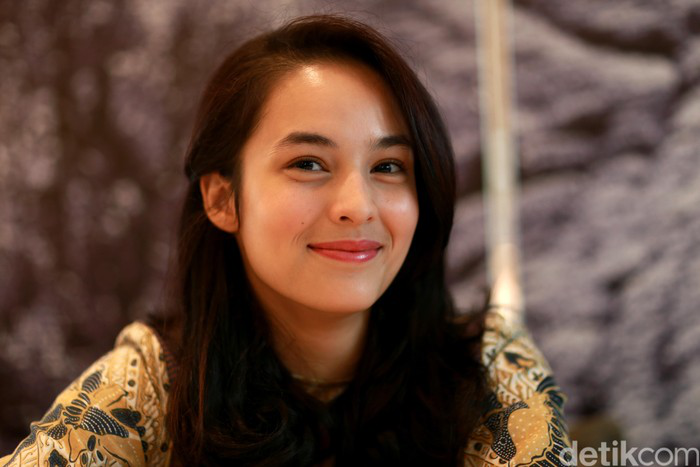

In [ ]:
readb64Recog(base64_string)

In [ ]:
def analyticsExtraction(base64_string, model = model):
    img = readb64(base64_string)
    try:
        #print('Face Extraction is running')
        detector = RetinaFace.extract_faces(img, align = False)
        numFace = len(detector)
        
        #print('Face Extraction is done. Numbers of faces: {}'.format(numFace))
        
        if numFace == 0:
            finalResult = [{'faceId ': None, 'base64str': base64_string, \
                            'age': None, 'gender':None, 'dominant_race':None,\
                                'dominant_emotion':None}]
        
        else:
                
            finalResult = []
            
            for i,face in enumerate(detector):
                #print('Face Analysis is running for face: {}'.format(i))
                analyze = DeepFace.analyze(img_path = face, \
                                           actions = ['age', 'gender', 'race', 'emotion'],\
                                               detector_backend = 'skip', enforce_detection = False)
                age, gender, dominant_race, dominant_emotion = str(analyze['age'] - 1) + '-' + str(analyze['age'] + 1), analyze['gender'],\
                    analyze['dominant_race'], analyze['dominant_emotion']
                
                recognition = findFace(face, model = model)['name']
                buffered = BytesIO()
                faceCvt = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                faceCvtr = Image.fromarray(faceCvt)
                faceCvtr.save(buffered, format="JPEG")
                b64_string = base64.b64encode(buffered.getvalue()).decode('UTF-8')
        
                result = {'faceId ': str(i), 'base64str': b64_string, 'age': age, 'gender':gender, 'dominant_race':dominant_race,\
                          'dominant_emotion':dominant_emotion, 'name': recognition}
                #print(result)
                finalResult.append(result)
                #print('Done processing for face: {}'.format(i))
                
        return {'numDetectedFace': numFace, 'result': finalResult}
    except:
        return {'numFace': 401, 'result': 401}

In [ ]:
analyticsExtraction(base64_string = base64_string, model = model)

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Already built model is passed
There are  508  representations found in  representations_facenet512.pkl
find function lasts  10.830541849136353  seconds


{'numDetectedFace': 1,
 'result': [{'age': '30-32',
   'base64str': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADvALUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxyOMIOeWqTzRjgdOgqAuRnnA9qcvVccYGa4mu5337FlHLHknPoKtIhIy2DzwBVdF2ke/WrsGScn6ACs5GsC5BH64+ma2LW03YLHA

## 2. Klasifikasi Image

directory

In [7]:
path2 = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/klasifikasiImage/Pisau pedang'
path3 = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/klasifikasiImage/Senjata pistol'

a. image scrapping

In [ ]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [ ]:
def persist_image(folder_path:str,file_name:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        folder_path = os.path.join(folder_path,file_name)
        if os.path.exists(folder_path):
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        else:
            os.mkdir(folder_path)
            file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=3000)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [ ]:
if __name__ == '__main__':
    #wd = webdriver.Chrome(executable_path='C:\webdrivers\chromedriver.exe')
    wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    queries = ["pisau pedang"]  #change your set of querries here
    for query in queries:
        wd.get('https://google.com')
        search_box = wd.find_element_by_css_selector('input.gLFyf')
        search_box.send_keys(query)
        links = fetch_image_urls(query,15,wd)
        #images_path = path2  #enter your desired image path
        #images_path = path3
        for i in links:
            persist_image(images_path,query,i)
    wd.quit()

Found: 100 search results. Extracting links from 0:100
Found: 15 image links, done!
SUCCESS - saved https://s2.bukalapak.com/img/2686079852/large/Pisau_Pedang_Persia_Ukir_Batik.jpg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/pisau pedang/9a43bcf2df.jpg
SUCCESS - saved https://www.static-src.com/wcsstore/Indraprastha/images/catalog/full//94/MTA-4737244/nuza_pisau_pedang_pamurai-pedang_tanto_natural_shirasaya_full06_nzsxbj38.jpg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/pisau pedang/da4be3d4cb.jpg
SUCCESS - saved https://s.kaskus.id/r480x480/images/fjb/2015/05/28/baton_sword___katana_pisau_pedang_samurai___ninja_blade_4127133_1432799994.jpg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/pisau pedang/4cd8778d40.jpg
SUCCESS - saved https://banner2.cleanpng.com/20180420/wle/kisspng-knife-blade-sword-weapon-scabbard-decorative-lantern-5ada15d1612f91.0233414515242418733981.jpg - as /content/drive/MyDrive/PCD/UAS Citra Digital 2021/pisau pedang/be951316a1.jpg
SU

In [9]:
# Menghitung banyaknya data dalam direktori
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(path2):
    #print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total seluruh file :',totalFiles)
print('Total folder :',totalDir)

Total seluruh file : 600
Total folder : 4


In [12]:
for base, dirs, files in os.walk(path2):
  print(dirs)

['knife', 'sword', 'buck knife', 'pedang']
[]
[]
[]
[]


In [ ]:
# Menghitung banyaknya data dalam direktori
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(path3):
    #print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total seluruh file :',totalFiles)
print('Total folder :',totalDir)

Total seluruh file : 204
Total folder : 5


b. rename folder

In [ ]:
# rename folder
def renamefolder(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        new_name = os.path.join(path, folder.lower())
        os.rename(folder_path, new_name)
    print('Folder name changed successfully!')

In [ ]:
# rename file
def renamefiles(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for k, filename in enumerate(os.listdir(folder_path)):
            file_name = folder_path + '/' + filename
            new_name = folder_path + '/' + str(k) + '_' + folder.replace(" ", "") + '.jpg'
            os.rename(file_name, new_name)
    print('Files name changed successfully!')  

In [ ]:
if __name__ == '__main__':
  renamefolder(path = path2)
  renamefiles(path = path2)
  renamefolder(path = path3)
  renamefiles(path = path3)

Folder name changed successfully!
Files name changed successfully!


c. unclassifiedFile

In [ ]:
# check corrupt image 
def check(path):
    folder = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/kumpulanPhoto/unclassifiedfile'
    for file in os.listdir(path):
        file_path = path + "/" + file
        getFile = glob.glob(str(file_path)+'/*')
        for j, filename in enumerate(getFile):
            try:
                tempimage = Image.open(filename)
                tempimage.verify() # verify that it is, in fact an image
                image = Image.open(filename)
                image = np.array(image)
                img = Image.fromarray(image)
                filename = filename.replace("'","").replace('"','')
                img.save(filename)
            except (IOError, SyntaxError):
                dstPath = folder + '/' + 'corrupt_image' + '.jpg'
                img.save(dstPath)
    print('Image has been checked!') 

In [ ]:
if __name__ == '__main__':
  check(path = path2)
  check(path = path3)

Image has been checked!
Image has been checked!


d. sampling image

In [ ]:
def sampling(path):
    for file in os.listdir(path):
        file_path = path + "/" + file
        for filename in os.listdir(file_path):
            img = os.path.join(file_path, filename)
            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #transformasi
            gray = A.Compose([A.ToGray(p=1)])
            rotate = A.Rotate(limit=10, p=0.9, border_mode=cv2.BORDER_CONSTANT)
            
            image = np.array(image)
            augmentations1 = gray(image=image)
            augmentations2 = rotate(image=image)
            
            os.chdir(file_path)
            im1 = Image.fromarray(augmentations1['image'])
            im1.save('gray'+ filename)
            
            im2 = Image.fromarray(augmentations2['image'])
            im2.save('rotate'+ filename)

    print("sampling saved!")

In [ ]:
if __name__ == '__main__':
    sampling(path2)
    sampling(path3)

sampling saved!
sampling saved!


d. transfer learning

In [13]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
import tensorflow.keras.metrics
from tensorflow.keras import layers

In [14]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import base64
from PIL import Image
import io

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
def trainmodel(data_dir, img_width, img_height, modelname, batch_size, initial_epochs, fine_tune_epochs,  base_model):

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels='inferred',
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size, label_mode = 'binary')

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels='inferred',
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size, label_mode = 'binary')
    
    '''
    class_names = train_ds.class_names
    file_paths_train = train_ds.file_paths
    file_paths_val = val_ds.file_paths
    intersection_set = set.intersection(set(file_paths_train), set(file_paths_val))
    intersection_list = list(intersection_set)
    class_names = np.array(train_ds.class_names)
    print(class_names)
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE    
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    #data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)])
  
    base_model = base_model
    
    base_model.trainable = False
        
    inputs = keras.Input(shape=(224,224,3))
    #x = data_augmentation(inputs) 
    scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.summary()
   

    model.compile(
    optimizer= keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])
    
    print('Transfer Learning is starting')
    
    filepath= '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/model/' + modelname + '-'+ 'TopLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_binary_accuracy:.2f}.h5'
    #filepath= '/home/apps/computerVision/imageClassification/terrorismClassification/models/' + modelname + '-'+ 'TopLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_binary_accuracy:.2f}.h5'
    #filepath= '/Users/irvanseptiar/MKI/CV/terrorismClassification/' + modelname + '-'+ 'TopLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_loss:.2f}-{val_binary_accuracy:.2f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
    history = model.fit(train_ds, epochs=initial_epochs, batch_size=batch_size,validation_data=(val_ds), callbacks=[checkpoint])
    print('Transfer Learning is Done')
    
    print()
    print('Fine Tunning Step is starting')
    base_model.trainable = True
    model.summary()

    model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])
    
    #filepathTune= '/Users/irvanseptiar/MKI/CV/terrorismClassification/' + modelname + '-'+ 'AllLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_loss:.2f}-{val_binary_accuracy:.2f}.h5'
    #filepathTune= '/home/apps/computerVision/imageClassification/terrorismClassification/models/' + modelname + '-'+ 'AllLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_binary_accuracy:.2f}.h5'
    filepathTune= '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/model/' + modelname + '-'+ 'AllLayer-' +'weights.{epoch:02d}-{loss:.2f}-{binary_accuracy:.2f}-{val_binary_accuracy:.2f}.h5'
    checkpointTune = ModelCheckpoint(filepathTune, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
    historyfinetune = model.fit(train_ds, epochs= initial_epochs + fine_tune_epochs, \
                                initial_epoch=history.epoch[-1],\
                                    batch_size=batch_size,validation_data=(val_ds), callbacks=[checkpointTune])
    
    print('Fine Tunning Step is Done')
    return model, history, historyfinetune

In [ ]:
data_dir = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/klasifikasiImage/'

In [ ]:
img_width, img_height, batch_size = 224, 224, 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, labels='inferred', validation_split=0.2,
                                                               subset="training", seed=123, image_size=(img_height, img_width),
                                                               batch_size=batch_size, label_mode = 'binary')

Found 1212 files belonging to 2 classes.
Using 970 files for training.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
if __name__ == '__main__':
    #base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(224,224,3))
    #data_dir = '/home/apps/computerVision/imageClassification/terrorismClassification/dataset/'
    data_dir = '/content/drive/MyDrive/PCD/UAS Citra Digital 2021/klasifikasiImage/'
    img_width, img_height, batch_size, initial_epochs, fine_tune_epochs = 224, 224, 32, 10, 3 
    trainmodel(data_dir = data_dir, img_width = img_width, img_height = img_height,  modelname = 'terrorism', batch_size = batch_size, initial_epochs = initial_epochs, fine_tune_epochs = fine_tune_epochs, base_model = base_model)

83697664/83683744 [==============================] - 1s 0us/step
Found 1212 files belonging to 2 classes.
Using 970 files for training.
Found 1212 files belonging to 2 classes.
Using 242 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)         

load model

In [16]:
def loadModel():
     model =  keras.models.load_model('/content/drive/MyDrive/PCD/UAS Citra Digital 2021/model/terrorism-AllLayer-weights.10-0.00-1.00-1.00.h5')
     return model

In [17]:
model = loadModel()

In [18]:
model

In [89]:
def predictImageTerrorism(base64_str = str(), model = model):
    images = base64.b64decode(base64_str)
    images= Image.open(io.BytesIO(images))
    images = images.resize((224,224))
    images = tf.keras.preprocessing.image.img_to_array(images)
    images = np.expand_dims(images, axis=0)
    prediction = model.predict(images).flatten()
    predictions = tf.nn.sigmoid(prediction)
    result = tf.where(predictions < 0.5, 0, 1).numpy()[0]
    if result == 0:
      finalResult = 'pisau/pedang'
      confidence = round(100 - (100*(predictions.numpy()[0])), 2)
    if result == 1:
      finalResult = 'senjata(pistol)'
      confidence = round(100*(predictions.numpy()[0]), 2)
    
    return {'confidence': confidence, 'result': finalResult} 

In [84]:
images = base64.b64decode(gun10)
images= Image.open(io.BytesIO(images))
images = images.resize((224,224))
images = tf.keras.preprocessing.image.img_to_array(images)
images = np.expand_dims(images, axis=0)
prediction = model.predict(images).flatten()
predictions = tf.nn.sigmoid(prediction)
result = tf.where(predictions < 0.5, 0, 1).numpy()[0]

In [85]:
result = tf.where(predictions < 0.5, 0, 1).numpy()[0]

In [86]:
result

1

In [87]:
confidence = round(100 - (100*(predictions.numpy()[0])), 2)
confidence

0.0

In [88]:
confidence = round(100*(predictions.numpy()[0]), 2)
confidence

100.0

## image data predict

### pisau atau pedang

In [23]:
sword1 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAENAeADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCvWPeWd9NF/wDX7e3v04712Hk+TL+Xr36/h16ce1Hk/vPJz/Lrj+WK5wOP0fTZ4Zbmfn149uD+XH4+9aGozX1nFb+R/wA/n/6vqf5HtXqHgnwT4p8e69p/g7wP4c1LxJ4o1Qap/Y+kaT/yE7/+wtF/t7Xf8/h9c/xJ4P1XR7q40PxJpWpaJrFt/wAflpq1n/Zup2H/ANb8e3FAHD2n/Eytbecf6P8A5/zjH05rqLPz5of38A/mP8gH6dKLSz+xxeRxnvn/APVz09K2PO/6d/1oAz5rOfyp/wDn4/l/n657d6PJnh68n/I/+vn/AAroP+WX+f7tY95++5x/o/8AnoP1/WgDn5+34f1rHhhnmit77/n1+n+c/wCcDqOpPkeb+49TjPp7Y7evt7VnanD5NriDp+Xf/Pp79q5wK81nBrH2e+g/0n0x6nnv1/l1rYs4TpkVx/z75/8A1D6df1x2NV4bITS+dAPs3+R79/8APrWxND+6/wBRxnt6f0/IevNAFeH97Ljn7P8A/r/+t/k1owzfuv3/APk+3T/DP51Whh8n/lgMW2eP89fwxn1qxDD+6/D+f9P1HWucCxN+99un6fn/AFrQhmOe/wBo/wA/p/LPPvXh/e+3X9Pz/rWP4kvJ9HtbeeDnj/J9cfTnntiugDoJv/Sr8PXP0/XHHTirB8iH9xnr0z29v6//AK6x9Nm+2WtvPb4/P64+vH5Gtjyf3v8AnPX6469/0xQBXvYYBF5//PryePz/AMf88V5vI5/H8/8A9X3a2JrMzxf5/wD1/T1PpWf9j/5eP0x+GP8AI9s0AZ8HbyPw+1fr1/z/AHq0IYfOiuDjn/IOP/1+lV/J8mX8vXv1/Dr049q0If8AW/6jv/L+WT165oAz/sfk/Z8Y/wBF6dP09/x/WrBh/wCW8/sR+ueo/D8qsed+9xBx/LH6cc/5PWx/07/p+v8A9fp7e1AGdef6ofQ/zNQQw/6/z/8Aj469vT8B0/L8eNCaGfyfp/ntx/MVXh/5ePwoAsVX/e/53VYm/wCXf8az4YZ5pf38A+zf4Z9PY+vX8aAOX16H90PPP+j54/zn+f4Y61z+m+RDa3E+PtNxa+/54/zj8a9I1Kzg+y3H2icf56+3H/18Z4rHh8NwQ/aLjz/tOf8AOfwPr/SgCvpv/Extft3n/wCkWo6np7fr7e9F5eeT9ng8/wC03F1x9kHtjr/j/kGgw/Y7bUIPI69f59P8+/es/wCxnUpbcf8ALxa3n+cd+M+tAGx5PnWFxB+eemf5fjzXn9p+51TT5+c/5xj+f+efWIYfIiP5A/y6/wCHb1rj5obea/uJzASef+PT6f8A6u3/ANYA5fxJpt/NdefBjH2P/TemMY/z9O3eug8Hwz2dh9nvuf8AI/pj+lbBME0tx5//AICcf55/HHHFF5/of64/yMdf89eOc6DPvPP83z4IP/JP8+/P9cVn2d5P5Vv9u+zXNx/y+c/4/wCfb02bOfzvtE8HfH+fp/npXDalNfQ6pcQeR/o9r2x9Af8A62KANC8vJ7O/t/Ig/wBHuenHrk4/x6+1Z15595a/v/wP64+nWuhvPIvNL8+CC5zn+vb254/PtXP6b5837g8f8+d39fc/07/jgAseG7OezhuJ58Y7fy5P5/49K35puP8AXj7Px9D9fp+VQeTPDaeRP/pPpd+/f/I/rVfTYZz+/gn9v8f0zn0oA6D/AFX+c5z+Xp7dPzr/AOul/wBR6/iOnP046+9aHE0Xa4/z+Y6/r7Vgw/8AH3/n3oAzZ/8Aj/5g+n8z/hj8Peq8376K4hn9+v8An/D8ia2LyHzvtE8HTjscZ6HJ7/l+Vc9N/rj9R/OgDIvP9C+0eT/nH19cd/0qDR9Ygm/cTfaftHf9P89O9X9S/ff6/wD/AF/49sdOvtxy2m6PfQ39x5H/AB7c4u7v8evTv610AdxD/qe3T/l069T09qWft+H9ar2lnPDEfXPb249/88DNF75/lfuPwz198/j+vTiucDHvD9stZ4IJ+Lr8Pr6cdR2/QiuH+xzwyiD7QP8ARf8Aj8+1jjPqD/k/nXcQ/wDXD1HX8eT+Xb2qvefvpcfzAxj8/wAaANCD7P8AZbf/AK8+PT/Pr/hivN7zxIYNU+wiD/R+fX8z6/yrYvNYnh+0f8u3/wBYc9ce/wBee1Y954Vn1i6t76DFsPr/AF9Pfp0roA7ab/j0/wA+1UYYof8ASOP6/wBP89q0DZ/6BbQ/zP8AP/Prx3oNn50X/wBY9fUf0xj39aDnM/7H53HT9fw/HPXPt3xVeGH/AD/n9Tj2ArYs7PyZe309cemP0/8A11X8n/S/9r/PvjpQBY8nr5/+eue/+eTnrVfyofT9D/hViaH/ACf8/kceoIqvNB5Mvn+R/pB/Pkfl3z/jxXQB7R9j9v8Ax6jyf+mH+f8Avuq/neTL+fr36fh068dea0PO86LyO2P/ANeM+3X060AdR8PfGF98PfG/hfxxY/aTcaDrH228+yf9Arrrv/luf24Ov5V7PP8AtLaXoPxUsPDfx10u1+J/wB1/V9M/4SM3oLeOPCOm66Djxr4I1oMnijQfEIOCVDJ/wmwyNynkfNMP+pH0P8q4bxVDBqNh/wAI5P8A8fFrzo93gf6fpf8A0Bf+5T/zigD9r/iz/wAEzbjWNG0/4gfssfEXw18YvB+vaQfE/hvw9d3mjab45v8AStcbj+w9dIHhjxBuGCf+ROwcjJHJ/LjxV4P8VeCtZv8Aw54w8O614S1+1u/9M0nxBpGs6dqdiOORofiDg9ffrz2ruP2Ff22L74D31v8ABb4t6rqQ+C+qaxjw34h/6JLqmOfr8O//AK59q/ot8W2/gL4k+E9M0v40eGfDnxX8L3Fob3w5r90qnxJZ6WVcDWPBXjjQAW2qxVx5bxsWQAsULKwB/MEIfOl8jvan+vb19/aiazn/ANfcfp+H+Rz7+9fqv8Tv+CfGla+dR1T9l7x9b+LQFBHwp8b3g8N+OLHJPy6HrgJ8NeICuBnIA5XaWOQv5weKvB/irwJrOoeHPGOh6l4S8QaXn7Z4e8QWZ03U7D6/nQB5vN/rf9R37+/88H6YovLIXlr5H/LzwP145/nyP04sTQ5l/f8A+eO3+c/SrEP779xAP8g/p9Oo9a5wM/yZ4Yj1OPz7/h6dMf4bEP76LHOevb9Of/r555qv5UPp+h/wqvCfJusc9Pb/AOv/AF54oA6DyPf9f/rUeT+6/wA46fXPTv8Apmj/AFv+cYx+fr79fysQf8u/n+2M/wBP06++K5wOf1LWP7N1SCDrb3Qz2/z+H5c1oaxD/bFj6Y9v89fbANJrGjwalLb857fh9f6dK2fI8m1uIPTr2/D+WenTpmugDP0Gz/sywt4B0/MD9PUjjn1+uxDD/n/P6nHsBVjyf3Vvk8f4/l/THWigCv5Hv+v/ANaj/Vf5znP5ent0/NZv9SfoP5Un7r/O2gDPmPHkef8A6QB/P/D+varPknzc+R9p4/z/AF/+vwaseSfN7/8Ab3j+fvx/npP5I8rtbc9uvHp/9f8A+tQBn+T+6/8AbTnr/LGP070Q/vosc569v05/+vnnmrE/b8P61n2dmYf9R/o/2r/OMf5I96ADzZvX9R/jVebHlfuP+PjHP+fp6V0HlQ+n6H/Cs+bP+on/AOPf8OP5cj8KAM+zhnm+z+eP89/XrnqaJpvIiH5kfz6f49vWtCGGCz/cdf5fl+A9O3FcvqWj/bL/AE++/Gz+vGeR6jJoA0Ne/fWvkQdeOn+f8/yr6bNB5XkXE/8An9M4/wA+xNDPNawfuPraf5H+OaNN0H7HH5//AD9cHn0+v/6x6+oBYm8jyrnGP6/h79PxzXPzWc8Mtt5E9t/pR/0z7J/n8fT+daF5D9s/tHz/APybP8v/ANf/ANazZ2fk/Z+gP/1/8+/T8QDOs7yeb9wc/T6c8e38xVeez86K3/cf8ev+mkfl7ZP4fXiugh03ybq4n8//AEe69ef8cD8B9aJv+PXz/I57e3/1v89DyAc/DD+9t8wf8fWf/wBZx+P+Oa0PO+1/aIMf6R19f0/z+lY88M/2r9xP9m6dOO3P+f06VX/fwS/uJ/8Al8OMf/W9fb3xQdBYs4P9KP8Az7j/AI8/8/pWhNo8F5+/6fn9Onp/h9Kx/tk9nL/pH/L1/n+f8+vBrZs7z7Z9o/0jr+nb8+PX8+/OBWs4fJiuLcnp+vpj/PSufvNS0OG//so6rbW2ofYze/ZPtn/Ez/svnj/P1PArqPtn73pz+n1/Pt69s1x//CK2J1/xB4q/0nUtQ1T+y7Kz+12ejf8AEh/sLP8AyA/Xp9e4oAs6lN9siMA/zyOfr/PFEP7mx9bi6/z0/qPWq1nZ332q48+D154z05/+vzmlhs54Zf8ATs/Z7o/6Hxj/AD+PTmugC/DeW9mTBPP/AKR2P1yfqf8APatCGH91+H8/6fqOtef69ps82qW/kQf6OP8A6/8Ajn+np1Gm3k/2TyJ7f7N/199Pp7cdPTP584Gx5H7r/U/6R9eOv+fxrj9YPky24z6+mMfj+n5e9dR53kxfl6d+v49enPvVf7H53HkYz29Px9/THGcUHOcv5MB+z+f/AMe/ryf6f/X/ACqx/wBPH6/p/wDW6+/vWhPZ/uvW4uuO/fv09O470fufK8jyPw46en+e/FdAGP537r/OOn0z07frmrHMB7fZ8fmP8/n/ACrw/uP3Gf8AP69x/ic1Ym/54Y/zx7f54wO1AGPe2Xk3NvPB/wAvXf8Az049OvU1z/iSe+hit/sOPtH2zH+Rx2/n2ruP+Wv+f71cteeR5tvP/n0+hB4/lQdBB/YNjeTfbp/+Pj/6/wCP+efStj7ZBDL5HQnnj+vT34/WjzvK/wCPj/nz6H6/4fj17Vj+T50v5+vbp+HTrx14oOcsed+9/wA56/THXt+uKIf3MuOMde/6c/8A1sc8VofY/wB1/r/84+men6e9Z80I+1ef+Pf3/wA/gaAE8k/9PP5ioP8Alt/qPb/6/wCff17VoQ+Rn7RPBj8j0/D8f8iiaH/lvB/nvg4/Uf8A1jXQBXm/575/zx7/AOeMHvVf/lr/AK//AEn689fr+n60VXm/1X+o7d/b+WR9c0AekQ3sHm3EAntvX8fp0x/k5NaEN55MR5/0i69/5nkY7/XpXP8A9m+dFc/6P/knB5z/AJzWhDDP/o/+e3v/AJ9cjNAFia88n9xyPTqR/nP5/jXL+JIv7SsPI/5eP+P2zu+1h/np/nnYvIZ5vX19/wD63PpyfrWP50/m/wCfX6Z9v/r8UAfJ/iTxJrmg3/2HXLH/AEjOftZHN/247Y9jn3r74/ZQ/wCChHjH4J2Gn+B/Ef2nxt8Hzn/inru8xqfhLj/mR+/X/mVvr0r5/wDEnhWx16W4sdWg+02//Lnn/kJ2Hfv/AJ+tfL/jbwfqvw9l+3f8fOj3WPsd2f56507D60HQf1ceD/ip4H+Kmjf8Jj8K/FVtren9Pslp/wAS3U9B/wCw5of/ADL/AKepJ5r0jWPiRpXxC0a38HfHfwdpvxb8P2ufsd3q3/Et8c6D6DQ/HH/Iz+H/AH9u/Wv5KPh78VPFXgnWbfxH4H8R6l4a1e2/489W0m8/X/D359q/U/4S/wDBQ7StYFvofx30P+zdQ/6HfwnZ/wDEs+muaGf/ANXuOpAPsjx5+w2PEn9oa5+zZ4x/4T+3uv8ATv8AhU/i3+xvDfxMsME8aH18MfED+n6V+f8ArGg654a1nUND1zStR0TWNLvPsV5pOrWf9m6nYf8AcD79+/Ffpx4b8V6V4k0u38U+B/Eem63o+P8AQ9W8O3n8+OmfT6+gr1DWPG3hX4qWFv4c/aF8HW3xIt7Wy+xaP4t+2f2b8TNBPP8AyA/HH/MwY/6FbxZjvQc5+M//ACy/z/dqxDD/ANN/XP6c/wBMfjX3v44/YXvdQhudd/Z18V/8Li0VQb698K3ln/wjXxe0AAZJOh9PH4AB58KYA6/8IRXxRqWg32g3+oaVqtjc6brGl3n2K80nVrP+zdTsPy4+nfI68UAV4f8Apv8Ajj9c4/z19qsD/XXH+exrH86eHpyf8n/62P8ACrEUPXz/AK4x/P8Anz+dAGhDD5v/AC3x19P/AK/4/wCRVjyofT9D/hSwQwQ/6n/P+P8A9ep5jbzcm3/T+X+enrmgCx5P7n/X/p/s9f8APbtmjyZv+e/6j/4qrHk+dF+Xp26/j16c+1EP7326/p+f9a5wM/yfOxn/AI+Ovt+v9fw4qx5UPp+h/wAKP9Iz9o8//py6c/5z/hRQAf8APzP9eD+vT/PpVeaH/J/z+Rx6gitD/phB7jg/l/n/AOuarww/5/z+px7AUAZ/k+TF5/bH/wCvGfbr69KK0Kr+T+9/znr9cde/6YoAg5hh9x+HX+v5HJ7Gkmh8+IfkT/Pp/h39asTQ+fEPyJ/n0/w7+tV7Pt/wKgDPhvP3vkzz/wCke56HP+f8asT48r9/nOe2emf8/j05oms4BdfbuPtHT/8AX/MD8TVDUvP839//AMe+ffPt+Hrnn9KANDzoPf7N+nX0x/XpVaaaD/SP89/b/Ppg4rPspoDL+4P2njr/AE/lWh5Hv+v/ANagCv8A8srjEHB/z74/XNE3n+VceRPn8/8AI9f60TQ+TF5/A+y/5GOMH6/j3os737Z9o86f/R/z/wA5/wA80AF5N5P4/wCA/lVeE+da446+/wD9b+nHFdBew+dEBP8AX/D/AD+uOufD5P8ApHp+H6d/p+HagDl/Og+1XH7/AP0g9P8AI/DPSi8hghl/f/8AL1x6fp+npxx0rPvIZ4dUM/5n04/X+XvR4khuPsGnzwf8fHb+h9f8+/IdBY1KHz9Lt54On4duoPt0/HkCq+jzW/8AqIP+Pe1/x74/Kug03z/7LufPuPfnjv3/AD/XGeK5/R7OeymuPqfwz/hj/PFAFibyIZfPggP2j/n778fif6irFnNBNFcT9Pw/L1HTk89/Wi9s4Jf+WHTH5Z7/AOfX8U+xwWdr/qD/AJ/Hp+PSg5yD7ZBNLcQW/p+H6/j+P6k9n50vkeQfr9Pqe59/pniuH/02z1m3+z9+ff8ADH0NesQd/wAf6UAYH2OD/njbfk3+NVpv3H+o98f/AFvXPPXp+VV9Ym+xynyJ/wD9Wfb65/THWughsoPK8/yP9I/x9+OPx7ck0AY8MPm/5/zz171Zh/1I+h/lU/8A6Vf5/wA//Y1j3n2j/SPT/PT8P69qAFmm/dfuP8n36/4Z/OsY/wDLz5HvnP49P6//AK65/TdSnvJdQg8//PP1zjv/AI9bFnN511qMH/Pr/nn1z/h+HOATTGGXzz9fw/zx/nNV7y8/69v89OPr/PAzVnyYDFcfaP8AI9OR3qtND5Eo/In+fT/Dt6V0HQTzTD7L2x/n8+3t0x1rAs4YJvT19v8A63HrwfpWxeQz/YLjH2nP+f8A6w/+ucVjaaTFL/qM2/8Az98fp/T9MUALqU3ky/uP+Pf/ACB17VsWc3+i28/r35/yeB+vpRNZ/bM/uP8AR8fj+Pf1/wDrCiGEQxeQIP8Aj17/AP6s/j/j0DnK959umi/1/wBm+n8vz/8Ar1gfv4Zv389t2/r/AJ6+ntW/NN+9/H+X9f0PSs+aH/J/z+Rx6gigCxDD5378k/aPQ89jz/nvVmb/AFJ+g/lSQ+RDn6emcYx6dvr1/Oq8Pnwyn9//AJ/Dr1/HpXQBXn7fh/Wq/ndPIg+n8hnj6dvxommh/wBH/cf5/L86JpvK/wA/z9unagD0j/r3/wCA/wCT+HX8O1GP+mH6/wD1q6CHyIYun+SfX3696z5of8n/AD+Rx6gigDHmhnmNxB07en8vf8Pbmsezs54LqD/n34xj/P8A9f8AQ13EMJz3+0f5/T+eOfYhs4If38GOmPf/AD9Qe/tQBjw2nSf9P5f/AFhj6HvXP+JNAsdesLjSr6xtrm3urP7F9k568Z/Dnp+vp2E00GPI4/zxn/H8+1WP9d+49f8APXPbHT2xQdB+V/xC+G3ir4S6pcX2lfadS8H3V4DZj/nw9fw/Q/hxB4V8eaVqX7i+/wBGuB/9bpx9P/rV+m+saDY6xYXFjfWNtcwXVn9ivLTv7fX/AD64r87vjP8AAe+8E3VxrvhyC5ufD11/y6EA/YP8/wAqAPWfAfxI8cfDfVBrnw58Valolx/y+/ZLz/iWX/8A2HND7gdfbrmv0o+E37fnhXXvs+h/GLSv+ES1D/jyPi3SLP8A4pm//wCw4P8AmX+gwOnUV+B+g+MNc0GUQef9pt+9pd/h6/59q9w0HxhoevfuJx/Ztx/z6Xf1z6fnx9K5wP6iPDfiSC8i07xX4N8R2upaeP8ATbPxD4e1j8f/ANXavcNY8d+APjBYQaH+0L4Ht/G32az+x2njfSifDnxN0E4C4Hjg8a8Bt6eKwATliCzEn+Xf4b/E74jfCDVP7U8AeI7nTQP+PzSf+Qlpl/6f8SPv/XP5fqB8Gf25Ph/48l0/Q/ibY23w38Yf8eX2vj/hBr/VPfW+P+Ef/L6DvXQB9TeOv2FtdntJ/FX7Pvii1+Nfhm1Avb3w8LT/AIR34u6EcKT/AG14Jwp8QjcSo/4RVUJxkIByfhmbTZ7S6uLG+guba4tf9BvLS7/4lup2H4H/AD171+lGj69quj3Wn65od9c23S9s9W0m87f9QPXOxx+POPevUNd1z4Y/Ha0ttP8Aj54NGoa+oFhY/FbwiBpnxL08KAANbAx4X8fgAYx4rwMDgDFBzn5D0Q/8fXkZx/j36dvx/OvtD4hfsZ+ONHsNQ8VfCu+tvjH8P7X/AE28u/Cf/I8aDpfA/wCK48D/APIz/wDhKf8ACY/hXxvzDddsf5+vr75+tAGh53lfj7f5649+n5nnf8fH4Y/+t+uB+JqvB3/H+lE/b8P61zgWIfP8r/OPf2xjFHk/9PH6Vn2c5hi8ifP2f8+9Z955EMfn4/0j6D69un/6x2oA6fyT/wBPP5ilh/1vkf6SR/T+Z69v/rVy+j699s/0Gf8A1/v7H1GP8frXUedP5v8An1+mfb/6/FAFeYeT1gJ/z/P/APV1qv5/t+n/ANerE03my2547fj/AJ/w+lV/J86X8/Xt0/Dp1468UAWP+WX+f7tZ801xD/yw7+mfbjOT+tbEMM+fP5/zzj/D8u9FAGf/AK6K3HP+fx/r71n3ln9s/wA/nx+fUfmDWhD+5+0Z9vx/ljGPbp+dj/tv6f8AH3+Y/wA/h70Ac/Z2UEI/+S8fX3/Tj0qvDqX+l+RODn8ef8D6f4VszTeTLj/lh+X49Pz/AJ1jalD+9t//AKx5+vY/yPsRQBXvNT+2S+RAPs2Lz/D/AD1/pXL3epTw3VvD1+y/8vf/AOr8e309tCHTZ/Nt5/8Ap8P2zv8Al+uR7/hWxqWhWN5+48j29PXr9f8APag6DY02b+0tL8//AJ+j/wDr6/yrPh8iD7TBBOPtHTr68/Xr09u9aOj2cGm2FvY+f26Hr+n0B9feq0PkQ3XkQfr26/57/Sg5yveQwCU/8/Hpj6d+f89Kz9Sh86LyJ/8ASbfP6/rjnGPxrQ87yZfz9e/T8OnXjrzXP69qXkWvkQT/AOkfX1z+H+c0HQEN5PDNcQQQf6Pz/M/54/oK0LOE+bcQfn04/wA5x/8AqrP02A/Zf9f9q+1WZ9/8/lVieaDTf3Hn/wCkn369z/T6j0zQc5seT50Vx5P/AB7jjHfH+Rg/zo+x+3/j1V7O8MUp8g/afY/5NaE0083U4/T/AD/KgDPhs4P+eH+e/wDTPP0NF59o8q4+zz9Ovv27dR36irE5/wCm/wD05cf/AF/zH6+tV4f30Vv/AMe2PT1z+P8AX09aAOPvNN87j/I/+tj8PQYrqIZ/3Xkef9m7/wCGe/5enFWJv+Xn/gFZ95N+6uMY/X/J/kfwoA5/TbyC8luIP+Pr6env6fn+dZ8Jnml8jr9fc/556dR0rQs4fJ7XFtn/AI/Ov8jzx/Wq8MP738f5f1/Q9aDoPL/Dc3/FR6hB5/b6dP5++PXvViG88nxbqFj3urPPtx15z16/496x9Hh8nxlqHvxz15x/+v8ALr2NY+w6b4ot764ntftF1/x5/hkenfB6dK5wPUJu/wDx7dvr/wDr/pWfN5H+kT+vP8vz/wAOtaH2ywm+zzwT/abb/PA+n+fSs+8/cxY/mDnP5/jXQBn2cME0VzD5/Ge3uPcf59B2sfuM+fB/9bofz6df1NWLPz5v9H/z/TPT16elWPJ/c9f9G69P06Y/+t2xQAed+6/zjp9M9O365rHu/I83z/b2/l3+nb8saH+q/wA5zn8vT26fnz83+mXWIPz/AM8n3/woAsf66X1t/wCeD+uP1/Cq803lf5/n7dO1Hk/uv846fXPTv+mar/8ALT9/npx6dPf/AD+lAB5/t+n/ANeq/wDrf84xj8/X36/lYhhn69v/AK/+Ptj16jFiHzv9I9fx/Tt9Pw710HOZ837mL9/0uvYZx+f+fwo87r5/+eue3+eRjrVibz+fx/L/APX92iGHz5T+QP8ALr/h39K5wPUPP9v0/wDr1Y87H+v/ANJP+emR/nFZ80PnSkfX/wDX3/8ArVYhmx9n/cZg7den+fr6V0AaH+pl/wBf6/gOvP146+9WPJ8j/Uf5/kT/APrPeiH977df0/P+tWPJ8n/lvnPtnr+XpQBXns4Jf+WH+f8APp+dZ/k/vf8AOev1x17/AKYrYqvP/rfPwDx+Q/U/l/8AqDoDEE3/ACw/49e/tz6H2z+dZ81nBeRCC4htvs//AB5Z+vp+Pb69uK2IZ4P+3jHHr/Lsef5VYn7fh/WgD4P+LX7NNveS3HiPwPB/pH/L3pP0/Lt0+vFfD+paZfabLcWN9Bc21xa/8/nc/wD6+OK/cDyf9fCYPX/6+f8APsa8X+J3wZ8K+PLUz3GLbWCf+Qvaf59f/re3OB+Y/hv4ha5o5t4Lif8AtLT/APn0u+2f8T+A/GvaNN8V+G/EkX7if7NqH/Ppd/X09/8AGvN/iH8K/EfgO/uINVsbn7P/AM/doOv4f5Pr148vh8+H/Uc/p2/+v2/TpQdB+lHwk/aK+LfwSmt4PDmq/wBt+F+t54S8Qf8AEy0sf9gPr/wj/r9Oa/UD4S/tjfCT4nf2fpV9P/wgHie6/wCYT4hvP+JZf/8AYD1wd/rg9q/nn8N/EjVdNi8i+H9pafx/x9//AFvyOPfjivYLPUvDniSLz9Ln/wBIP/LoPp/T6ip+sryMfqz8z+oDR/EmueFb+31XStV1LRNQtf8ATbPVtJvP7N1Pj19Pp/Ku38SXnwd+OX2iD40+Df7N8YXR/wCSsfD2z0bw34m/7jmh/wDIsfED/wBTTvX87Hwr/ai+MXwZFtpUOq/8Jb4Ptf8AmU/EP/Ey/wDBHrn/ADL/AG68fpX6cfCX9qj4V/Fr7PY2N9/wiXjD/oU/FmNNycf8wPXM/wDFQdeP846jlPR/if8Asd/Ezwfplx4v8Dz6b8Y/AFri9/4Sz4fWZGpaFncQPG/gjH/CTaARtJwD/wAIYq8sACCfkiv0o8K+JPGPgnVP7c0PVdS0TULU/wDH3aXn9m6nz/LuMD6devQeJIfgR8eMf8LU8K/8IB45uunxY+GWj6Npv2//ALHjwPn/AIRfxAfr/wAVpXOB+X/kwTdeB/kf/Xz/AI1jw2fk/aIJ8cf8vfT+nr+H6V9b/E39kz4qfD7Sp/FeljTvif8ADcgE/EH4Z41LTdPOBxruhgnxL4fI6E+KyRkcEjFfMFAFf7HYwy+f69Px+vX8cdcda0P+Wv8An+9R/qv85zn8vT26fnXvPtxi8+xgtrnUM4/0u8/s3r3/AF45/Og6Ct/y9fv/AMP8nv8A0/CrMP2f/Xn6fh/kf/W4NV/3/wBlt/PzbXH/AE6d8Y6+n16dq0fOEMVuP+Pk+n19f89KDnJx/wAu/ke2cfh1/p/+uq/k+b+Hv/npn26/kedB5v8An1+mff8A+vzR5373/Oev0x17frigA8n/AKeP0o/cTRfT6f5//V27aPnW/wDz3P8An8axpv8Arv6Hp+HA/Pv70AV9S/1Xn9P6/Xnr78fyxn+d9s0u4579z/8AW/Lv34zWhND50Vx/y89evGffPY/5HWseGGeGLrz/AJz0/Hj29KDoLGjzweb5HT+X+eQfSugP2fE/kfh6fjj/ADnNcv5Pk/8ALfOfbPX8vSug82H1/U/40AV/3/2W36d8en/68Yx7Vz/2P7HL5/8Az9cdun4/hnGP0rqJ/I8ryPP578ev6+3rx+deb99FnnPTt+vH/wBfPHNABNDBNa/8u3+f6/41y95o8E3vcfh/nr3B9hzXUTQj7L2x/n8u3t0x0rH/ALSEN15E/wDkevf/ADxXOBz+pQz6Da/8u2On/Hn7f579sds1jz+fNF58/wBm74+v55/z716ReQ+dL+/9h/8Aq/nx+VY402CH/lh/9cenbGMUAZ8M3/Hv55+nH8v0x/8ArrYhm8+I/mB/Lr/j39ar/bf9J8jFt/ntn1xzjFaH/LX/AD/eoArzf9d/Q9Pw4H59/erGP+mH6/8A1qzpv9cfqP51Z8/2/T/69AFfyPf9f/rVj3k37r/p4yP8/wA8nHr1xXUf679xB+HX14H19/X0NcvqWmwXn/Pzzm8/0Ttxnjn9f8a6AM+f/Vefgjn8z+g/L/8AXj3l7BpsVvPff6Nb/bBZG7/58Pf6c9/5deg86Ca1t/3H2fGDnP1/r1PpXL3kMGpWtxYz2Ftc291/x+fax7D8c1zgeTzeD76HxvqGuQf6T9q/5e7v/lw7/wCee3c10+veG/7Y+zz/AOjfaLX/AJe+nX2H8wOcV2MMM/8Ax79/89/z/pVjyPf9f/rUAY+m2fkjz77/AJdf+XT9f/1/zrQmH/Hv+49e/wD9ai9m8mLz8XNz/L8M/wCcdKxrO8/tK1t74/abW3us+vb9OT/ntQBszeR5p+z+vfHTH8vp/Oq80x823/8A1/4d+MdvpR5P/Tx+lE/b8P60AZ83+t/1/fv7fyyfrms//W/5xjH5+vv1/IvJvJiwev8Ak/17d/bpj2epT3n+v/Hp9fw+v5iugC/51v8A6jI/+t0xn680Tf64/UfzrIvP+Pr9/wC31/zj9M9sVsQd/wAf6UAV/O87/lh9m9/tnT368df84xWh5/t+n/16B5EP7/HXrjt7/wBP/wBdV/3v+d1dBzlj/ll/n+7Vf/p3/T9f/r9Pb2qv5/t+n/16n/f/AGryPI//AFevT9ev4cUAeg+dn/p5/wDrfl/XrnIoh/57z/kR9O+f5flVfyfI/wBf/n+QP/6j3qx/yy/z/doA0Ptn/HtAP1/T/wCt+VaHneda/oOvr+fv6cVy/k+b+Hv/AJ6Z9uv5dBD5HH4fn/8Aq+9QBX86eaX/AF/8/wDIA/z0OdGz/wBTP9P6Cq0NnmXz/wDn6/If/qP+etaFc50Feb/nvj/SPwzj/H+eO2KIZvUen2wfyA4/l/8AXomm/dfh/P8Ap+o6Vz/9pT/avIn9uo/DOOv8vw7gHQQzf5/z+oz7g1Yx/wBMP1/+tVeGb/j3/wA/Xgfr+XpXQw/6kfQ/yroOc8+17wrY69a3MGrWNtc291+f+ccf/Wr4X+Kn7NM9n9o1zwd/pOnf9An16/h1r9IPNh9f1P8AjXP3lnB/nj6fy9Ov5VznQfiPeaPPpsvkTwfZri1xj/D/AD+IzRDeT2cvnwT/AGa4/r/9bH19QR0/UD4kfBPw542tbifyP7E1j/lz1a0/p6+nbtXwP48+G+ueCb/yNVsf9G/5++B/T/OfpXOdAaP8SL6z+zwar/xMrc/+DP8Az/8AW+g9Ys5tK16Lz9KnP/uT6fkentwea+Z/I9/1/wDrVYs7yezl8+Ce5P8AT8/0Ht70F/Vn5/ifph8LP2uvi38Jfs+h+I5/+FkeB7Xj+yfEN5nU7Dr/AMgPXPyPr/X9OPhX8fvhl8Zorf8A4Q7XP7N1/wD4/bzwR4ixpvibr6/8zB/3Kf4+h/n30f4hefF5Guf6Tb/8/f8A+r19859sV2EMNjef8TXw5ff6Ra/6bZ3dpj+1LD/J/EV0HN9Wfmf04eCPiP4x+Huqf2p4V1zUtEuPX7Z/x/8Ar/bn+fp611HiTR/gD8ePtH/CY6Hb/BPx/cn/AJKF8PdHz4Zv/wDqNeOPhYf5+Ez369K/Df4S/tveP/BJt9D+Julf8LI8PkfYv7W+2f2b45sNLHPHbxB2/wCRsHJ9ua/Sj4b/ABU+HPxasLe+8AeKtN1K4/5fPDt3/wAS3xNYdf8AmB4Gf8j6hymd8Tv2avi18Jrb/hIr7S9N8bfDj/mD/E3wRef8JJ4Gv+n/ACHAf+Rf8Q/9Sv4rOM8dRx4R/qv85zn8vT26fn+hHgP4qeOPh7f+f4c1y5037V/oV5af8hLTL/S/XXND5/4SD/8AX7mug8SfDj4EfGsG/Fjb/AvxzdD/AEvVPCVmNR+Gmv6qB01vwOSvibw+T0H/AAihA9fBAByAD8v7zzz9n8iD9Pxz/TirH/LK38+f/P6c8k/Ue1e4fFT4D/Eb4V/Z77xVof2nwvd/8gfxv4TvP+Ek8Da9z/0HPD/tnjxZ07+tePzQwde//wBb/D2z6dTgA5+GbyJT+YH8uv8Aj29Ksed+6/zjp9M9O365qtND+9uP+XbnoePy6e/FLD/zwn/Mn6dsfy/OgCxVj/ll/n+7VCabyZv3Hb+nsM+9TwwnPf7R/n9P5459gA/feV/+rH+f/Zarwzed+4/5eO/PP+P/ANf6mrE/b8P61z8008P2ef8A6fO355/z6ck4NAGx/rov9R6fienH056e1WPI9/1/+tVfzvN/D2/z0z7dfy0P+WX+f7tB0FfyYJ5bg8f5/X3/AC9cUeT5Hf7R2z/Xvn/J70Q/898/559/885PerH/AC08j9e3T8+n+e9AGf8AbP3X7/8A0b/EfQj0756D6VjzWcE1/bzzz8+v9e/U8fj74rQ+x/8AHz9o/PH4HkVXmh/enObn6f0HH+cUAE155Mvkf1/w/n+VE15/n+XH8x+PvRMPO/f/APLx2+uPf39/zPXPm8jyoM/h6Z/z+lc4B/rvtE8H+ef8Rz39TzitCzmnmi/59jnHX6f5P8sVz9nNPNLnyB9R/Q+ufbHbitCGaCGLz/8Aj29/y/p/+rrQBofuPO/1/t7fX+v1/OqE3+pP0H8qzprzM3n/AOff8OnbrzVjzoJoj6/qP898emc0AaHmz/6+D8vz/wAj1/OsebmLyJ/9Gt/x+n0+tHledF+4/wA9v8+3FbBmnm+zic/6P9j/AJn8R7f5xQBjz/8ALxBn1/r1/lwfwrPm/c4873/TPrnGP/1V0EEME8tz/wBOvTvjPb/6/wDkZF5DPN+48gfZ8enoPr/PjqKAOV03WLHWPtHkT/afsv8Ax+c4x/8Ar962Zof3Vv8AuOPf6/4fpRpvhuDR/tHkWJtftV5/pn9fw+vH07bE0NvD/wAt+3rn34zkfpQBw95D/wAsJ/0/P/8AVge5qvDD/wBN/XP6c/0x+NdB/rusAtrjnGPw9O3Uf1rPms/3vEH8v/18d+poAz/PHmeR/o3056Yx/L/Oar+d/wBN/wDSLrH0z/n1960Psf8Ax8fuPy/n/LGPwNV/Kh9P0P8AhQBz95D51r+//Gz5Ht/Qdfy6Vz+mabe+bcefP/o//Pofr/n8fpXcTfZ/9ePp+H+T/wDW5FEMMBluB5//AC5fbfQ9fy5/X6V0AZ95o/Xzz/njOTj8+PrVfUpvscPM9t+Xvwf88j0rYvP+PXyP8OP17/zznNY95o8GpRfZ5/8Al1/59OmOOv68/lzxQAWeJovP/wCXj26n1/n3Pr65om+0Tfv+3boc+1aFnZ/Y7DyP8jr/AJ6/1oroOcx/J838Pf8Az0z7dfysY8n9/wCRj2x+Gff/AOvVift+H9arw/6rz/P/AO3T3/8ArH6e2aAO48/2/T/69EMM/k/X/Pfj+QozD/z7/wA/8KsQd/x/pXOBnzQ/5P8An8jj1BFaFneeT/Q888/z/XOeKr3nf/gNEP8A0w/DH6Zz/nr70AbHn+36f/Xqf/SPsvb7T+n+HX/OKoQ/vorcdvp39Ov9asedPD/y3znn05/+tj2oAr/8ecvkfh26fyPPp71Y/s3zv+WGe3pnPH+enX3qvDNBN+/ng478D3/D8ev4cVY/fw+o5+pBB/z69PagCx5Pk/8ALfOfbPX8vStjzv8Alh+O39cY/wA/TvWP+9/zuqxFD18/64x/P+fP510AaP2M+T5/fP659c/p+PtVbyfK/H3/AM9ce/T89jiGK3n/AM+hznis/wD1/wD07fr/AJ6+34fw8mJ2+X6AZ80P+T/n8jj1BFcfr3hXStZtbixvrG2ube6/6c/r19OoI/rXoH2KfH2f8OvHXr/nvVe8hHlW8H2jofyP+B/D29sjoPzv+J3wBvtNNxqvhWD+0tP6fZP89emPpXy/eWc9nL+/za3H/T30xnPB/D8Ppk1+zE2med6D+fP4fXj8OnFeH/EL4J+G/GEfnwQf2brH/P3aex+g5PT6ig6D8z/9V/nOc/l6e3T89jTdSns7rz4J7m2uOv8Ann1wexwK6jxh8Pdc8H3/AJGq2/8A153fHXPrj8ua8/8A33m//qz/AJ/9mrnOg9ws/GEF5iDVbf0/0u04/wA+/rXYWcM1ndW+ueFdVuba4tf+PPVtJvP+PD0/Dv8AhnnpXzvaTf8APc/T/wDX+WD/APXrsNH1KfTZfPgn+zfn+n5e3P5V0HOfpx8Jf28PHHhs6fofxi0r/hNtH/48/wDhLbT/AIlviawH/UcH/Mwfl/jX6UeA/iR4I+JGjHXPhz4q03xHb/8AL5aWt5nU7Dnj+3ND7/X6e1fz32evWGpRGDVYM9vtdp0zn/Pb8hXQWf8Abmg3Wn+I/Buq6lomsWn/AB56t4evDpupjPoP0x+XXNdBj9Wfmf0v+D/jB4p8Ei4g0u+xp+q5/tnStWszqPhrXc9f7c0TX8eGdf8ArwfQg81Br3wl+AHxam8/w5ff8KB8cXX/AB52n/E58SfCDX9U/H/ip/h/79K/H/4V/t4arpv2fQ/jTof9t6fa/wDM7+HrP/ipvb+29D/5mD6fieK/RDwf4w8OfELRv+Eq8A+I9M8SaOOftek3n/Hh/wBhzQ/+Zf8AXFBJ5d8WPgf8TPhC9q/jfw4bXRtWUNo3ivS7pvEPgjXgRkDRfGugqvhpCAQCrKGU5UqrA14jNNPz58/H/wBf2/H+dfovpvx+1X4S+F/FF9rmq23/AAre10fVL7xh4e8WWf8AaXgbUNMJ/wCY5on8jWNZ/DH9mb9pzR7jxV8FtcHwT8X/ANr6rot74J8W2ms/8K0HinQSP7c0XHiAf8JP8IPEXUf8It4sI8FggYBB4n6svI5z8+PO8r8fb/PXHv0/OxD5/wDo4gn9Mf4Z/wAa9Q+J3wN8f/CXWf7K+I3hXUtE+1D/AIk+rf8AIS8M69150PXPD/8AxTHiD3z1/OvN4bP7H37Z/wA/0H5VQFe8/wBV5+f9I+ufr2+v9B0FZ/kzzf6//H/P88cc1sXn/Lx5EH+ffj6/qMVnww/uvw/n/T9R1oAIf9D/ANfznp/9b17Z/XOa0IZvO/cc+vp6/h3/AMKz5of3X4fy/p+p60WcMEMX+uz75z/T+v8ASuc6Cx53lfj7f5649+n5nnTzdeD/AJP/ANbH+NE376L/AMnTntjpn/POB0oh8jj8Pz//AFfeoArzzfvP9R/y5fn+Pbt9ar3kw8rt/P68f5I+pFWL3PlHyP6de369e2Pes+abMX7/APzz2/zj6UAWP9d+49f89c9sdPbFZ95CZov9ef5nn/OOh/lRDN/n/P6jPuDReTDyu38/rx/kj6kUAc/DZweZ/wAvP/H5/wAfee31/wA/kedibyIf3HIz/kH/ADn/ABr5/wCm/wCn/wBej7Hbzf8ALf8A0j8+n+eentXQBXPkTDifjp/9f9f/AK3qQ+RDFceR/n8fy4HT2xWPND+6/wCnjj/Pse/6Z9dizh8n7R58H9fx7dq5wNGGGfyv+nfnv7/z/wA+1T/uPK/0jr/z6fh/n/8AVWfLNPDFcfv+fy9x+P8Ak9qsGY+Vb+RB/o+OT+fP5/56UAWIJ+gg/n+P+GBj157VYE0EHP8Ax85/LuP/AK/9K5/zsS/uJ8j+n+A/r15FWJ+34f1roA2Tefvf+fn0/wA5+n+c1z032GGX/l6/0q9/P0P/ANb29q0P/SX/AD/n/wCyom8jzfI/r+PsP8euD0oA5+byPN8//n6xxn8vbj+dV4YfOiA+n/6+/wD9auomhM0X/XqeB+I6/X8u1cv/ANe//Af8n8Ov4dqAMfUv3P2ef0/x5/M/XH6VY/cTWv2cf8fH59Ovr/jmtCeDzv3E/wDn+eAP88UQw/8AXt9p4/yOOx+mffNAHPw6bPNFcQT/AF/r/X244PUVY/s2CHPkQW1tzn/PHU9+o610Hn+36f8A16z/AN+IvIn7e3+fy6Y/Og5zn737d9v8gz/6OOv6+vf8+/tVjzoIZfI78/5yOuPy/GtCb9zF+/8As3/1v88Y/niiaH96f+Pb+uefp/8AW7UHQV/3E0X0+n+f/wBXbtn4m/5+P5f41oed+9/5ds2vr/nr16f1qtxNN7H8en9PzHHcV0HOZH/LT9/npx6dPf8Az+lHk+Sf9R+/746dOvb/ACa2Zoef9QftHH1P1+n51nHz/NuMY9uvtn8envQB0E8v/LDH1H5H/wCtx7VnzTzw/vvp6Af1/wD1elHmzev6j/GtD/W/5xjH5+vv1/IAJpvOiJ+v/wCrv/8AWqxD5/H4fl/+v71V/wDlj/qPb/6/5d/TtQP+WH4/0rnAsQS/8sMfQH8T/wDW5960Jv33Gf8ASOenp0/+t+vSs+E/8vHk+/8AMen4/nitCzh848Tn/wDX6dePz610AWPJn+y+R/hnp/nnOO2MVoQzQfZfP+0f6R/nPP5e3bms+sfyZ5unB/yP/r5/xoA6jzoPN/z6/TPv/wDX5oh/5ePwrHghnhl+zz8f/X7YP+fzrYhh/df8+38vwyPXPtQAQ+f/AKic/abfv+X6flz0rQh03/pv64/rz/XHqPSq8M08PQf6P3z+X+fb61oQzeb/AJ/zx17UAWPJ/wBf+/8ATr/T/Pqcd6z5ofOlI+v/AOvv/wDWqxNNBD1Of1/z/Ose8mnm+vX6evX8/wAvSucA/wCnf9P1/wDr9Pb2om8jn8fz/wD1fdrPhm/ff6jv/n8u/r1rQg7/AI/0rnOg4fXvCula9YXFjqtjbXNv+ZxkV8X/ABI+A19o/wBovvDf+k2//Ppk/wCgf5PP9a/Qise8h878P8B/OgD8f5rOezIgnh+zeg/znpj6iiGb/P8An9Rn3Br9CPiH8E9D8SRXF9YwfZtY6dPb29Ov4+gr4v8AFXgPXPCt1/p1ibb/AKezj8fw/ln3rnOgz7PWPJ+z/v8A/SPyx69Mf/W/l6BoOvQeb+/n/s24/wCfu0/P/ieaGT2/zya8Xh8+HP19c4xj07/Xr+daEN5P5vPtjPqP8+3Wug6D6gms/wDiX/br6xthp91/zMOk/wDEy0zjj/uX/wADz+tVtBvPFXw91638VfDnxHqPhvULX/mLaTef2b9v/wAOOn6Y4rzfwd481Xw3N59jcf6P/wAvlpd/8v8Aj+Y6f5Fe46PN4H8bQ+fod9/whPiDj7Zaf8hLwzf9/wDkBc9fw9vSug5z6Ih/a00P4neG7fwP+0L4c037P/bGl60PEOk+G/8AhJPA+vf2Fz/YvxU+Ff8AzMHh3H/Qp+MDX0R4P8K+I9B0H4L/APCnfH+ieLfgvpfxh0v/AITDxF4T1jWf7T1DTNd/t/8At3xp8VP+pdP/ABI/C/8Awiw/6AHhj/kcutfmv4k8N32g3XkeKtKOifav+PPVudS8M3+c4H9ucY/l796z/DeseOPh7rP/AAkfgDxHqXhvWM4+16TeAfb+T/yHOP8AioPpz/j0HOfub8LP2sfiV4d8P32jeObC2+Mfw68cXninxp4N+D2q+EDqOqf8Ku0TWcNrHjn+3/Eo8MN4gbhj4nb/AIQ/xjvVPBG3eiMPQIvg38A/j54Y0fxl+zp42PgLVte0fS9bs/hn8QLzd4b1wa4rHQzouteID/wlHgEZXWwvhb4qZclwB41AUufya8K/taWPiS/t/wDhcX/CSeAPFF1o/wDwhd58WPhPaaN/p/hf+2hr39i654H8Qf8AMxeE8f8ACUeCPFPhM/8AFF/2/wCJ/Q19AeCfBMGg6pb/ABN+Duq6bqfwv1Twhqmi/Ejxv4T1j+0h4S8L/CjWtA/4VR8MdD/4SD/ip/8AhIv+Fc/254Xz4s7/APCzvHIyPF1BznYfEj4Y/Eb4P68fCvxN8Ha34S1jH+h2d3Z/8SvXv+wFrg/4pjxB/njvXm/77yv/ANWP8/8Aster+BP+CpI1P4ta9+y/4y8H2/xH8IeC7TS9c+I/w98beED4j8M2PhjXl0JdC1r4W+N/DxA0HxDjXtEOG/4RDwTkeJWwHVSPrjX/ANmT4LfE2XWYf2c/ibp2ifEDSrM3usfBH4m+LtHOqWHtoXjcAnQPDvt4rBJ7AmlicMB+fPneTL5/a1/Hn9Oc+nHXPekvJvOlyP8An8//AFf/AF8811/i/wAE+KfhxrE/g/x/4W1vw54ntsH+yvEGj/2bqeOMEEeo5H/CJ8c1yN5qU/m/uLC2+z/rnj+f55z05rA6BJ/3J4uP9H5/z/h/nJZ3n2yMweR9m/MfTp19x+Nc/NNff89/8kjt/Ljr7Vnf8tcefc/X8cfz5/8Ar1zgdTeTW8MX+vxcf5OOPTp6kVz815Zf6Qebn9P8/X26YrHu8/8Abxz6df8AP40ed+6t5+uPx/8A18fy7dKALH9peTLcfz//AF9fz9+aT+0bj1FZE03k/wCog/p/PPXH1/lWR/aU8Mp/cdf19/T64+tAG/NNP/pM/wD+sf4e+PXk1Yhm/dfh/L+n6npXPw2d/NL9o/8Ar9vb2/zitCGznh/5b232frnGO/8An9K6ANDz/b9P/r0ed18//PXPb/PIx1qvib/n4uP0/wAaIZvO+0f6Dj17/Xr/AInr71zgdB50Hlf59Ppj2/8ArcVY/wBI59P+nv8Ap+HX/CoLPz8/v85/Xvn/AOt+tIYfO/1H/Hx6nr6fXP8AnrnIBoQ6PfS/8sPtNx/06HP4c9OtV7yGeGK44/Dr9O3Xt7etWPtl9DL59jPc21xj+n+RVea8vppf38//AB9Djj/9Y/zjpmugCv8A66L1uP54H64/X8Ksed5X4+3+euPfp+ZD+5+zf9PXT29M+ntj8ar8zH/l56/59eufrmgCvqXkQ3Xnz+3T+Xv6+2PSsfzv3uIOP5Y/Tjn/ACeuje/vvs88H/Hv6/j/AJ/H3rO8n/lv+G79M5/z9e1AFiH/AFvkZB4/Ifqfz/8A1aHlQ+n6H/CqGm/8fXnz5H6frzx7VrzQwde//wBb/D2z6dTgAz7uH/ngPr/+r88j/wCtWfND/wBN/TH68/0x+NaF5NB/o475/wDr/wCef0znn5pv3X4fz/p+o6UHOV/O8n9xP/n+mSf6/Wsj7ZP5tv8AuPtP2oH7Z/nn8qTUrzyevP8An8unPrjOOK5/w3efvf8AP+Tx/wDr5xQB2H/MUuP3GMWf23/P5f4e9jz/AG/T/wCvVeaGf+2f3H/L1Z/T+XXnv/8AWrQ/s3zuv2YdR/U5xjj6euK6ANCGHz/p9j/EH/P+cVy95CfN7/z+vP8AkD6EV0E0Pkw/8f1sf65yP19v15rn/wBx53+v9vb6/wBfr+dAC/v5ou1qP1P/ANf+v637Obv9f/rjH8zn+lZ/ke/6/wD1qrwxTwn1x1+vr/n8zQB1H/Lb/X+//wBb8+3r3o6f8t/s3+fX3xjqM56VnwS/8sMfQH8T/wDW596sf8tf8/3qALEMPlf5/wA8de9FH2zyYfP/AAH/ANfp/hWf+/ml/cf5z+HA6cf40Ab8F5BN0/mfTP09PSrM37mXPGOnf9eP/rY44rHhm/6Yeuf04/rn8K0J/wDW+RkDj8x+h/L/APWAaH/PtP8ATgfjjr/nrmrHE03sfx6f0/McdxWPDN/n/P6jPuDRN+5ixznr2/Xn/wCvnnigDqIf3vt1/T8/60REQy+Qf+Pf9RwP8+n61j2d5B5tx6/19uv+fWrF5+56z57/AKfyz36CucDYvMTfv/P/ANH/AKdPp27envg8/NCfN8j6Y6f/AKsDGK0LKafyvIuO/IxjA7d+1aEMM/Xt/wDX/wAfbHr1GA6Dn4fIhl/z6dcYwf8A61aHnf8APGH3+15/rj+R9BVeWHyJfI8j/SPT27/Xj/PHNj/ll/n+7Qc5Xnn6if8An9T/AI5GPx7VXhh842/7j7NxxnHt9fXt/I8WD/rrf/PYVY/cQxdjcD8R/wDWP6fXFc50GfNZ/wDHx/X8Mc/l39/euf1jwrpWvaXcWGq2Nt6fT3/z754Ndx50E0R9f1H+e+PTOaJvI8r/ADj398ZxQB+d/wASfgbfaP8AaL7Qv9J0/r/onPryfevni702+hl/59vXt+B9Tn1r9d5oSP3H+jfZzx+eff8AXn+deD/EL4QaVr0VxPYwfZtQ9845x27dc/pmg6D4HsvP/Djr6/56/jWxps09n+/tx9m6/wBBj6/h7YzWjrHhXVfDd8YL6D6+/wDnr/Suel1KCH9x0H0/Q9+/H+FB0H1R4J+M3kWv9h+KoLbUtGuh9ivBd/8AEy6/n/kZFekXnw30PXov7c+GWuW2m3H/AEKd3/xMvDN/06DH/FP5/wA8V8D/ANsQQ/v4Bci46fy+mf5cfXPYeGviRrnhq68+xvrn1/zxz17UGX1Z+f4nrGpQwWd//YfiPSrnw3rHH+iat/yDL88f8gPXBx4g/D/61WPCuseMfhjrx8R+APEepeHNY/6dP+Qbf9v7E1zQ/wDmP+He/wCP1r0jw38QvDnxC0saH4jt7a5+1f8AH5Z3f/IMH+e3J9cVj6l8Mdc03/TvB199q0/oPD3iG9HHtoeue3fp/j0EH0B8H/2nPAFnf29j8YvCupaJ/wAguys/FnhO81nUvDNgdC/5AR1z4V8/8in08EeFvCf/ACJfeveNB0e+Gl6h8W7H+zfEn9veJPC32PVvgjef8Jt4m/4Tzx1400D/AIXprXgf/im/CPif4f8Aw7+LHhzQ/A//ABS3iwf8IX4L+NGv+J/+RN/5HSvzHmhgmurjStVsbnRNYtcf8SnVrPp+ntz2+lWPDeveOPhvrH9ueB/EepeG9Q/5+7S8/wCJZf4/6Dmh8/8ACQDt/StvrK8jH6s/M/ebwX+2Vq2qaNr/AMOf2kvCOjfE/wAIaV8SfE/hiz8KWWj+MfEf/CCAaOraJofgjxuyt8TD8Q38RL43Rm8JrvXwRoTeOfHLeCvArbhef9mz4c/tAaDN4x/ZE8bXmuX7azqVhe/BT4qI3h74l6Bq+iPHHrfgrRNZ10+FJNf8Q+FXkyfDPixfCHi+GOOSSeTxcibj+Zfg/wDa00rxVL4P/wCFj6VpvgDxR4X8YeKPE+j+N/Cfhv8AtLwLr2qeOtF1/QfHX/CceBv+Ek8I8eLDrmuf8VT4S8YZ/wCE0/4rn/qS69Q8R+CfHEwt/HHw5+LfhLW9P8ZfEj+xfDfje0/4TPTf+ED8UfFfRdf17x1+1trmufD/AMSf8U//AMImPA+h+F/BHwt/5Ev/AIQvQP8Aivv+RuqiSx4q8N+I/BOs6h4c8VaHrfhvxDpd59ivNI8RaP8A2bqdh6/8SP27f1rl8/8ATf8AT/69foH4P/af1H4sWXw38GftLeBvD3xb+FXxPtvEeofB7xLcJqnh39obwJ4W8PaUkmieL9f1rRI5PCreGPGaKfEM+0J4R8FeLvEfhvwNb+DfFXgry54qnj39hu+12O/8Rfsy+Kj8UdPtrT7Zd/DPVho/hz4v6DpmCcnQx/xTHj8YHXwrwSQoOSM8v1ZeQH573k0EP/Lccjn+eT/j/ga5+bUvO/1HPtx0z+uOtdhr3hvVdIv7jStcsNS03UdLP+maTq1l/Zup2H/Yc/z/AErl4fIhl/cHrx7/AF//AF9PfpWIGPN9o/14+n4/5H/1uBWPeefNF9hggubnUbr/AJ9O/P0I/r613EEM8/2j7R/x7/r/AJ/T8a6Czs4LPHkQZ+g64/z296DoOH8H6Pqmm2pgvp/tNx6f5/8Ar/Su4+xweb/r/wDHOfz6cZ/rxVif9zL53+fqPp/P1qxDD50Xn9vf/HsP/r+mKDnOf/s0Q/aR9o/0fp6eg/Hj/Oea0IbOD/XwH7V/L3H8vU561oQw+bNbn8fw/Pr/APW/HYm/64eg6/jwfz7e1AGPN5E32f0/zz+H4Yzz1oh/c/Z//wBX/fP1yf6YqveTf8e/9fyz/Pge59qr/bP3XX9x168dOtdAGxN5HleRz9n6/j+XY/nz9Kr+T+6t5/8AwD9Pbj/I6HrVj/lj/r/f/wCt+Xb071n9Yv8Ar15+yZPTP+P449K5wLH/ACy/z/dqx/rf84xj8/X36/kedcSyn/n3/n6en449ar3l5Bi3ggg/0f6Y7/5z24oOcrzeR5X+v656dsHn06+w/A1nzfuYsc569v15/wDr554qxNN/k/5/IZ9STWfNN/x72/n/AJn9eP0wfegDPg/5d4M+n+R/Lk/hWx52Yv3EAHP49e/Pasf/AJZf5/u1X86eH/n5+z8Y/H19elAGh53/AE7/AK1nzQ+bFcn8fx/Pp/8AX/Gx5vnf/In1/wD19P8AHNQed+6uPI9f1/X/AD2roA428gn/ANH/AOffP4e3fv8A561o6bZwQy/rz/k9PWiaEY7fZ/8AP6/zxx7WIJf+WGPoD+J/+tz70HQdRPefureCCC2/znn0P9OKrQjzprgdM/0/GqE37mb9x/pP5eufX8qIdS/5YQe+Tj8D/j0oOcLz9zFj+YOc/n+NY8Hf8f6VsXt5N5X+eg9OnTJ/lWf5M/lf6jj6e2PT0/WugCxPed4Lj6H+fQ/ln/Gs+a88n3/L+lWIdNg6T44/z/8AW5qx5MHm/wCo5+nvj09f0oOgz4dS/wCW/kfr/UD6j+ZrQ/fTS/uObfv/AE/Tj8KL2zJiuPIH17n/ACf/AK/ArQhm8mIH6f8A6u3/ANeuc5whh/dfh/P+n6jrVi8hgh9PX2/+vx6cD6UQzQed9f8APfn+RqxNNB07/wD1v8PfPp0OQ6CvDD+6/D+f9P1HWrHke/6//Wohmg/4+O3+e35/0qwJoIOf+PnP5dx/9f8ApQc4eT+9/wA56/XHXv8ApirHk/6N/wBMPr+vT/I7VB9st/Q/n/8AXqf+0vO/ceRn3z+OPb/61B0BD+5iNxbm2/L/AD/n1oM3nRef5HHbr7dfr/8Aq4qvDNBNx5P16dD+H4/TvViWXzv+vf8AX17/AF/zzQAQj975/n/5A/LHc/Xj26Dz58+R5/P4/wAsdf8AOcVy41jyfs//AC8jB/zwePal/tOfyvP49f8Aj84x9f8A62MdsUHOdP8AuLOL9/PnPfp/n9fTgVnzaxB/pJg79vXr6CufmvJ5pbgef9env3rP8m+m6c4/X9fr9fwoOgv/ANo3HqKWbUv+m/qCD/L/AA59TWf9jn8rH+ldMfr6f/Wxnj2qvB3/AB/pXOBsf2n/ALP+fyqxDeT+bz7Yz6j/AD7daz7P99+44yf88/h9PcYo8nyZf38/69P89f19aANDzp4fs88H2b7Pxg/X/wDX7+govJoLz9/59z9fr0/Dof8ADFV/O/5YeRddff1z9M9/XHes+czzH/UH2/z/AF69+ooA4/XvCula9a3EE8H/AB9e3bnt25/z1r5H+JHwfvtHH27SoPtNv0/0T+fJ/wA9+lfbE004luO/5+3pmufm8+8/18Ht9k5yf15z/n0oOg/L+8hnspP+fb9Pbr/9b60Q3kGe/fj9T36n9MfhX2h48+D9jr0VxPYZtrj/AOv+B/D0475r438SeCdc8NXXkX0Hv9rz78cdP85oOgsQ6xPZy288F99mFrkcfr/Tv+FfSHgP42Gz+z2OuTi5t/8An76/T884618f1oWd7/ywgHr/APXGcfU8VzgfpxMfB3jbS/IvrG21u3x/y9n/AI8OvHp/LH4V5PrHw98VaP8AaZ/Dc48SaP8A9C9eXn/EzsO//Ej1zOfx/rXzv4P8Va5oN1+5n/0f/n09O/b+fUmvtjwT4qsfGGn3EE999m1Af8ul37+30/I+3ToOc+d4YdK1ia4sc3Om6xa/8fmk3mdM1OwP/wBfP0zWh4b8VfEb4V6zcar4H8R6lolxdY+12lpn+zdezn/kOaH/APr719can8K/A/jCw/4mtj9puLXP/E2tP+JZqdh/2A9c9s9+3458X8Y/BPx/4ViF9oc9z8UfC/8Az5/Yxpnjmw7dB/xTHiDqaAPcPgb+1R8K9G1S5/4THwBonw28YapmyvPG/h6z1n+zL/8A6go0P/hJM+H/AA71/wCKW8J/8UX74NfpR4b8eQXkWn6r4c1y2ube6/02y1bSbw9u/wDbnb9M1/PvDDpWvHUPsE/+kWv+hXmk3dn/AGbqen6p/wBAXXND6dM9a6jwT48+I3wfv/tHhXVbm20+6/4/PD13/wATLwzf89z19D+BNdBzn9M+o/E74c/GvT7bQv2i/A9t4/FoPsWj/EHSbz/hGvi/oAxjA8cdPEA44HizjjpXhHjz9g/VYbDUPFX7PeuWvxs8H2v+m3mk2dn/AGd8S9B4/wCY54HP/Iw9P+ZT9+9fG/wT/ad8OfE6XT9Cvv8Aim/FHGdJu7z/AI/z/wBQMfp/nj7Q8KfEjXPDeqW99oeq3Gm3Ol4+x3dpeH/QOe9AHwv/AMI3PDLcQT2H2a4tf+Py0urM8f5zxR9k/T8PsGP89Pbqelfr9qXjr4R/He1t7H4++D7e58Qc2dn8YfBB/wCEb+JVhwoH9t9fDHj0ALjHikBclmKljmvlX4wfsY+L/BGkah42+HeuW3xg+GFtaC8ufEPhXA8S+FtMKuw/4TTwQDjQWCxux8T48Y+DlVWZkVNrNP1ZeQHw1eeQek/2a4//AFev5/8A66yLOYwy+R/pP9Scde35en41sQzaVqcVtfWN/balp91zZ3dpef2lpnPH+cdKsf2bBNF6XHf8M84//X/I1QBaf9O3t1/TH+fXNE0//Lce/f8AkT+AB/TpS+T5X7ief8Px7575/Gs6eGCaL/X/AE/Xv+H4VzgV8cf8fH+j/Xjr9Mdf19qP3ENqfPtxx/n8uvSsf9/D6jn6kEH/AD69ParH2z90fP4J/wA/pjr260AaF5N+6/cZtuM/n/nH5VB51v8A89z/AJ/Gs/8A0j/Uf6T9P/r/AKf5zU/2PzpeJ/r3/wDrY7n9M10HOTzXuYvI/wAf9A7f59s9Oc0PO/4+Pwx/9b9cD8TVj/Vfac9sfh/n8Pwqv+/8rz/+Pn8fz/zj6djXOdAf9MJ/Ycn8/wDP/wBY1Xm/1XT7T/n9eefSq83/ADwn/wDAsfz6fXke31rQhh83/P8Annr3roOcx8zwy3GP9G9vz57+v8+KPKm9P0H+FbE03+T/AJ/IZ9STVCb/AFJ+g/lQdBnTf9d/Q9Pw4H59/erEPkeV/nHt74zmq837326fp+f9arzfuYsc569v15/+vnnig5yCb/Un6D+VVh9nzB5H4ev4Y/zjFWP9dF5E/Pv/AC7dvp19DVfyf3v+c9frjr3/AExQBoQ/6rz8E8/kf1H5/wD6iz/1VxP/AJH8h+v9MV6IZvJ+0f4f59P07V0AF5+569/6evTHb+uOasQw/wCf8/qcewFZ81550ongP9B+HT8P04qxDeeT7/n/AF/z1oAsf8tPP/Tt0/Pp/ntVjzvN/D2/z0z7dfyz/O/df5x0+menb9c1Xgn8ng/8fH+f8mg6DoDP532j0P8Aj9evA/8A11j2kv8Ax8Qef9ePx7/jyTVf7Z+6Pn8E/wCf0x17dar+dP5v+oHX8cf556deMVzgaP2y39D+f/16rf2n/s/5/Ks/yvOl/f8A+e3+ffiiaz9Z/oPz44/HH6+tdAGxDrHT9x6cf+hD/wCt+PvR9s879/532bPbp198duvtnoK46aHyZcj/AEn6+w7jn/D3pYbw+Z5Hkfy4H/1/p2rnA7Ca88//AJb4H+P1PP8AnGKIZvKlI8//AEgdP1/Ef0rl4byf/lhnHXP+GP8AD39K2IZp5ov9Rz7/AFzn/I496AOggm/495/zH/1x+BGPzrQhm/z/AJ/UZ9wa5fzp4YvI7cf5yeuPz/CrEM3+f8/qM+4NAGh/y1/z/erQ/cQ+g4+uAP8APv09qz/J86L8vTt1/Hr059q6CDv+P9KAMib/AFs/1/oa17PM0XkTwfT8fz59D+tV5v8AnhB+YP17Y/n+dX4YZ/KHP+kcc/5wfTt6fiAUJobjI8if29/89ulY/kz8zz/59wPy5rqIZp+nb/6/+Pvj16DOh+4m9Dx9Mg/59uvvQBy9nDBCPPn/AFx2x0/+vn0+uhNDP5tv9ngP+f6/1/GrF5ptxzBB/n/PPpx+liE31njz/wDj3A//AF/5x0/KgCvDo19N/r4PzP8An6j8s1n3lnOLr9//AJ4PfAz0/n1r0GzvPOtfPng9PX8vw9PxJrO1LRoJv39v/o3p+v8AjxXOB5v5P724wef8fy/pjrR9inz9o/Drz06/57V0M1mLK6Pn4ubfH+f88dTU8NnP5Nx5GLbp3/48Ov8Agf8APNAHP/2BP9l8+463XqR/nPX8B9Kz5vhjpXiq18jVoLa5/PHpnt9PTFekRQzzQ/v4PtP1/wA9/TufxrQhh8r/AD/njr3oA/Pf4nfs3z+G4hqulf6Tp/8Az6c855/yT6V87DTYIbryB/o3+Htz+ntmv15vYftkVxY3H+k+vpnn8/6cdOa+fvGHwT0rWYri+sYP+Jgf8+v8/wD61AHxhDDbw/uIPs34DP8A9fj8PpWxZ3k8Mongn+zfZT/y6D69D/nB71s6/wCCdV0GXyL6D7N/098f5/wx+B57ypvT9B/hQdB9UfDf4tX1n/oOq/8AL1n/AEv/ACe+B9O/evsDQdSsdStfPgnNzb/X2/wx6Dr14r8p4bzyYv3H+fQ/449zXf8AhX4karoN1+4n/wBH5/0T+eCDk0HOfcPxC+Ffgf4hTG+1WxudN8QWv/Hn4s8O3v8AZviaxH/Yc/w96+V/Engnxx4D+0f25pVz8SPB3P8AxVvhPR/+K5sP+w54H/5mD2/4RM19IeA/idofiqLyJ57a21Dp9k6+n+SD/wDr9IhvIP8AlhjPXP8Ahj/D39K6APl/4J+A9D17xR4f8Y6VrlrqOj2v+m2f2Tg/2p/9bn/63FfoxDNPDL5E/wCHJ9up7j+fbmvl/XvB+lXl1/atl/xJNY/4/Rq2k/8AEt9PbPcj2+vNdx4b+J+ueFf9B+I1j/aWj/8AQ16RZ/rrn496APqjR9Snhi8/+nT05/r0+ma+B/8AgpN8cvjRo/wv0f4OfDK+8SeG/D/xGvPsPxI8WaT/AGzpn2/StC/5pj/bnr4s4/4Tfwtn078V9oXnxC8AeDvhp44+MWq6rbaj4P8Ahz4P1TxprH2Q/wDH/pehaLj/AD+B7V/Pf8CP+Cln7UVn4t8UT/YdD8f+D/HusaprXjz4OeN/Dei+NvhnqH9u/wDUD8Qf9S3/AMUt/wAJTU/Wfqh1YbDHk/g/42eP/hJqn/Eq1W50TI/0y0u/+QZf57/2H/8Ar6/TP6EfDH9szwb4qit7HxlB/wAI3rF1/wAxazvQfDOoY/8AUfrh/jlB8AfjBYeH/Efw5+Ffi34S+INU/wCR88J3fiTRvEngaw1TnjwPrniD/ip/+5W8WHHX8fnfR/hLoeg/aL6xshc/9ffPp+HX9RxXm4nMsGe3hskxmLP0o8V/FTwPoMX27+3La5ubr/jztNJ/4mX6f56eleP3n7StjDJceR4Vufs//P3d3n/Ez/zx29jXxvealBZfaIObbj8O3fnj9PxryfXvG32STyPP7/59ccfr1rzP7SX9f8MelhuGz9QPB/x+8LeMNU/sP/SdE1i6/wCPO0u+ft//AHHBgV7hDN+6/D+X9P1PSvwGm+IXky/6/wD0j7Z/of2X/Dn6fQd6/VH9m/48WHxa8N/2VfX1t/wm/hez+xax1/4n2l/9Br+WPxr08L1+Z4mZZJ9UPqD/AF0vrb/zwf1x+v4VY8791/nHT6Z6dv1zWf537r/OOn0z07frmiGbyftH+H+fT9O1eoeGaH+plEH+epz7/wCeeaz5seV5EHp656f546denWrE03+T/n8hn1JNV5oYPK/69f8AOD29/wBK5wLEHf8AH+lWPO/df5x0+menb9c1nwzf8fP7/wBcfrjqP6/4VXlm/wCeH0zn+X8uPyroOcsXmpTdfItra3tfpnPA9v5Y71n+d+9/6d/8+3p39O1Z955959n/AOPbn/n79f8AP/66rw2c8HPn/acZzd/5/E9fzoOg2OIB3+0Z/En/AD+f8q83EVx+/wD68e3T0/Wq83n8/j+X/wCv7tV5vPx5EE9t/wDX+o/LnrQc5oedB/pHX/P+e2M9sd6//LH/AFHP2zPv16f/AFv1qvZzT+V5HP8An+p/X8DReTeT+P8AgP5UAaH7r/O2s+abyJfI/wCfr3/L/J6+h60Q3n/Hx/h+XP8APis+bM0v7j8/b64/z+dAGhDd9IP1/l/9Y5+g7VX87zfw9v8APTPt1/LP/wCW3+v9/wD6359vXvVfzvK/H2/z1x79Pz6AOnnhg/5YdOv8++f5+3SqF55FnKR5Gf8AH8f16fjnnQ1Ofr5Fv69fx/8Ar9feuemvP3XT/j17+/Ht/PP5UHQaMN553t+X9f8APWrH/LP9xjrz69fb/P61jWfkf8t8Y/8A15/+t+tdDDD53+v/ANF/z7/T8fToaAMf9/D/AM/I5+vI/n+taH2Of/lv9p4/w7c9elJDNYwy/wD6s/y/TjH54WG8872/L+v+etAFeazM8X+f/wBf09T6Vj/YvJl/1H09Pw+vHTHf8Oo/5aeR+vbp+fT/AD3oms/Oz5Fvn398f/W+tc4GfZQ5i/1H+kfY+g79elaE0P7r9/8A6N/+v/6/PfP0ohhnhuv5dsjv+Xv0+lbE3n8/j+X/AOv7tAHLz+fDNb/8+446/h+H+PtRD5837/r9l/L25/LNb8MP739//ke3T/H+VY955Hmn7D/x8Z4/yOOmfb1oA6KH/Uj6H+VTw+fNn6+mM5x6d/r0/Os/TbOCaLP/AC8Y/P19ef54xiugh/54Z/0f8ev+H8s980HOV4Iv+W+foT+I/wDr8+9bEP76LHOevb9Of/r555o8mCH/AFH+e/8APH+eBYoA5+a8ntJfI/Hj/POcd+a0Ybzzpf38H+fpnr+H05pP7Ngn/wCW/wDpHf09sUfY/J46/p+H4Y659u2KANfyv3v/AC8/Z8f8ff8ATHTp+HtUF5D5P7/z+g/Pn9OR6fSrFnN534f4H+dWP+Wn/bn/AOy1x/VvT7/+CBj2epeT/wAsOvT8D2+v/wCoV3Fn5E0Xn+Rc+mf89e3/AOqs+DTbGGXz/XB/P1+v49TWhNN/x8cG2/yf1/z71oAf6D5vkf6N69P8nHv0z2qufsM2YIB0/wAPXv8Azx6d+fmmg/0j/Pf2/wA+mDiq8M0891+4P9D9Pw6HHc+9B0HQTQweV+4yMfp2z/nnmq/k+dFbz/zA/T27Y78960Jpv3OPP+y9P5/564rP+2eTLbfvvf8An79h/nIoAIdNn/1/PX1/EDP4/h3NV/7NnhFx5/4dz9efbv8A5OxDqffH4fnx/Xp9e1Z814PN/cccf5/Q9/5Cug5zj9Y0Gx17S/IvoLb2/wAPw/Hua+T/AB58JdV0eW4vtKg+06f/APW/zj1/KvunmaH3P49P6/mcjuaxryCCaK4g+z/54zzn/wCtQB+U95DPZjyJ/wDPbjr0/wA8VnwzT+b+/wAHP698f544r7w8efCWx16K4n0qD7NcDqPz785/rkehr438SeD9V0G6uIJ4OvPp/kcn1/x5wK+m6xPpsvnw4trj8/Trjn+nFfVHgP42Twy29jrmefU/5/zx9fj7/U/6+fH/AOrt+n+GaX7Z5Mv/AC8+/wD9f/Hp1xmg6D9aLPXrHWLX7RBPbXP2r/OevQceg5pdY16x0ewuNV1We1ttPtf+Pz7X+X/1j7Yr81vCvxI1zQbq3EE/2m3telp2/wAee/XrXUfEj4hX3ir+z7IXH+j2v/LoT2/ln+v5Vx4nMvqnn/wD08ty363jP6/r/hzQ+Knjzw54w0vxR4V/sq5tvB/inFl4k8PWmsazpmma96/23/wj/p+ntxXh+g6PpX+j2OlaVbaJo9rz9k0mz/s38v8AHsa0IYftn/LD/Pb+mOh6+9dhpum/uf8An2zn2/pz+n0r4nE5ljMX3P1HDZJg8IbENn532eDyDbW9r+P8h/n8cE1iH/Rv3EH0/wA/1roIYfIiP5A/y6/4dvWuX17/AI9fIz/pH1B/DH/6q5cN+j/U7D5n8YTTzS3A/wBJ+0fTqfU9Pz/XrXyR8SNYns/9f/nr2+g7enbivrfxUPJluP8An3HXv/h/kn3r4P8AjxeT6Po1xfQQD7Ra3n+evXsepr6XLcMeVmWJPL5vG3/FUaPY+dn/AEz7bn2/zg/XmvWPB/xI1zwT4j0/xV4c1W503WNKx9ju7TH9fX8vfufgeHWL77f9unn/ANI6fr7fXt713B8VTzf8t/fnv/nA/lX1v1ZeR83icSf0gfAH9sbwr8TpdP8ACvir7N4a8cXX+hWfQaZr2qE/l3/yev2zD/qR9D/Kv47ofiRPo8vnW99c/aLb/TbPtxzx+nWv1B+Ev/BVbXIdB/sP4jeFdN1vxBa/6FZ+IbS8/s37fxn/AInnX/Dj8z6svI+bxOG/2z/gf8MfufNN/wAe+f8Al2/XHT/PTj8KIZh5Vx/+v/Dtxjt9a/Kf/huTxx4qit59D/4RLTbe6xn7JZ/2jj/63+ea5/Uv2ivjFqX/ADPFzbY/59LPRtN59z3546enSsT28NwljMWfrxN+99un6fn/AFrHmh83/P8AP26d6/N/4b/taeMdB1nToPiBff8ACR+F7r/Qry7+x/8AEzsOf+Q3j9Pzr9MJpoL37PPBP9pt7r/TbO7tO/Xn/Pf6Vn9Z9Pu/4B4mZZbjMpxn+2mPP2/D+tVppoPN/wBR/pHH54+n+R+FaPke/wCv/wBaq/kwTf6//Pf+ef8APB7DxCv+6/ztoh8iGL/l5+vOfYf/AFufxqv/AMs/3+OvHr19/wDP6VXhmgm6HH6f5/nQBoT9vw/rWfN+/wD3+P8AP6dj/gMVYHnwnmDnr/8AW/T/AOv6V5vImi6f5B9fbr2oAr+fB6XP2n8M9PXr056VXhvJ/N59sZ9R/n261nzTeV/n+ft07VYhm/e/j/P+v6DpQdBYmmn6dv8A6/8Aj749Opxnw/aP9efp+P8Ak/8A1uTViaaDzvp/ntz/ADNV8jzf3HS6+v8Aj7Y6V0AdheTQTDz+/Hr9D068fiPUg1z8/b8P61Y87/pv/n/viq8037r8P5/0/UdKACHn/p5z1/p6Y/Hrxitj/j8lt4RP/o//AE9/5/Lp9a5+Hz4Yv8+vTOcn/wCtWhD++z5Pt+v0xnP/AOugDY+xwcwf8e1x+n+c1nzf8vP/AACq/nc/9PH69fp/kVX8n9552f59MfzxXOBo2f8ArT9R/IVr2efN/wBf/Xrj6fh9feseDv8Aj/StiGb/AD/n9Rn3BoOc2POg8r/Pp9Me3/1uKP7Sgm6f6T9l7/r/AID+vFY/T/lh9m/z6e+M9BnPWjyZ4f38Hr/nHX3/AJ5oOgsedx/07/p0+n+TVe8hgmi8+D+XPrjnPvjsOc1n+d53/LfP/thj8Pwzjn/0Gv8A679xP+PT05H09/T0FBznQaPqXky25mg/yf198cV0E+PN/cYzjtnpj/P9ea4+aaeH7P5H/Hv7f/q59MfX8b9n54PnifqB68/n/hzQB1MEv/LDH0B/E/8A1ufetj/ln+/x149evv8A5/SuXh/de/X9fy/pWxCYP9RB/wCTf9R/hQBof6DD9o8/vn/9X9P5VY86CaIQefjrj/P+R+lY83kQ/uORn/IP+c/4lAFjyZ7P9/B/x7n6/wCe/P6citjTR/aUQn4/ln+X4VgTXmIreCCf7Nntgf5/yTSaPefY7rz89B/x6YH6+35fnQB6BDDBD/o8/wDpOMZ/r3P+enUVz+vw/vf3H/Hvn8/X17ev0rQ/tPzovzz/APX/AFxn8ax9SvPO68f5/Prz6Zzjmg6DGh/1w+p/nVn7YYfPn5/0X/8AV9euM/WtCzhsf9H+0QH/AOt/n6+mKr3kOlQy/uLj1/0T+mPf+ffpXOBYh/ffZ5+Rkf59/wDPOTViaGe7l/cwDj/P+H/6zWfpt55MvkZ9On657H+vStn+0uf3H/HuB+f/AOvr+BFAGN5M/lf59Prj2/8ArcVfh/1w+p/nUE15BN+/nn/0jp2z/M//AKj2HU02bzrrp6H3Pr9AP89KDnOhnhg8r/SP5449/wDPX06VjeR7/r/9ati8m/4+Zx+Of06j8/59TXPzTdPIn+n8sZH8q6AK/Pm3EFvzz/n+XX26da5fXvC2la9F5F9BbfaOvH9eB+H8j0ruLOznmzP2+n5evue/5VYhs/I/5YZP+H0HH+c5oA+B/iH8H77QZbi+sYPtNv8Ar7fl/Kvne8sp4Zfw7j+ff1+tfrxqVmLy1uIL6D7Tb+nH4DPX618j/EL4V6VeQ3E+lQfZrjnp+OP/AK39e3Hif0X6HVht/mfH+j2c95f28GPT/PH4D9OK9AvNNP2q4ggn64659f8AP+SaNH0GfTbq48/i4/48h6/j9c559Peuos7M+b+vpz+n/wBfnr2+KzLEn6hw3lpn6bo//Hv+J5/meP8APPNdxDZ+T/17/ifTH4/X1/CrGm2Yhix5Nt/nt/n09TViGf8Ae+R2x7dO/wCf/wCrpXkH1wXk3kxYPX/J/r27+3Tz/Xph5X0/L/6/H4d/auw1K88nrz/n8unPrjOOK8n8SalB29h/nPc5P+FduG2+X6HmYn9F+h4/4v8A+Xj8P/Za+D/jx5H/AAjmsdP+PPn+uO/TGM8Yr648Val/x8fv/Xkj9R/+v0r4v+LV553hzWMT/wDLn6f4dh/9bFfW5b/l+h83mX6I+B4Zv3v4/wA/6/oOlE3kalf6PpME/wDZv2vWNLsry8u73/jw+ncZP4fpWP8A6mW58+Dr9Of/ANXH649+X/6+P+Bf5H49Px719xht/mfJYnE/1959YfFr4M+DvBOg3Oq+HL7xb9o0vxh/wjF5/wAJZ/Y39ma//wASX/kNaH/wj/Qe2e4zivB/sc8H+o/p+vT3/D8qx/7e1Wa1t4J725ufsv8AoVl9rvf+PDH6foOPTHOhDqUH8x/U9vy9faun6s/P8TyzsNB8Ya5oEvn2N9c23+fzPH59q+kPDf7R99Da/YdVgtfT7V+uPw68f/r+R/3E3oePpkH/AD7dfejyfJl/L179fw69OPauXE5aephs7xmEPviz8d3HjC/0/StDgutS1DXrzTLLR7S0Gft+qa7X9JHg/Qb7wr4N8H+HJ+bjQfDel6LeH/qKf2L/AI/l64r+P/4Y/FTxj8JPFuj+OPB2q3Om+INBIvbPVvsf/wCs+36ZNfsR8N/+CqF9qdhp9j448HaJ/wAJAf8Aj88Q6Tef2Zpl/n/qB/X2715v9m/VN/6R05lmWMzb+vu/A/ZCaYzfv/T8eOf5/wCccVj+d50X/pZ+P1/Lseg46n53+Ev7S/hX4wXQ0qCD+xNYurP7bZ2l3ef2lpl+P+oH6Z/rXvEHf8f6VgfNBLeQQymCf7T/AJ6c+n5/yohm/wCW/wBn/wCXzv8Ahkj/APV/UVXm/fS+fOP5j8+f/rHn0qxDeTy/uOn/AD5/z/z6k80AL9sH/Tz+Q/wqtPP1E/8AP6n/AByMfj2rY8kRS/8ALr2/DPp6Y9f/ANdY83+tz3uvy/8A1d+g+tAGfN/0w/DP6Yz/AJ6e9Z8M3+f8/qM+4NF5e2MMvkef/pH6f57Y6denSq8MM/Xt/wDX/wAfbHr1GA5zQn7fh/WrHndPI/z0x2/zwMdKx4f3MuOMde/6c/8A1sc8VYroA6i98j8eenp/np+FV/8AR/8Alv0/zj26+v4d60OYYfcfh1/r+RyexrPm8jn8fz//AFfdoOgzpv8AXH6j+dWftnk89f0/H8MdMe/bNV5v+eGP88e3+eMDtWf5/t+n/wBeucDoPO/eeTj+fTH88VYg7/j/AErHs5u/1/8ArjH8zn+lbH+t/wCW+O/Tpjt+vp+fUgFizmz1g+056dPXp9P89K0POn8r/Pp9Me//ANbmsaH/AFw+p/nWj/rov+fa4P8AUfl/nsBwHOHnf8t/x3fpjP8An6dq14P9Vz/x8Z9vx/yOf1rmP7Snh/cfp068dPYn8a6D7Z+6/wBfz9j/AM+/4evfNB0GfeQ/vfI6ED/Pp7fyNEMMEPQZ/X/P86If+e+f88+/+ecnvRD+69+v6/l/Sg5zfhhgm/5YcH8f07j3/rxXQ6b4bvv9R9n6f5/znr7Vz+nTeT+/63Hrz1/qPT+Y4r0Cz1ie8tbm4nn74/mP89OvegDPms4LOX7PP/n+nfv14pP3EMve6P6D/wCt/T9MCbUr7/l+n+09vp0/zjt19qsQ6lP/AKP+4/P9fy7/AI0HQdB5NjN/r/8Aj4/kD+mcdqz/ACZ4f+vf/PT6/wCRVizmt5rW4g/z/n8M+nHFV/tk/lf6/j/62f5f49eK5znCb99+/wDIPp3Hb8vr/Wiz/cy4/kBjH5/jVj/lj/qPb/6/5d/TtWPeQ/Y83Hn8cZ449e+P5d/pQdBsf2l/0w/T/wCvWf8A679/6/56Y7Y6+2arwzQdO/8A9b/D3z69RiwZvO+z5z/x+/ofr3/yaALH+t/zjGPz9ffr+RN/D/wL/j7/AB/yarw3nTyPyz+Ix/8AWPpVizmE0vn3H07fn/8AW9ulAFiaGCb7PyT/ANemMf8A1u/+c0Q2f+f58/yP4e1aE3n3ktvB/wAe39fX2/X6dwegs9N8n7PiD7T/ANPnr0wP6f1oA4/7HBNEPbH4f5/wA6Gj+zPJl/cf8fHv0+npn6fpiuovNN6fln/P58/gelY8M3738f5/1/QdKACaG+8r+noBx3wf6/lVjybf7Bb/ALi6/wBF/wAgf56Voed08iD6fyGePp2/GrM15mL9/wA/8+f+ecdenbH1z0HOZ2m/brOL9/B7fj6nv/nrWgfs80Pnj/yb+vf64H8qrjWMyjyLH/R+eO/fnr3/AP1etWftkN5L/qPs32X69MfzzntnigBPIgmiuIPP+09vx9c/0r53+JGsf2PF9ht+NQuv+PP26+mR6+nNewa94q0PwrYXM8/+k3N1/wAedpz7/p657e2K+N/EniSfUr+4vr6f/SLo8/8AThjA/wA9evQ9a+ZzvMvqn9fI+tyTLfrZz/2OCzi9OO3r7+3b07emD/R/O/6d8/h/hn/PWs/7Z53PT9fx/HPTHv3zWhNeeT7/AJf0r89P1rDf7m/66GxNNBDF+/8Afv8AkP8AP59Kx5tYg8r9xP75/wA59M+hrj9Y17/nh/x8fpjH4jv+fr0rh5rz91b/AL/H+enpz/njmvUw36P9TmxO3y/Q7jWdYnmi9xz/AE/Lnp7H1FeD+JdYn/0jz/0/kfpwMn/GugvNYzFjz/8AIB/x6dq8f8Sal50v+T9QR179e3HPavcw2GPNxXT5Hm/inWJ/888+v+Tz+FfH/wAWtYnh8OahBB01S8+xde3+e3TivePFWpz+bcHt/wDr7+pz/OvJ7P48eMfg/rM+q+AIPDf/AAkH2M2X9reIfB+jeJP7Bzx/xIz4gxz2H5V9JlnT+v5T5vMev9djl/gz+wf+0n8cov7V0P4c3Phvw/z/AMVB4sA8N6bx/wBAPpX0x4k/4JseAPCHhy4Hxh/a2+F3wv8AFFtaYs7u6GdMsM8H+3MD/hJ/wGfbk18b+PP2hPjv8Trq4vvHHxb8f63/ANOn/CSf2bph+n/CPn/J65rwfU7Oe8l8++nudTuP+fu7vDqWfQf59+a+sPm8Thv6+8wPFnhuw8K+JdZ8N2/inw54903S7z7FZeK/BV7rGqeG9cGeminX1QE+p2DNY00M8MXn9sfp0P8Anv8AU1Y+x+3/AI9WxpsN9DL+4g+02/X7J/8Aq9c8fyrq+sPu/wATm+rev3/8E5+GaeHoc/r/AJ/lWxDqXXzz+P8ALn8h/Sugm0CDUv39j/o1x/z6f5z/APr68cVx81nPZzHz+ePxBP19/wAq2OQ9n8H/AAl8ZePNLuNc0Oxthp9refYv9LvP+P8A1Tgfr/jVDwr4P1XUvFun+HIIPs2ofbMXlp/z4cf/AF/X0roPgz8fvFXwei1C30Ow0TUrfUyf+QtZ/wBp/iK+qP2RfiH8HYfiDr/iP4/WOt/2f4y/tT7H4i8Ef2Npup+EtU13/mNf2Hn/AIqDk/8AIrD2rhxO/wAwPojwT4lg8E6p4PvZ7C503UPC95pf2L/p/wDp+eR79/T9OPBPxy8HeN4reDz/AOxNQuv+XS7/AM8f1/Wvl/xt8Af7Y8L6h4/+DviPw38dfhOLP7brHiHwSR/afhLp/wAjx4H/AORn8Pj/AMsvP/M8ZPHy/DoOuaP/AKRpV9jji0vPX1/z2rzQP2ohh8/7PPBn2/Xr2Pb36d6seT5X4+/+euPfp+f5f+A/2nPFXgmW30rXIP7Stj10jVh7f8wPXO/+TX3B4C+P3gf4hw+RpV9babrH/QJ1c+nP5fnXOc56xNNPDjz/AMR29f8AP1qCb/Un6D+VVvtnv/47Vf8Afwym48gdOeP849uKAM+HTYLObz+Px6D14/8A1/zrY/df520Wc08sufsPv2/xPt/nirHk4luIPI/p6f5/xoOc5/yZ/N8//j2/nzx/+rOec+9WP+Wv+f71bHk+b+Hv/npn26/lnTWcHt9nH65/w4/xroA6mGYQfuJ/+Pjr/n9c47Vz95N9jx/T/wDUO/X2/Gq95NBNL58Ht+XT/Pv9CKnm0efUrW3mx/o/X+Xp/Qf1roOgg+2fvf8AUf5z9cdf19qsTQ/5P+fyOPUEVn2mm+TdCGefi1xm09P8/wD1812M2mz5uIIP9Gt8njn/AD16dPT1rnA5aGY57/aP8/p/LPPvoQalBN/18fl/np/Ose8s76H/ADzj09j7VjwzfvfIn/yc/wBM9+/eucDuJv8AVW/4/wDoNdBptnPe2v7ie2/D/P8AievavN4ftH+vP0/H/J/+tya2LLUp4fx/ye/Xtkf0xQBsXmm/Y/P5/wA/T096z4ZvJ/5YfaAPbn/PP+J7nQmvJ7z+fb24/wAR29Krw/vfbr+n5/1oA19Om/df6j/P1/z19qsww/uvP/59sf57fy61nw/9d/U9Pw5H5d/erHnf9N/8/wDfFAFiCX/lhj6A/if/AK3PvXQWc3Qwe3H54/zj+tc/5PnRXH7j8f6f/Wz/AIVfhm+xxW/n/X/PX8OuD+VAGzee3/b5j8MdPwz+NBhgh/cef34/D9Rn8P55x5pvtkvT3+yd/wAvx9x6+tH/AF8f8C/yPx6fj3oA2IO/4/0rQs5hDL/qB/Icf5z1H86x/wDW/wCcYx+fr79fy0Ypp+sH19v/AK/PYY/rXOBfmvP3uZ+f16cfmR/n0Meda3B4/r/+v/8AXjNZ4s55f+WHT0/z7/57V4Yb4S+R/pOf1+uf8npnFdBzh5PNvkn/AEr6f/XH+TWh5MEPSf8A49f+XX+fT8unT61nmGf7UPs4+zfn1/TsOfyr0Cz0eCaXz5/yuz/ntz688dK5zoPP5u//AB89vp/+r+tWNNs/9K8/z/s2D/L68d/1zXoH2Oxhi8+f7Nc4x/T8T+g965/UvsM037j/AEb+X/189s5/xANiz8ma1J+o9fx9/T8/pWxN/wBd/Q9Pw4H59/es/TfI/wCe/wBT+IH/ANfvzRqUvlXVv0+zn+n9P8+lBzljz/b9P/r1n6lD+98+D/RsAf8AHp6nt0zViGaCaXyf+Xfp2Jz9f8/nVj/ll/n+7QBjw+f5tv0+z9/09e/T2z1rqP7Og/573X5Cs+GEed+f+if55z39vrirHnf8t/x3fpjP+fp2roAsTQweV9Pw6+uOP1xXD+MPG1j4VsP3BFzqF1n7HafjnjHb3rH8efEKx0GK4gE/2nULr/j0tPr+J/z+nyP4k16e8luJ7+f/AEjg/wBDx/nrXhZlmR9JkmSfWyv4q8b317f3E9xP9p1C67c8Y7f5H9K8vvNS+2TD/Pf8en+TzWPr2pfvf88DH598+npXH/2x5Mp8j6f55+n6V8Tif9r/AK+Z+o4bDfVD0g3nkxf/AFz19B/TGff0o1LWP3Xb8P8AP55B/wAPPv7Z86Lvc/55z+mPzqhealB/z39P0/X9K5vq3p9//BOn6yvI0NSvMRef/Pj/ADjk+/8APj5tY/5YA/55Gcgfnms/Uteg8rr/AMfXH4Z/z+vWvJ/7en+3+fx9m+nfr9c/07969vDYY876z6fd/wAA9A17U+2Px/px+XBrxfX/ABLBZ/aPr7fnzn0/Tt3v69r3k/aP3/Pv/n68da8I17WJ726/6d/b+f68D1r28NhjzMTiTI8Sa8fKuL6fjPr24+uTmvmbUrz7ZLcTz/8AL1xnt1/+tn+mK9I8VTT3n7j/AJd7Xj6D8zz/AJ7V5/5ME0vn9+f84HTP5fjX0eG2+X6Hm4nr8/8A245eGH/P+f1OPYCtCz0f7ZF/qOO3vn8x2/H8a7CzhsbP9/fQf8S/P4df1Iqx/wAJJYwf8eNienv/AE9PX1rrOc8//wCEPnm/f+R79fy574B/z39A8B/CXxj4qure38K+HNb8SXHGf7Js/wC0uv8An29+a9A8H/Ej+wf38Hg7wTqWo/8AP34s0f8A4STkd/7D7e1ffPwr/aK+Ldnpfn2Wq+G9Ex0tNJ8N6Npume+P8eOa5frK8jl+rfWzzbwp/wAE3/jv42l0++vtD0TwB/09+IdY/wCJn/4I+3fgHPpzzX0B4l/4JO2OpeF7g2PxN+0+OLX/AJ+9H/s3wzf9D29v/wBXeuwm/a/+O8X/ADFfDf0/4RvgH6/lXl+sftFfHDWLq5+3fE3xJbf9Omk/2NpvTr1Gfpj161zf2l/V/wDgh/YmN8/6+R+c/iT9g/8AaF8N+N/+EOn8Aa3/AMeeqX39rWn/ABMvDI0v/sOde3H61jw+G/Dnm/8ACOa5Y3PhLxBpf+hfa+pyOn9ufT/Jr74m+IXxU877PP4/8bXOev2vxJrOefp6dcZPGc+3i/jbwrpXir7RcasLn+2P+gtj/iZ8cn8/89zXT9ZXkdP9iYzv+H/APD/CvjD40/AHxHp/jj4c+MfEmh3Gl82XizwnrH9m/wDg7+n/AOqvvjwf+3J8K/jMNP0r9ozwBbaJ4o/48v8AhbHwy0cab9v/AOx48D/8iyen/Mpduh9Pjf4S+A/iNrHijUNK0qxudT8MWv8AyGNW/wCYZYewGe/9fy2PiR+z3fab/p0FiNNuB/zFrT/kGDgfXOR7/pxXR9ZXkfN4nDfVD6Q+J2j6HqUuof8ACD6r/wALI8H6X/ZZvPFnh3R9Z/syw/t3/kBf24P+Zf6/41w9n4b8SaPYW+q6Vf8A9pW//Ppd9+v+fcmvn/wfq/jH4b6N4o0rSviN4k8E6f4ys9L0XxhaaTrGs6b4Z8eaXoWtf29/Y2u5/wCRgz/n0r64+Cnxs/Z61LQbjwB8Rr7xJ4S1j+2NUvbP4m6TZjUtLB13OP7c0P8A+v8ASuo8w9Q+G/7S3iPw3Lb6V4j/AOJ3b/8APpq3/IT+v9u/4c9fw+3/AAf8YfCvjaL/AIlWq/ZtQP8AzCbu8/s3U+n+R/hXxh42+Ceq2ejDxHYz6J8SPh/df8efxC+Ht3/wkmme39uA/wDIvnrXh/8AY+t6DL5+hz/2lb2v/g0GB0/+t369uecD9eLPWPJ/DHPvj688/wA6v/2l50tz/pH+SMnjH+c1+bHw3/aQ1XTb/T9D8VfadSt/tml2X+l5/tP8c9M8fh2r74gm879/DP8A6P3/APrj6/59ecDsP7SnxnyP3H/P39t/zz7dcVX/ALSg/wBR/o3pnA+vT/PPbPFcv9svpovI9Ov4fTp+GemelY80P73zxP8AaevPTH0/PoDQB3Evnc/8+/t+P4dOvb8K6jTbz/j3/f8A+ke/Pf8A+t+P4Vy8/b8P61saDiG/t5/w/wA9+3t7etegB3M1pBNL588GT9j/AC6e/wDKsbXtSn+wfuIPc3f+Pr6ce/rWhr8OqzRefZY/69LT+n/1/Ssezh8R+bbzzzm5t/8A9eeB6+nqe/Q84HL2fiqez/4/oPtNv1xd/n2459elGpTaVLdefYQf6P8A5Ixz6f55qxe6N50uoQT/AGa2uLX/AMqA/HPv6e+K5ez/AHN1cwX0Fz9n+x/8ffXp2/P6ZGa5wPULO7sYYrifyLb7R9j/AM446Z+tV9SvNK823/cWwH2PnP8An8vcHArz+Gbzoef9JxnnH5fT6cD05FdPo8NjeS+RPnz/AH7+/wCX+eooA0YYIPsH26A+/wBk+nr/APq6/jVebUp/N6f6Px+X/wCrn+tbF5oNj9q8iCf/AEj/AJ9Tx/LJ71Xm0HyYj+445/XP/wBf/PUAPOgm6cD/ACf/AK2P8asQ/aLwe/P0/wDrcCs+zs76H/lh/o/v7fXsPXOa6iz03OPs/wDy9f4fz/H8aALEMMFn/wAtzjP5f5P4dferE/2j7LjyP+Podufbkf5NWfJ+x3VxPP8A8utnn/8AWee359sirGpfvrC3+zz5+nr2/D/DpQc5y0GmzzS3EHnn0+vv+vfn8MV2Fn4bnmuvI8/oPf3/AM8dq5ezmn026/6ePQH8/fqPXpXYabr0/wBqt/PH58H9Pb/Oa5zoNCbwh5MuYJ/Xj+fT8Kr2WmeTdf6d7/5HH6+n6egWc32yLz/I+zdenPf3/wDr+vWq959hm/fzwf544GDj17H3FdBzlibTbCyi8+D/AEbv+P8AL/J6cZz7yHzofO8/j/Ppx1I4/HpirMM0E37j9evoD6+/+cUhhg8r9x/pMGMf5/z3xXOBj6bD53e2Az/k/pn36+laGpab5MPn/wDHz/T/ACf/AK/Iohs4YbrzxP8A5+vPPf8AzzozXkAiuIDPx3z/AC984479fwAOOhhnmP062nr+P5D/ADmiHTIIYvInm9hzz3z7dP8AOMYsQzeTFcT+p45/D09z+dY8N5511cGD06nH0/p09/SgDYgsoLPE/wCP4fyHX6dexroP9b/ywx269Md/19fz6Hn4Zp+8H2nj3wf85/zil/tjyZRB5B/69OB9fy/xxQBf8meGXz5/9I6cen4/r26Vsed51r+g6+v5+/pxVez8i8tf38H/AOv/AD/nnNc/ealBo/Hp06Z/l1/z1oA7CH9x/r/bP/1/XPHTp+deP/EL4hWPhuK4sdJ/0nUP/SD6f1/+vxx/jD4tfurix0n/AI+P+fv/ABx3PQf/AKq+d7zUufP/AOW91wftfp1/D+voOK8HMsyPrckyT63/AL6T6leT3n+nX0/2m4uv+XrqP6en/wCrivONe1j91/nHrz7/AJ9PxqxqWsedFyfrz/n/ACK83168/ddsfhwf68e+T1r4n6z9b/q/9XP0jDYb6oc/rGped+46c/8A1vcf5/Lz+a7xLcQHH9e3v/8ArP1qxqV55P8A179Oe35fy/8A11w95qXnc/5H/wBfP4+hzXpYbDB9Z9Pu/wCAdxDrH/Hv+HX8vX8D+P0qveal53P+R/8AXz+Poc1w8N5/n+fH8h+PvVfUtTnh/P8AH3/T/wDXmuo87E/qv0DWNSza/wCeff8AEfy9M14/NqffH4flx/Xp9O9dB4k1L/QOv+e4/r/OvN/tn+i9OPrx/PHX9a9HDYY5vrL8/wATQ1jWP8OPx4HP+eOK83mm83/P8/fp2rqJrKCa1/6eO3p+vT/ORjpy/kzwnz/bjn/OP06175yHD6lDbz/aPPPqP/relcPZw9vr/wDXOf5jH9K9IvIf+mHr/XGT/Ln6GuHms/Jv7iCDP+lc8enfv/8Ar7cV24bb5foc5YvLPzrC4/68+fx/TB6CuP0z+L/PrXoF5D5Nrcd/stn3/D19uf581z+jaPPNF7jj+v5c9fYepqwLGm2f739//iB+nf8AHj07fZ/w3+ww6Vp//LzcfY+x/kK+eNH8B+I9Si/0HS9Subf/AK8/5f555z7/AEB4V8B+P9NtfI+w/Zh6Xd52A/n/AF4ry8V0+QYbMvqnkdhqc0EMo5/z6fSuPvNSt4Zf9f8AZvfuOM+/516Bpvwyvppf+J5rmbf/AJ9NJ/z+eff8fpDwr8B/gteRW/26x1vUtQ6Xn2vWP69+ef5VzfVvX7/+CH9uf3vw/wCCfF//AAkkEP8Ay3tj9foOO+T/APWrl7ybxH4k1TyNDsdS1K4uv+XPSbM6mPr6fp/Wv1o8K/s3/Bazl+3nwBolzcc/8fd5rOpY5/yT/nP0Bo/hXw54b+zwaHpWmaJb/wDUJsjpvH0HTr7V6p53+snp+J8X/so/BPxj8MdL8QeKvFdjbW2seKLPS7IeHrvB+waX/wBRz68fz4xmvcPFXgmx1iK4ngsba2uOP+PTnTL/AP8Ar8dO3vXvE1n50X2ief8Az+P+c9favDpv/HxP5H7j8e3v05P+c0HzWJxP1s/Mj4kfAaC8+0Tmx+zY5+12ln/xLPavgbx58AdV0eW4nsYLnTRn/j7tP+QZgfQc9vbiv6ANY0eDybeDFyc/8umf89PfHT0ry/XvhZY6xa3BsIDptxdD/j0/5hf+fyroOU/Cf4b/ABs+OH7PWvfbvCviPW/DdxdH/TLS0/4mXhnXsdtc0P8A5FjxB098c19/+Ff2kPgt8cv+RxsdN+CfxAuuviHw9Z/8Wz17VCP+Y5oeM+HzjH4Zz3rR+IX7N8E32jz7H+zbi6wOn/Es/wDrf54xXwf8TvgPqvgkf2rY/abbrZWdnaf8gu/5/wCQL6/5/PoA/Qjwd8N4PFXx48P6GZ9E1vRvAdn/AMLA8Sat4evP7S03kn/hBdF6/wDc0fhzX6AXkMHneTB+n4f4j9M56V4P+yX8Db74P/C6wsdVgtv+Ew8Uf8Trxhd9f+Jp/wBAX/uU/fmvePO86W4sR/o1za/y4/T/ACO9c4BDZ/5/nz/I/h7VY+xfuuv+kfX/AOt69vXvViGGCGLyIPtNxjp/nI/Dj/65PnyvIt4P9I9P1/D169j6Gug5zoPNh9f1P+NWIf332f8A/X/3z9MH+ma5eQeXdZHof0x9f1zzzTYb6bz/AC8/KPz5yfT1FdB0HqUPnwRZgn+0/wCf8+xwOeK6iG882Lz/APl468fr+f8AX3rzft5nf/6276dfaq1xezWrCOIgKT+WT+o4rnOc6nWbOfUpfs/+jfaPXOAeB/8AW/KvLtTs59N/18/+kdOf8ge/XrXRf2jP5s/I7/5/+tVO8ea9tcTTMfoPx9f5YoOgytNs4Jrm3ggn/wBJx/n/AD78c16BBo9jZ3VvwfS8z1/z1/lnBzXC+HIxJcJdniaDO09jj1/M12Ot3s1ve2UinJmOG5xgHHA6/wD165wLP7+zv+4ntfp0/U4/mB+XUf2lBNFcz/8ALx1/z/hx074rPsf9Jit/N5x9PTPp6cVevIxst4v4fsfXvxz/AFoAo/bPOzjH2j/Of/r4/wDrV2Gmw/urcfYfs34f0/L8veqC2MMbG7XPmjIzgc10Mchu7W3IHkf7nPpjrj1/zmg5zNh/4/zbz/af9FyT+P8A+vn29ea0Lyzgmuv3/wDx7/n3/wA9fbHesxbqWNvLByBn9MVoPam4TzHlcMfb6e4966AMmaHyYv3Hb+nuM+9aOm6Z50tvPff6Nbj9Of6/5z1qnYwIkvHtx0/z/n3zpwX0xW4iyNuTzXOB6DD5EP8AqOf07/8A1+36daz7yH7YP9ec847/AOcf4muatdVuHmuM479/Tn+lXLvVJI7HzRGu7PTJ/oP8/nQBB50+m/6+C246/wD1/wCgroNNvPOtf0/znP444H1qhpjm9SKSblprLLY7D0/D149KjuL/AOy3/wBnitoAn2PGSDk+/wDn86ANOaz86Xz/AD+vB6+3r/kcZ9DnXn2GGLyP85+g/wA85NRTOf1H8s/p/wDXNYepullKPJiUZz1PTp7e9AFqHUp5vtEBgxbnr0PXr/T+XFEVn/x7TwQ+pz+np+BH/wCusCH/AFsH1/oK7s3Dy8nA5+vPr+tc50GppvfEH1/l1/Xp6mrE2j2Pm+f5H+kdfx9B6/560WJ8uK3x9fpg/wCf8Kz21KSSW93Rr+5+7z1/Tig5w1K8t9Ntbj/j2FvnAx/n+RxXyP428ef2lLcWNjcA23/L7d9/f9PX3FdB8Y/Fepoo0qBlgtv9jJP5YA/z1zXg6/J9oxznH9f8PavCzLMX2PrMly5YvdrX+v0C8vPJ/wCve6/DH09+/T864681Ocxcz+vv7Z5zWneSN5v4j9c/4c+v4V51qVzL5WMjn2x/npXwGJxD2t5H6YRXmpf8fH6f5z+HFecalef9Nx9n9/8AP4+/tWvefe8z+LPv3/H3+vvXH6n/AA/59K6ML1+YHL6lef8AHwID7Ef/AKx+Zrl5+34f1q1q8hjlyP8APSseaRvK/A/of849K9rDbfI48V0+RU863/1GR/8AW6Yz9eaoalqX+i+vv9P8evOBz3p145z+R9u3b29a5fUpD5txwO/6f549PevS9gv5jjOc1KYCXyOx/wA/5znpVD/ly/z60Tf8u/41Dq0hjsLjaP8AOcfhXoHnk2g+RN9o8/8ADvz07+n69vbn9Th8mXp/1+cdPp/n69qdoEhil4Gf84+nT271Y1OQi6/H/Hn9OP8A61B0HG+T+9/znr9cde/6YrH/ALBn1LXoPsMFzc3Gf9CtLT8f04x7V08MS/arg/09ePXH145r9WP2NPgp4WsfBtv8Vbgf2j4l1y51PRrGS6toinh2y5+TSCHPl/8AAlHtjFegeNmWJeF21PnD4S/sK+I/GFgfEfxGvv8AhCdHuv8AmXjaf8VNf/56Z/8Ar194eFf2S/hJ4UsPI0Pwr9p1D/oLat/xMtU/D+f519BQuf1P8s/r/wDXFan2mWe1wp8nBA+Xn/Cug+cxOIe1vI+QvEnwl/s37QbGAfZvXp+P19/fpXh2pab/AGbKYD6Ecf5P+f1/RiWyhvYPLmBKknp9a8F8e+ENKkhyVYf5HuP8muc5vrL8/wAT5Rh/64eo6/jyfy7e1dRpusT6bdfuLj+X+T/nvWM1r9nnuI0lbaPYA9PY0q/u4Rjv07Yz/n2oIPpjwr8SIPK8iefpj/RPf+X+eORXtGj6xY6/9ngsZ/8ASLr6+vv3z0r4EgupYxlT37/gc13XhbxLqtpLb+XOT1PPsP69zXQc59w+TcRSn/n3/l6ev449Ksf2bPLL5GP9I/8A1e/YfX/HwXRfHOqR/Z8B/wDwIfP/AKD/AE7CvW7fXr0xC+hYQT+qc9T+FdAF+bTfJiI8/wBf5Y9v/r/zsWened/qP9JtuvP4c8focfTtV21eaTfmZv31n83HT6c+9LIgjguI1+7j/P4+/tQc5tXmj6VqVr9hvrE3Pb7J9j/z/Xn8a8f1L9nv4Zaxruj+I77StSubjQbz7bo9p9s/4llhqn/QaOh/57g9Ca76Ke4ke4jMzAH298e3881a0+7ubaV/KlI8/wC9wOOcf/XoAx5/DVj1gnurn6kj6g8+3+cVjzWcFn/qPT26Z/z/AJ4ruLH/AEXzM/vvOxu38Yzj0z/T2xVK8uvOaSOKJLdYPu7Du6+uQP060Acp5N9Nifjpz/X/AD+P0z/On/5eJ/8Aj0/x69f/AK9dAvydP1qrFGHOD64/l/jXQB//2Q=='

In [24]:
sword2 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAK8ArwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikoAWiiigAooooAKKTI9aTeo/iH50AOopvmJ/fX86Tz4x/y0X/voUAPoqE3luvWeMfVxUZ1OzXrdwD6yL/jSuu47PsWqK4/xh8WPC3geOE6nqsKyzZ8uGE+ZI2OpwOg5HJrjG/an8GgkAXxHr5Kj/wBmrN1acXZs9Cjl2MxEeelSk13SZ7HRXi7ftW+DxjbDftn0jT/4qon/AGsvCKf8u99+Kp/8VU+3p/zHSslzF/8ALiX3HttFeHP+1t4VH3bO+b/vgf8As1Mb9rjwwDj7Ben8U/xpe3pfzFrIszf/AC4l9x7pRXhDftceHsfJpl4x93Qf1qJv2u9DAONHu+PWRaPrFLuUsgzR/wDLiR75RXz1J+2Fo65xo834zj/Coz+2LpP/AEBpP/Agf4UvrFLuaf6u5r/z4f4f5n0TRXzi/wC2NY4OzQJGPvcD/wCJqJv2xoPm26AOPW5x/wCy0vrNLuWuGs2f/Lh/ev8AM+k6K+ZG/bLXnbocA+ty3/xNRn9sqRs7NDgb/ts3+FH1ml3NFwvm7/5cv71/mfT9FfLn/DZF0cY0K2APrKxqE/tk6g77U0S0B7Bmf/Gl9apdy1wrm7/5c/iv8z6por5Ok/bH1pSB/YtirHoDvz/Oox+2F4hlI2aPZjr/AAPz/wCPUfWqZp/qlm//AD6/Ff5n1rRXyI/7X/igk7dItVwcf6hz/wCzUg/a18YSjKaRa4x18hx/M0fWqY/9Uc2/kX3o+vKK+PZP2q/HHOLG2UjstqTx+LVA37U/j9jhbOEZ5H+iAcfjR9ah2Za4QzR/Zj/4EfZNFfFcn7U3xIMoVbaFQ3AxaKagm/am+JCEAoqk+lnH/UUvrUOzNf8AU3NP7v8A4F/wD7bpM18RSftMfE6UYV1H0toRj8xVd/2jvimxGLvaD0xbwf8AxNH1qHZjXBmZvdw/8C/4B9y5or4Om/aL+KxPN+yj/rjCP/ZaqT/tEfFVgo/tWVd3TbHF/wDE0vrcezNFwVmT+1D7/wDgH35mjNfn2/x6+K7rg63cLnoP3Q/pWe3xv+KsuQ3iO8XH/TRB/Sl9bj2NFwRmHWpD73/kfopmlr87NP8A2lPiX4bvopF8QSXw3fNBcqkkbD05XP5EV9q/BT4pw/FvwVDq4hW1vY28i7t1OQkgAPy/7JBBH1rWniI1Hy7M8LNeH8ZlEFUrWcX1X9I76iiiuk+ZCiiigAooooAKKKKACiiigAoqOeeO2iaWaRYo1GWd2AAHqSa8k8Z/tHaJobvbaRE2r3Q480HbAp/3v4vw/OuetiKWHjzVZWOihh6uIly0o3Z6/Uc9xFbJvlkSJf7zsAP1r5L1348+LdZkJjvEsoef3Vqu0fnnP61wN7rd9rNw0l7Pdzu5yWlZtv5mvAq59Rj/AA4t/gfR0eHq89aklH8T7cuvGmg2RAm1iyjJ6Azrn+dZF18X/Blm+yfxJp8TnoGlxmvitvDlhfAGS1Vsj7wcrn8jVlNCs4I/KNsjRD+CUeZ/6Ea4JZ/U+zBHfHhyn9qo/uPsVPjX4GlbCeJrByOyyZ/kKuD4p+FGGRrlqR9T/hXxaLVLAZis7WNO7mVY8D/vmpDq+nKAGv7JZP7rXCH+tR/b9b+Rfiaf6uUf53+B9kn4u+EN21ddtnb0Xcf6VA3xn8HJ11mMfVGH9K+QYpbwMXhtLWRD91o5T/8AE4qzHFNIP3sITPXBzS/t/EfyL8f8ylw5h+s3+H+R9ZP8bPCEYJOqZA9ImP8ASq7/AB38HqeL6V/92Bj/AEr5UTTkikLRWw3dPl60g8/dt+ySRn+8xBU/kazefYp7RX3P/M0XDuF/ml+H+R9Tt8ffCSnH2i5Pf/UEVXm/aH8LxLuWLUZu/wC7tx/VhXzM+nJcxr9qggcccEZ/nUkOh2EDh4rSCF85LRxgUv7cxb7fd/wS1w/hO8vvPo//AIaN8MADdbalFn/npAox/wCPU9v2hvDgXcsN249kH+NfPElqkuDu+UdAVpyJHCmVQEn+4uKX9t4t9vuD+wMJ5/ee+H9pDQCrFLC+cjjbtAOfxNRP+0fpm0mPR7tj2DOoz/Ovnee7eKZwumXb853qqkH/AMepvmi8wk2k3WwfxOox+jVn/bWMfVfcaLIcGt0/vPeb79po23MPhW4uF9rxFP5EVTj/AGp5XbH/AAhd4o7n7ZERXj9rp0MCApEY89tx/rU6QE5BB44yTU/2xjP5/wAF/kaf2Hgf5Pxf+Z7Iv7TIZST4deNuytcj/wCJqJf2m35L6AIVHd7of4V5A1vtABYY9zVe60Oy1AL9qt4bgKcgSIDj6ZqHm+N/n/Bf5FLJcD/J+L/zPZv+GnN7bU0qEseg+0Z/pQ37R96R8ujRD33Ma8Zh8OaVZndDp8MJA4KRjI+nFWGR4wAm4ntkkD+VJ5rjf+fn4L/IpZNgf+ff4v8AzPWW/aI1gjKaVafQls1Gf2htaZR/oFnGT7M39RXks8l1HHxai5k/uxSAfnmkS4lki2mPyJiOFK79v4ioeaYv/n4y1k+C/wCfa/E9Sf8AaE8RMSEtrAdsmNv/AIqqsnx08XzMzRTWMa5+79kJx/49XmT6heWhw1pPens0SIoP5tSQ6pPdja+mXlt6szR8fkxqf7SxT3qMtZVg1tSR6Qfjl42VWCy2MjdQWttn9TUkHx08YFf37WyN0xHEMfqK81bTpnYSLqV6mefLGw/llasIhKYeWRmHGWHX8qX1/Ff8/H95X9m4T/n1H7j0K5+Nvi4rmOeHcOwiQZ/MVST44eODJtl8lEP8QZc/kFrgG0S0lfdm5LE8/wCkPt/LNTypc20WyzEOQOPPDEY+uan69if+fj+8f9m4TpSj9x3h+Mvipyc6ht78Rr/hUb/FnxVIu5NVkb1wqj+leeK2u5YM2nIDz9xzj/x6rUcdwzASGPbjnZnJ/Cp+u4h/8vJfeWsvwq2px+5HYXHxc8S2gaS41edI16/P/gKowfHDVdQfZba/cyP3Clxj8cYrE8ll2t0C9+tSANNGVJPPBC96PrVfrUf3sf1LDL/l2vuR0U3xG8SyHP8AbV4B3Czkf1qv/wALA15ywbXL/wCnnsf61yn/AAimmCQObJWb1er0emW9qojjRI48dF4H5UvrFbrN/ex/VcOtoL7kbEnxB1XeudduNw/ha5Iz+tVZPHeu7zm51GZf7yTgj9WFZraJp7lRJZWsi9d0ka5P4nrVi3s7eyytpHDbZ6+UmAfype2q9ZP7x/V6K2gvuLcnijVWAaa9uCx5C+cxI/pUMni/UIEx5moXBz0iUtQAAMcSD0205SsXKIxYjpij2k/5mP2NP+VDYdev7knm+hbP/LcbfyGaWS/vlyHmkyeB8+Khe+ncjGm3DE9GLIoP5mnKJpUJeFYmHUMwOPyo5pd2NU4roisb27yd0zFVOCTLnis6fX4I5CjagquOMGQitB0MfOVUk9TSx26mMn9y5xydmahNvqa8sVrY8h8f6uzeIoZoZlnEcQ6NuB5PFJHfwTKHSyWMk5OHPNL8Q0VfEKDGP3YzxjuaZaRhYAc8AdMda+mwt/ZRP0jKaMJ4ODa/q49pIN4Y2Yz2XeeRUi3VvsAWzCknu1QlAVBxgg9aTygAMjBB5rruz1/YU+xcgvrcqQ9ooYejHBqUXljGNh06Mr1ySeT71QjhJbB69KlFvuPfjg470XYnh6RZF9bq37qyhBHRdtPfUVJDf2fb7vQr1qkIVDhdu0j1NTiAqCp4B5znrRzMn2FO+wyW6jJO6yhQdgq05buEnIs4Ru4A2il2EjO3IHqKGTIyseCPSi7K9jT7DhfyRnKwwkdASgpomdi7lIl3dVCCnK7N8phAHrik8p8jcuR6Gi7F7KHYQXriIRrBCqjgN5Yz9KG1OWOPZsiUe0Y4pwUM5+XaR6HikZQDtUkGi7H7OH8okF3cRqfJKDqeFFPa/uEB/eKDnsozUQhOxsHIHvTlhA5wR6kHrQV7KH8qHDVL3zAQ+cDqwGKG1a/ckCViSPTAFIYcH5c7vemmDb15frjPFF2L2cH9lE7avdK52NIATwvpTH1rUt2fNZV9D3qMNCqH75fuevNMBVT829h2XvQCpQ/l/AkfWdRcgtKQOmAcVHca7qC8B2xjue1NMbM28r16buapzx4YkqT+PFA/Yw/lRINb1HBfzMdhzUZ1m/k2/vGLfWoHRnOC3HoKkhRVTk0i1SgteVCNqd/EuPMYluc7jxVdr6/8zPmtn0zU5UtnIwB6VC5VTncc+3FMapx7Irvqd4rEGRs+5qF7u7mOPNJx79KnkdDkAH696rsu1D8xUfSgpU49iGa8uN2WYn/gRqpJdzkH5zz1561NIC2Mmo2Q4OWGO2aDT2cV0G28zzTfOd2BxX2l+w8P+KQ8RHPH21OP+2Yr4stwPMPPUYr7Q/YdUDwl4lP/AE+x/wDoFduF/iI/MOOkllzXnE+maKKK9s/nsKKKKACiiigAooooAKyvE3iWw8JaPPqWozCG3iH1Zz2VR3JrRuJ47WCSaV1jijUuzscBQOSTXx18WfifP4/8RPJEXj0m1JjtYieCM8yEDuf0H415eYY6OCpc28nsj1MvwMsdV5VpFbsh+InxX1/4i6hNG84s9DziGxh3BsersDy36Dt61xFvoNvC4kWS5Psbh2B/AmrEVzHINwniJ7qGFWo3LHIKlfY5r86q151pOdR3Z+m0MPTw8FTpKyIF0aNX8xZJ8g5wZ3IH4ZrQiikKjDjHfIqLz4gdhLBvQKxH8qifUYBuiW4SKYdPMhYj+mfzrG50WZeSIYK8genFTCyTKuwJ/wB6s+K0vrqP95JZ3cTdxE0Zx+Zq3BosFvGRDEYWb7zRyEH9aL2CzZMFUjmJSvo+OfwqYW4xlI40J/uqKbHB5SAb2btknJND6TJP839oXUaj+BFTA/NTRe5VrEn2dx1Xk+lRMYwxWV8MOdpz/OpLe3W1OHv3nbssrKP5AVpLEzquyGMjuWPIo3Fcx4tRtnBWBjckdURgG/IkVNG7yZHkSoR2kUVrGFyC2MfTFMfy15kYLju5xSaGmU47YsPmjXOOOakETluAi8emaeZ7XOFaJyPRxn+dNMU8igxXDp/2yBFAxjQ3CsuxY3XvuJX8uDUyW2Vy6sT1+U4xUJt72Aq0l6rxY5BiwfzzUSa9YGTy1uPMbp8qMcfkKV0h2b2NCOAFTj/x8Ypxj2JlmAB9BxTIZVmBKscerA/yNQS6lYwMY5LqNHzgqziq5rInluLPcIrZO8jr8qE1C0sQVnMbkem05/KtFIQ8YKABCOpFSG3OwYRjjuAMUrNjukY7X0aK2bO4IPZYsk1LbSC6BK28yrjpOmz8s1piP5sE4+lK0W3JDZHfrTsFyiYTEDtOzPYjNNKnjDlj/tCrYmSVirLKAvUlCAfp60zZPJg2wiVf+m24H8sUWH6ldeActtwecCiFkmZjGXJHUFSB+GRWjGkqL++ZCT/zyzio57aSWM+XKYW6Btm7/CiwrkItTu3DPToTQ9qGUE7VJ7Co/s17YqWnLX3osMQRv/QqIL+eRhGdNuYFOR5khTA/JiaWnUdn0GSwYOATwe3ApfJ24yGYnqatpY7Cx82Q7jnD8gfShLCCJmdZZg5GDlzj8jSsFyBIAqnauW9ulNaA9duPUHirDPaRkB7qJWJ4VpRk1a+zI6jGCh5yOaq1xXsZqxoSQyFPRg2KimtrncPImSPB6tHvOPzrWa2XJHGMdCtOjTcOoA+gp26BfqYflXtuQ894jxg/8s7U5PtwTVlpkZBIVmfPTanNaT7YwSGI+tR7VJBG4Z6ls07WFuVIjHchgsbnBx84K/zqT7NFCcxhVbvz1q19nEmVILoRggr1FZz6emnSk2mmxlm+8dwT+ho1SBakskyRNtfYoPZyDk1UbW9Pty4+1Qo6nkE4qxHJdt/r7OONT0xIHP8AKpigmjClEXHZuam76DsupkTaqtzMBa6pbIzcbNisfw5FWLeK+8vM8qTOO6LsH5ZNXVtYgceWhHX5VANMnSOEfMHC+ijJFGu7HpshkrTmMMCoCjO3JP16Vj3Ntb6rcAyQyH3kjdVz9eBV9b6EuVQTqw6BomGf0qzLCXAID4HAJPWq+Ia0OfbQdMtTkxRKx5P7osK0LeHyoivnJ5fYIhGKnnVo4/8AVswx0UZNUgsd+rRS6ZcY5w80eF/nTitdED1R5R8QGA8RoEZmHlgZc+56UtvzarjrwTTPH1jFZ6+qwxLCrRg4U57mpbZcRKR6dcV9NhX+5R+mZRb6lB+v5io6GQ7h+VSsqq5ycqOw5pXQNx09KTaR8w47cV1anrWTGhVRsEZB4qVSE5ByD1yKGU5OeDjPA70cjBHXvxT1GEieYMgZ5pQjEnIOPTNPDAAkqcmgkEZAKn3pk3ewi5XOG+U9QKenPG7HsaUR5JITA9ajYHGADkelAtyTyiOhLA0xlIJViVGOuKcjNn5yw+lOJJPQsD1oFqRmE8EMW9qFViepFSAqeACD6GkOTkBfyoGLtwCd+COoxSbscku307VGUkZsbgQOeRjFPL4GVBY9xTFYUKdpcnC49KYMT/MCwBP0oKFwS65x2zTdoIO1dp6delKxSQh2qxwhJz/eodV6k4HoDQNoJXaC340CFjyyfL7HimBHujQYUsWPc9qjm2MQAxcgcrip3G3AVfnPfPSq/luoYhAD3JNA1Z6kQiQHcSUx7mmMxY7iDzzgU9kLDIyQDQEZicDnsBQNlabzGUKAVB9TUDpk43ZxxgVZmBR8ZViPxxUDsSDj5T60Br0IZQqgHOCfXiqsgABwCx9ankZs5b5j71XkXcx+bI9T2pl7IrMCRntnHSopSSuOMVPM4j4XH1xVY8joPxpFLa42A7phjj/9VfZ/7Dv/ACKvibnP+mRf+gGvjKEg3CgKoPY19mfsPH/imPEw7C7i/wDQDXbhf4iPzHjvXLW/NfmfTVFFFe4fzuFFFFABRRRQAUUUUAePftKeNo9A8JRaMs6xXGrMUf58EQrjf+ZIX6E18smyieTcJXXPIKSsf06V6L+0P4qsNX+JV7DdSwiLTES0j80jGcb2PPu2Pwrz20mtr4D7O8ciDoYnBA/KvzbNcR7fFS7R0Xy/4J+n5PhlQwsW95av5/8AAIZtKskPmPapMx/jW3Dt+gJqS2+0umLLygo4xNCyY/QVoQiXkpxj3qZWfHzlj6nNeNoe7qJZi+PE62yjplWbP5EVoxuVjBJCr6DHNZ5s0mHzl+OQUcrj9atW9sucKjsvqzlqaYWsWd4I++P5VIPLVQVG8475OKaLSLAbyNsnZm706c3igeTFAVx8xkdlx+QNHQZYhlYMC2FX0UYNSGQswI5/3SP5VUjXU2lUrLZlCOQY3LAf727n8q0Vg2oNyEn1HANGotCs8wjb/j3Mp7lEz+tW4iHUMRs/2SMGpBAHjwwRVbGVJqjJYCzfzLOwtpJP77vtI/HBNPVArMuhBgAxyOvtyKie3S4k2SWUbRt3lG79COKfBLqLP+9igjTHSORmP/oIqw0jRxlnjcn0B3Z+gFPQDNuILHS18z7Auc9be33H9BmpbPVYrshY4rhPUyQMB+oqzBqME52KkqP3EsDqB+YFWDO6AhQzr6IuTSQ2IYHILKpdRz93mlaNiASmT7nFDTPHCT5U0hHIVOCfwNVo7ma8yptLm0H/AD0lZP6E0N9gsySeyMhGJWgI7oRn9RSLGUTb5xlI7vj+lSGOeLaFmSQdzIMn9MU9sOfnl+uwYo2BFMtPbFnuLu1jt/dCDj6lsU1/FGlKMfa4jjupJH6VpKkbLypYc9RkmnL5acrb7c9yOtNeoWTMyG50/WZCYb2YEDpC7oD/ACrSiRBHgs7hRgM5qdndgCEVQKqXNtBMQbgRyY7sP8ab0JJC0RXBlRcf3nxUZjExJWZFz0Yc1Ul/sVGPmzWQYddzJkfmasW/2R0zatDIg/55EEfpU3uVaxWfT7zLka1MB/dWKMAfpRJPdWgAAjkjHWaVzuP4BcVpmItj5Rt65xign5gMjA45pgmUre+E5DKcj1KkY/OratvUZwBSSR7vlJyD2Aqn/Zc8jki/nRf7qxLxSTl0G0iWaB2XCTKnbcRmqv2uG0by575JGJxjbirMenXETHM0l53HmKFA/LFMuLG5Kny4Ywf9pv54FKz6Iat3I0hsrk7lhiLdNwQZ/lUcmnXjZWHVZIh0CrChx7dKki0q5aPE80cDEf8ALFjx+OKu22n/AGVcPdPKemWxmmk3uDa6Mz4dPhljKX063jgnBlAQ/pimRaHp8Db4lkXB/gmfH5ZxV+TRrKeTfJAkkhPBaNc1OllFCFVQY1HZQADTt5E38zNbUXjYJDp15Iv94oAPzJFXRIzpudNvH3G5Ip8t/bW7hZG2seFJUmq7G7lbek9oE/hzCx/P5qfzFbyHRXFtvGbmOMjrlgP609p7diCJ1ckdd4OaRbC2liDXMNrM2OWMS4P51ENN02Jg0dpAjeqxr/hTDQGgM3Kq+31U0xbExM2HmlZv4ZWyB9OKln1K0syqS3EcJPQMwX9KZDqlpdMVguopmHVYWDH9KWg9RVhkUZ2Knbk0jWN4WDJdxxDPQxAgU6Z7oJmK3af23Bf51Gl7fHA+wSL6t5iED9ateZL1CW5FmuLi4DEd0hY/yFVxeWilWN06Kx+UNEVJ+gIzU39o3bMV+xXELHjzH2lfrw1QzW115ZY3y7jwP3PT9apiRZVIrhNyyyAEccYpwt1jDb2Migd2xVFFuEU+betcHsuxUA/KofNnWOQyQGQj7qpICf6VSaFyt9TyT4ooieIYQgx+7HHqdxqO1BWIZOGxR8SJDL4hiDWssH7vGJSMnnqMU2InygfUV9DhX+7R+oZNrgoL+tyYo2Dg/pQoIByce1CSep/DNJ3JB5yetdh7NhWJDA5wvepPuj73B74qPcy4yce2KXzCAOh96AabHncGwDn6GnBsLtLAn61GJMNjGfQ0CTgglRQS0SKWBBD4H1pfMGec5HeovMZlznimmXvkH2xTCxPvPZiRSlsAFcnFQLKvUHJo83f0OPrQHKTiQMOTznvTwRwOg/nVUO390UmWJyCfwoFylh/lyR19aQZUZPIPYVAX2n196b5rA56+9A+Uskx8EAs316VGyrGMscnsBzmoSxHLEDNNGCck/LQNR8yQTMqnCgDHamtMz7QegprXQAwMY6U0Sn1U/XtQVbyJA+8kEbSB16k1E5C/KOvc96Gffg5/Cms+3ACDA5yaLhYbJIMEKcY7GiCd0l8zdgD3qJ5Dn059aazkD5sdM4zRcHC+gjkksQM5NRSEAdAc9c0NIBwc/hURmKjIPX9KA5SG4cYABAPTpVZmkIIBwKkkbzM8Z96hlkIwBkkUGluhFIvXJzg1A8oXgN+tPZmPPIHtVctnOB+NAWFtyWnHPPrX2h+w7/yLHib/AK+4v/QDXxfbEi5Svs/9h4n/AIRzxOuOBdxf+gGuzCfxEfmXHn/ItfqvzPpuiiivdP51CiiigAooooAKKKKAPhT4hW3lfEHxKrwiRjqMzfMM4y2e9YJTUlbNvLZxR9g6MT+hruPjTa3en/FLXITFD9kkmEocSEP8yhuVxz19a4yaPzoAiO8Of+WikAj88ivyfFrlrzi+7/M/YMFLmw9N+S/Is20d75W64lid88eUhAx75Jq5EQTk5Oe27Nc/Igswpn1q+wP4VCnP/fKVftNYhuQVgNxdOB0ZNpP/AH1gVxXO9I2EhRkb975eeMKwJptvo0SzBxf3bHrhpmI/nRBiQBmgWGTt5gBI/Ef41eiO5Rk7m9QMVaEIIrh8oV2R4+WRJMv9cFcUsWk30RVhrFwy8fJLFC367M1N5a3GFDEEehqdJRCMH5yDjpkmmrC1FfT4LuEJc7nwc5Qsp/QiootCsbSUPFFcs54JE0h/m3FWYZpXYfuxsPGTkYq2it1Axn1o3DVDAiRnAAQDs3OfxNEjyceW6r7N6097VCn7/EgPUFelRl7SzTDPHGOgycUMEMj/ALSJBa4tiv8AsxsSf1q2XAAU/M2M8GomgtbyNfNiWaP/AGsEGpIbKzswfIt4ITjogC5/KkVoSqTKvyqQenAFOSGQEHeQPpVJ59QSX5bFZI+x88DP4VObOC+QG7hAcD7u7JH4imn3E0S3EskeSkTTuOij5c/j0qnFNNeqyzadLakDhpijKT/wFjVq20yC1+aCKbH90u5H5E4q75LHOQU9j2oHsYwtL9WyZ7WOP0SEk/8AoVTo8MeUmuYd/diQv6E1fMG8lc8dwBmmroljH+8NpEXPJfylBP6UlEHIrQ21xIGeHUVcEfKCilQfwpyytaRg3U5lPrHCf5DNSPcmH5U06dx2KlACPX7wq1bTeZ8zQ+QSPutgn9DVJJiZSGorMSIRKW7GSFgv54ogttSmOZ47NozzwGB/U1emumQAIhcf72KWOVph/qiPYHNP5i+RXOl24DbYYVYcnMY61FDp98jjElvHH6Ihzj9K0NkzgLtGMevNQXGlQ3YAuCH2/wADE07BfzIrm3uWYiK6REPHzR7j/OqzXy2uEmguLiTOC0VucVaTRtOtirRIqOT1Uc1bKCIfJC8x7BSB/M0rMLozzO14v7t7iyYdD5a5/JgaWJpIUxNfSTgd5FRSP++QKmnhgZg8v2iA9NqOf5Cp0iguoxlFkj9JFz+hoVx6FY6pZR4DXEW49A0goF8Jji3CzEdSkin+tStpOltkvaWwOf4oV5pRp1lErJHGkIbqIl2Z/LFPUnQctvL1yq55pZbZwqlmU+oAqk/hzS3JzbM5PXMrn+tRt4dsR92GZF6DbNIAf1oGXfIV+Q5JxwOKZhVGCzfnUENoungrBa3UoPcyF/8A0JqtfZmnRXMa274+8ygtRuD0GeWnJCSN9aRrRpDl4oGRuQCD+uTRJaPD882oZQ9VZFAH44pUvrDgC+hfB/56DFNeYvQjijnhIQQWsUfTCvz+WKlmt/Mi2sTGT/FGxU/nUV088j4h8iSE/wAYlKt/L+tQtYo77nuLg45K+exFO/YSRILSONSpczLjrL+8P61F9ntEY7YlhJ6tEoUn8ak8tIjgFnHv/jSmMurFUJPXmi47EK2tsr7xNcMBztMpIpzXmBhEB/4FikngEsZBCnB5UgVUmE4U+Qsbleis2wfyNJyYKKe5ae6wAXQAnjA5qGe+YDdHBhe5wKrKt/KAJooY1/2ZSx/9BFSG1wclhg+hJp8zDlSKk8tzK+6O4MMZ6YiA5/EU0XmoIjIsQm9XeRUB/ACn3txZWCBru9WBT/z1OKr22saTeDy7XUIZic8I4yT9KuLE/Q8n+ItxNN4jtzMiRt5YACvvGM0xSNq47ipPiWR/wk1oFwP3f/sxqBD8o9q+iwn8JH6hkv8AuUPmPbg0m7Jx1pSwIz0NRlhn6V2HuEpPOMH8TSbyBjtUfmcZzQHwpwfwJ5oF6ku/n5RSh+Pm6ZquZCeCMU0ysMf40XCxZD4xjkU2SQY4x+dQFgQcnn0xUbsSMDH+NK4tCZZByegx61KtwF7DPqDVDc3vTo2AOaLlWTLxuByRSCTJyCRn3qqZAD3NJ52MdKLisi00nQj9TSCU4PQD0FVfMBHAxT1k6ZXJp3DlJWly3LZxQ82xcDrUDPg/cwTSZOfuk0rjsgMnPOc96N5LZ4I9Kb5UjDhT9dtIIpAeUJ46YphoSO7Db8w4/SozLlsZ6VG7MCRt4x0IqMCQsMxkg+i0CJXOe/NRHBzhsYpCki53RsMf3lo+zzNkrC7Z77T/ADoBNLqI4UD396iY89c+gxSvBKg+aJx9VIqOS3nA5ikwenymmF13IZGKnls5qq78nHTHWrT2kxB/cyEeu01CbO5kPywSnvgIelMakis+cdetRFsCrZ027b/l2m3e6GmHSr0tgWsuf9w0E88e5WiYiZeO/rX2j+w2+fDfihQMYu4j/wCOGvjJ7O4gkHmRFTnowr7V/Yg0+e38HeILqSMpFNeIiMR94qnPP/AhXZhV+9R+Z8duP9mN33a/M+laKKK90/nYKKKKACiiigAooooA+Uv2p9G1Cx8d2WoWZtvs95aKGWaNsmRGYH5g2PulO1eQ289ywBuViU9/JYkfqK+sP2k/DJ1fwGdUjXM2kyeeTjnyjw/5cH/gNfJ1jcwX/MUokUdSvr6V+b5xQdLFydtJa/18z9PySuquDiusdP6+RcW5ixvRsD1x1qxazGcf61SPZsU1IAqklAM9z3/CoW8NaZcv5j6da+Z/f8kZz9cV4drs9+6L8s1yn/Hvai79QZtmP0OamgnuJEXzYUsX/wBtlkH6EVVgsbu2ZVtbiBIVPEbW5YgexDitf+zo7qEG7t7dyP78YJ/XNUkK5D/Y1veYa4jinlI+/Fuj/wDZqfDoMED7luLqI91F2+PyzVq3tobdRHEqxRgYCxLgAVKHjMhVVZgOpZSP6UDuMk8vCRtdsnPGx9p/Onro8EpJa8vXXPa5bB/I1PGyjcFjQEdyvNTGYqgJYY9F4FAeRTQ6fpUoG24dx0yZZSf51qWjrdRlgrKD0EsZU/qM1CmooQfLlUkdRmq7XWpFi5a0SMDqQx/Oi9gtc0vswyNz8EdhxSJoti7bjaxsx74qK1nuJ05aKX1MTYA/WpmsWwWEkmf7vmEA01bsGu1yYW0Ua+WIkC9ME9qaun2KtuNrHnsSOaijFyW2yRjYO6yZP8qkK+XkiB5Wxwu4Zz+OBR8g26k/mBSFU8dqZPqVpaJtllIc9sHBqr/atzGSo0iY4HUyRdf++qt2mo3M5IlsmtAOAWZGz/3yTTTB9yvHqN3OC1lBHOueS82wj/x2rcLXBG66Edvkc4k3/mSBUxcOpy+D2NQJBcMSTcs2OcCJcfTkUIG7i/a7aRXSG6gnk/u+YD/Kqv8AxNN4xb2Rjzgt5jg/yq2LVUIzDGh7PsGalAOzJOcenej1AYk0kbqqRx4HVw3Q+wxTJL3U1bCWduy9ATclT9cbak2xDjaWb13UK2HG1dox16mgLEMNxeks17HBAgGcRTFv5qKWPVbSZxDFcI0391GzUjW8znK3M0QyMKqrj9QamKNHGVkcEdy2BRqw0QwqzEqJSfTkH+VLHbPks13MD3U4x/KoPttlA2xGh3g42RsA2fpmlW8lmkwbK5VCfvPsC/zzRdBZljzI4E+aZ29dqk5qsmpWk8gVBOT0+aNx+fHFWWjYnIYJj8qV5o1QeZcKv4gUwDCAfcyfTdzSMZuPKijLdD5hIqN7y2jG5rlMAd5AAKgXVJm/497Vbhc/eSZaWgWLqPKoPnRxo5POxsj+lNBw/BX1I3VW36hOQEhSP/ZmYZ/TNMnuorJQLxgj9wiMR+eKdwt0LrE8qJML6DimPNbwJl5kQDqd9VrfULa+UGByceqkY/MVOLWEEyCFd56sqDJ/KhO+wNW3CG9s7ltkc0VyR1CuGx9RSGC3AzJaRMP9pelRS39rBJsO5Wz08lj+oGKkEjOqhjHz0+Uj9DVEi/uVXCmNQOcR44qtcarZWoAkuo4z6M2KmbThGCIxHH3JRQKjFq4yjSCTv8w5/Sk7jVilJqU10qnT2trjn+OQj+QNQyWt/KN8l3La+qW7qy/+PJWmYtvQhR71VnkWy+VllkB7xLuH44pW7jv2KdtqECkQi/N0+erjn9ABVsNhevBHBJp0dys6AhJVB6bxtI/CqN5cx6ZunubtYoW+75oAAP1pbD3LBmmQkK8fToyknP51Ru7jUohlILW4c/wh2jx+ODTYPEunXkojt7y2lY8ERPk12/gz4b6t4uJuomeOyBxvkYBCfbjJ/CuijRniJclNXZz1q1PDR9pVdl5nBx3WqySBZrKKBOfnjm3kfhtH86lkyqEKW4HzCve7H4EWqYa61GQnGCsKAD8zmt20+EGg23LC4nPq8uP5AV7lPJcTL4tDwKmf4WPw3fy/zPiHxHYQ6x4otrpf9KtbdAJBGc4OTxVmSytBIXSwkKgfdwa+19Q+EPhy+jAW2ltpR/y1jlJb6fNkVmr8DNIxhr68I/4B/wDE171HL5UoKLdz2sJxrh6NGNNxen9dD40XTEb5zpkj89DuqytjGq5/saQ+3lsa+yE+Cmjr1u71vqyf/E07/hSuif8APxe/9/F/+Jrf6k+50vjrDv7D+9nxoLBAcjRJZCB02NikNmxxs8P49yjV9mj4K6EuMTXvHbzF/wDiaePgzoPd7s/9tR/hR9Sfch8c4f8A59v72fF62oRgW0Es2enkmknV35XQChUY5jOa+01+Dnh8dro/WX/61SD4P+HR/wAsrg/9tjR9Sfcn/XnDp39k/vPi23e6xtXQn2jsIWBP6VIYb9sFfDxPbDRn/CvtFfhJ4dUYEE2P+u7f40v/AAqTw0cZs5GI9Z3/AMar6l5kPjmhf+C/v/4J8Wf2dqUh50FRnt5WP50Lo+ru2V0WJc+iDNfan/CpfDHfT2P1nk/xp6fCnwvH00zP1mk/+Ko+peZP+vVJbUf6+8+LW0jXyuF0iMfVRSR6N4hYktpsQ9AQvFfa4+F/hcf8wlD9ZH/+Kpw+Gfhgf8wiH8Wb/Gn9S8zP/XqP/Pn+vvPildD8RYI/s+3IP+5j+dSf8I54gfBW1to8cFcr+dfaq/Dfw0vTR4D9cn+tPX4eeG06aPbfiuaf1JdzN8ddqP8AX3nxMfDPiAEfu7UAepFNfwn4hcABrdSTn5Sv+Ffb6+BPDy/8we0P1iBpy+CPD69NHsh/2xFP6mu5P+vU1tSR8RDwz4jVMCS1B9iM0i+EvEYfeJ7bOOQWzmvuEeDdCHTSLL/vwv8AhT18JaIvTSLIf9sF/wAKPqce5m+Oav8Az6R8IXfgLXrl2LXduAxzw/8A9aom8A62zhmv4sjoBIeP0r73HhjRx00qyH/bun+FPHh7SlORptmD6iBP8Kf1OIf694jpTR8FnwBrMyfvNSi+mT/hTl8AasqbV1aNV6fKTX3qNF08dLC2H/bFf8KeNKsh0s4B9Il/wp/U4Gb46xT/AOXa/D/I+Abj4a6jdOrzaskjr/e3Glm+GV/cNmTVi3sAcV9/iwth0toh/wAAFPFrCOkSD/gIp/U4EPjrGdIL8P8AI/Pz/hVd+UCjVZQBkYCNjmoIvhBdxt/yEpQQOqQN/jX6GeTH/cX8qPKQfwL+VP6pAh8c47+Vfh/kfnyvwcuWIY3122OmIm/xqYfBaeRlJn1J/QrC2a/QEIo6KB+FLgegprCQMZcbZg+n5f5Hxl4E/ZN/4SS8SW9+3WdgG3PLcpsZvZQeSffpX1z4X8Mad4O0K00jSoBb2Vsu1EHU+pJ7knkmtSlrohSjT2R8xmWc4zNWvrM7pbLoFFFFanhhRRRQAUUUUAFFFFAEV3bR3ltLbzIJIZVKOjDIZSMEGviL4m/D0+EPFl5pVzB59rnzLaSQZDxnofqOh9xX3FXB/F/4bp8Q/DjRwFYtVtcyWkrHALY5Rj/dP6HBrxc0wX1ujePxR2/yPcynHfU61p/DLfy8z4xFpZ6OEa3sZGccYhxx9QWGat2V81+5Btrq2AGcyxlf15FE/wDamj389jqGli3uoXMcg80Eqw7YIFQ/24UO17a7VicZMJZfrlc8V+byVn7x+nRd1eJsi6kVD5ahiOQG+Un8ai/te6UEyaRdM4H3o5YmH6uKzTdagzgxWCzRnownwfxBUfzq8t+lrF5uoE2oPVCc4/EZqdTSyNSC+aZP9VIhPaRR8v5E0HVLZA0ZuFMqnGzkfhzxVOHUor5P9BlXPQsVJx+BxU9tJqEUubi7huE/uiAxkf8Aj5ouNFo6vbWihrotb8cGRgf5E1dtLuC8jVrc+ap/iJOD+dVo7hi2ETaDztBprQ3Mzl4jDE396RSf60X7Dt3NdW43fu8jv3p4nJ+8y7QOeME1mwwzJzPcrJ3xGm3+pqwkkO0gAsOhwwNO4rIsm8turyKntvxViG4EoBQBlPQhs1nra6cG3NYW248bniXP6ircVpakgi3iDDgFABj8qaDQvF0H8LH6dqXcgUE7t3pWe2i6e7b2jbP+zIw/HrT5NKgnx++uI8f3J2Xj8DT1DQux+W5OWYDtkUrtFGAVSST0xVFdORY/Lju7oDrky7m/M5oh0toZNzalcyEfwOVx+go+QadzTSXf9yJkJ46DNJLaRycyCTd7SMM/gDiqEmkW07bnkuXI7faH2/kDSqrWSBbaAuvo0nP5k079xW7Fl5ZYmVIrK4lHd1KgD8Sc1O8zRpu+zyOf7oIz/hVT7fcyKPLmgglPRJfn/kaRH1Ihi5huD/0zyg/rRcBzakyLv/sy7Yg4woQn/wBCpsfiL5udL1BfpEp/k1WoTOyAyRiM9wXz/Spc/KATkDtT+YadSJNV82PeLWYHpsMeG/nTYtRuZnCtps8YJ5kdkx+jZ/SpC6ju3XpnH6VHK1wV/cNGjn+J1LfpkUgsWWt4258tN3c7RkVBcQNOAjRybf78cm3FV9mpbgZLu38sHnbCw/8AZqtySyttA2sp6knFMFdFXyU09gyxXkrHjl2kGPxNO/0W/P8ApNgcdjcRDFWQ23PXp061XllEh2tC+P72MfrS06FLUeul6XbtuhsrdJCMFkiUZHoeKkhggt2CxIsQHZFwP5VVEqgBIw7MBjGef1pLi5a32kpLJng+WN5/SlzeQW6XNSJgCTkfqSKbcah5YALfKeB8tZJ+0zfPDKsS9xNCc/zFLbTpLkG5imcdREen4Zp87sLkV9Se7it74D7RGkoHHIyahXRrCIiRIfLbqCrEf1qYIHJVD789qikuo7ZvLZtr44LBip/HHFK4y0blLeMKWYgdyDxUYu0cl03Mfc4FMied490ggUdjG5bP5gVBJJfK7+XDZtGOhaZgf/QarUnQW4neXgLJb5/jUqf8aimtorsbZWmAH8ccrRk/98kU5Huyw8+GGNP70cpfP5qKmMkBbapyQO5xU211HfsZnk2VnKpNxKG5wJrpzn8CatC8w2AVYjsDUN1rmm2zFLny1HfzFz/Soo9UsbkZtzE3OMqtNWWzDV7obeWbXpD/AGu6iI/hikwPyxT4YJbdeZppFPeUg/0psl5JHjhjx/CMVXmvJCp228jNjqSAP/rUINWbGh+H38T+ILLTYgEa5k2s+B8qjlm/IV9X6bp1vpNjBZ2sYit4UCIg7AV4Z+zlpc95qeqardWyReQggiKybySxyewxgKPzr3yvvcjw/s8P7V7y/I/OOIMS6uJVFPSC/FhRRRX0Z8uFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUlLRQB5r8Wvg9a+PrU3lnttNciXCTdFmA6I/8AQ9q+TtQ0u60fVp9L1OM2t5AcS278OPf6H1HBr77rk/Hvw00T4hWPlajbhbpFIhvI+JI/x7j2PFfO5jlMcV+9paT/AAZ9LlmcSwlqVXWH4r/gHxjAkFquy3Rk9cMf61YSfbty5znr6V0/j74S698PnkZoxcadnCXsQypHo390/X8zXBRyX4fcIbeSP+8ZGDH8Npr4StRqUJ8lSNmfodGtSrwVSnK6NW41m0gbbLdwREf89JAv8zVu2ltbyLKTRzL6xyBh+hrKj1uxR/KYur5wQ8EgGfqVwasPtkG6GdYe3yIvWuc6PQ0fssNkXNvG5cjJUSE5P4nFJ/adwsAdrC5cA4Kx7GP1+9UMNx5IBuLuERnoCdh/nVqK8jdSI5UkTvsbNIoXzY7xUL6eZAeq3ChSv4GryWcMZBgjW3z2VRg1ArptYM5UdgDzQ0HkYZI7iYk9PO6f99ECmIvGIyIUuVSdP7oiyP60lsYrNtsNo8Kf7MYApLadnwPs80f1KnH5E1YN15Jw4c/RSf5CqJuB1eAEDMzf7sTH9QMU99XtkX55lj/2X4P5UjXYUbjuCdeVxihLyFhlMuR1wvWmIsQXsM+DHJ5me+OKc9wkODJ8oJwDt61UMlvetslsmkAHHmx8frVuKOK0GyNEVPRRwKYFuHY8YZZcoecrUBs4WcOZZDk9C5x+VQvb+YS32i4U/wB1XwPyxR5s5Yj5WQDAO75vyxSYIn+xW0cgdLZN/wDe2jP1zUrXX2ZWZgSo5OwFifwFZbWXnOHa5ukIPRJSB+QqU2V+h+S9CR9drRAk/wDAiaL9h27sUXy3r/I17DnpmEqB/wB9LV0tsUBt8hPcYP6VHEeBvdSe/wD+qoP7KsJLjzWa43en2h1X8g2KNR3RJ/aTswxZ3CKOCz7VH86sJPHc48qVWx12Hd+eKZLeW0ClfMiX03sDn86pi5u5G/cz2xTGcLEf55p3SEjVP7oHLEDrniqravYebsa8i3Dqu/mqzyXkgATyd2OWkJ5/AVJ9vWCELcPGjdDjgfrTuFiyZIrtcR3cyD+9Dt/9mBpzgW+0G5lcdyxXn68VmLczTSYt5raRe45JH5GrDwS7CY0R5T0znBNK9w2JZNSt4m2mVBj1Ipv9pROmRMpJOMKRUEVvcO4+02tttHIKNk/lilk0ixZsm3hB68RgU9R6AYQGLie53DoBIf5VVl1+3t/vxXe5eCfs7tn8hWh+5i4DFQBxxTkeKQlgRlRnGam3Yd/Iz4tUg1HcIxMuP7yPEf1Ap6zzxtsFvK6f3y4b9M5q09xF24A9DUD6jBb5LQysP9lc0K3Vh8h0kKs5fcwPcbjj8qXd5UZwGYnoEHNRnUd3zpbKV7Fic/iKlW7ZwN8AU/7POKtWuRqULi6a7yqT3Ft6gwAj9RVb+x45CDLEs5H8arsP6VrPdAplIScnoBWZeapPakeXaXM5btEVx+pFJ26jTfQmFq0KqIkCY4Gf/r1Vv7LUpCDbTW8Sj7xlQn+RFVZNZvZnUNpdxF6s8iYH5MasO8hH3ipxnA70tGOzK4ivol/0m7tnUc/IpUAfiTS/a7VgS15FIVHIU5phZZC25nf17ioniVhgRt/vAY4pryE7o+n/AIEaetp4ChuB/wAvczy59gdo/wDQa9Ern/AFgNM8E6Hb4wVtIyw/2ioJ/Umugr9Yw8PZUYQ7JH41iqnta86j6thRRRXQcoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARXFtFdwyQzxpNDIpV45FDKwPUEHqK8W8c/szaTfiW78MFdHvCSxtSzG3b2UZ+T8Bj2r26iubEYaliY8lWN0dWHxVbCT56MrM+Gte8L6x4Suzb6vp81k+TteQfK/8AusMg/hVaJ0dWEcQJ7nbz9a+4tV0iy1uye0v7WK7tnHzRTKGBrxHx5+y/p+obrrQHEUoO77JcO20n/ZcHI/HP1r43F5FUp3lh3zLt1/4J9xg8/pVbRxK5X36f8A8HlB3MJbNZIh1LbW/MGq0Ws6ZE22x/s95jz5YkSNs49hmtbU/AmoeEbxoNQtLqzfPCyOzI3uCSQR9KADImGGc8AnmvmZU5QfLJWZ9VGpGaUou6IrOe9uJEjk0tk39T5yOPyrRi0iG2uDIlnHDKOpVQDz64qnLZwXsLLNEs0Q/hcZWo4dH0+JFEVqkTL90xSMir+AOKn1Ku+hqvbyI4MRdQeoSTH6UXD3GwKjSJIO5A5H4iqHm30ZMaCARg/ejnbdj8V/rVy3LBgGuZJF77sH+QFFrhckS5mSL95K5ZuQXUcflTLe7vCQZZlKgn5PLA/XNXC+CBzs7Fj1/CmTTW9vGZLiaOFRy0jMAqj3JpuL7hddhkzXNwn7ucwnGCducUW1peBsvfPMPQxKP5CoRrGlFS1vqNrLyB8sykk/TNMvbO3vAjXECznsMn+lTsWnc0v7OgLlmjXzPUk5py74nO+4V07Jsxj8c81kJFapGFSONVByEUnP5ZpqtLdSALI0cQ4KmFkOfZs/0ouFvM6JblhgbsDsFpktw38aZHZmasCTTOd51C9AHYSAL+eKnivYBGBBM18V4O2YNt+pJovcLJGmbgKA7YTHVgtZ9xrFnOxEWqfZ5B2CA/zBqY65YRcPLH5g6gHftP4CpxqbTqdjnHUYobQlcht7JZhm5EV2OoaSBR/Sr8EMUMfyiONAeFTjFZU816qfuIopD2DylR+YBqG3F3OT9qt4lYcKI5mYHjnsKSfkU1fqdE00TKAzuwx04BqtKLOYqXt0nA6GRAx/XNZdkt/AJVezhWMj5FEnzZ+pFWYbi64Ny1vbL6LJuaretiVpclZFuBttZTZbTz5Cqo/lUZspGlX/iZXCsBnIcYP4YxVhZrZWO6VWPoWFOcxSHckKMexHNLcd7Ecc/2YEPdtL6kkCnC9MhXyUFxzyBIBxUMkS3DmOS1iliJ+bcBz+BpYNIs7R/MgtordwOGjjUEfpQkwbRc89OPOEcLHPyu461HLevCGMEX2g4xthYc/maabWJ1/fqlwR3ZBUkNvAmFVY19McVdrkppGeHl1HdmK70446nC5/nT4Iri0b57yS5XsHVePyArRdcqcMv4HiqkzpFkvKsYzwScVNrD5rkjXDS5DkqPTGKrpp1oGEgeYyZ/56sR+WabNf21tgT3UKq3TzGAzUI1DTYh5kM1si45ZMAH8aegrPoWJLRQ5ZGlLdcbzTQqp8x3My9yaqN4m0vcqi/hOTjPmCmSXyTyZiuE24yVABJ/wo06B73UtviXJI+b0zWVcaJbysZGSR5M9DcPj8s06e6vVX/RoIpz2WSQr/IGmPqz26D7RbSmQjJW2jeUfmBT0e4arYiW5mshtcQ20AGATNkio7Sea5vYhbamjxswHlpEG6++f6VKl4lyN4tpF5wFuYSp/I1oeHFjufE+k2x8tGmuol2AcnLCtaKvUil3RjWly05N9mfaFjALWyghA2iONUwO2Bip6QUtfrZ+LBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBS1XR7LXLN7W/tY7qBhyki5/L0PuK8W8bfs5PLJ9r8OX8kYUHOnzlcN7K5Gfz/ADr3aiuPEYOjilarH59Tuw2Nr4SV6UreXQ+Fr631fSdTu9Pv9NvNPmgOAl5HtVxzypA5HHUE1WguLrJWYW688eUScfUHrX3Jq2h2Gu2rW2oWkV3Cf4ZVBx9PQ/SvF/HH7M1tqcz3GhXSQZH/AB6Xa7lz/suOR+IP1r4/FZHVp+9RfMvxPtMJxBRqe7XXK++6PC4p7iEHzGjYdcKpDfiM8/hUZ8QWaJh2vkc8E/YZgOvrsxW5qXw61bwbMYL+xkj54k25RvoehrJTUYIm2TSpGmfvOwXP5189KnKnLkqKzPpo1Y1Y89N3XkTR/aLiONrfVioYg7mtVJx9Dip3ne2RRd3sBHTLxhN3/j2BWf8AaLe8DCJlKMSqGOTnHrkGpraw+zncsk0hJ5WWUyfz6VO5aLREEoykMOfUAY/OnJduh/epBFGP4vO4P5gVl3N5pUV0RcyWizggkyFAw9PetCz1fTmH7u9gkOcKocED6UJDbsaVta2nls62kTB+d6orMalt7m32Kx0+6RemWiIB/E1ROp3QINvFBJk4AeQr/wCympWku7tUMr/ZHHaNlcfTkf0q1YjXqacscMqZ2bT6c5qNtPWdMsxCgdMVRS0uQVZ9RuZB12Msar/46uf1qZ/tA2l76OOP0aEH+Zp8sX0FdrqSNbW0BCjzC+OqwswH4gVIthkZLsFx02HIp8MqmIJ5iyr3K45oCopwkZRc54kI/Pmq5I9hc8iE2bxyYWznkJH+s3IFH5tmp1tT0cGI54OM5/EUS3V0ozGImUdCxY/0psWqmUeXIxBzyI0dRn6kCjkgHNIml0mWVtyyr06moo/D7SurusMoGfmdefwqVGQMpKXUhPB/efKPwzU0l6ZCUMMgX13hR+GDmn7OO4vaS2M+bwfZSOxaC3d2Ofugn8abH4aWDbsiCKn3VBIA/KrrsHTDSugx2fBqtJaJLg+fdgf3UmIFHsodhqpPuExVFKibYRwdytx+lVmsZ7hSYrhyD/dx/UVpRSi3TaJJGYc7pHLfrTTdyynPlq3PBLEUOnBgpyRltBcwJtaR2YcZPU/gBVeTRbu8w1z5V1ERwoQqR+tboe5mJHlrEo6kNmojK9qSbhtyHoYo2JH1xmp9lEr2rRhy+H45eWS4UhcAwzOuAPoadFarZKse6VlPa4kL/wA63Uv4JQfIzI4H3WBQ/rioo7iKc7J9Ln/33RHX8wT/ACo9iu4/bPsZMoVk/wBSsg6c8ioY2MSkC3iSP0EeDW8NNsT8y6ZGc88qAaQTW9oMGKK3X/bPBo9j5i9r5HMz3FwrEw26u3oV2g/jimefflNz2iIwH8Az+ZxXX7jOWzhUA48tsH8qrtc2Vq37/UCnP3JZwB+Rp+xXcXt/I5A32qJy1qgB/wCmn/1qct2SAXaONsZwZAK60X9hcAKskE6n0YN/KoZNM0xyXNha7sdRCox+lCo+YnW8jlLm2uZ/+Wm0no2CeK3fhfpF6nxA0Hz7lJgbuP5BHg4znOc+1aP7pTgJyBjnoK2/ho0Vx8RvD8WVEv2hnx34Rj/SuvCUUq8PVfmceLrN4epp0f5H1OKWiiv04/JAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCC7s4L+B4LmGOeFxho5VDKw9wa8z8Vfs8+G9egmFip0mWQEYRRJEM/wCwen4EV6nRXPWw9LEK1WKZ00MTWwz5qUmj5P1/9nvWvCwMun6fBeIv/LSzjBOPdQA35ZriEtdWguWhuI4YwhIKKCJM+hDdPyr7nrK1vwtpPiOLy9S0+C7HYyJ8w+jdR+FfPV8ipyd6MreTPpaHENSK5a8b+a3/AK+4+Po7eYglrWSMddzlf6E1SXXbKeV1SRZ/LOGaFSwU+nA/SvffGf7Muk+JIXTT9Z1LRlc5aKN1kjb25G4f99VxV1+zlrHhq0aPS1iu4V5/cON5H0bHP414dXKsXSlpC68tT6Chm+DqrWdn56f8A4KKSIkMDjPd8r/OpQyM4LT7gvPyscZqzrXgx9GaP+09CuVaRsNJc2uRjHc4wPzrMlvrCO5S2sRbxlTkpFtAH5V506Uqfxqx6kKsanwO5cj1uxjOw3CGT+6QTz+AqZL66uTmOO3eMj74c5/LbTFuSh3O21RySWwB71KL2Fh+7dJSef3bZH5iiw7ki6baSoxubeKRm6gjINSssccexVjVBwoEfT6VlHUJYjxbYOecyAAU83G1FHlPFn5jg5z+VF9NAs+peDMcglmRfQACpvOONobEfUc4OaymmQFd11JEo7qev1yDTZ3imJXe9wc5y2QPw6UDNB5RHu3MxbpjzDTfOjYA7gO2VGSaitxCqdIw3TCcn86R79A+EhLsO9AiUPGsmFR8jssRJP4mrILMCCdgPZRzVQXrbsbQmOgzk0y4hnkI8qURMfYVYFvaAdzNkDoM1Un1eO3nVBcLEx6Ax5qvcaBPcwNGb5VLdW28j9atWeh21sFZkBkTgOhIz+tCTBtCP4hVWCtMjlu5QqB9auW19FckGO4ikA6iNqtLOQpO1D2+bk0x4EZf7ue6DkU7EXHPMHxuHH+zUcurWtsdskhiPuDg/pUH9n3KkGPUJyPSSONv/ZRT40MYPmPv9SBiqsK9x0er2Upwt2jOOqK3NSG/UDManP51A0YKkxqpbHG8ZH6VFENQVirpahccbFfr+J6U0InaeaQZ3FQf7uM1BIVZhut1dsdWQGqkjaup5jsXXuVLp/jUJnuQuXMSNnBXBYfh0pMZZ8whiI444u3ygVDLAjZ85zuPH3iR+XSq0mkWd5J5k1nE7nqzJzRFb2Gn/ulMFuBzsLBf5mkBBNoOl4AMETAcnK13PwK0rT/+Fl6a1pYwo8McspkRRlfkK9f+BVxsj2wORcQkkcAMDXsP7Nvhh0v9W115HeIoLWEFQFzkM5HHPRR+dejl0HPFQS6a/ceXmdRU8JNt7q33nvdFFFfoB+aBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJilooAaUVgQQCD2NZt54W0a/z9p0qznJ7vApP54rUoqXFS0aKUnF3i7HKzfC7wrPndo0Az/cZk/kRVKX4NeFJH3CwljP+xdSgflurt6KweGoS3gvuR0LF4iO1R/ezz+b4HeFpyd0Fzz/03J/nVb/hQfhhdwT7XGp7CUH+Yr0mis3gsM/+Xa+41WPxa2qv7zzCb9n7w/J925vEOMZBQ/8AstVf+GdtGViyaheKx4ycEfl0r1mioeX4V/8ALtGizPGL/l4zyGX9nawIPl6pIpPrCP6EVD/wzxGigR6qBjofJP8A8VXslFR/ZmE/k/M0WbY1f8vPwX+R4pP+z3OQ3larBuIxueE5/nUDfs+6ku3ZqtucDp8yj8gK9yoqHleFf2fxZazjGL7X4I8Ff4B60rEre2jqf4RIw/8AZKh/4UTr8bZWeDHoJsgfTK19AUVH9k4bon95f9tYvuvuPndvgbrwDLLBHcZGCyyqpP8AKqyfBHxHaufs1u1vFnOxJImyf+BGvpGip/sjDef3/wDALWeYry+7/gnzg3wp8Sxk+ZYTSg+jR4H5NVO6+Hnia2H7vSLhhn+FMn+dfTdFZvJqHST/AA/yNFnuIW8V+P8AmfKdz4F8TuP+PHULY56x2+7+YNVZ/CPiiMKdl+ijghrPOff7tfW1JUPJafSbNFn1XrBHyJLompxttks7knuzRMM/pVVtOuY+luyEf89ARX2LikKK3UA/UVn/AGJHpP8AA0Wfz60/x/4B8aXFmZF+dZB2yrlf61mPZQpxJaLOe3nYc/rX209nBJ96GNvqoqFtIsXPzWVu31iX/CoeSP8A5+fh/wAEtZ/3p/j/AMA+SfBnwwv/ABrfxrZ6XBaWwb57wwqqoO/Pc+wr6v8ADfh+08L6La6ZZJsggXGe7HqWPuTk1oxxrEoVFCqOgUYAp1evg8DDCJtO7fU8XHZjUxrSatFdAooor0jygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//Z'

In [25]:
sword3 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAK8ArwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+1G3t/wDj5/5/Pp/n/I96v0afb/6Pc5tuP1/nz1BP+RWxb2/+f58/n39ea6Dxyh/Z9rdfT/I5/Tj9Kv8A9n/Zf9GtrY/Y/X37+v6Y79as/Z/+fP8Alz/nj0/nWxbaf/4Gaf8A54//AFfj0rx8u6f10NqH+6v1/wAyhp/+kW+pfaf8/wCeufbNTW+n4t/+vMc/n9PX37VZt8/6Tc/8vn/6wPf9Mf0v+R7/AK//AFq9gxKP2f7Vb/6T+v17dvw60230/wD4+ftNt/n/ADn9a2fs4/0m2uR/9b39/wAefai3t7b/AEnt2/z14x1/mcZrn9v5fh/wT2At7f8A0f8A6c8f/q/z3x71Nb6f/wAfIuf5f/WGc/1rYt9P+n2P/D8T+Pp0o+z/APHz/k/59en0HWgCClttPz/x+fyxnP8AXj3+vrft7f8Az/Pn8+/rzWv5R/57H9P8aAKPkj2/M0lbFV/9G/6Z/pQAUnlH/nsf0/xpasUAVous31H8jVmiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvVis5rfz+fTOf5/1/wA80AQVnfaLX1P5n/CrMHf8f6Ve2L6fqf8AGvH9h5/j/wAA8c8Xt7e5urj/AD/Lrz/nmtK308Wtvc9x6f59vpketVtPt7n/AEn8/wCn6/8A6wK6G20//p5/T6//AF/19q+gAoW+n/6Pc+uOmM8/T685/wAa2NP0/wC0W/YfQ/h3I+n4ntU1vb/4cf5PPP4/yPs/2U/6N+X/AOs/547dQC1/Z59R/wB+x/hSW+n/AL/8v6fl9P8ACtj7Nc+n8/8A4qi3/wBdc/j/ACFc57BWh6j6n+VWbe3/AM/z5/Pv680Qd/x/pWv3uPqv8qAKPkj2/M0Q9B9D/OteigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopm8eh/T/GgDmftH+kY9sY/yP6/j3rwPWP2pvgD4b8QXXhDX/iX4XsPElmP9O0/7dnHY8/p+gr4J/b4/bYufBNvqXwc+Ceo/8V5eWB/4S3xhp5/5EPR+n4HGP89fxK0//RftNzcn7edQ/wBPv9Q8SD+1f7S9de9M8V4545/XboXxQ+Hfiy3+2eGPHXhbW/bT/EWhsf5nP1xXoX2m39R/3zX8aGoeOPs//Htc3lhZn/Tz/Z+qHSufp37f5Oa+gfhv+1x8afBJ+06D4/8AFP8AY/8A0D/Emqf2rpWfXvxzx1rg/tH0/A6vYf1b/gH9V8Hf8f6VYr8Rvhf/AMFVh/o1l8UfCPGB9v8AEHh/pj6dPofx9q/Uf4X/AB4+FPxZgjufAfizSNQzwbAf8hQevBOfyyc5zW2HxH9f1/XkSfRVFZHnD2/I1ZtV3Lv46j9P8nBz0NfQnoF6iiigDyC3/wBFt/8ARvtmdQ/z+vfpngeta9T29v8A4cf5PPP4/wArNvb/AOf58/n39ea6DxzYsP8Al5/4HVq3t/8ADj/I44/D+bbe3+y2/OevXr+vU8/p0rQrnPYM+tCrFFAFerFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVerFFAGcGDc55756/5+lfmz+3B+2BYfAvw/deDPBdzZ3/AMYPFFhmw0//AKFXR/8AoPatn+uOntXp37XH7UHhj9m/4bXPifVf9P8AEmoYsPBvh8f8xLWP6Zyetfy0eKPEHjD4teOPFvxF8ealeX/iTxZf/b7/AFD/AKBv/UA0nHOSK8c4MP8A7QeD/FD4geOrrxhongzQrn/icfEX+0PEfjL4geJP+Jr/AGb9e39uHkdeaP7Y1jQ/tNtbeJNcvf8AqIahyT1/z1Ge/Ne0+IdPtrXT7n7Tb2f2w8WH/UN6/wCT+PevLrfR7DUh9m/5fDf/AI8fT8//ANfHjm31f/mFLOnjxD1/tKzv7O8/5h+od/X/AOt09fejw/44+y6hc+GNe03+xfEn2D7fYf8AMV0rUtH9T19Ontx152LjT7/Tbf7ToNtZ3+sf8gv+z8/8SrTOp7fz+lULf4b391/aWveJx9v8SXlh9g/4l+lf8SrTdG/A+vSgZWuNfudN/wCPa5HTt+P6fSu/+H/xQ8T+G9Yttd8Ma3eaJrGn/wDQP1T+yf16+o4rxfWP7H03/kK63Z2Fnp+P+JhqGqfqf85xUHh/4kfBDTYLm51XxsL86fn/AJF/S/7V/tL9eueKAP6VP2R/2+NY1y303wh8Yv8ATz/x4WHjHT+M8cf2v4fAzxxz6cjrX7A6fd211B9ptrkXlpznUOf/AK3T/PSv4sfD/wC2x8D9D8P634Y+HVtea34w1Cw+wWGnf2X/AMxj6e/f6YzX9J3/AATR1HxjrX7Lvgq88d61ea/rIudQsMah/wAw3SPQ9OuMc/yzXTl+YGH1fzf3P/I/SqrFVous31H8jVmvpzvOH0+3/wCPn8P89f8APr2q9b2/4Y/T/Ofx/laog7/j/SvHPHL377/a/SrMXWb6j+RqSD/VJ9D/ADNS17B7AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGPXkPxY+KPg/4J/Dfxl8V/iLrZ0Twd8PPC+oeMfFuo3//ACw0fSASST2zyMjOSR9R3V7cW1vb3Nzc4Noo+2np9fy/AH+n8Ff/AAcIf8FgNG+NlxqX7DH7NOufb/Aeh6z/AMXu8Yf8wrxVrGf+SX/56ZPGDXg/WPq7+f8AX6Nepjk+H/tzFfVf6/r/ADPnj47/APBbD4UftDfFnxb8RfHlr400Tw2b7ULD4faf/wAwrTfC/Gf17V6v8L/+CgH7K91bg/8ACyLPQbzUP+gjpf8AZR9fr/k8ev8AK/p+n21wbn+1f/1dsjP4/pjpV/T7ewt/tJI/w/z9Sfavlf7Y/qx+r5P4f4DEf70f2E2/xY+F3ja3Ft4Y+JHgu/8Atn/QP8R6D+vP59/T2saf4f1j7Pc6nbabeX9l/wBQ7/Ef45/Gv458f6Tc/wDP5/x//wDEv1Xn6d//AK9en+B/2kPjx4J/5EP4tfEvwr9j/wCYd4f8Ua9pPf8A/UevWjD5x/X9f11NsR4f4XD4r/ZcyP7CfB3w/udSuPtOq3P2HR9P/wBPv/X6Hr6cevvXj/jj4wW3iS4ufAXwutvsHhvTv9AHiAf8xLWPx9sV+CHw/wD+CmH7cPxS+zfs/a98UbzxV8N/HGs6fYa9/aPhf/iqv1/L8RjHf9sPhfo9t/x7f8+dh9gx/jn/ACeua78PiP6/r0PzfMMv/svH+v8AX5k3h/4T22u3Fzc6rbf23/2EP+Jqf8O5/wA9Ox1j4f21p/o1t9jsP7Qz/wAS/T8j+zfX6f574r2i21Cw023+zc/Qfh7jt3PtVC3uLn/Sf+Jb/oeodNQ7/Tvz2z79a8f/AGrEf1/X9MMPhzx/wf8AD+w03WLb7Nbfb7z1/Uf59etf2DfsUW+kaL8BvBWg21zjWLPRhf67YdeT7EfTAOc8jHr/ACg6frFta6zbW1tbGw+2f6B6j8eevUdfp7f0UfsD+D/GF1p9tr1zc3lh4b0+w/0Dn/kJH05/Dp6Yr2cn3+T/ADPHxHT0f5M/Xf8A5dv+2f8ASrFZ0H+puPqf5GtGvuDpMjyR7fma0vLP/PR/zP8AjUtFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/8A8sP8/wB+sy4mzB5lxcfY7f8AI+2ev5854GOlW6/i6/4Lt/8ABao6FBrf7Hf7KGuRGXmw+NvxPwv+jKQu5FIAYqSocliSW64AVV+e+seS+9f5nNl+X4rPMV9Vwv8Aw/8AwDj/APguZ/wXFubj+2/2Nv2OvEY6fYPi98X+MW4wPlUhQSuRk5HJ742gfxu6fp9zdXFt/ZX+njUL/wCwf9xjrjvx+P07GuV/tC51K4zc+n/IQ9/w/D8uaS31j7P/AMev/MP59P8APH49+a8H/eD944fyfAZfgP6/r7z6p1j4L+GPCOsaJ4M8efEizsPHnij/AKB/hc6rpWm6x/hzj/8AXXjPxA8L3Pw/8Ual4MudSs7/APs8fb/7Q0/8uvA9ev41NcfFjxzcf6Nea39v+x5+wahqGl9NY/w/z6GvN9Y1i/uPtVzqlzea3ef9BDUP847+nP4V5f8AsPmGHw+K+tf7VmRj3Ooc/Zh/zD/8Mnr+P/1qx7e4ufElz9mts6fZkc/mfp+v8qht7e51z/Rrbgfh9PXjH/16+xv2Z/2f7/4peKP7Btv+JJ4b0Ow/4SP4heIL/wD5hnhcY/n+Ga9TD9fVfmjHEYj6ue5fsIfsz3OueIbf4ta99ssPB/gjnQdQ/wCh81j2/wA/TrX6j+IP2qPhR8G/7StvE+uWf2zUBzp/h/8A4muq5/D+nvXxhb/HDxD4u1DUvhd8B9Eu9E8NafYf8Ib8L9P0/wD8uHXiP846HtX9LH/BK/8A4I7+BvCNvbfG/wCPHhuz+IvjzXP7P1Cw/wCEg0v3P+fzPpXfl+H/AFv/AF/X6H4tnGI/28/K/wCG/wC0h45+IH/JHP2VP2nPiL/z4+INP8Ef2VpXbHf/APVX3R4P+D//AAUI8bQf8Sr9hXxRolnqA/5nTxvoOle/+cfX2r+wXwTp+l+G7Q2Vl4c0PT7O0A/s/T/D+lf2Vg/T6fX34r1HT7i2us/p2/8A1D9a7/7O8vzD2/l+H/BP5x/2P/8Agk18X/8AhKP+FiftV63o9hZ2f+n2Hwv8F6p/avT1OMZI6AnB+tf0QeH/AA/o/hvR7bStK02z0/R9Ptf9A0/T/wAc5/TJP+Irqvstr6j9f8aSuk5zYooor2DoCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5+ii3uLbP/wCvP+Hcd+1fzH/8Fvf+CzGl/sueF9b/AGfv2ftb068+PGuWv2Dxb4g/6EIH1PfpnoOuB3J8c5sPh/7Q/wB117f1/wAOeQ/8F0v+C0Fr8E/Duufsmfsua3p138VNRtjYePPHY/5BXgFegBOTlu5I4BOMkAE/wG3GsX+uXGp3NzqV5f3uoX/9oX+oahqp/tXUsfz/AM+tX/GHjDWPG2oa34n17UrzW7zXL/7ff6hqGqf8TXUtY/6D369e36VxNxcD/Sbn8v8AP9eBxXzH1jyf3v8AzP1rh/J/7DwpfuLj/R/swHT17f0/L070VWt7fm5/P/Pt+X05xVD/AJePtP8Ax+WXX+vf+v8AWke+X7i4P2f/AD/nt6//AF8HFzdf6N9p9vp+nQ/l7UXFxcz/AGnP/HnZ/wCff/PtXp3w/wDB/wBr+06rqtt/oeof6BYfmOc/r+HpnPni/wB4/r+v+AehfCf4f3+uXOm6DoOm/b9Y12/Ol2HB/wA//W+lfe3xQuNP+F3gfTf2U/h1qX2/WLz/AImvxf8AGGn/APM16x/0AcE8j36fzr2nwv8AD6w/ZT+E/wDwnnie2s7/AOPHxUsPsHw98H5/5EPR+B/b3Pr/AJ7V9If8Epv+Ce/iH9ojxvbePPHlteX/AIbs7/7ffjH4du2f89q9fLun9dT4nijMD9Ef+CM//BN77Rb/APC2vHmif8ef/Im/j+n06H271/YN4f0e2023tra2tvsH9n+38uf/AK/4VzHwv+F+j+CfC+m+GNB02zsLPT7D7AdP0/oB3/l7euK9v0fT7bt9fTA/zj2/LNfQ0Ovz/Q/LhdP0/wDr3rf0/Two9AM//rPrmrXkj2/M1r17B7AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz0JwCT7/0paK/m/8A+CyH/BZ/wd+yB4f1z4D/AAQ1uz1v9pzUbAk/8xT/AIQM+p9Tx1+vWvHObD5fiswxX1XCkX/BZf8A4LGeGP2QfB+pfBT4I63Z61+0LrgwT3+GfQBm4UZ4x0wOccHFf50vxQ+IHijx94g1vxP4q1u8v/EuoX/2+/8AEGoaqdV/tI/9B70PqfrXT/ED4geMfiBrGt+PPHniS81zWNdv/t9/4g8QfTjocnjj8/WuAuNHv/7O1K5/sTXPsef+Qh/Zff1/z3/Ovj8RmH1nv/X9f8C1j9y4f4XwGR4X/av6/r/huhx9xrH+kdf9D7H06evr6UQ9B9D/ADot/sH2f/n/ALPUfUc/1/x6c1WuLi2t7e5/5f7z/H8Pr+HOK6A+r/Vw6/8AHz/y556fr1/zzVD7R/z8/wDHn/kdcj+Xc+tc99oudS/0a2HP+enp29vTtXqPh/wv9o/0zj/Pp0x+HtzXnhh8R9YwpW8L6Pc3X2a5uM/Y+38/84P86/bn9kf4D+GPBPgb/hp/48ab/wAUfodh9v8Ahf4P8SD+yv8AhKtY/wCZe1739D3/AFrnv2R/2Lrb/hH/APhoH9oG2PhX4b6d9gv/AAb4O8Sf8hXx53/t45x1ya6D4kfFHx/+1p8UNE+HPgPTbz/hG9Pv/wDhHPBvh/T/APkFdf5/h3PtXoHj5hxB/wAwuFOo+D/w3+KP7dXx4/49ry/s7y//AO4V4V0fj+Q6HPHqM1/fz+x/+yv4Y/Z4+H+m+A/DGm2X+h2Gn/b/AOX4E+x449q+Tv8Aglv/AME7/D37Mnwv07VdetrO+8ea5YC+v888k+w69ME5xX7T6fb21r/o3+Tx+nvj0x7V7GXdP66H5dmGI+sY/wDr+uotvo9tb+nr175/DtVjyPf9f/rVoUV7B55oUUUV6B6AUUUUAFFFFABRVerFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGPX5/ftUftgW3wbP/CGfDrw2fHXxV1Cw+32Hh8/8gvTQT/yHdW6cDtx781983FwLW3uD7HHp6fgcf0r+Kj9vj9ti5+AXg/xb8eLW2s/FXxH+Ifxa1Dw54N0/t/bH9vdcfj/AJ5rxznPs7xh+0R/wUvuLjUvE+leLen+n2Gn+G9L0HVdK7/oPwzX3H8Mf25f2lvhRpHhy2/bj+Bd54U0vXIfJsfi/wCC9V0LVrYE/MMqCBnnPrtI7Yr2P9l/9nrwz8Qf2d/g7478T63e/wDCeeN/h9p/iLXtf0/UiNK1PWfEoBOPD5OGGCBwSN24Z3A7es+KGj2Gm6efhd+0D/xVXw31z/QNB+KH/MV8K6wT/wAxY8fh6/rQeefcXgfxv4Q+IOgWvifwZrlnr2ia2Pt9hf6f0IOOpxnII9B1Irppv+PW5+h/nX8r+seKP2mf+Cc3xRubn4da3Z/Ej4D+Kb83/wDwj/8Aan9q+FdS0f8Al4Y8Vf561+dX/BW//gqb+3f+0NoX/CvP2S9EvPhB8FNR0Y/8Jbqugap/xdzx2DjKjjgfKuQOpGTk8kA++f8AgsR/wX48H/ATT/Fn7Ov7F2t+HPiL+0Jd2OoeHfGPjAf8TXwr8MOMfN82G6nGTg8EcjdX8Iesax4h8WaxreveM9bvPHPjDXL/AFDxHf8AjDxJqn9q6rqQ/DPpXH3Hg/xz4auLka94b8UWF59v66h4X6n+fHfn8hU3h/WOTcgf6Ze/6f8Ah9Cee9fMYn6//Xoj9g4X+oZWe8fB/UPA3hHxhpuq/EXRP+Eq8N6H/p/9n8403WP+g9/wj3avUdQ+JHgDQ9Q8Sa9/wtHxR45s/Fl//wAJHf8Awv0//iVaV/bHXw9/n/I+Tv7Q/wBH1K2/XBP5f5/pnzf7Pc6lbn8ePbt0/nXm4fr6L8kfYZhk+FzTFfWguLj7RqGpXNtbWdhZ3d/9u/s/T/y59fTA/GuJt9Pubi4ufsv/AB+cj8sc/wCfrXbafoF/rn2m2tv+3/UNQ/r09vTH06+8fC/4P+J/iB4g0T4deDNEvPFWsa5/x4afp/sOPXuTkn+fTp9v5fh/wTm+r/7L/V/6/ryPKPB/g/8A49raz0281vWLw/YLDT9PxnUsfl6+n07V+6X7N/7C/g/4J+H/APho39r25s7Czs/9P8G/C/xJ27d/89K+hvh/8Bv2eP8Agnj4Htvi18b9bs/iL8bLywzYeHrD/ia6rpv/AFAfBHh/2r80Pih8ePjT+1p44tra20281v8Aty/+weDfB/h//kFabx049/pxXT9X839z/wAj4/EYj6x/suF/3Q7/AOPH7RHxI/aY+IFr4M8GfbdP8N6ff/YLDw/p+P1P8/8AHiv6+P8Agjv/AMEp7D4J+F9N+LXxa0T/AIuTrlh+OePz7f4965f/AII7/wDBGew+Cen6Z8eP2gdMs7/4kajYaff2Gn+nBOTgfh3POcc8f086fp9ha2/2a2tvsHpx/wDq/Ue+a97D5efE4jMP+YU2dNt/JWbZ/qZDmP8AkfwrWoor6E5gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOc+zj7P9n56evOPXP1/wD1V/Ax/wAFiP2ZtYtbj4x/Dq5trz7Z8K/i1qHx48G88al8P/En/wBbP4dK/vyr8d/+Cn3wf8K+LtO8N+KtT8OcHT9Q8Oa7qPH/ABMtH6f2D6YPt2P4145458Uf8G9v7duj/Gf9m/Q/2YPHmtC0+MHwDsBYaX53OqeO/ACksrbTzndjuOgIIIzX77/Ef4b6P8SPB3iPwZq3FnrlgLH+0CBn+2P+g6cEjjjJBOe3Y1/AB4w/ZP8Aij+zP45tvjf+zlrd5/wjen3/ANv0H/hH/wDkK+Fev9ffp6cmv04/Z/8A+C8Hxy03T7nQfGfhL/hYusaHYf8A6u3P+FB0F/8AaA/aQ/4Zv0fxb8HPi1c6PrfjCzv9Q8OWHg7xBqnGpaN/0HuuPy/xr8f7f9pD4b3Fxc3Nz4b1jRB9v/5lvVP+QaPx/p17dOPEP2uNY8f/ALTPxI8b/GP4tXP9t+MfFl/9vPTShpujnroOk9Rj3r4G1Dw/4/8ACNxc/wBla3e39n/0D/EhGq6Vggf8zD+fSgD9of8AhYHwo8S6f9mttbs7+z1Dt4k8L9M+/c/iO9eXeKPgf8ELi4uR/Ynw/wDiPo//AFD8aVqo9fT65x79q/LjT/jwdFP/ABWHhu70K9x/yMPhv/ia6V9f1/8ArV7N4P8Aix4e8SfZv+EY8SWd/wD1x346j2/+vXjh9ZxPZfejqvHH7C/g/WrjUrr4deLbzwredf7P8QaX/wASrpz19/p2r4P+JHwH+MHw3+0/8Jn4SvP7H/5cPEHhv/ia6UP859Pyr9PvD/xI8c6L/aWf9Ps/+gf4g0v/AIlXcDn/AD0z7V7x4f8Aix8N/H3+jarbWfw6vNQ/5h/iT/ia+FtSPH5cj/PYxGX/AFj+tD7HJ+Mcfh/96Pxw+D/wn8T+Nv7E0HwZon2/xJ4sv/sFhp2On/1/6cV+3+oeMPgv/wAE1PAFtpVt9k8c/tOeONG/0/UNP5/s38f+ZY8K+uffvWl8L/A/h74b6xrfjz4XaJo9h4wvNG1Dw5YeIP8AmVdNPbXv856H3r87vB/7D/7T/wC0x+0B/wAK6ttEvPFXjzxxf/b7/X/EH/IK03R+nB6en69OK4MPl/1c9jMOKMLnh4Pp+n/Hj9rX4sW1tbabrnxU+Knii/8AsB0/T+e/5Z/z6V/d/wD8Ekv+CMXgb9kjRNN+LfxvtrPxX8bdQsDiEEarpfgQgZwM4GSAcZIAxyR1r6o/4Jpf8Ep/gv8AsJeD7W9FtZeKvi/eZ/t/x/jk47AnAGfrgn0ySP1xr2Mv6f10PhsRmH1j/LqbNvb21rgk984P+e5HrWl5Z/56P+Z/xqWivpwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKrcQD2/Pr+XpQBZrlNb0XQvE+j3Og67YWms6Rd5sb+w1AZDezd+D1wVPTDdRXV18/fGj40+BvgX4H1v4i/EXUrOw0bRLX1zqmpawP+YFpJ9M8cHPPfuAfjR+3h+yv8KPgn4H1L4peDPH/wDwrrrYWHw/8Qf8TXSvFWscf8SHSeR17+v06/zneIPs2taxc3P9m2YvO39n6X/ZWM9j7f419b/tYftO+Of2ovG2peMPGf2yz0fT7of8Ib4Q08k6X4V0fB9ck/UnPrnrXzBp9h9nuLi5+zfX+0P0+vX/APUc14555x9v4X0f/RvtOm3l/wDa/wDoH/8AIV5+vbH+ea4n/hT/AIP1231u11W2+wfY/wDT/wCz9OH9q56/5+nPcivZtP0+/wBN/tv7NqV59svP+PDxB4kxqurab1x7Y4PtRp+j/wCkfZra4s/+Yh9v1DxD/wAhbUv+5h/nx/U0Afnj45/ZOH9n3OrW1t9g0f0I/wA//W6GvkXxB+zfYWtx9ptrm80TWOv/ABL/APiVduf/AKxr9qrfWNHuNHNzc6b/AGhrH2//AJGDUP8AkF/2wP8APHv7V5L4p8IW3iS3+03P2O/s9PsPsH/IL/5jHPTP8x69ODQB+V+nf8NA+Cf+PO5s/iLo/bT/ABB/yFe3HHsOvv8AhVnR/jBYalcW1t4m0O88DaxqF/8AYP7P1DS/+JV/bHX/AA9vTNfrR8H/APgnf+0z8dLj7N8HPhd4o1vR9Qv/APkYNR/4lXgDTtY7f2t4h4qz+1h+zP8A8MB6PbaX8Rdb+GfxU/ao1zwufEdh8P8AQNL/ALU8K/s6aOOP+Ey8b+IuP+En1zP/ACKXg/vwR60HQfJ1v8ePEPwl0/8A4QO5+x395/xL7+/0/UP+Ybz1/l0NfZH7N/7QFzrmoab4y8B63efCvx7Z8f2hp+qdP8/57V+C2j3FzrX/AB7a3e634kvL/wC33+oah/zEtZGPr9elffX7K+j39vcalbXP/MPv/wAcfj26fX14zXj4j/Z/6/K1jDL8P9YP7Xf2P/8AgqxYalcaZ8Ov2lTaaf4kz9hsPiD/AMwrU/bkf1H9K/cfRtQ03V9Ph1LTr6zv7DUP9O0+708A5BA574A6cjPXr1P8MPh/wff6lb21zc6b/wAuH/IQ/qf/ANWM/r98/sv/ALcHxI/Z31D+ytW+2eOfhWP+P/T9Q1T/AJBo9K78P19F+SNz+tXePQ/p/jT68d+GPxN8K/FPwronjnwxq+nanoeu2H2+wv7DoQeD/wDX456dOD7FX0J0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZ9FFeMfFD4keD/hb4P1vx54z1uz0Tw3p9h/p+oZ/kOmeenWvPPPM34r/FjwN8G/B+t+PPHetf2J4b8L9TznPA6Ht9T0/X+S/9rj9rfxz+0x4o1vVdVufsHhzwvf8A/FvvB/8A0Kvb+38fT9Bj1qh+1B+1h4//AGiNYP8Awk+t3h8N+E7/AOweDvD5/wCJX6f8T7Vuf+Q5/n3r5I84e35GvPArW+n9rb7Z7f4HH5cexrY0+3/0j/pz0/Pr7cYwe3+e9Gj3H/gFp4/z+nHr+YNWftFh9o/0z/jzvPw+v+f/ANZ5zzP9u8yes+4sP+Pb/nzz1+n4Hj0+pzWx4f0fWNS1G20HQdNvNQ1i8v8A7BYafp+f+Jj/AJ/+t0FfuR+yd/wSfN19m8Z/tLD/AKB9/YfD/Tv89v8APqHh+vqvzR15f0+X6H5L/Af9jf4r/tD6h/ZXgzwl9v0fT8/b/GGof8Srwr4VHP8AzMPP/FU/5xjGP6Bv2Z/+CT/wR+GFuNe+LVtZfGLx5/1EAf8AhANN4P8AyCfDp5x3OQfp3H6ceD/B/hjwTo9t4X8H6JZ+FvDdmM2Gn+H9LGlaVp2DzxwD/LnsOa+Of20P23/hx+yV4HudS165s9Q8eXlh/wAUb4P76lwANe1bv4Z0PrycHoPcd50HoH7UH7SHgn9l34b634nubnQ7C90PRv8AQNP1DGlaX7Z6dRkf49/8t39tf9qjxx+0L8X/AB9rq/8ACT3ejeJ/E4vr7xff6XjVPHmsf28B/bwHYD0xjA6dK/TL9tj9sj40/tfeINS/tXW7y/8AB+n35v7/AE8f8xL1/pj8jX7Tf8EaP+CN9hPcab+0t+0Z4S/6f/Bvw/8AEgBxx3wc+3pmg5z8Kf2B/wBh/wAPeJNHtvGeveJNDsNY/wCXDw/qOq/8TXIP+c/UV+tHhf8AYnsNFuPtWgW3rf8A9of2p/njnt6cZ7f1ofED9kf9mb4tWX2b4kfBf4f+Kjj7B9v1DwuARz0x9eDz16Y5r4n8Uf8ABGL9mSeAaj8Ota+K/wAI9b6k6V4417VdLyenynsB33HJ7d65vq/1g78P19F+SPym0f4X3+h29zbXNt9v/s+w+wev4fh379s4rmPGHwe/4Ta31vStBtryw1gf8eB0/HH8+Px+ua/QjUP+CUHxv8N/af8AhA/j8fFWj8mx0/xp/b2laqPUHsMcd+cdK8f1D9hf9rfwpqH9q3OiXmt3lnj/AImHh/xQdU/n6e/p+FdOHw/9f1/Xn1OA/Vb/AIJ0/s3+Kv2d/g/f6D4w1u8v9Y8Wa9/wmX9n9P7H7f2X34PvxzX6RV8E/sV+Hv2idA8M38HxnvLjyY8jS9H1CL/SIOnAPUdBnBzgDivvavYPYCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDHooryb4kfEjwx8LfB+t+PPGet6PonhvwvYfb7/UNQ/n6fX9D1rxznIfih8SPB/wAL/B2t+M/Get2fhXw34Ttft9/qGofj1x6n/OMV/Jf+2h+2R4w/aQ8UXP2n7Zonw20O/P8Awhvg/jtyde1bjjXD+nepv2yP20PE37SHjC5uftN5YfCvwn/yJvg//wBz2rdf8a+CbfULa4ubn8/15+v+Bx1oOcmt9Q/5CX/Pn0/L+vpVnTtPxb/abbH9R0H/AOv1/Wi3tv8Aj5H2b7B/kdOn8v5VsQd/x/pXnnOWcfZbe5+zfYz/AC/+v6e38vV/gv8AB/4kfGXxRbeC/h14b/tvWL3/AMFXhXRyP+Q94h9OnH6+tekfsz/sv+Of2m/GFt4Y8Gab9g0fQ/8AkcvGGoaX/wASrwto/wDTXPXwfiv6s/2f/wBnf4Y/ADwgPDHw60THfVNR1D/kKeKdXG3Ou6uc9W55wAB2yM0AfOn7H/7B/wAN/wBnfT7bXdd+x+Ofiof+P/xhf/8AIL0300LSc5HvgjuOvSv0X/49bf2/Drn8u3t+dcx4g8QWGiaf9pubntn8un+cGvj/AOMH7THg/wAE+B9b+IvjLW/7E8N+E7DP9n/2r/yNWsf9AH8evPevQOg6f9rD9rDwB+zP8P8AUvGevalZX959g/4pLw//ANBPV88e/fOM8Z4r+CH9pj9oD4o/tReP/FvxF8ea3eah/bl//oGn6fj+ytN0fP8AxT2fr3/xr3j9sj9rnx/+1V8QNS17Xrm8sPDYv/8AijdP0/8A5BX9j9/85+vpX6ff8Et/+CXE3xSudN+MXxj0T+z/AIcaJ/xMNB8PZwdT1gYyR6gZA9iRjqM83+8f1/X/AADnLP8AwSP/AOCT/wDwm1xpn7QHxv0T7B4Ps/8AT/Bvh/g4+nfrx0r+uDStJsND0+20qytrOwsrO2FjZWFhwAPxGQT6Hpzk9BUWg6Po+habb6VpWnWen6Rp+bGws7DkD8Rt7c9cjOTxgDra+hPYCiiigCvViiigCvViiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArI84e35GtTePQ/p/jXE6x4g0fw3o+pa9r+s2en6Pp9h9uvtQv8f2Xpo9fQYOTjOcc4zxQBieMfHHh74f+Hta8YeL9Rs9E8N6HYfb7/Ub/jAxnnGO+AMDOSOMZI/kk/bo/bI8YftNeKLq2trm70T4V+GL/Pg3wf21LP8AzHtW9eP8ivX/ANvD9tm/+P2oan4N8GfbLD4P6Gc9f7K1Xx5wR/b2rfh9Olct+yf+w/c/FDT7n43fHjUv+Fdfs+eFx9vHiDxJjStW8eDt3+vP09cHxzxz8uLf7N9o1L7TqVn/AIe/p+fpmti30+2+zc9vz7/l2PP17V9D/HC3+BvxB+LHiTXvg54avPCvw3s7/wCweHP+olz/AMh7r6/19wPKNQuLb/l2/wCPP/lwHXPrz+Hb8ucUHQY9h5P2c/T8P07+vtntX1v+yf8Asj+P/wBprxQPDGhf6B4P0848ZeMD/wAyqefXv+nHWsb9mL9lrx9+0v42tfAfhi2+waPp1/8Ab/GPjDppXgTRz0/wHuQAK/rW+BHwP8A/AnwRpngPwHpv2DR9P5vyR/xNfFOr/LnXdW5zk9R2z1ORggFr4QfBbwT8C/B+m+A/Aemiw0fT7AZv8E6rqWsd9d1Y+/PP5g074kfFDR/BOn3Nsbmzv9Yx34+vA9B/n0434wfHfR/DWnXNnoOoi71j7AenA9s9PXP19+v5QeIPixbeJNQ1K51XWxYaPZ5v9f1HH/IN0f8Az1+mK6cv6f10A+ivHHxY+1QeJPGfifxJ/YngTwn/AKd4y8QagOh/6AOk4+nrx/L+Yb9tD9sDxP8AtNeMPs2gD/hFfhZ4T/0Dwb4fxk5z69vX6fr0P7bH7YFz8bNY/wCFXfC7/iSfB/wv0/s//maun/E+1f8AH6d819Sf8Ewv+CbWr/HPWLb4nePLa8sfhZaX5wOBuIBOByOTj1xjPbNcwHV/8Euf+CY9/wDGrWNN+J3xa028svhdod1/amlR/wDQZ1gZH6H+n4/126D4f0jQ9NttK0rTdPsNHsObDT9P7en6/T8Kj8JeGNB8IeH7Pwz4e02zsNH0O1+w2NhYYwAACfTn3OcHJ6ACu3r2D0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCtxAPb8+v5elLSd7j6r/Kua1nW9H8OafrGs6tqNnp+kaRam+v7+/IGmaaB1OQQQDkE7SCMjucUAYWsa9o/hvSNS1bXtRs7DSNPtRfX+oagR/Zemjrzn35xn+tfzA/t8f8ABQjUvjpqGpfDr4d6nd2Hwg08DJAxqvjwjnIByeSemTjOOcUft4f8FANZ+Nmoal8Ovh1qV5onwfs78/b9Q/5BR8ecf0/D8q5T9hr9iq5+NdxqXxa+McZ8Mfs9+F9QF/f6hr//ABK/+E8/4RvAJJyOB1J46YGWIFeOeOaX7EH7IGmfFKC6/aA+MRHhX9nTwOM/8TH/AIlX/Cef8I5xkgEEjIx1GTnp1rI/a4/a11j4/XN18L/hva/8IN+z54Ixp+g+H9P/AOJV/wAJWOf+J8Tx6n6bjxmtf9s39r22+MNxF8FPg1nwt+zh4HP/AAjtjp+gE6X/AMJ4egA9BxxgAZycFiSfgrUNY/s22/sq2/4/PsGP7PPf3x19T+XejD/718l+h05fuv66GPrGofZ9P+zW/f0OP0Fev/sr/sv+Pv2mvHH/AAhngy1+wWen/wBnX/izxhqGl/8AEq8CaP6fzx7evWuW/Z/+A/j/APaI8cab8Ofh1bfb9Y1A/b9f8QZzpXgPR/8AoPat+Hbj2zX9eP7P/wAB/hx+y78L9O8GaCcWen2H2/xZ4g1D/kK+KdYx/wAVDr2rdOQc/X8M0CN34LfA/wCG/wCzv4J03wJ4MtrPRPDenA32oahfn/iaeKtYOD/bur+Ic4JAHBwSBnpk1418cP2kLbQ7fXNK0rn/AEDjUP8APf09eOa83/aA/aQt7m31vStB1L/iT/8AHh/X39/84r8cPiR8WNS1rWDpXhX/AI/Mf8g8dRj9P5V04fD/ANf1/X4nP7fy/D/gnpHxI+KGseJNQuba21Lti/1DUPr2yO35d+1fkd+1D+0hqWtW9z8Jfh1rl5YeG/8AmcvEGnjnxVrGfQ+/H4VsftAftAXOm2+pfC7wZc/b9YvL/wD4rLxBp/H/AHAc8fzPPtzXf/8ABN//AIJ7+J/2mPFNzr2vW15YfCvwnf8A/FZeINQ/5modtC0nIz7dv1rmOg7X/gml/wAE4vE37Qvii18aeM9NvNE+EGh6gRfX+QDcEAsVGSATgE9exJ4ya/s68AeD/DHgjw9pvhDwZptnoXhrQ7D7DYafp5GB79OnU/XgnBGMz4deAfCvw08L6Z4M8H6JZaJ4b0O2+w2Gn6fY4xgc+ufpwOma9H0/7o/D+Yoodfn+hvh+vovyRrUUUV7B0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAY9V5+34f1qxWRcXVrptvc3NzdfY7OzH+n6hqH1+mDyf/AK3NeOc5mXesW2i6fqN5qtzZ2Fnp1gL+/wBQv+NK04eh+nXA6447Z/l4/wCChH7fF/8AGzUNS+Evw61u8sPg9Z3/APp/iDT8f8V5/n+nbrXX/wDBRj/goBcfEnUNa+Cnwl1H/i1mnX39n+MvGOn4P/CU6wcZAPH90dh2PYV84fsP/sX+J/2mvFH9va99s0P4J+E/9A8ZeIP+QV/wlXP/ACAdJ6f59KDnOm/YJ/Yi1f8AaG1u48cePTeaD8CPDF+dQ12/H/Eq/wCE91gYzoOk4z6gE54JA6kZ94/bg/bAsPiAf+Gdf2fvsnhX4J+B/wDinL/xB4fI0rSvHY6f2DpP/UD79fXHbHY/tsftn+HrfT9T/ZL/AGavsXhX4WaGT4O8W+MPD4wNS5P/AAkHg3w8CTztODjg84wDgfkFcahYaHb/AGa2/wBAvOnHP9mjn2/l9a9g9ALjWLbQ7f7Nbcj/AKB//QN7f4+vrU3wP+D/AI/+NnjDTfh18OtNvNb8S65f+/8AZWm6OM/8T7VeP8awfhf8N/GHxa8YaJ4D+HWiXmueJNcv/sFhp/X+zeg/t/Vv+oH9B0r+uT9lf9m/4b/sc/C/7L/aVpf+PNQsPt/jPxhf4/tXxTrHX1Bx/D0PJHGATQB0X7M/7N/w3/ZL+G9xoOhGzv8AWLzN94y8Ycf2t4q1j15/Dp6+2a+V/wBoD9qC5uv7b0q2ufsFnp//AED+O/8An/HpXAftEftMXWpfadK/tL/Q/wDlw/s/+mf6ZP1r8jvHHxQudS/5ebz7ZeX/ANO3+fbOB3NcH1f6ueOdD8QPjBf65i2tvtl/d3l//Zdh/Z//ADEun+ewr4P+NHxgv/BNuPDHhi5s7/xhrn+ga94g07/mG9P8810PxI+KA+G+n3OlaVc/b/iRecf9itj2P+fyzVb9hb9h74kftafEi6tfst5YeD9Puvt/jL4gf/X9O3Ax9e/N9Y+sfL/hv1scGH6+q/NHT/8ABPf9g/xh+1F44trm8+2WHw3s7/7fr3jD8P69MYx6DvX9t3wp+GPgX4R+DdN+HXw90TT9B8MaHYfYLCwsCOnOfoBzz09s1zHwX+C/gD4J+B9N8B+A9Es7DR9PsSOPXJ//AFjp079D71Qexh+vqvzRoUUUV7B3hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFYvnfZ4LmS5H+j+v9Oh/L6UAY9xcQ6ba8/8enP/AB/9Of8A6/bGfrjn+bn/AIKMf8FDb74gQ638C/gPrd5/wien3J0rxZ4x08c+PL8kE6D4ePXBIGfUjngCr/8AwUY/4KQf8JJ/bfwH+BGt/YPDdn/xL/GPxA/6CWsZyNB0nPfHr3zwOg+Cf2J/2P8Axh+1b4o+zW1zeeFfhX4TvwfGXjDt76DpP/U1duPz61554/t/L8P+CX/2H/2L/E/7UXjD/Sbe80T4V+F7/HjLxB/yCRqXP/IB0nt+P19q/RH9sj9r/wAO/Dfwf/wyX+yp9j0Tw3oVh/wjni3xh4f/AOYb/wBQHSDnI46+gP1zq/tb/tUeD/gJ4XuP2Q/2S7mz0C80/TxY+LfGGgYz4VPfOCRkdOOM9Cc8/h1qGsW2h2/2P/mMXnH9oah21j9Pr9fQVznQGoeILbRbcWtt/wAw/pp4/n+H8s9q53wf4P8AF/j7xRovgzwZol54q8YeKL4WGg+H9P8A+QrqXv26e/8AKuf0/R/EPi7WNN0vwxpt5r3iTXL/AOwaDp2n6X/yEtY6fp39Olf08fsf/sv+Cv2L/BX/AAnvjO2stb/aD8cWB/tDUCD/AGV4W0jIxoWkHOB3yMHOeoAOfYPQPQP2T/2V/AH7E/w//tXxP9j8VfGzxZYf8Vl4g/6BpzxoOkn/AKFXpXzx8eP2kbrWrjW/tNz/AKHp/wDn9PbH0rmPjx+0hrGuXOo3NzqX/Xhp/f8Apjv+PvX5O+OPiBrGpXGpfabkX94f/wBZ/wAn/wCvXN/u/wDX9f8ABPHOw+IHxQv9SuLn7Ndf2h/aH/Hhp/A9en4/rXzf8SPiRbfDfR/tOft/xI1z/jw0/wD6FT/P6D862PFHijR/hv4f/wCEn177HrfjDXf+QD4fx/k+31715P8Asv8A7L/xI/a8+KH9gW1teX95qF+b/XfGGof8grwro36dfp/WuADQ/Y3/AGR/iR+1p8UPs1t9s+x/b/t/jLxhqH/IK03R8D65+lf2+/s9fAfwB+z98PNN+HXw/wBM+waPp9sP7Q1An/ia6lq+Rkj6DJGBgnA4GSOY/Zi/Zp+HH7MXw8034deA7D5NPsP+JpqucapqWod+M+mf07V9R+R7/r/9aujDf7y/T9Doy/p/XQ2KsVX/AOXb/tn/AEqxXoHoBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFZ3nH3/ACFAGN5ttb29wTxZj2654IyT/kY+lfzsf8FKP+CjB1r+2/gP8ENRxo//AB4+M/GA5Gok9dB0np69SB0zxXTf8FJv+ChvkHWvgX8FNb/eDOn+MvGGn6p/x7g4yBjnHAzzgkemBX5N/sb/ALI/xC/a08cf2DpP2zRPAfhPI+IPxA4zpv8A1AdJ8Q/9Bzt9fbgeOzx2b37E/wCyP45/a08Yf2TbW95onw38J3/274gfEDj/AIl3f+wNJ/6mrr25Az61+uP7VH7SHgD9m/wP/wAMqfsqfY9E8SWdh/ZeveMPDfTwH9P+hn+I3iL37+3FdD+0R+0R4A/ZL+H9t+yp+ypbWen+MNPsP7L17UNO/wCZD7f29q3/AEM/irxFzx+vXH4G+KPFFtotvc239pXl/rF5f6hf3+oah/xNdV1HWc/8h7p/nHWgDB1jULXRf+Xk395qH+n3+oahqnbj/ifH0+v+FeSn+2PEmoW1tbabe63rF5f/AGCw8P6fpY/tXUs9+g/yetQ/2hc61qH2a2try81nUL/7BYafp+l41XUvrntkdv8A9X78fsf/ALK/hj9mfT9N+MfxatrPW/2hPFlh9vsPD+of8TX/AIVjo/0PfPTiujLun9dAPSP2P/2WPDH7Jfh//haPxRtrTW/2hfFFh/oHh/8A5hXgPRv+gDk57eo9a83+OP7QGsajca3cjUuR1/Lv7n+lc98aP2gLm5uNbuf7R+33uoX/APyEMfnk/wCelfmh4w+IFzqVxci2/wCPP6enX34Pt2/GvYA3vHHxIubq4uftOpd/b/6/Y9u9eY6h4g8MeCdH1Lx54z/0+81DH/CG+D/+YrqWsf59PyrN/tDw94b0fUvHnxF/5FuzH+geH/8AmLeKtY9emf0+nSvGfg/8J/jT+1r8WNN0rQdEvL/V72//ANAsD/yCvAej/wBMD/Pp8+Bs/Af9n/40/tefFi20HStE+36xeX/+n6gSf7K8B6Of59vw7V/bJ+y1+yv8N/2Xvh7pvgzwZbWcl7/zHvF//MU1nWD3OM/T3HqK5/8AZA/ZH8Dfsp/D+28GaDbWd/4kvLYX/jPxfx/aup6v0z9R9RX2lB3/AB/pQBr+Uf8Ansf0/wAas0UV7B7AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGPRRVevHOcsV+Dv/BR7/goKPCFr4k+B/wQ1EX/AIwObHxn4x0/VP8AkVScH+wtJHHJ/DvnpVT/AIKK/wDBS228DW+pfBn4D63aX/jC8GoaV4y8fWBH/FKYHOl6UeuTxk5PIyO5P4l/s3/s3/Ff9rT4kf8ACGeDPtlno9nf/wDFZfEDUNL/AOKU8B6Px/L/AD79OX7r+uh55Z/Zf/ZX+JH7WnxI/wCEM8MG80/w3p999v8AiD4x1DS/+JVpukH/ABP4k1+837QPxx+G/wCxl8N9N/Zp/Zp02zsPiR/y/wD9n8/8IH/wkoz4h8ZasB/zNJ/Gtz4sfFD4UfsG/C+2/Z+/Z+02zv8A4q6jYC//AOgrqum4x/xdDxvyc1/O58QPiBc6bca5c3OpXmuaxqGdUv8AUNQ/5Cupax317xD3/D3pZd0/roAeOPHH2e4uf+JjeX+s3n+n3/iDUNU/tXVdS1j/AKDx/wD1+vOK+Zv7YudauLngX97qH/MP0/j+0uP/ANf44NZVxqF/qX9p3P8Apl/d3l//AMhDTx+P/wBb34r9mP2L/wBlfR/hLp+m/tA/G/RPt/jy80/7f8PfB+on/kVdH/6HLxD665zXsBQ6/P8AQ7/9i/8AZm0f9new0343/GPTbO/+MGoaf/xIfB+of8TX/hWOj5/5D3B6H/OKPjR8cLnUrjUrb+0j9s/6CH9p8f1/Lr1+lY/xg+ONzcXGpXP2nsPt/wBeK/O7xv4w+0XFzm5+wf5H+evbv3ANLxh4nubq41L7Nc4+h/L/APUO59MVw3/Ev03T9S8Z+M9S/s/w34TJ/wC5q/6gPH5cfn3FDR7e2/s/XPGfjO5/sTwfZg/b9Q+n68/jn0xXnvh/R/il+1F8QfDfgzwX4bvL+z1C/wD7P8G+D/Df/MM/6j2rf56D2r5/2/l+H/BAs+B/A/xa/az+JGieGPDGiXl/eXl+bDQfD+n/APIK8K6P/wBB7Vs+/T/Jr+zD9if9i/wB+yr8P7bQdBtbO88Yah/p3jLxh/zFdS1kc9f/ANXrWF+wl+xJ4G/ZQ8D21t9ms7/4kajYgeLNfHU5PTGOeOuTwOcjGa/QSHqPqf5Vz5fsv66hl/T5foaUPQfQ/wA616KK+gPYCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAx6KKzri4+y2/+fT+nr39q8c5yzX4Bf8FIP+Ckv/CKW+tfAL9n/Wj/AMJKcWPi3x/4f1Nf+JKcEHQfD2M/NztJDEHHBx1o/wDBR3/gpPFotrrfwH+BWp/bdYlH2Dxl480/GIOBwMD1GTnPPcYAH4d/sz/sz/FH9qL4gW3gPwZbXn2P7f8Ab/GXxA1DnSvAejf5xn/9VdNDr6r80c50/wCzP+y/8Uf2tPiB/wAIZ4MtrzT9H0//AE/xl4w1DH9k6bo/b8eMfy7V/Q/8SPiR8H/2A/hPpv7P3wHtrO++KmoWH+gc/wDE103WBk/8Jl43/wAiqHxI+KHwf/4J4/CfTfgP8ELaz1v4qahoxvrD+0P+gx/0OXjf2z/n1/n4+KHxY1dbjUvE/i/W7zxV4w8UXX2+/wDEHiTJ1XUtYHHuPp07dK5sPh/6/r+t9d2c/t/L8P8Agln4ofEi/wBRuNb17xPrd54p8Ya5ffb9d8QeIP8AkK6l6a8R2HoOev1r4kuNQudc+0/aftmoXeof8xDke3+H9fWtLWNYudSuPtNz/wATDj/Tzn/Pf8Rzmv1H/Y3/AGT7bTdP0343/GPRB1+3/D74f+JD/wCXlq+R+PTNexh8P/X9f1vruwLP7H/7K9t4J0/Tfjf8b9Nx4k/4/wDwb8P9Q/5hvH/Ie8RH/wCt0PWvof4wfFD+0hqVt/aX2+8/6B+e/v8AX/Irj/ix8Uf7S/tL7TccD8P5df8AOOtfD/iDxTqFz9ptvtIv7P8AHn8s8V0HNl3T+uonjjxQf9J/5/bz9f8AP/6/fgdG0+w1231vXte1L+xPB/hP/T7/AMQah/zEu/8AnnHI+lVdHt/+EkuNbubnUrOw8N2Z+3+I/EGoYOlabo+fx/Hn61wGof8ACT/tD+MPDfw6+F3hu8/4Rv8AtA6X4N8P6fj+1dS/6j2rcf59a+f9v5fh/wAE6Q0DT/H/AO0x440TwZ8OvDd5/Y+n3/2DwZ4P0/HP/Ue1b6fp9K/sP/YI/YY8H/sqeDba8ubb7f8AFTXbDHi3xB203v8A2DpJ9ATzntnANcv+wT+wf4P/AGUvB41XVbaz1v4qa5a/8T7xAP8AmG/9QHSTnt37ZwMev6c1wZd0/roGX9Pl+gW9v/n+fP59/XmrFFFd56BsUUUV7B0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBj0UVnfaPs9xz/nv9P8AI+teOc4ecff8hX87f/BTX/gpr/YVvqf7P37P2uf8VBkWHjvx3hcW4wBgYAOBgkFs9ccDAGx/wUs/4KYReFJtY/Z2/Z31f7X4oybD4geO9PJI8KDPGhaUcAFiB83XbyqsQNx/CT9l79mf4o/tReOLbwZ4D5xf/b9e8Yagf+JV4D0f/mYde9e3/wCoc105f0/roefQ6/P9Dp/2X/2X/ij+1Z44tvAfgO2/0PT7/wC3+MvGGof8grTdH7HHr/n6/wBJHjjxx8Gf+Cc/wg0X4S/BzRLO/wDip4stf+QfqHGq6lrH/RT/ABx6nPPGO3HBza8UeOPgh/wTn+C+m/C74daJo9/8SNcsP9A0/wD5ivirWMf8jl439vw6d8cV/PN8WPix4h1rWNa8eePNbvPFXjDxRf8A2+/1DUO4/wCoTwceFfy/rRh8P9Y/r/hwD4ofFjWLjUNb17xnqV54q8YeKL/7ff6hqBzqup6x1/n/AI18T3GsTa1cXNzc3H2+8/T9f8/1s+IPFH9pXH2m51L7feXg9Pr/AJ9/Y19sfsf/ALK9t42uLb4tfFvTbyw8BaH/AKfoPg/UP+Z81j/P+FbZd0/rqB237G/7J9hqdvbfG/4o23/FN2f+n6D4P8SdNS/6j2rf9QMY4H419UfFD4r/AGi41KzttSHp/Z+n/wDIK0z8/Tn+WBxUPxI+KFz5Btrb7H/Y/H2DT9P/AOQVpo68e38+fQmvh7xh4ouf+Jl9puf9MPX/AA45/r68V6IFnxR4wGpXFzbf8/n/AED8YH+e/wCPoRXkvhfw/rHi7UNS0q2ubSw+x/6ff+INQ/5BWm6P/njp7npwaPp9/wCJNQ/srSv+v+/1DUP+QTpujenHT/OepriPGHii/wDF2of8KQ+DhvL/AMN6hf8A2C/8Qafpf/E18eax/wBAHHT/AIRU+/X2xXj/ANo+f5AT6x9v+MniDRPgh8HNEvdb8N2es/YOP+Qr481jnr0/4pUdD+Vf1g/8E7/+Ce/g/wDZT8L/APCZ69b2et/GHXMHUPEH/QNB/wCYDpOeecHpk8cd64b/AIJo/wDBPLw7+zboFt8TfHmmi/8AjDrgOP8AoF+A9HGB/YOkDrj14OO3t+yUPQfQ/wA68jL+n9dAy/p8v0NLyz/z0f8AM/41LRRX057AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz9fz+/8ABTD/AIKcWHgn/hLP2df2f9b/AOK9ANh8QPH+nn/kQs47dyfXnHbgk1N/wUv/AOClsPwvi1v9n/8AZ/1v/i5HOl+O/Hel9PAQ7aFpOQM8AZz06DqSfwK/Zn/Zf+KP7UXxAPgPwZ/y+X/2/X/GOof8grTdH/5mHXtW9f8AJ5rx/wDl7/X8x45ofsr/ALK/xR/ai+IFt4Y8GW14bL7f9v8AGXjDUP8AkFeFdH/6D3/CQn/masnJP6cCv6f/ABPrHwQ/4Jq/BjTfBngLRLPxV488Wf8AIB07UNU/4qrx5rHX+3dW/wCoH/8AX69rOoXHwH/4JrfA/TfBnhi2s9b8YeKLD/QNP/5mr4neMAP+Q9q3POh55zxxxX86Pxw/aA8T+NvFHiT4o/EXW/7b8Ya5jv8A8SrTdH/6AOk+nhXj+ldP+8f1/X/AAx/jD8YNY8Sax4k+I3xF1v8A4Srx54sv83+ofgf+JDpOf+ZV7Z9f0+FdY8UX+pXH+k3P28ah/wAeGP8AmG/X8+30qh4o8UXOuahqVzdXP/1uvp7n+fXmvsD9kf8AZfv/AItah/wmfjPFh8K7K/8A9P1D/mK6l0/4kOkfy+nXFeuB0P7G/wCyv/wsnUbn4jfEW2vLD4V6Hj7Bp/8AyCtV8eawP+YD/QV+i/xA+JH9m25ttKNnYaNYD7BYafp//Eq0rTdH9P8APfgV0XjDxxo+h6fa+GPDFtZWGj6H/oFhoGn/APEq/wCJP+nSvhTxh4g/5CX2a56df85PX8M/iMAGP4o8Yf25cfaba59vwHr+nHvxXjOn6frHi3WP7K0r/j8z/p+odNK03R8/h9cdaP7P1jXNYttK0r/iYaxefQ56fT/OScZrj/iB8QLnTbj/AIUh8EPtl54k1H/QPGXiDw3/AMhX+2D/AMybpHfv2/SvIxHT1f5s6Cbxh4wv9SuLn4D/AAPuby/+2ah9g8ZeL/D/APyFfFWsY/5AOk8/j6+tf0n/APBMf/gmvo/wB8P6b8RfjHolnf8AxVvB/oHh/UP+ZD0f0GeOnrgdM1h/8EtP+CZWkfAnR9J+N3xi0SK7+JOo2wv9B8PzAn/hBBnJAwQNxUHHJwfmKleD+6tr/wAfR+v9DXnZfsv66nOWasVYorow+H/r+v6313Z6BoUUUV7B0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVk/8sf+A/1oAq1+Bn/BS3/gpbbfDW31v9n/APZ+1z7Z8TCP7P8AGXjDw+f+RE/6gWlHABY4GeuOQOMk6X/BS/8A4KYW/wAJbTUvgP8AAfWrO7+KuoWH2DXvGH/MK8B/Xjrj/DJ6n+fD9mf9m/4r/tRfEi58G+A7a8v7z7f9v17xhqH/ACCtNHTxDr2reIfx9Px5rx8Ph/0/y/r892eOH7N/7N/xW/ai+IFt4P8ABlvd3l5qH+n+LfGHiXjSfAejn/kYNe1X8enP0r+qC4uP2fv+CavwH03wx4Y02zv/ABhqGfsGn/8AM1fE7xh/0HdW9CO3GcfmdK3t/wBnn/gmv8D7bQdKtvt/iTUP+PDT/wDmafid4wH/ADHj69/TA5I6mv5zvjx8cfE/xB8UeJPi18UdS+3+JNQx9g0/T8f2Vpuj8f8ACPaBpI/+t1oArfGj44eKvG3jDUvi18WtbvNb8Y+KP+PDT8f8SrTtI6/2DpPY+Ff09c5zX57+IPFF/wCJLi5vPtP/AHD9P/5hv5Dgd/8ADFVvFPii/wBc1C5ubm5yf8//AF8e31xX13+yP+y/c/Ei4tvGfxGtrzRPhXod+Pb/AITz/sE45/l/Su/Lun9dQMP9lf8AZPuPihcHxn48+2WHwr0O/wA/8TD/AJCupZ/6BP8A1BPf/wDVX6Z+N/HFh4b0e20HQdNs9E8N2dh9gsPD+nZ/srTfx9P/ANdWPHHjiw0WwttB0G2s7DR9DsPsGn6fp3/MNPb2z+X9K+NvGHii5urjUv8AqH5/4mB9fy79x1/GvRAPFPjD/SNSuftP2/v/APWPt05/OvEP+JxrmsfZtK037frGoagLD+z9P/5iX+eOfy9KrXNxf3dwbbStNvb+81D/AECw07T+/wDnr7Z55qt8QPGEPw3t/wDhA/AdzZ638YNcP/E+8Qaef+JVpvHP+f8AI8jEZgBD8SPiB/wiP9pfBv4XXP2/4ka5/oGveMPD/wDzDe/9ge35+9fvx/wSt/4JhWHwl0fRPjp8atEI+JGo5vtC8K35X/RcAkEhs+oIyGHPIxzXH/8ABLP/AIJhW3gzT9O+Pvx90U3/AIx1H/ieeE/CmvbSbU7Sdx3d+mMq3LDIIya/o1sreK18/b68/Tv+GMfjXOl/T/r7u/oFDr8/0/r/AIBsxdZvqP5GrNVous31H8jVmvXPYCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAx6KKzvtP+kdecf57f1/HvXjnOWZptnA6f5z6e/f156Cvwz/4KYf8FJbX4J6frfwI+CF8Lz4w3tt9h17xBx/ZXgLSMYyccZ7E+mRkitL/AIKW/wDBSW1/Z+0fW/g58GdS/tD4yah/r9RwBpfgXSMAbmwBk4HbA6DHQV/N1+z/APs7/GD9rT4oXPhjwzbXmt+JNbv/APhIvGXjDxJj+ytN/wChh17VuMZ7d+eOvUPPL/7P/wCzf8YP2oviRbeDPDGm3mt+JNQv/t+veMNQA/srTdH6/wBvat24Ge39K/rB0fR/2b/+CavwPtra2H2/xJqH/hf/ABO8UD1/pjP5c1N4X8L/ALO//BN/4D3N5nr/AMf/AIg/5n/4neMOe/v07Cv50f2iP2gPE/xa8Yal8ZvijqX+mf8AIueDfD+n8aVpuj5OdB0rt1/DP40UOvz/AEAx/wBoD9oDxh8WvGGpfFH4ta39v1i81D/iQ+H9P/5BXhXRwTjQdK/x/Cvzf8UeMLnxJc3Nzdfhn/kFYA/D2/8A1Cjxx8QLnXLi6ubn/jz/AOXAaf8A8w0f0+vT8Oa+lv2V/wBl/Uvi1c/8Jn48+12Hwq8L3/8Ap/8A0FfHmP8AmA6T+XpX0AFn9k/9le/+KX/FZ/EUXlh8K/C/Xj/ia+PB/wBAHn8B+vev048ceOLDRdPtvDGg6bZ6fo+h2H2Gw07T+NK0317dMen41Z8YfEDT9F0/+wdKtrPRNH8J/wCgaD4f0/rpv6/nXxb4g8UXGpfaT/y59evv1HX0P4UAUPEHjC5uri5/4/PsY/P17fX8OvrXlFxqF/qVz9mtrW81C8vLo2Fhp+n/APMT/Hv/AJ9OK2s6wbr7TbW3+n/bMcaf1/tjp0+nrn9K2PFHjD/hRNh9mtfset/GzxRYf8S/Ts/2r/wgejn0/wD1fz48jEYgCt4o8Yf8KTtz4Y0v7Hrf7Qniyw/sv/oK/wDCB6P7+v8AP+v6/wD/AASj/wCCYR0ry/2lv2jdDOoeJNRP9u+EtA1/HyjBIJzjgdOMnJHBGcYX/BLX/gmHc6zcWv7T37T2k3moa5qN/wD8JH4T8P8AiDH9qX9+VYh2BdSV+XGBlixA6BmX+nC30+3t7e5trf68/X16enfHt6+bh+vovyR0E1hDbLbfZrbp759P6ce/oM9dmq9WK9EDQooor0D0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAx6KKK8c5zO84+/5CvxU/4KPf8ABTXR/gDYal8HPg5qVnrXxsvOL/UP+YV4E6cnjOeMcHpz3wKH/BSX/gpfo/wI07XPg58ENbs7z4wn/QdQ8Qcf2V8MzgAM2AOeMHtx6AV/OT+zv8D/AIwftVfFD/hGfC9t/beseKL/AP4SPxl4x8QY1XSvCuf+Rh17xD4h5/Gg88h/Z/8A2f8A4w/tWfFD+wfDFtea3rGoX/8AwkfjLxh4g/4mv9m/9DDr2reIu3+fav63/B/g/wDZ+/4Jz/A+5vBjt/b3iD/mf/id4wz/AIcmj4f+B/2fv+CePwH1LH2OwswSNe1D/mavHnij/oAj/Pv65/Aj9qH9qDxz8WtYuviL8Rbn7Bo+hH/ijfB+n/8AIK8B6P06f9DV/wBTh/kn+8f1/X6bdLahy/7TH7THjD4xeMNa+IvxR1v7BZ2f+g+DfB+n8aV4D0f/AKAOf+hq/wCpw9uO1fmP448cax4kuLm8uR/oeP8AQP1/r9R3qt4w8YX/AIsuLm5z9hs/+XDT+v8Anrz1FfQ/7K/7K9/8UtQ/4TPxP9ssPhXol/8A8f8AzpWq+Kv+oDpPHX65/lXsYfD/AFcKHX5/oUP2V/2V7/4tXH/CZ+M/tmifCvQ/+QhqGR/avio/9AHST+v+eP1Z8UeMNN8I29toPhi2s7DR7Kw+wWFhp/P9m49unH+e2a3iDxBYeG9HttB8L/Y7Dw34XsPsFhp+n/8AMNx6/wBP8mvjbxx4o+1faftNz9v78f5x75/LtXQBZ8UeMBcXFyPy6c9ucev1614hqGsXN1i2tuf7Q/5h+f8Aia6l39f0/pVbWNYubo6l9m/68P8AsJfz7dOf0NHijxho/wAE9Htrm5tbPxV8bNcz/wAIb4f6f8IEef8Aifdvp+B615GIxAFHxT4o0f4E6Pn7N/bfxs1z/jw8P/8AMK8B/wDUe1fH/wCrtX6z/wDBLX/gmXrPivULb9p79p62vL+TUL83/g3wp4kwdU8QDaxDuNynZkbflJJJxgAMyx/8Er/+CYWq+LrrTv2p/wBqeG8v9QvLkar4N8Pagc4ByAccehHvgjtx/URpVslrby29tbLY2lpxDYWA6dc4xjr6DGe+K50FDr8/0LNvb21vbi3twBZ49eOevPfj29snGK1NP+6Pw/mKbSw9B9D/ADpUOvz/AEO/D9fRfkjXooor2DpCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDHooqt/y73X0P9a8c5yzX4S/8FJf+CmFh8E7TWPgh8E9StL/AOMGoD7BqHiCw1T/AIlXgL8uAe+APU+lVv8AgpB/wU9034Twa38FP2f9b07UPipd232HxZ4wsNTH/FBHBGenXBIzkcHGODn+cn4DfAf4o/tNfFC18GeC7a81vxJrl/8Ab9e8YahjOm44/t7VvEPX/P5h55Z/Z/8AgP8AFf8Aas+KFv4L8Mabea3rGuX/ANv8R+INQ4/s3/oYde1bxD+v0r+vH4XfC/4D/wDBPD4D3NzcXNnY2lnYfb/GXjA6WP8AhKvHnijke/ceoOM/jN8H/g/8Av8Agnz8D9S1Xp9jsPt/jLxgf+Rq8Vawe3b0I9uvIr8Mf2qf2qPE/wAbPEFz488Zf6Bo/hfH/CG/D8ap/wASnTdH5/4n3GP+Kq7f/rpfV8V5fc/8gOV/aQ/aQ8UfGLxPqXxR+Ilz9g8N6f8A8ib4P/tTOleFdHB6n/qavEXHSvyX+IHxIv8AxJqH/L5YaP8A9A/6D/Pfue1aXjj4oax4k1C5P/MH0/8A48NP/P257n/OD7x+yv8Asz3/AMWtQ/4TPxnbXlh8K7O/H2//AKC2pf8AUB/+t6fp7NDr8/0PYM39lf8AZP1j4tXH/CZ+JrX+xfhXod//AMhA/wDIV1LH/MB0k5/n/Kv1B8caxo3hu3ttB8L29np+j2dh/Zdhp9h/yCtNrY8U+MLDw3o9tpWgW1nonhvT7D7DYeH9P/5huj9+ece/0PSvj/xx4g+0XGpf6T+noB0z+fHH1roPHKHjDxR/pFyPtN59sP8A0EfYdDx2Pr7da8G1DWbm6+zf6N/pn+fyznBPFV9Q1i5nt+v4fr/Ig9ev0FHjHxDp/wAC9P0251XTft/xU1zI8G+D/wDoVv8AqPat/nnoB6fPgVvFHiix+DWj/adVtv7b+MGuWH/FG+D9Qyf+EV5517Vc8fT/AB4r9X/+CXH/AAS51jxZqVr+1R+0/bXmoHUf+Kj8G+D/ABB24Jyc9uMd+SOxzUn/AAS6/wCCXeseNNQs/wBqf9rSy1HUNZ1HUB4j8G+DtfwdoIOGIyDt4I45JPoM1/UPp9va2/8Ao1tbCw6Y6/n/AD/yMVwZf0/roGX9Pl+htWMdpFHshtRaQ25Hljpx3I68Z7en1rVoor6c9gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDHooqjcXH2b3z/8AW/Xp2rxznJv+Xf8Az/fr8K/+ClH/AAU3tvhLBqPwH+BesRX/AMVby1Nh4s8Yaf08Bgnrx37+2SAeTmD/AIKT/wDBTG2+EttrfwI+A+pWd/8AEj/jw8WeINP1T+1D4DBx1BPBxweODnpyK/nq/Z//AGdviR+0h8Qf+EM8H215f+JLy/8At+veINQP/Eq03Of+Eh17VvEP/wCvt160HnmP8B/gP8V/2kPiBbeDPAem3mt+JNQv/t/iTxBqP/IK03v/AG9q3v8Ap/X+w/8AZw/Z3+CP7Cvwnubm4uLM6wbX7f4y+IGo5/tXxJrHXPHXOOnr2xk1e/Zn/Zf+D/7HPwv1K20q5s7/AFj7D9v8ZeMNQ/5Cupavg8kdSAePr7c1+eX7YH7RFzdQa54n8Z6l/Z+j6J/yJ3w/1D/mHdv7e1b8AB+HtQB83/tf/tEeIPiR4guvGfxEuBYeD/C/PhL4f6hqn/Iq9hr3iED/AJmvpjrxivwu+KHxIv8AxdcXNz9p+waOf+YcM+np269PfrXQ/GD40ax4+1i5ubm5vL/R/wDlw0/UNU/5CX6Y9vr34r2n9j/9ke++KVx/wsXx5bXlh8K7O/8AX/ia+PP+oEPr0/yTXoZf0/rqAv7K37J+sfFr7T488Z215p/w3tL/AIv+/ir/AKgOlf4YxX6b+IPGFhptvbeGNK02ysNHs/8AQLDT9P8A+Yb/AI/qcjI61seOPG+m+G9HudB0u2/sTR9D/wBAsPD/AIb/AOQVp34j/P6AfFvjjxRc3Nx/x859P17f59vf0AKHijxDc3Fxc22P+Qh/n1Geefb+Xz9rGsGc/wDT5/k98c8cnv8AWrM+sXNr/wAvJ96s6h4o8PfBvR7bxP4ntv7b8eXn+gfD7wf/AMxU6x/0HtW9OP0HNeOFDr8/0K2seKNH+Cej22va9ptnf/FTxRn/AIV94P1D/mGf9R/VsH249fxr9T/+CYH/AATA1nxZqFl+1p+1pZHUNX10/wDCReE/AHiDGFGCctlhkcY4yckcYBIm/wCCZX/BMDxF4j1i1/a0/a8tTrfiTUj/AG74N8Aa/j5RgkE5I4yNvAJ3NnGCSP6c7e3trW2tra2tvsFp/wA+GP5fl+Pc4rnOgmtre2tbcWdvb/Y7O0wBjoAB2/XJz7DFamn/AHR+H8xTadp/3R+H8xRR6/P9Deh19F+SNaiiivYOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimbx6H9P8aAMKvwe/wCClH/BTW2+G8Gt/s//AAH1uzv/AIqXgNh4t8X6fqYx4CPUnp17Hn245zk/8FK/+Cltv8N7fXP2f/2f9Ys7v4kHNh4y8dg/8SrwGOANC0roN2Bg9QB8oJGCfwO/Z3/Z3+K/7SHxAtvBngzTby/1jUL/AO3694h8Sf8AE10vTNH/AOZh17Vvz/pmvHPHF/Zv/Z3+K/7TXjj/AIQzwZpt5resagPt9/4v1H/kFaZo/wD0HtW8Q/h/Ljmv7I/2YP2X/hR+yr8P7bQPDFrnV/sP27X/ABfqB/4mup6sQM9R6fw85wOeuLP7J/7LPgD9l34fnwZ4PH27WNQP27xj4gv+dV1PWMD8ucjk88EcnFRftMftH+BvgX4XuNV8T3NmdY/5cPD+oY9Pb/JoA+eP2uP2gLD4f6fc+J/GdzZ2X9n2H9oeDfB+oZ/4lvH/ACHtW/Dj/Iz/ACa/tEftA6x8WvFGpXFzc/8AEns7/wD0Dp/9f2/MjpXoX7UH7UHij42eKNTubnUrz+x/t/GT2/Xj2/XIrp/2R/2P7n4kXFr8RfiLp15YfDfT7/7fYeH+NK1Xx4ev9g8/8yrz7+9fQAc/+yf+yfc/Ei5tviL8Rftth8N9D/5h+of8SrVfHh6f54/Ov1J8Q+MNP0XT/wCytK02zsNHs82HhzT9PH9k/wBm4/z/AJ6UeMPFFr4bt7bSbXNho+n2H2DQfD/h/wD5BWm+p6/545718f8AijxRc3Fxc3P/ANYdv6noOf0oAzfHHii4uri5H2n6+4/z7en4eA3Gr/8AIStrm5H/ABMCO4/z09812HiHUba6/tLj0xn2/wA/zHFZuv6x4Y+Cfh+28Z+M7b+2/Hniz/kl/wAL/wDmK/2x/wBB7VuSc/59q+f9v5fh/wAEDl/FGsWHwb0fTfGXjPTv7b8e6hn/AIVf8P8AnH9sf9B7Vsnt7Zr9ZP8Agmf/AMExfE/iTW7b9r39rO2/tDxRrhHiLwn4O8QY/wBHBBIJGcjPAHBOTnGDkdH/AME3/wDgmt4n1LxBbftaftk232/x5rh/4SPwb8PtQz/xSp749zX9If2f7Pb/AGO2/X9P8/kRxQdBWt7e2tbf7Na9T/T9M/ljpXUVnwd/x/pWhXoHPQ6/P9DQoooroPYCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5/z/b9P/r1+DP/AAUq/wCCksXw2/tv9n/9n/WPtfxM5sPGXjDSmz/wgnYaHpfyqN5AG7GQDwpI5Nv/AIKQf8FKLb4WW+t/Af4D63Z3/wAVMfYPGXjDJA8B/wBMn8TngcZz/Pz+z/8As7/E39pn4kW3gzwHbXl/eagf+Ej8ZeMPEn/MM0fOPEOvat4h447e+a8c8cs/s7fs7/FH9pDxxbfDfwHbXl/rF5f/APCR694w1D/ia6V4U0f/AKD2reIffgc9Oea/sY/ZQ/ZX8Afsy/Di28B+DNNN/eah/p/jLxhqH/IV8eaxnH9vat/L3qz+yv8Asr/Df9l34f23gzwHpv8Apl5/p+veINQ/5CvirWOf+J9q2PTkV0/x4/aA8H/Avwfc69r2pWf2zrYadqH9fx6dT6+oDoE+P/x98H/BPwfqWq6tqdnaax9gzYaf/wAxT2PHYehPv24/jf8A2sP2oPGHx08Qanc6rqd5/Y5/48NP/wA/jitL9rD9rjxh8dPEGpXNzqV5/Y+n356f/Xx/+qvV/wBj/wDYvtvElvbfFH43215YeD+L/wAG+Dv+hq9dd/MfjzXTl+HOc4b9kf8AY3/4T7/i7XxaN5YeA9P/ANPsNP1H/iVar487/wD6q/Srxx44ttNt/s2lfY7DR9P/AOJf/Z+n9dN/DHHr19D0FWPHPjAW9v8AZra2+wWdn/oFh/Z//MN0f/63T27818beIPFFzqVxc3P2kf5/x7d8fnXrgUPGHjj7VcXPOPrnH/6j+XHfrXzrrGsc3Nt9pH6Z/wA/5+uxrFxf/aNS+zXP2D88Dr06f5PXFaWoax4X+Evh+28T+J9M/wCE6+JGucfC/wCF+nn+1dV8Vax18Pa9q3h7j/D9K+f9v5fh/wAEDldQ1jw98HbC38Z+M9E+3+Pdc/5Jf8Lx/wATXVtS1j/mXte1bj3/AD98V+xH/BOL/gmfrF1rv/DXv7Xp/wCEm+Kmu/8AFReDPAGvjOl+AtIPHvz9QR68cVv/APBOf/gmxrFprI/a0/bAtx4m+MGon7d4N8Hn/kFeA9H5OBxyeCevYnHr/QDaQeRNckY5xj+f9K4MP19V+aA2rCMRxcf5/Gr9FFfTnsBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAY9FFV5+34f1rxznCvw4/wCCkH/BSC2+DdtrfwQ+Dmpf8XUvP9A17xhz/ZXgP3+nXHvW5/wUW/4KO2vwQ0/Uvgn8GdTs7/4w6h/yFdQOBpXgTRwAMnAAzgDnAx+Ffzk/Cf4P/Ej4/eOdE8GeGLa88c+JPFt//p+o6hn0/wCKh17Vvw9vw4oPPNj9mf8AZ2+KP7SHxItfBngzTby/vNQv/t+veIPEHGlabo//AEH9Wz/h3xzX9jv7L/7L/wAOP2b/AANbeD/Bmm/a7zr4j8YagP8Aia+KtYwP+J6eSPbOfftzQ/ZY/ZX8DfsyeAP+EQ8MW/2zxHqH+n+MvGHH9qanrGQcn6AfKAQPvdeMdV8fv2gPB/wS8Kalruv3Vmbz7B/oGnnqf8nHTpx1oAX48fH/AMH/AAT8H3OveJ9S0/8Atf8A5cNP7/j+Xc8/hz/H9+2B+1x4w+P3ijUrm5uf+JPp9/8A6Bp/9qe3T+n+RS/tMftYeOfjt4o1u51XUry/s9Qv/wDkHad+Hp9Pbp9a+kP2T/2T7DRbfTPjH8b9N/6f/Bvw/wBQ7dv7e1cYP+fwoA5n9k/9j+5uLe2+N/xjtv8AiT83/g3wfqH/ADEv+o9q/X9f/wBX3B44+JF/b2//AB8/6Hp2f+Jf/wAgrGjn2/z+PSmeMPiAM3Itrkdf1+vc/hxXxz4w1j7ULn7Zc8adk/n27Guj+0fP8gL/AIg+IFxqX2nr9jH/ADDwfxr5+uNQtrgalbc/Y9Q/5CH5+5HP4n9aoahrH2j7Tb/6ZYfbNQ9Onf8A+vn8/Sun1i58PfC3w/onjPxnol74q8e+OL//AIsj8H9P/wCQr481n/oPf8I938K9OMcVznQQ+INQ8PfCXR9N8T+J9NvPHPjzxR/Z9h8IPhhp/wDyFtS1j/mXte1bw9/0A/5enev19/4Jw/8ABNrVNC1i4/a0/a4I8VfHjXT9u8N+Hyf+JV4E0fGcDnkkDp7Ej0Ov/wAE8v8AgnVr2hawf2tP2vQfFX7QnisZ0rw9qBGq6V8M9I+Y7VyQCx298AAjJxmv3agt7fqBz78c/wAu361zYfr6L8kBq2kPloff/Pr7+n04q5RRX0J6AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWRcXH2b/P5Ej0780AVri4+z2/2n8vr/wDr/T3r8dP+Cj//AAUEtvgRo918HPhJqVnefGHXbUFtRwo0vwLpGAu5iAAWwoB9uMYAx3f/AAUA/b48P/s7+F7nwH4PubPUPjZrlh/oHP8AauleA/8AqPeIPb8Prmv5JvEHijWPEniDW9V17Utc1vxJqF/9vv8AUPEmqHVdV1LWP8/l6145znQ+B/C/jn4peOLbQdLtrzxz8SPHHij7BYcf2rqupax/b3GvZ6df61/Yf+xB+xf4V/Zd8D/Zv9D17x5rh/4rPxgevX/kA6T0H9h/j9Pb8Zv+CVXjD9mD4Nw+PPid8YvEn2D4pk/YNC/tTTDnTPBwzg4A55wMEjjJzng/ol8SP+Cm/g//AIRfUrnwHbfYOn2Dgf2qcfT+g56UAfcP7RH7THgD4J+F9SudW1Kzv9Y/5cPD+n/8hXp2HA4PUgCv5Jv2qP2qPHPx18Ualc3OpXl/Z6hf/YLDT9P9/wDOOPz6Y4b40fHDx/8AFrxRqNz/AGneX95qF+P+4lyO/TgV9sfsz/sr6P8ADe2tviL8Wrazv/HmoD+1NB8P6h/yCvCuPw9vx6DjFAGP+yd+yfbeE/s3xa+N+iWd/wCJP+P/AMG+D9QH/INH/Qe1br3r6B8cfEj7Rc3P+ki/vP8AoHf2p/nr1o8cfEm5H9pf6TeX95j/AD3/AD/T2+R/EGsXOqC5/wA+nP6+9B55oax43+1dP8/5/wA5rx/WNY+0f2nbW1z/AKZ/nvjv34/HrXPXGoXN1cfZra5+32d/1/H/AD7d/rXtP2fw98E/D+i/Ejx54bvPiN4x8cX58OfBH4H6fpf/ABVXjzxRn/kPasc/8ip+XfvQdAuoQeGPg14P0T4i/EXRLz4i/EjxwfsH7PvwP0/Oq+KvHnij/mXte1bw8enhXt6j3Ffrt/wT5/4J869oesJ+1p+2AR41/ac8WWv2/T/D+P8AiU/CDSP+gD4e6flnmuh/YP8A2B9Z8I6zqX7Wn7WlzZ/EX9qjxx/zD8/8Ur8GdH/6E3wR9P0JGM8iv2ehh259Pb8P898d85rmw+H/AK/r+t/lzmlarthUY/8Ar/5/nmrFV/8Al2/7Z/0qxX0J7AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWR5w9vyNAFb7Tbev8v/ia/PP9s39sXR/gRotz4V8H3VnqHxU1Cw/0Gw/5hXgPSOc694hHXv0HTgcDFRftoftkaN8AdH/4Q3wf9j1v4q+J7DNhp/B0rTdH6f29q3px/wDqPOf5ofjD44v7q31LXte1y81vxh4sv83+o+JNV/4mvp/KvHOc+ZvjT8QNY8SeIPEmq6rqV5resahf/b7/AMQX/Gq6lrHI+v8Anj0rx/wvcXNrqNtc2wzeWZ/4l/v0+uOB37e+av8A+k3VxdXNzjvj8P8APp2PQ81Dp/2a1+g9PfsP8nHaih1+f6Cw/X0X5I7C31i2t/8ASf8Aj/vPt/2//wDX0z0/TtW9ceIPHPi7ULbwrbW15f3mof8AHhp+n6WP+Jlz/LP0P6VzHg/wP4n8bahpvhjwxol5f6xqH/Hhp+njP49v8cenSv2//Z//AGb/AAx8AdH/ALe1+5s/FXxUvLD/AE/xB/zCvCvX/kEcc+3FAzif2b/2Z7D4N2//AAnnjv7HffEj7B/oGn/8wrwH/UfT9K7fxh8QLq6+023/AEEP5e/PQ8Htx7cVr+MPiB9qt7m2trn/AEP7fz/n8u3avjnxB4oubq41K6+0/YPTk856f09/rQc5P4o8UXNzn/lwvPT8f/19ga8P1jWPtFzc23rj/Jz/AJ9gas6hrFzc3H+k/T/HB/P8PY8e8eH9HsPg2fCXifXvCV58Y/2kPiJf/wDGN37N+n6WB/aWsYGfGXxN548K+HfrQBW8H6No/wAC9H0T4i/EXw3efFT4qeOL/wCw/s+/s3+G/wDkK+PNYzxr2rZ/5Fjwp055/Gv2m/Yg/YZ8T+B9f/4ae/aj1Gy+Iv7U/igcnr4V+DOjn/mTfhmMYA468574xXT/ALE/7Dd/8N9b1v8AaJ/aK1uz+Kf7Wnje1A1XxgVZdK8B6OeB4N8DaAfl8M6HwQQM9s4IAP6l1wYfDnPsHke/6/8A1qtaf90fh/MU2lh6D6H+dd9Dr8/0O/D9fRfkjXooor2DpCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqv/AMu3/bP+lAGPX53ftoftj6P8AfD9z4Z8K/Ytb+Kuoj/iRaAOD4WA5Gvat14ySR2yfUnOj+17+2Ro/wAAdGudB8MXFprfxU1C0/0DTv8AmFaZn/mO6t2AHTrg4HXv/NvrHijxPrmsa34o8T63eeKtY1y//tC/1DUNU55/x/M/WvnvrHkvvX+ZzYfD/WDYuPFF/wCJNY1vxP4n8SXmt+JNcv8A7fr3iDxJx/aPT8Of89M18T/EjxRc+JNY/wCoPp/+gWH+fx49j2617T441j7PbnSre5+wXmoc3/8A9f8Ap9Pz+dbjT7n1+35/w/8Ar57da6TAwfs9zb9e3b9B3+uP/wBQrtvg/wDC/wAX/GLxBbeC/BmiXl/rGoev/IK03R/+g9/n8K9C+B/wP8YfGzX/APhF/DGm5s9PsPt+veINQ/5BWm6P+WeevX39a/Z74f8Ahf4b/BPwv/wjHgy2/wBM/wCX/wAYahj+1dS1jH8/89qDoMH4T/B/wN+zvoH2bQRZa3481CwP/CZ+MDx6/wDEh8P/AIfhz0rlfFHxIsP+Jlm5/wCPz/mIcdO/f6/19jxh8SB/pP8ApOP8nr+OP8mvlfWNYtvs9z1+vb+ff6+vJ4rm/tHz/MX1fzX3L/INY8Qfa9Qubm2uf+Qh9f5+5PP/ANavGdQ1j7V/x7fY/wBf5/r0/XNH9oXNx/o32n/kIf8AHh/Z/wDyFc56/wCTx+VfRHw/+G2seCdY0TQfDPhKz+Mf7YHxE/0/4e/A/wD5CvhX4MaPx/xdD438f8Ux9f5daxxHT1f5s6TP8H+B/wDhW+oeEv8Aikv+Fx/tOfET/k339n//AKBvP/JbvjcM/wDIq+HeOcV+937IX7EVt8EF1v4t/FrxJ/wuT9qf4qZv/iD8UNQBzxz/AMIb4IAH/FM+FemRzn61sfscfsX+Hv2d9P8AEnj3xV4lvfip+0J8Uwb/AOKHxg8Rj/iaakf+gD4exz4Y0MdMDGcnjOCv6Ewd/wAf6Vth8P8A1/X9fieOVoeo+p/lWjRRXSegbFFFFewdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFV6AOfr4g/aw/a48MfAnw/c6DpVzZ638SNQsMWHh84zpo4/4n2rfX8Per/7Uv7VHhj4E+F7mztrqzv8Ax5eWH+gaBYY75x/P+Xev5zvFPjDxD421jW/FHjPUrzXNY1z/AE+/1DUDj8u3p74rxzgy/df10KGseKPEPjbV9b8T+M7m8v8AxJrn+n39/qH/AOv/AD9OK4bxBqFroun/APT5gf8AEv6fln/P079VrGof2bp/2m5zkn7B36c/pz79q+TvEHiG51q4ubm5tv8Arw0//oG+n1+nv1PWvHNzntQ1C51K5ubm8/0/+0P5Z7/j+ecD29p/Z/8A2Z9e+MWsf8vmieD9O/4//GGoD/iVabk88f5/rXqP7M/7K/iH4oXH/CZ+MvtnhX4b6f8A8f8A4g/5ivir/qA6Qf8AOK/S/WPFGj+CdHtvBnhjTbPwr4a0P/QLDT9P+v8An8+a9g5w0/T/AAN8JfD/APwhnw6tvsGj/YP9P/6CvirGf+J/79PWvmDxR44ubq41K2tsf6H9fy6/5PPc1j+KPiBc/wCk22bzH8/y688d/rXz9qGsf6Rm5ubz7HqHTUP8/wCFc39o+f5m/wBXxX9I2PFHiC/ure5+0jr25A9P8/4V5fcahf6lcXNtbW32/wC23/2Cw0/Tz/auq6ln17/l6461o6dp+peJNQttK0rTby/1jUP+PDT9P/5Cupd/x/D2r6u+C/wP8f6l4w/4VL8EPsetfGz/AI8PiD8UNQzqvgD9nTR/x/5Gb4je/wCuK4DA574P/DfxhofjHTfh18LtEs/iL+1prh/5iH/E28Afs6+D/wDocvG/iHr/AMJV/wBSf+gr+g79lL9knwV+zJ4f1K4FzeeOfip4tB8RfE/4o6+M+KvHWsYJDEZHHGPqRyc8dj+zF+yv8Mv2XfB//CMeCLa7v9Y1w/b/ABl4x1U/2r4q8d6xj/kO6v4g4yTnIHGOOQcZ+o7e3/z/AD5/Pv68134fD2/r+v6v6nRsWYeg+h/nWvVaLrN9R/I1Zr6E6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimbx6H9P8AGgDk/tH2W4Nt9OPx7f5/+t8fftQftQeHfgB4eufs3/E78eahp+dB8P8AB7YGu6tx0HbI6d/XV/aX/aY8M/AnwxqVzbfY9c8d6hYE6D4POM8k/wDE91cYHA7Y56ZzyT/PV448UeMPH+sal4z8T6le3l5eZF/qGoeh47Z6V45wfV/rH3mP4w8UeJ/G2sal4z8Z639v1i8/4/8A+0foe4+hzXE6hqFjpun/AGq54H/1/wCnp/PAFX9Y1Cw023ubn7Nz6/8A6vb/ACK+b9Y1i51q4uvs1t/ofGdPJ/z179eleObZd0/rqZvijxBqWuXH2m5uf9Dz1/D/AD+uTX11+zP+yP8A8JJb23xF+LQvLDwef+PDw/8A8xXUjnHf/Pp616d+zf8Asr2Gm29t8UfjHpvB/wBP0DwfqH/p/wBW+vX+XPNe8eOPiRdXVvc/Zvsdh/Z2LD+z9P8A+JV/n2449jXQdJseOPiBYabb/wBg6UbOw8N6d/oFh4f0/wD5BWm/nn8D+PNfHPiDxh/aX9o23+f88c+vTrWb4o8YXN1cXNtc3PfrjNeM6jqP/Hz/AKT/AMhDpp/+fx/zyOc5xdY1i56XNyb/APs//oH/AOGfz9fxrndP07xD4k1i20rSrb7frF5nT7DT8e574PHf/PFnw/4f8Q+JNYtdB0rTft95eH7B17D/AKC3X/P419//ALM/7L/iH42XGpaB8LtbvNE+G9nnw58X/wBpDT+dV8VD/mYfgl+z3j/mVT28YfnXOdBzH7O/wH8c+NfFGpfC/wCCepfYfEln/oHxz/aQ/wCQr4V+GOj/APQm/BDt4n1z8s1/Q18D/gP8OPgF4Otfh38NdNFho3Bv9RIP9razrB/5jniHxAcHxLrmcdQcc5XpXWfCf4P+APg74P0T4c/DrQ7Pwr4a8L4+wafp/wBMH09we/t6ew16+Hw/9f1/X6c5P5R/57H9P8aO9x9V/lVmivoToCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMevkb9pD9ojwx8DPD1ze/aTrXjC7sD/AGD4f0/HP5dOM9gcHpmr37QP7QHhn4J+Gri5uf8AT/F2oA/8In4fIOdSbjbz0x1z1PTmvwB8a+NvE/j3VdS8X+JtSF3qmt3Q+33+oDsOgHGAABxjsOK+e+seS+9f5nNh8P8AWP62Of8AHHjDxD428Ual4o8Z3N5resa5f8ah39Ov4f1rzHUPEFv/AMTK2tvy/wA+46nv+NGoahbWp1L/AEnGOuoaePxyf8n3wa4bT9H8YeNtYttB8MW32/WNc/0D+z9P9uvrx+nQiuAPq/1g4/ULjUvF1xc6VpVteX95qF19gsNP0/8A5iX4D2GenXHav0X+A/7N9h8N/wDivPiLa2d/4w+wfb7Dw/8A8wrTfzH9Mfrn0P4P/Afwv8FNPOvar9j1z4kXv+gf2h0/4RT/AKgPP4epGK47xx44+0DUrk6lx69+Pr/LP6UB/u/9f1/wTY8cfEC5uri5+zXP+mf9RDPr6/XtwPXpXx/4g8UX/wDpFybnpzz36/h3/wD10ax4gubj7T9puf8Ajz4/Ij8unXoOleSf2h9q+0//ACrx6f5/HpQGHw4uoax9o/0n/l8+g4z7+n4AfhVnwf4Hv/G1xrY0r/QLPTrD/hI9e8Qah/yCvCujk/8AFQ69q319eK2PB/w/1DxJ/wAJJ4n17xJZ+BvAfhew+3+MvGHiTH9labo//Mvf9jR3/wCKPI5+lfqP+y/+xPc/GT+zfE/xF8N6x4G/Zw0O/wBP8R+DfhhqGdL8VfGbWOf+Ky+N/H6d/auD/eP9lOk83/Zf/ZPufj9p9zbaDba74U/Zj/5j3xA/5BXj/wDaK450HSep8MfDn69K/ffwf4P8MeAvD+m+EPBeiWXhbw1olh9g0LQNP0v+y9K00AHG3Huc554JwCc1u6Rp1vpluNKs7WztLOzxY2Gn6fgDTtIxgepHTPTg469K6WvocPl9v6/r+meRsbFFFFe8euFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVX/5dv+2f9KAKP/LH/gP9a+c/jx8d/DHwT8Lf2jeYv/Ed/wAaBp4/5iWrgdMduO3pj0JN/wCMvxt8K/Brwrc69qtyLy9xjQPD8X/IV8R6x/d+g4z0z6cAV/Pn8UPjB4n8faxqXifxPqX2/WP+of8A8w3R/wCRz/I/SvnsRiP6/r+vwOcreP8A4keJ/G2sal4w8T3P2zxHqA/AdunHp0wa+b9Y8QXP/Ez0q2uPt/8A1EP/ANX8++fritrGsXNxb/Zv5fjz2/z6V6R8B/2f/GHxi1DUrfSvtlh4b08/6f4x1DH9lab/AJ/yK4Do/wCwb5/rscB8Lvhf46+LXij/AIQzwxpv2/8A6iH/ADCtM+mO4HPFfrv8N/hf4G+AHhe50rQbn7f4wvOL/wAQahn+1f8AsA9T/KtjR7fwL8G/B58GeDDZ2F5/y/6gf+QtqXp65HP/ANfnn5w8b/Ei/uunp9fr/npQH/YN8/6Rn+OPHH2r+0u3/Ph/Z5/z0/zkV8f6/wCILb7TqVnc3PTP+T06Y6//AK62NY8QG6N19pyMd/8AP4815dcfZrj+0ra5/wBPvNQ6egz+eP8APQ0AQ29vbXVuRpX+n3v+f1P869I8L/DfR9N0/wD4WL8RdS/4QbwHZ6gPDlhp+n/8TXxV488UHp4N8EeHsf8AFT+Kvy6ZFdt4f8D6P4J0fw3r3xF03WPFXiT4qf8AJIPg/wCC/wDkf/jP/wBR7/hHv+ZX+HPI/wCKw9cV+u37M/7H/iKDWrb9oH9pb/hF9b+Nn2D7D4N8KeHz/wAW5+A/hf8A6AHggfh3xjjr25vq/wBYA8f/AGWv2L9Z8XX+ifFr9ozwlZ+FPDfhe/PiL4Qfsv5/tXS/AZxx4y+JmQR4n+I31HboQa/ZKy+z4/d4z2zj/Of09O1Lb2+P8/nzj69/XmrFexh8P9XPPNiiiivoT0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimbx6H9P8aAMKvFfi/wDFnwx8JfC1z4o8T3II/wCPDT9P07H9qalrB5/sJceuev49K6L4gfEfwx8N/C+peM/E+pfY9H0//PGc8f1x+H88Hx4/aI8RfEjxBrfie5uf9Ds8f2Dp+MaVpuj/AOe1fPfWPJfev8zmw+H+sGb8cfjh4h+JHiDUte8Z3P8AZ/8Az4eH9Px/ZWm6P/0AfyP+eh+V7jUPtQ1L7KcWfp/nnv8Aj+tY9xcX+pXFzck/8hC/z/aGofyx7H8fwr7w/Zv/AGZ7b7P/AMLF+KVt9g8N2d//AKB4P66tqX1/P/PFcB0/8uv6/lOP/Z+/Zfv/ABt/xVHjP7Z4V8B9O39q6l+Ax+H+c/eHiDxh4Y8E6P8A8IX4VtvsGjaf/wAeGn6f/wAxLn/9XfArB+IHxI+y25ttK+x6JZ2dh9gsNP08D8/x/wD1elfFvij4kC4uLm2+0/8AIQ/5iH49eMf544oObLun9dTb8ceOPtVxc/8AEy+3/wCen0+nsOma8F1DWLnUvtNz/wCB/T/Pv6Z/XGuPEFrdXFzbf8vmo8/8S/rjp7D/ACe9WfA/hfxP4v1i20Hwxbf214kvP+PDw/p+fr/b3P8AnGa5v7R8/wAz2Pq/mvuX+RzFvcfaLi5trb7Z/bH/AFDwf84x/wDWr6R0f4f6x4b8UaJ4D0nwT/wuP9pzxRYf8JHoPwP/AOZV+GGj/wDMveMv2hPEPP8AwjGhn/oT/wDkf+9dD8GvAXifxX4g1z4X/ssal4W+IvxT0Iiw+L37UF/4XbVvgh+zqDj/AIo74JcZ+JnxGyTnqoX5yRzj9tP2cP2X/AH7O/hfUdL8MfbNb8SeK77/AISP4g/EDxKf7V8fePPF5x/xPvEPiDkE4AxkDjPIyQTL8OeP7fyX3r/M8t/Zh/ZXi+Eupal8Uviz4kHxU/aE8cWAHjL4n6hwNN0cnH/CsPBHh/B/4Rn4deHBwBgZPU85H335Hv8Ar/8AWorQr6HD4f8Ay/r+u+u7OAup0P1/oKfRRXsHsBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHP+f7fp/wDXri/Gvi7w94H0TUvE3ibUbPT9G0OwN9f39/0A9unOAPfn6mtfUdYsNCsL/VdVubSx0ewtft1/qGoHjHXJ5/DPJzwBmvwM/a4/apufiRqFzpNtdXlh4P0Mf6B4fx/yEv8AqPdz9O3b1rwcR+v6s4MPh/rGnR2f9fecf+0x+0xf/FrWLm6uf9A8N6ef+JF4f/8Ac9/n0r4e+z3OpXH2b7N/pl5f/wCgafp+On+fr36c1paPo/iHxJqH9lW2m3l/eXmf+Jdp/T6Z4/yK/Qj4P/C/w98N9Hude177HrfjD/oIah/yCvCvbjj/ADjrxXifV/Nfcv8AI78R/s+FOV+B/wCzvo/hG2tvGfxFH/E44+weH/8AmFab/wBhfv2r0jxR8SbnUvtNtc/Qd/06Z/P8Kx/EHxAubv7V/pPp/wDX9OPUH+tfOHiDxD9quNS6iz/5f9Q/x4xxn/8AV0rpDL8P/tX9f8ATxB4guLi4ubn7T7dcH0/H/PrXnGoahc3H2m8+02dhzn+ftx0+taP/AD7Ytv8AP/6uvr0+nT3On+D/AIb6PonjL43/ANsfbPFn/JL/AIH/AA7/AOJr8cPjxrB48PaD8MvDvr3/AFx1rg/3j+v6/wCAd/8AsGH/AK/r+kcf4P8Ah9/blv4k8Uat4k0L4d/DfQ7D/isviB40/wCJV4V8K/T/AD/jX038DPgD40/aY065tvhtpPij9nb9jfUf7P8At/xQ/wCQV+0z+2Lo2j8nS9K6f8KX+B/iLtjqeMgEkfRXwJ/YY8afGS68NfE79s/RNC0/wd4Hv/7V+EP7Gfgz/ia/CvwFrAxnxl8Tf+infEbHfOQexya/Ziy08Jb/AGe2zaWfPA69uO3Hfr7H1r2MPl55WIxH1izOB+GHwv8AAHwl8Lab4D+F3hvQvBPg7wvYHS9C8P8AhvSjpWlaaP1z05xnjOM4Ar1q3t/s3+fzAPp24pKsV34fD/1/X9b67sk0KKKK9g6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiq3e4+q/yoAoVm3NxbWtvc3VzcfY7SzODjjgd/XOT0HTPJ71ar8cP2z/ANq/7Vb6l8LvAdyf7Hs8af4y8QWGMaj1/wCJF6/8IsckcHOOvHB8c5sPh/rHQ83/AGyP2uP+E2nufBngzUgfAdnfj/T9P1T/AJHz6dOn4cDpX57+F/C/if4kaxc21n/p+OmoHS+dN7n0/T0xiuw8D/DfxD4+uLm5uf8AQNH/AOghqA51L1/Pr9fwr6v0e30fwjb3Og6V/oF5p4/5h/8An059OvrXz50/7v8A1/X679b6QeD9H8MfCXT7j+wf9P1j/l/8Qf2X/wATX1+mPfP/ANbldY8YfavtItrr/P8Ah0559SPWhrH2m4/tK4z/AMg+/wCvPP09P8ax7f8A4+La84+x/wDQP1Dpz/Tt/wDqFAf7x/X9fpt0trx+oahc6ncXNz9p44Hr7HjofX6VQ0fwvrHiTUP7K0rTby/1i/8A+PDTtP59vy6+v0rvtY/4Q/wV4P1L4tfFrxbofwr+G+nk2H/CQeJMY1LWP+gB8MfD3/I4fE7XOv8AxR/gytT4NfAr9oH9ryyMY03xp+xb+xZrn9nm/sPJOl/tXftOaOOf+Jv4iGPF/wAF/h14jyDtLA4OcYOQvq/mvuX+R04jEfV/1OB8M6nr2r+ONc+Bf7K/hLR/2mfjvpwPhzxl8T9fX+1v2Uf2Sz18Qf8ACbeIRk/E/wCI+AeNpJzx6H9Zf2Xf2GPCvwT1rUvjH8RvEuuftE/tN+NNPX/hLfj340h/4mvOR/YHgjQOV+H/AIW6YVeQRk/Kwx9ffBH4L/Cj4AeB9F+F3wZ8E6H8OvAfhe1+waD4f8PaWdK0sADsMEnkdPUnnIAr2Cvbw+T/ANf1/wAP9x4+I6er/NhB3/H+laFFFdwjQooor0D0AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDPorO/5+Pcr/ACFfCv7WH7R914B0i58B+AzaX/xT8T6f/oI4x4E0gj/kP6v1PA6AEfiK8f2/l+H/AATzzxH9tH9q+40OC4+CPwkuRf8AjC8/0DxbqGn/APMqnp/YXrnHGfw7nP54+F/hf9luLbXvGf8Ap959v/5E/wD5hPXPbnv7V2Hg/wCH9hoX/E11Yfb9Y1C/+33/AIw1DVP+JrqWsZwOcf5H4GvSNPuLn7P9mubb/Q/t/wBeATn8un/681899Y8l96/zPZw98P8A7qVtPuPstvc23+h/6H/x4afYdfX6+v8Anmse4t7nUrgXP8j/AJx/9f8ACuh0/R7nUtQ/0a2/4nH/AB4WGn4/5CWfqP8APX6TfFDxR8KP2d7e21b9oHxt/wAIrea3n/hDfhf4b0v/AISr44ePNY76D8Mvh7ov/FYfh9e3FM5vb+X4f8E5jwv4P8Q+L9Q/srQdEvdbvB/zD9P0vtnvj0/TsDXCy/FTTIfFurfBT9nbwB/w2F+0f4euvsF/4P8ADV/n9nr4D9QB+0H8Vxkkk9FAJJwAM4r0Twf8Df2tv2vrP7D8RLLUv2B/2QAFz8IPDepnVP2rfi/ozFh/xcz4iEBfhloniEo25FLOpKllVWBr9evgN8Avg/8As/8AgW1+HXwc8AaP8OvB+iAf8S/S9LIOpHGTqereIDz4mPfDHjnOOa9HD5d/X9bHB7fC/wBM+Hf2e/8AgnhHa+O9I/aM/a98bWn7TH7SFhb48Jajf6SdL+EnwI+UsdB+CPw+Hyxjjlm6nKgBmQ1+t0VvF1GPxP8AUc8jnOeelHke/wCv/wBatCu/D4f+v6/rfXc577aGhVbiAe359fy9Ks0V7B64UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZ9Z9aFcL4o8UeH/AAj4f1PxP4nuRYeG9Dsft9/qGoY6e+f/ANWffNeOeeebfGf4r6N8LfC9xquqW32/V7z/AEDQPD/H/Ey1frgY7eh54Hryfx6+z3+pahrfjPxnrf2/xJ4sv/t+vajp5PTj/iQV6v4p+IFz8WvEGpeM7n7b9s/48PBugahx/Z2j/wCHiL17VxPji48AfDfR7rxn+0D4/wDC/wAAfDf/AEEPGuqf8TXUv+wT4ez/AMJh4n9f8a8ev0+X6noYfD/Vzj7f7V/pPT7Hn29f5frjHvXYeILjwN8P/B//AAsX43+NvC/wQ8H6fn/ir/Emqf2VqupZ/wCgT4e/5HDxP4q9/TrXmXgrxH+0h+0H/wAmW/BM/C/wHqJxfftX/tj6SSc4z4g174JfAfouSCNzFV6KTkjP2r8E/wDgmT8HPBnif/hbXxv1/wAa/thftAxQ5/4WX+0FfHxXpmm6uvJ/4R34eAHwh4AyMAhVz6HJFc2Hy8D4/wDD2v8A7UX7QKS6V+xd8O9S/Zc+F+pkrfftdftJeFS3j82ARn2/s+/Aj7iAhWVXlZELFV3b3UH75/Zj/wCCf/wR+AOtX/xJuJfFHxt+Onicm/8AEfx7+Mn/ABVPxAucjCgkjKgEk/LySFOcZVv0Mt7f7P8AaTnr/Xqf0PvWlX0NDr8/0PHFh6D6H+dEPQfQ/wA6noroOg0KKKK9A9AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACq9WKKAOXr8RP27/ANtP4XaL8SP+FD6nbeNPHN54XGn6pf8Aw/8Ah2Mf2l4o6/2D4h8Qnp7gjI9K/cP/AI+PfP4Zx+eOvtjHbFebW/w3+HFrrupeO7LwT4WHjHXOL/xD/ZWg/wDCU6kxHH/FQZzj8c9twrxzmw/+zn4jeAvCX7fXxptDbfBn4SeDP2CPAl5fnHxK+Kel/wDCwPjidIwTjSPD2tlQC2OCxAzjJGc19l/Az/gmP8Afhf4n/wCFr/EWTxR+0x8eMcfGD9oMjx/r+nEc7QGG0cAjv16jGa/UCCADr6foPy4z2/8Ar5nrmw+H/r+v+DuMz/s/2X/j2/rjr1x9Pw/Sugoor6E6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9k='

In [26]:
sword4 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAD6APoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiivkr48/th/Bv9n+GO18Tax/bPjK9uI7HSfBOhkXuv3l7escWWwjCyhkDHSlD64yeUYtElABQA+taK+YfgH+0ZpfxitbrStY8P6x8O/iHplv8AbtU+H/iyy1DS/EZ0dyPsGt2Gnatpeh6rJpkvIDPoikMR1BJP09QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHgPx6sPHt/4Glsvh/d69aXcs//ABNZvDX9n/26NKITzDpx1L5vMJwCdMPmk7tvBcn8Sz4b1z4f+JNU0/4TaFFF8Vdevrw+Mfjh4xn/ALW+Ifhvw3qN/wD8S7wl4d07U9J/4tnpf/YF/t3X9f8AfxJ1/orDj5TkEHjJ7g9jx7ZHp056V+N//BZ79k746ftMfspeKI/2XfiLrnwu+MPg7f4i/tHwfLe6X4p8beG7C1mOoeB21/TB/bC6bcEvL/ZOl4Mr7mQy7JND135/iKlxFiMlxeH4TeR0+IJOmsnnn9N1MmptyUZSqUqbi5uMbytGUW7cqcVKMl6mT1sspY/B/wBrq+Xpvm1t0erbu9dvL5H4Xf8ABQD9svwL/wAE3vh/qureEviHfeJP21fHGha1p3wtVtU+2ar4Ku9SB0zUviT4j0w/26NN0rRxqOPDw1sY8fa8T4d8OZ/4nwr0b/ggR/wXp1r4/appP7F37bXj201X4xOPsnwQ+OPie80+wvfi1dO4/wCLafEKZSmkR/EwEh/A2rlNJ/4WBFGPD8MLeK0QeIf56v8Aglv+yF8GPiL8Uvjd+0B/wUX8T+HdC+HPwO1b/hGPEfhv46eKfsVp43+KepaFqXiT/isvEXibVv7X8TaX4L8K6d/bA0YDXdf1/X9T0kf8i3oWK3f+ChH7fHws/aF0Gx/Yy/4Jw/s+ReGfg5Prll4g8Va78M/hL/wj3jf4s6v4cvh/Z1h4d8GeGdK/4S3TfAmjar/Z2sf2zrWNe1/X9M0gBdB/sMHXf5u4E4q4j4R48x/hdiMDx74xcRN5Jnnix4u59H+weA+Bbx/5EOQKcZRc8gyCUHDh/IozjeV6meuKz15H+k59leBzjK8DnNlwxl/K1kOROKln2e+qdrq93ZNaroz/AFDIpHYAmNIwcck5P5En+pOPY1PnIPQj/dUjr64/p1r+U7/gjx/wVm/aD0vwz8Jv2WP+Co3ww+I/wa8X65caN8Ov2ev2nPiz4bv/AAv4f+NmsJYn/hHPhl8RNS1Jt2m/GBtKsGTQvFeruo+ISae0fiJl+I0j/wDCRf1WnDqoHbsGA/n+We4xzzg/03g8yyzNcP8AXcrzDJ81wKdva5NUhm0JNNppTpys3FpxaSeqab0s/wArxOEx2CrOhj8FPATtdRk/8/wuy3RRRXrHMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8gP8AwcC/8ETdS+P3hDUv2pf2VfD17/wsPR7y68U/Eb4WaKLwaX4u1k6f/Zh8d2Hh6P8AdNq40xXHiJoM6xIuyaEmKTWxX87P/BOv9uj9nb/glx8GvGOreK/h14w+K37VHxl8b6vo/ivwn4evbDwrd/DD4cfDv+09M8PaD4g8Q6mNcGmap408UHU/Fx0bR9E1seIV/snxCTjRdCGvf6iIRWWBjLnaDjBO1+c556Hkcfoea/jk/wCC+n/BBo/GQeKP2vv2QvC1nD4+trO6134q/DLRYRZ/28LJjqF34h8OWGmrGjGcAf2/o8alPM366m5o2UfD8d8BcOeKPCk+B+MFnMuGszcf7ayPIqryWXEFOLfJkzqJxcFOb6S96MVGU7Np/QcPcRY3h3HPG4FXxrtGE5cko5SmrtqNmmtNU01e9lZH89XjXxX/AMFC/wDgud8SrvU/hl4I8O6F8LvgzcWZ0vwtD4xHhP4Z/De98RnUv9O1Hxn4l/4m/jn4oa1pWn4/tgaFnQdB+bw54d0Lw6Sa/re/4Jp/t+fH/wDZ88WfBX/gnr/wVJ8aeBb741/EPQL+X9mr45ab4/Pio/FrStAvjpafDn4qanqGmaD/AGf8Tk1JpNE8A+LZFY/F0aeug688XxMiKeKP53Pg5/wVl/Zg/wCCbn7Mngv9mn4KfCDxT8UPi9ongrRvEXj3WtTNj4T8EXXx28ZaFpupeM18baiQfFuq6h4O1UjRWGiaENCYaUfDnh7xFt0U68fl74QfsF/8FA/+Cv8A4h1n9szx78UPCXgfw5r3iS70bQvG/jibxZafZ7PwZfnFh8GPh54ax/ZngTwZqn/EnGsf27oWdf03WP8AkO+JBruv1/L/AAhxzxR4Y5tneJ4qyPgLwI+itwrJ5HwF/bv/ACXOetNqEoyjn0rrPWpcQWeRLP3dJrPW8+z5foue5NhM+oyw2X43/XjxCzLledzhU/4RMidm5Xjb3eWVorWXNe6skkf6jiBWIZlAfaeRjBHt7nnpnr+T0SMKwXIGeR+P4f0wa/mh/YB/4KlXnwE+P+gf8Erf28vj94e+LXx40jw54Nt/hX+00uknwlpvxA1TxFaD/hH/AIL/ABTk1DWNXb/hca6WunnQPGGrnQ/+FgDUdK8OeI0k+JeNb8ff0sLKo3E5/wBWJGHHTP19foPQcV/XPD+e5PxJkeScTZFjI5lw9neTQzrI86jFqniMoqW5KkeeKnacI8ybim4pNp3i5fkmPwOJy7H4vLcal9ey6VppPbR6q22rtZPR7eWhRRRXvnKFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8dH/Bcr/ggNYfHbXtY/a4/ZU0CWLxgJ11f4w/CTw5CX1XxbZm8VvEGt/D60wUOtPo51GUaIWMh1tlfw4uGGgt+PH7Rf/BerVvgv4bv/ANln9jD4H+HfhV4T+EthafDbwd8RvH9j/wAVD4c0fwdYLpp/4R74Vf2T/ZGmfdH/AAj2seNBr24Z8QeJfDuDmv8ASLeQMgIkWNmZRvQltpJxtbHG04xkZ+nWv5If+CwP/BF3whY/F/Tf+CkfwD+FOmfES4+GHiSz+J3xs/ZnjlstH0n4if8ACOR3+rNr2nX50fW1jsBqrWOsa/of9izZjXWGD/2Fq91DafkviJ4V8C+J7yPMON+Fv9ef9RP7bz3h/hurnc6WT51nsqb5OalVqLJJZ5UjCeR0nn//AAi8udT9rBcjb+u4Z4mzPIk8vy/HRyuWZStPOt3B6Nbpq1ne6vpr1Pwg/Zz/AOCFvxm/aX8H6D+0/wDtS/tG33wmvPizDffFfXLHVPC174i+Jhs9fbUfER8W/EPxD4k8WaHpHhrVNY0v/ir2IONB0Egdf+QF+6f/AASA/wCC6Hgif42+Iv8Agnt+0Z8bh8S9N8M+M7z4cfslftd+OLyytbz456PY6gdM0Dwr8U/ECPHpR8fa0jWH/Cv/ABeGL+Pst4f8QB/E/wDYeteJf5dP2gv+Cnf7f/8AwUH1zQf2WLWytPA9v8QvEdl4H/4U98JLHXtIPjXV7+/OnDT/ABn4j1TVtb8XanpY5/t/Rs6FoA0DTdX8Q+IsGv2G1j/gij/wT0/Ys+A3in44ftf/ABG+JHxNm8D+F7y/8WXE/itvh94K1HxIdPB07wj8PvDngfSf+Eu8SHWfFBbSPDq61reeVLeHgDx+A4PxY428FszlifpIcVSzPiLjxvIfCTwH8JcgyHPv7Atn1opTjHIv3i5v7CU5Z3Fe4mln05cuQfcYrh/I+LqMcLwVgo/UMtb/ALd45zyTTlyq8rJyTkkm20k7J62Wp/f+rq4JU9O9Pr+Jz/ghP/wcHeCJPDPhr9jj9v74ly+HPEml39poHwH/AGhPiPrn2zSPEmkajfjTvDfwl+KvjPIOl+J9CdV0zw78R/GRXQdf0VI9B8R+JB4nRG17+1yOSORPMj//AFdunSv7YPxknooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKilijmjeKRA8coKyAnqMAYP+eMVLRQB/Gz/wAFj/8AgjF46+FHibW/+Ch3/BNNdS+HfxY0XS/Etx8TvBvgaz04azpmi+ItPGm+IPF/wvi/stn0Zn0r+1DryaMW8QaDHqG/w95fh5jB4d/i9s9T/ap/ba+NXw/+EHjD4gfFn4x/FDXvEVp4B8K2Pj/xVr3ja60S8+3/ANmaj/xLtS1bGl6Vo2l6dqGra/q4GP7B03Vugr/ZVIzCEZYhKRkIzEgnOMbs8E/Xrnmv5zPjp/wSr/Zn+D/7a+p/tbfCewuPB/ir4h/DLxf4X8VfDfSbOwtvCn9s+I7zSy2u2Go4H9lNq+m6dqkbaKC3OoHJ/wCEcP8Awj48TFZdh61XHZvlOScPz4zjkjWS5zneTKfJNRdouolzTUbr/hGaSqapK7uvVwOOf+x4DMMfnX9nKbVoT5rLfZ2du26Pzo+Hv7JH7IH7G/hC7/4Ux8J/hzaeI9O0s2/jH4+/Euex+IXiAWWnWJ/4SHXf+Ez8TnXtJ8NYB1HV8+C9D0LQNBIyP7dycfYn7Hv7dt9/wnvwr8T/AA4+Jdp8YPhN8WvGN54P8YeMtV8V69deHdOPh2x0zT/+EQ0+ww2r/wDCzX0sBfhB4N/sDQx4iQkN4hI1zwH4f17d+LX7O/xs1j4a+Mrn4QeG9Lv9en8K6xp/hyfxj4c13xD4I/tjj/QPEWnaZ/yE9L/sr+0f+JPgV+X/AIO8P3F548l1jw/4o8B2vxf8N/2P8H/24PhX4j0qw8O+HfjreeHel/p3wq0z+wx/amtaVp3iLxh+z38YPBf/ADANL/4R3xJ/zHtA0Hw/DXwqyrw/wOO5s8z3iniLNGnn3Hmf56s+z3PnfmTStaOQqWuQZDFR5XrHldmvT4o4or8SV/q31D+zMuyvTIchyLW66p3ve/Xut7n90Gi61pfiTSrHW9Gv7XUtK1O3t72xv7KYXNtdWzbWDIw4weeRznr8ykVuV/O7/wAE8Pjb+0VL8TvD3wksNRtviNoGr6lfeKfGXjHxTqyWmq+HPAP9oK+n+EfEfhuxzqWm+KdG0q+A8O/Erweuu6B8WteLf8Lrfw98SDr/AIg17+hOzvLTUbaO7tLm3urWcfuZ4Jxc284ORww+U8jscg8knv8AdVadnbo9Vb+v6/L5cv0UUVABRRRQAUUUUAFFFFABRRRQAU3593bGfbp/PP8AX2p1FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8S/FnwJ+0F458WalovhvR/hOvhkz2l/4b8e+OpNQ1W80SzvbAjUbBvBelqP+Ej/ALI1QeZGG1zw+XTU8rr4wwX7aopKolt+QH506n+wZrvjS2Fx8Q/2uP2kL/WjnyB8Or/wH8MfBOnEEH/iW+DNM8J65/5Wtc13PcjFfm7+11+wdFpWnXXxp+JekeEfir8YPgxZXmi+CfjtP4O0L/hZuoeBfEOnj+z77UtO04K2meKNF1TTtQ0ldZ0ZQGUh/DX9gqw0Gv6OK+R/2mPg745+JHhu8174Wa7BovxE0fQ9Z0aHSdcuDN4I8feG9cBj1Lwp4hscbtOd2Q6r4e8Urvm0DXVR5U1jQmliHTSquL1en37/AKP59wP5Y/gd8NPFfxf+J3iPQ/Bms3+gaxoPwe+I/i/z7jxHr3hLVrm08PaFpgGn/wBo6X3J1IDtoGTjrX68f8E+v2v/AIT/AAX/AGV/C/hz4g634+k8Rw+MdVub2C9sb3VrXStH8QakTY3+l6oE/stfDGl6Qf7Tk0cN/b/9uDVynh1HLM3Cfsq/sVeNb74geJ/G/gbxzZ/D2z03TPFnw68faF4z0ldX+IOiX+v6Ithr3w28ZeDHO3ckg0zW4/GI13+wte0NdG8SeGP7e8Oa2K4m4/ZDufhh8Lf2gLrxc1xY+IPgrB4GsNKtriLT7vQPFui69qAV9QC6mCTpaPYaXqug6vlQh07VvDjEMNdU7O1bR+Xy/RrUD+jnT9Ss9SsrTULC4jubK9s7O/s5osbLi0v132LqSeA6ngnHbIB3AalfkN+yX+238XPjb8avC3gbxB4c8ML4evPDur2uuXWmRnS20/V/D+iHUxrbFy27VNaZ9PWPwdnMXh+Rtfi2jRnDfrlFLHcLvjkjliPcDOOPy/Pt3rhq/ut/kBPRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfOnxK+Gmty6+nxW+E9zY6P8WdI0/wCyXlnekW/hX4peGLItnwF40CgjIYN/wjXi8btd8C62A0LSeG9a8Q+H9c838W+HvBn7Ynwp8R6PHdat4J8W24Tw14j06/j+w+KPBviSxvbHUz4H8faDvZNT0r+010/V/LLNousomleItAaRJYpW+06+afip8LvED69bfF34Pmx0P4taFZWdje2GpSraeFPi14Ss3LnwF418slRKCTL4C8YFf7d8Ca85dWfwzrXiPQdeAPxl+MHwXv8A9n/4AeDNWYXnhf4xad8bvEWkanr2i6nf2N5/ZBsNU1Hw9eWF9pxEqOmlL/xIdV0mNCmharqyn5g6p7Z+w3+1D4A+D/wq8Y/8Lc8ZeJFutY8VHWPCugm01DU01K0wLDUP7BKkN/wkrasmoan4j/thdGHiBJNK8QeHopImcD7e8V+Efhj+2x8MbyG4t7jw3448K393pU1jrFuLPxn8MfHVjYf8THwx4usByVkOHeNy2ia1oz6X4i8OySwtDK35M/tweGbPwkvwO8D6fZW1v4t8I/Caz8IeN7eG3W0up/EenXul6Xp97f4VTqg1tlL+HtYdnb+wmbBCbEXpV63+z/eB/RV4a8R6H4u0HSPE/hnUrLWdB12xtdV0jVLCZZ7XUbK+Csl3EVAyjAnBycHKnaQVHRV+MPwI/bG+J3hjxd8DP2c/EPwu0iKBIdG+HeqrFDqHhTxVZ3yWA0/T8+HtQKab4d1DwadMvx4lheVk8RRD+3PDQWElD+zaOHHH+f8AP+FZVaXsdHtq9P66gPooorMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+X/AIsfCnxEdfi+M/wZfTtE+LukWa2Gp6VfSix8MfGHwhYB3/4QL4gsu9bORCrP4C8YKp1nwLrT7d8/hzWPEegz+WePvAvw2/bX+HkepWVtN4X+JHgu+bSbm01y2+zeKvAHi7TQmoX/AIA+ImnBg62DPIrA7XiEV7p3iPw8da8Oa6n9u/edfLXxY+FniW08QD41fBcaVY/F7SrSCy8Q6FfzHTPDHxs8IaaWlHgXxjfRqx07WdJQmT4ffEExu/gbXXeJ0m8Ma34i0KUA/Gv9rXS/GXxM/bFi07w/4b1nQvGOuX3gXSNM0rU706BeW/iXTdB04sNM8QLuYndpx/4Rzxao/sAY/t9VIAA+iP2P/wBojUPB3xf+KnhT49fGfxLYafNaD7Fp/wAWL6MXZ8RaBfsuqf2n4gl1Ux+HfEmi6TYnSZNE0YDQvEChmj3S6Cin7xu9L8DftH6X4M+LfhWwWw+JPwo8VeZBpniaBtJ8ReE/GPh/aviH4TfETT0Jm0tsakTvUkRpqOleJ/Dz634a1rOu/izrXwY8e/F/9qf4l+GBoNt4Z8Ualq/xG8bf8Ip4vnTOLB11A6H/AGjpzKMavpOpb9A1fP8AYRUaSEVvD21G10qr0Xytb8l99wP6QPC3irw9458P6T4r8KaxZa74c1uzW/0rVtNmFzZ6hZvwHjbGCCTjqWDAg4zz01fgX+w5+02fhB46l+Fni66+z/Dbxff+RpN9cXAFr4a8SHUP7M0/UL4sGXTNP1hf7P0jXgRtLjR/EJKqfEDj98k+6Px/maVWl7F2e2/9eYDqKKKzAKKKKACiiigAooooAKKKKACiiigAooqEyx5Pf329aAJqKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmf4mfDTxPpniJvjN8GhZQ/EuzsLaw8VeD727XS/DHxp8H6cFKeFfEOoiPZpnizRlIf4ffEN4idBl3+HdfD+Fdb1xa5Yp4a+NumaZ8cvhNZ2dh8VvB8XiHwlNpfjCyOjarp1+9mtl4x+E3xT08bdX8OanpDsriRWkGiynTfEHh0694d1srr/ANg18x/Ev4Y+JdL8Wf8AC6vgwlpB8SodOttP8beD728/szwx8c/CmnDbp+heINRKtHpPj7QUJPw8+IriVtFLP4c8RA+F9YY6MAfzi+LfCer+G9U1Twv4n0u60fxHo99eW99Y30H+l215x09v0571+wH7Af7WS+MdPsfgZ8R9Rb/hN9Eshb+CtcvbnI8W6Npikrod/uOF8U6HpoV12/8AId0QF1AbR5WfsvjZ8FPAH7aHw9X4hfDhptD+J+hm78P3Flrdk2geIrTWdAb/AImfw0+ImmEs/hnxLosjqFx8sSnn+2/C+sDP4cappvirwV4oe1uV1jwp468I6or2zAjS9U0/VvD98CGVhkabqejDBBHBzxwBXT7X2ytiHZ9H/W/9eoH9ddFfB/7Gf7W+n/H/AMLr4c8T3Nrp3xZ8K2iHxLZwKtvaeJLIHYPFWlK52xlyyr4j0dFLaHrZkSPGhvE4+8K5gCiiigAooooAKKKKACiiigAooooAKrfZLf8A55irNQ7x/wA8/wD0Gs50+dp9vkBNRRRWgBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB80/Ef4b+J9J8UP8Z/g+tpD8QLe1s7fxz4JnlFr4c+NXhvThILDRNUkYeVpXj7REA/4QH4iMgMLA+G/ExfwxJGdD+bfj/8B/A/7Yvw9T4lfDA2+n/EnQWu7CaDVbD/AIRzV7m+0Fs6n8M/iNpupBdV8NeKdHkY6Sra0QdDZ2Ur/wAI7rRZ/wBKK+dPH/gLxHo3iWT4vfCFLUeOPs1rbeOPBNxMtnoHxj8O6YFWysdRvv3i6X490PTS6+APGJO1W2+HPEYfw06toQB/NVZ6n48+Enjy21vSLjVPBvxA8E64ftH+j/ZLu21jTxjURqWmnqD/AMzDo/8AzMGgcc1/RT+yt+094Y/aU8Cm+t1h0jxvokNpb+N/Cxn3G1vdybNb0sqVfUfDWrAFoJVIWFlOizFnQu/z3+0N+z54O/bA8GP8XfhEiaX8VdGe8028sdVtv+Ef1fUdZ8PhrDUfAnjTT9SAHhrxvooA0VH1pAFGxXkbQjo2tw/jN4N8WfEH4B/EmLxLoTX3hnxh4Vv7qw1XSb+D7JhkZXvtE8Q6f/Dp2ruqvr2lKdyOqspDqpGv8b1/D/gID+tSivnf9nb9oTwX+0L4FtPFXhicWupWps9P8VeF7q5Q6t4V1plkd9Pv41Tc1g+0nQ9WwItdiAeMgh1X6IrIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPnvxz4G1/SfE0/wAVvhXbWp8YS2+nx+NPCE1wLLSPi5o+mZFnYajenbp+keP9B00GLwJ4tk3RlWj8M+JXPh1tI1nw58rftKfs2eEf2svBg+KfwoFrpnxV0y2utOube9i/su81i808Npuo+BfGti7K/hzxzo2P7ED6yu/QmB8P+JR/wjZYJ+lteM+IfCmp6T4hvfiD4EtYR4ku4bO18X+GzOLfSfH+naeFGnlyyAaZ450fTQ6+HNbPyyRhPDniRjoX9i634eAP5sPhV8UviP8As1fFA69pMV1pmsaRfDQPGPhTVYL+ztdStBqGb/QvEOnjkFSAVZcHw82CMEA1/SV8E/jT4J+O/gbT/HHg24f7NMq2uq6TfEjVvD2sKYjqGjakirw8UgGyTLLqy/vFKjco+Pv2rf2VvDn7TPhn/hZ3wvij0v4rabCRLDPD/ZS+Ll09nF74U8R2bCMab4r0oAaR/aWqx/uWDeGvEQaERy6H+SPwQ+M3xB/Zl+JkupWVvqNp9iuBoPjzwVrX2+zt9YttNv8A/iYWV/p/I0zVdFBKaBqzBo9EjLwyrJFJJG2Tq/8AP/f7zT2d9r39D+pqivKvhL8WfB3xo8GaZ468E6gb7StQxBPbTELqujauh3ajomuaeFzp2p6S22OWKRtwzkfIVaX1WtTMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDzPWtA1DT9TfxV4VXzr+YA+IPD/NpaeLrNCSG3gL/ZnirRgCNB1ckR3EWdA8QgRto2t6B8Q/ta/sk6B+0ZocnxP+Fi2Vh8WdPha3ljuHGl2njY6eWsP7A8Rl2B03xTo4B0ddU1VCIgreG/EirCiNoX6VV5xrGiajpWpSeKPDcImvJxbJruhvOLa18S2as2HBEezTvE+kxknQ9W4XXFH/CO+Idqromv6CAfzhfs+fHjx9+zP8Q9Qlaz1COzivhpHxA+H+qk2f8AaX9nf8w/003xPo33dB1Ygo6Fo3VkZlP9HXw4+IvhP4q+D9M8beBdTj1PQNXi3W7BgLywu02fbNN1OxYO+nappZ+SfTHPmKyn5drK5+JP2uf2QdE/aK0N/id8Mo7bTvizp1mQkDMulWfjez0/B/sDXyfm0zxNo5zpC6qw3KyyeG/EP7lYzoX5Yfs4/tDeP/2ZfiFf28un6h/ZYvxpHxF8A6mzWRuf7MI08D7BqLKdN8TaNgbtWJ2uOHB8NEg8vtVRt6f1+tzZrm9T+nSivO/hx8R/CnxU8IaZ4z8E6pHqmi6tFlDuH2uwvF2fbdM1OyYSPp2qaWxKTaZId4IPylSsh9ErqMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOIvtMudN1CbXNJhlklkH/Ex02AKn9r4z/pLKoVRqKD5YnHDoCkgB2SaV8N/te/sh6R+0Fox+Jnw1tbfT/i3plnjORpVn8QLKw3lNE8QsQo03xPo+wroGqauu+Fx/wAI54kUwbJdB/RuucubSeznOoaeu84JvbL/AKCAAOGBxg6iMcFvlIGCecGVTT/4cD+bv9nn9oPxz+zb461SC407UI9P/tYaR4/+HOqE2ZuLzTSDqIyP+Qb4m0fG3QdVbMcqFo5FeNmQ/wBD/wAOfiT4R+LHhTT/ABp4J1OLVNF1AKu4vtu9PvVYfbtP1KyIzp+paYfkkik3EN0LAqzfG37Wn7JHhj9orSJ/iF4Bjs9J+L+k2K28N9IBbab4vSwZQPCni+PcZLHUoUJOh61jdojgRa2s+huIa/LD4I/HP4n/ALMvxE1S3/sq/sbnTb46P8Rfhlrs4tRqX9njHHUaZqhBx4e1gdif+Q94a5rhdSthFZq6On2Xt7976r+vw6n9MFFeXfCz4q+DfjH4RsvGXgq/F7pl2rW9xaXAFtq2j6qoze6Lr2n7i2nanCxAkjcA5YlflZDJ6jXoHMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxeq6Vf2k91rPh6ONtQZQbzS5JvstnrIyT97O3TtSPyqNV2nIGHDIx2/H/7Sf7L3gb9pvR5fE+gTReEfiz4at5rGy8Rz23kyG701z5fhL4gaZAGMuluciDVER5tFSSLxD4fOtaJiK4+9K4TxB4Ynup01vQp20jxHaRskV6qNcWmpWwZXGm6/pxKLqelvztwF1bRyJDockbSMJMqtL2u4qdT2T63v0/rU/no+HPxE+MP7InxS1PTdW0y60PXbM2tv4w8H6p/yL/izSVJSxvtO1E86jpqtuTQfFujYYEMjqMN4er97PhB8YfBfxr8HQ+LfB+oK8WBb6rplwzf2v4f1bJZtO1OxDK8bqQfLkHGrIQ0ZwGRfmX9qLwXoXxb8F3ej+L/C0emeMvC8X9raUYN134s03be51DXvh94gCqPEfhnB08eINJ2/NGsQ8TaDoRMYr8gvBHxH+JH7M3xGj1rwxqkctyZxbz4OoDw/410cEMNB8RaeAc6nkDIOde0IZXw6CpIPlurXwlaz2PU9j9coX67eTXRf5dvwP6fAAOBS185fs9/tD+Bf2h/CZ1/wxcGx1rTAtv4o8J306/2t4fvSQzblXZ9v0yRlJ0fVY0EUqYZSrMyL9FO4RC/UAfz6V6aqKrZR0/pnmD6Kijl3/wCf/r/X3qWtgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDlPEPhjRfE1ibHWtP+2Q5+0QEO1nd6feDlb7T9R0949T0zU1dzjUdKmjkQFyrAMxb8d/20P2NvjJLf3/jn4U6Xp3xF8NT2Q/4SHwxp9mNL+JLXbak+o32ujT+NJ8cMQFLDRl0HXQ7hE8P+ISCa/bDePQ/p/jTgQenasatJVVqzSjWq0tmj+QT4dfGnxd8G/HsfiDwrqmoeHPFfh29vLa4sb2z1GyvR31Hwp4x0DUCHVlPzJpWsMrowVlKsAa/pB/Zj/ap8EftIeEHvbKZNA8aaPZ2a+KfCE919qurIyOoXWtNO/dqvhqaSQRw6soPlqRFrgibYG1vjr+yL8Cv2i7cS/EXwRbDxJFbiCx8eeHbg+H/G+mZVcbfEGmqH1KND8o0fWo9Z0MkZa33tmvy01n/gnN+0b+z74ysPiF+zl4/0/wAejQ74zaXp9/JZeC/GunWJ3A2Dgr/wiHiUBeJMjQl1wna3h/GM8Kp16Pp6v+vkd9WtQxn8d8srWT376ea9dk31P3ht/vzfQ/0q/XhfwH8b+MfHHgyC88f+AdZ+HXjSy22Gv6JqdibWzuLtVGb/AEB2kJl0t85Vtue7bjhj7pXfQq+1pqXyPOn8XyQUUUVqSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADGyfuMAfwP+NZ5/tCJsBLe5j9f+PZh+e8e3f8AnWnRQAxOn3Nntx/Sn0UUAFFFFABRRRQAUUUUAFFFFABUM0fmIR/n/I/yRU1FZezfdfiBUto/LH+rxnP8/f0x696t0UUU/wBF+gH/2Q=='

In [27]:
sword5 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEwAOwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD/AD/6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAn4A9AKbvX3qZIpZWEUUZkkY4Cjk8dccgdcda/Yf8AYq/4JL/E79oDVbHxL8WYdT+HXw8SSyuRpywJa+K/EViSA4R9T22/g5CRgNrwbxIw5i8KvGVdg0pU5VnaP39Lf18z8wvhT8IviZ8bPGemfD34UeBvE3j7xprZdNL8O+FNHk1rUJcPG29gjsNM0yMOS2sTSLDGSAXbdX9DHwj/AODdPxdqXwv1PxV8d/2htB+F/wARbhrG10rwB4V8Fv8AEOx8Pakzg/YvF3igeIvD0YlKqqmLw75tsoBB8USfMW/e79lj9nn4Tfsh+DNT0j4Q+CdD8OWlha6f9r1K1AGveJPEHYeK9V1nGvayBgAKAAB8oGMY7v4gfEy80Gzs7OW8t/I0e1/0rn/j81Dr16jgfT+VBfsX/TX+R/Ah+1L+y98T/wBj74ua38KPibbafNqFtaJqeg+ItGnW98P+L/D2rxyDS/EekTEM/lyLuSWFsvoWvK9vJIWRGb5Yr+ln/gsZZWvxK+EGg/Eho4F1PwB4xsdJtbr7PtvjpvjBGXWdJJyPva1pel67jjIYjIyTX80xGCR6HFY0a/t483bQK9B0JKPcKKKK2MAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmZsfWvR/hl8MvG/xb8YaT4G8CaJc614i1m7C2tvbplbZQ8DPf6pqP+q0jSYhIGm1aV1iQKAxbcgq78H/AIQ+MPjZ4z0/wZ4PtDNeXB+0ahqE+fsGkWAJ3alqb5OyJMnoSzblUcb2X+r39hn9i/wh8HfD9lp2mWYn16+VV13xJcWmNd8R36gDVwAuB/Yvh0j+wDoGMs2tF2JdiThXr/V/U78Fgnim9bJfj3PHP2D/APglz4W8BXWj+MPHVlZeKfGluftdzrWp22/Q9HvxwNL8L6ZgGRwMg+IiAOSEWNCEH9CXhfQdN8G+H/8AiTWf2H/n1/0Tp66oOfT/AD6+bxy6boNn/roNKht/9Ftfs3/lX5xwf/rda8H+Jn7S2j2FvNpmjTeQP+PW1022us/Y+evf3rw6Ff8A5isV/XofRVsP/wAwuFPZviH8UdH8JW9npFrN5/8AZ5/0r7T/ANBD8PX/ADzzX57+PfihNr2oalN53+h291/x7W2M3moV5v4k+KB1m8mhlvJ/O/49bXFr/wAeY7dj+GK89+1TXUkMMU37m3/5ef8APTn061hXr4rEG9DA4XDnxB/wU38e/Y/gJofheF9t744+Jtjc3Xq2m+FdL1jU5FXrgnWNa0tueynua/AQ8kn1r9Tv+CpHi+zuvid4F+GljOZh8P8AwadU1ork/Y/EfxBeLWX0wqP7nh7TPCjHPTOexx+W4RcDI578mvdwCthoPvqfNZtU9pipeSIaKKK7TzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCROhP+f8810vhfwvrXjHxDpXhjw7Yy6lrGu3i6bpVpB967vm+6iAjBABBOQCAAc4689X7Vf8E+/wBnf+w9Pg+JnifTP+Ki8TWztoFrdWiltG8HyEE6l/ZmwOdZ8Q4GFZmUeGfMkUK0r5xr1lQTb9PW/wDwDowVH6zXjBbJ/f8A1/wT9Af2Hv2VPD3wf8IabauftGvX40/UvE+t23/H74ivwWOj6UBnjRCWLeFSTl3ZpHLOzMf19j8R+Gvh94L1LWNQm8iY2v8AYWl21tix/wCQPqn/ADCeg/5DntXz34HsNN8L6fDe6zZT/wBpH+0Lq1tra6+w/bNQ9fXRdE8N/wCcV5X8QPFt5rNx/pWIIdP/ANFtbb/lw/EcA+30/CvlK9e+Ku9e/wDX4/kffYGh9Xwn4EvxA+LfirxvceTa/wDEq0e3Gfs1qPx/l/8ArJFeG3EWmxahDDfzQXENuftWqXNz1/tAf8wsfXPpXmXjz4qab4I+2Xkt5B/o/f7Vnnpz0r8rPjB+3GxvLyz8J51ubG4XBuSdCtL8dwMf8ToY5BOFODhgRXq0MP5f1v8A8HX/ACR5WOx6R+ysnxL8K+F45obW8g1U3H+i3Vvbfppf4e/0+nzj+0D+1Z4Q+FPhy98YX1npI8VTqbfwf4CgIF7q2vL11bV9KPGi6J4c6KoyzuVjRWkZVb8PdZ/ah+MmpW89jp/im48MWk74EPhuFNPuyAM86uhbW/xW59Bwa8Bvb681O5lvb+6uLy8uGBuLm5uWu7u4ZiOS7kscYHBI+pxXcsDf/ef6/r+tjyq+bf8AQLp6r9OpueLfF2v+PfFOu+MfFeoT6r4j8Tanf6tq2o3HL3d/qfzM7EYAGScHHCqo5IJPI0UV3HhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWhaWk13PFaWkU1zd3FwLe3t7fObkk42g9cknj2POACQAfVf7I3wFvPjb8TII76x87wd4V+xap4mLpi1vA7A6XpDknOddkRo1O0ZG44XOK/pz+G/hyz0vyYfJsYPs/9n/8ALr9u/wCJfx6fgO/frXzL+yD8CdH+Cfwl0Lw7f3ehweL9QtRrvjL7TcjJ1/VgANMOAAW8Ogf2Axx8zEseTz+gGh6DNpdv+6vLfzuLq6/0X/QO/wDxK+n9v6J0yP8A9Qr4/H5thsRirXule1tvVett+1vRff4HJMXgMK293q/61/q5pa55MUn2yKbSr6HP/Eruba1+wfbP7Xz+v5DNfBX7RXxZ0LwBpOo6he6hDpltDbBbiecEtasxwqhRksWOAAM5JwOtfYvxEvxo+h/vf+Xe0+n5+p4z/Sv5Yf2z/jlP8V/iTfaFpV6ZvCPhK6a0stv/ADFtRHy6nqpIzt8yUFBkgjazc8GllVD6ziX2R3Z5XeUYZJat2SXn/X3Hnnx0/aD8R/F3VrqOKe40zwvFcn7LppuG+2XbAnbqGqOD88hGCRgKmQCWY4X5vTp9TRsX3p3AHoBX2P4n5tUqyqy5pbkFFFFBmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE2/cxIHUd+2M+nXt6c19j/ALF3wd1n4nfFvSb+2hmGl+ELyw1q7uF4C3iSF9JXpzul+brxs9GIHx95bZbH8PI/P19R/njmv3f/AGSPB2veCfhpo8Xw5/4Q0alrH9nXWv3Go2mla14t1jUNXAH9qaTpGs4H9icDw+TjJbLHJJNZ4ihi8dh54XLl77SWurV929esdF6tnrZJiMpwGaZdis90yvnvOz37L5PW3XQ/ff8A4Ju/s46d8XfjpZav40hH/Cl/gnpg+JnxLuSR9gvND8JAnSPDO0kbhr+srpeiOqncY4/EJGTX6v8Ax3+H/g39oe4+IHxW8aw6X4A8d6ZoGv8AjC68f29tlvDun/2X/wAUl4G1g/8AMc0bw/on9lM7Hlm1st4QyTk/h/8As7/t0/H39m7w7q/wn8efCvw7qvws8XeMbDXfGNzonhg+B/iV/wAUnjOmf2qD/wAI9rejfKMaCQWGWUEB2DfXn/BQP9sz4b237JHg6D4SeO9L1bTvjidQ13xP4sFz9i/sjwh4S1T/AIm2l+LAOdF1w65j/hLPD3T/AIk3vX43m2ScUZPmWV4TFZZpfmlfq9l8oq+/Vt6H9HZFxBwvxRRzXH4fM07RVOn/AHYaTm9dOapUs3ZfDTgr7n4L/t7ftWaZ4W+FV5ZeHdZ09fGniayk0XTtOgvftd/pCamjPq+oh9jhZNBKiKIsjAyugPBJH82Qbeeo/HIA/P8AzmvaPjn8TJfil8QfEXiK3t20/RLvU799D00gCS0057+ZoTqHPzam6bGncgE7lAAUAv4oRhwMY4/xFfrWV4FZfhLLXd9vL7ulz+d89zN5jmMp/ZTSt53vv+Xl6kVFFFdx4YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHo3wy8B6r8SPG3hjwZoalr/X9TFr9oaJmFnZAb9V1NiXjBTQtJSXWnIYMscTkBmUKf2k1j4aT6Dc6Pp3g2a+MPhbS9P8L+F/tV19h1D+z9I/5BGf6n/qMntyfKv2CP2ftY0v4cav8ZJYhB4j8e2l/pPgIC1+331h4P0jVM6x4lXSjyw8Ra9pTeH2IyreGtH8ROuQ+5v0b8N6N4w1SzHhu6s9KnvLe10+6tbnUrUX/wBs/tfGdL0nnr3PT/hFfagCn8H/AIl/tgX9mfhLoPiQeMfB9xpeoXWqab8SNB0v4jaDo+n/APMX8UaT/bWdf8F/8I5oX/MweHPEw471+P37T/xygi0Pxf8ACzwxrDX+j3/jzUfsdytwGJ0PSFOj6lqWOhHiWTSNHBHHy6O2MnAP7IftIfEkfsffsNeI9XsZrTSviX+0QdQ8CeEDaaXpR1G88G6Pqn/E51RdWJGunRjrek4QEjc/g4L1IFfypSSyyODIfm4HT8Pf1NVUk62Hjh8SruLUldXV4tNNrrZpPrsr6aPejXWHX+zOyel/z/yIaKKKkwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9p+CnwzvPi5480rwtFLLY6QMal4o1mBD/xJvCekMkmsartdZVU42wxb22Sa/qekR7VMgz4tX9Ef7A/7K2r/D74a6d4k1zTriz8afGi1067uoNT0I35tfAOrgf8IppoJCtoqs+7xF4qDgMAfD+4BvDbUAfavwn8Lww/2DZaDoN9Y+GvD+g6fpdrbaba/bvsfg/SP+JPpGO/FekeH/DnhWXVNC0fxRZwf8JXb69p9r/wjem6X9uv/wDhH/7Uz/anizAH9i6Jn/ioP+Eg7f8AU0dK5u3utYk8YQ+CbXwrquh6x4O/s/S7rxv4k0vVLG/s/EGr/wDIX/4lP/MFx/ZP/CP+E/8AhI/DPif/AJj/AItx4X6Vh/tLfGjwr+zV8BPib8WdBvLK98az2uofCXwdqVraGxN34+8W6VnWDpOqjnWx4aGSc/8AMq+lAH4jf8FUP2iYPjd+0nqfhfwvqAl+HvwZtLX4b+ELSBI7DTymiIul6qU07SztDs6mM4CurHWlQuZtq/lxWheXc17cy3l5NLc3dzO1xcXFwebkkj5iPU89eMdxgAZ9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFdR4Y8L674z8RaP4W8O2E+q6/4g1Ow0zSdOtxl7u/1T5Y0GOBuOM4x8oJ5C4IB9Y/sVfApPiv8SrfxF4q0C71T4Z/D65stU8T2vk/6B4k1yZXPhDwKfMXBHiTWtOMniNlBZPC2k6/KrRuqE/0WWfijxho0f9m+DYfCo177L/xWX+lf8T7w3/0CNL/snPXtwf8AmDV83/Bn4T6R8ItA+G3wm0YW17pvha0Xxh48uVnXTh4k8XrqQTxb4o1cKFH9jYGkeH/CrYy3hjRtBd2Z2JP1/wCM7XWfGUcOsaDZwT2fhe68QaXqmia5r2l2N/ef8Ijqn/E38eat/wAx/WtE/wCJtg9j1/4qjNAHYaP/AGxr8ln/AGzNquueKv7U/wCEY0HUtT/su+17R/7Y/wCJR/amk6trX/QydP8AinOnhbn/AIRLmvwV/wCCtv7Q9r8QPjRpHwH8Gak158Pv2eLW/wDDN3eWly5svEXxL1QlvGGr4V1XCMq6J8xDCSLWgMqzY/X/AOLPxyh/Zr/Z1+KXxwvtH1bSvEly3/CGfBu28RDLaz4w8XaXrGfFCruXc3h3GrbV3A+FyAByQa/kg1HUbvU7+71DUbma/wBQ1G7vru7ubljuu7zUmdpL45A5kZg7dPmC4AHAAMWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv2u/Ye/ZZtPBfw90v9qL4oz/2XrHiadLP4N+Grm0K313oCAjWPFG3pu8SZOg+GWx83h15ny3/AAk/hdm+Nv2If2Yov2hfiTNqXjGz1Oz+Cnw4W11z4p6zY25N7dbspofgPRjF5ZOu/EDWwuiLKDjw14aPiDxbMskXht43/pV+H3wq8B/Ezw3NNf8A2Ge8OqfZdL8E23+nf8K38P6RpejHSNL/AOJ1/wAI0Na/4keefDn/AAk/hbnQPagDxn4P/D7xJr154kn1TwrBq39sXWdAFzdaXfC81DV8/wBr6pq2P+Q1on8+a/Vz4D/soTfD7XNe8b/EG8vr6bWP7P8A+EX8Aaldfbvsen8/8TTVuvf/AJl+vWv2d/gP4b+F+jw/EjXoZ77Uri10+18L6brf+giz0/SM/wDE0/sn/PXFfLH/AAVH/bLm/ZW/Zo8VeNdK1MW3xU+I6t4F+F5Oft1n4h1YE6v4n4B58O6Gura8CcKCfAJZlXxIWAB/Np/wWY/a7Px7/aOn+FvhTUYJfhh8ATf+DNKbTt32DV/F+CfGGq4VlBKa22p6Jz0YazlSsnzfjPVq4mmup3mmlknkmbmecnexz1JJYdBjrgDsKq0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV618Jfhh4v+NHxC8JfDPwNY/2r4q8XarZaTo8Us5trGMqfPm1LWNS3SLpGheH9IWfWvEetuqweHfD2mXM1zLCiOR5bX9Tn/BNf9l/wh+y78M5fij8Wv7JX4u/FfQB/aelzW0l94r+CvgBRpGsHw1q/hOQk5+JOiM8ni1QF8TI+l6J4SjjiD+KVoA+nfgp8Ifhv+yj8L9H+Bvh3Upr6f7ILnxRqVtaapoWveMPGGrDGreKNWAA/wCJLj/kVPD+P+EqPhb+wCTkmvrn9k/9nPUrD4oeKvHms3kE/gnWNL+y6pbW2l6XY2F5p/f+1v7axr//ACHB/wCUb6GvH/Gnwvm8W+NPCupeDLye+/tC1/4kNz9l/wBAvNP1fVNHzqmk/wDUb/5l/qTjn6fqh4X8OTfD7wH4b+HtrNPPrH2X/ifXH2r7cP7Q9O/0z7c0AXPFusw6pcTTS/uNH0+16nNjYf2fpH8v0Ir+D7/gqV+2FL+19+0pqeo+HNTFx8J/hjHqPgf4ZG3ythq1l/aUkvijxqpXdufxTrCoYzjDeGtL8PRkAxPn+hD/AILb/teD9nr4HRfs9+FNXEXxT+N1nqNvqk2nXbi/8PfD8f8AEn8X6oSis2zxCM+BPDBJTMSeIwsiP4bUj+MKgCvRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfpl/wTk/YN8V/tjfFH+0tX0/UrX4IfDiax1j4o+JbXVtJ0e61hJWMkXgDwpqerkQJ408Qgh31ULIvhDw4z+KbktIPDdrr4B9Gf8ABLz9hC3+JZk/aQ+Ldnqdl8PPD0eoJ8MtPt/COoeKG8TeMVmk0tfHuq6WgBfwV8OdcfKzyr/YHifxLpJtPMNv4X8Tq37laH4X03994PmhvvEdn9q1D/SfEmlapof/ABMf+JwdX/4m3Gdb/tz/AJGzxB+niivYPFnjeHwbpfhXwT4IvZ9D8H+F/C+n+F9B8Jabqn/FCeG9P0g6Po//ABKdJ0X/AJAuieHND7/+pRis34L69Z/tBaho8Ol6DY33hX+1NQutU1LW7r+w7DWPD+kar/yNPhP/AIkXiU60ec+E/wDkWPbqaAPrr4D+DbLwlof/AAmGs6bBPr2oWun/ANhf8TT+3LD31T+yda/5AvP9k5/7A1en+NviL4X+DHwo+IP7QXxJ1dtE8I+CNC1DXdT1GcG/ZrHSTjVho4AyddJP/CPeEhgk+KdZHXNdHoWg/wBvap9ji+z2Oj6cP9Kubb/jws9P0j68f5+tfy/f8HA37cdn4k8XaZ+w78KtSWDwr8Nrix8RfG64srrbHf8Aj6JXk8JeASxKgn4ejUn1vxQiktJ4t1kxjB8NKaAPwc/ap/aL8cftY/HX4ifG7xmZIrzxNes2g6Gly93ZeEPCGmtJb+FPDGlbpMGDw/oe2FnVT58p1fxAFSSdiPmGiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK99+BfwE8fftD/EvQPhl8P9I8/VdVSO61PVJZc6D4Q0CMA6v4r8WavhotH0PQ42Rpg+5zIYtAt2bxJMkUwB6D+yF+yh49/a/+Ldj8OfBEB0zSdPto9e8deNtQtpLrQvA3g9L8LqWsakTGo1TVncDRvC/hxQkvijxFJFa28kStNIv9ceg6R8Pf2f8A4U+EPgr8IdAttD8IeGbY21r5+paTrN7q+osc+L/E/ivU9CCrrHjXxHn/AIqzXlAUD+wPCKgeDvDQ8LVx/wCzJ8Evhx+zB8MtA+G/wr1OeezF1/anifxrbf6DrvjvxeSdJ1fxPqo6Bf7FOr6B4T8PD/kVPC5J48YHxR4p8Ua/iS/1jxHJ/wAJJ4p1KCeafVPsugW3/Er+32fh/wDtT/iU/wBraTyf7b8R/wDIwD/Dw1QB5x4ftdY+IPjzUtGl8/W9B0/Gg+KNSubb7d/xMNXwNX0vSe/T9a/Wf4N/DSz+HXhP7HDN595rF19quv8ARdL/AND0/H/Eo0v/ALAn4/pXh37O/wADbPS7fR9YGj+RZ+H/AOz9Utdb6X95qH/E4/4mg1b0/wCJtwc/8VVn8R93291oPhzS9S8beLdSsfDnhvwvpeoa9qniTXLr7BoHhvw/pGl/2xq/ijVuv/Ek8OaH/wAVB7YxQB8Uf8FC/wBtHR/+Cfn7LmvfEK1nsb74v+OboeDfg54c1LF99r8fnTMf2rq2k9P7E+HOhkeIPFmSB/wlP/CP+EiQPE1f56viLxBq3inXNX8ReINRvda17xFqWoa3rmtX9wbzUdW1HVL6bVNS1TUJHds6lcTOXuTkbm3FscFv0C/4Kbftu6x+3N+0rr3j2y/tOz+E3hBZPBPwP8Pamd17b+A9N1EBvE+r6U5MS+NPH2rFvEnimRQGjlli8MmSSDw5CR+bFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV6l8Mvhh4x+L/jXQ/h94B0K+8Q+J/Ed6lpp1haoWADhQ2panIIEGlaRowR5fEGtSMIooklJf78gAJfhb8KfG3xk8daB8PfAGkXGt+JPEN3Fb2tuyPaWNnHiP8AtPVtZ1F41j0nQ9CiUzeIdamZFjhQ5yZFc/1Gfs5/BD4Z/sefDibSNDa41zUtYtrG38d/FC5JsrDxf4h0vVtxOlaUSzaPo3h0atqq+FNBcs5VV8Vlj4v8RgeFsb9lH4AfCb9mfwRe/D7w7ejXPjB4p0w3fj3x/P4V1LWl8SHSjk+F9I0dVVdE+Fvhw6tpIA8ReJPC6+KfFAHivxeAq+FvCvhb6C0e28K+Mo/J16Hwrfab4f1T7Ld6npv9l31hZ6fpH/IH0vOi6F4Z0Adf+Rf/AOKn/wDCwzQB1Wl+MrOw/wCJb9j1XSrvULr7Lpdzc2v/ACF/+JX/AGx/ZfhPH6fpx19++Bfwgs/FGua9Na6PfT2fiDVPtV1qVzn7BZ6f/wATj+yPC+kn/oCY1bVuPDn/ACNX9s6/0r51+DfhLXvirrM3jy6mgg/tjGl+DdEtR/oHhvwf/wBQr01v/mYP+Eg69v8AoV8ftf8AB/4aRfD/AMH2cMUPkXlxa/6KDa/8fnr/AJ/rzQBd0/QbPRrPTfDejQwQWen5tf8ARrXFhZ//AHjz+XfNfzd/8F+f+CgSeHtMb9gT4Ra8ReX1noOrftF65p12ESzsBHpet+Efgzv2tiWTZpPjz4oLtIaV/D3hQnEfilH/AGk/4KFfto+E/wBgH9mzxF8U9RNjqnxY8UnUPBvwT8J6gBfnxH8Ts86rqqlkDeCvhwM+IPFall3EeH/CO5f+EmyP86jxf4u8S+OvFPiTxx4u1m+8QeKvGGtal4l8Va5qc5utQ1rXdav21PV9R1N2LFnudVlaVgyoGLDaMYFAHIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFen/DL4YeMPi14wsPBfgHQ59d17UCZ0t4ImWystOjKf2nq2rak0jxaTomigs1xrMu6NB/EzMqEAi+G3wy8cfFrxnoXgD4f6HfeIvFOv3ZtdL03T4w5J3ws19KxULpmmRhlaXVpcRIB8x3MUP9Jv7NH7Mnhz9mTRbfw34Sk0jxf8QdcsdNj+JvxQtebI3y6qdvgTwxJgPpfgwknLv/yNI2+KPFaxwRw+EI+4/Z4/Zb+GP7Hvws1rw5/aVlP8SPGPg46r8T/jHdYsidP/AOhD+HzALr+j6LjBLYBY58XeMRz4X8LeF+7+F8ujxeE/tlrZ6VpX/E0+1XVtrY+wj+0P+QPpGln89J/znAB6FqmjQw6P4b/4o+31y81C6/sv+0rm6+w6Do/Y6p318c/hnpWDofhi7+INmIdem+w6D/xL/svhvwl/ZXhWws9P/wCYv/xKdF/4n+i/8JHrhx69h76WoX9na/vtUm1Wxi1C60+6tf7N/tSxsLzT/wDkD6R/wlmr/wDME0TxHrek/wDcq/Svq74D/Dma/wDGk2p2H2G+u9Y/4R+1urbTbXFh/aGkaWeO3/QWz396APsb9lf4QaPr2oabr0UM8FpbaX9quvtP+giz0/8AqTn619mfEDxl4V8B+H/Enjzx5r2leDvBPgbQtQ8UeKNb1L/jw8N+H9I0v+2NX1TnH1x6fhXVeH/CWm/C/wAJ2eg2sMAvPsv/ABNPs3qT/wAgv/P+Nfx4f8HAH/BRSTxr4k1D9hz4Qaqk/hrwlqVhfftFeJdNmcr4m8d6O7anpPwzRuA2ifDy4A1fxOBlX8Y5jZ0bwyAwB+RH/BTD9vLxN+35+0hrvxGlivdJ+GXg2wPgT4I+CLq4mk/4RvwBpl7K7azqijyo18Y+PtTd/Evi1mEhFxqUXhqGWWz8O+HRH+bdFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRX15+zB+yZ47/aP8S2FrpssHhj4fWetadpPjT4l63Fjw/4bbU3jcaXYIFWTXfGElu2YPD8TxoPMin8UXnhnwpHN4kQA4P8AZ9/Z0+Kf7TXxC0/4b/CvQ21PV54Dqmq6jdObTw94U8Px7V1LxJ4q1dY2i0fRYFO53Yjcr4Rcgb/6vPgl+yT8DP2L/hpo+haLb23i/wAX6hdafqfjz4oazpIvf+Ek8QaPpR1knStJAH/FFeHiT4h8KeH/APipgP7H/wCEsRfEvi0Kq4/7Ntv8AvgJpkXwb+Bug30B8Mar9q8UeJLm5A13xf4g0jS/7GHjzxXquiADWVA1bVQvh1QPCvhReBwP+Eor6m8T+LdB/wCEk+x2v2GC8t7XT/7Utv8Aj+/4l40v+xxqn9k8D/kOat60AcT8SYtS1nw3LaaDeefNcXf9qaV4t03S8X9nqGr6X/yFP+QF/YGi/wDMW/5mb/scDnNfJen2GsX/AMYBDLps+lf2hpen3X2XTdU0u+v7waRqn9sf2pq2rf8AFN/X0xX05o/hL4heHLPxJea94k/tzwhcf2hdeF9N03XvFFjf2X/YJ/4nv/El/wCEj7n/AIqf6cVpaf4Xg17UNN1iLR/sE1x/Z91/aVzdfYf7H1D/AJi+qcA/21rZ0LSeP+KZ/wCEW4oA9C+Gfw+8bX/9sabdeffaDqGqeHtL+0239qX2vXmn6vqn9jn+1tW1rXf+J1/wjn/IweLPD3hv/mVuK/bD9nv9njQfgt4Ys9YvrOD+2Psv/Ertv+fM9/yxn9ee/ln7K/wgs/Fsln4qlhvrLR/D+qfarW5/48f+YX/xNzpIz1/z05r1X9tL9qP4cfsu/Bn4gfHD4n6kLHwV4A0vA023YLfeI/EJONI8B+FGYhV1rxFrn/FPlmIVQNzEDwzkAH5V/wDBZX/go9a/sWfBCbQPA2uk/tIfGC11DSfhfb2wP27wHoRV9K8WfGDVe2/w/sbw94PXln8VAhQx8M+KBX+fJeXl5qF3NeX0815fXNyZ7q4uLj7Xd3V0xOWZyS7FmPfJ7bmwqj6S/av/AGnPiX+2D8ePHvx4+J928mu+M74rp2kWlxu0Pwh4X0pzH4W8F6OX2bdF8O6VttoxG8PmHdrzlpJZQ3y1QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVKo8w4IHH1H5/lX7w/sV/8EmPHHiR/DfxJ/aD8NSaU2oLputeGPhN4itfsa2mnaog1PRvFHxuA/4nWi6L4gVQPCPgFF/4SnxS4Mni1vC/g/YfE4B8jfsgfsF6h8aNJsfjb8c9Q1X4Wfs3QambWHXLazRPHPxg1HSWP9q+F/hHo2qrH/a/lLhPFPj9t/hPwoGKIviXxZGnhVv2u0TwL4KsvDkXiBPCOl+AvgrDph8MfCfwF4cu9VNj4c0Ek6QdWLcnW9cOu58Q+LfEHiTPinxX4qOfGJ/5FevWdY8OeCbqOz8K+Lby+1Wz0Y/2XqvjbW7XVP7B8N+H/wDoV/CfhPRf+QLon/Mv/wDCP+HP+EY/4RXnORXrPiTRh4j0/wA7WfBOuaHDb3WnaD4X/tvS9Lsf+KP/AOYRpY0j+3fEv/Ix/wDEpx/wkf8AzNOjfmAfCHhrSv8AiqIJvh9NqsGj/wDIB1S5udB1S+Fnp/8AxJ/+YT/4Nv0/H6Wj8L6lr3xE8STf2lYz3n2X/StStbr7D9s9/wCyfT+wtJzn/mVfY1g+E/BE2l/Eiz17GuaVoP2XUdB/4lo+3X/9n/2X/wATfS/b/hI/8mvpzQ9B1jwtof2y60fQ9D1j7VqH2XUtE177d/zFMav/AMTbWfcdP+ZVoA0rfzrDwnZ2eszYmuNU0+1tba5PX+1/+QR/a36emPyr7M/Zr+AWpeI9U02G/hvr7Xv+Ke+yDOl/2f8A2h/yB9X8UaT/AG1j/mB/8VB/wj/P/FLaN+FfK/wv0uz8ZXFn4J8UT31jD8QLrxDql1c6J/wlH9veG/B/hH/icf8ACUat/wASL+wNF0TxH/ZOrf8AIxgg/wBs6B+H9L3w38G6Z8JPh3pvlabY6Vr2oWv9qapc/wDPpp/H9kfh/nvyAcrqlr4V+EHgf+wdLmsdK0fw/a6hdapqVzddP7I/4nGr6pqurcdv+Zg/yf8AOV/4LNf8FLL79uv43t4L+HerXsH7NPwe1K/034c2shMa+PNf2/2bqvxP1ZmKRl5Y0bQPB0Ttnw94UDpD++8TeIw37C/8HEP/AAVXFsNe/YP+BGvganqNr9j/AGi/Feh3R3aToBBx8Gz0Ua14jYDXvi0Sykbh4UAYeI/FSj+M1z5hyCOPqPy/KgCKiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD9B/+CW1h4R1P/goF+yvZ+N9O0vVNCuPihp4tbTXVN1oTeLzpmsf8K7GqqAVKDx6PC2ASMFeQDwP7F/iB43s7/ydBsNG/sOH/iYXWvXNzdC+/wCEk1D/AJi+qatz/b4/9Sn86/gj+GnjzX/hj8QfAnxI8MzGHxN8PfGXhzxp4ffnamt+E9X0vWNMLAZz++05R0OSCByRX903iC10H4jado/xa8Ea9PP4J+LHg3w/8UPBuifav+ZP+Ivhb/iUaX0/4kv/AAjn9rf8I/8A9Sr4p0brxQBj+H9A8H69b2epf8f1nqH/AAkFroFtbf8ACL332zT/AO1P+JRx/wCW/wD8izx/Y2vn6HxEsNB0HR9N0ewmsbfTdPtfsv8Ax9ap/Z/9n/2Zzpek9uf7Jz+HFdJ4X8JeD7rxJ4P03S/Ddj4jvNYutO0HS7bRNB1TXLGz8P6Rpej/APEr/tb+3f8AidaJ/Yf9kf8AFQf8it06V2HxI+Ev/Cb6zqU114kt7HR7e1/5geg6X9gs9P8A7L6aT/zAM9evqMUAfN3wL8OePPGWoXl7FNPY+FdP/wBK0u50Q6Xfa94w/sj+2P8AkE89fz/92qv0J0P4S3niPwnpsvgyG90rX/sotfBum62NLsf+EP8A7I/6GzSeNA/5Dmk6t/xT/wDzNXXwf7ekfCb4F+G7D4Z6PoNhpvjHwdZeOLr+wdU8Wabpf27xbef2vqn/ABONU/tb+wjoGi6J/wATbSf+Kh/4Rn29q/W74B/s3WfgjQ7Oz1TQYPCum+H9U/0XRNN1TVL42f8AZGq/8Sj/AIm+tf8AIa/5hOP+Ej9NfFAHzh+zP+zTD/wj/iq8+KH9leMfBOoaDp3g3QftNrmx8Yaf/Zf9seLvFGrDk/8AFR65/a3/ABT/APwk3if/AIpbRtAr87P+C4H/AAVY0z9hX4Qy+G/AGsaVfftK/Fi11HS/h3om4Xh8IacoOkax8T9V0wqwGi+HsbfCJKkeKvFhGQf+Ea8UV+lf/BRb9uT4QfsGfs+eMPiz8QLyCHR/D9q2meDvBOmXOmWV/wCO/F+rDdpXgTwptDH+2fEKgsSAT4U8KaL4g8XY/wCKZFf5W/7T/wC0z8Uf2uPjd47+O3xl1yXWvF3jjVHunt4MJofhzRI8rovhXwvpkqldJ0Dw3pLxaL4ct1RljtYkYOJTJJQB4jr2s6z4l1bU9f12/vda1fWNSvtX1TWNQuDe3+q6jqjyanqeoahqcruZdVldleZjucyFtw3KfN5qiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/rl/4IrfFTQ/j5+zHqfwZ1+aAfEb9j7xOPGPhfUvtb2WoH4I/ELVPLZ23a0h1jRfh78VtUOiFAPkHxP8PpwRgfyNV9g/sU/tT+Mf2N/wBobwZ8afDFvJrGm6ZcS6F8RfBbagdPsPiL8LfFXlaX8QvAeqZmEZTxFoTSi2kYP/wj3ifTdB8VRDz/AA5FsAP7UfGGjax8PtQ8YTeEvEniM3njC60+1/s25Olj7Z4g/wCQxq+qatq3TRf+JH/a3/FP9OnhHwfX058G/gP8QtZj8KaCNY/tXWNQ/tDVPsw1T7d4S8H/APQI0vVtI0Ucf8gn/kYP+ZV/4n/HevbfhR8EPhx8X/A9p+0r+zfqU/xa+Hvx38B6f4x8Ha1qWqfYf7X8P6ucax4X1fVTrudF8b+HNc0k+HvFvh8/8ir4p0bX+M+Ja/R/9n/4GaD8ObOz8Sf2b9h1jUP9FurYf6D/AGPp3/MX0v8Asn/sOaqPwPSgDsfgf8INM8GxzQy3kGq+JNH1Tw/peva3bWuqWP8AyCP+Jzq/hcdP+JJ/xNv+Rf8ADn/Qa9K7D9o/4+eBP2dfhZ4u+I3xJ8X6X4Q8F+CdCv8AXPE3iLWrkmx0mw0nAGpgDJLEkAeHwCfFfirWf+ER6mvQfEHiiz8OaPqWs6pNBY2en2v2r/SboWP2Pn/kKasP8K/zYf8Agu9/wWG1X9uv4nXHwE+B/iS4tv2UvhtrbXI1G0mSM/Gz4gaU2qRSeOZRkEeBNBWYwfCzw+zIF3S+LCXbXvDlv4YAPhb/AIKqf8FJviD/AMFGPj9qPi7Uf7S8PfBzwNPf6H8E/hxcXcb/ANi+Hd7K3ibxLt8yOXxv4nVkm8UzK64ij0XwtGHi8Nxyv+VVFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9Lf/AAQM/wCCxo/YZ8czfsy/tEeJJ2/Y6+K3iV7+21y/tG1ofs/fE/VIodO/4T7SYd5lHgfxLGdN0X4o6LosUQeKPR/GELB/Dlzb+I/9HSO6hv8AQ7PxV/adjfeG7jS9O1TS9S0260u+sPEmn6vpf9saRqmk6tov/Ia0T+w/+RS/4Rzt+Ff4mFfql4Z/4K+/t2+Bv2KtV/YH8OfGO9tvgPqDT2Gmy3tql78SvDXgXU4W/tn4W+EfH6Ea3oXwx8RMyyXXh8xCSLe1r4ZutA8K674i8P3QB+2f/BwB/wAFw5vjVP4p/Yq/ZT8YiT4awfb9B+O3xR8O3aCx8e6h5iprHwy+Hmp6QQJfAwOU8W68GU+KyH8KAt4Mhm/4Sb+QKmOfMOQRx9R+X5VFQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//2Q=='

In [28]:
sword6 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wgARCAHSArwDASIAAhEBAxEB/8QAHAABAAIDAQEBAAAAAAAAAAAAAAIDAQQFBgcI/8QAFQEBAQAAAAAAAAAAAAAAAAAAAAH/2gAMAwEAAhADEAAAAfqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABEk4Hlj6RrfG+SfYeZ8sor6bX81pX6r678+/S0+lCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADHOOlq/PfGH0PxPGoXapoVmufvjxuh9q8Inj5ZrJfRfnf0o+miAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABqG3zfD+KPW+QqwsZ61VXUZwRxORX9G+dj7N884uokZRuJfYvl33kvEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIcP5qex+e6Wst1UI1ZiFhiqeSM8COFhVH1noD5nH6zUfLLvo3bS71mMwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOOdPwPmecR0qqFshP6+nx595+KLzkpUnHJXbtfYY8n9C3coAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY+fHR+aU4WOtZriEolv3r4PM+9fC2olleM246mz9lkp6oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMY+alnhMc1blAupkMrLitDNTrXxT6r03v0o2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYfNiPg3OWzMqy1XAvhKBlPonNu+h+5T5z9G6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECbzXLPc8/5n5E9bx/O9w+p8Dt8E+ZYFzHc+jnzX2P1XaTy/pZgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAr0jZ08Sj514L778bt81icC7NMze168k/SR+3Jr9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABrl+nRiGZSMZ0t8xo1ap8y8x+ifCr8ulv69V7ml9IPoPVEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDNevqltUpxGeOOTq816Q6NWhadau+JmvMCjzXqKq8H9B1O+bAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADGkbGjCcRsTBI4fXp5QhrdMo684GY4rqUK6SymGuWen8N606oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgzTr6xOM5RGbIyBjBnV2Ikq8RrNeKiVVdROinTL9TCMei4O6e4FAAAAAAAAAAAAAAAAAAAAAAAAAAAAADUL+fCURszIxLGTDMSSAzHEazGNZKuFBZVVpmxp0wJRlOITnbVW31+0YtAAAAAAAAAAAAAAAAAAAAAAAAAAAABCnnxdUyZljJPMJGWBmKIhiFWVwqJ0Q1i/U16CypOIynKoz3PQnI7+xkAAAAAAAAAAAAAAAAAAAAAAAAAAAAFZPQphGJZkMskc4GZQwTxCBZGuFTphQWUa2mbGtHMYlKRGc+vXM7vU2CuwAAAAAAAAAAAAAAAAAAAAAAAAAAAABpFvPSiMsjJgESUY4JRjCp1wrJ1a+kbWnVGM4lIjPO9Wn0u10TT3gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYjzidOZRjIDBjCJmOIEowqqyurTNnS1qyyCUYlLYqjb6/ZOZ1bAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAApjpQxIAI5iZxGBKCup1V6hsamrrxbVHJlK2q7+r3jjdu/IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1Y60ZAYwZxiBOvGKQjqGzqaWuX68YxnEpEbOp6CuH3tuRjIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADA01EYZwZxjAjiNZxDUNrT5+vGzr1wJxxIS6voK4Hf35EZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMDSxVDGBmOI1mNfPOjo82iNiiESUAxLseiPOei3pVGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADA0cUxlXqG7Di6K9zR52C2rEEziFxXn0PfrzXotzMRkUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIDg8blx3dbmSW+uOSSOTEen1U8t0/YbFcPs2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACPg/a6R89v+hXx4Dc9vM8hveiVzd6wYyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH/8QAKxAAAgICAQMDBAICAwAAAAAAAQIAAwQRBRASYAYgMBMhMVAUQRYiIzOA/9oACAEBAAEFAv8A1bbfVULOYw0j+oKRD6hM/wAgeL6gMwMtMyrw0nUyeWxaJk+oXMv5LKvjMN/VQRrjBYWBsfQZtel7D4ZdfXQuZ6gVZk5+TlEkCfUjMx6fx7lSL9ofyv3X0v8A9vhOTm040zefdpbdZe2xCxMPXgMREx/qPvnsdEtXou56WT/k8HysynFXO52yyM1ls7tR7AQW37eByEsw+0zm8pL7YogGp6bo+nieC5ORXjpn88zR2e07UQvuExoDqf1AJ/f92XWuuxPydzAxzlZNNYqr8Ddgq8hza1y+63JcsFjMWm/sOn5gE+3t103FE4Djf4VPgedyVWLM7kbstmIWM5Y+wwDp+OiIznG4PMtlXptp/jaw+mhP8ZM4zg6sS7wK2xKk5HmC0t20Nv29oghPRELHjvT7PMbEpxl8Hz8+rETMz7cuxnWqO5YwNocPxdWJRlYmPl15NP8AHu6/3iY1uVdxXF1YK+Ecry60S21r2Z/t/Z6ATByUzMW+xMerLvORkgf66n9cfhWZ12BhVYdPg5OpzHLxm2Se+ONTfQTuAlNttTW23XnfXjOOtz7cPFrxKfBydDmuV747dp7p3xvuOvbN/czXTieIszGoproq8HY6HM8r9UvZ2e3UXtneoncWOulNNl78XwK1QAAeDn7Dm+V+qbH7OgEKwACd2/ZuV1vY2B6ftsmLi04qeEGczyv1SWPQdvb3T7np3faATGwr8k4fp2Y2JRjDwnLy6cVOU5izKHF1DMyq2+mvOYqZGGZrU/qVUva2H6eyLJicJiY8VQo8HYhQ/MYyy31BUJlc9kuLcjvNjs04PKXGze0ic1lLThibmNjW5NmB6cVRRRXQnhL2ARiWnqDFNdlncx/E3AZuV5V1aElmnEcVZn2YeJViVeEswWM5brdUttXKYD4lxLA9RDOG45s6+mpKavCCdR7fdlY9eVTyfG2YjMCsHXGqa1+OxFw8bwh7AISW9n8vH+rMv67GlUxzoWV8hwe5djvU/wDsOnpbF7r/AAdmCxrC011OUbDXTXkyzGqfHwrmdbV70pqFYPS6tLlv4XGeHgW3xGIuJi+DPbPz1OgNNnTPry2bjw+NjYmaMi0f8vJdN9NwmEzH/wCnwR3CxmLQD2Zv++S7qiNyFf1cWm3YJyZWi1J1JhMJhMxjujwInUe335NK30i2vIxMRgk/jtd7CYTNwmM+o77nGN3YvgLuFjMWmoIPc1NTWdTCYTCYzR7IT04h9H9+Y9vXXxbm4TCYWjPGbrqYr/Tu/fMwWMxaAfGYTCYTCYzxnm+gEHSqh7JUCK/3j2z8/JubhMJjNqM8J6a6pW1kowxFUL+8ZgI9ndB8W+hMJhMLR7IW3110A2aMTcrqCj95ZZ2wktNfGZuEwmM8Z+uutWOzynHVJrX7zepZbv5NwmEwmM+o9m5vrrpXWzzHxAsVQv71mCh3L/Dubm5uEwmFo9kLe1VLGjE3ErCj97ZYFhPd8e4TCYWjWRm37BBKcVmlVCoP31lvw7h6bhMJjPqO+5vpqa6VY7vKcZUigD98TqPZ3fBuHpubhMZ9R7NwnftqpayUYoWKoH79mChmL/HuExmjWwt7NSutrJRhiKmvAHfth23xkxmjWQtD7K0ZzRhxKwPAbH1Pz8G5uEzuj2RnhPsVSTThSuoKPAbH+DcMMJj2R33CfYBs04ZMqoCADXgVlnxExrQIz7m/Zr71YbNKsdUAGvA7H37t9SY9wEewmE+zUow3eU4y1wADwR338BMe4CPYTNzfUCU4TtKMZKoAB4K7795OpZeBGsLTfsA3KcJ2lGMlUA14KY7d3tMZgsfIjWFpv2AEmjAdpTjpVANeDGO2/YTqPeixshjCxm/YoLGjj2Mpx0qAHhFjbMLARshBHyzGsZvbuVVWWmnjpVStY8IZgouz122YYclzC5Ps3Nz8mrBueU8fUkC6HhLMFGdmG9tzftUM8rwb2lXGoJVSlY14Wx0ORz/rtuKGMFFxi4dxicc5icakTDpWBdTXh19QuQYFIgxaxBSgnYv/AJY//8QAFBEBAAAAAAAAAAAAAAAAAAAAoP/aAAgBAwEBPwElH//EABgRAAIDAAAAAAAAAAAAAAAAAAERYHCg/9oACAECAQE/AaBUYOE//8QAPBAAAQIDBAYIBQIGAwEAAAAAAQACAxEhEiIxUQQQIEFgYRMjMDJSgaGxQEJQcZEzYnKAosHR4RRTgpP/2gAIAQEABj8C/mt62Ixn3KpEt/whXIUQ+ipAHm5fpQ/yqwW+TlbZTMcH9+2cm1XUQgObqq/GfLIUU3vqqWiqNClgpTNF3kBnMcGTiva37qzo7LXNyvxHEZKpVAqnVbMCLZ8VhcthoyJ4K6x9cgiNGFkZoue7zJVKrly2P+W4WojiQyfyhTtFMjMAb0s7QGeolNkicp8ETivrlvREAWGq040VBPmV9lQbI0eYEWHOQzCwTGQiDDh78zrKtHF3A1qK8NCLdGFkZq1EdQ73KlTmVXHarqopRIriMnOms1h5LM+yhwmb8U1jcGiXAk3EAZlFuj1PiRc9xM95V2pzKqpdtbijr348uXAhHefksTLcFW85V2Za+eqyxpJyCmWWBzV+I1fr/wBKppH9K/WC6V56R47uQ4DLojg1oRZo91ue9WohkEQ2g102eWoACZOAQfphsjwDFWYENrBwReq/wqpPIZISk9/oFM62RIrA7SXCZJ+XkjDjwxXeMQokJ1XMcW666ujgNtO9lPvxji8/24JLIJm/xK1EdTNSbQbLIrDWV4ZFOixnWWN3qLFw6RxdJTK++qxCw+Z2S6OEPud54JMPRzTec1af+NXPZtQoj2H9pQMeI98vEVTVMq7Rg7zkIUESHvwSYMDu7zmq1drnsVV0I2jXVyQfFmyD7oQ4TbLRu4ImV0MDu+6Mu/vOWzNVKoK6q01BsJpe4oRNLvO8O5U4J6CB3fdSBv7zsVKoFXXRWWNJJ3BB2lHo2+HerMFgbwUdH0Wo3nNHog55+ZwE9qlNcoUNzlPSn/8AlqlBhhvBVqM8N5b0Ww5woHuuiMxCAtvzIyQbCAYwYNbRRI9kCPCFq14hqrrsw2lxyCnGlCHqplvSOzcpNAA5cETKxPsurhOcpNLYQ5Youc5z3He5Xiusox7bBOWp8GfWxRKWQzVNViCwudyQdpbpnwtVmDDawcuCqahpDO6+juRXeOuuqxDixGjIOKqZnVPuwhi5WIDJD1PBfLW6HEE2uEirLu6e6/NV14L/ABqlhDb3imw4QssbgOCru0YUWrcxuKv1Z8rwq/nXRBrRMmibDbj8xzPBVdgQ+mh9IaSnq6OECA75xuTnVix4nelgpRGC8KtKLtD/APm4+yLXtcx2Tlh+BqMV2EMevBFVy2C3RGiIRjEJkxvnvTumjnSbJqBRg8gnQbIaw+ESlzTmRv14Zsv58/NFuazOZ1yisa9uTgurMSF9rwUxHh+bSrLSXTMyTv4HuquskmQUzaZomWBi/wClDh6RDb0TrsKBBNPNN0d7IfStFGw/7qZhxhWy0WaA71bg92E0siO8X7fLsG8F6PCi00d+P7nbmlWnuDW5lBpBEKZY9xoWO3eXNPjCPJsTvWm4ywdyonN0Tq4DjfjDF/8AD/lBjBZaMB2DPtwHVXdt0N+B35HNRIOnFjHtuRJmVcx7oO0drtKjWbHSNbYbL7qemPDx/wBTe5/vshypwHXsekdCYX+Itn2j2efAMm/DsdwxQUTQ7H67Jqr8PdCm6qp9cquXw8gJq/8Aj69z+IrQLCX1678PdFM1M1Of16vw8miZU3/j6/zUz8NepyWH1+Tfhq3Qv771T6/TD4WgpmVOVczwBVcu2ptXR5qZvH04Cmfg5NE1fqct3AXNTPaU2pNEyus/AUsBkOApDH4Ki6ynIYqQEhwHd7Om31l3lvV0S4EkOypt37o9VdEvdU4Eph2NNu/cHqrolz38Dcuwpt37g9VdHnv4H5bVSrqrsyGKnEuDLerjZc9/BuM1Sm1JomVOKbPIYq42XvwTy1VKzV0Kp2uraXKcV3k1SY0N+3BM3GQUmgkKgAWO3IYq8LA5q8LZ/cpcFEuoApNpDHrt3Wl32VQGD9yvuc/0UmNDftwZM4KxDPVj11Ua4+SpDcsGjzV548grznn0VIbfOqpwfZcTLkt63rBYD+Vj/8QAKhABAAIBAwMDAwUBAQAAAAAAAQARITFBURBhcWCBkSCx8FChwdHh8YD/2gAIAQEAAT8h/wDVly3eEyLUq4Vj3yqRtIQf97LudGkCjC7ejgCtASyE/ir0mC4vI+JZ5XFtP2loCzm8scYPfIEFdH95nC3IRFklNaw/EapeCe3oyud7tY22n5YjE4hcfGk37fmP+6WN1Q14mEXmdRrjKLUORiDt7TMDkJb8Ap9E3Cmo8plUunvYsNXWBLGr7Exd+GEFRpjpjJKG9SKhq/K7yjUfMBeAYBXf3g+fMdYEWCOvu6RH3J7B/PodjwRsOqcMhZr8xFXutiFWD+FQEqbAqAN7944bDEW3pbLVgSb7eOajktHK4gBUSuja12xFxUBM2mxyyxZzyaTF1YD89/Q3BEDd8E8oz1f6mFDcsf7HTXYgwbiCbh8zBw65lztLum0CB4TsgoG+Mmck7vHI+J5PCPvtBmFNHBV7CHHar7De5tVx6ETkeqUEGH3x9ibucJK4B7R7ERyWXaHSGqxccFxyn/AjQQiJrMVusX2iR4X8TTxLf0ERStXAGr/U2kPs+hBdge10e8yUtpt448zX1mw494EVg2JV5uHNw1iYLrvGhomO45f5mO6NcpbD6Ps5gOSbupQK/ICxXeeP9zf3vGX92mDuY2pz5h6C1QgLMitzT/j7+Isk2b1fBGSOfl8xy39pocSuR43gY3jLQq3xAbHB436J2VQGWHr8/l5dp4uQZfeHoa4iVxB+/E0OtjB4S9PYqX/axymXdZvNQ0IRTQN5bOIzDsKl5GPTEh2a3gW9pptNqW2hHdQduIYamrsOWHcRYGnbgQK9D3AxtDs8c+YkdZys/wDWaLr1zl8zvmedoWs1uawwESgB7ww8JrV/HeNI9iDYgkCr0b0XDGFXzDpUMpoYXynL6veHocBbgN5g4UP4x95rG7nKJq20OIWAw3MuZdmfaahqybAyR25GVC/M2wGXQjXFPNQtMX52hq5LlDG+TB289pRZdXdcsr0OTKgGVZYVw/DpAS2+mteYvK5ee8Fy12iSyrTpf/ZTcOaioVp4JQcm2SYAujtLvVw0D+IYA/nwgCNGPRAMgBqsdHcttf8APaNUr/I8y3XfptLxNHCHXRnSOl4aB+CY7hwaxwoGm2s2ytBMddc2vMAAANA29EIRWgiIrnSm/wDqWm0t3TxBaraWOdIIYm5L2iqhYmdFXmNVie9QQ7II2QER7EorjN3d9EqhXSOu2R/GI0NQpb2X/MOIhlFmCCGPmXnMs0NIVt7XNz7wr3ZWPmPZVNf9Z52qsvvD0T2Mzc8ED/QtufN/iDrgKNC/kpA00Q0IOMABTuDzBit3ab3wjeCgcS4WX9i2Ua9/n4Sop/41CBHoCj0Q5SgzLvLWtn8pjGOVolye8/lOUZiayVsaB7SyMaT7hfcljS70rNytTE3zuriOsiNlXWFXTb7nid+F+Dyw9xCfRXKGaowG27B+OY02rwsbV1UINq3vEaBOxCWIkvRtdVZa0GhpLgt/+Z3gYm8/uL6KMy5mmYioEwaMPzeNm3C0H5tLLezEW3OsxcNLtiaj7apu09oHyzv4/MNCCg9EgLZsfKNuYEDqeljjU5jvHobcDw/14j1APumm2+1EMzR1Sx8QBuyu+hfokMKZY5lAgSohflob59tJrEA8fyr4285gDdSXumK9vmOJjc54l55Tr94/uGAG0krQRX5XN6xjWUovUJuh6HE+yaRjoBAjX9q6Xfc7EcvVTr3Gg+6w2HNq3YdyUNYQfA9hmZeStWTUytX2Iozz2YRa1O79hlOmG9ggVpoFbx6GWi2bPymVAQIhEJaugcw8EPyDudurGEFxEJt7M3oTMYN7VbL0FYHd6gxsV5vniKrFtDew53XtpNosYY9UivD6F7ox7Ok/cgSpU3mbhoOew1e6VGxhDXSRNNqNkfKY8zuUYhbq5eYpasMJNHuefjCvjoNosWLX0S88uXoMQtURlrRzKzmVAhNOjvIOBqWg8M0DYd2PNgTBCbxE7vXu5ZfyleUHnf347TauIvzFvMo6D0pQkUvm+gndGIwbIIPn6L6Vgcqgg95cWosW8peuAass0lvSxd8fQCAtl33JVudYHR3+llxYsYel2JgzK9I69KhGxhdPiH68ZnXiO8HE2IEMfRcYsuLF9IyXvHcxTA6AhETAt3eIhYKX9cWpVyS1XFSp36HTtLly5cYdvVR1R470ICViMVZWrsTEyOUx7H66gG4fAj900hrDpp1ZcwYvUcMxXOCPF3AhARQUnYiu8nh/LAxRjQ2P10cDMOWsPoGZt0uXGLvFHHqpmkdi3A6Am0q2z9svtDNj93ywAoKP1xAtjYaOZVwIRIfQxc9ovRR088LVrEhb0CEBGfkNCIU9wfYgmDPP67eFFODiBA+m+mEY3Tu16rUZamyRHpUCBAKE2Je1OzQ8sOYGtMYP14DGYZfsSoH0suLFjHBMOOgZpmOotyoEEGSjWIazw1/yVkAcH8sADH66yr7kDOcsDr36MvoUuPUhwvhFPQggJSuTu6szoI8tUFoV+vAFY2HvQIfRfUqi9DTHTLUxdGCLGsCBAmWq9pK/JwvsTRdef1+4KOccYH0sZdkWXtGkpYQZegZZbCV0PpdXsIGvKOj+4fe+gCHLsEa2+xtD6rixaYvSCrZtkddYprAgS15QL+E0f3BQorg0h+vsHEzGVqO/0XGLFjuj0DS7lMIt9LWECC0cBGUVnn+7D4D2CBR6AuU/iJ51+m5e0YUUp8QTTMRay2L0COAVXYmXT+J4lXHAb+WAKCj0CxFpeWGOt9FxFlxZTOYR9TG8XpULUC3apWNi+5Kl3PL7wBR6CWonB5+hjjovmLAM7TkDNxlsW+pZDeUj4+722n7k3PymmPQa1NKvLn6F3i9LlBbpMJk/tNTYyxfRFCrviMi+zqvaAajllTRD0ItE0p/r6Liy6YYtaO85T3j2WMrGaxFVNu0r3M2q17TY95ZUHQehVRNEQzbvLlxQ6yCcbPLNaXGLiy4BBVoGsok+RA2B+5e8DR6GVS/RodLiwMrxOUO0/jKMct3GLixYGYmwWyjpPN/iVAObqveAaHodYtRFwvES9LX2jNA7uZqMxVly4vRWu6GnzOdP5ZlXB+NYFaeiGJA1WJXcTFx/99P67iP5ZnfqwwYAtaBrKVB99fxM8nNo+IdAK4MEr0SzQK1ZkQjB9zCToM9FjleKXPlcP4j49oMP7lDV2QB6LBkAZVgtWb58wu4tj3xin3lYmveROjI7rBfeSN3HP9kM1gcGIA09HVid4tZWUfsmnnyn9lYBp8UANP8Ayv8A/9oADAMBAAIAAwAAABDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzgOGj3TzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxkoCy7v9TzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhvKiADDku3zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzziiqhiSAxxCVzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyAmZc7TD4xzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyDpaqYffOTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyxRaYJwqtzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzgbZYKbvRzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjj6uRrZdzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyz9Cop6fzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzRd+NP6J7TzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxTuu9OvfnTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzC+tv+cOXWEzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhMMfutnDj3f8A088888888888888888888888888888wXj7jPZ9lhdf1F088888888888888888888888888846nLP7zZBRpDRp0c8888888888888888888888888888bLDr/DNZNzn9M88888888888888888888888888888wj/Xzbl5tHP95s88888888888888888888888888888gLTnzLRB9DB8c8888888888888888888888888888847X7XHlNn/ZsMc888888888888888888888888888884XLnvZ5dXTZcc88888888888888888888888888888882zDJhbnfd0c88888888888888888888888888888884Db9FX3rXM8888888888888888888888888888888888PLOy3f8AbvPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPN6ngv8NHPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPKLz7HHPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP/EAB4RAAIDAAMAAwAAAAAAAAAAAAERABBQICFgMXCA/9oACAEDAQE/EPeqKLIVnqPGUXA9xYq5OPDVOOycUWRBRyycp4iih+LJjyif0I8Bfa4GY44/f//EAB4RAAICAgIDAAAAAAAAAAAAAAERAFAQICExYHCA/9oACAECAQE/EPPlFEKgsg4PVIotDBgqR6uOOiGzpRoOME1bqnSrV0wrX9/LDrlVL1P/AP/EACkQAQACAgEDAwQDAQEBAAAAAAEAESExQVFhcYGRoWCxwfBQ0eHxEID/2gAIAQEAAT8Q/wDli5cuDf0gtTauY6IBdM+y3HgKo0+ubQK9Y0EfWvdjldVLVvvRMpNmDORRDO4PyRSn7G1dnk74+jVoilgWq0B36QkFqV7azoz3lgbRtvtKPmJMIKrXpX5WVQsgl+7X9wtThlSL7W39o4KdpW0yuCmggdtaiLMr3KakppcB6/MdVN7dru/h94fRS1uX5MswPgbYHIWm4PQflI+gN3A+ih+7lop0xsfvmOlGcC7fbUGVJiroPAQbqBQozbwVyyhsm8K7uMY6y4EFt28+soO4B2X56Ro1aBQc1nEDZMnrrKCqFtvL1v3iH0Qq6JVXRT7Dx61NwECpfVwel+Y4ZFWx6swAvR9Hz9pbIh7D2/uAcAt5f3mMLAvpDgMKtFZ5PEIIEAC2E4AnQFG2NALy6h2GKorahqjnvmWKG15wcf1DeQl4Tq8H3hAFaJuzT7+kZZQlbn8hTD6GVMqQG6b6F48qEIvS7Cs7/wBD1YwImytPg5+ZeugoKHp/aGzaCgFbzp96hC1oFmO7W3XuQpotjOM8niZJ3CzTRAqQ08/mM1ncC3fqJROiMPYAyGh5XUFwia0y3UAF85qaQLzl58Tkw4Kvp9t5gDBIrsNZe9HgbivjGzLQq/K10lfQuDQNja9NiwBvRj/q9F+Y9vi1FnlrKpaCVwxKeg6+YkI21y5dZ108SpEGq6E6n2mrwL9G37S1AXYxZf794uiVbPZ/ahuOXYy4OkvLlipY2l13YhIULgnFJkfExa5yJ2bV95ZtQKAVvv0xAuFPAJpUFlMzYdW7LOso2qlasro4s7HSF5QA7HP5+g7Ia8bAB3YabXlA9z7vtEhOGB3pfwY7THGbQw6f6QSsJzxePQs+8qhUrt4elwEmy0bzRUYJoQzWrz+3E2aXEFc5a/6S6q8a3BBSXkzF2KNnSJQBTs7iWYRrS59KgiOzeX5gooumEur9pbgANaTzk5lG0bZNdUB6CpZlCp9cHfl7lcfQaiYSMy4Gl3nXsW9o/MwR0Ds0O616mpqQF6h7tvj5jscAYA8BqcnLeGALwW0URW3Bnhr/ALBEKvI6dqm0QFXvHaYeyPX5uUOuXNL9pgx+A8zNkd/E0MlSrxWYIoq6VyveFS0Bop6cEFLXzXUVslNYvyzdc+wT9otZVjLsqZ6F15gp+gbIBALXR/r2h1T4dsObftOjMOlVr1D2b6vuy4qVS/DbnDrUBZOcmEyqp0d/EL2dBl9jmZxQxra/tyt4Gnf4mTGbrzBdgMXM+dBW0RtzTgv0mYjgyvYignSYR+xC3xA4xtu7ysr5YKMmfoZBuEocusc8rh8vAzOJZ0c9HB3VXll3E+QIOMmHRWuYrNTO53jjoTO7jO5ZErgzXeVAVIaLBeAgu1vNVBM4o2swMsT28yyVhaVjssR9Zgs5U8u4iCwNYl2MHA6kSk9ETAbxn9zmZllJZ1DoO8dByjOoH+x56fREaNSswlDI+TivYd3RbKVLZ5r0L6fEASKSEPlc+NS6CLLGgrFcQCqJQx17ywTD1l4EpIB+3qRssFZEKWynXUp5lmKi1fQG1cBti47o21Gk8AHmPVpCwcW2+/8AsKB2GAxEpWxrPPg7dWaIrLzX8BllLOgc7lfYMEFePodgoC1NAdWMjhihk9njv32G7BVShhGi+h2iV0DBnXoBx94TlEGhyN5K6813IGVU9M7litgMO0oYC3xXaAM3AVjP77y1U59yxhhL6y/wLtF3Q4HwXEKCtW2Tx9uJYIQNK083BoVlS7vS1x949Yo0n0dej3QbJy3jZblf+Qo39DiGZQoA2rxHvrUb8jjt53qrWMxYwtyusw3epdV/R94Aoo2Bhl5+CXgXI7E++7mFvBxBIYbfC4MBKvAO6hGCyKNjTX9y53qE7u/Z7eYbr1BvjfpEYPkC0vft5ikoCBkW9nPmOPC7Su3bd9ePiGr6g/L1e8r6HEiyooA2rwTFQQuxwp8OW3QRlZ1LbOsOvdx05G26icPVl3StusQHILYUQVu75l+Qwz0Y9G0C13vmBA4FL+e0JKo1VjdYINAUGKlD617wUGaZYeWIGChSHmNUvQW17uXt/wAhv2oFA6B9EGGBarQHVYxsOgLX9Dnbipew93ruxder6QyGyKVCPXa1o99Soobzen26d4kJUaRR3v8AfSMmlXYdOeuqgXRkLpc1jUpBdeVKzDoodi4CbPtt79mMkaiwvnmVPVvazpXHr7MN1JVN+dgAa+iAcAC1eCZcevYZvOg+zziYvXJi3IA4Xez4jFVdjnqPStjFLReib8dqPeUKOChvX+RQGjSONcwIK3VlDEzBQW0L5YQGz5L9IxkhnFM+agc941PlYIQtiSWvZ09rhOrlJt5lmCivoa//AB1EAqtl9kMsIwVf0MtD0est0BJSwDwAeLYY56oF2Dfl+ZQo5ECl86GxciblVWWMJS1N2b5f6iBWrQFv7/UKKFnXlf6mDzQv4pboaUY54a9YM2Trnpp94HEKEDwH0RSOakLcdDnwS95VEVE2IrH0iqWNFoPIfEU5PXSh7r+wxXA7Wt+bbY4CAfYBoSms7sNTohgeg3xAS1gVgDpExXjEPjVbkke9BQO17RVZabtMSyF9To7BAVvdGa6mh3Woufdidra+leYGJ7or3Xa91lfQ61LJYn45HrT+ofV75NvYFncSG9ILUgdj951KhXbcbjDenxASAhXd0WYtp5K3L4u18BDj0ig1kPclc+8aLMgKvy976wYlEc/719D4mH978r6pYaPoiyWztA3Fq8A/cwvnbON1Dx9WSbEeA0j1I0xsE9X34eDrcqACKViuISo7g6zsNdpYwHJ4bx+I1BeKugIhQXdKy+neMcSAcHR3fumdNzGD8rtYFH0QgUA5YjYtdUC2VXM0vvKscSs/upoh2cwCtpeBjDswxuLXBvonLqvRSVEmgFHqgzQ0eR/cpdW3ZbePBzuZqAvlKs8RuVKi04ILlIAqwy+DR29YYPodauGvo+iW5L6Sls5lb2YUfBb2OspzCKdtDkJ7pDC6rp/UJUYW7gLbMhLQgpCN7LTUyQWXQtpV3zi8ISoM1lcYeSCwNACeX7Zd2P8ArypPEWJUmsB6r5hamuzg43y8+CEw1JgcXqFvtNPoa5eFl0NsWrxiF8ufPMPfE4gu+DmXogW5SjP+ikHgJbFLC1pycC9yh6/KhmoFICPaVaDYwVX/AJAbOIbZaXA7PJYWc5hEC3LKKuqxjF7eWcgc5OkfTXECbwBE8Oz0Y2rvQW+6b6sDnKBXpfi4gaQXQWcDGnMMfQpsgBtdTgLv94iKW29ZprnHrLnox+0nwEWpcAELtRk7F1fRihy0bVi5PZdAXxNsMlXGyXIDQ2JTkXNuSMJ+QwVLxRpjoJuXQoFy2nqizvk0u2Lo8x8q558yzPvGa44lS95Sud67Sm7cde8Ah3/P0Lhr7JxLG0HB0lTTrSXl9OICuzuHuma2h+C9HYUcRUYaVcigBeA7roDsEq2ZcsDgWlRwoNQIQwWVDYWIWiXhuPOoHwoHUAClHU5nDf8Aefy7tcqqzpzBfTfeCupKBpK4hObrrLCncxKqrcAtGxk+g0ZA2sVYqbQbazfLxDHGE5huOHX5mR3N95s2XNd4HBGmhbOEB9I0sURaFuXALBp8Qt3kl7GDVnIXOqgJXAAtw3z+ZhChTgAAAUGqDQdI6bwlanrLV7glg9z+ounfEre3TtOZFOkcaaNUdIF8WsdM3+foFmGvohEqsHHFT0GyWFSwrhKDWmN4dPMxULY9pZrj7QeKhFTQIa3OIqhgvg6EzvnxG3zw9YJ2cnaaBwzJuXjx/cFujtECOvyxFuArTLGalvKYfxDWP564qUA5YicIyKxeUtBgKx5GVaArhJjGc/eGT8y8U+susRY8zI3LTNWS2yXGHJq5Q0a4uU6ybLnVPachk5h2FbyxE2q7it50wd9mEkS1oN/Vh/v0mv8AO3M++CX5sd8PM2eojJq0hsXzuUa9o4tzThJ2cdIbDiLF88yhjtcoV55lGSVZPNSrJuW5OdS4c/8AYCy7HSM5eajHmJfaZKdcS0pgp77/ANlxGMk4djn7SnL6Oa5/nACrQbhNyc2o3EqvMNE8J1hfW6x4nB1bI0eIrEdmouc60xseoyd42Bmt89OpHc42Ro1Crwe5Ktu49ZxDhmw9oVlV6mdTRyH3mVPWbb4Zko9Ida8Q/wBo96omvIwdfm0j3N+X2hFDNUrlf3pAr+bRoHaJaViCyso69IAr4dx1FLS95IIZ4cJAtUrecxcD7x4rk+0fax2NOpqryTFY5lpuXYPcuEJOJRY/WZi89ZZZ3zOOcTKTvxNXAwtgTvy0H6aJfo4hXgPzAr+bWoc08Eyhc1MF9dyqvqahnwytnJDStRbyK4YNncmQPSIOcMfTZqXnQzDhyagtL9OjN99alTvzLkVv5iKrdx1EvOuYVzLTEqg6rmOEyhdj7fkxWUSrBv8AY0Q4IOAlfzbBADMyn3dUErd7Fg7rEFNOpQYyn2mHOGZvuS6b2MvFrY7iRu89ZTYwsPZnB7RsZdZl6+GUc95RbhhGXcbgFaOhyRhFYWqMX1nIQq6xaXWpweZ/BABNhhHf8jHm5tZXzKP5xkDsdZVdOIMw6lF36yqy+GBcuyO64deZl5Io70wsR9e0xJWT5OSUELjnxHBMBMXeGiXh+GDgqZubMJysQbc9esVuGtektB5hUTVEArf3vFJL9SvuHghbY0APASv5x1K2rNBLO38CBPtLTtxAx94VefEyNcxaRIhO0abq+Z7b8M7lpz1JgEar4IVD5f5LesZO5CyrjluXJm6sti28xFLKVviX5nC4eGIgiqgC2+0FvQM783j1X6Tk9zsfkYQAAcH86gLWoial02wf7EUtTa7ZQ1xArcR9eJ0GuYvB5P6isw5NSibwwpYzm3inuRwq/X7MwZ4lDv8A2CWDh1F8NvQdRDLS4OP/ADcr16yjFYmDr0nJ+3FDPA30Db64hAtGcnqceCUAj5f55CAAuPrprTb4hmK9oOHDKxNl8kckwUdfaO0unjsxpn9uWLNMJLH/AGVTPsy5bjJ4nIMK5OCEIuwf3Ly3zLdvWUPc3Mp04mPfcYGZlnEPHL6e8+WCj7HlzEbFvbysP524qrBM6OQ6vP8AUqxolV5InvLi03xFTUeJWjk56wOfWOy5lpGViOGWmjp1jNmF883EVqjFHe8MHPvCuXUMS9xyZVKx5GFjN9NeA/KUa4MF6PBxD+eWpb20xsL0lbD00QOKlYqcdyXx6kVHsxeI2Edk5I1h+9oZSf8AZSYxWR7f5MjBUGnD3YoVW7uI5MX8MSuZ1MvSWzAC7xoO7oIK2P1TyP2ReUigqPpBRWv59VCHOmDjy9oqVswn7HQhhzHGfeLGMM8OpYfHiWCOyeohNJpmBLx9oZsA7wGm3DHSbH4iK8kcJes+se8mOhGxLgtSI0bWan66PeC3ugr1csMAADg+gGm9S21I28f67Sm1SptXKveVRfpHkg8dNRw1w6ihiaVriUPwzk6bgjfv4g3FBdYomY5dEtjaIXMs36wOHczx6rUBa+kXBuytXl190aK2HO/cQ+IOD6BVEoErQ8djv3lJqL/s6OTUXVY5ID+sS/8AMU8y4vkghyAGLeJcC8+Iu2PSOcvmWrb2hYwtkPMcFK0Ba+hG1hWEsvGiHg2KQ35tvaV5o7QK+gakUUrkHfY7d4gYNPHSGMOWC1XMVfkjNo21+s2eHMq9NwSz5OCMtvtH9zKPiGiPbvHyvJLbv3gRgBU0AWr07vaIKWyUsv03C8VilrPw8EB0dXlgV9BELWZjOD+moZEino7j8k0DmYr945w74jTeobIHJdVC3Baf1mOpi4DURwuScXDH268S82QCJOgFq9jrDlNmxQ7cPWAU9L8y48EJxDy8sQdn0GaKh54iNdHz+tTDhjjPJFE7MeDs+YJjhhiLkiAQcqoEhv1YD+5en8cEZ5zLs5pjjgfuYQCYgZWZR6X9SHrABOqn51x4IVWTq7foUWVAC1dBFWQDfnu/1KJk3+1FrsfMbAmo0c6Zyck++gvQhUmNj/CK264t1FXLuLF6SrUbdhmBDorXgiFm8M/po9X0h7rF/Ia9IVhX0MIVQDl4itYNrr3YtN8OYjfDuVN8/mCWA+VoGXAIuNfeGoA+73itTuNxxojV7M7vMt14SY2PDk9CZcrOBvPHygdQlL7jb2lzQfQ4FqgbmtHDv5j2U9HmMKPu1Bw6QKPdlmV+DIl/S93UEy5Jj5Y3KvxMNuY2KNS7aGkKPlYPvDoTzPjwv8TqqE2fOzDxAHb6HuBoO1UBCnjmg/zC66Qqr+oa2y9hB8RBc31iotahgsihXT7zmHWPSVZGx1Lq2o7T4MxPnMc/AzEg/eh6Tv1uBwCUEAdAIUwAePohajVQLUAcy19mfCv0oiJuI7tjd2dMywrmXrOe8p3o5liwuL/kTJbJdL7LYkI3V6f/AFBHqdvlcsygF9eZX0UNNVCgDavSbKJN0hyOnQh4PYBYCLLVr8SoQnUh85SUeXxgX4uUXUghXG6ImKnOC+wsftdCgX7qejAQexNACV9G25pugO16k4EW/wBVN0vMmUW8jNaI0gPBUqVK/wDlT//Z'

In [29]:
sword7 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAMgBK8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+M/8A5ZXBz9m74/l2/wAnnNWIfPmlM8GPtHP6/wAgPrz+lWLy8+2S+f5H+kY9evt1oh/cyicz+3GOv4/jXQc4Swzwy/v/APSf59Pxo8/2/T/69aHnf9N/8/8AfFV4f30ueMdO/wCnH/1scc10AWP3/wDo/wDnj/8AX96rHk+V+Pv/AJ649+n5pify/P8As/8Ao/2z7Fjtj6+vt+tLMPOh/f8A9fz/AK5/lQBX/feb/wDqz/n/ANmqx/qf9Rx6/rn1z7dfarFnNBDLbwZ+1f6ZjH+eM+/16UfY/O/1HFx/ngfy498D1DnK3EM3sPw6/wBPyHPYVo2cP2y6+zwfZbYXX48Y7+tV5vP5/H8v/wBf3aP33m//AKs/5/8AZqALHnCG6+w+fa/Z+f8AJ9Pf8uOKsSw/88PrjH8v58fnVfyYPK/z6fXHv/8AW5qzD/qR9D/Kg6CtD5/H4fl/+v71WP8AW/5xjH5+vv1/Kx/qf3Hp/nrnvnp74qxB3/H+lBzlf/ll/n+7VfyfK/H3/wA9ce/T87E/b8P61Yh8/j8Py/8A1/eoArwwnzfI+uen/wCrBzirHkzwyj0/n/ntn1xitAef/o9x/Pv/AJz/AIdTWhD/AKZF58Hp65+me3bp+R9QDn4YZ+vb/wCv/j7Y9eoxYs4e31/+uc/zGP6Voed+68jyPb7XznrjOfT+vHXmq/8Aqf8AUcev659c+3X2oAsf6mLyBxcf5/x564xg1W/f/ZfI/XPOM+nXOP071ow48rz5/T0z0/zz069elENmf+e/+kZ/z74/w57YAK8P7/8AcZ/z+nY/4nFWIZoMeRx/njP+H596Icfarg/aBn6//W7fpRN/0w/DP6Yz/np70AV4Yf3v4/y/r+h61Y8qH0/Q/wCFWP8Aln+/x149evv/AJ/SiDv+P9KAK8Hf8f6Vfh/1w+p/nUE/b8P61Y/f/wCv569ffp09f/1e1dAB/wAtf8/3qsUc+V54/wCXrH596szQ/uv3H+T79P8ADP5UAVppv3v4/wAv6/oelH7ib0PH0yD/AJ9uvvVeHyJouv8AkH09unatiz8iGL9/B9p/l3+nX8P15AM//r3/AOA/5P4dfw7Uf6r/ADnOfy9Pbp+diGb/AD/n9Rn3BqCb/Un6D+Vc50CVXn7fh/Wug/s3Nrbz+fbf6UOT0Pf8uf8AOKz5ooIR646fT1P+fxNBzlfyfOl/P17dPw6deOvFaEMMENr+/g/kB3/pVerEPn/ZR09vT/8AXjGPaugCvNZ3BizP/n/9XX2x+Jrww/5/z+px7AV0HkTz2tvPP+N3/nt1xz7daz/9I/5b9f8AOPfp6/h3oOgIYfN/z/nnr3qxeTfbIcTz/wCkWv49z2479fSjzv3WIOf55/Xnj/I6ENn/AJ/nz/I/h7VzgV4Yf3X4fz/p+o61Y8nyP3/64/X3z09v1om/de/T9fy/pR/qv85zn8vT26fmAHn+36f/AF6sTTfuvw/n/T9R0rP87/lv+O79MZ/z9O1H+t/zjGPz9ffr+XQc5Yg7/j/SiH/ph+GP0zn/AD196P8Aln+4x159evt/n9aLPt/wKg6A8n97/nPX6469/wBMVYm8jn8fz/8A1fdqzqUMEMtv5E/2n8Pw9PX8jVb/AJZf5/u0AV/+nj9f0/8Ardff3o8nzfw9/wDPTPt1/KxDD+6/D+f9P1HWrFnD2+v/ANc5/mMf0rnJ+rLyM/8AcQ+g4+uAP8+/T2pJv9cfqP51ozQz/wDLeD7N9fr+XX/OTRZzQQ3X7+DOf/1Djn3Hp37UFFf9/NF3GT+Yx+eP5ZqCGHyZv3/b+nuc+1a03/H/AHHkf8e/bp6ce/8An1pYO/4/0oAr0UeR7/r/APWog7/j/SgDPmh/yf8AP5HHqCKr/wDLTz/07dPz6f57V0H/AF7/APAf8n8Ov4dqrzWf7r2/z+R/Hn3oAz4ZvK/z/nnr2qxB3/H+lHk+b+Hv/npn26/lYh/de/X9fy/pQBPDN5MXkdvf/DuP/r+uaWHyPN/zn3985xR5M83Tg/5H/wBfP+NH+q/znOfy9Pbp+YBPPNB/yw6dP59sfz9utLZzeTLgdP8AJ/r37e/Qhh83/P8Annr3o+x+dx0/X8Pxz1z7d8UAWLybqbeD3wP/ANX+fyrn5oZ+vb/6/wDj7Y9OhzsTQ/5P+fyOPUEVYmhgmtfp6c/mf85oA5//AJZ/v8dePXr7/wCf0rQ0e8/s2Xz/ACPtJPGP8f8AP4VnzWc83cj8/wCQH45/wqxDD/n/AD+px7AUAWJtSt5v+WH2a46f5/H0Pr2qvNN50RP1/wD1d/8A61LN/qT9B/Ks6gDY87zfw9v89M+3X8q8/b8P61jwzT+b9fx6emef0zWhDN50oP0//V3/APrUAWKrzf8APfP+ePf/ADxg96sTQ+b/AJ/n7dO9LN/qT9B/Kg5zO/69/wDgP+T+HX8O1WPP9v0/+vVgWfkxf/WPX1P9c59vWj91/nbQBnzQ/wCT/n8jj1BFFaFH7r/O2g6DPn7fh/WjmGH3H4df6/kcnsa0Ov8A08/p/nH4VXm/64eg6/jwfz7e1AFeiibz+fx/L/8AX92q8Hf8f6UAE+PN/cYzjtnpj/P9eaP9V/nOc/l6e3T87Hk+V+Pv/nrj36fnXn7fh/WgCvR/y1/z/eqxNZ+Ta/aDPn/J/wAP89ax5vP5/H8v/wBf3aANCa8872/P+lV/+vf/AID/AJP4dfw7VXhh/wA/5/U49gK0PJ8r8ff/AD1x79Pz5wK83n8/j+X/AOv7tV/9b/nGMfn6+/X8tCft+H9ar+VN6foP8KAK8MPlf5/zx171Yqv+/h9Rz9SCD/n16e1WIYf8/wCf1OPYCgAoomh/yf8AP5HHqCKz6ALH7nzf/wBef8/+zVYmn/deR3z79e35/wCOelV6PP8Ab9P/AK9AFf8Ae/53Uf8ALL/P92rFZ/77zf8A9Wf8/wDs1ABRWhN5HP4/n/8Aq+7WfP2/D+tAGfR5Hv8Ar/8AWqv/AMtf8/3q0KAK/wDy1/z/AHqr+R7/AK//AFq0PI9/1/8ArVXn7fh/WgDP8j3/AF/+tViijyPf9f8A61ABRB3/AB/pVfzv3nk4/n0x/PFHn+36f/XoAr3dnB/r/r/n/P8A9es+Dv8Aj/Stis+b9179P1/L+lAB/wAsv8/3arz9vw/rVj/ll/n+7VegCv8Av4fUc/Ugg/59entRB3/H+lE0P+T/AJ/I49QRRB3/AB/pXOBXoqzN/qT9B/Kq1AEE3+pP0H8qzvJ/e/5z1+uOvf8ATFaFZ83n8/j+X/6/u0AH/LX/AD/eqvNDP17f/X/x9senQ5sVY+2e/wD47QBj/vf87qK2JpoOnf8A+t/h759Ohznz9vw/rQBn1XrQg7/j/Sq8/b8P60AV6sVn/wDLX/P96jz/AG/T/wCvQBY87zpfy9e3X8OvTj3on7fh/Wq8M3+f8/qM+4NWPI9/1/8ArUAV6r1oVXoAr1Xmm/yf8/kM+pJrQrPmh/yf8/kceoIoAKKPI9/1/wDrUUAV6KJ+34f1ooAJof8AJ/z+Rx6giq9WKJof8n/P5HHqCKAK9FFFB0FeiiaH/J/z+Rx6giig5w/c+b/+vP8An/2ajyPf9f8A61V/+Wv+f71WKAK/ke/6/wD1qKsf8sv8/wB2q9ACTf64/UfzqDz/AG/T/wCvVift+H9aPI9/1/8ArUAeseT5H+v/AM/yB/8A1HvR+6/ztqxNDcQy+R5/2nP/ANf8f8Prk1Xhh/z/AJ/U49gK6ANCzMEP/LAXJ4Pb/PvRDD532j/l2+nr9CeOT0/Xii0h/e/9etn+GOnP4Y/z10LPyLyX/n2+059Pf/H6du9dAB9s86K3gnuDbf16c8Z5/nzVjyfJ/wBf/pP+eByPy7++Kriz/wCPiD6/5xn8MfhjvViGH91b/v8A/j1x/X19uv6UAWPOgmurieCC2/0rp/nnvnjr165rPmH73yIIPtNxn8cdv89qv3nkc+RjH/6sZ/r+lQTWf/Hv/j+fH8uaANjUZtKmtdOgsbG5trm1s/8ATP7W7ap/np+YFY8xt/K8/wDH+o/r7/WrHk5l/cTkcfh078dqJoYIpf8Ap3P0/H8+eec8e1BzmPP2/D+tbFn5Hlf8+34f5P1/nxmlmhg839xz/nn/AB9O3HWm/wBm31lFb308H+j3XY+/X9MfhQBow/8APDP+kfhnH+P88dsUeT5M3kfl+Hv/AI98fWiGbyT+45/lx+PB6e3b2oh/f/v8f5/Tuf8AEZoArzQ+V/n+fv071sf8s/3GOvPr19v8/rVf/p3/AE/X/wCv09varMI8mG4HXH9fxoAT/XRf6/1/E9efpx196sf6n/lh9m9vX8e/17/jzXhhn69v/r/4+2PXqMWPJ838Pf8Az0z7dfyAE84/6/8A5Yfr6/59vbml8nzpfz9e3T8OnXjrxViH7RNF5GP9H6enfj/I/DAqzDN5037/AL/19jj2oAzv+Wv+f71GPOl/cfTr/wDq57/4VoSw/wDPD64x/L+fH50Qw/5/z+px7AV0AV8f9MP1/wDrVYg7/j/Sq/nfvf8AOev0x17fritibyP9Hgg/4+P84x69PzoAzv8AXfaIP8P/ANfX6+3PFLZ2fnf0HPHP8/1znmtD/W/5xjH5+vv1/KvDD5MX0vMn/wCt/n9MZADyYIenI/yP/r5/wrQqvN5Hm/5z7e+c5qx53ky+R3z/APrxn36+vWgAh/54f8fOP/rj/wDX9Pap5/8AVcf8fGfb8P8AJ5/SoM+TL+4+vT/9fPb/ABo879552P5dcfyxXOBX/wBdL/qPX8R05+nHX3rQhhzF5H/Lxx0/rz39Md+arwz/APLc+3f+ZH4gn9OtaH+p/wBI8/8A0n/9fp+uKAM/7Jz/ANPH056f5/GjyPf9f/rVYn/1Xn4I5/M/oPy//XX87/j3/HP/ANf9Mj8RXQBYH/LD8f6UQw/bJvI47/j070Qzf5/z+oz7g1oQ/wCt8/AHH5j9D+f/AOvnOg7DR/C2iTeHNY1zVtc+zXFrxo+kf8xP+WfWuHhmuPso/wA8/wD1+Dxg+lWfOnx5Hn/6P1+ye+P8+2OKrzf6k/QfyoAn/tKea1t7Dz/9Htbw3ptP8+/T/GiDPlfv84z3x1z/AJ/HOOKz8eTF+4+nX/8AXx3/AMaWH/Uj6H+VdACQw/5/z+px7AVsfuIYv9f1/X/PbP1JqvD+69+v6/l/Sj/W/wCcYx+fr79fyACft+H9agm/1J+g/lU80P7r8P5f0/U9aP3X+dtBzleGGf7L9o8jnH/6/btxwO9E3/XD0HX8eD+fb2qxLNceV5H/AOv1/Tj3FV55f+WGPqPyP/1uPagCxDDB5X1/Hp6Z4/XFWIfI4/D8/wD9X3qrwd/x/pWhDDBDa/v+Ljt/L04+v/6gAV+n/Tt+v+c/jRDDB530/wA9+f5mrEP7326/p+f9aPJ8mXz++f8A9Wce/T16UHQH+q/znOfy9Pbp+Z+4h9Bx9cAf59+ntWfeZ83/AF/9Omfr+P09qIfP4/D8v/1/eoA0Jpvtn+evTPOPzP8A+us+ft+H9aseT5X4+/8Anrj36fnYhh+2f569ccZ/If8A6qAK8PkeV/r+mOvfJ49enuPwFWLPt/wKjyoIZv3EH+f646DkfmTVib/rh6Dr+PB/Pt7UAV5+34f1qx50EMQ9f1P+e2fXOaPI9/1/+tR5MHnfaPw6cY+mfxz6c9K5wK/7/wAz7R36/rn6e+fTtijzvOi/P07dPx6deevNbE3kc/j+f/6vu1n+TBD05H+R/wDXz/hXQBn+R7/r/wDWrQhhPlGDvdc4xn9c/wAu/Sq/ke/6/wD1qsQzT9O3/wBf/H3x69BkOcPsft/49R+6/wA7ased+88nH8+mP54omh83/P8AP26d65zoK/k+V+Pv/nrj36fnYhmn836/j09M8/pmrEH76Lyf8/Q/X+XpVeH9zLjjHXv+nP8A9bHPFdAFift+H9aLSH/nuPp/+r8sD/69FWZv9SfoP5UAZ032fA8n8PTr7f175rP8nyvx9/8APXHv0/PQpZv9SfoP5VzgY00M/Xt/9f8Ax9senQ5z/wB1/nbWh53lfj7f5649+n515pv8n/P5DPqSaALHkweV+4/Tr37/AE/H2yKx4IZ4ZePT/Dt79PetDz/b9P8A69WJofN/z/P26d6ADzv3X+cdPpnp2/XNdBZ6zpVnpdxB/ZVt9o/5++3+P1+vp15eH9179f1/L+laFnN3+v8A9cY/mc/0oAJv3OPO9/0z65xj/wDVWf5Hv+v/ANatDyfOl/P17dPw6deOvFV/I9/1/wDrUAV/Km9P0H+FFWK0IfI4/D8//wBX3qAMf9/D6jn6kEH/AD69ParH73/O6km/1x+o/nSz9vw/rQBXm/e+3T9Pz/rVfyPf9f8A61WIR511nnp7f/W/pzzVift+H9aAM+rHk/uv846fXPTv+mar1YoAz5vP5/H8v/1/dqvDD/n/AD+px7AVsTQ/vfx/n/X9B1ooArwwwde//wBb/D2z69BmveQwTfTp9PXr+X5elWKz5pv8n/P5DPqSa5wCq80P+T/n8jj1BFWIO/4/0o8/2/T/AOvQBXqxB3/H+lV6sUAE8v8Aywx9R+R/+tx7Vnz9vw/rVj/lr/n+9R5Hv+v/ANagDP8AP9v0/wDr1Ymh/dfh/L+n6nrRND/k/wCfyOPUEUQwmaLHn+4z/kfj9aAM+H9179f1/L+lWIO/4/0o8j3/AF/+tRD+69+v6/l/SgAn7fh/Wq9WJ+34f1qvQBXn7fh/WrH/ACy/z/doooAKrzQ/5P8An8jj1BFFWKAMeiGb/P8An9Rn3BrQqv5Hv+v/ANagCvP2/D+tZ9aFQTf6k/QfyoAred+9/wA56/THXt+uKseT5v4e/wDnpn26/ln/APLL/P8AdqxDN/n/AD+oz7g0AV5ofIlH5E/z6f4dvSj/AFv+cYx+fr79fysXn77r2/r69c9v655qv/qv85zn8vT26fmAV5+34f1qv5Hv+v8A9atD/W/5xjH5+vv1/KvND/k/5/I49QRXOBX8791/nHT6Z6dv1zR/yy/z/dqv/wAsv8/3ar+f7fp/9egA/wCWv+f71FWIO/4/0qvP2/D+tdAFeft+H9az62IO/wCP9KJof8n/AD+Rx6giucDn6KsT9vw/rRQBn1Yo8j3/AF/+tRQBXqv5Hv8Ar/8AWqxVegCv/wAtf8/3qsUVXoAKKPI9/wBf/rUUAFV5+34f1qxRQBXomh/yf8/kceoIqxP2/D+tFB0FfyPf9f8A61V60PP9v0/+vVeg5yv5Hv8Ar/8AWooon7fh/WgCvVetD/ll/n+7VegCvDN+9/H+f9f0HSq//LX/AD/eqxRQBX8j3/X/AOtRViigAqvP2/D+tWKJ+34f1oAr1XqxVfyfN/D3x/nr+tAHsEPW4MEF1n9ecfoPx7fhYs/3MWf5E5z+X4UeT+9/znr9cde/6YrQhh86W4guD/158f547/4iugBLOb97cT5/0j/jy/yPrS+d5X4+3+euPfp+dfyZxF+5g/Tvn1/L/GrEJgh/6+Py/wA/578V0HOaH/pL/n/P/wBlSed5PMEH+j/5+g/Dp159ID/rrf8Az2FWPN/5dvP/AM+uP8+uKACeGeaXn0/x7e3Q+lJND5MWf+W/5fh1/P8AlVmGafr/AMe1uevr9Pfp9c/nVi8mg/57/afwP69vr1z9aAM6Hr+//wBf/T8ff8fxzVmGGCaLM8/8/wDJz3/l61/+m8HueB+X+f8A64rYhx5X+oufTNp/n/8AXj16gGPND5P+o9O/v+I7/wCFaHkweV/n0+uPf/63NEM3nQ3FuPs3+i9fb/HP6e1WPJ/df5x0+uenf9M0AV4Yf3v4/wAv6/oetWPOnhiPkDj8OPf9f8Pax5Hv+v8A9aj9x53+o9/b6f0+v5UAV/O5/wCnj9ev0/yK2LOb7YfI4z7fTn0/yBWf5PnS3FxByLX+X5j/ADmrFnN5P4/4n+VAFjzp/N/z6/TPt/8AX4o87/p3/WiWG383z/8APp+nHsKPO4/6d/06fT/JoAJpv3X4fz/p+o6VYqvP2/D+tWIZvJ/1/p29/wAB3/xoAPJm/wCe/wCo/wDiq0IYZprW4uIIB9ntfX/OfbH07Vj/AOul9bf+eD+uP1/CtiG8nz5FjP8AZrf/AJfP69P89q6DoM+GHzv3/Hp6ev49/wDCtCHP/bz/APr/AMn+HpRDD/n/AD+px7AUf6r/ADnOfy9Pbp+YAeT/AMt/P/H9M5z+m78KsedPNnyP8f8AP88c81Xh/e+3X9Pz/rVj9/D6jn6kEH/Pr09qDnK8377jP+kc9PTp/wDW/XpR/wAtf38HH8x+n/1v52P3/wDr+evX36dPX/8AV7VX87zfw9v89M+3X8gCxNNB07//AFv8PfPp0OSaf915HfPv17fn/jnpVaH/AFw+p/nVnzv+nf8AWucAhh8mLyD25/zj8fw9aP8Alr/x8f6P9P8A63p39O1Bhg8q39/6fXH86PJ8mL8/Tv0/Hp1568UAaE3+q/0G4/zx9OPT+mKr/wCjzfZ5+/fOfeiDv+P9K0PNh9f1P+NdB0FeGH97+P8AL+v6HrVieX/lhj6j8j/9bj2ohHnTfuP6fn/XP8qsf2bfTZn8j7Tngj6evp/+ugDPhh/6b+uf05/pj8arww+d9o/x/wA+v6960LyHybW3n9u/T6Dt9P8AGs/yfK/H3/z1x79PzALEP/Tf8cfrnH+evtRDLBCPXHX6en+fyNENn+99/wDP5D8eferE0P8Ak/5/I49QRQAf8tf8/wB6rH7r/O2q8Hf8f6VYoOcrzwz+V/r/AMv0/D8uPWjybeWI/wDPx/P09Pxx61seT+68+b/j4/z/APX4rPh/fS54x07/AKcf/WxxzQBn+T5v4e/+emfbr+Viaz/z/Ln+Z/D2rQ8np5H+emO/+eDnpRD5/lf6R6ds9c/z+vf2oArww+V/n/PHXvViH/pv+OP1zj/PX2qvzND7n8en9fzOR3NaFnF50X77HPr/AJx/j375AK/+q/znOfy9Pbp+dc+fN+4z06Z7+39f/wBVaE9nB5vv/X3/AMj6dqr+T/pf+1/n3x0oOgrzQ/5P+fyOPUEUQd/x/pWhN+69+n6/l/SiH/pv+OP1zj/PX2oAPJnmiHUZ/P8Aw9euf8T7H9j/AOW+Pwx75xx0/HHXirHnfvf856/THXt+uKP9b/nGMfn6+/X8gAP+qPn/APHxx/n/AD/jViq8/wDqvPwRz+Z/Qfl/+uv+9/zuoAsQzf8ATD1z+nH9c/hViaHMVx09u3ft1/z9BVeGb91/08c/59j2/XHqTTf5P+fyGfUk0AV+YYfcfh1/r+RyexqxD/1w9R1/Hk/l29qJ/Im+z+RAfx/zn1/H3qxDNP07f/X/AMffHr0GecDP8791/nHT6Z6dv1zRD5HH4fn/APq+9WhDFBMPTPX6ev8An8xVfyofT9D/AIV0AWIYYMefx/nnH+H5dqrzTf5P+fyGfUk0Q/vfbr+n5/1rQ8qH0/Q/4VzgQQ/6kfQ/yom/1J+g/lU/nQQ9eR/k/wD1sf4Vn+d+6/zjp9M9O365oA0PO838Pb/PTPt1/IrOhmsYevGeM9h/n8f8O503UtDm0u4gvtK+03H/AC53Z7+p/l/9c0Acf5Hv+v8A9aq80P8Ak/5/I49QRXYaDq/9j3N//oNtc291j/j7x/oH+evpya4+8/1tx+4//Xj9evt+lAHPzQ/5P+fyOPUEVPZ+R/y3xj/9ef8A6361Z+xedL/qPr6fj9Oeuf8AE8nyvx9/89ce/T8wCv5P/TD/AD/33ViH99FjnPXt+nP/ANfPPNEP/PDH+efb/POR2qxPZf8APD8sfyH+fU+tAGf9j9v/AB6rEMPlf8t89fX/AOt+P+RR5/t+n/16sTQ/5P8An8jj1BFABB3/AB/pR/yy/wA/3ar0UAFWIYf3v4/y/r+h61BD/qR9D/Kp4O/4/wBKAK80H73z+2Pbp2/P/HPSrF5NBexW/kQduPb+v0+vXpR/y1/z/eqxD+5ltx3+nb06/wBaAMfyZ4ZR6fz/AM9s+uMVX8797/nPX6Y69v1xWxeT+dL+4/z/AJ9M8VXhs/O9vz/r/nrQBWnmg/5YdOn8+2P5+3WoP3X+dtWPI9/1/wDrUfY/b/x6gCv/ANe//Af8n8Ov4dqsf8sv8/3ar+VN6foP8KPJ6+f/AJ657/55OetABNDB5X7j/j4/+sOOP8+3TGPND/k/5/I49QRWxVeb977dP0/P+tAFeGH/AD/n9Tj2AqvNZ/5/lz/M/h7VYh8/j8Py/wD1/eomm/yf8/kM+pJrnAr2cM3m/v8Aj/Dp9P8APOaP3Pm//rz/AJ/9mqx9s9//AB2iHE0X7/8AP3+uP8/lQBXn7fh/Wq8M3+f8/qM+4NWJof8AJ/z+Rx6gijyPf9f/AK1AFfH/AEw/X/61V/JnmlPp/L/PfHpjFaFE37r36fr+X9KAM+iH977df0/P+tWPJ838Pf8Az0z7dfyPsft/49QAeR7/AK//AFqz/I9/1/8ArVseTPDEepx+ff8AD06Y/wAK/k+T/wAsOv8An3zn+lAGPViDv+P9KsTQ/wCT/n8jj1BFH/LX/P8AeoArzTfvfx/l/X9D0qv5/t+n/wBerE/b8P60Q/uvfr+v5f0oAr/vvN//AFZ/z/7NVf8Ae/53VoTTefKPzI/n0/x7+lV5v+mH4Z/TGf8APT3oAz5of8n/AD+Rx6gioJv9SfoP5Vf/ANd+49f89c9sdPbFV5of8n/P5HHqCKAM/wAj3/X/AOtVf/Vf5znP5ent0/PYmh/dfh/L+n6nrVfyPf8AX/61AFfyf3v+c9frjr3/AExVe8h7fT/6xJ/kMf1on7fh/WiGH/P+f1OPYCgDP8/2/T/69WKJof3v4/z/AK/oOtV/P9v0/wDr1zgV7yHt9P8A6xJ/kMf1rProJv3vt0/T8/61nzQ/5P8An8jj1BFAFeq9H/LX/P8AeqxQBX/5a/5/vUf63/OMY/P19+v5V/8Alr/n+9VigCvND/k/5/I49QRWfWhVeft+H9aAK9V/I9/1/wDrVY8j3/X/AOtRQBn0eR7/AK//AFqnm/1x+o/nUE/b8P60AV6KsUUAV6KIO/4/0qv5/t+n/wBegAoqxVegAooqvP2/D+tAFjz/AG/T/wCvVeiDv+P9KKAK/wDy1/z/AHqJ+34f1o/5a/5/vUf63/OMY/P19+v5ABRRVegA8n97/nPX6469/wBMVXmh8r/P8/fp3qxB3/H+lWP9b/nGMfn6+/X8gDPoomh8r/P8/fp3ooArz9vw/rRViigCvR/qv85zn8vT26fmeR7/AK//AFqsUAewQjzsQf8ALxa9Pbr+H4DpRND+9/H+f9f0HWrEMMEPQZ/X/P8AOj/lj/qPb/6/5d/TtXoHOHneTL+fr36fh068deaseTBNL5/fn/OB0z+X41X/AH/k/wCo9/f6f0+n5VY/f+T/AKj39/p/T6flQBYh/fRY5z17fpz/APXzzzR5MEMo6HH+fr69cf4Gm+f9q5/r+OM98/8A1qsTQ/vef+PjnH1+hH4dDn+YBX87975/kfh2xj69cc1f8k/6/wD5d8f8emOcZ6/X/PWlnz5X7jOM9sdc/wCfx68UQ/aP9efp+P8Ak/8A1uTQBY/598wf6P8A5+uePrjPtzYvJv3v7iDOPUYz/wDq/HNV4f30Vx58/wBf5/THcdasfv8A/R/3/wDo/wDn657ev4dgDPh/cfaM8/auvb/P/wBfjHex5Pm/h7/56Z9uv5F7/wAu3+f71WPO8r8fb/PXHv0/MAIpuvn/AEzn+f8ALn8qJszS/uPz9vrj/P50Qw+b/n/PPXvVj7GfK8/yPtFvan/TM9Me/Pb/AD3oAIf+mH4Y/TOf89fep/7Nvvsv9qzwXNtp91/oX+l9/wAgagmh/df6DB/LIHr6dR+RqxN5837jg4/yD/nH+HQAQd/x/pWh/bBvItP8jSvs39l2f68fn7/5Jr8ww+4/Dr/X8jk9jR+48z7R36frn6e+PTvigCvN5Hlf5x7++M4qxZw+d+H+J/nVfzv+WH47f1xj/P071Zh8/wA3yIM23rzx7mgBJsf9u3/6v8j+LrR/y0/cZ6c+nT2/z+tT/uP9Rx06e3Xr6f8A6/erMMMEPQZ/X/P86DoK803+T/n8hn1JNEM8/wD27549P5dxz/KrH7r/ADtom/f/AOo98f8A1vTHPXr+VAGxqUGlTfZ4LGf7Tb/YyLzI/H/Oc+2ar+d+6/zjp9M9O365rH86eGI9Ps/8/wCXT0/GtCGGe8x5H5d/8/59aDnLE00HlXB8/Nwbz/A8/j+NV5of3P8Ar+3+fz7enStD+zZ/O/X/AD7Z9vfNVz/y8+f74z+PT+v/AOqgDPhh/wA/5/U49gKsf8vv+fSiGGfyfr/nvx/IUeVN6foP8KALH/LX/P8AerQ8mDyv8+n1x7//AFuar/uv87aP9dL5EHPv/Pt2+nT0FB0FiH7Pk+T+Hr09v69sUTcy3HnwY/8A1/49vX68Tw/8S2XyPItvtHt/n8PcDA9lmvJ/N8/np/jz19eR9PzACH/l3z/o/p29cZz6Y5+v56FnqV9Da/YYZ/8AiX+5wMj/ADj69sVj/wDTx+v6f/W6+/vVjzv3v+c9fpjr2/XFAGfNN5MpP1//AFdv/r1Yhhgm/wBefbuf17gce9HledL+/wD89v8APvxU/wC48r9x6DGPT3x39Pf2oAoed+9/znr9Mde364rQhh83/P8Annr3o8j3/X/61WPKm9P0H+FBzleaH/J/z+Rx6giiGz872/P+v+etWJvP8r/OPb2xjNLD/qR9D/KgBPJg83/Pr9c+3/1+Kvw/64fU/wA6oTfuvfp+v5f0qvZzT+V+/wD88/qf8nnmgDQvLOeGXtbZ/wA8c/nVf/W/5xjH5+vv1/Kx5vnRfv8A/Pf/AD7c0fY/O46fr+H45659u+KDoM6H/XD6n+daNnN5MXQ/njH/ANeq4s54ZTP9M5x/TpWh5Hv+v/1qAFhmg839/wA/54/w9O/HSq3+t/zjGPz9ffr+ViH9179f1/L+lTzTedF+47/19hj3oOcg8qH0/Q/4VXhPkzfuP6fl/TH86PJ87/lvjHtjp+frR5M8J8/245/zj9OtB0FiGH97+P8AL+v6HrRNLPCfXHT6+h/z+Bohmgh7/wCkdMD6f5H5dKsTeRNj6emM5z69vp0/KgDPnPnS288B9T0/L/6/FaHneb+Ht/npn26/kQ2fk+/5f1/z1qvN5/m/5z7+2cYoAsXkMEP7/wBv6/h3/HtkVX/c+V/+vH+f/ZaPN86L9/8A57/59uaIdNnmlt4PP+z291/n/wDV16DHUUAZ/n+36f8A160POg8r/Pp9Me3/ANbitjUtGgs7u4gsZ7a5t/8A9X/1/wD61Y959ohPp/P/AOv/APXyPSucA84Qy/8AHx/+r39Pxz7c1Ymm/wAn/P5DPqSaz/Jgm/f+/HP+c/r0qx/o/wBl/wA4xn/PtmugAmm/yf8AP5DPqSaP+vf/AID/AJP4dfw7VX/5Z+R+vfr+XX/PerEP7mXHGOvf9Of/AK2OeK5wM/zv+Pj8Mf8A1v1wPxNV/wB7/ndVj9xNLcf57cHGOKsQwed+4g/z/PBH+eaAK8N5Bnv34/U9+p/TH4VYhm/z/n9Rn3Bqx/Zvk8de2Pp37+nT9OMVP/Y//PD7Nz/n8RyOnegBYZv8/wCf1GfcGibyOfx/P/8AV92sf7ZPZy/6gdP1/wAf6VseT50VvOYP8/57c/QUAFZ8376LPOenb9eP/r545rQ8mebpwf8AI/8Ar5/xo8j3/X/61AFeH9179f1/L+lE0P8Ak/5/I49QRViaGD/j37f57/ln9a0JoYIYv3H5/TP0/UfjQBj+T/ywgPpn9c/5H1o8j3/X/wCtVj9x5v7if6f1/L8c+nFH7r/O2gDP8n91/nHT656d/wBM0ed5/wC4/TP6e2Ovv+lbHkwTWv8An/Ad/wBc8Gsfyf3v+c9frjr3/TFABD+69+v6/l/Sq9WKIYfN/wA/55696ACDv+P9Krn/AJb/AIf1qxND5X+f5+/TvVigCvDD5v8An/PPXvRN+69+n6/l/Sk4hm9h+HX+n5DnsKX/AFv+cYx+fr79fyALFnB5EVx+/wCef1/H649/wxn/ALr/ADtoh/5ePwqv5P73/Oev1x17/pigDQ/c+V/+vH+f/Zaz5of8n/P5HHqCK0PJ/df5x0+uenf9M1ncQzew/Dr/AE/Ic9hQBB5Hv+v/ANai87/8BrQmmg8r/Ufl0Hr9Rn6+9V5rMeX5/n/z5P8A9b696AM+GH/P+f1OPYCjyPf9f/rVY8j3/X/61H7iGL6/T/P/AOvv3AMeaHyv8/z9+nejz/b9P/r1oeT5/wDr/wDP8yP/ANR7VXmsxBL/AJ//AFfT0HrQBXoqx5Hv+v8A9aj91/nbXOAf6r/Oc5/L09un5k37326fp+f9asTQwfZTP5/+kEf/AF/1zz6VWs/I/wCW+Mf/AK8//W/WgCDz/b9P/r0VY/5a/wCf71V/I9/1/wDrUAFWJ+34f1qvVigDPn7fh/WjzoIevI/yf/rY/wAKseT/ANPH6VX/AHv+d1AFfyf+Pj8Mf/W/XB/A1BD/AKkfQ/yq/wCbN6/qP8ar+T+6/wA46fXPTv8ApmgCv5/t+n/16rQ/64fU/wA6XyPf9f8A61EHf8f6UAWJv+mH4Z/TGf8APT3rGm/1x+o/nWj5373/ADnr9Mde364ovfI/Hnp6f56fhQBX8791/nHT6Z6dv1zVerHke/6//Wqv5Plfj7/5649+n5gFeq9E/b8P61Xn7fh/WgA/0f8A5b9P849uvr+Hes+aHyJR+RP8+n+Hb0qxVjyf3X+cdPrnp3/TNc4GP5/t+n/16sTfvfbp+n5/1qv5Hv8Ar/8AWon7fh/WgDPmh/yf8/kceoIqv/y1/wA/3q6Dyf3X+cdPrnp3/TNZ81n/AJ/lz/M/h7UAV4O/4/0qx/yy/wA/3ar+R7/r/wDWqxQBQm/1J+g/lSVYn7fh/Ws+gCvND/k/5/I49QRRP2/D+tWKr0AV/wDW/wCcYx+fr79fyr+R7/r/APWqx/y1/wA/3qsUAZ9FWJof8n/P5HHqCKr0AV5of8n/AD+Rx6gijyPf9f8A61WKr0AE/b8P60UUUAV6KrzTf5P+fyGfUk1Yh/e+3X9Pz/rQBX/1X+c5z+Xp7dPzKsTQ/wCT/n8jj1BFHke/6/8A1qAM/wD5a/5/vVY8j3/X/wCtRRQBXg7/AI/0oqxRQBn+R7/r/wDWoqxVfyPf9f8A61ABVeft+H9asTfuvfp+v5f0ooAr0VY8n91/nHT656d/0zVegAqvB3/H+lWKKAPYP38PqOfqQQf8+vT2qxD/AKq4/D/0GrHnQeV+/wD169u30/H3yKJv3/7jP+f07n/A5r0DnD/l1/cT3I/X3z/n6etEM0/k/T/Pfj+Yo/e/53VY/wCvf/gP+T+HX8O1AAR5P7+D/j47H/Pb/P10IO/4/wBKz7OaDp3x/n3/AC/Enmr895BD1/mfTP09fWgBf+W3/Tt/9b8+n+cVY/8AAeq0M37q3/cf17jr7f4Y782ZpvO/1EH9f546Z+n8q6AFhhnhiuPIn4/z/j+v1xP53n/uP0z+ntjr7/pSQzQc9Lb8Prx+nt2p0037r9x/k+/X/DP50HQJ/rv3Hr/nrntjp7YqvPF/y3z9T+Q/+vx7VY8+3+yYzz6f54/T9asQ+f8A8e/kdPx/w+nPpgHqaDnND7HcQ6Xb33+jfZ7r/P8AnBzg1nwwz/6jzzx/9fpx9B+Ge1E//Hrbfv8A7N7Xf1OM4H+eOK0DDB5Vv7/0+uP50AWLOH7HF+/6+/t36Z/qfw5r+d/p9uIJ/Uc/n/nP5VXmh8r/AJb5/L/63+fyqxD5E0XX/IPp7dO1AF/+0sTXFjn/AI+vb9f8Op9BzUGpw+T+J/Tnr/n9c1Xmm/deR/z7Z/z2/n1om+0Xg9/0/wDrcCgA8mCGXz+/H+cHrj8vxqxDN50vkd/f/Dsf/r+maz4P3Mvk/wCfofp/P1rQmM/+j/6P60AE8Hk8j/j45qxDNP07f/X/AMffHr0Ga/kzwymefp9R9D/nH1qxQAZh/wCff+f+FFWPI9/1/wDrUeTPDL+//l+X5HHTjrj0oOg0IdNg/wBR5/H5fhnn3xz7A9asQzfY4un+kfr9f/149Peq800E0PkQf8fH5f5ycn0x17UQzYlt+vv37d+n+fqaDnNCHUp5vs88H+k3HH/H3/k+/t3rPvP+Pq4/cf8AH168cY5P49ulaH7iGXscD8jn8s/zxVeaz86X/X8dR/8AX6/z9T0oAPsc8MQ8jnp/n/PB9utZ/wC9/wA7q2JryfyvI8j9fx/Tg+35VXoArww+b/n/ADz171Yh8iHP09M4xj07fXr+dE37326fp+f9aKALFnpt9qU1xPY2Nzc/Zf8Aj8/PH9cfTtxzY8n/AKeP0rQ0fUr6z+0QW999m+1f8fn2T8/yz+Hes/yf3v8AnPX6469/0xQdBX8k+b/y7emfxx0+vPrn86sTQwTdRj9P8/zqv/y2/wBR7f8A1/z7+vatCz8jzf3/AOOOnt+nX2680AV5vIhi8ifH2j1yMDPp1wPb8Kr+V9j/AB56enb8OvX29jYmh8mXzz/r/wBOf59fyrQ/fzRfv/s3+eccfT29fSg5zH8/2/T/AOvWx50Hlf59Ppj2/wDrcVX/ANV/nOc/l6e3T854cTS/6jtx6e3X8vfvxQBZmh8+IfkT/Pp/h39az/8Ajzi/f56e/X/PB/rWh/z8Yg/0f/P0xx9M49+M+aGDHn8f55x/j+XegCv/AK79/wCv+emO2OvtmrE0MHlfT8Ovrjj9cUTQweV58Bxn6ev+R/8AqqxDN5MXnz/55HQ4Hb0z6c0HQZ8P/PDH+efb/POR2qx53lfj7f5649+n5nk+b+Hv/npn26/lof6PDF5EHT0H4due/wDT2oAJrzzorf19Pf39fXnHtWf5/t+n/wBetCEed0gI/wA/z/8A1daJrPyff8/6UAV/P9v0/wDr0QxQTD0z1+nr/n8xR+583/8AXn/P/s1WP+Wnkfr26fn0/wA96DnK/k+V+Pv/AJ649+n5kP7r36/r+X9K0P3X+dtV5v3/APqPfH/1vTHPXr+VB0FebyJv9R1/P8f07fpmj9/5v7j1GMevvjt6e3vWhDD5MtuMjn/9f+fqaJoTDdfuPXr9P8/0oAryzf8APD6Zz/L+XH5Uf63/ADjGPz9ffr+WhD5Hm3Gfw9c/56++az/7N/e/9O/1/wDsvTv6dqACf99FnNtx/TJ/zwcfga2P7NvobW3n/wCXe669v/rfXsM5+lfyYJoh6/qP89s+mMVofbJ/K8jzzc29r/h+v6fpQc5X/wBTF/r/AE/A9ePrz09qr3ln/wA/Fx69P1z/APX/AA7Uef7fp/8AXo/5bf6j2/8Ar/n39e1AGf5P73MHP8sfrxx/k9LHk/8ATD/P/fdWPJ/5b/hu/TOf8/XtRN5/P4/l/wDr+7QdBn0Gz86L/wCsevqP6Yx7+taHk/uv846fXPTv+marzw+d9ng/z/k49vfFAFf+zP8Aa/z+daEFn+65/wBG/P6/pjpip/O8mLyO2P8A9Wce3T161Zhm/wA/5/UZ9waAM+8h+x4/5efTn/8AX3Pv+Roh/wBVcfh/6DVgw+d9p/f9cevI/wAf/r81Y0zyOftHv/Tpn9P/ANVAHPTwwf8ALDp1/n3z/P26VQmnnsz7fh/+vp9O3GK7D7H+968/p9Pz7+vfNZ95nyvI8jg/jj/Pv/8Ar5wK+mzedF53/wBfj1z/AJ6/hWhZ+R5v7/8AHHT2/Tr7dea5eHz4Zev+SPT36d62IZv8/wCf1GfcGgDoNS0eDyrf7P8A6Sc+mP8AP1+n1rH/AH8PqOfqQQf8+vT2rQs7yeD7R5E+fXv+H05HSs+a8nm/1/Tp/nqR0/nQBX/df521n+T+887P8+mP54rQ/df520TTfuvw/n/T9R0oAz58eb+4xnHbPTH+f680Td/+Pnt9P/1f1rQhh/dfh/P+n6jrVfyf3v8AnPX6469/0xQBX8nyvx9/89ce/T8yab/J/wA/kM+pJrQ/5Zf5/u1jzTedL5Ht3HPt09f880AWIbTpP+n8v/rDH0Peq975H489PT/PT8Ksf8tf8/3qKACz8jyv+fn8f8n6/wAucVY8j3/X/wCtVeGbyf8AUQZ/z+JGPp3/ABq+fI8r9/6HOfT2z39ff2oA5/iGb2H4df6fkOewpfP9v0/+vWxeQweV+fp/jXPww+V/n/PHXvQBY/1X+c5z+Xp7dPzsfufK/wD14/z/AOy0fuJov3H+c/jwenP+NEP/AE3/ABx+ucf56+1AFf8A5Y/6j2/+v+Xf07VX/fzRdxk/mMfnj+Wa0OZz2+z4/If5/L+ZD+5izznp2/Tj/wCvnjigDO+x3HqPy/8ArVB/07/p+v8A9fp7e1bH+t/zjGPz9ffr+VeaHyJR+RP8+n+Hb0oAz5+34f1qvWhVegCv+/mi7jJ/MY/PH8s1Xhhghl/f59c9/wAvw/Hk1of9MJ/Ycn8/8/8A1jWfXOATQ+b/AJ/n7dO9V/J/ef6jn/6309f1960IYf8AP+f1OPYCrE0P7r8P5f0/U9aAM/8A5a/5/vUVYhh/z/n9Tj2Aqx5Hv+v/ANagDHmh/wAn/P5HHqCKr+T+9/znr9cde/6YroKr3kPkxdT+WMf/AF6AM+irFWKAM/yPf9f/AK1QTf6k/Qfyqab/AFx+o/nSzQ/uvw/l/T9T1oAx/I9/1/8ArUVYmh/dfh/L+n6nrVegCvWfeTHze/8AL68f5B+gFbFZ/wC6/wA7aAD/AKeP1/T/AOt19/eq803+T/n8hn1JNWJv3Xv0/X8v6Ufuv87aAM+s+ft+H9a2PI9/1/8ArVXmh/yf8/kceoIoAx/I9/1/+tViiib9179P1/L+lAB5Hv8Ar/8AWqvN5HP4/n/+r7tWPO/df5x0+menb9c1nzQ/5P8An8jj1BFAB5/t+n/16r1Yhh/z/n9Tj2AqxQBz80P+T/n8jj1BFFaE0P8Ak/5/I49QRWPP2/D+tc4Fift+H9az6KJof8n/AD+Rx6gigAoo8j3/AF/+tRQBX8/2/T/69V/P9v0/+vWhVegArPrQhm/dfh/L+n6npVeft+H9aAK9V60PI9/1/wDrVnzQ/wCT/n8jj1BFABVeft+H9asUUAZ/ke/6/wD1qP8AVf5znP5ent0/Ox5Hv+v/ANaq/wDy1/z/AHqADz/b9P8A69FFFB0CcTTex/Hp/T8xx3FWfI9/1/8ArVX/AOWv+f71WPP9v0/+vQBXoqxVeft+H9aDnCq8/b8P61YqvP2/D+tAFerFV5+34f1ooAszf6k/QfyrOrQg7/j/AEon7fh/WgDPoqx5Hv8Ar/8AWrPoA94h8gxW/wC4x9f/ANf+cVY/c+b/APrz/n/2as/zv+WE/wBp9O39fwP4j8LEM/nWp/cf/r/T/Jr0DnNDyf3WYOP55/Tnn/I61of9b/pH+je/v1/Dnr+VLD58P7jgZ/yT/nP+OhDpuJf+Pj7N/Tjv/n1oAsf2bB9g1nVZ762trjS7zS/sek8/6fpeu/8AId+v/ID0P6f2+eKz4Ybf/j48/wDz6fpwP8KsecJpf+Pj/wDV7ev4Y9+asCHyfs37/pn14H+P/wBbmgCvD/y7f8Dohh8r/P8Anjr3rQ/0Hzv9fznP4+n5c469qPsfnC3x/X/9Wen40HQH+q/znOfy9Pbp+deeaeb9x5H+j8+3+f8AGtDyYJrr15/znH4/h0omhn839xg5/Xtn/PHFdAFfzvJht/IgwD+H8/8AP5VY+2fbPs/2f+mPTrx/nHfNWDDB9ltv+fj7Z2/T/Pt0FWIYbGH/AEGD8P5duh/LvQc5Xhh86Pz5/wDwE565we9H/LX/AD/eozBn/XH7T9Ofz69Pb9arw2nSf9P5f/WGPoe9AF+azg/1/wBoH+fp/X2FLDD/AJ/z+px7AUQw/uvw/n/T9R1rQ8n97/nPX6469/0xQBn+TP8A+BI4/wD189f/AK1EMIhlx5/uM/5P4/StDzv+WH47f1xj/P071X864mlP7jpn8PTHTH+c+wdBX8n97/nPX6469/0xWx537vycfy65/lmq4m8m1/1B69+D75/P/wCt1qxZ/vpc/wAiMY/L8KADyZ5oh1Gfz/w9euf8bEP7mXHGOvf9Of8A62OeKJv3H+o98f8A1vXPPXp+VEMM83PnfXr1P4/h9e1BzmhND/y38+26HPv+PPf6dfrVeaGfyvPn579Tz+VEMPk/6+f+n8s9cfX+dH/LX/P96gCvD/rbj8P/AEKrEN5/pXuff8B/+v8Ax5sQwzzdBj9P8/yrP8j3/X/61BP1leRYvIfOl+0fy/z/AJ5wKsQwzwxdef8AOen48e3pUHkzw/aO/P8An/D9OmKv/v8Ayrfyc9s4/wA5z19sUFFeHz4Zev8Akj09+nerA8+b9/jp1x39/wCn/wCqq/8Ay2/1/v8A/W/Pt6960PJuP9Rg/wD1+mc/XmgCtN/rj9R/OoOJrr/p3/E8D/HP0xWhND50pH1//X3/APrVnzQzw8+d9OvUfj+H17UAWIZoMGf/AJePrz7fXv8An7UedPN14P8Ak/8A1sf41X/e/wCd1WIf+eGP88+3+ecjtQBoQzeT/r/Tt7/gO/8AjVeaHzf8/wA/bp3qx/y08j9e3T8+n+e9WIZv+WE/+e2Rn+f/ANcUAV/tk/8Ay8f6Tz6/41Yhm8n/AF/p29/wHf8AxqvN5EOPp65xjPr2+nX8qsf8tf8AP96gAn7fh/Wif9zF58GRn+mR/kdaJv3MueMdO/68f/WxxxQYJ5pTbwdR/h2A74P04oAPtn7rpx+v1/Lt+mKJpv8Aph6Y/Xj+ufwqeGH935E8A6g9unX2GM/49qs/uP8Aj38/7N0//V3/AMPzwQ6DPE080X7j/wDV19+f6YqxEIP+W+Ln+Y/D8f8AH20JobGH9xB9fb6/49vesf8AcQy/6jpnHt9eePbP40AWIR53/LD7Nb8fh/8Aqoh/1X+o7fz/AJ4HXpijybiaUfv+n6euemP849rEHf8AH+lBzhDD50QH0/8A19//AK1V55f+WGPqPyP/ANbj2rQs5vJlwOn+T/Xv29+lfyZ/N+0c9c+2M9evX/8AV0oOgrz9vw/rVeHt/wAfPf6f/q/rU8MP739//ke3T/H+VbM0PkxW5xz/AJAz/wDr9aAM/wAj3/X/AOtRZ/uenf8Ap6dMd8/pjitDyfOBuJ5z/n+v8j71Xgs4PN9+fz9v8n6dqAAw+d9p/f8AXHryP8f/AK/NFnN+9/f9h2/ye31GPStCzhg/0g98/wD1v88fpjJ9jMMvn/Tp+fOe/pn+dAB/o8MtxP0+1f0Pf8Mj3rPmvB5fkeR/Pg//AF/p2rQ8nzfw9/8APTPt1/I+x/vf9f8A5z9Mdf19qACHR7Cz0b+1f7V/4mH23/kE/p16ADP+e2fD++/0jz/9H/z1x/h6c4rQ8qH0/Q/4VX8mCHpyP8j/AOvn/CgCv5/t+n/16PP9v0/+vWx5ME0X7jpzx6/17Y46/jWfzDD7j8Ov9fyOT2NBzh/rv3/r/npjtjr7ZqxBnyv3+cZ7465/z+OccUedBD+49+OP84/TrVj/AJcv8+tB0Ffz/b9P/r0f63/lhjt16Y7/AK+v59CeR7/r/wDWrQ/5Zf5/u0AY/k/8t/w3fpnP+fr2pIf9cPqf51o3n7n7PjnGPwzn6f0qv/y1/wA/3qAM6H/XD6n+dL/qf3EH4dPTgfT39PUVviCx/wBI8+A/aOx6euD29qoeT5MX7/8A4+Bx/n19frz6UAV/Nm9f1H+NHke/6/8A1qsTQ+b/AJ/n7dO9E0Pk/Z/8f8+n6dq5wK80Pm/5/n7dO9Z8376XHGOvf9ef/rY55rY/5Zf5/u1n+T+6/wA46fXPTv8ApmgAhh8r/P8Anjr3rP8AOnhiP7j/AOt9OP8A6x74rQ/6YQe44P5f5/8Armq/k+R/r/8AP8gf/wBR70AV/J838Pf/AD0z7dfyseTPD15P+R/9fP8AhRVbiab2P49P6fmOO4oAszf8u/41Y8nzovy9O3X8evTn2qx9jg8nH45/+t645/pRDZ/5/nz/ACP4e1AGf5U3p+g/wrPmhOe/2j/P6fyzx76Exn/1EHrz/Lp6/T8qJofPiH5E/wA+n+Hf1oAz5of8n/P5HHqCKsQ2fky+f/T/AB/l+dV/O/e/5z1+mOvb9cVoef7fp/8AXoAz5ofJluJ4CP8APfr19vT68WIfPmz9fTGc49O/16fnWh5Hv+v/ANas+gDOmh/e/uP8j36/4/ypZvP5/H8v/wBf3a2IbM+V5+O/+f1H489e9f8A0f8A5b9P849uvr+HegDHhinhPrjr9fX/AD+ZqxD+/wD9f7Z/+v6Y46dfzqxVjyPf9f8A61AFeH9/+4z/AJ/Tsf8AE4o+x+Tx1/T8Pwx1z7dsUQw/vfx/l/X9D1rYm/fS44x17/rz/wDWxzzQBnwwwQ9Bn9f8/wA6r3kx83v/AC+vH+QfoBViq80P+T/n8jj1BFAGfVfyPf8AX/61WP8All/n+7RP2/D+tAGPeTd/p/8AWBH8jn+tJZzeSeID/wDq9OnH5dKs/v5v3E8Hfvnn2xz+P544qv8A6r/Oc5/L09un5gFiab97+P8AL+v6HpWh/o/2X/OMZ/z7ZrHmh/yf8/kceoIqxD+69+v6/l/SucDQ8j3/AF/+tVf/AFX+c5z+Xp7dPzPO838Pb/PTPt1/Kx+4hi+v0/z/APr79w6CvReQ+dFk9f8AI/p27+3WxB3/AB/pRQc5z/8Aqf8AX8en6Y9c+/X3qvDN+9/H+f8AX9B0rYvfI/Hnp6f56fhWfQATfuvfp+v5f0qv5/t+n/16P380v0+v+f8A9XbsTTQQ9Tn9f8/zoArz9vw/rRR/yx/6ef8A6/5df85o4mte+f8AP09PbH0oArzeRz+P5/8A6vu1nz9vw/rWh5Pm/h7/AOemfbr+VeaH/J/z+Rx6gigDP8nzfw9/89M+3X8q8MP+f8/qcewFaH/LX/P96q9ABND/AJP+fyOPUEVj3nf/AIDWx/y1/wA/3qrz9vw/rQBjwd/x/pVjz/b9P/r0eRPz5H+fp6dv59qrTf64/UfzoArzf639xAP8j8fTH/1jS1oWc/lfaPp/n2/+t3qv/rv3/r/npjtjr7ZoAz6KsTQ+fEPyJ/n0/wAO/rWf+/h9Rz9SCD/n16e1c4Fiseft+H9a0KrzQ/5P+fyOPUEUAY9H+t/zjGPz9ffr+ViaH/J/z+Rx6giigAooooAr0UTQ/wCT/n8jj1BFFAFeq9WKKAK9E3kc/j+f/wCr7tE0P+T/AJ/I49QRVegAqvViigCvP2/D+tZ9bHke/wCv/wBaq80P+T/n8jj1BFAGfRRRQAUUUUAFFFV4O/4/0oOgsUUUUAV5+34f1qvVift+H9ar0HOWIO/4/wBKr1YooAKr+R7/AK//AFqsUef7fp/9eg6D2CGGDzYIJ5/s1v8AXp/h3rQ/0ezurjyJ/tNsOfY5PTn8OP8A9VVof30M8H09eOv0+v8AM8Vow2c8P/Tz756dv8/y6V6B5v1ZeRW/f+b/ANO90fr/AJz+A49as+RPz5H+fp6dv59qP9I/5Ydf859+np+ParHnfvfI/wCXjH69f8/nXQUV/Jgh6cj/ACP/AK+f8KnhMHWCfBHb/PSiGbyZcH/Sfp7Dsef8ParPknUrr9xBn/TD/oek2eMe/p/nrQATf8u/41of9PH6/p/9br7+9Vvsf7vyPPPX26Z9c9c+9LNjzfI8/wD/AFf16/hjsMUAE00832f/AJdgbzv/AF/z/KtiH99FcT9s/wCGPwPX/JqtN58MX7/i49vp6d/88VB58+fI8/n8f5Y6/wCc4oAsf+lX+f8AP/2NVzCPK6/8euf88Y4+ntVibEwt/wDn4/z/AIZx0omh8r/P8/fp3oAIfPh/1/8Ax8XQ9+P06/4+1Hneb+Ht/npn26/lYx5Mvnz4uePr/n2/wqvD/rfIyDx+Q/U/n/8AqACGKeE+uOv19f8AP5mrEP76LHOevb9Of/r555om/cxeRBPzzx3/AM//AF+9V4Yf8/5/U49gKALE0M/m/X8enrjn9c10Gm/YYf8AP+P5Z/AVXm8jybfyP+fPvn1/PGcfpR9j/wCXj9Mfhj/I9s0HQV5of3X4fy/p+p61Xh8jyf3H+j/1/wA/5yDVjyZ/N/z6/XPv/wDX5o8nzv8Alh0/z7Yx/WgCxNDB17//AFv8PbPp1OEhhnMVxP5/+j9fp2x3/wA5oi8/zf3/AFz3x/8Arx168VZmh/e/9O/H+fcd/wBM+gc5Xh/c/Z5585uu/tn16H/6/wBascTTXA8/Htzj/wDX/np1Ifs8MX+o/wBI/p+XPqO9WIO/4/0oArwzXHm3EEH/AC9d+3sPf/PFH7//AEfOP9F9e3X6foe/0qxMYIv3/wCNmD/nt/nHQEI8m1zx19//AK/9eOaALH/LLz5+cZ/l+v6YPaiDv+P9Kr+d+6/zjp9M9O365qxZ3lj5X2fyPy56/wBPx/pQBY/1v+cYx+fr79fyr/v4fUc/Ugg/59entRNnzf3H/Hvnn/P19K0IZv8Aph65/Tj+ufwr0DoM+aHz/s88HB/D/OMehqxD/wA98/559/8APOT3qxN5E0WIPpn6/wBOPx/mQw/uvw/n/T9R1rzwEhmnml/f/l9cfX9D+FWZ8+V+4zjPbHXP+fx68UQTdPIg+h/lx+ePxPrViH9zLjjHXv8Apz/9bHPFBzmPD5MMpgHf9Oef/wBWeOtaE0P2z9/5+O/fP8unWq/2MzS3E/kf6N/nGPfH4evpSWf+t8jr/n39Pz9qAFFn5MX/ANY9fU/1zn29atTf8ff+far3k+dL+fr26fh068deKrzQj7V5/wCPf3/z+BoAKsQ+Rx+H5/8A6vvVXmhsf+e/PH+f8fX260Yh/wCfj+f+NABNN5v+f5+/TtVjyZ72LyIIPs3p/LHHsT/Wjyf+W/4bv0zn/P17VZh/1I+h/lQBW+x+TmCe+/D/AD6n2z/OiaEQxZgg9f5fXt2qx5Hv+v8A9aib9179P1/L+lAFb9/Dnz7f6fln+X4UsP8A1w9R1/Hk/l29qP8AVf5znP5ent0/OxNP+98jtj26dvy/xz1oAIf+uHqOv48n8u3tVj91/nbVeGGf/l4gPp/QZ/z61sQ+R5XkeR/pGMf15/mPxoOgr+T5H+v/AM/yB/8A1HvVea89YPofz54/HH6+ldRNp08x78/j/k+9Z/8AY99/r8fafso/49Pw9fbrx+FAGPD/AM8Mf559v885HatCGHyv8/54696JoZ+vb/6/+Ptj06HNjyZ/NPn/APHvx39/89fwxQBBNN5M37jt/T2Gfep/O87/AF9vn+n4f/q9arcQzew/Dr/T8hz2FLefaLz/AFHr/Xj8T79+uKAK4xNdcz/X9T2/D9OKsTQz+b/0745P+eD7D+ec0Qwzwy+R+v8A9fr/AC4/Cp+IZvYfh1/p+Q57CgCDyevnwf55/wAnPvVfzvJzj/j36e/6f0/HmtCbz/N/1/TPTvkc+vT2H4Cq95CPK7fy+vP+SfqBQBXh/f8A+v8AbP8A9f0xx06/nVj9xN6Hj6ZB/wA+3X3qx/y5f59aIdM7Z/H8+f6dfr2oAz/sZml8/wCvX8+3f1x/OtCb/pv+Of1xj/PT2qx+4sv3EHv1P4/575qvMJ7yX9/+P0/z17de3QArzf8APfP+ePf/ADxg96sed9sx58HQ9PTHv9aseT5FqZ4Ov8/6nr6e9Z/7j/R/88//AKvvUAWJvPm/18H/AB6+3bt/9fj8aJvI8r/OPf3xnFV/383qefoSSf8APp196JpvK/z/AD9unaucA87HPkfZvb6/yz/kehViGG4m/fwenv7j8/8A65rQmhvvK/fw/Zv0/wA8evGenHQAz4O/4/0qvNeed7fn/SuoGgarZ2vnj7N9nuuf89uueazxpv8Ax8f6Rbf6L+fr+H5/TqKAMfyfOi/L07dfx69Ofaq80Ihi8g/T8f8APP8AnFX5v9bb/vyf19sdu/btSzSwTD0z0+nof8/gKAOXh8+H7R6/54/H8c446VrwwwfZf/1f44/zx3rRh+wzRXHT/D+g/riq/wC4z+4+09v8j36dOOlAGPRDN5Ep/MD+XX/Ht6VoTQ/5P+fyOPUEVX8n97/nPX6469/0xXQAQw/vfx/l/X9D1omh86Xz+/t/j2P/ANb0xU/EM3sPw6/0/Ic9hSzQ/uvw/l/T9T1rnArzQ+b/AJ/n7dO9V/Kh9P0P+FWP+vf/AID/AJP4dfw7VX8n/j4/DH/1v1wfwNABeQwde+P8+/5/gDxVfyYIenI/yP8A6+f8K0Psc80XXr+v19f849KP7M/2v8/nQBj0f6P/AMsOn+c+3X0/HtViaz879x/TOP8APr9etZ/2Oezuvx/zzjOc9sfQUAWPOn8r/Pp9Me//ANbmjzv3X+cdPpnp2/XNH/LTyP17dPz6f570TWfk+/5/0oArzTfuvw/n/T9R0qx5M/m/59frn3/+vzVf/W/5xjH5+vv1/LQs/wBxjz/w/X09fx9+lABDN/n/AD+oz7g0Qwz+b9Pw6+mef1zVeb7R5png/wCPb/PTPb8+DxWhDN5v+f8APHXtQBnTQ/vf3H+R79f8f5Us8MHlf6R/PHHv/nr6dKvzQ+TF5/b2/wAe4/8AreuKg8mC8i7/AJ9v1OP69aAMfyfN/D3/AM9M+3X8rHk/uv8AOOn1z07/AKZroPsfk/6jjn/J9f8AIPWq/kweb/qOfp749PX9KAOfmh/yf8/kceoIrHvIZ+vbP+fb8/wA4rsJof3X4fy/p+p61jXln5Mue3r/AJP4d/YdaAOYh8+HP19c4xj07/Xr+daEHf8AH+lWJrP977/5/Mfjx7VXvc+UfI/p17fr17Y965wLEM3m/wCf88de1WPJ8r8ff/PXHv0/PPghnhi8/t3/AB/D0P8AnmtjzvJi8+f/AEkfjn/Pr2z7YwAV/I9/1/8ArVX8n91/nHT656d/0zWhDeQZ79+P1Pfqf0x+FZ8s3/PD6Zz/AC/lx+VAFfyevn/5657/AOeTnrVeaH/pv6Y/Xn+mPxqxjzov3/06/wD6uO/+FV/9H/5b9P8AOPbr6/h3oAz6P3X+dtTzwwf8sOnX+ffP8/bpVCgCx5sPr+p/xqvVf/lr/n+9ViDv+P8ASgA8/wBv0/8Ar1XmlgmHpnp9PQ/5/AUk3+uP1H86WDv+P9KAM/yPf9f/AK1V5+34f1q/N/rj9R/Oln7fh/WgDPmh/wAn/P5HHqCKr1Ymm83/AD/P36dqr0AV5pv3X4fz/p+o6VX8n91/nHT656d/0zVift+H9arz9vw/rQBXg7/j/Sq8/b8P61oVXoAr+f7fp/8AXqvVjyPf9f8A61Fc4GfViq80P+T/AJ/I49QRVigCvND/AJP+fyOPUEVj1sT9vw/rVfyPf9f/AK1AGfR5Plfj7/5649+n5lE03+T/AJ/IZ9STQBX/ANV/nOc/l6e3T8yft+H9aJ+34f1ooAP+WX+f7tV6seR7/r/9aigCCb/Un6D+VVoYf8/5/U49gKsUUAV5+34f1o8n91/nHT656d/0zViaH91+H8v6fqetZ+f+m/6f/XoAKKKsf6r/ADnOfy9Pbp+YBnzQ/wCT/n8jj1BFV/I9/wBf/rVoUeR7/r/9agDH/wBV/nOc/l6e3T8z/W/5xjH5+vv1/KxND/k/5/I49QRVeGHyv8/54696ACirE/b8P60UAV6Ksf6r/Oc5/L09un5lB0Fej/W/5xjH5+vv1/KxVeg5wooooOgr/wCt/wA4xj8/X36/kf6r/Oc5/L09un52KKAPcPJtxa+fBzcf8vn4f578/lVia8/z/Lj+Y/H3rPh/1tzPBwf/AK/65/DH60Qwz4/1HPP0/wA9B/TvXoHOWIby4hGf+Pbp9f8AP/6+tE03mygef/pB6/p+J/rU/nT+Uf8Al2/zzn3749uKWb/l3/GugCuIPJ+z+o/w+nTk/wD6q6jwrqWueFde0/xVod9/ZusaDefbdHu7uz/tLt19P89etc/N/wBd/Q9Pw4H59/erEP777P8A8vXTH4/l69un40AaH+uh+3T/APHzn/Ofy+h9ar8zQ+5/Hp/X8zkdzRNNfeV/qO3Of09Of881Ys7ycRf6/wDn68fTtz9PXFBzliKX/lhOPtP+f/19Oev41/8A0q/z/n/7GjzoM+fP/wAfIHvz6+vT+g/Ah+0f68/T8f8AJ/8ArcmgCxDDP5v0/Dr6Z5/XNGf3vn/8fNv/AJ/z2/TBsTf9N/xz+uMf56e1WIRAf3EH+frn0xz/AI5oAr+TPNKfT+X+e+PTGKrxQwQXVx5/1z+eR25rQm/1vkf8e3p6H/OO3Tr24rwTeT/919s/yx0A789eBQAQzeTF/wCkY/l07fj2yM9a0Jrz7ZdW9xP/AKN+v057Zz9ferFnNY/Zfs88GLjP+h+gz/L/AOvVfyfO/fz/AOf6ZB/r9KDoK/8Aqf8AUcev659c+3X2o/fwy/6/r+v+e+PqDR5Pky/l69+v4denHtVieGeaLz+3b8Pw9B/nigCxD5/lD9/9p/zxnp7/AOep5x8q48iDH+P+e/b8KsWfkQxeR/U/rj8Pw/OiHyJpf3A6c+/0/wD19fbrQc5Xgg87k/aPtH+T+X8unPbQ1Kznhit4PP8Ap+P1/D8sCiaGf/nv/wDq+ufXpz649KP9f/4B/n/LGMUAV7MQf6+ce30/z9fWtCbE0X7j8vf6Z/z+dZ/k/uv846fXPTv+masedPDEOpx+f+Hr1x/gAWIvImtbeD/9X68Y68d+vai87/8AAarw+f5v+c+3tnGaLyHzvw/wH86ACCafzfI5+z/54H5n+eaJfPhInt/Xn/8AX0/z+NWIbP0n+o/Ljn8M/p60fY/9KHnz/wA8f15/z0waADzv+Pf8c/8A1/0yPxFJ/rv9RPn/APV3/X/DNWYfIhiuIPI/z+GPT0xViGGeH9/P9mFv0Hb6/rz7+3b0AK/ndfP/AM9c9v8APIx1rZh/1I+h/lVbyYJpfP78/wCcDpn8vxo+2furjyBn8/8AOen/AOs8+edAfv8AzvIg7Z/x9D/nmq803ky+R39v8O5/+t65qxD/AM955/XHP9PyI/n0FEP/AKVfh6Y+n6456c0AV5rz/P8ALj+Y/H3qx/yy/wA/3a0JrOeaW2g/P8Ox5/X3/GrFnptjZ2v27/j59f8APt9KDnM/9/D6jn6kEH/Pr09qrzf6ryJ8D/8AV/h+NdBNB53/ACwP2f8AXv07f1PUelZ//H3/AJzjP5+vtuxQBnwQeTyf+Pf/AD/k1Y+x9Z4Pr/8Arx+PT8uooFn5MX/1j19T/XOfb1rYh8jyvI8/ntx6fr7evP5AGfBPPD/rx/8AW/8ArE9P8ea0Yf8AUj6H+VJNBB/28Y59f59jx/OiDv8Aj/Sg6DP/AH83+o4x7f5zx/Op5rOfyuJ/9I5yPw/zjv161ozQwde//wBb/D2z6dTixDpv723/AOffP5fj3HOO/XNAHP8Akz+b/n1+uff/AOvzWxDZwf6/8Ofx7/Xn8Me1V5ofJluLfz8j26n/AD9e/wBaIYfOl/fnt/n8x7emOaAOo0f7Dx9ux9ozz9OMfh/9bFaF5BBDf9B/Lv8A56d/XFY/nQebnj7PnPXvj7vX8P06VXmvJ5rr/I/xH59f5gHYWd5iLzzB9p/zz3/Tv6VoTakfK8+CC2tv+fz7WDx+P1Az+NcfD/avlf8APtb/AMvr64/xrQh0fVbyL9x9puef5d/w/DJrnArzTQTS/wCv/wCPr8P8j/69Z95Zwf8AHv8AbvtP1+vsf8/Tr0Gm6Brl5f3MEFj/AMetl2/EfqOPyroP+EP8mK48+f8Ap9cY9h1+vrx0Aefww+dF+4PHP+f/AK3H9DnzQ/uvw/l/T9T1rqDps9pL5/r/AJ/z3z+Fc/5/t+n/ANegCvp3n/6if9Pz6d+/YUQ/898/559/885Pep/Og837Rx0x7Zz06dP/ANXSoIZvJl8jP+j8++f6jv8A54oA0Kr3n76LP8yc5/L8KIO/4/0o/df520AV+Zofc/j0/r+ZyO5rQhmMP7/1/Djj+X+c80Q3mIriCDnP+fyx/wDqFHneb+Ht/npn26/kAE3nzS+fB0/ljH/1vp6562If9M/1/GOn/wBb07Z/XGKrww+TF+4z/j6//r4H6VYs7yeE/wCo/wDr/ljPH9fY0AV/Pg58j/P09O38u1V5vs/+vH0/D/J/+tyKn4mm9j+PT+n5jjuKWCL/AJb5+hP4j/6/PvQAQzedFjyDn/P+J68+tE9n5N39nP4d/wA8/wAselWBeeRnyIP/AK/r/wDW69/aq/8Arf8Alhjt16Y7/r6/n0IAQ3n2OL9xP+nXvzx1/H6VYvNYnvLX/X/af89/zJz+Z45z5rP/AI+P6/hjn8u/v71Xs7O4+1H8f89v61zgaF5qV8bb7P59z9n/AOfT/PP1+vOKNN8+aLyIIB6dcfXP/wBb0rqLPQf3tvPfT/6Pz0wPfB4/TrnNbENn4cs5biee+/0nsP8APT/D8wHQef6lZ/vfInnPp7H8D7fn7VXhs7iaL/PXt/8AX6V9EeG9Y8HTRXPn+HBc3FqObv8AE/569xmsfUdS8OanJ5EFjpttj/PPp/nsax+svzOc8G8jyczzwfX6fzz/AC6VZhxNa/uPr09vqcY611HiqGxh+zwef7eo79evt/nry8MMHXv/APW/w9s+vQZ2Agm+0f8ALfOP+fvH6n/6350nk/8ALf8ADd+mc/5+vatiG8g02b9+PtNv+H5j+ff8ar3kFjeXXnwf+Ah9vqP17jNAGPD5Hm/6/r+hH+Pf+dEM3ky/vx2/z+Q9/THNWP8AUyiD/PU59/8APPNV4fPmlxP9M/X+vH4/zAC8h8kefB9e35/h+lV/3E3oePpkH/Pt196szTTzS/6/Nvn/AD9M+3rzU/8Aqv8AOc5/L09un5gFiGY/ZfI/Dt7f5/EVYvLyws4bfyBi46/4/X+fWsfyZ/N/z6/XPv8A/X5pOIZvYfh1/p+Q57CgDRh1jB/1B+0f/X4+o/Ws+8h/tL9/P9mtuMZ/x+h/P8RR+4vJTB5/2b/6+Sfb/OfoTfuf3EANz/n36c9PX06UAZ5/cxf6j/SB/Xt9P5+vQVX86ebrwf8AJ/8ArY/xq/xNN7H8en9PzHHcVo3mmwWdrbz/AG22uftX/LpjH9OPw4+ncA5f/Vf5znP5ent0/Ox/yy/z/dqv5PnTeR+f4+/+HfP1qx/qf3Hp/nrnvnp74oAz/wB7/ndVizh8n8f8D/Kq837mXPGOnf8AXj/62OOK0IO/4/0oA0If3/7/AB/n9O5/xGa0PsUH/LD/APX0/wAemfQ+tZ9nN5MXQ/njH/166iHQb7+y7jXIIP8AiX2v/L3+np+n/wBaucCt/wAuv2f7P/pGOn459f0/TvUH9mweX53f8fXr9e39cVY+2eTD+/7e/Y5H6Z7fyxWfDN5v+f8APHXtQBn/APLX/P8AeqveabP5X24dPXtwf0H9MVoTabN/r5/8+nH8vz9ar4n8ryPIusZ/p/P36d6DoOfvfP8Aw56ev+en4VXms/8AP8uf5n8Paugm/fY873/XPrjOf/1Vn/8ALTyP17dPz6f570HOV7OH+0zb6V5/2a35/wBL454/H19xVeaKCGK4g/59f6/Tgd/8RViaGCGL/p4/Pv3OD7+vH055+8/c9Z89/wBP5Z79BQdBXmh/yf8AP5HHqCKsQzeRKfzA/l1/x7elQTf6k/QfypIfI4/D8/8A9X3q5wK95MfN7/y+vH+QfoBR5Qmltz+v4fUdP8mrF5DB0/5ePp+fpz+efWsef/VeRknn8j+o/L/9Qc5oHyIZTBg/h39f88+3rVaeGD/lh06/z75/n7dKoef7fp/9erH2z3/8droAr+T+9/znr9cde/6Yqx5/t+n/ANegzTzS+fjH5/5/LP8AgTQ/5P8An8jj1BFAGf50/m/59fpn2/8Ar8VY8n/p4/SrEP2fB878fTr7/wBO+Kr/AGyCH/lhkAfpj8vf3x7cABND5X+f5+/TvVfz/b9P/r1YmvPO/f8A9c4/z6fXrWf5Hv8Ar/8AWoAr+R7/AK//AFqr1seR7/r/APWrHmh/yf8AP5HHqCKAK9FHke/6/wD1qPI9/wBf/rUAV5+34f1rPm/de/T9fy/pWhRQBX/5Zf5/u1n+f7fp/wDXrYn7fh/Ws+ucCvP2/D+tFWKz5+34f1oAKKr1Yn7fh/WgCvND/k/5/I49QRWPP2/D+tdB/wAsv8/3az5of3X4fy/p+p60AV4Yf8/5/U49gKKsQzf5/wA/qM+4NV5pv8n/AD+Qz6kmgA8791/nHT6Z6dv1zVeiigAqvViq/wDrf84xj8/X36/kAV/Nm9f1H+NE/b8P60TTQQ/6+fnt3/8ArfkPfvWf/aVj5n+v/wAemev15+vNAGh5P/Lf8N36Zz/n69qr1Y86Cb/UT/56dOg/L39RRP2/D+tB0FeDv+P9KsVXooAKrzfvfbp+n5/1qxRQc5Xo8j3/AF/+tViq/ke/6/8A1qACb977dP0/P+tV/P8Ab9P/AK9WPI9/1/8ArVX8j3/X/wCtQAUUUUAFHke/6/8A1qKKACq/ke/6/wD1qsVXoOg9o4hl/cTfZuh/P35/z+JrQ/fwxfv7j/PGf8j1/PPs4Z+ft359vw6/5/GtD7H/AKV5H/Hzzwfb39f846ivQOcsfuJov38/p/X/AD1+vvnww+d/y3+zg+/P+eP8R2FiKGCH7RP5H+kd/wAun+ffPfNjzv8Alv8Aju/TGf8AP07V0AV/9T/r+PT9Meuffr71Ys4Z4R5EHH2r/P5jsP8ACibyLw2+YP8At7+uT2/lx+pNbENmfsuoeRP9m+yn/jzPW/8A/r8/hzigDPn/ANb5GQOPzH6H8v8A9diGH91/qOM9/T+v5H14qvDnzfPn9fTHX/PPXp16VsedB9g8iAf8TDPf/P8AOgDPmmgm+z44/p75/wAn2yeSGHA8ie4zb3Wf8P5dOenP0OP+W/8Ax8dv8njp+P44rQ86eGK48g+uf6/5x+NBzgNN861uP3/Nr6nGewoFn5MX/wBY9fU/1zn29aPOgz/qD9p/X8s56e/60ed+9/znr9Mde364oA0If3MuOMde/wCnP/1sc8VWhh/e/v8A/I9un+P8qWGGfzfp+HX0zz+ua2PJ86XM/az4/XHt9enHc55AMeH7P/qD9fw/yf8A6/JrQ8mebpwf8j/6+f8AGq8MMHlfX8enpnj9cUTfvpf38/Pbp9B+fH6++A6CxP2/D+tWJv8Aph+Gf0xn/PT3qv8A6mPvc8/1/LP6VYhvPOxBB/o38/Qd/p79KDnLEH7/AO0e3/Hlnnrj+XP+RzXx/wBO/wDx7f8AL3/9f9PbGfej9/8A6jnr09+vX1//AF+9EP7n9wLj/R/r7fpj/wDXQAeTP5X+fT649v8A63FWJsfZR/z8ZP5c46/j0qx53nfuIMfZ+57+nf246+/Wi8PkxW/kf8fHf/Pfpjtx7UAY8Pnw5+vrnGMenf69fzqxDNP5X7iDnH6fz/8A1+2asQ+f5Xn28Hvnp/LH+eKLOYiXyJ+/9en+e+KALFWIf3w8if6fX2/Ej/63OarzC3h4Nx+v8v8APT0xRD/rfPgyf/1/4/hQBoWc0EJuIJ/xz065/wAjriq8MP7r8P5/0/UdasTWf2z9/wCRj/I/zn2qvD58MvX/ACR6e/TvQBYh/c/uJ4B/+rj/AD37fSxDD53+v/49+OfUf/q59Pr1qv53n/6//P8AMD/9Q7VoQ5/7ef8A9f8Ak/w9KAK0Nn++/wBf69evP6f0/Clmh8mIj6//AK+3/wBeiE/8vHk+/wDMen4/nirBvP3vkQcY/r/Xn/6xoOgsQ+f5VvAf8/z9/r69c6F5DPZ3Vv8A55z/AD61n4/e+RPPz+H+eCOe/wDKiaaf/Uf8fA7+v+I9uBQATTeb/n+fv07VXm8iGIfv/wDP49ev49KsQ/Z/9H9eOv8An16/j3omhnvP9R7f06+/0/Sg5yeGafyv3/H+eP8AD1789KWX99F58HXp0/P/AA5NE0Jh/cev4cc/y/zniq//AC08j9e3T8+n+e9B0CQ/voR+4/0j3/8A149sf05qz/rpTB/nqMe/+eOasTQ+T/qPTv7/AIjv/hVf7GfJ8/vn9c+uf0/H2oOc0IO/4/0qx5EENr/08dOB+WPb0+hFV7ObyYv35/4+v898f57VXm/fXX7j1/X+uf8A65Hag6BLPyP+W+Mf/rz/APW/WtGH/l58+f3/APrdPr29eKLMQTRXEE84tvsvFnaf0P8AP+lH2Oeb9/5/2a472g9efT9fz7UAV/3E0v7jPuMfj9T/APW9KsQw/wDHx58/vjP9R+Ix/wDro+x+TLzP9O3/ANbHcfrijzv+nf8AWgAg7/j/AErQhhnmuj+4z+OPy/Ss4+f5X7j0OM+vtjv6+/vWhZzTwReRPn7T37/X264/OgDqf9TFbQf8e3ofT19OuDkY781oWevT+V5EB+zfaj/x98fr/n6dhXPwzGa6tvP+zZ6fp+X/AOvpxReab/ov9q2M9tc9vshz/L/PU54rnA7iDxJ5P7ixn+zXH/L5+mD7fl6Vj3l5/wAfH7+5P/6+f044zXHw+T9m/wBI9/8APH9P54qv9t8mW3g/p6f/AF/6CugDsNNm0qb7RDffaf8Ar7tOvv8AT/8AXxmuf1iHSp7r/QftP2f/AJ+7vH6/h6/jx0LObBuPS15/+t+Pvz14o86CGIev6n/PbPrnNAGPNDB17/8A1v8AD2z6dTivNF591x6d/wAv854+uas2fkf88Ps34n9Of144pJ4Z5h+4/wCPfntwePbtQATf9cPQdfx4P59varH/AC1/z/eo8j3/AF/+tWhD/wBMPwx+mc/56+9AGfDZ/wDTD9PyP9Dn8ewoh/1vkf8ALx/+rv7ev+TsTefz+P5f/r+7WPD/AK3z8AcfmP0P5/8A6wCxDN/0w9c/px/XP4VWm/1x+o/nWjDN53/Lf+XuPY/jxVfyZ/N/z6/XPv8A/X5oArw5hl/f/n7fXH+fyqx53lfj7f5649+n52JoYPKt/s+P859Pb/PFH2OeH9/b/h9f8+/XnmgDP8nzpf8AX/6R/nnjpn/PXk/13+jwdbT8f/r9O1aH2OCb/X/09f8AHmq/nfvbjA5/w/P+uelABeTeTFb+fB/pJ/Lj9f8A62TWf53kynyP+Xr889c/TqcYHtXYaNDBNf28F9cfZre6zi768/XHFZ+saDb6PdXEFjP/AGlp9r/x53f/AD//AJ/j2z61zgbFnr3/ABIf7KvrC2uc3v237V/zE/T9en/1uDnzzeda+fBAM8f6J/k/TP1z6Cs+EW82QLj9f5/56euasTfuYsc569v15/8Ar554q/qz8/xALPWJ7OK4/wCPn/Sv8579v8+uPNqXnTYgg59f8/UfnzVj/p4/X9P/AK3X396r+VD6fof8KgDYvJoNYit4DB9m+y2Z56Dn3H+eehwK5+8/54Qfh+nT9O/r9a0IZv3v4/z/AK/oOlZ/kz+b9o5659sZ69ev/wCrpQBX8nyvx9/89ce/T87Hbz/PtvXr2zjGfpx6dutHk/8ALf8ADd+mc/5+vaq9ABD/AK3z8AcfmP0P5/8A67E/b8P61Xh/cy44x17/AKc//WxzxRPnzf3+MY7Y64/z/TiugCv/ANO/6fr/APX6e3tR/wAsv8/3aPJ/e5g5/lj9eOP8npY877H/AK//AB7cfnx3xXOBX/e/53Uf8tv9R7f/AF/z7+varE37r36fr+X9Kr/679/6/wCemO2OvtmgCvN+5lzxjp3/AF4/+tjjiq/mzev6j/Giabz5R+ZH8+n+Pf0rQ8nyvx9/89ce/T8wCCH/AFI+h/lU/k+dF+Xp26/j16c+1V5vtH+oH1/H/J/+vyKsed5P7j/l4x3/AE/Hp0/+vQBjzefz+P5f/r+7SeT50Xn9sf8A6s49unp0rR8nyZj5/wDj7j9R/nqa03+uP1H86AKFWLTH/bvx69P8/hVj9x5f2ft0/TH19sevfNEMIh/cev4c8fy/znmgCx/rf84xj8/X36/lYh1K+hi+wwf+Af17joP8k1Xm8j/R/Ig565/p/Lj/ABqvN580uYPrj6/14/H+fOAed50v5evbr+HXpx710FnZwf8ALccdB/Q//X/M1z8GPN/f4zjvnpj/AD+uOa6iz8i9l8ifI7dfT+ntQB2FneaHDF/pH+k9fw6e/rn/ACax9emgvIv9Bg/0fp+HX/HI/LtWPNZz2cot/wDj5/zjn37e9aEMPkxfv5/sw6f5/qfx9KDoOXm03979P1P4enXuaz7yEGLz4O39Ov8AntmvQNNmgmmuP3H/AC5j6/5+nX8Qa4+8vP8AX/uPX/DjP8j9BQc5y8/b8P60XlnB9g/f83J7f56Y9/w9tjTbyxhluJ76D/j6x9j9+T/n688VgXn+tH1P8jQBjH7RmfyPw9fxx/nGaz/9b/nGMfn6+/X8tiH9x+4z/n9e4/xOarzeRDF1/wAk+nv071znQZ/neR/r/wDP8if/ANQ71Xhh86Xz/bseffr6/wCeaseT5v4e/wDnpn26/kf6r/Oc5/L09un5gGPP2/D+tZ9dB5Hv+v8A9asfyf3v+c9frjr3/TFdBzliG89IPqfy55/DP6elWKr+T5Mv5evfr+HXpx7VoeT5v4e/+emfbr+QAGz86L/6x6+o/pjHv61X+x+Tx1/T8Pwx1z7dsVoQwz+T9f8APfj+Qo8j3/X/AOtQdBz/AJHv+v8A9arH7nyv/wBeP8/+y1oTQ/5P+fyOPUEVnzQ+V/n+fv070HOZ9V6sUeR7/r/9agCvRP2/D+tH/LX/AD/eqxQBn+T50X5enbr+PXpz7VX8j3/X/wCtWh/qv85zn8vT26fnXoAr1nTf64/UfzrRmm8r/P8AP26dqrzQ/wCT/n8jj1BFAFfyPf8AX/61V/I9/wBf/rVYqvXOBXmh/wAn/P5HHqCKr+dB5X+fT6Y9v/rcVY/5a/5/vVXmh/yf8/kceoIoAIZv8/5/UZ9warzQ+b/n+ft070Qzf5/z+oz7g1YoAx6sUTQ+RKPyJ/n0/wAO3pVfz/b9P/r0AHke/wCv/wBajyPf9f8A61Hn+36f/Xo8/wBv0/8Ar0AV65/UtSg03nj/AD3449O/tRqWsWNnL5H/AC8ZwM9j/n3OP1rnxeX00v26Dn7L/pvp07+o59v5YoOgx9Yh1yaUz31hqWm2/b7XZ847c/ln+dV4YfN/z/nnr3r6A1/42eP9esP7D8RT6Jrdt9j+xWf/ABTejab9g0v0/wCRb/nXn9nptjNF+4g/rz/T16+/NAHP2cM8J/1/v0z3/kP89a6CHz5v9f0/P8f07/pmtCz0fEvf/P5c/j1A612A8KzzWvn89v8AOD/nrQBx/ke/6/8A1qPI9/1/+tXQQ+G76aXHn9vT8v8AJxyPzr3ujzw++cfn7/p/+ugDHg7/AI/0qvVjyfK/H3/z1x79Pzrz9vw/rQc4UUUUAFV6sVXm8/n8fy//AF/doOgWb/Un6D+VVp+34f1qxVab/XH6j+dBzi/8sv8AP92q9WP+WX+f7tV6ALE0/wC68jvn369vz/xz0qvViDv+P9KPI9/1/wDrUHQe0fY/Jh/cdvbsef0z3/lmr/kz+V5Hnnrn8fz/AFz17dqz4Zp5ovI/4+T/AJ9v1/wqzDN+9uP3GPyPf/H8jXsHOWLP7P5pg6XH056+n+H496Jv3Mvkf8u5+hA//UOg+v41/Onhluc2/Tjr+fPXHf8An6jQ+2GG1/5+fbn8Pftzn60HOZ/neTL/AKg/Z7s9/r9P8Mdfc7MPT9//AKj+v4+34fhmq0MME037+C57fX+ef/1/hWhPZ/uv+nf0I6duPb1oOgPO/wBF8jz+/pz+fp+HTj2qv/qf9fx6fpj1z79fekm+w9YIOPT/AD1Pfp+VWbyEeV2/l9ef8k/UCgCeGz861/7fO/p744/z7ZrPA8n9xB/z+fhj/H+VaP8Ay7f9N/8A63+f/wBdHkwz/Z+n+ldP/rZ/Xvmg5yxZzCzh6/8AH124/r9M/l1FWP3Hk+fP3x/h6j/PFV5oILP6/jn/AA6/TtzmiGHzf8/55696ALEN55MXkf8ALxdEde3P4Z/Tj9SzvJ5pT9u+03J/H1z68/5+lV+n/bt/n8f061Yn8gy3H7jHH+P+J/I/UAGxeQ2M0vnwf6Lx/n14H19c+/PTTfvf3H+R79P8f51o/Y4Jv38E+P8Ap0/zn/Dv70WcP7r/AFHY/wCl/wD1v/1YHrigDP8AInm/fiD/AD35/wA+netCHz+Pw/L/APX96tCzsx5X6+vH6/8A1uenetBNB/y36dP5dsfy9+lAEEPn8fh+X/6/vVZs4f3p/f8Af6+n+QO1Xrz9yLifr+B9P5j86z4ZoBFb9/y9/XNAFmb/AI+v38H+T6fQ+3YDocUGGeaXz5/5fn7/AOSMdqIM+V+/zjPfHXP+fxzjitCGGC8/f+f/AMeuMfgeP8aAK/nTw/aCc9O/5en+f5EM0GPPvoAbjr7/AIf57/nXHniW4/cf6P8A559/p+XWtCH/AFQ/cf6Rz/nOe/X9M0AH7iaW4/z24OMcUWcMEMX7g4/Lv7fSiKHr5/1xj+f8+fzo8nyZfy9e/X8OvTj2r0ANjzp/K/cf565A/wA8emTVf9//AK/nr19+nT1//V7UfuP9H/zz/wDq+9Vcal/x8W5/H/E8/hnPqDXngWIYP3vn9se3Tv8Al/8Aq61Y/wBb/wAt8d+nTHb9fT8+pz/N8mUQQdPU/wCR/wDq561Yhm/z/n9Rn3BoAsf63/lvjv06Y7fr6fn1J5PnRfl6duv49enPtR50EOJ/+fo/T6fiQMf4ZrQhh86X9xj/AA9f/wBfJ/SgDn/J/wCmH+f++62If3OPPn/0fj34/wA9fSrH/LL/AI9/9I+v/wBf17eves/7JP5vT/R/p26fyoAPtv73p/o/0/8Ar+nf07Voed5xFxB6ew/z/QVBDps83bH6/wCfT6/rPZweV9o+v4/4/wD1+1AB50/m+f5A9c5Prn/J9O2K0POt5v8Alh/pHH+f8cfhVebyPK/zj398ZxVeHz57ryO/19AP8/hz6UHQHke/6/8A1q0JrPyrW3nn/wCPjr7/AJ//AFuOKg8meH7R35/z/h+nTFTzefeRW88//HwLPHr/AJ6dB/8AqDnLEP8Az3n/ACI+nfP8vyqxZwwebkc8+/4g8dePr9Tis6z8+b/Xz8fj27f1roZ4YPsh63PH889v88enSg6DP8mfzf8An25/x9v8MevSrGOonn9/58En8T+dEM08PHk/Xr1H4fj9e9V/380v7/8Azn8eB15/xoAsQwwTf8sP9HHQf/X45/H655NV/wDphB7jg/l/n/65rQs/3PTv/T06Y75/THFEM3kSn8wP5df8e3pQBXF5P5tvB5H5e+fTp0HXueasTQ/5P+fyOPUEVX87ye3/AB9989f5+uf0zziq/wC/8z7R36/rn6e+fTtigDQ87915E+f5D/JH9e9V7PPm/wCv/r1x9Pw+vvReQzzfZ/3GP8+n+TViCaCGX9/1z/P/ACe319KALH+q/wCWGe3Xrnv+nr+XQV7zyJpf3HXp2Pr+fX+lWPP9v0/+vRN+5m8j/n6x1Pfn/PH4UAV4J+gg/n+P+GBj157UTeTDKJz3/Tnj/wDXjjpR5Pky/l69+v4denHtReTf6V/k8/UdD36cUAEP777Rn2/D+ec59+v5Hkz+VBkni8GffP8AhRD/ANMPwx+mc/56+9aE0PlS2447fh/n/D60AY83+hS9T06c/wCfzGa0NNPnXduP8/y6fh7dKLyz87t9m9fr/k9KPI8n7P8AuP8AR/8APcj8PbrQB6BN4bsZorj9/bfaLU+n0/HPTn/9dcPN5H2owf8A1+nHbiia8nvP59vbj/EdvSrFnDBDLbfv+vt6n8O/B9M/hQBYs4fJ/wCWHpx2/wD1YrQs9Ngmln/x/wA+57e1Y8wn8zyCftP/AF6Z/wAnHtWhDN+68iCD/SLr/l76/qRwPbrn6UHQaEP2GGG4gngue32K7z/h/Ppz6iq1nNB5X2Ge3/0jtd//AK+3U/8A68VB508MVxBB19foD0/zzXP+dcQfZ/P/AOPj09/z/P2rnOc0J7MWf2iCefI6f5/T9BWP5MHlf59Prj3/APrc12EsP2y1t/InP2j88fl/nntmufms/JluPtEH4fh6H9P/ANddAFez8jzf3/446e36dfbrzRDeeRdW88E9z24u/b3/AM/hRNDBMf3EH2b/AD/n8q0JtNg823n/AA7fln0I/XpQBXn1KC8uvPvvs3+idPsn+R/n86rzeRNKf3/2b6H/AD16Y/8Ar4B/od/5/kW1zbn/AJdOuMfT+fpnoDVea8gvZbief7MMf/W6dgQffvQBXn8iG6ufJ/l+P/18Z/pmxN++izznp2/Xj/6+eOa0JvIih/6+u/8ALuc+/wDXFV5oYDa+f5/f3/n7fy465oAx4P8Al3gz6f5H8uT+FWJhPD/yw+0/z6n/AD6fzohmgm48n69Oh/D8fp3qxDN+9/H+f9f0HSgDO8m4/wCeA/z+FWfJnm6cH/I/+vn/ABqx5MEN16c/5xn8Pw61X8mfzf8APr9c+/8A9fmgDP8AO8mX8/Xv0/Dp14681YlmuPK8j/8AX6/px7irE0PnSkfX/wDX3/8ArUWfkTXX7+D8/wCR7ep9PXpXOBjw/wDPD/j5x/8AXH/6/p7VZm/1J+g/lSTQ/Y7r9x+f6dD/AJx6Vfmi+2RfT/PsD0/OgDIl8/yv3/XHbH/689evGaIO/wCP9Knm/wBcfqP51Q86Cb9x788f5z+vSgDQ8mCGXz+/H+cHrj8vxrQh8ibP09cZzj07fXp+dY9nn/j3/wCfXOP5d+nXtRD+5/185HH+fzPPX/CgCxND591bweR/pH8+P6Z4P+Rn3kM8N107fz4z/n646VoQ/vpc8Y6d/wBOP/rY45qC8/1o+p/kaAM6aHzv9fPj/P4A5+vb8KIfImi/f83GP19Ov19uffmxRN5/m/5z7+2cYoArzQ/5P+fyOPUEVYh/67+p6fhyPy7+9EsP/PD64x/L+fH51X/fw+o5+pBB/wA+vT2oAT/l6/cfj/kd/wCn41Y4mm9j+PT+n5jjuKoedPN/yw5zjn3/AM/XnPetCDv+P9KAK93D/wA8B9f/ANX55H/1q2bOH915/f8Aw/8A1f5ArPhm86b9/wB/6+xx7Uk/b8P61zgbE15PN/qP9G/+v/L1I9ar/bZ/+W//AOrr/h1x6j0qvNN50RP1/wD1d/8A61V/O838Pb/PTPt1/IOgrzTTiW4nt++c9evb/PpWhZwz3n/Lf7N25wff6e/p+lV/J/6eP0rPmmn839xgY/Tvj/PHNBzhND5X/LfP5f8A1v8AP5VnzQ+b/n+ft071Ylhnm/5YXP8A4B559Tg+3+etWJoYIe3+kdcn6f5P59KAMeeDqZ/5fUf45Ofw71j/AOt/5YY7demO/wCvr+fQ9h5Pm/h7/wCemfbr+WPeQjyu38vrz/kn6gUHQcv/AKr/ADnOfy9Pbp+ZN++lzDB+X+en6nt6VoTQ/uvw/l/T9T1rPhvL6z/6dvb1/wDr5+vr6UAZ/wDy1/z/AHqseR7/AK//AFqsf9PH6/p/9br7+9EP7326/p+f9aDnK9WIO/4/0qxNZ+s/0H58cfjj9fWq8Hf8f6UAbEN5Bnv34/U9+p/TH4UvkwXk36f49Pw/l6VnQ/8ALx+FEMxh/f8Ar+HHH8v855oOgr3cP/PAfX/9X55H/wBaseft+H9a2PO/e/5z1+mOvb9cVY8mDzf8+v1z7f8A1+KDnOXorYvIe30/+sSf5DH9ax4YZ+vb/wCv/j7Y9eowAHk/uv8AOOn1z07/AKZqvWh+9/zuom8jn8fz/wD1fdoAx6r1Y/5a/wCf71V6ACjyPf8AX/61VuIZvYfh1/p+Q57Clmm/yf8AP5DPqSaAK8/b8P61Xn7fh/WrHn+36f8A16rz9vw/rXOBX/5a/wCf71V5+34f1qxND/k/5/I49QRVeaH91+H8v6fqetAGfP2/D+tFWKr+R7/r/wDWoAJ+34f1rPn7fh/WtDz/AG/T/wCvWPqWpaVpv+vnz/n8ff8A+tzQBXmmghPnzz/6OPwx+P8ALH9a821LXria6EFvP9nt+P5f5/XjpUGsa9/bF1+4/wCPce3Hsf16fqK0NNtLH/lv9m9en19/X/61B0GP9jn/ANfx9o+ox/n/AD711FmPO+zwT/8AEtz/AI8/j0yf5VXvNNgml/cc/wCfXnuenGKsGHVYR5H+jXP6fmOPbjnt60AfaA/Yz+LmvaDceKvhJN4b+Mfh/S9H0u91j/hCPEmjf2poP/Yc0Pt7jwn396+V59NvtN1S/sb7SdS0TUNL/wCPy0u7M5sP06f/AK+DWh4P+JHxG+Ht15/hzXNb8JXGf+Pu0vPp/Iev5cV3Fn4q1XxVdT32uT/2lqGqf8fl3/z/AP4e3P4njsKAOO02GeaX/QZ7bU+vf6c8dfX8enSvSdNg86L/AJeftFpj/P6f05NcNrHhWeG58/Qz9muOeP8AP8v8a2dB8Yf2bL/ZWuQf8TDn/S/z+vfv9KAOo/fw5ng/4+CPQD3xx/nNc/4E0fXNS8R6xBf/APIPuj69f5e/5+teoTXmlXlgfI/0a4/z6cY/HisfwH4kn03xRb6V9htrn7V6/pn+X9OaA+reX4f/AGpw/jfwffaDL58EH/Eu+v5fh/nrXm9fpf4k8N6Hr3hy4sZ4Lm2uLr/n76fX0456fpX50eJNN/sfVNQsf+fUE/z+v+eaAMeq9FFBzhR/yy/z/drP86eaUen8v89s+mc1sw/6kfQ/yoOgzp+34f1o/wBb/nGMfn6+/X8rFFBzmfN+69+n6/l/SirE/b8P60Qw+b/n/PPXvQBXog7/AI/0rQms/wDP8uf5n8Pas/yPf9f/AK1AHvENn+6xBx+nXn8gf8+tieznm48jFwP68dv0oh8iGLyCM3HJ/wCPP6/568dearwzeT/r4D/pX/Hn0/XnHP65r2ALH7j/AFAg+zdun+c/4fpXmFv5Xkfh/Qf19/pViGznhi8+eD/ST+H58Y9e38qIYZ/N+n4dfTPP65oOcri8gMtv3/r9PT36fjWxWfDD/wAfHnwf9un6/wCPGfbPetiaa3ni8iCD7N6/j17+/wDQUAV4YfJi8gf6T+GR37/T8efrmxNDPD+4voP89vx9hj8qrzQwTRW99B16H6d/8/X0rQ877ZF5/nm5uP5fp/n0oArw/Z7w+3P1/wDrcirHnQf6PDAD2/8Ar/8A1/1qvZ+fNLn24z+Hf/PbnitjyfO/5b21sLbPt9O31/rQBn3kP7238+fIx/T36VXvPIhi/cT+nf8APgf59MUTQzTf9POOP69cHp+dEMN/5v7if/Rvf/8AX1//AFdOKAEhhnm/f/p19CfX3/zitEefNF5+R+Pb0/zx7+lV4YZ/+e//AOr659evPpn0rQhvPJsPI9LzH+fUZ6dKAFs5p4sTwcdPf6e34/h2q/8A9cftPXj16+/4df8ACsfzhPdf8vFvb/57fl1571oeT/oH+v5+vP0/+vQAfbP3vTn9Pr+fb17ZqvP2/D+tT+RBDLbwf8vHT69x7/55qzCf3vkf8e1xx2/D2/XP88ABDN9si8if/wCt/nnt+opZoYP9H/cH8vz/APrVWhsz9qxYzm57fn69cD/PsNCH9179f1/L+lABDDBNLiCDI9bvjkf4elTzQ/2bdW9j1+1f/X/kfT/9cHk/bJTB/wAfI/H/APV9Qa0IYfJ/1/8Ax8cc+h//AF8+v060AE2P+va3tenPHB/z2rP84eb/AMvPrn8cdPrz6Z/OtibyJovPgP2n2xj155z+feq8MPnXQuBB9mJ9f6f/AKv65AK4/wCXfyP9J+1fr6fXv9e3tYmh+x/6/wCnP/6u/r1x+NV/38I8j7R9p9+o/wA/h7VPN/rj9R/OvQAs+dP5X7j/AD1yB/nj0yaz5v8AXeRPB/Xv26//AK+lbHnfuvP8j8O+c/XpnmjyfP8A3/64/X2x09/1oAz/ALH/AMvH6Y/DH+R7ZqxB3/H+lE0Pk/v+O49fT8e3+NWPNh9f1P8AjXnnQL/Zv/Lbj7P9f89v8avww+V/n/PHXvVeGGfyvI8//R+o78df0GOSP8aJob+E4/4+fT2689Ofr1+poAsQzedL58E/pk9vz7Y+vXHNWP8AXfv/AF/z0x2x19s1nww+TKf3H4f1/wAD645PWtDzv+WH47f1xj/P070HOWIZoIZfP69P/wBX/wBbr/U/df520Qw+d+4+0fZsd/z/APr/AF/Oj/U/6/j0/THrn36+9egBXFn+98+fjH9f68//AFzVjzv+Pj/n4z/np7/TJH5HnT/Zrj7RB6fX/OP8eKPJn6eQfs/pj/62en+c154GhDD/ANvPr3z6Z/pwPyNWPsZ8nz++f1z65/T8faq/k/6B5/n8/bP+PPHPrj/P59qsad55lt/3+PX7Z24Pb8f60AV4cj9xBB/pGP8Al79cfp9OPpV+zvP3v2HyPz468+vv/wDqpbziL7d59t2/z/n244NGmxX97mCD/SR+P/1j/wDWPpQdAXk0EP2eDz/T/wCt+POeefp2r+T/AK/9/wCnX+n+fU4710Fn4V1XUrq4sYOB3N39f8+/vXoHhvwHfWWl3F9fQC5t/wDPOe38/wAaAPH5oZ4eoz+v+f5VX/5a+d/yw/Xrj/6/T3r0jWNN0qyuri4guPtOOMc/r7+3b9a8/mhMMtxB5H+k/wCfXj8h0oAz4f8AVZ884/6ex/n0/DPetD/QYf8An5uR+n/1+nvke54Sa8g/1H2cf5+n9fY0t55ENr+4/wCPj8uvU/4Yx6fX0DnLEM0/l/v4Psx5/Dr/AJ4qf9x/r+OnX26dPT/9XtWRDNOIv38+ef8AP69MVoV550Fj/p4/X9P/AK3X396sTCCH9/n7Tx+f046/hn09az4f30WOc9e36c//AF8881oQTQQy/v8Arn+f+T2+vpQBXh/fS54x07/px/8AWxxzVc/8t/w/rWxd/wDTt7//AFs/59M1niHyTcef7/Tj/wCv+h6dKALHnT/Zbf8AcfT/AOt+mOenp2JvI83/ADn2985zRDL53/Lf/SMf/X+nr/MCtDyfOl/P17dPw6deOvFAGPND50v7888f5/8Arcf0OxN/qj+/+0//AKx04H9frzVebz/NuPPn+zfr/n8asWfkQxDz/wDSbjvz1/L370AaEx0r7Lb/AOkf6R19T27dPoee3Nc/zDddsf5+vr75+taHk+f+/wDI/r7Z6jGf/r1sWeg32sS+RY2Nzc3Hb+XHT8u/1rL6y/P8QOXm8jzZ+ftP+ffj3/woh/0PJ8//AEf/AJe/fv8A5/pitifTZ9Nl/f2P+eD+X+Tiq8M0Fnf4uIBbdf8AI/l9ffmtQJ4dNnmsPt3kXP2e6/48x/n3/mOvNLpug315deRY2Nz9R+OevTB9f8K7Cbxtqt5YadpXn/6PacWfP688YzXMXvirXP8AUfbvs3/XpjP+evp3Fc4HTw6bPaReRfXFt/ovb6/r26fniuP1Lz5pT+POPpn39ev8uKz4dSvp/tHnz/X9R6/T8asXk081qZ4P85HT/wDV6enQArzQ+fEPyJ/n0/w7+tV/O8nMA+0559Og559ev+ec2NNs55v9f/jnj8vx/HtXQXuj+VD58+f/AK/P0/p/KugDl5rPybq3nng+n+ce/b6ZrPhs8S3E/kc/be3X/J6fj616B9isfsH26ef/ALdOfT/9Z/qa5+8mgmh8/wD49u3/ANbjsP8APegDH84wzf6j7Tm8/wA//X/HrRNZQdZ/tPf6fn+nU+/XFdx4qs/Dlna+Hv7DuLn7R9j/AOJx0H/E04/P8PT1rh/On8r/AD6fTHv/APW5oAzvJuP+eA/z+FWYO/4/0qxN/wAetvBBPbY/DPPX+n5n2FEPkcfh+f8A+r71AFeb7P5X/Tx+Oev88fr071n+f7fp/wDXrQm8iaLEH0z9f6cfj/Ov5NvNEf3/AEz+Hpjpj/OfYArwd/x/pWh9s+x/v4P6ew//AF/yrPhm8mW4g/r/ACP88fy5qx++83/9Wf8AP/s1c4FfyftkXn5/0j/I6e+etHnT+b9n5649sZ6dOv8A+vpWhN+5lzxjp3/Xj/62OOKx5v3MWOc9e368/wD1888UAV5vIhl/z6dM5wf/AK1E0Jmi/cf8fH5f5/l2Aoh8+bP19MZzj07/AF6fnWhMfJh/f/1/L+mP50AY9n5/lcf6j/n7/wA9vXP+FH+t/wA4xj8/X36/lsXmpXGpRW8H2G2tre1x9i/DOPb0/DrWdNefvf3Fv/8Aqx3x/n8cUAL/AMecn/68g4/z/nrX/wBb/nGMfn6+/X8j9/5tvnHv198fj196PJ86X8/Xt0/Dp1468UAH+q/znOfy9Pbp+diHz+Pw/L/9f3qOn/Tt+v8AnP40f6mK4HP+fx/r70AJxDN7D8Ov9PyHPYUs0P738f5/1/QdarwzT+b9fx6emef0zWhN595+/P8AP3/p6+v40AVrOH1zbf4Y47df89as+dB5X+fT6Y9v/rcVXm8+GK3+uOe3+T784omHk9YCf8/z/wD1daAM+Dv+P9KsTy/8sMfUfkf/AK3HtR/rfs2O+fx/z+P41Y8j3/X/AOtQBn11ENp51r+/+zWtxn379Pb3rHm/1XP+jf8AT5z7dOP8/nWP/bH226/0H7UeB/pePU/r36f/AKucDQvbyw039/P/AMe5/L/P49uKx7zxtfQ2tv8A2Hodtc/9PZ/yf59O+OmfDo8E0vnz4ubkn/j7u/8AI9v/AK9aE1n3x9lH9f06j8MeldAHH6l8SPiNZ2txPBodt9otf+fSz/Tvnt+Ht18vs/jZrmpS3A1WD7NcY/49D+n+enfmvoDyeggHpn7J/h+fFeD/ABU8N6FNL/a0E9tpuo/9Oh/4/wDjv2z9f1rnA9Q0DxhBr9qf+fjP+f0wPT8811E1n+69v8/kfx596+V/DU1xo8txPm579+f8/n+lcvrPxa1y8luLcX3+j2vPp+P8ufrQdB9UTzWPm/6//H8fQ/lzVeaaCG78/wAj7Tb9u/p7np/+uvjeLxtqv+kz+f8AkPz5/wA/WvQPB/jueG6t/wC3b7/iX9v8+/OPegD6ImvILyX9xB9m+nHGD+FV4f3Xv1/X8v6VoWcMF5YXGuaUftOj9rvj3/z74qv/AMtP3+enHp09/wDP6UHOH77zf/1Z/wA/+zVXmm/yf8/kM+pJqxN5HP4/n/8Aq+7RzDD7j8Ov9fyOT2NAFfzp4enJ/wAn/wCtj/Cj97/ndVjyf3X+cdPrnp3/AEzWfMPJus89Pb/6/wDXnmgCv/qv85zn8vT26fnY8797/nPX6Y69v1xRN++izznp2/Xj/wCvnjms6Xz/ADf3HXPbH/68dOnFAGj5Pm/h7/56Z9uv5Z832j/UD6/j/k//AF+RR508PTk/5P8A9bH+FV4Zp/N+v49PTPP6ZoAsef7fp/8AXqx+4m/1/GPb/Oef51Xn7fh/Ws//AFv+cYx+fr79fyACb9179P1/L+lZ837326fp+f8AWrE03+T/AJ/IZ9STVCb/AFJ+g/lXOAnnedL5HfP/AOrOPfp6dax5vP5/H8v/ANf3aJrz/P8ALj+Y/H3rPm1Pvj8Py4/r0+neugCxD5/H4fl/+v71WJrz/P8ALj+Y/H3rn5tT8n0P8+Px+vP49Oar/wBpedz075+vbt69f15zXOB1Hn+36f8A16Kz4ZvN/wA/5469qsTTQdO//wBb/D3z6dDkAKx5pvJi8/j7Mf8AP09+/wDKq95qUEJxPP8AZfpx/n/Oc15fr2vT6lF5EH/Hv+n+ef5fWgC/rHjCfHkWH+k3H+fx/wA9OK4i8mvppfPng/Enp/kD/OKIO/4/0ruPCvg/xj481nTvCvhXQrnW9Y1T/jz0m0/5fx7/AI+3b0NB0HAefY/3T+dX4fSC4/X8f8MYH413Hjz4ceMfhvf/ANlfEbwP4k8E6x9sNl9k8WeG9Z03v/1MH+Pp15rP0fw3Y6xF5+lT21yLT8e4B/rQBj2epeTz/k//AF8/j6nNdhoM19eapbwfYbm5+1f8+nXPr+X9a5/+zcyj7dYn7R/n6Z9cf/XB9I8B6bPZ6zp3kQc9P8/X/DvxQB6x/aPhyHQbixvrH7NqHP8AoerWnfv69Of6dq+fvtk+j+I/P0qc22n3XS0/x/qf1r7JvJpzYaj4c/sr/iX6pZ/8ff2P+0tTsB+nr/LoK+Z/B/gmfTZdYsdc/wBJt9UP+hXd5Z/8wv2/zigD2CGGe8sLe+uPs3+lf16//q9c9sivN/HmmwebceRP/wATD/lz9+fb8R7+leseA9Hg/wCEj8P+DvGN9c6b4WurzS7K81a7/wCQnYaXzjr/AIdyPY/3wfsT/wDBLX/glt8Tv2S7if4V+DvBPxj8UXXg/wD0zxZ4hs9H1HxNp+qf2Lj6f/X781zgf52+j6jfWf8AoGqwXP2j/iV/5H+effFfTHwZ+HsE11/wnGq6sLm3+2f8gnJ6/h+vFcv+1d8GdW+GPxV+JHgCCw/s3Wfhz4w8UaL9ktP+gWNa1/8A+v8Al0qx8GfHlj/Y2oWNx9m+0fY/to/z9ePTpzg1P1ZeQYbEn0B4q1L/AEW4MH+i2/T65x/kcjj0r4f8ef8AIZ8//J5+g+p9u1eweMPGH+i3H7/8Oh//AF5x7fWvnDUtSF5/y39e3+frz3ziqDE9fn/7cZ0/b8P61nzTeb/n+fv07UUQw/5/z+px7AV0HOWLOHyfx/wP8q0Kr0UAFFFH+q/znOfy9Pbp+YdBX8/2/T/69EM3+f8AP6jPuDRP2/D+tV/9V/nOc/l6e3T8w5zQmm/yf8/kM+pJqvP2/D+tV4O/4/0o/wBb/nGMfn6+/X8gD3iGGDzeIP8ASP8An7+2fz/p+NBn/wCPeCeD2tMj9P8A6/45qxND5EWoQef9puLvP2P1+vf9PrRDZ/8AHvPPb/8ALn2/QgH8h+GO1ewBYm+0eV/qP9H6d+v/ANc+/wCPYhm8mW3M8+Ov5/5xxn+tZ/78/Z/3/wBltuh7ev8AQDitA/Z5ovPng+029r1u/wD6/P8An0PFBzhD5/mef5H2n2Pt/Ln+XFWPOgm/cQdSPtubTP8AP9fWjyfJi+3Gf7N/z5/lx9M9fw+gqxDN5MPkev8AoXH4c9+n+RxQATfub/8AcC6/69Pw6c89e3OKseTYzRYn+021wfX6f/W+nXiq2pQz2f8Ay3xxx+ff/wDUM/WltIYJv+W9tjBPp/n+f5UHQE0MEP8Ar5+n8+PTj/PWtCY/8t4IPs39Mf55/wDr5FfyfO/c5/TPt6d8e3rWhNZ2M0X+v/cWv+fb6+vr7gFfn/lv/wAe/b/J56/h+GKTzvOJgP8Ax7c/6J+Wf/rf/rpYO/4/0qv/AMtf38/H8h+v/wBf+Qc5ofuJovP/AOPbnnr+nt/n0rP/AOW3+o9v/r/n39e1aEMMENrcefB9px7/AOfXp39KsfbJ/N/0foO/9ePr+lAFfyTNL+/g/X14/wD1cVofv4f3E/8ApJ//AFZ68/j/AJOfNCJpcef6k4/yPw+tWBP5Mtv5GP8AH39O/t+lAE/7j/X8dOvt06en/wCr2pf+Pz1+0Z/P+vX/ADnpX/fzRdxk/mMfnj+WaPJ/e5g5/lj9eOP8noAaAvPscX7j7TbXH2z3H2D8v19+oqx53/HsZ4PTgf8A6/6fQVXs4fsd1bzz5ubfn/P/ANbH9ar+dP8A+BI5/wD1c9f/AK9AGh/17/8AAf8AJ/Dr+HarEP8A139T0/Dkfl396x4fPE3kf8u54/r3/PjH411EPkQ2v4n2/wA4/wA80AZ8Pn+V5FvP7Y6/yz/nmibz/wDlhOcn/OMfr/nFV/tn737P5/b8PT8u309q2POgNhbznm4/z0/D/wCv0NB0GPDZ+d7fn/X/AD1qxD/6S/j6Y+v6Z5681oTTeda28A/0bnHXnH+H+H5Z/wDqZbicT/6PjHsP/rfX616Bzliaab/Uzwfp9cf5+hom/wCmH4Z/TGf89PejzvO/f/aP8n/9WMc/j2SGGeb9/wDp19CfX3/zigCz50EMQ9f1P+e2fXOaWe883/lx989Offp7Ukxn5/cfh+g/Dv7n0qxNN5Mv78c8f5/+vz/UeedAWem+TLbzXH/Hvdd/+gfzn/P+c7F55FpnyJ/tNvx+f9ffOfas/MF5/rx9muP8+h/L3oh8jzfI/r+PuP8ADrgdKALH+j/8sOn+c+3X0/HtR/y1uMT8n/Pvj9c1Yh8gS+fPz/n+ZIH88VjzeR5v+c+3vnOa9ADQhh+x/wDLe2uff6Z6/X8uecmtDzoZvtHn/Tjr/k/y96z/ACYJvs//AB69c/1/z/hmrHnedmDyPtNvjn+v/wBb8aAD9xNF5EEFzbdx9q/l7e3/ANarEN5PLa+R04OOe/8ATj/6/StCbz5ov9QPs9r/APq/Lk+npWfNZzwy299BAf8ARf8Al17Y75//AFf1NAFjyfOi8+CD/py4+uPXjn0/Gq83nmLyIOP8/wAgCf5ZquJr+Y+f5/2a3PofTP5/yz7VrwQ315F/z7j/ADx9Oc49vpXngQQ2c80VvB/n/PoPfpXY2ep/2PF+4+zfmf19azof+JbdeR5/2n/QvqPp/j/Ss+aH/j3nnnufy4/HjsR/LpQB1H9sQTXVxPBPci4tf+fz6f5z6dzV+b4ha59guLGxn+z6fdf56d/b/wCtxwF5DB5Vv+//ANI/yf8A63PftRpvkQxf9O/Iycf/AFvf0/pQBoQ3lx9qP783P2r/AD+vpn8M1Yn8+aX/AKeP598cnj1/nmsf/lp+4z059Ont/n9a2IbzyZf38H/18D19f8KAK95D/wA94Pr+nt+eaz5of3X4fy/p+p61sfbJ/wDSP3GP6/57Y9ODVevQAxof+Pr9/wBf6Z9//wBf4ZqzN5E0XT/IPr7de1WPJ/e/5z1+uOvf9MVX/wBHh+0H/l4/59P6fz+vrXngFn2/4FWzNZ/6J5/f/P8An8e+arQwwXkPnzwfr/8Aqz+f/wBbY/cTRfZ4ID2x6igCvCPJi8//AJeLX8D39cY/DPriq/nQTdOB/k//AFsf41YvP3N1+4n5/r6cf5/PFZ83n2f7+Af8ev5fiRx+f9SaALH2yeH7R5/2b/8AV+Y9vX+qQzfvf3/+R7df8f50p+z3ko8/6f59f8/WrExg+yn9x/pH+fbr7fy6UAZ80U+o3X/Ttan8u57fl2z9K2IZoP8Anh/+v6Y9OvHpn1rO87/RfPgnFt7nr36/z/wzSw/bv9RAM/p+o65H+elAHQWes/Y4vI+ntyen9K94+Hvxy0rwr4ct/Dn/AAium6lqF1eD/ibckYHbP5+ue1fM80Jz3+0f5/T+WePexo9nfTS3F9BB/o9r6dh/nvWX1Z+f4gekeNtY/tLXrjXIP9G0+6/5dOv2Dvz7H+mM15fLN/y3nnubn/63t36/16VsT6lfXlr5FxP39f8AI9wcDpWND/qreCf/AD/nn6D176gWYfs/+j+vHX/Pr1/HvRND511/qP5+49/1z/Sq955EMv7jr17D1/Lp/WrEMvnS/v8AP+i454P1oA0NN07zorj9+f8A9f8AX0qxDptvZ/Z4P7Vt7m3Pv/n27Vj+TPD9nEH/AC9Y/Xr9f/15qv8A6P5vbz7X6dv0yfz4oA2Jryxh+0WMEHT/AJesf/W59c1Ys5p7yL9//wAe9r064PH6/j2x1rl4Zv8AlgIP9I/DP+B/XOOxrsPDcP2OW3nvvb/Q/r/9f6UAZ83+q/1Hbv7fyyPrmsea8xLbwT85/wA/nn/9Qr1DUrOezi+3GD/j6H+fTn3P6V5/eeRNNcXw/wBGuP65/wD19v0oAz/O/wCWHkDyPx+n+eelaE00E0WIIPX1/wAnP+T648P2f/Xn6fh/kf8A1uDViH/rv6np+HI/Lv70AV5vIhi6/wCSfT36d6JoYJv+W/8ApH5/zx6f40TeRDa/iPb/ADj/ADzVe8hn83z/AF9vX36Y/wA80AV/Jnm5g4uM9/8AH/Pp2Ga/EA7/AGjP4k/5/P8Alow9P3H+v/p+Hv8Aj+OKn8n97/x8G4uAP88eg+nSgDHm/wBbcT5/zx+GPfnp3qxD580vn/njj9P859eK2PJghiME8Hr6/qR/n61n/wDHnF5/49+v8zx6e9c4Febz+fx/L/8AX92q/wDo/wDy36f5x7dfX8O9WJpp5pbjP+c+386PJ86L8vTt1/Hr059qAM//AJa/5/vUv2y39D+f/wBekm/67+h6fhwPz7+9V/P9v0/+vQBY87ziLiD09h/n+gqvZw+dDnj7Rj8s/X6evtVgeRN+4z0647+39f8A9VV5/wB9L5P+foPr/P0oAsfY54bX7d/nqf8A6/Xj+lizm7/X/wCuMfzOf6VYhh/dYE/+j+o/Tkf5HH1qvPZf88Pyx/If59T60AE32e8Pt+v/ANbkVXhh86XyD35/zj8fx9KSzvPJlx29P8j8e/ueldhDBYyxXHkf6Rcj9ffv+I7/AJ0AYH2P91ceQcfn/nPT/wDWOM7zf3XkwQf6R7/5/wDr/jWjeXh+y20EE3X8P/r/AOe2ax9Onnhluf3+P6/54PvQAQ+fP9o8/gD39ePx/wDr0QwT3kVv5/8Ay9e554x/WrF5N5MXkeR/xMP+P38Oep9Pf9Kz7y88+1t57iD8xj6d+f8A61AFi8hgs/8Ajxntrn+ePx/w5549c+81P97b/uPtNx0+n+efXv2rHh/ffv5/9Gt+f8/z61YvNYsNNi79sZHb8f6Hvn6B0Fi9mnm/f3s9t0/z/L8fr1z5tSghi/59bf07/n29P84rz/WPGHnSnyPx/wD1f/q9utef6x4q/dfv5/8AI/Xv065/UOc9gm8VQWYuO2P89enX8elcPqXxIgs/tHn3Ft6fl+g/DA/LFfO+vfEifyriCxH8+PX8uO3bvXl8usX97L/r7m5/Xpnp/hXOB9MXnxNvryUWNhPbW32r/l74x+P8q5eaHVby6/f3xufy9/X3/wA5rh/CvgnXPFV/bwW8Fz9n/wCfvJH1H+c/WvqDTfB9h4b0b/ia3/2a34/0vP8An8PT8qAOPghns9GuL6+I+z2tn09+g/l9fzNfK95eGaW4MH/P5/n8++PXNesePfHn9sfaND0qf/iTn8+v0x6D9Mdj5P5M/lfZ+euffGOvXr/+vrVYnf5nQWIZv3X4fy/p+p6UTj+p+yD9O/6f/Xqx/Zp8rz+f0/8A159sZzzViHTO2fx/Pn+nX69q5QPpD4D/ABOsdBv4ND1z/SfD91eH+2LT+ff/APX6ev0x4q0fw4br7d4Vv/tOkXf/AB52mP8Ajw+vH/1wM1+a8MU8Mp8j/j5HfrjIHtn/ACa9/wDAfj2+02XyL6D7Rb/5/wA4/KgD2maH91+H8v6fqetV66D9x9gt76C4+0/aj+v5/X/6/av5/t+n/wBeug5yv537r/OOn0z07frmseft+H9a0Jpv8n/P5DPqSarz9vw/rQBX8nzfw9/89M+3X8rHke/6/wD1qrwd/wAf6VYoAz5ofK/z/P36d6PO838Pb/PTPt1/KxND/k/5/I49QRVf/Vf5znP5ent0/MAP+WX+f7tY803+T/n8hn1JNaM3+pP0H8qxppv8n/P5DPqSaAK80P77/X9/8/l29elc/e+f+HPT1/z0/CtCefqJ/wCf1P8AjkY/HtXP3kw8rt/P68f5I+pFAFeft+H9a5/UryCH8v1x/wDXznpVebU/J9D/AD4/H68/j05rn7ybzvw/xH86ALE15/n+XH8x+PvVfz/b9P8A69Z803+T/n8hn1JNV5pvK/z/AD9unagDsIdYnix+uP8AI/8ArfrVibXoIYv9f/pHP1/X34Of5V5v9snmi/1+M/j06+/t61Yh02eXjz/tXt/n+nGa5zoLF7NPrF1+/n/0f15Hrxn/APV61W/sfyf9RP8An+H0P54598Z0YbOeHuT+f8iPxz/jXrHgPwH4q8eS3Fl4V0O58Saha5/4lOkj/iafQ+v5UAeDzQz2cv7/ALZz+J+n/wCqtjw34k1zQdUt9V8Oapc6bqFr/ptn9kH9m/2f9fr/APW6816hrHgmezln0rW9KudN1i1vP9MtLv8A5Cdh1+n16V5frvhy+026/cW/+j/5z9M5z/nNAHt/xs/aK+Lf7RNh4Xsfi3rn/CSf8IvafYtHu/sf/Ez/AO45/P378VkfD34Y6rrHhLxBq2larbW1/pd5pf2O0u+38v8A9XHtXj2m6lBZzW0Gq5+zjr/n8efy+vrPhu8mhuv9Bnuf7P8A8eff69f8CAWLPTdc1i/uNKn0r+0rjS7P7beXek9fwHPb+tdR8K/GGlaxqlxof/HtcW3Fmcfnn/PPrXtHgPw34/02HWNV8Harptvp91Z/8Te8u7MjPt+P8+vv83f8ITBZ+MvFEGh6qLnUNLs/7a+12hxnH+T/AJ6c4H6E/AD4e+MfjZ8UPD/wr8Hf2b/wkHjK80vRf+JtjtrXrx9PX8OK/VH/AILG/wDBOWD9j/S/2b9U0uDTbm3/AOED/sXxJq1p/wAS3TP+Eo6DP+P8u/4jfs9/Gyf4e/EH4f8AxM0q++zeIPBviXS728+1/wCR+lf2gftyfH74V/8ABSz/AIJTax4/8Dz21z8Sfg3Z6XrWsWlp/wAhOw/sLRc672+n+cCujDdPl/7aGJ6/P/24/if8bXk+sS6OfsNrbXFr/wAvdpz/AJ6d+/44/WD/AIJm/wDBQ7xx+xn8VdPn+3XOpeB9U/suy8SeHru8/wCJZjHfnPbFfk/4qvP+Pmeef1/5fPp2I/DP5V49qXiq+s/s48+5+0D/APV0/wA9a5cTt8hYX/dPn/kfrT/wWwh0qH9s3WPi34Osf7N+G/7RngPwv8TvDf2TP/IU/sX+wddwTz/yMeh657c/n+J+g69Po+qah5H+jfavQfnz+fv75r0D42ftReP/AIzaL4H8OeMb7+0tP+HNnqmieG/+gnYaX/bX9vevQcf4dq8f8N2c83+nT9Pz4Gfr+H6V1YnEj+rfVP6/rc7Ca8nvf3885x9P5Y4/zjtWf5Hv+v8A9ap/Ot/9Rkf/AFumM/Xml8j3/X/61c4FeGH/AD/n9Tj2Aqx5Plfj7/5649+n56MP+pH0P8qSug5zPqvWh5Hv+v8A9as+ft+H9aALFFEIg4/f/j+p/Ht7D1ooAr0T9vw/rRP2/D+tFAEEP+pH0P8AKkqxVeft+H9aDoPoD/j8luJ+v+h+38+cY/8ArCiaGx+y/wDTx9ef8/0Ipf3H/Xr/ANen+T6/1z1qeHyJos5+l5eXh5/z3x9K9g88n02Gx1L+0IL6+/s24tf+QPafY/8AkIar1+np6H0NUfOn87yJ5zci1z/y58WH4HP/AOr6Vf8A3H2n/U/8vn/Pn+Hp6VXlhgi/5b5/6dP/AK3X6dvb0DoLE3kTRfv/APSbj/PPb/J70Wc3k/j/AIn+VGmWf2z7R/y7f5x+fXnPQd6JrMwXf7j9fX/PH5GgCxNN50vkTf6Ncfy7fz9uaSGHyZfInh/0gH/P06Y7Y/OoIYZvN/f/AGb8f89P6Voed08iD6fyGePp2/GgCxR/aU80XkTwf6R1/Hrj2P8Ah2oh8iWX/p46f1/zn8qn8nzpfPP/AC6/8vf2zn/IOPf9a0+s+v3f8ACCaznhlP7i5t8e/wBf8/jRNBP5tvP1t+nfPT/H2rqLzTZ7zRrfXL6f/R/+PLpx6cfT/PFcv53+gXEA/wA9ev8A9b/GsznLE0IvIh/pGeenp9ecfTH64qvZ+R5dxB7Y9z/9f9TnnpViGaAReePtP2jH8vx/L6Zo86CGX/Ufabjn6kfT/wCsfYc0AWYYZ5ovJ/5eLX/Pb+tJD58X+vg+0/8A6+P8f6Y614ZvOluJ5/8APf19Pr1+tWIoYPK/fz8f569Oeufy+oBYvLz/AI954P8AwDz/AF/wH+NLDN+6/f8A+T7dP8M/nVaD/nhBB/nv/XP+RRD/ANcD9o/X/wCt+mcd+wBPND+98/8A0j/Rc88n1688/lVmH/rx/wCPX19s/Tr/AFHFVzNBZxXEF9n7R6+nH0rQ/wBH87/p3z+H+Gf89aAMebz4ZfP/ACzz+n+cevNaH2yeUn/9f68fn16CrFEPkQ/v+Rn/ACR/nP8AiAWIYf3X4fz/AKfqOtV5ofJi+w/aP9H/AM9TyM/r2rQ/cTS/uM+4x+P1P/1vSjj/AJYf8fHf/I46fj+OaAK/k+TF+fp36fj0689eKIIZ/KuLj8Px/wDrj9a0JvI8u3gH+eP88dz3NZ/k/urfE/2b/P6fj3r0ALFn5H+v7fy6857ew7VY87yZvP8Az/D2/wAO+fpVfyf+nj9KseR7/r/9agA8797/AJz1+mOvb9cVoQ3fnHyM23+lfj+n5dfr9K8155P2f9x/n/I9O3aq/nf6iYT+nX9Mf59xXnnQaH2Kf/lv/wDr6/49M+p9KJ4fJi8jz/09+3+en5UQzTzSjz/+Pf354Gf8/wD662Jv31qZwf8AOB/n+fPUAx4Ybjp5H2rPf2/UcY9a0IdN879/Px/LpyOn/wBbnnpVgzfuv3E/2a4/z6jJ/wA/jn/v/K8/z7bOenHT06ev+PWvQAsQw+TL+4PPP+f/AK3P9B1Gmw6V/aFv58/+j/zyf8/T3rl5oYIf+nn7Vzj2xjof6f8A1qWG8+x/6+H+f4f/AF8Y9+tBznf6lqWh6bf3GlWMGm3Jx/x92n16/X9ePwqCa8gvPtFjB/qPX6ZP6D6c/pxwhn+1W9vfD7Nb3X+m/X15/L9PWtCG8n/10H+ehPf/ADyBXnnQHnQeX5E8Gc3mP8fTBP8AOrH2yf8A1EHFvj/n844P45//AFd6P388Qnng/n/MEc/X9Kr3ln/y3gn+zHj/AI/P/rfr+J4NAGhDo881rcar9otra34x/pnHp7A896z5pv3Xn/bv+PXr7Y/D9fwPrWdZ/vv3E/X0+vGO/p+NWf8AQfK8jj06/wCRj26Y70AWIYTqUXnzz/Zrf/P4f5/Ov5Of3EE9t/x55/M/y9sf4HQvNN/dcT21z/nj2z1x+HFV5vP83/Off2zjFegBYs7Pzv3/AJ//AB6/4c/p0Hp+hD+5+0Z9vx/ljGPbp+Z50837ieA/rnPt+v8AXmi9/cxW8H6/4f56dK88DYhm8mLz5/8API6HA7emfTms/wDtKC8l8j7D/nP+eBxiq8NnPN9og8/6dP5+5/x7VoWdn+6ufPntvx9fx/xx+FBzleazghi+0Tm29/8AOff/ADxR/rf84xj8/X36/lY6/wDTz+n+cfhWf53Tz/8Aj4/Tp/P8s+2K9ADY8kwxf8e//wCv39Pxz7cVQ+2/88P9GPt/nrU8M3nf6/8A0X/Pv9Px9egqv9kglzBP9P8AIPp09DQdAed++M8EGf159P0PpjjpVjyfP7/Z+2f69sf5Paq8MPk2tt2uP8/48f4c0fuJvQ8fTIP+fbr70AWB5837iD/j4/5+/wAP84PHf8a/kiaX/p5tf+PzHvx/nnJqx5P+if7P+ffPWq+fsf7/ABnt9fwwP/r/AK0AWPOsfOzj/SMdMjp+f+evtRD5Hlf6/pjr3yePXp7j8BRZ+R/pEH0/0vHbt/n/AOtVjyv9K8jyPtNv0/Pt0wP0rzwLEPkTD/l2uv8APr/TP4YqvDDPD+46Z/5e8dMfh/nH5Qf6P/pEEEB/z/n39PStf/lx8j/l4/8Ar+v/ANbr70AZ8M3ky+R5/r9ePoPzonhsf9f+Ht9fbr2+tV4fP4/D8v8A9f3q0IbyDyvIng7c/wA/5+mR/OgDGmmgh/cQemex7fy7DqPx4pYO/wCP9KsfY/O/1HPH+T6f5B6VYxBD9n/fj8vw/wA9vwoArzTTw8+RqX4/1Hf/AD6VXh8+8h9R+H/1vXv74FbE0PnfvwR9n9Ovcc/57VjzefDF+49/br/IYH1/DoAWP3EMVtx/nsM/r+WK6CzvYJpbecQXP2e1vP8A9eB+uOe1cvDDPNLb2/T/AK+/0/yc/XNH+kWY/wAkc/y6/pXOdB7x8TvEmleJLXw//ZX/ADC7P7Fe/wCHT9M968X1KGDyswQf6P0+yZx+o6+5/XvVez1KeEeRn/HHbP8AL/OK0POM0twf+Xf8f8/Wr+rPz/EPrPn+P/2xj/v/APR/Pz9nx2/r3z6/pxSTf639xAP8j8fTH/1jWjDps80uPbNn+ft+v6YzVj/Vf8sM9uvXPf8AT1/LoNTnK9l5E1gIJ4D9o/l/+rPrR5373yPI/HtnH16Y4rH87N1cQfl146/4f5zWhDNPNnyPwB6ev+fpQBX8n/Sv3HNv/P8Azx29sUQzQQ3Xn+fx1z05z+f0/CrF5MfN7/y+vH+QfoBWPD5E0Vx5/wDx8dPT/Ocde34UAbE03nC4/cf6Oc9+ncf/AFv54rPvIR5X+oH8uO+Onv3qxD5/lfvvs1tb/wCfy/8A1UTXnnRZ/n/9f6846Y+tAGfNef8ALDyPU/yz1H+f0qvDF50vH+jW/wDn8s9/erH+u/1HPr+ufTHt09qsZ8mL9/8AXp/+vjt/jXOBnzQ/6Vb24Fz/AJ/ofX8B61XmxZ/aPPgP+T6fhn8PwovJsfZ54J83B9P8fp+Oaz/J86Xz777T2/An068/gT9KALHnedxNB/pH+Tz/APW9/wANCzg8n7P9tg+0/kPpwP8AP41n/bP3v+o/zn646/r7VYhvP8/z4/kPx96ALF5N+68iCf8A7dOD79/w/AGq95eT3kWn+efs32Wz+xWfbv17/wCf1z5rzzv3/wDXOP8APp9etY95qXky/wD1uf1/+vQBsTQweV+4n4/z0689Mfl9M+HXho/2jz57b/P0/mOcfjXD694xh03S9Qgsf9J1DH0P68Y9/wCdcPoOj+KtS+0arPY22pc/8en4d/f/AB7cYAPeIZr7UvtF9Ywf6P8AY/tv2u7565/l6UaPr+h2f2nVb6wudStrWz/x6e/4ZrqNN8E+HJ7DT76fVba2t7r/AJc9W1j/AIll/wCmi/5/OrHxC1Pw54btdP8ADmh6H9p1i1sxe6xd/bP7S+39M/l6dKAPP9X8eaHZ3VxBBY/6TqllpX+ifbOPXp/nv1qv+4vP3/n21tnP+cc/1AP1rhrz4naV/an2H/Rrb7L1u7v/AIlv4fy6/nXMXnxO0O8l8iCD7T9l/wCfv+X6/meKAPWJ7Pzv9R4j0TjB/wCPz/8AX/k1x+peD57z/R5/FOi/Z/8Ap0vMZ+v+frXPw+MPAF5m3n0q26g/XHb/AD161nTQ+B9Suv399qWm2/8A06f54x7fn6gGzr3w30OEaeNK8cW3P/H59rvPy/xriLz4b+FZpfI1Xx/ben/H52A/zj+RFT3nwr8Oalp9xPY+ONStrj/p7J1P6/8A1/5HrXl+pfA3xjef8ePiPTdSt+v/AB+f2b16e3GPXrzWP1Z+YHoH/CB/B3R7X/Ttc/tK4+2fUe3p3+nX2qx/wknwI8N/uLHSdNudR/5+/sY7/wCfavB9S+CfxNhiuJ/sP9pW9r/z6XnX/PT/AOvXn58H+KrP/X6HqVt+v88etSB9Qa9+0hBDa/YfDmh21t/092nP/wCr8O1eH6l4q8R+KroXGq31z9nwf9E79efTpnr/AI1y8Nn5MtxB5Fzbd/8Ajz/x9BirEPn8fh+X/wCv71c50GxDpvkxGeCDn6/XGeR/PpR/qv8AOc5/L09un52Ptn7rpx+v1/Lt+mKseR7/AK//AFqAEs/9UfoP5irPneV+Pt/nrj36fnY8mCH/AJb8Yzx7f5+nGO1Z8/b8P60AWIYYIegz+v8An+ddRD/x4efAf9Itcfh+vT+v0rj4YZppfIsc/wCPXPP6mvcPBPwT8f8Aiq6t7HSbH7T9qP1+wc/146e/0oD6z5/j/wDbGx8K/G32PWRBqtx9pt7r/j8tDyfU/wD6x+NfTHjfwrN4bv7efyLn+x9Vs/tuj3f/ADDL/wBPQ/y478V87+Kvgzrnwrv7ex1W+tvtF1/x+G05+wen4fj9elfoB8AdHn/aE+Evjf4cef8A8VR4D0f/AITTw39r/wCX/S9CGdd0X8T7Z6Z9wD5GmvP33+o/x5/T+n4Uvk+dF9u8j/Rz6fl/k+3tiibTfsctxYz/APIQ+vX8uf8APpVib/ph/o//ANf06en4966DnMeaz8n3/P8ApVeab/J/z+Qz6kmteaGCE+f/AJP8v8f1rImm/wAn/P5DPqSaADzv3XkT5/kP8kf171nzTfuvw/n/AE/UdKr3l4PK/T14/X/63HTvnfbIPK8jnP8AX0xnPX3z7UALN5/lf5x7e2MZrP8ANh9f1P8AjReTd/p/9YEfyOf61x+pXk8P9PXOMf55/GgCfUtS8n/P+efQf068RqWped/n/PHoP69K95qc80v8vX/P5Vjz9vw/rQAf63/OMY/P19+v5V6rzTf5P+fyGfUk1Xnvf+eH55/kf8+h9KACa8/z/Lj+Y/H3qv5M80v7/rxx6/07Y56/jWhpumfbP9fBddBjrn/P+RXYQ6DB/wAsJ7bPp/nrnj1+vNc50EGj+G4Jvs+IOf8APfr6f5Oa35vDfnRfaPs/2Yf8ueOfbnvVmz/c/uJ+np9OMdvX8DX6Tfsx/sB/Hf8Aau8JahqvwBg8N/FHxBoJ+2+JPh7pOsf2b450HS8H/oYD/wAVAD/nigD8yPsd9ZyW/wBug+021r6/56+vv9K9Q+DPxU8c/BP4l+EPip8K9cudE8UeDdY/trRx9fbv17j8xX0R8SPgD4j+Huqax4V8f+HNb8E+IdLvPsV5pPiHR/7M1P8AtQn9f89a+R9Y0eDTb+4gg+06ZrFr3u8/6f8Al0+v1xxzQH1nz/H/AO2P7QPgD8Tv+CZf/BZL4fW/hX9pOx8E/Bz9ri10f7F/wlmr2f8Awjf/AAlv11z/ADz+Gf5j/wDgpB+zT4A/ZL+O+sfB34VfE3/haP8AYP8AyGP7J/4mWmWH9u/5z+VfG/hvxJPBqlvfWM9zoniG1/5erS8z9v8AQH+YNfaHwZ8eaVrEusaV440rUtb1DVLz7b/0EtTv9U457++PTmun6z/0GnL9WXkfH/ir4P8AjGz+HNx4xv8AQ/tOj2vP2q098/l9fTnqDXz/AOA/Et9pniPFvP8AZra6/wA/n+Z49a/RD4g+MPjvPoPiDw3Y/DLxIdH8Uf8AEl+yf8IfrP8Aanp/9f8Aw4r4vh+DPj/wrLcTeMfDlzonP22ytLv0H+evWub/AGz+rnV9Z8/x/wDtj9N/2UvgDpX7XXxV+H/wd8R/FS2+F2j+KLz7Fe+IdWvP8+np6etfRP8AwUs/4J1+Ff8Agnj8X9H8D+B57nUvC+vWf/IW1az/AOP8fTk/579vyP8AAfxI1zwrrHh/XNKvrnTdY0G8+22d3a/59M+nrjuP6WP2/PjZ4c/bk/4Jz/Af4/fbvtPxQ+EviTS9F+JH+mf8TO/0s/8AEh/tr6/8JGP0980Ybp8v/bQzHr/XY/lH/tj/AIQ/xvrFj/pRt9U72mP69u4/KvvD4D/tjfEb4A6NrE/ge+uf7H8UaPqmi+JNJuwP7M1/S+O+f6D0r5X+M3g+x1Kwt/Edj/o1xa/8/d4OOmf89MY9a8Xs9enh0v7PP/z5jOfxOfx/T61zgewal48nmi1DyJ/9Huv+XPp+WP8A63FeL3mpT6lL5H+fx/XufXtVazgnvJbeCDHr+o9uBn+teg2ejwWcX+o/0j/POOv5DgD04roA4+z8K+cfPnn69unB/D+f4+ldhDZ+TF5HXv8AT9fr/nitDyPf9f8A61H+q/znOfy9Pbp+Yc4eR7/r/wDWqvVjz/b9P/r1Xn7fh/Wg6CxB3/H+lHn+36f/AF6rwd/x/pRQATfvfbp+n5/1rP8AI9/1/wDrVoVXn7fh/Wg5yvB3/H+lWP8Ar4/4F/kfj0/HvRVeft+H9aACiij/AJZf5/u0AV/I9/1/+tViq9WKAPcLPz/MuPPg/wBI6enUdf8AI/xqx53/AC4zwXNz7D/P4cd/SjzoPtXn3EH/AB9dbP8Az/n04qf7b5P2eDi2tz/x+/5/p9Metewc4sMPnSn9/cj7L/L9Pp/XIqx/qftH7j7Se/pj+X+cetZ82YZf3GBb3X/L3/8AWx2zz04qxD/z3n/0m2P+eP6frnGaALEMM9nLbz3F9/x9fiM59PzHNWJof9K8jz/tP2of8ff+enHt/wDXIfPhi8/yP+Pr/l0+o7cjv/h7VY8qwEvkQf6T/wBentxnvxQBnzTfY/8Alh64/wD1YPtke5qt51x/z3H+fxrRmsz/AKRY+Rm4/wCfv06/nkGrHk/Y/wDlh/x9f5/D9cfyAOo0HXoNB1TT9cn0PTdSt7X/AI/NJ1b/AJf/APP69eO9fxJeeHNY1+4vtD0P+xLfVP8ATfslpef8Syx/7AZ/yB+GKz/sfkxW888H+kXWb3nr/njp296ry/6Zn7D/AKN/nn09OP6d+cCxDeeT+4/4+f8Ap04/rjp688fpXh/1tv8A8+91/T1H8/6VYs/IEtx+/uep9z/nn8wKPsfnfv8Az8fZv+XT/wCvj9c/4HoAP9Tdm9nn/wBHus9P8n/PAqxN5EH2fyOSfb05/D/61HkzzWttY+fc+pH/ANf6f571Xhh86X9//o32Xi8u7sfyH16fnQBYh/5efPg9v/r9fr39eaIeen+jZs/r/nHPrnjNZ/8Ap/m/v5/9H9M/r1Hv1NaEP+mRdQLg3mfp06f19u/WgCCzmx/18Z+vP49M/jV+CGf/AJb9ev8ALvn+Xv0ohs5/NuMQfl/k9+v88UQ2cH2owT/8fHt7fr260AH+ulMH/Lx2u+n+HT68de+a2IYZ4f3/AJ/H+evH+P8ASq/k+V+Pv/nrj36fnY+xwal9o/5+PxOe/wDnPX8aAK/kQcef/n6+nf8An2pJof3v7j/I9+v+P8q0dN/cy/6dB9p+y+vHOB+v/wBf0qvewkC4n8j7Nx1/TH/6+ePrQdAeT18j/j4/Tp/P8s+2KviH/RbfyMfaBn1/Dnv+PSsCHyJs/T1xnOPTt9en51Y/5a3GIOR/n2z+mKDnNA/uZbe468/48Y/rz/Sizhnm/wBf/wAe/wBs56dv6ZqxN+9ixx9o/wD1f/X/AMmgef8A6jn7Pdf5/wA/mewr0DoC8/cy8QcWv5ZGOffP8uaP+Wv+j/aun+enf+v40f8ALX9/B9px2PPf2+nP6++hNNB9ruILf/R/tXXv7Y/z1+teeAQwmaW3m8j7MP8An0/5Cepn3/X0/pReQmD/AE7/AJd7X9ePx4PrXUeCfF/iPwT/AGhPoc9tbX91Z/Yrz/Q9G+n/ANf1+nNctNDPNLcTz/abn/TPtv8ApfT9e3680AQedBBFcT+d+nt04/8A1D8q2P3/AJXkXE5/zx37fiMfjWPBD/otxPBD/pF0cfn+XT/9VEM3ky/v/tNv/oeM/h2+lAGxND9jit5/+PknOOP5fT/Ec9iHyJv388Btrf8AUfz/AE/n1POsZrDz4Jz/ADPofz70Q/uf9fkf9Pf+en6Z9KAK/k+dL+4/49/X8x9K6Cz02ef7PPOLY+nTt/kenaq/+kWdr/z82/8A9f8AHt/OrEN5P5Vx5/2n/Sunr2x2x+PpQB0F5oH2z7P599bXP/Tp/wA+H59Dj+f1rQ0fQdD0fP8Aav8ApP2rP/Hp7fp/PNcfDj/SPP8A+Pjt1/8A1dPx/StDzrH+y7iD+yv+Jh9s4/0z/wDXzzx9aAPUJte8HadYXGlQeHbm4+1Y/wBLu/8Alw/r9fevJ7wTzX/7/wD0nH+ep9vy6jrSQwzfZf8AoG/9Ol5efz9+uOn9CWXkWZ8+D7Mf8/57j3oAoXnkWcpHkZ/x/H9en455rwQ+TF5/kfae34fn/MfnWheXkE0ufI/D/wCsCeOp/n2qxDNN9l/ce/1PX/Oe360AHk5i/fzgc/j17cdqr/v/ADvPg75/w9R/nitCaaxmsLfH/Hx9fXt/9fjnpxms/wCxT5+0fh156df89q9ACv5M/m/59frn3/8Ar80Rfb/+W/6f/W/XHvjtRDeT/wCo+zn/AD9f6e5rY/0eG1/6eMfU4H8x+X40AQQ/624/fm26Z/8Arf59KT+x/wDt5t8d/Tv0/wD1+varFnZ+dF/r/b/S/b8f/wBWcUTefZ/Z/PnNt3x/kdO39a88CveQz2dtb+fP0/59PT/Ocf0OKr/uP9fPBzdfX6+w6/4c9K0Lz9/nyPx/T19Pw9utH7jP2fyLnHpkf5/+tz1r0DnK8Pnwy9f8kenv071YvJr6aLz54PoD/n1/zyK6CGzghiHkT84z07HqfaoJryHzf+fb7L0+1+mP8nvj3rzzoMaz/c/v585uh1z/AF6fj/ga0P8AXRef/wAe3Bzj6UTWfnf6R5/2r7V/z5/p/n8MUWf777RBPB/k/wCA+o6/iAV/9d9o6f8AHn9t9v8AHr+Ge9Vz/wAvPn++M/j0/r/+qteHyftVx1/48/w/w+nv1qCaHzrq4/cYH8/8+uOeh7CgCCHyJpf3E/P8j1/z9fYVY/485f8AX/5/Hv0/XI7VWhhgh+z/APT1n/PT24710FnZ6VNf2/Qafn/TM49vp6ds5/kAY/ned++x+uff1749vSiabyf+WH2gj24/zz/ge56fUv7D+33P9lQD+x/+ns/5/P8ATrXM/wCj/wCkQQQH/P8An39PSgBPOnmlt8H/ADngZ/p/Xmq02mnyvP8AP7/5746/55pZjBF0gue3+T/n8etWIZp4bX7DPP6jH+f8++aACz8iGW4g8j/Pf/J6dgeKr/Y/b/x6rEwnx9on/wBJuOuP5/r39PTmtCbyPsvn+/8A9brz+f8ALFAGP508P2f7dm2t/wDn07jH4H65/wDrCrHnGbrm2t+31/zn8KsTeR/z3+0/9ffX/wDWee2Pwo1KGCH7P3+1Y4+v5df69KADzr6zl8+DPp9P8/49Kr3n76L9/wAXF1+PX0x+Hp+NV5p55vtH7jH2X6f568+vPNWP3/2C4/0e2+0f5/8A1df58gGf9jgs4vPP+k/5/P8AX696IbyDyv38B4/zz057+vt3qxD+5tfP63BvOwGf8/liq/2P7ZJ5/H6f5xnP6Y9aALEM08MvnwT/AGa4/L19+npz27VY/fiW4+0T/aT+f1/Ss+aa403E8M/TB45/r+X5VX84zRC+nn+0/T+n/wCoUAEPkTSm+/n/AJ649asRXnkXXnwYth/LkdevPb/Oarw+f9q8/wBv/rdefz/lig/vpfPgPv8A4Y9voKANCb99FnnPTt+vH/188c1nwzWPm/19See2R/T86sD7RN9ogggufXPX/Pf19O1V4bPpcCD/ADweMj8sfh6UAV4f9bcCf/SeP0//AF89fb2qxNiaL9x+Xv8ATP8An86D5EMv78W3X6ent34zk0Qzfvfx/n/X9B0oAIbMgfuPtP8Anjp9fxrP87919un+0/Z8f4duP/1kDitCaaezurjyJ/tP2v8A59OuO/5/T3Ptz82pQWcX+nT4+y9/X+vv6Edeea5wND/p98n3xj/P1xmjP/Tf9P8A69Y02sfbIv8AQf8ASbf/AD6Z+vv6VgXesfvbeCC+t84/5dO/f/PP6dADoLyaCGX/AF/+kf569PTtxxWfNe/Y4vPzbfXt7f56fpXPTaxYzRXHn29zbQf8/l39Py/r9aoaleeHLy1t4J5/s1ta2f8Aplp/zE+fqMcd/wDIoA0Ib2fxJf8AkaF9muf8+3P+TmtjUvhj4khi/wCJrfD+z9UP+h3dpefX0/xPP1r5f8Sal4x0e/t5/Cuq6lbaBpd5/of+h/2b9g6cf0/L6j7g8K+NoJvhf4H1zXNVtrnUDrGljmz/ALS+3/8AE6/p+vPrig6Dh9H+CfkxaffX0/2a3uiPtl3eD16+57dPatjQde0rRvEeoWN99mube1/5c+n/ABKun/166jxV42vry/0+Cx0O6ufC+qf6FefY/wDiZaZYde3p/hnivP8Ax74b0KGwuNVvrG2OsfbDZaPd3fT+yx26/lmg5zH8SeJBr1tcfYdK+zaf9s4x/wAuH+eg46+9eP6DoPiqyv8A7dBqtzc3Fp6/8v8An+h7/wCTXcf2bfQ+F/Ign/s37VZ/6bafa/8AqC/57/hiq/gnxVb+FdZuJ9cgFzb3Wjmys/tef+Qpzj/ief5/lWOJ3+YHk/x48E6rDf6PquleHLm5OqWf228/7Cvf0/ryfrXyfqWpeI9Hlzqtjc23/X3Z/j/L8/bPH6Max8eNcml8/SdDtrbT7X/jzu7yz/n/AJNV9Y8S2PxV0swa5Y232i1s8f6XZ56+/v8A/Wx0qQPz3g8bTwxYNiLn/r16fiQM8fSug03xhY/8t/tNt/2+Y/H3/pz7V7Br3w30PUv3GlWJtdQP/Ppz/wDq9uvPtmvBtY8Hz6PL5F9B9m/6e+f9P6cj04/+vXOB6TaeKvJi+z2Oq+nOB/n8O/4V1Gj+Kr7zbjyLj7T19PX+v5d6+d/7H8n/AJYfh+mMcf5HtR5N9Zy+fBPc2359f1/+vQB9cQePNctIrieCe5tre6H+evX8+/vWhD48vryK3uJ/s3U9LPsMfXr78V8oWfiTXIf9fcfac+v9PrXT2fjz/j3gvrH35/P/ACfpx2roA+iJte0rUpbj+1dD0S5+1f8AL2bPt/k/Tis8+CfA+pS3H+g/2bbn/l8tB/nr+vXNcPZ6xpWpf8e89t9o/wCfT8/y6+/T8+o/fi68jz7bOM/6J7/pj/Pag6DPm+D/AJ32j+w9VttSt/8Alz6f5649cY9K4fWfh74x0eX/AI8bm5tz/wA+n9O/+OenWvX/ADr6zm+zzz21z/095+vfn+uP5bMOvX+m/Z4Bqtzbfas/6X/zDPX3HT1//WAfM/8AZuqwy3FvPBc23H8+fr/Pp+FekeD/AIb32vTW899P9mt/+nr8Pf3Pr044r3Cz17Sr39/e2Nt1/wCfPHXjj/H+prsP7R0rWIvsMF8dN/6dLv6+/rnnjj1oOc0Ifg/4A0fRvt39q/adYtT/AKH6/wAv06dPfNjw348vtBsLgWN99muLXvacfh6c+3rXPzf2tNa3EFhP9p/6c/tvJ/z0/wA5rxfWby+0a7uJ76x1K2yOPz/yTQB3HjDxJPr1/wDbtV5uLrj7Xd9jz/L379c9K9R/Yn+Nk/wx/aV+HGq+R9p0e61jVdF8Sen9l67/AMSHnj/P418balr2q6x/rvtNtb9LP7Xj2x3/ADr6Y/Y5+Fd94w+LWj2NiLn7P9s0u9vLs/8AIMsPb9fb+tc50H0R+0to+h6P8d/iRY6H/wAgi61j+2tH/wC46Of6/wCFfP8AeTd/p/8AWBH8jn+te8ftdeI9K1747+KINKn+1afpdnpei2f/AHAj+uf/ANVfO83cz2/6fh/jnJ/Cug5yxDN5v+f88de1V5of8n/P5HHqCKr+d+9/znr9Mde364onm/6b+uDj8uMfXt64oAz73yPx56en+en4Vw95eeT/AFPHPH8v0x2rQ1K8Pm4/xH6Dp/n158/1LUvOl4x+Xr9P8/WgCxea9Pn2/wAf8/4965e8vZ5pfw7n+ff1+lV5+34f1rPoAsT9vw/rWPNN5X+f5+3TtRNqWJf3H+fx+hz/AIAVYh024vYvP8j/AD/Pn9Px4AMfzv3v+c9fpjr2/XFdRoOmwXkv7/8An69fw/l36mrFnpsH/PD1/T9f1rQh0f8A49/In/4+uuB+OR05xXOdB6hZ6PYwWttPzc3H/gtPPTGf89ar6x4bt/8AXwf6N/16Z59OOvpX6UfsN/so/B39syLUPhlY/FTTfg58ePsefAdp43vf+KZ+JXrovP8AzMXuMUftIf8ABPf9qj9jq6/sP9oX4IeJPCWn/wDLn4stLL/hJPA1/pXP/M8eHv8AimP8+5oD6z5/j/8AbH5X+dPpv2eDVrH7Vb97u0/5cP8APH0r6Y/Zc/ao+NP7K3xBsPib8AfiNqXhHxBpf/H59k/4mX2/S8/8gU+n6DtWf4w8EwQ2v27SoP8Aj0/4/LT3H07Z5H9K+f7zwffXkX9q+HP9FuBef8eln/nuf069DR9W8vw/+1A/vn/Ya/bv/YY/4LAaPYfB39tr4IfDi3/aHtQLH/hIOPDQ8WEE5I1zw8AxLbsHJIwq4CncW0f2tP8Ag1x/Z68eaX4g1X4A/E3xt8N9Y+2f8SfSfEX9jeJPDNh/5bf/AAk/t/yOP6V/B/8AB/4qeI/hv4y0e+gvrnw34o0G8+22erWf/Et/4mn4fXJGCenav9PH/gj/AP8ABSbQ/wBuT4GafpXirVbX/hdHg2z/ALF8X2l3rH/Ez146F/zGvUnHTHWjDZl/0GnNicN/sZ/nPft7f8E9/j9/wT98b2+lfFTSrnUtH+2f8Sf4haTZ/wDFM3/pwc49PpR+xb8fp/hL8S/C/wARp/DfhvxJ/wAIvefbf7J8Q6Pn7fx169P/ANfbFf6cH/BQj9j/AOH/AO058FfFHhbxj4V0zW9OttH1S9s7S7swRYan+HXr1r/LH+KngmD4M/HP4keALGC50TR/C/iTVdFs7TPH/Ia/H6EcD9K9LMcPdJrZ/wBf136XTV+bLcSf34fs0/8ABUT9hH9sawt/hz4q+Ffw2+EvxYurP/iT/a9H0b+zL/VOx0P/AIpv8PXrjiv5X/8Agrf8PZ/hv+0Z4h8KwWP2bR9UGqa1o/2T2z+X681+a/hvWPsd1b30F9c6bcWt59tzaf8AEt9Tn/Ppwe9dR8bP2kPGPxa1DwPY/EbXNS8SXGl2X9i2erXd5n/iV/8A1sc/4V5v1n/Y/wCv6+f4npYnDHw9DNP/AGpqEE/2m2H2z7Fj8P8AH6V7DpvxI8VaD4S8QeFbHXNStvC+v/8AIY8PfbP+JZf/AP1+x7c1w/ivR9K03XtQngn/AOPr/TTn2/xB/wA4rj9S8STi1uYIOv8A9bv/APW/OucDqPEnjAXmjfYf9G/z0/yf07+T6bps95L+f1x6Hrz1/I1Y02zn1K6+0T+h/Dpj8v8APv39nZ+TF+49if69f5/ga6AILPTYLOL9x3P6fX8vb+mhRR/rf84xj8/X36/kHOHnQeV/n0+mPb/63FV/+Wv+f71H/LX/AD/eqx+6/wA7aAK/ke/6/wD1qrzQ/wCT/n8jj1BFaFV/I9/1/wDrUAH/ACy/z/drProPOg+y9/P6f5HX8c9Kx6ACGb/P+f1GfcGiab/J/wA/kM+pJqvVf/lr/n+9QBYooooAKr/63/OMY/P19+v5WKr0AV/I9/1/+tViijyPf9f/AK1AHvHk2+bfyPpnv/n0x9KJofJl8+D/AI9/+Xz6Z/oPx6nqKn8mCa6t/sP2m29ftZ78+uPqag8mCH/QZ57b/t0P0+n6Yz717AFjyf3XnwT/AGX7V6gf/q/LrWxDD5MVx58H/H1/y9+uPXnvnj169Kz/ACfOit4P9J9Oe+f8fp/hVeGG+80wQd+ec9s0HOaF5DBef6+4+zXH/Hl+PtRD5EJ/1FtjHXt+n5f5zWfeQ/vf38/Tr7+v64z7+9H+ul8iCf8Ar09O3Tg9PQUHQdAJrHifz7m5wP8Aj09/Xp+f0ohh86784z/5/H8vz5xjOf5P2L/p2+y/h/X39/Xvg2PO8nOP+Pfp7/p/T8eaALHnTw/8t7W2/wCvv9e38vT0FWP9dL+4n+n+f17+vFY3nQTXQ/cXNz/z5/p79vbHPXpzZihvpov389t6YtP88d/ftQc5YhvPJluOf8+/19+vaj7ZfXksB8j6fa/89c/iKJoYIfIgg5uPy/D/AD7VoQzfuf8AUW/f/j7+p5z/AJ/SgDHhPnS+Rj/SLX/jy/z+R+lbFnN9surf9+R9q/0L8cemc9fbj+dfyftkVx5H/LqSf8/0qxDDP9luM/8ALr68/wCfT/8AVQB1H9mwaPf28Hkf23b2v/L3af8AL/7f59uOlZ80xh1C4ggsP7Nuf+fT+vfH5+3uMiG8voYvt3n3Nt6n/Hv+v5Vfhmn1KW48/wC03NxdXn/H2D6dvzxxj6UAV/PuPteM8en+ef0/SrE3kTS3E5n57f5/x6H8zY7XEE8Fz/ov/Hnd+34/5NZ//LT9xnpz6dPb/P60AWLOXyYv32OPX/OP8O/fFiEGaL/5EPc/h+Gf6dK8MPnS/v7i2zn/ABzx+Pr/APXP3P8Ar4J/s1v3+yD/AJif9c/h/WgCx537vzsfz6Z/nmtDzvN/69/+Xz278nP41oY8OTaNYfYYNS/tjn+2Ptf/AEE//wBX+Nc/N58Mvkf6Tn7Z3/z7/Uc0AWIdN4uBjNv+nB/Cib9zL5E5/mfz4/8ArDn1rQ/1X7jP2n/OM/rjrx74zVeb/j6uILif/wCt/h/noaANCH9zLcQQQG5uLr9evH8+n86x+P8ASPInxcY/w+v5ev0qxDez2f2ieD/9XHp0Ppj/AOtVeGaf7V/+v/DP+eO9egdAQzTzSelx/P8An6cV0EPkTRXEFwf9Ix/oX+Ht781j+T/x8f8APvj/AD09vpkD8rFnN/pVvBB/9b/H6/1rzznNjTe3n/6L9l64/wCX/wCvTHT/ADgVX/06a7uP39zbW4/z79eP5ZqxeeR5vOe3/wBb8ev45rP/AH80vcW5/A//AFx+v0zQBY+x+T9o/f8AQ/574z/Xrx1LOax/0jz/ALT9o+x/8ff888df/r+1WNNvILOX9/8A6SMZ/Ef/AFu/4+lTiaDzdP8A9Btrn7Lz9k/4nP8AZnf/AD9PyoOgoeTP9lx5/wDh+WPX361fhhnNrbwT/wCk6f8A4/0x/nqasXkMEstzP/o1t6Wlp+f/AOv9fWl03Up7OLyIO/HT/PHrjHSgAs/PmlHnz3Ntb9LP27dfXj8vetDUv7Ds7+3gsb7UrnHN5d9MfqP6/wCFeb7R/rx9Px/yP/rcCq/7+b1PP0JJP+fTr70AWP8AR/8AX/8Ak37/AF/XrnvVif8AcxYxbc/1yP8APIz+JqvBD+98ieD/AI+j/pn/ANb/AD+eKIczS+RYj/R/sf8An8f5cnjNegBZhhnvIvJ/x54+n/1+3WknhghHkeRm4Pv9ex6H/PYUWc3k/v4Pz6/4HP5c+3U86eb7RPBx/k8/nj/E4oAz5s/6/wAi5P8AT+R98D8elaH+ui/cT/19AT3/AM56ij/US2/n+vXH9cevtU8M0HlXH/Hx/wBuhH4Y/wAj+gDnIPO8/wD1H+f5kf8A6x2qzCZx/pE9xbH/AEPn8/8AP1/Kq3k/urfz/tP+SfXPoeP8a0bOz877R5H/AC62fTHb6Yz2/LscUHQVofWC3/T8P8MYP4VofuZov3HNx3/p+vP4VnQw+T9nnP2m6uLr68/j7/px2qzDD5MvP2n7RdD8sn37dBQATeR5X+ce/vjOKrw3gm+zwTWPTP8Apfr9Pf8Az06WIbP/AEUef1H5H8f19voDRD+5/f8A+k/afpjr/wDrHXFABNN5MWPIOf8AP+A6c+lWNNm/5bn/AD69PzBzVjyYJsXGLn/SuPb1+v8AQ1X8meHUPI8j7L/pmev/AOr+fagDYhvPtkXb/PY+vf8AD9a8Nn9smuORbf574z+Wc9qsQw+TF+4/0n/p84/DnPtRefvos/zJzn8vwrzwK9nZzzX/ANh/49rj+vHv2+n1rQvLP+x7q4h+3W2pdDxmiab/AEq3g8j/AK/Lv1/lwP6exNV/OnvJf+PE9f8APv0/zxQATQ+dF9osff8Az6egxg/hVfyZ5u/+kYOf/rdun/16sRfvovPE+fsvv6fp9c59KrwzQaldfv8A/Rrj2/rjrQBXhP8Ax8W5g/T9cfz/ADoMM/8AqIJ/tNuOM/T6f555qx/pH2r/ADnOP8++KJobiG6uILcm19v5d/p0z/SgAs5p4MwT/wDHv9Py/wA8c8cVW6fuIP8Aj368/h7Y6fXr69bMM/8ApVv7/wDL3zz/AIfrntnuXkHk3X/H99p/0zPvzz7f579qAK//AD7wTz/h/n8v09RQbOfTbryLH/SB7dR349PT/IAsed5P+vt8f1/D/wDX60TXl99r8/8A6c+n+e/Pp1x0xXoAV4TPDFcT/wD1uh9e/r0PtRNZ+dF5HTv9f1+n+eKz/Nm9f1H+NbEMPm/5/wA89e9eeBXhhgm+0cXH+i9v8n2H5GrBhuPKt5/P/wC3Tr/Ttz/9erGYPsv2jP8ApP8A9b6/5+tV4fs832ft39vqeuP8j3oAr+dPNdQQf8u//P3z/wDX/M+/aj/U3QgP2b7P/wA/f+f8/StCGbz7q4/cfT+RPseP88ms/wAnzpcwfZs3QP8Ak+/T3NABNqUE37jyAfz59+/v/Os+Gbzv+W/8vcex/HiiaGfnz4OP/r+34/yqxptnPeS+R+Hfk5+v06//AFqAM+az86K4/wBH+02+Ppyen6+ueR61Ym02CG1t/I/0r2/X+v8ASrF4fKlt4IP+XX/6/wD+qq815BDdfuPtX2f+v+frn86AK8P/AC8fhViGGxhi/wCnj/Of8+1c9NqVjBdeR/5KWn5dzx/n61Q1jXtKs7W48iC5+0XX+hWRvP8Alwx+f1HFc50HcQzf8sPO/s23uv8Aj8u/0xxwPp/jWfeeJNDs4v8Aj+/0c/6EPsnt07ew/wA5rx+bxJrmsfuDfab/AKJZ/wDYN/Pr/QfzrPm8N+dL599rn+kWv+m3lp/n39PwHNdBznqE2saVqUXn/wBq/ZvT/Qzyen4eprYN550vkWM5ubjHp/8AX/yR+FcvD5EMRgEFrbahdWf/AB9/Y/8AjwGOPw/+v7UfbINYi8+xgtrm3+x5srv7Z/Zvf88VzgaF5eT8zzz/APLn/wDr7fjjjtjtXl+pXl9Damef7Nm1P229/wCn/r+ddheabBNN9hsYLnTdH+x/YrP/AISG8/tL7fqvtrn/AGMnr78815vqWZ7W4vriD7NcWvb7Z2/5jv8A+vP17CgDPm1K+vPtE/8ApNr9q6Yx+BxjP/68VjTXh02L/QeNQ7/h/nFY+saxBoP7+ef/AK8/+n//ACOf5+teEa98QoJZZ4NKH+j3X/H5d+v8v0H9K5wPWLz4har5txpVjP8Aafsp/wCXz3/L8v8ACuw0DTjeW2sa5ff8wuz/ANMu/wCXHsO2ef5+P+D9Bsfstv5891c3Gqf1x/8AW6dq9I+J2pQeFfDmneFfP+zXF1efbdYP/P8A6X+GfT8O2aAPWPhveeHPEnhzxBP4jnttN0/VdZ+xaP8Aa8/8gv09f8j8PQNe+JHhXwr4N8PeFfDmuXOpW+lXn/Hpd6P/ANAL/oBnt/j718L69rA1LRtPsdK+06bp+g/8+fX0P/6s+9c9pum6rNdW8E+q3Fz0svsnPv8An6/5xQB90+Nv2kPDkMusf2HYj+z7rGftdn/zFP8Awoye3r/9b4n8efGbXPHms6NPBjTbe1s+OB15/wDr9utdBqXw3sLPVNPz9pubfVPy/tTrx+GaJvAf+i/Yfs9tc25syBZ/y649P510AfUFnrFjqVho9xP9mudPurPN7dg/X+fH5Guf+J0Nj4V/sfVtD/s3W9P0uz/0y71b/l/4P/MD7nPX+teb+G7yfTbD+w/9Jtri1s/sVp/0/wCP8/8A6jXh/iq81yb7TP8A2rc/Z7q8+xfZPz/yff8AKgD6Ys/G9j4q8JaPpX2H+zdHtbzVL3/hH7S8zpl/789eMfpzX2R8K/2XfFXjDS9H8VaV/wAi/r2j6Xe6Pd3dn/8AW4z/AJxX5H+Cf+Qpp/8Aav8Aadz4ftbz7beWlof/ANeP8jPIr+iD/gm/8YdD8bfAzV/A889zb6x4N/tT7H9rvMf8SvjXvf8A+t0rzwPB/GH7Geq+D/s8/wButrm3+x4vPsfb8R+GPr3xXg/xa/Zv/tjwnqMFjP8A8TG1s/ttmf8APHQZ6V+0Gsa9DefaP+Xn/Q/+Xv8AD/P1985+P/Gx/s3WdR0qf7Ngf8/f/IM/L8f8aDoP579Y0HVdHl8i+gubY/hj+XsBXPww+b/y3x19P/r/AI/5FfpR488E6Hq+teINKvv9Jt/tn22zu8duuhen6elfC/irwTfeFdUuLG+g97Mf5/TI/DvXQB5/5Plfj7/5649+n57Gm+ReS+RPB04HfOPTA/w7dOtV/J86X8/Xt0/Dp1468VoabDPNdCCxgNzcf9Og55/z37/nXOc5X/4RvzvtH/Lqc/6GPYfnx+Q9RRDrGueFZf3H/Eyt/wDH/D6HNfWHgn4A+MdYsLjXfEkFz4b0f/l81fVu/wDL6/8A6qz/ABh8PfA9la+RpU39pXFrj/ibH16e/v70AeX6D48g1i1t4L6C2tvfv/8Aq/8A111E2pWM37if/j362fTr0GO3bP8APNeTzeG5of8AUYubj/Ptx39P8ce81KeGL/I/z/nmug6D3jzoJ/8AUfZvb/TP85//AF+1WJ9SEMtvBPB7ZtP+Qnx3J5x/n3r5em8barDLbwWP/wCrp2OPT/8AViux034karDF/p32bn8z+Oeev+egr6y/M5z2j+2L7/lj19P8/wBPX8+gh8bTw/6PfQdul31x9Mnn/wCt1ryez8YaTef6if8Af/h+X0+uMV0E1750Vv8A8vPUY9uP88fhxUgZ/jaa41iXT7cz21zcXXB+xj/PXOePyr3D4WfEjxx8PdB1Dw5od8dN/tSz/wCPu0P/ABMyR/Xv7c159Dpv737dPBx/n2H9PXjNbN3ef8+8H+ffn65//VQB0F5qX724vpp/tNxdf8fn2v8AHn6f1z3zRNqX7r6fqPw9OncVy/2yD/R/3GOv4/5759OTWdqWpeT/AJ/zz6D+nUA6G81KDp+P8sf57Zrn7zXu30x/X/8AWfbFc/NrH/LAH/PIzkD881y815PNKPz9fTnn279iMCgDQ1LUvO/z/nj0H9emPNN/k/5/IZ9STVea8/z/AC4/mPx965/UtY8n/UY5/wA9vcf57gGxeXnkxY7+n+R+Pf2PWuXmvJ5v9R/nH4fj6A9arwWd9qX7+ef/AD39vbI9OmK2LTQb7PnwTn8O4/l+XYVznQZ8P7j/AF/tn/6/rnjp0/OvSPDd5BNCOewx19/89/p2rj/sfWHVbf3F3+X+cfl61oRWc+mn9x/yD+f+XP049f8APfvgA9oh0eC8tf3EH/Ln6/zwO2P/AK9c/Nps+my28/kXP2fnA/Cvqf8AZR+Ceq/tReLf+FZeDvGGieG/iBdf6F4b0nxD/wAS3TPFvH6n/PXp6D8Zv2XfjF8B9U1D4c/Hf4ZeJPhx4g+2apZ/8VDZ6z/ZmP8AqBnpg/z7HpXQB8n+Cde1XQdZ0fXPDeq3Om6xoN59t0e7+2f2bqlhqeOf/rdfyr+1D9gL/gvL8CPiF8IfCH7Mv/BQLwP/AG3Bpln/AMIZafE3VtG0XxJ4Z17TMAZ13Q8cnAC564AHpX8S95o8+g3X9lar/wAe91/x56t+p/nz349qsQ/8JV4cit76CD/hJNPB/wCXS85/PI/n1rnA/wBDf4/f8EE/2Lv2s9P1f4xfsofEU/Dm48UaRqes6Pa+ErNfEnw1/tQkA6OdDJHibw+AMkgDOOik/LX8xH7XX/BBn/goH+yvo2ofEaDwP4b+KPg+1vP+Jx/wrLWNZ1L/AIlZ/wCY1/YfiHw34R/4R/8AT9cV7R/wRV/4LJeKv2V/iDo/w58ca5c+JPgf4ovPsOseHrv/AJCegapn/kNaH/T05xX+h/oPiTw58TvCWj+I9Dn03WvD/ijRv7asru0/5Bl/gdOeefXOfpmj6z5/j/8AbHNict0+un+Nh8QrOx1OK30vxHY3PhvxBa3n2K8s7yz/AOJnYdfw/wA4r6Y/YV/a0+Jv7Jfxz8L+MfCuuanbahoOsfbfslnef8SzXtL/AAGOP881/Z//AMFpP+CJPwH+MHgjxx+0n8FvDlz4J+OGl6P/AG0f+ETvP+KZ8W6poX/Qc0P8f5dK/hA8SaCdH8L+H9cggubbUdLvPsV5/wBx3t7e/wCXvRicN/sYYbE4z/mN/wAj/Ww/ZX+P3g79rr9njwf8TdDntrnT/FGj/YtYtbT/AKCuPyP8/wCVf5v/APwWe+CX/CrP26/2kNKgg+zW9r4w0vxPZ/ZLP/mGa7ouga9+fH4+9esf8E0v+Cq3xw/Yh8Z6PBY+I7nW/hPql5pdl4k8Eatn+zLDS+/9h/8AUxfr3xXrH/Bbbx54A+OX7SPh/wCO/wAOdc/tLwv8b/gn4X8T/wCiXn/Hhqmhf2/oP9i65686Fj29aMtxJ05lhj8F9B1LzrC3nn/58/fGP6dPftnjp5f421j/AE/T5/P+zfZbzr64/wD1e9Z82vT6PLcWP+jf6L+I/HHv2x7+teX69r0+sapbwW/bnj+vHPH9a5vq3+2Adx428SfbNQt/I/58/X8c/l/9c81z+m6D9si8+efr6f55/wA960LPTek99/x8XXf1/HqOP59810H+q/znOfy9Pbp+fSc5Xhs4If8AUdev+egPX+VbFZ9Hn+36f/XoAsVX8/2/T/69EM3nxH8wP5df8e/rR5Hv+v8A9agAg7/j/SrFY8/b8P61ofvvK/8A1Y/z/wCy0AFHn+36f/Xon7fh/Wq9AB/rf84xj8/X36/lXqx5/t+n/wBeiH977df0/P8ArQBXo8n97/nPX6469/0xVjyPf9f/AK1FAFeq8/b8P61Yo/1v+cYx+fr79fyACq9FWKAK8Hf8f6UUed+6/wA46fTPTt+uasef7fp/9egD3eb/AJd5/wDSf9Fze55/z+Hsfc0vnW837+fNzcXX6/59scdqsQwz2UsHn8W91my/0v6/5/Sq4/cy8zj/AEXP9P5c17AEE3kQfZ/In+03B/5dPoP8O2ePer95PBNLbz2MH2b/AKdbT369fTj3/Ose8vMS9ftP49+35dOuO/GKsXlmIfs8/wDo1tbjv+PbrwO/pQc5oZn+y+RPPc3P1PT8+p/TNV4Zv+WH2f8AAfpn9c8VWhEHSCDJPf8Az1rR86D/AEeDyLn7R/P69PTPTPpmgA86ea68++4P6d+enf39OmOKsf66L9x9m+n+fr36/SieHNrb5/4+P+nT29P0PX0o/wCWX7ifn+R/X/6/8gCxZw/9MPT+mcH+fP1NWIbPzvtH7/8Az/k+vfvRZef+HHX1/wA9fxqxLNB5tv5H2n7R7f8AL/8Ake3Tufz5ACaz/dXHk/ZvTpn/AB69Pw/KvD5E0tvj7Nbf6Hx3+nGPyJ6UedBN/wAu/f8A0P8A+v3/ACxVjyfJl/6dx/M/y5//AF80AWJhPNFcWP277Np9rj/RB/8Aq4/Dv9Kr+TfeV5//AB7fZf8Al06dvxGe3+RViGbyR58//gJzz/8Ar/Hk9Oa0P9BvPs/kf6LcXX/H51P+B9c+/wBePQAx4Zp/N+v49PTPP6ZrQmmE3kfv/wDSP+PI/wCR/nPGasXln/ZstvBbz9OPtdpjtx+OfX3471Xhh86W4ng68/bD1HX64z/+rGa88CtN58M3+v8AxPvz9P8A9fHGCNGGae8i721x3/lx0/L8umKr+dBNF5HkXNtcWv8Az9/jkfh+Prmtiaz/AHX2jz7Yf8gv+hJP0/zzQBnxRed/17/r6dvr/nirE0ME0Q/D8Mdvwx0/PjNZ/wBin/1//Lv64P8Anp/jWh5P/LeD/Sbf1z+fT/OPwoAIZvJit/8ASLm2t7Xj/RPw/wA/z4rQvJr6a68++n+03F1/y93f+fX8B0rOs4oJiZ55/swHXPX9e2enWrM00Hm+R9o/z16fr/8Arr0ADqbjyJ7nj8zj/OOtHm+dL58/+f8AP06H8a0Psf2T/UC2uftX+f8A9Q6+3pXhh86W3gn+zC4/6dP+QZ+fPJ/lQAQQ/vrj9x/299e/+foasGzsfK4g+03Fz/y9/p+PSjUpoJrrtbdv9D/Tp6n6d+1VpvP/ANH8jGf8/wD1sY/HtQBowwzmK3gn+zd+uM9O/wBPr/hVe8h8n/SP+Xf/AKdD/n8vy7E58MPlf5/zx171Yhhvv+W5/wBHz7fz4/z+GQDXhsxNL5EE9zbcH/Pvk+nNQQ/uYriDtn/DH4Dp/k1YhHk/aPPnufbp6f5/yTVj/XfuJ4La2t/+nT8f89voKAMfzoPNxB9px/06Y/8A1fj/ADNdfqWpaJNYf8Sqx1L/AI/NLH2y7/5cPbpxWB+4837d/pNz9lsv9DtP54554/x+ti8vPPuv3GlabbW//Ppaf8gzt/X8c8c154FiGHyf388FsOD/ANv/AH46f/X/ADq/DNPeXXnme2tvso/5e/5d+nGfw+tcxqV5PNa29v5GLj/j9+1f/X4Pp0/Lg1saPCZoh5Gbb7V/z9/y/wDre9B0Gx/aU/8ApEEB/wBHJP5f/W5/l0qx/Zs96Li+gntvtFr644/xz/L1rHhhghujBBPc/aLX/j8u8dP5/wD666DTdS+x2txYz8291j7Zd5/XI+maDnM/9wZfPvoPtNx+GP5fnVb7H9s+0iD074/nWjNeQQ/9O32r3/I/h/kdaIf9aP3/APo/P+cY79P1xQdBn2cM9n+/g6f/AFj2rQhhnml8j7P9mt//ANeP/rdar6lDDDLbfYZ7m5t8f4dMfnWxDNB5tvAf+Xr37f5+nuDxXoAV4dNn837PPB/o+Pfrxn6duvfFaEP2ebn/AJ9f89e/+cUTalPN+4+0XPvjH698enX0rP8Asn/Tb9f/AK9BzliaafzreeeC5ts4+x/j9O34d6JrPjyIDc/y7Dv6/wAqPsc83/H9/o3/AD5/z9fbryPTAom8+zit/Pn/AMcf5/z2PnnQZ5soJv8AXz/6Rz1//Wfr/iK0If8AVeR9u5PXn/PI/wA5ohszN/qP8/zHbqar/Y/+Xj9Mfhj/ACPbNAGh9jP+vg+z+v8ATPB/z6dar/Y70X9x5/8An8M+tWJvI8r/ADj398ZxVj/XRefB9m/8DP8APv19z1r0AD/U2tvAcfaLu84tPXH5+nr9DWhNN9ji6e/2Tt+X4ex9fWuf5sx/qLn1PH0/z244os7ODgT/AGn/AD29Of0/DjzwOgs+8/05/LHf6E/jzVj+0p5tL8j7R/o9ref8enf8P5H/APXWfD55/cQfabkfTP8Anj8f5VYm8/P/AC7dePT9ffp264oOcz5rP7Z9o/cfZv5DnjGPX2z+FE15Pptrb8Wv/b2f/r/iOePerH2y+wfP/wDAs/hzyf6fh6WBD9si8+f/AMBfr/n/AD3AM+H7RDameCD7Tcc/4YPT8+x/Cq3nQf8ALex/0j/638/Tr361szQwcwW89z+XP/1/6+lV/sdj5VvBb/8Ab7+n+ehPrgig6DP/AH5lt/s9v9q+y/5/n9f51Ymmg/su2voL77TrF1ef6ZpP/Ph/kdT+HStCGGxhl/0H/nz/AOXv3HT/ACPpWPNZ/wDLe3n/AOXzrn8OP5DmgCv5vky+fB/n/P06D8asXkPnWvn/AGe5uf8A636j1H0/Gq32OfmCD/Sf9M7D8BWj5s9nL5E//Hv36Z7kZ5/zjrQATfaIbC3ggg/0jr9rP8+3T/OOxeS32NPg8+2ubjr9r+mfT/I/KiGafzbj9/8Aaf8APt6/n79KPOgh/cT/APHx/nn/AD/9egCxPDBNa3E/n21tqFr69OvTv06f1qv+/huvP8/9T7Z9PTt/Sq/+utdQ/wBBP4e/48/5PIqxF/quILm5/wAnr9fx/wAQDQOpQEXH/Hr9ouvbnp+oz0/DtWPeQ9J7f6/ZMfT1/wA9M+tV7y9gm/1H+jH/AJ8/p1//AFYzRDDPN9nnE/Pft+PXH07UAbHW1t5/I/49fX27fX+nU1Xgmgmj/wCfb8vfB5/zn86JofJi5n+0/agftlpd/wBM/Trx7dqr2Z/4+P3H/Lmc/wAuf14+pz2oArnyfNP7/wC0/wD1s9c/XP4j2rPM09nL+4/497roc/4nH/6u+cVoXkMENr/y83Pf7X+P4H/6/wCFef69rEENrbwf6T9oH0/pk8fjnn0oA0LzXvscv7//AI97W8/5e/6f4Z/D15fWPiFiW48+e2tvsv8ApvI7fh+H1rz+81Ke8m/5+ev0/wA/5zXD69qX7u5gnH2n7V/P8j2+vb3oAIfiRPDdajff25/y+f8ALprGOP8APp6Uf8Jh9sluL6x/5CH/AC5/2tn/AE8/hXzvNPPpt/8Av4La5t+ln9fp7/5zXY+G7ueb/Uf6Nb6pedrzmw/z04xXOB9D6bqV9N/zCvtNxjNn9lvP7Rzn/qB59/TgA1sGb+0v7Qsf+Qlb6Xn7Z/a1n/x/4/5gvT/I5x3rzbR/ImsLiCCx03Tbf7Zpf+l/2xnHvx7+vtXoNnDPDYafP/y8Wv8Apt59rvP7Tz/1Gv1445oA6izs7iz/AHAFrpun/bNL/wBEtNY/4/8AVO/+frV+GzHm3EE5+zXF1/x52l3Z/wBm6ZYH/wCtxx9O3I5e9+JHgDwfFcf8JHqttqX2r/l00m0/4mn0P0/l+nhHjD9pzzvtFh4O0q2trc/8vd3x9f8AOOtVicSB9Ea9qUHhuw8/z7bTfstmftmrf8TnTe//ACBfbv06Y7V8z+KvjN4cMVx9hsba5uM/bc6TjFhx6/jz+FfO/iTxV4j8VTefqt/c3PP/AB6C87/5zz9K5+HR/NxPfT/Zv8j/ADn09unP9ZfmBoeJPGGueJL+48+e59Baf/q/p9aseG9B+2S5v7i2trf/AJ9Pz9P51n+dBZ/aPI79ec/r/ke+K9Y+GPhu+8SX/wDqM/av+Xvr9g5/w/z0NSB9AfD3R/OhuPEl9B9m0fS7P/TP5Z/T/Oa+Z/FXi+DxVr2oarPY5/0z7FZ+lhpfuPb/AD0xXrHxg8bQaDYf8IP4cnt7npZXl3aeme/19T6e2a+brP8A1vn9P8+/r+fvQB6x4VvYIbq3sfP/AOJPde/4+nQfh7V7zZeG4P8AXwT/AGb7UdUvbO76/wDMF/Xnr+lfK58+b9xnp0z39v6//qr6Q+Eusf29Nb+HL6f/AImGl3n23/r/AP6fSgD0DTZvtkVx9u/tLUvsuj/bf+gaOT7/AOeveibR/OvvI0qD/j10f+2v+v8A/wCJ1x6c+/WvQLP7Do1h/wBPGqWf2L7Icfh6dsd/5Vnzab+6uL6CDTLa4/48b39cD6fWugDzeHw3Ppv2eeCC5uf7LvPttnd/Q/5689O9Z/iTw3Y+JLDUPFc9jbW3iC6/5DFp+f8AxOj/AF//AFV6RqX2GaW3gsf9Jt7XWNL/ALY6Y/srPbv+f41w8Omf2Pf6f/x83Nxpd5qn2zP/AC/+v+fSgD5vvPI0268j8vp7n8fb+tfYH7FvxOsfAfxVuIIJ/s2n+KPDeqWV5/2FM40L/OOeRxXzf8VNNgs7+31XSoMaPqn+m/8AXh26/wD6+PpXL/DfUodH8ZaB4jvvtP8AousaXe/6Icfmf1rzwP33vPidB/pPkX1tbW/2z/j749sY/wDr+mK8I+JHjwaldW84/wCgOf8AS+vb/Cvm+bxhfTxefB9MY/yP8/hXP6x4wvprUed+PPP+cfX2wKDoNC81KefxHqF9BP8A8uY/H8Mfz7CtDXtB0Pxtpf2G+5+y/wDIH1Yf9BT25/8A1fWvJ4ft01//AGtB/wAe91jNp+ucn1+vOea9Is9Sg839xb/8en/L53+vb255roA8/wDhv+yv4y8eeI/7Kn0q203R9Lu/9M8Q6tef8Sz/ALDX19v519T2emfs5/s6/aILE6b8WvHGl/8AHnqxxqXhmw1T/Pf2968w1LxV4qm8EXFj9uudO0/7Z/of2XB/z19enFfK+palPPKPP/l/gfw7H8jQc57R8T/jl4q+IUvn6rffZrftaaT/AMgywxnjv/Lp1rwfU/EkFna+RfT/AOj5/n/n/PNcPr3jCCzi8iDOf5Z69x/nj0ry+81K+1KXz/8AP5DJ6dMjAoA7DU/G3724/sr/AEb/AD3+vp/9evP7y8nvZTPNn/PGPw/Dvnmq83kf9fNx/wDX/kPqfTnitDR9BvtTuv3EH+j/AM89vfp/LtzXOBj9P9RB9p/Hj9Dn8etdBo/hW+1KX9/b/wDH1+XPfPT/AD14Neoab4DnhHnwQeo/DnI/r/TPX0DR7P7HdW0E8H/1uBj0/LpQBz+g/D77H/pE/wDnpnP48fXge/cS6bBD9n9/5Z6fpnArqLy8gs4v38/2b/6/pnqMdu/auPh8YaV5txB5/H5f5z610AbEP2f/AFB+v4f5P/1+TVeaaCHqc/r/AJ/nXPzeKtKhl4+0/wBen6/QijR5oNe+0eRqttbH/p769+Pb8/Y0AV7zUvJl/wDrc/r/APXrl7zUvO5/yP8A6+fx9DmrGsWd9DdXH7j/AEcD/j7x/n9R/MVy88/UT/z+p/xyMfj2oA0Jpp8f6/nj6f56n+vas+7vIIf9fP8A5HT/AOt/nGPeal5PP+T/APWx+HocVy83+mTfvx6/ln/D9aANi81Keb9xBP8A59O57Z+pqvDZz+3fn9D26H9MfjViz0Hv9c/0/wDrge+a6CHRr6z/ANRP9p/D/Pv6emeK5zow3T5f+2lfTO8E5/P/AB/p/wDrr0DTYf3VvB5H/H1/pt59k68d/fj+dc/DZ295/qP9GuO/br/L/Oele4fAH4nQfBP4l+H/ABx4j8EeG/ij4X0u8P8AbHgjxb/yDPFul/8AQF9P8nmgDP8A+EIn1K1t/I/4mVv9j+2/ZP8A6/4++O/HTze803VdBluIP9J+zcX15acdv5Hse1f1/wDw9/4Jb/so/wDBRT4T3/xh/wCCbPxZg8E/E+2Da349/Zn+LBUL4f1UFQuhaJrfh9t//CP+FdxK7UZQEbeykor/AI0ftdf8E5f2r/gDf3Gh/Fv4LeLfDnii1/48/EOk6P8A8JJ4F17S8f8AQc8PenP9K6vqz8zl+sryPy38N3l9o9/p/iPw5PqWm6va3n237XpN5/Zup2Gqf21+f/689Tz/AH4f8EdP+CkHwr/4KT/DiD9ib9ufwr4J8f8AxB0uy/4k/wDwsKz0bxH/AMJ5/YXY/wDCQbiPiJ36HrX8A/8AaV94V8R3EF9Y3Oiahg2WsaTd/wDMP6/gP1/nn6o/Z7+IXjH4J/Evwf8AFvwPq39m6x4X1jS9a0c2nTt7/Xp/+rzTqw3T5f8Atp/eR+11/wAG0P7IXx4utR1X4LX2pfArWLmzP2zw94evM+GP7U/7AfiD164GPrX8e/7eH/BNn9pP/gmn48uPDnxNsdS8SfC+6/5A/wAWNJ0f+0vDN/pY9v8AoYvbriv9J79iH9q/wR+1p+z/APD7x9pPiLRdS8T6po2l2fiTwraayv8AaOn6oMcHkPnByCFK4ByQcA+1fHH4J/Dn48/D7xB8Ofib4V03xb4X1Sz1SyvLTVrP+0v+Q71H5dv1zzXo4bE/W/6/rVnNicN9U/r+tPQ/xt/Dc2lab438jSv+Qf8A8fuj3dp1sPUcD/J/Gv7MP+CKn/BcjwB8DfBlv+yv+1DqviT7PoN5pdl4P8b3f/Ey0zT9L/6jmen15Ffz/wD/AAUs/YVt/wBhX9r7UfA+h32PB+qWf23wfd9NTsP8+nJr4317w35F1o/jjQ59NttQFn9i1j/Tf+Jnf9fxHTHWubE4b6oGGxJ/roTeJPA3x++C2oa58OfFXhvxb4X8ZeG9U/sfVvD2sf2lpeod+3T6fpiv8qf9orwrB4P8Z/FDwdPY3NzcaD4w8UaL/wAgYY/4kWt/X/69fqB/wSS/4K9eMf2MviPo/gf4gX2p+JPgd4ovPsOsaT1/sD/qNaH/AIGvh/8A4Kuf2Hpv7cP7RFj4V1XTdS8L694k1Txp4b1a0/5Bl/peun+3tC/sPPTjv04rpw2J/wBjOn/mM+u/1/X9bn536DrHnRXPnz/8ev8A05+v49vbpXD6948uLLVLaeC+/wDAT/P+eK4f/hJPsf8AaEEHbP8Apfr/AC9zx+HcVxxhn8SX9xPBB/o+Py+nH1/xrzgINY1i+1K6uJ/9J+0XV5n2Ptk+3H41seG9B8j9/fc3H4+//wBbPf8AnXYQ6bbw/Z/3H/Hr6D/6/v8Aj/PQ/wCWnn/p26fn0/z2roD6z5/j/wDbFf7H7f8Aj1FWP+Wv+f71V5pv8n/P5DPqSaDnK8/b8P60UTTf5P8An8hn1JNV/P8Ab9P/AK9AB5s3r+o/xo/1v+cYx+fr79fyr/vf87q0IYf8/wCf1OPYCgAhh/z/AJ/U49gKsVXooAJv+mH4Z/TGf89Peq83kc/j+f8A+r7taFZ80P8Ak/5/I49QRQAT9vw/rRR/yy/z/dqvQBYooooAr+f7fp/9eirHk/vf856/XHXv+mKr0AFFFFABR5Plfj7/AOeuPfp+ZVjz/b9P/r0Ae8Q2V9NF5/n/AGa3+2f6H9r/AD/z6VXvNN8mW4nnntrm4tev2T/l/wDX+nTvxxVeb9/Efs999pt+/wDzEu39ex96rwwzmU/8fNuLX/n8/wCX/wBB3P8AjXsHOWLOb/pgfs93/oX1/wA46459ea0P7M87/Uf8uv8Az9/T9eO/X3xViHz4IvPvvs1tcXX/AD9+3Htn/PSrFn/xOJf3Fx/Tt7c55OenbnHFAFf7HPL+4/0W2/P6DPc47/8A66r/AOp/6dri1/48v+gYP5nsenpzWhef8hD7Bff8uvN3afj1/wA//XrPmm8n9xYzn7RxnI57/WgDQ/59oIP+Pj/p74GMf5/PtRDkzW/t/wAvZ6f5PGaodP3E/wDx8dePx9s9fr19Ot/zp4ZbjyJ7a5tu/wBr7/1/ligCx+/vBcfuD/ov/L36/wBOPqfrVnTbyfTfs88H2Yah/wBPdn/x4f579SP1qtNefuv3/wDx78/8el7/AE9v/rY61YmvIfO8iDJ+1f06/Xn/ACKAEh8+b9/P/wAe44vME/X09/8A6xpZrz7FdEQW/wBpt/8An0tD0P0+mOcfh0qv5xs5ffP/AB99vT+XX9KseT+98+f/AMm8fX/PoKALE00HlW/nz/Zrf/n7Hp25/wA/yomh866/cZ68/wCA75z75/U0ed5MVxP9htrn/p0u/XH/ANfv1qvDN513ceTB/wCBff8AT/P616AGh9snmtTYzj7MSfr36c+4+oqv539m8Y/4+v8AQvy79e/T29eMUWd7BDmxuB/pB7c/5/X6VZmHnQ246Z/p+NAF+HyLzr/x8f8ALmf8/kO2frQf9DlEE/179/Trj/634VY03TJ9Sv7mx0qC2/tDP237J1A9uD24/Cq/k+ddXBvv+XX/AI/P/r56f/WJ6154Ff8A5ZfuJ+f5H9f/AK/8tC0n879xBP8A6P8A56/X8c1Xms/JluLH/Rvs+M/8ff8An/6/b1qvD58MvX7NcAY/zwfb/PNAGhMYPNuYJ4Lm55JyPYf59Pas/wAn/lh/ovT26YznpnH+etaENnP/AKRfCf7TkenT8jxRCfJ/1EH+j/Y/tt71z3x37fXpQBoQw3EP/Lfv659+cZP6UWf+h2txB/I8/wAuO/8Ahmq9n/xMpvPguB9n+x/bfT8/04/+vnQh/fS/v4Ln7MfTtjPt+vv0oArzXs83WDH1OPXpn/IqvNDPDFb+f/y9fT/Hp/QD0rQms/O+z+R/T/8AV6/oarzfubrzxB9p6fY7S7+nf8+v0/AAJ/3Mtv5EH0/l9c9j0rQmm/fW/n4/4/fr/wDX6/59a/2OebM8+bbjH2Tr168f5+gxwQzeVFb+fB/o91ef6H9r59cD/PT1NegBYm/4/wDyLGD7RcfbOn1Hr0/PP17VsXllPDL/AMe/b2/l9P8APSsez8/y7icT21tb8Z/X27deKseTPNFcf8fN1z1H/wCo89D/AJ5AJ/8AUxefb/6N/of2K87Y/n69vyqzpsME1hceRYXP2f8A48v5kYx24/yarwwzzS24/wCPn/p07/qfb/63Q11E2sedFbfbp/s1v9j5tLTHt79x68d+teeBy83+hRQefB/o/wCP+cdulV/On823/f50/HFp+Pt9OP8A61aEM2JftH+jXP2rH1Of89vfvR5x/wBR5A+z5/5e+/8AX+pHvigA/f8A+ox/pH6fy/z16V1Flpv9sRfuIP8AR7Xn9D+XHTtXP+RY2cvnwT/6Ra4+2cY+3+3Pr/n0roLPWJ/7PuPs/wBPsn9Dn345/HuaAC8hsfsFv1ufsoOD1/E/5+lV5v3N1bwQQfZrf7H/AJ68dutZ803nS58j/R+cnv8A/W5/z6aH7iaXz55/6jvx6e/b8aDoLHkzzf8ALDGOPXn/AOvn3o/fwxfuILb7R1/Lr/hycc/XB5P7q48if7NcWv5cdvp3759M9J7OYQ54/wBIuvqOOTz/AJ59qAINNh8mL9/P/pH/AD9+/wDPHP8A+qtCGaE/v/8Aj2/6e/8APb1HP8qg/wCPOX/Uf5/Dv1/TB70hsoIZf3H+k291nuf/AK/+c0HOaH7jyfPg7Z/w9T/niq94IPK8+++0/Z//ANX5Y/H8q0NNh/4+bjz7n7Of+PMH29Dn1/L261XvIZ/9fP8AS8+vUkD/AD+fFB0Gf53/AE3/AM/98VBeTTzRdf8AH8xx/j79p5oLGaX7RBB/o9r6/wD1vXP5e1IYZ7uwt/06+3H1oAoTfaIbUdftA7/5z+lWLPHm/wCoPr/x546+/H+eucVsRef5P4/8flpjp/8Ar6n9O1H2OeaX/Tp/9H9Lvuf8/wCRXoHOZ/nwfavI+z9uvPp+Wc/4VX/1P+o49f1z659uvtWveQz2d+Z/+Pe4/wCXz/6/Gc+n/wBasiz8j/Sbf/PB+nb8cevWvPAsWWpTw/aO1vwPX6jt/nNaEPkTSieef7TbdP8AH3H+frVeGGD7L1tvr7c8/r09qLOH/n4nubq3P/Lp+Ptxx7mgDQm8ifyPP/497q959c9u/wCnr+lizng/0iCe3+n8un+NY95DYeV/x/f9un+f8c+vtYs/In+0f6D9mxZj/S/rx07UHQWIZvO/1/8Ao2Afsft6/wCfpms+zm/0rz8m4/H/AD/9fmtD/llbzz8/9ffP5j6fT9cVXmmg+ymef/SOn2Pn6e3P/wBf8aACGb97cfv+fb6f4/rWxoMOlXktv/at99m0/wC2A3n2T/8AX1H9PeseHz/+W/8Ay9fz/wDr/wD6+hxXs4fJv7iA/Zrn7Lz/AJ69u3r70AdBqV5oepfv9DsLq2+1cf6X/wDW/mf0rH84fZPI7fbPX8cfX9fwrPhvIIRxB/26fX/OO5x09Sn7jyvPgn+zXAvB/omMj6n6Z6e3agn6yvIWaGGL/R5/9Jt+D+Y7/r17+1bFnZwf6RBbzj/RT9M+nfNY8MN9/o8EF99m+1drvH+f/wBfQCrH2TyZbefz7n7Pddf6/wCHX6dhQUH/AB+faMT/AOHvjvn3/M1Ys4fJiuPsNx/x62ft9M+/5+2KsCGxhutPnM/2m3/5fP8Apw6df/1fzFH9m+d+48j7N9qvPp9vxx6+2ff3oOcxzDBMfP6XHfH+R7de/ej7bfWcv/Lt/pX/AOrA/Qcf/Xqx/qf3EA+09jaf5xz3/wD11XM3nXVx/wA+/Oee/T/Pf8egdATDyfs8/wDpNz16/wCe/f6eoIqhNP8AY4/P+w/5/wA9h0NXzZwS/wDLDp6/59/89q832j/SPTnp/n06fh2oA831LWJ4TcdfSztOn1P/AOr0HNeX3k323/Tp/wDj4wPf/P6Ec9MmvUNes/Jz0Nx/h+Xt+leb6loM8Mtx/wAfPX9ccDp+FAGfZzedF/x8fZuP88jn/PXpXn/jCGeH7P5H+k8f/X+v4cc8nvXoBs/Ourfz4M2+OT+PX3x9Djv3om02DUv9Hn/497X/AOv/AID644oA+Z9Y03+0h/L/AOv6fh+dV4bzVdNit4J4PtNv/wBeY9uvP616xqWg/Y7q4/cf/X/n6/TnPrRDoM95GYIMc8fn/n278Z4rnA8nm8bX1n9ogsNKtv8ASv17dun0/wAjHvPFXirUoreCC+/s22/6dOv/ANcfTnFewXngnSoYvPv4M/ZT/wAvfc9Of59OlcRrGveFdNi8ixsba5uP5df16c9/XvXOB5Neab+9P2ie5/Ef5xzzg/8A16x5rMeb588/5ZH+f8/j0GpalNeSn9+Ps/8A9bt/gPf6Vz/k+f8A6+C54/z3z0/n+BrnxPX5/wDtwFjzjDF5EEGM/wCSfx9++O9Z8973n/8AJv8AA+n1qxZ2d9rN1b2Ol2F1qWoXX+hWdpaWQ+uM+v5d/WiHR9Vm1S30r+y7n+0Lq9/sWztLuz/s0f2p/nPTjn6UAWPDXhu+8Va9p+lWMH2m4urz/TD9f/r/AOHavuDxtNpXwN8Jf2TpP2a51j7H/pl37+n4dq6D4e+FfDnwY0vUJ/sNtqXijVLL/kLHrYY7/wCfyr43+LXjCfxJr1xYwX1zc29rj7Z9rPP9qdeOnr15oA8vvJr7Ur+4vtV/0m4uv9N/z78549etbFn2/wCBVXhhOe/2j/P6fzxz7bEMP+f8/qcewFAGhD/rfPwBx+Y/Q/n/APr6DQdevtGv7e+sfs1t/pZ/5fP89+OlZ1n5/ME99bW3Ppx1/wA9M9eaWGaCGL9x/pP2rr9rs+/b1P8AL+VAH3hpusW/irRre+t57a2/4k50UataD/kH/wDMe/z/APrz1Hn2M1rcX08Fzm6stLFnz/xLP7U/5AP/ALg/Y18T/DfxhB4P1m5+3wf8S/VLM2V7/ntn689sDivsj+0v7Xi+w2P+k239j/bbO7/6in/QE/lz+Xv0AWJtNgs9U1ie+wP9D/sWz+yWf9nf8TT8+M//AFqr6lo5N19nMFtcf6Zpf2znH/Er13Rdf/z068fXYmvILy/tzff6NqFr/ZetY/5/++u/069qsf2b50txBB/x8Wujn7Zjv/YXb39M4/xroA+b9e0eeHQbjSrjSsaddXmqeg+wD3/z657V4PZ6bpUMVv8AYZ7r7R9sz/n/AD07ivvjV7O3+y3EEEBuftZ5/wCnDVBovXr/AJ/Dn531L4b30Pi23gsdK/tK3tf9NvPsfSx/Idv/AK/FY4nf5gdhDN/otvmf/lz/AF7/AI/n/Suf1Kaea1/1H/L4f89+3OPX0rsNB0fXPHmqf8I54csbY6h9s+xWdoP+Qnj1/l9PSvP/ABVDqvhvWdPgvv8ARvst5qllrH/Thqmce2f8/SuUD1jw3N9j0a38iC11Lrm7+v5n8f0rnry8/se6MEE//H1eH/j79fy/x/xwf7Snx5H+k/aP+XO76f57cfzrF1HWJ4YvIuJ7b/r0/wD1fjwa9AD0H/hJPsf7i4n/AOJfdZ+2fa89B2//AF+v0r438YanfTazqEH/AB7W/wBszZjtz/8AW9P68eoalqX2OW3n/wCfX0x/p/0/l3Gc9a8O1j+1dY1T9x9pubYc/a/Yfh/nv3rHE7/MDAnHkxH/AJebj2Ppn1I/Dr/hYs9NvtS/wx37fXpivUNB+HtxMbeeeAf54/L/AD3xXrGm+D4If+WB/wAjpzzz/kCuUDx/Qfh7PN9nnn+0/wCfz9Ov4ZNe0aPo9jZRf6j0Pr/9f68dq6iGzgs/9RBn8P5c+/8A+rAom/c4873/AEz65xj/APVXQAed+9xBx/LH6cc/5PXn9e1Ox0e1ub6+/wAP8/y+taE95b2WJ5+v65+v144618wfELxJP4k1m4ggNz9ntTzaZ/8Arfl61zgJqXxCvryW4n/5d8f8en19vbH+Nc//AGxPeXXT+X05/wA55rP0eH7Zf28F9jnPatebTTo+qeQTjjHPfj1/p+HU8gFmHWJ5ovInP+kD8ef/AK3OMk+vOa6jR9en0e6Nx5/r/wDrPTuM+2K5fUoTDf29x0t7r/64x1x1o16GDyreeD1PT3H5cc/55oA9Pm8Yedf299Y/6LcfTP06fl/nj3nwfoOh/GC/0/Sr6x03w3cY/wBM1a09hjtkevvXx/DNPDYCfyPc+n+fT8vevQPh7421XQZv7Vsf9Gt/tn+m2nrnjnP9frXOdBY+MPwT8VfDHWfIvvtWpafdXn/En1bp6/5+mM15/Zwwf6iCD7T/ANPf2zrz9eR/kYr648N/FrxH4k1S48HT/Ztb8L69efYv+Ee8Q/8AEy0zvg/8VD0z2/QV3F5+zd/b11BY6VodzoniC662nXSyP845roOc8H+Ffwr8ZfFrXrfwr4H0O61zxBdf6Fo+k2n/ACE9fH/UD0Pr+Hf0613E3wx1zR9UuND8R6Hc6LrFr/oV5Z3dmNN1PQdU/wCo5jPB7DHHvXP6RN4j+FfijT9c0q+1Lw14o0G8+22d3pN5/Zmp6Dqmha3n/iR6529vyr+7b9gZ/wBjn/guV+zjrHw7/aO8EeCrT9r74c+HNKsb34naTZaPp3xevtLOf+J22ugf8JPryL1bwycKqjLEDmgD+DnXvB/9j/aDPBc/6V/x5+39c/5Fcv50H+ovp/tOni8+xf2tae+eP846V/Wf+29/wbvftUfAg3OqfBawuv2mfhvcnH2TSgdR+JmgkgMMaIR8w5HKkjOQTkHH83Hxg+A/xN+APijUPCvxb+FfxI8AW91xZ2njfwHrPhrU7D1/5GDw3/jz+VH1b63/AF/WxP1leR6h+xb+2N8Y/wBiL4yeD/jF8HfEf9iX+g3n+maTd/8AEy8M3/hf/mO6LrmidfEH/CWfn6cV/p8fsK/tg/CP/gpB+zJo3xUsdD0TUrg2f2Hxh4I1ay0fUv7B8UdedDxgA578ZPBPFf5E3hXXoNH1T+yb77NdW+f9D+1+3TWvpz/gK/qQ/wCDdj9saf8AZ1/aog8Aa5repW/w4+N1lpeiauLw/wBpZ1TQv+QDrRIBIB/tzXMkAkdgelc3+2YT7v69D08P9Txa/rXy/r18n+6P/BVz/ghX+z18fvCfifxx8K/hlpvgn4wXX/E6s/EPhL/iW/b9Ux/zHNDP/FMf5x2r+B/WPCviP4A/FDWPhX4yxdahoN5qmi3lpd+meuPb8R0/D/Zgms4NStfI8i2ure6sz9j6Y/M/h/8AXr/N/wD+Di79kvw58Mf20rjxH4V0r+zdP+KGj/21Z3f2Pj+1euu/4fh+I9rEv63g7fP9P03/AMjzf90xnT+v8j8z/gn+1F8YvgD4jt/HHwP+I3iTw14g0v8A49Psl5/yEP5+GP0we3pX9j//AATB/wCDgPSfi1/Y/wAJP2tv7N8OeOPtf2G0+Jlof7N0u/7j+3Bzj69TxycCv4KPh7rE8MP2G+uPs2oWt59ivLT/AKin+B+n6V6hD9h0G6t54J/s2nj/AI8/9M4/6jvX/Oe9eMen9Zfmf04f8HR3w90r/hefwH8f6H/Ztzb+KPhv4o+x3f2z/iWc9jrnOevYdu1fy7+G9e/s21uNJvvtP2e7szZfa7Sz0bTdN/8AUb//AF4NfT/7Qn7Znj/4/fDT4P8Awk8f31zrZ+EusfYvAfizV/8AiZanYeF+n9i9/evgjxvNBZ/aJ76++zahaXn+hi7vO3TP+T09c10YnE/7GeXhtvkbHiTUrHTL/wAiD/Rri179/wDP/wBfGea8I8efEjxHrF15+uarc6l9ls/sVnd3f6nGf8/Ss3xV4wvtYv8A9x/pNx9Pw/zn/CsjTfB99eXXn6r9p+z/AOf/ANX8q5cNt8jqMezs77WIv+ne644+nPt7/wD169Q0fTYNNtbeC3/An+nXqPTOfbvfhhgs4vIggH+evUcH9Pbg0s00/Tt/9f8Ax98enU46jnD/AFX+c5z+Xp7dPzsfuv8AO2q/kT8ef/n6+vf+feq9ABNN/k/5/IZ9STWf++83/wDVn/P/ALNWh+4h9Bx9cAf59+ntVj/W/wCcYx+fr79fyAMfyPf9f/rVYhh/z/n9Tj2Aqx+9/wA7qP8AW/5xjH5+vv1/IAJof8n/AD+Rx6giq/n+36f/AF6sUeT+9/znr9cde/6YoAIZv8/5/UZ9waJ+34f1om/de/T9fy/pR/rf84xj8/X36/kAV/O/e/5z1+mOvb9cVX8/2/T/AOvVift+H9ar+R7/AK//AFqACft+H9aIO/4/0on7fh/Wq9AGhVejz/b9P/r0UAFV6sT9vw/rVegA8/2/T/69FV/+Wv8An+9Wx5P7r/OOn1z07/pmgDHn7fh/WiDv+P8AStGH/Uj6H+VQS/6of8BoOg9+gh877PY/6Lbf9enp/nv/AFroNY0GeztoJ7Gf/SLX/j8+1+vX+Vc/DeTzXXkT/wDHx/T8/wDDnpReaxffavsN9/pNv/nP5eleweeV5sTS/v5/tPX/AB/yasTQz2cXQeufp/n8R34qfyYIuYLc3P2r6f56+o/GoIT50XkT/wCk3HNl/P8AD/65/MArzTXEMtv589tc/a+vr/n/AOt9KIbw9vs1tcf56dO/f8frYmhghiuIP9GtuM3mP+Qnz1z6/wD66sQwwabEPt2lW1z9q/48/tf+entz044oAPtk80X7+A3P/L79r/zknt260QwwQ2txBPx9q/5e+f5en59utV/9TjMH+j/5/Hr6/ga2LMz+V5H/AD9evPfkn0/P/wCsAZ9nD++EFxPbfZ8C9s8/T09f856Voed9j+0efB63vt3Iz19j+dHkW9nFbk/abn1tO/5/568etWIYTNa+R59zb3Fr/pv2TkD+n+FAFfyB5VzfTz/Zv8//AKj/APqxU83n/wDMVFz9p6Wdp09v8R+npXU+JPFV94xutHuL6x8N/wCi6P8A2LZ3ek6P/Zv2/PfPH6Z7gVjw+R5txB5H+kdenf68cigCv/rYv+ne6/Ht+GcY/D+diGGeaL9xPbc3np9f8+3f3sQzebL5EEH2a49z/wASzn9f8Mj6VX8mcRW8/wButvf7Jz+uO/8AX6V6AFeX9zdef5HP/wCvg/pz+FWIZv3v4f6H78enQfqOParFleCGL7OP+Pe6H4/4f1A7d6IbP/T7exgnxcd+3T+X6jI/MAJvt8115E8Fzptxn+f8s+/qeasQ/Z/9RffaTcfY/wDl0yf54/n+XNWLyYTXfkTz/adQtf8Al7+2f57/AJevGKsTCCbME/2r8eOP6/8A1xxXngV7Pz5oj+/P/gH+v5/h6d6JsalFbwG+/wBItP8Apz/w/wDrVYs7P7H1+0/afyz0H/6vz7817zzzL/qMfT/9dAGhDps/2Uw+f9p+1d/07f5x39M+GEQxDzxc/aP+PL/6/P8A+r9KLOb97+/nuftF1np+H+evXvzmtDyb6aXME9zc/n1/Ljsf5ewBYhvDDdfv4P8AR/8Ajy/0P0/qP/r88UQ3kHlf9evpn9PwrPmm8ib7D9nuba4HcH8eeBWhDZ/6L+/+0/6Vn9Oe3vnv+tAFez+0fZf3H2a1/p3J/pxVj7HPNL/r/s3P+h/h/n1P6UQnybq4877Tc2/bgnPp/n61YmhgsxbwdfbH+fb+QoAsa9Z2NnFp/wBh1XUtSuLqzxef2tZnTPsGqHp1/XFV/sdxDa+ffTf6Paf1Hb9D6+uKsXll5MVvP5//AE++2Pz+n69hWfN9o+1W/wC//wBHuvXp698DHv74oA0IfI+y6fmD/SP6f57nHIHTrRD++uv3H/Hv78dfTr6f571/+WX+otvtF19f/r/j9B9a0IYZ7P8Afz4tvsvPv0+o7V6ABNBP5p8j7TbT8dO3P4d+36UTTeddCeDP2jPp+Q9v1/OrEN5febbT3x+06fde30//AF1XmhsbOXz/AD/sx/8A1flj9OuKAC9mnm+z+fB9muB+eT/9b/OaPI8/9x9o6/5z1/w6Y4qx532ywuL6e/8AtJtbz/j0/I9Oh9qIfOm+zwT/AOjW/wDn8Py6fnQBYs7OCaL7P/zEcf5H/wBf6dqrzXkPm+RPALa45P8A+v8AP1/KrE0MEMuLG4/0jn6/545+v40QwTzfv7efNx6fY+3b+vP5dTQBW+xzzS2995//AG6fjnjH9Mc1sw+f5v7/AP49/fP+c5z096rw/uZfP4/6e/sn/L/zz6f5NbEM0EMtx5EHH/Pofxx19en+c0AWIfIm+zjrcf8AL4eO38uvH9asXkP73MH+jcH/AEs/r39s/wCNY/8AaVv+/wD9B/0f+XT/AD3xx0qx9s86Lme5ttPNn/x6Z/s3Gf8AP19j388DY03Tf7Tl+wwf8TLUPsY7/T/Pr271Xsof3VxBPcW1zzx7/n+lZ8M09nYeRPPjn/j70m89Of8AI9c8da0IYbGziuPt32m5uPsebOz7evb2P+PFAFj9/DLbzzzW1zcH/n09v8+/PX2Jpp5pR+H4Y7/hjr+fOaSGaD7Vb+R1/wCnQe3+f/112Nn/AMI5Na/6i6trj/l8+13n6ZzyOn8ucUHQc/Dps/m2/wDo9tbfa7PrdnHoD0/l7c+1e80yCG6uIIJ/+vwn1/pk+teoQ6boes2txBfH7Nb/APLp9kvB/wAhT/8AWP1rzfWPP+1eR/o3+i8/a/047d/X6c8UAE037q2ggP8Ao/8A+r/JB7c/QvJrG0i0+DyLj/p8u+vr+XNV5rz91B+/tu/4/wBP8+nFV4Z7j/SP9Ptv7P6HnH1/LrmvQOcsalNP5Vv9o+0/abn/AJfLT/OenPFZ8Nn9sl+3T/6Nb5FjZ/8AT/69vp+JNdBNZzzfaZ7H/Sbf/n0/5/z/APW9+frReWfk2FtYzwG5uPtnH6/qP5c5xQdBy8Pn/wCkQY/0j/A+wP8An2pJof8AS7f9/wDz449ehx+tbP8AZv2yW4+w9ePf/PPWufm+3Q/8sM3B/Xrj17flx7V54GhDLBD9o8j/AEn/AK+x/nn9f1yedBDL55H+j/y65/L6Y49TVjEH9l+fj/iYfbM/ZM/j6Zzjj1/nVeHTZ5v39vB/pFr/ANPn+ef84PWgDQhmmnh+0W//AB7/AGz88n29P8Pxrw/6ZYfvx/o9p9D7f4/z6cUQwwTfafJ/4+LXH149/wDJroPO/dah5/2Yd7z/ADz/AJ6YoOc5+GGeaXzz/wAg8f8AL3/M9x0/z0qv/wAv4PkXP/Tn3/T6fQfSrE03ndZ/9H/59evXOP8AOPy4o+2QTS+RB/4Cdv69vzz1oAz5ofOlt4PI+zXH5/TkZ/8A1j3qxMYIZbeDyOLr/jz4H/6sg/hnJqvML6GX/l2+z3XS04/4mHTj06/Suo0HUtK0aXUJ9V0q28Sf2po/2L/S7zmw1T/mA619P+Q5+XrQBXmhg+wXF9ff8fFr0zz6d/8APUelZ+pTeTYf6DPbalm80v8A0O7/AOXDv0x6Yz/nFeaaCa1FjPP/AKP/AM+mD79sfX14/Gq+f3vkfZx9o6/ZPfr1+nbr3969A6As7PyIrieecXIJ/wBMtOo/z/WtC8m8nS7f/j5uLi6/48z+vPPb3qvFNORcWPTUP+fv/wDX37/Si88/7X++/wBG/wBD/wCPvn6e/wDPI5Feec5Yhs55ore+8823b1+3/wCemDkfmSCb9zEPs9v/AKP/AJ/Tt0wc0H/TP3FvPc/Z7X/j8/6f/wCnXHP1rPmhGO32f/P6/wA8cewAXkM9n9mgP+jZ6dPqc/p/Oq83+t+wzjH5c9vwPP8A+qrJE8MuB/pNxdf8fh9vfv2xVaefqJ/5/U/45GPx7UHQVv7O/tKK4g8+2+0f8udp+nHf9etZF5o4n+0efP8AZv5en0+vT8a7izFjCLcef9mzn/S8HP07dO+f0rn9YPky+fPP9p+1WX/H2f1+n+e+aAPL/wCx/wDj4/cXR/6e+vT/AD+PtVez0f8Ae/6j/R7XP+l9v89f6V1+pXljZ2vn+f8AZv8Ap7/L8/XHAHPIrxDxh8ctK0GK2sNDntrm47c4+o/w/wAeaAPSNS02x+wfbp4NN+z2p47e/A9vz9q+b/HnxU8K+G4vsOh/adS1Af8ALpn/AIlnHv8A/r544rxbxV8TvEfiSW48++P2fj/RLTnnj8v8+orzgw+dF58//Hvdfr+vB78cD9K4MTiQOg17x54q8VS3H26f/R+D9k/5hnX3PY/5Ga5/ybj/AFE8/wBlx/nPp781+jX7Mf7EU3xI+DvjL4+eOF8RW3gDQm1Hw14at/BAb/hKNc8TqNDGvawMNt/4Rvwt4dYFsqWzribSo3BvEP2if2V/HHwJOgeI7m5tfH3wn8eWOma14C+J+gWbt4Y14Ih/txMKrnw/4j8K+IxrcfjPwuQFUkZKqC6831n+9+P/AAQPJPgz8DfiN8ePiD4f+GXw50q51vxR4ovPsVn/ANAyx0z/AKDWt9TnnPPHOeo5+if2jv2Ffil+z3oQ8cRat4T+KHwu+2r4Y1nxv8PLrWG0zwl4m/i0bWx4h8Or4m0EjHCnAPQsvGef/Yu/au8Sfsf/ABu0f4m6HpWmeJNHubLU/DHjzwneYGm6/wCFtf8A+JHrui6HrfXQPEP/AAjfRumMeoFf0P8AiSz0PXvBv/DTf7J9jbeP/wBn/wCMlmbL4qfBzV7P+0tM17/oO6L456/8I/8AET/oSPFH41zYnE/VP99OjDYY8H0f4b/CT4J/s+/sv2Pg7VbnwT4X+MnhvwvrXjD436SdG1LUz4o13Wtf0HXf7c/6l3wp/Yfvn3xXzN8cvFUEGvahod94/wD+Fx6P4X8SfbfB/jfVvDf/ABM7/VM/8hr19+3bqataz8SfDng/wl4o/Z68AeI7jW/2b9e8SDxN4D8J/EHRhqXxM+GnijXAB458Gf24MD/hHf8AhI9CGe5OWJJOa+Try8nh/wCP63uf+nP7J/j3/n35xRhv+g0MT1+f/tx5/wDEjxJ/ZGg6hfX1x/pF1/x5/wDT/k/0x+X6fB48+abUJ5/+Pi6vPtvT8Pw6cD16cZr3j4qXl9r+q/8ACKaHBc6lPa/6bef5+vvnrXi//LH/AFHt/wDX/Lv6dq9E5w/fw+o5+pBB/wA+vT2rYs5vO/D/AAP86z+Zofc/j0/r+ZyO5rQs/wBz07/09OmO+f0xxXOBsf8ALX/P96q/7+aX/UdP0/z3x9AK2NN03zounr7/AMufXFdhpugwQ/6//P8An/PSg6DlrPTYLzME/r/9fjv+h+tfTPwf16ez/s/w5rk/2aw0H+1Nasru0/5CZGPb1x/9avL4LSCCX9xB/ToP88Z/Cu48N+CdV1/WdHg0q4/s24+2f6Hd+vXP5+2fpR9Z8/x/+2A+kP3F5a6P5EH2a4/sf/l7/wCYh/b2tfh3/Lp2FV9NhHm+fB/xMtR+26rZf6X36Z7etY/9pQalp/8AbmqQf6OLP7FrFpaH/mKaF3/r7de9V5tYgtLr/l5+z/bPtusc/wDEzsP8fx/rXoHOdPrHiq+vNe/tWexttNuftml2X2S0P/H/AP8AEl/z+GetcBieztdQ0r7dj7VZ/wDLp/yE+v1/z069LE2pQfarj9/bXNxdXn22zu7Ttx/yBfQ/4dK5e81j97xY232e1/487T/mJ2H/AFBtczn/AD+VAHD6b8eIPAes+F9V8OWNr/aHhe8+22d3n/j/APb0z+Hqa8v8bfGC++IXiPxBqt9Y2trcapefbf8ARPqR3zj/ADz2ryf4gzf2b4o1ixgwPst5/wAuvp2/z7CuPs5v9K/yOfqep79Oa88n6yvI+sIfFUH2W3gnnP2e1s/+XT8/59j715vr3irzv3Hn3P8An255/Lr7ivP5tYn8r7PB6e/+eldB4V8Nz6lLbzzwf1/r3zj/ADiugoIZtV16W3t7H7T9nP4fh1+vt+Ne0aP4Vgs7TyJzn8/T9P8AOa2NM03StNiMEEH+k+n6nryeT+ZroIO/4/0oA0NH/wBDiPnk/Z+f8+2O/wBa2Jpv+eH/AC9eg+n55x2/Suf8/wBv0/8Ar0TTTm1/cfrn+fb8P1rnAPOEMv8Ax8f/AKvf0/HPtzVe8vPO/qeeOf5/rntXP3msQWcX49/8jrjsPpxXP3niSD+X5/T+f0roAx/G2seTo1x+/ufp+P44/Hn9a8H0fUoLPVNPnng/6/O2M/l+Wf8AGuw8YawJovsJH+f89OlY8M0GpWH2HyB9oz1/H/OPf6ZHOBoa9DBDL9vsf+Pf88jj14/+v1PFWNehg1LS9P1uD/j4/wCPK8+mf8+vfiq+g3kH+kaVff4dhkjI/wAiuo8N6DfQ6pcaH5AuLfVP+PPt9ef06fhQBx95D9s0bz/Px9l5+nt05xjH4e1VtS/5AVv9P8K9Bh8Hz+V4g0O4z9otbzVLL8B/j6Z6/hXHzWQHhK4g58+1vP8AH/8AX9B7mg6DY/cTeHLefkj+X/6x+mSRWPoOpQQ6XqFjx/pV5/8AW9M5zj8arw3nleF/I5P0GBx0/P8A+tVjRoYf7G8/p/pn1P45/wA9e1c4GxoM39seI9P8O6VB/pF1ef8AH39tz+H4E/yHvX3h8B/Hmuf21qHg7xH/AKTcaXZj+x7u7vP+PDHTp/j7c18P/CSCxs/GVx4jvv8AkH6DZ6pe3v5/r36/pWhrHxDvpteuPFWlTnTftX+hWf8A2C/5/hQB+gHjDwHB8Qv7Q1zwdY3Nz4p0Gz/4nNp/z4f2Dj/idd/x/nWh+x/+0J8af2G/jn4H+NPgD+0tNuPC+sfbby0u/wDkGX+l/wDMd0bXM49evPbvXi/7MfxIg/4Te3sdc1XUtN1DVP8AQtH1a0/5f9U/6Avr6Yr7I/ai8HW//CJf8J/YwXP9nXWsY8eWln/yDNQ1Tnv/AD/TnigD/TH/AGEP2zPAH7dX7PHhf41eAJhbQ3dl9i8YaT01Twn4oAP9uAnBIAyTxnHJx1B9A+OX7NPwr/aE8LjSviN4A8JeLdH4/wBE8Q6P/aX2/wBufX69e1fwUf8ABAf9vD/hlH48f8Id4/8AGP2n4H/Fr/iS+JP+Jxz4T8UD/kBa1/YfP6/rX+ihZ3ljrNrp+qwT/adP1Sz+22f2T3/I8cf410YbE/7YGJwx/mz/APBaT/ghvqv7Lt1rHx3+AP2a58D/AGz7b4k8D3ef7T0HS9dx/wAgPnj2/nzX4P8AwT8Ya5oOsW8EE9zb6ha/6F9k9u31/wA8dK/1IP8Agsz8JYPG37B/7QGq2NjcnWNB8HjWrP7Hedf7C1r14/T145r/AC3/AB5o/wDwjfijw/4qg+zW39qf2pZXn2P/AKCn+TjPU/WvSxDvqv61OXDbfI/o4/YQ/wCC537Rn7K+qf8ACK+K/tPxR+G9rrGP+Ee8V3g/4Saw/wCwHrn+RX6P/wDBZf4tfAL/AIKEfsWeB/2xPgfqoudY+EvjDwx/wmHhPxAP+Kl0HSvHROg65ohHPbXMEg8nsBwP48NN8Sf2l9ovr77Tbf6GR/a3/Ph/1Gu2Pzya7Cz+KnjHw34N8UeFdD1zUdN8P69o/wDYviXw9aXn/Esv9LHGhf25j/mYu9ebhsSdWJwx5P8AEjTZ9H8Uf25Ym5Gn69Z/8fd3Z6N/yFP6Z69PxrPs/GIl0u38/wD4+Lbn1/x7euear+JNSg1jwlp0889t9mtT9t+13f8AbJ1P+1fx8SdsHnn2PavB9S177HL+4/8A1+xP9f61zgdx4q8YTw3WnT+f/wAet5n8f/156/4V5/4w8VX2vX/kQQW1zcdf9E/DPv8AlXDw3k/iTVPI9/8ATPw+v+fyr1iz0extP+PeD8/z/wAjPSp+rLyAx/Dfhv7J+/vv+Pi67c/h/nGf513H/LX/AD/eqvB3/H+lWK6jnCft+H9ar+f7fp/9eift+H9aPI9/1/8ArUAV6P8Alr/n+9VjyPf9f/rUeT5X4+/+euPfp+YBn+R7/r/9arH+q/znOfy9Pbp+ZD+99uv6fn/WrH+t/wA4xj8/X36/kAV/3X+dtV/+Wv8An+9ViaH/ACf8/kceoIo8j3/X/wCtQAT58r9xnGe2Ouf8/j14qvVift+H9ar0AFJD/rh9T/Ol82b1/Uf40UAF53/4DWfWhWfP2/D+tABRR/yy/wA/3arz9vw/rQBYg7/j/Siq/mzev6j/ABohh/z/AJ/U49gKACbz+fx/L/8AX92jyPf9f/rVYqv+/m9Tz9CST/n06+9AFmH/AFI+h/lSef7fp/8AXqvzDD7j8Ov9fyOT2NV/P9v0/wDr0AaFQL/qx9R/6DVaGb/P+f1GfcGig6D3jzp4Yh5E9t5B/wA5/H/61WNNhn83z77/AEm3/PTLD/8AXxjpx2wKIbPEVxB5/wDpH+c8dj/Tik/f+bjyLnp179MY+n6d69g5xZv+P+4ggvsDvaf8wz/PHI60QzeT/oMH2n7Pdf8AH59k7dPqMZ9uprQm02f/AI/scfz644/L9M45qv5OOPP+ze/1/ln/ACfQOcP3Hm/uIP8AR7XP2z/P9OtWIYdV/wBINj/o2OLz/Q/+P/2/zn35qvD9hmxAYLn7R0/0T0+nBz6duaJofOi8j/j2uLU5H2v/ADj2PU/rQBYmgm5nnFt/x59+v+eec/TpVjyb7/Xwf8fH/L5d4/Lv2xx19PrXmhn/ANIgP2b7R/z92n6+/wDKrE32GeW3gnn+zD3/AE/z/kgFjzv3uf8Aj2uO2Sef857frVizhgnuvPng7fy/z0z6fSsfzv3fkeR/o/P2PJ/Dn/8AXWhDD+78+ft/y98f5xj+eMUAWM+Td4gg/P8APv8Az/p00IfsP2XR5zPbf2j/AMvlpd+n/wCvv+vpjzTQeb5EGbnH/L3/APr+n19K2ZoR5Xnzz21tb/5/n+PfjmgCeGGeyv7if7cbb/QyPtf/AEEO+ax7M/8ALe+vvs1x/wA+mfXvk/T0qxNeedEJz9p7dunUdc/lRptnPD+/zbXNv+X+eMf5xXoAbE0OP7QuP+PYf56575/+vx0LOaD/AF/n6b9o+2fYrz+XOMfn6dOxo8nzuf8An6z9suyPfp+X9BWhZzWH2C38/NrcY/4++f8AT+w/+tyM+1eeBoaPZz3l/b+ebW2t/sX/AB9g/n0H+f0rYs9NNnLqEE8Fzbah9s+26Pq3/MTvs/rnmq+m6bqt5dW89j9mtucf8fh/L8OPXj0rYm1ieb7TBP8A8e9p/atlZWn23/jw7/X9TjmgDlp5v3txP5//AB9dLvH/AB/+vHt/jVD7Hfebcf8AMNuP+nTgfl+P+cCrH2yGb9+IPs1x+H/1v1596r/bZ/tWMnPp36/SgCvDNBZ3Vv59hbXNxxi0/wCYnf8APGPb1q/ewzwXVxBB/wAvX+m/8fn/ACD+nrj+ft3qCGG+hl8j/Rv9K5+15H4+n+c4rYgs/scvnz/8e/8Az9/oKAK0327U5bie4n/tL/Q/sWfp0/r9efWrFnN50vkT3Fzc/wDUW6/YO3p/n8KWzhsZvtHkG5uf+fPp054/yf5Cq/nQwS/6j7Nce34/n7mgDQmh84efz3/4m3+eB/nOKP7NvrO1+0Z+0211/wBPnr/Xvn8azoYZ5v7Q88/abf8A5c+v8s/Q/hWjNNBD9nnn/wCfz/l16+w/T3PU16AGfBDND/r59Strj/lz/wBD/s3+fXn6duB3sTWfki4n/wBJ/wCnz/p/x6n2+nXpWx5M/wBl1D/j2ube6x1/U/55x9eOf8796Lif/SIP+XP7J/Pt7dKALH9mzi6t/I/0a39j2z+v41salqViYrex0r/R/wDn86cn6/55rPhnnxqF9P8A8e/645/zmiGfyf3889tc56c9P84/OgDQ/wCWUEF99p/7e/8AIP8AX2rPvPI+wf6Bf4/yP6Y/X3o8mf7V5E/+jf8AXoPf/P19M1Ymg/5YeR/njgj8un196AK800EUVt+/545tP5/p+P1xV+Lz/NPn/wDHx/y59P6d/rx1xSww2PlfZ/8Al4+x4/48/wDPWtCH7FDYXHnz3P2j7Hx/of8A+r8+nXtQBXhN99lME99bW1va/wDHnaHHqc/l268jNEMM/lfuIPtPsOn86r2fkeVbwTz/APHr/wBPn/1v8Pfoa6iGa38248iD7NjH+ffv+XvmgDPmPkxW8/8Ao32k/wD1vw7+/wBc1oGbybXz/wDRjcfbMcWYx07c/wCeazoZvJ+0ZgFzcf8AP3/h1/X/ABqCaXzorafyOnN3/of+f68fhQBsXmJv38/+jC6Hr/8AW9xms/zoLP8A06Dp/wAeQ/kR+Q4wKJvI+y/v5/w+xnn/ACM49fetCGGD7Lb+eftNv/09/ln8effmgCvDDOZfIE9rbW//AB+/r7fXn/8AVWhpt5B/av7+e2trfn/RLTr/AE/z371nw3k80X26eD/SLXn0+39/T8ef5ddAw5sLe4gg/wBH1T/l09P/AK/XPp271550FgTTzS/uf+PfGP8AP+T+lWNHmgh1T7PBBbfaLrr9q/5Bn+cf57VnzefD9nsYPtP4/h+PT2HPt10PJnF15HkXP2i1swOvXHt+NAHUaleQWf8AqL61ubj/AKdM/wBec+3p05yRj/bDef8ALC5/0rj/AEv9Ovr+X50fv5orcTwXP/XocfTGD/n2xirBs/Ol8+x/4+D/AM/f/Lh0yePX/PuAZ83/AB63E89jbfaP+XO7z6f5H5+marwz/vbieee2/wBJPP8AL6jjv+tdBZ+RZS+RP/pP+h4vD9Mf49/oKNY8j7L5GPtPQf8AHnx26/8A6/xoAOfK8iCxFt9q4+13f/IM1D/P69KsedPZ2txB5Fz/AKVefn9f58n14PNV7Oaxs4rfz765udO9LP8A4mX2Dg/r+hP0rQvJoJx5EEH9m3Hp2v8A/wCv2/8Ar16AGPDqU/m3M899/o9z/oX2TnPHb881Ys5vOtdQ/f6b/T6/p09vqa58QzzH7P5H2a4tb3/l0/Hp/T06dDWhMPJlt58/Zbj/AJfbS0z/AJz25PevPAx7OzsZZf3E9rc9vslp149/x+tbMM1xZxXEEE/2bt25/TnvTdYmgmv7e+8i5trfH/HpafXp6fh2/GoJvIhl8+D7Tj+n0/yevFAGhZy+T/p0H2a50/8A5+/p09vxqvFLBN+4ggP9oXRIGrfn3/z071nzefZxXH7j/SLo/wDHpxj6/wD6jViGaeGK4h4/48/to+13n9O3r9OOaAD/AEGaL7FP9pt7jvd2n/L/AIH4+tV5of3Vv9hguba4/wCPL/PGfX8vSizvJ4Zf3Fv/AKRd2Z/0u7s+v+fx4qx/pEFh58H2m5t8f6Z+Z/X/AD0oOcr3kM/+j/uP9I5/0vn/ADx/XFE0MGmxf6D9m/0v/j9/D/P4A0fY57z7P+/ufs9pjpZ/8TPj/A/qarzD97b2M89zawc/6X15/wD19gP8a9ACv50EIuBBcW2ef9E/L/8AWeR+PSrEP+q0+Hz7b7RxZfZLQDv79P6VX8mDzf8Al2/0X/l74P455/Xocds1Yh8iaK48/wC0faLW8/49O3/1v8j0rzwCGzxF+4gubk2v/P3/AMuH8j2PP9KJpvO+0WUH2m5+1Xv/ACFv/wBeOvt+OKr3hg02W4/6CH/Hl9k9Of8AP5/mXn2c23n+R9muD/y6cn3/ABP8uPpQBYh16f8A5eMC2tcj+1vp/nPp7Cq800E0v26Ce2trjj/l9+vf/J6DrWfZ/wDEt/189zc3Frn7Hafz/rx09asQ+fD9nvp5/tP2rraf59vz/mHQaH/LK3nzc/aO1p+WP5YGevr0qveXsEN1bwQG5tun/Eo/5/8A8x/kcntXP6l4wg02L7dfDTbbjpd/8hP9Md+D3446187+Nv2irHTbr/inP9JuP+fv6/z9/X0z05wPqDWNeg0e188X3/Evtf8AkMWl3ef8Szg/5xXzP48+PGlWcQt9Kvv7c+y/+SA9ef8AOOnevj/xV8SPEfiS6uPPnuSbrOLXH+c+9cPNNPN1OP0/z/Kr+svz/EDv/FXxO8R+JJv399/o91/y6f55H45rgJpvOP7/AI/lz+PJ6+3b2r9afgz+wh8M/GH7PPgf4jeI77xrrfjHx5eaneXmk+Ehoumjwl4XXWQBrWh/2+MeIfERwM+F/wDhL/B5bq2STnwD9on9hfxz8Ktd+FE3w4n1v4s+D/j1o2qeJ/hx9j8ONpnjl9J0IroeuL458Dg40DxCG1oED/hLupyc4Xb5mGzLB4vGf7F56HV9Wxnf8z4NqxXqHxI+DPxU+D+tW+ifFTwB4k8Aaxdf8umraRjnv/Yf9PrXn9lps95d6fY2Njc/aLq8Nl/0Eu/Ttzj6Y9K6DlP0J/4J7/tmf8M0eN9Q8K/E2DUfFv7O/j3+yz488Jgg6Z4R1QEjQvidoeP+Zj8Jf2306kf8JMRwa/oP8SfBnQ/hXoOoeI/DngfTf2kP2CPjxZf8Jp4k8EeHv7G/szXv7dz/AG78TvhX/wBC/wDETwn/AMzv4W/5HT/hNPD/ABX47/sT/wDBFD9qH9qLS9P+Knj+3tf2ePgPa3gstY8b/E2zOm6nff8AYj+B/wDkZvEHvn/hDunav6INHm+GP7H/AMB9P/ZJ/Zst/G3xI8P2t5qnif8A4Szxv/xMvE1/qmujOu/2Fof/ADL/AId9/wDhMO35fKcW4r6pg3jVnFs77Xb9P6t1+/6PLMN9b/rufkDpn/BGj9nvQdfufitrn7V/gjxt+zRqv9m618Kx4Hul1P4l+PNLOddOi62CMeHvEQ3Hwv42IA2nBXBAx23xh/ac+Ffwx+F+ofAj9knwd4b+Dnw/168+2+MNX8Pf8S3U/Fv9hf8AQc1z/mYP+Y5+vvXqHxa03Vvgzo2j658TfDmt6b4H+2aXZeJPsn/MB8L67/zGv7DPX/Pvn8n/ANoXwfY/Df4tW+lfYrn/AIQ/xRZ/214P1bH/ABLPFul9f+Q51/D86WSZljOIf9txoYnDYPKTj7PyLyXUL7z7a2uLW8+2/av+Ql/1Hvfgf24a5fxtqX2Lw5ca5rljc3Nv/wATTI1bP+nnP/Mc9j6iuw0GaCaK3gnH/Evz9i+1/Y/7N4/nj/DvX6//ALJf7H994V+F+n/HH9oX4Lf8J/8As3/FrR/+EL+JHh4WX/FzNB+F/jr/AIkJ+NHwr/6mLwnnQ/FH/CLf8zpxX0n9pYPCf7EeJ/vf9f1/Xe5/MB4V+JvjLwR431Dxx4O1y68NeKLuz1Sy/tbSdY/s3U7DS9dH9g65o38sdc1x8Nn50txP/wAvF11tPtn/AOr2/Xp1r9IP+ChH/BPLxj+wr+0j4g+DviO+ttc8L3Vnpfif4VeLO2veA9d/5AX9uaH08P8AiL+XtXyPZeFYIIv3/wDz+Y5xz/jz78c56c9WJ3+YHm9l4bvpv+WB45/x/wAeOPzzXcQ+FYIc+f6/n7c/5716Bpumwf6ixA+0/wCfYZ55/Psa9I8H/CbxV481m30nRNK1LW9Ruj9i+yaTZaz3Of8AOK5QPJ7Ozg+y2/2H7N9PXPt7f411Gg+D/EesS2/kaVdfZ7q8+xf6LZ8/X37nj0r9ePg//wAEu/FU/hfUPFXxVn/4Qm4tbM3tnZ3f/IT/AM/lXrHjbxh8Af2b9BuPCsHhy21u4urLSxo+rfY/+Jn/AGp+H4+n50HL9ZXkfm/8N/2YzPa/bvGN9/Ylva/8/f8A0Cz/AJ/pjpXYeJPFXgD4YxW8Pgee2ufEGl6x/oerf8+GOe3/ANb3rj/i3+0UPEkun2/hye5/s/7H/pv2sf8AMU9/fivifxJ42ghuvPnn+05/5dP8enb8+2KCj3jWPG1jqXi3xjf+Rbab/b3/ABWln9k9dd/4n2u9P+pjz6+lc/qWvQfZLeex+ym3+x6XZWd3/wBh38f+oH7d818v6P42vrzxR58E/wDpF1Z6pj8eP8n3/GvQNY+IU5uvPsYMf6Z/7hdfyT+vXB5NdAHUeKvFP2P7PBf33/H1/wAef2v/ANwfHfjt+HQ15vrHjDyYrn9/9m/5Cn2M4/4/+3+e39fL9e1+e8m/fn/SLX/jz69v6fn+laGg+Gtc1iXz4OLfvn9B9RjHt+OKAOP1iz/tLVLifyP5fTr69vp+JrQ03wffTS//AFux/wA8/Tp1r6Is/B9lZxfv/wDj47fyx+NbEOm2MP7+CD8/y7H6+n86APH7PwrBZfv54PT/AByQD/j9ea6DTZvIPkQf5/p3/I1r6l5/+keRj7P7df8A9efx/DNcvxDN7D8Ov9PyHPYV0AdTDezwy+fPP+RA/wA+vOP61sQ69B5uev8Antjj9cDpXH/2lB5f+o/w6/5H0/Kq9AHoE2pQTfvxP/kn6/h+WOCKzry8nhtf9f39+mcf5OfpXEfbP3XTj9fr+Xb9MVXm1Kf/AFHPX0/AnH4/h2FAGP4k1j97/r+nP6Y/pXn51ieG67f5+uex/n9a6jUrMal/XqPr0/DtivP7yHyZfIn7cd/p+np25rnA0NY1L+0pbefyPs31+vf+X4fmQw/2b9nvoL37T/16f8uHH+T1o8N+D/EfjDWbDQ/DmiajresapefYrKz0mzOpZ6DjHfHrxweeMV+4X7LP/BMG28N3mkeMP2ir63ur8E3tj8KNKA1BrEZ4Ou62CwHHJALY6bm6142ZZlg8pTd0vLq/T087LtrY9HDZbjMX0/4H9f11Pzl+CX7N3j/9oSYz6VoepaJo9rzrHje70f8As7TLDj2P9a/Xj4e/s6+Dvg/oNvY6H/xO/FH2P/TfFl3ef2lqfp/xJP8AqXevb+pH6kab8N9D0fRv7K0PQ7bRNPtf+PO0tLLGmdD29uv9OtcvD8N7Ca/8+/g5H6f5Hvz71+W55xLjMXe22662+dle3fTvofbZJkmDwn++n5f/ABy/Yh1XUvAf/C1PAFj/AMVh/wAfusaV317+XQ4GK/IfUtBsYv7Qgnsbm25/0y0u85sNU9f6+2K/sgh0aCzsLfyLf3/P3559s4+tfkf+2Z+xnBrFrrHxU+FUGdQtP9N8Y+H7T/l//wCwH/P69a5uEuNv9s+pY06c74b/AOY3+v6+Z/P/AKloM8Ol/Z/S99PfHUe3A4+nSs+af+zfC/2fyP8ASPf/ABwOmPp+Ar3fU9Nn80wX0H2X/ly/0v8A5cOv+GOfxGa8w1/QfJl/1Fz9n/r29R6f5xX61hsT9bPgPq31Q4/TIb6bS5zP/o3h/wC2f6Zg/wDH/wD569favQPAfw9/4TXVbjVdcn/s3wfoWL28u7sf8f8A+mc+lcPNNPDa28B/5A9reG9vP+n/ANffHf3/ABxWhqWveK9esLfSp/8AiSeF7X/mEWl5/ZumcZ7fiM/l711HMesfELx54V17U9HsPB1l9mt9B/5i3/INH9l+nuRX6IfDH4hf8LC+H1v/AMJX4j1v/hH9e0fS9F8Y6Taaxzf6X2H9h9/+ET8R/wBh+KPb+wK/J/QdNvtev7fSvDmlXOtXH2znrjP+eK+mPDcPjj9nvxR4f/4THSvs3h/xR/x+C0vP7S+wZP4fp7jjIoOg7j4heD/H/wCyj8RrfStc/tP/AIQ/VP7L8T+D9WFkP7M17S/+g1of9e//ACM+a/tm/wCCOX/Bdfwnd+Hfhz+z1+1P4h0zQ4NP0j+x/h18ZPEA1gf2k20J/Y+vcf8AEhOxUTJ5CKFztUCv5qfjZr3g74nfs+/8Kr8VaVba3cWv9l634P8AFlp/yE9BPbRf156etflP4b1jXPhXrNz4G8VT/aePsWj3Vpef8Syw7+2aAP8AY2+O/g/Sviz+z78VvBsJtdSsPGXwp8UWVndi8/tAH+3NE14ErrRJ4BIxyduQMknJ/wAnL9oTwH9j0bWNCgvtS/tjwb488UWVnaf8I1/aXOha1/0HPr/npn+l/wD4Iw/8FzrjwHrPhf8AZP8A2qNcudS+G+p2f9i+D/ibd3n9pan4S1Tj/iS67/1Lvf8AOvwf/wCCgWm6H4D/AGqv2gPBsGuW1zb2vxI1S90f+yNY/wCJZ/Zeu517Oh+x/t2vRw3+6L0X5o87/mM+Z+W+m6xPNLb+fBc22nf9Pn/QU/yf89tfWNezYef54+z9P9Ez/kf1J9enEeKryDTb/wDcf8vV5/z+f2lk989ufb8+mfJ9Y8ST3kVwZ5/9Htf+XT3Gepx/n8K5jpOoh8YX0Ol6xYwT3P2f7Z/ofr6jg/r7Vy8Og6rrH+kf8e1v+mCO9X/Cvg+e8i+3Xx/68rTj+f6nvn869hh8iCLyPI/zjr+H9OtAHP6D4bg0eHyP+Xj8Pr+WP58da6DyZ4evJ/yP/r5/wqxR5/t+n/16DnK/k/8ALf8ADd+mc/5+vaq//LX/AD/erQ8j3/X/AOtR5Hv+v/1qAK//ACy/z/dqvWhVegA8j3/X/wCtVerH73/O6igDP/5a/wCf71WJ+34f1on7fh/Wq9AFj/W/5xjH5+vv1/I87yvx9v8APXHv0/Mh/de/X9fy/pR5Pm/h7/56Z9uv5AB5sPr+p/xrP82H1/U/40f8tf8AP96jyPf9f/rUAHn+36f/AF6PP9v0/wDr0f8ATv8Ap+v/ANfp7e1Z9dAFiab/ACf8/kM+pJqv5Hv+v/1qKK5wCaH91+H8v6fqetV4Yf8AP+f1OPYCtD/W/wCcYx+fr79fyrwd/wAf6UAHke/6/wD1qsQ3nnReR25/X1I/XFVpv9cfqP50v/LL/P8AdoAJ+34f1qv5s3r+o/xqxVegAg7/AI/0oo/e/wCd1H+q/wA5zn8vT26fmAFV4O/4/wBKsUUHQfQEP72K48//AI+OP9LtPx+n+Rmi8mg8r7R59ti66/j/ADx7D86rzTX17L/o8F0D9B7D/wCvj/DFHnQf6if+zbbri06c+/8AnHtXsHnmhDN5MVxPBObm3tupu/8ADPT+VZ8N5/0wubn7V/y9/Y8c+n4/l+tbGmw2J+0fYb/7Nx/np/n9ar6l/av+jz332m25/wCPv/PT6/nQdBXmh87/AE6CD7Nb4wRd2frz/nj6cc0eTBDLnj/Rf+P0XfH5Y/D/APXViz/ffaObm5t7X/l7tLz+0z7j65/OrF5Z+dN9u8/+0re6x9su+p9P/rUAZ9nD51/bz/6T9n/4mhH2y8AP4dv8evpnY/fzfv4BbXJ/59Lvr7/pn88cYrP/AHE8Xn/YftP2XI/tYcev45/z3qzNDiW3nn+zalb3X/Hn9r/n29/Wg5yezh86Uz/8ewx2/wCJkM/547D8BWwIZ/7LuJ/t2m/aP+PLv9f0xWfeTQQfZ5574C5H/Hnaf8g7/P8An0qt+/8A+nXp/wAenP8AnP6d6AFs4fJm8/z/APSP+nTH+n+n6dP14rQ8meaLPkXN0D1+nH+eKIZrfzf+fj/qEj/PStCzmsbOK4xBbcf9Pn6eh96AK0PkQw4nhuf8/wCfwPcUf8tf9B+0/Z/+X37X+PT+nerPn+dYQfv/ALV9l/5dOP69uf51nw3s80vb7MbPp/k+3X+legB0EP8A4C/9PfU9c/z/APr1nwzZ/cf6N9o4srO74PJ/yPrVj7ZB/wASiD/j56f9w/39veq95ZwTRW99BfW10br/AJdLSz/48Mf55/H8fPA34NS/s2Xz7f8AtL7T/wAuf6dPp/SrOm+JZ5vtEE8Fz9oFl9t/0Sz9/wDD9Kx9Hmn/ANI/07Atf+Xu7HXt/wDXPp+NX/JuJpbeC4H2m4/5fLu0zqX2Hn6EfpQBBDZ+dEb6bP8Ax+d/x9j1/OtDR7PStYtdQE+q22ic/bbO7u7Pm/8A+oL9Py/Os+GaDyv38/8Ax63meP8A6/X/AOvgHg1X+2WPlfuLH7TcfbMn7J/k+/48UAGPOit/Iguba4/5fPtf/wCr3+vpWhDNPNF9n8j7N/n/AD+H50fbPJi8+D6i09f8/maz4fI+1HyPtP8ApX+cd847eoFAGxN+5lt/sP8Ax8d/x/Lrjnp+eBVf9/DKL4T/AOj/APPp9s9f/wBXfp70GH91/r/9ItfT/Pv6/j2ILyGb7P589t9o5Ofsf8v5cDvx1oA0IZoIYref/Sbnr3/of0/GtD/j9/5YfZf9Mz9r/XOf8+vbjnoIZ/N+wwT/AOj2n1/yP8c8Vsw9rfFzqduLz/TPsme/Ud69ADQ/487q3gg+zXP/AF9/mByP8fY9asQ+G7H7fo/n6r/Ztubz7HeXn2P+0v7P0v8Ap0445I/OxDD50v7jNxb850n7H6f5z3Peq+salBqUXkfYrm2t/sn/ACCf5dc9P8aADWLPStHv9QgsdcutS0/7Z/oerfY/X64/4R/pxWf50E0X26eDjoO/f/8AWasTabPNL/x421zb2tn2B6en6/8A6qz/ACZv7Lt57j/Sbg/8unH+gf5PT9fYATyYIf39vB9p7n+fBPbp1H0zVmGz86K4/wCPm2t7W76XfOp//W9/8az4ZvOiuJ4PtP2f8s+xPrj/ACelT+bB9g8jB+0fbf8Aj75xj1+tAFmGb7HL58EFz9n/AMD3zx0roPJngureeex03Uv9D/49Lv8AtnNhn+p6fQVXm/0yw8//AEn7Raj/AEy7tLT8f0+gwf0ngvNVl/fz/wBpZtf9C+13dmdN/Ed+O/PHPrQBBBDBDamCCD/SPtufslFneeT9ogvvsx+1DH+iY/LuP8ev1rzXnkw/6+2tbgnPYd/p1/H8arw6bP8A6+ef7Nb/APP3/n6dSKANi9s4LO/+wwT21yen2vqe3f8Az61sTQ/Y4reDyD/otn/x+fbP+P8A6c/59ewrHm02+ml8+f8A0a3/AOXM/n6+/wDk1n6lNqvm29jqv2nP/Lp7emDjr3P8uKALEUPnfaIPPPT/AJe/8/5NaHk+Taf6PPbf+Afr6dB/nqe1fzv3ttB9h+y/6H/y53nX/P171Ym/fRXAh/4+Psel/wDHpd9f8jrx9e9eedBYsxBeS+eZ/wDR7Uf6Z39en+f04Oho/wDrf3F9i3/6ev8AP1/rXPw6lPDdXHnwW1z/AM+V3d2Z/lx+PfoK2JoZ7OK2/f6bc/av+Xu0H+OPTH0z25oAsf8AH5Lcz/6Nbfn16nn149TWhpv26awuJ4IB/wC5PqOfbmseGGCfRvPsfs3+i/8AL336/Q/X+XFbGgw315dfYdKxqWoXX9qfY+/2/GT09x1/L6gB509nFb+Rm5+1cf6X/wAuHT65/wD1V0GjzWNnqn+nY+z/APP3adu36/p3rn7yaCGx/cC5trgf8flp3/tT+X9aIYYDFb/2pBc3On/8f35ccf59/WgDY/4SSeztdYgnt/8ASNU/suy5s/5/54/Gs/TZfJ+0eR/pNx2+1/oO31/P3qvZzfa4bixgnuLm4u/+PO0/5/8A+nr+PPNV4f8AQ/3GqwfZrf8AX14ye3+eaANCG8/0of8ALt3vP+gZf9/8M/5zY/4/LW4g0qD/AImGPt15/wBgvPuMis/ydJz+4Ftc/wDLj9ku/wDlw7//AF+v60WcN9eWtvP5H+j2v/L39sz0/wDrdPz680AbMM1vPD59jB/xMLXn/PPGKrQw3/2UeR9m+z3X/P3/ACx/Xn29yz/0z7R+4ttTuP8Aj9suv+g9evPfvR5whlE89wLa4/48vtfTvn/6/brjqKAK95D5MtwLH7Mbe6/5dD1//X17jBH5nnQTfaJ4J7m39f169hn9BmibWIIZft19Bi4uhn7X/wAwzHA//V7Vnw3n724uP7U+zex9f8+v9aALHnfvvt09v9puLX/P/wBbH88c595D511p1xPBc232rmzu7P8A5Bn5f5x+tWP38/2icT/8fX+m/wCl/wDL/wAe/wDOiaYebb2ME4tre2/5hN37enoPrQBY8mDzft099/pFrZ/8ff8Annr3o/tixvIrgfYbm51C163f/MMvz+n88YrPs7PVbyW4+wwfaf8An8tP06/56HntWx+/vPs8FxAbjTzeaXZf6J/y4f5/Dj25AAabk6V/y8/Z/tn+h2gP1xnt2/zzWPNeeTLb/uLk2+ev16fTP+c1sT+f/wAv0Fza6fa/8eef+Qb0P/6v/rYrPhhnhNx/x8/6V/y9j+uP8fpQBnw6b50tv1+z+mOfx9D9fSrEJnml8jr9fc/556dR0rYmvJ/K8jz9NtrfSx/z+D/T/X1//WPzr3ln9j0vyIL7/SOOP8PX0/nwKAM+G887NjfQfabj9ff8OmeOfXNJeQ/uoB/x8291/wAedp/z4D/An9K5C8+IXhXwTaXF9fX2mW2of8eX+l3h/tPPb/P9Tivl/wAbftL3/lT2PhWD7Nb3Q/0O7/P3/PtXOB9MeJNesdHtf+J5fW1tb2w/7ifPv3x6896+Z/G37QljDFcQeHILb7R9sx+Pp6deeK+V9Y8Yarr0vn319c6l9q9B/aX549v6Vz83nzR/v/8ARrf/AD+fA75qsTiQOw8SePPEfiSW4n1XVbm5+nPGT/kfr0rl9O03VdZl8jSoLm5uPseqXv2SzzzpY/yTms/yPf8AX/61ffH/AATl/aQ8K/sx/tS+D/HHj+x+0/D/AF6z1P4fePLv/mJ6D4X8daLr+g67rWh59tc+n05zzf8AMH8gPkfw38JfiN4rsP7V0Pwd4k1u3utY0vRTd2mjn/kKa710X15/z6V9wfB//gmn8cPFXxz8L/B34xW9z+zxqHii8+xWerfE6z/s3TBqn/Qlj/qYv8+1f0geJPBM/wCy54tt/wBoz4HWNt8Ufgf8WvDel3vjDwnaWf8AaXhn4teA9C1r/kNaH/1UTwn7H/hNPUk5r7o+KnwH+HP7e3wM0/4jeBr7RPH+n+KbP+2vDd3aWf8AaWp+PP7Cz/xJdc0Mf8VP/wALm8J+JP8Ailx/zOn9fm8Tnf8Asf8AsX/I8PR+rf7YfG/xI+APj/UvFun/AAkg8HXPhu38ZeJfC/guz/4RPw2fDemWHgP+2v7B13WtD/6F8+E/hz/bn/FU19ofFT4PfFSytfh/4A/Z68AaJbfD+18Hf8Ixo/i3SfDf9pfEz+y9C/5Dui/254g/4qfw/wD9ykf15ry/9ljxV8VPjj8YPhf+yH8Yv2k/i14J+KPwv8SaX408N+IbTxhrOmaZ+1L8G/Av/E+13wXrmh/81A8ReE/Dn/I79f8AkAeJ69w0fwf8cPGH/BSzwfB4H0rx/wCCfD91o/xQ8T/GCz0m81nw34Z8W/C/wL/YGg6F4L8b6F/yLHiD/io/HGPBH/CWD/hNP+Rn6V5uGw2D/wCYLOP+Sh/5rI9LE4k/Jj4s/svQDVbb9jX9srXPEdz4P+LN7ql9+zd8Y/Fo1g+OP2efijrnP9i6742YFfEPw68WeIxyGBU9D44IJr+cb4w/BP40/sB/tP3Pg7xVY22ifEj4SePNLvdGu/sf/CSeGb/+wtaGvaHrQHiD/kP+HfXP554r+9D/AIZ1+I3xO/Z9+NHgD9uew8Aab4g/4Wp8UP8AhSfh77Z4N8bfEzwl8G9d1r/iQ6Lrn/CP/wDIv/8AUkenb0r8p/20v2Rdc/aQ/Zz8cfBb4m6rrfiz9sj9kH4b6p8Tvg/8WNWH9pan+0t+y/4F513RNc8cf8zB4i+FHhzr/wAJZ/0APz6ctzvB4TOP7Fxv/GQ/1/X9bebictxmLwf109w/Y/8A+CtH7JP7aXw08H+B/wBq/wCI1t+zN+0B4N0fVL3WNWs/+Kb+EPi3S9C/6An/AEL3iL/qVq/PD9rT/grz+z38GNZ8T+Hf+CfngC48W+OLvV86x8efjGR4l0yw5P8AySzwMM+GQeOPFJ/4TEng4wRn+a68h8mX7P8A8etxa4+2D/nwHJ/yf0oiszeWvkQQXIuP+Xz/AD+mf6Cvb/sTB/XPrvyDDZljP6/A/p4/4J2ft1f8PCY9Z/Ze/a88R6LrXx31691W9+A3xB1fSNG07TfHep5yPhhruiYAJx/yJHyjOOgxivN/jB+yX4j8Ea9qP7L3xp0rUtN+F/jLWPtn7N/xj+xn+zPhL8UOn/Csdc1z/oXfFmPz0Ada/n38K6P4q8N+I9H8ceFdV1Lw34o8L6xpWt6Nq2k3g03U7DVNC1r+3tC1rQ+c/wDCReE/z/DNf6KH7Fvjf4f/APBWj9iS4g8SX/hHUvjBpmj/APCF/tH2mr3n9mixOCdC+J3J5ONCzgf8zmDwBmvNzLDYzCYz67gtf6/r9Tp+s/W8H/tp/D98TtH8R/B+68cfCvxxY3WieP8AwvrH2K8tLs6z/p/X+wta0Pn/AJFwV+3P7HX/AAW88HfCz9ijR/hJ8fvhz/wtD48fAfw3/Y37K/iHVrwab4ZvzoOjf2D4FHxU/sAEeIP+FUdM9caASDnkeD/8Fwvjx+zL8QviZ8F/gf8AA86b8SPFH7NPw30v4SfEj9oT7H/xM/iVqmhYxoo1wf8AIwf8InivxX0fwf4q8VXUEGlWOp6lqF3/AMumk2f9pf8AlDP617eJ/wBr/wBtxp5v+6f1/X9drHoH7SH7QnxU/aW+KviD4xfFvxVqfjbxh4ovONWux/ZumWHXnQ9D/wCZf8O8cd68/wDBPw38Y/ELWbfw54c0PUtb1jVLwWX2S0s8fX88cV+7H7Df/BB/4/ftI/2f4q+I2k3Pwl8D3X+m2d34ss/7N1O/5/z049etf08fDH9iH9h//gmb4It/EfiOfwlc+ONL/wCQx4h8WDRtRH/lwZ/H+hoA/mH/AGUf+CFfxi+JEuj658ar65+G/wAP7r/Tby7tLPGp3+l8c+/0P41+sHjbwr+w9/wTr+Eun/8ACOaV/aXiD+2NLsrz+1rz+0/E2R/1HD+n4968n/bw/wCC2Gh2c3ijwP8AAi+trb7L/allZ+IdJvP+QgD9P8+5GK/lf+OX7UXjH4qX/wDavirXNS+0fbM3n2vWPw/EfqfegD9OP2rv+CmXjHx5r3ijSvDk9tptvdf6FZ/ZP+XDS+f6++fSvx/+IXxOn8SXVxquua5c6lcXWObu8x+mPwx/+uvnfXvHnnTf6D/ox6/a/wAfx9PX9cg+X6lrH2yXz557m5x+Xr7/AF6ZoA9J17x5PeReRY5+z/5HHX/635V5dqepX3lefPP6frn8O309eKzofPvJf9Rm2/l/nnn6n69DZ+G768l/cQXVz/8AXHX86DnMfQbyeG/+3T/Xr+uB2z78D0rsPPvtZl8gwH7P+X0x1HP6811/hv4b6reXVv8A6D/n9eP89cZ9xs/BMGj/ALieG2/6/O3PUf1/WgDw/R/h7Pe3Xn38Hr6f5yMj6Y69K9os9Hg0eLyLH09v8/h7fWteaHyZfIgHr7+w/n6f/Wsw+f5X+ce/tjGK6AK80MHleR9PT6f5A/8A1Y//ACyuIOv+f8//AKunQf8APvPP78Ef1z/L8qr3nkeb9ot4Ontye4B9TmgDh7yEeV2/l9ef8k/UCuGm/wBcfqP516TqUJ83j+n/ANb/AD9K8/vIT5vf+f15/wAgfQigCvVeGbyv8/5569qrz9vw/rRD58Ofr65xjHp3+vX866AD91/nbVeaH/J/z+Rx6girHneb+Ht/npn26/lXm/de/T9fy/pQBX8j3/X/AOtXrHwf/Zj1z42eI/D9jPqtt4R8LXWsfYvEnje7s8aZoP69/wDOa7/4D/su/Eb45app/kaVc6b4furz/kLXdn/xLPpx2/zxX9HPg/8A4J+32j/Crz9D8OWum6hpej/bbO0u9G/4mevc/wDQCwR/9cDtXjZliV/zBHRhsMeX/AH9i34O/s939vB8M8eJLm6H/E4+LHiHGpanr3f/AIknH/CMaB4d6/iK+x7PwrDrGqeRpUH2kc4u/p0P4YH/ANevgD4e/HKb4J+LbfwP8XJ9btvA+vXn/Enu9Ws9Z/4pLVO/X/mXT0zX7keD9H/ti10fXNKgtrbT7r+y72zu9J/5Bl/pf+QM/hjrX4DxJ9cwmM+vY0/Uck+p4vB/7EeDw+G76z+z2Pke+evp06fl71oXngPyR9unnPHQ/wCfx+mOOa+sLzQbCG1/4lP/ABMrj/n7574H+c/4Vz954buJuZ4Lb2wff8vw4Nc2GxP1s6cThj5X1Kzgmi8jvx/on059M8/qa8nvIZ7K68+D/wABP5/56jgdK+sNe8Bz3n2iexg+zXHbHT6dD3z74rz+Hwfz5H2H/SP1/Tjv+Xp0Pm4nLT0sNif6+4/C/wDbq/Y//sfULj47/DPSra50e6/5Hzwn/wA+GqYOda0P65+n86/H/wASQ8+fP/x73QPt+Z/z69K/to/4V751hcQarb22p6fdWYsrzw9d/wDL/wD/AKjX81//AAUg/Yzn/Z78UH4qeANJuf8AhRHjzWP9MH/QieKO+i44PT2Of0P6RwlxJ/zBY0+AzvLT8j9S002f7/yPtI/6e/8AkF/r+PXpyM9q4+98SX037ieC2uf+nTn/APX3z145Bz0r2DWNNsfKuJ54Lq5+1ev6cfy9/rXj959hs5fI/srnr+HPP+Hp69cfqR8kekeG/jZ8RtBjt4NDg8N+G/sv/Ppo/wDQ5+vOPU+x4q+JHj/xtNbzeOPEdz4k+y/8ef8Aof8AZv16fr+ory869BD/AMsOvqf0/l19q6jTfEngeH/kK2Ot/wDbp6njOe//AOugD9GP2XdY1zx5oP8AwjlxPc3J0GzB/wBLvD/p+O56+/T+ddx8ffh7Y6l9n/tXj7VZ4+13Y0bw2bD8/Dfp9evSvhf4KfFv/hA/Hmn32h31z/wj91/oV5aXf6469fU1+sHxm+MHgD4hfAfw/wCAINK03/hYGl+MNUvf+EhtD/xM/wDhF9d/5AWjY4PUnmg6D8p/tmueD7+3gn+zf9Od3aXn59u3/wCr0rH8X/E7XNeurjVb7XLnUri6/wBCvLvVv+Jl/Ptz74wK4/xt42n1iX/l5tri15/0y8/tLU8emf8AP61w+jwz69d/Yen1/r/n8aDnDztV16//AHEP2kfh2H8/b9OTjuNH8Bwfb7ee+/0n7L/y6d+n/wBf8vwruNB0ex02LyIOn/1hx/nrWhDD5MoH0/8A19v/AK9dAFg2fXyIPTj8uBn9fy9KrzWf+f5c/wAz+HtV8+f5X7j0OM+vtjv6+/vUEP8A03/HH65x/nr7UAJz5vk+R/Lrj69P6dq0f7Nnm+0f9Oueecd8/wCeSTVf/lr58HOMfz/X9MelE2pTy/8ALfH1/n/n+tBzlebyIYvI/LPP6/5x6c1n+R7/AK//AFqP+Wv+f71WIO/4/wBKAK/2P2/8eqvD/wBN/wAcfrnH+evtViab/J/z+Qz6kmigCx5Pkxfn6d+n49OvPXis+rHn+36f/Xqv/qv85zn8vT26fmAV/I9/1/8ArVWh/wBcPqf51o1X/wBV/nOc/l6e3T8wAmhn69v/AK/+Ptj06HNf97/ndWhNeHyvIz3/AM/qPx4698f7bP8A8t//ANXX/Drj1HpQAUUUeVN6foP8KADyPf8AX/61Z9WPO8r8fb/PXHv0/Ov5/t+n/wBegCxRND/k/wCfyOPUEVX8/wBv0/8Ar1Y8/wBv0/8Ar0AEP7r36/r+X9KJv+Xf8aJ+34f1qv5/t+n/ANeugBJv9cfqP51BVift+H9aPJ8r8ff/AD1x79Pz5wDz/b9P/r1Xqx5/t+n/ANeigCv/AMsv8/3aKP8Alr/n+9R5/t+n/wBegAhh/wA/5/U49gKr+f7fp/8AXrQ8/wBv0/8Ar1X8nzfw98f56/rQB7hND5MX7ie5ubf/AKe+voffjIxWhpsM5l88f8e//X5n1z3+n6dMVnzfvuD/AMfH/P2f6DnI9DjNdRZxTWdh9vn+zY6WfH+ev8hyK9g5yvNeT+b+4zc2/wDz93fPfnt6/Tp70alqXnZn/wCPm4+n1/8A1fz9az4Zp5orjz/sxtx/z6f5/wAOn1xY+xwTRW8/kf6P2zeD/Pf+fSg6CvD581r+4n/0cY+2Wn/IN455x/nI+tX4IfOltv39z6/6J7d+nrSw2fPrp91/0+E+vPXv9e/XvR9jghz+/wDtP2X/AJdPUdOR7fh68UAWNSht5vs9xYz/APH1Z9f8f0/WiazvppeLc/6Ljj8+n0/z7nnQWcXkf8sByff/APV06j0rQs5vO+0QeR9mzZ/8veec+/04/pzQc5X+xz+V5889t/16D2/HBPH+RVfyf3tvPP8A8e/uPb/6/bqSfxIOP3/kXP2j/p77c9c/59PpYm8/zbf9z/x9f6F/j/n6mgCx532OK3g/49ra663fJHGOmPp3rQmhsvK8+f7TbW5P6fj+fP8AXFV/J/5Yf6Ngf8/d5/n2zgmiab975H27/wAC/wDkF/5PFAFjTZp/S2ttP/5+8dvbv6//AKqJobHzf+XknP69h+B/PvQJoPstx+4H+i9vx/H/ADz61XvIf3Vx5Bufs91j/RO35nsaANCz8+aW5sbG3/0i6/0KztP09/6+w71YmmvtSi+wwf2b/wAfnf8A5cD6cfz9vYYx/wDXRXEE/wBp7fY/c4z/AJz7DHp2HjDQdK0HWbfStKv/AO27j7H/AKZ/04ap/wBAXGP8igDl7OHyf3Bnuba4/wCfTPX/AA/yK34dSsbL7P58Fz/pWf8AqJfYD6/1A6VgTD/luYLYfZv+Pz1/z/L61sQ6lYzXVv5Fv/o/XR7vr+Hb8fz6AUAV9Sh/s2a4gv4BpuLz/l0/zjjr+Q9KP9H83Pn3Omel3Z/5565/XOKseTOYtQx/z+f8veOvv0/z70nkz/8ALAXNrqH/AD99dM69fx/X0oAoc+aIL77T/wBffT7f/L/P41sfY77TZf8ATrH7Np/2P7b/ANwvp/8AX6Z7cVXvPIMWYJ/+Jh/y+f6Z/wAxT/63HH14rQm1jXNYsNOgngtjb2tnj/jz/wA9Mdee/tXoAF5ZwQy+f5HGP9Cx/kfz+lZ/nQCL/n5uLr/l0x/xLD/nr/LtSD7dqV/cf8e3HX7Xj/J/L8aWGHzpbeCCC2ubb/p0vAMcH/OfyoALyGDTZftEE/8A0FPtmfr+Pbv6+9dRpt5+68j/AJd/tn+h3dp7f598HpWPDDPN/Z8H/LuLz/TPtnHH/Md4Oen5frWxDDD9kt4IPs3/AG6f/X/zz+AANC81L97b+fBc9z/oh9e/T0/H261nQw30/wBnnng+zf8AX16f/X+vatKa8ns5bjyILm4uPseR9r+v1/pj86zry8nEVv5Gf7Pyb3r7f5zQBXm/1Vv+/wD9Iuvz56+vb/PGKz4YZ/sv7+f7NBdf8fn5H8P89s5rQs4f3vkWH+knp/8AX/l0/wARSQ+f5VxPB/x7/wDL56+/HPA/x60ALDZzwy3M/wBv/wBHusf6Jaf/AFuvbseK6DyYIYj9h+0/aLq8z9ku/wAevT+n51z9neTmI+Qbbn/P6e/1rQhmn8rz/IF1p/8Az95wPbp9MfXPFAGh9ivobq3vp4La5/6dPU/iO/FaGpalBeX9xffYdN0241S91S9/sm0/5Bmg6Xz/AMSXQ85/ya5+zs/Oht/IuP8AiX9rT7Yf89MdvzqxNZ/6L59xP/o9reZs/wDQ/wDH9OPUetAFiGz877RPBP8A6Pa83n2vAI/Xp/T9T/U2vkQT3Pt/+rHr+dV4byeaLyPP+02/Pt/+oZ/z3o/5Zf5/u0AF5NNeRef5/wBlt89P8f8AP5VY86fyrfz5/wDlz4u+np/n0x6VYmiM37+4/wCXXv8AgOOnHT+v1sWc3nf6i3+02+f+Pu7/AM/y9+ncArzWdjP/AGPBY311bXH2PVPtn2z2Hp/nPTvWxeQ2P2X/AI/jbW11o/8Aod3d2f8Ax/5/LjPoetY832Hyv3F9/pFredPsf/Es9OPxrQm1i+vLrT4L7P8AxKv9Cs/sln/xLP8AP/1j6Z886Cv+4/5bz4t/+XO06Y9O3Gfzqx5NjNa8QXP/AF6fXpn8un9eaIf3Mv26f/l6Pbjn/wDVn/63c/cQy289jBc/9PnT9f5flQAQzeddXHnwXP8ApXT/AD+Xfr+u/wCdP5X26xg/s24tf9Cs/wDTPw/tr1Pb8OaoQwweV+440+1/6ff/AAe8/wCc9/evN9oM1vY+f/o3rx+WM/pQB1EMH9pWvf8A0b/Tf8jOfX/65qvNeT2cVx/y7f6YLL/S/wDHnvz9ar+dPZ/ZvP8AtP2f/p05x1+g/wAnHeq95NBNLbzzz/abjVB/x92mcD/Hn8eCPagCx9s8mw8iCf8A0i1H+h6taden4fj/AJNV/NgvIv8ATvstsLU/8fePcdP/AK1V4u0E/wDx8Y/4+7T/AJBnpg55Hv8Ay4qf/l1/f5uftX/T5/X+fX07UAWZof3X7j7N9n+2H6frj/OB0pJof9Kt7eD/AEb7L/y6Wnr+XTn24z2xUHnQXnX/AEbB/wCPu75+3+v5D/ParH+ptfIsR9m/5/LT/mJ3/wD2A+vr6Z+lABeXn239xBB9muP+nT6jHp/nrgVn+dBNFBPY/wDHx9s0v/RLvH9mD/Pp29K0JryxmuvInt7m2t/sf/Lpe/8AEz6//q4/nVe8hsZtP+3WNv8A6PdXn+h/a7w/2mf8P8/SgCteefeS3H/Htc2//Pof8+3vzz1pfsdhef6j7Tcn7H/x6XfP+f5du9bEOp3HlXEEH/Hva/8AH5mzyO/T8/8A9dV4bz7ZLbjSh/o/W7/p7e1AGfBN+6uDZX32n/TP9Mu/sn+H/wCvHrzR59vNa/v4PtP2XH/H305/H1/H866Caaxmv7e+8i2+zn+yx9k+2cWH8v6e1Y+pXn73/X3Nz1/0zppn+c9KAK95N5I0+CD7SP8ATftv2z6/T+eOK0Jof+WE8+Lj7H/x92mOnb6df/rGq9lNPZ2vkT/Zra4u/wDyf5/I8f5HNZ955EOf39zbG1s/tv2T7ZxkdvUfQUAbEP2DTYvP+3abrf2qz/49NJ/5Blh+Xp9Ae3SuX87ybq4F9xc/Y/8AQ7T7H6Y4+v6AfnXm3ir4qaH4bsPIn1X7Mf8Ajy/sg/2N/ad/6dff/wDX1r5Q8VfHjXNS+0WOlfZrbT+/2v8A5CYz/h39/qa5wPrjxJ8QtD8NRefrl9bZHS0/z09uv4V83+Nv2lr7UvtEOhwf2b9q9P8A9XtnPP8Aj8r6lrGq6ldXE89xc3Of+fv+X1/z9foj4V/sZ/tJ/GbQbfxV8OfhJ4k8SaRql59i0e6Fmf8Aifap/YuP+JGPxzjg/TmsfrL8wPN9B8KfFv4wX8//AAh3hXxt421C1/6F7w3rOpfYBj29cdDX6g/s3f8ABJjXPFXwz8U/Gj9pnxJ4u+EvgfQvEg0S08J+E/AejeNfHOv8g/2yf7f8S+EfDHh8A62D/wAjhnI6dK/S/wDYJ+Cc/wCxbpfiD9mz9oX4qf8ACAeKP2oLPwv/AMI3/ZPhv+zf+FSePNCGv/8AEl8ceOf+Zf8AEXizPPhYf9AD8a+iPB954x/Yn+N2sfDL9oXXdS8Sfsr/ABk1j/hC/iRpPiy8/wCEk/4QPxRrv/Eh/wCFneB9c7eHR/SvDzLO/qh6OGy3/oN/r+tf63/ND9m//gkl8Av2hL7xv8WvA/xb8a+I/g/8OPDWq3fiP4T6/wCGh4I+Odh47JYaF4L17RB4j8XeGdB8PfMfE58V+FfGHjI7dBC/8IRtCgc94l/4Jj/Dn48eEvHFj8CNK1L4S/tQfC/R/wDhJrz4DeIdYHiTwN8WvAef+R0+Ffjgjwj/AMVEe3hb/hDwOK/ZDWPDeuf8Ex/2vvC/xpngudb+E/xGvP8AhWPxs+1/8gvXvAeuf8SHQvief+xT8R/2GfG47f8AFT4Pp9P/ALTn7NMHxD8R6h8W/wBlfVdS8EfFj4N3ml/EHRtX+xf2lpn9l+Oh/wASLWtDH/MwfDvxZ/YeueF/G3/YA9K83DZ3jMX/ALbgjp/s3Bf1/wAOfwAal4b13Qb/AFDStV0q503UNLvNUsby0u+dTsNU0L/6345rHhsyJbf/AI+fs4P/AB6Xf/Et49P0/AZ96/uIvf8Agn7+wH+0Lf6P+01+0n8Ofi14S+OHjKz/AOLqfAb4e+MdG034Z3/xP0L/AIkOu+NND/4pv/hJ/wDi7H9if8JR/wAjh/zH/Xp+U/8AwUC/YV/Zl1L9jLwP+2z+yV8K/FvwT0/S/iRqnwX+MHwc8Q+MNZ8bfYPFH9tf2B/xI9c8QZ/5mPoOevFe3lud5Pm3+5Hm4nDYzCH7Ff8ABIz9mr43fAf9kW/0r9sPx94duPhR8WtG0vxP+z98PtKbWPEvjjwI25v7d1tRr6r4YQeLEOgrtJclgW3YYKv1t8E/h7Y/s9xfFfVfhl4q8SeG/DHjzWP+En8SeHtW1j+zfDPhLVP7F/4nutaH/wBC/wD9Tv7+gr8h/wDgnL/wWq/Z6034GeB/2ev29dD8bfaPg2P7F+FfxY+Huj/2lqd/4Y/6AvjnQ/EGM/8AID/5Gn/HNfsR+yj+3t+wV/wUI8ZfEj9mX4V+DtS8E6wPDeqf8I3/AMJxeZ0z4teF/wDmO5P/ADL+P6V+b8W8N8YYvGfXcl/r+v8Agn1uSZlg8JgzH+MH7Cv7QupeF9P+MXw51XRPCXiDwb/ZfjT4V/ELSbz+0vE1hqh/5AX/ACL/APzLviz/AJnc9v7fPTpX6Afsi/tOT/tXfBbxhpXjjStN+Cf7UHw5z4L+MOk/8xOw4/4kWtf23/0LvizoPFProH5/O/7HPxO8cfAfxRo/7D/j++1LUv7Bs9U1r9lfxD4svNZ1L/hPPAehf8h39n3xx/0MHxE8J+HP7dPgjxT0/wCJBXoH7VHwx8f/AAf+KHwv/a9/Z60LUvEmsWl5pfw++JHw9/4RvRv7M+NPwb8c61oH9u+C9c/6mLwl4j0PQ/FHgjxTxn/ip8/8jdXpZJhsHhMH9SwX/Ij4hObE4n63/X9WPqDR/gDrmj3X/CR/EbxH4b023uv+PPxD9s/tLxPf5B/5AeR/L1zXy9+1pD8OZvg34o+DvwP8f2vwT+LHxk8H6p8JPDfx5+LPg/8AtLwz4t/4TrRc/wDCF65448P+JP8AhJ/h+fFn/Ir/APCU/wDCH/8ACFdOK+2fjlZ3/jbxH9h+EkGieNvFGg/8Iv4Y8SeErvxho2m/8KW/t3RNA17+2tc+vhzXND/l71+G37VH/BWL/gnR4bsPFH7JPxG8K+Pvj9p1rZnwx49+LHwyu9G8N6ZYaof+Q7rXgcjw54u/5mPP/CEA8k46YwfNy3Lc4ynOP9iyf/hDDE4nB4vBn8WHx4/Z1+KnwB+Mvjj4V/FzSv7N8ceF9YNlrFp9s/tL7fzj+2vy9R0rl7PR7ez/AHH+jdunX+vpj0/r+tH/AAV6/bG/Z6/bA+PHgfx/+zZ4c8Sado+g/Cvwv4L1jxD43s/+Km17VNC/6Dp6c4x/wlPYce1flvoPhXXNel8ixsbm5wOLT7Hn/P8AT6V+onzZn9zBB/y9c84zx+fH6cdccV7R8IPjB+0L8K/+Ewsfgt4/8beCf+E80f8A4RjxhZ+CLz+zf7e0vH/Mc7f5/L9CP2Lf+CS/x3/aK8R6R9h8K63p3h+6vNLN5d3ej/8AEs/svj09evt/L+wD9kv/AIIY/s2fAG20/wAU/FSx03W9Q0vP/IWHoeB/0LP9OCfegD+Q/wDYn/4I5/tKftdX+j65faVc+EvDGq3n206td2f/ABM7/B/5DWh/5/LrX9i/7KP/AASL/ZC/YU0G38ceOf7N8W+MLXj+1vEJGm/8TTvz6f4+1ekftaf8FQ/2V/2HPBo0nw5feG9EuNLB/sfw74es9G/tK/6ZBHTw/wCmTyOQMZNfxYf8FAv+C2Hx+/ao1PUdK8OX3/CAeB/+PL+ydJ1jWeNL44/z/wDrP+Yz+u4H9SH7fn/Bbb4LfAHwvceFfg7fW+p6ha3eqaLZ2lpZ6N/Zn9qf9Rz0/wA9K/jw/ao/b8+NP7UWl+MPHGueMdN0PR9MvNL/AOKTu9Y/4/8Ar/yA/rxX4/eKvidqt5f3H27VbnW7m6/4/Lu7vDqX1/z9PrXl+pa9fal/r57m5twD6+3+fX1FAHsHiT4nTzS3HkT3Nzcf8/V31P8Anpj+Wa8X1jXr7UpfPnn/AM+/+B98Y4FY/nX03MH+k3Hp0zn/AD/9auw0HwHfax+/nguep/z9OfrkjNBznDwefef6jj/Iz6/5zXYab4Pvrz7PB7n/AA4+nX/CvpDwf8JYJrW38+D7L/16H2J9P84/P1Cz8N6VoMXFjbf6L/y946H/ADn1rq+rPzA8P8NfCWYy2899/wAe/wDnqP6fU16xZ+FNK0z9x9i+zY/w/Lt6dvWu4/1v2bHfP4/5/H8ar3kP2y6M+bnH5/l6jt65/U+rPzAx4TBZxYH2n/PX8uf/ANVHnfbPtH7j/rztPXv/APX6+vNaE/2Gb9xABjp/X0z/AJ/Gs+GaeGX9xPj/ACMj/P6mpAz/ACfPluPP9R/9f+XH61X+x+dFzP8ATv8A/Xz3Hv1zXUXkP2z7Pfcm3/5fPy/r9Kz5ofJiI+v/AOvt/wDXoA5e9/5dv8/3qz/9TFcDn/P4/wBfeti8hg698f59/wA/wB4rHvJoOnfH+ff8/wACOKAOfvLz/P5Y4/LP4jNcPqU0HT/Pp3/pj/DQ1G8g80+Rz6/y9O1cvNN5v+f5+/TtQBXmvP3vv/n8h+HPvRN+5lzxjp3/AF4/+tjjiibz4cfX0zjGfXv9Ov5V7R8Gf2dfib8eNe+w+FbG5ttHurz/AEzVf+YXYD/oNH6f5NdAHk+m2eq+JNU0/StDsbnUtYurw2VnaWmfz6n/ADg9wa/WD9lf/gmz44+Ies6Prniqx025077Z/puk3fp+p7/1Ffpx+xb/AMEqdD0ebT9c1X7TcHj7Zq13/wAv/Tj9P8K/og+G/wAGfhX8JdB+3H7NpvhfS/8Al71YcX+qcnOh/wCIPtXn4nr8/wD246Pq3l+H/wBqfN/7NH7CvhzwTa6PfT2PFrZ6WLO0+x/j9eD9T1r2D4/fGD4V/AbQfsNjb/8ACW+MLr/Qv+ET0m89AB/xPNc/QcnvXk/x+/bMvtOutQ8AfDmC503+1LP+xf7JtP8Akeb/AP7HjXM/8U/4d55/4RPPIxX5/wDjazvvDeg6f4x+JuuW2peMNe/su80f4ZaTZ/8AEzz6a5/0L/h3/P1886D8r/28PB/xN+Nus6h8VNKvtEtvGFreG8s/BFpef2bplh4X/wCoH/wkA8JD0/H8q+mP+CYP7Zl9ptr4f+Dvxig8SeG/D+vaxpei+G9W8Rc/2DqvH/El7/8AFO/y+lfW/gj9lef4wRf8Jx+0Z/YnhL4faXefbbPw9/yDR/4PP5+1fIHx+0HwP4q8UeKINEgttN0e0/0LR/7JvP8AkA4xoP8AbWhf4c14Wd5J/a2DPTyTMvqmMP6UYfB8FnFcTwfZrnR/+XK79O3P+fX0q/8A8IHY3f2ef/l4J/z/AJz646V+Y/8AwTH/AG2L7XtU/wCGV/2hb+2uvFGl2f8AxQfiy7s/7N/t46F/zBT/AJwK/YDxtpuuaPf6P9h0P+0hdXmq82g/48NL0L/oOa59MfX61+FfVsZlOM+pY0+9PJ7zwVY2f2jz4Bc/Zf8Al06//q9/8K8nvfAc8119vsbG29f88f57g4qD4weNvHE2vaf/AMKrsfElzcfY9V0X/Q9H/tLTf7U/tvr/AG5x2/HBpPAfir4jf2r/AGXrmh6lbfZc/wDLn/xLP/B5n9Pp+Ptf2djfL8DH6y/M4+XQZ5pf9R/x6+38/wBPY9Kx9e+APg74qeHPEHgD4jWFtqXg/wAeWf8AYl4LsY+wf29/k8c+3pX1xr3hWxhurfVbGD/j6syby09fw/8A15qhDD9sit9KP+jW/wDz9898n/PQflXP/umM+u4I6NPqf1L+v+GP4Hv22f2M/H/7E/xf1DwB4q+1a34H1S8+2/Dfxbn/AJD3hf8A6jg/6GPHb0zXwPr39lQy/wCnWNz/ANfeOf8AJ9c1/okftmfsW+HP23vgP4o+EeuQW1r4w0uz/tv4b+N7QD+09B8UZ/4kPoP+Ed8W5/4RfP8ASv4F/i38K/GXwZ+IPjD4VfEbw5daJ4o8B3n2LWNJu/xH9te3tX61w3nf9rYP/bT4DO8t+qYw+b/+JVNL+4Pv+X+cdasTaPBN1+zde/8An6VX1LR9KmM8+lT8/wDL5xj/ACP/ANfBrnzDfQ9J/wDPr06/l1r6zDbfI8Q6/TbP7HLbwwT/AOkccfmcgfy/n6fdPwl03XJrXT/7b/5A+qWZsbO7/wCfHVOvPp+PboK/O+y1ifzf+vXg/rzjv/npzX6Ufs9/HLQ5vBtvpXiOwtbrUNBvP/A/8zXUB8P6x4V1W88W6xpM8H2b7LefYr27/p7nj9PevQNH8K2Og/v7H/Sbj/l89Mn3/wA8V7B8QtSsde8b+INc0LSrbTbe6vBei09evp71y8Hf8f6UAV4Yf8/5/U49gKPI9/1/+tWh5/t+n/16z6DnD/Vf5znP5ent0/OvVnyfOi/1/X174/r6+nb0qtQATfuYsc569v15/wDr554qv/18f8C/yPx6fj3rYvPs8w9f5f8A1v8A62R6Vjz9vw/rQdBXn7fh/Wq/n+36f/XrQ/cTeh4+mQf8+3X3qvNZ/wCf5c/zP4e1BzhVerEMP+f8/qcewFE0P+T/AJ/I49QRQBX8/wBv0/8Ar0eR7/r/APWqxND/AJP+fyOPUEVXn7fh/WgCv5/t+n/16r+d5v4e3+emfbr+RVfyf+mH+f8AvugBOIZvYfh1/p+Q57Clo8j3/X/61WP+WX+f7tABD+69+v6/l/Sq803+T/n8hn1JNWP+Wv8An+9WfND/AJP+fyOPUEUAH+t/zjGPz9ffr+R5Hv8Ar/8AWqx5M/lf59Prj2/+txWf/wAtf8/3qALHke/6/wD1qrzWf+f5c/zP4e1aH+t/zjGPz9ffr+VegCv/AMsv8/3aPI9/1/8ArVPxDN7D8Ov9PyHPYVAf+W/4f1oAIO/4/wBKJ+34f1qv/wAsv8/3asQd/wAf6UAV/wDlr/n+9ViiaH/J/wA/kceoIqvQAT9vw/rR5Hv+v/1qKPO8r8fb/PXHv0/MAr/8tf8AP96rEHf8f6VXrQ8j3/X/AOtQB7xZweTL5/2e5tre1z7D/P8An6bE2mnzrf8A0e5trfn/AEs2fF/+H49T61jjz4R+4/0m34/5fO3T8sD1qwL2+1KXyPtFt9n4/wCPv/Dpn0+tewc5XvLOCGXyObb0uxZ/8f8A04//AF8+/roWfn6b/wAf0Fzbafdf8flp9s+nP5c1XmE8MVz9h/0m4/IDH4f596SH/U/v77Urm4HGMf8AEs6/pz9TzQdBo/2lZTfaJ7KDUv7O/wCfu7vAP7P9fy/z2qufPm/07/Sf9KI/49OPx/r+A/GvF/qvI1We5+0f8udpaf1/Lj+fFTk/us318P8ARf8AjztLTjtxx/njvg0AaP7+b/lhbalqHH+iWg/48Oc/0449KghvL6GX9x/aVzqFrZ/8un/Lif5Z/Cp7yHyIrfz7i1tsD/l0z/n6e3rRDDkXFx59zc9Becfn/n6+uaDnDyZ/N/tWCf7Tc2v/AB+Xdp/yE+/4+3+NFnNbwyme+FrqX2X/AEL7Jn/iWf5PritCG9/0XyPsNt/Z919OnJxjP+fwqv5Pnf8ATt/pv/L3+v8AnpxQAan+5m/5+bgf6bZ/6Z+XHp/jRZ4mJ6XNva8Wdpd/56f4daPJn/5Yz/Zrf/n7x09On1Hp78itD9xPDbwQX32n7L/y94/zx16du9ABDPP9qF9ewXOpXFr/AMeer56f1+vtitD/AIlVnf8A7+/uvs91/wAxbkfYOv8AnvWfNN+6/cT3Ftb/AIDgelZ8MMHmeQJ/+n03fH+efz4oA2If3N1b+RPbe2rWv0A/z19+aDZ295f+fBP/AGlccWX2v/nw59frms/kxXEEH2b/AK+7T/8AX+vp0o8mYReR/pP2e6s83l3adx0/z+fWgDQ/1w8j7RbXNv8A8udpd2frx7cn+WT71X+x+TLb/wCkf6Ra/wDLp+f5/wCcDrR5ME8X7i+x9l4/488fbz3z04P6fy0P3E1959j/AKTb9v8AmGannnn3/wD1DrQATTeTdf6dP9muP+fQ3n/Esv8Ajv6/59KsQ/vrq4n+w/6P9j4tO3B5z34z61f1K8/5cRBbXItbP7Def/q4rImmgll8iD7T/Z//AD99dT75/L/6/SgAmhgmutQgnzbfas/Y9J/ln2I96sQ/aPNt/Ivrn+z7q8+23loMZI/z37/lViaaxhlt/J/58/8Al79B/nv0os54LOKf/j26f8+ff+f8q9ACf7HY/wBqW99PjUrcj/TLT8vp2/rzVCH7DNf6h5EHt/x5/wBpE/49vfp9asYg8ozwT/aftX/Pp34Pf8vfHPqasWf2e7sLifz7a2t/+JX/AMenr+Hv6ZoAsWYt7P8A1E9t9ev6ZIrYmmgh/wBInsbbTftX+hfZLsZ0y/8A5jn24rHhhvsXEE4trbFn/oekdv06d6r/ANmzzXVx5/8Ax8drT7ZzYf8A6x3+n0oA6jQdH1XWPtFj4c0PXPFusWv+m2dp4f8A7Z1L7BpXP/Qv546/p2rHms/7Hj+wX0/+kaVefYrzSbuz/s3U7D8sD/JqxDqX9m2vkfbjdf6Fqllac/8AEzsMfz7cduKWaGxvLW4/4+Ps91eap/jj/Ix9KAK0MM8M1xB9u+0/6H9t+12l5/8AqP07dh14sQwwTWv27/RtSt+lnaWl5nU7DPP5jvmq/wBjgMX+gzi2+y8Xl2P+Qnfg/n/gM1YvJrGGLyNK+0/6V/x+fa/+Qn+IPf8AzxzQBX+x+Tf3FjP/AMfFrecWl3Z/z747dP8ACtiaHVby68iCC5ufst5/plpaWePsHf37+3uOmKz7yHz7W4n8/wC0/wDT3adx19+f5cdqLM+T9nN9fXP2f7Yf9L+n+T+H4UAaH/L3cQfYbn7R1N3af8uH1/D9e1V4fIEv/Hj9pue13acfn/n0qxNpsHm288E4/wCnz7J+X5dfxzWhDPpX/H9fc5vP+XT8e/5HigCvD58OZ7HNt/z+XfB/D/63X60Q+RCdQng+zW1vc/8AH5049B/iOuRWf58EMtyJ/wDl6P8Aofp+XP49D9TViezn+1eR5FtbXF1/x5/6Z/xLPp/Xr+vUA0BeX8MX7if+zbf8f9P/ADrP+2XEMP7+C5Fx9s/0zSf+YZj6/Tv3rRN5PNL9hg+zXP8AZh+xYu+Pt+f8n/PTOvP9V+5/4+LXAvPx5Pf6+wwKDoCbUv8AUeRqv9iXH2z/AI9Ptn4D0/T3+ldBrH9l3sWn/wDCOaEfs9riyvLs3v8Ax/6p/nn/ADiufhggmtbj9/c3Nv246/l7d/rjFbEE0E0X+nQf6Of9NvLu0HX+XHvx3/AOcBNPe2tx58H2n7L/AM/fH2D/ADn8eOetWLPmUz/Z/tOofYuPsnp/k5/n1rP87yfs89xPc/2fa/8AHl/nnpx+f4jZsoYIftF95H2a3/6dLz0/z+PB9a88BNMxPF5899qZuM/6Z/04d+n+farE3kQ/aJ54Ps1vaD/j7/H6f/rrPmm/0q3nguLb/t0+vP5/hjqRWxDDqv2W31W4sbn+x7W8+xfa7TnTBnjPp0x9KDoEh/fRCexn9fX/AOt+f+RBNZz2f2efyLb7P3znk/0x2/zix+/hiJggtra4/wCXv7Jeeuf14x61Xm1L7bL9n8j/AEf/AI8vX+vTGfT8KAK94R9quP8Aj5ttP/8Ar59untzXQabqV9oNh/ZVifs39qf8flp/zE7/APPP5/X6Vz9nNP5o8+f7T9lvD/onr278/h3rYxpQtf3H62fr9ff+XYUAV/Ogmtbexngtrn7L/wAun/MTsB0/oeP51oeT+9txBPcal/of237J3sOvB549+P61z80PkxfuL4/6Vef8+fP/AOv/ADknrYh1iCG1/fwXNt9kP/Lp/wAS3U/5+npQAZnmv7e+n/0n0+yZ/wBA/nzx+PHpznw2d/5uoZ+zXJtf9NvLv8eeR/X8/UmvIJpPP/0np/y6denX3x/k1Ymm8mK4nEAuftX+cduvbp6igCv5PkxW88E/9pdx9k6WH6Z/nViaaezurf8Asqe1+0d/6/h759+arwzeTFcX3/HsLqz/AOXT+v8AnPPrmse81iDTYvPgFtc9P+obpn9D/nBNAHUXl5/pRvvP+zfZbM/bO32//iS/4gc8c81nzaxpVnL58EBttPuv+PO0u7P+zNM/z/nOTXh/ir47+FfDcuofuLbW9Yuv+YTaf8g2w4/lzj2/Cvk/xh8bPEfiSL7D5/2a3/59LS8/4lnU/j78Vl9Ywff8/wDMD7A8YfGbw5oP2jz59N1K4yPsek6Tef2l/P0/zmvkfxt8cvEevXVxBDPc21v/AMudp+mPy/z3Pl+g6D4x8eapb6H4c0PW/EmsXP8Ay6eHrP8AtPU+f+xf7/X/AOtX6YfCv/glf8TZv7H1z9ozXLX4OeF7o/bf+EetP7H8a/EzUNL55/sM+JB4Y8P+3/CW+MAcYz6Vy4nMvqn++/idGGw2MPy3mvL68lE8/wBp6en/AOvjPpVfz/b9P/r1+uPxx/4JvQaz8B7f9ov9lfRPiPrfh/wv4j0v4ffGD4T+LLI6l8TPAfij+2v7B/tnRD4fyfEHh7/hIxgD1xnAzWf4W/4InftzeKfhzrPxGl8K+CfCU9r4cPibRvhn4t8d6NpfxN8e6V/zHD4I8CgsB2yPFbeD8HgE4yeb6zg8X/uX9f13K+rYzv8Amfk9Zy5lt58/af8ATD1/wxx+npn1/sivfDXwy/b1/Zv8EfHb4PQC38IeAvDnhfwufh74dvQfEv7NPj3QTjQv7C0UEjQAT0IJDDkHGK/j1u9NnsrvUNLvrDUra4tP7Usry0vANO1Lr/YPQ8Efhjtg193/APBPf9rT44fso/tD+B9c+Ellc+Lbfxl4k0zwX4w+Dn23/iWfFrS9dP8AYP8AYvp/9aubMsN9bwf+xE4bE/VP6t/wx/Tz8K9Bt/23/Afij9nr44Qabc/tQfCXw4da0fVtW/4lmp/tD/C//mBeNND/AOpi8J+JOnvr/hj159g+A+m6V8fvDnij/gnP+1tBbXPxw8B+G9U/4U/4h8W6P/xM/iX8G/7F/t7/AIQvXP8AoYPEXhP/AInnhfj/AKAAr3j9or4D+FfCvxB+B/xp8HTn4S/FjQbzS/iDo9raWf8AxM9B/t3/AJHrwXrnr4d8Wf8Auv8AHpXoHiTXvGP7Qvi3WPip8K/hVpviTxh8L/7U+x2ngi8/4mlhqn/QE/t0f8zF9eetfl2Jzv6p/sWC/wCMhzw+2+rfW/8AbTw/4V6b4j8N/Bb4o/sZ/tiaHqXj/wD4Vd/xRfwH+IXiG8HiTU/Hnwv/AOgL44/6mL/hHB7c1j6D8Sdc+GPhf4H/ALIPgDXPEn9n+KNY1Twx8K/h7d+JNZH28ca9/Yv9ueID/wAi6f8AqbP8K6jw3+zTB/wUC/Ye8QfE34O/E258N/tUaXZ+F/E/iT4e3d5/Zv8AwgfjzwLrXh/Xtd8F656/8VHof/I0/wDM6cV9b+D/AIV/Cv8A4KEfBa2+HHj/AEnTvBP7YHwRsvC978YPh94evNY03U9AOQNB8Z+B9c/4RsHxAT/Yh5AxgeKMkHFdOJyTiTF/8LWNOb6zgj5g+LXwA+Ivwl0bw/8AE3SrHTfj7p/gPx5pY/aQ+GPwy8Sf8VzoPOga9r3gv+3P+Ek48Rf8I5/Yft/Kvxv/AOC8HxC+Kk3hL4T+DvgfP4Stv+Ca/jzR9L8T/B/Vvhl/yLPi3xR/yHtd/wCE41zw/wD81F7f8VYPwr+of4Z/E/wh8Jfif4X+Dv7T1hqFvdfFBtI+GHhD4821qV0vx5qWhaONA0XRvjhomxz4f+IyoW8ML4oIA8bsApZQx8HL8QfFT/gnv4q0Hxd+0R+wjqvgfU9b/Zf/AGgvhX8UPjR8N/Fn2PPhn9nj48eBdF/t7Qj/AG74g/5F/wAO+LPEeh9PXxBjpX0mSfU8J/yJf+RGebmWJ+tn+e/P/rf9R9m7fZMc/wD1vUe2OvUesfBP4qeP/gn8R/B/xN+GWt6l4S8ceDdY/trw34h0m8/s3U7DVPzPfg/n6VY1j4YT6Br2saVPPbf8SvWNUss+v/E66fzx36dq6fTdBsbP7P8Ar+H+H+HPSvtvq31Q+cP9An4Y+K/Dn/BXr9jK3+OHwdg0TRP2mfhz/Zfie88J6TrGjf8ACTfCX9ozQv8AifaF400PXfEH/Q2eJNEHv408F+IK+V/+C2v7Zn7W37FkX7N0Hw5+O+pfDf4ofEb4b6pZfHjwR4T8SaN/Zlhqmhf8I+dC8af2H18P+IfFn9ua3/xVHhPr3/5FCv5P/gP+058d/wBmPxH/AMJV8CPiZ4t+F2sXVnqlleXfh68/s37fpeu9M5z/AJPsar+KvEnxU/aE8W6h4q8f654t8f8AjDVMWN5q2rg+JNT+n8/rXiYbLcHhD0vrL8zPvP2ivjveeLfGHxGg+MXxItvHHjwH/hMPFlp488ZaZqevemi65rn/AAkmNf8A896830fwTrnjC/t4LGxuftF11P2P6DpX7Afsi/8ABHn9ov8AaE8R+H/t3gfUfDfhfVLwf8VDqw/s316/8I/n/PTmv67/ANj/AP4IQfAD4D2Gn3HxG/s3x/r9tk3hFp/Zov8AVMZ+mPcZ6jsa9z6y/M5T+OD9kv8A4JI/Gr9pHU/sOleFdb0zR/sf+matq2j9vb+n+Nf1sfsT/wDBDH4Efs9+HNP1X4qeFdE8SeOBZ/bfterWf9paZYap/wBBr+3O31xn9K/VD4wfH79kn9iDwTcT+I9V0TwTo+lWf26y8O+HrPRv7T/4kX4fj1wPXNfyvftvf8HKX9sXXiDQ/wBnnQ9S0PR7qz+w2WreLONTv8fyyM1ygf00/Gz9rX9lf9ifwHqH27XPBPhv/hF9H+xaP4T8Pf2MNT5/+tnPNfxn/wDBQ/8A4OBPi38YL/WPDnwr1W58AeD7UfYvtdpef2b9v/X6/T6Gv59/2iv25PiN8YdZ1i+1zxHrfiTUNevPtusatd/8v+qcf5HfjnvXwPrHjC+1mW4nnn/kR/8Ar/8Ar+9AH0x8VPj9rnjbVdQ1zXNc1LxJ4g1S8/0zVtWvPy49/wCZ6V8v694qn1iX9/Pz+XX8Dz/nrXL+dPNxAPtNyfp/n8f611Gj+AtW1j9//wAe9v05/wCQmPfH/wCr196AOP8Atk80vkeRc3P0/wDrd+nt7dK7jQfAeuaz+/8AJ/0f9ec++eM454r6A8H/AATnni8/yP7Nt8f8fl3/APW/T8q+h9B8E6V4bi8/z82//lTPqfwz+VdWG3+YHzh4V+Es8OZ/I/sz/p8z/ngH36fhXvGm+A7GzFv9h/4+O92PbqfqM/p9K9Q/s2DzRBPPbC3ten2Q/wDEz/r6/qfWq83/ADDzPPbf8fn/AB6WnqOPf3/xNbHOY/kz6bL5899bWxuv+fvpn/Ofrz9Kzryawmlt4Oba3wf9LtP+Yge/+P1rQm/fy3EH/HzcdM/8wzA/Lj9fUCqGpQzwy3H7+2/69Of9Ayf8/X1oA5+YeTN+/wD6fn/XP86rzzfvfPn+03JI/wBDtPr/APW6c9ulaF5/rfP+z4+y2f8Az5/2l+f+ehxVe8s4JtLtp7GC5/tDB+2fa8e3r7fn9SaDnDR9NsdSv/sN9Pbab2+yf57dj36Z55oms54br/X/ALi1zng/5z6dv1rOi8/yvx/5c+nt7Y6+/WrM83+i/bp/9Fx/y9D1P4D8f6VznQWB9ihtfI/5eLrP9O/Y9z/KufvP3MwgH+ldc/8A1ue3p/XNV5poB+/nzbdv9E/ycY/xx6Vz+saxB/r7Hr9t9PQdD79cf/qNAGhqX+hxeRP+H5Z9/wDI/CvN9T16fmD07jt69f6fWs/WPEl9Mfx//Xjt/n2rl7yaeb/lv9m/PPpj69K6ACaf/luPfv8AyJ/AA/p0rPhhvtSv7exsILm5uLr/AJdLSzGpamB/n34r2j4P/Af4jfHLxHb6H4H0q5uftV59i/ta7/5Bmn/5HbnjGa/po/YJ/wCCVOleCbq31zXNKttb8Yf8vmratZgabYHr/wASP9eOv07gH5X/ALJf/BKj4jfFT+z/ABx8VNK1vw34fuv9N0fw9d4Gp6/9a/qg/Z1/YV8AfDfwvo//ABI9N03T9L/ssWdppNmdN+wapro/5Av9hnnp7flX2h4V+GPgf4V6D9uvp/DZuLXn7Xd/2z2/6Af/ABTf4flx1rl/id8SL7TdCt/3Gt22j67efYvDek2n/I8+PDoX/MF/4p//AJJ/4d9PSvGxOJPSw2/zOg1jXvB3gOP+yrH+zhcaFefYrzw9aXn9m+GbD/iS6/8A8hz/AKF//mOf8UscjtX57+Nvjx4x+KmqahB8OftNzb6Def2L/wALY8Q/8S3wz4S7/wBi+Bx4g/4pj8v+Kz+tZ/xV8VQaPr1xqvxGn+zeH9L/ALU/4Q/4OWn/ABMtSv8AVO39uf8ACP8AUY9v5VY+HvwB+MX7Tl/bz+Mf+KA+G/8AzLfh7Sf+YhpY9v5fnxWBJ4f4Em1Wz8R3Nj+z14cufiR8ULrxJ/xUnxu8Q2f/ACAdU/6DWia54g7dPT0r7B0f9nvw5+z18PtY+OPxUg1v4o+MfC9n/bX2v7H/AGlqf9qf8gH/AIkXb/mOfl+VfR/xg/Zp/s39n7xB4A+DtvbaJ4wurPS9a0e7tP8AiW6Zf/2F/wAwUdOleTw/Df8Aav8AGHw58H/B3x/pWm/Z/FH9q6Lq/je01g6lpmg6X/1HMf8AFT/8JEf7D/T1rnA8X8SfDfw5+058NLfx/qvxO+zeF9L1j7bi08Sf2nplhpf/ABIP+JLrngc/8Ux4f8Q4/Ef8UxXwvr37KPxU0Hxn4g0M+DvEmt+H7W81Sy8N6t9j0bTft+lf8wLWvT8efrX9OHwl/Zj8D+CfBGn+ALHw5pttp9ref6WP7HOm6Zr+dF/5DX+fauw/4U/oeg/Z7Gxg/wCJf+P+ge+O/wDnpUYbElfVn5n8g3xO/Zd+LfhWw0fxV/ZVz4S8YeF7zS9a8N6sLz/iZ2Gqf8wLp/8Ar9ecV+8P7Af7ZmlftUfC/WPhz44/s3Tfjx8L7P8AsXWLS7/5CevaX/0G/wCw/wDmYPw719weNvg/ofirRrjSdVg+03FrefbbP7J/Lr/TnH5fz/8A7Wn7N/xN/ZR+Kvh/9qH4Hi5/sfQcXusWlp/yE7DS/wDoCdf+Re7/AM+a+b4tyT+1v9tPo8kzL6p/sWNP2Is4ZoYv9Igufs9qf9Du/wDmJ3/XPt/wj31/LrXqGmabpV5otxpWlaVplt4f5/0u0/5cP5kZ/KvP/wBnv4kfDP8AbM+Euj/GLwd4j+z/ANl2f2LWPCf/ADE9B8Uf8x3P/Uu/8JJz+vPbQ0G8xqlxYzwfZv7L/wBCNpdn+zefr+XQV+b/AFb6oe2aFn4WvtNm8iexubm3uunf/P6e560TfDfzotQn0qA/aOv2S069PT9K7jTde62H2H7N9q6m759OM/Wvpf4ffDK912IappdlciA/8fd2SASTnp0yfb34rmOn/dPL+vkfP/wl8CaprGp2BhsbnTLgXn2I2v8AyEhjudc9Md/p9K/FD/g5G/4J7+APFXwb0/8Aav8Ahx/wjfhv48eA7P8A4RjxjpOk3mjabqfxL+GHB40P/qU/Eft/zH/Tp/Q/+038efgv+yL8OtQ8VeMvH+m6HqFpZ8Wlrj+09QHqOeOMdcdfrj/Pg/4Kof8ABWjXP2lvFHiDSvhzfeJbnR/+PH/ibax/aX2D8fy9f8PpOEsNjPrh5ud4nB/U/L5+fe35H8++sXkGo3VxPB/xLbj/AD/Mde3Y+lY8Opz2cvn98/5/zx1rQm/4qT/Tv9GttY/5fOePX/H+ma5+Hz/tXkXEH+j/APPpd/5/kDjt61+2HwH1nz/H/wC2Nia8gvJfO8j6/n/Xpx/Lp6B4bh1WGw/tWCD/AEe1/wA/5Pt714/ND9kl/cfaSP04+oHoOP0r6Y+D+vWN5a3HhzVYP9H1T/OTz/Lr7UAesaxZzw3Vx5//AC9f6b2GOfy9uf61z/n+36f/AF66DWNSnvLriD/j1P2LI7fr+o/ka5/91/nbQc4fuIZbf/Pbk4xzWhN5E2Pp6YznPr2+nT8qz5v3vt0/T8/60f8ALL/P92gCx5P77/X/AKf7XX/Pftiq83keb/nPt75zmq//AC1/z/eqxP2/D+tAFjyf+nj9Kz54f3v+v+0+3+fr6Z9+lEP7r36/r+X9KP3/AJn2jv1/XP098+nbFB0FCLz/ADLj7R+Oc5/Dv1/Sp/P9v0/+vVift+H9az/I9/1/+tQc4VY8meaIdRn8/wDD165/xr/8sv8AP92q/n+36f8A16ACab/J/wA/kM+pJqv5/t+n/wBerE/b8P61X8n91/nHT656d/0zQBn0Q+fx+H5f/r+9ViDv+P8ASigCv5PnS/n69un4dOvHXiirH/LX/P8AeqtN/rj9R/OgBaKsTQ/5P+fyOPUEVn0AWPP9v0/+vVf/AFv+cYx+fr79fysQ/vfbr+n5/wBaP+WX+f7tAB/qv85zn8vT26fmeR7/AK//AFqPJ/df5x0+uenf9M0UAE/b8P61n/8ALL/P92rE/b8P60eT+6/zjp9c9O/6ZoAr/wDLX/P96ij/AJa/5/vUT9vw/rQBY8791/nHT6Z6dv1zVeft+H9ar/8ALL/P92rFAFeiiDv+P9KKACrFV6KAPpgf8S2LyB9muf8ATP8APH8xwD+tY81n50Xn/aLb7OebO09/6Y/w+lE0M80v2gaTcm2tb37b05/z6gD8O1V5sTRfuPy9/pn/AD+dewc5Yh/6Yfhj9M5/z196sT/uZbfyPtP2fv8A5/Hn+lV/O8n7PB/x8+uPz/ln0+tbHkwebcT32f8Apz+mPT8v06c0AV4L2fyjPAbb7Of+Pz7Z29M9K6DQdN0rXtZuILHVbbRLf7H9t/tbxDnUuD/h/XHseX+yT+V/x4f6Nnpj9Prj/D3qxDNPD+4M/wC4/wCP37J9jOf7U6//AFj6YPSg6DQms/sccE/kW2e2rf8AMM5x27+305oF55119n4trj/l8/6fz9PX8/pirE3kfYLeC+g+zW/P2O0+x/hn3qveef8A6P8AbvtNt/z5/wChf459Pw5oAsTTQTRW88BOm/ZTx1/zxz6Y4zVia8nhi8+DP+lYH2u7z/Zn4cf596x4YfK/cf6TbW11/nj2HT8fySGWCGIQTwd/+PS7+mP0xzzx3oOcswzQD7RPB9p/tDHF3dn/AIlnP6cf17dKPO+xxXE84thcfh/Znf1/H/JohF95v+o+y9f9E6+vv/nvjNEH/Lv+4+zW/J/6/wD/APV68Zx360AaFneQWcv7j/ST/wBOn/Ey/wACeP55xReTfbJfPgg/0i6s/wAP89Rjv60kNn5M1xP/AKNbZ/5dLv8A4lov/wDPf9as3mpeTF/oMFtbW4/6fP7S7f5/znIBX02YQ+RYwf6TcfY/9M+x/wD1v/1cHitCG8877R/p32n7L3tOvb/JPt1rPnsx9lgng+021xj7b9rtLMfTt2P/AOqrEMp/48f9Jt/tXT7WaACb999o8+D7Nbn9MDoeBWh5Pk2tvP5/2m4+2drvI/5Amge/PX0zVf8Atixli4H2a3tbP/Q7u0xkf/X/AEz68VY02GfUvtE8E9zptx9s/wBDu/8AAn/Cg6Cx/bH2P9/P/pOoWv8Aan/Hn/xLef5DntxRD5F5f/8APz9lzxadePzHt+PvViHUoP8AiYf2rB/aWof9BW71jWf7T7f5/wAO+PNMLOW3voP9Gz/y9/8AISz39ff6/UUAbAhgm+0fuLm2/wBM+2/6X0/yD/8AqqvD9uh/cGf/AKCn2P7JZg/h6/z9ec8EM0EMVxPPfW1z9q/5+8f6f9Of8jr2rQ037DZzefPAf9Ks/wDn9/48MDOP8k/nXoHOZ/8AqftE8ENz9o/6dPr/AJ6frmtCaa+h+zzzi2tvrZjn9P8A9fPerEJ8mG5/0H/j6/5i1pxjj+f+c1WEM8MtvPYwXNtn/l6/z/n+gBY8meGXyIP9GH2MfbPtZ+vX9e39agmhsfJM/kXIt/8An7+2Y/z/APrBxSXkPnWFxBB/o1xan05OP+o7/h2+tLD/AMTKL+yrefTbm4P+m/a7O87+n+R3xQBYhvIP9f5H2a3tf+PO69/x9+vPuetdDeTeRdW8Fx/x7/8AToMDpyf849q56bTTD9oggn/0i1H+mH/nwx6fjx6dDRZf6rUB9u/0f/j+/tb9Pf8A/V+VAFgQQWc1x5H2m5uD/wCCv/P5/wBasTeRD+/8i5OoD/l7N5/n2P8AnFV7zUvOsPPnsbX/ALdPy68dOf1+tWIbyeGwt/s/2bTbe6/5e/sf+HT/ADz6gEAh/dXAng/0i1/037XadP8A9XT2+g69fr15oc2l+FxBb6b/AGx/Y/2LWLu0wPt+c9R1rl5obGaK35tv+f3/AI/PTt7dcf4ZyNCGzgh+0QWP/IvfbNL+2Wn/AD/+2Ppz/wDXoAsTTQedcQeRc/6L7Y0zJ68Y/Hnp/PP/ALNn83z/APR/s/8A06f5/ofWtATQWcXn+Rbabb3X/P3eZ+35z24/H2/Oiazgs5beCe+tra3us3t5n9OvTr/P0oArzTQTf6g/8TAf6Fefn/nrz3HpVaGz8m1uPIg+zfZc/n69PxrR82AfaIJ7H/j6/wCPP/6/rk+35VnTefZi4gnnudN9f8D+nHX0oA0bPz5oreef7Tc2/H2w3Z/LGfx/+vVi9F9/r5/tOPtn/IJtP8nPb60Q3n2y18i+nuf7Q/4mg/yO3p09a2IZv7SsLef+yvtFxx/pf2z/AI8PbnH+cfSg6DP86xmsLgeRc/aPtn+f/rHIqvefaP7L8/8A4+b/AL8ce/8APrRNDB9q8/z/APRvx/H/APV3ziiGG+vIv9HnudSt+Ptn9T/9bPTnvQc5Yh8gf8sLnsf9E9z3Hr6dMUQiCGX7dBB/pF2P+PQ9uf8A9X4kVXhh8m18/wD49rf/AIlZF3aXgHXt7f07ZrQ+x+cDBDqv2nFp9t+1/bP6/wCH0rzwF8iDzvt3kD+2M5xz/Zn8/wBMe1b8OsXx0HUdKsdc+z6fqmsaXrV5pP23/iWf2p/n6Vz41L/j3F9BdW1vaf6F9r/5/wD/AA//AFYxms+b7dZxeRPB/pH/AD6dvXtngY9Bx+JoOg2Ly8vjFcf6RbXX/L7/AKJZ+3P4/r7d6LPyPK8jn7Pzn7Xj+v8An2FGm6bpU115/kf6T9j/AOPTqfpgfr/hVe8vILzVP9Bg/wCJhddLO0x1+n68DP60AaHmib/Qb6D/AJfPttn6/wAsdf161sG8N5L+/wDtP9n2p/49LT/P/wCvtxWP/aU8NrcQf8fOoZ//AFfXPP8AnJqxo8//AD3n/wCJh9j+2/04/wAT+degATWcE0Vxfefbf6Lef8/n/Ez7dvpg57Vn/uJvtE999pudQ62f2vj6fh19uT3os4b4fZ77j+0Lq8+xG7u7PRf9A/Pp2/oOtV7zUoPK1Ce+vra2t8/bftd3eeh/r7f4mvPAsww/8fEH/Lx7dP8AP6A1jQ3kGmxfuJ7a20//AJ+/19v8RxxXg/jb48aHpsVxBpU/2nUf+fu0wB9P14/nXyh4r+KniPxJ9psPt1zbaf8A8+locDB/Tv8An6cVl9Zfn+IH1v4k+P1j4biuLHS57bUrg/6F/pZ789fp7/8A16+V/GHxZ8R+JP3E+qn+z+cWlp/np39Rj1rxeW8nm4xc/j17H/H/ADmizm7/AF/+uMfzOf6VzfWX5gekeA/hv8TfjB4jt/CvgDwrrfjfxRdc/wDCPaTo5/tQ9v8AP/1uP2J+En/BID/hExoHin9rf4iDwXp/2oXl38KPh8dH1L4m3h3A/wBj61rmvkDwASF2nf4OZdrNgbtrL8ff8E5fid+1D8Jf2lfB/iT9lbwf43+IHiG1vdM/4SX4eeCLLWdSHi3wt/bQ17XNG1zRPD5J0Dw8TuByABgHcckD+qD9sD4M+MfBPjLRvHHw58OW9t/b39l+NLz4UXd5/wATO/8A+J1oGva74L1zQ/8Awedv1NeHxJmWMynB/wCxHtZJhvrZ8f8AhWz8AfAHw54g0r9nr4V6J8HPCH2P/iceLP7HPjb4ma8ffxx4g/8AdT/4Q7B9c19kTfsW32vfBbwv8VND+I1t421jx74P/wCE00e0tP8AiZeJr/S8eniA/wDIxeExj/PFe4eJPip4c8Sf8Kmt/FWh+Grb9kb9oL+y/Bfg/wAQWng7RvDep/s0/tGaF/yHfhj44/7Gz+3ND/5Gz/oAfSrH7Peg6r+zT8bvGH7OfirXLnw38D7rWNU8afDe7u9Y/s0fs8fGQ/8AE+13/kYP+Kn/AOFd/FjxHnxT/wAIt/yJedf8T9a+A/sT/odZx/yUJ7eGxP8A0BHP/BT4hfHDwH8IPA/wdhg8AeG/FNro+l6L4w8WaR4P/wCKm8eaodF/5Df9h/8ACSf8jF26f0zX+OXw98Afs3+F/h/+2X+1P8VPiR8JdY+HPiQ3vg+70n/iZeOfFuqc/wBueC/7D8Qf8UxnxZ3/AB6V6R8YJvAGg/tGeEPjF8JPGP8AZtv8L7zxR4n8N+LbS8/4RvwzYf27ouv6Druia5/zLHiDw7/xPP8AmbOPWrGsQ+OP2hPBH7RHhz9tm++0/sP/ABa+G+meJ/Dfxu+LF54N+G/gb4LfGXQv7fGhf8IPrniA+ET4g/4Sz+3Of+ET6f2AP+huxRwliVm2M+pZ0Gd/7n8v8j+Kf/goR8fvhH+05+1f8SPjT8D/AIV/8Kl8H+MrzS73/hHvtn9o41T+xdA/t3xp/wBzZ/yNP5eua+T/AAf4k8R/DDxR4X8f+Fb650Txh4N8SeF/E/hvVrv/AJcPFGha1/b2hY+vcZ/KvojwH+yX8afjx8ePGHwP/ZX8K+JPj9qGg+JNVsrPxD8PfDf9peGr/wAL/wBtf2DoPjT+3P8AmX/Dvizr/wAJT4s454OTivSP2tP+CZv7bP7Ftjb+I/2jPhHqXhvw/ql7/Yv/AAlmk6xo3xI8C2Gqc/8AEl1zXPD/AIk8XeGPD/iLB/5mzn9cfrf1Z+Z8Uf0ofB//AILtfsW/HiL4f/8ADW37Ofi3RPiRdWfhfwXrHjfSfGGs/wDCMX//AFGhoef+o5iv1I8Va94x/wCCb/xQHxp+BOlW3xa/Yw+Mn9l/EH4qaT4f/wCRm0H/AIkv9gn4neB/r4c0PQ6/zj7OGecW0E8H2kg/YbP/AEP/AA7Z6fX8/wC3j/g31/bGsfHngy4/YK/ao8Y/8TC2u/tv7N+r+N9Yz/xK/wDomX9ua/n/AIp3/oSfCw/6D9eHicN/tn9tYI9rLcyP0o/ai8FH9lHxR4X/AOCpP7Gl9/wkfgi6vPC+tfGzwl4TvP7S8DfFr4N66f8Aie/2HofJ/wCEi8J/8jR/wlJ/6AA6Yr1j9rr4ZX3hvWfgx/wVJ/ZQvrq51nQfDel3viTw9pIOo6X8Wvg346AOu+C9b0Tv4i8J+IjoX/CEYPBHigcYIrjPEXj7wz/wS3/Y8/ap8IfHvw78Pm+G+vfFXVtP/Zl/Zm8QazoupnXvAvjbxsya/oZ0Tw9n/hH/AA9H4f1x/EzLnKeDdAZSAc5/ni+Lf/Bdr9r2Hx54f8ffA/XLb4A/D7wbo58MeG/hP4I8N/2l8MrDSu+s65oX/IsHxD6+2ge1c2Gy363/ALbjQ+s/7Z/W5/Sh/wAFFPG37K/xg8MeD/hz8Rvj94S/ZL8YfFDwf4D+Ln2v4haP/wATOw8L/wDIe/4kY/5l/wCInhP9SOK/mf8A+Cq3/BYD4m/tCfGT4keDv2evjF420T9l/VDpfhj/AIR6zvNG03/hLf7C/wCY1/bnh/8A4qf/AIquvx//AGhP2nPjh+1d8RtY+Knxp8f634/8ca9/oP8Aa2rXh1L7Bpf/AEBdDx/yL/h3t/wi354rj/h78H/HHxOv/I8OaVqWpXA/48zd+v8AX3r0v7NweE/r+v6RzYnEnD3n76Xz5777TcXXYc/mK7Dwr4J1zxVdfYdC0q51LUP+XOztLP8AtLUwfwr9+P2If+CD/wAafjNqujar4/8AB2t6b4Xu/wDTby01az1nTtMz7/8ACQcf5x9f7DP2NP8Agkr+y9+yXouiXFt8P/Deu+PdOtP9O8XfY8ale6j/AGqziT3UkKucYBJ9K6TmP4y/2G/+CIfx9/aQvtH1bxl4c1rwl4Wuv+Xy80f+zcDGSTzxwDX9c/7Jn/BFD9lD9nuw07Vdc8N23iTxR/xLL29+1f8AINGp88j1ycAjrzn0Ffqd47+Jnwr+Cnh2fV/GXiPw34SsdMsvthGrX2kadqOM5HynC5I/i25PTJFfzRft7f8ABx18MvhXF4w8HfAH/id+KNLvDZWfiHtj9eB6f/WoA/ov8efF/wCBP7NPhyAeI9Q8N+CdPtv+PPSbQDTcfkBkd8tn3yDiv5T/APgoP/wcoz6DpfijwP8AsoaVpv8AbGl3n9jWfxB1b/iZA8n+p/PPrX8mH7Uf/BTj9pP9oTxRrGueOPi3421Iap/all9k/wCEk1n+zLDS+e2frj14/H8z/Enj3VdY/wCP6+ubr/p0+2dOT/TjI/8A1gH3R+0V+3X8afj94j1DVvib8Rtb8W3H2z7b/pd5jTP7UH9O34+tfB/iTxhqupXVx9unubnH/T4Mfy9vbmvPrzWJ5v8AUT9iPxx/h/8AqFWdN0HXNel8/A+z/wD1+/r7d/Tmg5zPvLyebP1yf8f8/X2rYs/Dd9qZ/fwfZc+v1/TjP0/WvePB/wAJZ5pbf/Qf9HGM3d3Z/wDEsGP8j/DNfVFn8JdK0G/uIL6x/wCJh9s/49Luy/T/AD1zjiurDb/MD5v8E/BKe8tdPn8g6bb/APT3Z8X+f8Ac/wD6jX0x4b8B+HNGi8/yP+Jha3n/AC9/8hP1z07Z/wAOldh5Pky28P8Ax8/Zf+XT7Z/x4e/T8uvSjzp4f3/2i5/tG6vPtv8Aa3/IS1Ow/lj0/wDr9ZAv3v7mIWMEFz2/l7fh/hWfNNB9kt577/kIenA/z7en8q80080oP27/AJfP+Pvn/TzwT/8AXx35qhe+fm4nx9muef8AS/8An/x+vU10AH2z+zZPt0EH2m4uv+P3r3H+c/r0rHmvPscv/Tx/z+Z+vPH8+lWJoYIf9fBdW2bP8/y/P6dT2rPvDBD9n8+xH2e6/wCXTt06dcd/agCvN++u/Ig/497Wz/0w/T/POMe3rWPNN/otvP8AZ/8AR/8AJ6f/AF/xrQvP+JbL+4+06bcf8+nHp+f+TWfqWJpbcf8A1x68e2ef8RQAal++/wCWFzx/0+eh7/lnr2z61X8q+ml/f86da9P+nDp3/wA/pVf7Z+6nnn+0/Z+bL7XaZ/0A9B/np2rPmvJ4ftHkX1zc2/P2wcZ/n/j/AFoA18QQxW//ABNba2uPtn+mdf7M+uP5n3x71zGsalBDf3EH27+0v+fO7/Dtj/Jrn5tYnhl8+H/Rrj/PXvn3PTg9+OH1LWJ7z9xBP9p5GPz/AMOc8fTmgDoNS1if/nvj29e/Tj9c9hXDzTTzdZ8d+SD/AJ/z+OfNedfP/LP4nP8A9c+te0fB/wCBvxN+OXiO30rwB4c1LUre6/0K81a0s/8Ajw/H/wCueP1APF/JvtSurew0qxubm4uv+POz9v8APbnr3r9IP2Uf+Cb/AI4+NmoafrnjCx1vTdHurz/j0tLP/iZ3/f2z7fn9P3A/YJ/4I5wWd1o/iPxHodz4k8Qf8eX/ABNrL+0vsHrnkfqK/pI8N/sx+B/gn4N8++/s3w19ls/+Xv8A4lv28f8AQF49v5/hWGJxODA/L79lf9gPwP8ACWLR4IPDn9m2/wDx5Y6/b/8AuOe36V+lNn/ZPhv7P4V8K6H/AGlrH/QJtP8AiW/YB3Ouc/8AFP8Afr34roPCsPirxvqlvY+DoLnw34XtdY0uyvPEN3/xLdTGl54/sP8A6F/0/wCh061n/Ej9oX4H/sx+F7ix0LXPDdz4g/sb7bZ3f/Em1HU7/wBtD6deO/vXiYnEnpfVn5le98KWPhu11Dxz8atV/wCJxpf+haPpP2z+zdM0HS+v/Ej0P6V+a/jz9oTxV481TUPhz8CNKudSuLXWNU+2eLNWOPsH/Qe1rW9cz/xT/wCP+FaM/hv4/ftjeI/+Eq8fz+JPCXw/5+x+Exef2bqevaX7Ht71+g/wZ+DPgD4b6Np+haHomm6J9l4s7S00f/iWdufx9Pz9KxJPlf4D/sc2Om39v44+Jt8fFvjD7GPtl3d/8gz/ALgePxxjPpX6AabDBDL/AGV4csbbTYLbP2O769e/t6/547iHwfPqU3nz/aba3+2Dt0/zzkf5PoGm+FfJit/Igtvs/e7+xf1H069fU9qDoOP0HwfB5RzBbfaP+vz+0sD/AD+HGete0aP4bghiuJ7if2+1/wD1z+ozz69M7Gg6bYiK48ifvi8u/sf+ff8AP614f42+LUEN1caH4cvv+Jf/AMvn4+/Tv+tcf1b0+/8A4IHrE02labr1xqv2/wCzXF1Z/Yrz7Xef8SzHc/4n17Vy+seKvCs0XkWF/wA2v/Lp06dfTj8O3fArwfWLu+vLC3/077Rcf4d64eabyf3999m7f6J/9b6//r4rpw2GA9YvPG2lQ2uoQeR9puLrF6Pb/PPHTv05Hxf8TvifpXjbRvEHhTxHodt/Y/8Ax5fZLv8Az+eBXpGsa9YwxfuZ/s1v/wBOn0/E/r7+tfO/jyzvtYtbjyLH/j6/5e7Oz/tL7f2H6Y/HHGKsD8j/AIb+MPib/wAEwf2m7fxHpMFz4u/Z3+IusfYrzw99j/tP7Bpeu61/xPda/wCxi8Jn6fyr+jiHQdK8eWGj+MfB0/8AaWjePLP7ZZ+IbT/kGX5/PI/l7V8D+JP2RZ/2qfhL4o8AT2OpeG9YtdH1QaP43tLz+zf+ES/4kvA/l0x6V8j/APBKP/gpZ/wx/wCHPjh+zZ+1PBdXNv8AC6z1TWvAereIbTGmaDqmha0NB13wX/xP/wDkX/Dwx/wlH00A9zXw3EmSfWz3cNmTwfn87eup/RB4I+Ev/CN2H/CR+P8AVf7N0+1/5+/8f85/OvzP/wCChH/BeD4Efsc6NrHg74cz6brXii1/tWy+yWl4B/xNf1x/Xv7/AM0//BUX/g4Q+Knxm1nWPA/wd1y50Pw//wAeRu9JvPb8ufp271/Lx4w8X+KvG3iO48R+MdV1LW9Quv8ATf7Wu73+0zn/AD6YrmyTgn/oNv8A1/Xqc2ZZ2foP+2N/wU++P37YPjLUP+E48R3P/CP3V5/yCbTJ0yw5Pt169evNfnvNNPo+qef5/wDo91n/ACfT/OcVz01n50tvP5/+j3Wff+fof8jmuhmhuNSsOn+kWvfPv+XP06exr9Ry3LcHhOlv6/rb8z5v6z9b/r+tjP1jTf7NFvqtjP8A8S+6P23/AB/z7e1aEN7Br0XkX05ttY/5c7vHTH8/XH/6zY0eaCztbex1X/StP1TP0sP/ANf5Z/EVy2sWf9m3fkQf6Vxiy55/L/OMfjXSc4t5eT3l1bwT/wDHx9en0/L/AOtX0R4D8H30Mun+fxb3Vn9t+1/546/n0r5/02zvtSl/cQfaccj+fp0/P6V9YaDeX1no2n6UOv8APuccc/5/EA0POn8q38/0zef/AKu39SKsfuv87ar1Y8n91/nHT656d/0zQBX8n97/AJz1+uOvf9MVYn7fh/WrHkzzSn0/l/nvj0xiq8/7mLyf8/QfT+XrXQBn0ed/07/rWh5Hv+v/ANaq9AFeDv8Aj/SrH+t+0574/H/P4/jVfzv3v+c9fpjr2/XFWPO8r8fb/PXHv0/PnAr+R7/r/wDWo/1X/LfPfp1z2/T0/LqK803738f5f1/Q9KrzTecf3/H8ufx5PX27e1AFeb/ph+Gf0xn/AD096r1Y87yYvy9O/X8evTn3o82H1/U/40AV+YYfcfh1/r+Ryexohm8+I/mB/Lr/AI9/Wib977dP0/P+tWP3X+dtAFfyPf8AX/61Hke/6/8A1qP3/m/uPUYx6++O3p7e9V/Nm9f1H+NABR5Hv+v/ANatD/ln5/6d+v5df89qr+f7fp/9egCvP2/D+tV6sT9vw/rVeDv+P9KAK9WYf9SPof5Uk37326fp+f8AWigCxR5Hv+v/ANaq9WIpuvn/AEzn+f8ALn8qAM//AFv+cYx+fr79fyIYfK/z/njr3rsIbOxm0rUAYP8ASMdP8n/Pb1rl6AK8/b8P61nz9vw/rWxP2/D+tZ8/b8P60AV6Kr+f7fp/9erFAB5P7r/OOn1z07/pmirEM37r8P5f0/U9Krz9vw/rQAUUef7fp/8AXooA+iP395F5889zc+nt6fp1461XhmPm3H/6v8e/GO/0o+xweV+4n1K2uP8Ap0/5Bn8s8/T8Oc0eTP5X7/8Az0wT/nj1ya9g5yv53+l/7X+fbHStDzoLz7N58Fz3Pbjr+dWJvImit/8AR/s32Wzwbv8Az/n3ohmgmiuP33+kfz/xx/nNABP5/m+R5/Hfj0/T29OfyrxabPNDcTjt1HYZ/wA9qsQwQTS/uf8ASf8Apz72GeuT/n147Hk2/lXHnfafs+f+PT/mJ5/Ef4/4B0B+/h/f/Z7a5x/0+Z9Pb6miGbzvtHkfava0u/8AP+OasQwzwaXbzwX/APxL7v6+vp/Pv2o+xX03/H9P9pt+3+mZ9v8AE0AGm2fnXXnGD/j2s/8Al7z+Pb+p/HirEMPkxW88E9tc/wDP59r9P6jH+c0WfkeTP+4/0e15+1/bO59/6+o/CjTYfOi+zzz/AOj/APT3Z/2b27/1/P2Ac5Yhm+xy6ib6f/j64s/tf/L/AMn/AD1zReQ+dKf+Xb/nztO1h9e/sf070edPZ/Z/IvrX/ROLPn6/4dPf2ovJvOurnyILm2H/AC+fQ/T2/L9AAV/Jnhl8+f7NbXHQ2mP7S5ye2fr+tWIZoJs+fPc/Z7X/AKcx7/4+1WIYf7S+0Qf8e2odv+Yb+f8A+rgY9anh/c/aPPg+zH/lzu+P9P8Ab15/CgCCab7HLbz2J4HGPtn5/wAqseTBeS+f/wAfNv8AbeOfU/57H+gr2cPkxW99B9m+0XX/AOr1/mfetiGaDTf3E9jc3NxdXn/H3aZP+f8A63bNABDmG6uJ5/s3+i/8eZtMf6f1/X0569D0qveTYl8ie++zf8+fH+T6d/Udqr+dBDdf8eNyZ7r/AMFdh/n68e/chh86X7Pbz23kev8A+r/PpmgCxBP5P+nCC2uef8//AK/THNaE15YQ/wCvm+zah/y5fZLP/iWYz/n6cfWq8M0EP+gwQal9n/6e8abpn+c+n880TeR5tvBb5trj3/5Bh6/Qe9AFi8mnmtbeCeD7NcWtn9t/4lGf9P8Ar09v61Xm8+aK3/cW1tb9bz7H04x+A9OtWPOnhl/f2/8Antj2z/h71Ym+wzS/uIbm2/p/h+tegAfv/Nt/P+0/6L0tPtn9cepxWhN/x6/uPs3X/kE/bOf8545/wrPsrPyf9Hnntvs//P3aY+h9/wD6x7dyaz/e6d5H/L1+f4f4/lQAWf7mK38j7Nc291/Zf2z7X2H/ANbPb27VYm8+GK4gsYP9H/4/bz/Q8e/PrwP6+lV4bODTZRb/AG62/wBF/wCXS76c61jt2/X8easTazPNFbwTf6Nb/bP+XPr6f1/MelAFfyZ7uwt7j7P/AMS//p0vP+P/AOn+ffHFE0Is5reDyP8Aj6/5dOv/ABLO/wD+oZ/lWxeTf6L9osYNSH/TpaH8PX/PpWfDNfQ2v26Di4/5c7v7Hn8T39PxwODQAeTBZyieee2+0Z/5BN3/AJ/KrEP+mm3xB/y5/wDHrd3n/Es+nTjn/PIqvNeWM0txfX0H/Ew9Pf8AD/P5YrYhsrGaK3P222tri6wf+Pzm/wD6/wD1/wBACx5MF5L5F9D/AGbcfYv9C+yce3v/APr9OlV7PyBLzfXNzcXVn/ofGdL/AM/1om0f97b/APHz62V3/wAwsf5H06HFaEMM80tvD/o1tbf8vl39j6Zz/wDW/GgAs7LVdNuv+Xa5uPsf/Hpd4/sz+nT/AOvVi8mvryUf8g3n/TfsmMf5/wAasabZz+bcQZ+0/wDX3/xLf8/XirHk2M3/ABK54P7NuP8Ap7H9pfT8BjtQBY0GzsYb+3nn+0/6Lef6bed/7L/zzx/ia0PEmm6T/bNxceHPtNzo/wBs/wCJObvjU7/Of8fXPOa5eYzzRfYbGf7N9l/4+xdWZ/0/1/sP+f61sTQ+dN+4g/5c/sdp6/2oOfXj8PSg6DP8iCGW3/5eTn/TLQjp+H0yf/r0Q4H7+x+zfZ7X/Qrz7Wf+JnYdvT8Pp0pZoZ7z/Xz29tb2v/gz79uRn8Py6UkV5+5/cWP2m37fbP1/z3/KgDoIf7Dm0a4MF9qVtqH2z/l7sx/p3+f8R6E8/NDB/wAfHn6lbaf/ANOnb69+enoasQ6lqsMNx5/2a37Wf+R15P8AkmiH+1YZdPnn/wCPi1/5e/8AmGDp/wAhz6c//XoOcLyz+x/Z/Pntvs//AC6Xffnv/nHXoaIftEH2if7PpvNn/wAueP8AT/8A63+fei8mnhuv3/8AxMrj/l8u7T/kGdSef6fkasWc1jDL/p1vc3PT8f5+/wBK886CvN58M37/AI+1f8un/MM/z9celaEOpX00WsWMFjbXJurMf8ffPp/yA/8A62Kz4ZfOtfI8i2tuP+Xv+f8A9b26VoQ3k8MXkQQabcm1/wBC657+gPp1/TigDOh88fZ/3H+kHr/pgOc//q/WtH9/5NvPBBbf6L/z6ZH+c4+lH7+f7RzbdP8ATP8AQ/8AiZ9O/p0//VWPe3mhw2HkarPbW32X/jz+13g03jsP88/pQBofv4Zf+Xa6P/P3/wAxOwz149Ovr61X1m9sbP8Afz3Ftbf+35/HPt075r5n8VftCWOj2txY6H/pNxn/AI+/+YYc+vp/h0zXzP4k+IXjH4hazb2MH2nUtQuf9Cs9JtD9f5j/AOvxxWX1l+f4nOfVHir4/aHoMVxY6H9p1LUOb28u7zpz+f8A9b+Xyf4w+J3iPxTdXE88/wBm0/8A59LT+nH/AOofWvrCz/4Jj/tz6x4It/HEH7PXj+58P3Nn9tsrT+yP+Jn/AGX/ANQPpk45/T1r4fvNB1XTdUuNDvrHUrbWbT/Qry0u7P8A4mdhqn/QFP489R1zn05cTiToOfmm84/v+P5c/jyevt29qr+R7/r/APWr9KP2af8Aglp+0n+0ha3GuT6VbfC74f6XZ/bdY+IfxN/4lmmds/2Hof8AzMH41+7H7Ov/AAT3/ZQ+ANh4f8R+HPA+pftD/FjS8Xo+IPxY/wCJb8M9P1T/AKkfwP4f/wCZd4/5mzxh4x4x714md8SZPlP/ACOj0sNluMxZ/Ph+zf8A8E5P2of2lrr7d4c8D/8ACEeB7X/Tbz4hfE3/AIonwzYaX/6k/iH/ALlPwf4x/Gv1PvP+CMPwI17S7f4ZfDL9q+5uf2mNU8N/bfB+k+N/hvrPgn4QfEvVNB/5DvgvwP44/wCEk8XevTxZ4P8ABx+ua/fj4Y+D9K+PH/CwPEeq/EbTbjwv8G/+R81b+2NG8NeGfAfH/IFGh+H/AA3/AMIxj29u/FZ/jb9m/wAHftafBbT/ABj+yF8R/Dfxa8P6X480vRbP4heHr0abqfwW8U6F/wAT7XfGuudf+Kd/4kf/AJX68TDcW8YZt/uWT/8ACGejictweE/33+v6/pn5v/8ABEP4nf8ACpfEfxQ/4Jz/ABU8Hab8Ev2mNL8SeKL3wf43uz/Zmp69qmhf8h3wXreudcf9CR4p/wCpg8MV+vHirUv2XvhX8UPC/wAMv2mf2ofCXhv4kfFDWP8AhGPB/hPw9rGs+NtTvvFGun+wf+J5rnh/w3/wjHh/v1/wr+Wf/gtr+0X8JPiR+2xbeJPgT4p1G78f/Dnwh4C8GfFX4r+FL0+Gx4u8d6Fov9ha74z8EAEHaeh2kHrgjjH4zzeKvGOsaz/bt9rmt6l4w/6C13rGs6l4m/tQ/wDMb0PXOhP/AOrnivSzvhLJ82/23GnNhs7xmEP9CD/hFdV/Yh8efFC+8R6HpmueH/Hln4X8T2ek3ej/ANpeGb/VNC/t86F400PQ85/4SL/iefh/xTHTk1x9n4b/AGhf2ov7Q+OFx4P/AOES8D6/eapfax8Y/jz/AMW3/wCJXoX/ACHda8D+B/D/APwl3ifxAeP+KI8Lf8If4OruP+CMH/BQLx/+2B4N+G/wP+P37K/i3W/HHgPwHqll/wANCeIdHGpeBtd/sL+wP7C0XXND8QeG8/8ACRD+egHrzn9gPG3xO8R6bdaxoXjKx8JfZ9BvP+QTd2f9pYx/zGv+Kgz7Z/HvXxPEmGyfh7/bc6zj/WHI/wDojT28txOMzb/cj4n1L9nv4Lfsu69p/wARp9LtvjZ44utH1S+s7zxvZ/2bplhqZ/5AWi+B/A5/5mL29+MYrx/9uT/gmzrn/BT7wb+zPq3xNnuf2XfFHhc+KNa+NnhPSdY/4STTNP8Ahfrv/ICH/Mo48RY0M/8AFLf9R/xP7194Wdlf+JPHng/4732h/wDCf3Fro+qXvg/+1bP+0/A3/E9/5nT+w9A6fkD1wa9Y8X/FTxV4wtbixvrHw14b0+6/028u7Sz/AOP/APsIY/4nmuf/AKvfNebknG2DynJ/+EU6cTluMPkf4M/AH4Hfsf8Awq8L/Bb9l7Q7bw1o+l2ZsrzxYbP+0vHOvap/zHda1z/im+cn1/rXyP8AE79j++8B/CD/AIKMeHPjvrvhLwl+x/8AG74P6p8QPAfw9+JviTRtN8c2H7Rmhf8AE+0LWvA+h9P+Ed/4SP8A+t1NfU3jD9tLTPhX/wAE+P2gf2qfCvh7w14J8S+A/F/ifwV8HvH/AIrsf+Ej8NfFrVvArNoTa54I0XJ/sAHxENa8KooXxft/4R9yxfcBH/Cz8c/2ovjt+0hruoeMfjF8TvEnjbxBql5xZ6tea1/wjNh7/wBh/wDIsf098dfreG+G8Z/yU+dZweHneJwev1LT7v6/rsfP9npvhXwSNQg0OD+27g3n2L/hIbuy61sQ+Kr7Qb/zzPc6bqF111b7Z/X1z3/n3x5pp9Yi8/8A5d/+nTv7fj/n29g8E/BPxx48tft0HhXUrrRvsQH2u7Pf8P8AP4198eKcf4q+JGueNvs/9uarrfiT7L/0FtY/tL+uf69fSsfw38N/H/ja/wBP0rStKubn7V/po/0P/iWX+ee/tjr7Cv3Z/Y5/4Iq/Fv42S6Prn/COalpun/2xpf8AbF343s/7N0yw0r8P+Zizz0471/Xv+yv/AMEkf2evgnf/APCY+KvDlt43+JF3/wAfmrato+jabplh6f2Hofh//imOuOev6Vz4nr8//bgP49/2G/8Agi38dv2hbXT9c/4Qa2tvD91j/irPFn/Et0y/1Q/l4n/Ljv61/Z/+y9/wSw+APwG0HR/7V8N+G/EmoWtnph+yWln/AMSvT9THX+xM9vfnI54GTX3ybvwP8LNBgtzPovgnRtMs8WZuidM0yw47aGOQc9wRz056fhP+3H/wcE/s2fs3i/8ABvwzuLX4geMbWyxemzu8aXYnj+w/+J3oBbHsCWI6A4rnA/e/xJ4w+HPwg8L3OqeJNU0Xwl4f0G0+23mcAWI4yR1IGM8EDJHQLzX87n7c3/Bxb+z58BrjX/B3wZ874j+MbXR/9DubAN/ZSamBwmt66x/4kO3kB9vi3dwfLU5Ffx1ftvf8FpP2of2rrq5sfEfji18N6P8AbP8AQ/BHgiz1nw3pmO/9ua7/AMJJ4u/4SA+n61+LHiPx5rmv3VxfX19/x9f8fmeD9ePb/wCvXQB+xH7Y3/BXr9oX9pa/1ifXPHGpW1hqv/H54TtLz/iWduAOf8/nX43+KviFqusS3E99fXNzcD/j8/0zP+e/P459fP8AUtS84eRDP9pxgfTH6Vn6boOq6xL+4g//AF49uvYH+dBy/WV5BLqX2z7QMf59uv5elGm+G9V1j7P/AMu1uf8A62c+nf3Fe0eD/g/faxLb/wCg3POM3X8x/n/9f1R4b+GWlaNF599Bc/b7X/QrO7/5hlh/2HP88e9H1by/D/7Uo+b/AAf8E768NvPBAftH/L509v8AH2P519MeD/hXpWjy2/8Aav2a51D/AI/fsnXn/Pqcf19Ys9M/seXyIJ/tOoXV5/pl3Z2f/Es/sv8Arj+frWhZ6bBeRf8AHj9muB/ah7fr17jr/ken9Wfn+IGfPZ6VDf6f/wCAR0n/AJhnTnP+fxqxDDB/qD/pNxa/8/f6/pWh5M8P+g4tra3+x/6Z/wBP/wCZ7Z+v6Vj+TBZxXFj9n+zfZe5/5cP/AK5qALFnN5MuowQQWv8Ax+f6Zd3f/IT/AMfQe1V/O8m0uIcf2b9l/wCXu0z/AGmf89Pr9az/ADrHm4nguf8ARf8Ayf8AfH8voPSq/nX001xP/wAu/J+yf8+Ht/k+negDPvIfOluJ4J+v9l/5H/6z3FF5NDCbgTf8uo5N3/nnHaq81nfQ/aNVng+029reaWPtek/8gz9f/r/TirE0Fv8A6RfX3+jXH/H79ku+/wCf9P68AHP3nnyxW88EGm/8ef2L/ROft+qZ/wCQ1+mAM++D1rPvJv3X+v8A9IPb8z/T+eO1aE00EN/cT+R9q+1f6b9k6/8AId/+txn+dY95N5P7iCAent9Onb+X1NdBzle8mnmz589zc/8AX3/kY4P5Yx0o1KaCztbf7D9p7f8AH3nPf6cfl+JxWfeTeVF+4+zW1vx/onT/AD6fy9K5fUr2CGX/AF9yfy/H/P5VznQaF5rGfs8E/wDotv8A8vlp/wA/+Pr1/wA+mDw+peJPJ+0Qef8A8ep9efwz/nOOtY+peJPOluB9fy/r0Brj5pppsT/8vHP/AC5+/bH+f50AaE2pT3cvnz/8fF11P+HI/p/Oq+g2fiPWL+30rQ7C51LULo/6HaWg/tL/AOuMk4r6o/Zd/Yh+O/7UXii3sfBuh3Nt4f8AtmLzxZq1n/xLLDS/5/p/XP8AYB+wT/wRV8AfBmLT/Ed9pP8Awknii6/4/NW8Q86n6D+w9D+vf2zn0wxOJA/Af9if/gjz8TfjPdaf4j+LcH9ieH7q8F7Z+HrTH9p/9xz2/nX9fH7Ln/BMfwP8JdG0fyNC03TdPtf7L/0W0s/+Jnf++eh/Drz+P6MeFvhj4G+DPhy3vvI03Tf+XIatd2f9pan17/57HHWsf/hJPHHxItbj+w/tPgDwP/0MN3/yM1/pf/UDPTw/+Q614n1leR6X1Z+Zsal4w8K/D21/4RXwB4c/4S3xR/xK/sfh6z/5BnXn+3Nc/wAPXk4ryfXvCtjZ6z/wsb43+KrbUrj/AJdPCdpx4Z0Ht+A/XJ/A+X/FT9or4V/s96XcWPhz7Nc+IMn7Zq13ef8AMU13/mNeviD0zX5/zWfx+/a61m3m1W+1Lw38N/tn/L3jTNT17AB/w7f4ViSdx8Yf2tPGPxO1S4+HPwP0q2+0fbNUsrO70n/iW+GLDS/+o5rnbPTnitD4S/slzw348cfFTVbnxt4o/wCXy71a8/4llh1/5Afv7V9UfCr4D+B/hjY6foeh6TbXNxpdn9i6/wDH/wBv+J57fy/ECvojTfDc+pS2/wDx7f6Kc/ZNJ/5BlgO/4/Uf0xt9WXkdBw+j+G/Jit7HRIPtNv8A9PeTj1/GvUNB8E/ure+uPs32jnt36cY/n34+tekeFvCsH/HxYwXNt/pn+mXd5x6//W/r2x6RDoMHlWFjP/x7f8/f4+3+FYnOcvpvhuCaK3nnn+zA/wDLp+v0/Tjn3ovIZ4Yvt0//ABLdPtbzOOv/ANb1789a9Ahs4NH+0H/j2t/+fu7/AM9fqTXw/wDH748WN5df8I54V/497XP9s/ZLz/j/AMf5zx/9eg6/qz8/xND4qfGue8v7jQ/Cs/2XR7XH2y75/wBP9f8AP9a8P0ef+07rz4IP9HGTeXZBz+nofx75rl7PQb7U5evpe2d3d9bDvz/k8/SvSNNh+xxDM9t/aFrxi05P+fT/ACaCDoP38MX7j7N/nnHP19/X1rzfWbPVdSuvtH2H7Nb/AOeMe3HHt6Yr1DR9Hv8AWf8ATp7H7NwOxz+v9T/Un2jQfhv9si8if7Tc/aumMf57j8sc9wD4Y/4RW+1K1uILH/j4/wA88fyzzn3r2/4S/syX2vRW2qa5P/Yfh+1sxe6xq2rXn9m6Z/Zf/wCr2619Qa94J+B/wB8L6x8R/jh4q03w34P0Gz/tu8OrXn9m9OvT/Hr1r+NX/grb/wAHGfiv4sy618Av2J9Mt/AXwn0xtV0a7+ITY/4SbxWMD/icaDgD5RjjJJznJOa2+rfWzz8TiT9Qv+Con/Bbv9nP9jnwlrPwI/Z5/wCK28cWtn9i+yaT/wBBQkg/25rn+ePev4P/AIqftXfGn4wap451XxHrn2b/AITy8+2+JPsnQf0/yK8f8SXmq+Jb+48R65qupa3rGqXn+matq95/aWp3/wCH9f5Vy/2P9114/X6fl3/XFel/sf8AVg/2zCeRz8OgwTXX7/8A5evX/wDVgfrjOBzVfWPDd9ZxeRBB/o/9O/b37Z969A0eEfarfB/z+v8ALn9a9Qm0H7ZF1+v4Ed/xo+rfVP6uc2JxJ8v2YnhtfInguf8Apz68/wCcD8qsabeT6bdefOex/wDr9fT8K94m0H/nvb/l/n6jg+gxVez8H6VNdHz7H7T1/wAf8fXjvQM8H1KYzXVx5A+zW+Ptp9f/ANdaGm6PquvS2/kQXNz29P8AI9B3r6Ym+HvhW8mt5zpX+kHp1+n+fr711FnpsGm6f9nsYB/ouP8Aj0+n0Pp9e9AHD+D/AA3BoNh5E/8AyEMD+n8uP5/XsJrPzvb8v6VsQ/6r/Udv5/zwOvTFV/OuP9fk/wD1+uMfXigCvzND7n8en9fzOR3NWP8All/n+7Veab/J/wA/kM+pJo82b1/Uf40AHnz8+R/n6evb+Xejzuvn/wCeue3+eRjrVfzp4enJ/wAn/wCtj/Cjzp5pR6fy/wA9s+mc0AWJ5v8Apv64OPy4x9e3riq95+569/6evTHb+uOar/8ALX/P96ift+H9aACH/rh6jr+PJ/Lt7Uef7fp/9ejzv3v+c9fpjr2/XFV/O8r8fb/PXHv0/MAJ/wDW+fgHj8h+p/L/APVXm/e+3T9Pz/rWh/rf84xj8/X36/lX8j3/AF/+tQBn+R7/AK//AFqJof8AJ/z+Rx6girH/AC1/z/eo/wBb/nGMfn6+/X8gA8j3/X/61V5v3Xv0/X8v6VY/f/6P/nj/APX96rE37326fp+f9aAMey8/8OOvr/nr+NWPP9v0/wDr0TfuP3Gf8/r2H+BxRQBnz9vw/rR+9/zuqxN5HP4/n/8Aq+7Vfz/b9P8A69ABP2/D+tV6sf63/OMY/P19+v5E/b8P60AEHf8AH+lV5ofN/wA/z9uneiDv+P8ASrFAFf8A1X+c5z+Xp7dPzrTf64/UfzpZoZ+vb/6/+Ptj06HJ5Hv+v/1qALH2yfycfhn/AOt6Y5/rRB3/AB/pVeigAmm/yf8AP5DPqSarzQ/5P+fyOPUEVoeR7/r/APWrP8797/nPX6Y69v1xQBX8j3/X/wCtVetift+H9ar+R7/r/wDWoAz60P8All/n+7WfP2/D+tEM3+f8/qM+4NAFjyPf9f8A61FWYf8AUj6H+VVqDoPojTZoLy/t9KnvrnTbfgWf2v6n/wCtn9OKvw/2VZ/aPIg+0291+vHf8P5+lZEH76K3nngtrb7L/nPP8qBNPef6RBP/AJ64P1/pivYPPLHnW8N1i3g/L/POAP6UQ4hlM85+zXH/AC53f4f59OaBNPeHyIIOn/H537/5x1o8mCaI/v7nr+o/yen4kdg6Ah/fS/uJ7nUrj/l9vP0/yP09diaG+hl/6+v+XsY5PQfy/Ssee88mK3g/l9O/t6Z//VYhhnvBbwzwdc4tPtg/xH/6sigDQh+wm1+wwarbXP8Apn/Lp9eD7/8A66IZv9Kt/txtrm4x9i+16sR+g96z5ryD7X9hg/0m398cAev+f1qvDps95L5EEAtv0/ye/wCYoOc2PJgFrbwT3/2m4N5/x6Xdn/af0/wrQs7O+MVx9u0m5tre6/0Kzu7uz44/D/8AXjpWfD5Fn+4/5CVx1s/tf+f0qxeQz6b9osb6C5+0Wv8AoV5aWn/QV6fl7fT3oALOzn839x/aX2e1P/HpaY4/z/KrF55EMv8Ar/s1v9t/0zNnrP8AZmOozz0561X/AHEMP2++/wBJuOPsdp/n2/nmj7Z5MZ/cabdXF1/y99vx7Y/Xpig6BPsf739/ObbT/wDp79e2DxWj9jnmtbefyPs1uM/6X/xOf9P9vcdc/wCFZ/nT+dcQX32b7Rxi0F4PwPpVjyZ4bW3vpx9m/wC33+0v8/y/Kg5w87yf3EH+jXF1x9ktP+X/ANfbn8P0qxeXl7Z/Z7H7dc21va9f9M9/8/T9KLSGCb7TfeeLn/Q/+Xsfj/n8M1Y/cRS288H2a5+1f8uvH+fY9OlACw3v237P/wAvJ/6/OP8AOf17VPDNPDFcQf6T+Pv9e3P1zVeGb/j5g8+5trj/AK8sf1659OvvzWPDNPZ39xP/AKTc3HfJ/s3qf8PegDoJrMWcXn/6Nbafd/8AHn/0DM8Y9aIYfJit/wDyc+1+vt/n0z1xVezvPOtfIn+zWx/4leDj9fzP/wBarH7+GIef/wAe45s/snv6dfx5wfWgCxo808MtxB/y7j/l79v0zn+n4VYh/fS/6QLk3H2z/nz/ALS/s/p/hii8vL6aLyIILb/iV2f/AB92nTHp+R9vT3onvPtlrbwc22n/APL5d2n9c+vr1z716ABND50JscD7P/z93d5/x/8A/usdv8968M0FnLbjz/8AR/8Ajy6aN/yC+3+ep/Kq/nQGL7dP/wAfH2z7F/olmf7M5+v19ffp12P395anP9m6Jbj/AI8+c/1/T/8AXQBW8nzrq4/f21rp/wDy5G76/wDlv+9WfJsZvtHnwf2lcHF7Zf8Ag6/5gZ/z6+1V7OaeWL7BOf8AR7X/AI88WZ/X0z05P+NV9SmvprX9xB/o9qf+PvP5evBoAsfv/t9z9nvvs1xa3n+h/a/8cfWtC88iaXz7H7Nc/av+Pznp6f57Vj3n2+aH9/PbW32X/l85/sz+R/yPSugh0G+1Kw8+3vra20//AI8hd/bP7N+36p0P/Ejz6/4UAY8NnB/pEEFj9lt7U/8AH3/zDB/j+XPeugs7P+0ovPn0r+zbe1/4/Lu7P06fX+XWs/UoT5tvfeR9mt8f8wn/AOvj2rQ+2eT+/n/0a3uv+nP07Y/P8T15oA14bPzorm+nh+zW/wDxNP8Aj76fn/nnr61Zs/Phl8+CfUba3urM2V59ksv+JZ/ZXr/Tis+Gbzpf3E9z9n/5c9J78j6f1/Oi8m+xxfaJ5/8AiY3X9lf6Jaf2zyP5dOv+NAGhND5Nr+/0r7Np/wBsz9rvLP8A4ll/25/+v3z1xReWfnXX7+a5udPtf9N+yatZ/wBp9P8A631qtn7XdG4vv9Gt7X/jz6ev+f8AE4qh532OW4n88XNxyP8Aj9/4ln/6vp+Az0AOn8nH2eGeC21K3uv+PL7Jef2l9g6dPp09KWzs/wC0pbjyJ7nt/omevsPy+v58H+pNuTBbfaLr/wAFn+f8fWtCG8sdNi8icWouPsf/AD+frnv/AIfhQBQvJoIbW48/Sh/otn9ivPtZ7/59+n0pPJE0VxfQQfafstnqn/Hp/wAuHprWOf1rH+2T3mqah5H+k9T66Z+Y/Hv7cVoWc19F9ogg+y3P/X3/AMuH/wBb+Xv1oAz7yysRFb3FjfW2pX//AC+ataf8hOw59/T8v51Xh8iCXz/+Xf8A6e/+QZr2f8+v+FWIZp/9H/cW3/X3d9fT8/zrYs5p9YvxPP8A6Np/2z+xT9lvM9T0/qM0HQY95efubj/T/wDR+v2S0H/EssOe/H5fhVez1ixmsDAIB9ouv+Pz+1rP/wDV7emfSug+x2M0txBP9p/0XNj/AKIfw9v8+mMjh9T1ix0H7RfX2q21t/092nHr6/Tp7da88DY/cTS+fPPbf6Ln09+4x+XtVe88SaHo8X26+ntvs5/5+/6/4183+Mfj9YwxXEGlQZuP+fvp9vz/AI9v/wBWPl/xL8QtV12Xz76e5/r/AJ/T8qxxOJA+uPGHx+0qz+0QeHPs1zcf8eVndjP9mWHP58c+/vzXyv4q+J3iPxVLcT6rqtzc/wDTp/zDOM/zGe/XNebzXk83TH2jH1747/59aNN03VdSurexsbHUrmf/AJ9LSz/tLU/T/kB/5H9Of6y/MAmmnEXngfyz1/yOnt9fvj/gmF8WvhX8Gf2yPhf4q+Leh6bqXhC6/wCJL/a3iGz/AOQDqmu8aF40z/8AXPsec0f8Ox/20ofgNrH7Rl98HdS034b6Do/9tXn2vWNG/wCEm/4RfXf+Yz/wg+f+EnII/Xj6/DEP2iGX9x/r7W8+g9Pf/OPrUk/Vl5H9p/7Y0P7W1n8ZP7Vsfib41+G/9l6x/wAJP8H9W8J+JNZ03wz/AGWP+QD/AMSPw/x4gz16V7x+z38K/wBnP9qj4X+IP2xPDn7Mvwcuf2wPC+r/ANi/Gy18Q6Po2pf8Il480Lp400PQ/wDkWP8AhIv+JHrn/FU/lX5n/wDBFX9vz/hbd/4f/YK/ah1X+0tH1SzOi/Af4hasP7S8TeEtU/6Ev/ioOf8AhHevr6V+nHwT17XP2If+Coth4V+I2lf2J8N/2tNH/wCFY6wf+YZ/wnmhf8T7wLrWP+ps/sPXfC3f/kP44r4r/hYynOPqX/Mj4hPpfrODxZ6h8K/Cv/DUXxf8QfDnXPiN/wAJJ8UPBvhvS/E95pPiz+2v+JDpeu/2/wD2F/wg+h5P/QD/AOZT/Ss/4J69q3wr/bm1D4A/tC+B9N1v4X/Fq8/4V94Du7yz/wCSafFD/kA6FouPTxYf+Zp8WH/mP1sft4fs6+OP2Y/jd4H/AG2P2eoP7S/4Vf4k1S91jSbS8/s3U9f8L67x468F65/5RPFHuTX6EfFn4Y/DL9vD4D/D/wDah+DtxbXP/CUeD/7as7u0P/FTaDnp/wBzF4Tz+egV4mG4bweE/wBtxp6WJzLGf90M/N/xh8E5/wBgL9sPUPiLrmh6n4l/Z/8AjxZ6p8JP2hPtdn/aWmeLfhf46/5qd7f8In4j/sP/AITf/qS/+En6c1+E/wDwUC+Cf7V//BK/40+OPhz+yh8RvG1t+zv+25o/9teD/wDhX14NS0zx5/YX/Ml/8U//AMzF4T/4Tj/mU/8AoP8Ahiv7YPAegz/tCfs3afpX7TWleEtN+MHg2z+xeJLTSbz+0fDOvapx/wAgP/qXfFnvjrVj4bzeB/hL8OfB/gCx8HeG9St/hf8A2pZeD9W8Q8/2Dqmu61/b3/MwcHj9O9dP+u2T8J/7Fjf+RGc39iYzNv8AbT+H/wDY5/4N3v2vvjxF/wAJ/wDtGQf8MhfBe0/4nWseLPjHZ6N4b8TXw54/sPxB/wAVOPX/AIqz3PoK9o+Jv/BM3wr/AMEl/wBvD9i/44eI/EeifHX9jfxR488L31n8TfENno2peGb/AEv+xf8AkNa5/wAI/wD8Ux/xSfHifH/Uv/8ACciv7CPEnir4jfEn/hIP7D0q21u30vFleeIPG+sDwT8ILD+3f+g5rniDv6/8In4P8Y+tfz3/ALe37S37D3w9/YP8Uf8ABPXwr441v9pnxx/wnh1rw34s8PaP/wAI34G+C2qf23/b39i+B9c8Q/8AIweHf+ZX/nzX0nDed4ziH/bf7H/4QzzcTlv1Q/pg+MHxa8f6l4c8D+I/gD/aXxR8HfEaz0v/AIVX/wAKnzqXhm/0rn/idHXPD/8AyL/h3wn37V5/4Pm+B/xg1n4wfADwd8RtE+LX7QHwb/5LZ4es/wDiZc67wNF7/wDCQf8ACJn/AIpfp/zAM8d/4Z/gl/wUm/bg+A/wHt/gD8Ofjhrfhv4f2t5qn9j/AGS8H9p2H9u/8wTQ/wDoX/DlY37H/wDwUa+NP7EXxz8Q/G/4c6tb634o16y+w+MbTxATqOm+Le3/ABOyDkH3HI7EGubE8E5Pm39sfXTpw2d/VD+yD4Ea98cPgn+w1+2R8OfgRrmpeAPD/wCznear4n/ZX+MXiH+xtS8C/wDCL6HrX9v/APCstD1z4gZ8L+IPDvhPw4P+EWHQYJzk4z+F/hb/AIOV/jtptjq/hX44fs5/AL42W9zaf8Izq+rat4c0fTBf8Ea6CPD5HhdupIByOhxuAI/JD9sb/gqJ+1t+2ZrNxB8VPiNqWm+D+bIfDLwPjTfA1hjWv0wPTv75r4P0fw3rmsapbwWOlalc6hddbP7Hz+nTj9Pfivb+rfVMH9SObE4nft/X+R+q/wDwUM/4Kq+N/wBu60+GHw40r4c6L8E/gt8MNI0zRvDnwc+HzNp/gfT9UYljrX9iaCSQMn5V6KuFVQAK/PD4Y/Cvx/8AGbXriw8K6V9p0e1/03V7vn+zNB0rjr35/X8BX6Mfsl/8Er/jT8Yde8P303hW2ttP1T/j8u/Fn/IM+mh6H6/+EdX9fP7EP/BIvwB8JYtH1zxjpWieJNQtbP8Atr+1tWP/ABM/7U/l+HPP0oxOJPN+s+f4/wD2x/N9+wr/AMEf/HHxhuri98VfDnxJqVvdXml/2P4h8Q6N/wAI34ZsNL/6DWh/8JB/xTGv/wCJ7iv68P2V/wDgmD8FvgNLp+ua5pWm+JPEGl6P9is9W1ayJ+waXzn+wx4gz/wj/h32AyfSvvCGz+HXwf8ADn9qmfRNE0i1/wCPy78Q3n9m/b+v+f8APP47/tpf8F8v2Xf2e4tY8OeDp7n4keILWz/49NJ50zt/zHf6ce/XAYH7caxrHhX4e6Vp3n33hvw3o9rZi91jVvtmjabplh/YXX0/X881+K/7Zn/Bdr9mX9nu11jSvA/jE+NvHGl3n2L7JpP/ABMuv6fQ9/ev4t/23v8AguR+0L+1RdeINK8R65/Yng/VLz/kU/D151H/AFHPb8Olfhf4w+KmueJLq4E9/c21v9s+2/8AH59On+T3xjpQB+9H7cn/AAXI/aF/aL1nxRpU/j/XLbwvdf6FZ+EvD3iTWf7MsD665z+Nfgv4k8earrEtx/p32b0+nTn8/wCma8vvNY878c8++Prxz/Kq8MM+pS/Z7eDnP45H+eDmug5y/eax/wBvIxn7Xj8/p+p/lUFnZ6rq83kQQfacfp/n0x7V3Hhv4b315df8eN1c8n/Qx+I/w/yTX1x4P+D1jptrb/bp/tNz/wAft4M/8Svj9fx/lQB8v+G/hjfXsv8Ax4/2lcH/AJdP+fD+Zz/9f1r648H/AArsLOLT/wC1YP7SuP8Aj9s7Tn09ff8AP8a9Yh02x02K38jStN4/4/LT8/69z3xViCHzv3EFv9m/5Cn+h5/z7ev0HNdX1Z+YFj+zYIYf9B0r7NcYPWz/AOQf/n/ParE03/HvBY3v2n/Q/wDTLu06WH/MfGt62P8AoY89PSs+zs/JtfIsbe4ubj7Hz9r69f6c1oed5P2j/j1+zi89OOg/z9PwxsATeRDF5EF9c23+mf8AIWH/AC/+3r7/AIk1oXk3k2wsfItrbT7r/j8tOf7Mv/6f59KrzalBeWvnwfafs9r/AMvZ7ZHGP8/TqKz/ALZYw3/nzz232c3n+h/9AywH155xn/PFAFibUoPsosZ4bbTPsln9ixdWn/Esv/0Off8AWjj/AEi+1X/iZW+dU+x/2tZ/p+Xt/Sse8hnvDbzwXwt7e6/03/qGD36+/wDQCiaGeGX9/j7Rdf8AHnaf8hLv6dP8+1AGfNNB/wAv32a5uLrH2O8+2df/AK+fWiH7dZDz/I+03Gf9Du7u8/4//wDwoP8AkYPDvTp6cUeT9jl8if7NdagP+XS74+wf547+3rWfefbv+eH+kXX/AB+f6Z16enTnn34oA7jWPHnjjxJp+oWM/wBmHh/VNYHjTWNJ8J6Po3hvwz/anGg/8gPw/wD8Ux/zHPb6ZJrz6D/VW/nz21vcG8+2/wBrf2wdR1P/AD/+rmlm/cy+RBPc+32u8/z059vxrHnvPOluPP8A+Pe1zxj/AI//AG+uOuKAM+8Nv/pBsZ7a5t/+Xy7/AKjtxnHvXP8A22fyv3H+i29qOLT2PP5/596r6lrEHlXHn/Zv9F4x+PPf8vp0rz+88SfuvPgntv8Arz9P07/yFAGxqWs/vbiDH/Hr/wAuh/TP/wCvj8q8/vNSnnuv9R9m7/6Jj+1OnHp9T0rPvLyeaW4n/wBJ+0XRzx9D/nFfoh+xz/wTT+P37WniPw/5GlXPhPwPql4TeeIdWs/+P/IP/ID0P8v/ANVVicSdH1by/D/7U+B/Cvg/xV8QvEdv4c8HaHc+JfEF1/x52mk6P/aWpj/P+epr+kD/AIJ4/wDBCvxj48v9H8Y/H7Q9SuLi6/06z8EXdmfy138//wBdf0YfsB/8EbfhJ+zTo1vqtjodr/wkFrZ/8Tjxb4hs/wDiZ3/+f896/aCz0Hwp8JfC9xff6NbW9qM/a7uz9B9PpXm4nEh9W8vw/wDtT4/+A/7E/wAOfgloPh+xg0PTdN0/wvZ6X9j0nw9/yCzj9c5/6GzpXtE3jCe88R3HhzwPof8AbesaX/zL2kj/AJAP9hf9Dz09fUdq9Qh8K+I/Hlh9un1XUvCXg/VOLzVtW/5HnXtL4GP7Cx/xT/4Y6V4/8SPi18K/2e/C9xb6V9l0y3tc2X/QS1O/P1/+tzjFeb9ZXkegaHirQdD0eK38cfGLxHpvi3xBa4+x6Sb3Pgbwn/1Bf7D+n09Ohr8t/j9+05448Vaz/wAI54A1XW7m3/sf7Fo+k6TZj+zLDv8A5+mcVY8SeMPiN+1drOoQeHINS0PwfdWf2Kzu7vGm6nYf9wM9f8n1x9UfCv8AZv0PwH/086gf9N+1Xdn39P8AH19ulYnOfI/wx/ZRv9e8UW3xG+Lc9z4t1i6vPtlnaXf/ABMjYfT/AD0+tfoRo/hX+zbC3sbGx+zf9On2Md+/+R19sV3Fnpo/48bGDM//AC+D0/z/AJz1r0nTdHzdeR/05/6Z9k56f56CgDzbwr4Jnn+0fboPtP2r/PGM/wBPzNe0aD4V+xxXEFjALnp/j+Hp17nArQm1LSvDlrcDVp7a2/589JtOePpj17//AK68H8VfGDVdSiuNK0r/AIklt0+1/h7/AJ/0oA+kJpvDmgxeffarbab9k/5dPtuPw7dM+3pXh/jf4/eFNN+0f2H9p1z7Kf8AuGWH+SPpXzt4kmnmtLee+1XUrm4Gf+Pv/l/+o/w/pVCbQP7Yi8/7DbW3/Tp09cfn3oK+rPzOf+IPxU8f/E6L+yvt1zc6f9sBvNI0k46jP4/rXH6D8MYNHl1C+vpzckH7Zefa/wDlw6+mf859q95s7OCzi8jQ7H7RqF3Z/bfr/YXQ9vr+net/R/BOq+JLq48/7L5Fz/n+vIPJ5oOn6y/P8TyDTdMvtSzpWk2Nzc6fdf56+le3+G/hj5P7+eAWx/Af5617h4b8B/2aPsNlBc/ZzZ/8fdpZ8n6f59OKsfEn4nfCv4D6Dca5448R23+i2f8Ax6Wl4f7TOev9u4/Pj0+lAfWX5/iWPDfgmDTdK/fwfZtP+2f9g3HX/Dr+dfA/7cn/AAVQ/Z6/YP0HUf7c8R6b4j+IBs/+Kb+Hvh7WP7R8Ta9qn/MC5x1PiP8A6Gz/AIovA46V+C//AAUs/wCC/wBPr1/qHws/Zen+03FqfsXiTxYP+RZ0HH/QD/6GDxF/yHO3/Qs59D/KN428b+Kvid4j1Dxj4x8R634t8Qapd/bbzVvEN5/xM7/nnuP/AK/Tgmu/DZaeZievz/8Abj7R/b2/4KZftNft7eI/I+JvjjUrb4f2msfbfDfwytLz+zfDNh6f25ofH/CQfy5r8z73R4Jov38HOD+X6/z9fau3mhHlW/nwW2R0/D9f05P0NUPIn48//P19e/8APvXSc55fqXhWf/Xwfz49M/556c1n/wBgzf8APv8A+PCvYPsXnS+lv9PTuPT9cVYms/JlzB/x746//Wxwf8+proA8/wBH8N+T+/nt/wBOef8AAGu4h/c/Z/8A9X/fP1yf6YrQmh6Zn+zW/fn/AD/+qjyT5v8Ay7emfxx0+vPrn86AK80NveHyJ+ev14/zx71niz8mL/6x6+p/rnPt61sQ+T/pHp+H6d/p+Has/wAn/lv+G79M5/z9e1ABZ/uf3HOB/nn8fr7jNaE03kxeRn/SOPfP9B2/zxWf/wBPH6/p/wDW6+/vVjzv3nnY/l1x/LFAFiHHlfv/APj4xx/n6etEP7mLPOenb9OP/r544rP+2Qeb/r+f/r5/n/j04qx9s9//AB2ucDPmhg80/uOc9/X+f+e9E376LPOenb9eP/r545o86ebrwf8AJ/8ArY/xom/5d/xoAr/v4Yu5wfyGPzx/PFEHf8f6VYg7/j/Sq/8Arf8AOMY/P19+v5dAFib999nn9ff/AD3Hr2598/yf3v8AnPX6469/0xWhR5/t+n/165wM/wAj3/X/AOtR/rf84xj8/X36/lYmm/dfh/P+n6jpWfQBof6mLyIOPf8An27/AE6+pqvNN/k/5/IZ9STVfP8A03/T/wCvR/rf84xj8/X36/kAV5pv+mHpj9eP65/CrFWKz/P9v0/+vQBY/wCWX+f7tY80P+T/AJ/I49QRViabzf8AP8/fp2o/6eP1/T/63X396AK/neTL+fr36fh068deaIf3Xv1/X8v6UTf898/549/88YPeq9AFiab97+P8v6/oelV6PO/e/wCc9fpjr2/XFEHf8f6V0AbENnbzaXcT/bvsuoWp/wCPT2x/L+tZ58jzf3HqcZ9PbHb19vaq8/b8P61X/df521zgE/b8P60f8tf8/wB6rPnW/wDz3P8An8aT91/nbQBWm/1x+o/nUH+q/wCW+e/Trnt+np+XUWJ+34f1qv8Avf8AO6gCx9s9/wDx2q9FFABVerE/b8P61nwzeb/n/PHXtQBoT9vw/rWfP2/D+tHnf8sPx2/rjH+fp3o8/wBv0/8Ar0AE3kc/j+f/AOr7tV/+Wv8An+9Vis+b9179P1/L+lAFjz/b9P8A69WJpvX9f/rfjgD3JrHqx5/t+n/16DoPojzvOuriAQW32e6yODn3P+ef5VYh8mGLz/8Al3z/AKZ/oefr39Pp60QzWM0Qggsbb7Rdf59PTJqv5JEVxP8AYfs3r/of+cflzXsHnliGHP8Az85uv+PPj6/n159/XpViaz8m14gFt1srz/S/y/z0z371X02Lzun/AB7/AGz7b6etWLOGxmv7k/6Tpltden+fwOPpQBXh8iGW3nx/o9r/AM+mPp61oedPefaJ/P5/pn9PbvjI54qv5080X7j/AI9/tn/Hoe/t+PP+emgdNgOl+fP/AKN/06fY8fr/AJx29wDPs4YM+fPB9p/X2H8/w981sabNx5E//LzZ/bR1/r/n65FV4bOCH7RPPff6Ra/8umP88f4jmrEEM15L/o9jc/8AP8Acf5/zmgDqLOzg02w0fXLHVba51DVCb6ztPsn/AB4aX/n174+tWPG2pa5rHiPWPEeuHTf7Q1681S9vPsln/wASztgjH06Vz+m6bPqUvkQfaba363n+hj+zLD/9WD2HfHtYvJrHTbryIJ7bUtP/AOPL+1eOvP4e3Tt07UAc/wCT+9t/3Fzc/av+nPt19TxgfmPysTQwTG5xBc/aP+PL/Q/8/wD1h+FV4bvzpfsM89sbe1/6fPTPt14H1/loWZgiurfyIPtMH2zp/n8+nb04oAsWdn/y3uJ/7N/69LMal9v9c/h+Aqx+4huv3EFzbfSz/tL+Q785/H8a/lT2cOofYb65tjdf8+n1/pnjtRps32OK4n8m5tp/+fv7ZnP/AHAx6+n/AOqgCvNMYZbieCC5trf7YP8AS7v/AImWmH/9Wf8A61aH+gwxW89lY6n/AGh/z9/bf+JZz/nj0PJGKsTefNLb2NjPc/8AP5/onP2/rwe/P+SKriaCaMwWM/2a4H/H5d2n/pl59vf/AOuAHnf6VcfbjbXIurM8+w/ln69B+FEMU9nFcX3n21yB/wA+n/Ex+v0/n171f/484bf7cba2+1f8vZs/7S/z/nueMjHky+RB9m1L/wAp3Xgf57elAGxqUNj9q0/7DP8A2lcf8vn2uz/s02Gqf9AXp+P/ANfir9neTwX/AO/ntrbt9ktP+Jl/j6fzFZF5Nqt5dGDz7m61D7H9i5/6BfT07d6Iof7NluIPItvtFr/oX2S7/wCQnYZ6Z7fn9PqAbF5+5iuL7/SftHT/AES8HTr6/wD6vfrXL/bILOX7dNi5+1Wf20/5x/n+WhDZz2ctv+4/0i6/5e7s/wDEz/ssdCOmPb6VYmh86L/QbEXP2T/l7tMdP8+uOnag6Cxpt553+v8AtP8A05/ZbP298+p9MVY/f2cv9q+fpt1cWvW0z/nn2H9ax4bzyZPInn/49f8Al0u738+2D+P9KJuLoz/8fNv/ANOn647fy6cig5zoNBs57y6/1+m21va2X23/AIm3/IT+nv0479Qeeliz8jWbq4ggntraC6/+v/8AX5FY+YL2a3g8i5udQtf9C/0Tn7B/3A+3tgUsPk2X7ixg+zW90B/pf2P/AI/8dR2/z2616AGvBpvk3XkeRm2+2f8AP5/MZpPJsTHcT339pXP2X/jz+yXnp/nv7/WoLPWcRXE8EAtj9r+xfa7S86fn/kj61Xs73yZbi+/tW5trjP8Ay96xj7f1z/k89PagCxNZmD7R+/8As1x/y5fZD/xLB/2HOO/qPfpVi8msZvtH7j/iY/8AXn/aQsPr/XP9arzXn+gXHkQW34df8/X/APVnnUvJ+z/uPtNxn/n79P8A9fT8vSgDqIZtWs5TP59tc/auftf5n+nvjkitCbUv+mH2bULSz/5hN5/6fMZ+n8znNcvDqUMMX2GxsftNxa/6Fe8/pz/nNdBDNDNa2/kT21zcf8TSy+yXf/MP/wAOOPbt3yAbE032OXT7jz7X7Rdf8+nH0/8Ardc9DxWfN5Gm6pcfboPs/wBq/wCXu0/5cPr/AJ/H0r3kMFn/AK+e25yMXf8AY3r/AD9ee3NGm2djNLPPY32m6l/z+f5P+R19RQBY84zX/n+f/wAfXW8u+fx/mfb+ReQ/bB58Fj9muLX/AJe7sf8AEsv/APOO1bGmwwC1uJ557b7AB/x99u/8sfj24xXL3k//AB8f8e32c/8AL5adO3/1v8mgDQhs/J/cfYbn7RdWf24/ZO/XH9KLO8gs4v8AQbjTf7OurL/l7ONTIPT36fme+RRZ6n/Y/wDx731rbf6H9i/4/OMZ/wDr+3U9q5fWPFVjoP7/AMR6r9m0+6s/9DtDd5P+Rn+ntXngdf8Abf3VvPPPbXNv/wA+lp/T3/TPp1OBrHiSx021+3m+tra3/wCfS769fQY5/wD118v+MPjx50QsdDgH2a1/5e7v9P8AH/Jz8369421XWJfPvr65ucj/AJex2/znisvrL8/xOg+sPFX7Qhs/s/8Awjg+03Fr/wAverdenP4/pntXy94q+IWueKr/AO3arOPtGP8Aj1x0/X24rR+CfgSD4zfFrwP8MtW8VaJ4J0/xlrH9i3niHxD/AMgyw9Oe/b05Nf0Q6z+wf+wH+w3L4fPxp0Pxt+0h4gurPTNa8SXdp/xLfDPhLwvrvTxoND8P/wDFMeIPDo/Hnqa5cTiTo+reX4f/AGp/MtNNPN1nx35IP+f8/jY03R9V166t9K0qxudS1C7P+h2lpZ/8f/oD17+38jX7I/t7f8E+PC3wZ+PPgb4j+DoNS079ij476x4C1rw38WNA0fWdT8MeEfC3jj/hH/7dH9tkEHxCP7bA2kYAGOnT93/BP7H/AMAf2CLDR9d+Ffgfw3c6ha+ED41/4al+IWj6N4k8TX/hf+xf+J7rXgfXP+Zf/wC5Txx+NeJmWZYPKcH9dxp04bLfreM/r+v60P5+P2af+COnx/8AjBo3/CcfFzVtN/Zw+H//ABLPsereOLM/8JNr2lnqdD0POc9DnjJGD7/uv8Av2WP2WP2WI9An+C3w5ttS8YZ0yz/4Xd8eMeJPEt/qh/6EbQgB4X8P48R/9jgOmMcV9cQ6PoZ8JW/7Sfx++MXhLwT8MNUs/wDim/jH8WPGGjf2p480v1+Fehf8jP4g/r+NY/7VH7OHg79pz9lDwv8AHf8AZC+Ldz8SPD//ACGvAfjbSdY/s3U9B+KHgXWv+JFrPf8A4R/PiPQ+ePy4r4nMsy4wxeD/ANjdsi7r8dOvdn0mGy3hvCf76dRpnwen+D3jfR/2xPjF+0ZbeAPhvdeG/Hnw++PHwn+N2j/8Uz488B67ouR/wg+h/wDCSeEf+Ef8Rf8AEj0P9eea/iX/AGuz8D7z9oz4oX37Nl9repfB/VPEmqXvg/8A4SGz/szU7AH/ACff0r+oD/god8H5/wDgqJ/wT78Dftz/AA5sdb/4XR+znZ/8IX8ePh7/AMTn/QO+u/8AEj9fCf0596/kPmh/feRP/wAuv+mjB9unP+fWv0jLf9kweT4I+bxOJ/2w/cj/AIIP/wDBPHSv20v2gvEHj/4jar4j0T4X/s52f/CaeJD4TvP7N8TX+qf8h7QtF/tz/mX/APOOtf1YftmfD2x/bM1Dw/Y2OlDwTqHg3xJ4X8T+A/FlpZ/8TP8AtTwLrWga9oWta59P7D59vfFfyP8A/BIv/grFq3/BNnVPiRpWq/DLTfjH8L/i1ZaX/bHh43g07xNYaoP+gH79P0HNf1Ifsr/8F4P+Cd37Tnxa+H/wPHwW8bfBPUPihrH/AAjFn4s8WXmjf8IzYapruik6Fov/ABT+cjxZ4jx4XGf+g+fevm+NskzjF4P67wwelkmJweEP1wm17w54w+Glx4O8VeAP7S1DXvDWl2Os6td3mP7e1U6L/YOu61/Yf+P515v+y78N9D/ZE8EeIPhz8JJ9S/4Q/wAUeMNU8af8I94h/wCJlpmg6prp/wCJ7ouhEf8AIv8Ahzn9fpXk/jbxt4x/ZF/bc+G2q+P7+21v9lf43Wf/AArHxJaeIv8AiZeGfhL8UP7a/wCKF8a/27/zL/8AwlnhzXNc8Lj/ALAH414d+3v/AMFYfjv+wJ8fPEPw48Y/sI/DfUvhfqoN78N/iFaWZ1DTfFul+2u8eGR4j5P/ABS3BHXjrXwGG4b484s/5nH+rx7f1nJ8J/zJ+/8AV9T7q1jTdbh0vWJ9KFtpviAWWqHR7S7syP8Aia5/5jn+e9VvBP8AwivjHQtYgg0u2uf2wPC/g/U9a8NfBD4hax/xbPxbqn/Qa0P/AJmfxB4d6H/kbz9T1r52/Yb/AOCtP7Fv7bF1ceFfHFv4b/Zd+NFrZ6XZWekeLNY0bw34Z8ec/wDMD1wn8xke1e7/ALSH7OXxn1L9sf8AYA8c/Dnwhc3Hhf4ceMfHes/FT4haT/yLWg+BNf0XQNqnXD/zLzf2KoA6klcDpXm8OcFZxw7xHfHZQuIEt22kl6u+mvXrfu9enMs8/tbB269v60f9XP42f20v+ChH7cHxy8XeIPhl8f8Ax/8A8ITp/gzxJqmi3nwc+Huj/wDCE+GdB1TQtaGf+pnz/wBjZwPyr8x5ryDP+vP2jP8Anv0GP5+hr74/4K3a94O8Vf8ABQT9qjXPAH2b/hF7r4qapZWd3pP/ABMvt+qf8x73x/wkn9uZ4HFfnfZ+G7+aW3/cY7fZO2eff/JPqK/f8Tv8z4DE9fn/AO3Fjzp9Si/5+f8At8H+cj8uvcmuo8K+CZ/El/8AZ4Ps3+k/8ul3/n9c+/bj3j4Y/AHVdei8+DSrr+0Lr/jy/wBD9/8AkNDvj/J5r92P2P8A/gmDpVn/AMI/448f3FrrWo/Y/t1npN1/xLPsA7/5xXL/ALH/AFY5z8f/AIG/8E/fHHxy8R/YfDnhy5udP+2H7Z4i1b/kGWI7fTt+hr+lj9jn/gj18JNBtbfXPHEH9t+IPsml/Y/td4f+Qp9P0/ya/Qj4J/DH4c/Dewt7HSp7a20/wvrH+h/2TZ/8SzHGg86HoGPSrHx+/wCCin7Of7K+jXEGueP/AA3/AGx9j1T7H4eu9Y/48dU6def8+hrmxOJ+tgffHw9+Fnw5+DPgnR/t39iaJp+gWX+h3f8AzDLDgf8A1q/O/wDbS/4LPfAL9lHw54gg8OarpviTxRaj7FZ2nGpfh/Yf5Z9z+f8AJd/wUC/4LhfFr4tazrGh/Djx/qVt4P8A+XO08PazrOm6YPTPH/1vpX87HxC+NnjHx7dahPquu6lqX2q81S9vDeXn9pfb9U/6jn5f/XpYbb5HQfuB+2l/wXO/ai/aKutZsdc8VaJonh//AJc/D3hKz1nTdM/H/ipPX+pr8LvG3xa8R+NpbifVb65+z/h/nvxn8eMV4xNqU/m/TI/E8f5HFV/JnvJf+Xnp/j07fn+HWuo5zRvNS877R5H+e2Oh/P8ApWbDDfXg/wBR/wAfQx+o/wD19j7d69B0HwHf6ldeR9huftB/5dLSz/Pj64/+vzX0x4O+BtjDF9u1ye2trcf5P4egoA+b/Cvw3vdeuv8AUXPt2Ppz/wDW7Zr6g8K/Ae3h/s8arAbbr/y+f8TPPv3/AD7V7x4W8N6Vo9rb+RB9mt7X/mLfYx6H/mOf5HHvWxNeGabz4LG2uftV59t/0S8/4/8A/wDVyO2ehrqw2/zAz9N0fStHl+wwQab9o/48vtf2zP8AP/8AVXQaPZ/uvInsftNxdf2r/on2wjTO+OOPbH8vWtDD532efyLm2uOv2u0//X+HUfSuh028/dahPPZf2lb/AGPm7u/fB/zzXT9Wfn+IHPw2f739/P8AZrj/AJ+/of8APv6ZrQm/cy3HkfZrb/Q/t32u84Hb9frViHTfJxBBPc6bb/bPt14LT/kGf19uenWs/UvPni+3QX1z/ov+hXl39s/5hfUe3Of/AK2agCx5w/0fyL7/AEj/AImn/Hp1GB+v9MVXNn5P9nT/AG77N9qsz/on9ePwPHT8qsQ6b539nTwT/wDEvtf9N/0T/kGce/8AWrM2g+dF/wATX7Nbafa4+x3f2z8f88+lAGdD9nm+0WN9Pc5+2f6H29P/ANfpVeaH/T/38/F1/oX2u0s8/wA+uf8AIovJoIT58E9t9n/59OM++P8AOf62IbyeCK2nFvdXOsXVn9is/wDoJ8dB3/z+gBjzzQWcXkQQfaf9M+xf/W9/yxViz9IP9G1C1/4/PXj3Hr61Y1LTZ4bq38iD7NqH2I//AK/cf/XrPsz+6zYwW1ybr/kL3f8Az4Y/T9P0oANS8jzvIsYPs35fp/8AWrl7z/W/6i5ube14+yY9vf0/w9asTXk/leRfQfZtP/5crv39/wDP865fUprEReR/y7+95j/P+evGAAm1LybUfvxbW9rni7s+35D/AD1OenD6lqRmiM/n/wCj/wDPp6e3HP8A+rFY+sax9s8+f7dc21va/wChWYN57f19uM1y815PNFb/APH1c3Pa0tM/Tp0wf5mgCvqWpT3n2ief/Rrf/IOf8OlbHw3+Ffjj4teKLfwd4H8Oal4l1i6H/Lp/yDMe39enPpzX6Mfsf/8ABM344ftUa9o99qvhzW9E8H3V5/x9/Y9Z/tO/0s/oe/J7V/ax+wp/wSX+GXwBsLeD/hFNN0S4Nn/plpaWX/FTX/481hicSdGGwx+FH/BN/wD4IM/29/Z/ir442P8AwkniC6vPttnacabpeg+nTJ9hX9i/wT/ZR8AfA3QdHsdK0O2+0fY9Lsj9k9vr/wAi/wD417Ro9n4O+Hug28EH2bRPD9refYv9LzpumDVMfQf8VF0/ziuv0jTvEXjWa4mghufCXhC6I+13V0Dp2p67nIBOBwCQcE/KCME5rzPrK8joIPtmbq30rw5b/wBt6ha9LTppmn/9hwe/68j67EPgOxtB/wAJh8TNVttS1C16Wt0D/wAIzYduNDwRnj/a7ZGDVXxv8Rvh/wDA7wlOYrjTdOuAALKywP7Sv2GfnHVtebG4cN0PJNfGN5D8d/2nJft2q32pfC74XnNl9jHGp69pecnB6f5556YnQc/8fv2xp9Sv9Q8AfBbSrnxJrF0f7FvPENp/yDLDH5fl6V83+Ff2S/EfxC1TT/GPxb1w6lc/bPtv2TnTccdP7DP+TxX6IeD/ANnXwP8AD3S7ex0PStNubi1vD9jHYkZ/4nR/z+VeoQ+FZ/stx/as5uf+nvp6/wCH5AcCuc5z5v0H4V6X4P0+30rQ9KttN076f8TP6cd/88iug0fwr9s164+3faba3/5c7sf5/L69MV9EWmjwH7PP5H/TkPtfP+H6/Wsf+zftsXnzn7N9qz9jtPXt0H0oAx4PDcH2C4+wwfZrj/n6u/16f/XFcf4q1L+x7U2ME+Li6B/0u0/yOB/9b3PYa9r0HhW1g+3Tf9OX2S79ff8Az+dfOGseKvtl/ceR9l1L/tzzpn+Tn35/KgDntY1j/kIefcf8S/7H/wCB/wBPbpziuP1GY6lLbwWE/wBmuLXt0/z2H54rQ1LTYJrW4gn+zW1v/wDL30H9f/r5DoMHm28FjB9mz/z+evGcf59c0HQY/wDY1j9luP8Al5uP+XO7u7zP6evrx+ffqNB0e+MVxB5Ft9nuv+PPt3P8vb3zXceG/BPkxW899/y6/wDHnaeg/wAn9MV7x4b8B+dF+/t/s1xj/j0u8d/w69KAPF9B+G8811cTzwXP+l2f/Lp/noc5/XtXtH9j+HPB+jf25rl9baJb2v8Ay93f4Yx1zz/jmuO+Ifxs8G/DGwuILGfTdb8QaXZ6pe3n2u8xpmg6XoX/ACHda/tvt9Rx2Pev5Mf+CjX/AAXC0qG61Dwd8CPFWm/FrxvdWf8AyO93/wAVL8M/Aeqdf+JHof8AyLPiDge/gv8AStvqy8jnP23/AG0v+CsXwk/Zj8MXE99qum6J/of2Kz8PWn/Ey8c+LdU7f2H28P8ApX8S/wC2l/wU++P37Y1/rGlf2rc+APhPc3f+h+E7S8/4md//ANAL/hONc47D/qTu9fA/xU+J3j/4teLdY+I3xN8Y+JPH/jDXrz7brHi3xDrH9peJv+wL/bn/ACM48O9PC/8Awiw44x7Vw8M0Gfy4+x59f/rZ5+telhsMc/1nz/H/AO2LEMM8MvkTwfabcf6befZP+QnxjHT3/ljPSjyT5P7iC5z/ANPf+f8APNWP9dEJ/wDRre478/8AH/6n2/P+tV5pp/Lt5557kf6Hz+f6/wAu3OK6DnNCGEzWtx+4/L/P+eOe9Z83keVBn8PTP+f0qwbyeH0+z3Xp7ev+ePfJqvD+5lxxjr3/AE5/+tjnigCxDD/n/P6nHsBRNDB/qIJ/8fbr/jViGGD/AF84xn8+nt6dqPJg80zwfz7/AKf0/McgFeaH9z5E/wDQdh/SgWfnS/8A1h09T/XOPb1qvN/03/HP64x/np7VX86eGUQHrz3/AMP17Ae+cAGhDZweb+/5/wA/yxn/APUeTyYBL5EGc/h/T+ufrVf/AMlvs3+fw/TOO3ch/fRefAP5D8uf/rk49KAK3EM3sPw6/wBPyHPYVZms/wDP8uf5n8PaiHz5s/X0xnOPTv8AXp+dWJpoOnf/AOt/h759OhyAY81nP7duf0HboP1z+NZ/k+TL+Xr36/h16ce1dAfI+y+RB/pNz+HfPf3/AB68c1jz5839/jGO2OuP8/04oAr0Q4mi/f8A5+/1x/n8q0DNB5XkT/8AHx9e/t+OP0AHXGfN5Hmn7P698dMfy+n86AEh/wBcPqf50s/b8P61X/5afv8APTj06e/+f0qx5UPp+h/woAJ+34f1qvRNN/k/5/IZ9STR+6/ztrnArz9vw/rWfWjN/qT9B/Ks7/W/5xjH5+vv1/LoASH/AFw+p/nVmaH91+H8v6fqetV/O8j/AFH+f5A//rHerEM3nf6/17e34Ht/jXOAk037q3Fvg/0/x6df5iqE/b8P61Ym8jn8fz//AFfdrPoAP9b/AJxjH5+vv1/Ig7/j/SrH+q/znOfy9Pbp+ZQBXn7fh/Wq/neb+Ht/npn26/lYmm/yf8/kM+pJqvB3/H+lAFfyPf8AX/61Hnfuv846fTPTt+uasfvf87qr/ufK/wD14/z/AOy0AWZv9SfoP5VWopZv9SfoP5UHQTzQwde//wBb/D2z6dTiv50EMQ9f1P8Antn1zmq//LL/AD/dqv8Auv8AO2g5zQg7/j/Siab/ACf8/kM+pJqhN/qT9B/KkoAseT5v4e/+emfbr+R/qv8AOc5/L09un51/P9v0/wDr0UAFFEP7326/p+f9aPO/e/5z1+mOvb9cUAE1nB5XHvnHof8APv0qv5UPp+h/won7fh/WjyPf9f8A61ABWfN+99un6fn/AFqxRQBXmh/yf8/kceoIrPrQmm86In6//q7/AP1qz5+34f1oA+l9N8j/AEef/j2xgen8/Q+38qWaa/murf8A0j0/0T1/yO35d6r3kHky/uP8/wCfXHNIft0P7/t0/wA/rjH4dOPYOc0ZvP8A+vYflj/P+c81Y8nzpDBAf+3u0Ax24/w/l0o8mfUovPnn9x+J69P/AK9EM/7ryO+ffr3/AC//AFdaALHkmaK4/f8A/b3/AMxP+hxj3xVizhnF15H/AB829163h/z2HUc4H1EE0P2L7PAf+Pf8uec/56Ul5ef8tx+I+x/n1/Lr/jQBYm/1VvPPP3+nTt6fz+voQ3kEPE+P+f2z+p/D6j/9WKrTQ+TF59xPbD/r0z+X+cflilh/1v7+f/j6z+HQ/wD6hQB0H9pQXn7++sv9Huv+fS8zqdhnPU8D/P548M0H+kQQQXP+ijp/z/8APTHv09uhNWPOh/0jz7H7Tn/wZ9Pr6dc//XFeHTZ4ZfPnhubm5z/oZux6n/P1/OgDYhmsfsvkTwf6Rdetn7c/X9fqeaIZoP8ARzB+V3z/AC+mP68c1/OnvJf9Og+zXJ/P09/b3/Gq/neTF+4+0/8AcX/5Bn5/j/nigDYmmmm+0Twfafs9r/Pn8/wHWq/nedF/z8W/2M+38xx0/wA9s+Hz4Yv3EH/H1/0+Yx07/wCfTigfvpbe3g4/0P6/mOmO9AGh9s/tL/UQfZvsuLL7Ibwdf1/EnkD8KnhmsZ4tPggOmm4tbP8A0z/Q89fw7/8A1s1gTfvovI/59f8ATf8ARLz/AB/PHX68igfbofs//Lr9q/5dLuy+n4/z/UZANCH/AFXnwT3P+i/8fnpz6/55PbFEMME8X27zz9n/AOnv/wCv05/D19j/AJ9/Pg+ze3Pf/P8AntnjiW3xb/8AEv8A8/TP9KANj/j8it7GCC2tvtR0uyvLv7YOv5e3fJ6fWiaH7b9oggnuftHb17f56UTfYTFb+RPc21x/1+HUv8eP89arzalP5twPPuftH2P/ALhg0v6f4UHQaEM08NhceRj7Ra2eP+PzH+T19PTmiG8nhiuIPI55/wBE6D+X+ea2Lzwr4j03w54f1W+sbn+x9evNV/se7/5hh/T1/n+XL+TBD9nME/2bULr/AI/Ptd31/wA96ANCGGxm/cQQG41Ht/0DMZ6dP8j2zViGGx8q4+0G59Psh/n/APr5FWNN02DWNQt7H+1bb7Rddbu7u/7N0ywH4duent+FZ/nz2f8AaEEEH+kXWf8AROQL/jvQBof66K3sf+Xe1vfyP9P8+1WLO88mK5nn/wBJ+1f6EO/Qf55/Oq1nNBNF5E/2m208f9w09vy+v44qz5Pk3VvfWMH/ABL7T/Qvsh//AF5H/wBfHbNBzh9sghi/1H2a4/5c/snH2/8AnnsP885/kz3lrbz+RbW1wLz/AI+7Xj6e36GtD7ZY2cXH/HxdHOf8+3PH+FVoZoITxPc3Nx/5TP8AuO+v/wBbHOBQBs+fP+48/wC0/wCij/l7/wA5/wAf1rQms/J/f3Fja+vT1z/n6DjrWP51/NLjz/s3H10s8f8A6u3/ANfYhm+xxeRBPbf2fdEi8+1/l9Pr6/pQBnedfeX/AMe/+j/8/f2P/iZ56/l/nOa0ZvsMMpvtK/0m3+x6XZf6Xj+09PHp6dOnp9KrzXl9CTYefc/2fa/z/XOBwfbn614dS86a5nnguTbWo/5dLM0AaE03nfuIJ9S/0X/j8+15+o6d/rz6VoWcM80Vvff8w+1H2Kz/AOn/AD6Y6/hiseLWLiGK48ie2/48wf8AS7PHP5fy/MZrj9Y+JGh2el3E+q31t9o/59LS89D/AJ46+3OKDoPUTNYz/aIPPufs9r/pxu7Ttnn1/wAj0rjtX8SeFfCsX27XL62tre6/48/snS/69/r618r+KvjxfXkX2HSYLbTbe1/5ex/iPXn69utfP+seJL7WJfPnnubn+QPH59v85NafWfX7v+AT9WXkfTHjb9oSeb7RY6HB/Zun/wDLmfsfXr6fr+BzXzPrHirVtYl8+ee5ubjH/L39Pw49+n1rl5pp5pR+H4Y7/hjr+fOaK836y/MxCabzpf8AX/l+ef8AI9qr1Yqx5Hv+v/1q5ToCETwy288H+jXNr65/z+GP61/Wx/wTe+IWh/8ABQL9lrWPgr4w/wCJl8eP2fbM/wBj/a/+Qp48+F+u5x/3MX/CR/25+tfyXww/5/z+px7AV+6H/BGH9mj9uCD9q/4X/G/4LfCvxJbeD9BvP+Kw8ReLP7Z8N+Br/wAB670/4nnGT+Nc2Jw39rYP6lqdGW/7595+tHwf+CcPxn+H3xo/4JNfGGcW1zdaPqnxb/Y/8WXf/Lhqh/4n3/CF4x/zKfiM9enHua94/wCCV/hX4jfHL9kv44fsW/H7wP4/tvHH7NP9qWXg/wAb+LNH/s3wzfeF+dB/4Qv+3OOD69Pxr7I/ac/Zv+GWm/tVeB/jF4O1zUrnxR4D8YeF/Gnhr/hHr3/jw8TnP/FF65/1Ln/Q74HH4VoePP2wPH/xm8UXHwj+Dvg7xJ8WvGH9r/YdZ8J/BGz/ALN0zQdUzj+2vHGuE+uP1PevgMNxtg8Jg/8AVj/koc8Prf7Exn++n5//AAH+DNj+1r8Fvjx/wSo+MOufZtZ8B5+NH7H/AIs1az/5heu/2/oOu+C/+5T8R6H9f+J/4Yr5X/4Ie/H7xV+xD+1f8Uf+Cc/7VH2bwl4H8e+MNV8F3lpd4H9g/FAf8SHQv+J56+LP+JHkf/Xr9sP2kP2G/jT4b8EfC/8AaM+B8+m6J+0h8EdY/wCEn0e08PXn/CSaZfn/AIkB13wXrmuHjxB+GOv1rX+Kn/BLv9lH/gop43+D/wC3d8aNV+JHwK8Yap4D8MX3xH+DngjWNF8N+Jr/AMeaF01rXNb8QeG/FvbIx1465PP0eS53k/1P6lnWcf6vfnf71q9l+Pl5uZYb/oCMj/hUviP9gP8AbDt/ipY+HNS8f/s3/tGf8Wk/aQ8EeE7P+0vsH/Cdf8SDwL8Tv7C9P+EjI8L+N/8AqS9f8T4Havl/xh/wbcfsyzfHP4ofGL4m/HC5tvgPr3iT/hJ/Afwn+GVn/afjn/oPa9on9u9Of8+tfuR8Wvif4A0fQdHg+3ab4b8L6DZ/2LZ6t4h1j/iZ33B/8KD24rwaDx54x1LQb/xj9h8NfBP4T6X0+N3x6/4lumcf9CP4H/5qB/4WHg7vXxWW8bZx9c/sXJcn/wBYT0v7Nwf1P/bf6/r/ADP5r/8AgpZ/wTN/ZX8bfsoeF/25/wDgndoepeG/hv4NvNU+GPxg+E/iKzGm+OdB1TwLrX/CB67rWu6H/wAy/wCIv+Ej0P8A4Snv/wBDzX88HgPR9c0fXtH8R6VfXOm6hpd5pet6Nd2mR/xNNB/4n3t+PpX9bH7Qf/BVD9i34A/C79qD4A/sr+B9b+Ovij9oy88U3vxI+JnxCvf7N8Da94n13Rf7A13WvA/gfw+P+Rd4z4J646DOOf5V7zXf+PieCC2trjH22zu/cdQf8/0r9jy3E4z/AH0+bxOG+qH+k9+xd4t8Nf8ABQ3/AIJ7/DT4p/E6Hw34j8U6J4cPhb4jWZ/4mO7VdBBYrreh8AttGiMFzkqrEDCsR5/420fxR+1Z+zh+2R8K/jf8MNNtf2WPA/w61X/hnH43/Exf+Eb8Tahq2g6F/wATzR30PXx/wlH/ABSfiFNbUeKyf+K0/wCEfRR1UV/Cj+xz/wAFFP2qP2D/ABHrHiP4A+OP7Et9es/sWseE9Xsv+Ek8Da9g8f25oZHr/wBCn647V6f+05/wVu/bu/bAsLjw58W/jFqNt4PNn9i/4QjwPZ6N4I8MnoBo3Htx64wPp4mGyTB/XPrp0/Wf9j+endf8H7t7Hwh9sn+3jzx9p/0z/Q7u06cf8xkd/wDPocV9seDv26v2tvDfhLUPB9j8f/ijpvg/7F/Yt54etPGGs/2Zf88/8SP9OcV8b+FdHv8AWJbeCeC2/wCPzj7Ljr/9bj/OBX1x8K/gPrnjDxR9h0rQ7n7PdD/TP7Wz/n/PNe0eaePzab4j8Vapb33kfabi6vNUvby8tP8Al/7D14xn/PX7Q+AP7KOq+PNUt7jSoNS/5/TaXf8A0C+f854HSv0Q+A/7Gehw6z/xcYfZtP8A+Ea/0O0tP+QnYD/qOf5/rXuHxC/a6/Ze/ZX0byPCt9olz4otbPVLIG0/5f8Anv6/z/Guf6z5/j/9sc59Afs6/so/Dnwrpdv4k8cfZrm3tf8ATfsn2z+zTYfj6c9cjNewfHL9vb9nP4A2Fv8AbtV1K6uNB/48/wCyf7G/+aT/ADg49a/lH+P3/BXX4xeNodY0rw7faJomj/bP+YTZ/wDEz/ssf/rx+nufyY8efH7xx48v7ifVfEepXIuhn/S/w9Px445rl+rLyA/f/wDa0/4LkeOPElrqHhz4ZfafDen3V7/oerWnGqf2XyP89vzzX4H/ABa/aR+I3xU1S41XxHrmpXP2r/j8u7v/AImWp3/5flg1836lrHnS/wCv+03HTH+eo/QY4rH86e7/AHH/ANfp7fhjv9RXUBoXmvTzS/v57m5uOf5/56jjP55/7+8l/wD1c/5/PH6dRo3gm+1KW3/cXP8An8D/AJHFfTHg/wCBt9N9mnnntra39fp/nJ+h+tdX1Z+YHzf4b8B6rrF0LeCDr3/z6/5NfVHhX4G32mxW/wDasFt9oz/pnXt7c8YP6/n7xoPhXSvDUVxBY2P2r7V/n8e/Tp156V2ENnPDF+4/0b2/5hn4Y/z6c80fVn5gcfpuj6Vo8U8GlQf8fX/Hnd+h/wAMnp/LJruLKbzorf7dB9m+y4+x/wCh41PUPTGh59fw6Vn2cPk3Wn33+jXX2W9/5ez/AMSzof8AJ5roIfPmluNVgsfs2oXX/Hn9PT/Hp/j0/Vn5/iBX8rztU88QfZvtV5/odp/Mk/y7+vWiazn87/UW1tcH69f8+vv2zR50Fn9nnvhc/aOf9Lu+P/1fyP1o/tieGX7RB/o32mz+xZvLP/iWf5xwM/p3gAh8izlzPffZsj/TPsn5fpj1/Os/z/3VxpXkf6Pz/wAfffr0/r2+nNaFnibRrix/0b7P9s0v/S+P7T6/T346/QVXhmsoYvI/4mVzcfh+B4NAFiGH7Zd+RB/o32q81T/l09fx+n159hWhNeeddXE8/wBpue95d/Y+P8M5/wA4zWfCIP8AUQXGftWL0dP7M9f8R7ZrPvP+JnFcfv7a2t9M/wCn3/j/AO/4cfzoA0LO9gm/cQf2l9muuLPv/kds/Q11GsTf2bYW9jPPc5tSPtl39s/5in8+eo+nTrXL6D9h/tS3+3T/AGa37Wn9D/Lrzx0qx4k1iCaXWL6x+zf8fnFpaHkD/Htj/wCvQBXmsx5Vvf6rP/pH/LnZ2n9fTjP+cVn2fkWf9oWNxNc/2h/y+c/05Ocd+vv0qwbwwRXFxPzn/jzu7T/lw9v5f4Vz83+hy28/W4uv7KvfteP+JZj07f8A1v1oA0JtYsbO1t4IILn7Rc2f2LP/ACEv6/nnvXPXl59jjt4P9Jt7f/j9vOv9p3+Tzjv3/wAnNQTaxB5VxB5Ft/pR/wBNu+mmen+eP1rzfxV4kg+1eRBBc3Iz0u/+JljP4f45oA0NS16f7L+//wCQfanj26fl/IdDzXn+pzX3/Pe1ubft1HQ4x9f8gcVsQ2eq+JJbex0rSrm5A/0O8tPQ56f5/wDr1+tH7Gf/AASd+Jvxy8R6PfeMdK1PTdH/ALY0v/iUWf8Ay/6WeuP88cZxQB+Y/wAH/gF8Tfjl4ot9D+HPhy51v7Uf+Pu7s/8AiWWH/wBYfT8O1f1EfsB/8EMb6GLT/GPxNgtdS1j/AKe7P/iWWGf8nv36dq/eH9kv/gnL8JP2e/DlvOdD006x9jxn7H79PTj9Oa/Qe88SaV4P0q3ggg+zW/8Ax5Wek6TZ/wBpapf+v/EjGP8APavPxOJOj6t5fh/9qef/AAl+AXgf4P6Do9hoeh6aNQtf8gdh06fj+PqFn421XxTdXHhX4ZaV/wAJb4gtb3/TNWP/ACI3hI9v+J5/zMH/AHKeeOPTNfSPhX4y+JEhn+JhuPAHgAg3tl4J0rVyfHF+cHB1zWwQSMjJGRn24NHxC/aE8AfAfQf+Ec8HaVpttb2t59is7TSen0/l+eO+a886D1jw38MdD8E+R4x+I3iMeLfFH2z/AEO7u/8AkG6ef+gLoec++M55zxXh/wAQv2qNV17WLjwr8MfDlzqWo/bPsX2u7/x74P8Ah71836bd/GL4/XVtqviO+uvDfge1vD/xKf8AkG6mM+2f6c19keA/h74V+HujW9j4c0oXOsf8ud3d/wDEyz/n+XX35zoOP8K/BmfUr+38R/EbXLnUtY1T/j0tLPOpfYB/0BfYV9QWemwWdhb/AOg/ZrfkfZLT/lwH4Edf6dar6NoN8Yre+1Wf/icf8vn2Q/8AEs9v5fr+FdhZ6D50Xnzz3P2f68cj+nb1NBzmPo+mwWUVx5//AG545/z6D+tbM2mzzWtv5/8Ax7Z7A/57c118OmwWf2g9+3Tt1P8An8asGGCHp9pP1/z/APX/AC42+rLyA4ebQftn2jz/APj3/wCXPjjj9e//ANY8VgeKptD8KxXN9ffZv+PM/Y7Tr9g+vuf8+lbvi7x5ougwz+Vi5usAHb0z6ZI559APcHrXxj4w8VXHiTVLi+vp/tOf+PO04/w/z3qilhm+/wBxw/jDWL7xVrPn/wDHtp3/AE9//W68Z+nP0rj7PEMtxB9v/wBHHTP+e3+Oa2P+Py/E/kfaT3s/+f8Axz+GMf8A6s11Hhv4ezzS/bp/+QhyB62Hv/nHXHFc5scxZ6Dfaldaf/o+P+fP6D8f/rflmvd9B8BwedcTwY/tDn7Z2/x//XzXYeHPCs80VvB5H2Y/8vnXj27/AOfrXP8AxC+LXgf4V6NqE89/bW1xa83urXd5jTLD/PIrbDYb62Y/WX5nYXn/AAivgOw/tXxHffZvz/0/r9O/tz2r8qP26v8Agp98JP2afC9x/wAJj4qudEt7r/kD+CPD3/Ez8c+Lefr/AMU//SvxO/4KQf8ABdqDTb/xD8P/ANmw23jbxh9s+xXnxC1az/tLwzoOP+gHof8AzMH9f1r+Vf4kfFTxx8WvGXiDx/8AEbxV4k8SeKNevNU8T3l14hvBqWP7d/8AUf8ADv1xz+Y9LDYb6ocv1nz/AB/+2Pun9tL/AIKifH79rS/uNKg1X/hW/wAL7Xj/AIQjSbz/AImevf8AY8f9DB+Y/wAfzNvJp5v9O6Hnr/8Ar/z9cVBND5MvkCDnr9D/AE/l+dWIZ/8Alx/0n7R/y5i0/wA/449K6DnLAggP7jyPswuvTjrz+n+fYm8ibyIP+Pa2/wCfv0/L8Og68UQzTQ/uM2342f8An/Gq/bz/APl49P8APHT9ffigCx5H72fz4PtNv/y5Y9uR6f5/SxD/AKryMkc/mf0H5/8A67E/2eaK3nN9/wATC6/4/LTr/nnv378HnHm8jPkf8vGfft36+49v6AFib/ph+Gf0xn/PT3o/1v8Aywx269Md/wBfX8+hPI9/1/8ArVfs/wBzKJ5xm57/AOc5+v8AjQBQmh8mLsbi5H0/T6Y/pViaHybq3gg5/wBD/wBNz6/59v61X84eb/y83Ruv6d/rx06CrE8M9nF5E8Gf+nz6f/rwSaAK/wDy08j9e3T8+n+e9H7r/O2q803nS/uJ/wBD39fw9/f0qvNN08if6fyxkfyoAsf67/Xz5/8A19v0/wAMVX/e/wCd1WOPKt57jjj/AD/Pp79elVuJpvY/j0/p+Y47igCz5082Z/8AIHT/AD9Kz8W+PP8AI569eOv+fx4zWh5P7q4n8/Ge/wDnH+envj8eV53n/wA+mfp1/r3oAsf6mUz/AOeox7/545rPvfPmlx7c/r2/z344rQh1L915E/T/AD+PT6dPSq/+ultwDc3PuT/n2/znAAf8tf8AP96q803+T/n8hn1JNHk+f3+z9s/17Y/ye1V/I9/1/wDrUAEP7326/p+f9aseR7/r/wDWqxZ/6HL74/z0/HP+PNV4bzyf9fx+f1/U/iaAK83kc/j+f/6vu1BN/qT9B/Kp/Og83/Pr9M+//wBfmjH/AC7+f79f0xn9f/10AY/kzzdOD/kf/Xz/AI0Cz8mL/wCsevqf65z7etaHnf8AHx+GP/rfrgfiar/ufK//AF4/z/7LXOBX8nzovPg9+fy9ff8AxrP/AH3m/wD6s/5/9mrQh/de/X9fy/pR5/t+n/16AK/n+36f/XqvVjyPf9f/AK1EHf8AH+lAFe87/wDAar+f7fp/9erF5N3+n/1gR/I5/rWP5/t+n/16ANDyf3v+c9frjr3/AExVjyPf9f8A61Y8U3Xz/pnP8/5c/lWhN+99un6fn/WugA/5Zf5/u1Xohhn69v8A6/8Aj7Y9eowTTeV/n+ft07VzgFFFGf8Apv8Ap/8AXoArzQ/5P+fyOPUEVX8mfyftH4dOc/TP459eetaHnfuv846fTPTt+uaz/O/df5x0+menb9c0AHn+36f/AF6Kr+T+9/znr9cde/6YooAsVXqx5Hv+v/1qP3Plf/rx/n/2WgCv/wAsv8/3aIZvK/z/AJ569qsTQ/5P+fyOPUEVnz9vw/rQdBYqx537r/OOn0z07frmq8UPXz/rjH8/58/nR5Hv+v8A9ag5wqvViaH/ACf8/kceoIqv5Hv+v/1qAM/yPf8AX/61WPI9/wBf/rVY/wCvf/gP+T+HX8O1H73/ADuoA+gPO86Ln/Rvpnr7/jWh/wAsf9f7/wD1vy7enej9x9k/06f+nt7f59cVXEOlZ/5ebnp9Mf05/wA9BXsAWIZp5v3EH/Hv9k7f4++P897GPO/cQWNyLe1s/wDTPsnb+n4ex74qveeRDFb/AGHj/r7/AJ55/wA8d6r/AL+a18+Cftx/h9ff8aDnNi8+zzS288EH2b8P5jt6+uKJofJi8+e4022/wIH4f4Yz0rn7Oaf7f+/gNzbjj6e3PceuasedcRSj/n3/AJevr+vpQBs3l551r5HkfZrj7H/y9/8AIT/D3+o5NJDCJ4rifz7m2uLXn7Jj17fgf8ar83koH9q/9ul3Z/2b3PbHH4iq80Pk/wDHxBc3Vxx9j+yY/syw7D0/P8fagDQ0G8nhurie41W503p9Ov5dOvoelEGLy68+e++06f8A8eWP+f8A9P8A63A9euaz4f30vn+fa3Vx/wAeX2T2+v1HNWPsfk3/AO4Fybjt6/jge/tQBYms/wB1b3/ni10/tZ9euf8A63r70Q5gi8ief7Nb/l7fQH8jVj/SPsvkT8/1PHX8vwPOarw+f/qNVP8Ao4/+v9efyxz9KAA3nnXVzBB9p+z9/wDE++D/AJFHnCaIz/8AHt62nHT8On+c0QzT+bcfv/8At7z/AMTTHbvWfDd+dMIP9J7/AOl3n/1vagDoIYZ4YjP/AMfNuLP/AEM/r+J4P/16r/bJ4bo/8fOm29rZ554//Xx6mi8/fRW/kfZvtNrZ/wD1889P84xxWh4b1LStHv7eeeD+0tP/AOP77Jq3/QUI79+v+fUAzxDBN/oP9q3Nzb2v/Hn/AMhnUh/nt/nkgE95MPsH/Ez+y/8ALpaXn9pf+UPn/Oav6lrEGpapqF9Y6Vbabb3V59tvLS0tP7N0ywxx36fj+PrUE0//AB72NjP9muP+fu8PPP8A9b39x6AAsTTWM32c/Yba2/sv+y/sf2u86/j+PH9cUed51/b4xbaf9sP/AB6Y749e/X/PWvDNbzX9v5H2a2uOv2v7H/XP+SaDZ2M1/b+Rfc89Px69qANia8+2WH2GCDW9S0+2/wCgtef8Swf8Tr+Xbnnr71XvJvOurieDSvs1v9s1T7H9ks8aZ/8AW9faseC0vprowQ/8g+1/5dPtnpx/ntQZp5roweeLa2+2f8wntz/nP0oOg0IZtVhlt54LfUrb7Lef8ff/ACDen+f5AnrixDD9s+0T/aLn7Rdf8fn/ADEuncd8df5e9Z/k+fmDz7m10/OLz7X/AMhPnr9f/wBX0Njzvsn2eCxgtrnF7/x93f8AxLe3+f5Z4oA0Jry3+yfuLG5Gn9j/AJA/HpVjzvtkX2ef7TbW/wBs+2/h9Mev5fTNV4Zp4bC3guPtP2e1PGLP/kIY7j8/bv3ovLyxspbfyBc/9Pf+ef8AJoOc0LyGC8/cWOlW1r9l/wCXu0vNG03jP0/pzn0rPxB5XkT33+kD/l0vNYx9f8OOnbtVeK88iK4/f/4//Wzx6VoTQ/bP7Pgnn+06hcn/AE37X/nt7dv0ANeGae80oQWN9c6l9lvP+PT7X/x4c896gmvILyHyZ57m2/6+7P8Az+HT2Garw6xPDFcQf6Nc29rec2ln/n/9f5Z8/wBe+J3hzQIuZ7a5/wCnS0/5Cfv9aAPQJryx8648+e2ttPuv9C/0v/PXrzz1rj/EvxC8OeFc3FvrmmXNwOPsdoP+Jn27enpXy/4k+M2q3kVxBYwf2bb/AGz/AEO7Gf7T6dvzrxfUtYnmluPy6/p9fXn8eKxxOJOg+gPGHxsvdS+0QaXB/Ztv/wA/f4e3/wBevn+816+1L7RPPP8AaftXQ+vtz+X86x4ZvN/z/njr2o/fzep5+hJJ/wA+nX3rn+svzA+2v2F/2Qr/APbW+NEvwsg8Y2vgkafouqeKbvVtV64D6EvQ9Du1k/hjtX6beJP+CMPwrsrq40vSv22fg5pusWt59ivLTxZrGjf2Z/an58n9OOKof8EAvhhf6v8AG/4w/FPydS/sfwF8H/FAs7wf9BTXDoHtwOuemevNfpf+z38AdV+M37aWj6H4j+zf8IP8ObPU/jR8SLzBzYf8Tr/ihdF/7mz+wtb+nNfN4rMWs5yjAu6fEDafdNNprfe6afme1hsN/sf13G9f8v6/A/F/45/8EPf22fhL4j0fSvB3gfW/jZo+qWf/ACMPwy8N6zqWmWH59PbHbnmvFv8Ah0j/AMFEfK8//hkn42XPb/Q/hvrOTz6/8I3/APr68cV/aD8B/wBrrQ/28NB+PHhz4LarbaJ8UPgP8SPHllo+k2mscePPAeg61/xIta/8JzgfjivJ/g98SP2r/ip8ULj4ceAPiNrf/CcWmj6p4n/4RO71j+zf7Q0vQta0DQdd6Z7a5ofv6d6Wd8Sf2TjPqX9jhluSfW8H9dP5F4f+CSP/AAUYvNG1DXLf9kL46/Z7a8+x/Zf+Fb61/ah+uh/8I3/wk/HPYHnr2HUeCf8Agjz/AMFJvHl19h0r9jr42aHcfbP+Zs8B6z4J0zP/AHP/APwiP8q/ug8YQ/8ABTv4V+CP7V0r4c+JPi1rN1Z/6HpPhPxJ4N/tPkdceIPEnhH+v1FfL815/wAF1fjYfA//ABaS6+Dnw/tPir4X/wCE8+yfFTRj8TP+EC0LxpoH9u/9Sx/yLv8A1OH1xXpYbMvrf/Mn6BictP55/g//AME8oP8Agmb+1z+x/wCJP+Cl3gfwBrnwv+MmsapZax4JvNZ0bxtpvhL/AIkv/Ei1vXdD8P8A/FMHw8fEn9ifr1Jr+nj/AIKBePP+CiOg/EH4f/A/9hj9nq58f/B/xl8N9L1rw34h8J6P/Zvwz8JaXz/YWi/24P8AimODjxRnxb/0H6/Hf/g6s8H/ABUs/jT+z/4q1yD7N8N/+EP1TRfDd39s/wCJn/wlA/sD+3ccH64wPb3/ADP8K/8ABc79vzQf2VfD/wCyv4V8cW2ieH/Btnqmi/8ACzbQ/wDFc/2X/wBAX+3P16ep9K9LE4bB4vB/Ujm/3Q/rg/ZL+CWq/DfXtH+En7c/7V/wU8SftU+Mv+J14P8AgN4e1jwbpvibwl/0AtFOh/8AIz+IPz4HvXH/AA38Nj/gnj+19rHg7VfFWuaJ+yt+3NeeKPh94ktLP/iWf8K0+PGu/wDIi61/bn/Iz+H/APhLP+J54X9f+J/mv4L/AA38SPipD8UNH+LUHjHxJc/EjQfEel+KLPxZd6x/xM/+Eoz/AG9oWdc//UPxr/Rw8E/8IP8A8FgP+Cc+j/FTQ7e2034kap4b0qy8YZx/afhL4yeBf+J9oWtaGBn/AJmP3r4nMuG8HlOM/trJT0sNmX1v/Ysafmv+wT4q+Kn/AAT3/wCCk/xo/wCCfv7Rnirxbrfwn/ag1j/hYPwf+IXjfWNY1LTP+Eo13GgjW/7c8Qf9DZ4c0P8A4Rf/ALkGv14+LXhv4t+A9Z8cf2r/AMIB8Cvgv4Ns9Usrz9oT43eJNG03TBqn/Uj6H/wkn/FQdf8AmbOfevz2/ac+EvjP9vb9hU65faEPDf7e/wDwT71ceGPEmlWhzqmveGNC0Y69oetaIuMAeLBgg7iST4oBAABP8n/7UP7dP7U/7SmswD47fEzxH4sn8L2mmaNZ2d1d6yNMJ0QnQmP/AGMbMSxz1JJJ9fSzLJMn4sweT43G5OLDYrGZT/wf68z+gn4//wDBWL9kn9m++x8CPDlv+1p+0BoNnjR/2mvjdaf2l4Z0HxRj/kNfCrwP4g/4pjw/weD4S8H+nNfzv/tRft1ftGftc+LR4j+O/wAVPFvja4tf9Cs/D2raxjwzoPr/AGH4H/5l/k89+556fHE95PN1/mPXP19fSpodNn8rz7f/AI9+mR+fUf564r28NhvqmD+pYI87E4nGYsgmm86X/X/l+ef8j2qvP2/D+taEOjzzTG4g+zf8ef202l3+Hr/nFb+g+D59Y0HWNV+3W32jQOvh77HrP9qf2Xj/AJDXfwx+vtQcxgaPDBNJ5HkXPoP/ANf+cevXPrHhv4b6rrEv/Eqg+03JGP8ARP8AkJgfgB/SvePB/wADdDg8G/25D4jttN/5+/7Ws/oM4z/n9a6ib4neAPhvpdvY+Ffs1zqH2P8A0y7ux/Zv+fX+eeaDnPrj9nv9kyez1TT77xVBpttqHF7Z/a/7G037APT/ADzjnmvpD4g/Hj4Ofs62Gs+Rf6bc6hdWWLPxF9s/4mX4f55r8b/i1+354q8SWH2GCf8As3/Q/sX+iZ9v89Pwr81/G3xg8R+JLrz76+ubn/nz/wBMP45/z/KgD9aPj9/wUy8VeNpdPg8OX3/CJf2Xo32K88Q/Yx/p/wDL+mcc8c1+R/iv4qa54quri+vr65ubi6ze3l3/AIY968nm1ieaL9/P+nr6/wCPf8jWP9snml/ce/b8cf54PbPNAGxqWpTzS/v5s9x1/wAj/IrH86eY+R7ccf5z+vSuo0zwfqmpY/ccD/Of5/Tp619EeCfhLfTRW888H2b/ALczwfy/nn8e/QB876P4Pvrz9/P/AKN9l7fYue314H+e1fRHg/4Jz3n2eef7Tb290f8Aj7+x/wDEz/Hv9fX9a+wPhXpsHwr17+3dDntv7YtdH1T/AJC1n/aWf7d0U6D7/wDQc/HHJrQmh+12BuJ/s3+lXn228u/+Qlz+nT0x/TNfVn5geXaP4J0rQIrgQWONQtbPm7u/b/8AX9fWvQP9Bh/5YfZbe1/0Ltx26/p+vtVmaaCHH2GC5/tD/jys7T39TViz8+b7T59xzad85+3/AK9OPT9a2AIfIhv7eCee25ybz7J+vH+HT86sXtn50uoX0EFzbaPa/wDL310wZ+vU+nbvwKsalN9slt/Inubm4uv+PzniwPcjv39vT0rHm/49bieC+uvs9r/an/Ln7fjn9O3fr0AaH2yCaLz7GDTfs5/svr/xMtMv89v/AK+Knm8g/wDH9P8Aabj7H/y99fbqfpj3z1xmodHs55tU8+D7N/x+f8vfX27/AOeufWa8n8m6/wCPG2uT3tM9fT9M0AUPJ866/fz232g/8ul2f8j/AOt+m/D/AGVDJcQf8e2oZ+xf8fn9pdvb+Yx0x0qDzv3X/Lzc2/b/AEP/ADjsRx+NY95Zzwy2/nwXNz/06Wnvwc9xxQBfvbOf/SYILH/SDZ6n/wAeln/Zup/T9fy/GqE2nX00VvBYz41C6s//AAA/z/keqQ+f5XOPtGPf04/Hp+HXnFL52LWD/j5+0f8AHledu2cf5/rmgBJp5/sttpUHT/mMWl3/AMgy/wCv+T9a2LyHSofs8EEFtbaPa/6djj+zP7U+o59+lUYYv+PeeAXNzcWvW7xxn3xx+HXNJDeXHlfYbH7N9nF39tvLvP8AxM7D2/zj9K5wLEM2NGuL6ee1trjmys7S8/5Cf/Ia7cf5xWfN9h879/Y3X2j/AJ9PENn/AGl9f59Ofx7pea9/otxPPPb23/IUsrO0tLM/6f8A55+tYF5r1jZ/aJ54P9I/4lf2O79fQc8fj6kfiAdReaxYQ3VvPfH7Tb/YvsQH/IN+wf4Z6f8A6q4fxJ4wuLzT7eD+3P8AT7UapZWf+mf59/x+lcPrGsTwxfv/ALV9nurz8/6dfXt+VGm+FfFXjDXv7K0PSv7S1AXn0/zx68n+XQBQm1KeaG4/f/8Ab319OB+P8vxr2/4J/su/E39oTWbfQ/Dmh6lbafgf6X9j69cf/q/Wv1A/Yz/4JR+Mfifqmj654xsR/Z91efbfsd3Z/wDHh6f/AF/r9a/qo/Z7/ZL+HPwH0a3sYNDtrnWfsef9Es/8+3H9enBicSejhsMfl/8AsH/8EbPB3g+w0fXPHHhy2/tD/j9+2atZ5+3/AK/yr+iD4Y+CfA/wr0H7D4VsdE03T7Wz/wBM1a7/AOXHp/yHNc6/X1/GjQYdV17WrfQ/Dlj/AG3qH2P/AI9NJOdMsMH/AJjmucY+p9PWveNH+Huh+HLT+3PiNq2m63caYPto8Pf8yNoHfPP/ACMB5/zivExOJH9WfmZ+g2niLxUfN8OWQttIwTd+NvENoP8AhGtowCdDHXGSAcHgkDPNbE8/wy+D8txrmq339peKLqz+2/8ACQ6t/wATPU7/ABnnQ/yA+lfP/wAbP2wNC0eW38K+FT/aVxqn+haP/ZGf9A/7gfb39zzmvn/w38MfH/xsNxrnxG1W5ttPtbz/AJBH/MTv+/5+xA55rE2N/wCIX7SHxN+M3iO48HfBbStSubbVP9C1jxXwBYD8/wAse1eg/DH9mnSvDd/b+I/HE/8Awm3jj/n7vP8AiZfYPqOw/wA8V7h4V8H6F4P0vT9D8OWNtptv/wBOnXvn/wCtj6cmu4s4f3n7iD7SbX8R/n/DNAGhZ6dY/wCongtra3tc+v8An2xmvUNN02CHPkQc/jxx/n16Yrn9HguIbXyJ/s32jnP+f/rGtDUvEmk6ONPggNzqVxddPsnv/wDX+mPwoA7iHTfO/cGf39cdPp/XiuwhmsdNit4PPthbjPP+ffoDn3rxf/hJNVm+0QQQW2m/9vn6d+n+ccGuXvLyeb/X3Aubj/PPXOO3/wCqg5z2bxJ8R/DmhWk5+3W2oXGQbS0GOeOmcDjOOQOcdq+cNe+JHirXvs/kQf2bo/H+i2nU/wBMe2e/PU1BNo5N/b308+Lj/n05z3/z747Vj3mmTzS+RBPc2txdf8+ln6fWug6sMlf5nD69qWuXkX2Hz7m55/8AAD37/wBfXtWfoPhueaK4ng+03NxdY+2fa/f0x35r1iHw3BDdW37j7TcWtn9i/wARx+A79hXpGj+CfO+zz33+jen178fU/X9a5x4nf5/qeT6D4Pgs/s/2GD7NcH/j8+nb+ftxivQNS/sPwHo39q+I762023/59Ptn/Ezv+/8AxJP8/wAueP8Aid8ePAHwq0u48jVdNub+14vNW1a8/s3wzYdff+vGK/kv/wCCh3/BeDSob/WPA/7Od/8A8J/4wtbzVLLxJ8QrvnwNoPtoffxAPwrvw2GPM+s+f4//AGx+3H7b3/BVz4Sfsl+ErjVfFXiO2024utH1S98H+CNIvP8AipvFvX+wvX/hH/DvTn9eK/h//bq/4KlftC/tpapcaVquuXPgD4P3V79ts/h7pOsY0zXv+o1rmf8AkYeOR/wlnNfB/jz4keP/AIteKLjxj4/8Va34t8Yap/pur6tq4xqf9qeuccf59hXDzefDEZ/9J+z/AI/h9Pw/XivROcPtk839n2P/AC8XX/L3z+H45/z6F7xFcQeRc/Z/+JWcdj/n29+KIf3Nr+4n+0/as/8AH3/y4dv8ev8ALAqvDN50vkefbXJ5/wCXP+nOfwz70AA8j/l3/wBG6e/6fz9M1YhGf3H/AC8f8ufqf8/5zmgd8/8ALr0+yf556e/4VXmh87E8/wDx8cf6J/kY6f56UAaE0P7q3/cf6Ra/8fnr7fyFVzDBefv/APRv6d/y+vPHYdKsQTc+RPB/o91Z/wDH2fwx/k/1qxNDBFKOPs1v29/8+h+maAK8P2eGX/l2+0H/AI8+f+Jn37Z/l+Y4qvNN5OYP9J+0XV5/pnHf6/57GrHkweb/AK/7Sf8Alz/yP8P5VX86eb/lhznHPv8A5+vOe9ABPef88J7nn0//AF4/rjFE94ZovIg9QPX3+vp1x+VWPJvv+WH2b7P/APX/AP1D39RVbyfsctvP5P4dce3/ANb8+1AEHnTwyW88A+zXFr/y+e3v25/xqxNNPeXVvBf31z9puv8Aj8u+R6c9+vfGO9WJvPmiuPIFtm66Xd3/AMhOwz/n8fYdc+eH995EE/8AT/PIz/jQBYm8j/SPIntrm3trz/l0/H6ev/1uDWfeQ8+f1uP+fTj/ADj/AD350D5E3+unH2c8Z+n+OOf/AK4qvNN50vnjvx/nP4fj6UAZ8M0/lfv4Ln+XOc//AFv51Ys5oPK/5dv/ANf+HP8AnFV5hx+4guftH4Y/P8PbP41n/bIBL+4//WPx9e4/wFAHQTQ+d+/n/wCPfP8Ant/k/UVn+RBDa/8ATx04H5Y9vT6EVYstSgm/D/Hnv07ZH9cVYvPIzjz/AMe/Yf8A1/8AA9ADHh8jzf8AOff3znFV/wDSP+WHX/Offp6fj2ohmgH7nyPtOPqM9vw6VYhm/wA/5/UZ9waAK/7+GX9//nH4cjrx/hRNN+6/D+f9P1HSrF53/wCA1nTf64/UfzoAWH99LnjHTv8Apx/9bHHNWPP9v0/+vVf/AI85f3GOvt0/zx/jVegAnx5v7jGcds9Mf5/rzViq9E3n8/j+X/6/u0AE0P8Ak/5/I49QRWf5Hv8Ar/8AWqx9s/dHz+Cf8/pjr260ed5v4e3+emfbr+XOBX/1P+o49f1z659uvtR/qv8AOc5/L09un5k0M/k/T/Pbj+YqvQBXm+0eb/07/hjp/LP6dO9Hn+36f/Xqxef9vPb6dv1/pWPN5/P4/l/+v7tAFiaHzv3/AD3Hp6fh3/xrPn7fh/WtCbH/AG7f/q/yP4utZ80P+T/n8jj1BFAFfzv3X+cdPpnp2/XNWIYZ/N+n4dfTPP65rQhs/Ji8/tz+nqB+uKK6AK8/b8P60Uf8sv8AP92q/kzzdOD/AJH/ANfP+Nc4Fj/ll/n+7VerH+p/cen+eue+enviq9AFeab/ACf8/kM+pJqxD5Hlf5x7e+M5rP8AP9v0/wDr1Y8/2/T/AOvQAH/lv+H9aKP+Wv8An+9VigCvDNP07f8A1/8AH3x69Bkn7fh/WirH/Xx/wL/I/Hp+PegCv53lfj7f5649+n55/wDy1/z/AHq0J+34f1rP8j3/AF/+tQdBYh8jj8Pz/wD1feqxWf5P73/Oev1x17/pirHn+36f/XoOcszf6k/QfyrOn7fh/WrH/LL/AD/dqv53lfj7f5649+n5gB5Hv+v/ANaift+H9aKrz9vw/rQdB9AedBN2/wBHyc//AFu/X/69H+uz5E/+j+/5nGP0+ufWq8M3nSg/T/8AV3/+tRD/AKrz4MD/APV/h+Negc5oedP/AM9/+PX+X/1h9c9anmmg+wXH7/7NcfU/4/lx+Y5qvDD50Xn9vf8Ax7D/AOv6Yqh5M/nf8vPTPvj0z6d/6ZroOcsQzX0sX+o/r6j8Oue/vzWgPI837PPBc3Nuef8APP8An860NNvPsZ/1H+kf8/d3wOv6/wCetZ/ned5E885/0r/n69Pb+X+eACzptnBDLcefP/pFr/x5/jnp6+/U9Mdq14Zp4f8AQfPtrm3usXt59fX9fy5GcVz/ANsxL+/g/wBItf8AI/zz+vNjyYP+W8//AB9D7b/x6f8A6hjPfvz17AGhNpsFndW9/bwfZre6P+h/6Zx/+vj8sV1FnDBPpdxfT31tbXH/AECftn/Ez6n/APX2H4Yrl7z7DZxW+L+2uf7Us/8ATP8ApwwT36/X/wDXVf7ZmW28j7Nc/Zf+PK8u7PRsX/X8/r/WgDY1i7/0W3gggtuP+Xv/AJifTg9eP19qx5phNLb+RPbfZ/8Al8P4jv8Aof60fbPJl8+f7N9o/wCXP/Q8H8yPr36/lWfDiG6EGP8ASLr8c8f5xxzigCxdwzwy/uf9JJz/AKX9OO38/Q9ar/bPJxB/x8/av+fQnI/D8vb+dT+dfTfuILcf2fn+vc/5/KqHE0uf+Pa4tf8AQzx9f8j396ANCab/AED/AJdrq4/zjt0/z9J5rw+V/wAu1z6/a7P/AIln/wCuqEMPkm373F0APsnQ+v8AntWhDNBeRXEEH2q21D/lytPsf/H/AOvp6/pQBoWc195VxYwfZra3uv7L+2f9AzH+H8v5Z80OLof8vI7+3+e1aEM0EMX2H/Sf7Q/5fP8AQ/8AjwJ/ycDvR5P739xf/acfjx/np78YoAIft15a+fP/AKRbj/jy/lj2/p+Boh8/yv8Aj+/0j/l8H4f56Ht+Vc/Z/t9zPPY21tcf8TT7Zd//AFyMf/rzR/rpbf8Asqf/AK/Ly0s/f/P8s1zgaAm/s208+f7Tc29z/wAef2Ttn8PTrxj9aIZ/O+zz/Ybn+0P+fu0vf+JZ16+/B7+ntRqU1j5P2GC+trb7L/z6e3+e4/lWf/aUEM3kQYAzn/RPy+n/ANeug6DQ82ea1uPIOef9M/tb8yP/ANePoMVXhmn/ANHt4P8AwLu/+X8/l/Sq015/yw8+5/4/Py7/AK+nf6VBFNB9q/5+c/8ALpx/oAz7e/8ALPHWgDoLPyLyW3gn+021ta2eDd3d5/x/9P8AP+eSH7dDF/p1j9pt7Xr7dv8AOPTHeseaaCG188QZt7X/AJ+/8+/auH8SfEix02L9xqv2nUeMWlpz/P8AD8OuRXOc56jeTXE37+DShbXH2PP+if5+v/6q8+174kaHo9rcQX2dS1D/AKdM9fw7mvnfxL8VPEesG4gn1a6ttP6/ZLS8/l/nn+fk97qU83/LcDGP8Mn9D/8AWq/rL8/xA9g8SfFrXNYi+wwT22m2/B/0T8R0z7AnFeP3msTzZzP+X1x/nuO9Y803+T/n8hn1JNFc31l+Z0B/rv8AX8+n6Y9Me/T3ooqzD/qR9D/KuUCtB3/H+laEHf8AH+lFfWH7Fv7NPiP9q79pv4LfA/w5pVzc/wDCeePPC+i6wf8Anw8L/wBtf8T3Wv8Awm/fHagD+qj/AIJv/Def9jn/AIJTax8Ytcsfs3ij4x3ml3uLs/8AMr/2Lr+u/wBf8a+iPhL4J+Jvhv8A4J4/FD4xeB/Dmual+0h+254l/sXwHpP/ADE9B8L/APIB0IZ7+Hf+ZpH/AGH/AMK9f/4KTeD57y6/ZP8A2C/hXY/af+Eo8SaX4YvPCfh2z/48PAehY17x1rX4eHND1wj/ALD9fuDNDpPw8+DeoQfBbwPbfEjxx+z74PPgvwd4TtLP+0tTsNU0LRdA/wCJL/6Y8/15NebluG+t5xnGNPRxOJ+qZP8A1ofzn/8ABOv/AIJd+B/+CV/xz+F/xw/ao/bE03w38WPihef8Ix4b+E3h6z0fTdL17xPrv/Eh/sTXB4g/5GD/AMs7j061+hH7e3wZ8Y/sr/FX4P8A7cHwB8OabqX/AAgfiTVL34qaTaWn/Id+F+u6L/YPjrRPXp/xVH/cA7Zr4P8A+Gdbf9nXxlqH/BUL/gr18TNE1v4oaD/anxB+Cf7LXiLWNH1I6D4o0LGveBf+JH/0MXhP/iR/8IR7V9E/8El/+Crmq/8ABT74tftIfAH4t+HNN03Tv7HHxB+D+k/Y/wDmV/7b/sHXdE/8rmh/5NelmX/In+u/1cMN/wBAR87f8Fpfjx+3P8H/AAb8J/22f2Jv2hfH9r8APjL4P0v/AISTSbTR/BupaZ4S8Uf9hweG+5/D/iQV/O9N/wAFvP8AgqvrEVvY/wDDV/i3/Rbz7bZ3dp4c+Gmeev8AzLdf2s/Cv4b+HNH8UfGj/gmz8cNK+0/A7482fijxp8B/7Ws8aZoOqf8AM9eC9D68f8JH/YfijwQB/wBB/wAT1/DP+1p+x/qv7Jf7SPxY+B/iP7T9n8B+MNUs7O7Nn/xLL/S/+YFrWP8AsXPw6+nJluZfW8GdOJw2MPnj42fHj9oX9qLxR/wkfx3+Jvi34kax/wAuf9rXn/EssP8AsB6H/wAix/nI7Vw2jeCf+e9v7n/P8x9a9A87StNBFj9m+z4/4+/8/T/HmsebWPO+0fv+/wDjx/8AX+npXQeaaEOm2OmxeRAf6/p1/Pj61/TP/wAG9/8AwVD0L9nD4tz/ALLPxbg0TTfhB8d9XI0fxtd3rY8B+PND0bXjoX9uruCt4e8WbR4XBI3KD4ZAIDNn+XDz/b9P/r1oedN5tvcQf8fH/HkLvt/nt14/PAB/oXftI/tvfsDf8E0/jF8WPi1ffEbxX+0f+0d8ePDa6LrHgnSdZ0Y+HND8MaH/AMJD/YmiY8P+GgFA/tzWiCWctlhtUgM38HPxy+IWlfFT4q/ED4jQaHpvhvT/ABl4w8UeJ7Tw9pPH9g/27rX9vf2Lx+H/AOvk+bWdnrmsXVvY6VB7fa9Jz9P+J5/nNQWeg6rNLcGCxtrnnVLEXd30sPT8v8eelP6t9UDE4k5/zhNL5EEGcf5J/D37Y7VsabZ33mmxnsbm6/5/O/X6Hp69Rz6CvYLPwHpWj2Fv4j1We5+z6p/Zd79rtLz/AIllh0x19vzrP1jx5ofhWXULHQxbXP8Az+XfTHX/AA/KkBX8OWf2OW3gvtK025t7r+1Psdnq/wDy4HXfX16Yz39a9wh8bfCvwfLp9/5GpXPiC151j7X/AMgy/P4/z/yfkfxV8VIPtX26xntra4/6dOR/QDr6/wA6+d/Enjy/vPtA+3XN19r/ANC/p37fhXOB9ofFr9or+3vtFj4cgudN0/8A5fPtX/QUHb8v518T+JfG99NLcf6di47Xf0/z29vrXm+palfXkv7+e5//AFH8vfr69zWPNeed7fn/AEoOc0LzWJ7yX9/P+HPHr17/AMutZ/2z96PI4B/z+mOvbrWhpvhu/vP+WHN1+uev9O3WvePBPwrvryUefb/Zrf8A5+7vt/nj9KAPD9N8Nz6jKBPP9m9e32/Pt0/+v6c5+gPAfwfvtYi50q5trfGf9L/z6flXvHhvwH4V0H7PPPB/aWoet3/yDDn+VeoQzTw39xBBfXOm4/59B+P+fQ/r1fVn5gYHhX4b+FNNiM8H/Hx/x5Xn2vnt+fr71281n5Mtv58H2a4tcWVn9k/nVjR/Pm+0T+Tc3VwP/Bn/APXHOP8AIqxN/rbeDSvtN1/Zd7/x6Wlnj/iafl9R/jiu4CxoOvX0MesWP/MP1Sz0uyvOO3/IerH/AOfee+gugPW0vD3H6/z962IfIu4v3EFrc3Fr/wAfn+h8WFWP3Ex8i+nNt16Wf4/5z1oAz7O8+139xfT/APHva3mcdv8AiRdP/r+/bFV7Ozg837P9u/5c9U/l6deDwM8D2xWh/Y9j9l0/XDf3OpXFzeapZXmk9f1Pp/P1xVeGzgmtfPuILX/S/wDn0/r9frx360AV7yHyLu4gg+0n/TD/AKWD+fp/n8az7T/XCDyMW9qftt52OOfwP+RWheWl9Z2vn83Nv6/bP09/Xr6npWfNNPF9nuJ4Ps3Qf8fnvn/6/wCWKALH2zVobT7PB9m/0rnn+Xb/ADmti8/1txfW89t0P+ic/wD1/wCXTPtXP3k195tvY+fc/wBn2t5/x6cf8gv8j/X171fs7yfUh5/+jf2fn/l0s+n59B17DNAGiZvOtfP/AOPb7L/x+WvQ/n34GP51XmmvbP7Rxc3VxdXnf/6/YD6dqIPI8q4nnzc6f/n+uT2I/Q580PnfaJ4ILm5uP+Pyz/0z9PfHP5/QUAWPOnsrX/Uf6R/Pr6Y4A5/SrAlsbOK5zff6RdXn+hk2f+f/AK9Z3nWMMXniA3J/59Lu8/5inv8A5HTpVCHPm8/8hgf8fl1aXn/HhnP4/wCTjNAGx9sgP2jyJ7n/AEqz+2/6Zx+X9fT+fLzzeTKT5/8A29/z/wDr456+tZ+sXkEMRt4IP+Jj9j+xf8fmf06emMe3HWuP1LxJPMfsNjAf64/x9evSgDqLzxVYzSmCeC2/0X/l0H68+/8AhgdM8feTT6lN5E4ubm3/AOJX/otp/wBBT+2j/nj+tdh4J+DPj/4waz/ZXg/wrqVz9q/0Kz/0P/PXv14571/Qx+yL/wAEl/7Ni0fxV8Tf7Sufsv8AZf2y0u+f8OAfr/WscTifqhP1ZeR+O/7NP7EPxN+PF/p888GpW2j3Wf8ARBZ/8TT+mP8ADIr+oj9kD/glH8OfhXYaPrnjHSra51jH237J2/l/+rpntX6AfCv4V/DL4P6Xb/2VY6bolva2Z/5cz/P055x79K9gs9Y1zXrn/iRwf2bpx/5mG7z/APq/TpzXiYnEnqfVn5nYabpvhTwTYW+laVBptt/z52lpZj+08en+c/pXuHgn4P6rr32fVfGM9z4b0e6I/wCJTn/ipr//AOZ/pj1rweHxV4A+EstvrmuX1vqXiC1/03+1tWA1LU+vP9h//Xrzfxt+118Rvi1df8Ib8JILm10+6/5DGraT/wC5zXP6dOPwrzPrPp93/ANj7f8AiR8cvhJ8B9L/AOEc8OT6Zb/Zef7J0m8/4/z665rnv+P5V8EXnxO+NPx41DUJ5/s2m+H/ALZ/of8A0DLDSsgf8SP6/Tr9KPBPwBg83+1fiNP/AMJbrF0ftn9k6txpn49B1x+NfUGj6bBZxefB9mtrjP8Ay6Wf9m9/6dBgVodBy/wx+DPhzwT/AKd5H9peKLof8hbVv+Jl1/yOv+Ar6h03yLPH9lH/AImI/wCPz/Oev+BrnvDem3F5JcfuPf8A+v8Al/nNewaPoNhpsVv/AKPjrz+A+vf1oOcx7PR768mt72cf59On+e1egWcX2OK48/7Nbfh+n48fzxmtCCL/AJb5+hP4j/6/PvXD+JNYE32jSrH/AEm3uvr0/wA/07dQDP1LxV/ad1cWNj/o32X/AJex/n9f5gHGfZzfurex/wCPm5xj7X07f59vrXP/AGL+zZcTz/Zuvb+v+fpVjTbye8l+wwT21t/06ev+Gcj/ACKANibUoLOXyObn7Vgf6J+Hf09vxqvo9ne6lf24/wCXfP8Ax9/8+H0/X/GjR/DdxNf3Fxff8e/YdPfH4/rXoGj6PBDa29jB9p+zWuP8/wCTx+NABNoM95dW/kf6Tb8euOv+c+tbFn4bsLKLyPIuftH/AD9/bOfz9/8AA10OmwzzW3keR/o9r09P5n1/ya8W+Nn7SHwq+A/hLUPEfjLxH4b03w/peP7Y8Q6trH9m6XoOf+o52/XH5Vt9WXkY/WX5ntENnoeg2txqmq31t/ove6HJ/T6/Svxv/wCCh3/BVb4V/suaD4gsvEfim2toB/oWj/D3w9jUvHPi7VBz1/5l/n8OPrj8Hv8Agop/wcLeI/FWqeIPAH7J98BbWudFvPjFd/8ALgTydG0PQ/1PXHXNfy8ePPHnir4n+ItQ8feP/EeueLfiBr3/ABOvEniHxDef2lqd/qvOf8/gK9LDYY5frPn+P/BP0I/bY/4KNftGftdWuoWM/iO28E/C+11j7bo/gjw9ef2b9v0s/wBv/wDIc1zp4gz35P0r8tzZzwxW88H/AC9c/a7vH/6/88VsWd5+9P7i2+0fY/8AQ/8AROMYP+Tms+aaf7VcT332e51C6z6fp2/LrXV9Zfmc5P8AuPN8iCf/AI+iftnH4fj39Qf0qh5M/m3EE/8A9fH+fwz+VJ9igzjA+0enf+f+frVnz57z7RPPY2v+i49f84PQfnUgV5pp/N+n4dfXHP6Zqx5E+fI/0bH/AD9Y9umOvvj8asdIvPngtrn7UP8AQ7TVux/Dgf5NE9n5MVv58H2n/p0x+HU4oAr/AOp/c+R9m/pj8f8A9eMVYg+ww/v5/tP2j/lztCMfb/Q/5/WtD9/jyJ7e2uf+nv8AXH5fr+nP3nkTf8+x7Z/p/hz/ACoAsf2bfeafIg+029r/AMvef+PD8OOn59DViHz5hcfv7a5wP8/59cY70Wd5PD9ot4L7Fxqt5/pn+mf8f/f19P8APNdx4P8ADeh69N4gg1zW/wDhG9QtdH+22dpdn/j/AP8AqC/h7fpQB5/NF5EvkT/jgdOo/wA5qvNDNDLz/wAfHb/PbB/nXQTQwedcWP8Ao9zcWufT09OfX0/DNY/+kQxXEHT7V/T1/HJ96AK0P+uH1P8AOoP+Pwf6j/RrXOP8/XHX39qP3EP7jyPtOf8Aj8/p3HXqO+arwzQQ4+wwW1t/nPp/nPp1ALA+0WcR8j3P+fT/AD9KTnzT5/X/AKdP1zjnGMZzzn3pZv8ATLqefz8fauDxnrn/AD6elZ9n5/m+QJ+v4/8A1ufp+mKAND/XRXB5/wA/h/T2qDyof+e1t+n+NJDN5UtweO/4f5/x+lV7wfuvPg+zf6Vn/P6cdfb2AK/7/wD19jP/ANug9OeR/n0qvND+9/H+f9f0HWtCGHyf3/Pp6+v4dv8ACib977dP0/P+tAGP/qbr/Ufafb9R29eDViGf919onxbW/wDnPXGP64qxNDPNLbwev+P6fjn15rHmh8k+QJz/AD/zwP8A9YzkAvwj973z/wA/fuc/z9Pp+FmGGDzeZz9n7fTjH8vfmsf/AFEVv+lr/T/J7ZzViGaCa7/f/wCjW/P/ANbt9cUAWPJ838Pf/PTPt1/Ihh/4+P5Z/wDrflz9a2DB+9/cH7Nbn8un5/SseaHyZc+eMf5/wHTj0oAP3X+dtY8Hf8f6VoVnzfuR5EH0+nt+BP8A9bjNAFib7RkeT+Hr09v69s1n3k08Pr6e/wD9fn05H1qx53+if7P+fbPWq80H73z+2Pbp2/P/ABz0oAr/AGzz/wBx+H+fTPX9KsVXmgg83z4P8n8Of5HJxxk1Xgmn/wCW/Xp/Ltj+Xv1rnA2Jpv3X4fz/AKfqOlV/3E0vYZH5nP5Z/lmjzoPJ8/zxnr+vr6fp39qPP9v0/wDr0AHkz+b/AJ9frn3/APr81Xms/wB77/5/Mfjx7VYmm/yf8/kM+pJqv5083Xg/5P8A9bH+NAFa8/1Q+h/maghm/wA/5/UZ9wasT9vw/rWfDN5Ep/MD+XX/AB7elAGxDeHyv3/HP+f1Pb+YqvNNB07/AP1v8PfPp0Oa803+T/n8hn1JNEU3Xz/pnP8AP+XP5UAFHn+36f8A16Jv3vt0/T8/60T9vw/rQBX8n97/AJz1+uOvf9MVnzTfvfx/l/X9D0on7fh/WrHke/6//WoAPJg8r/Pp9ce//wBbmlh/1I+h/lSVPDN5MXkdvf8Aw7j/AOv65oAg8qb0/Qf4UVYo8j3/AF/+tQAeR7/r/wDWrOm/1x+o/nWjNN/k/wCfyGfUk1nz9vw/rQBX/wCnj9f0/wDrdff3oqx5Pm/h7/56Z9uv5H+q/wA5zn8vT26fmAV6zuIZvYfh1/p+Q57CtGq8/b8P60AWP+WX+f7tZ/8Arf8AOMY/P19+v5WKPI9/1/8ArUAVuIZvYfh1/p+Q57Clo/5a/wCf71WKDoPd7Ozg824nvv8ARv8Anz9B1/z+PPalhs/Sf6j8uOfwz+nrRN9u48j/AI9/68dPbr04zVczfvfIgx/I/wCSf6dq9A880IYJ4f3P19AO/wBf/wBXpRNNPDjz/wAR29f8/Wsb7bBnOR9o9e/8v8/WtHzvOl/1/wDpH/1/8+ma6ANiaaAfZ7gfacevfH+eP8az5pvO/cf8e3TH9e/9TmrHnTw2twOLnH/H57ev+T9eMVz/AJ0EMVvg/wCccDP9P6c0AaEsPnXVxPOfw7de+PXt0/nWhDNB537gXNtx6fy98f071X/cTRef/wAvA7fz/wA89KsWc32K1uPt1if9Kz9juyMjnHX/ADz1FAFea8+2XVx5/c/8ffX/ABz6Y/H0o87/AJb9fsnv+v8Ak9s96sTeRNa2/wDz8D+v9PzqvD580sEFvB/k9h/hQAedBN/qP/Jv269c5PcfhWhBeQWcvkeR/pP+f6f4+tF5ZW/Tz7b7RanH2Tv/APW9uf8A6xZ6lBDL/qPtNv8AbOhxjjpkigDQm/1tvPBcWx0/7Z9fz4/LOffHaviea6uP9Hx9q6f5PI/z+GfND5Mvn/8AHrbce3XPt/8Aqx61oQ/Z7yW48++/0f7H/nH4en/1qAM+GbyLr/X/AOkfTnof88Z70Zns5f3/APx8fbPtv2v3/p+PrVeab/lhB/ntk4/U/wD1hVjTZoP9I8iD/j6+npjkf5H4UAH/AC1/f/6TcH/j8+yXvP8AXv36ZqxeXn73NjB9m/6+/Qf1PUUfY7iGX7dPPbf6V/z5/pnp/TiiGGfzf3H2n7Pnp68ev+f6VznQJ/rpdQgn/wBJ+08f6Xzqft/nA79K2dBs57O6t7jz/wDSLX/Te34cf5xXP3k3+lXH7j/Se/8An/H1z6Ct/R7yfR4ri+gg/tK4+x9Me/6/jQAupalPeX9xf38Fv9ouutpacfyrP4824ngg/wCXP9APz/z+Nc/NqX/Lf7D9muLr/Tby79OnHrznsa4fXvHllpsv7if7TcfT9R/T+vYA7+XUvIl/4+LY2/8An9enJrkNS+IVjo9rcQT/AOk/9eg7fp9a8H17xtqupf8ALc//AFun+fxrh5ry+ml/fjt37/44/DvnAq/rL8/xOc9A8SfELVdSmuPInuba2uv+XPp05HXr7+n515vealPNL5/1x/8AqH+frzVeWb/nh9M5/l/Lj8qz/P8Ab9P/AK9ch0B53m/h7f56Z9uv5FFEHf8AH+lc4BVjyPf9f/rUeR7/AK//AFqsUAV/I9/1/wDrVY8j3/X/AOtVjyPf9f8A61WIYf8AP+f1OPYCgCvB3/H+lf18f8Gu/wAMfgDpvij4s/tC+P8A4m+APCXxQ0G8/wCFfeA9J8WeJNG03U9P7f21oY8Qd/8APWv5J7Oz8+X9x7/bP9D/AM8dscnp1zXYaDDqugX/AJ9jfXNtqF1/y92l5rOm6n+eP6/nxXQB/qcD9l3VdY+Kuj/HfSp/BPjbxx4X/tT/AIRvxZ4e8Sf2lqZ0rXf+Q72/z3r6Q034kfFTwfJ/xWPgD/R/+Xy7tLP+zft/X+f64Gc1/mD/AAZ/aW/ao8E6/p8/g74/fFrRBpf+m2Z/4TzWffn/AD/QCv3o/Zp/4OEP2y/gnD4fsfi3ceEv2kPA/XWNJ8b+G/8AhG/HVh6f8Tzw/wCJB4Y/PweBzxxXyf8Aq3jMJg/ruS5x/q8e1hsy/wCg0/oA/a1/4JI/sS/8FCPFFx4/8VeN/ij8N/iRdXn/AC93n9peGf8AiRHGP7DPWvgb4D/8EB/2of2Av2vvgv8AtGfs2fEDw18bPB/g3xh/xWFp/bH/AAjfib/hA9d/4kOu/wDEj8Qf8UuOo8UY/wCEw6aBX7UfsQ/8FFP2J/8AgoF4St5/B2rD4S/FC1xot38PPEOsaN/wk2dd/wCgGef+EgB47ZFfc/xH8F/FL4T+A/FHiP4Yw3Pi3xBpdo174b8Om6OoG/1RTt0PggHr9cjkcEUf2lxhhMZ9Szr/AIyE6Pq2TYv/AHLS/R6a/rfT7/kcR+05+z58MvHmn+GPiN4/8fW/wd/4Q3WNK8aaP43F5/xM9B1TQsc5OB9cE9DwTxX8p/8AwcoeDv2bfiNJ4O/au+BPxq+F3i7xBqhPhfxf4f8ACfiTR9R1O/1LQidusn+wWYkhcBmLHc2WwAdtf0+/tZ/GTTPgl/wT18UeMf2tX8F65411TwBqQu9G+xLp+l3/AIp1ovu0bRNGbMjnwuHTPOF8n7w3sG/y6/Emj32pX+oX0EH2W3F5ql6NI6fYOv8An6Z59frcNhv9j+u/5a6foef9Zfmeb3kM5l8jyP8Al8/DOf8APX9aLOGeb7RY+RbfaLoc3fTp6f1+v5+kaD4P+2SmbyNSuf8AQ/ttnd/z/kc45qveabBo+sQDVf8ARv8ATB/LPp/9fFdX1Z+f4nKcfZ+Gv3tz58/2bHT/AA9uf8+mxZ6DcebPBcQf6Pa4/wBL7f59u2aP+Er8Oaba288999p0/wD4ml7e2l3/AMhMf9QX+3OPXpXL+MPi1Y67qmsf8IroZ8N+H9UvPttp4e+2f2l9gJ/6jn49AK5APcNB/wCEAi0vyL7Vbm2uLWz+2/6JZ/2n/wATT6fmPfP58fqXxasZoriCCC3ubj7Z0u7Mnr+vT+n0r5v1LxVfTReRkW1vx/x6dsD/AD7+3WuPvPFUEI/cf6T7kds8enTrVfWX5nOeweNvG19e6hcWP27/AIk/2z7baWlp9Mc/r+nrXi+seKvJm8iCfr/nH9Px9a4fUtYvtSl/f/598en4dfyrH8797/nPX6Y69v1xXKdB0F5r080R8/qf8/457dSa5/7ZPKT/APr/AF4/Pr0FWLPTZ9SlP+ce5446+x45r2Dw38Mb68+zf8fP2fn/AI++/wDnpjH0oOc8ns9IvtYlz5H+j8+vH+Hr/jXuHgn4P315Lb33k/6P/wA/d3Z/1/z07V7x4b+GPhzw3F9uv4LXUrg/9Ph6df0/D9K9ghhg+wGxgn+zG0H23/HoP/1+tdX1Z+YHn2m/DHQ9H+z33kfae/2vrpnY84/yK9Jhs7CyNvff6NbfasfbLT/nw/D/AD2roNNhghsNQgg/4+Ptn237J/n65/Tmq/nQXtp9gn+zXNwf5dT29eO/t0rpw2/z/UDP+x+VL+//AOJnb/8AP5n8v5kf1qeH/Q/9B9f+Pz+WP85471ozWfnWv/Lz+H/6j9frxRZ2cAluBP8AaePf/PHt6dBWoF+zmn8q4vvI/wCPX/QrP7J/nGPocdMVo3msf2xEL7yP+Jxdf8edp1+vt6fywM1z5m/dXEFj/wClg65/P/OProQ+f9l+w+f/AKR/y+f6F9eg6/57Y5ACGz+x2vn309tbXH/L59kvPofUf57Cs+GH7ZF+4nuftP8Ay+G7/wA/TvReQ2Nn9m0qxvra56/bLr/kJZ9sdPrjqc1Y86ezluB9h/0j/p8/D6f57c0AWDDf/wCkWP8ApI1C1HP/AEDL7v7dPTHfvmsezh8n9/6f4e3B/HqKsQ3ljNL+/guftP8Az9/bP89v88VXHkQ/Z54PtP2i1H2L2v8Ak9uDQBoQ/uZftw/0np/onp3/APr8H044rPm8/Ur/AMif7NdG6z/x9+/8/fmibz/NtzAf9I/4/bP/AB/Xv6/hViHzzFcQT/8AX7+H8zn8PXFAGfDDBCfsNjP9m+1Xv+Ht7HkUQ/uYv7K4ts3hveOn5/p1oxOf3HkXP2e15/P/AD+fpRd3s/k2/kX2Le1s+l3Z/wD16AL8009nF5EH5Xf/ACEzxj6ce39ag0yaDyrief7Tdf8AXp3/AAxngVnzalb+V/07/wCPt6Y9vw9OfvNe+xy/YbHFz/xJs8f8TI/X/P8ASgDY1ibyboTzwWxt7XnHX0Hr2HPJ98Vw+veKvscVx/x7XP2q8/4+/wAcY49PyzzWPealqupS+RY/abkfbP8AjztB7549f/re9fYHwH/YU+Lf7Ql1p99/ZV1omn3X9l/bBj8/w/L+VAHyf4bs/EfjbVPI0PSrnUri6vP+PSzs+Py9ew5/Cv1Q/ZL/AOCWvj/4s6pb+I/HFjbabo3r/nkf4V+4H7Jf/BLvwP8ACrRtP1XxHY/aNQte13Zj/PXvnnI71+oEOj+DvAcVvY6VBbWxtf8Al0tMfp+HvkVwYnEnR9W8vw/+1Pmf9nv9i34c/BnRtPgg0u2ubi1x9suxZ8dvX29z6cV9QTa9Yw3Vxofg6x/tLUbX/l7/AOZZ6j/9ffmuf1jWPOi8/XNW/sTR7XH/ABKbT3/6DnHtn+Qr5u8eftOaHo8X/CK/DnRP7b1j7X/of9k/8gzn/oOevt/jXifWV5HT/uh9M3mpeHPCsX/CR+MdVtbm46C0/wCYZYfr2/zzXg/iT9pHXNev/wCyvAGlXWp6f/z9+mO/t3yMZx2rkPCvwT+KnxgurbVfi3rlv4b8P/8AH79ktM9eee+efevq/wAN/D3wP4DtP7K8OaV/o9r/AMvd2f8Aj/H+cD+vWsTc8Q034G+MfiRf6f4r+KmuXOm2/P8AxKbP/l/6f17fhX2R4V0HQ/B8VvpWlWFtpuP+fTscfhn9KxvOnmiEHn/9ef8An9fQV6ToOm+dF58//Hx29+e2fY/WgDp9Nhvr39x5Ft9o/wA8Y5OfU44/WvYNH8KzwxefP/z5/wCh98j06+/09Pfn/Cum+Ta+fPAbb/TR9j9vqa9o06y/e/Z77/l1/l/kdMf40AV9Hs/3vqe/OP8AOffoe1dhZ+RDF/z8/TjgHnPeseebStMiuJ//ACb/AMf8/TpXL3niofZTBY29t6Xl2P8APbH+HPNAHYa94qghi+z2IzccnHH+e+fy9a4ezmn8q44tvtGeOf8A6/8Ah6c9KwIfPmtbeeee1568/wCfyyK19NHnRdLb0545z/nv/Oug5yvDZz3n7+4nz36e3Hp/+rOe9dhpmkfuh/y7W/8A06f59/r9OaNOs4Jv9RAPT7X/AI9Oh9MV3Fn/AKHF/wAutz/09/8AMM9/TPXHvXOdAWdl9jmtxfdRxZ2n+c9vb19a2NS1jQ9BsPt2uT/2bb9fsmP+Jn3+n4fX1Oa+H/2rv+CgXwI/ZF8Eah4x+I3jHTdMuLX/AELR7S8/4mWp3+Rn+xdD0PH+Pp1zX8X/AO3v/wAF5/jv+0hd6z4V+B/2j4OfDe6s83mrXn/Ey8c696f8Tzn/AIR8j/8AVjNd+Gwx5+JxJ/Rx/wAFCP8AgvB8Af2b7DxB4V8D6rc/Ej4kCz1Sxs/DvhP/AJBn9qdB/buuc+Fz/nvX8T/7XX7fn7Qv7ZmvXF98TfFV1/wi9r/puj+CNJvP7N8M6Dnuf59RXxveXk+pS3E99fXOpXH2z/kLXl3/AMf444/+t/8Aqqv5Pn3X27yLn3H88V6f1Z+ZzhN5/m+f/pNyB/z9/wAz/P8A/Vghh/0W3gg/1/X/AD/Xv9KPtk/m/Yf/ACUtP6kZx1/yDWh9jg/5Yf6Nb22f+okB07+2P895Arwf6F9o/wCXnP6/n0z+vbpVC8mnhit4Ps9tbXF1/wA+f/IMsOcfy/nmteacTfaf3Ftbfj1/l9eKr/66KCeef7T1/wCPQ/XOe/8AjQBXm/fWtvBP9mFx6evt+I47D86sTeR/o/kT/Zrj/nz/AP1/5/SkmMEP/Lf7T/Lof8+v8qgms4Jpf+nfp9Oe/b/PrzQAn2z/AI+PPg+zA/8AL3+P44/Xj362ZpvtlhbwQY+0Z+2i79P1/wAee1V9SvLf7Vb2/wDzDxZ9f+Yn/h7n8OKLOaDyv9Rc/aP+ns9jjOecg/555NAFib9zFbwf6Mf9D+xD7J09x/k/yrPh8jzbeCeC59vshz3P+Aqx5M1nYXE8HFxdD8fr/k/lis/7HPDa232ee5ubj6fqO39aANCbyYZT9h+0/wDH5/x6Xdn/AMf/AE/z7560TTTxWtvDcH/SLW8+xf6IP+P/AAD+f0+vvR5ME0Vv5Auba4tfb6E/1/L8q/7+zlzBP9p+1f09/r/+rmgCeab/AEr9x9mtT2u7Q4/z/kHmoIbzzpbiefP2f+X/ANb6d+/NV55oIf3Hkf6Rz70TTAy+RbwXP/Hnx39R0/zye4oAr/v8/uPs47fZP8j6fyqxD5M32fz4La27/wCc/wBcVoWc3k/8sP8ASPyx0H/1qx7z7DZy3EHkfaR9f5fh6n+XABnzfvrq4ngg/wCPXH48nH59v/1Gp4bSeCa38+C2/Dr6Y/P+XcVo+d+6t/3/AEH/AB6f5HT+ePzrzTf5P+fyGfUk0AaMMP8Ax8f8e35n/PFY0MM/+kdcWo9Px7f55x6mtibyIYdPgt/+3z9e3Q/l0NV/9ImluLiD7N9n578/n/8AW/QYoAJ/9V5+COfzP6D8v/1580P+T/n8jj1BFaFnN5EVz5/2b/Ssev8Ah/jzR50HlW8H+jeRdfnx1Of09KAMf/lr/n+9VeaGf/SP89vb/PpgYrQm8iE+Qev/AD9gf4ce/wCX4EP/AE3/ABx+ucf56+1AGP8A2b/x7/5+p6fh/wChVXn/AHOIPI+08cXfPr/kH0yK157weUftEB/yf5/pmqE00HTv/wDW/wAPfPp0OecCCHUp4e+f0/z6/X9J5pvN/wA/z9+nas7zvOl/1HX174/p6+nb1qCHHm+f5H/6v69fwx2GaAND7H08if1xn9M8fTH/AOqk/s649BVCzmnF106/p/Ougmx9l/1/8v8APb0/nx0AY80MHmn9xznv6/z/AM96r+TP532f8OnGfrn8M+nHStCH9zLcfuOPXH8vr3x0roJptKmsP3Fj9muP+nwc/wCfx479ar6y/MDj4YYf9I/f/wCfz/KiGHzoj+4/D+v+B9McjrXQTeRz+P5//q+7Wf8A6r/Oc5/L09un58oGPDD+9/H+X9f0PWrH7r/O2rHkwQ9OR/kf/Xz/AIUfuv8AO2gCvP2/D+tV6sf6r/Oc5/L09un5lAFf/ll/n+7WPP2/D+tbFV5ofN/z/P26d6AMeDv+P9KsVY8nyZfy9e/X8OvTj2qv+9/zuoAKz/P9v0/+vWhP2/D+tZ83n8/j+X/6/u0AWP3X+dtH+t/zjGPz9ffr+R5Pm/h7/wCemfbr+WxpsNjNdW8E8/2br/pnGc/5/wD1UHQUIf8AUj6H+VJD9nwfO/H06+/9O+K0NYxZXVxB59vcn/p0HTr+Xrj/ACMiH/Uj6H+VBzk832fA8n8PTr7f175oo8791iDn+ef154/yOh/18f8AAv8AI/Hp+PegCv5Pm/h7/wCemfbr+Szf6k/QfyqejyfN/D3/AM9M+3X8g6DPqx/rf84xj8/X36/lYmh8r/P8/fp3qvD+5lxxjr3/AE5/+tjnigCvVfyYJv8AlvxjPPv/AJ+nOO9aE/b8P61n+T5v4e/+emfbr+Qc4f8ALL/P92q/+q/znOfy9Pbp+ehn/pv+n/16z5+34f1oAsQ/vfbr+n5/1rPmh9f1/wDrfjgj3BrQqvN5Ge3Xv0z/AIY6UAe0Q58rz/I//X/Tp+Oe5zVibyPK8/8A0b7R9Bzjt/np7Cq8MM83SDHboD/n/P4n9mnyvP8APtvP/wCfTj6+npz/APWr0DnEhm877P8AaIP6Dv8A4jv39a0fJ/e/9O/+ff07enes+H/j6+zzwfZiff6Z9P8AD+lj7Z53PT9fx/HPTHv3zXQBY86f/SPI/wCPf8f8Oaz4ZrGabyPI/wBH/wDrj6c9M/XqK0IfI8r/ADj298ZzViaHSp/tHn/6Nb9xzjv0/X27/QAJpp5ovIgz149Mfj/L16UfbJ4Yv7KMFzc/9ffSw7jp7flxiq8M37r/AEGfj/6/5+vXijzvOlPnzfZv09/0/E/0AK//AB5y+QZ+3H2T/OOPx/Lpf/tKeH9xAPs1xa3n+fp0+v8AKsiaGfzfP7f4n/Pt3FV7O8zLxAbn+f8AnrxQBofv5gPPn/0j7Z9f89Ocde46VoZgm/fz468fy/x5/wAnPvJv+Pnzxi4uvX1/r/Tg0tn5Hknz/tPb65z/APq980AX/Jvp/wB/P9puSf58e3+enudC8vJ5rC2sfsOm21ta5/0u0sz/AGnf/wDccz6+3asbzp4Yre4x9mt+P54/Pr9OPrUFnMJpf3/+jXJ9O/b/AD04zzQBYmhmvJbef/j1t/sf+evpVey/cy3HkfaRcXX5++fp+fpRDN50txBj7N2/0T6cf55/GrEN5B5X+j5ueB/x9/gO2f655+lAGx0i8i+vvs1xxm0tPrz+v8vyIZoIf3/27/SPtvH2vH9az5tSnh/fT/Zhb+3X8z/nPvmvPte8bWOm3XkQT/abgD/l0P4/09v8Oc6DsZpoIf8ATrif7Nb+l2f89x+FY938VLHw3LcQQfZtSxZ/Yv8ARNY/s3+X0/8ArnOK+f8AWPG19qX7j/Sba3/w6/55PfpXLzan3x+H5cf16fTvV/WX5/iT9WXkdhr3jDVdSlnnnn/n9cf/AFv59a8/mm83/P8AP36dqr/63/OMY/P19+v5EHf8f6VzfWX5h9WXkE/b8P61Xnl/5YY+o/I//W49qn4mm9j+PT+n5jjuKg+x/vevP6fT8+/r3zXKUZ/ke/6//Wo8j3/X/wCtWxDZ/wCf58/yP4e1WPsft/49QBn0VoQw/wCf8/qcewFWIbMTy/5//V9fUZ6V0AZ8MP8An/P6nHsBWhDD/n/P6nHsBWvBZwQ9P5H0x9PT1rZstNnm/D/J7de+B/XNAHP/AGLzpf8AUfX0/H6c9c/47Fno/nS+Rx9mHvn/ADz6evrzXuHw9+DPj/4neI7fwr4A8N634t8Ua/af8Sfw94es/wC0tUv/AMeO/Tn+VdRN4DvvDd1qGleI7H+zdQtbz7FeWl3/AMuGMD6fp/LkJ+rLyPJ7TwdPDL/oP/gX29/fnn/Jrv7Pw3BCTPfY+0fmf/1f57Guph+w2dr5Hc9vzHp/nJGM1n+dPN/17/56fT/JrnOr6t5fh/8AamxZ3kFnn/POf6fTtU8M3nS/v/tP2ft+J/8Ar/n3xWjo/g/Vbz7PPYwC5t88f6Z/n+fPQele0eD/AIbzzS+QIP7SuP8An0/L/Pv1966fq2MxYHk/hX/hKode06+8K/2n/aGl6x9t0e70n/lw1TQsf8Tr3/r0r+43/gkZ/wAF9dBv/Ak/wX/bo8b3Wm+OPBmkK3hv4r6ratqI8XaYhyuja7rYIU+Iwcdc5wuc4GP5Sv8AhSd94btdH1yeC1tri6/03/RLziw4/wA9812H9j+HLOLUL7/RvtGPttnaCzP9m9v8Op+lel/Zv9W/4By/WV5H3P8A8FgP24/Ef7dX7Q+of8Ir441K5+A/g3/iTfDfw7zpp1D/AKDutHRPXtk+lflBoP8AZXhXS9QvtVgtrm3tf+YT/wA//rz7f/W5rzfxt8TbH+1D5F9c3P2W8/0PGT9gr5f8VePJxFcfZ5/9I+2f8ugxnOfr/h/Oj/dPQo9w+IXxIns7C4sdDn/s23tbwXtlaaT/AGz3x6f19B1618z3nja/muvtGqz3NzcXXP8Apf0/z26d64+bUp/9J8+f/A9e3b/9XrXL3msQQy+f/wAfNzg/U9+3Tjv361531l+YHQTXlx/y3n45z+vr7+n+Fc9ea/BZxZg/oOPzz+v098C91ieb2xj8/f8AT/8AXXLzTQTS9OP846/hz7+tSBsXusTze2Mfn7/p/wDrrH82b1/Uf41Ys9Nvrw/6j/R/16cf/r616x4W+G99qUtvPBY45/Ed/wDP/wBfjnOg8vs9OvtS/wCXe5trbg9v8/8A1s16x4V+G895L+/0q5ufTp+Pb8/pX0x4V+FmlWcX/E1g+06h/wA+lpz0H1/+tz9a9g0fRzpv+og54/7Bn9Mn9evPFegc54v4b+FelabF59/B9q/P/OO9eoabpv2OK38iD/P5d/y/p6BeWfnfZ5/9Fuf+fO0PHp3/AKc9vauX8791qHkZtvb8f85x/wDXroASG8MMtv8A6Da3H2rn7X+vr/Tv27aNneTw/wDLD7NcZ/0zn+v+fXPXOfZ2fnah+4+1f4f5/wAmrE00/wBquP3Hfj/OODnr0oA6CHzwf9eba4uv+XS0PT6/5+lEN5+6uPIgzg/57ev8jRFN5wt4IYLb7R27dc5/zk/45/kwTXVx/oP/AG99+59cfT6cjOBQBof6dN/r4Lm5+1f6b/on/Ey78f5+uPfQmvJ7yO4ggvvs1xdf8wj/AJ//ANPX/HkVj/bJ5rq3ggzbf6Z/4Aen8/x9Kz5prGG//cfabb7Ln/TP69Of8aAOg8iCG6/cT3P2i1s/9L+yf8Sz/wArn/1+gqxZ2fnS+ef9GnH/AC93YH/p86+/rWfN5837/wD0n7P368d+/Gf885zRD/qrj7dfalbZ/wCPO0H/ACDPw9ffpigCfUrOCzurnSv+Pa44sv8ARPf8+3v09xUEupT+b/x/W32f/l94/wCP/H55/oBz3rP+2T2f7++ntrn7Vzxecfp/X2HFV7Pz/KuP3+m21vpf/Hnafa/X/D6f/WALEM88NrceRY23+lD/AI+7s/4/57YpPK86K3gP2n7P9s+2/a/sf/Es6dP8mqHkz+VqE8H9m5+yf6Hj/wCtj/HvRe6l50vn/Yfs3+mD+p//AF/lQBs/Y83VvB/pP+jdP9D9v0/D/wCvU9nDb3d1cGexuftFr/05/wBm9P51z5vPsf2f/j2+0f8AT3j/AEDjB9fy64+nBeal/pXnwXH2b7L3/wCYZ/n0xQBsed/x8fuNSufsv+m/bO/Xsccn/wDXzWPealY/6R5//Hv/ANPf5f5+nvXH6n4pnhl/cT2v2j/l8Fp2/wA/z71Y8K6D448e6pb6H4c0PUtS+1f8vfP8/wCY9aAM/UtZ/dW/2j7T9ourz/j0u/y/D1xz0r1D4P8AwB+Jvxm1TT7fw5pWt20F1/x+eIvsf/Hh6fngZ9fav1A/ZX/4JX+I/G0uj658RoLm6uPtmfsn/MM459vr+HHpX9JHwN/ZF8AfBnRtHgg0rTf+JX/y6fYwf6/y6Y964MTiTow2GPx//Yz/AOCRelabc6frnjGx/tK4J/0y7u/X/HvX9DHw9+Bvw5+EujQQWOlabpv2X/l7u+fp1GT29uldBeal/wAI3a/8SrSrm5uP+XO0403TLDkf09fxzXh/jb4waH4PtbjVfHGuW3Fn/wAemQOnt/npXm4nEnoHtHirxV50X2Hw5f21tp/W81a7/X+wxx/n8a+P/id+0H8OfhLEYLG+ttb8Uapz/on/ABMvE2oflx/nAwa+d5vid8d/2kL/APsr4V6Hc+G/C9zeCyu/FniH/iW/8Ssduv8AT+VfTHwZ/Zd+HPwxurjXNV+1eP8Axxdf8fmratn8u/B9uPXisDoPm/R/h78fv2kJft2uT6l4A+G/2w9/7N1O/wC/5+/pX2j8Nvgz8OfhLF5Hhzw5balqB4vNWu+NTx+PX/PavV/JPleRB6fUcevb+dWLP9zL+/uP8/8A6/xPatvrK8gK/wBsv5v9fP8A6P15H+ee39c1oQzedL/z88jv+v8Ak0Q2X9pS8/U/5A/xH862dH02Cz/+uTnt9Djv69q4QNfR9N/0r/Ufl/Lt/wDrIr2jTIYLOL8weo6Z/wA+/wBa8n86/GBAbbP+fz6/X+VdBZzX3k/Z5/pj9P6fzHHWg5z2j/hKtK02W3z/AKTcWv8AT3/yffPFWZvG2ual9onsf+Jbb8fqf55+lefabZ2MH7+++03Nx6nt/Ifh3rsLOHz4v38H2e3u/wDP+f8ACgCv9svp/wB//wAfNxn/ACPofp+B4rYs7OfzfPvp+B/y6H/P+fxwSGE2f/HvBbHHt7/5/wAnNdRpum+dL58H2b7R9c/z/wAj8KACGzgu/wB/ff6Tb/8ALnafX8Mn+X8q6iz03zv+WHt9k69c/wCH+c0eJNe8HfDHQbjXPHGuW2i29qf+PT/kJanf8/8AMD/+vj19K/A/9vD/AILqfBb4J2Gr+DvA8+pal4wP/HnpPh7/AImep/XXdc/5Fjw/j8v1rvw2G+tmOJ3+Z+5HxI+Nnwy+DOl6hfeKvEmiab/Zdn9t1jSbu80XTfsH/Yc1zsMf41/Lf/wUC/4OHND0eXxB8Of2V/7N8Sax9j1T7H43tLw6l4G0H/qNaHof/Mw8cf8ACUdvzr+af9q79vz4/fta69cT+MfEdzong/rZ+CNJvB/wjJ/7Dmuf8zB/+rHt8b/bIP8AlhyLX/l7/l74/nXpfVsHhDy/rK8j2D4zfHL4qfH7xH/wn/xb8f8Ai3xt4ouv+PPVvEN5/aX2DjrofPb+f5V4/wCTBDL/AM+tx/z6dPT/AD+vYmrHnT/arjz8/Z/+vzByOTnPeq9nNYwm4/cXP2c5/wA/X/JJ7Io0IeIrc/6Nbdf9K/z/AJ46VYs4YPN8ib7T9oJH+l3Y9+P0/rms+H/Xduv/AC99eh6+1bHkzwy3Hkdcfbf9EGO/19qAK8Pn+bcTz/ae/wBj9Mf1/wA9zVjzvtn2ix8i5ubj7GbLj6f4Z/yKz5pYJun2n7P2tPsf4/4/41Y/5a+f5FtbW/8Ay59v65/HHrQBn/YvJtf38P2a4/wPP5/59tCG8+2RfYYIOP8Al8wdG/P8evfNVxD+68+f/j4H/LoP15z/AD78d6rwyzw/aP3H/H12/wD1/UUAWPO8m1uPt9j0/wCPIfY/1/p9elEM3k/Z/I/5ej9Pqe3U/T6UWn76LMEH2n3u/wCn5c4//XY028n02W31X7Da6lb/AGPVNFvLTVv11r/DPvQBnTWcHm+R5/2m4tf+fQE/rSwcS/6b/pNx/h2/Xv8Al3qxDMIbW4g8/wC0i6/48/8AI9wPSq8M3W3M/uLP+nP9B7H0oAsT/vtQAn/49+1paWfX1P8An6+lV5vt1nF5Gbm2+1f8ed3d9f5/Qdsml8+CaK3gggtbb7V/ZeCbP/j/APwP1xVb7HcWctx9u/0m3/5c/T2/znpxQAYnmluIPP8Ab6+nf8f84og/ffaLji2t7Xr/AJx0/WibmW3+zz/6Rdf8efX8OepPp/jRKf8Aj5guB6cAfiOh/HFABDNY+V5/n/6QP84/z16UTTeda/8AHxx9s/n6Z/pj+lEM3739xBbfZ/sf+mcds9jznnj+Y64IYIJv+nn/AKdDj8uvGfz60AV/3/m+fP8A8uv+c9u/4e1V/Ogml8/j7Rjjv+X09f8AGrHk+dL+fr26fh068deK0PscHlT/AI5x2/xz+P4UAZ5hgPM8+f8Ap7x9f89ffPSs/wAn975//Hzb/wCfyxj361oeT5Mv2eDH2j7H/XH8/Ufn0qveQQQ/uOv2Xi8//X+f/wCqgCx9s/dXEH+k/Z7o/Q4449PT+dJDNBDa/YYIMj098nvz3/OoNNmgh+0XE/8Ax7/8udp6+np/U9OTVebz5v8At6/59P8Alw/nwfbP1x1ALF5CYf3+f+PXjr16f59ves+Gf/lufbv/ADI/EE/p1rYhsoPsv2Hj7Pzx6dOuO38utZ/+p+0fuD1/D/8AXzn/AOvQBY8qD/UQfn+f+R6/nVeab91+H8/6fqOlV/8Alr58HOMfz/X9MelJN++l/cE/9Pn4cZ69KAIDN5Mvn+R/15459c4/kar+T5/+v/z/ADI//Ue1bEJuP9R/o32f8Px45Hf/ADwKz5v+eGP88e3+eMDtQBnzQzwyj8Pxz2/HPT8+c0f8sv8AP92ti8hnhz+/9fr9Pf8AP/Cs/wAg/wDPG1/NqAM+GGe8/wBRB/259/p+f+J70edBDL+/n+z8Y/P/AD29qsXnnw48jt/+vtj6/wBetV4Yf8/5/U49gKANCz/5ePtH/Av69P0/HNV5vP8AN/zn39s4xR/qYu2boe/Jz+XX9R6UfbPsf+vg7nk88cfz469vSucA8795/r+f/rfX1/X3o/1v+cYx+fr79fyr+dBeRY/5ef8APP8ALj8O1FnD2+v/ANc5/mMf0oAPJ/5YTn1x+mP8n61XvfPh/wCW5+v+ff8AHFbN5/rR9T/I1W87zibeeAf5/p/Ie1AGP50/SD/j3/8Arfp0/OrFnMfN7/z+nH+QPoTR/wAtPI/Xt0/Pp/nvViGGDr3/APrf4e2fXoMgFf8A5a/5/vVY86H/AJ4fof8A4ms+abyv8/z9unajzp8+dx9nz/T+Xf696ANCft+H9ar/AOj/APLfp/nHt19fw71nm886X/646eg/pjHv6VYPkQxefj8f54/n/wDqNABNN/k/5/IZ9STWf5Hv+v8A9arH+ui/1Hp+J6cfTnp7VX8j3/X/AOtQAQw/5/z+px7AVX8n/lv+G79M5/z9e1WP33lf/qx/n/2Wq8037r8P5/0/UdKDoNGz8iH/AF8/P4d+39a17OzsZrDUJ4Ps3+iZ56duP89f51x8/b8P60ed+6/zjp9M9O365oOc39Nh8/7R5+f17fh/n26VBeeRCPIgn49eD6/09u5NZ8N5/wBN/wBfyH9Tn8exqvNN5v8An+fv07UAaHk+TF+fp36fj0689eKrzTfuvw/n/T9R0o87zv3E/wDn+uAP6/Wi8h8n8f8AEfyoOgr+cfsvkcZ/H6f5/wAiiGb91+H8v6fqelWJoYOvf/63+Htn06nGf/qY+9zz/X8s/pQc5Y/5a/5/vVY/feV/+rH+f/Zaz/P9v0/+vViGb/P+f1GfcGgCvR/yy/z/AHaP+nj9f0/+t19/eq/n+36f/XoOgP8All/n+7Veft+H9asVXn7fh/Wg5z2j7Z+9HkcA/wCf0x17dar+dPNdW/2j8Pr6e3p/+qjyenkf56Y7/wCeDnpWhe2d9DYW99PCP9K/48+Px9vUd/wr0DnK48j7VcT/AOf8+noKIYf3v4/y/r+h61YmhMMXkT/8fH6gf557/Q1B51v/AM9z/n8aAJsnzfI/0b19unX1xjjHT3pZoZ4f9f8A6Tb4/l7fX/PWq3nQQ/aO/H+f8f164pftnnRf8+3uMd8Y6f56mgC/Z/bv+WHXPHp29e/1/GqE+fN/f4xjtjrj/P8ATirE3+q/1/bv7/zwPpiq803WDoLX1Hb06/5x27gGx50H2Xz/ALR3x39PTPr2/wD1VnzQwTRD8Pwx2/DHT8+M0QwwTRef04479ev1PNWIZp/K8/yP89P05Ht+dAFf9wB5HX7L37en+f51Yhm84fuOP58/jyOnv29qrzXk80nkQf6Tcdx+WP09PX06aHk+Ta3H/Htzn/Pv9PXjpQAeTP5XkTwY+vb/AD/nOMUTTQdO/wD9b/D3z6dDmtZ6lPDF+4P2n/n847fy+n9ag1K8sYbW4nH2a2/6dP5cfn+YzQBoXk0EMX+gwf8ALmf0+v8An27V5/qXiSx0eK38if7TcZ+3f5x6/T867Dw3pulaxa6hPqviq2023/59Oe+enrwK+Z/El5bw3+oWNjP9pt/tn+T3x7deD71znQbGseKr7WJftE/+jD/n0tPxP06dfTGPeuHvLz/P5Y4/LP4jNZ815/n+XH8x+PvVeb977dP0/P8ArQAed5v4e3+emfbr+RB3/H+lH7iH0HH1wB/n36e1EHf8f6VzgHn+36f/AF6sf63/ADjGPz9ffr+RDD+6/D+f9P1HWrHk/wDLf8N36Zz/AJ+vagCv5P73/Oev1x17/pitCGHyf9f69vf8R2/woooAr1Yo8qb0/Qf4VoWWmzzfh/k9uvfA/rmgCvDZ/wCf58/yP4e1bFnps80vkfTP/wCs/wCfrxXQWfhue86we/8A+v6ev1969I07w3DZ/Z7if/P49PT0oOg4/TdB+2Zg8j2wO/pn9P19K9A03w3bw/8AHx9m/H8M9K2POh/54fof/iaP383qefoSSf8APp196APaPgz8bPiN+z3480f4m/B3xVc+CfiBoP8Aan9j+IbSz0bUjYf27ov9g4/4qE+mf88V5v4k8Sa54w17UPEeuX1zqWsarefbby7x/wAf+q/l/n860PDfgnVdeurf7DY3Nz/25/hzn+p7+mK+r/BPwBn8n7RfWPX/AJ++v1/xrpw2GxmLA+UNN8H65rEv7ix+02/ocfyzj8+e30+iPBPwHnvIvPvvs32cf8ul39SO3/1/yr6Y03R9D0Gw8+DSrYfZf9C4/n6f5NcP41+LXhzw3x/bmm2w+yYvLS06cc+v417f1bB4Q5zsPDfgnwro8tvYz/6Nb9rS7vMZB/H/AD9KNY8VeFfCsX+g/Zrn7Kffv/T/ADjFfG+pfGaDUrryPDn2btm7x6/h/PnpXm/iTXvtlrb30Hir7TqF1e/6ZpNp/wAuHXvwPyp/WfT7v+AB9keJPjNPqUtx5EFtbD/n7+2f/Wzzj8OnWvH9T+IV9eWGoQT332a3u/8Al0tDjj/63NfJ+peKp+f3/Xr/APW6571w+o+Kr7zf+P65+zj/AJdM+v49Px/LmuXE4kD0Dx54ksfN/wCJV/o9v/L+nHHr+deD3mpeTFcQY+0/av8AP/1uw5PTiq+sa99s/wCW/wCAHf8AUdOfXv2rj5rzzv8AUc/n9f0P4ivEAs3msT+b6dff1/p/KuevLzzv6nnjn+f657VY/fzS+Rn8P5Z/l/8ArFdhoHgm+1i68iCD7Tcfy5z7+v0oA4ezs768l+vW7/Tt+fJ5/OvQPDfgO+1KW38iD7V9qx3yef8APbn0zX0h4Q+DEEX9n/bvs1t9q68j/QP8O/6/j6xpumwaPLbQQQW1tb/8/gs/1/A/5JxXV9WfmB5/4D+DNj5VxPfT/wCkWv8A0+fqPX+tewabo9jZ/wCo/wBGuLo/6H9kPt7UTXkH+j9u/wDoln7+/wCf610EPnzXVv8Av/s1xn/j0u+th/nHrx0rp+rPz/EA87+zf9R/x8dLz7X/AJ54/wA5qxZ3k/8AqIP+Pe6zizHT3OP0xReQjzfIn/0m4usf6J/z/wDqf/1c0eT9j/f+RbW3/Tp/yEvr1x26fjn1rUDQ877HF5GP9I/yevtjpXPwwz/6jyLb/S7z/l7/ACPv9cfpWxqU377me5FwO549RWP51h5VxBfaX/adwf8Ajzu7sj6frQATQW81/wDuP9Gxz/on/wBbr3/Kr837m/uLGex+zXHH/wBb1H17e1ULOG9murfyILm2uP8An7tP/rcDtzVi9vIJvtHn33+kf5zj8P6j0oArjUtKm+zwfYbn/j9/0wWuOn4f5/CtC8mgmluIIP8Aj3tf+fv6jr6fjWPDeQQ/Z/rj/P4fz+tWP9Bh+0eRP9p+y/8AL5n6fj1H6c1zgaE3+h3P+o+03H8/wH5+3Wq9neHPkT5+0Z/L/DGfx+lY93eQWd19u8i555+yDn15/wAjrWfLN511cX32H/j6u/tvX/Pr6Yz+VAHUXmpX2m/aPP8A9JP2Lrj/ADx78+vpVea8g1OwOR9luPsf+mfa/wDl/wD8/wCOa5e8mvppbeDj7P8Ah7+vb1HPoMYqxn/j3H/bli6/T/Of60AEP76K2g4/4/D9jNpZ/wDML/Xv/TFdBeT+dL+/ntra3tecfY8fQ/l/+qvQPhv4P8OeML/WLGfxj4b8E3Frn+x7vxDef2bpl/0H+Rx9a8f8VTfY7q48++trkWv9qf6Wf+QZqH+T+vXoBWGGxJ0fVvL8P/tSf7ZYzS28H/Htb2p/H/8AUPX86oTax+6t/wDr8/E+vr/+vnIrh7y8/df6/P5fh6/4YP1rj73xLPNL9hsoOftg+xj+fHT36mtznPWLzxJBZS6h/wAe32i79/59O/5Z6Vx9near4kkt9KsP7Suri66/ZPx+p6+h559RXsHwl/ZX8cfFW/0+e9sdS03R7rOf9D5x75/x/wDrfvx+yj/wTr0rTfs848Ofabjvd6tZ98D8qv6y/P8AE6D8l/gD+wr44+JF/p//AAkf2nTdPu/+XS0s/wAuv+e1f0kfsu/sH+Dvh7o2n30+h21t/wBPd3/yEz6D8McdPbPf7Y8B/BPwd8N9Lt/+JVa3OoWtn1/U+vXn1/pXqH2yfyv+Pfj/AJ9Mf/Xz0/zivM+s+f4//bHpYbDHcfCv4ewebb6H4O0r/SOB9r/6B/8AP/H35r1jxhN4H+GNrcT+I7628Saha2f/AB95Gm6ZYd/8muX8K/Eifwf4S1ix0Ox/4qC6/wBC+12nP+e3I9fXmvB9f+Hv/CYfZ774m67c6lb/APH9/wAI99r9P85/wNeeSfP/AI8+PvxG+J2qXHhX4V6H9p+1f6ENWOf7MsPw/H8Kx/B/7JfnXVv4j+MXirUvG3iD/n0+2/2bplhyf59T079K+wNHs9D0ew+w+FdD03w3p2P+Pu0s/wDiZ/if6dMfhWhNZfuvP+0f8fWcf/X6/wAqAOfh0CDTLW3sbGC203T7X/jztLQ/2bx+n5frXUQ+R5VvB07jv6f49az/ACTeZg/5d/8An75/zn/PSugh0fyYrf8Af9P/ANWOv9c9PQVznQWLObzv+Xf/AEg/09vTHOD7ZNWIdNuJroT/AOc9O+ffr7UkNn+9/f3H/wCrHbP+fxzXU2dmfN/X05/T/wCvz17Bpif1X6Fez/0OLmC2+0D8P0/z/Otizh/57/T7Gf0//WPyqxD5EMvP+k/kM/59fTrXQWemz/6/yOeOM/T3z/8AXzkjiug4wh02CaI5H2b/AB+v+cV1Flo/rP6c/wA+fz4/Kq9nDBN6/aMfXHH4/X+vaugh88/Z54IP9Hz9P/r+nT19egc5sWcMEP8Ayw+0/lj1z9Oua2JoZz/r8fZ8fj/L/OPQirOj6PfaldW8HkdB/n1yPb9elc98WvjZ8F/2e/DmoeJPiN4j8N/aNB/4/LT7Z/yDx6a528P8Y61x/VvT7/8AggekaD4V+2Rfbr6f7Np9r/y93f8Anv644zzXxv8Atdf8FIP2ev2OfC+sT32u6bc6xa2ebO7u/wDiZf8AEz9ND0P/AJmD2r+b/wD4KKf8HCF9rx1D4c/s2T/2j9rvPsX/AAkVp/yLNh6f8SP/AJmDI9eO/tX8t/xU+MHxN+M+vah4q+KnjjxJ428UXQ/5C2r6x/aX2Dn/AJgfP/FP16X1ZeRz/WfP8f8A7Y/Vj9tf/gsx8d/2ovFusaV4H1zUvCXg/VP7UsrzxDdj/ipr/wB/+hY8P/j4P/nX473mvarqV1cX19fXOpah2u7vPuOP6/1ziuX/AH8Mtx5EH+kXX/H4f89OvUe5zWh+4/5+PtPrx7+n17465rqOc2P9Ta/v/wDRv8jjPr+PtVfz54Yv+Pi2uftXtj69u/6cYzWP/qf9fx6fpj1z79ferEP+my9T06c/5/IZoA6Cab97bwD7T+vbHp9P89Kseb+98mCD/R/f/P8A9b8Kz/JsP9Ingnuf9Fs8/h1A+n5/hgVWhmn+y3Hn/wCjfZen+h/X/Oc849q6ANnzv332iD/l1/0Lt7+nX9enWrEP/Lz58/v/APW6fXt68Vnwwz+Vbi3g7e/61oed+9t8Qf6Rx3/L/J/GgCx/yyt5/Ptvbuf8j+n0rP8A3/m+RB/pPP8Ax99e3v7/AOTSGafzbjz/ALSP/wBX4dR2/KoIZvJ+0QQf8hDr/wBRP8f8/nzQBoTTeTKT9f8A9Xb/AOvVaabz7q38/wC0/Z/r6euf8/10POg8r7Px0x75x06dP/19agns/tkRgnnuf9F7frQBY/1P7/0/z0x3z1981Xmmns4rex/4+e14Lvgd/X8/0qvDeT/8t5/9HteO/Pbt35PfAJz1qvN+5urjyPtNz1xnnP5fr+HrQBoWcP70wTn7N9l/49PYfof/AK/pVeGaCGW4n8jnIxnj/P8A+rpVeb91L5H2e29P9Ex7fyz2rQs9SsYbojP/AB6/n9enY/59QA86eGLyJ/8ASf8AHsOOc9M/1717yeDzcQQXPH/P3efXnr7fT6VPDNBef2hff6N/16H/APX6+/8AKoP+POK3g4uftRHX/lw9u/p0+nbmgAN5BCR9on+1f8+YtOv+eO/T8qrzfuYQP9Jubj+X8v178DpViGaCGWAeR6/6X09f0+v4Unkz+bceTq3r9jtP+f8A+v5cdPXvQBB508OZ/wDj1/7fPX19OferEM0E0Vx5/wDx8dLP7H1H+fxpfsc8I/1/+kf8vn2vj69T/wDqqtDDBNLb/v8At/y6f54+p5x0oAJoZ4bX/UfabjGftf8AzDPqff8ADj8M1Xh8iH/X9fy/H9e/64rQh8iG6uJ/tFtbaf8A8uf2v9O/bv6VX8ni4+0T/wDH0f8A9X+f1FABDN532j/j5/yf8D+ZNHkQQxfZ4MXNx9s/4+7v/wCt3/8A18VY8nyoh/p9tc29r/P8en5H8M4os/s83/H9zb9bPn/9fP8AnOaAMe8g8nB/5d/+nT9P170Wc3nS+f35/wA/ln889asf8tfI8ji6/PHB/wA/ifqf6n7RBBP/APX79+nPHtQAk037o+R/x8flx68/hx9PcVB5Pn3X+vuba3/A/nn/AD7UQ3nnWH+o65x+P+f0+gqv5Pk/Z/39zc3HXpj1I5/z+FAFjzvJlMH/AD6j1Prxx69P881W8ngzwT/8fX17c8578dBS+TBNMBPi2t/8/wCfryfWrEMUP+kcf1/p/ntQBX87yP3H6Z/T3z19v0o8npcTj1/49P8A64/z1qvD5/lXGfw9Mf56+2aJ8+V+4zjPbHXP+fx68UAV/On/ANJ8+fj/AD/9f9KMnyv+Pi5+0fTt09On+cdqsfvvK/8A1Y/z/wCy1Yhs/wDRRPcT/wCkY/E+3T8x7+lAGPNB+68/vn369vy/xz1rP8mcy2+f+Pfg+v19Me//ANatDzp5pTPx/ouPTg/zPtWfN/y8/wDAKALHnHyv3+f+nPp/9fH/AOr8Meb/AFR/f/af/wBY6cD+v15omm87/UT9f+fT36fj796P3Plf/rx/n/2WgA87/lvAPTP65/yPpSQ6lPZ8f8fP+P8Anr6jtVDyZ/N/z6/XPv8A/X5on7fh/WucDoP7TgvP6cevUf5+ntVf9/N/qOMe3+c8fzrG8mf2+zfp19M/16VZ87yYrfyL7/j66Zz+Ofr/AJ7UAWP33lf/AKsf5/8AZasQw+b/AMt8dfT/AOv+P+RVfHky/v8A6df/ANfPf/Gr800/lfuOf88/4evfjpQAs0P+T/n8jj1BFZ837326fp+f9a0PP9v0/wDr1nzQwf8AHv2/z3/LP60AV5of33+v7/5/Lt69Kr1Y8mCHpyP8j/6+f8KPJ/6eP0oAIZv3X+v4z39P6fmPTmq8M3738f5/1/QdKP8All/n+7Veft+H9aALF5MPK7fz+vH+SPqRWf537r/OOn0z07frmrH/ACy/z/drPoAsVX5mh9z+PT+v5nI7mtCDv+P9KrzTeTF+4Hf/AD+R9/XPFAFfyZ4evJ/yP/r5/wAKsef7fp/9ejjyvO8/+fTP06/171Y8n91/nHT656d/0zQAf679/wCv+emO2OvtmrHM0Pufx6f1/M5Hc1Xs+3/Aq0J4v+W+fqfyH/1+PagDY8Nw6VeX9vY6rPc21vdf8vfP45+mfb9a0PG3hX/hFb/yIJ/tOn3X/Hn9kvB/MZ/znFcvNMc9/tH+f0/njj2r8ww+4/Dr/X8jk9jQdBnz9vw/rVerM3+pP0H8qref7fp/9eg5wqvU83+uP1H86Xz/AG/T/wCvQBWh/wBcPqf51ZqvVegD2iDv+P8ASi8mvobr/X3P2foPXP0/Dvz7c1X87ybr9B09Py9/Xmq/2ye84/z6/wD1sV6Bzljzp5uvB/yf/rY/xqx/qf8AXwY//X2/T/HFV4O/4/0rRvP9aPqf5GgCtn7Z+/z9m/H+vOOn/wBej9xnz5//AK3T9OvX9RWh/wAs/wBxjrz69fb/AD+tV/O/6d/1oAr8TXX/AE7/AIngf45+mKsQ+f8A6RB/y7/rz+PQenT8asQ2fkxef25/T1A/XFWP7Sgnl+wzz+36/wA/f14FAFfzsfuP+Pjt/XH+fT3o86fzfI/49rfv/kf5xx3qvNmGX9x+Xt9M/wCfzoim6+f9M5/n/Ln8qANCHyIZftAg/l/j6dP/ANWDyfscX/Lt/pXb6f1+nb2xRDDPNL+49u35n/P5dax7yY58j/l2/Dr+mDzn396ALAmn4EH+jXH6++O+Py9hxXH6l++uh+/6jGeP/r//AFvpxXQajP5MXM/+kfXI/wAn6/zrjxN+9HnwZuOfbv0/z09aDoOP8VzTw2v7g/X2OcH/AAryebz5pev+QPT26dq9w1izh1KxuP3H+foR1wfpXl+p2cGmWo8iD/I/n/8Aq+lc4HL/APLX/P8AeqxDD+9/H+X9f0PWrEP7/wDf4/z+nc/4jNWPJ/e/5z1+uOvf9MVzgZ8/b8P60Qd/x/pWh5Hv+v8A9aiGH/P+f1OPYCgAg7/j/SrH+q/znOfy9Pbp+Z5Hv+v/ANatCHTfOPn+ufQ/n9P85oAIbOGaL9x/x8fqP8+/6VYh0eeXH64/yf8A6/6V2Gm6D1z+H8+f0PNdxZ+G4If9f+fH9PU9O1B0Hn9n4buJpfx6e3v+H/1+1dxZ+G4LP/X/AE9unA7+xz7fSuohh8r/AD/njr3qxD515L5EEH2noB9PT6fjQAQ2fk+/5f1/z1qxZ2c80vkeh9+f847/AF616R4P+EvirxXdn/QPs1v/AJ/p/L8/vj4Y/s6eHLS10++1bSjqWsH6/wCf6+telhstxmLA+B/Cvwx8VeI7q3g+w3P2e6/5e/8A9eMZ/lx3r7I8E/sx6HZxW8/iO+tbm4uv+XTt9P8AP+NfZGsWfgDwfo1v/bs9volx/wBOnt39+n/1+9fI/wAW/wBrT4ZeCf3Hg6D+0rg9Lu7+v+fr+efbw2GweE/q5zn0hZ+G/CvhWw077BY21t/06Xdn9ff/AD1+nh/xa/aE8HeD4vs/n/8AgIf19+nTt+NfmP8AE79rT4jeNpdR8jVfs32r/n0/Ljt+Hr07V873niS+1iXz76+udRuM4P2v9Oenp/8AqAxzYnMv+gL+v69APsjxh+1Rqviq/uIPDkFzbafz/wAffTPr/nk46dK8/h8/Wf8Aiea5P/aVxj/j0x7evPr78/lXn1n/AGV9l0i+gg/0j7H9i/zz+PXt05rRm8ST2cQgg75yeP8A9X+enNebicSB6xo9npX2W3+3fZraD7Zn/Pb39Occ5rj/ABvrGlWf2i3sZ/tP2q8/zntz+H515veeJJ5v3H2j/R+/f+uevTGOPqKwLyaCaXz/AF/T/Pt6+teb9Z8/x/8AtgK2palPN/qOn+ffp/KuHvLw+b+npz+n/wBfjr217y88r9xBzn/PuOh4H+TBp3hvVdTl6np+X4dv69u1AHP+TPN04P8Akf8A18/410Gj+Cb7UpfIgguTcXYP+T2/w5/H3Dw38MbfTZbee+/497qz9Se309P8jjPtGj6PpegykWMH2m39/f8AH/Hn3rq+rPzA8n8K/Cvyfs/nj/r8s7uz/wA4zjHrXuFno8Fnan7DY21tp9r/AMflpjGp5+p9un16VYmvM/8ALf7Twfsf/Th/gP8AP1POg8248j/SQfp+H+ffmun6s/P8QNjTdH+x/wCg/wCk21vddbv/AJ8P7d/l+OcHnrijUv3P7iD7Tc/8+f8ATg+/H+ecaea+m68f9vn+f89CKs+T5Mtx+/8A+PbP/L6e4/X/AD1xWoGx+/mht/tEHFr0+mfTr2/T0ohmnvLr9/8AZv8Any+1+3f8PfnvR508ulW//Pv/AMvn2Q8++PxOetWJsRWtvPBcfZrj/jy+x3eTjv356f19OACwRmW3g8/7Lb2v/H5/n/OeO1EN5+91D7P9mtu3+idtLx2z7Hj3rH86Cb/j/wDtJ+yn/l09jn+XXPI9K0LOe3+n+h/8vf8ALt/P69q5wCKaeKLyIP8Aj3/6e+n484/LofpVjUoTNFb3EH+jce31/qB+RrHm1Kxhi+wmC5+0Wt4Pw57cdPy/xsaxD58NvcWP/b5wPbPGenfHrj8QAnvJ4Zv3F9c/aPsf/Lp+H/6/p3rOmmgzbnyLn7R/z5/XoP8AP0qCzvILO1E/kZ+n6f5/Q1jzXk+pXVuMXP2f2HofT9f0FAGxDeeT9o/0H/SP09T/AJFH+kQxW88/+jW91edf8P8AHP4VnzQTzf8AL9bG3/8ArZ9D+vPSq815P5VvB/z6/wBe2f1/yaANC8hsYZrieeD/AEc/8ef+mdfX+f0qvDNBNF+//wBG+y/5/I/T3om1Kx+wXE89jc4xxd3fv7H8fz+tGpwwQ6h+4nNz2vP5Z6fX3oALOGcS3H/T19fX9fwz6VfvJvOiM/FzcWuf88/zrI+2+TF/r/p6/h9eOmO/4cfeeJPsctx5E/tz39/8/pQB0Gp69cWcVv589t9nxgf6Hj/63+eorj5tenh/5Yfaf9M9fwP8/wD63atjwr8PfHHxJvzY+FbH7TBdf8vd3+Y/D371+mHwB/YI/wCYr44nudSnx/x6XZ7/AOfar+rPz/ED89/AfwT8f/Ei6+3aTpVzbafdf8vWrdv88fX8a/WD9nb9hvStN+zz6rpVtqWof8vl39jHr+gxx+fpX6IfDH4A+FdBtbeD7D9mt7X+f4/l+ea/Qj4PfCux83z/ALD9m0+1/wD19fQ/57GoOg8/+A/7K+laDa28+qwdT/ofTPI6/XnP/wBavvCzhsdBsLex0qD7Nb2vX/ODzyPpiq837n/QdK/0n8P/AK3p14rYh0e4mi8+ef8Ap/n8hz1rxsTiT0sNhjP8mfzf8+v1z7//AF+a6iz0eebicf6P/Xpj88fhjFWLOzgml8if8eex64/mf846Cb7DZxf6/wCv/wCrtnPQY/DvgbFez037HF/07kd/Tj1HT6VXmhgml8/vn9eh/wA9voKMz/8APYfZvp/Xp19v0o86ef8A1EH2a26fyx+p6d6ALH+p/f8An/acduv+P168/rWf5M95KJzi2t/oev5D8+eaJpvJ/wBRB/T+eeuPr/KrH23zovS4+vp2Hp+uKALENn5MRn/5d8dvfHTv/StjzvJi/L079fx69Ofes+zs55orfz/bP4jt659scZHpXQWWjzze2M/n7fr/AProMvrL8/xLGmWfnRW88/8Ax8f4+vHbt0/nXYww/vR5/wDx7/nz6cfjz9fY1Ws7Pyf6Djnj+X6YzzXQQ6ZPNLz/APX9+n4/T+XQchXhs/3uIOf16c/mR/n06Czs+fP8i59/8+oI44+lWLOznh/1MHp/T/Jz/Tjv4dHgs7X7drk9tpun9ru77/5zXOBkaPo895Lb+RB/26XYJ/X+ua0PGHjDwB8JdGPiPx/qttptv/x5Wek/8xPP58fWvzf/AGxv+Cq3wP8A2XfDmoQaVqttbeILWzP2O8P/ABMtTv8AVP8AqB+nGP0xX8e/7Y3/AAVj+O37S2qaxoeh6rqXgDwvdD/l0/4mXibXv+w5rh58P/jW31ZeRz4nEn9H/wC3t/wXg+HPwfsNY8H/AAxnubnxBdWf+haT4e/4mXT/AKDmuf8AMv8A8s+ua/kI/ac/bY+OH7VGvXF9438VXNt4e/5c/Cdpef8AFM2Hb/63TH5Zr5H1LUp9Tu7j7dP9p+1Y+2D7ZzqGqf8AUc/Lj0/HNV55r6GI+fB3/Pr/AF9uPeuoPrPn+P8A9sE32eaW4/f3P+lcfZLQYx6//r7e9EP+q8/z7b1HP9ev6e57VX8n9352f5dc/wAs1Y02Gf7VbwQQfabi6/487Tt/LjjHXj+gc5X/AH/m3H7j/j66f065IP6dOKIPPh/0iCc23v8Ah6fy7/Wuo8SeG9V8K39xomqw/Zrm1xe3nTt/n8656bP2of8APvg/nzjr+PSgBZpvtl1b/v8A7T/ofHsck/y/+vVez8+GW4gH2YcfrnPX+nP9aseR7/r/APWonmgmP7j/AI+Oe/J59u9AGxDrEFlYahY/YdN/0r+y8Xd3Zg/X246j8O1H+u+0X8E+ev8Ay5//AK//AK4rn4Zh5v8ApEH2n0/l7/jwa2IbwzS28HkfZfX/ADj/AD9cYANCz8+8GPIz/hn6/wCfxzVjzZ/K/wBT/o+f89uuP896x/On83MH/Lpz0Hpx27cH+hrQhmnhzAPtP2j8fX8v85roA0JoZ5ovs/n3PX68f5B/r3qxDDY9vtP2fP20f9BPUPx/zkVX86Dyv8+n0x7f/W4om8i8+zz2P2m2+ntz/n8PY0AWIYZ/K1Cfz/8AR9Ks/wDl7/H9fUdf5ghn86LyP9J/0r/jz5/Trj8Pp9arzTTf8t/s32e1H/L3j/T/AG4//V360Qk/8sPtNtn/AJ+/x/z2/DFABeefDEYIPs/+lWf+h3fr6de+P/rVWvP+Pq4/f/afso4z1/8Ar8/41Z/cf6+f/l6H22z/APr/AJcf5zXM/wDx8T249Ofsf0OOn+fSgBYYJ5v+nY9f88/T+nrU837n/QR9muv9D/n+Y68/5ySHz7yXz/Ptba3tf+fy84z9f857YFZ95D/pVxPB/wAfH2zp/LH44/lQBsXk9jqUun/Yf+Pi1/8Ar+/+fyrPhz9luD9oOPr/APW7/rVfzp4YrgefbD+vP16++fStCeaD/UQQf8uf+mf5/qfcGgCv5PnRQQH/AMC8df1988Un2yCaXT7Ef8fHfn+fTHf/ACDSww/ZL/8AfT5/0z6/jj29T7etEv8AocXEH+k3V5/od2B79T9PT/69AAP9Vcf8fOOfsX/1/wBfbpjmizvJxa4/5eOfz/8Are1E/wDrfIvp/wDj6s//ANR44/x/GiGaCGIQf6Tbfasmz1b+g6/56YoAr/8AH5+4x+Gf+P8Ax/P6/wCTsQ/ubDyP+PY/zHr7/wCFY8MIh+0QYuftF1/ptn7+/H+cdPfQm8jyreeeD7T/ANef+ef8+nIBX86CH9/PP9puLr/py5/+uKr/AOuiPkQXP2j26f5+n196n+2QQxXB8j7T9lP/ANf2+nPv9BQgmn+yn/n46deB/n6H9c0AWIZp/wDX/wDHtbjPr2/z0P8AhVf9/wD6if8A+v1/Tr0/QUfv/L+z9uv6Y+vtn17ZqxD5/wBl+3Tz9P8AI4/+v+lABNN/aUX2cQf6Pa/5zz39+gqvFB5MVxBPzx/Tpjjn0/pjNV4Zp4op/wB90/P/AOtnH+FH+umt/I/Xn8+fTvQAQzeTF5HW478+4/l6dK0PO86LyJ/bj8/T3/wrP/132jm5/wA8/wCT9arww33+vt7e57YOMf55/Ltx1ANDzuP9f/o/6dfrjr+vtWfDD5t1nz8W+f8AP19f07UTfuvfp+v5f0pIf3Pa2/8Arfp78cCgCz5P73yPP/49f+Xv8Py/L8az5pj5tx+/Pt2/w5qxNeT+aR/y78fl1/lxWfND5v8An+ft070AHnYiHn/ZvtF1/wDW/wD1f498/wD1X+c5z+Xp7dPzsfv/APUT/wD1+v6den6CiaH/ACf8/kceoIoAx5v33+og+ze35d/X/PXBpPsc80XnwQH7P+P+eOO9dDD9n/1B+v4f5P8A9fk0nkweV/8AImPw78flxzQBgeT+6/6eP8+/r29e9E3n+V5H+jfn0/rn9c59q0PI9/1/+tVfyfJmPn/4+4/Uf56nnAz7Oz86W3ggn/znjHf8fbHWtCf/AFXkf8vGD7fUYP6YIx69Kr/uIftEE8GOvXr9fTrj+WaIO/4/0oAr+T50v5+vbp+HTrx14qxDNPZ/Ufr0/TGePT8aD5H+kXH8u/8AnP8Aj1FHn+36f/XoAsf8tf8AP96oLz/Wj6n+RpP+Wfn/AKd+v5df89qzx5837/HTrjv7/wBP/wBVAFjz/b9P/r0f6r/Oc5/L09un518f9MP1/wDrVYh8iH/Uc/p3/wDr9v060AEPnzS/uPryD/nj8ce+Knms4P8AlvjPTH+Of8fb1rRs4Z5pf9fbYxjPH+fX07D0qxeQn/SIJ4P+PX8//wBXH9OTQdBy80Plf5/n79O9EMP7r8P5/wBP1HWrBhg8q39/6fXH86sfY55pf9R9evb8x+HSgDn5Zv8Anh9M5/l/Lj8qr+T5X4+/+euPfp+ex9j8kXGf6/8A6s9fxqvQc5n/ALiaXsMj8zn8s/yzWhR/oPk/5xnH+ffNV5+34f1oAJof8n/P5HHqCKsQzeV+4n/+uTzweP8APHNZ/nTzSj0/l/ntn0zmibz/ADf859/bOMUAbE0MHlmczj/Ofx9+PWq800HTv/8AW/w98+nQ5z/Onh6cn/J/+tj/AAqx53m/h7f56Z9uv5B0B50/m/59fpn2/wDr8VXon7fh/Wq803m/5/n79O1ABRWf/qv85zn8vT26fnY/e/53UHOWKr/63/OMY/P19+v5J5Pkxef2x/8Arxn26+vSoPJm/wCe/wCo/wDiqAPYIf3vt1/T8/61Xmh/e/j/AD/r+g61Y/5a/uJ+P5j9P/rfzsGGCb/X/wDHx/nP0yOpxjvz29A5ws8+V5HkcD8M/wCfb/8AVY8nzv8AlvjHtjp+frRCIIIv+nj/ACfy49Pzqvd/9O3v/wDWz/n0zQBoQw+TKB9P/wBfb/69WJZfJ/6+P09e/wBP881Xhm/z/n9Rn3BqvefuZf8AX/8A1scf/roAsQ/6rz8E8/kf1H5//qr+dcf6/J/+v1xj68VYmhgm6n/SO38/8+/0o/5a/wCf71AGP5082Z/8gdP8/Stizhgmi+wz/wCefb9Tz/gf2PPNa+fB39/8/j/+urE0P7y3nz/P/OQP0oAsTReTFbTwHn8Pz/x6ntWPd5/7eOfTr/n8asTXnW3M/wDnkc4P55/H1qv/AK6Iz/56DHt/njigDPn/AH/2j7d/h/nGffH41x83/PfH/L4P/wBZ/wD1e3pXUalN50VvB5H6j/P58frjHms/JiuM2/4Z7/T/AOt79xQdBX/ceVcQTwewPHX17/8A6q838VC3/wBHggg56/5+p/yetdxB3/H+lY2sabPqd1b+f/x74/yT/nPQ0AecWcPb6/8A1zn+Yx/SrE0Plf5/n79O9dBeaDPpsvn+R/o/p79sn9M//XoOmz3kXb/J6c+/8j9K88Dj/wB/N6nn6Ekn/Pp1960LLTZ5vw/ye3Xvgf1zXoGj+CZ5pR5/b9fwz+n5mu4s/CsGmyn7RAeuT0/Dnoen45+tAHm+m+FZ5v8AX+meuc/p/n0wK9As9Bgh9QT/AC5/T+f14rqIbOCGX/Ue/bP5+n8vStCz0ee8lHkfaTce/wCP4d/frQdBj+TBD05H+R/9fP8AhWhZ2f2yX9xBc3P/ANb17n+mcHoK9o8K/BPXNYJnngP2f/P+T7V9UeD/AIS+FfCsNvPqs9t/193n5/Q9Pbn8K6vqz8wPkfwr8H/EfiSW3/0G4trft9r+nOPf0r7I8B/s66HoMP27VYLa5/0MH26dPp/U/jVjxt8YPhz4KtbjyL7+0ri162mkf8gw9uDXxv8AEL9qjxHqV3c/2V/xLdH+x/6Haf56ZHT8q9H6tg8IB+lFnr3w58E6f5F9fW32gf8AHnafbOf8/wBPwx83/EL9tj/hFZbjQ9Dv9N023tf+fT/kJ9cdvpX5L+KviR4q1geRPqtzdW5x/wAvnf8Al/8Ar/GvN/7TnvP3FxPc4x/P07dv89zE5l/0BHOfRHxO/aL8Y+PLr99rlz9n+2Y/z+Gf88V4PeaxfXkv7+e5ubj+nT39PbpjrWPNZj/nv/o+P8+2f8OO+NCzm+xy4g/x4x19M88f161531nGdvzAIYZ5ugx+n+f5VsQwwWf0H69P1znn1/Gs/wDtLzuenfP17dvXr+vOaz7zUun54/z+XP4DpXKB6RDr0EMWfUdfb+mPx7etZ82sT8zQfy/w/M5/AV5/Z3k80o9PX6f59v5V2Gj+G9V1j/r364/l/n8sUAV/7SvvtX7j/j4H+f8A6/T/AOvsQ6Pqt5Lnz7kf/X7kf/W/IV6h4c+G8EP7/XM/Z/8AD6dOe+OPWvWNN0Gxs5fI8jv/AKF/Lp/P8ewrq+rPzA8n0f4Y/wDHvPN/pP2r6nt/n3r1jTdBsdBi8iCe2tbjp9qtPw+v+RXUQ2flS3EFj/o1x9f68np+B9sUfY/Jlt4PP/0j/jy5/wCX/pyR+nB9x7bAWP7SvjFB5EFtnAxd/Uev5+35VYh/c2tx/wAvPX/lz9/89Mn61oeTY+Tb288H2b/Qv+PvH+f54545qufs81qIIPs1t/8AXx0zxjH+R1ABoQ6aNSmzPP8AZrf/AJ+/sfTr/L8PpRDDb2cuoeR9muf+nv8Aw/UY/rWPDNBD/oOLb7Rx/wAvf+eeP/19a0IbyeG1/wBf/o+P8R68/wCcD0DnCGYwxeRP9mube6HHP4Z/z+tEM8EMVxAIP89s5/w/+voTQ4tfP/0W2tz9PfoP8/zrPhP/AC3gn+02916f5H+c5FdAFiGbycQTz3Nzb/mfx9Og4/M1Ym8/yswWNybj/j99/Qfz/pis+zhgmurjz/8ARrf8eR/n6d62JtSgntPsM/8Ax8f8/Y+vv9etc4Ff9xDNcWM8Bubfoen4c1nw+f8A6+x+zW9uMkHn/Hp/nvVizvJ4ZfsME/8ApH+cYzkY/H9KJry+/wBRz/M/h+HX64+odBYmhxa3F9BALa35/wCPvtxn/PUVQ/ceYLiC+/4+vp3xx+P+TSfv9Sh88wfZvT/P8vyziiab/Rf+njH19en6/wCHFAFe9MEMXkefc3Nxzz9j/wCJZn279+Ofr7Z/+puv3H2a555/0P6Y/X2z+NWIbyCWLyL/AP5dfb/kIfn19+fxwBSQ2cEP/Hjb3P8ApX+R3/yPYUAQfv5vtA9etp19T3/ycDiq/wDqZfs//HtcEEfaz+ef8PrWxF5/+kQc89v/AK/+f615/rGsWNndfv5/9Htevf8AyOxoA15tSgh6m59f84/z/KqF5rEEH7jz/wCRPp+f69q4eG81XXroQ6HY3NzqF1eD/RLT88/17cV9sfBn9j/x/wCKpbfVfGP+jaPd/wDHnadvr37j8qCcNt8j5P02z8cfEK//ALK8OaVc3Nxa9/sf4fp6HHbtmvvj4J/sN32pRafffEY/6RdYvvsnJwen+f1r9GPhL+zr4V+HsX/Eq0q2+0f8vt39j/z0/wAivpjTdBsbT7OB/wAfH0x7nPH9O9B1Hn/w9+Bvg7wTYW9joeladpp/6dLPP0/n+P8AL3izh0PQZfsN9Bc21v8A8/lp1OfX+f8AWsezm/e+R5/b2H+H49vyr1jwfoM+sXRg/wCXf8f8P8n3oOg9I8B+G/7Y+z+QLm54PH4+/wDn8q+4PDem/Y7a3g8j/R+t56/4/wAvevP/AAH4bsdBsNPgggHn3XP/AF4e3+ffpX0Bo+mwWctvB5/2m4Hbt/8AW/z6ZPn4nr8//bjr+rPz/Er/APCNwQyj7PP+nb8uO+a6CzNvDa+R9PTt/XGKsS/uftPn+3t/nHbr/hz15rMEMXB/z9fz9P5V55qbM15B1gxx/wDr6f5/rVfzvO/cQf5/pkH+n1rl7Oae8k8//l3/AF9O/r7EHHeughmgs/3/AF6+vv8A/rJoA0PsXk/v558E/wDLp14/x/H2+h5/t+n/ANes+E/bJR5HNt2u/TjPf/H1+ldBZ6P53+vn/wBH/D+v0Hb3oA5+azn83/Uc/wBR+nB68Y+ldRpujz8+h79PX659f8iuos9H8mL8e/Y8dz9K6iGz/dW8Hb8j0PT/ACa6DnMeHR4P+eHrzn/P5474Heugs7P0g/E/5/H88+tdBZ6b5PH+T/8AWx+HqMV0FlZ+d9n5/wCPX0zn/A0HOc/Z6b50vNv/ACx+f+fb0rsLPR5zbf8ALtbW/wDz93f+Iz26/h36ef8Ajz4teB/htYahPfarbXOo2v8Ay6f/AH8/5l/nnGfxzX8+/wC2Z/wW20PwfL4o8HfDmf8A4T/xhaj7FZ6T4evP+KZsMk/8h3XP8/zoA/dj4zftafAj9nXwvqHiPxj4p8N21vaj/j71bWP+JZn/AN2DP5/1/lX/AG5P+C83jjx5daz4O+ANxc6bb/8AE0srPxbd2f8A6Y9E/wAmvw/+P37S3xi/aE1+41z4jeI7q5+1D/Q9JtLzGmWP+f8APWvl+HM8vkTz/wCj3X5/X/PJx9cdBznUePPHnjH4hazc+I/HHiPW/F3iC6vBe3mratef2nqf6Y/4R717dM1y815PNF/08dfpx37/AOfTikmln83yPPtf9F9Pr9f8/SqHnT+b588Gcf4fXv6fhig5w8mea6/z/gO39ODVjyZ4f38/PWx/z6++frVeb/l4n8j/AI+v+PPnrz9P06VXvJoBLbzwZufwz39/X9fTkCgCx53kf6j/AD/IH/8AWO9V4Zv9Kt5/P+zXH+T2OMY9j/jYmm8/9/5Ft/25/wD1+evT88Vn+T+68+Cft7gdPyH+elAG/qWpX15LcefPqVzqF1/x+Xf/ADDL/wBu/wDjisCaaeGbyP8Al4/E+v8AL+dV5pp4Yv356/r1/wD1de/sKPO877RPj/SPf8+/T/PNAGxN580XkTwC27dOv8vT3+oqvNCPsv8AqO3/AOv/AOv+BrP8791/nHT6Z6dv1zViGb975HkDj8unp/n/AAALEM37oYxbfX+p5/zmrHn5tf8AX/abn/8AWPx6frVfzvJi8ieD/R//AK/4dDz6e5BFEEHQwfy/D/DBz68d6ANjTYf+Qf5H2b+0PthH8s/y+vPfuWcP+n3FvPP9pt/sf+f/ANfas+EwQ/aOP9I+2c9yD/8AqPH/ANatDz/Ol/cfZfs/t9Of896ANCGaCaX/AFH2YWuf/wBX16n+fFaGmzW8MVxPfQXOOtnzk9cfT/PrXPmGD/SLjz+nFn3/AB/Md/y4qxDNPDF5H/Htxxj+Xv8ATH8q6ANiHz4ftH+nf8fR/wCPT647Y/P6jmiH7d5XkQT3Ntb+mP8Aj/5z+ft0qvDNP5Vv+H/H37fn7dasQzHzbj/9X+PfjHf6UAZ95N5N/wCRP9O/Gfp/P/Gs/wA7/SvPsZ7m2uOMf5PPbqa0LyG3hi+0T/Zv9L/+vnH+eR9asfY7H7L5EF92/n75/wAnFAFeabzrW4z9ptc8Xn+h/nz69ue2fWj9wIvs/PX/AJe8/wAu35jOOvWrENn50WowW8/+j2p/49P89/T6A1Xh/fS3H7m2tvp/X0oAszQQTS+f9otvs9r1tPfHHfHPH40mftkVxBB9m/x9M/kf8iiab97/AKg3PvZ/y9+Pz/Os+aG4hPnwe/8AonfOP8+3OTQBsTeeZvIsf+PfreD/AB57fj6fU1Lz5orfz8faLXn/AI8/8nue/wCPpz+fIv4J54MW/wDQj0z/AJ7VYvJreaW4n/49vXv/AJ9/14oAsXkME3+nf8fP2Tj07f8A1vzyarwzT/8APD/9X0x69ePTPrViaa3mi/cfacf59fX19PwqvN5E11bwQQXP0zzj9fx69qAL8M0/lW8E0Ft9n9vy6/8A1/6VBD5/m+f9otrf/r76nPT8Mn+fNHkQQ/uLj/SQM9euP8+nSrE1551r5H/Htb2v8/X6+mB165oAIf30Qgg/5ef8f84/AfTPh/cy29v9n+zT8+nT9e3qaz5vPm/9s/8ADjHb1P5dKP380VuDPz+frzQBYhm/e2/n/wDHxdf5P5d+P/r2LybzoreDz7nHT8Oeo4Ppk/jVf/j9+z/8fP8AovH+OcH8f51Y/fTRfuIOMfX25/L+eKAK/kwTS9PezP8Anp6+vpVeHyLO6uPIvv8ARrrOecfz/wAPT2wTeRZxW8/n/wDL5/nP+R/gXl5PPLb+R9m+zf8ATp/kfT0zyaALMP7mK38iC5uftX6/T/62cY/NPO8n/X2+P6/h/wDr9arw6lP/AKR53+jd7P8An04z+vP5ixDNB5XkW/2f7R/z9/489/brQAfbM/8ALD/j6/DGf5emOevfpWfND5MX788cf5/+tz/QWPOn8238j7N1/XHsevP4465zVeaYf+BV59f89/z60AVppvOi/cd/6+wx71B53lWtvB/iO/Trj/I+lWJv30pg/wCfX0+o/wA5P8qrzTeTi462/v19f8+nc0AHnefdeRB/x8fmfTrx70k03k2txPPB/nt+Xbr3PsLMMNj5X+v/AOPr9f8APt/Kuf8AO/deRPn+Q/yR/XvQBsalNBNdefB9m/7dPwGcf5wetV/tnnQ/uO/v2HH647/yzVc48q48/P4Z6e/tj/PWs/zv3v8AnPX6Y69v1xQBY86f/lvcfz9P06dRjgdc0eVN6foP8KrzQ/8ATf0x+vP9MfjViHz+Pw/L/wDX96ucAnl/5YY+o/I//W49qr+f7fp/9etCGH/lhP8Agf04yfzI/Loaz5+34f1oAIfI4/D8/wD9X3qsQzTd4P8ARv8A6w98cjpzjp2os4YPKE5/0a4598YH488dMfWj9/NL+4+zdf8AEnn689/xoAr/AGP97cY4P1zj9Of6VX8n91/nHT656d/0zWhD5/8A184/59PQ/l7en86PO86Xz/8An14+ycZznv7f4jFAGfN9owPO/H06+/8ATvmjzv8AnhP/AJ4/yMe1aF5eed/U88c/z/XPas/yf+mH+f8AvugDQs9Snhlt54Jz/ov6dh2//WO1aF5qV9qX2jz5/wDSbX/l773/AK8cf0P41y8P/PDH+efb/POR2rYMMEMX77/j4zn/AD/kfrQdBoWemwf2UL7/AEb/AEX37/nx1rH+2fvTPbz3P0PX9O//AOrrVjyf3WZ+f55/Xnj/ACOleab/ACf8/kM+pJoAM/8ATf8AT/69V5+34f1qv5/t+n/16JpvN/z/AD9+nag5w8n/AJb/AIbv0zn/AD9e1V5vPm/1HT8/w/Tt+maP3v8AndViH9z9ng5OB/n3/wA84NAFfr/yw+0/59PbOehxjrVi8ngm/wBRY/Zsfr+Q/wA+9V/O8j7RAM/5xz6dvy71Xhm/z/n9Rn3BoAPJ838Pf/PTPt1/Io87p5H+emO3+eBjpVeg6DQ8791/nHT6Z6dv1zVeiDv+P9Krzef5v+c+/tnGKAK/ke/6/wD1qKMf9MP1/wDrVYh/fS9rb/8AV9f6fnQc4f8ALL/P92qx/wBaf3HGCP8AP49/XtWj5Plfj7/5649+n55/ke/6/wD1qAPSP+Wv+f71aEM0H+j/AOe/v/n1yc0Q/wDPfP8Ann3/AM85PejyfOl8/wD5dz/X+vT8utegc5Y/5a/5/vUeTP5Qnn9+/b9P6fkObE3keV+4/wCPj2x/nGMdfas/7ZPKT/8Ar/Xj8+vQUAWPJm/57/qP/iqn+x+TdH9/9p9/8/8A6sj8oIZv8/5/UZ9wasTXn/HxPb+5H6ZH+Ix7CgAvIYPM8/z8/kP0/wA9OKrw+fx+H5f/AK/vUed5v4e3+emfbr+Vib9179P1/L+lAFiHz4ovI8+5H+QfxHPAyP5VY/59/wDl5z+PXpn9Ouf51nxTdfP+mc/z/lz+VX4JoLO68/yP/wBXT/P+NAEE377/ALdc/h0zj6f1GMVof6m1+w/8u/r/APq6d8H9Opqe8+wzfv7f/Rf8+/8A+v8AU1kXn7/Pkfj+nr6fh7daAK/k/uv846fXPTv+ma5e8hEMv+vH8hx/nHQfyrqPN86X9x/nv/n35rGvIZ7y6/0f/r97en+euP1IoA5g+fNL5+Px/nj+f/6zWhNNfXkv+o+05/8A1H/I646VXn/5dvI9sY/DOP8A6/41Yh8+aXz4J/8Aj16fh/iOv4+4AB1Gg6PfeJP9B8jHb7X3/wDrdB06DHSug/4QOfTbr7DPZXR/6e6+2P8Agnh4V8K/Fr43W/wW8Rwabc6h4z/0Lwfq2rXn9m/YNU/X0/wr9qPGP/BKPxV4Juri+1zQ7m50/k/a/wDmGevp3/lVfVvrZthtvkfgfo/7Pd9eRaffWH+k2/8A06Wf5/5P/wBauo0H9l3xj421TyPIubb/ALc8Y4/l6Y4NfsR42+AN98B9L0a+ggtrbT9Us/8AQ/8AoGen4den4/T4/wBS+J/xU0aXUJ/DmuW2m3GPsX2S049/Wun+zf6t/wAA6jwez/Yh1zRrr7d4puLa20/P9Of/AK2evWtiHwf8JPBMVx+/trnULXmz/wA9R09euM5rl/jx48+Jv9g2/iOfxVqVz/aln/ptpaXn+IP+favh/Xvi1PZxW8B/0nr/AMfeP84FH+x+X4gfVHjD42WOm2tzBodj9TafX07dP55xxXyP4q+KnirWDcefrlzbaf8A8+nA+uB6Y5/D3FeH6l421XUrq4uIP+Pe6/p2x6evT1968v1K8vppv+P65ufXp269D6/qK5/rL8/xOc9g1/xvYTWtxB5/2n7V/nJH6D614/ealPNL9ogn/H8MHH6fj0rHmh8mK28+C5xdZHX8M/pn8PxrHmmn6dv/AK/+Pvj06nHmfWfP8f8A7YDQvJvO/D/EfzqvDNb2cX58Y9/w7f561nwZ839xjGO+OuP8/rniug+xWMNrPPNfW32j/n04/P8Axxn8+aAMeaaebqcfp/n+VWPP9v0/+vVfyZ7z/UQev/1vTjPHT1AroNH8Kz6lL5EH+k3HqePzyQOmaAOf/wBIml8iDr6D8O3Hb+ntXUaP4VvtSl/1HP8Ak+vr/jxmvaPDfwrnhit76eDrj/ROvb/6/PrXuGm+D9K02wN9BBn+f5fhnj37iur6s/MDw/w38N7HzbeecXP/AF6Hnt1HP+Ne8ab4Pt9Nit/sP2b8+3f/ACc85/G/DDn9x/yw/wDr/p29OnvVmHTfJ/fwH7N7/wBP0z+fWtgM+GH/AEryJ8/l/n+v1rQ/f+V5EEH2n7KcWd33/X+XfrVjyYJrq3ngvfs3/P5d/p6/ln34oh/1Xn+f9qt7XH+l/p39D/8AX9g5ws4fOl+0T/aex/4/PTvj/sY/8+tf7HPDdYngtvtA7cen+evf0rQhhgmiuP8An3tc3p9vp9M+vT9Cb99anz57b7R6fr6Yyfw6d6AK8M377yJ57n7P9s+v6n8u317VoTS828HkW32f057cf59uax9Nm8m6/wCfnP8Ah6Y/E9/zrYmvPJltoJp/9H/5+/y/U49OlABNDB/o/wBh/H9evpz/AENE9nN5Xkdbjrecc/4/5PWrFn581rczwT/abfn/AJc/w7enTp+lV4Zp/O8+ef8A7e7vH+Rz70AWBN9ssLiD/Rrn/wDV2/qffFJZnybW4gH+fy4/+v8AjS/uIbryPPtv9FH/AC6D/wCtg/p9aIYYIftH58/5/H/HFAGhZXkEMVxBPB9puLr/AJe+D/j06D0FV/J/e20H/Hz9l/48+vr/AJ//AFVXmi86K38j3x+vX6fy4ovP3OfP/wAP8enP9PYOgLyGDTTcfYf+Qhkfbftf/Lh2/wDr+vas+Kb7H+/n/wBJ/Pn9P8nvWhqUOkzXdxP/AMvH+f8APHXj1quYYBL9hn7evrnPXv8A598AFiGH/lv59z9n6d/x/D+eOPfPvJv+W/H+i8/XHPbHqPz9Kz5pr6G0MH/Hzb9x7/gfpzWfNeWMN0YJv+Pf/n0/Xg/54x1oA3/Og1KLzxcW1t/059fTr+vp096yZtY/s2L/AF9tbW/t06fXHHY44461z/8Ab0E119hNv9puD/x5/ZMce/T2GK9n+Hv7N/j/AOLUun/brG503w8Lz/TLu8s+35e3cn+VAHi954kvv7Ut4PDk41LUR/z6f1Hb1P1r2j4Yfsu+OPiRf+f4j/4ltvdY/wCPSzHQfjnp349u1fph8Mf2RfA/gP7P/wASoalqHT7Xd2X8u/4etfZGj+A9K0yL/UWx6f8A1vzznrQB8r/Cb9lfwD4DtdP8ix/tLUP+fu77fifX8Pyr7I0bQbGztbeCf/Rra1/59OP889/XHNbEM1jpsX7iD/I//V+veufvNS87iD/HoM/TPSg6DqJtYghi8ix/L06d+Mf5zWedSnvJe/Xj/J/yeePXl4YZ7yXp9l/P/PJ5Gf8A61eseD/Ad9rEtv5EFzc/av6evYfX+WKv6y/P8QNDwroN/qV1b5g5PP8AL39q++PhX8N5/wDR7jyMZ4H2v9P8/h7V1Hwf+AP2O1gn1yx+zZ/5+/8AA/5/nX1xDptjpkVvBB/x72vT/J9Pr6e9eHicSelhsMc/o/hX+zbU/bp7a29zxWwJrGzi/cfQXd2P1wOO3vz6Vz+pa9Ywy3HIuf6D3/mfbivP7zWJ9S/cQT9P+XQYz/n8vpXLidvl+h6x1GseJP8AnhOLn3BP5e+f8ax7Ozn1L/Dkf57DP9KsaPoPnS/aJ4Py/L1/zyPTHcQw/wDLCD6cfrk/pxXWeeZ4s/Ji/wDrHr6n+uc+3rViGyuLz/X/AIdPb+v+e1dBDDB/y3/4+PoO3/6vStCGGDr3/wDrf4e2fXoMgBpum4iMH/1v8/17YPXY/sefyv3E/P09/wBRyK2LLTT5Xn9P0/8ArH9D610FnD537jyP/wBeP5Y/xFBzhZWc3lf56D16dMj+ddBZ2n/PD8OP8/hj3x2qfybHR7D7dqs9tptva/8AP3/P8c9/XNfEP7RX7fnwk+CejahPP4q0TTfs3/L3d3n+HrwD275oOc+19e8SaH4Otft2uX1tbfZePsgvPfvxzj9e/Svyf/bG/wCCpXwk+Bug3Pn65/pFzn7H4e0m8z4mv/Xv9frX8/8A+1d/wWH+I3xOv9Y0r4ZX3/CN6Pdj7F/wln/MT9P+JH9Sc/h361+L+va9rnirVNQ1XVdcudS1C6vPtt5q2rXv9p6nf/r69vX8K6Pq3l+H/wBqc5+gH7Tn/BRr40/tFXWoQaVrlz4J+G91xZ+H9J/5Cl//ANhzXPp/ie1fnPNqfnXVxfT/AOk3H/P5+p4qv9sgs/39vAbX7L/z6enPf/PSq83+hzXH+j21z/y+3n2v2P4fT6V0HOV5vPmi8/v/AMvmf8ngZ6Z9+5omhg/0fyPz/wAP8O3bqKP3832ieCD7NbjHt6/T9OvvWfB3/H+lc4Fiaz+x2txP/If5I+vB/TGPMIJovPnuPsw/T+vv3/OrGfOluP3/ANm+zZ9uo68Z9PqM96z5pv8AlhPP9pz/ADz2/wA/WgCx9t8mK3P2f/PXH+NZ8OLP9x+HQf0xnt+H41n/AG2eb/t17/mOfyo/0iaXz5+vqfx78dv6+9AFi8PnS/8APt+eM9f/AK3+cE/f/wCo569Pfr19f/1+9V4e3/Hz3+n/AOr+tHneddcf8e/b8Pw9/wAffNABeQ+d9n/5efxx0/w7/rVeKEf6R5/+jfX2/H8//wBWNCY+TLb+R/L/AD9P05omhg839xgXH4evvj0x/WgDHim8mXyPI+088/57/UVPD5/2qD/j5zzn9c/j6dse9L5Nxnz8H+ueucfTitiHzzp/n/8ALx+Pv/hj+XpQATeRN9o8+e5+0dOnHfufbg9s1n/v/wDXwZ+0f5//AF//AFxVib977dP0/P8ArVf/AJa/5/vUAbEPkCXz5+f8/wAyQP54pIZsS+Rgf6V+P5fy6Y71Q8/yZf3/ANl+z+/04/z2qwJp/NuPIgth+X+en9OtAGhD5E37iD/l15N3d47Y/H8q2IYfJl/fzkkZ/LHrx+H9K5+aa4yPIg9/f/PfrVjzv3VvBcf8fH/Hl/Xg5/P/AOtQBsed/wAsP+Pn7VzjpjH/AOrr+vrY/wBTFb97i15vPx78Z9/pnvWPDPcQy+fB/oxte3uB6+uPr1qx50837+f/AI+ftnT/AOt14Ppxx+fQBYmh/wBK5nH+in8fw/H+tH2zzvtEH2Edf+Pvj9D69fbPSk1KG3mjuJ5/s34/T65/Xr+VOhh/498/Zv8AwM9eD/X6n1NACQw/8fGP+Xn9M9f89efxqvNNPZxdOLX+1B/n8R3/AFrQ863m/cf6Nc2/P+e/Xj/PXPvIYB+4/wCPa3+x57f5H06frQBoQzeTJb4/4+fsY7enofx+v0rP877Z+/8AIH2jGT0/z+farHkwQxcfld+3079his+efyYrf7Rm29/tmPw+n4+9AFiaGeawuDfQW32c9fX/AD+XoMVWhht4YvIg+n6nPHb8qWH/AEz7RB5/+e3b+vtj0IRBNF5Hn+3/AOvp7fX6nFAFiGaea159xZ+/fr/9f19ea8M2P9f/AMfFr156j9asTwwTS2//AD8fjx7d/rn8KJv9aPIg/wBI/wCXzBxqZ5/H+mf5gFiE/wDLeD/RsZ/0TGOPw7nH5c0QzYk1D/l597T8arwzT+aPInx9q/z2/CiHz4f9RP8A6P069+en4/XGfwoAsef9stf35+zf6Hzz+v8Ah1/DNc/NDBD/AKj7T/299/X8ucf5FbHk/wDHtBP/AOBf8/8AD+VV5pp5pbieeC2HP/Hp/P8Az7HmgAmmt4orf9//AMfX4f5/TvViH/nv59tjH/Hpx/8Aq/wwe2TWNBNB/wAt+nT+XbH8vfpWz58H+vgg+zf6H3/Dr9ev64oArczf8/Nzb/8APp1/Lr1/z7wf6n/UC5tvy/M9+3XJ7nFEM37r/X3Nt/n2zz15Pf8AU/1Mlv8Av7n7P9TzQBnzTARW2MXP8/r3qxiCb9xBb/6OP+Xvr39vT2A/lmxNDAJbef8A0YW9rz9r9PT/AOt9cmq8MOIuPs32a69f/wBZHHtn0oASaaCL/p5uB9P8/gT9KWaaDyv9R+XQev1Gfr70hmt7OX/R/wAR/XPb6Z9elQf666uYMfX9P/1/55ACabzorj/n5/Hv9P8A6/5VXh8ib7PBfT/6OOLy7+x8ZH49v5jrRDD/AMfMGfXj9c4P8/yo/f8A+kY+09Dn6e3t6fjQBf16Dw5Dqlxb+HL651LR/tmbO71az/s3U/8A6388/pj/APL1ceRBbfl0z369s44rRM1v5I8+D/SLrH9M/wCef61n+T/ywgPpn9c/5H1rnArzfvsed7/rn1xnP/6qrw/6rz/+Xi67/ge3Tt/npWhFZ3GLmDn8On5e/T+hozB9quIJz/05Xhzjtj8/p0/DkAzobPzpf9fbfn/h+vrmrMP7n9xAP8kfr9Oh9asTQwQy+fBxAfp6fz756nPoarzS/ven+j9Oeft/+fQ10AWAfONxPBBc21v/ACH6/wD6+w717PR/tkWoT+f9m+y5H+l89c/nx09a2BqX+gahYwT/APIU/wCXS059ecD+nfn6Z/2yf7LcQf6MPp39/wBOg/DOa5wC0hn83/n29PT9Dx6H1+tZ8s/k3Vx7f45/zx261Yo8mD/SPPFz09Of8jjPr04oAIZfJl8+Cf7N1/w7/wCeTis7yf8Anh/pNx3/AJ8Z9v8A9QxmtCKaGH7RB1uP8/8A1uPy7ZoTfuvfp+v5f0oAz5v9b/y89e3+fz9qsQzTwxeT/wAvHTuBj6/5/KrBBmOYP+Pj6/5+nXOe/eiebzhb/uP9I/zz/UZ7dfWgAgx5v7/Gcd89Mf5/XHNZ803+T/n8hn1JNJ5Nx/zwH+fwpZof+m/pj9ef6Y/GgAhm86UH6f8A6u//ANaj9/N6nn6Ekn/Pp196z4f9b5+AOPzH6H8//wBZDNmXyPPP+fXsPx6/zANDyPf9f/rVX+x9PIP4/l0AH07enParEN5/n+fH8h+PvR53/Lf8d36Yz/n6dqALPk+T+4/5ef8A9XX+n4dDzVb9xDL2OB+Rz+Wf54rQ+2eddef/ANOfb8f8Pf8AHmq03+uP1H86AK/E03sfx6f0/McdxUM3+pP0H8qn+xT5+0fh156df89qMf8ATD9f/rUAZ8MMHXv/APW/w9s+vQZrw/uvfr+v5f0rY/cTS/6jrjPv9OeffH4UXkMHlf8APt6+v6nj0Hr9KAM//Xf6jn1/XPpj26e1H2P2/wDHqr/6r/Oc5/L09un52PJ838Pf/PTPt1/IAr+T+6/zjp9c9O/6ZqtD/rh9T/OtGGH/AD/n9Tj2ArO4hm9h+HX+n5DnsKALP73/ADuqvR50/m/59fpn2/8Ar8UUAesTQz9e3/1/8fbHp0OdDTZoYbq3nng+029r/wAflp/0ED/n+WfWsfzp5rryP89/6/Q888VseT9ji7dB+WfyH/6/rXoHOWPEk2lTap5+lQfZre6I/X/PUfzNY8MI8q4//V/j25z3+tV5vtH+vH0/H/I/+twKsQ/aMnzvx9env/TtigCxVf8A5Zf5/u1Y/wBTL/qPT8B04+vPT2om8jn8fz//AFfdoArw2fnS48//AEfsPT9D+H9M1ofv/M+z9+n64+ntj074rPmmnhz5A9+w/TsTz7Voab/pkv8Anv6j9cd+hHegDGm/1x+o/nXUw2f+f58/yP4e1V57ODzff+vv/kfTtR50Hk/6+56/pj/D/HPegA8mf/wGHP8A+vjp/wDWo86Cb/XwXJx0z/n/AD+FEs3/ADw+mc/y/lx+VE037r8P5/0/UdKAK8w8m6zz09v/AK/9eearzfvpccY69/15/wDrY55qx5N9D/r+3Tj+fY//AKjVeaznHEE32n7V9D9Mfp+HagDn/K/5dvI/z6Y/z65qv50EP2e38jn8P17f5/GtiaGDr3/+t/h7Z9Opxjj/AF1x/nsaAOw8B+NtV+G/jPwv4x0Of/iceF/Eml61ZZx19s//AFvpxX+jx+zf+2Z8K/20v2GfA/jiCA23jDS9H/4Rj4qaTaD/AI8NU0I8dR/0Lnsetf5p/wDoMP8A18fl/nP5cdq/Qj9gn9vz4m/sf+KNY/4Ry+03UvB/jKz+xeJPCmrZ/sy/0rOf7a/Tr3Hfg1WF/wB9/rudB+6H7eHxg0PTfC+oeALH7ObfS7P/AIk/+Ht3BOK/m38YfFTxHo9/qH2G+ufs/wBsA+1nP+euff8APNfRH7Y3x+/4WRdW/irw59ptv+X42nX/AIlfr/8AW/Wvy/8AEnjDVZovInP+fqfb0/8A19OJxIHsE3xsvtYi/srVb25+z+nbHr/nj+VeP6l4qtzdXE//AB82+eLS79P68+vsK83s7w/8t+bf/P5cVX1K784fuP8Aj39f/wBX5HHpXm4nEgbGpa9BNdefB/o3/Tp7cjt/9b3rHm1LzufI7f8AH33P+AP+PSs+z0y+vJf3Ht+f9PT8fbjuLzQfC2j6X5899c6lrH/PnaY/sz/63v8A07cwHLw/8TiXz76+ubb7L/x5kdOD1rH8nyf9f/pP+eByPy7++KsTXk837iDP6Dk9/wCnTI71saF4Vv8AXrq3gt4P9Iuv6/r09P64oA5+a8839xBB3/Hnt+nY+/NbGj+Fb7Upbf8Acf6Nz+P6+vX+le36b8MbGG1uPt32n+0LW87Hr/nsPr9K9I0fw3Y6bFp/ke3/AB+en+ea6vqz8wPMNB+G+Jbee+/0a3/r+vGD79Ogr2DR/DdjZy+R5Ft9nx/oeM8D/PrXQWfkeb5F9cf6OB/nr0+nHv7aJhg8q3n8j/R+f84I+n9OuK2ALOGfTdazB/x8Wv8AoX2T0/H6/r34qeab975H/Ht6dP8APGOlZ8MNx5pngg+0/wCHP/6/xrQlmgvBcQZ/0jjv7/15oAPOgllH7/8A49f+Pz/Pt6d8960IfsMstx5E/wD4F8fn/wDXz1rn/J/e3GDz/j+X9Mda6CaaD7Bb/uLb/RR/y6YyPx9Mfpz60AH+ql8iD/Sbi679up+nT6VXvIb6zi/1/wBmt/8An0/Hn09en6ZqvZn7HLqHkH/j6/0L7XwefX9OeRmjyb6WU/8ALz/n/wCv0oOc2LO8gh0u48+D/j6s/b/P9MjvzWf/AGb+6uPPguba56dR9P65745qxNNP/Zdv58Ftm6vDZfa/b8PQ+nfmi88/yrf7dfC5F19enp/9Yd+1AGf5MEP2f9/bfaPzx+Hr79/0J5MH/Xz6fn6/zHrirHkweVbf6D/y+f8AH39fzPI/w+lfzv8ASrmfyP8AR/b8z2/Pp/KgBJry+h/cYP8A05/Y/r9MHp9DVnR4LGaL/Tr65Atf+XTH4n14+mfT2ohvIJhcT+R9p/0wfUf5/T60CGD/AEifyPUc+nv/AProA0P9Os5R58H/AC5n8Pb/AOv+NF5D5PX/AI+P+P0/oD9f6fXFZ/nareXXE/P2w2X+l/l/n6etE15Pefv+fyH5/r/Og6DoIYcRefk/6V+P5fz657Vy95NiX/t89z+OeOMVY87EX7+fJ/r/AIj+vXk0Tz+T9n+z/wDHx17fX0/z79gCxMPOl8+efGepH/1+x+lZ955Bl8/z/wCn9M/p/hXP3msT/avsMH+k3F0f+PS0/HsOvf8Axr1jwT+z38TfidFb3xsf7E8P/wDP3d8fr+H/AOug5zye81iCH7Rbj/Sbj/p0A1LqM8dP/wBX5V7B4D/Z0+KnxNlM8Fj/AGHp/wBj/wCXvv8Ah2/zntX6AfB/9j/wt4VtBNfWP9pahx/pd3Z/pzx29/UV98aP4JsdNi+z/wCjWxz/AMuln+Xtx+R+tdB6H1by/D/7U+D/AIS/sf8AhXwH/Z99fQf2lrH/AC+Zz/n2r7g0HwrBpsQgMFtbW+f+PS0/L8sfpXcGzsYRx9f8nj3z/Os+eaCH/Xf5/wAf/r0B9W8vw/8AtSx5MFnjyPXp+Htxj/645qvNr3aD/X/h2/ya5+bUvtsvkW/+B7ev49Mj1rY03Tbi8l/cQf5/zn8entznQEPn3nr2/wBE/P657fX3rf03TZ7yXyILHp/nOR6fj29a9J8H/D2+1iW38iw+03N19f8AEd/f19K++PhV+zH5UVvquuQfZv8Ap0/z/XrzjiucD5X+FfwH8R+JLrz4IM2/TN31/wA/Q/Wv0o+GPwl8OeCYree+sftOof8A6uv/ANc/WvQNN03w54PtfIsYLa2/0MnHf2OM/n+uax9S1i+ml/0GD/R+f8j69f0rzcTt8joOo1LxJBZ/9PP/AE6Z789v5fQV5vrHiS+u/wBxP/x74/5dDnvwfT6H1/WvNpt9NL/r+n1znt+X9D6Vsab4Vgg/fzzi57nr/nn/ADmsToOHs4p7z/jxguf8/n+v4etdxo+gmGL9/wAXH/1j9Ov19T712FnpsH7j9x6f/qx9e/0PvWwLOCL/AJYdfT/Pt/nuGX1l+f4nPfY5v+e5/X/CtnTYT5vP9P8A6/8An61Y8n97/nPX6469/wBMV0EOj+dLbTwf16n046c10Gpnw2UE0vkZ/Lj09fp+nOK6jTbOCA+R/wAfNx6n8unXg/8A6+RRZaN50v7/AP0Y9ftXT8fx/L3rz/4kfHL4c/B/RrifXdcthcWvf0x6cemP89Q5z3izsjDFcTz/AOi29r/y93f/AOse+Pp+fzf8bP2wPhJ8DdG1C4vtc037Ra/8fmbzPp0Pp/8ArFfhP+2B/wAFkoBLqHhz4c/8TLNn9i+yaTeEfYD/AJ6/1r+c/wCKn7QnxU+OWqahfeP/ABJc/Z7X/mE2l5/xLPX39v169ugxxO/zP2w/a7/4LPa54ql1jQ/hJBc6lcf8eX9rXeP7MsO3f6dvfPHA/Bfxt8TvHHxI1nWNc8ca5qXiW4ujn/Srwf2ZYY/T/J+tcP5Pk/Z5+bn7V6/Ufh69aPtnk4gt4B+n/wCv/Paj6t5fh/8AanL9Z8/x/wDtivqX/TC3ufs/X/S+vr+h7Z/+tX/07yf9RxjH4ev58Z6d6sTTQGEQWUH+kf5/p7+tZ975/m/v/wAc9PbP4/p14roOcrwzeTFcefzb9/Tjv/n0+tZ/mzetv+Y/xrYmmghiH4fjnv8Ajnr+fGax5p4PKt+P+Xz7b6fr0/8Ar+9AAZpxF5FvPi3P9D/n+XA615hceb5H4f0H9fb60fbBFLcHyP8Aj66j+v8An161n/bf+m36f/Y1zgTw3n2PE88H+kden5fmf8ORVCb99F588/8ApHf1Ix3/AE6fp2sTQed/y3/0f+v4/n+P1rH/AH811bW8H+k3HT1/I/54x1oAJoZ4Yu/4f17dv8OlWIbweb5Ge3+f0H489e/QeKvCviPwHr1vofiOC2trg2el3tnafbBqR/svXdF/t7+n588Vx/kwQxf6625x/wDX/wA9MdKALE03ky+R39v8O5/+t65qv/rv+na3z746fh6e/wCVWIZrGbi+g+0/9OnPqT0/DP8AnFV5jP8A6RB/x7W/PHt/L0+tAFiHz5pj/wBOv/Pp2x/+o/5xmx5P2yLMB/0j1u/1z26deazvOuP+e4/z+NQedPNF+4n/AOPXH5fh9euR1oAsf6mX/X+v4Drz9eOvvVgzTwxfv4LnF3/n8uMflWdDN50v/PsMY7fr9R+taMwnmit/3/585/x9zQBn+d+9/wA56/THXt+uK0IZsfaPI+zXPT8P/r/5FZ83n8/j+X/6/u0Q/wCt/wBR3/l/LJ69c0AbH2zyYvI/0W5+1f8AHn+PU8/X+ncCj/U2v7/GPT+vbtzjj1rH/f8Am+f/AKN/x546/wCTj26Z71sQTTzS8en+Hf26+1ABDN+6/D+X9P1PStD/AEjzv3//AB72vtnrj/OOMCsf/XS3EA/0n8e/49fzqfM/lf8AHvx/xK/8/p6d/rQB0MMMF5Lcfv8A/R8f4+v4H+VH7/7L5EH+k2919O38u31/U5/nf8sP+nz/AOt6fjjP41Y87/Sv9RbW1v8A/XH4Z+nXkdq6ANCbz7OW38/nPbk5/wA+meOPStCaG3miuP8Aj5x9Ov8AXvz6etZ8M0EMXn/6Vc3H/T3/AMg33/X8/Tikhx/pEEH/AB7f57+vPvj8OQBYf3MQg8+2/E57f59hz05qv9jP+j+fP9pN1/nj8vbH51Ymhgx+4Ntg56f4/l/+rmg6lfQ6Xb6T5+bf7Z9t/wCPMf8Ap854/wAfagCvPDB5Vvj/AEnj2Pr+v0z+lWIZtKhsNY8+fUv7Q/4lh0f7HZ/5/Gq+Z5v9I8j7P/z+fa8/5+nfnNEMP724/cc+30/x/WgCeGafief7Njt6/p+pqC8m/dW/p3+1+n88E/545sTRWPnW/wDz8Y9OMfl07np3FV5psfZ/tEH/AB63nb3/AE5/OucAm8iaW3/f/wCkf49/oe4/rWhPDB/o84/0m3us2Q5HH+Hp2/pWP5/+lW99P/pP2r/n7tMdR9ev4+3TNaE00H/PD/SBeaX+Iz/nP8qADzhN9ngxc/6N/wDXzj+vr+tH7iEXH78f9vZP+ff15rPs/wB9L+//AOXX/pz/ABP48c/hkVoQnyftH7j/AEi2x9iPX7fnrg//AKsV0AV4f9Vcfvwevv7Y7du3arE3n+cJ4ILb/t07e/8An178iq/nf6j9x69P6/59BntViHz5rW4g/wCXjnr+WPb+WRx6UAY/Hm+d5H8+mPr1/p2qxZzedF5H+k/6V9Ofb/P1qxNDP5P0/wA9uP5is+HEMtvcf6T/AF7ccY/z+oBoTQia6t/39z9n7Y5/z1/Wq800H+kT+Rc/j1z/AJ69O9VzPB5tzPPB/wCTg9enH54om+3Wf/Ttb3XTOD6/gefp1oAsQ/ubXzx9nNv1P2s/56+3b9ceaaea6E8/2bHvz/n+WMjtmtCb/nvj/R/x6/4fyz3zVeb/AI9f3H/Hv3u+Pp+X9aAD9x9l8/8ATPOc+vXGP070TTE+R/z8Wv6dc498/jS/v4ZbeAwf6P1srv2/p049D+VJzD9on/49v0Pt07f4UAWPOPlefP6fUcenb+dVpfI/0efjjv8A/W/z/Slhm/6Yeuf04/rn8KJv3MX7/wD49x/X19P8+9AFi8h/0q48j39j/P0/T8KreT5MXn9sf/rxn26+vSrM01xD+48//R7of6H/AJ59OgPWq/lQY8jnP2zHQf59vTNAFeeaAfaD/wCTfT9D9O/9BWP/ANPH/k5/9f8ATp/s+9WLyGCaW5GPtP0/z7//AKutHk/8sPP/AA/XOM/pt/CgCxDD+6GMXP1/qOP85o8ryYv3/wDnt/n24qvDD52bfpce3T0/z69hWh5Imi/fwYt7X/IGP89+tAGf/wAtf8/3qP8AU+f5Hb/PfOc/pjvxnQh/cxetvz7/AOcZ/GiGaCaX/l5H+mfifX+vPNc4GP8A6R/y36/5x79PX8O9Hk/9PH6VYvIZ4brz4PtOLUZ6/wCf8/Xmx/rov3H2b/Svy/Hj+uM0AVzZzxf8sOvr/n2/z3z/ACYDLccdev4fr/L2rY/10pg/z1GPf/PHNZ80P+T/AJ/I49QRXQBn+T5Mv5evfr+HXpx7Un7j/SPPnuT7en/6/wBPfFWZv30Wec9O368f/XzxzRD5HH4fn/8Aq+9XOBX86b/ntcf99D/Cj/R/+W/T/OPbr6/h3qx+6/ztqwYfOi/6d/8AHp/n6+tAFDybf/ngf8/hWdND50pH1/8A19//AK1bE3nwy+f+Wef0/wA49earzfvfbp+n5/1oAx4YfJlA+n/6+3/160P+vf8A4D/k/h1/DtVf/lr/AJ/vVX8/2/T/AOvQBoQY839/jOO+emP8/rjmj9z5v/68/wCf/Zqrww/5/wA/qcewFaHk4H7+f7Tj1/yef/rUHQH7/wD1EH/1+p/Pp0/Q1X/1P+v49P0x659+vvWhZwwGX9x+P/1+38uvXvVe8h8mXJ6f5H9e3b36AGxDDBZxfaJ/T/Q/w7c8n0//AF1z+fOl+0Tz3Ofb/wCvz/8AWz2qxDNB5X7+D/SOOv8Anpiq815Bz+4//X/+rp+h7UAZ95D2+n/1iT/IY/rSw/6kfQ/yqf8A5Zf5/u1XoOcIftGD5P4enX2/r3xWhNMYbC4hEH+kHn7X/ifz/rWfN+6izx9o/wD1f/X/AMiq/nfuv846fTPTt+uaDoK/knzf+Xb0z+OOn159c/nRLj/lj07Z9O3X8f096Jv3vt0/T8/61Y/df520Aegef7fp/wDXrQmvP3XkQf8AHx/9f0+v8umBxB5MAit/s/8AkenA7Uk37mXPGOnf9eP/AK2OOK9A88P+vj/gX+R+PT8e9bE03+T/AJ/IZ9STWP5Hnfv/ALR/nr+PT17fhWhNDPDz53069R+P4fXtQAQzQdO//wBb/D3z69Rgmm86X/p4/AZz9Tn9O3tVeGafzf8AUf6Pj/634ev88VofuJpewyPzOfyz/LNAFezvIPK/f/57+2enrVgw/uvPgz/If5I/p3rHmh6T2MH+ex/pmug068n8oweQeP1/H/P5UAV/9Ra+Qf8Aj4/z9ff6/rRpk0Hlfv8Av+Jz+Bzz/nFV5pp/N/1H5dT6/Q4+nvVg+RDKYMH8O/r/AJ59vWgCveTfvf3EGceoxn/9X45qezm8m68//l49Mdun6cevP41B53nXXkd/x/yf/wBZFaH7nzf/ANef8/8As1AGhNqV9qWfPn+03HQf564xz3FZ/neT++x+uPf17Z9/Sizhns/38Gbbtj3/AD4//WK0PJ/5b/hu/TOf8/XtQBz95DBL+/g/1H0+n58/kegrPms/O+0eRAOn8j+Pt16k11HkwTRD1/Uf57Z9MYqvDN5MQP0//V2/+vQB5/eWfkxd/p649c/r/wDqqvpsPp+P/wBc/n0+o9K7iaH7bL+46fp/n8ev41j3kM/miD8P9E7f4Y9+etAGxDNfana3EE8/+j2v/H4Lvn/P9QfWuX8VfDHxHr2jXHirw34cubnwva3n2L7XpNn01T07/nj39ckM0+m3X2iCD7Tb2t5i8tLvOPz+n68/X7w039pDwdN8G/8AhDrHw5pum6xa3mby0tLP/j/56f1/OscTv8zoPzP/AOEO8mX7Dquq6bptx0vLT/nw/P8ALtnn0rQhh+HOgyiCCC58Sahdf8eeP+QZz+XX9eK9I/sGDXte1DVdVsf7Nt7rjP09qx7zwfYzReRBY/ZueLv8PTt7/wBK5f8AbP6uB4PealPNdXHkQfZv+nO0/wDrH1yOB0HStDTfCuq69df8vP4f57/54OK9o0fwTpVmPs4/4+PwPPp+f9a7j+xvJurf7D9m/wAfzJ9f8811fVn5geb+G/hjbwy/6dPb22fx/r37fjjrXcaNptjZy289jk5/H6/p+JrY/wBTLbz30Fz/AI//AF+n0HetiGznmlz0t7r29Mf57c8Vsc4Wf2KG6t55/tP+c/y79fx6UHF4fIgh/wBH/wCfvr/9bj/6/WrEM3/HxB5H4H8+n69PbNEP/Pjn2z+f+f5npQAeTOR5H/HqLX/l7/x9f1P07aHnQQxf8/I/w/DqB24qvDN+98j/AJ9sf57fz6VYm/dXXkef/T9D/P2oA0fP8m1/cX1zbZ/5dO/5f59Diq3nGzurieCD/SD37fy/z3968MM8wM//AC8fl3GP8+v40Wc0/wDxMIJ+PtX4c9O46/1H1oA0P9Bm+0T/APHt0+2fl/h1/wD10TXk+pS2/nzn7R36e/X05P8AnjFeaEw2tv8Akbu0/X2B7/8A16sedbzRafNBqv8AxMPtn/Pn1+v157enWgCvDDP/AM9/+PW99/b+vb1+hrYhm/0q2n9LwZ+vr79fz9qz/Jnmit55/s3n3I6+nHp/+sn1qxBF9j+0QGe2/wBKz3/H2oAr3n2Ga68/yP8AR/sY+x2h49/8/wD1qBP/AKf9nuB6WX+f8/0rO87/AJYX3/Hxj/j7+h/Tj+nvVn7Zi6/19rc/06fnj/CgDYmhghlEH/Hzg8Y/z64+gOOtc/MPJuvIH2a2t+euf19P6H8asXn7mW3n/wBJPfHT/wCv/n16aGZ5rD7RBY3P/X39s68+n0//AF0AY8PkQfaPI7//AFu4xj/9dWPO/wCPiCD3PX/P0/KtCHToJh25/H/I96zz/rrf/PYUHQWIYfOitz5//L5/+vtj2xg0fbPsfGP+XP7F9P8A9f8A9as+8mgs4hPB/pNva/8AHnaWnOp+v+e/cV6x8Mf2e/ip8Wrrz9K0r/hG9Auv+XvVv+X/AP8ArZ9P1zQB4/eeJPsUtv8AYILb7RdH7F/pdn/aXr2H5etesfDf9nX4q/E66t/9B1PRNHurzm7u/wAx7D8P/rH9SPgb+xP4V8B/Z9VvrH+2/EH/AC+Xl1+o6+3vX2zpvhux0G1NjY2Nt7Y59uPXHp+gzQT9WXkfA3ws/Yh8DeCZbfXdVg/tvWO13d/y/wA/jnAr7I03whoejRW/2Gx+zW/5cfhjv+PpmvQJrODyuPfOPQ/59+lY837mL9/Px26/Qflx+vvkOor3nkQxfZ4B+WPfP4e3Xr1xViGaf7LzcehHr04J/wAnp+ef5MHm/uP89ckf549cGrH9m313jyIOP1/yM/Xp1yRXQdBnzXn7z9wPs1x06j/6/wD9b6YquNNnvJc/6T9P/wBXoO/0r1DQfAc95Lni59OuP/r9O/8AhX1B8PfgDqusTW888H+j/wD1/b9PpjpWWJ3+f6lfVn5nyt4V+G99qUv+oubnuD9fX/PA+ma+4fhj+zHfax9mnvoP7MgP/wCvn/P619geA/gzofg+K3+0QW1zcZ/lx/iOefXpXrP2yx0eLyIM/j/nt1H5V5n1nz/H/wC2JMbwf8K/Cvg+1t4INKtrnUbXn7X09/at/WLz975Hn5/l1/r+P51kXmpX02On2f8A+t/X05x9Kzppv3v7j/I9+n+P86DoLM00EP8Ar/8ASu/U59+M9z6f4VX86eaIdPs/8v59fT8asQ2f73z7jm4yQR0/T9c5P4VofY/3vXn9Pp+ff175oArw2Z823/8Arj/P/wCv046CHTfJl/p/+r+f5ZOKsWdn58Q8jHfr7euP88Gugs9Nnm+z+fPnr/n+fNc4GfBD/wAe/wC4/wA8Z7fn+tWBZz+aJ7iD/R8dP8/5x+FdhZ6PPN+48j/R8Y+vt3/X+ua0NYm0Pw3a3N94jvrbTdP0sH7Zd3f/ACDOv/1++Kn6svIDh7PQf3tx+4tvz/p9e3P0B4o8VeMPCngPS7i+8Va5babb2tn/AMen2zP6+38vavzv/ai/4KifCT4P6XqEGhX1tc6ha/8AL3j/AI/s/r/Tr2r+Zf8AaX/4KQfE3456pqH9hz3OieH7r/j8u/tn/Ez9c+v+QOa6vq3l+H/2pj9Zfmfuh+2B/wAFaPCvwxttQ0Pwrq1v9ouv9C0e0tLzGp3/AH/l/hX80/x4/bS+MXxy1S4+3eI9b0TT/wDl8tLS8H9l9j9TzjP9K+V9YvNV1iW4nnnNz/pn/H3nGp33/wBf8Pf2rHhn/wBF1Cx8j/j6z0/n7/4dOK6DlD7ZP/qIJ7X/AEr1/Lof8f1xWjZ2d9NFcTwQXNz/ANuYz/8AX/n096rf66K3x9m/0X098/n+B/pSXk0EMpn5ts5/49MH19On0/Gg5yCHz4Zf3/2kY/5+/f8Azj+masf6P5vn5ts4x+GfTH6Y/HvWdNN50X7jv/X2GPeoPJghurefz/8ARyAfy/z6++aACbUv+PjyOLj8+3Tv19sZqveXnnWH+kQXP2i1/wA+n+ear3mpT+bce3/68fXn+dZ3nH/p5/IUAL9s6+ePw/PqSfr39eO9V/O/e/5z1+mOvb9cUXsH/Lf65/qf8/Qdqz7ybzouh/POf/r0AH/LX/P96q//ACy/z/dox/y8ef79f0zn9f8A9VV7yb975H/LvnuPqDn17e3TFc4BN/rrieef8uOnf6Gs+L9zL5/+fp+f4ntirH/LP9xjrz69fb/P60s3+pP0H8qAEvJp5v8Aj++0/aDnP2vjt6cfj/8AX4z/APR/+W/T/OPbr6/h3rQmmnhh8j7R/Xt7YH+cZxXPzefN/r+P17f/AFu/69KANCH99L+462vucZ/L/P41YmFx5vkfh/Qf19vrVeD/AFX+jz/6R/n/AD19RVjzp5uJ+LjPb/D/AD69jkAsTWf+le59vxP/AOr/AB5B5/m8wf8AHrnPf/P0H1omm8kf6/7TcY/PJ+vTjH+NH7+H1HP1IIP+fXp7UAH+u/cev+eue2Ontiq/kzw/6/8Az3/ln/PAr+dP5v8AqB1/HH+eenXjFWPOnm/5Yf6R34H6flzj8OlABN5/P4/l/wDr+7R50E0Vxk/5xyM/0/pzVjzvOi/fj/SD/wA+g+nv69+Paq4s7f8A0iCDr/Trzg+v+elAEE3+pP0H8qnh8+CL/p4yOh/U/wAvfPJo/wBTEJ/89Dn2/wA88UvnfvfP88Y/z26fp05oArVoQzT/APbv/wAeP1/Xt+XJ96r+Tzb5J/0r6f8A1x/k1Xm/cy3Ig/497X/PUcfljFAGhDj7X+/n+zfZf8//AF+K6D9wJf3+Lm3uf/renpn+Xpxz8M3nfaP3H2b/AEwDP+ev/wBfH10Jv311bwdh/wAeX09c4/yfSgDQE0EP7j/l3x7f5/8ArdeasQwwTTeffT/6Rx/XOePb9elZ/nDzLeCf/n8+mRj+XFX7OHzvtHkT3P2g2X+egH9eme1dAFmaGCb7PYwYtsdv8/l+GeOtWJpv+eH2n/RT+P4n8aPPgn/fzwXNt/ofT0/+v17f1NHnT/ZbiCy/497qz/5e/wD9Xb8OaAM+z/faf5/n/wDH1ef8enX8T3/+v1wasTefNdW8H+k/Z+v+idP8/wCPPpVeH9zFb+RBc9Pfj6Y5/L1qxefuZTPx/pX/AB+Wnt+v6Z/xALBhn+32xgguf9G/5+7PPU5/X0rHmmnmi8if/j3/AOfvn29vb/62KsTWfrP9B+fHH44/X1osx9siuP3H+kfY9UP/ANYd/br/ACoAzz5Ewt4IP9J449vX1Ppj+fTOx53k3XkGf/SB/wAvf8+/fHp/jR/oMw8mCDpZf6GevH+f8iq83kGK3+zz4+h/z/n0oArzZ83z4PX0z0/zx069etWIYZ/N/cf6Tcf/AK889evv68+gIZ/sFviDH1/Ef4jn+fNEUM/+v8j0H+ePT+f0yAE0M9n/AK+Dm0s/w6Z9P89qr/uPK/0fr/z6fh/n/wDVWh5PnRfv/swtx2/zx/n8Kr/YxD9n8/8A0a4tcfbO/wBv/wA/59gA/f8Alf8ALz9nz7f/AKun45rH8mAxXEHXpn1/X+n/AOrYs5vJluP9I6/5Of69+o5qvNef6Wf+XnN5xizHp/UflxQBQhhzF5/P/Xp/L8f65pLyae8i8jp355/QZ557evtR5EEN1ceR9p/PPI49OvtzR/z8T/8AHsOOv4Hn/PegAM0E3+vgxcZ/x9zj6/zzRDD+58ief+n+eBn/ABoM2Yrcf6N7Z/n7dO9WP3/mfaO/X9c/T3z6dsUALN5H+vgn+0/Zj/n/AD1xWd539pReRPb4+zY/4++nfjoMH+v41oeT5tr54g/7e/wPpjH8/TNZ80M/m/X8enrjn9c0AWJv9b+4+03OOO2P/re3X09qsQQnyf3/APo3/X3nrn/EHPfnjvVazhnvP38MH/HqAf6H36VpTf8AHr+46f1x7f8A6vxxQBneT5H7/wDXH6++ent+tH/gPViaH97/AKjnHb1/r+R9eKrzf8vH7/8A4+uB+fPUY/z1oAr3kMHm+f8AZ/8ASP8A9fbB/H6c96PO8/8A1/8An+YH/wCodq0Jvs80Vvif+v5Y/XHT14rPvP8AVfv/APj35/0sfl6/l/8AWNAB5MF5j/l3/wCnv9OOmPXH/wCuiH7Qf+nn/p7/AKdP89RgZqxDNB5X/Hx/26dv854P6dOK80P/ADwx9ox7/wCev+RmgCvDD/x8+f7Dp9ff6/40f67/AF89t69/X/PT+laGZ4fs37//AEj247+mc9Aaz5vP+1Hr7ev/AOrGM+9ABNDOYp/P/AHvn9fX+Xaq8P7r36/r+X9KsTfZ8jzvx9env/Ttmq832fA8n8PTr7f175rnArzfv/3+P8/p2P8AgMVXhmnm/wCnb0x/9cc/XH0rQ8nyf+WHX/PvnP8ASs+ab/j4ggn9+fyHA/H9PpQAfbBDF+4g/wC3vH8s/r/Kq8Hf8f6UeT/x7wH2P+cfj+nuKIf+Xj/n64/z/n/0GgCxDD53/LD+fufYfhxVj9/D6jn6kEH/AD69PaiLyeP+fj3/AA/Hr07/AI1XvP3PXv8A09emO39cc0AV/Jm8ofv+Lr1x7df8/XvVaH/W+R/x7dvtf17c/wCfXPezN+59/s39f8e3XHf2r5gmtf3/AH/DPt+H+eKAK80P738f5/1/Qda0PJ/e/wCc9frjr3/TFZ/7nzf/ANef8/8As1aA8+ziH7j7T6+3+eMfjnpQAQw/8sJ/+Xq87/l2Ptj+grY03TbKbUDB/a1tbXHH+lnn17fy9/fisfzv3XkT5/kP8kf171X/AOnf9P1/+v09vagCxND5MufPNz/pnt7j/PPp1xVeaGf/AJ7/AP6vrn16c+uPSq9Hnfuv846fTPTt+uaACHHm+R5//wCr+nT8c9xmq8/b8P61Yh/e+3X9Pz/rR/yy/fz8/wAz+n/1v5gFeGbyf+W/8/ce4/Hmibz/APlhOcn/ADjH6/5xU/E03sfx6f0/McdxUE37mIefB1/z/n/9WACv508P+v8A8P8AP88c8Un7j/X8dOvt06en/wCr2qz5083Xg/5P/wBbH+NV4f3vt1/T8/60AFE0Pr+v/wBb8cEe4NWIbP8Ac/6/169OP1/r+NV5oZ/+nb9Pf8P5A9qAO/4hm9h+HX+n5DnsKgm/e+3T9Pz/AK1oedB5X+fT6Y9v/rcVnzfv/wDUe+P/AK3pjnr1/KvQOcPNm9f1H+NaHnedL+Xr26/h16ce9V/3EMVtx/nsM/r+WK2IYYJpevH+c9Px49/WgDQhvIIYvInzz7c5Ix9CevH1rn7zz/N/cY6HPpj8P68elE0OJbmDz+n9fT2/LmiH/pv+OP1zj/PX2oAsTXnkxeR24/T0J/TNFnqXk/v/APIOO/fp6fTFV5vI5/H8/wD9X3aP+WXkT8Zz/L9P1ye9AFib7R/rx9Px/wAj/wCtwKr/AL+aX6fX/P8A+rt2OIbXvn/P19ffP0qezh/49z5/2b25/P0oAWft+H9anhs/JlFxPP744Ht6f5596swwiGW4A/0nHrx+XGf/ANfaiaaf/X+QeP8A63Xn6n8MdqALEM080vkf8e3p/n6ZPTP41Ys7OeH7R+/+0/56nnjrk1Xhhgmi/cf8fH/L5j+v5/5zVjzvJuvI/wCPa3+uP5fr6Y/GgA+xzw/8t8kH9c/n7e+Pbiv5PTyP89Md/wDPBz0qxN9o/wBePp+P+R/9bgVXm8jzYMfj65/z+tAFiGz/AOPj/H8uP581X/1Etx5Hr0z/AEz6+9WIZv3uP9J/0r3/AJ9BV+Gyn8r7RPAen+fbGP8APWgDkPJ5uftH/L1j/PpxRZ6bBDdfaMf6Ra9fyJ/z+HNdBefZ5vs/kdfz9v8A63H9asTeR5tv9h/4+Pb146fjQAQzfbLX9/8A6TcWv/P3x/n0/oetV/O/deR5H498Z+vXPFaHnfY5f3+On+fTn+XrVb/XfaBP/wAe/wCvbj29CcfpigCDyf8Aj38j7Tjt6df/AK3r3/Gr95Z+Ta+fBP8Aabj/AJ9Me/p25/8ArVQ8ryZf3H+e3+ffirHkzY8jB+0f/Xz6Y6f4UAWP+m+qj2GD/P8A/X+HSrN55E0v2exn+0wf8/ef89vzPtSeSYYrf9//AKPdf8fn+R+J/wA8T+TYw/6if7Scen1GOvrx0oAg8mCbyP8Arz78jr6/5+mSKIYYZpftE/THH6fh+H5UTeR5X+ce/vjOKrww9J+puvQ9/Xp/nPfsAaEx/wCXjyff+Q9Px/LNE00/k/X/AD24/kKsQzQTC4gnnNt1/P8Ax6e3Q1X8mD/Xzfafs/4flk/U/h2oAPN/e22M3PX/APV27e/rWhCbeD/n5zki8H1/P65xSQ2dvDF0P2jH6de45qCb99+/n/0br16fz4/DHBoA2IfI/cfYYLn7Rdf6FZ2l3eHPsfX/ACetJD9ug+0QTwf8TDS/Xvz/AJ//AFYrIhh86a3g8+5tuv8Apf8Aj3/kB+FE008N/wCRBP8A8fX+hfa+cf8A6vT/ADkA2POgmtbe3/5eLXv/APWP+e/UVXmnghit/wBwLm4teLzqPaiGGDzecf6KT9sHp9P5k/4VXh8/zbieD/j3x/j+mPU/SgAE/k/Z/Qf4/Xryf/11Xhmghl/fwep9Pw/E9PXr60QzeTH5E/8A4F89c5Paq8P+tuJ+v8un4np/+ugDqNN8i8luIJ57a2t/+nvOf0Of84xRNDPZnyObnT+l5d2nr/U/jXHzeJYIYhcTwf8Abp6+v+PQdq9Q8FfB/wCKnxgurf8A4RzQ9S03R7r/AJfLuz/l1/T8aDoPP59esfNyJ/tP/TpaH3//AF/56eoeA/gb8Rvi1dfYdKsbnw3o+P8AkLXf/wCrPAAH+c1+pHwT/Yb8AeD7W3vvEdj/AMJJ4g/5+9W+nv7n+X0P3RoPw30rTbXyLGxtra3P/Lp+n+PtnkYroOg+APgz+wr4O8KjT9V8Vf8AFSaxa97v/HHB47e1ff8AoPg/SvDdr9hsbH7Nb9/0x0/p+Oa7CaaxtIv3HP4+4+nWuXvNSn6fj/LH+e+K5wOgmmgg5g/49/8APv8Al19Kx7zUoP8AlgP6eue/6f8A1q5+a8/z/Lj+Y/H3rPmvJ5pLb2/T9f8APGO9B0Gx5/t+n/16IdM86UwCD7T9P17fh0rQ0fTZryW3/wCXn8vp/nr078V9AeCvhLrmvS+fBY3J9P8AP4jjqfWsMTiQPF9N8HzzS2/5fX2/D8vfrn6I8E/B/VdYmt4PsPTp79/6en06V9cfD39nuCH7PPfWPb69ufQng/8A16+qNN0HQ/Ctr5FjY21rcd7vr2xnj6duPWuf+0f61A+f/h78AbDTYhPf/wDHv1z/AC6fhz/9avcIf7D8KRfYdKg+0/8AT5+HA/l+tZ+seKriaK4gg/0m564P+Hb/AD+Gfo9nP5Xn30GLn88/4n/OOlI6DoLKa+vP3846d/r/AJ4x+FV5f+Pr7RB/pNx+fvx2+n9K0KsQwz2d1/qP6c8Z/Hjpzz75FGGwwGf5M83Tg/5H/wBfP+NaENn/AMe/7j8/zH+P559a6jTLM3k37iD09/w/r/Md67iz02CH/XwfT14zj8zz370Ynr8//bgOHtNN/wC3n6//AKv8fpWzZ+G/O/f+nf8Az6iu3s7OCb/lh0z/AMen07/Tv/8AWrQhh8mX/X21t+Hp+nTPGfzGMAHPw6bY+b0/0f8Azjnvz9frng9BNZ2NnF598ba20+163f2zn+XGP/r18v8Axa/ao+FfwxsL+Cx1XTfEmsWtn/pn2S8/4llh05z7+3v71/Ov+2N/wWS1W8luPB3g7XP7aHT+ydJzpvhmw/l6eldBj9Zfmf0AftCft4fBb4D6XqEFvrltresWtn/z+Y0z/PPv35HWv5fv2tf+CunxM+LWs6xpXgD/AI9x/wAxb7b/AMSywz/IZ/wr8mPiR8YPH/xa164vvGOq3OpfauPsn2z/AIllhz0/sPn356c15vZ6b/y3ggFyel5/0DPwx745P+NBy/WfP8f/ALY2PFXjDXPGGqXGq+I9cudSuLr/AJ++R6/57/05f7H50tv5Hv8A6X39+/X8v5VoeR537iCC2th+X8uv9evvRD/oc1xBPPx6fX/PQdcH60HOV58WY/fz+/8Ann+tZ/2z3/8AHasedBN/r+Lj+v8Ah3z1/CrF5NBNF5EEHt39h+GP09ulBzmPNefu7efyM/4fr3qxNefbPs/7j8+ce3PTPbpn8MVX+2fuunH6/X8u36YrPF5P/pH5f4fgf6daDoNDUphDEIP+Xj8vX8efX24rHmvPJi/6+sgfh/j6frReef5X7+f7T/k49Pf0+naq8PkTZ+nrjOcenb69PzoAz/Nm9f1H+NE83/Tf1wcflxj69vXFE03lf5/n7dO1Z003nRfuO/8AX2GPegBZpvN/z/P36dqrTTD7L2x/n8+3t0x1qD/lj/r/AH/+t+Xb070QzeVLcHjv+H+f8fpXOBX87yB+/n+nXP8ATPb0/PqG886X/wCuOnoP6Yx7+lV5ofPiH5E/z6f4d/WiGHyv8/54696AJ+IZvYfh1/p+Q57CrNZ/7+aX6fX/AD/+rt20f+WWfItvp+Gf5cf/AFqAM68m86X9xCR7f5x9f8ilgs55un8h64+vp6Vrw+Rx+H5//q+9R5s3r+o/xoAz4bPyv38/+efp/wDWHtRCP+PifH4n8v8A6wGfw71Y8mCb/Xz/ANfy/wA9ecGq8Xkf6R5/p/oef/r9sf56UAVxN50vn+Rz36e/T6//AK+asZnzcTz9/wDP654//VSQzfvf3/8Ake3X/H+dQTfvpbgd/p29Ov8AWgCxDD537/j09PX8e/8AhVfzoJpf38+Ov4/p/X+RqvjqJ5/f+fBJ/E/nR5ME2fI/x/z/ACzxzQBY8mCbrwP8j/6+f8asQw+T+/JH2f0PHc8/57Vnz/8ALt5HtjH4Zx/9f8a0AZ4f3H/Hz/njv7UAV/3/AJQ8j/j3uc/54/L+lH7nzf8A9ef8/wDs1E83Xz4Pqf58fln8D6VnwieGXz+n19j/AJ46dT0oA2CP+Pj8/sg/DH+RWfMJ5bXEH9c+n+f61PDNbn7RAILb/Pf/AOt/+ul/cQ+g4+uAP8+/T2oAIZoPK/fm5/7dOv6nj3/HFaBvPOl/+uOnoP6Yx7+lY+IIbq3g/wAn6YHT+ffFWJvInuh+/wD8j6/1/wAKAOgs5oOv/Lx9fy9Ofzz6VYs4fJiuPPuLm2+1dx26/wCeP61jwd/x/pViGb/P+f1GfcGgDoJrz91bweRz1+19+eP65+tWIZvKtfI68fT/AOtWf537r/OOn0z07frmrH2wwy258j/R+3uM+/8An9K6ALE15BDDbz/6T/pXp0/X+lV4bzzrW48+DNxn8h/nHTr/ACPJnvP3/kcfbM/ZPr/h/n0qv5NxD+48j7T0z/ntnIx+dAE/kzmW3+z/AOT6cDvVnzukEH/b59j/AE5/w/LtVf8A8CKPO8n7R5H+jZ/4/Onf/Pp/TAAed+9g8iD7T9l/tT2PH58Yox5NhcQwfZhbXXp/yE/8+p/CtCzxZw28/nXNt/oePp9fb/PvWfeTQ+Vb/wDHtc3PsOv9cf8A1uKALGPP/wCW/wBn9uv4f/X59Krwzed9ogn/AB+ye/8AP8fTnFVofIxb/vzbf/qPeqHnQQynocf/AF/x9OmP8ADY8n/lh/pXX3znOc9MZ/z0qxMIPNuPPyP9DA/68P8A6/5fgKz5pj5tv/8Ar/w78Y7fSiGHybr/AJebn+X69f8A9eOwoADecXHnj/j6659v8+uc0XkH7q3g8gfaLvn/AD+B6fjxyKry/vrrmcf5/p9PWrHnTzS29xPOB/8Ar/z3P8qAK80MEP2j/P4+/bp+marYt/K8jzz9o/5+8dvX6Z/SrPk/6B/rz9nuv5//AKv6e9V5ofJ/1H+k/wDTpz9eh9P1PX3AK837n7P+4/0e1PH69f8AP0zVjyp/9f00+6P+h3f+fT8PwPWzCfJ462//AC+cdv8AP/6s1fm1KfUtL8iCe5+0Wv8Ay6fbR+n8qAK5/cxW9v14/wAec/05/rWf5P8ApVx+v9fY89f/AK/GhDDBD/r/ALKbgDt/9b6f04qv5PnRXB+0Hj/Jznr1/Tj3ACETwnif/R/f/PvzRNj/AI/vI+0/9OnqO3/1/wD64o87yYvI+3XNz/06fbPp049+Ks2XkTS/v5/s32X0vPz/AFzjsOc+4BWh8/8A5b/afs919e46ck+nbtnmq/k/uref/n274/z+orYh8iE3M8/+k/5H4Vj+SYZf3EH6+nH/AOvigCxN5Hlef9o9PT65/L8P0NV/+WXkXE/+j/y/X8h9cd6z5ovJiuPIx06D/wCsaIbz90f+Pn29x3+n+RigCeGz/wBL8/t/n/P4981Z8m4z5+D/AFz1zj6cUsM08MtuPPH0H9OmMcVPed/+A0AZ800EP7/HTj8fb69D6VXh/wBL/f8Akf6QePz/AKf57VY6/wDTz+n+cfhVmabzrrz/APl4xz9k7/y//V6dgBPJgm+0ef8Ah/ntn/PGax7yG48qCDJtv85/zx69OldBNN+6/fz/AGb8P89/ase9m86UGf6f4f5/TPUAz5pp5ovJ/wCXjp3Ix9f89+1V4YZ/N/1/59T6fQ4+ntWh50HlHz/+Pjjt7f56/hiiGHzf8/55696AM+bz57r9xk/l/wDrHp19DzVjyfI+z+ee/wDP8fQelWIv3MXkf5+v5fge2KMeTL+/+nX/APXz3/xrnASE+TNcHrj+v4VB5083Xg/5P/1sf40Tf624ME/2m3/H6n3x/X8qsQ2cENr/AJP+B/Lp/IAx5v8AW+RPk/8A6/8AH8KJ+34f1rQhhgmh/wBQPtH+fw/z375/7/zPs/fp+uPp7Y9O+KAK8Pkeb/nPv75zitDz/b9P/r1n+T503kfn+Pv/AId8/WrHk+T/AMsOv+ffOf6UAF5DPD9on8j7N/194/P3/wDrenFZ/E01ufIx784//X/np12IbyCG1uIJ7G2uftX/AD+Xn/Hh/PJ/l1xWfNN5P+o9e/v+A7f40AH/AC1uMT8n/Pvj9c1nz9vw/rWh5083+v8A89v5Z/zya37+aL/l55/XH+P6UAQQd/x/pVf/AEj/AJb9f849+nr+HetD7H188/j+fUEfXt689qrzQ/5P+fyOPUEUAEPn8fh+X/6/vVXPn+b+/wDU5z6+2e3r7e9bH/LL/P8AdooAyIf9SPof5UlF5NBDF+4J/p6+mePp1o/5Zf5/u0AE0E//AG7559P59xx/OrFE03+T/n8hn1JNEP8A02/0f6/16en40AdxNN+5/wBR2/z+Xb161Ys+3/Aqr+bN6/qP8aIO/wCP9K9A5w8n97mfj+WP045/yetiaGfyfp/ntx/MUTf9MPwz+mM/56e9J9sn8ryOfp7+v+e/FACwRf8ALfP0J/Ef/X596PI9/wBf/rURf6H79OvH5enfr+HarE0080o/D8Md/wAMdfz5zQBXhs/Jl/ffy/X+h/OrB8ib9/jp0z39/wCn/wCqq803nS/v8f4en/6uT+tV7P8Ac84/0f8Az1H6/rQBoQw/5/z+px7AVoZ+x/8ALDrz+Xb8OvX29iG88mL/AOuevoP6Yz7+lWPOnmtfXj/Ocfj+PSgA87H/AE7f/X/P+nTOTVfmaXvcf5/Idf19qr+dPNEf3/X2x+XrxRDD5MXn+/Y8e/X0/wA8UAbEN35MX7iA/wBD/n1+vOKr3k3k/j/gP5VX87MX7ifB/r/if6deBVezg86X9/8A5/z644oAsczQ+5/Hp/X8zkdzVgzTwxfv/wD9fT349/XNH7jzf38H1/p+X459eKJvImx9PTGc59e306flQBoed5/+v/z/ADA//UO1EM3k2txBPkdfrx78Zx65/Oq83n+Ufs/p3z1z/P6d/aiabzpfIg6en8/8/WgA/wBdF/r/AF/E9efpx196z+IftE4nI/8A1n8OP/r1YhHk9IAf8/y//V0qvP8A63z/APl3yfb6nJ/TAGPTpQBoQ+f5X+v6fqD/AId/50Q2c/8Az3//AFf/AK+v6jvRDDB/r4P1/L+fPSp5p4If+nkdP88fX+vpQAsNnN5vn+/06f5/QUTTT/av/wBf+Gf889qsWc37q4g8jr19+f8AP/1uhr/YzDL5/wBOn5857+mf50AbEMVj9vt4J777T9q/sv7Zd2n/AC4dP89+MdOlV7yzgh+0TwX32m44/Xt+X/66Ibs+b/qObXj/AD7fh1rP1L/W3H7j+vT/AB/X2oAsWd5P/qP+Xf8AU/5/Xr16EMP7q48j/j4wffj2yP5+tV5j50Vv5H8v8/T9OKsWf7njP+kf56n9P0oAWEQQ/Z/P/wCPjj+vP/16nmvLiaL/AD17/wD1ulF7N+9t/J/4+Pf/AA/PB+vFH7j/AJbwXPv+ucn8/X+pACY8ef8A8/XP+fz/ADosppoQfPg/0a15z0/D6Gj7HPDFbzwf8g//AD0+g/w9a0POni+0f9A+69+n1x+ntQBYmvIDa/6gf6V/nn6Z/p0qtD+5/wBI4/6c/wDPPcc59ferMM3763gnxbH7H/oX4d/r/wDrrP8Asf2yIz4+zH8fU+3PtQBsQ3ljDYahP9h/0i6+nscA++ax/tn+iXEHTuPrn/P1x2xWP50EOn3AM/8ApH+QT7fX19q9Y8B/Bnx/8VJdPg0Ox/s3T7r/AI/bzVh/n/PrQB5/NMPsnkQcfy6/T9On1r0D4e/Bn4m/FTVLf+ytK/s7T/sfPiG7/L+uevNfpR8E/wBiHwP4b+z6r4qvrnxJrHp/n/8AXweOtfoB4b+Huh2drbwQQW2m29r/AMulpZ9un+c5oNvqy8j4H+Cf7EPhzw3dW+q65B/besZ/0y6u/XGPXH6fzr9EPDfgnSfDdrbwQQWtt9l/59CD7/l/kdTXQQ2VjZ/uLGf/AEf6cdR/n8vxg863/wCe5/z+NB1GvDeQWUv7iC1/z1zn261n6lrEEw5/z0+v0PU1j+bD6/qf8ax5vIml/wA+nXGMD/69AGx5/t+n/wBes+8vPJ/qeOeP5fpjtR53n/uP0z+ntjr7/pXQeG/BOueJJfIgse305xx/n6+max+svzOr6s/M5ezhnvJf3EHpz/n6flXrHhX4b6rrF1b/AOg3P+le3B9f8+g98V9cfDf9l2+vIre+1X/Rrf8Ar7fn2x6V9gaD8PfBvg+1/f8AFxbcj/OO/wDkcc8v1nz/AB/+2D6s/M+b/hj+zpPB9nn1Wx+zZ/5+89evtx+vcd6+0NH8H+G/DUNv1+z/AM//AKx/Kufm8bWNnF/oMFzqXp9cf549qwLy88R69KIPsP2a3/z/AIds8jiuc2PR9Y8YWMMVx9h6dO/f/P5nrXn/AJ2reJL+38gXNtb/AOc/55x610Gm+D4IZfPnnurnjvn/ADx0PPt2r0iz0Hzpf3EH2f8A0M/l7dPfP0/Guj6t5fh/9qX9Zfn+Jy9n4bgsovPgg/0gf57c5z+fc1sfY+vnn8fz6gj69vXntXoGm6DPDF5E/wDy9Z6/14P+fwrqIfCtjZjyJ/8Aj49M+/Gf0Hb+ldByHj/9j4/1EFzc/Qd/8+31rqLPwrBDF58+fa04Hsf89/Q12E15pWmfy7fj26D2rP03Up9Sl/1H7jv/AC5oA0LOzghi8iAdP1Pp/iOOvetizs8RfaJ/9G/6+z/9b+nb0ryf4h/Gz4c/B+1+3eMdctrnULWz/wCQT/zE89/5f/Xr8J/2xv8AgsBpXhv+0NK0O+Om291zZ6TpP/Ey1O+z24//AF+1BX1l+Z+0Hxs/aR+GXwftfP1XxHbalqP/AC52mk9D/wBhz0/l+lfz/wD7YH/BXSxvDrGlaHqv2nULXn/hHvD3/IM/7jmuf5H9fwn+OX7YHxb+M1/qBn1z/hGtH6fZLS8H9p3/AP2HAB2/TgYr5P8AJnml88zi6+0/8fh/+vxx+PGaDl+s+f4//bH0x8Tv2ovip8WpriC+13U9N0+6H/IvWl5/xLPT/P6c8V87+R5v2ifz/wDSPX8M559+f8ORRDZi8l8gz/y/z/h+tWB9n83/AEH9Onf/AD+eaDnM/wA7zrq3PkXPX1/H8unPFdBDDBD+48+4ubc+w/zjofxFZ3kn/p5/MVow6lBNF/qR/j7/AKdR26UHOH2yCb9wB9P65A9PxPQ9KJprGGK4n/yPft/Lj3JrHm8gy+fBx/n+YJP88UedAYrfzoPyz9ff8vf8gDHm/wDSr8PXP0/XHHTiiXyPKPkfau/8/wCecfpVib/Q7Xz/APn6P4jH9Ovp+eRXPw3l9D0/XP8AL9frQBZm/wBSfoP5UnnQTRfuP5/n+Yz156Z9aPOnhiHU4/P/AA9euP8ADHh8jj8Pz/8A1feoOg0PO/5Yfjt/XGP8/TvWf/qf3EH4dPTgfT39PUVXmmn/AOPjv/nt+Wf1rPmmnhl8/wDT/wCt1/lx+Nc4BOZ4ZfI6fT2P+eenQdKrzfuf385/yR+v16H0qvNef8tyfp/+vH0/zxVeabMX7/8Azz2/zj6UAWPOPm97njv7+v8A9b/69JNNB/pH7j8v1/Xp74+lUP3H+j/55/8A1feqv5/t+n/16ALEN5/n+fH8h+PvWh537z/X8/8A1vr6/r71j1Yhh+2f569ccZ/If/qoA0POg/0jr/n/AD2xntjued+6/wA46fTPTt+uazvJg837Px0z7Zz169P/ANfSl/6d/wBP1/8Ar9Pb2oA2JsQ/uLj/AEm4/wA49xj+fvms7zrj/nuP8/jSwzf898/Z8+3+en+TirE3/TAf6PdZP9Mfn/nvQAQw+dEB9P8A9ff/AOtU4h86Lz/P/wBI/wAn9celQQwwWcvQ+ufp/n8T34qvNN50R8+fn7Zjr9OeuT+g+lABNDbzRZ/5eAPzH6fXiq/2Pyv+W/X8f6e36VY8nyP9f/n+QP8A+o96r+TPN/qIP89evUfn7epoArzwdTP/AC+o/wAcnP4d60PJ8m1/1/2b/Q/xP5df85rPn7fh/WrFAB53nZgH2bHPr1PPPp0/zzg/13+v59P0x6Y9+nvRN5EH2fyOSfb05/D/AOtVf995v/6s/wCf/ZqALH77/t2/D/8AV1/ziiz/AH0vH/HuO3vz+fTOKr/vf87q0LOH97bwef8An7/nx/U96AK95izNvAf+Pg/l09+n5dvrVgTed9m/cdc+vI/x/wDrcVXmhgEs/n/gD2x+nr/LvV8Twf6P9hg/5c/9M9PX8f8A62KAFhzDL+//AD9vrj/P5UQ/898/559/885PesfzriaT/X4+yjr/APqx/X2rYvPPs4vPn/4+Lrp/n/OM/WgDQgh/eif7QRb3Z/T260fbPOtfsPkcfbOc/wCR7d/TNY8M3738f5/1/QdKIfP83/Ofb2zjNAHUQ/uZP9R/n8P8n8s2JvP8r9//AMe/tn/OM56e1c/D5/8Az39zaflj/OPXPc1fhmvv9fz9n7f/AF/1/pnrQBsw/vov9f8AZv8ATNL/AMAT29c/5FEMME0v/Lzn/lz/ADB4Azwep/TFV4fIl/4+J8XByfofXv3/AM9aIf8AW3EHT+XT8D0//VXQBYhmP+o8+5/nzj/63XOPrzVfyf3v+c9frjr3/TFWP9da58j7L9l/5+wf898fnzRNN+68/H+kcc2h9c/48fjzQAedBPL5E+cf8uf4Z7f0qvD/AMfWLg/6Pa/of8P8/SuZfO+z/wDPx9M4Gc/59uOO5N+5lzxjp3/Xj/62OOKAL/k4i5gtuR/od3/Pj/PT61X/AH/m+R/o1z17f4dPxx6DHaD9x5vkdf8Any6d+Pz/APr/AI2Lz/W299Bx+OCR9OP/AK1AFb/XfaIIJ/8A63fv14496WH7dNFcQQf8e5zz2H0/nycGks/+Xif/AJePw6f4/qM++KWaz1WzlHn/APHx9j0u96e/+fSgCveQGb+z4M8n/P8ATnnt+exDD50v7+A/6L7fmc45NY/+kQn/AKd7r/l7+n+f/wBdWPJ/49555/zH48c/ngelAFe8mg/54XP+i9P8/nmrHk/8e8//AIGf1zx/MehNHneba3EH+J79OuP8n6VXi/ffaP3H6+2f5n+lAB5Pky/9O4/mf5c//r5o86CHP+j5/wCnvP8A9f29sc1Yh/cyf6j/AD+H+T+WbHk+T/y3zn2z1/L0oAr+d5xFxB6ew/z/AEFT4h/1/nj7Rn/j05/zij9x9qGP+3P65/POP0zitH9/Ddf6i2+03X/1/wDAcUAZ/wC4nit4Lif/AEfOfsntnPP+fWq03kQf6ifFvzn/AD/Lj/CtHyYLO6uPIxc2/wDnnp6/5xRNBYw/aPIzc5/+t1/Xn/69AFeGa4mtbeDyMW/I/D/P/wBbFV/PnhluP+fj+X9e/wDjViz/AH0VvbwQfaf8/wBB0/A9zRPZ/vIJz9pz/wAvnv6H9P8A9eKAMficd/tGfxB/z+X8zyTDdeRj8/8A6/XOB6d6sfv/APlh/wAe/wBs9uvbpz0x0/DirE0P/Pf/AI97rtyOnp+p/wDr0AZ8OP8At2//AF/5P8XSgf664/z2NaH7jyv+Pj/R/p2x9Kx/9TL6W/8ALJ/TP6fjQAQwz9e3/wBf/H2x69RixDBPNL5/kW32fuf8jp/+rvR/rpTB/nqMe/8AnjmtiGH/AJ4QXNtp9t3/AOf/AN+vUf5PagDP1L7d5XkT/ZrnHT2/n/8AXHvgVnzWfSCef26fTHP+e/sK0DDPDL+/Fsfsuf8ARLTjj/P6/Wq/+q/znOfy9Pbp+YBXhs4Ic+R/x7//AFv64/zgirHneTnH/Hv09/0/p+PNV5/9aZ/s/wDo+Rj1PPT/AD/9eiEfuriDm24/nn1P+e9AB5Hv+v8A9aib9zL2uf8A9X1/p+VHkmaL/j3/AP1+3r+GPfiq803nRf8ALtbZ7c/p+nb1rnA0Z/8AjxX6msb9/DF3OD+Qx+eP54o86DyscfaM5685z93r+P69ar/bZ8/Z/wAenPTp/ntQAkP+uH1P86U2c/2r9xx+GOvT8Mdf8KIfP/49/I6fj/h9OfTAPU1nzefDL0/yR6+/XvQBoTYH2ieDH+ij/TPw9Ovb/AnvWPNN+9/H+X9f0PSrE3/pV+Hrn6frjjpxVeGaeHjyfr16j8Px+vegDQ8nzovy9O3X8evTn2rP/e/53Ufv/N8/yPtPb06ev/1vUDnirExn5/cfh+g/Dv7n0oArzTf9MPTH68f1z+FE0/8Ay38//PHJP5dPp7UTfZ/K/wCnj8c9f54/Xp3qv5PXz/8APXPf/PJz1oAsXk0832fz/wDH16/l264qvRD+/wD9f7Z/+v6Y46dfzqvP2/D+tAFjzuP+nf8ATp9P8mq8MP8An/P6nHsBRj/ph+v/ANajzoPK/wA+n0x7f/W4oAPJ8r8ff/PXHv0/Ox5PTyP89Md/88HPSq/k+d+5z+mfb0749vWj/U/8sPs3t6/j3+vf8eQCxN+69+n6/l/Ss+ETn98e/H+c49f/AK3JxYmh/wCW8/4focf4H6+wqe007U9QkNnaQf2jeqCzn0CjLHPPQZ/lQT9WXkdz5/k/Zx/y8fn+H+f6cl5NB074/wA+/wCf4EcUTTeb/n+fv07Vj16BibFn+56d/wCnp0x3z+mOKrw+fDn6+ucYx6d/r1/Oq8P/AE3/ABx+ucf56+1V4fPml6f5A9fbr2oA6DmaH3P49P6/mcjuaPJ8iLyPP/0jr9ce/wD+v0PNV5pvK/z/AD9unas+aaeaXz4IOOn5d/5e/NAGh/18f8C/yPx6fj3qv++83/8AVn/P/s1EEHnf8/X5Y/mOv/6q6CGzg+y/59f8/r+ABn+d5v4e3+emfbr+Vib9zFjnPXt+vP8A9fPPFWIbLyYf+nj/AD/njrx06VXm/fS44x17/rz/APWxzzQBXroIfImi6/5B9Pbp2rH8nyZfy9e/X8OvTj2qxNNBD1Of1/z/ADoArw/vpc8Y6d/04/8ArY45rQhh8+U/kD/Lr/h39Kz/ACfK/H3/AM9ce/T87EM3+f8AP6jPuDQBsH999pgng/yMfX1qxDNB5Xkd/wDAf59+oNZ/7m8i8iDjUPp/P/I5/Um/0P8A0e+g/Tk/p1/LjnnsAH+nQj1P8zn9CMf5zWhZ2fky/vxbG4tf8/4/54qvpusfY/8AX2/2i3uv+fv6+me/v36Vnzef5tx/09Y/X3/Uc/1oA0JvIml/z6dcYwP/AK9Z80P738f5/wBf0HWiGWeY+mev19P8/kKsedB5X7/9evbt9Px98igCxZ/uenf+np0x3z+mOKLPz4ZbiAQe3+Tjt9fpisf/AEjzv+nfH4f4Y/z1q/508UVxP/x9f57/AIY/E0AaMPnwS3Ge/wBf/rj/APX3NH2w+d5/bP649cfr+PtVfyZ7yX/Uev1/zjp2/IZJv3MvkTn+Z/Pj/wCsOfWgCxD58/78T8cg9Pzx1+taH7+aL/Udc49/rzz7Z/Guf+xnyfP75/XPrn9Px9q2LO8/0XyIJ/s1xx9s+15H6/5+tABND5MtvBBP/pH+fpz1zn19KIYfsd1bz/8ALxj16/5x3qx5Ohw/v5765+0cdOfb8/px3qvDN50Vvj7N9o6fnyfy/D60AWPtmYv9R9muPtvt/wDXz1/+uetWL3p9u8//AI+v89D7kf0zxWePIml/1/8ApHv79/8AHt3o/wCXryO3r/nnr+nvzQBof66W4/f3Nzb/AOe/9en4Giay8n7P+/8A9Hx+Pf1GM/r27ZovJoPN8j/j2uLYc2nT/Pf/AOsK6Dwf8MfH/jy/P9lWNzbaPdf8/f8AP19T7UAcePIg+0T+f/4Cf0/r3r0jwr8PfGPxCi/4lWh6jpunnn7X9jP+f/rdTX3B8MP2RfDmjxf2t4q/0nUP+nyz/D/63f8ApX3BoPgnw5Z2un2Pkc2vW0/n7n/PWg6D4n+GP7H+h2cWnz30Fzrd/wD8fv8Apf58f5xX3R4b+GMGj2tvB/ZVtbW9t2IxjGTn9a9A+x+Ta/8ALtbW/H+c47Y5/kK0NN1Kxhit/P8AtNz7d+3Xn8fX8KDoOw8K6DB/o4EH2Yf/AKhn9fY/geOovJtK02Xz5/8ASf8A6w5Hr9O/T8PJ7zxhBZ/uPP8A9I9M88f/AKv8a4+816+vJfP/AOXf/I6/4+hroA9I1LxVB5uIOfbP+elY/wDb0H+vwfP/AE9fT/J9+a5fTdH1W8lz5H6/n19f65r1fwT8K9c1668iCxuLm46/4dB+Ga5wOQ+1303+o9c/1/8Ar/1ruPCvgPXNeuj+4ufU/ZLPB4+n549R17190fDH9j/VdSi8/wAR/ZtNt/T+XvzzX3R4J+Ffg7wfFbwaVpP9pah1+1/r19u38+MV5/1nz/H/AO2Or6s/M+EPhX+yjfawbe/1W3+zaf3N3/h/nFfb/hv4Y+APAcVvBY6V/aWo/wDP2cfpnt+Vewf2Ncf8v3b/AJdP19OOn+FEOmfY/wB/CO/5en09+OnYUfVvL8P/ALU2OHvf7cvP3EH/ABLbfr1HH+eOn65rl4fCp+3+ffX1zqXTvn8Ofx9vrXrHkQXkX7j/AI+Ptn/L3/Tt79O9E0ME1r9h8j7Ncdx7/wCetdX1Z+ZznH6bo9jZ3XkWMH+kY/Dv2/l/I118Og/vf9On+zf0z+X+ScUWdnPNdf6jg9/br/k+5HvXoUOmz+WPPn+0/wBfYf5x3qQJ9H0ews5cwf6T6/5x9e/bHfFdRDZmH7T9ug+0/r3/AM/j171jwz/vbeCCC55/p+XP44rqP7Nnml/0H7T/AKX/AMfmc+/setAGPNqf/PCD8SfrnB/l+HvR+/vIv3/+jW/t27/4dffFZ/jbx54A+D+jahqvjjxVpuiC1/5dLv8A5Cf/AOrB/L0xX4n/ALXX/BZjwP8AD211DSvhzj+0ObL7Xdn/AImY/n9fzPGKAP1w8eePPhX8H9KuNW+I3iPTdNt/+nu8H9p6h6/j68fyr8R/2rv+Cxng7wr9o0r4cz/2Jb2uLLP/ADE7/wDPn146Z7V/Pf8AtC/t4fE34zX+oT2Oq63bW91/zFru8/4md/yevsPwzXw/NeT3lrcXE8//ABMLvm8//Xz+f+HPQedicSfYH7Qn7dXxU+M2s6xPY+I9S0PT7oH/AEz+2P8AiZ3/APj+OK+J5vt+pS3E99Pc3Wo3WP8AS7y8Hr+f8qJpv3v4/wAv6/oelaH7iawt4PI+z3H2zi89/r/+rnNAyvZ+RDF9hn/pk+n6YyDxjmj7F5MvnwT/AJf5/wAgZ6Ued9sm8iD7Nn/n79eOfw6Hj/8AVoGaDzbiCf7L0/5dPzx1/wAa5znLAi8mLyPItu2fwz+B/wDrVX+xf9Mf1/8AsqJv3MonEHT1746e/H05qv8AbP3X7+Adenvz645H5c+lB0Fjzrj/AF+T/wDX64x9eKx/O+xxf6/Nx+Wf8Pr7/jWx53/HxBB7nr/n6flWPLBP/r58Ytf1/wA+nrQc5Yh/cxXE5nPXj8u+P881Y+2QT6XxPbXPP8z/AC4P+elD/R8/8vP2j9f8en+c1nTWfXz/AM8fgc//AFx60AVryaCb/lvx+B/DPp6/l9KHm9J4J/0/mPz5Pv7Gjzrf/SMf6N/+rr6/59Kr/bIYT5Hn/wCT/wDrOOv9KALE15P7duP1Hfof0x+FZ8032OXz+mfrz/nvj9c1Xnmnhl59P8e/v1PrVeaGf/Xz5+z579P89c9q5zoK80083U4/T/P8qJfP/wBHg547f/X/AM/1o87yf32P1x7+vbPv6Vny/vpfP/z9Pz/Ed80AWPO/5YTwf6R+PX+ZHPv+VV7yEn/UT/6Pn6dv1/z61Xm/fS44x17/AK8//WxzzVjyf3X+cdPrnp3/AEzQBnTQ/vf3H+R79f8AH+VLND/k/wCfyOPUEVoT4839xjOO2emP8/15rP8AOE0X7+f9PXn/APVzQBY8n91/nHT656d/0zR537v/AF/H/wBf6+n6e1WJv3Xv0/X8v6Vn+TPN04P+R/8AXz/jQAfv/wDR/wB//pHf3/w7+n41ofufK/8A14/z/wCy1XH2jMHn/j6/hn/OMVYoAPO8n/lhnPvnr+XpViH99/r+MXnHt/Prjv0/nXminmPpnp9fU/5/EVX8j3/X/wCtQBof6mW4PH+fw/p7VX/cTf6jjHv/AJzz/Os/zp4enJ/yf/rY/wAKIf8Anvn/ADz7/wCecnvQBoY8+Xz55/8APB/l2x9KP+Wv7ifj+Y/T/wCt/Ov53k/8sM5989fy9Kz4Zp/N+v49PTPP6ZoAsTf88M/6P+PX/D+eO2KP9TF5EE/9Ovp368Hr6CijyofT9D/hQBYs7ye8i4P/AB649v8AAH/9VHnf9O9x+dEM08Etx5H+i/56dR/h+lE0M/m+fAc4+vp/kf8A66AK03+uP1H860fO/deRPPjH+fxH+eaz5of8n/P5HHqCKWb/AFJ+g/lQBPN5P+j+n4fr3+v49qn863/1GR/9bpjP15rI/wCWf7/HXj16+/8An9KIYIIbX/p49Rzx+PX/AAoAsTQ/uv8AUcZ7en9PyHrzWh9jnnlt4P8Al3P6g8fTp271n+bN6/qP8asTef8AZbcQf6N/16H368H/AD+FAFib9zLiGf8AL/PT9R29aJ/Pgi/cT9v59fbnj29Kz/8AXS/uIP6+hI7/AOc9TVcQz+b+4n/L19eO3P6fSgDZhm5/15+0c/U/T6fnU/8AaU3lfZ4P+Xr/AD+PPXnt7VXgm/eiD/l4+2Y9Pp/k+/0qwJoIf9f9q+0Z9P09c8//AK6ANCH/AFtvPn/PP4Y9+OvarEM3724Pn/6R1+2Y/T/J/nWfDN+6/wBfxnv6f0/MenNEPkdPPuf89cnj/wCtx1zQB0E8M95Fj8Ppz+nXoarwzf8APf8A0b7L/n9c9P6UQ47/AGn7N/nHv0x7469qJseb58H/AB7/AOeDjHp69sYroAPJ/e+fb/8AHx9j/wCPQ8/nz/npWf8Av4ftHn/8vX+f/rcf0GOgh/f/AGefz/8ASOv48/5/D3wefm/1tv58/wDTj17/AP1/cdADQh/0z9xf/wCjC15/z6E+349zRNN511/pA/7e/b+n+eeRVeYz+V5H/Hz/AFz0/wAnitD9/wDZf3+Ps2B09e/9Me+KACHz7O6PkT3NtcXX/L3aevv/AJ7ZqvNDPZ2tvBP9p/0U/wDH5+oOf8/42P8Al18+D/j36evp+YP49ar3k3nf6iD/AEj7Z/3E+f6foeaAK803nWA8j/Sce3r/AJ/D2ohmn+1fv/s32c3nf/8AVgfn06VXhmnGIJ8m3/5c/T/Pp0/StCGbyRcQTfaf+Pw/Xj/63fP50AZ9n5EMNx+/9j+P15/PjnnPNbEPkTXX7i+ubnjPoffH6c/rVf7HYn9/BP8A6R/z6foOn1/T2ohh/wBK8/8A0n7R/n/J9cd6ALE32iziuP3H+j9P8/8A6v1rPmhn/wBfP/pNx7euMZ9unPX/AB0POnmi8jz/ALSftnrn0/Hn6Y/Cq955H2q4/wCffPHXrntjt/X8KANDTYTLF+4/0n/n8/6cB+vY+3vmlvIYP+e/2n8/8n6f1NJDN5P7jj19fX8e3+FWIZoIZbfz4D9nuscf54/UY9KALAs4JvtE/n2oufsY9B16+/8Ak/Wq/wDqftE/kW2pfav+PwkD/P5c9qseTBD9oME/+c8Dp/8AX+tZ/nXHlW//AE8jnt9OfxzQBnfv7OUzQf8ALreD/RAPXnpVkXk80VuJ/tP2fS/+PMkD/mO56nNWP3Hm/wCv6f8AH5/9b68jPbHYdM/iGK4g/wA+oxjigAvJhZxW58i5+z3WP9Eu/Tt/Me+asXd5BNYW8EFjbW2sWtlqhvLv7ZzqGNa9vwxRD/xLbr9//pNxdWf/AB99/wAuuBVfzvWe5uri1/487T0+mR0/z2oArzTWM0v7j/j3/oe3+easQ2f2zv3z/n+g/KrE1nY/9vAzx+f8ufpVeIGEf6i2+0f9PeOOv9O3P8qANCGGD/UfYf8ASP8An7/Dj0/Pn8M1nn/W/wCkT3P4j/Of89asfuIR5GB/0+Y9T/n2BpLPP2Xz/P8A9Ix/ofr69fb8qAFvLyf/AJYQfafsuP8AS+T9e3Pr07c1n/v8+fB9m+0f54ycev8A+s9NDnzf+Xn7T/06Z9vx6Z/pWdN1/cf6/wDp+Hv+P44oAgvIZ/8Ap2/n/n+vbGaIbyCb7R+4+zf5z74+v+NE0ME01v6Hr05/z7fpViGHSv7LuIJ/tH9oWt3/AKH3/wDrcf5OK5wM+fPm/uP+PjHHr39O2Omf5ZqvNNBDF/08XX6f4ev8x0qx/qpf+fa3H4/4/wBcZ9RVD/XXfn8W30/H/wCt0OaAGzTQQxW8Bg+0/wBecj0x7nBNQfuJv+WANx3/APrfT+vOKJof3v8A078f59x3/TPpX8n/AEU+Rk/5/wA/n2NABZzed+48jqfy/wAeD6/WrE0MEMX+otvw+hA79OfT9TRMIIf+vj8v8/5780TQwTRW/HI6eo/z2z6UAV5pjNH5EE/2b7L0tO/0/wAn0qv/AM+8Fx9m/wBF6/Xj/P4cd6LwfY5f9f8AafXAz6fr1I9Pp1sedPNieDP6gn9T+Hr+FACQzQG6t/Pgx/8AX/yc+341X1HyPOP2fGP6e+O/+elLD/03/HH65x/nr7VXm/1v+o79/f8Ang/TFAFj7Z/otv8AuPQ/px/+s54PPNV7wQTRfuPrnB/zzz61Xh8j/j38jr+H+P059cA9TRxAO/2jP4k/5/P+QAfYv3XX/SPr/wDW9e3r3pZv9SfoP5V2+g+Fb7xJa6hPY65omiDQP7L/AOQtecX/AH9fz6niuXvLPybryPPt7k/8/f2z/P19uv0AM+8hsYfs/wBnvrYf/W+n8qrwd/x/pR/y1/z/AHqKALH/AC08/wDTt0/Pp/ntRP2/D+tV/Jg9/tP69PTP9etHnfvfInx/M/5B/r2oArzfvfbp+n5/1qe01Ca1kN5Z3tzbzMCrdOQcg+3Tv74pfJ86K4P2g8f5Oc9ev6ce6Xs84EMP+jW+ATn6D1PHr60AdjRN/wBMPwz+mM/56e9V/wB95v8A+rP+f/ZqsQ/9N/xx+ucf56+1egc4VnwzeV/n/PPXtWx5P73/ADnr9cde/wCmKrfuP9Rx06e3Xr6f/r96ALJm/tL9xAPr2/H1A/LpRDCYT5H/AC8ep7/T/Pr3qxD/ANMPwx+mc/56+9GpTQebb+RB/pH69e/Pr3PfFAFiGafzfr+PT0zz+ma2IYZ/9RPP/nv0/wAa5/7ZPDa+RBx9efxFWIJp5pePT/Dv7dfagDQm+0WY9/0/+vwarzTeTF+4Hf8Az+R9/XPFJezX15+X1Pb/AD/gTmqH+q/znOfy9Pbp+YBoT3kHlfv/AE5zz/nn+fsKPP8Ab9P/AK9V4fs+D534+nX3/p3xVjyf3PX/AEbr0/Tpj/63bFAFiabzf8/z9+naiGEzfuPT8eOP5/5xzVeaaDp3/wDrf4e+fToc2M+da244/r/+v/64zmgCxZ+RZy9uv+eT+hGfpVi8m86W4nJ7/r29sfhjnNY9WP8All/n+7QAed+6xPx/PP6c8/5HU87z/wDUf5/mR/8ArHarHke/6/8A1qsQRf8ALfP0J/Ef/X596ACbyIYv9T/pH4dOn1/E/jiiGz86LH8v/rfXjPTH0qvPN5t1+/z/APq9fz68f1NjP/Tf9P8A69AFeH/VeRkjn8z+g/P/APWTTedF9n/49h198duv0H5D60eT+9zBz/LH68cf5PSxD5EMv7/29uv8jkfT8egc4QzeT/qJ/r/ngd8Y/wDr0fbP3nn/AOi4/r0/yPTmiaaCaL/UenXtjk//AKvY9KsWcME3T/j3/wAOBn+XH5UHQV/9d/qOfX9c+mPbp7VY+x/6VbwXEGDa/wCPb2+nr9a0IYf3tv8A8+/Oe3+ewHPoe/Ni9msftXE/2m49B/nP9B6UAV5rP97b3H+k/Z7r/n75/wA/X61Yhh/d3E+f5f5wD+taE95qusS6fpWbnUri1/0KztLSz/r+H+Hv9QfCX9jn4t/EiX/TrG58N6PdXnF3d/8AIT6cfTt7enegD4/mhnmm/wCnj/n0+vr257fTtxXqHgn4J+P/AIhfZ57Cx/sTT7X/AJervj/Pp3Hp61+0Hhb9jP4c/De18/8A4RW21vWPsfOratnUtTx2P9fTNeoaD8JfJsP9Tbab/wA+dpadv/1fT9KDbDbfI/Pf4e/sr+FdHht7i+gudbv/APl8u7vr6f5/DFfYHgnwHY6Na+RBY/T7J+P+e2O1fSFn8PdKs7C3nP2m6uB+H1+v+euK0LyaCzh+w2OlW9t/P/6+f/r0HUef6b4Un1L/AI/vs1r24/z+n4Z7DYms7GzlEHNzcWv9efX1/wA9ar3k2qwy/Z58c8Ee/Pr/AI4qv/Zk95/Tn16n/P196AMa7vJ5v9fP/k9P/rf5zgTTXwm8iw/Af4j/AOt7fT1jR/BH/Lec/afT/OeB2617B4P+D/8AbEtv9hsbm5zwf9EGfT2x/nNAHyfp3hXXNSurf9xc/wDb2Men9f168V9IeCfgDqt59n/c3OpG659f6f0P8q/Qj4YfslTzf2fP4jxbW/HQDn/Jr7o8E/Dfwd4DsPPg0q2/0X/l7u8//WPbP+GDWGJxJ1fVn5nwf8N/2OftkVvfeI5zpunk/wDHp/Ptj/8AVX2R4b8CeDfAdrbwaVpNt/ovP2u75/8A18dzVjxh8WoLP9xY/p+n+cew9K5fw3o/iP4hX9vPfT3Nto/6fz/pXN9W8vw/+1Nj0DTfP8SXdx5H+jaf7/h6cf17GvQIYYLOK3+zwfj3/wAO/wCFbGm6DBZ2H2Gxg+zW9r/y94/z7e340fY5/wDlhB/pB7dun8/88811fVn5nOY5mmhl/f8A+lW+Py44/rz70t5aeT9mvoLj/R7rPT0/px+WMV18Og+d/r4Lb8P6HPr19/1sf2PBZy3H/Pvxz+X0/wA561sB5/N4bv8AyvPg/wCPfP8An8c/56Gtiz0exhit576cf6L6/n34/wA8Gup8mea1/fg232X14/8Ar/8A1/pXPf2bPDL+/wDtIt7ofh9ee3/1q5wNgw2Plf6DB9pt7rjrx/h71oWegzz3Q8+f/R/f8/8A9WPfnsc/WPEnhzwTo39q+I77TdE062+g/wAfzNfkv+1r/wAFbvhl8K7XWNK8HX2m3OsWuf8AS7v8PXBqvqz8yvrL8z9cPEnjbwP8PLT7d4q1y202D/n77fj+WeOP5V+N/wC1d/wWM8D/AArtbjQ/AH2b+0CP+Qtd8/56nPp7iv5r/wBpb/gpZ8cPjZf3E/8AwkmpW2n3N5n/AI/Onb+f6etfm/4k1LVdYuv7W1zVdS1PUM/8ferXnHQ/p64xiuj/AHR/1/X57nmYnE/Wz9EP2kP+Cinxi+OWqahP/atz/Z90P+Pu7vP89sflzX5/Xmvar4k1n+1dVvrm51D/AJ+7v26dPX3/AP15FnD9s/6drfr/AJz9fp+dLZ+fe3Vx/wBOv1/x+voeKf1l+f4jEgm8m1uYIP8ARvtXX7J/n/P1rQs/332jPGc/jj8/60eTPZxW/wC49PX6D6j8/wCdHnQCW456dfx/X+ftXIc5n+T511cfv/8APTv2+mP6mfzrCGW3g/L/ABHA9+vWlhngs9Qt5/8Aj5/0P+vvj8O3T2ohm/z/AJ/UZ9waAAf60eR/x78/5/z/AIVYhhghiP4/jnt+Oen5cYqtNLBDFb+RPdfj+f4dff8AnS5/5YT/AIXf+R+mPegCzeeR5VvfQT+3+ex6/X8azfJ+2S/6/wD0f/P6fX19s1ojyPsvkQf8e9r/AMfl5af8TL/Ppj8ax/3H2Xz+Lnv/AJ+nHb+poA0BN5P2b9x0z6cH/D/63FZ83n/arfz/AF/Dp3x74z2z+FZ8037n/Udv8/l29etE00/Tt/8AX/x98enU4ALEwg5/f/j+o/Ht7j0rHm8+H/Uz9v8AP4+//wBejzvOiuD6D+v61nzTedL5EHT0/n/n60AWJv30X7//AI9z/T19f8+9Z83kQ4+nrnGM+vb6dfyo86eH7Px+4xz/AJ/L6Cs+aYfavI8//Rv09Ov+fXjuAWJv337/AP5du/8ALt/n+meJf+PiCef/AD6g/n+nHerE3/LD9/8A6PdDtjn1/wA+lY8/b8P61znQWPO838Pb/PTPt1/Kv/y1/wA/3qr/ALnzf/15/wA/+zUnEM3sPw6/0/Ic9hQBZg7/AI/0oqvRND+6/D+X9P1PWgCx/wBPH6/p/wDW6+/vWxZw6V/Zdx9un+zagf8Ajz/P9Pp+Gelc/n/pv+n/ANerE8377z4IP6/55OP8KALH+ulMH+eox7/545pZvt3WCDn0/wA9B36fnVbzv3txP1xn3/8A18/y7dKIdSnmI8j6e36jv+P9aACaaeaX9/79/wAh/n8+lHneT+4/5eMd/wBPx6dP/r1Xh8+8l/f8f0/+v+HOc9Otfzv3v+c9fpjr2/XFAFj/AJa/5/vVoQ3kEMVxB16Z/wA//X9OlZ9WMw/8+/8AP/CgA8nz/wDUf5/mB/8ArPaq/wC//wBRz16e/Xr6/wD6/eiG8/e5g4/Trx+YH+fU8n/lv5/4/pnOf03fhQAeTP5Xnz8W/wDX3+h5/wAiq80M/k/T/Pbj+YqxNP8AuvI/0n6e4x/+s9uneq8MP/TD0yM/nzn6d/TNABRD/wBN/wAcfrnH+evtVj/ll+/z/wAffHp09/8AP6Us0P724/f/ANOx6e/+Oe3AAkN5/wAfH+H5c/z4oh8/yv8AOPf2xjFV/wBz5v8A+vP+f/ZqP3/k/wCv9vf6/wBfp+dAGh53m/h7f56Z9uv5Z80M/Xt/9f8Ax9senQ5IZv3X/Txz/n2Pb9cepNNP07f/AF/8ffHp1OAAm/5d/wAasTTf5P8An8hn1JNVof30I/cf6R7/AP68e2P6c0v78ReRP29v8/l0x+dAB/yy/wA/3asQzeT/AMt/5+49x+PNV/I9/wBf/rUkP+uH1P8AOgCz+/h/f+f0/l0/H/PIrYs7OCaK48+++ze/2P8Az6e3rzXP+T532j9x/pH4n/P+RXQWc1vDLcXE8/8Anp/ng+tAFf8A5Zf5/u0Q+fNF+/z62f49sZ/Kq8/b8P61Yhmx+4/0rH/Hlz/XrnHTp3AoAP3/AJtv52O2Mf5zjp7ZrYM37r9/9m/H8eOf17fQVned50Xkdsf/AK8Z9uvp1qz/AK6W3EP+jW/+fX8f89QDoNNE81r5Hn21t/y+/wCljn2/Dp2qtDNb/wDTz9nyeMcf5/GoIYbGGW38+f7Tb9f8/j34J5omm/495/P+zW45Npaf57/h1roAvw+RNEfIn+zDP/Hpj/P+cVQmh8n/AF8/2r/P6f19RirFneedLcQeRbfZ+/4/hjPTPc1XEP8Ax74guv8ASrzH+Rn+tABDD5Mvn/8ALwe4ODj8efpViGGaaK4MHT045/zg9/X8bE00PmjyID9nx2/+t/n271Xihn6QfT2/+tz3Gf6UAV5pv9AzP7/6IB6/5PIH+FEM3nS3E/S4/wCfvpx6+/FV5oYOvf8A+t/h7Z9OpwTQznubb/ly4/z7f56kAIYj9q/5effj/PqeO34GrE37mQ/v/wDP4/5P55rzzTw/aPPnH+i9/wDOc8+/XmiGGCbt/pHXI+n+T+XWgCxF5/2r/Xm2t/xxj+Xt/wDX62NHm8mW4Hv/AKb/AC7/AOfwo8k+b3tuO/t6/wD1v/rVoedxcQ+RbW35Ac/568e1AFCaaeKW4n8i2+z3Xv8Aj9OCRzU80M/lCAwW3+lH7b/PGf8AOarzef5ufs/PT/RP8+34+tHPleRffaba4OTZ3fA9+Dz7/wCegAXnkc/8/H4+3Xt069+vetDOIrf9/wDaf1/x/wA/pjwzQeV5H+je3vxg/wCep9uMWLOeCGXyPI5/XsOo7/4YwaAOg/f/AOkfuP8Alzx/9f8Ax6/jWfD+4+z/AGj29+n5fp6VYm/1v7+Dj/63+A/XHFV4ZvOi/cW/2XOP9E6/TIyMH/PFABND5v8An+ft071X8nyYh+4+03H/AC5/z9vY/wCNWJv+eE/2knj9B/L+XrViaaCG1t/35+0f8+l3/wDr5/P9BigDP4/5b/8AHx2/yeOn4/jiq8M0/wBqt/Iz+vp6flnpzitCab97bz+RbW3X7Z9f8DwP1HrRDeQeTcQQf6SeP/1Z5z/9b2oAsTXkAxB/y8XX49uf/wBX5VnzeR9gt4P9J/tgXmO2f6HGeOv4VY86DrOP9I/5++O3r057evNV5v8Apv8Ajn9cY/z09qACzgnm/f8AkXP+i/8AH5nHH9fXrmlm8/8A59/9Iuv9Nx/L/Of1qrDNPDLceRcf6Pz/AC54/wDr4/PFUPOnmit/31117fyz/wDW5zXOBfhhnhl/fzn7RdH8e/tjOe/rxVGabH7/AP5b/wD1v17+vX2qf97/AJ3Vn/8ALL/P92gA/wCWvnwc4x/P9f0x6VYmmM37/wBPx45/n/nHFWM+RF5/Nt0B9P07f/WrPm/6Yf8ALz6e/TH6enTvQAeTP5v/AD88/wCHt/jnnnrVeGzn/wCeH/L5/Lpz/nHfsa0JpvIiH5kfz6f49vWs+fMOP3//AB9fmc/5+lAE80P2OXPH2f3/AMj/AD2wcVQ+2Qf6R+4z/T/PbHrwaJpvO/ccdz6en49/8az5of8AJ/z+Rx6gigA8meaLz+3H+cHpn8/wo87915H/AC75/Tr/AJ/Oq8377/X/APgX+Pvnp+vTnBommgmi8iCfp2H5HB46f4c5NdAFeH/Vf6jt/P8AngdemKJprj/j38j/AD6/ryf8aJv3MueMdO/68f8A1sccVX8meaXyP9J55/X+Xc1zgWPP9v0/+vRP2/D+tV5of3Qnz/o/Q4/TI/z/AEJ5M/lCef379v0/p+Q5ACH99J/r/wDP4f5H5YsedBCfI8i2uevP9MfyP485qvWhZ2c+pXVvY2MFt/aN1efYrO073/8A+rgY6daAM/zoPKxx9oznrznP3ev4/r1qx537q3gwf9FI9sc/U/TGDXoHxI+FfjH4V3WnweOLG203UNUsze/2SLz/AImlhz/zHND/AOZf+pH8683n7fh/WgCv/wAtf8/3qKsWdnfaldeRY2Nzc3H/AD6Z9f8AOffHpSeT/wAfEE/+jXFr/np/n1zQBB+4m9Dx9Mg/59uvvR5Hv+v/ANaq/wDqv85zn8vT26fmQd/x/pQAeT5X4+/+euPfp+Z5Hn/vvPznjGfX+fTrnt+FWP3E3oePpkH/AD7dfegeT5Y69e2f09//AGWgDuPI879/9o/z1/Hp69vwqv5Hv+v/ANaiHz5ov3/t79P5jB+v4da/+q/znOfy9Pbp+foHOWPO8mL8vTv1/Hr0596z/J8/9/8Arj9fbHT3/WtCGHzf8/55696r/wCplEH+epz7/wCeeaANCzm8n8f8T/KrF5N534f4j+dZ837r36fr+X9KsQd/x/pQBY87zfw9v89M+3X8q8Hf8f6VYh8/zf8AR/Xtnrj+X0/lVegCxD582fr6YznHp3+vT860PJ/d/wCo4/8Ar/T0/T2rHhFxDkC4/X+f+evpitiLUuluPb+nI5/DOfQCgA/1X+c5z+Xp7dPzrwzT+b5Hb/E/59uoNEM3nS+R39/8Ox/+v6ZrQ/fmLz5+/v8A5/Ppj8qAM+aaDp3/APrf4e+fToc2IZp5ounP+c9Px59/Sq/n+36f/Xoh/e+3X9Pz/rQBYqx+9/zuqvD+4/1/tn/6/rnjp0/Ojz/J+0D/AJd/z/D/AD/TkAsWcx83v/P6cf5A+hNaHM0Pufx6f1/M5Hc1jwzfvbeCDj/JH147+g446VsRQ9fP+uMfz/nz+dAFfma67Y/z9PT2x9asTxf8t8/U/kP/AK/HtVfzoJunA/yf/rY/xqxzND7n8en9fzOR3NAB53lfj7f5649+n56HneTD5E8BubcDn/PPX8TRDDDZ2txfG49/8/5+tY803k/Z555/+PrnPbv/AJ59PagDQhmg6d//AK3+Hvn16jGhD5HH4fn/APq+9Wfo+m32vXX2HStKudSuLr/lztOPb8Ppn8uM/px+z3/wTH+LfxUsLfXPGN9/whOj3X/HnpH2L/ipr/v+Bz3/AMcgNvqy8j819Ns768ureDSoLnUp7q8+xfZLT/iZjv8Ay/z7/c/wT/YJ+LfxOv7efxVodz4J8L3X/P3/AMhO/wDp/wDq/Lmv6AfgP+xD8CPgPYfYf+EVtta1C1P/ACMOrY/tO/69+36+3pX1BrH9h3lrb2OlaV9muLX/AI8x9B+v8+vpXZ9W9fv/AOCH1ZeR+V/w2/Y/+HPwf+zfYdK+1axa/wDMWu7P/iZ+/wBfz9+vT6Q03QZ9Nit76Cx+zfZbz7bZ/bPf27/55r2i8hnMtxP9h+zXB5vPtf4//WH+QK8/16zg+y3H+nXP8uf89uPfnpmdX1by/D/7Uz/KOpS3E8/+k6h7/wCfXtxn61z95iaK3xY/Zri17df8ef8AJ6Vsw/vv3Fj9p+0dOw47f19/bpU954b1Wa18/k/4+vftXOdB59ef6q2/5988df6/h7frUF5Z49ftGf8AP416jo/hW/1KUWP2H7T2z+o//X6d6+h/Af7LviLX7r/ToPs1v7k9P/re4FAHx/pvhWfUrX/UG5uPX68/hyff8M8+seD/AID65rF1b+RBcdx/L0x6+or9QfBP7Jeh6P8AZ59Vn+09Oc9+v4f1FfU/hv4Y6HpEVvBpVjbW3H/H3/n/ADmgr6s/M/Pf4b/sl8+frn+jW/uB1/z1/nX2v4P+G/hzwfF5FjY23TH2vp/n+XTtmvUZtNstNl5n+03HX7J/nnjP4fy4/WPPm/198ba3/wDrf4j/ACKx+rPzNiv4k8SaVoEVv/y86h2x78jkfy/yPB/EuseI9ehuMz9uf8/pn8/b1iHQbjXpf9B0r7Ubr/J/l7fzr1Dwr8GfsV19u8R/6TcWtmPsdp7Yxnn8+nP8j6s/MDwfwH8JZ9Y+z6rrsH2a3/59Lv8A5iH1/lzX1BZ6PY6ba+RYwfZrf9PbP589TXYDyIYhB5Ppn/I/r+hrPvMeV/r/AOvXP0/H6+9dP1Z+f4nOcvND/wAsIPxP6c4P5E/l1NWIf3En2fyP9Iz0/wA/QjnP0PFaEMIm/wBR/wAe/U+3+f8AGs+fUjZzfaIIPtPTt+ncH/61QB0E0J+y+f5H2Y/9PfHH/wBb2x1rHmmsZv8AXz45z1/z+uPr6cP4q8b6Vp1hcar4x1y28N6fpXa7/M++c5/LPY1+T/7Tn/BXT4H/AATtdQsfBv8AxUmsf8eX/H7+fHb9f5Vf1Z+f4nOfrx4k8R+HPDdhc33iPXNN0zT7Wzx/pd5ntnvx/k5r8j/2nP8Agrd8HfhLFqGh+Fb7+29Ytf8Al76enHuOff61/M/+1F/wVE+OHxy1TUNKsdcudD0e572l5n17/iP6da/NebWNV16/nn1XVrnUrj/n7u/U/h07DioOX6yvI/Tj9pb/AIKe/HD45S6hBY311pun/bP9Cz1/lz2H+cV+Z+veK9c8YXVxrniPVdS1LULr/n7/AMg4/lis/wC2T/6iCf7Tb9cDp/Pj0/Xp1z/Pn8zz/wDSfs/05z6dev4f4Vj9Zfmc/wDvf9f1+mxoeTP/AKP5/wBm+z+v/MTH488+vrRDCfN/06D7Vb8f8ffT/JwcdvXJovJvJiwev+T/AF7d/bof67Hnwf6P7fkM5/X649K2KDyf+W8HuT+mOg/D86r/AOpl/fZuecdff8v6dverM03ky4/5Yfl+PT8/51Wmh+2ef9e3XH+fTt0Nc4FmHUp/NuPIn+0/5/8A1DB9KSab7Za8QZuOc/lzj/P580ln5ENr/qP9I6f/AFsfl/h1FQedP/17ev5en8j6ZoAPJ82W3g/Hp3H6c8jvVfyfJmPn/wCPuP1H+ep2PJ/e+fBP39iev5n/AD1qvZ/bvtXnz/8AHv8Ap/n/AA59gCDzvJi/1HT17Z/r6+vb1qtLPP8A6RBP/wAvVn9i9z/L/wDV9asTTzzXX/Tv6Hjn8On+NV4fI83/ADn3985xQB3Ovf8ACHQ2Hh+Dw5fa3qWofYz/AMJJaatZ/wBm/YNU/wCoIPfFeff8tv8Ap2/+t+fT/OKP380v7j/Ofw4HTj/Gq8019Cf+vXBxx+OP8/jQdATy/wDLDH1H5H/63HtWPDN5Ep/MD+XX/Ht6VYmm86Xzx34/zn8Px9Kz7ybyR5/+f69xgUHOBvPOl/8Arjp6D+mMe/pVeab/AKYemP14/rn8Kz/+WX+f7tV/tn/Lv+ufxz/k++KACGb97+P8/wCv6DpR+58r/wDXj/P/ALLWfNN+9/H+X9f0PSjz/b9P/r1znQWIf30WOc9e36c//XzzzSwwwXl3bwTz/ZtP/wAR/jz+PvWd53nS3H2cfz65/wA9/XNHneV+Pt/nrj36fmAWL0QRTXHkH9PX8MHr/wDqzVfzoceRkfaP/r59cdP8KsXkP+i29x59ti6u/wDj0/p1z35zzwarzeQP3/8Ay8EZFp3/AM/4UAWIf+m/44/XOP8APX2qv5/t+n/16IZv8/5/UZ9wasQzeTED9P8A9Xb/AOvQBX82b1/Uf41X8/2/T/69WJ+34f1qv/yy/wA/3aADzv8Alh+O39cY/wA/TvVizsp/KuJ/88n/ABGP1o+xnyfP75/XPrn9Px9qSabzovI7e3+HYf8A1vTNAEHnfurifpnPt/8Aq4/n36UQd/x/pVfyfN/D3/z0z7dfyscww+4/Dr/X8jk9jQBY/wBV/nOc/l6e3T8zzp4T5Htzx/nH6daB580Xn5H49vT/ADx7+lV/J+2Zgnn6j29x/n8TQAQzeRKfzA/l1/x7elaE159sit/6+307ZA55796rQ+RN+4sYP9I6fQjp9P8AIpfJ/e+R5/8ApGPxz1z06f8A68UAV/O/df5x0+menb9c1Y87/pv/AJ/74ol02eb7R5Gf9F7Z/H6e+P59Krwwzzf6iDjv2/8Ar/mfbtQATzf9N/XBx+XGPr29cUTf8vP/AACq837r36fr+X9Kr0AaEP8A6S/j6Y+v6Z5680D/AJYfj/SrEMP/AD3/AOXr1P1/POO/6VX/AHEPoOPrgD/Pv09qAK8MJm/cen48cfz/AM45qv8A8/H7j/j19MdeP0/T3qx+/wDN/ceoxj198dvT296sfa/3VzB5H/H17E/h6cfT/AABDNPD0Of1/wA/yqv5373E/P8ALH68cf5PQn7fh/WjzvI/1/8An+RP/wCod6ALE3kc/j+f/wCr7tFn5HmnyMdBn0z+H9efSs+aaeb9/jrx+Ht9Oh9anhs/OlEEE5/Xkeg9uf8AOKANnHky/v8A6df/ANfPf/Gq83/XD0HX8eD+fb2qv/18f8C/yPx6fj3qx+6/ztoAJpv3Vv5GLbn8/wDA/wD1iKPJg83/AF9z/wAfnTt/h04+nNH+jzfuP9G/0W89/wAf8f8AIqwLz7HL+XX/AD1xjt60AJD/AK4fU/zrYh/fQzwfT146/T6/zPFYFbEP7n7P9o/49rof8un0/n+Pt70AbHbyO3r/ANxv8+v6e/NWIZp/3An/AOfw/wCen+e/Q1nyw+dFbz/Z7m27fX16e31rQhP+i6f/ANPXH/1yPw9c46V0AE01xD/yw7+mfbjOT+tV/O86HyPI/wCPX/l7/D8vTg8+mOKITB/pMHn/AGb3/wA5+v8A9fAqv+/hi/f49jn8PoP/AK/rQBYN5+68iDnP9P6cf/WFV/8AXRXHkfaftH+e/Pbj3NWPO/5bz2/uP8f8/wCArPm/c/6jP2fp/k+nfr/WgBJpv3X+j/aftHt1/D/D07+q/wDLW38j/Rsf8/fr/wDW6D/GiH9/+/x/n9O5/wARmiGGeb9x5FtbYHXrz29v/r0AWPJ/e+RB9muftVnn1z/nj8Bk1X8nzvs//Ltce3Pt9fbvjPBzmrE03kxH/p1Ix19/x9eP8asQwwTWv8u+D3/P36/WgCxDDBDL599P/pH2wfh/P8OOKsefPPLcTwYth+nv/n9Kx7P/AFvkX3ceuOmen8v8RWhZ/wCt+0faLn7PyM3fT/Jz+NAB5N9CDPn/AI+v+Xu79P8APp646VYh8izl8+D7P/pX1z6ent1/xqvNN+6t/wB+fs91/wDWx7Y/z3FWIYf+mHpkZ/PnP07+maAK81nBDKZ5/Tg/l35+nfp2zVc+R5tx6/8ALn069+n+fxpZ4f33kT/8up/0P/J/z+NJ+/8ANt54Ps3Q9f5/T8eaALEP/Hr5H/Lxa8fZPf8AXtjjn9OLEMPnXX2cT3P/AG9+v+PT+VV5pjN/aE+PxtP/AK+f6j86Jp4DFbz/AOkn3/z2/TPWgDQ/10R/9K/fr3wfTvxVgw/6L5Gq/hd/4+/6D8OMeGafyrn/AJef+nPp7f5/H1oN55P+v/0n8B/j/nse9AFjzvJl/cf8e/p+Z+lWP38NqP39t9ouueP89TnnHrWN/rrnz5/9G9vft/k9frVn7H5PHX9Pw/DHXPt2xQBY8nyYvP8AI+0/y9uvY+39Kr+dmLz5/tP+f88jmq/m+TL+/wD89/8APvzVmGaf3uftPNn+Pfp/+r8DQAn2z/Rbf/Qba1+1D/j7/wAjj/PWq/kzwxHqcfn3/D06Y/wsTC38q4g6XHH+f6fhzVeabybW3g6j8P8AI/D3IoAPO8n99j9ce/r2z7+lVwfO/cT/APHv3H+e/wDn6HnT8wT/AOfYH8uKSGX7ZF9P8+wPT86AF/0ezl8/yP6D69P/AK/6Vnw/6ZKfPH2a3z/j2PXHT/HNWP3Bl8i4nxbHAvOnP9Pyo/c+b/8Arz/n/wBmoArzTfvfx/l/X9D0qv537r/OOn0z07frmrE37mXPGOnf9eP/AK2OOKsTTQTWongg/wCJh+ff3/zx261zgc/N5/m/5z7+2cYqxDDPNF+/x657fl+P4cmjH/TD9f8A61Vx++l8ice3+Ofb6mgA8j3/AF/+tVfyT5ufI+zcf5/p/wDW5NaHnfuv846fTPTt+uar+d537iD/AD/TIP8AT60AV5z/AFH2sfp2/X/69V/O8gfv5/p1z/TPb0/ProZ86L9x9en/AOrjt/hWf5P7z/Uc/wD1vp6/r70AdBN/ZU1hbzwC6/tj/l8u+uNK5+nr79/wx73yJos+/P69/wDPfniq83/PDH+ePb/PGB2ohHk9IAf8/wAv/wBXSgCvND/k/wCfyOPUEVX/AHH+kAT3PB/5dPx6dM9fbFWP+WX+f7tV4fP4/D8v/wBf3qALEM3k/aOP+XzH4ev6/rxVf/Xf6/n0/THpj36e9V5pp/8AXwDjof8AJP8An8aIf3vt1/T8/wCtAHYaDrH9g/acwab/AKV/x53d3Z/8TOw7/wD1+O2fY1z80372463Iuv078cnt/wDXNH2z/Rc/8fPA/n/npWf53P8A08fr1+n+RQBX8/2/T/69WPNh9f1P+NE03m/5/n79O1Hk+V+Pv/nrj36fmAV/P9v0/wDr1Y/0iWUkQXPkc4yO4HB/PHr3qvP2/D+tWLLXr20z5Gfx9Onr/jQB2Hnfuv8AOOn0z07frms/zp/N/wA+v0z7f/X4oqxB3/H+legc5oQ+fx+H5f8A6/vUWfb/AIFVfz/b9P8A69WPtnv/AOO0AE37326fp+f9aIJf+WGPoD+J/wDrc+9V4byDPfvx+p79T+mPwo/5a/5/vUAbEM3lf5/zz17VnzefNj6+uM5z69/p0/KrEM0E3Q4/T/P86Jv+mH4Z/TGf89PegCxD++HkT/T6+34kf/W5zR5Pky/l69+v4denHtVeabyfs/8Ah/n0/TtRNef5/lx/Mfj70AWIfIhz9PTOMY9O316/nWh+4m9Dx9Mg/wCfbr71jxTdfP8ApnP8/wCXP5VYoAsT58r9xnGe2Ouf8/j14os5p/f7Rj/OcY/Kq8X76Lz/APP0/L8B2zVjTYZ5rozwfhjjp9eKAD7H/wAvH6Y/DH+R7ZrQmH/Hv+49e/8A9arF55GT5+cfr2zn+v61nzTQeV9fx6euOP0xQBY8nyP3/wCuP1989Pb9asQwz/Zf384+zfl6Zxmq8P7/APcZ/wA/p2P+JxViDv8Aj/SgBfJ86L/X9fXvj+vr6dvSkhh879z59x/oufx7f5/ya2NNhvtSlNjpVj9p1C6/487S0zqWp+vr+n41+lHwB/4J7/Eb4kS6f4y8cW9t4A8D2v8Ax+f2tef8TK/6f5/zmg6D85/Dfg7XPG2s6f4c8K6HqWt6xd/8umk2Y1LVP5fpzX7Afs6/8EZ/jT42uvD2ufGme5+G/g+6/wBN/sk2f/FTDS+v+fX6V+5H7LvgP9l79lG1toPB3hXTdb8UXVn/AMhb7F/xM/8Awec+vHbGPXFfQHjz9oWDUtTuPP1W203T7X/mE/1z+B9/woOj6t5fh/8AanyP8PP2D/gf8E/7P/4VX4OtrnxBoN59tvLvxDZnUv7f9cc/yx9K+39H02Ca1M8GlWx/6e/sf/Hh/h68/iOK+YNS+P0H9qXE+lQf8fX+hZu+p9PT9RWPqXxUnmiuPIvva8tO2D6cf4fzqv8AdH/X9fnuB9ITQ295DcX3262ube1/48rS065Hpx3/AM9zWf8A2PB9l+3f2V9m1i67XfbP5/1+mBXy/N8YL7zbf7DD9puLoc2n+Tn8q7iHxJ4/8bXVuLiC5+z2ueB6j8/8/lXV9Z9fu/4B0Gxr1nYwy+R/5KfTPH4f4c964/8A4V7/AGld/aOlv/z6c8fyx/X8K9h8N/DHxHeXRnuILn/PX6Z9fzr6P8K/Bqeb7P5+ftH19fb0/wA5rm+svz/ED5P0D4Pz6l9ngsbEW3/T31/P8vy719MeA/2Y4Jrq3vtcg+029rz9k9ufpzn3r7Y+HvwZn/0eD+yvb/S+PT/OSfevrDw38GYLOLz77/Dt3x/nk965APhfw38DfCuj/vzodtcz4z/x5/8A1/r/AF5OR7Ro/g+eG1/cWNtptv6fY/b09e9fcGm+CdKs/wDlhjr+X+f88VXvNBsfK/59vXnn1/8A1dM+3Ndf1Z+f4gfG82j+TaXHkQf6Rnr+Hv8Ah+FGb77L9n/TPH+Ht9ea+mLzw3BNx5H+j/8A6+/0+n9Kx4fB9jZymef/AEng/wCQPX2/l31A+f4dBv5ov3H2n7Qf19Mj/Oc9K6DQfhL/AGxKL7Vf9Gt/+fT/APV/OvcILOxs5f8AUW3/AOsdPx9uvWq95rEFnx5+Mcfy4/Pr3+vWgChZeFfDmg/uLGxtu/8AL19OOD+VZ2pTQf8ALD7NbYH4e3+H+TivqWpzzcwQf6Nzj8/r6/T69q5+80eeaIX1x/x7/r6/X/6/0oAyNSvILyW4g+z+v+Rj9axrPTb69iuPP/T8MY9fp/UV5v8AEj4/fB34P2s8/jHxXpttcWtn/wAelpn6fj7/AI9DxX4n/tUf8FwvA/gm11DQ/hlnUtQ+x/8AH3/n8fx9cCgr6y/M/cjxh4q8K+CdLuL7xV4x03w3p1pZ/wCmfa70f/q49vwNfi/+1F/wWA+Enwli1DSvhlPbalrFr/zFv+Qng8c8/h7H61/Mv8fv+Ck3xp+Nus6hPfarqX2e6/5+7z3+n64x65r4Hu7y+1K6uL++n+1ahde39Pb0GMc1p9Wwf9f8OeZ/aXr9x+jH7SH/AAUs+P8A8ctU1Cf/AISrW7bR9U/5dc/QDpzX533mpa5eX/27VdVutS1C6/5e7vj/ADzx+PvVfR5oLOW4gngubk+n+P5E/h1qv9j86K4n+0f9unv9Px9uQOK5vrL8/wATAsTQ+dF5+P8ASOPbH9D2/wA81XhvPsf7/Pqf89B1/pViGa303/p5t7qzP/H2PwH8/wAu1V5v30h/cf5/H/I/PEAV4Zp4Yu/4/wBO3b/HpWh5EHm/6/8A0fOev49OnTn+lZ3/AD8ef9p8j2/z+X/66WeaD/Uf8e1vn/8AWD+OM/8A16DoNiH99L5H/LuPoAf/ANY6j6fgXkM/2TyPt3Tj/P5/jgVn486K38gm57j/APX6/jVj9x53+o9/b6f0+v5UHOV4fI8rH/H1n/Pb/wDX7etj/XRf6j0/E9OPpz09q0D5EMVx+4uc+nHfPNY03n5/f4+z8fXHbH+c/pXOAsM37r8P5f0/U9KsG8/dfv8A7Nn39/cen/66JofJjt/3Hpz+nPP8z16UkOmwTS/v5z9n/Dv2/wA/SgCCGb/pv6ZOPz4x9O3pmrH2yez+0XEH4d/rwR/9cj9K82fN8iD19cdf88denTrWhNBPBa/6R7j/AOvnP8+emKAMcT+d9n9T/h9enB//AFVYm8+Hn/l3uvY//r4/yar2c0HleR6e/p7dc/54qveXgml/69fbP6+3H8uaACaH/pv6Y/Xn+mPxrPvPP83jPb/6/wCPT8c1Ymm8qIQf6N6c8ev+eDWfMP3Xn+f/AJB/PPf8efYAz/Onhi8jtx/nJ64/P8KrzTf5P+fyGfUk1oTTwTfvvp6k/wBP/wBfrXP/APLb/X+//wBb8+3r3oArzQ+d/wAsP5ex9j+HFE37326fp+f9aLybv9P/AKwI/kc/1qv5PnRfl6duv49enPtQdAfuv87ar+d5v4e3+emfbr+RN+69+n6/l/Sq/wDqZTP/AJ6jHv8A545rnAJvPh/1HT8vx/Xt+uKnh/1v7+cf5H4+mf8A6xqCbz+fx/L/APX92jyf+W/4bv0zn/P17UAE32fA8n8PTr7f175o/wCWX+f7tHnfuf8AUfr/ALPT/Pbvmq/73/O6gCx5/t+n/wBeiGb91+H8v6fqelV/Km9P0H+FEMPm/wCf889e9AFj/Uf9PP6f56e/4/xWJv3vt0/T8/61X8nyvx9/89ce/T87E37r36fr+X9KADmaH3P49P6/mcjuar/6r/Oc5/L09un5nn+36f8A16PJ838Pf/PTPt1/IAPO/wCWH47f1xj/AD9O9H7iH0HH1wB/n36e1Hke/wCv/wBaift+H9aACGb97/o+Ps/sf8ff39uaPO/eedj+XXH8sVX/AH8MXc4P5DH54/niq/8Ayy/z/doAsfv/APlhP/x9f5+vsffP0qx5P7r9+f8ASP8An76/mefUHn6Z6msfzv3v+c9fpjr2/XFbH2yeb/XwdP8AP48Z/l9QCvDefvR5+Lnqf8+49qsf9e//AAH/ACfw6/h2qtDefurix+w21xb3XH2vpxxz26/SrP2z96PI4B/z+mOvbrQAeR+68/z/AN/1xn26dfT/AD2qvDDP/wAt/wDj3+h7/wD6/SrE376XHGOvf9ef/rY55ogx5v7/ABnHfPTH+f1xzQATTecf9fc/6J/Trz24I/rVeft+H9a0IZj5tx/+r/Hvxjv9Kr5m/wCff+X+FAFf/lr/AJ/vUf8ALL/P92jzYfX9T/jVj/XWAFvx9l/+t2OPT370AHmz/wCvn/L8v8n0/Kib/TM+RAB/9bPf/J75om/49f38/wDk+n0Hv2B6nNHkn7L5/Gfx+v8An/JoAz/J6ef/AMe/69f5fln2xU/2SeGL9/B+OOO2f0/nil8m4/1GD/8AX6Zz9ea0LzUr7U7C3t55/tVxa8/y4+v/ANf8QDPomh8r/P8AP36d6sf8fkf/AOrBGf8AP+elj/W/9un4/wCPT+ntwAV4ceb5H/P109+f8/hVjyfOi+w/9Pn/AOv69/8A6/FHnfureDyP9I/PjtnH49O/WgefMeZ+en/1/wBf/reoBYm/f/uM/wCf07n/AAOasQ/uf3EJ/wBI6fz/AE6jnHFZ9nN5MX2f+f8An/PGTVibz/8Alh/y9fz9/r/+roMAGh/qYv38/wDT1APb/OOgqfzofK8iD/Ru/wDiP8n6VBDZ/vbeCcn+X/1yf1qxNDPN9nvv9Gwfr2B9f05/lXQBPNNBBLb/AGHFzcfYz7n8uv8AkUvnTGW4H2i2+0XVngdvpwf50TTfuvw/n/T9R0qv/wAtLeeec9f8+5wf88UAHkwf6/z7nz/TJx6f/XqxDD5X7+f/AOsRzyef88cUTeQftE/S4/Dv/wDr9PT6Un2wed5HbH6Y9Mfr+HvQBBZzfvbj/l2/x9v/ANX481Z+2W/ofz/+vVaaEzf6/wD4+Oo9qsf8s/I/Xv1/Lr/nvQBX6xXE/wD0+f8AHp/+rA6f59SEwQy/vxbfZ/8AD+n5H3oqxP8AuYv3EGPtX/P39Cf8P8igAh8iH/R557bP2zj8e/vj6+nHFE0373z/APj59+n5en096Jph9lM8HNxjP5846fl16VYhmgm/18+fzzx9PTr69qAD/XReR/x7cDGfpVj7YfO8/tn9ceuP1/H2rPhl/wCW8A/4+ueev+eB/nroTT/uvI759+vb8/8AHPSgCxN5+bj/AJebjHr/AJ9/8R1pPOn+y/6i5ts/5z+n41Qhm8r/AD/nnr2qveeRN9m/mOPX6dvT6GgCxN/rbeCC3xgj27/4fh/U/wCPOLyP+Pm3+2enX2xz+XvRNDPD+/H+k291n7H/AIYPfn/9fWs+azvunkcc/wDL59P69P60AaHk+ddfuP8ARvfjj0Pr/wDWz3zRP2/D+tV/+WttBPn7R9Me2OBWhDN/18/5/wAfy7jmgDP8m4z5+D/XPXOPpxVeaa/MX+o4uvX688j9avw5+1XHn/8AHvz/AKJ29eff/J70vneTF9hE/X1z7Z/z9aACzvPJtff29+f/AK/OR+PSvNefuvb/AD+Z/Dj2qf8Ace1zn8e/9T9Mk9sVBNZ+TF5/kf8A6unbFAB53/Hv+Of/AK/6ZH4iibyPK/zj398ZxWfeefz/AM+/4e3Xv169uvajzvJi/L079fx69OfegCx+487/AFH/AC54z2+v5c/p71nw+R9qHX29f/1Zxj3qxzND7n8en9fzOR3NZ/kQY8/yOPw/nnp/nGa5wOgg7/j/AErPx/0w/X/61Fn5E0X7/n/n04/z/Oq83kQ/9fFr2/kfXp+vpQAVX83yf+W//H1/n8euP/15qx/rovPHNx/n/DnpnOTVb7H9j+zCf09v510AWZoR5Vv9nnHXt1/yfqPyqv5P/Tx/pX0/z/n/AGav+dY/2X+4sbn+0ftnP2v8MZ7f/WrImhn/ANI/49u3v/n29e2BQATZ8rMEH2bt7/j/AJ+tV5pvOiJ+v/6u/wD9aj/ln+/x149evv8A5/Sq/wC6/wA7a5wLEN59j+z3EE/2br/nvgf/AF/bNeb/AK7+h6fhwPz7+9H/ACy/z/dqvQBYh/1X+v7fy/lkdeuarzefz+P5f/r+7R5Hv+v/ANaiHz+Pw/L/APX96gCvN58PP+lDt6/XPrz/AJ9SHyOPw/P/APV96rF559nFie4P2fH09x69uaz6ACab/nhn7Pn2/wA9P8jNEM3lf8sM9fT/AOt+P+TRN/0w/DP6Yz/np71Y+2f6LbwCC2+0Hkf0/nxjp0J9ACvDD+9uP+PrPp+p6fl6fyoqvN9n/wBePp+H+T/9bkUTf9MPwz+mM/56e9ABN+5ixznr2/Xn/wCvnniiCaf/AJb9en8u2P5e/Wj/AFv+cYx+fr79fyr0AWP9b/nGMfn6+/X8iDv+P9Kr+T+6zPz/ADz+vPH+R00IZYIR2+vp/L+Y/GgDYrQh/de/X9fy/pVeb/nvn/PHv/njB71XhlnmPpnr9fT/AD+QroOcsTTeb/n+fv07VYg7/j/Sq9Hk+TL+Xr36/h16ce1dB0B5Hv8Ar/8AWrZh/wBSPof5VWhh/wA/5/U49gKJ+34f1oOcSb/XH6j+daPn+36f/XrPh/de/X9fy/pWhDD9s/1H04//AFdvXrj8KAK/n+36f/XpJv8AXH6j+dQeTPDKPT+f+e2fXGK0P+vf/gP+T+HX8O1B0FiaaDp3/wDrf4e+fToc14Zv8/5/UZ9war/vf87qsf6r/Oc5/L09un5hzmhD/qv+Xbp3/wA/l70ed08j/PTHb/PAx0rPhm/z/n9Rn3BrQ03TZ9SlzBxn/OAPy/ycVzgF5+5/f84H+ePx+vsc1Yhm/wCmHrn9OP65/Cjyf+WE9x7D/D/P+Boms/8ASrccZ+n+f6Y9q6ANiEQH9xB/n659Mc/45r0D4e/Cvxl8Qr/7D4csf9Huv+Yt7/8A6v5Vw/g/TYNY8W+H9Dn/AOYrrGl2Q5x+uPrn1r+tj9mn9jPQ9M8EaP8A2TpVt9ourPSyB789v19OefYA/N/9mP4D+DvhLLb3194c/wCEk8QfY/8AkLat/wAw/HTnt6fTnjmv0o0fx5fala/YfItbnT7XP+iWnYfz6Y9e4xX3Rp37CniPWNPt54NCuftH2L/j0H0/zzj9a94+E3/BN/XLy1uJ9V0O5tv8/wCeOKDb6svI/I83muf6R9ng+0/as/8AHpZ8/wA+/TNbGj+A/FWvapbzz2OpXP8Ay+/59f8ADP0r+gjw3/wT31XTPs/2Hwra479uP8OxFfQ3gP8AYXl0e6gnvbO0tsdf9EHHPfsM+hGPWi6W7S9Wl+bOo/nZ8K/sr/FvxVF/oXhW5tre6vMWd3d9P/rfgMV7xoP7B/iqzl8/XZ/sv+PXp7dP5V/TdB+z7bG0trKa/FtbW3ItbTgHv1P+PXpWnp37Pfg6z/4/oP7T/wCvvv36ep5/wrH6y/MD+f7wT+x/pWmy28/2G51LB/58+nH+fpwcHv8AVHhX9l2CH/UaV/pHsfT1/wD1/TNfs7ZfDvwpp0Pk2mlWkQ9Vth/9cZ/H88V0I0fS7TmDTLbn0AH1+8GxjrUX/r+v0N7/ANf1+h+ZOg/sxz+Tb+fb/ZfT/Q/z9PXIHHNe8eFfgZ4c02L9/BbXVxa9fbHtx/nNfW8+kfahkkWv/XqR1NTDRLeJCsGQff8Ax/Aen1oul1C6XU8as/DdjZ/6ix/0e1//AFf/AFv8OBWx5P7r/OOn1z07/pmvSP7Hh9f50f2bb/6nyBn+mP8AJzjp+Vdn1l93+Izy/wCxT5+0fh156df89qyLzR5/N9evt6/0/nXs8WmgcmHHTB/z+OePTiq82kA5Igz0P9Mf1pfWfMDwebR+p/z6Z/w59celZ82jz/8ATz2/Tn8h/PmvWNd1Lwr4V0+4vtc1zRNM0+1H+mXd3ef2Yeg9P15IOc5xXwN8VP8Ago1+zL8PbrUND0PxGfH/AIotcn+yfCdn/aXb/Prn1rZO/wDTX5pHOe8zaP38i5/z/n3xn0Neb+JZtD8N/aL7xVqum6bb2v8Az93n9mfTOf8APPrX4f8A7RX/AAWqv9Nl1jStDHhv4XXFrZE/8VDkap/h/nFfzv8A7UX/AAVW8Y/E61uP7K+I3iTxbqF1ef6Z9rvMaZ1/LqP5fWu36t6ff/wQ+s+f4/8A2x/XB8bP+CjXwB+Fcuo2Oh31z4t1C1/59Lz+zdM6enHTGfbpX4D/ALVH/BdrxHeXWoeHPCtjbabb/bD/AMgi859+p/Lr6+1fzX+JPjx8TfGF1qH9q+KtS+z6pj/Rftnp+Jz7/wA683m8j/SOPT/S/wATjt3/AMK5vrOD/r/hjl+sryPqH42ftvfGL4wazcXGq6rc2tvdf6Ef9M/z/wDXz3r5mmnvpovPnvrm5uPsf/L3xn/PbjIrl7uaCz+zCD7T79v89a6CG8ghlt/t0H+jnn16/wCT/k5o+s+v3f8AAMSv5HkRGf8A0b/Sv1/n/SiH99F+4n/0jGfx7++aP9TFcf8APvyLPr2I46/rWf8AY54YvP6A8cf16e/P6V5YGx+6/wA7aPPgz5/n8/h/PHT/ADnFFnD534f4n+dH2PyePIzjt6/j7emOcYoOgz5vPml8+Dp/LGP/AK309c9bH7/yf9f7e/1/r9PzrQ/tKCGLyAP9I+mM9vz55/Piq5m/5YT4uvx/Ht/9f+lBzliH/VD9x9p//WevI/r9Oaz5rOea6/1Hb+n5d/8APQ6Hk/vbfJ5/w/P+uetV55vO/wBR/wAuvb/Pf+f4UAaFn5EMQ8jP2nkden/6v6+9V/O/5b/ju/TGf8/TtVeHyJsTmf8A0ge/t7Z/zj8LHnfuv846fTPTt+uaACaae9H/AC8/T1/w74/l3qv/AMfv/Tp9k/XP54zj3oh1KeGXyLef+v057dqJZvOiE8EBz0P5c0HQV/8ASJv+ve1/Xj8xnH5juTVjyf33+v8A0/2uv+e/bFV4v30Xn/5+n5fgO2arzTTzdTj9P8/yoOcvzTmG688fjj+fvn8KWaa/mluPPn4/P+X+POccUeTP9lt5yf8ASOP8/jzxx/Oq83nzS/8APsT34P4f/X9/yADyYPN/15x9j/DH+eOnTtisfUph/wAsJ/8ASP0z+g4FE3nwy2/kT4/z2/8Ar+1ULv8A1tz9R/IUAJNNP5XkT8duh4/Ks/8A5Zf5/u1Y87zv+nnH4f8A6vp3xn65/n+36f8A16DoK003739x/ke/T/H+dL/18f8AAv8AI/Hp+Peq/wC4ml7DI/M5/LP8s1Xmmn6dv/r/AOPvj06nHOBYm/6Yf6R/9b06+v4d6z5vPmi8+Af6P+n+fYe/4kHf8f6VoS6xP/Y1vocEFt9ntbz7b9r/APrcf54OCaAMcf8ALD8f6VXm/de/T9fy/pWhNN5MX7gd/wDP5H39c8VnzeRz+P5//q+7QBZh/wBSPof5VN53nReR2x/+vGfbr6daoQzfuvw/l/T9T0qxZ9v+BUAHbyP+Xj1/zx0/X35on/1vkZA4/Mfofy//AFpD/rh9T/Ol/wCWX+f7tAB/17/8B/yfw6/h2qxDN/n/AD+oz7g1Xh/cxZ5z07fpx/8AXzxxVegCx53n/uP0z+ntjr7/AKVX8nzovy9O3X8evTn2o/1X+c5z+Xp7dPzPOnm68H/J/wDrY/xoAsH9zF/qP9IH9e30/n69BR+9/wA7qr5/6b/p/wDXo/69/wDgP+T+HX8O1AFiH9zLjjHXv+nP/wBbHPFV7zv/AMBqv+/m9Tz9CST/AJ9OvvU/7/yv3/oM49ffPf09/egCDz/b9P8A69FHke/6/wD1qsTfuvfp+v5f0oAz/I9/1/8ArVYmzDF/r/tPTj3Hr+v6VX87yZfz9e/T8OnXjrzVj/W/8sMduvTHf9fX8+hALFnef9MPXB/nx/PPvgVX8797/nPX6Y69v1xRDZ+TLj+X/wBb6cZ65+lVpv8AXH6j+dAGj53m/h7f56Z9uv5EP/XD1HX8eT+Xb2qvDN/n/P6jPuDVj/Vf5znP5ent0/MAP+WP/Tz/APX/AC6/5zVfzv3f+v4/+v8AX0/T2rYsvI/Hjr6f56/jVfyYf9I/cen+A/8Ar0AV4f8AW9PtP+f1459aPO/e3GBz/h+f9c9KLyGCKbyPP49+P89Px71oTzQXn2fyLG2tri1/p/n/AAoAri8nEVv2/p9PX36/hVcQzzf6j/j3/wA4+mT0OM9+e1ibz+fx/L/9f3arwzeT/wAt/wCfuPcfjzQBYh/1X+o7fz/ngdemKP8AU/v/AE/z0x3z1980f9e//Af8n8Ov4dqJv3P7jzz/AKT9Pwz/AJHX1FAFfyR5v7if/j6/z647VPxDN7D8Ov8AT8hz2FLBnyv3+cZ7465/z+OccUkMw+y9sf5/Lv7dc9KALMMx824//V/j34x3+lV5ofO/1E/9f546Z+v86sWfb/gVV/J8r8ff/PXHv0/MAsQzQeT/AM/P+H69ef64J5IfP4/D8v8A9f3qr+dBD15H+T/9bH+FaEM08PPkH/Sv89f0HX60AWLSbyYriee4P/Hn/k8/r+fSrHk/6/8Af+nX+n+fU471n/ufN/8A15/z/wCzVsXk3739xBnHqMZ//V+Oa6ACDv8Aj/SrGIIYriDt/L8f19j25qCH/Uj6H+VTmHyYvPn+zd+Tj3/z/wDXzQAWc3+i3E/r/Lj/AOt78VXHnzfv8dOuO/v/AE//AFUQmCEXE8H1Pc/r68f5wKsed+9t8jn/AB/L+mOlAFfM3/Pv/L/CiGafzbj9x/pGfX8u3XNHneTdW+f9G/w/z9PoMUTeRDdXHkf8vWf/ANZ7+xP6ZzQBYm/1tvB1/l0/E9P/ANVWJofOiE88/wDo9r2/x/D/AOtWPDN/0wtu/wBf/wBf58fpYimnh/f5/wBH+v8ATjPQ8/lzigCx/qYv9f6fgevH156e1WP9cPI/5eLr889vfPT279KoTfvprjyP9G9f8/rj8aSzm8n/AEjz/s1x29P8/X8uM0AaF4YIYv3H0xk/5459Kz4bwn9/PB/pGfy4/p60Tal+9/1/+PPt6mrEP2GGL9/9mtsf5weRjpjvmgAng83/AJYW3f04/P2yKPO5/wCPH/SPpz0/z+NV5pp5pfP4trc+5x05/wA//Wqv50/+og/z7E/nxQB0Gf8ARf8Aj34+nH88df1rHhH/ACwEH6fh0/M/z9aJpp/9I/f/AGbv2/n/AFH9RWfDMJj5H2ji6x0+vP4H/wCvQBsfv4fs0ME/+kdu3P4fpwetWIZvJ/1/p29/wHf/ABrO8nyZf9f09e2f6evr29KWGb97/r+cd/X+v5n04oA0P381z58EHr6/X8uelV/33m//AKs/5/8AZqPO/e3GBz/h+f8AXPSi8mn6ds/59vz/AAJ4oA0IZvJiuJ5/89/X1+nT61jzXc/mnqBden4/5/8A11njz5sW8Hr/AJ/Xj39DWh53lfj7f5649+n5gBRN+/j+0ef/AKPjr/n6g8Y+o5qv/qv+3v8AD/Dr/X35sf8ALW3zByf8++P1zQBXhh/dfh/P+n6jrWf5OZTB/wAfP5Z/z69utbHkzzTW/wC49vz5/qMdRx9Kr/666xBB9D6du38v8gAz4f8Al4/cfZrf39OfTsP89qn86Dyvs/HTHvnHTp0//X1pbzz7P9x5B/8Ar459unr39uleb9z9nx7/AI/yxjHt0/MAITBFdZn/AKY9f8/0qxqX7799B/x7+n58+3r+PSj/AFP7+f8AHp6cn6e3p6iiaGD/AJ7/AGm3x/TjPX/PbigCvN/qv+Xbp2/z+fvR9j79ftPOPT8Pfr/h2Jpv8n/P5DPqSaIZoPNP/Lz/AJPr2xz78getc4Ghr2hf2D9n8+e2ubi6s/8AJ9f8n0rn/J5/6eP16/X/ACKsed++/wBR+v8AtdP89++Kr6lDB5ongn+0/auf8+/19uvU9AFfv5//AC7+n+eev6e3FEP76W3Pf69vXp/SjyZ/K/cf565I/wA8+uRVf/llbz9f8/5//V05wLH+q+057Y/D/P4fhVeGaeHoc/r/AJ/lRD/03/HH65x/nr7UT9vw/rQAedj/AF/+kn/PTI/ziq/lTen6D/CrHneTF5/bn/RPx/w9Pfpmq815P/y3zjrn/HP+Hv60AV5of8n/AD+Rx6giiGHm4/5+fz78fp9eOlH22f8A5Yf/AK+n+PXHoPWiHz5v3/kZx/8ArOO3b9fagCvDD+9/H+X9f0PWrE/b8P61X8n/AI+Pwx/9b9cH8DR/yy/z/doAKrQ/64fU/wA6s+d+5/1H6/7PT/Pbvmq/neb+Ht/npn26/kAWJpvN/wA/z9+naq/n+36f/Xooh/e+3X9Pz/rQB1MP+pH0P8qT/lr/AJ/vUf8ALX/P96r80PkxW8/b/wCv2J9B1/Wug5yzDB+68/vn369/z/8A1dKr0fbD5Pkd8/rn0x+v4e9H73/O6g6CxViDv+P9Kz/9I/5b9f8AOPfp6/h3ohm8k/uOf5cfjwent29qANCaaDp3/wDrf4e+fTocnn+TF+4/0br3/p2/z61Xm/575/zx7/54we9Hn+36f/XoOcIbzzv9fz+X1/QfgKPP9v0/+vWhPDBDFz6/49vfofWs/wAmDyv8+n1x7/8A1ua6ALFnNBD6ent/9fj14H0qx5377/Ufr/tdP89++Kr+R7/r/wDWornA0IZhNLnyPYZ/yPx+tWIZv9K/cf6N9T0/zx+PT0rHs4T5vf8Al9Of8g/QGrHk/vf856/XHXv+mKALH/Xv/wAB/wAn8Ov4dq0PJ/def5/4d8Z+nXPNZ/neV+Pt/nrj36fnYE0HleRB/wAfH17+/wCOf1BHTPQBYhmMMtvfef8AZri1/wBN/wBF5z68dv8A9YzX6IfBn/go18afhXFo9jP4j1LUtPtT/odr9s+nHr/Ovze+x3HqPy/+tVn7H/olvP07H65/z9cdsUE/Vl5H9kH7Jf8AwXIhs5dHg1zxjc21x9j+xfZPENnjv69/z+pr9/vg3/wWK+EniD7PB4q0s/Z8Ef2t4ebSNR/Pay59Dz7ZB5r/AC8YZsy/6/7PcWv5H/PP/wCqvYPB/wAbPib4Jl+0eG/FWpW3r9rvB/I+uR/WrxO/z/U836tjP+YI/wBa3wj+3z+y/wCMYh5HxGttNuOn2fVrPV9NcenBQqR+I5z3r3rSvjb8HdejE+l/ErwVeA8fL4k0dT16HM6n34z+XNf5OGg/8FAvjhpsVvBPfabc/Ze4H48/jjP1r3Dw3/wU++JsMv7+xuf+3TWP1wefbIxXJbtdejaE8wzbDfFFP1R/qs2viTw/fDzbfWdGnHdrfVoXH/fKyL/LmtoXdu/3ZYD+K/1Iz/n0r/ME0H/gsN440yLyL6fxbanj/j08Sfnx/wDqx616BZ/8FnvGNn/zPHxI/wCvT7Z7dPY9e/1qvq0u7F/bWM/6FDP9LzzYv76/nR5sX99fzr/Oj03/AILYeI5rW3gn8Y+N/wDSrP8A5/Qcj+X096568/4LS+KvNuPP8ceP/s//AF+f/W/yfpT+ry7y/H/MX9s4z/oUz+9f5H+j19stv+fiD/vuOsa68UeHrMf6b4j0S2HHF1q+lxfThn/X6V/m/wCpf8FmNVvIv+Rq+JH2j/sMZ/z1/wAivH/En/BYHxjefaJ7E+JLn/r78Sa1+v557YPp0o+rv+l/wTpWcYxf8yifzaf6H+kb4i/aQ+AnhCEza98WvA9ov92PxJpN2fbDRzycfka+bfGH/BS79krwpHNCnxHufEdwowbPS/DmuyE+wJ8Pjpx95WxjjsK/zffEn/BT74t6l9onsdJ0S2t+n/E2vNZ1L2x+Of8APNfOviT9t747+JLnz5/Ef9m2/P8Aomk2fsen+Jrf6t3u/X9ClmGLxOyS9D/QA+LP/BeT4b+GotRg8DfD/Ubie24tbrxZq+i6YCTwc/8AFR8k9OTyDz0r8of2hP8Ag4Q8fzWGoQaV4x0Twl/06eFLP/iZ9O2uY9Ac/lmv47vEnxC8Y69F5+reKtb1L/t89ePp36559T28/hvJ7yW48+b7T/j6+nTt06Yot9Ue3+e/9d7HqH68fHj/AIKofEf4nX9zPfa54t8SXF1Z8f8ACQ6x9fz/AJjOeK+N9T/bl+O95YahoeleI7nw3p+qWf2O8tNJ7aXkDB/rXx/5MHm/689Pxz/nnp14zRNDD2n/ANJ/+ufbPB68Z6966vrPr93/AADnO41fXtV8SS/2rrl9c6lqF1/x+f2tejUu56da5j+0v+WPH2f6f57f4VnedPxBPP8Ar9P8/qK0IbPzornHW16/rj/PPr7V5YFeb99/qIAef8/kOOn+NE0M/k/T/Pbj+YqxD9oh+z9+/v8AU9M/5HvVieL/AJb5+p/If/X49qAOf+x+dLxP9e//ANbHc/pmtCHz/r9lH8s/of8AOOKIYf8ASv8Ap3z9PTr+n+PNWP3EMVzz/nucfp+ea6ALEMx83z/rnp/+rAxmj/X/APTt+v8Anr7fh/Dn+dBDnyP8P8/yzzxWxZw/6Lx/pPXvx0/H/OPWuc6Ct+4ml72p/Q//AFv6frZ877H/AMt/tOf0z/Pp/wDrxVeaaCaX9xB6H1/D8D19OvpRDmGX9/8An7fXH+fyoArTT+dLbfuMf1x/Tp/QVozWf7rzx/x7/wCcj2/Hr2rP86CGU9Dj/wCv+Pp0x/hYhm87/X3H2a35+h+v4/hQc4QwzwS48/8A0cn/AD/n8KsAQf6iC4P+c8fl1FEN55MXkf8AHyPfv26ZHr2+nXNHkwf8t7f+Xr+nToMcjpigAhi877R5H/HvjgfUe9VxNBDF+5/4+M4/z/kfrVeb/py/z0z0/HP4UTQnPf7R/n9P5Z49wCv/AMtP3+enHp09/wDP6VY86fyfs/49ec/XH4Y9eOtEM0EPf/SOmB9P8j8ulHkzzHz/AG55/wA5/XpQdBP5M8H2eC3uOv8An/H6AfhSzQwfYLieecfaD/x5/Tp/T/HHavDNPDKfx/HPf8c9fy5xRN580vkf8e3f/Pv/AJHeg5zO+2eTF+4OPtX+fpjPHtUHnT2f+evHb8unvip/J+xy+RcA/wCf6Z47VYmm+2C3/cdMdecZ/D9Mj8TQBBNN/wAe0+PTn9MZH8vzrPmm/wCPg3Hvx/n8O3v6Cjzp/N/z6/TPt/8AX4qvefvv3/GT/nj8Pp7HFAFeGbyv8/5569qrzXkHlf6j/wDX3/AH8OtH/LX/AD/eqvN5HP4/n/8Aq+7QdBnzTf8ATD0x+vH9c/hR537rz/8Al3x+vT/P5VWm/wBcfqP50v8A07/p+v8A9fp7e1c4Feab/J/z+Qz6kmiH/VXH4f8AoNWPI9/1/wDrVX8n91cYPH+H5/1z1oAr/wDLL/P92q/nQ/8APD9D/wDE0s3+pP0H8qSGH/P+f1OPYCgDQ/cZ8+f/AOt0/Tr1/UVX/wCvf/gP+T+HX8O1QTf6k/QfyqeH977df0/P+tABD+99uv6fn/Wq803738f5f1/Q9KIfs9mfbn6//X5NE00/m+f9PX6/5I//AFAFiab/ACf8/kM+pJqvVfzZvX9R/jR+58r/APXj/P8A7LQBYqx/yy/z/dqvB3/H+lGf+m/6f/XoAIYfPlP5A/y6/wCHf0qx/qv85zn8vT26fnn/APLX/P8AeqxB3/H+lAB/08fr+n/1uvv70f8ALPz/ANO/X8uv+e1WJ/8AW+RkDj8x+h/L/wDXYhm86L/l1/w7fp6+o+tAGf5/t+n/ANerHk+b+Hv/AJ6Z9uv5V5v3MueMdO/68f8A1sccUUAE37nHne/6Z9c4x/8Aqqxug+y48/8ADt/nv9fzqvN/03/HP64x/np7UnE03sfx6f0/McdxQBZ/10X+v9fxPXn6cdfes/z/AG/T/wCvSTf64/UfzrRvJvtn2efFt9nzjvn1/wAn2zigCv50Hlf6g9Pwz/nnp04xSwzfuv3/APk+3T/DP50kMP8An/P6nHsBR52f+nn/AOt+X9eucigCxCZ4f354t/qfbnj09f5Yqx+/m/69/wAT0/T+lV/9b/nGMfn6+/X8jzv3X+cdPpnp2/XNB0Fg2f8Ax7+f7cf4j+n4D1ovNS/5YQW9tbet3/8AW/xzj86rzXn7r/l59/Ydvr/kYqv5083Xg/5P/wBbH+NBzmhZzefjzx3/AEz+f+eg60Qw+d9o/cf/AF/5Yx/X35sQzQcwT3H/AB62f+hG0+n/AOr8u9EMNxN+/nvvz9evGT6f/qoAz4c2f7/8ep/pjPb8fxolm/e+fPAf8/nxn+ftRDia6t8+v+f55/p2ooAPO/d+Tj+XXP8ALNH+u/cev+eue2OntiiaH97+P8/6/oOtEP8A1w9R1/Hk/l29qAK8MM/Xt/8AX/x9sevUY0If30Xpb8+3+c4/Cq8P+quPw/8AQav2f+tt4Of846cHg5/z3AF/1v8AnGMfn6+/X8rEM370Yzc/X+p4/wA5omhzFcdPbt37df8AP0FLZ/6mf6f0FAE83779/wCQfTuO35fX+tWLPz4br9/B9enXrxxk9vp9arwzGH9/6/hxx/L/ADnmtCabzv8Alv8Az9h7D8eK6ANCabyT+4g/4+v8/p09v5Z/kz/8t/8ARv8AQ8+n+c+v+Ao8/wBv0/8Ar1WPn+Vc5+1Z46UAaM3777Pj3/D+ec59+v5Z37+aK4/6df8Aj89hzgf57fqomnmi/cf/AKuvvz/TFV5vPiHk8f6T+ft/h/nFAGh5I/0ieCf/AEf/ABP9M+uDWfNNPN/r5+O3b/6/5D37UDz4YvIwPx7+n+eff1o/fzRdxk/mMfnj+WaAD/QPsn+d3+f6UedfeVcdPs/2Mf57fj14+lWJ7P8A49oIYPp/9f8AXv8Aj1NZ3E03sfx6f0/McdxQBo+bB/r5/wAvy/yfX8qz/OgmlP7j/wCv9OP/AK4PXNJ5F9DL+/x/n059vwP1pf8AXS3A4/z+P9fegA8797iDj+WP045/yeuhB3/H+lV5poBa28Fx/wAfPWz9OvfPHf2/lRDCftXfP+fy7+/XPSgCx5373/Oev0x17friq0s1v5Vx+/P+f8/y9OFhhnm/6dv+fPr9Pp/nnNWPsft/49QAQzf9vPr3z6Z/pyPzNHk/vvPg+zdh9k47fXv/AF68UWX7mK4n/T/H/PTrRDD0n6m69D39en+c9+wBYGm281rcT+fbW1x/z6Hn/P55/Ws/zoIZfI78/wCcjrj8vxqx/qeZ/wDj3+x4/T6//Xz39CEwf6P/AM/Fre/bRn/P+fwoAsXn+ttvs/X/AOt+VWJpp/N63Pt9O/5Dt+WKgmvJ/tfnz/ZuP+fT8v6/1qezmg+1W/2j/j3uv+Py79enP+e1AFabr+4/1/8AT8Pf8fxxUE0P/PD/AI+P+Xz3x/LI/Sp5oYIZbjyDc4+2fp/n/JowfK8j/RvT369PTGeM9PaucBfO+2DyP+Xi1x9P1z3657daJpvJ/wCW/wDL2Hufx5qvD5/m/wCc+3tnGaJ/9b5GQOPzH6H8v/19ABB3/H+lAmnmi/cf/q6+/P8ATFH/AC8/9MP/AK/+f/1VX87/AJYfjt/XGP8AP070AEPnz/aPP4A9/Xj8f/r0kMP7rz7jm3+vXqfT/PrWlZ/ubW58+D7TcXX/AB54/wCXD19PyPf2rGm/1XT7T/n9eefSucCvD58MVxB2x+nb09fy7dKsedBDEYB047/4/wD6wfbGD/Xf6iDP/wCvv+v+OKriGCaK48//ADjp09P884roAsf9e/8AwH/J/Dr+HaqF4P8ASuZ/s3+Oe3+Hrk4PdPO/dYg5/nn9eeP8jpXmm/yf8/kM+pJrnAPO8mX/AKdx/M/y5/8A1c0df3+Ps3fp1/l0z+P6Ued5v4e3+emfbr+VfzuvnwfX+Rxx9e340AB8+E8T89P/AK/6f/W9LHk/uv8AOOn1z07/AKZqv53kf6//AD/In/8AUO9WPO/5b/ju/TGf8/TtQBX/AOWX+f7tFV/O/eedj+XXH8sUUAWIO/4/0qvMPO6wAf5/l/8Aq6VXm8/zf859/bOMUTTfvfx/l/X9D0oAP3X+dtL53kxf6jp69s/19fXt60kM3+f8/qM+4NV6ACab/J/z+Qz6kmrEHf8AH+lQTf6k/Qfyq/NeedFbnyLa2/68/wDPb8BnkAUAV/J/c/6/9P8AZ6/57ds1j+f7fp/9etCs/wAj3/X/AOtQBY4nHf7Rn8Qf8/l/Mh/de/X9fy/pVerMs3nR59D/AFHH+elAHTzTT9O3/wBf/H3x6dTjQhxNF+//AD9/rj/P5Vn+d50X5+nbp+PTrz15o/6d/wBP1/8Ar9Pb2roAsf6r/Oc5/L09un52P9b/AJxjH5+vv1/LH8/2/T/69WP9b/nGMfn6+/X8gDQ87z/3H6Z/T2x19/0qx/qv85zn8vT26fnXg7/j/Sj/AFv+cYx+fr79fyALHnz8ef8A5+vp3/l2qx/rf84xj8/X36/lj+dP5X+fT6Y9/wD63NWIZvK/z/nnr2oOc0Jpv3X4fz/p+o6Vnwd/x/pViaHzv3/Pcenp+Hf/ABohmxF+49/59/8AOPrQdBYh/cfuM/5/XuP8TmjyYJpT0Gf/AK/4+nTP+Nfzp5oj1Gfz7/h6dM/42IfPhz9fXOMY9O/16/nQc4TQ+T5Hkc/l/wDr/wAPrzWhR/yy/wA/3aIZ/wDlufbv/Mj8QT+nWgCvWhDD+6/D+f8AT9R1qv5sPr+p/wAasQzQdO//ANb/AA98+vUY6ALE3n+b/nPv7ZxirEP7mLPOenb9OP8A6+eOKJv337/z/wBc44P48/571n0ATwQwf8t+nX+XfP8AL361sfuPK/cegxj098d/T39qyIYZ+vb/AOv/AI+2PXqMEM3lf5/zz17VzgWJrz977/5/Ifhz71YsvP8Aw46+v+ev41nXn+qH0P8AM1o6bN+68ifp19zjj8BQL/bPM0Lv/p59/wD6+f8APpiiabyv+WGfz/8Arf5/Oq80083U4/T/AD/Kq/neb+Ht/npn26/l0DNiHz/9Hg8/p/nHHTH/ANb0qxNN5MpP1/8A1dv/AK9Y8N4PN8jPb/P6D8eevdbz/Wj6n+RrnATzp/8ASOn+f89s47Z7Hnfuv846fTPTt+uaIYZ/+e//AOr659evPpn0om8/mD/l46d+3+f/AK1AB5/t+n/16TM/+o88/Z/rzjPT6d/rxUHHleT5H8+mfr1/r2ohinhPrjr9fX/P5mugAm8iaLp/kH19uvap4YR9l7Y/z+ff26561Q/5Zf5/u1Yh/wBV5GSOfzP6D8//ANYAf6r/ADnOfy9Pbp+diGHzpp5/P/r/APW7Yz+frRDB/wAsD7dv5gfiSP161Xhhn/8AAX6e/wBD07dK5wNCGGD/AF88/sB/9f07nP6VYhm8268jpz9f/r1XmgEMVv3uP8f0HT8u+TVjyZpun/Hx/wA/doP8j/P0oATiab2P49P6fmOO4pZpv9K8/wBcfn/nPtxVeWb/AJ4fTOf5fy4/Kq0/+q4/4+M+34f5PP6UHQL9s843Hn/kOO/8jj8arwzT+b/qP9Hx/wDW/D1/niiGaDp3/wDrf4e+fXqMaEN55H+ogz0/Ifn9D60AWLODzpf3/wDn/PrjirE0/k/v4J/8jHoMcdcnPFV4fPmiuLif+eP8fX6e1Z/nf9O/+i/X/P8An/aoA0JvPMVv/wAvOB/L/wDX7Htjmj97/ndUFneeV+4n5z/n3PU8j/J1v7S8mW3H/Hzb3Vnzx/8Ar/Pr+NAEE0Pk2vn/APLxc4/z/X8OBVezs77UpTYwQXNz/wBen+f6Ae/rYmmn1KX/AJefs/p+f5jPP17VoQzizl8+xnuftHPb/wCsD0H/ANbgUAZ8w/0ryJ4M/ZfX6frz/kY5SH/XD6n+dLeTfbCbj6Zz+f8A9f8ArxVfzvOi8iC3+nT8hz/Lmg5wvJv3v7juO/8AkdvoMetHkwf6/wA/3/Dpj+n6e1V/Jn839/8Ar07d/r+HtgVYhhP+o/0b/Sv9Cx/9bjH+eKAA+RCOIOOv/wBb9P8A6/oab58119n8jvj8P8j8iOoqx5Is/wBxPz0J4Hr0+vWs/wA7yZTPBP8AZs/5yc/5/Q0AaE95P9quPP5/ycDHUf4e9V/tlx/zw/49enbqPwzj8eKr+fAJYLif/ST/AI/j+h96S8mt4ZbiDz+c4/H8j6fTmgCCa8gm7Afl/MH8Mf4Vn/bJ4f8AUf19P8OKPOgm+0E469/y9P8AP8yH/rv6np+HI/Lv70HQZ/8Ay08/9O3T8+n+e1E03m/5/n79O1E3766MAH+cj/P8+OtbiGb2H4df6fkOewoAgh/c58n2/T6Zxj/9dV/O/e/5z1+mOvb9cVYmm/yf8/kM+pJrHrnAsTefz+P5f/r+7WfP2/D+tJN/rj9R/Ol86Dyv3H6de/b6fj75NABPNPDLz6f49/fqfWq88/UT/wA/qf8AHIx+PaiaWeE+uOn19D/n8DVea86+f+WfxOf/AK59aAD/AFv+cYx+fr79fysf6r/Oc5/L09un514Ybf8A4+PP/wA+n6cD/Cjz/b9P/r0AE3/PfP8Anj3/AM8YPeij/W/5xjH5+vv1/I8np5H+emO/+eDnpQBX/df521oedP5P2f8AHrzn64/DHrx1rH8n9552f59MfzxWh5/t+n/16ACaHz4h+RP8+n+Hf1qvN+69+n6/l/SrHn+36f8A16If+m/44/XOP89fagA87yvx9v8APXHv0/OxD5E3+ug7/wCfw9v/AK1V/P8Ab9P/AK9V/J8r8ff/AD1x79PzANCaHzf8/wA/bp3qtxDN7D8Ov9PyHPYVZhm/df8Atpx3/TB/DHeq837/APf4/wA/p2P+AxQAf8tPP/Tt0/Pp/ntRDef5/nx/Ifj70Qd/x/pVfHUTz+/8+CT+J/OgCx5omluB+n4fQdP8iq4/1Nx/nuaJofK/z/P36d6r/vf87qAJ4ZvJi/f9v6exz7VZhm86UH6f/q7/AP1qr+T5X4+/+euPfp+deft+H9aAND91/nbVfzuvn/5657f55GOtHneR/r/8/wAif/1DvSedb/6jI/8ArdMZ+vNAFn9x5v8AqP8AR/p3656f5HNb95o9xpthb3H2H7Nb3Vn+P5dMcf56GCz+w/ZeM/p0z7cZ9c/jVebyP+e/2i475/yO/pQBjw/uvfr+v5f0roIIYJrDz88fl/n9PbtWfeefZ/v5/rz+OePfjpRD+5izznp2/Tj/AOvnjig6Am8jzbmH/SLb8TWf5Hv+v/1q0Jru+ml/fzn/AD/P68jHeiH99/r5wef8/kOev+FBzmx/Zv2O1t7+b7N/pXW09/8AJ/rgds+abyZbc9/tnt/k9+lHneR+4/TP6e+evt+lR/8AyZQBGcebceRj8M9Pf3x/npSzf6k/QfypP9I/5Ydf859+np+PatjyYJpf+fb/AD1+nHGP6A0AV7O8n+y3Fj/yErftz/x4fp7896rwm3hyRb/p/P8Az09MVoeT5Ocf8fHX2/T+n48VX/e/53UAH/Px5EHr/wDX6/yx7E1Xhh6+fB9f55wf51Yg7/j/AEqxDD50ufPGP8/4nrx60AEP/PCCe59/p09Op6//AKzR5E+PI8jj8f5Z6/5xmrF5+5+z/v8A7SPr/X8cVPDNBDLb/bv0/H/PJ4xQBBBjyrfH/Hvnj6Y/z/XvWxeWfkfZ/wDl5+1fr7Z9vr2/Cs+zhg/49/Ix+HXpj8/x7k1fhhg+1eRP/wA+f5ex/P3x0x3roAWGaCGX/XW38u+D3749OMfjQYf3v+v/ANHuvT/Pt6/j2Faabzf+fbn0Hb8f8+tWf+WX+f7tAFeb/l5/4BRNDBNL2/D+vfv/AIdaIYf+Pj/SLft2qxN/1w9B1/Hg/n29qAM+Gb97cf8APvx/+rp6d/TtR5PnQ/68/wClf4/57f8A1yYf8e/7j17/AP1qr+TB/wAsPtPt/THbuPQ8D8AAz/03/T/69WIYf3v/AD7XB/5e/fqeO/b61Xg/cnm3/wBH4/z/AI/5zoHyIP8AX/8AL1/x5/5z9R+dAGf/ANfH/Av8j8en496If+mH4Y/TOf8APX3qxD9o/wBQfr+P+R/9fg0f6r9/j7T/AJzj9c9OPfGKACCDzuT/AMfH+f8AJomm86Xz/wDyUx/9ftxxzz9KIYZ/9fP/AMvX/wBft7dO49PSrF5NP9l8+CC1tfX7J39OvbPB/EetAFezM832if8A+vx6enPfp+vAfP8A9H/f+o/Xk/T/ADxR50HlW/8A09fQdv19x+dV6ANDEEP7ifHXj+f+PH+QRXlv/wAsIO3br/8AW/8A1e1V9S/f48j3/D/Pbp+FEM0Fn+/8j7Vx+XbP+fwoA2Jv3MVvfef/AMfXTrz6j9e3Nc/NNP1/5+vx/D0/z0xSed9slH4dOlgeOaWgCx537235/wCXPscfz5H9a0IcQxfv/wAvf6Z/z+VZ/wDqTbz/AOP/AOrp9Pfjmj/lr/n+9QBY/wBdx/y78mz7cdM4/p+naq/+t/zjGPz9ffr+RNNPNF5Hn9v8/wD1+3U4rP8AOn/0iD/P6D6jn2rnA0Jpv+Pf+eP/AK/58fSq83/Lz/z359P/ANfT8ar+cPK8jP8ApGM9/pnGfT/CrH+pi/f/APHx7Z+vt0zn8O2a6ADycxfv5wOfx69uO1V/Jt4Yh+/6/r6565/zj3POg83/AD6/TPv/APX5o87/AJYfjt/XGP8AP071zgHnTwxDqcfn/h69cf4E3kQ/v/8Aj5+1cce/X9T0P/6yb99jz/8ARf6/49vz4znjP/1X+c5z+Xp7dPzANCGb91+H8v6fqelY803738f5f1/Q9KsfufK//Xj/AD/7LR+/823zj36++Px6+9dAFf8A10Rn/wA9Bj2/zxxR5ME3Xgf5H/18/wCNT+Sf9f8A8t/09f8APv781BXOBXn8jyriDr3Pb1/w61Yn7fh/Wj/p3/T9f/r9Pb2qvzDD7j8Ov9fyOT2NAFeb9zLnjHTv+vH/ANbHHFE03738f5f1/Q9K0NS+ww/Z/I+0+uMdPz7+nI/lRDBYzfZ4J/8AwLJHrn/63SugDP8A+Wf7jHXn16+3+f1o/wCvj/gX+R+PT8e9aE0P2OW48gfaBjv/APq47fljFZ8EM/8Ay369f5d8/wAvfpQAVXni/wCW+fqfyH/1+Paibz4Zen+SPX3696scww+4/Dr/AF/I5PY1zgH/ACy/z/dqCH/Uj6H+VJViKHybUf56c8/559+wBXm/fc4/0fnp69f/AK/6daPO/e/5z1+mOvb9cUTf88Mf549v88YHaib9179P1/L+lAGfP2/D+tFWJv3MWOc9e368/wD1888VXoAKglmPljr26fp1/wAjpU8M3+f8/qM+4NVoYYMfv/r0H8ycf5PXrQB2P/Tv+n6//X6e3tSTf64/UfzqCH99LnjHTv8Apx/9bHHNF59ohPp/P/6//wBfI9K6ALEPkcfh+f8A+r71WPO8r8fb/PXHv0/PHs/30uf5EYx+X4VseT50X5enbr+PXpz7UAE03m/5/n79O1V/Onh6cn/J/wDrY/wqvViH/pv+OP1zj/PX2oAsQd/x/pR5M/m/59frn3/+vzRB3/H+lHke/wCv/wBagDQ/13+o59f1z6Y9untWfN58OPr6ZxjPr3+nX8q0If3MuOMde/6c/wD1sc8VBef60fU/yNAFb/r4/wCBf5H49Px71ofbPNltzn8e39fwHTjPeq80I8q3/wD1/wCHbnPb61Ygi/5b5+hP4j/6/PvXQc5oed5X4+3+euPfp+dej9/N6nn6Ekn/AD6dfejHky/v/p1//Xz3/wAa5wCj/lp5H69un59P896PP9v0/wDr1PD/AK4fU/zroAs/6r/Oc5/L09un52LP9907f19Oue+f0zxWf53nS/l69uv4denHvRDN5P7jj19fX8e3+FAFj7Z+96c/p9fz7evbNaHk/wDLf8N36Zz/AJ+vas+HyPN/zn3985xWhNN+6/D+f9P1HSucAh8iH7NPPjr+H+f0HvWheXn22W2/49rb0788/wBPqa5eeX/lhj6j8j/9bj2rYh8j7KOnv6f/AK85x7UAa8PkCW4/0g+n9f8AP+TUE0Pky+f7dzz7dPT/ADzWf53/ACw/Hb+uMf5+nejypvT9B/hXQBYm8+GL/Pr1xjJ/+tViGGe8tfP/AOfXp3684/P9Oe1Z8M083+vHv2P6dyOParE1nfWcX7ifm5z68/4Y9O1c4B/qv85zn8vT26fmf9PH6/p/9br7+9V+YYfcfh1/r+RyexqxQBYhmn/4+O/+e35/0qxD+99uv6fn/Wq832fA8n8PTr7f175o8n91/nHT656d/wBM0AJN/rj9R/Ol/wCnj9f0/wDrdff3oh/fS+RAf5j8uP8A6x49K2LOHS5rryNVuPs1vjjt/n69u/YgAz4ZoIe/+kdMD6f5H5dKsWf/AC8ef/o3Tr2+v0x368VYvLOD/SPIH/L5/of8+/8AntXPzfvpe4Fr9Py/L1/+vQBoTzeTL588/rg9vz75+vXPNWLO8/z+eePz/QZrP/5Z/v8AHXj16+/+f0qvDD5MoH0//X2/+vQBoXkPnfv/AF/w9+B+HQUQw+d+/wD+fX/PqO39KJryeHsT+f8AMH8Mf41Xh/1v+v8As3+Ptn8ef/1kOgsf2b/y8Y9sfp6fpj2xRZTT2fMH+eg9ef8AGrHnQTdOB/k//Wx/jWP5373EHH8sfpxz/k9QDZhvJ5pRB/k9c/1qczQWdr9n8g9+/v16ev8AnFY8X777R+//AE98fyP9aPO838Pb/PTPt1/IA0If9b54/wBJ7/yH4jj8OOtWJvP83/Off2zjFEMP+f8AP6nHsBVj7H+88jzx09+uPXPTHvQBXhmn8r9x/kf549fbmq/7+GW54/z3Gf1/PNE0P+T/AJ/I49QRVj7ZBDD58/b/AD7fX8jQAQ3nm/uJ4O34c9v07n35qvNeQdYMcf8A6+n+f60tl++/fwf/AFj7f/X6flU3EM3sPw6/0/Ic9hQc4sN5PNF+/g4wMHr0/wAnPH40QwwGXyCf546f5PX3+liG8xF9ng/0b/P1/P8AOs/yfO/f/wDLxjv+n49On/1qACbyIYvI/LPP6/5x6c0fufK//Xj/AD/7LR5ME3/Xx/np9P8AIqvN58P7ibHP8+R+v05/mAEP2CH/AB6fh+XTn8PSvNDmXz/+Xc/8/f8AiPx5/Tiq/k+R+/8A1x+vvnp7frVibUp57XyJ5/p/nHPfH8qDoM+aHyZf3B7f5/Ie3rnmkh/1w+p/nS+diX9xPkf0/wAB/XryKz7ye4/156j/AD/nj60AWJpoOnf/AOt/h759Ohzjz9vw/rRNN/k/5/IZ9STWf5373/Oev0x17frigCxND/x7z+f+I/Lr+nX3xWfNNP07f/X/AMffHp1ONCb9zFjnPXt+vP8A9fPPFY9c4CTQzw/v/wBOnqR6e3+c1BN+5ixznr2/Xn/6+eeKsed5/wC4/TP6e2Ovv+lZF5N+68jv/h/+r/IFAF/zv3X+cdPpnp2/XNV4YfPlP5A/y6/4d/Sq8P8A03/HH65x/nr7VYhvPJ/ccD16E9f8Pz/GgCxND5X+f5+/TvVbiGb2H4df6fkOewpfOuP9fk//AF+uMfXij/W/5xjH5+vv1/IAsed+6/zjp9M9O365qv5/t+n/ANeq/n+36f8A16sQ/wDTf8cfrnH+evtQAfvf87qPJn8r/Pp9ce3/ANbirEM3nfuOfX09fw7/AOFH/Tv+n6//AF+nt7UAV4ftGT534+vT3/p2xVib/Vf6/t39/wCeB9MVXomm8r/P8/bp2oAPI9/1/wDrUUef7fp/9ejz/b9P/r0AWIZv8/5/UZ9warzTTzS3Hn/5wOmf8KKP+Wf7/HXj16+/+f0oAPO/d+Tj+XXP8s0fbP3fkeQOnv1z646Z96P+nj9f0/8Ardff3o8/2/T/AOvQBXmm83/P8/fp2osvP/Djr6/56/jRVjz5+fI/z9PXt/LvQBY8/wBv0/8Ar1nzXnnRZ/n/APX+vOOmPrWhptmbw3An/wBG/wA8/UH/ADjpVeaD/lgPft/IH8CB+vSgDOhm/e/v/wDI9uv+P860f+WP+o9v/r/l39O1Z9bHnfusQc/zz+vPH+R0AM/z/b9P/r1sWepeTF5HkW3f09v/ANfas/TdN/tO/wDsM89ta8j/AI+/px+Bz/kc1Xmht4bq5g8/0PTjr+P/ANb9KANiWb/pv9qxnH+ffIz0rP8AO/df5x0+menb9c1YmmsfsvkeRc/aB/IevB6/TjFZ4h6eRj/Rf89vb69MUAWJv+Xf8a0PJ8mL8/Tv0/Hp1568VXhs/wB15889t/8AW+v6fyGa17OH91599/8AXOP89u9AEEMP+f8AP6nHsBVibH2Uf8/GT+XOOv49KJv9b0+zf5/Tjn1qezh+2S28E5/4+v8APTjHX39+eoBQg7/j/StiH99+4gguf7Quv9Cs/wAe/v8AT+fFWIbOD7f9hg+055/xPPr39P1rYhh/s2Xz4J7m21D/AJc/Xj+f5k9unNAGP/Zt9ZRXH26D7N/pn2K8x+XTHH09cdetZ80M8PUZ/X/P8q9A8YQWMMWnzj7T9o1Sz+23l3d3n/MU/wA9O2a4f/SP+W/X/OPfp6/h3oAz4T537j/l47/XHt7+35nrYm/cy+QJ/XoelWP+Wv8An+9VfyPf9f8A61ACw/6kfQ/ypP8Ap3/T9f8A6/T29qIfPmz9fTGc49O/16fnRj/ph+v/ANagDQ8meHryf8j/AOvn/CjzhNF+/n/T15//AFc1X/f/AOv569ffp09f/wBXtViH/Vfv4D/k/j6Y/wDrmugCxBDB5Xn8faP88j8z/LFWPOg+y+RB9m/zkE8cCq803lf5/n7dO1EP2fB878fTr7/074oALzz/ACucdv8A634dfwzU/nCb9xBb2x+mfy988fQ96Wa8N5/x8Eeuf8n/ADzVeKLyf+vj9PTt9P8APFABN3M9v+n4f45yfwqvMPJ6wE/5/n/+rrRNNPNL+/nz/k4H+f0NWJv3H/TxjPXn6Zx06nGf1oAr1Y4nHf7Rn8Qf8/l/MEP/AB7T97oHp9Pp1/x70Q/uZftFjP8AZumO/wDnt3/AZoAz7yHybrr9p/8Ar9qseVD6fof8KsTefMcz/abq4/z9fT2z1yar0AWJhBDDmD7T1/T9P89MVnwzf8sJ/wDPbIz/AD/+uKIYf3dxPn+X+cA/rR+4mi+n0/z/APq7dgA/c+V/+vH+f/ZasTQ/uuf+PfnH0+hH4dBj+VfyZ5v+WGMcevP/ANfPvWhDP5J8+eD/AEe1x/on/wCsfl9aAMfzuvn/AOeue3+eRjrVjzuP+nf9On0/yar/APLLz5+cZ/l+v6YParFnDcTfaOMf5A+vNAFjyf3nkQQfZrfv2/z7f/WzRd2f/PvP/n34+uf/ANVHnTwxeR24/wA5PXH5/hViaHybX/SPr2+v+fpQBX58ryB/y64/PvWhNnyjOP8Aj3/69PxP/wBfj68Vn/Y/b/x6ibUr6Gw/sqCf/R/8Pw6/5zQAWf76UiD3/wD1/wCefp0omHk3Weent/8AX/rzzVf/AEjyvP8APPXrkfln+mMY7VX+2GeK3/Mf49jj+eaACGb97+P8/wCv6DpViaHzf38H/wBYDjkc/wCeeKIv3Mvn/wCfp+f4ntiia8/dXH/T3/nt69vx60AZ/wDy1/z/AHqS8vMy28/kY4x/onA/zn+eaX/lj/08/wD1/wAuv+c1Xmm/5bwfiP15wPyB/PqKADzv+W849cfpj/J+lWJoZ/sv2icZt/x+npVf/Xfv/X/PTHbHX2zSfbJ/K8jn6e/r/nvxXOBBN/0w/DP6Yz/np71Y87/j3/HP/wBf9Mj8RVeab/J/z+Qz6kmiGb/P+f1GfcGugAhz5vnz+vpjr/nnr069KJpv8n/P5DPqSaP3P/bz+P8A+vp/nNGP+Xfz/fr+mM/r/wDroAr+f7fp/wDXqvNNP07f/X/x98enU4sfuv8AO2iucAhn8mHyJ/8Aj4/T+nB/wzms+CX/AJYY+gP4n/63PvWh+6/ztrPm8/n8fy//AF/droAsTTT9O3/1/wDH3x6dTg8nzv8AlvjHtjp+frViz8ibPn9//wBXfP0/p0o8mCGLz/P/AM98df5j8+oBXm/6b/jn9cY/z09qr+f7fp/9ejzoJoj6/qP898emc1Xmh/6b+mP15/pj8aADz/b9P/r1Yhm/z/n9Rn3BrP8AI9/1/wDrVY8nyvx9/wDPXHv0/PnAsTQz9e3/ANf/AB9senQ5r1Y/e/53VXoAr+R7/r/9aj/Vf5znP5ent0/M87yvx9v89ce/T87EMPnRXE8GP9F9x+eO31+vHNAGf5/t+n/16PP9v0/+vR/rf84xj8/X36/kTTev6/8A1vxwB7k0AdRZ9v8AgVWJpvO/ccdz6en49/8AGs+Gb/P+f1GfcGiab/J/z+Qz6kmugCx5Plfj7/5649+n56Hn+36f/XrPnx5X7/Oc9s9M/wCfx6c1Y/df520AH/LL/P8AdooooAJvPhx9fTOMZ9e/06/lV6H/AI9P8+9QwZ8r9/nGe+Ouf8/jnHFE2YZf3H5e30z/AJ/OgCxRzND7n8en9fzOR3NV6P8AU/v/AE/z0x3z1980AaEOZov9f349fbr+fv35qxiH/n4/n/jWfZzed+H+B/nSTYhl/wBR259Pfp+Xt24roOcszTeV/n+ft07VY877ZL36n88fmf8A9X0rP8qb0/Qf4UTQz9e3/wBf/H2x6dDnnAsVPD/rh9T/ADpYYf3X4fz/AKfqOtV5v3Xv0/X8v6UAaHkwQ/6j/Pf+eP8APArzQ+dKR9f/ANff/wCtR53lfj7f5649+n56E32ib9/27dDn2oAr+TP5Xn+ePTOD9f8AI9e+aP8Alj/r/f8A+t+Xb070QS/8sMfQH8T/APW596r/APLX/P8AeoAP3Pm//rz/AJ/9mrYx/wBMP1/+tVfyf3X+cdPrnp3/AEzVj/ll/n+7QBYh/wBb/qO/8v5ZPXrmrEM3kjz/AD/tPv6+nHU8/nzVfzYfX9T/AI1YM0HlW/t/X65/lXQATfZ/9ePp+H+T/wDW5FV/7Snm9vX/AB7ev/1qz5pvPlH5kfz6f49/SrE32ezi/wBRj+n+fw+nWucCx5vnRfv/APPf/PtzVizmh8r9/wAf49fr/nnNQQ/6kfQ/yqtXQBYlm/54fTOf5fy4/KjE3/Px/L/GiH/pv+OP1zj/AD19qIfImz9PXGc49O316fnXOBYh/cy28/Nt069PbuPTGf61Yhm6+fP9f5Yyf5Vj+d50vkd8/wD6s49+np1omm/dfh/P+n6jpQdB0H9peTz175+nbv6df14zWfPe/wDPD88/yP8An0PpWPDmGX9/+ft9cf5/Kugh+w+V298df17/AK+nNAFf/W/Zsd8/j/n8fxomm86XyPbuOfbp6/55qx/rf3+Ps3+c4/TPTn2ziq/7+H/Uc59/844/lQc5Yhh86ID6f/r7/wD1qr/63/OMY/P19+v5WJvs+B5P4enX2/r3zVj7H9j/ANIx/wAuf+R049Mc+lB0FeGH/P8An9Tj2Aohs54e5P5/yI/HP+NZ/n+36f8A160IfP8AN/zn29s4zQc5Yh+z/wCkfuP9I59vrxx/PH8qIZvIlP5gfy6/49vSq/77zfI8j8Oevp/ntxViGGCHqMW/rz1/zz9PpQdBoef7fp/9erEN4IYvsPkf6QPy/DGOeePzoPkTfv8AHTpnv7/0/wD1VXmm86a3n/8A189QR/k+9AFe8hnhz+/9fr9Pf8/8KIf3MWec9O36cf8A188cUTXk95+4g7/4f4dug4rP87/j4h/P+v8AUce3NAFiHyPN/wA59/fOcVYmmsYftH5//X9B+oPqaz4ZvK/5YZ6+n/1vx/yarzXnnRZ/n/8AX+vOOmPrQBoQ2c/+v/Dn8e/05/HHtVY+f5X7j0OM+vtjv6+/vVmaGeztfXP+ePz6etZ/+q/znOfy9Pbp+YBYhvIIovIgnuftHoMf5+n+OTVfzriaU/uOmfw9MdMf5z7Hk9PI/wA9Md/88HPSq00M8P7/APTp6kent/nNBzlnzp5oj1Gfz7/h6dM/418w/wDPv/P/AAqv9s9//HaJpoPK+v49PXHH6YoOgrmH9758GP5n/IP9O1Y/7+aX6fX/AD/+rt20PO/df5x0+menb9c1n+dPDKfT+f8Anvj1zmgCef8A1XH/AB8Z9vw/yef0rn5v9cfqP51szTQS2vIAuP8APT/Gs+g5yv8Avf8AO6q837326fp+f9aJv+u/oen4cD8+/vWfN58uP+Xodvw7f/r9K5wLFV5vP5/H8v8A9f3aKJ+34f1oOgP+nj9f0/8Ardff3ohh/e/j/L+v6HrR/rf84xj8/X36/keT5X4+/wDnrj36fmAFE0P/AE39Mfrz/TH40fufK/8A14/z/wCy1X8meHryf8j/AOvn/CgCxB3/AB/pVj/W/wCcYx+fr79fyr1oedB/o8H+f1H0HHvQBX8/2/T/AOvR/wBe/wDwH/J/Dr+Haq/m+TL+/wD89/8APvzVjz/b9P8A69AFjyf3nnZ/n0x/PFZ802Jf3/8Anjt/nP1on7fh/Wq837326fp+f9aAND/r3/4D/k/h1/DtVfzoIZR545/Hj3/X/H2r+T5X4+/+euPfp+Z50E3Tgf5P/wBbH+NAHQabDpV59o8+++zf8+ft65H698/zrzf6r/X8m8/I/j/+s/pWPDD/AJ/z+px7AV1Gm2djNpdx+4/0j+p+nX/Oc5oAx4O/4/0qx5Hv+v8A9aq8NnPZ9IP9H/T8v/r+uOasQ+R5v+kevbHTH8vr/OgAm8jyv849/fGcVn1YmvIIbq4/59+ueemB+fr9fTIrPoAsebN6/qP8aPP9v0/+vVeft+H9aPJ8r8ff/PXHv0/MA0LObyZfP7/5B/Hv+OMUXl5PNLcT8f6Vn6f5FV4YfN/z/nnr3omh/wAn/P5HHqCKDoK8376Yz/Z/tOcH8O3B/rn+tWIIfOlt/wBx/wDX/X+X9RViH/l3/cfl+R7/AI/kTXYWdmby1uPxH+f1/Gg5zHFnBNYXHn/8fH+GP88dM1nGz/df8/Pp/nH0/wA5ra1iaDyreCDGB/8Ar+nPrx/Kq3kz+bb/AL/8z+Xpj9PxoOgr+TB5v+fX659v/r8VseTPNFb+fn/Rf+PO0/8Ar8fh+Joh8+GXr/kj09+netCGbzv9f69vb8D2/wAaDnC8hsZorf8Acf8AHp3/AA/z+fritD+x57yLz4IP+PWz+2+p7ew79az67nQdSvoYrgQfZvs//T3/AMgz8v5YP6YFcuJ2+QHPWeg6rNLb+RBqdsbqz+2/8ef+cZzj/Doe4/4Q7xJeRfbr6xuba3tbP7b/AKX7YP8An/Cugm8baHZapo+q2EP2nT/7H1XRby0u/wDlw1TXf8n1/Wufm1PXNS0/UPIn/wBHtT9i+13d5/x//wAx6+n6VR0GPDqUGm6D+/sftNxdXmqfY7u84/8A1f569vPxDBBL/o89z9o+vv7df65xjitCf/l58/3x/wDX/Tr7YrH/ANd+/wDX/PTHbHX2zXRhuny/9tOcsQzeVLcHjv8Ah/n/AB+lV/Onm/1/+e38s/55Nj9xN6Hj6ZB/z7dfeq837mXPGOnf9eP/AK2OOKAK/wDrv3Hr/nrntjp7YrQs4Z/MuIIIPtPuOfx/zzR5Hv8Ar/8AWoh/575/zz7/AOecnvQATQz+b/16/U9/09j+VbHnX00Xnzwe3T/Pv/Oq8Pn8fh+X/wCv71EMPm/5/wA89e9dAFeGG4mlz/y7g/mf0+vNaE0MHnfX/Pbn+RqxDps0MVxP78e/b69z6UQzd/I+0+3Xvx/Tr1oAz/sf7o+fyR/n9c9O/StCb9zGf3H+fx/yfzzYmh861/59v8Pb8sVn/wDLrb/v/p6+38/845AK4g877P6H/H6deD/+ugf664/z2NWP3EPoOPrgD/Pv09qz5v3/APqPfH/1vTHPXr+VAFjmc9vs+PyH+fy/nXMM/m/uP9Jxx/n6f56irHk+TF+fp36fj0689eKLKaeH7PPB/wAfA+vXn+fqf/rUAZ83n8/j+X/6/u1Wh/0P9xP9eOP6fj6+laM0080tx5/+cDpn/Cs8f6m4/wA9zQBYE8/leRB9n+z+x4/T/Pv1o/e/53VXzPD9n/PuR69v6/n3qx5s3r+o/wAaALEM3kSn8wP5df8AHt6VXvLz7ZLieD9P59unX6Y96PJ/e/5z1+uOvf8ATFV5vPhx9fTOMZ9e/wBOv5UAWP380Pnz/wDHvad+ff8APuPT61Yhmg/4+O3+e35/0qvDD+6/D+f9P1HWjp/27f5/H9OtABDN5Mvnntx/nH4/j61Ymmnm/wBfPx27f/X/ACHv2qv53nfvsfrn39e+Pb0o86fHnwf8ewPtz6evT+h/AAJpvK/z/P26dqr/APLb/p2/+t+fT/OKSH/XD6n+daP/AF7/APAf8n8Ov4dqAK//ACy/z/drPmh8mK3OOf8AIGf/ANfrWh/yy8//AJb/APPp26en6/5zWf5sPr+p/wAa5wD/AJZf5/u1Xommn836fh19cc/pmiugA/1v+cYx+fr79fyr/wDTv+n6/wD1+nt7UQ+R5v8AnPv75zitAQz3l3/r7a2t/wA/88noaAM/zv3uIOP5Y/Tjn/J6k037r8P5/wBP1HSiaH/j4/f+nJP07fmR+XtVfyf3X+cdPrnp3/TNABRRF++l8j/P1/P8R2zVegA87/p3/WrFVuIZvYfh1/p+Q57Cl/13+v59P0x6Y9+nvXOAeR7/AK//AFqKJoYMefx/nnH+P5d6r/63/OMY/P19+v5dAFiH/pv+OP1zj/PX2on7fh/Wq/ke/wCv/wBajyPf9f8A61c4Fjz/AG/T/wCvVfyf+3m3x/h6/wD6v1oH+puP89zViL7P5tv5/wDx74/5dOmMcfr/AJxigDH6f9O36/5z+NWIf3MWec9O36cf/XzxxWhqX9lfav8AiVfaf7P7fas/jj9Pf171n+f7fp/9egAqxP2/D+tV/O86L8/Tt0/Hp15681X8/wBv0/8Ar0AaHn+36f8A16rz9vw/rR/yy/z/AHar8zQ+5/Hp/X8zkdzQAf8ATv8Ap+v/ANfp7e1E/b8P61Yn7fh/Ws+gA8ifnyP8/T07fz7VX8j3/X/61WP9TKZ/89Rj3/zxzR/rf84xj8/X36/kAdRPNBNFz6/49/bqfSs+q9HneV+Pt/nrj36fn0AaHke/6/8A1qIZvK/z/nnr2qv9s9//AB2q8P76XPGOnf8ATj/62OOaDnNiab/J/wA/kM+pJqxBF/y3z9CfxH/1+feq/wDyy/z/AHasQ3nkxZ/l/wDW+nGeufpQAf8ATv8Ap+v/ANfp7e1HnedL+Xr26/h16ce9EM3+f8/qM+4NFAGh5Hv+v/1qrzfuvfp+v5f0qxDN+6/D+X9P1PSq/n+36f8A16ACH/rh6jr+PJ/Lt7VoQwwde/8A9b/D2z69Bmv+9/zuo8nzovy9O3X8evTn2oOg0JpoPK8jv/iP8+/YUeVD6fof8KrzQ+d+/wCe49PT8O/+NHn+36f/AF6DnNCG8gh7A/l/Mn8Mf41XmvPO9vz/AKVn+f7fp/8AXo8/2/T/AOvQBYqxF++l8j/P1/P8R2zVfyPf9f8A61HneV+Pt/nrj36fmAX4IYP+W/Tr/Lvn+Xv1pf8Alr/n+9RR9sgh/wBf/T1/x4roA0PO8mL8vTv1/Hr0596r0f8ATx+v6f8A1uvv70TQz9h9m4/z/njv60AWIO/4/wBKJ+34f1ohs/Sf6j8uOfwz+nrVjyPf9f8A61c4Gef9Tb/57ig+fN+4z06Z7+39f/1VZm/1J+g/lVaabyIh+ZH8+n+Pb1oOgs2f+tP1H8hU8Hf8f6Uln/qj9B/MVQmm8r/P8/bp2oOcsT9vw/rVf91/nbRzND7n8en9fzOR3NV/9d+49f8APXPbHT2xQdBYEM80Xnwdf8k5A+v48dKIMeb+/wAZx3z0x/n9cc1X86ez/wBRP6//AFvXjPPX1Io87r5/+eue3+eRjrQBoXnf/gNEMP7n/X9v8/l39elH77yv/wBWP8/+y0WkP/PcfT/9X5YH/wBegCx+/wDJ/wBf7e/1/r9Pzoh8/wAr/OPf2xjFLef60fU/yNVYf9cPqf50AWf3HmfaO/T9c/T3x6d8VoQywQj1x1+np/n8jVeGH97+P8v6/oetEPkeb/pHr2x0x/L6/wA6ALE3kc/j+f8A+r7tFnN3+v8A9cY/mc/0qvNN+9Oc230/oef84qx5P73/ADnr9cde/wCmKDnNDzvN/D2/z0z7dfyrQ/64fU/zqD/lp5H69un59P8APetDyPf9f/rUHQaH7nyv/wBeP8/+y1jwzeT/AK/07e/4Dv8A41Yhm/e/j/P+v6DpVbiab2P49P6fmOO4oAWab/J/z+Qz6kmq9nD/ANN/Xn8+Mf1omhn8r/UXNz/jxz7dOw4oh8/yvP8AI/z0+vH9OPcArzf88Mf549v88YHaiGH9z/r+3+fy7+vSrHnwc+R/n6enb+XarBm8iIwTwf6R+Pp+mRQBX+2TzRW/X/Rfw6Z/nz171nzTebNcj8Pw/Lr/APX/ABLyb91b/wDLt/h7/wD6vx5ohvIIZfbnj8/8Pw460AZ/2zyeev6fj+GOmPftmrB1LzovI49unt+v04P8rExsc/6/0OO/p/8Ar/pWeP8AU3H+e5oAJofJiI+v/wCvt/8AXrP8/wBv0/8Ar1Y+2edz0/X8fxz0x7981Xm/de/T9fy/pQATfuYsc569v15/+vnnisab/XH6j+dWZpvN/wA/z9+naq9c4FfzvOl/L17dfw69OPeq803738f5f1/Q9KJpv8n/AD+Qz6kms+gCxNN+5/1Hb/P5dvXrVfz/AG/T/wCvVg+RMOJ+On/1/wBf/reufND+9/H+f9f0HWgA8/2/T/69H/LX/P8Aeo/5a/5/vVYoAP8ASP8Alh1/zn36en49qsf8sv8AP92q9V4O/wCP9KAAf8sPx/pWhd+RN9n8iD/SDgf5/HOf/r1XqvN5/P4/l/8Ar+7QBY/f/wCvg/8Ar9T+XXr+ooqx/wAsv8/3ax/P9v0/+vQBPN/rj9R/OrNZ9WPP9v0/+vQBZm/1J+g/lSed+6/zjp9M9O365qvP2/D+tFAFj/ll58/OM/y/X9MHtWfN9oyPJ/D16e39e2a0P3E3oePpkH/Pt196sQ/623g/5d/pj19/5e9AFizhgmi/1/8ApHWztMDP5/jnp60Q2c/2q3gE917f6Z1/z7/zNH2z7HdefYn7TcdvtfTv/n6ZrPvLz7ZdefPzce35df8APegDsNN1KfTf7Q0q/wBV/wCJfd/8fnbPv/Lnt9MCsfWPsObf7D/y6n8ef8D/AJNZEP8AqR9D/Kk87yvx9v8APXHv0/MAJ+34f1qv5/t+n/16IZv3v4/z/r+g6UTQwf8APf8A/X9c+nTn1x6UAH+t/wA4xj8/X36/lYhmgmlOYOP/AKx/L2GPT8a8P+q/1/b+X8sjr1zVjzoIbXyP+Xjj/H/GgBYf9SPof5Unm/Y/x46+nf8ADp09/c2Jof8ARP35/wBH7fpjj+uf8ax/O8mX8/Xv0/Dp14680AegWcME0VvP6/8AH5+fr0+n+c2P7YgmluLKxg/4+f8Ajzz/AF/U8/pXLw6lOYv3H+f8479M447Gm3k9nJ59v/o1xa9bv9ff+X60AEJ8m6uJ/P8AtJufrgf5/wDre9WPO86L8/Tt0/Hp15681X87zfw9v89M+3X8tCz03zrW4nI/49QcfT3+n6frQBY8meaL1uBx/n6Y46YPNaEM37r8P5f0/U9Krwwz8z3A7Zs/8jt6/p2rQEHk/Z/Uf4fTpyf/ANVB0FiGD/lgfbt/MD8SR+vWvUPB/hueb/Tr/wCzW2nWtnql7Z/a+mf8/wBeK5fQYbGGK3nng+zXH2z/AI+7vOfx/U816hD8QvA+j6N4g8ix1LUtZuv7UstH/sn/AIlvhnT+nJ/z6nrQBkaPD4N0eL7dfWP/ABMLXWP9M0m7/wCX/Svw/wA/rXm2veJLjxJqn23yLa2zk/Y7Szx+GO348elZ815cXkv26ef7Tz/np+Oe578da/22eaUTwD+X8j/P/wDVXNhsMBBN/rZ/r/Q1W86ezlt/I5/0M5z7D+f09q0Jpp/N8jt/gf8APt2FZ/k/9PH6V6JzhDN532j/AA/z6/r3o8iDyvP861/Pt0/z/k0UUAEM32z7R7ccHP1PHTPTpViGaCHT/wB//wAfHt+H8uvT6VXhs/Oi8/8Ap/j/AC/Oibz/ALUevt6//qxjPvXOBYhmnm/ceRx/nrz/AIf1qxD+5lxxjr3/AE5/+tjniq3EM3sPw6/0/Ic9hSw/aP8AXn6fj/k//W5NAHQabefbJfI+0enP5f4Z/pxVi8g8mK48j/n8/TP+eP8ACseH99+/8j/wE/njp/XB71f+2QZ7/Zsf8ef+eMZ79M/nQBBNNxb/APPt+Xbn9fpz1qvNN/k/5/IZ9STVibyPN/zn2985zWfeWf739x2/UY/CgA+x/uuvH6/T8u/64qtNDiXz8j/Svx/P+fXHarIvP3tx/wA+/oP8/wCeaLP99+//AOXcf54/Un1649egA5+zeRPzi8/w9/8A62fqKPsf73rz+n0/Pv6981Yz/wAu/ke3T9cY/T/9dV7z9z17/wBPXpjt/XHNAFcQed9n9D/j9OvB/wD11Y1OLyYrfyJ/tP8A+r8PXp9e9Z8P/PfP+eff/POT3o864/1+T/8AX64x9eKACb/TIv39x/x6/XPX16/h9epo8nyYf384/L8P6c/ljpmx5MH+vmn+08fqT9D/AJNV5v8ATM+RAB/9bPf/ACe+aAM+bz5uP+Xe19z/APr5/wAir9nD5x4nP/6/Trx+fWoB58MXkYH49/T/ADz7+tWP9T+49P8APXPfPT3xQAeRBx5/+fr6d/59qPI9/wBf/rUTTefKPzI/n0/x7+lFABD++/5YfafxPY/l279OtEPkTS+R5FzyR1/n27/iefwr4nh+0fl3I9O/9Py7UTTT/wCj+RB9m/0P/l06d+w4/wDr9+BQAeTBDLcHyLkf14+nT2x6UQzT/av3EH/1v8/p9Krw/wDXD1HX8eT+Xb2o/fwy/X6/5/8A19+/OBY+2eTz1/T8fwx0x79s1X/5a/5/vUf6P/y36f5x7dfX8O9HneQf3E/16Y/pnv6fl1ALEOm/bIoPI+03PH/HofzA/wAfxrn/APVc/aPs32rt+n/1+laE03+T/n8hn1JNQTQ/uv3H+T79P8M/lXQBW8/2/T/69WJpv8n/AD+Qz6kms/yPf9f/AK1WP9b/AJxjH5+vv1/LnAr+f7fp/wDXqx537r/OOn0z07frmq/ke/6//WooAPP9v0/+vRD+99uv6fn/AFo/1X+c5z+Xp7dPzrzZhl/cfl7fTP8An86ALE/b8P61X/e/53VYh/f/AOv9s/8A1/THHTr+dLN/qT9B/KgBP+vj/gX+R+PT8e9JD/rh9T/OoJofO/f89x6en4d/8asQw/8ATf1z+nP9MfjQBXm/6Yfhn9MZ/wA9PeiEz8fuPw/Q/h39j60Tfuvfp+v5f0qv5/t+n/16ALE00/Tt/wDX/wAffHp1OCGGeboMfp/n+VHk/uv846fXPTv+maOYYfcfh1/r+RyexoAP+Wv+f71V6PP9v0/+vRD++lzxjp3/AE4/+tjjmgCv5UPp+h/womh/yf8AP5HHqCKMf9MP1/8ArUTefz+P5f8A6/u0AH/LX/P96iq9FdAFiH977df0/P8ArRNDB17/AP1v8PbPp1OK/k+V+Pv/AJ649+n5kHf8f6VzgFEM3p+n/wBf8Mg+xFWP3X+dtZ80Pr+v/wBb8cEe4NAGxRWPWhDN+6/D+X9P1PSugA8j3/X/AOtViH9zFnnPTt+nH/188cVYs/30uf5EYx+X4VXm/cy54x07/rx/9bHHFBzljzvOi/P07dPx6deevNWKr1Xg7/j/AEoOg2KIO/4/0qvZwzzfXp9PTp+X5+laE37nHne/6Z9c4x/+qgA87p5H+emO3+eBjpR/rf8AOMY/P19+v5V/+Wv+f71WP9V/nOc/l6e3T8w5yx53ky/n69+n4dOvHXmrE037r8P5/wBP1HSq/wDZs8v78wf6Pz/+rvx+mM1nzTT+b5Hb/A/59uwoOg0Jpv8AJ/z+Qz6kms/9/N/qOMe3+c8fzo/5a/5/vVYhmMP7/wBfw44/l/nPNAB53Xz/APPXPb/PIx1ohm8+I/mB/Lr/AI9/Wq/k+dL/ANO5/mP58/8A6+K2ITBDF5HT6+w/zz16jrQc4Qw/5/z+px7AVY8mDyv8+n1x7/8A1uaTiGb2H4df6fkOewqCb9179P1/L+lB0GzD/qR9D/Kk8nzovy9O3X8evTn2rPhmn8n6f578fzFEM0/m/X8enpnn9M0AX/Ogs8/5zz3/AC6e+KszXn9pfv8A7OPbpyf19Oaz5v8Anvn/ADx7/wCeMHvViCL/AJb5+hP4j/6/PvQc4f8ALX/P96tCq/8Arf8AOMY/P19+v5WKAK00w+y9sf5/Pt7dMdagqxND5Mv2if8Ax+oH1+n49Kz5v+e+f88e/wDnjB70HQbHMMPuPw6/1/I5PY0eT50X5enbr+PXpz7VXs+3/AqsTTTw/aP8/h79un6ZoAJ/3MXk/wCfoPp/L1qv5MHlf59Prj3/APrc1X5mh9z+PT+v5nI7miHz+Pw/L/8AX96gA/1P+v49P0x659+vvR/rf84xj8/X36/kf67/AF/Pp+mPTHv096PO8r8fb/PXHv0/MAsfbOsEH0//AF4/Hp+fU0QzeT/r/Tt7/gO/+NV6P9b/AJxjH5+vv1/IA0Jrzzv9Rz+f1/Q/iKPJuM+fg/1z1zj6cVn/APXv/wAB/wAn8Ov4dqPNm9f1H+NBzmx9s8mX9/Bnt1/l/Tv396P9dKJ/89Tn3/zzzWf53nRfn6dun49OvPXmrH+q+zY7Z/D/AD+H4UAaE03738f5f1/Q9Ksed+9t8jn/AB/L+mOlZ8P7326/p+f9a0LPz4brtdD/APXz1/n1oOgSHr+//wBf/T8ff8fxzVnP/Tf9P/r1oXl59sl8+eC26H8+c+v5+tY/7jy/s/bp+mPr7Y9e+aANCb9zLnjHTv8Arx/9bHHFV/Ogh68j/J/+tj/Cq/k/6N5/nnp7df8APPTr3o/c+V/+vH+f/ZaALEGvT2cVxAILYW91x/nt3J4/AcVnzXnnf6jn8/r+h/EUfuv87aP3X+dtAFeb/VW/4/8AoNWJ5v8Apv64OPy4x9e3rik86Dyvs/HTHvnHTp0//X1qh5Hv+v8A9agDQhhg83obnn/9XT/63Y45qeaGCH/lhwPw/TsPf+vFYEPnwy9f8kenv071oWc0E1/b/wBq4/s/ref4/h7j86AM+8mghz+49fp9ff8AL/Gs/wD5Y/6/3/8Arfl29O9bGsTWM1/cfYR9p0/v6j8P/wBVY837r36fr+X9KADyfK/H3/z1x79Pzr1XmvJ4f9f/AJ6fQY71Xmm/yf8AP5DPqSa5wD91/nbVf/ll/n+7VfzvK/H2/wA9ce/T86/2zzf+WHT8P6+/60AV5+34f1o8/wBv0/8Ar1Y/5Zf5/u1Xh8ibP09cZzj07fXp+dAB5Pm/h7/56Z9uv5V/9V/y3z36dc9v09Py6ix/qv8AOc5/L09un514O/4/0oAPP9v0/wDr1YqvVigA/wBb/nGMfn6+/X8q80s8J9cdPr6H/P4Gj/U/v/T/AD0x3z1980T9vw/rQBYhm83/AD/njr2qxWf/AMsv8/3asw/6kfQ/yoASs+rE03lf5/n7dO1V6ALEE0EMXHr/AId/fr71nzTfvfx/l/X9D0oqxQBPD/rh9T/OrM0P738f5/1/Qdar/wDLL/P92rH7+b1PP0JJP+fTr70AWIYfK/z/AJ4696rz9vw/rR5s3r+o/wAaPJ/e/wCc9frjr3/TFAFeDv8Aj/Sift+H9asTfuvfp+v5f0quf+W/4f1oAIZvK/z/AJ569qJofN/z/P26d6P9b/nGMfn6+/X8q9ACQ/64fU/zpbzv/wABo/6eP1/T/wCt19/ej/lr/n+9QBZh/wBSPof5U2abzpf3AxcD9O3buMfSoJv3Xv0/X8v6UWc0H2oe+Me3/wBcdu/pQBYmmn/1E/6fn/LjrVfyfN/D3/z0z7dfyLz/AI+br/Petizh86L9x7j/APX/AD5/KgCv9j8mX/X/AOj9/fPc+mfpVj/ln5/6d+v5df8APatCGaCG1EE8H+kXQHQ9P8cnv+fHXP8A3EMX1+n+f/19+4Afv5vU8/Qkk/59OvvXQcww+4/Dr/X8jk9jWPNP/wAtx79/5E/gAf06VsQwfvf35+0+mfy5/wDrevNAGhDqVjNFcQTwXP2jpZ9enA6/n6/pRDN/n/P6jPuDRZ6b9s/ceeba5+x/bf8APXvnH+STyfP/AH/64/X2x09/1oAJpuvn/abn/A/5z7GrEM32w3H/AD7/AGP/AI9Oe+cf/XyOfbpWf50/m/59fpn2/wDr8VoeT/y3/Dd+mc/5+vagAm/f/uM/5/Tuf8DmrE03/Ht5Huev09vp/hVejz/b9P8A69AFjzvOi/P07dPx6deevNVof9cPqf50s3keV/qOmenfJ59ensfxFV5pv8n/AD+Qz6kmgCwLP99cfv8A/Efnx/Op9N02fXpdQgsePstnql7/AOCLRT/L2/WqEM04iuPI59P889/y+pqxpusato//ACCtV1LTftVn/pn2S8wev/6sgUAEMP7r8P5/0/UdaIfPvLryP69ue/04/wAear+bN6/qP8arwzeRKfzA/l1/x7elAGhNBmXyPtH/AB6/T/6364q/ZzT2cvkf6NdY7+n8uPr19KoQ/wDPfP8Ann3/AM85PegeRNKZ4P8ARsEj/P6+3pz1AND/AEiGXz4OvqPw789v6e1WLOb975/Qgf59Pf8AmKsw/wCpH0P8qzv9T/pEHW7/AA/+v0710AaE00EPU5/X/P8AOq8WPKuPtGOv444/z9Kzp/8AVcf8fGfb8P8AJ5/SrNnD5P7+ecevt9evb+X1FACzXn+iW/7j/Dg/n/h9KrQzQeV5Hn/Zvr39PXPTqasfuJpewyPzOfyz/LNV4ZvJ/wBfB/T+WeuPp/KgCxB5E32jz57n/P8Aj3/zjHvLz/n3/Mfqev4gkVYGJovP/wCfof4g/X/9fPWgWfkxf/WPX1P9c59vWgCvDD+5/wBf2/z+Xf16Uf6n/Ucev659c+3X2rQh/fRY5z17fpz/APXzzzVfyfK/H3/z1x79PzAE/ceV9ox/pHT8Ov5VB+9/zuomm/yf8/kM+pJohmgmuvI/0n6dD/gPf/HoAH7ib0PH0yD/AJ9uvvViG88mK4g/5d7s8/6H1wT0H+etV/P+xS3EFv8A8e91+f4f/r6Hryar+d5v4e3+emfbr+QBYm8jyvP+0enp9c/l+H6Gq/nedL+Xr26/h16ce9WP3Hk/6j39/p/X6fnWfNDP/wAe/f8Az3/LP61zgWLzPm/6/wDp0z9fx+ntVfz/AG/T/wCvVeGH97+P8v6/oetWJv3H/TxjPXn6Zx06nGf1oAsH/l3/AH/qf8c4/A4z9ar/APLXyIOM4/n+n659aJ4f+Pifn/RR+eR37ev0qv51vDEf3HXP4+mOuf8AOfcAJoZ4ZR+H457fjnp+fOaMf9MP1/8ArVoQ/wCq8+eD7T+X5n69v1xWfN9nm+0du3t9B1x/k+1dAB+4+y2+P+PjPfr79e+PT8eKKPJ/e/5z1+uOvf8ATFZ9c4E8MP739/8A5Ht0/wAf5VBLN/zw+mc/y/lx+VWPsfnRcz/Tv/8AXz3Hv1zVeaH/ACf8/kceoIoArzfuvfp+v5f0pIJoP+W/Tp/Ltj+Xv0qz5/t+n/16z5v30uOMde/68/8A1sc80AHnedL+Xr26/h16ce9V/wDVf5znP5ent0/Mh/de/X9fy/pVjyf3v+c9frjr3/TFAB/yy/z/AHaPP9v0/wDr0eTP5tx7/wBPpj+dE/b8P60AH+u/cev+eue2Ontij9xD6Dj64A/z79Paj/p4/X9P/rdff3omhg8rz+/+A/z79xQAVXon7fh/WrH/ACy/z/doAr8/8t/+Pft/k89fw/DFE3/PDH+ePb/PGB2o/wCWv+f71V/O838Pb/PTPt1/IAIO/wCP9KPO/e/5z1+mOvb9cUed5Mv5+vfp+HTrx15qxQBX/wCWX+f7tFH/AC1/z/eqvD+5lxxjr3/Tn/62OeKACiGb/ph65/Tj+ufwqxVf91/nbQBY8/2/T/69V6K0LKE3kvkf8e3t/n/Pr0oAz6r+d5X4+2f89P0qxeHyZRB/nr16fj6/rmvQB//Z'

In [30]:
sword8 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAM0A4QDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta1vGXjXwZ8OvDup+MPiB4u8NeBvCmiW0l7rHijxfrmm+HNA0qztwZZ7nUdZ1a8srGytlXLM13dqmOoIBB/nn/AGn/APg5j/4JKfB/4jeGvhxp3xs8SfGidPE0+geNPGfwK8Dat47+Hnw8hNzbW114g1rxYo0+y8U6TZtbs7N8LP8AhYOpNZQO2m6bf5ChNpK7aVt7vYaTeyuft9RX8/Xxr/4OO/2CvBmj3OqfAa98UftWyabd2UetxfCjT9QH9g6NdaN/atx4oubbVbL/AIST/hHtEGLPxDe/2CNP8O6hjTdT61+elv8A8Fxv23v2svGngPwR8Dfgn4t+APhv4haxplx4S+IGn+C/C/xCvNU0DTfEH9l+Jf8AhJPDfjLxJYax4X8Pf2T/AKd/wk+h2Goah/x5nS9N6VDqRW13ZtOy2a3X4g01urH9zFFf5j91/wAFAf2xfFun/GY+Iv24774veP7n4teKvCnwnvP+F3/Ej4BeHPiF4cPgTX28V+B/CWo217p3hvwZ8TPh3eHTP7Os/Feg+H9P1C+OjsPEbfbgD+jH/BMz/gq/8e/2HfiZ8KPgz+2N8b/j18ffhR8cPiZ4b+G8Ws/Gu50jxJ43/Z917UvAGg69ong/xJqWmazr+s6peEan/bGo62L8WH9nWl2dT03N/Yajp5GopNrbVxXr06aXEf3CeOv+YR/29/8AtrXndd34zuILqHQ7i2mSa2uFmmgmgfzo5IrgWn2a4gwSG4IYEcEHgmuErQAr6Ir53r6IoAK878df8wj/ALe//bWvRK878df8wj/t7/8AbWgDzuiiigD6IooooA878df8wj/t7/8AbWvO69E8df8AMI/7e/8A21rzugAr6Ir53r6IoAK878df8wj/ALe//bWvRK878df8wj/t7/8AbWgDzuiiigD6IooooAKKKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6KAPQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2jwL/zF/wDt0/8AbqvRKAPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53oA9E/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDjzyvRPAv/MX/AO3T/wBuqAD/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2vRKKAPO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKvO6KAPQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2jwL/wAxf/t0/wDbqvRKAPO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKvRK+d6APRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26oAP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2vRKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7to8C/wDMX/7dP/bqvRKAPO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53oA9E/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDjzyvRPAv8AzF/+3T/26oAP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2vRKKAPO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKvO6KAPQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2jwL/zF/8At0/9uq9EoA87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ir0SvnegD0T/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOPPK9E8C/8xf/ALdP/bqgA/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6KAPQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2jwL/zF/wDt0/8AbqvRKAPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53oA9E/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDjzyvRPAv/MX/AO3T/wBuqAD/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2vRKKAPO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKvO6KAPQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2jwL/wAxf/t0/wDbqvRKAPO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKvRK+d6APRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26oAP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2vRKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7to8C/wDMX/7dP/bqvRKAPO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53oA9E/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDjzyvRPAv8AzF/+3T/26oAP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2vRKKAPO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKvO6KAPQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2jwL/zF/8At0/9uq9EoA87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ir0SvnegD0T/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOPPK9E8C/8xf/ALdP/bqgA/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6guLi3s7ea6upoba2to5ri4uLiTyYYobUf6TcXNz1te3T/wCvQB6V/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDhf+EE/6jH/AJJf/dtfgj+2b/wcW/8ABPD9goeKPCsHjab9pP40WdwbQ/Cf4F3mn6zDpl5bW9yLlfF3xHurv/hA/C4srv7NaalZ/wBo3/iHTWuF/wCKaZSRX8ev7dH/AAc9f8FCf2xLjWfBXwy8Xad+xv8ABrU5JrNNC+DFxfzfErUdIAOP+Eu+MdyB4jtep/tAeBtP+Hqj/kGakt/0rCpXhTT3nJJvlgrvQ2hQq1HpGyUVJucoxVntrJrfyvY/tJ/4KKf8Fsf2D/8Agmx4+074Q/Fbxl4w+JnxgubA6nrXw3+DGi+H/Eus/D+zuIDc6Jc/EjUdd8YaDo3ha617FsdL0W+1E+ITppGptpqadf2F7ffzh/tt/wDB4l8eNch1Lwj+xN+zl4d+CsN1aXEFt8S/jtfW/wAQ/Go+1QWht9X0TwToN5YeA9BurEz3JT+3dd+INheg2d9f6akYv9MH8X3ij/hIP7Sub7XtQudV1DW3vNYuNYkvDrEPiO8ubj/SdY/tK6zeapd33/MRN/8A8TD/AErPFcxqGtarFo8MNxcG/trCQ3Fv5knkzWv2n/j5+zfjxn3z61zKtXqSjKE4+yk2lFK0tJON4u7vtd6LdI7Fh6cIP2kKnPBc0pRfNFW3i4WW99HzdNj63/aQ/bg/az/bh8Vf2p+1J+0l8VPi5fzHzNL0vxx4ouIfh7pd6f8Aj2GieCdL+weA9BHr9h0HT/8Aj6+lfIuoLqGn3T2l9avpt/Z/6NHBJ+5//iv6e9ZEV7aXsxukKJ+9iH2SP91dxkW/OoAgEHr2JHNejWXjHw1qsMWj/Eiw1ELBF9k0rxfpkn/E+0LEH2W3W4trrA17SgOcEi/08AgEttBbVSEk/Zyqxsozi3H2kJdZxUmvaW6pWtprdmftItXjL2a53ZR5acWlaylyx1lK+s2tey1Pe/gt+2Vpfwq+Gd/8BvHnwY8K/E74U+LfGFn4s8aCz1zxR4C8d3+m/Zxa/wBkW/iXwzfaeLkWABvrCz8VWHiDTl1C5504A8fU9n8efDnx8sZ/2udQTxb4T+LH7O3xV+B3hDwP4J+E3ik2V54D/Zk0S41MGa3068Vb3VvsF1baX4av/E1jqFiNQ13xFdtqemLpr2S1+TPjvw9LpV7DfWmoWet6Jff8gzWNM+0CzlH/AB8mA29yM2l0OpsuwPSsPwh4m1Dwd4o0HxPpzf6boOsadqkcfPlSnTb+1uxbXPPNqxtgMYPXnpmuinGnUpRlDTmWr/l/mhLa0lomvs6HNVU4Tcam+mz0kt1KL6xfR9T+hr9s74k/BLxB8OfA15bw/steJPjX4P8AEnxJ+K/jj4V+K7Lxh4Js/CNp8YvFGg/Ea1t9E8EaXe6f4P8Aih8Tf+EUudE/4TT+2/FuoagBa3unaZphxg+fePPiTpnw7+O3x3h+HPxt+J3jnxj8cfiReW+max8F9D0ef4J/DXwr4k8EaDpepfED7TrvhC/s9U1bQ9J1LUfC/wBi8KX/AIeHgzwfpV5pup+Jcmv3U/4Ipf8ABNn9lT/gozpPi79oP/gotoOgfH744eKvBHhbxJ4L8D3/AIh1f4fXcfw+1rWfGdpqfxB8R+HfAV54Eu/FXiC+8RfZtF/4Si9Oo6d4e8PWvg/TR9g1O/0814P/AMFFf2FfCH7E37cM/wCy3+x74t+L/wAL/wBm/wCM3hb4KfEu4+GfhzxDB488K+CPip4l8UfFvwZ4k8L6lonxF1kXmvfD3WvBGiaJrniHwxrnjzT7/OvDTdNGpD+wNNsBQUYKzbi0079W7XfW1rba+pEpOTuz+tL/AIJFf8FMPhT/AMFJPg7c+DdM8SeErf4x/s+Qad4N8ZWHhy6M2jfEXw1bafaWvhv4weB9MuvsN7pnhXxXa21te6h4XvVv7/4eeILo+HNUa/04+H9f8RfsB/wgn/UY/wDJL/7tr/Ku/Z++Nn/Cl/jrpvxw/Y08e+Evg78JvAHjzxsdDsI7228K/E74B/ELU/C+gabqXij426J4y+w2WqfBLxV4g07/AIQo+Cjr+oaBpun3Vppmm41TjUP9Dz/gmR/wUu8O/t6/Crw6fGfg/V/g7+0Zo/h7w+/xQ+F2p2F+NGs/EGo6NBrxufBfiQ/bdI1Wx1HR7q18SWGhnUJvEGnaDdRyahHeaejam2kZ/Zb16ef/AAST9Ff+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53qwPRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9E/4Tv8A6g//AJO//cVFed0UAFFfRFFAHnfgX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa153QB9EV870V9EUAfO9eieBf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2tAHolFfO9FABRX0RRQB534F/5i/8A26f+3VeiV5346/5hH/b3/wC2ted0AfRFfO9FfRFAHzvXongX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrXndAH0RXzvRX0RQB8716J4F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a0AeiUV870UAFFfRFFAHnfgX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa153QB9EV870V9EUAfO9eieBf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2tAHolFfO9FABRX0RRQB534F/5i/8A26f+3VeiV5346/5hH/b3/wC2ted0AfRFfO9FfRFAHzvXongX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrXndAH0RXzvRX0RQB8716J4F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a0AeiUV870UAFFfRFFAHnfgX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa153QB9EV870V9EUAfO9eieBf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2tAHolFfO9FABRX0RRQB534F/5i/8A26f+3VeiV5346/5hH/b3/wC2ted0AfRFfO9FfRFAHzvXongX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrQB6JRX44/8ABR//AIKPfA3/AIJp/Am5+Mnxcm/4SHW7/ULPRvh/8J9H1zR9N8e/EbUrnULW11L/AIRu11S8H/Ep8K2lyNa8Ra1/yD9O0/7H/wAxO/0/T9Q/il/4KLf8HMX7X37Smiv4B/Zh0G8/ZC+FGsafNZ6x4o8N+JLbxV8ZvFE1zb4ubb/hP7XR7C0+HOk/ZP8Aly8KWH/CQd/+E2/5h456uKo0ZKE5Xm1dRjr63fT9Tenh6tSMqkYr2cLuc2/hS3fKrzlb+6nbrbS/9d3/AAUW/wCC037F/wDwTk0/UNB8feLH+KPx1+xzSaR+z/8AC+80fWPG0Uxt/tVtceP7m6vDo/w58PX32m2/03xVnUNR0+6/tLwz4b8Q/YK/z3P+Cgn/AAWY/bS/4KA+Jdb/AOFnfFDUvh78G9SvPM8P/s7/AAr1jWNH+HujabbfZfs3/CSD7Z9s+I2rf6L9t1HWvFV/qOn/ANoXV5/Znhvw9pl//Z9flfday2oX2pTXVxc6leTXk2oX95c3FzeTX95cj/Sbi61K6+33l1dZ/wCX2+xqGo9+tY9nLG0aTNNsh8ubzJP9HvLy1z3+ze93/wBPw/CuOpVqVU1NSpw/ki+WUr/Dd20vrbRnTRpQi4zjeUk3dTV7zjFycEr9LWbv1vY3J/Eum3djLBrVrC5s7fzLfVNPj+x3lhCCP+Xbiz1T/j5//ViuLbULWG4f/TLO5hvPO8u8s8j9z064/wBF7/6Fff8A166Gbw7Nqmm6lfaLd2viF47OaO8so/8AQ9Ytf+XX7R/Ztz2P2m2H+gnUMZ9eT4btfLqVfenMmc/usfWrwtGhJVFByTTtKD5ouDlFSs4TjGcd7axV7MrFV6ydPnUXzQu5W+NdVfy7nt+h+IFjhfQ9Yje/0F7jP+h/vrywm/6CGiDj/S+OP+gjisXxJoMen6cbrT7y21jTZoB5eqafID5s3H+j6lbHF3pd2Cf+PFjj1wOa8ztLy6sZkuLaZoZk6d/p/n+Vdv4d1w6fFdXdzaJfWmo3E0ep6aMQR3MNxzcW9uR/x6kdj6Y6AYrSVCdKbqUbNc6lOkmkqsvtSbVpU6vapGWt9Y2RnHERqxdOqrWpyUKl+aUHpa0mudxj9mMpu13Znn6sytuRnR0/5aR+4+v4/wA+eTrLqck0f2e4RHD/ACJJjHB/4+PzB4P86Lyzga6u30tnewS4m8v7RgTRw5Azc49Mde+OffJz5b/K33O/HH1/D6d67NJJNp6pO0lZq/lc4/ei2tvNbP0fU6i7l1G20t9LhmKaVdPDdx2Yk86KWa3yPtH/AE63RHUYBI4Jwc1ytbd6u54ZOUSaMRSbx5MUUPbHqc/aBwOO1Ulhhkd4XaO22Sf6z/Xdh+fPX6UJWVrLdvRW1e4Sd2t7JJJN3slsr2R+vn7Bn7TvgXwj4b+Gnhjx94m/aBtPiP4W+M0th8N/HHwC8dw+A/ip8O/h94k8L2lpqXh611u2sr7xJ4y+H2s+Ire3vNR+GVjfafp39oWlrgkahg/XGiweEfjr8RP2pfhXbfF/49/EL45eGNT1L4ueOLj4kap4X+D/AIJ8Zab+zz8ULrxlqXw/03WvHniTXvGHhf8A4Qb+27nWtR8T+Kr/AFDUP7P8L3mnaX4bGpjTq/Fv9k/xdP8ADn426L4wt/hrqPxT1HQ9B8Y6ho/g3T73xDpz3Wr2/hjVjpmr3V14Xu9P8RW+laDdAa1qTaferf8A9n6ZdnAyQP6HPDeg6loMniT47fsz6p4Pm+BXif8AYX8YeJI/2O9E8H+H/G3xytfGHxJ0+6+F9tp/i3w3c/274w8eWnjj4hal/wALO/4XRfX+of8AFH/8S3+zaylpJ+aa+/8A4Yk+c9cuPA/j/wCMXiH4iz/Fn4RfEX9mH43fE3X/ANjLT/hX4A8Haj4Ds9B0Hxrb22qeG/G/hvUdU8N2H9qeLPCvje50T4gm9v8A+0NQ8RG0vNS/4SX/AE/T9Pr7M/4J1/FL9pbTv21NAsfAWqaL4z8H+EPjB8N/hZqHgD4SeJNQ1LxT8EfHfwu8Qf8ACmvhd448feG/GV5YWd1Z+ONK0y60XxFe+Fdf8QDUdPutYGp400f2ef2l/Z4/4Ntfh58Zf2Mf2d/EP7Snin4ofsz/ABi1HwofiVonws/Z71PTvCvhv4I/EnxppOl/2n4g1G38U+G9Q8R67441u1GnXfiTRb3UNPsPBZDeBvDR/szQTr+o9L/wSz/4IP8Axk/ZF/ag0Hx5+0d4g+DPjz4e/s36h421j4D+Nfh/Z3Gm+NvjT4q8bXF1a6J44+OuiXWj/wCleIPhzpOpa3/wjt7fa94g1DTvEOqWn/CM6lqGl2H9oagcjtHsrRSts+j/AOB+IH9llfO9FfRFbAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHzvRX0RRQAUV53/wnf/UH/wDJ3/7io/4Tv/qD/wDk7/8AcVAB46/5hH/b3/7a153Xof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtAHndfRFed/8IJ/1GP/ACS/+7aP+E7/AOoP/wCTv/3FQB6JXnfjr/mEf9vf/trR/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBwAeeUV6J/wgn/UY/wDJL/7to/4QT/qMf+SX/wB20AeiUV53/wAJ3/1B/wDyd/8AuKj/AITv/qD/APk7/wDcVAB46/5hH/b3/wC2ted16H/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOF/wCEE/6jH/kl/wDdtAHndfRFed/8IJ/1GP8AyS/+7aP+E7/6g/8A5O//AHFQB6JXnfjr/mEf9vf/ALa0f8J3/wBQf/yd/wDuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBwAeeUV6J/wAIJ/1GP/JL/wC7aP8AhBP+ox/5Jf8A3bQB6JRXnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FQAeOv8AmEf9vf8A7a153Xof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtAHndfRFed/8ACCf9Rj/yS/8Au2j/AITv/qD/APk7/wDcVAHoled+Ov8AmEf9vf8A7a0f8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHAB55RXon/CCf8AUY/8kv8A7to/4QT/AKjH/kl/920AeiUV53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FQAeOv+YR/wBvf/trXndeh/8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4X/hBP+ox/wCSX/3bQB53X0RXnf8Awgn/AFGP/JL/AO7aP+E7/wCoP/5O/wD3FQB6JXnfjr/mEf8Ab3/7a0f8J3/1B/8Ayd/+4qT/AJHYf9A3+zj73guvtP8A4A4H+je447AcAHnlFeif8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dtAHolFed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFQAeOv+YR/29/+2ted16H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbQB53X0RXnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xUAeiV5346/5hH/b3/7a0f8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQAeOv+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bQB53X0RXnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxUAeiV5346/5hH/b3/wC2tH/Cd/8AUH/8nf8A7ipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN20AeiUV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xUAHjr/AJhH/b3/AO2ted16H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bQB53X0RXnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FQB6JXnfjr/AJhH/b3/AO2tH/Cd/wDUH/8AJ3/7ipP+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwAeeUV6J/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dtAHolFed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xUAHjr/mEf8Ab3/7a153Xof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920Aed19EV53/AMIJ/wBRj/yS/wDu2vBf2jf2zPgj+yX8I/Fnxx/aC8VaJ8N/hx4Ts2uL/WdZ1Qme+vGg32vh/wAOabb2r6x4g8Q6y9ubPStE0Swv76+vjtVQBmk2km20kt23ZJdXcaTbSSbbaSSV229lY+umZY1ZmZVRRvd34A9+w4x/Qc1/Il/wWP8A+Dmb4F/svzat8C/2I7zwf+0P+0Ros1/pHiTx3cTXOqfA74VaiXa3uNP/ALT0y8sD8UPG9iYCf7D8Kah/wj2lklfEniT+0NPv/D9fzbf8FVf+DkT9rT9vuLxX8IPhS97+zJ+zBqFxqOn3Hgvwfqv/ABcz4l6CLi7tra3+KHj21/0u0tL+0Nv/AGl4M8DjT9Ab7V/Zuqan4hAXUF/mumvLOT5t0iedH5ckcY/1Wefy9Pf14rjniXNWpKavtU5evRR16637fM7IYSUZONa0LK7XPFrTo3Fyt5ad7Hs37Qn7SHxw/ae+JniH4yftC/EjxJ8VPiX4n/0jUPEnii8+2TRWf2j/AEbR9E021s7DR/C/h6xP+hadouh2Fh4f07/mGabXiB1C6FvNHBdS232+Py7yzt7j9z0tett/y9f6Wev5DpWbdLGq/aPOmQp/z0P74faOP+PXH+fWtW38PX2o2KalZx21yiXk2nxR+Z5M3nW3Qf6X/od1d9P+PHpis3GEEp1HGN5L35rRPon2v+mxs+duVOleo0pPkg7qUXa/ray+84p9Zk0+d0hWWR7aSa38uSSfyhCDg2+Ccn6H61cj15WtYftkNym+SUfaPLHk9D0/8CMnsM9iefp/4JfAb4f+KNJuPGnxB8XX9/LB4h1LRIvhl4cintPERn02BWt7jxL4hvLQ2GiWd+09oLAaMupXzbboEaftAHpvi74meGbLSn8L+KG0qbR9H0/UtL0PQxZ6f5NhNqX+k6l0s/8Aj7vvs9refbc98DNdDlRcoRfvTlJNOKlJOS3d4xfdb/ecHtKkJSabg7yjy31UX0f9dz4btNQuF26tplw9neW1x/o8cUn/AE8f8fGbr0+0jt0OetdvqvxEn1nw7qmj2Wh6fp2pXMsMmo39vb2EN5qE2o/8hIXX+iDAP+kjIbI+1EgAgZ8kt5fs9nuw6edJN5cgk/1sOMG3/Hrz3PT0ofapBv2s6ed/rPLk4/DPr7+v1xqqUVLnSSklyxklaSjzRk4t31+FK+lgdSUklKUnG/M481oylyyiptW+L3ryf2vIrSRyRuEkV0f6n8P6dvat61ZrfS/O/wBdvvP+Pfp7fX6+npWU0rXDbmXjrLJwfUH8vTmrLTbNNtbdt+/7RNcY8zrjA7f+Pd85qpJvlt/MiY/a/wALIrVv3kw2/fjP+j8j+fpn179T2j8tZV+Xank/u38yT8M/h39OnrmFWZf327f+847Tcf5/Ptjpc3fNL5K7I3jixH/rvpwf+nQ84H061RJf1BhJ9jZVX5I/L8wf63zrb/DnrntWPIzKz+WwTzh5ckf9fUnrg1s6tbDT7kxu+/zrezuHx0liuIBdW9xb9Ox98HHY8Y67mjA3f6niPH/Pb/Pr6fjSjbljZ3Vk77blS+J+r9Pk+p7F8D/iVdfCH4u/Df4o6dd67ZXvw/8AFej+KY7nwxqEGna9jTZ939n21zc5tcXwH2PUbS9BGo6fdXmmkhTmv3R8d/G34zRfDj4M6XqHwZ8ZfFH4dfGP4deHL/WP2pNI8JeHvhx4q/4SPU/H/wDwsXwlYfDbxb4OGoXmgfCj4H+IbfU/DA8M+Kr/AE6wv7D/AISQ6lpvh7TRpxr+dSKOH52+eF0GHHmeT5R/+ua/XX9mnxF4g8QfABPipqD/ABog8Sfs0/EPwR4T8F/Ef4ByaB/ws2LQfGttqmlXPw31PTdfvTZ6p4Tsvs1tfade3uhah/Zx1S90zUvt+l6/qAEVLNptN3ellezvdP5fiSf6t/7N/wC2l+zt+3N8E/Cnxu/Z0+Jvhj4heEjLrGkeIJtDvW87wv4l0S4trTWtF1vS7w2OsaVsubWe906+vbHGpaAbTxJpa32mX+n6hXruh69ofibTbbWvDetaT4h0e8kvI7PWND1C31jTbqa2uLq1ufs+pWv9oWd19hu7a5stR6f8TC0vPrX+aN8D/gD8YP2jP2nPDfg39mX7f8Frz9rHwHN8I/B/wm0/T9Y+APiTQfiF8HNP0HVPH/jD9ojwTbeD7/R/iNpNj4eufEnifxn8QbDQR4f1LUbqz8N/2bp//Ev0+v8ASs/Z6/Za8I/s4fBH4XfAnwPqk58L/C7wXo/hLT7y406CC+1WfTbcDUvEGpLbXQtBq2uaubvWtRNntB1HU7tujA1UZXvpa2j9eq+QHR19EV53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxVQHoled+Ov+YR/wBvf/trR/wnf/UH/wDJ3/7ipP8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwAeeUV6J/wgn/UY/8AJL/7to/4QT/qMf8Akl/920AeiUV53/wnf/UH/wDJ3/7io/4Tv/qD/wDk7/8AcVAB46/5hH/b3/7a153Xof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtAHndfRFed/8IJ/1GP/ACS/+7aP+E7/AOoP/wCTv/3FQB6JXnfjr/mEf9vf/trR/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBwAeeUV6J/wgn/UY/wDJL/7to/4QT/qMf+SX/wB20AeiUV53/wAJ3/1B/wDyd/8AuKj/AITv/qD/APk7/wDcVAHolFed/wDCd/8AUH/8nf8A7iooA87ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqv5T/+CyP/AAcu6p+xZ8aPin+yD+yb8LvBHxB+MvgbRtGtNd+L3ijxha6z4P8ACHivUtOt9U1PRtN8BaDz4g8Q+FbS8gsdSstc8W+Hxp/iEnT9S0y/+w/2dqGVWtToxUqkuWLaV7Ser2Xup/jY0pUqlaXJTi5ys3Zdluz9ov8AgqH/AMFav2X/APgln8I7vxf8Xtch8S/FnxBp13L8I/gH4f1O2j8efEXVEP2a2uJg25PC/gmyvVDeI/G+tKNO03T7a9GmR67rIsdBv/8AK2/4KBf8FKv2mP8Agop8VpviZ8fvGn2y20SS8s/h/wDDfQ/tGm/Df4VaPc3H+k6f4S0T7Z/pWrX+Lb/hIvE+uf2j4g8RfZbP+09TOmWGn6fp/wAtftBftHfF79pr4seKvjN8dPiB4k+KnxO8c3k95rni3xReXF5qXnc21to9rx9j0vSdDtD9h0/RdDsNP0/TtP8A+JbpmmgV4f8AvtwjVkh2ed5ccdx0/wBH9s9vs3tWMuask5pwi2moSduZeemv6am8IxpaxfPNKUWrX9+UXG3S29+t7dCfULyNo/OM3zzf6PJFHHiaL7N/9bA6/oKxNWuktXh8tXdxFEY/MkzD/wBdzg85wBz/ACrVZZpIUmurdI4YpPL/ANZ+4848/wCTxj1rs/hToOm698SPDdvrDIlh9nvNQkjkg86GWbTdP+1W1v8AZ/8AwG7eo6EVrBRSS25X6p37Pr9xFVyabtFqTTT5ZRkuW/8AMla9+l9jEs/CfxO1XT4tat/B2q3mnTRny7yPT7iIS+txkHk+4+U1Xm8TeIrDT5PA+pWd5o9m+sQ65d2d/b3MM1rqVtb3Vpb3H2a66f8AH1+OeO+Prz4gfHTTfCd09np00Nz9ijhj0+0s3/ciE24/z+NfFXizxZeeOvE2seItU8xJry38u3j3j91DbW/2W2t89x09PbjrMYxq8rlR5YL34OUeVqSlKKfI7SVrXtJRvfTZkKrVg5JVJWacZK796L3i/wC6/tLrZdjq9N+K3izw1Hqdjpmq2k0WsRwx3Fxd2fn3kUttb3VtbXH2jqLoCcktkjOOB1ryi8kubi4knurhru5m/eSSSSXE00vvcE/0/rmqjHcfbp+HvU8FxJE7sJG3vHgciX8eoH64z61tGKgrRSS7JWX3ESk5ylOTbcndybu/m9L9SaRj9nSOSMY8v93/ANMvT6/8fIJ9Paq24+XjadnXPlfh69Pwx+FWnimlsYplV3iR/s8kiDpLjNtAfp2wPcAnFUKokl++vzScf888fh/LtzkY79NzVLONdJ0TUreMpDcx3tvcev222uP9I/8AJW5tuaxoRCd/mNs/6adz6cHv+v8ATftZ4JdD1HS5JgXt5xrGnnnma3xbXNuf+v20P2w4wP8ARRgVMk7wadrS184uMov7rp/IpPSSstbWbV2mpKSS7XtZnOrtVkMit8h/eY/1369v8nviyrQsU8uNHKeT+7kxF5p498fr361W/eMpX7+/Mn+PH5evtnNHl7pvLhV334Eac+dLnOefwP5cCqJO115Fu/D3h/VwN7wxXnh+7yCJo5tOntbq0NwDg82d19jU4z/ooPeuRjmjWT5t5TnfIh/fSDyPfp6nt6V9PfB/9mT9ov8AaC1Kw+E3wf8Agt8SviT8RfEOt6PceHPBnhTwXr+p67dR3GnXf2q/Fsloy22kC2+z3l/rd+bDTbABWbUgjYH72+AP+DRD/grb4v8AD/gTxDr+jfAH4cz+LtRkj1zwt4v+LAuPEnw40n7Obm21HxYvhbRde0fUjfc2aaN4T17X9Rjvrq0GpmwH9otp2dLSMo3TUatRKz2TlzJeq5pL5+WtSjy8ukleEZe873vfVev6H8vUiQqsBh4Lp+8k2ed+6/69j79f59x+uX/BHzwD8f8A4h/tMWGlfA/wl8YvHUf9n3kmr+EPh8/iCy0DxL/aQGh6jB4t8R2wXw94Xs7PSNTuL5db1C+086ff21njUhyB/cD/AME+v+DXr9hL9lPTdE8V/tGabB+2N8ZotLA1G4+ImlCD4NaDqVwPtNyPCXwuH+iaqLIZsrDWvHF/4g1BzjU9O03QW/0DT/6NfA/w98B/DHw7Z+Efhv4L8K+APCumRwx6f4a8F+H9H8N6DawW1v8AZbX7Npug2dhZWv8AolrbZPT/AEWqkuaLW1+vVej6CTs0+x+YX/BD/wD4JYD9gH4Wanq/xWurDxh+0DrianBJrdzqF14uvPh/4c8W6v8A2/rfhjTfF+pkXmp3fijVNN0a+8Y3dgtjYag+g6JYL9u/s06lqH751534F/5i/wD26f8At1XolNJJWWwgr53r6Ir53pgFeieBf+Yv/wBun/t1XndeieBf+Yv/ANun/t1QB6JRRRQB870UUUAeieBf+Yv/ANun/t1Xoled+Bf+Yv8A9un/ALdV6JQAV8719EV870AFeieBf+Yv/wBun/t1XndeieBf+Yv/ANun/t1QB6JRRRQB870UUUAFFFFAH0RRRRQB5346/wCYR/29/wDtrXndeieOv+YR/wBvf/trXndABX0RXzvX0RQAV5346/5hH/b3/wC2teiV5346/wCYR/29/wDtrQB53RRRQB9EUUUUAed+Ov8AmEf9vf8A7a153Xonjr/mEf8Ab3/7a153QAV9EV8719EUAFed+Ov+YR/29/8AtrXoled+Ov8AmEf9vf8A7a0Aed0UUUAfRFFFFAHnfjr/AJhH/b3/AO2ted16J46/5hH/AG9/+2ted0AFfRFfO9fRFABXnfjr/mEf9vf/ALa16JXnfjr/AJhH/b3/AO2tAHndFFFAH0RRRRQB5346/wCYR/29/wDtrXndeieOv+YR/wBvf/trXndABX0RXzvX0RQAV5346/5hH/b3/wC2teiV5346/wCYR/29/wDtrQB53RRRQB9EUUUUAed+Ov8AmEf9vf8A7a153Xonjr/mEf8Ab3/7a153QAV9EV8719EUAFed+Ov+YR/29/8AtrXoled+Ov8AmEf9vf8A7a0Aed0UUUAfRFFFFAHnfjr/AJhH/b3/AO2ted16J46/5hH/AG9/+2ted0AFfRFfO9fRFABXnfjr/mEf9vf/ALa16JXnfjr/AJhH/b3/AO2tAHndFFFAH0RRRRQB5346/wCYR/29/wDtrXndeieOv+YR/wBvf/trXndABX0RXzvX0RQAV5346/5hH/b3/wC2teiV5346/wCYR/29/wDtrQB53RRRQB9EUVDJLHHG8kjokaR73d+I0jGSSTxxgH0z+Qr+MH/g4T/4OGD8BofF/wCw/wDsGeL7a++NEtjLovx5+P8A4W1G3vYfg7BOTbah8OPhzeWwa2vPizeWjMfEPiWylZfh1Ys1hpm7x4d/g/OpUjSi5Sa8k5Ri5PsuZq/yvYuEJVJKMU31k7aRit5P06LqP/4OHP8Ag4Q0H9nkeJf2JP2I/G9pqX7Q8EF5ofxr+NWgXFteaZ8CodRtv9K8H+CdR3Gz1T4yNbFrXUtQsy1j8LDd4Zz45X+zvDv+drrGrapqmoX+rX+oXmq6xNqF5qGoapeXlxealdajqVx9qubjU7m6/wBLuru+u/8Al9/Gq2vahcXGoPcSXb3N5eXF5eXElxJcXl5dTXP/AB83Fzc3X/L3fcXv20f8TAntzxzZm85UXbNDN08uOTrD/XH+cVz2dXlqyuuaKSg3zRUey2+/8DsTVCNSmm27p8ydptuKktNfh5mvx62K19qVxC26ZIZnf93cf8sJvb/SffnvyKit9X00STfaoruRLgwiQSSmb0+0Hn/l654JH1wcUy8h+1Ro+75JruGOOT6g/wCfrX2v8J/gjo/hu1fxD4ihttVnez8yL7Z9n+xxD/l5B+1c8fZrk8579c1vKMVGz0T/AJPd27b23OPnnzczk27t3er18z48j1W1WR7mzvNmzzv3cn/LWH/r2+mf5D2k1C7gaZL/AE6f+xdUS3HmGKXFpdAcYtet3aXZB/48tp6DBHOfePjzrnwtiSTSfC/hHRYPEdzPFLcapp1l9j+wHz/39vB9lIFzdbjgknjJOD0Py7eTL5kMijcyRw+b+7OY5hbj+vOD6ZxxShCLakuaLXSySae6a67K3b5jdWTi4uzTaeq2avb8yreQ3UUnmXW8TTfvP3g5/H+mPTmmR7lWbbs7/wDXbjt/XFPlmM8sTSIkvkxwx/8APLzfr0zjv246VWX7r/Ns4/M5J/8Ar/zrYzBtu1P7/P8AXOO+M+v4UL1PTZj9506dv6de+Paj5dv+1+Pr+XSm0AdJogNw82htKqJrA8tHnjP7vULYZ071x/pINnnoBdE4wMVgPE8cjQtG6OknlyR5/fedz+n/ANftivavgd+zv8ef2lfGMHw8/Z6+EXxE+M3je4t2uJfDvw38J6v4p1K0tfPB/tDUxpVpejStKUsM6xrZ0+wQgg3+Bg/19f8ABKf/AINVvFPxQmufjN/wU40zxp8KPDdtqMMHhf8AZv8AD/iDw/D4v8Y/Zbe1OpeIPH/izQbzX/8AhF/D17eG6stN8M6F/Z/jDUTbf2l/aXh/TP7P/tCbWk+0tbdmt35309LD3j5x3f8Ad/4H43P49fhH8Avjl+0Drl/4e+BPwY+Kfxl17SrNtU1PRPhX8P8AxT8QdT0zTdxP9oalaeFtI1C6s7MZIF7eKqjkZJBr7w/Z6/4It/8ABUf9pfxNpvhn4Z/sUfHm0TVDFv8AE/xE8Fal8KvBGmQT3K2x1DXPFvxFXw/pFraWtrc/bPstk99qV/GrDTdN1A7BX+tZ8Bv2b/gH+y34BsPhh+zv8IfAfwc8CabHCiaB4E8N6foUN1NbW/2Yajrd1a/6Zr2rHrqOta5f6h4g1E/8hPUtQr71pu/R2+V/1Fp/Vj+Rb9jH/g0E/wCCd/wn+G/gS+/a6HxD/aT+Nn9hWV58RILf4ha/4K+D9r4ruYM6jpvgjRPBtp4Q8X3egaLdXH2TTr3xV4g1DUNeFr/asmm6Ymof2Bp/7c/Df/gmR/wT3/ZYh0EfAP8AY7/Z/wDh7dxebH/wkFp8O/D+r+MJfswtfs32nxtr9lrvjG6wQT82ug4/IfphXnfjr/mEf9vf/trT06/p+oHmMNnZ28jzW9rbQzPHDHJJHb28M0sNsc21v9f/AK5NWqKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigAooooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aPAv/MX/wC3T/26r0SgDzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/921g+INI0LwjoeseJvFPi/TvD3hrQrG71bW9c1qSLTdI0bTNOgNzPqOpajd6otla21jbBi93enEaAyOwGK6bx78QPB/ww8Kat448eeINP8MeFdBhhuNU1jUpPJhiFzcW1pY2VvAFN1qOqX95dQWGl6Pp6Xmq6tql1aabpenXuoX1nZt80eGvAnir9onW9A+J/xu0O/wDC3w00PUovEHwq/Z71u3SG7e+t3t7jRPiN8dLYXl5Z6t4tsZrY6t4N+HiA6D8OpHs9U1f+3vHdnYyeDvNxuMnSlHDYOmsRmFWPNSoucqdKlBydNYrG1aac6GDp1U2o64jF1IxoYWlOo51MP2YTDQqRliMVVlhsFSklUqRjGdarU5VOOFwlKouWtiasGoyqNfV8FTnKviaqXsaGKztL0nxf+1re6d4l8XWOs+Cv2Y7ZLfUPDPw51GPUNJ8UfHW83C5g8TfE/TLq1sNY0H4WWuYm8OfDPUfsmpeMmLat4/02y0oaZ4af+BL/AIOlf+CZXwA/YU+Kfw4/aA+B914b8HeEf2lNT8R2erfBCxvRDqvhPxVoudU1zxP4I0XJx8PtcOs51KwJsNP8N6+bDTdMLaZqIsNP/wBIv4qfEXw58Ifhl8Q/ix4wne08KfDPwR4q8f8Aie5jG6WHQPCOhXuv6y0ABAM62WnTlRuHOBkEgj/IV/4KhftO/FT/AIKB/ta22p/Fm5vtS8eWkc2uePhJdznTfhno/iO5GqeEvgf4R0s3Zs9B8O/Czw9qenaHqJscah4j+IGqeJfEXib+0NTzXhzwNClmWB9vVr4nN1z5ljcyT5FDBUf3FTBU8MnOFLLq2InSpYbAQjU9lUo/XatfE5hUr4mfq0sdill+OdJQw+UyisBRy9R56c8RWf1ilXlUladbHYWlCeIqZhVbqy53h/ZU8G6WEpfjpdaxp6xpH9kvH6SR3H+pMvHbp3+zfmPaq02sCSPzIbn/AElP3flyxmGHyf09P881+llv8KvDt7daPcXWm2CQ6VH5cdv9i/cyw23+jW1uenXpjn8c1sa58L/Amu281vq3hHQbl5vOkjkjtxZakZh/x83FtqVr9g7/AOOa+lpyg4wdp+8rtPeL6pry7/keE6k273s7JPlVr27n5VTXF0/lTNG7xQyC48z9bb7TgY/Mnqevf6l+JHx2bxN4ZtrTwa+r6a9zBCmoW9xbeTNF/wA/H2a5tf8AQ8dvUfhivCvFdrZeHfGPifTdAkVNM0rV7i3sre8kF3DLpHnnFvc5B+1AEgkdSuRXFjU5IWdYFMKeb+7ty/nQxfz/APr9PWtHFScWk0laVr2vfpKNnt017kppv37u/WKu/kuv3lSa4uLi5866Z3nfyc+Z+5z/AI/zyT6cSzK8nnXDSp5IxH5aSed2/wBHGPTp+XA5wLNw0k2+S5aHE0f/AC0k8k/6N/y7+mf+Pbjj61XNnPHbQysu4zS/6sSYA97jgenTA/OtdOr/AC/VoSTd7bJNvyS6lLdGjIyrvCf89P5Y/rTPk/2v0ob5mdt3p+ft19epz27Hj+lr/glD/wAGzX7ZH/BQ9fCvxc+LNvefsrfssao1pqR8feONInX4j/EXRbmfn/hUnw9utt1c2l5aAmw8aeNjoHh7Fyuo6Svi9U+wkEfz2/DH4V/Ev41+M9D+HHwj8AeKviX4/wDE97bWHh/wR4E8P6j4q8U6zdtkD7Bomk2l/fXAyoa/u1T7FYpubUSowT/Zx/wTW/4NHPFfiOTQfij/AMFLvGNx4P0F/sWqW/7Nfwj1q3m8YX8IlM50/wCJHxRtrPUNG8MWp+zfY9S0b4dDxDqIsbvcvjfw9qlgdPr+vP8AYU/4Jpfsef8ABOfwGvgr9mT4VaV4e1O9tIbfxZ8UPEEVtrvxa8eTW3/LfxZ4+ubIavc2gu/tN4PC9gNP8Habf3V4NL8NacK+86APLf2Xv2P/ANmj9l/4b2Pwn/Zd+C/gL4GeC9Ct7SK4s/B+iW6aj4sl+zm2TWPF/iMtZeJPGXiHFvtbXfFN/qOpE4b+0Nvyr9Lf8IJ/1GP/ACS/+7aPAv8AzF/+3T/26r0SgDzv/hBP+ox/5Jf/AHbR/wAJ3/1B/wDyd/8AuKvRK+d6APRP+E7/AOoP/wCTv/3FSf8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A488r0TwL/AMxf/t0/9uqAD/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7tr0SigDzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALirzuigD0P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7to8C/8xf/ALdP/bqvRKAPO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4q9Er53oA9E/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDjzyvRPAv/MX/wC3T/26oAP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtr0SigDzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7irzuuL8eeLNH8F+E/EPibXNWttB0Xw9pepaxrmuXknk2ejaPomn/wBqa3qGpXJx9ltLHSbW5vdRvemfsf8AzE7/AE8Um0ldjSu0u58Y/wDBSD9pvS4dA+FH7LPh27ktviv+2N8TNC/Z08GWGmaxPDrsWm+LtQ0y2+KPji2/ss2Gs2ukfDn4ZHxJ4n1C9sjYf8TC1s9NJP2/Nfp9b/DyG1t4bWHVZFgt4obeKM288oEVt0BBvc5+nAJxyTX8Xv8AwSL+MGvf8FY/+C7Xxj/bMvtHuIfgL+xR8H/Emi/AKz1E+b/Y178Up7v4deEtQudNxYC08Q+OPDo+KXjXUv8AiX504DSNNxp/2DTxX9x1Ja+93S09LiPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53qgPRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26oAP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2vRKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0T/hO/+oP/AOTv/wBxUV53RQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHnfgX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrXndAH0RXzvRX0RQB8716J4F/wCYv/26f+3VeiV5346/5hH/AG9/+2tAHolFfO9FABRX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHnfgX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrXndAH0RXzvRX0RQB8716J4F/wCYv/26f+3VeiV5346/5hH/AG9/+2tAHolFfO9FABRX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvVPxF8W/AvwR8E+J/HvxD1f+ytEs7jSNPtLeC2udS1zxF4k1q6m03w34Q8JaLaI2seKPF3inVri20Xw34Y0Szvr/UtRu7PTtNV9oKdP8cPjf4L+Afga98b+MX1C5YSy2Hh3wroMFtfeKvGmvfYLrU7bw94Z027vNNs7q+ey069v7+/1C+07QPDWg6drHifxVr+geFtE17XNP/ls/bl+Ofx7+JOseK/iX4w/aD0n9nXR/C37NfiD9oH4AfFT4Wav/wAJf4D8Z6/rvhDxnbeC/wBnj9jv41jRr74bXXxNa80+Bv2ifjSF1D4weNLDxBafCb4G+G/B/wAMz4g8Q6j8vxDxRgciw1SVWpB4lQhJUubmjSjVvGlVxDhKLjHnSdOh7SFTEzSUHChGri6fuZJkeIzfEUoKMoYec+WVRRlOpV9nKMp08NThTrTnON4SqTjRqexptza6x/pD8BfDLxV8SPEuk/Gn9oPRILHxDpV2dT+Enwhmvv7X0P4N2pQm11vxCtrdS6L4m+NV3az41PxNai+0zwWN3h7wNqDRLqPiHxJ+MH7S37dH7dkn7VHxV139nr4lfDPRfg38BfirY/s6/Dz9m3VPhm3iTVP2svi9pmneBfEPxgm8bfGK9utNtvgj4T+Gvh7xN4l1jUPE1pdjQ/Bvh/4c6z4k8VpqOnai+O8+IPin/gp98X/F+neHPCnjr9oP4bfCGL4P/APVfh/4s/Zt+BHwG1LV/wBoGfxr8KNN1P4p+N/GnxP/AGgvEn2H4DeIdD+IWqXllY+AB4RGp2Hh/TLPUdPOpanqGdP+Af2iv2VfFPwK/wCEJ+B/xlvtQ8HeDP2nE+MF/ruoXvjvxD8QfG3xA8CaJ44+HOva3+y/42+LNvZX17dfE39rb4heNtb+NP7XXxP0PT9PHiL4XeA7L4KfDLTdR0vQQT+e5/n1dYeMMupZ7gsNQxdHHZ9ndTDVKVXHRWGpewweFxE4UWsXicRKlh8EsGlQw2Ep0Vg4xpOdOp9TlOUKeJk8S8qxeIq0KuHyzJ6VSOJWEpe0qTrVpUJzqyUMHhqdTEYtVJfWXUhXeKmsTCosP9efHb/gpF4t/bW8NfGj4CeAPgnpGjfsg/tGeEPG37L/AMKv2j/EXxR0fTPib4s+MvxJ+H/j3/hUvje1+AFxZDxHbfs4/FPxZ4Tuvh94K8a69faDqPjS/u7PxFpunf8ACNahvr/OFudatfDv7Yvxf0uNJr0+MvFOqXGn3ksoxYDUseKbi2uRcjINha3Rsicn+z/soAAxz/oi/s9/8E0PE3xi1WxS9+B5+Cfwol8efs8+LPGHxO8Z29/oPjfXrL9lbW7rW/BNh8CvAGqD/hY+gar4p8Qhr4/Fz4j/APCvhpnw+8T3vhvw18JRqVhYajX8FX7Z1/4V+J/7cP7XX7TPwX0nw38NfA3iT48/FODwP4FlvbnUtT0uFfEF5pVzr+o2tpaBbW7127g1PXDopUHTTdYX7etgb9vX4LzTPc1xuKzHOcFPAUsbgqtHBRxEKmHxEqGGxSq4Wr7OpFN03Vr4mkqypYZzqcrvXp18POn5/EeDyvAYKGDy/EfWZYXFxqVnTlGpSjiK2HlGtTqyhOpBV1DCwrTpQq1OSnTaqOlUpypLqJLzTbHZDPcJ9mtv3YuftHk+b/pH2X/STn/Rfb618o/HD4raPaae+l6D4kZLya3zbx2dn+58n/p1uefsufr/ACzXzh458UeP7641GHW/GMKRw83Fnbyahpv2qX/r2+xgm79sgfhXiTMzNudnd3/5aSew+v4/y55H6VSo2anzKUeWPIl9ne6TvpHbljb3ddXfT4yUua2lrGxpfl3Vxcrcs7zSxyyb+JvNmPOf1P8AkVQZdsj8TI6SdJI/+nj/ADx9eam0tVa+hV2fZJ50f+s9Af06Z9euKku7eRLh4Y4n8nzC8fmSY82Xgdf89DkjnHRa0n8vwbQaOKaVmnr53/KxBHNHGwmK73jOPLlj/wA969Y+CPwP+L/7TfxW8FfA/wCBPw/8RfFH4qfEPV4tD8JeCPClp9t1TU744M9xcfaGWx0vSbC0Fzeajrd/e6f4e8OadbXuqanqOn6bY3t8Oh/Zn/Zi+Nn7YPxu8Bfs8/s8+AtT+IvxY+IurxaVofh/TUxDZwW5/wCJnrXiPUCRZ6F4T0GyIv8AxD4lvmsdP0ywtrtmYjr/AKsn/BI//gil8E/+CR/wc0+OKXSvib+1R8R9PST42/HSXTzCDDbraXdt8N/hxbXebzQPhnod2csCRqXjLUbYeJfEyKtj4c0DwiyT4g/4I1f8Gt/wB/Yxs/DXx6/bl07wh+0j+1Nmw1fRvBl5B/b3wK+C12LfEFvpuiapZpZ/EjxvZ3Ux3eKvFFg+gaXfWtjJ4L8O2Go6f/wkeo/1vRxRxxpHGiJGkexETiNIxgAAccYA9M/ma+faKACivoiigDzvwL/zF/8At0/9uq9Erzvx1/zCP+3v/wBta87oA+iK+d6K+iKAPnevRPAv/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWgD0SivneigAor6IooA878C/8xf/ALdP/bqvRK878df8wj/t7/8AbWvO6APoivneivoigD53r0TwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21oA9Eor53pyiSWWGCJVkmmfZHE7mGLGObi5uOTbWtiOwHJ/CgCncXUNqskk0nkw21vPeXlwczfZbMdLj/p6/wBL+zWWnWXt/wBAz+0NQH8gX/B0N/wUUb4Y/CfSv2Ffhx4l+wfEL406Hpviz44/2XJbTXnhL4M/2h9q8E/D+5+y3n+i6r8RfENt/wAJP4ivSP8AiY+H7Wzx/wAh6v6h/wBqf9pD4efs5/Bb4xftF/FWS5/4V18FvCeseMNc/wBINofFuvWv+i+HPCGnE3hJ1fxXq1zpujeHrRj/AMS+wvCTknUK/wAhb9pb49fGr9v/APbI8a/EDWoZvEvxl/aH+Jmm2dppVkZ7wxeI/Fuo2vhfwV4P8NW5DfZNK0OzudF8L6bZWQOPsucEGslebevupxaW/fqU1yq3V2b8rH+hx/waL/syQ/B//gnX4u+Omoaelr4n/ar+LmseMYLjZic/D34b3Gp/Dfwjp2Mc2Y8Q6L8QNb07n/jx8TLX9XNfGvwF+AXh/wDZV/Zi/Zr/AGbfC5SXRPgh8I/B3wzt7xI/JOqzeEfD+haVqWs3I5Iutd1a1udav+edQuiSOufQq0SskuxJ9EV870V9EUwPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigD53or6IooAKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgA8df8wj/ALe//bWvO69D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aAPO6+iK87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ioA9Erzvx1/zCP8At7/9taP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A4APPKK9E/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7aAPRKK87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4qADx1/zCP+3v/wBta87r0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALtoA87r6Irzv/hBP+ox/wCSX/3bR/wnf/UH/wDJ3/7ioA9Erzvx1/zCP+3v/wBtaP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4APPKK9E/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2gD0SivO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKgA8df8AMI/7e/8A21rzuvQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2gDzuvoivO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4qAPRK878df8AMI/7e/8A21o/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4APPKK9E/wCEE/6jH/kl/wDdtH/CCf8AUY/8kv8A7toA9Eorzv8A4Tv/AKg//k7/APcVH/Cd/wDUH/8AJ3/7ioAPHX/MI/7e/wD21rzuvQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2gDzuvoivO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4qAPRK878df8wj/t7/APbWj/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOADzyivRP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2gD0SivO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7ioAPHX/MI/wC3v/21rzuvQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2gDzuvoivO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4qAPRK878df8wj/ALe//bWj/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOADzyivRP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2gD0SivO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKgA8df8wj/t7/8AbWvO69D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aAPO6+iK87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4qAPRK878df8wj/t7/8AbWj/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOADzyivRP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtoA9Eorzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7ioAPHX/ADCP+3v/ANta87r0P/kdh/0Df7OPveC6+0/+AOB/o3uOOwHC/wDCCf8AUY/8kv8A7toA87qb44/HTw/8E9I0hJdK1Txx8RPHOoS+HvhP8I/C6QSeMviV4rjt/tDabpf2grZ6To9hbYv/ABh4211tP8I+CtDDar4i1Owi8oXfmPx9+I1l8GdM8PaNoen6l8TPjL8R7688P/CD4O+H0aDXPG3iC1gNzql/qWpPdXdp4N+HfhW0ubW++IfxD1xf+Ee8G6ddWhIvvEuveHNA8R637Pn7P2qeAL3W/i98ZfE9n8T/ANpPx9bKvjfx5BBcw+FfA+ihre4h+E/wV0fUC914O+FOgPbW3Urr3xB1W0Xxr48lvtWawsdI8rGYqvUqSwOXOH1pRTr4qcZVKGXU6kU41JwXu4nF1IzbwmCuub3MTipU8ErYn0MNQoU6axmO51Q95YfCwlGFfH1Yr3lF/HRwNGaaxOLjepL38LgoTxbqTwv5/wD7XH/BPj4zftPfD3TPGXxY+I3hXxR48n8VQ+JPin8Jb3xT4i+HnwHufgrpum3V7bfs66P4103Rtd8TaR8PrLxTbeG/GnxW8Uah4fF7+0NqXhb+yfHeneHfhwfDvgzwh+Inwy/ap+Ilz4k134Uf8E7vFlt4GT41+ILPR/iJ8ZPhv8M9Y+J37HPwb8SeG/GGva98Ufj/APCX/hY3g/4Z+EPGXxX1z/Rvgv8ADvwV8EPhp/wr4/ZNG1LxPqR8TDw9p9f0EePv+CqH/BN/x1qPxX+Afib4oar418BpYaz8Mfi/4/0D4VfF/wAUfs8aVD4jivvCHiLwt4k+PvhXwdf/AA00pM3d1oviDV/+EtXQvDt+zabq2q6bqeUrzKH/AIJJ6hoXh2Twt8Af22viT8OPg3f/AA30P4d+FPBN38H/ANnb4tWPhfwJpZu7jQl8E+LPFHgM63ZvZ22osbDWDe6gbsJbalMb3VAuoN+X8QZJisTmFHG8IV45lmWHw9Wni6uJzyco4fF1ozhDG4nL6TwksVWxcPaxlOhiaGHUqVOnPCfV1Qw1P7bKM3owwVbDcRcuX4WvUpPCU1kso0a2GjKlOdGniKarRh9Tmo+xhUwlbExpXhDGx561SrwH7An7fvx0b9o7wr+x9+0z4qt/j/pPxa8GeMPF37Mn7W2jfDS3+D118QtR+E2k6BefGT4b/ED4f2t9faLdeI/A/wDbVsY/iL8O2HgDW9RGseHEN9qWntftS/4K7/FL9vPwB8b/ANmvQv2cP2uvhh+x58FPGvgL4tan40+IHxF+GPhbxtaX/wAQPhudK8VT+F7fU/FGj6la23iLXPhofEl/4N8NltBPiR/DHiax/tJdTbT0Tjfjx+zlr3/BNjwPJ+0D8PPiz4n/AGhP22vjN4v8Ifsx/Abxv8dNFh1jwZ8JZviR9luvH3iH4f8AwL+HFlpp1vxBqPhT4cf25r2j6Gf7S8Z3/hbw5pjX+l+HV1Nb2b9mj9sPxD4o+Cnxqtf+Cpsnwo+Ln7Nfwa8FeBPEXxE/aG+Ifwm8H+HPCum/H2fXmGs/s73Xwu0L/hPfB/xO8b+Ed+i6zpeufC1dTu9M1DVrLwPqukv46+2AE8xzOOU4LhbO8xxGB4kxMYVJ5lB0sXhcL7DBLFTnmGJpqglQqSp4iScHL6tUq5fRn7WpCUXEMFhP7Qq59luAw+NyWmquH+rSpxp18XWlWhh1UwGAxCqP2tOtOilT9hSp1airzpRp89VR9L/YY/b5+NHhr4P/AB8+NX/BQ74w/BI/srfDrWfB+mfBP9tp9Bb4J6B8fpNR0+5Hi+58N+ANVvGudd8K2WqnTLLwZ4n0TT9OPjbVLrxHpvhrw7f6boVjqd//ACY/tW/sCf8ABJb9oX9oDxv8ev2W/C3/AAVK+MXgb4ya54i+IIl/Z7/Z+8PeBPgnpus61q/2vU7fwp8YP2jl+GujXOk32sXN1eabYWVlqi6fp206c2ocY/sM/aW+B3w4/wCCqPwW/ZJ+P37JvxC+FXiPRfg/401fxt4D0rx1o99L8Nta0fxL4I1PwH4m8I+ItM03Sr7W/hj8QvBFtd2zaBfjQW8QeC9S0y+0xtPsWvxqFh/Nz400348ftl3PxF+Ffgbxt4nu/wBjP4O/8JV8A/i5+3ofh3r/AMSPhB4DPgnRv7U1L4H/ALIfwc0A6/efC/4I6HZ3Nz4Y8RftieKtC8YfF/xFp9rZ6lpfjbw/pf8AZ+n6g8dmGc5YsNh411XweHwX1nC8TVcwrRePpTdCrXg6OHm8XiacHCceSKj7D2OGryq4enDEYjBbYLC5fi3iaypewxOIxX1fGZFHC4ZU8BOlKpRw1SccXh6mHoV6mtTnjVp1K3tcVhcFRlejhq/5paT/AME4v+CbfgHWp779pz9iH/gs54I8CWOq3um3nji/8bfs7eKpZb7TZ7YXNh/Yfhbw3p93dXd7k7bHQr/X7+/+1Xv9lfbmsM1+7X7Ev/BFj/g2q/atm+yfA3VPHvxM8a6Zbm91n4R/FH4q+M/AXxU0y3H2gSnWvhtrei+BvGK2QFu2/ULLTzYKBn+0cEsOrt9Ut/Avhiw8feB9L+K/h6bwL4L8E/Fj+1Pix8TNP+KkPwq8H6bo9r4N+KP/AAm3ja6+JH2zS/BGh2mpW3/CReGP+Faaf8QD4f8AGN7qWmeG9P1PwlivEvEv7PHwx+LPj3/hJPhT4w/4W18VLa/8N+LPB/7Q/wAANL1/4S/G3RfFXhvw/peg6bo37M+pfE+9sdH8eXf2vTfDXjTxH40vfFx8PeIvB+qeMP7T00/8S+vzij4n5nhsUp5/hKdTL61ShRk55pmWEpShiJTnRnTVTNKU481Gj9Yq1IVamIlVqKDwkKEnGl9NU4XwU6VT+zsVWwmKpUqs/a08JgarjKHs1UWJhUwFSFKlGcqdOMlVo1FTlGMaiUFz/slq/wDwbS/8Ebr7wvrXh3S/2SdK0C91jSrmwt/Fel+OPiDP4l0G7uIGWDWtGudU8TajaDVLO5W3u4Rf6dqGnB4+bBlO1f4cP+Ck/wDwb6fGj9nn9vD4Ofsb/sw6tbftBeMv2krXUvE/w00yxU6Xr/hfwHa6zd6XdeMPjEGsl0jwxpOiG11K88QeNLPb4ebTtMuyudSb7DX+h7+wF+1v8SviNYzfs3/tY6ZaeF/2vfhp4Q0nXNU1Cy0y50Hw18e/Aey30sfGHwFpt1xZ3Nh4hFx4Y+KngyxvdU/4QrxlbZS+/wCEc8QeH67/AOFnhfwZpv7Xf7Yvxpm0uDXPiXdar8IPgimuXch+2+Gfhj4J+EHg74jaZ4P0Vj9t/szSdQ8a/FLxd4m1b7GmnjVNQvdJOpi+Og6edP8A2/JcTk+ZPh/N+HsVOOHx8sTGvCjjsRWw9SjRwVbFYrC4vDYmvi4TxlCuqNKNT/ZcRT1nzVFUUKX57iZ5lhaOd5bnNOGJ9hhqNbDTq4fDynTrVcXhsNg8bgcZSo0JrCVKEsRKa9piKVanJUKsKVWlUnH5l/4I4/8ABGj4Bf8ABJX4IwaJ4et9K+IX7S3jrS7J/jn+0DeaVBDq/iK8K2tzP4P8F/aAbzwx8MdEvLZf7O0QMl9r9/bDxJ4na+1QxJYfq346/wCYR/29/wDtrR/wnf8A1B//ACd/+4qT/kdh/wBA3+zj73guvtP/AIA4H+je447AcfeHyR55RXon/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbQB6JRXnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxUAHjr/mEf9vf/ALa153Xof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20Aed19EV53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVAHoled+Ov+YR/29/8AtrR/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdtAHolFed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVAB46/wCYR/29/wDtrXndeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920Aed19EV53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxUAeiV5346/wCYR/29/wDtrR/wnf8A1B//ACd/+4qgnmi8WQzXEzf2XFpEfmSSc3YuYbnnkn7DgZtcDrzgHrQB59I21fljmmd/3cdvbxmaa6mGT9ntrbgC7pmtK9nYzaXG0E2q34ij1CS3k86GL/SP+Qfbc/8ALj17f2jqH/cP0+umuIT4aglvX866v7yPNt5kfk/2ZZ9QRbZ+2HVr77TnUD3404djqH5d/wDBUf8Ab68J/wDBN39kLx/+0vrtxp978SNSt5/A/wAAPCd7Lbf8VZ8Wdc0+6utM1C5F1knw94ItFPibxDekf8g/SjppJ+3acDjOXM+WL1/P+un3mkVZczXor/18j+TL/g66/wCClK63448Pf8E5vhLr5bwr8INQs/Gn7RF/pE+LTXvjBqWn/avDfge6ntbzNzafDrw7c/bdRDYI8X6/yAdBIr8v/wDg11/ZFuP2qv8AgrH8I/FmsafNf+AP2WtP1T9ozxXL5YNode8I7dK+F1vczAG2N2PiHrnhzWVGMSWOg3qryGx+CPxV+IPi/wCJ3xA8Z+OPGuuan4k8V+LfFGseLPFGu6wc6nrPinXL83WuaxqOP+Xq+1W5ur0+n2rB64r/AEo/+DSD9kU/sy/sE+I/2mPFvhSa3+Iv7YviyHxHpk93L5V3bfBP4fzap4f8AZtzZsbUa54iufG3igbSBqOgap4b1IYXAGkYqKsiG7tvuf1g+Ov+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bVCPO6+iK87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ioA9Erzvx1/zCP+3v8A9taP+E7/AOoP/wCTv/3FSf8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4APPKK9E/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7aAPRKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgD0SivO/+E7/6g/8A5O//AHFRQB53RRRQB6J4F/5i/wD26f8At1Xoled+Bf8AmL/9un/t1XolABXzvX0RXzvQAV6J4F/5i/8A26f+3Ved16J4F/5i/wD26f8At1QB6JRRRQB870UUUAeieBf+Yv8A9un/ALdV6JXnfgX/AJi//bp/7dV6JQAV8719EV870AFeieBf+Yv/ANun/t1XndeieBf+Yv8A9un/ALdUAeiUUUUAfO9FFFAHongX/mL/APbp/wC3VeiV534F/wCYv/26f+3VeiUAFfO9fRFfO9ABXongX/mL/wDbp/7dV53XongX/mL/APbp/wC3VAHolFFFAHzvRRRQB6J4F/5i/wD26f8At1Xoled+Bf8AmL/9un/t1XolABXzvX0RXzvQAV6J4F/5i/8A26f+3Ved16J4F/5i/wD26f8At1QB6JRRRQB870UUUAeieBf+Yv8A9un/ALdV6JXnfgX/AJi//bp/7dV6JQAV8719EV870AFeieBf+Yv/ANun/t1XndeieBf+Yv8A9un/ALdUAeiUUUUAfO9FFFAHongX/mL/APbp/wC3VeiV534F/wCYv/26f+3VeiUAFfO9fRFfO9ABXongX/mL/wDbp/7dV53XongX/mL/APbp/wC3VAHolFFFAHzvRRRQB6J4F/5i/wD26f8At1XmHxz+Oi/C9/DvgnwX4e/4WV8dfiK15a/DD4W2eoDTH1NdONuus+NfGms/ZNQHgz4U+CheWt34z8a3Vhe/YvtNl4e8O6Z4i8a694b8NapxvxL+OGi/BPwlf6neX3hGz13Xb3TtH8Oy+O/Fuk+A/Bdhd3Vxc2o13xr4s1280+y0Pw7orXC/2n9k/tHXdSC2emeG9L1LU9Q07T1+e/i7+0Z+y3/wTf8AhnL+0N+0P8StW+IvxN+OF3b6bb+J/CXhe+8dfE74567o+kXmu6d4B+Cnw+8LDUntPAPhPSBqV94d8LaNfJ4c8PadJeeJPFPiTUvFGveIvF2u+Ljcyp+2rYDD4ilSrUYRnjMRKdCbwMKkqahFUPaVas8bWVWPsKXsKlOgp06+NtCdHDYr0MNg26cMVVpTqwqTlDC4aCqRli6kYvnlKrFRjQw1Cd1XmqscRVcKmHw6i3Vr0Pq74QfBWD4aXXif4o/EjxLD49+NnjWxgb4ifFHULc6Npml6Bpb3Gp6b4B8BaXeXl5/wgXwn8JyXN02l+HEv5b7ULyW88UeNNV8QeKNS1DXX+cfjp+0f8Af2svgF+0/+zx+zB+2D+z7qnxz8YfBb4nfD3wt/wiXxj8D6trHhzxr4t8GeJdA8OXLJpPiP7ZbMurglL2zy+ni3bUVB2LX8/n/BSP8A4KUQf8FD/g/p+ifBr4Hftsan+wV4Re3vP2q9b+H/AIOtvBPxU+J2seK9PttL8AfD/wAI+Ate1fT/ABl408E/DrxZcXOtfFb+xSdP1DxBpXhvTR/aHhr+0dSP88eufs1/sD/CPx58b/2EfEOn/GzSPjwuh+FfEEv7ZnjTwHp+j6D8AtB8N6fa/FrW7e3+F2g6x/wmF14esfCmm3Wi+IviD4VvtQ1HUdQ+2ab4a/4llh/xMPJ+sPEYLEUsthCGDkqlF4jFrEKeMlXTjiq0ZTVLEylKeIqKeKxFOUqteM4OEKEHhz0XRWGxeHr5jXn9cU6dZYehRw9WOFVBwlg8PUo+0qYdU37ClF4OlD2dLCVYU7xqOrzfo7a/Ebxh8FvCPw6+GvxJ8H/FH9lTw98KfC/xO8OR/ADxBrFx8B4dBm8Sahrv9t/CfRNb1TR/7H+PPh7xV4I8Nal8QfBmjf29p+n+M/GGv6xpv/CSahqfi3T/AOz/AOwf/gm7Prnwg/4Ji/slXn7QF/eeBLzwB+y/4BvvHeofFG/g0K/8HeG9D8K29zbnx1d6peGy0K50DwnFpv8AwkEd/eldJe1urKRsWe1P4/v2SdcstBXxV4+/Yn/4KMftIQ6J8LvAcOh6P8I/i54L8QTfsvf8Ls8AeF9B8Zal8cPi1/wsW88W+Dvgj+yJ4q8Pad/Yuo63rl/4P8Q6d8QLn/imP+Jn/Z+nn7L/AGiv+C0fjH9qbR/iB/wn/gLwX4L/AOCSPi2CD9mP4veO9S8OfEmy+Nnxe034xeFjpOo/tP8Awb+1WdjZ+F/hR8OdWurb4geHfDeuA+I/Gfwu0zWPEep/2fqF9pmmab8TkuHwnCWOzCs8WsTicbTp4XCOUqao4nF4qtUVOhUryqqTxMK0PZToyaxFf2iqucKcJqn9HmdetxDhMHSp4VYehQr1MVioxdSNahhqdOKlVp0quHoTdKVGblRlKatiIPCRlWm41H9Q/wDBUn/gqF/wRk+Ktl8H9d8U/tPfG74m+L/gp4k1PxR4LT9hn+19Z8QQ3vi3TrK01Dw9rHjddG/4RvwdqPijSNNey07WrTxBoHjTT9DbxL/wjWq6eL7UGb8XP2u/2rdc/ad8DeFdD0Z/g78Ovgz8Kf2c5vjj+xp+wB8PNI8c+K/AcXw402417wv4l+IHxQ+KGmaPoPhrxh8bvCuk6brn9naHp42/DrUP+EkxqN/4mv8AUPEGodj4r1bXdO+KHxy/Zz/am/4J/wCj/Fr4CfACPw34w/ZvuPg3/wAJRo958Rrzxdo/w5+HPwl/s3x/4Ns9B8N/G7Sfj9pWpab4n/4WDrn/ABUHw60//hJNN/5cOfY7r4bftIfszt+xD+zT8Hfhz+xhf/tifDzwH8SP+FieC9Q+IH/CVfEj4Vfsu/FH40XXjy5+D+m/8JRrH/E+/wCJT/aX/CRfE7Q7DUPEGo5/s3S9N0/TP7Q1C/8AoKOFwuOU83xKhUq5jToSxNWlRlRoe0w3s6fsq9F1a0nXws4ThWVTEVacqtCUI4Z4h4eb87FYjE4H2eWUJTp0cHKrLDRxFanWqKFeX1h1sPWjChh6dPE0eXmTgqjp1VSjiFT9vGp+uv8AwQk+M93458Q/tLeB7nwl8Ufh9p3jbw58Mfjxq/wj+Jnhu40GH4aeN9at9V+E/jSw8AXN1Y2N7r/w+8b6V8PvCXifTNZvgb86idZGp41M6ga+E/EXwS8RfsU+Lb79ifxdD4T8GeD4B8R9I+Bfifxb4hv/AINfCb9pX9nXxLr41/wB4P8AG3i7wv498Jr8Wvjf8KvEHiS58Mal8P8AxtqHhAf8Ifpf9pjU/EGma9p2nn9Mv+CKXwH+LXh74iftz/H34weOtL+Ia+K/jDF8FPg1q/h3xRqHjDwbYfCz4b3viHxlqGj+Cdd1Sysby68PaH43+JGqeDCu37Bp2u+DNa0/TMIjZ/cz4hfDL4efFjw1e+Dvid4G8IfEXwpqKkXvhnxx4b0rxXoF4Mcm40rXLO9s3IxgExlhzgivKxHBT4i4cpYaOLjhcTh8xzevl2JnTjKmsLicdUvQVPD39nTUoYmGHqQXupVeeFWnVnRl00OJY5PnGInWwssVhsTg8thjKdKtF14YyjgaXLiqVaun9YqxhUpKrRxLfPUak60cTg6Fd/xsa5rHwdvW8N6B8QtNtvjMn7Seuf8ACN+G/gvpH/CYal8ZfiXeXOn3Wq6J4wufgp8L/wCwfDfxG/ty71u28aaj/wALi17+z/Dv/CUaP/wszxLp5sNQz/S1+yZ+yanhz9kX4JfCP9qbwV4F+IPjzwJ4agsI4tb0vRfGN54F0HTPEGqXfwt8D2njL+ybF9T1f4QeCbrw94I/4TbRE0xtS1Pw9d+I9L+wC/Vz8r/Fj9oP9hv/AIJ//EG9+Ff7JX7LfhD4oftfeI7Jv+LRfs7eC9Asde0OzvMGzPxR8faXpGoL8OPD939mzp3hrGpeItRsrQNpPgq80qxe+sflnxBpP/BdD9rm9ivpvEd3+yR4Bvo55LTw78MbPwf8Ob7T4Sv7i31vxt8Rh49+MOp6qRNk3lh4C8HacApJ0zTtSXjyOF+HsJwqsZTxMcZxfmNX2mFr4HLsHWx2V0IVazbo155jTnhKlanBUoylXVerQUJxcoc8sNT9LOcyxGdxwssPWp8PZfTksTRxWZYrD4XMK8405KOIw2Gy+pHFww0oRUeehKlTxDjG06vs1JfeH7RP/BN++15/hX4m/ZM+IkfwC8ffCbxdpepeDL7xEnijxvoXgezNxbR63deDLa41n+2dMstQ0KfW7DxF8MxrSfC/4hnVR/wlGlLqOnWOop7RpWmL4b/a8/aAsLfxBZaknjj4afAn4j6podupjvdG8U2kHj34c6lq+pQWzMbZvFPh7wT4SWxydPIbQCB/aChTp/5vfD3/AIJU/twW2qSeIvF/7dfxj0zWbsmfULp/2g/jh48nupgM5udFa88IeGFU4/49LOyXTef+Qf0FffX7LP7MOj/s1+G/Fdu3iCbx34/+IXiT/hKPiB8SNYs7n/hJPFt5bafa6XptvqWpaprOveJNUtNDtPtP9nf25r+of8hO8Omf2f8AbxX0PDOQvCZxPEYPhGpwvgp4pZriJ/2tQnhauJhgsXgZ0MNkmGm6WDlioYt18VJeyoT9hzqiqnLSn42b4+l/Z7w8+IqOfVo0p4GkqeV16VVUa2MwuOniK2ZYqPPiKVCthHHCwnTqVVUxVTllGnKrUj9R16J4F/5i/wD26f8At1XndeieBf8AmL/9un/t1X6ifFHolFFFAHzvRRRQB6J4F/5i/wD26f8At1Xoled+Bf8AmL/9un/t1XolABXzvX0RXzvQAV6J4F/5i/8A26f+3Ved16J4F/5i/wD26f8At1QB6JRRRQB870UUUAeieBf+Yv8A9un/ALdV6JXnfgX/AJi//bp/7dV6JQAV8719EV870ADMqruZtipz/n/62PYdK7LR7ebSNPudU1AoiT+TLZWD/ugDbfacX11xyWU7tOsQdy4Ukf2i4+w1vDHhz+0hHq2pQq+lp5Vzp9uT5p1TA3C/uBghrQj/AI8MHN+DuH/EsIOoQ+KtU/tS6+y27SeTH/yzkj/fy8f8u3Xj6D+VZ1JOMdOv9fqVFJuzOI8Q6pYj+1fEfiDVodB8MeG9P1jV/EniDULuDTtH0HQdFg+06lrGtXNzeGztbOwtLa5vjfcADkkDJr/Ko/4L6f8ABVjVP+CkP7VerHwNql5afsz/AAb/ALT+HnwC0CN/Ji1XQbe6B1z4j6zagY/4SH4iarbW98NxF/p3h2z0fTSxb+0Cf6P/APg6C/4K8Wnw18L3v/BM/wCAni5G8VeK00+4/az8YaRdCafQtGuYP7S0T4E2tzaZAu9eBttb+IYUlv7NNn4cYKde1LTV/wA9HUri6uLqaa6bfPNJ5n+ff05/pSpwt70l73X5f1pp5hJ3dlstv1PqX9hj9lXxd+21+1x8Bf2WfBi3Meq/GHx/pPh/VNUtoPtbeHfB9tnXPH/i+4tgrfabTwp4J03XPE7qSu9dLK5yQR/tA/Df4f8AhP4S/D3wN8LfAOkw6B4G+G/g7w34D8IaHb/6nRvCvhLR7XQdD0+2/wCvHSdNtrL+Yr+JD/gz3/YMktbX40f8FD/HmhzI+ox3fwE+AcmoWitFLpsE9nqvxc8b6abgAXK/bLbw38P9N1exHyfZvHumHLBif7o61JPRPAv/ADF/+3T/ANuq9ErzvwL/AMxf/t0/9uq9EoAK+d6+iK+d6ACvRPAv/MX/AO3T/wBuq87r0TwL/wAxf/t0/wDbqgD0SiiigD53ooooAKKKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoivjz9sX9sL4Xfsc/CHxD8SvH19d3OsQ2kdn4M8EaBo2oeKfGPjfxfrhvbTwj4X8NeEdD36x4h1jxRq1pPZabo9jtvdR+zXZjktIbHUb6x7H43/GrU/As2kfDz4Z+HofiH8e/HlneS+BPAT3ZstI0zTLS4W01L4j/ABH1iAE+F/hl4aurm3/tTUWB1TxBfNa+GPCtjqfiXUI7SP8Anw/4KQftSfAL4TXVl+yf8PPA/jT9vf8A4KOWHjnQv2kvHPirwJ8S9W+D037NXijwjo+p6Xpvxp+JHxZ8LHUf+FJeB/BPh7xJqfhrw58JNF+2sPh9q2sLqqf2nr2oeIfEPzOdZtWpxq4TLVGWMUJU5Vp29nQrTp88MPTbVp46VFTqx9o44TLqfscbmdSlTqYXD4r2cuy+lKVDEZh7Snhak1KNOnGMq1XDxqezqYmaf8PBxqclGUk5VcbUlVwmBpYipTq1aXw5+0L4j8K/tifHL4OfH/8AbG+B/wC0Bq3w28EfCvQtX+KH7Kfxv8P+ILP4p/s8axrPinXtT8N/tj+G/hd8OPt9n8ZP2cfiKdR8J/DDxprXhbQfGGo/AjT9KOm+J9M077fqOoah8yXHhnwD4wvv+GTfC/xH+LWg6D4t/aom1D/gmPr/AIT1i4+Ffx+8G+D/AIo+D9Uuv2htQ+Dfwu8ZWnhK8uvgN4V1b4XeCda8OXt8PB/h/wAZ/wDCeeJPDfgb+0fEv/EvrxC51v8A4K2/Ef8AaT03wp8M/jD8Cfgp8IfFsvhq08eftufBP4iCHwTdeG/Hp0rxT4i8D6j+2v8AFrxh8S/jBdave3lyL8eC9C17w/qHiLxDaDUx4bGmWH9oafufD7wXrHwivvGHx61//gjF8Uf2gPHnwY/bX8K6f4o+OHxR+MHx5+IXxr1Dw5qWoaD4Y+EvxP8Agn8UdT0c2fxQ0k+ItN1LWfEOjWP/AAkHg/Tm1TRdT1TGl351LTviMBwfiK2LhjsyxcXOpTp1a2Hw+Jr1uZxxFHFwrfWK0nCnz4jDxnjK1GnXeO5pSrVKsK1NVfqcZxPSp4SpgMuw8o01KMadSq6fJRTp4nD3hh1Slz81HFPCRdSrC2HtQxGFhUpuT439n6z8O/ty/wDBTjwV8bPBvjf9rjS9a+C+vw/Cb40/B/4sapN4Q+IfwlvNM8H6l8Hfhx8SPBHxIOr2HhHxN4ivvHH2Xxn4j+E3ikad4/bUBreo6Vp/iLSrDUqn+CXxS/ZX/ZT+LfxY+H37c37Xvxx/akvv2Z5viR8H7fxX4C/Z/wBZ8SXfhD4SfFrw/dfC/wAb+Bvjp8SPGdofHt1pGt+N/Ev/AAi+ofDGyJPh3xBpej+JPA3jew02/On19NeKv2xpfihqX/BXz/gmB/wUO8L6X48+MHws0b4y/FD4GftV/DT4Nad4P8YS+Kv2b/h/4p8efDfx/wDGz/hV/wDZ/wBm8baHZ/8ACN33w7+JxA/tD7XrPhk6kTfAn5W+H/iz9k79qX9mn4RfH7/goN4o+D2j/taftS+CPEn7Ofgj4ofD/wCNniDw14K/aRh+G1xoNrpniD/godpvg3wf4t1j4I/ELwP4h0XwlZeHvjPodhqGoeNNQ1TR9T8T6bYabp9/f19nmeXSx2GqYR4qvhVVUaNWeEdOlUq03FRqYdVJ06k4e1/eNulKlUXP7s/c975bA4uODre3lQp12rujGv7Tlo1NLVm+Rc3s+0oTp6+/Telur/ax/aM/4JvfGLxb8Dv2YfgxbftWaV4O+GPhWH/hN/2TND/Zc0f4efBX4qeL7XV7rxj4b+K/xRuPHnx68Bavqo8LeHz9jN78YvFfjDwf/wAI/jUdLOni+1Imbwh448T/ALTR+C9w/iL4Za18FPiX8X9et/Dvjj9s/wDa3+H3xzm8O/EPw34ZHhe30bwX+xP8OW+Gfws1Pxt/wiPhLw54M+HfgzxxffELQNO0C50Zdv8AZeoFr/Vj8WfBab9q342f8E3/AI5fs+ahrH7EX7Mfwg1/wx8Xfib4D+JPi/xJ8ffhWPhd4WHxa8az+G/2htU0aw8eeMvgP4p8W2rfD/4efAvxU1hp2oi78NDTANTvf7Pb0DwJ+x9d/s6/smap8dvA3/BOf4p6/qfgD9vDwR+2J+yh+zp8V/jH4XH7UOq/CvTPA1r4DOofEf4f+GPAmoeMfE/gfwr4subbxR/wi+iGw8Qj+1P7S1PUzpmgf8TDysLw5k9OEKToyxX1aEo0qFSpU/c25HOoqcI08PRnXnN1H7BVP3inKvUlXlUjD0a+d5nVnKftfq7qyUpzdGPtKvNpBvEzn9ZrRhNqFKcqkeSnNUowjTpUked+DrzRf2wv2S/jNpfw/wD2yPitoj+EviJqXxE/bQu/ipofiHWP20tZ+Fnw3/4lfwu0/wCF3gn4TeJP+EE8G/B3wP4T/tOy0/wx8Of+Jdp2o2t5/aWm6f8AYK+rv2Jv2AP2l/2+vjZ4h/aS1PxHpWofB/40/A8fC7wl+1No8nxI8IeNvgR8ONOOgeDNN8PfC7RPHnhvQbzxl8TNb+Dmi614L1Lxr9v8QeHtMv8AxRe+Nzqd/qQ0/T68i8beOrFfjN8ctK0b9hvwl+yd/wAIr4T+Bvjj4N+OPGH7O/iDwf8AEPxb8MPEnijwbdftn+F/+E/0v7f4b8Uatrmk+LfEljp1l4qv8f2fa3n9p/2fqf8AZ+P9AWxs7SxtLey0+3t7Kws4IrS0tLSKGC0tbW2hW2gtrW2g229va2gBSO0QbUVQEAChT3U8JPGYyrgI1lhcLQw9CdaOHcZKtSrVqkI0aFOUZUcH7mHVOri6aq4iNOSWHVGpapHmqV1hKEMa6PtMRWr4iFCVd8qpThGjiJV6/sp8+L/3qM8PCcqeHl7JRxFHE06PsqvnfwW+EPw8+AHwp8A/BX4T+GrXwd8OPhl4Y03wj4P8OWCDyNP0jS4XjgNxcEF7q9vX86+1LULwtfajqN1cajqMj6heu5+M/wBuP9oD4uadrfw//ZD/AGTZbZ/2qPj7bXV+PFFxYf2lo37PPwO0zULbSfHHx/8AF0Jb7Jbiyu7lfDPw9sb8H/hIfGV0Bp1jqp0DUNNvP0auJYreCSWaVIYYY9880j+VHHEAWllJOQMLk5bhTjkDOfgD9gfwX/b/AIZ+IP7YviqMXnxJ/bQ8TwfFC3vLl7eafw18AtOhudL/AGZ/hvpk6AGDSdE+GB07xnqdko2n4hfEDx5qJB+3nb6uYU51VhMowdWWDjXhz4ith/crYbLcLKjTnDDybfsquJnOlgadRXqUYVMTVhJVFRa4MJKnB4nNMVFYqVGUVSo13KUMXj8VKpUjLEKNuelRhGrjK6/5euFCi2oVMReD9m/9iP4O/sW+A7Dwz8P7S58Q+NfEc+o6v8T/AIueKJLnUvHvxQ8V3N1b3Op+IPEms3d1e332q+u7i4IsxqBRhg6gdR1L/iYn6Ir0Tx1/zCP+3v8A9ta87r1cNhcPg6MMPhqUKNCmrQpwVoxvrJ3d5ylObdSpOpUq1KlSUqlSpOpKUnw1q1XEVJ1q9SdWrN3lObu/JL+WK6Qjy0468lKF3cr6Ir53r6IrczCvO/HX/MI/7e//AG1r0SvO/HX/ADCP+3v/ANtaAPO6KKKAPoiiiigDzvx1/wAwj/t7/wDbWvO69E8df8wj/t7/APbWvO6ACvoivnevoigArzvx1/zCP+3v/wBta9Erzvx1/wAwj/t7/wDbWgDzuiiigD6IooooA878df8AMI/7e/8A21rzuvRPHX/MI/7e/wD21rzugAr2ORP+EhLxSIp8P+u/J1rg54H/ADCf/Tljvpv/ACEOE8NeHG1hhfX8Dro6YeCOTB/tjPIPP/MJ4yP+glwP+QZxqHf6vqCWcbRKytJIF8uM8HOB/wAe+Op5x7HI4zSbSV2NJt2Ri+I9WcTQ6fbROXSQSXEkb4mEP/Tt/wBPR9+R1Jr8Tv8Ags//AMFVPC//AASr/ZTufFOnXmkaj+0/8YP7Y8H/ALO/hDU47ab7LqQgzqXxQ8SabjH/AAiXgi0uLa9+xf8AIP8AEOvnR/DY/wCP/UMfoF+1r+1H8If2KvgN8Sv2nf2gNfg0f4d/DXS5717aO5thr3i3xHcf6L4c8AeErY/YDqvizxTdm0sdOsh3N3qRxpdjqGo1/kN/8FNf+CgPxe/4KMftLeOf2gPi1epFc63ef2X4E8H2WoXF5oPw0+HGm3F1deGvAHhzjAtNEtbof2je/wDMxeILvWPEg/4/wRlG8pXdu+nl9xTtFOKXRanxt8QviN4n+JXi7xV428c69qvi3xP4u8S6l4s8SeKNY1C4vde1TxJqWoXV1qWv63c/8vV3fXdzc3uB/M1c+CHwZ8f/ALR/xq+F/wAAvhhpsOt/EP4u+PPDnw/8H2Uf7m1m1fxLq1tpdpc6jckMLXSLBrj7dql4cGw061u9R1Ej7C2PHNzKw9ycDzOmPX/D8zX9sn/BoZ/wTybxd8SPiP8A8FGviJo2dB+Fg1f4MfAD7ZBmC/8AiHrmj2p+KPji29P+EU8D65a+CtPvedP1A+PPEoz/AGnoOK2IP76f2NP2XPAH7FH7K/wM/ZU+GdvGng/4J/DzQfBdreC1gspvEWsW0H2rxZ4x1K2tyVGseN/Fd1rXjLXznD6nrt644OxfqGiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKACiiigDzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALirzuigD0P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7to8C/8xf/ALdP/bqvRKAPO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4q9Er53oA9E/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDjzyvRPAv/MX/wC3T/26oAP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtr0SigDzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7irzuigD0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALto8C/8xf8A7dP/AG6r0SgDzv8A4QT/AKjH/kl/920f8J3/ANQf/wAnf/uKvRK+d6APRP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A488r0TwL/zF/wDt0/8AbqgA/wCEE/6jH/kl/wDdtH/CCf8AUY/8kv8A7tr0SigDzv8A4Tv/AKg//k7/APcVH/Cd/wDUH/8AJ3/7irzuigD0P/kdh/0Df7OPveC6+0/+AOB/o3uOOwHC/wDCCf8AUY/8kv8A7to8C/8AMX/7dP8A26r0SgDzv/hBP+ox/wCSX/3bR/wnf/UH/wDJ3/7ir0SvnegD0T/hO/8AqD/+Tv8A9xUn/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDjzyvRPAv/ADF/+3T/ANuqAD/hBP8AqMf+SX/3bR/wgn/UY/8AJL/7tr0SigDzv/hO/wDqD/8Ak7/9xUf8J3/1B/8Ayd/+4q87ooA9D/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHC/8IJ/1GP/ACS/+7aPAv8AzF/+3T/26r0SgDzv/hBP+ox/5Jf/AHbR/wAJ3/1B/wDyd/8AuKvRK+d6APRP+E7/AOoP/wCTv/3FSf8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A488r0TwL/AMxf/t0/9uqAD/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7tr0SigDzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALirzuigD0P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7to8C/8xf/ALdP/bqvRKAPO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4q9Er53oA9E/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDjzyvRPAv/MX/wC3T/26oAP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtr0SigDzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7irzuigD0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALto8C/8xf8A7dP/AG6r0SgDzv8A4QT/AKjH/kl/920f8J3/ANQf/wAnf/uKvRK+d6APRP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A488r0TwL/zF/wDt0/8AbqgA/wCEE/6jH/kl/wDdtfNXx0+IFz8ObnQfh94Aso/iB8cfHdre3fhDwfI9zp3hzw54e0wG11n4pfFfxELq/bwd8KfC32q0XVNWdb3UfEGp/ZvDfhfTtU8S3yGz+kfij8UPAvwW+Hni74q/EvxHp3hLwL4G0S88QeJ/EGsXIt7Ky03TYTPcMC2DPdMB9lsbONDfanfG3sYlaR03f59v7f37d2rftK6n8UtD8a/tnWXwg/YZ/aK8aa753jn4WfDP4saP47+Kl54tPii7+Dvhj4peNLqzx8SP2fPgF4J0P/hF/Gmi/BHXrDTf7ftm/tTS9RbX7/Ub7y81q41UqeHwLVKriXUhPFydO2DpRppyrRhNS9pUlzqnRThOnTqSVWpCfs6cJd+X08NKrOpirzhSjGUMPFXeJqOpFRhJpqbpU9a1SEZR5+SMLrmk4/Y3/BST/gurpHwI8PfEz4Bf8E5vGs3xy+P3jLxRo/hP9rr/AIKLwaONZ8H/AA98Salb6pplr4Y+EunWv9oWeqavodpa63ZfDvRNCOofD/4d2FreHTD4y8TX2v8AiGvzY+Kn7PHwB+B/hrxV+0Fo17/wUo/Zd1b9h+40jUfjx4/8L6Pp/jXUv23fG3x98QWmveE/HPhv9qrSvGH9j6Dd+OLTTrW98af8JVp/iDw/4d8H3Wf7N/tM/wBn6h5R8A/2UY/hz4P+D9r+yD+3/wDBPQfiRpvjf4tftGeMNR+BHwf+N/xC+Nk3wH8JeD9M8G+AdYtvgVqngP8A4SX4oeE/+Es/4TY+IvDB0/UBp39vXnjbS/7R0ywI0/6l8L/Bf9trwj8H/wBnX4ufAP4tfFr9jv4RfsnfD/4qfEz9ojxJ448EXEPgr9oLQfG3xo1W68W/FDwV/wAE6LrWfFvxI160vvCf2bRvEfhj4j+EvB/g7UdP0Cy1Lwz/AMI+M1x4LBYXCQ5acudOdRxadSVSaUvbOSXv3lVmqkqlWbniKtRyrYmviKs06GuKxWIrym52glyqaj7OEW+RUVz6QvyQ5I01FRp0qcI0aNKlTX7z5q/aC8H/AAj/AG2LP4cfC34Gf8E6fiN+y/4e/aZ8B6l+298K/wBoT4b+LLj4hfCSb4kalo/9l/Gu5/aG03VLLT/hzpfwR+HWreG9S0XUfE2iX/h7X/hSLm68Sf2bf6Zr39nn6h0f9mL456H+35+zZF+z/wDtkeDPiL+zxZ+A/hvoej/Ar4f/ALeHh68+Kn7I3wf/AGhvgPpfw58f3HgDwlr3jDQfDfijSfA934k1vxP4c8T/AArv/EAOn6Dn/iX6nYCsP9pT466l4e+Jnw11v9irVfAHhD/gn54Rk1671H9or9mD4l6z8U9T+F/hD9umwx8Wp/H/AOxf/wAJHf2fwk+H178WNS1Nj8Pte+Gni/UPBmni00zwz4l1A/2aDd8e/wDBOf44fHz4I/C3Sf22v2VNY8Q/EL/gn38LPCuv2fx0/ZfuPC958Qf26fgP4t+IHjK78E/s4fC/wToOj6DaWvivRPBFzofxB074nXugt4x+Hfh+68R/8JN4aGp39hYah0OMnGMpU/Zx968bxlOcnGb/AHjUn+7SppTva14taJnKmlde7U0STSula93HtLs7O2p5f8Nf2wf2oP8AgmL8evDHws/4KV/HP47aF40+HfjnRvBdxqHw+8L/AAX8eePPFP7OvhO41Twva3/7S/iPxPZ/8Jj8eP2ZvFWlalbXvwq8F63r+oeMNPsLbxH4k0vUhjTtOr668a/sy/Ejx78b9B8Z/wDBQXwV/wAE+9d+BXwi/Zr1743/ALPf7WHwJ8eWH7NHwO+LM4udV8TfB3wv4/8Ah/4Y1jQLLQbr4xeOPFngG98ZX2t6Dp6t4N8L/wBn6VqZXUL8lvww8N/t1+G/2s/BfgXxb41+DXwK+CHx9/Zk+I/wd+Ff7MHxn8e/BH47/Hj9n7QfAHwA8T/Ef9n/AMDfGPRviz4cHjvTfiwNXXTr1vH/AIp/tDT9S067vNMcWGk2WnA/NXjfVdJ8NeEv2c/+CnXxE/4KMfB3Sv2rfBnwa8N/s7+JdD+FvwU8D/tE+Fviz8U/CWs+KBrfwX8W+CvBl5oPgTxN4esfgj4u8JaL4is9CsdP08HTLzUtL1I6nYafUz9lV5ZOCk25zneEZScnHlXLBrlUZXbU4KPNyu6dk1pB+zUtVF2SV6kuWN5Kck3Fx5Zcyk3F35edJPS7+vb7S/26PHH7H6eMPiv+3h8Afg/4z/bquNY8cfHP9oXxD8QPC+j/AAZ8LfD34X+KNBHhLwP8Nvij+z74P/4QO6+JuuaR/ZutajZeN/HmoeMP+EOtrPw34G03Fh4g/s/xnwP8Jf8AgoB8aP2yvB/7Vni7VptEv/g/+yXpul/sd/tUap8RfD/xC+G/k/8ACPnQfhL8UPjr4t0u8vvEl1/wvC01vxt411H+3NB0/T/EXjC70bTf7S/szT8VD8Qh+xf8eP2rP2ov+Cevj74I/DH9h74Pw+G/Df7VnjT40fBfx54w+G+g+Mvid8Lvg/pnjL/hKNN/Zv8AiNZ698N7XSb7/hP/ABbe/wBiaH/YHiD/AIR/S/7N1PUtQ1Owrwf4vav/AME9/H3wT/ZF/Z5+MXxZ/aE1jwf8VPhhZRfsh/8ABROz+F/hezvPCfgjw38WNe8G3X7L/wC1F8E/C/jD+1/iN4I+FfxC+0jTtaP/ABUPg2w1/RtS8M6b/Zmft/NOCVSpFSqNJSnCcJ8sKXLTnGEXGzvNVac8RUSknOo5Kpze2rSekeWyb5YyivfUlOTlHmjUU5OMdaXI405winUlyxlCMrtR7mH4CftPeIm/4KF+BvGX7S3jb9pz9pn4afCfTfEHhf4yfB/4saP8c9S17R9bt7XVNS/ZvufgVr15/wAJJ8ObT4jeIf7EvfEXjXwPoP8AZ+nafoNnpvQahp1f3yfsZ/tBaB+1T+yv8Av2g/DsqvafFH4beGvEOo2pP+k6N4qNj/Z/jXw5qGf+Yp4Y8XWetaDqQGP+Jhpd0OQQa/gE+KeqaF+yPH/wTi+A/hX4K/BT9rD4p6JoHxq+E/wj/aq/Yr+Pfi/4M+I/GXxT1P473ml+Avh/d/FPwHpNheaneC11tR8VPgt8RfD/AIiv9O/tW11LTNUGmABv2K/4Jk/8FHf2a/2LP2v/ABH/AME9dU+I3hjRvAnxE1maTWNH0TU/EOv/AAk/Z5/bdubm0/4W38JvAPxP8UMv9vfDL4j6/c3d14cvs/2fpvxP07WfDWmhl1+wU+Vj8bTyPGYfOMVOUcH9WngcznyOpPC4edZYqjmNdQhOX1bB4j2jxtVRfsMHWlWlCVPDVXH0aNGWY4KvltKNN4qjiHjsBGDtHES+rww+LwWH09+pXo044jAQdvaV8PWoRTqShzf1NftR39/pX7M/7RWp6XJLDqmnfA34s3+nS2+DNHfWvgDxBc2s0GcnctykZB9RkEDFc38BNa0/wr8Dfg14X0nTYZtI8O/Cn4e6DpVxZ3BitJNP0TwhpemW1zb29vaP9mtBbWo2YAVFAVRgCvcPFugab458HeJPCt5Jv0nxh4b1jw7cz27LIRp+v6Vc6dPNCQSp/wBFuy64O0nDZPJb4b/ZF16+1z9m34RQ61JNN4n8H+F4fhf40e4j8mb/AITz4S6hdfC/x/8A6N/2NnhLW/bvivoIVKTzuCvCTxGS89KSd1ONDM4VqypNXjK8MVha7tJ2pxv1R5qi5ZROza9hm0HVi0rv6xls6dGVRuPPFL6ri6S5ZRvUfLLofaP/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920eBf+Yv/wBun/t1Xoleweced/8ACCf9Rj/yS/8Au2j/AITv/qD/APk7/wDcVeiV870Aeif8J3/1B/8Ayd/+4qT/AJHYf9A3+zj73guvtP8A4A4H+je447AceeV6J4F/5i//AG6f+3VAB/wgn/UY/wDJL/7to/4QT/qMf+SX/wB216JRQB53/wAJ3/1B/wDyd/8AuKj/AITv/qD/APk7/wDcVed0UAeh/wDI7D/oG/2cfe8F19p/8AcD/RvccdgOF/4QT/qMf+SX/wB20eBf+Yv/ANun/t1XolAHnf8Awgn/AFGP/JL/AO7aP+E7/wCoP/5O/wD3FXolfO9AHon/AAnf/UH/APJ3/wC4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHHnleieBf+Yv/ANun/t1QAf8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN216JRQB53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xV53Uc00VvG800iwwwx+bI8knkwxQ5//V+P1oA9ELDxmu5m/s5dN9zeC6+0n/tx/wCfbjGe/Ttzmk+F4PEk8d013FqPgt7eQo6DP/CTyscEW5U7f+EfABBKlh4h+8c6UB/aNzwvol/q8X2y/M9n4bu/Jnj0uSFobvXYSGa3OqfaR9rtNIxOf+JO2L3UT8upONOJ06/9XASFNq7UiTEaJGgAj7dvTPoPXvSbSV3sgK8rxWNruSONIbaMIY4xjZGAAIYAABnAHHTj2G3gdf8AEuh+G/D3iLxx4t1aw8M+E/D2lXviDxHr+sSW9npug6DoluLnUr/U7q6BNqLG0trm8JwcA5wcCuqj87VJgzLshhf94D39bftx6kfjX8LX/B1F/wAFkrPRrDWv+Ccf7PXibatvLaXH7SfijR9QMP27UfPF3pvwetbi3J8+0sQLTWfGyqdjMtl4eChrLUhSlHmtrawH4Nf8F+/+Cxfib/got8fpPCHgG+vNE/Za+D+saxpHwX8F/aJ7KfX7w/abTUvjB4ttep8Q+KuP+Edsr3nw54e/4luDqV94g1DUP5zrq4a4ldo0RP3f78xxj979mzm4/H2PbPuK13cSXlxLdT7fOlk8yT/ppL3/AJ9BxzTNq/J5O9meP95nkfz7/wA/xqgPa/2efgL8Qf2nfjt8JP2evhHo7658Q/jN438O+A/B+nyEGD+1PEV+NLN9qc9qHa10nRh9q1jUr0gJp+habd6iQERq/wBpn9jD9iD4d/sT/sv/AAV/Zd+F16sHhT4QeDtP8OtqJ04W954n8S3DNqfjbxhqIW8K/wBq+OfFmo634o1AcBb/AFNl0/y7ECNv5Ef+DPL/AIJZvomj+Kf+Cofxg8NuupeIINe+F/7KNnqsBWW30DcdI+LHxb08SY/5Dd3BdfDLw3e7UY6bZ+PsK+na9YXr/wB6tAHnf/Cd/wDUH/8AJ3/7io/4Tv8A6g//AJO//cVed0UAeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920eBf8AmL/9un/t1XolAHnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxV6JXzvQB6J/wnf8A1B//ACd/+4qT/kdh/wBA3+zj73guvtP/AIA4H+je447AceeV6J4F/wCYv/26f+3VAB/wgn/UY/8AJL/7to/4QT/qMf8Akl/9216JRQB53/wnf/UH/wDJ3/7io/4Tv/qD/wDk7/8AcVed0UAeif8ACd/9Qf8A8nf/ALiorzuigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d69E8C/wDMX/7dP/bqvRK878df8wj/ALe//bWgD0SivneigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d69E8C/wDMX/7dP/bqvRK878df8wj/ALe//bWgD0SivneigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d69E8C/wDMX/7dP/bqvRK878df8wj/ALe//bWgD0SivneigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d69E8C/wDMX/7dP/bqvRK878df8wj/ALe//bWgD0SivneigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d69E8C/wDMX/7dP/bqvRK878df8wj/ALe//bWgD0SivneigAor6IooA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzugD6Ir53or6IoA+d6sX/xF8E/CTwP4/8AiV8SPFGk+CvAvgnRW8ReKPE+u3C2ul6Po2lxX91d3N1OSHLKCwjtBuvL13FhYRyMI1Pq3jDxf4X+H/hPxH468a67pvhnwh4Q0PU/EvinxJrNwlnpOg6DoljPqeqavqdzcEi2s9Ps7ae6kYk7VTADEg1/Fv8A8FK/2p9b/wCCqXx1+Pf7GPhH4oWmkfsx/Cb4bsZfDfws0q38S/tOeDf2qPhz8UPhh4x07xj4/wDhLr95oWr/ABG+E9h4T/tP+0T8Kr/X9P8ADmgWvjDU/EmorqmgVMpqCbk7cqu/JLdjjFydl/T6L5nx1/wU2/b0+Mf/AAVd/bL039htPi5of7HP7IPinQ9Asvg/4k8e+EfEHivwv8VfiF8QP7C1T4XWHx+1Lwcb+++E/iHxzq1tb2Xg3w1rn2DUPBn2uz03VdO/tTxBqGX+Dvhf+2Zb/Bf4Ofs//A342fsc/tUfsl/CjS/HniTXP2iPjh+zP8F7P4EfsofHj4f2/ij7T8H/AIkaJ4y/4uR8JPFn/CQ6JbWWo+NPiNoOnnxnqGv6N/yENMsP+Jh9yfBDRfHGm/tZ/s2eE/2Kf2fde/aN/wCCfXi3x54k+MnjT9sD4R/HXR9N+CfxL8VfGPUP7e+Mf/DRHhPVPB3i2z160+B934b03/hVXhjXLDw/8UfDuoaX4b03w14kH9vafn5Xvf2hPgxqn7Mv7Yf7Mmm+CfBP7BXwa/Zj8WaD4z8aeC/2s9C+LHxU179tfSPjJ8Z9U8GeJNY/ahFr4P8ACXxVGk/8JF/whOtab8TfA51Hxh8KtQutG51HTLD+z682tJSaTfM+ZySlK8VP2nIoSVvie8FdX95aWudMIuKTUW0uZtrWai4uN4vS0Ve8Y9NddTx/49ftWeC/2jvjX8Wv2xPhF428GeAPi1+wj+yP8Wvh38RPC8dnb+CdH/bN03wl4futB8N+OPhv8bPAfhuws9B8EX2reI9bOo/CTQ9e+H/jD/hH9L8N/wDCM6l/xPv7Q07h/DL+Av2mvhj8Xv2xfEv7U/hPwT+3h+3r+yx8N/Cfw1/Y+8B/EzxD8K/GHjvwf8E/FOqeDPjJ4f0T4keMrL4lWdp4e+P2lfDe1vfBmi2X9n+MPEWo2viPTNM1L+07/UNQPvfhb4neF9Y+InwU179l/wDbw+BXw0+Bfxxt5vgf4b/YUn+D/wASIf2JvjH8QvCWgWmgeP8A/hU3xI+N3g82Wv8AiCx1bXPCXibTta+MWgg+Ivilb3fhvU9UOmACw+D1/b5+Lvwj/Zr+GXxe/ao/Ze8LWX7W/wCz3+0f8eP2N/BvxU8LfC7wt+zj+0H+zx4WPwZ0rx5olx8MNO0vw4PhYvivwP411vXNb07/AISrwj4isPsGu3emaYNPGo/2kLUHJpqzV3CU2+WpFQp7JtNKV46T1tfbQzbXV2fbeL/z/C3zPe/gR+z74Z8ZfDX9irQP2Wfit4//AOCStt+0bZeG/iP8X/g2dR+JOpfGb9q7Qbnxj4y0Lwlc/D/9rTStH+x694hvvD3hPxJefDv4Fa5p+gL4dF3e+NtTGb/TiPjjWrnw3+2L8BP2of20PhH8D/2jfDb/AAt/a3+A/wAR9Tt/HH7YdtqOp+JP+Ek8EePdL+Mfge68XDw14D8YaZeX3w98J6dovhy+8Lah4h+II8X+MrLTP7N1AAAfbPgj4XeLNavvitcfEr9sHwf+2j+2x4J+K/7K/wC1x+xZ8B/ip8dPiD+zh+0JF8SNS+H+l+MT8ONb8In+z/B9r4i13wR4k0zRvD3w++Fev/8AEx8Y+GDpo1LThqA07UO10nxrdeHfiN/wT+1v9oL/AIJ4+Cfg/wDHj9qX9vjWPjR4Dk+Gcms/B/4V/s+/Ei58U6F8G9b0f42W10PiXZ+PPFnxiu7X/hJ/EXw+12/8Hnw79ms/7M/s/wDt7Uap35oP4pXqO0o2jb3qj0bvppHfzXZkWpKTa0SirvZPWyfa+v3HyPD+0Z4N+BPxz0r/AIKwfAf4geKda8a/tL/An4y/Cv8AZo+Df7QV14Y8afEfRvjP4duPC/wRt/C/iLT/AAx4O1Dwf4l+Cfwg8OTab4Y00+K/Fnh/xD4iC2ep7SL3URqHu7+N/grZfGr48fsEeJP+CZ8+mf2P8J/G37Znx4+HfgOTxxZeMLr9sD4TfC7TPGN14g/ZU04Xt+fC/wAMrLVv7S8L6fe6HnT9R043mdN/suw0/T6+f/2c7L4t6xrn7M1v+2x+zl8AfiF+zBrXx88bfs5/s1/sz+Evh/4f8K3nhz45fGP4o/8ACCfHXPhLwvrB+KmPg74e0TUvi3qP/Ccah/Z/9oap4P1Ian/p+nV+tmnftDfG/wCIHxJn+Fl7/wAFBP2b/A/xC8C+MPG3w/8A2Z/2k/gV8B1034EfCvTfgDp+hH4x/Cb9rzx98ZTfaxqvwR+I/iLxr8Nvh94dPgfx5fjUPiDbXmpaab/7ANPrCdKLk5xV0nz29rGn705RjJTUtVZW5bN/aWmhpzvRczg2knaNk7dnd82+uisfJH7A37Y37Jv7fU/ia8/aZ8Caj8Pf+Chfh79nv4/eG9Z/agvfg3p/xs/Zkl/Z1th498Ual/wuLwTa6xoN54OvPA/gjW7j4R/8JNrn/CPaj/ovhzTdM8S/2nf/ANnnD/ZCsh+zb+xT+xd8S/2eP2mP2PZvg/4M/bW+OPxk1X9pX9ufwPoHww134c+E/Cuj+BPBnjb4T/BH4L+Oj48+KmvN8Rsan4o8R618KW1DU08QnRdN0weHdTsb/UD+mXx9uPFPwt+CHxquv2if+CSvwzu7Sb4y/BTxp+3h8Yf2fPhP4v0j9nv9rL9nC38Y6XoPxH1fwV4s0nxJ4f8Aip/wkPgW71PQ/jPpov8AQdQ+GPjPw7oOr504mw1FtP8AgT9sH4rfGf8AYi/ab8TQfsaeLf2Nv29/+CemvfEDwH8LfB/7JniDQ9P1/wCHv7Bnir4o6NoHjH4S6hcada2g/wCFdaPrdtqN3rGm/FzQ9cvvCHiM3Ws6b46+weJcUp05OV41KdOnJTrVHPaDhTlHnhFtwTU4Rm5zjLksopPmbLjNW5bVJSbSgk+Zta+4muWfu/8ALuEZRveV29Ld5+zTrX7Pv7Pvx2/ax8Rf8E9/Cvx4/wCCh3i39pzwJ8R/2qfAfwj+Inwz8EfDb4M/DnWLj4wXVr4J8Ya3pvxPvfCPxI0G78K3epeJP7S+OnhW/wDB+oal4OutHHhoHUjp+oafg/sy/s3/ABOT4a/AdvG3/BLf9kvwH8RU/bD+Kn7J/wC1Jrms+C/HHhTXvCPwH8W/De18eeJPiRrdzqnjy/0fwbd+FbTxJc6L4N+IN9/wkB1HUNK8N/8ACM6l/aeoagT4j4+8N/sj+FPiV+23/wAFcfFP7cEPxB8IeNtc+LX7Pf7OcngD4YaxqNlYePPFvgfQvhzqWn+EfCXj280C8+Mfh74WaRrdzZfDseFT/wAK/wBO0/QbPxJ4m1LTxYafp2oelePviJ/wT/8AG2rWH/BMdvBvxY174OfFj4VaP+2B+1R+3B4g+Nmsf8NF/BHxVbeF7rxRonij4/XOqWevaP8A2t4V8J/2J4Y+Inhi+H/CP+DP+E88NeGvDPhv+07A58+th/aOrSqKFWjWVdVpV+arRdOd1Om4crxKjR9o3FTT5udxp/vHGE+mGKnGSr03KnXhKEqcqVWpTnGVKPLSrJUlTh7VctJ8yiv4dvtXX78f8Env2q/jd8AvEngz/gnR+3V8ZfhX8U/ilcaTdXHwI8f+EPGh8V+NrHQRYanr/hv4QftD7dI02z0z4nXngbTpPE/gjWSdvjLQtN1fTyG1TTVOofpvaWj/AAb/AGmfHvgW+lNr4K/aHaf4xfC7zJBBptt8RtE07StM+NXgi1Fzeki81sW+h/FjT7KzCnUn1z4laoF2aFfFv4ZNE/ac/ZTt7r9qf9rj4B+Jf2z7j4XQ+G/h7/wkHxs+JnhfRviDoOs/tafAo6X4o/ZvuPhdptp4a/4WRoX2G08N6le+M9a1zXvCHg/TvB+qaxpup8a7p+nj+xj9j79rb4P/APBZb9h/wh8X/hN4vtvh/wDGnwtPoWq6rBYRW9/4q/Zq/ac8N6e7G4n0W7ctqfhS9u7nUV05dQB0z4i/C/XtU0q/CHUNTsLDw8NhsXlc6eEw0ITpZZVWMyCjCNOhGeHxFGvTzbhuMm6dGlzYetJ5TGvGhTw06NCnb6vhpxoexUr4fHc+JrSjSjmFNYTPXCnUccNXhVoVMuz+VFR9q6ccW08d9WjP2tSriKkKdPEZhGL/AFK8C/8AMX/7dP8A26r0SvjrwJ8WNY8c2S+D/iLocXgz42fD6O30/wCJPhW3edtEmvLkwW2n+N/AFxdHdr3w28bvp13e+Eb9gdRsR9o8N+J7Cx8UafqWmp3tfdYPGYfH4anisNP2lGqnZuMoThOEpU61GrTmlOlXw9WE6GIozUalDEU6lCrFVIXn8xicPVwleph68VGpTerjKM6dSL1hVo1INwrUKsLVKNem5U6tOUZwl8UKf0RXzvRX0RXSYHzvXongX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa0AeiUV870UAFFfRFFAHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8716J4F/5i/8A26f+3VeiV5346/5hH/b3/wC2tAHolFfO9Ury+hsEh3rNNc3Mn2ez0+zj868v7wf8sLa2/wCXq74zQBNdXVvYwvcXcmyFOn7szzyzXP8Ax7W9tbWp+2XV3ff8+Vj6emc9j4V8JXV1KNV8TWiRRrIsmkaDI3mCFYP+PbUNZbBDX20Erp65sNOJUv8AbdRZWseh0jRb3ULuy1/xZHCdWs2nl0fRopPtGn+GftIe33fasBNT8QtaXDWl9rAxGiNc6fpSCM315qPdsyr8zdu+Of8APNAC8KPb9Sf8f89Kzv8Aj7banyJD+7kzH3A/5dz+GM44GBioGkkvS8MDsiodlxcYJ5z+/gtzjk4A57HjtXzB+2l+178If2E/2c/H/wC0Z8YdUi0/wx4M02b+y9JiubaHU/GHiq5Rx4c8I6KrkefquuXgCrtDCxsftupOhjsXNS3fty21f9a7gfm5/wAF0/8AgrJ4W/4Jj/sz3umeE9Tsbn9pX4vaNrGj/CjQ47qA3fhPTfJNrrPxW1q1DG8W10G5uSuhZTbqviFlAZ10/UVH+Rj8T/iF4j+JfjLxB4s8Ta5qOvarrmr3msahrOqXNxcajqmo3U93dXWo6lc3HNze3l3c3BN2fmBOCBnn7a/4KSft/fFr9v39p34hfHb4oajJLqPiHUTFo2j2d5jTfCPhq1H2bw74Q0QDJGkaDZn7H0zqWoG81LUQxviB+cGxvT9R/jVANr9U/wDgj/8A8EyfiF/wVT/bJ8G/AHwyb/QPhloQh8efH/4jWtrm38BfCrTL+2XU/styR9lPizxXdG28L+DLDDs/iDVTqj6efDeg+IL+w/Nzwd4N8RfELxP4Y8D+CPDmueK/G3jDxHo/hfwv4X8P2E+q6x4j17xFfW2l6JoGi6ba/wCm6pq2t6rc21lp9jYgvI1yEUMzZH+u7/wRw/4JSeFf+CUn7G/gz4b6lBo2q/tGfFNrfx7+0n440+O2m/tTxubC3Om+CNE1P7Kb268D/Cy1uLnRfDnygajqNz4l8Sf2dYf8JdqGnKAfs58K/hj4F+C3w38CfCP4YeHNO8IfDr4a+FPD/gjwX4Y0qFoNN0Lw34asLfS9G021QnG2ys7aBBO2WvCC7lnO4ej1870UAFFfRFFAHnfgX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa153QB9EV870V9EUAfO9eieBf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2tAHolFfO9FABRX0RRQB870V9EUUAFFed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xUAHjr/mEf8Ab3/7a153Xof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920Aed19EV53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xUAeiV5346/5hH/AG9/+2tH/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHAB55RXon/CCf9Rj/wAkv/u2j/hBP+ox/wCSX/3bQB6JRXnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxUAHjr/mEf9vf/trXndeh/wDI7D/oG/2cfe8F19p/8AcD/RvccdgOF/4QT/qMf+SX/wB20Aed19EV53/wgn/UY/8AJL/7to/4Tv8A6g//AJO//cVAHoled+Ov+YR/29/+2tH/AAnf/UH/APJ3/wC4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbQB6JRXnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxUAHjr/mEf9vf/ALa153Xof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20Aed19EV53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVAHoled+Ov+YR/29/8AtrR/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdtAHolFed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVAB46/wCYR/29/wDtrXndeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920Aed19EV53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxUAeiV5346/wCYR/29/wDtrR/wnf8A1B//ACd/+4qT/kdh/wBA3+zj73guvtP/AIA4H+je447AcAHnlFeif8IJ/wBRj/yS/wDu2j/hBP8AqMf+SX/3bQB6JRXnf/Cd/wDUH/8AJ3/7io/4Tv8A6g//AJO//cVAB46/5hH/AG9/+2ted16H/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDhf+EE/6jH/AJJf/dtAHndfRFed/wDCCf8AUY/8kv8A7to/4Tv/AKg//k7/APcVAHoled+Ov+YR/wBvf/trR/wnf/UH/wDJ3/7ipP8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwAeeUV6J/wgn/UY/8AJL/7to/4QT/qMf8Akl/920AeiUV53/wnf/UH/wDJ3/7io/4Tv/qD/wDk7/8AcVAB46/5hH/b3/7a153Xof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtAHnde66jqVhpNhe6pqd3bWWnadaT3l/f3TiG1tLW2gNxdXNxcMxS3t44FLsxICgZGcVxT+BliV5JNa2opMju9n/q+O5N5xx69Ox5r+Rj/gsv8A8FYvht8fPh78dv2cfhN8bvjb8C/BXwc8S/DGD4ufHj4H+FrjxHqNtb+LdY0vXvh/8V/CZtNa8Jaz8R/glY/EDw1qPwi8at4G1AF/GHifRtS/tLUPDIA1BNpbuwHzP/wVi/4LaXv7QH7X+j/stfDdfCuj/sK/AePwp8T/ANqD4k+PPB/ijxXDdm18UeF7m21Hxv8AC65stAu7r/hFbq503RfBnwj8Ui/03xF4v8Y6N4j8caYNS0DTtN8PfNnwW1n9sPwz+0X8d/iDP+zP/wAEyB+198V/in4T0P8AY/8Ajn8XbCfTof2h/CPx9tfHgOgfBvxv8LtXX4b/ABaGu/D6207wZ4g8Z340DUfDl/4pstL8dapY6pfGxPHeJvg7o/7Ttr+zv/wzH8Uvg58Wf2lv2xvCeveOP2gNc/bo+H//AApn4kftj/BnTfjfa6B4b8ca34S0HWLD4P3Vp4Hu/CVz8TtN/wCKt8P/ABw+Inh/wveakNS8Q/8AIPv/AEy51X4W/D++/Zg+Ef7XHwZ+Jfhp/CH7WFl8O/2R/Fknhvxh+x/4q+H3xC1LR7XXviR8WPBPwl8B6PfjQf2LtD+JuifC+y8O+C7DT9Q8YajqF14w+JHibxtqGp3+oafp/DOrq+VKc022rpr3fifJGUviuoxTa5qjpw+1ddMYXVneKspWT+JO9unS34n0j8E7z4Htr1h+y38G9e/4JAfBvwfp/wAO/jBrHxIi+EfjX4/698Q9B/aP1v8AZP8AGfhb466z4b0201jXtGtfCfw6utM02y1DWtd1DUD/AMI94YvPEnhoDVP7Pvx4WvxI+NX7ZH7OP7Lv7Nfwbhtf2+f2Y9Jk8Yfsv/tuXn7RniDT/AevXXxI8N3GgftBeG/jR8Jv2h9fvP8AhdngPSdc8Palc2fwZ0X/AIqC/wBR/wCFX6Ppvib4bajqd+a9k13xD+1n8J/2c/Hn7VfxT+F/7E/hb9sfTv2jPjN+zF+0v8XPj/8AC/T/AIV/8Kl+Eup6fpf/AAjXg62ufBuj2Hg/x58PfiNaa1rd7pvxO8Vf2f8A2l8P7vRvDf8AaWoanf185/tOeC4fAt58VPHnxi+Cv7Pdn8Df2If2Z9B8X/C+48L6hYWeg/tN/FTTdY8B3Xw3+MHwc+CfgP4keErz4c/D3xVq3j/7F4i+J2haDqHiDTvB/wDxMtT8Sf2nf1hTupe0jSk3NSSjNSdlGMZKKjOU4e3j7O0Yyi7czd+jubTi48zjJcsm7xtd3veUG5xutrSjfrfS3y58ZPhr8IfGKeM/+Fjfslj4tf8ABJT9iX4F6x4G+C/7YHwD+JGrwfGawvLfxxqnijRP7T8b6to9hY678V/FXxC1y58F/ET4ZeKvhL4e/wCEKx/wkup40zQBqGod58efH3gT4/8Aw+/ZD+AOv/DT9tz9o74A/GO2bxz+xv8ACNNG8IfBP9oTwnr2iWp+HQv/ANob9ofx0PH2sfGTw/rxuNau9N+IOiaf4O8PDwhoVkW04aVYWFhp3zj8LfjF4C1/Xv2jPEc/xp8afsl/t/f8FE/D/iTx58NtH1Txh4o8B/sr/C6Xxt4xtTpvw/8AH2t3V5f6NqmrftGeCdOur74VfEH4i6D/AMI/4d086P8A8JNqX/E+0/X69pufHv7Wnwi/ZO+KHg//AIKYeL/2/tZuf2wvEOo/sweB9G+Gnhvwf4w134Gw/D/xB4M1S58UHTftmgWd2PjF4hurbwX4MsfCmoDT/Gfg7S/En9malqH2/TzW8o80YQ5eRK/NrGUYx0v7qlKH/gUXfold3xjLmvutGk4uzTezTt07fifZniz4V/FG1/aF/al8bfs9/wDBLX4UeG/2lvA3xf8Ag/4w+E/xU/a08Sax8VPAf7Q93omnaXoOt6f+yp8SLrxJ4D8B6B8Tf7W0S2+IPh3RfCt/4g/tHw/pfiT/AJB+p2H9niH41ap4m+H/AMePHNv+xT+wf8fvGGj/APBQ7xheaX4/n8P/ALZmj6D8AYvirbeINUu9b8QfBzTfhz/wluj/AA5+J2t/8Ilc/E74d/E7XPFun+IPDmn69e/2Zpv9mf2hp9fBXxr/AGY/hb+zb4H/AOCcvxM1z9vbRPhXrf7N/izxJ8K5fD+qeF/jR8cv2fLr4z/C74sar481vUPElz8Of7e/4UP8TfiL4J8baZovxF+EnirQf+Eh04aX4k/szU7/AEyw/tEcj4tu/wDgnz+wD8UPiLr3w1+B5/4KLfshftqeDPiF8WPCfiD4XP8AE/4ceNv2TPB3hvxf4ptPCejfDjxcdHsLTSvFngbxxba1/aHxAvrDTtQ07wBpej6bkC+1EajUYRsoqSs043e007XTfW1vlca9132SWjWji+6f9fibn7bXwr1n9jb4Nfs7az8Lvi7pesfG79knVvht+1D+234cnudXu/2uPA/xO/bG8UW+q6pbal8YRda94b8Z+CfCuleCvCHwx8QY1DTfF66hqlpqPjrUWHiBdPX9DdG/Y+8PeIfg94h/4Jhfs0fHufxv8DP+CuHwM+LH/BRL4AeKPiF4Ng8K2n7PusfC/wAc/Dj4i+GvB/j/AFP7XqF5/wAKz8c+HtN1LwV401v+z9P1/TfEGgeHNT07OmXzGvin4J6x4R/4Jr2Xx+/as8NfAv41j4aft8/svfDHwR8D/HfhN1/aN+D37OfhX4w+DvC+q/Gzxh8ffiRrtl4sXXvEPws+LC21lpvgrxVYf8JBqdhpl4ANPY6fn9IvhN8Ifjp+3l4U+Bf7N3ir4s/CL9tHxVbaR481iP8Ab/8ADfh/xh8MvEn7Pn7Pem/EjwHa+CfC+iaJoWj+A9I+I3wn+OHh7wl4kA+H3irQv+Liahdc58M6DqHiDT8kpLkjbnftOZOEfZQqVHFpcy5F+7Tbc7N9EFo+9slyu11flXZbX9fyPjnwP+yZ+2T4l8Zf8EnPiH+yl+1po/7Xvxt/Zy1TxT8JPiR4c/Z/8eeL7yzh+BnwS+OHin/hHPEGpan8R9G0HwgPCX/CPa542+BX9t/EWx07w94i8PWnhvUfDa+ItL1AFf381H/gjl8cPGf7RnxV/a+1rxR8FP2P/iX+0D8Mz8H/ABp4E/Z70PxB428Nap8Nxb2ul3On/EjRdevNB8B+KfG1/pNtollqOtaHoH9nad/YNn/wjH9n6kf7Q1D9ov2U/wBn/wCCn7HHwv034X/BvwHFYQQoLnxL4r1GSwl8YePNdGDca/4s1uz0jTvtV0SB9gsrKxsfD3h7Tfsul+GdM07SrHT9PH1D/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDjrhSSS577OLitI2e6tqQ6jd7Riry5r21Xkn0P5e4P+Dfuw8H+HfAfh74dfHfwHbaL8LDrMvw08MeMf2c/DHirw34Jm1zWLXXtbufDn/CU+MPF17pl5rmrW39talfWOf+Jhx9fzu+K3/BHH9qH9ki28bfFD9nH9mP4LfE7x54t0fXtD+LmqSfET4gePPhj8WvBWt6ha+KNb0/xv8Ctes/7YutWvvFmiaJrX/Ej/ALQ0/Tb+1/5BuoV/ct/wgn/UY/8AJL/7to/4QT/qMf8Akl/920/q9JKEVFqME1GPNKSs4uKTc3Obte/vVJ+VrkqclfXdNN9bPdJ9L6H+etpsMdv48+KOg+MPhDZ+GPDv7bH7P/hX4N/tCXn7FVuPgz8Qv2ffid/Z+lWvjbT/ABt+zh8RdYsPB/jLwRfeIrb7F/wtvQ9BHjD+z/tmm/8AUP1D3v8A4JkfCr4gfst6Lqsfw88L+If2QP2sPhL4P0Yax8Q9V8d6h8Tvgl+1foP/AAnHxG0vTfC/xI8JfY9B8H/2Trlpbf8ACT+Hda8D3+oeIPBmn6pZ6l/aX/MP1D+2bxz4d+FXxOgjtviV8Gvh/wDEK2Q7I7bxx4X0DxXBEMYwBr3h2/VQPtMxGABm6bu5I8Mb9kL9iou8qfshfBCHzf8AWJaeBvD9nFk8c2tpows/Tp0rx80yKhmuE+p4i0qUnDmcHWo1E4SU41adWhUhVpYmM40508RSq06lKpTjKN9Uejgc0xOAruvh3HnldThUpxrUasJaVKWIoVE6OIoVYXhOhWhKnK6n7lSnSqU/zK+Dn/BTeL9s34xfs9fD7w98EtS8H/tDeC/ib4j8MfGzX9M8W+F9Y8K+DfAeh+DvE+peP9P+02usf2x4o8J+K9W0zw3/AMI7Z/YL+w0/xB/Y+o6odP1PQK/aysH4a/s//AnwXLe3fwj+DXwx+Ed99n+yahd+A/A/hnQLzWbG4uBdNb6jc6TY6Je3dr9qtiVW+BLHgEDkexf8IJ/1GP8AyS/+7aXDuT4nJcJiaOMzKtmuIxGNq4meLxFOnTrTpunSoYeNd0aNCGIr0sPRp0auNnTjiMW6cKuJ5qkYyVZtj8Pj61CWEwUMvoUcOqUcNTqVKsIzlUqVqzoyrVK1WGGdWpN4XDurUp4alKVOlL36sqnndfRFed/8IJ/1GP8AyS/+7aP+E7/6g/8A5O//AHFXvnlHoled+Ov+YR/29/8AtrR/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdtAHolFed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVAB46/wCYR/29/wDtrXndeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920Aed19EV53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxUAeiV5346/wCYR/29/wDtrR/wnf8A1B//ACd/+4q5fVdYv/GdwNH0C1WLUrASrcahcBr7QtL89bbB1Rrc2JubrAtr7T9JtXF9qB+82naaf7RIBzE89wbiHTtMs31LV7z/AI89PifyfpPcXA/5Bmk2P/MRvOp6AahqZ07Tz6j4U8Gw6C41XUHj1PxNPbtBc6oYiYLSC4K3Fxp2iwjP2TS829sCoH2/UPs1o2oyMIbFbPU8M+FNL8NW8yWpe61C9kin1fV7vdJqGqXiRFPPun+YC2XDCwsVK2FgpKWUaghT1m7aPmx+Ht/n2oAGYKu5uPX61jET6hIjbRDDFLLGZN+ftMJyM25AOOn3jgDHXrWqyq+8OvycDnpJx/gMevvjFKSsUe7KJGoBJ4EaRjvxgYA6dh7DNAHI+LvFfhL4Z+DvEHjfxfq+meFPBngvQ9T8QeJNc1W4hs9L0XQtLtm1HUtQupzkJHY2ls7E5BbA2722iv8AKR/4L6f8FnPEH/BR34733hjwRqGo6P8As2/Cu81PR/hL4VkFzBLrxNz9m1P4k+I7UZtP+Eg8U2luTpw+Y+HvD32PTiWbUNRJ/V//AIObv+C41v8AFPU9f/YQ/Zj8X2938JvCeqXmlfG3xpod5mD4leO9E/5k7S9Rtf8Aj58D+FbzJ1K8si1j4i8QWwXedK05Bf8A8Ll3cTX11NcTF3meTzJMfvh/h/nvmknf06MBkjTXEkjM293/AHnEn9Ov07/yrsNJ8NySK7XDQtDiHypI5MmUH/Sv9GIH59vzxTNH0uO8/dKsgm8vzf8AVkTTTW1xm4tzc/8AX2bb1xk8c8fsz/wRz/4JheJv+Cmf7U+j/CiYalYfAH4aHQfGn7TfxA0vz4TpfgQXF1/ZvgDw3qGP9F+IPxUu9NudF8O548Pafa+JPEg03URoB07UGB/RF/waZf8ABH2z1XVV/wCCo3x/8H79F0afUvD37G/hzXrIGC/1e2M+keNf2gPsk4ybWxvG1DwX8LWvhhNQ/wCEx8T2OnqdP8H+IG/u88df8wj/ALe//bWuP8Cv4Q+GPgnwn8N/h/4H0zwl4F8B+G9C8H+D/C2iP9j0fw54b8N6fa6VoejabbC0X7NZ2OlWtvZacOpFqAeRk9f/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4APPKK9E/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7aAPRKK87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4qADx1/zCP+3v/wBta87r0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALtoA87r6Irzv/hBP+ox/wCSX/3bR/wnf/UH/wDJ3/7ioA9Erzvx1/zCP+3v/wBtaP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4APPKK9E/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2gD0SivO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKgD0SivO/wDhO/8AqD/+Tv8A9xUUAed0UUUAeieBf+Yv/wBun/t1Xoled+Bf+Yv/ANun/t1XolABXzvX0RXzvQAV6J4F/wCYv/26f+3Ved16J4F/5i//AG6f+3VAHolFFFAHzvRRRQB6J4F/5i//AG6f+3VeiV534F/5i/8A26f+3VeiUAFfO9fRFfO9ABXongX/AJi//bp/7dV53XongX/mL/8Abp/7dUAeiUUUUAfO9FFFAHongX/mL/8Abp/7dV6JXnfgX/mL/wDbp/7dV6JQAV8719EV870AFeieBf8AmL/9un/t1XndeieBf+Yv/wBun/t1QB6JRRRQB870UUUAeieBf+Yv/wBun/t1Xoled+Bf+Yv/ANun/t1XolABXzvX0RXzvQAV6J4F/wCYv/26f+3Ved16J4F/5i//AG6f+3VAHolFFFAHzvRRRQB6J4F/5i//AG6f+3VeiV534F/5i/8A26f+3VeiUAFfO9fRFfO9ABXongX/AJi//bp/7dV53XongX/mL/8Abp/7dUAeiUUUUAfO9FFFAHongX/mL/8Abp/7dV6JXnfgX/mL/wDbp/7dV+Fn/Bab/gqNL8Bvhh8Z/wBmb9kv4h6Pe/ts23wg1D4h3Xhfw7p9x4p+IXgz4b2tyLfxJ4q8J6H/AGPfaJqXiLQ9AGs60LPW7wN/oQ07TtP1HVL/ABpszkoJtpvySu36IaV2l3Pj/wD4Lxf8FotI+B2laJ8Cvhx4Xs/i7+zJ4z+IvjL9mT9uT4qfDz4iWum+K/A13qnhDd4t+CngDXPD93f3fg34xr8Pdb1vxnputa3YHTzf+Frvw4SzWPiGxP8APNovwX+M3w/8T/to/sp/E74sfACRtV8P/CrUPgh+zH+0hZfE/XPBUXwN+F1/oHjzwn+0P4autK0jQ/DY8PeBv2fNN1zWvGWjf8JbYaf4j+IF1q+n6p4Zv/Ex2j7t/Zd+EXj/AOIXw/8AFmra5+yjpH7BvxX/AGwvi5D4f8MfHP44+NPhtd+D9T+P3hL4cW3ij4FfH/xZ+yX8ZLPUNH/4Wx8VfibrfiTwZqNn8K/CPh/UPDth8R73UvDOmajjnc+CHgCDwL8Jfh+dX1D4Xf8ABTX4t/BPUNS/ZG/aHj/Zf8S/Ff4zfFr4Efso/H74oeKdf/aQv/jp8N/FGkaD4x8U+LbDVdM8f/D/AOHnibQ9P8P+IPBY8ZawR/aH9n6ARy1amrcbJqMk3JXilKLjaUtle/Z3tbTc1hFp3s7ppx5ZRT5le1lJq/y2+aNbXfFHw5+MHxO/Z78N+Kvgv4Y/aN+DPwW/Y/0H4m/Av/gqpofhPw/4bh8B/wDCpfB/ij/hNviB8Y/hdai/8H698Efgf4s8SaJZad+zF4psPD/xh8GeIPBuj/2ZpviD+3v+JhD+yz4PTXvFPwH+KnwF/aA+LX7WmpfE7S/iP+zRJ+0x8aPjJ8H/ANnX9pD9jLXtE8UaXr3jbxB+yp4A/aDvPFv/AAmVnfWnj+58aaj9u17X9Q1H4f69eeG9M/4R/wATX+n/ANn9HbeAv2n9S+MP7I3gv4a/Fj9gz4KfCb4cXnjz4R6X+yh8G9U8YfEjwh438R638MD49+KHhbxJ8LrnwFe6x4p+MXx9/Zl8S/bfEOifEbXv7Q8GeILU6lqmp6fql/YGvn7S7L4Rf8FCP2Jvid4I+Efwe+KHwB+EfhX9sT4Mad4A/Z8uP2fvD/7RV7+znrGo6Rr+l/GKf4Fanpfi/wAJfGDXhrl5qfgrxP8AGay8VWH/ABReo3fhzw3gaZf6eNP86EKiqWsk4PnVlUpSnyRoy9yb9+rF2spScuXold36ZNSSTqc0XeK5nTqQpxnJyjHk972XLqvZ8z78zNf4n+Jvj98ZfH/xL+E/jfxX8Vv2UviX+y14z8Y/Ab9nP9tD46+C/HOm/sr/ALUvwl07TtVHiT9n/wDbq8W/E+8v/DmvXfxT/wCEb8SfELwX40v7DxD4f1H/AISi78EaaLD/AIkA0/53/aK074KfsX+I/gJ/wVP0XwTo/wATvC914P8Ahv8AAfxJ4e/Zv0vw/Z/sH/tLeD7jwv8AEbwHrXg+21L48Xni74wWulf8Il8LtN0XxFe654D1Dw/qHiC20fUvA2pah9gGoV6d8QdZ0P8AaW+Kf7YF8uo6f+1D8H9ZvIbj9pz/AIJgeNfGnij4e/tmeFv2uv2b7fxR8JdO8c/sPaJ9s169tfCet/Zrnxof7DvvGOn+Hfh/qnjHwV4m8Nahqeg6cK5n9jj9oLx38VvCeg/tBX/wo8IeMfAXjD9qP4sfD/8Aaw/ZgTRdH+KfxP0b/gn/APBP4PfC7wH8FR8G/hb4n0jUv+Ey+Hn7D2sfFHXPGfjI+FfCeneIW8XiyOqLfZ1BdO6YLVpT9o7Ts5rkco8zhNTjyR5pSmqSc9fiWl1rlOVox91xbspcsdr7SUv72t1ZWtvqeJftfaX8MbLx14q0H9p68/Y//wCChHxL0e3+HuufB9NM+Jnij9nX9qKw+E3xI8IeF/HnwK/4T74kaX4b0HwH+178PdC8J63pnw+1LwVodgfiDp2n6XZnw14k0/8AtD+zq+hfDPxg8ceIf2R/gb+2bq3/AAUDtP2R/wBobwP+0D8Zv+CcWrfF+z+Alva/BaPwfb2Fr8UPgn4W+LfhIWAu/h14U+Dtppmo+GPDmt3vhHxh4w8Hajqtn/xMBjUNQPomt/s22Meg+G/GXxB+BP7E/jz9u/wN4f8AFX7Pf7LH7SHg/WPD93+yx48/ai8AfFn+wfgD+zN4/wD2efC943wruv2j774I22pfE7wZrWuDQPD/AIc1DxR4D03VPDWofYKx/iHr3xq1TSfgP8cv+ChfgEeM/wBhz46/sXzeE/8Agp/8N/Huh3Hwr8d/BH9pD4A/FD4j2tr8eNN8E+DLPQNY8HftCfEbxZbaHonwZ8T/ANhDTvitqF1rHgnU9S1DTLA/2doouorP3OVJS5d5S6uM/tQfR2V9dEZOai00lJq++q+a6nn3xB+Kn/BPXwJ8QtS/ax+KX7XXi/4/fsQ/tQ+M/B/7MHx8+Bmv/snr8SbP9pv4zfsm+B/Bmg/Ef9qjTfEtz4k0E+DdJx4ktvE/g34gaGfD/wAcL/8A4SjWdM0zTL/w1uzn6b4s/wCCyvxL134zfsV6U2iw/Cvxt+y+Pjx+xv8AFD9nv4VaPo3wfsPh74St7bx58HfCHhLxb4D8NjR7rwn8YvD+h6l8F/GXgv4ijUM+L9UvPDniY6hqd/fjUOT+Fvhf4xWf7UXh79ibwz+z/wDsxftLf8E8f2h/gR8TfjB+xHpcnwwuNe+DPiO88E/B/wAUnwB+0R4b8WePbv8A4TDS/wBoM+N7bw38Pv2iLPW9f/tDxD4h1Oz8NnTRph8Pf2f8d/tYfHjxF8L/AIDfAz4x+Lr79pn/AIJpfta6H8G9R/Yn1j9kz4O6F4o+HfhD4lfDLwn4otPFGpfGfRNN8T6zoP8Awrr4fa5aeLNTsfEPhexsfEP/AAkXxf0o6ppeoabpv9pY2jFLljdOa92LmudqMt1uu2r0v5Et631s9rO17H6JeENY1z4IeN/+Ce/hf4n/ALQln/wT9/aE8PfDvxt4o+If/BL/AMCfDDWfHvwa+LN5rVx48uvEfxH8f+G9B8Yf8IF4D8b/AB++HlyAPDHxG0/xAPDuv6DZ/wBmDTv7PGnj+wv9gn9mDTf2X/gD4b8P3ljCnxI8Y2em+KPihqn2e3hml1650/7Lpvhe2trWzsLPS9J8D6T9m8M6douh2Gn6f/ot5qP9m5v9Qr+A/wDZs8UeE/jN/wAFRv8Agnj8GvCtn8WvjH8EH+JvwT+Inwj+NH7RHiyfxf8AGD/hCbnxB9l8SW+palaaPp93pXgi+1b+0rLUfh7rl/4g07TtQH/Es1L/AE8/2h/pjVpSjaTlJ8ztbslfstbbbX8gc21bZdfPsFeieBf+Yv8A9un/ALdV53XongX/AJi//bp/7dVsQeiUUUUAfO9FFFAHongX/mL/APbp/wC3VeiV534F/wCYv/26f+3VeiUAFfO9fRFfO9ABXongX/mL/wDbp/7dV53XongX/mL/APbp/wC3VAHolFFFAHzvRRRQB6J4F/5i/wD26f8At1Xoled+Bf8AmL/9un/t1XolABXzvX0DcXENrE89xIkMSDmRzwM/r+A5OK8z0LwhNd+Xea3H5VsR5sWknmSUdM6nzzzz9hH3sj+0eA1goBzujaBfeI8NA8ljpWQJNU8sCa59YdFJI+VeSb0ZsOeBqJ4sPXNM0uw0a0istNtYLS1iMkiwRDafNnYvNMzZBnubm4Zma5flixwclt2qqrGqqqqqKNiInAHt2HGP5k80ySVYx8xyz/6tE/1kmOwHH4kcD17UAPdtqM2C20E4Trx6c9R6c1SRXucyTZFvgPHblG80kdftHboSDbYPvkjFT7GJ3n+GP5IcjyunBx046dBjt0qR2KkfKHQn5+R+7GOeO/X+v1AJWUMMHpX8eX/ByN/wXGtf2ZvCnij9ib9mbxNC3xh8TadLpfxz8d6Pdmc/Djw5qVsFbwNpd1ak/ZfGuu2lwp8Q3fXw5oO7TiTqeo4077M/4Lzf8FvPCP8AwTl+Gd38HPg3r+ka3+1j4+0xrSzEdzBdw/BfQtUtnFv4v121DFT4qvlYHwdod8NryAatqarpqKL7/Kr+LXxT8WfFfxlr3jLxZrmq69r+vahqWo63qur3U+palqepalcXV1qOoanc3IP2q7vbu5/4/Dgjr04pNX9OqA4vxN4ivPFGqTaheXE0j3M/mP5knnYPr2+vOR3rO0+1la6HGxEP7yTj917f/X//AFVQX5vm8vfs/wCWfH58fy9vWu+0OG6uPs2k2NjeX+q39zDbafbafHcS3mqTXNxa2trp9tbWv+mapd315c21kLKxz/xMO560N2i/68v1Drf+t0/0PoT9nX4C/E79pf4w/DL9nX4D+Fbzx38Yfi34ktPCng/Q7OPzoLq8uudS1DW9RAvxpXh3wrpP2nxP4h8T3wGneHfD+maxqWpYFhkf6zH/AATK/wCCefwv/wCCaf7K/hL9n7wDLB4g8TvJ/wAJR8X/AIoPp32PV/ih8TtStrX+29fubXn7LpNjaWtrongzRSSfDvg/S9H04nUdU/tHUNR+EP8Ag3G/4Ipt/wAE8PhBJ+0z+0boMI/bU+O3hqC31TRLkW9zF8AvhXqdzZ6rp3wv05lyT431u4s9O1z4qavuYLqFro3gvTVEfhbUNT8RfvvTAK9E8C/8xf8A7dP/AG6rzuvRPAv/ADF/+3T/ANuqAPRKKKKAPneiiigD0TwL/wAxf/t0/wDbqvRK878C/wDMX/7dP/bqvRKACvnevoivnegAr0TwL/zF/wDt0/8AbqvO69E8C/8AMX/7dP8A26oA9EooooA+d6KKKACiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKK+Iv22v20fAX7G/gfwzd6za6/4q+Kfxa8UW/wAN/gV8L/CHhjWfGPir4gfErWre6bRNOtND0HF19gFzbot/e3l5pthumtNPfU7F74ME2krvZAfH3/BXL/gpJ4G/YY+G+hWmmXb+J/i/4o1zTPDmleBfCk2j6n8RbG01uw1XUzq/hzw3qg/se718aP4a1i90y1157HQrAWx8SaqL3TNOGn6l/Dd8Mv27bXRPA/xt079ubwT+0Dqn7TcHgf4S6h8J/wBob4D+LIPhl+1zrP7C3xj1e7+MvxH8TW3xjtLPUPB/ifStFu18E3i2N/oOn6f/AMIf4o8Y+HD4k04afqBHpFn4y/aZ/bO8VQ/tSfE7VPFXwX/4KO/ssa58bNd0v4XfFSPR9B8N/tU6l8Nvh/8AFDx54J1jwn8LtUFheeF/ix+znpOo3Oi+Mz4q8JH4X+M/h9pmj/2Z4l0/VAfD+offHw1urXxdZv8AEjwv8X9K0r4OaN+w3D8WPBf7E+s/Dfw/qWj2s37UVv48/wCFXfDfTvEml+D/AB54w8Ufsia5+0J4/wDH/wAF/iJ9hv8A4f8A/Cu9P0HR/BPibTdP8M3+n6geSUnKooyUtUnG65VGPVRet5R051ZWutTRQvFarRyVt303XTy3ueLfsg/sD/s//G34T/FGy8L/ABe+MP7S3g/9pnWfid+1R+wP8M/HkfxA+Ff7Y2qfGH9lXT/7K+Mfwn+NnxIGjeLfAnhfwn44tNb+G+i6f8QtD8W6f4g8ReILXw5qfgjUvD/iWwNhXp2q+Mv22fhj4c8E/t2+Bf2OfB/hX9vDSfip8cvhX8UPg/8AF/XNY+DWsfEf9m/RPC+g69bfCb4ceANUvNA8SftzXd98PdN8SHxn8TvHGvfEH4oeHfGNr/wkf/CN/wBpahp+PDovG/xJ/aK/4JX+FvhR8dv2+dM8IWfxO/a6+GXh39lP4p/Dr4DfHj4N+A/gj8ZdC0W6vG/ZI8Sa3oHgLQfDd18BFGmQN4M8T/Dmw8Yaf4K+L2gaRqeqf2hpinUdP7D4kftheGdC+FPw3+Ifx1/ZK8H/ALe/7Yv/AATm/bws/Df7WPjvwZ8OPjj+zr8QfDF741v9VOmfFDwDqXgzxHYWfjzxx4r+IXwcI8ZfEHxV4S0/w94h8QW/g/d4KA146jS5Oao5/wB3ltvGSXwTbt70t+Z2V9NECqNR5bdW7/4viVvOy+7zPGfC/gz9kXwd+zh8V/iV+yr8WPj7+zT8BP8AgoV9s0bwJ8M/GHjzxv4V+Jv7Of8AwUO8FeIPC/xF+CnwW+G3hLQfDZHjLwRrn+k6L/w0He+LfsH/AAr/AFSz8OeJjp+qWAsNQT42/Ar9qL9pz4a/Bj4nf8FA28CWvxU/YE+Oln8Rf21PDfwk8OHwJ+114N/ZM+KPh/wHr+p/HD9ob4O+F7LQP+Ey8V358AWx1D4geB/7Q8Qah4d16z1HxNnUtPNfafxG+NPwPutL/bm8AftMa98Wv+Cj/wAGvh34E+Cn/BRzR/2DP2gbTxB4J+OP7B/hTU/iB4NHjX4f6l8bD4kv8fEHwp4I+LRvD8JdDstQ8Pal4P0uz/4SbUdO+3aiT8lfs/8AgCPx78dPiZ+2t+z3/wAFHfg94n+Lv7bfwf8AiRpf7N+qftWaBqHhz4/aX4W0z4g2vg34x/C/xJ8L/FGj+Lfht4pu/A/wc8N+JPBfh2y8D3/iDT9S/svR9S8M+G9P+3/2hVS5rOXvJ8qst17SXaS5Zx215ZK+l9kKGrt0um/NLdfPv0PW/g34u/4Ka/Erxb+0n8Svih8ZP2fvhj8VPiXpeg6f/wAE97a98D/s7+G7zWfjx+174XufGXwUt/hd8Yxo9/48+DdofhPpt14n8O2Xje/0/wD4WJ8QP+JZqep6hqd/qGn6h5/Pb6H4++OPwx/aq+HP7SPhT9iX9vj9jbX/AIzeE/j/AGfwk+DfxB8bfBP4wfHLw38P/iP+0Z8SLjwBonjyz+ElnafEL4w+E/DfxZs/jN8MtcNh8PtS1G10geB/EeBp+fivwx4k8GeOLrR/CH7I3xMk/wCCm9z8XP2f/gp+z/8AHT9kj4geA/2kPhv8ctf1L4OeL9U8UfD/AON/wB8fDw3ff8IZpPwstP7NHh7xRfa/p/8AwhmnXWs6b/Zeo6bfYsP2g1z/AIJy/wDBSn9oL4+eAPj54m+N2j/s0+Ffhp8M5vA/wj/Z7/ac1zR/2zPGHgOz8f8Awn1T4N/Ei38S23gPR9B0f4o6tfeHtb1P/hHfiD8VPFuoeP8A7B9j03Uv+PCpkoxjzSlacrSckvf+JSSXfaz+/wBdFKT+FRtteTsmuq8rnxD8M7T/AIJb/Fz9n+HXrL4f/tH/APCoP+CiH7Y/jzS9M+HepfGf4X/CbQf2OP29fhP8N9U8T/C7xP4IubWz17xH4Dtf2mh42Phjw5ZeKde8QaD4a8IXVlp2p6l4g/sDTtQr3zXta+A/7VreIfjh8fvG/wC0t8Mf2gf2af2V/in+xR+1B+yX+3X4KGva/wDtfaD4R+G/xG+I3hG4GnfBv7B4x13xD8D83PxB8afE3wp4D0/xB/xIfB3xI00afql/f6hf9Z+0n/wRX8I6L8CdA0H42f8ABQyy+G/7P3wxs/B8moeBvD/7I/w38B+AvFviTwB4P1TwbpvxA1vw3pfjyw1jxl8Wb/SbnUv7R8T31/8A2gPtV5/Zn9n8fYPwc/ah+L/xe8azfD2Hw38ZtY/abuP2cvhXr3wH+Dfxz+KnhPxj4P8AjvL8LPFk90NT0+2udL8ea/4P1S80PStb1vwz4evfHH9of2j4P1T+zPEovxYafV+7JtXd1tZ2hr59Nl3M59O/3P5rofTn7bv7RvxM8aWv7W/7J+m/tDX837Ovj/xn+wr4s/YnvPD+p+J9Z8E6L8E/+EGuvFH/AAr/AOCVsbPQfEml/btJufDWteIrK+Gn/wBpah8ObP8A4SXHib/iYD8pJvGl98VdSsPiB8V/G3xG+Pf7LHw61TxJqujf8Lcv7jxf8Zte1HQ/D+lW2meCNb1K6P2y18JnxD/Z17qNl4Uv/wCztO8PXV2dS/4mfTb8AeFJ/D3iD4XxXvw8+OfirU/BV5o+qfCDUNV8YfD/AMSaR8OrO21m51W6sNU/sv7B/Zmkk3NsdR0W/wD9A085Omep9M8K+BYdB1DTbiPQfEk2m/D3wfqVv8J9P8H+KIIdN8b6Prf2o63ceLfCV1/zMNjq2palrWn2V9/Z/wDwkWLPTdT/AOPCknFStBpxkuZWcZRi1KUW3NOU3zcqfvvR3t1E76XVui9Oi+R1H7BN14g8OftX/su/GK+1bXtV+Hvwx+Efgn4seE7fUNU/0PRv+Fb+KLW1tvC32m1/0K61Y2g+xf2L20+7/wCJn/x4f2hX+u7o2r6Z4h0nSfEGkXKXmla5pljq+lXsWDFd6dqVvb3lpcQk4O27tbiBlPHUYAOc/wCYN8LfhbD8JfBfwwm+IWreJLnVPHNv4V/4RPw/4s0O40HxJ4s174kax4X1Tw34f034XaD9v1i6u7HSdNuL3TtFsbD/AISDxFqOvf8AT/X+il+wdoPxX8Jfsd/s8+F/jZojeHfiN4e+G+j6JrPh+eSCe+0XTtMFxZ+EtI1kWpa0tfENh4Tt9Ds/Edkt9frp2vQXun/2lqBH26WqM+ZyTi4tJXTUklZu13KKvfyXTUclZJb7/ofYFed+Ov8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a10kHndFFFAH0RRRRQB5346/5hH/AG9/+2ted16J46/5hH/b3/7a153QAV9EV8719EUAFed+Ov8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a0Aed0UUUAfRFFFFAHnfjr/mEf8Ab3/7a155HFPdzx2Nlbvd3zxq8cEf/PIkAT3Nzx9mtSSALzkknAGTiu41RJvGF9bwaKJodPsZJkvNfuI8Wcjg2uYNEDndqdyvkjde8aaGbd9vvmsm089ro+i6folqLawiKBj5k88rebd3MpH+vubnhrlj3LcegGSKAMTw94Vh0zbd3ji71NgQXxi0sRnHkacDzgEEC9cC8dc8WcZ+xL2LyLGNzbseysf6U5iF+bv0+v1+mKY7fL97YvTzM+3Xn37/AK0AQ3EjjYIifN3g7NpO+PJz26D1yCOeMnFNjjKEySkSy5JzxiPIOYYOnPHQnPTJ9JAscaO0R653OEMpOOvQ8+/Xj86ia4VJNrfJ0klyP/1+2f6dgCxndw3X90+Me4z+or8Uf+C0X/BX34af8Et/gRdTWdxpHif9pL4h2Go2nwi+H81xBN/ZrCBre5+IPi22Z2a28M6Czkxo4A13UVGnx/KLwr9b/wDBQ39vj4Of8E6f2b/GX7QHxTuraa/tI7qw+Hvg5bm3g1f4g+NprYf2XoumhiXWz3GA+INXX5dN04MWfLaer/4+37dv7b/xi/bu/aA8f/Hf4xeJL/XvEfi3VJriPzLkRaPoOj2xP9ieF9E00f8AHp4e0O0uLey04HBI5HHNAHjn7RH7QHxN/aM+KPjT4rfE/wATal4t8XeM/Emo+Ldc1vWLsalqWoavqdx9qubm5uSQbU8rixAJ09ba10/gLz4UZo5JVVvI2Onl+ZIbg/8AkxnP44xxz1zTI91w0v3ZnH7uOPy8zeUD17YAHHPfpgcVsW9pFMtvCkyJsjhkvPMj/wBZ9c8nj7P1PXrSSskuwFPTrdJfNguAFRwJPMcf6r7PljPzgm0FqcEnPqMjBP8AeH/wbQ/8EUIY4/A3/BSz9qfwxDPm2g1j9kD4X+I7O5lm0sfaM23x/wDEum3f/Htq18bYf8KZsjxp1jc/8LIH/Ez/AOEO1DT/AM5/+Ddv/giXN+29480H9rz9orwh/wAYbfCnxhN/wifhvxBpf7n9pH4neHLkfafD9t9qI+1/CfwRqv2b/hM70j+z/GfiC1/4VvjUfsHi8+Hv9Ju2tbe0t7azs7eGzs7O3ht7Oytk8mG1htv+Pa3trb/l2tP885otqn2v+IE9fRFfO9fRFMArzvx1/wAwj/t7/wDbWvRK878df8wj/t7/APbWgDzuiiigD6IooooA878df8wj/t7/APbWvO69E8df8wj/ALe//bWvO6ACvoivnevoigArzvx1/wAwj/t7/wDbWvRK878df8wj/t7/APbWgDzuiiigD6IooooAKKKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7to8C/wDMX/7dP/bqvRKAPO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53oA9E/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDjzyvRPAv8AzF/+3T/26oAP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2vRKKAPO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKvO6KAPQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2jwL/zF/8At0/9uq9EoA87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ir0SvnegD0T/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOPPK9E8C/8xf/ALdP/bqgA/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6KAPQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2jwL/zF/wDt0/8AbqvRKAPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53oA9E/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDjzyvRPAv/MX/AO3T/wBuqAD/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2vRKKAPO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKvO6KAPQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2jwL/wAxf/t0/wDbqvRKAPO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKvRK+d6APRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26oAP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2vRKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7to8C/wDMX/7dP/bqvRKAPO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53oA9E/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDjzyvRPAv8AzF/+3T/26oAP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2vRK84+KnxN8FfBn4feLPil8Q9esfDPgvwPol/r3iDWNSuYbS3trOxhDeUJruSONrq6fbaafaZL3t9cW0cXzSChtJXeiQHhf7Qn7X3wt/Zk+HeofEv4ta74d8IaGl1Z6Ro9x4o8V6b4a03VfEepTJaaLor63rwsNF0z+0L24gtDf3t6LHTd39oagUUYb+LD4yat+1p+2R+0d4e/bi+NC+JE+Bvwx+FEP7QHgbR/wBlvxp8H/2i4f7Y+G/xA1S2+JHwn+JHwl8BfEjQdY+KH9hWY8W2XwZ+IPhX7f8A8IZ/YNn4k1PUvEH/ABUGojvP+Cl37QHib9tDXPiXD8Qvgz4O/bA/Y2+Bv7SHwx0PxJ+z3+x/8eNQ1j9sbwboOm6f8RfC/i34keP/AAloNn9s8HeE/wC19S03/Qr7QT/wkfiDVPDem6n4207wzYafqGn8Np/w9/Zt/ZU8S/EH9sv4z/s5fA3wl+y9+x7qngP4Wfs/ftd/sp/GTxB8Tv2zvhp41EHhb4cfBPwR8dPhba+ML/4WaD8TfA3w+8XXHxB+K1l4q8B6f4e/4THwwNM/4n/ia/8A+JjzSm5tuEtLuKXLGTle2iUk9+6/HQ1gmr3Vtv1PgnQfhT8J/CPhhP2mPiT8WNSfxt48/Zf+DXh/46ftOeKPEmoePPB/hf8AZv8Aj9P8Rv2ffAHij4S6H4X8H+LfiRqnxu/4R74b+Cfhh+0RejUNQ/4VV4g1TxJp2mf2h4m17+0NP9vl/assvHXwZ+Cfxi8ffCf9n79oT9njxno/7SH/AATT/bs/bI+Dfw38cfD34qeDPhLqfxQ8MWnhv9pDTbm6+wf8IZ/wlXhPx/8A8Lb/ALF1zwIfB+o+MPC+sf8AEy0/U7/+z9P+/PHvgX/goL+09N4i+BL/ALKnj74qah4X/aY/4ST4H/GfxJ8D/gfr3/BObXv2dvGun+GPGXhvx/4k0S7Hwk8R+M/Ed9pA0Txt4i0XWrDxD4e03x94y8YakfDY8T2FgNP2vDn/AARF/wCCufiz4h6R8WPiN+13+x18KfEngKz8bfDvw/F4H+FY8SeEPF3wA8faxa3XiT9n74kfCXwd4c8IeAvFHwRJudSvfDvhjXLC/v8ATvtf/E01P+0v7P1HTs72lFty9raybUnBW+1NRT5ZSutb+9bbRjatdJXTbdt5a2svO3yPyo+J3hv45fDXwf8AtYfEb9tH9m34i/t+fAf4e/Gz4A2f7Flh8M/iRqEPwZ+HXwT+G9v4y+KOmfGD4beI/hfZ+LfDdp8B/FPwS0Xw3ovjQ+B7GwB8X3Osab4m1Hw9qlhqBr134pN+3f4U+EPj/wAaftE/FP8A4KLXF58XPiDq/wC1d4k+PP7Enx6+HPxT8I/B39mPRNfYaN4J1HwloXi/QrLUwNK+J9z408R/2J4gHiHwd/wjXg3TtQ8Mt4X3agv6S+Iv+CC/7SX/AAnXwE+Imof8FOPCvhLXv2bI9H074J/Dv4T/ALL+sfDf4D+Evh5/aGq+KPFvg+2+G/g34k2Fn9k8ceIdbubLxn/oGoHxn4f1S903xMdQptr/AMEGfEei+OvE/wC0l4H+Ksvwr/a3j/4SS40/XP2J/iPqHwH+Ffi6Hx/Yap4X8W+H9O8AfG34b/Evw38L7S+8EalbWX2LQ9Q8QeH9RFr/AMg3T9TGn6hTUottScW42kvd3a266b+d+xHJLy+8/NeT9pL4z3Pxc+CHxe+EHiL9ln4jftIXPhPwd8HP2l/26PGPxM8HaD8Wv2mv2HPFnxZtdM+H/wAWbb4XfFvWNB+D9yfG/wAMtD/4Vj8VLK+0Hxh8YPDnjHwFrHhzxNpv9mX3h/UNQ/S39jf9nP8A4KNftCeIrzx1+0v4w+G/7OX7PHgnxr8TpP2ePB/wb/Zm/Z/8B/tUReCfG3ijVPtP/CE+P7rwFqGsfAfwn/wj1tbWX/CT2Og/8Jh4z0+6/wCQb/p//CQDof2A/wDglP8AtEeIvitoPx1/4KieHfgD4z8Yfs5a5eaP+yn4D8B/Dv4LWdnHqVtqGl6pc/Hj4teLfhL4P8JWfxG8Q/8AEttv+EM0XXB/yOFzrHjbU9N0/wD4l1f0z6H4RhSNPt0chvPs/wBok1D7R/x9Tf8ALz7G7/49s3t9WU53docsnG/vL3nrtaWm9uxUYtXv5NLdXWza62PjP9nX9kD4O/sy+CbD4e/s+/DPwf8AC7wiskP9qf8ACN6Xb2fiTxHN/wAvGoeN/G32P/hJPGWrX13/AMhG91y/1DTxqH/MN0+uS/bW/bY+A/7D/g+bX/iBf2et/EW/0+8k8L/DvS723n17Wrz7R9ltrjU/+XzS9Jz/AMvueP0r5j/4KQf8FgPh1+yfBrfwr+BN5YfEL49vH/Z95cR/Z7zw38Pprm3uv9H1I/8AHndatY9TZf8AMOr+M/4h+MPip+0J4yvPiL8SPEmq+MPFHiHUBJqGsaxJcT+V/pGcelraWP8A9ephS3bl3jb4dHa/e99PQJyWq3bvd/d/W56d+19+2R8bP25PiJN4g+ImqTWGg2F5ef8ACH/D/S5PJ8N6DD/x9G4+zf8AMUu/+n3B/wCPU+uK4bwP4BvbqRFkhdLl/JjkkMf7nzvtH+lfZuf+vYep6Zr0XwH8J5t0K/Z0mR5MeWkY7HNzcXJ/z+PFfcPgj4Vw2NxYST2cPkpHN5clx07f6RbfX9O/GK6HHS0Xa+63b9FfX7+xHvSaW/r0PFvC/wAFdF1ZRDrmi2DvNb/vJZI/O+1cc3H/AF6Y716j8P8A9mnwbY+PtM8G/DL4RzeP/jd8VI5tL8J/Dfwf9nm8YeMv7E/0q51D7Tql5/Y/g3wnof2n/is/GuuHT/D/AId0+6H9p6n/AMg/T6+xvgp8LPiH+0f8SpvgP+zP4c0/xl8RbD7F/wALA+IOqm4l+DHwB067P2kav8SNb0s/bLrxCbU3A8OfDHQ8+MPEWomyGp/8I/4Z/tDxBp/9WX7FP7BPwb/Yp8I3UPhVbrxz8YfFNtD/AMLX+PfjG3tZviD8QdSDC5axt/sv+h+Dvh7p10SPBvwy8LfYvDfhqx+cpqfiW+13xDqhCnJ63UUm0mnGVv8AwKLWu2lvO5Tai39pvd7enc+L/wDgnT/wSJ8Lfsr2GkfFj4x3Hhbxt+0rdWc40+50zT9R1fwJ8BtP1Nrq5n8H/CS41y7OsXeqMNRvLTxL8T9cb/hI/FwurrTtPTw94YNjoCfrx/wnf/UH/wDJ3/7ir0SvneupJJJLZJJfIzPRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26pgH/CCf9Rj/wAkv/u2j/hBP+ox/wCSX/3bXolFAHnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxV53RQB6H/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDhf+EE/6jH/AJJf/dtHgX/mL/8Abp/7dV6JQB53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxV6JXzvQB6J/wnf/UH/wDJ3/7ipP8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBx55XongX/mL/8Abp/7dUAH/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbXolctdapc33mWvh1Y5pt0kUmrTjzdJsJIiRuJDg6ncgk4s7Ij7hW+v9PYJuAOSv8A4lwWCwmXSJpbi4f7PaafZ3E13qN/N18jT7a2sibnHqCBW4unal4hi8/xLbpZabLHEyeE4nE+4KPu+IruBgmpMScHSLT/AIlagMjvrYKuulonhfTNC/fQI9xfyR7J9Tu8T3kigZ8hS2RbWwbJFpaBEzjjjLdRQBEsaRqqRrtRBsRUAAQY/p29PTvUtZOr61pOg2T3+s6haabZw/6y5vJBDCPxJ59sBuegr5v8X/tDaVALm08M/P8AZpJo9RuJUMV3FBi6H2/TbY4+1gAC8BPUDnkkkA+i9V8QaTomxtUu4bXehcFz6cHn09OM14lrHj671a8iXTrhbS3jubREVJbeee2vSSQLq3wM2d4CAt5nhbkDoK+XNS+J2qaxN5cd7Nco9wLiSP7P51n59z/x86jbf8vlraXv/Pkf+X/1r0j4fzJJqUN1HJJh44Y7yW3/ANTLZ/6L9p0+57fZP+gj/wBRCspqTjq7bfD+pcVG9t791a1vn1Pr+wvWl06zvp5YkeSzEssjmARRfuMjoQf6YyDkV5l8Y/jD8PvgV8NfGHxe+J3iXRvDfgTwL4c1LxH4k1jWL22hhtoNNgVjb24PF3dX3K6fZY3ahf3VptIJGdjUvFekaNp95JJc21rZ6bZy3lzLeXFuLS1swbogEg/6MP8ARjei9z/y6njmv83z/g46/wCC0U37T/xBvv2W/gLrOz4J+A9cnt/EGqx6hceT498VW32q1udYufsv/MvWN3b/AGLw7Zf8g/UR9s1OnzpJJa2+X+ZLi1uflr/wWo/4Kv8AxK/4KS/tJa34gmuNR0f4Q+DJLzw18I/AQlH9kaD4bt7jnUbkA5utX1wi2vtSveOv9m5xYivxDmjZpJmjV9nW4Jj6fp+J/PpUkkk15Ihkke4d/wDVyXE/+sFv2/LoSfWrFt5kjSvEzx74povLjjP7uE25+zQY7G+6ehxnvWgizZWsc3ytDMhm8n7P/wAtoZc/Zf8AR+R+vJxx1r9t/wDgjD/wSM8ef8FPP2h4/Duprr3hH9mX4X3ukav+0R8ULOAC9tdNGLvTvhP4B1C5P2QfEHxxaW9yBfEX6+DfD63vjXUtN1HboPh/X/kP/gn1+wN8aP8Agob+0x4R/Z4+C1pCmrazGfEHjPxvqkc8ugfCr4cadcWtr4l8c+LvsmM2tibi1svD2jnJ8Ra/qei6Xphxe32oD/We/Yr/AGOfgv8AsG/s5+AP2afgTor2Hg/wTZ+ZqGuah9mm8VePPGGpD7V4k+IHjbU7WzsDqnizxVd/6bqN7/yD9O0/7H4b00af4ZsNP07TwbVm12Pq34WfC74f+BPhr4H+EPwp8K6P8Ofhz8KPC+keC/BXhPw/ZW39j6X4a0zTrbTdM063t1WxIRbTTj8zZ/tEkajqW53Ab0P/AIQT/qMf+SX/AN20eBf+Yv8A9un/ALdV6JQI87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9E/wCE7/6g/wD5O/8A3FRXndFABRX0RRQB534F/wCYv/26f+3VeiV5346/5hH/AG9/+2ted0AfRFfO9FfRFAHzvXongX/mL/8Abp/7dV6JXnfjr/mEf9vf/trQB6JRXzvRQAUV9EUUAed+Bf8AmL/9un/t1Xoled+Ov+YR/wBvf/trXndAH0RXzvRX0RQB8716J4F/5i//AG6f+3VeiV5346/5hH/b3/7a0AeiUV870UAFFfRFFAHnfgX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a153QB9EV870V9EUAfO9eieBf+Yv/wBun/t1Xoled+Ov+YR/29/+2tAHolFfO9FABRX0RRQB534F/wCYv/26f+3VeiV5346/5hH/AG9/+2ted0AfRFfO9FfRFAHzvXongX/mL/8Abp/7dV6JXnfjr/mEf9vf/trQB6JRXzvRQAUV9EUUAed+Bf8AmL/9un/t1Xoled+Ov+YR/wBvf/trXndAH0RXzvRX0RQB8716J4F/5i//AG6f+3VeiV5346/5hH/b3/7a0AdnfX9lpVlc6jqN1DZWFjby3V3d3ciwwW0FuCbieecnaoC5OSRkA4BPFfyCf8Fpf2rvE37YPwX+J/g/9n/9n+9/bJ+CngT4kfBnwvrvhf4efGm5Oj+I7PxZbeJ9T1LUPEnhv9n7xj/wuzQNW0Txv4a0zwX4j8MeONB07TjoN3enTP8AiaNqJsPq/wD4Kj/txeJNLPhv9lv9lf4peFdI/aZ+IuoQ6p8N9Lt/FHg+bxV4t174b+IP+Ep/4VvpuiXX9v6va3fxUPgnxJ8Mfh34n/sD+z9O+IF1Z6lqhGm2H/Ew4z9l/wD4JP8AgvxtL4Y+OH7T3wN+G/wW+KOveOLz4+eJP2Y/2a5PEHw9+GPhf4h6l4o1TXvCWr/H7xrpfiS/8YfHj4seBrPUrmy/sWx17w/8L/DviC61gaZ4b1D7fqGeepUSdk9E0n5t/wCVvO9+hcYu19npY+GPgJ+y58UP21fjr+zT+1Z8Cf2V9Y/ZU8MeKP2cLvwn4s/aYv8AxXbnxL4c8H6d4HuvgN8Wv2V/2z/gV8ZPDev6z+17qw8WeE/tvg3xrY/8Iff+Mvhdr2jnVfEmneJdA0/Ua/Z79gf/AIIv/sb/ALA3g3xOvg34fw/EXxt8TtL0GD4qeIPHln/b3gnWbzRLjSte/s/wl8JdU+3+D/BvhOx8Q6Zba14dstcsPEHjDTvstn/xUmoCw5/VbSbLyt0zb7m4uZJpNQnvLbE0sw/4+bj7Vdf9fNzxz+HFbbXVxat5crO7+Z5cccsn/LH/AJdrj7N68C9H+TXN7Ry+1bvFPlS7W0fmXyx7L+vmVlkSC3/eNbW8MD/u47c+T9g+zW4tfs+m22f9GtOLb/QrH/iX/wAjyuqag1rzDN9mfzPMP/Lb7V/y9f8AHv8A8ef2Sx/z1xVzVrxpLjctx6+XGf8AUy/hken2Kuek8trd3mj3un+rkjA/dTfaP16/0Joe7UZLdvbv8/L5lHN6hptrqy3Nvutnm8ye4uIzH5P77j/j2z/y6e3GK1dF0WSS4RVhfY8nmRxyyDzovb/r0Prjp6VpaXov27fJJA8cP+s+0SYM0vP/AB7j0/zgUfEX4k+A/gn4J1jx5468QaV4Y8MaDZ/bbzVNRkt4f+Pa3zbW9t63Y/5h1l0/rEKd29NVtF2T176aa206/IDbuf7J8N2eoapqFxbaJpdhHNJql5qEmn2cNhZ/8vNx9puf9D6fy6V/Lv8A8FQP+C0VzfLr37Pv7GupJbW1xjR/FHxct48TSzXNx9l1LR/CVz/y62n/AB8/8Tof8TDUe2cV8r/8FH/+CrXxC/apvNV+GPwdvLzwZ8FrK4ms7y2t7j7H4l8ZfZrj/kIal/1CR/zDrKvyk8D/AA5bUJkmuLd978eXJGJv33W59en+e9dChZvW6dla3RbK/lczdR2slb5nluj+Eda8SeIjqmpTPf3mp/vLi41D99eXV5c/6V9o+0/8vX277Txe9CT719h+AvgrcGG2kRY4LPzIY7gRx+dNYTf8fVz3H+iH3/UCvYPh78I182z+z28M28f6RJJH/qof+XnoM+v/AFEOenp9FeKLjwh8HfB+seMvGmoWfhvR9Et4I7y41CTzob+a5/49tP0y2zf/ANv3l9/o1lp2i2P/ABMNR/0TTdMNP3battybaUZSjfbbla5rdb7fMXI+rSXfc8xs/Dvh/wALaa+pa5cWFhDZ232iS8vP3MNrDbf8fU/2npa2nt+le2/sk/sq/HL/AIKPar/aXg3UvFXwE/Y2triWz8QftAW+nW9n48+L/wBmuPsupeF/2eP7es/9G0m+/wBJstR+NF9Yah4f077L/ZvhnTfEGqf2h/Z/2v8AsS/8Eh/HH7XfiDR/j1+3p4M1f4dfs4W6aP4h+Ef7IeoXFxpHjH4oSi4a8t/FH7UVraEXmg+FCq6fe6Z8Cjf/AG/UTc/8XNFh/Z+o+DtQ/qx0bRdK8P6VpWhaBpWn6Loei6fZaVpGh6RZW2m6Ro+mabbR2un6fpmn2ojsrOysLW3gtLGxs0js7JEARNqoBcKWvM23o0r6t37vrt21CTSuo2Xd/wBdPzPm/wDZP+AHwg/Zk+GVp8HfgZ4E0j4feAfDUdqtnoulx3E82o3k/wBpOpa/4k1m7e91bxR4u1xwl94h8U69falr/iG/zqOp6ne7gw+q6878df8AMI/7e/8A21rzuugg+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigDzvwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21rzugD6Ir53or365ube0gmubqeKC3hj8yW4nkEMUUWOS05wAMgHJOeQOpFAHgNdh4V1O004aiszu9xcS2aWlnbx+bd3cw+1ZNvbg5wOSQMafYEAblGc7sms6lqyoNFSfT9NmXyz4gvLQtPOQeujabdDAGPu6vrKJpoJt8LqIbA2tO0e20gPJEr3F5dbPtmoXtwZ9QvZYF2wfaLgoDtxuK2lqqWNg3yadp6ITtSaezuBB9gv9XIm1hntbAx5j0GCT/W/KQf7Yu7Yk3JHINlaP9g7O2oAg10MccUKLFGixxRptSNE8qOOMdABwAABxjA4PA5NSqqqPl79/wDP+TVS9vrXTrSa8vp4ra2t4/MluJDiKMep5zx+HUetMC7XgnxS+PXhr4dB9MgaPXvExH/ILt51hhscg/Nqd0Mi2OcEWYJviM4XGDXiPxi/aSkdrnwz4CuZLaP/AFd3r8Z/0uUKW+0W+m85teGAN5n7aCMoq5NfEktvcXyzySTPNec3gk/5bSzdPs9zc+32nm9/E1E5NWt1uB6P4t+LPiPx7dXM+u3fmxwny/7Pk/5BsURJJgNt/wAelqSfs5JOSSTkk1xVvJJNIl1DeX8d1ZyQ29vJJ/z5/wDQPuf+Xz/Qf5/rlWen3U0z3VqNjpJ9nk0+8/5Zd7m5tvr/APrzXouiwt9sdZJUubmGSzkt7yOMf6LD9n+y232nH/L3Y2n/AIMacZc19LWA6Tw7p+oaosVlJG6TPcfaLK4t5Lfzrab/AJ9/9K/5e/8ARrn/AEL/AJiPpk19D6Lfaf4NsUuLe4S2uYZPKEdnGIelva9Lbj7L/wDdQ/HyuO4sbG3eT5ZLybyZLiP/AFMPOf8ASLb7KMWv/UOr4G/4KB/tzeD/ANi79nvxn8XvFl9DeaxDp02leB9DkvLfzvEfiq5t7r+zdP7f6JY4tr7UfxFEo81tbJO7Xe35FRly30vc/LX/AIOJv+Culx8DfhfqX7LPwl15Ifip8Q9Hm/4TzWNLvP8ATPDnhW66aP8A8Svj+1tcP0/4l+fcD/Ov1TVrzUtSv7rUGe8muZBeSRyfvv33/bqf5nGOOoNe6/tFfHjx1+0N8UvG3xV+IetTa3rfirWbzWNQ82TAtTc3P/HvbW9rj/RPsh/8lfpj55nn+0yzNBFl3x9oe3/fzeUD9lIthxwR9n9D6HFTCyvZWWnXb8BJX9eiK0cdxdXTwps858/vJMTQ8eh/5defoe3pn2n4C/BP4k/tCfFLwL8Dfg74M1n4hfFn4p+KIPCfgXwZo8WdS1nX7r/p4z9ittKsbQXOteIdavjp2n+HvD9pealqmpDTbE15jYi6lurO10uyubu+upBb2cFnZ+dd3N5c3H2S2t7e2tATdXd7/wA+QGcdMniv9NP/AIN7v+CK9n+wP8K9P/aa/aL8OQXP7Znxc8Pb49H1BDP/AMM8/DzW7f7VbfDjTuT/AMXD1zNtefFXWhgadqAsvBOmD+zdB1HUfGN31S73/ALaN9rfifoN/wAEhv8Aglt8Mv8Aglv+zNpvw70qHRPEfx48fx6b4o/aL+Len28/n+N/Gv2e6+zeH9EurkC8t/h94HFzc6L4M0bGnf8AMY8SanpmneJvFviDH6uV9EUUxHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8716J4F/5i/8A26f+3VeiV5346/5hH/b3/wC2tAHolFfO9FABRX0RRQB534F/5i//AG6f+3VeiV5346/5hH/b3/7a153QB9EV870V9EUAfO9eieBf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrQB6JRXzvRQAUV9EUUAfO9FfRFFABRXnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FQAeOv8AmEf9vf8A7a153Xof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtAHndfRFed/8ACCf9Rj/yS/8Au2j/AITv/qD/APk7/wDcVAHoled+Ov8AmEf9vf8A7a0f8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHAB55RXon/CCf8AUY/8kv8A7to/4QT/AKjH/kl/920AeiUV53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FQAeOv+YR/wBvf/trXndeh/8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4X/hBP+ox/wCSX/3bQB53X0RXnf8Awgn/AFGP/JL/AO7aP+E7/wCoP/5O/wD3FQB6JXnfjr/mEf8Ab3/7a0f8J3/1B/8Ayd/+4qT/AJHYf9A3+zj73guvtP8A4A4H+je447AcAHnlFeif8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dtAHolFed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFQAeOv+YR/29/+2ted16H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbQB53X0RXnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xUAeiV5346/5hH/b3/7a0f8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQAeOv+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bQB53X0RXnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxUAeiV5346/5hH/b3/wC2tH/Cd/8AUH/8nf8A7ipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN20AeiUV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xUAHjr/AJhH/b3/AO2ted16H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bQB53X0RXnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FQB6JX5/ftm/GSLRLHwl8KfCD654i+JPxV1nUvh/wCE/C/gC3t9U8Y32v6no93me4P2pbPwJ4F8KC2Gs/FP4n+KlGgeDvDoGn6dp3iHxRqNhYaf6n8Sv2hm0LVbL4d+CvDV14t+MXinQtT1Twp4O0+4uR9ms7Yi0XxB4t1pdHvrHwZ4TXVTBYN4o1xPsLX5ul0zT/EGo2Dac/m/wg+BNj8G5vFXjHxLq9t4w+O3xLt9MPxQ8bl7j+zoYbYXOp6d8PvANtdH7ZoPwz0PV9S1O906yvf+Kg8R6/dax4j8c6lqOp6hk5VZ2i4re6UvKL3Lgk3d9D43/Yn/AGEbj9m+xf4k/Gr4hP8AtO/tweKtL03T/iR+034w0vR5rzw5o/8AZ9ra3Pwv+CZ/sfQf+EC+GWhfZrn/AI8bDTtQ8Rahd3upap/Z/wBvGn1+k2g6ba6XCkNqz7PL+zy3Fx/rpeR+HbnpzxVlre3t4/slqu+58z7RJJ/qZvO5/L8vpxRZ+W29jvS2SP8A5aSfvrqa2x/y7dfsnX/DNciTTTbk7Nb9bdX3k7+9LrZaaGunS/zd/wBDbkvm8syBoUTE0dvJ5v761muen2br/wCBv9TXPX2sNnzN2+5uZBHHJ/qff7N0Htn9PSor+ZrWOZd0n2z9z9mjj+z2f/Pr1OO3+fWudVYZtl0yzW1z5c8klvJ0/wCvjIH/AB9jr+fTvMnK1o+r8kt366gbE0zN80y738z/AFccZ/Xt/wDq4qhp9vNdTJJG3/LU/wDLT/j1/X6AdqrWsEl5J5ci/wCpkmt/L/0j0/49vtP/AG7Y64x74r5p/a8/bK+FP7GfgF/EfjbULW/8W38c1v4L8B6fJ/xPtevPs/W2tufsmk/8e39o3vHWqsnutF17Aer/ALQ37THwt/ZX+F9/8RviZ4ittH02y87T9D0sSedr3ijUv+gf4b03/j8urz7X0vf+YdX8WP7bX7dnxe/bc8aJ/ak03hv4aW2oTf8ACN/DfT5LiGztrPN19m1DUha/8hTVuP8AiY3vb/twrg/2jP2gvjB+2R8Srjxl8RLy98nzPs/h7w/bf2h/YPhyz+0f6Nb6bbDn7WP+Yje+n5HY+HPweXdZx38O+aa3+0SSf89fwxgf9Q78uvSo8zvZSTs3JtWuu3z6vp2M3KUvhTVt7Hk/gH4SyapJ50ivbX6R+Xb/ALv9yYeLX7T9p9T+Yr7r+HvwXlkWHyYZn1ZLf959oit4YZYfT+n8vSvWPBPwxjhWz+1RwwvCPMkjjj8mC6/49f3Fz0/D/CvShrPjHxN8RvD37Nn7OvgO0+MH7RXi/Sotd0jwfFfnTvDnwv8ADQuB9p+LHxr8WWnPgP4fWXYXv/FQeNNQ+x+G/A2m6hqd/p+n1bW1kvPZL5rr5dhpKG73/T7zz3xF/YPwr/4RvR9N8O+JPHnxF8eap/Y/w7+FfhOz/tL4kfEvXv8Al20bw3of/LtpNj9p+2+IvE99/Z/h/wAGaeP7R8TalX63/sW/8EzW8E+KNB/aO/a6m8PfEL496NcTah8L/hvo8lxqXwf/AGaIbn/oUv7U/wCR8+K/+k3P/CRfFvXNP0/+zvtX9m+BtN0DTf7Q1DxB9mfsXf8ABNvwl+y1b6j478XeMpfjJ+01460+Gz+JHxy1vQLWzu4dN3Wlyvw3+F+iG9vj8OvhNotxb2z6Z4Z0+/e/1G/s7XxF4o1PXtYCXtl99/8ACCf9Rj/yS/8Au2toQt70vi/Ilzb20+f/AAD0SivO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKtSA8df8AMI/7e/8A21rzuvQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2gDzuvoivO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4qAPRK878df8AMI/7e/8A21o/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4APPKK9E/wCEE/6jH/kl/wDdtH/CCf8AUY/8kv8A7toA9Eorzv8A4Tv/AKg//k7/APcVH/Cd/wDUH/8AJ3/7ioAPHX/MI/7e/wD21rzuup1PW7LXmigczRahDh7TS7FTqWo6otwSftNtak2QFsFgOb6+xp9iQNzDjDLX4fXOpxRf8JJd3FpaP5vm6RpN5c2cjQkE+RqOt2u28cDA3DT309h1bUb/AIJAPMZfEUl9qU3h/wAH6bN4w8SQyCO4s9Pk8nR9Bn+z/wDM2+Jf+PPQO3+hf8TDxB/0DNN1CvcdN8MX8s41TxfqKa9qhMUkWnWsdxD4X0c287Xdv/ZmjXUl6Li9DhQ2uX3majmAf2cNNU/Y66bStH0zQ7GPTNIsLTTbCHOyysLW3tYAS2ZiIFAUfaiOTjJGCWB5OzQBnrCwfJJJx/rH5PlY/wCPe4yeeT/nnE/lgyb3O/ZkpvAAjJ/mTxz6c9uMvWvEOk+H7b7Xqt2lsmPkQkmaX1CwfeP1xx6g8V8m/Ez4/wBxb2sy6PIljZvH34vDyPw579B+AFJv7+i7jS+7q+x7345+LHhjwRZXM1zdQ3d3DHKfs8c8IiEyjiCecn92QewGcDBwcgfm/wDFP4++K/H9yYLe6NhoCSTf6HZ5PlYAAJJzk4AGScn34ry/XPEOt+LtSe5a8m+yv/zDpJLnzpf+3n0HP49KLTSWhjT7Q3yPGeIpP30UXX8P8jmsnJtWe19Ha2wO3RW+dytYtcW/ntcfO7yeZJiTyQemLj26YrStdzM9xJH++SQxxmIXEP7n/t157+v86f8A2LcrvZYy9t++839353lw22f+fU/n+daUnl2qrDax77l4/s0lx5fnf9PWenbjn29etwejXb9REzTWsbTRQrDc380kMcccn77yv9H/ANJuPtN1+Ptxz6V1ulW1vZW7zXEyPcvHD+7+z+T/AMe1x/o32m5/p6D1rjLOxtYd8kjedcw/u9n/ADy/+uenT8OoqzqWrNDC/nK8zjzpB/yx4Pt/9fofpVgbGueI4bdbma+1D7BZpHNJJeXEnkwRQ21v/wAfFzc4Hf8A/XX+cF/wW8/4KPah+2R+0VrHg7wbrU3/AApn4S6hqXg/wnbR3P8AoevXltcfZdb8YW1ta8XX267/AOQd66fa49K/p9/4LnftyD9mn9k/XvCPhvWHs/iR8dPtng/R/sfOpaX4b+z/APFSaxbfZf8ATB/x821lp19/09Xma/zt7q6k1CaZizlEj8y48yTzv3uP9JuBc5/6ef161MZKV7baa9wIoJvmmRZHjh/1fmf6mbH4f8e1r/Lp1qO3uJPMeG3be80n/HxcSf6rn/n5/wA/zqtJJHJDDGzJvj86NMyceSSe/v2zx7giv2P/AOCH/wDwSv8AE3/BVD9tPw18LLyDVdO/Z7+GkenfEP8AaX8Z2MRhbSPAdvcY0zwPpupZAtvFnxU1a2/4Rjw4Ti+03Tx4l8b6fp2oL4Q1HT6oD95/+DYD/gi5F401Lw1/wUu/ac0Cefwl4b1uS9/ZD8B6xGPJ8R+JdFnuba6+O+t6bc2hB0nQtWtvsPwqsuDqPiC0vPGxC6boPhC/1/8Avhre8JfBvwz4E8LeGvA/gu30zwr4P8IeH9G8LeEvDGhaNBp2i+HfDuh2EGlaPoui6da3f2Oz0nTtJs7ax06ztFRbCxt1VCSTjpv+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQAeOv+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bQB53X0RXnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxUAeiV5346/5hH/b3/wC2tH/Cd/8AUH/8nf8A7ipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN20AeiUV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xUAHjr/AJhH/b3/AO2ted16H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bQB53X0RXnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FQB6JXnfjr/AJhH/b3/AO2tH/Cd/wDUH/8AJ3/7ipP+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwAeeUV6J/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dtAHolFed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xUAeiUV53/wnf/UH/wDJ3/7iooA87ooooA9E8C/8xf8A7dP/AG6r0SvO/Av/ADF/+3T/ANuq9EoAK+d6+iK+d6ACvRPAv/MX/wC3T/26rzuvRPAv/MX/AO3T/wBuqAPRKKKKAPneiiigD0TwL/zF/wDt0/8AbqvRK878C/8AMX/7dP8A26r0SgAr53r6Ir53oAK9E8C/8xf/ALdP/bqvO69E8C/8xf8A7dP/AG6oA9EooooA+d6KKKAPRPAv/MX/AO3T/wBuq9ErzvwL/wAxf/t0/wDbqvRKACvnevoivnegAr0TwL/zF/8At0/9uq87r0TwL/zF/wDt0/8AbqgD0SiiigD53ooooA9E8C/8xf8A7dP/AG6r0SvO/Av/ADF/+3T/ANuq9EoAK+d6+iK+d6ACvRPAv/MX/wC3T/26rzuvRPAv/MX/AO3T/wBuqAPRKKKKAPneiiigD0TwL/zF/wDt0/8AbqvRK878C/8AMX/7dP8A26r0SgAr5M8V+I7jRILDTdHsTrfjDxHeT6R4P8Ph/KOqaj9n+1m41G4A/wCJZ4e0O0trm98RayMnTtPtemoaodO0/UPorxR4l0nwfoOp+ItduJLbTdPjEshijee6uZ7iQWlrp+nWtuGvNQ1bULue3sdM0+xDXmoajc2mn2CtJIqHynwB4O1TRra+8c+Mooo/HPiOw+yx6emJoPBPhvzxd6b4Q0y5BJ+182154z1qzCnxF4htLQgf2VoXh6wsJnLlje1/LYaV2l3G+DPAmk/C7TNSu1uINZ8b+J54L34heNZLe3h1PxRrNvbta29vjF+NL8O6GDcWXhzw0GOn+HtP3DF/qd9qGo6lUvNQaZttwubl7iWMx+v2b/n55/69/wCVbGqXF1PIkksMO/8AfRxxySd/tH/Hx749+fXvXNw28l1NM0m+aLy5o5Lj/Xfav/uQcfTP5cjk5Pqm93ff8tjZKySJLdV8zd8+w/vO03f/AJdvteP9Ex0/TNS3n2VmdfL8lN/lx3Fv++/c+/X1/CpltY1VIY40SHy/Lkt/M6f9ewPp9p6Hv0qnIyx/LHM29I5pI/8Apl6wD/DGOn4qUeW2t7jKE6xqyfaGS6h/1nmR/wDPH/l2+v4dMe1Qss3QR7Oen+umin7VNHbyJM/nN9yQ/vY8fu/+fnp0/rXwN+3p+3l4T/Y78J/8I3oNvYeMP2hPFVvnwf4TuJPOs/CVlc2919m8YeNra1x9mtP+gdoo/wCJh4i1D/qGcURjzX1tYTaW7sH7dH7engX9i/wVDZwyWfi34zeKrP8A4t/8O7e482b/ALGjxb9l/wBM0vw9j/uI6j00yv5NfHniT4oftIfEbWPiN8WNev8AxV4w1y8P2i4uJLj+zdLs/wDl20fTbb/mF6TY/wDPlY11s2m+PPjF401v4ifEXWtV8VeMPFWoTXniDXNUkH9pS3ne3tv+fW0sf+YdZWP/ABL9O6/T7A8A/CtYVS3/ALP2b4/9XJH5PlZ97r/Oe9ae7BN/0/vJs562suj3v/keIfD/AOCcYkhkuLffvj8uPy7f9yf9H/z+OelfWml/C+z0GK2mazSbZmP95/26/ZueM/lmvZtL8O6b4dtYfsqw3N55eLi3j/czS/Zvtf2m5tu4u/6c9TXkvwz8E/GD9vT4ga98K/2d9ev/AAH8FvBmsTeG/j5+1pbx215Z6DNbf8hL4P8A7PH2r/iT+MviwLO5+xeIvGn/ABMfB/wq0+6/4mY1DxN/wj/h/UU1KbSXw6/P5abMbcY9LX7Lsc34fs/i5+0X8WtQ/Zz/AGSbaz1Lxho8ln/wuT44eINP/tL4S/syabqVuRbXGt/Zf+R8+Ml9afaf+EM+Eljf/wBof8xLxNqXh/wxYahqFf0x/sMfsk/Cv9kP4d6v4J+Hkeo6z4i1y4s9Y+JnxU8WyW2pfEn4s+MAdS+0+KfH3iK2s7EXl7uuZxpmjWIsPD/huwI03wzpthpnytF8Af2ffhD+zD8MdB+EPwR8G6Z4J8E6D51xHZ2f2ibUtZ1i5/5Cfijxbrd1nWPFHizXLvF74j8T65f6hqGo6h/yE9S9fqvwL/zF/wDt0/8Abqt4U1DzkvLb+vlsZOTe/Q9EooorQR870UUUAeieBf8AmL/9un/t1Xoled+Bf+Yv/wBun/t1XolABXzvX0RXzvQAV6J4F/5i/wD26f8At1XndeieBf8AmL/9un/t1QB6JRRRQB870UUUAdd8IIjJ4Tl1G5eGbVbvxR42t7/UY7eGCa5h0Xxvr+kabb3G0ZJstK0+1sPYWxwc16x8uduP046dc/pn1rxn4K6gjfD6TULtktIX8c/Fk5uNsG23tPij4ztrc8nndaWoucAZw2RgAmsjx18d/D/hqJ4dKB1K/wDM8vzHin+xxcf6/PBKg8jp75GaXMlu0n2Gk3srnt+oalY6Vavealdw2ltEPmnuHESjjpk4OT04+pGOa+fPF/xzsoQ9r4b535iTVJIxN5cv/Tvbc549fT6CvmHxL8Sta8YTfaNU1B2TzB5dvHn7Ha89PsxPP/1uOOnl2seJrWzVF875/s+ZD/029P6DNF7Jtq3azvf8hHc+LPiDdNJNeXl8801zH+8j8zzoZeMcfav19vtnSvn7WbzUPEFx57s/kp+7jt4yfJl/AZxWPfXF9rVxbedJM7pz5hk/fflwc/nXZ2cLed5Xyb7aPzJI8f8A6/8APGOKi3MmlpHppv8AiBDpdjCvkrIqTGSP0/xx1/yK637CVVLpbhJ1s7nzJPtMn77/AI9vtX+jf8/VSW+k26K+6OGHzPOHlyfaJpjN/wButUvJmmkMNvvEKSfZvK/5Y/p1+w/59Dav1VvncC02pTSM62bCDzv3h/57S/8ATx1/n6n2qWz0dfvR/I7/ALy4tx/rpf8An2uPtPH/AOs9eeJodNNvJDJ5yOmD5knmfvu2bYY/5dM/56Vja5qy2qpHNH5PkxzR48v/AJY/yPT8P5p2ceZq+l7AVNQuIbFXjjk3ogmjt/MP77/9Y7fT614t4y8V29isyreW3z+d+88zyoLX/OLjuOTVXxl45hsY52XY/wBm/d/aPtHnTf5/Dt9a/I//AIKGftXaL8H/ANnf4qahHr0Nt4t1LwfrGj+GLOO8EN5LrGpW/wBltrm29v8ASf8A9VZTfMrWtv57lqDe+ny/4J/H/wD8FiP2wNV/av8A2v8Axc+m6sZvAHw2ku/h94HjjkuPI/s3RLg2upX5Prf6ta3N6MdhaHtx+VMNoqruaSH5JP3UnmfuZT6c9P8Aj3/r2ou9SmvNQuby+keaa6vJry8kkk87zZrm4+1XJ9+fxzn1q5CyyW8MkbO//Lv+8/5dff8A8BfQdTjrmtkrJLsQa3hTwn4k8e+JvD3gTwnoeqeI/Fvi3xJo/hPwn4b0jT57zWNe8R+JNQtdM8OeH9OtrXJutW1zVtRtrLTrIDcdQusAHIB/2DP+CGX/AATT8Nf8ExP2MtE+D8sOlal8a/GraR8Qf2ivGlkPOOvfEfU7W8H/AAj1pqWCbnwp8OtJNt4X8OBWSx1A22r+Jhp1hqPivUkb+Rf/AINQf+CYEPxJ+Imr/wDBSD4weHPO8GfCPVLzwZ+zfp2p2Zmh8R/FQQG08bfE+2F0P9K0n4c2dz/wjPh29H9oaf8A8Jhqusal/wAS/VPAdhj/AET/AAL/AMxf/t0/9uqYHolFFFAHzvRRRQB6J4F/5i//AG6f+3VeiV534F/5i/8A26f+3VeiUAFfO9fRFfO9ABXongX/AJi//bp/7dV53XongX/mL/8Abp/7dUAeiUUUUAfO9FFFAHongX/mL/8Abp/7dV6JXnfgX/mL/wDbp/7dV6JQAV8719EV870AFeieBf8AmL/9un/t1XndeieBf+Yv/wBun/t1QB6JRRRQB870UUUAFFFFAH0RRRRQB5346/5hH/b3/wC2ted16J46/wCYR/29/wDtrXndABX0RXzvX0RQAV5346/5hH/b3/7a16JXnfjr/mEf9vf/ALa0Aed0UUUAfRFFFFAHnfjr/mEf9vf/ALa153Xonjr/AJhH/b3/AO2ted0AFfRFfO9fRFABXnfjr/mEf9vf/trXoled+Ov+YR/29/8AtrQB53RRRQB9EUUUUAed+Ov+YR/29/8AtrXndeieOv8AmEf9vf8A7a153QAV9EV8719EUAFed+Ov+YR/29/+2teiV5346/5hH/b3/wC2tAHndFFFAH0RRRRQB5346/5hH/b3/wC2ted16J46/wCYR/29/wDtrXndABX0RXzvX0RQAV5346/5hH/b3/7a16JXnfjr/mEf9vf/ALa0Aed0UUUAfRFFFFAHnfjr/mEf9vf/ALa150ziJXkkZERI/Mkkk/5ZZ/zzn6mvRfHX/MI/7e//AG1r5tbTp/jT4v1D4c2kTt8NfDDxRfFvWY3EUOvXtzbG6tfg/ptzbFbsm/tbq11r4iXhI/s/w/d2fhvP9peLdQPh9N/f0XcDrPhnpi/EfVLD4qatA6eBtFeeT4aWFyP3Gv3Y/wBFPxOubYgj7L9k+0WPw7B5Om3d74lXd/bmg/2d6n4i1dLl/LS4R4BH5kcYjPnDjt0/0vi5wOB/oo49eq1QwwWf2OK3VLSGMW8aIRZ2tsbb/j3gOBgWubcjA+XHC8AAcVcWP2iNI4F3o/k/uk/5az5/0bB/n0/WuSVSTk77Xend9J+Xpr6msFo33/Q5uFb2Rn3I7un+kW/m8wyQ/aP+Xnv/ANOXH64Naq222Oa3s2x5wmkkt48TTf8AXx9pz/x6D/8AUa1f7Ouo5vLvLNtk0mI/L/ffZYefs1vbd/8Al275/rTljihhxthR0/eeZ5fnebN9ozbH/Refzz9acLa7t9W/6ZZheSsMO6SOZH8yH7SI4z/6Tc56D6dqwWkkkKLMvno/7zzPLGYofXH6fT1rpNWmZZEW3UTfvP8Ap3/dfaf+Pb7Tzz1/nX5+ftz/ALbfhz9j3wZHY2MemeIfjp4v08yeAfB/medFplnjjxv4sth/x66TZXnPh7Rjn+0dQGAP7MsdQIUvety6236b+om7JvsYv7en7dXhj9jnwf8A2DoP9m+JP2gfFWlzSeC/B8kn2yz8JWdz/wAe3jjxb/06WP2bPh3Rcf2h4j1C1z/yDK/lx0ix8XfFbxlrfj3x9qWq+LfGHirVJ9Y8Sa5qlx9svNUvLnpm562p/wCgdiuhsbfxx8ZvHesfEbx5rF94n8W+KtTm1TV9c1iTztSv726uPb/j1/0T/kHWR/5B2n9utfcPw3+FdrBbw7bfZD5dnJ5n/Tb/AJ9+n0/wHWqaUW0l73b+vvJac7NvfpYwfhz8LGt47bFv8n7n5JI/Oz+ff8eOh6V9OWdlb6Tapb+YrzPnzLy8+zwm16/6R9p/69P1xVm5a10ezmtdyW1/Z200n9of6PDDa2f2f7X/AKTdXX/HraWP/H99t/WsH4E/s3+Jv+CgGoW2reJJNb8K/sPabJ5eqazbyah4b8Yftc6lbXONS8P+G7m1+waxoP7Pf+jf8VF40sRp+ofFX/kG+Gf7P8M/8VASL53ePM+XZbJy81rfl/UcpcttL3OH+DnwR+IX/BQ7xNeaX4T1LWPh7+xPpWsXml/Ez42aPPcab4q/aMvNO1D7Lrfwv+AOpcXml+CPtdtc6L8RPjRY/wDIR+y3fhvwNnU/7Q8Qaf8A1Q/C/wCF3w8+C3w/8KfC34VeC/D/AIA+HfgjSLXQPCfhDwtp8GlaPounWrFVgtbSAKNzN/pl9euXv9Rvnu9Rv3k1CWSR/JvDfhvw94P8P6J4T8J6HpXhvwx4a0vTdD8P+H9D0+30fR9B0fTbc2um6Ppum2v+h6XpFjaW1tZabZWP/IOr6hrpjFRXn1ZiFed+Ov8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a0wPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKztRvo9O0/UNRmx5On2d3eSHk5itoDcH9F4/StGuJ8b61pug6JPd6pLss0P2m6weZbW2lFyLY8EEX90LXRhzwdTU884APk/x54um8G+EtK8Ji6k87StHs7PUI5JT50msW1v8AadSuLm5P/Hzd/wBrXNzfYGBnJ6kmvkjUNUvtYuEuJbh4XSOaSOPn/U/8+9yP1x+eK2PHXigeItZub7zpoYXvJvs8ksn76L/r5z6/y49M+M634gWGWaOzXf8A8s7iS3/feVD9n4/z7GufSzbev5lSlzW0ta52GpeII4YXt4S6O/8ArLdJPJ9+g/5e/wAR9eK5KOSTUmaPd5n7vzPLk/10s2Obm1ucf16/XnBt4bq4uJFm+yzQPH+7587zf+fa5tvf8c/Wu6sbW3SGOSRfvyeX5kkn76L1z/z9d/ofxp3bld6rt/wRNt7u5Y0+z2xpNHsd3z5lwOPNH/Hr/pP/AE9/y7+ldPp67mh8zAhhM3mSSC4+lMs41hV/3f8Ay0/1cmfJujc/8/PU8Y7itpIVbYu19nmG3jt/+WMX/Tvc3OSe/br0rWMeW+t7iFhab5CxhS2T/lpH/rvbP+f6VsKi2q+czJvm/dx+X+5hkh+z9ee/fsaYtxHZwzfZ/Iudkn7yT/lsf0/D9RXE+I/FlvY288k0iJD/AKy5/wCuPtc8duf5020ldgWde8QbI3aPy0hT935ifaP3U305/Ovjz43ftCeBfhHoOq+JPGXiDTdE0rTbO7vLi41C88mGL7Nb/wDLr/z9duTX50ft7f8ABXL4Q/s52+q+FfDt9D42+JCR+XH4b0O4t7yz0vm6tLbUNbubU4/4+7Y/6Fxmv41P2sP22vjd+1D4mm1P4jeJtV+zeZNqGn+H9PvLiHR9G/0j/Rrf7Nan7HdH2/5CHPasuVvbZPS42rafa7f1/kftd+2h/wAFvGkXVfDvwHjmhjuo7yOLxZqtv+56fZbW5022/wCfTt9Pav5zvip8fPiF8YNc1LxL8RPFWpa9qVzedbi8ufJsBz9mt7a2/wCfT/j5HPvjpXkWoXMlx5zSK/8Az8SXFx/qZYf+Xn8O2f8AIx7eGFvMmkXe81x5cflydu3XpaH/AEbk1btDZXv59i1FyV2++ltF6Locf4i0m6sb6a42u9tNIJI7j/Xen/Hz1/Xofwr6Q/Ye/ZR+IX7cH7VvwO/ZV+FygeL/AI1+OtO8KWupz2gubfw1oVul1r3jTxtqdsDG1xpHgfwnputeMdUswxe9sNLayjYuQKk+GHwc+I3x9+Inhn4NfB/4e+Ifin8TfGWoQaf4Y8GeE9M/tjV9Zmuvso+0HGbPTNJsRzqPibW/sGgacB/aepajYaWDqA/0lv8Ag3q/4N/p/wDgmRBq/wC01+03d+GPE37YHj/wwPDOj6B4YuDq/hX9n/wTqYtrrXfD2ma7za+KPiH4ourW1tPGXiewU6Zp2nWZ8NeGNSv9Mv8AVNT16zM/ok/Zk/Z3+GX7JX7P/wAJf2bfg5osehfDb4N+CtH8EeF7JYlFxc2+mxE6hrOpzAKtzr3ibVmv9d8Q35O/Udd1O91GT95dnPceOv8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a0Aed0UUUAfRFFFFAHnfjr/mEf8Ab3/7a153Xonjr/mEf9vf/trXndABX0RXzvX0RQAV5346/wCYR/29/wDtrXoled+Ov+YR/wBvf/trQB53RRRQB9EUUUUAed+Ov+YR/wBvf/trXndeieOv+YR/29/+2ted0AFfRFfO9fRFABXnfjr/AJhH/b3/AO2teiV5346/5hH/AG9/+2tAHndFFFAH0RRRRQAUUUUAed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFXndFAHof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920eBf+Yv/wBun/t1XolAHnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FXolfO9AHon/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHHnleieBf+Yv/wBun/t1QAf8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdteiUUAed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FXndFAHof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtHgX/mL/wDbp/7dV6JQB53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xV6JXzvQB6J/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/wDbp/7dUAH/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdteiUUAed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVed0UAeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bR4F/5i/wD26f8At1XolAHnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xV6JXzvQB6J/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHHnleh+BD8usD0ktPyJus/596AF/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKuDmX+L/AD2GP6j8ar0Aeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920eBf8AmL/9un/t1XolAHnf/CCf9Rj/AMkv/u2j/hOn/wCgLJ/4EH/5Fr0SvBWYKMnpQB23/Cd/9Qf/AMnf/uKk2/8ACaD7o03+z/8At7Fz9p5z/wAuGP8Aj2z/AIdK8+ZtzZ/L/P8AKvRPAzBl1VePk+xjH4XZz/KgBv8Awgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dteiUUAed/8J0//QFk/wDAg/8AyLR/wnT/APQFk/8AAg//ACLXF1narfzWUCrZ2M2qard3EVhpGlwSeTLf6lcjNvB9p/5dbT/l91G9/wCYdp9pean1sKNErvRLdgc58T/Geu+KL3Qfhr4BiurP4heJ/NEWsR6edZ0jwH4Uwf7a+IHiXJsrS2NiLb7F4N0e/JPiPxhdWenHTv7LsPEGoad7T4H8HeHfhr4W0vwT4Wt54bDSYBumu7lr3V9TvLnNzqev65qNzm61TV9bvPtV5qmsXxe+1HUp7qQ7TjGb4F8Jx+CNMu5NUvINR8YeIJv7W8W63DAIYtQ1IQrbQW2nwZ+022j6HaAWOhWQOVsFe+1B21O/1G/fqYLlpLh3mT54ZMAeX2xxcW1z/wA+l9/nHNc1SbSupcsm0mktYp9tdObv5FqN766dHbcmktprjYy/J/qZPMi/fTf6Nz5HTHJ7/jRZ2UVqvlxp/wAs/Lk8uPyTL+vt+X1rVXayoqzPkfvDn/PT8x9c1WkmWRFbzEQ+X5f7ziH/AOv+Pb14rL2cVFWm3dJuKe/l3VvTuCm+qv8AgQ7fndmh/wC2nA6/8+wP/wBauJ1KZbqHzLW2mSZJP3ltH+5mi/kfz9a6PULhvnjjV3KeTJ5fmcew5/49f+PY8+5614l8YPi54K+BPgLWPiP46uvsenWcQgsNHH2b+0/E+rk4tdI04Zz82G+3nGNP08EZ4xU8qjK6lzX6PW3p6mibau1b53/Q8J/a8/aX8J/sr/CObxlqli/i3xtqvm2Hw88CaXFc3k3iLXrbP/Ew1H7L/ph8J6Hze6leZ/4mAtf7NxzX8lfiGb4ufHP4la98WPi1/bet+JvFmofbLzVNUs7iCGL/AJdbXT7btaWliQLLTrH/AJB+nfnX2x8UPit43/aS+JuqfEHxe7gX1x9j0bSrfJ07w5o9sT/Z2kabb9SbI/MxJySSTya9h+HfgWNVhSa3TY+I7j7T/qfNPHv9ff0rayjqlbvJ7RXd/wCXUlxb3f4f8E8c+GPw3sLGOzZod6TR2fqPJvP+PX/Pv619S/2XNpNiiw2s11ut/tH2j7P+5tYP+fi5uc/9O349ccVf1DSbfwq00Omwww7/APSI444/3P8A18en+cYwDXc/sw/DXUP2uJpte16zmtv2ZvDesf2fb6zJJcQzftGaxptxdf2lp+iE/wCmWvwc0PVv9C1HWx/yUTxBa3mm6Z/xTOn/ANoeIEoc8uXRvq0/u0t93cbkkrrXb8ThP2ZP2Qte/bq8RXHiL4hW2ueFv2OfCWqwj+y9QtrjR9e/az1jTbjjT2t/9AvdK/Zv0O8twNSIFhqPxl1C2/s4j/hWIY+L/wCg+x+HFlpllZ6bpt1b2FhYW0VnYafZaYLOx0+1trf7Ja2trbW94lrb2lna/dswu1vUZAq74Cs7XT7W7srG1trO0s4bO1srKzht7eztbO3+1C2t7W1tgRb2wGSFxyenavRq6YxUVZGTd233PO/+EE/6jH/kl/8AdtKPHm7j+x36d7v/AO5K9Dr55VtrZ/P/AD/OqEehf8J0/wD0BZP/AAIP/wAi0hU+M/vL/Zx03tk3n2r7T3/5cSOLY+vPpXFKwYZHSu98FdNU+ln/ACu6AIP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtr0SigDzv/AITp/wDoCyf+BB/+RaP+E6f/AKAsn/gQf/kWuLooA7P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7to8C/8xf/ALdP/bqvRKAPO/8AhBP+ox/5Jf8A3bR/wnZXhtFcf9vmT+P+hivRK8Cm+4fqKAO5/wCE7/6g/wD5O/8A3FSbf+EzHbTf7P7/APH4Lr7T2z/oP/PtjPOenHWvPK9K8E9NW/7c/wD0G6oAh/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKp3V1b2cD3FzKIokAy53dxgcZPm/QA564yM0AefyePlhR5G0iTZGST5dxPNNKP7ttbiyJurocHA5Pdu1fJPx78fXWtNLpEMaxQ2Un2jV0t7jz/KvLb7Va22kf6Lj7V/Yf2m5vdRwAP7QuuB/xL6qfFT4vWXhGF7e1mhj8QpmMmX/AJleb7P9kuf9J/48x4h+yXP2L/oH+HcXg/5Cf/IP+P18YT61eJHJbvGjy+XH5f76GIY5t7n/AOTf8ah1I3a3fTzA5LxFq2rX0z29na6ikMP+r8qzuT5v+en51lWWl3lxvma1v4UEv7yOS3uMf+TX4eterx2Ea3G243wf8s/9X7/y+uDmtuzsR503l4mzH+7/AHfkzD7T+PoTUqD6u34jUmtupwFjpl1b+S/9mzbP+mdv/wCkw/rx37CuhsdLvGkha4tJvk/eRSfZ7j910/l6flzXeQ26tFD5ioiQn/V/6n88dx3/AB56itKFTH+72omemYyPK6f5H8sZq4xUVZCObW1kSOONY9n9+OOP99/o3H/b1645/KrizeQsJaT/AEZ45pPL/wCW3/bzbdR0rodQjtVsX+1NDsto/wDWyf8ALH8PX396/E/9vr/grB8I/wBluzv/AAl4PuLPxz8UeYP7Ht7y3/sjQZrn/l48S6la/wDHrn/nyz/aGo9jiiUuW2l7gfod8bv2hPAPwb8N3niTxdrSW0KW81zHp+n29xqWsap9m/4+bfRNEtbO/vLq7OLrixsK/ky/b1/4KeftSfHSTUvB/wAC/hb8Wvh78PZovs/9sW/gvxRD4w16zubi6+0i5ubWz/4kA+x/8uXGoV+bnib9vz4yeOfjBP8AGD4nahc+PEFvrGhyaXHqn9m6bo2j3WoWt1c/8I3bf8edrdj+zbb/AMCv7N/5fq/Q74eeOdB+KXhfSvF3heeabTdVj8wx3EZh1Kxmtv8Aj50/Urb/AJdbuxHXp7+wk38ST7fqGnR/l+jZ+EutfBv44+Iria4k+GfxbeZ7iZJNU1Dwn4w/tK7x9lurm4trm60f7Zdf6X/z/f8AP1efhys/7NPxlaOGS++F/wARU2ecY/s/gfxRNNN/08H/AIk/H1/6euO9f0pLbrFGnzJxHn08rHXP+IxVCHS9e8QaxYeH/CvhbxJ438Va3eQ6f4f8H+D9H1DXvFXiTUultp+iaJpf+mXV3n7Te/8AQO07TrW81LU9T0/TbDUNQqVK7vayim3/AF8gP5aPGng/XPBt9/Znijw7rfhK8EEOoW9vrml6ho95LD9ouvs3/Et1Sz+2fZL77Ndf6b1/0U1+tv8AwSq/4IT/ALX3/BUjUrLxd4d0ef4G/sste41v9pH4haNqMem679mvjb6lYfB7wncixu/idr+LW6sjf2f9m+DvDmo2t2uqeJhqxGnah/Wr+wv/AMG4/wAPPiR8UdK/ar/4KS6DpHjjxJoWiaBbeC/2S9P1Maz8NvDcum6zqeqabrPxk8S6Zei0+J/iHFyRqPw/0/Pww04/8SzUtQ+IWmkXzf1xaJomi+GtI0/QfD+k6doGjaRZw2GmaRo2n2+maRplpAoWCy07TbNY7S0tkVQq2tmiqAAuAcGtAPzK/wCCfP8AwSQ/ZN/4Jt/DUeCf2efDaR+KtZsdOX4ifGPxRZw6x8VfiXqNrb4Nx4k8Rm5DWulC9ze2HhXQ10/wlpmEGn6WjtqF5f8A6G/8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aPAv/MX/wC3T/26r0SgDzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9E/4Tv/AKg//k7/APcVFed0UAFFfRFFAHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8716J4F/5i/8A26f+3VeiV5346/5hH/b3/wC2tAHolFfO9FABRX0RRQB534F/5i//AG6f+3VeiV5346/5hH/b3/7a153QB9EV870V9EUAfO9eieBf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/wBun/t1Xoled+Ov+YR/29/+2ted0AfRFfO9FfRFAHzvXongX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa0AeiUV4FB/qk+h/maloAKpOu1iPxr6FooA878BjjV29fsf06Xf/1q9ErgvGvTS/pefytK4SgD3ivn+b723jOcf5/E/pViveKAPnevRPAv/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWgD0SivB6a/3T+H8xQBUmvPJjeadtiJGZJJM49O/+eeDnv2vhPQLjTZZvEesSO+o6hHFaaZpbZgh0exGbk2yggbtWvmx/aRxjbbWWnDiyv8AUdQ17y6W+ubW8n2vpGmXEFxYQG4z/bF4T9ntr8nPFrY3TH+zBe/JfX4/tJVVbDTr46H26S4mQrHvSU4ikMmfb/j3/wDr1z1qyh7sX710rbb/ANf8EpRk1fT7yGaQ6jcPbzfJ9mybmLzB53XNt0/5dCTk3v41etoftCII3/0ZI4Y/v/vpf+fn7SOvoOO+eakhs445vtG/FzNHESePO98546fl15rVWHy953ff/n6dP8/TOcFT5nzSi7O85N+67OLd0/PltYcpa2i9EuhWmVY4wq/89AfbHT+XX1zVNvlR9ioieX+88zM3/HyfqOD1yam3Fm2/xpH+8Pfj+Q6/p0qsAIhNJIyLaGPzt837qKKPBPn4zgHAz8xAAyT1zTipTk1GKikopuKtbR25e3Un8+iOZ8W+KPDvgTwzrXjzxhqVtoPh/wAOaZPq+t6pf/uodPs7Y/6Sx5XFyBiz0/vnhckrn+N/9sH9vH4k/tffGO6uPDp/sT4UeHL2aw8CeHJbfz2jtCP+QzdHj7Vq99/x+6jjgDGljCgAfev/AAUi/bJf4665qXwa+GGrSxfCfwhPdvrWq2clwIfHHiS15Fx9o5+06RYZP9mgEgZOpklmsDYflR8Hfh35kln9u++gh/eeX/rZv/kT+fQVppFWSk2223u3tuX7Pz/D/gn1v8AdH1TVLLzNUZHuUkhkj/0fyf3P2f684+vT1r7h0u1t7G1Sb53dP3dvb+X53m9Ox/n+YOK8f+FOj2uj6bfttEMMNxDJL5fHldf+Pb1tM/8Agux6GvWvBPgTxd+0J8Q7z4d+C9UvNB8N6J/Zp+MHxA0+Tyf+ES0e5/0q28H+EvT4neKrQ3P+m/8AMmeH7r/hJNT/AOJnf+H9P1CE+ZKHLe6tv2NNvTqzH8NfA3xN+2D8RE8MtNeaJ+zR4VuJrf40eMNPvJ7PUvirrFtcf8kH8E6la/6Za+Hsj/i83jWxv/7Q/s7/AItv4Z1LT9Tv9Q8QeH/2z0fR9J8O6PpXh/w/pdhomg6Jp9lo+j6Ppdnbabpml6Pplv8AZNN0/TdMtT9jtbSxtLa2s9OsrHnTq9k8B+B/Cnw38H+GvAfgjQbTw54R8JaRaaL4f0PT4ilpp+n2gCwDa7td3N0777q/vruR77Ub57rUdQke/kZz29dcYqCsjnOB8E9NW/7c/wD0G6rvq4Lxr00v6Xn8rSuEqgPeK+d6K+iKAPn+Hq69v/r4r0PwV01T6Wf8ruu7/j/4D/WuE8a9NL+l5/K0oA72ivn+f+D/AIF/7LVegCdZj/Fj8v8AD/P0qf72GU8/oR6H/P8AQ171RQB534F/5i//AG6f+3VeiV5346/5hH/b3/7a153QB9EV4K/3T+H8xQjblVvbIx+Pp9TXvVAHzzH/AK1Px/pXpPgrpqn0s/5Xdd7Xm/jaV0jsGQIDD9uklkuGNvBaw5tf9IuLg5+y2g6Fjnf/AMeK4v3SgDp9W1600S3WW5WeaaWQQWNhaQtNqN/d7gPstpbZBJ+Zi8rEWFhZK2o6lqFjpqS3kXw98bvjjPaTXFlpOrRzXwEtsktnPtg0yK44MOhC2Zzc6sf+PPUPEzOxAIHhprDTb/UDqPG/Gb41R6PbTaH4ZuC9/qEc8d5qHlj7ZdQ23/LvbWwH/Er0n/py/wCQhqP/ADE+lfElyl5rFxNcaq1y800nl+Zz+6/5+evTHHr+RrGU21ZafiVGPNfW1ize315rl9M1w37uGTy/L/137kf9O3/gN7dfQV2fhPT4Y7iZ5Y9n7vPXzuPb9P8ACqGm6b5f7ySL+Rh/H/PPT1rstFVri6mhjjzD9n8oyD/ll78f59+KIJS1fRLT1JNPy1kZPJ2PNMCYz0miH4e/9RUN411ZrbSQ3Gx3j8uTzP8Alr9m/wDrfpj0rp7ezRYtqtv3g5+v6f16Vj68v7uFWbr53ln06fzx9fpWrdk32Azo9Zvv+e33wf8Al3/1v59vp059zXTahr2j+GdLm1jXtStrDSrO3+0XmoXsnkwxQ/Z/+Xm5z+Pv/L5O+Of7RXw3/Z68F3njD4ha/Z6bZW1vN9ms/M/4mV/efZ/+Qfptt0urv3/AGvxP/aQ/bK8dfH65+ww3FzoPgV4/Ms/DdnceT9qh/wCol/z9f8e3/Hl/jUc9+mvRXA+q/wBrb/goZqWvHVfAfwWufsej+XNZ6h4wjj8m8upu1vpv/PradvtvHtiv4cvEHijVvEV5q194q1S51u8eSeS8juLi4vJrrUvs5tf7Qubn/j9/067/AO4h+PT+ha4Zts0m/P7uaOPzf88dT9PpzX86Om6bceLFhsrH7R/occ32yTy/Jmi/5erb/SeftWf+PI/mapRs276vrbb8RN/f0XczbXTbrVLz+x7ezSGaGOaz/wBHkuJvNhubj/SftPP5/wBO36z/ALDdu+g6H458Or5P2OzuNB1iPzJPJm87UrbVLW4uOn/H3/xLbbv/AMuhr4r8P+GbXw/NpujafY3+reKvE95Z6Jpeh6Xpeoax4j8R69qVxa2mm+H/AA3oml2d/rGu6trl39mstO0XQ7DUNQ1H7VnvX9df/BIP/ghz8VrW11X40ft6aSngPQfFVvoNx4P/AGa9L1D/AIrabTbf7Vc22sfGPxJoN2P7B+3f2l/yT7Q/+Kg077L/AMTTxJp+pnUPD9Q7zaSWmq9dv6sM8Q/ZT/Yl+N37YWuJH4H0tPDfgCwvfsfiT4seILLUIfCulj/l50/RP+ho8Q/ZP+YJY/8ATn/aepeH/t51Cv6o/wBlv9ij4H/sjeG00/4e6H/avjC/t/L8UfEzxJFb3njDXpf+ff7T/wAwHSf+gdouhjT7D/jz/tP+0dTH9oah+inhbwp4a8EeHtI8JeDtB0jwv4Y0Gwg0zR/D+g6fa6ZpGmadbRCG2ttO02zVLS1tkUDaoQcD58nkdNVxioqyA878C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21rzuqA+iK+d6K+iKAPnevRPAv/MX/wC3T/26r0SvO/HX/MI/7e//AG1oA9Eor53ooAKK+iKKAPO/Av8AzF/+3T/26r0SvO/HX/MI/wC3v/21rzugD6Ir53or6IoA+d69E8C/8xf/ALdP/bqvRK878df8wj/t7/8AbWgD0SivneigAor6IooA878C/wDMX/7dP/bqvRK878df8wj/ALe//bWvO6APoivneivoigD53r0TwL/zF/8At0/9uq9Erzvx1/zCP+3v/wBtaAPRKK+d6KACivoiigD53or6IooAKK87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4qADx1/wAwj/t7/wDbWvO69D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aAPO6+iK87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALioA9Erzvx1/wAwj/t7/wDbWj/hO/8AqD/+Tv8A9xUn/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDgA88or0T/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2gD0SivO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKgA8df8wj/t7/APbWvO69D/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHC/8IJ/1GP/ACS/+7aAPO6+iK87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ioA9Erzvx1/zCP+3v8A9taP+E7/AOoP/wCTv/3FSf8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4APPKK9E/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7aAPRKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgA8df8wj/ALe//bWvO69D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aAPO6+iK87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ioA9Erzvx1/zCP8At7/9taP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A4AOHg/1SfQ/wAzUtd0vgnau3+1s/8Abn/MfbPzpP8AhDB/0Fh/4Dn/AOS6AO/orztfHHzeX/ZP0/0z+v2P6+4NS/8ACZj/AKBI/wDAg/8AyJQA7xr00v6Xn8rSuC3fNt9v16/lj9a7z/kbfXTxYn3nN0bk/wDbhz/o3uKYvgfbv/4m4O/r/of/AN2ehx+vtQBxFe8VwH/CGD/oLD/wHP8A8l1zknxi8MLfT6b9u0M6hbSeVcWH/CSab9ttZT9p/wCPq1x9qtiTa3PJUkfZiFxmgD2KvO/HX/MI/wC3v/21rMX4o6XIqNHFYOJDsj8vWIJfN6ccWnT6Hr2qW7lvvGENtJbaVeWaQ+d9mnvP3Nnc/aAM/aRc/YL0AfZhk2VhqAAPJHZNpbuwHLtKsavJKyIif6ySX2/GtXSdFk1bZcXVvN/ZvlyyW9nIPJm1T0+0/as/ZdJ69P8AkI/9gz/kIbun+Ebe0K6hrV1Lq93b5uIrSKNoNOtpsL8wt/l+1XRyRm8PIIK2CtV3VbxTPBNxH8//ABL7wfuR54629weM/bu3A+nFZVaiirJ6tpab69n089BxV3bYJGkuo3ZVeazmPr/x69cW32b+np9a1rK22qiSSfayzj9/Hg4l/wBG+0G5wSBdEg4zzgcjIOFs0iljeNVSFx+8guY4/wByBc5Nsbbpx/pP8unUb8aqvC7N/HmY65/z26VhTouT524uMt7MuU2rpaeYixRqQ7Iu9ABv4z/9bt1qjeNu+Xd9+M+WPMwJc9vT/I9DT7iT5t330T92Y8583P8AnP4c1DHI27d3TsfxHPH07Z/o6tSK9xKNm0k4vvfdW/UlKyUuz2IVVlXduk+c/vPM/fevP/1v8TX4rf8ABS/9tg+HrS//AGbfhFqezxDqCNZ/E/XNOuB5uhWN1ATP4Q025tNwtdXvVuB/wkJB/wCJeD/ZzAE36r7X/wAFO/299P8A2OvhcPC3gq8t7/4/fEy1ntPBeniXzpPCenXINpdeOdUtgcW/2Ek2fh6xbP8AaOpjcf8AiX6df4/nm8L6DqXifVrnVtUvJr+/v7ia81DUNQe4mvLq8uf+Pm4ubm6/4+rvoPzxwKcIcq3bb3T6W8/mVTSbu+ljY8EeCbi+hmVY/NR4/L+z+X+5/wCPe67jB9D+ftj1fwT4Vjs7dLmNPM8n/lp/qZv9G6W/9MZ/OvY/Cfg0rY3NvbqkPkxmOS4jj4l9ue34fzrzr4i+NLzwLp/g/wAK+DfBd14/+MfxU8UWfw3+B/wn0+48nWPih8Q9St7q6+z3Nzdf8gHwR4VtLa58T/ETxpff8S/wZ4P0vWNS1PUqU783Kr3a1sr2ttfVGm/p0Z6j4L/4TD4geMLD4MfCz7N/wsXxPb2eqSapJZ/2lpvwv8E/aLq11L4oeLbbH/Hp/o1zZeDNFvv7P/4TPxB9i03/AKCFfuR8F/g74O+BPw90T4d+C4b1rDTfOvNU1jVJ/tmveKPEmpXH2rW/FHiTUv8AmKeIdcu7m5vdR6f9A3TP7P0yw07T9P8AOv2Hf2F4v2U/hff2/ijxfb+O/jz8UdRtPG/7QHxQg0yeCHxb47Fj9jttI8JW11eG80H4ZfDvSDbeDPhx4XznT/D2l/2jqv23xNr3iHUL/wC1P+EMH/QWH/gOf/kuuinDkilaz6mEnd32O9/j/wCA/wBadXncnjjy2/5A/t/x+d//AAE44/nzR/wnf/UH/wDJ3/7irQRP416aX9Lz+VpXCV3P/I3jvYCw+s5uvtI/7cSOLb6fh1P+EMH/AEFh/wCA5/8AkugDzavoivO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKgD0L+P/gP9a4Txr00v6Xn8rSo4/HG9sf2Pj3+2Z6/9uY60/8A5G3108WJ95zdG5P/AG4c/wCje4oA4NlVh83bv/n/ACKj8iL+7Xf/APCGD/oLD/wHP/yXR/whg/6Cw/8AAc//ACXQB39FcAvjdWGV0on/ALej/wDIdQt482ED+x//ACc+nP8Ax58dff8ACgBfHX/MI/7e/wD21rzuvQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2gDhofuD6mvfa8+j8DmPprBP/AG5/y/0z9fYVha18RobfTr65MR06zgj2PrAlMpExBH2bTrYWg+2aoQc4bdYacfm1Q5C6ffptJXeyGk3srnU+IfFmn6BG8c8hzGhkuLmRGltbGHrbi6YN+/u7w5XT7CMi+1AqApVQbwfBPxc+M11qVxdaZp9xIjuPM8vzP3x/6+f+XP7X/wBOXXTsd6574pfGabVJLmx0+REQefJHEJPOhtZrn/l4ubnrdXf/AE+9+tfP8KzXEnnSM8000n7x7gW/72btc9+v69PWspS5rbqzvZPR+q6iOd1jdfaok1xI8c6R/vI5I/PmE1zj/SPtPv8Az/KrljZ28bv53yt/yzk8v9z/AJH8/XNPSFZLy8lbf50Mnmx+Z/y1h65x1/Tr+OLKNG0ibVf/AJ5p1xL/ANu3pjPfJ61Ftb+VvxAueS037uPan7w/8s/Ohxn/AJ+Tnr/9au88O2KrM7SR7N8flxiP/XRQ/afr7VzFnDtXd/AU8uOLzP8AUnyPr+XvXYaKzKtyyt8n/PxHzwfft/npVw+L5Mq3u81+trHSMsawz7W4fyf3nl+T53v9P8gZFfCX7X37VWhfA3w+9vodlD4q8cvbzx6f4bj1DT4R53/TyLr/AJdPtf0PHOOtM/au/bE8N/BnRdS8K+Hb5NV+IV/ZzR29vZyYh0Ht9o1L/t1xmxxX88Pjbx1rnjDVrzXNe1CbUtV1K4muLi4uLm4mx/pH/Hv+f+Iq5SWsVdt6CTs0+x8L/tWah+15+0542m8VeMvsc1glxNHp+h6f4o06LR7Cy+0XV1bW/wBm+2f8ffAsvtv/ABL/AM8Cvp/T/wDR7O2WRdk6W9n5kb/vv39tbnp+Pr9Ke0kjdGkc+Z9R9MY6/wCPWrlpbLcSfvGkxn95J2ix/n3zTS5Yvra77CCO1ubphGqv8/fy/wBzF+H4cAfhjFfmh+yN+yj8Y/2pvilZ/An9lf4cx/Ejxtc/ZLzxR4kvJLjTfhv8L9Bubj7Lc+KPij4s+x3/APwi3h7/AEX/AIl1l9g1Dxh4i+y/2b4Z8N+INUNf0RfsV/sP/Er9sTxJeQ6DcXPgz4UeG7iG38cfFC8s/O/e3PH/AAj3gq2/5j3iz7J/pozjT/Dun/8AEy1PUR9v8P6f4g/rL/ZD/Yx/Z0/ZK+EGlfBL9mn4eab8MvB2hPBeazfxA6x4q+IviS4t/supeMfH3iy5FhrPinxZfnTv+JlrV+3AA03SxYabYWOn2Cs5bppLp3/4YD8yf+CaP/BF/wCAf7AM0PxW8UXsPx7/AGsdQs7y01T44eJNHGm2fg3TdRt/stz4X+Dngm6vL+z8B6T9k/0LUda/4mHjDxH9qvP7T1L+zL//AIR7T/2hg/j/AOA/+zV3n/CCf9Rj/wAkv/u2nx+B/L/5i2f+3M//ACZVJJbKwHoNFcB/wmY/6BI/8CD/APIlNk8ceX/zCc/9vh/+Q6YDPHX/ADCP+3v/ANta87r0P/kdh/0Df7OPveC6+0/+AOB/o3uOOwHC/wDCCf8AUY/8kv8A7toA87r6Irzv/hBP+ox/5Jf/AHbR/wAJ3/1B/wDyd/8AuKgD0SvO/HX/ADCP+3v/ANtaP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOADzyivRP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7aAPRKK87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4qADx1/zCP+3v8A9ta87r0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7toA87r6Irzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKgD0SvO/HX/MI/7e/wD21o/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDgA88or0T/hBP8AqMf+SX/3bR/wgn/UY/8AJL/7toA9Eorzv/hO/wDqD/8Ak7/9xUf8J3/1B/8Ayd/+4qADx1/zCP8At7/9ta87r0P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7toA87r6Irzv8A4QT/AKjH/kl/920f8J3/ANQf/wAnf/uKgD0SvO/HX/MI/wC3v/21o/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDgA88or0T/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7toA9Eorzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALioA9Eorzv/AITv/qD/APk7/wDcVFAHndFFFAHongX/AJi//bp/7dV6JXnfgX/mL/8Abp/7dV6JQAV8719EV870AFeieBf+Yv8A9un/ALdV53XongX/AJi//bp/7dUAeiUUUUAfO9FFFAHongX/AJi//bp/7dV6JXnfgX/mL/8Abp/7dV6JQAV8719EV870AFeieBf+Yv8A9un/ALdV53XongX/AJi//bp/7dUAeiUUUUAfO9FFFAHongX/AJi//bp/7dV6JXnfgX/mL/8Abp/7dV6JQAV8719EV870AFeieBf+Yv8A9un/ALdV53XongX/AJi//bp/7dUAeiUUUUAfPJ/1r/8AXQ/0q4rblz+f+f51Tf7x/D+QqeFuNvuf8f8AP/16APQvBXTVPpZ/yu672vPfA7bn1n62f8rsY/D9a9CoA4nxnLqM+npoGi3j6frXiJzY2+oRmfz9L0zK/wBtaxblCCt5YaYWXTj93+3LnSlk+Vs15Bd/CD4O+HbdP7G+FHw3jbTZWNxqsngfw/qOsGW6bNxqGo6jdWS6xc3V7dbbzUNYN++pX+P7RLyHMjeuWTLK+qeKJf3j3cBstHj4Y2ujrOfs9wCOQNavD/bDMcYsPsSHJscV5Tcaw2oeIH+y3kz3NtH5j+XJ/qvs3H+jf8/Q/r1/s+uatNqyTtd2vv216bGlNK7b6WKejrDNqEek2drYaVbXP7u3t9Ls7eys/I+z4+z/AGa1s7Cz+yZ/5fen/pvH0Za2/wBns7a18zPkxwx+Zx+8wO3fnt/nHCeGvD9k8sOrrGkKxZjjtYk8lo5eAftGCCMEj/Q/uj+LaP8AQh6FOFZPKZ3Tfn5x2+p4x7dqKUbwcmkk00uZ20ejvo7bLuFRq9l0Ma+2zSPbxyIr+X9y4x5UQzwP+3wHHJyfc4FUbe1k8kboUfzv9YD9nvPKz0uOv+ldfwzWwYUaUpLH5qODvMknAyOuOn4dKveWsjPuVeeJPy6fjyc/jS9m5ycmrLmem0vv6fdqJSUVZa/h/mQw2qL8xZzvj/e4fMUn1HXoc/T26tkyuzcu/wD6aSH/AFQH9fx7dutW2+RSxZi2zp1/THr75qhuaZkb96MSeW+P+WR/Xr+h+lEkoxjGMYxkla7jpp3d9NyNev6/qN+aZTGY0O//AFnmR88/5z/9avmj9rP9qHwJ+yJ8FPE3xh8cTLd/2bB/ZvhXw4JDFqPivxVqK403RrVe+STe6jebQun6ct6zENhW+iPEOu6N4W0PVfE/iG9t9I0TQbC61jWNTu5BDDYWWnwfabq5uTnbhVBJHpjGSQD/AA7/APBRv9rLx7+2T+0FNJc2l/onwu8Gebp/wv8ACcl5bzH+zbm4AufFGp21reX9mdW1wW32zUScnT9OFnptSqbjZveN3GK0T7SXb01vpsNL7ur7Hzt48+I3xC/ag+Mnin4yfEzUn1vxh4w1gahJH/y56No9t9ltdN8P6LbEZtdJ0O0/0L7F/Sv1o+GfgubMCw27/JH/AKRcRx+f5X/TuOf6Cvir4B/BvUNUmsQtuttC/neZcXEf/LHr9o/0o9OR/LNftn4X8J2fhHT3kkW2h8i38yW41CS38mKztv8ASrm41K5uudKtLH/j91G+/oBTTSVou8ruSv1k92+9raLQv4PO/wAtvv7nnPiy88NfC3wDr3jLxVNNbaD4b0v7beR2cX2y8mmuf9F03T9EtrX/AJCniHXNW+z2WnWWP+JjqF1X0t/wTG/ZB8T6Hq3iD9sv9qDw5bW/7T3xN0Cy0fwP4Eu/s+pxfsn/AAT1F7i6034PaHqIVrS7+IWu/Z7bWvjx42sABr/i/PgvTXvfDPhHTtS1/iv2XfhTcftDeNNK/aL8aaej/Bb4e6peXH7N/hvUI7iGbxl4qtrj7LqXx41vTf8AoE2Itrmy+FVlenGReeNv7N0/U/8AhH9Q1D9kvAv/ADF/+3T/ANuq3hH7TVn0T3Xe6/Ii+jXe34XPQv4/+A/1p1N/j/4D/WnVoI+fZvvf59BUNTTfe/z6CoaAPSvBPTVv+3P/ANBuq76uB8E9NW/7c/8A0G6rvqAGp90fj/M18819DJ90fj/M1880ATQ/e/z6GvRfBXTVPpZ/yu686h+9/n0Nei+CumqfSz/ld0Ad7RRRQB870UU5I2bhV/z/AJFAHoXgX/mL/wDbp/7dV6EzqgyxGP5/SvJ/DuraXoOl+Kda1q/stH0fSLI6nqmqald29npul6bp0Oo3Nzf6jdXBFvZ21lZ25vL/AFC9Kqg3PIcAZ8p8cfFm01bQodSsw0Ph++gi1GysNQT7HPrOnXJza6t4jtrpVvLXR721MF7p2iYH9pWF1aN4o+wae76DqMykopt9E3bq7dkNK7S7nY+OfirYW9tPb2VxNDps0coi1C0kEN7r0C8XH9iXWc6ZpBx9lHiZsnUCzf8ACMnGPEGnfnn8WPipq3iq6+w6fNss7P8A0eO3s5PIs7WE4zb21eXfFr41Xmva99j0u8ubmGGTy7y/uZP30v2bj7P0/wBF/wCPb8qxNFt5Fjh8xTvm/efvJPO83v8A/q4rnUnNNW1TslJa2Wyt8ypxUUmvP8rmxp9v5mZJF3u5/wCWf9c8cZ9uwNdnarCYZpJF37LfzP5+v+fxqnb2e2FPv/LJ149vy/X+dXNSEkdnLHHsD3Mfl+Z5n64Hp0zVwfKrWvt5bC5Wk29NvxOTj+ZvLV979v3WPfB/D+tbun2ca7GMfz9PM/0jyecZ57/04qHS7LayKWeN/XH+f5en49OsK28ZXc4f/P8Ah04x+tFtE+9/wHBXd+3/AASGFLeNUeNXTZJ/rPL/ANbD79j2r82f2qv29tF+H+ra98G/hneQ6l8QodLhuNc1S3kt5rPwvFcz/ZTbf6L/AMfWr/6T/wAeR55r5v8A+Cjf/BTLSfhDZ698Jfg3qUF/4/h87T/EniCw+zzWfhf7T/x8/Zrn/jzutWH2a5H2Ln8q/nj/AGbvHGseMPiF8QtS1DUptSuJtHh1C4v5JLiae6vNS1C1uR9p+1f8vfNz0z1obcZNJ/P0t/mKUua2lrH3t4k8TahrmoXOpalfXl5f3lxNJcXlxJ5011N9oHHr/n6V+dH7bHxQ8bfDrw/4MvPB2uX+g3mq6prNvcXFnJbfvTbW9rdW32n7V7XNz7f0+27i68yRlX+D93Hgfn7dx9fSvzi/4KESW0Phn4YNeOiQ/wDCSax+8kk/1X/Ev0r6/wCl56Y4/DFaxWl929WSfJGn/tLfHiO3Sa++JmvedDH5lwbiPT4YYof9K/0i2+y2f/Pp9mPtg9QBX9lv/BOv/gmz4u/akh8N/FL4sR6x4S/Z+S3s7yOWT7RpviT4tTfZ/wDkH+GzzeaZ4T+1/wDIR8T9NR/5Bvhn/iZ/2hqHh/5m/wCCHf8Awbj+Ifi3qfgf9sX/AIKHeDf7E+DVtNa+Lfg1+yh4otJ4dd+JRGLrw344+O+mEqdM8Efam/tvw78ML3bf+IgLP/hO9PXwxjQPEP8AbrY2dnp1nZ6fp9rbWNhYW8FnZ2dnb29nZ2lnbW/2W2t7a2tf9DtbSxtP+XKnu0+iTt53/K1g/PquxieC/BfhP4d+F9E8E+B/D+l+GPCvhrT4dP0fQ9Hsrez02ws7b/n2trXr66je/wDMR1D/AImea9a8C/8AMX/7dP8A26ri67TwL/zF/wDt0/8AbqmB6JRRRQB4PVef+D/gX/stWKrz/wAH/Av/AGWgDvPAv/MX/wC3T/26r0SvO/Av/MX/AO3T/wBuq9EoAK+d6+iK+d6ACvRPAv8AzF/+3T/26rzuvRPAv/MX/wC3T/26oA9EooooA+d6KKKAPRPAv/MX/wC3T/26r0SvO/Av/MX/AO3T/wBuq9EoAK+d6+iK+d6ACvRPAv8AzF/+3T/26rzuvRPAv/MX/wC3T/26oA9EooooA+d6KKKAPRPAv/MX/wC3T/26r0SvO/Av/MX/AO3T/wBuq9EoAK+d6+iK+d6ACvRPAv8AzF/+3T/26rzuvRPAv/MX/wC3T/26oA9EooooA+d6KKKACiiigD6IooooA878df8AMI/7e/8A21rzuvRPHX/MI/7e/wD21rzugAr6Ir53r6IoAK878df8wj/t7/8AbWvRK878df8AMI/7e/8A21oA87ooooA+iKKKKAPO/HX/ADCP+3v/ANta87r0Tx1/zCP+3v8A9ta87oAK+iK+d6+iKACvO/HX/MI/7e//AG1r0SvO/HX/ADCP+3v/ANtaAPO6KKKAPoiiiigDzvx1/wAwj/t7/wDbWvO69E8df8wj/t7/APbWvO6ACvoivnevoigArzvx1/zCP+3v/wBta9ErgfGyBjpBb+A3h/S0BoA4SNdipwMcHj2paKKAPdk+6Px/madTU+6Px/madQB5346/5hH/AG9/+2tcLp9i2sX9to6fcuf3moSf88tHth/pP/gd/otl7fau32Cu28fMscelSSMI0T7ZJI8nbH2Xr6Y9OMcY5FL4K0FrPT7nV7ndDqmveTO4lRfNsNItjcNpmnkcnIFxc31/0P8AaGp32eNpqZS5Ve1/Lq/RdQNPXsxw+RCjH+C3SIiGGKG2Np9og+09LW7I/wCQfjjI+UEdPNoPC815q1g8lu9xAk5kkufM/wBMsJ8/avP+02v/AC9/6Tc9P513M2oNeN5cZebzpJvs8ckf76L/AB/68jx68cjo9HtWhiTzG89n84RXG8n/AETI2wY/2Tz+RGMVxODnOaWzle++99Lf8E1T5YJ7/wBMvafai0tUjZg8nlxfaLgxrFPNKIFDT3OB/wAfBwMntkZA4AkmVbhk+WVNknD4OPfv09cdORV1tvRv6+4pD3XtsP8AhXYoJRUVskld6trqm/MyIYUEY2qFCeZKTjHc9v6+3BNWaauNvy+/X198f5xUavuZkZff8PcjHt/XtVgRNGJPm/1aY/zkY/8Arf0cFxIi5LbAeSenH9OeKmDht23+Hj6nHp1/xr8zf+ChX7XjfBDwk3w28CXqf8LW8aWH7y6t5F87wR4Xv2a0OtEgt9m1a/Ins9Ly+VVbrUcKVsQc5Rirytq7X1sNK7S7nw7/AMFOP2vrjx9q19+zx8MtT3eE/Dl55fxE1iwuCYfEXiS2uP8ARvD1vcWxb7TpOh3Y/wCJkoONQ1HgZ/s/J/GzSfhXNrnj6wka33wvp9nJeSeX/wAsbbP+j9/THXv0r6F+G/w/vvEt4km2a5ea48y4kk/fDzv+Xm49R059uOtfYvhP4Y2+laskn2dEtvs9n9skkJx/ovbt0/0n/GsZy5nJW7eb6bLqbaRSTZN8MfAdrotjpsbRuj/Zz5fl/wCu8kf8fNxdc/T/AOvXufhH4XXv7XXxJv8A4L2jalpvwX8A3Ogz/tH+I7aS5iOvxn7Lqmifs76JrVnd2RtdV8VWn/E7+LF9oV8b/wAN+HbnSPDp/s/UtdJrjvFd94mtrzwZ8M/hBDDf/F34ryfY/h/b6pb2/wDZvgzR7a3F14t+LHi3/qUvA9pi9+xf8zFr/wDY/hvTNN1DU7/+z6/ar4BfA7wT+zv8MdB+GPgaK8lsNJN3f614h1i4F54k8Y+KtTuG1HxL4x8WamwDapr+v6vc3N7eumLGxDJpulx6fpdhp+nWboQVnLdSd/V9H8tfv8jKUnJ3Z6tpOl6Zoumafo2jabaaXpGlWdtYabpWm2cFnp2mafaQi1tLGwtbcLZ2trZ20YtEtbNAscaqqKqkZ5TxzG0n9kbTyPtn8rT/ABP+Neh1wXjXppf0vP5WldJJ5/HGyfe75/p/n+lS0UjMF65H+ffHrQB7v/H/AMB/rTqKKAOC8a9NL+l5/K0rhK7vxr00v6Xn8rSuEoAosu1sfl/n+VfQ1eBSRqy7vX/63+I/XjPNe+0AFcF416aX9Lz+VpXe1wXjXppf0vP5WlAHn8kbSFNvfgfj3FQ+S/t+dW6KAPeKxNd17R/C+jal4g8QajbaXouj2c1/qeo3j+Tb2lpbjNxcTtjhR9OTwMk4OB8QfH/hH4YeFdR8ZeN9atdE0LSVha4vLlzmWa5uLeztbC1twym4vdQvLq3stPted97c2q4+bI/F7xN8a/iD+1h4w1G3v/E3i/4RfCLRvD/jfw/8VPCdnZ2+m6l8OtOubj7N4TN1qWq6QbTX/jH8VtKttb0bT9Gsm1Gw+HnhC2vPG+nNYaof+JinJLfqB1vjP42af+2/f22u2s974c/Y5+EXj2K91C8vbi4tLz9pXx34SbS9f0PwsLf7Gf8Ai03hTxFb2178Q1+3i/8AGOoW2j+CEVYx4uRfK/jD8ddS8aahf2ej3l4lnc3HmXF5JJ++v5s9bn/p0+1/l6GuI+JXxOl8VNYeH9F0i28MeDNEt4NH8L+FtPHk6bo2j6b/AKLbW/8Aov8AoYu/sh/4/f8AoIe1edabp8nmRybd+/yf+Wn77PH+ev8AImuOT55c0nZb8tteX+Z9vJa+puklsrG3pulyXEkLSDfM5mtpPMH7mU8+nv8A/XNfTmi2bW0VnHNGjzeXDH+85ni6H2zz/n1808E6Xb3F08jNvS28k2/mf89v+fgcfgK9psYNypGyvsk/eYkHHndumen9KqCXwu+rV0nbfbunsZzeqXb9TSjszIsEcGxJkz5n7vPm/wDPz6YFR6hpU01vZ28cb/PcQ+ZH5nnZ69PxPT9CTWzbwyfJHGyTJNyJI/8Anjz/AJ+nvmunt7ONVRbhkCf8tJJP+WX+Rg89OfpXU1dNd0195BxkNi0cLvNH5OyPEkdx/qZYf/19+vXBr8J/+Cjn/BTKx8F/238FfgTrKTa8n/Ev8YeOLOS38nS7y5/0X+z9EOD9q5uf+Jje/hVf/gph/wAFKv8AhHJvEPwH+BurPdTW1veWfjj4gWFx5PlXlzbE/wDCP+G/x/5CN77+mK/lZ8cfEW4urq/mWTMy+dJ5dzeedj7Tz9ptrn2+0/bTe/8AIQ5FYPf3Wmlpe3Xqt+n4jat69UZvxU8YT6h9u/tDUrma8ubj7bqF59suJpvO/wCPq568XX279fevcv2L7bUtUvPH/iy6s3s4kt9H8Lx3Elnb2f2+8tp9U1TU/wDj1/58ftNt/aP/AF9WfSvmb4XeDYPjR8RrbwnqmqXlnolzp+sajqF5b24vJ7+G2/5h9tqV1/odr9u+0/8AH5/Z/wDxLvsvTFfsH8O/hvDYw+FPhr8OPDd/cu9xZ+H/AAv4X8P2dxrGsapqVzcfZbbT7a2tft95qmrX13ddf+QhqOoXXatIxad2Iv2tndahdW1ra28t5eXNxDZ2dnZR3E13dXlz/ottb29ta/8AH1d3136/l6/0RfsK/wDBG3wXb6z8N/2jv2wvB9h4n8eeCbybxR8I/g/rtvbaloPgPWbm3tRpvjjxtpt1/oeqeN7H/mXdFvv9A8Gc6lqf9oeJv7P/AOEP+qv+CfX/AASw0z9miy8OfGb482ena78eNUjF5ofhuPyNS0D4QwH7N/o9rdf8eeq+N/8AScajrVl/oGm4/s3w0NQBv/EOo/rfP/B/wL/2WtAK9fRFfO9fRFABXnfjr/mEf9vf/trXolee+OVDLpTcfJ9sOfwtBj+dAHnNWIB95ifb+uc1Ei72Aq393CqOf0A9T/n+goA96ooooA888cxtJ/ZG08j7Z/K0/wAT/jXBLB/eP4f48/yNeh+Neml/S8/laVwlADf4P+A/0r3qvBX+6fw/mK96oAK878df8wj/ALe//bWvRK878df8wj/t7/8AbWgDzuiiigD6IooooA878df8wj/t7/8AbWvO69E8df8AMI/7e/8A21rzugAr6Ir53r6IoAK878df8wj/ALe//bWvRK878df8wj/t7/8AbWgDzuiiigD6IooooA878df8wj/t7/8AbWvO69E8df8AMI/7e/8A21rzugAr6Ir53r6IoAK878df8wj/ALe//bWvRK878df8wj/t7/8AbWgDzuiiigD6IooooAKKKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6KAPQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2jwL/zF/wDt0/8AbqvRKAPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53oA9E/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDjzyvRPAv/MX/AO3T/wBuqAD/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2vRKKAPO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKvO6KAPQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2jwL/wAxf/t0/wDbqvRKAPO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKvRK+d6APRP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOPPK9E8C/8AMX/7dP8A26oAP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2vRKKAPO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7irzuigD0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7to8C/wDMX/7dP/bqvRKAPO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4q9Er53oA9E/4Tv8A6g//AJO//cVOjb/hMV3D/QP7P7c3f2oXP/gB/wA+35gdq85r0PwJ9zWP+utp/wC3NAE3/CGD/oLD/wABz/8AJdNbwSzD5NY2Z7fY/wDC86/rz7V6DRQB53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FXALCzfe+Tt6/4f5z+JMqwxtI299n/LKOMTTSj/n3tv8A6+fwoA6eWYeONX0zT5LWS3sdLxqer/OZobq0JxbaecA4F9d22ScY1DT7W9wMYFelXQGXD7xF1jkj6xSjr056j0x1rH8LaM2h6aYp/nvry5m1C+YOSDdXJTEEOePs1jbCCzQjjZbAkGty4dWVFaVEd/3cff8AfHt29Bj05zWdRe62t0m1fb5voBzbaS0zpJMfOIEUcd2esozjyLm2B4uv+n3r078HqbaF4Y9jtvfn9568Y+oIz+PP1pkduySB1k/c4/1ez/J+h7VcqKUGleSs+nlfcqUua3lcKaxwvH0H+fpTqK3floSFNwu7PG7H44/z2/Gj+H5fw/Pnr+NZmq6np+habqGsatdwabpGl2d5qOp313MsFnYafYW7XV1fXM5IW3trS1gkeQ8KoGWI5agD59/ar/aQ8Hfss/B7xF8U/FcsM1zaxnS/CmgeYwvPFHi+7hY6Lo9pBhcqXU3upXnSw021uZMnC1/HkupfFL9oz4oa/wDE7xvq2q3+t+LdYm1DUJPtlx5MQ/5dre2tv+XW0sbT/QdOsv7P/PpX3F+2h8TfEH7avxjGtQ+Jb+0+D3gSTUbT4a+G4rAxCSO2A/tPxfOftY+06/rZtuOAdO077Hpx+Yknsvgr8FYbW101bO32JN5MYuI47f8Ae5/l0rkq1N3FK601V9v87/gaxi07v+rnQ/B/4YzW9rZxWNxdeWkfmXnmyXE00X2a3H/Hz62g5/02vUfjR8UPh78Afhn4z+JnxB8QRaD4G+Hvh+88QeKNU8vzryWH/j103R9EtsfbNU8Wa5d/ZtF8O6LY/wDIR8QXVn6mvbLjSf8AhGbOz0Wx+0vrzxw2d4beT9951zb/APIPx/x5/wDPtj+gr5n/AGTvhMn7f/7U8nxV12CPV/2MP2IfiYU8DQZgl0D9pf8Abd8I3ItdU8cm7HPib4X/ALKt2bnRfBrAPoPiH44XWr6ml9I/w1WNs6ac58vMpKLTbjtZX63FU6fP9D7O/wCCcn7H/wAR/CnhrxD+1H+0l9q0L9pb9pGw0a/1D4cXEn9p6Z+zT8HtO+1XPwv/AGePDeLw2drq2haVdWus/GbWrHnxn8UbrWSdRvtJ0DwfJp/6a/8ACdj/AKAh/wDAsf8AyFXo9fPLLtbbkf4f54zxXckkrIzO/wD+E7H/AEBD/wCBY/8AkKnc+M/+ob/Zp/6/PtX2n/wBIB+ze+fYV55XongX/mL/APbp/wC3VMA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVM/wCE7H/QEP8A4Fj/AOQq4byPf9f/AK1Hke/6/wD1qAO758Z/9Q3+zT/1+favtP8A4AkA/ZvfPsKX/hBP+ox/5Jf/AHbUngePy/7V+b/nzGfT/j6/qP8AJr0CgDzv/hBP+ox/5Jf/AHbS/wDCdj/oEH/wMH/yJXodfP8A5Hv+v/1qAO5/4Tsf9AQ/+BY/+Qqdz4z/AOob/Zp/6/PtX2n/AMASAfs3vn2FcI0LfwufxPP9RXd+A0K/2xk97Me+MXfvQAv/AAgn/UY/8kv/ALtrx34x+NfAXwO8Ial4v8c+LIbKz0+wvr+O0SOJb66itIWW6wt5qqhlIAs1e9Yq+oXdnpyM2oX2m2Ldp8avjV4a+C/hl9X1q4tf7RuzLbaPbahctpmkf2jPBdtpn9ua6Lc2WhWWoXtsLIXt7gte3Ijs/MIIH4F+PF+IPj/4iWvjb42+KL+/8EfEfSofFmsaFP8ADfwP488SaX4v8E6foHijw2PCXhG61jx5/b3wF+Dt3c21kLLwrYafqGo/EDXtY1L4l/2hqd//AGhUTk0rLRvq9lbuVGPNfW1jzT9rH9oX4m/tN/H/AMNfAQaafFXhrxx4fl1u38BwHxz8LfHvwlm8I+IPhz4xtvix431RtZ1/4Q23hT4deE/H+m+J9S8M66fiD4Q+Iuo6X4b8Oappp8dHT9P0/wBm1W9XQ/Dtn4B8O+JfFWuaB4euNe1CPXPEmqed4k8b+JPEmoXWqeJPiD4k+y2en2Y8ReKtWubnWvsVhYafp/h37VZ+G/DOm6fplhp+n1418Bf2YdF/Z/X4neL7fXodZ8f/ALQOoaD4kvNQt/h//wAK9Hw++Fdzbjxl4b+E9t4Ju7y//sHVv+Es8SalrXxE+w/8S/UdQtfDem/2b/xIRXrl5ojf61tT+fzPMj8uz5i+h+2celccpycuW71lHVxsl+L3/CxqndJ9zjFtV8x/MbY7yD/Vx/63+n6/jjr09nH9yOSTBSP/AL+zD349qx/7Ha+1b+y2upf3UcP+keXbzDzrn/Su/wCP9PSvRbPwzCsM0zX2/wDd4+Sz/wBV/wBu32zHp09T7VXLyve8uZyslo9tFLra3ZA5Jb9TV0O3vYZUePfNDNJDny5PJ/4+c/Zs9v69/c95azOkaM0lyn/LPiT+mB6D0/49frXJaKy7kt1bZC/7wSR5mHnZB59s/Zq9U03w15jR7bxJneMf8u//AC2Hf/H/AB4rRKysZTd5Py0Lmlr5MfnSXE0aeV5n/Lx+7znrx+Z/pX4Xf8FKv+Cnmn+G7XVfgL8C/Ekgfy/7P8cfEGzvP9V/pBtbnwvompWv/Pjn/iY3tif+wZX0D/wUA/aYvrXw3rfwE+DPjZNE1u/jm0fx/wCONHs/7Sm0uz/5efC+iXP9sWH+l8f8TG+/7hvc1/OX4g/ZrutS853+J0zzPJN/q/C/lf8AT1/0Mmf+Pv7N+lPVfErPte/6Ik+J/HnxI1LUrz+0GuneaPzri4+0P515LDcnH2i5+1f6ZddLYY/XtXzN4g8QXXnQ3UcO9HkvY45PM/fRWdzbm6trc9fT7F7af+VfT/xy/Z98efD+zfxNbyWfifwxbRwxaheaPHcDWNKhFxan/SdN/wCfQ/6T/ptjf6gP9Krzr9mX4F+Pv2mvjR8N/gX8NPB/iTxn48+JesQ6fpel6HodvrGpRd9S8QXNvdaxoNnaeE9DtLX7b4i8T31/p/h/w74ftb3UtT1L/QP7PLcVy3duvWz+T1366AcB8J/hv8WPix8QvA3w3+COi+MPFXxX+JeoXmj+D/D/AIH+0Q+JNe1i6xdXGn/6L9gstL0mxtLa51rUdbvr/wD4R/TtPtbzUtT1PT9MsNQr/RY/4I3/APBJbSv+CefhiD4q/HXX7v41/taeKtIht9U1291vUNT8E/CDTLm3uvtPg74XWuqG+zdE3NzZeI/iF9g0/UPEQzpumf2f4axYX/af8Eq/+CQ/wl/4JueCbnxBfahZ/FH9pzxvpf2P4ifGC40v7HDpmj3Fx/an/Ct/hvpt1eX95oPgiyu/s39o3v2//hIPGeoWv/CS+Js6Z/wj/h/w/wDrrWyV7Nq1tl93lv8AkB6Hz4z/AOob/Zp/6/PtX2n/AMASAfs3vn2FL/wgn/UY/wDJL/7to8C/8xf/ALdP/bqvRKYHnf8Awgn/AFGP/JL/AO7aZ/wnY/6Ah/8AAsf/ACFXo9fP/ke/6/8A1qAO5/4Tsf8AQEP/AIFj/wCQqdz4z/6hv9mn/r8+1faf/AEgH7N759hXCeR7/r/9au+8Dx+X/a/P/PmPbpdetADf+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2vRKKAPOP+E7H/AEBD/wCBY/8AkKpP+E7H/QIP/gYP/kSuC8j3/X/61DQf3T+H+HP8zQB3yyN4xHy4002Hfm7F19p/8AOn2b6deg4p/wDwhg/6Cw/8Bz/8l1D4FVlOsblxzZ/icXXrjpjPtXotAHBf8IUP+gsf/AU//JlQf8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPRP+E7/6g/8A5O//AHFRXndFABRX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHnfgX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrXndAH0RXzvRX0RQB8716J4Ext1deuPsYP5Xf+NeiV5346/5hH/b3/7a0AeiUV871bg/1SfQ/wAzQASSbPlX/wDVjpx/+vuOK1fCOnyaxrT3cnz6VoUmTxAYrrXB/wAe9vjByNEtcXZzgi/u7MhgdP59G1/UpNMs0W0jS41XULhdP0q2d8rNeTgnz58c/ZbC1guNQvyvK2NndEc8C3o2nJpWnWtgs8tybaM+fdTY8++u53+0Xd/c4JzdXl2013Jg8NcHA5AABozfcLY3becfT8hwetVhib93JE6o1uQY5Og56H6DjGPfFX6Khxu077JR23XX7wGp90fj/M06iirAKQsF696Wm713bcjP9fT60AOr8Cv+Crf7Xcur6zY/sefDPUZQ1zqGjXnxw1vT5z5UVpcfZtT0X4cfabZm2jUFNrrPjFMbl00WWlk/6ffon6mfta/tCWX7O/wsvPEFuIbzxz4hkn0L4f6Q6iYXevGAmfV7q33ZOlaFat9v1E/MCwtNPOG1BSP5f/hZ4F17xR481jxRrl5Nqupa94o1HXdU1jUJPO1LWNS1LULq61LWLn7UOl7/AKTwOlZVJ2Vk9U02XCKerPr34X/DGSLTY4vs6JNNb/Y7fzIxN++7ficf/qr7q8K+GdP8G6LbXkjQzalDb5t47y3P/Pv9lubnP9fWpvhz4T0/S9H3TfuU+zw3EklxH53lf8+xtvspP2nrbdP+YddV51+0p8bvA/wS+HPjb4ufE68/sfwB8MdDm1zWP7Pt7g6lqk1tcfZNN8P+G7b/AI/NU8WeK/ENzbaL4d0WxsP7R1HxBqmj6Z/y/wBclWXM1Ts/eV7rVuL7R0vf108yoKyv3/4J8m/tP+Jfil8WvG/w+/Yr/Zz1u50X9oT9qWLX7ifxvZxiU/s3/s36JqFrpfxj/aH1s21mALyxtLn/AIV78GLK/IHiL4oeKNHyRpdhqH9nf0GfAH4G/DD9mX4L/DX4B/Bzw5D4T+GPwo8J6V4P8H6HAGllh03TIcG+1S6C/adU8Qa1d/aNb8Qa3e51DxBr+pX+qak8mo38rH80P+CfP7K3jr4XeEPEf7Uf7SGiw6b+1/8AtcXGmeK/iZofmW95D8DfhZ4bt/svwU/Zf8N3J/0O20j4VeE9S+2eMzYn/iovilrvj7xEdSv9NXQP7P8A0OrrpQ5I269TI+iK+fJ/9a/1H8hUsP3f8+pr36tQPnevRPAv/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWgD0SivnyD/Wp9T/ACNWJNu07un9f8//AFucUAVfMf8AvGjzH/vGvoPj/a/8fp1AHnfgVnY6xuz/AMufXntdd+n5fjXoled+Ov8AmEf9vf8A7a1xMf8Aqk/H+lAHvVfPXmP/AHjSP94/h/IV9DUAfPizMv8AnH+fwxXlHxT/AGmvAnwK0zUbLVtTtJPF+paYNV0zSpEaX7NZ22ojTP7Y1O2tCLz7GdW1HTbGwsbLN/qd7dNHpwK2epX1hyP7Zv8AwUB+DP7K01l8OLzxr4X1D9oPxV4S17xj4H+EEV/LqPjjX9C8NtbnU77TfDulWmo3wu7wG6sPDLazZab4f1DXYSNR1Wx06wv3X+Wn4gftMeKLfxx4k8P+KviQmsftQTf2l8QPBfijwH8RNYs/B/8AwsLxt8J/hfoOm/GG58RjR/Cfg/x7q2uaT/Ynhj/hC/Cvi3xBp3wq/sHR/Enhn4b6eLDUPD+oZTnb3Vv36L19S4xTV2fp38ev2kPAviRvhvdeB/2jv+FteEtS1T4eeL/HEcmoah/bHxfm1K48eap4t8P6bbXV3oPwH167+HGrab8N/wDiS32oeH7D4d6fql34b/4l+p/2fXyp8PdS+IX7Q3xJ/Z91DWbjxP4b+BsPwm8VfEjUNKuLj4cal8QrXR/CWof8Kw/sfUvH/wBssPGGvfD34qH7N4L8GfEHRLDUPGGnahpf/FTf8JB/Z+n+INP+EvHHxw8BeDdB1XXNB8YfDf4b/EL48W/xyuPgff6xqNvo9pf+KvDfxg8ZaX8Wv2b/ANpnW/Hng/7HoPiG+u/Fum2Xw7vdD8Jaf/aP/CHaPqX/AAm3h/TNf0/+z/0X/Zl8P32g6X4q8X694Fs/h140+MHxI17xBrHhvR73yfCkXgnw3Pdf8K3uPAHgm18YePNH+EvhPxXd634t+IOo/D7wr4t1Dw//AMJBqn/CSZxf/wDEvxal3bv8Vny81tlLvFu91101VjVK3p0R9UfETxJfTw6lrl1Psv7/AFC81CSSOTiKa5nurq5+zcf9PPXv/Pwqz8TeIdWaZWu7xIekfl/vjL+Hp/SvSPGSzXGi3Khdmy4h/wBZ/wAtc4H2fr2/xry7R0a1dz5TpC/7y2/dg+V/PHFzn+tZ36tvmcNHury6JdNtddQPUfDt1JqFxZvN87/aIbeT95+/62v+kdRn2r3DU/s9no9/Itun2ny/Kk/5Y+b/AKRzgHrjn3rw/Q5Le1uLOYNvme4s/N8z/OP58jnpXrWrXkkml3jbn3pHD+79IftGPf1P1qrRTcWve7dX6vS/zS6ky3i/O33lbRd81zbSQ7xN9o8uSPy7iGGLrz6f8fffIA6V8ef8FDv2xrj4G/C7x/4B+E+uInxXm8H6zcax4kgPnQ/D6H+z7r/RrbP/ADNl99P+Jdp9eG/t1/t9aR+yjpej/DPwPeWd/wDH74hXGj29vHcXPn2fw08N63cW1qfEGpf9TDffaT/wjui33/YS1QZr8svGWvWWoWOvap4yvkubO8j1LUPEl5rMgms7qG5xdalcal9q/wC3n+0fx+laJ38mt12M5u8n5aH5O+Kv2nPixNM8Mfj7W4bl7iWOS48y3mmlh+0f8fFzn/j6u/1H+mfh5i37WHxe024t7218darMF+xy3Gn6hZ6feQ3U4uLX7Tb3P+h/bP8ATv8ASf8AsHda++bzxV+yCzOt1dfBZ3ST/nn4X872/wCXP8vTvzivRfgf4H+Bfxe+JXgzwD8D/DHwr8YfE7xhrH9l+B/D/hfT/C/9vapqX2e6urkab/of+i2ljafab7xFrXGn6dp9reanqepafpn9oVSV+qVmnq97XJ16v8/1bPor4N/CHx9+0trHhX4W+C/Blz4k8bfEvS4bP/hF44/3NrDqWn41r+27n/jz0zSdDtLm5/tHWr7/AIl+naefXmv7AP8Agkt/wSM+Df8AwTC+FsjWZ0/4gftLfELSdIi+MvxkeyEQlNrBb3H/AAr/AOHUF1/pnh74YaDeKTYWRK6l4j1FR4h8SHzP7O0zQdX9hX9hvwn+x38PXSaSw8TfGDxbb2cnxA8aR2+YYsD/AJE7wl9q/wBMtfCeh3fX/mIeItQ/4mWp/wBnn+z9P0/7nT7w/H+RrWMeW+t7gXH+6fw/mKo19EUVQHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXz5IzLJlW6fp7fUe/apYfu/wCfU179QB89eY/9416B4FZmOsbmzzZ/gcXXrnrnHvXofH+1/wCP15746/5hH/b3/wC2tAHolFfO9W1mVvvceue4/X6d/pigCv5j/wB405ZmX/OP8/hivoOigDz7wPJvOsexs/5XXvXoNed+PPuaT/2+/wArSvO6APoivneivoigD53r0TwL/wAxf/t0/wDbqvRK878df8wj/t7/APbWgD0SivneigAor6IooA878C/8xf8A7dP/AG6r0SvO/HX/ADCP+3v/ANta87oA+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigDzvwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21rzugD6Ir53or6IoA+d69E8C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21oA9Eor53ooAKK+iKKAPneivoiigAorzv/hO/wDqD/8Ak7/9xUf8J3/1B/8Ayd/+4qADx1/zCP8At7/9ta87r0P/AJHYf9A3+zj73guvtP8A4A4H+je447AcL/wgn/UY/wDJL/7toA87r6Irzv8A4QT/AKjH/kl/920f8J3/ANQf/wAnf/uKgD0SvO/HX/MI/wC3v/21o/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDgA88or0T/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7toA9Eorzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALioAPHX/MI/7e//AG1rzuvQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2gDzuvoivO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKgD0SvO/HX/MI/7e//AG1o/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDgA88or0T/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7aAPRKK87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4qADx1/wAwj/t7/wDbWvO69D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aAPO6+iK87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALioA9Erz7xxEsn9kbvW8H6Wv/6qZ/wnf/UH/wDJ3/7ip8cn/CYgkKLD+z+cZ+1i6+0n/txwB9m4/p2APOmXa2Py/wA/yqaFv4f89zn+h/Cu+fwKrtuOrYPtZ/8A3ZzXn+veHI9R8Q2Pw/tdVnmkvLMa34vkgtjD/Zfg/wC0i0+z/aBeZtLrxVeW1zounZx/xL7TxJqWm41LQSaAPTtDm/t66fxQWlSxdJ7DQIpDtil0sXP+k6wMhgV1w21rdWIwP+Jdb2bqUa9vlPaVBHHHFGsaxoiRJsjRF/1cWMBe/YDIAyfQ81PQAUUUUAFFFFABWRqmp6doem6lrWs3lvp+laTZ3eoarqF46wW9lp9nA93c3M8/AW3s7fz2JIIAHGDknVf7p/D+Yr8UP+Cnn7W0eh3UP7MfgvzrvVb/AE+08RfE+4s5GEVtpk9z9p8N+EGJA33OuEHWtetCpzplrZafuP8AaRqZSUVd+i830XzGk27I+Mv2i/jdq37RXxe1TxtI0yaDp8k3h/4b6HcSeT9l8N/aP9HuPsx5/tbXMf21qPU/6VZab/y4V7T8BfhrZ2/9lL9j3/6RDj7ZH5HlQ/aP9J/0nj/S+nTH5c185fBTwHqHiSZNSvrciY+TH5cf7mG1+0/8vHcf9hH/AJiFfqh8PfCNjoNjbKtrMkNtJ+7uIxbz+b9mtxdW1vn/AJesfaf/ACVvK8+coy01bTTcoq6fZdDc9OvtNW10+Gx+RHm/1f2KM+d/x7/6Nb/6L6ccdh+dfCnwj+Et1+2l+2TBqviDTvP/AGS/2C/iDZ6l5d5A8um/Hz9urRNNtjptxbGdWtNd+H37JWk6j9sW940/Uv2gtWXUdJO/4a3wb3D9oT4ta14Vf4ffC34Zpf3nx4/aK8Qan8O/hP8AY7e3vP8AhCNM03R/7e+KP7QGt211eWH2Xwn8D/D1zbXv/H/nUfiBr3gPw3pn9oanr2n6fX3h8HtD8GfA74aeDPhV4E8Oz2PhXwVpEOmad9puxLe30mTd6nr2tXQswLnxBrmrXOo6z4ivsBtS17UrvUWJa/LVth4cyjNpJJS91Ldytd3v5Lp5Gc39m3Z3PS/HX/MI/wC3v/21rz3Y3p+o/wAa9EWRfGQ+XNiLDnvP9qF125+w/wDPt9PXinnwRuXZ/av/AJJ5/T7Z6n+ldhmcBD93/Pqa9+rz+PwP5alf7W/8k+P/AEs/Timf8J4n/QIf/wACf/uSgD0OvO/HX/MI/wC3v/21pf8AhPE/6BD/APgT/wDclKsi+Mh8ubEWHPef7ULrtz9h/wCfb6evFAHnyf6w/X/2YVLN93/PqK7weBcP5n9rk9P+XPj8/tn+ePxf/wAIYP8AoLD/AMBz/wDJdAHf0V55/wAJ4n/QIf8A8Cf/ALko/wCE8T/oEP8A+BP/ANyUAJ48+5pP/b7/ACtK4SFuNvuf8f8AP/167rjxou0YsPsHf/j7+1faf/ADj/Rv0yeOi/8ACCf9Rj/yS/8Au2gDg5I/4l/z+P8AI/gexr4a/wCCmH/BTHwp+xH4H13QPCLeHPFnx+j8B6l8Tf8AhEdT17T9NsvBvws8Oa/4X0Hxb8Qdb+0sbvVNVsLnxdodj4L8E6fZajr3jHxFqukg6faeGl17VNP539ur/gor+z1+x1418B/ArxF8W/C+i/G34nJPfxSa3Yaje+FfhV4I0ywutU1n4kfFK50K6vbzQdKOkabqR8PfbgRqOo/Y/wC0msNL/wCJif569Q/a2+A/xo0Hxn8Tvip4+8PfGn9pb4T/AAD0f9sS38Ufs7/Cu31LTfFP7Pdz4w/4QPUrj42W3ijw3oPg/wAZXfgfV7rTfFH2LwroOn+IP+EP/tjUtT8Sah9g8P8A9n5ylbRPXr5AeH/Bn9pL4teKviZYftN6rofxv0h/HnxM8ea5/wAJh4Q8afCf4wfFT9n3w34tuPFFr4kuNN+Oul/DfQdY8L+LL7VvEnhKy1H4L/GL+z/g/wD8K/0H+zfDPhzUMeH9QrltcsdS8K/DLR9H0XUPA2iaJrGn3nh/xh4w1nWPiRo+pfH3xJ42+KHg261vWPDfjbVLO/vPAereB7zTNE0XTvsNh4f1DwZ9k/4STTNM1D7eK9F8bftVfDXQfGHgDUPHnxG8OfCWwfWPEnwfvLzxh4T8c6b4qtLvxb/wi+p+Evh/reiaD4Pv/jB8RbPxx8M/F2t3vw78T2Pi3UfB/gzwf/Y//FyP+JDp+n6h8Jal+0pof7VHwp+LPgr4X/tbfEVLbXv2gPDfjTUPhv8AtafC/wCH/gPwfaw/DbR/Geg/Ej4b/wDDXuqaRf8Aw31Txb4q8Jaloms/Dv8A4SrT/D/iDUdQtbvw34m03T9Mv9PrJRSi07u7b1fc0qdPn+h1nxS0H9qjXtB8GeC9Ul+GPjmfxD+z/wCKvB+uXHxE0/8A4Tb4kfsg/wDCyLfwb8btS8YXPjbS9G0H4q6ppHwr1e5+F2i/8JPff2h/whf/AAmWsab/AMVBpn/Evr+gLwVoNv8AD+x+Gnw1S3htpvhv4H8E/DeS3t/s/k/bPBXgfS/C+pXFr/z9fbtV0y5vf+3ocV/M/wDD3xd4s8M/HTw98JfiR4d8YeBvGdn+0h+zr+zv8WP2e7fxJceG/Ct1efHXxR9l1v40fCXxb4XvNePij4e/H7wR4J03xP8AETRdD8W/8I//AMJhpej6lpmm+IPA1/p+n6f/AEurrUbeLLzWNSa5m36xqV5m3j87zZrm4usf8vuetz/9c1ly2bTVn184d+n6hT6/L9T0jXmkbSw02yF/Mh/494x+959e3rnvmvOtqR/Nth3/AGg/u/L/AHOM8i59Lvt+PvXQ6p4r0vUrWa3X+0km5xJHbwCz/wBG/wC3wd/9CwMj19a83abfIkizfuZribzPMT/n29Oev/Ht+mal35rJ2Vk7et+t+hod/p+rTXF9Z7lR0+0Wfl/Z+v8Ay6fy6GvK/wBtr9rjTf2Vfg34q1LQ4bPXvipc+G5tQ8JeH7iT/Q9GhwbW28UeJLb/AJ9B/wAw6y/5iP2U/wDMM6+P/tSftcfDv9j/AOG6fETx0s1/qupah/ZfgfwnpVvb3mseLfEmcf6Na/bP+QTof+jXviK9vr/T9PGn/wDEtz/p+K/mt+O37e3w5+N2meP4fFUnxOudb8f2d5HqGuSaB4fvPKvLk8f6N/wmFhm0sT9m/wBCP9n/APEvq4R52m9Zee/Mu768v6kTaSSfX06ep8mal8UPE3xE+Lth4q8beJtV8SeLfE/jjQdU13VLy4+2zapqVzrFr9puLn7V/wAep/6cv+vKv1M+N0txP8H/AInRwRzXM03gPxVHb2lvHcTTSzf2Pd/Zbe2trU/yFfgh4J8V+H9P8XeGNc8WXGqpo+m6xZ+INUk8P2mn3mpSjTbj7V9ntrbU9YsLP/Tvs1t/pv2//iXfarzUv7N1D/kH1+pVh/wUG+DN8s8y+GfiXDDD/rLi40fwvBCf+3n/AITHpj/Ta6I8qva0e19bdzI/NDQfhf8AErxFqVnoel/D/wCIWp3mt6jpun6HpeheF9YvNY1TUtS1D7Louj6Zpv2M3l1d313c21kbLn/j659/9I7/AIIv/wDBHi0/4Jy/Ca0+K3xotNK1j9r34x6FDH4xls5LfUrL4N+Cj/Zmqad8HvDepZ+yXWri7/034i+J7Ef2d4h8Q21lpumE+GtAsL/UOZ/4ItfsZ2eh+DvCH7aHxo8Aa3pni3xnodprnwT+HfjfT7bTdf8AAfhvUh/o3xB8Sab9r1AWvi3xVpP2a+8O2RH9oeHdAuv+JoD4m17+z/D/APRasi+Mh8ubEWHPef7ULrtz9h/59vp68VfKrtvW/wCAkrJLscPH8qpuHp/XH+fwqj/y0/7af+y16S3gkn7ur7PYWf8A92VF/wAIJ/1GP/JL/wC7aoZ6JRXnn/CeJ/0CH/8AAn/7ko/4TxP+gQ//AIE//clACeOv+YR/29/+2tee7G9P1H+NeiLIvjIfLmxFhz3n+1C67c/Yf+fb6evFSN4J3Lt/tbH/AG5/yH2z8qAPP4fu/wCfU179XnyeB9qbf7W64/5c/Q/9fnem/wDCeJ/0CH/8Cf8A7koA9Drzvx1/zCP+3v8A9taX/hPE/wCgQ/8A4E//AHJSrIvjIfLmxFhz3n+1C67c/Yf+fb6evFAHnNTNC38J/Hr+Xr+Vd83gTc27+2P/ACT9Rj/n85/MVKvgk/xaxv8ATNnx/wClh96AO/orzz/hPE/6BD/+BP8A9yUn/Cdp/wBAqT/wJH/yHQAvjn/VaV9Zv52tedV6H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4d/wgg/6C5/8Ax/8l0AcEsa+Xux6fz//AF9Me9fQFcF/whQ/6Cx/8BT/APJlQf8ACd/9Qf8A8nf/ALioA9Erzvx1/wAwj/t7/wDbWj/hO/8AqD/+Tv8A9xUn/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDgA88or0T/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2gD0SivO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKgA8df8wj/t7/APbWvO69D/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHC/8IJ/1GP/ACS/+7aAPO6+iK87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ioA9Erzvx1/zCP+3v8A9taP+E7/AOoP/wCTv/3FSf8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4APPKK9E/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7aAPRKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgA8df8wj/ALe//bWvO69D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aAPO6+iK87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ioA9Erzvx1/zCP8At7/9taP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A4APPKK9E/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7aAPRKK87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4qAPRKK87/wCE7/6g/wD5O/8A3FRQB53RRRQB6J4F/wCYv/26f+3VeiV534F/5i//AG6f+3VeiUAFfO9fRFfO9ABXongX/mL/APbp/wC3Ved16J4F/wCYv/26f+3VAHolFFFAHzvRRRQB6J4F/wCYv/26f+3VeiV534F/5i//AG6f+3VeiUAFfO9fRFfO9ABXongX/mL/APbp/wC3Ved16J4F/wCYv/26f+3VAHolFFFAHzvRRRQB6J4F/wCYv/26f+3VeiV534F/5i//AG6f+3VeiUAFfO9fRFfO9ABXongX/mL/APbp/wC3Ved16J4F/wCYv/26f+3VAG54o8RWnhXQdR8QXtve3a2MAeKw06OKXU9Tu5mFvpuk6bb3DWoudT1K7ngs9Ps2ZRJfXSRMQTurE8DeG73RLC/1LW3tZfGHiq/GteLLu3d5oFvhClra6RYT3Hz/ANj6DpUFvpGn4CLItrdam1mmoahqBbkdJd/ib44/4SRlhm8B/D3Ub6w8HnYW/wCEh8dWzXeheJPFPzHb/ZXhRf7S8LeHjkrfand+LdRKslh4dv69xpNJ7q4BRTd20fNj8Pb/AD7U6mAUUUUAFNf7p/D+Yp1FAHj/AMcvilpvwX+FnjL4j6mkNz/wj2mTyaRYTy+V/bPiG6P2XQ9HV9yMP7Q1We2szsJZLRrhuQtfyyeEfhf48+K3xG174geOtU03W9d8Wa5eeJPEmoeZcefdaxqVx9quvs3+h/8AHpY82WnWX/MO0+1s+w5/Vv8A4K5fEXWbT4YeDdJ8LanoNzb6d8R7H/hIdKfUILvUJf8Ain9VP9o3Om2t59rttL0Q3RLG9xnULkEqBYCvkj9nW61G80+wmnjsIbn7N9ouY4re4/ezf+Bn+i/6IPzwK5p1FzW6XST+zrvr8uxrBWV+/wDwT7A+GPwy/wCEZtbPMkP2aH93JHHJ5P8A5Lcj/j0+02X23Gfzr3JfJsbG8uL7VNN0fQ9K0rUtc1jVNRk8mz0XQdN0+61S51jUrnp9k0O0trm91Ltpota5DQ9YuJtmnzWKWzXNn/o8n2e4m8q8tupPT7L/AKJ9m618n/FnxR4m/aA/ad+Dv/BO34f2KXem+KtLh/aA/bY8QSSaibP4c/so6JcfZfCXw3tbm0vLC90zxv8AtNfEK2ttF06xGoZ0/wAAaD4w8Sf2bqGmf8S+uWEVOer1d7Lq4ve3rbXtoU3ZN9j6C/Y9+HeseOvGHj/9tLx9H/xOPi7pdn4D/Z38P3EVx/xa/wDZL8N6gdU8JW9r9ps/tlr4s+OHiH7T8aPiJ9hJ/wCQp4E8Nn+0P+ED0/UNQ+//ACX9vzpkO23hgt7eGGGGGOGO3jjj/cxQ23P2f/H3/R/nP7flXoxioxUVslZGLd233PQPA0bR/wBr7jyfsf8AK7/wH+Neh1554GkaT+19w5H2P+V3/iP8K9DqhBXz55L+3519B18+ec/t+VAB5L+3516B4GjaP+19x5P2P+V3/gP8a8/85/b8q9A8DSNJ/a+4cj7H/K7/AMR/hQB6HRRRQB8+eS/t+dHkv7fnR5z+35Uec/t+VAHoHgaNo/7X3Hk/Y/5Xf+A/xr89f+CjX7fz/so+BdQ0L4T6NaeOvjS914afV7BpbkaD8MfCOuagILvxh421Oy0jXf7CuL7S7bU7HwaL/Tr3Tn8Q/wBlHVkbTG+xal5V+2t/wUp8F/syWXjf4Q/Dfxt8PLn9pM/Dvxj4xu9Ovb/R/GOp/BrQ9E+G/jvxjofjrxF8FNL8SaD8SPif9uuvDkA0/wCH3gcHxDqWnNe+JMjS7AjUf4lfE37dvxD13XPCnxWn/bC/ZMW28ReKPDngz9rD4gfD7XP2gbzxjf3fjX4gXeqab4w0Map9gvPGWka38PNNOtH4Sf8AEv8A+EL8QeFrzTdT/wCYfWcpfZT16+QH1f8AFn9nzTf2ifhl8fLPWf2hPiP8Ubr9qjxP4c1PwPb/ABNtvA3wm+MEXxN8Fav/AGn8SPB9z8bD4b+Jng7VPhn43tPG/gm91Cz0Ow+H58Y+IfAej6dqXhwMAdQ4XxB+yLH4Z/a61j4lXV/8TvgbefBzw/8ACrw/o9n4g1i38YfDH4ofAH4b+F/C/wAG9c+F/wASPDf/AAgfhL+y/h78VLTTdS8MfbdD17xh4f8AEWoap/xM/Df9p/8AEw0/jPhZ+0l8W/Hn/CVfET48fAfwr4x/4U54g0238J3v7N9nqHir42fEaLwl4wtdU0Xw/wCJP2XfC/iTXv8AhGPDvxG8E/ab3Ufi3rn/AAr/AE/TvEF1Z/2n/wAJhqf9oafqHZ/GD9pH4naD8Kfij+01p3w50f8AaK/Za+IXhOb9pDw34D8OXHi/wr8Wfgt488XeMbvQbb4X/H7RNB8SeLLy08EeFbu58ba1qXifRD4f8Pf8JB4WJzp+p3+of2hDUNNbJtJJr7T3e/UD0jxj+zn8E7XWP2Y7b4y/ALwB8K/Enw9+JEPxU+Dfx0/ZX8WfEDWPhWLP/hZHg3VPDen634R+I1nf/wDC5NJvvA/hLTdF8Z3v9veH9Q8GafdWfhvwzpv+gf8AEw8N+K//AATvvvildTeH/wBpb4Ew/CX4OfBbwv8AHi4+Dnhf4X/tMfY/Afjz47+JfiRr/jzUtY1vUvHnwrsNY8Uf8Jxq1zbeGNRPhXXr/wAQeHfB+l6P/Zn9ofYNP0+va/h/+0l8Rvip4M8X65+zj+zN4a+OvwL0f4AeA/in8AL+8+IFzr+seLPjB4J8UaV4o8bfBjxbbWl3YXfg74g/Dq1+JPi3RRoq6FYaj4j0/wAP2mpf2lf6Zr4z8++C/wBsT4c+Kfhz+yj8Sl+AXjjw94G+Nn7WnxB+A+uWfx48SQWfgP4X+N9b8LfDjSz4/wD+E2ttG8I2fijwnoWr6lbXhstcPg8ajqHhbxJpvibUsWF/kas2uqA938O/CX9qrR9U/Yl1bxHa/Czwf+zZ+zrb+Dz+0f8Ast+N5PixqVl4Y8K6l8UPtXw3+LHwu8bfEaz17x58RhYeEtb8N618Otasde0D/hXfjHS7z+zNN/4QXXv+Jh+3M3gXxBYatqtvqE1sk1reXkUkfmXE3+mW1xd/6R/otn/x99Otfz36X+1B8Srq3+F3jr4ta78MfAvxF/Zp8aeFf2X/ANuT4R/ET4d+KPh74VsPAfxR8cePNL8AeJ/CXxa8G+JNe8H6X8Jtc+GX/El07xN4qsP+Rg0uz/szUsX/AIfNfvV8Pfi9efEr4b/DT4qWNpps1h8VPhn4D+IGlyfaLi8HleJNHtLq5t7nUvtn+lXdjq39pWQvf+nb0qJcttem1t/k/wAzSn1+X6na/wDCD6kzOY5rNZvK/d3HmXPkxTe9tjt/npiuS17S7fw5pWseJ/E2rWFho+g2c2qaheSSXH+i2dt/x88/Yz9q+3G2+xacD+XSukbxRrEmyO3t9PeaaTzJIrj7QYYprbPItvtv+lYH6+9fz3/8FUv+CoGteGfGyfs4/CNfBmsQ+G5Ibz4w6jc2+sXln/wmH/MN8H2wtdZsPtX9hk217qI/5B//AAkF3Z6b/wAuFKDTdlq7Lbayvdp9bdtCpSUVdnxt+2V8N/2jP2tvjHr3xE1TXvh1onhuz87Q/ht4X/4SDxRND4S8H23/AB7W4x4O51a+/wCP3xEP+gh618ayfsD/ABub5m8V/C15k87prHigeb/5Z/Of854qpdf8FDvjDb/M3hv4XOiR/vP+JP4o/wCff/l2/wCKw/0rpzj6H0rEX/gol8drhpmt/Cfwu+Q+YfM8P+MP3x5+zD/kfP8Aj7/rXRGMdLWbXX1MGk3dq7Zcj/4J4/HKSV1k8VfCuCF/+ffWPE83/Hzj/n68B4+v/wBav6Cv+CIP/BB/VPih8WtE/aW/aosfCmv/ALPfwl1Cz1D4d+D7O41jUrP4tfFrRNQ+1W1zrdtr3hqw+1fDLwPd2323UbIf8S/xF4w+x+G9Tzpmg+INP1D5t/4I8/Dv9qj/AIKl/tP23wyj8NeDfCfwH+Gn2PxR+0p8V9L8P+IPO8JeHNTNz/wjXgfw39r8Y6haXXxN8b3dvc2Xh0Xv9o2Hh7T9L8SeNdR0vUtOsRpuo/6IHg3wr4b+HvhPw94G8F6LYeHvCvhXS7PQ/D2j6fH5NlYaZptv9lt7f19vtv8AKjljK3u2s09Vv+I+l/62Ok+zn/Y/X/4mvQPA0bR/2vuPJ+x/yu/8B/jXn/nP7flXoHgaRpP7X3DkfY/5Xf8AiP8ACrA9DooooA+fPJf2/OjyX9vzo85/b8qPOf2/KgD0DwNG0f8Aa+48n7H/ACu/8B/jXodeeeBpGk/tfcOR9j/ld/4j/CvQ6ACvnzyX9vzr6Dr5885/b8qADyX9vzr0DwNG0f8Aa+48n7H/ACu/8B/jXn/nP7flXoHgaRpP7X3DkfY/5Xf+I/woA9DooooA+fPJf2/OjyX9vzo85/b8qPOf2/KgD0HwNH5Z1fdkf8eefpi7z6fn/kehV554GkaT+19w5H2P+V3/AIj/AAr0OgAr53r6Ir53oAK9E8C/8xf/ALdP/bqvO69E8C/8xf8A7dP/AG6oA9EooooA+d6KKKAPRPAv/MX/AO3T/wBuq9ErzvwL/wAxf/t0/wDbqvRKACvnevoivnegAr0TwL/zF/8At0/9uq87r0TwL/zF/wDt0/8AbqgD0SiiigD53ooooA9E8C/8xf8A7dP/AG6r0SvO/Av/ADF/+3T/ANuq9EoAK+d6+iK+d6ACvRPAv/MX/wC3T/26rzuvRPAv/MX/AO3T/wBuqAPRKKKKAPneiiigAooooA+iKKKKAPO/HX/MI/7e/wD21rzuvRPHX/MI/wC3v/21rzugAr6Ir53r6IoAK878df8AMI/7e/8A21r0SvO/HX/MI/7e/wD21oA87ooooA+iKKKKAPO/HX/MI/7e/wD21rzuvRPHX/MI/wC3v/21rzugAr6Ir53r6IoAK878df8AMI/7e/8A21r0SvO/HX/MI/7e/wD21oA87ooooA+iKKKKAPO/HX/MI/7e/wD21rzuvRPHX/MI/wC3v/21rzugAr6Ir53r6IoAK8Y+JdlqviW90HwboVxNZXmrLeT67rUEi+f4b8Ki4tFv9RtrhSxtdY1FfO0fw2pw3283OomO+07QtRUeo6pqMOl2rXUis5aWG3t4Y+Zbm7ubhba3twOPvXM6rweM7hnGDneH9HfTku7y/wBk2tavcfbNXvIyQjSAeRa6da8qw0zRrULZ2KsFBUPfyKdRvr53OgGho+jaX4e0nTdE0ezg07StHsbTTdMsLeMLDY2VrCLa2t4ABwERVTJJJA55OTr01t235cbuOvT3pGdRt3fx9O/+ev8AOgB9N3r6/of8KdRQAUUV5j4o+I2m6RdJo+lmHUtaeTypASRp2n4J886jchsKyjkWqnzDwSVKgVMpxgrykl2u7XGk3srnReKPF2heELH7drV8lsJMpbwDMt3dTdoLa36nPB7LjOegz8UfEH4kfFX4ixPZ+FYb7wx4eZri1e3tBMNS1MmAk29xqQA7NjNiPsBB+YsSSfU4fCup+MNem/4SC4muXmuPtBkkkzDaw23/AB7afbjH4/bep/Gut1DQ9JsNNmHh9pnvHlmt45Ijma1m+z/Zbi3H2XB/5+SfT361w1arqXjeUEpWtGVm/wC69NObo+lmaKCW+vy/4J8DeH/2ZfAcvia58QahpKXmq3McOn3mqaxb295eRfabi7/4l9rc3X2/7LpP/LlqP2H/AJCP45HpE37N/h/wncf2h4VtbXSrO5jhl1TQ7OD/AEO0m/6hvS84/wCYjZf8g/8AnXYSaDqFj4ge6TWf7NeGSzuLOO4t/PvP9GuLr/R7m5tR9i6/8g7/AK+h6ceKftPftreHf2YdP8MeG77wv4t+M3x1+JEk1n8I/wBnP4RWen+JPjB8WpvtFr/pGm6bdf6F4D+Huh3dzbf8Jn8W/HH9n/D/AMO/ZbzUv7SH/IPrGK5pSv70tOVx1ta9rry/G/Qs8h/a/wD2nvhr+wr+z74u/aC+Jn2zUtN8K29npfw78D6XceT4q+LXxU1u4+y+Cfg/4S03BvLu78Vatcj+0b3/AJhun2t7qf8Ay4Vp/wDBML9mP4lfBn4S+Lfjl+0s8Opftnfti+JLP43/ALS+oeVbLD4T1G5sDa/Df4D+HPsmf7M8E/A/wRdW3gvTtFsSdPGv/wDCSajkC+FeSfAT9gP4vfGL41+DP2zv+CkmveGPFnxU+HusXniT9m/9kv4d3lxqf7N/7KN5qVuLW28T3Nzqlnp938ZP2hLC0A/tH4na5Yf2f4c1H/kRtN/0DTvEFfsbXfRpOCvJtye93f8Ar9TKUk7W6XPoiiiityDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6KKKAPoivxB/4K5/8ABYz4bf8ABOTwVceGPDXhrWfi98fNa/sDT7bwn4XuRDZfD7/hNr8aZ4a1Dxvrn9k+ILXRPEPii1t9dvvh54ZfQ9S1DxHLoN8/9m/2YEN96T/wUz/4KheGv2HtH0XwZ4P+H/xV+Mfxg8W3MUer6f8AB/4eeJ/iSvwR8DXRtl1n4reP7bwxouuWtodEs9RtNR0Dwvfr/aPiFyL8WD6Uo/tD+Lf4mfH79snWPhD+043gX4I/Br4F/tG/s2/tnfDHxZ8R/jR8S5L/AOIOvfEW4+OvgjVPBuifGDTfiP8AtVaw15oXiuy8OjRbEWNjYaadO+F/jwadpnhvw9qen4Oc52ait2rvXb/P1A8wj+O1nH4q8DftWf8ABRHwvZ+D/iF4ek1L4LfBTx54L8QfC/xt8Tte0L9pDSPGWgXPjD9s661TWdQ8YaF8QvgfpHiTW/iD4M8UfEbwj4e1D+z7u88N6Zpn/Eg/s/T/ACf4K6R4F8HR/Fv4K/Bv9iPR/Bn7Wv7FFvF+0B8EdQ+LXjf4g/E3Rvj3FbeENUubnxj4k1zwYdC+G/ir4gHwj/ZnjX9nfwz/AGfp3wx8Q6ANa0vTE1HU75Wbqr7wF+z94h8YfFP4PfBlfhp4G/aE+Fnii0/au/ac/Zb0i41/xL+z5/wtP4A+Brnwtc6z8Lvj7plnr+s678MvhzdeL/Fvxo+IfwYv9P1DUPEXiG6vPhv4X1PUNO075eK8A/FC4/aM0X4A/GG30H42ftJ+P/2DPGmm+MPGfxQs5Lf4Y/D39sPR/hvceMviNpvwv0Twlqmj2HjC6+N3wd8Eabomi+DLKx/4SDxB/wAKv0vxLqX/AAjfh/S7DT/7Qz5eXvd76WWnZXfzAw/ie/h34bfs0/8AC+fgt+wdrem2H7Vup/DLS/2pNY0f4m21pN8INeFsbvw34P8Ahtpvwv1m++I3wRuvir8Q9DuPibp+jeN9C1Cw0/T7bw14b1HS3N//AGdYfQnxT8N337Ln7Xlt+1DqPx81z9m/xX4nT4p/Dnwr4A+N+m6cf2cfj3oGieALTU9E8MXPxR+DmkX3g+7+Hv8AwsLxLcWPxEHxH0Ma/wCI9RttX1HOn6odQOn+d+BfFn7JP7I/jzVfiho/7QHx++D+t/tweD/hX8YPEHg/41/DuD4taD8Vv2aP2h9Yude8bfD/AETU/hfrFhef8Lj8D+NtN1L+zvi3rg8Pahp2n3X/ABLNN/tP+0P7Q4Hx78M/hn+zn8EdY/YW8MeEP2lf24PD37Tfxd+IP9l/8IxbjwVrHwC+OP7PHxI1XwdqX/CpfBGqeDvFurnxXfaVreiDxp4nv7/T/D/jPw/qoH9m4sKa0ad29d297flb8QPuD4X/AAd+GPxM+I3h79nf4T/Cv9oH9mm/+HXxAm/bc+Ff7Qn7Pd5p3iv9nX4q+JLrRvAnhf4taB8JfG3/ABIbzVPhP4q1bTf7F+HeijXtQ1DTj/xTep6bx/wj9WfDPxg8W/F+T9uH44fBr9ozUv2rptI8F+I/DGqf8E4/GH7M9v4P+Hvwb8eeLvE+veDvg5rH9ifFDWL/AMH2vh74O+IDcX3jTxPYjT9Q8Q+INMvP+EmH9mX9eF/tN/C7V9U+BHg/wJ4K/a81T9iP9nj9kX4aeCfiP8c/2ONY8L+H5vjx8CPjBpp0K00PxQNO+HWsaBaeO9V+P/iy5ufi3ptlf+LNOOneINUGpHTBjTxp31/8avD/AIf+J+nftOeC/C/hr9m+8uf27f2S/wBl29kvND0fT/hX+1F8Rv2rvi14g8L6X4b8UfEj4S2vjDXvEnhfwRfWniW5+OviKy+wf2fp2of8hPUtQqG7fFJu6aSeq5dLyff0v8wPN/2d/wBmn43/ALS3gPwZ8N/HWoaJ8NP2UfiF8A/Cvh/9rD4f+A/EvgfxhpvhH4s/BP8AaQ8UeKPBPwv/AGXfEnhfWNd/4VzeeKrTw34b+IPxE0XXNf8AEGn/AA70/wAUax/Zn9n/AG/wfp+n/u7b2dnaWulaPotnbaVomiafZ6Xoej6fHcf2boOj6bb/APEs0+3/AO3S2/4/b7/kI/8AIS/5f+PKPgZ8Dfhz+zb8I/AHwH+FtlDYeCfhjo8Ph+z1CPT7fTdZ8Za/c/6V4t+IGufZubrV/HOrfab3p/xLtPtbPTRnTLCtv4y/FzwD+zr8IfGfxs+JV99n8MeDNPmuJLez/c6n4j1i5/0XRPC+iWv/AEFtdu/9C07/ALfNSP8AyD6xb55bxSjdJWtrLZde3yN0rX1u3uz5L/4KIftnaH+xx8Fbm+0PULab43/EO21LQ/hXocsVvN9g+zW/2XW/iBqVtdf8wnwr9p/4l3/QR8QGz03/AKCFfxLaxrF7qmqalrGoXF5qupX95NeazqGof8fl/eXP2q6udQubnAN1d3t3c/bftoPHqK97/ae/aO+IH7Unxa8R/GT4iXqXWsa3cfY9D0e2kMOj+DfB9tn+xPD+iW3/AECdDtM/6b/zEdQ+2alqYzf183325Y/LjZN7xm3Ecf8Arov9H/5+cD/RB9PSumNONOO2ujaTtq76/MwlNyla2ltH+Zz19tvrhFsbaFH4jw8h5x9rtbm3/wCfz7KPavpP9l79mX4sftP/ABu+F37PfwL8Ox+Ifi18VNUHh/wnb6pJcQaDoOj21v8A2p4k8c+Lbm1s/tml+E/A+k/2lrXiK9GnnUBp9r/Zumf2hqd9p+n6h4zoelorRyfZZtSnmk8uOKzt7ma8ury5uP8ARtP022tf9Muru+u/9C06yz/xMftVn+P+kr/wQX/4JM2/7BfwT/4Xp8bNBtv+Gw/j94b0e58YW17b2803wR+G/wDouqeG/gvolzg/ZdWP+i618Vb2xA/tHxgP7N/4mGmeEvD+oahbvJx00tdvtf8A4YSd/Toz9Kv+Ce/7Cfwl/wCCdv7Mvgn9nX4VQi/m02P+3PiR8QLy3t4de+KvxO1KC1/4S3xxrZJJxfXdtbWXh3Ref+Ed8P2uj+G9MObDn9Y6+d6+iK0GFed+Ov8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a0Aed0UUUAfRFFFFAHnfjr/mEf8Ab3/7a153Xonjr/mEf9vf/trXndABX0RXzvX0RQAV5346/wCYR/29/wDtrXoled+Ov+YR/wBvf/trQB53RRRQB9EUUUUAed+Ov+YR/wBvf/trXndeieOv+YR/29/+2ted0AFfRFfO9fRFABXnfjr/AJhH/b3/AO2teiV5346/5hH/AG9/+2tAHndFFFAH0RRRRQB5346/5hH/AG9/+2ted16J46/5hH/b3/7a153QAV9EV8719EUAFed+Ov8AmEf9vf8A7a16JXnfjr/mEf8Ab3/7a0Aed0UUUAfRFFFFAHnfjr/mEf8Ab3/7a153Xonjr/mEf9vf/trXndABX0RXzvX0RQAV5346/wCYR/29/wDtrXoled+Ov+YR/wBvf/trQB53RRRQB9EUUUUAFFFFAHnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxV53RQB6H/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDhf+EE/6jH/AJJf/dtHgX/mL/8Abp/7dV6JQB53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxV6JXzvQB6J/wnf/UH/wDJ3/7ipP8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBx55XongX/mL/8Abp/7dUAH/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbXolFAHnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxV53RQB6H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbR4F/5i/8A26f+3VeiUAed/wDCCf8AUY/8kv8A7to/4Tv/AKg//k7/APcVeiV870Aeif8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AceeV6J4F/5i/8A26f+3VAB/wAIJ/1GP/JL/wC7aP8AhBP+ox/5Jf8A3bXolFAHnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FXndFAHof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20eBf+Yv8A9un/ALdV6JQB53/wgn/UY/8AJL/7tph8eqq7m0jYic83nTg9B9j9/SvR6+cdL0afxjrcmkCP/inNKkhk8T3EiTj7dNi1urfwxbFsjF5zfeI8hv8AiXC000Bjrwv7AA9Q8OXE3iaS18V3UBt7FreT/hHbRpvNAt7jCz+IOFZC+pWxVNPyFax00sUP/E6vVXvqRVCjA6UtABRRTQRu2/3Rn8xx+hNADqazKo+bv2/z/k0jNtVm+Xjp+Hrz19q8e8UeJLnUnm0bRZnWYSG3nkMU0E17m4IMFpgZzZ5OTk9cdDWc6ign1a6bX+ZUYuTsil458cz3Es3hrwzdbLoym31DWI5PJhsOSRBbXOSDdLj/AE4HlBkAjJFcl4d+H6yb2upHhuUk8yO8jk87ENz/AMe1z9q5H+cH0rs9H8I2O6G6jV5n/wBZ9jkk/c/8uuLf7RyDaWI/+tXotvYrDbPFNtm/dzSSCT98Mf8ATsfb/PvwSUptzld2ty63Sj15F1tpf1Rr7sUlt+v4GPpenzfYobWaJLRESH9/boIZpSf9K6E8XX2vrg888E8HP1y10q0srvW9dvrDStO0iC91DV9UvpbfR9I0bSLe3LanPqNzdAWdraCzF1e6jeX3+gBRenoM1yvxs+Pfwy/Z88A3XxK+LPiRfDHh231DTNH0u1t7O513xJ4x8V61dC28N+APAXhLSrO/8SeNPG/im8xY+HfCvhax1DxDqt+CunaaV3Eflr4h+A3xo/4KIanZeKv219P1T4RfsrQXc1/4L/YE0PXCL34i2fXTvFH7b/izQb02fjC6Jxe6f+zh4U1D/hV/h7Fj/wAJ14l+KOp3t/4f8PbU6LklJSa62Wit0a9dSXNreNvmY+qftifF/wDbN1O8+H//AATV0nRY/hJbajeaJ40/4KKfE/wp9r+DVh/Zlx/Zmt6d+yr8N7n7BeftLeN7Ei5sT8Qb06f8DvD2oaVj+0vGOpWP9nH7e/Zi/Yw+DnwOXxJ4g8Mr4h8XfGPxnJDefFn9oj4qaqPHfxs+LOpXAtiT4l8W3lpYHS/Dou9NF5p3w+8KafoHw/8ADpIPhnw1pwJI9k0nSdL0HS9N0PQ9MsNE0TR9Ps9L0fR9Ls7fTdN0vTdNt/sum6fpumWubO1tLG0tvsWm2Vj/AImvVPAv/MX/AO3T/wBuq6o04xtZarqZttu7D/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7tr0SirEed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVed0UAeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bR4F/5i/wD26f8At1XolAHnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xV6JXzvQB6J/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHHnleieBf+Yv8A9un/ALdUAH/CCf8AUY/8kv8A7tr8ff8Agrl/wUg+Hv8AwTf+C2rPpevaP4p/aS8W+HrvUPhT8M720v5ibS21jS9L1PxxrX2Qkf2R4U/tL7YNHvtQ0/8A4STUfsmnD5ft2pWPu37dX/BU79nD9jDU/DPwx8TePdGsfjB8Q7zR7LQLPUVSDQvC+kan4y03wJqnjnWtT1O50/SdUs/DGv6kunt4a0XUL/U215F07VE0vT/7R1Gw/ht+NnjD9ozSf2gv2V/+CmH7SHxmfSvgzqv7b+j6p4s1jUPB+oeG/GHgiz+G+n6pda3b/Fr4S6p/wl3/AAgfizxV4e8E6l8Pv+ELsf7Q8P8AjP7Lo+o+Gf8Aj/0+ud1oVPaQozjKUG6c5Rd3Tmt4vTSS+0ummpcqc4KLnCUVNc0OZW5o9JR7xfR9Tb/Z+/aH8NWPxM8ef8FNviB4m+JHjZPD0njb4mfDvx5qPxX8YfD39pb9rmbw3/ZfgP4teKbX4KeGPEn/AAoe0+A3gfVvEfhv4feIvDN7f/2jp3g/S73UdM1PUBYaiLCf9orxJ4b1D9lH9oHXfip8brn40/sH698E/wBkD9oT9k/9nPwf4k8P+Cf2hPhVo5+M+l6Bc/D/AFvxJdeGvFt5/wAUrd/238PvEXjS+174gf2j/wASfUtMzqdhp9eteGZPH0Og/tJ+KPD/AOy7+yL4t/ZC8YfDf4zePP2U/h/8L9L8ceKtY/aR8eftMeB7W1trb4J+G/FHjC/8SfC+0vtJtrXwx8d/hJ4H/wCEe/4qDS9YGmeGv7TsBqNcrqHjz9o/xd+zboPxO/bA+MHx+/4JheHv2XvinD8I/wBoDwX8G/2c/FOm6D4m+DPxI1HQfFH7M3iDwj4Juvt2jaDpPhXxBa+Lfh7qOtfb/EIxpnhv+09N1DVAPt5GMr3jfTRv7Sfbm029CDmPjt4++K3xf8Sft2aNqfjHQP2UvDf7IHij4S+LfDf7cnhvwH/aXxC8OfAHxZ4I8MaD4/8A2bz8UfC3huw8e/GP4m65/aXhvWmvf7eGo+NNf0HxJ/wkupadpmvg1ufHLxl8KPAvw6+Ael+JP2qfB/ifxmfinN8Rfgh+334T+FFv4a+H3hP4+fEfwv8ACXVPDniD9s74FeF9Y+2N8TNa+E+pXB8G/GcWBsB4etL1vE3hrxhqOnamy+DeKPih8Svit4X/AGjZP2oPjb45/a3+F37cPgy9+IP7PfwM/Y/8YeIT4cOg/BPxha3X9oeJPAHjLwHYeMPC/wDbnjfw34J+EgvbHQNP8Q6l/avjDxIdS/0Cofi14f8AFngfRPgrdftDf8E27PQbP9pn4D2fwA/ag0v4Nz/EDQtG+AWg3PjAfDn9m/xBrngi61jx5o3hf43fCvwRomm+JtOHjjQNPvzqF3zqX9p69qAAnv5Nq62fo+vmB10fjP8AbHtfD2g/CX4n3H7MPx4/4KG+G/H/AO0DcS/s7/Hf4B+GfFWu/tBfs06JpvgLX/Cen/szfGzQ9HsPDn/CP3p034geNPhZZeBtd8P6/qLWrHwtqX9o2C6fqHceMfDP7Qd98A/20ZPh9+074w0TwB8Y/g58IPFGl+LPGn7Rf23wT+zH+05rfxQ0DVP2ov2N/EnxZ8Uf2feHV73wn4//ALb8ReJ/7Q0/xB/wj/hcabqf/CQ6lnOjqN58LPil8RvEvir9krxd4Vm/aH/Zd8P2fwW8b3ngPwR4g/aJ+P3wM/Z2/ZvuB8B/hdb/ALGHwu8UeAvCfg+7+IXxw1a5tta+KvjS+v7/AE/4Vahr2dN1IaZfahf18m/D3SvDn7GHwO+Jfx//AGS/AHx6/bg+BmsXesaP+2n+zL+09e+CPCGjfAHWLfUbu3A/aH/Z58M2viDxjr3isWenXWtab8W7Gx0Dwh4d08WW7UtQaxawsH+fRWA+nfFXhDR9N/Z4/ZR/Z5+Hvx6+Dnx4v/Fejz+E/g3+0P8AGv8AYj0f4qfAH9qr426J4w8Uf8K2+C2ifGO2vNQ8S6D8QvA/2nUvhj4M/wCFqaD4g0/UvD91Z/2YdPH/ABL9P7r/AIJreD9L/aa/aU8V/wDBSnX/AApNoPxE034GeEP2b/Fmh6x4b0/w3p2jftaeG/D/APwgfxs8QfDfw5ahfs3h7wr8G9E8E2WnGwUWHh3xD8UT4bI/0DA5XxFbfGT4c+ApdC/ZB8L+Ib3Ufid+x58Abn9l/wAF6x8U/wBnbTPh9+yhpum+H7n9pY/E+68S+KPiPYePbr9o/wAD+HvHvja+8Oa1ongTQBf6B4ytCNR1A6FY5/WH9gHRby8/Y7/Z+8da/Z6bD4/+N/hvWP2lPiReaX4Xt/Ctnf8Ajb9ofxRdeMtSuLbRLb/Q7W0/4R628JZ4/wCJj/yE8/6fp9ZylaN+smld7+90b6309Cox5r62sfVei+Hbi8mhhit0mR5Juv8Aropuozzj/py9v5fyKf8ABYT9thP2gPjVN8EfhvrE1z8FvgnrGpaXp8mny+dpvjf4kWw+y+JPFHP/AB9WljeW1z4Y8Pf9Q+1vNS0z/j/4/eb/AIKzftmWv7Gf7Ov/AAh/g/Uvsfx1+Pel6x4c8FyW9x5+peEvh7m60vxt8QMG8/0W7/4+fDHgzPP9oXV5qX/LhX8Q7XXkwvI/nbJv3ceJPOmEPQW4zxyc/p2op02nzuz0d3N9Hs1p1s7oc5X0T9Xv/X9djJmmVme4ZdjvH5eY5P30U3b1/wCfb04qfT7G8kl23jPscw/aJJI/9V/z7Z79fy+1ehpkCtfTTXG7elzJ/o8cf2j91/8Ar6dfrX6of8Eof+Cb3jD/AIKTftSaD8HI217RPgt8PY7Pxp+0b8RNH/czeF/h5c3P2XTfB+ial9i+x2vxC+I13bXOi+Hf+QgNO0+18SeNv7N1D/hEtQrZxUWm/eu7JdLvZNa32I62/rdL9T9vP+DZP/gkKnxv8Wad/wAFCvjzo7x/Cj4W67ND+y34U1jT7jyPiN8T9F1C6tNR+OFzb/8AEvGp+FPh3eW+o6H8OQTqGn6l4yt9X8RL9gPhLTxqH97f/CCf9Rj/AMkv/u2uP+BXgXwf8MfBel/Dj4e+HNK8IeBPA3h/w54U8H+F9EtPsWjaB4d0Kxn0zS9H021P/Hta2FnbW9qBg/c9wa90rRKyS7Aed/8ACCf9Rj/yS/8Au2j/AITv/qD/APk7/wDcVeiV870wPRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aPAv/MX/wC3T/26r0SgDzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9E/4Tv/AKg//k7/APcVFed0UAFFfRFFAHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8716J4F/5i/8A26f+3VeiV5346/5hH/b3/wC2tAHolFfO9FABRX0RRQB534F/5i//AG6f+3VeiV5346/5hH/b3/7a153QB9EV870V9EUAfO9eieBf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/wBun/t1Xoled+Ov+YR/29/+2teReINesfDek3msah55htvJijt7ePzry/vLm4+y6bp+m23W61a+u7m2stOsv+YjqF1Z+lAHsnjDXL2wjstD8Oxxz+LPEjzQaIky+baafBbBDqnibUgAduk6Ja3NvuGT/aOo3ekaCjJLqKMu34d0G08NaRZaNZSTTRWiDfeXbma8v7uZt1zqGoTk/wCk3l9cs1zK/DFz1UbVHEfDPwfqmh2d3r3if7OfGfiTyn1VLaT7ZZ6Dp1tPcvo3hXTrg4FxbaKl1cNqF9gtqWvXV/qA2aa2nWFh6zSTuk+4BRRRTAKgmmit43mnkWOKMF5HkIAjGPzHX69R3ouLiO2heeZgiIMksRgfr1PtXl13qcviLUJra4MtnorCK3hSQeSftbEFp7k8nnANh2YgE9qzqVFDzfa9l83rb7hpXvrZLdhrGsX+rN5FpbyR6ck4EsccsBvLuETgC5O4k29sALhTanLEDk8kDS03S7XyYWkhaO8hkmH/AB7+TNFN+X/H3ff8fv23p/XU0/T2t5MSSC5deI5JI7f9zNz9D/UZ+mNJYWbNxMxGD+7jj/5ZcZzc+t3z+fXnrwN1Kmzurp67pK9213NW4xSXr5jFs4pI4Wljl/d8eXJjyv8An1+vOR+B6V4H+0J+0h4S+AGn+GNLn0jVviH8XPidrF14b+CPwN8FyWs3xA+LHiq0tzd3dvpcF5cra6F4T8L2v/E6+IvxD177B4O+HnhxRqfiPUEJsLDUeH/ak/axg+CFx4W+GXw08Iy/Gf8Aak+Kdte/8Kn+CllqH9mW8emafdpp2ufFj4s+I1s78/Dn4I+Crq4t/wDhJPG19ZX1/qWotZeC/A+leJPHOvab4fvvIvgH+zVc/D7xR4k+Onxk8ZP8Zf2qPiRo8Oj+PPiveWX9maPoPhW31H+1bf4T/Bzwlc3l/wD8K5+DmiXZts6LY3+oah401C1s/EvjnUvEHib/AImGn9NOklJu26dm9XJP4nJf3tLK+ln3Mm293c9k+C/7OXidvF9r8f8A9p3WfD/xH/aKMN0nhmw0KK5m+Ff7Oug6lCFuvA3wS0/VbRbs3l7bYs/Gnxa1qwsvH3xEICTL4f8AC1loHgzQvSKK+iK6UklZCPnevRPAv/MX/wC3T/26r0SvO/HX/MI/7e//AG1pgeiUV870UAFFfRFFAHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8715B4p+OfhXwxpvxdudU8WR+A/hp8G/Dd54s/aA+L1yTY6R8PtB0XSLjXrnwhpupjP8AxXF74duLfWtRFiuoah4O8P3VkpZfEmv+Es9j8Sfir4o8X/EOb9nz4G3KReL7S2sL74y/E2GK2vtL+AnhTWoDe6XDbWtzY32j698YvGlozf8ACFeFb8y2fh3TJx8SfGun3/h600Pw340/kY/4K2/HnVP2/wDWvEn/AATL/Y41zVvh7+xB+zppHivxx+0x8erPw/rXirTv2gPix4A8QXN1cfCjwTrZ1bTx8WLrRvG9trWt/ES7vPEDHxl8QrS+1LVNTI0BdS1LxcXj5TqPC4VNzU5QnVSk480Le0jBxjLnp4ZSi8ZJfu3UnQy+Enia9d4Pvo4VRh7euvcjGMuXaSjVvCm7dKte7eFWv7uNTHTth6FP235Xt+3d+03+2N/wU38f/H/wd+x6nxA+FH/Czfhh8DIPAfjf4Yavqfi/9n79kDRNfurX/hENNuvE/wBg8NfCbxZ8YrPUtS+JviG8+wt4v1DxDuGlal/ZdidQPBf8Mg/s/wBnZ/tq/sxePv23vh74J+J1z+3xpvxE0fwf8QfGFv4wluvB/wAN7f4oaX8E/C+t638RtY0HwHqnxC+Kn/CW2w8Rf25r2o6h4d0/SrPTfE2m/wDIQqKz/Zz1v9rP4dfsk2vgb4p+Ov2r/hv8Pfip4Q8eR/Fj4wfEj/hRnw++Mfwa/wCEgtf+Fj/sv/8ACN+MvEh8SXXxu+AFrolzfaeLHxb4w1E+DvFGsjwxjTLDT9Pr2v47fEb9nvWvgH4J8WfGK1+BXgn9o/8AaH8P/Hj40fsn6Hqn7Ndx8TvG1/pmt/FD7L+yX4v+LWpeDfDd9Z3OreFfg5c+JPDH2Lxx4S8YafqP9qWfiXVB/wAJNoOoV10ockYRjLlUPii4xlNyesnUlJaylPmk5KKve1tNeWo7ycmlq7rl92KS0jGK1tGEFGKTb2vfU+Y7/wCKN98RrH45eMP2iLvxz+yF8DNJ+JHhT9kD9kz4D+B/CGnS2f7On7aPhLT9K+Ivhv4v6jong7/hEv8AhDT4VuzqXifxFe+FNPP/AAmY+I2sadpg1DS9POPo7xp4U0vwV+3f+3X8QPiJ8Y9R+L3ifw9o37SF5qH/AATo8H6f4y+Nl58Y/hj4b8EaXoXj7SPizbf8JMPDXwm8P+KvFmt2/wAWfDui6JYaj4v8O6dbXviTTBp7aDp1gO2Hh39tjxN4G/bD/Zp+O/xk/YH/AGqP2ubDT/2dviH4U/Zz1+DwNZHSvDfgG/Og+LfiT4k8Sap4O+E3hrTPEN78M/Enhsm9sfFw+IHh/TrXR9RB03TbDI7nwd8H/irr3ibwB/wUY+P/AMNfhX8Jf28P2S/iPLrl74L/AGfPjf8ADbXZv23PhZpvhaz8MeE/h/4s/sr4q+LrzQPibe6xc6b8PdQ8UXxvz418Hapef2ppt/qZ09a6IvlVr62Xwy6dG9OupkeS6D8Rv2jfix4B/YB+L3wB/Yi8H+MPhv8AH7wtefsifALwP441Txh4P139keLwloGlaB8UbbwB8Wra90/R7n4ZfEaz8JH4t/Dz4t/EWw1LxD8O/GOgePNS/wCJhqWWv/NPgPpGsfsoftL/ALWP7J/wZ8Y/G60/bD+Knje08D+Ev2w/jL4g0jR9R8UfEjTp9U+LPwJ+DGt/Bzx2b698UfCf4+3fhK58M+If2gtcONS8Q3Pg8eGtM0DS7/bqPV/Eb4Wr8b/AP/BUL4a/sv8A7SPx0/a8+P3iD4sfAPxJb/ADR5/EHgPTvgv4D8OfFC10HW/BGp6ndDwn4EPiHwrdeI/Gvww8Q3vhX+z/AA9p3h7SzqYF+dQYt0Ekfwt/Z9+DrW37QvirTfi1+2V+wZea9oXhf4qfBTwv4g+OXxB/4Js+BPiRYf298Nz8WrnxlrHhKy/aV8PfA7xtqQ/4Qzxpolj4h8P/AAq8Ya7aad/afOn0tOqbXZK/5gedeAviR4F0L9oD9kX4W/D/APZe8CeHtS/a6+A3jD9m74z/ALRH7NFx8QPhN8VfCfxf1G4GlftVW/iPw5/a/wDY91q3wA+K+iab8Qf7a1zA/wCEOtLPxHpepf8ACM3+K774meIfHGqaL8Afg+f25/F3wI+MGsfFzWPAfwX+MHijUdP/AGivDf7bnhzUtQuvC/hvWP2h/jH8OdHsNH8G+Hv+Q34Y8PfCTxVrvxA/s7T/ABReal4mx/yEa5v4O/Dn4d/skjxxovhH9rPwf+11f/tM/BCLxxo/wM1TR9I/Z7+P3jPWP2j/AAfpX2b4n/CT4keKPGHi0eA/FnxG+HviW50Xxn9hH9oeIha/8I5/Zv8AaVgBTf2XvA/w50z9jj49+Hvhj/wT8+MWsXXjPxRN4E8W/scftP8Ax1t9H8NfEfXvBP8AwlGq3Pjj9l7Ute8N2HiTXviz4HtPs1n4isvA9hp/iAZxpupX7fYMHW/Zfn6gbf7bXh79k39ln9qT4rftH+OvgL+1JpXx+1LwZ8XPAnwXk8YeB/h948/YW+KHjbU/2fx8Lvhv4P03TrUWHiXwJ4e8D2lxqP8Awjngok34sPC9pgf8IyTX7o/sy/FL4ffC3/gnD+zT+0l8VNQ/sL4beCf2H/gb4w8QeZ9ns7yabTfh/a6DbeF9E9NW1zVtE/sXw7ZWIH/EwurPvYDP5j/Fj9nnxJ9k+Kfxe0X9nP43fG/wl+3J+z38N9P+NH/BNPxRP4f8N+Pfh18Tvhdp9r4Ntv2qPiT8SdU1fXvEnwwu/g7dWuh/2d4m8EeEj4w8ReINevD45/4R7TNQ1DTz+TP7fH7Weo6t+yz8Df2AfBPiyHUvA/7G3xQ/aK+BfiiTR9Ut5pvG+g/C74o3X/DPHiDW9S0G8/sfxTaf8K98SeJP7O1qx/4l/iLULW81LTNNP9n0moy3bkuqbv8A8N1KjLlTdr/8BNnwr+2J+1d4y/bI/aG8c/HbxrdOj+IdQ/s/wv4XjuPPs/A/gnTv9F8N+D9NueP9E0O0/wCQiP8AmI6gLzU+tfJEn2i6+ZmCJDJ/z0/5Y8fZs3P9PpUzQtIzqru/7vy/tEcnkwxf6Pnv79/XpXeeGdBW6kja6t2TOI/k+zn/AMCf+v8A+zcd6uKvaOyV7fgRbVv7T6/1r+JsfDX4d+MviJ4u8JeAfh/4b1Lxb8QvHniDR/Bfgvwvpcf+meJPGHiTUP7L0PR7a2uv+f8Au7k/9OGnaebzUtTH9l2Ff6nX/BK//gnv4P8A+Ccf7KPhL4N6f/ZusfFLxD5Pjj4+fECzj/5Hj4qalp9qNS+zXN1/pn/CJ+FbS2tvDHgyy/6F/S/7SOm/2nr3iDUNQ/E//g1x/wCCVMvhu0k/4KV/G7w9NDda9puseHP2PPDeuWhgvNP8J6nBdaV42+PNxb3AJ+2+ObW51LwX8OLzgv4A/wCEk8SKdQ0zx1oGoj+1mtIXUY3d2krva7vdv522BJLZWPO/Av8AzF/+3T/26r0SvO/HX/MI/wC3v/21rzuqGfRFfO9FfRFAHzvXongX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrXndAH0RXzvRX0RQB8716J4F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a0AeiUV870UAFFfRFFAHnfgX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa153QB9EV870V9EUAfO9eieBf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2tAHolFfO9FABRX0RRQB534F/5i/8A26f+3VeiV5346/5hH/b3/wC2ted0AfRFfO9FfRFAHzvXongX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrXndAH0RXzvRX0RQB8716J4F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a0AeiUV870UAFFfRFFAHzvRX0RRQAUV53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FQAeOv+YR/wBvf/trXndeh/8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4X/hBP+ox/wCSX/3bQB53X0RXnf8Awgn/AFGP/JL/AO7aP+E7/wCoP/5O/wD3FQB6JXnfjr/mEf8Ab3/7a0f8J3/1B/8Ayd/+4qT/AJHYf9A3+zj73guvtP8A4A4H+je447AcAHnlFeif8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dtAHolFed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFQAeOv+YR/29/+2ted16H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbQB53X0RXnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xUAeiV5346/5hH/b3/7a0f8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQBX+IM0UEOlzyyxwwwreySyySeVDDEBa/vz/u9APfpwK8/+HGgS+LdUtviLrEW3w7aRiT4d6VcRTxTXIuwftPjjVLYgj7VfWjLZ+D7LBOl6YbvVHxqOv8A2DQNOcH4u6suntaCPwV4cu7u38UOLnzovFGrj7Nt8L2+bTbc6TYhW/4THJjRn+yeGs35bxFY6d7soVF2qu1V6D+eO+Pelu0+n53/ACsA+iimk7eQo98cf0pgIkap90fnVHUNQtdNtzcXUgRM7I4x/rpZT0hgGVyTjGB+Yp93exWUJlmG5iMJGnMknsAfwz2FeW373urajMbuK9VLYShESAtFYw9P9HtzzdG+tOvPpWFSpGnHlj8Xbqkt21+XcqEHPbZ7PuS3d/da3LNOz3NpbWsnlmA5+yZJzb/acliBk8XmcJf4UYAArr7e3WC38ySN32f8s/8ASJvx/wA9Kh0rT44o3maFC8n7wRP25ugbj6X3f8avKytcOqt87/6OY+P9dbdTnt74/TrXFO8neT1bbdtbX2/I191NqOyJo4WuAqyMlynPlnyx5UsPb7QCDn24PPGOufkb9of9orxR4V8QaX8BP2dfC+nfFX9qTxnp8WpaX4f1i4urf4ffCDwfcXP2VvjB8f8AW9NIvNB8D2RW4Hhvw3Yj/hMfipr1q3h3wtp4Fn4g8Q+H6X7RH7RHifw94hi/Z8/Zt0zTfFn7RHiK0g1DW9U1WK41L4ffs8eENZhuhbfE74si3ulNzc332S6Pw7+GNlf2PiL4i6lbsUOm+F9O13xDY9h8C/AXhP4EeE7nSNFs9T8S+LvEmof8JH8T/ih4o1C3vfHXxZ8d3MCW2peMfG2smz23d7ebBZaVpFmLLw/4J0G20jwV4Y0zw/4X0LT9M0/sp0lu5Ny2lfdPsn0/UwOQ+Ff7M3hz4CWmoeI9R8Q6r8Ufjr8T7iDV/jh8d/Fltbjxh8Stf063tbXTbe2t7Umy8H/DzwoLm5sPh38MdBH/AAjvgvQbhxu1HVL7xDr+vet16H/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOF/wCEE/6jH/kl/wDdtbpJKy2QHndfRFed/wDCCf8AUY/8kv8A7to/4Tv/AKg//k7/APcVMD0SvO/HX/MI/wC3v/21o/4Tv/qD/wDk7/8AcVJ/yOw/6Bv9nH3vBdfaf/AHA/0b3HHYDgA88or0T/hBP+ox/wCSX/3bR/wgn/UY/wDJL/7toA9Eorzv/hO/+oP/AOTv/wBxUf8ACd/9Qf8A8nf/ALioAPHX/MI/7e//AG1rzuvQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2gDzuvnL/goV/wUM+D/AOwN8KtQ8X+OZfEOteMNTS10zwV4H8E+GtQ8U+JPEPirxJNd6X4J8PWy21q2i6TrnjfxBbHwx4NHiq/03T9U1Vb2VVv9M0LX2sfXfjD4r/4Vy3hPwr4fhk8Z/Fb4k6le6N8N/A9uLi1a+OmxW1x4h8UeJdRF3fDQPh94Jsrm1v8Axn4m+xFlN5o2lacuoeKNe8P6fqH8nej+N/2r/wDgo14X/aG/aA0DxnN8X/Cut/tN/Eb9nOf9gzxjo+j+FfgP4j8K/BPxP4X0uCf42XN0T8VPB3xt8cWufiD8Ovif8Odf/tH4E6/pXhrw5pmma9plhqIr43ififC5RSVNYmNGrKpQp168oOpDCRxFWlSjCXJdRxVd1VThz81PCU5rH4mFSnHC4fE+/kuTVMwqKrOEXSSqOnCdanS9s6cZylNc8l+5pezqWlLlhiMRS+rUpv36lPov2r/+Cjn7cHwQ/YX+P/7Nb/D74V/Aj9sL4k/Fv4YeAtL1/wAJax4onvPCXhT9pf4Qa78ZvjD4o+I3jb4j3ljda58ZPg74VtBovjL4oWN8dAv9Q1XR9U8MaZYf2fp+mn8tdE+A/wAOtZ/ae+FkfwR+KOh+A7//AIJpfs7wfGvxB4E0/wAR3/hz4EftBaZceF7Tx94K+I/hH4kWt5r/AMK/Cuk/EfxF4k1rwx8Vm8b32n6jqWnWt6obxBqWoOun8b+2/pfgb9ou3sNKi+J0158OPGf7BPxP/bgk8Sftj+Lbn4hftFeCfib4j+LPgP4D+K4PFp0LRtPPii7+CHw8/Zvufh/8K9a0PT9Q1DxB4Q+2eJNT1Nv+EszWLrd94m8P+Jv2VJP2Tfjt8BLb/glZ40/Z3/4Zzt7j9rnx3/wp/wCEv7S2sad/b1r8fvg/8WvtXhu/+JH/AAsL/hIdb+2eDNaNgfD3wq+1+G9S8M6lp+mWGof2hpw7QqxwftcVU9piJxlRlWhZUVQo1K3sY4eMZ1YUqTlVxFWl7OUlP2rxE5VZuUqc5xUj9YdKlGMYQbqyh7zm8RU5PayxEpyc51F7OMY83L7On+7UfejOc/h/9nL4k/tt/sr+BNW/bp0R/gR4L+AvxO8V/tB/s5/tWfszaP4G8Sfs1Rfsyf8AEr179oX4EA/BLVtR/wCEC8b+Bm0NfFHw88T63oA1Kw17dpXiVr/+0dPa/wDbfEH7Snxx+Mv7aHwW+Bvgf4tfA3wT+zB4V8D6l+158H/2wPB+gW/w91K1/Zp/4Q/xRa/BP4P/ABa8W+KLPQbzwvaf8LX8JW/hj4iaLYf2f/wmfiDppv8AoHPGfFP9hHxH8FfgHr37Nf7Nv7LfxK+NPif4VeENM+JPxg8SfDv9rDw/F8VIvAf7UWsXVz8bPhvdfD+1s9Q0bVPD9j8M/h/8N9F8O/E3Q/CX/FRaBqt5424+318seIfg14U8ffCL9ln9mmX9oX4qat+yF8Zv2o/Adv4K+E8ek+HviN8Zfgh4Q8N3Wu2vxb+EHxb8a/CWyv8Aw4w0P4mfEjTrz4d+Jdbv9Q0DTdA1+78THw54f1FdR00/Rx5ZRi0rRV3GN4uSffki3b5vU8SUeW2t7nvfinUP2q/h/wDBr4jfF7x7+zr8FPjv/wAFJE8SfCv9mv4z2Xwc8H+KPjB8Vb/4M+G/B91r/wASPC37VfhwWevfCrQrv4xfCfRPDdj/AG38KtP/AOEw1LT7TOp6jpxJ04eXfAb9h39i/wCC/wC3p+xroGgfDT/goJf/ABY+N/iv4P8A7VvwP0PVdL+D/wAMfDnwE+G9tc2nxGudP+I51Qa/rHxavPhXq2ialZ/EUk/D7+z/AAdpRB046pfgH1T9nv43+D/2yP2o/C/xE8ZfsQftgabe/s5aXZx/Cj9qf4T/ABf+LHjDR7/WP2ZvA2vf8K3g+MeiXXg/QfDfjy78cWngnRLHUvE3ge//AOFgaj/oX9pf2jpf9oWA9E+DPxk+I3wv+FPwo+M3/BRDwPZ/tQftM/Af4qax8H9R8QfBf40aPrH7UX7LXwO/aZ8MXXg22P7Q3hLwvrH/AAh+q3WufELW9b8GadZeK74eIfDuoXZ03xMBqf8AZ+n1q5aWvKLl71r236edrf8AAJPDv2nfA/w5vP2ZP2mbrx94X+MX/BO7R7H9v8eJPjx8WJ/D1x8U/ib+2bD8Y5/HfjHwAPAFrper+ArLVPCngf7T/wAJn4e8MaJ4t1D4fafYXJ8S/wBp6j4mOdR+j/iNa+FdK8E/EL4k/DDSfAv7Xvxd/bV/ZGs/FP7SF58O9X1D4A/tafFr9kX/AIR+10LwB8YPgV4R8ZWfjzw3pmq39p8N9bsv2qvh74IHiHxBqPiDQbPxJpmm6eNPNeZftDeH/D/wZ/Zp8V/sx/s//DTwl/wUN8N/sbftyaP8E/Fnwj/aJuPHPxn+IXhfQfi14HurW50fwB/wi+j+A7z4I2lj8TfBHiTwx9t+HOveIObr+0/7S0/OoWGodx4T+HH7Kfx6/aX/AGJdN+Ft342+BXxz/wCCcvwE+KniTxv+x54X1Xxx478d/D7xr4S+LDeKNE+D+pfHTVBYWd34f8K/EPx/rX/CQ6Lm/vx4P1O+8EnUTnIhJJP3n9qUEn8UdLadbdG31A+bdW+HH7Nf7THxK/4JteC/DWvWfwU+HXgH4Jw/EH9lf9lTx3qniH/hePxa13W9QtfHf/CAeJf2kPtd/Z+F7Pxz44trUfDrWjoOnaeNAutZHhnTNPzXovwR8XeKP2xvGHxF8dft+fsSan4J+LP7K/hX44a58JP2i/jTaeKPCH7Mngi41tde1TwX4A/aQ1LVLrw9o2p2fgfWNS069+HPibwqNQ1Dxjf2tkup6e327c3g3w58S+NPjxr/AI3+O/7dH7Hnx98N/tGfsIaj4V+JPgP4i/s/+CtN+Es+s+Cfhr8SDqg+C+o/DDVbKw0jXbOx1a6uv7O8aaEfEH/CPeD7W7005xp39ofSnhXx58FfG3gnx3q3xS/a6+PfxB+AX/BSj4R+PfDnwP8A2Y/2gPBeo/EK9/Z38Val8Qbm10z44eLdbtfGN/o/g34OeBvixpv/AAhfgzxpYafp+o6j9rtOSNB1AikpNt2T+V4r/Dr1699APmb9sb44XHin9j/xnq37UMP7A3x61jxJrHxD8J/sz/tF/sMah8QNB+LWi/HHWrjwH4p+LPhfxJo2g2fhHw3qvgg+HtSt/E/jS98Vaff6fqOo3Nlpvhj+0f7Q1D+zvzP+EWm3Xxg+DPxG8H2NrZ6M/wAN/gv4D8cahcXF5b6bZxax8N/7f0vRNYubnVLOw/5HjSdbufDH2If8TD/hILqzryn49/Gm++Iem/CjwPpt3rXgr4V/s5eD4PhZ8Lo/DdlceFv+FsnQzdHxt8ULm4tR9hPizxz4htftmpXhvtSvtO0660fTP+Jh9grx34fax4x8M+MoPEek31p4cP8AZI8caN4U8R+I7gXOqwaJcG706wuba6s74+Mf7cNtqNlpthfLyLy81I/2aQL86OC6afiB6ZpOhyXEvkrbpsjjhjkk8vzoYs4+ze/P+fWv16/4JP8A/BN3Vv8AgoV+1F4e+G+oR3lt8CvAEem/ED9ozxJb29xD5XgO21C6/s34b6bqVrxa+LPjFq2m3HhjTuuoab4OtfGHiTTP+JnoOn6fqHxh4H+HNx8VvGHgbSfg74S1LxPefGbVNBs/g/4Hs7i31PWNZ17x/qBtfDfw/wD7SOLO11aw8Q3P9iaje33/ABL9O/su81LU9S/syw1DUB/p6f8ABMT/AIJr+E/+Cff7LHhH4PWOp2ep/EfX3/4Tn45eNLbTtreLviprljaDWf7Om+2F08J+FrO2tfBvg2xZVKeHdDstRdV1a+1O+vVFKV7307u/6Afpf4Y8N6D4M8NeHvB/hPRdO8N+FvC+i6b4c8NaBpFpb6fo2g6DollBpmjaPpmnWoS3stM0+xtray0+xtQscNnbpGp+XbXSV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xVoAeOv+YR/29/+2ted16H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbQB53X0RXnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xUAeiV5346/5hH/b3/7a0f8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQAeOv+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bQB53X0RXnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxUAeiV5346/5hH/b3/wC2tH/Cd/8AUH/8nf8A7ipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN20AeiUV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xUAHjr/AJhH/b3/AO2ted16H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bQB53X0RXnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FQB6JXnfjr/AJhH/b3/AO2tH/Cd/wDUH/8AJ3/7ipP+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwAeeUV6J/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dtAHolFed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xUAHjr/mEf8Ab3/7a153Xof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920Aed19EV53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xUAeiV5346/5hH/AG9/+2tH/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHAB55RXon/CCf9Rj/wAkv/u2j/hBP+ox/wCSX/3bQB6JRXnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxUAHjr/mEf9vf/trXndeh/wDI7D/oG/2cfe8F19p/8AcD/RvccdgOF/4QT/qMf+SX/wB20Aed19EV53/wgn/UY/8AJL/7to/4Tv8A6g//AJO//cVAHoled+Ov+YR/29/+2tH/AAnf/UH/APJ3/wC4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbQB6JRXnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxUAeiUV53/AMJ3/wBQf/yd/wDuKigDzuiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneqi2mpa9qMPh7RHMF1IkM+r6uIxNFoWj/af+PjnGdWvh9qs/DoznH23UQDptgAaGp397DPpuj6Naf2j4j1y5FtpdgTiCKKAhdQ1fUrnP+i6XolsftmoXg5ZjZaZpYOqahp1e6+FPDVn4X0w2luzXd3dXD6jrGpzRLDearqlwqCe9uQMnG2C3s7G1LMLDT7az05T5dmgABqaPo+naHptppGlWaWOn2MAgt4IsgRBVTOSSTNMSCxuCSS2fmJJzs0UUAM4b7rfd/yP888GqV/qEVhEJJFaRm4jjjGTIeOOenXPftzVPVNVt9OCIdr3c2PLi49wZyMHgdPU9PrykMs9zIkl9Ks0N4Jo/wDV+UbaH7R/x8ZJ5uyOpsv+fWz571hVrKCaXxeeiXq9beRcYX1fw9u5HPJc6lLHOk8zR3EfFtET5un3lt2GT622NRA7YAwAK6i3sVmX5n2D/WRyRyZ83v8A6SB37Yqta2pjXaxk2YP+suDMf9JuP+fnAJ/r75rVDRx/vFLomPLGenk59s/h/PPJ5bqUm2tIptyvrJ9b6fdvYqTcbWt9xC3meXtX53hjH7yT6+pzjj0r4u+MH7RnibW/iVH+y1+zTHZar+0HqOl2mp/Erxve6euveBP2V/AmpWt22neOPiNjFlq3xD1wK1r8K/hGL46h4jvyfEviYad4F0/UNQ1HM+K/xv8AG/xL+KGs/su/stajazfEjQDps/xv+OM+nW+teCf2VtG1PT91tYLa3GdI8Z/tCeKdJuTeeCvhgcWHh2wurT4jfEoWHhlvD3h/xl9LfAz4D/Dz9nnwJB8P/h5YX5tpr+98Q+KfFPiLUZte8d/EXxrrc32vxJ8QPiL4tulbV/FXjbXrvN3qes6iwx/oenaaun6TY6dp1jvTpO7m3a6s9NFbsr6eepkeLfCv4U+GfhH4dk0PQm1LVdS1XUJtc8aeNPElx/aXjb4g+MLnA1Lxj421v/mKeIb77N/2D9O0+1s9N0zTdP0yw0/T9P8ATKKK6tErLRLZAeieBf8AmL/9un/t1Xoled+Bf+Yv/wBun/t1XolABXzvX0RXzvQAV6J4F/5i/wD26f8At1XndeieBf8AmL/9un/t1QB6JRRRQB870UUUAeieBf8AmL/9un/t1XP/ABh+Lfh74O+FE8Q6zDd6xrGr6pZ+FPAngrRDBN4o+I3jrWUuBofgrwpp0zILvVr8293fX12xTTfDugaZrPinxFfab4Y8O69qVjj3XxC8I/Czwj4w8deO9btdA8L6FBaXOpahcLc3U8r3M91a6bp+maZaDUL3VtX1y9ubSx8O6Lodje6h4hv7yz0/SrDUNUvVSTi/hJ4G8XeK/F1x8ePjPYyWHja6jvdN+GPw8nuba7s/gZ4D1K3s1udJWa0BtNU+JXjRbW2v/iN4mBvVsDs8D+GtTfwzor6j4g8jMcf7OtRy/Cyi8wxcZShdxccJh43U8dXg7XjGa9nh8POcHi6rUGo4eniqsezD0IOE8ViLrC0JKNlzRliq7iprDUp2cfdhKNTE1k3DDUpqSbxFTCqPEw3Fj+y/8LfjX+1t+0x4ht9Y8caZ4H8TfET4n67pJuL7R/Afw+8Fabq/iiw+EPwut7u209l8K+FLS2uEW8/s+w1L4heLbi98ZeIkW+1CysNO/iOv/wBpDSf24fitN+0B8G/2MvjD8FvAH7TGqfHi/wDi/wCMf2Uf2wPHHwCPg3Ufhdb3VrrXjD9pDRvFHgLxb8CdV+Jt74S1u41rUNb8L+E21PU9Pu/+Jfqmparp51Gv6FP+CqX/AAVy+DXh3x78Tv8Aglv8KNP8A/Ez9pD4vfB3xj8P/FqfEHxRqGg/DnwNq/xP8EarpXhPwRdW2heHPEOsePPiDr1rqQvF8GWB0Cw0+K5sBqXiXT9Tvl05f41/Fng9NLg/4JneJ9a+NM3/AATT8Dab4Dm0rwJ4I+L/AIa+IHirV7T4w+CvGF1bePvix4k8AeFrMWWu+CPird6jp1l4h8TfEa/0/Uf7Pur3w3qWm/2WNPFfPfUKGYV6lGpN18spxdCkvq8Yzq42tVrzxtepUqUq08xk5KnJ1KdOnh44ijFVI4pUqEsN68MXiMBQjW5fZZhiJRml7V8tLL6dGEcNSVGlWpzwmtSco060Z1PZTpvkpqpOWJ+yfhtF4O1nQf2tv24NK/av/Z48I/s//Ff4B+Av2NPhnrGj+GvHPjC0/Yp+I+n6da+Dv2f/AIf+JdS17w3f6x/wr2y0e3B+IXxP1vQBp/jTX9V1jxvqemnN/Xl37W3w5+BM3/BOf9lW+/aj+IXhz4lWHwP+KHjD4b+I/FH/AASb8YfCD4hfBT4a3nxsI8UaZ44+PvgDxjZaFZXPxO8cC21uz06y8K6h4O8H+IhaXv8AxM9P1TUBpx+vPAmjfA7/AIJgfBv4zH4j/sk+DP2k/wBlj4wWU5/br1v9nvxZbfF/UvhL8WrnxR/b/wAN/hf4/wDhL4p1nQf+EN/Zwv8Awnc/218OvE99/Z/iHT9R1/8As3UvEmomx06/r5X/AGf/AAT/AME8f+Ff/wDBQjQf2dfCfxy8GeHvD2hfCX9r3xfH8bPgv4W+M/hX4tfsT23iHQde1L4L+APDVr4l0G8uvD1j4h1LTda07xpfa9p3jHTtQ0Gy/szxJjQvEFfSYWjTwtKNOkpOnRVKnG0ry5KUYUU56fHK8qk39upOcrK54teVStVlUqt883Ko242X7yUpWir+7FbKN3buc9rnwR8G/Epv+Cd37cHwK/bm8Q+DPhF8GfhPqXwA/ag/an1jw0Pg/wDG3wH8GPhJ4g1TQPAHjDxJ8HfFHiTxafHd3rngjXLb9n37bod/8QPB3iPxDa+GtO/szUMahp4774kfFWa4+AP7MPxuufjNo37APwr0j9qvxj46/Zg0b9lGb/hCfiR8Y/2RRqOl/Dr/AITHQ/hfa2en+BPHXxkvfidpo1vUb/4iWPh3QPDvh7VNZ1DVM6UbHTjHY/sa/Eb4h6D+2f8AHDxp8P4f24f2VP2k/wBkvwHqn7CnjTwf4g0f4V/E3QdB0T40eFte+G/wf+F3w3+yahZ/DnxZ8LPCdt43svEXgrQ9A1DTv7R0EY/tDU9fIGrr/wAEP2JfBkf7DH7N/wC1j+yZ+2l4Hu/i14K+Jvgz9mf4X/G/486j8ZdB+CHjbxv4/wDBp8JeN/FuifDrRvAV54N0n4p+Lf7TGp+C9Dv8eHfCAvPEmpeHP7S1AE9PNK7kpcyUuW1rcqW+vVrrpt0OdtPZWNuL4Q/t26b8Ytftf2orbxb+2r+zN+yf44+M37SHwn/aU+H/AO1Jp/wy1K01LwTYand3PjfTPht4N1e/1nxPq3hW0+Fo+H2o/DLwN4S0+w8GX+qeMR/aZ/tA6hXkX7GHiz4ueOfhh8V/2z/2L/2J/DXhL4/ftPfFPUvhVrHxcH7a+neMPB+qeKvH/wASdC+LXjbT/jZ8FfiybDw14P8ADv2TRNS/4QzXL46hqOn+ILrRv7L03UdS/wCJhXoXwo/Y00z9pH9vPU4fj/8AGL9mrwP8bv2RfFsOqeL/APgn58ALL4oa78H9Q/Z01vxjd+Mfi1pFv8WR4xsbu51bxV4h+JGt3niLwVoR1HUNN0C6I8TGw0wf2fWH8VLP4U/tMfs/+GPjR8E/2S/2w/j3rHifT/ip4f8ABfwX+EfjDwv4J+Bv7GX/AAq74garoOpeP/g54S8L/DfQdH1T4hX3hO20S98Om+0Hxh4g07w/qn9panqX/IPq73TV0/Re7+fvfhb5iOc/ajf4R/skfATx78ePgjdR+PP2lv2m/wBqSb4+/C/4gfs/6L8V/Hfhv4X+KvCXxB1TSvij8P8AUfjFqt7feD/Gl58ObvXPH/hjF7oOgWHjMaodU/szUNLWw1EereG/B/w5+Iv7U/xd/bV/tj42fsqeP/it8J9f8WeLP2d/jp8P/h98JdC+Jf7FuneF7XQPjr4o8SHwbeePPGOq3YtNNF6NZvtB+H+v+IvEF3o+peGNSBsSao/sp/s+eAf2S/HvwB+Jnwl/4KQ+IP2bfh34w0fXtQ+I/wCx5+1P8TPhvN4lsPip4k8P3ehXPhbU9E0Hxhp/hq11Y+IbrTf7Svdd8JeH/EOncAf8TLIP0/8AsMfsKftK/t0/GKy+NXxg17R9O/b1+AXxPn+Ffx18V/DjxN4f174W3XwHuNAursfBf9qnwDc2d54Ntr3XP7R1zQ/7G+HQ8YeLtR8PXek6n4m0zTiNO8Qqr35lGUm7Wvf3pX8utv1A+JPht8Zvg/8AAT9m3XfFF/8A8FDf2nPjR+zf+2XrHxI/Z3/ZTt/GHhzWbzX/ANmrWNN0+60zx9458b6b4o8Sa/efZPA9p4k8EWWo3vhTH9o+H9Uu9S0zTL85+wfnL+1R4B8MfCnQfg7+y/8ACn4SfEvw18RPhR+zx4P0P9qP4ofCj4i258LfGPWNb0+6+Mn9oandXP8AbtmfBPhTxBc6b4m8O+J7Eadp58P3X9m6npunaniv9In9nD/gj5+zN8IvBvgfTviR4W8E/ELxZ4U1bWPF8cfg/wCH2gfB/wCG2j/ELxLqGp3fiLxR4I8FeDgur6Zd3+kXWmeFtSOt+LfEKeIdB8MaQNTsQykV1/ir/gn/APsS+ONW8Sa94u/Zb+CfiHXvGGjnw/4o1zVPAejz6xr2j/2Pa6CNP1LUvsf2y6tP7J022svsXf7L3rRxm3dcqd0/evJaeSsN8q6/gl+bP8fSLw34+8S3EXjTxj4O+IV/babPoMlv4g1jXLeys9G0231fS9Ktxc211o9h/of2u606x/0L+zhp4ubPPcVv+CdP0bSVttb1Lw9pviDWLqfUL7w2+r6/baLruq+I9ZxoFto+i2tnea6LrSdCtQNb0/W78WFgfEVp/Z7E6dyf9Q746f8ABBv/AIJ8/GLS0t/DfgPxJ8DdVtrya8s9Q+F/iTUP7HH2q40u6udPufBPjL/hLfB91pN9d6bpv+hWOg6dzaj+zNS0+vz58Mf8G0d/rfx48NaPr/xB+FN5+yZer4Pk+O0vh7wlqPhD4zfEDSfhvc+JrvRPhv4dtAt/pHgbSPiNdeJLqx+InjLQtfTxCfCGmXenaYf7TvtPv7B+/ZpxWu1ne3rohFn/AINfP+CaVx4f+Efw3/b6+NnhK00SWPw94x8N/sZ/D6eJry88G+BPF3inxPceLPjR4j1O6sbG71/xx44tNTuvBng3WfsOn2enfC8avqOko+m+PwNP/shrn9A0HRfCeh6P4b8PaRp+geHfD2l6fougaJpdpBZabo2kaZbQWenaTp2n2qra2lnYWdvbWdjaWiCONLdVjGAK6CrSskuwHzvRRRTA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooA9E8C/wDMX/7dP/bqvRK878C/8xf/ALdP/bqvRKACvnevoivnegAr0TwL/wAxf/t0/wDbqvO69E8C/wDMX/7dP/bqgD0SiiigD53ooooAKKKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6xtc1qHQ7NLhre5v728uINP0fR7CPztS1nWLn/j207Tbb/n7vv8Ap/8A+Jfp2n/bNS1PUtP0yw1HUKm1rWtN8O6Xc6xrF0llYWccPmSFBNNLNc3H2W3tra2tf9Muru/u7m2stOsrH/iYajqF3aabpldR8NvBWoNcr8QPGVjJZeJdQtHtfD+gTypK3gnQbs7mgn+zsLJvFesqIH8SXtkGGnqtr4a0y/l0vTzeakm7NLrq32SW7b/LTUDrfB3hfULBr7xN4lljvPG3iKOzOsS2stxJpuj2tsrNp3hfw/8AaBgaPowubhXvVjs5PEOoyXeralHG16tnp/o1FNf7p/D+YoSskuwDq5bV9cWzY2Nksd7qcg2LbJcQwmLdnyN27nBJGBj145AGP4g8VwwTHSdNuEiuvM8u6vzbmaKwyuD5APFzd56KMgdSc8DH0+1jhVLy4jmuLmbzp8+Z/wA/Nv8AldZ/0bsM/SuerVTTjHXpJrbziu/mXGN7Nr0X9dPzL7aXb3G+41JXu5vLh+0faYzF6/8AHt/y5+n+mdfqKsx2a3H+j2smyF7f7P8AaLiO2mm/0n/632birluLi+EMztcw7JA/2eSPyT5Nvb4H4n7T/nitFGtLJZsMkVsiTSXEj4+xxC2g/wBI6kfZcDBPPr9K5FJyaTv8S2V9Xu/mXKXLbS9yS1tYbGBLWNXd4R5ke/8AfT5/z+Pavz7+K/x18dfGzxl4k/Z5/ZU1yXQdP8MahP4a/aE/ansrK3vNB+FV55Nqb/4UfBM3VnfaP48/aE+x3P8AxM7zGoeDvgTp5GpeOP7e8cf8I/8AD/Uq978Q/iF+21rt/wCCP2fPE2qeBP2TdJ1DUtH+KH7UXhy8Np4r+NN5p1y1prPww/ZV1G14s/CVndrdaL8RP2kLTEYb7b4Z+Br6j4mGo/EH4f8A1ja/D3wX8KfBfgX4d/Drw1pHg3wR4S06XSPD3hzRLQWmm6ZawNAzKoCj7VdXl0015qF9eu9/qV/c3moakdQ1O9LN1UaK1co2Wiir3stdL+X4mbd7aa9X3PJvhH8Ifh/8DfA+m/D34a6CmieHrC4vNQuJLm81DWNe17XtSuPtWt+KPFviTVLy/wBY8UeLdcu8XviLxRrl/qHiDUdQP9panqXavTKKK6iT6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoisXV9W0vw/pep63rmo2WkaNpGn3mp6pqupXcNnp+l6dp8DXd1qGoXd2y21paWNpC93eXt4wSBAzs4QbRtV+Z/iP9oX4KfH79p/w3+y9q/wAW/hza6XBoc3xI0H4OzeJ9MHjz9pGbwnqAuF8QWnhhbv7Xd/AnwTq+jajdtI6hPirr3h/WmsrG88A+D7+/8YeZmeYxwFKmkqdXFYqf1fBYapWhQVfEPka5qtT3KVCjByq4irK7jTjGFGnWxNfD0J9mDwc8XOo7VVh8NTliMVVpU5VXSoU05SajH4pytywjdJe/VqSp4ehiKsPY/A2jal+0V4x0D44eNNEvNO+GHhG6k1H9nrwJrlvPaahq93cAWw+PfjTQ7kILPVL+0OPhR4a1FTqHg/w7dHxlq1hpfjrxBHoXgv6Z1Xxv4K8Palp3h/WvF/hbRNb1cEaNouq6/o+m6vqhzgjTdNury1u7wg5B+xxvg543ZrI+Kvi+9+Hvwx+IfjvTNJudd1LwX4C8YeL7HQLVJpbzWr3w94f1HW7XSba3tiWnub66s4bNFTO57gfMSQK/z1/2a/BvwV/bt+H/AIc+P37VXhXWP2vf2kP2h/Gmg/Ej4h/EDwv4k8ceCPjB4D17xJ8QPiN4Xtf2f/hLpv8AbF/9q8J+BvD+m+Eta06y+FnhLTtQ07ULrR/Df/CSafpn9oeINP8AjeIOIqHBlGlVr0pY/HY6dCWKxEoVHUr4nF1pYTD04U6UuelhabozjSw8ayp4LB0Y06ccRiJ4mvV+gyfJanElWpGNV4TCYOnOnh6MHCao06cViKnNLETp0p1FCcq1ao06+JqSlOSjSpt0uM/aim+EPwL/AOCn/jLxh+1FF8Qbn4ueEv2rv2o/Bvg6Xwn4JGu2Oj/EH4s+PtL+JH7M3xw8bamb3Txd6TY+B/iP4JHhvwuDqBbUNBuwoOm2N/px479hD/gln8Zv2ytS+MH7PPxx+OGkfGGX4HfFz4g3/jDwXbL4p8V694X/AGioPhB488TabB4A+Pupg+G7Xwl8RvEeieErL4reGv7A1Dw9qGn3OjsT/wAJMuRz/wAarrxhrWtfsYftV+Pv2oH+A/8AwiVx4r/Y/wDjr40+K/gPxB8VPB/ij9oT9hbxx9l8E/8AC0dDtft9nr3ivxx+zN42+HF7p3ifXP8AmIeAtYz4k/tT+z9Qr9TP2Yvi1P8AsG/tE/DGz/ZD+GXgPUNa/ab/AGkvgz46/ar8WfEX4iXHiXXdG/Zk/ay+MPhb4YfBKDwD4R1S8sPGGg/EP4+Xlz4j+NS6LfWHiH/hXPwx8B+DW1L/AIlviwGuCeMqUcky3C4XErC1azoYaWOpwp1amEwGGp1JV6lOU6caX1n6tUwtPDyqVIOtmGNjJWtKL6p4NzzXGVZ05Vowc69GhNSp0q+NjKnCMJRlKKjQjVw2IqVIr6x7LB0/Y8z5lNfmN+y38f8Ax14u/bG/ZF+KPjz4G/F34afEL9qTw5efsx/HTUPg/q/w38d/sjfth6P8HdP1Pwb4k+H/AMQPg79i/wCJF4rPhPw2NF8Q6J/wkB1/w5qNto/iXwx4bOSdR+rfip8Of2m/D/xO8G/EzU/i/wDC/wCGn/BK34Cfsv8Ag+9+LHwX1DxRp9p8TvhX+zh4l8EfZLn9l/4k/Arwx4x/4Wp8UPiF4H8Q6nb6L4MOuX9h4P8A+Eg1TR/7T/s8WGoaePh/9hHUPCPwF/ag1X4W+K/ixrF5Yf8ABSP9ojXvBfwe8H/DrxJp5vPgZo/iz44eO/hfbftc6l4k1XR78/Dn43+FrS11LwZ8PNF0P/if+IrDVLzUvEupadpn9n490+D37Ivwa/Yv8L/8FILPwR8Jfi3/AMFT/jx8Ov8AhCPgl8Tb/R/Bd/oXwr0bX9b+L/hbxQfgxqNt/wAJHrvjz43eNtdvND8JeKPjsND0D/hH9N07wb4j8NHU7DTde/tGvtaGIlWp4ecrL2mGw0uR05NvESw+HlVlzpShSpqcvZ0VOvV5vZVGp6NHzVeiqdWvGPM4wq17PmjZUoVq8Kes3Gc5KEUpScIXsmlfbhNG/Zr/AGRP2w/gN+xf+y18A5P2k/2dvhh8V9L/AGwNR/ZI+K/x78S6xq8037aPw3ufhzdXXgfxHp2lg+DtA+H3xi8D6bres6dZ+FQdQ03xhdZ0zUdR1P8AtAV+k3hO+/bR1D40fs4W/wAGf2q/2KvhN4M/Zy/Zn+D/AIT+I/7HHhfx5/wuXxj8RfiF4b8P6D/wuPwvc/D/AEGzN5d+ITd6bdXvw88T6Hr3/CQaafsWnalp2oalfaiD8ifGD9qz9tDRf2Vf2Zvih8N/hn/w1p8bPhDqHiXxh+1pJH8O9Q+M3wZ/ZL+MHwB8Ua9r3gn/AIQnRfBv2Dw18Jfib4V8J/Ejw3oviKy8K39/4f8A+Ef0Gz03VNNv/wCwdR1AeIftafDP/gnD8IfF/wCyj+2JH+xb+118UfD37QOoQ/tcfEDx78J/iBrH/Cvf+Lx/8V5/wg+t+JLXR/7HtdW8D+N7m5stO8MaHf8Ag/UNR8P6XeHU/Eh+31306yko8rbi5VOTmlKblzSqSTTk3yyXLo7O129djj9k0+VvXRPTZ9Vv0MH4K/Hj9g/wt/wUp8f/AAlvv2C/iB+yd4p+Ies+K/ht4I+Nnijxn8Z5v2m/h98TvjH/AGppdr4o1LwBqms3/hvwwfHNp4uay8OjQ9P1AeHRc2WpDUySQPq7xFo/xus/h/45ksPix8K/hp/wUv8A2PND8YeE7f8Aac+Jmn6fD4b+Jf7HPw38YWvgzwl441vTfGX2/wAH/CXVviN/bf8AYuo+Nf8AhEv+Kz/4Q281HU9Tx/aGoVxvij493H7Qnjj9kX9sP4EfsaeK/GH7YXxr8H+MfCmjfH/xx4b/ALI+Ev7O/wAMvhL8b9e0DW/jB4s8Nmzv/B//AAs3RPh9ba1/wj3ie+1/+z/BmnXQ1PTBqOpjTgfS/i/8Q/2fdb8C/FH9qi5/bo0v4+/8E9PjZ4w1L9kP4uaX4x+E/nfFr4aeAvil4g1TVdR8IfDf46+DfAf/AAtTwbq3ggW3/CwvBnhj4i+EtQ8H+M/D1td6b/aX+n1cZLm5UuZPl5mnKbble7fNJ2Wmm17vsZtW+9r7jzT9ln9nX9pX9tT4dp8Mfi/8Ef2P/iF+058dfixe/De5/bM8Gf8ADO/irxV8Pf2ZP+EYtfFHxR+MGpa38G70/wDCU/EGxutStvDHgzxRjw94g07UdV0ganqR1P8As8n+6T4J/BfwP8Afhz4e+GfgG1vE0fQbOzjvNY1zULjXvGPi3WLbT7W11Lxf428SXQ/tjxP4s1z7NbXuo63ff8TDUf8AsGHT9Pr8VP8Ag34/YO+CP7Lv7OXiv4x/CXxCfiRo3xm8aa7oHw7+KNxp+j2Uvi74S+AdZNppuv2p0CzsLPPinxDcalZajef8hDUdO8HeGjqf/Ezsf7O07+gOummtG77u6/w9P1Bu9vJJBX0RXzvX0RWggrzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigDzvx1/zCP+3v/wBta87r0Tx1/wAwj/t7/wDbWvO6ACvoivnevoigArzvx1/zCP8At7/9ta9Erzvx1/zCP+3v/wBtaAPO6KKKAPoiiiigAooooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVZuq6npmraXf61q99beG9J8M2c2o6pf3kh+xw2fkfa7q5ubkmxNtbWVtp5LMcf7XIBPEySRwxvJJIiQpF5kkkkg8mGH/D/PXFZfgrw7ffEu7g8Sa7A0Pwytryz1LwpoF5BcQXHjbUtOmu2tvF/iK2uipbwrZCe2vfBeiXtkrX+oWy+J9TBA8P4Tf39F3A0fAXhC+8Wava/ELxRa6hZaRYyef8PPCmp2zWl5BuB2+OPEunXHzWev39rgeH9Gu8v4a01g2phfEt/f2emfR9FY2qa1p+jWF5qWpX1pp+nafELi8v7+dYLO1i7medjgYJzz9CTSbUd2rv73bsvmBoySrHvG5RsAkkMnCRxjPJPHpx+deI+J/iP/aE40nwtciKF5PLuNej2mG4wf8ASLfTjyN3IzegkAgBSwG4+S+L/idqHjYJBocd5pvhN23AAAal4nHkZNxqNtgtaaURtFhY7vt2pbQdSUc6eeh8Ixw6nDDZtsTEk0cc8v8Aqfa3z/19/ZuvbrXHKs5vki7Wau47WW8Yvy0u+umisaxgk7vX+vn/AF5nd6PoUNvGklusMJSLzJLOM+dNF/z83H2b/p+/DUPautg09vs7zTK8Pkx+VHHF/rrX/p5tuP8Aj7vv61Q0W0vNKmT+0NjzJb/Z4zJJ5XlQm3/49x3/ACH/AC6/hXlnxr/aH8D/AAW0zRJdWtvEHi3xf4zvZtI+GPwn8AaePEfxU+LPiO1N3dXOg+FPDv2yw/0OwC/bfEXjTXL7QfAHgzT/ALVqXifxJpmlZ1EZtXklBu7vdem39aFX+7oz1Hx38QPA3ws8HeKPiJ8R/FWheA/AngrSLjXvFHjPxTq0GkaDoWj25H2rUNS1K7/0O2GQNtkc/b77CrjUcCvzWuZPHv8AwUIaS48Z6B45+Dn7C9ydmm/DTUn1jwL8a/2vNNIA/tf4oqCniX4S/s9X1pzp3wx3af8AEL4q2BOpeOD4O8Ln/hDfEHtfgj9lf4g/Gfx74Z+OX7bE2g6tfeCfEEfin4Ifss+D9Uv9d+CHwR1K13f2H4w8a6jeWWnL8ePjvYk/bE8b67oVh4O+HmpEf8Ky8M6fqNkfGmvfR1dVKgoJNq7/AC/r8DJyb20+Z1Wia9o/hrSNL8O+HvCunaF4e0HSrPRtD0PSIoNL0jRtI0y2Wz0vSNO02y0lbHS9JsbS2gtLCysFFhYWFuoBRY1FbP8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDjzyvRPAv/MX/wC3T/26roJD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9Er5v+MHjzxFJqOmfBv4WX8Fn8WfG9g+rHW5bE6nZfCzwJBfLZa38SdbtHBtJroXO/RPh/oOoFh4w8YNhrG+8MeHvGd5pfNi8VSwVCVerzOKcIRhBc1WtWqyVOhh6MNPaV8RVlCjRgn71SXvOFOFWrS2oUZ4irGlCyunOc5XVOlSgr1a1WUVLkp0oXlOVv5IRvUq0oz+HP23v2/fht8I5fCXwq1Oy+IHiPVfiJ4mPhU+AvgxFp+vfGD4lf2dYf2/4v8AAHgHT7y90O10220Twp/xO/ir40vtQ05PDnh7U9G8E+GNQHxN+Jfg82H85V9d+OP2P9RsP2pfH3wQ8PfGDwxbftEaR/wUS1T/AIK/2eqWGl2nxV/Z10Twxqdp8OP2YPDnhzVbQav8OPiZrukeJdN/Zi8Ofs/aHf2HhAafqZ1PS9NXUrLUDYfo/wD8FB/2dvgP+yp+0xaftFv+0x+2CnxK+I37Mnjb4VQfAn4H+EPg/wDE74h6D+z74ItrTX/j98aPCPiL4o2NiPhzpBu7m28bfGTxR/aTeIPGfj7XgdM/tDVL+w07TvnX/grb+yD8QfgX4F/YC+O3gHwz8cf2q/2cv2WPAvxr1bxhpGn6R4R8Qar4C+Kfj/ULf4m/D/8Aae8Q/BU+Db7wF4ztbHxDf614a8TeFR4D/sDwz4Ru/wDiW/2Ctkjt+P5zPM8XmWY4nMY0oRwGGwU/quDxeHxGJwftcdiJ4OjNxVWFCjKeDoV5YmVGj7XGxdetOGDlhqFD9DyungKOFy+lgpSk8wrV4LEY2lWweHrzp4T2eI5HKtT5sSvaVKEF9Yq4erh6jowUsZRUam//AMEnv2qf2uYP2xf2XfDf7Q/x/n+Pif8ABRj9nT43/tDeNNH074r2/wAQ/hx8Kde0PUtK8UfC/wAIeCPBA0axPwb1fwr4c074g/D7xn4ZsNd1HQfEJtdHOoadp3inQL8j9RvHf/BAz/gm54z+I2ufFDSvhx8SfhBr/iWTU5NcsfgV8b/il8IPCl6ddu1ufECWvhPwZ4ksNF0K1167a4uvEFlodjp1nqj3V1/aEbhiE/IT/gnd4guf2o/+Ckfw5/aA+E1m/jD4NfBNfH3xo+P37UmofBbSPgJ4W0Hx74+/Z2u/g54s+CFtqFppOm+HPGdoPFttpvxC08aEynTrC68YeI/GzDVP7O1HUP6Iz/wU7/YRvf2h/Av7KujftIeBPF3xq+ImoTaJ4f8AD3gW8vvGuhxeJbfSLnX7XwrrfjXwtZah4O8P+KdY0qz1C/03wzrmvWWqanY6ZeFbFQNsnpcIvB4vJ41OIcPh41nmWJWBp46oqyrUsXKlKH1VVr13hq9V01HCzoThSnGpSq0qU4zdfk4h+uYfM1/Yk8UpRymn/aLy+m6SpPD+2U1inhoxw0KlHD07t82tOMKn/Lyy+V/24vAfgj9g7/gm94s+Ff7FX7Ivw9+IOr+H4NPsfhv8I/8AhWsPxY0vw3eeItbs7Lxl+0L438C3Fp4g8WfEf/hXWlSaj8QfF921lr3iLxPf6ZZ6fqV4/wBvZ1/BXwz45/Z5+B3wx+HV18Ofi14J/aE8QzeIIf2yPjp8cNKuNQ1L45fFqb9jnwfr/wARvEmofHW617R7DxJoP/CVftNeLfgn8GPh38JNcGn/APCGf2Xo3hvTPDf9p2H9oHzf9uv4/wDhX4v/APBab9q/4TeGPiP470z4h+Krf4cfsmfCzxR4LuPsd78B/Evw4+FH/Cx/EvxH8J63dE3h8RWHxCurnRT4Z8K/2fk2us6nqepf2l/Z2PhzU/24/EVl8IPFFl+1RrfwV/aN8W+Afi54P+H/AMYPjf8ABP4EeMPDfxr/AGjL3wjqF14o+Ev7OHxi+OltZaF4E+Iuk2PxY0Pw3408aBTf+LtSPg3SNP1PUfEDEnUPMzfI8Rn+aYPE0qscDhsvxkPq+AwE+SGPw2H+sYbDvMubB0J+wdVPGKMJTty0pQUuWlOleDxuFyvBSpzVXGYnE0I1cVXqxqRlQrYmlDEzp4V0q9WDlF1I4JwdOlUSq1pOM6fsVU7jwP8As0eI7rWv2Evgn8Qv2X/2Ff2t/jP8GfB/iTwH8WLjxv8AtSah8H9e+GniTxJ8WLv4jeG7fUvDfhfxj4S8YeMtWsfCniS11r+xf+ER8Q6hp3iD+2f+QeRXp3jKbx38Q/2af2tfgX8BfCXxX/4JMeDP2Uf2jPip8WPin8QPFkfxJvNB/aV+G/j+58dnUrm58Wj/AIuQfiHfaRoei+JtPsTf6j4e1Hw9a6Ppul6l/ZmDVbw74X+Bv/DRH7Ov7fkdv4b+Fn7Z9h8J9G+IH7YnwPvP+EgvJvih4b+Ovwv8eeF/+Eg+Cfhu6+36vpfx58K/2J9i07RdD/5COo86n/Z+pdfn7Tfhb4Ob9nf9pj4hax+0F+3VoPgD9orwvDH8cP2f/wBoj4f+OPEnx4urz4XfEm217wlo/gnxb/ZFho9rafEbwn/ZvgvTta+wajqHh3w/r15/yEPsFfeLHZdhaVKOJxtCnN+yoRdSNDD8s+a0P3VStH2NJezdKnGFL2fuOrShTqqLj8qsLjcTKpOlh6s+fmrOVONStKSjZtRcefn5oShJunflvaUI3i3P4bOk/sof8E0U/aK/YN1T9p/Vbb4u/tKfCXxb8D7P4h6ho/8Awm3hb4qfDfxB4y+F/iXxh/wjfwm+32fjL4e/FTw9balZeIvgv44sNRH/AAj91af2nqR1P+z9QrrNN+J1jN8Xv2b/APgo9pv7UvxC/Yq/Z78beJNC+Ef7ZnwM0u3+IH/FEftFfBzwvql1pvwvtvhdpfhu/wDDd14I+OGk6bbf2dZa5oOn/wDCO6fqn9pf8hOvnX4O/Hb9l9fhbrGtfsqfGL4i/sUfHv4OR+Ff2mPC/h/xh4g1ib9mr4X/ABx1K30v4S+N/gfpp17WL/xLdeCPjfd3NteeIr3xV/aA/tD/AImWNP8AsGoCvoT48af+0FY/tJfHj4yftOftIXmm/sB6BqHwrk+JHwv+OmsXHirQfjxN428D+DPHni39m/4BfCXwvZ2N58UPEXhTVvElzZfCr4t6Hf6d/wAI79ls9S/4STNhqFepTnRlK8JOVoyUZwXvWny3nCbjLmvZXWltNTkq0qtJ8taEoSg4x5JLl1jFSUbXdvitfXbbWy94+EPjr4xR2Xw3+JGqftf/APDQ+lftRfteWfxM8WfFi80/xh8N/gn8F/2J/wBm/wAP+KP+E/8AC/iTwl4os9B0fwb/AG5d3Nz8PvEdl9g/s/8A4SC70fTdM1LUdTH9oV+X3xq+Gf7Pvw78dftA/Fz9iP4xW3x++AnxO+LPw3+Hcf7Bf7O/h/xz4w0H4q+JLnwt/wAJl4t0f4tf294bsPDegfD3Q/7E8XXvgzxP4V0Hxh4g07ULn/imdS8PnT/7Qr7t8VfGb9jj4xfFzVf+CQeuWeq/CX9lH4XfArxtb6X4w8eax4g0H4kaX8WvBFva/GTRD4b/ALevBeWtp4VtNS8bXv8AxVX/AAkP/CxPEH2zH/Es/s+vnrxZZ/HHwj/wS+02b9kzwb4C/Y//AGUPjN4v+IWoeOPjJ8Y/iGLz9oTxJ8FNR0a10ofEfxbqN1pHh8XWq/FU6bqNj4N8GfB3QvEGo6d4eurTw7pn2HTde+3mqVROULt0pyagoqMuSUXGUly8qfNKfLZRaXXV6mck1HmSuur2s1uup/ed/wAEzvBWkaf/AME+/wBj/wAH6H4Yt/h3pvhn4CfD14vClnHcTQaVNrejW2q6jozG6vPtou7G8+0LqF79uJ1LUmu9RAORX3T/AMIJ/wBRj/yS/wDu2vzD/wCCHf7Qng/9pb/gnN+z54/8ExajbaVongu0+GQttYit4dZaf4X3+qeDbXV9St7W9v7O1ufFWk6ZpvihrEXrf2d/bg0/gISf2Ar1o/DF/wB1aPfbqc/W/wDW7Z53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxV6JXzvVAeif8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AceeV6J4F/5i/8A26f+3VAB/wAIJ/1GP/JL/wC7aP8AhBP+ox/5Jf8A3bXolFAHnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FXndFAHof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20eBf+Yv8A9un/ALdV6JQB53/wgn/UY/8AJL/7to/4Tv8A6g//AJO//cVeiV870Aeif8J3/wBQf/yd/wDuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/APbp/wC3VAB/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dteiUUAed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xV53RQB6H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bR4F/wCYv/26f+3VeiUAed/8IJ/1GP8AyS/+7aP+E7/6g/8A5O//AHFXolfO9AHon/Cd/wDUH/8AJ3/7ipP+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBx55XongX/AJi//bp/7dUAH/CCf9Rj/wAkv/u2j/hBP+ox/wCSX/3bXolFAHnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxV53RQB6H/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDhf+EE/6jH/AJJf/dtHgX/mL/8Abp/7dV6JQB53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxV6JXzvQB6J/wnf/UH/wDJ3/7ipP8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBx55XongX/mL/8Abp/7dUAH/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbXolFAHnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxV53RQB6H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbR4F/5i/8A26f+3VeiUAed/wDCCf8AUY/8kv8A7to/4Tv/AKg//k7/APcVeiV870Aeif8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AceeV6J4F/5i/8A26f+3VAB/wAIJ/1GP/JL/wC7aP8AhBP+ox/5Jf8A3bXolFAHnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FXndFAHof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20eBf+Yv8A9un/ALdV6JQB53/wgn/UY/8AJL/7to/4Tv8A6g//AJO//cVeiV870Aeif8J3/wBQf/yd/wDuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/APbp/wC3VAB/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dteiUUAed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xV53RQB6J/wnf/UH/wDJ3/7iorzuigAor6IooA878C/8xf8A7dP/AG6r0SvO/HX/ADCP+3v/ANta87oA+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigDzvwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21rzugD6Ir53orXXUU+Mz3un6eA/wmt7m6sNX1cgGP4ky25+y3ejaGwI/wCKJtLr7TZa/q+MeIZLZtM0tm0k31/fJv7+i7gcN4d8Nv8AFm8tdRvC0fwpsbjzI7c5x8T7y1I+znp/yT6xucsAcf8ACa36k8eF1ZvF31SqhRgdKrQQxW0McFvGkEMMcUcMMaCKKKJQAsUIAUDAXoOOgOO3yp8d/wBqTw18KIrvw/4ditvFnj9I8f2Uk5/snQTjENx4lu7Y7rc7hkaTZf8AEwkHzH7CCHKcowV5PV9lq7dkPV7J2Wy3tc9o+JHxP8IfCnw++u+KdQFsZTLFpmmQM1xq+sXgBK2Om22SWckgOxK2dl1d9uyvzZ8WfGHxZ8ZdeSbWrdLHwzbXG/Q/A9vcfuooRn7NqGpXP/MU8QnqAB/Z+nEnHPNeFSar4l+IPi9/FXjvXLzW9buBNELi8/c6ZaWQt/tQ062021/5Bdp6dP8AiYcdq+kNP8Gx+RZ3TfufO8mOOQ/vry1m8jng/wDH17df+Po965KlSUkndJO0UnKKune795x+LTRXtbc0jCzve/yPRfBNnqOmyfvvnsL+Pv8A8teRdZubbP8Aot3z0+hxX0PHY29vdWeq2tvvfZAPs9v9omF1Nc2//Hxc2tr/AKZ/05en+lda+Y9f+JHhH4T+HD4n+IGtWfhiw/tSz0ezkuLe4vJte165/wCQb4f8N6Jpf9oav4o8Wa5/o1lp3hjwrYah4g1HUP8AkGabU3hz4VfGf9pCKS5+JI8Y/s+/Am4ln2fDmx1ifR/j/wDFW0F9dwbfiB4k0K+vV+DPw+v7IcfD7wTqN94/8Q2GqqfFHjfwcLHUPB+o504ynppJdbq6+T0uu+nYqUlFXZ0Pi348+MfiR4o1f4Vfsx6JofxI8e6LeHTPHHxD8SGf/hR3wXA1Dm38a63peLz4jfEKwzcf2f8ACXwPf/bwbb/iuvEng/TL8HUPb/g1+zb4O+Emq6x471PUNW+J3xt8W2ltbeOvjd44jtrzxrr9rbXLXNr4d0K2tbWPSfAfw80V7gr4f+H/AILstN8OWIVb7UY9T8Syal4h1HoZfBHhD4beFfB3gjwH4a0Twh4R8OWkumaB4b8OWFvpGjaVZW/2Xba2en2qJZ2yDHHy9d24kk1kV2wpKGu8u9rfhr+Zi3e2lktkfRFfO9FfRFaCPnevRPAv/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWgD0SivneigAor6IooA878C/8xf/ALdP/bqvRK878df8wj/t7/8AbWvO6APoivneivoigD53r0TwL/zF/wDt0/8AbqvRK8b+LXiDSvCuip4h1m4e20zS7a7ubgxw3F9dzlrjTLe3sdM0y1zd6nqt/dm1sdN0eyA1LVNRubTTNMA1C8TMVKlOjTnVqzhTpUoTqVKlScacKdOnFzqTnObjCMYQTk3Jray3HGMpzjCEJTnOUYQhBXlKUpKKjFdZO+i62tdC/Ff4mr8OPD9u+n6R/wAJP468SX//AAj3w58BQ6hDpt5418X3VvdXlrp39pG0vV0nR7G0t7jWvF/iRtPvrLw14dstV1Z4dQezSyu/in4iftOfA7/gn3ovg+z/AGgfGvif4mftM/tFa9cT6Z4N+GHg3xB8QvjH8Z/FOnW7XGo6N8L/AIY6Al/rll8NPh1ZzjR/D1pdGw0Dw3pzq+pam/iXXtRvtT+n/hB8OtYi1i8+KnxItSPHviCGfT/DehyCKWL4VeAZ2tZ7fwjb/Zbu/sz4q1s21vrXxE1uyv79NS177H4f0vVb/wAL+EvDrD8pf+Cyn7LXwPt7D/h4n8Qv2j7v9mjXfgN8Gtf+DXinxQ/w08H/ABmHin4R+NfFFrrupeD/AIa+B/GTWZ0j9oLW9f2aL8LPGuh34vdM1PV9mo6bqWmc2HxmZ4nMq2CxOcYOjTlPCtPKsLjIVKUaUJKca2Z4ujWh7X61XpVIfV6KhKrgcPiY0/q1XH4jFYd+9l9HL/rlHLsTUqezqqo8ZXw3O5YmtCDnhsFQnDm5MNSqRcq1Vxiq2JpVHVqU8JSw9Wh+eP7UXx58Uftf/tM/HLxnH8O7f4M+CbP9kz/hi/4gaN+0XqY+HvjD9mj4P/Fr4k+Fvif8dP2l/wBo+4A174V/DqzvfCfhvRPDHwa+DGoePT8YfiJqNte6mfDunaXf/wDEu/oH8Y/8FIv2Cvhf8DPAf7QPij9qD4Uab8CfiFrJ8F/Dz4gWOuz69oPiTXtPN3bXOg6UNBttTvbm7sP7Ou01FTZKdN+zH+0Si7TX8V2j2EXjDwD4I/aU/ak8JXvhv9gD4bT/ABO1D4e/sG6XqniDUtQ1vxBonhg+MvBXxJ+Pnx9167sPCHxs/ak+PviDTbj/AITTWTr2o+MdP8P2viTTvAreHzYnTV/UP9oL9inxx+y//wAEvf8AgmV8YND+D3xS8VfE39mz9qfQP2rvj98P/gB4fttX+I2gaT+0xpHj27+MmneEfDeq6P4stby8+HN1448JeGbCzv8AQdfQ6b4XT+0CSJNRHwmQZvmM8ZxDVwH1PMcXCNKeZ5k6dR0KteOJkpYWhh/bUaMeWjUlTnGNXFYSjiIXpKVOm6Fb6/Nsuy14bJaWLeMwVF1nSwuCjKjTdPDvCzbdatUjWmq8/ZqonKlBNYqhLlq+2jiD72/4K5WOo/t3f8E6/Anij9hC90r9qL4Q6Z+0f8JfiR8Y/AnwA8R6TresfGb4MeDtV1G5+IHw50O1028XSdT1c6td6HrPiPwVrIN5qNhpV7YHTl1Z7FR8V+BNG8BfsgeEbf8Ab6+PXwYsfhb4wl1TxV4U/wCCWX7BWqfDL4T/AAg8fWPxH8XeD7a08WfE/wAf+EfhxpFhZWniHUDa3X+n69/aI+BH7P8ApN94j8S6jqPjrxdqBX78/wCCQXwjk/Zw0T4m/FH9o3xD4V+Cn7Q37e/jjQfivp/7M/iLxT4P8N+K/DnhXTrfVNE8FXGpeCLZtN+1fFnxudQ1LWPiEdCsW/s55PDngdgNQ8JSGvzd/wCCvH7CH/BUPXP2x/Hf7VfwB+Evwx/a18Eaz4S8LeHPhDaal9g1P4nfs4aPomj2ml+LvAfhPwJ408TaH4cfSviTq51zXPEnirwu7apqZ1U6fqzWGnWFjj18Rg3jXheIq+HqLH1KKw8sDQUcZQyeu4L2OMqQpYjESoV61CVJ0IV6D+oTVVupyeyjV8yliKeG+sZJQrU3g6VSpiKWKxE6mFq5nFuh7XAwqyUMNVpRr06kJ4uhW/2mlSlCkoc8nR/nc0H4ewaz8ftS+Lniz4V+Bv2mbbw34Kh+LHxA/af+E/7UeseG/iDqnxUudH17xR8UfiBonhPwvrF/rHijxZffELW9S0Xw7Zf2Dp//ABL/AOx9NydM6X/C/irxnrv7Mvwum/Y71bw9+zT+z3o3/CU6F8e9U+OH9nzfE7wb481u4tdU/wCEoubm6s/7Y8Zate/2lqX9m+NPA9hp/jDUdQtRpv8AZunmwr6/+Cf/AATG/bN8F6t8VdN+F/7Ev7VvwZg+P3wz8EyaVqHh/wAL/D/TfEn7PHxa8N+IDqut+ENE8b+MvHlhZ6p8J9c+0fbtOvft/wDaGnaf9j8OamP7T0H+0a/ZX9hf/ggR8UNe8KfD+L/gpp4v8M+N/CPgHxvrXjzRPgF4Xv7jxTqPiu9udQ1O60rTvj78UbsY1/w/o93qWp60ngHwR/xKdQ1HXSNV8Tahp1iumN79OtVkqeEy/CVZzoWjSnGjiMNhqEZxhRU5zr06FKfs+R1faRqS9nTjUSp1Kkqaq+PVpwbqYnH4qNOFWTc4rEYevjK7jJ1ZKnSoV61Hm+GPLOnS5ubmThyKEen/AODeb9hbU/DHhfT/ANqT4paF4F8UJ4G8OeMfg1+yd8W7Dw5q9l4k+Jfwr8bePrv4o+Nfi9dHxlpNh4ls9Jv/ABDqi+C/h4b1TqP/AAj2meMNR/tDUNL8X6e1f1QNGkqMkoSWJhja6DGOmDng/iM+9Zumadp+jadYaTpNlZ6bpWnWdpYafptjbwWen6dp9rCtraWNhaWqLbWlpZWkCWtlZWSiKJFRFUJ81a5YL1719Rl+BhgqM4zcJ1sRL2uJqW0qVOWNNK15e7SpQhSpxu+SnFxXxSv4uKxP1mqpRXJTpwjToU739nTV3fZe/Um5VKkrLnqPmt7sbfmz+21/wTM/Zh/bc8NXmkfFH4T/AAq1S51Cy1i21XUdV+H2kHWNYluLb/iS3Fx420E6H490O60DVVttZsb/AETXYtzWpTUkv7I+Wf5cv+Cl3/BM8/DX4XfA/wCGf7YWveMNZ/Z9+GdzqOgfBX9qL4f6zqHiX4v/AAChFha2uneHfHB1vSRpHxZ+E9l4e0zTgTrWh+Hvij4c0/wvaFfEvi/TP7QI/to1j4s/Crw9c/YPEXxL+H2hX6xmU2er+NPD2mXwSIglvs15qsdzgdScEk5znnNTxRoXwy+OHgnW/BniG38K/EbwN4q0+80zWdK+0WOuaXf2Mwa2u8ta3B+ZWLKLq1YXdhfESRuHGV+XzPIlPEYzMeHM4lgM3rezdTBxzD6zlGP9gk6mHxeUOtiKWDqV6UVTeOyunhMTSqRhWq0cYvaxn6+DzKVKlSwua4F4zL7NRqPDypY7DKcm4VcLj6tGM5yp1Zuf1bFe3w9eDnTnyXUl/CP8Jfik/wC1B8ef2pfij8Bv2iPgJ8fvhxYfAjSNLvPBnxE/ZH0/wr8R/G93onwmufhx4atviP8AtDeMvB2geG/C3gjxV8Qra61o3x8QaiNS0+7u9NGmabpg1At+dv7ZEnhH4r/se/A/9uz9vXw54c8U/Ej4HeItX/Zn8N/s9/s7/EfRp/gH8c9W8M6jd3emav4u1zwvrGu2nwvu9E+z63ZeNLD4Vah9u1LQdK8Nadpv/CPnXVOm/wBMnx5/4IRp+zvp37Tvin9iTwL4J+Ofw6/aQ+Gd54M+K37Gvxw8Ra94W8BeIdc0XULnX/BPjrQvF3gtrHWdL8Q+E/EDXAazsl00eIrK7vBqOp2Oo/b9S1H8Gfj58Nfh1+y38M/h74P/AGa/2Q/jHbftb+HviJqXxss/2K/GGh6x8TvhL8FvHn/CD+AtB+OvxQ8J23ijR7/R/ih4esNJ8J3Oi/Cr/T/GH9m6h48vNS/s3UfsFY5fxNhauOjleNX9kZ9OpCcMqxyoxr4ulGnUnUq4XGf7lmFB8k0sRl9etUlZQr4XC4hTooxeVOFGeNwM4Zhlsafv4qgpRWHc5RgoYrDVeXEYaalKMZSr040NeaniK1O0z9yf+Dd34xfD3wD8QfEP7L/w7v8AwfYfDL4u/sufBH9qjwH4P8JfEy48beG/BvjzxLdeMf8AhaXhfwTbeKNYvvHml+HT9ptrOw0TXCP+EdHgO8/5/wDNf1tV/m3f8E8/2qv2XfD/AMXPgn+0x4A/Zvn/AGPLzQ/jx8TvhB8I9Hj1TxB42h+KvgnXLjwt8Rvj74H8Sal/Y9hZ6X4r0O68Sa2fBei/YNP0/wAO6ddXfhvn7BqFf6BCsrLuX7j8/X+tfcYWTlB3umpSunKMrXk5fZbta9tex4U4tSfZ7PufRNfO9FfRFdJB8716J4F/5i//AG6f+3VeiV5346/5hH/b3/7a0AeiUV870UAFFfRFFAHnfgX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a153QB9EV870V9EUAfO9eieBf+Yv/wBun/t1Xoled+Ov+YR/29/+2tAHolFfO9FABRX0RRQB534F/wCYv/26f+3VeiV5346/5hH/AG9/+2ted0AfRFfO9FfRFAHzvXongX/mL/8Abp/7dV6JXnfjr/mEf9vf/trQB6JRXzvRQAUV9EUUAed+Bf8AmL/9un/t1Xoled+Ov+YR/wBvf/trXndAH0RXzvRX0RQB8716J4F/5i//AG6f+3VeiV5346/5hH/b3/7a0AeiUV870UAFFfRFFAHnfgX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a153QB9EV870V9EUAfO9eieBf+Yv/wBun/t1Xoled+Ov+YR/29/+2tAHolFfO9FABRX0RRQB534F/wCYv/26f+3VeiV5346/5hH/AG9/+2ted0AfRFfO9FfRFAHzvXongX/mL/8Abp/7dV6JXnfjr/mEf9vf/trQB6JRXzvRQAUV9EUUAfO9FfRFFABRXnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxUAHjr/mEf9vf/ALa153Xof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20Aed19EV53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVAHoled+Ov+YR/29/8AtrR/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdtAHolFed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVAB46/wCYR/29/wDtrXnTMsaPJI6IifvJJJP+WWM+n0/Lgd69Akli8XRtNK6aVFpcZkkd3aeKWG6POSPsPAOnk8kAdq+VrXw/f/tK6xLZ6XqF5afsy6dczW+s+ILNjY6l+0PdWwa2uvD/AIaura6N1pfwTsrlGsvEHiaz233xWI/szw46+Bjf+IPGSb+/ou4Gh4VhvP2i74zaNc3Vj8AtMupodU8R2/2izvPjLqNrcG2ufD/hK6JW6tPhnZXlrjxD4ntGUeNCD4b8Mn/hGF1LUdQ+zP8AiVeH9JRR9h0fRdIs9if6ix07S9P0+EgDJ221paWdtBwTtjjRP+WajA80+IHxN+G/wO8K2tx4jvrLw/pdhZwaf4f8O6TaW4u5rSygW1tbDw9odqV/0WztmhtV8uNNNsVVFYxptFfkR8cf2qvF/wAXpLyxSa58MeA4ZSbbwvp935M+qQklre48San/AMxQk8to1lmw0/qxJyaynVjTve7lZvRWWlt3rbfsVGLk7I+nv2g/2yZr6O78I/Bm+FtbP5tvqnj+SMRLJi5Ntcad4a+1KM/bOg1sAHodNHAvx+eOj6pNcXU3nXHz39xN9skuPtE15dTXNx/pIuftQ+2XX+ccVw0fiCO+XbZ3T7P3Mkccn/Pbn0xecZts1yutfGfw34M8X6b8OtA0XxJ8a/jd4gszqHhv9n/4N6P/AMJ58U9Us/8Aj1udQ1zTftv9j/Dnw79r/wCQj40+I1/4f8Pad9l/5CWOa43OdSautVf3b6K9ttPJGiShHRbL7z7w8LWNncWLx2scz37/ALuP/R/OmtZrb/p2uv8AQ7q0+h/586p6L8dPF3jvVrz4f/sweE7D4weKrDVJtH8UfFDUNQ1DTf2b/hLeWwu/tP8Awknj/S/9N8eeLLL7N9i/4Vj8K/7Q1D7f9j03xz4k+H2mX/8AaFX/AIS/8E9fjn8abWHWv20fGOl/D74f3PkS2/7JfwO8QavJpmqWfkXgOn/H/wCNunHw/wCJPiKy+fpwfwT8Of8AhD/hiptbvTdUHj/TL84/U3wn8GPCngHw1o/g7wLp+g+DPCPh6zOn6B4Y8L+HNO0HQdGstoIsNM0XSxY2OmWZ6CysrJRz17V0xoJvmkrLtv8Aj/wCFNpJLRrqeSfBP9kPwt8N/FEHxZ+IfibWPjb8fhYXen/8LN8YRfYtJ8JWepQ2n9oaD8JPhvZ3j+EPhd4dJtWTboyX/jDU7OZ4/E/jXxErbh9jV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xV0JJKySS6JKxAeOv8AmEf9vf8A7a153Xof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtMDzuvoivO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4qAPRK878df8wj/t7/APbWj/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOADzyivRP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2gD0SivO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7ioAPHX/MI/wC3v/21rzuvQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2gDzuvoivO/wDhBP8AqMf+SX/3bWRq3xP0zw/pWp63rSWOjaJo2n3uqavrGravb6fpmladp0Bu9T1DUdSurUWlpZWFnbXN5fXd4yhQMA0AdR458c+Dfhh4N8T/ABD+IHibR/BvgbwXoepeJfFnivxBf2+m6F4f0HR7c3ep6xqmo3RW1tbSytbdpHZiDwQFLkY+Uv2dv2h/gZ+3D4Y8PftE/Brx54a+Jnwi0i8u5vhzdaPfz/aZNYUXGk6l4m8aeGrm00/WfC2rWeLqz8O+GPFOn2Opabp5vPEeqaeuo32mL4f/AM9n/g4K/wCC9mvft/8Ai6+/ZZ/Zp1q/8N/sZeC9eMusaxbyT2eo/tF+KtEnAtfE+tfavsF7a/DHQtVtRe+DPDBNh/wkIP8AwmniTGojw7pvh38HP2T/ANuf9pH9ib4kWfxZ/Zq+K/ib4b+LLSAR3ltpdwZvDni2z+0j/iT+LfDlz/xJ9d0m9IuP9D1zTzgn+0xqOcivns6WY4rDpZZClPklKTpV5yoxxMlTl9X5aqUoQhTxHs6/LWhPD1vZRVdQp01NezgMPgoxn9cxFTDVqkVChWp041qWHTlasq9KM4Ym86TlSc8LJ1KKnJqE1Uk4/wCt/wDt2f8ABUb9jz/gnL4ZsfEX7SHxJew8R+I7C9vvCPwx8KWi+JPiP4ostODrdarp3hkXdl/ZugJdZtG8Sa7faZ4e3YX+1D+8A/kb/bE/4Ob/ANhf9vrwfqX7OvxT/wCCd3xf+LnwZTxRpXiy0v7L4xjwn420LxJ4dJHh3xxotz4N8NahbaFq+iHUrw2THxDqVi7ySbzqClEvv5QfiF8aPif+3r8cPHX7QH7UnxD8T/FL4seLNUs7nWLR5YNN0Kx8Oadp5ttF0nTdNtf9C0vw/olobWy07RbBdO0/Tto51E/2iTd1q78H+GdPfT9H0vR9Hfy/s8lnpVv5P/Hz6fZRm6z/APrNcCyzGYjDSw+PxdaPNGlKrhsFCMMMquIqRq1IzxFWhjcXi6im3H28Fg8GqagoRjBwq1NaePwOAnCWFy+liq9JtLG42rjbycU4xnhcLha+Go4SmouPIpVcViLprEcs4ulH+sT9nP45/wDBG7xp4Z0b4ufGX9vX9tS6+Bf7Jken/Fjwx/wTH/a31bw9rE17488ET2t14I/4QC4trKxtPi3pllrGp3Flpngqxvvt2o31wx8UOPDen3ySfrn+yH/wdEfsoftU/tJeHf2fJfgh8WvhQPGniTwf4P8ADPjjxL4h8FazZTeJfiN4gtfDHgfT9c8N6HfHV9LGt6tqWm2RvLA68NOa8tZNR2acx1Kv8vjxd8Q/F8HiC/i0/XdVs7a1kmt7cG8aYR/uPst1caddXCk2ovR1FiQccgnv9nf8Eett/wD8FUP2A47+eRxd/tZfBWRnluCRNe23jnSbrThcAn/Sc6pb2hIJJOBnkilHI62T4HG4jLsbOlKjQeIhh6GEw7+tRwdq0KGI9tCpOp7WEa1FvDzwfL7X6xGP1iB1TzjD5tisPTx2BdZVHKlKrWx+Kk8M61OtCVTDKjSw0FyzVGrfFU8VVq+xVCtUqYfl5f6uP2uJPB37YXxY/aq+K2sW8Piv9pv4+/tsfGD9n/8AZ08aax4nv/DXg/8AZM/Yc/YL0i10zx/+0T4l8WWl4NG+HOlfCz4m6dqfxPN7Y3o1DxFqJvCP7Q1PXtP08/qRD/wVl/b7+POpeFviB+yxf/safDn4IeKL3UrH4KeB/wBowfELxh+0F8d/h94astMgtPj/AOPrT4TXt/Y/BH4ffETV9T0uw8O2et6eviCxv/Eui6Yw1HUr4BfxK/Z70fwr8YPgf+zr4VvJfFWt+Ifip40/aE+F/wC0p8J7OO38E2f7UFn4S/bY+LPxatvB+pfFHxT4b/sfwF4S+1/2J4n+O+teFb/UNP8AiJ4P8B/8IT45/s/U9A0/+0Ps/wCEvgO1+FOn/A24s/Fni74baxo3wns/h/4b8SJ4o+A8Op/EGz+JGj2ug/H3UPBHjbS/Dfxps/jd8J/g74s8N/C7Rfgz8CtD/wCEh+MGneIPFH/C2tT/AOEf0yw0+vyDH5/icBUzaGV46rQzF1sR/aGIqxrQ9zCe3eFjh6M68Z4uc61eFLFVcHSVNOvB1akatWhSp/eYfKqeIhgfrmFpYnC0qUI4HDuMcRRTrxpqtOVTRUKUIYaMqKqzn7Tmqxio2lN/09fsEf8ABQTSv2vbfxJ4B8eeBJfg3+0V8P8ASbLxB4r8ADVj4q8FeNvAepa3qvhbRfjV8DPHv2Kxi8ffB7xT4g0TVLLTtQfT9N13w7f266X4n0uya70u/wBU/Sph1K/f6jn8Ofav5Cf2SdR1rwn+3v8A8Ex7PRL0+Jde8Z+Fvjz4c8Pa/d65b2njeb9grTP2frW7+Fvh7x94A8G+HdO+G+hWmi+N/CXhLxnqN54W1K+1DTvif4ovNM8cFfHH/CQWGnf0S/tJfE3xfdeJ/CP7O3wg1w+H/iD8Q7OXxD498cWYgn1T4Q/BW0uLnTdS8U6LbXdlf2I+IPjjVbe48G/CdNZ0/UNNTUrfxR43Om+IdO+G2p+HtQ/U+EOKK+aZBHF46k54uljHl8Y0+VSxledTkw8KfPyxU9Y08RUnJUqPs6tWpUjTp1I0vheIMko4PNoUcFKnSw2IwjxslKpJwwlOjKrDE1G6knWjhn7GVWhTqRjiJVJvCwpVaipVKnSeNfjh4r1nxVrPwq/Z38LaP8QviN4eeKz8c+K/EOqXOl/CH4Q3dzZfbLew8a67pNpeax4k8bvbXNlfWXww8KWR1z+z7mzv/FWqeBNK1HTdTvuL8Qfs5Ta7Hpl58e/id4v+N+rXZD3eh3Eh8CfCa2nt57QmHRvhP4YvBaXdoQV48c678QNSBUltTO5cex/DrT/Bfwn8HaJ4C8A+Dk0LwxoKzJY2f9pX+pXkstzcXN3qOr6prWq/2hq+v+ItZvp7nUdf1vW76+8Q+INRurvUtT1HUdUv2Z+8/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHH1FLLnWftszksXUlthWpPLsOrt8lHDS9n7eUL8s8VjI4ipWqKVSNHDwVOjHxHjfYr2eAh9WhHni8Rblxtf3nFznXcZTw1uW1PDYRUKdKFlOrXqOVVfMlr8A/gXZxwxWvwZ+FcKW37u38v4feF/3WPtX/UH/AOnm56Z/4+rzntWbqX7OXwN1CR7qP4X+EtB1WTyZP+Eg8Faf/wAIH4qiH/Tt4t8G/wBg+JLX/j2+w/6Df/8AEx0//iW6n/xLK+rv+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2uuWAwM4qEsDgpU0lFQeDwrikttJYZ7eVr9ZLrj9dxqlzLGYvm6SeKxU38+bFflY8av/hf8Z/ABj1D4MfFa88S6bZRTSS/Cz45S3fivRtTMMFqLWw0T4pWij4j+Drkm3b/AImOuj4n6apuCf8AhG8AsvyP8fvhL+zZ+3loZ/Z9/aS8CeJvgN8e5F/4SH4f3NxcW2j+PNC8RaLc3Nxa+NfgV8UdKVvD3jL+z7y3F/qNr4Z1E68unGA+LPD2lR3iCv0d/wCE7/6g/wD5O/8A3FXnHxM0XwP8X/DUvhPx74PXVdNa5ttV067j1G5sdd8Oa9p863OieKPCms2dquq+GvFeg3S215pmtaPeWWp6ZqHKuvO7ws24awmYUFT9lQxFOFSNaGCzD22Iwka0bqNbCVueeYZPi6d+ehjsrxlL2U4qNXDToSqU5+hgM2qYatCpU56dWKcYY7BqnQxdNO1lWhyxweZUJWca2Ex1J+3pylF4h/C/4Cv2svDHx2/YD+N/xd+DX7cmj2Hjb4aeANO8N/tCfs//ABC+EHgfRtH8OeO/Eni34gWngTxJ8aPEum/bP+Ej0DxxfXfiW5/4WpeeFDzqP/ITzpmoadqB/um+B819dfBX4P3WpXM17qNz8L/h7caheXH2jzrq8ufC+l/abi5F1/098flXxZ+2L/wT/wDiN+3t4D+HHwn+I3jn4cyaN8JfjF4T8Zad8YdY8JXd/wDFbxB8LJ9I8QaF8SPh/rOh2i6H4bTxH4t8PXtpoWo+JrHUNO8Papf2aeIr/wADae2n2GnN+r9t8PILK3tbO11BLe1tIILa2t4tPMUMUNv/AMe8EGbsYA9QT9B0q+Ho5pSWOw2YUKsKNCtRjl9evKMsTXwrop8uJca1b21ehJezni06NPE80alLD0ac/fvOp4Cr9Ur4SeHVatCs8bh8JGpHDUq0KkIRq4eFSlRnh6GJhL2lPB1ITqYblqU3WnTjQjDha+iK87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q+kPDPRK878df8AMI/7e/8A21o/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4APPKK9E/wCEE/6jH/kl/wDdtH/CCf8AUY/8kv8A7toA9Eorzv8A4Tv/AKg//k7/APcVH/Cd/wDUH/8AJ3/7ioAPHX/MI/7e/wD21rzuvQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2gDzuvoivO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4qAPRK878df8wj/t7/APbWj/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOADzyivRP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2gD0SivO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7ioAPHX/MI/wC3v/21rzuvQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2gDzuvoivO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4qAPRK878df8wj/ALe//bWj/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOADzyivRP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2gD0SivO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKgA8df8wj/t7/8AbWvO69D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aAPO6+iK87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4qAPRK878df8wj/t7/8AbWj/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOADzyivRP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtoA9Eorzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7ioAPHX/ADCP+3v/ANta87r0P/kdh/0Df7OPveC6+0/+AOB/o3uOOwHC/wDCCf8AUY/8kv8A7toA87r6Irzv/hBP+ox/5Jf/AHbR/wAJ3/1B/wDyd/8AuKgD0SvO/HX/ADCP+3v/ANtaP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOADzyivRP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7aAPRKK87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4qADx1/zCP+3v8A9ta87r0P/kdh/wBA3+zj73guvtP/AIA4H+je447AcL/wgn/UY/8AJL/7toA87r6Irzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKgD0SvO/HX/MI/7e/wD21o/4Tv8A6g//AJO//cVJ/wAjsP8AoG/2cfe8F19p/wDAHA/0b3HHYDgA88or0T/hBP8AqMf+SX/3bR/wgn/UY/8AJL/7toA9Eorzv/hO/wDqD/8Ak7/9xUf8J3/1B/8Ayd/+4qAPRKK87/4Tv/qD/wDk7/8AcVFAHndFFFAHongX/mL/APbp/wC3VeiV534F/wCYv/26f+3VeiUAFfO9fRFfO9ABXongX/mL/wDbp/7dV53XongX/mL/APbp/wC3VAHolFFFAHzvUF1dWtja3V5eXEFnZ2dtNcXl5cSGGztbO2zdXNxc3N1n7LafTvUOpalp+j6deatq15babpum2015qGoXknk2drZ2w/0m4ubn0/nXDSaRpPiawi+Ivxhuv+EP+EHh+YatpPhTxC50eXxZNazg6f4h8f6bdlbxtIwbe78OeALwtf6hILTUfE+mf2otl4e02ZSUfV7L0Ag8M+H9b+Pwnutciv8AQf2fLiYPDodx5+m618cLe3Gbe51u2JF5pXwnP2m4P9iuy3/xEH2Q6l9h8DqNL8R898eP2zfBPwwsrvwh8NDY+IfFVgh0z7RaIG8K+F/Ige327rZTaanc6f5IC6JYEABVA4yD8k/tEftp6h8R5Z/CHgK4v/Dnw+uJZrO5vYMWev8Aiy3z8q566ZpF7yRZMSdRsGYaiFUhF/HD4jftReGdN8ZQ/Cz4V6P4t+PfxsvP3en/AAX+BnhfUPiR48/59bbUNSttB+36P4N0mw6f214qv/D+n6dz/aepaeMVzTm2nGDbb0coq/M+sU9Leb/DQ0UO+i6K/c+rviR8XNa8Qa1qvivxt4jvNb1u9khj+2XFx9svIof+Xa3022A+x2uk/wDUFseefSvh74o/tQeDfCuvaP4Z1DVtV17x54hk+z+C/gf8M9H1jxt8VPHl5c3H+jf8Il4A8L2d/wCJNV+3faf+X6x0/T9O/wCgl1r6o+DH/BJf9vz9q2SDxT+1j8VLf9h/4V6mYbqL4SfBqfQPiH+0rrVncrk2/iz4o6pZX/w3+E92Ps9sTZeE9B+IOof2fctpx1Lw9qSOV/Y/9l/9iH9l/wDY30fUtO/Z/wDhTo/hLVvEPkyeL/HmoXGoeMPid48mtutx43+JHim817xj4oH/AB8/6Ffa9/Z+nddM03T6dOg7Nybu3fXf5rp+o3NdFf8AA/JH4L/sJ/tmftFW9vqfxo1y/wD2Hvg/c3lnqH/CCeD9Q8L+N/2rvFunf8etzb638QLX+3vAfwGtL7SePsXhX/hYHjD+zrrnxJ4P1Owr93P2QP2V/gD+yt4U1/wd8B/hrongaw1G5sr3xJrKTX+u+NfG2pbtSP8AbPj7x9r95qPi/wAe6v8A6Tcga14q1zUdQAJG5SefQa9E8C/8xf8A7dP/AG6rojBQVl13fVvu2Ztt7u56JRRRVCPneiiigD0TwL/zF/8At0/9uq9ErzvwL/zF/wDt0/8AbqvRKACvnevoivnegAr0TwL/AMxf/t0/9uq87r0TwL/zF/8At0/9uqAPRKKKKAPneiiigD0TwL/zF/8At0/9uq9ErzvwL/zF/wDt0/8AbqvRKAI2ZY1ZmZVRRvd34A9+w4x/Qc1/mu/8HGX/AAW+m+PmveJP2Gf2UvGyRfArwrrM2j/Gj4ieH7z/AJLT4r03/RbnwfompWpBHwy8K3f2my1G9x/xWfiHS/8AiWf2j4Z0+w1DxD+s3/Bzt/wW7n/Z80HW/wDgnX+y34oez+Mvjzw/5X7SXxK0K6Vbz4U+AfEmni5tPhf4cuVyLb4ifEXR7n7X4gv8j/hC/Bl3ZjH9qeLbDUPD/wDnJ6hqTX1wzTqlsIbc28f7vyYfJ/5+Mf8AL1d+ozXPObnU9nH4IpuclvJ/yrvH+eO7026700qceeUbycuVJ8yjDvK7iry25Wvh13uGpXheTbFJ5z+XDHJcRyeT5R+z+uTWazbpHX7lmnkeZIbc/vf+3nHp2z0/OoUuGbfDbtDMn+tiil/10sP0wOnI6+pFH2plwjJG6J+8t/3mTF/n/I5qlS5YpR1te/T/ADCVZzbcnK7a3d7xV/ceivF395dbLsdt8O/Edx4N8eeHtWWV7Owm1D+y9Rjkl/c3Wm3RFrc29zbf8vVoB6+vXIrrPi947+065J/ZcS20zW32d7yDyYf3PkAH7KBk22Lo5OOdoJGft2D4pIv2yN4pG3ukc3l+ZJj98D+nHGPT9cGeaa4keWaR5nf/AJaSY5+v+envmrdOLlCcrtxvs5RT2auotJ8soxkr32t1MnJ66L3vK7Vuz6eZtatqrapZ2YuJFa7ikn8+QR+V52fs4Fxc+t0SCGIGMZHfn9HP+CK9sbv/AIK0f8E7Ief+TuPgxKSUEo8q08YaXc9Cf+mGPbkjAyK/MSv1l/4IU2U1/wD8Fff+Ce0MMmx4f2lPAl5nfgGDTri6u7n/AMlbdgTgdPwHJmeuWZhFpNSwlaLurq0lTi9Pnf5W6nRgVzY3Cq9r1o/hGtL9PvP6utN0TxP+yn+0T+2v+yB4o+Jviz4Y63+zD+1B4q/bH/Z8t7LS/D3huH4i/s1fFnxxa/G3/hDvDnj/AMT+DvFvhq68ReN9WufEnww8PWeuHQPD+n/FG6s9Nz4hN/qGnaf678PPhh8ef2ifj5rPwt/Ze8V+CE8feDfgRrHxz0/Q/wBpPU/jhp158U/hj8Ufi94++HVz4Q0XxZoOs/2R8HNV+HP9meAPEx8afA3w+xHxA03RvDp1LTtJXUrG+/aP/grZ/wAExviB+1jc+CP2pf2UPFmk+Bv2y/gZoZ0XS9G8WrJcfC/9o34Y6d4p0rx9/wAKH+LOnvdx2R0hvFuiW2s+GtXvFew07xAzLqka6be/2hpv4ofsnftI/DX9nX9qv9j7xF4i+Gfif9knxt8HfHXjD9lv9q/9nrx/4i8MaXqfw/8ABX7TPh/wvbeCPGGieHbm81Dx54x+B+ifHrwRof8Awj3xAsdc8Y+DvD3h7XiNV1HQRY/b9Q/Ac64dpZbxhgq2ZYeticoxWKxSjVftIQwka8cFTq4qrNQaxNKMKGHnUpz58PhalOdbE0pNZfWr/q2VZtPMuH60MBPkzLC4ejGVFrDz9rVpRq1qVH2Uv9pcMTVjXpRqRjVc/bqhTqUpus4f0M/8E7f+Cdl5+zNf+NP2iP2hNa8NfEr9sz4yQ3kPjjxZ4U07+zfhz8KPCOpazca/cfB/4E6FdWdj/wAIt4IPiC6uvE3jLVrSw07UviH4yubvxLq6Bf7N06x9f+BKf8JcPH/x61H9/rHxy8YXmuaPcSfZ/PsPhL4buLrwv8HPD9t9l+3/AGW0PhO2/wCE11GyOoZ07xj488Yakf7P+3nT6+wPix4huPCXwt+JHiu2KfafDPgHxl4ht2kbywJ9F8PajqcOSBkYa35J4+nNfLf7Ounx6X+z/wDA3TYl2Q2Hwf8AhvaRx/6R1tvB+g8/6V/pg9vt3/EwHpzX7TgMuwmXYvA5dhafs8LluWV8RSTcYqdfE4qnl6qSjCnShUqQw1OtCnKMIKlCvKlGKhZP81xGKr4vC43H4ipz1sZj6NCbtZKlSw9THShGPNLkgqqpWV3/AA4dtfZK9E8C/wDMX/7dP/bqvO69E8C/8xf/ALdP/bqvozyT0SiiigD53ooooA9E8C/8xf8A7dP/AG6r0SvO/Av/ADF/+3T/ANuq9EoAK+d6+iK+d6ACvRPAv/MX/wC3T/26rzuvRPAv/MX/AO3T/wBuqAPRKKKKAPneiiigD0TwL/zF/wDt0/8AbqvRK878C/8AMX/7dP8A26r0SgAr53r6Ir53oAK9E8C/8xf/ALdP/bqvO69E8C/8xf8A7dP/AG6oA9EooooA+d6KKKAPRPAv/MX/AO3T/wBuq9ErzvwL/wAxf/t0/wDbqvRKACvnevoivnegAr0TwL/zF/8At0/9uq87r0TwL/zF/wDt0/8AbqgD0SiiigD53ooooA9E8C/8xf8A7dP/AG6r0SvO/Av/ADF/+3T/ANuq9EoAK+d6+iK+d6ACvRPAv/MX/wC3T/26rzuvRPAv/MX/AO3T/wBuqAPRKKKKAPneiiigD0TwL/zF/wDt0/8AbqvRK878C/8AMX/7dP8A26r0SgAr53r6Ir53oAK9E8C/8xf/ALdP/bqvO69E8C/8xf8A7dP/AG6oA9EooooA+d6KKKAPRPAv/MX/AO3T/wBuq9ErzvwL/wAxf/t0/wDbqvRKACvnevoivnegAr0TwL/zF/8At0/9uq87r0TwL/zF/wDt0/8AbqgD0SiiigD53ooooAKKKKAPoiiiigDzvx1/zCP+3v8A9ta87r0Tx1/zCP8At7/9ta87oAK+iK+d6+iKACvO/HX/ADCP+3v/ANta9Erzvx1/zCP+3v8A9taAPO6x/EHiDRfCei6l4i8RahbaVomj2c15qGoXH+ptYenr/pV3/wBA6xsf+JhqOof8S3TK2K+XP2gP2cde+P2q+G47j9oD4wfCjwZ4ejmuJPDfwbvPC/hTWNZ165+1f8TjUvG2q+G9e1i1+w2n+had/Yf/AAj+oad/pmpaZqR1P+z9Q0+ZNpXjHmfa9hq3V2+Vzkv2if24fgX8FLO3+JP7UvjXQvh7pun3FvrPwv8AgN4h13TtI8RyzW/+k6L4/wDiza3JB0nxCBPaX3h7wVfLfJ4M3WWqalpuo+O/sI8HflR4j/ax/a3/AOCiGpW93+zJ+y38UvjN4PeeZPD/AI08V2x+Af7MvhyC4uPsv9r2vjX4i/YdZ+JF5Y/Z/wDiYXngXQPEOok2w/ssaeSAf2t+C/8AwS7/AGFPgXryeM/C/wCz14T8U/EhLv8AtI/FX4wS6t8bPiaNRx/yELbxt8Ur3xZrWl3ee+iXmnAgcDPX74ghhtoY7e3ijhhhjjjhhhRYoo4lAAihwFUABegwMY4U5Ih0+d3nZrt/Xy6DjLlvpe5/Or4a/wCCQHxU8ajRdV/bg/aV1DW9Nu/+Qh8AP2W/7X+FXwwmit7cg6f4s+KN0f8AhcPjzH2kE31jffD8f6NxpxN8Qv6hfA39nH4E/sz+E/8AhB/gH8J/BPwo8LvcfbLzT/B+h2+mzazef9BDxHqWP7Y8Uav/ANRrW7/UNQ/6iXQD6u8df8wj/t7/APbWvO6uMYxW2vR/8ATbe7uFfRFfO9fRFUIK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta/GT/gr5/wU28D/APBMH9lfWPihcf2J4h+N/jz+0vB/7Pfw31S88n/hLvG32f8A0nxBqVta4vP+EI+HNpc23ifxne50/wDtH/iT+G/7S0/U/Fun39frL8ffiF4M+EvgLWfih8RvEWm+Efh/4A8OeJfF/i/xNrMgh07QPDmh2MGp6nqVyeOLSztpyPrk9a/yA/8Agrl/wUb8c/8ABSn9sLxt8aNQF/pPwv0R5/BXwD8D6jJPEPBvwr07UCNN/tK1tbs2Y8WeOLr/AIrPxl/xMNQI1G5/4R0EaZoGnYzm38MXaT1fklu/P0uXTSvzSTcVZKztdvZXs+2+p+eHxC+JHjr4teMvF3xM+IniTUvFnj/x54o17xh4t8Sa3cedrHiPxJ4kv7rVNb1HUbn/AKf7u5uSbLP/ABLieMdB57cSSSKg86Z4bb/j4jk/10Xf/wCSRz0+lWVZo5HuJI/OX/npHJ+5im69R0/0v6kjgVQUyeWZFmSF0/eGPn/XY9f+Xn6dvaimkk0kklbZWHUk5Wu3eN42burK1pLtza3Wu25N5kOfMVUhdI/Ml8v/AJ7H9PsnTFSSSaWqqq3Jfy4snA8nzJvX8BwT2/n6h8E/DOg654y1iPxLZpeQ2Ghzapb29x/pkPnfabW1P2m2H/H0P9J7n+ldR4p+G8bX3iTxGtn4bh8G39hqNxZXenxC0l8O3dtb/wCjW91ppzeWvOOCCG6cdDDr03VdFzUZxhCb96y/eSUIpu3Wbik/PyITt9mL/wASvb07eZ5Lo7+HNYtrnTNV1q40rUopITo+qSWYvNNu84+02+tDi74zjT7xeQeCBwa4m60/7DePb3Tps58ue3kt5oZfcXPTr+PTgCsqrczyTLubfs8vHB/c+ceo/wAevtWkYOMpNTk4yu+RqPLFvdQ5VHlj2i726M0nUU4xThFSiuXni5Xkla3PzOV5d5K1+q0GeXC0zxibCf8ALOST/PPU/wCGK/U7/gjF8YPhx+zj/wAFO/2N/jf8WtVh0n4ceBvi9pEnifXJWYWWh2mt6dqvhZPEF0+CVs9Cu9bttY1FlDFdPtb3AJGK/Ktdu75n2IeP8P0/Cuv8Mad4g8Qaxofh/wALaVqfiHxNrer6PpPhvQNEsLjV9c17Xda1EaVp2jaXpdqpvtV1fW7u5trPT9Is7G+vtRNzbIoZlBbLF0ZYjC4jDwqeylWpSpxqWjJQlLlcJOM7xlyzpwlZrVKSTXNda4KvSw+Lw9atSdalTqxlOmpSg5QtOE0nHaXJVm4Safs6ipzs1GcZ/wC8pfeKfDWmaHF4jv8AX9FsPD0kEN5BrV/q1haaRJaTwG4huV1K6uEtmtmtf9JRt4V4wJVyM1+Sv7fvwM/4Jlf8FAPClv4P+OHj7wCPiF4csdTT4ffGf4ca1pcvxS+Gkt2zW1wdF8WaVZa3Zah4evLraNV8GeKE1Lwh4h+y3n9paXNJYNJY/If/AARr/wCCdv7TP7Pn7L3w11//AIKMeLP+Ft/GyXSNItfhJ8MPGt/qPjW0/ZQ+GOmaRplronw300arrF/4bHjfpfeIta0PQft/h0H/AIQoeJPEOlWIJ/cKG1tbdY1t7e2g2RfZ4zbx28Jih/59/Xp6/qa8atgczzLDuhmFPJqeHmuWphnDHY9ziv8Al7Gq55fCjKf2YqnKpT1hWnUnFqffRxWBy3FwxGXYrNqlajaVLF0pYfLJQqNuSiqbWNnVgoOKqTm4KpU5uSCpqLfw58FtH8D/ALLH/BO5/wBn7U/2h/HP7X2seDPhX428H6T4outKvdY+KvxGHi6HXR4K8HaH4V0l9Qv7l7Cy1vRfBnh1TfMlhp2lf2hqep6Zp1jftp36NfBXQtd8L/Bz4UeF/FESweJ/Dfw08B6D4jgSW3nWLXNF8L6Vp2rwrPZt9juAt9b3AV7QC0baWjwhQnj6+iK6styypgXH2mJjWjSwVHAUIU6EqUY0KNSVVzqudevOrXlObjGS9lTp01CMKSaSjzY3HfW1U9yaqV8bXx1etVnTlOpXrU3T92NGjh6NOL5pzqqNP97Um5e6rqRXnfjr/mEf9vf/ALa16JXnfjr/AJhH/b3/AO2teueeed0UUUAfRFFFFAHnfjr/AJhH/b3/AO2ted16J46/5hH/AG9/+2ted0AFfRFfO9fRFABXnfjr/mEf9vf/ALa16JXnfjr/AJhH/b3/AO2tAHndFFFAH0RRRRQB5346/wCYR/29/wDtrXndeieOv+YR/wBvf/trXndABX0RXzvX0RQAV5346/5hH/b3/wC2teiV5346/wCYR/29/wDtrQB53RRRQB9EUUUUAed+Ov8AmEf9vf8A7a153Xonjr/mEf8Ab3/7a153QAV9EV8719EUAFed+Ov+YR/29/8AtrXoled+Ov8AmEf9vf8A7a0Aed0UUUAfRFFFFAHnfjr/AJhH/b3/AO2ted16J46/5hH/AG9/+2ted0AFfRFfO9fRFABXnfjr/mEf9vf/ALa16JXnfjr/AJhH/b3/AO2tAHndFFFAH0RRRRQB5346/wCYR/29/wDtrXndeieOv+YR/wBvf/trXndABX0RXzvX0RQAV5346/5hH/b3/wC2teiV5346/wCYR/29/wDtrQB53RRRQB9EUUUUAed+Ov8AmEf9vf8A7a153Xonjr/mEf8Ab3/7a153QAV9EV8719EUAFed+Ov+YR/29/8AtrXoled+Ov8AmEf9vf8A7a0Aed0UUUAfRFFFFABRRRQB53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FXndFAHof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtHgX/AJi//bp/7dV6JQB53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVeiV870Aeif8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHHnleieBf8AmL/9un/t1QAf8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dteiUUAed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFXndFAHof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920eBf+Yv/wBun/t1XolAHnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FXolfO9AHon/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHHnleieBf+Yv/wBun/t1QAf8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdteiUUAed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FXndFAHof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtHgX/mL/wDbp/7dV6JQB53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xV6JXzvQB6J/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/wDbp/7dUAH/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdteiUUAed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVed1+XH/BXr/gox4Y/wCCav7HfjP4xedo9/8AF/xUJvAfwD8H6pcf8h74kalb3X2bWNRtsfbLrwn4GtPtPifxF/0Efstl4b/tLT9T17T6UpKCcpO0Vu/0XeT+zHS9nqrFRjKclGKvJtJI/mh/4OvP+CuFx4+8QQ/8E1/gfrptvC3g+fTNf/ak1zQ9VM8GveMBc6ZrvhH4Pm4tjZfatJ8K/Z9N8aeNLQnLeILrw3ppNhqfhHX9Pr+G6aSSa6SFo9iP/wA9Iz5v+c8D867P4heNvFHxB8Va/wCNvFmuax4q8W+M9Y1jxJ4g8Sa5eG81LXte1vULrVNb8Qalc3f+mXV3fatc3N6fzFeXTySKxuIt/wDy2ikkEn/LH06knIPHHXA61jTUpOVSXuyd0k9XFPZP0/E2quMGqcHzRja7W0pLe2//AADbkmkjm/fQ73STzPM/13ldOPy+tVlt9yo8c2IZo/tHmf8APE+nrwcde/BxWbFqksa/NHvby5o4/n/1Xr29fz7V6tP4R8XeFbOw8U67pmhNpU2mxXlvp9/cA/atP1KDji1/5esYz3zz0G2rlKSTaSuk7K93J9EtNPUzXK7c8nd30tt/n+hwdrr2qeHtT+12U80cqWc+nySB5sy2lx/x8j7QGBuAc+mPQHHHOzXl05uD50qJcSGSePzJ/Kl5J59eSc5+mTjFdJqV14d1JFayjvdFm/597uT+0rIgH/UW1wR9stR65GD9Txzv2z92ny/vvL8vzPpz9On1755OacWpXfI4SfxJx5X5dX+ZMo8rXvRkmk04u616PtJfaj0KNXo23Wki7vnhkh/d/p1/A/ryarTzNNI8jbPn/wCmfkjk5GOfr9TQrfM21dm+Ob92nP8Ayw/+tn6etWSMbb8gVt/+fQcj0/ECv7Pv+DRn/gnDpvxP+N3i3/gor8XPBya34D/Z/v5fBH7P9hrEQ+xaz8c9R060uvEvj+2XJ+0r8K/CuowWOm/btPvbE+LvGlnqel6inibwIoX+d3/gmH/wTd+Mv/BTz9pvw18BvhfbTaN4RsJLPxH8Z/ipc2TT6P8ACv4b/b47bU9auNw/4mfiPUAJ9H8GeGkIbxF4gbaTYaRY69r2m/65/wCzB+zV8I/2PvgH8Mf2bvgZ4d/4Rf4X/CnQDoHhvT3cXd3czXVxdarrfiDW9RGBqfiHxV4g1PUvE/iK8GBqPiDVLzUhjigD6+/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aPAv/MX/wC3T/26r0SgDzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aPAv/MX/AO3T/wBuq9EoA87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ir0SvnegD0T/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOPPK9E8C/8xf8A7dP/AG6oAP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7a9EooA87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4q87ooA9D/5HYf9A3+zj73guvtP/gDgf6N7jjsBwv8Awgn/AFGP/JL/AO7aPAv/ADF/+3T/ANuq9EoA87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4q9Er53oA9E/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A488r0TwL/wAxf/t0/wDbqgA/4QT/AKjH/kl/920f8IJ/1GP/ACS/+7a9EooA87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKvO6KAPQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2jwL/AMxf/t0/9uq9EoA87/4QT/qMf+SX/wB20f8ACd/9Qf8A8nf/ALir0SvnegD0T/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOPPK9E8C/wDMX/7dP/bqgA/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7a9EooA87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4q87ooA9D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aPAv/MX/wC3T/26r0SgDzv/AIQT/qMf+SX/AN20f8J3/wBQf/yd/wDuKvRK+d6APRP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A488r0TwL/zF/8At0/9uqAD/hBP+ox/5Jf/AHbR/wAIJ/1GP/JL/wC7a9EooA87/wCE7/6g/wD5O/8A3FR/wnf/AFB//J3/AO4q87ooA9E/4Tv/AKg//k7/APcVFed0UAFFfRFFAHnfgX/mL/8Abp/7dV6JXnfjr/mEf9vf/trXndAH0RXzvRX0RQB8716J4F/5i/8A26f+3VeiV5346/5hH/b3/wC2tAHolFfO9FABRX0RRQB534F/5i//AG6f+3VeiV5346/5hH/b3/7a153QB9EV870V9EUAfO9eieBf+Yv/ANun/t1Xoled+Ov+YR/29/8AtrQB6JRXzvRQAUV9EUUAed+Bf+Yv/wBun/t1Xoled+Ov+YR/29/+2ted0AfRFfO9FfRFAHzvXongX/mL/wDbp/7dV6JXnfjr/mEf9vf/ALa0AeiUV870UAU9S1DT9H0+/wBW1a+ttN0rSrK81DVNQ1C4t7OzsNNtrf7Vc6hcXN1/odraWNpbfbRffrX+UL/wXM/4KWa5/wAFFv2zvFWveF9UuH+APwlk1L4cfAPQ5JLj+zbvw3a6h9l1v4kXNtx/xNvHOrW1zrX23/kIHw/a+G9N/wCYDz/ZN/wdcf8ABTx/2Zf2ZtN/Yc+FOvyaf8Y/2rNDvZPiJqmm3E8F94I+AMNzc6ZqsLXFp/pVpffFbWbW58HWO0AHwjpfj1iNxsTX+ZNcXE7SJbtJC6PjzPLjHnd/rWEmqk1FNNU3eab91tbevLr23OiCUKcptNymrU2lqk93F/Zk9OWWtrPR3CZGhkSRt7p1kjEf+qh6f07d/wA6hgjhkW4jWN33pMkfl8wxdcev2XP/AOvPFMumVvs0cfnP/o8Mlx/yxh/6ds9v/relMh85Y0W3jmRPM8vzI47j/Xf9PXPr1/L66/FHtdf1+RlflnfRx6qLumuqT8/Q6b4YeC7nxp4rs7Hy3On2EkV5rEvlmWKOC3OfszYP/L6R9kAOecnOMY9q/aN11ms/D2jR3kx2Z8yzkHkzCztuLY/rjPr69K5/4G+NtP8ACKfECHUCkdomjxa5bnzR5pu9MuBai388DNz9u/tI5sznPbkGvC/EviPVvFesXOs6zcSXF5ck/wDXGKEE/Z7eAE8Ww6YwOOfUnHlqvFczdqEaSSilr7TW7jrp579Cb6Nd2nf0MmFVZXWTc23/AFccf+ukl/DJ44Jxn8c1A20M+1cp/j+HXj3znHNNoroEO+fZ32Z9sZz/ADr6D/Zc/Zk+Mf7Ynx++F/7N3wF8KT+Lvij8V/Edn4a8N6dm5h021yGu9T8Q+ItStbW9OleE/C2lW9zrfiPWtpXTNA0y81IpwFb56r/To/4Nj/8Aglfpv7Gv7KNh+1f8VPDHkftM/tXeG9N8QRDV9Pt4dX+F/wADbo/2r4J8Hab9qzeaXqvji0/s34geM/8AkHn/AErwd4b1PTf7T8JYoA/Wn/gmB/wTc+Df/BML9mHw38BvhoYvEXi6/wDI8R/Gj4sXOmW+m6/8WviRcWwGo6/c2/8Ap95pfh2wGNE8F+F/7Q1AeHPDwAGpahqV/wCIPEGofovX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHnfgX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrXndAH0RXzvRX0RQB8716J4F/wCYv/26f+3VeiV5346/5hH/AG9/+2tAHolFfO9FABRX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAed+Bf+Yv8A9un/ALdV6JXnfjr/AJhH/b3/AO2ted0AfRFfO9FfRFAHzvXongX/AJi//bp/7dV6JXnfjr/mEf8Ab3/7a0AeiUV870UAFFfRFFAHnfgX/mL/APbp/wC3VeiV5346/wCYR/29/wDtrXndAH0RXzvRX0RQB8716J4F/wCYv/26f+3VeiV5346/5hH/AG9/+2tAHolFfO9FABRX0RRQB534F/5i/wD26f8At1Xoled+Ov8AmEf9vf8A7a153QB9EV870V9EUAfO9eieBf8AmL/9un/t1Xoled+Ov+YR/wBvf/trQB6JRXzvRQAUV9EUUAfO9FfRFFABRXnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxUAHjr/mEf9vf/trXndeh/wDI7D/oG/2cfe8F19p/8AcD/RvccdgOF/4QT/qMf+SX/wB20Aed19EV53/wgn/UY/8AJL/7to/4Tv8A6g//AJO//cVAHoled+Ov+YR/29/+2tH/AAnf/UH/APJ3/wC4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/CCf9Rj/AMkv/u2j/hBP+ox/5Jf/AHbQB6JRXnf/AAnf/UH/APJ3/wC4qP8AhO/+oP8A+Tv/ANxUAHjr/mEf9vf/ALa153Xof/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4X/AIQT/qMf+SX/AN20Aed19EV53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVAHoled+Ov+YR/29/8AtrR/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHAB55RXon/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdtAHolFed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVAB46/wCYR/29/wDtrXndeh/8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOF/4QT/AKjH/kl/920Aed19EV53/wAIJ/1GP/JL/wC7aP8AhO/+oP8A+Tv/ANxUAeiV5346/wCYR/29/wDtrR/wnf8A1B//ACd/+4qT/kdh/wBA3+zj73guvtP/AIA4H+je447AcAHnlcR8TPiN4P8AhD8O/HPxW+IWsQ+HvA3w28Ka9448Ya3cf6nS/DfhvR7rXtb1DH/L19htLa5/0Kve/wDhBP8AqMf+SX/3bX8e/wDwdoftz2nwH/Z98D/sN+B/Exl8f/tDSWnjP4qW9pJcWc+jfBjwzrJ/sXSLkC8Py/Ebxtpn2NSTzp3g3WNOIAv81nVnyQbT95+7Bb3m/h067d1uVCPPKMb2Tertey6u3W3a6P4jP+Cjn7bfjz9v39sD40/tQePYntW+IviO8HhLw3OB/wAUR8PfDf8AxIfAHhe1H/UD8Pabbf2jef8AMQ8QanrGpf8AL/X57yPDHdfOqSP+5+zceTDLxm29/wDOeBg1pXG66Z4Zi/8ArPMjkkjHk+dc/wDHz6df9GI6H61iahAv2f7Q0fkun+j4jz5PnY9f1HFTRikn/NJ3m1s2+34mtW97xdowajFPdcu6fa19ybbHGJkaRJnm8mTzJP33ufs3+fy7MFzHaTlbK7edJvkljwYYZAP+Pb6XWDkkjg9DjNZFnazaheW9nCXkmvLiGCP5POlzcYAz65J6DnrX3z4i8BeEdD+DmqaNbabpUN9YaJNcXOvz6fbLqU2o23+l+fcXO03Vp/pVt9h/4/iOg28Yq5yUbJpvmdrJb+d+lvxMU2ttH0a3Xoz4DuJC0z5XY/8Aq5Pz/wAOPpUZ8n5Nu/t5vT26fp+lPnmkm2LIqIMnt/n/AD0qvViCiitbSNJ1PXtV0vQ9F02+1fWtZ1Cy0rSdH0uzn1DUtV1LUpxbWOn6bYWu+8ur2+urm2tNPsrJGe+kZVVC3FAH7Lf8EFP+CeF1/wAFEP2/fh14W8TaD/avwJ+Clxpnxn+Pkl3bibRtT8J+GtYtTonw+usj7Ld3nxI8Ri08Nf2ICL/UPB//AAmOpaaC2iHb/rcQwxwxJDBGkMMMflxxxx+TFFB/z7jv7en9fyz/AOCHf/BJnTf+CZv7EnhD4feJE0+3/aK+K8OnfE39pPWbO2t72UeO9R0/bpnw+t9btLzdd+HvhZpVyPC+nBLxtOv/ABB/wmHiXTdg8XXwP7Kf8IJ/1GP/ACS/+7aAPRKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgA8df8wj/ALe//bWvO69D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aAPO6+iK87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ioA9Erzvx1/zCP8At7/9taP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A4APPKK9E/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7aAPRKK87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4qADx1/zCP+3v/wBta87r0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALtoA87r6Irzv/hBP+ox/wCSX/3bR/wnf/UH/wDJ3/7ioA9Erzvx1/zCP+3v/wBtaP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4APPKK9E/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2gD0SivO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKgA8df8AMI/7e/8A21rzuvQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2gDzuvoivO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4qAPRK878df8AMI/7e/8A21o/4Tv/AKg//k7/APcVJ/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4APPKK9E/wCEE/6jH/kl/wDdtH/CCf8AUY/8kv8A7toA9Eorzv8A4Tv/AKg//k7/APcVH/Cd/wDUH/8AJ3/7ioAPHX/MI/7e/wD21rzuvQ/+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwv/CCf9Rj/wAkv/u2gDzuvoivO/8AhBP+ox/5Jf8A3bR/wnf/AFB//J3/AO4qAPRK878df8wj/t7/APbWj/hO/wDqD/8Ak7/9xUn/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOADzyivRP+EE/wCox/5Jf/dtH/CCf9Rj/wAkv/u2gD0SivO/+E7/AOoP/wCTv/3FR/wnf/UH/wDJ3/7ioAPHX/MI/wC3v/21rzuvQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2gDzuvoivO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4qAPRK878df8wj/ALe//bWj/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOADzyivRP+EE/6jH/AJJf/dtH/CCf9Rj/AMkv/u2gD0SivO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKgA8df8wj/t7/8AbWvO69D/AOR2H/QN/s4+94Lr7T/4A4H+je447AcL/wAIJ/1GP/JL/wC7aAPO6+iK87/4QT/qMf8Akl/920f8J3/1B/8Ayd/+4qAPRK878df8wj/t7/8AbWj/AITv/qD/APk7/wDcVJ/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOADzyivRP+EE/6jH/kl/8AdtH/AAgn/UY/8kv/ALtoA9Eorzv/AITv/qD/APk7/wDcVH/Cd/8AUH/8nf8A7ioAPHX/ADCP+3v/ANta87r0P/kdh/0Df7OPveC6+0/+AOB/o3uOOwHC/wDCCf8AUY/8kv8A7toA87r6Irzv/hBP+ox/5Jf/AHbR/wAJ3/1B/wDyd/8AuKgD0SvO/HX/ADCP+3v/ANtaP+E7/wCoP/5O/wD3FSf8jsP+gb/Zx97wXX2n/wAAcD/RvccdgOADzyivRP8AhBP+ox/5Jf8A3bR/wgn/AFGP/JL/AO7aAPRKK87/AOE7/wCoP/5O/wD3FR/wnf8A1B//ACd/+4qAPRKK87/4Tv8A6g//AJO//cVFAHndFFFAHongX/mL/wDbp/7dV6JXnfgX/mL/APbp/wC3VeiUAFfO9fRFfO9ABXongX/mL/8Abp/7dV53XongX/mL/wDbp/7dUAeiUUUUAfO9FFFAHongX/mL/wDbp/7dV6JXnfgX/mL/APbp/wC3VeiUAFfO9fRFfO9ABXongX/mL/8Abp/7dV53XongX/mL/wDbp/7dUAeiUUUUAfO9FFFAHongX/mL/wDbp/7dV6JXnfgX/mL/APbp/wC3VeiUAFfO9fRFfO9ABXongX/mL/8Abp/7dV53XongX/mL/wDbp/7dUAXfiH8QPB/wq+H/AI2+KPj7XbLwz4D+HXhTX/G/jHxJqEgh07QvC/hjSLrW9d1e7ccfZbDS7S4u5OHJCHaM4x/i1f8ABTT9tXxV+3z+2h8eP2nPFgvILD4j+NLx/A3h+4kuPO8L/DfRLe10H4b+F8WubMXVj4S03TBqPT+0PEF1rGpf8v8AX973/B3N/wAFA5P2eP2N/BX7G/gjWIrb4h/teaxeSePEguCLzRvgD4BuLS78SZ+zMb21PjnxtceGfDNkQANT0HS/Hem9Qcf5kdwyyK4RpN73E15cf9vPPX+f9aya56kb6wg+bz9ourd+nbz3Li1CLsveknG9/sdFbz9Q/tB0Z4pspv5j8yPyYcDH+j89PXp6DNEcyR2rwvMl4k3+jxmOPyYf+3i5z/M/jisry/MCMsfycRxydou3+frn3rrPDnhV9ft9TFjrdhbavaGG5sNMu5DZ/wBqQkn7SLa6/wCPP7ZYkW5+xE5P2kcjFVOVOlBzm+WKcU2oyduaSjd8qdoq/vS2j8UrQUpxcFOcrRa5uWVryjG6drxjzNXk9LRW9uh3/wCzto+mal8Q0TUf+Puz0u8vNEgnzCLnU7e4tcKe2fsk90QCegOM44779ovxreWFyngvTbyJEubf7R4g8j/Wy4uP9Gtz7EA3nGOuc8YrwTwrqGqeBvG2japNp9+k1hqcKXNpJGftl1BcDFzb4IHN7aXJ6ZGTgZrC8U6/deJ/EWra5eDyZtQu5pPI5xawD/R7e2wP+fO2AGfbtk4XJ+99orJOFpO+srfAkvK7u/wMznaKXbjHT5/8R/n86StACv6wP+DTD/gnJb/tY/t06l+1N8Q9AXVPg1+xVaaP4v0pb+383TPEf7QfiU3Q+FunruQWt0vge00zW/iJqH2O++36Z4g0LwINSi/s7XiG/lHhgmuN/kx73TqfMGfy45/Lp3r/AF9P+Dbn9lnwh+y3/wAEpv2c7fw7GZtf+PHgzQf2lPiLrE+nT6beap4r+MWj2uv2lvdW13kkeF/BI8JeCtPvEBstSsvDCampAvmNK+qXe/4Br206Pv3+4/fSiiimB870UUUAeieBf+Yv/wBun/t1Xoled+Bf+Yv/ANun/t1XolABXzvX0RXzvQAV6J4F/wCYv/26f+3Ved16J4F/5i//AG6f+3VAHolFFFAHzvRRRQB6J4F/5i//AG6f+3VeiV534F/5i/8A26f+3VeiUAFfO9fRFfO9ABXongX/AJi//bp/7dV53XongX/mL/8Abp/7dUAeiUUUUAfO9FFFAHongX/mL/8Abp/7dV6JXnfgX/mL/wDbp/7dV6JQAV8719EV870AFeieBf8AmL/9un/t1XndeieBf+Yv/wBun/t1QB6JRRRQB870UUUAeieBf+Yv/wBun/t1Xoled+Bf+Yv/ANun/t1XolABXzvX0RXzvQAV6J4F/wCYv/26f+3Ved16J4F/5i//AG6f+3VAHolFFFAHzvRRRQB6J4F/5i//AG6f+3VeiV534F/5i/8A26f+3VeiUAFfO9fRFfO9ABXongX/AJi//bp/7dV53XongX/mL/8Abp/7dUAeiUUUUAfO9FFFAHongX/mL/8Abp/7dV6JXnfgX/mL/wDbp/7dV6JQAV8719EV870AFeieBf8AmL/9un/t1XndeieBf+Yv/wBun/t1QB6JRRRQB870UUUAeieBf+Yv/wBun/t1Xoled+Bf+Yv/ANun/t1XolABXzvX0RXzvQAV6J4F/wCYv/26f+3Ved16J4F/5i//AG6f+3VAHolFFFAHzvRRRQAUUUUAfRFFFFAHnfjr/mEf9vf/ALa153Xonjr/AJhH/b3/AO2ted0AFfRFfO9fRFABXnfjr/mEf9vf/trXoled+Ov+YR/29/8AtrQB53RRRQB9EUUUUAed+Ov+YR/29/8AtrXndeieOv8AmEf9vf8A7a153QAV9EV8719EUAFed+Ov+YR/29/+2teiV5346/5hH/b3/wC2tAHndFFFAH0RRRRQB5346/5hH/b3/wC2ted16J46/wCYR/29/wDtrXndABX0RXzvX0RQAV5v4/kjhTS55njjhhN5JJJJ/qY4R9lzn17c/wD1q9Ir8BP+Dj39th/2Kv8Agm58SNQ8N6olh8VvjzHqXwA+F3l3Ig1K0vfG+kXn/Cb+J7VReWF2P+EW+H1r4lv9Pv7Nmaw8RN4dB4vVAmUlGLk9krsaV5RV0rtK7dkrn+cZ/wAFov25pv29v+Cg3xs+M2k6g+pfDHRNYPwv+Ddv/wAucXwl8AXF1peiahbdP+R41b+2/iDqVmf+QdqHij+zf+XA1+SnnSedNIv7yH7j/u/+fkEn7N6dPrj65q/eXEckjyQx/ck8uOOOP+v9f+vPjrigq5TzG3XPlyS/6NJb+T6c+vpnuDxweKVNWgtbt6t7Xb3duhU3eT7JuKXZLZEJmkhm2TLvj8vy8eWP3v6f5z616R4U+GHi7xnp95rHh3SIZtHtpxaSX+p3lvZw+d9nP2kW/wBp9ueCRzg4IOPPZl86Dc0aJ5Nv5nT/ADk+h5/OvQLf4weM7PT9I0uwurSz03RLKGwtrK3tFigulGd1xdW+7/STe4H28YG7OQBkAk/aWSpxg23ZucuWMV3ejv6aepGnX9DCl1zUbNZ9O1mFNVgtZDbJb39x5t1bTWx+zzzadqHF3a5K5x04GAMc5us3mlav9nuLXfY3kVsI7iOeIE3UxnOJxc265yLXG43oGcEA4O6sO8vLi+ubm8nZXmuZPMl2RiH64AwRx2yfUGqdCpQjLniuWX912i7/ABXgrRV9PhUfO+lrdSbi4t+60la38t+X7rv7xzLtba3RD+A7+3r+H4U2iirIP1y/4Id/sH6J/wAFFf8AgpL8Av2e/HOmX2pfCKzvtb+KHxsh097q0ab4ZfDnTzrupaRd3dmpu9LsfG3iL/hGfh899Ztp1/Gvivdpuo2GorZsv+xFrui6V4c0jwp4f0DS7HRdC0LTxpGiaPplpbWmmaVo+nW+m2unabpunWwW2trWwtbe2tNNsbNFRVt0WJQoIH8Qv/Bk9+yZHZ+Ff2vP239b0wPca3rfhz9mn4c6g0aiS1tNDtdM+IvxZWBmLN9l1C71v4WWwI8tQ/h+8G69yFsv7kvHX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooA878df8wj/ALe//bWvO69E8df8wj/t7/8AbWvO6ACvoivnevoigArzvx1/zCP+3v8A9ta9Erzvx1/zCP8At7/9taAPO6KKKAPoiiiigDzvx1/zCP8At7/9ta87r0Tx1/zCP+3v/wBta87oAK+iK+d6+iKACvO/HX/MI/7e/wD21r0SvO/HX/MI/wC3v/21oA87ooooA+iKKKKAPO/HX/MI/wC3v/21rzuvRPHX/MI/7e//AG1rzugAr6Ir53r6IoAK878df8wj/t7/APbWvRK878df8wj/ALe//bWgDzuiiigD6IooooAKKKKAPO/+E7/6g/8A5O//AHFR/wAJ3/1B/wDyd/8AuKvO6KAPQ/8Akdh/0Df7OPveC6+0/wDgDgf6N7jjsBwv/CCf9Rj/AMkv/u2jwL/zF/8At0/9uq9EoA87/wCEE/6jH/kl/wDdtH/Cd/8AUH/8nf8A7ir0SvnegD0T/hO/+oP/AOTv/wBxUn/I7D/oG/2cfe8F19p/8AcD/RvccdgOPPK9E8C/8xf/ALdP/bqgA/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2vRKKAPO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKvO6KAPQ/wDkdh/0Df7OPveC6+0/+AOB/o3uOOwHC/8ACCf9Rj/yS/8Au2jwL/zF/wDt0/8AbqvRKAPO/wDhBP8AqMf+SX/3bR/wnf8A1B//ACd/+4q9Er53oA9E/wCE7/6g/wD5O/8A3FSf8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDjzyvRPAv/MX/AO3T/wBuqAD/AIQT/qMf+SX/AN20f8IJ/wBRj/yS/wDu2vRKKAPO/wDhO/8AqD/+Tv8A9xUf8J3/ANQf/wAnf/uKvO6KAPQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2jwL/wAxf/t0/wDbqvRKAPO/+EE/6jH/AJJf/dtH/Cd/9Qf/AMnf/uKvRK+d6APRP+E7/wCoP/5O/wD3FX+Zz/wdsftyx/tIft2eH/2cfCl9O/gn9jrwZ/YGs25kzZS/GD4k2+leMfG2oabc2pP2k2PhO18AeGCL0AafqWl+JtPxktX+ht8afiv4V+BPwf8Aip8bPHFw9r4M+EXw78YfEvxRcR8zRaD4J8P6p4o1IWx/5+/smm3P9nV/iqfHD4teLvj98XviX8bPGE/2nxl8V/iB4w+JHii4kyBNr3jbX7vxRrZ97X7XqWBnj+z7bnjOYnFyceiUrt9Fbo+1/wBC4tRu+trJd776+R5RNM0myRZDvm/1Zkk4wPb+vaqbXEkcbrCsyJ/y08yMf678On49yKmuJFh/c+WNif6vy5P88eh/xqtJdCb/AFkI+TiPy5PJ/wAfTt26VZBInltNuZfOLyQnIz+9h/5ef89sn8KUqlR8u/Y+PL7e/wDn2wa2tC/sWTWLZdfuL6x0ppAlxd6ZBDeXlv3M4trnH2n3GVJyAOa7vUPh6WRJdD8X+EddsHubqO08vVINIvHZfsw33Gmam0f2VrvPyKxwfszZI75Tr06clGo3HmV1Nxl7N9/3ihOCtp8bhe+l9bawo1KkZSglLlu5JSjzJLryOcJP/txTslrbS/lFFdddeEvFenp5r6dc+RJJLGJLeSC9hkmt+SCba6vASDxwBnoMjmucuI7q3keK4ims3/55yRmHr7EfX17c84q4zhNXhOM13jKMl98WzOUXF2kmn2as/uK2wbd29On+r5+vX0xx/wDXqza2jXTIqzWcOXx/pdzbwcf9vPb65B9DgVW3t6/oP8K+x/8Agnt+zFfftmfttfsx/szWtrcXVj8V/i54W0PxabOTyp7H4fadc/2/8SdYtycfNofw90XxJrWcZ/0TGKbdk32Ef6o3/Bvl4L034D/8Ef8A9ifwvaeDtV0S/wDE3w3u/ir4gGsifTtS1TWfij4q17xodZNubM5tb/Sta0z/AIR3jN/4fGjkHk1+zn/I7D/oG/2cfe8F19p/8AcD/RvccdgOPLNJ0vTdD0vTdD0Wxs9K0fR9Ps9L0vS9Pt7ezsrDTdNt/sum6dbW1r/odraWNpbW1l9hx6969U8C/wDMX/7dP/bqmAf8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdteiUUAed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FXndFAHof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtHgX/mL/wDbp/7dV6JQB53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xV6JXzvQB6J/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/wDbp/7dUAH/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdteiUUAed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVed0UAeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bR4F/5i/wD26f8At1XolAHnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xV6JXzvQB6J/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHHnleieBf+Yv8A9un/ALdUAH/CCf8AUY/8kv8A7to/4QT/AKjH/kl/9216JRQB53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FXndFAHof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtHgX/AJi//bp/7dV6JQB53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVeiV870Aeif8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHHnleieBf8AmL/9un/t1QAf8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dteiUUAed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFXndFAHof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920eBf+Yv/wBun/t1XolAHnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FXolfO9AHon/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHHnleieBf+Yv/wBun/t1QAf8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdteiUUAed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FXndFAHof8AyOw/6Bv9nH3vBdfaf/AHA/0b3HHYDhf+EE/6jH/kl/8AdtHgX/mL/wDbp/7dV6JQB53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xV6JXzvQB6J/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBx55XongX/mL/wDbp/7dUAH/AAgn/UY/8kv/ALto/wCEE/6jH/kl/wDdteiUUAed/wDCd/8AUH/8nf8A7io/4Tv/AKg//k7/APcVed0UAeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bR4F/5i/wD26f8At1XolAHnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xV6JXzvQB6J/wnf/AFB//J3/AO4qT/kdh/0Df7OPveC6+0/+AOB/o3uOOwHHnleieBf+Yv8A9un/ALdUAH/CCf8AUY/8kv8A7to/4QT/AKjH/kl/9216JRQB53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FXndFAHof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtHgX/AJi//bp/7dV6JQB53/wgn/UY/wDJL/7to/4Tv/qD/wDk7/8AcVeiV870Aeif8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHHnleieBf8AmL/9un/t1QAf8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dteiUUAed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFXndFAHon/AAnf/UH/APJ3/wC4qK87ooAKK+iKKAPO/Av/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9ta87oA+iK+d6K+iKAPnevRPAv8AzF/+3T/26r0SvO/HX/MI/wC3v/21oA9Eor53ooAKK+iKKAPO/Av/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9ta87oA+iK+d6K+iKAPnevRPAv8AzF/+3T/26r0SvO/HX/MI/wC3v/21oA9Eor53ooAKK+iKKAPO/Av/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9ta87oA+iK+d6K+iKAP5If8Ag6g/akHwL/4Jm6r8H9H1B7bxh+1d480H4Xxx29x5N5F4D8Of8XG+JGoWxyftVpfWnhvRPBepf9Q/xl35r/MBmWQzPG2x0j/d5MmfN/6ePtGP8jtX9dP/AAeFftWT/GH/AIKJeCf2bdH1MP4T/ZJ+Emm2Gq2kmTFH8T/jYNL8d+Lbm2Nucn/ih7b4WWI3fN9vs9WAIAxX8jMjbppkWNE/d9//ALq/z+tLW7bd7/gO6stNdbvv/wAMU5ol3bdybH/eRxxx/n79MgflVSr0cjeX8skKO/8ArPM/c/hxx+XX8ahmPmNj53mk9sf/AKv1x2zxTEV6KKKAHKzL91tv54/T2p8lxcSfLJLM+c8Sy/XJ6/59aipyo7bNqk7+n1/L/P8AIAbX9dv/AAZ9fs1Q/Eb9uH41ftJ6ppyXGlfs1fBuLQtCuJMn7B8QfjbqN1oemajbtuOWHw98KfEmwIVb0AakGIDNY4/k2j8I+JpI0mj0a/mjf/lpHF53PH0/z681/pk/8GYvwy0rwv8A8E4Pjt8QDYSweKfiD+1r4k0vV72ZIU87QvBHww+GEPhuwhK4LJY3viTxLdEvz9t1S7Q5xiojUpydo1ISfVQnGVu1+Vu19bXKlCcEnOEop3s5RlFO29nJJO3W22l9z+nuvRPAv/MX/wC3T/26r0SvO/HX/MI/7e//AG1qyT0SivneigAor6IooA878C/8xf8A7dP/AG6r0SvO/HX/ADCP+3v/ANta87oA+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigDzvwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21rzugD6Ir53or6IoA+d69E8C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21oA9Eor53ooAKK+iKKAPO/Av/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWvO6APoivneivoigD53r0TwL/wAxf/t0/wDbqvRK878df8wj/t7/APbWgD0SivneigAor6IooA878C/8xf8A7dP/AG6r0SvO/HX/ADCP+3v/ANta87oA+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigDzvwL/zF/wDt0/8AbqvRK878df8AMI/7e/8A21rzugD6Ir53or6IoA+d69E8C/8AMX/7dP8A26r0SvO/HX/MI/7e/wD21oA9Eor53ooAKK+iKKAPO/Av/MX/AO3T/wBuq9Erzvx1/wAwj/t7/wDbWvO6APoivneivoigD53r0TwL/wAxf/t0/wDbqvRK878df8wj/t7/APbWgD0SivneigAor6IooA878C/8xf8A7dP/AG6r0SvO/HX/ADCP+3v/ANta87oA+iK+d6K+iKAPnevRPAv/ADF/+3T/ANuq9Erzvx1/zCP+3v8A9taAPRKK+d6KACivoiigD53or6IooAKK87/4Tv8A6g//AJO//cVH/Cd/9Qf/AMnf/uKgA8df8wj/ALe//bWvO69D/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHC/8IJ/1GP8AyS/+7aAPO6+iK87/AOEE/wCox/5Jf/dtH/Cd/wDUH/8AJ3/7ioA9Erzvx1/zCP8At7/9taP+E7/6g/8A5O//AHFSf8jsP+gb/Zx97wXX2n/wBwP9G9xx2A4APPKK9E/4QT/qMf8Akl/920f8IJ/1GP8AyS/+7aAPRKK87/4Tv/qD/wDk7/8AcVH/AAnf/UH/APJ3/wC4qADx1/zCP+3v/wBta87r0P8A5HYf9A3+zj73guvtP/gDgf6N7jjsBwv/AAgn/UY/8kv/ALtoA87r6Irzv/hBP+ox/wCSX/3bR/wnf/UH/wDJ3/7ioA9Erzvx1/zCP+3v/wBtaP8AhO/+oP8A+Tv/ANxUn/I7D/oG/wBnH3vBdfaf/AHA/wBG9xx2A4APPKK9E/4QT/qMf+SX/wB20f8ACCf9Rj/yS/8Au2gD0SivO/8AhO/+oP8A+Tv/ANxUf8J3/wBQf/yd/wDuKgA8df8AMI/7e/8A21rzuvQ/+R2H/QN/s4+94Lr7T/4A4H+je447AcL/AMIJ/wBRj/yS/wDu2gDzuvoivO/+EE/6jH/kl/8AdtH/AAnf/UH/APJ3/wC4qAP8iT/gu/8As0/FP4Y/8FMf27PE+reK4fjj4eu/jxrHjHxR8R/C9vcXUPgif4o2+meM9C8AeN9NW8vz4OvPCmk6pp3grTjf50DUBoVmNLO0f2dp/wCH7Krw7pJkTfHD5fmfvf8AJ+oI4/Gv7TPjF4+/Y6/aW8Z/tAfEseJ/iD481v8AaU+J/wAQf2YfjfoHwG+ECz+I9M8Un9oDxR8R/hd8SfFui2ms/wBrn7Daf2J4W8PeJr46hoHiGx0q9RhpzAgfll+2z/wS4+DPwe8C+JvE+gfEjxb8Lf8AhRHiab4XeNPHHxY+Fev6P4P+PnirxIbnxl4K1D4St4NXxA91c2ejXN3ofiTWbqyj0BhpdnqWmttBU8EMa1W9jWpuF3eFW8YxcZylKPNzNW3ilZu/M9ra7ypNxU4RtHSNlq24RjGTX4O3S/U/n3bY2yRmO95P3nHf2z9P0GOhFdJ4YtvCl1d3dp4q1fUtKsZrfNlf6bYQ6iYbsTwZOoW+5br7Itp55xZEsWChQy7xXV/GT4M/EP4DeObv4d/E7Rf7B8TWdlp2q+R58F5DdaTrVqLrTNY065tWK3NnfWrG5jYY45ZQSa8orsuqkE4TaU43jUpuzs9nF2e/oZQkoyjJxjNJ35Zq8XbutD0G+8DJHI/9jeLPCevQiMzxGDUxpt5LHn5g1rqq2H2cjPQnjIzxxXPXHh/WYUkkOjXLw/uf9JgBvIY/rc2oNoSf69etc/ViG6urf/j3uJoQ/P8Ao8nkgj9D7ClGNaKSdVVLdZU4weumrhJwj8oLzHKUGtIcrbe0pOKi/sqMr283fVdCF1ZWkMi7XB/eR/59fy702tSTWNSmG24unvP+vzF5/wClX/1z1+tULiYTSeZ5MMPP+rt4/Jhxx/8Aq+vFWr9Vb53Jdul+zurWfVedgWaeJdsc0yIf+Wccp/T+n/6q/wBvr/gmj+yn4Y/Yp/YR/Zf/AGb/AAtotvoLeAPhB4OfxkIShl1j4n+I9KtvE/xS8UajOAzXF9r/AMQNU8R6tKzOVRLqPTolTTrK0C/4sv7P3gSP4ofH34I/DiV2jg+Ifxf+G/gl5I4ZppUg8WeMNE0M/Z7e2tjdXDY1A4js7IuzEBFbcK/3O7Xxklpb29rDpDiK2t47ePffzzSmK2XaM3H2M7sADqeef4cAMR6hXnfjr/mEf9vf/trR/wAJ3/1B/wDyd/8AuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBwAeeUV6J/wgn/UY/wDJL/7to/4QT/qMf+SX/wB20AeiUV53/wAJ3/1B/wDyd/8AuKj/AITv/qD/APk7/wDcVAB46/5hH/b3/wC2ted16H/yOw/6Bv8AZx97wXX2n/wBwP8ARvccdgOF/wCEE/6jH/kl/wDdtAHndfRFed/8IJ/1GP8AyS/+7aP+E7/6g/8A5O//AHFQB6JXnfjr/mEf9vf/ALa0f8J3/wBQf/yd/wDuKk/5HYf9A3+zj73guvtP/gDgf6N7jjsBwAeeUV6J/wAIJ/1GP/JL/wC7aP8AhBP+ox/5Jf8A3bQB6JRXnf8Awnf/AFB//J3/AO4qP+E7/wCoP/5O/wD3FQAeOv8AmEf9vf8A7a153Xof/I7D/oG/2cfe8F19p/8AAHA/0b3HHYDhf+EE/wCox/5Jf/dtAHndfRFed/8ACCf9Rj/yS/8Au2j/AITv/qD/APk7/wDcVAHoled+Ov8AmEf9vf8A7a0f8J3/ANQf/wAnf/uKk/5HYf8AQN/s4+94Lr7T/wCAOB/o3uOOwHAB55RXon/CCf8AUY/8kv8A7to/4QT/AKjH/kl/920AeiUV53/wnf8A1B//ACd/+4qP+E7/AOoP/wCTv/3FQAeOv+YR/wBvf/trXndeh/8AI7D/AKBv9nH3vBdfaf8AwBwP9G9xx2A4X/hBP+ox/wCSX/3bQB53X0RXnf8Awgn/AFGP/JL/AO7aP+E7/wCoP/5O/wD3FQB6JXnfjr/mEf8Ab3/7a0f8J3/1B/8Ayd/+4qT/AJHYf9A3+zj73guvtP8A4A4H+je447AcAHnlFeif8IJ/1GP/ACS/+7aP+EE/6jH/AJJf/dtAHolFed/8J3/1B/8Ayd/+4qP+E7/6g/8A5O//AHFQAeOv+YR/29/+2ted16H/AMjsP+gb/Zx97wXX2n/wBwP9G9xx2A4X/hBP+ox/5Jf/AHbQB53X0RXnf/CCf9Rj/wAkv/u2j/hO/wDqD/8Ak7/9xUAeiV5346/5hH/b3/7a0f8ACd/9Qf8A8nf/ALipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8IJ/1GP8AyS/+7aP+EE/6jH/kl/8AdtAHolFed/8ACd/9Qf8A8nf/ALio/wCE7/6g/wD5O/8A3FQAeOv+YR/29/8AtrXndeh/8jsP+gb/AGcfe8F19p/8AcD/AEb3HHYDhf8AhBP+ox/5Jf8A3bQB53X0RXnf/CCf9Rj/AMkv/u2j/hO/+oP/AOTv/wBxUAeiV5346/5hH/b3/wC2tH/Cd/8AUH/8nf8A7ipP+R2H/QN/s4+94Lr7T/4A4H+je447AcAHnlFeif8ACCf9Rj/yS/8Au2j/AIQT/qMf+SX/AN20AeiUV53/AMJ3/wBQf/yd/wDuKj/hO/8AqD/+Tv8A9xUAHjr/AJhH/b3/AO2ted16H/yOw/6Bv9nH3vBdfaf/AABwP9G9xx2A4X/hBP8AqMf+SX/3bQB53X0RXnf/AAgn/UY/8kv/ALto/wCE7/6g/wD5O/8A3FQB6JXnfjr/AJhH/b3/AO2tH/Cd/wDUH/8AJ3/7ipP+R2H/AEDf7OPveC6+0/8AgDgf6N7jjsBwAeeUV6J/wgn/AFGP/JL/AO7aP+EE/wCox/5Jf/dtAHolFed/8J3/ANQf/wAnf/uKj/hO/wDqD/8Ak7/9xUAHjr/mEf8Ab3/7a153Xof/ACOw/wCgb/Zx97wXX2n/AMAcD/RvccdgOF/4QT/qMf8Akl/920Aed19EV53/AMIJ/wBRj/yS/wDu2j/hO/8AqD/+Tv8A9xUAeiV5346/5hH/AG9/+2tH/Cd/9Qf/AMnf/uKk/wCR2H/QN/s4+94Lr7T/AOAOB/o3uOOwHAB55RXon/CCf9Rj/wAkv/u2j/hBP+ox/wCSX/3bQB6JRXnf/Cd/9Qf/AMnf/uKj/hO/+oP/AOTv/wBxUAeiUV53/wAJ3/1B/wDyd/8AuKigDzuiiigD0TwL/wAxf/t0/wDbqvRK878C/wDMX/7dP/bqvRKACvnevoivnegAr0TwL/zF/wDt0/8AbqvO69E8C/8AMX/7dP8A26oA9EooooA+d6KKKAPRPAv/ADF/+3T/ANuq9ErzvwL/AMxf/t0/9uq9EoAK+d6+iK+d6ACvRPAv/MX/AO3T/wBuq87r0TwL/wAxf/t0/wDbqgD0SiiigD53ooooA9E8C/8AMX/7dP8A26r0SvO/Av8AzF/+3T/26r0SgAr40+L3iqbwL8J/id43t9/2nwf8O/G3ii38vyPP87w14X1PVLb7N9q/0P8A5dv+X7/iXjpkdvsuvlXxh4bs/GXhHxV4P1Ap9g8VeG9Y8N3nmW9vew/Y9b0+60u5/wBGus2d1/x8/wDHkP14NJ35XZXdnZbXdrJfO+4H+dD498YeOP2kfhP8UvFPwK8c2v7P3wd+LUmg/Ev4T/tceG7n4f8Aw+0zRbPTdPtP+Fx/sv8A7Xmp+CzYeI/h1q1j42/4STxp4L8TjI8RagbPTh/aGma8DXI6ppnhf4n65428L+Jf2rv2Xf2h/wBmbx54X/Z7/Zr8L/Df/hbfxQ0fxV4D8SeEre10H4S+ONE1u18OX9noPxC1zxvpvi7WvEVlff2hp/iLw/r+sal/aX/IPr9RPjx+xH+0p+xndJ4m8L/DG18JfADQdYhk/aU+C/w//ZD+H/xy+Cfx48N+ANH0HXtb+MHhL/hF/Dd9rHgM+OPtWt6LqHhj4jf2f4g8O/ZceGf7Q+wc/kr8e/gp8PNL+Eeg6DBfeG/g/wDAT9jH4k+Kvjx8Xf2YND8WeGPiR+0J+0D4D8SfEHQNe+Evxgtv7Ks9AN14S1zwP4/tvBenXuu/YNP+FWnn+09T0zOK8r3pVUuWcIv4oulFezSqKLtUnTU5zqzjCKi27O7TVmpdLajG63Ti+aMt/dUrWtpbmtuf3oXn/BCH/gmH4t+FXhH4dfF/9mTwN8Z/FfhnwR4W8G6j8c/HFj5nxx8USeFPDFv4Wste134gaW9jq9zetaQJcjSA/wDwj1nItqY9KC2FkF/zNv24f+Ccfwt+Cnxh/bm8L/B/xj4wsPBf7GHxHj+Fes6r8R7nwhqNn44+JOueOLvQfDXgfwXc+GL03doL3w9put+JvtnigDUdPXQb3S9T04amQR/Tp8Pf+C2n7cfwi/ZLb406v+0r4e+KX7LuqaPoHiT4b6zc/A/T/Ff7dPgj4ZXPioeBPEmkeLLjXvHnhLwF4oPwc8W6joXw/wBQ+Lmu+EviCfGZubPxLqep3+p3+oCvjXwv4pt4/EXi9/i78afBnxv8QfHzw/8A8NoeIP2WPEv7K9vqd54u/Zq8NeH/ABj8RoBc6La2V9d+F/2hPiMdT1I6j8QPFWveIPEI07VbzUdN/tE69k7YjEui4RpxklGTg5Ne44wjzzjH+blhGTk7rlvBa8+kQg6nNJtN6zdnqn1k1+S6/I/kd8Z/A74m+AX+HcWveG5mufil4U0Dxr4N0/S3XV9S1XQvEer6ppPhuc6fpxe7trnX7nTLk6BZlRf6nZPaNYK63iivNdY0HW/D15c6dr+j6pot9Z3M1lc2esafc6de2t3bE289vdW92Fura5tCRus2G9SOUULg/wBPel+PPjb4o+GXwQ+MHwi+B/7Jf7GH7Q2va54l+D/wP0v4w6P4g8NePNU8E3Nxa3Xw/uP2cP8AhMtZ8QWfii78K/8ACSab4L0691zwmdf07xBdaPqXhk/6fnT/ANj9c/4Isf8ABRn9r698H/Ev42XXwt8MfDr4kfs+fDjwp8cP2bPjh41bWPiHYfE7TtPtP+E28f8AgHxb4E+HHi3wz8OfG2t+IdD0Xxrpt6L6+P8AaOraz4b8T6cwF+NPujiK9T3nQSj7+kakak3yRcrJwTg5St7sVKV9btW1mUIxt76b62jJL5OSV/O2x/nveXIqiRo32dpDHxj8f1/zltf1z/Gv9lmz/wCCcfirwHpv7ff7POlfDHwr4I+KGpaf+yv4g+Ddnp3xf034s/DHxb4XutB8baf8SPFt1Z6f/an/AAp3VtS034t6iPFWg+H/ABB/aGqaxp3hjTf7Mv8ATjXzz4l/4JSeDp/hb8PfC+lfE/8AYotfHPgb4qeNfEHjnxBrnxQ8QDxt8YPAnjXWNB0z9nfR9N0Pwb9vvLbSfin4e+03vh3wzYnT/GGo+INUvP7M/tClPHRpPlq05xfNyvltN+qivfl58sXbqNUZSV4e/fot16rp5d9drH59/wDBDT4Q6v8AG/8A4K5fsAeCtGjke6039ozwT8ULhxHNL9m0z4JT3Xxl1q/A45stJ8A3PJ4JHXOSP9guvxq/4Iaf8EWfgH/wT6+GWg/tA6v8Fx4V/a++JWheIf8AhJNT8Q+JdY8V6n8MPAniTxA2paF8NvDy6p/oehTr4dttC/4TC6WxHiKTU/tmk6pql7HYNn9la7ISc4xk4yhzJPlkrSV/syXSS6x6GbVna6fmndP0YV6J4F/5i/8A26f+3Ved16J4F/5i/wD26f8At1VCPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigD0TwL/AMxf/t0/9uq9ErzvwL/zF/8At0/9uq9EoAK+d6+iK+d6ACvRPAv/ADF/+3T/ANuq87r0TwL/AMxf/t0/9uqAPRKKKKAPneiiigAooooA+iKKKKAPO/HX/MI/7e//AG1rzuvRPHX/ADCP+3v/ANta87oAK+iK+d6+iKACvO/HX/MI/wC3v/21r0SvO/HX/MI/7e//AG1oA87ooooA+iKKKKAPO/HX/MI/7e//AG1rzuvRPHX/ADCP+3v/ANta87oAK+iK+d6+iKACvO/HX/MI/wC3v/21r0SvO/HX/MI/7e//AG1oA87ooooA+iKKKKAPO/HX/MI/7e//AG1rzuvRPHX/ADCP+3v/ANta87oAK+iK+d6+iKACvzb/AGxv+Cd37If7UGkX0XxG+CPw9HivxB4Z17wsPiRo/g7w7ZeNrTT9R/swvbDU10n/AIn1kt3p2mXX9ha8t/oV89lbbtPf5cfpJXnfjr/mEf8Ab3/7a0mk91cD+EL4mfsr+KP2K/24vhvN+0p4q8c+J/HHxf0PUv2VPh3rHhbwF4f8Vfs9/tm/s93Hge6+1eDvEnw3/wCPP9l/4heFNW0Twle/ET+w7/8A4V/qOoWtn428M6b/AGZqHiDUK+UvDfw4vvhx8TPDfxT8UeA/iL+wH+0h8TtP8SfCe80Pw38SLD4/eCfjR8Gvg58N9T1TXLDQ/DdraX+r+F/+EW+Hngjw14m8O3tl4t0/UNS8QaCDpn9oG+GP7hv2vv2X/B/7XHwR8Q/CXxYvkzTSf2x4X1iK4uNNvNB8SW2n6ppf2i11K1P2zS/t2k63rnhjUb2xzqH/AAj+vXh0ztX8fvxB/wCCQ37Vf7Nvjr9hu4/ZZ+HPxJ8N6h+z98cPEmofES4FnqHx40Hx5o/j/wAP3el638QNS1r7HYWV0L7wnolz8JP7FvrDw/Yad4f8U6N/yD/+JjqB86vh4+05pc0Yyh7KMoKUve3pxUUpQXJNKXvxfPZJSp2be8Zy5baN3vq4rSO796UddVt8yl/wRsi+FnjL/gpN/wAE2vEvj740+K/2lfC1v4H/AG11+Efx1+L+ieKNNsviN+1noh8L2up/8IVa+M7y+/sz+wvhPai08GWV8RqA1DwreanpYbVP7Ov6/wBDev5K/wBmH/giD8f/ABb8R5vFnxa8bQ/s6/su+FPi58E/jR+zh+zf4b8MeFoPin8EPFXwb8T3XjO21jTdc0LxJ478N6B4s8Vatc/2L4z8T2Ov6jqPiLw8bvTtT0zH9n/2f/WpXVh3N0/fhyWty2+HlaUrRuoycY3spSjG/RLUykknZSUvQ/FD/gsn+z5+1/8AtM+FfgB8M/2Tz4b8M3MniX4q6t47+MHiTxHo+mxfDSG7+F+qeDvBNxb6HdaLrur+J/t/izxdbazqFjoenlv7N8LXenuxfUrCvFv2C/8AgkH8O/2YfFmq/tBfHrxJpX7RX7WnjC3+Hsniz4gf8Ivb+Ffhvo2sfC7R9V0HwTr/AIA+F322/wBH0HxZY+HtSubH/hJ/+Qhpwur3/hGdN8P/AG/UNP1H91PHX/MI/wC3v/21rzutPZU/aOpyrndk5LRtLZN9ba29Q5pWSvor2+YV9EV8719EVoSFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQB5346/5hH/b3/7a153Xonjr/mEf9vf/ALa153QAV9EV8719EUAFed+Ov+YR/wBvf/trXoled+Ov+YR/29/+2tAHndFFFAH0RRRRQAUUUUAN2L6fqf8AGjYvp+p/xoooA888c8DTPrPn/ay1j971/wBWv5c1wHl/7cn/AH1/9aiigA8v/bk/76/+tX0FsX0/U/40UUAGxfT9T/jXnnjngaZ9Z8/7WWsfvev+rX8uaKKAOA8v/bk/76/+tR5f+3J/31/9aiigD6C2L6fqf8aNi+n6n/GiigDzzxzwNM+s+f8Aay1j971/1a/lzXAeX/tyf99f/WoooAPL/wBuT/vr/wCtX0FsX0/U/wCNFFABsX0/U/4155454GmfWfP+1lrH73r/AKtfy5oooA4Dy/8Abk/76/8ArUeX/tyf99f/AFqKKAPoLYvp+p/xo2L6fqf8aKKAPPPHPA0z6z5/2stY/e9f9Wv5c1wHl/7cn/fX/wBaiigA8v8A25P++v8A61fQWxfT9T/jRRQAbF9P1P8AjXnnjngaZ9Z8/wC1lrH73r/q1/LmiigDgPL/ANuT/vr/AOtR5f8Atyf99f8A1qKKAPoLYvp+p/xo2L6fqf8AGiigDzzxzwNM+s+f9rLWP3vX/Vr+XNcB5f8Atyf99f8A1qKKADy/9uT/AL6/+tX0FsX0/U/40UUAGxfT9T/jXnnjngaZ9Z8/7WWsfvev+rX8uaKKAOA8v/bk/wC+v/rUeX/tyf8AfX/1qKKAPoLYvp+p/wAaNi+n6n/GiigDzzxzwNM+s+f9rLWP3vX/AFa/lzXAeX/tyf8AfX/1qKKADy/9uT/vr/61fQWxfT9T/jRRQAbF9P1P+NeeeOeBpn1nz/tZax+96/6tfy5oooA4Dy/9uT/vr/61Hl/7cn/fX/1qKKAPoLYvp+p/xo2L6fqf8aKKAPPPHPA0z6z5/wBrLWP3vX/Vr+XNcB5f+3J/31/9aiigA8v/AG5P++v/AK1fQWxfT9T/AI0UUAGxfT9T/jXnnjngaZ9Z8/7WWsfvev8Aq1/LmiigDgPL/wBuT/vr/wCtR5f+3J/31/8AWoooA+gti+n6n/GjYvp+p/xoooA888c8DTPrPn/ay1j971/1a/lzXAeX/tyf99f/AFqKKADy/wDbk/76/wDrV9BbF9P1P+NFFABsX0/U/wCNeeeOeBpn1nz/ALWWsfvev+rX8uaKKAOA8v8A25P++v8A61Hl/wC3J/31/wDWoooA+gti+n6n/GjYvp+p/wAaKKAPPPHPA0z6z5/2stY/e9f9Wv5c1wHl/wC3J/31/wDWoooAPL/25P8Avr/61fQWxfT9T/jRRQAbF9P1P+NeeeOeBpn1nz/tZax+96/6tfy5oooA4Dy/9uT/AL6/+tR5f+3J/wB9f/WoooA+gti+n6n/ABo2L6fqf8aKKAPPPHPA0z6z5/2stY/e9f8AVr+XNcB5f+3J/wB9f/WoooAPL/25P++v/rV9BbF9P1P+NFFABsX0/U/4155454GmfWfP+1lrH73r/q1/LmiigDgPL/25P++v/rUeX/tyf99f/WoooA+gti+n6n/GjYvp+p/xoooA888c8DTPrPn/AGstY/e9f9Wv5c1wHl/7cn/fX/1qKKADy/8Abk/76/8ArV9BbF9P1P8AjRRQAbF9P1P+NeeeOeBpn1nz/tZax+96/wCrX8uaKKAOA8v/AG5P++v/AK1Hl/7cn/fX/wBaiigD6C2L6fqf8aNi+n6n/GiigDzzxzwNM+s+f9rLWP3vX/Vr+XNcB5f+3J/31/8AWoooAPL/ANuT/vr/AOtX0FsX0/U/40UUAGxfT9T/AI155454GmfWfP8AtZax+96/6tfy5oooA4Dy/wDbk/76/wDrUeX/ALcn/fX/ANaiigD6C2L6fqf8aNi+n6n/ABoooANi+n6n/GiiigD/2Q=='

In [31]:
sword9 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAMgBK8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+J+Dv+P8ASrHn+36f/Xqv5Plfj7/5649+n52IO/4/0r0Dzwqx/wAsv8/3ar1YroArww/5/wA/qcewFWKsUTQ/5P8An8jj1BFAFetDz/b9P/r1X8j3/X/61WIO/wCP9KDnD97/AJ3UeR7/AK//AFqsVXoAPI9/1/8ArVY8j3/X/wCtRRQAf8tf8/3qsQd/x/pR5MHm/wCfX659v/r8UQd/x/pQATQ/5P8An8jj1BFHke/6/wD1qsf8tf8AP96igCv+9/zuo8j3/X/61aEPkcfh+f8A+r71FABB3/H+lH+q/wA5zn8vT26fmUfuv87aACrH/LL/AD/dqvD5HH4fn/8Aq+9VigA/1v8AnGMfn6+/X8rH7iG19x+Hf+f689jVeGH/AD/n9Tj2Aomh/wAn/P5HHqCKAK8MPk/v+fT19fw7f4UQ/wCt8/AHH5j9D+f/AOvQ/wCWX+f7tH/LL/P92gA/6eP1/T/63X396PO838Pb/PTPt1/Kv/yy/wA/3asQw/8AHv8A5+vI/X8/SgAhh/z/AJ/U49gKsQw/5/z+px7AUVY/5Zf5/u0AV/I9/wBf/rVYih6+f9cY/n/Pn86r/wDLX/P96tCgCv5Pky/l69+v4denHtViiGH/AD/n9Tj2Aqx5Hv8Ar/8AWoAz/wDlr/n+9Vfyf3v+c9frjr3/AExVjyPf9f8A61WKACGH/P8An9Tj2Ao8nzfw9/8APTPt1/I/5Zf5/u1Yhh/dfh/P+n6jrQAf6r/Oc5/L09un5lV6sQd/x/pXoAWP+WX+f7tFV6IO/wCP9KADyZ/N/wA+v1z7/wD1+aPJ/e/5z1+uOvf9MVoVWh/1w+p/nQBB/qv85zn8vT26fnYg7/j/AEo/5a/5/vVYoAIO/wCP9KKIO/4/0qx5P/TD/P8A33QAef7fp/8AXqvU/wBjuPUfl/8AWpf+nf8AT9f/AK/T29qAK+P+mH6//WpZv9SfoP5VP5Hv+v8A9ajypvT9B/hQBXs4R5Xb+f05/wAkfUmrHke/6/8A1qP9V/nOc/l6e3T87FAB/wAsv8/3ar+T5v4e/wDnpn26/lYqvP2/D+tABRB3/H+lWP8All/n+7R5M8P/ACwznj05/wDrY9qALEJg4/cfh+h/Hv7j0o8nyYvz9O/T8enXnrxWhDDPN0GP0/z/ACom02+x/nsck59P8igDHoqxNDP/AMe/f/Pf8s/rR5P7r/OOn1z07/pmgAhhg69//rf4e2fXoMn7r/O2rH+q/wA5zn8vT26fnn3f/Tt7/wD1s/59M0AaHlQ+n6H/AAom8jn8fz//AFfdqvDN/n/P6jPuDVeft+H9aAD/AFX+c5z+Xp7dPzJ+34f1oz/03/T/AOvVjyPf9f8A61ACw/6kfQ/yqt/y1/z/AHqsVXn7fh/WgA/5a/5/vVY8j3/X/wCtVerFAFfyPf8AX/61WPJnm6cH/I/+vn/Gij/ll/n+7QBnzQ/vfx/n/X9B1qx5Hv8Ar/8AWo/5Zf5/u0QzT+T9P89+P5igCvND/k/5/I49QRRViaHzf8/z9uneivPAIZvK/wA/5569qP8AW/5xjH5+vv1/Kv5P/Hx+GP8A6364P4GiDv8Aj/SgA8mDzf8APr9c+3/1+Kz/ACfJl/L179fw69OPatCq/wDy1/z/AHqALFFV6KACjz/b9P8A69V6sUAE03m/5/n79O1WPJg8r/Pp9ce//wBbmq8MP+f8/qcewFH/ACy/z/doAJ+34f1oo/1v+cYx+fr79fyr/wCq/wA5zn8vT26fmHQFH/LX/P8AeqvRQc5Yqv5Hv+v/ANarFFB0BP2/D+tV55f+WGPqPyP/ANbj2qxWf/qf9fx6fpj1z79fegCv+9/zuqx/yy/z/drQh8jyv849vfGc1X8n97/nPX6469/0xQBnz9vw/rVj/ll/n+7Veb9zLnjHTv8Arx/9bHHFWIf3vt1/T8/60AV/9V/nOc/l6e3T87H73/O6rHke/wCv/wBalm/1J+g/lQBned08j/PTHb/PAx0qv5373/Oev0x17fritD/Vf5znP5ent0/Ov/y1/wA/3qAK/wC6/wA7asf8sv8AP92q/ke/6/8A1qK5wDyPf9f/AK1V5of8n/P5HHqCKsT9vw/rVegAhh/z/n9Tj2Aomh/dfh/L+n6nrVjzv3X+cdPpnp2/XNV4Zv8AP+f1GfcGgCv5Plfj7/5649+n5n7r/O2rE/b8P61X8j3/AF/+tQAf6r/Oc5/L09un52PJ/d+dn+XXP8s1Xmh83/P8/bp3qx9sPk+R3z+ufTH6/h70AV5+34f1oh/de/X9fy/pRRP2/D+tBzhVf9//AKR/nj/9f3aP+WX+f7tEHf8AH+lB0BUE3+pP0H8qn/1v+cYx+fr79fyPJ/df5x0+uenf9M1zgZ8M3+f8/qM+4NWKKKACft+H9ar1YooAz/J838Pf/PTPt1/I/df521Y87yvx9v8APXHv0/Ov5Hv+v/1qALH7r/O2q9V/J8r8ff8Az1x79PzKADyPf9f/AK1Hke/6/wD1q0PO/df5x0+menb9c1nz9vw/rQAVX/5Zf5/u0ed+6/zjp9M9O365ooAPI9/1/wDrVXmh/wAn/P5HHqCKsVXoAPJ/df5x0+uenf8ATNV6sUUAV6KsUUAV5of8n/P5HHqCKz5of8n/AD+Rx6gir83+uP1H86g/5a/5/vUHQV6sVXg7/j/SrHke/wCv/wBagAmm83/P8/fp2qv509n/AJ68dvy6e+KKKDnK8/b8P61XqxP2/D+tV4O/4/0oAKIYf8/5/U49gKsUUHQV/J838Pf/AD0z7dfydL/qh/wGm0f63/OMY/P19+v5AHQTfvfbp+n5/wBaIO/4/wBKKPP9v0/+vXQc5Y/5a/5/vUVY/wCWv+f71FdABVj/AFv+cYx+fr79fyr1Yg7/AI/0oAP35it5zxb+/X/P5e+aP+nj9f0/+t19/etjU9ShvIreCCAWwtv6fr+mKz6ACiijyf3X+cdPrnp3/TNABVjyPf8AX/61V/8All/n+7ViDv8Aj/Sg5wqxRDD/AJ/z+px7AUeT5v4e/wDnpn26/kAWIfI4/D8//wBX3qPI9/1/+tVfyPf9f/rVYoAPO8r8fb/PXHv0/OvVjyPf9f8A61V5+34f1oAKsQd/x/pRB3/H+lWPP9v0/wDr0AH/AC1/z/eoog7/AI/0on7fh/WgCx5/t+n/ANeq/wDrf84xj8/X36/kVY8/2/T/AOvQBX8nzfw9/wDPTPt1/KxDD/n/AD+px7AUQzf5/wA/qM+4NWIO/wCP9KAK/wDqv85zn8vT26fnYqvVigAoqxRQBX8n97/nPX6469/0xViaafp2/wDr/wCPvj06nBR/rf8AOMY/P19+v5AB+/m9Tz9CST/n06+9WP8Aln5H69+v5df896r/AOq/znOfy9Pbp+diHyOPw/P/APV96gCv5Hv+v/1qsUf63/OMY/P19+v5WJof8n/P5HHqCKAK8Hf8f6UVY8j3/X/61WIYfJlA+n/6+3/16AK8MP8An/P6nHsBViGH/P8An9Tj2AqvP2/D+tWIZv8AP+f1GfcGgCvVjyPf9f8A61FWP9b/AJxjH5+vv1/IAr0eT+9/znr9cde/6YqxDD/n/P6nHsBViDv+P9K9ADP8j3/X/wCtViDv+P8ASjz/AG/T/wCvViDv+P8ASgAo8/2/T/69H+t/zjGPz9ffr+R/y1/z/eoAsef7fp/9eq8/b8P60T9vw/rRN5/P4/l/+v7tAFeDv+P9K0Jpv8n/AD+Qz6kmq8Hf8f6UUAHneb+Ht/npn26/lY/5Zf5/u1Xqx5P7r/OOn1z07/pmgAhh/wA/5/U49gKsf6r/ADnOfy9Pbp+deigCxFN18/6Zz/P+XP5VoTXnne35/wBKx5of+WEH4n9OcH8ify6mtCGzn9u/P6Ht0P6Y/GgDQs+3/Aq0JtT74/D8uP69Pp3qvZ6bP18/0/pn/wCuPr1xVi803p+Wf8/nz+B6V54GP53m/h7f56Z9uv5Z8/b8P610EOjz+V5/n/48/wD1xj9fSseaz8n3/P8ApQBn1Yg7/j/SiDv+P9KsTQzwxd/w/r27f4dK9ACvDN5X+f8APPXtR5Pm/h7/AOemfbr+RD+69+v6/l/Sift+H9aALFV/P9v0/wDr0Qd/x/pR/wAtf8/3qALHk+djP/Hx19v1/r+HFV/Km9P0H+FaE37j/Ue+P/reueevT8qr+f7fp/8AXoAz5vP83/Off2zjFEP779x/y7dv59/8/wBNCq+Z7M/uP89/19f65rzwK/8Ay1/z/eqzN/qT9B/Kq0MP/Lef/PfAz/L/AOuaJ+34f1oAKKsQw/5/z+px7AVYmhn8n6f57cfzFAFejyPf9f8A61H73/O6q9ABP2/D+tV/I9/1/wDrVYhh/e/j/L+v6HrVift+H9aAM+q/k/vf856/XHXv+mKsVY8j3/X/AOtQBn0VYmh/yf8AP5HHqCKrzQ/5P+fyOPUEUAV4Zv8AP+f1GfcGtCs+b/l3/GrEHf8AH+lAFiab/J/z+Qz6kmq9H/LX/P8Aeqx5P73/ADnr9cde/wCmKAM+ab/J/wA/kM+pJo8nzfw9/wDPTPt1/Kx5Hv8Ar/8AWqv5M8Mo9P5/57Z9cYoAsVXh/e+3X9Pz/rWh5Pkf6/8Az/IH/wDUe9V/I9/1/wDrUHQV6r+d+88nH8+mP54qxND/AJP+fyOPUEUUAV5v+mH4Z/TGf89Pej/ll/n+7VjyPf8AX/61H7nyv/14/wA/+y0HOV/O/df5x0+menb9c1n+f7fp/wDXrQn7fh/Wq/8Arv8AUQZ//X3/AF/xxQdAeT18/wDz1z3/AM8nPWift+H9aKsQw/vfx/l/X9D1oArw/uP9f7Z/+v6546dPzo8/2/T/AOvVjyPf9f8A61H/ACy/z/doAr+T5v4e/wDnpn26/lX8j3/X/wCtWh/qv85zn8vT26fnXmm/yf8AP5DPqSaAK803+T/n8hn1JNV/+vj/AIF/kfj0/HvRVj/Vf5znP5ent0/PnAr1XqxVfz/b9P8A69Bzlf8A5a/5/vUf8tf8/wB6jzv3v+c9fpjr2/XFWPI9/wBf/rUHQWP+WX+f7tV/9b/nGMfn6+/X8j/lr/n+9RNN/k/5/IZ9STQAcww+4/Dr/X8jk9jVerEP/Xf1PT8OR+Xf3o8j3/X/AOtQBXn7fh/WirE/b8P61Xn7fh/WgCvR5Hv+v/1qsT9vw/rR537r/OOn0z07frmgCvDD/n/P6nHsBR5/t+n/ANerH/LL/P8AdqvQc4TeRNj6emM5z69vp0/Kq9WPJh/57/qf/iqr0HQH/LL/AD/dqvVift+H9ar+f7fp/wDXrnAJv3Xv0/X8v6Ued5v4e3+emfbr+R5/t+n/ANeq/wD17/8AAf8AJ/Dr+HagA8qb0/Qf4UTfuvfp+v5f0oon7fh/WgAqCb/Un6D+VJN5HP4/n/8Aq+7Vf/Xf6jn1/XPpj26e1AB5Hv8Ar/8AWoqxP2/D+tV5v+eGP88e3+eMDtQAf67/AFHPr+ufTHt09qr1Yh/de/X9fy/pVegAooooAr0s3+pP0H8qnqvP2/D+tAB53lfj7f5649+n515pvN/z/P36dqseVN6foP8ACjyfJi/P079Px6deevFAGfVjz/b9P/r0VXmhn69v/r/4+2PToch0Fj/W/wCcYx+fr79fyPJ/df5x0+uenf8ATNEMM/Xt/wDX/wAfbHr1GCft+H9aAK9V/I9/1/8ArVYqv/y1/wA/3qDnCijyPf8AX/61V6DoLH/LL/P92q8Hf8f6VYps/wDrW/z60AbVHkQc+R/n6evb+ferH/LPyP179fy6/wCe9WPJ/df5x0+uenf9M10HOFWKPP8Ab9P/AK9V5pp+nb/6/wDj749Opx0AWJ+34f1o/wCWX+f7tEEX/LfP0J/Ef/X596KDnDypvT9B/hVjyPf9f/rUUUAHke/6/wD1qsfvf87qPP8Ab9P/AK9FAFjzoJovI8j/AD3x0/kfz6V6KsT9vw/rQAUef7fp/wDXoqxQAef7fp/9ejyPf9f/AK1WIYYOvf8A+t/h7Z9egyQ3nkxeR/X/AB/n+dABVeirFAB5Hv8Ar/8AWqv5Hv8Ar/8AWrQo8j3/AF/+tQBX/wBV/nOc/l6e3T8zyfN/D3/z0z7dfysTQ/5P+fyOPUEUUAV6sUeR7/r/APWooAIYf8/5/U49gKIO/wCP9KsTfuvfp+v5f0o8j3/X/wCtQAeR7/r/APWqxVfz/b9P/r0Qd/x/pQBYoo8j3/X/AOtR+9/zuoAsUQd/x/pRB3/H+lWKACiaH/J/z+Rx6giiDv8Aj/SrH/LL/P8AdoAz4O/4/wBKsczQ+5/Hp/X8zkdzVjyYPK/z6fXHv/8AW5ohh/6b+uf05/pj8aAK/k/uv846fXPTv+masVY8j3/X/wCtR5Hv+v8A9avQAr0Qw/5/z+px7AUVZh/1I+h/lXngVvP9v0/+vR5/t+n/ANerHke/6/8A1qr0AWIO/wCP9KsQw/5/z+px7AVXrRh/1sH1/oK9ADOog7/j/StDyPf9f/rVX8j3/X/61AFeGb/P+f1GfcGtCq/k+V+Pv/nrj36fmUAaE/b8P61Xn7fh/WiGb/P+f1GfcGjyPf8AX/61ABViDv8Aj/Sq80P+T/n8jj1BFWP+Wn7/AD049Onv/n9KAK03+uP1H86gg7/j/StDzoIZR+4/+t9eP/rk9MUf9PH6/p/9br7+9ACw/wCpH0P8qTyPf9f/AK1E/b8P61Zh/wBSPof5UAJDD/n/AD+px7AVoeT+5/1/6f7PX/Pbtms/z/b9P/r1Y8/2/T/69AFizvPJ/oeeef5/rnPFaH2z3/8AHa56b/XH6j+dL5/t+n/1688DQ+2z5+z/AI9OenT/AD2qvNN/k/5/IZ9STR5/t+n/ANeq/wDrf84xj8/X36/l6AGfLN/zw+mc/wAv5cflXUQ/2HDpf+ouf7Qyf9L5GfXpxjn+lc/N/wA98/549/8APGD3oh8+aL/Pr1xjI/8Ar0AH+t/zjGPz9ffr+R5Hv+v/ANakh/1w+p/nVmgAo8/2/T/69V/+Wv8An+9Vj/lr/n+9QAkP+uH1P86sz9vw/rWfR++83/8AVn/P/s1ACcQzew/Dr/T8hz2FWaPI9/1/+tVfzv8Alh+O39cY/wA/TvQBY5mh9z+PT+v5nI7mq/8Aqv8AOc5/L09un5nk/uf9f+n+z1/z27Zom8/yv849vbGM154FfzsS/uJ8j+n+A/r15FaH2z3/APHarw2fne35/wBf89a0IbOxz+f16dP65z049qAM/wD69/8AgP8Ak/h1/DtVeug+x2PmjyJ+/U/h+HT+VaEOm2M0X+v6fTGO/wCX9B6UHQcf/wAtPP8A07dPz6f57UTTf5P+fyGfUk12E2j2MMXnmfvwB/k9vy/KufvLOD/PH0/l6dfyoAz/APlr/n+9R5/t+n/16seT/wBMP8/991nyw/8APD64x/L+fH50HOE03738f5f1/Q9Ksef7fp/9eq9WJpvIiH5kfz6f49vWg6CvND5v+f5+3TvVj/Vf5znP5ent0/Mg7/j/AEqvND/k/wCfyOPUEUAFH+t/zjGPz9ffr+RZ9v8AgVH/AC1/z/eoOcr1X/feb/8Aqz/n/wBmrYqv5M83+o/z3/lj/PBAK800/k/X/Pbj+Qo8/wBv0/8Ar1Y8nyYvz9O/T8enXnrxVeaH/J/z+Rx6gig6A/df521XoP8Aqbf/AD3FWPI9/wBf/rUAV/P9v0/+vR53/LDyPw/XGMfrt/GibyOfx/P/APV92jz/AG/T/wCvQBXn7fh/WiGbyv8AP+eevarFV/I9/wBf/rUAE/b8P60ef7fp/wDXqx5Hv+v/ANaq/k+V+Pv/AJ649+n5gB5/t+n/ANej/ll/n+7RVeft+H9aAFm/1J+g/lVbyPf9f/rVYqvQBX/5a/5/vVYqx5Hv+v8A9aq9c5zleiGHzf8AP+eeverE3/XD0HX8eD+fb2qtD/rh9T/Og6CDyPf9f/rUQd/x/pViaH/J/wA/kceoIohh/wA/5/U49gKACGHzf8/55696Jof8n/P5HHqCKsQzf5/z+oz7g1X/ANb/AJxjH5+vv1/IAr/6r/Oc5/L09un5nn+36f8A16seR7/r/wDWo8j3/X/61AFeb/ph+Gf0xn/PT3qx5Hv+v/1qPOgh68j/ACf/AK2P8KP9b/nGMfn6+/X8gDP/AOWv+f71FWPI9/1/+tVf/W/5xjH5+vv1/IArwd/x/pVeft+H9a0PI9/1/wDrVXoAr+T5v4e/+emfbr+VjyPf9f8A61Hn+36f/XooAr1X8nzfw9/89M+3X8rE3/PDH+ePb/PGB2o/5Zf5/u1zgV/sft/49R5Plfj7/wCeuPfp+Z53lfj7f5649+n5n+t/zjGPz9ffr+QBXon7fh/WiigCvRViq83keV/nHv74zigA8/2/T/69V/8Alr/n+9ViDv8Aj/SigCvVeft+H9asUUAV6KseR7/r/wDWooAr/wCt/wA4xj8/X36/kQw+b/n/ADz171Yqv5/t+n/16AD9xD6Dj64A/wA+/T2qv++83/8AVn/P/s1WPI9/1/8ArVXn7fh/WgAs7Oe8lt4IP+Pi67fTOPy9O2OmKr/6RDL5E/X0P49ue39fejzp4Zv3E32UH/P+Pp0FFB0Fjz/b9P8A69V/P9v0/wDr1Yg7/j/SjyPf9f8A61AFf9xN6Hj6ZB/z7dfeq/k+TL5/fP8A+rOPfp69K0PI9/1/+tWfP2/D+tAB5083/Tzj8cenHPv6/X0r/uv87asQ/uvfr+v5f0qv5Hv+v/1qALFV6KKAOghh/wA/5/U49gK0Krwd/wAf6VYroOcPI9/1/wDrUeR7/r/9aj/lr/n+9Vj/AJa/5/vV0HOV/P8Ab9P/AK9WP9d/qOfX9c+mPbp7UTfZ8Dyfw9Ovt/XvmjzvK/H2/wA9ce/T8w6Aoo87r5/+eue3+eRjrR53TyP89Mdv88DHSgA8j3/X/wCtViDv+P8ASjyPf9f/AK1WIoevn/XGP5/z5/Og5wohmg6d/wD63+Hvn16jBViGHyv8/wCeOvegCxP2/D+tEMP+f8/qcewFEHf8f6Ued5H+o/z/ACB//WO9AFib9179P1/L+lV5ofK/z/P36d6r/wCu/f8Ar/npjtjr7Zqx+/m9Tz9CST/n06+9AFfz/b9P/r1Yn7fh/WjyPf8AX/61E/b8P60AEHf8f6Uef7fp/wDXog7/AI/0qx5P73/Oev1x17/pigA8791/nHT6Z6dv1zRDN/n/AD+oz7g0VY8n91/nHT656d/0zQBX/wCWv+f71WKrwd/x/pVjz/b9P/r0AEPnzZ+vpjOcenf69Pzqx5/t+n/16rwd/wAf6Uf8tf8AP96gCx5M83Tg/wCR/wDXz/jR9j9v/Hq0NHs/tl15Hn/Zu5/Pv/j/AE4qxPDBDL5H/Hz9lvP+Pvt2/wA/l3yKAMfyPf8AX/61WP3v+d1F5NB9q/cdeP8AJ9f88jpRzND7n8en9fzOR3NAFfzv3v8AnPX6Y69v1xWh/rf84xj8/X36/kVX87yZfz9e/T8OnXjrzQAeT5X4+/8Anrj36fnYoooAK0IO/wCP9Kz6sQ/898/559/885PegDQn7fh/Wq/+q/znOfy9Pbp+Z5s3r+o/xqv/AK3/ADjGPz9ffr+XoAJxNN7H8en9PzHHcUv73/O6rEMP+f8AP6nHsBVigCv/AMsv8/3aP9b/AJxjH5+vv1/KxViH9zFnnPTt+nH/ANfPHFAGf5Hv+v8A9arFWPP9v0/+vVfz/b9P/r0AHm+dL+4/z3/z780Ym/5+P5f40f6r/Oc5/L09un52IYf3v4/y/r+h60AEP7j/AF/tn/6/rnjp0/Oj/W/5xjH5+vv1/In7fh/WiGHyf3/Pp6+v4dv8KALEMP738f5f1/Q9ar/uPM+z9+v64+ntn07Yqx+4m9Dx9Mg/59uvvVfyf3v+c9frjr3/AExQBY8qH0/Q/wCFE0MHXv8A/W/w9s+nU4swWc83T+Q9cfX09K15tNsfKt/sP2n7R/y+fa+3+f8AIxQBz/8Aqv8AOc5/L09un5nneb+Ht/npn26/lsTRQQj1x0+nqf8AP4ms/wDdf520AV/P9v0/+vViiH/l4/CiDv8Aj/SgCv8A8tf8/wB6itD9z5X/AOvH+f8A2Wq9AB5Hv+v/ANaq/kz+b/n1+uff/wCvzViift+H9aACabyv8/z9unaq/n+36f8A160PI9/1/wDrUTQ/5P8An8jj1BFAFeaH/J/z+Rx6gilh/wBSPof5VP5Hv+v/ANaq8M3+f8/qM+4NAFiGz872/P8Ar/nrSfY7j1H5f/WrRN55MX/1z19B/TGff0o87r5/+eue3+eRjrQBj+T+9/znr9cde/6YqxP2/D+tWPO/e/5z1+mOvb9cVYm8iaLp/kH19uvagDHo8j3/AF/+tWx5MEPTkf5H/wBfP+FV5sQxfuPz9/rj/P50AV/I9/1/+tVeft+H9asQ/wDXf1PT8OR+Xf3om/de/T9fy/pQBX/5a/5/vUTDzof3/wDX8/65/lWhZ3kEP+vg/Pjrn+ftmi8m86W4nx/o/wCHT9f/ANVAGfD+5izznp2/Tj/6+eOKP9b/AJxjH5+vv1/Im/cxY5z17frz/wDXzzxQf9db/wCewrzwCGb/AD/n9Rn3BqxNN/k/5/IZ9STWdN/rj9R/Ol/1v+cYx+fr79fyDoL8F5P5Xtz+Xt/k/XvS/wCt/wA4xj8/X36/lQmmgh/cfr09QPT2/wA5pP8AVf5znP5ent0/MOcsUQ3nk/uDAO3TnH+f/wBee+fP2/D+tWMeTF+4+nX/APXx3/xoAz5of8n/AD+Rx6girE0P7r8P5f0/U9aJ+34f1on7fh/WgCCH/Uj6H+VJ5/t+n/16KKDoFh/1I+h/lSfuv87aKsczQ+5/Hp/X8zkdzQc5Xs7yCz+0QT/6T0/zx+nt+p+/h9Rz9SCD/n16e1E3kQy/59Omc4P/ANarH7iaL6fT/P8A+rt2ACab/J/z+Qz6kms+b977dP0/P+tH7iGXscD8jn8s/wA8VYmm/wAn/P5DPqSaDoK//LPyP179fy6/571X8mebpwf8j/6+f8asUT2dxZYgn6fpj6fTnjrQc5n+T+9/znr9cde/6Yo8nyvx9/8APXHv0/OxRN5Hlf5x7++M4oOgPO/e/wCc9fpjr2/XFFV4f+m/44/XOP8APX2qx+6/ztoAsQ/vucf6R7+nX/6/6dKPIn48/wDz9fXv/PvRVig5yvR9j9v/AB6rHk/vf856/XHXv+mKsTQwQ58g+3cfr2B596DoMfyYIenI/wAj/wCvn/Cq80PkSj8if59P8O3pWhN/z3z/AJ49/wDPGD3rPvO//AaAFm/1J+g/lWN/y1/z/erQn7fh/Wq//LX/AD/ernOcPP8Ab9P/AK9V5ofOlI+v/wCvv/8AWqxRQdBXg7/j/Sift+H9aJpZ4T646fX0P+fwNT8TTex/Hp/T8xx3FAEEHf8AH+lWKTiGb2H4df6fkOewpf8Alr/n+9QBX8/2/T/69V/P9v0/+vWhVeft+H9aADyPf9f/AK1Hn+36f/Xoo87zfw9v89M+3X8gCvNN/k/5/IZ9STVeH9zLjjHXv+nP/wBbHPFWJ+34f1qv/qYvS4/lkfpn9PxoOcSb/XH6j+dQT9vw/rR5PnS/n69un4dOvHXirE32f/UD6/h/kf8A1+BQdBXh8jj8Pz//AFfeo/df520VXn7fh/WgA/5a/wCf71WJ+34f1qvDD+6/D+f9P1HWq8/b8P60AHke/wCv/wBaiaH/ACf8/kceoIqx/wAsv8/3aP8AW/5xjH5+vv1/LnAz/wDll/n+7RRR53/Tv+tABVerFE/b8P60AV6Krz9vw/rVib99FnnPTt+vH/188c0AV5+34f1qv5/t+n/16seR7/r/APWog7/j/SgAoqvViGH/AD/n9Tj2AoAr/wDLL/P92q/ke/6//WrQnl/5YY+o/I//AFuPas/97/ndQBY/5a/5/vVXn7fh/WrE0P8A039Mfrz/AEx+NV4oevn/AFxj+f8APn86AM+tCGH91+H8/wCn6jrRP2/D+tH7r/O2gA/5Zf5/u1Yqv/17/wDAf8n8Ov4dqKDoCq9WP+WX+f7tZ9ABVfz/AG/T/wCvRNNP07f/AF/8ffHp1OCDv+P9KALHmw+v6n/Gq9WPJgmi8/yLn7P/ACxx+GMn9KKAOnh/1w+p/nSzTf5P+fyGfUk0VYroOcr0Qd/x/pSTf64/UfzpYO/4/wBK6DnLFH+t/wA4xj8/X36/kfvf87qIO/4/0oOgJof8n/P5HHqCKKP+Wv8An+9VjyPf9f8A61ABRB3/AB/pR5Hv+v8A9arEMP8An/P6nHsBQc5Ys/IhuvPng+1f59up/l+AqxN+/wD3+P8AP6dj/gMVn0fvf87qALH+q/znOfy9Pbp+Z/rf84xj8/X36/loWejwTWvn+fwf54H0+vNZ/wDqv85zn8vT26fmAH+q/wA5zn8vT26fmQ3n+f58fyH4+9Hk+b+Hv/npn26/kQw/vfx/l/X9D1oAsed5v4e3+emfbr+R5Hv+v/1qP+WX+f7tEMP+f8/qcewFAFjyPf8AX/61V5pv8n/P5DPqSasfY/J46/p+H4Y659u2Ksfuv87aAK8Hf8f6VYoooArww/5/z+px7AVoeR7/AK//AFqr0ebN6/qP8aALFFV/P9v0/wDr1Y8/2/T/AOvQBYg7/j/Sijz/AG/T/wCvR53kf6j/AD/IH/8AWO9AB5Hv+v8A9ak4hm9h+HX+n5DnsKWHz5s/X0xnOPTv9en51oTWf+f5c/zP4e1AGfVjyPf9f/rUUT9vw/rQAVY/1X+c5z+Xp7dPzrwd/wAf6UUAWJ+34f1og7/j/SjyPf8AX/61Hke/6/8A1qACiDv+P9KKsV6AB5/t+n/16PP9v0/+vVerHke/6/8A1qADz/b9P/r1Y8/2/T/69EMP+f8AP6nHsBRNN+6/D+f9P1HSgA8j3/X/AOtScQzew/Dr/T8hz2FWYbz/AD/Pj+Q/H3qx/rf84xj8/X36/kAZ/n+36f8A160KIYYPO+n+e/P8zVj/AJa/5/vUAZ8/b8P61Y/5Zf5/u0eVD6fof8KPI9/1/wDrUAEMP+f8/qcewFaH7nyv/wBeP8/+y1Xmh8k/v+f5cfhwevt396r+fBz5H+fp6dv5dqAND7Z5PPX9Px/DHTHv2zVibUvOl6Z4/Dp7fr6cAdcVn1W4hm9h+HX+n5DnsKANGabzf8/z9+nas/yPf9f/AK1Tzf64/UfzrR/5Z/uMdefXr7f5/WgDH8/2/T/69H+q/wA5zn8vT26fmeR7/r/9arEHf8f6UAFWP3X+dtWZv9SfoP5VWg7/AI/0oAr/ALr/ADto/wBb/nGMfn6+/X8rEwg5/f8A4/qPx7e49Krwd/x/pQBYoo/1v+cYx+fr79fyKACrEMMHXv8A/W/w9s+vQZKr/wCq/wA5zn8vT26fmAWP+Wv+f71J51v/AKjI/wDrdMZ+vNQYm/5+P5f41X/5a/5/vUAbH+q/znOfy9Pbp+efNN/k/wCfyGfUk0Wf77p2/r6dc98/pnirF5BPz5HX09/889fr3oAr/wCt/wA4xj8/X36/kTQ/5P8An8jj1BFWIYfK/wA/54696Jof8n/P5HHqCKAM/wAn91/nHT656d/0zViDv+P9KJpp/J+v+e3H8hWf5/t+n/16ANCft+H9arwzf8fH88f/AF/y4+tLN/qT9B/Kq3/LL/P92vPAsed50X5+nbp+PTrz15qvRDD+6/D+f9P1HWrE37r36fr+X9KAM+abyv8AP8/bp2o8/wBv0/8Ar1Y8nzfw9/8APTPt1/I8nyYvz9O/T8enXnrxQBX87zfw9v8APTPt1/IqxDFBMPTPX6ev+fzFV5rP/P8ALn+Z/D2oAr0VoQQwTRcev+Hb26e1V5+34f1oAr+f7fp/9erHn+36f/Xqv5Hv+v8A9arEMMHXv/8AW/w9s+vQZAM+ft+H9asf8sv8/wB2iYQc/v8A8f1H49vcelWIYfO/1EH1/wA8jtnP/wBegCvDD/n/AD+px7AUf6r/ADnOfy9Pbp+dfyf3v+c9frjr3/TFWPOt4oj/AM/H8vT1/HHpQBXh/f8A+v8AbP8A9f0xx06/nRPDP/yw69f598/z9utWPI9/1/8ArVXn7fh/WgCvVib9zFjnPXt+vP8A9fPPFLD/AKkfQ/yqfyf3X+cdPrnp3/TNAFeaafp2/wDr/wCPvj06nFea8n/5b5x1z/jn/D39asUUAV5poIYh+H457/jnr+fGar+d18//AD1z2/zyMdasTQ+dKR9f/wBff/61V5oZ5ouvP+cdfw49/Sg6A8/2/T/69Hk/vf8AOev1x17/AKYrQhh8n/Xz/wBP5Z64+v8AOib9x/qPfH/1vXPPXp+VABDD/wAfH8s//W/Ln61Ymm+x/wDLD1x/+rB9sj3NEM3lf5/zz17VYvNRnm+z+f8A8uv0/wA9fr1oOcIrzzu3+kfT/D/PPsKP9b/nGMfn6+/X8s+Dv+P9KsQzf5/z+oz7g0HQV7yEwxf6/wD/AF+g5985rP8AO838Pb/PTPt1/LoPsc8378H6f1yR6fiOg61nzQ/5P+fyOPUEUAZ80P8Ak/5/I49QRR/qv+WGe3Xrnv8Ap6/l0FjyPf8AX/61V/8AW/5xjH5+vv1/LnAr1X/5a/5/vVYqvQc4Qw/5/wA/qcewFE0P738f5/1/QdasTfZ/9ePp+H+T/wDW5FV5rz/P8uP5j8feg6Cv5/t+n/16Ptnv/wCO1X87zfw9v89M+3X8q8/b8P60AaEN553t+X9f89aKrwd/x/pVeft+H9aACab/ACf8/kM+pJqxB3/H+lV4f+m/44/XOP8APX2on7fh/WgCx+4m9Dx9Mg/59uvvWf8A66Uwf56jHv8A545pYf8AUj6H+VT0AV6P+Wv+f71WPK8mL9//AJ7f59uKz6ALFV6sT9vw/rVeg5yxVejzv3X+cdPpnp2/XNV6ALFV6sVXn7fh/Wg6A/1v+cYx+fr79fyP+Wv+f71FFAFeiGb/AD/n9Rn3Bomh/e/j/P8Ar+g60f8ALL/P92ucCv8A8tf8/wB6rFV/+Wv+f71WKAK/k+dF+Xp26/j16c+1V6sed50X5+nbp+PTrz15ooAz6sQd/wAf6UT9vw/rVeDv+P8ASgBJv9cfqP50tWKrz9vw/rQAUVX/AHv+d1aFAGf5/t+n/wBeq9WJof8AJ/z+Rx6giq9ABViDv+P9Kr1Y8j3/AF/+tQAef7fp/wDXrPrQ8j3/AF/+tWfQAVX/AH3m/wD6s/5/9mo/feb/APqz/n/2ajyPf9f/AK1B0Fia8uPsv2D/AD1/+v36cHiq9WKr4/6Yfr/9agDqP+WX+f7tWYf9SPof5Vfs9Ngmuhn/AD37e36HrVi8h8n/AEeD2Hb2/wA49PTJroPPMf8A5a/5/vVoQd/x/pVeiGH/AD/n9Tj2AroAKsQw/wCf8/qcewFE37r36fr+X9KIZv8AP+f1GfcGgA8j3/X/AOtVjzYfX9T/AI1Xhm/e/j/P+v6DpVj91/nbQATeRNj6emM5z69vp0/KrFEPkcfh+f8A+r71E37r36fr+X9KACib9179P1/L+lFE/b8P60AWPNm9f1H+NV/Nm9f1H+NFWIO/4/0oAr1Y8797/nPX6Y69v1xRP2/D+tV4YfK/z/njr3oAsef7fp/9erEM3+f8/qM+4NV6IO/4/wBKALE3n8/j+X/6/u0Qd/x/pSQ/64fU/wA6szfvfbp+n5/1oAOYYfcfh1/r+RyexqvViaaDp3/+t/h759OhzXhh/wA/5/U49gKALFH73/O6jyPf9f8A61WIf3Xv1/X8v6UAV/Km9P0H+FHk/vf856/XHXv+mKsfvf8AO6igAgl/5YY+gP4n/wCtz71oeT5X4+/+euPfp+db9x/r+OnX26dPT/8AV7Us037r8P5/0/UdKACGaeGU/j+Oe/456/lzitD7Z53PT9fx/HPTHv3zWfB3/H+lH/LX/P8Aer0ALHke/wCv/wBaift+H9asef7fp/8AXqv/AK3/ADjGPz9ffr+QAUUeR7/r/wDWooAP9V/nOc/l6e3T8zz/AG/T/wCvR5/t+n/16PO838Pb/PTPt1/IAsef7fp/9eirEPkcfh+f/wCr71Hke/6//WoAsw/6kfQ/yqt/y2/1Ht/9f8+/r2qxR/08fr+n/wBbr7+9AB53kxfl6d+v49enPvR5/t+n/wBeiDHm/v8AGcd89Mf5/XHNWBDBNL+4/wD1dfbn+mKAM/yZ5unB/wAj/wCvn/GrEMM/Xt/9f/H2x69RjQ5hh9x+HX+v5HJ7GiGb/P8An9Rn3BoAsQwz9e3/ANf/AB9sevUYSaGfyvP+z/4+nX9P/wBdaMOp98fh+fH9en17VYvNS86LyPPtv179MfyoA5+abyv8/wA/bp2oomh/dfh/L+n6nrRQBYm/575/zx7/AOeMHvVf9xNL2GR+Zz+Wf5Zqx5Pm/h7/AOemfbr+Vf8A5a/5/vUAaEMMHXv/APW/w9s+vQZr1X87yvx9v89ce/T8ygCx/rf84xj8/X36/ked5X4+3+euPfp+deib/rv6Hp+HA/Pv70AE03lf5/n7dO1WPP8Ab9P/AK9Z/M0Pufx6f1/M5Hc1Ymh/yf8AP5HHqCKALE03+T/n8hn1JNV/9V/nOc/l6e3T87B/11v/AJ7CiaH/ACf8/kceoIoArzSwTD0z0+nof8/gKIO/4/0ohh/z/n9Tj2Aqx5s3r+o/xoAr+d5X4+3+euPfp+dj9/5f2jt0/TP198evfNHk/usz8/zz+vPH+R0sf8sv8/3aAK8M3+f8/qM+4NdxpsOhzWvnzz/6Rkf59ufcelcP5PnRfl6duv49enPtRB3/AB/pQB0F39h59eP8/n1/xrHnx5v7jGcds9Mf5/rzRD+99uv6fn/WibyJov3/ADcg/wCe/Gf/AK1AFecTwn/Xn2/z/Tr26mjzZvX9R/jR5P7rM/P88/rzx/kdLEMM80p/H8Mdvwx0/LnFAFfzp/Nt4P5e/wDn3A6c9asYn+1fZ8f6N/8AX+n+fpWhDD5P+v8AXt7/AIjt/hVj/Vf5znP5ent0/MAx5ofK/wA/z9+neq8PrBb/AKfh/hjB/CugrPm/de/T9fy/pXngV/38PqOfqQQf8+vT2rPrYn7fh/WjyPf9f/rUAY//ACy/z/domh/e/j/P+v6DrWh5P73/ADnr9cde/wCmKJv3vt0/T8/60AV4Yf3X4fz/AKfqOtFaEMP7r8P5/wBP1HWq9egBn/8ALX/P96ip5v8AXH6j+dL/AMtf8/3q88Ag7/j/AErP8j3/AF/+tWx5P/TD/P8A33Wf+/h9Rz9SCD/n16e1ABND/wAe/wDLP/1vz5+lE+fK/cZxntjrn/P49eKP+Wn7/PTj06e/+f0o8j3/AF/+tQBnzeRz+P5//q+7WhZzeTFceRP9m47fyH/6/p0rPh/575/zz7/55ye9HlQ+n6H/AAoAsTQwTf8ALf8A0j8/549P8arQ/wCt/fwD/I/D1x/9YVZ8nyvx9/8APXHv0/OxB3/H+lAB/wAsv8/3ar1Y8j3/AF/+tVeft+H9aACbyOfx/P8A/V92q8M3kxA/T/8AV2/+vRFD18/64x/P+fP51Y/df520AV/P9v0/+vR50E3Tgf5P/wBbH+NWP3X+dtJDps80VxPBB/o/+P6Dr/8AqoAof8tf8/3qsfuPJ/1/t7/X+n0/Kk8m4/54D/P4VZmh/dfh/L+n6nrQBX86CbpwP8n/AOtj/GiHyIc/T0zjGPTt9ev51Xg7/j/SrM3+pP0H8qAE87/lh+O39cY/z9O9H/Tv+n6//X6e3tVerHn+36f/AF6DoLEMMHXv/wDW/wAPbPr0GbEPkQxdP8k+vv171Ys/sP2Dmf8A0j09f54/TvVeGznm/wBR06/56kdP5UAWIbyDPfvx+p79T+mPwovIfOl/1H4E9O/P+cevrVjyf3X+cdPrnp3/AEzVf97/AJ3UAY95DP17Z/z7fn+AHFZ/2P8AddeP1+n5d/1xXQXnn/8Abv3u+fx/kfcmsfz/AG/T/wCvQBjwd/x/pVjyPf8AX/61Tzwwf8sOnX+ffP8AP26VB/qv85zn8vT26fnzgZ83keV/nHv74zis/wAj3/X/AOtWxNDBN1GP0/z/ADrPm/cy54x07/rx/wDWxxxQBXn7fh/WiGb/AD/n9Rn3Bomh/wAn/P5HHqCKr0AWKr+T50X5enbr+PXpz7VY5mh9z+PT+v5nI7mj/ll/n+7QBn+dPD05P+T/APWx/hR/rf8AOMY/P19+v5E0MHXv/wDW/wAPbPp1OCgCeH/XD6n+dL5/t+n/ANeq9HlTen6D/CgCxN9owPO/H06+/wDTvmq/7r/O2q/k+f8A6/8Az/Mj/wDUe1WP9V/nOc/l6e3T8w5yv+/m9Tz9CST/AJ9OvvRP2/D+tFEMP+f8/qcewFAFetD/AJZf5/u1X8nzfw9/89M+3X8rEHf8f6UAZ8PnzZ+vpjOcenf69Pzoqx/qv85zn8vT26fmebD6/qf8aACq/k+V+Pv/AJ649+n52KJvI5/H8/8A9X3aDoM/91/nbR+6/wA7asef7fp/9eq9c4BVeft+H9asUUAV4Yf8/wCf1OPYCq9aHke/6/8A1qr0AV/+WX+f7tHke/6//Wqx/wAsv8/3arzTfuvw/n/T9R0oAKKSH/XD6n+dWZof8n/P5HHqCKAM/wD1v+cYx+fr79fyKKPI9/1/+tQAVn1oeT5X4+/+euPfp+dfyPf9f/rUAEHf8f6VYoooAKz/ACfJl/L179fw69OPatj/AJZf5/u1Qm/1J+g/lQBnf8tf8/3qP9b/AJxjH5+vv1/Kv5M/m/59frn3/wDr81YoAIO/4/0om8+H/UdPy/H9e364oqx+5l9D+n/1v5dfeg6DsIZvK/z/AJ569qr/AOu/fz/j19eT9fb19DXPf8JV4chi/wBf1I/P+mOw/nSw+MND8n6j+X+e/wCY60AdBViabyIh+ZH8+n+Pb1rHg1KxvP8Aj3J/z+P5Z/8A1bE0P/Hv/LP/ANb8+fpXQc4f63/OMY/P19+v5V/9V/nOc/l6e3T8+gs/sMNhqHn/APIQ74P4Z6e3t+tcv9sgh/1/9PX/AB4oOcnh/wBcPqf51ow2fne35/1/z1rPhmg6d/8A63+Hvn16jFiH7R5tx5OOv+Oc+3+RzXQBYmh8iUfkT/Pp/h29Kr3k/wC6/fz/ANDn3+v+FWP+vj/gX+R+PT8e9F5Zw3nfPP8ATn/PX865zoOXvNY/s2L/AJ+eTzj0/wA/nVf/AITCCb0+0d/8B/X17elGpaPPx5H/AB74/L/9fp+teb3lnPZyfuMcenOaAPcIZvOit7iefr64/wAP6Zz7GrE03lf5/n7dO1eL6brt9Z/6/wDDnt+ft6n36V6RpuvQXnGOfz9f59v6VWGxJ0HUVY/1v+cYx+fr79fyr2c3nfh/gf51Yg7/AI/0rY88seR7/r/9aiift+H9aP8Alr/n+9QAQd/x/pWhDD50QH0//X3/APrVXhm/z/n9Rn3BqeC8n8r25/L2/wAn696AIJoYPO+v+e3P8jWhN+4/1Hvj/wCt65569PyrP/5a/wCf71FAFj/lr/n+9VjyPf8AX/61V4O/4/0o8/2/T/69AFj91/nbR5Hv+v8A9aq//LL/AD/dqxB3/H+lAB5Hv+v/ANajzvK/H2/z1x79PzKPI9/1/wDrUAEP7326/p+f9asf9O/6fr/9fp7e1Z8P7mXHGOvf9Of/AK2OeK2P+Wv+f71egBn+TPD15P8Akf8A18/4UQd/x/pWh/qv85zn8vT26fnXoAKKsUUAV6IO/wCP9KsUeR7/AK//AFqAD/lr/n+9WhP2/D+tV4Yf8/5/U49gKP8Alr/n+9QAkP8Arh9T/OtGq/n+36f/AF6sed5v4e3+emfbr+QBX8j3/X/61aEP7r36/r+X9Kr1Yg7/AI/0oArzQ/vfx/n/AF/QdaIO/wCP9Ksef7fp/wDXqv5373/Oev0x17frigCx+583/wDXn/P/ALNRSXn+qH0P8zUHn+36f/XoAsef7fp/9es+GaDzvr/nvz/I0UQw/vfx/l/X9D1oAsebN6/qP8asf63/ADjGPz9ffr+RDD+9/H+X9f0PWrHk/uv846fXPTv+maAM+ft+H9aP33m//qz/AJ/9mqx5Hv8Ar/8AWqxDD5v+f889e9AGfVj/AJZf5/u1oeR7/r/9aj7H7f8Aj1AFez8jyucd/wD634dfwxViH99LnjHTv+nH/wBbHHNV/sft/wCPVYs4PK+0fX8f8f8A6/agCvND/k/5/I49QRRib/n4/l/jVj/W/wCcYx+fr79fyJof8n/P5HHqCKACGH/P+f1OPYClm/1J+g/lSeT5v4e/+emfbr+VigDPh/f/ALjP+f07H/E4rQhh8iI/kD/Lr/h29aPJ8mX8vXv1/Dr049qsUAV/9V/nOc/l6e3T8yaaDp3/APrf4e+fToc15+34f1ooAsQ/uvfr+v5f0qtN/rj9R/OrP77yv/1Y/wA/+y0Qw+b/AJ/zz170AV/J/wCnj9K0If3MuOMde/6c/wD1sc8VX/e/53VX8/2/T/69AFi8/fS4/mBjH5/jRDDPN0GP0/z/ACpIf9cPqf510NnZweUJ55+30/w//VjFAGf5Pkxfn6d+n49OvPXis+ft+H9a0Lyb97+4/wCPce319TVegCv537n/AFH6/wCz0/z275qzD/qR9D/Kq3lTen6D/CrEM/7ryO+ffr3/AC//AFdaAK80P77/AF/f/P5dvXpR/wBe/wDwH/J/Dr+Haq/nQeb/AJ9fpn3/APr81P8AuPK/cegxj098d/T39qAKH7+H1HP1IIP+fXp7Uf8ALb/Ue3/1/wA+/r2rQ/13+v59P0x6Y9+nvVeH/W+fgDj8x+h/P/8AWAV/Kh9P0P8AhR53+l/7X+fbHStCft+H9ar/AGP2/wDHqALH+t/5b479OmO36+n59Tj/AOp/f+n+emO+evvmtCGGf/j37/57/n/SjypvT9B/hXngV6WH/Uj6H+VJ5/t+n/16sUAY/MMPuPw6/wBfyOT2NHn+36f/AF62Zv8AUn6D+VVprM+V5+O/+f1P4cdOwBX8mcy2+f8Aj34Pr9fTHv8A/WqxVeGafp2/+v8A4++PXoM2P+WX+f7tAB50Hlf59Ppj2/8ArcVXo8j3/X/61WPI9/1/+tXoAV/J/df5x0+uenf9M0Tf88Mf549v88YHarH/AE7/AKfr/wDX6e3tRD+69+v6/l/SvPAz4f3Xv1/X8v6Uedn/AFH+jH/PXA/zmrE37326fp+f9aPJ/e/5z1+uOvf9MUAV5pZ4T646fX0P+fwNVx58x5n56f8A1/1/+t62Z7OeHr/IeuPr6+tJB3/H+lABND+6/D+X9P1PWibMMX+v78+vv0/P27c1Xn7fh/WrEP8A03/HH65x/nr7UAV/I9/1/wDrVY8nz/8Alv8AZ/8APr+PoOnTtR53lfj7f5649+n5n+t/zjGPz9ffr+QAT9vw/rRZzT4/1/rgds9/69/Tijyf3v8AnPX6469/0xViDv8Aj/SgA+2QRA//AKv15/Pp0FZ/n+36f/XqxPD/ANMPXAz+XOfr39cVn0AbF5eWN5Fb+RB9m6/bOe3X0Pr7c1z/AP6S/wCf8/8A2VWP3v8AndRP2/D+tc50B+4m/wCncfyH8u30/Os+aH/J/wA/kceoIqxN+99un6fn/WigDH/5a/5/vVXmh/e/j/P+v6DrWhP2/D+tZ837326fp+f9aAK/73/O6q8/b8P61oQ/uftGfb8f5Yxj26fnnz9vw/rQAQd/x/pVjzvOi/P07dPx6deevNHM0Pufx6f1/M5Hc1Xhm8r/AD/nnr2oAIbPzrvyIOn+P/1sdenXtRNZ/YpfIz/pH+f/AK31x0qx5/t+n/16z/Onm/1/+e38s/55IAUfvvN//Vn/AD/7NRVj9z5v/wCvP+f/AGag5yv/AK3/ADjGPz9ffr+VjyPf9f8A61H/AC1/z/eo/df520AE3kc/j+f/AOr7tV/9b/nGMfn6+/X8rH7r/O2jyfK/H3/z1x79PzAM+b7RkeT+Hr09v69s0eT5MX5+nfp+PTrz14qxVeH977df0/P+tABDD/n/AD+px7AUfuIf9Rzn2/zjn+VWJpp/J+v+e3H8hVegA+2e/wD47Veft+H9aJ+34f1o/wCWv+f71B0FeirE0P8Ak/5/I49QRRXOBXqvWhP2/D+tV6AD/ll/n+7VeiDv+P8ASrFAEE3+pP0H8qreT+6/zjp9c9O/6ZqxRQAf6r/Oc5/L09un515vP5/H8v8A9f3asUUAV6sQ+R5v+c+/vnOKrzQn7V3z/n8+3v0x1qx9j9v/AB6gCvNN5v8An+fv07VXqxP2/D+tV/P9v0/+vQAUVYmm/wAn/P5DPqSaIO/4/wBKACGbyYgfp/8Aq7f/AF6rzQ/uvw/l/T9T1qxVab/XH6j+dAGRP2/D+tFaE/b8P61n0HQFFFFAFeHwpB5v7/Fzbn8M/hnn9K6D+wLGHHkQW30/Pjp/UYrYh8/j8Py//X96iug5zPgs4Iv+WH+f8+v51Y8mb/nv+o/+KqxRXQT9ZXkV7P7dDMO/4/1z3/p7YrQvIYNSiHn/AGb/AB/p6+oqvDD+6/D+f9P1HWtD/ll/n+7XOH1leR5/ew32jy+fBP8Aarfn/wDX7/yrqNC16xm+0f8APx63fP4f/r7/AEovIe30/wDrEn+Qx/WuH1Kyns7rz7H0/wA4P8vr0FBiesed5v4e3+emfbr+RXm+meKv+Xef/PY4H8z+OK7CHUoJf+W+Pp1+v+f61eG3+f6nQaE3/PDH+ePb/PGB2rxfXpvIv7j/AK/Pfr3/AA/CvaP+nj9f0/8Ardff3r5/17/j/uP+vxagDsBo8E1hbz/kff8ADj07/WsfyZ7OXt+ff9Bn/Jr0DR4f+JXb+f8A5/oeP068VX1Kz87rx/n8unHrjOOKCMTt8v0LGg6950Qgn4P+e39O/NdxDN/n/P6jPuDXh9n/AMS2/P8Anp+X4f8A6q9Y028+2xf5wcfnn/PpV4bf5/qZHQeR7/r/APWo/wCWv+f71Hn+36f/AF6sVqBXqx/qv85zn8vT26fmVWm/1x+o/nQBZpIf9cPqf51BViH977df0/P+tAE8EMH/AC36df5d8/y9+tLR5373/Oev0x17frirE03+T/n8hn1JNAFf/lr/AJ/vVoeT5MX5+nfp+PTrz14qvR53m/h7f56Z9uv5AFij/Vf5znP5ent0/Ov5Hv8Ar/8AWqxQBYh/57z/AJEfTvn+X5UTTQdO/wD9b/D3z6dDk8nzfw9/89M+3X8q80MHXv8A/W/w9s+nU49AAmm86In6/wD6u/8A9aiGH/P+f1OPYCtD/ll/n+7Vf/lr/n+9QAeR7/r/APWo/wBV/nOc/l6e3T87Hnfuv846fTPTt+uar+d+9/znr9Mde364oAIIv+W+foT+I/8Ar8+9EHf8f6VY82H1/U/40UAWIO/4/wBKSb/XH6j+dL/yy/z/AHaP+vj/AIF/kfj0/HvQBXn7fh/WiDv+P9KsTTf5P+fyGfUk0ef7fp/9egA/feb/APqz/n/2atDzvOiHkf4ex/Q/56A8j3/X/wCtRDDP17f/AF/8fbHr1GACvD5/H4fl/wDr+9R5Hv8Ar/8AWqwLPzpf/rDp6n+uce3rWhDD5X+f88de9AGd/rv9fBn/APV2/T/HNWfsfncdP1/D8c9c+3fFbH/LPyP179fy6/571nzQ/wCT/n8jj1BFAGf5Hv8Ar/8AWohh/wA/5/U49gK0Kr/8tf8AP96gA8mfyv8APp9ce3/1uKrw+fx+H5f/AK/vVoQ/6q4/D/0Gq5/fS29v05/x5z/Tj+tAFiGzMv8Ay37miabyv3EH/wBYjjgcf555rQ/fwy/X6/5//X37n2P2/wDHqAK8Pkcfh+f/AOr71E0Pm/8ALfH5/wD1/wDP5VoeR7/r/wDWqv8A8tf8/wB6gDP87yvx9v8APXHv0/PY/wCWP+o9v/r/AJd/TtRD5EMv2j/Ptzzz/PrirHned++x+uff1749vSgDH8mfzf8AUc/T3z6ev6VX/e/53VYmm83/AD/P36dqJv3Xv0/X8v6UAEMM/Xt/9f8Ax9sevUYsfYp8/aPw689Ov+e1WMHyv3HW6+n+HtnrVc3nkxf/AFz19B/TGff0oAJrOf27c/oO3Qfrn8ar+d5Mvkd8/wD68Z9+vr1o86fyv8+n0x7/AP1uar/63/OMY/P19+v5AGjN/qT9B/Ks6Dv+P9K0PO/df5x0+menb9c0Q/Z8Hzvx9Ovv/TvigCved/8AgNWIYf3X4fz/AKfqOtEP76XPGOnf9OP/AK2OOaseT5P/AC3zn2z1/L0oAzpv9cfqP50uP+mH6/8A1qSb/XH6j+dLDNP07f8A1/8AH3x69BkArwzeT+449fX1/Ht/hWhDN/039MnH58Y+nb0zWfNDPD1Gf1/z/KrEP/TD8MfpnP8Anr70AE/b8P60Qd/x/pVg/wDLf8P60fuPJ/1Hv7/T+v0/OgAo8n91/nHT656d/wBM0Xkx83v/AC+vH+QfoBR+9/zuoAIYYPNH7jnP6/z+v9KIT/x8W5g/T9cfz/OrE03kRD8yP59P8e3rWfLN/wA8PpnP8v5cflQBYzx/x7/6P9OOv1x1/X2qx5P73MHP8sfrxx/k9K8Hf8f6UeT+887P8+mP54oAJv3Xv0/X8v6VXhm/z/n9Rn3Bomn/AHvkdse3Tt+X+OetWIf3Xv1/X8v6UAV4f30ueMdO/wCnH/1scc1Xmm8mXyO/t/h3P/1vXNWIfP4/D8v/ANf3qrzTf5P+fyGfUk0AV6sUQ+fx+H5f/r+9VfyZ/N/z6/XPv/8AX5rzwCft+H9a0Yf9SPof5VPMOfI/5+uP8/nVeGHyv8/54696AM/yf3v+c9frjr3/AExRj/ph+v8A9atCb/W2/wCP/oVV/wDlr/n+9QBY8mCG1t/I/wBJuMd+p6D/ADms/wD1v+cYx+fr79fy0IfIm+0en+ePw/DGeOtEFl/z3/LH8x/n1HrXoAZ80Plf5/n79O9V/wDVf5znP5ent0/PYn7fh/Wq/k/vf856/XHXv+mK88Ag7/j/AEqvD58Ofr65xjHp3+vX860P9T+49P8APXPfPT3xVfzv3X+cdPpnp2/XNAFeaYzRZ8j1Bx/kfh9ar/6r/lhnt1657/p6/l0CfuP9Rx06e3Xr6f8A6/el8mebM8HU9f5D8fr+FAFf/lr/AJ/vUTQ/5P8An8jj1BFWKr+bN6/qP8aADyPf9f8A61HkT8+R/n6enb+farH/ACz8/wDTv1/Lr/ntR5/t+n/16ACHEMX7/wDL3+mf8/lRN5HP4/n/APq+7R537r/OOn0z07frmq/kz+b9o5659sZ69ev/AOrpQAed08j/AD0x2/zwMdKr+T/y388+f+H1/wA8daIZv8/5/UZ9waM/8u/ke3T9cY/T/wDXQBX/AH3lf/qx/n/2WrEP+q/1Hb+f88Dr0xR5Pkxfn6d+n49OvPXirE03kyk/X/8AV2/+vQBn1X8j3/X/AOtWhNef5/lx/Mfj70T9vw/rXOdBj3kPk/j/AIj+VZ/ke/6//WrYmh83/P8AP26d6z/Jn83yJ/qR6jt7dPp6igCvN++l/cQf6P8Ap/nnPYcjNV5of8n/AD+Rx6girHkzw9eT/kf/AF8/4VXg7/j/AEoAr+T/AMsPw2/rnH+fr3qv5Hv+v/1q0P8Alr/n+9RQBXvP3Muf5kYx+X4VX8j3/X/61aE0Pm/5/n7dO9EHf8f6UAHkweV/n0+uPf8A+tzRD5HH4fn/APq+9RVj/ll/n+7Qc5Xlh/54fXGP5fz4/OiGGDyvr+PT0zx+uKJv3Xv0/X8v6VYh+z4Pnfj6dff+nfFB0FeaHyJR+RP8+n+Hb0qvNN+5/wBR2/z+Xb161oTeRz+P5/8A6vu1nzefz+P5f/r+7QBXqv8Auv8AO2jyZ/N/146/jj/PHXrzmrE0P+T/AJ/I49QRQBn/APXx/wAC/wAj8en496Jv+e+f88e/+eMHvViaEeV5H0x1/wD15OcVX/6+P+Bf5H49Px70AWIfI8r/ADj298ZzVfyPf9f/AK1WKr/8tf8AP96g5yvND/k/5/I49QRR5P7r/OOn1z07/pmtCH/W/wCo7/y/lk9euasXl5PeS/6i2tfsuOP8/nj6UAY8PnzZ+vpjOcenf69Pzo8n97/nPX6469/0xVj/AKeP1/T/AOt19/eq/mzev6j/ABoOgJoYOvf/AOt/h7Z9OpxXn7fh/WrE0P8Ax73HkfmP04/TA9qK5wM+jyPf9f8A61aFZ/73/O6gAoo8j3/X/wCtVeGGfzbj7Rn/ADj19/8APFAFjz/b9P8A69Hnf9O9x+dEMP8An/P6nHsBVegCvN5/P4/l/wDr+7RWh5PXz/8APXPf/PJz1qv5P7rMHH88/pzz/kdQCvB3/H+lWP3X+dtVoZv3v7//ACPbr/j/ADqz5/t+n/16ACaaDp3/APrf4e+fToc16sf63/OMY/P19+v5Hke/6/8A1qAM/wA7975HkC5/zz15/wD1HPes/wD5a/5/vVoTTQQ9Z89+SR/n/P4V5+34f1oAr/8ALX/P96p/JP8A08/mKWDv+P8ASrH73/O6gDoPP9v0/wDr0f63/OMY/P19+v5Hke/6/wD1qK9A5whh/wA/5/U49gKsQw/vfx/l/X9D1qvD+5z5Pt+n0zjH/wCutDiG175/z9fX3z9KACbyIcfT1zjGfXt9Ov5UfvvK/wD1Y/z/AOy1Xn7fh/WrEM3+f8/qM+4NAAbOf/Xz/oP8+wz+Xes7UtN87/P+efQ/06aPnTzf8t8Y59ef/r596PP9v0/+vQB5PqWg/vf9Rn9f549Pbp+dczX2my+v68+3/wBYfWvWbyH915/f/H/9f+QazptNg1L/AEfyP9IP+Pp/9fPsOteedBz+m+K4JovIn+vX39/5/wBa4ebyL3VLf2vOnOM59v0/nWhr3hufQZbif/Pv+Wew/nXH2c08115+Qef5frk4x70AfQEPkeVbwdO47+n+PWq81mIJf8//AKvp6D1rzez16eH0AP8APJ/X+Z9ua6j+3vO/1/8AU+w+vfP+c9BzlfWdI6z49h+n/wCs/r3rQ8N3nkxeROf/ANR5B65/yfrWhDN9steD/wDqz26j04z09K4+GYw3/wDo/wCHPT/D88dqAPYLOHzvw/xP860PP9v0/wDr1j6bedIAfQfz9vpnj05roPJ8mL8/Tv0/Hp1568V0AEMP+f8AP6nHsBVejz/b9P8A69V/P9v0/wDr0AaHk/uv846fXPTv+maIO/4/0oo/1X+c5z+Xp7dPzACGH/P+f1OPYCrFQQ/6kfQ/yqegA8j3/X/61WIYf8/5/U49gKKP+WX+f7tAGhDD5v8An/PPXvWh9j/ddeP1+n5d/wBcVn2c3k/j/if5VYmmn6dv/r/4++PTqcABVeq83n8/j+X/AOv7tWYf9SPof5V6AFarHk/uv846fXPTv+marz9vw/rVmzm/deR3/wAf/wBf+QaAK0/b8P60eR7/AK//AFqseR7/AK//AFqrzef5v+c+/tnGKACrEHf8f6VX8j3/AF/+tVigAo86ebrwf8n/AOtj/GitCHyP9f5H/wCrrjP+emPSgCtDD+9/f/5Ht0/x/lWjVeGbzf8AP+eOvarH73/O6gDQ87zv+WGMe+On5+tHk/vf856/XHXv+mKz4fP4/D8v/wBf3q2IO/4/0rzwEh/1w+p/nVmft+H9arzTQdO//wBb/D3z6dDmv/aUEP8Ar57bjt/nP9fzoNvqy8jYhh/z/n9Tj2Aqv5PXz/8APXPf/PJz1qxDN50oP0//AFd//rVWmxNL/r+3Pp79Pz9+3Fegc3+2ef4EHke/6/8A1qr+T+9/znr9cde/6Yqx/wClX+f8/wD2NEHf8f6UFlf/AJZf5/u0eR7/AK//AFqPJ/e/5z1+uOvf9MVY8ifnyP8AP09O38+1AB/qv+WGe3Xrnv8Ap6/l0Gh5s3r+o/xrPm/6b/jn9cY/z09qsUAHn+36f/Xqx/rf84xj8/X36/lX8j3/AF/+tVjyPf8AX/61AFfyfK/H3/z1x79PzPtn7rpx+v1/Lt+mKJvtH+oH1/H/ACf/AK/Iqv5M8PXk/wCR/wDXz/hQAf8AXv8A8B/yfw6/h2omE/P7/wDH9R+Hb2PrR537r/OOn0z07frmj/R/+W/T/OPbr6/h3oAsfuJvQ8fTIP8An26+9V/J838Pf/PTPt1/Ih8ib/Ucfr3/APrdv16VYoAr+TB5v+fX659v/r8VXmh8iUfkT/Pp/h29K0DN+68iDP8AMf5A/p3qvND5v+f5+3TvQAQjzukBH+f5/wD6utJxDN7D8Ov9PyHPYVZhh8r/AD/njr3qx5Pkfv8A9cfr756e360AEM3lf5/zz17VXvP33Xt/X1657f1zzR/y1/z/AHqJof8AJ/z+Rx6gigCvWhD5HH4fn/8Aq+9Vf/Vf5znP5ent0/Ov53TyP89Mdv8APAx0oAsXk3f6f/WBH8jn+tZ/ke/6/wD1q0P+WX+f7tV5pvO/1Hp39vwPf/GgA8n91/nHT656d/0zR+6/ztoh8/yv849/bGMVX/1v+cYx+fr79fyANCaH97+P8/6/oOtWIcwy/v8A8/b64/z+VZ8Hf8f6Voed+6/zjp9M9O365oAr3n77r2/r69c9v655os4YOZ5x/n8Pb09vejmaH3P49P6/mcjuarzfuvfp+v5f0oAsQ/63yMg8fkP1P5//AKiaGfr2/wDr/wCPtj06HJDNPD0Of1/z/Kj/AFv+cYx+fr79fyAK/kwTRGcdOO3+P/6yfbGT995v/wCrP+f/AGajyfJi/P079Px6deevFWIcQxfv/wAvf6Z/z+VAFfzp5uvB/wAn/wCtj/Gq80Pk4t+tx79PT/Pp3FWP33m//qz/AJ/9moh/574/0j8M4/x/lnvmvPAr+TPZ5/znjv8Al1981Yo8mebpwf8AI/8Ar5/xqvN+69+n6/l/SgCx5/t+n/16Jv8Aph+Gf0xn/PT3o8nP+v8A9GP+emT/AJzRN+5PnwfX6e/4A/8A1+MUATywwdJ/p7//AFuO5z/SqH/LH/X+/wD9b8u3p3rQhm87/X+vb2/A9v8AGq/lQ+n6H/CgCxo8x83yPYf8ffU/lg/1+tbF5N5Ev/Hv9p+o4/H0/wAjJrnof9cPqf51Zr0AC89PI9D1+mOf89z7UfY/9Et5+nY/XP8An647YoovfP8Aw56ev+en4V54GfeQnze/8/rz/kD6EUf8sv8AP92gw/8ALef2I/XPUfh+VFAGfViDv+P9KPJ/5b/hu/TOf8/XtRN+4/1Hvj/63rnnr0/Kg6Ams4Of3/8A+v8A/V0/Qd6rzeRz+P5//q+7Vgf6oeR/x8c/5/z/AIVX8nzfw9/89M+3X8gBZv8AUn6D+VV4f9SPof5VP5Hv+v8A9ajmGH3H4df6/kcnsaDnDyPf9f8A61Hke/6//WqxRDD5v/LfHX0/+v8Aj/kUAZ/k/wDTD/P/AH3ViaE57/aP8/p/LPHueT5v4e/+emfbr+RNN5X+f5+3TtQAeVP/AKif8/y/yfX8qz5of8n/AD+Rx6gij7ZPKT/+v9ePz69BWfDN50oP0/8A1d//AK1AGh9j9v8Ax6q83n8/j+X/AOv7tE00/Tt/9f8Ax98enU4r+bN6/qP8aAK8/b8P61X/ANb/AJxjH5+vv1/LQqv5P/Lf8N36Zz/n69q5wM8/8t/w/rVeDv8Aj/StDyfJuv1PT0/L29eaPJ8mX8vXv1/Dr049qDoDyf3fnZ/l1z/LNV/9b/nGMfn6+/X8tCq/kweV/n0+uPf/AOtzQBX/ANV/nOc/l6e3T868/b8P61Y8j3/X/wCtRP2/D+tABzDD7j8Ov9fyOT2NV/8AW/5xjH5+vv1/I8j3/X/61E/b8P60ALN/qT9B/Kk/1X+c5z+Xp7dPzr+f7fp/9eig5yx/y2/1/v8A/W/Pt696J+34f1rP/wBV/nOc/l6e3T89D91/nbQdBnzxf8t8/U/kP/r8e1Hn+36f/XrQqv8A63/OMY/P19+v5AGfVjyPf9f/AK1EMP8An/P6nHsBViaH97+P8/6/oOtAGf8A63/OMY/P19+v5H/LX/P96rE0P+T/AJ/I49QRVigDP/e/53VX8n97/nPX6469/wBMVY8nyvx9/wDPXHv0/MoAJp/3Xkd8+/Xt+f8AjnpWfP2/D+tWPJ8//X/5/mR/+o9qr/6r/Oc5/L09un584Fj7ZP8AZfIx/o+evH5Y+veq9WPI9/1/+tViaH/J/wA/kceoIoAx4O/4/wBKP9V/nOc/l6e3T87E0Plf5/n79O9Hke/6/wD1qAK/ke/6/wD1qKJ+34f1qx/yy/z/AHaAK/73/O6q9WPP9v0/+vRP2/D+tAFfz/b9P/r0ef7fp/8AXo/5a/5/vVXn7fh/WgCvN++lxxjr3/Xn/wCtjnmjyfK/H3/z1x79PzrzQz58/n/POP8AH8u1FAGhB3/H+lH73/O6q/ke/wCv/wBarEM3/TC57/T/APV+XP6gFefHlfv85z2z0z/n8enNY03+uP1H860bzv8A8BrP86Dzf8+v0z7/AP1+aALHke/6/wD1qP3v+d1H+kf8sOv+c+/T0/HtVj97/ndQdB1EUPXz/rjH8/58/nVeft+H9aPP9v0/+vViGGeboMfp/n+VdB55s6Po895L/o4Fzj+vqMf5684qteQ+T+P+I/lWxDqX9mWtzBYwf6RddLzjrj9Kx5pvPlH5kfz6f49/SugCvD+99uv6fn/WrHlQ+n6H/Cq8/b8P60eR7/r/APWoAP3X+dtWKPI9/wBf/rUQ/uZfPhg+nHb69v8AP4gFj7H+668fr9Py7/rirFno8A/07z//ANfHHP8Ak9j1qvNN/k/5/IZ9STWho8Pn58+f/rz/AA/H374/Kuc6Dz/xt/plrcZ5tzj/AOt/n/J830H7DDN9h+vXH4969o8VWfWCf34B+vHP6CvD4LO9m8R28FjY/abgXnH2TPvjH6Yzz9a8/E/7J/vv9f1/V9DfDf7X/uX9f1/wT0CHR4BL/qPoP89PryDVfUvDX7n9x/if06V9IaP8K77WLX9/B/pH2I4/z6f56dOX1jwtPaS+R6cdO/sP8nsOleJ/rLk//Q4/M9vDcJZxi8H/AMic+b4Jr+zluLc/X9cc/XP5dqPO/e/5z1+mOvb9cV3GseG76D/SP+Xg9D/+r0+n5Vw95DPD9en19ev5fl617eGzLB4v/cv6/I83E5JjMJ/vp6B4bvO035//AFxXcedPN14P+T/9bH+NeD6beTwy9Py7Y9Dj8vfp617BZ3c/+vg//X+Ht3r0DxzoPI9/1/8ArUVXhm83/P8Anjr2rQg7/j/SugA/1X+c5z+Xp7dPzKsTfuvfp+v5f0qvQBYog7/j/Siibz+fx/L/APX92gCxVjyPf9f/AK1V60IbvpB+v8v/AKxz9B2oAr/6r/Oc5/L09un52PO/df5x0+menb9c1nzfuvfp+v5f0o87yvx9v89ce/T8/QAPPn58j/P09e38u9H/ACy/z/dqx5P/AC3/AA3fpnP+fr2qv+/h9Rz9SCD/AJ9entQAUf8ALL/P92q8MP8An/P6nHsBXQQ2f+f58/yP4e1AEEP+pH0P8qTyZ4ZR6fz/AM9s+uMVsfuLP9/9c/8A6++aW8m+2Siftn8McduPX3oAxqsY/wCmH6//AFqPI9/1/wDrVY/6+P8AgX+R+PT8e9AGfWh+9/zuon7fh/WrEHf8f6UAEHf8f6VYn7fh/WrEMP738f5f1/Q9aWaGDzf3HP8Ann/H07cda88BPJnhiHnnj8OPb9f8fav9s/e+RBB/9c/h0+v86IbK+vJfIGLm3/Xp+X1/HvzXYab4bt4e/wDpAz7Z/Idfw+npXxnEnFuDwn+xYI+84b4SxmL/ANtxv9f12OPvNNn80znqff1/z3Pb88e90ETS/n+ntmvWJtH86K44/wDr/j75/pzWfDZ/5/nz/I/h7V+S4niTGfXPrp+x4bJMH9T+pf13PL4ZtV0eXyP+XcevsO3H49s4z9O48N6xYzXX+nQZ/wAfz/8A1flRNZ/vc3H/AB7nt17/AK//AKjWPeaP5M37j/D/AD7/AKV7eScf/VP99Pks74A/6AjqJvImurieD39D/njt1+tY837r36fr+X9K5fzr7TT/AID0/wDr1z/iTxVffZfIgt/s39Qf16Dj/wCsa/Uct4kweLPy7MuG84wh6R5sPr+p/wAarw3k/t34/U9+g/XP4V4vpviS9hl/fj+Xrjnn6da9As/FUF4PI8/p7cfrzntxX0J88dh/rf8AOMY/P19+v5WIcf8Abt/+v/J/i6Vjw3nne35f1/z1rQ87zfw9v89M+3X8gCx/y1/z/eqxzDD7j8Ov9fyOT2NV/I9/1/8ArVYr0AD/AFv+cYx+fr79fyz5pp+nb/6/+Pvj06nFiDv+P9KJop5j6Z6fX1P+fxFAFebP/bz/APq/yP4etV7zv/wGtD/lr58/Gc/z/T9c+lV/+Wn7/PTj06e/+f0oAsQ+R5X+ce3vjOaPJ/5Yfht/XOP8/XvRN+5lzxjp3/Xj/wCtjjiiabzpfPP+jfjg9u31/Dj6YAK/k/vf856/XHXv+mK0J+34f1qv50/m/wCfX6Z9v/r8Uef7fp/9egCxDNBDL+/g9T6fh+J6evX1om/fc4/0fnp69f8A6/6daz5pv8n/AD+Qz6kmrH/LPyP179fy6/570AEHf8f6VYrPhmnhm8j6c/z74/w9hViDHm/v8Zx3z0x/n9cc0AV/J6+f/nrnv/nk560TfaMjyfw9ent/XtmrE/b8P60TYhi/cfn7/XH+fzoAr+d/yw8j8P1xjH67fxqx+6/ztqvD+99uv6fn/WtCH9179f1/L+lAGf537zycfz6Y/nitCGH/AD/n9Tj2Aomngm/ffT1J/p/+v1qv5/t+n/16ALEJg4/cfh+h/Hv7j0o/cQy9jgfkc/ln+eKP+WXk/wDLf9Omf/rdfaq5zDa8QfT9B3/H9eaANCGbyT55gP8AP/PA/wD1jGc+b99jzvf9c+uM5/8A1VX/AHv+d1H7r/O2gAo/1X+c5z+Xp7dPzsQw+b/n/PPXvRNFBCPXHT6ep/z+JoAWzhnmi6f4/keP8ffsn/LL/P8Adqx/qv8AOc5/L09un51/O/df5x0+menb9c0AH/Tv+n6//X6e3tVeaaCb9xBAOvf/APVjp/TrR/y0/cZ6c+nT2/z+tWPJ838Pf/PTPt1/LzwK/MMPuPw6/wBfyOT2NWJp/wB15HfPv17fn/jnpVjyYPK/69R/X8R9c/41X/69/wDgP+T+HX8O1AFfyf3X+cdPrnp3/TNH/Xx/wL/I/Hp+PerHn+36f/Xqx5M/lf59Prj2/wDrcUAV4Yf3X4fz/p+o60Tf9cPQdfx4P59varEMP+f8/qcewFE37326fp+f9a9ADPmh/e/j/P8Ar+g61of8s/I/Xv1/Lr/nvWf/AMtf8/3qsTTf5P8An8hn1JNAFib9179P1/L+lWPO86L8/Tt0/Hp15681Xmm/dW/7jH5nt/h+Qo87p5H+emO3+eBjpXngEv76LyP8/X8vwHfNZ/8Aqv8AOc5/L09un56EMPm/5/zz171X8meHPkf4f5/njjigDP8A+WX+f7tFn5H+kfj+fPT8On4VoQQzwxfv+mP5/wCT3+vrVeaGDyvp+HX1xx+uKAM+fPlfuM4z2x1z/n8evFLD/qR9D/Km8Qzew/Dr/T8hz2FaP7nyv/14/wA/+y0AV4O/4/0omm/yf8/kM+pJpZpoIf3H69PUD09v85rGmm/yf8/kM+pJoA0P9B/0if8An/npz6iq8N5BN/qOvT/PUDp/KiHz5ov8+vXGMj/69J53kxeR2x/+rOPbp69aANGHyIf9f1/L8f17/ris+eDqZ/5fUf45Ofw71Xu5p8+R5/r259/85/wqx50HlfuP069+30/H3yaAK80PkxfuJwQMfnn14/H+lV4bPzv+nbj0/H+nv29KsQd/x/pVeaGfzf3GDn9e2f8APHFAFeaE+b5H0x0//VgYxVjyf+nj9KrzTf5P+fyGfUk1BN/qT9B/KucC/wCR7/r/APWqvND/AJP+fyOPUEVXhE/H7/8AH9T+Hb3PpR5P/Tx+lB0Fjyenn/8AHx+nT+f54981nzfuT58EGe/44/p9Tj61Y86fyv8APp9Me/8A9bmq9AFjzvO/19vn+n4f/q9az/8Alr/n+9Vib99/qIAef8/kOOn+NV/J/e/5z1+uOvf9MUHOH/LX/P8Aeqx5P73/ADnr9cde/wCmKrQ/64fU/wA6Wa8/z/Lj+Y/H3oAKrwwwf6+cYz+fT29O1E03+T/n8hn1JNH+t/zjGPz9ffr+QdBXn7fh/WjmGH3H4df6/kcnsaPO8r8fb/PXHv0/M86ebEE/U9P5n8fp+NBzlfzv+nf9aP8Alt/qPb/6/wCff17VYg7/AI/0qv8A8/H7i54/p0/M/wCHNB0BR5Plfj7/AOeuPfp+df8A5a/5/vVY/fzep5+hJJ/z6dfegDP/AH/nf6/29vr/AE+v5VofufK//Xj/AD/7LVeft+H9asTQ+V/n+fv070AWPI9/1/8ArUVBPeTzdf5j1z9fX0pPOn8r/Pp9Me//ANbmgCv/ANfH/Av8j8en496P3X+dtV/383qefoSSf8+nX3qvD++ixznr2/Tn/wCvnnmucCx53nS/l69uv4denHvVfzvJ/wCWGc++ev5elHk+V+Pv/nrj36fnY8n97/nPX6469/0xQBXhm/z/AJ/UZ9waB58x5n56f/X/AF/+t6k/b8P60Qd/x/pQAeVN6foP8KPJ/df5x0+uenf9M0f63/OMY/P19+v5H/LL/P8AdoAr+R7/AK//AFqrQ/64fU/zqz/yy/z/AHar/wCq/wA5zn8vT26fmAV/+Wv+f71JD/rh9T/OrNHke/6//WoAr1X/AOWv+f71WPI9/wBf/rUeR7/r/wDWoArzQwTdRj9P8/zqvN5EOPp65xjPr2+nX8qsQd/x/pVf/lt/qPb/AOv+ff17UAEM37r8P5f0/U9K0Icf9u3/AOv/ACf4ulV6IO/4/wBKADybGaXt1x/pd5n8/wAgKz5v+uHoOv48H8+3tWheWf8A17f56c/X+WRis/z/AG/T/wCvQBX/AH8Mv1+v+f8A9ffuef7fp/8AXoo/df520AekQ6b+55n7e/8Akn8sdTWhDDB5X+v/AD6D0+oz9fauW864/wCe4/z+NaMM37r/AF/Ge/p/T8x6c10HOaGpQwQxC4gn+h/z+Pf9ax/P9v0/+vRNN/k/5/IZ9STR5Hv+v/1q6ACDv+P9Ksf8tf8AP96jyf3X+cdPrnp3/TNHkzw9eT/kf/Xz/hQAUUf63/OMY/P19+v5E3/PDH+ePb/PGB2oAP8AW/5xjH5+vv1/LQhxDdW+fX/P8sf171Xg7/j/AErH17TdVvIv9An/AC4/D8h2+vWuc1w23y/Q2NY/4nF1b2NiftNxdf6FZ/rxxj9ePavcPB/wx0rwH+/vvs1z4gus/bLu7z/Xjr+fGecV8/8Awxhn8H+JP7W8VQf2nb/8ufH+f8n2yPt86lpWvWH26x/0n7VnoPp/L6ZwK/J+P8yxi/3L+vX566322P1vgDJMH/zGnIf2lP5vn6VP9muP+Xz7Jj0yOe3vzn9Kx5rO4nl+3T/6Txn/AD+vFdR5M+m/8uP2n7Vzxwff8uv+cVsQabpXlfuP9GuP+fTtwOT/AJ/Een5L9ZXkfrB4/rGj2M8Xn+R/kf1/p1714/rHg+CaKf8Acfz7f59/p2r64vNH86L/AFHp+PXnkfofzrh7zw3PN/yw6/5/z/kD0st4kxmEPPzLJMHiz4ovfDc+m/56cfy/x9a6fR5v+PeAH8z+fH8z+Q717hqXg/8Adcwfz6+/4f55NeX6l4bvrOUzwEZ6dv5dD9f8j9ayTi362fkud8E/VP8AcjsLOaxhtf8AUf6R+H8vT6+ntWfNeQZ/fz/6Pn/Pfp9a4f8Atiezi/f5/wA+mfyNcPqXiSe8l5wbf17/AJ56n/H1FfpGGzLB4vsfAYnLcZhD1D+3rGaXyDP759fof54z/hYhvP8Apv8Ar+Q/qc/j2NeHedcf89x/n8a2dN16ez4xx+Xr/Lt/WtjA9whmn83z/r1z9f8AJP8A+ux9s9//AB2uH03WIJv+W/b/AD9Pz7emK6CGaDp3/wDrf4e+fXqMAGxDN/n/AD+oz7g1Y/5aef8Ap26fn0/z2qv5sPr+p/xqx/yy/wA/3aAD/W/5xjH5+vv1/Kv+9/zuog7/AI/0o/e/53V6Bzh5s3r+o/xo87zfw9v89M+3X8rFEI/5YCD9Pw6fmf5+tAFiGHzf8/556962JrvrB+v8/wD65z9R2qvDD5X+f88de9E/b8P60AV6sWf7/Hn/AIfr6en4e/Ws+Dv+P9KsQd/x/pQBYlh/54fXGP5fz4/OrHneV+Pt/nrj36fnXo/5a/5/vUAbHkwTfv8A345/zn9elV/O838Pb/PTPt1/Ihx/27f/AK/8n+LpVizhg8r8vT/GgA/5Zf5/u1oaPZz6lf8A2Cx69vx5x/n/ABrPihn83yID9pN1n0z/AJ/H6dsfQHgPwT/Y8X+nQ5uLofbvtfHb/PX1/GvzzjbiT+ycH9SPvOCeG/8AWHGfXTPh0G30f/Qelx/n/PPp0rYm0f8A0XHkdyP8+nT9c12H9jzzS+f/AMu/PPQHn8ueP6e+PqWmzw/uIJx9Of8APU//AFq/njE5l9bxn+2n79/Zv1TBnD/Y54ZvIn7f59vp+QqvDpvnS/uJ+fr+v48n8vWunhs/J/4/u/49x+P581Zm03yf38HP8unA6f8A1uOOtc2JxJ04bDHn83hu+h/18H2n0/z2/wA8AdD+zfO46dsfXv29en6c4r1CHUv9A8j/AEn64/H24GPT8DxWfBpv2z/j3J/L39PX/PGK5vrPp93/AACDw/UtHnhluP3Hc/56D6Z+lc9N4bg1KL9//k5yce/8hXvGsabPZxfv4P0/yOK4jyIOfI/z9PXt/PvXpZbmWMwn9fmY4nLcHi+x4frHgnyZf3HP9fTP9B+deb6lo99pp/cf8e/+ff8Annj9fqCb/VeRPgf/AKv8PxrIm0ex1L/X/wCjd/btn6/iK+/y3jbGYTQ+JzvgnB4vXBHz7pusX1nnt/n8fx9R716Do/iQTS8T+/A/Dviq+veFZ7OXzzAbm3+n+eo9/XiuHm0yeGW48if37fj/AJxX6jlvFuDxZ+S5lwlnGEPeIdSgmP7j1+g+nuf8/Sx53m/h7f56Z9uv5eD2WsXum/6+D8xz1z/+vgV2Fn4qgm4nHt+v+e+a+t+s/W/6/wAj509Yhm/dfh/L+n6npWPNMftXfP8An8u3v0x0rPs9R/54f59/5/0FaP2y39D+f/16g5y//wBe/wDwH/J/Dr+Haq//AC1/z/eohm/z/n9Rn3BrYgs/Oi/0Hr06e4/l74969ADH8nzfw9/89M+3X8rHkeTEIJ+fXp+v/wCon2on7fh/WiGbzf8AP+eOvagCvND+9/H+f9f0HWiGYw/v/X8OOP5f5zzVib977dP0/P8ArRDD/n/P6nHsBQBX87zv+WGMe+On5+tWPO/49/xz/wDX/TI/EUf8sv8AP92iDv8Aj/SgCx/y1/z/AHqPP9v0/wDr1n+dB5v+fX6Z9/8A6/NFABNeHyvIz3/z+o/Hjr3sczQ+5/Hp/X8zkdzVfyf3uZ+P5Y/Tjn/J66FAFeGHyv8AP+eOvej/AFv+cYx+fr79fysVX/1X+c5z+Xp7dPzAEh/1w+p/nVmaeD7VbweR+PP5HjGf5etZ803+T/n8hn1JNHned++x+uff1749vSgCxNN38j7N7dO/P9c46VXh/ffaM+34fzznPv1/I8nzv+WHT/PtjH9aIYfJ+0f4/wCfT9O1AE8EMH/Lfp1/l3z/AC9+tWJ4YP8Alh06/wA++f5+3SoJoZ5ouvP+cdfw49/SjzvK/H2/z1x79PzAND/Vf5znP5ent0/PPmvPO/cCAd+vGf8AP/6sdiGbzf8AP+eOvaiaH97+P8/6/oOtAFiGbyv8/wCeevas+rH7+GXyP+Xc9/5f5461X/5bf6/3/wDrfn29e9AB5Hv+v/1qsQxQTD0z1+nr/n8xR/0wn9hyfz/z/wDWNA/1Q8j/AI+Of8/5/wAKAD/Uy+QeLf8Az/jx1xjAovIfJ/H/ABH8qLMT+VcT+R/P6dOvXPP+Sf8ALLz5+cZ/l+v6YPagCvViH/pv+OP1zj/PX2rPn7fh/WtD/ly/z60AHnT/APLAXPv/AJ/yf50WRgml/wAcfz9/rxg4oqv+/s5f/wBXH+fzx+oAXvkfjz09P89Pwqx5ME1r54uP5+38ufz546n7/wA39/B/x9Zz/wDX/Dj/ADiiabyYvIg6+n8/8/WgCxD/ANd/U9Pw5H5d/erEENj/AK/8Pb6+/Tv9az/O8mI+f/j7D9B/nobEM3lf8sM9fT/634/5NeeB1EPkQ2vMH+P4Y/Piq/mw+v6n/Gsf/XRf6/1/E9efpx196DiG64n+n6Hv+P68UAE15z5HS3/X/DnH0+vbP86DPk8/Z8f0/n2+veiaaDzT+/5z39f5/wCe1V/Og8n7R+PXnH0x+OPXnrQAQ+R5v+o6fqT/AId/5UTGDn9x+H6D8e/sPWjzYfX9T/jR53nRXB9B/X9aAD/ll+/+zXOPw9fT9Rjis/ycf9O3/wBf8/6dMYNWIO/4/wBKrzfvfbp+n5/1oAr+TPD15P8Akf8A18/4VX8n/p4/StCaGDr3/wDrf4e2fTqcY8Pn8fh+X/6/vUAVoZv3v7//ACPbr/j/ADqxD/rh9T/OiH/W/v4B/kfh64/+sK0fJ+2fv/Tt/T8PX8e1B0GP/wAvv+fSj995v/6s/wCf/Zqv+dBD9o78f5/x/XrioIZvOlB+n/6u/wD9ag5w/wBV/nOc/l6e3T804hm9h+HX+n5DnsKWbz+fx/L/APX92ib7OZf38H2n/PXnnjrx/IVzgZ83nzY+vrjOc+vf6dPyoh/cfuM/5/XuP8TmtCb7PgeT+Hp19v6980fuJpewyPzOfyz/ACzQdBn/APLL/P8Ado/5Zf5/u1Yn7fh/Wq8Hf8f6UAV/9V/ywz269c9/09fy6A82H1/U/wCNWJpoOnf/AOt/h759OhznzTQdO/8A9b/D3z6dDkOcJprj/j38j/Pr+vJ/xqvP2/D+taE/b8P61n3nf/gNB0Ff/W/5xjH5+vv1/Kx5Hv8Ar/8AWohm8iU/mB/Lr/j29KsedPeS4/5dv88/z4/DtQc5Xh/e+3X9Pz/rR5Hv+v8A9arHke/6/wD1qOYYfcfh1/r+RyexoOgz/wDlr/n+9R508Mv+v/n/AJIP+eoxY8n97/nPX6469/0xVab/AFx+o/nQAvk+ddfqOnp+Xt68VX/1X/LDPbr1z3/T1/LoLFV/Nm9f1H+NABNj/t2//V/kfxdar+T5H+v/AM/yB/8A1HvVjyZ5unB/yP8A6+f8ar+TBj9xPx/n2+hyB/KgAm/6Yfhn9MZ/z096P9V/nOc/l6e3T87EFnBNF+XH+ef8/ln+dPDKfT+f+e+PXOaAD/pvB7ngfl/n/wCuKP8Alr/n+9Veaafp2/8Ar/4++PTqcV/Nm9f1H+Nc4FirEOZov9f349fbr+fv35rP8meb/Uf57/yx/ng2PK8mL9//AJ7f59uKALH7/wD0j/PH/wCv7tV4Yf3X4fz/AKfqOtWOPK7/AOlfn/Tj9Poetf8A69/+A/5P4dfw7UAV/J/e/wCc9frjr3/TFE0M8MX/AE78fT39P50Tefz+P5f/AK/u1Yh+z+V+/nuftH5f5/UcH60AZ/8A6S/5/wA//ZUVYmh/yf8AP5HHqCKIYf3X4fz/AKfqOtAFerHnfuv846fTPTt+uaPI9/1/+tVfzvK/H2/z1x79PzAK80P738f5/wBf0HWirH+t/wA4xj8/X36/kUAZ/wDy1/z/AHqrz9vw/rWxN5/lf5x7e2MZrH/0j/lv1/zj36ev4d6ALMP+pH0P8qSilh/1I+h/lQAk/b8P61n1ozf6k/Qfyqt/qv8AOc5/L09un5gGf5U3p+g/woommnm6nH6f5/lVfyeT5/X6fXtn/PXPWg6DsIfP8r/OPf2xjFaEHf8AH+lV+YYfcfh1/r+Ryexo8/2/T/69egeeH/LX/P8AeqxVerFAFjz/AG/T/wCvR+9/zuog7/j/AEooAPKh9P0P+FWP3EPoOPrgD/Pv09qr1Yl/0z269Ofz9e3T8e9c50FeDv8Aj/SvePh78Pf7StbjXNbg+zaf/wAuf+f174rl/h54Pn8SapbwQQ/6Pa/8hjv9Pf8Az3r7Q0fTf9Ft4IIPs1van7FZ/j9P8/iOPguNuLf9Xl9SwR9pwTwl/a2M+u40+b9e+Hs8MX7+E3P2X/l7z79+fqOO/Fefw6bfabf2/wDYc9zbahbD/j0xjHH5df8ACvuCbR76GL7P5HTnp6f5/wD1858v8YfD2x16Lz4PtOm6wP8AjzurTP8A9fjP/wBavgMt42weLwf1LOj7bMuEsZhMZ9dyU7j4b+KvB3iPRv7K13wdc/2ha6Pql7Z/6Hn7dqn9i/n+P6Vw+saD5N158EH2b7V/y6enPbH8v1NeoeCbz/hG/Aen+DbGC61L7L/zFrv/AJf/AHrP1iGeWbz/ALDjj/TeD/j19q+SzvMsH9c/2I+tyTDYz6n/ALaef+d9ji+zzzj+X+f89q0NN8+b9xOR9Ofp1zWhNZm8mBP8vy/z/kc/NZ/2bdCf/j26fhn6Ae4/nXkHsljWPDcHlf6PBn27/Xt75/wry/UvDcE3/LDr+Hr19P8APbp7RZ3n2yL/AEicD+f4+36c1of2DY3lr58E9t+vr1/E+lZ/2l9U/q5WJw31s+N9f8Hwf6R/n27e/wDngivB9e8Bzw/aJ4O//wBfnjPfv1r741jwr+9/5+fz+uffr6/Q+vm+paOIZf8AUY6fp9cdO+f/ANf22ScSYzCHyWd8N4PFnwfNpt9Znpc9uP8AJ579Kz/O838Pb/PTPt1/L6417wfBef6iDt7dPy7evt06Z8P17wTPZy/8e/8A+r9T/Pnp7/rWScSYPFn5LmXDeMwhx8M08P7/AB04/D3+vQeldRp3iTyYv359unGf8n3/AC5rj5oZ7PH7i5HHf6cfTvz/AEzVevrcNiT5rE7fI9403WIJv+W/b/P0/Pt6YroIZv8AP+f1GfcGvn+zvJ7Ob8e3pz2/DOP/AK9dhpviow/6/wD+t17c9OencD1rvMT1jzv3v+c9fpjr2/XFWJ+34f1rn7LUoJv+W5GM/wCGR+p/+vWh5sPr+p/xrT6z6/d/wDnNDyPf9f8A61EJ8mb9x/T8v6Y/nVeG8/z/AD4/kPx96sQd/wAf6VmB0Gm+RB/p19n7Pkf6J69f8/lVeeaCaX9x1z/L/I7fT0rP8/2/T/69WIO/4/0r0ALE0P8Ak/5/I49QRR5MEMR9f1P+e+PXGKP9d/qOfX9c+mPbp7UTQ/5P+fyOPUEUAEEX/LfP0J/Ef/X596sTfvfbp+n5/wBar+R7/r/9arH+q/znOfy9Pbp+YAQ+fDn6+ucYx6d/r1/OjyPf9f8A61HneV+Pt/nrj36fn0Gj6bPrF3bwQ/8AHxdXnt259OnftXFif9kwf102w3++fUv6/pnsHwx8K+fa3GuTwXPH/Hn65/T/AD1r1D7H5Mv7jr9emPXj65/GvaPBOj6VZ+HdP0PVYPs32XHofb8h2/PngV0E3w9n/wBI1Wx/0j09fr+Hp1P41/JfG2ZfW84P6i4Jw39k5OePw+f9lH/Px/nPXt1/Hr2qx5NjqUQgn+nPp7/Xn+XrXUXmgz48ieC5Nz79Mf5/z6Y8Oj300v8AqP8A63p0HSvksTv8/wBT7g46bwrB5pn5/l7/AK84+v4VkTab5MvXHH4dPb9fXgjpmvaJtHnhx/y8/qeP89/wHagWRu/9RB7f6Z/nj/ODR9Zfn+Jznj8Oj31n+/ggP+lf5+n0/LrxWf5Pk/6n/j59P17/AOf6+kaxNfWcv7iD/R7rtz/PHXHes+803/RRPPDc20H/AD99+3UD/P8AKpA4e8s/tkX+v78Zx6/5x/PrXL3nhuD/AJYep49Ovtn6D+VdhNo88P7+CA9f84x3GPw5FV5pr6zi/wBR+/8AT0/Xr/8AXxVfWX5/iR9W9Pv/AOCeb/2DiX9/Bj+uP6/59znzaP8Avf8AUdT/AC57f/rFe0Wc0E0XnzwD7R19ue34fy/SvqVnBN/x4/6Tb/8A1/b+n0rp+s+v3f8AAD6t6ff/AME8fm02AS/v/wDP+c9uuM89+P1jwrpd5L58EH+kD8+Pr9eP69a9Q1LTf+e4+zH06evt1/8A1+lY81n5Pv8An/SunDZljMJ/uRzYnDfW/wDff6/pHi83g/MvkT+n4H8z0/T2rj9Y8E+T9o+w+vt/+sfnkY719AXln5MXn+3t+uOfy/8A1FnZ2N5/r/s38+P/AK3r2r7/AC3jbGYQ+JzvgnB4s+ThNqugn9/3x/T254roNM8YQTR/v/8AXjP9fX616jr3hWDzbjyOf+nTrxz/APq+gryfUvCnkS48j7N6fX8v/rV+tZJxbg8X/vp+S53wljMIegWWpQTf8tyMZ/wyP1P/ANetiHz/ACvI/r+Psf8AHrg9K8Hh+3Wcv+v+n/6u2c9Dj8O/Y6b4w8n/AF/+fb0/xr63DZlg8X2PicThsZhD0+b977dP0/P+tWIYfK/z/njr3rn9N1ixmjuPIn/xx/8AX6fj9a2LSb/nufp/+v8ALB/+vWxiaE0MHXv/APW/w9s+nU4rz58r9xnGe2Ouf8/j14qxNNB5X1/Hp644/TFV/wDVf5znP5ent0/P0ADyfI/f/rj9ffPT2/WizM80vH/L1xxx2/r+f1FT+cf+nn8hVizm8n9/D9qtrj+ft6/QmgCh9j8mW4t/+XnHv9PT/wCv7jij97/ndVia8/4+J5/tNzcXPv06fp/j2o87zovz9O3T8enXnrzQAfuLO1uMD/j69/zwf1/Wq5/1Nv8A57ik/wBd9og/w/8A19fr7c8Uv+p/1/Hp+mPXPv196ADzvK/H2/z1x79PzP8Alr/n+9VebPf7T9p/zj2649sde1E0M/lH9xxjv1x/L/PagA87yvx9v89ce/T87Hk+T/qP9Gx/P88cY/zzR/qf9fx6fpj1z79feq/kzzHz/bnn/Of16UAWPOn83/X8/X3x6+v6Uf8ALTz/ANO3T8+n+e1aHke/6/8A1qrzQ/8ATf0x+vP9MfjQATf9MPwz+mM/56e9V5opv9H4/r/T/Pej/Vf5znP5ent0/Mm8+GL7R/n3554/n1xQATRQQj1x0+nqf8/iaJvs+B5P4enX2/r3zViH99a+eP8ASbj7Z6H8+nT2zxj1qvND50pH1/8A19//AK1AGfNNN2g/0b/6x98cDrzjr2pOIZvYfh1/p+Q57CtL7F/zw/0k+3+etNm/1tvj/j5/Hp/Lr/8AXoAXzv3X+cdPpnp2/XNFn5E3+kf5/pnp6dfSgw/8t5/Yj9c9R+H5Ued5X4+3+euPfp+YBY87zv8AlhjHvjp+frVeY/uvI8j/ACT+ee34c+5DLPMfTPX6+n+fyFE/b8P60AV/J6ef/wAfH6dP5/nj3zViDv8Aj/Sq9WIO/wCP9K88CzN/qT9B/Km+T50twfP/ANH6Hvxn/Of/AK9Qfv5pf9f0/T/PbP1JoHkQxeRbz/57c8f5/CgCv+/+1XHXtj1//VjGfeq48+GUT+d6Z/yP6/oK0IryCb7R9T7g8/5/PFJ/rovIgH2m55/z9en6euCAQTfvvs+Pf8P55zn36/ked+9/znr9Mde364qx+6/ztqtD/rh9T/OgCzZ3nkxcT+v/ANbn6cen51rwzQXkX+c+/wDn078VgQwzzdBj9P8AP8qPKm9P0H+FAGhD/wAvH4VXs7OxvL+4+3X1ton2Wz/0P7X2/wA9+ear/wCq/wA5zn8vT26fnXm/54Z/0j8M4/x/lnvmgAmhzL+4nx/hj/P+ear+TcZ8/B/rnrnH04oh8jj8Pz//AFfeo/f+b9nz/o/X8en5/wBaAEh/1w+p/nSzefD/AKjp+X4/r2/XFH+t/wA4xj8/X36/keTPN9o8g8cD/wCt9ePp74oAz/O/e/5z1+mOvb9cUef7fp/9erE1lB5v/Tx0J+nP8uD/AIda80P+T/n8jj1BFAFiaGDHn8f55x/j+Xes+b9//qPfH/1vTHPXr+VWP+WP+v8Af/635dvTvVf/AJa/5/vUHQH+q/znOfy9Pbp+dejzs/8ATz/9b8v69c5FHkz/APHx5Ft1x+mOvXPb0zzQc4TTeV/n+ft07Uf66188Y9v19OPwP+NV5oZ/K/f/AOR/nn19+anhh/54f6j8f8+vYfjQBQ86eaUen8v89s+mc1Yhm/ff6jv/AJ/Lv69aPJ/e3GDz/j+X9Mdanhmgh/5b8D8P17D2/rzXOBBeTQf6P+4//X+Xp7ev1qvNN/0w9Mfrx/XP4VYmmgm7/wCkdMH6f5H59ar/APgRQAnE03sfx6f0/McdxVj7Hx+4/wCPj/P+e+RUE3/Lv/x8d6m/c/8AT1+tB0DofIhsPIng/wBI+2f8ff157c/j71Xm/ey55+z/AP6v/r/5NWPJgm68D/I/+vn/ABqvN5EOPp65xjPr2+nX8qAK/wD07/p+v/1+nt7UedPDmCDqOv8AMfj9fwom/wCmH4Z/TGf89Pes/wD1P7/0/wA9Md89ffNAGhDN/n/P6jPuDVab/XH6j+dQfv8Ay/tHbp+mfr749e+aJvtH+vH0/H/I/wDrcCgCxP2/D+tV/wBxD6Dj64A/z79PajyfN/D3/wA9M+3X8jyPf9f/AK1AB/17/wDAf8n8Ov4dqrQ/64fU/wA6sww+R/08gd8cj3/z681X/ced/qPf2+n9Pr+VAB53kfuP0z+nvnr7fpWdxNN7H8en9PzHHcVozeR5v+c+3vnOar+TBD05H+R/9fP+FAB5PnTf9uf8/Tv69Pai8x5X+o/p0z9fx+ntWh5x8r/l29c/hjp9OfXH51jzTeb/AJ/n79O1AFiCy/57/lj+Y/z6j1qxNZ+TanzxbfZ8+n9OM8+tV+YYfcfh1/r+Ryexqv53nRfuIP06/X+R/L0rnAsfufK//Xj/AD/7LR9s/ddOP1+v5dv0xVf/AKYT+w5P5/5/+saPI9/1/wDrV0AE376LPOenb9eP/r545rPhhn69v/r/AOPtj16jFgf8sPx/pVib/ph+Gf0xn/PT3oAzpv8AXH6j+dWf+Wnkfr26fn0/z3ohh86ID6f/AK+//wBakm8+Gb/X/iffn6f/AK+OMEAEE/8ArfIyBx+Y/Q/l/wDrKPJ/e/5z1+uOvf8ATFE8P/TD1wM/lzn69/XFc4B537r/ADjp9M9O365qvN/y7/jQPPhPMHPX/wCt+n/1/SxzND7n8en9fzOR3NAFfH/TD9f/AK1E0P8Ak/5/I49QRRN5Hm/5z7e+c5o/1v8AnGMfn6+/X8ugCvSzf6k/QfypKrz9vw/rXOBX8j3/AF/+tVj/AJa/5/vVn1Ys/PxnyPw7dz/9b/EdQDQ/fzS/6jp+n+e+PoBUE0P724/f/wBOx6e/+Oe3CQ+fx+H5f/r+9RN5HP4/n/8Aq+7QBjz9vw/rVfP/AE3/AE/+vViaH/J/z+Rx6giig6DsIf8Anhj/ADz7f55yO1E/b8P60eR7/r/9aj/W/wCcYx+fr79fy9A88KK0PJ/df5x0+uenf9M1Xm8jn8fz/wD1fdoAIO/4/wBKsf8ALL/P92q8Hf8AH+laEMP7r8P5/wBP1HWgCvD5E2fp64znHp2+vT860IO/4/0rP8n97mDn+WP144/yemhB3/H+lB0H1R8K5oNN0a3g/wCXi6/4/MdeB1/Lge/PpXtGm6xBN9nsevHPXH8x6fj9ea+T/DepT+Vp89vj7Pa2f2L+vHb0r2jSNS86W3ngn4HX1/DHt1yK/BOJMt+t4y5+1ZJmX1TB/wCxHvEE095Lb98Z79fU9z/n3rY+x294Mz/6N2PbHauH8KzTzXVxPBP9O3+fT+lesQ/YdSit7ef/AI+D/wAvf8vX/P0r83zLLfqh9thsy+t+Zz9nZwQ/6DP27/h7/wD6j2qxLpvkxXHn9v8APb/PHXtWxefYYf3EGce3H/1u5PXjvXLzXgE1xBPObm3uvx/xr5L/AGz64ewcfqVn5P2jyOcf54x/+rt9OHl8j/UT/abn+v49+v8Aj616BNCbyW4t/P8ATH+ecd8n2x0qvL4buP8AlhP+fb35969LDb/P9TT6t6/f/wAE83ms/Kl8/wD0n/6/44/znpiiz1P97/o/GPw/zn8OvtXYalZz2cX7/pkdR1/xP+RXH/Y/JlubiCD8umPwx/n8z0/Wfrf9f5C+rfVP6/yPSIZrCaLH2L/SB/n2/Xv9cV59r2g+ddfuIO39OgB/Lj/6wg028n/5bzkdf88Ac+mefzFdBZ6kf+X7i4+nTP8A+r+Vc3+24T+rh/vfoePal4VvvN/1H2YdPr3z6/8A1ulchNoPnZBg/wBI4J/+v/n6V9gTQQala288H+f5e348DvXm+vaCLOX/AFH+ce2ff+nU16WGzv8Ar+v8+x5uJy0+T9e+G/2yLz4LEdvr7/8A6/8A69fP+veCb7R5f9R6ep/Qen4/0r9EJtNn/wCvbH9c9+Ox9f1rj9e0GwvIvI8g3Nxzz3469P69q+/yTjbGYQ+JzLhLB4v7tj87p4Z4f9d/n/H/AOvS19MeJPhjcdbeDj/Pb6Y/pXh+seFb+zluPIgz/nHP9eeOvSv1rLeJMHiz83zLJMZhDHh1Lyf+W+B+eO/v/Qf17fTfFUHleRP/AJHuD+nf8K83nhnh/wBd/n/H/wCvSwd/x/pX0mGxJ84e8Wd553/Lf0x7f4YH0roLObzvw/wP868HstYnszxj3J/rn1/z1ruNN17zv0x+Xf8AD/Jwa3Oc9Q8/2/T/AOvVjyfN/D3/AM9M+3X8ufhmgm6T479Sf8/5/HQhm/z/AJ/UZ9wa6DnNiGb7H/np1xzj8j/+urE37326fp+f9aPO86L8/Tt0/Hp15681X+2fuunH6/X8u36Yr0ACaD/lgPft/IH8CB+vSrH/ACy/z/dqxNNBNL04/wA46/hz7+tV6ACGH/P+f1OPYCvUPhLeaVpvxB8Pz65ffZtP7c/5H49+a83h/wBV5+CefyP6j8//ANVf9x5tvP079PXj8hz9eleTmWG/2P8Ar8zvy36n9c/20/bjQrPwPr1h59hrum3Nx/1+c/l/9f8AnWxN4J1XTf8Ajxn+02+c9j+X+SRX5T6D4kn/ALK0/wAi+uftFrgf6LeY/wAj6/rmvePB/wAePHGgy2/kaqbm3/6ez/Pv/wDq7V/PGZYnJ8X/ALFjcn8z91w2W4z/AH3Jc4Pq/UtB86K48/8A4+enP4/kO/8AhmsibwfqsNpx/wAe+f8AEfT9eO3OK0PCv7S3hXXjb2PjGxttN5/4+7T/AD0PP5V9EWdnoevWNtqvhy+trm3P+fX6/wA/r8BmXDf1v/bcEelhs7xmE/30+TptHn/1E/8Ao1x7/T/OfQe5rRh0248r/jxxb/8AP3/9fPr39+/WvoDUvBPnfaJ54Ov4fr9T19az4fCvkxefBzbj/PXtx1wP5V859Wxnf8z7bDZ3/X9f59j531LR4D/08/56/wCHsOMHpz/2P+zR5H/Hzb8/TH4cZ/r+Fe76x4Jn+y3Gqwf6N7+/p7f159eeIPhu+mtbj9x/o+P8jP8AX60sTiT1Dy/+zbe8luPIg+zXH/Pp2/T+XP5k44/WNNns4sTwH/SunP1/z1Ir3CbQYDLb+RPn/wCv+XTGM8/nXL694bvvsvnwf6T/ADwP5+1cuG2+QHz/APY/Jl/5+bfP/wBbt6fT3GOlV54biz+0/wDLsPw9z1/X2r1A+HILyLyIP9G+y8n6Z/z/ADPWuf1Kz1Wz0+4sfI/7e8+3+ce/416mG3+YHk014LwfYZ4O/fPA9M/5zz365F3pt9Zy/wCoJt/f0z/P/PFT3ufN5/4+MHP1z/n+nalh17VYZfIvoM2/+evb/HuetdwHHalN+98if/j37D8+vv8A4+prn57yCHr/ADPpn6evrXc3v2G8tbg/8vH+f88Guem8N+TF5/b2/Dnn/wCt0+te9luGPLxXT5HETXn+H2vP1P8A+r/9RrQ02aD/AJfoDc2/9Pw7H8vpxReaP53+v/yf69fxrn/7NvrP7R+4/wBHx/hkf4fWvSPO+svz/E2NS8H6HrEVx9hvvsw9v/rf5OeOMV5frHgPVYeZ7c/Z+ubQf5/r3x6n1DTdSt4Yv3//AB7/AKYz19fx7VsQ+fDFmAk25+vv+Q6fXFe3lvEmMyk8PE8N4PNj5nhs77TftHkfTp68+v8AL88c1oab4ruLOX9/9fT19P8A61fQH/CK2Opfvs21tcZ/Pge/9fauP174Yz48+CC2ubcf5z+XPp+tff5bx/8A9Btj83zLgD6p/uRn6b4kgvP34uP+vzv69PTPPb+ddBDN53+on+v+eT2xj/69eL6loN9puPI/Aden+fTr9DRD4k1Wz/x9T1/p1/HNff4bMsHi/wDcv6/r/hz4DE5bjMJ/vv8AX5nvHneV+Pt/nrj36fmf8sv8/wB2uHs/GEE1r+//AOPjjjmuohvIJov3Hv8AyH+Tjr/LvPPLHneTF+Xp36/j16c+9WIf3vt1/T8/61Xh8iaLr/kH09unaj9xDF/r8zjkf4f5/wAKDnNCHyJpfP8AP6+nv/kZzx7iiaEfav3E/X9OR+n8/wBaz4Zv+WE8H5n8OOPzwfSrEMM/E/8Ax749Px6dj+p70AJN/rj9R/Ols/P8r7PcT9ffgdiR6DFV/wDphP7Dk/n/AJ/+sa0D5Hm/uPU4z6e2O3r7e1egBW4mm9j+PT+n5jjuKswzES/uIOMfyH9fftVeb9179P1/L+lAhghl8+Dp/knIH0/DjrQBYmh83/P8/bp3qvVj/ln5/wCnfr+XX/Paq/8Ay1/z/eoAIfPml6f5A9fbr2omm86K4g8jNx+vHv7Z/l24qxN5Hm+R/X8fYf49cHpRz9q87zxjH65+n/1vfFAFeGz+xyn9/c/5Pv1/P29KIf3P+v8AtPp7dPUA9T/n1sTf6r/l56d/8/l7VY+xedLbz/19f/r/ANDQATfuYhPPzcZ+n4ZP+fWs/wD1X+c5z+Xp7dPzsf8AXx/wL/I/Hp+PerHkwQ/8t+MZ49v8/TjHagBYf9SPof5VVvIfJP7j/Sf8fw/T25pZrOeb/Uf5HX/I6/rRD+6lzz9n/wD1/wD1v8ivPAIZoPK/1H+kZ/8Arfj6/wA81X/5a/5/vVY86D/XwT/56f5x+XWjzv3X+cdPpnp2/XNAFf7H/wAvH6Y/DH+R7Zom/e+3T9Pz/rRNN58o/Mj+fT/Hv6UQ/wCt/wBR3/l/LJ69c0AEFn/y388/Z/8AP6cfj+FHk/uswcfzz+nPP+R1sfY5xLcT9bft1Ht/X8ePSiaLyYrjyMdOg/8ArGgCvDD5X+f88de9E2fN8+D19M9P88dOvXrViHE0X7/8/f64/wA/lVeD/W+f/wAu+fr9DkfrkHPp1oAs3kP7rz+/+P8A+v8AyDWdWhef6rmf/R/y9Ov/AOvmiGHzvP8A+e/P68dev+e2KAK8MPkRH8gf5df8O3rRN9i80/Z/Tvnp+Hf19qnh1P7HL/qD/wBvft9f/rn8c5oXnkTY8jv/APr7Z+v9etABN+5ixznr2/Xn/wCvnnis/wA7zfw9v89M+3X8tDzvN/D2/wA9M+3X8s//AK9/w+1/p/XOfx7UAE0MGLftc+ufb/OPfpirHk4/7df1x7d89c//AK6SHyIYvPnn/wBIx/n/AD2Ge1LPNY+V+/z0xz/P/OR9OwATTfuvw/n/AE/UdKP9V/nOc/l6e3T868M0HTv/APW/w98+vUYr3kx83v8Ay+vH+QfoBQAQ/v8A7R5H/wCrr6/hjp04qvN5/leR/X8fc/4dcDpRNLPCfXHT6+h/z+BrP/e/53UAaH2OeH/X/wBfT/Dmq/k/9MP8/wDfdEPn+b+//wCPf3z/AJznPT3ozcZ8jz+OnTnp/n8OcUAHk+TL+Xr36/h16ce1E00E0X7j8vrn6/qfwqvDeeT+4/0n/Sv6euP89Paq8H7mXyf8/Q/T+frQBY/fy/8APtn8Mf06fhgmiG8872/L+v8AnrSQzeTLg/6T9PYdjz/h7VQ82b1/Uf40AWPOg/0j/n459++ce/8AgD61nzTf9MPTH68f1z+FH+q/znOfy9Pbp+ZNN50RP1//AFd//rVzgZ8N5B5v7+c/l2//AFd85rYhm/e/6/nHf1/r+Z9OKxzZW8MvnwQf5/z+YHpzWxDDB5Xn9/8AEf59+pNABNNPN1OP0/z/ACqvDNP5v1/Hp6Z5/TNaEPkQ5+npnGMenb69fzqxBF/y3z9CfxH/ANfn3oOgx/Onmz5H+P8An+eOeasf8sf9f7//AFvy7enerGfJl/cfXp/+vnt/jR5MHlf59Prj3/8Arc0AZ/kzzS/8+x/x/HoT35oms/8AP8uf5n8PatDyZ/Nzz9nxjp2x97p+H6dKr+f7fp/9egDPmh83/P8AP26d6OZofc/j0/r+ZyO5rQm/e+3T9Pz/AK1n/wCq/wA5zn8vT26fmAH/AF7/APAf8n8Ov4dqsT6bfTWtxf8A2D/R+OPx9h+HNV/9T+/9P89Md89ffNE15PNH5H+k/Z/rj2OfT/I9MAGf5P73/Oev1x17/pijyf3v+c9frjr3/TFWIYf+m/rn9Of6Y/GtCaH/AKb23b69/wBfz4/QAxuIZvYfh1/p+Q57Clm/ffv/APl27/y7f5/pYmh8k/v+f5cfhwevt396r/ufK/8A14/z/wCy0HOHkwQ9OR/kf/Xz/hVeaz8r9/BP3/Hjv+vYe3FV/Nh9f1P+NaFnDP5v5ev+NB0FfyZ/K/z6fXHt/wDW4qxeQzw/Xp9fXr+X5etE37j9xn/P69h/gcUed5v4e3+emfbr+QAVXmm/49/54/8Ar/nx9KKIf+m/44/XOP8APX2oAr+T/wAt/wAN36Zz/n69qrzDzusAH+f5f/q6VY/5afuM9OfTp7f5/Wibz8/8u3Xj0/X36duuKAM/zjDL+4guT3x9PX/PWrFGf+m/6f8A16Jv+eGP88e3+eMDtQAYh/5+P5/40Tf6r/X9u/v/ADwPpiq/lQ+n6H/CiucCv+9/zuo82b1/Uf41Ymm/69v8/wCP59zxVebz/K/1/X9AP8e386AD9/8A6/nr19+nT1//AFe1E0MJi8+D/SbgfX36DuDx6UTd/wDj57fT/wDV/Ws8faMQeR+Hp+GP85xXQBoeTP5X+fT649v/AK3FZ80P/Tf0x+vP9MfjViDv+P8ASq80P+T/AJ/I49QRXOBXhhg69/8A63+Htn16DJ+6/wA7aPJ6eR/npjv/AJ4OelWB/qrj/j26f4f5PvQAVYmhg8r6fh19ccfriq/+t/zjGPz9ffr+RN++HnwfX6+/4kf/AF+cUAZ//Tv+n6//AF+nt7VXm8/zDjHTj19/x6Z71Yn7fh/Wq/lTen6D/CgDqM/9N/0/+vRDD+9/H+X9f0PWtD9z5X/68f5/9lqvDD+9/H+X9f0PWvQOcsedP5X+fT6Y9/8A63NEHf8AH+lHn+36f/XqzN/qT9B/KgBP9V/nOc/l6e3T87HnedF+fp26fj0689ear/8ALL/P92rEM3lf5/zz17UAV4bweb5Ge3+f0H489e+h+6/ztqveTQCW4ng/0a3P/Lp+mM/T1/H2r0AekeFdYghzYz/8e/b/AD6f59q9Is9SuLO6Hf8Azzz/AJxmvneH977df0/P+tdho/iqezNv58H2m39uev8AP/8AUK+Mzvhv62feZJxJ9U/30+yPB/iSCzl8/wD5Yd/89D/QnAxXtGm3nnS3E8E/2m37k/X/AD1zjJr4v03xJBNFmCfj/n0+vt27+vJr0jR9evrP/UX3Tr759u2fw/GvyXE4b6p/sWNPv3ifrf8AuR7/AKl5/wDy3g/TPHTPP+efbnImmgvIvI/49bjr/n/9ftnrnQ0HxVoesWHkX3/Hx/z9+h4x/wDXwOv4V0GpeCZ7PSv7Vsbj7Tx36dv5Z7f/AF6+bxOSfW/9yPbw2d/VP99PN/Kn839x/wAfFr2zj6/54/Suos5vOl8ic9vqOv5ev0FH9mzwymf88e39fT8+K0NNP/LvfD04/U8f/X/GvksThvqh9bluJ+tlfUrLzsfboP8AR/XPUfj/AJ7Vz+seD5/K8+x/P8ePYV6xZzT2UXkTwfabftg/p/nn9aJobiGK4nt4LYC69/w/D8Oc14f1leR7eJ2+X6Hy/rGmzwfuPIz7/wCeOO2OvrxXP2d5cQy/9O/T8v8APT16+lfTE3hWe8iuB5Ft69uvPf8AH6+9eL+JPC1/psvn9bcf5PNenhsSed9W9Pv/AOCGm69BDF/r/wAsD/8AXnr/ACrsNHmsbz9/P/pI/wA9v8np0FeL3kM8P7/vjP65/XvVfR9fns5f9fxj6f5/pXT9Wfn+JxHvN5o9jqWRB7Edvp3+nbtXl2seG/8Aj48iC5/0Y5/z6Z//AFVsWfiSf/X+f6+/4Z7d/wA/xroIde+2xeRPBx6/54z+H+Nc3+2YTy/r/gF4nDHg97Zf8sJz78fj/wDr4HrxXH6x4J/dHyIPtPTpjuOP8OOue1fTGpeFdKvf38H/AB7/AIdvx/8A1ZzxXH3ln9j/AHH/AB82/r09+/U+nc819Jhs7xmEPExOW/1958f698N4LyL7R9n/ANI5749x37d68H1jwfqumy/9O/HXHT/P8uvSv0QvNH878c8e2fpxx/KuI1jwTBeWtz/IEdPzzx07V9/knG31T/fT4nO+EsHi/wDcv6/r1Pgb/U/6/j0/THrn36+9aEM0/wDo/wDnt7/59cDNe4eKvhvAf39vz/nrz/h64HNeT6loN9psv+oz19Mj1/l+vev1rLeJMHmx+b5lw3jMpNjTdenh/wBf/n/P+eldxo+sQTf8t+nvx6jPYfqOa8X8797/AJz1+mOvb9cVYhmnh6T579QP8/5/D6TDYk+dPpCCb/lvBP8Ap9f8n889a19N+w+b5997j/J/T29O9eEab4knhPkTY57c9uef8/yr0Cy16Cb/AFE3H+c+pzzj/PGwHcTeRN/qOv5/j+nb9M1Yg7/j/Sufhm/z/n9Rn3BrYhm/z/n9Rn3Br0DnND/ln5H69+v5df8APeq81nmHyP8APv8Aj079OKPJ838Pf/PTPt1/KvXngVoZr6z/ANRP9m+nTnvk57ehrubT4heTFb2Oq2P2b/p7tP8AP4Z61x80ME0VvxyOnqP89s+lWPsfnC3x/X/9Wen414+ZcN5Pmx9DlvEmcZSfQ+j6xpV5a+fY6rput2+MfZOup6f+PIx69cV6z4V8eeI/BMvn+FdVufs//Pp+Xqf/AK36Z+D/AOx57OXz4Zrm2uPS09vpz6+1dRo/xC13R4fIvz/aX/T3/wAxT9P89Px/Ls78Lvqn+25KfpGSeJGDxf8AsWdH7EeA/wBqLSdS/ceMbH7NcXX+hfa7T/D/AA+vFfSHhvUvCviqK4n8K6rbXNxg/wCiXnPv0xn9O1fjP4J8SWPiSw+3QT6bc3He0/5idh36+x655/CvSNB1HXPCl1/auh6rc21xa5/0TpyQPr/n26fm+ZfXMJ/sWdZOfbYbDZPi/wDbclP1I1Kznhi8iex4H/Ppz19j+Xr+tcv/AGPPNa+R/o1t/T8Ov4Zx/T53+G/7Y0EH/Ej8f2P+kd7sj+v+fpivrDR/FXg7xtYW8/hzVbb7TdH/AI9Lv8ulfJZlkn1v/cjpw2ZYzCf76eT6x4Jn823vvJ/8BM8en9PfrXLzeG54P+WBP1/z+XH86+oIYPJi8+A3Nz3+yfToOB2/z0qvD/ZU115E8A+0cfkfw/Mdq83+zfqny/TXY+tw2d4PFnwfr3huaz+0TwfXr/L0zwBXl95pmqw/aJzP/o56f5/Tr06V+iHjfwT/AGl/pGhj7Tb/APL5/wDWx/I/WvB9Y8E+VF+4x9o72n1J9+P85616WG3+f6nWfC+sWfky/v8A/Rh/n0/+t71zF3oOq+V9u/5d/wDn7/z0x0/pX1vrHw9/tiXyPI/H27/jXn82g/2DLcQT/afs9r19f1yM1scmJ/RfoeH/ANjzwy+f5H546ds4/r9AOtV/3/2m4gnsbnv/AI/59hnjNez/AGOx14+Rj7N/099/688+/wClQQ+A9cs7r/Qdc+0/asf6Hd//AKv/ANf4c9n1n0+7/gGR4feabYwRfv8A7T19f8/p/wDrP7M0q8tfIN9bf5H+ew9K9QvNBv7OU+fBbXNvz9s5/wA/r9PU15vrHhWD7VPPBcXWm3H+ePf6/rXThsSeeef3ng/zpf3H+jG0/wCXsfn6dz/Lr6Y82m30OYIL7npnp/T/AOv+pr1DTft2PIE9t/ov4YyP59Ksaxpv7r9/9mtrj/n7/qPr3rp+sryMvqz8/wATx+Ga+hl8if7Nk9fx/wDr/wCcV0FnrE9pL5Bgz/kd/wAf/wBVZ80M801xBPAP9F4P168f5/KufvYZ4YvPgnGf+fX37cew9q9L/e/6/r+u9w+svz/E9AvP+EV8SRf6dBc21xj/AJdAf889cfhkV5/r3wssZsT2N9/o+e49P6/41Yh1ifybeCeC2th3+n+fp71sTXvmxW//AD8evHbPAH+HGe/NdOGzLOMpPMxOW5Pmx4fqXg/VdNlH7j/R++T/AJ//AFde1Y8N5fWcXH9c+3P4f/q6D6Ah1i+/1F9Y211b+n/1/wDEf4Vy2seG7HUrXz4Lf7N/06H+g6H0z/jX3+W8bP8A5jb+W/8AX9eh8BnfAH/QEchZ+KvOi8if8R75/Hp3rqLPUrGbPnz85+uPTr/n2rz/AFLwrfWcQ+v+f89h07Vz8326zHbpnHr2/wA9PTHWvv8ADcSYPFn5vmXDeMyk+h/Ot8+fkf1x1xj6cVB53/Tf/P8A3xXj+m+Kp4Yrfz/brx/Xp/kd89hpuu2M0v8AU8fh3/lX0J88dx+//wBfz16+/Tp6/wD6varEH2jyri4/Dp/jz+Hf3Nc/Z3n73/X5/P8AH1/xyfpWhNeT+TcwY+zD/Pp+AH+RQBof8/H7j0H+GM/iM4+lZ8/b8P61Y8n9z/r/ANP9nr/nt2zRAf6D7Wf17fr/APWr0ACHz/K/zj39sYxVf/lr/wAvH+WrQmhghiz5/wBp/pj9O34VX/cTf6gfZT/n/HJ9PagDQ82H1/U/41BNN+6/cf5Pv1/wz+dJ/wAsv8/3aD/qbf8Az3FAFj7Z/wAsIIfY4/z+J/Sq/nef+4/TP6e2Ovv+lWPO/wBKPkYP+f8AP59hRD5H1+yn+RP6n+fpxQAf9OX/AJN/p/8AWqx5EHHn/wCfr6d/59qr+d+9uMDn/D8/656VYhvIIrrT/wCpHOOeT/kep5oA2LPTYJrC4nnvra2uP+XO09Bjt09s+tcv50Hm3ME/9On5+/r09q6ebTYJov8AQZ/+nL/63f8AD8c9K5j9x5n2jv0/XP098enfFeeAQ+R5vkQQfafb6Hjn260f66XyIOfsvr0x9cfj9PerEMMEP+nf8e1zaAf5+n+ec0eTB5Xn+fcfaOnTjHX0/wAjtQATWc8P2efz7b/SsZ7/ANPbnt69qz/33m//AKs/5/8AZqsTwz/6+C39fx/z75/xT7HP9g+3QT23oefb6/59qAKH7+GXyP8Al3Pf+X+eOtaEMM/+jwefyPQ/5x/kVX8j3/X/AOtRDDP9qxybjgfZf/rY+n6etABN9uml8jz+v4/549/y5omh/wCe/wDx8Wvbg9fT9T/9atCY2MOnn9//AKR3/wAn+mevvWfPN/039cHH5cY+vb1xXoAV4f3Mvn/8u5+hA/8A1Dqfp+Oh5Pn/AOo/z/MD/wDWe1V5ofOi8/37nj26ev8Anis+GbyZf+Xr/Ht+vr6H6154GhNB53/HxALb8f5f0/Doarw2Yi/5b9jWhDDPNF5/bH6dB/nt9RRND/y3+0evJ/XH6Y5oAz/sc/nY/HP/ANb0zz/Sq81mP9I/5efpn+f+fwrQ/wCWX+f7tV4Zv3VxBBBxj3/nwCff+dAGfDDPkwf8u/049vr3/P2oh02eb7R9h/0m3tf+Pz/Prk/T3FWJv9Vcwef9mt7rp+XTuPr/AJFEPiSezi1Cxggtvs+qWf2K8/T/AD2/CgCvDDPD/wAsOR+H6dj7/wBOKry2fUzwfn/jj8/x96sTTTzfv4P169/Xpzj39+KSHz7zHn3Ft37fy47e+O3SgChj7b+48jH2Xt9Of69OPXvweR7/AK//AFqsTXk80vkQf6N9lHb/AA/z04qv/rv9fz6fpj0x79PegCvN5MMonPf9OeP/ANeOOlE03738f5f1/Q9KsTab+6+v6D8PXr2FH+plEH+epz7/AOeeaAK8I8mX/Ufaf8PU57Advp1o8n95/qOf/rfT1/X3rQ/0izH+SOf5df0qt9s879xP179/zzj17dcUAQf63/OMY/P19+v5Z0P+uH1P86s/6n/UT4//AF9/1/wxVeGH97x/x8cZ+v0A/DoMfyDoK95/ref9J/Dn/H0Gf/10Q/vpceR/o/p6fTn/APUTxmieH97j/j2uLXv179O/t+H1ohinhPrjr9fX/P5mucDPmh/yf8/kceoIqx/yy/z/AHasGH/lvP7EfrnqPw/KrEPkTS/59Omc4H/16AE8m3/1+B/9brnH14pOc+f55+z/AK/5/wA+9bU1pPZj/wBtP6+4Hf8AlWdx5X+vFz6/r6/56UAL5M83+o+zHHX9ff8Axo/1MRg/z0GPb/PHFH/LX/P96q80v/Xyf+nT2/D6/wD6+aAD/Vf5znP5ent0/Mmh83/P8/bp3qx+4m9Dx9Mg/wCfbr70V0AV/Km9P0H+FZ837r36fr+X9K0JvPz/AMu3Xj0/X36duuKrzfvfbp+n5/1rnAr+T5v4e/8Anpn26/lX+x+Tx1/T8Pwx1z7dsVYmmzF5Hnj/AD+o/Dr/ADPO/wCnf9aAE4hm9h+HX+n5DnsKggz5v7jGMd8dcf5/XPFHnT+V/n0+mPf/AOtzWhDP+68jvn369/y//V1oAz/3v+d1Z8MP+f8AP6nHsBWxVfyYPK/156fhn/PHXpzmgDPm03979P1P4enXuasc/wCj/v7n7R/y+foPfPY/1NZ8vnwy+f5/Tn+nQ/4f4VYh8+aU/uP8/h06fh1oAsTRQQ/6if8A8C+Of5/561X/ANb/AMsMduvTHf8AX1/PodD7H+9/03/j3/8A156Y9RU80NjDF+4nFzb/AF/l7ZPfOfpQBgf6mX/Uen4Dpx9eentR/wAtf8/3qsTeR5v+c+3vnOar/wCt/wA4xj8/X36/kAHmw+v6n/Gq/nQeb/n1+mff/wCvzWh/yzuIIIB0/wA+wyP881X8n915/wDo1tnv69vf2/LnNAFeq9WPOnh/4+Pswz/nj/PNHnQeb/n1+mff/wCvzXOBXqvVj/lr/n+9R/qZf38H9PUgdv8AOOhoAz/P9v0/+vVeaH/J/wA/kceoIroJtNE11ceRB9mtxZ/beSOfb3NZ/wC//wCna5H4E8f5/D2zwAV4R53SAj/P8/8A9XWq/nT+b/n1+mfb/wCvxVjzvK/H2/z1x79PzM/8vHke3T9c4/T/APVQBXqx/qZTP/nqMe/+eOaJvI5/H8//ANX3ar4/6Yfr/wDWoAz5pv8Aj4/z9OD+n5etQQ/6kfQ/yq/5Hv8Ar/8AWqvD+5lxxjr3/Tn/AOtjnigDQh8gRf6PB29c/oPc/pmq803nRE/X/wDV3/8ArVY8n97/AJz1+uOvf9MVX/1X/LDPbr1z3/T1/LoACvN5Hlf5x7++M4oh/ff6/wC0+vt09AR0P+fQn7fh/Wg/uf8AX8fp6Y9fx60AdAf9Tb/57ij/AJa/5/vUUf8ALL/P92vQOc0PI9/1/wDrUf8ALL/P92j/AJZf5/u1XoAsQd/x/pRND/k/5/I49QRVjzoIYh6/qf8APbPrnNV4Zv3X4fy/p+p6UAHlTen6D/CiGH/P+f1OPYCiGbzpQfp/+rv/APWo/f8Am3Hkf8e/t/nrnHX2oAsf9e//AAH/ACfw6/h2qxD/AM8Mf559v885HaiH9zFnnPTt+nH/ANfPHFWP9b/nGMfn6+/X8gAhvb+zl8+xn/0gemMfn7dvTHJrv9N8eT/6PBff6Lce/wDnr/niuAh/cy44x17/AKc//WxzxR5ME3Xgf5H/ANfP+NePmWSYPNjvy3O8ZlJ9MWesQGLmf09vz6/X/Jr2Dw38TtVs4vI+3f8AEvzxacf/AK+v5Z96+D7PWL7TZf3E/wDo/p7/ANSe3PrXpGj+KheH/Xj7Rj/j0znn+vX881+XZlwljMp/3I/Uct4tyfNv9ixp+hHhvUrHWJfPnn/+sM/5B/8A113B0KC8iH7j1/Dt+XX/AAr4X0HxhPCbfyJ/9Itf/wBf1+n8uK+uPhv8ZrC9it9D8VQW3+lf8vf9f8+5r5vE4bB4v/fT2/8AbMJ/tuCO4s7Pzv8AQb7/AI9/89wOv446cVXmH9jym3MH2m3yfT8z/n1r2jTfCvhzXrryPDmq/Zri6P8AL/PTjt2rj/Eug32j3X2E/wCk/Zf889c18BmXCX1Q+ky3iT/oNX4HH6ZqYs/3Geck/wCcf4f/AFufvNN/tKX9+P8AR7r6+/Tp6f5FaH9m+ddXE8BGex6D/PY8fzrQ+xz8fbv8/T0/DPqD1r5LE4bGYT+v8j63DZlgzy/xV4Dgmit7Gxn/AP1fn9f8PT538VeCb7R7vz4Onp/+r+fH6CvtibSID/p0E+Li1H+Pfv7f/rrz/WIftnkQarBb+14LP698V05bmX1P+t/6/A6f9jxf9f0z4v8AOvoZcef9mt//AK/4Y4P8vbPoGg6950X7716/5Ht/X2ruNY+G895Lc/2V/wAe/wDnAH+fWvP9S8E32jy248/g/wDLp9f89817f9pYPFnm/Vvqn9f5HqEOpfuvIx/o/r/Lj9CPp1rYsxod5a3FjPBc/wClf8veenb/AD+navL9B1LycQTw/wA+f6Z9OnpXoFnD1uIPbjP4H/P4V4mJ/wBkxh04bDf19xj3ngm4htLifSp7m5t/+nv8v07j+VcebOfyj9ug+zXHHfH0/wAP6CvSIdRns5bjyL77N+X9M8/XOa0PO+2WFx9u+zXX/T2O39OvP4HjHFelhsSc2Jwx4vNoNjNFmeD/AOt1/wA5zyPQV5vr3w9gm+0T/Z+f8+gAPv8A/Wr3C8ht/wDSPPF1bW/t/n/OfyIbOCa18jB+0Efl6/TOf/1V7eGzvGYT/cjzcTluDxf++/1/X/DHwv4q+Fc/+vsQen6fz6dfz968XvNH1XR5T53/AB7D/Pbv2+nSv0g1LRvOl+wzwD3u/wAD3/kf1Neb6l4J0q8l8j69vb39Ca/SMk42xn/MafAZ3wlg/wDmCPh/z/b9P/r1oQ6l5MX7jpx/np0/z616B4v+G89ndXH2GA98c/Tqf19OleXzWV9Zy/v/APP+fTjng+tfqOW8SYPF/wDBPy7MskxmEO40fxV5HE/XGP59f88ivSLPWILyXJ49ev8An6/jmvn/AP1v+cYx+fr79fy0LO8ns8eRPn6Hrj/Pb3r6X6y/P8T54+mP7R/df5/Lrjp+nfFEM3nSg/T/APV3/wDrV5PpviT/AJd5/wBD/Q/z/E+tdxZ6lBNjyJ+369Pr/L36104b9X+oHYeT+9/znr9cde/6Yo/1MQn/AM9Dn2/zzxVeGb/P+f1GfcGtDzv3X+cdPpnp2/XNdgFf9/N6nn6Ekn/Pp196rzWfne35f0qx/rf84xj8/X36/kfvf87q88DH+xzwy/aLGf8As24te1pn/P4eleoeFfi1qugXVvB4qg/tvR/z1P2Ptj19q4eiaz8/9xPbn9f5cZ6/5HXgzLJMHm2D/wBtyc78tzLGZTjPruCzg+uLOz8AePLC4vvCviP/AImHX+ytW/5CdhyPauPh1jxx8PNUt/Iv7m5t/wDp0z9P89O4r5XvIb6zlt59Km+zXFr/AMvdofbj+f5/lXvHg/486rpsVvpXjjQ7bxb4ftf+fTGm6lk5wf7c/wDrda/JeJPDfGZT/tuSn7Hknijg8X/sWdH6QfCX9payvLD7D4qvrn7R/wAud31xj6/064/GvrjQZvDmvY1WCf8A0jnv/jx2OO305r8l9Hs/B3xC0vUJ/B2uadbDPOk3edN1P+X4fWug0Dxt44+G8vnme5ube1/0L0/z+n+H45neGxmE/wB9Pv8ADfU8X/uR+uF79os/9RB9pt+f/rf5wKx9Y02x1iK3nnsfs2Mf8en4f579K+d/h7+0hoevRafY65/o1zjm77dO/wDgfxxmvpCHUdK1KI/2Hffaf69c/X1/X0rxfqz8zp+s4zCf1/X9djz688E2M3NjBj/p77df8559fSuI174Y+d/yw+02/I+nQfy7fn1NfQH2zVbO7t7H/Rrb7Uc/6ZZn/P8A+rFdBNpv9vRfYYJ7a5uLXr9k7f5/z3Fejhv1f6nV9Z9fu/4B8P3nwqsbOXyPIuf7P+x+3f8A/X6f/X5ebwr9ji+wwQfadO/H/QMdPz4r7gvPDd9ptr/qLm5+vX/63+ce3H6l4DsYZfPgnuba4+x/8+ff0P8Ak+3pRicNjP6+f+QfWfX7v+AfF+peD57OLyIJ7a5t/wDlz+1//XPb2Ga8n8SeCNVhiuPPsbm5t7r/AJex26f0zX2xqXg/VRF5/wDo32f+X5/h/jXDw6brmj3VxpU/+k6f/wAfv+l4/LB+nt35rm/2vyMz4X/4Q/VYf/uv+p6n/PIzx0H9mwTReRe/Zrkg88Dn+v8A+vtXtHjzwffQ/wCnaVfXNtqH/L5aCz/z68fX8/D7zwprn2r7dBY/6Rdf8fn2S89++P8A62Pbt6WF6/M0+s+v3f8AAOH1jR/Jl/cQfaPtXS0/Pp0/D615/PDY3kNxBYwfZrjH+mWf5dj/AJ7V7hN5E0VxP/x7XHT7Jd56c/r/AJ715/qXhvzrr9/9pP8A159fXjn/ADxnnivaw23yObE7/P8AU8v1LR54ZreeCx/0fnr1H+f5e3NV5poIf38H+jXFr/If5/Lj0z6RZ2Wq2cvkf6Tc2+P+Xz/9fGev5d65/WNHgN1bzzwC2+1f5PP+H49eerDdPl/7ach5/eXg8r9PXj9f/rcdO9iGzv8A/SJhOfX/AD/Mfp2rY/4RWf8A0f8Af9z79f8AHoD+ldhZ6DPpstv/AGrB/wBeX2QdOnT/ADnvj1MT1+f/ALcdWF/33+u55veDzobfz/5+/wDXntRD4P0rXovIn/0a4H+f5969Yn8HwTRc/ZhcXX6e/wCP069qz9S8K30Nr/z84/5e7T/OcH+f455sNmQfVsHi/wDfT5/174Yz2cv7j/l1/wA+35e/0rh/7HvrP/Uf5+v1yDz/ADr6XmmvrP8AcT/6T9q5/wBL9OSP8j8ayLyzsZs/uLb7Rjr78Y/X8v1r7bLeNsZhP99Pks74AyfF/wC5Hh1n4kvtN/8Areme+e/p079q6nTfFUF5Lb+f/T8v078/jXQal4Dnm/fwQenHX9OnT8+9eb3nhW+03I/59e/4f/W9a/SMt42weLPy7MuCc4wh6hps3nS3H7/jHtx/njH5cVsf8tfIg4zj+f6frn1rweG81XTZbfyJ/bH8+x74+ldho/jaf/R4L7/j47+nHT/PtX1uGxP1s+SxP1zCf76eof8ALX/P96ib/W/v7f7TjP8Ak4/HPHTH1rn4degvJf8AX/6Pk/X+Xp3x+PWp5tSnmlEMH/L0fpj/AOsfXt9a9Y4DofJnmA8icf6Lyf8AP9Dmq/8Ay1EE8H+R78f4fXtXhmEMX+o/5fMn8+v4dB9R6VYPnzS+fj8f54/n/wDrNABND5Mv7g9v8/kPb1zzRD++ixznr2/Tn/6+eeasQzTwy3E8+Pf/APVz9PX9cln5H+kW8/55/lz/AF/DtQBXhi8605+0/Z7X9f5cf57mrENn5378/wDHx2wc+vr/AJ9+1EMMEV1+/n6fr3x/kZNWIbOe8uv+fX7L/POeCeen6mgCvZzfubjz+P0/z9f0olhnhi8+f/j34/z/AC9s5+lV5v3Mo/W7tMe/OPX8PxNV/N86IQQdfU/5P/6+eleeBY+2fu/I8gdPfrn1x0z70Qzed+459fT1/Dv/AIVn+TPD+4n/ANGuP/1fTr7fyqxDF50tx5/tn9On0/nxQBY/feb/APqz/n/2aq4/49bn9+Lb6/hz/n9OlWPJngiuDz/n9Pf8vTFHk/uv9H5uMduePTGP1P1r0AKEMP7r9/8A5Pt1/wAM/lU80N8Jf5fj1Izx/Tmgwz2f7jHF37Ec9en8/r7UeTPD+/P2nn/p8Ht/ntQBX8mfzvs/4dOM/XP4Z9OOlWJpjjyJ/sw9/wAf1/x9jRDZ/ufP/wBJ+0df+Pw/jnH+e5qxDi8/1EH+kH6f1oAz/wB/D6jn6kEH/Pr09qP3E0v+o64z7/Tnn3x+FV7yaeHr/wAfH+PJ/wAefzqxDDBDFcTzz8/8ufv68D6cfh+HngaE80H+og+0/aPx/H9Dx/jxVf8A0+b/AFH2k2/8vbv7fr61Xm/1vX7T/n9eOPWrE0vFvB5Fz9o9OO/H+ffmgAhvf3vkTz/54/XJ+vNV5v8AnvAPtP2r39/fPX8B+VHk+V+Pv/nrj36fmeT+6uDx/ov+Rj+XagCv52Ys3EH2nrz6/wCR2qvNzgwWP2b6nr69fX/9XU1oQ6PPNa3E8E//AIF+/wDP8OevPWq80MBi8g/afT8//wBX4n60AV/On8238/H8vwwP5+3PSiY+TL5EEFtc9/x79u/8u9ENn+98gH/R+n9PT8uPwo8ryZf3H+e3+ffigA8/2/T/AOvVjzoPK/1B6fhn/PPTpxis/wAnzpfz9e3T8OnXjrxWh5ME2YP8g9f8/SgCv53I/wCPa2/zz198d/6VXmvIPtRH/Hz/APr9vT06fpViHyIoreAwfaR/+v8AX/PWp4TYzXVxP+fvz+ufp69hwAQTTQeVb/8APvg9v88f596rn/lv+H9ar/8ALW4/f/6Px/on5eh/z+ZooAry/vvs/wC//T2x/M/1o/1X+c5z+Xp7dPzsf679wPs36ceufw/X9Sab/r2/z/j+fc8UAZ8EHncn/j4/z/k0T9vw/rWxD5Hlf6PB/wAev/P1+R6f0/UVX/10X+o9PxPTj6c9PagCv5vnRfv/APPf/PtzVfyfI+0eQe38/wAfUelWJvPhi8j/AEYjj07f5z+dEP7qLHH2j/8AX/8AW/yKDoCaaaaLz/0P6deP8+xFWJ4v+W+fqfyH/wBfj2om/wCXf8aJpv8Alv8A6T37gHjk/lge3XtXOBn/APTx+v6f/W6+/vR/08fr+n/1uvv70edcf6jyP9H/AAz9OvT29ffirHke/wCv/wBagCvDN/039MnH58Y+nb0zVj/ll/n+7VfybH/lv2/x7fj/AD9qP9dxB9ptup46en+frz1oArzeRz+P5/8A6vu1X/0jzf8An1yfy/rj9KsTfufs+Pf8f5Yxj26fmT/uZfI+2/aeP+Pznr/n2zx9CACvND/039Mfrz/TH41Xm/cy54x07/rx/wDWxxxViDv+P9KJvPm/1/H69v8A63f9elAB53XyP+Pj9On8/wA8e+aP33m//qz/AJ/9mqv5Pkxfn6d+n49OvPXirEM3nRfv/tJ/lj8ug9c8UAV/tlxDN/r/ALN/L8u/T1/Oq/Hlf8/P5Hn/ACPpj0rQhs55pf8Aj374/wA8/Xp9M44rYh0fzorieeb7N+vvQBw88P8A0w9cDP5c5+vf1xWhptn5037+Dvz7/rjPf/8AVXrGj6D4Vhl/4mviM/Z/+fT7F7+nbsf6ZroMeDvNuILH/kH2uP8Aj7//AFep7evOK88Dx/yb7zZ4PI/0ft/kdenPTHWs+bz5gIB/o1v/AJ/z0/Suom8SWMN1qH2HSv8AR+v+l3h1L8scenT+Rrh7y8n9vs91659vXPqT3HPPSurDb/MAhHnRXHn/AM/8/X9eKzzNB5v7iDnn9euPYYP+cVY/1MX7+f8Ap6gHt/nHQVn1sBsQdv8ArzSsf7Z5/wC4/D/Ppnr+lL+48v8A5eba4H4DGfz5x9AaSGH97+P8v6/oetc5zhDN5P8Az7XPQ8ngD/Pp65NZ803738f5f1/Q9K0P3/8AqIPs3/6+efTvx29+1eaHyT+4n+03P6//AF+3PHXpXQdAXk0979nn/wD1/wCfz5zzR5PnRfl6duv49enPtQJvJi/0f/j39fXPsMY/z365/wC6/wA7a5wLH7/P/PsLT/H8cj/Ht2IZvJl88z89Pof6fy/Oj/W/8sMduvTHf9fX8+hsTQ+d/wAtuf8Arzzx/wDq496AK/k+cP8AX23T8P6+v4+mKSaH91cfv/69z09v8M9+V/c+b/8Arz/n/wBmom8j/lhOMD/OMfr/AJxQBnwwwf8APf8A/X9c+nXn0z6UTf8APCD8wfr2x/P86sf8tPP/AE7dPz6f57VX/wBH/wCWHT/Ofbr6fj2oAr+T5X4+/wDnrj36fnXH+uuP89jViab/ACf8/kM+pJrP/e/53UE/WV5Gx+//ANfz16+/Tp6//q9qWz/1Xn9f8+/p+XvWd+4miH+j3P8A9f0/P3/A1oeT+6zBx/PP6c8/5HUKK83/AFw9B1/Hg/n29qrTwjzT0/n+f+QB2pf38PqOfqQQf8+vT2oHnz/vvw49+/8An+lAHQf8tf8AP96tiz037Zyf89cdvpzWPDD58p/IH+XX/Dv6VsedPD/qP89v5Y/zyPQOcrzQ+V/n+fv070Qd/wAf6Ufvf87qr/8ALL/P92gDQ8j3/X/61V/I9/1/+tRDN/n/AD+oz7g0TTfvfx/l/X9D0oAsWcPb6/8A1zn+Yx/SrHke/wCv/wBas/8Ae/53VoeT+6/zjp9c9O/6ZoAsQd/x/pRVeHz+Pw/L/wDX96rHneR/r/8AP8if/wBQ70AV5+34f1ohh/dfh/P+n6jrRNN/k/5/IZ9STViGb91+H8v6fqelAFeDv+P9KseT5P7+D/P9Mk/0+lV4YZ+vb/6/+Ptj16jGhzDD7j8Ov9fyOT2NAHQaD4qns5vIvv8ASbf+fr9Mdv8A9de0aDr0GpRf6DP/AMeufXj8ew/L9a+Z60INSn02X7dpU4tuP/rHj/8AV1r4zO+CcHi/9tPs8k4txmE/30+8PB/xO1zw3dW8/n4t8f5HA4Pf+VfaHgP4qeHPEn2i31ye2ubi6/0Ln/OfT/PI/I/QfiFBNF5GrQfr/XP+TzXqGm/vpft2h6r/AJwR+X+R2r8uxOW5xw9/vv8AyIz7/wCs5PxDg/6/r/M/Yj/hVdjNY/2rod9bXNvn/j09/c5/z0HevP8AX/B99Z/aPPg9+PTr/k49vWvl/wCD/wAePEfg+6t4L6+ubgWv/P30GeOvf+R/Wv0I0H4n+DviRYW/n/Zv7Quuf1+n4/pjpXiZlkmT5t/tuShluJxmUnzPDpF9Z45FyD/n14/T261n/wCg6l9ogng/7cz+uPz4NfTHiXwf/Zs3nwwC6t/+fvvz0/zz+vPj83gmfUr+4nsf9Gtx3/D8vrXwGZZJjMIfbZbneDxZw9n4bt7P7P5Nvc/Z/wDl8/Ht+uD6+tc/4k8B6Vr2mfboQbbUOtn0+g/zn3HTNewTQzw5gnnuftFr6/Q/z75/Piuf+xzzSmDyP9H/AJfrx3z9K+S/3T1PqD5H1jwTPZ/Z/wBx9P0x/nn154rj9ShvtN/1GPs/t39M/wD1/r619wa94bg1jS7iCCYWtx/z9/rj/PvXg+veA77R5fI1WAXNuet36+vt054r6TLfqeL/AN9A8P028+2diLnv39O3Pftxj24rsP38Nr+4ntcdvTH+f8PY597o/wDY8tx1/D8v84/LtWPDeedFcc/59/p79O1dP1Z+f4gV4fEn+leRfWIubcdv/rHvx/L8NiazsDD9ugvrnTT6Y/X/ACeTjPFc/NDBN1GP0/z/ADrQs/Pg+z2M8BudP6H14/D2yO35VsZ4nDf195nXmpwQxfv4PtP+c8dvrxUB/smaXz/I+zcZP8zn9Mf5FdBeWWlf8vEFzbW5/nzn8enr+NZ15o8E1qJ7L/Sf8OfX/wDVQeWcBeWcF5/ywH2fp/n1HQ+9eT+KvAdlefaJ4LH8Dn9f8f8AEY9om8/zfI/49s/y9c/5/lWfeQz48j/j5uPXp/nP0/xr3stzL+yTz8yy3B4s+J9e8Ez2f+kWP/Hvyf8APT+vrxiuG/f2eYJ4MfT/ACPfGM+uepr7ZvPDd9N/r4Mdff1z29u3/wBavL/EngPzpc+R/nr/AI/4Gv1rJONvrf8Avp+XZ3wT/wBAR8/wzf5/z+oz7g1sabqU9nL+f1x6npz1/M0ax4VvtN+0T9bf/D9Bzjj37GuXgnnh/wBeP/rf/WJ6f481+kYbMsHiz4DMstxmEPeNN8VwTReRP9evv7/z/rXYWd550X7if6YP6fyz7d/T5nhm/wA/5/UZ9wa6jR/Et9Z5zxx29v8APvjivT+svz/E836svI+gYZv3X7//ACfbp/hn86v/APLL/P8AdrzfTfFQvev+jdv5+/Xp7V2EN4Z4v8//AK/r6nPSun6z6/d/wDl+ren3/wDBNCzh7fX/AOuc/wAxj+lWJ+34f1qvDNP5X7j/ACP88evtzVj/AJZ/v8dePXr7/wCf0rsNCx/07/p+v/1+nt7VnzQ+cP3/AB/Pn8OR19+/vVjicd/tGfxB/wA/l/Ox5U3p+g/woA5eazns5fPsZ7q2uP8An7/z9Of0r3jw38ctVs9L/sPxjY23iS3/AOfu0/5Cdhn6fX+fGevl5hghl/f/AP6+ntx7+uaJtNg80+Ri2/yev+Ar5fO8kyfNv9ixp9Dkmd5xlJ9IWfkeJLW21XwbOLm4tSb3H/MT/qP0yK9g8B/GbxHoN1bkz6lptx1vLPVvx6kD0/H61+e8N5q2g3X27Q7650y46fa7S8/rn/P0zn2jw18bJ/Kt4PiNpX9t2/B/tb/mKWHp9Pb+fFfjmd+F31T/AJEp+tZJ4kfW/wDkdH7IeD/2ioNeit7HXP8Aj45/0vuD+XB9/wDJ9n8N3mlTf8TXQ5/s1xdD/Oe/654zX44Q3v8AaVrb654H8Rf23b/8+hvf+JnYde/+cYPNeo/Dz45a5oN/b6Vqv+oxzaf8xPjj8v8A9dfl2Jy3OMJ/vp9//seLwf8AsR+y83iTyf7P8/Ft/Tt09/yrQmm0PxJFcTwQW1zcD/P+e45r5f8AAfxs8D+Kobex1yf/ALe+T+ffr/nNesf8I3Yz/wCneFdV+0291/y6Zz/np/jXNhsy+qHm/wDUF/Xfb8f6sdB4k8B33/Ev+w+HP7N0+1/4/Lv/AJCX9PXFeL6xZ6VDqlxpWqwHTf8Alzz9j/Lr9evf0r6Q034kX3hvS9RsdVguf9Kx9su/+Qn+P/6+xwcV1Ogw+B/G1rPBPY21zqA/5e9W79P8+/417f1bB5sdX1nGdvzPi7WPCulTRW8Hkfaf+nv8vbp9D7V4/wCJPh5YzRHyJ/s1xa4+ydj/AIfl9K++PG3w3sdNtRPpP/EtOl2f/L3/AMgz6fp7D+deP6x4bnl+z332D/R/sfW0/X/P59OPNxOW/VPP/gHT9Zfn+J+d/iT4Szzfv4Ps1xcZ/wCQTef8v/QZ5/z+teT694V1XR/3/kfZtP8A/Blpfue3bNfoRrGj+d/r4LbUj/5U+f8AOTzivN9Y8E3+mxf8e+palb3V5/pmOdTxx2Nc2GxOMwn9XF/vb/r+vy2Ph/R5p5oft1xB9m+y/wDL3dn8v8k8dfp0GvaPpWpRW3n2Nt/pX9T0/wA9a9g174e33lXE/hz7Nc24/wCPzSbSy6+v+ffHTivJ4Zr/AE37R5GlY+y4+2aRd8f+CP3+n0rp/wB7/wBy6/1+A/rL8/xPL7z4bz2f2j+yp7n7P0vf9M9v898/rXHw6/fWcv8AYeqf8e9r/wA/fHb+vX1HrwK+mINS0rUrW4gsbjOodTpN3/xLdT/Xn+vpXH6lo+lax/yFdK/0i1/4/Lu1s/Qev49OO/1ro+s+n3f8Ag8/Bgml/wCJVB/pH/P3/n1HtzWf519DdXH7/wC0+nH4nPr79uKsDR/7N+0T6Tqpufp9fr1wCfSs6G8g/wCW8H2b/p7/AB9/br7CnicMdeGxJo6lDpWsRW4/5b2vN7aXfv8A5HH61x+paDBZ9YPs3Gf9L9s+38vWu4hhgvB/y8/Z8f8AL3jke9bH2OCaXmD7Tbf8+l3/AMuPpj8s/wCFZHThevzPH4YJ4f3P19AO/wBf/wBXpWfqdmbyK4+3QW32f/n79+uP8+vQV6xNoEHlfZzBdW1wAP8AP4c/nXD3ln9j/cT/APgJ29+g/wA8d+BrhsSGK6fI8ovPB9jqVr/oN9bXJP8Ay6Xeenr1H+f1821jw39jl/5eba4/yT/+r+fWvqCbwr9stft0H2bP/Tof8n39P5Vx+p2Z/wCPG+gubnn/AA7f/WPevrck4kzjCHzed8JYPFnzf9jvtN/1E/2nP0xjjj1xWxZ+Kp7P/XwZ7/TsP6f5xXrH/CE/bLS4nsZ+M/59COenPSvP9Y8Kz2f2i3ng+zY+v+QMfTvz1x+kZbxtg8Wfkud8AYzCf7kdBp2v2F59n8//AI9+3P17f56+ldB9ssoZcwT9SOh/Qf5/SvF5rOeyl/cDP6/j/Xp+nWxDrF9Zy2//AD7+34//AFq+/wANmWDxZ8TicN9U/wB9PcIDBezf8vP0/wA/56+2LA+wwyifyOvT+fbr/P8Ar5vZ+KoPNH/Lt6YPt+A/x9q6izvIJrW4/f8AGc/Tn/6/au8886Dzreb/AJYf6Rx/n/HH4VY8nzofPnnNtbkc/wCeOn4GuXs5oPK8j09/T265/wA8V1EM0/2XH2H/AI9f/r/pn8fxoAsQ2cE1rcT/AGjEFr/9f35A/H2rHmnghl6/6R/06f0+vP8A9arP2yeH9xP9mFvdf8uv6/jg+wPesaaaDysQfZvtGP8Aj7/THPHbr344oOc0IZvOm8+e4urm4te/+f0P4AdaIYZ5pR+4+zW91/z93v8Anr/nHfH8791/rxbXHS8/+tj/ADyasHyJovIuJ/8APfnn/P40AaH9ozf9O3T7F/8AX69ffp70TalfXmZ/+Pb/AK9Dj/Ofp+VZ/wDyxEEENtbev6/5OB2+laH/ACx/1/v/APW/Lt6d6ACHyJovP/0n7Rn/AJe//rc44x171Xm/54Y/zx7f54wO1F5NPN9n/f3Iz2PP09/5VY/cTHz/ALOftHH+idP8f079O1AB+/8A9RP/APX6/p16foKXz/sf7/8A0k23T/PT+gzSQ2f/AG7Dk/6X/L29D/h0Jpv+PeDP0GfyGP8A6/4d6AMe88iaXyP9JB46/h/nHvjvzofYzP8AZ4PP6f59h06/0o/132j9/wD6Ra+nPB/DnBH+e5NN5Of39zcn8v5/nnjr6UAE1nPDLcQXH2a59s//AFvy/pU8MPkxeeJ+n6n/AD/k9qH2y3vIvPg+0/h/M57/AI/pQf33f/SMf8vf5Z6+nf8AD1oAsTTeTF5Hv3HHt09P88UkMMwiP/T13wD/AF4qDHnfv/Iz7Y/DPt/9aj/Tpov389z9nteeOefb2/qevegCx9sn87yP+Xfr9r469PX/AOvnjNV/O838Pb/PTPt1/Imh87/Uf8e3BI/lijzvJxBBYn7P/n1P+etAB/Zvfz7r7R64Pp9Pw69eOnFF35Blt/I/0n/n8xyMds/oefSrH7+eX9//AKST/wA+g49P88fjVfyfOlx5Fzx+g/lx3zQAeTBNFc/v7b/t0/z6dfp6jnPh8+z/ANHn/wDAvHTPp/h/KtCKzghiuP3Ft/L/APX1P6e+TyZ+DB/pP2X/AI/Of8Pz6/1oAz/O/wCne4/Op4c+bcefjof+Pv07+2On40fv/wDSP39zwO3t3+hqCbyJ7rpc3PvxwPpz/nmgBP3EPp/o34Y/yD/+vFQ/6P8Aav8Al5z+v+PSkmh8r/P8/fp3qxN+++zz+f8Ay9frz07fSg6DPh/c+/p9r7en8/b8MVY+x/8ALeCb3OP8/gf0om8iYW2J/wDPXr1xz/hg0eTcZ8/B/rnrnH04oAPOE8VvBPzcZ9s/54455Ge1EMPlf5/zx171Xhs/8/z5/kfw9qvw+RD0t7k8YH+T/n+oBQmhnn+z/uPs3p6/555/TpRFZzwxZ/0b9RnH0P6c1Yg/fS+RPg4/rz/k9KSaHyDc/v8AH8s+/Xjn/PYAXyYPK/z6fXHv/wDW5rP+xwTRfv57n9Occ4z+p61Xhh/df9PHP+fc9/0z6WIcQw/v+3/Pp+f+ev8AWucAlh/54fXGP5fz4/Oq/nT+T/r7bp+uP8P8M9qPO6+R/wAe/wCvX+X5Z9sUQ/63/Ud/5fyyevXNAB/yy8+fnGf5fr+mD2o8nyf+fn/Sv+PP/wDV25/rz0ovJp/+nb+X+f6ds4qvD/qv9fc3P+e3Xv3oAPIt/teMcen+ef0/Sq80P/Tf0x+vP9MfjR/o/m+f546dcn8s/wBMZz2qvNNBNL04/wA46/hz7+tAFj9/DF+4+zf55xz9ff19aJpv3vkY+0+v6/4Z9OOOtZ/neV+Pt/nrj36fmTfaP9ePp+P+R/8AW4FAF79z/wBPX61ahvMTef8A59vw69uvNY801x5vn+R/hzznp9f51Xm8/wA3H/H1n/Pf/wDV7eoB1E+sTzdZ/wCeP8//AK+vNZ02pTzxeR5/4f8A6v16fyIyIjB/y3xbfzP4/h/j7kM37r/n5/l+GT659qALEMs3+kc/1/r/AJ7VYm1L/nuftP1/P+Q9j3HNZ8wg+yn9/wD6R/n36+/8+tZ88M8Nr6d+fft78enNAGxeXnnf1PPHP8/1z2rH/wBTL5E/2bHX9ePft29xxRN/zwx/nj2/zxgdqPJ86X8/Xt0/Dp1468UAE0083X7MPXn/AD/9b+VeH/rv6np+HI/Lv71Y8nyZf3H2bI/zz/kdfejyZ+Z5/wDPuB+XNAEH+ui/5eeR+P8AhkfifzpP+uH2m2Ptj/Afz/Gp4fPx/wAvPTj1/X369umKg8nzfw9/89M+3X8gCvN/03/HP64x/np7Ued08j/PTHb/ADwMdKseVD6fof8ACq8MP+f8/qcewFAB5P8A08fpVeeGD/p5/X3/AM8Zx2qx+/hl7m3H4n/6w/X64o8mfP7+fn/Pt9Tkj+Vc4BDNB/o/kf5/Hp646e2OKsTef5X+ce3tjGaz5v3P+onA5/z+Y56/4Ued+7/1/H/1/r6fp7UAE0Pm/wDLfH5//X/z+VZ80MEMv/Lt7/hjp+VWJvP5/H8v/wBf3asQ2cHlGfyLbFr3zx/9f/HpzQBXm8iHH09c4xn17fTr+VV6s+d5MX+o6evbP9fX17etJNNbzf8ALDt6Y9uM4H60AZ/k/wDLf8N36Zz/AJ+vaq/nfvfP8j8O2MfXrjmtiH99FjnPXt+nP/18881j+TwP+Pm2/wA89fbHb+lAFj/W/wCcYx+fr79fysQd/wAf6Vj/AL+GX6/X/P8A+vv32IYf+m/rn9Of6Y/GgCvefuZc/wCk/X/I9+nfmq+P+mFx+f8A9atCab97xPc55/Pvn/Edcc5qvNNP07f/AF/8ffHp1OADoIZv3X4fy/p+p6UUUkP+uH1P869A5yzNN/k/5/IZ9STVeGHzf8/55696P+Wv+f71WP8AVf5znP5ent0/MArzf88Mf549v88YHajyPf8AX/61WP8AW/5xjH5+vv1/IoAsQd/x/pRVeGbzf8/5469q0KAK3nXH/Pcf5/GtHyv3X+u/0j/P9e/r2rPn7fh/WrEHf8f6UAH/AC1/z/eqx/y1/wA/3qPJ/df5x0+uenf9M0UAEM3lf5/zz17VYvIR5Xb+X15/yT9QKr0TTedET9f/ANXf/wCtQBXz/wBN/wBP/r1Yhhg69/8A63+Htn16DNerFafVvX7/APggE0PnSkfX/wDX3/8ArVsaPr2q6PL9osZ7nt/Qfj/nmseH9x/r/bP/ANf1zx06fnVmb/Un6D+VcuJ/2v8A2I78txOMwmMPo/w3480rXv8Aj+/0bUP8/X8Tn06V7P4b8VeI/Dd1bz6VfD7P/T6eufp/h8EQw3H/AD3/ANIP9M/z/PrXoHhX4haroMXkX032q3/H8OvX/PTrX5dnfBOMwn+24LzP0jLeNvrf+xZ0fuD8Mf2ioNY0a28OeKvs3/Plzjjpn39q6fUrO4muvP8ACt9/o/8Az6A/8Sy//wD1fr2r8j9H8SQana299pV9/pF1/wAun5c9eh9Mc19QfDH4wX2kRW9jqs/2a4tc5tLv9P8AI7e1fE/Wf+h0fSYnLf8AoS/ifVH9pX00Xka5Yi21AH/l7/w/Ec/yovNN/wCPeexg+zXHT7IM8/59/wAa6DQfiR4c8VWHkarY2tyM/wDH3dj2H6f5GTiu4h8K2NnL/wASqf7Tbn6+n5fpXyWd8N4P/fcEellud4zCf7FjTy/+zZ7OX/X/APHz14PQ8/5/qKLyygEVx9u/0m3/AM8/zxnP0rsPEvhWf/j+0r/l1P45PPXjp7V5vNqRm/0Gf7Ta3HTr+X+f5nmvgMTlv1Q+2w2J/wBjPP8AXvB+h6zDcT2MFtbXH+Pb/Hv0FfP/AIr8N3/+onsfsv8A16c//rH8uvQ19gWcMFnFcQT5H/6/wHf/APXXL3mm2N5L9nvh9pt/8/p1/wD1Yrmw2ZfVH+f9foelhsSfD/8AoMN15A/z/wDW9u30xnsLOzgmP2jzz3/z/wDq7+9egeKvB8Hm/wChWIudP69/89fw615veaPBpsv2Hz/yP5fX9evtXt/WfrZZY1LR4JrXz4Bz355/z3/zxw51L+x7r9x/pP8Az+dT7ep7f5JrqPDesaVpuqW//CR31zqWj2oPJ/I/h+P9RX0h4b8K/DnUr/WNWsfCtz/xNT/od3d2ef8AmC9Mfn1/OunE4n6pc8rE4Y+N9SmsdYi8+CC1+0encce/f6Y9qJtB/wCPfz5/wP48EfnzXoHjz4e/2DrNxBPm2uM//q578/54rh/Ons7ryL7F19l/487sfp6dP/r104bMsHi8Gc/1Z+f4nLDyIZbjz4P9Htf5/n0H6fygm0HStSi8+Cf7Ncden1/z+PGe/cTXljrE3keR9muP8+g56/41j6loM+jxXH7g3OMf56en1rpw2J/r7jm+rPzPD7zQYPMuLe+/Dv3/AM+34V4/4q+HsE37+CC2/wA89yf5dq+sNTs55bT9xBbDgD/P/wBft1rz+bQZ4v8APT29PTpX0mW8SYzCHmZlkmDxZ8X6lo99pv8Ar+/Ocn/H8z7Gs+Dv+P8ASvtC88N2N5a3HkcXHX/62c+9eH698Nz5VxPYj/SP8+3t/wDq4r9RyTjbB4v/AGI/Ls74J+qf7bgjy+G8EEv+f/1fX0GetdxpvjDyZf3/APL6f/r59Pxrz+8s77Tf9fB26/8A1/8APTn2r+f7fp/9evv8NicHi/8AbcEfAYnDYzCf76fSGm69BeRfuJ+Dz6Y/z/8ArroBeedF/wDXPX0P9c49vSvm+zvLiz/49+R9f6dRjp+ua7jTfFX/AC7zz/5/z1H05616WGxJzfVl5HtEM3+f8/qM+4NaEM3+f8/qM+4NcfZ6xBNa2/kT9h/+r6evft2rY87zfw9v89M+3X8vWMTQm/e+3T9Pz/rWhBZweV5/n/6QRn/P6jgfhiseGbzpQfp/+rv/APWqx53lfj7f5649+n5gB5M80p9P5f5749MYqxND+6/D+X9P1PWq9need/Q8ccfy/TGeK0P+WX+f7tAHP+TqtndfbrGe5trj/n7tB/Zv4d/89816Ppvxa1X/AEeDxVY/23b2v/Hlq3/MT9Pwwf8APBNch9s/ddOP1+v5dv0xWPND53+v/wBJz+ee/wDnoP0rwMyyTJ82/wB93PYy3O84yn/cj6o8H+PLHUrr/inNVFzn/l0/58Ov4dfc9/Wvsj4e/Hi+8Ny+RPfXNtcWuftlpdj/AD/P681+P502eG6+3WP/AB8Z/wCPvH6Efh2+tdfo/wASNcs/9B1yw/4SS25H2u8/5Cdh6f5/wr8c4k8Jf9j/AOEU/Wsk8Uf9j+pZ0f0M6D8bPDuvRW9jq09t/pWP9L+vUfj07/hXqEMPnS/2r4cvra5Nz/y6WmOc9f8A9f8AhX4T+D/idB5Wnz6Hrn+kf9Am75+wd+3+f6fV/wAPfj9fWd/beRrl1bahzi04z7/544r8cxOSZxw9jP8AbfwPv8NicHm2D+u4I/Umz+Jv9m3XkeI9Dudb07/l8tLv+nTnn/8AX0r2CHwf4V1LRvt/g6C2ubi7ze3mk/bP+YX+gx9a+PvDfxa0PxJa+R4jntvtF1z9r/n+P4cDNekzTfbIvt3hyc/6If8AQ/sl5/nn8MZ6V7eSZ3g/+Y05sTluM/5jTP8AGHw90qbVNRvrHSrm2Fr/AMfn1/p+PTn8PJ7PR9VmutQ/f/abe1/5dP8AmKdR7n/P5V9QaP48n/sX7Brh+1G6/wBCH+H4+/5V1PgnwF4A8VXVzPPBbXNva8fa/wDmGdv8/wBe1dOJw2DzYMNiT4Wm8BwGW4vvsP8ApHpaY03I/wD1cfn+Pn/iT4bQaxF+4uP9I/5+/wDmJ4/x69+1fqxr37PerQxef5H9pacOftft/nv6V4f4k+A/iOC1uZ4ILm5/6dLuz/48OO359P515v8Aq3jMJ/uQf2lg/wCkfmPqXw8/sf8Acaroem/2f/y5m7/Efy9R/SuP1L4eTzWGPDk/9pW//QJu8f8AlD6f5Pbiv0YvPCv+i/Ydc0r7Nb/8/f2P+0vb2H49vrXi+sfDfzovt3hye6/0X/n0s+v1/wDr/jXm4n65hDpw2JwZ+f8AeeGtVhlJngubmf8A59NXsz/adh+X+TXH6loPk39v9ug+06fdDH2v1+vb8vf0wPvDXvCt9NELHVbG2urf/l86fjzwfxz+BFeby/DGAS/8Sn/iW3H/AB+3dpd/8v8A19P8/pRhsSd58n3nhS++wefBB/o9rZ/5zz/nPSuf/tKezl/cfZiP+PL9f8/T+fvF5ps+m3+oWNjpVz4b1jH/ACCbz/l/9B6dvw/WsebQJ9Suv39vppt/tv2L7Xz/AMhT+ox/9fvXpYbEgef+d9sit/t0/wDZ1xa/8efIPHXv/wDW/DNaF59um+z/ANq6VbfZ/wDoLWll9P5def51Y/see8/5CtiLm36Wf+fT/OO9V/7N1XTZft2hz/aeP+PS7/z9RkZ69a5sV0+R6uG/R/qWINI8mLyL6C2NtdECzu7T/P4f54x9Y8E/2nEcQf8AHr/Xt2/z3Hf0DTfFU8H/ACHNK/49sfbPtf59Pw+h9ulF54ksbzWfP8/7Tp91/wAvdpg6n/8AW7fTj8fLOs+V7zTf7Aurj/ia/Zp+9pd/zP8An1rh9S1j7ZJcT86lcZP2y0H9P5e/1OK94+Knn3ktv9hn026t+/P+e2eOnr7+T2f2iz/4lWuQfZre6/48x/zDP588dev15r6/Lf1Z5eK6fI4bydKvP9fY/Zrjj2P5nn/9dchrHhoQk+uf84+g/wD1V7xeeG76H9/BPbalb/8APpaf8hP3/wA9f1zYh8LWM1rb332e5/4/Ov4+nvnsf8K9LDcSYzKTzcy4bwebHyPe6bPD+P8AkduvfB/pmq9lqd/Z/wCo/p6/5HWvrDxJ4b0rP+o/8BO+QCf69PavL9Y8E+d+/sYPtHt3P/6u/wDSvv8AJOP/APoN9f6/rsfm+d+G/wD0Bf1/X9WOW0fxVbzS2/22DFt/n/P1rudN1LSvKuIOPtF1ef8AH39t64x/npXj154av7OW4t54Lm2/mPf347fhSwwzab/y3z2/PpX6RhuJMHi/6/4c/Jcy4bzjKT2CaaeaL9/P9ox/j+X9eeM4rPyPNt/I/wCPe1/z/wDXH8ux4ez8Vf8AHx59x+OPx9fyH/1q6iz1jvBP7nj+uP8APOOxr2DzzoIZoBLcQf8AHz/offp79/xP9eKIZoPK8iCx/wCPUf55/n9DVfiaX9/N9p6n8vfj/P4Gugs7yx824ggg/wBJ+x5+yf8A1hz1xnpQBn/66W3PH+fw/p7VY/ceUPJgtrn/ACO4x6fy/Gx508Mpn8jv3/HHT/I44qv/AM+8H/HsOf6jj/PevQOc2PJvoZj/AM+4zj/D2/Ss/HUTz+/8+CT+J/OrE15P/pH/AB9XNv8A/W/Hvzn8qr+d+9/znr9Mde364rzwCH/l4/f3P5c8++e1V5poP9H+zz+38ufp7+vSjzp/K/z6fTHv/wDW5oEwhzmf/SP+fT27f5H8uaAM+b97L5E8H2m3/wAMdvf0z6H6EPny/wCvn+zf/r4/w/rjpoTf8eHn+f8A6R/15+/Hpz/Xr2zWm/1WO11+f/6+3UfSgBYoeLeeD7TbfauP8j+QxViCHp+/+03H/wBc+n+B59KP38Mtv+/+z2/49+fb355/PNWIYYD9nnM/+j9sd8/Xv/npQBQ8n97b/uLb/Sv+n3j6+2aTzv8AlhB/o1v6Y/Pp/nH4VYn8j/lhP1x/y5/yH6ZPtzReQ/Y/3Hkfabf7Hnnnt3/zgUAV5v8Al3n/ANJ5PXke38uOv50Cb7Zn/l5t8+/4/j+vtViHpcT+fc+9oeg9ffP+RRNNPN0n/wBH63lp+WP/AK/059KAC0/64fZvtV4P9L+2D/8AX3rQvLP+zbrUIIL7+0vst5/x92n/ACDOc/Tr2/lWPDZweVbziDr/AMvYx7/55zj0rQEM558j7Nb+/wD9bt/9f8QCvN+99un6fn/Ws/zp4cweR/8Aq/8Arfj+taHneTLcQCf/AD/nvx9TRNZG8i/f/U/j/n/IoA5+aab/AEjyJ/s3/Xp29c9u31qwf9UfI+0+R74/DpWhNZQGK38iD/SOo/Qfj75/PHNH/Xx/wL/I/Hp+PegCv/qf9fB9puLv+fB79OfT8Kz5unkeRbfy6df6Z/8ArVYm+z5Hnfj69Pf+nbNVvJ86IT/8+v4j9Py596DoLM0PkxfuJwQMfnn14/H+lV/3Hm/8/OPoMcfrjPsPzqxDDPN9o/Pn/P4/4Zqx+4hx585/0r/PXr/KgDPh/wBb/qO/8v5ZPXrmq/nfvv8AUfr/ALXT/PfvirEE0E115H/Lva9sc/U/56iibyIZf3Hv7df5HI+n49ABZpr7/lvOfT/9ef8APaq3+t/5YY7demO/6+v59DYhh/6b23f6/wD6/wAuP1JpoPK4n9c/TPb3H6+9AGPN+5l8ic/zP58f/WHPrWf50EP+onx+f0+p/Lv9TWx+4/59/tPpz7+v17Z64qvDpsHk+fPBn/nz7fmKAM+CX/lhj6A/if8A63PvR537zycfz6Y/nitgWfkxeefs3fH5e3p14xR5MEPTkf5H/wBfP+Fc4Gf/AMsvPn+zf4gD9f6fjVfzv3WYP9G57f564PH4Y9K0JrPzv3H9M4/z6/XrR9j/AHX+o5/Tp/nj9dtAGPNZ+d7fl/SjyfK/H3/z1x79PzsQzeT/ANO369T+P+cijP2z9/5/v/X8fX26e1AFeb99FnnPTt+vH/188c1X8m+8nGf9Hz1wev5f56e9E3cz2/6fh/jnJ/Cp4ZvJiuPPsPxu/wDH8uv16UAQeTP5X+fT649v/rcVXhEH+kf6R6VYh/c/6if7L+fAx+nP+e9V/wB/DL/r+v6/574+oNABDef5/nx/Ifj71Y/13+o59f1z6Y9untWf53ky/n69+n4dOvHXmibyP+fH/SPT3zz/AJ6Zz74ALE1n/n+XP8z+HtRNN/ywn/D9Bn/AfX2NWPO8mL/p4H8j/Lj/APVzR53nRCf7d9m9cenP+ew/DFAGf/rf84xj8/X36/lY/cTS/uM+4x+P1P8A9b0o8nzv3804ueOfoD+Xaq837r36fr+X9KACaH96f3H+j+34n+v+FV/O4/6d/wBOn0/yaP8AXfuD9p/Xj0x+P6fqeTPD/r4P89evU/n7ehoATzoPK+z8dMe+cdOnT/8AX1pftnv/AOO0edcYt/I+uO3+fTH1qeb/AFx+o/nQBXm/1x+o/nUGfI/5YfaPfp+P/wBbj1qx52Jbj9/bf+BmP5H+Wfwohz5vnzj7T/X2759j+GaAM/ycS5n/ANG9/wD9f0/w562IYfJiuP3HP/P3+Z6fn0PPWibyJvtH+g8D/PP04z/+s1X8nj/p3/Tp9f8AJrnAr+TP/r/P9/x6Y/p+ntVetCs/zof9I/f+n+I/+vQAY/6Yfr/9aq80M/8Az3//AFfXPr059celWP8AXRfuILb2/Xn09v51n9P+nb9f85/GgDQ8mb/nv+o/+KpPOuP+e4/z+NUIJf8Alhj6A/if/rc+9aEP7mP/AF/+fw/yfyyAV83GfI8/jp056f5/DnFB+zwxfv4ftNwP+XvH8jjjn29a0Jv33/Tx09un+HFZ/k/uswcfzz+nPP8AkdQDPh/fS54x07/px/8AWxxzWgPPmi8/I/Ht6f549/Ss+Eed0gI/z/P/APV1rQs/IEv7+f8Ar+fp+VAB50/lfuP89cgf549Mms/z/b9P/r1sQzHzfP8Arnp/+rAxmseaCdj53OTx+fb/AB+ntQB1HnY/6dv/AK/5/wBOmcmj/lr/AJ/vVX/5a/5/vVPD/rh9T/OvQOcX/Vf5znP5ent0/PQhh86ID6f/AK+//wBas+rFn++6dv6+nXPfP6Z4oAKP9b/nGMfn6+/X8irHk/vf856/XHXv+mKADyPf9f8A61WKIYZ+vb/6/wDj7Y9eowHz/NuMY9uvtn8envQAeR7/AK//AFqKKKANDzvOi/P07dPx6deevNV4O/4/0qv5/t+n/wBejz/b9P8A69AFiq//AC1/z/eoooAKsQ/6rz8E8/kf1H5//qIfPhl6/wCSPT36d6sf8sv8/wB2vQAIfPmz9fTGc49O/wBen510EP7nS9Q8+xtrn+1f+PO75/0Af1P5GseHz/KtsY/r+Pv0/HFaE3n/AOon4+yjj/P+efavPAz/ACfJl/L179fw69OPajyf3X+cdPrnp3/TNaEM3738f5/1/QdKPO/e3GBz/h+f9c9K9ACvZTz2cv27Sr77NPaf09Px78/U17h4U+LVjeRW9j4qt/8ASLU/8hb/AD/n3rw8f664/wA9jVf/AEf/AJYdP859uvp+Pavl8y4bwebHsZbxJjMpPvjR/Hl9o/7+C+/tLTv+nTp07f5+mDX1h8N/jl/pVvbzj/Rx78/0z3r8dvDfirXPDV1+4/49/wDn04x19/YevP8AP3nwr8QrG7v7f9+dNuP6+v8AX16etfjmd8JZxw8frWW53k/EP++n7b2evWGsWtx/y8/9enfHr/QjiqGsabY3lpb24gHPb+dfA/g/4w6roMtv/wAvOnn8v69+vp79a+yfBPxC8OeMNUt7Ge+/s24uvb9e/wDhzkZr4nE4bB5se3/tmE/r/h+500PhuxvIj/o/+keg/wD19/8APTNYF58K9VMvnwf8e/Q/h16f557Zr1f+zJ9BuvPng/0fH/H3+XHGf8j8+p/tKx1KL9xP/pHf/E+nT/PAr4DMuG8ZhD6TLcyweL/3I+Z7zw3cab/p08H+j/8APp75+g/z65JHi+veCINSiuJ7exNt9qz/AMff9T/n1r7n17R7+aLT/Ig+1W/X6ev6Hn9K4jxJ8N7ia1t57ixufs//AC5/n+fb8uOtfN/WfqmMPpMNmR+b82g/2P8AaP3H/Evtbz8b/wB/Tp/k816x4Q8bYtf7Kgnuba3tf+PP8v8APTkYr2jWPhXiWe+nsrnj/PPb2/wwa+f9S8KwaPdXHkQf9efP+fpx/I17eJxP1s6cNt8v0NDxJqVjqVrcQX0H2m4/5+x/n8PxzXz/AHmj+TKPPFz9n68dh3/XPXj1717gNNvprX7dBZXP/T4f89Pz6c1Xs9Hg1GXyJ/f/AES86e/+fXg1zfWfqgfVl5Hi8Ojmzure4+wm2/oPb+X611EOmz3n2j9/9p/TH/666jWNHn82Cf7D/wAevHHX/PXt+uaz4bPXLy/MEH/EtuOfxIyD27D8q6f7S9fuObE4Y8/1jwTfwy/uILa44z9jPt/k8eg+lcvDoP8AaUvkTwfZrjHP+GQO3HT16+ntGpaBqsP2efXP+Pj/AJ+7S8/l9f8AHpiuXvPsPneR/pJuOPw5/p1/mfXp/tH+tTzvq3r9/wDwTz/WPBME1hb31jPbW1xz/on+fXiuAh8KwQ3+b7/l6z/np0//AFg17PqWgzw3R+wjFvz/AMff+f8A6wovNB/dW889iP8Ar79R+gx6+vpXThsy+qeR0f2Z5f1/4CfK/irwfYzfaPPg/wBH9Px49xz27V4Pr3w3nh/f6V9qNvx/L25/zg+36AXnhueGK4Fxj7Rz7Z/zjntiuXs9Bg1K1uPsP/Lr/wAflpj29On5evBr63JONsZlJ83nfCWDzZH5vzQ31nL5E/8AP8e3+cY5wDVjzYfX9T/jX2R4k+HtjrEtx+4/0gd/X6c5P8vpxXz/AOKvhXrmm/6dBB9ptz/IfX14/lySa/bMk42weL/30/Jc74JxmE/3I4/TdSuLOX9x/n/D2HH4V6Ro/jCCb/X9enr+n5fjzXi8/wBos5bjz/X2/Hr/AIen0qxZzeT+P+J/lX3+GxP1v/cj83xOG+qH0hZ3ljNF58H/AB8nr/L8uvb0+taEM3nXf7+fjqc+5/T+fc+lfP8AZ+JJ7OU/8+/T/wDV/hng/SvSNN1+xml/f/4/1x759cV3lHoHneTMPI/x9j+o/wA9Dfhh/wCW8+Ps2B2/z/n0I4wDN53+o/49/Q/n9Mf56ZzsQTfuvIt5/wDR/T/I444z+FBzmhD9n/1B+v4f5P8A9fk0f6n9xB+HT04H09/T1FV/J8jv9o7Z/r3z/k96P9fFcef9m/zj3/z7Zr0AK8MIh/cev4c8fy/znmrEOmwTRW48gjt+P/1+e/8AWjyfP+zzwev1/wD1Y/r61oTfuYv3EH+kfr/njPc8DNAHL3mj31ndGe3+0/6L6+2PX1rsNA8earo/2ex1WC51LTuv2v8A5if4/pnNE0PnD9/x/Pn8OR19+/vWPNZwT5gH2n/OcH2zn26fWvAzLJMHm1/rp35bneMym31I+uPBPxPnvPs8HhXVbbW/sv8Ax+aV/wAxPH+fWvqDwT+0hBpt1bwfbiLf/jyvPw7+mR17fpX5H/YxZy29/YQfZbjp/nn/ADj1r0DR/i1/pVv/AMJ/pWpeJLfH/H2cab4msMf9Rz/Pcn1r8c4t8Jf+Y3Jf6/Q/Wsk8Uf8AmCzo/oI8N/E7wp4q0vT5vPth9lHfp/n8+9ekf2lP9quNVsZ7m28QH/l7+2f2b659O/X6/n+M3hXxJoc0Wj33w58Y/wDCbZP+maTzpvibQev/ADA/EH/IwDoSD+tfWPw9/aKsbyK30PVdWuftH/T5Z8c8Z4/zxnFfjmJy3OOHv99P0jDYnJ82/wBy/r+mfrx8Pf2kNc8Ny2+leI5/s2n3Y/0y7+x/8Sy//lj/AD7Y++PCvir4SfE6wt4L6fTdM1i6/wBN4vP+Jb/L/PXJ7fh/o+sf2xpf26e+trm3+nY/5zj6YxyK7jw348vvB8sE88//ABJ/tp+xXdp6cD/9f/1uPbyTj/8A5gsb/X/DHm5lw3jD9mPFX7Lula9a3F9of2YW/b/oGd/X09un0zXxf8Qv2b9V0f7RcX0GpfaP+XL/AKBl/wAfX/P8vSPhj+11faPYaf5E9zbW/wDx5fa7s/0//V7V90fD342fDn4hQ6hBrn2a21g/8ul3Z/8AEt/H/wDV/jX6jhv7H4hwZ8l/tmUn4T+Kvhv9juv+PG5tvsvrZ+55x/geo614Pr3w30qz1Dz4Lj7Ncf8AL30/sz8P0/Ov6iPG37NPg7x5FcX2h/Zrr7Vn/RLQ89v5H/PWvg/4hfsf32j39xPANE0TRjzef8JDef2dpn+f5fhXyWZcAYz/AJgrHpZbxZg/+Y1fgfhf4w8BzzRW/wDbmlW2pafn/l09eP8AwoK8f174V31nmfQ5/wC0sf8AHn9rvP8AjwzonH/E8/yBX6oax8H/AOzftH2e+trn/kKZ/wCQ0P6/l/nHj+pfD2xmj8/yPs2of8/dp/xM/wDween9f5/E4nJM4yn/AH0+kw2ZfW/9yPy3h0G900W8E/2a2t7r/j8/+vzz7Z9ce1Y82m+FLz+0Ps89tbXFre/Yvsl2P7NPv9f/AK/vX3hq/wAK4NS+0ef/AKN9q/037X1/l9fTmvH/ABj8MdU1j9/BpOm6lqH2M/6X/wA//r69/bHbgVzYb/a/6+Z7f1nGYQ+R9S02xs5fsMBubm/9P6DnP6+v1PP6loMHm+f5Ftbah/z98f59u/PXpk+keJPh74j0L/Tv+Qlb/wDL5af8xOw/Hv78dK0NN02xu9Lt4L77MfspxZ3ft1/kfz/XkPSw2JPH4dG8660+CaxP2j/l8tNWs++P65/zzU+veCbHUov+JHY/6Rj/AEy0/wCf/wDLH1H5fT0HWPDd95RnF8NM0/j7Hd/8hL7eP+w5+f0xXHWd5qsH2i4voLm5+yf8enpn+Wefw+ldf1n1+7/gHWeEQ6bP/alxY33hy5Fva/8AHn9r4Hr/AJ4rQvIdV1KX/QZ7n/r0u/8AkJ8f5/Lr7/SB/fWpgg/5CFz/AM/fT88Y71z/APwjc8I86Cxuc/8APpafr9eMZx0A9K5f7SX9f8McmG/R/qfN95Z/bPs/2Gf/AImF1Zj7Z9rvMc/Tjr39/wAa0IfB9/N9o1UQC2uMfYsenTH/ABPPX1+uK9Yms4Zx9hg0q11LUP8Al8u+f8+35fj0Hhuz0PUrXyIINStri1/0L7J/yEtM/wA8Y+vBHYdX1n1+7/gHWeH6xoM+paNbweI9KtrnUP8Ap0z7/wDIc9c4/wAa8nvPAcGpReRYwf6R/wA+n/6zzx6/yNfVHirwfqujWHn2N9c6lb5/0zw9/wAxOw/A8DHfn8q8wvLOyvIvt3hye4+0/Y/9MtLvPPryP8/hXpZbneMwhyYnLcHi/wCv8z5O1LwHPZ/afPP2b6e3f8iPxrh5rO/sxb+R19/Tj+X/ANevtD7Jf3lrcCeAZtf+Py0u/wDP6f44rh73wrpWvSn7DB/Yn+f88+3pX6RknH+Mwn++/qfm+d+G+Dxf+5HzvZ6xfWf+v7f/AFvxHt9eK7jR9egP/Lf/AD6+3Xp056V1F58Mb6CP7dxc8/8AH3af/X564/KvN9S8N6rpsv8AqP8AR/U+nHav0jLeNsnxh+S53wTnGEPQIdT74/D8+P69Pr2rYhvIOv2i2+0Aj/PHp9euM8njw+z1i+02XyJ57n/9X/6vxPbNeg2fiSwm+z+ePs3/AE9/Y8/l/PvX2zxP1v8A3I+SxOG+qHb+dB9l/fz9/wCnP6nvWfNCf9fBfYuDntznt/nvWPNeedLmwntbn+ff6dOvNaEJg8ryPI+03HT/AB7evUY5/lA/9j8yz5x8q48//Sfsv/L39s//AF9PpznpVczQXkv/ALef19e3/wBfvU8EMAi/cQevT2/pnP6UQwwQnMB/6/P8/n9cH05DAPNg/wBHg/8AAPn/AD/nHHWrEXn+VcT3EFzdH/n7tDn2/P24/wAK/wBisYbrz5p/9H/5+/8AP5/pmiHz/K8j/Se//Hoff8T/AJ/GgCxND5X/AC5f6Rj/AEMHuenr/wDqOaJoP3vf/SvX/wCt+XGar2fnzf8ALC59O/8An8B3xWf/AKn7P58/b+f/ANf3oA0P+WXkedbdPb1/LHbGOvFV/J/deRP/AKTj/n0/PH5cVY8791cf8ettcc+p/wA/59Kr9Yv+ni6/DGf/ANX/AOsUAWPO6/Yfxx/+r/PI96LOGf8A0j7RPbef/wBPf8u3bvx+PavNDPm3723rn3/zj26ZrQmmnm/1/wBm+0/n39P65/nQBnw+fNL5P/H1/hk+nP4f/qrQ/wCWvkfYrm2/6++P5fkf8Krw+fDLcf8ATr/z6Dnp/Mfn17VX86eaXyPIubb/AK++O/5f5PtQBoed50Xkf8vB/r/Tp+XSrEH2jzrfP2b8fX3/AA9f8Kr/AOjk/wDXp+B6/wBf0I7VXmvJ/s3nwfZvs93/AI/5x69fagCv+/8AM+0d+v65+nvn07YqvNDBDdeR/pNtcf5H/wCr6+lT3sMHleRb/ae/+Pb/AA/rVCaaGaX/AF/2m4uv8n+nPX3oAsTTfuj+4tjx/n/6/v1o2/8ATn/n86sTT/vf3/8Ax7XX/wBfOf1z3/mc+aH97+P8/wCv6DrQBY/1P+og+zfln+eMcfoar+dBNL5Bg/0j/l8/w6d/XgHmrH+ul/1Hr+I6c/Tjr71XmEEMv/X1zj+f/wCr6UHQWP8AwH+y/wCf8/8A2VH7ib0PH0yD/n26+9V/9ddfuM59f6d+/GefSiGbyZf9Rc4z/wA+f0/Pt06/jQBXmh8n9/x3Hr6fj2/xrOM0/wDy3/0b68/hxz/n350f9dL6XH4d/wCWfxIP1oPnz/6+e29v88/55+oc5XmME+elz/z5/ZP+X/r/AI1XzB5lxB5H2b0tMdx75/l+FWIbw8wW8H+kZ/5dP8/4c+nc/wBdj9xc/aP5/wD1vXP4cUAV5f30vkQdOvX8/wDHkUvn+TF9ogn/ANI/z69eOvHT86SaGDHn8f55x/j+Xeq8M0H+o8+2+zdB/TH5fjkc9K5wLEM3Hn+f9pz0x2/+t36VX/fwy/v4Ln2/w69j6e+PSjyZ/KuJ4P5cdP8APtge1E3nwy/6i59/8/yz/WgDPmh/e/6RB/o/p37D/OaP3GfIg/8ArdD+XXp+gqx9in7QXNtcDvd8f/X9uarzfuJfI8+2J/r9PX39PWg6CxN5H2XyJ8XVxj29f0/QZohh87/j9gufs/8An8uff156VX/137mCD7Tcf8/fH+c+uMfWq8/+ut/+Pnp3/wB7+Xp7UAHk+T9o/cHvn8vrgc/rg1X/ANTL2ueP6fnj9anm8ib/AFEHbP8An3//AFdM1BD/AK3/AFHf+X8snr1zQAf679xxbW/f6f5z79Kr+V50Vx/oP2nvVifHlfv85z2z0z/n8enNE0Of3/8ApNt0/H9f8f1NAFfyf3P/AB43PTP+R6dvXHfFV/3HleeP9G6j/Pr2HvxnpVj9x5X/AC89Pwz/AIY/Sl8kQy25/wCXftj/AOuefagDO87p5H+emO3+eBjpWhNDP/z3/wD1fXPr059celV5YYPN/wCXa469P8/59zRN/wBcPQdfx4P59vagCvD++lzxjp3/AE4/+tjjmq/7/wAz7P36frj6e2PTvirFE376XMMH5f56fqe3pQBYmhnh+z/v+c/Xv6+nf8Paq/8A18f8C/yPx6fj3qxnyf8Alh/x9dsfpn8ferHnn/nta/k1AFf/AFNqMT232fvn/P8AT1xnms/zr4f8t/tNv/8Ar+nT/D1qx5Pnf9POPw//AFfXvjH1SaafvYn7P/06f56/0oAgm/1X+o7d/b+WR9c1nw+Rx+H5/wD6vvVY/cQ/8fEFyP8AP/6v89TyfO/1H+jf55HA/Pv74oAr1nzQzwxfuIMdOfbt1x9T7VsTf9d/Q9Pw4H59/eq8/pPb3Nt+fT0/l/8ArrnArw+RMP8AUfZvT/Dr+HXH1rPmhGO32f8Az+v88ce2h5E/Hn/5+vr3/n3o/cTRfuP85/Hg9Of8aAM/yf3v+c9frjr3/TFWIf3H+v8AbP8A9f1zx06fnR+/hi4gt/f8evc4/CiaE/6//SfTv7fj2J9R9KAK/n+36f8A16sed+6/zjp9M9O365qvmb/n3/l/hR5P7r/OOn1z07/pmgAim6+f9M5/n/Ln8qsfuBFb/v8AOB+ef8Kx5of8n/P5HHqCKIYfIiP5A/y6/wCHb1oA1+JpvY/j0/p+Y47irGpwwQw2/kXH2jjGc9OpP5/561Qh8/j8Py//AF/eqwIiIhDPARjkcd8g+2f8+tB0Gx/y1/z/AHqsVn1fh/1w+p/nXoHnkH+t/wCWGO3Xpjv+vr+fQkHf8f6Uf8tf8/3qsfuIfQcfXAH+ffp7UAWP+Wv+f71WIf332if19/8APYevbj3z/wB7/ndViH9zD5H/AD9Z6Htx/nn8aANCHz/K8/7Pdcf8fY/+v/n+tE00HnfT/Pbn+ZqvDeT/AGX7BB/yD/14/wA/zwMVXh8jj8Pz/wD1feoAsf8AXv8A8B/yfw6/h2o8/wBv0/8Ar1X/ANT/AKjj1/XPrn26+1H/AC1/z/eoAJpv8n/P5DPqSasf63/OMY/P19+v5WPJg8r/AD6fXHv/APW5o8n91mDj+ef055/yOoAQ+Rx+H5//AKvvUWcJ83v/AC+nP+QfoDRF5PH/AD8e/wCH49enf8asQ/vosc569v05/wDr555r0ADyf3v+c9frjr3/AExR/wAs/I/Xv1/Lr/nvQf8Alv8Ah/WjyPf9f/rUAaEMP/Tf1z+nP9MfjR+9/wA7qIO/4/0rqNH0f7ZL+/H+j5Hccent/nHpQBnwwfuvP759+vf8/wD9XSq9bGsTWNnL9ht8m3/yM8Yz29f0rluJpvY/j0/p+Y47igBaIIv+W+foT+I/+vz71Y8j3/X/AOtRD5/H4fl/+v71eeAQ/vfbr+n5/wBarzQz/wCvg/4+Of8APTOeP/1550IO/wCP9KD/AM955vXt9Bn/AOv+VB0HceD/AIm6r4blt4NVg/tLT/8AP1/X3r6w8H+JLHXrr+1fDniP7Ncf8fv2T1H4f1+n0+D9Shghl/cdf89Dn/OeTRpl5faPd299pV99muP5Hv0x+FfB8ScAYPNv9tyU+0yTj/GZT/yOj9sfAX7Qk+jy2+leODc6lb3XS85/Dt+P5cev0vo95pXjCIT+Dr7/AImHT7J055/DnH5/jX4f+D/jNBeS2+leKj/x9Y/0s+/4/wCTX0x4D8e634Jv7e+8OX32nT/a869en/6ufr0/HMT9cyn/AGLic/SMN9TzbB/XclP1Ys9S1XTZcX0H2W4tf+fzrz/n9K9As/FVjeWvkCe2ubjn/RPbt7//AFvevm/4b/Gbw58SIv7D1z/iWaha9ftfT8vX074r0DWPDd9pstvfWM9t9n/6dP685/w69ea+bzLhL+1v9tyU6cNnf1TGf7adhrOmwalF9tvp/wDiX3Xp+Xpn+nTFeT+JfhLY3t1jyNNubf8A5c7v7Z/nt1/zj2Cz1iC80u38/wD5ev8Aj8tBnvz/AJB9j9Og0fR9KvP38EH2n7Lmys7T6fX/ACB0r8uzLDYzCYw+2w2JweL/ANyPz/8AG3gnxJo8vkfYfs1va/8APoM/5/l19a8/h03yZTqs99bf6L7fT/Dj68dq/Tj4keCoNYsLjSrGx/s24tbP9Mf56e1fG/iT4Yzzfv4Le1JtRn19f0HbFGG/6jv6+49LDYk8Pms54ZfPg/0g5/0P8c/z/wAaz9Z0ee8lt9Vgt7n+0P8Ajys7S0PT/A8/5OK9Ih8KnyvIn+zabcf/AKv8+3X2rQh8N+dLcQQa59m/0P8Az6+/r15Fdh0/73/X9fpsZ/8AY/g74b+EtPsfEc//AAkniDXv+PP1/wA9/f8ASuf1j4e2OpWtzquh6V/xMMj7ZpP/ANfn+XWvf/8AhG/DkOl6ffTaVbf2hoNnk6td9Pp6fp/hWBNZwfZdYn+3fZri5x1P8/XHGP5V5X1n1+7/AIAYnb5fofF/2M2WsGeD/l1Gfsnf/JruP7S0O8sLeCee2+0drT07d/0wfbpWfeeFYJrq41X7dc/9enPv/wDX57Z5ry/WLO+0e68+D/l6/wA9PT6V6P1b0+//AIJidB4k0eeyurifQ5ra5/5/LS69+Mf5+nOc15fNpsH+kX4+022o/wDPp+XGen5/X3roLzUp/sNvqs/2a2uOM59P6fTp7cGuXm1ixvZbj/l2uP6/559O1e5hst/r7jb6yvIsWUP9sRf6dB9m/wCnu07/AOffI7fTl9Shns/9Bngtv+vPpj/PrznP0roJvIhi8+3v/wDt09cf/q+v9OXn16C8/wCWH+kWvGe/f/Dp68V05b9cwn9f1sc2J/RfoeL+MPAelax+/sfs1tcemcj/AD0/zgV8/wCseCdV02Xz/IuR/j0+v+enevtCeHStOsP7Vvri2/6c7T6evrxjmvF5rzxV4kv7j7DB/o/2w/8AbgOPy/D149a/W+E87ze/+2XtfS9r287XPy7iTJMnxZ8z/wCkQy/v4P09P88Y96sQz9oLj2x+oxivojUtH8K6BEJ9cuLm5/69P1+uf/1Vz8Oj/Dm8tbie+/4STTbfH/H3aWf6eueeRk1+s4biT+v6/r9Py7E8N/1/X9frw+m+JL6H+mfw/wDrf/X4r0jR9egm/wCW/wDpHT7Jjj+vT/8AXXh+pTaVDdXEGlX1zc2/X/S7PP4/j9fXqKns9Snh/wBQP154+n5H9a+tw2J/2M+S+rLyPpmG8sZ/9fBc5/8A1en/ANbHUjijH+lf6j7Tb9e3PU84rw+z8YTw58/1/wD1Zz+ePyNegab4wg8r/X/8fXGOn0/Hv+A/Dq+s+v3f8Ao7ieb9958EH9f88nH+FbGIPsvnwf8AHxn/ADzz6ehzz25rj/O+2f6if+vqR78d+M46VY/fwy3EHTvx/n1/XABrsOc1+B+/n/0Y/wD18dfU/jg9Kgm8+b9/B/n6859vfH0oh8+a1/p/M45+taENnBDF5/X/AD/nPHX6UHQFn/qsT9bX6j8c8f8A1ua5+802eab/AJ+bfr+Of8Pw6Voed5Mv5+vfp+HTrx15o86fzbj/AJ9z/pp7df8APtntXnkYbb5focv/AGbfaPdW99Y39zbfZRxd2l5/x/n9e34+lesaD8YJ/wDR9K8caVc6lj/mbNJxpvibt7/57HNcuPPmxbwev+f149/Q1j3lnb3n2iH/AI+be1/5e8H3ORx/SuDMskyfNv8Afdz08tzvGZT/ALkfoh8K/El9eaNca38P/iNoniS30v8A4/PBF3/xTfjn+y/+wH4g/wCRg7f5Br6Q8E/tIaHqX2fSp7650XULX/l01az+ue556/qa/FfydV02b7dY31z9ozizu7T/AOv+f14r2DQfjxP9g0/Q/iPodt4tt7W8/wBM1b/kG6nYaWf+gH28QfnX4nxJ4S/9AR+o8N+JGDxf+xY3+rH74aPrFvqVrb31vP8A2bzn/inrz+0umc/y+nNeweG/iF4q8N/aJ9Lmttb+1f8AL3d3mdT49+w/D/634r/DHxtrmpX/ANu+Dviq28XaPpdnz4e1a8HhvxzYdj/xI/8AkWPEP/6q+qPDfx++2S/2VrljqXhLX7Xi8/taz/s3/wCt/n0r8cxOF4k4Txh+kYbE5PxDg/8AYj9yPhX+2z4j8K/Z/IvtS/s/n7Z4T8Q/8hP+1OPxPv3/AEr9YPhL+1d8DvjZoOn2PiO+/wCEb8Qcf2xaat/Y39mX/wBP17+3Nfyj6b4286H/AE77Nc6f/wAud3pN5/h2H9PavYNH1jVvson8Oara6l/pn/Hpd3f9m6n7Z4/HvzzX0mSeKOMwmM/235Hm5lwlg8X9+5/Uxr3wB8HeNorifSrHRLn7V/x53ek2XX8MEdz/APrFfD/xg/YtghtdQ/srw3qVzb2pF7/oln0/6D2B4fPvz+dfB/wS/bY+I3we/cf2rc3Nv9j/ANM0nVv0z/Lv34r9SPgp/wAFFPhl4q/s+x8Ywf2b/an+g/8AQS+wap3/AOxf/wCKj/QDFfrWW8ScN8WHwGJyTiTKf6/4J+R/jD9nvx/4b1nUBPpX/En+2f6H/Un9cV4feeFZ4b+4sJ9J+zXHteent0/LPPSv6sNN8H/B34zaXpF94c8R21tqP9j/AG68tP8An/0v01z8PfofTFfK/wAVP+CddjqX2i+sb7+zba1z/on2M5sO41r+3fqf8ivEzvgD/mNwR6WG4txn/MafzX+JPh7Y3n7i40r7TcWv/T4B6fp+P+I+ePFXwkgvP9R/xLeM2dpaf9BT9T/Ov2f+LX7Mfj/4e+I7ixn0P7N4ftM/Y9W/5CWmX2lZ6dv89OK+Z9e+Ht9o9/cQarodz/Z9rZ/bdYtB/Y2pf8Ss8/8A1uD71+b4nJM4wh9ths7weL/r8T8l9S0HXPB9/b/2r/xMtPx/pn+h/wDHgc/ifx+nFeb+KtN8m1uP+Pa2t7r/AE2zu7S9/tLt9P8Ain+PXp/P9MPFXw90OfS7if8A0m2tvtn2K8/0z/jw/wDCg/8Awyx755+f/EnwfsZjbz6V9m/7dLz/AImd/wBsenfHf36DJ9W+qf1/melhsT9bPg+Gz8R6PdafPB9pubf/AK/M8H8+ccfnXcQ6x/aVgft3+jet19s/M/X/ADxjj0jWPhtqumy6hB/o1tcXX/L3Z9b/AOv4158PBN9pt/8A6jUvDeof8Sv/AI+/+QZf4/6jmP8APvivNxOGPSw2J/r7jImm5t54Ps1znP8Aomrdb/8AHr7fr71jTaNYw3+P9F0S4uv+Py0vLM/2Zj/qB/5969JvNNntJfPvtK/4+v8AQry7/wCYZ+vtn3/UDnjoNjeS+fB9mufsn/T5zjtz6/yz+Fc31Z+f4nqHMTeG76a61CDVrG2023tcfY9W0i85/svIx/8Ar/OuHvPB84luJ7Hi3+2Y+2fY/wD63/1/yr0ibR9Vm+0fv/7Stx/z6Y/0Dj2/Ck0Hxf8A2afIvtK+0/Zf9C/tb7H/AMf/APLPPqK5ToPIIdHgmuzBPY21zqB/4/B+v49P8iq+sfD2xm/f6HfW2m3H/QJu7z+0vwOfof617hqV3Y69f3EH2D+xLjvd9vT8+fx715vrHg/xH/alv5/2a2H/AD92nHpx165z+P5U/wDbPIDh/tk+j2txYwWNz/ot5/z5/wDH/wDz9u3+FY95Z2OvS/Yb6C5tvsvS0+x/z+mc/wD1+K9Qh/1VxYzwfabjk2X+mdAfp69q5/WNBnhuriDyP7EuMf6Zd/8AIS9yf8+3XmunDYn6oLE4bB4v/fTwjWfhjBqUVx/ZUFtdXH+f54/nXj2peCb7TZbg+Rc//W9sY9e/5dz9kf8ACNzwn7d9utrnN5/zCf8AJ/yTjpWhNZ2OsRW9vqs/9pad/wA/f2P/AImdhj/P/wBavrck4/xmUnxOZcE4PFn57edfabLb9PtGMe/p+f8Ak10Nn4k86K38+D7N+HT9R1/wzg19EeJPhXpU0vn6VffabcZH+l9O/wDn+nevF9S+Ht9DLceRm5P4fz+gHtn16V+tZJ4kZPi/991PxzMvDfOMJ/uRY02bzpbeexvhjn/RP1xx/T1+laAmzLbif/RvtWeP8j6d/wBK8vm03VdHluJ5vtOPw9v/ANea0LPxJ5MX+nfafTH5f5x65xX6RhsyweL/ANy/r+v+HPgMTluMwn++/wBf1/wx6Rj/AJbwfjaf5P659q0LyaeGK3gxbfZ/+fvtf/r06+p/lXPWerwXh5Ntc/145/Pn+VaM17B/qMfZv+vT06c+x9f6VuYFizhg/wBf59z9oP8An64GP8DVeGznEv8Ao9jntefa+v8ATPXp9asQ3nkxXH7+5yPr/wDq/wA9KPOnhluPInuTb3X/ANYf/X/X0roOcsTQz/6/yLbvn+v4+/r+h/Zs8P7/AD/y58dc59/y/A4qvN++/wBI/wCXbpi79OPy9evPFWJpvOtfI8j/AI9e2Pz/AKdf04oAx4Zv3vM9znj8+2P8T0zxirE019eXXn/6N/05/r36+v8A9bpR52lTfZ/+Pq2uLr6duP59uP1o8n9158P/AB8f5/8ArcUAV/OnhiuPI+zfaPT7Z+Pfof8AOBVmHz/N/f8A2n/jy/z+nT8aSGHzpbfzz9mt7r/j8xZ56fX14Pt3qv8A6n7RPBfY/wBM+xf8ef8AXjn6dDnNAGgZoIZv3H+kdPtn64/H1/yaXzoJoRP5FtbW/P8Aon9PT9foaSGHzj5E/wDnPGOn9T6d6z5oYLK7uIJ+e/t/+v3P/wBcABMYLyXyIP8ARuv+T757/h1omhuPKt/Pt7b7QcevP+fw96seSIf9H/5+/wDjz+v+T/PHNEw8n7P5H2m57fpn8T/hQBXE195X7+3/AC57/wAs54+tHnfbPs/9e/X1698frRDNn7R/x7f8eY+x4/yPy/nVf9//AKjz/s32rPFp/n8P060AE3kTXX/Lz/x59SPz54/p/Ks/zoPf7N+nX0x/XpWhNnzR+/zc9vtf+f1z68+ufDD/AM/EFt/on8h+v6j8c0HQWB9nvIreDz7a2/M8cf56frVj9xDL5H+k59Rx/n9fwqt9k8mK3m6/9Ogx6/r+VQeT5x/fz3Nz/wBOh9/8/r69QCwJv31x+4/Lr/n+XPSiDv8Aj/SiGH9z/r+3+fy7+vSq95NPNF+4g4/z/n8T9aDnLE00FnxAevXtjiq83kf6iD7T+PX0/HH+RWf/ANMf9J69Oev+een+FaEM3nHz4PtP+fb0/Pr9KAFmm/dfuP8AJ9+v+GfzrO86CGXEHFxz+R9fWia886Xz4LG5+z2v49x26/h/KoJpvJl5gtvtP4fXt/n6VznQT+d18/8A7ffsn9D/AI++D1NV5ovOlH2f7T/x54/0v6f16/0zViaf91+4H2b1x+fH/wBf04qv9s/5957o/au3/wBf1zjv/jQc4fv/ACf9f7e/1/r9Pzqv5PnS/wCoth/094z+n5/h+li88j/R/wB//wAevB4/yev61Y8np5H+emO/+eDnpQdAGGCb/p2/69OePr+P/wBeq/2O3+1+f/pNt6fa7PjPf3/P2zVcfuZf389z7Wlpxnnv3+nQcfWtCb993uf/AK+fx9ueTQBj/wCqluD5/wDn3/w7/wA63nXH/Pe2/wA/jWhm4/597b8v/r1QvIZ/N/fwW1zgH/j0/wAkdeT2oAr3k3nfh/iP50TQjHb7P/n9f5449tD9x/pHFzbdcc/y/r+P0qvDD50WP9J/n/T/ACTmgCuP9bb5/wCPf/Oev4dPwqvN58P/AC3/ANH9/wD6/t1x1zxWhNN5MXkQQc//AF+4+nNVv3Hlf8u3X8M/45/SgCDyf3tvk8/4fn/XPWjyZ/Nzz9nxjp2x97p+H6dKsQw/uv3EFtc3HHft/n8cfQ0f6Pm4xP8AZuf6fngf54oAP3H2rH+kkWv/AE5/p+PHb8KrzTTzS+f5HT0/+vnPp6d6sXk37q3ngn/0jpz+X+eOOvqKz7yafzbf7Rz/AJ9aADzp4v3/APx8j8vY/p/+vnlMnyvP/wBG9ffr19MZ5x096gm8/J8/7Nj7Z/8Aqxj/APX070ed5/7j9M/p7Y6+/wClABeCeHP7j7Nx/njrnHtR5MHlfv8A7SLjv/n/ABwPrij/AJa+f59z+nXr9OnfFVvtkE0o8j/j49c8j/Pp/wDWoAX9xn9x9p7f5Hv06cdKrzZml/cfn7fXH+fzqv50/lXH7j/SLrH8x/n361YmvPJl/cQf5+mev4fXmucAzN/z7/y/woghgm5xc/aP+fT9cn2x7VX/ALSn/wBI8+C5x7dPxP8AnnvnNV/On83/AFA6/jj/ADz068YoA0JpvJl8jv7f4dz/APW9c1XhM8sRg8i2+o5/+t1/z6Z837mXPGOnf9eP/rY44rP87/p3/WgDY87zouf9G+mevv8AjR/yx/cfaevHr1569/8AJ71n/bP3XTj9fr+Xb9MVXz/03/T/AOvQBsTfuYv38/Hbr9B+XH6++a+f+m/6f/Xqv+/97nP4/wCcj6Zz2xVfH/TD9f8A61AFib9179P1/L+lV4ZoOnf/AOt/h759eoxXminmPpnp9fU/5/EVXh8iGX/Pp1xjB/8ArUAbEP8Arf8Al569/wDP5e1Vf33/AE9fpVqDv+P9K0BLPFEOvX8e31/z+gdBof8ALX/P96rHn+36f/Xoms/3Wbj/AI+B26dv0/8A1GiDv+P9K9A88POm/wCeH6D/AOJo87r58H1/kccfXt+NWIf9V5+CefyP6j8//wBRD+99uv6fn/WgAhm/dfh/L+n6npVjyfN/D3/z0z7dfyrwd/x/pViGb/P+f1GfcGgCxDZzzRXM8BH2e1Oe/T6f5x+FV/P9v0/+vVjzp/8ASP8An359u2ce3+JPpVfz/b9P/r0AWLOH/r2/+t356+v9OlV/J/e/5z1+uOvf9MVYhh/dfh/P+n6jrR9jEMXn/Xr+fbt64/lQAQw+V/n/ADx170VY86CaI+v6j/PfHpnNV4vI8r9/0x3z/wDqz1685oAsQw/5/wA/qcewFHnf8sPx2/rjH+fp3o/69/8AgP8Ak/h1/DtViGHyv8/546969ACxB3/H+lFV/wDlp5/6dun59P8AParEPnzZ+vpjOcenf69PzoAsRTdfP+mc/wA/5c/lXsHhu88Ow+EvEF9PfXNrrB/0KztM/wAz/Xnt15rxf/U/6/j0/THrn36+9WMHyv3HW6+n+HtnrQBYmm+2f569M84/M/8A66rw/uvfr+v5f0o87p5H+emO3+eBjpViH/pv+OP1zj/PX2oAsef7fp/9ejz/AG/T/wCvVeaH/J/z+Rx6girHkwQxH1/U/wCe+PXGKAK/+kf8sOv+c+/T0/HtRDDP17f/AF/8fbHr1GLEMP8An/P6nHsBVmab91+4/wAn36/4Z/OgDO8nzfw9/wDPTPt1/Kxn/l38j26frjH6f/rqxD5HH4fn/wDq+9Wh53nfuIP9G4H+P0x/nFeeBn/Y7GaUf5/P8/8ADGa6jw34w1zw3dGCCf8AtLT+f9Eu/wDP68deprn4Yf8AP+f1OPYCj7H+9t88n64z+nH9axzLDYPNsH/tuTm2W4nGZTjPruCPujwH8TvDepS2/kT22m6x1x/n0Hvg/wA/sDQfjZfaP/Z9jfTjW9P7/ZP8j6/jX4rzQ/vfPg+021x/06fX/J6454x1r1jwf8YNV8N/6Drn/Eyt7r/jz9/8/T+tfjmd+G+Myn/ha4YP1rJONsHm3+xZ0f0MeCdS8N/EG1t59KntrbULrt+n+fqe/NdhqVnqvhuXyL63Ftb9ftdp+H+R0r8ePhv8ZtVs7Xz/AA5fW32j7Z9t9P8APr+n1+9/hj+11Y+KrXT/AA544g+zXGPsX2v9cD6da+AxOGwfEP8AyOv+Mezw+tw2GxmE/wBtwR9cf29fTR28EF9pv/Hl/wAvf8/885/Cs+8+Fd9r2l3N9yBdZ/0Q8e3bv/TFZ8MNjef6d4cnttS/6c/tnrnH616x4b8YfY7W3sJ4Dbahxi0GT9v/AF/zn6V8BmXDf1T/AHI9vDZl9b8z4/8AEnwZ/dfuJ/8Aj1/4/B/h+P19q8fm8IT6aLj/AEi51K3H/L3dn/iZ2HP4f5Hp0/VDUtH0PXovP8j7N/z+Wn+Tn/PPSvm/xV4JsdGurj/QftOn3R/4+7T9Bjr24r5vE4k9vDYk+T5rwTWH2Ge4z7H/ACcfzrn9N/c/uL6f7N+XHsT9RnuMV7hqXg7Q7yK48iA/aOM+vvk/5+nNeT6x4V1Wzuv3EH2n9P6Y54/TuOfExO/z/U908e8VTGHVPIsbf/SB/wA+n+epH5da8o1mCC8iuIJ/+Pi1z+uen9O3SvoC802eb9/P/o1x9fz59P6+lfP/AIk03XLPULjz4Ps1v/z99enp/nv+Fe3lv+1/MDxfXorGaLyLGC5x/wA+mfx/z9DXH3lnPDN58H2YQZ6f549P/wBZr1DTbOea/uJ8H7Px/n2zzVfXtBsZrW4nh/0b/p09/wBPX+tfqOW4Y8LMsT9UPH5ptL8seRi2uPc9f8/pWPeXlj5Xn332m2uf+nQ+p9j0/wAanvP+Jbdfb/I+0/8ATp9j/r7Ac/y71Zs/BPiP4hRXFjYwXVtmz+2/a/sft9e/5flmvb/sT/mN/q583ic7PN9Bmg8bfaILGxudSuPtn/Hpnj/Oc16hrv8AYfgOwt/t0H+kXQ/0PwnaWeNTv84A64wM9yfbivpjUvhj4H+Evw+0fQvCuk6lqXxY16z+xWdpaDr/ANRn37cele8fAb9lfStBurjx/wDEz7PqXji1/wBN/wCJtef8SzQiPXp0/wAcc5AM74kwWU4P667/AC/r/hvU+S/2zNsYfB/hv9m/VdesLj4i/FSD/hG/D9rZi90fwpaD/j/9P7bzz79P0r5v8bTHx7r3/CLeB9D/AOJf/wAeVn9j/wA/zr9Efjv8Wtb+KmoXHwr+Gdjxql5/Yt7qv2TGfbPH/wBf616R8K/2V4PhNoNxqvn2w1C6s/8ATLu7s/8AiZ/Tt/8Aq65zmvPyXiS6+vZ00tXaKvot7/pq3J6t2Vr82ZYb/mC3Pxu8efs3/E3wra2+uT6V9qt/+PIXdoR/Xnj/ACK+b5rvVdNluYJ4Psx/6e+h+uOn6ZxX9LH9m6HFo1xoV9Y/2l9qx+H8u3096+P/AIwfsi+HPGFrcarof+jaiR/x6Wn6/wA6/Rsk42xn1z/bT4nE4Y/H/TbwXnX/AD7Z57da2IZvJiB+n/6u3/167Dxt8JfFXw3v7iC+sbn7P/k9PT649vbh/Nh9f1P+NfqOGxP1s+bxOGO48N6lPDdfuJ88df8APXp+PSveNNmOpf6+A23/AE95Hv8AXp/T8/m/R7z7FN5+OwP04z/n/Ir2jR9Ygmit/wDn4xn/AOv68c5/TpXuYb9X+pzfVl5HYTTW837iCC57/wD6vy9BzjjPArQh+w+V/wAvP+ld/wA/p/j+FY9neT+bOP8Al3/p1/lxWhDef8sTB9fsv69vw/kO1dhQedB/qJ4P0/8Arf8A6u9V5of3ot+91/oX/wCv8f8A9dWIZoZoj5//AB8dv5f4+pHbrWvDDB/r76D/AEj/AJ9P85x9f8kOcyPsYmi4/wCXX/I/+sMc96z/ACZ/9H8j/t89fqOPT/8AVWxeeeP9RB9mtx/ntj6Vn2f2eYev8v8A63/1sH1oAJpoPN/5ee3+cdf6/jWfNZwf8sBc/wClf57Dkfn7+tbENnBDa+fP9p/+v+X+farEMPk/aJ7ifp/y6dOD/wDq/wAe1B0HH2em32j3/wBv0qf7NqFr1u7S8/s3t3z0xx3/AMK9/wDCv7S2qw3Wn6V8W/Clt8SNHtcgXlpef2b4msNL7f8AE8P+e1eUQ+RN/qP9G/6+/f8A/V2559Oaz5tNgMvnj/j4/wCfv8v8/hxzXgZlkmT5t/vu56GW53jMp/3I/UDwTrHg3xhpWoa58Hfi5/aWoaXrA+2/DLxvZ/8ACN6nYaX7a6f/AK9ekeCfjZ9j1TUND1zStS8N6xpesfYru8P/ACDCf+w51/lX4rzQz2ctxcWM9zbaz/x/fa7TP+cZ6/5z9YfCz9sD4jfD3S/+Ec8Y6VonxR8H8/2xaatZ51Pjp/YWuD/H681+OcSeEv8A0BH61knij/zBY0/ZCbx5Y69Fb30Gq21zn/j8/wBDz04/P0/pXYeG5vsf/Hjqv2a3us/6Jj29CDX5v+D/ABJ4A+J0txqvwd8VW3gnWLXP/FsvFl5jr/0A9c5/H3717hoPxC8f+Cb/AE8/Ebw59l0+6/5e/wDP5elfhWZcJZxw8ff5bmWDzb/cv6/I/Rjwf8cvHHww1S31XSvEep6b9qxov9kf8Tn+zL/S+vp/+rgGv2Y/Zj/4KcaVCdH8K/Eae51If8eVnd6t/wAgzv7n+fPSv514PiDofiqwtxBPb/8AXpdf/X+vTrjg8iiDXvEegxXGlQX1t/Z/2z/j0P8A7g9c9f8APrX1vDfH+Myn/fTzc74SweLP7iNB8SfA/wCLXhzyIINE1LT7r/l0vP8AiZfmM5/HrgV4v8Qv2IfCusWn27wdBpttb97S06emf7c/McY6Hriv5XvAf7VHjjwHFrFjpXiO5ttPu7MaL/ZV3n+zP+Q1/wAwP/qY/p9cev68/s3/APBUrXPB8vh/wr4/gtvEmj6XefYrzVhef9QX/mBj3xj6+1fseW8W5Pmx8BmXDecZT/uR5/8AGb9hXxVBdf8AEj0q5ubf7Z/pv2v/AIlv2DVOn5/rXwf4q+G/irwfr2saVquh/wDH3/y6f2Po2mnt/wAxz/hJPF3+fUV/WR8Nvj98CPjzpfn+HNc03Uh30m7/AOJZqYx0Of8APOe1Y/jb9lH4ZePLTyL7wrbXOnXV5/yCf+fDVP8AoNaHrnp09uK6cy4SweL/ANyObDcSYzCf76fxn+K/hvoesRafb2MFza6xa2eqXt59rHP/AIPOP8TxmvD9f8B32mxXFjPfW1zb6pZ/6Z9sxqWme/8Anr/Ov6oPjN+wGDa6wbDStMNxdWf/ABJ/+JP/AGl9g0vnr+OuHPuD3zX4r+Nv2V/H/gO/1ixn0q5udHtbMXuj2l2f+Jnf8f8AMD9f6+lfE53w3jMIfW5JxJg8Wfkf/Y99Zxf2HP8A6Nb2v/Hn9r/5Bnrx29zXD694ans/tMEFj/x9f8vdp/yC/T/9YycgfhX6YT/DDStY0vxBBfYtvst5/wAel3Z/8TOw6/8AIc7E+9eTzfD3yYtQ0ryD9ntbzHtYdM+nft1/WvicyyTGH22GzvBnw/F/aum2v2L/AJd/sWPtf+f8Px7UTaPY3thbfbvtOnXF1/oV5d2lmdS0zoP6/wD66+gLz4e315LcTwT5t/8Alz+yfiOvOMfUisezs72zluLGxg+zW9r/AMflp/yExx+f+efSvicT9cwnmfSYbb5fofL83g/VbOUQfbrb7Rdf8vf/ADDO+MHH8uc+lE15fedcWP8AYVzc3Fr/AMulp/n6c/nXuGpeD7GGL7dYwfZv9M/0y05/sz6/y7+n48tqWj+d9nvp4Lk3N1j7Z/ZN3/x4f5/X6Uf2j/WpR4xD5F5/aE89jc22ofYwbP7XZ+/H/wBfr+Ndxpvhu+msLgatBbXNv9ixeXdpef8AEz/LOff/ACK6DUtGg8owWP2nUrb/AJfP9D6c5/P0/KqFl58Mv7j/AEb7VZ/6Z/0DO3H+Pb2rmxOGN8NiTlte+HuqzfZ/7Dn/ALb0/wCx8cf2bqfTP8/615/eaDPpth5H/TmMfy/r/nmvoCz1Kxhi/f6UdN1C1/49NWs7zOmX/wD+rt6deasXfhu+1L7NPPY23/Pkbsf4/wCcY6+vP/tnmdJ8rzaDPN+4/wA34Gf89f8ACq8Pg/8A0oCCe2trj/n0vOv+Bx0+vbivpDUvAfnRXE8Hb/Qvslp/9f8AXHSvP7zwffQ/v4J/tNv/ANPn/IU7c/Tsf0rf6yvIMThj5n17wrpV5F9nng1K21D/AJ++nHP9f6+leL6l4Jnh+0DyBc2/f3H9P6ZGMCvvDUrPzrUWOrQXJuMf8ull/nP41wGp+D/JtfPsZ/tP/Tp9j+uOvevrsk42xmU/10Pic74SweLPz+m0e+syf3H+j9P85+v5/SrFnr19DxPB/wAev5d/8cfnXvGvaPfQ/aPPscW91jF3/wA+OO3p/wDqNcPN4Pt57Xz4J/tP/Tp/+o/z71+2ZJ4kfW/99PxzO+APqn+5GfZ69B5Vx+/+zG6Oe/5HP+exroIb23vJfP8AItrm3uv19Onoeh/XrXn95oN9Z3X7j/Rv+nT/AD9O3Ge/TGf5+q6b9o877Vbenvn2/wA+vrX6Rhs7weL/AK/E/N8TluMwh6xNeQeb588GPy/+v+fv+Z5MH/gSef8A9fPX/wCtXH2esWPlefPY5uOo9fX/AB9vpwK2YdYsby68iyn7/wCeP554x616BwF+aHzv3/8ApXf/AD/n/wCtRB/pspguIf8AR/8An7/+v09vx9qsedx/r/8AR/06/XHX9faj9xMfI+0fZvfof8/h7V0G31ZeRXmmz+48+5PX/RPpj29Pw549Kr+TB/qP9J/0r09ensfyqx/x5y+fBcW3HX7XZ9e2f8nH8qrzXn2y68/ta59/8/5FBRoZ86UfuPTH+mf5/Hpx0pDDY+b58/8Ax8f57ZP04/H1qDP739+Ps1x/n09M9eOhx3yTTQTfaT5/2a4tf+PP/Q/8/wCfzIc5Yh8j7L5H2j/SPS7Hb3+vTP4e9H+ui8i/+zfaD/z6f/q/z78ZPOnvLr/Pr+Xbv65o/cf6R+4+zXHQ9T3/AP1dO9AGfNZQeUYPP9B+mP0/PNHnT/6PBBfXA+y/8eeLPp/X/Pr00Jof9F8+D7N2+2f5Ptkjt61nw/623gM/+kc5P2Pn9P8A6/b14AK95/pkvX7T/nknt/8AW56c0TQwQ/6+HH+fXOfTpg84qx5M/wDy3t/5+n69egzwemaPJ87/AF9xn+n4/wD6vSgCvDMfKuJ/P+zemM8/z6dvwo8meaL9xP8Aaf8Ap7//AF/n+uTU832eHixvv+PXP/Ln9cf5A+nXFLPjyv3+c57Z6Z/z+PTmgCvDFBNa/v4P9I/6dD1/z27/AJ1n+T+6uJ7iD/R+mf8AJ7dce1WPJghluP3Fxc/auOLz/Pb39B61Xhh8n/Uf6Nj889v89D+lAGfDN9j+0+R6Y7+/r69e9WP9H+y/5xjP+fbNWPJm/wCe/wCo/wDiqrzTeTF+4g+0/Xp6enP4/wD6w6An8jJ8+xue/H2zGO547/59qJv30vkefbcn/l0/P8Me2fSiGHyYvIPbn/OPx/D1rP8AJnhl6W1t/nH/AOrkYycHHTnAP9Hhl/fwc2v/AC9/ie3Hp2//AFE37+1uJ57j/R+vb/P/ANftzRPnzf8AX/6R7/05/E8j0zWhD580vT/IHr7de1dAGP5MH+jwfYc/av8Ap8578f5/nRDD/wAsPP8As3+cdf8APUetaH+gwWtx58Fzc6ha/j19f6j+lZ83/LvPB75/lnOP0x/WucCxmDP+uP2n6c/n16e361njz4f9fOP6fy/H6Z7Vfh8+GL9xPx/Mdf8AP09xVDyJ5v34g/z35/z6d6ACDTR5Xnzwf+Tvv+H0/wAKrzTeTi462/v19f8APp3NWPJn/wCvXH/T569Prx0/zkP2eGHyB/5N/Xv9Mj+dACjE3+on+zf5xn+p/Wqv7+9l7fZv8/qfxGRVnzoPN/z6/TPv/wDX5omm/c/6jt/n8u3r1oAz5pvJ/wCWH2gj24/zz/ge5sfY/P8A+WH2XHbr+HfHT264qvD5EMX7+D/SfQ3n+cHOP88VY/cwxfv+Ljt/X9efxoAISbO68+Dn/PHpx78YoM32yW4ngn/0j/j9/wBL9P8AP5+mcGq8P7m68+Cf8P8AHH6//XAo8/zv3/n/AGnPGP8AP8+34YoAPO861uP3/wCnf/OP881n/wCul/cQf19CR3/znqar+d5P+vg+0/59+tHX9/j7N36df5dM/j+lAGhN5Hm+R5/+ev05/rz7Z/knzbi4gnH5Z9f8496rj/lh+P8ASiaGfzf3GDn9e2f88cUAWPO/6d/1qvNDiLz/ACB/n9T+HT+ViaaD/Uf6T/T3/LA6/wD66/7/AMr9xB/o/wBPy9f5UAVv3HlfuPQYx6e+O/p7+1LDN/039MnH58Y+nb0zR53/AE3+zY9/Xjr7enfGO2Tn+f7fp/8AXrnAsQ+Rm48/OP1/z1zn8O9FnD/0w9P6Zwf58/U0Zh/59/5/4UfuPK/fQfZ+vv2/x/8ArUAZ/lQ+n6H/AAqx9jn8q3ngn78df8/1/rY8m3vD/r/r656/z4/pQT+9t4ID/o/T+vPH+eOKAM+aE+bcfuD7d/8AHmiGz86L99/L9f6H862PJ/6Yf5/77rP/AHX+dtAFfyYIcQfz7nr/AJ+tVxZ+dL/9YdPU/wBc49vWrHke/wCv/wBarFAGf+//ANRz16e/Xr6//r96PJ/6Yf5/77qxnn/j3/0j6c/zz0/zmq9AB5UPp+h/wqx5Hv8Ar/8AWqv/AK3/ADjGPz9ffr+WhB3/AB/pQB0E+PK/f5zntnpn/P49Oarz9vw/rVj/AFv+cYx+fr79fyIoevn/AFxj+f8APn869A5w/wCWX+f7tWIO/wCP9Kr1oQwfuvP759+vf8//ANXSgDPqx5Pky/l69+v4denHtRDD/n/P6nHsBSTf64/UfzoAX/XfuPX/AD1z2x09sUeR7/r/APWo8797/nPX6Y69v1xRP2/D+tABD5/H4fl/+v71T+d+9t/P9P0/X/PaoPJ87/lvjHtjp+frVjyfN/D3/wA9M+3X8gBOJpvY/j0/p+Y47irP7ib/AFHGPf8Aznn+dHk/vf8Ap3/z7+nb071Yhm8mLyPItv8APfg56dOo9BgZoAOYYfcfh1/r+RyexqzDD+6/f/5Pt1/wz+VJD+99uv6fn/Wiab91+H8/6fqOlegBXqx/qv8Alvnv0657fp6fl1FfyfN/D3/z0z7dfysQwf8ALA+3b+YH4kj9etABDN58R/MD+XX/AB7+tWP9T+49P89c989PfFWIYfK/z/njr3qxN5HP4/n/APq+7QAfY/3XXj9fp+Xf9cVs2emwXktxB9utrb7LZ/bf89uP/r+9Y3+q/wA5zn8vT26fmTfvfbp+n5/1oAsQ2f73yJ/sx/yM+vsPf1JOK0JrPyYv3P8AL9f6D865/wA6cS2+f+Pfgen19c+//wBetj7ZPNF5HUDnj+vX34/WgCvND5MtvBB/pP2roQP04/nx+tV/+WX+f7tEP7r36/r+X9KTiab2P49P6fmOO4oAsww+REfyB/l1/wAO3rViGb99/qO/+fy7+vWift+H9aPJ/df5x0+uenf9M0AWP9b/AJxjH5+vv1/KxWfD5/lf5x7+2MYo+2e//jtAFjyf+Pf8c/8A1/0yfwFVryGCaXp/h+Q5/wAfftZ864/1+T/9frjH14qtN/rj9R/Ogz+ren3/APBNGz1LVdBlt59Kn+zY/wDr9u2PfqOa9w8K/FrEun2Oqm2trj/n7/I+vPTv3/EV4PN/139D0/Dgfn396rz/AOmS28Hnn7P2/Dnj/OfTHb4XO+EsHxCfXZJxbjMp/r/gH6caD8bNc02bT57HXLm2/wCfO7tPqB/n8++K/RDwH+0j4V8VaXp8PjiD+zfFNrZ/YrPVrQf8f/Tn09Pxr+c/TdY1XQb+4NjfXNzp/wDy5nPpxwfc9sY9K+kPCvxagvIbexng9f8ARD0H+Ar8T4k4J4k4e/7EZ+tZbxJw3xD/ANU9nn9fI/on0fxJ5Nr9o/0m5t/f6fn6/hk5rRmvIJrW4+wz3P2f/l8tLv8A4mWfX/6/tX5f/Cv9paez/sfQ76+ufs9r/oVn9r/zjt+GK/SDwT4p8K+KpdI1Wx1W203WLa80v7ZaXf8Ay/8Af6fl3r83xP1PF+f9fge3/tmE+7+vQ0JvB9jZxfbpzbf6V9OB/nj61x95oM9nf299B9muftXt0/8Arn15z+Fe8eJPCs95YXH2f/Sbe6/z+GcZz0/CvH9Ys/7Ni+w30FyPsufserf8+Hf2yPf8+ua+SxOSHt4bMjy/x54JsdY0v+1dKg+zah/y+cjH+ffFfM+p6P5MtzY659m+0f8ALn/0/wD+Rmvuizm86w8/7dbfaPsfv/p/549On8q+f9Y0ex8SS3EFlBbDULW8+2/8efcfp/nH05sNhsZhP67n0n1leR8neKvBNjDpX26CD7Nc97O1/D9Bz6V8weKry+0eWeCf7N9n+xj/AI++f0619kfEj7do8n/E1P8Ao9qf0/X/AOvz1r5n8SQ/29F++sftNv8Ah/kZ9Pf3r9R4bzI8XO/9yX9dT5/03wrrnxDv/I0Ox+zaxdf8eefx/H3zn+XH6ofCX9nvxjpvhzR4NWsbbUrj+x/9MurSz/4/8A/r2P1Fewfsl/sfz6D4SHj/AMVT29zqGqWf2yz6D7B4X9+vp+XX3+6Phvo2q6lpeseKtJ8D+JLbR7q8/wCEL8B/ZLPH/Er0L/kPeNNd7/X/ALAHFe3xbxJ9Uwf10/G/97xn1I+d/gz+yjPpuqXHxN8Y/wBmnxBa8Wf+hgaZYaWf+QFouf6D6fX5n/aomgh8W2+lQT3Nzb3f9l2Vn4e0m8/4/wDVMY/4nn/Uu/z/ADNfph+1d8ZtD/Z7+H39lefbXNtpejmys7T/AJid/qn5dfrzj3r5H/ZL/ZR8VfFTWf8Ahbfj+x+06/r3+m2dpj/kA6XrvPXPPp6/jmv5m/tvGcQ4x51jf+RH/X9P8D7/AA2G/snB/Uj5n+CfwB/4RXULnxl4jsfs1x/z9/Y+P8469/qDXoHxC1jStYluNKgn/cWv/wBf1r9APjlrGh+CbDT/AIcwaVbXOnaX/wAfn2P/AIlup9e/+fpX5r+PNNn1KW4n8DT232f/AJ9Lv/kJ2B5//Vz3/Ov1rhvDYzF/7bjT4nMsT9UPF9esr7TZfPt/7Nubf/6/0zxke+asaPNY3sX7ie5/tD/n0/Tnv6jn8ar6xo99Np9v58/2nWLW878fp+X1rn59Y0PQf3FjBc6l4ous2X2v7Z/xLLDjt0/Dt0r9Iw2GPksV0+RX8YfD3w34qtbix1axtrm4/wCfs/4/r6d+c4r8z/jN+yvfaPdXOq6HBc/Z+p/6Bnr/AEHcfqa/Sib/AISPTb+3sNVt7m1uLofbR9r4/Lv/AIY68GvSNNMGpRfYdVsftWj3X/H7aY9R/Xnj8a+kw2ZYzKTyz+c/UtM1Xw3L9h1yxubbpm7/AM+np0qx9s8n/UT9f8P0/Tj8a/Yj9pf9nvwd4b0vT9VvuLfXv+QR4e/5id/+Y6fjX576l+yj4/8A7L1DXPCv+k29r/pv9k/Y/wDPTtnv161+o8N53/a2DPPxOG+qHm+j+MJ4f3E/fpn/ADn/AOua9Y02WC8tTPB/x8fj+PXP6/1r5gmhv9Nup7HVbG503ULX/j8s7v8Az9f5fXf0fXr7SIhP/pP0/wAnH0r6X6y/P8Tzz6I02a/03/UfZrm44/p1/wA/yrQ/tK+mjuIM+o/6if4/r+nevP8AR/EkGpD/AF/+kf8AL50Hv/keh79K9A02axhu9Pnvp/8AR7X/AI/D/Lp+Xf8AWvVOcrzf88P+PnH/AOr/APV9PaiHz/8AlhBbcdD6+nr/AJPHpVi8msbO11DyIPtP2of9xPr374J9hVbTYP3VvP54/wBK6f5/+sPb0oAs+dPjz5/+PYn249fTr/UfjXF5DN+/H+jXH+f/AK3696saxD9juwJ7+2uen/Hp/nHYfn3rPnh/dW88Gcd/8+vP0/KgCxNCZpcwQev8/r37VfvLOAWtuLiDj7GOPtuffsenWoBefbLUweR6fh9ev5nmiHz/ADfI/wBG+l33/wDrc+vXuc5oArzWfny+f59tbfZc2X69eOvH+eaz4bOCa1/f8/ZeeM46+uO3+NX/ANx/o+fs3UY+vv7+v4VXmh+2fv5z9puOlndWg9M/X1zQBkXmgz2ctvf+fc/9Of8AZN5/Zv4H+fpX0R8Mf2xvjF8K7S30O+n034geB7X/AEL/AIR74haP/wAJJ9CNc/5Gg5P+fXx+z8j+z/389za/ZQPT8+5/r6e9f7HB5X7/AD/ouc/5yf8AOfUV5OZZbg8X/vp34bE4zCf7kfph8MfjB+zZ8SLrT/I8Y638HPGA/wCPy08RXn9peGb8f9QP/oX/AMOOfz+sNSvNV0H7PfX3/FSaf/x5WfizSbz/AIll/wCvv+X+Nfz/AE2gwf6/yLb/AD/P/wDV9a9J+G/xs+MXwrureDwr4xuf7Htef+Ee1b/iZaZf/wCeuOM1+OcSeEuDxf8AtuCP0jJPEj/mCxp+3/hvxJY+JNUuPt32n7P/AMeV4ef7TJ/WvYbPQJ7K1t77wrfW2pafa2f+h2l37Y/mOc/njFfk/wCD/wBrTwP4817R7HXP+LS+Iftn/E41a0s/7S8M3/b1/l+VfbHgP4ha5DLrN94cgHiTR7W8+2/8JD4evP7S0y/0sf8AUC/5l/n/AOv2Ffkud8E8ScPH6jlvEnDebH1x8N/jD4x+G9//AMJj4c8U3PhvWLT/AI/LS7vP+JZ1/T/Pcg1++H7Ov/BUr7ZoP2H4jfZtbuR/Zf2O70n/AOv/AJ+tfzf2fjbwd4k0u4hvrH7NqF1/y6c/2YMcfy/Hr0rPh8N30MtxNpV8La3/AOXP7Jef8f8A1/zivSyTxIxnD3+xY05sy4SwebH95Hwx/aQ+GXxatbcWNxbW39qWf23/AEu89MdOn5V13jH4H/D/AMd4vbixt/7QtuLO7s10g/YOh7A4+hOfav4gfhv+0t8VPhjrI/srVbnFrZ/Yry7N4f5f5/Kv2A+AP/BWLxHo9hp9j4q+za3p+l/8jJd/5P0PfrX6zlvH+T5t/vjtbyv9yuv0PzfE8E4zCf7kfZ3x9/4J/wB5fX58R+DLO007WRZak15q1npAOmX+psMq39hcnDYJU9wOCcZr8uviF+xzrngPS7ex1yfQ7bUPtn228u/7H/tIWGl67/1HD/wiPP5jFf0jfB/9qH4cfGbT4NU8Oa5pl0CObP7WP7TsM8nPqCOvUY65r0jX/hl8OfHdr5Oq+HND1K2uv9NNobMAX4xnJJ7cfhweK+lxOW5Pm3+2u3y/r+tjxMNmWMyn/YsafxoeNv2df7Nl+3Qf8SS4urz/AET+ybz+0tM6dP8AOO4r5v1jwTYzWv2G90q2/tC16+IdJ/5f/fjv3/yK/rf+Nn7FtjNJp+q+Fr65trfS/wDTfsmkn+zdTsD/ANQPRCP+EY9R04+lfmR8Vf2V4NI0HUPsNjoltrGqf8fl3aWWs/6f7H/ipP8AkYs8du9fAZ3wTg8WfbZbxafz/wCpeD76ziuJ5/s1zp/2P/nz/wCJnYfn2/H/AOtw83hWe8tbieCxzb2uP+PTv/nn8Aa/VH4kfAex03+2PsP/ABJLn/hJNU+x/wDMS0z/AD/Lpwa+TpvDcGgazcWM81t9ox/pl3aXv/Es9On5/wAq/HM74b+qH6Rlud/W/wCv8z4Pm0240H+2P9Pufs911zZ9+emP8fyxVebR9DvP7PuPsH+kf8vgz/ZumfU/n7Y6V9seJPB/hWb7RY65Y/aeeLvrnvjoO+D+PNfP+vfD2ez+0HQ9V/0f7Z/x6at/y/nH4n268fy+a+rLyPc/tL+r/wDBPn/xJ4bgMtvPY/8AIPPP2T/kJc4/X2wOvXvVjQf7V0eK48if7To91ecfav8AP16f1r0iaGfR4v38Fzptwf8AQvshx/ZmeP5f49unD69oP/ErJsZ7b7R/x/f9RP8A+v8A55oxO3yOjDYk7C91LSprqD/l2uPsebw/Y/8Aj/6f5FcPeef9g8iD7N9o+2f8unbP5fX3715/pt5qlnf20Gqwal7kfj+XP/166jzv7H+0WMFj/pH/AB+/a88554z/APrzXP8A2a/6/wCHPSC80GeGL7dfQfZri67kH1PbGM4/+tXn954Pnh+0TwT9LzPX+vf15/SvaLPXp7vRf9O/4mVt/wA/f9Of/wBfTtViHTYPEkp/sq+tv+vPPbj+eP8A9eefN+ren3/8E6f97Pm//hXtjqUVxBP/AMfFr/x5/a+MfT+v5V8/ax4Jvob+48ix7f6b9ksxpv8ALH1//VX6I2fgn/lhfQXP2j/H9fy+mc1n6l8N/Olt/sP/AB8Y/wCPS7P/ANf368nA7gijDZ3jMIebictweLPzX1LQYIZf9Og/0j8fwzx+Z/pXP6l4J0q8sBPB/pP2r/l0JH+fcj3r7g8VfDeezFxBfWP2m3z/AMfn2P0x09Pbj/CvJ/FXw30qzsLa+0Oe5ubf/l8tLSz9vy7+vX0NfbZJxb/th8lmXDeDPifUvAZ8q4FjP/x6f8ul1/nv/nnpx/2O+s4vI/49vsv+cf5z2I7V9YXnhXXNNNv/AGrB/wAS+6/48+Px9fx9jXL6l4PF5FcT+QD/AJx757d+PU1+tZb4kYz/AJjT8uzvgD+v639Dwez16fzfIn/498dP8/56fWuws7zSporf9/8A6R34Hb+oHb1waNS+Ht9DmeH/AEb6c/569+v6V5/No97psvnzwXNt/wBPeP8A9fX/APVxX6jknFuDzY+AzLhvGYT/AIB6Refvov8Al2/69P8APtx7/rRN54i8jyP9H6//AK/bsPbmvN4denhlt/tAtrn8P/1fh1x3Heuwh1Kxmu/I8/8A4+j0+2cf5/McV9bhsT9bPmsTt8v0NjyfOi/cfaf9F/4/Ptf4/p+uRRNeQebcQT/6T+nt/nP50edB9l8jyD1z2/xzj+n5VYm8i8+zzwWNz/x55/0u8OpH1/D8RUmRX87/AI9/3/pn+uefpmkhhE0lxPBj/Rf+fv8Ar39uT+XZYIf3v7+C58j+fb8+9WJofJmt4P8A9fHUk/5PtQdBXhhn/wCW81t9n5/z9fxqxN5//HvB/pNx/wAud3aent3/AKd6PsX73H/Lv/y9n068f57/AE4r3nkTS9Lm2t+mLTnr/kj3roOcXyfJl/5ebbPa7vOvbr/n1qt+/mPkQT/Zv8+n4HHbvyavzTwTWvkQf6Tm8/4+7v8Azx3/AA/Wh+/mjuP39t6/6J6cc/4UAHMMv7/7Lxgf6Jz/AC65ovP30v7/AO0232X/ADjPfB/z0xXhM8stxOYLn/RbznNnn/PX8elE00E32j/j5+l339c+uf8APWgCv5M/lefBP0/z2/z3qvZ/aPK88z235+n+f51Yhh8n9x59t/ot4ftn+mdcD6UsMPkxXGf+XX+v+HPag6BIPPmPkTf6T9p/yf1/P9az5oYbOG3/AOPm55/wP5f5OKsf6PNL1uba35+x/h/nI9aPJ8mW3g8g3HqPtfv6Z5z+Z61zgLN5EMv7+fn+Z6/5+nuazpof3Wf9G/0X2/l1NaH/AC9fuPs1t1/4+/X39P6Z60Q/vjcQT/Zvs+f+Pv06fp/ntigDPnh8k28//Htb9/sn+f6/hk1oQw+T9n8iAHn/AI+/tn+enft0qve+RDFb+RBc23Tjv3//AFevbFE0M9n/ANfH/P2Pb8Ov1/mK6AK83ny/aPIntrb+vp/kVXm/64eg6/jwfz7e1aE0080Xn2P9m/8AgH+f58f1rP8AOnml/wCfY/4/h0J7c1zgV7PgXH+g3P8AXr19+2fbH4H+p/5YXOP+XPpn6/rjirH7/mCD7T9ouv8A9eO/1+mTxVj7HPD2uf8APr159/px0oAz/JnhP7+e2+0cdvX3/wA46H3Jv3x/5drn9PbPI/XrxWxNFPLD5/8Ao1zb/wDXnx+HX/6/5Vz/AJP/ACw/Db+ucf5+vegCvN++lH7i5889evpz0/8Ar+vFV7z99+//ANJtfsv1PHIHTp/k1Zz5Mvnz/af9F9OuP8/h+VTzTQfuIJz/AOBd5+g+h9KAM+aLzpbjyM9eg/8ArH/JqvD5/m/5z7e2cZqxNeeT9n8/7Nx/z6f5/wA8elV4cebcT/8AHz146f56/jjAoAsHyP8Al4+09f8Al09OP88/jVebyIf3EEFz9n6+/p+Ht/Ojzh5X/Lz64/DPX6cemPyqxDD+6H/Hz/THH0/+t3oAx/3E0v7/AO0/54zx9Pb09KsTQweV+4n4/wA9OvPTH5fS/wCT+9/cT23cf6X29/59yM8+1UJoZ+o+zDv/AKJ/n/AeuelAFeb/AKb/AOlY/D6fTr/jjiq80MH/ADwuftHTv7c//X6c80eSYftEH+f/ANfp7e1H2zyP3Hk/5+uffpz+NAB5M83+v/x/z/PHHNHmzev6j/GrHnTz/wDPtb8fX8v0/XtR50Hm/wDLz6fr6f5OeOvNc4Gfefvo7jzz+HH5df061P8AuPK/5eT9lH6H+XP0/wAFEPkzefP9p+z/AK+vHH1P160f9N4Pc8D8v8//AFxQBn/63/OMY/P19+v5aHk+dxzx/wA/eM8fpn9f1omh8n7P/j/n0/TtVeb977dP0/P+tAB+6/ztqv5UPp+h/wAKsQiA/uIP8/XPpjn/ABzR5P8AzwntuB36f/X4I9OnT0AK88ME0X2iee5/w/zz/WjP/Tf9P/r0TeRNj6emM5z69vp0/Kq9AFiH99FjnPXt+nP/ANfPPNV/+Wv+f71EM0/Tt/8AX/x98evQZsed+9xPz/LH68cf5PQAJof8n/P5HHqCKx5v3vt0/T8/61sedB5Xkefz9Tnr0+v4fhVeabzf8/z9+nagDPs+3/Aq2J+34f1rHrQoA2P9V/nOc/l6e3T8zzvN/D2/z0z7dfyr/wDLX/Xn/SiMfl/nqPX61Y+x+Tx1/T8Pwx1z7dsV6Bzljzv3X+cdPpnp2/XNEOZov9f349fbr+fv35omh83/AD/P26d6IYZ+vb/6/wDj7Y9eowAWJv3Nrb9f888/nn+lV4Yf3v4/y/r+h61Y8/2/T/69V/tnTyB+H5dCD9O/px3oAsUXn76XH8wMY/P8ar+f7fp/9eiH977df0/P+tAGxDDBDz5316dB+P4fTtR50EPXkf5P/wBbH+FV4O/4/wBKJv3Xv0/X8v6UAaHn+36f/Xqfjyv9QLn0/T0/z1rHnhnh/wBd/n/H/wCvVmH7RD+/7d+gx7V6AB5Hv+v/ANajzv3fk4/l1z/LNaHkwTdeB/kf/Xz/AI0fuIfQcfXAH+ffp7UAV4YfK/z/AJ46960P9V/nOc/l6e3T86//ACy/z/do87zovz9O3T8enXnrzQBsf2lBNEIPyz7/ANPX8uaz6rwd/wAf6VYOIQf3/wDpH/Pp/j+oHbH4UAHnfvf856/THXt+uKPOgh68j/J/+tj/AAqx/rv3/r/npjtjr7Zohh83/P8Annr3oAsQRf8ALfP0J/Ef/X596P3v+d1EM0HlfT8Ovpnj9MUeVN6foP8ACgA8qf8A1E/5/l/k+v5UfY5/9H/f46/j/nvn05FHnTzSj0/l/ntn0zmrH77yv/1Y/wA/+y0AWP38PqOfqQQf8+vT2qv5/t+n/wBerH/LH/p5/wDr/l1/zmjyf+mH+f8AvugCv/yz/f468evX3/z+laEMI8q4/wD1f49uc9/rUE3+pP0H8qSgCxDN/n/P6jPuDRP2/D+tV4oevn/XGP5/z5/OtDyf3WZ+f55/Xnj/ACOgBn+RBx5/+fr6d/59qsfY+nkH8fy6AD6dvTntWh5PnRfl6duv49enPtRD/wAevn4x/h36d/w/OgCvZw9vr/8AXOf5jH9Kr+TPDL+4688en9O+OOn4VseVY+V5+R9ox75xnGPr/n3qv53kw+f+X4e3+PbH0rP/ALDf6+/9f8zb6z/0BHUaN481XR7+Dz4PtNva9bvnj/OM+tfVHg/42T6Pdf2r/atx9nurP/l0vP8Ajw9+3Tn+tfG82Psv+o/l/nv6/wAucezmn02IT2P2m2uP8/z69x0r8l4k8Lsnzb/bcF/yPD7/AIb4/wAZlP8AsWdH9DHwf/bMn/sawsdVn+02/P2O77df85/U8cfXH/CzvA/jyKCDP/Exusf59P8APWv5h/AfxIg0E3Fjff8AHvdf8ul32/yPX8s8V9ofDH48apDL58F9/o+ln/kEn/lw/wDr4Oa/CsyyTOMp/wBizr7up+x4bE5Pm2D+u5L/AF/X/AP1w8e6bPoP7+D/AEnTuDZ/ZMcf5/8Are9eX+G/EkH2q4g/srFyf+Py76anx/n+ntXP/D39orSvEn2ex1We2tbj/n7u/wDl/wBK78YH0r1DXvBNjNFrHjHwrfAW9rZj/RDef8xPPft39e34Aw2W/Wzm/tLGZT/vp4v4x0H/AISS11C+voB9n0v0/r/j27il+D/wBn8YfEbSIP7D+0+D7Wz0vWtYu7v/AJCeOw6c/wCe3TlrPXp/Eusjw5pQ1LU7j/j91i0tLP8A5inbRee3/IDr+tn9kX9hXQ/+FGeB59Vsbb/hKLvR/wC2vElpd/8AQz679f8AqW/7C8L/APcAr6TDZJ9UPieJOLf+YI+dvBP7NQ8a+EdA0uHS/stt4nvPsd5a2vH27/oBaNofoPU9OOmDX6L+KPh94U/ZN/Zk8QXGuarptqNL0j7bq5u7zGmaFqf9jH/iTaEOu3I4PGR8wyMZx/hB470rTvifceG7GC2udH8Bj+xdHvLS7z9v1Q61jXdawOv/AEK/PX+wPz/If9un4++I/wBvT9q4fsg/DLVtTPwn+HN5pZ+Nh0m8H9m6jqnP/FGk4wT645zmvxTjbMsHm2CznJtXtfTZbX+/RXa18zkyTLcbzLG7Rs23pvfRJb7Xd18z4o+DP7Ovj/8Ab8+L+ofHDxVY3P8AwrfS9Y1T/hW/h67/AOX/AEv+2v8AkNdT3/8ArelfrB42vND+Ceg3FhoelW2m4s/+Qt6/Ue+OfrX3ho/hvQ/2dfh94fvrHSs3Fro2l2Vn4es/+Jb9g/D/APX27V+V/jzxJB8TtU1iDXLG2tv9MzZn/n/9/wBPT/6/yPDeSYzNsZ/Wivf8z3cyzs/K/wCMGsX3jb+2L63/ANJuLm85u/x/kO3FfO+j6DquvS+RpWlfZri1/wCPy7/5if49/p6+lfrB4k+D+lWdrqGuWNlpttb2t59t+yfY+/Tp6dPz5Nfmv4k8N339s6xfQT6lm6vP+PS0/wCJb/P8Pr+WP37LcMfE4nEng/iTUoP7U1Dwr4V0q5udQ/5fLv8AHnP/ANfvXzveaPqujy/brH/Sbj/n79Pb1/OvrC88E6r5uoefB/aX2qz/AOPw4/0D2/L0yf0ruPAfgPw5DF589j/y5/YrPP8A0FT7f59q+k+s/VDyj4Pm1nXNYv8A7drmq3NzqFrZ/wDH3d+3+f5Y9vofwfqVj8MPAesfGLxx/o3hjS737Fo9pd/8x7xR7fh06/X09p8E/s36JeeN9Y1XxHP9m+H/AIX/AOKn8Yataf8AIMsNM+nX/JzzXL/tRan4V/acm0fStV0r+xPg/wDDmzNl8H/Cdp/xLdM1D/oO+NNdP/QxY6fzNe3luG/1hxhjif8AZDR/Zd+Btj+3to2o/GnXPGOiab440vxLqnhjwf8AD3xDef2bpn/CL/8AIe0LWtDPPofwr7fh/Z1/4V7Fp+la58OLbRNY+x/6Zd/Yh/p/88dfr2r8J9B0H4jfB/WTqvhXXNb+wWl5i0tLS8/s37B/L6f1r9YP2b/+CmVj9lt/hj8d/s2t6P8A8fv2Txb/AMTL9cDv/k1+2ZJhsHw9/sR4mJ/2s8v+PP7EPwd+MH2i+1XwrbHWen/CQ+Hv+JZqfpz/AJ/Q1+D/AO0t+xD8VPgZf6hfWFjc+LfA+fttl4htLMD8dc//AFV/aRN8MfB3xm0H/hMvgd4q+06xqn+m/wDCKXer/wDEzsP+wHrnbjj9fr8T/FT4b67oMWoaH4x0O5NwR/pn9rWf/EzP/Yc+n+TXt/Vvrf8AV/6ueb/tnn+B/F/DedZ4P9G/n9PbP5Y6+3o+g+MJ4YvI1WD7Tznn9fx/P+VfsD8eP2FfAHiT+0Nc8OfafDeoXX+nD+yf8/19e9fj/wDEL4P+MfhvdXEGq2Nzc21p/wAvdp+OP1/z1Fc31bGYQs7Cz16xvIs/8vH9fw9c55z+FdBDN+6uJ/P/ANI5zae/f2+n5+1fM9nqRh/f2/8Ao2D/AI/Xj689a9I0Hxh1gv5/88cj+eR7U/rPr93/AAAPYP8AXQ2/kQWx5/4++O3Y56//AFjzU801vDa+R/n1+n+euDiqFlqVjeRY8j/P59OOef8AGrB/54WNx/29/wAhx+H6VmAab/08fj9k/TP69fxrQu4f3vn+fbXPb7J69/8AOex9eufDMf8ASIJ+bj1P/L/jvnP8vrR508P2f9x/26XfXBPr09fTj8a9AA1IQTf6j7N/x5/6Zadf8D+X5epZ/YYYsf6T9otfp/n27jr2HFeb7dNdef5Fzbfav5c8d+3Uc/jioPJvoYtQ8j35/Pp/9egDX+2f2lLcXw+0/aPQe/sf89Oased+9uL7/Rrn/TP+Xv8AD0547kcelWLObzoriCef/j1x9jtLv1/Ln8/Y81n/APbC2trjP+mdvsA/7Dn0z/8AqBoA0JvPml/cf8e91n/PNV5pbGaLyP8Al4P/AB5/5/XHofbiv5ImlPkfZrX7LZ//AFv89Pyqv53kxW8/n/X7Xx+X/wBf8eaAK/8AYMGP3Fx/pGPpqYzz+JPp+vStjwT428f/AArlt5/B2t3OiYvP+PT7Z/xLL/1/4kY9D/KrFn/x93F/PB9pt+x6+v5fjn8xWfeTQzS/Z/7KtrrqTZ/lx6/1rizLDYPF/wC+m2W4nGYT/cj7g+Ff7aXg7Urq3sfjh4O/s3V7ofYv+E38JXn/ABM7DOfX6fn09a+6PDd5rmsaDceI/hz4xtvij4X72nh3P/CTaef+o5oQPX+ft2/Cf+zYIYj/AMw24uvz/wDr9+/Y49QeFfEnjj4faz/bngfxVrfhLUB1u9JvD/p/4f5/rX5dxJ4b5Pm3+24I+/yTj/GYT/Ysaf0EeD/i14d1IXOlarBa22sWv+hXl3/zM311zr7/AJelekTaPY2dh9u0O+03W/D91/yGLPt/n6//AFx+O+g/tmf29pdv4c+O/hXTdSuLW8/0P4m+HtH0bTfE1h1/7mfOf+ZWx+PevqD4b+NvGWsR/wBq/B3xxbeP7f8A48rzw9pB/s3U7D/uB/8AMwH8c89fX8czvgDOOHv6/wCHP1rLeLcHm2D/AKR+iHhX4weOPhjf/bvA/jHW9Nntf7L+x2n/AFC/+gN/j+XpX7cfsx/8FYtVvLDT9D+JsFzptxpY+xaxeaTZnr/2A/T6etfzP+D/ANpDw54q1S48K/E3Q/8AhG/FFr/oV5d/Y/7N1PH8ufbtx3r3Cb+ytBuvt3hzxHpupXOqf8/d5/xM+ev+RXNlvFuccPYzodOZZJg82wZ/cv8ADn9q34cePdGt7iDVdMuTc52nSrsEXx456g89DyOOnWvYNY8K+B/Hml+QYNE1H7TwMWmjsTj2I+nQknn1r+Djwr8bPHHwxurix8OX3iS2+1f8hi0tNY1n+zL/AEvXf+Q7yeOh/L8a/VD4G/8ABT7xV4bsNP0rxHqupf8AEhsxY/2Td2f9naZr2l9dCJ0Mn/inx/2Kf49K/Uck8SMHi39Sxu/9f1+Gx+b5lwTjMJ/uX9feftP8X/2IvA3jjw5/YltpY0XWLW0Is9XsyOoJXQx6ZDAhu4IIOMYr8sPip+w3qvwx0u4vr7Sv+Ek/tSz+xax9ksz/AGZYdv7a/sPn/hH/AH9/zr9IPhX/AMFDvCvjE6PY+OILXTLjX7L/AEPVrT8v+QH4g7+3vmvvezn8KfE3Rc2Vxa6jptzZc2tqf+JXfAdzohPbjkn1J5r7bE5blGbdr/8ADnzeGzLOMpP44Pid8JdK0f7RPBof2m3urPH/ABKR/aWmf54GegPtXyf4w+G+q+G4rfVZ9DubbRz/AMflp/8ArBPvx+df10fFT9i2x1K11mfwffW2m2+qf8wn7H/ZumWHbP8AxT/qPT+fFfnP4r/Zv1yGXWNK8ZaHpviT7L/xOv8AS/8Al/1T/kA5+v0r4nMuAMH/AMwR9tlvFp+E+saP/aWg/wDE88O3P2fk2d39j/4mfQc/5/xr531jwTod4bj/AIlVzdf8vtn9k/5Cdhz69ufr+FfuR4q/ZL+x2pg0qf8As2316z+23n2S8GmaZ1/5jv8A5XOPryBX5/8Axg+CXiPwT4jt4L6x+zf6GfsV3adwff8AnmvgMy4J+qH1uW8SfWz8/wC88E65eReefs2CBZXmf+Qn7fl6D689/P8Axt4V8Rwm3hsbEalbWo/0P/J9f1/Ovti8hgvLC3sb6x/4mFreYs9WH/ITsPrmuP1mzn+128/277Tb8/8AE2tPXp/n0Jr4nE5bjD63DZkfB+j6l4qs9UuPPsfs2bvVPtn2T8P/ANea9I02aCa1+3eHLe5ttQ/5e++cZ/X/AD2r6Ih+Ffky6h5H2a5uLo/brO7tP+X/APH8ff2rxfUvDeuaDqlxBPY3FtcWn+hf2Td5z69Ov8uv5+JicN9bPbw2JPUPDV5fXmlW8GqwG5/5/P8Apw/z6/410FlqRs5biAX1z/Z91+HTj/HPt74rx/Tf+Ejs/wBx5FzpvX/Q/Yc/genT9BWxps32PVLjz5rbP/Pp/wDrx1r5vE4Y9E6C8h0ma68+D/iY29qP+Pw54z05/wAn8K8v1/wHBNqlxP4cNtbaxqn/AB+Wlpj+zL/6f59D2r0iLTZ5rXUNWgnttEuPtg+xn8/p61sQ3lhNqg0rxHpVzpuoCz/0PVrT/mH/ANf59+vFebifrmEK+rPzPB/FWg30HhfULHxXodt/Z/8Ay53f2IZsP844Bz7V833ngnRNStf7V0P7Tpv2TP2w2l3/AMSzUP8A63T9a/Ri80eDWLX7D9u/0fjFrd/8gy/78fyx6DnsK8/h+G+hw/aLGxsbbN1ef8enr/T27d/w6cNnf1TBnmYnDHwP/wAIfq2mS4+z/abe6s/tv9f/ANfp057cfr3hXSpvs8E9j9lH+fw7jpX6Eal4D8n+0J7H/Sf7U/0L7XpP/Et1Ow/T8/bng18n+NtBgm1T7Drljc6brFqf9Du8f2aL/wDD36nivrck4kxh8lmWW4M+RtS+EomiuJ9KFt9nx2x9f8/j9a8o1jwTfaP/AKPPb3Nt9lz37/5/+t3r7Im0fVYY/Ig6dcn/AD0/z7Vn3llYzRW8GuWNrc3F0T/x99Pxx0/r0r9Ry3xIxmE/33+v6Vz4nMuCcHi9T4/tLzVbPiC+/Pr+fP8AKtDTfEnnSjz/ALT9o6/a8/n2647/AIjNfRF58PdD1KX/AEGC275tMfz/AP1dCBXl+sfDe+h+0T6V/wA/n/Hp/wDr9vTjOM1+tZJ4kZPiz83zLgDGYT/civDe+cP+fr/t89ee/Oe9WOLyLz/IH9oWp/4+/wDn/wC/+Gfb0rzfUrO+025/fwXNt+vcjr7ZrY03Xp/tX+nf8fFreaX/AKX0/wCY1/0HO/rzzniv0jDYnB4v/bcEfJYnDYzCf76dxDiaW3zObb/+dfoP/r/jY/cYuJ/P/wBI5su3H8uv0/rXP6befbP9I883P2X26Z1r/wCv7+lWIbyCaX9x9muf89OR156//WFbHAV5oZ5ouPs+fX+n8sj+maDD+6t55588f8+fp/Lg0fv7yK3gn+zW3+mYvO5/I/r7cYxR+4FrbwTz/abf/P4fh0/I5ACY+TEf39z/AKVZ/wCmcf549uvNV/3EJJH+kjn/AI++OO31/wDrc1P9jg/6+f8Apz/Pt9en+cwQ2cE91cefBbW2of8APp6jof19/TigDPm/4+vPEFt6f6Jn+nJ6/wCetaEM0FlLcn/SftHOR0/lz/8Aq571Yih/0rz4J/8Aj1s8/wCiDjv+vHt/Os8+fMRP9uubnjt+H16e34VzgWLOb/lhPfXOD1/0P6enQ/5xVf8Af+b+4ntrn0u8fjjtnpx/9ejizurfyLH7T/z+defz/L8e9HnQTf8ALD/R+3B/X8uM/j0oOgrzQ/8APb7Nc3GP+Pv8fr9ePb6Uf8sgJ57n7PdH9P5f49qrwzQf6PPBcce35f5wPxoh8+aL9xP09/8AOP8AI55oAJpvJl8iD+0rn/r74/zz09/TmrE032P9/wDaPtP2rB/zz/ntnrWfNDfTS+f5H2r/AOvx/wDXx/WiaGeGL/UW3r798n1HtQAeT1xB64+yH8+/4fr70T+fD6fZ/sX19O/H8/frR53bz/s3f/jzxj8ffr+HTvU803kxeRb6rc6l9l/0L/P9eePocUHOUPIPlW+J7o3Gf9D59+eP8+vNbBvJoceRP9p+mPx/Uc+meK5+eaD/AKdvtGPr6/n3z9D61Yh/0OXyPt2Aev8AMdvf8/YUATza/P5vked9mg/6dOP8/T+VV/tn+lXHkYwe3p6ce38/wqDyf+W/n3XX39cfTPb1x2oh8+b7R58A/wA/p6fh7UHQH+uH+v6c/wCl9vy9v1qvDZ+dF58/2Yegux/9brnrirEMP73/AFHOO/r/AE/IevNFAGfN581/bwf6N/8Aqxx6n9QKrzQ/vftE/wDo1v1zafz/AD+ufwqxNN+9t4B9p/Xtj0+n+elV9SEE3+on/P16/l14/rQc4UedcZ8jJ/rnpjP05rQhh8mXyJ4Lb0xj09+c+314rPm8jzfP+n/Hp9Mf/q5weaAK0MM/lef9n/x9Ov6f/qpfK8mL9/8A57f59uKnm8//AFFvPc/6J/pv6+v+fWoDNPNakT/8vXXn0PH5D/69AFc/8vPke+c/j0/r/wDrqvNDDN+4+3Wv8v5/5zVj7HBDN+/gtv8ASrPnA/z+B+tV/It/smcc+v8Anj9f1oArzQ+TLnzxj/P+A6celEMPnRfuDxz/AJ/+tx/Q2If30XYG1+v5fn6f/XqvDCfKtz/x8/Xp9e31oA0J/wBzF9nnn+n6/wA++az/ACf3X+cdPrnp3/TNH+q/5YZ7deue/wCnr+XQH/TeD3PA/L/P/wBcUAHm2/leR/pOfXn/AD14/TrVeabzf8/z9+natiabzos/6T39/wCv+ScVjzeRz+P5/wD6vu0HQHk+b+Hv/npn26/ln/6P5vkeQOnTB/PH9c5z3rQh/f8A+v8AbP8A9f0xx06/nVeeGCGX9x1z/P8AyO/09a5wLH7r/O2q/wC6/wA7aD++/wCP6f8A0frx+p9un61Y8mDyv3H6de/f6fj7ZFAFf91/nbVebyOfx/P/APV92ibz/N/zn39s4xR+4mi/f/5z+HB68f410HOWJpoOnf8A+t/h759Ohznz9vw/rVj/AJa/5/vUeT/x8fhj/wCt+uD+BrnAzvOuP+e4/wA/jWjDD53+pg+05/pzk9c//W55rHn7fh/WrEME8X77z+ox6deOf/1/j2oOg6j/AF37j1/z1z2x09sVYg7/AI/0qvDN5837iDp+ff8A/Xnj8KsTfuvfp+v5f0r0DnDzvJl/P179Pw6deOvNA8iH9/jr1x29/wCn/wCus+rEHf8AH+lABNFPN+//AOXcfl+mP5Z96vwwj7L2x/n8+/t1z1qDyfK/H3/z1x79Pzsef7fp/wDXoAsQ/vfbr+n5/wBaIO/4/wBKIO/4/wBKKAD/AFX+c5z+Xp7dPzsQzfvbefz/APj156dPfnOcf57Gq8/b8P60kM3kxeR29/8ADuP/AK/rmgDZvNYvtYup76+n/wBIuvXPrj+Q9O/rVeq8P/Tf8cfrnH+evtVj9xD6Dj64A/z79PavQAJv3Xv0/X8v6VXn7fh/Wiabz5R+ZH8+n+Pf0ooAPO/e2/8Az7c9f/1dPT860P8Aln+4x159evt/n9arwd/x/pVj9z5X/wCvH+f/AGWgAhh83/P+eeverEE080vHp/h39uvtVeiDv+P9KAND97/ndViH9x/r/bP/ANf1zx06fnWfDN/n/P6jPuDWh/rv9fz6fpj0x79PegCv5P73/Oev1x17/pitCH9179f1/L+lH7ib7RBB/h7YPpx/L6VWl/4+7b6f+y0AL50E0pn+v4c/56DnnPAzVift+H9armGeGXyM5/P/AD+WP8bHnfuv846fTPTt+uaACH/W28+f88/hj3469qsQZ8r9/nGe+Ouf8/jnHFV/9I/5Ydf859+np+PaiaHyYiPr/wDr7f8A16ACDv8Aj/SrH7jy/s/bp+mPr7Y9e+arww/uvw/n/T9R1qx5Pm/h7/56Z9uv5AFg+RNF5Gfw/nj+X/6zR5M/m3Hv/T6Y/nSTQ+TF5/b2/wAe4/8AreuKWGb/AK9v8/4fn3HFAGxD+5ixNP8An/nr+g7+tV5v30tv+/8AT8fp9Pb2rPhhzL58HXP/ANbt24/nWh53nf6//Rrj/p79f8emO36UAE3kTfuJs8fy5H6fTj+VieH9z5EE/wDX/PBz/hWPiDpBB75/z/n8zWh+/wDK/cQfT+v5fjn14oAsTfubX/p3/p1P1/T9K5/yfOl/P17dPw6deOvFbBg86K48/P8Ah7evb3/WiGH/AD/n9Tj2AoAz7yzxF0+0/h27fl16Z7cYqxo/iTVdHltoIPT37fj1zR9sMMvkfXr+Xbv64/nWfD5Hm/5z7++c4rycyy3B5t/sWNsd+W5ljMp/23BfofRHhv4kX00txP8AbunPXr3/AFPXnFfVHwf/AGqL7w3FqGh+JP7a1Lw/dXn/ABOLTSf+Qnf/AIc49/zPFfmvCJ4brzoB9m/Afnjj2r0Dw342/sG/tr6D/RtQ+2f8ff8A9cdCf6nivyXMuAMZlOM+u4I/SP8AX/B5tg/qWNP6GP8Agnj4Ksfi1+0PcTeHLHW9N8L6XZ/21rH/AAkP/IT/ALL/AOgJ/wCVzQ+3/MAr+hj4nftvT/s7aNbfB6DVP7T8Y/EWz/sXRrS0vP8AkUeo9fQ4/r3r+Yf/AIJp/tOWPwx174seI777L/aGq2el2X2v/wAH+OeT09D3+tfN/wC1d+2Nqv8AwtrR/HF9Pc3OofbDe/6Zz/8Aq/PnHTmvieLf7YxeM/2I8TLVg/rn13+v6/y+7+lj9oT9rTw5+xb+y/qOq+Fr7+2/2mPi1ef8K/8AhX4etLz/AImf9qa7/wAh3xp+P9uY/XvVf/gmn8B774G/D7T/ABHrn/Ey8c69ef8ACa+O/EOrf8hPXvFGun+3td9/r7+9fh//AMEj9fsf+Cjn/BQLWdQ+K2ueHdSuPAPhnTG+FvhzxBq2kWDf2WoJ10aEmuhndv8AhIeQqqzEnao3ECv7YNS+EFv4J0G4gvr/AE3wlb2v/Hnd+If+JaOOnP0GAeua/Oc04HxuBwjwGEVpcQaST3TsnZ7WavZp2alzJq8bHtrMsG8ZfBHzh8bPHl94qtfsMH2n7Pa2Z9f8/r718jXnwN8K69qv27VftNtcXWP+Xz0H+OP619ITeFb7XtU8QX1jfabqWn6XefYh9lvBqWcfy/H09eKPsc/+j2MEFt/ovP2sc+3/ANYd+9ehkmW/2TgzxP7S+t/1Y8X8SeD9Ks9LuNKx9p0+1zZf6Jee/t2/wAr4Q8VfCzVby6uJ9Kt/9H/5c/zP8/8APNfrPN4Pg8r7DffZv+Jpnrx+Pt/+useb4M2MI/cQf6P9iHcdf89f/wBWfbw2J+qB9W+t/wBX/q5+V8P7Ouq3ml+fPY/y47Y9D9Op4r0j4b/AiCG1P/Ejtf8AhB9B/tTWvGF5q3fS/wCxc/5/Kv0o0H4ez/6PY+R/xMCfX/HJPX/Cvz//AG2PiRPr3iPT/wBkL4V6r9m1Af8AFafGzVtI/wCZS8L/APMB0XXc/wDQ2eI/Tr/Lp+rYzNv9iwQf7p/X9XufjP8AtCfGbSvjZ4o1HS/AEH9ifA/QdY+xWd5pOdN/4S3VNC7a5z+vHavF/J1XWLX+yrGfUrkWv/HnZ2h/Hj8P1/OvsD4qfBiCzit4NDsRbW9r/wAvdp/y4en6Hn8q+b9S0DxHoMmbGC5tv/b8fr9R1/lX9M8N8N4PKcnPicyzL63jDj9Nm1WL/iR6t9o037Xn7ZaXfr7f5Pr6Vy/jb4S+HPGB8icfZtQtf+PO7tOfX/Pb1z6+gXkP9pWp8+f7NrH/AD6Xf45HT9B/Wp7Oa+026NjPAf8Ar0/Pj6ce4Hf3+k+ren3/APBOX6z6fd/wDxDwf4q+O/7PeqQar4On1vUtP0u8/wCPrST/AMeGl57n6fl196/Xj4G/8FOPhj8ZrDT/AAd+0npWm+I4P+PIeIbv/kJ2Hbntn+VfG+m6NBd/6i+tra3/AOXy05+nbr/k5NfPHxI+B3hW81m4vrG+/wCEb8QXXP8Aa1p/n8v515v1b6p/X+R1fWcHi/6/r+u5+5/jX9ib/hNtBPxN/Z61y2+LXg/VP9N/sm0u/wDiZ2Gl4/yR6Yr8x/iR+zrDrH9oQX2h3NtqNrn7XaatZ41P3/8A1Y7/AErl/wBmP9pb9oz9j/XvI8/Utb8L/bD/AMTbw9/xMhf/AK/16HtX9DHgP9or9kj9unw54fn8R/8ACN+G/iBr/wDxJdH8Q2l5ov8Ap+qcf8gPXP8AkWPEGP8AoVvFv+Jo+s/9BofVl5H8X/xm/YJ8661DVfCkH9iahj/Q/sn0Hbrz/Lp6V+c/jz4Y+OPhvqn2HxVoeo29v/z9iz/z/QZz7V/ex8fv2FfHHgn+0L6DSrnxb4Ptf9Os/EPh6z/4mdgfTGOnc1+e/ir9nvStTtdQ0rxj4VtvFvhe67Xdn/xM7D6cn8Pb6V0/VsHizE/j303WJ7O6+0WM/T2PbkcZ/n6cV6RpvjyCaLyJ/wDRrj64z6+vtx35r9cPj9/wS20rWPtGq/AG+tra4urz/kUtWvP+Jn04/sP/AOv04/D8f/iR8H/ib8H9euPDnxG8K6l4S1i1vDZH+1rL+zeh6/h9Dn+XN/tmE/r+kB6fZ3n2z7PP9u+v5cAnP4elaNnk/aIPItrbPv7n/PWvnfR9Yn02W4g/5d/tn/Hn0985/H8/19Q0LxJBqUv7/wCzC4/48vw9v/rE5+nR/WfX7v8AgAdx/qZfPg/8BOvGK0P38032jyP9Htf+PPPP8v8APasezvfOiuIJzc3P2X9P8fy/litCzh8kef5GP6fnk/1xj61mBs+T/ov/AD8/57+2ff161nedcTRW/nz232e1/wCXP+hP68fXANaH2wzfZ/I+zf6Vn/PU9/8A9YrHvPPhl88X32n7L/oX2T/OPTv3Poc16AFj+0p/9IP2i2urf/n89Py6+3rRND50PkTwf2bb2uL39P8AOPcfkeRBZS6gJ58/Zf8Ajzz/AMv/AF7f/rxzVefz5rW3gn/49uOO36duP1HSgCezvIIbX/UfaftX/Hn/AJHHT+fWlhm86Xz/ADjbfZSf6+v+BqveQ/6V58F99m/588Wf6/T68cVYhhP/ADw/0e6/4/OfwyffP/1+aAEPnzR3E889zci69/8AP1/Hjmlm/ffv/I/49v7L/wCwZ/8AXOfzo86CGXyPIueM/j1/r79/xqvj/Sv38/2X0/LPP8/yx0FAGfNo8HlXH/Lt9q+v+f19ueaNN0fVdBv7fxH4c1W50TULX/mLaTZnoOn/ABPK2Jof+Pjz5/8Aj164/wD157d+OD26WLOH91bwfbvs3/L7eD/qKc+x/wA+1cWJw2Dxf+xY3+v6/QjDYnGYQ+iPCn7Y19qNh/ZXxp8H6b8Wvstn/oXiz/kG+ObDS/8AsOeH/wAAf/rV9AaD4q8OeKv7P1zwB4x0TxsbWz/5EjxDeZ8c2H/hQZ9vr+tfnPrGj2/2rz7j7T/aF1Z/6Z/k/wD1q5ebTb6zv/PP2m24/wBCu7XByff8OP8AJr4DiTgDB5t/uR9/knH+cZT/AL6fuBpH7S1jNdaf4V8caVqXhu5tbP7F/ZOrf+4P259v519EWevT6lo1xPB/xO7f7Z/plp/zE/6//W/l+D+g/tIeMdHsP7K8cWNt4/8AD9r/AMumrf8AIUP/AHHOuMdf55r6o+G/xU0q8/f/AAr+I2m+G9Yuv9N/4V743vP7M1P+1P8AoC6Hrn04zk4r8TzvgDOMJ/uR+o5bxtk+MP0o8H/EjxHoPij+yrHVbm50/StY/wCJPpN3/wAhSw/sL/kBdenPUH35r9OPgR+3V4p8FSaeLLXNS07V9L4vbP7YNO1LUB0wR3HXI9z+H4b6b8frHUpdPsfi54cudN1i1vP+Rgu7P+zfx/tzt74/D3948Nw2OsX+nwWOq6b4k/tT/mE3d5/xNPbP+frzXiYbiTiTKf8Acv6/q59JictwWbab7n9j/wAE/wDgpL4A8YS6RonxG+z6bcXdmPsniE2jf2Zf6oBj/idc4XjpgDJ65PNfcGv+HPh/8TvDF/qllBoni3R7sE3lpaY1HTNQxjjr265/HsK/h4s/EniPwrNbiCf7Tb9rTp9gHb8q+wPgb+2l4q+Fevaf/YfiL+zdQ/5fLQ3nGocc8dv8ePp9bkni1/zBZ1k/+f8Aw39aHxGZeH//AEA2+e3/AAPkf0UeJP2b/Cviq18/Q4Lb7Rpf/HnaXd5/x4Z/5guh8H+WO3fj448efAeea58/XPDf2bT7W8+xXlpq1mdS+36pgf8AMcI+vb2rr/g//wAFSfA/iTUP7D+MXhW58NXH2PH/AAldpjH/ANb8D7nOK+8NN174c/GC10/VvCvjG21K3uv+XTSbz/jw0v1/sP69c+3Sv1rDZlw3m2D/ANizg+KxOGzjKcZ/X9ffqfy//Gz9m+DR7/WL6xg+03F1/ptn/pn9pfmevb0yRXyfeeCNV02K4ngsf9Hx/pn+hjOn/wCfX8q/q4+Nn7MfhzxJF/aulWP2a3/4/bzxD4d/9zmh+3f/ABr8x/Hv7Pc+j6zqGuH/AEbUNUzZDVv+Qdx3455A/wDr18TnfCX/ADG4L+v6/U+2y3iT/mCPxHMM+m/Z5/I+06fdXn+hn7GOufTk59P6Vnajp39sXP269sLm2t/+XK71b2P/AEHPb39cfX9AfEnw3n+16xY2Nj9pt7W8Nlefa7P+nt/n2+b/AB58H/Eem3Xn6VY3N1o9rZ/bftdpj/QM+/8A9b/63xOZcJYzCYM+tw2d4M+b9Y0f7HdQf2rBc6l/z6fa/wCfv78cc/Q8xqXhXw59gtxfT3Ntcf8ALn9k/wCXDVPw5/L/AOvXs0uparDDb/2rYn7Pa/8AHn3+39Pp3HT0/CuR1KzgnurieCf7NqF3/wAul3n/AD+Xb86+JxOSf10PpMNnf9f1/n2PDtShn0GUfbv9GuT/AMvdp/y/9uecfl+Pvfh16x161Fjfa5ptt/z53d3/AJH4+3XpWz4q8H+Kpov+JVBbalbYz/ZP/wBcd8V5/Z2cHm/YdW0PUdE7/ZLuz/4lnp9R2+leJickPbw2ZfW/M9A87+x7C3g8i21u3tbz/l0//V37H071j/29pUN1bz+HLG5tri6/4/bS7Pfr/nHvn3S81OCztf7Kg+zXP2r/AJe/T+vT/wDUagh0241KK3ggg+02/wBs/wBC+y3n/MU9+OP/ANXpXyP9mr+v+HPS/wBj8jqJptD1iL9/Y/Zbj7H0tPfnjpxx0NebzeA4NYl/07Sv7S/0P/Q/tf8Ay4f56D26+ldxDoP2PMF9B/pP2z/l7/zjr/PI5zRFqXiPR4vPg+zfZ7X68dv0/wA+/nfVvqn9f1uGJwx8v698H/7Hi8/Sp7m11C1/03v6c4/Xr6815vea9BCfI8Y+Fba6/wCnv7Hnn6flX3xqWsaH4k/ca5Pzdf6F/on/AC4fgB/9bpivN/Hvw3hvIvIsdVttS0/7H/x6Xef7Tz6def1zmvSw2ZHzeJwx+d83iSxvLq4ggsba2uP5en1Pp/nOx/aWlXlr/wATuH7Sc/6Fd/8AMT7f5P6V3HirwTPp0v7+x+zW/A68n+X+cYrhv7NHm3Hkf9ud3aen6e//AOrr9bhsTgzxfqz8/wATiNe8Bwax+/0P7Nc23H+iXeB9Pr/nvXg+s+A57OW48+xudN6/6X/n/wCv+fNfVE3hXVZv7Qg8+2OoWv8Ax53doP8A9Q7Yx+HrVez16e8sLex8R2Nta3OP+Pu7/wD1djjj65zX22W8W5xlP+R4eZcN4PNj4Xm0Gez/ANfffaecfrj9QT796LPUvsf7jz7X7Pz/AF9v6e/evuDUvhvY6la29/YwW1x/y5XptM/5xXi/ir4S3EP2iexgttS/69PTH07/AE+gr9ayTxR/5gsafm+d+G//ADG4I8ns9egmlNjBPc3P2r/TT/L+nQ9eea0Jryeb/X/abn1zZY79/wDPrXL6x4PvtNl/fwfaT+X9eP06evTnoZv7M/0j/j2/6+/T9PX/AD2/UctzLB4v/cs4PicTkmMwn++noM37n7P58HX8OM8/p+NWP3EMdxB/y8/8/f8AT9e3GPpmuXh16C8+zQH/AJdf+Xvp/T9OmB0roP395F58HuR17f57cV6B4xYh023h/f8Anj7OP+Xv/PT/AB/WveXn7r9/Bc3Nwe/+cY5+h96r3h+xf6+Am49bTt/PIqv50Hm/6+5/0r/P+T+XuHOaEM0EM1vPP/o1wOcdP8jHT9asfbDDdW88Gq3VtcXV5j/RP6//AF+fyFV4YQYv3E/2r/nz/wA+nGO2KIZr+H9/PB/x69P8/wD6/pQBnw/uZfIzcXPP9f8AOKsQTTzC38+D9/a/8efP0+vofb0osxPNFcefb3Ntb9+49PxPerH/AC1/5BX+j/8ALn3/AM+vT2roArmGeGL9/YG54+xfT8f8mj/U/wDH9/o1uOP9L/8A1/40edYzf9Ow/l/T17/yqv8AbIJbXif/AEjH5D/J/wD11zgVpvsM32i48+2+zgf8un/6uMH+lWbyaD/UeRc8cdfz69/X/Oa1558NrbwCe2ubf8fy+nU+tL53/LC+/wBGt/8Ar79Of/rfp2zQdBnw3k8N13trbp7+35/55xUH2ye8iuIIP9JP/wBf+XX259KvzTWP+keRP/pGci0+xn/P0/p1rP8AJ/e2/kQW3XHf2x/X8aACGb/nvpX+kf0/Xv8ATP40n7iaX/UXNt/+r37f596szQ2MP7/7RbY9bu89Prz/AJxxmiaGDyvPg+zf+Bme3THHf6fyoOcrw/vxb+Rcc3XX/wCv/wDXH6VXhhnh+0efP+PH4Ef56fqeTBDLb3H2G568Z/8A1Y9vXH0qx/0wnsfs36fTPTOOv+c0AV/J/dW+YOP8+5/r+FVzDPCLieex/wA+n8s/hxRD9n8r9/P/AMvn/Lof/wBXX+tWPOPlXHkQY/x/z37fhQBX84w/6icf9unt+H+FH73/ADuo86+83/n5Hv8A/W7+tHnWMMtv58H2n+n1+n48UAV/JE0v/Hv/APq9/X8ce3NE3kQ/8sP9HPX8zj1/+sfwqxDN5UX7j/n87e47fkeO/p6hmns/+ve67/n/APW59aDoK/7jyrfOffp74/Dr7VX/AH3/AG7fh/8Aq6/5xWhMLjzRPi5ubf65/X/Oaz/9dFcHn/P4f09qDnCaYw/uIIP9H69vwzjvjv61Xx0EE/v/AC4BH4H8qOn/AC3+zf59ffGOoznpWhPF/wAt8/U/kP8A6/HtQBnmb/Sv3/2bv64/z/h6Uedcf6/J/wDr9cY+vFWIe+IPr9k/E5/+vj3FV54YPNt7j8Pw/wDrn9KACabzorczwD/PY59evT/EGehgg9v5cgD8B+VHnedFcH0H9f1rPh8/zf8AOfb2zjNB0FiaHyPtHv8AyyP6e2azpv8AXH6j+dLeTQTTeR9ee+QOn5//AKzzVjMEw/1/2b+Q6D/PHpxQBn3nkQ8f8vH9OvYf16/nSQ/6nv0/5e+nU9ferM3kQ4+nrnGM+vb6dfyo86eb/lhznHPv/n68570AV/On8r/l5+z5/X8uvt+tE037r8P5/wBP1HSiY+TL/qP+Pr19vXpjH8sdaKADzv8Ap3/WibyJsfT0xnOfXt9On5UTTf8AXz/n/D8u55qv5Hv+v/1qAK83kc/j+f8A+r7tWIZoP+e9tn+vf/63tmq8/b8P61Xh/de/X9fy/pXOB1EM3738f5/1/QdK0P8AW/5xjH5+vv1/LPhh8n/X+vb3/Edv8KJvtGR5P4evT2/r2zXoHOWJof3v4/z/AK/oOtH/AF7/APAf8n8Ov4dqIfP4/D8v/wBf3qsQw/8AHx/LP/1vy5+tAFeGH/P+f1OPYCrHk/uv846fXPTv+maseT5MX5+nfp+PTrz14qxD5HH4fn/+r71AFeGH/pv65/Tn+mPxo/5aef8Ap26fn0/z2o/c+b/+vP8An/2aigAg7/j/AEqwf+W/4f1rPhm/z/n9Rn3BrQ/69/8AgP8Ak/h1/DtQBYmm/wCPf/R/XvVibyOfx/P/APV92jzv3X+cdPpnp2/XNV5pv33+o7/5/Pt6da9ACvD+69+v6/l/SrHke/6//WquM+Vb+fn8cdf8M/561YoAsZ/6b/p/9eg+RN+/x06Z7+/9P/1UT9vw/rViHH/bt/8Ar/yf4ulABNN58o/Mj+fT/Hv6VYh8ibP09cZzj07fXp+dV/J4/wCnf9On1/ya0IYYP+e//wCv659OvPpn0oAPJ8j/AF/+f5A//qPejzv3uIOP5Y/Tjn/J61/J6+f/AJ657/55OetWOYYfcfh1/r+RyexoAsfuv87arj/U3H+e5oim/wCPjEH/AG9/pnj+X44qtxNN7H8en9PzHHcUAaNnNP07Z/z7fl+JHNE37326fp+f9ar+dB5v+fX6Z9//AK/NWP3E37/z+v8APp+H+eTQBYs5vJ/H/E/yqxN9o/14+n4/5H/1uBWfnybq3HP+f6f/AFxnFaEM0E0vn9bfj1/Lkcf57UAV/wB/D6jn6kEH/Pr09qscww+4/Dr/AF/I5PY1P/y43GP+Pj7b7evHX/8AX+GKgmm/d28GP5f5wD+tAFjzv3X+cdPpnp2/XNH/ACx/1Ht/9f8ALv6dqz/O6eR/npjt/ngY6VoT9vw/rQAQzeTa/v7f/wDUP849e1WIfJ/0j0/D9O/0/DtVfzoJunA/yf8A62P8aITPx+4/D9D+Hf2PrQAQ+fDL1/yR6e/TvWh5w83z8/6PjPf65zn1/wAaIfIhFzmf/PXr1xx/jk1Xmx5XkQenrnp/njp16daALE8J4n8j/R/8/h3/AMMd6801x9lP+eef5cnnJ9aPN8mIwT9fUf5H/wCvnpWfd/8ATt7/AP1s/wCfTNAFeiGbyZceQMf5/wAD149aKn87yZf9R0/TP9PT17+tAC+f7fp/9erH9mfbLW456f8A1/qef0zWh5ME3/LfjGeff/P05x3o8meH7R++J4I7/T8fT69q88DqPB/jC98EG4ggvrn7Pdf6befZP+XA+vbt/UV6B+2x488OeNvDn7O/iTQ762ufsvwr1Twx4w+yWf8AxM7DxQfGvj727eHNb0PHGemK8Ph/fS54x07/AKcf/WxxzVjWNBg1KL+yp+bcXn23HI/Hjv1J6+tePmXDeDxeM+u4I78NiT5n8H+PPFXw98Uaf458AarqXhvxhoN59t0fxD4evP7N1Ow9vr+J7nmv6+P+Ccv/AAc+f6B4f+BH/BQrw5c+LPB/2MaLZ/GO0s/7S8TafpZ6/wBuaJ/zMHtn681/LP8A8IJocMv+o+03Bz/of+f/ANfUVXvPAdjqUvkX0H+ef5/54wD5uJ4b+th/aXr9x/rC/Ajw98AfjL4IuPib+zN8RPCnxH8D+KbQ3YvfCer/ANqLZDZvLa7oig+J08QABl/4RiQIC428lo9+3N8GZ7O/8j+yvs1v9s+2+3qPf/Jx2r/MP/ZS/ao/aM/Yz8R/8JH8Fvib4k8N/ZbzBtLS8Pv2x+n4elf2ffsE/wDBzT8HfiOukeDf2ydCufA/in7Y1kPiZ4dsxqPhgE99c0Pa3ibw9z6hhnqp6V8BmXAGMwn+5f1/X9dEdOGxP9f1/W5+rXxg8K65oNrp40Kxz/pn/cT59fp1/wAms+z0fVf7LtzP0trPSrI/6ZX3qlr8Lfj/AOHIPG/wt8a+FvGmj3J+2WWr6DrCanpj4H3gY3cAHoAwQ5OABXnOsfDiw8K2usa54pntvDfhfwvpGqa14k1a7wdM0/wxoOjHXdd1n14xz6YOea+AzLJMZ9cPby7E23/r8z8uP2xf2loP2OfgFqHjieD+2/if4yvD4L+CfhK0/wCQnr3ijXemtf8AYveE/wDkaB9fXivz3/Zj+D/iPwT4X1DXPH99/aXxY+KF5/wmnjzxDd2f/Ezv/wC3cY0X+3e/+frXlGpeNtV/bq/al8QftNarBqVt8H/hz/angv8AZ78PaqR/Zl/pY/5jXP4+lfW9nrGq6P5EE9vc3NvdZ7/0+v06evT9s4J4S/sn/bTzcyxJn+JPhvpV3a3Agg/4+s/bB/8Ar/z+lfG/jb4Yz6bLcT2MGP8A63t/P6V94Q+MLGG6uIJ4P9H/AOnvpj07f09Kx9eh8K67a/6D9ntrj/n0u+T2/wDrfQ9Pb9MPm8Thj8r7z4bjWJfI+w21zqH/AC+Z6/0/P8q5/UvgzfQRXH2Hnj/j0/8A1fiK/SD/AIVL51+PsM+mC3/6/Me/vnt/+qvN/FXg+fyriCf/AI+P+nTp/nPp9a6Dm+ren3/8E/N+88K65oP+v/0b7V/y9/8A6v8A9frnivSPB+j/APCSaDcWOraH9p+y/wDL3af8hP8Ax9e2eR7V6xqWgzwS/wBh6rB/aWn8f6X/AMxP37Y+v4+leb3vg+fTZdQ+w/abY4xxeen+f/rcUGhj/wDCH29na+RBBc/Z/S7/AF/+uK8/h8K33g+X+3NDg1LTbe1vftt5/ZP/ACDL8/8AUc/+vjkfn7x4J1j+x5fI8Rj7N/z55sxqf2/29D9Pr36dReeCf7YtR9hn/wBIuv8AmEWl56fgP5VzmmG/R/qfdH7Iv/BSDxH4Jtbfwr4/nufG3gf7H9ivOf8AiZ6D/wBgP/Pb8K/Wez+Ff7KP7Wnhz/hKfgt430Xw343IP/Eq+yDGffQic/kDznJHGf5MNe8H65o9/b31jb/ZrjH/AC6fzP8A9evSPhv8bPGXwxu7fVdDn1Lw34otbz/iT3ek3v8AZv5ZyM/hms/q3mdh+3Hxm/Y51zwrL/xXHge2trf/AJc/Fnh7/iZabf8A/Yd9unt7dK/Pf4zfsf8A/CVeF7nQ/G/hXTfij4f1T/n7/wCRmsD0/wCJHrv0/wA9a+v/AIA/8FjL7TZdP8D/AB38OXOp+H9VvP7FvbvVrMf6fnH/ADHB/wAUz3/5FY/yr9UNB8Ifs9ftK2s+ufAHx9ouneJzaf8AIkeIbMabpY6nP9h5Jx24z17AZrm+s+v3f8AD+Bj9pD/gkL4jhl/tz4A332m4u/8Aj88EeIbz+zdTsOnvx/L8a/Gfxt8PfiN8K/Edx4c8f+HNS8N6xa3n/Hnq1n+B+v5Y9utf6bHxO/Z1vvDks+lfEbwrc6HP/wAufiG0B1Lwz7f8Tvt6Y7dDjivzn+P37BPgD4taNcWOq+HNN8W2/wBj+22XiG0/5CY/HPc4xR/seL/r/huxP1ZeR/BPpviS+03/AJb/AGnT7r/6x/PjPT8K9I0fxVBef2f58/2b2u8c/lg+mP8A69fqh+1d/wAEc/iN8Pb/AFDxH8D/APirfD//AB+3mkf8xOw/6gvTB68f1r8b/FPg/wAY+A9UuNK8VaFqWiaha5sjaXfXkf5/Kj6t9U/r/Io9w/tLzpfPgg9+P6ccfUVf8791bwT/AOjXH2P/AJe/8/n7H0FeAaP4jn03/X/6Tx68fT6fj/OvUNH8VQXsXkH7N9o/48v9L7dPf/GoA6ieH97cXH/HuO/2sfpz/j047Ued50NsLG+9/wDS/wDDHOB1/wD1VXhvP3XM/wDP/wDVz26CtCzm8n/lh/x9WZ+n4Z9Pz9DXoHOBh8mLyIJ/+PT/AD9fx9z9aIf33/Pzx3wRpg9v5+vWs/yftktvD5+P+nzH/wCvr+taEP7mXyPP+0254z27+2cnmgCx/rv+Xj/ycx179+vr+PvR50EMv+o/0frZ/wCenf6is/zrfzf9R+/tff8A/X1/z7Ex/e+fz/aBx/on+Rn/AD160AbE3/b1/wAef/Au3+fpR/o8MuILe2uv9DP/AB93n55x/nis/wA7zh/p0/8ApFr/AM/Y/r+P6Y96sTXkENt9nng/49ee/wDn+lAFia8nmit/P+zXNx/x5fazzz/9f0FE0H73/n5H2M/z79eBWP53723ngg+zcf8AH3dZP+RWhN580X/X1ef8un0P4A/5+gAXmjwTRYng+zXOeuB/nH/6jmuHvdAns/8ATsf9Pv8Ax+dfX9Rzmu4/f/ajB5Hv/pd5/ngjjPHuO1WIfPh+0TTz21zmzH1/z+P4YzXFif8Aa/6+Rt9ZXkWPCnxm8f8AhXTLjw5fX2m+LfC//QJ1e8/48B347V9QfDf4p+Drz7PB4c8cal4J8U3X/MveLP8AkGX+qD/oB65+Pv7Zr5Hmhsb2K4+3/wDHx0z9j7/4fj0NcveeFZ7KK4/cXNzn/jz+yf8AIMsPw6f4ds18TnfAGT5sfW5bxtnGDP2Y8E/tCX3huW3sfH+h6lbC6/0L/oJaZf8AqOP/AK35V9EaP4k8OeJLq3n8Kz21zcf8+l3ec9PT/wDX+FfgP4P+J3j/AMBxf6DfW2t6P9s/5BOrXn9Of889+PqjwT8ftL1i6t/+Kj/4Vd4oOPsf/CQ/8iycf9R3w+D/AMI+f881+FcSeF2cYT/bcEfrWScf5Pi/9iP2Ih8eT2d1c2/+k3X2X/j8tLv168fr/nr9IfDH4/a74Pi0/VbHxH/Zuof8udpxiw+v+f8AGvynh+Kmq+FbXT/+FjaVbfZ7oD+x/G+k/wDEy0y//wC474e/rj8a+gNB8SaF42tf+JVrmm/aLWz/AC+vI/z618BhsNnHD2M/r+vL7z7b/Y82wZ/SR8Df+CmWqwRW+leMZ7b/ALe/+X/H5+o/I9uv0xqXx++H/wAQos6VPbaZqF1m9vLu7/5cOcZx/n/D+T/w34qvrPULeDVcW1uP9CF2f/rf546V9MeG/i1qmg3UH9la5bf9el3/AD/X0FfW5b4o5xlP++nzeJ4Swf8AzBH74XvhXwPr1hp99Y32m6bcXVn/AKH/AKH/AGn9v9Rx2OOPr0ry7x58JJ5rW4sdKgtv7Purz7ELy0/5cMH/AD07cn3/ADY0H9pbxHpsXn33+jfav+n0+nfn1r658N/tI+HNesD5+q3P2m1/0yztLv8A4lv/ABNf+Y7/AJ56V9thuNsnzbBnzf8Aq3jMJ6nDeKv2Y7HxJYeRBAPs+l/8hi7tP+Jb9g9T29M/49vjf4hfsx+MdGi1AWNj/aWj2n/Hnqx/5Bl/X6waD8WbHNv/AGrB/aVxdf8AQJ//AF9Ov4fnXo97D4c8YeR5E+m21xdf6Fefz9v5Yr28NluT5tg/9iOb6zjMJ/X9f12P50JvCvirw3+4nsdS025uv+PPSbqz/wCJZf8Ar2x+vPr2qvDpsFna6hZarBc3Nxdf8ul2R+ef8eK/cDx58AdK1LOlDSvtOf8AQvtX2L/iWdOMn/Pr7V8X+Nv2XNch1S3gggH9nnIs/sn/ABMgSfTsP8+tfN5lwl9U3PpMNnf9dT85/wDhD4PsuoW8Fjbf9OVp+P5+4HavL9e8E6ro8Xn6VPc/Z8/6Z3/s/wDnX2R48+G/jHwff3Nj4j0O5tc/8xa0/wCJlpn5H/61Y95o/wBrsPsN9Y3Nzcf8/n2POev9fw7fX4DMuG8YfW4bMsH/AF+J8v6bN4j02W3g8Vf8g/8A4/bO7vLPj6fUf571oalpt9eS+fpVjbXOn/8AX5j88f8A6/1Ne36loOlaxo0Gl6rP/pHSzvOn6e+PT19M15hNps+my3Fjb/af9F+np7n+VfJYnLcZ8j6TDYk4+z02x+1ahb39l/xMB3+x+vb/AD/Q42LzUv8ARf39jbW2oWv+hfa/y6Z/z6V1E02lTaXb3EE3/E4PqOnbH+f68cvqX761t5777PqWn3X4/YOP8/j7jj5LE5bjD0v9j8jyfWNHg1L9xrmlXJ+1Xn/H31/r/XPPtXD698AYJovt2h6rbfZrX/Tf9E/5Cf5jnrz6c/jXsE1nY/areDSp/tOef9Lx6/4f48GibQdU1L9xYz3Ntc8f6Jd/8S3Hrzx/n1NGG/2Q8TE5afD95o99o+fIn97zj/P5fhzXIWdnpV5dXE+qwXNz9qHFp/T/AOt/Ovq/Xvh7532axngtvtPH2zsP8jj9PpXl+seFbj+0Lf8Asn/j49rMe/8An1754r0sNif6+4836t9U/q39WOH/AOEJvpovP8OG5/s8f8un2z/J6+1cvqWmT6DEPsMH2rteZ4/z+tej6lDrmj/aPPsf+Pq9x/x59/z/AM44IqgbP+3pbeDyMW//AF5en+ePr+XRhv0f6hhsT/X3Hg/2zQ7y6uLHXIP9H685+n5en5Vw+vfCXStYi8/w5fW1zb3X/P3+Z68eh5+le8a94bn83/QoLb+z+LL/APV+nPWvMLzQfEfhWU32hz3P2e5H+mG6H1xnnke+M/Wvr8s4jxeF6qL6c10tu+tttNNXp5nNmXDeDzbz/r+vxPmbxJ8N9c02TyPsFz/ovb/PbH9Pw4/ydV02THkXNt9l46//AKux5zX3R9s0rXZbe4n/ANG1D/l8+yf8v4z0/wAgfTNY+seCbHWbW48+C2tri1/8n+emfXv/AI1+j5J4o/VP99PgMy8Lvrf+24I+P7PXvO/fz/ZvtH0+vr35x6Hpx0rfGowalLceRBbf8ef/AC6f55B9q7HxJ8N54ZQLew/8kh/Tp/kda8nvNH1XTftHT7R9fwzx/nP1NfseScbYPNj8lzLhLGZSdgf30vn+RqX2e1suM/07/n7Z5qv53nS/8vNtb3X/AD957dOffp6+nauPh1K+s5cTzgf6H6/5/wA+4rQhvILybyJxz+P4Z/D+Yr6s+dOwhvcf8t7a29ftfvj9en161X87/ph/x9Y+x46WH+cVnw+Rnz83Xr/omPTP6eoH51Y+2ed+/wDPuf8AP+Tnr09sUAWPsf73z54OnpZk/wCen5+pqvDNb2cvkeRc/Z7r0s8e2O3T/Oea0OfKt/Pnuf8ASvw+ufrx/jVeaGHtP/pP/wBc+2eD14z170AbHhX4e6548l/4kcGm/aNM/wCPz+1vGHg3w39f+Rh8SeET3NHir4b+KvCv2e+1yx022+1D/Q7uz8SaNqX/AKj/AIlH0GP6Vy955/8ApEEH2m1t/wDp0vPbn/63Oefaq/kz5/06D7T04/A5/wAMdaAK8NpPPLcHz7njNEMMHm3E88F1+H+f09M+maPO8m6/5eT+PYYo86cRXGLi2/0rt2/DP6e1AAf9bb2+LbFr/n+v49enFL/4E/6V/LP8j+XHYDlIc3kVx+45HN57/keSf/r55ohg8n7RB5/2b/Q/QZP+P4mg5yv+/wDO8gT5/wCvv/PuT/gKsf8AH5L5/n/8evPfH4Y74/zxWf5M0MX+vtftAA/X0z2x+fSrHkwRS/v57m3uPp+WfyNAFf8A5ZeQYPs3/bn/AJHp+OTjrRDxKAZ7k/54Pr0/L15pB5E3+vnP9f5fj9c96g/5a/5/vUAWJvPs4vI8/wD4+v0x/wDqPX69ar+dPD+4/wBG54//AFd/pms+aaeGa3nuM/Z+3pn/ADj/AAzViaaCaL/p4/59Pz5/X3zxQAfv4Zfr9f8AP/6+/ev5xm/1+bb7LyLT8/8APt+tV/Jx/wAt8fZv1759/THf3zR+/h/fmDr+np+Wcf40AaH2z+n/AB9/pxn8f0rHm/fS44x17/rz/wDWxzzR50GT58Fz/nPU/n196rzfvvtH/wCv/vr6YH9c0AWJpvJ/cf6V3/z/AJ/+vVia8M3+v/z/ADHboKz4Zp/+Pjv/AJ7fn/StCaYzfv8A0/Hjn+f+ccUAV5tS8n/Uce3PXH6Z61Ym1iaaLyPI6dv1/wD1/jWP/rv3/r/npjtjr7ZooOgsQ/uf3/kH07nt+X0/pQfImHE/HT/6/wCv/wBb1sTQ/uf9f2/z+fb06VXhhg69/wD63+Htn16DIBX8nzov+Xb8OfTj27/4nFWM/wCi/wDHvx9OP546/rSRQwdIPp7/AP1+O4x/SnfbfJlEHkf5wen8uf0oAred+6/zjp9M9O365pIJp4f9T/n/AB/+vVmAQCK4nng6+nPT2/8A1+1Z803m/wCf5+/TtQAnk+dL/r+v64/p6enf0pf3EPoOPrgD/Pv09qrzeRz+P5//AKvu1X/5bf6j2/8Ar/n39e1c4Gh+4l/5+cfjn+nT8MA1Xqx/yy/z/dqv/qv85zn8vT26fmAV5vP5/H8v/wBf3arQ+fjv07dcf4561ozTT9O3/wBf/H3x6dTjPx2nn9/58Z/M/nQB2FTwQwf8t+nX+XfP8vfrUEP7/wD1/tn/AOv6Y46dfzom/wBbb/j/AOhV6BzljyfK/H3/AM9ce/T8w+f5VxnPv19sfh196P8AVf5znP5ent0/Mn7fh/WgCxDN53+v9e3t+B7f41X8j3/X/wCtVfz/AG/T/wCvVjzv3X+cdPpnp2/XNAFfyf3v+c9frjr3/TFaH/TCD3HB/L/P/wBc1Xg7/j/Sp+IZvYfh1/p+Q57CgBfsft/49R/07/p+v/1+nt7VYhvP8/z4/kPx96seT52Z/Ptv9F7YPtj3+uP5HNAFf/X/APTt+v8Anr7fh/Cf9fH/AAL/ACPx6fj3qxNDPNEJ5/8APOP6/wD6smiHyPsv/Tx0+1jvz34zwPf6V6AFjyYP9I5/68+Pw9M/kffI7nk+V+Pv/nrj36fnX82f/Xwfl+f+R6/nViGa+vLo+f8A09ent6jsKAK/7+aLuMn8xj88fyzViDPlfv8AOM98dc/5/HOOKIZv3v8Az7fz/DJ9M+9aHnedL+Xr26/h16ce9ABDN58R/MD+XX/Hv61X87yYvy9O/X8evTn3qfiGb2H4df6fkOewpYYf3v4/y/r+h60AH/H3/nOM/n6+27FH73/O6rE0P+T/AJ/I49QRQP8Alh+P9KAK/wD07/p+v/1+nt7Uf8tf8/3qnvPI58jGP/1Yz/X9KX9xNa+5/Hv/AD/XjuaACb9//qPfH/1vTHPXr+VHk+b+Hv8A56Z9uv5WP+Wfn/p36/l1/wA9qPO6eR/npjt/ngY6UAE03m/8sMfl/wDX/wA/nR/yy/z/AHaJpv8Aph6Y/Xj+ufwo/wCWX+f7tAB5Hv8Ar/8AWqxDN5Ep/MD+XX/Ht6Ued+88nH8+mP54qvP2/D+tAFiH9/8A9O+cdOPrjPXoM4/SrEX76XyP8/X8/wAR2zVWH/j0/wA+9WrOHpAR6Z/wwPy/IUAWJoYIZevH+cdfw49vWpv3P/T1+tUfJg823/fn/p86fh/h0z3FT3uPN4/498HH0z/n+vegBf3Ev/Pzj8c/06fhgGq/k/8ATx+lQQ/6kfQ/yqeHz+Pw/L/9f3qALHkzzSn0/l/nvj0xijyrfyvP/wBJz6c/568/r1qtD5803+v/AB+nP0//AFc8ZJs/uPJ8nJ+z/wBc56euf/1YoArYh/1/nj7Rn/j05/zil/5a/wCkfaun+evf+v4VX8nj/p3/AE6fX/JrQs4fO+0Cefr3znOPy6fXHt3oA0NNh+2f6jjJ/n6Hnr/n3salZ+TKPP8AtP8ApXe0/wA9/wAc5qvCf3XkQQfZrj9OM/4df5VXF5P/AKR+X+H4H+nWgCxZw/Y4rgZH9OP07557j6VsACb9+f8Aj35/z/PpxjPvWP5P/HuZ/rgfp/QjI9BR53k3dvPBP/o9r/y6dv8APpj2oA7jw34P/tjRvEGqz654b0238L2YvfsmrXms/wBp69/bh4/sP/imzj8f1rn4bO3mit7f/Sf7QP8Ax+cf5HH+e+a/+ul/ccW9r+P+e5GO3Ud60PtkAjuD5Fz/AKV/y9/8+HXP88/p60AZ1n5Bit/+XnnH5ep69Py/ks9nBNLcXH2Lj+fb6fp61Y+2QQ/v/O9j7ev164/Xmia8g8rzvJuf7Q4BP+H+cfzrzzoPrj9lH/goF+1D+xl4o0/xH8JPib4k0S3tbz/TPCd5jUvDN/2/5AnPc/zr9+P+H0nx3/4KlfD7R/2GIL7wj8E/HPxtvNL0Xx58QrvxJovhvwzf+A9C/wCJ9460TQ9c8Qf8zF4r8OaH/wAIvjPXXz+H8n800F5n/l547/j3/D1P1rPhmvbO6t54JzbXFrefbbO7tLz+zdTsO+P5/wD664MTkmDxZH1jF93+H+Z/oYeCf2V/+FM+A9H8HaVY/ZrfS7P/AEL7J/xMv/r47j3wc15/4k0GezuvInguba5tf89e/wDh36V/Kf8Asx/8Fgf2y/2Y7W38OTeMbb4tfDf/AIlf/FEfEL/iY8emh65/zL/1/wCKx9sdK/og/Z1/4Krfshftaf2P4b1Wf/hSfxZ1+z+w/wDCJ/EM/wDEsv8AVP8AqB+OO/8A3Nn/AAh3ORXp/VvX7/8Aglnc6xpsGpS3Hkf8fFqO/wDnP+e9cd5M8MX7jm4/l6/1/DjPp9MeJPhvfQ/6doc9tc291zm09Tnn/P0ryfWNHMMWfI/6/Bx26/8A6+/PTivNxO/zN8NiTzf7ZPZ/v4J7m2/58sfn7Dnr/nFcRr1nfal/pEF9dW1x/h69+P8ADPFdfqUHnSn9/wD5/wA4/ofTPhhgm/159u5/XuBx71y/WcZhDpPH7Oz1X9/Y6r1uv+PO7/8Ar13E3wq86w+3Tz/af9D/ANMNpk//AFs56fXjtnsIdOt5pfIn/offH+T616x4V0G+vIvsOlTW1tPx/od2f+P/APzzkf1r0sNiTzcThj4/m8B6HNa2/kX32nj9Pw/z+PTHs7PVfDV/9ivoLY/Zbz/n8/z+XJPrX0hN8B7GHWvt8H9peG9Q+2fbf+Ee+2f8Sy/49e/860PGHw382H+ytcg/szUP+fvP9p/j1/Dp/SvWMT52vNHsbSK3gn+zC3usf6Jn/iZ9Me3+frzyE3gnw54ktdQ/0G5+0/8ATpn+07Dp157/AOfSvoCzhsdHit7HxjYm5gtf+QPq1oB+H06f/rrYh8HwfarfVdDn+0/av+P27tP/AK/+eeK6APh/XvhjfaabiD/Rtb0e6/4/NJu7P8s8/wCTVj4b6x44+GN1cX3wq8Y63baha3mNH8J+IdY/s37B/wBgPXOePp9Pr9kXlnPDFcW+rWJufD//AJU7D37/AOelcfqXwx0rWLC4vf8ASdSt+lld2n/ITsPbHb6j/Cuc2+sryP13/ZN/4KZReK4dB+Ff7SPg9Q93ZGxXV/EY0ZlviRhS2tBk8MsAeSA6EjowJzX3vr/7LPgfxrbDxV8F/EVvptxdn7YPCuqXZbTM4H/IFwPlGd2DjaABlgzAV/Ljo3hvx/o91bwQWNt4t0e1/wBNsyf+QnYc9eT/AJ/Cv0A+AP7Y3j/4Y3X2Gx1u5+0Wt5n/AIR7xZZ/8Sy//mPD/wCPfivJ+rPzOo+2PiF8GdV0e61DSviN4V/s37V/zFrSz/4//p1H0/xr8z/2iv8Agml8FvjBpeof8JH4Vtrkap/zMOk5/wCEm54/D/Pev3u+G/7cXwd+J2g6dY/EvS7bw1rF1aMf7J1Uf2mCSMZ0XW8c9jwQeAMgEg+g6x8AvhX8TtH/AOEi+GXiLThbEi8FraXf/Er5HTAyR0OSQBkDByRR9ZfW/wCNvyuvmB/mgftRf8EfvjT8H7/UNc+HP/FW+D7XWM2n2u8/s3U/7L47dv8A63evyP1jQfEfhvVLjSvEelXOiaxa/wDLreWWe2ff8f1r/Uw+LXwN8Y+G9ZuND8R/Dkal4P8A+JXe2fiG0vDqX2/B/oPSvxv/AGtP+CYPwk+Nmn6hBoeh232jH237J9j/ALN1P051zv8Ay7V6WGw31s5z+G/TfFV9Zy2/nz/h7/l+VeoWevQalFcWHn21tcf9PgOPr3/Cvrj9pf8A4Jm/GL4My6hfeDj/AMJbo+DnSbuz/wCJnY9fT+tfmvef2roN1cWN9Y3Om3Frn/RLv/kJ9+349+3Oa4wPoiHz4RcTwf8AHva/8un0zj0xn/69aFnD50tx+4+zfZf9Nu++f1Jz6Yrw/R/G19o5uJ/t31/DPr+g/nXpGm699stLeCxn/wBH+xn/ALCfJ6Vp9Z9fu/4BznUTQ/6UYJ+h/wCXu09cf4/hWf5x/wCPGAfabj/jx+yXX/1v8ODVj+2J/Lt/Isbb/p8/znGfwzVea88m18gT/wDkl7dzj3//AFZrsAsH995+f9F+y9f0xn/Pf3qx/wAtbf7P1/6e/wDPr19vbFEN5+6/cfZf9Ks/r7n/AD+HJ6H+nQxTzz/ZuOMfz/l7dfc0AWP38MPnn/kIccY/tL/63f8AyKsWU3k3X+nQf6R/06Y6/wCe3NVzNBDEf+Pn7R2x2z7/AI8+30omm82G4vvtH/Hr6D/6/Pp+lACQ3g+1eQR/pH2zp26Y/X/OeaXP/Hx58/8Ax6/6F/nr9M+w7cVYmvB5dvP5HWzzedB+Xv8A561ny6lB5s/+jj/jz/z2rzwA/wDPe4977/j8/LOfx6+4qxDNf/Zf9RbXNx7+nv0Hv+dWIYYLy0t4IPtIuD+P8/5UQ3k00X7/ANvyH1474r0ALE0OlalDnyPsx/6e+ePfP+f0NcPrHhufyv8Al5/4/PsX9Mn+f+PbsP8AXRW3+kXP2n/n0u/XB/T19vyrP87zrq4M8H2n7L/0+f8A6vxH9OgBn+G/iP8AEbwHLbwaHq32rT7X/mE6tef2lpn6dPX1r6X8IftCeDtSl8/XP7S+F3i/Gf7W0nGpeGb/AP8Amf8AT0HYV88TQwalF5H+jW3+H+evfpXH3mg/vP8AQe3/AD9/n+YH618dnfBOT5sfVZbxbnGUn6oeG/ip8RvB9rb31/Y6b8SPD11/zFvD15/aX5f5469OK+gPDfx4+GXxJi+w2Gq3OieIP+nuz/s32P4fqe3XNfhvoPiTxx8Pbvz/AAprlzptx1+yf8wz8h39fWvd/BP7RXg7UtU0f/hbfg65024tR/yMPgj/AJcOf+Y5oZ/rX4nxJ4XYz/mCP1HJOP8AB4v/AH39D9obzWNV0eLz4NcGpW4PS069Of8AH8K2PCvxOsbyW38+fW9N1D7H9i1i0u7PP/uyHt/nAr8/9B8SeJLyK3/4Vl4xtvij4P1T/TTaXl7/AGbqen47Y9u4+nfiug034hT699nsYP8AiW3Fr10m7/4lup9sdDx/XH0r8lxOSYzCabW/r8/uP0jDZlg8Wfrx4O+OV94bht9K/wBJuNP+x/Yvsl2P8+2e/THavqjwf+0VpV5F9u/tW5tv9M+2/ZPQf0xzz/8AWr8P9B+Kk8P+g6r9pube1/5exn+0+fzHI78/hX0h4J8bWPiS1uLixvra21A/8ul3+P5Yrpy3MsZlJzYnLcHi+x+5Hw3/AGhJ726MGuar9q0e6/5e7TH4f25x+o6fSvcPBOseFde/caVPbW32o6X/ANgy/wCeT0/L9OOv8++m/E7xHpt/b/8AMNuOT/1DL/HT354/n15r6w+Hv7QkFnxPPc232WyzeXdp2/z+f6mvv8k8SP8AmCxp83mXDZ+yGpWelavdXHhzVfDltrlv/wBBa7s+ccfp/nnk14P8SP2OdK16Lz/DkFza291/pwu/sf8AxM7D/qC/1/w4rj/BP7QnhzUrW2vr6++02/2P8j+f68/nX1h8MfjZpU37ixvv7R0+6s9U/wCPz/iZf2ef/r+v49q/UcNmWT8QnyX9m5xlJ+O/jb4A32m39xpV9Y6lbfZf+PPVrTR/+JZjrx/n0x614P4k8Bz+Fbq4g1WAfZ7r/l745/z0Nf0cRaxY+JL+3/4Srw4Nc0fS/wDQtHu9J/4l2p2Hv1/4qD19f1rzf4kfsW+HPG0vn+G9Vtra2uv9OP8Aof8AxLL/AD+vh/H1rzcy4A+tnTheLfqh/OvN4Q0qG1uL7Sp/9Itbz/TLTr+n5eleT69Z2MN15EH2m2t7W8+xXn+hH/P45/Wv1Y+Jv7HPirwrrNxP4c0q5tv9DH2zSfEOPrnj8f65r5H8SfD0w/6D4xsbnRNYurzVLKz/AND/AOJZ/amhfhnA7frjpX5dnfBOMwh9/lvEmDxZ8r6lpv8Ap9vBY2P9t6Pz9ju7s/2bqf8AZfPYf/q/WrF5e6VZm3g8jUvtFr/y+Gz/AK//AKu3Fega94V1Wz+z2/kf6Na2Z/LH8vp+WKztS03+0orcT/6N/of2L/RbL/j/AOo9zn/OK/N8Tkn/AEGn1uGzLBnmGpf8I5eRXE9jf/6R/wA/d3+XX9c9xXP6l4Vsf9IvoPs9zcn0/wA5x+Hr366GseCZ4ftF9BPbXOn9rTrqfJ7j8f0qx/wjc8Nhb32lXx/6fbS7/wCQp7+3/wBbpXmfVvT7/wDgnpf7Hi/M8nvNN1Wzz9ug9s3nPpkevP8A+qvN9SmghlP9q2B037KBxj/P9OlfTF5r2k3lrbweI7H7NcD/AJe+P/rfpXD6x4PsZpfPsZ7a5t7r/wDVx1H057VmebictPB5tN8218iCf/QDefbe3+RXP69psE1h9h8i5trj09/f6/59K9n1LwTBDFcXEE//AB7fh/k89uPXPNecaxps+Dzc/Z+/+e35D8e2eF6/M8T/AHTGf1/Wx8/6x4Jns/38H+jf6Hj7WeP8+57n2rn9NvNVhl8if/SdPuh/x93fsPpnj1/HpXvGpeRN9ngsZ/a8+1/57duT69Dzw/8AwiuqxS6hPBPbf9env379vx/GvS+sryPS+s+n3f8AAMDUrP7ZafaLH/l1z/ol30x7/wAvzrhv7CsdT+0efY4uLb/j8/xz9OMda9Ys4Z7Ow/f2Nz/x+f8AH306dO3t049sZ56CLw3pU1rb33+k/aP+PL+v+H/166cNnf1QPq2DxZ8z6x8JbGaLz/I+y291/wAvZ7/5z7+hrxfxV8JdV02Lz7H7Tc8fmPYHtz+mfr9sQ6l9i+0aVfQfabe1vP8A6/t/+r9djUtH0PUvtH9lT3I/6+/+QYP8/wCff7bJPEjGZT/SPks74JyfNj8vjNrujxeRP/o3+Hpkf05xWjZ6z5MtxBP7/TH1yO/+RmvsfWPB9jrF0ft2hnTeOev9ln9OP8K+ePFXwfvoZbiexn5wev8An9Oe1ftmSeJGT4v/AH3U/Jc78N84wn+5f1/X9bnPw3n2ztbdf+XT8/x4rY/0eb7P+/ubm4/6dOvbn/6/+T5/No+uaPL5/kYtv8Poe3fp6VX/ALegh/18FzbXH2zrz+v4f45r7/DZlg8X/uX9fkfE4nLcZhP99/r8zuP3H+kZ+09Dj6+3t6fjRDDOftE8EH2n059+f/r+3rXL/wBsQTf8+35/p3z39e/pXQTTC8tcwT/Zv+vSzP09/wD9f149A88PJ/5bz/8AL10/w9eO3b6Yqv8A6DN+4/0nvnr/AJ7flRDNP5Vv58H2r7L688/054/n2qCa8n83/UWv2f8ATp/T/GucCt+/hNxBP/x72nTuP/19x/8AryCb/nv9p9f+PMal/n+tV/3Ev/T0QP6/yH8/TvX8meCX/Ufaf9Dzxef2b/h/nHHeugDY/f3n7+AjP/T3/ntx1HY0TXkE1rbwT/8AHxa+/p/hz0zj8eM+GeA2tx/y7XHf/mI5/wA9ev6UQzfvbiCD7N9n/n39vz/xNABnqZ4Pb+fJB/EfnR53lS28/wCHXuf045PaiDPlfv8AOM98dc/5/HOOKPOg823/AHH07/X6/r+FAGfNN503+v4+x/8A6xz/AJHvzmv53/LD/j5+1c46Yx/+rr+vrofuJ7/yL7/Rv9D7j/P6e9Z/k/vcwc/yx+vHH+T0AK4/11x/nsasTfuYrgdvp39Ov9ar3kHnRWw9Mc/r/n/HFHk+dLcTz598/h3579/rigCv53ky/n69+n4dOvHXmjyYJojP5GOmf8/5H60TeR/ywgGD/nOf0/zmiH9zL5B/0boe/X8On+NBzlfyenkf56Y7/wCeDnpR++83/wDVn/P/ALNWhND+9/6d+P8APuO/6Z9K/k+f+/8A1x+vtjp7/rQdBX8n91/nHT656d/0zViGGDr3/wDrf4e2fXoM1/P9v0/+vViGb915E/8AkY/rjv8AnQBned50tx+//D+v/wBfH+NWZpv3XkQfZvx54PP6Zz/Ws/FvnyPI469een+fw5zR5P73/Oev1x17/pigDQqv+583/wDXn/P/ALNQbPr58/pn+uOPrn/9dV6ACGY+bcf/AKv8e/GO/wBKrzf898f6R+Gcf4/zx2xViHyIc/T0zjGPTt9ev51Xm8iHH09c4xn17fTr+Vc4BB3/AB/pVj/lp5/6dun59P8APaq8M3+f8/qM+4NH+t/zjGPz9ffr+QBofuJovp9P8/8A6u3av5Hv+v8A9aq/nfuv846fTPTt+uasUAV/J8r8ff8Az1x79PzMQHieDPv/AE/z/QUfvf8AO6q/73/O6gDqKP3E3oePpkH/AD7dfeiDv+P9Krz9vw/rXoHOH7r/ADtqxD5HH4fn/wDq+9Wf/wClX+f8/wD2NaHneT/ywzn3z1/L0oAsfufN/wD15/z/AOzUeT+6/wA46fXPTv8Apmq8M3+f8/qM+4NaHn+36f8A16AK8P8Az3z/AJ59/wDPOT3o/wBb/nGMfn6+/X8rHHleT5H8+mfr1/r2o87yYvI8/wCvT/PbjP5ZoAPI9/1/+tViGb/P+f1GfcGs+b977dP0/P8ArWh/yz8j9e/X8uv+e9egBY+2CaLyPr1/Lt29cfyqv53lfj7f5649+n5kPkQy/uD149/r/wDr6e/SjyfOiuJv8O447H3PT9KALEP/AD3z/nn3/wA85PerH+pi/cf8fHvn6e3TOPw7Zo/ceVb5z79PfH4dfaq//LX/AD/eoAseSfN6/wDHr/nvjn6+9WPOghlPQ4/+v+Pp0x/gnnW/+oyP/rdMZ+vNOs/Im/18HP4du/8ASgCea8PleRnv/n9R+PHXufufK/8A14/z/wCy0TTQTZ8ge/c/p3A596M+TF+/+vT/APXx2/xoAPP9v0/+vVfzv3X+cdPpnp2/XNaHlQ+n6H/Cq8/b8P60AFnNBN9Ov09On5/n6VYh/wBVcfh/6DVfyYPK/wA+n1x7/wD1uascww+4/Dr/AF/I5PY0AWJ/9V5GSefyP6j8v/1Vof8AXD6n+dL++/7dvw//AFdf84ozBN9n/PsD69v6/n3oAr+d+9/znr9Mde364qx/6S/5/wA//ZUQ/v8A9xn/AD+nY/4nFWP9Hh9vtI/PP58fzz7UAV4ZvIlP5gfy6/49vSrEM0Hm+f5H+en68j3/ADrPmE8Ev/Tv/k/nx6fnViH/AKYfhj9M5/z196ANCHyIZf3B68e/1/8A19PfpViLyeP+fj3/AA/Hr07/AI1n/wDXx/wL/I/Hp+Pej/l6t4P+PnP9O/b/AD9MUAWIf3Xv1/X8v6UTzT/6RBB7/p34/Q//AFq0LOGx87Uft0/2b7LxZ2lp/wBBQjn+n/1uSa8PkXhM8/8Ax8en6/UfXsfyoAr+T/0w/wA/991YM3/HzB3ugOv0+vX/AB70Cznh/fwT9/5nr+H4/wAzRNDj7PP/AKKQO/6DJ6dfx/AUAHkwQm3MH/b50/z3/H8ObE37n9x1+1f04HPbP+RVj9xNLcfvx9o/59P8OP8A63aia8P2X9xB37Yz069uooAz/wCzZ4ZfzA/p36dPWtizMEP+vgNz/n/P9eOKz5rz/lh/x7D8evT9fx/kAlnDP5v2f0/5dP8AD3/ySaANma89YPs1v1PP/wCr/DFZ+f3vnwT/AOj9x9ccf/XxWhN9nhiuIP1/r0z36+v5VXm8ib7Pbwf8fHuf8++eR06jOaACH/l4nnguf+nP7Jx26f5/keDyTDL/AMu32j/D09f/AK1LDPP/AMe8B/0j9fx9ce3NTwzcXE99/wAfH2z8j/T/AD68AAP3P2cwT/abf8PT3x04/L60edP/AKjyPb8euf6/r70kI86a4HTP9PxqD/Uy+R/pP+i/8vf+QPb6UAWMwfZbjyJv9I/5fPXHHHT/AD+lJD++uhBB9p+zg/1/U5+n+EEObP7RBPB9pt7o/wDH3aZ5+v8AkCjz4LOW4H+lf5/Pn6dKAND9/Zy3Hnwdv859vyxVeb7DefZzALm2uBn8/wBO/wClE03nf8sP+Pr9Mf1/L65o/wBAs7r9/b/8etmfp/njt9RjGKAK80P73z57H7T9lz+eOg5/z361oeT5Munzzw3H2i1vPtv2u0PX/A/XvzVeGb91/wA+1vdf19+T9fTHNV/Onml/1+fsv/L30/8ArfU9fTqKAP0Y/Zj/AOCnH7Sn7N9/b6FBrlz4/wDh/wDbP9M8KeN86l9f7D1w/wDFT+H/AMe+PpX9EHwB/wCCgX7L37WkVvpWlar/AMKu+J//AB5XngjxYP8Aj/8AX+w9cH09c/nmv4zoTPN9o8//AI+br/n0z/8AX9T7fh1XTbzVdBv7fVfDmq6lomof8/f2z/iacf8AQD/z+PFcf1b1+/8A4IH90Hir4b6rpt15/kf6PdDt/nH5dq8//s2a0+0efB/nAP8Aj1/wr+f/APZA/wCCunx4+A/9j+B/i3Y/8L1+F9rrGqf2xpPiy8/s3xzYaX/1I/jj/wCaz/hMf1Nf0UfAH4/fsy/tmeHLfVfgt44tv+Ewtf8AkM/DLxD/AMS3xzoPt/YR58Qc/wDM059+nFeZicMbfWV5HP2cM8Mtv357D/P0+legabN+9t/Inuba4tf9N44/+vj/AD2qxrHgPxH4VuriC/sfT3P/AOv19B+VV4bO480X1vB7/wCf8/n25j0j6Y8N69Y+NotPg1aDTbbxB9s/T/PYgevFb/jz4V65qX9nz2MFtqVva/8AH52+3/8AUa7dMj9fw+SNNmnMX2iee5trj7Ziz9v07Y7j8a+gPCvxm1vR5bex8R51u3uhz0x/n+XHGcV6WGxJznj/AMQvh7B/yCtWgtjc2oFlZ2lp6/5x+XSvN7PwrfeD4tYn0q+trnT7Wz+2/wDE2/4lvTsP89fevtCbxt4A8SWFvY332m1+1XnBu7P/AImdh/8Aq79OfpXP6j4P8K3lr5/9uabc/Zv+nP8AEe3H1J9Kf1l+f4nL9WXkfO9mND8VWsHH2a3uuM/5x/n1748PgmeG/wDP0qD7NqFr/wAeX/QM1D/9fb8+9ega94J0PTPs/wBhntv+PzS728vP+oX/ANQPn/inyCO9bEP+h3Wn/YZ/7S0a6s/+Qtd/T/63pj0r0cNif6+4o8/0fw351rqE/wButra4+2Y+yWvXr+fOP/11Y174VjWLW4sfPttN1C6/03RvENpZ/wBp/wDE0/Ljvz9frXrM2j2M32f7dfH+0O15aZ03/iV//W/z737PQrGz+0fuNS+z/bP9C/0zt/P3/pXYc58T694P8Y6Za/8ACOeMdDubrT/tn27/AISzw9eaz/Zn9qcY+uOaz/Cvxy/av/Zp8R/8Jj4A1zUvH/g//iaXt3pNpef8TOw0v/qOdvEGPy69q/RjQbPzdU8+xsra2t+LK9tNW/4mWmX/ALdP+KfHrzijXvgP4O8SfaNc8AT6l4b1m0/4/NJu/wDiZaZqGqenfrz/AInvx4nDYM1w23y/Q+iP2V/+CwHwd+M2l2/hz4t2Vt4b8QfbP7FvLv7H/wASz+1P+o7oZx/wj/8An6194eJPgD8Ofinpdxrvw51y2tri6/587vOmenbJyPy+lfzEfE79l3QtY1T7frmh634S8YaX/amfFnh69/s3U7/VP+5fOfEHatj4S/tUftNfsi3dvZarqupeP/C32z/kLaTZ/wDEysP+o1rmh/8AYud+/bPIrzfq2MwmuCOs/S/4/fsl+dFqMHirw5/x62ebPVrSzx6//Wzz19RX8737Y3/BLvwB48/tjVYNDuba4+xC9s7vST/Zvibvzn2+n6V/VP8AAH/gph8EPjX4dgsviJf+HLo3RazvLk2x/tGyYgAaJruiFXZPEIwOIxgfM2wknPuPj39lL4cfEzRbjVvhnq1qBdWYvbO0P/ExF905yePbt1rpw2J/6Db/ANf192pOJ2+R/lb/AB4/Yh+LfwfutQvrewufEnh//p0/4lup2Gln/Pbg54r5A/tKeG6t4J4Lm1uLX3/TH/16/wBJD9oT9ieCzurix1Xwr9m+1ZsjafY8/byf+o52+tfz7/tXf8Er/B3iT+0NVsNKudN1j7J/od3pP/Et1PT/AG4H/FQfr0zXT9WweLOf6svI/mn0fxtBDLb2+q/8e/2zGP8AP/1zz+Xo8OpQ3kv7iD7Tp/2P/l8/D3/H+Xt1Pxm/Y5+LfwZ+0X0+lf8ACSeH+v2vSbP/AImdjnI/5AnTv7V8v2epT2d1/qP9Ix9i/wBLvP8Ajw/z+fPeub/bPL8Cj6Ah+wQ/6/8A49+bL/OP8R9M5qx+/hit4IPtP5/8S3/PHfGK8v0fxTBDL5E8H/H1ze9f8+/4969Is7yCb9/BP9m+y/8AP3/xMvt/XgH/AD9Oag5zQ/1F1b+f/pNxdf8APpwP8/zyODRNNYw/aDPb3Jtx+XT/APV9OtZAvJ5pfP8A+Pa4PP8Aoh+nbNa3k+cfP/5dv+fTjp/k8++TxXoAWf3Fna5nntrk46/z/wA9ucetZ8tnBDa+R/pP/P7z+v8AP8/0POsITceR/pNx9cYPH+cfzrQ/0GaK3vulx/x5ZwP6/l19DigA8n90b6D/AEn8/wASe3tyetV/J/l/y95/tP8APjA/T24ohs5rOX/p3uuM2nbn/Psa0ITfCK4gMFzc/wChn/S7vg/h147f045AK83+t8iCf/SLXp9rx+np7/8A1qr+TObq3OLbN11+yfn/AJ/n66EMM8P9nz/8u/2zj+XX/wCt/Og/63yP+Pr7V7f9Rr6/5/HkArzQ+RFc/bv+Qhn/AI8/8/X9PpVeb99/r/8ARvsuLIXeeTj36f557VYm8+8lt/8Aj4Itf+fvtxz9fy/rVefz5ov3EB/5/v8ARD+mfr6f/qAM+GGCaX/l29vxz1/Oq+paDBeTafBBDc3X/Xp/n26fiOOK0IZsy+QPtPT17dP1x/nmrFneX2mxeR5//Ewtel3d/n/I9ME9a886Dh7ObXPCuqf2r4c1zUvDf2XNl/a1p/0FO38/X8q+gPBP7Tuqwy6fB8TvB2m+P7e1/wCYtpP/ABLfE3T/APVj8q8f8nzovIng+02/2w/8enP/ANb9T1xiq+paPBeXVx9h+05/5+/tnT8/89814+ZcN5Pm1vrp7OW8SYzKf9y8z9ANB8YaHr9rcX3w58f6brdt/wAftn4e8WWf9m+JrD9T7A//AF67jTfiFY/b7f7dPqWiahan/TP5/TPpX5L/ANj30P2e/wBK+1faLXGbuzvP7NFh/njv079a9I8N/GDxVpstvB4x0rTfG2n2v+hf6WNa03U/bOuce/bHX14/Jc78JcZ/zBH6Rknij9b/AN9P2Y03xrqsNh/xNc639q/487u0/wA+nf29q9Q8K+KoNSA+wz/Zu32T+nXqD/Lua/M/4e/FTwpr0v8AxQ/jHUvDesWv/MkeN8/8TDPfQ9c/zj1B5PsGm/EjVbPVLf8A4SPQ7nw3cfYs/a7X/kGf5/T8hX4nnfCWMynGH6jlud5Pmx+pGj+MPEfhuXT77SjbfaM/8elp6f19f8g17B4P/aEnh1Tz76f7NqHb+p6e/wBevNfmvoPxJvprDz7i+ttSt/8An749f5D19Pfr6xo/jbQ9dtfs82ba4/5++ff/ACc/SvE+s5xlPqel/Zv1v+rH7kfDf9qi++y+fP8AZvs9rZmys7v/AJ/+n09f8iv0I+Hv7TmlTWtt/Yd9bW3/AC+3mk3Z4+vGPXv2r+Z/wT4k1bQbXz4L64uR0+2f8wz/AA7dvb6V6x/wvjVftXkTwW1tcdP7X0n29v8A62fbrn9R4b8UcZhP99Picy4SP6gJvHng/wCIUOn3E8//AB63n2LWLS7s/wBf88euOa838Yfsl/Cv4qafp9iL62udY+2ap9ju7saN/p4yR/yHefevxf8Ah7+1drlndaPY6r/xMbe6/wCPO7tP+JbqdhqnY/48Z+lfdHg/9oTSbyLToNcn1LRNQtf9N0e8tL04H/Yc0Pvx6+9fseW8SZPmx8TickxmE/r8Dzf4tf8ABOXxx4D0bxBquhzjUrc/6bo+k2dn/aQ4/wA9cGvzn8VfDfXPB9/qFjfeHLm5t7X/AI/Lv+x/7N/4mnr/AF+vfPNf1EfCX9orStS+z+HPEd/4b1u3tf8AkD6taWes/wCn6XrueAPEPiQHnp/9evT/ABJ8Jfgh4xtibjRNM00a/Z6pY3d2AdS02+6Z5yc9M9F/rXpYnhvJ82DDcSYzCf77/XmfxgXmmwTX/n2H9m6bqHP+iXdnwP8APvXl+seG/wB9cQXH+jax0H+ePfjH58V/Sh8eP+CXdjef2f4j8D6r9m1C1s/9MtP+YZqHr/Yf/I3kHgdefoa+D/iF+xDq3gnRtGvp777TcXV59ivNJu7P/iZ/2p/bX/Eh5H/Iv56/8zjX5dnfAGM/5gv6/r9T7/LeLcGfhv4k0fVbyw/06D7Tb2vv79v89RjtiuX+2T2f2f8Asqfj/n0u/bvx/np71+jF54Dnmi8ifw5c22P7UsvfnP6+leH+Nvg9BZ2H27SoP7b0/wCx/wCmfZP+QlYdK/LsTwljMIfbYbO8GfG8N54q/wCJhPfQf6P+P6/5/Cq82vQ3huLGew6/0H+T/wDrr0i802fTbT9/pVz9n6f6X/Uf/Wzj6V5/rGm2M0tvPBY3Nsf8578fpx+nzeJy3GfI9L/Y/M5fWPAcF5YahfQH7Ncfl0rzCzvP7Bv/ALDfWP2nnt7c59v8nmvZ9Y/tyG1/cfZuvH+c+/615/8AbLjUr/z76wtrkdB3/wA+v/1qX1ZeR5uJwx0Gm3mlT/aJ54P9H9vy/l+vt16Cz0exvLW3sf8ARra3tT9tsxn/AB78/j3rl57PSpvtE9jPc/aPsf8Ax6fl9PXHFcvNNPZ3X/Hxc/Z/+fT/AA9fr26fTnxOWnm/7p6HUa9o+h6P9onvoLk3H/Pp37DAx/nv6Vx+sQQQReRpWlW2m3F1j/S7T8v8+n4V2Gj6l59/bi+7fQ9P8/5NbE2m6VPLqGqwT/Zri6vP+QT/AM+Hb168Zz/k+Cel9Z9Pu/4B5PNo+qwxW/7i2+z8f6J+v5dce/4V5/eQ2NkPs+lQf2bcXX/H7aXZ/tLTP89emTj0r6o1LTdJs9L6XP8Ax5f8emP89uvU49K83s9B0u8luPPgubn7V19/z469sZHpXZ9Z+qf1b+rHo/WV5HyvrHhr7Zdf6RpWbi6z/wAen/IM+n/1vSvBvGHgmxmk8j7D/pH/AE6frnP+fzr7h1jw3rkN1/oN9/xL7XNl9k/D+f8Ansa4/UtB0q8+0f25Y/8Ab5a/8S33/L168Gvtsk4txmE6/wBf1Y+czLhvJ82/30/O/UvC19Zy3HkT+3+f58e/FY8N5fQxeR5/2b7Lef4k9+2Mda+yNY+GNv8AariCC++0n/Pf+XXOPfFeTeJPAc8MVx59iP8ARRj/AD/nrnPFfseSeJH/AEG/1t+Z+XZ3wB/0BHlFnr0HFvBm2H5//qrQhvIPstxP7/y79c4H+R3rH1jwrPD+/sBc4/njn68n39sVz/8Ap2mxeRBPc+vsPx+v4Z74r9ay3O8Hiz8uxOSZxhP99OwhmgEvkT9brPufb/PHH41Ymmg+1f8ALsbe1/x/zxwc8Z9ePs9Sg/5b/abnnP2zn/H0PT3roP8All5Hf/n8/HH1/wA+vNeyeMWLzP2v9xAf+Pznr2/z7Z/lY/ceV/qBbeufw/z+efch+0fZfP8A9G+02p//AF+nf19KSCaD/lv06fy7Y/l79KCfqy8igYYIZf8AX4/6+z/L+XYHPFWJoZ4YvtE89tc8/wCh/ZOvp/PHTk8mk8mC8l/fz/T8OvtnPTqOlL5MHleRB9QPU9/fr9PU0FFez/1Vx589t9ozj/S7P/P5c49Kr/8ATCf2HJ/P/P8A9Y1Y/wBd+49f89c9sdPbFWP9V9mx2z+H+fw/CgDH8n/j5EE/ryfx9v6/U1Yh+2+aPs/ofTr+Hf8ApVjyf+Pifz/s3/1vXHHTn05+tV4j/wAe0FuPXgj8T1P44oAIbOfyrie4+0/n9P1xWfND/wAt4P8APfBx+o/+sa0Jprj/AEiD1H/Lp/8AX649qrwzd54PqP1Ocfkcj/GgCv8A6mL/AF/p+B68fXnp7Us008I8j/J/l/h+tJN9n/14+n4f5P8A9bkUebN6/qP8aAM+HyPN/wA59/fOcVoTd/8Aj27fX/8AX/Sq/wC4mi+n0/z/APq7difHlfv85z2z0z/n8enNAFf/AFv+cYx+fr79fyLyGDzLfyJ/tI/n/n3o8797/nPX6Y69v1xVfP73z+Lbnn9c/wCeOtAFj9x53+v9vb6/1+v51Xm/5ef+AVYm8jzf9Qc2p/Pj2/zx+Veft+H9aAD/AJZf5/u0Tf6ryJ/+Pjp2+v8AnnPfHFEP7r36/r+X9KsTeRz+P5//AKvu1zgZ/nef+4/TP6e2Ovv+lWKr/wDLL/P92j/p4/X9P/rdff3oAsQw/vfx/l/X9D1o/wBb/nGMfn6+/X8iH/pv+OP1zj/PX2oh8ib/AK98/wBee56/5yOKADzv3X+cdPpnp2/XNZ/73/O6rH/Xv/wH/J/Dr+Haq08w809P5fn/AJIPagDqf+nj9f0/+t19/elm/wBSfoP5UlFegc4Qw+b/AJ/zz170T9vw/rR53lfj7f5649+n52JrPjz5/wDl674+vTv+P9eKAM/z/b9P/r1Yh8jj8Pz/AP1feoqxD5HH4fn/APq+9QBY8nzovy9O3X8evTn2qv5P7z/Uc/8A1vp6/r70Qzf5/wA/qM+4NaH77zf/ANWf8/8As1ABDD+9/H+X9f0PWlm/1J+g/lSQ3hh4ng/0jpn/AD/+v3o86ebrwf8AJ/8ArY/xoAIYfO/f8enp6/j3/wAK0PO8mL8vTv1/Hr0596z/AN7/AJ3VYg7/AI/0r0ALHk/uv846fXPTv+maIYfJi8/37Hj36+n+eKz/ADZvX9R/jViH99xn/R/f16f/AFv160AWP+WXnf8ALf8ATpj/AOv096sQ3kPleR7fTp/n9BVeb/W2/wCP/oVEMP738f5f1/Q9aAJ4f9cPqf50v2zr54/D8+pJ+vf1471njz5jzPz0/wDr/r/9b1rTf64/UfzoA6H7Z+66cfr9fy7fpijz/b9P/r1j0ef7fp/9egDYhm83/P8Anjr2omm/yf8AP5DPqSax7Ob/AKYevH585/pWhDN/n/P6jPuDQBoQ+f5X+ce/tjGKr+dP5v8An1+mfb/6/FaHkzwxW/8Az73Pr3/PoP8A62c1n/Y/b/x6gCfyfJl/1/T17Z/p6+vb0qDyfOi/L07dfx69OfarFn9nmHr/AC/+t/8AWwfWrEP/AD3z/nn3/wA85PegCvDiGL9/+Xv9M/5/KrEN55MWf5f/AFvpxnrn6VW+2XHoPz/+vSwd/wAf6UAWJpvPlH5kfz6f49/SiH/j6/cT/ZrjPf6YBPpVf/U/uPT/AD1z3z098Vf8+DzfIn+y5urMenft/n6+1AFmGEzTef8A8fJuvTvn6+o/pVmbyIbowef/AKOe/T0/l07/AEqtDDPD9n/z+Pv36/pmq/8AqZrjz/04/Ln070AWJpoJv3/Ntg/8emP8fw/TtVj9xNF+4g9f6f56fT3z5j50X2j/AJd/Xrj/AD/nJqxZwzmLH/Ht1+x+nP69qANDTfsMH2j/AJ+Pyz9P19ue2arw/uvfr+v5f0rHm8+GXM4/8BOf8P07+ua0Jpv3XpizP+ln/PPr2xn1oAS8h87/AF/+Qfr/AJ/Ouh02aD7IJ/8Apz9fTr157Vz/AJ04luPP/wCfP1/L14rQhm86K4yPs2env9fqaALE0Pkn9/z/AC4/Dg9fbv71nzXg/wBH/cf6Pdf5Oc9sc+ntR50/m+R5/H1GOnT6fh+FE0M8PPnfTr1H4/h9e1AGhB58Nz+4n/5c+h/Lrx/k89c1Xh8jzf3/AG/037IPTA+mew9wKP3Al8+D/j45PTH6j0/z6g/ceV/08XQ+v+c/gePSgA8nzpvI/P8AH3/w75+taE155N15EH8/b/Pf61ned5N1bwD/AJdR2P4f56Z9O9LFeed2/wBI+n+H+efYUAWPO6/YZ/8APv8Ar1+pPQ0nE0XnwQfabf3PU/5z2/KrUNnBBFbz3H+k290P649Pb25P5J+/8r/j4/0f6d8fSgCvN9oni88z/wDHrj7Zn+n5ev5nmjzv3XkT/wDHx/x+/wCQf8ar/bP3v+o/zn646/r7Ufbf9K/fwf8ALn6/56c/j6GgCx/qftH/AC89f8nHTqf6exNeeddXH4f6J9j/AMefaiGGxgi/4/vtP+h/8emP/r/ic9fxqvD/AKZ9onnnH/X57d/5fzx60AaAm877R+4/5c+2e/4fX05/Kq8NmJ5bj9//AKP/AMuf/Th9foe9V/3Hk/6/29/r/T6flWhDZ/vf+vWz+24x7Hp/POfpzQBjzQ/8sJ7e5uf+nu0/z9fp0rY8K+JPGPgnWrfxH4V1zW/CXiDSz9t0fxZ4e1jWdN1LP/Yc5/p/Q1/Pnmit54O/6/1/n2xVfzr7/nh/pF1+PT1//X9aAP6AP2S/+C53j/w0dP8AAH7YnhX/AIXZ8P8A7HpVlZ/ELSbP/hG/i9p//Yc1z/kV/EH/AHNng/j8s/vh8Mde+Dv7S3g238f/ALNnj+28baPdY+2aTaXmjab4m0HVM/8AMc0MYwPf/I/gXhhsfKuLjyLa2/8Ar556e+P88dj8Mfi18VPgn4y0/wAf/CTx/wCJfAHijS8mz1bw9rGs6bqf/wCo9/euP6t6/f8A8E2+sryP7n9S0e+s5fs99Y/Zv+vP8ef07H+Qohgghuc33/Ez+y/8vf4ccj/Jr8j/ANlf/guR4c+IX9jeAP22fCv2nWLq80vRR8bvh7o+jab4mv8AH/Ma8ceB/D+fDHiD8vxA4r9wPCng/wAK/FTw5b/Eb4H+OPDfxi+G91Zj/ibeE9Y0b/QP+w5z/wAjEOf515mJwx0fWV5HL+TBNa+RNm6t8Z+uf89/y71nzaBcebcT2M9z/ovr/Ue9dD/YN9pktx5H+k/ZecD/AJCdgPw/z3+k+mw30MtzPPAP8/gO3r3HvSKOP8SeFbDWLW4sZ/tJ1C6vP9Dux/j/AE/Adq7jwH4bgs7/AEfQ9VuP7S+1Xnc8fXOP8mtCbTfOsPPgg/0i1/03HPv+v8vw54/Upr6y1m3vvt11pv2of6Hz01T/AD1P4Yrn+s+f4/8A2x0H0RqXgOeHVLexnsfsxuubO7tP056Y5/LitCz8Hz2cvn+R/wAev+hZwf8AQPoPxHf60fCX4wQala2/gfxwf7SuPtn2Kzu889fy/r/X6g1L4bwTC3vtKvvtP2X8NT789xjr6/jXpYbEnm/Vl5Hi9n4P0Oe/t/PgttMuLo/8unOmX/H5/l0x7V3Fn4Vg03VPI8j7NyP+PS8/4ll/joc/Xr/Suws9N/e3EF9Y/wCke9n16dz/AJ/p2Gm6P5Mwgxnv9k+x/wCP0+vH1FbFHj954b0o/wCg6rpVtc25xY+vt16evrXzP48/ZpsbyK4vvA8/2b7V/oV5aXY/tLTP6fl359K/RC88K+TKYIP+Pe6P4c/p+lcvN4UnhiuP7KhuftHH+fp24/PivQA/nI+J37LtjD4juNc8Of238N/GFr/an2270m8/s3TL/wBfz/Sq3wZ/bk/aa/Y/v9Pg8b32t+NvD9ref8ffX/weDke/H169P3p8VeCfDnjCw+w+I9KtvtH/AE92f9P8eOePSvhb4qfsoi9i1D7D/pI+x/8AHp+H5+v+FZ/VsHizoP0l/Z2/4KGfs+ftX6Hp3hDxu/hy11jVLQC9U3alTqfU+jhueobAx91sYrovjL+wtofiqwuNb+Gd99psCCx8PXd4do9RuIAPJ45yRzjrj+Xjxv8As3z+D9Zg1zQ4NS8N6xa3n237X4e/4lup/wCf6D6Z+sPgn/wUa/aa/ZjtdP0rxVqtz8UfB9ref6Zd/wDMTsNLA/z2xgY4rl+q4zB7P1T2+7p8rem5P1leR3Hxy/Y//wCPnSvEfhu5ttQx/wAff2P/AI//APP41+C/7UX/AATl8K+JLq4nsfB1t4S1gXh+x+LPDw/4/wA9f+xY6/T36V/ax8Mf+ChH7Mn7VOjW+h+KoNNuLj/l8+1/8uHI7+3T9fauf+J37DfhzxtpeoeI/gtrmm63p11/pv8Awj12P7S0zp/0A/6D1rq+s/8AQb/X9dg+rLyP8xf4wfsi/FT4P3VxPPpR1vSMf8ha0/zz/T16V876bqWq6PdeR5/2a4/59Lv2IP8AX6Y4r++H48fsf+ddahpV94ctvCesHH+iatZ/8Sy/9+xH/wBavwu/aQ/4J16HqV/qE99of/CN6x/y56tpX8vf/PSn9W9Pv/4Jifg/o/iqCYnz/wDPQEY/+v7+me4hmgvB59jPbf8AHn/y9/T3/wAK6D4q/sl/FT4VS/bv7KufEnh/7Z/x92nbp0//AF/pXzvZ3l9pstx/x821xa3mPsZ4Gfrn8+eea4jnPeIT50Vv+4tu/wDn/wDV/wDqIYf9A/1Bube1vfy46dR75rz/AEbxsYZbfz/tPrxef5I/yOK7CG8gm+0X3+jXP2q8/wCXvt69vzBHvnPQA6izs57z9xB/x72tnpf/AB+Xnr+Xp37Voa9o99oOqahBfT/6Rpd59ivLs/1yfof/AK/Xnpvs/m/Z/I/5fM/6Jz01r8uOnPT15qzLearDFbnz/wDj6/03/S/r/n145r0AIDDfWcX2jyP+PX644yOw/KrEPF1bz5uf9F/5/OOnf6fpU/8AaUE0Xnw/8fF1/wAfn/1v64yfasf/AE6aP/UYubrpn/P1Gf1oA2Jof+PeeCf/AEfr/peBpv1P+fbtyTQf6KPI+zH/AEMY+yce+Py+vAP1qvDDB5X/AB423r9c/rx2zyT0qvBDOZcf6N/x5/8AcT/l6nHHv2FAGf5MHmiCx+zC4uv+fvr/AJ4+uP1seTz/AKj/AEj9f5Z6f5zVjzoPK0+eCf7Tcf8AL5x78/nxR9s/dXGOB9M4/Xn+lABeTz/6j/iW/wDHlpdln7H/APrH+NZ80Pk/aL77Qfs/X7Hn/P8Ankd6Jpp/O/4/rm2t/wAvt+B+n8uvHpYh/wCPXyJ4P9J/4/e5/wCJWf8APtn6UAV/OsZoreCf7Tn/AJfOvT39+3v7ms+8h+2RXH/Lvb3X/Hn9k5+n4/pzzWwZoJYvIggtrnjt9f8AP645qvND+6/14x/x+/h9OOcHHf8AXnzzoPP7zQZz+/EFyf8Al9s/09v8/WvWPDfxy+Jvg/7PYzz3Ot+H/sf2L/hHfFn/ABMtMzj8fXjua5eaGfR5dPsYJ/tNv9s+xfa/tnX6+vrxQdNg1KL/AI97bp/x9/y7cf4/SuDMstweLwf1LGm+GzLGYT/cv6/r/hz6o8B/GDwB4kmt9KsfEepfCXxDdZ48Q/8AEy8DX/r9frz16d6+oJtS8R6DFb/2rY408Wf/ACNnhP8A4mWmX/8A9ft/nFfkPeeG4PK8iC//ANH/AOfT+n4c/wD1+ldR4V+J3xN+FcvkeFfFWp/2PdZF54eu7z+0tMv/AG/sPxB/+v25Nfl2d+F2Dxf+5H6RkniRjMJ/vux+zHhv4tT6bawQWN9/wkmn/wDTpn/QOP8AODXvGj/EKx1i6/1H2bP+f5YHqOT61+P/AIP+P3gDWJbf/hP9D1vwBrGP+Rh8EXn/ABLPf+3ND+vv7dOK+iNH8Va55tvfeFNVtvH2j3Vn9t/tbw9/yE7D/P5g5xX4VmXAGMwh+tZbxbk+bH6MWfiSH7f+4vvs1wO/2z6k/wCen1616hoPxU1zw3rOn6r59zqVza/8ud39Of0/nyOcD4G8B/EixvLryL/7N/aH/L5aXY/4mdh/P/PfmvcIfGFv/o/78XOn/wDPpd9Py+vTHftxXiYbE4zKf9yPbxOGwZ+oOg/taX32DT/t1jbabqFpefbbzVtJvP8AkIdv+5f+mc19MeA/22L7TTcarBrut6bp91zeeHvtn9paZf8A5evt/wDWH4X/ANpwQy3FxpX/ABLf/r//AF/X8c5o8N+JdchvhBqv/P4L2zu/x7j/AD6fX7/JOP8AGYT/AH0+SzLhLB4v79z+wH4S/tOeHPG0tvBqvjHUvBP9l/8AElvPD3/MM/sv+xeP+JH4g/z3xX1tfHwD8QpDZT2+iXWkWg+xWeqjGpE4B4BJHibw/noP+EUIGepAya/jo0j48eMtNit7HXL65/4lZ/0LVu1h/YR/4nvbr1PHavsj4P8A7ZnjHwTr2j32lar9p8L/APH6dJu7wc6Wf+o4M+J+eP8AGv2PLfEjB4v/AH0+JxPCWMwn+5H7QfEL/gnj4cvLrWb7wB/aWicfbf8AhHvtn9paZp//AGA+nevzn+MH7GcGg2usQeHND8SalrFrZ6mbz+yb3/iZ/wDccB/4pjxB16euea+2Phl/wUO0m8164sb++1HU7jXbwWej6taXg/tPQT/1Gyf+KY8QeHhx06Y/A+4Q/GDwr8SNGuNWvp9N1K4/5+/D15/Zup+/9uaGOfT6e9e3/wAY5my/r/hzzf8AhYyk/nA+KfwZ/tL+zrHVfCttomoXX/Hnd6TZ/wDp80P8z/8AW4r5m1H4PwWctx5EH2n7L/x+C0x/ngf56Z/qp+JHwr8AeJNF1i+0Oxtv+Eo0v/kD6taf8hPT9L10f8Tzv29/0r8nv2hPgDffDjWfB+ueHPsupaz4os9Uvf8AhHbvR/7N+3/9hzH+f+J/XxPEnhvg8X/uR9tknG3/AEGn4j+JPCt9Z/Z576xtrb/p0+nfkgf5HFcPN4a0O8+z2P2H+zf+nvr+vTn8K/TjxJ8Pftkvna5Y6bolvqn+m6PaXf8AxMtM9f6n0718/wDxC+A9/pth/bmhwfZre6/48rT7Z/aX+OOeevb2r8cxPDecYQ+/w2d4PFnw/rHhWDR7/wDfwfZrf7H/AMfdoMf55PHXkVz+o+G4LyK3g+3faRjP2v8AmP59OfrXvOpeFL6z/cTfaftH/Hl/ZF3x2+nt7cVjf8I3PZ/uJ7G2+z/9PfB+n19fTpnkV83ifrn/ADG/0/62PSxOG+tnzvNo8+m/6iD7Tb/8vg+x/wD6u/8A+vrivD9us4vP8+5/69Lvn6/h1xnv+NfSE02hzRCCe3uT/n/P+cVz/iTwroes2HnwTm2uP+fT+n5/57Vzf7Hi/P8Ar/gnm4nDYw8nh16Dyvt0E/2W4/59M/z9+/8AWtCHWPOit76+t7a2uRx/a+kdP8/571y/iTwfPD9n8+D7Ncf8/loO/wD9bPHejTbyxs4vIvjc2uOv/T/05/PFH9m+v3nm/wBpL+v+GPSP7H0rUv8AX/ajcXX/ADFrT/iZaZj6/p6muP1L4bj7KJ54LnUrf7Z/x99e/H581Yh1L/hG/wB/pV9c6bb/APPpx/Znbp9OO/411Fn42sdS/wBBn/0a49P+f/H55xx+vFeJ9Wxn9f8ADnpYbE/19x8z+JfAd+JbieCA239lflj/AD615/eeRaf6DfQW1znH/H5/Uc19sQzwzaz9hnn+zZ7Xf/IMH4/r7Yrl/Enwr0PxJdXGqwWP2n30k/l+ufejDZljMJ/vp7f1n62fE+o+AoNSi/0Ge20246fZPsf/ABLP1H+cV5Pr3w9vrOXyL7Sv3HP+l2h/Qc+3fPpX2/rHhX+x7W30q+0r/rzuuD/T0/p2Fc/rHhueztbifzrb+z/sf/Hp+H+f/rCvrct4txmE+7Y83MskweLPzo1jwTBD/wAeM2P8fy/z+dcPeaPqtn2/0e19ffjn8zn/ACT9keJPCsM3/Lj9muP+nTn9P5Zx9Oleb/2b+98i+sbf7P8A5/8Ar9Pxr9a4b8SMX/zGN/NW/V3Py7O+AMGfO9nrw/0gz/asj6cf0/p6461fs9SsZosQZ75+2Z/P9f8APNeo6x4D0OaX/iUz/wCPHUdj37nnpmvN9Y8E6rZy/uPTv3B/r/M8epr9Ry3i3B4s/Lsy4JxmUljmaH3P49P6/mcjuaM/Y/8Alh15/Lt+HXr7ex4//ia2Y8g/8fGePX/J/wAa14dSg/0fz5+mOewx/kfrX1uGxP1s+UNn9x53+v8Ab2+v9fr+dHkz/wCv8/3/AB6Y/p+ntWfZzWF59o56fn/n8fT2xsTdbiD/AI9vsvr6/wCe2PzrcCv/AMff+c4z+fr7bsVQ8nyYuf8Al19M9qvw3nky58j/AEfsfX9R+H9cVXmm/wCPj/P04P6fl60HOV5oZ/8AR5+fs/58d+31/H07WPO8mL/UG554H4/5x/Skmhn/ANH/AH4/69P8/wCfUVBQdAed50X+oNtzyPx/zn+tV/8All+4n5/kf1/+v/Kx537r/OOn0z07frmq/k/8e8/W4xz/AJ/zj2zQBX8/2/T/AOvVeGbzf3E//wBYDng8f545qxN/1w9B1/Hg/n29qrw+fx+H5f8A6/vUAWP3X+dtV5of+PaDPpx+ucD+f51Y8n/j4/598f56e30yB+SzD912x/z9+xx/P0+v4AFb/lr5EHGcfz/T9c+tE0P77/X9/wDP5dvXpViGHzogPp/+vv8A/Wqv+4h9Bx9cAf59+ntQAQw/uvw/n/T9R1qv5/t+n/16sef7fp/9ej/lr/n+9XOBXoo/ceb+/wDUZx6e+e3p7e1V/wB1/nbQBY/5Zf5/u1Xo/wCWP+v9/wD635dvTvVigDPoqxVZv9Yfof8A0KgDqZv3/wDqPfH/ANb0xz16/lVeGHyIj+QP8uv+Hb1qvN+69+n6/l/SrE3n+V/nHt7YxmvQOcsUQ/8ATD8MfpnP+evvVez/AH3Tt/X06575/TPFbH7iGL9x/wAvXb/PPf6e+KAM6H/XD6n+dWZ+34f1ohh83/P+eevej/r4/wCBf5H49Px70AV60YLyeHp/Meufr6etVqIf3Xv1/X8v6UAaFHk/8e/45/8Ar/pk/gKr/wCt/wA4xj8/X36/loQ/uvfr+v5f0oAtQ/8AH3/n3om/4+/8+1Zvnfvf856/THXt+uKsf63/ADjGPz9ffr+QAkJ8ma4PXH9fwpYfP83/ADn29s4zVetj/W/5xjH5+vv1/L0AK8wgMVx+4/0j19uf89u/0Nez/ffaM8Zz+OPz/rR/rpf9R6/iOnP046+9WP8AUxW55/z+H9PagCvDn/t5/wD1/wCT/D0qxDZ/bJbaAf8A68/njr3rQ02GCaW4nggubm4/Tnj/AA6YxmrH22+Ev7j/AEbp746f5z+HegAm0f8Asy28++n+zW/+f8859qxz5Hlduv8Aoefqc9f89aJv9b5+Dc3F0Pr/AJ9MfXtRDDBDaefBP15H8+n9eeuaALEPn8fh+X/6/vVW87yZf9R0/TP9PT17+tWf+vj/AIF/kfj0/HvVfzv3v+c9fpjr2/XFAGhDDP5v/Tvjg/54HuP5YzWf508Mvkef/o/0x7e/T/A5NWP3v+d1EMMHlfX8enpnj9cUAFnjzfP8/kfhn/Pt/wDq0M/Y/wDlh15/Lt+HXr7exr+SZpvP/wCPb/Hkfz+taHnQeV/n0+mPb/63FAFaaaD7L/8Aq/wx/nntS2d5BD+//wCXf8v8P8OfqKJoYMefx/nnH+P5d6r2c3nfuPI6n8v8eD6/WgDQ/wCWVv5/P2rn3/xz2J6Yommg5/cW3+R/nHHPoetV5pp4Yrjr/pX+NV+JoreD/Pqc54oAsf8ALb/X+/8A9b8+3r3qx/rv9Rz6/rn0x7dPaq8wg5/f/j+o/Ht7j0ohh/4+J8fU4/M5/wDrfj2oAsTefDLb+RPce/8Aj/8Ar9s0Dzxa3F9/x89ev+P14qtD5Obj/j5/p09v096sw/8AHr9ngn49Prz/AJ6fn1AJ/wB/DjyLj6/lj+X4VAYftv2iDP8Ao/r6fy/z+dT+dcf89x/n8agmmnhNxP17+v8AL3/D34oAsQwweb/y89/856/1/GrEHf8AH+lV/wBwIrf9/nA/PP8AhVjzoIvtH7/7Tcd7v9OmPyoAsTXkEMtsPI/0f/8AV/PPPUcd6JvImlt/pjnv/ke/GarzeRef8t/wz9P5+nr24qxMPOi8iD/j4tePsn+ccc/hj3oAr/6BD/09DP5Y/n+vHuasfv7z9x/x7f8AL768np/M/l1rP86CaX/UC2+1Y/DP6c960Jv3MX7+fjt1+g/Lj9ffIAl5NB/o/S569v0/X371ozzWN5L9u+w/Zv8AQ+P6df17n0rP+2QQ/wCo/p/yFP5DH4fhRDef6Vb/APHz9n/5fOOf8n6/iKAOg1LWLHWItHg0rSrXTf7L0fTLL7IQP9Px/n+fsaz/AD/+Pjz57b7R2tB6fp9P/r9c+a88iUzwQf8ALn/ngY54/wA9aT/j8l8+ef7L/wBRbn6c+n0/PJ4oAs2f77/lv/o//wBfHp/h6E9KJfIxj/j5uP8Alzu/1/z1z27GiabzZrkfh+H5df8A6/41pof3RH/Lva+nb9cc98/40AWZswfZx5Ft/wBueOQf88DHeiGb/RfsPr+XJ9Pp7etH78/Z54IP9H/L8vp1/wDr9bE15b3kuf8Al3tf+PzJH59f84oAsef+98+CD7T9l5vLT/Pr14HT05qv537ryPIz9q/4/B/Pp68f5xRDMIbryIJ/9Guse3f/ADmiaaD/AI+P/AwD8B+H0PvQBYmhgvPs/kT/AOj2vTI5H6evFV/O8n7R/wAe32f7Z/oVpd8f2ecdD/LpVeb7FeXfEBtrf/n7/wA/5z+Iom8+GK3nnz/pXt0/zz/9bmgCxNBBZRW/kfZrn7VZ/wDHoO3+en+eSGb/AEX7Rj7N3+yXfbjpj1P9aPOgh6faRb/56/1ye/Ss/wCxwXkVv5/2X1F30/z/AJ60AWNSh86Xz/s9tc9P+ol9c5/w/GveP2df2r/2hf2V/G//AAnHwA+JviT4b6xxZXlp4T1j+zdMv+v/ACHNDP8AxTHiDr/zNvT614PqUM/m4g/0kf8ATp7/AP6sf0yc1nedB/pHn/Zvs/8Ay+fY8f5Ht69q88D+wn9lf/guR+zz8eP7H8D/ALaXgDRPhL44urM2Vn8bvh7Z/wBm+Gb/AFTtrWufh6D27iv2Z034e2OseF7fx/8ADLxHonxR+G+vf8gfxZ4TvP7S0z/PfHrziv8ANe8ifyrefz/tPv35/X2/Hj2+uP2V/wBuT9pP9i3xv/wmPwB+KviTw39qu8eJNJtLz/imfF2l4/5AuuaGT/wjHiD3/A+9ZfVn2f4noH90B/5CeoaGLfUrm3/48v8Ajz5+v+fr1qxNoNjeRZv/APSf+nv17/h0r8//ANkv/gt5+x3+1dNp/h39qnQ9N/Zv+LN1Z/YtH+LFof8Aihte1T6H/kX/APubOn61+wF78Mf+Kc0/xxoeq6b4/wDh9qn/ACB/G/h68/tLTb/S+P7C/wCJ54f/AK/nUAfNH/CB/Y/3FhfXP2fm+s7u0PFhx/n0r7H+D/jyeGXT9D8V332nULWzFlZ6t/n3PXvzx0rxDUrP+zf3/wDpPobS8/5cP6evX1785xoZZ7yLz7Hm3/5fOf8A9XT3/LngOc/UiGzsde+0Qf6N/aNr/wAun+e//wCrvR/wjc4I8iDi1/4/PtZ/QD/P5V8T+Cfipqvhv/UT/wDEv/59Lvk/z/yD7nH1R4P+OXhzXtL8i+g/s24tP+PO6J79+3P59faugD1Czs555rfHP2Xn/wCtn+Xp9asXmg/bJTP/APX/AAHtzWxpviTw5eRW/n31r/pX/L3aY/yM5P8Aia7D7HYwxZsri2ubfGf9EvP8Pb+fegDwDWPB0GpRXH27/j4tf+XvH/Hh9eo/ya+fte8Nz6b9o86x/tLSM/8AH37n8Omfp1x1r7wms7G8tfIxbXOP/JDt6fh+lcPr3gmG8iuJ4P8ASe3Pr9f5fQetdmF6/MD8x/FXgnQ/En7i+gtrn/r7s/bvxzn6fzr4f+J37NMF5d6hf6VP9muMf8el3/y/9Mnpzz7Yr9gPGHwx877RcWP2m2uBwf8AJ9+fxr5/1nR76GK4sdcsftHT/S//ANf/AOquw5z+fjx58B9c8K3/APbmlT634S8UWv8Ay96T0v8Ar7/n3717P8E/29vjv+zf4j0efVZ9b1PR/sX2IataXh1PTP8AuOaH/n/H9MPFXgPSry1+w/Yba50//n07/wD6/wAvfPSvhf4nfs9wZ1C+8Hf6Tn/j80n64OM/5/IVGJw31s2w2JP2t+D37cP7Mv7YmjweFvinpnh221+8tDaWlze2pYbm7qWJZR6KCEAzhAWyOL+M3/BP2C8sLjXPhjfW3jbwxj/kXrs/2l9gHGf7D/P3xmv5jtS8B33hXxRcarof9peEvE+mf8vek/8AEt+3/wCeg6/0r7g+AP8AwUa+MXwNurex8carqWpaPa3h/wBLN5/x4/4+/H4V5uGw2Nwh0/7H5lj4tfsr6VZ/2voeq6H/AGbPa4+2aTd2f9m+9fjP8fv+CcvgbWLTUL+38K/2JrN1/wAeerWdn/n8q/rQ8Nf8FAv2bPjZ9gsfjFY+G9St9U/48/EP/Em/tOw9PcdD0z716B4w/Y50nxtoP/CY/CvVbbx/4XusXtnaDnUz3/zk/jXp/wBpf1f/AIJgf5q/xa/Y5+Knwri8/wDsm61vT/8Ap06+/wCPTtXy/Z3mq6bdXEGLm2uLX/l09P8AI/8ArcV/fR8Z/wBlGez+0QX2k3Om3Fz/AMwnH19f8/jxX4v/ALQn/BNnwt4kl1Cex0P7NrF1/wA+lmf7TsPr39ue/tzSxOGOc/n/ANN8SQTS/wDE1n+zXH2z8/b/AD+GBXUQTQalF0H156/z7/1rv/i1+xn8VPhvLcz2Njc63o9r/wAvdpZ/8TP8frxz05r5Ys9S1XR7ryP9Jtri1/4/LS8/5Cef07n39emK8oD3iaaf/UQZtfp9PX/9Qo/tKfmxn/0b+vP+ePpXn+m+KoLw3Hn+ufr6nr+Pf27iuo86DyvPg/0n/p064H+fz6j3AOgzPZy/boPz/wD1/j6fhVeGafzf+fnULqz/AK8CizvPJsMf6VbXH/Hl/wBf+B65x/nvzVeaa+80/v8A/lz7/wCf8+1egAfY7+Gw/fzj7R6Hr/nnp79OasecbyX/AJdrb7L+P6fr7c8daz4cQ/Z4J4P+Pr/Prj/PHtYmm8mUWM8H/Ht/x+dPX6c9Pp16ZoAJoYL2X9/Pbev6/wCHH5Y4qxNNB5Vx5P2n7Ra/8fg6+4weP04oh8j/AJ7/AOkcfjzxj0xx9T61nzfuZYMz/wDL4Prx/ntQBYvP3M1vP5H+jiz/AOPTp9v9fy56+45qxZzTw/Z4IPs1zb/Y+D/nv29R71X/AH/+vgz9otfX/Pt/nmrHnfbJbifyLa2uLr/l0tPX2/T60AZ95NYQ/uIPtP64/wA9c9PXjtXs5vscv/Tx25+h6AfTn8+1WLzTfJi8j7P/AMueT9ksu31/r+XGM581nPZxW/8Ax8/aPy9f8nj8688DQ/cTf8sLa29f8/pwfTmq95DPNF5E+ePT/wCsM/WtCGaaa1uBPx9lz+v5/wCPXHFWf3P+o/0b/jz68fT/ADz/AIUAefalpvnfaOP1/wD1H/oOduntWfoOpeI/BN1/avhXVfEmiX//AFCbzHfp06H8u5Ga7g/8vE8E9z9nuv17/jj2/wDrUXnkTS/uB9px0/8A1dunt+NXifqeL/302w2JxmE/3I9Y0H9qKe8it7H4t6Ha63cf9DZpJ/s3U/z4/oO+K+qPCvir/hKrW3vvhz4xtvFun/Y/+QTd3n/Ez7469Oc/jxwa/Ne80eC8z5EH/bp359u+OB0xmufm0efR7+3uLH/RtQtf9N+12f8AxLNTsP8APr9OvNfl2d+F2T5sff5Jx/nGEP2Is/idfQzf2VfG5tvsv/Lpq3oep/Ln+ea9I034nWOpazbwX09t9nHb369uuPT37c1+T/hv9oTxVZ2FvpXj+xtvG2j2n/Hnd3f/ACM1gT3z/LPv1r6I8E+KvAHiuHz/AAd4x/4mF1/zL3iE/wDEzsP8/gPyr8c4k8N8ZlJ+x5Jx/g82/rf+v6sfqhDr/wDaV/58F9/o90P9DtPf3/yK6D7GNH/4mulTm2n+2f8AHn/zDO39RwffvyK/PfQfFWuaDdafY65b6lb3Fr7j/Pt+ZHU19AeG/iRb3ktv/p32nqfsd3xj/D9a/N/q2Mwh9b/seL/r+mfSH/CyNc0eW3mnvvs39l3n22zzn/QPb+X9MGvaPB/7UVjoOs2+q/259m1C1/5+/wDl/H+cfr+HxPqWva5qcun2N9B9pt7rH/Hpx9g+lY/iTR7Ga/8AIgntv9K/yM/4V9JlvEmMyk83E5bg/wCvwP348E/ts/2Dpdv4j8VQXOpW+qWf9iWd39szph0v/Pr+OK+mNB/a68D+Nr/R576DTdbt7Wz+xaP/ANOGqdP+QH+P0/lX8s8OseKtBtRBBPc3On+v/wBf/OeMV6v4O+IV9Z3VtBPPbfZ/sZvf7W+2f5HJ9vXFfpGW+JGMPksy4SwZ/Qj8SPh78K/HlrcT2P2k6hdWYvbK7tP+gpzx78f54r5/1j4ParoHijR7GCx/4l9rZ/YrO1tP+Jl/xNP+Q9/xI+3iD/inNc0PIx6D3r4P8B/tC65oH9nz6H4j1L/j8/5c9Yxj/Pfvivsjw3+054c8Sf2fBrs9zcz6XeEf2tq95rP9pj8z/nH4V9tlvEmT5t/vp4n9m4zKf9yPL/HnwZ0nxVLcWNj4c+zaha3n23+1v+Yn/wAT3+3/APiS5PHP9h9vy7H5H174V+MfB/8AZ85sf7bt7rm8tP8AmJ2A/tr+weP8j39K/ZD7Z4V8VXVvOLG1+0XVnjWLv7Z9P89T069K4fxV4VsdNmt9Vgvrm5+y2f2L+ybu8x/xNO/T09e/0rmzLhLJ8X/uR05bxJjMJ/vv9f1/Xc/D/WLKCzlt/wCyoLbUri6tPtv2S7/5cP8APfH0rj7yGC9uvs/kfZrgkf8AHp2x6f4fWv1A+LXwf8K6xFo9jPB9m1jVLL/j81b/AJCfT6/55J9vgf4kfD3xj8Pbq4sb6x+zW9r/AKFZ/qf5+nfpxX45nfCWMwh+kZbneDxZ4PqVnfebcQef/aXI+xfa/wBO/H+c+lV9S+HvnaWNVnH9P5fkOnv7dRrH2Ef2dPfX1tbahdWR/wCPTkdf8nIH4UaPqV99qFhfX3+j3Vn/AJ64/wDrflXzf+2YTy/r/gBict+t+X/BPJ5vB+q2cVvP5/2mwu8fYrS7x9f8fpnmse80fzr/AP0H7Tptvn/TPU546/5/w9g17wSdSit77Q77+zdQtfbrz/nOe+a4fUry+0iXyNVg/wBItf8Al75xnJ6Z9P8AHtR/aWDxZ4n1bGYQ4fWIdV0wW9jPP/bej/ofr9f/ANVdh4b1ixmsLixsdc1LRNR/59Dedev9R0/+vWPZ+JNKml8ieC2tvy68+w/L/wCtVi8h0PUovIgsbb+0M5/tb06d+3XPFc2Jy3635nThsyxmELGp6nqupfuJx9pt7Xn/AEz/AJf+p/SuH/t7SvKuLH7P9m5/0y0u/fv7f5471YmvPEeg/wCgX32nW9Htf+PTnI/M/wCfbrWh4J/sPWLrUP7V/wCXr/l0u/8Alw689eT7eteJ/Yn1Q+kw2J+tnj+pWelXl/cQQf8AHvj/AB/w9f8AGuH17wTPB/qJ/wDRvsffuOevNfYHiT4S2M0VvP4cn/0j/n0tP5cc/wBf518/+JNN8R6DdXEGq/aftHT7J/P6/XNGGxP3/wBf8A6cThsGfK95o0+mC3nn0q5+z/8AP3aZ/px/X9a2NH0eDxJa/wCg41K4P/Lpd9fr2+vb9K9QvNY/tK0t7G+g+0npi7/Tr/h9PSufvPB5tJf7V0SH+zdQHT7Jzx6c8c/459/tsNnf/QbueJictPN9d+Hv+lfYZ9K+zf6Hn/Sz26f59fwrw/xL8Pp9Ml/cQcf59vfP9fX6403x5qs0tvofiOe2ubft9rPp26f0HsAOncalo+lakfI8g6b+OOT/AC//AFV9JhuNuJMH569D5vE8JcN5t/sR+Z88V9pv7gQfZv8Ap79fy6+np9ecEOsT/wCkcXHbvX3hefCWx1IfuLG1trf/AJ+8f8Sznn/J7c1w/i/9miezi8/Sr62uh/z6Wn+T6duufSv1HhvxRweL/wBixp+XZ34b4zCf7bgj5egvIJun8z6Z+np6VZ+2c20H+jH0/Dp9fr6/WjxV4J8VeFZT5+lXP2f/AJ++P16/4da4/wDtK4hl/fz+3+cfn06e9fpGGzLB4v8A3L+vyPgMyy3GYT/fjuJzBCP9QPb/AD/Xp36Gs/8A1X+c5z+Xp7dPzrw6lBNFc+f9OO/XA9T/AJ9KIZvPiP5gfy6/49/WvQPPLE0/7ryO+ffr2/P/ABz0pOIZvYfh1/p+Q57CrPnTwxDqcfn/AIevXH+Bnzoj/pH2nr/n37dfwoAr8znt9nx+Q/z+X868MP8Ax8fyz/8AW/Ln60TefDx55zakZ/qev86PP9v0/wDr0AWIRb+V5H4f0P8AT3+tVvJ86X/X9f1x/T09O/pWjNN/0w9Mfrx/XP4Vn/8AXv8A8B/yfw6/h2oAsQ/6FL0PTrz/AJ/I5qvP2/D+tH+ul/1/p+I68fTnp7Uk3+qn+n9TXOBBzND7n8en9fzOR3NV6P8AU/6/j0/THrn36+9WIO/4/wBKAK9V5ofN/wA/z9unerHn+36f/XqvNN5X+f5+3TtQAeR7/r/9ajz/AG/T/wCvRBnyv3+cZ7465/z+OccUUAHke/6//WqvR5/t+n/16Jps/vgevHr1+v4AH68dKAOg87zpf+Xn8OfTn27/AOBxRVf/AK9/+A/5P4dfw7UebN6/qP8AGvQOcIfI83/Off3znFWP9Im/697X9ePzGcfmO5NV6sWcs/8ApEH/AD9fr04Ppyf/AK3qAWMXGfP8jjr156f5/DjNHk+d/wAsOn+fbGP61Y8meH/X/wCe/wDLP+eAeT+9/wA56/XHXv8ApigCx/rpfI8j0J+vtn/P41X8qb0/Qf4VY86fzf8APr9M+3/1+KsfvvN//Vn/AD/7NQBX/e/53VY/5cv8+tEM3+f8/qM+4NWJv+e8H5AfXvn+f5UAVxB532f0P+P068H/APXRND5X+f5+/TvVj/W/5xjH5+vv1/Ihh83/AD/nnr3oAIf3Xv1/X8v6VYom/de/T9fy/pVfzoJpR0Gf8/X165/x9AAh8+GXr/kj09+nerE3/Lz/AMAo/wCWX+f7tEE0Hm3Hn/8AHxk/l/k4wD1FABZzT2ctxPBP9m+1Wf2L8ff/APV6j6kInhl8jz/b/wDX19vp9Biiab97+P8AL+v6HpRD++lzxjp3/Tj/AOtjjmgA87yf3HXN5+f+HTH+eK83/PeD8gPr3z/P8qsTQ/6V+/8A1J/+t/KrF3D/AM8B9f8A9X55H/1qAK80080Xf8P69u/+HWq8Hf8AH+lWIO/4/wBK0MedF+/+nX/9XHf/AAoAr/v4fUc/Ugg/59entViKHzovPx2/49P89v1PT6kMMHlef3/xH+ffqTRND5MRH1//AF9v/r0AZ/nfvf8AOev0x17fritCzmEMvkTwAen/ANbB/wA9OO9f7H5PHkZx29fx9vTHOMUfv+IJ/p9rz/n9On6UAWJv3suefs//AOr/AOv/AJNFnP5MtyfXPH6f5/wzR5Plfj7/AOeuPfp+ZN5E0Vx7/wD1+/8AnvzxQAedPNL+/H+j/wCfrkcfmBU815+9/cW//wCrHfH+fxxSw/8AHqPPn/D6fj/QfgDRj97c+f8Aaf8ASh6jtQBXh/fXX7/1/X+uf/rA960If+PXyP8ARu/+P5/j6fWs/wDc/wDbz+P/AOvp/nNWPtkEP7+eAfaPTP8AnHBoAsf8sv3H2b/SsfTt/wDW79RRDNPD9bXH19OM/wD66r/bILy69un0/wA9c8e1WPO/6b/5/wC+KACHyJpPP/0nz/69s9/1+uKIZv8AP+f1GfcGrHneTF+Xp36/j16c+9V5vP8AN/1HXPTtgc+nX2P4mgAh/c/uIB/kj9fp0PrWh5MF59ongz/9f+vPb1/Cs+ET9IIMAd/89Kr+dPDD+4/4+P8AP+Tx1FAGhDNbzf8ALD7MM/5/x6f0ohmg83A/0m4/5c+ef5/5PrxVcXn/AC8T/wCjXF16c/54/wA9KIYTBa/uP+Pn7H/y6d8H9M8//q4oAPJ8668+fH2j7Zj29P8AHn6e1TzTTiW3n/rkdP8APf3pZv8AVf8ALt9o756e3Tnr+PrR9jn83jp/z92nH0/Xj2FAGh50H2U+f+Yyfw69u/f8KrzXn22LyIP9G/HIv/8AidfTp/Uepom8jyrfz/8Al1/5+/TPYdOP85zVfzoP9HM89tbW/wD9f88/5+oAQ4hi/f8A5e/0z/n8qsWc0Hm/+TotPr/n378+leG786W4gn/p2x/n/PJN++lgEH2b7R9j5u/8/Tv156dwDQ8+3vLrz4J/+Pr647/l7/lVb9x/pEE//Ht/y5+5/LOP89esEP7n/p36+/X/AB5os7yfyuMXP07+nXp2oA0DD50VvB5//HqP/r//AFvU8mrH2Pzpf+fkcf6X/wDr/D9KrwzQTf6+DFx16Y/PP8+evNH7/wC328EEH+j/AGP/AEy0/PsfT8/woAPOnhurmC++zW+ebP7Xx6foP8+2xDpv2z7P5E+m/aO/+mfn/X6ce1Y/+u+0fv8Ai1/5dOM4/H/64qxMf9A8/wAjUra3P0/p1/rxQB0F54bvrOw/ty+vtEFvdf6FZ2lprOjalqfv/wASPvj8MdK57UofIl0+f/j5/wBDz+H1/pgelUJpv+Pef/Rv+PM/6Xae3/Qcx/k+netDzoPK/wBQbn7V/wAvd3/y4Dj/AOt+WfoAH/Lp/wBRH/n179M9Pp79faj/AEjyv9RbfaP+Xz/Pfr2Azis+b9zEID7f6Wf8/X9O/WxNMB63P+mfl+n+efSgAi8ia18j/j2uLk/bexPP/wBbPv8AzqvNZiH9/Bb3It/+PL/jz9f/AK3rweasTeR/pFxY/T/PHc9fz5rQhmgm+0YuB9nurz/Qv9MHoev0/wA+wBjTQzwWv2iDH2i14vPsnfv/APXz+mc1ZhggmurfH/Hxa/jg/l1/z6Z0P3EMtvAJ/wDR7r/j8NpZf8TP88f1HuKz5poIZT5Fvdf6X/x+Wn+cY9vXpQBn/ZPsf2i4g/68h/j/APWx6+9feH7Iv/BRr9q/9hvxHo998Hfiprdt4X1S8/4qT4e6t/xMvA1/pf8A1HND/LqT/PHxPZwiaK4M3/Hxj8z0/r7GiGGfyri3nF1bW9t/4LO35n+f8+P6t6/f/wAEz+s+n3f8A/ug/ZL/AOC1X7Fn7V9rp/g74/Qab+zN8ULq8+xWer+Ibz+zfhn4t1T/AKDWh65/zL47n/hLK/WDUvhjfQ2FvqtvBba34f8AFB/4lHizSf8AiZ6Zf6X/ANQPXP5f0r/L38mCa1P2E21tb2uf9L7gH8a/RD9if/gqt+1t+xDqlvB4A8cXPiT4b/8AMY+HviG81jUvDN//AMTrP+f04rM7D+8i78If2bF/oB+03FqfsV5af59z3/XmsfR4fsUtv5F99muOt5afbOnHHH+ffNfD/wCyZ/wWe/Yf/bYisND+I3iM/su/Gi6/0Ky0n4hXn9m+Bte1TB/5Afjg/wDFMeH/APubPXPNfpx4j+GWq6bm+1SxtbnT7qz+2+G9W0nGpaZf6WP+Y1/bnXpjjGeaAK+j6lPBpdv9h+1XNx/z6fbMdf8A9f59fbuNB8SarDYW4uPtNtb/APE0sv8ARO/4/px34NeXxWeq2ZP/AC82/a798f5/yMV2Fneedpfnzzj+z7r26/z9KAPWNH1jXNNl0++gvrn7P0vLTH9pdO/1H4+vFfYGg3ljr2n+fBPbfaPsf+mWueh9/wDJr4g1LXxpsWn31j9p+0Y/49BZ/wDH/wD5zn/9XPs/w91j+yJdPt/P/wBIutH/ANM5z3/P8KAPYNf8NwTRXEE8Hfr+vT/9Xtwa8H8YfD2xmtf3EH2nk+/r/n275NfWHm2OpXVx5A+v0464/wA/hxXP6xpv7r/n2/z29v8A9f10+s+v3f8AAA/L/wAY/DG9spfP0qD7V/z+YH9e/b/IrwfxL4Vgm+0QQfZtN1D3/T09a/WDWPDcF5F/qPs3/T3+H1+n+NeH+K/hvpV4f39ja56fa8Z9a6MNif6+45z8d/HngPSrz7P/AMJHodyL+14s9WtLP/E8cV8b+PPgb+9+3WP/ABO9P/n+P8/X8a/cDxV8Jb6zNxPBB/aWnf8APpd5/wA/z545r5f174e/Y5bieGD+zbi15Npn9Py/H+vYB+D+vfCXXNBurj/hFtVudExefbf9Ls8aXf8A0r2D4G/tr/Gn9nW/0+f+3NT0T7LeH7bafbP+JZ+H8/5+33z4q8B6VrH2jz7D7Lcfzx3+vPf6nNfJ3xC+Cc9ndXE8EH+j/wDL4P6fT/64oNvrK8j9qPgx/wAFGv2cv2ltB0/SvjT/AGJpusXX+hf2td56dsa5n054Pf2roPid+xnpXiSK41z4Sarpvi23uv8ATfslpef8VN6HjP4fj+Nfy36l8MdV0fVLi+0Oe40S4uv+XS7vP+JZf/XHT29PrX1B8Df2xvjV8Db/AE//AE65/se15vNJu/7Z1LwzYcd/p6c1x/7ZhP6/roUfWHxI/ZjghutQsdc8OXP9sDP/AB+Wf9m6l/P3/r05r8j/ANoT/gm/4O8ef2xewaFbW2o/ZB/pek/8hOw/P9f1r+oD4V/t7/Aj9oTRvsPxb0rTdEuDZ/Yv+Eh/5CWmWGP+o5/zL/5Htznmu48bfsi+FfG2mf2t8JNc03xLp91m9s9JtLvGR+X/ABUHX/POPS/2LF/1YD/OX+LX7Cvxj+G/9oat4c0PUvEnh/QP+Pz7JZ/8eA7cevt7+lfG/na5o91cWN9b3Om3Fr/y6Xf/AOvHX0/Ov9Bj4zfsoTxRXGh+I/Dn/TneWl1af2b/AJH+fr+Q/wC0t/wTr8HeJNB1D/ilf9J1Qf6Hq1oManYfUH3/AM9x5v8AZnl/X/gJzn8w+m+KvO+z+fOPtFr+PoO/4HvzjrXY2d55w+z+RyLP0/z3HHU9K+h/jB/wT9+LXw9k1DVfCkH/AAkmj6X/AMunP9pnv/yA/Uf56V8T/bNV8N3VxY30Gp6ZqFrj/RLvt+v8/WuMD2iGCDzbe+gg/tO4us2X2Tj6/r+Haq01lOB9u/5eCR/onP8Ap/r+n/665DQfFVj/AKi+/wBGz/nv/X25612H9p/6Lbz2N99o/wAjn06/nn8aAM8TQ+b/AKj7N6fj9D+R6cVsTWfkxef5H2n/AD3/AM9+cjmiaaDyftHe6/zwcd/5elWP+XC3nt8i3+yfr/k/T+noAZ+IIZbfn7N/np/kfjxSWc2fs8E//HwLP/l0z/iO3p/Wlhmnhi8//l369fy/z+gqwfs8P+nD/l1/0Ln29/p/KgDP/wBH8q48++uftH/Ln/n0+nb8az/JzFj/AI+bjn/l8P8An07HNaH7i9FxP59t2H6f/W4+nvWfeTfbPs5gn+zfl+H9P/r5rzzoD/SIfb7Sfzz+fP8APPtWhN/ocX2jz/8ASLr8cev6/wBee4yP9d/r5+LU/wCh9/z9PX9KnhmzLb8/aLf/AJfO/wBP5/48mgA8ifzvP8//AEjr7Y6dP19cd6sf9d/9GuLU+2Me3I9vetCWaDzfP/5eP8/qe340Tfvprief/Sbj7H9enf8Azj+VBzlfyf3Vx+/+zXH2P8/8B1P4Hsaz7uHzpf8Ar649v8n39u1E0MN5L+4n/wCXz/PTt/8AW4quPtEP2if7P/o//Hl/kd+Me2etc50GfeabBN+4Hf8Az1+ncd64/WPDfnXX7n7Rc3H/AD9/hz6/y6npXoEMP+f8/qcewFE0M/TzvX7Z7duv8+n1qv8AY8X/AL6ThsTjMIdB4b+NvxG8H2FvY30//CSeH/8AjyvdJ8Q5Hp/X86+gPB/x++Fesy2/7/UvAGof9Am750w/57Ec9OuK+X/scE1rb/bv9G+1D/TLv19OOP8APHauXvNBnvIreC++03NvpfS773/X24z/AD6V8lnnBOT8Q/77/X9dT63JONs44e/3L+v66H6gaD481XTYvt089z9n62d3af8AIMv+f849elewWfxJ0rWIvPvv9GuM85P5+n5+v51+M+j+PPHHgOW3/wCEc1XUrb/r7/4mWmfTtjH/ANf6esab8bNDvJf+Kx0q58N6h/0FtJ/4mWmc/wCf/wBfSvxzO/CXGYT/AHI/Wsk8UcHi/wDfT9YP+ElsTYefY31tqQP+f8+oP41Z0280mbS9Qnvv9G1D+mfTofb8q+LvCHjCCa1+26VrltrdvnpaXn8/f8uf07jTfi14cu7/AMiaf1/4++/Tp/nn+X5dickxmE02PtsNmWDxZ9AabrGufavt2lQf6Na9Tn8v85rY0H4nX0Mtv/as9z/a9teE3l2fr2/+t1rn/DfjDSZrW4gsb62+0Wo+uP8A62Ontz9cfWNSsbyX7f8Abra2/wA/5GT/AFow2JxmEPS/s3B4s+6NB+OWq6DFbz/2r/aOofbPt1nd/bB/oHH5d/zOa+qPAf7S0F5qn27xHBc/2d9j+2Wd3jn+1M/8hr/P+Ffi/NNrtnFca5PBbf2Of+PP/TM+vb/PX8K0NN+OU9pF5E89zbf6Gen5+n8wPxr63LeLc4wn9f1seJickwZ+9Gj+JNKvIvt19P8A2l/Zf9qfYru7P9pf9R7+ffHPXnNZ+sab4c8YaN4gv4LG50TRrW81T/iU6tZ/8SzQdLH/ABPtC5z61+X/AIb+ME80Nv8A8TW2tv8Ap7P/AC//AOfT+teseD/2g77QZT+4/tK3+x/Yrzr/AKfpfb+v+eK+/wAt42weM/5HWvofN4nLcZhP9yO4+IX7PelalbW0+h/8Tv7V/an2O8z/AMTP/iRaL0//AFZ+vNfO+pfCu+039/Y2/wBoFrZf8fdn/wDX6/5x3r0DR/iFpXjCW31W31y50zULW8+xWf8Apn9m6n7fkeucemK6CbxVrl5Lp/8Ax7XOj2tn9i/4SzSP+QYdL/sX/mOZ/wAnvXNmWW5Pi/8Acj0sNicZhP8AfT53h/tXR4v9R9p066vPsRu+dS9O/wDT09Oa0NY8B/2/p/26Cx+zXH/pf+H8/wDIr6A/4QnQ/GF1qFjP9p037Xiys9WtOv8AxIta/wCJ7+n4/kTXh95o/j/4YWFxqtjfW2peH7q8FlZ2n2z/AImd/wB8cdfQV8BmXBP1Q9v+0vrfmfK/irwHrmm3/keRc/8AgH9Ov+fpXD3k2q6DLbwTwXNtcdM5z9ODn69a+2LPxtBe3/katof9m/8AYWs/89c/54NdheeD/CvjC1+wixtrbUMYsrS7+v0/zzXif7o/6/r89wxOGPg+HXoJpfI1X7Sbj+mf8/8A6jwn2yx1K/8A3E9tbfZf+PO8/L69e/PTvXc/E74G6ro8txPpUGc/8fn2o8f5/l+lfH+vQa74bvxB/pH2f/n7/wDrdP6dhXpYb6nizxP9swnkfdHhXxjfaZ5EF/BbWtza/wDHnq35D8fwH5CvQNe/4RXXojP4rg037R/y56sP+X/8fb0PSvgfRvidfQ2v2Gef7T/06d8f5/PHWvaNH8eaV/ZdwNKvjc2//L5pN3+np1/LnNeJmXDf/Mbgj0sNnf8AXQx/G3w9g+33B0OD/R7q8/0O7+x/5znnkY4rl7zTZ4YrixvsfaOce2OfXH6/4V9QeFfGGh6zd+R/aum+fbXmP7Ju/wD9Z/z611OveFfDl5LcTz/ZtNuLrgWl59fXnj/Ir5v6tjMIfSYbMj8xvG3gmCb/AJYXIuM/5/Pr3FY+gw+I/BN/b+RPc6lb97TVv+QZ/njt/KvunxJ8JIJore+sf+Pj/n0+2H+X+cfy+VvG2g65o/2jz7G5trf/AJc/1HH8vqPwHt5bmX/MEc2Jwx0Gg+PNK1KW2sYJ7bTdQurz/TLS7/5Bfr+Of88V6vNZie18ieC27/6XadT7d6+CNYx9qt4J/wDRrm1/5fP0/wA/hmuo8N/EjxX4Vl/cT/23b+3/AOv/ADz26+3/AGb/ANAR531n1+7/AIB9gTaBpV7DBpV99m1K3/59Lr9f5f56V8r/ABy/ZX/s3S7jxV4VsftI/wCXK0tLP09vYemP6V9EeD/irofjC18jVfsui6x0xdjH+c/T0ruNS/4SPTdGuP7c/tL/AIR/r9rtO/Y+v4jtXpcN53nGU4z6l/X9f16/NcSZbk+LwZ+G80U9nLcWM/8Ao9xgc/zNJ/bE8ERg/P8Azx/hjpnkV2PxOht4fG/iD7D/AKTb/bP+PvP9P8+vufOIf9SPof5V/VeW4n63g/rp/N+Jw31TGfUjv4byC8/n39+P8B29Kseb5MX7j/Pf/PtzXH2c3t/x6demfbOB/n36V0EP779/Af8AIH6fXoPSvQMDQm8+aL/Pr0znI/8Ar1X879z/AKj9f9np/nt3zVj9/D6jn6kEH/Pr09qz/OuP9fk//X64x9eK5wDzrf8A188H2XH+cevtzVjzv3X+cdPpnp2/XNHnedF/6Wfj9fy7HoOOprzTQf6iA4z69env6d6AK803+T/n8hn1JNaHnf6B056defr1/X9Kxpv9cfqP50s0/wC68jvn369vz/xz0oA6jTNBg1LS/EGq32q22m/2XZ/6HafY+b/VPpx+mfzrn8/9N/0/+vViHWJ4tGuNK8gj7VyP59v84H5Y8s3/ADw+mc/y/lx+VAFjzv3nk4/n0x/PFE0P+T/n8jj1BFVpv9cfqP50s03+T/n8hn1JNAFjz/b9P/r1X8791/nHT6Z6dv1zVfzp5oj1Gfz7/h6dM/4lABN9nwPJ/D06+39e+aWW8/djHqOv/wBbr+XHtVb97/ndR5/t+n/16AOo87/j4gg9z1/z9Pyohhn8n6/578fyFWPOn/0fp/n/AD3xnvjvYr6A5yvDD+6/D+f9P1HWtCH9zFnnPTt+nH/188cVYh/cy44x17/pz/8AWxzxReeTNagfQ+v4e/r+X1oAIZoJpfI75/XqP89voKsVjwRf8t8/Qn8R/wDX596sTDzusAH+f5f/AKulAFiH98P3E/X/AD+vpj9asQw+f/07E98cH3/z3HNZ9nNDDF/Xr1/D29cVYhm/e/j/AD/r+g6V54FieCeH/UH/AOt/9Ynr/jxR+/h9Rz9SCD/n16e1H2z9705/T6/n29e2asfbOLiCD/j2/wDrfrj/ADigAg7/AI/0qx+58r9x/wAfHOP/AK3t61j8ww+4/Dr/AF/I5PY1Z8797beRjr9OeP8AD9fSgCc+fNm4n9f8/rz7+po8qH0/Q/4VX/5Zf5/u1oQ5m/fz8/ZffkYP+f1zigA/ceX9n7dP0x9fbHr3zVeHHm+f/wA+vT25/wA/hVcTfvrj9x+XX/P8uelaHnf8sLHNz9q/nx09vbGK9ACv/wBd/wDj4/5c/p+PPT8PxxVjyf3P+v8A0/2ev+e3bNE3779x0+y/14HPfH+RWfN5/P4/l/8Ar+7QBYEM5lE89x/o/wBf/wBXHrirEHnzRef5/p/n+XGRzUFnNPDDcW5/49//ANf8/p60kMM4/wBRj7Pj8f5f5z6A0AaA8gy2/wC/6/of/r96Jv3Xv0/X8v6VX8mf/SP+ffn37Yz7/wCIPrRNmzi8/wDx/XuO/wBfTFABD5/H4fl/+v71aHned/084/D/APV9O+M/WvZw/wDHx/T88fy5PsPeiH9z9og63H+fb6DnnOPrQBY87zv3H/Lvnv8Ap+HTp/8AXqvP2/D+tWIYf3X+o4z39P6/kfXiq837r36fr+X9KANDyfK/H3/z1x79Pzrwzf8ALD7P+A/TP654os5si49brn/634e/HXiq0P8Arh9T/OgCD/lp5H69un59P896v9Iv+Xq5t7UfyP5AH8cVahh/dfuf+Pf/AD6f4+3cVWvPPgurjz/+Pjj9ffg/hn1oAIvI8r9/0x3z/wDqz1685qxN5EwtsT/569euOf8ADBrP/feV/wDqx/n/ANlqx/rf+WGO3Xpjv+vr+fQgBDN5Ep/MD+XX/Ht6VsWcNhNL588/+fw/Xnv+NZHneTF/qOnr2z/X19e3rU800HTv/wDW/wAPfPp0OQCx/aU8P2iD/wDV65/yP05qv5M837+f1/znp7fzzVeb/ph/y8+nv0x+np071Y+2eV/yw6/j/X2/SgCwZvJtbj/n45zz26f57fh1Jv8ATftEFv8A56+n5EetV5vtH+vH0/H/ACP/AK3Ao8+f7V5HH2nOfsnb8/09fwoAPJ86L8vTt1/Hr059qsTfufIgn/0b8TyM/wAucdf60TTQQxCf/j2+1Dm0z0Hb/P1qvN5EP7j/AJd/+fv/ACD+Q9KADzp4ZbifyP8Aj6xx/wDX+v489+CLEM0/m2/kTm5t7XP4f54/zmrBh84W8Pn/AOj9uh9/8f8ACjyJ7OXAguTb/p/X+p7/AFAE8mea6uJ+/r/XI9Ouf/1VZhmgEvnkfzx0/wAjp7fWvNeeT/qMfZ/fj8B7frzzVeH/AFPkQf8AHvdf8fn+fz/rQBofbP3X/Lt/pX8v/wBfb8qz5ofJiI+v/wCvt/8AXpJof+Pfz/8Aj45+nT/Prilm+0fZf3/2a6+y9Pshz+mf88dzQBY87zs+RBc3PT34/r9PfvViDTZ4bq38jj/n8+2c/wCce3IqxpsI8oT/AOk/aDnpx6/ify7VX8mfUrr9xfXVtck/4/r27+9AFiYwD7R5/wDo1v6Wn5/49s5+lWIZoITceRcXP+lWf+h3ff8AHnr+fHTNV7OHMXkTz/6P0/0vn/Pt+lWIZoPstt+4uftH2zn9O4+nH1oAJryeztfI+w/8fNn9i+1f/qx3znPbFY80/wDov7+e5/6c7T6Y9u/p6/Wug+xwSg//AK/04/Lp0NY81nP5vkXEH/HrZ/8AP52yc/1/D2zQBYhhnh/1/wDo1vdZ/wBL6/p6/lzR+/mxBPD9pH+cev8ATp9KPJ8r8ff/AD1x79PzsWd5B5VzAf8AkIf8uft/P1PPbv6UAZ/2Of7V5/2Hj/p76/59eOnNWP8Al65+zW3+mdbTt6Y6456449qsQ9R9v+0/aPx9D+PXpj2qvN5EMVxnPXn7Z/njHXB/WgCv9sz+/EH2kkc3dpzxgVOIf3vnwH/wL/5cPx9vf+eag8r/AEW3/cfZre2PPr/nuB/9ej7Z50vn/wDINuLv/pzH1/rx9aADzvJl/wBf/pH/ANf/AD64qx53+i+RPP8Aabj/AIlX6/5/piq832iGI/8AHr/26cde3bOKsTTTzWlvNfQf6RddM/8A6v59aACGHyZfJ8//AEe64/4/P84//V7VoTTTwy+RPB/y5/6YPw49e3sB6Vz8ENxCbieeDr/x5+nr759f85qxD58P2j9/9pt/58+36Z9+nFAGhZ/ufs8EHS6vM89c+/8AnHT1qveQ+TLbwGf/AMBPwo/cf8sJ/wDSLXP/AB9nH16daIf30v8Az83H557+/wCh9PxADyb6GW3/AHH2b7L/AMed33/nxxn0981+qH7EP/BZj9r39ia6t9K0PxV/wtH4T2v/AB+fDL4hXh1LSz0/5Af/AEL/AOXfjmvy3/4/P9B8/wCzfasfbPtd5jP0/wA9fxqvNDBDdfYYPtOpfZv+PO7tP6dP5fTnNcf1b1+//gmuG2+X6H+hB+yL/wAFev2GP23rXT9Kn8Y/8M3/ABw1Q/6Z4I+IV5/ZvhnUNU/6gfjg/wDFMD/62ea/Ti8+HviPw3FBP/o1zp91/ptnq1p/xMvDN/z7Y+v/ANav8p+H7dZ39tf2M/2a4teLO7tP/rYr9gP2If8Agt5+2l+xnLb6VPrn/C7fhfa/80y8b6xj7BpeeDoWuY/+t71mWf3oQ6bP9vt5/P8A9Itc4/qPzPXP48mu4hhn+3+H5/8An1s/9M+ye+B/L0559ea/O/8AY/8A+CvX7An7clrp1hYeKh8Afi/dA/8AFEfEK90bTNMv9V4x/YXjfBz36kc4AB5r9SLzwfqugxW99BB/aWn3R/0O7tLz+0tMP+emP8MkA7Hwr4qn02/8+/8AtNzb2t5pdld3eP8AuA8dvT07gV7fDqUF5YXHn/Zrn/6/9f6cZr5X84TxW/n/AGn7R/z99/8AkNf5/wAjFegWesz2f2gwT3JuLXvjGPx5xWn1b1+//ggdxeaaPKt54P8ASc+mOf8AP/6+c44e8s4JhcefB1/w+uT+v+PQQ+KoJrT9/wD6Ncc8c8f5/P27Em/fdrb/AOt+vtxyK7DnPL7zR4JorjMHf+fufqf1rx/xV8PbHWIuIPs1x+J/z09Pwr6IvIf3v/Pse2evTjHT8fSufvLM/wCv/wCPkZ/kfz+n+FB0H5/+MPgn5EVzP5HbPb/H9f6cV8v+KvBM9ndeRNY/abg/l2/L/DrzX64alptvef6/t6/jgf569c14f4k+G8GpX9zOfs1zb/5/z/njX6z6fd/wAPxX8V+FdD1i6uPt2lC2Fr/y93dn/wDX69/f64r538U/CXVbO1uL6xsftOn3X449un6+/Ffth4q+DNjeS3H+g238ye3v09Pp9K+f9Y+GM+jkWIg/4l4/+t+Z4/lVnOfjfZ6PfaPL5+lX1z4S1Dp6aZxj/P4jHevaPh7+1R8fvgPrNvqvhy+zYf8APr/yEvA1/wBuef8Ain/X1r648bfBnStYi/cQYHf7Jx/Lt+XTnk18z698GfFfhWW4n0qA6lp3/L5ad/zHf+neg1w23y/Q/bj9m/8Abw+Dv7SGl6f4O+Leh22h+INUzZWd3d/8TL/iaH/oB64efoa9o+JH7E+h+JLX7d4AvtN1Lj/Q9J1a8I+3/wCHt1r+Z/Qf7Ks9et9Wg/tLwT4g+2f8ha0s/wA+f8/TtX6cfD39tjxj4V0a30PxVrlzrdvpf/IH8Q6Tzqdh9ND4z1/WuP8A206yD4z/ALHPnfuNb8Oalptx/wBef/IP4A+vv71+O37RX/BOXSvG1r5E/g621O3zqmdWtLL+zdTsOv4fWv6aPhv/AMFCPhx4qit9D+MWlaJqWj6p/oWj+K7TWP7SNgO/9u/9C/0x6AnPNfSHiT9nX4c/E/Rv+Ej+Feu6ZqX2qz/0O0u7z/iWX/4e3t05P16frP8A0Gk/Vl5H+ZP8cv8Agnt8RvhvdXE/g6C58SaPa/8AHnaZ/wCJnYfyx+vt2r4XvIPFXhXVLnStVsdS0TULX/l0uyP888+3sB0/0mPi1+xDqupWtxB4j8HW2m6xa8/8SnuMdv8A9ecflX4n/tRf8EzbHxJFcefpVtqVvx/xNvshOp2HJ57fX8Pxo+rf9ARz/Vl5H8n9n4q86IwX38hj8B/9euos7yCa1xPPbfZ/sfp749OT/j37fWHx5/4Jy/Eb4bS3F94Onttb0/m9/sm7/wCQpYfj/wDrHtXwNqWm+I/Ct/8AYdWsdS0S4tf+fuz/AM/lx+Arm/3T+v6vcxPUf9ba+R5H+kf8vnX/AD1rQP8AxMpbiDz7a1/0z/j07cewP9PrXm9n4kgvIsz8kfrn0PP9fSuos5oIfs08P+k/p09en58VoBoeTBDFbnyLn7R/06f8v/6fXgc96z8W/wDz3/0jp9k/+t19uv4ZrYml8n/lv/pGP/r/AE9P1JFE00EJt554P9Htfxz6f4df6154HDyw3Hlef/8Ar9P149zV/wAmeH9/5/2b7VZn/wDV+vPPtk1Zm/fRXE8HP2q8/D/63f2IxR5M83/LDP8AoefTr/8Aq9qALGjn7b+4n+vv3/DPb/POwbPzvtE8M/Fr/Zf5f/XPX9fbj4Z54br/AKd/Qc8/j1/xrqbOaxm/1E4zdf8AH569/wA/88UAZ002fs48j7Nm86+vr9fp/hU/7iH9x/pN0ff8f/rf19Kgm8+aXyP+fX/Offn3/XODzvO/1/8ApOf5flnnP+eKALEU0/m+RPB0/wCPMdOvueaIZoLyS4/f21t9l/03/wCv+vrjHrRmH/n3/n/hWPN5HlXEHkfz56n/AA9O57CgCxZ2c/8Ayw+0/wDgYO/f/IzxVf8A132eCDnj+X+cDjNaGIPsHkeR7/p9P09Oaz/sd95v7icn7T7dOnbHTp9KAK81nPNF5BH/AB9H14/rx/8AW49OfvNBt5orj9/9q6denf0I9Ofwz610F5Nj7QJ/9GPr2+h9vX8aIfIni8/z/tP2X/8AV1/nQB5/Z2V9o8tvfaHqtzptxxm00m8/ED/P+FeoWfxmn823g8ceHP7TH/Lnq9pj+1OnuCOw9MVjiz8n7PPz+OcdP8/5xXP3lnBNifv9Pz9fY9/zrx8yyTJ82PYy3O84yn/cj6/8H+JNK1K1uJ/A/iq2uLi6x9s8Pat/xLdS7+n4f1ra/wCFhatDfmx1yC4trjp/pf8AyDO5zyO/Tvzz9fgabTb7/X2Auba4/wCXP7J/P8On45rsPDfxg8R+G/3GufZvFujf8vlpq3/ITsPY5/mf5cV+S534S/8AQFnF9O+1+vn8+5+o5b4k/wDQa/6+8/RDR/iFezaXcaV59rc6eP8Al0/z34/p7V0FnrPhXWJdPsJ4Ps32X/j8/wA+3oeRxXyP4P8AiR8OfFV0f7D1W58N6x9j/wCRe8Q8aZjr/wASP64OfpXqE2pf2PF/xNYT/pWf9LtM6ln+X8/QV+XZlw3jMJ/sX9ev9aH6RhuJMmzb8T6Imh+xy+fY3GCP+PP9fx/z61jaP8Ttc0yX7D5H2n/TBZf56fX06fh5RZ+Np/Jt/sU9tc/Zff36Y/8A1+laH/CSWN5dfbp4LnTbi17/AP6vr7enavE+rPz/ABPT+s+v3f8AAPojwr4qsdNluJ5/+Qh9s+22eO3Y/j+efrmvQNH+JF9DFrEEH9pfZ7r/AE02mkkH7B+ftXwfqWpa5pt3cX2lT/aTdf6b0xn/ACeP/rAiu4s/EnnzW88E/wDpH2P/AB9u+Py5zXpYbE4zCHLif9rP0A074t2OpX+nz30+bi11j7bZ6tdj/iZ/2p+vfGef5V6xo3xO8OeJLrT4NcNt4k0e10fVNF/0Sz5sNUz/AMSLt9a/KbXvFV9D9nt/t2R3xj1z/nv+tdT4b+LV9oNrn/Rrm39OD0xx/j1r63LeJMb/AMxtzzcThv8AoC/r+v8AM/WD+x/CviSLULi+sTqVxpf9l2Vn/wDrz+f6CvJ9S8B+KtAutQvvB199pt+b3+yf89en+NfK+g/GzShYXEF99p03ULr/AI8z/Xj09BXsHhX4w33mie4vrn+z/sf/AB6frnH6en5V9J9WyfNsH56nNhvrmE/306D/AIWRrmm2vkeKtDuR9q/5+7P/AI8PbHA7f/XrH1j4e/D/AOIX/IDvtNtv9D7f9BTqfU/rzj1Fe8Ta94O8YWH9lXx+z/av+PO0FmPX9P8AkOZ+n6fK/jD4PT6P9ovvAGq3NtcWvS0urz6+9fE4nhv6p/uX9f1/wx7f1nB4v+v8jw/xh8H/ABH4J/4SAaHpdtqX9qaPqlkLv/nw/wCo17fqc9a+P5ofEfhv/QZ7G5tri1H+mdv8nn29zjNfd9n8TvHHhuXyPFWlXOpafbf8vfIH/wCv/DNdBrGj/Dn4nWtv9h/4luoXX+m3v2v8yf8APrRluJ/5gsaebick/wCY3+v6/rzPhDR/G19Z3VvPPb3NtcYPr/n/ACK+j7P4neHPFVjbWOuX1zbaha/8vdpef4enbj1rB8SfBPXNNtf9Bg/tK3+uf/rdu/8APOfHrz4Y+JNHixYwf6Rx/onrjP5104nJMHi/6/A83+0sZhD9EPDfjDQ9S0v+w76b7Tb9bPVrT1P+fbODnjmtDxt4Evte0bE/2bXNP/5dLu0x/oHrxjtX5/6D421XwrYXMF9Bc22oH/l7+vv2z/8AXr6A8H/GueaK3g+3fZvtX/H59j/z+Xr39T8TieG8ZhD6TDZl9bX5/wBfoeX+MPgzOZbif+yrbAx/peOPfj+lebn4P6rD/wAeFvbWwx/x998/5/nX2hrHiqfUrXyLH/Sbjj6/5/X8a83vPInuvI1W31LRLjn7Fq1p/n+Xr9cmGxOMwh1fWfX7v+AfM+paDP4biH9uaVc+tlq1p6E/5/8Ar1x+sePPGOm6NqGlQX2palo+qdun+HA7/j0r7g03z9N0bUJ9Vsbbxb4Xuv8An0/5h/b65/T1r5n+IWj+DobXWL7Q4P8AiX2tnybvH+gZ9Pr+XOa9vJMT9bxn/InPDzv6n9T/AK/r+mfmv4qvJ5tZuP8Al6n/AOXz6e/4/wBehrn6salN511cf9PV4f5Zz7c0TQ+V/n+fv071/VeW4b6pgz+ZsyxP1vGBDeeTF5HkdORnHv6f5POPUaGmzDyuZ/pn0/TH6c/rj10FnDB5XkXHb2/P/H37dc10GBoed5v4e3+emfbr+Vf/AJZ/uMdefXr7f5/Ws/8A1Mog/wA9Tn3/AM880ef7fp/9egA86eHpyf8AJ/8ArY/wo/6eP1/T/wCt19/eq3EM3sPw6/0/Ic9hVmL99L5H+fr+f4jtmgAqv/07/p+v/wBfp7e1WJ+34f1oh/cy44x17/pz/wDWxzxQBXqx5Hv+v/1qrmfzvtHof8fr14H/AOujzv3X+cdPpnp2/XNABN+//cZ/z+nc/wCBzR5Hv+v/ANaq/wDyy/z/AHaIO/4/0oA0IZv3P+o7f5/Pv6daz8/9N/0/+vWh5/t+n/16x4f+mH4Y/TOf89feg6A8/wBv0/8Ar0VXmh/e/j/P+v6DrR5Hv+v/ANagD0j9xD/qOc+3+cc/yohEH/Lf/Rrj8vz79ME/p71/I9/1/wDrVYhmnhlP4/jnv+Oev5c4r0Dzwmm/yf8AP5DPqSased/qP3Hr0/r/AJ9BntRNDPNFbz/1zj/D+Y+lHnTzRHqM/n3/AA9Omf8AEAJpvJlJ+v8A+rt/9eie9/54fnn+R/z6H0qv5Of+nn/635f164wKsfv5pf8AUdP0/wA98fQCgAhhg8r6/j09M8frirH7iGb/ALdPcZ/yfyzR/wBe/wDwH/J/Dr+Haq80PkSj8if59P8ADt6UAA/5Yfj/AErQ/wCWf7jHXn16+3+f1rPg7/j/AEohM8P788W/1Ptzx6ev8sUAWJv3Xv0/X8v6UedBj9xBx/n3+gwD/Ojyevn/AOeue/8Ank560CYebcQeRk/bP8//AFvf9AAz/wBN/wBP/r1oTXn73yIP+Pf/AOt6fT+fTJ5z/J/e/wCc9frjr3/TFWIf+eGP88+3+ecjtQATxf8ALfP1P5D/AOvx7VY87/Rf3/8Ao1wemef85/T8qSeaD/lh06fz7Y/n7dag8nzoj5/+HuP0P+eo9AA/1P8Ar+PT9Meuffr70TZ8rz/I/wD1/wBev4Y7HFWP9dEIP89Dn2/zzxR5P/Hx+GP/AK364P4GvPArw/Z8Hzvx9Ovv/TvitCzhE1rcfYR/pP5f54/X60QwmH9/5B6f59+PfP8ASiab0g/4+s+g+v8An9elAFizs57z/lhbf6Nzj7Yf8Pz/AF9aJrOf/lvnHTH+Of8AH29ar+T5P7/z84/59P8AP9Px7UczQ+5/Hp/X8zkdzXoAHnTwnyPbnj/OP060f6mPvc8/1/LP6UQw+d/r/Tt7fie/+FWCIP8AUT3B/wA44/LoKADzp4f9f/h/n+eOeKr+T5/+v/z/ADI//Ue1WPJ8/wDf/rj9fbHT3/Wq83+tt5+n8un4Hp/+ugA58r9/OT9l/wA8fl/nued+56f6N06/r1x/9bviq8M0/m3Hf/Pt/wDq/HirAm/5Yef/AKPdHn9Mfjn8KALFnD5115EM/wDhjv8A/X6dqJoRDdeRP/x8f8+nof8AP164xWfZzHze/wDP6cf5A+hNaHnTzWH2eD7T9n/zj8PfPXk0AE0xh/ceR7+n+cj6fkBRZzf8sDB6Zx/+r6d/as+f9zL53+fqPp/P1rQs/wDTJR/y7XF1+vPHr/n6GgCxDD537j/j2x3/AE5/X9ce9eH7DDdY6frj8T/n3o8kf6icm5uLXrd8j8/8cUf6n1+z3X6DP+fb+gBY/wCJV9huJ54Ln+0B/wAefPPXOf8AI/HtR53m/h7f56Z9uv5EMJm/cTHr/wAefp6d/wDPFH2Pyfs/nn3/ADH6fyP6UAVovI8u4+0fjnGPw7dP1pR+5lt/I/4+B09v8/j+PFaHkweaZ5/swt/+vzt27+3p61Xs/sH2q56dun+cenX2oA0Jof8ARbefyDxef6b0z+R6+9V7wwebbzwf+TnofQ/j6Dj6VoWcNvefuJ777N/oefT/AOt/Tisi887zfI/0a5wMfaz0/r0oAmmlHm/6i5/6+/cY/wA/j+NaP2zyZfO/5dz+H4fh/jwe1eG887MAP+ke1n9O3Xt79+KWazzFbz9/8/17Y/OgCfv/AKRB/wAfX8/8n8sCiaH97+4ntrn6Dj1/Hr/Sq/nTwxDqcfn/AIevXH+GhptnfaldfYbGD7TqGP8Aj6tP5nHXP/6qAIJu3k/afs/49f5f06+9VoYfJl/cT3P2f/l856//AK8enOPpWhefuf3HGR/nj8Pr7DFE37nnyP8ASLXj7XaXv/H/AM+owMfj+nNAE/kjyu3/AG6Z/n78/wCelCH7R/pGYLm2uB6/8uH1/lkfnU800EEv/LzbXP8Ax+/ZOn8/erMPnzX4nn/0bHb8/T/Pp7gFiHyJrq3ngOf+fzn+nt9eOuKrw+fN/wBe91/y9/59PTr+dE0Pkzcf6NnHGfz+v15PrwasS/8AHha/9xT/AI9Px/yKACaH+vNn+Wen55/LvVabyIZf+Xk/ZR9P8j357+9QH/l2/wCPm2uMdfy57/5/A1oeT50WJ762+09fslpx34P55/n6UAQfvrz99Bi29f8AP+e/rSQxfY7/AM+f/nzP/HoOn9fTpjAGPWjyf+PjyPtNtb2v/P3x7j/63PTtVbJ823/f/wBm3HGbu7/z1/XigCzMfO6zkf5/n/8Ar61X8nzrXEE/H8/6e/60eSIZeYPtIujxd9vy/X/JqxDZTwy+f/y7dfT069fXP8qALEMNjNL+/nuen2L/AI8/8B0/U4rPvPIhuvIgOOll1/x/yfTmjyf+W/4bv0zn/P17VYvIYPtWf+Xfj/639OPrQATfuYv+ni1s/wAP7U/Pt/TtVeaGfyv9f9l1D7H/AMenboPcdOOfz6mtCGbzoriDyLbi8+2/a/seDg/X6HP/ANaj7Z511b30H2q5z/x+fT1/D+fXNAFbztKhtc2H2n7RdXn9fx6+vPpUBh8n7Rn1/wCPv356/wCH9c1XHkeV5/kY/wCfL8f84/LuK0JYf+PfM/8A26frjn+f4ZoAPtn7u4nvv9G7/wDHn/x/g/5Jos4Z57Dz4IP9H+2cjv8AXuP/ANXpRND5EX7/AO05+2f+C/1Hf16dOmasfuIZbj9/bXP2X/Qufofzxn/OaAM+bz4YvIn7fn/Lv/npVizs/WcW3p1/DP8Ak/ryQzfbL/yJ4P8AiX3X+hf8fnf06j0/L86rzTXEMtvPBPbW1uLM59vTr29sD8aALGL7yvs8Fv8A+An6/X2+v0xjxWc959osv9GucHm07/h+fb866CGz8n3/AC/r/nrVeabzrX7d5H+k/wDHl09P5/z4HvgAr/v4fs8+lX9zpmoWp/0O7/58OOenHTv+lftR+w3/AMF5v22f2P4tP0PxHqum/Gv4X6X/AGXZf8IP431jWefT+w9c9vw/Cvxf8meaW4/f/wDXnn8MdB+g/rReQz2f/Ep8j/l8JvO39Of8+mK886D/AEl/2P8A/gsB+wj+3GNP0PSvGNz8DPixdAXv/CEfEK8Gm6aSMY/sPXOB09uvvgD9SYbO+02W3nvoLbUtPuv9Ns9W0m8/tLTMZx17fz5+tf5E9neX2jy/boJ/7NuLXizu7S8/s3U7D0PPXOB27V+1H7Cv/Beb9r39j+/0fw54jv7b46/B+1H2K88E+N70f2n/AGX66Hrh9D0yPau+1u78v+C9fvv+YH+gx4kmg8r9xB2/5dP89OP8mvn/AP4WF4q0eW48if7T/pfb9ent+HTr3+P/ANlH/grd+w/+3tFb6H4c8Y3PwK+MH2Q/8UP8Qv8Al/8A+wHrn1Htjn8frjxJ4J1zQrr7dqsNtqWn3X/Hn4h0nOpfr+XH8qn6z6fd/wAADYh+M2qw/wCvsMY/H8Pp/k8nFQXnxy8mW3zpX/H10Fp/LGfbr2zx615dqVlPNa5g/wBJ/wCvTt/noPcflw83nwjqbm36Y/z7c/8A16s5z3ib45WPm+ffaV+4/wCfu1vP5ZJ/IfjgV3GkaxY+MNL/ALV0oe32P/mJ2Hbtnt1/Svh/U4f+W9lP/wBfn8umfqevvXUeCfHk/hvUP3/2n7P/AInjnn8gBkdaDoPqi8s/O/5Yeufb/DA+lcvrHhXSryIfuO36f1zkD69vT0izvNK1+wt9V0r/AJeufy/D/P51jzWc/m8e+ceo/wA+3WgD5v8AEnwl8/E9j/x8f/q/IYPTv714/r3gOezJgvrH/R8/8feOO/8AT29eK++IYYJj+/g/z1/yP59az7zQYLyH9/i5/X69R06+/P554Xr8wPyP8bfA3SvElrcfuLb7R/y53fGe3+T+I6ZNfJ+vfBjxj4Jv7jVbGC5udPtcdv8APf8AU+1fuxr3wlg1KX/Qf9Gyf1/yent9a8n1j4eT2ZuIL6D7Tb/8/f8An/P1r1AP5/8AxJo/irTJbjXPAGq23hvxBd3n+maTq2j/ANpeGde7Z6/8U+f/ANfrXtHwH/b2+J3wB8UafofiqfU/AFx9s4tDef8ACSfDPX/T/ieZ/wCKfx6+ntX6IePf2e/CviT9/wDYbnRNY7atacf57flj2r4n+J/7N/iPQftBm0q28W6f/wA/dpZ/+4PHTk//AFq5MThjb6yvI/oX+A/7bHwd+MHhfSIPGP2bRNY1X/l7+2f8JJ4Zv+uf7D13J/8A1jv29p8YfsveAPHlhPqvh2fTrn7V0P2snTP6kduvB6etfxv6D8PfH/wxv9Q8VfBbxj/wjeoWt5/xOPBHiH+2dS8M32OP+QHz/wAI/wDQ9K/Vj9lH/gqVP4D1m38D/FXQ7nwVqGqf8vd3eDUvDN8frzz/AFPFeZ9Wx3RnUfTHx4/YJghFx5+h8f8AQWtLMdAR/n271+H/AO0t/wAE0/CnjA6hBqvhW2ubf/n8tLP/ACP0/Tkf2j/DL45fDP4z6Bb32k6tp2oW91/y63QBP6gj8xjjpzXL/Ef9mPwd41iuL2xhOi6jcgZtbXH9mk4IywCquTwTjAOTgAdX/aX/AEGp+vz+85fqy8j/AC+Pjx/wSv8AiN4P/tC++GV9/ben/wDQJuwf7T69P8eO/bFfmPrHhvxj8Pb+40rxHpWpabcWuT9ku/zH+Rj6V/qIfGb/AIJ7X032i+sbG2+0f8/ek9P/ANffOK/Gf9pD/gm/4O8Y2GsWPiPwdbf2h/y+at9i7+n+fU9zz0/7Hi/6/r/I5/qy8j+I/Tdegm+zQT/6NcfbP88ep/L9a6D7ZYzG3n8/7TBnr/n25/lX6k/tIf8ABJHxj4JiuNc+GWuf2lb2p+3f2Td2Xfv6euP69a/J7xV4J8Y/D3VLjSfEeh3OifZf1xj8Pf8AmK5/q3r9/wDwSjQmm8mK35ubn/Sz0wP89AKJryf/AFE8H/H11xjA/Dn3rn4Ne86L9/g2+P8Aj79/y64/lWhDDBNa/wAu+D3/AD9+v1rMC/5oh+0efBbXPT/9f8uuOTUFniGKf9x/y+An+vT/AD2FHk/uv846fXPTv+maJpiYrjyOOfXH+f1/rQBoDyPN/wBdc232r1P+fX8KD9oxP5/4+n45/wA5zWPDNP5txAYT6evP5d/69a6eHEN1+/g/0b7H79B+X+e9BzlCG8nmHnjH4n8PTv8Ah16iq8GJpbjMFt/pXp+H/wBf+ldBNeWPlXNv0z2PHfr/AJ/nWPCfOi8//l3/AE/z6f5JACab91+4n+03Hrx2/P8AD+tE/nwy+fBAfs+P8P5HvjP1zWdND+9uP+XbnoePy6e/FL+/g/5b3P2ft/8AX+vv+FABN++tfIn62uPy+v5Y/rWfDNPDFceo6deP8+/60TTCb9x5Fz+WevHX2/8A1VXvJv8ARfI8jNx/nj1+o9PxoA0Jv9V/r+3f3/ngfTFZ0M0Ait+/5e/rmqH2uf8A1H/Tnjr+uc0f8s/3+OvHr19/8/pQBof67/t6/Dp+XT8c4rn9S03/AJ4QH7P+uf8A6/v3FaHkz+V/0759f884/wA96rzTQeV+4g/0e6zk3fr/APr/AF5+nOB5/wD2P5Mv7jr1+1/5+vPvXcaB8VPHHgOW3Hn22p+H/wDoEatjUv1/X/CjyPf9f/rVnzfYREYDB/nH0/8A1fTivPxOW4PF/wC+/wBfkbYbE4zCf7kfRHhX4wfDnxVLbwa5BqXgjWLrH+l86lph7fT6/Xqeh9om0eea1t76wntvElhz/pek3n+f8c1+c95oMH+o/L/D9Me3ajRvFXjjwRdef4c1XUrb/p0/Hv8Az7D3Br83zvgDB4v/AHI/SMk4/wAZhP8AfT9CIbyCG5/5ef8Ar0u/bn8+vOeCOeaz4bz+x5P3ORccf6J/X26V8/6P+0tBqUtvB440P/SP+gtpOf7TPf6j/PavcNHvPDnjCK4v/B2uW2pfarL/AEzSbs/2bqfof8//AFq+AzLhvOMIfpGW8SZPiyxrF5PqUlvOJ/8Alz/D88+v4dcVkQ/vpbfyJ7n8/T27c1jTWeqWcVxB5Fz9o9bv/H1H+c1XhvL6GW3/AHH2Y/8AP3/jj/I6n1rzPqy8j3PrL8z1CHWPsVr/AMvX+c89Px/nXceFPiFfQ/Z4LGf/AI9f7U/H64/xP614PNrE80UH/Lz6D/PPPHX29KNB1+xs5bjz/tNsff8Az+oyKeGxP1Qk+8NB+J32yW4+3T/ZtQtf9NP8j+YGelfXHgP4kaVqVrycahd2f2L/AEvj8+n4frX47xa95Ev26ec3On/yz/n9fxr3DwT8WoLKXT4J/tPkWvTp09Ov6/Tk9K+kw2ZfWzzsThj9J9Y0HQ9YluIJ7DP+mapZfZLTjgYx+P8AnHNeYal8Pftn9oa5of2XRLjS9H/0Ozu/+oF19vx+vpXz/ZfHiD+1PPg/0n/TO/6en5jHp717jo/xO0nUrT99cf6R/wAvloLzP/1+c+vtXTictweLDDYnGHDf8LC8R+Ff7P8A+Ej0q5On/wDL5d/8wzj6+5Gfbt6dRqWm+FPGF19u0qf7NcXX/Lp7ntyP89899C8msdX/ALYsZ/swt9U/48/+Yl/n8x3/AB8v1LRv7Nl/tzSp/wDlz/0y0tOM8fl+XHrXzeJ+uZSdP+x4vzK+vfCrSr2K4Hk/acYz/T/PavD/APhW+q6Pf+fY/Zvs/T7Jd/p+Z+vI7nr9AadrF9Zy+Rqv+k24/D1/P/PODXcWem6V4k0u4n/497f7YLH+f+eAO+RRlud/W8H/ALaeJicNjMJ/tp8TwzarpsVxfW+q3NtqFreD/iUj/l/0v8R+P4VX0f4j+I/7Ut4L7/iZW/8Az6Xef9P9v/r4xX2PefCuxvLXyJ7H7T/y+/4Yz/8Ar+leEav8H/GOj6zb654H0r/hJYLX/mXvsf8A9f16ex6V6X1bB4v+v8zm/tv/AKDf6+RseD9e0q8urixn/tLTPtXP2T/mGeuPz9P07fO/7V3iTSvBPhI+DrGD/T/FH+m/a/8AOOmD/np6h4wh8R+D9GuJ9V0O58Nm6/03/S7P+v8A+rn8K/L/AOM3xI1Xx54oM889zc2+l5srP7X/APr568fhjPb2+G+Ev+Fj670PE4k4kwf1P/Yv6+48vmm/e/j/AC/r+h6UVn+f7fp/9erFftZ+TF+H/XD6n+ddT/yy/wA/3a5+zh878P8AE/zroIZvIlP5gfy6/wCPb0oOcP8AW/5xjH5+vv1/Kv8A63/OMY/P19+v5H/LX/P96rFAGfP2/D+tEM3738f5/wBf0HSrH/LW3HP+le/4n8O3P5d6rzQ/vfx/n/X9B1oAPO/df5x0+menb9c1Xmm/yf8AP5DPqSaPJn8r/Pp9ce3/ANbiigAg7/j/AEqxVeDv+P8ASq803738f5f1/Q9KALE37r36fr+X9KP3Plf/AK8f5/8AZaPO/e/5z1+mOvb9cVX8j3/X/wCtQBYmh87/AFHr39vxPb/CibyOfx/P/wDV92q/n+36f/XqxQBXqvNDP5vpnPPU8D6f1z61YqxQB1H+t/zjGPz9ffr+ViDv+P8ASirFnDb+b+//AOPfn7Zx68/4d+3vXoHOHnf8e/n/AE+yfl15/DGPr61Xh8/Nx5Gc/r/npnH49qWaH96fI/49/wAufTn8Ofp7mp4fP8r/ADj39sYxQBYh5/6ec9f6emPx68YpJpvJit8c/auufr/9b/JpYf3MWec9O36cf/XzxxVfzvN/D2/z0z7dfyADz/b9P/r0T9vw/rViz9PI9T1+uef89j7VoQwnzbj/APX/AId+c9vpQBn+d+6/zjp9M9O365rQh/c2tvBOPfn8ef6fzzVeHPm/6n/j66+3ft3/AMKLzz/N/cY6HPpj8P68elAGhZzwTWtxB2/6e+n4f49fXFV/JHldf+Pr/PfPH196IZv+Pj+eP/r/AJcfWj/Qof8AXi5uTjr/APr/AM/rQAQwz+T9f89+P5Cq/wDy+/59Ksf9cJ7n7P8A9Peefx//AFY69arTDyZrcdcf1/GgCzN9n8238nHX/wDXj2/yOK0Kz4YIP+3jHHr/AD7nj+VaHk/8e/45/wDr/pk/gKACzhPm9/5fTn/IP0BqxmCG6uM/6T+H6+/oKgs/9TP9P6Ckmh/yf8/kceoIoAsTTfuvw/n/AE/UdKr8Tjv9oz+IP+fy/mfv4Yv3+PY5/D6D/wCv60mJ8/6kfafrz+fXp7frQAv7jzPs/fr+uPp7Z9O2KPJ8mX8vXv1/Dr049qsQ/Z/9efp+H+R/9bg0TY8rz4PT0x1/zx16detegBX87yZbgz/6T0/TqcfTtVf/AF37ji2t+/0/zn36VYghnhi/f9Mfz/ye/wBfWrE0Pkn9/wA/y4/Dg9fbv70AV5vI/wCe/wDpHP4cnOfXPP0PpRD5/wD18/ZfT/PPf+tHnQTYn/n2PT/P0qxDefurj/j2tunt2/zwO/egCvNN+6/D+f8AT9R0qv8AY+f3H/Hx/wAuffp+v49v5WP380v/AC69P0H8hz/+rtX/AHv+d1ABBjzf3+M4756Y/wA/rjmtDUv337iCe5yD+Pqf/wBX+SfuJotP8+DFxa9/6dfw/wAaPOn8r2/5+/w+mf8AOelAFeGz8+K486D/AEj/AD/LGM/4cHT/AF/+k9Mf598fhxVibzzLbweQPpyP1/zxxSeSP+3e6z/9bPtjt0oAXzfJi/cf57/59uasQ/vswTz/AOj3X4/r39vQ/hWd+4muvsOPsx/5+/8A64P+fyqzLZ+TdHpc/Zf8Pb/9f4YNAFj9+Jbe3/5d+n9f/wBWMfjWhPD5MNv/AM/H2z/Q7v8Az2/Hrj61W87yZbif/j5t/wDn0H4f557+lL9t/c/+SXX/AD37elAFeb/kF20Hn3Pn/bAPT6H0+lE3+q8+CDj+mP64+nH52PO/1H7j16f1/wA+gz2og/5efP8AfOfxxn/634UAEMPnReeYPxP+R78c+9aF5eQYt4ILG2tR/wA/fr/+v+n41jiH7HLcQf6T/wA+X2Qe3Pt/k9u9iH99Lb+fY3OLXNl/x+fr9R/n0oAnh8+D/p6t7r9Tyfcf0/Sl86eH7P8Av7b/AEUccfy/z+NEE3/HxB5H/L5wbP8AL/6xwPc9jVeazEMtxB/z7f16/l/nvQAD7Pg4+1f9PmOvT/8AX+OcV0EM3k3VvPBcXIx/z6fp/If5Fcv/AKdPH2P2X8f8MdP8itDzv3WIOf55/Xnj/I6AGhnzv3/n/abjj/j7s8+g7e341Y/4lXm3HnwXPH/L3af8uHUfj/8Ar+lY8M08P/Pz9o/6euP/ANf9PpWhDN9surcn/l162na//l2PH86ALHnCaLyJ5/tP/X3z6+3GMf55NV7z9z9nng/0m45/p6dP5j0zRecRef8A8e3+mf8AHp/nH+I+lEP/AB4f6j/SOPxH+A/HP48gFib99LbwQf6Nb/8A1z6f5/Wib9z/AMt/5/6B0yM4AH+eaz5ofscX/Lzz3N5x+vvz+XfrPDN52IDP/o//AE9/j/8Aq/x6AA0Zv3v2eefp+OB/Q/QcVnTwiGL/ALfMC7/z0/z0qz+/8ryIJ/tVx/8ArHTGP/r/AFqCEeT9ogE/2m4/59PXv/nk/wBaAL+POluPPn+022Px/wD1/l19az5v9VcQT8f5/Djt7fXof637Tnvj8f8AP4/jVezh8m0uJ4IPs3pefh/n8e3XIBYP26GK35+02/8AX/OKsQzfu/3H2rP0/wAf8/pVeaGeGLz5+3PHX9fz78Yom88WtvPB6cfXHH16cfyoAsQieaWDz4Lm27+/f69B/k81XmvIIZf3B/4+j/y9/wBD+A/P61Ymmn/5YG2uf+X3/P19R7fjXh/1VvBP/o32rr9k/Ee3/wCv3oAsTzed9nnggudN56//AKvoPw/UhM8MVt58H2n1u/oD6549/WrEM3/HvBB1tc2XbUsdcev9eeaPtk/+o/0m2t7r9Off/Pb1oArzab08++tvX/r/APyxn/61V4fIml/1/qOvpj/HH8+9H/Tc/Zrbv3/z6/1ohvPO+zwQQfZrk3n/AB92n4Yznj/AH60AWJ4fO+0faPtP2fj/AJfM9PxP4/z6mq00PnS+R/x7XBs8/wDX/wD4/wBfwFWf3/l+fP8A6V/pn/68f59siq/kQfavP883Nv2s/wDnw7f04+lAGh50/wBvt4J4Lb/RbP7Ef8//AFuTntWf/wAeVr+4+03Vt3P2OizmNnLcev8Az9nHP0+g+vf8bH+uz/y7XH/Tpefnz/8AXz60AH/LL9xPz/I/r/8AX/kWf/Eti/6eO3+Bz1/D9OKr3nn+V5EH/Hv6568/T6dP8aIZhDF/z8/6Hz/oeOvv9Ow6mgA87yLX7Db/AOjXF1/0+Y9uR/iR3P00Jpj9q75/z+Xb36Y6VXvJoLy1t5vsNtpv2XJ/0T8Oh/rz6VXh8iH9/wBPtX5+3P5ZoAJbyf8A1E8/2a46Z/yew/X9a/k300v2j/Rbi3tTj/8AVnjtx1/xIf3P2b/l5z0/+t/9fH8qsQw/vfP+wf4cf5+hB9aANCzvL7Tb+2vtDvtS03UOv2u0vBpup2Hf/PPp61+yH7B//BdT9sT9jO70/wAD+JNc/wCF6fBe1/5DHgj4m3n9pan/AGXz/wAgPxx/n61+L83kfavtH2C2+z/8+lp9P8/ln6HkwcweR/pGe3/Lh+Bz6/meOOvH9W9fv/4J0H+jB+x//wAFSv2Ef28P+JV4c8R/8KC+MH/Qk+LNYH9mX/t/bme/cfWvujxJ8K9c0GL7dewDUtPuv+PPVdJONMv/AH7f1/pX+VvZzX1nLcX1jfanpusWt4b2zu7S8/s37B/IfX+fav2Y/Yh/4Lzftwfsl2un+FfFXio/Hb4T2v8AoR8JfE2z/tLU7DS+P+QHrnp0/wA5rMD+0jUtB/4+RPY8/wDP3Z/8uH9cdf0rh7zw3fQxfbrE/wBp/hk+/WvN/wBj/wD4KlfsFft4aXbwQeKrb4A/Ge6z9s8J+LNY/wCJZf6pk/8AID/Pr+dfdHiT4V+I9HiuJ57H+0tIH+m2fiHw9/yDb/8AT37dfrQT9WXkeD+A/Hmq+Fb/AMief/R+Ptlp+Pt/L8a+uLPU7HXrW3nsZvtNxdc/6J+HfHH4V84ax4PgvP385+0/as/Y7uz7/n6/T8s1jeFf+Eq8H3X26xnOpafa/wDLp+H+Rxn9a9Ao+sPsd9DKff8Ayf8AI/TjFjyfK/H3/wA9ce/T88fwr428OeKo7eCe+/s3WP8An0/x9+O/9K9H/sf/AJ4QC2+g7fpQc5kQ/vh5E/0+vt+JH/1uc1oTaDYXkX+otro/4f54NbEOmwdJ8cf5/wDrc1sw6bP/AK/yP9H+p9/0x+f4V0AfO2sfDH/oFj/t0uz+PP6f5xXk+pfD2ezluPt0H2bt74/MHj/9Rr7o+yQ/8+/8/wD4qsa88NwTfuPI/wDr8+vQ8df19tvrK8gPyw8bfs9eDvGH2ie+0q5024/5c9W8PcD+vv7Gvif4t/so6rplrcQT2Nt4t8P3Y/0MWn/IT9un6f8A1q/fC8+HkEMvn2P+jc+2pY/L8P0rh9S8EeTL/wATXSra5t8f8fdpZnGefeqNsNiT+c/wH/wtT9nu/N98MvFet6bp/wBs+2/8I9qt5rPGf+xg/wA4/T9d/gR/wVP8b2lpb2/xH0IanbWpFkRagf2kenJzxxj69Ohr1nxV+z34H8eRXHn6Vbe/+hjTdT6dj/n+tfI/jb9jOfTYvP8ACt99p+y4FnaY/s3U+38/84rkxOG+t/1/Vjo+sryP1w8K/tyfCTxtpf8Aaularbabcf8AL5pN3/yE+cew49cCvd4tC+Enxr0YTz2+i6kLuzxmz/4l2pjjjPfr0IyB1PHNfyoeKvh74q0eW4sdcsdStv8Ap70n/iW/YcflzxR8K/2xv2hf2V7+3nn+0/EjwePf/iZ2H49Ov65rzMThdLLT8fzKP3G+Mv8AwT+t7601C48NldT08rqbfZLm03akQ3IKtxlTyVOBnGcc1+GP7SH/AATN8K+KrW5gvvCv+kf8vn2uz9D9Rzz+fHAr97f2bP8Agox4F+K+i6Re+JQNOW8G1rogEWWokEFGzyQQSMHue/Q/dOseDvhp8X9B88RabqdtdWmbTVdLABAI42lQBwf7wJIP3h3SxTwbtjU7d01+Wj+77joP8wn9pb/gk74j8E3WoX3w4vrm2t7q8z9ku/8AiZZ/z/Q1+S/ir4e+P/hvqlxofirQ7nTf+nu840z+XB/D07kV/qX/ALR/7F1toWhajqtv4euPF3h9cZGkWmfEw9MgZwD7+hx0r+fj4wfsZ/Dn4waX4o/4RzSv7RuNBvPsWseHruz/AOJnYf2721zQ/r79h9a6/wDe/wDcv6/4Y5cTt8j+Kez17zorj7f+HH5/4ZzxnrXUaPDPrF0YLH7N9ouj065Gf859MV+nH7RX/BNrVdBudQvvAFjqWmfZf+XT/mGdfb16fy4r8t/EngPx/wCA9U8jXLHUrb7L/wAvVp6ev+evT0rm+rY0xL8004lMH/Prkf48/wD1/r0qxNeT/wCo8/8A0f8Ax/8A1f4iuAs9Y82W3+0T+v2zpjt/X+X1rqIf332f/wDX/wB8/TB/pmoA6DzvI+0QDP8AnHPp2/LvRDeQf6gf6Nj9fz7duv5mq95NBD/yw/0jH0Pr+X59jVebyJoref8A5eB27+/5/jQc5ofY/Ptft1xPxdjr9en05/zis+bz5uP+Xe19z/8Ar5/yKS8mn/0eCf8AP/63H6fQVBNqU/nXNuZ/+Pr6jPtn8P8APNABN+5lt/P/ANJ56fjwcf1//XWfefvr+3n8j/635en5fzqeGbzpv3//AB8Wv/Hlj0B9vw59uKgP/Lf8P61zgY8P76XPGOnf9OP/AK2OOaJpvOi8jyP9I5+p6/kD26+3NWJofJitzjn/ACBn/wDX61Xm8iGXz4B/pH6/59h7/gHQJNPP/Z/f7P8Ayz7e/wDPj62SfO+z/uP9H/P1/lnv6fTJD/qvI/5d+PtpH6Y//X/jVe85l/cQXPH+fy+uf1xQBY84ZuPPx9n/ABH6/wD6qz55/wDlv5H+fbn8/wAPrR+/hi7nB/IY/PH88VY/cTC3h5/H9fz/AMOtBzmP+48rz+lx/wAuX4ZP+f05GTXmh87/AF85P/P30/zx7cVrw/624/cE9ff3z279+1Uof+Pv/PvQBxt5oMHneQePYe/r9P8APvjw2eraPd28+lT6lbXFrn7Hd/bOn6fWu/vIYf8ASP3H2a5/z/TP689qX7H50VuRP/pGeO/r/kf/AFwKwxOG+tnfhsSdx4P/AGivEegxfZ/GNjb+JNH/AOPLj/iW6n0P/wCr/Oa9Q0fWPBvjz7RfeHPEZ03ULrH/ABKdWz/n0x9a+V5tNgmP7/1+g+vuf8/Tnv7Nns5fPsZ7m2/03/j76Y6dfp/kc18lmXBODxf+5H0mW8bYzCf76fdU2m32gzG31Wx/687u04/H3/LP9c6aGCfE8/8Ax8f9OY9P1/p/X5u0H4z+OPB8tvBP9m8Safj/AI9NW/4mXXke3H+New2nxC8AeNpf3E//AAiWsZ+23lp10y/H/wBY+39a+AzLhLOMJp/X4H6RlvFuT4vX+vxOo/f2f7iD/SbcD7b/AJ7D6Z6+nNWP3HlW99pU/wDpH/L5af8A689f896JtN1yztTfQQW2pafdD/j70n/Pt7d+Oa5ea8gmtfS49R/kfT6jgV8kfW/7H/VjqIdY1aH9/B/kfp6/XBr0DR/Hk9mefs3peev+fr6+leX2epZi8jz/APH3/LP1Pv3sQwwTfaPP/wBGuPXt6nI9cGun6zjO35gfUGj/ABgg02w/19yJ+/sOnb9f5cV6BoPxIgvPtEE/2b/jyH2z/Te319fz4z7V8PzXn9mxDz/9J/z07e/4dqNN1jyv39jPc21x6ZOeOPw/znvW4H3BD4lgml8+f/j3+vPP1H+cD8faNBmuJrC3soIP3H/H79f84/w9/wA34fiFrn9l29jOevb88f55/wAfYPDfxyn0ewt4J9VzP/z6Xf6//X6fjivncywx6B+sHwZvLHUvG/h/wr4qgtv7HurzS/tnfU7Adv8AP16Yr98P2S/+Cfvg7xhf6xrl9/pP9v2eqXukf2Tef8eB/Xj6dBg1/IPoP7RVjeaxp8/+k6bcXf8Ax+at7dj/AE7Z7+37gfBP/gs9pX7Jfwl1CHStKttR8UWuj6pZWX9rXn4c9fyz+Pevb4SxP+2fUj4Li3JP9j+unxf/AMF+NH+HP7Mes/C74V6HqtxrfijxRo/ijWvElpd3mNT0Hr/YQz68+vP41/J/NPPeS+f+PX/6/PHT+tfSH7XX7TnxG/a0+N3jD40/EbXLnUtY8Uax/wCUv/mB/wCfb8vmfz/b9P8A69fv2Gw3/Mb/AFufif8AtnmHn+36f/XrQs+3/Aqz66Czs/3Xn/n6Z/z9fxxXojNCzm8n8f8AE/yrQ87z/wDUf5/mR/8ArHas/wDc+b/+vP8An/2arH+q/wA5zn8vT26fmHOH/Xx/wL/I/Hp+Peiq83/PfP8Anj3/AM8YPerEP7r36/r+X9KACGf/AJbn27/zI/EE/p1o87zpfy9e3X8OvTj3o8/2/T/69V5pv+mHpj9eP65/CgDQ86Dzf3/+emAf88emDVeaaDp3/wDrf4e+fToc1/8AW/5xjH5+vv1/I82H1/U/40AV/O/df5x0+menb9c1Yh8jj8Pz/wD1feqv/wBe/wDwH/J/Dr+HaiGHzf8AP+eevegA82H1/U/41Y/c+b/+vP8An/2as+aHyZfIHbn/ADn8Px9aIf8Apv8Ajj9c4/z19qALE3/TD8M/pjP+envR5/t+n/16Jof8n/P5HHqCKr+d5v4e3+emfbr+QBY8/wBv0/8Ar0Uf6n/X8en6Y9c+/X3o8n/p4/Sg6D0D9x5f2jt1/TP198+vbNE15+68jz7b6+nbj09evas+GHyv8/54696sQwwTZn8g8f6Z6/y/XOeBXoHnlj9/DF+/x7HP4fQf/X9a2BZ315F58/8Ao2n4/wCPuse0/e3Qnvpx/wDX/wAn1/8ArWPPngtf9fcm3+2f8enT1/P+f1oAJj/ywn/5dfp9cZ6d+3r07CtxNN7H8en9PzHHcVBN++/fm3/0j6e/65//AFVYh/cx/wCv/wA/h/k/lkAsTfuvfp+v5f0o87/RP9n/AD7Z61Xmm/e/8/P8/wAcH0x70f6n7Ocf6P3+ufT9f0zQBofbIP3EEHW24/8Arn/Oased5P77H649/Xtn39KoQw2M115EHJ6+nbp/9ft+NN87yf3E/Nx/y5/zx/QfyGKAF8/2/T/69EMPnS+Qe/P+cfj+PpRD++l/5dvtH5dv656c461Yhs4Ju4H5fyI/HP8AhQBP/wAvX7/8P8nv/T8KXyfOluJ/9G/0Xn+f/wCvPb8xVerHkz+V/n0+uPb/AOtxQAed08//AI+P06fz/LPtitD/AEi8H+QOP59P1rP8j3/X/wCtWhDN5X+f889e1AB/y08j9e3T8+n+e9Hk/wDHx+GP/rfrg/gaPO/df5x0+menb9c1nwzT+b5Hb/E/59uoNAFiaf8Ae+R2x7dO35f4561Ymn/dGfH2b/ly/wA5z/j7daPOAP8Ay83Xr9r/AA/z0/8ArV/+vj/gX+R+PT8e9AB/p0P2fP8Ax73X/wBf/P4HHFWLK8/deR5/2n2x6e1E95B1uJ7n/Revt7/4d/UVn/a/+mP6f/Wr0ACaH91+4+0//X98Y9QMf4Voed9sl/f4Ge/8/wA/px+NV4BcTC3/AOnrnp+XQ1Wh8/H/AC89OPX9ffr26YoA0c8f8e/+j/Tjr9cdf19qJvsI/cQQc+v05+vsevfmq837mUefP1/z/n/9WLEN5B5XkeR9p/p1xn6fy9ccAB/qf34+zfpz65/D9f0PJn8n7R+HTnP0z+OfXnrR+58r9x/x8c4/+t7etEPkeVcfv83Nrj/RO/8Anqenb8wCx53nR/8AUQ/5c/8APt7EY55HexDNx5A/4+OPtnH/ABLP/r+vH+NV8zw/Z/3B/P8AH/Pf8avzTQGK47fl7emKAFmh4/f/AOjZwfr+fvj2/GoLP/VeR0/z7+v5e1Vof9V/r/tP+Htn8ef/ANYseTP/AMsPtP2jt7ZPH5f17UAV5oYIf9RP6/z47f5681YquP3MXnz2OPr+fX/PI69asedPN14P+T/9bH+NAFiG8/5YTQfr+uD+X8jUEP8AqrjH/Hz+PT+XX/69JF9ohGPIzz/x6fnz7dx/nnY/13+vg+zQf8/Zx+PPpj1z065oArwzT/Zf3/8Ax78+n+H06dKr+T5sVtP+H+l/8uH+f8fcUfuJjcwQQXP/AF9n9f07f/rGhDBYzfaIJ5/tP169v5H8OfSgDPm+3TfaBP8A6T/098cdvf8ALHpzRD5832eDz+LU9+319vT3z6VYhmgs/s/7/wD0cf8AH5a+2f8AD/PpYEPk2vn+R/y+fl+fpz75z+IAfuDL58E/Ptz9PX0qvNN537if/H165/zzzmrHk+V+Pv8A5649+n52P9O8rz4P9G7Z7HP+fxHr0oAzooTeWv8Ar+3/AB6fT07/AF/maWb7FZ2v7/7Tc9z9k9v59ue1HkXvr+o/wqv5Pn/Z/Pn/AM/0xn6e3oAHnQY/fwcf59/qME/yrQs5oDFcf8+9r/y9/wCeCef6fWvN5Es3n+RbH/JH4Hjk4P8AOrH7j/lgLnF1/wAuYx0/L+vrQAfbP9Ft8f8Ak3xznHbH+TVnzvJ/f/8ALz/+v/J/HoeKzhNBBLb/AL/7T9lvP+PT/P4n6cUTzfvfP/49vtX/AC6dvX/6/tj0xQBYvIfI+zz5+03GP9M5z6/jjOe/FE03lWpHkZuMf5+np+vejUfPhig/cf8AH1+f0z+HP6ZPQhhgmtfP/wCPb+n/ANbp6/yoAr+d+887H8uuP5YpLPU4PKM/+k232XH+h/8AP/jt7f8A1iaU3nkxefxc/wBfTgf14zVeaHzv9RB/pN10/wA557fzzQBYmmnm/wCnb/Q84/8ArdB19Rjt76HnT+V5E/8Az56Wbz/p/wDr/h+VZ8MNjN9og/0n7R/06H+XHc9TxirEGZpfPgg+zXH/AC+Xd5x/nv0oAsf6RPa2/wC/P+lf8unoD6+nPP0zyarzXnnfuBBbfj346/5/TsalD5Mtv5/2m2+1Y/x/Dnuefxos5oPsv+nT/af+vX8P8/X9AAs4f3tx5832a3/5+7T/AB7D/IzV+ymM37ie36/6FZ8f8Syw1T36/wBOlUIZvO+0Zguf8/n69f68VofuPK8+CD7MB/z+e/v2x/nNAFfWP+Jbf+RB/wCBdp7c89/xxRqX76K3g8+2Fta+uPTp7jB7/qDzXnhvoZfP8/7T9l/6fPp0+uT2/D1IZ4LyWD7dB/292nfHPOfy9etAB/qbW38jFz3/ANLHP/6+OO/tRDN/x8Tg/ZrjnJPX/Of8c1P532yIQQf6R9l/5fP8/wCBqCGa4il8j7DbXP2rgfr368f48UAWIf8AW+eP9J7/AMh+I4/DjrReTTwRW+fs32e69+v+cHrRDZ/vfI8j/SOv+f8AP1HIo8n7HFcQeR/x68fl/nk9PcdgAhh86LyIIPUfa/8AP4VYhmg837RP9m/0Xr9fz9v8TRjSfN/49+fsf233+vp/nrmj/ll5/wDx7fasH8f1x+GOPwwAFnN/z3t/+Xw/1x3/AJ1WMwvP3E//AB8D/l09/wAuvH07CtGaaeGEeR/x8Y+xZ/yevv8AiRWP9j8m1t5/PNzbXV7/AMfZ6D/D8/04oAseT/zwg/zx/kY9qDDPDLb8/wCj/r+Y9/6/jYh8+G1uJ4J/9Htbz3/D/PJ5/Kv+4htftHkXOMfQdgPr7+n5UAH7iaLz8fj/ACz/AD//AFirEM3nRfZ7if7N/n+v9Oar4x/pHn/afbGMfh+mef0rPmMAiuP3/wDpHp7c/wCe/f6gA0Jv9b/qO/f3/ng/TFV/I86W3nt57n/PTPXqT/L60fbPOm/69bz+X0/ID6+1WP3FnLbfuLa5t7qz1TH2v/Of/wBfXtQBXmhgH2n9/m4/r78+3P8A9eiHyPKt4PItvtFqQLy7+2f54/n9aP8AR4bX/p4x9TgfzH5fjWf9jnml/wBR9evb8x+HSgDRm8+zkt76xvrm2uLU/bbO8tOefw/TNfsf+xb/AMFz/wBuD9j/APsfQ774jal8Wvhfa/2XZf8ACD/E28/4ST/iV/8AUD1zxB/xU/h/86/G/wAmDyriD/SP9F/5/P5Z/wA564qvN+5tczn7Tb/Y+bPj6dPp+ftxXnm31leR/o8fsl/8Fbv2A/22LXR7GfxVbfAr4wapZ/6X4e8Q3n9m6Zf6r1P9h9M88f5Ffoxr3w3vobD7dYm21vT7of6H4h8Pfjj69/b0Ff5O815cXktsYb7H2Wz0vrZ/8eH1x7+vvxX60/sW/wDBcL9uD9jOLR/Dlj8RtS+KHwvtf9Cs/BHxC1j+0vsBH/Uc8Qf8VP8Az/rQH+9/1/X6bH94+peCfJ/06c/abj/n7tOff24/+v8AU7Gg+NvHGgxeT51zrdhz/ol3/wAhPr+Hrx+lfnx+xn/wXU/Ym/bGj0fwr8QL62+BXxYuh/pn/CQ3h03TP7U/6geefT/Oa/Ye8+GP2yw/tXQ7621vT/8AoLaSP/r+v5foezDfUw+rLyOH0342WP8AzFdL/wA8jPQ9h/X6ekaZ8VPB2pfuLGf7Nc89P85z9PT2rxfUvBPFx9ugtrn/AKe7QemT065rj9S8K30EVvPY41L/AB5/+v8A5xXYUfaFn4k8N3n+o1W2/G8z29OB+tH9veG4ZfInvrb/AMDM/wCfz9/WvgCEzzS/6i5tvf7Z/k/j+GKrXlnqvlfuL65Pp/pn6Efh+OKj6z6fd/wDnP0gh02D/j9g+ym3uv8Ajz5P+e4+oz6is+bR7fUv3E/+fw9cfj1zivl/4S/EjVdBuoNK1y++06fdHredD07f575r7Qi8i8it7+xn/wBHuf8AD/8AWfwPej6z6fd/wAPN9S+Ff7rz7Ge5trj8sf5646Z9+K8n17w3fWeRqvOof8/f+J/znP1r7Qs/P8q3g8jH5/5/D8OgrYvfDdjrMX7+Acf8/f6478fh0rleLS3sl3t/T+5M9A/L/wASeA4NeiuINV0O21K27XfY+np7Z/P6/I/xC/Zd0q8sLifw4fs3/ToOP85+vTn1r9lvEfwtt4pRPocH9m3I5+nJ6e36D1rynxJ4V/dXP26w/wBIPTn04/z+ldkZKSTi009U00/ybOc/AfUvgP4j8Bw+Rb2P+jfbP7b/ANE/4lumf0/PrXcfDf8Aao+MXwH1m3n8OX2p6lp+qf8AH5pN3/yDLDtwMenb8Oa/Tjxh4P8A3WPIFzmz/wA8Ef56gV8n+JPhVpUwuMWP2m5/5+/zz/hzipxOGNvrK8j7X+G3/BSTw1rlhbwePvDl1plxjF5dWhO3GeDt4A/ADOcc5r0G88N/sr/GY6x4j8HT+GvDfjfxRZD+19WtLP8As3VL/r/YY1wY4GMHPJPPpX47w+Ffsctxme5H/b5+o5/z+FWIbPXbOW4nsf8ASfsv+Sc++c//AK+eVYOK+G0db2TaTfmr2/L5B9ZXkekfHj9le+0GXUP7c0P/AISTR7qy/wBDvNJ4+n5/07V+E/x4/ZQ8K6xdXE8Gh21zb/8APpd2f+e/17+ua/cCz/aK8f8AhWL+yr6e51Lw/wA/8Sm7/wCJl68Z784/Cvnf4wePPA/xCtf7cgsfs2oWo/0zn/j/ABx+tdpz/WV5H8j/AMeP2IfDcN/cX/g6f+zdQuf+XT/mF/n9P881+e3jD4Y+OPhvdXMF9Y3P9n2v/MWtf8+38+lf1U/FTwToesxXE/kWtt/pn/L3g6Z359Pr618L+Pfg/Y3kVxBPY/6P/wA/eMaZ3GM/5P8ATy8T+q/Qo/B+DxJBxBff+Bn8+f15/LpWx/bEE0X7j8sH/Pt/kV9kfFn9kXSprq4vvDliNEuP+nTnTL8+x/Lt6818P+KvAXjjwFdf8TWxufs9r1u/T+g/ziuM5zqLyGea1+0ef6/8fef5+g9ePy64803/ACwMH+kfhn/AfpjPc1z9n4kgm/15P2j1/Aevb/PetDzoJvs37/7T9qHf8KDoDzoJrXz/APl4+g/DrjB/nj8AQzeT+4IP2j1PHY8f571YvIYJ7q4Fj/o1tdH/AEPt9P8AP5nms/8A1X+c5z+Xp7dPzDnLEE080Xkdu/4fj6D/ADzRMLjzfI/D+g/r7fWq83n+b/nPv7Zxiibz4f8Alv8A6Qev5HHr/wDWH4UHQWJvI/1Hnj7R168Z/wAP/wBX1rzzT/8ALDr0/n2x/P26VX84+V58/p9Rx6dv51X8/wBv0/8Ar0AWJpp5v3+OvH4e306H1qDp+/g/4+OnP4e+ev16+nVIf30uPI/0f09Ppz/+onjNWJoZ4eoz+v8An+VAFeHz/K/0j07Z65/n9e/tVfPQwQe38uQB+A/KtDzp/K/1A6/hj/PHXpzis/z/AG/T/wCvQATefN/r+P17f/W7/r0qvFD18/64x/P+fP51Xm/6Yfhn9MZ/z096rzTT9O3/ANf/AB98enU45wLAs5/NuP8An36/55/znjij9x5tx+4/6cunX39vx659KIbyf278fqe/Qfrn8KrzDzpfPnnxnqR/9fsfpQBnzWdjeS8/0x78fj/+vqef1nQf+Pef/Rrntzj/ADj/AOt2ruB+5l/1H+jj+vb6/wA/XqKrzeRNj6emM5z69vp0/Kn/AL2Thv8AZDI8K+PPGPg+6t/7D1W5+z2v/MJu7z2/Lr36Y+lesWfxg0PxVdeR4qsf7N1gf8vdof7M0zj+Xbtn37V5t5P7q4nOB+Y6+/tn8PXpXL3mmwTRefx68Y/H+n1HrXiZlkmDxZ9Jlud4zCH1RZ6DfXlrcX2h32m65b9fsn2zp9PqPpzVc6xPDF5F99ptp7XkWl3x/n05x+NfJ9nqWueFZbifQ9VudMuOcZvPoOn+T7V7Bo/xygvfs0HjjStN1LPP2v8AyP8ADtXxOJ4Jxn++4I+3y3jZ/wDMbfy3/r+vQ9Is5oLyXz/Puf6f16HnAroIYbGa6tv+Xa4//V6dPp/kc/DD4V8SRCfwdfW2m3Ha0/lz9fr+vFeH+3NNl/0+x/0i1/z0/n3PNfJYnLcYfWYbMsHi/wCv8jqJ4fJv/I/5ePX8PqB7/j7Vz2vaDP8A29p8H5+/51ZmvP7Si/0if7NqAB6duT+Pp79Kx7O8vvO/06e5/wBF/wCXv/6+T+f4c1z/AFdrv+PXQ9LE4n6obE15rmm2tv5/+k/ZQfsf1zjt/X868/8AjN42nvLS38K2OqnUrf7GP9L7/wDYFHbse/celZ/jb4hX3lXGlQT+nGf/ANWe3vXz/NPPNdZn/wBJx9f8/wA+lfWcJ8ONv69a19dFZa+R8TxtxJ/zBYIP3X+dtEMPm/5/zz171Yhs5/bvz+h7dD+mPxrYs9N8kefz9f0757fQ1+o/VvL8P/tT8eCzs/8AP555/P8AQ4rY5hh9x+HX+v5HJ7GiGH/P+f1OPYCrHke/6/8A1q6DoDyofT9D/hRViDv+P9Kr+d5Mv5+vfp+HTrx15oOcr+T/AMfH4Y/+t+uD+Bqeb/XH6j+dUPO/e4g4/lj9OOf8nrY/e/53UAWKr+d5X4+3+euPfp+azf6k/Qfyqt/rf84xj8/X36/kAEHf8f6UVYhm8n9xx6+vr+Pb/CjyPf8AX/61AFf/AJZf5/u0QzT+V+4/yP8APHr7c0eR7/r/APWo/wCWv+f71AB+9/zuo/5a/wCf71V/O/e/5z1+mOvb9cVYmm/dfh/P+n6jpQBX87zfw9v89M+3X8iGaf8A54f/AKvpj168emfWrH7nyv8A9eP8/wDstWJofJiI+v8A+vt/9eg6DPo/1v8AnGMfn6+/X8ift+H9ar+f7fp/9egD0CGG4hi/59uh/X/9faiGb97bwHr9s/L/APV+H61seTB5X+fT649//rc1X/1MXn/l/of8s5//AFYz6V6B55ZhvIP9I4P5/l37VWhs/wDj4ngg/wA85/8ArE1XvIfJh8/yP+Pof/X/AMD/AI1Xh/fRW/nn8OPTv/hjr26mgDQxPaf6/wC0+/8Aoft6f56d+1j9xN/07j+Q/l2+n51nww+T+/59PX1/Dt/hR5083Xg/5P8A9bH+NAGhDLBCPXHX6en+fyNV4f8Aj6M4/wCPe67/AP6uOn6evU59aHnfuv8AOOn0z07frmgDQ87/AEv/AGv8+2OlV5pvO/ccdz6en49/8az5vPm/1HT8/wAP07fpmtCGz/0bzyf9I+nPqPp0/PsecABDDiX9x7/y7/5z9aPKh9P0P+FWIZvK/wA/5569qIZp/wDnhbf5Hf68Z9PagDQ/137/ANf89MdsdfbNWL37D5Y/5+P169v6e/XvWfZ+fD/r/wDl1x0/+v6en5k1YvLzzv8Ap2t/b2/l07fj2oAP+m8HueB+X+f/AK4qvNN/pVxBBn07ck/5PXjFEPn/AGX9xB/y+ce+en9Pp0o8ifjz/wDP19e/8+9ABN++/f28AtvsvT+eep6/gfeiC8+yfv4IP3//ANf/AD/jjiq83kQxZg+uPp/Tn8P5V4bz917f5/I/hz70AbHmw+v6n/Gq/wC4m/cT/wDL1+P/ANb1/Sq/nef+4/TP6e2Ovv8ApWh5ME0Vvb+R/pFqf+Pv0Gf/ANX9aAEnhn83yIP+Pf8A48rMY47en9Px60vkQQy3EE/b9P6fy75qv5F//qPPPTrnnp1xn9OvtRD/AK3/AJeftHfHX2zjnr+PrQAQ/vfbr+n5/wBaPOt5pfP/ANG+0WueOf8APbmrEMM/+kzwQen+enH9OnNBhnmtfPgn/wDr/wCfbn29PQAP+Wtx58/f68/48+nbvVfyf9FuP1/r7jjr/wDW5sfbPf8A8dqxDD5/+v8AtPT+Xf8AyKAK9mYPKP8Ay7XH+cen8+e3pRN5H2o9ff1//VnOfeiYwc/uPw/Qfj39h61Y+xweV/y9f06f4c9OnHtQBYhs4Jsz+Rc3I/n+Hckent6UTQ/8e88/Nxn7b/pfuf54/L8Kr/679z5H9fb8en9asTXkH/LD7NbW/B/4/PQZ/wA59DQBY86e8lgng/r+vT+voc9Kr/bPJFvj+v8A+rPT8asf6R/yw6/5z79PT8e1Z81n5Mxn/wCfr3/D/D/9dAE8H+q5/wCPjPt+P+Rz+tQfZJ4Jbef7b/n0z9e1aBmgH7juLP8A0MY4Ht/n/Cs/zv8Ap3/WgCx5x83/AFH2bp+Q+vfp/nNbF5DffZf9R/o91j/S/sfXv7c4x/8AXNV/3EEtvPPP/pHYf5z3/UfkTTcXEEH/AB73X8+ccjg/pwefSgCv50EMX7/+f5fkMdOeuPWrEMPm2uB/x8enf0/H/OTxijE8P7iDPTnP58/px/kV/O8mI+f/AI+w/Qf56EA0LO8803EEH8unb+vr/Pk/8lvs3+fw/TOO3ev9smmFvB5H2b/p7Pp749/14rPms/8Aj5nnuP8At0A/Dv8Ap+HvQBfh/c/8sLr/AKc+/wCHH+RirJ/cxXE//Lv+n+B/z74z4bzzYvIt/tNtcdsHH0/rn061YxB5Wf8ARvtF3/x+2np/nI/zxQBYmmnm+zj/AI+bf+nfsBznHuarzeRN9ngn/wCfP/j7/Ejr1+vf+h/y1t/39zz/AMuh6+v4Yz2Bpf8AU/6+G3uen+icfX8f8+9AE83+tuIIJ+Lq8HP0/wA/19aLyG3mHkT8/wDPmP8AP88Z/pnzcx3E8H2b/r0x26+3T9aPtn/Tf/t0+yfrjP4/0/ioA0DDB9qt/t/2m5uOn/6v89OvfNeaGD7V5/8Az6j/ADn/ACMYqvBNP/pE/n23/Tnafjx/j34rYhvPtkWJ/wDj4/59LT/OB7dfrwKAK8159s/69uv+euB/h6VX/wBB8ryM/wDHrz9r+2d8/wD1vf2xVib/AI9vPgnH/H5/plpd/wBPf0qvNN/x7/zx/wDX/Pj6UAWPJEP7ieD63ftnof8A6/8A+qv/AKm1/fwZ/wCnv65Pt7UYuIZfIgn+z/5/Xv8Ap9AedfWcXn+RbW34H/T/AG9f8MfjQBX8mf8A5YT/AOj/AM/X6fiR+FbEP7n9/BP/AKR9s4Pr16n+v49emf5P2z/X/wCHbj8uO2Krcfav3A+zf9en9ehz+negDYyPJ/cT3P8ApV50/P8AL3/PnnK/Y7Hyv3M/2a4HUXd5/wDq9R+vfiq8PkQy29jn7NccZ7d/z/yfXNWPOnhiuILGfTbnsbv+vf8ATpyfqAH2yDPnwfZgLr/j8/0zv/n2qvNDBZxf6R/x8Wv/AC98d+vHPrVeabzov+fng9/1/wAmiGY3stv1/wBF7c/z/X3HegCx50/+vgn+0m6x7/iMde/X+mKnhmg/5Yf8fFr7f5/n+WcVXh+3fZB5/wDx7fp0744659/WrJvPJ/14I5/0zP8Ay/8AT36e/wBMUAEOmwTRXHkX3uPTv7/4/wCGh53nf6+D7NcWtn/x99+nfv8AzHPNV/O84/68/Z7X/l07dcH8fXHFV5ry4mtbgQf6Nzg2nc4/P8e3P1oA0ZvI823gH2m54+xXnf1/z3/rVbyfK/1/2m2t7XnHcf5z17kd6PP87/j4+zfaPw/Pnofx4z+BLzz/APXz+5/mB9O+PX05oArwwwf8t5x/pX0//Vj6fTPpf8mCG0H7i2tv+nvr6e/f9e1QT/8ALz5Hvn/6/wCvT2zVeGGeb9xB2P06ev8A+rA79aALH7+CXz5/tP8Ah0z1PX6f/XJN9nm/cd+3U596z5gYZfI+w/Zh/wDX6UCGDzf3/Fxdf6b/AJ6/j9ffNAGh9jnhlt/+PYXF19P09+PUAfhmiaH+zZfIg/49/X2J749u3/1qsTabfQ/8sLoc5s/T8/bnNFnZTmXyB9m7fX8/5+/b0AM6b/VT/T+prPm/1x+o/nWzN5/lW3nwe13z1+nHH1qx537q3xALa4/5+/bp2/8Ar8Z9aAK+PJi/cfTr/wDr47/41nj/ANKv+Pv3/wA546f4E3nzSj9//n8enT8OlWIh2n+zW1v/ANOn6+uaACH9z9o8/wB/b8uvTn19u1E37n/UfZ7n/P8Ah+X8q815PDF/y8/6V/P/AD1AHtVjyPsfMH/Hx+HTj8sf59wCv519N+//ANG/Dpj+nTB6+nerHk9fP/z1z3/zyc9az4TP/pH+j+laEPkf6ROYOPseP84oAr3lnPD+/gg/0bp7/h/PPTpj0rn4f9b/AKjv/L+WT165roLyaeaPyIPzx+IHbt/k1Xh8iaW4gn/0bB/nx6f/AFvx6gFeGGCa1uJ4J/sx/wDr8/5P9a/UD9kX/grR+2V+x/4t8P6rofxU8beLvh/4XvP9M8D+LPGGs6l4Yv8AS884+np07V+Y8tn/AM+8/wBMj8Qf/wBQ/wAar3sE8MvkTwf6P+hPQf8A1/z9MeebfWV5H+ix+xn/AMHBX7D/AO1dYeH/AA58Yr62+APxY1T+y7L7J4hvP7M0y/1Tv/xPQf8AP4Gv23Hg/Q/Ethp+u+Db3RfFnh+6/wBNs9W8PXn9pe3UZH0AOcc5zX+PhNCfKE/e6/5dOv8ALp+fv71+iH7H/wDwVW/bL/Ytv7eD4ZfE3xJdeD7Xi88EateazqXhnj8Rn8z0/CgNMWv6/r8tj/TA174ewTf8f1jbdhz0/wA9/wDPPl+sfD2+0y1uJ7H/AImdvnnPX9PpX5T/ALB//Bxd+yv+0VYaP4H/AGmr62+CfxYuv9D/ALW1b/iW+Bte7/8AIc+vX88V/Qxp2m+G/F+lW2u+CNd03xJp2qWYvdHvNJvP7S+36WcD9eg5612YfFJbu3m3ppbrsvVteofVl5HwP5N9/o32f7Tbc/8AgAR/T/HJNfRHwr+JH2K7/srVf+QePy79fTjP+Tiuo8VeA7ef/SL6D/SP+fv7J+I5I/w968n1j4e6raS3E9j/AMTLrjH9P5f5NdhR9/6bPAYrefrb3P8Ay9568H+fb8a7Cz/1R+g/mK+CPhj8Wr3wfLb6HrmPs910tOvX0zkZ9ePUV9waDrFjrFr9u0q4+08f8evQD88dv/rn18fMU05X6t2d2++6ezW2j5bJaJ3Og354ppYv3BAGO564+v8Aj9PWuY1HSLe9HkT2IIPT685798+v1xxXYw/6kfQ/yp5iU9AB+Ga82hiXFXSuvu1ffv8AM6D5b8VfDGCc+fBB+XT/ADnHt+NfK/jbwTfQy3GIO498A9K/TeXR4CP3BFvn0/8A1+3r9a848SeFbe9huDe2OQehGCO3I9R/nvXu4bM+nX7v6+VznPxf8YaD5115F9Y232n/AJ++B/nHt3z1rwfUtH1XR7rzoP8Aj3+2df8APTHHHH41+sHxD+EsF3/x5QfZvwB/z6/h+fxt4v8AhvfWf2j8+f59unv/APXrtOTE7fL9D4o1i8uLyW38+D7V9lvfsX+l9tL/AKe3pXi/irQdKh+0TwQfZrj7Z9tsyP8Al/H+enuK+mPFXhWebj/j1uP8/lxXh+vQ+TLbwX3/AC6+tn7/AP18c8VH1n0+7/gGR8L+PIb+aXUINVg+zf8AL7/k/pn1/Cvjfxt5+mxXE8F9/pAz/omP6f171+mHjzR/O+0wQf8AEyt7r/n74/P/APWK+H/iF4O+xy3A8jnPH0/x/wA9K87E/qv0A+X5tSsZrr+yr77LbXH2QZ/P/Pbr+Z8v8beCdKvLW5guILa5t/T8e3H1+laHirQb2HVLicwf6P8Abcfa/wCv/wBf/Jrzalqtni3865ubY/h7n6f5ArjA/Pf4kfsx6HqVzcT6JB/Ztxdcfa840z39O/PPtXyP4k8B+P8A4bymDVdKuf7PH/MWP5/T0x7DGPX9mNS+w3kvnzwfZrj+fHPI9fw/CvP9Z8N2+pC4gng+0291x37f59uv41znQfkfBr3nfZ4IIPs3t6d8D/6/b610EM0E3+v/AOXr14/T/Jr64+IX7NPhXUv3+lQf2LrHWz+yf8g3n+f9f5fH/iX4e+P/AAHLcQX2lXNzbn/l7PHr/wDX/kaANeaGH/R5/P8A9H/DuPr/AJ+tZH2Pzov9R/o/+f5/j/hy8OvGaX7D/wAvGf8Aj0/H3/r1zXUQ+fNbXFwJ/wDRv+PL39PT/Ptmug5yv50EP7j344/zj9OtE376UGxg+05yefwx6f5/GiGGD/Xz/wDHwO/+efrRjyYv3H06/wD6+O/+NB0B5XkxXH/PxdXmP88+ufWjNxnyPP46dOen+fw5xRef9d8W/wCfX+n+fqQd/wAf6VzgV5v332c/aPs3+Pp+ffn04qv5MHm/v/8APTBP+efXAqxD9nwfO/H06+/9O+Krzef5f7j/AEnp68+/t/nNAGfNN+9x5H+j9zz6cfXv7dqr/wDLTz/07dPz6f57VoeTP5X+fT649v8A63FZ/ke/6/8A1qAD/lr/AJ/vVH/8mVLef6mD6f0NVv8Ar3/4D/k/h1/DtQAf8tf8/wB6rH/LK4g6/wCf8/8A6uleH9zH/r/8/h/k/lk8791/nHT6Z6dv1zQATfuYsc569v15/wDr554qvD5E2fp64znHp2+vT86sTf8ALv8AjVf/AJa/5/vUAVryGCaXp/h+Q5/x9+2ReabbzS/59Ovb07cHn6V0H/LT9xnpz6dPb/P61X/5afv89OPTp7/5/SgDh/sc9ndfbref7Ncfz7+3A7kdP1r2Dwf8bPGXhyW3sZ/+J3p4/wCfv/P/AOquPn/1vH/Hvj3/AA/yeP0ommgx5HH+eM/4/n2rzsTluDxf++noYbMsZhP9y/r8z6wh8VfDLx7ajz7H/hG9Yuv+gT/n/DrXn/xI/wCKVht/7K1y21K3uv8AQux4/wAivF/9dLb/APTr/nPT+Q7dcUf6RNL+/n/X1/zxj3r5vDcJYPCYzyPb/wBbcZ9TOPnF9NLcefP9p/n+vXt/nNWLOz/z+eefz/Q4rqJ4v+W+fqfyH/1+Paq9fbf7ppgj5vE4n62V4YYPK+v49PTPH64qxD+4/cZ/z+vcf4nNWIfI4/D8/wD9X3qJpv8AJ/z+Qz6kmkYFf/p4/X9P/rdff3qvN5/P4/l/+v7taH7r/O2q/wDrf84xj8/X36/kAZ/77yv/ANWP8/8AstaH+u/fz/j19eT9fb19DVeft+H9aP8All/n+7QBY/cTeh4+mQf8+3X3qv53m/h7f56Z9uv5EHf8f6Uf8tf8/wB6gAm/6Yfhn9MZ/wA9PeoJv9SfoP5VP5Hv+v8A9aq80Plf5/n79O9AFerFV/P9v0/+vVigAohh/wA/5/U49gKJ+34f1ohm/wA/5/UZ9waDoCft+H9az5of8n/P5HHqCK2Krwd/x/pQBXh/de/X9fy/pVjzv3X+cdPpnp2/XNZ/n+36f/XqxQAVn1oef7fp/wDXqvP2/D+tAHoEP7k/uJ+n+f09MfpVia8nvIvInn/0f+X1P19e1V4ZoIbq3z/pI9/X/wCv/X8KPJ8r8ff/AD1x79Pz9A88Jv332eDzvxz7Z/D9eneiH7Pg+d+Pp19/6d8UTfuvfp+v5f0o8nj/AKd/06fX/JoAPO879x/y757/AKfh06f/AF6P3v8AndSTQwf8sJzc9xyenb0/P8qsTf6q3g6fz6/gOv8A+qgCDyZ/9H/f/wD6vfr07/zrQ86Dyv3/AOvXt2+n4++RVcQeT9n9R/h9OnJ//VViaH90J8/6P0OP0yP8/wBCAE37mH9x/wAe/wDMe3p1xWhCfOtccdff/wCt/Tjis+GH/P8An9Tj2AqxB3/H+lABDiGL9/8Al7/TP+fyqxD+5/15Ntb3Xftx/nv/ACosv+Xbz/w/+v8Ap19sUTTef9o9v5ZH9PfNAFiaGf7L5/4d/wD9ffIH9cUQ/uYh58Fz/Tnn/PUenoM8Q9PIz/pX+e3v9OuK0YZv3X7/APyfbp/hn86AK803kzfuO39PYZ96n+x301r5/wD0+ex6dfp+A96rw/uZfIg7+n14/wA9OfwqxDeeT/r/ALSbfr/9fn9c/QmgBMHyvI/0b09+vT0xnjPT2qD/AMB6SzHncwD/AEf/AD9fr/TvVmabzf8Alhj8v/r/AOfzoAP9dFb+f/o1x0+n59e+P/1UTef5Xkef/nr9eP6c+6zDzobcdM/0/Gp4Zuvnz/X+WMn+VAAM/ZfI8/8A0i1/z+GT/UelX5vIm+0T+f8A8fX/AB+dOex47Cs/9x5X2jH+kdPw6/lUH7+zitz5H2r7VZ/bRx1/+t/h16UAEMM8I8/yP88e/wDhx6DNWOv7/H2bv06/y6Z/H9KIbyfkz54//X0/z/Wjz7j7JnPPr/nj9f1oAsXk3n2FvBBAB+v49f8AP8rH2zypf9I/5dbLB/n/AJ/n0NZ83n+b5H+k/aMZx6f56ZHpxx0sTCCeL/p4/wAn8ufT8qAK/mz+bjv1+1456+nTGffp2qxNZz+b/r//ANXf8QPx60eT50XkQf8AHv7/AJ8+nPufxxWh53nWFv8Av7b7Rj/Q7Tgf5+vavQArwwiGXHn+4z/k/j9KPtnkxeQf+Pe1vP8AQ/8AAnP50Q+f5X+ce/tjGKIfIvIvI/0k9OOmO/p7D+WKAK/2OeaXz/t3r1+vt657dR2om8+b7PB/Mc/57/8A6qPJ/c3Hn5/6c/XOfr/+v2qx/wAsv9fbf6Lj/P59jQAQ4h/f/wDPr+Pr37H8f51Y86Dzf9Qen45/zx1684ohmnm/f/8AHt/09n1//V/Ud6sQmCGK4gn+1Z/5c/sn+f8AD39gCv53T7d+Gf8A9X+eB70abDYwxXHF1/8Ar6/jk+5/rsWf9lTfaIJ/tP8AaH/LmPp+g9Mf5GPeef5vkW8Fybfj1xz24+vGOKADyf3v7n/Ru3N5+vf0/wDr+lgwf6Lz/pP/AF92f/1vXufx61YmzNF/qO/Pr79Py9+3NV/OMUX/AC9dvwz6emPT/wDVQBXm/cy248/7Tb/8eX4jJ/ye2PzDD+6uIP8Al46fa7T9M/l1NV/J879//wAu+e36/h16/wD1q0IYf3Xnz/6Nbk/5GMjOaAM+z0391/r/APSPU/hn/Oe3HatG8mg/0eDP/Ew/X1wSf89c1nQ/vv3E4Nt/n2689fT061YvJoPKtxBcZt/brxn/AD6/nyAWPJnhl8/z/sv0/wA/TP4Y60Xk0E0vtdH/AI+/057fh0/Cq58gS+fPfdP+Xv8AH/Oe/PtWhDZwXkXnzznTbf8A5fftf/Lh6fn+Q79KAK8P+mRW/wC+tra45/0v3Oeh7/596x4ZvOh/f3Fz9ourz/j8H49ev+fXNaGf3tuD/wAe9r/y92n59/p/+qtCGz/0Dz5/s11b9ffv+v69umaAK8N5BDL50GD+HQ+h/wA/rR+/8q4ngntv+JX/AKbe9Mf4fh34o028g+1f9O//AF5+nvxjkZ/DirF5DBDL5/8Ay3/nj/PXn86AK81550Vv5/0+yHp7df6e2a0Ptlj5Vv8A9Ovr/n+ZyaJvPmi/4+La5/D+ff69uxPeq/8AoM0vkT4trf8ADpjHU8evrQBX1KLyeZ5/9H/pwe/Xr/nuTQ+dFBY9D/x+nHv/AF/ke3Wj/XfZ7j7R9pt/+vPrj/P+c1YmvIIP9RY3Nt9r9/147f5OeKAM+HOfs8x+0/6H9t9frnv2/wA9iHF5/pFvBc/Z/wDHj/647dfwPOgMvnwZz+H9P64+lWLMz+aftH+jcY/4/M+3+NAAbyfFvBBP/wAevH/Hn164HH9OvPFV/tnk3VxPnn+XHb8ueO/1qf7bPDf/APHhc9+n4/09u31pYYbGb7QL77Vbfau+fT2/OgCxZfv/ALR3xecZ/X0/Xp2qvLps+m2vnz8/6Z9c/wAvQ/jmjybHyreexn+v2v8A/V7ZwPXPvVeHHlXH/T1/nt29+mfSgDQhM8MX7j/Sff8A+v74/wD11YvPPmuhPBBc23/Tp+g5Gf8AA1n+dBDJceR/z59c/njH+etEM3nf8t7n2vPx/H3z3oA0NSmvvt/MFtbW+OM9fQd/x/8Ar1Yh/wCQXceR/wAfH/6/8/5FY95ewTTW88H2n2/z+v175FEP7kfbp+n69P5/5xigC/NDBKP9R9muPX1P+f6etWZoYIYsf6UM/wDL13Hv+dZ4mg/5b/8Ablkfj+HH9DWhD5EFr9ogn+0/arP/AI9Lvvj+XP5fpQAWUM81rcQdLf8AEn64/wA/TrRo80H+j3E85/6fB/8AW/A/06VWs5p4P3//AB7cjjsTx6/59uKs3t552cT/AGb/ALc/0Pb1znk5oAJ/IMtx+4xx/j/ifyP1GfF/qrfz57X/AEXB4PPYccfy9O3ex5PnS3A8/wC0/Zf09u39fXFEPkf8TCCf/Rv8+mPbn8uBQBYOpedL5Hn3OPT7Z6/5zn+Wag86ezuvP/0nHX/P/wBf2xVazg/5bz/574H/ANf256Vsf8/E8HtwB/XP8/yoAz/O87/lv/o4s+ftf/1h+FWIZoJpbmef7T/kc+vXOetE1550Xkefbe/+RRefYfKt/I+0j7V09fb19v5gcigCv5OJfPnn+zW+Mfn7kCgTfbIvPMH/ABLrXtnP+eMdT09qP3Hk/wCv9vf6/wBPp+VHneV+Pt/nrj36fmAV5pvOuv8AX/6N14/z179+mAas/uIceRb/AF/PP8/xpsMNj/r557bp/wAun4Z4x9M/ypf3E2fInP8Aov8Ank9f50HQV5xBDF5Hn+3+evv9PqMUWf74+R5/2b7UM/5/LH/1qsTQWMP7+f6j9SPT3/D3zWf53n/6j/P8yP8A9Y7UHOEwEP8Ayw7/AOh+vT/P/wCvAqveQ+d+/wDPtufx+vtwD27dKLz/AKb/AGm27f059f59eOaoCHz7q38j/OOh6/4evoKAL8EM8MXn9u/4/h6H/PNV70z/AOkT9PsvT/P8u/58X5op4SIP+Pn8v8P8mrM3+q8+D/RvtXN5z+uO3+efUAz/ADp/+vn0/L0/mfTFWJ5rcxXHkQfZvtX+f89R6d6z/OnvPs/kQfT/AD+v06ex/qZfI/49bf1/H06f571550FiGGCaW3nnnz9l9QcY+n655/Pr+hH7Fv8AwVE/a8/Yn163vvhX4/1vUvC32wC88EeIbz+0tMv/APP+eK/Pe8/c2tvPAPzz39vc9faq8M3kxW8/W49R0/w/+v1oA/0OP2If+Dkz9lb9oSLT/A/7ScA+CfxAuv7Lsv7W1f8A5Fm/z/1HP8R6dxX9CGj3ng74haDB4j+HPirw34s0/U7P7bo93pN5/wAf/H06dOvp6V/jjw3lvNF+/wD9f9t/z+B+tfoB+xz/AMFOP2tv2Ldet774SfEbUtS8L2t5/pfw98Q3g1Lwzf8A8uvrV/7ZhAP9RDUvB8F5D5F9Y21zqH/Hl25P+f0rHtLPxH4V1S3/ALKvrm2+y/8ALpeemeOvHqP61+E/7Df/AAcvfsvfHLStI8HftQ6TqXwT+KH2z7Featd2f9peBr8/9QPXB7f/AKs9f6L/AAtrPgf4m6DbeI/AHirRfF3h/VbMXlnd6Rq2j6kP7L654BAyfXjnr0rpeJXVK3mtNdLbdb7WAv6f8X/slzBB4p0m402Ag/8AE2s2a/0wkA4y65K545AOBz6CvV9O8T6DqePsGqWlx/29D6d8ivCtS8N+UPIzc2/paXeOe3p7fnn3rh/+EUuP9IvrGe5024/5cxadfb27e/8AOuX+zrq6ej2as18raP72B9nSXUCj/XAH2+nH+fzHSoJjD5f+utx6ZIx+ABJOe/Ar4Y1LUvH+jxXB8+51K39bT0HHH4fX3rj5vHnirzfI+33Pb/RP+Yn/AJPr/Wub+zV3/L/M2+sryPtDXtHsZhcdvtQ/AZ7ce/b/AAr4+8beFfsf9ofuPb/9fXjn/wCtXEal428VWcv/ACFbn7Rz/on2z9P17f412Gj/ABC/t6w/srXJ/tNyPy9O/wDn9a92EXGKi5OTStzPd20X4I58T16f8MfK/irw3YzRXE89j9muOR7856/19fevk/xJ4J86W4+z/wCjf/X75/EfzzX6EePIbH7UIIM/aP8A9X4A/pXy/wCMIQZf/rd/T1P49fwrEo/PfxV4Jns5bj9x0B7Y6enbFfI/jfw3PZ/aP3H2n/DH4j/PNfpvr03+lXH26D/RsduPxP8Ahn04rxjxV4DsdeiuJ4f+XrGOR/n059+3bzwPxf8AGGg+ddXH7j7N2z7/AOf8a8H1jTZ4ZT/y8f0H8vb3r9SPiR8H9Vs5bie3sbnocY59/wA/qexxXx/4k8Bz6ZLcfbrHsf8Aj0988/54rnA+P9Sig/5b2/qf/rVy82m/vf3E46f59f8APftXuGveFf32IB/n9euP8815hqWmzwy48j/Pp0+vbtigDlodNn/1Bzbfh19uen+H1qvNpsF5L/p1lbXPX/j7/TOO/X8utdBFedftEH1wfwI//Wf8K0M+dF+4+vT/APVx2/wrnA+R/Hn7LvhzxhL9usYP7N1Dvd2n+e//ANf2r4/8bfA3x/4DurifyP7T0c/8vdp/LrX60TQzw/v/APSf89+w/P2FE32G8/4/oLb8TnuPfp/Q96DnPw/h1j975FxBc21xa8/Y7v8Al/Tn9a2POnmi/wCfb/PT68cY/oBX6oePPgD8OfHkX7+x+y3H/P3Z9/Tt+f8AjXxf8Qv2S/H/AIV/tDVfB3/FSeH7XP8AonP9p9fy74x+FB0HzvNef5/lx/Mfj70Q/aMHyfw9Ovt/XviseaG90e68jVbG50246/6XZ9O38/f8cVoed+68+Cf/AEfk/wCcZ/n3NAFj/ll+4n+zZ7jj+f14/T2rzfubXGc3Hp9f5dehrPhm/e+R/wAfPr0/zznpWh/rf84xj8/X36/kAWP9TEf/AEk9+nfJ9O3NHkwQxfv/APl6/P8Azg+/5cVWmPnTW56Z/p+FLP8A8vPke+f/AK/69PbNAFebyIf9R1/L8P17friq80Im/cen488/z/zjirB8+b9xnp0z39v6/wD6qrzQzwyj8Pxz2/HPT8+c0AV5of3v4/z/AK/oOtV/J/e/5z1+uOvf9MVY/wCWX+f7tV+PN87yP59MfXr/AE7UAFEHf8f6VYihuPK8/wD/AF+n6c+4o8j3/X/61AFbiGb2H4df6fkOewqDyfP/AH/64/X2x09/1rQg/cy+T/n6H6fz9arzQn7V3z/n8+3v0x1oAPI9/wBf/rUQ/wCqH7j/AEjn/Oc9+v6ZomM/P7j8P0H4d/c+lH78xeRB39v8/l0x+dABB+5i8ifIz/Tn/J61Xn7fh/Wg+f5v7/1Oc+vtnt6+3vViab91+H8/6fqOlAFeq8/b8P61Yh8/j8Py/wD1/eqvP2/D+tAFj/W/5xjH5+vv1/Kv/wAtf8/3qKKALE3/AFw9B1/Hg/n29qr/AOq/znOfy9Pbp+ZNNP07f/X/AMffHp1OK/nQeV/n0+mPb/63FAGhD5E0Vx5/8s/04PXjmq//ACy/z/dqv5/t+n/16JpoPK/cZOf174/zzxQAVXmm/wAn/P5DPqSaJ+34f1o8j3/X/wCtQAfuv87aKP8AVf5znP5ent0/Ov5/t+n/ANegCxRRRQdAUUUef7fp/wDXoAr1YqvRDN+6/D+X9P1PSgAm8jn8fz//AFfdqvN/rf8AUd+/v/PB+mKJ+34f1qv9s/e9Of0+v59vXtmuc5woomm86In6/wD6u/8A9alX/Vj6j/0Gug6Dvv3H+o46dPbr19P/ANfvVn/phB7jg/l/n/65ohhPm3H/AOv/AA7857fSjyfJl/L179fw69OPavQPPCGzg/57/wD6/wD9XX9R3rQ/ceX9n7dP0x9fbHr3zWf+/EXnwdvf/P59MflVj7Z53+v4uP8A9fJ/nz7ZPqAEMOJf3Hv/AC7/AOc/Wnf8tf8A5L/z+dTQw/uvf7b+v1PA/DrRD5Hm3Jn/ANJz/wAefcd/8/WgA/1Nr5H/AC8Wuf8AP0+gz29qsQ3kH2XyP+Pm3Pbv/n0/qeteft+H9arxQ9fP+uMfz/nz+dAFiE3E2SLf9P5/56+uaszf6k/QfypIYYMefBPc9/8APrjuehHP0omm+2f569M84/M//roAIf8Al3n8/wCv+Ix+f8h0qx5M8N1+/wCvc+nbt/8AXP0xVezh8mK3gA7fp398/jnjFH2zyf8AX/aB/n9fwI6+tAGh5Pk/v/8An67f5Ptn298cV4fP8r/Udf0A/wAe/wDKiHyOP/JT09unGOmMds0l5eQf6PB9fp+X14/DPvQBZmvP+PeCCH2P/wCrP65+lJDNPNL/AKj1/DHI/wD1ew6VRhh86W4zx9l6f5/H/IqaGaxhi8iec/aP07H/AB7cV6AC/wCp/cZ/49e3/wBbHP8AkduSb999n8j29/z6dePTvnvR/wAfstxPBOPs/wDn/Pr+daEM3nRXE/8Ax82/Wy7DA/Q/5xXngZ/k8eRB/wAfP8uf5cfpVg/639xB/pH+cHOaTzvO/f8A/Lt/+v8Ayfx6jijzv3tx5Hp+n6f57V6AEE+fN/f4xjtjrj/P9OK15oc3XnwH7Tb/AP18f5+mcc1Qhhhml+0T9Mcfp+H4flVi8/c/Z4BxcXR5/r/Pv9e1AFfzjZn/AJdrq4Gffv8A549fej/SPN4Nt9nuv+Pzrnt/TH0o8+D/AEieeD9eOPft7dfbHFaHH/Lf/j2+x8f5PHT8fxxXngH/AB5y/wDPxcfln/P6e2KsfuJv3/2H/SeD/nPv6+1V4YfP/wCnYnvjg+/+e45qxDDP5R+w3H+k8dcf/W/z27UAEPkQ/wCon9f+PT/PXoKseT18/wCzfaPQ/wDL/wDgP6fT3Ff/AEiH7RB27YxntWxDNPD/AK/7N/k9Px7H8euK9ADH87/l9/z69Mfrj8KIceb5H/P109+f8/hVf/Uy+fB/o0HYjn/9R/z05Fibz5pbefyBi5s/+XPt7/l7f1oAsQ+RDKYD9f8AS+x+n+evPNZ8MOZf35uRb/TnP0xz/L+dT/Y7j1H5f/WqzeZ83T4IJ+bX/j8/HPr/AC6enrXngWLMj7Lb8faf8eT/AD7/ANKT/l686D/Rrf7Zj7IPf/P09Oag86f7V5E/2b+p69fz5P8A9eiET2cv7+4H2YXn+eP89xXoAEPkeb9unnufc/X+ufcjNWPO/wCPg+fbXP8Apn+h3eMZ9fT09ccnpkUcd/8AUf8AL51/H36f/Wqt53/HxBB/x7Y/P/P+eRwAL/y1/wBePtFr/wAef6cdSM8/h1+p9tn/AOW8H+kH3Hrz9fx7UT+f5tvj/j4z+Hv7569e34VXh/cS3M/277T+nPf8f6fhQBoed51rbT+f/wAenP2T/Pb6ntVeGaeH7RBBB/x9Zsrz69B0Prjn6mrHnQQ3X+o+zDP+emPT/OBVie8ghh8if7T9ou/8k/5+poAx/sc8MX/Pz35/+vj8O/IPNWPJ/wBEt54PtNz9l/5++hPt1/kce3Y/1Mv2eCe2/H0/OjzoIZbnyJ/+Pu8/0P8AD/8AX+Hv0oAsXk3nH9wf9Itc/bP8fr0JPf8ACq8N5D5ttBPBc9P9N/0zHTP+cf8A660JobHydPEH+k3F1/x+Z7f49j6Y9qz4YZ/tXkW8H+kZ/wCPsDHTvxnjPcf/AFqADyLGaL/Qf9G7fZPtnr+PpjH1FTwwzwy/6D2/w7f0GOKghhgm/f8A2i5tvf7Gev5/p+ftoTf63yPt/wDpH/Ppd/1P9aAK+R5v7jpdfX/H2x0onm/e3H/EqtvtB/5ezefT8/w7Uf677P8A8u1v1z+v+Qee/wBCa8gP2c8W3+f8/wCRigCxeQzwjyPp09u/tnpVcf6bL5M8/wBm9uO3+fw6n1quP+XeaD/t8bH4/wCHH41Yms5/+3f/AJfM8/r9SPbr+IBoTXkENrbwH7Sbi19/+JZ6f4+v4VXm/fRQTm45tf8Ajz6dv5evpz6ZrO84f9u9rn/62fbHfpSzefNLceR/z5c2nTp249B36fnQBXm8jyvIgg/x6emOg/E9PSrP/XD7N9nuv5/X14/A/jSQwwTQ/v57m2uP+Xz3/Dr3H8qsQQ2M11+4n/0f/n0/w/rgjuPSgAmi86G3/wCvM/rn8PTr16UH/j1uPInx9lzz/nBPP+T0qxD5GR9oz9nx7Z9/x/XpWfd+RD5/kf6T+uf84z+f1oA0IbO4htcz/Zvs/F7x3+nT/J4HOKr+dP8A6iD/AD7E/nxViab/AJYeRbf8ef1+n07+/PpVf7ZB5v7j/Rv9M9fp69fw+negAhhnhGoT+R/pGfy9vz/yasQxT+b/AKd/owuv0/8A1ZzRqXnzfaJ8f8vnW06c+39fxrQmmnnit/8Al5tz+OO3+eO/1oALOz0r/SPtE9yf9D+xWf2T2/L8Pas+GGCH7R5+Ln0/zjHJ/lnFEM2R0+zfZfw/TP580Q+fNLn6f6X9Pz4x/k0AV/3HlXMHX68d+P8AD6elWPPuP9H/AOPYW9p+XXHHr/nvVib9z/r4PtOBn1+g/HpWf5373yJ8fzP+Qf69qANCGEzSif8A5ebrpaY/T2/zziifyP8Alv8A6N+vbr+v+GOy2fkebx17/ZOvTj/6+e9Tzfufs8FjPc5P/P4PXr256nP5UAZ/nfuf9R+v+z0/z275qtNN/otxBBj078Af5PXnNbN5/qvI8/n+o/T/APV3xWf5Isxbwcf5x/8AWz3/ACxQBY48r/n5/I8/5H0x6UWn7m58j0vP64/wHU+9Y/8Arrq3t889P88Z9vp0Ga0JZp5v3HkW32g/if8AP4578dSAWL2Hyb648/Fz0+x/T+n8vYVXmm/49x/o32fBP2Tt+Xp+uasQ+fDL/qP9I/5++fqOufb86DmG14g+n6Dv+P680AV/+WuoT2MA+zjr0P8AT9Pb6VX8n/lvB/pX/X379+uf5981YEOf9f8A6N9qz2/z16ZxnFV/J4/6d/06fX/JoAsQwzwy+f1547dOv0HFWJoYJorj/l5/6e/5nP5d/pxzWf50/lZ/0f7P+n549P8AH2qxN/odrccf6RdY9PqP5DAxQdBBMPOhtx0z/T8anP8Arbf/AI9uv+P+T71Xhmxa+R/z64/n/k9D9e1WJpoPsFvPcT/6T/z6H/lwx35A/PP/ANcArzefNNccf6Ra3mc/pn9cn86rQw/vf3/+R7dP8f5VBNZ/vfPnnuRb3XA56cfTGDj3+lE37n7R/wDq/wC+vrkf1xQBfhvJ4Yv3A4PP8z/n8OnGIPO866t7f/Sfs/4469fy/wD1+pD/ANd/U9Pw5H5d/erEOpQeV0/0jn8//wBfP9aAD7GIZfP8i2uf+fP/AEzt0z/h/LpWf5080Vz5/wD+rP8Aj6cc+mKsedPNEeoz+ff8PTpn/GvN+5it4IP84/zgfh36AGfeTT/6OO2P/r/55/XONCHB+zzz4+z4/wA9enP+fQm/6b/jn9cY/wA9ParH/LH/AF/v/wDW/Lt6d6ADzoPtVxPP/wAe/wDy5/ZPxx7n0/TtSeTb/ZfPyftH9MY6enbpiqH/ACz/AHGOvPr19v8AP61f86Dyvs/HTHvnHTp0/wD19aALPkzi7P7+3ubjHH6f1/xr7g/Zc/4KNfte/sfa9bar8Hfi3rf9j2t5/wAin4hvP7S8Nepzof69e9fD8E0H/Tz+vt/nnOO9EMOIrfp79+/fp/n6mvPJ+sryP7yP2Ff+DoP4LfEK10fwP+2J4O1H4b+MLq8+xf8ACb6Sf+Ek8DZ5/wC5nxz/ANCf+lf0/wDg/wAefCv4taDp/ir4Z+OPDXi3R9Usvttnd6TrGjalpn9eQc4I+vHNf44H+oiuP1uv6/5HbGK+sP2af23v2of2UdZ0/wAR/Bb4t+JPDn2W8/5BP2z+0tMv9L5P/IC9sVVsZhHfVeV9H6rZ/gdR/rUXng/zvtHnwfZvtXTr09/Xp09/y83174e2OrxXHnw2ttx0tP8AP1/L6Cv5Zv2HP+Dp/wAHXtr/AMIr+3B4IuvCOo/bPsVl448DWn/CR+GQcEf8TzQufEugY6gMCM4JFf1YfB79oX9nv9orwvpHiP4PfEfwj4u07XrM3tlaaRq+jajqYHYHQyT055wOuQBinhsyOc8Y8SeA72zsPPg+zan/APq+n19+nrXk95p32P7PPBBc21x1/nnt/ifev0A1Lw3PZw/6j7T/ANPZ7fz6jP8APivP9Y8H6HNFb+fAf7Q/5++3PP8A+vPXPryPRWKTV0013Wv6HOfF+vQ/2xa+RP8A6Lcc/nx+XTPufyr5v8YWd9Zy3HnwfZrj06Y6cH8vevuDxV8N9Vs7rz9Kntrm3/59Lv8AH8f156V4f428H+dYeRfQfZtQGMd/bGD/AJ+hrQ6D4P167gmiuIL6Aj8fT/63+PpXk95Z+T+/sb7/ALdDwcf1/wAfqK9o8babPoP2iC+t/tPP/H30/kD7V4PqVnBef6i4+zXGeR+v5fkP514WJ3+f6gV5ryf/AFF9/pMHH/H2T7e3+eK838YfDHw54qm/0H/iW3H/AD6ZH4en5j25NaF5D4js8+RPbXP+f/r/AOeKz7PXp5pfI1W3/f8At/n69f6VyAfE/jz9nvXLMXH+g/6P/wBOn+SM9P1xXyf4k+GN9Z/aOf8ASPw/z+Hr0r9mJp/O0/yZ/wDR7f8Az3/+tXj/AIk8B6VrEVz9tsfs1xj/AI++9/j/AD+fbiugD8R9d8N31ndeRPAOnp/+rj34/HFcv509n/qJ/X/63rxnnr6kV+qHjb4G/bPtH2GD/t1/AnA/+t2618T+MfhXPps1xBPBc23/AG58+/H9ePeuc5zw7+2MRfv+/Xt/PuP59zS/8feJ4D/nj3xjFV9S8N6rpkvU9Pz/AA7+/p371x8008P+v+022R/nn0z/AC5oA6ibz4ZbfyJ8f57f/X9q0P7YuJovIn/P1H+fTv79eXh1KeGLH/Hzb49fXj+XQf8A1q0IfIvP+nYjP6flnPagDP8AG3w38D/EjSvJ8R6VbfaP+fu0/wCQn+v6fT1NfD/jz9j/AFXTRcX3gDXPtNvz/wASnVu3X06f09K+8J5p4f3EHX9f8+3rRDrHnfuJ/tIuOv6ce3QH68Cg6D8X9Y0HxH4Vuv7K8R6VqWm3B/5e/sffrx64/XPFV7Ob91i3n+0m6/Dpwefr/PA71+1OveFfCviS0t/7cg025t/+vM/54/Kvk7x5+xbY69Fca54AvrbRLjvaXf8AyDMf57DtQB8L8+b/AM/P5nj/ACPrn0qvN5/lf5x7e2MZroPGHw3+I/w9uvI8R6HdfZ8f8fek2f8AxLO2c/hxx/WuPh1KCeX9x/nPP+euPXpQdBofY/J46/p+H4Y659u2KPOg8r/Pp9Me3/1uKPO86L/p4P8AIfz4/wD1cVX/AOWv+f71BzmhND9jl/1H/wCrjjH+fxNY95++lx/MDGPz/GrM3n+V5/8ApPfH4n/6/wCOe9Vv+Wfn/p36/l1/z2oAJoZ/+WH/AB7/AEPb/wDV6UT9vw/rR9tnhiMGP9HH6+n+fqOuKsTTQeVb+RB/pH/L5/L/AOvj2P4AGfVf/lp5/wCnbp+fT/Pate88jnyMY/8A1Yz/AF/SqEOmzzS208HH+e355/yaADz/AG/T/wCvViHz5pen+QPX269qr3ll5P2iCf8A4+OnXp3H9cUWf77p2/r6dc98/pnigCxNNB07/wD1v8PfPp0Oc/8A5Z/v8dePXr7/AOf0qxP2/D+tV4f30ueMdO/6cf8A1scc0AEM3+f8/qM+4NE/b8P61Ym/cy54x07/AK8f/WxxxVeb977dP0/P+tAFf/Vf5znP5ent0/Mmm/yf8/kM+pJo8j3/AF/+tS/uIc+fcfT88fz/ABoArRfvvtH7/wDT3x/I/wBaIYfO/wBf6dvb8T3/AMKsQ+Rx+H5//q+9Veb9179P1/L+lAFift+H9ar/AOu/cQfh19eB9ff19DRD9nwfO/H06+/9O+KIO/4/0oArz9vw/rSQ/wCuH1P86tTQweb+45/zz/j6duOtVvJ/e/5z1+uOvf8ATFABed/+A1X8nzfw9/8APTPt1/KxMIOf3/4/qPx7e49Kr+d+9/znr9Mde364oAPI9/1/+tRR5/t+n/16KDoLH/LL/P8AdqvR+9/zuqv5/t+n/wBegCxVfyf3X+cdPrnp3/TNHn+36f8A16r0AWPO/wCWH47f1xj/AD9O9V6sTQ/5P+fyOPUEUUAV/wDll/n+7RB3/H+lHk/uv846fXPTv+mamn/1rf59a5wPQrPz/wDlhz9qwB+nofT/ABo4/wCW/wDx8dv8njp+P44qv5ME37+3guc9un+f89McVY8nzov9R/pH+Hrnp+uOleweeV4fI83/ADn3985xVj9+Iricc2/6/wCfz9sVYzD/AM+/8/8ACtCzhH+kf8e1sf0z+A6//X5oOgz8fujAP+Xr/Tf88dfrznpVj/ll/n+7Veaafzf9f/x6/wCf8/48nQmm/deRDxcf5xx0z79OOKALH7iz+0efz/n8P84zWfMJ5v8AX/8Ak3+JP+c+/eq//Xx/wL/I/Hp+PerHnweV+/8A9J+1c2f+efT17Y6UHOQfY4f+e4/T/Cr8MP8Aywg+nH65P6cUeT+6t77rb/8APp+eO35Y/wAKB+++0eRcfZre1z/k/wD1sZ9KAD7ZPDa/6/7T9l/037H9fX3x2Psc0TTdYOgtfUdvTr/nHbvX8793/r+P/r/X0/T2o87/AI94PIxcf8/fQH/Pv+uaALE17cXn+o/Hp7/1/wA96sf6P5X/AE74/H/DH+etVv8AXRXE/wDy8n8jz0+vtj+lUIvI8r9/9q/yf55z+tAGh53Pn2EH/H1gcY6e/b+fH0rQm/sr7Vb+RB9m/Pvnr/8AW9a5+7vP3tv9ng/0fHX+vT6ZH9a2IhB/y3xc/wAx+H4/4+3oAWP3HlfuBbXNv06fj2/+viiGD/lgfbt/MD8SR+vWiGb975HkWv8Ann9OcA//AKq+J4ftH5dyPTv/AE/LtXngWIfI/wCe/wDx6/X/AA9c8+v6nneTLcTwf6SD9fw4GR/nuKr+dB5on8j7T0/5fP588dO3/wBarHneR+//AA+ydfb8emO2PfOaANDyfJi0++8i2P2qz/yeeMd//r1XlhuPK8//APX6frx7mq/k/bLr/wBtPf2/Gq/7/wD1HPXp79evr/8Ar969ADoPKh/0cwT21z9l9c9P8noKsQ2Xk/6+e27/APHp1/yf6/nXhHk/Z54c/wCi3n/Hp+ft09M9vSiG8/z/AD4/kPx96ALHk+dL+4+0/h+f9cdufej7ZBD1/wBG9fp2P/1/f8KP3/m/uJ/9Hus55/H6njj/ACar3hgvJPP8j7MP+PIfgf8AD/PWgCxDeQeVbwQQf6R/x+/z5/z7++CaGebt/o/XJ+v+T+fWs+aHEv8Ar/s3PXn/ACPw9BVgXl9Da3Fl59t/pXH/AB5/4/n9fxyAV/J/494IP5fjk5rQh8+GW48j/l6s89sd/wA+nr7dKx/9T/qP9JuOnU9f5/071oed532efyP+v31v/wDJ/DryeoALEP8Aqv8Ajx4z07Y/wGKx72bzf388/X+n59/1BPpWgSJuIP8Aj3+n+fr0xjt2olhg/wBH8/7N/wBOf1x+HOMf55rzwK95Zzw3Xn/5yPp+Xv8AXrY/10X7iC58/P8Ax99//r89f8mq9neQTS+RPxb2v+fzP047d6sTfvv7Q/4+bXn/AJdLz/j/AM+nTt060AE37m18+4+021xdf+T/AL/z9+h6mq837mL7R/pPT6/55z/U9q0Jv38Xkef9mt+P1/p7e/4VWmMEP/Lf7T/Lof8APr/KvQAXzvscvn/8fNvdf8flof0/T/Oeuh/Y999g/tzyP+JPa8f8fmNT6/pjof5YxXP/AGzz/wBxB/x788Xfr7k/lz68V0Om2c/2XUPJvv8Aj1/48/tf9M8f0/qAJDNPZ58+c3P8/f2H09vaq81nOZvtE/8Ao1v/AM/ntz6df8g+tWISLyK4sp/+Pf7H9tsx+Ht/geDn1xX86eGK38ie2+zn/j8/+t047+/SgBJpvJNvAf8ASbe6vP8Aj7/+t/kZqzN+5ltp57H/AEf+eefx56eveq80Pk/Z5/8Ap8/z9On6cVY8791cfv8A7TcfYv05yMdu/wBOKAK/7+GLzz/1+5x9Pf39eM8ZqxDNcWcXnzz9u+f+Y9x/n9aJpv8ARf8AUE8f6Zyc459cf596z/Jnhi8//Rv+3vt+Pf8ApzjtQBoWc0Hm3Pn/APHvz/x+YPHf8M+/1qtN582TP9m6/YrP8fr9PX/68FnCP+3i6x/x93nf/Pfnqa0JoZ5v3/n232m1Pr+H+evbk0AWJpv9K1CeD7Nbf8vo+x8/Xr17Y/D0qv8AY+twf+3wXn8v64qxZ2fnRXH2GfNx9jP2y0z/AJOR9Bn2xVe8hnhl/wBf6XnT/j/P44/GgCvD5HlfuP8ASbfrj/P6da0PtkENh9h/0n7R/wAvnf8Az6D+tV4R537/AMjTbYXX/Lp/z4DuOv1zViGz86K4n8+2tri2/wDJ/wCuen+cUHQV/sf+i+f5/wDx6f8AH536/wAh/n0onzNLcefBc/8AHn/Pv6+34+1E0195Vv5E/wDx9f8ALpnHUdTn/PqM5qxDB/y/Dpa/2X9s+154OeuO/X/IoAz4RPN/yw+zfz6j/Pp/OrHkizht8T2w+1Xn/Pn+n4/qM8CkvJoPtVxff8/X/Lp/j+vcflS/66PyLH/j4z/y94/l9Pw9sUHOHkzw/v8Arp4/48/tePbt/np60XlnYzf8t/8Aj65/zzn/ADxVj/n4gnzc/Zfb8ee4JA6evNV/OHm+fn/R8Z7/AFznPr/jQBnw+fN9ozPbe5/L/H/62K0LOHyZf38H2k/r68ev51Yhh/e+f5/+j+3X27/r+dFn++5x/pH+eo/X9aALENmZrryIP+PgDj6c/h2/L9K58+aW48/FtcWuf8/r+uKLOaeGW3ngn+03Frefbc/57A8+/wCec+HyYf3GP9H+25BPH+fw7c0AbEMP/HvBm2ufsv1/T2//AFdaPOnh/wCW/wBl7f8AHn+X16dferF5eWN5dYg/0bofsh/XH+f61jzXk/m/vx9mt/r+H+f056AGx9sn8nH4Z/8AremOf61n/uPNuf3+Ljrz2/X/AD3HrX86f7Vb/wDPv79xn9Oev6+pCf3vnwQc/h/ngjjv/OgCeGH97ief7Lcf8uf9fw/n3pZuLr/n5A7c/wCPr6/Siz/4+vPMH/gX0/x4znNE03/HxPxb++f0/wA8YoADD/y3n9iP1z1H4flSTQ/bIuv+kWp5P6dPU/8A6u9LNMJorfz/ALN+fr29Pf8AlQPPhl/cf9vn+Ocf59KAK+c5ng+zZuvr/kflVezh/wCPaDz/AKcfoT+mfp71Ymmnhi/cQf6Pz255/Xrx/wDro8j/AEW38if7T26D0AH88/nxQBofvf8AO6q95NBzb+R0/wAPfp7/AK+9ib9/FbweQftFr37/AJ8dPX8PrX8rz7W3/Lt16Z/P0oAJoZ5vs8/n/Xp29umCf88UGeDyvIh9fzx6f5/SrHkwTReR/wAvHH+enBPHf+VZ95+5it/+Pb1z9e+Mfgen60AHkz+X5/8Ao32f8PXH06cf5zWfN/6S/j65+v6Z468Voed9j/5Yde+PTn9OnU/SlmvP3v7iC2+ze3QDHX09KDoJ/wDURW/n+nTP9M+nvWfP2/D+tE03m/5/n79O1Hk5H7if7Nn0/wAjn/69ABN+++zwevt/nsPTtz715ofOi/1H5flj/J96PNm9bf8AMf40fbJ4iP8A9X68/n16ig5yx5P7q3yeP8fy/pjrVeCGeGXj0/w7e/T3qfzvOlt/I9v9EP8ALp74HeoPsc80o8+c/wCe/X9enpQdATf6q3/H/wBBo/10X+o9PxPTj6c9Pajyv+W/X7L+nfOf17/SrEM3nf6/7N9nxxjnr+o7/hQBjzTfuvI8g8fn19P8/wCFiGCeaXyIID06emexH/66S8hg6W/2r0PT+n09s+1LZiCH9/8AjyOf/rf4cj0oOcTzvJl/1HT9M/09PXv61Z87z+32fvj+nbH+R2quIf3vn/8ALvdfU8j/AD/TjvYhh+x8efc/Z/8AI+mO/f0weaDoLH7+GX6/X/P/AOvv30P9V/nOc/l6e3T88f7Z+9/49/8AR/8AP9O/p2qx5/t+n/16DnNiH99FjnPXt+nP/wBfPPNEx8//AJYfZvw6nt/jWf53P/Tx+vX6f5FE15PD/r/89PoMd6ALH7jzbf7R+mPT/Oe3XFe0fBP9pD40/s6+KNP8cfBb4jeLfAHiDS+ftfh7WP8AiWX2ef8AkB9O345968P87/j3nPsP84/H9Pc0Xk0PlfuOf8ev1/zxivPOg/r4/YV/4OjvH/g+Xw/4H/bS8ADxb4fuj9iHxY+Ht5/xM8f9RzwPr/P4f8Jh3HbOf6v/ANm//goR+x3+2No+nX/wq+J2ia3cXf8Aph0g3f8AZviawHP/ACG9E7H1zkYGMKRmv8jf7Z+6P7/7Tx/nPqffn2rsfBPxI8cfDfXtP8V/Dnxj4k8E+KNM/wBN0e78O6x/Zvf1/wCZg8O9Pr6euX1Z+f4gf7KF74bnmxfWP2a5/T9Oe3PHSvL/ABJ4b0rX7q4+3aV9muPUevb9ff8AWv4L/wBiH/g5x/av+CeqaP4c/ao0nRPjr8PrWz+xf2tpNn/whPjnQcc/8hz/AJmD8PB4/Sv67/2OP+Cs/wCxZ+3TYH/hXHjnTtN8UW1ppZvfCfi290jw54mzgDgMT/bwwOAuAOSBkmj6y/P8QPafG/7PfhXWNLuLGx+06lcf8fvr+Q6f/X96/Nfxt+yv4r0y6uJ/Cv2r7PaZ/wBEu/5fTiv3Q/sex/tT7dpVx/o/+R2/T2z6c8vNo8Fp9o/tWD/R/tn233/kP6/rWoH82+s+A/GPhu6uINV0q5trj/l8tPbkfjjmuXmzPL5F9Y/ZrjPfr3/p/wDX4xX9BHir4M2Pjb7RPB9ntrj/AK8/8jn2/Cvl/wAbfs32+m2pvvsNtc/av+XT7H+Hr+mB0rL6s/P8SfrK8j8j/sf7q4t/I+0/kf8AI9hn6nIrINn5P/Tzb89Py/H/ACPWvvfUvh7oemy3Pn6H9luLTn8PoOfQ9PrWPN4V8HTRef8A2VbW1x+Z/wAnnr7H1o+rPz/EPrK8j4PvIYDF9hnsf+3v8/8AOPf1rzfxJ4P0PWLW5gvrG2ubf/n7H5f1/T6194a94P0q8+0WP2LFvdc4/wD1jr+VfM/iTwr/AGD9og/0n7P/AI/5/nnmuX/dCj87/G3wNsdTtbi+0P8A0bt/pZxz+fp+me1fG3jD4V6rpstxBfWP/b304z/n2r9mbyGCG0/f2Ntc2+P8j8h/+oV5v4q8E+HfFVr58E/2bP8Ay6Xf+P8A9fOOT7oD8N7zwrPZy4gn9f8AOBj04qvNN5MXkTwdccE/nj+v885r9GPiF+zTqs0VxfaHBxxx/LHp/nivkfxV8N9V0eS4gvtKubb68j3x/wDX+lAHk/nT+V/0759P884/z2qvNN5v/LDH5f8A1/8AP51oXmgzwyn7CLn0x15/D27/AOTj3k08P+vg/wC3v+Xt3+n4VzgWZpvJm/cdv6ewz70ln4k1W0lB/wCPm2tP8ff+f5c8nHN518if05/LkZ/X8/SrPn2P90/nQB6PDrHhXxJF9g1yw/4+sdfy+n49a8f+IX7Fvwy8bWtxqvhye58N6hdY/wBL0nngf5P64rQmhg8r6fh19ccfriug0HXtVs7r9xP/AJz2z656e/pQB+Z/xO/Zj+Knw3+0T+R/wkmj5/5C2lWf/Ez6Y/lx/jXz/wCd5MvkT/aba4xz9rx05/L2/wDrV++Fn4wg1K6uINcB/P8Aw6/4+5rz/wAYfAf4O/E6w8ifQ7a21C6vP+QtpP8AxLc579vx7/hR9Z8/x/8AtgPxn87zovz9O3T8enXnrzWf/qv85zn8vT26fn9kfEj9izxx4P8AtF94H1X/AISTR/8An0u7P/iZ4/z/APr9fkfXtB8VeFZTB4j8Oa3olx0/0uz4Gccdf6/gK6vrL8wMfzv+nf8AWrEM3kxfv4AQM/nn04/D+lV/O/5bzj1x+mP8n6Ued5v4e3+emfbr+UgWBN++uP3H5df8/wAuelaEN5BDF5E+efbnJGPoT14+tc/Viab977fYv0+g5P49KAL80wm/fm3uf9K/z+PpnPpVmHTTNFceRP8A6Ra/8fn5Y49OcfzrHhm/z/n9Rn3Bqee8n8r2/p7/AOR9e9AFmGH91+H8/wCn6jrVeGbyv8/5569qLyY+b3/l9eP8g/QCrFAGfNNPNL+/9+/5D/P59KWb/Un6D+VXbz/j0t/x/pUM0Pm/5/n7dO9AGPN5/P4/l/8Ar+7RP2/D+taHk+b+Hv8A56Z9uv5V5v3Xv0/X8v6UAEMJm/cen48cfz/zjmq80P738f5/1/QdasQw+T+/59PX1/Dt/hR+583/APXn/P8A7NQBXoqxNN5X+f5+3TtVfz/b9P8A69AFej9/NL9Pr/n/APV27WJpv3X4fz/p+o6VX/5Zf5/u0AE3kc/j+f8A+r7tV/8AVf5znP5ent0/Mmh83/lvj8//AK/+fyo/598/8uvXH6dc/wCc9ecAFerFE/b8P60fvvK//Vj/AD/7LQdBX8/2/T/69FEHf8f6VXn7fh/WgA/1v+cYx+fr79fyKIYfK/z/AJ4696KDnLHnfuv846fTPTt+uaKz5+34f1o8/wBv0/8Ar0HQaHn+36f/AF6r/wCt/wA4xj8/X36/lX8/2/T/AOvRXOB6R537r/OOn0z07frmtCKaeaK3/cfZrb/n77+w/wD11j/8svPg4zj+X6frk9qsQ3k8P+ozbW/A/P05Pbr/APrr2DzzYmh8n9/x3Hr6fj2/xqv/AMtLeeec9f8APucH/PFWJvt/lf8APzb/AP6v89/pWP8AbP8AnvP9f9D/AD/r1/xoA2POh/54fof/AImq95N+91HyIPs38+B/9ccZ/TIquJv+PiCCf35//X+HAqxDD/28+vfPpn+nA/I0AHn+36f/AF6POgEX2G3xx9T/AJ9OnX0qvND+9/14tsdftfr+P8wO9VvJnhurefv6/wBcn165/wD1UAaP+puvs8HNvnr06+nPp+GM9RWgP3P7jyLb/Suv168c/wD6x9Kr/Y5prD/P+Pf8fXnvX86eHE/8+46f5+tAB+/hl8j/AEb7P7/jj+Q/yasQw+d9bXH4AZ/LH4VnzfaIf35+zfZ/X2/D/P41seT51r/r7a2+1f8A1jj/ACfUcUAH7iGW4ngn7D/RAPTn6D39+vFVvO+2RfuIP9I6fZOP1z6cfkaX9/N+/wDI+zcH7GPxxjFWP3/m+ef9G7f59e49+cdKAK/kzw/6+D7T/wBOn+f88fTBDeT/AOog/wCPfPYflj88dulV4fP8r9/Pj/P4+h7fzrQhh87/AFE9t9pxj/6w/wAj+ZoAsQzf5/z+oz7g1Y/f/wCvh/0m34/4+/8AP+fUAE1XhmMMXkef/pFr/Xv9fy/nRLMPK/1+Li6x9s/z78/nQBX/ANd+/P2b9OPTH4fr+ux5P7r/ADjp9c9O/wCmaz4Yftme/wBl+n+fT6cGiH9/74vOP8jHt16c0AaHkwQw2/7j2/Ln+gx0PP0qxNBPDLp8E4B+1D0x+v8A+rH5VXhh87/UH7Tb/wBfrx/+rp1rQs4Li8it4J/9GuM5/wBL7/UcD/PvmgCvNMZv+nf7L+vb+X55+tHneT+48j/j65z/AE9/0/SoJpv3txPBPc+n2Q9/T06frU/nQ/Zf9R/pH/H7/wDW9Pw/TFAGh50Fl+4ggPfv3/L8ePY1jzTT+bz/AMuvW05P+fw+vvVj9/eRW8E3+jXH2z/P4fr/ADqv/wAef/Tzn8M4/PGcfjjtXoAIPPml6/Zrf/j9/wBLye3X/P8A+qzDN53+kefbf8+X+icn/P8An2os/P8AK4x3/wDr/h0/DFV/On839x/pOQBn/PAH9aALHnTwxHyIf+Xz8fTseasQ/vrXz4P+vL7Jdnj/AA9arzTT+b5E/p7e/pgjn+tH/L1bz+RbfaO3f2/XNAFebz4Zf3B+y4//AF/h9D19BWhDo8/m2889xbXNubP7b/14H6n8QcflWf5N9eX/APo/+k/6Z9fy5H5dTk5rQvIfJ/fzwXP2f7Z+efr/APWoArww2MEv/Pz/AFz9f5f/AK60Lyzt5szzf8fH5fgM/wCH4npWf+/mi/ccW+en/wCocdv19sTzefi38/P2f8c+3Tj1z/jQAtnNB5Vx58/Xn7J/+sAfr39uCAwTWtxbz/ZfWz/Pp6daoTfuftE89icf8/Z9zjjPbrnP4UhEGbf9x7G778Y9v/1c89aAOo/scf2D/av/ABLfs9rd/wDcT5x/n9ar/wCneVp+fs32e6/5e7vpwca7/Q9OffpWfNBB/wBvGOfX+fY8fzq/pvnwy299Yzf8vn+h3dp/y4evfvz/AJPAB0PiTQYNB1nWNDsdV03UtPtf+PPVrS85v+f+JF/9f/JOfpvkGLT7fz/9Iuv+XT7H09vp/wDq4FV9S1K+179/fT23+i/8vdpZ/wD6x7nsP5480PnXXkcW1x2u+ffr/nrmgCxN58/2jyOP9M/z/L8OtEP777P589t9o/68zx+vX/6/XvXhmuJpZ4Af9IP+fw9KsfuIPs326D/SD/nv/XP4UAWLz9zdXHkQXNzg5/r/ADx+dZ83/XD0HX8eD+fb2omvPO+0f8fNtjr6dPy7j696sWdnffYLa+voP+Jdddx6fjgf59qACzhgmi+0X18bbP8Ay9/Yv+P/ANMfn0+vpWxZzWMNrm+sR/ov/Hn7dh+P+fQVXlmt/N8j/Pr+vHsax4by4+1Zn/1A/wD1+vv6fkKAPSDNY/8AEwvtKg037Pqln9t+yXn/ABLfX/oX+Of6ivN7ybzvs0HkYt+v/H5/L/8AX+nNbH+g+X5/kXNtp9r/AMfl2L3/AIlnr35P+fSq95DBNL5EE9t9n+2fj6e3J49vrQBXh/f/APHjY/6Pbf6b/wAfgweOf8/jWhNeedLcf6P9p+y/1/Q/5+hLPyNNtbjyc/6VeAXlp/n1/pVf7Z50p8if/SPtn/Hp3Pf/AD/TFABNqX739x9pts/8un449v8APXijzr7yrjp9nz/plpee478fXP8A+qiaHz5bf7PBzn/TOQPyzVjyfOusz+mLP0/Tt2oAr5gmtf3/AH/DPt+H+eKIryHzbj/j5/48/wDj8z7dx3P4dK0B5/m+RPB/o/bj/wDV/nqarw/YYZbee4/0r/p0u/r+GOaAM+aKea6/cf6TbnP69vr/AD+nNHnz+b5/Ntb/APPp/T3P4A/0nhvJ4Zf3EH+kf8vmR+Pf0/zjNLeWd95QnuPbOf8AIz2PrQBYvLLzpbieCfA/59D/APXx7/rnirFn5/8Ar/I59P07fl19zRZefdxGCD/P4/1/TtR508J/19t/U9cfjx/9egAH7n7PBBP9mt7o/h6//rP+OariH/Rf38Aubj7Zn/D/ADn61Ym8j/l+H2m359P8/wCT0NZ/nQTxefBPcXP2XH2O0u+R36e35/T0ALEMPnRW88H/AB8XX+hcfn27enoelJND+9ME8/8ApFr/AJx/+vsOaPO/dW88Fv8AZs/0+vPr/hVCaafp2/8Ar/4++PTqcAFieaf/AEmDyOuPr16deffH4+1gkTfuB/x78f5/l14xj2qvDeeSD54+02/6Ht/j+ePpY/07yrfH/HucXv8A+v6/r1+oAf8ALLyJ+M5/l+n65Peq/mw+v6n/ABqeeaeb/Xf5/wAP/rUYghl8/wAj/R/8MdP8j9KAFhhg8ryPr1x9P8g//rr/AL/zf9Hn/r9Pr/nrjixD5H+kT/8ALx/y5+4/POB/L9CHyPK/f/8AHx74/wA4xnp70AE3nw/68/8AH16d/wCXHsOv5VPF9ux/y6/Z/wCmPfn+vpVC88+CK38j/SffI/z/AJ9qsfbIBL+4/wD1j8fXuP8AAUAE00/Tt/8AX/x98enU4IZvJl889uP84/H8fWib/rv6Hp+HA/Pv70Qw+Tdfv89eP8D3zn3z+hoAsTTf6L+4z9o7f/rz36e/tnNZ/wDo80X7+D9PX/PGPeiaaCG6t/f/AI/MDp7e2D+lEM04iuJ7fOfth/wP6ewoArzfuYvPnH8j+fP/ANcHPrQIfTm3uv8Apz9vzx+X481oeT+6t5zB9p/tT/jz/wCnDv65zx+fU+mfNeTw/uPPuf8ARf8AQrP/AEzr+H4f1zmgA+2Qf6RBBPbfnz+n04P4d81Y8/yP3/2fp/nHT/Hrnmlmh/49/wDj2/M/55qtDN/0w9c/px/XP4UAVpv9cfqP51BD++ujbjjr/n+nX9c1oTdxPcfr+P8AjnI/Gs+GHybq4gg4/qPw/nj86DoLEMP724ngx1/n/wDX/wAgGrE008w8+ef/AEg/jn8f5Y/pVf8A488+R3x75z9P8/pixNMJovPP1/H/ADx/nNAFfyZ4f9f/AJ7/AMs/54FeYf8AHv8AuPXv/wDWo86Cb/X/AOP+f5Z55o/ceV/o/X/n0/D/AD/+qgA86eHEHkf6Pjjv0B/DP+eK0Yf9SPof5VnTTfbP89emecfmf/10kx86a3PTP9PwoAWH/j6xPm5yPyz7/wCc/hitCabyv8/z9unas+Gaeyuj5GMHPHPpzg/5Hb0qwL3zv9fB/pPXGPxoAsGaDzbeD/I79vTk9wK0JvsPm5g/0b1/z/Lp69Kz/wDln+/x149evv8A5/SiaH/J/wA/kceoIoOcJpvPlH5kfz6f49/Sq9WPI9/1/wDrUTfZ8jzvx9env/TtmvPAIYYP+e//AG6flzwP89Diq83keV/nHv74zirHkw48/A+0f/Xx6Y6f41nTQ+da+fn/AI9f+P3r+vv+HFB0Cww+T9LrH4k5/PP40Xfkeb5Ht7fz7fXv+WTzvO/cf8u+e/6fh06f/XqvP2/D+tAFf/ll/n+7Wh4b1LXPDfiS31zwdrmpeG/EGl/6bZ6r4evP7N1PrjH9ud+M9qz5ofsUfnmf/j6/Dn2x1/nkVX8nP/Tz/wDW/L+vXGBWWJ3+f6gf0EfsW/8ABxr+2z+zff8Ag/wr8YtWtv2h/hPan7FeaT4rs/7N8c6fpft44/5Gf8enQYr+yj9if/gs9+xb+3VoPkeDviNpngnxxd/6FefDP4m3mjeG/E1h76Hrmf8AioAMc/lX+WP5Jml/59rfn/j0789P/re1FnqX9mXRvrH7TpuoWt5/od3af8S3U7A56difz5HbFQB/s8abD4c1L+0J9D1W1+0f8vnJ/rn/AD9K4fUob6zurmy1W3/0e1/0Kzu+vt/9fNf5q/7B/wDwXV/bL/Yzv7exvvGNz8bPhf8AbP8ATPBHxYx4k1Ow0vgf8SPXMf8ACTjPT/kcP61/Yx+xz/wX4/Yf/a6tdP0PXPGVt8AfiBdf2X/xRHxNvM+Gb/8A7AeuDp09c8VX9pL+v+GA/WD/AIQPwdr1hb3F9oem3Nxa9rsdB/h1/H8K+X/G37OvnRW8+hzjTbj/AI8ry0/z19K+yJofCnirQf7V0O++06fdWZvbO7tLz+0tLvsfpWfN/bmmxeRP/wATK3Fn9i+1/wD6u/Hv710/7Hi/6/4bsc5+WHiT4beKvDf+nX2lXP8AZ3H8vz/P3zXm2peG9K8SRfYdVg/4+vx45/P/AOv9K/YDUrPSvElhp9jP/wAfHNleH6ck4z349M/Uivnfxr8DPDk0vkWE/wDZtx+v+H+GcZp/VvX7/wDggfi/48+G+q+CLq4n/wBJudH/AOXK79v19+/Tt0rx/UtHsdS/f2/+jXB4/T/9Rxziv2I8YfCueG1uND1WD+0tHuv8OvXv+ufz+B/if8H9V8Ky/btJg+06P9s5/wCnDAx9P89q5cThjoPmezhvtNtfInn+0j8B/k9TXP6z4P8ADnjC0/4mtjbfaP8APv8A5+nFekTQ2E0p+wz+nU4z1z/n86r/ANgzm6uIDx/k9P6//WrzQPh/4hfsu+d9ovvDk3/bpwef8nr+lfF/jD4Y654VuvI1XS7m29hZ+/b/APVX7QTQTwy+RP8Aabb/ABz/AF+nasfUtN0rWIvsOrWNtqVuev2uz7/5H4ccd66vrL8wPwfvfCthN/qB9m/X/P4/yrj5tGnhm/Tp/P8ATtjBx06frh8SP2Y/DesRXF/4VnudNuOf9E5/kf8AP5V8XeKvgz4x8Ky3H9q6Vc3Nv07HPX2/z3qQPljzoOYJ/wDPsD+XFVxefY5fy6/564x29a9IvNB/e+RfWP8An9McD8+vTNcvqXhW4hlM8B+02/t0/T8P5cmg5zHs5oBLnz/9I/8A1/59u9a9nqWq6bfmeCe27/1/P/6358xeWc/2r/Ufr3746Y/yR7495eT2d3b2MGP9K7H8enfn6dfrXOdB9QWfjaeGXT55/s1z1/Lr6+2Py/D2jR9N+DvxP0H+w/iN4H0TW84z9r/5Cf8AZf8A1A/fn/61fD9nqXk/Z4J/+Pj/AJc/584r0DSPGE+m/wCvg+0/9ufb+v8AkVy4nb5HOWPi1/wS7+HPjb/ia/AjxHqXgn+1P+YTq14NS0w/h/TPpx1r8x/jB+xn8fvgbdXEHiPwddal4ftef+Eh8Pf8TLTcfTn6e3sBX7kfDH4nT+b+4vrm2tx+HA/+vx/SvsDwt8TvDd5LcWPiOxttS0e6sxZfZLvP9me39fx59q5/rOMwn9f5HQfxn/8ALX/P96iH7Rk+d+Pr09/6dsV/Wh8Zv+CbP7L3x+tNQ8R+HNDufAHij7Hxd+E8f2Z/an/YD9vWvxP+P3/BMH9oz4J39xfeHNK/4WR4X/4/bLVtI/5Cdh6fn/8AWrpw2ZAfm/B3/H+lHnT+b/n1+mfb/wCvxWheaPqujy3FjqulalpuofbPsV7/AGt2/wD1e349Oc39z/09frXogWpv+m/45/XGP89PajzvN/D2/wA9M+3X8iH9/wD6/wBs/wD1/THHTr+dWPJ/df5x0+uenf8ATNAGfN5/lH7P6d89c/z+nf2o82b1/Uf41Ym/de/T9fy/pVfyPf8AX/61AFeab/J/z+Qz6kmjmaH3P49P6/mcjuaKP9b/AJxjH5+vv1/IAPP9v0/+vR5PnS/n69un4dOvHXirEHf8f6VX/wCWX+f7tACTf64/UfzpfI9/1/8ArUTeRDj6eucYz69vp1/KigCvRVjyPf8AX/61V6ACs+aH/J/z+Rx6girHneV+Pt/nrj36fnYh/fS54x07/px/9bHHNAFf/Vf5znP5ent0/M8/2/T/AOvVi8/c9e/9PXpjt/XHNZ9AFiq9WPP9v0/+vRP2/D+tAFeilm/1J+g/lVbzv3X+cdPpnp2/XNABP2/D+tH/ACz8/wDTv1/Lr/ntR/rf84xj8/X36/kVznQV/wDll/n+7Tpf9UP+A1e/c+V/+vH+f/Zaoy/6of8AAa6DnO+g7/j/AErQ8nzrrn/j37/h+Pv+PvmiGznhl8nyOf8APXPtSc+b53n/AMuuPp0/p3r0DnF+2XEMVx+/5/59P6Y+nHT8ar4gmixPb2oAvP69f/19e9bENn9j/wBfB/29n8eP5/Xr6UeV50X7j/Pb/PtxQBXhzD9pgnn4/T+vOe/40fv4f+fkc/Xkfz/Wq4h8mK58j7TbZyf8nPbrzj9asecftXn/APPpZ9/wz0x3/wDrd6ACabyZhP8A8u4/zz/kfhRD/wBd/wDR7rg4/wAnA/8A10eT/wBMP8/991XgE/8Ax8QQegvPp09KDoNDzrj7V5H2g/Z/TjOcf4dvT3rP8mfzf3H6dO/f6/h7YNWIf9b7/wDH707/AIfX/OasQ/6ZKfPH2a3z/j2PXHT/ABzQBnz+eZbmDz+n4Z9z+ft/OrHkwH7RBPP9m6f8ueR7dx3FH2OCGX/n5tv89c8cDjr6dKB5EPkQ+fbW3oc+/r6/p0oAsTTQ+Vzn+X2D/J5z6j0rP86Dzf8APr9M+/8A9fmrE00EMX+o/wBI/wCfzt+uO/8ALjtVeH/W+fgDj8x+h/P/APWHOEP26aLyIP8Aj4+nT0+mP89K0IfI824g+0e/b8/x9/pVjyfJ+zzwfh9k7/48ds8ZNZ8MME0v/PsB/n1+n1HtQBYsseaPP/r075/Dp3z7VoeT5P8Ayw6/5985/pVaKGDpB9Pf/wCvx3GP6VZ86eaUwDrx3/x//UR74yHQHnf8t/x3fpjP+fp2rQmm877PceR/o/bjHv8A4+361jzeR5X2f7R/pH2wi8/z79c5wevatCaY+V58H/Hv0s+v0x+Hb29iaAA/uZbeDz/+PX+f8/x/wqx/y1/1919ptcfX9cZ6cnn9M1n/ALiGL9//AJx+PJ68/wCFHnT/AOkQf5/QfUc+1BzmgYZ4Zf3/APpNvn/Ht/kHucVX8mD/AI/v9J+z9M8fy9PbOMcYoh8j7L5/27/R7XraevX6f5wPaiEQeV5H+k3Nva/6b39e/wD+o0AWPOnH/HxPbXPvnp/+vvz/AEohm8nP2f7N9o6/1x7/AI+x70TGGGK4n/0b/Sv+Xr8+P8+nr1r4g8rz4IOnr7+3b+legBoceVcTz3x/nk9f8/j6VXE32P7P5E+T9eO2f6/4VYmlh/0fn+v9f896rwwzzy+R/nr15P8An3oA0If3v/HxP9l+1f8AHn/np+OOnese8m86X/l2uvsv4/mPp/XHvYvIbiGXyO/WztOv8/bvxnjPrVjyf3fnzwDi898e31P5HPrQBXs5p7P7N5H+jXH/AB/d/X+n6n6VoalefbIjB/z6/wDH5/n3xj1/Wq83kebmCf7T3+2e/PX9MCq/nQfareAXwtsf8fl36cn0/wADxx7UAWNN6mDz824/TnuPf/OO1iE+TL+/n+02/wDk+nfp9Kr+TPN/4B/8vfQ/X1zz/P1rQh/5ClvPbz/Zj9i+xfZD0v8A/OKADzvOiuPI/wBJ0/8A5+x/M/hjk+uTmq/k/bJbeC3vra57+1h/M9vaiHUvOtTBBPc/Z7X/AJdLPpjj+eew/rVeaHzvtAsZxbXH+efpz/nuHQX5oYJ4hPn/AEe1/L39u+DS3l55Nh9o8i5/0q84+yZ/0DufofXI/Gs8fYbOL7dbwf6Rn7FeXf8Anp+XPpRB5832ifyP+3T2/wA/r24FAFjyZ5v3An+zfaf+PzH/ANb/ADj1qx5MEMvkD/ny/wBD9/Y/4/XrUFnD+68/v/h/+r/IFVpv9Vbz+f8Aaf0HsBx9OD60HOX/ACYIbW3n8gZ/5+84x/Ljt1/GoPsfnf6j7T/0+Hj/ADjn6delWIYf7SNvB9o/0e0xe/8AHn+vH6c/jVizn+x2txfef/o59v8Aj/8AzH+fXNAGfDD5v/Lf0/4++/8Ant19O9WJswxahYwXH2noP8/5/HoKLPyJpf3832b7V07/AI+35DPtiugm02az1S3/AOXb7UPttmbuy/s37eM+np/+vpigDj4ZvOl4/wCXX/Tf9L5+3n/AnH5VYvLyDXtU1C+hsba2/wBM+2nSex78D/63NbH9g/2lF9u8j7NcXVn9t+x9SOvfn0xx6ZrQs9N86W388W32bP2y8u/+Ynj0HqP/ANWT1oAx5oYLO18/z9NubjH/ACCf5c9Mfz6+tV/N86K4nn+03Oo3XXH5e3X/ABqvqUME11+4nufs5/038e/+eD0+tVoYbj7VceQfs1vxe/5/Ln+WaALPnT3sv2eD7TkWf9O3fjt/+utCz8ib7RPff6N+XXj09vQevOax4YfOi8/z/wDSP1PT8ge/X35ohh/49wP+fz/j7/8Arj8qAOghmnhtv3/+k2//ANb+n9PWq95NPNFbzwf6L9lvPXoevtnHA/liq5gvvN623/Tn0/z9fx47UTfuZbeCeC1+0W14Rx3/AB/z+GKANC81LzpeLj+WPy/z7+tE0PkWtv8AaPs1z9q/02z47f5P5jriq9n595LcQQQXX2n/AOv37cVXmH73t9o6n/Q/+PAZznmgAvJvOurm+8j7Nb3X6/55+vpmtCzvJ4ftME8Fz/pXt/n+uaz7OGe8uv8ASJ8W9r07Edfp/k/hViH7PNdHzv8ARrj/AKdPy7/j/KgAivILM/6jp/T+fP071Ys5v3Vx/pFt/pNp0zz+mR+f6Cs+aznml8+Cb9xn/j7/AM/5+tWJ5/8Alv8Ah9kP+fz/AAoAsQY83z7if/R/X9Px9OnceoqvD5EOIDB/pB9vb2x/nH42JofJl8+CC5t/5fX1+vb86z/P86Xz/wDl49fXH+fYYz+ABY/cQy+sH4cjH/1/c/Wj9xNF5+Px/ln+f/6xVf8A10XneePtA/r/AF49+uOccmmw+RF5/kC6H/1uf0oAsSwweb+//wCPj64/LHtn9KJry/h+zwen0/H+nrxxQJ/tkvkQZ/z+ef8AHA70TQ+TL5E8/wBpuOw4/wD189z0FAB/y18ifnGf5/r+mPWrHk+T/wAsP3HbPXr17f5NV4ZoPN+zz/6j9Pr+mef/AK1H/LK3uM3Nzb9P8f8AP5d8gB5N95X7/wD0X/P+efXrRNN+98+ee2ufqPryff36Cq/73/O6ia8+2fZ/3H5849ueme3TP4YoA0IZoIrUeQf9Huv/AK3+fWjyf+mH2bHt689Pb174z2wc+aYwxf8APz9q/wA9P59zR/p032c+f9m+y/j26e59u3XnNAFaH/XD6n+dWZpvJ/18/wBP88HvjH/1qn87zovI7Y//AF4z7dfTrUF5eef9ng8gcdfXA/zjn9OwBX/10twOP8/j/X3qxNBcGK3/AM//AFvbp+nFV/O8mX8/Xv0/Dp14681Yx+98iefn8P8APBHPf+VAFiGbyfs5/wCXfH59+nP5dKg/cfavP8j/APX69P16fhzSTQ/8e3ke46fT3+n+NE37326fp+f9aACzhmmluP8AP+cen9etibTf9A8/z/s32U9emP5kdx/nNEPnwxf8+36Y647dfxqt51x/z3H+fxoOgg87yvx9v89ce/T868Hf8f6VoTal+68j7DbZH/L3/wDrxj2Hfoaz4f3P7+D/AEnp06fz5/HPAoAsfuP+Pfz/ALN0/wD1d/8AD88Emh+xxeR0z9Of898frmq/nT+d9o/Hrxn6Y/HHpz0qxN5/lfv4P8/57ds9QOQAVpoR9l7Y/wA/l29umOlLZzeT+P8Aif5VX86fzcc/Z8Z69sfd6/j+vSgWc/8ApH5/4fgP69KACab/ACf8/kM+pJrQhh8iL9//AMfH/Lnnr/n68cmseHz4Zf3HNyPx9R68E/56VYh/57z/AJEfTvn+X5UAWBBPDKLefqf8O4PfA+nNWJ+34f1qvNNPeS8/8fH69upHX2I7c+uK8wuPN8j8P6D+vt9aALH7+H/X859v844/lVj97/ndWfDN/n/P6jPuDR53/Lf8d36Yz/n6dq88DQ/13+v59P0x6Y9+nvVfiAd/tGfxJ/z+f8ibz5vs4ng6fj9e/wCHrii8hg8q4/fj26f/AFu2f/rdwCxNDPDdeR5//Hrz9r6f/W/wPqep9sg/1/T7V3/Unvn9fwqvDCfKuZ5/+Pe6z/on0x+P9K0P+JVDYW88E+pXOoXX/H5aH/kGH/I9scntQBn/AOj+V/08Z/H/ABz/AJ6Vn+d5v4e3+emfbr+Vjzvp5/8Ay5/U/wAwP8PTFV/Jgm/1/wDnv/PP+eDzgV6zuIZvYfh1/p+Q57CtGft+H9az/J/eedn+fTH88UAaE1nB9lNx5/8Ao/2w9eP/ANXX688kmq80PnS/9O/T7J7fpjPpkdaJpv8Aph6Y/Xj+ufwo87zv32P1z7+vfHt6UAV/J/e/5z1+uOvf9MUvk/vbnz8dfpzz/h+vpU803738f5f1/Q9KP+nj9f0/+t19/egD9KP2Of8AgsN+3d+xDa6N4c+Enxc1vW/hvpX/ADTLxx/xUngb/wAuD/kXx/2KeM/U1/Vx+xP/AMHKXwJ+OWs+FvAH7Qul/wDCk/FGvax/Yv8Aa3H/AAg3/g9/z2zzX8D/APy1/wA/3qz5oJ5h5E8/riz44/PP+cVhicN/0BAf7FGha98OfHul6f4q8D65oniTw/r3/Hn4h8J6x/aWmfz+lZ+u6DfWcX/QSt+f9Mz/AJ7+v1Nf5R/7Mf7b37VH7HOs2+q/AH4xeLfCOn2t59t/4RP+2P7S8Dah/wBwP/kWOmOP/riv6+P2IP8Ag58+EnxIuvC/wx/bL8D23wu1i7s/sV58Y/D3/Is/2pz/AMTnXdD/AOZe/Pij+0vT7jb6svI/pg1j7DDp9vB9h/0j/Dnnp/Pr9a8/8SeCdD1K1uYJ9Ktv9KxZf5/X68jJ79B8K/jB8Fv2kPDlv4x+D3xG8JfFHwv/AMuereE9Z0bUvX/Hk10F5oM8Utxb+f8A6P8A9Pf/ACE+OfwP+favS+s/W/6/yOf6svI/ND4qfsf2OpSmfw59m03UMfbf9E/n06/p36GvkbU/hv4y8CS3EGuaHc3P/Pnd9/8AI/rX7gXk08Jt/t0H2n/p7/qfzHt7Vj69o+lalF+/gtbn3u/y7f4/TsCYnDFH4H3lnBdw+fPB/pH+fr+vX9K0J/Dfk6N5FiPtNwP+Xv8Az0/Dp6V+uHiX4D+B9TiuPI0q2+0Xf/Tl+n+ePUjPPz/rHwH8HQy+RB/aWm98f/r/AMOe1eb/AGb6feB+c95oM/In6/1+v+fbtVebRoPsv2GexttSt7r/AJdLvjtn26fpX3R/wp/wP5v/AB/XPX+n8se/496sQ/DfwBNgeRza9fx+n+fcVh9Wxnf8wPyP8bfAHwdr32j7DY/2bcXf+c/5/DnkfH/jD9nvVdAluIILG5ubcf8APr37fnn3/lX9FF58GPCs0X7ixtvtH8/17frXj/iT4JwQxXF9m5J/r1/THStgP5v9S8Bz2cpgng+zfZeP6fr/AJPevP8AWPh5/wAt/Itrq37fiB2/XpX9AHiT9nXw54kiuPP0q2trjv8AZLPnt+n5dO1fK/jb9kzVbOXz9CP+j/8APp/j/n/6/Oc5+M83hueG6t/3H/Hrx+nH+efWq81nfQj9x/kf5/HHoOK/QDxJ8H9V02W5g1XQ7m2/6e/sf+cn/P08nm+Ff/HwYPfAP4Dj/P8AWgD5/wBB1jybryJ4TbH7H/n6884//XXsHhvxJfWl1b+f/pNv/wA+nt7H/PP51Qm+G88H7/yP8R2Pr/8AX/nVhs77Rrq3nng/zgn6/Xj05rmxOGA+wfAfxU1yHWdP+weI7nTQf+YT9s/4lnYceg9a+6LP4kX2pf2fB5Ftc29qR/x6d+uOn/1vWvyX0HUrGa78+++zDt/k59OnTtX1x4C1ieGL7dBP9pt+n2MXn8un/wCrk+3mfVvT7/8AggesfF/9j/4A/Hiwt4PH/wAOdEubj/j9/wCEi8O2X9m6n9Brn/1sfnz+L/x5/wCCPPjHQb/WL74Ea5/wluj2n/Mvat/xLdT/AMOOOor96PCvjyx/0f7d/ox/48v89f8A630zX0Ro+mwaxYXF9ALbW7j/AJc/tf1zj8u/vT+s4zCHQfwP/EL4S/EX4S6zcaV4/wDB2t+G9Qtf+fuz/wCP8+31/lmvP/8Alrmc/Zvf+vpyeor+9jxt8Mfhz8TvCWoeDviN4O03xtp91/oX/FQ6P/x4HIP+ef61+P8A+0j/AMET9K1K1uPEf7PXiO5024us3tn4Tu+NM+nY/WvSw2ZAfzTmafzf38H5+vpz25/T60TT/wDLce/f+RP4AH9Ole0fHP8AZ1+LfwH17UND+I3g7UvDdxpf/L39j/4lmevQf414f/yy/wA/3a9P6y/M6A/5Zf5/u1Wh/wBcPqf51Z82H1/U/wCNV/8Alr/n+9UnOWP/AEq/z/n/AOxon7fh/Wq/nf8ALf8AHd+mM/5+najzvO/fY/XPv698e3pQBX/1v+cYx+fr79fyseT+6/zjp9c9O/6Zo8n97/nPX6469/0xVift+H9aAK/mzev6j/Gq9WKz/wDlr/n+9QBY8qH0/Q/4VXn7fh/Wjz/b9P8A69FB0BDNPN/rx79j+ncjj2on7fh/WrE37r36fr+X9KIZv3X4fy/p+p6UAZ83/Lv+NFWKSb/XH6j+dBzlCft+H9aIO/4/0qxB3/H+lFB0FeiiiDv+P9KAClEP7sY65H0/n6d/0zST9vw/rSr/AKsfUf8AoNAHcQzTzAwf5H8/8P0q/NFYf6NBYz/aR/x+/a/+fD9OPb880QzeT/r4P6fyz1x9P5VWmx9qHkY+ze/+f8969A5zRhu+kH6/y/8ArHP0Haj7ZPDL+/8Abt+OP88Dvjis+HvPB+Wf6Y+p/nRN5/2r9/8Aavs+f8/jn8P1oA0POg+y3H/Px7dzj9OP/repX7Zb+h/P/wCvVa8hM1r58H/Hvn26f4dOD+OM0f8Abt/y5/3f/r0HOHnfbP3GPs3tjOPx/D8cfjViGGxh/wCPefn0PXP17dPx/Kq8NnPD+4H2X8f5gk/T/PFWIZv9LuPPgt/s/fk+/wDn8D+IdAeT/wBMLm4t/wDn7z/L0/TsO9H+kWWIJ/tP5+3T+X4e1WP+Wvnwf6N/2+Adff8Ap9Kz/tk80vn/APH0e3HX0/x/MGgCx58H+o8//SPTI/w/D09s1W4En/Lt9ouv1x+eP6+3eCG8zdZ/5eP+fP8Ap+lHkz3l3cD/AJd+Ptn17f8A1vfk5oAn/fmX/n6+yn+X69PoefWrEP8Arh9T/Olm8+z/ANeP9Hz/AKF+QHX0/kec0nk/vf3H/Hxx/n/ACg5yxN5F5LbwD9bz8en8/wCVLDNBNL5H/Pr6fy7ev5++Kr+TB5pg4tv/AK3+f/rCrEP7n7PPAMfzHH+T/LrQBYM3nRfYJ7f/AJfO+O/+T75/M2JpvJl+wz/hn16enPv/AF71rOYeb5/kf4//AKj/AJxSibzv3/8Ao3+i9f06f/qoOg0Jv+eFvPbXX59f1Bx3yarmafNz1+z2v4+/X9P/AK/NV4byeGLz8W3+lev8vfv24+lH7iG1uJ+o9fzPX1/xoAsQ/wCmf8t7bGf8e+P1P55FVvOuP+e9t/n8aWCbye1t/wBOf9P89iKPJ+2S/uJ/tVx/06e/H/18fTpQBYs9Sgs5fPsYB/16n8v6ev6GiH/Vc/aba4uv8/8A6utV5obiE288/wDpP19+w/l1+nerEt550tvADi4te3+SP6/0oOcsTQmzit/PP2k/4/8A1/xH8yH7PN9o8jvZ/wCevTr/AIdxRD/xMorfzxbf6L/y93d4fy98/oar/wCj+V5EH+jX/HbAz/T/ACOhFAGhpvkTS2/nz9PT9P8A63r6VXh/c3Xkf8fNv9s/0zv+nXgZ60fuP9In6c4+yfz+n+SPevZ+QPtHnz/r+GP680AaE15Pj7DfQW3/AE5/a/1/x59c9qr/AOuiuODbdvX8+f5D8e9V4v8Apv8A6Vm8PTnHp09P8fSiGaaGU+f/AMe/b+X+PoD26UAaHnfbP3/2c/Z+32Tk/wD6uT/+sUTCCa18/i5uPtn/AB9/Tpj6cdj3zRZ+ReTW9v3tfb+zcenHr+PerE1nPDYW995H2nTzefYvtZ/z6UAF5qX2yXz5/tNzqH2Mfjn8R7ZP6Vn/AL/yrefzz9o/znPrz09a0IZoJrq48gfZv+f36e/+efc0RTQGK3t/PtvtH/Ppd59Py+v+cgGPZzTwxXE8H2nof+3/APH/ACM5qf8AceV58A+zcc9v8/4+lWfO/wA/8+GPx46dePrVeaYzWtxPPm2uPth+v5/5/wAQ6DZhhnmtf3H2n/Re3TH5fX2x7Unnf8t7GD7Nx/x6dvQD+nrWeZfOiuJ/Iuf9F/59P5Yz+frmj9/DF/y9C4z9Cef65+o9+wc5oQ6lPMfPn/0m4GPTp/nH9OwrPhhgx/o8/wDpH/Ppnr+PHTv0/KrH2OeHrPbH6c5/xP8AP0yKPsc9n6faP65Hr0//AF5x2ANCLUp7y1t/Pnufs9r/AGpweft/+fU8gVYm1iCaLT4LGC2037J/x+Wmcfr356iq95eT6l/o8EFtbfZRgWlp/wDX9/f0qvDpvnf8+wt/+fv7Z09efr68n0yKANDTZrHzTPff6Tcfy4/l36/yzXX2esaVoN1o/nwW1zb2v/PpjTfT/PJ/PmuBmhg03nyP9HurP7bZXf8Az/8AQf4/1FT6bNBDL588Fzc2/wBOnX88ev8AWvQA7C98SQfYLeCx+03I/wCJp/a5/wA9u9c/ealquvSie+g+zf6Gc/ZLP+zc5/rx/jVe8mnvJbieee2/0r/n0+nYn3zij/URXMEF6f8ARf8Ajz9u/wDn29aALE0wmk87yP8A3Je3+PIyBWfP5/2XPkD1+1+nf9asXnkf8S6CD/RvtVn/AMffU+n5/wCfroQ/8evkeR/o117f8xQ/4/T/AOsAZ8JsIfs/7i5/5in2y7z9ePxH48855qvD/pk0E/nj/j8Ht9e3fPv/AIbENl5Mtx+/zcfYxZXntqn9R+fpxRqVpPDdef5H2bnS7Lnv/Pn36ZxmgDPh8j7L5HAuLb/jzu/tnPp/nj/62f8AbIPKuIJ/f0+mQB36f4c1sf8AHmbix8i2uffp/X/PX1NWP7B86Uz/AOjH/Q/5/l+I4oOgz4YfJit54Bc23+h/0/z/APrqD7HBNFcTwfafs/6f/X9u/uRXTzaabyw0/wAjVbb+0B/oR0m7/wCJbj+wgf8A5eVnzf8APDrb2v8Ax+C07f5/D3oAoedb+Vb+fBc/Z7X/AD/j6dPyrZgh/fwY685/Ln9Of8ix5v8Ay8+f/n1z/n0xVf8A10v7/J+1H+X+eTnNBzljyfscNvmfH2o/56/gOOneiH7R5ogn/wCPb/PXHb8+DzR/qYhBBzcdO3+Rk0Ca4hluPP8AswP+enX8vyoAsQ/vv3M89x/19/bPU/19+naq8I8//lv9m/Hqe/8AhVe8/fdYMdv0/lnt0NWIYYP+e/8A+v659OvPpn0oAsS6lP5X24wfaTz9s+vPX/OPyrPhmg/0iefH2jGenX1+oH58Z55rQ8mD7LcW/n/Zun/Hp+fPb8Kz4f8AnhOP+XPoB+Wf/rj8KAL9nMZpf3+Ps/oO+f8AP61DD/4D3H/Pn+P+f85qtZTf+A9r/wAeefTt+H5UWcP737QD9p+nb9cfj+HSgCx53kxf8u34cenPv3/wGased5/2eCD0+v8A+rH9fSs+b/Wme35t/tn/ANfjP+elF4fscfn9/cf5PH/1uo4ALHk/6Vc/v/X8ef09z7+1EM1xZjz4OOn05/zz7VXs4POl/f8A+f8APrjirEMP/HxBPB/nk8H8icD8KAK4g877P6H/AB+nXg//AK60JvIh/fzz3Nz1/wCXMEDHfp+H50k1nPZxf6+2+v8Ann1/CqEN5PNL+/n7f549fbH50AV/3HmfaO/T9c/T3x6d8VY+xwTfv55+f+XP279uOv0x+tE3kTXf7j/j39e5xx7/AP1s1XhhHleR9c9f/wBeRjFAGhDDB5vQ3PP/AOrp/wDW7HHNV/8AU/6jj1/XPrn26+1V/J/e/wCc9frjr3/TFaH7iH7P5HOP6euf8/SgCvj/AKYfr/8AWqvN+56QfZrftd/4Dt7k80Tzzzf6gf8A1/8A6wPX/Hmjzp5rXyJ7j8rPqf8AP6/nQdAfbJ5pRPNPbXP/AOrrjtVeaaeGLz4IP9H79Pb/AA+nryMDOm/1x+o/nWj5P/LCe49h/h/n/A0AFnN7f8ffXrj2zgf59ulFn++uvs8H+jfn+B6n17f4Vn/v7OX/APVx/n88fqf66Xz/ACPXp/T+uOfbtQBoTfuP+njGevP0zjp1OM/rRDmGX/l5+z/l6+5/Dv8AlRN5HmwY/H1z/n9asTefz+P5f/r+7XngGpQ/urfyO/6f5P05z2qv/wAtf8/3qJvPm/1/H69v/rd/16VXhhghi8/z/r/+of5/GgCvNn7V/r/5/wCe/p/Lknl/5YY+o/I//W49qLyaD/R7gE4/zkY47f5NbFnPB/y3g+0/6H1/D/8AV9fr0AOf86ezHnz/ANfy74/H9Og0LOG+mi8ix+03Nx+H4/1/H6VXmHU+f6f6J+mf/r0Q3l9pt159jOLa4z/y6df/ANX159aAEPn+VcTz59T7n+np06/pBDN5P7jj19fX8e3+FWP3/wDqJ/8A6/X9OvT9BR5P/Tx/pX0/z/n/AGaANCft+H9asQQwTRcev+Hb26e1Y/nedL+Xr26/h16ce9WP3Pm//rz/AJ/9moAs3n+q8jr/AJ9vT8vaq3/pL/n/AD/9lRNN5X+f5+3TtWfBL/ywx9AfxP8A9bn3rnAsXl5+6/cdv1OfwrPhm/e/j/P+v6DpRVeCGfyri4/D8f8A64/WgAmP/Lcz/r+PX8h/L0ohm86W3OBx/wDq/wA/Q1BD/qR9D/Kp5+34f1oAJpv3v4/y/r+h6UQ+RDF5/wCeOf0/zj15on/fReRBk4/rk/5PWs+abyZfI7+3+Hc//W9c0AaE/b8P60Qzf9N/TJx+fGPp29M1X87zfw9v89M+3X8q4/1Nx/nuaDnNDzv3v+c9fpjr2/XFE/b8P61nmaxMX7/3/wD1/j+ArQmx5Vv/ANPX+e/b26Z9Kv6y/P8AE6CvND/k/wCfyOPUEVX/AOnj9f0/+t19/erE/b8P61X/ANb/AJxjH5+vv1/LkA9w+A/7S/xw/Zj8b6f8TfgD8RvEnw38YaX/AMvnh7WP7M+35/8A1/1z6f1E/sl/8HR/jGG10/wr+2X4A/4S24/tjS/+Lm+CLP8As3U9P0r/AKjmh/p05PHY1/IN5Pky/l69+v4denHtQYPO+0ep/wAPp04H/wCqgD/V4+BH7bH7KH7YHg3R/FXwI+OHgjx/capefYrzwnaaxo3/AAnOg6p0P9uaGf8Aip/TpivoC80Lybq4M4/s3/nz+1nqDz/T2r/I38B+PPHHwx8R2/irwB4q1vwl4g0vN7Z6t4evP7N1Pnv7/lj+Vf0cfsH/APByz+0L8AYtP8HftQ6Hc/tD/D/7Z/pniH7X/wAVzYaV6f8AFQf8jBj/AD3J5/8AbMJ5E/VvrZ/bRNDfQ/6RP/y9cWf5+34fWuf1LR7e9l8+ey/z05/z/wDX8P8A2S/+Cin7DH7eGl28/wACPjh4b034gXVn9t1j4TeOLz/hG/iZYc9/+Eg/5GD1x4Tx2xX2R4r8K65oNr599Y/6Ocf6XZ/8gz8foevc59q9LDZkcv1b0+//AIJ8r+JPhjBeYvtK/wC3zPtn+X9fpXzvrHgnxHo/9oeR9p/r/nr3zz3r7gvLOf8A0g2P5fkc/wCfpWf5Jml8i4g/4+vXsO/8+D3/AJbGh8QaDeX3m6fBP3+uc/r/AJ+ld/NDBLFcQT/6TbH/AD19u3f8ufUNZ+HulT3VxPBz/X0/Pt0/OuWm8K31pFcfuPtVv75/Tp6jPrWX1Z+f4geAeJPBAh/07Srj7TnN79k+v/1+gHfvXk95DBNLcQarb4/r/Lp6fWvsibTvJlt/P+1Wv+fQD9fX8a8n8VfD3+0vtF9Yj7Tcf57/AP1x2+teZicMB8z6l8N7DWLX9xBbfZ/+fT/Hv09sdvevD/En7PfhzUpTnSvsv+evPT2/ya+mPseq6PdeRB9p+0f8+h/r+Hrxx+FdBZ6lBN+4voO/+f8AH8x6Vy/WV5Afl/4w+AN9B9oggg+0247Wn1/lj8fbivnfWPhLcaPFcf6D/pH/AE92f+T9fT6Zx+3F54bgvP8Ajx9sfj9cfX9feuH8SeG9K/1Gq6Vbf9fZP0/E9jyeOnpXpAfifD4D0q8+z+fY/Zrjp/oln1+g+n15712Gm+Cb6z/f2P8Ax7239P6/j7+lfpRqXwT8OalL5+lfZvtH9f8AH8Pwrh/+FJ31ndXP7j/R/wA/cdR27j/61c/1by/D/wC1A+Z9HvJ7P7RBfaVc3P8Apn+h/Zf+Jkf5dfpXtGg69quLjyJ7n/Sv+Xu0JH2A8fpjBr0jTPhLPNf/AG6x/wBG+y/4+v8Akdqsaxpulabf/wDE8t/s1va/8vdpg8/n/wDX96836svICvpHiq+s4rfz582//L5n/wCv/n1x0Oh/wm09ndfuLjv/AMen59/5c549q5+HUvAF59o8jxVa+v8Apf8AxLvfv/Pt35rH1LTdKvYv3E//AG99/T/PoOlH1ZeQFj4nXngf4neErjwd8TfCuh+JLe6/tU/a7u0/48P+JL7/AOee1fgv8fv+CZvg6aLWNc+GWq/2bcf8uekn/kGX+qc/T/Jr9gPElnrmm/uIJ/tNvj07dzzzwf8A9XSvH9e1/wDe+ffQXNtc2v8Ax58/8xQ/r+I9BVHQfy//ABI/Z1+LfwwutQ/4SPwfqXkWv+hXl3aWf9pev+c49q8H8nyZfy9e/X8OvTj2r+ojxLeX15+4zba3p91efbby0u/w69O35+/Wvj/4hfs6/AH4qW2nn+w7r4XeMNU1jVPsV3af8gz2PPX8vatvrK8gPwvx50v7j6df/wBXPf8Awor7I+M37HPxA+GGqf8AFOQDx/4f/wCgt4fH9pCw/wC4H/gcV8j3lnPpt3cWN9Bc22oWv/Lpd/8AEt5Pr36+3H4V6QGf51xnyMn+uemM/TmrEGPN/f4zjvnpj/P645o8j3/X/wCtWf53/LD8dv64x/n6d6ANCs//AJa/5/vUUT9vw/rQdAf8tf8AP96rFV6r+f7fp/8AXoAn4mm9j+PT+n5jjuKWiDv+P9Kr0HOWKPI9/wBf/rVXohh83/lvjr6f/X/H/IoAIO/4/wBKrz9vw/rViDv+P9Krz9vw/rQdAUUUUAV5+34f1qxB3/H+lV/+Wv8An+9RXOB6BDDB5Vx5E/X39fz9Onv9KrwzeV/ywz19P/rfj/k1YmF99l/1Btre56f5PpViabybD9+ftNwDiz6/5x19/qMV7Bzlfr/08/p/nH4UGaeaXz8Y/P8Az+Wf8CGEzfuPT8eOP5/5xzVjycfZ4M3ObU9D/nH+c5xQAWXn/hx19f8APX8asTzf9N/XBx+XGPr29cVXmhn82CCA/wD1unXPGSKPJEP+jzn/AEj1/wA//X/KgCvBP5P/AD9fnn+Z6/8A660IYbib/UH7TcH/AI/LT8v8/wD66JvPmi+0T/8AHxnnP/6s4+vT8KsHz4ZTP1+1Wf4fUj8vQUAV/O/dW3nn7N/nGR0P17fWjzrjzf3EH2fv/nOc9v8A9dWPJg8r/Xnp+Gf88denOaIYbGa6H7/7N/np/TP5+wBXs4Z/f7Rj/OcZ/OtCaCeH7RBj7T3/AF5/yPeq+pfYfN+z2M/ofz6/l6+tHnTwy/6/+f8Akg/56jABsQiCb7N5/wBmtvtWbLr/AMeHTp9P6fSq/wDZtv5vkefc3Nva/wChWd3z/p/+P+R6Vn+T5MX2iee269+3Xp/PtzWhDqU8PWAXP2XH49fp/kfXIc5Xm/c/aP8Ap19fbPX6c9euD0pYP+PFvqKbNN+98/yLb/Svp/L9f85pZrz/AKYW3b+v8vzx1yKACz8jzf8An2H2M/4+gPqPf61Y87935H+jent1+mcfh174rPhmg+ywfv8At+X19/Xr6e1aH7jyv3E9z7+v5D8eM/jzyAH7iGL/AF/2n/pz/kOeOg6/1FWIZoJov3/+jd8c9v5Y/Gs+D7D5Nvj7Tj7b369/T+vP4Yqz5MEIueLn8eef884/xoOgSGaeGK4g4P2r8PX8Px/Oq/k+dL5EH/Lr/wA+n19/xz2o87zpbc+h/p+tbH+pi/1/p+B68fXnp7UAV5tS/e+RPB/o/T/P88f/AF6LTyPOt/qftl327D+f/wBaq9mJ4YvP8/PGCbT+fP8An9KD/qrjH/Hx/nHT8ev40HOWD++l8ic/6R/y5+v+P+H6UedPD/r4P9I9R9fx/IY71n+dB/o8/n3P2j/PT3Hfrj6VofuP+e/2b7L1/mePp6/hQdAedn/t6/TPv2x0x/8AqpJ/I8rz4Lj/AEj/AJfLT/Hr+RpYYZ5ore4gg/6cr3kevJ49PXvSD9x9o8iD/R/+Xz/TP7SOfxHSg5xfJn8258jP2f8A5+8f06+gPHX8RSf679x5H+kXQ/4+z/xLe/f/AD+lLDNBZ/6+e5/s8f8ALpacf56D8/SrF5NB5v8Ax4/Zre6s/wDQ/wDTAM8/z6UHQWJrOfTZfsHkf6Rdf8vfT8z0/HqarzefxYzz3P8Ax+fbfsn+fw+g64FEM8/Jn+ze/wDLv/8AX9OaP+m+PayGf1JH+elBzmh9snmi8ieD/SDzeXn1/wCJ9/8AWH4VnzTQTReRx/ovT8/8cE4/PArQhhhmiAn/ANGuM/8AH36fl+P9O9V7yb7ZLb+fB/ZtwP6fXoOO2aAD/lr/AJ/vVnedBNdXEE/2n7RwRd/8wz+uOn+NbN55/wBl8gz9P8/U/n6etZ0xgm/cTwfZu/2vqP8APH155oOgIZrHiCD7T9o9f5dq6Gzs59Suvs+lfadSv/8Al8+yc4/6Dv1zx/hXPwwzwy/vz/x6/wDHn/8AX+mO/b8K2IJv3X/Lzbaj/Tj6fh6flQBXmvPOlt4MH7R9s9v554/r3zVf9/eXVxcTj/j15+19uT+fH51YvP30Vv8A8/H/AC+e/Xr7HGP61Xhmns+3F1nj/OO/vgHP4Bzlj+0v3p86C2tvX7J/P/P611E02lfZdP8As8H/AB62ZJtB/wAv/Pbp6H/Oa4/yf+Pjz/tOO/p1/wDr+vb8a2P9SP8AX9ef9E7/AJ+360AaF5eQXkvnQT/ZtP8A+YP62Gl9D7fjWP8A8tf3EFzce54+nT8PbNV/38MX+o+02xOcY6/59OPx61YmhnvJbfyIBz3+gHT/AOtXoAFnD9sxP5FzbXH23/l0z69Pr19D169TsXn/AB9XEFjB/wAS+1vP9D+1/l/9f9faseaae8it+fs3/Plad/8APHtjn6Vr2c0E0NvBfQXNtqFrefYrw/8AMM/sv9f8ewoAg8nzvtH7j/SBz/14fjntnP1/CjyZ/sHnz/Z/s9ref6GftnYf5z9feiGb7ZLp9jP/AKNb9rr0/P8ApxXUaboNjqUun/aJ/suTpf2y7+x+uf7C/wDLj/pQdBy/k+cRP55+0Wv+J/8Ar/hXqGgw/bNL1D+3L65ttH0uz+2i7tLvRv8AT/8AP0xWhD4D0rQbDUNU1ye503/nztPsf/H/ANvb8enf0rn7PQYNSluL6DVf7Et9Us/9M/4SEZ0z3/sP/OOtcf1n1+7/AIBzmh/wgeq6l9nn0KD7Tcf2PqmtWdpq15o39p/2V+vX3P8AOuGvNH1yyv7eDXILq2uP+PKztP8AmJj+uc9/w611Nnr1/D/aE8HinTftFrZnRbMWlnrPTn+n+fXj/wC3r7/j+nn+06h9i/4+z/yE/wAR69azOg6DxJd31nF/ZVjY3Ntp/wBs/wCXuy/5in9i/wDE9+np9OlcPDN+6uD/AMe1vz6f/X6e9JqU19NFb+fffaf9M+2k+h/T/PXrWj5HnfuLiC55/X/6/sc+mK9ADHm/fRW8/ken+T/LmrHknzf9f9p6fkfr36f5zVeaGeGI+Rj1z2/L8Px4NEP/AD3x/pH4Zx/j/LPfNBzmzD5EXMB+zXH9O/bv0/xrNm8+a68++gH/AE+fQfr+XXNWfOxa/wCotv8ASv5cf0/r1FV4ZprOW4g8i2/zn8eP/rjpQBX/AHGP9f8A8fX/AB59fz9/pjHPpmjyftnr9o+p6/8A6/wo1KH+0r+41X/l4uv9Nz/9bv2/DjNTwwzQ/Z5/Itv+vu0vMZz/AJ70AWYfPEXkT8/5/kQB/LNZ/wDr5f8Al5Fxn26fp1/n7GiG8n/573P/AB+H6/4+v+OMCrE32fzvIn/0a4/5+/8An/5z1/MfgaAK/T/p2/X/ADn8aOYYv3832bqfz9+f8/gaPOg/0if/AI9rj/n0z+WOn+RVf9/DF+/5t89P/wBY57/p75ALE00HlfuIP9I56f56YrYmmgmitoPPtra49fz6/wCfXHvjTeR/o88E/Xn/ADg9+3Pr9aXzp/KE/Nz/APXz/n+poAJpp+f3Fz/k/wCccceg61Yh/c/Z/wB+R6fTP59Px6/jX86fyv8AUfabcf56cdvXIoN5BNdXE88Hp2P4f1wOOKALE0373/n5/n+OD6Y96LPHldT/AKJn/PP/AOrqarzf6q3/AB/9BpJoZ4f3/wCnT1I9Pb/OaALP+p/f+Rn7V+H9fb14x0FHnf6J/wA+3/Tpd8/59utV5pp8eR5Fz9nx/n+X1OeKsedP/qIILa5+1fr/APX/AE7dOSAH+p/1E+P/ANff9f8ADFE00Hlcz/6R6/y/z1/Sq80Pky/8vX+Pf9fT0P0qvD58P2if16fzzjj6e348h0Fj7Z5M37jt79zx+me/881X/fzS/wCv6fp/ntn6k0Ef8e88H/L1+mR1x9f5c+tWJoYPK8iADP8AX/Prx+VAGf5E/Pkf5+np2/n2o/fzRXFxz/jkE/5Pfpmj/lliCD/SPz49On05xz+lTzQ/8sJ/+Pn/AD/nvnNBzlCbz4Zbfz/8/j+fB6e2KsWcHnRXHn/5645/Luarz9vw/rViH99nyfb9fpjOf/10HQV8DzfI/wBJ9Pbp09c44z19qPOn/wCWE/8Ao/P8+P8A6/Tkfmf6mXtc8f0/PH61oH7DNF54+v8An8xzn6cV54Gf5083Xg/5P/1sf40fbPP/AHH4f59M9f0oh6XE+f8ARvsf6/yOf1PfNGfOi/cfXp/+rjt/hQBXmz5vkQevrjr/AJ469OnWrEMM8MX+v59/rjH+Tz7VncQzew/Dr/T8hz2FaM3/AF39D0/Dgfn396ALHnQeV/n0+mPb/wCtxR50Hm/uP89cgf559MCs/wAn/p4/SrH/AE/fp+v+f8igA8797/nPX6Y69v1xWhD/AMvH/Hv2rn/O/e+f/wA/X59Pw/w6AVY8/wBv0/8Ar0AE/nwy/aIPzHv/AJ9/Xviq00083Q5uPTjp/ng+/wBag86fzfs/PXHtjPTp1/8A19Ksed/yw/Hb+uMf5+neg5yvPP1E/wDP6n/HIx+Paiz7f8CqxVf/AJZf5/u1znQH/Lb/AF/v/wDW/Pt696nhm/0XyPI/4+h9Oc9fy71BVjzunkf56Y7f54GOlABD6wW/6fh/hjB/Cib7Rged+Pp19/6d80Qzf8e/+frwP1/L0rP83zpTBP09R/k//q560AWP9T/qOPX9c+ufbr7VX/df521PxDN7D8Ov9PyHPYVBNN5/2j2/lkf0980AV/O8r8fb/PXHv0/M/f8Alfv4Pr/T8/wx681X+x+Tx1/T8Pwx1z7dsVYvPtHlDz5/p3+v+efpQc4TQwY8/j/POP8AH8u9EM3nfuIP8fTpj/PPGarz9vw/rRD+69+v6/l/Suc6Cx5M8Mo9P5/57Z9cYqx/y1/z/eqv53lfj7f5649+n52P9b/nGMfn6+/X8gAn7fh/Wq/nTzZ8j/H/AD/PHPNWZv8AUn6D+VJ+6/ztoAz/APVf5znP5ent0/Ox+6/zto/5a/5/vUf6r/Oc5/L09un5gGho+va74Vv7fVtD1XUtE1i1vPttnd6Tef8AEzsP/Cf+v1z+Vfvh+w3/AMHGn7bP7K+l6f4H+JurW37Q/wAL7W8/03SvG95/xU39l9P+JHrnpX8+8P8A0w/DH6Zz/nr70f63/OMY/P19+v5c/wBW8vw/+1Og/wBND9kX/gtV/wAE2f20rXT9Kg+I3/CgfixqnH/CEfE3/im9M/tTj/mOf8ix4h9//rV+mPiT4e6rD9ovtK/s3W9Puv8ATbPVtJvP7S0y/wDrz0/x7V/j/Q/aLO68+xuPs1xa/wDHn/zDefT2/wAPUV+rH7Gf/BZ79uf9jOXT7Hwd8TdS8a/D/S/9CHw9+IV5/aWmf2X9f168jt0o/wBs/q5zn+jReab5Pn+f/o1x9fwGf/rH2rn5of3X4fy/p+p61+S/7Lv/AAcmfsFftIaXo/hX9ozw3rf7N/xAuv8AQry7u7L/AISTwNf6pn/oOeH/AMBj/wDVX7ceFdH8HfFTQbfxj8FvH/hv4j+H7qz+2i70nWNG7fTvn+ldOGxIHh95ZwTRYng9P8j19OhHvXL3nhvzv+PGc4/z+Z/ka9o1jR77R5c65pVzbXH+fz7/AORzyE2mzzfaJ4Jx/L39Mj1/wrq+sYPv+f8Amc58/eJPBP8AaX+vsf8At77+v4f5xmvH9S+Huq2f/Hj/AKTb++P8/l6nrX2Rdw+TF5HkD3/EjPP8vx9Kx5tMgmi49/p7dfw+n8uXE4YD4n8m+03nyLnP+cdOg68du9dBeQwalYD9wLm49x/n16+9fSF54bsZv3FxB79P8+v6dPTj5fBFjD/qIPsoH5f57E//AF683DYY6D5f/sHyZeB9mH+c/wBcY98e2hZ+fpv+vsftP9f1P4Z9eK94m+G8F5F/r/X1/HJHoev174qvZ/D2ezi8iefn0z7/AOcY6V6JznP6D4asde/1EH2a5uvTPTv79fb8q8Q+J3wN1zyri+soP7SP/L5+v+fp19K+7/AWg/2P+/8AI+0+/wDn68/h9a6jWNMgvJRBBBjt09f8+ntXOB/Ov49+D99Nqlx/oWpev2O0/wD1Y+vXv+HzfrHg/wAceG7q4n8OarqQ+zdLS7vfqPb8j3r+jjWPhvoepX/2G+sfs1xc8/a8duPX/PU15/qX7FuleKodQvrGe11L/p09v/r/AOPHagD8B4vi18RtMiEGuaULm3yf9Lx1/L64x/Wq8PjDQ/FX+vg+z3H/AE9/59Mf06V+xHiT/gnj4j+zXEEH+k5x/on/ANb6fy9eK+T/ABt+xP4+8Ny/ufB1yen/AB6YPHXv/wDX4+lH1by/D/7UD4fvPBN9NFc31jP/AKP+n9fx/wABmvB/Emg31n+/nsf9Htf+PP8AEY/znv19/wBKPh78H/H+j3dxY654cuba35z9rs/yPoPT6V9gaP8Asu+DvFVh5F9Y21tcXR/58/Tue/1GP/r84H83954lvtN+0T+Rc/aLv/Q/1/p9a8n+IXg/4SfFSLyfEeh2uiahz/xUOk/0/PFf08eNv+Cb/wAOde0vyIIPs2oH/l7tPX6fma+B/i3/AMEhPiBZ2Fxqvw51X+0vsuf9Eu+f/wBfB+nXNB0H8x/xO/Zd1bwf/p3g6+tvFuj9P9D/AOQnYc+nFfK95Z31nLcQX1jc23/X2eB7dv8AI/EfuB8Vf2Y/jv8ACuW4g8R+Fdbtrbvd2dnyf84x/nn4n8beG7HUovsGuWNtbXGP+PsWfT/Pftzzmuj6z5/j/wDbAfA/+t/zjGPz9ffr+VeaH91+H8v6fqeteoeJPhvqumS3E+lf6Tp/t/8AWH4en9PN7yzmg/1+LX/Gug6DP82b1/Uf40k3+uP1H86szeRz+P5//q+7VegBOIZvYfh1/p+Q57Cl/wBdKJ/89Tn3/wA880f6r/Oc5/L09un5k03nRE/X/wDV3/8ArUHOFFV6PP8Ab9P/AK9B0BP2/D+tE/b8P60czQ+5/Hp/X8zkdzRQBXn7fh/WrFV/O/e/5z1+mOvb9cUfuJvQ8fTIP+fbr70HOEM37r8P5f0/U9KKPJ8mL8/Tv0/Hp1568VY82H1/U/41znQdx5373/Oev0x17frijyZ/N/cfp079/r+Htg1Xs/Izjz/x79x/9f8AxPVYLyeHp/Meufr6eteweeX+v/Lf7T/n19s46nGOlWLObyZTPffabm3+x+v+fx69+lV7OHzv9R/kn6fr/wDXqxN5Hlf6/rnp2wefTr7D8DQdBXzB53/Hxc/aMZzjn+X9Md/aq/22D/SJ5/8ASbjP0/yexwPy61Y+xzzfv/Pthb/mO/8A9fv65ohhg8r9/k5/Xtn/ADzxQBoWcP2z/Xz5uMfrx+GOvpx+VE15B5vkGe54s/rzkj9TzWfD5E0v7/7T/wBfWPfP/wBbj19qPJ/e/wCc9frjr3/TFABDN5P+onFzb/l/n1zVjzvOmPn/AOHsP1P+egrwwwf6iD69P8/hwDmrHnQf8t4P+PX8un5enr9MUAV4P3MXnf5+p+n8vWrHnZl+3T/5/wAeOPX6dj9z5X/68f5/9lqv5M8P7jzx9nuv59sD8v8A9VBzmxN/psvQ9OvP+fzOar5/5d/I9un64x+n/wCuq/7/AMr/AF/+kfXt0x1/yeKPtnlf8sOv4/19v0oOgsZ8mL9/9en/AOvjt/jRZ/uT1/0f/p7+vT6e2ff61/Onml/14tuv5f0/xpJ4Z4f9d/n/AB/+vQBozeR5p+wwG57f6V7Y9f8APPpVeD/Vefb5+z/5P+c8dfpRNN1+0f8AL1/n6+/44om/cxW/7/8A0f8ADnr/AJPoO9AFj/R5pbefr9l/qe34YHtVcz+d9o9D/j9evA//AF1Yhm/5YfZ/wH6Z/XPFWP3FnEft32bt/Tp+nt254NBzmfN+4/6eMZ68/TOOnU4z+taHnQf88bm59bTv3/yPrVbzvO/f/wDLt/8Ar/yfx6jil86CD/lv9m/qP89/5dw6AlvIPNtp4Lf/AI9f+XT9Pw/L9DVjyD/zxtfzakh/0OLp9p49Ovfr9OaX9x5vkf8AHz+H5/5z9OwoAIfIvP38/wD9f0+nOenPfNH2PyczwT/abj7Z+fPfj6UYghl/48ftNx/06XnXv26cew/HNaHnW/lahfT2Nzc3GP8ARP8ATP8AjwPHXnPH+e9ABZzfY5biCea265vMc9P89sfhkVX8n97cfZ5+Lr/l0P4/Tk5/PrjitiGax8q4guNK+03N1Z/YrPP4/wCP/wCqseaCCyi/5ebb6f8A6vx449jjgAPKm/8AbP7o/wAf1/WrHH2XzvPOc/jjH0/+v75qv5Jm+z4H2n257H+X+RxWhND5Nr544t/Qc+gz6igCv5Pnf8t8Y9sdPz9asQwzwxf6j7Tb/wDP3z259ef8/ifuIYrecf8Ab5x7Zxx/+us+b/j6uP3Fz9n9hn05/wA5/wAADQ8mCGLp9p+1cWf5fl15/wDrUZ6meD2/nyQfxH50T2fnWv7j/j36cf56/pk8Uf8APv5/+kev9fyz+HagDQ86+037RB/o1zb3X/L3d4I/HPv79faq/wBs/c3H/Ht/pX+eP6e/tVf7ZB9quf3H8/X+XXPUevNWIfPmm/f/AOkf6H/9b/JxzQBXvP3P9nz+f9puP8/X9M+/sH9zJb+fPbfZ+n2u7H0/z9aJpsdfs1zcfy/DH86PO8qL/Uf6P9j/AJ55/H/PWgCx50H+kT+R+Np+PB/L8fTvRzN9n8iAf6V/oXf09h35rP8ANm9f1H+NWIJp/NM/X/TPbjP6A/5560AV/In06LyJ/T/Of0/H2rQ/fw/v83NzcXPofXjHfv6+1V7P99/18XQ/0z6dvb8fXtiugs7Kxm/0GD7T/aFzef8AH3d9fy9P19RnmvQOcz7OY+b3/n9OP8gfQmrEM19AbieCD7Tb/Y/9Du/+f/8AHjv+fP1oggghv/sN9AR9Af8AT/6//W9a6C88STzWun2MFjbabp1r/oRuzn/T+P14H50AV4YdKMtxcT31t9ntf+Pz/Q+nH/6vrnpzXL/v5vs/nz3NsOln9k/w/p9PwsQzf6Lbwf6T/wAfn23mz/4//X6/X9c9a83nwxf8+36Y6Z79fwoAsCHzovsPn22D17mw9Pp0/GtiGbr9hvv+PX/Tf+vDp6/TP/665/8A1P2f7PP/AKQfw49f6n8KsWdn50txBPP9m/5/D+v+emKDoNDWNY1XWLX7Rquq6lc/Zf7LsrP7X+vPYdazrz7deS28/n3P+i+o/wAMn+dWdSh8n9x5/wD5Ofnj/wCvxn3os7w/arexn+0/Zx/z6Z/l1/nmvPOcr/6mX7Dz15/T0/T9Krw/8fVxB245/wA89ffp71oefPDLcfuP+XzFn+vqOPpWfN++iuM/6Ncf9On58D/Oe9ABND+9/H+f9f0HWtj7Zff6P9u/497X/jzux3wB6/lxxzWfD/03/wBI+vt69fX8O1HnTTfafQj/AI9M8Z/P2+tegBYh/wCu/qen4cj8u/vVeabzpfs8/wDh9SPp9fw6UeT+9EE8H+PT8enr60fuP9R/o1z39P8APH5dDmgCxDDBDKcz8f8A1j+fsc+n4HnQeb5979p+0D9fy69uv4+1abyMf8vPTj1/X26d+uKWDz5ov9fbfZyf/rf4+tAB9s866uP/AK3P09h04+vtVeb/AEL/AE+Acf8A1/pn3/8A1VXm8iGK49v/AK/b/PfjmiC8/dc/6T+f0/XPXNB0Fj7Z50X7+DHbr/L+nbv71YlIml8gf8e/6ng/59P0qvDN+6/D+X9P1PSrEPkeVcef9q/6c/6/06/j3oAPJ/494IP5fjk5qfzv+Pjz57b7Pj/j0+n+ffNQfv8AzvIzc/Z/+nT/APX+H/1ule88gy/6jHT8+f8A6+P5egc5XqxD/oeO+P8An049P5++OhzmiHyPK8j7P6+n0x+X4fqKD/rrf/PYUHQHlfvbnyJ/s3Tv+f51X87yZfz9e/T8OnXjrzVi9/cy3EH+jf8AX3/j+Has+aHm3gg/4+Psf55H8/1IoA0IcXkvkf4fp2Pb6eua0PO861t5/wDRrbj/AD9O39ax4Zp4YvI7Y/TqP89/qaJpvPi+0QQW349O/f8AXOfxNAHQTTQTf8vGbj/PqD/nr0NZ/wDpEP7iDv8A8vYPtn/P4VXnmgmltp4Dc+v+eo/z7VY+2T+dn8Mf/X9M8f1oAPJ86L/j4xcDp9r9Ov1OasQ/8euJ4Lbjvn+WR/8Aq96oTf6k/QfyqtNN/wAe8EH+jW/pjP6/T+VAGh+/mlt/I/497X+n5fj+PNWP9TL/AKj0/AdOPrz09qz/ACpvT9B/hR5373/Oev0x17frig5yxeTed9nxB19D1/mf5j86z5v30v7icfaB+HT8ODx9KJv9d588/wDTv26f/r6UQzQdO/8A9b/D3z69RjzzoLF5NB5R8j/t8659+388VQh/1I+h/lSf8tf8/wB6iH/W3H4f+hUAGZv+ff8Al/hViGEQ/uPX8OeP5f5zzVb7Zceg/P8A+vVqGaDzf3/P+eP8PTvx0oArTQ+TL5A7c/5z+H4+tH/HnnyO+PfOfp/n9MaE/b8P61nzQ/8ALeD/AD3wcfqP/rGgDPm8ib/X8fr3/wDrd/160Qd/x/pVjyfN/D3/AM9M+3X8kh6/uP8AUf1/D2/D8MUAQf8ATx+v6f8A1uvv71oeVD6fof8ACiGGCH/R5/8AScYz/Xuf89Ooon/1Xn4I5/M/oPy//WAZ83keV/r+uenbB59OvsPwNV4O/wCP9KsTGfn9x+H6D8O/ufSjyPf9f/rUAWP3Plf/AK8f5/8AZaPJ8r8ff/PXHv0/ODyZ5vs/bn/P+H6dM0k0s8J9cdPr6H/P4GgCxN+99un6fn/Wq8PkQ/aIOtx+PXj/AD09hyeK8Hf8f6Uk95BD1/mfTP09fWucBZ+34f1o8n/lv+G79M5/z9e1WJseV58Hp6Y6/wCeOvTr1qv5373/ADnr9Mde364oAr+TP5X+fT649v8A63FZ/lTen6D/AAroP+WX+f7tZ/k/8t/w3fpnP+fr2oOcIZp/J+n+e/H8xVeaGfr2/wDr/wCPtj06HNj/AK9/+A/5P4dfw7Ued08//j3/AF6/y/PHvmgAh/6b/jj9c4/z19qJ4f8Aph64Gfy5z9e/rijmA9vs+PzH+fz/AJWJpj9l/cdj7Z5/H/PqaDoM/wAn91/nHT656d/0zRFD18/64x/P+fP51Y8mfyv9Rx9PbHp6frR+6/ztrnAr+TD/AM9/1P8A8VVj/r3/AOA/5P4dfw7UfufK/wD14/z/AOy1X86CHryP8n/62P8ACgCxNNOYrj8+3+Pv7/zqvB3/AB/pQfI8q4xn26e2fw6e1V/I9/1/+tQBoXkNxDL/AIj+uPr1H5968/b8P60TXn7236/z/wAe/b/9dV/+WX+f7tAB/wAsv8/3ar+d5MvP+k/THT3/AAohm/z/AJ/UZ9warzDyesBP+f5//q60AaE032yX/Uf6OP8A63Tt/noM1n/8tf8AP96rEMMHlfX8enpnj9cVXn7fh/WgCx/x+Sf/AK8k4/z/AJ6fZH7KP/BQL9rb9jPxRb+I/gd8VPEnhv7LeD/inru8/tLwzf8A/UF1zQx17Hnp+Yr4nh8/zf8AOfb2zjNaHnf9N/8AP/fFc/1by/D/AO1Og/tg/ZF/4OoPDmsXVv4b/bg+Dv8Ax9f6FefEL4Y/8TL7B/2HPA+v5/z+R/pI+Cf7SH7Fv7XWg6frn7Nnx38JeJNQ1Sy+22fh67vBpupcdxofr3/Kv8k+H977df0/P+tegeA/id8RvhLr2n+Kvhl4x8SeCfFGl/8AHnq/h68/s7Ht+f45/Cj6t5fh/wDanOf60HiT4e+KtHh8+fSvtNv0+12l5/afuOn+egNcPNo/k/6+e6+0fX+nPp9ev4fxX/sZ/wDBzJ+2X8Af7H8OfHDStE+P3w3x9iuxq15/Zvjmw6f8xzH+eMdzX9MH7LH/AAW2/wCCev7Y0uj+HNV1W5+DnjC6/wCXTxv/AMS3TOD/ANBz/P50fWfP8f8A7YD7IvNHn5/Dn6f/AFufasfWdN/49/I/LH+fevqD/hVeh+JLC31zwB450TxJo+qf8ef9k3n9pd+vt0HOfTNeb6x4D8V6PFcefodzc/ZR/nnHPP8AnHNL61hPP+vmc54vNZz9IM8f/q6/5/pRDN5MWPI/0jsP8/nx/Su4m03zv388H2bn/PGcn35/Os/+x5/+WAtvYf4+/rnHT1NdIFjTYZ/K8/n/ADg9uf8APtXL3k0/2rz/AH/T3/XH6VsTfbrOPjvn6c/iRjrn/Gs+H/TJfIvoMjt+vX8j9P5c4FjTIYJrUwTwfabi6PXj+fp/nFe8eCfBMH/Ev+w332YfT8fToBXL+G/CvnHz4J/x+v14P657V9IeG/BN99qt/wB/9Pr/AD74x6cda5znOo8OaPPNdCDVbG2uT3u/19vT+f4e0RfD3wrqUX7/AEPTbn/tz6+mfp657Y44rP8ACuj30X+v/p37+/bpXsFpEoiGYQPqR7/Wg7sNt8v0Pn7Xf2dvhjqkOZvC1qbj1Fpngen9MfnivKNS+APg6z/48dK5/njP59Ppjivt+aMeWR+nb/HAH4muA1L7Pz6//r6fj/nNAYnb5fofDGsfCXStNP7ix+yj9eB75xXl2paPBpsVxBBBi49xz/L/ACK+6PFUNj5Vx5+Tzwef8eetfDHxN1K40GXWL6C4/wBHth/odpjpjHTt/kVP1ZeRwnz98QvB/g7xVF9h8R+HNNuev2z/AEPP/wBcdOevNflP8fv+CdfwP8eS3F9Bodtpv2r/AJe7Sz6/55/z0+8Pid8VL7w3YfuJ/tOoXX+mjj6dO2P896+T/wDhanxV8VS3H9laH/o/H/H3wf8APAz/AJNUdB+H/wAVP+CTuuQy3H/CA+I9Nubf/nz1b/I7/wCIr8x/i1+wf4/0ewuJ76xtsWpP2O7tOe/17+v+Nf10eKvhL8VLywuNc1XVdN8N/wDL7/pd7/ZosO/Xk9v0/A/jf+11+1F8CPgzdahpVj4jtfij4otf+Pz7J/xLfDNhqhPPft35row3T5f+2mv1jF93+H+Z/Lf4q8K6r4V1S40rVYLnTrgH/l7s/wAs+/8An1zy9ewfGb4qar8ZvHmoeP8AVYLa2uNU/wCXS0+n5f5+oPk3E03sfx6f0/McdxXVid/mP/e/6/r9NiCijzvN/D2/z0z7dfyKk6g/5Zf5/u0UUUAWIO/4/wBKz6sef7fp/wDXqv8A8tf8/wB6gA8j3/X/AOtVaH/XD6n+daNV/wDlr/n+9Qc4VXqxP2/D+tV6AO4hmn6dv/r/AOPvj16DNj9xN+4/5eOMdeuff1/L+pZ/2TNa3Hn/AGnqPsf+mdfr7j07Zqv/AMtbeDr/AJ/z/wDr6egc4cww+4/Dr/X8jk9jR/ro+9tz/X8s/pR/y0/f56cenT3/AM/pRD+99uv6fn/Wg6DYh8jyv3/+k4/p27/lwB+tE376X/l5tvzOePz7/wBMVnzTeTL/AMvPPT/J7d/fv72Jrz7Z+4g/0bt9r/z9B/M+lAFiaGb/AEf9/wD5/P8AOq/n+36f/Xqv9s7f8fPv6+2fxx3x+lWPPHl+f/o3156Zz/P/ADigCxDmaXz/AD/c8c//AF/89qr+fBx5/wDn6+vf+Xeq/wDqR5//AC73Q/x/pn8e1J5J/wCnn8xQBo+TiL9xODz+PXvx3qvDMfsvkfh29v8AP4irGJx9n8g/Zrf69/T16flViayg8r7d/o32f+g/yPpzQAQzeT+/8+2uT0zx3+vXmkmhnvP9Rn7QRx/n07Z/mKWG8gh62H+j+3qOvT3/AM9MkN5/ywt7f/t7/Q9f5n3HvQATef5f2f8A5eP8j9D657UeT++/5eftNr+v8vTjp3qxDeQcQXEFz0z/AE7f5FV5pp/9f5+Lj+f9efz69R0ADyJ+PP8A8/X17/z71sQ+RNF/qLb7R6duv9eax5rz/P8ALj+Y/H3qx537r/OOn0z07frmgDQh88xfZx9m+0dPzH4Z/wA9RWfNDPN/r/8Al1z7/T6ev0xS+d5sv/LyPsvX8vT/ADz+FX/9TF588H9Ovr368jr6mgCv5P8Az3/0b/ny9ev8uv8AnJFibyJv3/Jx/kD/ADj/AAr+T50ox/o3raexP+ffH5VYsrPMtxBPBn+Wf8/j3oAB/rrj/PY1n+d5v4e3+emfbr+Vifz8+R/pOfr04Ht/nPvRZ2cE0Q9fT6f59v5UAFnD5MJ8jH+lZ/5fCP8APGPrj162P+mHW5xiz/L3+v8A+s0edD/pGf8ARtQ4z6/gen6mizmn9/tGP85xj8qANizs/OiuJ4PtP9oWv+m8fX6dh34/xrzZ/wBfP/x7/hz/AD5P41Ys5p4bq3n8/wD0jp/n19hnP61Xmhghl4/49+bI9Ov+fp7daALE00EMX7iD7Nj/AD1/zk8dgarw+R/o/Nzbf9ffv349euO/5ij9/N/qMfZ/rjjB9/f86sTeQf34gP2f688cfn/hQAv/ACyEHkci8x9r/wCf/j9ef85rOMws5f8Ar662n2P/AD/njrWhB5HlDP2rvn0/wx+lV/JvvN/5+R7f/X70AWP9TFcf8fPU3v0/H0os5vIi8/7P/wAfQ/z/AJ7dKPsc95582fs1v/1+dM/zqv532P7P5A+0249f69+v+eeAA8jyf389wMXQ5/8A19Ov/wBfmj/Uy/uPswt7r/Qs9+f17f1xjFZ/7+GP7POT/pQHP+f8c/WtDM+m2tuf9Gubbnr/AJ75H4dO4oArzQ+V+/g/+uTxyOf888VYhhg/15+zXVubP1/x/r3o8ie9+zwTz23/ANbr79etVx+5i5gP+i5/p/LmgCfzzNL58EH+f8+3HSl86fzf+na1/Dp7fn6djxRDNDBL+4/0a3/x/p+PHf1oM0E11/pHS6+v+f5flQAQ/wDPeD/wEP8ALr9OD7/StizvJ7OXzzB/pH+H0/Uen5Vjn/WnyP8Aj44/z/n/AAqxiC8sPOz9p9fc/wCfzr0DnLE17P8A6Rffh9r6+vpj/P1FEMM/9ln7dPc/2eev68n0+nYZo1i86/YYLb7P/wBPf04z3/rWfN5/m3H/AB7XPp9kvf8AP+evrQBoXk195vkef2/5dP5H0P8AnHqTQzzRXHkT/wCkWvP2T7Z2/wAP1xkfWvDDiW4n/wBG/wCPzPb8/Xr7/wCFaGozfvf3H2b/ALdM+n4fn/8AroArTTD/AEfz4P8ASP6//q/L+amaf7LcX88GM/8AL339D1Pvz7/nVeG88n3/AD/r/nrWh532KK3nsftP/T5/zEsZ/LjHt0znpQBX+xz/APLf/j3/AF5/zx0/Cj9xZ/Z/I+0/6VjHT/OSP5elF55E0p+w3Hr9stOMf0/Dn2NVoYvPlt/P/wC3Mj+lAGjNN50tv/y89D9P8nnP1o+x/vf9f/nP0x1/X2qv508J/wBfbf1PXH48f/Xqebz4Rbz/AOjXNxdWf/Lp+R7fXnp+tACiHyZfP/0nn9Prjn6fTtRN+5i8/wD5eD9SR/8AqPQ/X8dCazvrKK3/ALWsbm2uP+XP2/D8fy781Xhh86Izzz/8ev4c/p39qAM+aaeb+z4PPx+P/wCsdf0/TQMX2OI+RBbfT159ffP09Kz/ANx5v7//AEbrx/L8uP8AHtRNeeTLb30/fHp+nH/1/T3AAzzwj/X232jp/wDq69B6UQiCG1/6ePzzjr/9aiabz7rn7N7dP8+/+GK0PJnmInt/s2T7fl+PrgYx2oOgx/8AXf6iDP8A+vv+v+OKSaaD/lhAbbsOD07ev5flWj5PkxXE/wDID9fbtjtx3rPH2fyv9O/Tr3/z+eK88An+z/6P/wBeff0//V0qvDeTwyj/AI+fs+fzPH8vfHfpVjyfIl8//Sv9G/D/AB6//q61YmmgvLr/AFH+j/Xvkc/5716AALzyPtHkfaf9K+n+e57e31r8+b/z8/meP8j659K0Ibyx/wBRx/Mfj+P88fXH/wCWfn/p36/l1/z2oA0Jv+uHoOv48H8+3tUHkzzfZ+3P+f8AD9OmarQTTwyf8/P5++Dz/n+dWIpuvn/TOf5/y5/KgBLyGD7VbwY/0f8A/V+HP9c1Zhh866uPIn/Tn/65z39/wqvnqZ4Pb+fJB/EfnVfzvJ/5YZz756/l6UAE3n/8e/kfafsp7enPTuaPO8/9x+mf09sdff8AStiHUvsdrcQQQf6Rdf8AP39P/rA//Wrn/Jz9oxP/AKQf0/yf1/QAIfPmlxP9M/X+vH4/zJZv+eH0zn+X8uPyqvZ9v+BVPN/ocX2fH+fzz/nk4NeeBswzTwxfv/8ASc9O/wCefQfhxRqfkzfZ5/8APH8/w9ulZ8N554+wz+p/zz/nJ7Ued5Mv5+vfp+HTrx15oA0IfPs/38//ANb0+vGOnHfNV/Nm9f1H+NZ/nTzdeD/k/wD1sf41ZmhnmHn/AOR/P/D9aAE/fzS5vh/L3yP5dvbNH7iH0HH1wB/n36e1VxNPNL5EH8/y9/8AIOe9V/8AUy+lv/LJ/TP6fjQBYg/1vP8Ax749/wAf8jj9asQ+R5txn8PXP+evvms+bPm/uP8Aj3zz/n6+lWIMeb+/xnHfPTH+f1xzQAfv/wDX4/0f9f5f56dasTeR5Xn+f/pGM/04/kar8+bbwXHHP+f59ffp0pOJpvY/j0/p+Y47igCzDeQTS+R+P1+uO+OnXtVf/Uy+lv8Ayyf0z+n41X/1X+c5z+Xp7dPzsQzQf6if/j34/wA9cY5//VjgAr/8tv8AX+//ANb8+3r3qx50H+o8j2/Drn+v6+9E0MEP2j7P/Tr0+vtVeG8872/L+v8AnrQBY/1X/b3+H+HX+vvzYvJvJ+zgXH2n/tz9fx9z/wDr5ONNNPN+4/Xr6gevt/nNWePN8+ee5/wzxz3+n+TQBYmm/dfh/P8Ap+o6VXs/+3nv9O/6/wBKrzTeb/n+fv07VPDNPD+4/Xp6A+nv/nFAFnzoPNt/PFz/AJ5z+WeOB+lV5pvNmuR+H4fl1/8Ar/jX+2T3kX+kfZv89+2MY/x5qvn/AKb/AKf/AF6ANCq953/4DWf+/hl+v1/z/wDr797E/b8P61zgEP8Ay7f8DoH+uuP89jSzf6k/QfypP+WX+f7tAB5/t+n/ANerH7iH0HH1wB/n36e1V6KAK8Hf8f6VY/6+P+Bf5H49Px71Xn7fh/WigCx/y1/z/epYYf3tv+//AK9h19/8M9+c6Gb/AD/n9Rn3BrQm/wCmH4Z/TGf89PegA8mez/18/rkY/D+f+ego/wCWX+f7tF7D5MOePtGPzx9Pr6+1EM37r8P5f0/U9K5wK/73/O6iGH/P+f1OPYCrH7+H1HP1IIP+fXp7VX8/2/T/AOvQAedB5X+fT6Y9v/rcUf8ALPz/ANO/X8uv+e1V4O/4/wBKPI9/1/8ArUAQw/8AH3/n3qa87/8AAar0RfvovP8A8/T8vwHbNAFfyenkf56Y7/54OelaEP7mXHGOvf8ATn/62OeKrw/uvfr+v5f0qxNMc9/tH+f0/njj2AK80083U4/T/P8AKj/ll/n+7RViaHyv8/z9+negCvDD/n/P6nHsBVfyPf8AX/61WPO/e/5z1+mOvb9cUTeRz+P5/wD6vu0AV5Zv+eH0zn+X8uPyo/e/53VYh/64eo6/jyfy7e1Hke/6/wD1qALEPnwxf59emc5P/wBaq8V5cQy+fBP9m/69P19M9uP0xU8MI+y/68dR/n2/+vjtVCDv+P8ASgD9EP2Xf+Cov7bP7JctvB8MfjTrn9jj/mXvFl5/wkmmfqP8P0xX9NH7H/8AwdWH+y9H8OftX/Cu1ubm1zZXnizwnef8SwDjj+wvr39K/iHz50v7/wCvT/8AVz2/wqx/qY+9zz/X8s/pXPicMdB/q4fA3/gpl/wT8/acsLa+8OeOPDf2jVf+XS7vP7N1Mfy/w/p9of8ACvfg74qtbe+8HeKrb/Suf+Pz+0uf8n3/AF5/xz9H8Sa5o8tvfaHrmt6JqFr/AMvdpef2d+vh89s/zznNffHwZ/4KiftpfA37P/wivxi8SXOn2v8Ay6atef2ljp71zf7Z5nOf6l95+zHrk37+x1XTbnoMn6f5x/8AqrmJvgbrlndfv9KOfp7+3ft759K/iP8AgP8A8HPn7Rng+K3g+JulWut/6H9ivLvSe5/x9vTt6frh8Jf+Dl74SeI5dPn8R31tptvx9stLvg8e3P4n/wCvTJ+rLyP6KNN+G+q6P++8j/6+fr/Pv7V9AeFdHvoLX9//AC/nx65+vsOK/EfwT/wXa+B/ja18iDVdE6/6H/pnp+Pvn0HTpxXtF5/wWA+Dvm2/kT6bc/XH9Tx2/wA5rnMT9t9PghtAQDg+v4f1/wA9q2Qc8ivwmn/4LI/D/TrWfNjpt1iz/wCfzv8AXvwfpgfjXP6l/wAFuvA2j2lvN/Yem3ObQH/j9I+Ydzgj0A6np9a6DfDYnp+n9XP3ym/1J+g/lXG6xZgjyRjz+xHQ+/b/ACK/nH8Yf8HAdhplqfsPgDTefW9J/Abs4P8AnGa+IPip/wAHDnxGmH/Ei0rw3olxx9fTPv26e9AsTs/T9D+qjxhDPN9o8jHb/PHTH9K+H/iodD823/tXVba2t7X/AI/Ptd5zjpxj/wCv/MV/If8AFr/gvZ+0LqX9oQWPjjTdNH/UJs/z/Hv29uea/Kf4zf8ABUr47+PLq4nvviN4kuba6z/olpef2b/n14/P0Dmw2Wn9oHxa+Nv7K/wxv7ifxV440S508Wf237J9t/4mdgO3p6V+T/x+/wCC2HwB+GNhrFj8K/CttrmsfY/sf2u7P/Es/T+fqPfA/kH8eftCeP8AxtdXE99qupXPb/S7zrnnt6//AK8V4vNqV9dy+fPcXNz9LzjHcn/Dp6V0HT9WXkfqh+1D/wAFYv2jP2hLrULGfxl/Ynh+6H/IJ8Pf8S3H/wCrivyv1jXtV16W4nvr65ubn/r878d6z6rzf88Mf549v88YHaugor/uIfQcfXAH+ffp7VY/5a/5/vUQd/x/pVf/AJa/5/vUHQFWP+WX+f7tV6sVzgV6P+Wv+f71FFdABRPF/wAt8/U/kP8A6/HtVeGb/j4/nj/6/wCXH1ommnm6nH6f5/lQc4UUeR7/AK//AFqPKm9P0H+FAAf+W/4f1qvVj/ll/n+7Veuc6DqIf9b/AMu3Xt/n8/etCbyIYvI/4+e/+fb/ACO9V/Jg83/Pr9c+3/1+KsTTf5P+fyGfUk17BzlnzoPK8jyB0x+H5fpnr37VW/1UtuPI/wA89P8AHv8AzsQ+fx+H5f8A6/vUfvf87qAD/j8l/cY6+3T/ADz/AIVYhh/z/n9Tj2Ao/wBV/nOc/l6e3T8z91/nbQBXm8iGX/Pp0znB/wDrVY87/p3/AFqvNDB17/8A1v8AD2z6dTjQhh/def5Ft/n/AD1//UQCv5PnS/8ALz+PPrx7dv8AE4rQ5hh9x+HX+v5HJ7Gs/wC2Tw/6ia5023uv+fQDt/kfnVeGbyv8/wCeevagDYhh87/Xz22bX8P5/X0/pRLL53/Xv+vr3+v+eaz/ADvO/fY/XPv698e3pViHyP8AUTn/AEfp9OfqcfyNAAPt0P8Ar/8ASR7j6Dr09jRD++tcZxcen0/n06CtC8s54Yre+n/497riy/z/AJ6DNY/n+TFwfs3T88/06j8fxANC8/fSwfuPT/j09/8A638xVeH9zLjjHXv+nP8A9bHPFE0P7qA9rrH+fpx39/xJpp+x+08f5/zz39KDnL/k/vTP/wA+ufT3x+HT8fTHMH+kebczmf8Az/Tp7dfpRDNmLyIOmP8A6/bvx/OrA8iGLyIP9J4A9+2fbjuOuaDoCE+T0nJ/z/P/APX1om+0YHnfj6dff+nfNH/LL/P92j7bPn7P+PTnp0/z2oAPJ/0q3/59+c4P+faibyPNuM/ac/8AT3j0H+RjjP4VXhm/e/6/nHf1/r+Z9OK2P9cf9fc/iOc/h9eMep70AE3n3ne5tvX+n5jr/TiiYeTLbwcW3r2//V/+rtVf9/5VxP5H+enfuf6/lYhm86WeeAn/AI8/9M/z1/z9KACH/W/6j/R/+fv/ACPp/nArYms/9FuNVgg/4l9riy+2evp2/rjPb0xoZoO8B/0rv/n/AB+lWYRBD/z8/wCi9LP6+3+f60AE37326fp+f9aJZrfzfI/z6/rx7Gjyftn2ieeD7N/09/U9unr249e1V5oYIZbfpxn/AD68++O1AGh++hl/ccW/f+n6c/jVebz5seR/o1v/AM+n1/TP/wBb8CHyJuf9G/48/r/n0/yKrwzQTRXA/wBJ9LMe/wDnnPp70AWIZvJ/ccevr6/j2/wqx509nFP5F9/x9df88d6z4fs+T5P4evT2/r2xWhN5E1r/AMvP2g/h6d/r/nFAB9snhi8iCf7T7459e3/6s+natD++l/1/2nof/r/Wlmm/5b/6T37gHjk/lge3XtQIfJhP2j/l6I/4++O/6D/A+1ABN/rfI/0X/OCeP6fy6mz/AMecX/LtdH7Z/P8Az7Z/Gs6Gaxhi/f8A2r/9X1/wrQvPPhit/Jn/ANHurP8AyM/jjr2xQBXs7Pz4vP8AP/5fDi0tP/rfp9asTQwTSnyM+ue/5fj+HBqvCRDEP3H2m4/w5x/LmrFnN/x8TzwfZvsv9Pw5/wAcDHSgA/cebbzzc59/58dTx/nkEIP2r/n59LTH6en1461Xs7yD/SP3Hr+f/wCrPT256CiGaCH/AF49+4/TsDx716AE/wBsg824gE9zznr+B7f5x04pf+Wfkfr36/l1/wA96r+T5/2icZ/zjj07/l2qvND5v/LfH5//AF/8/lQc5Y58rzz/AMuufz7VsQ/8u8EH2bP/AD92n5cn8P6+9Y/k/urfH2b7P3xx+ft6jNWP3HEEEBtrj/n7Pf8Axz+X1oOgJvt0Mv2iDGf1/Pn8P51Y+2f8e/nz/Z+P+XT19D+eOc/hVeaH97/oP2kW/wCH49PwPp9aLOGH/X/8fP8Apn+eOfT/APWaAA/6Z9o/HGO/+eOn4+xZjyR5E8/8gf8AIPUe9E2Zpf3H5+31x/n86P3H/L/17fTt0/p/jQAQzT/avtEH+jf/AFuPX9fXtVj7ZP5n2f8A5+vpx0x/TOevXPWiea+mlEE5+0/9Pf8Anr9eM89KPO+xy9+o/PH5j/8AX9KACGH97/y8/Z+fyx9en+e9WLPyftXkX0H+j/8AL5d/bM/hz09Pz96Jv30twO/07enX+tZ0Pkeb/o8//X5/nv8Al+dBznUa9qV9qVz5/n/af9D+xWf2sf8AHhpfXjpzx/nFQfbIJvs9jBBc/Z/5/wCeOufTmq/lTen6D/CjzvItRkf6R9s/x/xx7/rQdBY1OH/Srj9//nJ/z7VXms7G8+zjz/tOf5j/AD+P4UeTPqX+vn/0jt+P69v1FV/3Hm2/2f8A5/B6f5/z9KALEMPkxfvzbfh1+mO+Ov8AKrEP2GE+R59ycf8APpn/AA9uP61X+x+dLceR/wA/mP8AS/px1Hp/M+tbGneRaRXBn/4+OP8Aj0/xx1x/ntQBn/6PNEZ4P+PjGOf88f1+vJJv310IJzbZ/T/A/X/9YsTj7ZLcQef/AOBfH8+fY/nWPNP+9uP+Pbj8Px5z2z/hxXngWJhAPs8EEBtv+X28u/8APv8ATvVeb99/qJyeP8/keev+FWIZoJpfIEPp+Yx6/wA/TrVfyYIf9R/nv/PH+eAHOJND5X/Ptx6Ht+P+fWqHke/6/wD1q0JpoPK/6+v85Pb2/Wq8Pn+b/nPt7ZxmvQAIfIs7r1/r1/z+PoarzQ/5P+fyOPUEVY/5a/5/vUDz5ovPyPx7en+ePf0oOgJseV/rv+PXp79u/b/GrEM0/m/X8enpnn9M0Xk0E3+o+023+h/8vf4/Xrx9aref+6uPP/5es847/j9TxQAupY/0fz/9GuPT/Pb9P5VXl87n/n39vx/Dp17fhR5PTz/+Pj9On8/zx75qxmb/AJ9/5f4V54FeWH/nh9cY/l/Pj86z/sc/m4n+09fqTz/X0/D67EPnzS+R9n/0j6fXjp24+tHk+TLcef8A8fFqT14/z/ntQBnmaeHz/wB/+Isz/n8PfFV4Zv8AP+f1GfcGrHnTzSj0/l/ntn0zmq00OP3H/Hzjv/j6f49O9AFjzj/r/wDlh+vr/n29uaXzv+Pjtb/8+nT/AD1/+v6V/wDp3/T9f/r9Pb2qx5M/k9v9F9vp7kcf1oAz/wDlp+4z059Ont/n9asQw+d/yw/n7n2H4cUfuJpewyPzOfyz/LNJ5Pky/wCv6evbP9PX17elACww+cf3HH8ufw5PT27+9WIYYP8Anv8A/r+ufTrz6Z9KrQwz5uP34+0/r/LPT3/wqz52IrY5uf5fyzj8KALHn+R+/wDs/T/OOn+PXPNZ/k/9MP8AP/fdaM3+pP0H8qzofPmi/wA+vXGMj/69ABPD/wBMPXAz+XOfr39cVX/1X+c5z+Xp7dPzsfv4f9fzn2/zjj+VHk+f/r/8/wAyP/1HtQBXmm/yf8/kM+pJqCeznh6/yHrj6+vrSTQzwyj8Pxz2/HPT8+c1Ymmg823/AH+fp9eg988/TmgAhnn/AO3fPHp/LuOf5VY/cTeh4+mQf8+3X3qvZw4Fx62vH/1/x9+OvNH7r/O2gCxN/wBcPQdfx4P59vaq+POi/f8A06//AKuO/wDhR508P7if1/znr7fyxWfN++lxxjr3/Xn/AOtjnmgCx/17/wDAf8n8Ov4dqrTf64/Ufzqz/o//ACw6f5z7dfT8e1V7zv8A8BrnAPP9v0/+vR537r/OOn0z07frmoIf9SPof5VPZ9v+BUAEP2f/AEf146/59ev496sQ/wDPfP8Ann3/AM85Peq/7iGXscD8jn8s/wA8Uef7fp/9egCx5373/Oev0x17friift+H9az6PP8Ab9P/AK9c4GhD++lzxjp3/Tj/AOtjjmq8v7mXyP8AP1/P8T3xSQzT2ctvPBx75z/kdvpUE008stxfT/jx9PX+vrx6UAWPJgmz5H+P+f5Z45qvND/k/wCfyOPUEUTef5R+z+nfPXP8/p39qrwzf5/z+oz7g10AH/LX/P8AeqxDN/n/AD+oz7g1W4mm9j+PT+n5jjuKgoA0JpvN/wA/z9+naift+H9aIZv8/wCf1GfcGq/n+36f/XrnAscww+4/Dr/X8jk9jRD9o/15+n4/5P8A9bk0VX87yP8AUf5/kD/+sd6AK/nfvf8AOev0x17fritCab97+P8AL+v6HpVf7FPn7R+HXnp1/wA9qP8All/n+7QAcznt9nx+Q/z+X8yGbyv+WGevp/8AW/H/ACaP9V/nOc/l6e3T8ygA87yvx9v89ce/T8ybz5v9fx+vb/63f9elZ9aE/b8P60AWJprL/R/9H9fX/Gq080H/ACw6dP59sfz9utZHnfvf856/THXt+uKsUAaE/b8P61nwzeV/n/PPXtVj91/nbVeabzf8/wA/fp2oA0IYZ5orjyP+XX6f49P6E+tV5of8n/P5HHqCKsabrE+jxXH2Gf8A5Cn/AB+Wnpyf6dfw9arTf64/UfzoAWrHn+36f/XqvVfyPf8AX/61AGhVf97/AJ3Vn/vvN/8A1Z/z/wCzVoed/wAfH4Y/+t+uB+JoAJvImx9PTGc59e306flVeDPlW+f+PjPP1x/n+najz/b9P/r1Y/0f7L/nGM/59s0AaGm+JNc0268+w1XUra57/ZLvgev+e/5V6RB8cvipZxeRb+OPEg+y46Xn9M+5+nvXi837mXPGOnf9eP8A62OOKsef7fp/9euf6t5fh/8Aage8Q/tL/GLyvJn8cal25u+f8/z/ABzVb/hpb4xebcfaPFWpf6V7f56//rrxDz/b9P8A69Vpv9cfqP50fVvL8P8A7U6D1nUfjz8VNT/cX3irW/T/AI/Pbv8A56fhXH3njfxVqX7++1y5ueccXn+c/wD6sYNcfN+5x53v+mfXOMf/AKqIZv8AP+f1GfcGj6t5fh/9qc5oTTTzfv55/tP19/8AD8Dj3rPom/1Vv+P/AKDRXQdAT9vw/rRVeb9zLnjHTv8Arx/9bHHFV/O/e/5z1+mOvb9cUHOWKrzQ/vfx/n/X9B1qx5373/Oev0x17frikm/1x+o/nQBBNN/k/wCfyGfUk1XqxRQdBXoqxNNP07f/AF/8ffHp1OCgCvR5/t+n/wBeiq9ABRRDD58p/IH+XX/Dv6Uf6r/Oc5/L09un5gFis/z/AG/T/wCvVjz/AG/T/wCvVf8A5a/5/vUAFFFL5PnR/iPTHHX9c/4Vzgdf5/t+n/16P9dL62/88H9cfr+FV6seR7/r/wDWr0DnLH/LT9xnpz6dPb/P61of8tf8/wB6seH9zLjjHXv+nP8A9bHPFHnfvun+k9Ov69c//X75roOc2Jpv3X/Txx/n3Pb9cemf5/t+n/16rzf639/Px/8AW/wP6Z5rQh+z/wCvP0/D/I/+twaAD/UxGD/PQY9v88cVYmvP3VvP5FrbfZT68+v9PXvVeb9179P1/L+lEM/7ryO+ffr3/L/9XWg6Cx/rv9Rz6/rn0x7dParENn50Vx/x7Wtx2/ID8f8AAZ5qCY+TDbnrj+v4Uk0H/LAe/b+QP4ED9elAGf5M8Mv+o/n/AJIP+epxsw3n+i3EE/5/5/zjsecT+T+8EAzbfZeB0/xx2+tV5v3Xv0/X8v6UHOWP30P7/wDL7WPfr3xVf/lp+/z049Onv/n9KP8AXZnngI/Xkf1z7/8A1q95++lxAfw/+v8A/W+vrQBY/fwj9/P9pt+mO3p7f5zxirEP+mDz/I/cevr/AJPrz+ZqvD+69+v6/l/Sr895/olvBY/j7f8A18/n3zmgCCeCCb/UH/6//wBcDr/hxRND+6/D+X9P1PWrEM37ryL6Dr+Pf9f5/h0P3EMvY4H5HP5Z/nig6CvDDPNKfx/DHb8MdPy5xVibz4Yc/wCk+nr/AJx+uKIYftkVxPBPxa9v8j34x6VXP+pt/wDPcUAaFn5E37++g/0e6sye3Hb0P9PzoH+tHkf8e/P+f8/4UTXk/WDPP/6+n+f61Ys7PzpfInntv8R9f59fXGaDnCY+TD+//r+X9MfzqvZw/uv3H/Hxx0Gfcf17HnP0qxNN+98ieD7T/wDXx/8AW/PrRDMBL58E/wDy5/6Z62Gev0GB3+oNABDDAJbf8u/+Ht7fyoh8izi+0QY+0Y/n9PTPp7+lV4Zp4ek+e/UD/P8An8K+fOl/f/Xp/wDq57f4UAbHnT+V5HH2bH49c/njn/OKIf33Gf8AR/f16f8A1v161nzTeT+4AH2f16dxx/ntRZwwQ/v+2c/pn9e1AFiGfyZbf9x9pA7/AK/5H8hReZ8q4/5du/Xt+Xp7571Xmm8n/lv/AC9h7n8eaIf9bbzzm5/0rr9k9Rj1/wDr0HQGm/622M//AC69LT/mJ8/hj/PerH23979o8/7Nb3X/AD6fkPUDGfr+dWIYfO+0QXEH/wBcev4fqKz4Zp8fv4P+X3/PTH09aDnLE00/+jQGC2+z2v6nOf1+uPftVfyf9KPkYH+f8/l3FWJpsS/uIM/4Y/z/AJ4qxN++l7gWv0/L8vX/AOvQdBnzeRN+/wDIzj/9Yz37fr7VYmh/dfh/L+n6nrVeabzf+WGPy/8Ar/5/OtCgCxNN50vkQT/av9DOfX0yMf1+maz/ACfOtZ/9Ix9q44x/ifbP8s80WcM/2W4zB/x9f8vfQde/T8vrmq8M3lf5/wA89e1AFia8861t7Gf/AEm3tff6n/6316cVYhh87EEF737fjj6j/PfnP8mx83yJ/tJ+v6n39OP5VoQzTQfuIBbXP5+vUdPp/KgCx9j/AO3b7N7/APH/APjnv+P0oiz5tx9oz0/DPH+frRN+55uPtP8AaH/6s+nbt29Kr+TPeS/v/wDj4/l6Z9f6daDnND/QJrW3nn+zYugec+nQ+mfyNV/O+xy/6RB9ptx7+/X1/wA8c1X8n91/08f59/Xt696JvP8ANuPI645/z/jxQdBoeT50X+o+03Frz9PbOR/THSq9lqU8N1cTwfZrb8Pzz74z7cVXhnn/AOXcG2/z6/U89qs+TDeSmCef36+v+ev/ANfIAn+t/wBPng+0/wDXp/8Aq9PX/wDUTTfvfP8As9z9n/59P8+p6859zVf/AK4H7Vbnj/6/X/J4qeCafzf9H/lnnn/P+PWgBftk8Ep/597v2/8Arf5+tENn9sm+wwQf6Rdf8eff27nHuOB0oxN/z8fy/wAasTef9l8if0/P1z+Oc0AWLvTZ7P8AtDSp/wDj4tf+Py7tP+X7/Hqfc5/LPh0397+49enX/HkD/PHJZw/uhP8A+3ueefx4/H/Em8/zT9o9e+euP5fX+VAFjyZ4evJ/yP8A6+f8K0IYfJit5/8ARh9q/wCPP/pw/wD1e3681n+f7fp/9etCHyP9I8/r9j/X8fbGMe3agAm8/wA3yIP+Xrv+vp/Xn26UeT5w/f8A/Lt60kXkeb+46Z75/wD1Y6dOaszXnrB9D+fPH44/X0oALz/j688z/wCj3X19s/nj+XFEM/73yIP+Pf6n/Pbp/wDWNV55oPK/0j+WePf/AD19etV/O/e4g4/lj9OOf8nqAaH7/wA3/SJ/6fX6f56Z5NRhnhiyR/o/5fl9az/O86Y+f/h7D9T/AJ6Cx5095mDz/wDR7XGemfw/z69TQc5n/v8Ay/tHbp+mfr749e+asGYeV/qP+PX/AD7cdev4VnQzfvf3/wDke3X/AB/nWjD3E8/qM5/mcfhzQdBnwzHPf7R/n9P5Z597EI877R50/wDo/wDkVWvP9b5/X/Pt6fn70s3/ADwx/nj2/wA8YHagCx+4mIgng97Pv36Z/L3pZpvx+yf5P5/T049Kx/5d/wB/6n/HOPwOM/WrE0wm/ceeOv8An259sf1oAr+d9s/f/wCje35Z9KseTB5v+fX659v/AK/FZ/7+GLucH8hj88fzxVg/6m3/AM9xXoAWPOg9/tP69PXH9OtWP+eH78W3Iz19P5elc9xDN7D8Ov8AT8hz2FaM1mYf9f8A5/kO/UV54FiYwQy+fBP/AKR9sPf8/wD6/p6ii9vJ5pbefH6evPbnuPx9qz4f+m/+kfX29evr+HarB8iYcT8dP/r/AK//AFvUA0PJE0vnzz5x/kD8PbtntVfzv+PiDyPtP/1/XHHTj04+tZ83+q/1/bv7/wA8D6YqxN++izznp2/Xj/6+eOaAK/7iaL/UdP0/z2z9CKr+R7/r/wDWqx/yz/cY68+vX2/z+tH+p/1/Hp+mPXPv196AM/8A1X+c5z+Xp7dPzsQw/vfx/l/X9D1qfiab2P49P6fmOO4qzNNBDEILj+ueevHf/CgDPhh/4+PIn9R/PJP9c0eTP5vkQfUD0Hf26fX1NV4fIhl/1/H+c9Px962IbyeGX/R4P9Iu+/Xp/nt60AV/3v8AndVfyfJuv1PT0/L29eascTS/9O4/4/P89ye//wBaq8MMEP2j8+f8/j/jigAx/wBMP1/+tR5P7r/OOn1z07/pms/zhDFcH/l4/D/P1qxDeTzf6/8AyOn+T1/SgCx+/vJfInH+j2uf6/5/n2rPms/+Pj+v4Y5/Lv7+9WPOn839x+nTv2+v4e+BR537ryJ8/wAh/kj+vegCvD/of/Lf2/zx19D09KIf9b5+AOPzH6H8/wD9Z+6/ztrP/wBV/nOc/l6e3T8wDQmm/wAn/P5DPqSar4x+/gnNt+gz/wDqB9fSjzv3X+cdPpnp2/XNZ8/b8P60AWP+WX+f7tH/ACz/AH+OvHr19/8AP6VnzTf5P+fyGfUk1Y8/2/T/AOvXOBYqvD+5izznp2/Tj/6+eOKsf8sf9f7/AP1vy7eneq80P+T/AJ/I49QRQBY87/RP9n/PtnrRDj/t2/8A1/5P8XSj/ln5H69+v5df896scww+4/Dr/X8jk9jQBXPkQjiDjr/9b9P/AK/pY8j3/X/61V8/9N/0/wDr0TTf8e/7/wBM/wBeg/r/AIVzgWIYf8/5/U49gKrzQ3E0X+o9Prz+eeoohmnh6HP6/wCf5UedP0n/AOPf/wCt+vX86ADzuP8Ap3/Tp9P8miaaDp3/APrf4e+fToc16P8Alr/n+9QBXhmPm+f9c9P/ANWBjNH+t/zjGPz9ffr+VjyYPK/z6fXHv/8AW5qvD9nyfJ/D16e39e2KADzv3tvkc/4/l/THSrH/AC1/z/eon7fh/Ws/z/b9P/r0AWPO/e/5z1+mOvb9cUed+6/zjp9M9O365o8meHryf8j/AOvn/CibyPK/zj398ZxQAQzeb/n/ADx17VZm/wBSfoP5VnQ+RDn6emcYx6dvr1/Ojz/b9P8A69AFj9xNF9Pp/n/9XbtXoEHk/Z/Uf4fTpyf/ANVWLzv/AMBoAr/8tf8AP96rH7jzf3/qM49PfPb09vaq/n+36f8A16KALE0MHlfuMjH6ds/555rP/wCWv+f71WZv9SfoP5Unke/6/wD1qACq8/b8P61Ymm/yf8/kM+pJqv8A8sv8/wB2gAg7/j/Sr8P+uH1P86g/69/+A/5P4dfw7VX87yvx9v8APXHv0/MAseT+9/znr9cde/6Yo/5Zf5/u1n+d+9/znr9Mde364rQg7/j/AEoAr+R7/r/9arHneV+Pt/nrj36fmed08j/PTHb/ADwMdKr/APLL/P8AdoAsTTf9MPTH68f1z+FHn+36f/XrP8/2/T/69JN/rj9R/OgCzP2/D+tH/LL/AD/dqvN++izznp2/Xj/6+eOaP+vj/gX+R+PT8e9B0BDN/n/P6jPuDR5/t+n/ANeq03+uP1H86X/W/wCcYx+fr79fyALH+t/zjGPz9ffr+Vf/AJa/5/vUTfuvfp+v5f0pYf8AUj6H+VAE9V/9V/nOc/l6e3T8zz/b9P8A69V5pvN/z/P36dq5wCrFV4O/4/0o/wCWv+f71dAB5Pkxfn6d+n49OvPXiiiab/J/z+Qz6kmq9c4BRDN+9/H+f9f0HSiigA/1v+cYx+fr79fyKr+f7fp/9ejz/b9P/r0AWPP9v0/+vR5/t+n/ANeq9H/LX/P96gCxP2/D+tLN/qT9B/Kq3nfvf856/THXt+uKsUAZ9WKKrz9vw/rQATTf5P8An8hn1JNHn+36f/XqvP2/D+tFAHYef7fp/wDXqx5PXz/89c9/88nPWs+Hz4ZRPB/njsMfhj/IsTXnne35/wBK9A5wo/5a/wCf71WIYfN/z/nnr3qxNDB17/8A1v8AD2z6dTgAP9d+/wDX/PTHbHX2zRD+69+v6/l/SiGH91+H8/6fqOtV4Meb+/xnHfPTH+f1xzQBY87zpfy9e3X8OvTj3qxMfOm/f/0/L+mP5UTQ2EP+o/0m3/8ArfTnv1/+tR53nf6n/j59f07/AOf6Bzljzv3X+cdPpnp2/XNH7+H/AKeD/M/z7/X8qr+d5MX5enfr+PXpz70k176Ti2/H6flz9O9dB0C+bN6/qP8AGjz/AG/T/wCvRDNBNL2/H+nfv/j1qxD5Hm/5z7++c4oAJvtH+j/8+/8Anp269Pw7VYhh8r/P+eOveq8PkQx+f/y8D/l0/X8/TsentVjzvN/D2/z0z7dfyACb/rh6Dr+PB/Pt7VPN/ocVv/gMYz6UsM/nf6+f/j1/r7f/AFjz79LHkwTRf6j+Wf8A6xH+ehyAZ/7+H1HP1IIP+fXp7VYhs/O9vz/r/nrRDNBD/rx79x+nYHj3qzD/AKkfQ/yoArQ/6H+48/7UfTofbHTH+e1Hk/uvP/5d8/p0/wA/lVfyfJl/L179fw69OPatD/ly/wA+tBzhCP3Xn+f/AJJ/PPc/Tj3PtkEQP/6v15/Pp0FV/J8qK3g/Hp2P68cjtRNiGLyPI9hzx/8AW/z3oA0Jpv8AJ/z+Qz6kmq/mw+v6n/GjrLcQf6T9nPHY47n+n8+wo86D/R/+ffv7dfz/AM9KDoK/k+SP9fbdPw/p6fh6Yoh8+H/X9Py/D9e/64rQhhg/494IP9Iusev+fx4z+hPJ8m6uIPI+05/r06//AK+vPNAFf9/5v/3H75+v+c9eKsVYiE/2W4t/I+029sPtv07e4/8Arce1Z/nQeV/r+Pr7Y9fT9aALE3+t8j/l4/8A19/f1/yCGHyv8/54696If30WOc9e36c//XzzzWhZXhhiuIIP9K/xGc9xQc5Ys/t037jyLa5t8cXf2z2//UO2fpWfNDBZxXEE89zc8j/S7T69Mf5yffoQ/v8A/X+2f/r+mOOnX86r+dPZy28Fx/x7dOP6/wCeufwACzE/lev/AG5jr+fbt9fTFFnBPNj/AI9cf9Pd5j9M+/tWwIZ7P7PB5/8Ao91Z/bv8/wCeaz/scP2Xz/P/AF5/x6fh744oAsQ/63yIBg3R/wCXTnn8x+ffqasaPNY2ctv9vsftNxdf6FecY4/z9elZ8MP/AB7Tm4+z/Zf+Py0/n2+n/wCuq8xg8238ie5/0r/l7Flz9f8ADv8AyIBYmxDLcW/+k/17884/z+tiHz4f9f8AZsdPz/lz+fYdqr+Tb/6NP5/TPP8A9YdOnA/wozBD+/gx15z+XP6c/wCQHQV5vtFn+48j7Tb/APP31/D171ofbB5X+oFt+nP+HT8PpVf/AF3+v59P0x6Y9+nvWhNDBDFbQGf7Ncf8fvrpn9l/p/nI6EUAZ/7iH0HH1wB/n36e1Wftv73z55/+3T+n5H9frjOm+z+b5H/Pr/y9+3+eO/4dtCLPm3H2jPT8M8f5+tABDMfKHn/6N/P046f5+nFi0/0yW4ggn+zf9fd5+np16Z+hqv5M8vWe2H0/x/z198VoQ/YZorfz/s32j/p7z78fh26cYNAGfNN+9uIOn2XPB/z2/H3yTwTfvos856dv14/+vnjmrE3/AC8fuPz/ACHf8fzIqvN/z3z/AJ49/wDPGD3oAIfP/wBRDi2/zj2544/T3sQ3k3+o/wCPc59ufz/ye/Wj/ly/5d/8mrE32eeLT/I/4+P/AK36Z6dcenagDPmmxL+//wA8dv8AOfrVgTT3l1/p3/Hv+HT/AD61Xm/6b/jn9cY/z09qPO/e2+Rz/j+X9MdKANCGGAS3Hkc+n+ee35fQ1Y82fnzwLb7L1H6fjnn/APUaz/O8r8fb/PXHv0/Mhx5v7g/afw/r29f8aALE03/Ht5Huev09vp/hRNDP5v1/Hp645/XNWIbz/j4gngP2j04yef8AP5/nXm/cy54x07/rx/8AWxxxQBYhm86XyO/v/h2P/wBf0zRN9t83/Uf6P/QdPXr9fbNV4fPhl6/5I9Pfp3qxeXn/AC7wwe/9O3+evvQc5X/f+Z9o79f1z9PfPp2xWgB0nuIPf/P/AOv8OlV4fP8AK8//AEb8un9c/rnHvRLP50tvPBxz/Xrnnj1/rnFB0GhDD/otxfQH/R7Xj/6369//ANef/wAsv3H2b/SsfTt/9bv1FHT/AJ+ftF1/n8wfz9jR/qf9Hng+vU/5/Dv70AV/J/5Yef8Ah+ucZ/Tb+FaH77yv/wBWP8/+y1nmY+b/AKj/AI+v8+/PXr+FJxDN7D8Ov9PyHPYUAL5Hv+v/ANalm/1J+g/lSTXn+f5cfzH4+9V/O/0T/Z/z7Z60AV/+Wf7/AB149evv/n9KPJ/c/wCv/T/Z6/57ds1Yhm/dfh/L+n6npRMPJ6wE/wCf5/8A6utAGfP/AK3j/j3x7/h/k8fpVjzvK/H2/wA9ce/T8683nf6P6/j+vb6/j3o8mCb/AJb8Yzz7/wCfpzjvQBY/64c/aumO3p/P+XrQIJ5ojPP6/r/nsP0qx/yz8/8ATv1/Lr/ntWf537r/ADjp9M9O365oAIf337jyP0zjgfjz/ntWhNDPZ/Ufr1/TGOfT8Kz/ADp/K/1A6/hj/PHXpzigzTwy/vv+PfGP8/5H60AJD58Mv7+D/PHP4dPftVjiab2P49P6fmOO4qD+0vJ5698/Tt39Ov68ZqvDeHzPPnz1/wAjt+HsMcUAbHneTF5EEH/H1/x5/wCcY6nHb8ag6fuJ/wDj468fj7Z6/Xr6da03/PfP+ePf/PGD3om/ffZ8e/4fzznPv1/IAPOnh6cn/J/+tj/Cjzp/N/5+ef8AH3/xz6dKP3Plf/rx/n/2Wq8PkTS/59Omc4H/ANegDQ86Cb/r4/z1+n+TVf8Afwy/X6/5/wD19+5PNB5XkcfaP88H8x/PNEHf8f6UAH+t/wA4xj8/X36/lX/1v/LfHfp0x2/X0/PqbEMwh/ceR7+n+cn6fmDVfyfOmHkf4e5/U/56gArzQ+T/AKj07+/4jv8A4VYhh/dfh/P+n6jrViiaaDzvp/ntz/M0AV/O8mYeR/j7H9R/noa+Zv8An3/l/hRND50pH1//AF9//rUeR7/r/wDWoAr/AL3/ADuqvn/pv+n/ANetCbyPK/zj398ZxWP5Pn/6j/P8wP8A9Z7UAWZv9SfoP5Vnef7fp/8AXqx/qv8AOc5/L09un5165wK/nedL+Xr26/h16ce9WP8AW/5xjH5+vv1/KtD/AK4fU/zqzQAf6r/Oc5/L09un56EN5BNEfxPr688e/fsBg1n0eR7/AK//AFq5wNCft+H9asQzQeV9Pw6+meP0xWfDNB07/wD1v8PfPr1GK3EM3sPw6/0/Ic9hQBo/uv8AO2ibyOfx/P8A/V92iGHzf8/55696rzQwde//ANb/AA9s+nU4ADz/AG/T/wCvRN5Hlf5x7++M4qv/AKr/ADnOfy9Pbp+Z/rf84xj8/X36/kAGf+m/6f8A16P+Wv8An+9Vf/jzl/cY6+3T/PH+NWLy8nvZTPNn/PGPw/DvnmgAhx5vkT/8e/8AnkZx6enbOarz4839xjOO2emP8/15pZv9SfoP5UkM3+f8/qM+4NAGhiH/AJ+P5/41nzfuvfp+v5f0qvN/1w9B1/Hg/n29qsZ86L9x9en/AOrjt/hQBY8791/nHT6Z6dv1zVf91/nbVaGbyYv3/b+nsc+1aP8Ayz8/9O/X8uv+e1AFeb977dP0/P8ArR5XnRfuP89v8+3FV6rzTeT+457n19Pw7f40AWIpuvn/AEzn+f8ALn8qsTTeb/n+fv07VWs/I/5b4x/+vP8A9b9as/8ALX/P96gCvP2/D+tWPP8Ab9P/AK9E/b8P61Xn7fh/WgCxUE3+pP0H8qTyPf8AX/61V5/9b5GQOPzH6H8v/wBYBYoh/e+3X9Pz/rVfzv3v+c9fpjr2/XFaEHf8f6UAEMPkRH8gf5df8O3rWf5Hv+v/ANatD/W/5xjH5+vv1/IrnOgr+R7/AK//AFqrzfuvfp+v5f0rYmmghiH4fjnv+Oev58ZrP/1v+cYx+fr79fy6DnD/AJZf5/u0Q/6ryMkc/mf0H5//AK68/b8P60sP+pH0P8qAE8791/nHT6Z6dv1zR+6/ztqx5MHlf59Prj3/APrc1Ymmg6d//rf4e+fTocgGfRN++izznp2/Xj/6+eOaKIbz977/AOfzH4ce1AFcf8sPx/pVikh/1w+p/nVn/lr/AJ/vUAZ9Hk+TN5H5fh7/AOPfH1o/5a/5/vVYrnOgrzeR5v8AnPt75zmq8MP+f8/qcewFJD/rh9T/ADpf9V/nOc/l6e3T8wCx+6/ztqvND/k/5/I49QRViWG48rz/AP8AX6frx7mj/ll/n+7XQBn0ef7fp/8AXqxRXOBnz9vw/rR5/t+n/wBerHke/wCv/wBaq/ke/wCv/wBagCvSQ/64fU/zqzVf/lr/AJ/vUAWJv3Xv0/X8v6Ufuv8AO2lm/wBSfoP5VW87yvx9v89ce/T8wCx5Hv8Ar/8AWoo/1v8AnGMfn6+/X8q9AFis/wA/2/T/AOvViq/ke/6//WoAsVXqx/y1/wA/3qr0Adh/rv3/AK/56Y7Y6+2aP383qefoSSf8+nX3ohm/dfh/L+n6npR+9/zur0DnLHkzw9eT/kf/AF8/4Ufv/wDX89evv06ev/6varHnf6L5E/Tr+n6dwenf0qv9s/0T7PP0/p+Z9P8APYAPNm9f1H+NHn+36f8A16rzefz+P5f/AK/u0Qwz9e3/ANf/AB9sevUYANDzoIT5Hrn7J1+mfbt+XaiaaCaXz4Off8P07f8A16rz9vw/rVj91/nbQAVYmh83/P8AP26d6gm/1J+g/lSUAWP+WP8A08//AF/y6/5zR/17/wDAf8n8Ov4dqIfP4/D8v/1/eomh/wAn/P5HHqCK6ADyZ5pT6fy/z3x6YxWjZ/60/UfyFVof3J/cT9P8/p6Y/Sq/kz+b/n1+uff/AOvzQBYm/cy9rn/9X1/p+VWPJnz+4n5/z7fQ5A/nVeabyYvI9+449unp/nirFlP/AMsPpj+g/wA/U96ALENmfsH26f8A49v8Of8APYj3NV/tn7rpx+v1/Lt+mKIRBN9oscf9vfA/+t+nHtR9j8kW8E8//H17D14/P/PsAGZ/9Hngn9ensPb/AB/rRD+4/cZ/z+vcf4nNHke/6/8A1q0P7S8m1+w/YbbqP8jp0/zxQBXmh8m6/wBf9qyPp/X2/MVP+/8Asvn+R/8Aq9en69fx5pdSmsZorb7DBc2//P4P5fXOc+v0qvD580XkQd/z/l2/z1oAr+T+7/1HH/1/p6fp7Uvk/vbeCc/y9P0yfer800E32eCCC5wTx+f+fr+tV5v30Xkf8vA+oJ//AFnoPr+ABYhhvppfI4PU/wBPwz/M/TNcwzwy+RnP5/5/LH+NjzvJi/cf8fA5/wA+vp9ePWq8x8nrOD/n+X/6+lAFj7ZPDLb8H7P9s/Tqc9f889asf6n7fOIM/wCf0x7fSq8N5BLLb+fBc/Z/+Xz7H/8Aq/zx2NT3k1jNdXH2GD7Pp+f+Xv8A5CfP14yfp6Z9aAF/1v8AnGMfn6+/X8iGGeCX9xB/x9Z/Pn+vv9fWjHkxfuPp1/8A18d/8asQ+fNLb8/8ufP/AOr8OnWgCv8A8tP3+enHp09/8/pViabzv3HHc+np+Pf/ABqv5P8A0w/z/wB91Xmm+x/56dM84/M//roOc0DN5P2gYt/s/wDkfy7f5PUeA5vA/wBr1Cx8Vf2lbfabP/iT6vac/wBn6oMf8wP/AJmD8sV5/WhDD537iCD+nPt9M+3JI+gdBY+2edL+4n63n/cM/Htgfy+lF5DP5vn+fbd/T/JA+h/w2NSs/Jit77zzc290cWZz3/D/ADjj3rHhm86K4ggg+0/av+PMc/4f59eeAAmhMP8Ar8df+XT+npn8uTSfuP8AUcdOnt16+n/6/eoJpvJ/18Gf8/iBj6d/xqv53m/h7f56Z9uv5AGhDNPD9og/5+v6enf+XT8KPX9/c/aLX+fPT/D1/CiKbzrUf568c/549u9cTQeb+/g54/Tpn2OR/nNAFiGz86Xz5/8Al6/QH8xz/ngVoYgh/wBHuIDc/wCc+h/nWfZ+R5vGe/8A9f8AHp+OKn/5ZXA4/wBK9/xH49uPy70AaP7iaL9xB6/0/wA9Pp7mf3Rgt5/s32X9Mc+nPH5flgh1Kxmi0eCCy+y3FrZmyvMk/wCn/wCP+NZ83/XD0HX8eD+fb2oAsed5N15E/wDnp2449fX3o/fwxW/nz21xbDjv+v8A9b+nFe7/AOnb3/8ArZ/z6ZqtDD+9/f8A+R7dP8f5UAWZpYJh6Z6fT0P+fwFWIcWd15H/AB8/9enpzj/9f5e1jyPf9f8A61V/Jg+1XH7/AOv/ANf9c8dfXuHOWLyGCGG38/8AX+X4Y68YP40TQwTQ+f8AXj+XbP8Aj7miaaCaW3+wwY+y8/59Ov6j8K/nQTYn/n2PT/P0oOgP+mP+jdOnHT/PPT/CiH9zLbmD8f8APv16fpzVj/XTW/kfrz+fPp3qx/qZbg8f5/D+ntQAfv8AyrifyP8APTv3P9fyrwzQTfv8dePx9/p0HrVfybj/AF/n/wCj/hn69Onv6+/NWJv3P2fHv+P8sYx7dPzALE3/AD3z/nj3/wA8YPeq803738f5f1/Q9KJpp/J+v+e3H8hRDD5P7/n09fX8O3+FABDD+6/D+f8AT9R1qxDCfN8j656f/qwc4o87MVvP/pPHX/Prz+nFH7//AF8GPs3+eR+Xv+VABN54iuYIMD8OgP447de/86/+kfav85zj/Pviia8nhHnnH5/h6dvx6dTVizs76f7RP2tcfl/X2/XtQBXhm/4+Z8evP6Yyf5flRPDB5v8Ar/y/T8fz59KSGb97+/8A8j26/wCP86gmhzF5/wD0+foOo/z39qAD7H+88jzx09+uPXPTHvRP2/D+tE8/k/v5/wDP8sg/54o/4+/85xn8/X23YoArzQwTdRj9P8/zqx+4mjt/3/H+P0/T8BxR/qf+3X8ev59fwxmjyYJof9fi4P8A+vPXn/PFAGefPhiM+R+Hf1/zz7elE/8ArfPwDx+Q/U/l/wDq0LKaCGLyJ4Ocf6Fdmsea8/e+/wDn8h+HPvQBY82H1/U/40TeRND+/n9Pz74/yefxoqv/AMtf8/3qAD/ll+4n5/kf1/8Ar/ysf63/ADjGPz9ffr+Vj9xD6Dj64A/z79Pas7zvO/cQf8fHv/X/AD7etAFnyofT9D/hVeabyv8AP8/bp2qx5M/k/aPw6c5+mfxz689ar8zQ+5/Hp/X8zkdzQBY/5Zf5/u1Y/wCWX+f7tVrLyIftHnw/5zj25/Xt7UvM0Pufx6f1/M5Hc0AV/Jg83/Pr9c+3/wBfiiH/AFvkQZH/AOv/AB/CrEM3+f8AP6jPuDVj/lp5/wCnbp+fT/PagDPmzDdfv/p19/oM56VYmh/e/j/P+v6DrVeaHzpf3554/wA//W4/oSCGfzT/AM/H+f69Dxzn6UAWP3GfIn/+t0/Xp0/Q1Xlm/wCeH0zn+X8uPyqvN+5x53v+mfXOMf8A6qPO/e/5z1+mOvb9cUAH/LX/AD/epOJpvY/j0/p+Y47irMM377/Ud/8AP5d/XrVfz/b9P/r0AH77zf8A9Wf8/wDs1WPP9v0/+vWf5373/Oev0x17frirH7j/AJYf8fH4fj/T2/CgCv5P73/Oev1x17/pirE0X2OX6/59yOv5VnzTf5P+fyGfUk0TXnnRZ/n/APX+vOOmPrQATQ/5P+fyOPUEVnwzf5/z+oz7g1YmvPJ9/wAv6VX/AOWX+f7tc4BVfzvK/H2/z1x79Pzrw/vfbr+n5/1qx5Plfj7/AOeuPfp+YAQzf5/z+oz7g1Yh8jzf9f1/Qj/Hv/OoPO86L/Udf1x/X09O/rU8M3lf8sM9fT/634/5Nc4B5373/Oev0x17frirHk+b+Hv/AJ6Z9uv5Z/k+dL+fr26fh068deK0LOHzvw/xP86ADzvK/H2/z1x79PzIO/4/0oms/wDP8uf5n8Paq8M/7ryO+ffr3/L/APV1oALzv/wGiHz/ACv849/bGMUQw/vfx/l/X9D1qxN+69+n6/l/SgCvD5HH4fn/APq+9Veft+H9aP8Alr/n+9RNMMdvs/8An9f5Z49wBZv9SfoP5VWqzN/qT9B/Kq373/O6gA5mh9z+PT+v5nI7mj/Vf5znP5ent0/M8n91/nHT656d/wBM1X8meHryf8j/AOvn/CgCx5P7r/OOn1z07/pmrH+kfZf84zn/AD75qv53lfj7f5649+n5nneb+Ht/npn26/kAJD/rh9T/ADqzN+//AH+P8/p2P+AxVf8Adf521Xh/6b/jj9c4/wA9fagCxND5v+f5+3TvVerH/LTyP17dPz6f571X/wCWv+f71AFj7Z7/APjtWPNh9f1P+NV4Yf8AP+f1OPYCq/kzzf6j/Pf+WP8APBAND/p4/X9P/rdff3qvN5E37/k4/wAgf5x/hX/1X+c5z+Xp7dPzIZv8/wCf1GfcGuc6A/5a/wCf71E/b8P60TTf5P8An8hn1JNV5pv8n/P5DPqSa6DnLH7+H1HP1IIP+fXp7VYg7/j/AErP87zfw9v89M+3X8rEHf8AH+lAFiab/J/z+Qz6kmjz/b9P/r1n/wCt/wA4xj8/X36/kT9vw/rXOdAT9vw/rVmH/Uj6H+VVp+34f1o/5Zf5/u10HOWZv9SfoP5VWh/fS54x07/px/8AWxxzRR5Hv+v/ANagCx/y1/z/AHqIf30ueMdO/wCnH/1scc1X/wCWv+f71V/+W3+v9/8A6359vXvQBoTfuZc8Y6d/14/+tjjij97/AJ3UQd/x/pRNNP07f/X/AMffHp1OOc6CvRRB3/H+lHke/wCv/wBagCv5P73/ADnr9cde/wCmKKsVXroOcJr2fyvI/wD1+v8ATNV/P9v0/wDr1Yqv+6/ztrnOgPP9v0/+vVfz/b9P/r1Ymh/yf8/kceoIqv5Hv+v/ANagA8/2/T/69Hn+36f/AF6r/v4fUc/Ugg/59entSQ/64fU/zoA0arz9vw/rR+9/zuo8/wBv0/8Ar10AV/8AW/5xjH5+vv1/Kv53lfj7f5649+n56FV5of8AJ/z+Rx6giucAhm/dfh/L+n6npRRDD/n/AD+px7AUf6r/ADnOfy9Pbp+YAUV2A8H65NoP/CR/2Vdf2P8A9Bb/AJhf59+n4c1w8+PN/cYzjtnpj/P9ea5cNt8gLHk/vf8AOev1x17/AKYqvR5/t+n/ANeiuoDqIO/4/wBKPP8Ab9P/AK9EMP8An/P6nHsBR5373/Oev0x17frivQOcP3v+d1J9jHnef2x+mPXP6fj7Vo/uPK/1/wDpH179cdf8nmj9x5VvPBP7kcdfTv8A/qoAr+VN6foP8KsedPMfI9uOP85/XpVf/p4/X9P/AK3X396sQd/x/pQBY8j3/X/61H/LX/P96jzvJl/P179Pw6deOvNHnfvPOx/Lrj+WKALE37326fp+f9aIf3MWec9O36cf/XzxxR5sPr+p/wAaIZjN+4889P8APvz74/rQBY8791/nHT6Z6dv1zRzND7n8en9fzOR3NZ83/Xf0PT8OB+ff3qxPD5MXkef+nv2/z0/KgCx50H+j9f8AP+e+cd89q800/Tt/9f8Ax98enU4P+ff9x/x6+uenP6/r71Xmm/yf8/kM+pJroAsVY/5a/wCf71V4Zv8AP+f1GfcGrE83nf8ALvbex4/zg/y9O3OBXh/cy44x17/pz/8AWxzxV+Hz4br/AJ+fsufw/p7en0qgf+W/4f1qx53k2v6Hr6/n7+nNdAF/7Z559/8Al89P6+n+TUH/ACz/AHGOvPr19v8AP61Xs5hi46fZ8f5/E+v860Icwxf6jvx6+3X8vbvzQBXhm/z/AJ/UZ9waPO/e/wCc9fpjr2/XFVyBDzB/x7/X/P064x371Yh8ibP09cZzj07fXp+dAFiHz4f3/wDpNt1P585xn+Z7nqKsQ/aJrrz4J/8Aj1/068/X0/P+XNV7z7dD1g/L09OvXrxjOKz/AN/NL+4/zn8OB04/xoA0Jpp55fP/ANGH0/XPX8v51Wmhnx5H/P1iyx69T+PP049c0v8Arv3Hr/nrntjp7YpZv9SfoP5UATzf6HL5E/8Ay6k9ufb/AD6+vNWP3X+dtZ//AC1/z/eqx5P7vzs/y65/lmg5w4hte+f8/X198/StCHz4f+fb/SbPr2/T/PqM4rPh/wCeGP8APPt/nnI7UQD/AJYTwf8Ak59RkZNB0B/qZTz+Fp0x/h71Yi8jn/279f8A9XSq/nf9O/60s3+pP0H8qDnL8MP724/59+P/ANfX07eneq5+3Xsdx+//AOPXr/n6fmfWjzp/K/z6fTHv/wDW5qfyf3v7j/j44/z/AIAUHQLNN50vnie2tgLP6/57j/Oa0IcQ/wDLxc/8efH2T8az/J/df6RxcY78cemMfqPrRDN537j/AI9uuf6d/wCpzQAXgghl/wBBvuPr/nnjsPyqv5Hv+v8A9arHkweVcfv/ALTccnt+Off/AD9Ceb97/qPs3v8A5+nrn26UAWIYfIiP5A/y6/4dvWrGbGGX99/x8dO/5f5I/wAATTzRfuP/ANXX35/pijmGH3H4df6/kcnsaDnK032HrBBx6f56nv0/KiE+dH/qPs1xjp/T8u/erPmw+v6n/Gq8Pn+b/r+uOvbA49OvuPwNAE8PkQy+fPj/ADnp36f4Vammg8m4mgg/49f8/wD6sHnt3xWh/ffaPP8Af3/Lp159PbtVf/ln+4x159evt/n9aANCGaDp3/8Arf4e+fXqMHn+36f/AF6z4fTyLnp+HqefY1sf8+/2eD3/AJgdf55/xoOgz/J86byPz/H3/wAO+frWhDZ+d9o7fr+GO3Xrn2rPx5Mv7gfZvfn/ADwe/wCNV5rweZ5H/pJ/n07c/Tig5yxD5EP+o5/Tv/8AX7fp1o86eH/r3/z1+v8Ak1YmsxCfP+z/ANP85/x6UWXn+V/y7fZu2Ovf+npx6c0HQZ800HTv/wDW/wAPfPp0OdDzv3P+o/X/AGen+e3fNLMPOlzBY/z/AM/54zVaab915/2fnP5n/DP+RzQBoed51r5Hb8P8n/8AUTVj/ln+/wAdePXr7/5/Ss+HyJv38OeP5cH9Prx/I/6bwe54H5f5/wDrigAhh8n7Rmf8/wCZ9On/ANarHk+dL+fr26fh068deKIf33+vgJ4/z+R46f40Ygm/cQY685/Pn9OP8kAr+dAIv9In5H8/8/p+FWP9TnEH+kf5/Dp6fiaJrP8Az/Ln+Z/D2qx59v8AZMZ59P8APH6frQAeT5v4e/8Anpn26/lXhmnh+04nuf8ASvr3x/8Ar9v5E3n+V/nHt7YxmiGH9158/wDkY/pnv+VBzmh+48q38/Hb7H/nrn9OlZ837r36fr+X9KWaaCaL/X/8ev8AXv8A4E//AK0h/wCu/qen4cj8u/vQBXn7fh/Wq8MP+f8AP6nHsBVe8hHm2/8An+Xv+HfBzWh/yy/5d/8AK0HQWIf3Uuefs/8A+v8A+t/kVnn99L+4uPs39cZ//VgUf63/ADjGPz9ffr+VeGG3+1D/ADxn+vA4wPSgAmmPm2//AOv/AA78Y7fSiaHzh+/4/nz+HI6+/f3rQvLOCzmE/wDy75/0M8fhj26+tV5v+u/oen4cD8+/vQBX8np5H+emO/8Ang56VX8nyZfy9e/X8OvTj2rYvIYLMDyJzc4/5e/89/061nzXnnRZ/n/9f6846Y+tABVeGH97+P8AL+v6HrViH9/+/wAf5/Tuf8Rmq832ib/p2I7fn07/AFoA0JpvOH7iD/R+v4dvwPT+YxVeGGfr2/8Ar/4+2PXqMWLOGx8rE+f+vT/62eOAc4qvLN/zw+mc/wAv5cflQAVX8/2/T/69HnT+T9n/AB685+uPwx68dar/AL/zPs/fp+uPp7Y9O+KADzZvX9R/jViaGfr2/wDr/wCPtj06HNf/AKeP1/T/AOt19/erE376XHGOvf8AXn/62OeaALE03/Lef68/pgfrzWf53/Lf8d36Yz/n6dqJpv3X4fz/AKfqOlH/AE7/AKfr/wDX6e3tQBY/10v+o9fxHTn6cdfes+rE0wmi8/8A49ha/p6f/r/xFA+z5g8j8PX8Mf5xigCv53lfj7f5649+n5k/b8P61YvIe30/+sSf5DH9az5oYOvf/wCt/h7Z9OpwAWIf3MuOMde/6c//AFsc8UTTGGXzz9fw/wA8f5zRN++lxxjr3/Xn/wCtjnmj/Vf5znP5ent0/MAr+d/07/rVfz/b9P8A69Ew8nrAT/n+f/6utHnfusT8fzz+nPP+R15wCfyP+PjyPs35f/X479xn86r8zQ+5/Hp/X8zkdzRNN/ywg/z2ycfqf/rCq9ACcQzew/Dr/T8hz2FL5/t+n/16r0ef7fp/9egCx+/m9Tz9CST/AJ9OvvR5Plfj7/5649+n5kPkeV/nHt74zmj9/D6jn6kEH/Pr09q5wLHk+V+Pv/nrj36fmQzeVLcHjv8Ah/n/AB+lEHf8f6VX8j3/AF/+tQBoed5v4e3+emfbr+Wf/qv85zn8vT26fnoQ2U837+CA3P8Ant3/AKmift+H9aAK9E/b8P60ef7fp/8AXqvQAedD/wA8P0P/AMTR5sPr+p/xqv8Avf8AO6jyPf8AX/61AB53/LD8dv64x/n6d6sVX82b1/Uf40fvvK//AFY/z/7LQBYqvP2/D+tWPNh9f1P+NE/b8P60AV6Kr1Ym/fRZ5z07frx/9fPHNAFeft+H9aKKSLz/ADf3/XPfH/68devFAC0f6r/Oc5/L09un51uIZvYfh1/p+Q57CrPke/6//WoAIO/4/wBK2LPTbiaL/Pr17enfk8fSsezs57yXyIIPtNx/y52h/p+n4/nVjybizluIJx9muLX/AI/LTnpjt+n8s9qALE2gzw/vxjueeSOP5fp/XHrX+2XHoPz/APr1BN+99un6fn/Wuc6DPqx5M80Q6jP5/wCHr1z/AI1/+nf9P1/+v09varHneTL5Hn/Tr/ntzj8sV0AV6IO/4/0qvVjz/b9P/r0AWKKrwzHzfP8Arnp/+rAxmrEHf8f6VzgV/O/e/wCc9fpjr2/XFV/P9v0/+vWhPF/y3z9T+Q/+vx7VX8nzfw9/89M+3X8ugCxB3/H+lV/9V/nOc/l6e3T87EP/AD3z/nn3/wA85Peq803+T/n8hn1JNABRB3/H+lV/P9v0/wDr0kP+uH1P86ALMMP+f8/qcewFWJ+34f1qv53lfj7f5649+n5nneb+Ht/npn26/lzgWPO/df5x0+menb9c1Xmm/wAn/P5DPqSar+d5v4e3+emfbr+Sw/6kfQ/yoAn8/wBv0/8Ar1XpZv8AUn6D+VVqALHn+36f/XqvViDv+P8ASs/z/b9P/r0AWKr1Xm/e+3T9Pz/rViDv+P8ASgAo82H1/U/41Y8j3/X/AOtSeTb/AOvwP/rdc4+vFdAEFFWPOgm6cD/J/wDrY/xrPmm/yf8AP5DPqSaALFFV6K5wLHn+36f/AF6r+d+887H8uuP5Yo8/2/T/AOvVegD6I8Y/Hi+174VeD/hXpWlW2iaP4X/0K7uz/wAhPXtU78de3Tj86+b/APlr/n+9Wh5P7r/OOn1z07/pmq837326fp+f9aAK9WPP9v0/+vSw/wCpH0P8qrTTev6//W/HAHuTQB2EM37r8P5f0/U9KKrw/wDXD1HX8eT+Xb2o8/2/T/69egc5YqxR5UPp+h/wqvQBYn7fh/WtD/XRds2o9+Dn8uv6n0rPhm/z/n9Rn3Bo87yZfz9e/T8OnXjrzQAfvvN//Vn/AD/7NWhD+/8A3Gf8/p2P+JxVf7Z7/wDjtWIO/wCP9KADyfJ/c5/THt6ds+/rR5Pkxfn6d+n49OvPXirH2yeaUe2Pw/z/AIEdDVfz/b9P/r0AV4f30ueMdO/6cf8A1scc1Ym/e+3T9Pz/AK0k0P739x/ke/X/AB/lVmgCvD+69+v6/l/Siift+H9aIO/4/wBKACCfoIP5/j/hgY9ee1aH/LL/AD/dqvB3/H+lV/I9/wBf/rUAWPJ/df5x0+uenf8ATNEIuPN8j8P6H+nt9KKszf6k/QfyoArf8tf8/wB6rE03+T/n8hn1JNHk9Z4J/qMfXkcf56Ufv5v+vf8AE9P0/pXQBXm8jzbnOf6fh7dfwzRDN5X+f889e1WPKh9P0P8AhR5Hv+v/ANagDQ1O8n+y6fBPObm3/wCnQ/n7/r09arzf8+/kf8fR/wA/p2x+VH/LL/P92q8MP/Tf1z+nP9MfjQBY8n91/nHT656d/wBM0ReTx/z8e/4fj16d/wAaIZp/+e/+jf5/HjA9x+tWIZoJpe34/wBO/f8Ax61zgJZ/vpbj7f8AT+uSSPXn+fSrMP8A03/HH65x/nr7VX86f/UQf8e/H55/Hrk/gaP38PqOfqQQf8+vT2roAszf6k/Qfyqf/R4YreDyM6h6dB368f5/Wq/kz+V5/nj0zg/X/I9e+aPO/wCPfz8faPx/z+n8+Q5yvN/zwx/nj2/zxgdqsQw/5/z+px7AUfv5pfp9f8//AKu3bQs4rGG/t59Vgubmw/6dLwdfwHTv9frQAeTBDF+4/l+f5DPXnpn0qv53kxf9PA/kf5cf/q5qx5MF4f8AQf8Al6/z/kfXNYwhH2u48/8A5dT/AJ/xwPX6CgCxDMf9IM8+bj/H+Z5/z2s2kwgxmD7T0+vHtn6ZquPImHMHHX/636//AF/Wv50Hm54+z5z174+71/D9OlB0Fj/SPM/f/Zse/p/n8MYzXQQ+RFF9hngtrn/p7/Lp+Qz+feufhmPm+f8AXPT/APVgYzVjmaH3P49P6/mcjuaACzm8mXiD/R/X3/zx6Vf+2Tf88D+v+NWYbyD7Lz/yEP8Al8HT/Pfvwaz/AN95v/6s/wCf/ZqDnNCabyYracQXPp/pY/yev/1qr2f2Gb/l3+zXA/z9evp09qsTefNF/n16Zzkf/Xqv50HlZn/5dOeh9ee3bk/0NB0FeHz4ZZ4PPHqPz+nH61Y8/wBv0/8Ar1n/ALiYXE3P4fp+f+PWp5ph9l7Y/wA/n29umOtAGjNeed/qM/aPfn8B7/pxzRD0uJ/+Xj/P6Y/M+hqvN+69+n6/l/Sib9zF5/8Ay8H6kj/9R6H6/iAT3nkeTb+RB/pB5vDd/wCe3+emDBD5EMVxB5FsSPw9fy/lS/66LyDB/wAeuP8APAxgdqbN/wAfX7ie25z/AJx+Gf60HOWf9ddGCx/0a3/H1/z27fWq80Pk/uPtH2nPf8v/AK30/KtD+x5/sv27yPs1v+o9f88VnnzxL+4g+04/l7596DoLEGfK/f5xnvjrn/P45xxWh9j+2Wtx+/tra3tR/wAvef174/n61z8Pn2c3n9s/Tn8eeucdemK0Pts/XJ+z+v8Akf5+lAB/qv8AOc5/L09un52Ptn7vyPIHT3659cdM+9Z/7ib0PH0yD/n26+9aEX7mLyP8/X8vwPbFAFfzv3WIOf55/Xnj/I6aE03nf8sPs2LP/P8ASs/mGH3H4df6/kcnsasQzed+459fT1/Dv/hQBXmmn6dv/r/4++PTqcWJrznyOlv+v+HOPp9e1eaHyJR+RP8APp/h29KPJ8r8ff8Az1x79PzALGPOi/cD7T78f55Hf8aTz/OzBPP9fp/PP8+tQQzTw/ZyM9OPsnr9fxx+nNWJvs81r5+B+vf6/j64oOcr3n7jPkfj+nr6/j7dKrQf6rn/AI+M+34/5HP60s03m/5/n79O1EPkQ/v5/wDj4/p9f/rUHQWPJ8//AF/+f5kf/qPaj7H08g/j+XQAfTt6c9qszTQXeoW8H2D7Nb/Y/wDPTHTtz364rOm8jzf3H/HvjtnHX/8AV+OO1AFib/VW/wCP/oNZ/wC9/wA7qP8Ar4/4F/kfj0/HvWh50E8VvBP/AKN/nt3Oe/4880AZ/nXE2LH/AJ9cf5Hp3APHrRR53ky/n69+n4dOvHXmrEPkTf6jj9e//wBbt+vSgA/5Z+R+vfr+XX/Pes/zvK/H2/z1x79Pzsfv4fUc/Ugg/wCfXp7VXm+w+V3+0cenr+Wf8+lABNNBDEPw/HPf8c9fz4zVeGb/AD/n9Rn3BpYf9SPof5Uk/b8P60AaH7+H/X859v8AOOP5VX/9Jf8AP+f/ALKs7zrj/nuP8/jVmHz+Pw/L/wDX96gAmvP8/wAuP5j8ferEE0E3+p/z/h/9aq80H/LAe/b+QP4ED9elEHn2f+o5/wAjPp/nNAF/9xDL3uj+g/8Arf0/Sh/y2/1Ht/8AX/Pv69qPtnv/AOO0UAHk+dL+fr26fh068deKIZv3v4/z/r+g6UQ/uvfr+v5f0qv53ky/n69+n4dOvHXmgDQm+wzfuPP9/f3989fSq/nQeV/n0+mPb/63FZ4vPIz5EH/1/X/63Xv7Ued50X5+nbp+PTrz15oAsTTTzdTj9P8AP8qr1Yhm83/P+eOvaq/+q/znOfy9Pbp+YAef7fp/9eiL99F5/wDn6fl+A7ZqvP2/D+tV/P8Ab9P/AK9c4BNN5v8An+fv07VXn7fh/WrE37326fp+f9arzfuvfp+v5f0oArzfuvfp+v5f0qxFN18/6Zz/AD/lz+VZ8/b8P61X8/2/T/69AGjNNB5v7jj/ADz/AIenfnpVab9179P1/L+lV/Pg48//AD9fXv8Ay70ef7fp/wDXoAsTTf5P+fyGfUk1oed+6/zjp9M9O365rH8/2/T/AOvViHyJs/T1xnOPTt9en51zgEM3lf5/zz17Voed+9t8jn/H8v6Y6Vn/AOp/cen+eue+envirHn+36f/AF6ANiHUr6GLyIPx+v0/Pr6cVXH+puP89zWfP2/D+tWPP9v0/wDr0AV4O/4/0qx53m/h7f56Z9uv5LD/AKkfQ/yqtQBY/wCWv+f71H/Tx+v6f/W6+/vVeiH/AJ4Y/wA8+3+ecjtQAVXm/fS44x17/rz/APWxzzVjyf3v+c9frjr3/TFHk+V+Pv8A5649+n5gBP2/D+tV6Jv3vt0/T8/60UAFFH/LL/P92jH/AEw/X/61AB53lfj7f5649+n5k15+69v8/mfw49qPJ8r8ff8Az1x79PzP9b/nGMfn6+/X8gCvD++lzxjp3/Tj/wCtjjmtDzoM3Hnwf4+vP07nP9arw/624/D/ANCqv53nS/l69uv4denHvQdBseG9Yn0HWtH1YQf8et4f9E7D6/4/l0rY8Ya9Y+JPEes65BY/Zv7UvCf8/X6nH61x/wDqv85zn8vT26fmTef5X+ce3tjGaALH/LL/AD/drPo8/wBv0/8Ar0VzgH/LX/P96tCs+rHn+36f/XroAP8AVf5znP5ent0/Ov8A8s/P/Tv1/Lr/AJ7VYqvP2/D+tAGh/wAsv8/3ar1X87yvx9v89ce/T8yucDQ8/wBv0/8Ar1Xn7fh/WiDv+P8ASiugA8/2/T/69V6KPKh9P0P+FABR/wAtf8/3qP8All/n+7R5P/Lf8N36Zz/n69q5wCbz4cfX0zjGfXv9Ov5Uef7fp/8AXqxR5Hv+v/1qAK9V6sT9vw/rVeft+H9aALH+t/zjGPz9ffr+R/rf84xj8/X36/lYhmnhi7/j/Tt2/wAelV/P9v0/+vQBn0VY8j3/AF/+tR5Hv+v/ANagDP8A+Wv+f71WKJof8n/P5HHqCKPP9v0/+vQAVYqvDD5v+f8APPXvViugDP8A+Wv+f71E0P738f5/1/QdaPI9/wBf/rVYoAr0Uf8ALX/P96q03+uP1H865wFpIf8AXD6n+dWf+WX+f7tV4O/4/wBKALE03+T/AJ/IZ9STWfND5X+f5+/TvRViDv8Aj/SgCvDN/n/P6jPuDRed/wDgNH/LX/P96igDoIZv8/5/UZ9wa0PO/wCWH47f1xj/AD9O9Z//AF7/APAf8n8Ov4dqP3/mfZ+/T9cfT2x6d8V6Bzmh537r/OOn0z07frmq/k/vf856/XHXv+mKIYfPlP5A/wAuv+Hf0qxB3/H+lABB3/H+lWPP9v0/+vWf/qZRB/nqc+/+eeaseTP5v+fX659//r80AWIO/wCP9KsQd/x/pSQw+dF+/wC/9fc49qXzpv8Anh+g/wDiaAEh/wBcPqf51Z/1v+cYx+fr79fyz5pv8n/P5DPqSasTTeV/n+ft07UAWD58P7/HXpnt7/0//XVf/lr/AJ/vUedPNEeoz+ff8PTpn/FJv9cfqP50AWfJnm6cH/I/+vn/ABpbP/Wn6j+Qqt5Hv+v/ANajyofT9D/hQBsf8tf8/wB6jyf3WYOP55/Tnn/I61/+Wfkf8u/+f/1/r7Uf9e//AAH/ACfw6/h2roAr+f7fp/8AXqx+/m9Tz9CST/n06+9Z/wDy1/z/AHq0IO/4/wBK5wLE037r8P5/0/UdKIZv3X+v4z39P6fmPTmq8M0A+0efBm4/D8P/AK386P8Alr/n+9QBY8/2/T/69WIZvI/6eSO2eB7f57nms+Hz/N/zn29s4zVj9/NFcXHP+OQT/k9+ma6ALHn+36f/AF6r+T+887P8+mP54o/1X+c5z+Xp7dPzPJ838Pf/AD0z7dfy5wD/AFX+c5z+Xp7dPzsQ/wCuE/kfaf8AD8PQgflVaH/XD6n+dL5/t+n/ANegDY/tITReR5H2bj/9WPpz/Tiq9QQ/6kfQ/wAqSHz4c/X1zjGPTv8AXr+dAFjypvT9B/hVjyc/Z4B/x74/LH8u3pj8ec+ab/J/z+Qz6kmrEP76LHOevb9Of/r555oOc0IZh/zw/wBG/wAevp+Pcdar3kPk/j/iP5VYE3nRf9O/+PX/AD9PWs//AEj/AJb9f849+nr+HeugCxCZz+/g/wA/XPpjn/DNJ53ky/6jp+mf6enr39aX9/DF3OD+Qx+eP54qv/y1/wA/3qALEN4fM8jyP5cD/wCv9O1WBZwT/wCogPv/AJ5x7fjjpVeaY+bb/wD6/wDDvxjt9KIe88H5Z/pj6n+dB0GxZw2Hmn7dB9p/z+mD1/U1n+dPz/y7W/8Az9nH+f6dRiq/k/vrjz4PtPtj9OO+PWtj7Z5MtvBB9mFva4/0Tv7f/r78VzgZ8M3kyj/p1Bz09vw9OP8AGrH2zt1+08Z9Px9+n+HaCaGDzf3HP+ef8fTtx1qfj7Vbz9Psv/Ln9f8A9ft79K6AK/8AyyzAfs3v/X15HQVYih6+f9cY/n/Pn86Jpv8AJ/z+Qz6kmrH+ptfPOPf9PXj8B/hQAQ+R5vkf1/H3H+HXA6VX+x+RFcT/ANP8OP8AOBR53m/h7f56Z9uv5WPO8mX8/Xv0/Dp14680AH/LLzv+W/6dMf8A1+nvRNMZv3/p+PHP8/8AOOKseR7/AK//AFqr+f7fp/8AXoAr+dPDFcYHP+fxP/1u9TQ/8en+fenT3sEPP/P3+XPB+vT/AD0ooAJryfH+vH2fH+e/U5/n6mrEM3kxH9/+P9P8B6Y4PSiGz872/P8Ar/nrRL5Hlefn/j1x+mOf8fyx0oAsTfvos856dv14/wDr545ohh866t4PPB+1XnP2v/P15+ue2KEP+pH0P8qrQzedJ/19dOnT8OMUAdBqVn/Zt1qMH+jXNva9ecZx6fh+Q+uBj/679x6/5657Y6e2KsQmf/SLfHpe5/H6/wBevNH2PzovPgg/5fPw6en4Gg5yv53nScf8uvr9P8D9aIZvIlP5gfy6/wCPb0rRmhz+4/5b/wD1v07+nT3qvD/qR9D/ACoArTTedL/r/wAvzz/ke1aHk/uf9f8Ap/s9f89u2arzmCEf6ge3+f69O/Q1n+d5X4+3+euPfp+YBoQ+fBLcZ7/X/wCuP/19zVcfuZf9R/o4/r2+v8/XqKrwzTzfZ58/8fI9/wCft/nua2P3EPoOPrgD/Pv09qAM/wD5ZW/kT9vrx/hz6du9WLziIwef9p7n/wDXx1z3+naq/wC487/Ue/t9P6fX8qsf8sv8/wB2g6DP8/2/T/69WIfInl8jrcAD8u/t/npVeaHzv9R69/b8T2/wo8nyZbcep/p+lAGheabcQxc83H+Of84xjnHas/8A13+v59P0x6Y9+nvWhNNPNF5Hn9v8/wD1+3U4qv8A8sv8/wB2g5zPmh/yf8/kceoIqxZw9vr/APXOf5jH9KsTfv8A9xn/AD+nc/4HNV4YfJ/1/r29/wAR2/woOgJvI83/ADn2985zVf8Adf521Y8mDzf8+v1z7f8A1+Kr/ufN/wD15/z/AOzUAV4Zv3v4/wA/6/oOlE3keb/nPt75zmjPky/uPr0//Xz2/wAasTz+dwP+PjmgAs4fO+0efPbW3Ix6+v8Aj9fXpVfz/b9P/r1nzefz+P5f/r+7VjzvJl8jvn/9eM+/X160AWP3v+d1EIn4/f8A4/qfw7e59Kr/AGyeUn/9f68fn16Cib9179P1/L+lAFiaH/J/z+Rx6gij/Vf5znP5ent0/PPhvYLO6t554PtP/X36Y7e4+nIqeabzprifyPsv4fT/AD/+ugCzzND7n8en9fzOR3NV/Og8r/Pp9Me3/wBbijzv+W/47v0xn/P07Vnz/wCt8/APH5D9T+X/AOoAsedBD15H+T/9bH+FV6r/ALr/ADtrQs4YfK/f8/49Pr/nnFABNiGL9x+fv9cf5/Oq/wC9/wA7qJ+34f1ornAT7Hceo/L/AOtUFE008OYP+fo/TH9f88DtRMfJtccdff8A+v8A144oAIYf8/5/U49gKzpv9cfqP50vn+36f/XqvNN/k/5/IZ9STQATfvfbp+n5/wBar+R7/r/9alh/1I+h/lSUAV5+34f1qx/yy/z/AHarw/vpc8Y6d/04/wDrY45o/wCWX+f7tc4FiDv+P9KsVX8/2/T/AOvRQAQzfvfx/n/X9B0qxVej/W/5xjH5+vv1/IA0If30WOc9e36c/wD18880nEM3sPw6/wBPyHPYVB537r/OOn0z07frmiGbzf8AP+eOvagAqxVeiaH/ACf8/kceoIoAsUkP+uH1P86go8j3/X/61AB/rpTB/nqMe/8Anjmjz/b9P/r0f63/ADjGPz9ffr+ViGHzvtH+P+fX9e9ABRP2/D+tZ9T8TTex/Hp/T8xx3FACzTeb/n+fv07Ued5X4+3+euPfp+derE03+T/n8hn1JNAB5/t+n/16rz9vw/rVerEHf8f6UHQH+q/znOfy9Pbp+ZVerHn+36f/AF6AK9WIO/4/0on7fh/Wq9c4FiaD915/fPv17fl/jnrR5Hv+v/1qPO/5Yfjt/XGP8/TvR/y1/wA/3q6ADyPf9f8A61V/I9/1/wDrVY/1v+cYx+fr79fyIf3H7/H+f17D/EYoAKrz9vw/rWheXnnf6iHr/nH9e34ZNZ8M3+f8/qM+4Nc4BRB3/H+lWKr10AaHneV+Pt/nrj36fnnz9vw/rRB3/H+lHmw+v6n/ABoAr0UUVzgFWPP9v0/+vVeigDQ8/wBv0/8Ar1X8/wBv0/8Ar1Xhh/e/j/L+v6HrVift+H9a6ACGb91+H8v6fqelHn+36f8A16rwd/x/pRXOc5Ymm/dfh/P+n6jpVeDv+P8ASjmaH3P49P6/mcjuar+R7/r/APWroAsTfvos856dv14/+vnjmirMP+pH0P8AKq037r36fr+X9KDoDyPf9f8A61V/I9/1/wDrUed+6/zjp9M9O365ornAsw/6kfQ/ypKr/wCq/wA5zn8vT26fmef7fp/9eugCxP2/D+tZ9aFZ/wDrf84xj8/X36/kAH/LX/P96iaHzf8AP8/bp3o8j3/X/wCtRQBX8n91/nHT656d/wBM1Yg7/j/Sk4mm9j+PT+n5jjuKg/5a/wCf71c4B5Hv+v8A9aq/n+36f/XqxNN/k/5/IZ9STVegAg7/AI/0ooo8j3/X/wCtQB//2Q=='

In [32]:
sword10 = ',/9j/4QrMRXhpZgAASUkqAAgAAAAMAAABAwABAAAA6AMAAAEBAwABAAAA6AMAAAIBAwADAAAAngAAAAYBAwABAAAAAgAAABIBAwABAAAAAQAAABUBAwABAAAAAwAAABoBBQABAAAApAAAABsBBQABAAAArAAAACgBAwABAAAAAgAAADEBAgAeAAAAtAAAADIBAgAUAAAA0gAAAGmHBAABAAAA6AAAACABAAAIAAgACACA/AoAECcAAID8CgAQJwAAQWRvYmUgUGhvdG9zaG9wIENTNiAoV2luZG93cykAMjAyMDoxMjowMSAxMToyMDozNQAAAAQAAJAHAAQAAAAwMjIxAaADAAEAAAD//wAAAqAEAAEAAADoAwAAA6AEAAEAAADoAwAAAAAAAAAABgADAQMAAQAAAAYAAAAaAQUAAQAAAG4BAAAbAQUAAQAAAHYBAAAoAQMAAQAAAAIAAAABAgQAAQAAAH4BAAACAgQAAQAAAEYJAAAAAAAASAAAAAEAAABIAAAAAQAAAP/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCACgAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD1VJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJT//Q9VSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJByszFw6/VyrW1M4BceT+6xv0nu/ktSUmSWDl/WDNIJwsUU1DnKziamR4sxm/rNn9r0VjO+vDsG8WZN/22iQLgyj0g0f6TGd6ttjtv7l7f0n+lqSU9ukg4mXjZuNXl4ljbse5ofXYwyCCjJKf/9H1VJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpM5zWtLnENa0SSdAAO5QsrKpxavVuMAkNa0CXOcfo11sHue9yxs22zIdOcPbM14APsEcPzXt/nrP8AgGfoa/8AhElNm3qt2UHfs8tqxgYdn2iWnyxKdPXf/wAJ/M/8asjM6jiYTjZXNmTHuyrjutP9V30cdn/B0emhdR6kW6TvcBAA0AH7rGj6K5Lq3UjXa2vabsq0j0sdupJP0d6Sk/V+sXWA23WBlM6OedP7DfzlU6d03P6rkivGpe5zhI3gb9p/wrmu/RYlP/CX+9/+BqtWh9XPqpmdXyvtWS8OdWYsySA6qoj/AAGGw/o78lv+l/mMb/hLPp+k9P6bh9Nxxj4jNjZ3PcdXvcfpWW2H3WWO/lJKaP1X+rzOgYBxm2F7rXepY0T6bXEAOFLXfD3v/wAM/wDSf8GthJJJT//S9VSSSSUpJJJJSkkkklKSSSSUpJJJJSlWys1tBFbG+rkOEtqBjT/SWv8Ao00/8I7+x6liDm9SZXurpcN7TtfZG4NP7jG/4W7+R+Z/hf5eLblPc411guLzuc2Ze8/vX2f98+hX/g0lJ7coiw3Of6uTBBv4YwHmvFrP82396z+dtWdbbbe4tpBM8u8VYyKsbDo+1dXvbj1fmV8lx/drZ9J6xr+tdS6nZ9h6HjuxKn/4SN2Q5p03bR/R6/5e6v8A45JTV61nV4BGPUPtPUn6V0N920/8J/5D/txT+qX1OuznnPzXu2WE+tkA+6yfpY2G/wCk2r/uTm/4T+Zxv9LVudC+olGP+n6lD3u1fTO4u8sm7Te3/uvT+g/0v2ldc1rWtDWgNa0QANAAElMKKKcellFDG1VVgNZWwQ0AcNa0IiSSSlJJJJKf/9P1VJJJJSkkkklKSSSSUpJJDuvrobueeeGjk/BJTMkNBJMAaklZ+Vn7gWUyGnQvGhP9T93+ugZOVZcfdo0cMHHz/eQJ1SU5DabMTqAo3RTkaNsPAnXcXfm/y01XWnXn7P8AVnEdlXOAJzLWHYA4e2xlT9n0/wDBvy7Mf/rqv9Qx/tGK6psC5xDKCeN9h9Ju7+Rufuct7pnTsbpmGzExhDWauefpPefp22O/Osekp53C+pVt9/23rmS7IyHchrpP9X1iG+mz/g8Wqj/jl0uJg4mFV6OJS2lnJDREn957vpPf/LejpJKUkkkkpSSSSSlJJJJKf//U9VSSSSUpJJJJSklFzmsaXPIa0ck6BZ2T1Av9lMtZ3dwT8P3ElNnJzWVSyuHWd/Af1lmWWOe4vedzj3UZ7DhRPKSmSaEgnSUxePfQf3b6T/4Ixv8A35dCubvAsrdXO3cIDh2P5r/7Dvct3CyPtOLXcRtc4e9vg8e2xn9l4SUnSSSSUpJJJJSkkkklKSSSSU//1fVUkkznNa0ucQ1rRJJ0AASUuq+Tm044g+6w8MHP9r91qo5XVy6WYuje9pGv/W2n/qnrP3EkkkkkySdST5pKbN+Vbe6bDoOGj6I/1/eQplME6SlwnTBOSAkpfQBQLlBzySm1SUpxlW+k5PoZBpeYrvOnlZEf+CMaq9db7Xiupu951jsB+88/mtWvhdOrx4sf774+l2bPasJKbiSSSSlJJJJKUkkkkpSSSSSn/9b1VZPXbnj0aBox+57/AD2bdrf+nuWss7rmObMUXtHuxzuP9Q6W/wDpT/raSnHCmFBplTCSmbSnhREBJzklMi4BRJJUZlOJLgxoLnO+i1oklJS0Kzh4VuV7h7Ke9nc/8V/5NWsTpI0sy4J5FI1aP+M/0n/ULSAjQcJKR0Y9OOzZU3aOSe5Pi535yKkkkpSSSSSlJJJJKUkkkkpSSSSSn//X9VTEAggiQdCCnSSU8vdQcXJfjHis+wnuw61/+QUg7RaHXsaa2ZbfpVeyz+o46H+w/wD7+sprpCSkm/VLlQBJcGtBc5xhrQJJP8lq1MTo7nQ/M0HakH/z68f9Q1JTUxcW/KdFIhgMOtP0R/V/0jls4mFTithg3PP07HfSP+v7qO1rWtDWgBo0AGgATpKUkkkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKf/Q9VSSSSUxsrZZW6t43MeC1w8QdCFz9HR851r63eyutxb6z9dwH0XMYPpe1dEkkprYmBj4g/RiXkQ6x2rj/r/JVlJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklP8A/9n/7RKGUGhvdG9zaG9wIDMuMAA4QklNBAQAAAAAAA8cAVoAAxslRxwCAAACFxAAOEJJTQQlAAAAAAAQRu5ki6tXXXATTKWlcFSYAzhCSU0EOgAAAAAA1wAAABAAAAABAAAAAAALcHJpbnRPdXRwdXQAAAAFAAAAAFBzdFNib29sAQAAAABJbnRlZW51bQAAAABJbnRlAAAAAEltZyAAAAAPcHJpbnRTaXh0ZWVuQml0Ym9vbAAAAAALcHJpbnRlck5hbWVURVhUAAAAAQAAAAAAD3ByaW50UHJvb2ZTZXR1cE9iamMAAAAFaCFoN4u+f24AAAAAAApwcm9vZlNldHVwAAAAAQAAAABCbHRuZW51bQAAAAxidWlsdGluUHJvb2YAAAAJcHJvb2ZDTVlLADhCSU0EOwAAAAACLQAAABAAAAABAAAAAAAScHJpbnRPdXRwdXRPcHRpb25zAAAAFwAAAABDcHRuYm9vbAAAAAAAQ2xicmJvb2wAAAAAAFJnc01ib29sAAAAAABDcm5DYm9vbAAAAAAAQ250Q2Jvb2wAAAAAAExibHNib29sAAAAAABOZ3R2Ym9vbAAAAAAARW1sRGJvb2wAAAAAAEludHJib29sAAAAAABCY2tnT2JqYwAAAAEAAAAAAABSR0JDAAAAAwAAAABSZCAgZG91YkBv4AAAAAAAAAAAAEdybiBkb3ViQG/gAAAAAAAAAAAAQmwgIGRvdWJAb+AAAAAAAAAAAABCcmRUVW50RiNSbHQAAAAAAAAAAAAAAABCbGQgVW50RiNSbHQAAAAAAAAAAAAAAABSc2x0VW50RiNQeGxAUgAAAAAAAAAAAAp2ZWN0b3JEYXRhYm9vbAEAAAAAUGdQc2VudW0AAAAAUGdQcwAAAABQZ1BDAAAAAExlZnRVbnRGI1JsdAAAAAAAAAAAAAAAAFRvcCBVbnRGI1JsdAAAAAAAAAAAAAAAAFNjbCBVbnRGI1ByY0BZAAAAAAAAAAAAEGNyb3BXaGVuUHJpbnRpbmdib29sAAAAAA5jcm9wUmVjdEJvdHRvbWxvbmcAAAAAAAAADGNyb3BSZWN0TGVmdGxvbmcAAAAAAAAADWNyb3BSZWN0UmlnaHRsb25nAAAAAAAAAAtjcm9wUmVjdFRvcGxvbmcAAAAAADhCSU0D7QAAAAAAEABIAAAAAQACAEgAAAABAAI4QklNBCYAAAAAAA4AAAAAAAAAAAAAP4AAADhCSU0EDQAAAAAABAAAAB44QklNBBkAAAAAAAQAAAAeOEJJTQPzAAAAAAAJAAAAAAAAAAABADhCSU0nEAAAAAAACgABAAAAAAAAAAI4QklNA/UAAAAAAEgAL2ZmAAEAbGZmAAYAAAAAAAEAL2ZmAAEAoZmaAAYAAAAAAAEAMgAAAAEAWgAAAAYAAAAAAAEANQAAAAEALQAAAAYAAAAAAAE4QklNA/gAAAAAAHAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAOEJJTQQAAAAAAAACAAI4QklNBAIAAAAAAAgAAAAAAAAAADhCSU0EMAAAAAAABAEBAQE4QklNBC0AAAAAAAYAAQAAAAM4QklNBAgAAAAAABAAAAABAAACQAAAAkAAAAAAOEJJTQQeAAAAAAAEAAAAADhCSU0EGgAAAAADNwAAAAYAAAAAAAAAAAAAA+gAAAPoAAAAAQA3AAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAPoAAAD6AAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAABAAAAABAAAAAAAAbnVsbAAAAAIAAAAGYm91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcAAAAAAAAAAEJ0b21sb25nAAAD6AAAAABSZ2h0bG9uZwAAA+gAAAAGc2xpY2VzVmxMcwAAAAFPYmpjAAAAAQAAAAAABXNsaWNlAAAAEgAAAAdzbGljZUlEbG9uZwAAAAAAAAAHZ3JvdXBJRGxvbmcAAAAAAAAABm9yaWdpbmVudW0AAAAMRVNsaWNlT3JpZ2luAAAADWF1dG9HZW5lcmF0ZWQAAAAAVHlwZWVudW0AAAAKRVNsaWNlVHlwZQAAAABJbWcgAAAABmJvdW5kc09iamMAAAABAAAAAAAAUmN0MQAAAAQAAAAAVG9wIGxvbmcAAAAAAAAAAExlZnRsb25nAAAAAAAAAABCdG9tbG9uZwAAA+gAAAAAUmdodGxvbmcAAAPoAAAAA3VybFRFWFQAAAABAAAAAAAAbnVsbFRFWFQAAAABAAAAAAAATXNnZVRFWFQAAAABAAAAAAAGYWx0VGFnVEVYVAAAAAEAAAAAAA5jZWxsVGV4dElzSFRNTGJvb2wBAAAACGNlbGxUZXh0VEVYVAAAAAEAAAAAAAlob3J6QWxpZ25lbnVtAAAAD0VTbGljZUhvcnpBbGlnbgAAAAdkZWZhdWx0AAAACXZlcnRBbGlnbmVudW0AAAAPRVNsaWNlVmVydEFsaWduAAAAB2RlZmF1bHQAAAALYmdDb2xvclR5cGVlbnVtAAAAEUVTbGljZUJHQ29sb3JUeXBlAAAAAE5vbmUAAAAJdG9wT3V0c2V0bG9uZwAAAAAAAAAKbGVmdE91dHNldGxvbmcAAAAAAAAADGJvdHRvbU91dHNldGxvbmcAAAAAAAAAC3JpZ2h0T3V0c2V0bG9uZwAAAAAAOEJJTQQoAAAAAAAMAAAAAj/wAAAAAAAAOEJJTQQRAAAAAAABAQA4QklNBBQAAAAAAAQAAAAFOEJJTQQMAAAAAAliAAAAAQAAAKAAAACgAAAB4AABLAAAAAlGABgAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCACgAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD1VJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJT//Q9VSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJByszFw6/VyrW1M4BceT+6xv0nu/ktSUmSWDl/WDNIJwsUU1DnKziamR4sxm/rNn9r0VjO+vDsG8WZN/22iQLgyj0g0f6TGd6ttjtv7l7f0n+lqSU9ukg4mXjZuNXl4ljbse5ofXYwyCCjJKf/9H1VJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpM5zWtLnENa0SSdAAO5QsrKpxavVuMAkNa0CXOcfo11sHue9yxs22zIdOcPbM14APsEcPzXt/nrP8AgGfoa/8AhElNm3qt2UHfs8tqxgYdn2iWnyxKdPXf/wAJ/M/8asjM6jiYTjZXNmTHuyrjutP9V30cdn/B0emhdR6kW6TvcBAA0AH7rGj6K5Lq3UjXa2vabsq0j0sdupJP0d6Sk/V+sXWA23WBlM6OedP7DfzlU6d03P6rkivGpe5zhI3gb9p/wrmu/RYlP/CX+9/+BqtWh9XPqpmdXyvtWS8OdWYsySA6qoj/AAGGw/o78lv+l/mMb/hLPp+k9P6bh9Nxxj4jNjZ3PcdXvcfpWW2H3WWO/lJKaP1X+rzOgYBxm2F7rXepY0T6bXEAOFLXfD3v/wAM/wDSf8GthJJJT//S9VSSSSUpJJJJSkkkklKSSSSUpJJJJSlWys1tBFbG+rkOEtqBjT/SWv8Ao00/8I7+x6liDm9SZXurpcN7TtfZG4NP7jG/4W7+R+Z/hf5eLblPc411guLzuc2Ze8/vX2f98+hX/g0lJ7coiw3Of6uTBBv4YwHmvFrP82396z+dtWdbbbe4tpBM8u8VYyKsbDo+1dXvbj1fmV8lx/drZ9J6xr+tdS6nZ9h6HjuxKn/4SN2Q5p03bR/R6/5e6v8A45JTV61nV4BGPUPtPUn6V0N920/8J/5D/txT+qX1OuznnPzXu2WE+tkA+6yfpY2G/wCk2r/uTm/4T+Zxv9LVudC+olGP+n6lD3u1fTO4u8sm7Te3/uvT+g/0v2ldc1rWtDWgNa0QANAAElMKKKcellFDG1VVgNZWwQ0AcNa0IiSSSlJJJJKf/9P1VJJJJSkkkklKSSSSUpJJDuvrobueeeGjk/BJTMkNBJMAaklZ+Vn7gWUyGnQvGhP9T93+ugZOVZcfdo0cMHHz/eQJ1SU5DabMTqAo3RTkaNsPAnXcXfm/y01XWnXn7P8AVnEdlXOAJzLWHYA4e2xlT9n0/wDBvy7Mf/rqv9Qx/tGK6psC5xDKCeN9h9Ju7+Rufuct7pnTsbpmGzExhDWauefpPefp22O/Osekp53C+pVt9/23rmS7IyHchrpP9X1iG+mz/g8Wqj/jl0uJg4mFV6OJS2lnJDREn957vpPf/LejpJKUkkkkpSSSSSlJJJJKf//U9VSSSSUpJJJJSklFzmsaXPIa0ck6BZ2T1Av9lMtZ3dwT8P3ElNnJzWVSyuHWd/Af1lmWWOe4vedzj3UZ7DhRPKSmSaEgnSUxePfQf3b6T/4Ixv8A35dCubvAsrdXO3cIDh2P5r/7Dvct3CyPtOLXcRtc4e9vg8e2xn9l4SUnSSSSUpJJJJSkkkklKSSSSU//1fVUkkznNa0ucQ1rRJJ0AASUuq+Tm044g+6w8MHP9r91qo5XVy6WYuje9pGv/W2n/qnrP3EkkkkkySdST5pKbN+Vbe6bDoOGj6I/1/eQplME6SlwnTBOSAkpfQBQLlBzySm1SUpxlW+k5PoZBpeYrvOnlZEf+CMaq9db7Xiupu951jsB+88/mtWvhdOrx4sf774+l2bPasJKbiSSSSlJJJJKUkkkkpSSSSSn/9b1VZPXbnj0aBox+57/AD2bdrf+nuWss7rmObMUXtHuxzuP9Q6W/wDpT/raSnHCmFBplTCSmbSnhREBJzklMi4BRJJUZlOJLgxoLnO+i1oklJS0Kzh4VuV7h7Ke9nc/8V/5NWsTpI0sy4J5FI1aP+M/0n/ULSAjQcJKR0Y9OOzZU3aOSe5Pi535yKkkkpSSSSSlJJJJKUkkkkpSSSSSn//X9VTEAggiQdCCnSSU8vdQcXJfjHis+wnuw61/+QUg7RaHXsaa2ZbfpVeyz+o46H+w/wD7+sprpCSkm/VLlQBJcGtBc5xhrQJJP8lq1MTo7nQ/M0HakH/z68f9Q1JTUxcW/KdFIhgMOtP0R/V/0jls4mFTithg3PP07HfSP+v7qO1rWtDWgBo0AGgATpKUkkkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKf/Q9VSSSSUxsrZZW6t43MeC1w8QdCFz9HR851r63eyutxb6z9dwH0XMYPpe1dEkkprYmBj4g/RiXkQ6x2rj/r/JVlJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklP8A/9k4QklNBCEAAAAAAFUAAAABAQAAAA8AQQBkAG8AYgBlACAAUABoAG8AdABvAHMAaABvAHAAAAATAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwACAAQwBTADYAAAABADhCSU0EBgAAAAAABwAIAAAAAQEA/+EOpWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4zLWMwMTEgNjYuMTQ1NjYxLCAyMDEyLzAyLzA2LTE0OjU2OjI3ICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOnhtcD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyIgeG1sbnM6ZGM9Imh0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvIiB4bWxuczpwaG90b3Nob3A9Imh0dHA6Ly9ucy5hZG9iZS5jb20vcGhvdG9zaG9wLzEuMC8iIHhtcE1NOk9yaWdpbmFsRG9jdW1lbnRJRD0ieG1wLmRpZDoyMWUzOTRkYy0zMmUxLWZlNGMtYTUwYi1jYmY2ZTlmMGRlOWIiIHhtcE1NOkRvY3VtZW50SUQ9InhtcC5kaWQ6NEY4MEU1N0FFQ0M4MTFFOTgxNEJDM0YwMzRGMzQ1RTgiIHhtcE1NOkluc3RhbmNlSUQ9InhtcC5paWQ6Q0UyMDUyMkQ4NDMzRUIxMUE0N0I4NEE0MTAyMUQxMjkiIHhtcDpDcmVhdG9yVG9vbD0iQWRvYmUgUGhvdG9zaG9wIENDIDIwMTkgKFdpbmRvd3MpIiB4bXA6Q3JlYXRlRGF0ZT0iMjAxOS0xMS0wOVQxMDo1NTozOSswODowMCIgeG1wOk1vZGlmeURhdGU9IjIwMjAtMTItMDFUMTE6MjA6MzUrMDg6MDAiIHhtcDpNZXRhZGF0YURhdGU9IjIwMjAtMTItMDFUMTE6MjA6MzUrMDg6MDAiIGRjOmZvcm1hdD0iaW1hZ2UvanBlZyIgcGhvdG9zaG9wOkNvbG9yTW9kZT0iMyI+IDx4bXBNTTpEZXJpdmVkRnJvbSBzdFJlZjppbnN0YW5jZUlEPSJ4bXAuaWlkOjk3MTE0YTY3LWRlZTQtNTY0MS05YzI3LTA0NzJkYTA4MDQyZCIgc3RSZWY6ZG9jdW1lbnRJRD0iYWRvYmU6ZG9jaWQ6cGhvdG9zaG9wOjJlYjQwOWQzLWYyN2UtZjA0ZC1iOGY1LTcyNDY2MDdkNTgzMyIvPiA8eG1wTU06SGlzdG9yeT4gPHJkZjpTZXE+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDpDRDIwNTIyRDg0MzNFQjExQTQ3Qjg0QTQxMDIxRDEyOSIgc3RFdnQ6d2hlbj0iMjAyMC0xMi0wMVQxMToyMDozNSswODowMCIgc3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgUGhvdG9zaG9wIENTNiAoV2luZG93cykiIHN0RXZ0OmNoYW5nZWQ9Ii8iLz4gPHJkZjpsaSBzdEV2dDphY3Rpb249InNhdmVkIiBzdEV2dDppbnN0YW5jZUlEPSJ4bXAuaWlkOkNFMjA1MjJEODQzM0VCMTFBNDdCODRBNDEwMjFEMTI5IiBzdEV2dDp3aGVuPSIyMDIwLTEyLTAxVDExOjIwOjM1KzA4OjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgQ1M2IChXaW5kb3dzKSIgc3RFdnQ6Y2hhbmdlZD0iLyIvPiA8L3JkZjpTZXE+IDwveG1wTU06SGlzdG9yeT4gPC9yZGY6RGVzY3JpcHRpb24+IDwvcmRmOlJERj4gPC94OnhtcG1ldGE+ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgPD94cGFja2V0IGVuZD0idyI/Pv/uAA5BZG9iZQBkQAAAAAH/2wCEAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQECAgICAgICAgICAgMDAwMDAwMDAwMBAQEBAQEBAQEBAQICAQICAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDA//AABEIA+gD6AMBEQACEQEDEQH/3QAEAH3/xAGiAAAABgIDAQAAAAAAAAAAAAAHCAYFBAkDCgIBAAsBAAAGAwEBAQAAAAAAAAAAAAYFBAMHAggBCQAKCxAAAgEDBAEDAwIDAwMCBgl1AQIDBBEFEgYhBxMiAAgxFEEyIxUJUUIWYSQzF1JxgRhikSVDobHwJjRyChnB0TUn4VM2gvGSokRUc0VGN0djKFVWVxqywtLi8mSDdJOEZaOzw9PjKThm83UqOTpISUpYWVpnaGlqdnd4eXqFhoeIiYqUlZaXmJmapKWmp6ipqrS1tre4ubrExcbHyMnK1NXW19jZ2uTl5ufo6er09fb3+Pn6EQACAQMCBAQDBQQEBAYGBW0BAgMRBCESBTEGACITQVEHMmEUcQhCgSORFVKhYhYzCbEkwdFDcvAX4YI0JZJTGGNE8aKyJjUZVDZFZCcKc4OTRnTC0uLyVWV1VjeEhaOzw9Pj8ykalKS0xNTk9JWltcXV5fUoR1dmOHaGlqa2xtbm9md3h5ent8fX5/dIWGh4iJiouMjY6Pg5SVlpeYmZqbnJ2en5KjpKWmp6ipqqusra6vr/2gAMAwEAAhEDEQA/AN/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6916//ABr37r3XAva1wbm/ABa1gT+P8B7917rkGB4Bvb6/4H+h/of8Pfuvdd+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XBifoDp4vq4PI+oC/U8e/de6wT1cFLG09XPBSwIt3lqJY4Yl5Ni00jqiqbfkD37r3Rd+yPl38cOqFI3r23tCiq1k8JxuNyMedyfmsCYTQ4gVs6S6SCEYBiOQCOffuvdE53j/N0+NWD1JtvC9h74TXLHHVY3CUONoJXU2SaGoyuSp53hD31nxpIhtpRz9Pde6Lxkv51mHg8j43oLMyRpHKGTI7vpaaoeZT+06imx1arxyRr+hrMDYkj37r3Rtvit/M26N+R9RBtrKyjqrf8ALGfDtvduSx0ePy0ilgUw+dWZaKeo5UCFyJXJAVSePfuvdWRQW0jS4dbBgy3KsH5UqxeQEaf6G3v3Xus/v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcS6g2JtwT+bWH15+nv3XusZA1GT06bKxYH66QSCSfQqqDe4+vv3XuitdzfMv49dHirpd4dhY6fcFMoX+6u2Zoc9uFpZCdCtQUrMtKxlYAmZlA+h/Pv3Xuqru4/wCbxvGoFbSdS7GxOzqBV8NNujfNSmVys99F5qXD0aRUNPMbNojld1cG/Fufde6qP7m+dfYW/wCWsfsTujd+4KEVMynb+NzFVj8KAWcrEMTjGpqUqvks17s6hVYlVUD3XuikL3NnNy10VL19s3J5jJyvaFpEnl8jONLyG6s0Ycm19Qa35tx7917owuzfir8we14omSPE7KoGCFWqlljrI2lYnRZl9bEvwefpzx7917ocMV/Kl71zMkrV/cfgaCPRMhCrqka7GOELYOoa/N7+/de6LN258Xu7/jrWmDd2LrshgaObyYfeeKQiGOVgfXUVCW8cpH5/x9+691Y18FP5su8unp8P1j8harJ7x6xjjpcbhtzsfu907Sh12WSuqXkaXNYmIGwUsZY0Fr2AHv3XutnzZO+NsdibYxG8Nl5/Hbk25m6aOtxuXxkqTU1VBKurSQraoJor2kR7OjAgi/v3XulchZlBZQrH6hW1r9eLNZb8f4D37r3XP37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYzJYgH83H5J1DkAkAgAj8n6e/de6iZDK47E0FTlMrXUmNxtFC9RWZCvqIaSjpYY765Z6md0hjjW31Jt7917quDvT+Zt0Z1dNk8HseWXuHeFFK8Yp9uTxw7Uoqi1ooKvdISppJPpqPgWZip1C68e/de6pu73+fffvbxq4M9vSLr7akqu42zsp6nExCFvIngq8g88uRrPOr6GVnt9f68e691V1urvimirJsftmgmzuZqZJBJOvmq3MlrPI80CyNIU0/kkj6f4e/de6zbP+OnyP7/qpK6qpcrtzCkQyxVWXaaGBR6WkaipzoIVgLi9/wDHn37r3R++r/5ZmzcfNRVe9cxk9wVfiimaOAeKD7liutGRgUdL/W5vb37r3VlPX3x36v6wpY2xW2sTSMsSRtWPTU33BERLGQsVGhnJPAPv3XuldujtvaWzIZGjMcaImv0ypcPGoFiihiVGkfj37r3RXM38ycfR1ZqIcgIoAZWTxsrLYE6dVhwb+/de6DrM/wAxnr2qo6nau/sFQZ7B1StHOcjGssbPYqZEQhvSq2/23v3Xuq6+9dpdXblWffPTGSiqcDK0tZX7fptD1GNklW7faXYOIOfpb/WFvfuvdKv4SfPns34d7whqI2ye7ups3LFFunr2oqmICBwn8bwRm1jHZejj5NrLMo0sp4Pv3Xutxfo3vfrb5C9e4jsnq7P0+f27k40EqIyrk8RXlA8+JzVACZcdkqcsNSPpDKQy3Ug+/de6GUEEXH+P+8G3v3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691xc6VY/0B+lr/7C/wCffuvdJ3P7qwG1MHVbi3NmsXgMJQxGaqymar6fHUUUSrcFqid0QSyD9KC7M3pAJ9+691V33Z/NM2Jt77/C9G7fk7Fzihoo9z5Y1GP2TSyxl42ePxhchlWgmFyE8aso1BmFgfde6po70+THa3aby1vc/adRUYpxIx2xj5Uwm2aYstlSnw0DiOcygWQSvK4HpZ25Zvde6KTQ7i7F7Cqf4F0p13m9yyQNJTUuUbF/aUFNNIRGZUjWJVmbm1/oB7917oxHX38tPs7sCMbo723vPtagnamnTatDI1NXIipedmeN9GqRwRb8fn37r3R9uuvix0r1NR0VLsnZcFTkAzfdZXL00NfWiqN/3iZkP7bji97H6+/de6MTjtuR0oWol8FOqIV+1W0cMaKASY4hZEsB+B+Pz7917ppz3YW39pUh0Swhw8rq5qL6mYfXS3Ita4A9+690TDtL5RzR09VDSTLpRGjQeS12P9q4IH5+nPHv3Xuq69/91ZXKvUtNX1E63YaFlZVuxHpU3t/yL37r3RZMzviuqD6JagKhPlUTkEhiSQLkcf7fj37r3QcbiWXJweQTXJ5XVzfVz9fxc+/de6AXL7k3rsqqlrNtZarpCupailE7ClnBJLLJGbowb+nv3XukVS/J6ShyUY3HjWp4yxWs8R0mU6iWbhtBIJuvHA4+nv3XurT/AIR/PPevxm3vRdkdX5lcrsnMy0VFvnr+sq5Hw+48IriSV/sYi4oc9Qs7tS1WkSIzMhPjdl97x+XTnh/Prd/6E7861+RvWmC7P6xztLl8DloESqpo5UbIYDKxxxmtwWbpVPkoMnQPJZkcKXS0i3Rgfeum+hnLqoLMwCg2uTxf6Dn/AF/fuvdc/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddEgC5IA/qTYe/de64yBSjBrleL2JB4IP1FvfuvdJLd299pdf4ipz289yYjauEpFJfIZuspqGlIRQxjgaWVWmksbBVDMSbAfT37r3VVveX80zBUCVWC+P8Ats7tyMkc0Ue8dzRT0u34pG1ok+Pw8IWvykDMAY5JJIYzzqUi2r3XuqmO2O1ew+zcg24u7ewa3NTIpNFialy+NhimsY6fGbagfw0izTERqypJLp/W9tTH3Xum7ZnTPd3bdTSUPXmyqzb236xV1bsy9IIpArqQ0dJSOD44o0JIJuw49+690drrj+WD1ftc025+7dw5HeeWQFpKGoqw+OM6euNxTEKI2U8AFbe/de6NdRybL2TjotvdebTxWFo6WIRQzUVHAkrBRpZZpVQOGKj6j37r3TFUl6yT7vJ1Adyf82CNKpbm3PNgP9v7917pMZbeWOxHlbzxWEenQxClgLBbmwNxf6e/de6K12J39HTIYqeTS6u6K0bre3I+gPqAv7917oiPYPeGUyEs0FTIJoJHkCEgK0agGzArexX6jj37r3RTt17urp5ppY5pZ4iG0qzKRqsVGvV/ZJ+pF/r7917oF8jXsxqJWY2KljBe4D2uAp+n19+690iqvIoSysVERAbXcCxtyjMeL3PPv3Xuk1W50Kppx6IUsdQtwAb3BH+A9+690Hm4a6nyAeBZEIaxe9iG/wASx54A9+690WLfu3cfWtUE+FX1NdtQBBF/UPxpB5Pv3Xvs49Abt/fe7eos4K3A5J5qTUq11Az+SnrKdW9SMCTaTSTZgAb+9/l07qPDT1fn/LS/mcZfoTftFu7ataK7bOenx1B2l1lUVLJFmscj2GXoYiwVNwYdZHNNKFLSJeM8MffqdV0HrfH6g7c6+7z2Bt3s/rbOUe4NqbopBPRVcH+ep5kCtV4vIwXLUWToJjplhcK6kXsQQTrqpBHQqe/da697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WN5FQgMbX/2P5AHA/qT7917pP7o3Rt7aWHqc7ufM43A4ahRpa3JZashoqWmjRGZmZ52CysBxoXUzX4Hv3XuqrO9v5oG28RHPheiMNJurJMKmm/vtnoXodt00ysYY5cTjELZDMqDcq7rFGBybqOfde6qZ7E7E7R7lzH94u093V2clmZFpIauoaCgphJenEGG2/TgwxvIJPHpRCWX9TWLA+690I/XHxm7e7OeCm2rt2XauLkfwybh3BSySVjB1McstJiTYQAwsWVpCR9G/VY+/de6sZ6j/AJfPWfXs8e7N+PNvHcqpT+Wqz0qzg/bJGI5KenYCKmhGi2lQL/7D37r3Rltxb/2xs6gbEbYxmPoxGP00sSIsdkYWUWsqk8EAi/49+690V/cW7MnuGZ3q5dKgMUjRmj16jyS19P1tx+ffuvdImp3DSY5fHK0aSaSQrSICXINiebW0j+vv3XugQ3h2zFRLWDyxxyx2C6GBBQA861Yi/wCPr7917oo2+u1ZqlmeOqYqqksolI1Kxte30uPrb37r3RUNy7tnrJGdJG0Mz86iWubngf1AX/H37r3QI5bOK7yU7y6pG1MpkAJ/1geDY+/de6DbKZEPEh1N5F8rSJfVcABSf8bk8D37r3QZV+Wgp5nEsmpXQsQb20Kebn6A3+vv3XgCeHQYZrc+Pfz06yWAJZebhiDe/wDiOOf6e/dbofToKsnu2peTRGhZnRow1za620qQDYlrf7H37raKXNB020s9bkl0sJkka4eOEX9N/wBR44A/P9PfunFhNe74eplV1pmMqs8sePmqgYj9w5ayrG6khhGFuG4sTe3+HvWenRGinV0XrdXU1Y1PVV8VBMscbShjKtoy0R/cEb31WAB/H197FevOVCk+fQK0OE3BtrLw5PGTVFOhliMAp3limZgQwKtD6rcfX+v+HvdemdY62UP5N/8AMu7B+K+8m2v2zVjK9D77yFFBuaAJUSV+2csSKen3lj6VbrD9tFZK+FFPniu55Ue/deJDA049b3u29wYTd2Gw25tuZSkzWBzuPpMxhczjpo6ihyeNr4Unp6qlmRmWWGojkB/2g8cH3rprpSe/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdY3ZlP4sVsvDE6+f1WFgn09+691gqa2noqearrJ4KWlpovNPVVM0dNSwxrzJLLUTMkUUUY5JYiwHv3XuqzfkL/Mr676+qqna3UlND2XuqJpqSsy0czU+0cJOrFC0tf6XzEsTLfTThoiSAXILafde6pt7O7j7e+Q+bGV7E3RksrTR1UxpMIKiel2piRK+pI8dh4PDR+h1UgsJZL2BdrC3uvdDF0z8UN9diTwvjsf/AAfFSS05nzeXpnRpXuPIaOie0s6aQCpIVVvxwB7917q03qH4Xda9eSrlsvQR53cYcO2Wy6pUTjSWVEplkQwRUw1GwS1+A1yPfuvdGRy+e23s2imgpBTQPGdVoo/E6vp5ublnv/sPfuvdFV3v25WZPz0tJUMIlLRofUrISRfSQw1CwvY+/de6L9lMwzM01XM7sp9Xq9Tj6ggE2uP6X9+690GG6N8w0cEssUg/ZFlUkK17DV9GIJ/pz7917ose9OzpJQ0yTG+oiym7LqstyPqLAf6319+690WDdO+JS88q1JqNbWIJsIzwCxtccj37r3QGbl3OsWqZ6jWjaSiqebk2YN/QC/H+J9+690Duc3Jy0pbwRkaR6yQ39CBeytcg+/de6CPNbniYPHJJaYnVHKt2KW/1jwWBt/t/fuvdBlld8SxRyKjepG1G7A60sRYEXPH19+690EWZ3Bka0O8BbxTLIGmB4jItqDISCn6h/r+9VAOenIwTWg6TFBSyVulJi7VBLEDm7oRcgE3NmHukjAgAHpQgIJqOlNQ7PqK+JnqaYwrEw0MtwRYnRa3+t/r+2qn16cp8ulxhcBTYgR1LaZpagMlQqFQ9Mgt6pLgj1Bf8L3v7cjJJNeFOquaDHUzM75x+3Ip618p9vTTjwSGMxEysq28Sqh4uSNXA/wBf27TpPIxKgV8+io5vN7n39l0xWDgrJJHnkiocfSu7RTJIyiaSVQukAo2rUzW/FvfumejOdZfHmk2pHT5reUkOSy8sNkxZXzU9JAbMtgQbzofqLWF/futgE8OhIyO18P5tdFTU9CY4p5lWIeOLQgvaUqVRAwBBJ+nv3VlGk1PW7N/J8w+9sX8EOppd71GQmky1TujN7WhyonSvoNmV+cql29RtHUBWhp/sYFeNAALPf8+99eYjy6tA966p1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691HaR9XpK21MvAZyLDg6RySH4P4A/Pv3Xuif/ACE+afUHQMVXj8jkf7273A8VPs/A1EMlTFI0bSRfxSqQyxY6nEihXZgXF/0+/de6oq7t+WPeHyLyMtJnsxUYfaMkzSUuw9svNQ4+GJgpiXJzI5qsnLSPfmRvG/0K25PuvdJ/rfo3de+cjSY/HYw1UskYiMkiuaKldmt5p5QiRwxD+1Auq4Nw1yQvuvdW09I/C7bG0Hpspu0R7gzVNEklLDPDEMZRyPpeUU8ALLKkZWylxqI5Pv3Xuju47+Cbfiip6WmioUjVzJJGgiWQiy8R8KBpS1h9PfuvdBdvvtKgooXSnmvNAD44lex45JtccXF/fuvdE23Xv2sz9VK0lRIA3N2cnVbkr9f9V7917oJ8ruaOnikkdvGU1MCLFmZVIub/AIPv3XugN3Hv6Wbyx/dOFB4eMqCAfpcE3uv+29+690XTc+9ZJ/uIzOzKDqLX+qjj6XNx/re/de6LhurdziOZ4pmEiMT6nIEqtf0oDySPz/r+/de6AbM7p0STDzhmnQNYn0jWP0cXHB9+690Dmd3SsNM5nnOjW6qAxZlP1vp/AN/fuvdBLV7onq0ljBLwtcK55YEflbkEce/de6DnIZKs0Miunol1Mx5dkH0BvwD791uh9OmGQJK8kpilqPILBIU1lTa301AAXPNr+6lgpoen4UqpJ9enzb2z6+ujq5KeBBAyeOSKsRliIPLNqYekqpA/2Puj1ahHDp5VVa0Gen2vxOA29S09RSzUaV8ciFnaRZKcBLiSJXB55H+w9t0I8urVHr0G+5+yo6OR2WaOzpHHpgcoQ+olZI1ABZQoPJ+nt2MAhqjpuQmop0ElX2xXS1NRFhz5JK5jEkmqXUhX0lWW+mQtz9R/vfu4AWtBTph3aoz0uNkdK737Pmgq8mZMXg3vN56uMi5YDzFC9g5dSLfS39fe+myxbj0dvaXW+zesKFKfFUUEtVHAiVGSqQhqJnuS6RTPcqC/0A9+62F1A56bcnmHqqkUtDTzVNbUTrTUdHRiWpqqmWV1WOlpoYVkmqJqgvpCoCxYgAcj3vrYohNePV9X8vf+T3nt31W3+7vlphZcJtlUp8ztfpWYyw1mVkdzLRVm+gGSogx8UKJKKFWV5tdnsPp49ecg0oetnzFUdFjaCjxuNoIsZjsdS09BQY+mpY6OkoqKjjFPS0lLTxKsUNPTwoFjRfSqAWAHvXVOnL37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6911cH8j6kfX8j6j/XHv3XukJvzsTZvWG3K7de+tw47bWCokd5K6vmSNZZEBY09FTk+aqqXUcKgYn6/T37r3VHvyN/mQ787BmyW0umqat2HtOWWekO5Zk8e6s5S6GEpiCBzhaepQkAKfM39Rx7917qvvb3X2e3Vk/KEr6yrrppq2pndqievq55WLTzmqctUSTOSbksdX59+691Y50X8M6rJTU1VuanqMXTxuk4p5YyKyoubsjyayXVwOeBb37r3Vp+yut9qddYxqLE0NFRQaIiWKIZnZR6lZiuqx/rc+/de6j7i3zSYpZBG0UZRbqxdUuhuAovzwOffuvdFY3z2y9TrjpnniOlw5Rw41XIJIU8DTY2+vPv3Xui35bdNVUySzyzM1tfqd2JIt/ieLD37r3QV5bdJi1eNl1RIWaQtdT9dQAvw3P+w9+690CW498PIJFErWIZrG/HBFjfi1gORf37r3QEZ7d0gEsgeykkWBHpB9Kt+OLfX8+/de6AzcO4mjkMq1FyFJdASU5/INvVb37r3QIbiz5ZJpDIGADMpvf63ItcXFj+PfuvdFz3FvBAr08chaV3PpBt43vyBwbfT639+690FORrq4IXcmoaR9KqCWH+Je97WHvfToUECoz0w1BqUE80blp7qPtw2iP0qF4BuCbcn/AB9ss5DEClOnRChAOep2FwdXkkmmqaCoWGo0p9y9vBFJp0+Nm+mo2v8AX37xPUdXWNVAHHpZQ4rb+16OSbIN5JwfJBE7AIGWzMWuQ2kkfn34qz93XtSqStKU6CfePeMMZeDGyJRAU5U01OulJVjHjeY/QhmZOb/X6/Q+7KCBQ8eteIlSNXRV9zdrz171CU0zy6Y3AjLXVXcWLcfk359uDh1RiC2Djpv2BsPfvZmRgpqCGrMXmj1VaRN4IEYgsDLyLaWNx/X3rplidXVkHWvxg2rsiOLL55DmMkrpJ45yjUkctg1hHbUNBNzfj37qlSePQ45fcNHi6cwUkdJTxxIFjhgCiCnjDFI2IOhVKspvGNTMDcWHB91cKCAeo/UPV3cfyq7GputeltqZLd+erJw9dWR05Tb+2KJPRJk9w5RytDiYIzqKpI2t9JAHv3DrYOjt62xfgN/Kh6r+JceO7B329D2v3sYA77qyNNHUYbZ9RJGnnp9m4+qjEcEwkLg1kifcEBdOkDn3VWNT1bbCrKp16idTcs2okXuOfpp54H4Hv3Vesvv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69148cn6D37r3XASIQWDAgC5t/SxN/9sPfuvdET+TPzl676JhqtuYB4N9dktAEgwVJURtisJUOzJFNubIQsfAVe14I/wB0r/qb39+691RR2j2t2l8gdzy5rfOYqs3KtSrUGJpzNTbfwsDNenhxFCj2Lxv/ALtYFrcE+/de6Ezqn447g3RV0wlp544gBK0rhiq+R1P1IsWv+bkj6e/de6tx6e+PO3NlUdNVT0qT5CGnjKz1EasUd/1CMFBp1D/X59+690YrJ5nF7do1fQglp0DRSBgXvblbW+vPH19+690X/evbcJVVhnBWzBgx0sCL3UqCfVce/de6K5uPf9TkXlj8srKCxIUllv8ASxuTx/vHv3Xugjyufhp0keWf1TA2B+t/6f1vf6+/de6BzP71iiEzM5WNOJE1mz/4WBAJ49+690COc3tGIyvmZInU+olfqbsQOTb+nv3XugYy+6Fk1mOWS0gs2sghb3PpI4Nr8+/de6BbPbqaOplMTeZY7JKrH0yLYElF5tb8j8e/de6Bzc+6kpmfVMD5FDAcmysWIBsDo5PAPv3XugKzefqZ5Jl8zRROrFqVQdTrezOjH8f4i1vfqdboR5dIZqCJpJJqynf7I8PLqP3XrOpKgj6iNb/7Ef6/vfT3l02T4utpZ44Wheehrk/ySRQWNSPpwqglZBb68X9p9bVwen9K0GOn+LZWPoIY8tla+kSAwEx4+pmEFWZ4x6qVy5H7jWuPdTnPVgOA6BvdPc1Fh/uKPAxuKMWhmoxKkiJInp8ytyNakc+3fC4UPTfiD06K7u3t3JVpqllrppmlLtES36NTEuDpYjj6C3twYAHTJdSSegVbKZbOz/b0wnkkqZVitEGllZHb6xqt2JI/A9+6aOSejjdNfEzK5yooczu9ZcdiZpI5Yaep/bnmRQsqo4sHjDqRw309+61nqyLbm2cBsPGx0GFoqWipoonVmidXlkCAqQ7gana4Nyf6+946eAFBjpI7q3zHRRkxTIxjETyprYafJ6Y7vwg8h4C+ok/QDk+9dNHiacOj6/Bz+V93n8zqmj372FHlepfj+9Rri3HlceaXdu+YonjZ4dmbfqmglpKBjZDkqzxKxZfCsmmXx7r1YOQKU624/jx8YumPi/sDHde9NbPx+2cLTxRvX1sUccuc3JWhV15LcWXZPu8nWTHkl20gcAAe9dVJqST0YFQAAAAv5IAsLnk/T/H37rXXfv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XF3VFLNwB/xPAA/qSffuvdJjdm8ttbH2/kN0bsy9HgcBi4XqK/JZCZIIKdIwW0HUQ0k76bLGgZ2+gHv3XuqSPk1/MW3JvqTJbI6INTtvaMjSUtdvmWBo9x52nAPljw0MgAxFFLwqS2MzKT9PfuvdV14PaOTzM8szrOZ66o+6q6iaWSpepmkBVnkqZS001TKeWLHgD37r3R/ujfjjV5Srop8jj5YIYokYMFBEiMpvcW5X1XI9+691aLtDrvC7UoBEUiUR6NL/AKCRGL2FrEW9+6911ubsajxVPLSxSwhVWw9XLcED1g/j/iPfuvdFR3V2nU1CtCk/mjUv6gQzKxtZhq/p9Pz7917oDK/Nz5BpUeQNG7XYtZZAPrwdX+P/ABr37r3SAy+Vp6OGRGcx/wCrbgNyQo5/pdre/de6Bjc25BTSMHkMoKlorkX4FxcH6C/9fr7917ovG6d0WEvklV43JKqlyVIPp4uOR7917oEdw7k1wkOStrhCfqw4AUAEAG5+vv3XugwzO42p4ARM0QJILNzwf7Q5B+h9+690D2W3W1SJvsgF0XSeRypupOlnS359+698ug0n8ssxCyGcOHaZybiIKCVuP1WAH4/p73Tq+g16kTYSWSl8325eT7aJ0kCG80Ekn7via1iCnF/6/X37p3p9pMHTuKBpSFopB46arq1UxoDZp8bVtIPHGqqDove3v3XhxHQbb67R2TsLG11LjGgrK1Z5VgnZklbGyoD+xEXuGQuLA29t6QfLp+tOq7uxO68xuSSobI1MiJT2iiiik0GRBwlS+g/5wD6t+ffvDHVfEFCa+XRdMluueoLBmZ/I5d3RWUsTcrezWUX/AD/T3evSXX8ulb1/1nu3srIUdPjsdV1CyVN56hEf7aON2td30/RFuT791Tq1jpn4ybU2JRxZfP08OQzwZZ45JY1aGGVT6vBEdV1/1/fuvdGCymVocRFVIgSmSCIRhVAsrFV+oH6eDf8A1ve+n+kbtvB9nd171xfWnTOzc9vvfWZdFoMFgofuqhaSQp5chXVR/wBx+GxNH5lJeZljp4mGokBQPde+3rZa+B/8lrZnU0+C7Y+V7YntHtWieKuwvXsWuu622LXSS6qeWo8g07wzVNxeWdRTI17IQ1/eumOr7oqGnp6eKlpo46WngiSCGGnjSGCCGNQqxwQRBIoUUKLKoCiw4tx7917qYBYAf049+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYpJDHosL6nCn62UHnUx/AsP9iePfuvdFl+Q/yo61+PeIY7krUyu7KyjkmweycYwmzeQkIIikqkBIxePJI1zS24vYH37r3VAXdvf3Z/yO3Ea3eWQZcIssqYXZ2MmlXbmFptRMUqQBlTKVqCwkqJL67cWHv3XumrZfWWWzWQpYoKP7uoqI40hCo1gwIVjMEBRX9F+OAD7917qzXpn4ofw/+HZvdVOqhV8hpQRoS7IyOoPAYaOP9f37r3R3xX7T2Pjlhh8MbRIyR3UCQLYWu4F7G1vfuvdAHvXuGSaOanib0hmMUkbAEIUa66Ra9x/W/wBPr7917osGb3VX5F5GmnfQCwRSx5DWtc6jcrb/AG3v3XukXUSFGXS4ZCpYliSGuRe1vqTf37r3STyeap4hKEOl1ubkEAAf2r83sRf37r3QO7k3ORBVSzSFtAsBEAWZXbSy2b6gj6j/AGPv3Xui0bx3hWz10K0cdLJQyCWPIVM8xWpjCACKGKPgknV9R/T37r3QHZrNkMzx1DyvESfEwKlYgRwwY8lgf9e3v3Xugx3FuVKdGEpQmaFpKaPk+OQDUI76tRLn/G49+690Ama3JWZHQJHMcasyOATqQn9OlbkspIt9ePfutgVNOoEdFJ+3JVyGlRT+5Yhg5dbwlwvJR2tf+nvfVwlDWvT9h6V62vakipo5BqEbeBA00gdWKrEvBfWB9R9Pz791fpU01Hjtn4fI1+4MpHDjaKd1emZ1+7qIpGASmgdjdPGxs1vooPv3XuiEd0fJetqanNYDDNT0+ILrBDTRhWZYqaYFdbj9Ercm4sePr7917ogm5d81uSqJamoqHd2EpMckhKSWBsDe/Fz9fr7915mbS2fLoOo4shl5Y1ETLJKNSesu0jE3EVv1EPawH+PvXTHR2ui/iFnN7SQZrclLJjMK3glAqSVeqjALNCIrqVLcC/It791sCpp1axtPZO0OusVT4vCYukoHgVf8oRV88+hLssoVb2JHJ+lvz791Yoemfce7aSnjlnjnCNGr+qJlUgDVdodQIYgA2PIuP6e/daCkEVHQ6fEH4P8AfXz13JSNsKmGzOkqDJvSbw7jy1F/v3qSio7/AH+E2TBJGr7v3JLUTy06CJ5aakEd6iRQkXl3XpxiKcetvX4g/Czon4YbHi2d1HtiNctk/wB/ePYGap4qzfm9sqUiEtduDNaDJT0SiHTT0ELR0dMlhFGPUfeumanhXo4fjT0m1tDFlsbWLG5/244/1vfuvdZPfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYJpREsjl0RY4mkd5CEjRV5MjyMQqxIFJYn6D37r3VXvyr/mAYnZP8V2D0zU0uf3nTxyUuU3d6ZNvbdlkjaOZMW5fRmMvAf0KNcav/X6+/de6puf+9G+83W7j3DkMpns1kag1OVzGWnkqchO7GyAu7eiyn/NiyBWIAHv3XujUdR/GvcW88hQLT46anpZlJas0GOOKAsfTACmnxqpva4NyffuvdWm9ddNbK6owwetWnrMhTwq71MkaszyAMLAP+QTe3v3XumrdvbsIDUlBMtMiSLGhVdKkRjgECwIv9PfuvdFq3Dv+vyrSR1M7MA8rJIrGzliLC9xwoHA/wAT7917oN6munqR5ZGcCxXSSfx9D/UcD37r3TNUyIiaZJP85Yx8cqo+t78Em4/23v3XuklmM8lMPDHMhkCto1fTjj8cg8e/de6CvM5q6ySVA0EhjqBupP8AS44HB9+690XTdu5Z380RktErvdlubhuCL2NlFv8ADn37r3QDZzKiImRpDolHGlbqLEX1E/8ABh/sffuvdAtubcAjaWakWSSV0EcjK4awA41Kb3v/AI/09+690C+TyMszvJLJrMgAQadRhf8AN7cLweOPe+rKoatekdNJKlWoZfK7DSWBBQjjSX+uliT/AE9+p1cLToQ8TTvl3g++phRvQq1IWKt4ayIhdKSykW8xf9Nh791bqJuXsvC9S00+XoYcbkcljqgUUy1EyB6SeRdRhZGszWDDkAgfn37r3VbHdfe2R3hV1bR1UtLTzVktQKdXZ6ZKtBdggICpo8n+uL+/de6Jplc/NPLKfOZXYF5HALs7BuQwPNjc8+/dUc0A6x7d2xmN119PBQ081dLUOsUVMsbnySSSBVjBUcXN/wDbe9dUqfXq3T49fDzE7coqPcvY0VPVZKXx1FHhWUaKJl0On3IYFy6X4It9ffutdHWyFTj8ZTilggigSAqIAgWGCGIKVsbcBUJX1H6X59+6unHoEN179FFaO5llnlpqeip1hqGqKypqpRFSUtPFHGamWWolICKqEvb034PvfThIHHq4n4A/ycd491z4ruf5h4/KbU64M0GT2p0/UST0m6N8UvolFdvhlK1G3MHkNAvRWFXUIwLGMXB91RmBFB1tTbO2ntvY+Cxm1Nnbfw219q4Ohp8bhMBgMbT4fE4mjo41p4KKgx1JBDBBTQU8aItrABQALD3rpvpVEA/UfQ3/ANt/yP37r3Xfv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddAg/Qg/X6H+hsf9sffuvdJndO6sBsrB5Tc+6crSYTBYiCWqrsjW1CRwQwwxlybMwLyOwIWNbsx/Hv3XuqK/lV879z9tT12x+rJa3bXXblqWor4Hem3NvFGCIzPIg/3EYn9V01B3W2o82HuvdE/wBj9ZZjctXBBDSyZGaSZPt4442lQSOQAxYKQjKOdX1/J9+691aZ0r8RqDDrSZbfMUdjZo6J2Gkm5bVUFm9Z/rx7917o2mT3Xt7YtCaHA0MVCKSNoQYkQ3AAuUZeSDb37r3RWN7dl12QNQsVZKodzYGT6hhcjg2HJPv3XugTqslUVpJlM8jvbxsDcAAi/pH0Or/evfuvdRVj51uzOB6hrFtLWF7D6Cxv/sffuvdRKuUAix161PoHBXSTyT/tXv3Xug8yuWVH0rzGCRZ3vMjr+sEAWEf5H5/1/fuvdA/uDNoJZNb6HckKSb2B5BvwDqJ9+690De4d0zRBoRUeZQCHi/pe93uTyCD/ALD37r3QIZ7LNGssocPHOzgF3Hj0EWKhiwBYG/H19+690CG49xtJSvSRToluAPwCSQVH1+hFvfuvdBDUJUMzNCIrsRJNLLclSP6G9tBAP+x9+690mqiojLVcCQRCQxqJpFYFAW1LHNoHJ+n4/wBf3sdOIME9dUe0FFDJl6pZUNK61UqGS33NKtpBPDGzBzE305/p791foFN//ISlxmMqcPh55oKmCqMlNVtHGqJIr6kGlXLt6hb1AWtxf37r3Ve/YPaGW3TkMhU5OpiepmqDU6ixXROLBnOkCOXyaL/m3v3WiQOJ6L7XZqbKTTaJX1lrumokGS9i1voGe3PvRzTqjkGnQodXdO7r7JzkFBhsfLJNUNGsk4T/ACWliaxeeZ+BwD9L8g+/dU6ub6c+OW0+p8dSPN4cnnFjiknyE8SgLMnJWmH00JITz/h791dVBrXoYctuVKMsS6etXEjn9KiOwLtbkfX8fU+906sUHQP00u9ezd5YXrnq7bOY33vvddcMdt/bmFp5aupqqqQFi8h0pDQYynRNc9VUlKaFQNZuVVtcOtfB69bRH8un+UJtT4+JiO5fkVFhex++2YV2LwAQZDY/VjmSU0sONFSrjP7opoin3NY94YJi60+tVWV/dVZq8OHV48SkFiy6T6VHN1ICi5Uf2RquLf0APv3Ves3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcA6mw5BN+CCDxfk3HA9J/wBf37r3QO9094bC6M2pPujeuTSMkSJiMNTyIcvm60ISlFQU5PkKu4AZyNCXuffuvda8/fnyS7M+Tm5EOUaXD7OpJZZcPs3GTzJjaGMyaIq7JzIyx5PJSA8hwwVy2kAH37r3Sy6L+N+a3/WI/iqIMaaiJ6vI1MDqohUfUA6QygL/AI+/de6t1696p2X1LhI4aWOlnrFQySVLxRGocgWY3dboGP0/p7917pLb77L8EL09I37SrZYy1nU8/QsRf6f4e/de6KvuLeFXWs/+UyXcMoUljxe4ub+o88+/de6QMSVdTMPJIzpe5ZjwSRySbj6X9+690/QUaxHk6mFigBuB9bc83/r7917pvyVckBcFVBCESahY3+lx/Tj37r3QWZvcHi1eMsLa7tfS7WvYj/kH/W9+690CG69zyQ6ZIptDsmp2W7Akqb67sQHX+vv3XugNzO8GmZqapkOpUZo5FBH5JvdiNVrfX6H37r3QRZLPCSR5CzytCG1g+nUBf1epgGtf6D37r3QL7nzDZDXSxyM0UhLKyOAg/IVgbDVf8e/de6DqqhJ8cdTO324swLkBvOh/TqHNkBH+v7917rhUzyJHNTxgVEErCFHT1aiLEuT/AEUn/ePe+nVAKjHUKtx2J23RjdFTJBUU9OjRVVOHUTBtOoSsjGzRLq59+6sBQUHRK+0O/wCGGmkgpMpH42yDQ0xpXcF6I/qgZib+JWJAU8D6e/de6r63jvB66asq/IxV6mVogHLDSzErb+lr+/daLAGnQO1FZUZSpWINJHq0sHQkgg3UEsOCCfx9feum2NT8ujhfHz4t7m7KyMVblIKnE7eQp5shNTsI6lWci8OtQXB0kFgSL+/dV6uR2VsPZ/WOKixGAx6UhpYozUV5jVXqXRVV5tZBf1aPpf6e/de6i7i3ZH45WMpHjkJYRkMfGU1I7RBSSrvYAra3N/e+nU4dZ+iehu7fl/2OvV/Sm3qnJ1FOY5927urUkg2jsPFS1KRTZDOZXiMyAA+GmTVNOwFlCBmX1fl1pmIIHl1uJ/Bf+Xt098Idlmm21Em8O1M/Arb57YzNFGM5mZnk80mOw0cr1D4DbsD20U0UhMpRXlZiEVNdUJqa9H5iV1XS5DEE2PJOn/aixJJJuf8AW/2/v3Wusnv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910TYE/0/qbD/AG/49+6911qBAsTZhww+n0/r9L/09+690Uf5MfLfYHx2xBpqmWPcG/6+nlfDbRpalWqdQBSKszTRsWo6BZSODZ2+ii/v3XuqE94bn7I+QO8pN573rK3LZPItItDQIWahxlJLKRDjsbTi8dBCFYAlBqkKjUb+/de6O/0P8TqitSjzO7IJaTHJLHKaF7CaWQkPG7Kf7Or6+/de6sNiqNv7GxlPhsbSR00EUBijMSRpqP1IfRpJFx+bge/de6L/AL57FNV9wiObi0K6WKunI9VwwFv9f8e/de6LjuHcVZWPIHm1XAOu/NgDe/8AgQb+/de6ScQnqnBIaxAILcCxN+P63/2/v3XulLTrHSp62BBHBb6fj/WH09+69005HNERSilX1wsLFRe/BJA/qCf6e/de6CrcG5JnY1MLupi9DIzHkg2t6j/j/re/de6BLce55EEshJ1AsWsb8Hk/nj37r3QI5jNvLT1DM2uNySRqAPJ1EXP+v7917oHctXGRwtW/kQDTHLq0hkv6VUj8qDa/v3Xugzyc8kszwtMRGDpUIblxf6N+AQPpf6+/de6RwhqJUqvOqLSx6hccuvJsT+bD8+/dbIPmOm3KYipyKxx0NOWQRxMpLs6+JVCySll5TWwv/hf3vp4cB0js1vDD9e0dWteafICyoRETJVUTGwApuf0vbkn6+/de6rr7c7wr6rKZWHET1UeNqahoyjMQ8MIu2goSVcaTpPFzb37r3RKt1br887TAqQ7swgsLIXYklP6Xv/sL+/V6pr446QMf8QzsqwxRuwkmNkQgl2Y8Iqqbk2P9PeuqHJJ6sW+MPxJq9y/Ybn3vR1NDgopFngpZ4gslaQdY0g3fxgAcED37rXVs9LDh9q4qkxmKpaWioKRQKanVVXUqxnQrW/P1/wAOfe+nhgDoL917wijSXySoIwGWSPV6bC91NybgH/H37rdB6dGA+GfwS7p+eu6GkwaV3X/R2CyFLR727crKeUQVqkiav29sCB1Q5/PPR3SWUH7WiLjUWkKr7100WIwOHW5r8efjV1B8X+s8X1b05tWl23t6hjSSrqXVZ81uDJiPRJmdyZIpHUZXJVBJLM9lXUQoUe/daJqa9DzGpRFQsXKqAWP1Yj88kn/e/futdc/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691xY6QDz9QCbXsP6mxFgP6+/de6wtIStr6WZeCti1yfqFa1lA5JP0Hv3Xuq1vll88MN1u+S646eno909jyI1DlMvTOKvEbOlkVUYCSImCszECFj4wSsT2D+oED3XuqnNobB3b2ZuKpzWZmrc9uXLyyNlslXeSsllmeUSySTSyO3jjLgSKOBHyqi1re691aP0p8acTtKCDK7hRaivOgqlgIoCq+mSMHhv9cD37r3RjstuKkw9A1LQeNUgYogIGrSOCL2DaeP6/j37r3Rbt47nZz5TIwJ1L6JGsiuwBAAYj6G3v3Xui+5rMvUTzMp0ggqdNxqvYXJv9bj6+/de6S7NKwZ9Bk+nBuSR+f6XFvfuvdTmq4qVIxe91Dc8aLXJv9f0i/v3XumuoyjzqzGTTDYqHB06riw03HJH+t7917pG5fN/bwCOOYRsQ2lzb1WBv/j9PfuvdAxn9yRNCyKyCQOTJzpJIPBHN2PA9+690Bedy0kk0rIzOh1Fozzf/gvNgTf/AGHv3XugozGSMImieOYRyqwT6HSWuFtb9QBNvfuvdB7UmeadI5i72toQcFE/LIhNyy2v/j7917j1DjxMdUoR/JCs5GoOjB5Qrf5zWBZQPyDb3vPVtLVGOo1NQ1C1MlLHSRSwPIsUglYK4Vm0tJyb2UXJP49+6d6QG/d60OwJUocNNA9bNA96eZtaxy6GMkPlNryVCiyg8XPv3XuqqO5u3Kipzua+2rYIaZ4kg+08JjkspteDTx5YWNmbj+vv3XjwPRI9wbikeV3acyNIXcySSM0gdxa7G9ivI4/Hv1emtZ6RsEVTk6qMqgnEjogWJWdi7sANCWLMD9Afeuq9WmfFv4hGoFDvHsGgEdEDFW4ykn1Qz1LyEFXli0DSpBBHJ9+691ZzWZDG4OgSipAaZaZTBElMUEaKoUXKNYWA/wB4Hv3W9JHl0Bu7N409NRztNUlIo9bLM3Jst7kD8hmFh/jx7309+fVhP8vv+Vn2P8ycpiO2O7ocz1z8a6XJQ1FDi5Yp6HePcEVNeWrpsOsqpJg9nVczCKXISKXnVGWC1w41U9MgniD1uMbL2PtHrvamB2Psbb2M2ptLbNDBjcHt/DU6UmOx1FAPRBFElyxLEs7sWeSQl3ZmJJ91rpV+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691Dr6ylx1JPX11VT0VFRxSVFVV1cqQU1NBEhaSeeeV0jiiiUXJY29+691St8r/nlkN7tkesfj5k6mHBSPLQbg7Fo9cE+aVCY6ij27KyiWPETyKYpKhNLTRBvGdDqx917oqnTPQuY3TVxSrRVEdJLVq1dWsSGnE8zu8cLuGYnyAyOxJZ5HZiQGAHuvdW5dedS7X6/xyRyUsAmjRZJJLIZJmNheRrElhbn/X9+6909bj3UkfkghcRLGhWI3tZCCNI54HPv3Xui7bk3ZOs0qCZCdOohidJBBFrH/Xv7917oC8vm5alpSWOrkKAbqCDzwP6e/de6ZEjWS5YjSyhlBuSTe+kn6aR7917qJPXR07GIEK/0sLG9wb8fUf7H37r3SOr8kyyEPq0yMUCkgH88m9uLC1/fuvdIzK7miiElNG4Ux39JINrDjm4F9X9ffuvdBPmtwrIPGJWlJU6mJIsy8hR9bG49+690EeWyDySNIzNqjLGNA31cg2DG5BU259+690jK+uYxEgCSWQNqiX6RuObX/N/8ffuvdIOriaqGmeoMDvIFABLBfVdRa9wOOffuvdcYqTHtNTpkgyVFVMKWAl/EXAvaRCSLoyg/63+t791ZRVh1HFLM9RNS0E6h6OSQx09akg8gGrSC+koFYg/Uj+vvfTvSU7NzdDsXDR1FDJGlTVQtPlqESotbSTteOYwF28n26i7EAH6e/de6pj7s7krsxm5Z6bJymikDRU/hJV0MDmxaZeUkH4P19+690SLdm7J6usmlrJfI0wY/q1OSAfWWJLXYDkfm/v3Wm+E9BtTR1WXrUp41kldwulI1LnWxsqhAPp/h710z1bX8SvijTw/Ydh76pqaQrTRtjsWwOpnS0kNRNBJZRa3KkX5+vv3WwKmg6sorMzS4ygEUTRKViWCKNQNMccYCrGqDiLSPobe/U6sEII6L7uzeMNOk7TM/6zGsIRpJ6iaR1ihpaeAWeeoqJ2EaIt2Z2A/PvfV2+E9Xgfy1P5RuS7Hqtv8AyJ+YGDqKXZ8jRZvrvo3KJNSVW4VC0747c3ZFOrRmPGO6tU02KawlMitL6RobXTPW0pQ0lLj6aloKGmp6aipIIKWjo6aJKWnoqKnRYaalp6aMCKGmpoEVVRQAABYAe/de6cPfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3SJ7B7A2n1jtfJ7x3rm6TA4HFU8s09XVSxq00ixO8dHRQNeSsr5ylookDM5/Hv3XuqD/AJI/L3ffyVyUm1dsx5DafVFPO6R4tJHp8nugiVVhqs5NCdaQPANccAICB9R9X0917pU9F/GHJZ+Smr8rQmlxaGnqNJTxmXSqklALaUYMLj/A+/de6s9wO28BsLCw0dNBTxGMhwiqpsVWytqsGux+v+Pv3XukRuXd6zazHJ4yCykarDn025+lrfT/AB9+690Au5d2LIZUiYySBSbsf7XAWxP1Fv6e/de6BXI189XONRcudRK3Nwp/JA+gFvfuvdNBjKiUM2rSGGkry4YAjSbcW9+690wV1e1PHCxkC2PiCL+sEcg2uCSbf7x7917pI1+TC081TLOI5mbgMfXoQ8kW+l7jj6+/de6DnJbnkZpSxLLZRA9/UQdQckc2sffuvdB3k8mHFUQ1pLCzMbAhh9V/1j7917oPnrJQru3JW92PP1uRx+Abe/de6Y8iwmhLqgdmuGtcsthcadNjc2+vv3Xuk82OmqI1aAOJ9aixPoZSDfUtrakAP+J9+690naql+3DF42NQTqNRIg+0sxK2FyHL/wBeDY8+/dWC1r11S4NMtLTvOtTOYJB9rkWsyRNrXXFTiMFGjJtyfp731dVoSepnYm88FsDB1tZWwxJkXjkpJ1kTxyxTrC0kLXtb96P9J4BPHv3VuqRe9e7svl6ut/yp2apilUlpdTRRPz47fUepv9sPfuvdV37m3ErFl87OzszEBvpJywJ54+vP+J9+6q/AevQWxU1XlK7QQ7PKVUaQWDayqrp+pBYm3vXTdScE9Wt/Ef4minaj35vyngeBrTYrDSBjI0mlXiqah3FzFGAePySPfutquo/Lqy3KZWlw1MkcEdPCoR0RY/FHHHGqgIFAtYRr9SL3976uFoa16AHcm6JWrI6OnhqK3I19XBQ0GNhhlkrMnX1c8cVHj8fSwrJVVNVXSOFiVEJdyPxcj3ViQOPWyF/LE/lIy7KrdtfJf5Z4WkzHYQijznXPVGQjFVjthvMkklJnN2U8oeHJbteCUSJTuPDRO1iDKt/fum3YEUB62JIydYUjUrIW1G5OoN9TfhA6twPx9Px711TqTpW97C973t+bWuf6m3v3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XVxe1xcWuL8i/A/259+690APf/wAiNgfHras+4t4V7TZCWKQYLalA0bZzcFUrKIxRQl1MVGkjgTVD2ijQMSeD7917qhPsrsztv5Vb1/jG655FxMczx7Y2Zj5XXEYVWk0QGnjcAVNa0YvJWEeUsxC2Ww9+690dvo34p01B9tl93xQBIfC8eOUaoQxVZGEjMpd2BsTze/59+690dqryeI25i2paFII4wFjiWFBGBFFwsYC/QgC1/fuvdAjubfAlbSrmONgTpY/QC4IvcgA29+690X/cG7Xm8scckjI1lDqbgtb6f4FSf9uPfuvdB89RUVbGR5GKxEHRyCL+rj8G/wDX+nv3XusDyJES6giQ3vf9QB+gP5sbX9+690nchkpGYLGunwEM8gNyVYBrHn8D37r3SHzWYivHNEFLRks4dtIYkDlb3+hH9PfuvdBflsqJi0sUvkQqxZbkEOXJYKPoRz9PfuvdB7k8g0hDLqTQNLqL8AljrP8AW9x/tvfuvdJCr+5/emSVJ0nVVQAlipvc/wDBbAD6+/de6jPDLU6kp0sQFWUA8syXHH+08+/de6lUeHlU+R2ijaJidMoGmRQeUA/qSDz7917rFLiCZ5aqmmqIqpNLUuPKqsUrEkuw1WZrLfT+Pe6dXVQRU9MMtEudqQYo2pZGdIWEkZkdm9UV1iW0cSllOqwPI9+6uBTpo3DmKDrbBVr5ON6plSaKbHtPEjwSStphyMTK1o01kXH4tz791vqob5H/ACHO6a6SihrdcKRmM1olNRE5CMiCdEJE4jXgML/4e/deqBxPVVe8ty1Mss4eogkmIZleAOigElQjJJ6lZVA4P0HvXTbmpHQPx01ZnKlIIFepqmYnSnqZgxC6bD9TE/Qe/dU6tZ+JXxEMcNF2B2NQRmBY4qnCYaoDK81/KfuKlSOUR0UBSLEn37q6qCDXqx2vr4MRSeCOCmiWJPFDDCBEkKldKpEE4Cqo+n0v731cKBWnQAbhzWSyWTo8Ng6Sty+fytZFjsVhsYklZkq6uq5DDSUdHRwxSTTy11QwiUAabtzb6+/deLAUr1s6fyrv5UE/SEmI+SXyVxuNzPddTCa3YGx6qNchh+pqTIQKRlKoVCt9/vtqWRofK2oUSnTFpYsw902zaqU6v7hDDUzrpY6bnm5YD1XvwQG+hH1B966r1n9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdcda/W/wDX/eL3H+JFvp7917oknyk+ZG0OiKKbbe3ftd5dq5CPw43blI6TU+CklsIshuSaJiIIUmIZIB+8x/1IIJ917qm2l272d8iN+T7m3lkMhuzdGXmLS1VYskeNxVAoVKakxcaEwUdBQIvEa8sBdrkk+/de6tI6d+PO2+tqVchlVhyGYaFZnmenDiIw/UQK1xFc3K2tYe/de6FnM7ypaKAJT2SOQt4/0lQzAqQ4AFrf4D37r3Rbd075kAkQVClC7i/4HqI9NvoB+P6A+/de6BHL7jqKxyis3pQqzKSNKkm/FyCSPfuvdM8UcToC7vcLq03uSG51AfXm/v3Xuo1QwH+aJVk/sjhnUHgkcfj37r3TBVZFKZHmm40gGNCeZWPpZSTYlQf969+690gs3ngUeFJATMNUzCwsxHFiLcC1v8ffuvdBJl8m0sUkJfU0bEgqxXUgbnVzxa3+8+/de6R81cpV2CkahZLWZfpYg2t9fz7917pNyVHmcs1rq5jK/QEjj6mwNvfuvdc1xtTKIwwZqfliVupi1E35HLrY8+/de6VdNtuaONZ4WWSnKh45FFlcMTdufqLj8fke/de6mnGJLSM6rpqIpF8z6dSLTMQCwNiGcX/wNvfuvdZ2xIZqaWqjneBJ1pqaoQAS0lXp/tOI5HNO0bBrXAB/NvfurBiOkPv/AHdt/rnGznJ1FNPWuktPTR0bQtVDUPK8zS2CsQpLW4At9fe69W1/LqmD5D/IusyuWydJQ5CAUkNH4qcSltM0IRg07SE/uSszBtJtz9Pfq9b1jqqDfG8A7VKaxdWtEQGWQKRrsIx9EOrj/X966oxBOOgNL1eUrBq81SJZvFH4lIkeaU2EYFr61DD37qvVq/xO+HcEcFH2Hv6OWKNxDPg8FKirVyy+QBJqxWH+YYi4v+Pe6dOqBpyOrL8rk6XGU7xQRRxiKMRGFLKkCRqF8cIWwVFAv/yP37qwAHDoAsjV7j3lnsNsvZOFyu6t4boykWK23t7CwPWZXLZCqmWGnp6WCPUzkSOockBVS7khVNvdUZiDSnW1F/LC/lU4f4x0FD3j3xHQbv8AkVnaM1OPxk9NBV4Dp6hq1BixeB83m+83Y1Of8uyJtpdjFAiKheTXVWNersY1Kg3vyb/j8i5PAH1Y+/dV6ye/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XTHSCSCbfgC5/23v3XusL1Ecau8v7SRoZJHkZEREX9bszMNKIOSx4A/Pv3XuqrPlR88YMTVZPrPoaop8tuVTJQZ7f8Lfc4jbzi33NLg1QPHkMoguruPRGefUR7917oj3T/AEDufsTMyZrPzV1QMjUivy+fyhlnyOUmZgWXzyfoW17i/wBPfuvdWrbN2TtrrbDx0tBSU0ZggEbSLoD+oWa721EEDn6+/de6Tm79/Clp5oY5Dqv6Fjexsv6gCDcqT+PfuvdFoz+9aipMmiVl9Vlh1EmMn6EWI/417917oPKitnq45GdvLp4sQSSALkj/AHv37r3UKJ4I2QtILEetW4N7WA0mxsW9+6916aZ0UTKChNrc3v8A0HFxf37r3TPX5CJYJagk+Zf1Rqf02BW9wfqNN/fuvdBduDPQK0aIwZEBsxOoqWsW0k3t9f8AY+/de6B/IZiWeeSZZRcL9Dwp/qCAVN/fuvdJyaZpkJgkEiqx87KT6bm9uPqP6e/de6wJRzIFeKN5la9ha4HPqv8A7E+/de6kw4ZpHR/C/MhZgqlr8iwuAeTf37r3S2p8FUU6kwwhnRzqo3FnmVxctGz24P8Axr37r3S0oMSKWjSCQK2LqnHhd4/FPRzNa8NWi+pYVP0b8j37r3ThjtsT1FLKukxUstUieRGWQUahrs00bDW0DfUEfj37r3QSdxdnYXrDH19LRZEyV8JnoVqlWIwlpYwzziJjqMcCmwcgkgXPPv3XuqQe/fkVkMxUTo1ZqSKN43q4UWZpldWjmeOQlAk8kZAFwAOfp7917qrjsHeK5SKonNbJNIsjwRxaUjZohzHFIVJDekAFr/Ue/de6L7LFW5msgamp5GaUiIQIrzaWfhFBsWY6eBxc+/de6tK+JnxMp8Y2O7F7EomaqCpVYbAzRmNRJpDpW1UUgDI5Q3sQDb37r3VieYy1BQxaYFSHRAIQFIRPHYFVQcXS1rW/2HvfTy/COgxwOA7E7r37g+q+o9tZDe2/d01DUWJw+M1MiKpJnyuRqWtHQYjG06M1RNJ6BoYhv7I91Qu1SOttb+XP/LO2b8M8HDvjeb4zfvyKz1AqZrectFE+P2ZTVUTiq2tsQSK8lJCI6mSKprhaerVnS6xMUOuqk1JPVrSgAem1jduPzqN7/wCxv791rrl7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcXbSpP+wuQSBfi5tzb37r3TLn9xYba+Ir89uDJ0OGw2Lhapr8nkahKejpoEUs7vIxtq44T9THgfX37r3VInyX+Ye6+8ajJdf8AUsuQ271n9w1NV5uleWDcm+ETyQzIrq3kxOAqXeyqLTSaTewYH37r3WLoX4smqWmzO5oZKKhgWF6bGeIKJDIWZpJx/a8jvqd2Nyfr7917qwMthtnY9cfQ08NLGiqmmMBUXwqNEt14vYe/de6BDc+/A6S+Ke5VydOsgNY2BIvytjx7917ov2e3VUVmpSz3cMmoN6lDEXIP9bX/ANv7917pGmUuVAYvrI1s7eoD+htYH37r3U6MSqxeJVUaedR1XI/px9efz7917qNVyagHlSLTGNb2XS3p+mm3P19+690kMpuNoI5REoZEU6ebktb6L/W31/r7917oK8vuKoJMkMxRZCbxkkNI4Aup/P09+690g66tqKyMi+lyxCH/AB/rY3Gkfnj37r3TAlK1R+q7NqCvb0+r8s3FtJA5t/X37r3TvisSA0lkBjqG/sAkCT6hbfhG/r9ffuvdCDj9o1U7xeKEooVbvp9FuAQwtzx/t/fuvdCBSbRi8UbpSmOSntqngJUErcn9qQC+oj/W9+6908w4CDJK8csAirqGUNKAjMtVBLwtRHIB+iK4L6b+/de6U1HgYMfRVOQztRR0uOp6QTGWUgLMxB0RBG/WWA+n19+690Rbvv5H4famPqqDbeSBqo6OoljenlVCroW0r6barkWseOffuvdUkd6fIfK7sNVJLkXMyIUm8zanZrESgG9hG1ufz/T37r3VdW9t6VVe8puk4kADIjPGh4FiFUkqD+Tzz7917oHoMVks/lKelp6WaeaqEUcMVOjSEykgOzKo9JYnj8+/de6tE+NXxTp9pUtLvvftMsmXMHmwmDnZfHRyOoLVVfDKCNTKNUY59+6tpb06OPXV0sSAxTLT0qFFA/SFUCyg/wCoRVFv6W976d6z9QdLdv8Ayq7GpOqOlds1OfzU9qvLZiWWeHbW0sN9yoq8vubLsDS4+mhYhIIV/elWRlW7aAPdeJp1t/fBb+X/ANUfCTZEVHhUG7O1dw0sX+kPtTKwwvms9WSaJJsZigwIwe1aWQBIKWEKXCK0hZ7k66Y6P80Z+qMFazc6QbsfoWPBI1cn+vv3XusgFgB/QAcfTgfj37r3Xfv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdY5GK6bE8tYgD68E/qPCgH6+/de6CrtvuXYfTG0and++s1FjqKPUlBQrZspm6sqfFj8TRXE1VUTtwtgADyTb37r3VIfa/bnbPy/wB1PjPt6rFbBhrjJt7YuPklhpzTRt+zk91VCt/l2YewYo2mKG7ABuLe690bTpX46YvYsEOUz8FNU537eneWllgDw00TAxqYWIEZd4gNTck6R9PfuvdGCzW46PDwtDEVRIwyRqCq8Bb+kL/ZQG3+w9+690W/em+jVxzBZ1EY5HqJN1uAL3HNz7917oAKvISVBN520kljpZrm9uCb3Kg+/de6bGQtIJL3S1iP+DC35+ht7917qMkEvkIRyo1grqtZl59N+Pp/h7917qZU1tPTRlvIVnjX1RX1BgfSSg4Ou44/Hv3Xug9yW4zGxkdiY3BBQ/gE8lrXta39ffuvdBjX5iWeaTxFkAbUvJs0dzdhc29+690nZ456yRSCVVjZj+dX9QbfWwt7917rKuKnlCxLG48B1XS+t1vyxPNwL8/4+/de6V9BtConkpqiNPKG5Maf5tk/S3kAKksFNwPqffuvdC1hti00CSThPJCujXFHEwl54YgOQR4788+/de6FPD7ZPpWOJVp9OqMmykaUvaUFSwuT/T6+/de6VVNtR6mXVBGZFNo5FWEsqkjgkcCzEfX6D37r3SK33uXaPWmMGWrXp5JmhqGp5YG/U8Au8agnS0juNFvwTz7917qp/wCTXzELjI4vEV16CCkJXGRBImEsjp5I1nP6ZYjISCeRY29+691S/wBndv1WWeVp6irlWRArF5QZIvKS5tNE4I5/qD7917olW6ty1FfNJCjOzKHVib+pHBtq/wBUw4Fz7917ps2psPcG9ctS43E4+ernnkSOSNFN1Q2LENYkhUHv3WwK46tg6N+MG3euaT+P7jo4anN+FZI45fXDAzKpje5QMGRrfi49+p1YIQRXh0PW4s5SU2vzqPJFDGqQKwaSN9NlCAqQj6hYBh+oi/HvfTnQifFL4d92/OnetZjOv6eXa3V+HqzHvrtjJwSjAYhXmSD+DYD0rS7l3G8Jnk+0gLCJhFJLohYa/daYgDrcR+MHxc6f+JvWmM6z6j27TYzHxJDLnNw1Gmp3JvTLpEEnze5ctIgqa+tlkZiqlzHCPSgFzfXTNT69GOaGNiDaxDMxtxq1DSwb+oYAX/1vfuvdZffuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69164+l+f8AfD37r3XBidSgHixLC172tYf4Hn37r3RS/kn8sdj9BY6THK0W6Ow66HThtn0c3keKR1doq3NyoSMdQLpJ9XrkCnSOOPde6qTo9sdt/Kbfjb13/k6mumDsaalkRoMHt6jNvHQYOkH+TxCEMGE3MkhIJt7917qxnr7q7ZvV2DjoaWCJ6mSBY66pfSZKydl1TSGS2uN9Z4sbcH37r3XPc296fHUApqScBIh40V31uFB9Ks+rV9B9PfuvdFo3bvKetJSmkZXe7OS3IsSNK8+/de6DKSR6vylyT9CP8SOSbW4uT/vHv3XumoweNjKYy8b2WyrcKObkD6Dn37r3XNlWJWilYaCPLG9wLqL3ubDkmw9+690nMlm1UqFVBGlzGwLKxI4JP1X8f7f37r3SEymddm82o6rsFbUALkWGs3HHPv3XukZVTy1AfVIL6izlWFvUPSo+lwLn37r3WCLE1M6pJEup7m0Z/tJ/sPqL/wBPfuvdLjC7PqKx0fwEFgA6gDSlzcG9vzf37r3Ql43ryqiKSNEpY3XWE1ELe+lrg3B44t7917oUcRstERFeCMKrK9gCmmU3HkXTYhrX/qOfp7917oUaTZRqI1Uq0zNBeFLlZHZLXKLEreTSG5+nHv3XulTPtzDbdo3yW4KqCjjooQrpHMiyqr2ku41f0ABBtz7917oofevzD2n17j6vH4CeOObxy0664k1SmJC0qySABkvpAB/LWF/r7917qgXv/wCW+f3ZU5KWmyVRDjpGZIKWOpLRpAHliafwK58BdlANxqNwffuvdVv787IyGUmLefyKU8ZPlJZgylpDIt7N+m3Pv3Xui85CvqsjU6YhJM0zW034YryWQ2uNA/H0/wAPp7917oXepvjrufsXJQSEyUmOkkY1NdPAQskN0GmDXbVIA35IHHv3XurTevepNkdU42lipMdA2UMQknyMq+ScPGyoQr3/AG1m1WJ+g9+6snHrBvPsWjpIqhkkEQhS7Tv4zTx67iJZHmkip0VyCLu6xra7FQCRvp0kDj0en4K/yvuy/l3W4zsvuCnzPXXx1SvE9KkiVGP3d2rTRyoZINvw1EUNbQbYqVukmRnVXkAZIQSjW8eqMwIoD1trdadbbG6j2ft7rrrfbeN2nsvaeNix2DwOIp1p6Oip1H6m02aasqWZpJpH1SSu2piSb+9dN9CBpUWsALcDj6D/AI17917rv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XEMDf6ixI5BH05uL/AFFvz7917rDIyoHkIU2AJbWAAq8hnY/ojQck/T8+/de6rV+Svzmptu1eU606OMO4N6wg0GW3eqmuwe3JpCI5IMWUBTM5mLXZQt40P1JPv3XuindR/HDcO/czJvzsnI5GsqcxV/xTI1+TleWvy9RI7M81Q0jNJG5YkaRZVXgce/de6PMY8DsHGRYvFrTU9NCjJHH6FZY1uVRSFDFTb83Pv3Xugc3R2cralFSl1fQmg+kHTYg3IP5+vv3XugHzG5p66UjylwzszlWNrvzxzzb37r3TJAklWzamcR6gyn6tqN76rc2NuPfuvdO8Q8WmN49HJYuR9QOP9j7917poyWXpcdDP6lma5bxDgMpFtNrfj37r3QVZPcGpS6sY4/xHe4FxcgXJIXi1uffuvdJCpypqkKBmVyxCkXNl+guDxyf979+691HjoZ6xSsiSulgFZACfISb8XuALe/de6U+M2fK+gLT/AHCsQxuuqwsD+q3+8fj37r3QwbZ6/fW3+R/Wz6SrWAK2Fj9APfuvdDhgNjQ0KK8lOkZIFw6t/r8OLAfT6e/de6Euh2rFEIytMCjqGbRqNyb2AFrg2Pv3XulzT7HanSOtqYo6eiIBIOlm0qL39Tq30J9+690F/anyD666iw5Za/Hy1cyy00QmBSaOeNWUKpWzLG4+tjz7917qkL5D/PXJbhlydHRyCCjaKrp5YTMB6yFEcscqNrkRihILcrb37r3VPHZveeX3BkKmoqclUVLTuXFpy0beR2ZgFLXAi1c/4+/de6KXuTddVUVEzxsJEN4QBZ2fk2N1udOp+PfuvdNe3dl53deQjpqahmJq2RFCoZB6ibMXAOlVJ5+n19+690e/qP4iU1IafK7wlpmjprTiiBaMl7FvWQbkNbkG4PvfV1UGtejfTNg9n0kVNjYqWCkpoAiQ0sKBQ5U6iCAWZQik6VDOxsB711pgBw6DSGs3j2dueh6/692znd8btzVQY8Vt3bVFNWZKoMQMpLxwqWpaRBpd2l0Jygbk29+r15WC162BPg//ACZ9u7PrMD238vUxnYG/KKop89hOp0nXKbG2jlWK1ME+6XMaY/eOfx0tmCrH9hDKNSrIbN791tmrSnDq/Clgjpo0poYEp6elijp6eOFBHTxwxrpihhjH6VijVRwAo+g+h9+6p1K9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690x57O4jbGIyO4dwZKjw+GxNJLW5TJ18yw0lHSQ/qaSVyEGpiAByzMQFBJA9+691Tl3v8tN8d/wCSyHW/SEWVwGwp55aPJbniieHP7wpowI546OIjXjcFNfQQ1nqIyTbT9fde6VfTfxxwey6Shy26IIKzK6XqEQOJIUlYKWJ1EhnVr3b6k+/de6HLOb4osBSyQUaJE0SBY420hASLXUDgX9+690VneG/JsnPKRUFv1Gxbi5JJ+hPAI/oPfuvdArX5WaocCzOCSWKkn1D/AAI+nv3XupmOoqhpfIVPjsHYavSt7Gx1WFwSffuvdKhJ6aihllYpq13K6rlUNtLW/APv3XukRuPeRBkhp3DXi8sIB/zciAiQn/aQB7917oJchu1mmOpjLIwJ4Pp5vcqBay/09+6902LNNkSCYWU8aSSdNmt6iLW5J/2Hv3XulXh9tT5FlsmmRQCTpNj/AEKk/U/4e/de6GfbWwJnKOV8gYAyLpZbjk3UHUOf9f37r3Q+7Y2HG/iEWhYQhaWNozq1E3Kngc2Hv3XuhXxWzoqT9xVTxOQjJezk3sLp+oC/v3XuhIxe2xGCHiKwAoztKt4hqUqlmII5Avz+ffuvdMO8exuv+uaHXkK+GarCyRqqywsI5kQsfNf9Pq9+691Ud3z/ADFooFqcbhX+1mjnqqZqYyM8SLGXWKqRo7kwuBqNr29+691SR3D8pM7umpqPvcvJWCplqSyCV5IIbu+h4Cbstgef8ffuvdEdz+/KqulniNTPKj8A+dmDkgk8yWIsSbe/de6Dc0GYz1Qi0EVTIpLIz6CQrO2kBgoP1/r+b+/de6Mj1j8bsnnHhqc0ghjUjXqQqxUMGsQw4H55/Pv3Xuj07S6+2l17DHPTwQyVSKzXeGNmDcD0kqWRTp+g9+691i3Pv8QU7Mr0dJEoAeWbUFjS4jLO6uAup5EQIEZmZhYg8H3WwxHDo2HxT/l0/JP5dT4nc2Qp5+nenKiaOpk37uGlllzmax0jwyTPsjbsj0s9RLVwIhjq52jhUWIubj37rxNfLrZ8+Mfw26D+Ke3zjOp9oUsGbrII4s/vrL6MpvPck63d58jmpEEiQySOWEMAjhUECxtf37rXRpoIvDGIwqIq2VVjXSgUDjSLkhf6A/T37r3Wf37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddE2BNibfgC5/2A/Pv3Xugu7W7j2H01teq3TvnLigpI0lWgoIVWbL5urRCy0OGodavVVMhFgTpjW92YDn37r3VP8Aund3cfzL3DG+VL7R6ooMp58ZtWCaoSj0rrWKszcyJA2YyxRyqgqsSamZQLi3uvdGj2R1ztHq3C00FFSUTVaRuKutmVTNIbHjV+TYcf4e/de6Yt4dkQU0ckUM4t9FAbTa5I+g+nH+8+/de6LFuPd9RX1bKsjSxuQrXJf62/JI+nv3Xuk5T0ctQ+qV7mRypax9K/ggfkkf6wv7917qclHSUjN5UH0JErEHgA/2CLrq9+690xT7miWnqPVpCtodFRrC/BswvdeP8PfuvdIHObkkdXjp3ZdP1IufICOSACbj37r3QbVc885aFWMw+izD8X/HFuD9Lf19+6904Yja1bXMZGiaWVONFjoYL9Ofx7917oetubDlaOJ5aZirixFvUotbi9/6f7C/v3Xuh+wHXKxrTf5OEkV7+S91dCTZWYWBt/UD37r3Q44DZ6wfuND4kSLX4uS+gcekAAMffuvdCxQbWdfE9JG8iuqhPQqEkjlVcCxJP0v7917qduHI7X2Xj2yGdyVIJodDR0+uMMJLj9QJ1kgixNvfuvdVt/Ij5/7b2zS18GCyMAqIqtaWCOlPjp5lSMqzT861Kn8j6H37r3VD3fnzLz+8Z6oQZWSnWapmlZVklQnXIQAZWJ1hVsNX5t7917quHd/aFZnKnXLIZZvWhaRnXWjMf1ujeoAi4P19+690GOrNZqoAj848jkBipC/6yXLHQLe/de6GDZnSmbzjQzVULLH5U1GdQupCbkpxyCP6e/de6OBs3qjBbZeOadaYyxKmmUokkJvf0LbUGcsDx/UH37rdDxp0JtVuWGggEONWAxqXaaeRBFp0L+qxsVsBfn3vp0fCOlV0l0f8gflbuiXb/TeyMhuWipaqClzG75w+H2NttWdlqTld01njo55rRtop6VaioV43Gk+oLrpo8TTh1sLfEv8AlD9L9KzYzevc09H3n2jSyrkETMUfk2Dt6rVXEaYfbVYogy3gDsq1FcjFtTEIutgfda6uAWFPHGiqiImnRGqBUQKNOgICAotxb6e/de6yqukAAkgfS/8AvX+sPx/T37r3XL37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcJGKqSttX0XVcLf8aiPoPfuvdFX+R/yq2X0Li5McPBuXsKvpnbCbPpakLIhe0cNfmpo1kNBQJIwbTbyyhSEFyD7917qr3bWyuwfkLvGfsnuPL19bTyyI1HQyloMbQ06sZBQ4nHtqjpqBSFHHrcrdib+/de6OtBPhNoYmHG46CKlpYlULGioHcqulWJW1yTzf37r3QF7x3+5kIilJjEgDLqve4tY88G/1/w9+690X7MZabKTzBSxUykkg/UM3A/p+ffuvdexmG8k6uziNNShy1yvqItxfk39+690qMlNSY+lqBEimcEeE3sLoFuRYcCwP+x/p7917oKc3uKEqSs/77q4ELGxBsf0ngDge/de6DZsnLKkyFmdWYuNHN+SeSLc/n37r3Uukwc1U8b/ALrmosI05AYnjhz+kf48e/de6Xu3+vqmdlLQAosqqTGuqQ6+WEmofQj6n37r3RkNsdXxBUqIIwigDyIRY6rW9QCgk3/w9+690OuF2NS0UccviZhGgeVACyumm72U/wBoi/8Ah7917oVcTtujieF6MCaj06zAwLPC178Dn6f429+690szSYjEUy5TK1sFIieQuJm8Y8dmNvV9bD/H37r3RRu+Pl7tXr6grsZha6EVaxSoqpKpEUdIZBNLGlyS4MZI/rxb37r3VEvyH+cO4NzVtTHFm6rwQyJE9Ij3ae4d/O7XKx6fyPx9ffuvdVHb67gzebkmMuQq5WmknmuH8tg0mm4ubgfUf63v3XugWkmy2cleJYp5FZdem7SC31uL3t9ffuvdL3aXUGazUqNPATCQp1SKRpBYXYlrDSA1z/gPfuvdGx2r1HhMEgfIJHULGFaP9nTG3FiEkJZWtf8AOn/W97p05o9D0KU+XpcLBHTRpFEihRr0Ktl0AKWT/OR6Ba+pVP55BBPqda0Hp52BsztDvDcseyultjbg7A3ETDDU0+Dx1VU0OMSV/IKnN5uUDG4GgpIWLu8zqT9FBJF/dXqvr1eJ8Xv5L+Mx9TS7y+Wu5H3TlElpaih6p2ZkJabaFMIikzx7nzsaLlNxssiqnihamp3RCH8gchddM9XrbR2ZtPYWAx22Nk7cw+1Nu4qmp6Sgw+Dx1NjaKnp6WGOCBBBTRxhmWKMAu2p2tdiTc+/de6UrRRt9UU/X8W+oI/H14J9+691yACgKL2AAFyWNgLC5JJJ/xPPv3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691gnMllEbqjFuCy6gxtwv1v8AXk25IB+n19+691Xv8u/mvjeooa3r7riTHZ3sqoQQZKuapR8VsmnnQOZakx6xXZ5qYloqZTaFiGkvbQfde6rG6sp9v7pzlXu/eu5X3BuCrq462unydTJNkKqpZ/KJa3zgm/jbhFOhD9B7917o71R2HjMfRpTY14zS+ERwoqrHHHZRcJpvawP+v7917oKczvWqq52VJGJIJB1FlJPBAB/NvfuvdIKpSprHaZgzWIYLY3dgQbAm9wQD7917rFLi0i8covCah18g4BUqC7AA/Qf8R7917qHJn6WijmgIJbV442PGuSMFg5BNuNP+x9+690HlZueSpDkzssau5jv65Q36T6CQPHYf6/v3XukFlEkydVDKDyrEKynSGJFvWB9AB7917pcYLarVca+i0zBokVVLLK7LYENyBx/iPfuvdD7tTYTOFikVDLAIVCkAFbEFhY2uw/p7917oxWC2SiaSY1jkkjAVuDqKrYL/ALEf7Ee/de6FfBbdanRAsFhG2mQsuliW/Nh9Rz7917oRsbjTF5JZxFT00K6paqYARxRAWLEWPH4549+690H3Zfd3X/UmKqqmTKUUtW1Ol1QAL5qhwlOkUpGgSOxuQbWF/fuvdUp/Jr+YDWZH7rFY3LQikZCCKSeIvSkSBlSVlYESXQfQWPPv3XuqUe1vkjmdy1Uk9ZlauoJLRrJ5NcnmiJWRiVa5VA9h/VvfuvdFkrtxZLNSSBjUVUTlidCNNPoa5jmZbnVJr4t9R7917p8251Xm9w1UM8lBVpAsYcl1EauGb6MrC5v/AMT7917o1O3OmMDgKeKsqn01RiQOjn9QsCykk+kW/wBb37rYAJAPSxlyuGwyIKSOEtGAoSwPlYEKEAUrqLFrfi59+6uVAz17aWD7T7v3BSbL6f2hnt/bhq2jhhw22oPu46eSpZh5q/JIpoMVRU8d5HkmcBYuSL+n3uvXtfqOruPjJ/JPr8mMdun5ZbvMKipgqo+quvKqZUqqOFVqUoN0brnIUN51EVVDRwFZI2aNZk/zr+68XFMdX09XdP8AXHS22KPZnVezMDsbbdK8cn8MwNDHRpO4hEbT1tRHabIVrvd5JZzI7sx5BN/eum+hR9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691FqZVhUu8ojVFMjMzBI1SMM7ySu3pSJUU6ieLf4+/de6qz+VvzfSkiy3XPS2SElasb0W5OwKVhLFjfIhSaj2yXVlqqpCxSSpAKxEnTyL+/de6psraoxzSSFpZ6ieqerqauqlepqqmeclqiWWqnMkk88smoySvdmY8f09+6900x5uejqRNS1ElPKrACSOQh/qLa2Ng7AcE8X/wAPfuvdD7szsKprJIaLIT3eTSqytJbVawBIv6SR9f8AX9+690YTF0z1bJ9XX0srAE8Gx1D68fQf7H37r3SzrUp8VAskya3ZCYl/Kyg8XU8jgn37r3QTZ7dYDtESkmqXWsoPMbFSJEFuAAo/1vfuvdBRks29eHUyOzJMzxqgAkkQEgi4UEgAW9+691GoqKqyFRpp6aT6fuMVLGxA9JBIAH549+690Ku29oyTHXHStOyaY6mNlIaJuGBUEWbV/h+PfuvdGM2rslvHBGYxS+WzRSSRMVRl5KsUDaSfpc+/de6Mdt3ZWtIZGhjLIFDsq2Rhceu/+1FePfuvdCvj9saBGohcF3AVbCz+rlGe37f0FvyT7917p43DldsbIw75jOZClQ0wZzFI+hGSEFpI6oglkdVHB4v7917qqb5L/wAxLaOBp6ui2vVyTqYXgmNNLHFEl20hT4yGdAwHJXkfm/v3XuqC/kV8zc/vE1evOVIkaR4oxTzsVYKGdXeBjo/bVtKm9wT7917ogGQ3hnN1ZFTQmeeaYxMryatczmQEmVtQjL6hx/j7917oSNpdFbl3DMlVllkpKeYXYyqVAMkhkNr88ni49+62ATwHRkMN1LtbbkSw1FMZZWjHkc/q1J+k8j/kfvw6sgzkdKGrz+JwtHNSUjJA0aKscjKrPHo/t+oHWqqDcWPH0F7e/dbfhw6917srvL5GbgfanSXXu4exK9phDNJgqcw4SiUxGYVOQz9S38NpKIRqXaVnLhRYRltKt7qgJBqOPV4Xxv8A5GEFTHi9xfLTfv8AFi8EdRUdWdcVdbR4yGR1WRqHcO8ZvDV5RUYgSx0kMUZK6RI6kk+62WJFD1fJ1Z0r1d0jtml2h1Psfbew9v0qBBR7dxcFDJVFWZhPkaxB95k6tixLSTyOzMxJN/fuq9CYsZDhjYcliVsuslQv7gH1b8m1gf8AYe/de6z+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv8P8Aff77n37r3TDuDcWG2zjpsvnclT43HUoYzTVDBQ3HEcY/VJJq+gW59+690Q/t7tLcHa2LyO3dtzVm19p1SzRT1Ecj0+azkGl0ZWeNlelo6jT+i/qSxP49+691UrvnZ9TgMhJCkbQGF5EhWFCiGFfSE/sq6lbagfqf8ffuvdF4zkMlOXJ1BQ5Zb3uWPLFuLjk8WHHv3XugwyNVPE3kDOSXJKC11HB5vwwJHv3XulVt3NFWWViS0ZUxEHSbi1/yPyPfuvdH56m3tDlsPNSzuv3FL47MpXy8qCNQsCAOb/j37r3TvuXcbVDBNJDlnQH8lVAsSR/r+/de6Cupx9VkmJBMf7rtcDTcGwtb/G5/x9+69094nZVRO1lj0oLc6bve5JYMeQD/AE5+nv3Xuhj2z1+6SIzI99CfpAuWFh6rWP0Pv3XujC7b2Co0SGFg1lGpRoVrCxD+liXH9ffuvdGC25tOOLQsga3oHgZRdjp1KQf6W/p/X37r3Qq0m3qWgp2kqpkx9F4zUyVLsvjWOIiwLOQo1G4/1/fuvdFT74+Z3XHTWMqafH5fGVOSQlJJHltpnmVwLLyuuONQb8EE+/de610fk1/MWzm8q3O0tFmqkQ1E1VSJ4a6qKsrMrJLaRrARRLpUG45P4Pv3XuqnN3dnbn3xWSw0kNZXfcmNTKGYTlI9V1Zo2/cQsSbkXH9ffuvdPOxfj9u7dE0NbnFeKmm9RackFIlF1RuVBIX82Pv3Xujg7c6w2LsWhRqilpquphhAjMio0izsbLci9yWPpBHJ49+6917cHYVLBF9tRsCnjhSOoASOIAHSojP4YFrG9uePr72OroQK1PSo6c+PvyZ+UuTTHdLdeZ3c1FK15t4ZUpgth0BQvZqzceUhkoplRI3YrDFVMQukRszKp9XrzmtOrzPjl/I064w9Pjtx/KTedT2tnIzDUT7F2tVZDDbDpZVIlkocjXo1NmNyQJJ6JFKwRyRqEKsLltdU6vE2B1zsXrLb1Ftbr/Z+29k7foIYoafC7Xw1FhaCMQosQkeOjpqd6qeUJqeWUvJI92ZmJJ9+690tlQKTb6MSTfklifre/wBLfj37r3XP37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6911qFrnj/AH34/r7917oNN+9nbe2LAkdZIa7MVMcho8RSWed5EAKvUqpJp4A9gWb8fj37r3RGd57lzW+8v/F9w1hc0/GMxA/4tONsSHdIzxJUGM2LH9X59+690yxOIlCoWAVQoIP1UCwub+/de6CHtTadNuXG1OQooGbJ4+IvOojAWqpQtnkQ2sJYufoPfuvdV27vwKQCpjiPnkVgUdlspDfVbH6yLf6e/de6L9m6IxiUAAOpIe45+vLWB4F/fuvdI6kqzSVKxM7ILegc8m2q4I/Jv+be/de6MD1Xu+WhyccfnZVnIilGr+2fxY2+v/Ee/de6NOYp8hJGyXKkanYgX/17EX5B9+690IG3dtfcyRGaM+NyBcA6W/Kt9eb3/Hv3XujGbZ2EXjjAiUj0fVbnkE2IPv3Xuh3wOw1QKZqUhW8fjljj1BfodMguukH+vv3Xuhjw2zfCLLTqRqj1XdT49Y1ayTZQLf7H37r3SX7S7t606TwsmT3BmsfPWR05aKDXCWjn1vGluSSBwP8AX9+691QP8sP5sVTVCp29tqphTHEzU1V4JDCSlPqk9IRiCdX+3t7917qh3sz5D9hdq5lzJV5GteplJSmieaaJPIT4hJpPj1BGsCRcfT37r3XHZfRG694VhrdzynH0EgHl+5MnmR+CgVmYIy6fpx+bX+nv3XujP7b662NsONUMdPVVUQu8jBBI7C1tI5UJx9B/X/X9+691Lz3ZFPSUjw0dqWkik0EqCShIRWWyDUzfT0rc3+oH5917oaeifhd8sflrUQSdfddV2D2pO7BuxewXrtr7MFLKfG1VTeaL+K5uEoLlaSCSRJERl/p7917q+j4y/wAlT4+dUvjdzd2VtR8g94weGpfG52F6DragyEchkknodqLK0eWSZhd1rzJHLqYMhXj37r3Vx+38DhNsYijwW3cRjMDhMdH9vQYjEUNLjsdRQqTaKno6OOKCJbm5soJPJubn37r3TzpUkGwuDcH/ABta/wDtvfuvdeACiw+lyfqT9fr9b+/de679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910b2Nhc/gfS/v3XusRmRVdmdFWNSzyMdMSAXN2kaygADn+nv3Xui19kd509AKnEbLeKryEbCnqc26h6KgfVZhTRhi1VKACPoAp55HPv3Xuil1tRVV1RJXVtXNPW1T6qusmkaSoqCAA2tidMata/H09+691ilP7XHqvf6Ec3P0H+Jt7917qN9wI+D6yQWiUE6EC3LRub8kAe/de6wCo1ASxBVF9RiAurf1Qqb3RvyPoffuvdFY7j2FTWTN46OM0eQnYCJECLQV6XLxVD6QFilNyvFyT7917ojO7sL4vPMYyFNop18Tgo3+uAL3P+t/j7917oCs3QGKQlV0FDYTn+wRcAWFzxb37r3WXbeXnpamLV6HSdWR/oSq/pYX5AF/fuvdWX9Zfa7nwdBWQSEzOgSYkcyTR2UC1hf8A1v6H37r3RuNm7dimRVnR9UdtKrGFZGGkXVLAXFvfuvdG02ntqEwRqYylpI4WViDqIFvKJVuNJN/8PfuvdKPee/uuepcNNmd7bkx+PggBRaeSqpgwCL+rxBw0gFv9f37r3VL3yl/nC7V2/TV21+tKynE7Csi+8oamE1TIFdIWVlWQBSLG31F/fuvda+/cPyb7p70yEbwHPVi1kzRQBWnERjuNLyNqWEOXJJA/Pv3Xugzwnx93luWUy7srJKWB5PvPGGL1Lqjap7s3KM39OPfuvdGSwGydh7DphHS0UdTVqiO00vjZ3cCzeRm/thgb/wCPv3XuoG4d+JG0FPSJMZGeKCKmpgtQ1Y9WZvs4aWjpg1Qs506LaGLlCPS4IPuvdHI+PH8tH5cfJ/7LNzbam6e67qyZU3l2QJcZVVFFoEsTYjaIWTcNcapb6JJI4IgjRkszeRY/de6v9+MH8o74ufHn+G7iz+Jn7v7KomFT/fXsmJK6hpa3TGfusPsxJG25jyJEOnXHNKqOUD6QoHuvdWhRUkMFPT0sFPDTwQqqxRU0cMcFKsdvHHTwiPxIi2stlGn/AHn37r3UwfT/AHvi3P8Aj/j7917rv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910bgcf4f7a/JH1uQPfuvdJ7cG6MNtfGyZPN10VFTxglRLYz1BALeOCBDrkkcAgcWv9ffuvdEj7E7bz285Ho8f9xgttiQmnoopNFbk4rkCetkjt4omUkmO/wDTn37r3QYARxjQvJ0MVk4Fy1taMgFtViTqP19+691HNpPpyv0JsbAn8X/qffuvdYpHCFUPC/Qkf63P+HH/ABPv3XuoEy6dS2FnuQTYBSL+qxtZh/X37r3UaPSG1atABBY/1H0uAeB9ffuvdZcjiaHL0FTja1S9JWoQ6aFuJipWOeMC1mUkc8e/de6If2dsqXD5KupHDAB5IFRkPjkRwQkkNxZzpPDfQe/de6J5uTByU888TAtckqvHqFj+T+APfuvdBVVwvRyiojXUVcARlS3AI4KC1w35t7917qwL4YZp8vl6zZ01UoWtikyNI7RhrSUZXzqquRJGAvAI9+691Zpl6/DbHpKnL5uqXH0eMUvkZ6iQRakWEuIkJtd2Vb/X6+/de6qw+UH853Z3X2KyO1en0p6zKwLUU9RlJpbkTgPDAKYBhZkPJte/v3XuqL94d7/Iz5O5Fs9vDdWSoMJUeURQyzVUVPGsqmVPt4o3X7gun0vaxPv3XusG3+usfSP5KyJaidzHGtXWoJ5ZmWwPjEjC5d7WB/r7917oUaeowuGgjbzfchmHKPDDTFiLKqiL0BzawAP14+vv3XumCo7KzWayNFtnaWNyWbytfLFj8bgNt4+rzWZyE1RMtPTwU1Hj4aionlmqGWNQF5cgfke/de6st+OH8ob5W9/0uP3V21WxfHjY1VMW+13GpyvZeTomRnp5qPbdMZMZiYpQouKuaJ0R1Ij1CRI/de62CPi//Li+LXxcpaer2jseLd++CqvV9idiKm5d0SzOYXkkoI6/yYrAHVHq0UVPC/IGooqKPde6Ps9NG5vyDdL2Jtoj5WNbEaFB54tz7917qR7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XFvx9f8QOCR/gbi1vfuvdA12L3FhNkRmhpNGa3EQRHjqeS8dLcC0lfMpIjUX+n1J9+690S7P7jzu7MtNl8/kHqaoFhBTgkUtAj6T4aSmv41QrwT9SRf37r3TOSoLsi2VgA0YsV1c+sljqB/wHv3XuorTIoK3+p4/JuPwT9FB9+691xMh08kKSbaeLkDkH+h9+691wJDqyt9Pxb8MPp9P6e/de6aal3U2ZdSFgOSSOP6fU8Hke/de6xMLKJAbkA2Tglh+Qt7+u3IPv3XuptDWorIpYuxuYmkNzGQBeN1Wym4P+HHv3Xukn2Zs2DdGDlqoEaTIY6KWoDRqGmniHL06LYXKGxQfkfX37r3Vdu89toRKBZZ4w2oi3oPI0OByJODce/de6LfmcUYHYSBdShmvb1A/1/Iv7917oQugdzvsfs/ZWcnFqSDcFItaVcp/kFT5KWpUkWDB45zYHi9j9QPfuvdKT+e18osn0psXY/WO3qxaLNdmGpy88gkcVdNh6enSJKmB43dPt5YagDUypqccEn37r3WuX0N09new5ZN5b0krodrx3mxgqvRNmKhjqWQNIjP4/7RIsbfn+vuvdHtvS4unjpmSnFJTJ4aKGO0QpE0KqC40rLpCfUg2v9PfuvdINdwZzdu48ZsPZO3s7vreOZlEWE2jtPF1mbz2RqZZDHBBDR4+OSVEk0trkfREkQZnYKCR7r3VzHxi/kb9zdox4nd3yu3rL1FgKqKHIP1xsaqosrvzIU1QrTRUe4M5IK3F7dmX0iWNDVVS8pIyuHUe691sFfG/4T/Gn4r4qLHdQdW4fEZNvE1fvHONU7r31kqqMLI1RX7u3DLkcyXdkUlYpY4rqllsihfde6NqQD9QD/r8/UW/3o+/de64+NB9FtyGJH1JAABJ+pIA9+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XWoXtfkC5/wH9T/AE9+691FrKmnpIZKmqnhp6aBGknmqHVIoUQay5LenUAL+/de6KV2B33V5Caqw2wy1PSIxhrNzEap5FWwZcPCSAb34k/r/Tn37r3ReRCT5JZJmmlqDJPPUVDCSpqGkYlzUE3YSk82vx+Le/de6iS6VUA3vp9LHltAuAjH8hfx7917qCzf1JuPoqH9QP1uSQPx9PfuvdRHkUkKRyeSq3OoX+jG1gy/6/Pv3XuuIkb9BHH6lW92APBv/Uce/de6zxENq/2A9+691DqiLG+kIPqbcg8WIH9APr7917pvLFVuP7Vir8XI/wALfp49+691GW3lYqoW5Dem/pccM4/JLe/de6WGPnCxhQDbgsbj1FhYqT/qHW9z/j7917oqndmw0xdTJl6GBWxuRLSzLEl0pKjjUHYWJWRibH6G3v3XuiT7p26sbySiMhlQtpZLXVrfpJupFv6e/de6DCChkp6mOoIMRQlwFViHaO0kf6eQElQH+vHv3Xuip/zSFPyV+ZPRWHrnkjx2y/jB1zJueORQ8VbURz19RkmhkNxTSVL1HgdgQz+JT+PfuvdJLK19BgsTT0tNDHQ4fE06U9DRRIiBIxALpZbIGZYlVT/aY+/de6i/HXoHur54dwp1H0nFSY/C4p6es7H7NyMVQ22uuMDJcS1c5hjJyu5576MfQxsrNVBZGIjQk+691uQ/DH+X58ffhbtdaXrXbkeW39kqWP8Avd2xuWmgqd67oqmhXyBagFo9v4cOzGKho9CIGOtnkLu3uvdHnii8ZH1/TybKtyT/AKlPQCP8Bf8Arf37r3Wf37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691w8guRzYG2r8cC5/1tP59+690it57329sqhOQzdaY3fSKLHUw8uQyM4N446WnT91ma5BJGm359+690SXfHZG5OwqiSGsBxm3klMdPhoH1RuPRo+/cWNTUhgGFvSDx+PfuvdIYQxwLGjsQqjkqf822km1wLIzXuR/j7917rDJUadJVPTrCzSf2Y2sLMf8AjoZFIJ/2Hv3Xuok0pbV6iV4I/F+PwPqA3v3Xum2S4TSLgA6gw/Vq/pe/0/w9+691wLlrK1lH+qH6ib86hb03v7917rz+krY+oC2q4GoG54uTzce/de6zgxg88EgEkf6uwsRY349+691wP7uoOgFhpHABIB4v/wAGA9+6901yKRqBvYG4H4APPHAt7917rHHEWLG9uf6f8i/r7917pwopjDMlyWW5Tk2XSfzYXN7+/de6mbgxFLuLEVeDnNzUwtLTWF9ThSVRTawYH37r3VeO9drVOOyFRjpYiXWV0U86iqEixNiAw/oPfuvdAVX4oUtWyAMrxu4Gk2/cCgoxI5CluPfuvdEe+RVbi6fu7I5MOEyT7A2JtmtVlDH7bEU+TyM8KM92BnyGacMRYlYY/wAD34Z6uoBBJ6CDZHVfa3yk7a2b0J03Qmr3ZuzJUq1OQmRmw+ytrJXRjP703G6rLooMNj1d4kIvUVASEWDEj3WmABx1vB/EX4kdT/Drp3B9R9U4dKSlpnTJ7r3HUoj53fW6pI4hktzZ2ru0zy1U8I+3hLaKWnVYl4BJ91Xo0salRyqqSACFJb6cX1EAnj37r3WT37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WES2UF1KGxOkn83IAv9L8cn6D37r3QDdkd14vaoqsVt7xZjc3pjazB8djJpNSJ91KjEyzotrxoDcfn8e/de6KJkK7K5+vnzOfq3yGSqGkWMy3JAMjSGKnjPppkhckILD0+/de6wyegAmx+pPAXn6k6R9DqPP+Pv3XumuqlDPoBDvbVqP+ZMX9CvAeRBx/X37r3UN5FBCtcqFAQMLJp+oDAW1ED+vPv3XuuDam/obn6/4f439+691BeUgsv9GI/wBhf/b+/de6hudLkX5ksb/hTwPfuvdcUcqxikOsH9LH6C545P8AX37r3U1F9JjHL21uQfoR9Af6W9+691kWTULsdJAAuB+rj6kfmw9+691GnZWBIXSb8c8fT8+/de6iBm1JHYAG5drn+pJsDb+nv3XusjM6spAIQ2+l9XP9bf19+690+Ukrsqlbkwn0Eg3seSPxYA+/de6CXuHZqZXGncOPQh4j4a1IQFejmAI8oNrv5lsSfzf/AA9+690SDO4MuhnddL0z/vf1k0/Vm/qQpv8A7b37r3VOXyyzH8D7o3THEtRW1sNXgsasXgM04rqjGUiRY5Y1khlqa2XJViQQxJqZmAFjf3sdOoO3ra8/lM/BlPij0em/d70qt373ph9tbo7EaWBkn2jjjSS1mF6+o0qUWaBNvplZFrtJCVNYmrkIh96PVGNT1bSiaBa5bkm7Wv8A4XsAOBx9P9e/19+6r1z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRvY2+tuL/1/wBhz7917ppyeYocNQVORytZBRUNIheprKllihhS1wXJPqZm4Crck+/de6KD2L3XktxPNhdoyTYvCkslRk2Ux5DKxgkS00MxJOPpHj5DKvkYfQg8H3XugPjpoymtnIYBh5HF5NUzX8jHlpPCf0tySPfuvdclljjDvcKSSrlyS7Nf0vGD9FP9ffuvdRKirPOqFeLm4I44+v1+nv3XumWV1PrLEqLEC/AufwD9L39+691HkmEh0G9vwAeST9LG31Hv3XuvGeSJgrgaDwNN9Q/AFjcc+/de6wOQpZmYABrMzGw1E/Qn+t/fuvdRpZoA4iLfvfhQLq1if0uLpe3+IPv3XuuPFtZHIP0/PH0JH09+691nik8bX/qeSf8AE/8AFffuvdSSA0lv0hDcMf7f+08cW49+691iqArgafSb39P+2P8AW59+691Bk1lBpXlDc2/Uw/oDzY+/de6nQnlCwBAA4F+LDkf4/kX9+691PSQRSkKba+T/ALGxtx/T37r3T1DHHV09TR1CB6SsiemqgGtYuLRyk3uR7917omHYWwKzAZ6eiESz0+RqFjoz51EMyztE6PJUC4p41jY+Rjwqg349+690RH+XX8bofmL/ADFO0+5dxUJrOnPjf2FlNyMZaWGtxO5+1KHL0FD13gKpK1ZaSooodsxPmJ2VX0SJAth5NQ91bU3CvW4QUDKQ3BYclTY/1IDcG1/fuq9cwLAD+nHv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691wkvpNiR/iCAQPzyfpYe/de6DvffZW39g0JkydQKjIzgCgw8EgfIVbudMbGJbtBS3veRrDjj6+/de6JFuzfO5N+V/nzjfb0FOS+PwcTsMfRRn6tLGhEdbWELwz6tJHFvfuvdMiRxepluiFSbj9U0a/qWVD+lo/rcW+nv3XusJmUMrvyr+lebI6X+q35uD9ffuvdQJ5dAJv5ZUI1SAHQ8b/RUUXuRcX44Hv3XumySUOCvPlsQT9AIyORf6fT37r3UAlQwRzcXGm9+Pra3v3XusLKA2tSfryQef6gi/0Pv3XupAZZNN9KsD+vk3/PIJsD/j7917qBVgFTE5JQuJPpdWZTez830sfr7917rhAqqjogVAfUTo1BjflPUdS8fn/D37r3WfgFQ1uTwpt6rfUW/Pv3XuuVrKdFmQ/VAOY+PqePwffuvdZYnYspYk2Nrk34NgR/X6e/de6ykESelbxkgc3vYn/Xt7917rDPGY2LI91sTYqLgW/BB5P9PfuvdY4ibXuD/Wx5H+JHv3XunOFhImkqt1AKuSObfjn8kj37r3Ur7rxLZkT88qf03+twLmw+p9+690Q3+YX3lR9S/HHeudo6dpt3V0FNs/aEWN4q6vcG6JZcdSw00anzyy/bI5Cp6iwsOffuvdWq/y1/itQ/Eb4kdadeywh98bgxlN2H2nlCgNXlewd4UkORzMNTMw8k4whkjoU1m2inBFr29+690f337r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcHPpJutgCSGIC2/qT+AB7917ouPZnelLgWm2/s1IsrnQrRy17EHG4wi6yNcXFTUxHjRwBe/v3XuiiVFVW5Ovq8plchPkq+oqP8qydWbzyX1Msaxm7JTRsxCLwovx7917rgzmFTGvBLsY/KeFci+sX5EZH4JPv3XusIq15dWY6gUcMSFaZbXNhf9or+P8R7917rFLKjlbNf9RWwIERJ9SqB/Zb639+691ElEhW97L9b34sOfyfr7917pvkLgMyfpKkgD6s1/wA8X49+691FKySpwP3WFww/DqQdF/oAy/X+o+nv3XuuSxh01FW1fplAOlY2AufqDce/de65AGPgm5P0IFlP4PN/r/X37r3WKaw5IJB/oL2/H/Ee/de6hO+klObHj0/W1v8AA29J9+691IjZVHjkVWDcq5+qn6/X8E+/de6zR3icxgel9RP+NgP8OPfuvdSFAvbgf8Sf6f659+691Ldg9gn9keri1iLX/wBf37r3WDhgQy3H0IH5P0t/gPfuvdQvC6sx+oJJX6/ki4N+AB/sffuvdTYGZVvp+nFxzyP8P9h7917qFX1AgjldmCko3rP4ZuFAH5Jvb/H37r3VZ2d2nTfKD+Zx8P8A4/5moZNp9cHL/KPddDFMjRZis66qBFtrEV9NIjK9P/GJY5Covylzxf37r3W1eEUfQaf9bj83/wBb6n37r3XL37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910Tb8E/wCt/vfv3XumzLZfG4ainyGUrIaGjpU8k1RM6ogX/UjUQXdvwBc3t7917olnYfduT3bJVYPbSzYrbZvBNWksmVykVyJmAB/yWnI4tfWQQfoffuvdAtFGY4mKlXjjBaIPyGT0rIA36nkZV5PJP9ffuvdcmaIszppc6UVJHF2eMXYKRwLREkC/I9+691BmYygrN6xbk3Kki5KkkHjST7917qOWJUNwzKLMpHpKj6MLcAj83+vv3XuuAcc8AMCLaSW+v54+g/4n37r3XTSFhoY2XSWBNrkrccX/ANb/AA9+691AJ1EPzYrpA/wBP15/r7917rygfpYlY2IBKD1a7grptyP8ffuvdciHU6mUgIfHKgsL3sY3PFmc2/3n37r3WKdyhAEemPVrUfQ/8bPv3XuuJGsD6DWCLH6ixuP8Pr/tvfuvdQpY/FJ42tceote/9eCfpz7917rKgR4yxYFQb2B5P1/3jj37r3XbF3UuCqzJxouASn0/3k/717917rPDIHQE6hIp5DKBa1+R/sffuvdSkbUxZieFIsPzewvb6Xt7917rMNNiB/wY8WNv8ffuvdY20EMLkWF+eeP8AOTb37r3UdZCisQLXNrgc/8AFffuvdJvMVJ+3nDKXDKAxLBNA4IcExuDZrWHpv8Agj37r3RAfgatVuP+dt2lUNA8x2L8SB5pA7MtNBPuPCUDyACRCjVWQysZddDamcfS3v3XutpZWYsByF06r2BBvbgn6gi/+F/fuvdZPfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdcb82Nr/AI5/H+2+t/fuvdB7vnsjb2xqVnyUxqMlKhaiw1KyvXVZFwjMgP8Ak9Pq+rtYe/de6I3vPeW4t/5NazOVHgx0ZkioMTRuy0tEjgBZZU+lRMLepj/avbi3v3Xukx4oolRAb+nQ7m6gVUYASS1hdpEAv7917rDPJ6lZA0ZAW4JP+cK2kKqeFVz+P6e/de6hm/8AZ9JXnkkavqSAPpfn37r3WMOXBAsDY8s1g3P9k/439+691GD6ZiWa0ZTR/ifyeL2uD7917rHrbUQnpKkgMf7S824+vv3XuuD3J+jXsL3B+v5tx9D7917rGXsCvF+GS4+rAkcf19+691jV2chf061BLWHH4IH4A/r7917rPyF062uABwf1W+hJN7lb8f09+691hYs/7Uj3YgsjN9WOrkfgX49+691H1OpXkWV+b/Xg3NvqDz7917rnVIsyM63uLNf8mwNxb6ng+/de6j07DUBbShAN/p6TwbGw5J/3r37r3UhldSzqAug6oyR+qK3rH+1En6f8U9+691yMh9JQHQwuGYckcix540ke/de6zoxvYsBcXv8AS4/2P0Pv3XusiSga1N78WHF9I/J+nv3XuuxclmAa4+i/S4/PJ4/xt7917rEYy7azez/QHi1rjn/Ej37r3SXzkMawTFz6mGnUbnSWuhNw6W+o/Df63v3XuiOfy76arX+c/wDI4wRBaZvijtqpmqlKqj0se5cVQUkVwSXllq1aaQHlvSf7Hv3Xutn6NArM3JPN2IHJNtVrcfVR/rW9+691l9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691jLgflQAGLXNtKjm7G/pAH19+690XXsbvGlxAqMPtD7fKZlGaKoyKnyY/HFhpujgD7qb6/pNlYc39+690UmvrKzJVtRk8pVT5DI1DfvVspBnk1m76GPphjDC4QcAAW9+6903PP4wAnNjbSQb2/N72P8Axv37r3UKSdpPqSp/1A+rD8X/AMbe/de6xNKbAgkBBYre4H+HP1tf37r3XJySFJZQPqOfwb8G31+vv3Xuo5KtwxJI+hH0H+t/h7917qPOdX9q7DkECy/n8DkH37r3WGMh3IJ9VubA6TYAcE/0A9+691LTi6k+pgdP9XAtyo/It/tvfuvdcFvIUSwNiTcj+pJ/4n37r3XF4k1MnKoxtqN/RKLcRDgBWP1/qeffuvdcArgDUNDHhixvGjqxGg8XJYAf7E+/de6wSL5gWuwdGul+ApU+oX+tiR7917rEzNIAWUBlABA/P+IH+9+/de6ysrWAIJCn6DnUCAT9Db/A+/de6iSqYXYyWKsA0C2/SRyf8L3PPv3XupUDeaLyC58fqT/XP1+l/TcfT37r3XAswkK8eOYXA/s67cm/1Av+PfuvdcY49Yuhb6+osbi350/Q8W9+691PIB0uqm4AAYcg2uT/ALyffuvdTI1LQ+RyAEa4uQNXFrC5F7W9+6914vGtyfo/qU/T6gcC9v6c+/de6ROeDTLMsbHQsLiRCPrIwbx8n/A3H+I9+690Sv4R1n8G/nU78pJJQtLu74emGmjiVkNTlMdufB15aYiweLG46ilQA3HkqCfqPfuvdbOCC2rhRcixX+1xyT/jqv7917rJ7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddEgAn8W/H/Ee/de6astmMfg6KbJZWugoKGmRmlqKpwiAqNRW1wZJGQHSq3JPH19+690TPsHuvK7qkqsZthanEbbUslVV6TDkMrE4ZGeRj66OlYfpUetuPwffuvdA4tOI41GpaZYgA6DggMLxTKLkyai1yf8AHn37r3UeY6UaIgi3I/qR9dSj6lf8ffuvdMtTrYXR9Frnk6foLX/r7917qMsh8rC5vIOSb/48i3+t7917rJZCP1WB+ov+Pzx9fp7917qPTokQZmd5VWR2YNydDm8Sj/UgD6e/de64M+n6E/63/GvwB7917qM7M3I/P+N7X/P+PPv3XuscIZZDEbakNx/qZSTcm/v3Xup1uL8GZGDlgf0xHhlUD+1Y8j37r3Wb/dgAPA4FuLC4H+9e/de6yy2J8ki3K8W/JA+lrfQ+/de6j6y6sX+iksQ3AUn6MoFvWP8AH6n37r3UdmNgSAryN9TyDc/qsPpf37r3WLS0JVmGp3ZonVVJ8X1AaQH9KsPzz9ffuvdZgVGpb/o4Ym9vp9bni3v3XusJXzRuX9TAnx/0AH0t+QffuvdR6d2DhgSLqYwFNgfrzb6H37r3UkxRuio11RreOQcMZBe6D/aSRYce/de6yqlgrICijhwfr9PULfix+vv3XupoOnSFIIIFhb6X/H9eD7917r1/3SkliluOeAwvxb625+vv3Xuo1U7/ANpSwNgCBdVtxbgWHH+8+/de6T+TL+OQgG5iOskEj6EfQ3vYD37r3RFfj9Wttf8AnU9QM70xg3z8VextvmSa0ZSbHZegyyQwn0+StqZmsh+pigcfn37r3Wz8osP9ck/W/wBTf6/63v3XuuXv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcGYWIUgtxxe9rngm3IX37r3Qdb87F27sKkT+JTNU5KqVo8fiaYg1U8jXCtOVb/JaMsBeRvot7Anj37r3RJd37y3FvytSrzdV4qeEsaLEUzn+HUBB0vBIn1qKxFNxK1xa9vfuvdJqL9lFCn9yIP/AJw3RomF543XnWzp+ljcqfp7917rlI40JKpuFTTFrszyRFrSRMf+bY5B/wAPfuvdNc0lyLuQq20Tt9ZEuAYl+v8AX/ePfuvdRFi8qSEi+nlUAuTyOf8AWA59+691BkQ3Om91H+++n9D7917rmwVvFybSLoZg3CsRYW4te449+691jmqdD2ewfUqzqqj9CqVEgP0vYe/de6a5ZuSBexvpP1Y/7AfS1/x7917rLEQOHBAYel7CxP0sv5v7917qSYyBxYEepTe/0/x59+691kNtSu72bi5T/jQPv3XusqCOx/CD1La3JFiBf+t/fuvdSC2tRIwCsOCOLsCfrfm5Hv3XuoEhCSlr3jKlSG/TaxGo2/I+o/1vfuvdRdY8njdWIjBN78FbH9wH6HTe9vfuvdZ0LfvKxDAqvK3P3CMba+Rq9N+f8Pfuvdd6ZPTexCGxDfqkH+Atc8H/AFvfuvdZOW5j/oL8cfX6f0v7917qMUsZH4uhupHNjf6j/En6+/de65RhnGs8fgrz6SBwyXJs1/fuvdSArEm97fkWvqI/Jvf/AGP9ffuvddBjYj6sb2J+nP8Ah/h7917rKOIxIf1Xt9OQfxcWva/v3Xuu/qb/AKiQdI5srW/UQfpf37r3Sfy15YpZGJLqoAW5t6bfQfS3v3Xuq9A0u2v5sX8vbcsUNJLBuFe3tkzyVf7UMT1+x81ULKHA0s1KtMsdMn/KzOp/Pv3Xutpof7f/AB/r7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRIH1Nubc/19+691ikf6eoIoBZ2ZgoQLz6r8aTbn/D37r3Ra+xu9qLGCpwOyPtshlVSVKnNSevF41ogWaKnK+qtr78RgegP9T/T3XuiqySV2Unq8lka2pyFbVt5KyurCzVE/l0yAxqzERqgtdVAVSLAe/de67ZvGvI0gogke55UD9qWQf6r8Af48jj37r3UAyKzWfTpVlBvcODzaQWt6eLc8e/de6xvKUlKraRCAykjT6r20259JH1/r7917qPJIjnxyAMCC0ageiJyP0qB9Qf68e/de6xQyP+q/IOkFOBp+hB+nqt7917qNUEK+pBYN9bH6k3/p7917qKzXQj9IH0t9Bz9APx7917qJPOskYLLypCXA5b6j1H6sAb/7H37r3URAf9psSfURcqtxcAf1I4v7917qVEgB0q11HI1G5X/VaRz6rfT37r3U4C8YCcqDfVblvqLHn029+691hc6VJ54/3j37r3XKnkUctYi/9r6XItyD+QD7917rM51esXuLAcn6fS3449+691GnDSowAubX0iwH+P8AvHv3XuuAuFTyBdSKShPKyoB6lIH0KqeL+/de67jAunj1N4Q5gLWAmha4eJmJ0h0/p/Qe/de6zsfRrZwZEv8AuXsjx8nQl7Euv5P4A9+691yjAAKqeOJP9e/0t/sffuvdc9Ibj/G/9OR+f9ce/de6jtGUYMrcX/IuSLi/PHv3XuswlNith6uL/wCvxfm9/fuvdcGtHZib2INhe/8Arf1/Hv3Xus6C51gelvwf6fg8n37r3UaeRlcIo+rCx/2P5vwLW/Pv3XuoNYnkR2k/Uqk8DUbgccD839+691Xf8jp6fYnyI+C/bU6qcfs/5W7FxWRq5qkQJBi96Vv8AraqrkKuYqKBqsSyp9SicD6e/de62jlkdnXSbxMLo9gS19X+p4EdluG/Or37r3Uj37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XEsF+v9Cb/jjnk/j6e/de6Zc3nMZgsfNlMvWRUFBToWlnmIGrgkRQL+uWd7WAUX9+690S3sfuXK7yWow2AWfDbbV/FUP5TBX5eJ7qfuJrg0VMygFVHqc8H37r3QQw0oUKAwQoSDZCp8hAYpaw9cyWJ/qffuvdSBMyECMeNW1GJC3KyA+pJW4IjcfUfQ+/de6jF1KD6sj6iPV6QxsJF/qVDDi/v3XuoEqKrBrks3BYkXZR+lSLAWHNvfuvdYpJPSFA0nmzH6fgW/rz7917qN6tIlsbo3IvYkfn/ePfuvdc7lCz2sjAEcEc25t9OffuvdRXfUCtr3H0H4t+b/AFB9+6900SzeIjUdSK1n1EkjUOBwRfkH37r3WNkVXdx6wwUqT+k35Nh9Lj37r3XQuACWsvI+gPP4/pyT/j7917rpJmDA/pKt+eP9vzaxHv3XunaFzcgXIl9SfS7Na5UfX6Ae/de67uASG55Kn/gw+oP+Pv3Xuorq8bXYEK3A5+trHj/W9+691mVyU+vAIJ4vcf8AEXPv3XuuSueGBspuGHN2U3DLwD+Pfuvdc0jBIMQ1FSWhRr8yDkox5Okgnn8+/de64OFjuV9VmaRLWskjgh4/6AWPv3Xuswg1qjEa/wDdirbgsly8Z/5BJPv3XuuFwpsv6eWiLfVkZrFQAeFjYWt7917rmrX4t/vv+I9+69106m11/qNR5PpvybX9+691wOnSzA3sRYD8g/X/AG3v3XusOppSCbheb/8AEEe/de6ka3FrfpXlufoALf1H1Pv3XuscgvqY8MoBI/IU8gn/AAt7917ptcsLFSoI1WLG3BWzaf8Aa7Hj/H37r3Vf38wHbFVmPjvvyuxSN/Etmy4bs3DS+INHFk9iZGmzcbObNJ9yI6VygHDN+oEe/de62MOit947tHpnqTsjFVYraHfPXGyt0QVVotUwzO28dkZFk+3tAssU1SyyKgCrIpUcD37r3Que/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WMuwY2W6j6t/T6AqFHqJ/x+nv3Xug07E7N29sKkBrpErMxUADH4KCSP7uoltqikqFBJgp1a3qbj+l/fuvdEb3VvHce/wDILXbjqHENO7mixEBKY6gN/SNNws1Vo4DN+T7917pjEcdOi2OsBZJShP8An6dmJMcrH61Md/8Ainv3XuvGoICkBpIiul1LDx+JjeGWZwfrHwCf6j37r3Ud6gsjiQFSOJnVgVlAt4pYvrc2P19+691gE5QMkwGosWNiNViBpJ5spIsSALe/de6hzS/u/QmMqLMf1av7QsOLXPHv3Xuurki7cFW1ICR9ePqePr/vHv3Xuug4Ym/0Nj+CL/Q/717917rE85F1P0BNh/UG9v8AY8/09+691BMzEEi9rkEf8T7917qK7agxKgXGk+kc/i/Nx7917qKGKsIgPSAW/JsT+B/vvz7917rJc39Q/TwBf8/hv9ce/de6yyR+SPyj9VyG/H0AsQOfT/xv37r3WSm1MvhBJMgKxkCxjddLK7EEFVP0H9T7917qczFxf6TKqiROAFdbhn/reT6+/de6xWDRuSNTk3vb9JA50k/TVfm39PfuvdYHcxqiqSdV1dVH11cgk/Xg/wC9+/de6lotkVXtqUkggAgA8/6/Pv3XupAGsG8libcjg3W1gB9FU25/r7917rKBwCVAJtZAQRcA3e5+pbj37r3WNla5F9PksIgLXMieoJ9bDX+f6+/de6wzNzqisDcyKQPowGmanRfyTz7917rgCq8q/wBLOiqRZlb6oTYklD9ffuvdZmmQpp0WEw0kk8ryPz9Bf37r3WCNX1NARqZbXccLpblSPrdjz7917rm6iMAfX6k2+o4H6vfuvdeRlvq+trAL9L6uLk/gL9ffuvdYmNv6Mo1JO/1B1c3F+WCj6e/de6aJ2KGzEsQwsx+gjN9Nj+Dcce/de6C3sjBUu6ttbg23WRtLR7hxGXw72awd8pj6imChj6BLK7WUn6Hn37r3Qk/yN+yazPfEDK9NbiyP3G8fjT2rvDqTI0NRI7V1JtylmgyW0KiojdAIIZ6GslhgQEnx0wPGpb+691cyjhuLrqGq4BvYq2k/j8H37r3XP37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691iZ7AknSApdpDpCKvJ5LWHA+v9PfuvdFi7N77p8W9ZgNilMvmIj4q/MhteLxFwAwidbrU1NvoFJUNwffuvdFPdqiuranI5OqnyGSrXkfI11S5kqX1m6lZGa0cAIvoQAKOB7917rppQim413ABjU2QsOFkub3PAv+ffuvdYPKzowYWW6l+eTOQF+twBG5HH+Hv3XuuDlrHhFFgJVX9INrNYD8e/de6w2Xiz3twpuDYf4f0Fvx7917rE2hQPqT9CTc/wC9829+6910ArCzWH10n8C/0+v559+6916QIiqrEvILBgguQtr+Q2uAtjzz7917qNIjI5A+n1W1uQRcED/EH37r3UKUMCXDc/2hexBHp5H+29+691HRhJqBuGF9R/Itxa//AAW3v3XusHAJu2pFNjzxe5H1/oDx7917rvRqQhQAwvqPPH1ta5+oA9+691iUMNIJLXJ9RFjb8cD6+/de6kglPSCp/wBUT+B/rE/U39+691wXVTy6wT4nsJLX1kH6aABey2/Pv3XunORVLLOGJRl8MiA8vIt2h1EfQ2tf/H37r3XAi4F7xuf1LfnV/jb/AA9+691kWJUtIo1O4sx/FhwBb8Ef19+691lMbLYnSVaxJPJuSb8j6Ae/de65soU+hgRYE3B5JHI/rYe/de6xlmDBbXJ/p9P+Ne/de65Nd4mVQQW9Jk+viZTdLf0u31Pv3XusYGtEuo8pfUH5AhqIrhwAP1PItv8AC/v3XusIX9xiQvpHniQC2m3EyS8Wv6b2/qffuvddWaT1/qjYDSTYen68qLWYfQe/de6kIdJQj9KgK54FmP6f8SSeP9b37r3WU3vfTYn9Sk+oG5/pcfT6e/de6jyMFNjxxxx/vdr2Hv3XuorOFU2I5+v5+lv969+6901zfuA3tYfgj6nnj/G3v3XumCuTVTyxFQ2rSI9RKxGbXrjjexsGYodLfUc2+p9+690U/wCEu7B8dP5p+/Ovqxnotn/M/rtc5gzUyNBQv2b17BkslNSwF2WBa2vxoqY0TSZpWW+oqAq+691swRWs1rfqYG301Xsx+l7ki5H49+691l9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6911cH6H+v0P+++nv3XumbN57EbaxtVl87X0uLxdHG0lRWVUgRBpRnKxoAWkkKqbKoLMeACffuvdEf7L7tz29ZazCYMS7f2kCYJpS7QZ7JlXGlqoxuf4dj52GnSh8rXve1vfuvdBBR0whWnjjhsilikQBULIBqAZVITTMT6b3IJ+tvfuvdZpGuoItqbX4Fb0gaLmWOU/1Wxt/qvfuvdQZHaxI54JIHH+PA459+691iDWZWNgqN42X63gbhSo/tSAnk/j/W9+691yEnA54I0Skjk24K8/4ge/de6iSMRexItYC3Fre/de66MisnJu97cH6f7D8fT37r3WMyllAFuPyD/T37r3XP7iNkZbkMp/bAN2f+qytYEDj8e/de64NUeRFuAsqcI3OkACwH+tz7917pskkZiSeSSS3HAYknn/AG/v3XuojvoIlNr3s/I9IvYXP+A9+691KkQfrfSiEDQEsPVYesj8nnn+vv3XusayMpBFjb+oNm/xIB/Pv3XuudSukCThfyVv/h9B9ePfuvdYyF4JJ55tbnn/AHr37r3WVV1Krf7Bf6n8cC/9PfuvdSYJVYFZVNwAHhIKgJf0zlh9SPrf8e/de6kMllAlYF4/SOLEpyVcm/8AaX37r3WeAhFMYIII9VwOT/UHi3v3XuvOL2W5spIHN/zz/r+/de670m3ANrD37r3WIhiGYC7BrD/AfS/+sT9R7917rNE6rpUFdJ4fj6libFrfTj+vv3XuvBAC8aW9Vw5uAEkUlopSfpbSQAf6e/de6jxxtIwfTYzepbmx+4iFjqH0CSKL/wCPv3XupQRNBVbgsvkT8AEi7KPrxf6fT37r3WJdOn6A3X+n9sE2a9r8fT37r3XIsGYn9N7ctYBjYAkf4XHv3XuoM0guVtextYjn8f8AFffuvdNck+mQgLqv6Sp+iXtc+/de6wvpQOGk1G5bgcci5FhySo9+690zVDXQaiAGJKMV1HUONQH0DJ/ZP49+691Xn87cXuXa22Ou/klsCOdewPjT2Ttzs6hmpUZq2p2/iq6in3Tj4NPreOqw0Enm0+kRs2u6k+/de62d+p+xtv8AbXWXX/aG16qKs2/2HtDAbwxM0LiRDR57GU2RC3A/XA1QUcfUSAg8+/de6EQG4BsRf8H6+/de679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde/33/E+/de6xllbgMPqD/T6H8H+tx7917oLOxe29sdeQNDWTLkc9UIxx2Bo3j+6nddJJqZWPjo4EVtbPJaygkX9+690RTeG99x7/yf3+5K9JYo/wDKcfgIf2sViofUhtC3/A2pQmzyvd9X6QB7917pgXQyjkyNpusltKzRLYNo+tmiUXJPNh7917rnJM0jFS50hVDaD4zLZgqSKRcl4zyfxb37r3XTsJbowDEMJJkDelZFvolQgDg/kf19+691iLgq9vqosQePrx7917qOHubcc/Tnn/H/AF/fuvdcnOlWP9B/vfH+8e/de6bZJiVPJuT/AL19P9b37r3UUSFTqPP9fz9T9bf4X9+691IIBQPHdza5X/jdre/de6x6VR/LfUW+osTpP5uBcC39ffuvdcje5VfU1iQF5vb37r3UZiAXUkA6btf/AAtxbn8+/de6wsolBDAaTbUCB9P9Yjn6e/de6yRuCpjIv4wSpYgj/Ac/1J9+691iUH6Pwf8AD+v+P19+691lLeVCrgsQODxb8W/1uffuvdcYkMhYfQqL8kAH/WN/fuvdZI3ZblgfQ3pHHK/7A/09+691IFmkWVBeVW9RIuop3FiOOLf1tf8Ap7917qUwABsNQAGkNzrW9hqI5tb8fj37r3WYAC5Atf8A1/fuvdd6k/Tc6/ra3Fv9f37r3XmaRSfVf6WFv629+6915LshsOba7Gw0/W4Jv9QTa3v3XuuzEFvEDYD9bn8r/tJ/It/sPfuvdZEIIB50iwC2+qjkAg/U+/de67f9y+olI5lEigD9wSRniEm3o1WF/p7917rhLIrMLX49Vk/s350/4hfp7917rhcEFh+m5H+tzb37r3USaVSLgHUpsBxY2vb8/n37r3TbVSkepbknlrfj/evfuvdRLk8n6m1/9j7917pulkDFluVViSGvYkrxpHP+Hv3XuoBmuCpFl59NhYc/j8g+/de6SW6tu43c2EzG3srBHWYzN0FRhcnC8nkSpocrTVNDUQSxkakjajqGWS3DAm/0Fvde6WP8mjtHJYXYXanwu3jUv/ef4tbrrafZYna9Tl+n93ZKtzO2MhAzoHqYcbVVslI8gZ1DaR6RpX37r3V2a8gHnkX5+vPPv3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcSwBsb3IJFgTe31AsPr7917qNV1dNSU0tZVzxUlJTxmaeoqXWCKGNRdpJJJCqx+P/ABt7917on3ZPyMnqfusF10GMYZqaq3bJGAqNazvh4JQFlFufKw0/09+690WJmlmqamqr5pMhWVbiSpylUxmqpn50zTzva7DUQqr6bH37r3WSRVMSH66XLAMbt5dN/Ko/s3Uc/wBf9h7917qJ5ijMT6ix1C/Nm5D6f9QrqTqAsD7917rppn1Fl0gDiMjkqrgeVV/FmI+v1Hv3XusaylJEcE3B0gD6FWPJYf2mH9fp7917rnI4vrB+vBuQL8k/T/C/v3XusBku5sbEc3/p+OOR7917rzySFSpPBt+f9j/QH37r3Uc2/P8ArD/Y/wDIvfuvdYWUg/QaefqD/sLfg29+691zgYxMbN6P7Wr+yOLkW+tvr7917qY0Wk6VteZQyMTYMtxqYckg2Pv3Xuor6oPTblWBUg3L3+puP6H37r3WIoQwY3vySeSL/i5t9SffuvdRzzMB+AOR/Xgnn8fn37r3XGQsLFRyj3UD+t+f9hb37r3Wdh5NLpyh4f8AwNvx/rke/de64oCQQttXH1/334Hv3XuunJA8ijhCCwP1PPCgfnn/AGPv3Xus5R0CyIFYvYjV+gG4uGP0FwbW/Pv3Xusqfkous8yQiwuY/pUQgWPNib/0Hv3XuprygRkpYtT6bDgeSnfhrWF3ZSwt/T37r3XNXDghEJNtWu/AHPBHHN+PfuvdcmKqqsEBcfqsbE2P5+tvfuvdcJCwTyAC49QBP5H4+nv3XuuUYEiKA1vG5f1A3Ytwwbn6ITx7917rNKRpQAcqRqc8XX8/jkke/de66HJFxY3ZZLc+NRzEoP01e/de68x0rpHAZ9Z/xa1i1/rc+/de6gTSsjFl9Jv+P95/3r37r3XENeO1zpNrr/jb6g/1/Pv3Xuo8hAFueOf9gP8Ae/fuvdNtQ4I4PH+2/wB99PfuvdRHl4AFv9b/AGBt7917poqpjoZgeSQur8Iw4Gk/RWJt/sffuvdN0krKW9V5FCySLa62NtSKbfUX/r7917qOXV5ldVJk8elHBYSeI3ujEcMQL2Nr+/de6K5vHc0vxa+UPQ3y4xkE9DtFMl/oX+QhpXm8EnWu+JUiwObroFcRyxbY3TJHM0knEURuPWDf3XutmmCvpKqOKalmSpgnhhqIaiA+aCWGoRZYJI5o9SOk0bhlIJBUg/n37r3Uv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XBm0gm6j6AXv9T+Db+o9+690H2/+ytrde0Bqs/W/wCUzK32GGpCJstkZF5QU1Mh1pEWFmkeyL+T7917ohG/O0d39lTsmRqjhcC93pdu46YTRoFcGKoyMw0pVzNoNx+gBiB7917pGhI/GCpIYaUWPSqqssQNk1KQpga5YAekE29+6915pxpUct9eT/U21IBwAE/p7917rDJUhdJ0hriz35IW/BH+AP8Aj7917qM8hTU+oNHyrXsbhhcW+hGke/de6jGXgOLlSgCq3FtPF/pyTf37r3WVGBjZvoQR/r2tfj/H37r3WNpb6b+oHlRe1jxyR/j7917rkWuhBsLW0Wtc3PN/9a3v3XuucciyLoJ/IsB6TcH8fk29+691yCgjSRYofrwCbiwv/X6e/de64SMpUAjgMLkfUgggAfgXt7917rA8ZHN1DoQygi6/4Bv6+/de6nwsjobltVtSsxBAPPpU34U/7D37r3XFgZIySOFb6n6/ng/n37r3WFedQH4A/wBj/wAT7917qO8Z5YC7A3FvqR/Tj/W9+691g8uoFgmk2IYD/auPpzb6+/de65wqUJgZwDIdQ/wXnj/g17e/de69q8Ra50lHAckXtGQRr/Itfj/Y+/de65N6vWoIB4s1gWBv61F+VN/fuvdZ4RqV4PoWQlXJsAVIIFzxe/09+6913HddWi4NleNLNrlkW4kJ+h9S/X/D37r3Wa4T12URovkiIsWKPdJoz+W0luB9PfuvdZlIvYMVVBqU/TzJJwAVHF0/1vfuvdZksbre+q9j/T8/T/X/ANb37r3XLSEur3e9irAD8fW9z9be/de66LiMEqLi17fS3/EG3v3Xuucx1IsnFmsNN73J4U2sPoxF/fuvdcFcaCHuX4V7fQH+xbj9R+nv3Xuui+pCzcMOALfTngkf1t7917punAN7/wCH5/Jt/r+/de6wNJoVVFyf6ji9hc/4+/de6wNLe1jZubKx5+n5Fzxb37r3TVM7s4IsCOdJtzbkg2+v09+691DlmQfrJKMbOp40E8DTc3vrI9+691AqHtLoIDK8d5ARdVkT9AAFrNfn37r3UKZ9Cpa1wb/Ti7cnV9CRY+/de6bpHMbyOSBpdXQfjxsQGFx+ef8AD37r3Sc31srb3Yez9zbD3PRrW7d3Pj6jE5CmZpL/AG9bAypVLLzKtRR1pWRCCAAv4+vv3Xuje/yuu9s9vvpnKdDdl1rVHdHxXydP1Vu+WYoJdybTooSOut6QKoL1EGX2jHTxTSgG9VA9zyffuvdWghlJIDAkWuL/AEv9P9v7917rl7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3UWWTxLNI8ojjRSxkfQsUSopLFy1giggkseLe/de6Kd2d8lKSi+8wHXX2+YyaiWlrdxMwOIw8ygoftjcfxCdGuylbpf+vv3XuigvUZPJ1suWzGRqcrlquQGeuq3dp5358lLHrJ+3omDkiNLAE2JIA9+691KBSLlFGm3KgKusMBeMKCViSMg2UE2v9ffuvdYWla3q9I06XI+gjuTEY/zdQ3q/N/fuvdRWEga2hV/SBJqusbAm0rH+00gt/X+nv3XusbSMQykNqJIYv8A2v8AH/WNvfuvdRlDEPETxqvxb6tYmx+v09+691gYFbxu3Kn62uLfi3v3XusyOLc3PHFv6/7H8e/de6x6n1XIH1sLH6Af7b639+691IU6r2vx9fzb8+/de670m+v+n+8H+v8AvPv3XupUR8gLHk3te5/H+x/Hv3XuvS8AGwP45+l73BP+IPv3Xuoj30c3v+T/AKr8Dj/Ae/de67jZiANVgDqP4YkG4F7fSx/r7917qcrXZXFiGUqyrzY3vb+t/wDePfuvdRXISVrEWY3A/At9R/gR7917rjUO8YimRdQjLKw+oIYA6m/BA9+691hJCsXUhvIA39QB/QXv7917r1g6i/6lYlXH6gTa/wDgR7917rK58l/SrOVC2IspU31Fj/UfUe/de6xxqVWxOrSbBieQCL6LfgC3+x9+691nRDcPfhTew+pv9PfuvdSnsx1X0gqyEiwJcEMgU8Mbkfj+nv3XuvLo1aVBLovnXj0FxqWWPkEG6n6f19+6915tKeMgHQ4LKbk21WvEt9X6WF+f6+/de6zxq9wQOVPq5+gI9PP9b+/de6kygWDC1vyOSV4+h/1z7917rEhXhiR9TZTYarfUc/Sw59+691gabRrsbkglf6AXsVvb6+/de6wR1AIYWBJ5W/NjyLj86gD9ffuvdY2qeL8mzAH6ckAk3/1vfuvdR5Zda+kc6r8/7fj6+/de6hSO1wwI1A2OokAfX825A/w9+691BlkBbWpJkdtLkXCghS3oP1sQD9ffuvdRnkUAPc/k/wBLAH1FgbWA/Pv3XuokwQ2LEfugqjE+lXZS6Sf0IFuP9h7917pvkkDjVYqJIyf+biywMqsWvexlB+n9PfuvdRZixRyebJrP+0rqQMq/QaiDYf09+691Blsyt6bmMeJr8DS4JjY25Zlt/rH37r3WJ5yI40BA1J4JHYkX1BhrNgeAbEj8/wBR9ffuvdAfmt71Xxa7z2B8uNvU1W2Apaqk61+ROJoRI4zXU+bqmhx+5JKaMk1mQ2DlJYqkS6WcU6sP03I917rY6weWxe4sXic/h6yDI4nL4+jy+Lr6R0emq6DJUoqaWrjdGZHiqKeVSpBP9ffuvdPfv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910CDexBsbGxHB/of6H37r3SK3nv7bWwMVLltzZKGih0v9tT6g1bXygFlio6QXkd2ta/0B5Pv3XuiAdk90br7NeXGQGp27tYyOv8EpJWjq8xAZGW+VrkK64XiAbwoQATb8e/de6DGlpaWnSCOOOIRw+hFjiARFFgLoTa4H0P19+691NIVHkAd5CDaVjbXHGpvHIpuF1aeGt9ffuvdR5pW1gAL6iT6bkDj/X4v7917rEspY6W4IJ4P1/437917rg8mkFXNkBPAv8Apve39Pz7917rCzfQqTY83P5H4/H9PfuvdcLnVYv+tRYj6g2sATz7917rEoJOmSzMPq3PNja/+Pv3XuuYFhb37r3Xfv3Xus0MgBJNtAuGXgsW/Bt/qffuvdcrlvr9PwPxb6D/AA+nv3XuuaSaNI/SCxjsPoC3IcmxsObe/de6zoyyrZrk8hTa2qzHn+hBt7917qO0bOzqbLoPH15AH+8H37r3WJFB4uQ3+xA+vAv/AIj/AA9+691Kg48kerji7MQApsCDc24sffuvdcnivGyC2oHWv05b+0zf04Hv3Xuo6jVGUcl1YG4H4b6fUf2eOB7917rHDESJEYadAJjA59P4uf8AX9+691zjUFQbmwF2PH6vobf0+nv3XuvC5CFLeR2IRT/aAI44+hv/AF9+691meMxxhiQdZs1jezj9QI+o5Hv3Xus6KVUXFr/T/EW/Hv3XusoCkeskKbi/+1WBUA/gk+/de6429KKzeNmBcKi8JPHcBbWI/cX6/wBffuvdSYh5FEsg0iUE+H6+JrWa1/yxW/v3XuuesJqAXnjV/VhzYj6Xt7917rpblnQkBOCb/VjzawH9mx9+691HZ7M68AtZueALXAUfm/P9PfuvdNrSNrdyQFYjSoH0sOfx+T7917rE7k2sfpf6cHn6/wBPfuvdcAwRbcWv9D9Ofr+eSffuvddeUaXvpFvpbgf4fn+vv3XumtnZiw+jqbr9SpX6G4ve/Hv3XusZWTUAoWz2KpcAB0DORza2oX/2PHv3Xuo5ZJTqYDxg+SQWsAh9Jit/TV9ffuvdQWYanic3aNrE3uD9Sir+NKpb/b+/de6gPdnVPo4JlRfw+m2pTxckqbc+/de6wxyF2mAF4y2tGPAAYFWgAFgdDKDfk+/de6i6UBk9TAAAc/VmJJF+L8Wt7917pvKu1w6BbkqVZuVZeY/oPrIQQOPfuvdNmbxmP3Di8phMtS0+QxOdxlVjMnQ1ALU08NRCYZ6KRPpK00Jay3AuPr9L+690Pv8ALJ7lqtrHdvwo33W1FTnupKUbo6YzNfUJI28OlMvUyvR4+nlv5HyGwMiZKGZWLOKcwk2Fr+691b6i3cuSS2mw5IGgnUAyXtqF/qOPfuvdZvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRNgT/AE9+691xZk0tqbSApJJOmy25a5sAB/X8e/de6K92t8jcNtI1GD2Wabc+6APHK8TiXD4U2AElZUR+mpnDH/NqSdY0mxuB7r3RHsll81uvJTZ7c2UqctlapiddQzlI6NGu0ePpQfBSQxHkm2qw9+691lXQunUCmjSFBN2VvqskEY+it/X6gX9+691waTSWKEKXsSfqOP6X/r7917rppdZB4Gi/jUH0sDa4kP1Ye/de687KVv8A2v8AW4H+8/Qe/de6hySlpBrew+mpQRcD6fQAi49+691weRpQAf8AW/oR/wAi9+6912CbaBcsOBe/HNvyeLD37r3UZV/XG7N+2WKMCACbktc8/W/+w9+691JhGtdbmzngjj/it/fuvdcyLG3v3XuuNxci/K/Uf776+/de64KDr9Vx9f8AD/X+v+Hv3Xus6OTqJILxknUx4kQ3/bRfoSo9+691lfQVPFtVr/W4sBYf649+691laUgK9wERVFxcNwABfm1zf/b+/de65Fgx+h1EjWBzpDD6n37r3WOTSOUIP5tc8f7fkW9+691zQyEqxYFkW5sDYwWBNhY6yn59+691kDqjq0JvEQp1MPUy2+rXB/Hv3XusNQWWdmjJWOT9wsOACwF0t9B7917rElzJe5so0gH/AH3P09+691mVbXAJAP0Ym5/PPH+v7917rqnRWaSAG0byFWn+jpKnAC/6lHI4/N/fuvdT1AeNVKEN6lZGFrOpINybC5+vv3XuuKjUhF7qPpfm4twR+QP6e/de6yctp/Te4uT9EjYXv+Tqvz/h7917rksOoWINiwb6tqJHIa4Ny1vr7917rufyIkpiRJHEcjwxtMkflnUD9oGzEG/1uPfuvddB2CrJLGkM6xRa41lScCKSNBUxrKg8bOsgOk/W1ri9/fuvdcA2g2NwYo1VCebxjUU1f1cqfV/U+/de6iySGQs1rED6AfSw4v7917qE0mm4/p/X6f7b37r3UV5Pqf8AH6/n/YfT37r3UZ5XP0PAPP0/oPfuvdRpZTcaf02Fzfkn8/6w9+6914qwsYyL39RbgBf8fz9T7917rjKvoIOnUXSWMg8s8XLRkcaQ4+lxz7917qBPINdjqYIWPpWwkSUlwv0HpU8Hj37r3TfNqNi4s6DQ35BP1Fj/AIBvfuvdYlkDIrhiXik1Dm+jgi4P5vf37r3UJ28N2sdCOJTybeKZmGhef84WF7n6e/de6xzkK3kC3C+nT/ZAaxDG4JLAm3v3XuotT5FKy3v5AA5/CgHh0A4LLb829+6911xHrCAhHQTxhlUwrKuoMXJ9WuQDi3v3Xugc7Bxe68Vm9md29WKsPb3SmSk3PtQPLJDFuvBSRrJunrnKCH/gVjtz4yF4ow3CVAjbggEe691ff0T3HtDv/qjZnbux5pH2/vPDwZGKmqNArsTXC8WTwWSRABFksHkEkpZlsNMkZ49+690Lvv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRNhfn/WHJP8AgB/X37r3SW3ZvHbuy8RU5nc2RhxdDACQ0zL5qlgLrFRwqxkmnc8Ktgb/AF49+690QHs75Abo3/58RtYTbX2tJpaVwxXN5inmJUSPUX00VM5sSi2cWAPv3XugOoqeGnvoLiR5GMjWuxmuTrlcgl3kJPP9T7917pxMqqg8Y0LE2rxLbUkhFjr/ANoYfj6e/de6xSOWUuCFcci/1I/1Nz6rEH6e/de6jvOGF0Fyps9zwBx+n37r3XQmU2H0J/xH+8f19+691l12W9zb6W/1zb6D/X9+691iYhvUt2AHNgf95449+691wVgWANxzz/xIH+Pv3XusoIBV5LIQwVgAL6Txdhbk+/de6xyghD41dwTrBXjkf6rjkf1+nv3XuvQsjsJDIAGNioBPrtfTwRwf6+/de6lG5Y8GwFx/Vh+bD639+691jF76z6RGCBf/ABFg5+twD/h9T7917rjwo/c59JtcNzdfqDb6H37r3XKJxdW+pU3H9f8AXB9+691KdVksUYHWCQfwlhytrgc2/wBv7917r0JjVrSBjf6r9QP8Rf8AoOfr7917rORYsFNvSSb/AFdQLBhzwffuvdR0RW5Orjnn8gfgWP5/Hv3XupAIbhfV43E0YUmyp9WgkPHAv7917rqKwF/84v4vaw+v+wIAH4+nv3XuvaUZAoJKX1I2o8H68X/23v3XuuEaEabfUE+Qn6/48H8+/de6yziwugP+wNvoOfpb37r3WcWUnyftmQJrKn+0tvFKi2uo45/2/v3XuuQcSs92JM7KpQ2Bp6lLcuv6v3bXva3Pv3Xus+osPTYMCVNuBqH1X+tx7917rpIiSSv6H/WT/U8/7AXPv3Xus4OkrYkljpA44X8MR+Db37r3WGYWHkF760kJKi6OosWjIAZA44Nyfr7917qPIV8A8Y0OrGaAHUQUc/uFx9WCk8f63v3XuoUzGyrqYMP06uNQP0u35v8AT37r3WEzlWsTYsPUbiwP5H9D9PfuvdRzJdieCLmxH9BwPfuvdQZmJYkfkn6ccDgfT/D37r3Ud5QF0kEA8E88/wBSD/X37r3WDUdPjUf5u7XP5Qknkgfq5/Hv3XuswdQFVzZHHqP5DDlCb/6r+nv3Xuo9VqEYe/8Am5Fk0354UKUNuF49+6903PKAxuSwN2VubFSbgj+g5t7917rAwEh1A/X/AGI44/w9+691iVQDKALC1uOPoBa9v8PfuvdY5CGhkDD0xL6rfXQSQLAfVltwT7917qIYnkp9B+sbeo2uZFIBBYj6Npt/re/de67QK0Yi0s7obcEcKVDA3PIUfQ+/de6j3RkVGK2ViALXD3Nr3HFgffuvdR/tGR3di58bpJA0L3JvqKIUuA8iyKCfxouPfuvdLX4h9gT9Bd31ey8nXwU/S/fmYmmoEaZIsV1/3VOgqKOGiRSY6DbvZUUU8PJAXMpFGfVOD7917q7OHXpOttRLvbjgLqsApJJZbfk/X/ePfuvdZffuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691jdipQC13JAv/gL8ci5/wAPfuvdF07U+RW2diSVGCxKxbl3YBpGNophNSY6Sw0vl6mIFITE/JjUl7D8X9+690Qfcm5t0b5ypzW78m+SrVFqaAgLjMcB+kUFEjGKOKVQF8jDUxF/z7917qEqSCzeMCIpb0tcq4Nyrx2AAsLgjj37r3XB3UC4HINjbi3/ABv37r3WBJisjkEjX+vn9duRe/1IPv3XuszMhAJ1XJ+oNv8AY/n6W9+691iR4wSOSDfg2Avxz/r/AO8e/de6wONMnAJ+vH9Abfm/19+691MjYgfp1CxFr/i1r2P1sffuvdcYyUBe/F9JH5uf6/n8e/de6xSj+0DySPz9Sf6fi3v3XusiM1nbhuLNq59PGrn6gWPv3Xus0cqW1Rzh1LWkUAAKp4Ykj+yOPfuvdeCxRTFVGpZCR9AF1G5BjvwQxFv8PfuvdSUVpBydLIfUB6jGQDy34PH5HHv3XuschjIP9txa1h6TzyT/AIAe/de66hJcaTcmMnWTccEELbkEi/v3Xuu0iJLH/XP+Fiefx7917rJAP1Ips1yVFr+peSgXj9VrW/x9+691IaPyKJTZQRqAHOkgeqIn8uD/ALx7917rgHNr/VkuCfyVNxpX6c8+/de67KlHQEhFe/PJK/n1AX49+6910qSrJdeZL3S5skmk8hv6C3+39+691lBvco2kX1RE8ftstpIgDb1EfS/9ffuvddw3kukiaFB9JA+hH6SP8Sx9+691IdQseqwRmbTIvLCOYfQXJJPk/wBsPfuvdd2Rk9Z4IAYfT6j6jkkD37r3WMkc6PWrgKZSCT47XVo1P/HM/W/9PfuvdZVhVZ9ScfcqqTOeSZFtoZQbkM/0/wAPfuvdZphezKBGGQsi/QgxC8klje5K8+/de65xvwQxAINkBNrRn+0x+h039+6912JNQ9baHZvFZRbgfplbUSNTe/de6izytwxIYEMApFrmMEu5CkelgP8AePfuvdQ2kI/cZrCxVgoH+aP1Rf8AW9+6903yMAQzanT6LqIH+tz/AIe/de6jTz3uum9vwBf+vH0/Hv3XuognKx8ixP0Fv68W/wAPr7917rHLL9Tzxf8A5EP6n37r3XmKeAs49YVZG/2gGwMY+oJP5v7917qM7LGYw3BBV5WUg2ga+m4+pY39+691jLKytHyzfqQ/QM6coCLmy/7z7917rp5GYhiTokBeSMcm5Prvzw2r8e/de6bToR7E+hWuSDb0k3svH0sffuvdciAP8GB4Ucen6hTb+g9+691EcuCzA/rvZb8E2vcD+tz7917ruFeBfm4IYECzE/kgWvpP0/p7917rtRpfQTwRpN+dRHGpvzc/X37r3WPSY5WsDZ41glf+oFgpT/VAfm/v3Xuo/huWi0gSRg25HKj/ABFxz7917rgYZGBkJ5QGwP1v/T/D6e/de6TW7du0O58PWYfICqWmytMKRJYvS9DXQSRVVHl6KWO0sGRw9fTw1EMikMsiBgQffuvdWf8AxA74n7S2RU7R3ZVj/Sj1nT0GK3WJbRtn8XLBKu3960cBHllo8zBSyRz21GOtp5Vbki/uvdHFXUVXXYNpGoC9tVubX5tf37r3XL37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690w7j3Hhdq4uozW4crSYbF0qXnrayQIiE/pCJZnmkJ4CqGY/ge/de6IB2n8l9x7xapwmxHq9q7ed2gky80YjzuYiAKSLTi5OLpagMdLf51lAa4B4917oulLSxQh2j8ocvrlaaQvPIWa8yzyH1yMzXILEkX+tvfuvdTGeNQBYaSZCoMelyjWMXmILavCwOm39ffuvdeWQkFybFSEc3sGAuVKC/0APv3XusTvrN0/F7njn/Y/nj37r3WBiwKsfSBf6cfXjkf0Hv3XusgqI7BWuzEcEf2bHkm/0uPfuvdcSbOrL9DckW+n0/2H19+691KIFtQ51Dm31Uj6/XmxPv3XuuMTsrE6dSi3APJ/31vfuvdTWUPpsLawddrcfS9v9j7917rGYkIMTH0nnVwDe1rj/E+/de6jR3UmORTzdeb8AfQsR9b/AO8+/de6yqqKhKIixsCHHKhyoB0G3JDD9I/r7917rmbyRLcaSvqT/VJC3+6/8HDL/r2/p7917rkkjMokvYpZXX6tItjZmtcluPfuvdSNAUXUaY2AJvyb/i/1Nvr7917rtVtZr3BvY/1P5t+Dx7917rIGCn/Eg29+691jNkcEjT5DpDjjS9iVb6WJJ4/2Pv3XupAvot6hqvaI8eOUCzkj+sq8/wCHv3XuukTT+r6Nex/Be4Oi3N+PfuvdcyAQxIs0YLWa30Hp/J5+v49+691wLBlBOrWSBFb6a+CCzHhUFub8e/de6yN4jJG+gupsUC/RJbGOZQP9U6Hk+/de6zt+24jNmNvqOEVGsY7fQl1/J9+6910LvJpPPGi9hpLf2HsLC/FieTb37r3WCT1upF/E1wD+WK3DgfSw9+691KjsEANwANAPACRagQST9ORz/h7917rIkTNcNwQ1l9XFwbgk/UIf6j37r3WTguSb6zYlyCvrUHWiAf2Cov8A4+/de6xSWvwAYr2F7Eeo+rUPqQoP09+691HaUNrGvTqPiLEaiQBdJDfgWIt/j7917pvefVq1MSGZ1DoFAMiDUwt9BGyjmx+vv3XusDTl4mtYW4UnkNzbgWFv6+/de6gPOOFJa1wSD+lSp4I5PAt7917qK8v62LHTa1x+q1wOL+/de6gyO1/SSYzpDuSPQCQAfyQSTYf4+/de65mYCNWa7SshJKqNKyR20IOBYn8/4e/de67YkAte1v3H/pZiNYF+L2bg/j37r3UaQBWuzJIsQCyMCbyRSf5uQJcavGWF/wCvv3XusbOUJCWZ4pERvUNJZgGTkXNjfn+nv3XuuXljVpLEsBIZGLL9XYXYf10q3v3Xuosq8agLi1/9cfX37r3XZsqo7cFwLX/F/fuvdcXjL6SP0qRa30A/w5/x9+6912ECjj8X+p/3v37r3XRiLASXAP5UA8/4cm/19+6916ZQW1ot10AKOOJbi4Y8/X+vv3XuuJjDi/CsFBlP4W/4J/I49+6910YuTwLgc/i3+uOPfuvdNuQmIhPJLXN0B4P4J0A8sV4/r7917pi2XufL9Zdnba7UwMU75PAGpo8zj0ch9y7LzL09TnNvGFSVklpXgFZSll/YmRgrDUQfde6vrx+TpspQUOToZknoclR01fQzgMBNSVlOtXTTkGzRrJA1+QDf37r3Tn7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691x1qDYm3BPIIFh9Te1uPfuvdeLKASTYKCT/AKy/Uj+tvfuvdF77W+Q21euvNiaHRuPdh1pDh6OYGCglEbaJc1Ug2o4klFmQeu34B9+691Xnure+7ex8sMluzKy1lnafH4uN/HjMZNY6qSjp1CCQILgSSa3J5B+nv3XumgeMRqCq6bC6i/FibDXctqUm1/fuvdcvKCY/6XIYD9RGo6ST9S1vqfz7917rHI51E6hb8cg2H4vcfXn37r3WIyXW+q6gjXb+z9fr9ByPfuvdShKNAMPNjZrD/Gw+nHNvfuvdRpmkurRgSK/pYH/dZueRzwP+K+/de65IHRbaAPyb2JJ/BHN/fuvdc1JI5Nuf6fT6fj37r3WZC4ZYjYhvoQPz+AeP8D7917rMQIWIB9PBLf7G1rfXj37r3UuNw6gg3/3v/Y+/de65/wBD/Tkf8VHv3XusM5Om5F7kG/1JI/qf9b37r3WFBdTb9RZWUEXCFRwwU35NuffuvdS44xqRD/aDsqj+3IoDSaj/AGbjkfj8e/de68xWMh9I0EAAqCSwuA9ha7FL8j37r3UgCMI0ZcWVQ9zYXVr6T/rA8e/de66aRiixBbBdRhf8mdArBAB+WQ/717917riBfnSW16WVB9VdribyE/T1Dj+nv3XusjowB12vGfQTyTqHP+sVH0Pv3XuuSn1BwSDKwT8WEnH7hPBAYcEm/v3XusrAn0sdSkg3A/TILhrE8Ef09+6914NoGpvW0RJuDy6EG9wfyt+B9ffuvdYZA51P+lbBj/ZVVblR/gL+/de6zRB1ja1xIqmSP8myX1Ko/LuvA4+l/fuvdY/IJkR+SFLaY7nUI3IujH8FWH+w9+691K9bKq30glVD/QKx5RGP9q5/P159+6912Y2K3Cm6sVYfQJIP1hBblGPN/r7917ruzGy6CRwGUnTqU3H1/wADyR7917rKrOFBN7oAjt9PL/qHsfoAOPfuvdcvMBxclrahc/S3JNj+be/de6jTyIFJj9SjmIEX1o4/cZh/Qe/de6apZrllLEgMFZiD6lIupBP0CH6e/de6gvMfHIvPrGhvpZHB9OgD9IIJJ9+691HknFo0/SI7I1mLBtY5e5HAQi1vfuvdQJ20NySQTYfi/wDS3+Fh7917rGpLcaSQQT/X9IJv/ha3v3XuvErdVACJP/k7t9P3HRmie359S3H9T7917rgkpURr+nXH6yeGWphfxyXvxZktx/U+/de64yyeIJIR5VSRQy8WCMdLs1rXUA/7f37r3XUqrdgtgI7xzOosDBMjGIQr9CA45J+gHv3Xuof7iutltojaOQH/AFI5SRhz+7J9B7917rs6SyMv6WQOR+QDcKG/oxYcj+nv3XupCDzI6abMgueeRb/C9ybfT37r3XHU1wCAdaEDV9AP6i/F/fuvddopVlFgwY6dPNjq4Hv3XuujEVQqTd4nMTn/AFZHIIH449+691mCa4bKbNbi4/IHIP8ATge/de6iD1ftoCQrAnn9J1f2j+AD7917rkY2C2JCiMPCbtwWdTaS4+oA4H+Pv3XuoMtUkVy54kTUeLnXHyFa3+3sffuvdM00wknEURQ1VQ0TQllDBW1DQFXliztYafyfp7917o6fx/8AjK+VNDvLfVLJS4osJcfg6hWWsylMo1QxV6n/AIDYq5JEQs8imzG1re691YpBTQ00UcFPGsEMKJFFFEqpHHFGoSKJEA0rHGihVH0A9+691n9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcQ30uDf8geq31+tv629+690wZ7cGG2xi6nNZ7JUmJxlKjSVFXXyCONASbRRq5BkqHP8AYFyT7917ognaXyjze6zVYDr2Kr2/gXBgl3JO3gzeXRh/m8WhDHGQykaS7DyE3Fh7917orUMUUQabU0ksjeaWWVmlmmlJ1NJPLIzyyyMxuSxY39+691KLKbOLrcq5KmxDD8ggixPv3XuuU1QlvT9bcC1h/sP6+/de6wiXSCSTci/+Ck/72R7917rNCS4sbk8fXn/X+nv3Xuu5BpdRYlT6So+lx+T/AK9/fuvddQsy8CwAurmx/wBcjm1wL+/de6l2UqQANLc/69/z/r+/de65j9wXXgoDq1XOoXIBufp9PfuvddAkHkck3S30IFjz9fr7917rIr3BIUrJf6G1rWt+r/jXv3Xusxe4IALEcX/xA5J9+691zjIKi1v6n6X/ANj7917rJcj6Ej37r3XMSD9DKXkClkReA6kk3Zv9UD/vHv3XusbOI3DCxRwAot+m11sDYfQ/n37r3Ug6hwDYgh1INjqH6bkX9FvqB9ffuvdZwFdrfQMLhv8AUPx5KdB9B5AAQfr7917rFYjTGo0+NmeMG/qgcnyJ9Td4z/vPv3XuvcWvAb6fopHqZbX1t/tXP+uPfuvdZYwPWB+2rqWkF7+tf7K/i7Ae/de68o1k6r6bXtf9I/1P9eOPfuvde1D13UeOwhcD9R1XKMg/qH+v4Pv3Xus6sz6b2DW0TWHo1pqAdT/ZVkt/tj7917rtkaLS5sVDFwP9Vb0m/wCNK/X/AB/Hv3Xuuk0aSkjXQ3L/AO16x+3YEAMvPv3XusatKF031OLpIRcrDJGToNxc8xmwH59+6916ni8QLILxhhJGt7taQgSIQSSLuLn/AFvfuvdT0uhaPSrcjyE8iPyC8ci3I5jJ9+691kAIYhmXy/pkIvoZ1LG6t+boRz7917rGZGvwFBBsVJuf6/XgfT37r3XXm45UEm6hRc/X6Hj+lvfuvdQTKQWVjqdeGvYW/IH1/A9+691CmmIsi3uVb6Hmx4IFvwffuvdNskw0hSbgAWN/rpJ03P0IF/8AY+/de6hyVAuwsWWQEEfQXa34/qB9PfuvdRxMhTx2uABx/aHN9ZLH9IP19+6912SJkDXOpSysOBYD9BsTb1D37r3Ucs/Okm8VpCg+rxqQrgD62Grn+nv3XuuE8smkEgCVtSuiglldCDF4f66FI/2Hv3Xuo/kKqWdzJ5EapMjekM6MqyxqnHrs1/6n37r3WS1tQJJj5Q/T95JAHVvpwFJsP9b37r3XNv2go13KqIrsBdtQJjBtYXuLe/de6wIpLmVmszxlpw19JliI0rfji3v3XuucIUgpcgks6s3NxMLlzbhQjKQB9ffuvdZlKhlK6foQeOT9LE/S3Hv3XusoUkhgNT/VB/sQWJH0029+691zMYVmjBuvqCt9SyuoJbV+Ah+lvfuvdd/q1EAFimkA8LqjCkm34uv1/qffuvdeCAENfUhAYc2v6tJ/17H37r3XcqKHkF1jCoUuD+ouLBlNgTYf7z7917pjmqtWoow4QBl/1JiYH6mwLPa9x+PfuvdN9DQZHP5amw2GoajKZCtn0w0lJGZp5dcZLaVT9SgHnkDkc+/de6sR6J+LVHtj7DdvZEVHlt1Rt93RYRNFRjMDIWD0xqJSAK/I0qf6kCBJCSA1kKe690dFUVbBRYAEADhQCb2sOOPx/T37r3XL37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYtZ0FrXspN1+hP9Bf1A/wCvwPfuvdFy7W+SOzOvPPiMbJFufeClUjwdDN/k9FKy8PlMgoMMCqeSo1MQCOD7917qvLem+t4dj5QZTd2VNcBK01PiIDJHhMWFusUWOpSwBcIbtLIGZm9+690nEgH6izG3JeMWP9TqH9Lf7H37r3WUGJBYlT+bHjj+gH+x9+691jdwRoQ2BsPp9B+bX9+6915ioP01W+gJ5/3q49+691icMV1XFzb08/7x9R7917rlBI0f1Nr/ANP+RWv/AMU9+691KV2lBYjgn/XHN+Ln+v8AvPv3XusvBb+oA/w+gH/FffuvdS42Btfmw/3g/wBP9b37r3WRzexW4sAPyB9fyB/h7917rJpBAKjURaxN+Prxx/j7917rExvyo5/P+x9+691kV1Jspsv5J4/P+P8At/fuvdY1MkM2lzdXv9B6Rzfgmw/w9+691OFyfTbxsf1f8Tf8H/iPfuvddgnSBfi+q44N/wCtxzY/0+nv3XusjoXAZNNlF/6W+vAH4F/fuvdc1/SLm5sObWvx/T37r3UhQ2gfRVurofq0UyCxcKDcmVeP6Ae/de64vbUCqlbhmU8i+knWq/kkH37r3WFSLAjj88fj/jd/959+691JRhZAbg3IJ5Ii03Kvb8Mw/wB49+6912pUMOCFcH6/UMefqQT9Px7917rnEp9SSDnSwa3BeJje1yDY/wCI9+6910Db0glgdKuFHqRQLoxJsNLKbf149+691IuJUVCL2UTW+hbSSPEebAr+QT+ffuvdYSFlZWsQAAW/oV+qHkW06f8AYe/de6lxxhpfGzBeQji/AdB+zK7f6gA2A9+691ykVYzeMctqvb9OoizsAOBrtf37r3XHni54ClWUWAcXuA5HLFD9D7917rm5PjQC2pbaSf8AD8m3JJA9+691Eltc24PFz9Ltb1H/AGJ+nv3XuoxcBWVmYIRaTQLuebppAvwv5/Pv3Xuo0z8aSgEiDTq/JQElCxP9oryffuvdNUkyRiyc6iTqvyAbXA/w+vv3XumuomGt1UaT41IP11E8n82sSffuvdRVmYrqQgLpuxNrgKbO30/H4Hv3XuuJb6sXCqzrG8jAhfHJ6oGOn9Jka/Av7917rIjseSbM5IkX8o8YClT/AEsAP9f37r3XPVENJYsP06nXVyJuEU/4Ej37r3UJ5mCsHURzRuYlYkjS6nyU54NyZeQP8B7917rEW80elQ0bQlaqIkep2kuJ42veyFl+n49+691IjeSzKyAGNUN/qDGwOkKOLsr35/Hv3XuuCWEumRrlS2tibiORLNGTz6rA+/de6yAxlDrvGkh8hAGpnFyr2H1uSL8fj37r3WTgxrIBb7e91HN1c3W9uDx7917qZHGJPXbSy2uvGpTa/qAP9D7917rO5sFA4IvYj62IsR/gD7917rn4g6x6lLFh4wB+B+oMQOQF/wB79+691FjbyFmRGKxsqfgAkE+Qni4DXHv3Xuumnhp0lJBkVSVA9I0q4JH1uNKOP9c39+690wVdb5nCsxSyNqJtcBLWZmvbSxYAfk8e/de6UexOud39o5aPD7co5Yow0X3uVkhY0NBRy6vJU1FSpKQzogBWNrOxP09+691aV1D0ntbqbHKtDEMpuGqiVcnuSqRDWVRJUtFDwfBTIVBAW1x+ffuvdDStrmxJsTe4/JP449+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdeP+3/AMP6+/de6SW7N6ba2RiJ8zujM0mIoY1Lhql1WeU/SOKlpgTLUzMwsFUEk+/de6ry7W+T+5t7LWYPZQm2ptmQBJclZl3HlI7aWRnBCYuJjawW7lb3I9+690WemgjhDcudV2maVvM00xbV91JK37rzXFuTwD7917qQr2YBbWsf+J9+691m8h/p/vPv3Xuo8ja7gfU8A/0/J/pc2Hv3XuulcgWvyBwTzyB/T+vv3XuuxKb6rarHkf1N/wDWuPr7917rOnP6v7X9n6kHm9/x7917rmY1e630XFtX00j8nj+g9+691mp3WxQ8oA0a359dhpJ/1z+ffuvdZVOhgn1ubf7yf9b37r3UtALXt+eP+Ne/de6yqdP09+691zDm9gALnm1+ffuvdebQCBblvoB/xP8AQe/de65JEPpYX/p9B/xHv3XuuQ1SoUUHUovqYHkDk/7b/e/fuvdSI11Czm35sP8AW+nHH19+691zewIAAHF/9uffuvddxLdvqTcgaTa3Nv8AD37r3XnQIfS+oAkM1ioU/wC83v8A4e/de6keVBGSCbSehmA/SxsOP6g+/de66JKkaxpMzgx34vUJ9RzwIyt/9e/v3XuuKEAuh4sS6Af6r86vxcE8+/de6xebyKAoA0yaTa3rX6pLIeCSLcX9+691NTSY7E/Riwfi3kXgwoOdXH0v9PfuvddiUTWcXDgWZf8AVD6W/FuP9t7917rsoTqGqzEKszIP0DjxNckftgf7H37r3UkDjQq20ycICP8APcG7Mf1I559+6913KxAVgEY6fM2mwSSGS3kY/m0Z+g9+691ksAObyNcRuONUkZ/zT/W4WO/v3XuuQZmBCkszIWkJHpTRcEKTyDJb6f0Pv3XuseoECw9RY3BN9IPIBPFiPfuvdeaRRYcEAnkf8b/1vfuvdN80vqPPBPH9Lc2/2Pv3Xumyap0G+oHk3H+H4/1/fuvdQ5aq6Mx+pBNufx/r2/H49+6901ySXCDnnn/Xvb/evfuvdQZH8khA/Uv6WFjpA+q2HBJJ/Pv3XusUbppa/K+W/jH0enc8hTyS6H6+/de6kSDUHiLJJcfbgaLfuxMJqST6lTdfr/T37r3WDV5AHXi4NXIASCzqdM6fS2oN/Z9+691lZiLa+BoJdrXX7eVrpKv1uylrD+lvfuvdYWsxtLbyDSL8E2UDQT+dWn/be/de6yLpUq4OoAMGv/Rjz/jyffuvddO7xWcFfq1PoPOpjZoyDwQEDW/x9+691FRbq4dvVIVAAF7yIBcDm93IuT7917qdGNfqbl4VOgWOnxtw9j/adSP6fj37r3UiKDxGLklJboORbU4DIzAcg8/7x7917pwiKpGtgQy6o2JNizIzKW/r6rcf1Hv3XuuZjv8A0v8AXkf1/wAfz7917qRCFCSCT+0tgL8+mxH09+690y1mQSEy+C5awEun9ClgLFR+Tb6+/de6TNXVs0kauXfyto8USFppQBqGlL/XUw/2/wBfr7917ownTfxz3F2aYc7uA1O3tnzvTzRVZhMWQzFPHrdFw6ygaUn4AnYFPGWK3JUn3XurNtrbT29szDQYXbWMhx2MpwX8VPHaSok+jzVk7Dy1MzH8tc6QAOAB7917pTx35JtyRyL8gAW9J/Tb6W9+691k9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdY5L+kgHg/UHkH6A8+nTYm9/fuvdFb7i+Tu2tgNU7d2uYN0bzWJy9LTzK+MxA9N5clWKWRpE1G0SnV6Te3APuvdV17m3ZuTsDN/xzeGYmzVaxfwMFMONpIHI0riqRbQUg4sfSzahcEcg+6901yKsaoFPpJBZW5IeO664+fT5kb9y97soItzf3XuvBwRYX+tz/AIfj/Y+/de661WJtc6eTb8X+l/8AXv7917rppDawN/8Aff7C/v3XusbSMNJVebgX5OkH6nj6e/de6yGwZWJLg/0/ryLfj37r3XO5UhrAqSBbn+v+x/p7917rKCWcMDZb2A/xIFvoLe/de6z6GY6SwA+t/rz/AE4B5/3j37r3XZiIs1jb9NrXux5Un6/Qj37r3WVTpVW518LJ/r8mw/INvfuvdTYnvpv9ALkHi44/p/W/v3XupRBOshbCwK3vwL8/nn37r3XIJcBgTYfU/wBD/h/X37r3UoR6tH5ZbG5/Fv8AH/Y+/de67ItcgXI54/3u49+6910zLCQ7X5+v1t6j9D/jf37r3XgLOG/SjHg/0JvaxP5v+ffuvdZghaJvV+4hBJP1IP0Uccj37r3XJOFtezH6f4H/AFvr7917rt/UjqBwVNrcnUeLn6C3P+39+691HoyoV4Zv9V6rk8A8XH+sffuvdSidZZS2o2VfIRYB1N4zEDY6SBYm3+9+/de67uv1UENfVY8aVawkZr3A1f4+/de64lVOtFUaZFCFh6bf6m5FjYE+/de65ofqtrFSCL8Asv1IF7AkcG31B9+691mURgggG0oAVberSQfIw4P09+691lX9wm5sNIgZgLLJBf0yWPN4vyffuvdZ4o/XqUHysBGuo/2ozcXB+jSAcX/B9+691lZo/EPSSHLSREjl9N/Oh/1KRc8e/de670iyKSA7MYZSf7ED8IB/S/H09+691wlVxG1nIOttLfUrot62P1Ysg/1iffuvdQ3k0l7HmUawB/ZAFzf8Lx7917rCZQwBvz+Ab/631+pJ9+691DnfgHUv+sPr9SP9h7917pindiSALkfUfX8/m3+t7917qI8t+ByTxa4vz9PzwOPfuvdRJGYzI2o2YAMALKCP6ccMT7917qNIreOZQArpyOfoeSSeeb/n37r3XQ/THJwOI2Um/Ecnpn/wH5I/p7917ri7XaJSfHZZacOCAVmQeSlYk2N3/Tf8D37r3WVCqziZYiYowtZHGPoUkTxVIa9gCGuSD9fx7917rgttMlO8g8asaVSDc+IjVAW/2luLH8+/de653MgfQfU6L5FAvIyxWBb82vb37r3UuJU0GPUPWdQX+hIJJ/rwP959+691isA7BrkuAqC/pVlsA9rcG/1P59+6910I9RDgDn1QMf6q2mU6TxYEcc+/de6y09kbxnjx3DN/ZETm8XP1uSf9v7917qfBHaMnlHVBFdmssbL9GP8AVnv/ALf37r3Us/q/SCZRdyTYxtyptyPSp9+6915mjiRxJJd01WNyC39Pz7917piqshJqBjW31AN+APob3/N/fuvdNlDT5PM5GLEYWiq8nk56hKX7OmiaeWSeoVXp1hWMMZpZPInpFgqlmdlCNb3Xuj9dQfFPH4sw7i7KFPls14kmptugrPjcW6FXjfIOtlq6lFuviuYluSST9Pde6OxHCUjRQEQRoEQRLpEcSqAsUaD9tCoFrqALD6D6e/de6kgWFvp/xT8f7G3v3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xr2/2Jt7917psyuRoMVRVWRydbTY/H0ULT1tbVTJDDTQxjyM0jOQoWw/1zfi/v3Xuq0+7PlVlN1VNXtbrOoqsRtdWFPXbkjJjyeaEmuOVcYSWNBj0K/52+pgfwOPfuvdFPghIfzWtK7mWR+ZPLM5Jeczvd6gzCxLG9z7917p4R0ICAkENqFv6k3tb6D/be/de65SatZJPBA0j+g5/3v37r3XQPDKTYH8/0/5H7917rEWIRgFJN/rbkj8W/Jt7917r0Zuv+t/yMg/61/fuvdZB+Rq0gggj/VDjj37r3WeNVUaL/W5X/A8g/n/ePfuvdcRcuVJ4Ug/6978/8g+/de6kKo1ID9OTcfS54v8An6X9+691II0n03YW/wBt/rXN/fuvdZwdam/ABUXvxqN7D/XNjx7917rilo2Yn1oSFdQOQjEKz2sbBNQ59+691JijKl0ZvSgtGRyJYmOpZGN/U3Fh7917p0iZZAotbxi3FwD+Bf8A1wPfuvdZ3SwUDgE3It9D9Sb/AOF/fuvdZlQjm4/px9f96+nv3Xuul5Yn37r3XJkEoKmxtzb/ABB4/wBb37r3WMguLN+pWBtxa3JH4+oI9+691lQgEkfqNtR/H54sPT+ffuvddafWDe3PP+ta1/qPfuvdcfICSFvYNpLfj8n6fX6j37r3Ud1V2Vlut+WFrG4P55Nv9f37r3Utjq03uq2Ksf7SlgQr2/2luffuvdZOQnIOvTZ05LM6FdJJ+jPNGD7917r1rXKNpia0oJvqUMNMmoi9/H9Qv9R7917rjYtYodTo4iN7qGJA0M1voJAPp+Pr7917qQASY3W1vVz9QoHEka2NtK/g+/de6kaLsrkkDS0Laf8ANiG1w4F/7LAE8+/de6lxsNJvyXsHNtLGWIhkkP8AtEmnSP8AX9+691zDBvLILBZWMiAG2lgCssUduNJAubf09+691guwV2YEsGACn6LAeVcj6Xv9D9effuvdRpJS91YkjWGI4+q3tz/Tn/Y+/de6gTFQrXJAuS35Nv8AUjj6fj37r3UB5giqxTnjQFYG5AuOOLWt/re/de6hSTHyHQSxNgb20+ojhSfqQT7917qPOrBToJ1klCRzZrfQ/wBT7917pvAWwKm5uFkN/rc6TY/k82/2Pv3XusLhj6QQrOCWIFvG0d2TT/RzYf4+/de6jyySOonVf85HeRbE3ZDYsx5sX/p/j7917qNICitDq1AqFAJN3WRrks340WNuP+K+/de6yBvN+F8ywrqW9x9zTcpp4sC6Ajnm/wDh7917qQTdNfLxuodo1Avoc2a17emNjyP6D37r3WIxBSpIV5NBp3awKmRiXpZAf9pH59+691LjQQFpV5lmWGZf7WrxlVe/1sPqbfQ+/de6yqLSB7WuRa305+nA9+6914pYMqi7ghtRP+3I/wBf37r3WRL+tgpaJAGABGqNHI1ol/rpNzc8+/de67EZJj8g/WhpHKg2AQ+Sjk+pJb6BibWPv3Xup0akxk8t5BquB9JVvcc2+g/2Hv3Xuo09XGlyLMwYsSCDpiccrqBNix+vv3Xuk/U17ag5ZFFix8h4aVTzGL/0H9PfuvdLHrvrHefbWU+x29j/ALXEI4OSzlV5IqGkWNzHOPNpJMpJAjjS7sxLGyA2917q0DqzpbZ/VdD48VSrW5uYEVu4a6ICtqXkKrIlLCS32VIqiwCG5uSWNz7917oZDED9TqsP7QHLD6FrAarD+vv3Xuso9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdN+RyFBjKKsyOSq4aKgoKaWqraqpkENPS0tOplnqJZHsqpHGLk+/de6qE+QXfGZ7hzU2FwdTU43rugqZIaWij/bm3FVUuktkclpN2pGIcQR3KkAHm/v3XugVggSIJaNUBjC8cs6MSwZz+CwIJA4B9+6905qbqP6W4H4H+sPoB7917rmp0/Tn/Xv/vvr7917rJ5Sf1XJ/rx/xr37r3XAvdrC/AH+t/yP37r3WRTewuC39B9f9t7917rpjpIb+oKjm35H0Pv3Xuuapqvq45uGub2t+L8WB9+691mChoxfUPUfp+bcfXn8i/v3XuvM2sKQLGM6WH4HNwxP5JJ9+691KVdGhj6gxtxzp/xP9FJ/Pv3XupH5I/pY/wCHP0sffuvdZYwGDITYNb1WJ8bjlGUfk3I/1vfuvddujvG1ls6EgoDYlwAsyufytgCw5H09+691nTxlFT9XgFwQTdg5sUH0uq/X/D37r3TpBpW68FgfURwp+hVf9gD7917qfwR/j9Qfr/vf5Hv3XuuKgi4J4/Fr3tb/AHj37r3XlVlBuCP8fr/X/X9+691iDaWH+Iv/AK//ABv37r3We/545H1+hI+vPv3Xuo4Ok3FgT/vrc+/de65FiSp/AJuPwbi3P+tf37r3UewUhGYKkj+k3KgP/ZDGxOm/v3Xusl7Fy3BLeq9gQ4FiAL30kWINuffuvdZ9XAK+oAG/+AH5P9Pfuvdco2DXudItwR9WccqFP1F/fuvdcliZWVzf8TGM2CC+pZR9TcKpBP8AU+/de6laVEixqSoI0sy/WQSFWil+hAZSLf1t7917rIiaQ8arcozegHi4BLxg/wBWHPv3Xus4YWAXSyEAA/pVopAAWvY20v8AX+tvfuvdY3V7Eo37iftB2uEZk0yI+n8xhQVH9Sffuvdd+UEswFw2lwGBHiYKRJpB+msm/v3XusIl5IJPNr8m5APF/wCoHv3Xuossii5IP1t/gPfuvdNFRUmzCP63tzf6H+n+39+691ELhVUAWX9Li9yAfqyk2twffuvdYGIYaRZBcqrMSAFf6sT/ALx/r+/de6wEl10q+guoVFJsdUJuz25OpgOPyffuvdRyqaxa6jUjRrY+iGS+puf7TyD88+/de68yoSx/tOStr8I8QLoSRzrkta5/Hv3Xuo66SZ4vokyLUqwtZNd0aBOP7LDVc+/de6hrGzaWcEqiaf6Mw/DMb/UE/wCx9+691kSPxONJABvUAkXcyxi5DG9irpwP6E+/de6cEiQgsFCqHe/4H21WtnsTa/hkI/xt7917rGsciHxJ/wAc/wBX9vywtqiB/ozL9B9effuvdZvIjllXjWiTX+qxrqCzQjVzx9T/AI+/de6zBLhdd/2pJAo5BbUNUZb6WVbcf4n37r3WYAsVGkA6PI39QoPIY/QsLfT37r3XkARo4z/m2vfV9Xje/ra1gArfj37r3XiQCQ7XH7fqH4eE3Oo/QB1+n1uPfuvdN1Tl9FxTrqAey2U3tb1tbgAC/Pv3XuktVVsgvBKSaip/4B09MPJUTtJxCFiB1DyOfrYD/H37r3Rten/ipnN3TU+5OzKaTBYjXDPSYKKYNXVSeh2iGk6IaVgo0yG7ElyByPfuvdWO4PA4jbeOpsPhsdSYrHU6LDBRUkYWNVCiMPKw9c1RKgAZ2LMfyT7917p80AG4vc2uSSTYW4BJuAbc/wBffuvdc/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcdQsG/Btb/HVa1v8AXv7917qsT5i92zZ7Lz9M7YqZYcTjPt6rfOTp3P8AuQqfMrwbcikQ38UBj8lUDwbKv09+690TikgCRBQugKqqFBBC6Rayn82t/wAT7917p1QfpU/QD6f7D/D/AB9+691KVwABbj/D37r3XRkbUAAGH+8i9v8AH/H37r3WUkL9T6rXsLG/0+hv/j7917rGGF78jUOOP8L8/wBD7917rmeFEg9JDFfr6jYnm39CPfuvdZIwqtpA/UbgGxNyPr/sR7917rIWF7MT6T+eeQfxb+nv3XupQa8a2uT/ALwf8OPyPfuvdYkYK2lhdWuCL25Fuf8AH/inv3XupSSOhKP+lwPUBwB9F/2Atz7917qcriRGBsrgAcG17XFwT9ePfuvdc6Y6CASL3a5+tyW/qPzb/evfuvdSpbqyyLzq+ungDgDn8Xt7917roFElDIBZU0gfQc8m34+v+x9+691LiKglEBAAWXWxuvj4Vjc8lr/717917qesgUlGsDwRYg3DAFf9iQffuvdZQ6/7Dg/6/wDhxf37r3Wd2GgNcBWNlJ41WNiBf+h9+691FkIX1X+nNv8AW+lvfuvdY1mUHX9VN1C/2T+DYXte/v3Xuo8z2Y2/HP8AgB/T+p9+6911GzuL/Qc25P49+691ykQG4NyWXRI31KqSSGiH+qRhcn+nv3XuubWsvOuR28bPe+p0Fwbf2boR/S9/fuvdcgToja5ELGz2B/cXkWH5srfX37r3U+OMKyAaWlA1aRZhqViFT8/pQfX37r3WVg7hpAAHiCzovFnOplmp2veyFPUf8be/de64o5Jfn9pHH7lvUVk0ECM/2tDggH37r3Uw3Ry97PqjkQHkCVPqW/1WuJj/ALH37r3XXpS4AJis6FXtdY5GFtKg2LRODwPwffuvdYpZbBbtqdVEer+oBOjjkaiv19+691HWWxPAv/vI/wBfke/de64TSM2kji1724PNvfuvdN0tR9ABcAMG/wBew+vPFr+/de6bZJQLswsNWm/5ubkW+v1Hv3XusBLGwa41AkqDew/Avf8A3w9+691x4cMW/slYit7eo+qN7/lUYc+/de6wHWXBC+uRuXNgGliFpFjAHAaM/wCxt7917rg/qfSDf8so/FJJ+pyw4skhHv3Xuos51JKFvZ1swvyKimayMALH1xkf6/v3XuuB1ERyIArJGpkjN2CLK3rAueCdBP8Ah7917rO0ZEjKbeKUWSS/IuuoXW3JJFvx7917qOWChdSkNEbMPrexAYD+psb+/de6nU2qUxXAEcTmMXuNSzBrSv8AgDWOB9QffuvdcmLKGt6pW0lRYkrJA5DO4+oYr9L/AEHv3XuuUQUv+5bxxudRIXlZlbXfV9SzgWHv3XupILMUk+gBa6fUa0YCO/1Fwv4/I9+6913GdGkvbQkjPLc8ssgKlbnmwa1h7917rzzRkMWIHLRlj9ENmeG/ANgRbj+vv3Xuk1XZB/3Fj9KOYpi7H6SlWimB+ihVuLW+t/8AD37r3Wfbe3tx71y0W2doY2TM5aV1M7Q3WGjjJtJUPUkCGMxXuLtbg/63v3XurHul/i7tzryVNxbnEO494yxxM884aShx7qf0wRt6ZGJPNwUutwL2Pv3XujXoouFtwtwLBQgsANKD6qEBsLe/de6yeNdQaxuLcXNrgEAkfQkX9+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddH6G/wBLe/de6BL5AdoQ9PdV7n3iPE+VhphjtuU8jACfP5K9LjIwpPqEEjeQgfVUPv3XuqSqBa1jNXZGrkqshkZzkcrWsfLJVV2SkaeslZm9XrlksoP0X37r3SkivxYXNjaxvyePx9b+/de6mBrWe5L30sgPH9CbDi1/fuvdc/8AW+vv3XuuOiZW18H/AAH1sf8Ab8g+/de6kKCvqJ1N/U35H+I59+691yFzcAccnUeCP+JHHv3Xus0AMo5ubAX4H19+691mUcjyEC1rWsPrxwfr9PfuvddFDf8Ar/sef8L39+691JiOk/6w/wB64/4n37r3XJoiJPVYD63+o5IJ/wAffuvdSdSOh5LkC4KKTp54uPrYD/D37r3WRV06WchbcED6EAcn/bD37r3Wb63IHH14+lvr+OPp7917rPDIFJj+quLlm+g/rpH049+691lRVkvGq2cXF78gA/Xng/T37r3WaJW9Cn1+ksqX4cKx8gYg8ANyB7917qasXCnUTwOT/Swt/r8e/de6khCBbgEAcfk/4qPzf/D37r3WdPUoV7A/2Afrb/WP+B+nv3XusEseu7MR6RYgEkCw/oPzx7917rEioADbUB/ZvcA2/AH0Jv7917rk9ipNrD+n9P6fW/v3Xuog16iUvZTzc2A4sbc8+/de6mL6kDXuSDESAeFbkkC5u1z7917rmKaQs6iwEihfqNIMFjG5P9ZF9Nh/T37r3UqNUJk9JVGbWLi2gMAJo0P0Pr/A+nv3Xuu44XRrfpKsdIF/Sp/SL/UXX6+/de6kLZVkVvUoXysQTwblSgtzdwOffuvddroICmyhG0aRwFWRVZJD+AqXsf8AH37r3XBtQcKblxcA/wDN4E8KPzrAH+t7917rg0hBVgedTC31srqPIf6XB4A9+691FLMENhcadGo/S4ZrMxvwTf37r3WDyegcG54JP1P9T+OPfuvdYXmtGV/NyePwR9P969+691ARxdlYgE8gsCSeORf/AH3Pv3Xuo0rCzlxpVCFH1N2PKEXIA1f4+/de64m6hWe+rQusH6qfqRf+hv7917qExKiclWcsoSwPqDMboQvF9VrXvx7917rDqOiKS3jIdJdDEl0WMhZUUC5LFW/H0v7917r0hKyOFFkDFRpI4R/WF4NiNLfT8+/de64Bbs6hiNS6w1uTIn+uf9Sffuvddq363UWjCBSrG50SFlIXm5bWDYn6D37r3UwKREC5sInspa9y4AddQA+pRv8Ab+/de6jFNcpdB6GPIN7hmH7h/p/T/Ye/de6kwAxHxp9ZCUQmx5sSWH1tp/x/r7917rO3pCsnBjZHkYfqK6mhc883dh/tvfuvdY1jLMq6Lwq7wDjj8ujlbi7q/wBD+L+/de6ktcKXLXvGk17g2kHpZB9dRYD+v+8+/de6iyyKFcu9wRpdUtwXGqJiPwEINzz9ffuvdJ6trSkImb0RllAjBBkknia11H1e4PAH9ffuvdDl1B0Durs6WDJzK2D2iSZP4lVxP5cjDUazJBTQSIhkfQtw63Rda83uF917qzHYfWu0et8TFiNq4qnoUVQs9YY1krqt/wC1JUVJHkdmP4vYe/de6Xcd9NiukXIAJ1Ej+pPP1Pv3XuuWlbhrDULgH8gNa/8At7e/de679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddNaxJ+gBJ/2Hv3Xuql/5iO9P4vvDq/q2nkb7fFw1m+c1GjkFp5iMfhfMgNmWEJMVv/ak/wAPfuvdFLxrIx8ZVrOBZm/SzRKbrfnkfX37r3SgQ6LD6X/J4/1v9jf37r3UxGBBNhci17An/Dn+nv3XusqLf/XBuD/rckW9+691k5Iugve+kE2LEfXn6Ae/de68pDMoHKn+1zYEckH/AGHv3XupSKq3uL2Nz/j/AIfT8+/de6xhmR2K+kHmwBsR/QW+v19+691m0mSxt9Pryfxzf37r3WdgAo454/w/3j37r3XkJDC35I/x/P1t/h7917qf6XjIb1MOQ17X/H/Ee/de6xxtZiFHj/BIXj/Ygc+/de6zL6R+XXgH+v8Ajcf7H37r3XRWUer/AHWfoByDcEAC3+I9+691IUlbTSC5A9QsAtgDdrDj37r3WVJCHEi/5tj6GNyWvfSLf1Pv3Xup0YHJBKWJZlLc2Iu0a/T0sf8AY+/de6cYzrRW4F7cX/Hv3XuuWtAdP0ZCAsrjj8W45uPfuvddiRrabermz3+p/P04A/p7917rieb35v8AX/H37r3XlAU6lAB/wH++Hv3XuuA9YN/6/UcX9+691yCaCS3CkcgCwJ/1z7917rOkZ9KA2TUWb+vJvccE+/de6kk3OkWUjgf6wH9Tbm3v3XuuyTzp/UQssIH9mMcSMf6Fhf6+/de67YsoGhdTX0h7nSiH9Aa3DWB/Pv3XusqXW1yAZEZrKLorLwW/xaUe/de6jh1N1IFwgDknh0JDBWP5K/Uf4+/de680umVWJJZbXY/SOT6Bm/rrUjj8Ee/de6gvKoDW+lyefqbm5uRcfU+/de6xs4A0s11cBtP5Y2HpA+pN/fuvdQpJwx1D6cfm1uBa/wDj7917qMkjMxUmwubH8/1+t/z7917rG5SKVxywuhYsL8MLWT8D6/6/v3XuvOhkPjHLl3jbVwFlT1QsB/qWT+vv3XusTsGQP9OELlv7KkaS7E241/X37r3UBv3G1KfG7K8ABB5VXMgkP4VpFuBf8e/de65jQZI206V/zpB50RhQJEJHF9Qubf19+691EmUrYni5kRPwNLHUthxyFI9+691zh+qFAPSl9X4BA0MgH+1hbn37r3WbwmFirHXYG3AtZxrA+nq0auD7917rlGzO7CQOVIGgHhdQABcG1yxsLjj37r3UwRqkZH9vUWJuCvNvofx6R9PfuvdYfUNB+nqDO/AChTcILckt7917qWwAZjp083b/AII4BVfoPp7917ronQgZzoFpFFrj1KBJHYceu3Pv3XumuqrZGSHwKPCSt4xwA8o9RNxf6i5/xPv3Xum2BK2vrYMVjKOoymXr2+ypqGijeonqJJZCkTaI1ZljM1xfgcH8A2917o+nS/xPpaD7XdXZyQ5HMKqvQ7csftKGwUs2RlEkizyO11EcaqPH+ssWKr7r3R4ooIqeKOCCKKGCJVSKCGNIookUAKkUaBURBb6fQD37r3WYC3+x/FrW/wCN+/de679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XFjYHi/1v8A7Y+/de61+fk/uR9xfLzswBnMOLkwG16cklvBDg8RTPVwfU6VlyU8svH+qH9PfuvdQ8dGlomUg6ddxf6XP1N/px7917p7kAKm/wDZAIA/JHP1H9T7917rjC7uRI349OgHgg/mw4+o9+6904Kwt9CPof6C9hcH/X9+691zFwQR+m545sAQQQv9L39+691mWPkBAAoN7f0FvVf68+/de6zyA3Gnlfqf6j/ivv3XuuUdiALgWvfkcf71/X37r3WTSw/of8Px/sRx7917rpiT9Rz+PqPfuvdeQEtx+PUT/RRy3+8e/de6mrZSvJZGBK3Avx9bj/Y+/de6yLGACQPqOAf9j/Ue/de65xWP+NjYi39ePofrf37r3WRlMiyQsbKhuq/gm/HB+tvfuvdYgCtwSSNJFrkgj8g/UW/3j37r3XcLMsa6bEsxAH4Uc3tzwR7917pwjIdlV21ajZWXkq5B06rcHn37r3TjGWQMji3jX1/TlrgNGv8AtVmv7917rx0+YE39IHHJXQeAb/k3PI9+691KsbkflbA25sTyORxz7917rr37r3Xj/h9ffuvdeZCi3H0P1t9QP6i/59+691KCB41Qjj6q2rk830tcfX/W9+6915WUXIuQV1RmxvIo/WVXn9JHN/fuvdcvo5J5sVH+F2sFH+IN7e/de6yaja8dywZpVbn16P8AgRFcAABBc29+69146kj0rY6T4x/T7N7eNFXkM6E/X6+/de64NIyEckhT5NP+1W5/1yR7917qHNKI9LFW0al8gX1Oqyj0qx/tNf37r3WOWVdRJPHDcm/7q8q7G30t7917qA8hb6Hkkn6WA/2HHv3XusDVB8MYBJkja7N9dLcH+gHH4/r7917rDdHa54jY6kAvct9bnng3Pv3XuuMlgpbV6tGp7WPrXjxj6/63v3XuuQ5Cmy2+gP49XP55+p4/p7917rHMw8bKTacMLspPrnhOpCTx9F4P+Hv3XuuNxNJpvrVmkQACy+Cb1ksPr6JT/tvfuvdRJwSrMouZbqSbKQ8A5UfjUw+n9ffuvdc4rNpYiyOQ9v8Am066Cgt+dYu39PfuvdYjae6v/RkmY3uHX/NIhP0Y8e/de68g0owHp8ZLC3Hq51cfQjV7917rOyfsxsoYuoAKkn6W/tfkm359+691xjK+VbA6W/UWJKqx4IUf6n/effuvdZ31L5F4XxsoCc+sNYgxi12Hv3XuvJCzBmc6QObNceoDlSD9Dce/de67lqQqqdQvYXUGx5HH+8e/de6ZanIWVyANCFah2kJCAxDxsLH/AI6LwBxq9+69087D2BvLtTJnC7NoakUaslVksnWxPBBTUcsskccb1A1CijaogdEZlEjiOQxq3ja3uvdWndQdF7U6pxtNJSxLlN0S04GS3HVRhqiSaSNUqI8eJAXo6QqNC8mVowA7Mb+/de6G8AAWH05/3k3/ANv7917rv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691jcrwG45DAk25Ug8/4C3Pv3XutejvfFVGI+WfcpqIUgilzdPX0YD63kgq8RRTiZxoFpJpCzKOfRYXPv3XuslDN6E45KKSLG9mFxf6fW/v3XunTy3UDn/W+n+3v7917qXE4AX6cj8W/21/obH37r3UotqC/4f7Y8D+n49+691JB1KFsLjmw/tH88/j/AA9+691IQ25Km/0IAuR/xr37r3Wa1/TwA4trvwv+Jtf6+/de6xKgRmW9yOdX1BDW+h/NiPfuvdZlP1W5GpSAR9dQsVA4PJYe/de64ktZVJuzWdx+I/qpS/0JNvfuvdSYwlrqpJ5DAk6bH8fj37r3WZVKr6rk34v+B+VA+tr+/de6zHhR/Sw1fW9uAbD8/X37r3XIP4T+ksGtY/gFzwTex/H+39+6912wZwCnMiuCWv8ApWx4+v5J9+691xnYMUJuCfQ2kAarj6n37r3XNRp0qb6Ryrj6qLi6/Q8ke/de6noFBUq2hLhmcWNmBGkgf11e/de6kn1PdtWu4PjUFpC/Gu2nhnZDcDjgH37r3XIEhpApUAABXJABEqkeQXNm0EcgXsf8PfuvdSI2I0Lcp41VHv8AX8etrcnUv0/w9+6912QUuqjhiGj5+q86j/sP+J9+691nRbjUTyAbqOfqCCSP6C3v3XusisrJZuWHAAtb83JH9R7917rMg9Pqbgfp4vYj6AgWJBP+8e/de6xXZTIWADm7/wCqsCul1iX6abc/4+/de69I37SabjQFiU308ym0csnFlOuwN+ffuvdZTI2tCoAEoWQH6aJI0K1Vh9BrQEn/AFvfuvddvMugmNSQvAP5WJ/7Tfi5PA9+691g1g3OqxALXsPwLkAGwvYe/de6a5pnD/tMQpUMQw1BomsAXP8Aqgfp/r+/de6iM92UMfST6v8AWPH19+691Hkm8fC8IeCzfUA8fQXPv3XuoyTamvfggqF+rFrcNYn6Af717917rlYk2/r/ALD/AI2PfuvdSGUMgkZryMiS6APq4bxyRr+LW+v9b39+6910/ETR6jphcAlR+out0VD/AEQ+/de6j21nyEWtb0i9gfo7D/a2H+2J9+691zRQryKLID+1YnkIwIjK8/2T+o/09+691jkRnuD9W+3nCjkLPAdEvNgD5Eu39Cffuvdcf83USox9GsvwD6Y5OVRP6gH6/wCt7917ripf0ax+qwmva0dTE37bs3+1Q/jj37r3WVo0DL6dSX9Kg8c/4j6e/de65iT9olANUispDXvrT9RFj6UK/T37r3WEqZVuiWBAZApF2H1/2BUH/Y+/de6zgvrDWBKxizP9dY/1+AB/W/v3XusVVVlVZgpcgGRlSxAUm2om9itz+PfuvdJyWpVUcSMvlljfSC6KRNEwUs7OyqoRrKSSACffuvdDx078dN09sLQbhzE1TtnYslV5krVjEFVnaQ/55dvxzqs8kdS50w17qsKqWkg1nQffuvdWhbQ2VtnYmEp9v7WxcGJxsDvMY4AfLUVUkccMlZWTteWrq3iiRPJIWYIiqLKqge690qh/t/8AX9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691jZNTC9tI5P9Txax/2n37r3VIfzg2022vkyM0qeKl3nsbDZYMQxibIYyursZWMkzKEaoNPTLqjFyqhW/tj37r3QKUFUropVyQXbSHtrA1HSpt/qV/23v3XulNC2uME/wBT/vfv3XupCqbAg2/oP6e/de6kRsf0m1x9Lf8AE/6/v3Xupqv9AAAx/Sf6n+g/At7917qUik+u5BP6lvcXH4JHv3XuswAP6V08ci9/9j/vPv3Xuu9B+p+o/HN+f8PfuvdcWkvYCwKENf8ApbgWJ/Pv3Xuua/uFiPrMzaSeApIBLkAW/wBh7917rnCo/UpNmJ+tieLgk/6/v3XupjFguogsAQDa1+fr9ffuvdTEjGqN7hlYWtfkauDcf1Hv3XusUqFAygEm50Pbi5vpc2P0Tn/Yn37r3XFeFFjxazG1iziwcn/bD/be/de6yqARc83YKR/qQ39s/wCCn37r3WEAkGNbi5ZFZidI0Hlze/pYE2+n09+691MhIVfGTqdBqa/6NI4En/IJtx9L+/de6mKxW/qOtzpDD/OF/wDm2LceZOLf09+691zUBlUA8QBgpPAjjfVrVr/Qo3J/Pv3XussYKEByCNJH0F3JIIkH506foffuvdSowNQKcspH1uQqk2ZiD+APfuvdcnLKx8QDAa0JNhdDYhiAbfX/AHj37r3XUaMrg6lKtxa3IPH+N/pf37r3U3UqcE2v9T/gb6jf8WHv3Xuo0rFOVYgqboXtc/Uabfi4Nx+be/de6xo6mJ40JMnrBkYEFtdiSATe4tYe/de6xJLZWQhiGKvHqtdbXDg8kgsT/vHv3XuullOphc6SvIubEKQVFvobH6e/de6xSyA/qvpUhiAbE6T9OOT/AI+/de6hytpF9R5uVvYkobHS9vwhHHv3XuoLTBgWPpIIUC9/9t9D/vHv3XuoxfyEr/seePpbj+n19+691xiZBLYadYBOm9iB9L6f6c+/de6kmQgcn8/UfX37r3XSOC6EgnQGUG19KPwwFiNOr37r3UpNKMoc6hZgAPoqWuoI+hIP5+tvfuvdRmZ/KylBY6iqjkWP9eD9CP6e/de6yeMsAxYavHpbnknixU/6/wDtvfuvdc9WsMfo4KyEX/tAgaB9AQt7n/Ae/de6bwzepRctflrGxUn6A/4+/de6ysSAqjkFlLA/psCBqYfmw5/2Hv3Xuu9fjC+ouqMY1U2vawKueL6bj37r3WZV9RYm5ksbfRfryLfQArwffuvdcHnEGqwsAxQMfwliPp/S/Hv3XumySuYk6BqULqb62sSFZD/tS/kD8e/de6am/ieXrKbD4PHTZevqp1pIYaeCWrd5XcCnpKOkhKNPUzSEKAzRxqeXdFBYe690f3pf4kUmHmpdzdsJTZzOKUqKTbfkSqx9DUOjeSrzE8YFNlKuOJvAkES/axgPITI0oEPuvdHmSGKNEjjjjSONFjSNEVESNLBERVAVUQDgDgfj37r3WT37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdVnfzJdo6todf9lxRlztXdMG38oAhOjFbliqUhqg5AVPtspTRLe/DSrfi5HuvdV2YOpWSOnGlQhUBedQZl4chv7TA/X/H37r3S2hmA4FtPP+x5P+v7917p2gsy6jyCB/xQc8f09+691k8a3J55/wAffuvdZ4mPq45U+g/m/F7/AE+tvr7917qckqaL6rn6sONQLE/UD/H37r3WSOTU3p/HIvx9Prf/AA9+691lMuhr/kgAD66b/Uf7D37r3XtJa6yDSvOlrgEg8WJP9T7917rtUsoCnSOLcW4Um1j9QCPfuvdZogdTXt/UW4A4AsP8B7917qSrFl0EcG/H+P8AU/1+nv3Xussd0+pP1J4/3j8/j37r3Uh7y+lTpsL3PGq31H4+lvfuvdRwQfpfg6Te97j6/X37r3WOR2XgchrAgf2vrYH639+691nRQHWRwdBUAp+WYfQ/63+29+691n0OCeOSCypbl4x9QT+Av1/x9+691nRr3bV620jyKP0hbaZIgfobC3Pv3XupcBFgQh0q5kWP/VmxEgYkc/6r37r3WT+nJOm93/skOQyKDzcAH37r3WdTYfkuFDRi9tRvyD+Sqr/vfv3XupZRARfU9/SGH9CAeLf2UJsPfuvdeEaBwL3f1BLWsWUBvV+dAH+8+/de69KykAj9DLY3FyRY6tLA2A1f7wPfuvdQXYLdn516W1m7eOT6en6krptb/W9+691gWR9YJIYML6/weTYf4Ef09+691jlcGUHg8Ek3v+eAf9t7917rC8vLANoXjkcci5A/Frj/AG/v3Xuo33TXDWufwpubWuCxFrnVf8+/de6xtKGHpJuCfqb/AF+nP9B7917pkllkEzLywvcfgcfn6fn37r3WeN1DWKM3+8Ef42vz7917rMbhy5FyoOmw/P8AqSeeOB7917rLIhZVltZydQjHAW178C2oc/n37r3WeJVYMqsF1KNTcG3PK3HFrre319+691lsSC97KxAseW1J+Re9lsffuvdYJE5DBrN9Pp9R+ffuvddqQLXvc8HgW/2P+29+6912tw1vr+D/AKx+vv3XuutNnZBwP1E/j624/HHv3XuvGNv6Cx4Y/UAfXn6ce/de65IkKlwQOE9RJ5ABACj/ABsf9t7917qBPUrCjq7HS5Szre8KM4XW3+APH09+690z1NXYMWcMAirpDAIsus+NAxFy8yL6RbliF/Pv3XuhH636b3l2hko6LF0LwYUOJq/NTzzUdBTQOFMsb1MEbztVSxsVjiiGtZAdekKQfde6s36r6U2h1XSqMZQQ1ucmhRK7cdTCn3k4TVpp6aMao8fRw6rRohLsCTI7sSffuvdDL7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3QV90ddU/a3Vu9thVMcLybhwlRT0LVFmhgykSioxtR9LoYq6JCT+R7917rXl25NV02nHZBHospQCagy3lQxsmSoZno6qmWE/5t46iB0kA+jAjn6+/de6EqlqHEfIB/BH4v/hzwffuvdKGlmIGgsSRyP6D/D/W/wCI9+6905KwMd/q1vqPpe3I/wBv7917rEZSrK1r2IFv6/7cH629+691kIIYsl7kk2Y/1N7fm3v3XupivoNyRew/Nv8AX/2F/fuvdSwxKluCW545/wAB/sPfuvdZEUGwNiAL/wCH0tx7917rmrSLMYdWpb3DcEBbX0j6ekD37r3U8rH6WU/QfQWseLG3+uffuvdda/XcLcHi4IsPp/qiCbe/de67a6KZlu1zax4I5sLXPv3XupcJ9JMinW4BF7WT8WNuL2/1/fuvdcFIWRlY3EpsSByzAWtz/QD37r3XDQ2p73tGQ4/q7X0tEP8AaRb37r3UuNbuwf8ArdbWsPpYEfUkf737917qUqajxzY6XY/6j6FF54v7917rkIgoa3PjGkfXlBcCwt+B/X8+/de6zILj6W+khJ/2kfoBuTyD/sb+/de6zi2sni3BsDdUiexDt9AXRvp/T37r3U1RaMEqdQJBdv1MbkFyf9rA9+691xMgWMoq8D9Vv6D6AW4Fj7917ri0q6FZSQwUNe97aSVaNRbmRx7917qJLNfjTp/Kr/qQwBCsOOQffuvdYdQZfV+kjgH68E8/09+691DeoCoyWClTe/A4P4H4J9+691B86g+kNY/m9rkcMbf4H37r3XMyBgCeebi4Ata4v9Px7917qHLMFe973sCv+t+b/gAH37r3WMyt5FHHPIt/Tnn/AGI9+691hdAJNbfT6fm62P14/rf37r3WRFAfUfobAEn/AB5H+vYe/de6kqQAWJA9ViSbc/UD+l/fuvdZkRneMXAiYtq+nOkfg/1F/p7917rGF8aCQEkLIxt+Ct/7Q/xI9+691IJveQcK4Uqt76eP9h+on37r3XShZTYtpK2LcXAVrjV9R+R9PfuvdcWXSSlwbkhgP1Cx4BB4BP19+691zQEekA/i3+N/6/4j37r3XIoT6iDpX63HHv3XuuDyRLGxQ3HIfn0mwuL/AEH09+690zy1bD/NIXVSS2kjUVAsVXVYEseSP6e/de6T7yNV1Io6JJKzI1kn2tNB6/C0roXUTEKVik1CyINRfkgaQzL7r3R2OlPihkcpJR7o7PMtNSMsc0e2dElJU1iEK8L5CMlZqKIqB+0wWbSdLhGBHv3XurCMTh8ZgqGnxmHoKTGY+ljEdPR0MCU9PEoAHpjjAGo25Y3Zj9T7917pz9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddH6H/AIpf/ePfuvdURfMrrqfrHv7J5ukpHj2x2hS/3rx0oiZY4twx1Cx7mx0bovgp7yzpWHUQz+Rgo4Pv3Xuglx1THJFGblVnsTfk+T68X5HI9+690paaU8i9vT+r8kf0J5/H09+6906RSkIFFiP8f8Rxzcce/de6yC0gFj6l5YfgDm/P+w9+691LPpGr8f4fX/iPfuvdSokDqWJvpUn6XbgE/Qg3/p7917qZTqoPI0+qzk8ARP8ApQf8T7917rIh0yEW1Ov0LcK4sPx9DYf7H37r3WUgED8aeRb8fn/Yj37r3WaJh/gebjn6/wDIre/de65WJb8BSfoPrz/j7917rKwVmSNbBVN2BNgT/UX+tvfuvdZtTAf8i9+6911zJb82/wBh/hfm1j7917rMjaQjlS5iLh1BvfV+q/5uR9ffuvdS2RIiG+trEKCTdH5WRr8hU+h/r7917rODpY/TSfqBbn+pB/x9+691JS1j+GK2u49BW3AH9SL+/de66CGw4ICgC1/qALf482Hv3XuuQ02BP6R+v6+rUP2wOLlR/hxf37r3XOOQ/nkgH82H1/p/h7917rnrBuLgg34NvfuvdRWbQeADZiyX5CH6FgP6sPrf37r3USchBr4sbEgE+kHm7G5449+691j8llFjfj6j+1f6f6wt7917qBUPqUqFAN/rfm/PP0v7917qGSR4iSCwJQfU8k/UC3F7+/de65FrEqWP1N73/r7917qMx/da17abn83P0FuffuvddwKXAckDRc2PF7ni30/H+9e/de65XBLG5IN9J/3r8/4e/de67VvRqtqaNjpQfkE8sfxce/de6nRL5E8TIjBpgxJsSwa5Bsfxf37r3XIeRdVl0R62IH+vZb8/S4Ue/de660sylA2lb24FgwIJIPH4v7917rtbiPnhFTWCfxGpINz+SzDjjj37r3XJbBvSOGXk35YctGW4sApP09+691lSPnWeSxLMfpdrBf6/Tj37r3XpGVQbEXH45va3/FPfuvdNVVlVgXQ3JYnT9TqIAuOLngEX/pf37r3TPJVyusmstGluShIIYWZFAFxqcH/bH37r3Sk2XsPdXYWRXGbaxtXWTELJVDxqaanR7RMlXWvppsUsiMGaSVtYju0aObA+691Zr058edrdaRwZasWLObvWKOJ8tNCBTY8pHHG8eHge5gSQRqDM1p5EVQ1iCPfuvdGGii8erkksbn62uL8+pma5vzcm59+691l9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcXvbj+o/BJ+v4A+vv3Xuio/MLqF+1+nMwuOgMu6Nmu27Nrsq3nkq6GGQ11AAeGTIUuoAfTWqn8e/de6pO21m6bIUsLi6rMiSojEGSJgGAU/2vKkpZWt9PfuvdCJTy3iQk6jyDc/o4Nh+f959+691OikMgsP8AWFgfxY2/N7W9+6904xDSobUALWYH6sSB9P6e/de6kxNd/WwIHIH6ubH+v0uffuvdOUVwRYen+tvp9Ra/+Pv3Xupf1/x9+691nYeVNQ/sHg/SxvYf7b37r3XJB6SDcsRYc83/AK/09+6915I2U/4Aj/iv9ffuvdZjexsQDY8ngDj/AA59+69165ARrixYA8i9hyTb37r3Uk3AvY/4f4+/de6yRN/tx9L/APFP6j37r3UuL0i4sNX6uAbjkf4/g+/de6yiwYlhdTqsDyWDHhNRuSP6D37r3XNNTEhhbSTrP+pFrrx+WPv3XupUX0Un6pyv9Av5vc/gD37r3WZWUn+o/wB7H14/2Hv3XusDDUWiBNw3qN7qYn/TGnFrfS/v3XuvD9Clfot1cj6h7WAB4PJ49+691jkkUXI406XNrHVq48Y+gsCf9f37r3WBpRf+vH+sTz/T/H37r3UPyKpccMG4lQnVqHP0J/1/9e3v3XuoMsxQsOLA2W35B4FgPx/sPfuvdYZHa5+t/wA2uT/U2+vv3XuuQ9fHN+P6X4HBH+w9+691hkvw/OnSwY/QmYcBP8SPyPfuvdRwGu5a13K2/wBpQjn/ABtf37r3WWJDdkY3ZSyqbn9dzoQAEg8fU+/de6yaWIJ+p8ixj/agePIBzZF9+6910QwfSB/UH/H8cf6/v3XupkBuyKt/SrIhtwXRtes/7Sqnj/EH37r3U2VgblQCNYaIf6oNxI7D6FSf9h7917rDcOEYNpAUg/4CO5BsQbs4H9PfuvddSyB9LRr+0NEpXkvJDL+3pXn+xJ/Xi1/fuvdc4ykSAO3qQAGym1wLcfknjj37r3XBpTpLgjSSP9gPx/hwPfuvdM9TkXbyxxqWZJFQFRcktfxgc29YHv3XumNwdYkk1mokEhhSMGSeTzqkUsUCKGsz6VWw59+690b/AKe+MGf3UtPnN+w1O3sN5Keamxsg05PIQKA0ZkCtal9A/Uy3txb37r3VhW2dnbZ2ji0xW28VS4yi8hqGEEa+WeoaMRNU1ErhnnneMaSWv6eBxx7917pTKoUWH0uT/Xkm5P8AsSb+/de65e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WGY+m30vcXN9PIsLlSrDk3BBBuPfuvda+XyP6zl6X723NgcdTRUu2NyTSbw2kqxBYFocxVPNksbAxFteKyDGNVAASHQB/j7r3TJi6kT049IUTfQ828ii5dubg2P0+nPv3XunmCTxMw4PGkk3tf63FvwPfuvdTjMbLZfqbHm9v9f37r3WeNm1cWva9x9AOPfuvdPFO7MNJ/wBf+v8AgB/vPv3Xup1vSAeFNg1+PSfx7917rJCXBKgssYHpW59YNuWH0Nrce/de6yN9Db6j37r3XCNpDyeLcfkf8V/Pv3XupSgta5Nibf7D8/0v7917rIIiWYD6CxUH8gm1/rxb37r3UtuFC/7D/YD37r3XBfqP9f37r3TgkTWBJ9J/of8AXtb8+/de6z/6n/afpx9eLC9v6e/de65KwAcf6tADz+qRTcE/kkji3v3XusiurKwUahosfwATwUv+WH5/p7917rDG7qjpIR+TFz9DxYcfge/de6w63Z1GrUB9bEH+v/Ee/de6ys2lTzYA6v8ADUPo1v8AVf09+691gVlJW5GldRt9Pre9/wA/8U9+691DaQmRxcADkEA3H04+v9PfuvdRpGseAbkWY3ueeP8AD37r3WN42dFdyAdJX8GwIABJPNx7917qMRZL6uBwW/1VuCB+btf37r3XFHYlU1aWYmOR+PTzeGMHj8W+nv3XusYYujI10MVqyKP8+QEpMkn9ARzb+vv3XupJRpgX5UshAH0025Fh+OR/tvfuvdY9TkxhLDWgZGBvdgNMrkG5+l/z7917qWt1Ln8mLxAD6BRYiw/qSPfuvdelXyRA/RwRcD6AD62/1h7917rKt15/FtS3+ihRzb+pAB9+691nOpVUXs9yjf8ANqFiCt/oAffuvdYRH65E5ClhIpa/1UH1fkGw/rwffuvdSoyix8nkl7Hi4WTjx/00D8f09+69021FalOpUyIXUcp/asOTzzfge/de6TktbUzWhAaNHXyORpPhUj0mUq1k1fg3/Pv3XulRs3ZW4d85VMVtjFz19Q8sDz1UdOYo6cFyolkcsYisKnUSDe/v3XurGun/AI17d68aLObgSm3JukWdZ6iHy4/CjhimPp5NRlnBYlpCCCx4sFHv3XujVD6D/WHP09+69137917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RGPnl1FL2B1ZFvHB0zS7r6yqJc3TeBQ1RVbfqhHHuChCqPI/7ECTIPw0Vx/X37r3VSW38klVRR6ahZhIizo6iy6WVdAAABXTzqB51E+/de6WcNQssYK2DIdL2+jH/AX4I9+691PQmTQqmxIuSb+ki3F/ySffuvdTYiQdPJYWuR9Cefp/Xj37r3TtTlww/s/Q8n/eAffuvdON2Ysjc3sf8AWte97D+vv3Xus0X6gPqVFif8OTa/1sD7917qYFBXn8/8i9+6912qKoP5P4+n+8n+vv3XupKpdQw4sef6/wDIj7917riwl1Bo1JFiSb/QAi/H1/Pv3XupYIKoDyX/AKfgf1PN7m/v3XupEKAalKggG/Ivyf8AXH4Hv3Xupakn9sfRr2/AB4N/fuvdcbaRpc+u454AIN+B/jce/de64sbDj63Fj+FP9SPzx7917qLHNGLxqGOli4NuCXHqY8/W4/2x9+691zLlr2N7A/j8/i3HP09+691GjcxkP+S1j/rfn+gBJ9+691nla59JPjYA/wCF+D+PfuvdR3bTb/Ege/de6hTONYtf8m34+pB/2PPv3XuuWtdFtLE8W+n+9f7H37r3XtWpCP7YI9AIuQOf6G309+691AkZf16gFfhVJ4Ug2P8AQD/jfv3Xuo1wEa9/qpUXtdwbrz/rj37r3UiM2dZgdYuGkOonU8npdSeTZTyf9b37r3XJWKvJE7NcsSpBItHa4tb8k/n37r3XaqygabsUe6i4/wA2xGpF/AuDf37r3U0rYBgbggk/7TYEm/8AtuP6+/de6yKpK2+vGrg/QH6e/de66ViTqt+hh+Pze3N+L8+/de6lSW0lW/3ahuf8QLixt9R+D7917qPLLp8b6vysbrx+m9rsfqL359+690yVWRCExqykqWQWuA0gBZRcH9Hp/wBv7917pkZZJtU8sbqzRajEb65LsLRoBckvzb+vv3XujO9R/F3cHYL02Z3TTtgNpPHFpjkEkWSy8BKuHjjsHjXSOGbj37r3Vlez9k7e2NioMPt3Hw0VNDGkckojT7mqKIo8s0w9TMbfn8+/de6V/v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691BrqSlyFNVUdXTJVUtVTy0lVA6hlngnRopoXVv1K0Tn/effuvda7PZXWdR0v2xvLrlWmbH0OSfJ7aknUoKzb2Zkeuxiwuf7FIrmCTkkNHxf6n3Xuu8cVJDoweMAXNioN7nVb66rfX37r3Shi08FRbm9h/vH9Pr7917qYl9dx9LD/b8/8AE+/de6dEYBdWoXH1B+qg/S/+w9+691KgmDeoXH1H1blh+hQRa/P9PfuvdT4zZhKzDVIB5FHCq44ZQAeCv59+691MDFUDt+kSKnH1YOAEsefoeffuvdSUWxux9QuGUfQH/X/rY+/de6k6TYjj9Vx9eB/j/j7917rizeNVJIGgg/S+u9wV/wBb8+/de6yRuAxVSplFmDccKeVPHNgD7917qS7F0KgnXxqYcc/7x/T37r3XldgFUt6h9Tx9T9OfqffuvdeeS59X+9D/AH349+691idr8BvSb6hb6/S35H09+691HJBsqfgk/wBD/h+f8PfuvdcdbC1uQfqT+Pp9P9v7917rsi/LG9/08/VvqB/t/fuvdcvNqSz/AKlBLAcXZWGlBb6s/wCf8PfuvdcZZAL/AEvcSf4JqH6AOf0+/de6gyvq9em55JA4AA+tz9ffuvdctZAVh9HHP0P9Lj6/Xn37r3XWpfUL2EgszWPpsQVUWubuRb+nv3XuojIA8o1aWGl0BTWPHICjWHN2iB1W/H19+691gERDTSCZrSRpTxQkBkiaiDhHU/25Kosx4+vv3XuptNEniKf2DdlXgErMAzBj+GSUWFvfuvddhPIRJbSVBR7jlmB9J5+npPv3XuuT+k6r2B4b/D/H6/4e/de67j1tGyFgAxBX8Meb3H0/p7917qYoCs9mN20KOPooHJJ/rf37r3XIFEOkkEaS1gAef95/r7917qDU10MIJY8BTpuf7Vv0j/bc+/de6S0+VmqDIkakBiFewHIv6QSf0BiQLjnn37r3T9s/Zu4d65CLD7dxdVlK+bSlQ0KlqXGssqqZKioZQirZrH8+/de6sn6k+L22NmeLMbnhjz2edYZfBVEz0NFKoGrxoxZZWjY+k2ABHv3XujWIixgIiKkaKqoq8KqgWCqtrIoH4Hv3Xusnv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Vcf8wXq85XamC7bxNG75bY1VJjtwNAlnm2tljpWpluDqTEV4Rw31GpvwT7917qtHD14qKRBZQ8xQ2Q3UEgMRcGxFx9f6e/de6V0Uqk/6mxtYG9rW4v9WAP5/Pv3XuneAgrxf8C5+n0/437917qUSpILEaLadIP1PJDGxvb37r3U6lkJsliNPI/p/W4P+uePfuvdOqBbBSFF7tqI5D31H/ffn37r3WRZJJG4I0W0qun6KDyf66r/AJP09+6904q2iPWeSpsebaj9b3t9T7917qQJBb6Ee/de660q5Yn6LY/kc2/4j37r3XFEUnyi4ZVsT+Cn9B/W3v3XuswIHKEkHm/9T+SeBfn37r3XTOAObXv/ALHn37r3WEvc8G3P0v8A7659+6910ZBcgtZh9B/U2vfj/Xt7917qOkhvqNwBe1/r+Qbe/de67jlUSG5vf6KOT/rkfUDn37r3XHzHUU/2q4/qP6W/x/3r37r3XcZRJCZDZD6gR+rWAR9f9aw9+691haQ2IYFEWQLa92fyfpIJPFm9+6911yq+PjWGIdhz9CRpH4sB/vPv3XuserT6TfSLlR/TVyfr/U+/de6yhWcFbAAgsrfklfqP8Le/de6xsbeGbSWZJFRr8BhKNA5PHFvfuvdeSMxgglfT/m0B/Q8LtpUWHBVG+v8Aj7917rKlgdKmyowYNx6mvqXj+isx/wADf37r3WYrZiSb67sbfl/6D8C/v3XusTJ5FGo/W91sRY39Jv8AX37r3WWNAShJOpRYn6A/0/w9+691kd7EkhRoFza1iPpe/wDhp9+690m8hmYoV1R2uSyn6HUbC4F7E6QwufoLj37r3SXWSWRpZWlCxqPMTM5ERZSToPOpQFa9l+v09+690YPp/oDc/adbFkI9eJ2bGY5KvOVEckclZ6m1wY6NlBmA0mzD6Ei/v3XurU9idf7Y6/xEWI23jYaWFY089Yyq1dkJSPXUVU4AZi5/HH+t7917pbqoUWAAFzawtwf68m5/x9+691y9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690w7l23i92YDM7azMP3GLzuNq8XXw3trpqyJopNP10umq6kfRuffuvda7+f2dlOtt5bo66yMUv320cvVY+nqlFlr8ch1YyuhV7O0dVRIshawA12FwpY+6905Y55DyTHJb0km4+v4H1Fzf37r3SnQaFN7aiT/vHv3XuskXrsCbE/QGwP4sLX9+6905RR6QCpINgAR9eOOLfT37r3U5CZSBEDpXnSWPJH9q/+P19+691Ij1awy3KMSfJxpU8ki3HA9+6905i7xqo/styTzexH0/23v3Xusw5+h+vv3XuuXlZTpCeg8Egg/wC2/r/vHv3Xuu7gstiONPAN7c/Q/wCPv3XusTOI5eTYH6gc/X/C/wDh7917rjLIOdRVQW4YEnjki4Pv3XuovlF7XBF/rYj/AG3v3XusNQzKytHcEgFiTwb/AOwv/h7917rozERhj/rGwHB/qR/Qj8+/de64KVB8vrLNxccgXNh/rA+/de65HTExsSV/B/Jv+Rz/AF9+691lvrAY/kA8/wCt7917rIRxe/OjT/rA8ggf6sfg+/de64KpAJYiw/tc6msOS39WJHv3XuuDAH1Bgy/7H6f8b9+691nDKYio+gIkZrckg2EY+lwfz7917rHp8rMONN3CoPoXPqRj/tCL/T8+/de68HdvUFDEBXH+1SoSshuRYKq39+691kUKAAbem6ryB6dRI+n/AAb37r3WQIWdP+Of1JH+8c2P09+691msqg3P6mY2P+B/P9OB7917pvqqxIHUagGkU6Liw44NyORY+/de6SdbmWHlQSp9RFYEg6mJAFuDYk/X37r3XLG4XI5llpsfTrNVMVS8seqAGW8fH9qWYBmXxqGL6gNJOn37r3R7en/iPSvLTbl7GV2pQtHLQ7acmnkqPCFdZ8tob9iklZmvDxI68OACFHuvdWA0FBRY+jp6GhpoKSjpUEVLTU0K08EEcd1RIoUAVAo+n9ffuvdTQAosP6k/k8n/AF/fuvdd+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XFiApJOkW+p5A/xP+Hv3Xuqr/5hHWgx1XtbuzD0b3SeDZu85qUtqWmqWV9v11Qg9IiSVTTuxt6ZV54UH3XuiKYqqSSOJ1ZQrxpL9forA3VjbhllQqR9eL2/p7r3StgcshNwwFzcG/8Atubm359+691kDN/S/P8AvuffuvdPlHKGBD/r5tc8k88c/wBf969+6904w21Gx1Pqu4BA0rcEjj6cH37r3U8aApUkiP1EC/HPI/w9+691zjqUIZV5IHHI5Nvz/rW9+691zjmWxN7gKDccg/4j8kj8+/de6zq6spZbmwJtYg/S/wCR7917rBr+lwQb8f77j37r3WGQm55/IF/9t/vQ9+691ikbR9SJBfkfUH/D8n37r3UeaaOFQWuDzx+P8APz7917rFJI7RcEa7n6/T+n+v7917rCkvBEhuZOH+ulRa3H54Hv3XupKSftWFj6bWH9AOPxxa3v3XuuYfyAAi3Fv9Ygf09+6913GztEAhtobk2vcckC/PFvfuvdeVmbVcnSR6Rf/b2Nvpe3v3Xus8benS3KsBp59RawBAN+PfuvddOrAMAQAo/3gC9gObn37r3WZFZY+RckD6f7c/7f37r3XUYIckgiy/kH6nk/8T7917rzEsTAps59TEfUBhcji9r/AJ/r7917rmVJjR/0hW0n+rKOB9b8WHv3XupbsiwstwgBLKPyAObE83PPPv3Xuk/X5NI10BvXa2kEAgnjgf4D6e/de6SdXVmdo5TLdUDeoHhCCP23PFpSWHpAJF/8ffuvdCr1n09ursnLinxNGRTRaJajJSBkpqRGKiWCrqShi0MASqgl7/UD37r3VnvWHRe0utKOKoWmGWz6QvqykyhUgmlB838NhIf7Ryp0mT9bBfwPfuvdDxEFMa2UAFQSCObkC4a9/Vf63/Pv3Xusnv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRAYWP0P1H9R+Qf8D7917pC9k7GxXYuxd0bJzEaSUO48VUY92dATDUyAfZVakAaXpKlUdSBcab+/de614qPG5famazuys9HEmc2fmcntvKQo/7QrcfUGF5YUP7lqiHxyXa9w17m/v3XultSSem2ixHFw1wPzptwT9PfuvdOdM17sOeeef6/g24B49+6906wOdSEXBBvfV9P8b/gD37r3TyjLGxtcmRLSEc8W+hN/rf+nv3XuuTVAdlRSNFvUR+LC31P9D9ffuvdcUVhJwbXudYN7KDdr2sBce/de6mqNA+t1TUq2vYxycn6/U3P9ffuvdZI5CDpUfXj/XsDz+Le/de64ySEE3H04/P+xt/sffuvdYm1MCw/rf6/0/3vj37r3XDWulgf1EEA2/Nv6fT37r3TfUEflVNvoST+P+R+/de64K5kCr9Obf1v/j/j7917rgAW1heSgJNvoLfm549+691Lp2YKbj8cm3A4+t/x/wAa9+691ySxc3NlNwTf8XAPP+t7917qQG8YKovpewI/1+APoLWHv3XuulNnFuAgIt/hyPr9b8+/de6yp9Cyephc/hQg5Nl4/Hv3Xusrtq8ZtYcah9SS3+xtYW9+691wMoWwP+wsbn+nH+J9+691ntLINSHT+bk2/wAOAb39+691yjiSMl+bgE35BP5sCPfuvdR5KqONQzvcC5Mem/I/1vr9ffuvdJuvzBPMbcf0+g+ur8cC309+691Do8fV5iujgpENVUSuiR0sAd5pCy8sq820/wBPz7917o6XUPxGymZraLcW/J5MZiRFFUJQ0pemy1VJG+tKeEcR0FKzu3md1kadVRQFBk1e691YhiMBjtvY6DD4LGU+LxtPH44aejVYFUiw8k0ijzTzN+suxLs36jzf37r3ShAsAP6AD6W+gtwPx7917rv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdY5QWQgX544/x4uf6gXv7917qmv+YJ1fLsrsbbXb+GgMeH32V29udaeEJFFuWgp0kx2RmCKE15SgikV3J1F4B9b8e690VfDVyzBZEcSLLcauRwCbNY/wBlrXH+HPv3Xun+CR0ZxYlWa4uD9R9D/gP6e/de6fqSb/V21W/1iL88/wDFffuvdOvmVY2bgXWwtb9RIsLX/I9+691jjBDKVJva5+n0P4H+8+/de6c4iALABVPBF+W5tZbkAEn37r3WUMSl2OlUJst78H+v+t7917rpmOkMt7MbXHFuDf8A2Pv3Xus/rChiQwP1F7/8iHv3XuujILG449+6903PIquOLc24uePfuvdR5SjEgHnST+PwQef9v7917rhAbi9iNPFv8T/xFj7917rrUyShOAGBvfkHjgWHP+9+/de6lwubNGb2PHH9bg6b/wBT/vXv3XusoVAbk+k3/wAR9Db6cnn37r3UWH7iOexkdoWv6SSV+hPAN7c+/de6cFZb8iwPBN7/AO9/19+691m1hWRFtobhvp9Dbk8c+/de6x3JLKB6ixWO/A9NyWNj9CB/t/fuvddqhNyRcj/ffT6e/de6lswjRNX40/T/AH3+Pv3Xum+pyUMdlBOoXNvpew/r+RY+/de6SFRW6dcskloyTe59IUnT/S4HPv3XuhF636j3h2ZlKehxWHqEoJEvPlGNqKEHVpeWexVY1ZQrWudeoC+nn3XurQ+ovj3tPrGkppmSLNbgW8kmSq4kcRM6gFIVIYAxcgN9TYfT37r3Rggpvyb3/Vf6nj6L/qVB9+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910b/i1/8ffuvdA53z1fRdvdW7r2LUrH9zkqBqjC1MwBFBnaPVUYqqQkjTapTQf9pcj6e/de616duz1WLqKnGV8U0GRxlbU4/L087fuwZGgnlo6yEobEGCanOoAekEfgj37r3QnU1UJtDcX/AAb8MCAQQP8AEG/v3XunuGcKdNhdgD9P9gLfT6+/de6mByx0k8Hm3+H4/wAfr7917pzR7afpe3/Gh/tx7917qUr+kWsCOb/0PP4/Hv3XusoLMQx/tHSbf1ABHA5Pv3XuufrDMhFgCtvpySP+N+/de6kWvG6j+gvb6+k3t/r8e/de6jOTpDA8EWA/1uCSLfX37r3UJmAf8f7H6H/iPfuvdYXtqDcWNxxx/r88/X37r3XQYhhp4F+R9T/T37r3WaXkrJ+VIb/XsP8AD+g9+691mIJcaeAwVwfwpB9R/pqA/wB59+691y4ZiOVjIBT63Aazj6Xuzuv+29+691KQiwdgAzKLjn9sr6Stvxcc+/de66k0leDyCCoHHP8Asfxb37r3Xn9WhFIBYAF+bLyD+B/h7917qUECF7tchAR9B9bA2P4Jv7917rEZURSSwFmF78fj83tx7917pqrck1tEZBuy+q97hr/4njge/de6ZIKOqyVbFQ00U89VPIFhgp0Mk0zubLEoH0MhNr/T37r3R2enPiLWZ2Kj3L2UZsRRXSWl27EFM9S0cgCVFUSL0tNUJ6o0PrAsWFybe691YngNt4Xa+OhxOBx1LjKGBBHHBTRhQVVbKzWsWYf4+/de6ewLHjSBb8Cxv/xS3v3XuuXv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYZEdjwTp9JsCAQyPr4upHqtY8/T37r3VGvzl6w/wBG3eFLvLGU8dLgO1KefKu6Ift6TeGOWFc1Ts4siDMU7CfTYM7hrfQ2917oB8W/7UTmTzBTqV3ADurco5A4W6W/2A9+690qI5QL6rFl9Sjm51C/0/IF/fuvdTlnsRyG4Fz+Rfmw/wBb37r3U9JibWA5AH5+o4v7917qbHLruLXYcG3+tfn+nv3XupcTW1G4NgCtr31c3/wPv3Xupl72J+pA1fnn/X/Pv3XuuvfuvdRppCpEYAVeCD/iPx/Qe/de6wuVe3pIIFieeT/X8fj37r3WB4/zqIt9P99/r+/de6xBW1D1Cw/P55/rx7917qaSpjI4LBgoBv8AUi4t/W/v3XuucUqFOebX+hvyPqPxyPfuvdZwVNnHADW5B5I5+n+Hv3Xuu2c3N+dRLAfT6mxP+N7e/de69qBP5B5AP+v9bj/Ye/de65Rloluy35J1XHAH+H4t7917rFVV0SRF1b1qOV/LXHBFjYgH8+/de6TUlXLPqJawY2+vGoAkKSf0sSeAfrf37r3QhdcdT737WyEVHtqiH2ImWLKZipDJR0EBLBmVyoWWZSv0W9iPfuvdWgdSfHjZ3WVHSVE9PHuPdEf7lRna6KNzDMw5+0jYfsqouOL3B5t7917owcQQqSG1eo6m/DMCSf8AYAn37r3Wb37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdFq+VXTsPc/UO4MDFGrbhw5Tc21Z1VfJBl8TG5+3DW1lMhSSSxMBwSymx0j37r3VFe26upNPonhaGqgqJKSphYPrpZYZJIZ6aUPaSOSGSNlKsAwKm449+690tVfRbRcaQQDc3t/r/X37r3TlSz6rLwLA3Nrn68m5/wADz/X37r3TtHIOb29N7D6XsPra/wDX37r3UyBjqOn6yDkX5BP5BHH09+691NjJUkfULcXP55t/hce/de6kBm+qta/Nj/iPxcc39+691zBJ5P1/P/EfT/D37r3WOWzABueeL/77/H37r3WLVcsTaw4+lvoOeB/T37r3WJpPSePfuvdYPUXH+NrC/wDvB9+691yEjiR0I40sgPPHCsSP9qblR7917rmjWd7qUub6D9VBtYEf4W59+691JudTC5B0oxN/7K3/AN5Pv3XupDaWALD/AFjzwn4Asf6f737917rjNVUsCrZrsXubnVZdNrj83LD37r3TFVZVyjFdVljDEcgEngqnF259+691gooavITUlLSwSVdZX1CQ01JErtUPJLbxrFGELSN/UfT37r3R2uo/h1ks28Oa7U/yHDBxJTbaom8VXlFOlopMq8bH7aMEXUXD/wBQPfuvdWMbe2/htsYqmw2BxtJicZSIFgo6OFYkWyqpZ7cyysFF3a7G3Pv3Xunu3v3XuugAPoLXN/fuvdd+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691js39F1E6WNrgrzyfz7917qiP5ddZL1L3pW5DE0zUm0uzIKncmNCft01PnWdTuCijRB4w4qSZlH9iOQ2/J9+690EELM0NO9iA6jyG/wCk8cD+h9+6904REayrHj6/W1/9iB9ef9v7917p0WVUkBBOhgDGP9h9CSeLW9+6905U0t3DG3H4vbn/AIm/v3XunZVIOpjdh/ZW5BH+B9+691zJF/r9Txf37r3XJyulZEF9AF/8bWv9f9b8e/de67Uljz/Qkj+l/wCn+x9+691gH6yp+hJv/WxH+x5Hv3XusL2ANvpew/2//FPfuvddAWOs20xgFv68f0/qR7917rDreWT0rZb8N/hcWJ/I9NvfuvdZf7Stctq5uD9T+bN7917qU0wQm4HqFtP4/wBb/H6f63v3XuoVXkkEZEZVSABfi5Pp+txYW9+690npKgSlywNk0GRmbTHwbhRfgXvz7917oUetOnt69rZSGl25j5Bi9SrX5+rDxYugp5G1SLFKV/fnUE8Jfk/09+691ah1J8e9ndXUdJMIUzu5YlLy5+vjWV45WFitDGw/ydEUWB+tv6e/de6H4XsL2vbm30v/AIfT37r3Xfv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XFiQrFRdrGw/qfwPobXP8AtvfuvdFI+Y3VDdn9N5erxdIsu6diSf3u207LqkmGPivl8bH9CqZDGmROfrIoPv3XuqWsBlYclQRzxMVhlhV4k1XeKWN+KJgGIRqcEofy1uffuvdKZSxUOCNVrn/iRY2tf37r3UqCQSAAvpZCNJP15IGm300ke/de6eIJNP05P4/pf8fT/W9+6908wSlrBm9RbmxJH+3vz7917rM7qzWDAkCxAP0/r7917rJHJqHjAtpv/th7917rne3P09+691gkcXvySffuvdYGYkfT6c8fn37r3WFmfWhZSqNdX/NyRb/WIPv3Xus0KkfX+ptyOfp/xT37r3XKWojjT6BQjekcDm55t7917pnqq9AoAf1EKQwueb/Sw+vJ+nv3Xuo1FQZHMVdPj6GnkrK2oAemoaSF5ayskJC+KFFBA1Mfza3v3Xuj3dP/AA1nySY/cPaUktLSSGGqh2eiKKqUCzBctUC4p1YWui+of1Hv3XurGcThMVgMdTYnCY+jxeOo40ip6OjgSCBFjUIt1jA1vpUXY3ZjyST7917p29+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691inRZIZY3j8qSI0bRm1pFcFWRr3GlgbH/D37r3Wv38iesG6Q7z3LgqCFqfae7GfeG0fSRTCKvbVlKKNgAqvja93RV+pVgfpb37r3SEp52nVZE5RDaSQj/YG6/7D37r3UyPhyU/pcH+o4vY/T8+/de6nRTFD6jYf14I/pz9D7917pyiqjxoNze/5H55/H4/2Hv3XunRWCgNfknkg3559+691njlGtdTWH0PH9Qbfj+vv3XushkIYpyQ19LH6gDn6f4ge/de6wAE3LG4Uj6fU3uOfx9PfuvdcGe3A5/4j37r3WcNrsbcDkgkf6wI45t9ffuvdQaipWMORIo9JuTxYm9v6e/de6Tz1EtRK1yzKhIcqBquoOq1uQRpP+29+690M/VfRO9O0shTRYqkNDi00yVmVq1YUePiMgKspYXqKplN9A5t/h7917q1LqboXZPVVKkmPplyudcK1Rnq6KOSq8lhrSkJBEEWsG2nm3v3XuhvKAtqJP0sRewP+uBa59+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RH/nd1R/frqGfd2KpvLufrSoG5aNoYdVXUYNAYM/j4WUayGopjOB9NcIYcge/de6p327k46+leohktFUIXVCGVdDBGjdVY3UmxsDz/X+nv3XulMsjBYtP0KWLDg6r+rj8Ae/de6zhmfhmPBv/Q/n/ePfuvdOEM9rLe1j9T9bf8U9+6907JNdQL3/AK2/wH9P9j7917rPGQxP+t9P9j7917rOZDcXJ/pf/ivI9+6913I2lBpv6m5BPFgP9vfV7917qIZwji/PINr2+n+v7917qLWZRIi4i1swXSIwNTuzlVARQbk/1/w9+691GxeMyeZmkhplaSUMQX/3XFLYSQuZbFQ2sLptcs3p+re/de6Pv0b8RK2qhh3B2ITjqaoMdZBikTTXVhYKqtOkn/AClkgsdBvKS5vb37r3ViuFweKwFBBjMPQ09BRUyhUghjRb2UKruVAJfT+TyffuvdO+kA3H9LW/Fv8AW+nv3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdQq6npqymqaOqhWemqaaeCqgdA6TUs6GKeN1PpYSI1iD+Pfuvda8HcvWNR0j2vu7Y7h48Qa8bi2jWTeparb2XkkkjiXTxKcbUs0BQEkC1zxYe690mqepLpqYfRgQoP6dSqWuf+D3Fv6D37r3TgG+hBtf8Ax+v/ABX37r3UmIsRrvdS2n/bWvx9fz7917pyp31E8jg2JH4I4IP9PfuvdOusAL9QbE3t/X/Y39+69135APqQf6c8/wBeD/X37r3WKashRNTEgFZNJuLB1GqxBt+B7917pnjFTXziGkSSV5dBCoNb6WRnY+NWDkRhbt+Lfm/A917oYOr+i919l1xhxuNeenIDvkJGMWOonSTSZqyrOkiN4y1o0u8trDkED3XurQOqfjrszrACv+0TO57woi11TH5KaiVIyJKfG0bftwhmZrSuDI17X/Hv3XujExrpvyxJ5Ja5YXJIBP0IX6D+nv3Xusnv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRUG1x9Dcf7yP9j9ffuvdEE+e/Urbu66oew8NTvJuHreqjqpxTx+Wpq9s1tRDSZZCtmaRcWKj7q340H+vv3XuqisbUoYGRABdSit5Nf70XD2sLOJDc3+vv3Xun2FyPFc3DqLAfiw/tD8c+/de6eYnENwf7aD68KLXF/6XPHv3XussU5e0kQstx+kH1EcEn/Xt7917pxSqsDqJawP+w4+n+AsPfuvdQKjJooRVDO7sy6VF/WQNIH+t9f9j7917pQbc2RundlZj4cbjKytSoqKW8dLEZJpE8rJKi063fSwcAu2lQ2kc82917qxHqj4dUtEKav7AcCISQy/wCmmBmqwjmU02TrILCGmmQiGojivrj1AMtwV917o9eJw2PwtFT0GKo6fH0dMhjSmpYY4YfTwrSKqqZH+pLfliSffuvdOseqxuCBe4BN255Or8Xv/AE9+691z9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdNmWxVHmcXkcRXxCehytBW42uhNl89HkYJKarhJ/HlhlIPv3Xutcns7YdX1F2hvPYdYkkcWEyTz4GV1J+7wVeFrMVKGJKuxpJ1iNr+uNjwPfuvdNVK+pIigPJAsCDoPF1JHBsfz/wAR7917pycyXDS+lVXSDe4YkX5/qT/re/de6wrXrDEpQgi110m4sL3PH1AB/wBh7917qdj48nmKulpqGnmmkkdViWnhaeV3dGAiaFASyn63t+B7917o7XTnw93VuL7TN7tnk27iCYaqKOojWbI1QK6l0QuPQHJsxf8ATbj37r3VlOxesdn9eY9aLbOKhpJHRhVZEjzZGsdzqLy1kuuUKL2CqQtgOCRf37r3S9EYC6RYAk8qNJ5JJI/xPv3XuuS30jUADbkA3H+wJ5t7917rl7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69103Ck3tYE3/pYfng+/de6rV/mEdR0+W27g+38bQyy5HajDE7mkpIwJn23XsY4q6VFIu2OqZP1MraYmPKgH37r3VWuPro1gMFOdTAlY+fqUZUc3veyuwF/ob8ce/de6zLWVFa9HTUavVS1GpQsK62LKTrBAHPi5v/AEA9+690cPpr4l7336aXJ5eFcTgJ7yS1lZHJGZPppaGF1WSZ2HBAARwQfp7917qzjrT4/wDXXV0MT4bDxV2W9JkzOSijnqxIBYPErL+yObDSOPfuvdDjoX0/jTa1uB/rW+gB9+691zHHA+g9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRBIsDb/G1/8AePfuvdMG5tv43dG3s9tzMwx1GI3Bi63EZKF1B10WQpZKWo+twXUSllJ+h9+691RrtD4V9tZvf+5tnyYyqwmD29uOsoIt5VT2pK3HRaZcfWQLIFlqGmoZEuAP84Pr9PfuvdWedO/Enrbqunoaqpok3LuSkJmOWroQYIZ5P1mkpW1AC4B5uffuvdGmjjVBGiRrGI1ARIx44kQWUBY19K2U8D/D37r3Wewve3P0v/he/wDvfv3Xuu/fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRFxb/AIi/+98e/de64BCGDWX8lv1E3IAFjfngfnm3v3Xusnv3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//2Q=='

### Senjata (pistol)

In [68]:
gun1 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEYAYYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+5iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK8Q8afG/RPCutXmiJbSXM2n/Z4r6483yIIbj/n1/PrzXzP+01+3I/wN+Dt/488MeEk8WeM9U1nT/Bvw+8P/APE0/sqbxjrFrrF5pWqeIbuysdTGieFPD1jpWreINW1DUc/2r9isdIH/ABONR0vP1mH4I4nxGFw2PpZb/smNtbzb2XXfz0PlanHHC+HxWJwFXMv9rwX/AGND7Jb4qfDRPEU3hL/hP/Bb+J7e/Ol3Xh+PxRoM+rQ6gD/yCrzSvt39oWV9/wBQ/wBq76v8tvxF+xD+05qHxWufjDYR+INb+MGu/Ea4+Jk3jzR9e8jxHefEC817/hMLvxRaatouh6bqFnrn9uXf9of8hP8A4lXev9FX9lj42apq/wCzZ8DdT+I/iG48TfECf4VeD/8AhPPEms6Zd+HdV1jxhaaZaWniK51XSb4n7DrQ1y1uxqi9NS1P7dqqhV1EAaYzgfPsP9W9llpzYfjTJv8AmPzI+z6K8yh+Knhub7l5Z+Z7S+gH4D/HGM1pR/EPw3Jymp2f/f3/AOv+FebU4Yz6n/Fy3NPl/md9PjDhep/zO8rv953dFcb/AMJxojfcuLeYZ/5+/wD63r+PSpF8Z6U38cX/AH8/z+ZxWP8Aq9nP/QuNv9Z8h/6GWV/ezrqK5b/hMtL/AL4/7+Gpl8UaV/z8x7/Tzc9fXPP4/wCPE/2Jmf8A0LS/9ZMi/wChlln4nR0VzjeKtHUb3uY+oH+t/wD1A/j9K5f4ffFvwR8VPF/xR8C+CtQuNX8RfBzWfDGg/EGOO18ix03WPF/hiz8YaVpdpd5/02+Gh3lmNW/6BP20DqcVhUyzH4al7Wthv9k219bfidOHzjK8ZV+q4XMsrxuLPS6Ku/2bqa8/YLz6+V/gRx9aZ9hvPn/0O8/d/wDTtdf54/n25rgPSKtFSNb3Kn5radPT9zdD/A011dfvpKmP+mX/ANb+nFADaK5zUvF3hrR7r7BqWs2dteeSZRZ+b+/xz/y6Z/wz+NMi8YeGpPuaxZYPfP59fTv/APWrup5ZmdSkqtLLsz+qPVf8Je/p+d9jgqZxleHq+yq5llf1v/saHTUVz48VeHm6apb/AJ9qmbxJoK5zqcHH171P9n4//oW5n/4a0R/bGV1Nsyyv/wAOn+ZtUVkf8JBom7Z/aln1/wCeox9f/r9Pej/hINBU8app+f8Art/PIqfqeP8A+gbNfuNv7QwP/Qyyv72a9FZC69ojfc1jT+cf8vX9B9fU/rTv7a0b/oK6d/4E2v8AjWf1PFf9A7/Ar63hf+glmrRWd/bWjs2z+1dL3/8AX/a5564/rj8Oaeuq6SynZqWnv/2/2v4dO34/n0p/V63/AECv8C/rFH/oKX4l6iq631nJ9y8sn/653VrznuPz9a+Hv+Cjn7bWj/8ABP39kL4nftS3nhK3+Jd54IuvB+jeHPh/H4j/AOEdn8YeKPF/iiz8NaVpZ1ey0LxJf2R/0y71DVv7O0zVCdK0e/Izg4j2VX+r/wDyRp7Sl/Vv8j7por+SP4P/APB3V+ybr32G2+PX7Lv7QfwmvJF8q+1PwRqfg34teHLNuT/o1te/8K58QYOVx/xKsrg/ezgf0A/sR/8ABRL9kb/goh4O8S+M/wBlH4qR+O4fA9/p+l+PPC+saDr3g7xx4J1DWba8vNI/4SHwnrViNQsrHURZ3R0nxBp39qaVqps7/wD4m5/s3NL2dWnuFOpSqefY+26KKKgsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8iPHUvjr9t/8AbY/aV/ZXH7Q3xk/Z3+DX7G/g39nDWfEWifs4+N7X4dfFP41/ED9oTwb4l8Xi78b/ABCWx1LX/DHw58GaHpNpYaR4d8GHSTq3im81DV9Y1bUyNL0oflFaftFf8FG/2Xf+Csd9/wAE+fCn7WuqftC/sxaD8O9B+L/izxZ8f/B+g/ED4p/Df4U+L9C1rxE+lXvxBsLLw1r7eOPDllpN4NK1/U9T1XStU0waDq+saQHX+yh+tn7fn7EWp64PiV+2N+y7+014z/Ye/a30v4XXOi6z8XPDY0vxF8M/i34f8N2v/FO+Dfjb8MvE9j4k0/Wv9OtNJ8P+E/H/AId0s+P/AAr/AKB/Yx8T4/sk/wCed+3V+0X4z8ISeMPgO/xa1/4o/HLxxrNv4o/bh+PGo67c3/iP4kfFCzz9k+Df9rWd8f8AiiPhT9ltNP8AFen6d/xK/wDhKtHsPCX9lDR/DWa9rL1haf8AtWP1wmC1s/8AmZ7aK3fVt667JLfxMw9r7X2WF/3vG/8AB6b/AC0P7YtY/a78Aahrt42pa9pctxd3VxfXQk8W2vnwT3l10Fp3vsemP6Vh+Gv+Cmv7MOm+MPix4It/ihZ2HiX4G+DT43+K+y516DSvCvhhbWyu2N34hsrH/hH9avgby0A0DTdS1TVQc40knTSB/mtNebZN83lvj+OSK1n9/wAO/wDgKufbp5tNeFH+zXOuX/mxWccf7j/j6Fnaf+C7/S+npx1FfqlXxqxNWj7CnwzlP1KyXK8zTVlay5WnGytGy5bKySSsmvzWn4R0qdV1audtu2jWWbNtavS7Vr6JrV3vvf8A0nfFX/BX/wDZpXwr8KdW0f4kX/ie2/aDFxpXwWjtrTxiZ/HmoWmqXmj/AOiaTe2Om6hY2H9uD+zvt+oaZpf1r4x0j/gqT8H4tb8b+KfGHxAs7+y+B9/qGn+PLi4i1S+g0e41i1vPsh8Q+Isab4f+3aj/AGTd6fpPh/TtL1XVf9DAI66rX8Iv9tXi6hNeQ3V4kGj2H2WwkjuroGH7Z/ofb/jyH2GmNqUzaLZ6a95qCPrF/wD2pLbeb/oU1vef8vV3k4+3fYbS09ffrXFS8Wsdhk1hcjyrBc2/n7vLra3/ADMkl00tqtLarwrwFT+NmWa/1/8Ags/0jPDf/BSX9nPxD4t+HHhOPxroE+u/GPS7bXfhhonmapY634w8P3tqdXXxPpelXthj+wzodmdQGoakdLzpYPQA10Opf8FIP2TDYtP4K+IMHxc1I/Em/wDhZp/hD4P6Vd+N/FWp+PtI0LWPGHiDQ7Sz/wCJZp9mPDvhbSdW8QeLPEOoan/winhbSrL+1dZ1fSxqWl1/m2w+Nteh1K/1i21W887T7D+y7G8t7+6+3Wdv/wAhi7+yXf8AyELL/oH+32w6PUNn4q8YabeaPbaV4k1XR7/yvFH2/wAu/wBUt/Jt/F+ln/hLLo/Yr7Tf9O1GwtNK99V/siw/tjtXY/GHEv8A5kjXo5r8pWv52/W/P/xCjC2/5GTvbyte7v0va1ra3vfpZL/TE8P/ALcfw41TT01hNI+JmiWcn/H1/ang0edpuf8Al01f7FrepafZX3/UP/PrXV6X+3B4Du777NbT+NLz915stvb+AtenP2f/AJ+v9Dz/AF61/mGSeOPGDR6lc3PiHVH+z3Vx5VxJrWvG+1K4/wCPy7+1/wCnf8/13+ZP1GnZ+PPGel31hbQeJ9c00fZbia6k0/xJr3n6Px/pf2S0+3ab/p2o/wD1+4q/+ItUKi/e8N7pq95Xs/P+zbr8LdLGH/EK+tLO/wDgn+otcftjeDbWSNJoPGlt5va8+GnjyD/wL/4kX+hDnjofrWlD+154AaFJpb/xBDbSfZ/JEnw++I/nn/r7tB4Vxz9D9DX+XSPjF8Rf7KvLn/hP/Hj3n2/7Lo2n/wDCR+KJ4NS/0r7H9qu7v/hKv9Czjr/Zmqf8eddnH8bvidpviW2tofjN8ULW2/sa3ur/AFiPWfFH26zv/wDTPsml2ln/AMJx/ptiL4f8hDUdT0v/AI/P7X/sn/mFVf8AxFPK/wDom397/wAzGp4X4r/od+n9dT/TY1n9sb4R6Ppms63f634tms/D+jahrN/Bp/wv+LN/PNb2VpeXf2a0x4I+wG/zacdMYz6Gvx0/4IS/tg/Gfxx4z/4KY/Gh9at5IfiL+0T8MdaFlqOjtfCznvfAvibVjaWnIFp/Z+iXGkWH9n4ODZYBBzn+O61+PHxI8WNbeDP+GhPjBr2m+JLnT7SLw3rl/r1jpWvaheXX+iaXq3/FxtS0+ysdRvvsmn6tqA0zVK/ow/4IM+KrrwP8Pv2zNK8f6bf+E/EJ/aA8AWt9pnidLmy1CGfR/hk+jHIvLEm7b7fZn5Tg7drAYYMeWvxLhOI8VlmF/s2+U8zlmd0nr/ZrmraaOMnzJ73StqjWlwxiuF8vzPFUsTbGWVmrqz/tVJ+t46H9dEX7ZHxlDv8AvvDkwj/5+dCMOfxtL8/r7c1uWf7Yvxgb/XWHg+ZOvNhqkH+j/U33T296+A7fx54b2iaS82f8e/mySfavfvnPPH6Vq2vxC8GNsm/tjT5Mn/VyS2sHt2/z+Veh/Y2S/wDQsyr7/wDgnz/9sZz/ANDLNP8Aw6f8E/QtP2ufij8g/sfwvM/9yP8AtT6d/wCuRya1D+2N4+iG9/CPh/Z05urrPGf84FfDNj4+8Kxw4TVdPfnzIo47+1P6/j/PrzWrJ4r8PTxxumq6fvk/1UcV1az8jv7/AF579qmrkPD73yzK/vkrfdJfr8i6ed57DfMszfrmf/A/KxyvjH9oW78f/Fr45a5r9nYaNL4T1r4c6PpdmuqXWby3vfhj4c1m6uen9n8X15j6WWCa/MP9uP8A4K9eGf2Rray0lNKvvGvjLULQ39h4T0zVLaGb+zxc/YxqerXYDafotiTgA/8AIU1U2d8dJ0oDJH44/wDBXj9sT45fs+/tgeLdB+Fet6foWm+LNL8L+I74aho2la5PrFvo/g3wd4btLr7Je82Vjp194eu/7Jv9OP8Az/5r8Uvjl8SvFXxQji8c+PNVj1LxP4k0vR7rVNQl/wBBgH/Ppa2lp/y5WWnWP/MP616b8QMNlHDjyfJ8HF5vk0eRylGMsscdXy5Y5KTkk29JN7mmH4ErZxnOGzrNcVfCY13tdrNL/Jry2s+nc/b64/4OQPi1JcI6fB+Ozh824/49/Hl1PObfr1vbHnr9Ku6f/wAHI3xah8tLn4UX8mOfLt/G9p/x7/8AgD+Pb61/Me1xZyN/x+Wb8dPtVp7/ANKmhmh+dEv7NEk/1uLq1/Lr+H09O/wb8TON3vmSfrlWVv8APKmfd/8AEO+Df+hd/wCZXNP8z+p2x/4OVvHkaTP/AMKT8QXk3m/6L5njfS/IhtsH/j7/AOJH+px/Wu20H/g5W17ULe5fVfgV4gSaC187/iXfEbwxD3z/AMxqx0319fw5r+TiNoW/5bW7pH/01tT7H+f8uPSzu/cujvb/APLv+8kl/DPP9eM+9XT8TOLXvmWVv/ul5X/86/zI/wCIb8J/9C1f+HPNP8j+qWb/AIOVtYaR/s3wr8eQw+Z+6juNZ8Lzz/Z//A78en1q7b/8HKV/tf7T8NPHCPHj/V3eg49MY/tz07Z/lX8o/kP5nl7o8/U+uPp0qzIs/lIjvI8EctxFFz+P179RV/8AET+LP+gjKv8Aw1ZX/kR/xDThL/oG/wDMpmh/WPb/APByZDI6QXPgb4gIQPJ8uOw0Gef8/wDhKun86uL/AMHIHhpoXNz4e+JG/wD5ax/2BpR9/wDoavz56jHoK/kjkZy290km/wCepk/D/OOtVmZ9rpsj/eTf88un+eOM/wD1r/4ipxbT6ZX/AOGvKyP+IX8J/wDQNmf/AIdV/kf15r/wcZeCvLfztP8AiXZ3McX+rk8GDi5Pv/wlXbgUv/ERj4ImVEmtfG7+Z/rd/he68iHqMf8AIcz09OvNfyEMzyM7zPI80n/PT9953TH/AOr149aYzbccZzVf8RZ4qvfkyi62f9kq69HyX/EP+IYcL981/wDDr/wT+vdP+Dgz4V3nz39n4otu/lyeDdLvvX2/p+ldHoX/AAX5+EljqAj0XxH4o0KO4NtFdSaRoH/CLXt5n/j0tbu7srE/bT9uPt1r+OXcW/8Ajfv+P64/CrFrvjurOTZ8gurf8D9q/lyO3rQ/Fvidq1fC8LNPdPKlJPXqmmn6Wav00D/iF/Dn/LrE5p/4dP63P9gP/gnb8QPFHxV/Yg/Zl+JfjTVrzXPE/j34Y23inWNU1G+udUvpZ9Y1zxFdYu7y9wb4adZC1sMnJ/0TbkrjH2fX5nf8EcNYudY/4Jl/seSXNnZ2YsPhh/YNtHZn9xNBo/ijV7O0uuePt2pAf8TbHBznrX6Y1+V151J4nE1Kv/Mbf8W3+De3+R+o4enSp4XDUqXlcKKKKyNgooooAKKKKACiiigAooooAKKKKACiiigAoqO4uIbSGW5uZo7a2tovNluLiXyIIbf/AJ+ru7PHv9e9fyJ/8Fov+DgjxP8AAnWvH/7Mf7HOj6HDr2l6NqHhz4g/tD+IPFHhf7f4P8Uax9js7S1+GXwy/tzUvGGtf8I7Y/a9Q1bxh4i0v/kK/YDo+k6po/8Aamq6ptTw9Wp0MamIpU+pxn/Bx5/wWQ0r4TTf8MYfs2ePLe9+LVnY3F18UNf0zM+lfCzWLy1/4lI+12P9pG9+IunWHHhPTwf7K8Karef8JfrH/E403wvX8CrXlzcTO8ryTPJLcSyySy+fPLcXmf8Aj7u84vf0qz4p8SXniTXtb8Q694lu/Emt6xqmoapqmuapLr19qusaheXX2y71TVru9sf7Qvb7Ub7/AImH9oHn/TOelL4R0PxP4+8T6J4J+HvhzW/G/jXxRdjS/DvhTw7pmqX2q6tqBtru7NtpNoAWvgM5IVWbgkA4Nc2IxFXGfVqVL/dCMPT9n9ZxVX+v6/q25n3U6ND5KJ5lzcS+VF+fY8n6c/hWl9sSHULmZn/0bw/YeUJY/wDljcfZBZ8n/r+/4mH5/SvobTv2DP26LjULff8AssfGOzcfvYXvfAerQwxD7N9r+1XRvbwAcfNz2xzu4qHXP2Fv23fDpl0u5/Zk+M9+9zHYX011pfw58QX0ICgEWt2bJCLK+sb47dU08EkMCW2rtLdX9lZxT/e/2dmfTX+y31+XTroR9cwFT91/aWV/en+v3dTyDxF4f1zwjcXnhjW4Y7DXriXT5Zbe3urW+g/s/V7WzvNJ/wBLsr7+z/8Ajxu/7Q6H/j96VmreW3265mfzEs7CL7LF5cuP9Ivf9D/0T1P2G07/AONeyaP+yT+15NeQ+X+yl8fIRZ2Fx9gjt/hJ4zEE1xZ2n2Pp/YRH/L39v+vIGKz9Q/ZX/al0nTon1L9nL46abbXF1/pV5efCrxlBBDj/AEO0P/IDP/T3/L6r6vmH/QtzP/w1oKmIwHtf957f18jy6Nf+JVZWz/Z/+JxdebLJcRefPDb/AGr7Z/ol31s/9BtLT/wMHfFPW8S3urzUkPn/AGOK3iijvLb9xCLw/wBsata/ZP8Anx66fiuwm+D/AMabea/mufg58VLby7W4isI7j4feKIJzBef6H/0A8f8AHh61Qk+FPxRWPTba5+GHxAhh/wCPq/uJPBHijB/0r/sB4/48bS0/G896v6ti/wDoG/IPaUf+glfeYnk+TFo8M3mfZpIvt915n7jzvseNYu/y/wBE0/0/0PFQ2949t/bF+ly6XMf7qKTzfs8/+h/8ff2Tp0vru0/z11ZvB/jyNr+8fwL48tppP3Xl3HhLxR58H2y6+2Xf/MDOP596z4vC/iRbqw02bwv4kR7f7PLdfaPDmvQf9Pl3/wAuOP8An1qfZVP+gZfiH7v+rmc119mkEOyRIdHi/ex/897izte5/wCw5d9emaSS68u2d3/1l5L5Xl+V/wAu9lbfY+v/AIF/h6Zwdm48M+LVhuf+KS8WTJHLb2sUg8L690s83n2r/jx7X3t/gMfUNF16Fkhm8M+KENnFb2sVx/wjmqeRN/y+fav+PH/n++1/40uSr3/r7i/3PmVtzfaAiJvfyvJEcY8/6+3uP6V7f4d8cfGbTdHhvNH+JfjzTbaS1+32tnZ/EvxRYzzW9nz9qtLT+3f+YcOuD0r51uIdSglfztK1i2/6+NL1SD09LEfn6GvVLr4mWcnhubRodH1Czv7jS7fSvtNxLa/YYbez/wBDu/slp9h/tD/jx9dT/wCfD3ow9SrTIxGH9pseyQ/tCftXaXpf9vWfx7+Omm2ZxdWvl/Gnx59vh0+8uv8ARLr7J/wlX/Hj/n669j+3h+2xpcUMdn+1j+0JDbf6PL9n/wCFteMp4Ifr9tvup/H86+evE3jzwxeeHbDSvDGma5pENvdW81/bahf6XPY3lubW8+yXV39i/wCJgL77dd9cf2V296bo/i7wBD9jh1vSri5tv7Lt7WWCzl0uAw6wLqzF3qn2v7d/xOh/ol3z/wASsaV/bF//ANA2uz+0MVT/AOYn5HN/Z+F/5e5afRq/t4ftqzTb/wDhqv48TP2+0fEvxRP05/5fb8f5zW3Y/wDBQL9t6zaO5tv2sfj5DNb/ALrzP+Fg6pOOuf8Al95645/WvjzRdc8K29882sPHqWlRxXFr9nji8if7R9l/0S74vuf9O9NT6/rveH7rwlfWNtZ6g+sXPiKS68qKPTrq1+wzW/8Aof2Q/wD3wx1op5hj/wDoZZp/X9bkVMvwH/QtNjx58RvHnxQ8War45+JfjPxR4/8AGWsfZ/7U8WeMNZ1TxHrl59j/ANCtPterX18P9B06x/5BOn/8wrHpX7O/8Ecf+CnPw3/YU8f6/oH7Svw71T4l/Ajx7pYsLqTR/DvhjxT4j8CahZ/6ZaapaeHvGVkth4m0PHGreH9O1PS9V0rj+xxqn/IJP4c6pcaat7Kmm+Yln/qvMvPss9xx/wBPfIx+NZ8N9Du+SaPZ1/1ox9eOev8A9Y9a1wmZ4nA4l4inib4qSs1qrp77O/3MxzDJ8LmmA+q4rDf7If6HcP8AwXC/4IL3+XuvClxbM/8ArPtf7B/huYk4748Daj6ep69OasH/AIK7/wDBvbrCn+09N8DxiT/lnq//AAT70W4PbGf+LOaj0HGc+3Wv8843CbUdH3j8f1+n+fWjzJm9/wAP6Zr1YcQYpu9n20a+5adPkfO/6kZZ/wBBOafcz/QvT/gpL/wbd6mSl/pf7P00cn7oHVP+CfUFlBDz0+1WfwN45+oNa8f7Y/8AwbQ60I0Fp+xvGZP3vlXn7Jep6J+R/wCFOZPpnoRz04r/ADxY5Jm4fzO/H+T7nnivbPgvpfgbWtb16H4ka/caDptl4S1C/wBGuLfWbXSp5tY/tTR7Ppe33+m/2dYXerah/Z//ADFPsf8AyCtV/wCQVXZR4oxsanKnJLfe2/mrfmcWI4IwHsva/Wc0/r+up/e1L8av+DZbxF5P2xv2DJJjFb2sX9ofCoaV/o//AC6dfh1po7+349KiW/8A+DYHWP3m3/gn4j/63zP7MXSvJ+n+habnI+n61/EJY/Dv4K33xQ+G+jw/E6O88Ca5rPiC18b6rcazpeh3Gg6fZ69eWWk/ZLu9vv7PzqP2S1/snxB/xK/7VF5/a/8AxS+a5j4veDfhp4b8H6bqvgnxzHf+Nv8AhI/EEXiPwXb+KLXxVBo/he8/5J9dWmrWVidP1q+/4lWrah4sGnapqn9lf8JJ4S0g/wDIN/tTVO6pxHi/Ze1qyf8A4dF+e5xf6n4X2vsqWZZp/wAMf3NzfD7/AINgdaZ5t3/BPx3ll/eyJ4oWx9ev/Ew033zzx9c4rSfs4f8ABsbqWx0u/wBhBPX7P8ZRY5OPT/hOh/L+Rr+KzXvBP7P2m+KtJs38W6g/hiT/AIVPNqg0fx5oOuX17p+s/EbxJo/izVLS7/4lun2V9qPge00nxh/wj+o6npZ8K6rrOdY99WP4QfA2O1jmtvHUfiK80+1+NEus6fo/xV8L6VffaPB91ef8In/wj39tf2l/wk/+g/2Tp/8AZ/8Aael/8JVqt3nR9W1TR9N1TVaSz+qv+XDf/dTj/wDOuwf6rP8A6HWaff8A/hQ/s4m/Yo/4NnNY+dNc/YqhMmc/ZP2mf7KyO3/NVR9M9/yzxnir9g//AINh9B0m81jWPH/7L+m2dvF5s39j/tZ6/qt97fY9J0X4j6lqF7x0/s7TCe/1/hq+Lmh+EvDviCwsPBmqx6xpr+HNPurq8j1m11zztQ+1Xn+lfa7H/jy/tGxtLTxB/wAI+QP7K/tj+yPp5XDcPHJC8flp+98r93L+/PPU/h19a56nE3/Uul/4Fllrf+Gt3+9/idNPg/Ffxf8AWTNPuzT8/wC1D+oD9oLVv+DYD4fxanZ/DT4X/tLfG/Wrb7R9lj+E/if4oeFfDk1x0I/4Sz4t+LPDQ+wnsdO0zVMY6V+Ivx68afsl+Ntcj0z9nL9mbxX8H9Hj1S2lj8QeOP2h/GfxU8RXsGeftek3uh+HPB9jk9s6p2r5Ohm3SO8ySP5n2j91H+4x3x+hHtXQ6DC8moW3ySf8fVv1i6/n/wDWOeuMV5NbOcVir0vYZdK+/Pl2WTt10vFJetrvqe5g8jpYD97/AGlmeN/7GmZ5ov8AM/1l/wDgljpel6T/AME4f2J7bR7aSzs7j9nj4f6pJHJJ5882oaza3esatdDP/QRvru81DPTHFffFfCH/AAS7Xb/wTj/Yd9/2afhf/wCmo/zzX3fXzH8Tzv8ALY+1CiiigAooooAKKKKACiiigAooooAKKKKACsXxFr2leFfD+t+J9buY7PR/D+l6jrOqXkn/ACx0/R7X7bd3XTr7DFbVfl9/wV6+Kln8N/2MvFWh3PxB8PfCsfGDxPoHwlPxB8Ux3U+iaBYaxa6v4j8Qfa7OyH9oX19qOheE73w/pNhpx/4mmq3gAGmZOrDsy/D0sRj8Nhav/Mb/AMC+3lfyOPMMRVw+AxOKpf8AMEfy/f8ABbD/AILofGzxxpOq/Bv9l7VtY+EHw6vL+40HVPHGl3Vr/wAJx4xt8/6XdaTq2P8AimLH/qIafnVf+gPq2lk5r+NjUpHummmmuZJry4l+1XUlwPPnluLy6/0u6u7v/l9vuuoHUP8Ap8xjiv6S/Fn7Nf8AwTU+NEmm6V45/a3+Lltrenm4ii8SeE7DwHpXhyG5vf8Aj7x4T1rQ/EmodP8AoJeJ/wC1fxr47/aO/wCCVXgvwb4Tv/HP7M/7Zvwk+PWlafFcXR8EeM7X/hVnxNm4z9ltLv7f4j8H61ff9xTwv3wOK+tz/J6s6qq5X/Zn9k4Jf8yvNL39X19T4nI88pU6X/Cp/aizbG/9DTKz82f2ff2arv46X3jLVvEHxD8J/Bf4SfDPSNO1n4mfGbxvo3ijWvD3hYeJbv8Asfwp4X0jQPBmn6p4v8Z+OPGWufbNP8J+EPD2ltquqaXpGu6xrC6bo3hvVdVHpGv+J/hz+yz4uTwf8BviP4T+PNtba94X8Za98dYPAnijwB/wktxo914c8S+HvAfhTSfFAHjDwx4W8O65a3eoeLNQ1DS9J1TxV4pFhx/ZHhzTGr2L4vaLoniL4OfDH4efC6/t9H8JfDyW41Txv4bl+y6V4j1740Xml2dn4h8ZfELSf+XK90+xtB4P+Hp/4mmlaV4V/wCQPz4k1SvgjxN4H1JdSQz3Mfk/6q68uL7R/Zvf7V9ksv8AiYX1iOmrf2d/xNOP+Yp38fEZf/ZdL2uAw313F/8AQ06f18rns4PMaWaVMSsViV9U/wChX/wd/wCurufdC/8ABVD9rTw3a+JNH+Hvxi8V+BvDfiDxl4n8b/2FZWHgPxHPpuoeJNevPEl3anxZ4n8K6l4v1mx06+1b7BpP/CRan/yC7Ow0gVzaf8FgP+CgVhcXMNt+0P4kv7aO68ry9U8G/Bu+87/Rf+fS9+HOpe34fWvgdNHtbe+/0yWXVbOzuv8ASo9CjurD7XB/z62ura1Yab9i4BH2/wDs3U8Hn+yccHJaz3TXMyQ28P2y6uLry7fmCH7Z/wAutp3/AOJd/wAg/ue1cdTOM5/6Cf68j1KeT5N/0Df15n6g6P8A8Fsv+CgWmt8/xI8H6qmOI/EHwM+COq/+8503+WPX1rx/4if8FDf2nPjJ4k0rxJqvxO8ceGNVs9dPiPy/AfijVPA/hzR9ZGl3mj/avBHhPwxfab/whVj9hu7v+1v7O1P/AImuq3l//wAgv/kFD4e8nayb/L/H/OO2c4x/TsPDPh281q6+zaZbedN0leT7LBY2dv8A8/V3d3t9pmn2XvqGo6nxmtsPnmfYj/Zf7SzQipk+TYf97/ZuVn1Wv7a37W6s7WH7Tn7QFlD/AM8x8WfHk/8A6W653robL9uz9tizt/3P7VH7QHH73978Qdfn87/SvS97/WvDrGbRPDcNlqtmlv4h8QyWtxdRXlxaf8SPQbizuvsf/Ep0m+/5DV99h/4mH9oajpml6VpP+gf2PpOqf8hWsy81CH7LclEkAuP7QtIvM/5+LM/bBdf5/Tt2e0xVP97/AGkcH1fAVNst/r+vmfQMf7fn7dUcs14P2n/jY8P/ACyt7zXvt0H4fbbE9vb+ld78Pv29f25NX1RIdb/aA8YalZyXQhlg8SeEvh1rkHr/AKXaa14I1P0618WLp89xdJbQ38m+SW4sIo4rq6/ffbP9M+y465B/5Cx9B69PUU1zWPD/AIG8WeJ7O/uIdV1CLT4tL+13V1OYdf1g/wBj/ahn/l+07/S9Q+34x/ofStsHiMf7X2tXMs0/2LUxxmHwHsvZUstyrXTW3f8ArYo/tRfGfx/4v+K2qX9z4t1Sw1620vR9L8R3HhOT/hB7HUtYs9L/ANLuv7I8Gf8ACN+Hjff6XZ6ef7P0v/lzIPWvIfDfjD4kM8Mlh8RfGltc/wCkeb5njzxRYwWen2ePtd1dj+3P9Csf8fes2G1g1y8udV8VeMNQ/tPVL+4v9UuI/CX9uTzXGMXd1/pvjfTR9uz/AJ4r0vw18OptS0LW/El3rdv4V+F3hy6+1az488UaN9gg1LULy2/4p7QfD+lWd9qWofEHxxqI+1nSvCHh3U9UGlf6frGsat4X0fTNU8V149T61jMficUexT+q4PA4bCb9rdf69P8Agc/dfF74uyEonjb4qXMMcXlRXEnjzxRma3/6873xX/aHHp/SoF+N3x1tW3w+Pfi4mOPMj8Za9cZx/wBxz169vxrJ0Jb3xO2o6hFBb+G/C+mXJsbjxT4pvjpWkxzXbFbTTFtNGsfEeoX2t6jZq19/YHhwapqv9lqdV/5BCnVR0keh6DumeH4tfDspF/qpLiL4oQecOn+if8WrqKdSrU3xN/6/rcv2dKn+6q4YxW+PXxX+0TQ3PxI+JFm//PS81nXoPO/6e+L7UsfTofftt/8AC9PjBJbpv+Jfiia248oyar58H+f19Pejqnhvw7rH2C5m+J3w3sBb2txFfzyf8LGvtVvbi8/0z7VaaTZfDnTf+QeOP7P/ALTJ/tb7f/xNa8/v10pbi5ttHfUE0qzit7XS/wC0IrT7defY/wDQxdXf2Ef2fZf2if8AiYHTz/an/QHrmqYjFU6v+8nTTp4WpS/3Y918JfGT4kSalPqGpeMNU1WGztDdS2eoWul31jeXH/Lobu0+w/6bYm+u/wC0P7P9a734PfG/wJovizxVJ8bvhH4U+O9jbeDdYv8AwR8OPFeqnwN4I1fxx9qs7z+3/iFq3gr/AIRrxDeaJ4dsbS71D/hH9N8TaWdV1WzsdI/5iRr5c8K31tY3zw6k/wBmsLyL7BdXgiup7ez6/Zbrp/8AW/Cu88VeBUsV0q8fXfC+pJcSmWwvPD/i3QdVt4f+ns/Yb7+0LL2/tLTNL7g134PGYr2XtaWJ/r0PNxGHwyrKnVumndWdnfo7ppr1TT00Z7P8U9c1X4e+OfF/hLR/A3w28DW1xF4X8T6X4L8J3+g/FTw58PbfxhpX/CSXfg3SfG+tX/jbUNastOF5j+z9R8S+J9U8LardX/hHWNWzppNeZ3PxW8Zrfeck3hPZHFbyxR3nw5+F8/r/AKJj/hB/9N9On4V0Phf4RXOpaT/wkOsaxocOm+V5t1eap498LQT/AGc4s/8Al91z+0P/ACmYryvWLSwbxBNYaDc3GsWccv2DRpLe1uoJ9Yxx9rtNJ/5CH+cYrpxlTH/xf9yMcJ9Vf7v/AH3Rfhp+Nv6e/oUPxa8SKqCbTfh/Mkctx/rPhL8JZ/O/8sf/AD+Bq5cfFXWJpN//AAjHwr2SQ2/Fx8FvhL/7ZeFe/wDP1zWDefDH4kWNjDear4D8YaPZ3H/HrJrGg3Wh+bxz/wAhr+zc/Xp/XJj8E+LZpoYU0G4eaT/VRm60v992733PHr68AVf/AAs/wv8AhU/8yn9fqaf8Jn/Ur/E7FfiNeMs+7wf8I5P3XEcnwg8B++cf8SP+XNfQ/wABfgz8Xf2mI/HMPwo+F3wD1ib4d6Pp+veI49U8JaD4cvprfWLrWDaf2T/oH9n3uf7Ju/7W/tH+y9K0r7H/AMhb/iZaXXzfafCX4ozKn2XwNrkwkH/LOG1/ff8Ak9/+r+ftPwrb9rv4KN4hvPhPpXjzwRN4s0vT9G1nVNL0HQb6/mt8Xn9k3Wk3etWOpah4Y1z/AEu7Gk+IPDv9larm8v8A/ibf8TKtqeDz7erluaf+GvNDlqYjAey/dZllf9fgenaR+zX8fte+NnhX9nv/AIUJ8FvDfxa8YeDfEHjfS/C3izw5a+DTD4X8N2vjC81bVNWvL3XNN/sW++w+CPEOof2fqWmf2rqulCw/sf8A5CWl15746+HPxC+G9t8NLzxV8F/g/No/xoi8QXXwq1zw/a3Wu6H48t/Dfjy8+FWrap4e1bRfHH9n3th/wnGk3mn6TqH/ADFdKvLDVsf2PqVdb4Buv22NF1TSPGHhXw34w1XXtD0v7Bpeuap4N8GeMT/wj/2Xxho95oOrf8JPoepf21oWo2PxC8Q/2tp+o/2ppeq/2x/a/wDzDdL1XS+t8WfDv/goX8WrPQU8YeEfih4n0rwdr1vrPg3S7yTwvpOh+A9Y+zaPZ2lr4H0myvtN0/wZof2LSdJOkeH/AAZpml+Ff9DsNX/sn+2P+JqOr+y85qfwskzT/wANZx1MwwFOr/yMsr/8OhcX9iv48X3xssPgJpvwi/Zz1jxzqniPw/4SsdU8P+PNU1XwPqWseMPBvjzx7aXVp4s0XxxqWnXtjp2h/Cf4h6fq+oadpn/Eq1Xw5f6R/wAhg6WKrQ/sZ/HW80/wrfw/A34F3f8Awnnwr8YfGTwFpcnxV17Std8beB/B+vax4b1a68J+Hta+Kmm6hrWuf8SnVvEGk+H9O/4mv/CK2Z1bWP7L/wCQVXvdr+zv/wAFbvGXxCsvipZ/BnxR/wAJDHrPh7xFa28ejfBvSvB0+saPoPiTwfpNz/whF7/xR97/AMSPxZ4s0/VrDUfDP/E1/wCEk17+2P8AicalXtNj+y//AMFv77wzqPg+T4XXGo6PrHhfWPCN1J4ki/Zpvtcs9P1jxR4b8YXd1pPiy9v/AO39F1w654T8J3//AAkGnan/AGr/AGT4P8JaR/yB/Dml6VXVT4fz6ov+Sb4oXrlmnzOOpnmV0/8AmpOF/wDw6H5NfGPwLefAX4har8N/iF8MfhnN4k0uw0+/lk8F/Evx54q8OzW+sWv2zOk+IdF8cf2fe/2dffa9P1bn/iVatZ3+kVwWk+KvBNv9puX+DPhfUvswt5br7Z4p+I08Fnb/APP1af8AFVDvjiv1W+If/BJz/grP8d/HGp/EX4g/ATTtT8T6xFp8V3cad4y+A3g+xFvZWn2O0tdJ8PeF9d03w9ZWP/YO0z/kK3l/q/8AyGNS499/Z1/4N3v28/Gtn8Vrz4q+EvDHwZ0TTPh1qGqeEtU8T+PPBuuweMPFFnqlobTwva/8IXrmpahog+w3X9of2jqX/Ep66R3rCHD2eLE8lXL44KN0ubNMsTTbailfM3K+rtpfzslJq6nEmQ08L/yO8rxv/YrzS3+R+IWm/Gz4b2LJ537Nnwzv4/8Alr/aGvfEafr72XjjTR/9avYPDv7X3wZ8LrNf3n7DH7Oetvbxfaov7QuvjJP/AMeVr/x63X/F1M+4/wD11+i+of8ABvH+2bbwu9tB4HuU7mz8W6ZP5P1/07r0wfbOcVyt1/wbyft+X1neW2j+D/B+qvcWtzaxfZ/Hug/vri8/0O0/0T7dx/x98cf4V3f6r+IOC/fPLcrtu75XlaXm22+y120Rx/6ycB4391/bf/mUzQ/0ev2JPDWleD/2N/2UfDegwXEGj6X+zp8GP7Lt72Tzp7O31jwJpGr/AGY3f/L6un/2t9gHtaDPORX09XCfC3wg/wAPvhh8N/AbyJI/gf4deAPBMskH+omuPCHg/SPDl2LTPb/iVDA7Ace/d1+dH6QFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeWfGj4H/AAf/AGjPh5rfwl+Ovw68L/FT4b+IJdPl1Twf4wsPt+lTXGj3X2zSdUtP+YhZa5p19/yCdQ07U9K1XSf+gtivU6KP4nnf5bAfjjqn/BAX/gk7qTO6fsrx6U8g/wCYH8WvjJpXk9v+h49/wFfDf7RH/Brz+yR4602/uf2dfiv8WPgL4i8q4+waX4k1Q/FTwObg8/ZbsXv9neMLKx9P+Jpqv/YK71/TlRXF/Z2F/wCgZfcjq+uYr/oK/F/5n+St+3v/AME5f2wv+CdHxPisPi14cks7a/OoQ+DvH+hy/wBueAPiPpFnzdjSvEP/AC+5Bzqvh7URpeq6Wt7nWNJ0vI1avny18P8A/CxvAr+J9Bttj6ebi18R6fJa/v8AR9Q5+12t2O/9pf8AIQ0nUP8AJ/1kP2vf2T/hR+2l8BPG3wB+LulWl5oPiywuZtB8QCwtJ9V8C+MLO0/4p7x34ez/AMeN74evueo/tTS/t+kawcakQf8APi+E/wCyBqPwJ+M/xp+DPxCsxba94I+Mlv8As+/FCzFr5+kw/wDCY2msH4OePNJtAf7QNjqPjjw9d+D/AO0f+gV8SPCX1r3OD6mKp5yshxWJ+u4TG/8AIrPnOMKeF/sb+2MNhvqWMwPbr8rvr+PyP587qzvL7UksF+ebzbmKI+V/y8dRa/Subm0ny5khubv7M8n2f939lurici8z/wBg3T+3AH1r9WvE37MVn4Z+IXxdtrxbKym8OePPhB4ItovNM/k6f8U/E+seG/G+qfZLHr/whnha7tL/AFbT9ROR/bFhq5AAzX5yeNNNSx1REL7Hk/tiw8uf9x/o+j69eWek2v2T1/sK0tNQ7/2t9sr3s0yerg/4p5eV5xSxn8L+v68/0OGt7HQbV0n+wXF+/lW8sUmqXXkQQn7V/pf/ABKbIf6b/wBxDU+O3Wtr7Vf3UMls8Oy2jtNYjtdPt/ssNjptxeap9sP2S09+/r/KK8sYfNd0muH+2XM8sPm8/wCj6xa/6J+f/MW/zh8NnbW4+0zXO9/Mt5YvLi8+f7PZ/wCh/asex/5BPr/yF682n+7/AHR6tSpSqlyS3ufnkTzPscd/9qEckvkf6ObX7Hd/ax7/AGv2HH4Vft7d4rhJJrPenlad9q/deR5Nxz9P+XH/AOvVaOxsFt5rbzpHm8r7BLb+V/rp/tX2z/j7H/QOsfr/AMTXrxWrpOmpq0ltDbTyvf65d/YJdPk/19n9susWn+l+9jaXf/Ex/nW1On+9+/8Ar/L1OapU/rt5s63wHo76xfeTDNZ22t3lrpHhzRre4ktfsE3ijxhqn9j2l12xY6dod3d6hn/pz/CvTPiz4Oh8PfDzxJc6Vo978QNR0T4l6h4c8J6VoUWqXvh3WV0e71fSbvxPdWuirp/iC70TTvsWq6hpJxpmDrFh/bHGdJrq/h3qGvXGreANHtbC3sLnxp4o1jWYtcjtdBnvtH0fWNLHgP7VaC+/tIWV9p2h2niHUNJ/6BWq/YNYNfpd8Jv2Z/gX+2v+3z8Jf2QdC1W6+C37OH7O/hi6139pfxv4Z8S6rY6n4vuz9ju7r4eaBqt5fZbXL/Fr4AXXt2ogv/wnPjB9Jk1TTNOik+yoZZz5LinSTeLS/szK0ldv+07uyS3bytaLq7LdnydfNPq+YYb2rthMF/wqZq+yyxO/35o2vn81+Ovwe/Y5+P3xw0HW/iFZ+FfGn/CuPC8otfFGueF7C10LwroNx/0C9W8WGx/4R/Rdc/5f/wDhH9O0zxR4q0rSh/xOPCemD/iany3xBqXhHwNfTaS3w48L+JptIFxaTXnie/8AGXimaMA/ZbsN9s8VDT7Qg/N/xL9M0sggc8Cv9En9r/wl4N/aj8FeDv8Agl5/wTN8K+DPBtn4Z0Pw8PF3iLwvppsfgx+zJ8ITdtanXPGt3o27Ub3xX4jvrS9PhPwfp+7x98UfFA1DWDqoRPFHirSvoT9jz/g3N/4JlfsuaFpFz40+DGlftZfFqCNZte+KX7SNgfGNvqN/dlTeJ4e+FDXx+F/huw3BhpNiNK8S6tpSMP7Y8Vamy7z4mdYXLMgwmW4F4WWL4habzNZpvla+zdPlabWri9UnZ3ei9fhzMM04grYnH1H9S4eTtldt800vftbotdX2Vm/8uLxJ46TxVJZm5hNnpunxXFro2h+H4tB0rw5o9v1u7XSdJsrH+z7L+0ef7W1D/kK6rz/bGrap255bnTW2fJqCev72198f/W/DHYD/AEEP+Dj7/gil8B9d/ZZ1L9tX9lT4c/CT9n/xt+yh4R1jxH8VPBHw+8E6B8OPBvxd+EH2qy+13Z0jwxY6b4fb4i/Dy9ury/0i/GmbvFPhe+1zwlrGrf2tpnhgD+Sr/glj+wH8Qv28f2hvCXhDw34d0vUkl1bUZdOstXtjP4QsrDw0bK+8WfEb4lWlkyXw+F3w9F1pMerafZE6j4/8fa34T+EmkBTqXiZ9J+Zw9SlXq/vcN/X9f1c+txH+z0v3X3/1/Wp+Zv2rSvMhx/aD+X+98q4Olj/R/r9u/wD18dqs3F5pVxdXM1nDPYW0kvmxafby/boLO3/59ftd7fHUL3+nHUcn/Xq+FX/BIv8A4JwfDH4ZeBfh1P8AsW/sveP5/B/hfR9B1Dx58QP2ffhLrnjjxtqFnan+1fFHizVv+EV/07XfEV99r1DVumlaV9s/sjRwNG07Fdjcf8Esf+CZt1/rv+Ce/wCxfJ16fs3fC/v/ANwP+VY/WKX/AEDP7n/mX7Kp/wBBJ/j1SNpq26O73n7zEvmi1tT5Nv3/AOX78vy9KZHJpqzb0nkvBm4i8u4sP/u7p/XPWv8AXJ+IX/BFT/gk98TPDeo+GNe/4J+fswaNZapbXFrNq3w/+HNn8MfFOnjnFxpXiz4fXvhvxDot6DhhqGm6mCCoGSMiv4DP+C3P/BFq6/4JY/FPw14v8BeKvE/jD9lP416prFr8MPEuv2H9qeKfh94o0e1/tjVvhN8QdVsjp1heXp0MHxB4T8XnTNMPinwtZagusaVpmseGtUOq3TqYWpV/3Yj2dWn/AMxP6f5nz1/wR5/YV+D/APwUS/bO8Mfs6fFr4yal8HvDdx4S8T+Owug6Ba3HjL4iHwjbWV3qvgLwPqt6dR07RNc1HRLzVvEB1LU9N1NE0nR79tK0vUtWBYf3VfEH4F/8E4P+CYvwN1zSPgR8LPhZ8L9et9GMcnj/AFy1tfGHxh8U3Fpa4xd+N/E39peML+/1EDJ0/T9T03S914SNKAwi/wCfp/wTvsPje37WnwZ8Q/stf2xrHxj8D+MtG8R+F47DQdUn+2XB/wBDGg3dnZf2lqN6fGf2q78Pf8I/po/4mv2y/wD+YPp2qarpn93vwb/4IS+Kvj7qVt8Zv+Cnvxv8YeP/ABhrn2fVP+Ge/hR4outD8D+EPtmL3+wfEHxCsT/aPie+07J07Vv+ENOlaUCDjxXqoxqx+uyHOsl4d5c0rYb65i4yUsryvK29Wlpmea5ndKyevV3WysfB8ScOZzxJivqtLMfqWU6/2o/8u3Xzfofw2ftcfFrWPjZ8VvGfi55rzWP7U1k3VrcGK68j/r6/4/s/gT+WcV8eQ6L4kjkhmRNYSaOXzYriOLyJ4enfnp37Zr/V48P/APBF/wD4JZeHbSG0tv2IPgpqQjhEP2vxRa+JvFV7LjOTd3fifxTqTZOefmI7+tdnaf8ABJz/AIJnWS7Yf2EP2ZPpJ8NLOfjp/wAvt71yOv6V4GYcSZpmmKxOKqn1+X5HleX4XDYWkvxR/lG6PqHjzT4yiTaw8IluJvs9xFdT/wD6v0559z3lr46+KMNmllZ634os7ZJfNit01C6g/wBI/wCvvjPPp3/Gv9U+D/glx/wTctxiH9hL9lhOR/rfhLoE/p/z+gDp2x/WtVf+Cav/AATwj2bP2G/2U08vB/5Ij4N+vH+gjNY0+JM5p/8AMTb52NKmR5NU/i4Y/wAsfS/ix8WtNt5rGz8SeKLBLiW382SPVLqCCa36/ZeP+XHr6ccfXWm+MHxivo7OG/8AGfiSa2s7r7faxya9dfubjHtffr/k/wCppa/8E6/2ALHf9j/Yk/ZThMmZZf8Aiw/w5n/9LdDz7n9a6Sz/AGG/2J7EeXZ/sf8A7LVt3Pl/AL4XjH/lq9ehyB+ldX+teff9DL+vuOb/AFbyH/oWfiv8j/Mx8FftpfHjwzptjpP/AAn+uPZ2d1cXX+m6154m+1/8/f8Ap1fW+i/8FTPiXpMMML6rcfu4reLnXvPwBx/x9/bup+vWv9DKH9j/APZIt5Emh/ZX/Zrhmji8qGSP4BfCT9wev/QrD/8AXXRWv7N/7ONn/wAef7PnwHsh/wBO/wAFvhfB+RHhX69PevUw/iJxRh/4WJPKxHAfC+I/i5b6H8Dnw/8A+Cwmt6HfedrEeoalayS2/wC7j8Uf8u9na8f8v3H+nd+ea/qh+AH7LkH7eH7K/wAMPiR8dtT/AGkvgrZ+NLDUdZ8O+AvBHxO1X4WatrPge8ubT/hHde8bWtjouoahe/8ACQ2elWeo6VYaj/ZoOkiy1X+yAdS3L+tVh8JfhPpUyS6Z8K/hhYTJkxXFh8NfAllcc+htNEJH0HTr1zXf1GYeIHFGaYVYDFZl5/8ACX0/r/MjB+H/AAvl+P8Ar9LLT8ebf/giR+yZZXD3Nt8Uv20IbiQeVLJH+1J4oz9P+QLg/wCe3Fet/C//AIJXfs9fCvxx4M8eWPxD/ai8W3vgfWYfEejaF48/aA1/xF4OvdYtD9s0f/hIPD9lo2m/21YaZeZv20/UtSOlMbQHV/7SC7W/Suivm/7YzN3TzLNLNWf/AAp5nts+vVH0X9jZX/0Lcs/8NuWf5BRRRXAeiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/GN/wAFq4tN+F//AAUW+IWpWaR23/C8f2Qfhf4jv/I+yQf8Vx8K/iNo+s+E9eu8f8vovvhlpGNQ6gY6nk/2c1/F9/wV4t3+P/8AwU81jwlYGSe28AaD+zv8Aovs/wC/m/4SDxhr1n4x8Q2v007Q9W8Qn3+x6h3rsyenVqZ9kn1Xf+1O/T+y80/r1ODOKlKnk2d/Wv8AoV/+9TKz8i/2pPD/ANo+Mf7QPh6KG4s9S8QfEb44aX4c+zy/8hLWP2hPhL8N/B/wR/0Sx7ad8RvCfiH+ySP+QV9j+lfi98XJkvPGGpa3YWNtDpuqX+n+I9Ljki8//iT6Npdp8N7vJ72P9uaTq46/8hX/AIm/TNfsT8ffFKS/EH9oP4p21493eJ43+KHxL8OIbX9xZXH7GevfYvBGg2vtqPjj4hXZJ/5in2PUBz/ZmK/H/wCLljptn4m1jRNH1I6lpvhPVP8AhCNL/deRPNYfZbPWPtXXrqPjjxDq2n6T0xpNnjiv0viD95WxNX/qaf1+Z+dcN39lh+39lvt5fP8AQ8W+yuq7Es5Ems4tYi8u4Pn/APIHuftn2X7Xj2/4mwoWzvGm+zfYI08yK2tfLki/f/aNY/0y7H/Tlx7f8gr8a1YbULsmSbZbWf8AZ915fSD7PZ/8SfVuP+v7uf8AkK/Q1DqENzC0KXLyPeWcVxDLb+aR51xZ3X2z/S7s/wDTj/yFj/jXx/1fzX3L/I+w9p5fj/wC1btfq32lLC3SaL/SuIrryPtF5/ofOf8AoHf8wnPr+WvYxzRtfx3LyJf29rcG1kt4h58Nx/x52lrjj/QfsP2v/HI4xLe3ubrZC9zceZcXVxdRRxy3XX7LjSbX/uI/8wnp25713/hPTb+xurPW3to9bSTRrjxH9jj+yz+fcWf/ABTdpa3f/PlY/brvrzXZh6dWpVObEVPZ3+89s+Dqw6f4w8SfEWa/kudB+Efhe4l0vzLT9x59npd5eWlrj/n++3Wl57/8TivLvAvxE8SfDH4Z+Nvipba3qlj4q+IGqaxrN1qlvdXX269+2XV5jqP+vvUP+3w+ua9t8caTq3hP9nefw3pWmx2firx5rOj+CP3ctrYiH7H/AKZ4h17VtWvb7+zx/oNpaDV9Q/5BWlfbP+YXXzP8YRZ6l4e8M/DDwZquj6rcWttbaPdR6VdW0w+0i1/sj7V9lBzeWWMY1HTT/ZY6jpx72ae1wf1b2X+94LK/7U/7qmaf/gv/AIc8TL6dLMKuJ9r/ALpjc0/sv/ul5X+X/Cof6eH/AAQt/ZS039l3/gnD8Ar7UoRf/Fz9ojwl4f8A2lfjj4wvf9I13xH4v+Kmg2XiXw/pd5eY/tG9svh58Obrw74P0rTgdul/Yb4jB1LVa/YKviH/AIJpfFjwv8bv+CfP7F3xL8HXEdzomufs1fCfSyIpTP8AY9Z8CeF7P4ceItMHAz/Z/irwpq1gSOpszk5zX29X5jUqValX2tXz6/1/SP0WnTpU6XsqX5f1ofzrf8HS3xY1j4af8EhvijoOiXj2U3xr+L3wR+Dl/Isv2eabw/eeJ73x74htB/talY/Dy007VOx0u9wcA5rzr/g1t/Zo0H4dfsH3f7Rd1p9vN4w+O3jHWPB2i6zLaKZrP4Q/BXXr3w1pWl2f8Qs/EHxTu/if4/1c4A1bVNQsB839naXt9Q/4OjPhJrHxQ/4JF/E7W9EtpL2X4H/F74IfGjVIo4vPmh8L6Pr154C8Q3fXOdNsfiH/AGjqmDj+y7PkEV6H/wAG1/xA0Hx5/wAEef2ZrPR5o3vPh3r3xw+Gnim2j/5Y+ING+MnjDxJi7/7COh+K/D2ofW869ax9p/y6+X4fd5l+z/5efL+v8vmfu3RRRVgFfgb/AMHNXhXQPEn/AARs/aW1DW7CO5vPBXjL4AeMfC1xJF59xpvie0+Mvg7w2bqz786H4r8Q6fj/AKBd5f4r98q/CP8A4OVF87/gjx+0npiTeTJrnjv9mjQhJ7av+0F4CHUe9qO3QVnU2Xr+gHxl/wAGt/8AwTx8MfBD9kjTf2y/HPhu2m+L/wC0PdavdeBL/ULTM/g/4Q2d1d+HLK60gk/6Df8AxDvbTVz/AGgV/wCRVtNP0kEf8JHqn9q/1U15f8D/AIf+GPhP8F/hF8MfBmm2+j+Evh38MPh/4N8OaXZ/avJs9G8N+GNHs7S1/wBM/wCJh7AnnHvmvUKKez9f0AKKKK0AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCK4uLa2t5rm8k8mzs4ri6upPJ88w29n/pl3dd/+XH8TX8OvxQ+JtnH8TP2n/2w5NIv9Yms7/4kfH3RtHtLW1uNVvPHHxIuh8E/2e9CtPsQ/s+9vvsOreLNQ/tDTv7LH/Hhq/8AZH9sf2pX9Vf/AAUW+Kk/ww/ZU+IMWmzzQeJ/iW1v8JvC4tpRBO1x4wW+GrXDZvdO407wra+ICNpXV8qv9jk6sdMDfxj/AB415NF+CfhXSrTxH9jvPjR43+IH7SN1Jby/6dN8F/2S/C/2z4e6X9rsj/oVj4ivvCWreIP7Q4/tX+2P+olivv8AgPB/vcTnNX/mCPg+OMZ+6w2V0v8AmNPgD4iatL4B8J6VbXOiaHeaP4buvh/r1/HHLqk8E3h/4VeF9ZvP2hLX7WL46he2Oo/H7xZ4e0/Vv+gr/Y/frX5WXzX8tqn9saPs1jS7C50q/kT/AF83iCz+2eJPtV3/ANPx+1/9wnSrPvX3P+1h4k0S61DW7bSvENxDpWsS2/hK6kt5rryJtH+Nn/GWnje6tLT/AJ8dO8Vat4e8P6Tx/wAumeP7Nr4VuL68uLOzv7m5jm+2C31m/klH+kfaLO6Nn4h/0vj7af8AS7QatqP/ADFf+opXfmlT/avZdDjyen/svtWZTKjTNDDbSPDJ/okX/XvrFqby0uvf/Tj/AMSnvVP7Q8ipNNYF0/4+5IpJc/6Pef6Hd8D0vv049K2Y7G/i/c75EmktRaxR/wDLeHULP/TLO17/AOnajY+mP7K0qqs9m7K/2Wbfbf8AEwlikjwPOt7zjSTk/wDLj9u/5BOn/wDQV79K8qpT/rt5M9j2v978P+AZrTJHbzJ9gkS5jtrfypJP+ghZn/j1/wCv/UbG7tP+wUMde3rvhnR9KuNkNtquoTTah4pt9L0a3t7W1/5F/R7WzvLu7+ye3irVrTH/AF6ZrzGGa8tJodQe2+2W2jxXHiO6j8r7RB9ns7X7Hq1rd+v+nXdp/a3/AFFR719k/s/+Fb+88VaP4bfQf7EudD0rT9G17VNQtbqxvv7Q/tT/AISTVv8Aj9/5ftR/tbw9p4/6hWj8+g9LI8H9Yx/sjzc0xH1fC+1PSNY0/QNY+Nnw0+HWpTeKYfC3w3+HOoePfGx8Ny2t9BZ+J/GH2TR/Clzq9pe32m/bbE2JH9rH+0/+JrqusEcV5F8YvC/gnWvFXxI8Wpqul6xpXgLwRqMthp+sWF1pXk3H2Wz8N6RdWn22xwL7+3NW/tDOnan/AMuedG71+sXwQ/4JTftgeMf2efil/wAFNvBmpaPaTfFG58QX/gH4KPoP9ueOPGH7OHOk2mu3nh6+sNS8P3uieItD0q11DSfh/wD2YdU1XSrGw8W6M2l6x/ZIP4vahrnxI8TaL4t8AeD/AAHoevar8UPFPh7S7+Sy8L6pfarptv4burz+ytB8P2h1zUjZX/iLXLv/AJF/TtM1TxVqv9j50evdxeOowwuaVMTh7vFvNIyXVPK0ssytW0tdNP0fXW3hZfT+sYrDUsBif9yWV5X6/wBqf8jTXXrp30P3N/4N3P8AgtZoX7EMf/DFf7X+tv4e/Zd8Ya/f+KPgv8XNR+1X1j8GvF3iS6I8WaV4qNj0+D3jLXLS71EeINOBHgLxUNQ1XWANH8Tao2k/6FXh3xF4e8YaDo/irwlrej+J/DHiDT7fVdB8SeGtVtdc8Oa9p95/x56ppOraLfalp+tWP/UQ07U+55r/ACc7f/gjd/wVS8T6HYeJpv2J/wBp+80uS2t4dMH/AAqrVJ78WGN1p9k0m+vtN8QWVlgg4OmdMdjX0h+yr8Y/+C0H/BJzXWt/Afg79oD4e+ARf/b9d+Cnxr+Bnxa1T4L68ODeXX/CP6z4W/s/Rb44Gdf8F+JtL1U4wdWPIH5H9XpVP4WJ/wDMpf8ArzP1b2lWn/Fw39f13P8ATa+KPw08G/Gb4afEP4RfEfRY/Efw9+KPg3xR8P8AxvoD4P8Aa/hfxfpd3o+rWpHSzvTY3WNK1DrpWqfYdXBDYNfxHf8ABNj40+Mf+Dej/goJ8Xf+CcH7Z2sTab+yF+0P4m0/xr8Ev2hNcH2Dwnpt/wD8i14I+Ml5dECwsfC3jLRLPSfhh8beq/C7x74c0DWNX26MNT1Z/tL4Af8AB1x8Grq207RP2wv2a/HHwl8Sx+RFqXif4QeJPDHj7wobnB+1XJ8E+NNc8FfEHRP+vADxSRycHFfQn7Tv/BQX/g39/wCCo/wct/hN+0n8adJbTLeW41nwprfinwf8T/hn8U/hh4hvFe0u9e+Hvji18D+If+EZvTZfLqtgNS1Pwtq2llTrWkamocqVcsx6vfDPa+ib0/H7te4U8wwv/QSt+/8AX6n9J9rdW19a215ZTW9zZ3lrb3VreW8trPBeafef6ZaXVpdWX/EvvbHUf+ghp/8AyFfwxViv5s/+CafxW/4Jr/8ABP3QPEPw78E/8Fopfjh8B7jT7e2+HPwW+PnijwXBonwfuP7T+2G5+HviKy8E+G9fsrLULH/iXf8ACIacdL8Jk3l/q/8Awin9r81+neof8FcP+CYul2r3l5+3d+zSkMYuDiP4grfXAJ/6dLKz/tA9fXHcHvWf1XG/9Ay+6X/yBft8L/0E/kfojX8+v/BzL4x0HQf+CY1z4V1K+gttV+KH7T/7MHhPwvYyY83V9Q0b4jjx3q1pa2ZbdenT9C8KavqOq4XGFbJB27ve/H3/AAXk/wCCbvhzSdYufhv8VvFH7SfiHS7C4v4vB/7O/wAOvFHjjVrz/lzx/a2s2PhzwdZf6dd2mn/2hqOp/Xnp/ND+0T8Jf+Crv/BeP9tD4KeMvEv7O3jf9m/9kf4T+J/N+GGmeN/C3ikeB/Amj/2pZav4i8Z+NvEHiiy8FHxp8RfGf/CP6T4f1bUPDpOlaTpVnYaPo+lHR/7U1bVH9TxVPWrhvqXXt+DI+sUqn8L8P8z+9zR4hb6Po9ts8v7Po2j2vl/9eel2dn/j+n0rRpdqL9xNif8ALKP8/wCfp/8AXFJXMdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXG/ELxxonwz8C+MPiF4kfy9B8F+HNY8Uap/03t9Htftn2X1P9o/8g8f9flH8Tzv8tg/h+Vvnufzrf8Fm/itr3xK+K/g/9m/wHfyWeraPbaP4NtLy3uv+PP4j/Gz7GLvVPsn20ceDPA+fEH/Ex0vA/se/wdL1jTRX4TftTPqWg6145+Kf/Cn/ABRbfBPwHdfB/wCCPw+1nT9HudVvvEnwP8B6prGj/Fj+ytKssX95oZ0PSbTnTtM1QY8R/wDE5wOa+yfH3xGvNY8VfF39orxPqtxD4h0f/hIItB1B/tV9DZ/GD9oT7ZZ2d1aD/iZfbf8AhXfge7u9Q/4l3/EqOleJDq9fzD/tZeM9T1H4k6f4Q8beJPif4f8AhVpGjeF/Fnw98VyeONU+Klzeaf470H/hJLTxR4fGtaHqX/CMf8JFY6tZ6jqvww07UvC40vVeP7KJ1FtUX9opU/8AVvIMLS+rf7ZjT8fX/GS59iav1n/Y1vrbS9v60e9/M8n+Ifjy28eaP4e1L7Sb+2/4RzWLCXWNLl8+C88Qf8JRrGsaTdd/9O/4RW0tPB/P/IK0qzP/AEDRXnvk2UlvE8z/ACSS24ijNr+4/s/WNL+2fX7Fp19aY/6itYnh3Trzw/p82n3KXiPqGvax4j0+PVLX7Df/ANn3l1Z/ZLq70n7d/wASW+1HRLT+0NWsMgaXpN5n6dtMtzJG9ts2TSRfZYvLi/1NxeXX2zSe/J+w/wDIJ08H/kFZr5On7XEfvavX+v62PqqtOlhv3VJf16/1sYlnLCzB38yF47W3v/s8n/La4/5A93a/axj/ALCOr+nTpWlIttb2/kpNvaOW4iikt/tXnzDw1/pn2rjj/iY9NI/6BXrVWZd0xme2jSzkl1GXy5P+gf8A2Xi09/sX9uWn/IQH/IV1X1rctZDD9mmmtY5ns4tHmupLiW6/ff6L/wAVubvI/wCfH7L/AGtx/wASrSgec9emns/X9DOp1/xfqybwv4ZtvEGsaboz6zHpttqmtW+l3VxeRXXkWfh+ztbzxJ4h1T0+wadffZNP9vQV+jv7MPg2LVNHute8T3l5qV/49utP0a6uI7W6/wCJZqHjy6+x+Iba0u/+f7TtDu7v+1uf+YPYdcZr4n8N6HbNp9zbar4b1Ca//sG38JRSWdrqkE//AAkHjDXv+Eku7rr/AMf2nfDi0u9P0nT/AKGv10+G+j23h/wpprvZ6fo+m+G/C/ijxldaf5v+g6DqHjC6vPDfhO2u7u9/4l/27TrG08Wn+0Ppx/zFa+84Ty+l7X2tU+K4ozD/AGX2VI/Tf4yf8FKfFvw/+H5+Gnwh8N6hbaRoEOj+CPCV54L8UeDPEcFnb2el/bLv/ik/+Jb4g0Wx8O+FP7J0/wDs/wDsz/iVarrGg/8AE2/4mVfrt/wRW/4J0eD/AIKfDqz/AGzPiZp58W/tD/tBWR+IXhbWfEmj/YdU+EHw/wDHlnZ6udB0nSLyy/4pr4i+M75rzX/iFr9iP7V/sxdA8J/2qNH0zUjqn8rHwv8AAesftAfGj4OfBPRLzUNSm8f+MvB/g20jjurq+g03/hZGq2f9rXVp/wATz4teHrIad4H+yah/aH/IJ/4/9X40fUtL/sz/AEgNF0XSvDOi6P4b0GzjsNB8N6Xp/hzQbO3i8iCz0fR7Wz0fSbW0tO/9nWNnaH/9Qr5fxQzfE4tZdhViEr3zR2S1b3vZJNvq2nfrc97w3yfC4OlicVSwxpOqMxd08x/+eknfP+ccd+tWVurmNdiXNxHHjPlx3V1BAP8APT/AYqCivyY/UTkPEnw+8B+MY3h8YeA/A/i1H5ki8UeDfDHiMT8emtaHqWenf8O1fO/iD9gX9hTxTK9z4k/Yz/ZX1u5k/wBZcXv7P3wv889v+XLwrn/Jr63oqPZ0v6t/mX7Sr/V//kT4NH/BLX/gmy0zzf8ADBn7J+6T/qi3g3t9LHj8eteheHf2Df2HvCckc3hj9jn9lvRJo4vK8yz+AXwv8/7Px/z++Fef8fevrCirIOf8N+EfCXg21hs/B/hXwv4Ss7f91FZ+E/Dmg+FYIh3+yWmi2Om9cV0UkjzMXmeSZ8f6ySXz5/wORwB6dP1ptFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Af8FbvjxYeC/hjonwkhvPs1z4k/wCLg+M5Y5eLPwf4Puvtmk2n+hD/AI/vEWuY1Adf+QPX683V1a2dvc3l5cx2lnZ2txdX95cS+RBZ6fZ2v2y7urvp/oWnWXHXt6df5Bv2oPjZZ/tAftOeIfGHiS5t4fh7o01x8S/FEeofuLHTfg/8K7r7H8PdCu7q9HH/AAmfir+ydQ/4mGObPxb1/tLn63gvK/7Qzn2tX/dMF/X9enY+V4wzT+z8r9l/zF40/Ov9oDWLnRZvh78K5po01vw1/Z3xH+Mlnb3/AJEFn8SP2hNU0fR7vS7u7sR/zSn4A/8ACW/8S7/oFXmg6v8AX8c/j58WLySS8s7OwvNETVNL8UfaU0fWbmCD7R4k17+x/hPa3dpZf2YL3/hHfgf4etDpOn5/5fK+5PjN4w1Xxl/aut6r4w0eHxV8Qf8AhKdZ1C90fVLr+yv7Q/bA0v8A4QPwRa2l3e/8TD7D8O/hX4I1b+ydQ6n/AJC+P+Jlz+S/xM1+58Ra9eaqlz9sh126t9dsLOOLmG30e1s/Aekm07Z/4RXSvw0q8/tfpX6RnmIq+y9lSPz3I8P+9/enkWoXltNdI/8Aoz2ckXmxW4+1GCy/4SQfY/suO/8AZ1jaf8TbH/IV5omvLOH/AEyG63zeb9uijeK68/7RZf8AEn/C+1H3/wCQV1qPWIw0LokP2OHztYuovsf2swfZ+nh7/tx06x/5BOP+Qr2qu11bfuZprOSa2iujLL5d1dW4m0+z0v8A0u1+19P+Jjrh/wCJtqHT3r4mp1/xfqz7mnT+X6eb8y55Nnbypp6XPnpbi30uKSP7V/x7+G/+Jxd3fb/sH/r14rrdL0u28QatpWlJr1vZwazdW9hdSXkt1PBZ2/jy6/tjVrq7HJ+w6bY2loNW6Y+2VwFndKsib4ZHmk/s+KWXzelxef8AIWP2P/rx6/0rsNDj0e4uLpIdNvP7VvNH1Cw0vy7q6/ceIPEmvWej+Hv+PL/oHeFftf8A2FfX1vD1PaVTHEU/Z0j7J+EOl+JPE2teCdniezCeKJdQ+Jd/Z28t1Prnn6zqn/Ct9J0v/oH2Wuaj4H0nVv8AsF6TrAzzxX6reIrOz8NeA7WzS5j0q8+IHi37BpckmqW1jPZ+H/B9r/wh+k/ZLv8A4SrwTqH/AC6eLPEH/Eu1P+1emr/2Tqn9mf2VXxz+yf4O8Ma14y17xV4V028sLPQ9ZFr4Nk1C/u777Zp9lpdno+k6Xafbe+o31p/aHf8A5GT+yK+wP2nNSm8L+Jrz4ew3Mmmv8O/Buj+CP7Ptr/yJ4fFF5a2ejXf2u0sfFWm6jZX3/I2eIP8AiY+GefsY1fR/+QbqlftmV4f6nkOJxVX/AJjf6/r/ADPyXOMR9YznDYWl/wAwR+gP/BCj4RTfF/8AbmvvjFqWnyT+Hvgr8P8AxB4/tZ720a4t4PF/jy5PgT4fWrXl6viX7DfadoN14i1D/iX+JtK1TS20dV0c6no+nCv7SeQfQivwY/4N9/gqvgj9knxn8Y7/AE37FrHx4+KF/Lpd7cWognn8AfCu3/4QTw8B/oWm3/2EeKh431HSv+JjqmlYIwwOa/eav504rxn9oZ9iqt/9yf5f8G/3ep+68N4NYPJsNS8v6/rzCiiivnD3gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD82v+Co37QFt8F/2crzw3bX8dt4k+MF/ceDrQxzeRPD4Xs7U3vjfVPr9h/snw/8A2ge/iT24/j28dfEa6m+GthbW2j2+va9+0Rqmj/E/xHpd5/o8Gm/Afw34ns/AfwR8L/ZP+pivv+Eh+MH9n/8AQKs9er9O/wDgtZ8TL/40ftgaJ+z5pV55OlaFa+F/hAZ7O68iezuPElr/AMJh8WNU5/48r7TvCt5d/wDgox/zEq/C74jeOn8Ra14k8YeG7y30dNY+0WvgjR7O6tjBD8N/Eml6x+yv+z3pXP8Ay46d9k8WeMdJ/wCgVqt5f/j+x8H4f6nk3tf+g0/IuLMR9dzn2X/QEfP3x++IGjtPqr2dheL9ov8AxxLpcn2q18iz0/R9e/4Vv8Ebr3/s7wP/AMJD4g0njrecd6+A9a+zXU7zWdzcJDHF/oEckuZ4bfWD/wAI3aWvPpY/8TDVv/r16p8UvFF5fahf7Ly3ubaS70+w0vy/sg8n/hVWl2fgPSbrj/oI/ZNW1DSh/wBPn9r9q8avNUsGkuXhttkMcusXVr+9P/Hv9l+x6T1z/wAv3/g1q8wxCqVdTbL8P7Okc7qivDD5kN5bulnFcap/rTn/AIo+6/se0/HUftf/ABKdO79awbWz1KSa5sJrm2tfMlGjTRR3X7kW9mf+El1b/tx/zjFdDJNYean2mGTyPtWn2ssfm4/0eztftniH/wAGN9+nrzXNqqw/666uH+2WsHmxycf8TC81T/S/ofsN3nnvivnsR/F+/wDI+hofw4lxWuZrnzkljSbVYvN/0i6/1OoePP8AQ7ToM/8AHj/yFv8AoFete6/C+58W6TeWfi3Stb0fZo8WofFSws7i/uj51x4Du/8AhVfgi1+yCxP+nfbru71DSdPx/wAgof8AMLrwG4ms4Ybm5T7Zv/4qD7AftXkeTcWf2PRvCf8Ay48D/S7v+1vX19Ppz4W+HfBOsXmm6VbTeKJn1Txv4f8AC9rZWeqf8fnhfw3oNn9r5Nj/AMxH4javaah/aHH9laVZ39dmT0/aY/8AdYk5s0qezwv4/mftZ+wj4Pn8LyeFb/Uryzv3+G/2jxJLqFv/AMgr+x/Af23WNJFpd3v/AFHP+Ee/4mB/4lWq6qa8I+KniTW/iB4sub+2f+1de+IfjLWPEcUcd1dX39pXF5df8If4ItLS1svFXiTw/wD8THXLvVv7J/s7+y9K1U3lh/Y/9lax/wAJRpVfXXh+3n+DP7K/i2/+2Waa34wl0fwR4St7f9x5P+i2d7/Zdp/xVXhvUL3/AE678J6ef7O1P+1e/XU+Hf8ABMr4Sw/tFf8ABRz4EeD7yGPXvCXw/wDFv/Cwddkubv8AtSCfwf8AAfSjrH2n7ZeXupm8sfEfxH/sgHUBqR0vVf8AhJDq+sDTNZ1I1+tcUYilk+TYal/0BZWflfD+Hq5xnOJq/wDQbmh/cn+zJ8HbH9nv9nn4J/BCxWIL8MPhr4Q8J3xhhtbcXmv2mmWf/CVapg2Wn5v9Q8UXWq37EaYFZrstq4XO0e5U7c7fvHG+ST/W9fb6+n+cU2v5XqVPaVfa/wBP5/ef0hTp+zfsv67MKKKKgsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApd8KtG837uGP/W+vkY/0vt0/wA+lJXA/FjXP+EZ+FfxO8SI8aPofw58cazFJJxi4s/C+sXlp79e/X0oA/g5/ao+IGq+K/il+1X+0OjyXOq28XxBi8Gxxy+RPN45+Nnij/hD/D39k3eB/p2nWN3eafpP/Es/5fO3Svys+M2tab4ftb/RNHiuXs/Df/CY+HPC8ln9luIJvD/wr0zR7P4I3V3d/wDPjqPxG8Q+LNQ/7c+BX2r8dvGlt4V+G1teO8c/9sfHTwxqF1Z5tf32n/DbwbeeMPf/AJjmraT+HTtX5QftDa/qvhDR7nwf9ps7mfytH+EEuox/8f8ADcfAf7ZZ+LdUx/1MWueLLz/iYf8ATnf5Fft+IqUsHgMNS/6Aj8Zw9OrjMfiap4JcNeRzTXMNzZoLOXUNTht59U0ux1WG4s7X+x7v/iUfbv7Q+3ajfXd3qGk6d/1/+tZSyXmnyPGZ43Szlt7X97dfuP7P8B2ovPw/067/AOJT/wBBXVT9RXTfB3wv4b1C18W6xf39mlz4btbfVNQ0e4tcwXnhf7L9suxaate6HqWn2Wufbvsun6Tp+o6n4XOq/bP+JP8A2pxpVecLdabe6k9tZpqEOgyXVvYWEdxLa/aLPR7y6B1b8fsNp/xKeP8AiVdvb56p7X2WGq/9Bp9VTp/vcTS/6Av6/rsbU0epzMlhO9tN9si/sKXzL+1x9o8Yf8Vhd8f+nbUKo3F9eTyf2qbbzpLz/ifeZHFaefD/AGx/xTek/wDXkPX/AOvTPOs5onuoZ7hLmSwuL8R/6L/x/wB5qv2O0tSP+wHx/wBhXFarQ2EjXiQzXD21tLrFraiSK1/5B+j23/FPcd77Ub67xn+uKx/ied/lsbfw+1rfLf8AzN7RdJ1izuoby2TT/segWFx4tlklv7X/AI9/hXa/2PkWmf8ATb7UfFV3/wASn/oKk9hmv0t/Zj+HPiqHxdo/h7W7DTItE8F6Dp/g3WbiO60qe/m1DWLqz+KniG1tPsX/ABMB/p3iy0/tXUOM/wBkf2Qa+BfhjpfhLXtb0Sz8SaxqFho+oeKPC9rrNxZ/Zf3Pg+ztT4w+IV0bP7D/ANBy0tNP0n/69ftV+wP8P7bxVcaJrD3moTP441nzfG+saxdWsBs7f+3tY1jxZa2n/MOsrHTvCtpq39raj/0FbPp/xLK/QuC8v+sY/DHw3GGYfV8BiT2D9rDxIngzTPhj8N7ab994H8Jah8UfEejpqn7j/hINY/4nFpperaTZeOdN1D/kOat4S0/+z9R8Mjmzv9I0fVv7Y/4Rev1k/wCDav4FP9p/aV/aT1mE3M9tF4P+AfhbUZ5jNOdQwfiP8Tbo44N7qIvPBGn6rfnTNM1Qn7cwGpnUQR/Pt+1T8VrP4hfEDx54nmvN+m+JPGVxo2nx2+s+fBD4X8B/8VJ4h/0T/hOPG2nWVj/bl34e8P8A/EuP9lf8Se/0jWNJ0vWPDelV/cv/AMEivgpN8Cf+Ce37Ofh7UrN7PxP438J3Hxo8YJOSZzr/AMX7n/hMLW1vB9t1HDab4Xu/Cunbf7Tbiy+9k7V8TxUzT2n+y0v+Y39D0vDfK/Z/vap+k9FFFfiB+uhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXzn+19fJpv7Kf7SGoP5f+j/BH4kf6z/UTXH/CL3lnad8f8vee3evoyvlD9vDw/r3ij9in9q7QfCttd3nie8+AXxIuvDlnp9rdX19d6xo+g3niTSLS0tbL/iYXt9qN9pPGnad6Ue0pYf8Ae1f+YIPZ+0/dUj/Ou+NfjDQNU8N/Dqz1v7Rf2cXxa+MHiPVLe3itP+Qf4P8AAfhv7J6Af8Ty00nT/wDt89a/OLxFr2nWviTR9bv7DR9X1WztfD+u3MfiiL/iR/8ACUeJdB/4ST4hXV3Z3tj/AGf/AMS7xVq1pp+lf2jpn/IVs7DV8HRq91kuPFXxa8L6UmiXXhu2ubfxb8SP+Ej/AOEk8UaD4c+x6d4k8UeA7zVrW0/4Si+00G++3eHrz/iX/wDIV/sr7f8ASvMfHHwj+J2tap50vhjT5obi68Uapdf8I34j8G6r/wAjhr3/AAkl3n7D4q1IY077JpPh/wD6hWlGv1r6xVzClhsVSw3/AEK/M/LsPh6WDq4nC1f+ppqP8TeLv2mfEEkOlJ8OvFmq6H/y4R+IPCV1440q8tvsvF19rvbDUvB/2HOf+Yn/AGVXkvizVPEWpTJpupJ4TudbktbfS5ZPCdpoNjY2eoeMLX7HaaXd3dl/xL9a1z7Daf2hq3iD+09U/srNjpH9rdTWq/wd+KjWv2N/B/jxLa4i0eK/s7eIz2M1xrF1/wAVZ9rtLG+/s+9/s6x+yc4+veqEnwf+Kixvcw/D34gJeR2uoapaxyeHLqf/AImFndf2P4TtfU/2jof2vUPfrUYj6/iP4v8Aah34f6rT/hf2UcZcXE0VxNf2yW9zYfav+EotZI7W1ggm082v/CB6T/oZ/wCPL/Tv+YfxWxZ2b2sL2c1hbPbafFp9rf8AmRWv/Hv4DxeeIfTn7dd2n9rCunb4M/EVZJoB4A+JD2FvdXFhFJF4N1Sf/iX6PajWNJuv+PHpqPir/iX/ANn9q6HQ/hH8QNRvLOz1XwT8RLaHUbrw9Fqkn/CB69/oUHiTN543+1/6D/x46d9ktO3/ABNfwow+DxVSr+9wwVMRS/6CT1f4V+E/Eg0/XrD/AIQ+C5ubyw/4VVEbi00uCeHUPjBqh8eXeqWn23/jyvv+EV8Patp+k6h/zCu39l81/QD8H9S034U/s5/EL4va9c6fo+pW/hf/AIRywks7rS9Kgh8UeMDef2ta+HvtvirwT/oOnWNp4t/srUNO1P8Atb/Tf7X/ALJ/sf8AtSvxw+EPw81hvEHgO81u28WeTqn9s69qmlwaNqljPZ6ho/ij7H4TtdWu73/jy/tHwPaatp3/ABLudK+2f2R/zEq/oK8cfAXwf46/4J86KPGeveLPCs3iPVNY+JejW/grXv8AhHPOt/7LvNH8PWuraRfWWpeH/E+hjQ/seo/2dqOl4/0wY/szmv2PhPB1cNgMyq0v97eWWX3P/L8j8l4sxlLEYrLaVX/dP7UPxt+Enw6vP2lf2n/gD+z5Z3KXOpfEfx34A8E61599d3FxD/wnmvWfjH4m3QurzxSdRN/p3hS7vNPA1DUtL8V6X/wjmn6Rq/8Aams+HP7V1T/TRtbS00+0tbDTYfs2nafaW9hpdvHnFnYWdr9j0m1wc8fYbS047eua/hZ/4Nsv2UPEvxA/bd+Kf7UuqP4wufhj+zfoXifw54X8U6piCx8YfF/4qWt54bOlm7s7LTNP1seDfA934h17VtPGTpJ1nwicEaka/uur+aeKM4/tTNP+wI/oHh7K/wCy8Bhv+o3+vw/yCiiivmz2wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApVba3mJlHP0P6f0x360lFAHy18WP2Iv2P8A47TXt58YP2ZPgZ8RL/UTcG/1TxB8NfC/9u3n2wAXf2vxDo1jpuv3nA51DUNTwTk8Nkn+TL/g4z/4JwfsVfsd/snfDX4mfsqfso+BPhl8RvH/AMfNO8E+JPHuhr481vSfCvg608CeMfEl1aDQNa8b6l4N0a/8Q32kaTpxv9Q00sukWd9pOkj5gT/blVHU9L0nW7CbTNZ03TNY0y4yLrS9YsbbVNLvBj/l70m9sdRsL09wRj25xW2HxHs6uG/XT+vuMamHpVD/ABQpLXxIzZTXvDe//nn/AMIvoPfvj/AY44qaGPxtb/6nUvDz56RSeHLWD8/wr/Yn8ZfsSfsZ/EETf8Jz+yX+zP4ue4/1kmsfAz4Xz3E3/b3/AMIqdQP4k/hXyD42/wCCHP8AwSd8fPO+q/sQ/CfRJrjj7X4DuvGPgCce/wDxS/irTdP69c6YQOK9unmuG0bWaJ9db2/DX5Kx5n1PFdssP8qKPU/iFGrw/afDezyvKi/4lf2fyf8AwCvvT+fIrUtNb+Jdqv8Ao2teGYX83zfMk0jUxP8AXnWSMZ6fj7V/o8ePP+DXn/gmF4sMz+GYf2iPhdNJ/qv+Ea+L1t4jsYef+fT4g+FfEmf/AAZ8YPfNfGHjj/g0b+Dtw003wx/bV+KHh4YBtLPx58IfBviqCHPXN14X8U+CNQGMcf8AEs5yemOe/D5pgP8AoZZqYTwmLX/MKn6pP+vkfxceAvjn+0f4R1OCbQvFvgzRB5vlS6nbeA7TW54bftdC11q9P23gdMH6Z4r6t+Mf7Un7Y/j7wV4d8DePP21Pjdqvw10Dw3YaNB4Z8KeE/B/wk0zUfDFppmdI0O1/4Qsi+szfqLRNV1DxENTUj7fkarxX7weL/wDg0/8A2rtANzN8N/2of2ePHcOM2tl4o8OfE/4c3031uxY+N9O/EZ46GvG9c/4Nuv8AgprdaM/hqbRPgZeXWlwn+x/EGh/G3Qp7C7tz/wAwu7tdasPDd/Ze9+dM1Q9xxX0DzijiMBiMM+JM0vra+aZpo2rO2jtpo9nbTVaHg1MsdLHYbE/2Ikuv/CVlV/vs3v2s/Pc+yf8Ag0e/aV8DeH/Cf7TH7HviTxtb6b4z1nx74Y+OXww8K+I/EInvPFRvfC//AAiHxMtvCn9s3uNZ1vTb3w74U1/VdP03bqf9l3v9rHSM6bqYr+1Gv4Bf2e/+DT39tW88XaT4i+NH7Rnwg+COm2F+L/8AtD4b32vfEv4gabcWd3i1uvD62lj4Z0Cx1wddK1D/AISbOlamDgEkA/3ueGdHm8OeG/Dfh6bWdZ8SzeH9C0DQZfEniW6F94j1640fTLPR7vXvEN3x9t1zxD9k/tDVtQxn+1by/wAknk/llOnVp1fZVfK3zP0SpUpVP3tL/hvL8DeoooqzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOv/wCEVP8Az+j/AMBD/wDJlH/CKn/n9H/gIf8A5MrsaKAOO/4RU/8AP6P/AAEP/wAmUf8ACKn/AJ/R/wCAh/8AkyuxooA47/hFT/z+j/wEP/yZR/wip/5/R/4CH/5MrsaKAOO/4RU/8/o/8BD/APJlH/CKn/n9H/gIf/kyuxooA47/AIRU/wDP6P8AwEP/AMmUf8Iqf+f0f+Ah/wDkyuxooA47/hFT/wA/o/8AAQ//ACZR/wAIqf8An9H/AICH/wCTK7GigDjv+EVP/P6P/AQ//JlH/CKn/n9H/gIf/kyuxooA47/hFT/z+j/wEP8A8mUf8Iqf+f0f+Ah/+TK0tf1iz8PaLrGvan9pNhoumahq96bK3ur69+w6ZaveXX2WzsUa7vLrbbNtsrJS0jEIFZ2UP+U/iL/goL4s8ZR/sR/FD4O/B/43T+A/jr8Z/iJ4YuvhbZ237OniLx98aPB1p+zB8UviN4T1Pwnq1j8Y/EXgDwvon/CVaT4e17Ub/wAR/E/4ZarpB8Oa3o/i/wDspV1HRtTAP1G/4RU/8/o/8BD/APJlH/CKn/n9H/gIf/kyvibw7/wUi+A3ir4feL/iTouhfFCfw74L8G/s3+NtZhuPDuhWOrC1/ac8Zaz4C8KaFa2d54rQLr/g3xT4e1XTviFZag2maZpLWhOi6p4lUtn5w0X/AIKWfHnVG+GZ/wCGLPi3cr45/bz+O/7JpFnrX7NEP9raB8Kj+0fi38OC+/a1zZ/EXw//AMKSt/8AhL9S8StpngLVjo3jr/hDf7TOp+A/7TAP1o/4RU/8/o/8BD/8mUf8Iqf+f0f+Ah/+TK/MWH/gs1+xffa18dtD0rXfEHiKT4DeCPiz8QdWHhTWvg74r1fxh4f+BGvWvhz4m/8ACO+APDXxV1T4o+Gb/TdQu4/7HsPjL4G+FZ8faUDrXw4bxTow/tI/QXhr9ta38T/FVvgrafs2/tD6f8TNP+Gy/E3xL4W1e4/Z30m+8Lafq/8Awno8E6XrEDfH921DUPiEPBN1/ZGp+HV8SeAvDOqeIfD+h/Evxd4C8Vtquj6SAfXH/CKn/n9H/gIf/kyj/hFT/wA/o/8AAQ//ACZX5g/Bn/gqBdeLv2e/gf8AErx5+zN8e5/ib8T/AIJX3x68QeAPhjpPwj13+x/g94d0zwvea/8AG20L/HzUtPtPh7qF/wCLbbTfB3hDUfE5+PniptJ1z+yvhLM+mMBF+0j/AMFE4L/9m39qnx9+zBonxMu7D4R/CHxVr+jftVWXh/4dXHwO0Hx1afC7SPilpGki08aeKv8AhMddvNO0DxD4ebVtRf4Rap4A0zV71vCuteJ11vTtT0qMA/UP/hFT/wA/o/8AAQ//ACZR/wAIqf8An9H/AICH/wCTK8o+Ef7SPw6+NHw31/4z+FJNYtvg/pF54iuNA+KOuJpVj4S+InhDwzbN/avxN8EGy1vUdTvPhybu11ew0nX9f0rw0fFK6Fe+K/Cmm6v4M1Lwv4p1r5+sf+CgWhat4U+HvifTP2aP2orrVPjTqljF8A/Ac3h/4Oaf42+Nfhi88Iax49u/H3hW11n44ab4e8GeFdK8JaS+o6sPjP4l+F3inTH1bw/pD+Ff7a8RaRpuogH2x/wip/5/R/4CH/5Mo/4RU/8AP6P/AAEP/wAmV+c9x/wVZ+BhjhvfD/wt/aK8Y6BBovwfvfE/iLw34G8H/Y/AniD47+O/GPwg+GHw68V6RrvxH8PeL/8AhOvEPxv8Eat8HH0/w94Z1jTPDnjy7sDrmsaZ4OTVfE+m/Sfhj9sP4S6t+z18Q/2kvGVp4v8AhD4H+D9/8UdL+MWjeP8AQbe/8Y/DDWfg/wCIdW8PfEDTPEOkfDDUviNp+tXOmX2k3N9p178PNX8caXrekXFhqui6nqceoKlAH0L/AMIqf+f0f+Ah/wDkyj/hFT/z+j/wEP8A8mV8r/t0fHn4xfAL9kP4x/Hz9n/wX4H8f+L/AIcfC/xx8UY1+I+tapongjQvCvgP4c+JviLqviHV9M0UJ4i8UGS18O2+g6T4P0C/0jUNW1fxBpw1HxR4Y0aLVNb035Q/aw/4KF+O/gN8aZvAVhqvwS8NWfh3wh+z/wCJ9C+GHxH0bxje/GT9rvWPjV8R9X8CeIfBX7NF3o3jbw5p+ja18PjZ6RYtqC+GPjGH8U+JdP0jxfpPgLRH0zxTqoB+q/8Awip/5/R/4CH/AOTKP+EVP/P6P/AQ/wDyZXwBrHx7/bN8PftATfClvCH7PvjG78ffD39ojxr8NfhZoF54y0Txh8MtH+GurWOj/BHxn8cPi02ueJtBvfC3x0v7q207VtP8PfCLwtqfgLV73UdI8Kap8VB4J8T6qPn7wD+3N+1d48+LWpfsp6PcfAJ/jevxk8UeDofit4k+CPxr+HXhDQvA3gL4TWvjzxrreq/syeNvjDpvxe1k/wDCVaz4e8GfD3xiPiZ4W8B/FbSbzXPiJ4RkOj+G/wCy9UAP2A/4RU/8/o/8BD/8mUf8Iqf+f0f+Ah/+TK/H/wAT/t+ftT6Z8KPhl8bF8HfBPwt4Vj+Kr/s//ErRdQ8LfFnxvb+MPjf4G/aY8d/s4fGW10v4r6Jrfhr4e/ssfB7w23w8u/GPhL4xfHZfHWl+Kh4lsPCLaTput6fpr+K8zxb/AMFHP2iPAnwq0D9pXW/BvwK1P4NfHuw/amsP2fvBct9rvgXxt4U8UfBP4S/Gz4xfCe6+MPxN8TeNtQ8G61ofxX8FfAbxY/i6y0vwN4Df4VaxrOg6QdZ8dhdR1NQD9k/+EVP/AD+j/wABD/8AJlH/AAip/wCf0f8AgIf/AJMr8mPhZ+2f+1f8WPhb8Y9R8N2Xw6Gr/Bvx74ei8RfFfX/2TP2rPB2oWfw31b4N/wDCy9WudK/YF1nxuf2ovGnjaw1+50jwF4X0+y8d+GNJ+Immaxe/ELwmXTw4fCOr+Hz/APBWX4sW+i/C7xFqz/s3eCdW1n4V/s8ePbb4R66vjPXvH/7WniD4xfFDxH8N/EXg39l3VtI8c6dp/hrXfBg0fSE1XQdS8MfGbWPCXjzxL/wh3xE0rwpHpg8U6mAfuv8A8Iqf+f0f+Ah/+TKP+EVP/P6P/AQ//JldjRQBx3/CKn/n9H/gIf8A5Mo/4RU/8/o/8BD/APJldjRQBx3/AAip/wCf0f8AgIf/AJMo/wCEVP8Az+j/AMBD/wDJldjRQBx3/CKn/n9H/gIf/kyj/hFT/wA/o/8AAQ//ACZXY0UAcd/wip/5/R/4CH/5Mo/4RU/8/o/8BD/8mV2NFAHHf8Iqf+f0f+Ah/wDkyj/hFT/z+j/wEP8A8mV2NFAHHf8ACKn/AJ/R/wCAh/8Akyj/AIRU/wDP6P8AwEP/AMmV2NFAHHf8Iqf+f0f+Ah/+TKK7GigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzNRshqNhfWBu7qxN5bT2wv7GUwX9obiA2wubO52/wCi3ke7dE6qSjgEDOcfEXwv/YI+HPw28ceHPidP8RPi14/+Ivh/41eKPjxfeK/F9z8MLG58YeMfEfwGvv2cDbeI9A+Hvwt+HfgxLCw+HN4jrf8Ah3wz4a8Wat4nsrLWPGPivxSzanHqJRQB5b/w6w+Ctvpen+HtE+LP7Q/hrwrN4Y+F/hXxr4Y0TxP8Oo9K+J8HwU+KHiX4wfC/VvGt1d/CvUdfs9Z8H+KvFesWZPgrV/Aul+J9G+waT400nxKum6c0fpV3+wJ4OP2n+x/jR8evDH2P9qTxH+174D/sTUfhNN/wqv4o+PP+Fo/8LL03wP8A218IdT+3eEviF/wuT4if21p3xE/4TzVdMPiTPg7WPCv9l6UNPKKAKt5/wT+8C3vgP4y/B9fjV+0HH8Dvi/4a+KHhqL4LxeJPhx/whXwxh+L/AIhu/FvjDVPhne3Hwqk8e/bf7du9UPhaw+IPjfx54W8IaXqt/pHhPR9K0WRdLT13xz+zD4e+Inx4+Fvx18UeP/iXeH4P6tN4m8D/AAujk8CQ/DrTvGN54Q8T+A38Wi+Hw7f4vWd7JoHi3VLTUvD+n/E/TPAWrubLUtc8KalLYYUooA+ctN/4Jm/D3QPAvgbwD4W+Pv7TfhGD4f8Aw68W/AzRfFOgeI/hNZ+Krj9nfxgfDxf4C6rdXvwcv9OvvBPhweG7M+EfGKabYfGrwr9r1A6T8Vl1PU9Qmk1NV/4Jq/CC68MfFb4beFPiZ8cvhn8C/jF4Xv8Aw54n+AfgjxF4Eh+GlnqV78OdG+FTeMvD58S/DjxN4+03Xk8J+H9KYeH/APhOX+Hsvii1Xxjq3gHUvFpOr0UUAe9+DP2XvB/gWPxroPhfxR42034X/ED4h/EH4g+Jvgm//CC6j8MZj8UvDV3pPxB8HaRZ6h4I1Dxb4b8D+JPG2q6x8YdU0Hw54p0mT/haOr65Mupr4O1fVfCV/wCJ6Z/wT50HRfCvw+8P6Z+01+1VDrPwXvrA/AT4gz+Ifg1q/jD4K+GLPwdrPgIeAvCh1n4H6j4S8Z+GNR8J6/daZrF58Z/CnxS8Waq+meHtW1XxZJrHhfw3qellFAEvh7/gm78BPCnh/V/DGhaz8T7PTNdu/wBk/VNVlm8T6Ffahe6x+yF+0HrH7TfhDXrvVNQ8K6hf3utfEb4q+INY1D4s395I7arpur3f/CHDwLqxOp19S/CX4NeGvg3ZeP7LwzqGuX8HxD+LHxA+MWsvr1zp08tl4n+JGujxF4gtNJNhpumC10Kzviw0uz1BdS1ONONT1XUX/ekooA5v9pz4A2v7UPwS+IHwI1n4k/Ef4X+FPij4c13wT451f4WR/Dk+Kdc8D+LNC1fw14s8Ifavih8OfiXoFhYeJdE1Sey1HUNM8Oad4q0zh9D8T6U6u8mRB+zZp97qfwK1j4i/FL4pfFy8/Z/j1nUPDcfjz/hWmn6X4s8f39s2k6N8UPHGgfDT4a/Drw9q/jjwXoV5q/h3wIdL0vw14W0dNY1DXD4Tv/F66T4n0oooA8Q0H/gn/Z6P4l+OWvan+1r+1h4r079oS58U3vxL8N6xqH7O+kS3dzrOmXWkeFf7A+Jfw9/Z08FfH3wzY/CixubVfhPofh34v6dpHhI2NoDpmojUNZXVWf8ADu/wW+oHx/ffHr9o2+/aKTxdo/ijT/2p7nW/hL/wujR4dF8Ga38OtK8HWelaf8G7D4HnwKfCfirxDY6l4R1L4O6lperarqzeL9ZGpeMtO0nxPphRQBWn/wCCavwebQNI8DaP8T/2g/D/AMLH0DQvD/xT+E9h490K98FfH7+yPGmr/Ea81z4rt4p8FeI/GFn4p8ZeLPFHiLU/iLr/AMKfE3wt1L4grrN5pPi99V0WLS9N0+trX/BMP4AeJ4Ne0Hxb4p+Mfif4YSx/F6b4c/BrUPFmhWXw6+A/iD43Nq6/EHxj8Hf7F8J6T4+sfED/APCQeI18Jnxp468c6R8PNN8Sa7o/w40jwxouonS6KKANqy/4J/6Va32seOV/ai/av/4XrrniLwxrN5+0RH4r+Etv8Rm0fwf4X8TeDfD/AICuvCVl8EtP/Z/1jwNp+i+NvFciaJ4h+CGs6i3iTWH8XHVv+Ev03Sda0z03wl+xt8LfBMH7P2lafqvjzVfC/wCzi3ijXvBvgvxB4gtNV8O+JPid4vury81T42+P92h/274o+Kdjf6/41v8ASb1tXh8Labqnj3xHrUfhQa2nhfVfDBRQB9e0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//2Q=='

In [69]:
gun2 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAMlAyUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAiaVU37jjy4/MfHYc5/l61DZ3kN5AJ4OYuik9wPbt9OtW6KAGqcrz9D/n6U6iigAooooAKKKKACiiigAooooAKKKKACioB53mtnb5OBj16c+/9M/jU9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFRydvx/pRH3/D+tAElFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVHJIkQ+bj0Ark/E/iTRfB2h6t4m8T6rb6JoOj211fanql1J5ENnCAOvGLntj3xjnr+EH7WX7YHxD/AGitI1n4efCPV/E/wn+GtzFc20/jOwv4NI+IPjmLbtMCmyAPhfQNUBZQxw2pKTng4qox5vQmUuXzbPu39p//AIKi/sb/ALJ+p3Xh74h/Ep9c8cWAl+3eAvAGl3XjXxVZnaNsWqR6XutdDBJw6yyow29SeT8y/BL/AILq/sefFrx3ofgfUdK+I/wwbxLfDTNI8SeMtKth4cGoXc+LW31W6sbu7GhnUTl13A84XI4cfyy/EL4U3ngTWNW0oWckdyLi6udQuJZftk2pw3lx/r/tF8Ptt3x/nivnPUNLbT7h3tk8tI5PK8v/AJ4j/wCt/Pt1rojg6fL7hy/Wv7v9fef6a9rNHNbW8lu6SQvDHJFLHIZoZIiONs+MNkc56/hnFuv5aP8Agj9/wVFW0j0L9k39ojxD5UUssWmfBLx/r0nk2aELttPh14jucgBxhR4Yvzncg2MMBSn9SUfMaL28pff+ECueUeU6oy5lcloooqSgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8v+J/xJ8JfCbwjrvjzx5q39j+GtGhEtzctIMyzYH2XS9Ot+Dd3epcqFHJOV+VQWTuru6hsLW8uZ5YLe0sxLcXd3K4ENpBbW5vLi8uzkcKFyw7LhiQoNfzyftHftN6Z+0t8QdYu9Eku7j4afDvWJdM+H+nXX+h6Z4j1mzuPsOpePZiFH2oalen+z/C+RkgAnnNKyUZTXa/6Aea/tD/tA/FL9pfxk+veILjUPDfwat78D4Z/DfS5MfbJBkjW/HFt/wAft14xHIGiZOm6dz1NflF+09+3N8PP2dVfw3ok1n8RPi1JJa2F5o11def4a8Hw88+I9Ssf+Pq6H/Pl/wAw7+fAf8FFP22P+FU32pfAz4P3Mlp8WtU0+Kw+InjDQZfOvPDc2sH/AEbwB4c/6mjVLL/j9vuf7OH5V8Ofsr/sb2q3n/C5v2qEkNnp8kWqaX4C1Sa4vIbM3n+nW2reOLb/AJjt1qhH/El0WwH/ABLq1w+FrYyMMTWrfV8q/wCXfsv41at/z4oYbr6/5mcr0pcnz1/HY/S74M/Hbw3+2B4bh8JeIfB8fhf4o3Gl3/iPwt4k0aITaDr0Nn/yEtK+zf8AULsjx79uSK+c/iP8NtY8P6pc2mpab9jubOS6lksPNM3/AG3/APr/ANea+8Ph7H4VtdTv/iFrdnZ/CPw94T8N6zFpWqXWl6fZf2PoP/PfxHc2P+hfate6aLZeufesHRfjR+zz+1c03gvw94w1jQ/HNnJ9l8H3njLQbeztPFUP2f8A0nQ7HW7H/l61T/ny78j1rT22Hw9adGH1j93T/eYfFf8ALmsTGPN5JH5Q6to81nM6R+ZIkcfmxyRfuZv+Pg31tP8Aac/6L/ZWP89K/qM/4JK/8FWbXxNa+Gv2Uf2mfEcMfi+3jh8P/Bn4k6rdmD/hMLazgFjB4V8Q3QyLPxBpeFsbO+C/vFVUfGEaP8C/iP4BvNB1K50S/sPsc0cl1a/r+vXjHU18/wB5pN9a3UNzbfaY/s93ay2clhdeTeWepWeL621Wxuc/6LdevSqq0uWPP/z81Xe/QIy5fNM/0yY/uL9KfX87H/BJj/gqZN8Xo9I/Ze/aJ1qP/hZ2m2ENt8NPiJfzCKL4kabBbqP7E1W5LAWnjvS1A3gckDjJ4P8ARIq4VR6c/wA8fzrkcakZWnG39fibD6KKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH5Ef8ABYL9puy+Bf7PWl+BbXV5tL8VfHbxRF4Jsns7lYbyDwvaqJ/FtzyNwgXTyyEgqCGdcE5x/Ndrf7RF94P+Gdy/gDRLjxZ8UdYjl8LfCfwHoNr9sm1LxTef6Fa6r/062ug/8f323/69fp3/AMHAv7Nf7TvxK8RfDT4+/D7wtY+LfgV8CPhz4zuvHiWuqC31rQp72bdrOqwaYebu3tdNtFLYztwVz8pA/G79g39qL4T+BY/Hlt44006hr1zo/wDanw/1y1i/0PX4fs/2L/hDr65/5gP9qf8AH/z+YqsP7GOH560MRUo06lX2lOl/y+At/s2/sS+G/ha1/wDGz9pC5/4Tz4/a5qEviPUdQ1SX7b4b8H6lrH+nXOleHMf8fXijVL28/wBNvf0xX2T4guPhf8LfCviT43/HxP8AhH/C+nxeVo/huIedqUM32cfZtD8OY/5D3xG17/mNXv8AzDvwrm/BvxE0f4neNtH8T3lt/wAIn4Y0OO1v/wCx9Uu/9TrP/MS1y+tv+fXS7K0/4kvTv+H54/E6P4qf8FOPjY9n4Pv5PBf7Knwf1iXS9H8SX8X/ACGJvtH2HUtc0v8A6D3ijXv+P/7aOdO6V3VKmMzKtDk+r4Oj9Xpf7R/BweT5b/AMakY04zlA+Nfix8ZP2iP24PHFz4M+Gmnap4X+D/hfVJb+38H6Xdf8W98BaaOmq+I9R/5j3ij7F6/8xL/kD1+knwL/AGTfBPhPVvAGm+FfEmsa5qGj6xoPi3XPEGqS+dNps1n/AKd5EGm9bX+1P+fL6HPPP1h8Of2ePCvw78M6V8EPhFpsfh+HRzFdeJPFEtr9smh1K8uP+Qrff9B7x5qnT7Fx/Z3OOK+T/wBqb9qL4V/sb6X4k8B/B+wt/iJ8S45PNvPFf9qedoPwx1jj+0v7Wuf+Zz8Udv8AQM/2d36HM1MRhcP/ALHgKPtJ4ip/s9T2X/CljBfYh6M/ST4lfDWz+JzJo7p4f0rxz5ckun6Hf39v/wAJVeQ3n+nW3/EtB+3e2Ovfqc1+XvxC+HOreG9QvLPVdNks5reS6h1DS5YjDNDN147/AP1u1fLvwN+GP7S3xAsdV/aH8ea3f6O+sSXWs6dq/iPWdYh8YXk3W21Q9DoP9qcf2LZfTjrX7WeIvhz4k+I3gHwleeLfscnxFj8J6N/aGoXUJ+2Xmp/Z/wDSfPuf+Xq6/wCn3+Y65/Va2Hj++nh+f/l5TpfxqNb/AJ8DlHl9GfjvJZ3Wg31nqum3mqaXeWeoRX+n6xpd19jm03WLP/j2ngufT6+vHYH+uD/glH/wU403496DpH7P/wAefFcEf7QGgwrbeGte1QiGH4s6EGT7Mbe5kbbP440xVP8AaVgqndksoEhYv/M/46+HOsaDeXOm6rZfZ3t5LrzLf26flxn2x1zXh8n9r+HdUsNd0e8vNH1LQ7y11Tw/qlpL5OpaPqVncf6Nq2lf9R72H/IRz9MZz+F/11CMuXzTP9KiEZiXryP45DKfUZbPP6YqavxR/wCCYH/BT7Sv2o9Gsvgt8XZbTRP2i/Dmhia1nOIdN+KWj2duq/2vpBZlVdbCgvqOnjOcFl+csH/amJg0alTuGAMj/wCvisTYlooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiisuV/LEru/kW6faZZJJpcdO/cC27+3AoAR5Qvzbf9W9xGcS/IOMGW79iVzznGSe4r+ZT/gqr/wcsfsy/sQXviD4Qfs622nftTftLaRI2n6rpPh/Xlj+E3w51Elht8ZePrAFbvWtuCPDGhs7sGxIVIYN+Rv/AAXX/wCC+Pj74r638QP2MP2E/GbeF/hXoVxfeDvjX+0H4fv5rTxZ8QNZ23ltrnw6+Fl2v/IC8NW3NjqHiks2WLYYKa/jVk0WKzD6fZ/u7YSfan+1fvZ7yb/nvfdPtRyfw/Spp05VownP2lOn/wAvKe1YD+jnw1/wdOf8FV3+IuleL9c8U/Ae58K2eqxy6n8KY/hhBpvhjV9HyTc6GPGBJ12zu+Tt1sN8o4BxX9y//BMj/gqh+z3/AMFP/g4/j34S6h/YXxG8Grp+nfF/4P6xc58T/DXxNdxjAclR/bnhjUnMg0/xNYGRGTqQ0h2/5AniCw1L7L51g/l39v8A8fkfm/8AH5FyPIOT0Pev1E/4Iqf8FK9T/wCCZH7Wy/G3xT4U1vxX8JvG/gi/+Gnxe8I6NcGHxHeaED/a3hrXdLtsra3mt6FeqPlJUlSQCpJNbQpxl8H/AD7q1f8AhwP9gFPuj8f5mnV+D3/BPX/g4D/Ye/4KIfE2T4LeCLrxl8HPi5eRtfeD/A3xet7XRr34j6d5S/af+EPurS+exvNbtRl20XPmKFYxh3Khf3djYNGjnuM+nqP8/wCNZgYWq6dpmuaZrGkaxZ2l/pGsWd1pepaZqMYmtLvT7yFrK5tZoBy1rqNpuUqRjBOQScV/C7/wVr/4JQ+Nv2IPGmt/tI/s3eG9Z8Sfsna3LNrPizR7CG413WPgnr13cefc/wDEtsf9NuvhzdkZ/tvp4MHPOef7v/KT0/Qf4Vz2q6bpHiDS9U0TWbG11bSNYs7rTNX0zUrVZrO80+9gNlc209qdwNrqK5BBG1gScEjiqdSVOXuaafLyXqB/nZfsb6t4N+PHjrR/hL4w1u8OiePLP7LcSRap/YMN5D9n+3f2Jfalz/xIdUsuf88fqZ4gvPAeixp4G+BU2h2GleE5P+EXjs7CK3s9N8Ew/wDLz5H/AD9dPsFfEH/BXz/glf45/wCCfXxI1f8AaW+Athea3+yJ4p8RHUdUtrAXUuo/s++J9Y1nzl03U7aID/i3F3eXiNaXYLGIuFfBILeEfsx/tCWetapYaDN/pGs+ILywFv8AapfJ/tjWPtH+jefcj/j6OqdsfQetbVJVK8YRp/wKdT22Iw//AC5rVt/34H2R+2p+1Ro/7I/wm0H4Z/Cj7Zqnx4+KEd//AGfHaxf2j4k8K6PrH7i58Vf2b/x+3XijXvtf+hc5/s3rjpXyP+y7/wAE69U0WSz+NP7UWm/bPE8eL/w38M7/AO0Xln4b1LWM/wDE18R23/Me8eap/wA+X4Yr7a0v4Jr8A/HF5+1T8XfBknxh+N3jC8/tDT7iKX7Zpvw98H6NP/ZPhvwr4H02+/49brS/+PDWtZv+n41+gng3S9e8WXln4/8AiXDb6H4k8uK60TwPpcv22HwH9s/5b6rc9brX9U/x5rSjUp4GNadH2lTGYip/tmYe1w/scH/1A5V/zG/VfqRMo83k0fL+qfBHXrPTEfW7n7P9ok/tTQ/DcUvm6Dpk9n/yw8R3P/L1dDn/AELnn0r0rw/8SP7U05NKv7OOz1LSI/7LuLe6/c/bNM/57wfj/P8AL6kvdF026tX0q8s5Ps0kv/HnL/rv7Sz/AK//AD/+r5V+K3ww1izmmv8ARLySz1XT7O/isLiKW2/0z7Zb/wDL9/8AW/TmueVSVQn4PO/y2+/uct8SPBfh34oeH5r/AMKTRx63pcf/AC9f8fl59s/49oL62/I8/wD1q/NLxl4HvLG/ltrmzuI3t/3Un2rPnedZ9r4fT+X4H9FPCvjCa+X/AIRK5ttP0fWNHs7XzLyGX99o/wDz86rPn/Qbo/Yv+X3pmtD4lfCux+Imjy6xoN5b65renxiw1C4urr/TNSh/573tz/7e/wD1qqjyxjyTn/EJlHl80z8gdJ1TxT4B8UaP4w8E6xqnhfxb4X1S11rw34k0yXybzQdSs/8AlvYj/n1/6DWf8K/sU/4Jgf8ABSWx/bA8HRfDz4n6hoeh/tG+DIvL1nS4yLKDx/o62zNb+MvC9sx+6QMX1kD8pO7G1mK/yi+N/B9xZzPDNZ3Ebxx3UUkcvH/gd6/0HvXl+h6p4q8B+KNE8Z+CfEOseC/F/hPULXVPDfijRj5N5o+sWdx/r/8Ap6tf+XD7F6/SiUeb1QRly+aZ/pFW7K0KFQ+3aMeYMMR71NX5M/8ABN//AIKQ+Ef2zfCVv4J8WPbeE/2ivCOkwR+LPCZuVis/FcFkCW8Y+FmLK11Y6oAL3V7DBMRbj9yAkf6xx/cX6VibD6KKKACiiigAorHubi3S4W0aaPz7gebaWklyIZpTa4JNmBnAzjdjucnABxqx/cX6UAPooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKjk7fj/SgCSio4+/4f1qSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lP8A+DjL/gp5q37Pnw9h/Yp+AviY2Pxx+NPhy5uPi54l0d1m8RfCr4H3wFvdJaeSqtZ+JviEC9vAVWP9y0hw8cqEfv5+2b+1B4O/Y4/Zx+Ln7RHjmaP+y/hp4S1DVdM0+SQwTa94puwLfwl4WsP+fm617WsWHr37Ej/LL+K3jb4kfHL4hfEX43/F3VbzxB8V/ix4kv8Axb448QX8txP9j1LWLj/RvCulW3/LroPg2y/szQdF66bn0FZfHLy/y/zZUXZ9z5n1DwpZzWaWFjDJZ3mnxiLzPN86zvIP+eH2nt7815vqWg5a5AT7PNHH/wAe8v8Ant3HpxmvpSawe1j+x/u/s0f72W3/AF/E/lXL6pocOqQuk37ua3zLb3EXp/X/APVW8ZcvmmSfJt5Z3Fuvz8//AKu+P15z+Zrl7rT5vLd4RJHc+Z5tncf9Nvw4/TOOe/P0VrXhto5P9J8uNP8Aln0/fA//AKv/AK3SvM9Q0u4h39k/554x/n3HHPaq9p5fj/wAPIvBvxC8dfDv4heD/Gfht7y38Z/D/wAcaD4y8L3FhLcWc1nr2jaxZ6rbXFjqXa0/0T7BrXHHHev9PH9mP/g6E/4Jj/Fnw58INA+LnxR1n4KfGLxt4d0aLxv4b8XeE9Yg8H+DPGd4lrba1pmpeNYE+wi3ub5jd2N4Nv7slt5PyN/mc31ozfj/AMtfz/z+HB7V5/4i1abT2Swms/N024P7zzf30J/DH+HPWhxjU/r7v+HA/wB0LRNe0jxLpOma1oupafrOi61aW2r6PrGm3y6rpuq2V1D9rtrnS7qzOLu0wAyHIBTaQDkV0MKeWiIcbgg3e5yOufxr+Bn/AINp/wDgt9+zf+z/APsvePP2Vv21/jbb/CyP4U63qfjz4NeOviZrerXWma94F1pbK3uPh7pLeW0qXnh+8tGurHwyjIvlzyk72VQP7Vv2bf2q/wBn39rnwDF8UP2aPjH4H+M/gR737Bd674M1X+07ay1M2321rXU7b5b7Qbof8+eoIBtPHOQJlFxdgPXPHngnwx8RvCXiXwN420Sw8T+EfF+j3/h7xH4f1K2gms9T0fV7Y2N1b3C3nDBlJHcbtrAB1Uj/ADw/+CrH/BNLxh/wSx+LWj+M/hxqOua9+yH8Q/EEsXw/8RzJPPqfwf8AFILTWnw08U62pP2Wzk2lvCutnBI4Ko4ZV/0c48MqP3x/jx+FeSfGL4P/AA4+Pnw78XfCb4s+DdG8c+AfGOl3OleI/DutWtpqVleQXSg7lF6MWus6ecXmlXoAOntsaMoApp06kqclOD1A/gA8E/tqeNPjJ4g0TxV4z1uKTxDZ+H9G8JapHpf7mzvNH0e3+wefPbf8/Wqf8f8ArX/US/T9qv2f/iho+vaXsTzIHvPsksn2r99NeH9M/wBema/n4/4KZ/8ABOD4x/8ABKH4z32r6TbeIPGH7IPinUJrr4RfEzBu/wDhG9SvD/yTLx/9iGbXXbXr4X8UX4GQQQcEE/PH7Dv7XPj6z+LltDrHiTWNU0TxBp9/FqGj6z9ohx9jtx9lnsf+fXj8+eKUsPGpLno/HU/iFRly+aZ/Z9PDa3Co6P8APJ+9MnHr+nr1/mDXPatoFrqVnc2GpIJUkH+j3H9ef88ZrxT4G/FjS/G2h201lrFvcCT7L5lv5vneT/0w6Y9fSvpaSG2um4fy8/6uPrn9OOcdec/meen+7jyf9PAlHl80z4P+KXw1n0tf7QRLO3/su8+3yfaov9D1KGzGP3/Oe+Rx/SqPw5vo9W1S5v4dVt7d49P+y6xeRf8AHnrEN5/x7eFfDlr/ANQvHXt+Vfa3iTw7Drem3Om36eakkYij/wA/5OPrx8h+MtF8SeFW/s3SdBkuH/1X2y1urezs9Nh4+zT/AGb3yP8APTq9p/s/J5GcY8vm2cP8XvhPpPizR5vE/h5o47+z/wCQhb2v779/6/T+XNfm74u8K3NrcOj20kcMcf8Ay1/DGa/STwn4uuNHnS2S2/tHXreX7LrCSxfudS/6YfZsf8eul/8AP579qyfix8LbHxlp83iTww/2i88sx6hZxWphngnP/Hz9u5/z34op9fl+pNTp8/0Pyz8J+KPGHwn8ceFfiL4A17UPCfjbwPqn9s+F9csJR/xLprPH+vH/AEANU/48NasvfA68f2Yf8E4v+ChPhv8AbY8A3Wm6/BZ+C/jt4IW0X4g+DILlf7O1OIE7fFXhUnm80PVGONURVP8AZ8jHI+YEfyI+MfBdxb3V6nk+X/rcRy8/57fX3HFcb4D8ZfEb4P8Ajfw38RPhr4pvPBnjXwhqH9qaP4gtZAZf9D/4+dD1bP8Ax9aDqmf+PK/z6DmqlHmViYfEvn+R/owwbvKXdv3Y58z72fepa/Nb9gL/AIKBeA/2zvh3bWs11pfhX43+GdMUfET4cNcDz4JrQqLjXfD/ADm80DUm5VxnYrHICqzH9I4v9Qn/AFzH/oNYmxNRRRQByl74d0K/8Q6d4kvbG1l13RLS6tdL1A+d59nBeD/SVGBtAOOc8/MeRxjpov8AUp1+6Pv9ev8AF71LRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxHf8HOH7XX/AAk/xr+Dv7EOiXsieHPAWmQ/G/4sQRYih1HxNq4u7b4e6HMwyWVsGUFiSPMKnpX8h3x0/aAk+FreHtB8MC3uPFWqSCXWPMHnw6boPP2n/wCv16V+z/8AwXi+GHxK+GP/AAU8/aZ8W+P5L/UfD3xCh8LfEjwPqoxNBD8Pl0YafbwW+OBa6De2ZsL0duR7V/Jd4y8Rah4u8Ral4k1V5JJNUvPN8vzf9VBZ/wDHtbnvn/Oa544epWqYaj9j+LU/r+vxNnLlS7s/WD4b+LLH4sR63daa8clzo8dhLeXFqM+d9st+n/1/XvVyaxmtTsdCPr/9f6Vy/wCzfHoPw1+Cr6x4kSz086jHdeKPEF5LLmaGKz/49tK6HmuJ8F/tNaP8QvEj6PeeHtG8P6Peah/ZemSRXNxNeedd3H/Etnn+3fh+fpW3NzYieGh+8nTF7PSE/M9A1LSYrq1eG4/djkR579O/+c/nXluteHZrfgJ5kPXzM5x656f59a981TS7q1uHhceZ5cnlf/W9+/v9Kz/7PjvIZEmT5OMnH6fp7c1RkfHuraOLVnCfveue34Y7+/HH6Vw95p8U+/zoUk7Yli878u/f/Oa+sPEnhGFVd7b/AFf/ADz/AOW03P8AnB9Qa8Pks4dW8TW3h6wT7OkH7rxDqksP7mzh/wCgVB63WqfWtKfX5fqBysPw/wDFV5p9nrFt4b8zRpP3OnySy2377/pvBa8/lj0r6Y/Yh/bz/ac/4JxfGay+MX7MXjj/AIRvUfNtLb4g/DzWZRP8Pvinowuf9J0vxv4a3AZ72XjSwxqWnEDBFee/EL4hHS7CHwx4eXF/9j8mzs7X/TIfCuj8/uPX7Vqn+NeG2enaxqH2azhtbzUNSl+1f8esXnc2f48dP0qvin3svvb/AOHA/wBXv/gk/wD8FrP2bf8Agqd4LOneGb23+FP7RvhmwWX4ifADxFrFqNascAC48TeArkZfxp4WMhzHPDEdqt++jQRNNP8Atah2qmW8zOfnOO/+fXt+Ff4e/gzxl8Rvg/408H/E74c+KvEnwn+J3gfWItU8D+NPDt9caD4l0DUrPP8Ay82PS1uv+X2y/D1B/v5/4Io/8HKvhT9pe40X9ln9v7xB4Y+GX7QcENho/gX41vew+Hfhv8b5oSYl0zVPtGbLwf8AERZGUCIsmleMF5iKsNkmcouMOfoB/Vf8Xvg78Ovjt4A8W/Cj4veD9I8c/DvxnpV1pniPQNetra/0+/S7487yL5D/AGfeabtB0m7UkqSCG4Un/Pp/4Ksf8EmbH/gkf8QfAfxb+FPj7xR47/Z++NHivxD4S0Pw/wCLrDzvEnwU1I2y3Ftpa+LLHDapoFzZXh06y3qjFlJCAYJ/0cIZoLiCKSOSO5hkijljmBEkcsZAIlBGV565HTj8Pmj9rP8AZL+C37aPwV8VfAX49+GLPxV4B8VxCWSMgQ6roviGyB/sXxPoV2ButNb0sktG4AGcDbtJUlOrOn79PcD/ADoPgb+39dfDXx94f0HTbOPVPCsmoWGl65cSy3EM0M15/wAt4P8Ap2/Edelf1KfB34saP400vTXS5jiuf9b5Uh873+nof69q/lz/AOCgn/BFj9rn/gm949134gPpqfGv9j6wv49Vi+PWhyiDVPB+jLrFiIIfinof/MC11Syg65p2dL1HUyvPIz678Bf25NC+GOn+Hn8T69JHbXn7qO3tf3002eLbVc598enp0qq0YyownRh7/wDy8/r7ioy5fNM/qtbF1bu6f8tfw9+v9Pr71xPiLwzb6tauk3lx3Pl4jvJYuOmfI/zyMelec/Bf4zaL8R9B03U7PWLe8ttRs7W6t7y1/wBTeQ3lv/r/AG6c9elfQlxDa3UfybNnrn3/AM9uv41xhP4n8vyPgH4jeB7qzW/u7Owt/wDhJNP/AHQt/K8mbxJpv/QK+08fZcfl7Z4rm/B/iy40e6lttY0q8jubf/QJPCdr++8iEn/SdV1XUv8An6+n5819seOPDMetWsif8vMZ82P/AKbc/wCfp65r45+InhdbcJd21hrEeqySf8TC4tL/AMnQR9j/AOW/ir/p1/l/Lsj+85PO9/wJOV+KXwk0HxdoP/CW+DrmPZqkf2r7HdfuZp/seRc+QP8AP1r89/FXg2bTZvJubO4t0ij8ry7ofvhk9cnIPT6Gv0O8J+JJ7GZ9NuLyP95b2sOqRxfvtBh03H+o+0j/AI9br/PvR8WvhrZ65pKax4VT7Ygs/Nkt/KE17DDn/l+z19P84FU6kuXkn/z8/r5Gfs/P8P8Agn5jeAvHPjP4KeP/AA38U/hfrs/hPx34Q1A3OmanHJnz4ORc6Tf2p/4+7TVf+fHkc/QH+0T9gj9vnwB+2r8PGuLNY/CfxU8KRWtr8Q/h7dXKy3umsSoXW9M4DXmhan/BeA4sclGwQC38dXijwzJat8nmRpHJmPzf9f8A49PxPGKyfhj8VPid+zv8TNB+Kfwm8Qjwv4z8P3lrLHqEv76z1PR/tH+k+FdVtv8Al60HVOutZ/AZolHm8miYy5fNM/0N06H6/wBBT6+CP2Gv24fh9+2v8NF8QaL5Xhzx/wCHPsth8R/AEtyPtvhrVgBjUtMO4m80HUyzNYXygYGA2WBaT71T7o/H+ZrE2HUUUUAFFFFABRRRQAUUUUAFFFFABUbyLH9844zntUlN2L6fqf8AGgAT7o/H+Zp1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+TX/BT3/gll8Kv+CjHw9W21vUk8CfGDwjoes6b4B+JkQMlvBp2sj/S/C/jXTMH+3fDEjfM0ZbO5mbkk7v8ALU/as/4JnftMfsIftAar8H/2nPBVx4QsU1k3Pgfx5Fa3N34E+KekLckaLN4B8R4Flrl5qTArf2BxqmmOCrAEYH+0b5af3RXyP+19+xt+zn+3T8JdQ+Cn7TPgDSviJ4GudVh1SwE13PpWt+FtZszm113wt4hsSt9oWvaYCxDxspP8YICrVRqTp/B9wH+M58bvHWpx2Nt4JhSSKL/mKWf/AF5j/RoMdfrn0B5rD/Zz8O/8JJ8TNKvNQTy9E8NINe1CT11Ky/49oM/4/rX7f/8ABeL/AIItfF7/AIJ7fFj/AIWp4VsdY+JX7K/jWUafofxStrO51LUfC2u8/Z/B/wAWYbHb9muTgHT9cA2vhuRIoQ/i1oB1L4SsnnXlvHf3Gn/2pqlva/vobznFtBk+v+RWdP8Ac4Wc18ftP3dP/n95f19xXLzVuc+4Pih8dPBPgfVNG0jWLPUNU8Q6xpf2+Sz0qWDydNh+0cT6r/z63X0xgdq2NH1rS/F2k2HiTRGA03UPtUUXm8/vvb/PpX5G+Ite1LxJrmpa9qr3FxquqXlrKMzCYf8ATtB+Hrniv1y+BXg+DQfhT4V8PXj+ZefZ7rVNUj4xDNrP+nd8VVOn7PD88/3ZXx+Vvnv93Y8r+I3ijUNFWx0fw9bRXvirXPtX9n/asTQ6bD/y86rff8+v/UF4/qa8VvLW6+Hem21hDeSap458QSY/s/8A108P2z/mK3x4/X8+1e4eNNY03wbpd/4n1uwEnirxBJLpel6fdcXt59jn/wBGn+y8/ZbXS/f/AArk/h74Nuo5Lnx54zfzPEmqWV1dRyXUQ8my036/jnn8Ooz0RjyxnPn/ANm9n/E/5/GZwM3hGHwjpr3+q3MclzJ+91i88399NqV3/wAsIP8An6/P+eD2nw/uofCui6r4hv5o9LeSPzZLiL/XabpHH/Eqsf8AqPapjv61zVzNq3xM1yaZIbfR/AehyGWzuL+L/nzz/pE//YU+mc9KyJo9W+IDT4f7H4M0O8+y2flZ8nXtT/57+nH4+tVH3Y8n8P8A5+f9OaIHN+JvE11401q51VIZLLQbf7VFp9vL/rpv+fYT5/5eselcXqWlw6hb5ms/tEP+q/0s3H7mfv8A598Yr1qx0vT77xJpugW0J8m3/eahGP8AU6bDZjpz0uu3Of5V23xS8ZaXpdjbaDoltZ/2xJH5Wn6fFa2//En03/nvfXP/AC9XWqcdPyxWcpKO4H9Bf/BGz/g5F+Jv7GFv4Q/Zo/bfuPEfxf8A2ZIDFpvhP4rpNc6n8UPghpGUgt4NXSb/AEz4i/Dy1VVWOfDSwsNyMYy8L/6Jvww+K3w6+N3gDwp8U/hF410D4g/Dvxjo9vrnhfxh4X1C31fw7rumXcHmq1vdWJYNlSG+yZ3dFZQ2VX/EpktZljdJvM864I8z1GM/yz2+vrX6j/8ABLn/AIK9ftS/8EqfGyt8OdQvPiP+zfrGtJffEr9nPXL64/4R67DGM6nrXgDU7jK+DfHJKBmQoySEBZVkTAEez/ktr/XzA/1Wv2of2f8AwH+1b+z38XP2cvibFdyeA/i94Jv/AAd4hutPmEGoxW99/plvcWR2s32qzvLPT9QVRjewGWAGR/lgf8FDf2Kv2hP+CZ/x9Hwl+N9hqlx4XgvJZvhP8YLDQNRu/BPxI8Em4+w22dasgLO0177Fx4o0XUMHTdT96/0xP2Bf+Cjf7Mn/AAUg+D0Xxg/Z08VR6t9gc2fjnwFri2ul+P8A4a681uTc6V4x0MXfyMOMOjPFNG8bLIxO2P6Z+M/wW+HXx9+HPiT4cfFHwV4R8c+GPEGmajp40rxd4X0jxHptpeXlvdWlvqlva39pqi291a3ZW+W+AbbyM/fJUZcsuYD/AD9v2B/2kP8AhG/CvhjR5tV+0QWelx+Yksph8mH/AJ4WNtnnvxxX9Fnwv+J2i+LtLs5ra8+fy4vLjk/z9R/P2/jP/aa/Z8/aF/4JkftQa78CfjhYSWFlc6nf6z8L/HmjWlyPBXjzwTeajef2LN4d1ogMt5aWYIv9DbGp6YcggEYr9SP2Sf2uLqMabZ3Gt295DceV/rJf33v/AKT/ACB/wqsRGVT34QKjLl80z+liS3tbwpN/rJv+mP8Ayx+o9uP515J8QPBcOsR3N3DDHJN9n+y6hb+V+5vIenf8OO/aoPhj8RNI8Saak1tfx3D3kdr5cdrLgw+v16+3Fe2SRw6pD50fl95f3Q/58v8AP9eK5Yy5Pf6f0yqnT5/ofnD4i8BzNHt0Gwjt/wCzrP7Bquh/ZPJsvEmm8fZp/wDQf+PXX9L/AOf3/mI8+uawfC/iKHw5NNpWn3/9saJrF5+7jv78XmpWepf8vP27UrH/AJdfrX294w8HwzLNf2iSWesniz1CL/nlZ/5559OMV8c/EDw7Hpsdt4h0fRPM0q8k+y+KbewNvps3Nz/yFNV/5+v9NP4966o1JVKfJMzOP+MnwThvNJm8Y+GUjuLC8jN1qltay/bJoPsZP2meD9eP8K/PfxJ4buLFpusiRyeaPNP6Z/Kv0s8L+Lm8Brc2epQya5oNnJ5usW2ijydN02H/AJ76V9u/5ev+g1Y2HTPuTXE/GL4T6TqGjP4w8Ei31XSpP9KuNLiP76GH/j+/tWyJ/wCPr/PpVUZS5YUa3wf8uwPg34OfGr4nfs3/ABQ8PfFf4V6wdD8W6P8A6uOX7R/ZviTTT/x8+FfFVt/y9aBqnA6j+zq/tP8A2KP20fhz+2Z8L4PF3hWT+x/F2kRw2nj7wHfSf8TPw1rvAuDDlsXeg6mxZtGvgFyhC7WIBP8AFZ4m8KraTGzd/Mtrj/SrOSLsf0/z3rV+A3xz+LH7MHxS0L4s/CzVf7L8TaP/AKLqmjyG4l8N+NtBvP8AmB+Irfgi2B/5ff8AmGnkYNEo83qjP4PO/wAtvv7n+gsvzKp+hH4dKfXx3+x9+178Nv2vvhjYePPBd39h17TY4rHx54IvZANY8Ga8S32m2uLYEMbS5J36PeHAbTipyfmB+wk+6Px/maxNB1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFRStgL8+zJ6+v/ANb1r53+OH7UPwQ/Z00OXW/jB8RPD/hvYsvkaR9pN34j1Flxi30vw5YnUr+8ueeAEAIByVyAAD6Nor+b742f8FsfHmq3s+lfs1/CO20nR4U8pPG/xZcSXV4SMW8+k+EdDvWJDdSHZ/TOMAfn14r/AOClP/BRjW3lLftBaT4eM8hkig8LfDzw9psUI/54f8TUXV7/ACHtV+zl/V/8gP7RqK/mN/4JV/tS/tO/Ef8AazHhL42fGnxJ8R/Dfif4f+KLu10fWBaxWllqeji0mM9tbWYIyQcZPYnBAJr+mqFyw/eAJOU+ZM9Bxg+hGe//AOuoAsUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADcZHOMfw4B6duv8AhignJxjII6jp/n8c0E5xjBBOD9Pw9v6V8Pftd/tbaP8As1eEUj0m1j8U/E3xBHLL4T8ISXYhzECQdb1XB/0TQrQg5zjngcgivnuJeJcl4PyTMOIeIcfh8uyfK8PUxOLxeJqWUYrou972/Cx2ZZlmPzfH4bLctw1TF4zGVFSoUKS1bt+H9I9V+Mv7Svwa/Z90+21D4wePtH8HpqEgh0uC6l87UrzHPnwadY5vfsueOO/Gcgiur+GHxj+Gnxp8L23i34W+O9B8b+G7jMT6hoN8NREE/TybgAfbLU5zk3oBxx0xX8aPxu13x98VPFuseOPiDrt/4n8W6pJie8uZbiH+zYB00rSrb/l0teBxnHYV4p8Ofid8aP2d/GUnjz4J+P8AXPh34nk/e6pbWEXneG9e6fuPEnhv/jy161Pa9/sz+0vav44yH6aGU5hxJWo4/h6phOFfaVaODzDDfvsyo/8AQNXr4av/AMN2P6HrfR2x1PJcNOjnHtOIqtN1fqdRe1y3/rx9Z/U/v4XoOOgJH68D/P4cCmNGrsrMqb1GUJGcZ4wc98Y4x/Q1+A37JX/BbT4f/EG/0X4cftT6NafBjx7fxRWGn+P7Waeb4TeJdYA/4957psXng27usf8AHlqJHJOSB0/duw1C11W1tLrTb+C5sLu3FzbXsFwL21vISRia3uYLs56jv1zk8V/YXDPFvD/GGX0c24bzPD5ngq6d6lL+NR/6c18O9brXqfgOecP53w7ip4LOMuxGDxH/AC7uv3NZda1DEbNb9L2MLx34F8IfErwx4g8CeP8AwxonjLwZ4o0+60fxH4Y8TaZbaloWvaPeW+Lmwv7W+DKwYE53ZA4bAYBl/wA9r/gtJ/wbgeNv2cPDPjz49/sLeGvEHxN+BrS3/jDxX8IIZJNR+JPwd5luNRuPCLMv23xl8PbaOJpnt1aSWEK3MkYWaT/RlT7o/H+ZpjRxv99EPpn/APUP619MeUf4RnhHw7fXjP4heGOTR9OvPKkuJP3Mx1iz6Qf6cT/PjnNfe3wx+L1nayWtnczSH7R/rJJZe/v781/bz/wWV/4NtfC37Q154n/aQ/YZs9A8IfFGebWPFPxA/Z4aCDS/hx8XNbwPtOt+GLiwjjTwZ48bhVkj/cyvlU8slIz/AJ/3jfwD4u+EfjDxD4S8VeHdY8L+IfCWsXWgeKPD+vWFzo3irw3qVnmC5g1XTb7/AKfbT/j9sOe3fFTiKntPZ+q/r8Dow0oxlPn9mfo5b+G/AfivWk8WvpVvqniH7J5UWoXX777HD/0wtj/y9AdD+lc98QtBstSmsPD0KXn/ABMI/Kkt/wDUwzQ2f+nfZ9V1v/n1PsSOlfLnwz+L11o9ylnNN/of/LPzfpz7Z/8ArmvrK3vLH4jaBeaa+papbw6xbGwkk0aXybyGHn7T7fjnnHJ7VjGpUjUownP2hVSj7vPznyB4mum8da03w+8DTeX4es5LX/hKNUii8mzmhH/MKsbn27/0rqfG2qaD8N/D+meGNE02T7ZqH7rw/okX77zpv+g5ff8APr7/AFz1r6Ss/hn4f8F+H0s9BsJLPSrK3uroCWXzry8m6efPc479/wAfTNfOPiZdB8I+d488T3Ml5quqHzdPjli86eb/AJ9tKtx/z6/9Pvv2613fF7kP+4dP/l9W/r+rnPKPL6M8tt/tXgPSbOS5T+0PGWuZ+zxxDzvOmvM/v5+cd8c9hxWfb+D76zZ7zW5/7U1i8/fXEh/5Yzn/AI+f159s4xXq3wx8I3mualP8QvGbyf23qEf/ABTdnxDZ2emj/p2/5dfpn8a9C17w/DKjTWcPlyS8yf8APab+X+PpRKXL5tknytfWk0fyImfL9P8A646fyrAuLfd99PnP+s+nb8T9c/WvbtW0Nm3oieX5fb6//r5PTqa851DS5o96bP8AV9M//W9uvt+tAd5+zZ+0t+0F+xr8YNF+PX7Mfj7XPhn8S9Dkiie8sbq5/sHxTptmR9p8K+PvDYP2LxR4X1Tp/p+Rp+emcEf6UH/BIP8A4L6/s5/8FLdG0D4R+Pb61+BX7ZcGiRv4h+EWsTLbeHfH13Zpuutc+EGt3ZA8QWepENfXvhsEeJdMUoojYK0rf5gk1vtCfJ88f9PfB/z+dJpd9rXhTxD4b8V+EvEOqeEPG3h/VIfEfhPxR4c1S40HxVoWvaPcfbrbVfDmp2BzaXOl9+9TKPN5NAf7An/BRv8A4J3/AAU/4KT/ALPmsfBP4r2UWn69ZG71j4Z/E7TwB4k+GXjr7N/ovinw7cliTAt4PsV9ZgjK7vlzgj/Ng+Knwx/aD/4Ju/tJeJP2Z/2hdOGkeL/Cckdzoeu6fa3E/hX4j+FroldF8YeB7m+yLm21O0BW/seP7N1MEEAgiv6J/wDgjt/wdEafrUXhv9nP/gp/rlj4T8TSix0bwL+1clk1n4V8UPalYIoPjBbwKU8Pa8/328TRqvhuWRCZQpcS1/Q//wAFO/8AgmZ8Bv8Agq9+zxY+HPEWoWGl+P8ARLSXxP8AAX47eFG0/UdS8Jaxd2r3Gm7NZtw51bwNr95sF/YBhGy5kj5LB84y5fNMD+Uj9k39rKG3uLD7NrPkQyfZZZLeL99Dn/r2/H19PSv34+EfxK0vxxoFnqFglxvuJPNkuPOt/wB9/wBu3b6/r0z/AAk3Fv8AHX9hz9oLxV+zb+0Z4bv/AAP8RPh/f/ZtTt7qO4i03UtMtLj7FpvivwpqX/Me8La9/wAf/wBtsP8AkHdutfvZ+yb+1gwsdNheSPWLOOS1l1CUXX2Kbzv+e5/5+vz9KKlOMqcHCHv+0KjLl80z+jKSzt7yB/JfzH+nfv8Ay6emPpXivjTwLDqFnqUL23mQ3Eflahp/bUof+eH+c8mr3wz+IWm+K9Ltns3jt5pI7WWP96fJm9P6161qVo00Mzv5f2mQ+VJHF++wemB29P8APXlj8UP6+yglHl80z8zdU8L6bo81slnbfZ/7LuLW68N3GvXVx/YOpQ9dS0LVbb/l1utL/PUSa3tF8O61a+drOleZp/gy4+1XWn2d/CfO8684ubeA/wDH9a2v/Tl+fevorx14HXU4rn7NZ/b7aS5H9oWUsXnfbPsf/MVsbb/n70v6Z1GvPtQ8YX2i2usaVqVnLca9pn2CXy4/+Qbeabef8e0+q9/+3H/kJaj+NdEqkqnwQJPjL4wfD3R9HVNYuUk0vSp5LqW48q187yf+m9j/ANOvPfHXtXw/qFrqmsSbE8zwnoMck32e2tYv+KkvMf8AP9c/8uv9qV+vXhvwbqPiS7ubnxVc3F3YSfapY7O6i/1MP/PC+tsf8emP+XIZ5r5x+NnwV/sVZvEmjQy3lh5n+kWf/Lazmsx7f8uv0HauqnKMY/H/AMuyZ/C/l+Z8n/s9fGz4o/sa/F22+MPweu549XSP7B4w8Pa/qlxNoPjzQRyNE8R2wvMgg4Oh3wxqY1QAjkV/aX+yP+1x8Lv2vvhXp3xB+HOoyWd3b/ZbTxd4QvyD4i8F66R/pWlatankW4IP2O8G5SuG3ZJVf4mvEVrttUuYU+2QjMVxby/8ucPrx/T+vPQ/s7/tK/E/9lP4o6L8XPhZqRxBd+T4t8J3LXS6F480AjH9leIoFIYXf/QFvlIbTTyCCKzlHm533M4fEvn+R/f6vX+Pp/F0/wD106vlT9lb9qn4a/tafCvSfiL8NNUj2EW9p4m8OXUq/wBu+DNaIIutD1W2A3Kwx/xKL3DJqCBWTneB9TR48tN2Og/Pn/J7VibEtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVXm37v3e/dsOM/6rOf4sc7sZ/DFfznftwf8ABRP9oHwf+0N41+G3wU8c6R4Q8D+ABD4dvp/+Eatta1a98QfZRe6mftOoD/Rha4wDjO0AUAf0c1E7bcn5/wAOnTr+Hev46NS/b4/a61kOjftE+LA0mJRFaWvh+yx7D7DZdu3t0xwD5/qf7VH7UGr/AD3n7RXxZkhuOJLeLxTcQwdu9j/ZJ/r+JrT2fn+H/BA/tN89FcmW4jjiHI8yeDnp2x0z6tWbceJNDs13Xut6PZIn+s+3anpkAH4m7CqR78V/EFqHxK+J2uK/9q/Ff4map1/d3XjfxBNjnp/x+dx/niuC1CbVr6Tff6x4kvPM5D3XiPWLwTfX7deYI/zmj2fn+H/BA/uK1D4vfCnRszap8TfA1gkmADe+KdKg6em+/XA+o/GvO9X/AGv/ANl3QyBqnx/+FNm48/j/AITLR7ocHn/j3u26cYH4AjrX8UUmg2DD54fM4PEsvnfn69P8msqbQ9Ljhukews5Hkjuv3ksXk9ecfT/PWj2fn+H/AAQP7Kb7/gop+xXarmH9ofwFdydBHpd9c6tJ+FvYqx/MY5+tc9cf8FM/2NoFeVPiZqOpCM5zpvgjxxdgD6DRSCfXoK/kr/Yj01Yb7x540f7PHYfDvxJ4Wikt5bX9zeaP4wuNY0nUp5v+wXxf/wBehr9j9Wv7HwvpusaxqV5b6XYaPo9/r2q3n/LGz0fR7f7fcz9PT6YxR7CjTrex5KlSf9f1sB+qGl/8FHP2UtXkRbbxp4sHmZwZ/AHjOKP05I0QfoOO9eoeHv2yf2Z/E8bHT/izoFrIOCusDVdBJPr/AMTKzsxjHoQfpX8pOtftAfGT4oafZ6xD4k+JHwu8L65/xNPDfwz+FXhK3vPGE3g+8/5FvVfH/wAUdcs9XstB8UapZf6f/Yth/wAS3TdNry680PxdqGtW2ieJPiR8aNP0S3jluriPXvjJoE2vc8j/AEbwpZ4z/I8+509hH+f2f/Tt2A/qP/bY/a28OeBv2XPjF4j+CXxA0PxT8WYvCn2L4f6T4OurbxLr0+v6tc2NnGdKtLAkm6WzvPt6lvusmQB8jV/MD/whPxE1S4GueJPCXxI8WeJ7iO1l1jxR4otdQvNevNS+z/b7kX1zrn/X2f8Ajw716pb/ALPsNv5L2fxR+KEnlx/arO4l17xB++hvLc9Lmx1jSec+oHf3qnN+zvozNvvtS1XVE/56XWqeIJppv/A7WNV44Pp+AqYxjGX8bD/+Cv3wHld94T8bW8L+T4Vv7N5P+fq60bTYf+2/2+8z/OuRbQ9ShjdNSm8F6feP+6/0/wCIXg/zpfc2pvP8/pX0VD+zz4Jh/wBJSwt90cfnfvdM0eb6n/TrMVi+NF+AvwfsrO58Zw/2hr15H5uj+B/DmjaPeeJNSm/Gz/0W1/6fb/AGa0jGMvg+P+uwCfsl/Eq3/Z9/aR+Gvxm1bVfC2p6B4TGv6Nrfhzw74x8P6p4p1eLWNP8AsNrDpdp9tH2sA4JAK5Hfmv6K5P8AgpB4Vksra+0j4QeObmGWOC6mt7nUtLgni0666E2xuWAuv+nE7iAMA45r+T+//aA+HviC+hs7/wADap8N7DUNQNrH/wAJlovh/UvB+pTf8u0E9z/x+6DdD/n9sO9faXwl+JV14F1LStE177Zf+BtYksLC3+36pca9/wAK91K8uBY+G9c0rUr7/TbrwH9u/wBA/wBO/wCJnpwrHEUakeTno1P3YH9bfwr+KfhD4v8AhCy8ZeC9TGoaXeDypYJgsGpabqCjNzpmqW2SbW6jbHykDIOVzivTa/CL9nj4rz/AD4pWt/qN5Hb/AA38eazp/hjx5byy3Bs9H1m7P2LTPFcFrn7Fa4vgLHWr05I07B6jI/c22YSlplcyI+NkmQYcYIH2Q8/LwcnuQOSKw5oWg4fBUvb/ACA0KKKKsAooooAKKKKACiiigAooooAKKKKACiioy+BuYYX17/8A6vwoA8V+MHxY0T4OeBtY8a664lNmnlaRpUUuL3XdYOTbaJY4HUn1Izz6YP8AO58RJvGHxQ8Zax438YP/AGh4n8SXF1LJ5sp8nTdN/wCgHB/z62ul/wDPl0P8/vP9pz4hah8VviRNYWHmSeDPAck1rodvFL+51jXT/wAfOuEe3/Lj+p9fzF/ah+MH/CA6XZ+AvCv2e48c+KJIof3X+u037YeP+vW6Ocj3r/IH6YXjdjOPuMIeG/CeJ9pw9w/jPqtSnS/5nHEn/MTXr3/5leVr/gef9jeA/h7LA4XDZxWo/WM+zTD1auHqVf8AmW5b/wDNWKOg+HvgHwj43uNbT7HZ6xZ+H5Psuo3kV1cQedPZ/wDPjdd/17c180/Fz4V6bHrWoTaDYXGnW3P2Ozv4f30XOP8ASP8AOfUV91fCHS/+Fa/CvSv9A8zUvKP+j38vkS3mvf8AH95/0/z0rx/xpttftOveMLz7RquoXAsLOz83z5tY1K8/49oLHpi19Owr+TcVWxGU1sBhqOJqYzE0/ZUqn/T4/dKP7zGYmjR/g06nssPT/wCf1Y/Lnxd8PlmhmhnsI5IbiPyryOWLzobzp/x/f59+4r1D9mr9tf8Aae/Ys1r/AItp4wvPF/w1S8I1f4IfEW/uJvB82m/9SpqRBvPAevZAP2KwzpnTIIzX6WeOvg74bg8B/af+EV+2X9xpdhdSapYWtx/oY/57j/5C9/QV+d/jT4ZxL9pitvMkf/llL/PH5d+1frXBfipxFwXnlHE5VmuMyvGU/wCJ/wA+a3/X/wBv/vR4+ZZRknFeBrYDNcBTxmG9p7L97/Go/wDYP/V+1j+lv9j/AP4Kmfs3/tbR6b4attdHwn+Ms8X/ABM/g38QL+303xKJuf8AkXNRwLLxRadAL3TyckngAc/p8rgpwQT2I6EZ6jt69z0z0r/O68YfCuTzEeazk329xa3Wn3FrL9j1LTdSsx/yFdK1KxP221uv+n2w5+tfpz+yR/wV/wD2i/2drfTfBP7QFprv7Rvwrs2+zWniCAW1n8ZfCOj2YNv50WR9j+J9ra2Z3FlKvlV+bAIr/Rvwu+lPw7xPTw2W8YPD5HmtS/s8ZS/5FvX+O7qzv11+W5/L3G3gTmOVyrY/hKeIzjDW9rUy+r/vtCj0a6fL7j+wwxg4KquCPbr/AJ9M9K/B/wD4K6f8EOv2f/8Agpj4K1rxhoFpo/wl/a30LTnm8FfGrSLC3hGt38FpttPDfxW0i3QDxFoF0VHD/vBuZyxQxrX6ifs6/tSfBL9qzwVb+O/gf46tPF2iSJ/xM7COYWfiPw5ekf8AIL8RaHeE32hXQHBDBeehIANfTaIm1flTHlgYwBgEdPoPXryc1/WOFxmGxtGjicJXp4rC4in7XD4ilUVWjVX62PwGrRrYetWw2Jo1MPWoVHSq06tJ0aqt67XP8Vv9rb9kT9of9iD4wXnwX/aM+HGufDT4hWf7zT7O/tftvg/x5pouSD4p+GXi2xBsvFGgjBvz/wAxLTunUEV574I+Jl5oeoI/nXH2aMf6uWX99j/Oefav9fH/AIKAf8E7/wBmv/go58Fbz4LftDeFIr6KKS41TwP440pfI8a/DrxLyun674V1QH7XaspX/TbEZ07UFGx1BKuP8xP/AIKp/wDBIb9pD/gl98To4PiQs3j74KeJNQmtPhh+0domgXEHh3XGBP2fQfHVrY5Gg+PbTsQWRhh0dkYMdPYxj8C+86KeIa+MxPBvxA0nxNpv2V5raNLyz8qSP9e/Xk8/Q+1c3qnwXs/EniZ/E/iTVbzxBDpdnaxeHPD/ANlt4dN0bTLPr5Ft1z36da+D/B/jC+8O6gjv5tu//PKSXEHT/D8en0r7j+Gfxc03VtiX7x/aY4/K/HH65/w9K541K2Hlzm8qNGXJ/EOrutD+x/chkjjT91H/APr59u3X0qj9n3bP/wBf+ef/AK3bHt0LW2sWrvD5dw8n739Ov+foOtcHrWg3Vn88KeZ5n733P+fp9RXXTqe0ipnHKnby/FHkuvaPDcJ8kMZn/wCekUWev19q8d1rQz86bJInj/1knSHH+e/avoyTzrdd4SPP+qkjl7/yzXP6hpMN9C7/AOsT/ln5v+e+Tx6VrGXL5pmJ8k6lpc1t/wAsfMTr5n8sfh+lcncwsu9P4Pc/4f8A6/evpTxF4dWGHZCkkiSD95z07dvX614rrGk/Z5MfvY06/wDHpg+5HH5/zqvj8rfPf7uwHB3Gnw31o9ncw20kUnrF9e3+cfQYr95/+CQn/Be34+/8EwdV0H4P/FKfxJ8eP2KpNUhtL3wdfXdxeeMPg3BLc/6Rqfwm1G+A+1aBa7nv774f7gApJQpIA5/DCSGSPfsT2z5X+f51Xmhklj+f/nn5X70c/wA+M8fy9K05Yy+PYD/Tk/b1/Y1/Y0/4OA/2NtH+M/7MPxO8A6t8X/DdrLqfwL/aC8PRK2paB4htreS+uvhl8SrYRLqGj6Jflo9O1TQteJMMhQqoVxJJ/BJ4c8UfHz9j743+JP2fP2hvDOufDf4oeCNU/sbxH4X1npP9kn+xW2raTcg/6XoGq5/tDRb2w7dq4X/gn9/wUM/ab/4JlfGuL4y/s6eIhJpOsS21t8U/g74i1S4X4afE3TjgW8GraMBu0LXPsIBsfGZYFG+ZGGXD/wBc/wAbvBf7F/8AwdC/s1xfGj9mTUtN+A3/AAUn+AujgXHgnxk1pD4jlit7Q3A8B+NLm2ZB4x+HWvuUHhfx/Hubw7M4V4wgkFFOXse1v6/QD5R/Y7/bMhumsrO/vMJJJFFH5Up8npwa/f74b/EXR/GWlpe2d/ZyPHH5UlvF9O/+eOPw/wA+r4a/Er4lfs9/FPxV8Hfiv4X1XwP8Tfh34kuvC3jzwhr32mz1Hw5r1lcCxIzff8fVtqeR/Yt72BFf0Y/sk/tlaHY2L6xqT3kiWcdrFbafay/ubzWD/wAg2D7T/wA+uqXvr+Pty4rD+0561EqMoR+M/ebx54oXTbe8sNEeOz8TyW9hdfaPspmh8K6bef6B/at9/wA/Wvap/wAeHhjRf+glnWM5Ga8Lk8A33nP4hmikuU08+bH4fl/4/NNm5/f6rc/8x7xRj/kNXv8AhWt8APFDfEKGw8T6w/2iaS8v/Eccf+p/t7WLw/YbnxVP040qyH2DRbL/AJh3SvprWtHkWGS8s/LleP8A5d4uP3PuPT9R0rnw8qlGNr6lez8/w/4J4Db2sdrN/aVnN9ohk/eySRReTmbv6fT14/ObVNJ0/VbOFJoY44biS68yKKLzvO/6/uP+PXr+XvXRXVvDbyTLbQyR215IYry2/wCW0OpccWPf6/lWb9sm0W+3zQx3CSRiGS2tTmGbkY/x/wA4raMuj+T/AEJn8T+X5H5n/Gr4M/8ACK3F5rGj2Fxc6b5ks2oaXFa+cfJHX/t179/rmvkf/hF5NQmeHTYbiW5uP3tv9l6+3n/59K/cTxdN4bh0XUtV1vUo9L8PW9nnULy5iz5P/TD/AJ/brn/lysM/n1/Jf4oaRqWoaxfv4Y03UPA/hy8/1nmxf8VJqUP/AD3x/wAwH+1Mf8eWef5d2H/fRmY1Ph/rszkPgh+1P4z/AGG/i5afFDwn4n0e31Qi1sPGHgO6vzLp3jbQetzpWqW9jiztNf8A+gJfDkEZBzzX9sn7LX7Tfww/a2+C3hf42fCTV4tW8LeIIbqC4gkIN5oWvaTMbTVfDuqDGUvNMvg6nGflCnIJIH8CGtfC/wAK28dylzpVpqEN5+9uZNVHnXk2fp9fr9K/oa/4ICfFX4UfDXwX8TP2YLvxCmkeNtX8fz/ETwX4b12+41fR9a06ys7iLw9czsrXlypQAovzNn0BFZ1KdONP3H7/APy8Cn1+R/TRRUcRcopfGcdqgkl8vlt/L5PGBFF3Jxxj8zzjoBWEfeVzQt1hanrOmabJZLqOrWWli9nNrafbrm3tDeXGCRBaC7IL3IyPlGSQRgcion8R6BAG+0eIdGtdp587UtMix9QblgPxINfgV/wV1+OGj6x4/wDgr8NvDfiH7QnhSx1/x7qmp6DquYLLWb3GleHftlzY3gxcaY1o2ogE5BY8gHCsD91W+IngdP7OEvjbwpGNV/tH+zR/b1pm9GjsDdfYj9tU3X9mj/kK7c46OFHB0vCfjLwr460mLXvCPiDS/EWiyXUtqNU0e++12Zv7ObFzbqynblX4I7Ajggqx/iVXxNJDcQzQ3NxcPbyXUun3Et/cdbz/AI+Z+n+i/wBqZ/4nXbH1r9E/2GP29z8DPFVh4J8b3FtH8JvEl/bafqEsUuIvBGpHGfFIOMi1yBYa1ZDHQdSAQAf1Bx/d+/5nvx+Xv+NSV+dev/8ABVX9g/w3d3dpefH/AEG/uLR/KlGkaZ4gvYlbGeLgWP2JsDjO9eeRXOaP/wAFff2BdVm8g/GpNNP/AD01Xw74htoB1wRcCwkH5/41P7z+QD9N6K/Pof8ABUj/AIJ/+WZm/ae8ALjiQPLrox6/uDpxK/gG9Oay7D/gqv8AsEaxrGlaBo37RHh3V9X1fU9P0mxtrDTPEEwu9R1af7FawC5/sYWWdx6bsYUHqTmuWpy83I/+AB+jNFYt5qdpaWU+q3k7Wem2tncX9zdSfuobSxtLb7Zc3l1uwQqIpJGMhMkj79fAusf8FUv2EdBa4huf2gPD19PbyTxy2+madr93PGV65H2Y5x2IYH+6Eqff/u/iB+ilFfkjrv8AwWs/YM0JAF8d+L9YlwCE0rwPr88kn+78oPbv9AB3831f/gvP+xlZBl0zRfjHq8oj8yOM+EdK00zDHY3uuAA8Y+7/AErT2da1/Y1Nv61/UD9tqK/n61T/AIOCvgNaO66Z8D/i5qkmzMaT3Xhqwyfo0jsBnrlyOeMVw9x/wcK+GZJGi0X9ljxzc4PD3/jnQoQf+/Gn3Z7dM1UaNaX2PuYH9HtFfzOX/wDwXx+I2phm8K/smyIAPu6h4u1DU2Prn+yvDeK465/4Lc/tjaqzDRf2XPCenxtwPtVt45vAM/8ATcG0UdeD1qlh6r+w2B/UpRX8od3/AMFZP+CkusrL/Z3wy+HWghz+72+E7nURD7EXusc/8CBP6muL1D/gov8A8FTdRDq3ijwL4eWU+Xui8IeDoTCe5ze3d3j3Oc4o+qVu9L/wcB/XhRX8ZWrftj/8FL9d877d+09pXh9JPs0eYr7wdoPkljkn/QdHxk9/XJr7I/Y8/wCCgHxn+B3gn4qXP7QXjmT9ofxFqfjPwwPC8t94/wBMtLPwrop0fVjqa/2jdWOlr9kN8qk2NhpWcgHtVSw1SKv/AF+IH9NLPk7Fb5/wPHf8R7fl2qCWWKHG+ZI/M/djzOucHHcevfjpnpx/Lx+1j+3n+0Z+0HH4Ptvg58QdE/Zo0fQJb+XXI9C+KE2va/41mvLbH9lfabDwyDa/2Ycsc5ILHtgD889cg/aE8YGaHxb+2B4g8STR58z7V8S/HE0P/pFpXOenXPtVRws5f5Af2ieMfjj8Gfh8rnx18UfBHhV4UEkses+KdNsZUHq1ub3eexwFY+1fN+qf8FKP2GNEZ0vP2l/h4zx/fSz1FrzH/gNYt1/A1/IP/wAM13XiC43v8SPB/iDUpP8AWSX8vjC8vJpvb7do/wDpXr6Z59K3v+GJfHs0fnQ3/wAP44I4/wDQ/wC1PFH/AAjcP/gTrtnpNl/25evSplh+WXvVqfpsB/UJ4s/4LA/sA+FrCe+PxytfEBgeKKOw8O6FrV9e6jcXufs1vZKbO0DXH/A1PUd8jxK+/wCC6n7H1pE76fo3xe1d+0Y8M6fAeg7nWP6cdq/kG/aC8Jz+CYfDD/2lp8k2l/GT4aWElxoEv9padN9t1j+yrr7Dqf8Ax5XXN3/y4fWvWpPA8kVzMmJJH8y65i/6+Pz75P8AhmiVDljD3vwJjLm5u1/6/wA/mf0qat/wX5+BtoSmifBb4nasC+I3u77Q7EHjqTHcao2fTJrzjVP+DgfRlklTRP2atdfH+rl1Tx3aGH8fseit39MGv5/P+EJKqdkMkjj/AJZ49Acen5cZp8fgePJ/cyf0x/jWfs/P8P8AglH7a6v/AMF/figW/wCJH+z54Ot02Z3ar4u1G9GfX/QbS1+npXluq/8ABef9qO+DrpPw5+EGidP3jL4j1ST/AL5ZtvtyOtflbD4F+b5LbHb97F+Pr/ifSrjeCfL6wyf9sv8AP0z1/CiNOMfMD7y1T/gt3+3LfNI1lqfw10tGH7n7L4BE3l9fvfbrznjjk5rhNV/4K9f8FANXRlPxY0nSyOh0fwP4Wsz1HfGe+OvP618kL4JX/njIM9vfj6/yBrSj8FtGo2QyfT8x9P8APrWns7/BRqAeheIP+Cl37eWrTQf8ZFeOI4bzzopI9FsNHhh9/wDSbGy/0Xjj/PPhvwz8eeKfHXiz4izeNte1jxBreoR2Gvapqmsy/bL3WNTvLj/SdVvbnj/SvWtzVvAzSWqTJaySfZ5Iv3flD/l8+nOPy98dKp/D/wAPTaD8Sr8JGbOHUPDes6XJ+6/5bWf+nW3+jZ/z6+un1eMown/DmB6pJpzWs3yJ5aSSXXl/vfXkf/X/AJ1ehj+XL8eX+vHPX+uO2RVyOxaZnf7NeXD+Z/rPKuJvOPA6fT/PQV1nh+3u9D8QaD4ivNBk1DRNH1SKbXNLutPuJobzR/8AmJTz/wDYLshz+A9MbezlGXPD95P/AJ9gcXNEzL87/uY/zP8Anr/+us9o4dqTfuw8n7oW8Vrc88duv9R0x3r7g+Nnw/tLfxx4Y8SfDTwlbx6Jqmh2HiPT9P0u1t7yH/iT3H+kwT22R/yFLK7/AM9Ra+NHhhfH1n8KPE/gbRLOzm8WaXf6N9j0GIWYh8YWefs2fsJ5uv8AROv/ANej2mFlyf8ATwD4ZmtruH93NbSW/wDx6y/vbW4hE3P+ef69ZNS8PavY2/2m50q809JM+XcX8VzDZzfbP+PYWNz/AMvXpj9RX3R42s7r4qfCP4e3L2dvb+MPC/iy18G+JLOSLyfJmvP9BPn/APb72P69ak8SeG/FWqfBXUvA3ifzI/Gfwj8SWEsn2n9752g3n+nefn0/0v8AD2qadaPuT9j/AM/faf8ATkDpfAfwr8K+D/hb4G8P2H9n3nh74ieD9Z8G+PNZtYv+PzxheXP9q+G7j7Tn/Srr/S9TsNF/rUXjLVpNc/Zt8fw62nl6lpXw28b6B4ot/N/fQ694b07WLG5gvvT+1LK00y/rsPDPhfVfBPg3xJ8LZtVj8USeH9I0bx38P9Q/5/Psf+nGC3/7Bd7aanYfjnjNcj4ysbXUNJ+JyQ/6Ro/xQ+Ees+I9O+y5hmi17/hF7yx1KCx/5+rv7F/Zn9tHPHauOjy+0/691P3lQD5Xh0ltU0O21u80TVNUs5I7CKO8u/Hlv4J+HsOm/wBj2f7j7N/x+3X9lA/0q54DsYYdSudP0e58N+dqEl1FeaP8JfAf/CYXk0N7ix/f+JPFVn/ov5dKPCM2g3V4/h7VYPAel+J7PwX4N8b6XqnjzS9Q8Vf2lo954P0f/kW/DefsQ/su9z/oXT867LT21bVLWGFE+MnjjQJf9K+x6DFp/wAH/Cupax/zwnuf+JTe2tpzzj8B66fxKk/+nlT8QPRvh/LcTeGdNe8huI7/AEPUL/wvqkd//wAhjztHuP8ARjqv/blXcXCybk3v5X/LWPn9PT/63WvnGHXvih4R1rW9H8B/s/ah48stU1T/AISTUJPDnxV8L3kOjalewfYbnQ/tOuY+1XWl/ZP+P3jI/AV1WofFT4nfZUTW/wBkb4+aekf+svNGv/h/r0MP/gDefbf6fiKPqOI5vcw3tIf8/P8AZwPRtQum8t4bO2kvNQuP3UflWvnWcP8A1/5Oen59K+ZdN+Gfir4hfHb4u+GNN8Pf2fr2h6XoOqap8RJfEdvZ3n/CH3lv/o39lW39j+If9F0y99/+QlxXbR/tCeD9JZP7Y8JfGzwXNH/rP7Z+Dfii8yf+eH2nQ7Ppjn2FYeqfHb4C+Kry2v7z4hXnw/8AElnZ3VhpfjC60vxR4OvLPTbz/j50qf7do+bq11Tp9ivxn2rSMcRRjOjPDf8AcSr/AAf/ACgBk337Lvi7Ul8VaxN4ti+LHhXwvod/rPiyz16LwPeaFZ+FLO3H9pXH2m+s/D17a3Wl2XaxP9pepxxUPhnTIdT+DPwouYbbULOw1iPWotPt9ZPk6n/wr280+7vrX+1fT+1bK00y/wDsV/TpPH3wjuPDs3g/xv8AtOSfEz4b6hrEWqXnwj8B6N/aV54w1Kz/AOQbpWq+G/Ctl/bfijQftv8AzBdQ1P8As3PGsdcV6c2rXHxA8TeG/B9/DZ+B7/VNP8r/AIQ+W6t/7S+G/gm8H+k654q+w/8AHr4o12y/szQdF8F2Gf7N9KK1bmj7/s+f2ntf3Xf7gPorwzq1xceB/Co16GfUIfFHhfRpdYt5f3xvIf7O+w3P/kl/P8R+tP8AwT5+PVx408I658FvFeuyax45+ES2/wDZGoXMvmXnij4b3hx4U1It1N5pSBdB1fIyHRBwpLL+OWofEy80OPwZraeG7PT/AIb6h40tfAen3Et/bzXlnpuj/wCg+f4jtv8Al1/49P8Ajx+vToMb4beO/FP7OHxP8J/tNWGqX+s6Z4U8d618Pfjb4eMNuYT4I1nWP+JJqulCxyPsul6LeaZf45Hr7c+Ho/u5/wDTz+H/AF/X4Af1iQMG5378KOf/ANXFWaw9B1vTfEWj6br+i3cV/o+r6fa6npmoQyebFeafeW4uLedTn+IMOAScHrnIG5WYBRRRQAUUUUAFFFFABRRRQAUUUUAMIHUdACMf99Z5/OvEvjd44PgT4fa1qtncBNYu4To+hp5gDSave/uBPCOoOmjN/wBMfKQecCvbhghSevb8q/M/9p7xtDq3xU07wS9z/oPhPR4tZkjlmHk/2xq/T8bWy/8A1+n5N418e0/Djw54h4kdZU8Z9XWV5V/2N8yfsMLv5tvyPp+C8hnxFxJlmW8nPQ9usTi/+vFHV/nY+UfGWraP8Ofh7rHiTVYY47PQ7D7T/pUv+u1L3/kT78V+CvgXXtU+N3xw1jx5fv8AaLbQ9QMtnHKDN++vP+Pb0/5BfHqa/V79vXS/E2qfBF7XQYZJLC81DzdUktf303kc+/8AnpnFflv+wz4J1zWPiwngbT0kjhk/4qPxJcS2v7mHR7P/AKee11/04/8A1q/xQ4fo4fGZxxJnc/Z1Mfg6dXAU/a/xvY4z/bsTmtf/ALCsbi9z/SPhOjhct4NzjMuf2dap/sFT/pzgz9aLFbO38Of8JJ4hm/svSvD+n3Uscd0P30MP6f6VqnHH596+NPh34kvPj98crnW4bby/A3w/fyvDen9YZtSHe46fz9a7H/goz8YLPwX4fsPh74anSDUtUjMuqSWv+u9LaCfjHes/9jvQ7zw74FSCwmt5NW1yP7fqFx9l/wCW3/Pe+/H/AOsM5rxcjy/6xDMuJ8T+8o4fEVcLlftf+X3/AE/3NsPh/qPDM84rQ+r4nOP3WDw//PnB/wDP8+q/iFrGoax/xR+lTXFvpWn/AGWXxBeRy/ubyb/px/6df8968w8C6D4b8TeONV8N7LPUE8P6d5Oqax5VvNZw6lj/AJBXp9q5rD/aS+K+j/CHwimj6VMmoeNvEGn/AGXSLcczQfbP+e//AE9c/jXU/s4+H5vhv8L7a/1i2F5rWufar/VMxedNea9eduv5E/zrkyuhXzTGYzPsfphsP7XC0tP49bvQ/LTr6HjywMcHkP1ycKlOeMqeyy//AJ/Vjxj46fDfQZtYvLaHwtH4bhji/wCQfHLbzfbM/wDLfge/U4xnpmvhnxb4R8N+G7R9V1j/AEeG3kPl28X+vm5/z9K/TLxZ4b1i6ubm81V7m4mkjEv+t87yef8AUfj2xn86+PfjF8Hbzx1Y21tDqX9l+XJ/rJYvbp1/DP8AWtclzLlzD2NbGVMPgKmI9r/X9blYf2fs+Sdb3z8q7b9p741/AL43p8Wv2atd1zwR4ns7mwl+0aPa/bdG8YabZc3Oh+KtNI+xa9a6pj7B21LTj0xgV/XJ+zV/wXA+B3j7Q/hv4f8A2itE1v4D/FLxTo9tH4nuJoBrPwt0LX8f8e174wsnC6YLo8qJBwTguFC7f599D/Zr0Hwcz6h51xqmpXEnlHUJf9TDNn/X/Zs/Tj614r8ate0vw3p+t6BoiW+oald2/k3lxLF+5P5/j/Sv7M8PfpJZ5wf/AGVw3wrg6ecYCpiMKsRTzSriK1H2P/MT7DE/8wp+Z8aeFOR8ZVK2NrTxGDxNP91h8Rhfq/tv+5hdfLsz/QZ8P+INF8UaXZa74e1fStc0nU4jNp+saDqdvrGm6tDgBZrfWbHNmQQT0PUEew5T4vfB34a/Hv4deJfhR8YvAvh3x/8ADfxrp0+j+KPCHifS4Nc0vWdOu4CjKyscW9wDkC8OSm0EEZBP8Mn/AASy/wCCi37Sv7H/AIu1nwze6DqHxA/Zm1NZdQ1vwHr2tHTZvB+sf9BT4S6jfYDXWqdda8FEYBwwwyhh/VN+yj/wVY/Zq/ak8Qt8OVutc+EPxaEZurXwB8RhbabPrcBn/wBHPhXXCf7G17OMHZl+QMHGR/odwt4scI8TSw2A/tjL8HxJiKf7zI8VisPRxlHf8NrH8k8TeHfEXC9et7bB4jF5fh7f8KFGlX9jbz/rb5n8df8AwWY/4NpPF/7MGk69+0d+wPY+Lvi38CtJ/wBO8a/AQC58U/FL4XaeF+0XeveBbglr/wAYeFrX5mvfCpYuFVuWClj/ACZeHtevNFvHSGa4kf8AtT7BHL9lubOaCbP/AB731tff6ba5/wCn+v8Acv8ALV0KOiFHXDps4OeoIz+mM571/Ir/AMFsf+Dbnwp+1zqXiT9pr9iO28IfC/8AaQvYr7UfiH8LJ4k0P4a/Hi4UtN/aUbwKtr4O+I2HJXXFAWVQDMBIkbyfpkoqW58bRrezlzz/AK6H8RHwr+N3krbWGpTeY8n7qO4lxib3+nT8K+t4fEGl69DvhmjkSSPypPsvH77/ADnHT3r8kvHHg34hfBH4geMPhp8S/CviTwB4/wDh/rF1o3izwP4osLiz8R+FdYs7gWJ0me2/5ev7Tz/xJvE9h/xLf7N9jXtHwv8Ai5Nod0kN/NHJbXH7391L/wDqGCP6V5tSnKj8l00O6NaNT/lyfbGueG5tyPD5uyT/AFcnpD1/z1/pXD3dvNaybHT5Iv8A6/p6Y9ePXivSPC/jDR/FFijw3PmSSY/1v/LH/OOmc/nV7XPDKzZuVzs/z0/wxxXZRrc3uchz1qP9W+/T8193Y8jbT4bqF/k8v/rt3/z3rzjxB4Z3RzbEkdB/zyHpz6/j16V6zqlneRyeSnmSQ/59D6+lYFy0yr9mf/Ux/uv8/wBfeug5ZR5fNM+XtU0GRVk/5ZvHn0/fdfy/LB/OuFvLVrfG/wDzn6e3+TX054g0WGZZJk8uN/8Alp5v+p8njjpj29j1715Dr+h2uqWqTQ3Nxp81xqFr/o9ra+dmH/p+Of8AP89Pj8rfPf7uxJ43I9xMzwx+ZHD++/1eP8fz9q9A+EPxK+LX7PPxC0H40/AH4l+KPhP8UfCckV1o/jDwbf3EOpf6Hcf6TBPbf8eWvaD2vdFvxgZ59KybzSbiDYjxJGkef3kXT+f/AOus942Vj/rAev8Anj/P86lHm9UB/Qj47+MXwV/4LqfDyxg8a2Pgj9mz/gtH8PvD1hF4K8TmW18MfC79uzTtGC+T4NW5BsrTQfibd2R36fompk/OXRZPLVY4vys+Evxc8ffDPxxc/DH4i6Jrng7xP8Ptcv4viJ8O/EdrqHhvUtH16zuPsP8AYeq6bfYvbXJ7n+lfFd/psM8e+P7RZ3On3kd/Z6hYXVxFqWmalaXH2621XSrj/l1u/tv5da9s+NH7R3jr9oDTfCuq/GnzNc+OvgfS7XQdP+PHleT4q8eeD7Pm20P4xf8AQeutLsv+RY8aah/xM/wqqf7vb8NPSwH9f37F/wC1/pt5p+lW322KKH/QLYx+T/qf/rf41+53hvxdY+KLPztNvLfePsvmyS/64Z/L/Oa/zk/2Z/2mtW8M6tYWzzahbPb3EUUltF/qpjx+/wD6j/Cv6zP2Lf2urPxFDZaPf39uXkjtZY57qXE3+h1niMPL/eYfB/z7KjLl80z9sNT0O1kXen/H5L+98yX/AAwfzz+fNeQ/ETxN4b+Huj2esa/9okv9Q1C10vQvD+l2v2vXvGGvXn/HtofhXTeftV1qh51q9v8A/iW6dyfQHe8SfGbwF4R+GevfE7xtrEul+GPC8cUuoSRfvrzWBeZ+zeFfCtsf+PrxRql7/wAgWy789R04v4X/AAr8VavfP+0V8Tkjj+K+uaXjwP4Dll87R/gz8MdYt/8AiW6HY8f6J8RtUsv9P8T3th/xMv8AmD4rhpx9t78/3cKf/lat/wA+CqnN7n/Xv+vkcXa6PrLa1YeJ/ipZ6fLrdneeb4X8B2v+maD8N/th9f8AmaPFP/LhrV7f/wDIO/5g9ZPxS+Gen+LrPUtYjtpPtlx+6Mf+umh1L/pvc4/LjkcY619Kavptjrmmu4h/0yC3+wSW91++/c/8vUHH+f515HHqn9j332C5muLe2k/dSRyy/uZsjt3/AFz6iuiNS3l+KMz8kfiJ4FutB+2WdzbSRiP9zLJ/yxm9O2P07V8s6lqF54X1vSrnw9qWqaH4q0uSLVPC+uaDdXEGpaBrFn/x7arpVzYn/j6/6cuenbpX7PfGzw74b8XWNz4X8MXNnqGvXEX2r/RYvO/s03n/ADFdVuf+XXQf89q+M/GHwKn8E6XbXMOmya5DqH2WK81i6i869h1L/phbZ/49fX8a6iZR5vVH6mfAX/guppngv4M6FpX7SXw1+IPir4paAf7M1XVPh7a6dewa9pFngW2uz2t1d6XeWmvCzAfWrEKAHyxOWbP3b8cv23fg3+0J/wAE6vjV8ZPgF8UrTfrngrWfCegr9rOh+KfDnxBvLbyIPCmrad/x/aTqwY8Ix5HzIWw4T+RL4qa54D+FOi3mpfEXxJb2d/BHcyx+G9G/0zxJN/z7f8eP/Hr0x/p+K/Idv+CjXiLwf8UdS8JfAG1l0jwB8ZP7G8EfFTwxrstxqWg+PNSs9Y/4kmuT23/Hja+KNBveP7a/5CXHSjlp6ckKmgR+FfP8z9cdH+F/xs1yxhmv/FUcaXMfmyf2p8QdYmm7f6//AEz+WTyTXU2fwb+KFjYw6afij4f0uzjvPt/2P+2ri88n0n/0Gz9vp1PSvG9P+H//AAUK1q6R9S+Lv7KfgeyuLzF7Hp/hfX7y8ih/5eYBdcWX2r+vb01NY+Cn7XGragkD/tf+C/C+m/8ALT/hHPhpb6lqU0Pt9uvPsXr/AJzjuoxqVP8Al9l9P/uL/wDKMHizOfxP5fkexW/wR1yZt+pfHay/eDzf9FsPFEw7/n3z/Kr0fwHtNrpefGDXJIZM+ZHbeF7jyZuuP+P684/zyc14Db/so/GC8lhs9e/bt+OF4lxJ+7j0HwH4H0GD/wAkf9Nrifhb+zHb+L/A/h7X/iX8e/2nPHGq6xJr32xLD4q3HhWzhg0fULywtv8ARtDsv9F/0K0/Kp+GXv4zK6f/AE8pUsRWrEn1hH8BfAUMab/HPjCTy4/K8u10HT7P9zwf+X68H+cd6Jvgn8MYtjnxD40knP8ArI7q68P2fvj/ADn8eBXkNv8AsZ/A2TY+oj4ya5D5f+r8R/G7xxeecOf+fHWNJ9fp9a1rX9iX9mF5N/8AwqiPVJv9b/xNPG/jjWRNn/r+1jPT8vauiP8AcxNTn/5+UsAEpLl+Bf1/Wu56pD8Pf2fdPaFNeSSW8k/5fNU+JekaZZ2cOOJ776//AFq858UfFD9lvwHFe6r4e174b3HiHwfJa69o9zL8Vbaa8h1Lw5cfbraeC2+2fYrq6/0Sr1n+yb+zHYt50HwE+G8b4/5erC4vJv8Aye/tb/62PQ10lr+z/wDAmzVP7N+Cfwns4Y/9XHF4H8P/ALn0yPsfrUy9jy+/PGVP+fn+70QPrjxJ+2tq3xK0ea/8VftG/FyTRPGej2uqSafF8ff+Eb0KbTdZt/8AkFf8I3of9k/ZdByf+PL9K+e9PuP2XdNt0hh03Q9UMcf7sS+PNY1Lr6fYbzp/+rgVJY/D/wAK2lr9jsPBng+zhj/4847Xwvo/lQ+2Psf+ccVYtLeGzkks/sGn6fcx/wCr+y2FvZ+d/wCAOMfjUyjGUfcniKf/AIT+2Kh8S+f5FP8A4Sj4BRq7w+A/B8iR/wCr/wCJX4o1jnkf1HP5Z5NZ4+K3wfs28mz8DeH45o/+eXw58UXk3Pt9j/zz+PcR313GqJDeXEf/AD1Hm8cfl/nFDajdMf395LJj/nrL3z+H/wBasfa+dT/r5b8SuXl9697dNt9DiYfjloNuyJpXw91S4ccxyaN8IMTY/wC36zPbPf8ArXR2/wAefEiqk0Pw3+KHP+rji+H3hfw3Dyf+fn7ZpP5cc9avi4/2xIfw4/KnLPDt+dJJPx/yPep9tT+Pk9pP/p7V/rzDl5veva/TfbQwr79oD42XLOmm/C7xhHDJH5UccvjLwvoMP/pZ6flniuauvip+0Zfc/wDCsYI07jVPjTo834f6DZ6t3/pXoWYW/wBSnlJ09/r3qFvJDfOY94+nbj8v896XtIf9A2H/APB3/ACUeq+a/U8qk8SftFX3yP4b+Gejp/1FPHniDUv/AEh0fP8Aj39aqNF+0I3/ADMPwHs4f9b5lra/EjUpoeOP+gTZc+vX3NewNJu+4/yf4HP4e/H4dzG0Pme3bPH+fbv29KXtI/Yw2D5/+ntL239f1oEY9X8l+p4vNo3xwv8AYn/C5vAejpH+9kjsPhJcakBx/wBR3xJn8jiux+Guh+IvDXjT/hM/iX42vPjhYReH7/RdL8Hy+HNH+GPhvTJrz/j51z7Tod5q17dXWl/ZP+gn+NdusEiLsT7np/kf54PWms00f7sP/wAs/K/e8j26f/q/DGJlWlKPJ/s9P/p3SwvsSox5fVnq1x8QNJkhT7H8NPBdsnH7y6utY1mbm45/4/rz6Y+nHtg3XxE1yP8A489I8D6X/wBNNL8OW8P/AKXf2tj/ABrz2Sba37zy/wCn+c8dfp2rNuriPd9/yx/z08oTeT6dP/rEDrwKmMakpLkKOy1r4xfEZbN4IfGeqW8ZQw40aW30zyff/iR/2T9fz7V4i+i+MPitrVnoNtNrmu395L5t5eX9/cal9jh/57/6cPWvpz4T/sy/FT40XSTeHtBj07w7HeeVqHjjxHmz8N2eP+eH24f8T66/6crA/TNfrl8Hv2Zfhz8G9H+x6bcx674huI/K8QeKLq1/4/Ju3kW3H2W1/wCnL1zU1PY4eUJz9nUrVP8Al2B+Dv7VHwvvPBf7LvieaPR7yPR/AWqfDnXrK4ltfJMM1n8UPB/2meA/9vf5Z5r7QuP2afFX9o3iW2iXEkP7ry5Ocf8AHvZ9P0r64/4KCeA7PUP2Hf2qLOFLe4v9P+C+oa9o8cUX+un8N+INH8R+f/4BaTxX1No/xA8L6x4d8H+IoYfMh8QeB/B2s+ZLF/y2vPD9nfXI/wAe360VMVH2NHkh7/tKv/qPgyeX3ub+rn5d2P7LPir+OwuI8DH738vT2z3rprD9k/WG/wBdD/208rJ5/wAj8Poa/SxvFmjnfMnlxp/zz/XHt0/+sCaoyeMNNl+eH7kY/wBXF/n6f/W7Y/XKn/Tv7kUfAtv+yPeN9/8AWLP5/wCfTPXnch/ZHWFo/OeSQf5P6D6+nrX2o3jSzX7nmW/by5ZR+/6/568VC3jZZA6Ike84/wCWv9Pp2/TNKWKqSA+Rl/ZP0dWTf5kiY48qLr0/L34rds/2WfC6siPDJIff/PGPcZ9hX0VceML6GN9lheXHmfvT5VrcD3H/AB4Z/wAj61m/8JZq82x4dB1SU8S/vbXyZsf9fQz71CxFZfb+4r2a5ef+rnhOqfsveFYbG52WX/PIyR/9Mf8Anv8A5yPwya8L0vwP4V8A/tZeCfBNlbRXGq6x4D+IPjLWNPu5fOs7PTRo9nY6bPf23/P1/k96+lviV+0V4N+FekvrHxI8T6ZZJ1t/A+g3X2zxh4kH/PD/AEH/AI9bX7aT/bWPU/Svz3/Yx8QeLvjt+0J8eP2nPGMdvGmneF/+ES0uztf+QbZ/2xcfYdN8K6UeMnS9FtP5dua2jWxEqdac/g/hEn6SWej6TFdbIdNs44/M/wCfW386b+XrXUSaTpPkzWd/ZwSadqFndWGqW8tpb+TNpt5b/wCk5/zjH4Y5u1ulhkebfJJ5cnlf6V/riex65/LPt1zXZPeW95apvSIp+I9T/nrzXPTlUjKHv+/TA+cfBt9feCtDis9Ve4k8Q/s/+PP7B1T97502s/DHxJcGx/tXuf8AkC6tpl//ANwnp63tWsbzw7N8RfCWjzfY7zwXrFh8X/Aclr/y2hs/9OuZ9K5/5iv/ABM7D8Pz6jVo7PT/AIjaDNqTx/Y/ip4Gv/h9rEcpP77WPDf/ACDft3/bld6nYdPasO6k1DRLP4b+Krzy9Qv/AAfqt/8ACXxRc/8ALa80f7R9h0TVb7rx/wAiz+nrWlaXLL3Ie/U/r+v6uEOtaPZ3njrXtKtnjs/Dfx48H/8ACWeH7y1/1Om+NtH+x31tqtj/ANPX/IMvz/IVJqWqPrWq/Drx5rCf6N8TPDd18NPHmnRY8mz8V6P9ssfIn6/8hS9tNTsP/wBdYmtNdaT4L1vTbZ/M1X9n/wCIEWvaV5X+um8E6x/p2mT2P00W71Ow1vtXT6po9rr2m/EPwxokkcd3rmn6N8ZPBf8Az5zaxef8hKCDrx9t0nr17CtJVP4k/T9dwKsMn2fw54F8TzQyR6r8M/FF/wCCPFEcsv77/hFfP+wn8rL/AIRm/wCn/ISrmNesf7L0/UrNIf8ARfhv4k/tS38ofvpvhv48tryx1LyOn/P3/Kur8N3Ok+JtW/s2VLi30r44eB/suP8AUw2fjDw3b48i+xn/AEoWV3/5Se1V9L1pr6x8H6rrdnbxj7ZrPwl8cx+VgedefbP7Ng6/8ev+idP8amlOVH4NAPA7j4T+H/iF4b034Y6xrFx4b+Mfwfk+weA/GlgfJ1KbwrZf6d4bn+0/8x7wv9i/0DWv+gbznHbzfT9e8VXvia8+G/xg8JR6h8YZEuv7LvPGXjzUNB+G/irR+f8Aia+HOtl+n9pelfWFx4Fg8ZeBYfD11cyaf45+F+oahoPh/wAY2Evk694b+x3H27Tf+vrQdUsuda9favPPHEmh+LfBaeD/ANo3RLjQ9NwbvT/ix4Xtbi80Gz1j/l11zSrmxsze+Frr/py/5Buo9sZrojGNSMIQhUxEKdT/AK81sHW/gf8Ac1hQKHwxjsdD8TJpttrfw31C5uLP7LJo/wAObDUIYfDc1nn9xqtzfA2V1dd/tth255r6kto5GaEI/lv/ANdfQn/9XHJr8/8A4byeOo/G3gn7T8RZ/jhpo1DWbD4R+F/hp4I/4RuHxJ9sFn/aWueKvFt/Z6Tov/Ers/8AkND/AIm2Pyr6Xuta+IWvaf4J1ibWNL8D+CfEnim/8JeINQ8OWtv4k8beFdS+0XljawfaL7/iS2v9qa1aanYa3/xLP6Vy1KfNiJ/w/wDl7/5RA9w1vxda+G7dJtY8SWelwyfaoo/tV/biaf8A6YQWv/H79qz/AM+HOTXgHi/4wafqX/CNzeHvA0fjBPHniT/hF/DfijxHpej2fw3/ALS/5ef7V8Sa3/ptrj+VZuteDIPD3h/R/F32aPUPiX8B/iZL/bGsa9J/aWpaxoN5cfYf7Vvrm9/5ev7Fu9Mv/ttjW94k8Nw+KPC/xR+G+lPHHc6HJYfFr4dxxR/8wfWP+KjtvXn+2/7TsNa4/HpVU5U4/VueeIpw9p/y6qgeLeJNP8RWfh/w348v7/TvCdtb/ED/AIRL4oeH/hz4X0/wf9j/ANI+w/uPFtjZnWrrQdUvbTrYf2T1/Gt3xJ4Ls9F+Eviqw8JaVpdv4h+Dfji0+I3h680u1/0zWdB1j7Hf3M+q3N//AKdr11/Yt39g/wBPz0rsNPtbX4hQ+IfD2/y/D3x4+G91qlvc/wDLHTPiF4b+x/aoOBxdf6Jpl/6frWT8L9deTUPA2pa95lveaxZ6h8FviBHdf6mHWLO3vP7NnnOT/wA+mp2HTjpVSl/y+5/aTw9SrSqVAJpLG1+IXhX4keBtHe3jPjXw1afFXwPeE/8AMe/5CtzBBbf9ftp3qz8Kde0jxpb/ANg68kcmlfGjwHdaXqsd1KYbOz8beD7f/kFfZh/y9apZf2nYf5ArivCck3gNof7S8yLUPgX8RPs1xH/y+al8PvEdx9htv+3X/S6teJvDupeE/E3xI8PaIkcdzpeoaN8c/h3n/ltNZ3H27UdKsf8AsKf8TP1zzyCTWdanH2lajCf8OpSxVOp/z+9iaR92Ln/S/rc+8v2Nv2/Yv2f/AAnafs2/GXwz408QXPw0v7nStI8X6FDBfL/wh13cNP4bhntL68W9ujplkfsBNiSOBxnmv0x8Pf8ABQL9lLXrcSP8S/7DmDiKTT/EWi+INNv4W/27c2DgAdmU5x2r+Yr9tbwTa+MvCeg/Frwlrfizw/puqf2DqniDxJ4D1SfTfGGm+FdY+x31tqulalY/8et1pf8Ax4a1iuT0f4N/GS1s4L/wr+238UNQsLyOG60+z8d/DnwP42/4lv2f/Rh/beftt1j9M8VriIRqcmJnPCU/rD/e06v7n2P56GNP7flf8z+qnxD+31+y5oFqZrb4lweIpowd2m6Bouv6lfS8Y4H2AYwfdu+eK+Nvi5/wVFuLC1uP+Ff+FtI8H2bALaeL/ixrFtpcOAOlv4dW8El1cnnrIRivxNsfhb8SGLv4q/ax8eXkPl/vNP8ACXw+8H+D4rvr+4/tKx/T7CaWb4e/Dnwvdf2qmiSeJ/EEn/M6ePL+48X+JLPoP+Y5/a1kf+3D86UYU/8An9Tqf9eij2n4mf8ABWb4kWt7JJD8a/jNrotP317q/wAFvghcan4P0k8f6Tc6mdGNkdC0sD/idE5PAzmv1s/4J4/t66t8f5bb4d/EjW/D3inX9X8Of8Jf8OPH/hvbBYeNvCvALXVqSv2TW0HzFQV3AHhmIr8A9B+I3xg1LxlNpPwEv/sesW8d1Yar40vov+KV8N6brH+g3UFxbf8AMfutU+2f8eX/AOqv1Y/4Jh/syaT4b+JPh7WvDpuX8OfAnRNZ0mfVYYjDBqPivxL9s+06X0IF1/xNtTv9ZsrLGmae2FyCwB0lGnUj/fp/1+oH9CqlRIy7gS2GA/Dn/PtUtRLFGrlwPnPv2PH+c5qWucAooooAKKKKAGY9egGGPTPAx68jj+XPSvwq/aKvrzT/ANoj4kQ38NxFPJqFhLpccvBm03+xv+XG5/8Arfr0/dbcMAnB7H8eT+H/AOqvm74zfs9eAfjVZo/iKwfT/EllH5OkeLNL/c6xpp9CR/x82w49c+x5H4N9ITwsx3i1wI+HMqx+Hwea4PMKOcZesVO1GtXwdGVL2D9eb77vd6fc+HfFWC4Q4io5pj6NSphJ0quFqTpb0FW/5f8An/Xz/JbT/ElreafJo+t21vqmkahH9lks7qLzoOPr2xx1Gfzrrvh34F+Gfhn7Y/grwro/he51SQS6j9gtbf7ZqU3pPcj19Oo7dgcX4q/AT4ofA65l1LV7KfxD4Q80j/hL9GsRPFBaDG6XVrYH/iQkZ5vR6jPrXB6T4iWNd9teSSeYbU+Z5ueP8PWv8fuKOB+JvDvNsZlXE+SZhleMf7rEVKtK9GvR70MT/wAxeF+bP7Jy3MMv4iyv65k+Z/WMtxf8VUsV+5VaitsRhd1o07aPVH4+/tyeDfE0Pxq17Vde+0yadHqkUtnJL/qbyHjEEHr+fYdK/Sj9jPR38I/Am7+Jfi2zktrbVI7q60i31mEQzaboNn/y3ntr7pdap2/TtX1F9s8I+KDbf8JboOh649mBLbyapYW95ND1/wCf4j/OB9cf9onwvrHi34IeLLHwl5cl5Jp9pHHFYfufOhsj/qPs354/TmvnI47EUODquT4eylTssHVS/g0LpN6btJt2628z7THcSVM6w/D2Q4/DU8vo4epgMLjMZ/y58j8IdX8df8Lq/aZe/wBS+fRNH1T+0PL/ANdD/odxi1g9+e5zwRX7UeDbH7Rp2m3kn7vTLeP/AIlcUtr/AMth/wAt+v09c8fWvxQ/Zy+Evi7WPjxpvg2x0S8kudc1iK68QXHlXEMOg6dpB+3XI1W5HfPT1OBX9EsMcGm2qWdykcdhZxm1t3mh/wBTCPy9M19HmmW4PD5Dk+AyqtT+rYfB0vZ1KVX+v6/H0OPsdRo5ngMBg506lHD4elSw/wD15/4J5bqPh2G6U8xyeZ/rJM/67/P5/hmvG/E3w9hka58lJJP3f3PK+v4/y+nTP1VJpMd0qXmlTRyJ/wAtLeXr6fXjp9fyrmL63mw8LQmN/wDnpx6fz/kOnavia1OjGP76Hs/+fZ8XTxUqcuTn/iH5/eIPBc8bTfubjEf736d+On88/wBPifxV+yzoOreIrnU9S1XVJLa5/wBKks5ZfJ877Zz5H2n6HnH5d6/ZvWPCi3GX/d/vP9Z+6PH055/PPpXjGt+CZvLvENnHs7x+V/n/APVXRlubY7K63tsHialP2lP2VQ97D5lKXP79P+v6/A/MXUvA/hvwBoclz9mjttHs4/8AQ7Pysc9uP/18fjX5p/HTxB4s8UeI9Pm8K215G+lz2t/ocugxeTr1nr1ncZ0zVdKx/wAet1pZ4/8ArA1+5HxK+FcfizTf7KvUkt7aP/VyRRdf5AdPX6e3z/pv7OvhfwrIl1Z6VJe6r/yz1C6/1sP2z/j58i56+nTuTjNfoXBfG1HI8dDPsf7TEZrh/wDd/wDr9/z/APwNsRRwuYYWdGt7OpCp/wAuz63/AGVf+C3f7TPwd+H3hbwx+1f8N9P+OP8AZ5sLK88X/Dq6OkfEfTPC4t7KC1ufEXhq/wD9B8Ta/aWQze/2dqY1HUtTJJyTur+jz9mX9sD4AftceEY/GXwO+INh4njhihOueHLprfTfF/hGckie38VeFJ2F/oV0AMsHXaSy4Jwa/jm8UfDuGRdmzZJHn3/x/wD114Yug+MPh34wsPiF8NPGPiT4X/ETQ5PN0Pxx4I1T+wdYs8/8sNV/6Gi11T/ny1D9a/srw3+l1m1GtDDcaQw+a5ViKn++YX/Y8Zlv/QN/2FYVn4RxZ4EZTmOHrYzh2f8AZ+ZLX6tV/wByrfnb5d3of0//APBWf/giR+zf/wAFSPB0+vahZ23ws/ac8OaUbXwB8d9CsvJvJgqf6L4Y8eWyr/xWXhcvkmKTcyl3KyBVEZ/zJf2zf2Iv2lv+Cffx51j4F/tHeAZ/CviyOWa+8MeKbSMTeA/id4dsSVg8U+ANS+yfYrq2UqQ+iH/iZ6YwKnBFf6HH7G3/AAXEGlW2lfDv9uzS28PXkcsGi6R+0P4T08TeDtdcsYYbn4l+FNPU33w3vTnd829GKAFV3M9fq3+1d+yP+yJ/wVF/Z0/4V78WNF8OfFv4aeJLL+0/A/xC8Marp9xrnhbUru3zaeK/AHiyyJFnqtp7YDKSHViE2f3hwvxhw3xpgaOP4ezXB5hC37yHtV9cov8A58V0v66I/mDPuG884Tx08NneAxGDnT/h1Le2o1qP/P8AoYmx/kLfDn4oap4flsxbXIkh8zzZP3uPOH9eP09CePvzwR8VLXxVGiTXMcf7v/j3l/yfwzz29K6L/grN/wAEYP2m/wDglj48v9a16y8QfE/9mLVNTW2+Hv7RuhaOs2n28FxAw0zQ/ida25I8GeJ7VkcAgtpfiMqdrMAa/LPwv4xv9DvEmeZ47mP/AJZxS9Px6fXp9eor3PZ1Obyvt+nr+JxxqU6nwfvPl/X4H60TWNrfW8z2xjzJ+JH9evqe3bpXmuvaTNZojv5kue8Qz5P/AOrH0/p5/wDC/wCNFnqEKWepTeXc+XyDx1/P+XSvbNQmtfEkNnolhqEdvNrkd/LJec+To+m2X/IS1y+PJ/4lVlmw0Wy/6CZrajiI+5Cf7s56kZJ3fy7L/gM8DuJrXVtWs9NeGS4trOTypY4uf7S1j/l2gvuP+PXS/wDj/wBaOPUirN14ZaGGaZJvMeQfvPK/5bHGPw/Lqe9er2vgFtHtftNnbRW813H/AKPHL/rv7Nz/AMtv+nrVMen4VRms/l2Onlp/yz83n69fU469DXZKSla36bHP7Pz/AA/4J836hosNx50PkyedH/yzlx/5Ax1/T36mvNNY8PTWrb3Py/45xg++Mf0NfX954ZjurfZ+7keP/Vyf598+/wCPFeU+KPDtxaTf6TD5iSR/8fkR/wBSc/8ALfr7e1V7Ty/H/gGZ803Vv99E8zZ3838OOvb1/wAnldY1JbOF7ZLaS8uZP9X5X/LH8+B/9fPSvTPEVtGZHs9NhkfUo/8Aj4uIv31naf8ATe+/r+foa523037DDNH5fl3PSSQf66bHv3xn2qo04/bA4TwToviPWtS1n7HNZ6f4h0fTrXVNHs5ZfJh1j/p3+uf5d6/Tf9kf9pjWdL1S0tv3lvPbyWthcWcsvk3lnMP+PjqPX06V+c95pf2iSzms/tEepW8vm2d5FL5U1nMOfxH+ec1as/FV9puv6P4kCSaX4z0+TH9qRS+TZ69Fj/SfP/6eup/x4o5qkefnA/rC8I/thWfxU+NXgDwr4k1i3vPhv8F5NG16z8Nyy/6H4q+LXS21XVf+wDZf8gY/9BLt3r+hz4b/ABjs/F1vZ6l9v8ya4j824kll/fCa8Prz7/jzX+bf8LfjxrngjxFqWt6lqVxqFtrGqfatQ1CL7RDPD9s6QY/59T6iv6Nv2Jf28ob660fTbzW7fULOQ+THby/uISeT6evFZyo81PDexh79P+J/1+rFc8u/4I/rKuLdtUX+1rZ7eK58vEkcQ5m5x26XWK+XfjRqFndSJpWgrb3nijy/tWqXkMObPw3pv/PfVfb/AKcsj0xjFV/D/wAaptS8N6JYeErrT7jxPrkcsUflSi8g0eH7P/yHJ7n6j0/LPPYaLot5b214NSe3t7azj+36xrF/dY86azg+3XOqz3Pp6fqa5fejU9+BVTp8/wBDxPwLoMfh2z/sezszqk2qyfatQvIpfO/t6b/j+8/7Te/+kV//AMS30PavmH9pH9obWLdr/wCGnwQudP1jxJb+ba+LPiZ9g+2WfhX7Zb/8gPwqD/zHv+n7n26Voar8TPEH7TXjbVfgn+z2954f+Hsd55XxM+LEv2iG81LTbO4/0nQvDlz/AMutr9f+QjxmvrKP4D/D3wD4RfwTo/hu43xaf9vTVJbS2s4Yfsf/AB86rqtyO/T+2ufrXVKjGMoVq3/Lz/d8OYyjzeTR/Jf+018B/FOs6Drby6lqtxNeHzdUvIpbibU9Tm+0f6++uf6fTjFeX/8ABJP9hv4ZftCftQfFfR/jNrGl2cPwD+AfxQ+OfgbwVf6rb6br/wAZviR4b0+8PgnQ/DltfY+0nQb3/ifX1l0+tftB+1Roviq+8H+K7P4Fabp9xreoWF/FZ/EDXovJ8Nw/ZP8Aj5g8K6b/AMvV19t5/tq//wCJafwr+cT9m39nf9pz9qL9tj4dfA3wTZ+INH+K+h65f+KPEmuRXNxps3g/wr4bt/7V8beKtV1L/l1tdU0W0+wf9RHoM16FSX7nyX9foTH3Z2+780f0o6LealfaTo147yR3Nxb2t1eeb0m1IW/+kz/5x+QrpppprhvneON/+Wn2T/U/lj/Pf2hs7rTb6OH7G8ctn5f7uTyv9dB/z36fh3OTxWxNpvk2M1yieXbZxJLF7fn/AJ9q5TQybW4jW+hTP+rk839fsHt9DXkPwDkXUvhL4Sd3w8esfEG15B6WfjDWD39+f/rV6ZbtturOYHP7zysd8dPX0/T0rx39m1Wb4R2EaP8APp/jj4oWsvT/AKHnWBn/APXVR96nyf8ATz9bgfRkbWptUTneYvf9fx9Ov82qyp/y2kx06j+f/wCvpVWFfJVN6fp/+o54Pr/Kobi4Xc7pDHsTMvt9f8//AFqz5I9vxYEknl/cT/PU/wCBx/jWla2bNbo+/wAv/ppL6/z/AMnn08s1T4jTWPjK5+HvhXwBYeLfFdl4bsPFusah4o8Wz+FfCugabrGsXlj4bg/4kdnq17df2p9k/Pr7a/8AbXxUnj8ubwr8J9HtvMP+j2uvfEfXvJ/C+vNI+1885+netvYy5flb5fn+BPN73L/Vz0yG1hhZJpryONz/AMs4pe+fy9/ftVfULK11TY+/zJI/+QfcWv2f/Xdf3/8An9c1wKyfFSaEpDf/AAj08jvN8PvEF5+dzfeJPX3qrHp/xKnV4X8XeA40k/1n9l/CrR4ZuvYX15q31/yarmtGEf61uHL73N/VzpFuIYpntpvtEcx/cyebFAeO8/6c9PzqSBoW/d745JvN/wBX/rv89PyH54f9k+OoV+f4o+JLQyfuvL0bw54H02GHHb/kDjJ/Dg8YxUZ0HxNGM3nxj+LGoQ/88xr2j2cIz/2A7PSfp/QVUaMbfxv6+Vijrl0nVrhdlnpVxJ5nMckVhcTfmLH8f15qb+ydejXY+lahb+WPK/e2Fx0z/wBeff8A/XzXDyeB7PUJPtN54n+IGqPzF5kvxB8Uf/Jn5+/briFfhb4P3ec9nrlw3/T/AOKPEF5/6XXnXr/kU/Yx/wCfwHfQ6Xqd1J5OySN/S6+zw9f+v7p39KhutFurVh9pudOkf/nnLr3h+Kb1/wCf3GMd+nfjtzdj4F8M27fudCs407/arX99/wCT3PT/AA71oN4P8L/P5PhjQOP+ethb/wCeuPbPtXNJcspvz/L/AIJPL73N/VyGTUtLs22Xl5p9mn/PSXxJ4f8AJ7jp9sz3/L0NV5PF3gOH5JvG/hOObPFvL4jt/wD0msf7Wwfz/wAbkOg6PZ/6nR9Lt/8Ar1sLf/PPQcdufStBbeHPyW1v9BaW31/pQUc+3jLwjJzDr2l3kP8Az00aXxBeTcj30j3655qP/hKPBM3zteeKI/8Aun3ie884dR/pN9/ZP9c10TL5eERI4+/7qLJ/zj2/HFNaZov45Ngx+76/jjtT/cfyVQMmHxP4ZjZPO8DfFjXLbA/eaNYeD/Dc15n0/wCEq1jV/sox6aYPrXrHhX4+eDfBN1bX/hX9iq38Qaxb/vf7Q+Mnxu0/XoYRn/XweGtD0f7Fa3R9+e+MV5fJdQyN8/t9D+P888cVXmurdQ7v5fEf59fyH+PFKXs5e5yVOT/sKA+tNU/4KEftTXiomj/Bn4F6PZRxm10+O/8AHvjCb7HDx+4/s2x0e0ss/l0rg779t79t6+Z/sCfs5+G5pBnzItB8Y69N/wCT2saT0Hr14rwX7RCkcL/6zzI/89+v/wBb1o+0Kyb5Pud+o9PwH6c/qezwv/QNT/7i/vgNr4hfG79sb4q+FfEfgnxb8b/A+l+HvGHhvxR4S1yPw58Frf8AcaP4k0e80rUh/p2sdfsV336fWvozRf2tPHHhvwr4S8JW3h/wnJD4T8J+HPC9veXWl+TPew+HNHs7K2nntvtg/wBK1T7J9vzweK+VVaa43/8ALReYv3ue38/8+lTRQrD87pHH0P6e3+TxR7GNT3IQ9z/l37ID6euP2wvixN8kVn8P406f8gC4mm+vbp+P61jzftUfGRm2Q3Phiz8zP7y18OafDN+V8en/ANavn9YZPvpN+5P/ACy9+nIxn/IpzrCB9yONz/rPN/znP/1+eaHg+X/lzUqev9XA9quP2kvjZI2U8eXmn9hHFo+jw9+Dn29ccVj3Hx0+MWoLi5+IviSTPX975Pb/AKcR6e3415WzQrv2PvQ/6v7L7evb1+nXmiNm/cxw2d5JNH/x+RiKf6f8uPr7n2+un1ePL7mGqUyeb3uX+rnaTfEb4i3iv53jnxRIn/LT/ifaxN3/AM8evb15W+8ReKJo8zeJ/EEn7z/Vy6pcevTr/wDX9RzipodJ8UXk3+geHvEmoQx/uo/svhy4mh7/APLz9Oc102l/B/4ueJrj7Npvw98QyPKP3fm2As4f+365vv8A69T7Hll78KdN/wDX0o+U/HlvrfiS4TQdKs73VNY1i8tLDT7eKL7ZNealeXBsbb62v/L/APgRX7jfA/4L2f7P/wAJ/D3w6hfzNb8s+I/GGqc/8TLxhq9v/pJg6/8AILx9gx39u/N/s9/srW3wplm8f+MxHqnxL+xk6fZxfvtN8Enrczwc/wDH1/0+/Xmvd9XuFkvt/wC82eXay/ve34fhWdSXuwhDy/rQBLeONt7uvmeZxJ5v+R+HvW5Dt8v7Ns/1n+Hv7/5NZdvcRlfnGf8AP/1/bpWtCcsj89P5c5+tc/N73L/VwPNfilpFxqnhLVfsfmSa94bvLXxvoflf6+HUvDf+nXM49P7Ushqdh/8AX6RxSWPi6416zhQSaV8ZPAcXijS7f/U+T4q8N29nZXP/AJJXemX/AFA/4lNehTTeTfJNs+0PHJa/6Mf+W2O3WvC9PhuPD8PiTR9N/eax8J/HFr4s8P291/y28K3n+neR6/ZfsV3qdhgfWqt7vP8A8+6lIDc8K31vql54G8Q3j28dt448N3/w08eWcsXkwXmsfZz/AGbbjuboi01Ow/DBrL8K3Vx4X03R5rm58y8+CfxAv/AeuebF/qfhv4kuLOx+0X2P+Pr+y/temX/236e9WvEGk+XrHxF8MaJJ5kOuafYfFr4b/wDTbUrO4+3ccf8AH0L20/x9rc2o6brnjDSr65PmeD/jz8O/7B1Dyv3Pk+KrO3z5Gf8An6+xXfbk9aJU5fB/2C/+UQM7UobzwjN420nyZLyb4b+KLD4q+EreKX/j80G8/wBOuf8At1/0vxN/oXrXWeINLsbjxV4q0jSrnzdB+KHhuw8ZeC7z/qPC4s77z/T/AKf+n/ISz7Vhtdb7X4Y+M9S/0y/0O8uvhV8QLeX/AK+P7K/07r/yC73+zL/0P9q1C0Nxp/hnyftUkupfAP4gRWsfmy+d9s+GPjDjTdVn/wCfr+y7PVtLsO4xpPp0PbSqcn1mdOnCp/EKl/J0/F3/AOHNbR9Wgj8SeGNVv0+z6P8AFTS/7B1iOL9xNo/xC8N/bbHHP/Lr9iux7/kc+Y+Ef7W+G/8AYni3UNS8QapqWj/E268G/Ey31TVLibTbzTby4vNKPkabfH7Fa2ul/a9Mv/8AuL9zXoWv6b/a2h+PNEs/LkfT5bD4q+E7yL/XTfY/tl9qf2Hn/mF3tpqf+SKh1rTbLxtb6leWbx/2P8XPB/lSSQgeTD4q0e3s/wCzdV9D/all/Zn/AIKfxqo1OaMIVv8Al5UJMPxl4fvPCfhvWIdBhj+0/AfxoPHng+3tR++Pw81j/ia3OlQY/wCXXVLK71Ow+x+tbWoWcGur4/8ADGlPHFD450ew+LXw/wDKx5MOp3n2M6lBB/3GrTTL89e1R+E/ES6lD8NPG1/DGE1PS/8AhUvxIs7r9/8AY9Ys/tf9mzz+v/MTsP8AsG96w/DN03h/w/Cl/JJaeIf2c/iRdaNeSREf6Z8N/En2Oxtvf/kC6tpl/wD/AKzU+0lGnPn/AHlb/wCXAddpGqaT4sm0fUtS8uSw+Mngu68Oa7HNFiH+2NHxYjSp/wDp6+xXf8x3rjfDerTeGbHwB4hv3llm8B+JL/4IePI7rM0154P1i5/4pue//wC33k/9Q3p6VuXmh3mj3XxI8Gaakck2n6hYfF/4bx/+T3iTSoPre/2n/wDXovbex1bxlrFtDNHHo/x88D2uqaPcc+TD420fR/t1sP8Ap1uv9E/P9Dloy54Tn7lP/wBM1gPP5LJvAV98QPD1nJcb/g/4ssPir4Ts4ov+Pz4e6wPsPi2CD/n6/wBCu/yz7Va8VaPDdfELxn4V01I44fiR4TsPiN4H1CIZgm8beHP+JqJ4P+wn9k9PwroP+EohvP8AhUvxXv4ZI0uPt/wv+JFnL1s/tv2zStSgn6g2v9tf14rl/EGn6l4Z8CwtD9ouPFH7NfjzyrOTH77WPh7ef6dbTi6P/Lr/AMIxd1p/El7/AO7niKf8P/p9RKj/AD9Pxd/+HDxAtprXifwB4t1JIxoPxs8J3Xw+8eSRRYi03WPs/wDxLZ5/+nrS73/QOPesPXdd1DTdB+G/jy8hkk1v4R+KL/4aePLf/ntDeXH9k/2tfEf8uuqfZNMv8f8AQNPPfHSaxY/2l4f+J3gPQXjkcx2Hxt+F/wDzxm0fWP8Aia3MEH/T1pd71/HPoLemyaB46kuUdz/ZXx8+G5+0x/8ALKHxt4bt7Ox/8H2qWXb9KmnKMZYb238GnUq0vaf9OQlLm9EM0nR9F1zwr4/+D9/DHJpXh/ULrQdPtpYuLzwT49t/7V8N6rz/AMuul3t3qdhj8q+YfgnrF74ft/E/wl8QwyR+KvhnrH9jWck3H9peFf8Al3uLH/p168f1r3jwLrDabceAPEOvcX9nHf8AwC+Kcn/PH/SLz/hANcn/AOfr+ytatM/T8K8n/ac8P6p4H8YeDPjl4eT/AFf/ABQ/xEs7T9z9s0e85tp+f+gXe4/D0ranTlWp4nBw/d1vafWsP/1+oky93k8/6X6HaeINes9Hs7l5rmOOzt5PKkuJeM/bP+Pb63fT/PTmbXwi3iDSZvFXj3VZPBfw9tzdfbIru7+x6lqX/Lh58+pWP/IB5/5crD8K5H4Q6hZ/FzxI/jO2trnxB4S0fWIvC/w/0eL99eeMPFXNjqWuWOm9Lq1+2/6BovX+zf8AkMV+/P7OX/BPXSLbVND+KP7SUmmeOvGenoLvw38NBCD8Pvh/k4the6b81l4n8UWpwL6/1BSP7QyQD94c8akpRhOfx/1YD4H/AGV/2bvHP7Qvk2/wx8P3HwY+AWnyfZdQ+Jmq6MLLxT4v/cdfh3ot9wLi5HzN4ovwTgcBmwp/oG+FPwt8GfBzwNonw+8CaZHpXh7QrcRR28kpnvLyYnN3quqXOP8AS9V1O8/03Vrw4LSHBQcGvSLWK3tUitrdIYoY4h9lghj8qOG2GBhQMrjoeAOccDJNWRGqfdTn6/5/lQBJRRRQAUUUUAFFFFABUPlQf3I/yFTUUAUJbK3ubaS2mhhmt5kMUsEg8yKWLH3SpGD34Kn8wCPz6+Mv7EPhvxBPd+JPhZef8IZr7jzD4flj3eENROBkQWwAOg85OdPA7cc8fohk4Jzk8dOg/ofTjP8AhEYYiC+1QcDJAGRk9vbqMdBzjpXyHFvA3CvHWV/2RxRk+EzfBaezVZfv6PnQr2clp6ry6nsZJxFnXDeM+u5Lj8Rgan/L2nSa9ji1/wA+cRHrH5J+aP52Ne03xf8ADrxD/wAIt470K88Oa0g/dJcxeTZanAe8Gpf8eN2D29fc12Gg+Nrix3uk3mP/AM8/6ds/l9OmD+2Xjr4deCviVoUvh7xl4e03W9KkzEYLqJTLaHoJrK5623HIwB0wcjAr8uvjF+xb4x8Avc698JVvPHHhuMEv4Xurr/iqtNHH+ouef7dz78jn3r/OLxc+iDnnDMcZnfAf1jiTJMPTVWplf/M+wdG3/LjDf8xR/S3CPjFk+fSo5bxRDD5Pj/8AmHxH/MsrVt/kczoN74Xea6ez0vTNIvNQ/wCQhcWFrbw/bPa+xjPfOST3Jq74uVf7LRHhkNtJqFtLJcS9YYcfj/P9a+cbHxBNYXD6beJcaXf23/H5pd/aeReQ/wCfy9xXr3hvxlMsLws8cllJ/rI5esx/ofUnrxX8a1qeOwccThp0amHrYf8AdVMPVpexrUf+v+Gr/wC6n6xLC3qQx9CdPEUalOlVp1KVX23tqPzuV/tH9k6h9s2faLP7PdXX2jS9VuJofJ6W32626dBz0966jT7uz163dLyy8u5jjx+6l/fY9Oef/rCiTRdL15La50Ka30ub/j1k0v8A1NnN/n8K4+8tZ9NvJhIj6fqX2y68uOI+RFeQ/wDPD7Tz+g9K8nljL3K37yFQqPscV7k5/V6xuXmitD8nEkP/AD0i/wBbn+vbt+fNcxfaKrK7u/z8/IP89Mfnn1rqdN8QeVsttSh/s9/LtZY7n/ljN+XHcfl71uXljZ6pG6QzWkdzJH+7kiH+u/Hn8Pas/ZxoxnOjOnUJ9piKfucn9fgfOOueC4Zl+RPL/wCWozz0+vf2x0NeKeJPA8m1/wBz27/5/wD1GvtO+s7iH/XJ5kMgx+6+o+vPU+v481zt94ft7yF38mOTj/lrF254H+en0NYyjTqe/Ct7OZ6GFxUqdSHP8H/To/OfXPB0Sx/6n/yF2/PFeQ+JPBNvN5yeSMyx+b/qv+W3uPr6/jX6Oa94HaZX2Qx8cfuofx+nrzXifiLwb5Kv/ofz8xeZ5XTPHTk+v4GuqjjMRhakOf2h7lPFU5W/ef187n5j+KvhyrPczJDJceZZ+VInlY83PT2z1/EfjUXwA+OP7R37FniGfxH+zV42k8L6bqF59q8UfCzxRd3HiP4NeKeo/wBN8OXuL7wZr2Cf9O0AjHPNfbmseE4fKm/0aT/v19O3+cfiK8O8SeAI5o/khji7R/us9uxHX9OmK/UODfEzPuF8dDGZJmuIy/E06lKr7SlV/wDT+G/5ijjzbJ8p4gwc8BmWAp4zDVKf7unij9kP2cf+Cr/7LX7a/h7Uv2Xf20fh/wCE/hL8SPHumXXhjXfh98QZbfXfgf8AFnTbzcT/AMIZ4t1QfYL0XdndreCw1EJqemqWcylgor+WL/gs9/wbZeOP2RdL8WftN/sLx+Jvip+znZm51zxZ8HAt14i+Jnwc0+ZWY6n4UuIgb3xl8PbVUd2gLtLCqkOCm129v8efCe21i3vNK1Wws9U02STzZdPv7X/jz9J9Luf+XW6/zyK+p/2U/wDgoz+1X+xlqMXhy81fU/2l/wBnxMWmo/CP4gaz53xD8LaPeZ+0D4deLtb5urUZOPC9/wD8S0ZOB6f6LeFf0qsjz6ODyrjadPK8fU/dU84pf8i2tW/6jv8AoF8j+ZeNPAnHYGOJzLhSdTGYb97VqZXVf76j/wBOKGJ/5ivn+Z/Bt4f8UzWN1DNC/mP/AK23uP1/ye5GM19QfCf4oXFx4uTUtSv5I7CS3/suzt4pcQzQ2Vx9u/f9/wDj99u/Ff1ff8FAv+CUX7Gv/BV/w34m/aq/4JMan4U+HH7U+l2eo6z8Z/2PtZtbfwHc+OtQC3t3qk0XhKYY8OfEQMXC32hFvDPiMKN8hldQ/wDFv4h8J+PPg34z8QeAPiX4V8R/Dzx/4M1i/wBM8UeB/Fuj6hoPivwrqVncmwuft9re83P+mj/j8ONN79CDX9aYXEYXHYejjMHWw+MwuIp/u8RhcVQxdHT/AK8/f6H4LKjWwtaeGxMMRh8TT/5h8VS9jWP2g8P69Y+KLXzkezjh8viOL6Z+nX2/pVHV/DIH7yFI5P3f/fn8/wAfw9a/Of4a/GS+8Oy2qNcSSQ+b183H+e/t61+hHgX4i6b4qs8fbLaN7j/Wjzf6/wCc/wAijV9nUn/w3mFSnzfB+Jx80cmnR/On+s6/5+v+TjFeS+LPEd5Jqlj4Y8O20eqeJ9czF/Y83/HnZ6b/AMvOq6rx6cY4/WvbPjBr3h3wT4dvNem/0hLSSK1s9PtcGbUtYvP+QbpUH+eBjNcD8Mvh7r2g6LN4t8YW0cni3xZJ9v1iT/ltpum3n/HtoVj/ANOul5/48vzFepRl7SPP30OOtFxlr/Wtzxy88A/8IrZmGw+0ahpv/H1qGoRf8flnN/z3n7XVr6/nmvMNW0KNt81n9z/plyP8457dsV9vXm6STY6fP1juIvT/AJ4fy49evFeM+LvAd1HGmpaJam3ubiTzbjR/N/c3kNn/AMfM+lf8+uc9f04xVfH5W+e/3djOUeX0Z8o3UDRrvf8Ad+V/q4+/4fpx+veuTurOPUJH+0pHsH+silz++9+o7/1r2a80OTUpPtmySNI/9Vp8uYZpu2PXH+favOdcEOlwvqN55cdnGPKEcX+umm7mDtn8fx5rQkxdWWzms/8ATAY0jj8qPyvr6Z//AF/Str4G/FrUfh74/wBKh0+W5lgv9QtbCwt5Zf8Aj71K9ucW0JI6ckD8QB2FeU3V/rl/5148Hl2f/LOP/lt5OMdv5/nz0/oO/wCCX37Hg+LP/BJv/gq78efBPhrwH8U/jfotl4Ai+E3gmY6LrvxZ+Huk/DXWLLxJ4++IelaYWF/oV5d2G6ysb3TlYbY3LFcLkot06n9d/wDPQmUebyaP3W/Yf8T2fhPR9Nh1jy9Y1vXLOKLUPK/1PnXkH/IK/wCvXS/x71pftbftQXvxK+I2j/sefAp7e3m1jVLCw+IHjCK/Pk3mpXlv9u1LQoLnH/IB0GyBv9aH/MRr8S/2Xf2rPs/wxufG2ia5J/a1npY0vS45rryZdN1i8/0G5nn6/ZbrS+/4V418FfjtqPhv4z6r4hmvLi4v49Q/5Ckt1ma8lvLgfaZ/tP8A1FL38eOc9KI0+XFTrT+Cn7X2ZpzPl5T+1P8AZ9+B/wAP/g38NdK0PwlNb2+j6Xpct/rHiS/lt4ZrwWdv9u1LxVqtzz/ovP8A3DtNrk7eSH9ohYdevHvLP4D2cnl+F9Hl+0abefGyazuP+Rx1Xre2vwvN7aan/wAIxov/ADEe/avwn/ao/wCCn198NfhH4G+Hvhu2k8WW2o+KLDx58dLO1l86fUvh7o9x/wAiBPbf8utrqn/H9rQH/IR039P3U/Zz/aY+Ef7VXwh8PfFH4V6rZ/2VcaVaxXmlxf6H/wAIHDZW9n/xKtV4/wBE0HSvsh/sX1rhjUqRpwrYmFT95Uq0qdT/AJc+x/r+kEpc3kkeb/GbwLZ+JNPvLDTdNt8W9v8A6HHLa/Y7PTYbK3/5fuB9ltfsWf8AQu/H0r5E/wCCR2oX+rf8FAPjL8O/hN4Mj8YeA/E/7PnxB8JfHv4wy6EYNM8HmztseCND8O+JMi9u/tetH7BrQYEbsHGQMfKP7d3/AAU403VvFWpfBD4M63qml+HvD+sC11zWNLit4ZvFWp/aLyxuf7V1L/j+0Hwtpd7xZWR/5CPFfT//AARf8dfFjw7+1D4Di+EniuTxP4O+MWq/Z/j54Yljg1G0u9HsdAvDpvjHVbZcHQbrQb0f2fo95Yf8SzU1JUgqxB25q0qfvw9nCp/X6knyH4J8VWviLR7/AOwTRx6r4b1jWfDmuWf+pmhm0fWLzSrieD8bT07fWrWpfELWrW1fRNSf7PYXEh/1MQ/Hz/8APf8AGvmv4gap/wAKX/bU/aa8JWc15caP4f8Aj38RdLs4/L8mGbTf+EgvL7P2bt/x9/n61+hHhv4B+NPipo2h+KvCWiR6x4e8SR/8S/UJcTWYmyPtMHPfS+g+grqpxjL4wPNdJvLe8W28iXzUk/1cnT+nt/8Aqrgf2ffJs/CPjOwRI/J0v40fFq18vpiG88UXl9bQZ/7e+v8ATp9vaH+xR8ZI/s0Mmm6XZ/6oGSW//wBT/wDq/pniuB/Zh/ZH8eeJG/aH0r+2ND0P/hB/2qPiN4X1iPUPtE0M032fR9VtjB3/AM+tV7Hlj8dPkJlzS+x/Xy/zMK1tZtWs0mhS30+zs/8AWXt1j/iZen2H8qqeXpiyTI83/PL935R/Hv8A/Wr780f9hXxQ1rDZ6l420OzfT/tXl/YI9Ymh/X/PPfmpJv8AgnujR3mpTfE6SOaOP7VJJa6D/wAfnrB0OevPXPpTth/+gmmEPhXz/M/JfTZtNsf2tPE815bW+qW2sfs9+F/Lt5ovOhs/7G8UaxY9v8/yPul5NA2zZcx2/wD2yz+nt/SvUvCP7J/hWb9uCz8Max4t1i4sNY/Y78UeLY7iKwt7Ob+0vDfxYvNJGlfT+f619eXX7JPwrsPsyX2q+MLlP9VJH5tvD/n396daWHj9WhOtT5Pq5R+cdzb2u3elz9o+n/1//rdsVXU5Xn6H/P0r9bNL/ZF+AK28Pk2fiC8f/Xf6Vr1x3z/z4f5+ldND+y/8EdPb/kT7e8/6Z3V/rEw/Xj8APx61wyrYPmnD95UmB+Oawyf68eZIh/5ZxdP5+n/6+gpJZoVk+eby/wB3zHKT5x/A/wCevPFftPb/ALP/AMGbVt9t8PfDcnT93LFcTcDOMjr0/H8a6CH4S/DGzVPI+HXg+N/X+y7abr/1+5J/LpXRHEYV/wDLnEen/D/oTy+9zf1c/DdWhk/jj46+bkTf59enXnpUkdvMzbILa8k6H9za3E2R2H69/wAutfvVH4F8G2yo9n4J8J2/f91o1v8A5A6D+WKvQaHo8Pzpomj27/8ATrYW35f4f/rxX1jC/wAk/v8A+AHL73N/Vz8H7fQdekZPs2lapI8mf3drpeoD1557Y/yK6jT/AIb+PNS+Sz8DeKLjzM/8wG57+nbnn+dfuhGscLJ5cNvG/wDzz8m3/wA/rjn8K2Fnmj+5M/8ATv8A56VnLFUdvqdP8n+Icvvc39XPwzt/gH8Zrz5LX4aeLPO8z/ltYGz/AHP4fj7j+W5p/wCzT8YNah1KbSvCSR/2P5suqaVqmvafZ69ZQ5wJvs32z7b9l7d+1ftLdNNdfunvPs/mSWvlyS/89/tHHX0zj/61fE158PPG3/C1PFqab4D1DT7+T4geKNe1D4oS3Vt/YHiT4b6x4Ps9K/4QC+4+23X9qa1af2geDptVRqe2j+5w2Hpz/wCvv/y9FHxJD8A/G0mh3nie81jwHZ6Db6ha2OsXkvi7Rz/YE15/oNtPix746WVbt1+y34ksfF1h4P1X4l/CfS9Y1iC1v9L0uXXri8mmhvNPP2ac/YLP/S7XVPsmp3+i4/wNe8eG/g/4vX4a3PhzW/hjrF7f2esaN4jj0KXxlo+g3msazZ6frGlW3/CK6lY/6FoH9l/a/wDidf28T/aJ/Cu2034U/FS38XeCfHN/4e0fxJ9j0fwlo2uf2P4t/sGz0bUtHt7zStSgsbexs/8AiqDpdld6Z/Ytj11H9aIyqe05J/V6f/cID5Jt/wBnPwrdeG9Y8SXnxp8Hxp4f1SwsNUs9L0bxBNef8Ti4+w6ZPpNt9j/0q1+22nF7/wAg3TfSvR/BP7EOi+P/AAvN4ss/i1JFoNn/AGzFqHm+CLizvIf+Eat7y+ucWt9ef6V/oXp/yEenSvb/AIa/DuHw20Ojw+LfA+ov8WPgv8QfhBb6hNqlxqU3/Cbf6ZfW2leB7b/jytdB0uy1bTL/AMT+GP8AoJf8Tg9q9q8K+NPBfhP4N+D7XxJ4z0eSG30T/hVV5rnhyK48SWepa7o/h/8Asq58i20P/TrX+y7L/T/Ss6mIqU+Tk9n/ABKQH5//AAr/AGafhX4+8P8AiTxN/wALF+IFn4S8J+F/+EovNc1nwRp+g/2lpv2gfZf7Kt/tn/P7/oH/AOrna1r9nf4Lv4P8Gar4P174keONS8aaXrPijS/C9rL4X8N3lnoPg/8A5GTVfFWpa5/oNqdLvf8AQPsVgf7S7V6t4L8I6D4f0O/+DNt8UbzXIfH/AIb8EWF5qHg34X21ndw6DeeIP7VtrjVPEn/L0NUsrTTLD/T/APkHV23xG+FPw++G+l21hN4z+JGhzaxp/je60O40aS31LUrPwd/Z9nqvxR8K/ab7jXrXxl9k+3/bb/8A5B2pfhWkq3Lz/vvZ/wDPvD+yA8t8I/s//AbW7f4o3iWfjzVNN+F/hPRvEd55Ws2+mjxJN4k8P3niS2ggubGzNja2ul2P+gc/pUnwF+C/wn+Kkeva3rfgu30vTdLj0eWzs7Dxb4o17yYdYt7y9MGq3N9Z6TnXvsXQWH9rabXq3g/4T/CvxRrk2m+Btb+IFnonhPwX8PotU0/S/FBPgnXvCt54fvLHTdKvrn/maNeNnd6nYeJ/XUhrWjin+DfEfgf4Xw3/APwhnhjxxqnl/Fz/AIZ90+PxH4y/tKHR9S8N+H7zVbafwrbf8eWg2uvf8eGi2X9KmWIly1oUa3tJ/uvaeypYj9z7YOVRbtb1R4hr2m/DfTfiV8QfA2g/ArwfcJ4Hk16w0+O6v/FF5r00Oj+F/wDhI7bxV4jucf2LoOg/8uH2L/kJajqf/IH5qvZ3XhO8vvBlt/whnw38P+D/ABhpfgjUJPEEWjf295GsePNH/wBG0qe5+2fbfC/9l60P+JJot/8A8hHTf+QxXpUPxUs9L8P/ABa8c3Xw30Cz8T+OPFmjaX4w8H2HiO4+2+PPtuj3lj/xVVzfceF/7L0W01Ow1qysP+YlXv3hXwB8IbqPwZ4k0DwT4Hk02Pw/o114LuLX99No+m/Z/wDiWQfaet1daCf9A+2j/GiXLGXvwxnJ7T2X8UD498P3jWtrqt/eXnwn0ObT/jZqHwW1DUIvh74es/DfgOHR7f7dc/EbVR/y9XWD9g/sW/8A5Yre8M/GTQZPEUNt4z1vwP4b8AXGj+NrD/hNP7Gt9N0Hx7rHhvxBZ6VpvirSfsNn/pX9qWXSysD/AGbX3lJ4P8JtZ6rYTeFfD8lt4guLrVPEllLpdvNZ+JNYvP8Aj51XVRz9quuP+P3jpUM3h/wutrYW03hXw/JZ6HH9l0ezl0a3mh02HH+p0q2HNra/nngHtWft496//g3/AIAFPw1HqV5p9t9m0230vQZP3ul3HleT/aUP/QWsbb+nYVtSW+RJDjzEjk9v89f61ofa/M+eebzJJP8AlnLiH6+/FN29f3Mn7z1i+uM/59PWuGVanH7fv/18wMGa3Vo/nT/WSeVL+fb1/nxjtXi+qQzfarN3hk86SO6sLyTzeYfsdx/o3T8f84Ne8XEM0OxPJvJBLJx51h3/AEGPyrzP4jWv9j+H/Enip4beS28P6Pf+I9UjluvIvP8AiT2/262gsev+lapg2Hr3xVU61OVSEOf/AIBUo8vozn7WOFR5f7yR4/8Apl7+/wCv+cblvHcXWxIdNkj8v975n164x19evrX89dr8VP8Agqv8Try515/FWofDvRNUvLq60rwv4c8L28P9maPeXH/Et9/tX2L1/wAK2bz4X/8ABTTxBbu//C7PjRGfL/5ddGuIYZf+mHt7fzr0JYGt7TknjMHT/wC4pJ++eoWbQKHEMkc3/HqJJfx/f/X/ADxXmfii2k0fxh4V168SOTR/FFnL8OPEHnf6mH/R/t3hue+PTp/adh+tfAv7KPij4wfsx+GfHNh+3n8SLjw34J8YW/8Abvwz+Knxk8RmbzvFWj3H+k+FILkfa77Qf7Usrvr7V6J8WP8AgoJ+wrb+CfEOg6x+1X8N5NQ+x2kulyaNf3F5NZ69Z3Fnqumz/afsfOb3/l9rOPu1K1Hn9p7P/l5SpYitRrAfT2oXUnh+z8K6xeQySXPwz8cf8IHq95L/AK7/AIQ/xJ9j/wCEb1Wf/p1Nld6YMVi+ItFnh8K+P9E0q6kk1b4b6za/FrwXZxf66bR7y4vNVudKgueP9F+22viawGcYP4V8a/Fj/gp5/wAE/fCei3Nz4q/aW+G/i1PiJ4D/AOEX8UaP8OdQuPEmpQ69Z2/n+Edc+zdLX+y/tf2DWvxxxXi91/wWa/YH8E6T8OvG158dbf4geKtD0u/8G+MPA/hfRtY/tLXvBOsW9nP+/wBSvbP7F9q0G9s/+PO/9ucUUaeIqexhDDYyp9Y9rS9pSwuIH7n86+4/WS+t7Pxbda3o+lXP/Eq+Nngf/hN9DuIv9TD4w0e3s7HxJpUH/YUsjpl/2/Lri+B/E2l61deG9b1jy7fTfiR4Tv8A4S+KPL5is9e0e3vNV0z7d/09ape/2nYf/qr8Z/Dn/Bbb9iPQ/hh4bdNY+Jnizxb4L8cReLfAfg/Qfhz4gM0Om/aLyxufCuq+JLH/AEK1tf7Fu/y9q81uP+C0nwN1TQfitbaP+zx+05/aXjzWB4t8D6PoPgO4ms/Cviqz1Czv9N1X7RfWn/Hr68Yz6dK2jgcwxHuQy3MKns6nsqftaQj93tLuptH0e21J3j1DWPhf4k/4Qjxrb3X777Z4P8SXFnY3M+q5/wCPr+y8aZr319c4rL8L7vD8PxC+HtncyXM3gTWP+E38Jx+b++1jwreW95ff2Vx1/wBCu9TsP61+afwJ/as/bI+NfhvxL8Z/CX7BN5H4M+Mmjy2un23jf48eDvAdnqUNnb/8I5c65qumeKv+J1a/6b/y5c+tekfDPx1/wUSm8faf4t8VfA39i/R9S0fSovDGn/2z+0tcQ+dF/wA9/FVzodmLK6/0KplhcV7/ALb6v+7qfu6f1/L6Nb/eP+gavjCub3ub+rH2npsdneeL/iR4AsLn7PbePNHtfiD4PuPK86H/AISqz+x337jH/Hr/AKbac+vfFabatpt5448PazqU0cXh746eEv8AhB/GclrEPI/t+zt7yxtxff8APr/nvX4p2v7Y3/BTyz8VfatH/YJ8D+LNB+H+seKLXwn4kl8R22m6PqUNlqH2Hz9K8SC8+2694D+x2mbL8OeprH0n9pX/AIK6eNvEVzZ6J+zX8J9P8PXniSXxlpfgPVPFvh//AIRvQdYvP9OuZ9KuTm9+y/bc/wChfy5raWW5jTrTnyYenD2dL2ntcfl9b/sG/gExvFWT6an7bSeItS0Oz+G3jPWEvI9V+FfizUPg38TPU6b9p+w6bqt90/5fbTTL83uP1NXPE1jeR+FfFVn4bsI5Nc+C/jOw8eeF5IpbjzpvCusH7d599/4F6nYdetfkL4iuP+C03j7XNS8RXOlfsz/Dv/hJLewi8SeH7DXv+KV1MaP/AKPps+q+G/sf2K6u/wDRP+P386m8XfCX/gsV461CG/8AGH7TP7N/hvUvsf2CSLwbpfiiGH+x/wDl2gmtrEWllr3Ax6cVUctrR9jOdbJ/3dT957XH4f8Agh7T7H4/jbf9D9brrR18SXXj/wAB2CXn9lfFjwXF8ZPA3myGHyfGFnb/APFSaHfHj7L/AKbaC/qHwbrV1rV14A1jxJbXlnpXxY8F6z8IPE9vrNr5Nno/jDwf/wAe39q+2qWV5qdh9t46ce35I6t+yj/wUm+IlrpyePP+Cgun29hpf7qzt/Dnw+uP9CH/AC8+R/pn5+voa1pv+Cev7U3ibR10Pxn/AMFI/jJcaVJJ5l54fsPBvh+HTfO/5drjv/pXXP8AOp+p05Yf2M81yunP91V/dVcRWrE83vcv9XP0q8D2uveHtP8ADevaxpt5ZQ/BPxxf/D7xRqEv2eaz1L4b+MJ/sNtPPqX2w/6Lpd7/AKefyqvp+hzaC3xA03wfrGj6hpvwz8a2vxQ+HfiS01rR/wCzZv8ASPt2paH9pvrz/nyvNTsPsQ/rX5ut/wAEs75tP/s3xD+3P+1hrGjRx+VJpdrrNvp2m+T/ANe1jnjj8s9K52P/AIJi/s229w//AAmPxy/as8X6fb/vZNPl+JdxZ/bNS6/8uP8AZP8A+v8AGqlhcPL20P7Vw/salSrV9n9VxHtvYhzx7/gz9IpNS8H6v44+K9nonjzwPJ4S8eaXa+KNHvLrxHo9nFoPjazt7O+/sn/j7/4+tLvbTTb/APWsPx5+1J+zP4w8E3uheLfidpel6r4s0eL+2NP+y/bP7H8YZ+w3M/2mxvP+PX7bafb82HNfMWl/8En/ANiu3tbYar8OviBrnmW8Usln4t+Mnjma8s+3kT/Ybz/j6/zz1rv9J/4Ju/sQ6TcJc2v7OXhe4OOZNZ17xRqX7/8A5dv+P69/Mf4URjgfaQrQx+Mp1qf/AC8/sb/3ZrlH6Sf8Eefhl4X8efEbU/HVlqfhTxH4V+COjzaL4Xm8KkS6Fq2r6zP/AKPrttbf8uhtLHOODhsEggYr+lVF2ud3zvj7+O3p7cY5r+X79knxR4Y/Yd8Y2etfC/wBp3hv4Xa5HFo/xL8B+GLX7HBNF9o/0bxVpVtx9r13TLw7WGRnSyQcA1/SZ4B+IPhH4k+GrDxZ4O8Qad4i0HU0zaajYSBojwuYboc/ZboFtrWjhSp5AbcCOKVGNO/s5+0hbR+y9jq/IDuto3bu+P8APPp7etOqKM7huwUz/B6dOv8A+oVLSAKKKKACiiigAooooAKKKKACiiigCLyIf+eaf98ihYYlHyooHt/+upaKBNKSsz5R+Mn7MPw5+Mn2rUL+zj0Dxf1t/GGgxCHUs4HGqW/H2vuTnPJBBwMD8uvip8DPih8DLkX2vWc/iTwaPueN9BsJ5ooM5/5C1sP+PToenXHWv3pEUJUnYnpwq+vUdCfT86qXNjZXdtc2t3bW9xDeReTdRTRq8dxHtOBcjG1xgkYJHoCMV+EeKX0f+BPFKNbE4/Cf2Pnzp/7NxHlelf22n77G4V2weKfqr3+R+hcI+JnEnCP+zUa/9oZT7S88rx+vsqPVYfEK8sM99tPxP57ND8VSRsjwzRyH/WxyeaDx9f8APFeyaX4ntdStfs2pQ28kOf8AWdJj/L19ueK+sPjH+xB4W8TS3HiH4U3KeBPEOJJZtE8tf+EV1dupzbDC6ZdZGPtqjrjjB4/OTX9N8YfDDXJtC8ceH9T8MalZv5Y+1YOm3nT/AEiw1ziyus9c/wCIr/M7xW+j/wAbeFuInWx+W1Mx4d/5dZ7ldLEYyh/3Hw+uNwp/TvC/HXCvG0YfUMTTwWYf8vcHiv3OM+9aP1V0ez6h4bVdP87Tbn+1NKkz/od1Lnycc/6D2ufp19OM1y7pdWd1M9p5kf8Ax62tvby/66zm7zwfn7e9Q6D4uuIpH2TeW8mfw6H3r0a3vPDevRwzXPlx3/mebJef8tj/AMuOf6k/4V/PssPKPxrQ+sqSrUpfvqPtPuuZui6pbzQ21tNN/aD+bd+ZHf8A7jj6d/8AIqa60dZP31s3l/8AUP8A9d5x6Z+n/wBauf1Tw/qVjDeOiRyW0Fx9mtNQtcZH2z/266ew9aLHxJNaw73/ANItvMurURxDzps2eP8AOP5URp4OtGcMT+7/AOfZMqcqnPPDT/6+fd1/r9CS4s1b9xNHJG/p/nr/AJ9CTyOreFYbiGb5I5Pyyc4/z+terNfaTeXSWzpJG8kf7oS58+H/AD/njmsq6024j3+T+8h9Zfr24z1HHX+dFSniv+wij/z8pf18yaeKlT+P93/19PlLxF4HVVfZDJ/nPsTx1PX9RXifiLwXGsch+zSRv2/D/PTPNffl1p9vdR+TMJIn6f09s9/zrgdc8GR3SuiJGf8Atl/n1HTHfvXP9V9tGE8HP3/+Xn732J7GHzKUft0z81fEXgmFoX+STufLzg9QP8+/pXhPib4ew3Ad/J+f+/5X8+nv/jiv0w8T+BY1V08n/V/9Ms9vX37e/SvF9S8GedNMiQ+Wkf8ArPNi9P8AD0/lXoYLOKmBPajiKdSMP+Xh+XusfDnWNL8UaV458Mal4o8J/ELw3nVPCfxI8B6p/wAI34w8NalZ3HX+0rH/AI+7Xv8AYr/9Kw/2o7b4Qf8ABSjRU+HX7bNpp/w0/aI8F6MNB+DH/BTXwl4XtrLw3r2vWcGbb4d/tP8AgvQwTrug3YI0/wD4WDoQYabqSqVVQGDfd3ibwbDrX2zTYkkj0H/SrXUJIf3M2sTWf/LCx/6dee3/AOvwXxZ8M7G6tXhtrCPyY4/Kjt/K/wBD8n/r29Pfv2HSv6S8J/pCcVeHuIf1PGf2hk9T/mT4/wDfYNa/mfF8Y+H+Q8XYf2mP9ph8ev4WYYX6v9co/wDA8j+Nv47fAn4kfst/ErXvhX8V7DT9P1nS4/tWn674X1m38VeCfGGj4/0bxj4G8SWP+ha7oOqf8f8Aopqv4F+JOpeH7q12P5cJP73976fT+nFf0PftFfsXeA/ito/2PVdN1HS7/TzNLoeoaX++h02bpcwfZuPstr/05c9vXn8D/j5+yf8AFz9n28uX1jStQ1zwfJJL9n8WaXYZ8mE8W327sP8A6/1r/RLw38cuC/EWjChQrU8jzv2lL/hHx/7n21tf9hxOIa+tafjtdn8u8XeF/EHC/PiYQqZxk9P/AJmFKl++o/8AX/DHXWnxch8ZfEvw1c69+88JeA8apHZy/vodS8VdLaf7Nz/yC8e34V+i+g+ItO8ZW6PZ3McmY+I+PSvwc0XVrzTWe5LySp9s/wBZFx1/mM/5Ir6u+F/xl1Lw7cQzW00nkySfvbeWTp/MfofrX7pzezjD+v67H5XTvKpPnP0e1LwzdWNw8cf7yH/SvMii5i828/oRXkfiqb+2pn8N2dzHJYW8drL4kuIovJmm/wCoHY3X/P1/0G+vU16lpPxQ03xd4RSPTXS48Q6pJFYafH/y2gm7T3/J/wCQX+ntis3WvDFvoOiuJphb2f8ApV/rmqeb5Pnf8/M/PP2rVPetI1oyp8/4E4ijyy7Hzj4pXRdF0jUr/Uvs9nptnpYis7iL9zMZv+eEH9cc18f3lnqXj68fWLyHy4Y0/wBD0u1/cw6PD/17f8/X0/SvVI5tY+O3jR3s7O4k+G/hvUIrCzj/AOXPzsf8xW67XWq/8wXqPw5r2zxl4J8P+HdFfW7maPw3/Zen3Ut5rkUX/LGz/wCWGrab/wAvXbHTHtXQuaPT71ocZ8e31nb6bZPc3jyRpF9lhjjGfOE3v+X5etfff/BMH9pTUv8Agnh+3b8BP2ofHV54g0v4K2+sy+Hfjpb+A4vtk2sfDLxLo93Y3Ol+I/DY/wBC122tftQv72zGDnocjNfmR8QPiF/wld1DYaOkdvYSx2sUklzF/qf+mFjc+2Pt/wDjX6D6b+zt+1Z8Of2bvBn7Rfxo+AvxIvP2VPG/26x8E/HmHw7Pqem29tpOQjeKtNsGN/beFrwrJp+i61qCjTModrMQwXTm/d8/I/vA/qx/aa/4IbaR+03e+IP2yf8AgkT8RPhH8Rf2e/2hpW8eXHwlPiX+wtK0jxbdgnWpPBGqQKtjZ2uqXY/4mHgrxCFCPlRuXZI+J+yz/wAGvX7T3ii4vPFv7THxg8HfBaCPS3j8O+AfAEH/AAm2uXWrMrG2fxVrrGysobQbeRCZJAWUbOc180/8Gg/jP4lXv7aP7Sfgz4d6vr1p+zZF8I18W+L/AAXNqM+r+EdM8Z3nie1t/BeraPbtmztNfuYTLv2DeYTKoyDiv9ExIVMHlyKCHX94vYk/5FZ+0kpcnb8wP4CNZ/4N3P8Agov45+JOseA76H4MeGPAUYhN58W5PFV3d23irTtvlWtsfD8Fl5gcAgmMoHXkFARX40fHz4Q/tw/8EjPiL8UPgRHc6z4T8N/EGzlttQiQXN3oWo6af+PbxV4I1CyAs7q2uuMqcEHggEV/rJ7F9P1P+NfH37XX7En7NH7bfgdPh1+0b8O7LxppKHzdH1CGW40fxRoU+BltJ8SWOL6zLHnAYrnJ5LZraNdcvJWh7Sj/AM+/8gP8xH9gP9kP9pj9vP4t23wv+ENjb+I9au9U0/VPiZ8QNZiuYdN8IaQSLe41vxDqI6sbMhbCxUEsSAoyQK/0m/8Agnr/AME7Pg3/AME/Phda+EvBDSeLPHV7aeR4x+KOsWMEOva+WnE5021IH+iaTFenNnYqSvQ5LFQPTv2VP2fP2Sf2SPCj/Af9l/wt8NfAmnaFB9r17wv4S1rStV8XXcuAP7U8VM103iW7uzk/6bqJOSflC8V9gW5EkSSlER3TnaB3/AZ/z2rOtWlUl/c1ev6gfxg/8F5v2Mn+Cv7Qth+134I0iJPAHx71DT9G+IqQ2y+T4d+Kekaf5Fpr84Gfslr4h0SzP269wo3q20FQK8l/4Ji/H6bwn40vPgPr2qx2/h7x7HLr3gOS6uv3Om+NtIt/9J0r1/0qy/D3OBX9g/7WH7Ongz9q34DfEv4GeM9MhutP8aaFe2unXjDM2keJLSBr7w5rtvcA4tbjS9ZCMp5YfNjCnFf50Xji38efs2+PLnwB4zS88L/F34T+PL/QY7v7LcWf/FVeG7j7dbarAf8An11SyORe/wD1q0ox9tGeG5PaTqAf2OSXDNIkM0Oof6P+6/4+un+k9f8AH8ea+d/2V7W3t/iB+3VbInlm3/bE8Uap/wBNv+Jx8NvB19+fNZf7Pf7VHwv+M3wf8E/EDxb4/wDh34H8SXGnxWnjjRvEfi3R9Bmh8VWf+g3Xkfbh9t+y6p9kH07+lcv8H/jR8E/B/wAWP2ybCb4t/CaOHX/ih8OfFuj38XjfT7yz8STeJPhP4asdR8i5/wCv3SfsPH/6vLoy9nTxMOT36dOl7T2X/TnEYOuVze7y/wBWP0Ktby1mZ5IX/wC2nb6fl0/X2dMrXzQ2b/vIf9bLJL2/l/jwfWvkBf2tv2Y9JZ5Ln42eA7Py5P3kcV/c6kfO5/1H2Hr05qRv28P2U7Rpktfid/an7v8A5hfhzxBeCYdP+fP15qo060pckMHjKn/XrChze7y/1YxPE2k2uj/t1fC7UksbeOHUP2P/AI06MLyKLE009n8UNH1Xv1P+fp9K39jZ3Eab0j39f3uOv4/0z9a/NL4vft4fsx+FfjD8Ivi14k8S+KLfwZofgf4tfD7U9Uv/AAH4g03/AImXiT/hG9V0QW9zf/6F9celZetf8FmP2F7NvOh8Q+ONc+x/vbz+y9Bt5sen+k2OPxH0+g7PquOlKj7HLcwqezw9KlUqfVQ9z+dfd/wT9UNLsFtlH7uM+vXP+c961PtXv+v/ANlX4z3n/BcD9lOzVLbRPA3xg8QPJH/yy8OavNN+WleG8f8A18Y9a426/wCC33hO4k/4pX9kX46eIE/1Pmf8Ib8SD534DR7T8f5ZJraOT51Uj7mSZpU/7hXJ923uT+5f1ofuMskMPz7I9kg78e2Pb07evpmP/lr/AJ/vV+Fkf/BXj48eIFf/AIQz/gnd8fNQ8yX/AEPzfhp4wlhmz6XN9+RqX/h4t/wUs1z/AJFL/gmb8QI/Mj8qzuNe8JCz/f8A/cU1j3479TWn9h55/wBC2pT/AOwrFZfR/wDT+MJ9pT/n/D/gn7rSOsjfO8kj+Xny/wCn/wBfk1C2I2+c+X/0zllH4Z/H0zX4T/8ADUn/AAWs8TL52g/sK2ehoJP3cl/r3gfQeMf8+19eY/Kr1rrX/BwR4kw9t8Jfhf4LSQebH/bPxB8HzQw/+CrR7vj/AAqamR5pGPvzyvD/APTyrnOXh7SH/Pz/AMo/8A/dS1lhVvk8ySb/AJ5xf49fw9/atT7HIsibIbj95++8uKIzdMcjnqP8etfhivwh/wCDhDXowbn4mfs3+EvN/wBZJFr3iC8mh/8AAHRz+J/Ss/VP2Mf+C3mtWbzeIf26vhF4bhuPK+2f2XYeMJprP8eOehrH+y5U/wCNnfC9OH/Y00JjWjKXJD2lSZ+8Fzpd5Dm8ezvNn/LOSK18k9cd/fr16H8MW4j2/wCuvLePzI/3Ud1dW8MMHvm++uf0+n4Oyf8ABMX/AIKDapcb/GP/AAVZj0+aT/j4ttL8JedDDD3H7/xJjp6dOOapzf8ABI3xpdq//Cf/APBV/wAeXnmSfvJNL0vwPpsIx0/0m+1i7P6d6mWBwf2+Icr5P+nX9oVv/dPyD2nl+P8AwD91L7WvDtjH/p/iXw3ZpF/rLi68R+H/ACfO5x/y+HHJ9Pz78f8A8Lm+DPhmNDqXxd+GemQx3FrdfaJfFGnfuYbP/j5/0axvOMdz9eBX4j3X/BJn9lXT23+PP+CnHxg1BI483kf/AAtXwPoMM35j/IrNk/4Jxf8ABI3R/Jm8Vftw/EDxJ9nk868t7r9oz7Z5wx/1CrP+nPT2rSnhcv8Ac5M+qYj/AKd4XJswxhXPHv8Agz7m/tr4Q+FdQsNah/aN+Adv/wAI3rH/AAkfhu3utTuJv7N1688Qax/wkmq/6D/y9eMtFu9MsOo/KuHs/jN+zH8NrfSv7H/a0+FYudC1zRvHmnxy+CNQEP8Awm2j6NrGla1PPbWJ/wCJ9a6p/a32/Wr2/wD+QjqWB7V8qt+x/wD8EFdH2JqHjPUPGE1nHLFJcX/xa+LHiSab7b/x8wfZrH8+fpzUMfwl/wCCBvh+T7TZ/BO48WTW5i+x+V4X+NGpeTNZ/wDHtP8Aar68+mPfp2NbSo4GVT/fM4qf9O6XDnsf/T+MKPfL79p79iH4V+JPCvjC/wD2h5NPh0vS9Bto7jVPhzcefNqVncXl9qeq+FdS1zWNJsbX+1Bq2p2Gi+um84rL+NX/AAV0/wCCcfjyHT7DUvid4s0tPD8fjfT45NFl8LzXmpQ+MPD/APZVz59zfXnX29sds1523i7/AII86fHbPpv7FXiDxo9v+6j+3/CrWNez3z/xVV5d/wBfxxXRWP7UX7APhnYngP8A4Jp+IJLyPENvIPgF4Hi87/wNs/8ASa6KeHwcpe/DiypOn/DqUsLl+DD3vsez5zj9C/4LY/8ABPv4b3nirUvh1o/xY1y58R/2BFqmn/6PNps3/CN6f9h/tWC20Oz+xG6urL8cfhXncf8AwWK/ZH8V+LNV8beG/wBlf9pT4iXMuty6zeeG9B/4TC88BzeMDo/9lXOuT6boekfYv+Eo0uyxp/239OtfrJ4B174O/Fr4R/8ACZ/D34LaP8L4biS60rWPA/ij4c+F/Dfirwrr32ezv/8Aia21jZj/AJcv9P6/0rxf9kO+s9D/AOGq/BkNtb6Vpuj/ALZHxGu9O+wWFvDD5OseH/Deq/8APn0+23fT0Gan2uVxp1q31bPOenU9lUp1c09jWrf+CMGT++jU+OmfBVj/AMFFPDMcyXPhX/glD+1B4sv47iLVJNU8eW3xI1L/AJd/s9t5/wBuFp9qtdLsv9A0Wy+vua7/AMO/8FKP22NL0Wz8N/CL/glf8TPC/h6CSaXTNL13QbYeT9suPt2PtOuaxn7Lx7ZNfqdeS6l9offquoSWfmfu4/tVwPPx/n+tVVuJvM857+/kfn/l6uP8/Tn+hrP6xlvN7+VVMR/2FZziKwe9zc8/+H/r57n5pSftof8ABYDxF/yBP2A9D0NLzMsf9veJ/A1nBBkD/n+vLvsP885im+NH/BbzVWRE+DnwX8D5j/dyXXxB8LzeT34OlaPX6fR/6QroifJH/wA9eR+nP6fjzzIlrz9zy/xyOnU1P1jAxlz0cky+nPX/AJe5hWCUeb1R+W8kP/Ba7xFG73/xg/Z38JpJz5f9vaheTdu1jZ2nt9frXP3HwJ/4Kua1vTXP22PhH4f8z/WR6XpfjG8mHt+H+egNfrRJHIv8eD36fX/J/OmxWPmb/k7f0xR9ap/9C3K6f/ch7Yo/Gu+/Yh/b61hk/tv/AIKQ3lnDJ9+PQfh9rEw/D7drHH49OvaobX/gl38UtSvrS/8AFX/BRT4sa5cwXcV/Jb/8IFp8NmJrP/n4tr68u/tXf8fSv2aa08lsA/if8/X0HcVHDYK7O6QR75BiTp/k/rRLHS5eSGGyun/08pZXh6NYOWP/AE85+58Kzfs6/H6OFE1z9vn9qSOzs4/Kj/4QfS/hf4Vs5v8AlxthD9h8N/bcZ/GuJ1D9lnXvEV59jT9rf9uDx49nHFLqlxdfHi48N6bZzDjyP+JVZ6T/AKVqnt6np1r9Lbe18u685/MjMdnL+8MXnd+Of859+/i3gvxNpureGbmazv7Oz1WPxbfxeILOLyPO03UrO4/5frbm9Nrqn/P9n05IqY46tH3PY4fk/wCwDL6IH5+yf8E6v2dfih8SPCvwl+OvhXx54zOuXBl8J+IfjH8ePih4w8KzawbfmCC2+2fYrXXiDgjv619OaX/wRH/Yf8J/aXufgF8E7h47OW2iki8MeINems57MAH/AEnXLwi5uzj9MZr6At/Cd/8AFTxp8ObPQbbULibwv4o/t6y1SGLmGbAzPB/z6/8Ab/X3V8UP7Yt7dLF9V0fR/wB3mTzdU8P2c3nc8T/brz8P5daqtm2Mp1KNGGPxFOj9X9rUw9Kr7H2Nb6x/04+qf16k0Y+9WPxp1b9in9j/AMB3FhDon7LvwzvLCOSKLT9cl+H3g/QTN/5Jm9urXP8Ak1l3Gi/s4+F7r/hE9E/Z++G8upWcl1LeWfhzwb4fm87/AJ+fPH9j/j6fjX0F8TvF3gfwzdTXniX4qfDvT5o47q1jiv8AxRb6l9kP/YN0P+1r26/D9M8/Efir9qb9nfw/G6aJ488WePLy80/ytQk8OeErbTYZpv8Al58jU9d44/5/R610RxWIqR5J4zMKn/c1iPYhyR7fiz2ZviR8INDbyX+AmlyJ5flf2f8Aa9H0H9z18gixs/z4x6+0uofHb4YssM1t8CvA+nzRxy/Zv7U16416aH6W3b3/AEOa/PzWP27PAPhv/QPDfwf8L3lhHJdS2d74y1648Sa9N/12urD/AEHI+v51yC/8FBLy+vLPTdE+Hvwf0+51jUIrCKOXwvrHkwTXlwfs08+pdLXPrf8AHtWPsftz+uU/+njqhzx7/gz9G7b4zeFdetYdN8Q2fgvS9Hju7WWz8N+ErC4+xiGzuP8ASYJ/t9n/AOSXHbPNekf8LK8E3Frr2pWFncR6bZ6Hfyy6X9gt/sf+iW/+jQf8gft/+r3/AC7+Nn7WXxs+CfjK28DP/wAKT8Qa3f8Ahuw1kax8JLDT/iFoNnBef8e0E+paHZ/YbXXuv+hf8w6ub+Hv7S37T/7QniSz8B6rf6xpXgbWZLq/8T3EXhe38K6DNptnj/iVfafsf/MU6c9BVRoyp0+ej7T2PtPa/wC9FR961uvfyP1a8L77r4W6Pc3nmXE3l3d/9nllHkwzXn+neR6dfwx+Ncz4N8ZR6T9p1u18NyahpUn+ix6hdX4s4bzUj/x8ix55/wA812Xh/S1/4VTq+mJNHJf2el3/APZ8cX2j9yfs/p7e/brXI+EbeG++E/w9d/3qR6Xf2HmRf89rPULzGPw/pz2rhw9ONSXv/wDLzEVQl7t79O3mdVefH6HTVR5vCuoSP/qpI/tVvN/6Xf49+mK7DwN8WNB+JUl5bWGm6rp+sWcf2q40/XorfyZoTn/Uc85r5q17T5mjufnkke4PlR2cv/Lb05684P4dq4jwdrc3hfx5o9yHks0jv7WK4jj/ANT/AGbeYsbmDntgZ/zgd0sHH2fPD46Zj7Spzfr+lvwsfpVZ2whtYXf/AI+fLMvl5z/x+f59c1pR2rLbvNsAaTH7v29z/L9fajDfWsL7Jo/NSOQ+XJn/AJY9efb9PWuojVY7ff8A6RI9x/q45f8AP0BxnJNefGpKUefodEo8vmmeY6k11dzOkKSR20n7q48r/ljn8fy/H0rnbXw7peoLM8KeYlvJ5Uchi/12f+W/f19+/Nd1qC6hpv2+2hSTydQj8oyRf8sevtzj/HPpRptrDp9miW37vzI8d8f54/Kgkkt2up7dLZn8u2i/PPSpo7NY2dP9Yn1x3/z+oxV21s28t9kIke4/5ZxjPnD/APXUWoQ2uh2vna3qVnpdt/09XWbz/wABu3p9O2TyRjGUvgAbJ5MabN//AFzHv3/w6en1ra8D/EXx58H7251L4deM9Q8J3OoXH2rUNPtczaDqU3/UV0Q/6F6dP64r5/8AEHxo8K6Ss0Om6VqHiB4v3X2y6ufsdn/24/y/r6eO61+0JrC/u7DR/D9nD/01iuJpuPXn6fy4xWkadaPJ7gH7L6b/AMFVfFfw7sLSX4xfC3VfGenJKUvte+GkWdctLQjH9qz+EWybi1HGBHs5Ga/SP4B/tb/AD9pTS01T4RfEnQvEdxHHm98Py3I03xTpJP8Ayw1Xw3fH7dasMAkkenJ5Nfys+Bf2svH3gXVP7Stn0DVLbULf7KbPWfDlvND/AGb/AMvOlfaf+XT/APVzzXvmk+JP2S/jhqVnr0miXn7M/wAbLf7LdaP448B6h/YMP9s/89/tNj3/AOnK/FVKGEjHnrQxGHn/AAqeMpfvqPsu9fDf0zPmlzf3O9vkf1iRSByyFhvThlxgjH8/T61NX4yfs8/tffF74R+JvDfw1/aw17SfHvgrxPcQaV8Pf2hNBFvAHnu8Lpel+PrW3H/MRUDHiUYVtRGxsBiR+xtrOJG4cSJsBR94bIzznpzx168fjWNeEqMoqfs3Cp/DqU6l07/8N8tDQvUUUUAFFFFABUcb7xn/AD/n/wCtUlNVduec5oAdRRRQAUUUUAFFFFAEJjXONvfjlRn14wM/yrgfG3gHwn8RNEu9A8YaDZa5pFxxJZ3Vt++im/57wT8445yB+IHFegY46ZwT1ORjuQQR+X/16jECY+5+WCD+o/rXHXwmGxVGtQr4ehiKOI/3ihXpRrUK3b21CrdP7tPMqnUqUakKtKdSnUp/BUpVHSqJ+TX6/ifkL8XP2KvGPhGS7174R3MnijQkzdSeE7+XyvEemwjPGlXX/L10Ppnt0NfKOm69eWd1NYX8Nzp9/b/upNMltfJvIc/9O38vcfgP6JBBFtj2oreWMDJXHXvx179vx5NfN3xi/Zr+HPxgV7zXNL/svxHHmLT/ABTo/wDoepRdR+/PAuePqffOa/i7xe+iBw/xGsVnXh1PD8P53UvVq5Hiv+RDmL7UP+hXe99LrofuXBvjVj8v9jlvF0P7UwH8KnmlKl/wpUe9eu1o7eR+YGh+MFVt8zySR/8ALT7V/ruOQPp2re1DRdJ163hm0p47TUvM83y4sQ+f+p+vt9Mg8p8WPgJ8TvgjcTX+sW1x4r8FYP8AZ/i/w5azzGDkfZoPEmmA/wCickf6bz1HPQ1x2h+MpFjtrlG8x44z9oki7/l+nOPzFf5wcZeH/E3BObYnJ+KskxmV4zD0/a/vaX7mtRrf7t7DE9fx1P6KyzMsrzrBwzXI8fTxmGqf8vKVW377tX7aNaab7HpWm6fqVvqVy+sJ/wAe9x5UdxF/zx6demMY/pxVi116RbuG4uXkk0q8kuotPkix52bL/lv+H+etSab4qhuvJgvHjkh8v/Wf/r55/l7Zy648P/Z4EudCuY7i2kS6ij0+6/10P2z/AJ4deR+XvkcfL08VWo0aMP8Ap2dUv3lT/aYezgaF1Da3mx0mMc0n72KWIfy7f5xXPzQtbSSb08x/MPHr+Bz06fyqjbTXFr51zbQ+ZZxXnk/2f5v/AD56P/pUFj/2+5+nHFdFZzLq1tCg8uOaSP8Ad2//AD2+uOn+c1y1vq+KlP2P7ut/y8/58h7Pk+fU4nUtNhvl+dI4vX17f06f/rrw3xt4bmulfStKj8p7yTyry/hz5xh6XMHoB2r6Q1y3ktFe2SHzLySO1ijt/wDpsfqf5cD865ux0ZTveZPMfpFcS/649f8A6/4eleXWUvgrQ+Wx6GHqezjz/vD4/wBc8Bi3t0SG2jjhjj8qOOKL8efpj/6/HHkOueF/M3+ekkjx/wDTLHPT8+P88Z/RDVPDMM0Z+SOT/pn/APW74/8A1V434g8Fx7pnSGSP/rlFn2+vatsPUqUZX5z0KOMpy+3p/X/Dn58eIPAa3Mj/ALmPZJH/AKvH1z+n0HNeAeIPg3Pq0NzpqW1veWF/JdWuoaXdWpms5Yeo5vvf3/Wv0m1jwWy3D/uZN8h/d+VF6cj39fr+WPLfHSzeHrX+xtEto5Nc1C3zLcRRD/iWw/5/pX0WW8SYzL6kIYOdT6z7T2tP2VU7uajiPc/ie0/dVD+W79ur9jz4CfCuxm1Kwhl0DxPr955NxpdhameHTNSz/r/p3/8A1V+N3irwb4i+H+oW0l4kmoWFx/yD9Utc+TMf+eHT/j64wc98e9f2UfEb4K6P4g0/VbPxJolv4ss9YT/iaafrP743nX9+LnP+i9OD2x71+Xvxw/Yg0+aC8f4bw/2xpsn73UPh3r11iaGH7Pnz9K1LI61/pD4AfSEy6GT4PhvjbPsxxGZ1KlL2GaZh++wfselDvhcLbTW+3TZfzr4neFOIxWO/tjhjAYPkp4f/AIUKeFpex/fH5P8AwD8eLocz3945+33knlevk9vT+eB3FdF+1X8X2vtB0f4b+GtSkkvdVk+1eMJDL/qdHvP+QbpJ/wCwp1H07182/wDCOePvC/jrVfBEPhLxXJ4n0y8vpY9AtdB1jUtem020HE/2axxi1GMG94+grhfHGn60t89/fpeR63H+91Szv7W4s72GbrbE219+H+eK/uTBV6WKqUa2HxGDxEK9OljsH7LH4et7ajWSft6H39O5/M+Op1MPHEwrUcRTnh8R9VqfusR/G/D8T9bv2c9N+HOn/DfR9Nhv7ONE0/7VqmoXX2aH99Z2/wDpM99/2CvTj6c8/An7SHxg1bxdJ9m8Kw6pZ+D7zUL/AE/S9QlsP3OsQ2f/AC3Nz0P9qf56mvEtN8faxBo89nZ6x9m027j+wXvlSn97Dx9pt/8Ar11T6j6cV9seC/GHw5+LHh//AIRXVbCz8L3mn2flSaX5XlaD/oVv/wAhzw5c/wDLrdaX07jt7120fexHPP2nJUqHDUjb5fkz7B/4IVf8EePGH/BUX9oFNU8U6ffeFf2WfgzrGjXHx18XkmC78TXPNxa/CPwqQCRrmvAE+Kb7YxVNzBSRiv8AV0074aeAdH+HWlfCCw8HaIPhrpnhiw8HaZ4BudH0m88Lr4V0nTrWwtfDp0u8BsbuzFlbAAOGUAb3yUr8NP8Ag2e8SeDNe/4JY/Dy28B/Caw+Gmh+FPHvxB8GnXLDE0Hxk1LRdSU3Pxbmudv226uvEWfmJccIu0ZDNX9CdukBjRo0ABGRxzmuupL3n0iv6/rX8zE+S/2YP2JP2Xv2MtO8eaZ+y/8ABnwj8JtM+JnjG98e+NrXw1Z+R/bGvXZOQC+77Pa6coK6RYKfsCKeCpKyV9b2/wDqYuc/IOf8+nSnqiooRVATv6fl70vyr7Z+pqAGscMvoP65Br+Qf/g5f/4Kp/Gf9mq/+Hn7EH7M3xB1T4M/E34yeBL/AOI/xH+L9tEy3nhz4bnV7vw5ouheGNRt23aFd6/rdlqmn3uuDYwQ7VIOWP7Vf8FXv+CnXws/4Jc/s4ap8YvFsaeLfiP4gll8M/BP4RRX9tDqfxG8azQcKSSb208L6GCL/wATauATHHhcg7TX+Vj+1b+05+0H+2Z8cfEn7R37QXxNvvF3xc8USzRxzwgWPhTw3oVpc3tzovgHwrpgGLXwxphJNpZc5JJ75KhCU/f7XVugHD/Dz45ftcfsefHvSvjl8OPi78SPh/8AF/SNU/tOw8aS+ItY16Hxt9suMXQnub68u7HxnoOqf8eGtWWoZr+4n9jj/g7z+A2t/BDU2/bh+HHjTwT8fvCGnzRWVr8JdBbxP4P+NGoWiMFTw4QV/wCER1m6lbLQTzeSm9mVwkMSD+GLQ/igt1pv/CDeP9Ks9Q0G8vPK/s67HnWf/Xfw5qP/ADAde64rN8UfCWbT1fxD8PZrzxJoccf7zR7qX/iqtBg/5731sf8AkPWvtnn14q/dqVOSftKcP+fgH7r/ABp/4OYf+CiHxI/a58N/tIeCfEVt8NvhZ4GfWYvh1+yzBqN3/wAK91fR72wm0pl+M15HIt34y8TXl9IHAVIhCVWK1WCJNretfttf8FD/AIAf8FN/gtp/7R2m2UXwN/bM+DvhnwCv7QngLWZrXT/C3xQdnaG21H4MXErG98Ta7ZX9m2n6rYagqFYPLAVlAkf+XCPUpGP76UyP/qpMfuf89favYPg34Z034mfFz4MfD3WLOTUNH8YfFD4e+F9Ujh/5CX9j+JPFGj+HNSg0n0uvsV3n0/GuiMfZy9z/AJdgfuZocnwf8eeAfCnjDWNEt9Q1PVNHtYrzzb+4/czWY+w/8uOT9qA/U/n+in/BNv4gfsYeD5P2hE+M3hjwnHqVxqnwul8Fxa94N1jxhDDptno+sWNyYPsP/Ht/ptofXH0r8of+Ci/7Nnib/gmX+1P8Q/2Q9O1+/wBe+H9kmkeO/g3rOsTA3l58PvFrG8g0me5GftV34fvwVIycMCCAQaj/AOCdf7cmvfs/658b/wDihvh38QIfHGl+F8x+PLW4vIdNm8N3F5+/0r7D62V36H3rulKpWwtaHPiP3lP93TpVTOXuzv8Af+TP6j5P2oP2DbGRIdB8GWcjyR/6ONB+A9xLN7+f/on/AOrpWjpv7ZH7KMMfk2Hw9+Mlzcxyf6vRvhXp9n7f8v3fH5dTX5N2/wDwWE+LVrbvbaV8Iv2e9HtpMfu4fC/nTCH/AD/nrWbN/wAFWvjNqjedbeBvgnp970kvIvh9bzzd/wD63/165ZU5VIw56Oaf9e/7Uw4e08vx/wCAfspfftc/AbXNNezm/Zd+MnxAs7eT7VHZ+LfAfhe9sxN/z3+zXw79gPes3TP2kvDmnrN/wh/7A2obNQ/56+F/A+g+d/13thZ9Ovr29Ofxzb/gqF+11DG8OieLfA+hpeZ802vw58P/APkD7cDn6Gs2+/4KLftpXOxIfjZrGniT/nw8OeH7P6Z/Dj/9dEqNbl+DGex/59/2ziP/AHALmj/L+R+6Vl+01+0RdNs8H/sE2+n/APPOSXWdHh9cf6NY6P8A4c10C/Fr/goRrSvNpP7KPw/0NJP3X/E+17UJvp/y56Sa/nr1D9t79rXVlKal8fviRI8mP3kWvf2b+H+g2XPTtx/OuB1L4/fHTXmxrfxw+JGof9M7rx54gm+nIvO4zWP9n0/t4bL6n/X3FZhW0Dmj/L+R/SZN4u/4KZXmNnhj9nfwmnl4/wCJpf8Akw2f/gdrH9MdsZrhdS8Tf8FFY1mfUvj9+yX4LSP97L5ms+H/ADv/ACevD0/z6D+cOTxV4q1C4f7f4t8SXn/XXxH4gvM+vP2wdxzXN6xJdXUU5mv5PrL9om5z/LoPf6VpHB4f/oDy+n/3K4it/wCn8YOMopdfPQ/pI0DRf28vHcdzN4e/bW+EeqJbXEVrqlp8L9B8P+JJtNGP+W/2H6f5zVHXvg3+2BayfZfFv7fl5oc3+t+xxWGn6DN5x/57238/zx6fhn+xH8SNQ+G/j74i6b/wtTXPhH4Y8YeG7WXXNc8OaXcaxNqU2j3H+jQfZv8Al1uv+n339c1+i3g/9uLwh8MtNvPD3h74V6P8WHvNUlv7z4ifF+W41LXp/tnI8i2/5drX/RP+PLA7VMsLKMufDYPK/wDuFleH9t/5XNIykl28v62PaNQ+CfxKmeQ+J/8Agov48Kf6qSPRvFBs/wB91/5cen4cD2rh9W/Zv+HGoLOmsfti/GTxhP5trLJbxeLfFF5FND/242nT8a858Xf8FHPjAsmlXPgPwH8F/AdteWct1HcaX4D0e8vPO+t9Z/mcdq5fw/8A8FJP2so/EWm2d/4u8Ja5pUn2mWTRJfh94Xs7P65sbP6/41pzZhGPJCFOn/16pZfRK5pd3/XyPRl/ZN/Zha+ez1X4kfFDxhec/bLOKw+JE03m5/1H+eK9I0P9h/8AZn1CRH034V/GHXPL5/5Ffxh5Pcf8fN9ef/X9MV8+33/BRD9qKS4uZtG1HwvolzqFz5smoReF7ebpwOnoP8a8R8c/tNftJeMtcv7nXvjr8RJEkjiEdnoPiO48K6bDCP8AqG2J6j/n99609tmEuT/aalOf/Lz2uK/+UYMz549/wZ+nFj+xd+z7pLPcp+y74w1Dy/8AWXN14Xt5of8At+/ty86k9/0z19I0n9nP4MabYu9h+yXp0c1vHa+ZcX/hzwfDNN6dvw9ulfizoXxn+Nun6pfvZfGD4kRJ5f7zzfFuoXkM34X2OfoMfrRdfGL4qatcJ/aXxP8AGFwklxazf8h64HTP5Z4H+eM5RzCp8ePxH/g3EexJ5oS3+T/4KP3GuPBvwn0Gb998JPhn4beSPFvp+qaz4P0Ew/8ATefPr2/pTbWx0O+TzPDfhX4H3FnbyfZNQvP+Fl6P9js5v+eF99h6Y9q/ndvNVa61zW5tSmuNQvJNYupZbi6uriaabFvZ/wDP9+Y/LjpUuh3kMNjr3+n3Gnwyaha+ZHay+T52Px68f575/U5fbxNTn/8AB1H+v69Kh8K+f5n9Ds0en6WzPP4k/Zn0KGOPzZLiXxv/AGl5MNnzc82I/r2/CvnnWv2tvg3o+bGy/aB+Gf2/+0LrT7j+y/hV4g16GGH/AJdvIuf+Xv8ADnrn3/HuPVriWOaH+1ZJLBLO/wD9b7f/AF8fj615Ra65o9vZoj23mJHJdWsfP+px/wAtzxx+Hv2qZYWnH35/vP6/rqV7/wBj4uh/QT8N/jZ8E9U8L+MPE8Pxy8J3E3iDxJFLqkniO1uPB8001no9nY/uPDd9/wAuv2K0/wAa4f8AZl+IXgd/i9+2B4Sh8beB9c/4vR4R8W2dv/wkdvD/AGxP4k+F/hv+0p9K6+np7mvxLvryz03TdKs08vZcR3PmXF1F53/H59OvfPfNc/4L3QeKPiXcvYSWa3nifRptPvIv9fNDZ+F7LGbn/r9NHsY06OJ5PgxHsvZ/9wQP6or6NYY02eZJD/zzv5iD/wBuP/P1/wDqrBvtUsdDsZtV1i/0/R9Ns4/tUmoazL9js7OHj9/fXOB/ov8An2r8l/gX+014++H722m6lf3njjwZiKLUPC+s/vtSs9N5xP4V1K+H+iXWl9PsOP8AiY5Ffa3xw01vj14R+DPh74Z+ILO98GfFzxxdaNqGoaoPsX/Ets7cf8Ur4qz/AMet0L3rZcdqxo04+2o0a3/LwD07wv8AtQfs++NvEUPg/wAH/FTQ9U8ScWtvH9g1Cz03WNSx/qNK8Sa5/oWvXR9Oh7d694Vm850kTzHjIikj/wCW0M3A/wA455718u+KP2Pfg94qg1X4ReG/EkfhPXvh34Xv9a8c65rXkfY7Obw3b/brWfw59h/49R9ttP8Alwz78ismL9pTwz8If2e/A3jn4o3l5rHifVNH/svw/o9r/wAjV47/ALHufsNtq1jbf8+vT/Tea0lRj/s31adPkxH/AC7J5oxltrpfT8z6+eDzpESG2+0TSR/ureH/AJbfgf8AEYq4uk3iq7vayaf5eRJHdRW8OOf+n735H6V/Pz8V/wBvb9oD4iLeWeleIdP+GXh6STKaP4NtvJvPJ/6iviT/AJerrP8ATnjFfIuofFbx5qUk39pePPGGoeZ/yzv/ABHqHT/wM9Oh69u1a/VX/wA/If18w5oy0/Bn9VF5d2dr8+par4f0/rnzde8Pwg+h/wCPz/Pp6c7N8QPh5p+9Lzx58P7OP/lpJdeLdH87/wBLMjjkf/rr+U+4164ut7zX95I/P+t1S4mz+H2w+/8Ah2rEkvlZX3vHInfzpeuOO/8AOo+pyl7ntvZlH9TuqftE/AfSW2XXxd+H8bx9fJ8R20x49+Dn+lfC/wC0B4j/AGSfiJqk3jDSvjzp/gvXrgeVeahoMOrmGbH/AD3+w/8AH1+dfhLfaxbrvTydP/dx+bvl/wCWPXn7T+nrXrE3gH4lSfBGH4x6Vomh6h4Gk0u/1SP7Lfia8h+x3H2HUvt/HXSx/p9bU6MYy5IYypz/APPurSw4H6HeF9Q+AtlJ/ZuiftyfETw+mof8fB0LS/EGg2c5x/y/XP8AnOOtfS3h39iP4K/FKxOt23xs8UfFyzk/e3t5F43uLyb/ALb232wfZf0+nBr+b/UvG3irwrfQ/wDCT+EvEtnpVxb2t1Z6hYRf2nZzaNef8e08FtZdf7U7/lX0N8F/jpp+l6hZ638LvifLo/iTQ7yWKSPw5d/Y7yzm/wCeHiPTcdM5x2/OtKksRR/fQxPv0/8AqFw//qSB+63/AA7f+A8Imv7CwuLya3j/AOY9qlwfJ6Z/L0x2qrD+xL8K9Dsb25vPCvhuSKSM/wBnyap++m/6drixtvX9TXZfsw/tUL8fobnwZ4z02z0/4x/2P/amj3Ggy/YvDfjbR7ODFwbH/n117S8fbx/0EK8H8C/Fb4ka54i+KniHVrz+0PFWl64PBvhvULq18mz8H6PZ/bLHyNKtv+XT/Qh0HvWP1rGYiNbn9p/Epe0/eh/J/f8Aw/zOom/Zf+Fdu0P2bw34Lt08vzY/K0vmGHvn/Q/p0/IVqR/s1+C/s80D6PoYtryPyv3Wg+mOn+h123gu3+MnjiaOHR7/AFSO2/1UmsXX2ezsvQ/1P8u1fRXh34V3FvMn/CSeOdU1S/uI/J+z2H7+z8716/5/SplKpRl/vP8AD/6egfCNx+zf4L8H6bNDoln/AGHo9nJdX9xcaN4X/wBdN/4B/rjgV23w/wDDuh6J4X0q2/4R7xZca9eR/u4ovDv7maG8uP8Ap+/49f6V+hFpoNrb2tzbJD/o2f3ckspm/c4/5frb+X+Fc7faCzN52ySTy5D5clrnk9/I6Y/w/CsZVoyl7/tKlYrkl2/FHy7/AGvdafY+IdN/sTxBp95eaXf2tnHdWH7kfbLf7D/x8n/j1/H9a5n4V+H/ABB4U+HNn4M8Qw2cd/b3l/qlv5UvnQ/2beXH27n9OxwPU19Z3mlwtHBD50f2CN8f6V/n/P5V5tqmmwyf2lZpDbyTRy/u5LWUTTd/8+/pmqp+9z+5/X9f8MSfOPiK3DTTSP8Au50/1dxF/XHH1/lXz/4ktfL8x0e4t7mPzfLkix++l57dfT9a+rtatbWGN/s0PmeUP9Xcy+T5P/Xjbf8A1/rXg/iKxkvN7u/l4k/eebaj87f/ADj+noYfllGHOZT3Xp+rPtr4V65a+OPAPh7WxNHHeSafbWGoR/8ALeHUrP8A0G55+o/+vkV7JaPNbww75vMeM48z8/X09/8ACvzT+FPxk8K/CNtYsPHP/CWXmlapqH2rQ4PBHgLxB421iab/AJefPtvCv/Hpaj/n9v8A+Qr6Atv2mNN1OOF/Cvwi/aQ1+G4juoo7iL4GeKNHs5v+3nXLwd/X3rhjgcRHnhRo1KkKZcPhXz/M+jvtU1xqyQwp5iXknlSRy/0/oDW1a+HVae5e8vI7fTdP/e3+oS/6nTYP8/5718qr8d/iJoM1tr037Knx8k0mT/QI7g6X4fs5rzUrzP7jStMvtYN7devbPatS4/aP8M+PIbzR/Ddn4k8P/wDCN5tfEng/xlo1xoPjDTde/wCXmfxHp34UVMLiqceeeGxHJ/z8Dnj3/BnpXjL4tWOkxXmleD0t44f9V/bEv+uvP+vHpjH6/hXx34o8ZNNcO8zySTSYMlxdS+dDLNz7fzFZ+pa9qXijxFD4P8E6VqHjDxZeSeVb6H4csLnXryabgf6RbWI//UOa+tPhx/wSd/bM+K0FrfeLD4U+DGiXmZJY/EVydT8R2UQwTMdGsAQp5GAxGc4Gaqjyx9+c/kZ/FLtf8j86fEGvK291mt5PM/1n7768d+f889/M7jxUsc3mG5+f/VY83H88c/T/APX/AEbeC/8Agg78PPISX4nfHLxj4gvu6+EtMtPDdjKPcBixPoNuPyr6I0D/AIIpfsRaSiLqvh7x94nuevm6z44uo1x3xBZIgPTtnpn1NaSxVOJXs/P8P+CfyZt4ohj+d7j5P9VGZJf/ANQ9P8jiH/hMreGP/kN29n5n/LP/AEf99X9mOj/8Epf2ENGVdnwH0PUu4fVtS1fVG6+skxH8vSvSdN/4J8/sT6aESy/Zv+FxMfQXXh/+0PwP255B3Pf2A9COIox+xU/6ef8AAD2fn+H/AAT+T/4F/FL4hfFaaH4IeG7fUPiJNrF5FYaX4bsJTeTQzf8APcXP/Lra6X/x/wD230HPNf2hfCPQNZ8KfDnwH4Z8SXL33iLQfB2g6ZrF2+JTPPZWwhMJuCPnawYGPg8jBXOSRB8Pvgl8IfhXC8fw0+GngzwKZDmSTw54d03S55T3DXSWYunXHUE4r1RUVeg/P/P864Z+ylf2cPZwdR1fZ9jQfRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVD5ER5wfzIqaigDOmtLS4tpoJreGeCdPLkguIllilyDgSqwbchP1I4PWvgr41/sU+GvF97c+Jvhfcp4I8WgebLYeUD4W1jAPLWoAFrdH/n9Xv0zX6A5OB168/MMg8cZ6Y9sds5prRRucHBwASCOg4BOcn/AOt0r4/i/gjhbjrKamS8U5JhM4wE17lOr+6rYN2/jYfFL/asM917r39NPVyXiDOuHMZDH5NmNXB4lO1TW9HFrrRxFC9pLzvdH89XibRfHHws1xNC+IOg6hojS/uo72WIHTNSmx1g1MHp+n9Oi0Hxa1vJsM0kbn/WR/X0744/PvX7deNPA/hbx9odx4c8V6Fp+uaNcDMlnf4MkXpPATzbYA6gjvk54r8zPi5+xP4o8Jfa/Efwgv5Nd0eDzZbvwZrMhm1y0h9NK1LJ+08HgE5I6Zwcf50+Lf0Pc+yCOMzbgCeI4kyen+9/sOr9X/t7LaNv+XH/AEND+l+E/GXJ8+9jgOJ8Nh8nzWp+6p42l9Y/sytfZb/7K/6ueUWseh3ELzJDcRPcSXX+ql/5bXn/AC36/hz7fSug8PabJYJOjzG88z/lpFa+T5OB/wAt7gc8jj8q+f7TxJcabfPpV/bahb6rZyfZb3S7+1uLPUrOWz4uf9G56cZvu1dtD4q+z6deRvcyf6uLy/3v/P515x7f57fw/jsHiMrlWhWo/V62HqeyxGHq0sRRrUa3/Pivhq5+vRo+2p0Z0Z08RRqU/a06lKr7ajWo9DvBb/2p4ieZDH5Np9q0uz5/c+fxfXM//gZiw7ZNb0nh9ZrfMP7vy/8AV+/1/wAj9Kx/Bs9vNYo7/Z7d4v8AWW//AD2z/wAfM/8A4G+vbH1r0OEbVCEev9c/n+ld2Bo4PFYf3/j9n/y9PNxVSpTqf8vDxrU9N1LT7hNkPmw/89Iu34D/AD2rLuFtZ12TJJH/ANsuv+f89q94kjj2uhjj/efh6f5/zmuP1rS9NjhubyZ47eG3t/tVxJLzCYfs+bn27k/p6k+bmWWyweHnjKM/cp/xPam1HHR9yHJ7/wC6pUz5x8afZdJs4TYW39oa3qgurXR9PEX7mab/AJ73xzj+p5FfNuoeB7qyaabUvMvb+8kMtxcS5/1w6+3bPt/P6k8LwXniK6fxy9tJHptx/oHhuOWLE0Gm2f8AzFf+4pj/AB9t6+8L6bqEbon7tI48eXL+mP8ADivPy/B81GGMrQqU8TjKntcP/wBefq570cR9T9z+JP8A5eH50+JvBNq0M3/xodeh/p/nNfJvxA+HP9rSJbWdtJI9wPssfkxDzvO6/h/X+f6peL/B/wBntz5PmSQx/vZJJYvT/lhz68/T3ry3Sfh7A0j+JJrb9/cR/ZdPEsP76zhs/wDlv3+tfQYfNK2Sx9tP4/8Al2elhcRGXv1vacn3n5x6R8A4/BLJrX2azuPiRJpcthJ4ohsLf+3rPTbz/j50Ox1If6b9lHI/l1r5T+P37Pvwb/4kPxO+I/gbwPqni3wHrmjeLfDdvqdrmz8VTaPcfbrbQvHGm2P/AB9aDqn/AB4dK/YD4kNp/gHQbzXtSTzLySOW00bT7r/l8mP/AC3PTj+X1r8Tf2lNH+KXxa0/WLPw9eaeLySO6ltrO6uvJn1Ka8H+oguT/wBOX/Llx+Nfq3hLxVxFjuNMqzL/AFkxnD+GweMwtKpmlLFYj9zg/rH+40P+oXX/AHL1PL4ky+njsjzLnwFPMKP1er+79lh71q39f10P2q0b/ggT/wAE5/8Agrf8I/An7cvhzSPHX7Jni344+Elv/F3gf4Lajo1p8M7fxbZfa/D11qmk+FLmyaytLcyB2JjKZV9jL1Mn8hn/AAUS/wCCK/7cX/BO74kz+E/Gnw+8S/Fz4b+LtV/sL4W/Gb4UaLr3iXw/4u80LHpehavpmmWZvfC/iq7DfNEyngAgsJNq/wClP/wSe+M/7OXjX9kH4Q/CT4E+JDLffBj4eaD4R8beBNdtf7M8beFNdtEA1yfxF4evMOlvc61dOQ3HDAbgxUD9TZbWyvYYmuoIbhIXFzCLmBXMU0GQswyCAykZDAg845BxX+2GU4qjjMvwGJo4ynmFGph6VX65S+r+xxn+z/x/9n2/HT8P88sdTqYPMsfhp4aph54fGVqX1ere9H/aNvPY+Ff+CZnha58E/sFfso+EtQ+A1/8As2aj4f8Ag54Q0bVPgtqclrNfeDtStLVV1NLi5siA95qt+G17VWLYLTlDHhAW++oV2xIuzy9oxs4wP/rc547/AJU/Yvp+p/xp1eocQV8R/t2/t2fAv/gnl8AfF37Qvx/8S2+l+HNEiNh4V8NWUm/xV8QfF15Ap0jwZ4X01nDXerX12CS4BTT7ANK4P3X+1ZJWAkCgFgPkB7nv9ehPQ+h4r/Ma/wCDnv8Aai8U/HD/AIKeeJvgjea4JPhp+yj4S8L+GvCnhz7Qr6dD418eaNZ+IfGnighFRTrscYjhUspdY4Y0LHaxZpOTsgPyN/bb/bb+OH/BQT9ojxZ+0p8f9Udta1eWa28D+Bob+5n8LfCbwW10W0/wF4XtzzbNp1od2oag2W8SaqSzElia+RQxkX5/ufp/L/8AXWoumzXUb/ZfLjS3H7yOTH7n8v8APYVl1rL3Y6eiAja3s7iN0uU+TyzF5Zi9/wBfp0qHR9e8SfD9n1KwvLy80eOT/VzXX+mWc3/UK4ybX8PpVppFjjfe/wBI/wCp/n3+nNQ29rJcbL+d/MeP/j3jlyfJ9f8APSjkj2/FgelRw+A/jRazXN5Jp/gfxnbx/wDIXtYj5OpTdbaDxVpv/Lr/ANfthn19q89l0H4nfA/xp4V8W21zqHhPxd4b1jRvFHgfxRpYt7yz/t7w3rH9reG9V0q5J+xXX9l3v+n/AM8Vn3FjFdMl5DNcafqUUnm6fqFrL5OP+v7/AD+HWvTNB+LF5p+n3PhD4i6Vpev+DLyP95HdRedZ+d28m5/5le6/6fbD0/I5pU5fB7T2gH9Rn7Jf/BZL9gz/AIKNeJPhN8Lv+C3HwJ8IzfGPwe8Pg74bftUeH7DVrPwT4kj1ud44dL8eWlq4fw/du5+eXbIhxuMSyTNn9qP+CoX/AAQb+EnjP9njwrqP/BOb4G+AvCXxa8PeLtP1jWrXQtTaxuPiR4C1aB7e+tW1m5vPsVyAoR4zkb0csoZF3n/O98XfBnTrrTJvEPgC51TxZolxp/8AxNPC0sX/ABWGg/bLf/lh2160/wCn2wA1Kv6yf+CHv/BynL8ENK8Dfse/8FCdRe5+Fnh+KDwZ8OP2oiZZrvwFp9uI49E8JfGMEKzaLaKBp9h4pjy6Qgeb5scA2zzc0oTo/wDgv+tAOO8M/wDBvz/wUelNslz8HtJ08eXbb/tXxN8LQ+SR1HpxzkduelfQWgf8G8X7flxEi3umfDnRYH/1iXnxRt7ibv2trM9Pp+Vf3LeC/GXhX4g+GtI8ceBPEuieM/CHiKxttU8N+I/DOp22paFrGm3ZBW6tdRsGaxulbOVYEkcqQHDgdjCfMUSsiBznlef1NV7ef8lP+vkB/E5on/Bub+195cS33jP4RaSB1afXtd1WSLHTDIrA+nBP516/oX/Bt78eJFi/tz47fCfTUH+sjg0bxRe5PXAPC89uevtX9hdFZ88ubmvqB/KXo/8Awbg69Gyvqv7TPhqPrvTS/h1LMD9Pt9/ke5IGc/SvVdC/4N1fBccmdb/aS8QS9fMGi/D/AEKzP/j0wH51/S/RRzy7/ggP58dO/wCDer9nu12vqfxw+LuqMD832e08M6WW7chIZAPpkmu103/ggH+xvG6f2v4r+Mutj+5J4nh0+I/UWWnqM9upHH0r919i+n6n/GnUc0u7/r5E8ke34s/lP/4KTf8ABKP4Cfspfs2SfGL9n3Q/G0Wt+G/EejR+OtQ1jW7rxKYvBN3cn7XcfZWRfsq2l4YyGUsCWK8bQW/nrh+xySPMdfjvPM/fb7CK3hhm/wC3m+x9fr3r/Se8UeHNB8ZaHqvhbxLpGn694d13T5rDWNH1e2W80nU9PuuLm2vbdxtYOM8N654Iyv5u61/wR1/4J461e3t9P+zxodhLdyea0eka34gs4bU44+y24nITPYHzCeueM1tRxHs/j/r8gl8L+X5n8RN9aalr1vYWHh3w94g8WXlvJLFJ/wAIvYaxr82m/bf+gr/YZ+nWrzfD34reHmTxPrfwx+JGh+Hrf/RdQ8UX/gPxBDpujw5P/H9c31n/AKJ/1+469xX+g18Af2R/2ef2YvDd94a+Cnwz0DwZpuqXZv8AVZ47drvVNSnIxuutTvS98xHIALqvOdpbay+7614d0HxLo994e13RtN1bQtUtZbbVdI1Kyt7uyvLe4Hz21xauCjBgcncp5AKncAwmVW/n+CDkj2/Fn+a1Hr9mvnbL+ORPN8qNPN87yfb/AEHGa+lfhN+x3+1P+0rp994z+Bfwe1v4h+D7C5h0S71y21XRtMszqdocT6Tb3N91vNM+16ZfayByT05zX91Fh+yT+zBpkKQaf8AvhLbQxj5Ei8DeHwB75NiSc/WvYPDHg7wn4J0pNE8I+G9F8M6RBIZ49M0HTbbTLNZT1lW1skRCxPAJUtxjnij2z8/w/wAiYx6v5L9T+Dnx5/wTj/bo+DWjp4w8Z/AHxBJpFx/xK72Pwld2/ja9E15xbZ0zQ/8ATRyDjp0P4eXWP7I/7YGsGF9N/Zg+NF5z+787wb9jn8np/wAet91zj1/pX+hz5EX9wfr/AI1LT+sVP6uaH8Png3/giZ/wUD8dWVl4iu/D3w48F22sIt9HH4i8YQxeJLSI8AapptvZZtrvIOQOR1IAIJg8df8ABFn9vzwDeafpuheDfCfxPTWWNzPqnhPxHBY2mknJH2fUxq+M5wcEcEYIyK/uH8tP7oo8tP7ope3qXvf+vzA/hr8Kf8ET/wDgoV4ju9PGpeAvCXgyyvbv7Nf6hrHxB0+4Ok6aZi1xMmmW2S5K5IVcluoBr7107/g27iFultqX7V99uKYuza+A7Q5m/wCXkwfbb48HtwCByQK/qdWKJfuIg7cAfWl8tDn5MZ9evP4nn61Mq9SpHe3YD+Ozxx/wb8ftX6f4pk034bfFb4ZeLPANqIv7L8Q+MUudK8TSw4ybe4020spLEYJwSCQT0JrxDX/+CLH7eXwe0/W9VTwP4P8Aippt5qEuqXkXw/8AE/meJYYfswg/caXqGGuuLYf6FYd2Hfr/AHB7VDF+/wDjQ8av94ZqYycdgP8AOEhsdY8H+PvEuleJNE1jS9Y8N21rpcnhvXrXUNH17Tet9/at9pt8P+PvS/8An9/rX198F/i3oPgHVEsPGaReJPhL8RPsGjePNDtZR9s0fUvtB/4Rvx/4Vuv+XXXtLvf+Q1fWGenQV/Wt+2F+wp8HP2uvDxHiXTk8K/EPS4/M8MfEzQrWCDX7OYE+Rp2q8f8AE80GRj/xN9PvyVMYBjwNwH8e/wAbvgf40/Z/+JHj34J+NrP7P4h8L6h9vjjitfJs9Y0e8/0621zw5cj/AJddUs//AAXVXNTqShCtCpUgB95Wv7PPwn0nXtV8Ya98QvHHizwxp6f2zqGl694ut7PTdZ02zt/txnvrkXgvdetfsX/Ll3r8Y/jp8Yh8UvGXjf4qeJPtEem/Y7/w58M/Deny28MMOm2dve2PhvSvDn/QBtdL/wCP/WufavQFsZPE2oXP2Ow1WO2kjuoo/t9/rBhz9n/59vtn/Hr/AI1+kP8AwSu/4JS+Fv2wdBv/AI9ftI6frkHwV07WJ9B+HPgCK6/s1fiTJo+rMNY8W6xcDF62gvIFjVNys+WKkiJ8dkf9njzv95P+EYyjGc/1/r+rn8+Gir4k8WLYab4e0rxJ441iSztftdh4N0HUPEk39pf8vOLmxsz6f/qr13Qf2M/20vHFxv8ACv7Knx41CGSTyo/+KN1ezh5PP/H8f/rdua/0jPhh8Dvg98G9C07wt8Lfhj4I8B6HpaBNPsPDvhzT7EW4GMn7SF+23JyTi6dmJA+9jIr2GueWIlKpz/gaRjy+bZ/m/aZ/wSY/4Kb64qta/sifEGxRxlJNa8S+HtNwD3Iz09Ca9E0r/giD/wAFStVVo2+AukaYW+7JqfxO8Kw+X7jnn8OvNf6HtNKqef1H+cVjKpUlLn5yj/PqX/g3j/4Kca4m268L/BzSIf8Alo+ofE6GRvrtjDtjPUgH8K2/2c/A3xG+GvgP9qj9h74qeGLPR/HPwnvLqW8s4pftlnpv9s6PeaTqU+lXPS60HXh/p/T+df37mNAOFA9MetfyA/tWaW2mf8Fcv2ubeLMcXiH4AeFNauZI+vmfZbKxGfQ4P4e9FGX76E/+fdSlVqAfGv7P/wAE/A9x8C/DviTxPbafcPpfhe//ALYvNZxN5MPhv7ZY3OP+nUi0JxjNfzPfG39i/wDaK+FXxMT4x6j4S8WfCe/+MGqS/Ev4N+JNV0+ez8LeMNB1fWLz+xNKFzj+xbm21TRR/wAed/j0ORwf6hPBNrqFx8BdV8H6Ilxcar448Ua98OfDdna/66bUvGHjA+HDBY9Cf7LsrvU9Q/8A15r+vPxr+yF8Efit+zXoP7LXxY8DaH45+HOj/DnQfh+un3drbebpw0bw/ZaPaa3oVzt+26Frumiz/tDR76wZXjcAZZDtrqqYipGniaM/Z1P+FDFUv+4IH+bN+z78WPiJqlhf+JPD3hjVPDfxm+EeoRX/AIk+H8V/cQ/Y9Ss/9Bttc0rUsf8AIr6pe/8AlNJr91P2TdNvNU0XUviF8WvFvhPxxr3xc0u1+L9xH4N0H/hG/Dej6xZ6hrGleJPAEFsB/pd1oP2TTP7aveuo8nkV8mftrfsTXn/BOr9oLSPhQ3ijUfGHhL4gaIdT+H/jzVbM2Wpax4WW4vNJPhXVbiywbq50H7X/AKYcEMOQSCK9V/ZN1Tb8KXuX+0SJ8O/jJdaDJZ8TQ/2D8SNPs779x2tbXS9a0k9Of1rGSpyp/wDLzk9p7UD9XLPWIb66sIbCGO3sP7QEWnWcUX2Ozh0f7Offt2xyOtekabqGm6TZwzJbRx3MklzFbRRf6nH/AD36Z68GvnvQLyZfsE0wkkk8y68yOKX/AFMN5/x7QT+vH+cYx6tpc8E0NtbTP9sht/tUX2eL/libP6fr6/nXPKMeVe//AF/wDSHve/8Ad9x6pp+uafqEh862s40kt5ZY/wB0JoYT+eP8+3GPfRzW0KXKQ3sc3Xy/svld+O/Htx0qjptn9jhhmeH7HDcR38X/AEyh4/0Y9/p2FWJLizmWw+03N5JDHg6peeb/AK7/AJ9fsP14/UDpznD4l8/yKn8L+X5nD6lHM0j2aPcRpc/6V5ksPnQ+f/Lv0756V5/qFnMsySvNIjx/upLj7L5I87n9/wDy/kK9MuooZLPLwXEnmR3WZPNuPJh/0jHn330x9a4nW1uvJ3olvJB/ossklr9o4/6ePw9fr2rojfm/P063/rcxPCfEmmeXH++uY9lveWv+kSn99N9s/p+WfavE9etZvLffeW3+jyebJ5sQ6/0Ir6F8TW7yLcuiR3Dyy2t1p/m/67/Q/wDnh+f/AOoV5R4gVpPtW+w8ya7j/efav9dN9Oo/z9K7qNSPwdf1MZ/E/l+R438N/GGvfDH4iaJ4httSk09/tn9jXlxpf2iGW803WP8AlhP/ANgvvj8a/SjR/FHiSa4h0r7fqmodcfatZuJoTDeH7d/p3f8APpivzD8UWYuI7qGGH7P5n/LSL/nt2+mPT/8AUfv74J+I28WeBdH1uG2t7Z/LtdL1COL/AF02paPb/Ybn7dwf/wBfXtjnxlGnKVGfJ/Ep+yKp9fl+p13ja6svDNjNrdzfjUPFWq/8SbS9UuuP7H03/l5Gl97XI/5ff8K5T4CfswfEz9svxtqVnoN5J4Q+Fnh+8tbDx/8AEuWITanez4J/sHw3cki8167wP+P7UCBp3cgCvMPjt4m1C+8RWejw+ZFc2+j2thHb2vbUr3/Qbb16f55r+oL9l/4T6X8G/gT8NvAdhbWttLpfhfT7nVZIohDNd69q9uL/AFq4vQOftLXt4Q2ecqAB0wSp0cPR+Cnz1P8Al4DjzTfbT8iT4C/s0/B79nLwpZeFfhj4N0zSBbxD7X4hntra78R69OoJ/tLVtVI+23d0+QDkqAAoABLE/QCxRq28KN56t3NOVQvT/P8ASnVzmhGsar7/AOf8+3tS7F3bu/8AX1/z/Lin0UAN2L6fqf8AGjYvp+p/xp1FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBEIYlLkRqPM5fjr/n/AD0GDyYg2/aAfXPFS0UAfOPxe/Z7+HHxcjuZPEOj/wBn679m8qz8WaXmz1mzPY/acf6SMcc9M8mvyb+Nn7PPxW+C9nNeXlnJ4w8IG8tTH4n0G1E08MPf+1dN/wCXXHe95x69Sf3tKjHIx265/MfmOPc49K0tvBNG8M0UckUoCvHJGsiSDHQqwZcepI4571+D+Kv0fuA/FbD1J5ll9HKM85H7LiDK6SpYz21lb67a39pR/wAVvXVH3/B/iTxJwfNUKOJeYZPz3eWYqo7UFf8A5gcRvhX23R/PPo/iCNl862vPMk8u6i3+b/robz/j2P5f4ivZNB8af6mG8fzIPL/d3H+T+P0719Z/Gz9iXw14y1G48VfDXUo/BHi24kkuriwmjE3hfV7zHO62GBbXY9RnPp1z+c3iXTfGvwn8Rf8ACN/EXw9eeH7jzLox3Ev77TdSh6/aLDW+cf41/mP4ofR3488K8RWrYnLcRmPDftP3fEOX/vsH/wBx8NrjcKf0/wAM8dcM8cYfkweJp4bMv3N8qxVX2OMvp/AdbT5q6Z9ZWt9Z3kJeF45PMH7rjp6f1H19q8a+KN82qtpfw902aSO88WX/AJWqTxYE2naDZ/8AISnB7e3QHOe1cpoviaaNoXtm8tPLuu/U/wAu3+e3F/D3x1B4j+IvjbxVfDfbW8h8J6Xj/ljFaW+br8yeR+NfguMxWIxmOwGWz9p9WqU/rWI/e/8ALmifYYPK50fbYycPaTwdP2tOnV39t/AXfr0fkfWdnpFrBZ2dhbQ29nDp9v8AZY44v9TDCB19vfPA9qwNW0PyWea2/wBd08zj+v1PT/8AVvWOqWeoR74bnyx1988fSpppvJh85/uRx+bKR/y2xj9fwH9a+w9jg8dR55+zpzp0/wB37L9z+5/4Y8GVStGtOE/ac9T/AJ++Z4D4g02fUJodNlTzE8zzbiT/AKZc5g5/Cquqafpum6W95ePZ2+j6fp5luLiX/lj9j/4+YP8A9fHpXr0Onw30NzNeJ5d1qGZY/oP+Pb/Pt718U/tGeIrnUvEmkfCLQZvMS8jtbvXJIuf3N5/ywPXqMf49j+e5pTrSxlHB0f8AaJ1Kn7un7X/lyfTZbTljKkKPP7OFOn7XEHxz8QLPWvix4iv9bmh1CPw9HcS2vh+38r9z/Zv+f64rwX4yWPgn4PeA7/xn4wto/sEf+iaXZmPyZrvUs9c9MD3HpX7Gab4V8N6D4dje6T7PZ6Xb+bJ+6/fQ4/49oLH/ALCnftz+X5jftrfsPeJP2o9LsNdfxZf+H5tA8q58L+F7DEOm6b6QTW3/AC9duentzgfY8MSyijm+WZbmmYVMq4fw9TDPNMZSouvWpOzaVk0/edo3+zdys7WfrSzT2lOEITp4fDU6n7v/AJc+2PIP+CN/7aXwZ+Fv7Z/j/wCJ/wAefF0XgfS/Hnw8X4feGNYjiuJvDej3Q1pb+G38VXNjwCVDBenJB7Gv7mPDnizQPFuiad4l8N67pmv+H9Ut7W+0/W9Cv4NY029hvP8Aj2nguYCQbX0I9hwc4/ysPHXwH+K37Nvi99M8Z2Fxby3GoXcVvrGl/wDIB16Dj/iVfZyP9Fuz/wA+V9jvnpX9av8AwbY6p8U/F/h79ovxTqWqajB8J9IuvDHgzw14alubg6DB42Ctq3iTV/D1te/dGBjd0DFV4yM/61eCHG8ZUss4Py3D4LNOHoYOrVyzO8JV0o0aSde1fXVW6uzT0cbn8v8AjJwPhYxxnGcMf7OeIxGFo1MFV/5fVv4H7h7pW36Ox/VXEWMatIMOAcn+f6f5zUtQ2+fJTOM4/qevv9OKmr+oT+cYfCvn+Zn3c0dtDLc3OI7W0juLqWQ4/cw2sDM0w/3QGYDsMHpzX+NX+318WJvjl+3h+2H8Xpn+0W3jj9oTxvNpdxL++H9j6Pcf8I5pv4fYtK/ziv8AW3/bU+Jtv8GP2TP2lPipLcLZxeC/gt8QtViuJJfKEWoLoV+tmeeQfttzHyOcjHTk/wCR14P+Bs3xC8B2fi+bWLfS/EXiCO/8USfah++mm1i4vL78/wDS/r7dTVU/h5322X4lHzR9q8xfr16e/wDT+vfpSmkVpB5eI0j/ANZ5vGM49/b3+lbniDwrrXhHUn0zxDZ3lnN5n7u8li/0O9welie36YrkWX+0W853+z6bbyeVF5X/ADEpumb71zRyS7figJI4ftS/abn93bR/8e8f/Pb/AB/+sMVeZtr/ACZjT39M+h/P/OCbvmjKdY/9X9APx49+1NrYBu0bdvbH+ePT2ps6xsuJoY5EuI/sskcvXyfTtz7D6etSUL8uMds9fegCHTb7XvB9/bX/AIVvLiPMnmjT5bq4H77HH9k3P/Lr/T27+wrqngP4wJJba3DZ+E/G0Y/eeKbWL99ealn/AFHirTf+Y9z/AMvv8q8kX5fb/lr+HtjPP9eaz7zS4bxXmT/iX3Mf/MYtf3N5DN/Tt+nWs+X3p8n7uf8AXkB/Q1/wbtft2fEn9lb9tz4YfAzxV+0ld6H+y/8AFbxVr/w71r4Y+J9Vuv8AhUw8ZXen3Z0LXPDlzrTLZeA7j+2lIKgqXVmRyUbaP9PFNWsFkt7Nr6ze5uY5JrGD7TbCfULVVyLiztwd1zABtObMsBwO+D/ikeAfH1h4f0FPAHjPR9P1Pw1cSebJZ6pFB5OpTf8AH/59jcn/AJAOvf8AT7+B7V9Kal8Zf2uNP8QeAfjB8HP2rv2gNc1j4IaXaxfDTR7r4l+KNe8YfCXR9I5ttK0m2vrz7F4x8LnjoenHrStzy/kX/Px7Af7HcJcxgyMjt6x/d+nJ61LX8TX/AASj/wCDrDwl48Hhn4H/APBSW0034ZeNrq5h8PaL+0x4fsxD8M/EepbTBBb/ABL0YYvvAWukKu/I8lyg3xxmRmH9nOheJdH8S6VpWv8AhzWdL8QaHrdpbajousaPf22o6bq2n3Yzb3Gl6lZf6Fd2xHRhkEcluhpSi4uzA6yiooP9Un7zzuP9Z/e/z781LUgFFFFADdi79+BuxjPfHT/61GxfT9T/AI06igAooooAKKKKACiiigAooooAKKKKACiiigCNo0J3MORjr7dq/IT/AIK2fso2Hxn+D9v8YvDOnhPiR8JI2upby1jUz6z4IurhV1XS5guDdGzb/TtJBBKybgTtKhf1/rD1rTLPXNOv9Jv0jktNU0+9024jkAlimgvYDZsCORz9qIHGck9DyJlLl82wP4/fhn8K9B8beDfC3xR0Sz1m3sNQ0e//AOEgvIrW3m8K+G9S0e3vNJ1LStVHrqn+c1/UN+yBpuh6V+zJ8EtP8P6bZ6dpFn4A0WOwstPjxp8EOw5FoMHK5BYY5xxX87ngTwTrfwj8d/tmfsu3NyI9P0STXvHGhxyy5+2aZe215zBbd+ePy61/QV+wzdR3H7Iv7PrKnl+X8NdBtSvGR9lRrb64yMjtya2nKpKnOE+Tkw9SlSp2/wCn2H9uB9Xqu3POc06iiswCiiigCCVxDsY9/kHpzyM/lX8jP7VGq6fqH7fv7enxZ3RNo3g7wb4H+F1vdSxDyJNR0fwtear4ktvtI4wORxx+GK/p1/aN+N3hb9nT4R+MPi54tdxYeFtMkkstNtvmv/EfiK822PhzwvpFscG5vtf1q5sNPQLwNwLA4O3+NP8AaG1640XwGfAvie8kg8bftKeMPFHxL+Ll5FdedN4bh1i4/wCEj8f/APbpoOi2mmeEtFsuo1L0rbC0eesB9hf8EtPhJN8U/i/+zvBqUMsll8NdN8RftE+N7eQrKf7ZvdQvIPAMM287T/aV1q2namVAJKq2A1f1qWqhlmDc7pCDhy3GARnB49vWvzH/AOCW37Ouo/CP4JXvxP8AGejDRPHvx2Xw94nfw9NaiC78E/DjR9O/s/4Y+A5i2N11p+hs1/fhWwNR1aQMN64X9QlRYx8i/wBP8/h/jWVZ81R+/tUfzA/m2/4ORfhTbap8BvgX8bLSzhOs/Dz4ojwW920WWGl+PrBgtue32f7Zo4Zhg4ZjjvX5AfsBeHf+Eg+Df7QOlXKf8hzWPC+l2ch/6DFn4e1i+8//ALdb32+nFf0Tf8F59Ps9V/YC8R2kuzz4/iP4Cntw3+r8y01J7yfdj/YjBPfOe+a/CH9j74T/ALTHh/8AZ58Par4C8K/B+PTPiJrd/wDEbT734l+MvEFnr02j/wCh2Om+f4b0Oz/49f8AiU8/8TTt7GmoxqRhB1qdP95S/i1fY+gH0V8P9Sm1bRYZJnkt3jjsItQktZPJm87R7f7Dc9hj/TbTv9Ohr3DSbia42J9mktpLyQX+Jf3MNnD/AM9/+4oP17cc/E/gOTxl8OfH2t/DT4rv4X/4Ta8uP+Eys/8AhDP7QtPCs2g+Jbm8/caUdc/03Ol3tpjnPrX2V4Zm/wBMh85/n8v/AI97WK4vJ5iP8ePxPNFZe9NfP9f0NIxkvL8b/I9YsbbdcTbLnzEkvJfMll/1M0P2fpY/r7d61mkjS3f/AI97hxJ0i/cfue/Tp6fT3qja3G6G28uT7G/2O1l8qG0/02b/AOReR/Sr0zLJM8MMPlw+X+8eX99MP0x+v5duf4Zd7fkXpFeX37mDNJJDM/Hl21xH5Qjil879ze/r6fr2rkdUjbybx3mkL2cdrYRx5/10P1/z+ddo0bNvSb948cflfvevk/5I561j3FvN5N5M8NvGI9PxHJ/y2EOOf6HqfzrYwPIdStfJZEhnj864jz5l1wYYf5dP0/A14/4hs2Ec3kvJ50cn/Lr/AMsYf68Z/wAK9+163heOa6RPMs/LtfM83/lh6/56/wAq8p8QeYbXybmH7N9n/exx2sRm/c/8u3XHb/63t00N4ev6smfwv5fmfL/iaxkWO4d0uLdPtn/Hvk9c9fTr1+lXfhf8bNG+EdrrcPifVbPQ/Dd5rEV/p+oX/wBomh8+8/4+f+PH/l61T/Dk552fFUeGd3eeSYfvf3sXk9+n+efrXlNnrl54R17TfEOlW1vHeaPefao/Nit5ocf8vR+zXx/Ef5J661ONSnPnM4fEvn+R9VfDW6034vftMfCCbTdS0vXNE8UfEjwbDHHa3XnTf2bo9z9u8ie24/yO/Ff2GxgCQ+WQIwPuY6HpkHn9PXHTmv5JPhTG2k/t3fs2eNtbfR/sHiHVNBljuNLit4PNm1i3P2aCf6f56V/W6gBlZym1iAMnHPvx1yK4cVy82G5L8ns/xNKd+X/L+tr7E9FFFYlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVvKQk8KS5+fGfm/kPXuQePSuB8efD7wj8RtEufDPjPw/Ya5o1x/wAu11CDLFLz+/guME2pA7jGcd+leggggEnjof4scHoccdO3pz6U3yo84xuPUFwGHqOucce34c1x4jB4fF0K2GxOGoYihiP94oVqUa9Ct/1+oVdGvxLp1qtGtTrUqlSlWov2lKrSk6VWk12kvxWm1npv+PHxt/Yv8b+CV1DX/gtPd+KfDyw3sz+Db+6K+I9OmOMHSrk/8fVqTjA68jvzX56fC/4VftGeCfDvifxT4q+D/jzQ/DNv4k1C/Gp39hbzGYXmP3/9hn/Tv+376dc1/UisEQ2uqLuAIUrkHHQnnOfwHeomtLcq2Y0feP3iyYbfgfxA5APHcdeODX8ucU/RA8K+IM8xufYKGYcOYnH4SrSq4PK/q/8AZqxdbfEUMNXj/s7XZLXyP2LJvHLi7KcrWW4ijg85XtKPtMbj1KljPYUf+XPNh1Z+vXqrs/nX0H4kWaqn+k+W/meV5v8ArpvN/wCm/bOR3zzk17Np/iq41wW2j+db7I/9KvLiL/lvDx+4/Hv+P4/d/wAbP2MPhn8WDNrOhL/wgPi1HuJU1rQohFZ3sx6HVbYAKSSR0AHf2r8kvF+l6p8HPF3ifwNr2pW+qaxol5aRSaho0hFn5P2YfZYPsp5HXkcEV/BHjR4CcXeC9GeZTrU884VxmIwmAy/N8LV1Vatf9xiMLfS/+fY/deDePOHePI1qOGo/U85p06uKqZd7LajR/wCX9DE/1sfRHjTxlY+CfCfiDxbrb2dvZ6Pp91f/AL2Ufvpvs3+jQfj15r87f2Zdeg+I3ibxn8TNSuY7i/1TVLuK3kl/10MJ/wCPbp7da+Q/+Cjn7WF9pPw3tvA9heSJNqF59v1SO1iz50XP+v7WvTpz19K83/Y5+I3iSPwfYf8ACK2F5rkMkfmyapEPJtP9R/qJ9SH+hcDHX+tfi+T8M5lW4fxnG1aj7Oj9Yq5XldSr+5/g/wC8171/60P2jB5HHL8lxM8TOnTxmYVP3f73/mDP2wutQsfFHjiHwxpr20mieE/+Jp4guPN/cXmpXh/4lulT/lXXa5eafFbzTXk1vJptvH5sl4Jf30PPXp/Ovyr8G+Lvj14f03VvtHhiz/tLXPEl1quoXEWqW/7737+p6H9K7BfiR8YPEV5pWg+KtHt/D3gnUJLqw8UeKLW/t7zUvDem3mLH+3NK03/mPXWl8X/2L+fWscnwNStjMNlsMyyfD1swxGF+sZpis0y+j9To1v8An/0eFwp8/mWT8tGdaH+0QwdP93h8L++rVv8Arxhj8ef26PjFeftEfHGSz8JWcl54P8P65F4S8MWdhF515r2vXdxZ6X/av2b/AJe7o3o/HI5r+7f/AIJ8fstaJ+yN+yj8L/hFptlZ2+qxaOPEfje4iiAl1Pxh4it1utbueADy3ykEn7uQBls/zjfsyfAH9gX9lP43Wvxp8b/F34sfGjSPA0l/r3gfwvrPwh/s6WHWbP8Af/8ACVeI7qxu/wDSrrS/+YLZcHHGMYr9KvF3/BWr4k+IfD1x8QfhB8MfD9v4Ii1SL+yz43u7qXV9Z00jme4tbA40K5HXBDbeo5r/AEg8LOMvCLwJ4dliOIePOG6kKlTDZDl8MhxX9ve2pfx8Rjq/9lafWs0d3fXzP578Qsv4w48/srJ8h4ezjD5bl9L61iMRnOF/selWxn8D/mOf+1fVfW6P37UbFVeeBzjBP1IPb3B9vSlwCDjPTDADOfwPf6cDBxX8+vgb/gvr8CNHv7LRf2lPA/if4SS3dxHayeNdH/4rX4fWg/5b6nqt5p4F7pNnbH7xKycHgZAI/dTwZ428M/EPwvoHjXwbruneJPCXirR7XXfDeu6PdW95pmu6Te24uLbU9MuAfmVlfnsOM88j+yOFONeGOOMshmnCucYfN8HU3qUbqtR/6/YetaSs++/qfz3nnDeecN4ueDzzLcRl9ZVHTSqpeyqv+7Jb+h+Hv/By58YZvhX/AMEn/jdpOm3X2XXfi5q/g34U6OgfEt2/iTW7ZZUU8n5TGu7OSTg55Ffwd6Jax6H4b8O+GLCER/Y9LsNLk8qLv9n+wf6EPU1/T7/wd4/HHTPD3hT9iD4H6i2qXdh4k+JXi/4o69p+jyw/azp/gbSbO10a4ltz95f7bvjyPlBBUAFStfyral8StN0vQ9B1LwNfW/izxt4s1T+wfAfh+1/ff8T68t/+Qrqv/PraaD/xNL/WvpwQK+m9pGMeT7ftDzY0ZSo8/ncd8RvDI+KGraX8BNB8uOaL7Br3xU8afZftn/CvdB/5dtKguun/AAlGu4x9i/5h2m1578ZP2KdY8L6e+t/Ch7jXNKs7P/iYeF7qXzteh+x/8t9LB5uhx/x5Dn9K+xvg78PLX4X+G4dKTVZNQ1K/1C61nxZ4glHnTeK/FV5xqWqT3P8Az6/8uGi8f8g38q96jtbq6tU8ny7fy8y/uv8APUfn/Kq9pKnKEIfB/wAvPak8ke34s/nR8ueO4eze2kjvLKMG80+6m8meH7H/AM/1t+dSHv8A6rr/AMsunT/Ofwr9kvjZ+zT4P+J2m3N/5Nv4f8Zxx+Vp+u6XaeT53/YV/wCfrH+J64r8o/il8O/GHwk1qw0fxbZ2clzqkflaHqFrL/xIdZ6/v/8Ap1/ssf8AlSzXVGtGpL++RUpzp+b/AK/pHBtdLDLD/o0l5JzL9ni/1P8A13vz/wA+v5f1rea3sdUmT+wf9HvPL82Tw1fy+dNN/wBN/Dlz/wAeV12/0L0z04rm7W3WHe6P5k0n+suDn996c8e4z+XOKmkt/tEfk7/klk83y/8AnjN6c/8AHrzj1PtziqIJGZlk2eTJvjk/eR3UXkzc/wDTtzwO/PIpyyf3Of3ntjH61pLeQ3EYtteT7W9nH9q07XLD9/r2mQ/9RW2P/IetfQf8hM9R3pt9p95b26X4+z3lhecW+sWEuLOX/ph/063QyP8AQr/9KAM+ZUkhbekcnmfavM82Lzu3Pp7d8VpeHfFXiTwjdW02iX8kcMf/AB72cV15N5yemlXPH2Xt/oXtj3rJ3bvk2SR+0v8AMdOn6UeWsbf8s5H4/eCIfpjj/PpU83N7k/8AMD268XwD8Zre8udY+z+HvGskd1F/wllha/6H/wBPOleK/Df/AC9c/wDMasPxGK/QX9gH/gsB+3z/AMEmde0bwj4d1tvit+zpPqH26/8Agb4+1a51zwVeaOSTdTfCXxtk3ngbXCQu6Jw0MgULLHIMivyK8to5ra5tZ7y3v4+LO4tf/RE//P1a9T+HfFepeH/iZ9ltf+Ee8W2GnapoN7+7k0+/iF54bmm73H/UBuv+n2wH1qZSlH7HtIAf6vn/AATr/wCCtv7Hn/BTLwNb658BviFp+l/EWys4ZfF3wK8Y3MGmfFTwXfLbj7TbXmmTXSf27ZqzyqviHQPNhKJmQqzbR+o9u8jQo0oXzCOQnI/z+Vf4qmk+F/FXw/8AF2j/ABj/AGZvHXiTwn8RfB1x/b3hu80HVLjQfHnhvUrP/lv4V1Kx51615/48v+Yj+Ff2F/8ABK3/AIOu9J+yaJ8C/wDgqCjaFrdnd2Ph3SP2pfC+i3I0a4kCfZQnxp8J24N74Y1tRhtQ8Q6FHLbOQ7yWxdjIB048vub/APPv/l8vyuB/dPRXAeBPH/hD4neE/D3j/wCHvinw3458D+LtMh1Xwz4u8J6xaa7o2vadeAzWtzpOtWBNjdWjDOGViOxO5XUd1C26NTvEn+32NZgS0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRSfejHqT/L/wCvUtRyKhHK5z+Hv/nigD8Gv21vBtjo/wC354R1u2Meif8ACxP2ePHFtrFza4B1ibRyYLYXHA4AwPw5JOTX6Qf8E/7m3uP2RPgykDAw2Xh+4sFz/D9l1O9XHPp19ga+IP8AgoDaW97+1x+zsk1rLcPZfCT4q3UkkQ6wm/srPyT7ksc+/PWvqX/gm74m0vUP2ZND8MWD79U+Hvi3xh4N8SafIwE+h6jaa1fXwtrgH0s7qLaQRlmK9KveE4f8/Pq1X7uZfoB+gdFQxO0q7mTZ7b8/qAP1qaoAK8u+KvxU8HfBvwXrHxD+IGs2+geGNCtRLeyysJZ7me4C2+naVpdsCHvdd1O/b7DpNha7jfSSMuflXHqNfC3/AAUE/ZK1L9sr9n3UPhToPjW48AeKLDXdG8ZeEfENuCYYPFPhmc32jQ3IwCLcvlTcqpZTjIALbYlGMrc8+Rd/6+4D8fP23/2jtc8ZyaP8WfjRZXHg74aeF5f7Z+E/wjv5fI8S/wBsXpMVrrfiPTQPtt18RrqzY/2LovOneHckkkkk/NH/AATo/Yp+KH7ZP7Qz/tKfHXwxqGjfBDwjq9tdC017T7nTh461bRrhZ/Cnwu8OWoV/tngXw9eMNf8AH3i/GfE/iYBAVBZ0+zv2ZP8AgkN8avHHxdsP2gv+ClXxX0L4seKvAyRaL8Nfhf4ButRXwJZ6Po43W2qeKtZuLOzv7y8ubsMxQgHCvnaRX9Dmm2FjY2cFlYW0VlaWca2tvbQxeTawQ2uAIbO3HAtsggYPbg5wB1+09jT9jTn7/wDy8qUgLtqEWN0TYAhx8n+ozgn5Pb+9+BqSeRo/KCj78gU/T/6/+FZ19eQWFnNdXM0Fnaxx+bcXl1LBBDCAP+Xxrw5Ue+c9uO/5C/ti/wDBShfDvhTX/Bf7JlrH8S/iNPqP/CGyfFDJPwz8Gaxd29559xaangWfifXtLNowNjYFtPsdRCF3ILx1yx5pS5OT/ID5l/4Ku/EzQf2j/i58Mv2JdE1X+0PDnhCPXfjd8ePsFzby/wBpaX4Ntrua1+HAFiXxrl0QWu1yNu7BBbczfnR4B/Z58TfHPwS/xj+JOqz6Xpn2OK1+F/gf+2bjTNBtPB+j/wCg+G/CvgfTbG80myNrpf2T/j9v8alqOpVxOi6Tq3wH8ceBv2gfFus3moaVZ+KPK+JnjDXpfO17xV/wklveHxJqv2a+P226ttV+182R6+tbVj4gm+JHiC28GfszftE+C9c8H6PrF/r3g/wP4yln8H6n4b+2XBvv7Kgub6z/AOPX7Z/y4gmuylGtTqfuPZ0/aU6VX6xV/wCXPsdWTP4X8vzPLfjp4L+KXw9+KXwTTxUkmoax4X1T/hCLiSa6+2axo/w98eW/27w3b6rc/wDPrpetaTpv9i/b/wDoLV9/eGbmWG1huYbm4CXEen2saRf66aaz+2fafY4rznxB8KfEX9g/ELUvH/iS48W/EjxRpdjdaprssXkCz1Lw3cf2rptvpVt/26f8fvX09ui8E+IodZ0fRL+2juLey1CT7V9slz50MP2f/UW/p1+we/1orctSPtoez/ieyqVCqcpet/xPorSZJJGtoXfy0k+1/wCtlzN/oZ/1F9np3rsPLka1QTPHHbSfvY7eL9c+2cn/ACM+Y+HzJNHMiP5ltby/6y6/100v/H95993/AM/THo0SrHGj747dJJIs+b/qZu3PT+WRzjoa8+fxP5fkaR6zb77fL/gFWa1WRXz9p+0x/wCs8qXyf3PIPTocev8ASuVvLGC1unuXfUJE8vyvs3m+f5P23/638s816FdQqy/6SY71I5P3c9rEfJ/H8Pb8BXK32m32rSX+n6VfxxvHaGWTULX7PNeQ9f8AUW3179a0h8K+f5kz+J/L8jivEFhHbwvvubONPLtfM+1S2/nTH9PwHbgk15lrGiySb3s7mP7BcRnzLiKL/U8/4f8A1ulemax4R8K3Fu95NoMd5q0tv+8vNUl+2Xk3fz/+fK0H1/Svn3X9Lh8M3j6l4bS40O5jPSw/48rz/phqtsM/6L9cdq6qMb/B8f8AX/AJPP8AxJbymG8+0t5k1v8AvY4/N86aeEf5yf8A69fPPiK0tZbjYkP/ACzuvM83/nl/zw46/r2+lfX0l2PGWgvqulQ28niHR+PEmh2v76GGHH/IVguev2WvnvxTaLI3yW15J5n+tk8r/wCv0+v4V2YWp7aM+f8AdzM5R6r5r9S54b8fahp+h+APF0Pmya98H/HGg38lxL/rf7Hs7n/Rv/kD8u/Ff2neC/E+neMvC3hrxZpk0c9h4j8P6RrdrPE+Ymh1a0S9BXnHBfacjqNo4Br+Fuxvm0u41bSpIZJLbXNLutL1T7V1/wCf/RP06/njpj+oX/gk98bl+KP7OEfgzUblpfEHwd1Q+D7kSyAzyaVtF3plxjqbcxllDc4ChTxgHjxUZcsP6t/kTD4l8/yP1LoqNTuG4H5cY2YHb3/p0/pJXObBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWBeanBpkN7Pf3NvZ2lpbyXNxcSnyoLOEf8t5rjOOmTwAT1zWdSpGnuBqmFCyvswQDkgY4GcDPQce3uOa/Ij9vv9mnwbP8A258adI+Iej/D7xTe28UWo6N4nu1/szxpeWdsTa2+lW4P2069jAyM5PJAHT2T4s/tx6dp73fhf4I2cfjzxGpktrvxXdYtPAWg7RxcHUyD/b10Dz/xL/8AiX5A+bBwfz61KyvfFviKbxh8SvE9x488Z6h5vmahdRD+x7L/AJ9oNK0Qf6Fa2uPQe1fxR9Irx88KqeR5hwTPKsH4iZr9vB0sV7HJ8mzGj/u1bEZ3Q/5i8K/+YPAXl0bR+4+GPAvF9HM8HxD9axPC+GS/iVaS/tLG4N6ujRy6vq8Nitrvu9L6n4y+Lv2TPDfxT8UJ4w+N1zqesWdmRFbfDjT7o2emzQ/8/HirUs/bP+3Kwwfevsbwb4Dht/Cb2nhvRNP8L+E9DtLa10vQ9Gtbezs4v+mFjbd+P+f/APTu3xlZzWOvX9hvkkS3vLryx9D2/XvXMWP9vRXKXNteXAeOTzY4/N/c/wDgN24H+Ff5S4rOc3z3D4LBZlmFX+ycup/7FlWFq+xwVGttf6qrLFPo3Zyto3ZJL+yf3lSjCf8AEn7Ol7OpVPQdc8J6p4fkhs9S8yNbi382OTH4/wA/59OK42SONV2Onmf9dTzn/Hr7V2V14s8RapY/ZtekNxNH/q7iX7P9P8jg9sHFcTPdR+Y//LTn/P0/z1ryK1H2OKh7H2nsQoxqcvJW9mcjrEcMm/T3/dpeR38Uf/TH/R+v88+lc78Eb5fE37Odynkxx/2dql9ayRj/AKg+oXljc8+n/wBfitzxAskqzT/9tYuxh/Lr+fX0rhP2Xbxl8J/tA+Et/mTeC/Hnim1jjwcf8Ti3s9UPsBkfp68V6uaKdThPM69qvPl2YcN499knmP1DEt+rxaXqzswMY+zn7nvn53ftBeHLq+j1KG2h8xJI5YpJIov+WP8A034/TscV/U1/wbia3rF//wAE0/B+h63qN3qDeC/ip8UPC+jtdSiU2Wg2er2s2maVAcZ+y2gkcLjhd7V/OX8TvCvibxJ8RNB0Hw3YfbPtlxdWuoxi6gh/5dz9l+n+fx/WT9krxv8AFz9kL4aQ+Dvg5rlvoem3mp3fijxD4X17R7fXfDd54q1gWf8AaWq/ah/p1odUNpxjVPy6j+9/ox+KGU8A4OGM4nrYz+zc4yulSp1MLS+uexrUf+f5+H+N3D+K4iwOGwGAnh/rlPGYXFf7VW9j+5op/wCf9a3/AJ5v+Dqj4y+JPiF/wVWfwTvkj8O/s/8AwP8ABHhfS7f/AKiPjz7Z4x1KbrjB/HOPrX48fsx/BPUvHVpefFT/AIS24+H95o/m6X4TubCK31Kzm1i8ObmfxHbf8wDQdVx9g6981+y3/BWj9lz9rv8Aar/as+N37Unw1+E1t8S9WsPhX4O8WfG7Q/BsYg07wv4R8N2x8O6brfhsa7zr/CnUPE9jYZOFzjGa/Jn4X3Hg7XtM8Pab8JfElz8P/jNo9n5WqeF9durf+wfiRCf+YrY/bv8AQrr+1P8Any/5CQr/AES4V4ky3izA4XPsqrfWMnzSlVq5fjPZex9s6OI9h/Xdan8m5tleKyeX9m4n93jMP7L6xh6X77+Nh/bn0h4T+LmpeGdag8JfGbSrfwnqVxefZdP8UWv/ACJPiT/sFalj/RLrVAP+PLjFfW2n3Eaw/abZ7i4s5JDF5n/LH+vb0FfHOm+NPDeuPJ8Ovi14et/BevS/6LqPhbxRaf8AFE6xN/z30rUv+YDdf54q1a6H8RvgzcJJ8PU1Dxx4MlvLWXUPh3r1/wCT4q02E/8ALfwrqV9/yHrX/r//AAr66VOMufkn/wBw/wDn8eGfUvjbxZ4b8G+E9b8Va9PJHo/huy/tDUJLX/X3n23/AEG20KC2/wCfrVL3+zLDReP6V85aB8NbnxRHrfjD4taVZ3vir4gafFDJ4XuojNZ+A/B//Lt4V0r/AJ9br/l/1q9/5Cf9pD2rnfDnjrRfj58UH1K2ttQt/h78IpB/Z/hfWYvsd74k+JF5b/8AEy13xV4avv8ATvsvg3n+xf8AmGjUz/bH0+nFlh+yuj5kkuB+883j99j/AD0/GuenGVP4/jqfvQPzR+Kn7JesabHeeIfhc/8AwkGm2/2q61DwvKfJ1Kzh/wCoVx/pXT/jy+ntXxpJHNDI8M1tJb3McvlSW8s3k3nv9utv5n9etfufNZyw3ImSaS39PK9u/wCn+ea8H+LnwP8AB/xAhmuZLP8AsfxDHmWz8QWFh++87p+//wCfr/PHFdFOpKXuTM/Z+f4f8E/KcNubzN/7z/npF+P+c8cjPNXNPv5tLa5ks7mOOG4H/Ew0u6tfO0LUu3+nW3/P1/0+2Ge/HWuy8d/DjxZ8Obh4fEmmSCzuH/4l+s2sX+hXkHvc/wDLqP1964ONd2/zk/1n4/uec9enT3/nW0/hfy/MzN5bG31r9zo6fZ9Y8v8A5F+/v/315nkT+HLn/l6/68v+Ql0zWCvlrM9s8Nx9pjk/48/+W0P/AG7fnzjp9KdMq/8APGOT955vvDN/z369R15Gf6blvrFrqMcNt4hh8xLdPKsPEGmf8jJpo/6in/Qe0H0I/wCJlzVAY7bQxdH+T/vzj0/z6jHapvssNzG/nGPZJnzI/wDnsP8AP49uKuXWm3lrHDc+dZ3lhcSfu9YtZR9jm/6Yf9Ot1z/zEP61nyL5crx+n4+nGfwH680AWbHUtc8L3Ec2lXMkln5kUv2C6uv9T9j/AOgTdY/0X3/+tXpNxceCfjAr/wDCSRyaP4hs7cR/25pdrjU4e+PEdtxZa9oI/wCf3H8q8xWOJl+dPM/l/XH5flTLrTobpZJoZryzvLf/AFeoWEvkzWf48f5NC92XP16gfqB+wT/wVV/b4/4JHeIrG0+GHiaD4gfs9atqsV/q/wAGfHd3dat8KNeg3I9zL4O1RSL/AOF/ia8ZF3qCFcDa4Zciv9E3/gmT/wAFof2Qf+CnXhWK3+FXiE/D342aNZQT+Ov2f/Hc9vYeOvD83BuZtA5+x+M9CHGzUdA3ABmLIhUO/wDlQ+HPiBeaHCmmeJ7aLUNNuP3Un2qL7Z4b1KH0vrb/AJdbv/p9sCMGumt/B+paTrmifEL9nvxh4o8F+NvD95/bOj6f4c1640HxhoGD/rvAHi2xvNJ5/wCnL+0/+wvR7ONT4/3c/wDl3/X9foB/tZQszRpv+/8Ar/nHfjNTV/Ar/wAEoP8Ag6h8Q+A7bR/2ev8AgqNe6lcJZ+Xpmh/tQ6foVw+vaKhIhtYPjb4NtULgFlAPifQd6lWYPHIQuP7mPht8XPh18Y/AmgfFH4VeOfDHxF+HHiyzi1Tw5408H6xba9oWqabdn/Rrmxu7AkOGGO5YZO4AnFczpyp6PVW/idAPUqKhhZmjTf8Af/X/ADjvxmpqYBRRRQAUUUUAFFFFABRRRQAUUUUAFQys6gMnOOqcc/r2/wA+tTVUuNrME38/88+5z39//rH2rOp8P9dmB+KX7UniiLxh+1f46tLRp5ovhJ8OPBPg2W4tLQzQ2mr+MLm98YahCbnAO7+zwoOeQfl7CvMfA/jn4qfA/wAdXPjn4Fafp+qaX4sksP8Ahang/wAe3/8AYOg+JJrO3/0bXPCtzYj7b/wlAsc2AP8AZn9nZ7enxp/wUj/ZY/bL0v8Aa0+KHjL4QaV8Y/FHwx+LUmgeJkX4cfaJbO61+ythD9m1YWPK3dmCLDRAQCAQcYIr47tv2av+CoMhht9M+B/7Uaxxx+VFLPqosoLT8b/F79M/UYrvWH0hP22H5PZ/8vfrH6ab3WgH9IsX/BQv4izWYNl+yf45mucf8fMfjPwd/YVxxybK4F2Lo/TbgHkDnjIh/wCCiPxbk3/a/wBmm30mLGEN78Rba9MYAx/pRstFIXPfA55r+eVP2D/+CqXiT5Zfhl8abVJJ8v8A2r8TbbTOPXnxLacdeemefrs2X/BJj/gplrUySXHgu5tZZOsut/HW2Hk9cZzrF1/nmqlQgo2+sYLr/DhX/wAwP3uvP+ChPxamBWD4f/DvQifuHVfEeoTE8fWzHp+tcVff8FFvH9qJBqfjr9nrw4IyPMF5F4hv/J+u3WB68Zr8brb/AIIi/wDBQXV/n1Jfh5pzY4bUPivd6jkfWyW6H9Dk9K2bL/ggj+2jfBzfeNvgvZgSZ2S6zruqAD3IQ4J9Dj+ecY4ehJXnidP5PZaf18wP1E13/go5fpb5uP2rfgXo0Emf+Rf8G3F1ND+N1rLE/nXiXiL/AIKOeG2NxFqf/BQHXNMV8gJ4Q+GPhVSB6QXN7Zarx64PTivm3SP+Ddj463sQHiH9oP4Y6Xn/AFlnpXhrW9UGP969W1A/P8a9V0f/AINyLgFF8Q/tUXMUJB+0f2F8Po5Z+evkC/1zr7H8qpUqELf7ZU/8E4f/ACA8a8fftyfsc69C6fE34x/tAftAWccnm3eh69qniCHw3qU3bz/Dehnw9ZXWOP8Aj/8A7W9a+R/i5/wVG+Hun6bD4e+CnwM0/S9Kt9UsNU0u48Z31tBoOmzaPb3ljpv9leEtDs+v+l4vft4H9o/lX7V+A/8Ag3r/AGQPDsaf8LB8d/Gf4kXkY/eSnXrDwfZzHPT7LodljAPX5vUdwa+mdF/4Ip/8E3NGsLjTp/2drbxL5sIBu/EnijxVf6hkn/WC5/tnTfnB4zk854FEZ4WEuf8A2ipNL+JVq6Jbf7tQstP+GA/hz+Ln7SHirxfpvi34w/GbW9Q8UXdnpd/qn2O1vzptnDN9nvLHTdD8Oab9j+xWtob3+zLD7FYaZz6V3Xgux1b/AIRDR/EPieGPQ9SuPDdhr3iSO1v7iGHQZry3s765gvrn/l2/sv7Zpn+m56fTn+oX48/8G7P7MXjbTbmP4N+OPGXwvb7fBrOn+FtcMHjDwUb6zm+0QQsmoD7bZWmRhQHkJGCT1r8CPiz8MfiN+z18ZfGHwi+KNtbR+JtDvP7G8RwWv+maDr+g3v8Ap9rPbm+/5dNUsbTS7/v2rWWKjKMIclTk/r7gj7trdO/mekfAf9tr4neN5NK+EWifCLxx+0RDHLFpfhP4oRazp/gPQdA/6hXiPx/4qH2LXtB/5cNFvf7M/wAK+nvg7/wn2g2viHwf8S/CWneA/FXh/WZf+KLtfFtv42s9B8K3lxeX2m/8VboX+ha9dccfYP8A61cT8Bda0lbiK8vJo7e20MxHzLuL/Q9N+x/8e0Fj2P8Ax6f8eVfS3xQ1zwz4k1rwB8SNGmFwniSOXwH4k+wf6n+2LPN9ps8+P+vvU+xHfjFcvtKfNOjDDezh/Fp1P+nxpHrNvvt8v+AeuaHqEcyp5z6XL5kn2qSSKW4/f+1v35PHTPbtz7Jos1n5MLiGS4e3kupf3X/LabPPvznp1P6V846DcQwzabNN9okePT4vsen/AGW3/czfaDY/lyfXp2xXrDaheNb21ml4kd5byf6RHFEftkMN5cf5PTntXPUXX5P+vwND0i6m+y2t/cxv5cIt7+61C2lm/wCPz7Hbj/j+HXrWPrGi2cnw3/tvRJv7L1ePRxr2n+KIpbiGazmvOPIvs4/0XgVSh0uG6sbyzRI4/tnmxSfar+4+2dPsP4/8fddv4Tm03WvBsNnDNp+/S7O68L6nZ3X7/wAmaz/0G5E9vz/omqWXXv8A0mMo05Qn/wBPKRjP4n8vyPnPS/Gn2fQ7x/GdtHpmsaB9k+0eVLiz16G8/wCPbVdK/wCnXVP/ANdeO6ldzapfTQ+fFqFz+9uo9Pii8mGzhvP+PiD7T0/48vfpXpmrfD3S/Bfiq8sHmvNc8K3Gj6zdahb3V1503gmG8t/+JbPY/bf+XX8cdO1ee+HfEXhGzs7x5pv+JrrEn9jaNb5uPJvdH4/f/aT09O1ehT5vaT5P+XlT92SeS/2h/wAIL4k0rXrP93Yahef2XrFvFF+5nhvP+PmD8Pr6YPpV8TafbrdXMMP7xP8ASoo7fyriHyR08jt+WKf4202TXL7w7o9t/o73mqWv7zzf3Pk2dx/pM/49cVu+JbC4h+2b/wB5DJ/pVncSn9xNDj/61VGMo1vf+RM/hfy/M+VdcspLK4uZn/dvcfupP8jH+e+K+6v+Cdf7Slv+zj8evD41mYWfw6+KH2H4fePJZhmDR9Z/5lLXLi4P/HqDe508gEEqSMjOa+SfElnDdR+S8JH/AC18y1Pnf5/+vmub8L6lD4cvry2v7b+0NB8QW/8AZfiS3v4v9Tpo66pB6XWln/T88966pR5o8nTYzh8S+f5H92VtcJcAzRES2ssUUsE8UqzQy5HH2XHb1x36cHI0K/nn/wCCYX7WOv8AgXxw37J3xZ8Ryano1/vufg54k1m/N5qUaXbG4ttCa4vQd9tcWRZoxglX5UgM2f6E4/vP8+7p6cfl6f57V5MqMqMuTp1/4BsS0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBTaV2IKAMBKIyTxjI5YYyPb2561+G/wC1T+1nrfxG+JVz8IPCt3/ZXw10PxOdB8SSeb5N74v1i0uM3VuLof8AHroNrgE464FfsB8SviJ4e+F3hy+8WeKbsW9hbyR2Fukcf73UdRvAPstvDySSfrjAJySAG/nm1D4L6ZqGp3njjXtS8SR+I5PFeva9J4XsJrf+woTeah/x731xj7bj3znOB0r+NPpg8c5tknBuH4Y4bzunleZcQfXv7Qp06v8AtjydYf2Cd/8AmGw2JxjSb6n7f4I8P4DMM7xOcZxlv1zB5fh/+E/2v8H+0ul/Tvsr97nod1rngXw+oh1Lxn4L8Pw2eIvscWs24MI/54Q/YsH6j+WK5eb4wfCS0mf7L4z/ALY8yP8A1ejaNrGpzf8ApH2969YsvB/g+G8323gzwvZv5fm/aItGgm9OPtN9ad/1wa6qOzht4YZIUij/AHfW1iMPp/8AXHBAr/LrB5fU+p+/Cn/D/r8D+o62Mwf8mYVP+vWKw9A/M/x94w0XUvEGo3+lWfiSS2k/0uPzdBuIZuc8f5H8q5f/AISzcr7NB8SSJH/q5ItGuP8A6wH/ANbv39u+N2lyQ+NtSf8A1pvPKus/9fmM/X9OPqa8xt42kt97eZ0/56+gGP8APFfA1K2FwdatCdGp/vFX/l6fWYeth62Fozo0alP93S/i1Ti5PElxI2/+ytcj/wCecc1h/kA/p09hTv7UuZI/3Ph7XP8Arp5Vvnn8Mf57cV1ElmoO8p84/wA/h/U49KrrGsbfJDx/n/PT1+taRx2FW+Gqf+DQjU5vg3+7/M891zUrxrV0/s7VLeby7qKSKW1z/wAfn+T/APWri/2WZIT8T/2itESC8judbew8USW9/F5MJ+2eF/7LufI/G1yO/wCdeyalDvjnfZH+8i/55fn6YPP+RXk/wRm+x/tQXln/AKuHxJ8K/Ki/6bTaPq/+k/rdjH8817MsSsRwvxjguT2aq5FisU/Y1emWYnBY9fjrv/kdmF+KXoc+sP8AZvxo8H36SfZ/+Jp5UkksXrb4ts/l9fbtX39pcMdxaomz7+JZOe38/wDPevgH4pR3Wj+LbbVUtpNQfw9rkWqfY/N8r+0oLM/6TB9pz2suv1r6Aj/ak+F1n4H/AOEq0F9V1/xVe6xF4c8N/COwtPtnjbUvFV5n7Nof2ax/4+u/+nfWv1nw9xlTNuE8qwGDhUxGM9p9Vp4elS/fVq2M/wB29gfC8XUfY4yeMn7PD4anT/eYir/BPqf4HeAvFXjf9of4i/C/QdV1zSLD48fsafF34Z3t5Dd+T4P03WCwXTNVNtn7b/wk4+2ZN920wE89K/z1v2sP2Kv2lP2HPi1P8Gv2lfA3iDwH4y8P3s1r4X1y6iEPhvxrp1lc4tvFXgfxd/x5a9/adn/pxsf7T/tLqCe1f6en/BOf9jf4t+HPFC/tW/tO3V5pHxK1vSNQ0v4cfBzT7oHTfhZ4R8Qw4ux4hNkNuq+KdSteL8/wsNvD/d/QP9pz9kj9nP8AbK+G998Jf2k/hR4M+Kfgi7tpWNp4h09P7b0RsbbfU/DGqEf2hoN3akhhfadqMZJU5JGUP+t3gTwxn3C/htkWU8T4b6nmtN4+q8H/ABnQpYvMPb4a/aye3mn2P4s8Qs2wOZ8VZhWyrE/WMN7PC0cRiKX/AC+xlC93d7rp8up/kPeD/wBpC31zR7bwH+0Pp8nijw9bx/8AEv8AiRFF53jbw3D/AMeNsNVtunii10v/AJ/f+QnzX1loPjnxF8M9LsJ0vbf40fCK/wDst3oniS11Tzte0GH/AKYXPT/iWXvP9i3/APxMhzX6i/8ABVL/AINnvjX+ycNd+Lf7JkfiP9or4AwP9q1HwlYWFvP8Xvhjpo3TES2EAC+NfDFrsZsAB1TBdE3AV/NV4T8WfEz4K6rqr+G7ry9Nj1TyvFHg/XrW4m8N6xMbj/Sf+Ej8N33/AB63XWw+2/8AEp1LTvWv2eEOX7rKx8Rzx7/gz7I+IXwl1PxB4guf2iv2Y/HNxb+KtQk+1eJND1C6+2WeszfZ/sNyb625/sG6/wBE/wCPK/6fmK7b4MftceH/ABdqieAPi7pcnwv+JFvJ9ljk1m6MHhvXpuf9R9ux6cdvxJA878B+MPCXxEvn1v4S6rH8L/ijH+91T4b6hf8A7nXpv+e+lcfYvFFp/wCVL0roPFXh34d/GoT+FfjB4Y/4Q/x4kfk6ZrkWbPz9Sz/r9K1K+/49brp/oV/3HbFa8vtPj+Cn/wAvP+X1EmMer+S/Vn6Jxww+SjoftGmyD/Q7jp7f8fP4/X68VJeQ2cUKf6NHI/8Ayy/5bZx79cZr8qdH8dftAfsh6hDYeMIbv4n/AAQuJIrWPWBma80LTc8zT3Az9l4/6CGBgHnpX6L/AA7+LXgH4taCmseDNb0/WIZD5v8AZ9h+51LTeP8AUX2m+v8A0+/nXPU9pT5OSFSpRqf8vNDQvax4U0zXNPm0zVdKt9Qs7yPypNLurXzoZoefz6fX8q/PP4tfsg61oyXmt/DGa41S2jk+1Xnhe/8A3OpWcOf+YV/z9WvH/Hn9BX6jT3SwqjonmZjMMnGTD/XP88+1U44TNJDNN+8mj+5JLxPD6fr/AJxRGpUi/j/r7wP59bi1ulmmsLyzuLPUreTH2O6l+x3kP/Pzm29uPp1OaqSfvNn+r/d9ov8A9fTPtz9K/an4wfs3+B/i1DDc3lsNC8QxpdfYvEmjWuLzzsf8xbPN1a8fQ1+UfxL+EPjj4WalNYeJNHMmnSSeVp/ii0i/4lt5D18/7T/y68f1rsjLmjz9OpjKPL5pnn+m311psm+ze3jS4l/4mFndRedo+pQ/88L62PHf/j9/rW5/Ztrrkrvo6R6XqUgupf8AhF9UuvJE0Pr4c1L/AJev+vK//wCJkfpiuckhVIk8m8+0Jj/WRfX1Pbmkmjhk+/DHIn+tkj8r/lt3m/6+hzm95PWqJLkDRs01tsuIrmOTyZLe6j8maHvgcetTNJHu+TzP+mn1znOR+J79K0odYkuvLTxDNJeW0sflWeqWuJte037H/wAt/s3/ADHrX/AenNW80+Sxj877Tb6hZySZs9Utf+PP1EF8ePst16//AKqAIY1Xy9myPZm6Plyxfuc+uOuM/Xn2qrarqXh9PO8OpFJbRyfapNHll5hm/wCe+lXP/LrdH8c9u1XlaM/c+5n/AL8/9MP/AK3BxUiSbf8APvnFAHXXGueGfidYfY/FVtcWfiG28qKLxBFk+JLM/wDT9bf8zRa/0PavsT9hj/gof+3F/wAEn/Hsfiz9nrxbL4s+EWu6uBr/AMJNXbUdb+DXxCN4RmD+xRi/8B+KMBh/bOnFSSQc4G0/nvqlvDesju/2e5j/AOPLULX/AI/dMz75/wCPU+/f8q9C+FNx4t8WeNPDvg6fWNP0uwFwNZ/tS6ureGbXptH4toLHTTZ/8h4f8/thpmrA/nU80o9vZ/8APsPd+3t/X9aH+uL/AME2P21R/wAFBP2Sfh/+003w18RfCHUfFV3q+lax4I1+5S9l07V9FNtb6i1hJn/SdFvHbdpLHLlTlhnmv0BVt2eMYr/No/4J6/8ABaf9rT/gll4I8U/CvXPhlP8AtV/Ap77xN4g0Pw5rmo/8Ip8Wvh9481Z1urkHxabK8HjPwtebftt/Zahpf/CTacjMqlSc1+vP/BOP/g7H+DPxx8Xj4T/t9eC9E/Zb8VaxrJtfB3xQ8Oahfaj8GruK7nK22ieKLzVyuseD7y3jJU6tc7oJCsQYw/PI0+xqSpe25Pc3A/sgori/C/i3QfGegWHiXwl4l0LxX4c1eKC+0XxF4c1O21bQtT026H+jz2us2TalZXYOfvK4GSPmAINdfEXI+fr7oV4/PHp2/wDrZgS0UUUAFFFFABRRRQAUUUUAFRvGsgz6/j/P/PHTNSUUAReWnydP3f8Ak5/Hk0v/AH8qSigApnlp/dFPooAKjaOOQYdUf6gf4mpKKAG7F9P1P+NJ5af3RT6KAGbFxs2DZj8P8fx6/hRsXdu7/wBfX/P8uKfRQBUuIkYq55wen9fy4/Gv5b/+C8nwPl0f4mfDD4/6Sdmn+LtFn+H+uSxRg+V4h8PE3OlG9AIO24sbsxguqlmjY4IGT/Uyy7sc4xXwV/wUm+BUHx7/AGQfiz4bt7YS+I/DeiXHjzwxJFEJriHWfDIOqOIR63VhbX9mSQCd4GMCqpyjGpDn+AD+SLw/4o020+GfhJNNhjkvPFmuXX9seb/yxm0b7HY+QP8At9uxqB57V9ReB9Putc8D+MPB9tD5mqizsPiDodvFLbww/wBveD/tl9c8c/8AITsrv7B+p7V+V/hHUvEWnyPJqSR2cMmoWmqaXo/+kf8AEt/5+R/19duv9K+1Phf8bvB8OtfadP8AFX/CQa94X1C18zwX8PtB8QeNvGGpf9BvSrG20Oz1ay+1fYsf6Ff6npP9a6JRjGM4f9PDSnGUpckPyPtLwfqX9saTp80M2qST3f8ApWoXmLfyZobP/ThBpRP/AC66WLv/ABFe4aPqPnWu9zHJDJeZ/wBKzZzTc/6//n9H9l9x/OvkP4P32pR2OpaVqXh7xZ4L1jR9Yv4tG8D+PNPt9B8SaDoOs3H27TZ9V03g2tzqlln+xf619YaXNIsyXLzafG8kdrYRi6l86aH7Zj7T9P6fQiuWsuXn+8Iybl6/psd5p91eOs0P2mOOb/loIsQzXnfMFzz9P60TWOp6Tq39veGL2O3vJNP/AOKk0+/iufsevf8APtBfW3/Lr6fbePSpFaJri92fZ44I4/sH2iWLzoZpunXP6kdT6Zrcjk8tv3N/qEn7uLzLyW1t5vOyeRff8+v+Oa5yp/C/l+Z8+6tqlpJrl/qvi2/8YeH9Y1jUBdap5WjW+pabDDk2NtoZFj/x9Wv/AF/j05NQ65N4d1bT3s9H8PeIPEEP2m1ury9v7D+wdBs9TJ/0Y/8AP7a/2WP+fD+ua9g1XTd32mZHkuE8y6le4l/feT9s/wCeGenvn29TWSNLtbcRu9neWc32P/SLiKX6/vzbcevt/j1RqS329d/wsZ8vu839WPmNvCc2lreak7R6prE8fleZdRXEMOmw/aPt1tBY+h4/4/v1HWqOoL/oiTb4P3cflXFp/roZue+Oef8APeve9a0uby/Pf7PcQySRZt7WXyfP/wC3X0/xry680uGz1q50x/LkS8j/AOQfLF5Mwm/6+c8nBx/jxW1OXvc8/wCkSfPviDS7tWmRLby3kj82O3i/cwzd/THf0rxbV7H5tjvJJDH9qH/THGM3MHHf+f419Q6tYzMtzZwwyRvb/uY9QupfOmhm6Y+zYx7dvWvFfEGk+Xvd4ZLiC35kki486br/AKR9Pw9vUelTqRlGH9f1uYz+J/L8jP0vWtUuofD2t6DefY/iF8L7ywv9H1CKID7ZptncfbtN1Wx7XV1pYz3/AFxX9c37Gv7SWk/tQfBnQvHsBisvFOmxjQvH2hdJtG8VWYAuwDyfsOpqBfxNhc5xzsYn+OFY9Dt9a0S88T6Dp3iTw9Z6xYapcaPLJcQw3n2P/lgbixvNJvf/AK9fpJ+xj8crb9kf9pW2EmtySfAT4yRafHd3M0twbPTI9XuQdC1eD7djF3Z34FjrOCCNOAIYEZrhrUYyqcn7z23s/a/9fv6/rQqMuj+T/Q/qtDgyYHpj+tS1Rs547hEngljngngt5LaeKTzI5oivEqkcc7gcg8gjnINXq4zQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD82/8AgopcTWvgr4XKkckkMvxHhml48yKE2dvm345x1Hc455618U6tDDdaf4h+xw+ZJb6vL5klr/yx5N9+/wC/X+nevvL/AIKFWTXXwWs79E8w6X4z0WYuTzyP0789M8c18PwtHNY+IET93BJZ6Nf/AOi/ufO+2W/+v9f/ANfHNf5c/TGw9Sj4nYatz1P9r4YwPs/VPX8T+rfBypT/ANTKcP3f7vOMfTqX80nr95vRy7fs1ynlj7RHD+hP/wBYf/WqvdTbt6J9/wD5Z8fl3/HrUdgyzaDpVz/qkj0+KL/SovJ79fSuV1jxFoelt/pPifw3bzf8s47vWdHhP/pZ1/8A11/JOHxlH6rP3/8Ap17M/V/YyqVJw5PfpnzT8doZrfxBDeeZ5k0ml2pj4/z/AD5ryC1bzI3c/c9+Pp/k5/EV6z8ZvFHg/UJtKvU8T6HqF5H9qtbu3sL8TQwzf9fPr3/rxx4ivirwTa2vz+J9HDyR/u5Ipbib6ZJ7f/q6ivyfMMPWlmGP5KNT/eP3fsqXtj7TA0ZfU8NPk9/+EaTeXnZs6+/GR/8AqqmzfNlCf59Cf8/1rFs9d0fVLr7NYa3peo3NxiKzt/tXkzyzcf6j/PFaytDtz+85/wCev+ux0/Dr/kcV58qdSn8cKlM6DN1BlZZt/wDzz/D9fzP6c14R4Sm/s39pf4U3yfu4bnw58QNH8z/ptd/ZL7qMev6ivd76NWjnfHvz9f8APvjvXz3fSQ6T8Zfgnecx/afHF1o0cn/X5oF4M/n+vU19Pw8nV/tDDL/mIybP6L9Hk2MrP8DqwfvYiEP+ndT9Gdd8dNL/AOJ1fh0/c/6VF5fb1/H2/lXl/wDwTwto9K/4KT/s1X82nQXcN74r1DSs3NrbymymvfD96LWcf9PY7X3XPTnr9I/HqxWHVrnf+8S4083Yk6fvu/H+e+a47/gnj4Wute/4KB/s8W2lWckk2kaxr3i3WP8Apjo+j6PeDz8cnuOnfHSv336HeFxmacccMexhT5MHiMLisR/15PgfFTHYfDcF5xCtP38RldXC0/8Ar99XP7U47W1ZE+TzAnAMgyc49/rx2+tWVjRV+RRyOh/zjiljOI1J9KcCCMiv9wD/ADxj8NvsdP8Ag9PSxF9ni/hQJ8/mfJ8vzevHqOoFfz4/8FRP+CAn7N37dra58TvhUdN/Z8/aRuLJzJ4t8P6Tb/8ACAfEKbzGnS3+JnhK1UJd3BUhV8SWKrOgUeYJHcsv9ClRtGre3+f8+3tQUf46n7bn/BOP9o79iD4kv8O/2gfAGq+C9bN5LdeEvFGmSXN34Q8YfY+bbXPA/iyyH2MHH/Lj/aek6lpp47V5d4X+OS3Vj/whn7QOlaj4k0q3s/sun+NLWHzvGOgw5/1+q23/ADNFr/0+/wDIS072r/X1/aL/AGbvgj+1P8Ntc+D3x9+HWg/Eb4feILd47jSte2rLZTAHGqeHtRXN/oWt6dtXy77T9Q02RWz8zKSp/hw/4Knf8G3HxF/Z9tNV+Lv7Idp4n+OfwUtWm1LW/A3nDUvjD8ONOwW87Sbbg/EfQrVQWIAPiUAHqATQVzy7/gj8L9P1rXvA3h+HUoZovjB8FtU0/wA3R9UiiF7eabpv/Hj5H+nf8fQ/6cr/AP4mWnDPJ614vqXwI8q+tvjT+yd4nt9D16P97qHheW6/4lt51+0wX1t/x+2vf/Qr89c+9ec6DefEz4H6xqt54Mv5I9NkuLqw8SeD9etbj+wdSmP+g/2V4j8JX3+m6Dr/ACP9N/szSdS06vojwHr3hn4jXj638H9Vk+G/xgt4B/bnw3vrq3ms/Ek1mMXM+lXN9/oXii164ss/2lp3vRGUqfPOH/Lz+J/0+/r+uxUZdH8n+h0/wX/bK03UNWf4ffG+wk+HnxCjuTayf2pF5Og6j/2C7gZxkdOSOwyRX6A2phuI0vITHJZyR+bHJFjyZof+mH5fjx2r88fFHhz4Z/HKF/BPxs8Nx+B/iLbyWtrpeuRfaNHhvJ/+e/hzUr7/AI9bod9Gv+CPwrzWw8b/ALRX7GOoJpvjCG8+LHwTjk8q31CKO5OpaFpvYT3OPttrdaX/ANxbTfQ9qzqU480OT2mHn7P/AHcqVT4Pc/r+vzP14RYUVERJLeef/lndf66uT8SeH9D8RWN1oOt6bb3+lSx/6Zp91F+5/wC2H+f0rmvhb8VvAfxp0W28VfDrXo9Qs40tftFvLLnUtHP/ADwv9M/5evy5x2r024tQskLu0Zx/yzix/nt9DjFZx933P3lOY9JLy+7Y/KX4zfsc32jpc+JPhl5l5YfvZbzwnf4+2Q8ZH9ldxjPvXw7NDdWcz2eoWdxb6lbyeVJp91+5vIf+v+2/z7d8/wBFSeXcTPC/mb4/3vmS/wCe/fj6d6+Zfjh+zn4H+J0n297OTR9ejj/d+IdMiEM3nf8ALt9u/wCnX3z3PauinWl8E/6/rcy5JdvxR+N8cm5d6eX/AKz93Jaxf6j/AKYfoPpkZ9Kv6feTabO81nNFb+ZH+8066tbf+zdS/wCmF9a/+3vHau7+IXwt8WfC/UJrPxDbR3GmW+ofZf8AhILUXE1n5P8A03xj+wbr/r/7nkYrzWSQrJ86Ze3/AHWZf+WP6e35nrWnLOO3zX/AZJ0Edva6vcAaI9vpd5JH5p8P38vk2c2P+PmDw5c/8vff+xffHTisGe4WOS5hlhvY5rL91cW8sR+2WZ6/6dbfp14NRttZSdkcvvKMf5JP0656Vak1OG6WGHXobi8SP91Z6pYfZ/7es/669+P/AOs/ef1YDJmkjZkmR/8Alnjj9z6/59PyqnLqcit+5hkkm8zzY57WTyZoc/8ALex+w/55NO1Sx1Kzhe8S8j1jSpP9XqNhF++h9YNVtv8Al1uv89Ky4Y9uyZJvM8z972/H+vT8jzVcke34sD67+G/7UGo6RZ22j/EyHUfGmj2dmbDS/FGl/wDJQtA03/l5g/04/YvGVr3/ANP/AOJlpx/5A+tZre+I3wb8C/FDRbn4i+A9b0OS11CT/kZLD9z4V1PUv+gV4q02+vPtvw517P8A0Hv+Qjn/AIk+tivjaOSMM/7vy/tEflSf9N/1/Guw8O+ItZ8L6x/wknhrVbzw/r0kd3ayXlr9n+x6xD20rxHpv/Hlr1qD/wA//P8AKs40/Z1J1ofG/wCvkB9y/sR/8FOP2+f+CWfi9NI+C/xE1iPwXHqMUviT9n/4jRXHiT4V6xFeHg6Tps5+3eFjqXBW+0Agg4IIIFf24f8ABPX/AIOiv2Tv2p7nw14F/aN8O6l+y78VdVlj01dR1jULbW/hPq2qNm3hFv4lQrceHFuhgok8bZfcXkKkBf8APc1Hxt4d8ZWdvpvjnRLPQ5reTzY9YsB53huGbn7NP9m/4/tB/wCvL/kGj/oC9K8r8QeDtW8K6l5Nrc2dxNJZ/b9L1ixuvtkM2m3h5n/xrbmp1I8k4fvv+flID/b60vULTVbGG/0y8t9R0++ijubDU7Ca2vbO9hugcXkFzZH7Jc2/O4Nj5gCSeVJ2Im3Ln3P8O3/639a/yl/+CaX/AAcAftb/APBP7VtC8F6trN98avgFbuYNX+FXjXVfm0vTTg+f4G8WkFdCubbC/K6ujYAkRlyD/oC/8E6f+CwH7KP/AAUe8KeZ8NPEP/CC/FOzhhuPEHwe8Y6tpEHjG0inVhBPos+4WXiW0bCqskA35Y70CJuPPGn7OIH6z0VEkgk3cfccj8uh61LQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVC9trW9gmtLxEkt7iKS2uIJACk0N3m1KsCP4gcDHrjOSDV+oJVy8J4yr5/MYPvQB/A9+1R8I1+C37UnxX+GOveHrfWNBj8SeKNL07S7/APfWc2g+JLj+1dNnseP1/MZNelfBD4lWfgnwjrHg/wAH6HZ6Hpslta6NqEmjWFvpsOm6leC8+0j/AEH/AJevsVp/x+5wDX6H/wDBdn4LS6L4++Gfxr0i3kgt/F1k/hzWdQtBjyde8OE3NnNP3OI2QE+oOecivyi0fxNpN94X8E3OleXbzeKPFF/f6xHF1/0O3s7HyP8A636Zrs5Yy5Jz/eQqVNSoy5fNM+0o/ES6xqXw/wDHm/8AfeJNLm8Ja5LLjzpvFXg+3N9baqP+nrVNFu81714b1DT7vT4by1s4za2clrdSXF1FcTeT9t/573N9/wAfV3k/161806XpjXXw18T21tCbi80sWHjzT7fH+p1LRv8AQbnqOuqaLd1794PuLjVNJtEtrXVNVSTR7W6/ey+TpsMN5/p1t/19f5GBmuGpKMv8H1iqaR5fs/Pue3WsnmTJc/avMubeP7VJ5UtvDaQTf+3X07Zya6K1ury8jn3xW9u8n/H5H9q/8j311Y3nfHr29K4/RdP1KG1htp006OaSPzbiOW087yfz/l/9auoNreSL9mN/HcJH/wAu8Vr5Hnfz64+vT0FTU6fP9CiG6t7G8byY7OONPL/0OOK6/wBDi/6/vt3cd/audklj0+RLm2SO3mivPKvJLWH9z/4E9P09eldddaXeXEbyPNZxeZEYpLfyvJ6dP6Yxjj86526sbqO3e2dI7hPL8n91L+5hm/69hx7D1ojLo/k/0MZ/E/l+RzN/GslvNbI9nceXqP2/7ZdS5zD/AM8ILnH6iuJ1y1W+g+5b/apJPN8yW6/fCbp59jc5Hr716Fd6bNaySI9nHc215H+7k6Qw/l+Xp+tcfqkH+mTJeWtnsuPsv+kS/wCqhNl/zwH/AOvt0FbQ+JfP8iTyjUtP+3LcuiSf2lbyeVcR2n2f8v8AP/6/ItXsWnuNlnbeVN5ghklluv8AU/8Abtn/AD6179rGn7We/RNPjhjxf3kkP+uvIcD9xx+fp+Yrz26tbG8jmaH+z8f8fUsf2XN7D/ke2Rg13UakeXk/4b+tTOUeq+a/U+XfEOmXke+52RxwxyXX7y1l/wCWw9//ANWPXipvDWn2fjLw7qXgbUrq4kvNGsr/AF7wXJdXVwP3PP8AaWh2P/pef513HiDRbeFH2eXHDeSebHIIjFNDN/zwn798f0ryt5NS0TVIdV022+z6hpcn2qOPHnQmbqbfH/UUPH9fXql/DhP7dP8AhmZ/Sn/wSe/akf4vfCJ/hL4su528f/CK1t7NPtso+16r4QVjZ6bc5PNz9gAETkbjzHgDaTX61wmUsSzxvEVBQjPmZz/F2wR365x71/F98Nfi3rfwC+MPgz44+AZriPTzcRX+qWcUVyNN1LTrv/QvFnhbVLrizBBAK2YIIPIIIzX9ingTxjo3j7wl4b8aeHrmO60LxXoema9pVzFJ5sUtnfW/njBPoDgkZzj1BFeXily1ZzUPcqVH+P8AWptD4V8/zO1ooorEoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPjz9uTTW1L9m7x3LCnmSaYNN1X0/487kduM4z7nmvzY0nzLqGGGFBv1DwHp9+Y/wDnt9j4H/kn/TrX60/tLaYmrfAf4sWDoM3Hg/VyD3P2T/SLf+QP4+9fkB4TvPtGl+DJk/d/aPC9ra/bO3+h8XI/z2+tf5t/TewssNxJwfmUPjxGR4rC+0/684g/pjwLqfWMhznDfu+fD5xS3v8A8vsP7f8AQ8r+G/hvwz8VPh54b8f6xpt5qkmuf2zL/Zd3rOsfY9N+x395Zf2V9m+2my/5dMdc/wA69I0/4Y+A9NV3s/BnhaOT/VR+bo1vNN/9f/DjvXN/s5W8dj8L30FP9T4P+JHxB0aSPj/U/wDCT3l9+hu/X6V7JCu2RJk/d+X2/ln/ACfzr+C8DGMalajCH/Lw/fMyxmI+sYyHtqnJTxFX2dP/AKcnz78cvDem6b4J01LPTbPTnttci+0fYLT7H5x/7cf8nr7H5FXQ7OWZLya2s5Uxz5tr/j78192fHK3W88B3z7/Lmj1Cwlj9jz/h7Z/SviOSTbH5L/vE/wCeeev8v89Mc18TnVatTzbGQ/eU/wCEe5k9aUsD8dT+J/X9dtTz34gQ2em2uj68kNvHNofijwvqklxaw+R5MP8AbFnY+3/Lld5Heu81ONmvr/ZnfLcXUvT/AKeOnr154/rXnvxW/ffD3xbsTzH/ALLiljjx/qZrPWLO/wDT1tOg78etejXE0cuoO8f7z7Zb2F1HJ/1+aPZXvIOPTr+FFb3slwc5/vJ4fGYql/3BrYf256Bz+oeZHbunG/Pt16fp/j7V8xfFW9i0XXPhf4jlT9z4f+KfheXtxLq9wNMP05uv/rA19R6gJJt6bPLP+cdv8+9fKX7QenXWpeF/sFteadp95H4j8HX2n3l3/qbObSdfs722nn/6deeg9iBXpcHzoQz/AC6Feu6WFquthKzW9q8ZYd7Xeqdno938tcPPlrw+/wDE+qfjtps0i6VMgTZJpnlSSSy/j9P06Zr6O/4Iq+DrfWf2k/jj45ufLkk8CeBNG8OadJjPkz+I78tciC591B5+mOa+Nf2rvHPj7wH8F9K8YaP4lk8QSW/2CLUNGl0u3/s2WG8uf9Knsf8AQ/ttra4/PA6194f8EHPFmma94w/aJkb7HHq+saR4S1SWOw4gmWzmMGYPXBwcegx3r+vvoD5TUo8XYnHwnh6mW1MHnOV06n/L765lv1Ov7D+vM/HPpASjDgedGnOn7anjP3nsv41Gj/AP6XoBtjC5zjv/AI/59qmpkf3F+lPr/X1O6TP4dCiiimBG0alkc9U6fT+f+fzRYIl6IP8AP+etS0UAfhD/AMFN/wDght+zv+3jBr3xH+Hh074C/tMSW5x480bSoT4M+IN2IH+zaZ8VfCcCCx8QbvkVfElgq+JNOAZlkkyBX8An7Z3/AATz/aI/Y8+IkPgP9oP4d6p8L9buJftPhfxRpUv9p+AvGBsuDrngDxtY/ZLL7WLPg6Lf/wBk6lpx47mv9dRoY3BDqJM9n5HH8q+eP2kv2b/gp+1V8J/E3wY+OPgfw7438Ha/p98DY69pdtqf9kambZxba5pe75rXWtMa5+3xvZbWd1A3FT8xH4o/yf1/X5gf5Qfwn+Lnwx+K3g+58E/Gbx/peseNtP1i/wBB0+88Uf6HeTaPZ/8AHsYNS/5j13z/AMft/wD8TPvXs0WpeNvg5v0Txnpt78ZPgfeR+bHcRAal428H6P8A9Qq5vv8AkPaD9iwRZX/tXld7+zX8N/hb8YPG154f02PxhY+G/FnjfwRp+n6p/qYf7H8QXmlf2rBbX2f+J9/onFlf8d+9dB4X1jXNBurzRPhpr9n4gsLST7fqnwj8W/aIZtSxb/6T/wAI5qV9/wAet1/05eg6mqlL3uSFH2ftP3pU/ify/I878Wfs0wXl1D8fv2IfHKaW9vqEt/qnhu1luIbOGb/qK6b/AMwHr/x5ahpn9m8eles/CH9tPSNd1ix+Hfx30y5+GfxXif8Ass3l1mHwr4q1LIHn/aRxaf2oTjJ/4luSOuQaXw34d0/xRql/4w+BXirUPhf8V9Ls/K8UeCtUsB9jvJv+gV4j8N/8eWvWp/5/R6Vyvi3TvhD+0ReW3w9+N/hcfC/4wfvbDT9Ytf3PhvWNSz/r/CupY/0X/ryv+P5VNSnzS9+H1j2dP93iKX7mtRo/9P8A+vvCHLH9P67n6XW9utuvkpJbyS3lmfscnledDNPjtdWP+hXWf881xni6PVofDupvolhb3HiG4s7qHR7O6l+x2epax9n/AOJZBPc4/wBF/wBN/wCX365r8utL8dftGfsL6p/Ynja21H4sfAv7R5UUkstwdS0H/n38i5/5dbrn/sGjnkZzX6AeD/jh4B+NWg6br3gPUv7Us/s/lahp91Kf7S02bP8AqJrb/n6z/wAvvOm9OO9ZyoyjGFbkqVKP/PwJS5vJI+Abpde+H+qJr3iTw94k/tvxB4b1618YeH/Ft0Neh+LXja8uft2p6rY+G7H/AI9fAfg2y63vfr6Z8j8U/CvSfEF3pv8Awg17oel+MNc0/wC32/wzute86bWIf+XbXPCupf8ALra6px/Yui69/wATL+v6feOvBPh/x82nv4qtpLi50vUYrrS9U0u6uIdS0f8A6YfaeTaWvA/tqysP+JaM8c18b+OvBPiv4e6xqvjDW30fxXZyXn2XRtYtbC487QZvtGfDfirxH9hP2LQLX4c8f2Lx/wATL/mMelaUa3N7/IHJLt+KPge6jvNPvL/Sr+zks7zT5PK1CzuoriG8h5/59r76Z6/T3q+XHMnnbI9//PS14+v+frj2+vvGUPh/WNLsf+Fr3Ooax4lk0f8A4SP/AISTQZdH/wCEq0DR/tH2H+3NVuftn2LxloOqf8f+i2Oof8TL+zfavB/Hvwz8TeA5HubmfT/EmgyfvY/Fmgy+fo832z/TvIvjz/YN19iGfsV/n+ddBJ5vY3WpaTqCalol5caXfx/8xGLBh/64arbf8vVr/wBf/Y/jXrGk33wl8XMln4802T4f69eSGKPxZ4Nl87QdSm/573/hu/8A+PW69PQcg15bt2qmyTy+nmx+b747en+c01o4/uOkdwn/AE1iE2Ov+fzxmgD6ck/ZT1jVpEufBPxE8F+ILaSMSxwaz9o028m/59v+nInn/IrE1T9lX42aHD9pv/DenyW0nB1C11q3vIfT6dOa8w8F/Erxh8O5fJ0Sb+2dEuJLWWTwvdS3H77/ALBV1/y6/wD1+ea/Qj4P/HnT/FFq8elXn2hLePytU8N3RxeabN0uYPs3/t97USqSjH4KYH56+IPhn420CN7m/wBKt5Etx+8ktbr7ZNN7/wCArz+4huLM/wBlJDJp+sagbrzPNz/ocPP7/wDz275xX60fF7UPBnh/wfc+KprOS5ubi4tbDT/DdrF++1nxXeD/AIluh6T1+1f6bd/8fteB+Lf2WdY0nRbW/wDEk1x/wlWqRxazrl5FF51nZ6lef6dbaHBn/l10of6B1/LNTKpGPJz+zp+0K5fe5f6sfCraJa/Y4bNP3iR/ZZY7j/lt53H4+nr+GK2PBfibxp8K/EWleKvBOvahoet6PqH9qafqmg39xo+paZqX/QVsdSsf9OtbrgAetbXiDw3r3hO4e21izk8n/llcRRceT27fz5zWfHbw3Fv8n3JOv+OPyz1P49DllGU+f+v6/wCASf2s/wDBKL/g6RttPsvC/wADv+CgUl7qiwix0XTvj5Z2PmaxDn9xbD4jaNbqXHI51pCA3RgwAA/th+HXxZ+H/wAXPBWi/EX4Z+MvDnjjwR4jg+06N4p8L6pb67od5AQeUvLI7cggj24LfKRn/Ey1DRZpZobmGaSO/t/3tncf8toef+XH9PQfhX6W/wDBOn/gr5+1Z/wTZ8ZjUvh/4pGu+ANQPl+KPhX4y/tDUvCHiOIcZUjB0q8GeNb088c470Spx5efn98D/Xkhd5FJddvOAPXrn8qmr8aP+CaX/BZ39l//AIKO+GbDRfD2tWnwx+OkGmRy+Ifg/wCJ7+3t9SkmNtk3Xge7vGW18YaJ94K8eHVnDYOMj9k4mdly6bD0xWIElFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUTxxyfe56p6fUdKlooA/On/gqT8J7X4q/safFSMxSPqfg3S28aaXJbRiW7hfS/nuBbLwSzISxx0WPJGBX8QfgvXL6xVEvIZY7C3uBdaPHFxNDFeW9n/r+w/wDrD6V/o5eJNC03xJoOs+GtWjSbTNf0zUNHv4ZMHzbbV7a5sbhQOhLLdEDAAGT7V/n1fHf4U/8ACofjp8TvhR4ls7i4h0PxZr3hOOSKW40288n7Ref2bPBc2P8Apv8Ax5fXp0zXVheWXPCXtAPqTwf+0X8Ivh2qeJPjB8VPBnw/0SPS4rD+z9Z1i3/4STUv7Yt7yxuYLHwlY/a9auv9C/0//kGdc19O/s1/ELTfHHw/03WdKv8AULjR7fUL/Qftmq+G/EHhS8l02zuLz/hG5zpuuWek3tr/AGpov+cdflf9jf4V/C/QdYSbSvA3hf8AtizjurWTXNZ0HR/EmvCb1/tLXP7WvefXn36192eLpvsHxP03xPb3NxHpXxY8L2F/J5v+p/4SrwfcfYbkcf8AL1/Yv9mafkfjXPUlRxEq1GjCpTn/AM/KtXD+xKh8S+f5Ht1vfTK375/L+z/6LHHFLcH8/b1P/wBY10SrcbURpopJs3UslzKP9T+n+ffpXD6fJLc2u/ZeSTeZdXUkkv7+Hof8/Xtmu609rNRaPDDJc3lxZmK8jugf8/4H6Vymk/hfy/MuO4kW2jhjkk3x+b9ol/1Pne2fw/XtUMy+Wv8ApNnJcSR8SR2H7mGaboP/ANVSR2reTeJNDcDy4z9js4brPk9/PP49vwprfZY98NtNJL5nS4l5h842/wCf+RQNRUb738zAvLW4SR0f91bf6ox+b53fp+HFcZfafHGH2eXJDH3l9sc//r5/CvRJrFf9RZ28ckkX73zIpf3Pkj8/tX0rl7+xWaR/JePzoz+8jl/dY9f85/UVtD4V8/zMDx3VLOZmeaDy4/Mx5kcvPfjj19eP8K85vo5o5ETZH+8k82S4i/1sOPb/AD3HtXuGoW8duzzbLf8AefupMfaJvwyBx9a85uLcyXaPD9jjf/Sv+/Jx05x9fSuqi+Xk+4mfwv5fmePapZtcRXMn/H5beZ+8kl9P88f/AFq8W8UaTDdTp5HmW/lx+b/qriYQ/wCHAPH48d/o7VNLuo7iZH/eeZIJZIv9RD7f5zXmusQy3EMzwp5Y8zyvs91F5M3ufyx+Rr0qcn9i35W/q/ncxPG/BPg+z8YeItYs7f4hfEDwvr2oeH7rS/C+n6Xr3k+CdS1L/j/8jVfCN/8A8SXXrrU8f8ft/wD8TL8a/db/AIJEftBXdppWpfsyeM9SefVbIahrvgC5ltobKK8t7QA65oVvbg8f2WVU59B6nI/Ceb+0tH1Kzv7C5+z3mlXEV1p0cUX7nzTcdL4c59sjrzX0po3xK1D4VfEfwH8dPAltZQWsuqaf47sLaw/1EWsHFj4t8K9f+Ypzmy6mufFUZVK0P+nlP2vtP+vP9WJjU5Y85/Y2jMSxz8mISnbhhzn1ycfyqevPPhl460f4m+AvC/xA8Pzxz6J4u0Sx1jT5I+kZvVH2mHPX5brcDnGTk9AK9DrzTqCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDzz4iaYuqeB/GuncP9t8P6zCYxgf8w4/1xj/9Yr8L/hysn/CKeE3dzm31DWdGkj9jcH/Dn8e9fvpqcfn22o2ynZ9otLqIn1Mttd8j35yP/rZr8EfA9r9jt9S01/8AXaH8VL+16/8ALH7Refl+XbpX8D/TgwftMn4LzD/n3i80wv37fmf0B4D1oxqcTw9/n9ngKv8A4J/rQx/gu32TVPj14e/g0v4x6hflM/8AMN1jQLK/9Mdee3SvZ5G8zf8A3JOcHI/rj09a8V+Hsh0340/tD6X/AKuHUI/h/wCI44z2/wCJOLH1/wCnP869qVVZUw/HHf8Ap6Hv1zX+ceD5XUnD7dj+jsbHmrP/AKeYfAVv/B+GS/Q83+KWkyTeA/ELwP5clvHa3X73/wDV79D+Vfn7IrRtvT2z5p//AFenf/Cv0o8aWv27wf4ntv8AWGTR5fK4/wCfPoev1/Svzju45FZ0T7kf+foP1/w+P4o5Y5pD/qIpnscP/wC74mE/+XeIpHI+LIVu/C/iSEJ5k0/hvWYvLx/y1Oj3n2boK2vC902oeF/A2sI+x7zwfoMknb/l3Njc/wDpJ9M/hRd2qzwuf4zHaxf+Bn2yx5+nTj6981g+AZtvw98EkY2f2Pf6XHj/AJY/2Pq95Y/l/nHTPHH2lbJ8TD93z08wyv8A8rYfGUD3vj8rfPf7ux0WpShlm2P5h6/uu/8AP09ePrmvmf4yQyTeFfElzCnmTW2jfavL/wCexs7j7d+h/lX0J5yxL/t8iSTjvx9OuPpzXl/ji1XVLe/sNmEvNH1D2/4/Le8+nt/StMjrexx2DxP7zkw+IwtWp7L/AJ8/WC8P/Go/9fF+h614+0Gz8bfBPw2mpQ/aNN1zQ4rW8/e/677Zp9nff8fJ/wA+lfS//BDT4KN4a+Mvx98caPrctn4b0jwpoPgy28NyAzyy6ldzm/8A7WNzfZvQMDgnjJAzyM/L3gG+/tj9mXwTeSTeb9js7T0x/odv9hufT/n0/D+X6Hf8EY9QtoviP+0Xo7fu2vNH8G6osBxgG0uL23z6ZGTj1zX9XfQdzLEYPxuzLh6tiaiw1OpxbSp4P2t6P1yjah7f+u5+UeO+FlLgDNsT+7c6eMwFLnX/AD5/tDb1P6DoWDRqR0xUlMj+4v0p9f7Opp6o/g8KKKKYBRRRQAVRl/dl5UXJyZMD/lpg23f8MDryOlXqjaNW9v8AP+fb2oA/gR/4LI/8E4Pih8A/2mfir+0J4e8PR2fwT+MnjMeKfDfjTRrbzvAeg694lzNqPg74m6bB/wAivdfbgb/RPGliB09q/AO8W+0z4pXkOt6PqGn2GqeF7X+1NQ/4/IdNms/+PfVbe5seLu1P/P7159K/1v8AxX4U8MeNdD1jwr4t0DSPE/hvX7U2GseHdY0+3vtJ1fTmK/aLe9tL0Gzux3wRgBVyPT+aP9o3/g24+Hfi74jap8Rf2dPjrrnwmsR4b1iDRPhB4j0G28VeCf7ZvZ7y4EE+o3zHWrTQSTtAyxzjkjmq55d/wQH8bF9pOk6lfaTZ6/q2oaPqUcfm6H8SNFl/4mWgzf8ALrBqtzz/AG9a6p/0/wDPfPFW/ES6brunp4P+O2iae6XnlWuh/Ey1i87w3rE3/LtPPc/8wHXvf/kG5zX1D+1N+yH8av2Q/Hc3w6+Nnw38QeE7y41D7fHJpcv9v+D9e02z5/4SrwPc9Lq1/wCf6y/5CWnHmvjTXvEmq+FtJhfSr/Q9c0TVNUtLbV9P8UWv9paDeQ3v/HzBY/8APrz9P7O/Gplzc0J/9PAOjsfEHj74L2L6D45024+OHwKvP3Ukd19n1jxr4P0f/nvY3P8AzH9B/wCnIe3PavG/G37LNjrUd58eP2HvHnlzWb2s2qeH9LmMMPndtK1bTc/8SG6/6cb/AEv+zdR/5g9e6aPqWpeFfOs9Es7jXNB8v938P9QujNNDD/y8nwPqWM/9yxf/APEt+lZtr4R3eIP+Fu/s6+MNQ+H/AI2s/Oi1jS7WL9zqU3S50Pxx4bvv9CurX/uF5/6A/Sto8vtK04T9nP8A5eU/+XNYDzb4Q/teW15rH/Ct/jlptv8ADT4hWcn2DzNZi+x6DrE3/Xz1tbrVD2/5BufpX0b8SPGGm+CdDudVmtv7QfVY/sHhvQ7U28x8Sal9n+3f2VY3J/0I2mqH/kNXo/4lvXrXjniuf4P/ALTzf8K3+N/g+3+Efxpkjli8L6wMw6D4k1L/AJef+EH1O+/5AN1qn/QEvx/ZuRx0r5q8SWvxq/ZNW/8ACXxR8K3Hxj+Bt55trHeX8txD4q8E6bef9ArW7EfbdAuv+vAnTdR5zXPWo+0qQ9jCph5/9A/tf43/AE/oGkZSjGfP7T94e0eG9J+HvxI1TSr+z0fR4PEPgbUP+Fg/EDwnYWH2zR9S1680/wCw+G/Ct94kv/8AQrX+yz/yBbKwH9m13XgX4f6lbw3nirxynmeIfEmo6zqmseC7W1t/+EV0yHWP9BttK1W2/wCY9daXZWf2/Wr3/mHe+K8DbTvD/wASvBqax8NPE9v4k+GNxrlhL4s8H6DFcab4w8H/APL9c674q/sMf8T600GytPsGi2Wnn+zelejL8YrTxNZ6xbeJNS0e38B654bllt7PwbLcf8Jt4DhvLk+HPBOh31zY/wChXPijxlZf6f8AYh/xMtOzj1ye9J+5/wA/P3n9f1oHLHlv+P8AwPwsfO/jL4S+F/E3iS8tvg/eXMmpfaL/APs/wvqH7nR/FU2jf8huDwr4k/48v+JX/wA+V9XzfcWd5pt5eWGq2dxp9/ZyfZZNLli8m8hm5/5dufY/y9vvCzh1fwX8O7+/+HVnp/iDSpNPurDXPiRYWFvpuvabo/hu5+w22lQeCb7/AEIePf8AS/sGt61Yf8TP/mMVxWrWum+KPCOm6Drfh7xB441LwvHYWHiz4yWuqaOPFWm69rH+nW2h6T4b/wCP34jXWg2V3pn9tWX58V1c0ZS5P3f9fgZnx8szL/qJvL/56eVjt/yx/wAn+mZoWure6ttSsLzUNL1WzP8AxLtY0v8AczWf/wBy/wCevT0Lx98L/EXw+mmuryW38QaDJceVH4k0b99Zwzf8++q/Yf8AkA3XT+2rKvO4/uoyfuxyPMi/5bDP+B6/zo5XKnzw/QD6e+BN9cfELx9Z3/xF8c6VJ4k8L2/lfDPw3dRfY9H1nUrwf6Trn2r/AI8v7e0sf8gX8O1fpZ4Z8YX3hyGbwf4z0qS8s7KQeZ/akWbyz46fy9vSvxDtbqSNvJ3SfvP3v+t6dPX/AD247fX3w3/aO1jQbGz8N+P7a48aeHrf91b6xLdXH/CVaDD6faf+Zotc9LK+6+/GOOrRp1O5UZcvmmfeXxF+BPhvxtptzqvhhP7U028j+1fZ44h50Pt/9f8AX0/Mn4hfAnxB4dubm50FLiRLeTzZNPli/fQ/9MP17eueuK/Rbwb46a1htvEPg/xJb6x4bk/1dxpco86Hj/UarpvH2W659/pXqF5ceE/iVDs1BI9D1gR/vJIv+W3p06f59TRGVSn/AIP6+RpL2dX3/tn4VtcfvHtpvMt72P8AdSWcsX+p9/8AP9ap3mnrdx7Hk8zy/wB7H/0xm7fYf/r5r9Dvi5+zfb3n2q8hSSzm/wBKEeqRRZhm5P2bn69/oa+F/EvhvVPCdz9m1KGW4to5PKjvIov9dDx/n866vdqck4ez/d/xDE5Hw/4g8afDTXNJ8T+DNb1jQ9V0vUIr/StU0HVLiz1LTNSs+PtEFzY/6ba+ozX9lH/BJ7/g6D17wyfD/wAF/wBve/l8XeGPs9pYaZ8Z7BJJvGXhcA+RbnxlZK4TXNGxwtwqiZCEG5418p/48Y1jm/j8vH+r9PyPOf51g32h+ZJ9qtpvLv48+XJEB53+c9/WiMuaXJOHuAf7XHwn+Mvwv+PPgXR/iX8HfHvhn4j+B9ehtrnS/EPhfVLa9sZw3XBU77a53DizvgsgKgkAEZ9Pt5XlViy/KMbHz/rB/ex29PQ1/j//ALAP/BVn9q3/AIJyePLbVfhN4qjl8MahKI/Enw38SS3F54J8VQjBuIJ9NP8Ax63YOD/bdhz368n/AETf+CaH/BcP9l//AIKHaLovhyG9tPhF+0Bd2MRvPhP4nv7cw65eAZuG8BeIsiz8Q2gIwNgLglQFPzNWdWCpKfJepCn1QH7eUV+D37Wv/BwP+w/+xj+17pP7IvxSvPFOo6lb2llL8U/iV4ZsLfVvBHwQvdZLf2JovjlrJTPG8kZBZl+aEvh1ZgAf2a+HPxT8BfF/wPonxI+F3jLw5488DeJLCPUPD/i3wvqltrOg6vA2ctbXVmSDyOgOQCMjsZnCdPk54cntKftIX6r/ADA9HoqKF3ZfnGG/p/n/APVUtABRRRQAUUUUAFFFFABRRRQAUUUUAMZQzKf7uT+fA7e1fyQf8F2/gtd+EPjz4N+MGkWiQaX8SNAjiuZ7YYiXxJ4RxaTyXAGedSsL1ckdeucmv64Plb3x9RX5Bf8ABab4M/8ACx/2O9V8X2ETzap8INbh8aR7eZf7NuG+zatzgEcPDgY6ZArSjKMai79QP51v2fNf02xtLbVX1L7PPqGbry4peZvsdv8A6TBj6fQmvrT/AISPUta+Gr3MOmi4m8D65/wmWlx3Uv77+wby4+w+JPr/AMfemX/XuDnFfjL8O/GFxamCzuXuNPs7fULqLT7uWLzptS03j9/b/Yf+PX/9Rr9OPgP8bvDOqeOvBngyCw8Sa4niiSXwbcafFp9vDZ/2NrGj3ljrc89z/wBQv/j/AD+HtnOUeWPPP4Kf732hUZcvmmfc3hu8kfS31KGaSS2js7WWyj839zeabef8t4P5evr613VvebVn2fvJo7Pzf+m0PH/Lj3/TFfOfwZvtSt/CKWF/c/bF8N+INe8JR6pLF+58nw1cfYfI+zf9eXHTI5r6E0ea3ZkvHmjk+2R/u7yU2+IOn7j7P7flx+WdSPLUlDz27mx10f8AZ/mQpNH9oS4jilEUo/fY9PSm3xjjmubkWdxI/wBoPm29rF+5Pb9/9eMflxzWfp73UE0z2f2jZJJ5Wn/av9dN/wBMLLp6fmaq+INYk8I/a31LUtL0KG4/ev8A2pqmn2fnZz269R+uazj70uT7fYnnj3/Bl6Pc0ZSFLK3Nvb3Xl/apR5P/AG7/APT12rm7q43Rwv532i6/5aRy/wDLaH9Pst1kY/8A115bqXx6+GuitNDf/EDwvqPlx+b9jsLC41LyM/8Abnj1/P8ACuBvv2lPhms1syP4o1Bz9qxJYaXbww/j9u/n9K6qdGtL3IQqc5nOUd9vN6HtmoQwPvdE8vyv3WoeV/y2/wCfb17f59PPNVs5Zl3+dGN8fleXLz+//wA8+3vXmN9+1J4HaaaeHSvEH2aP/Wfb/Ih8/wD/AF/4g1gTftBeE7oPv0HVNl5J5sdx9vt/3I6/XjjFdEaNaPxw9nP+v66GMpdF83+h0WtfaLO5tpkmkimt8+ZbyxedCe+PxOO4zVHxHpFhq1rvhuf7PvLmz/d6h/roYZf+n7/p1HNc3cfF7wTqzb0ttYt5uYpPKlt7z9z69ufpUMPjb4cq8NtDqvizQ3n+1eZcXVt/aR87/r2sf8/jWlONSG3wf5GZ4/q+i6hD9ps9Se3uLyPP7qw/c+dD1tp/8Pw9ateGbBtW0fxD4YmS4t7/AEu7/wCEo8L28sv7maaz/wCQlBY+n+hdefoeuPVrzQdB8XNbQ+FPE/h/XJrj/lwv7/8A4RrWJ5v+va+H5Vy/9g6x4E1ywudb0qTS9Y0/Uf8AQ47qL/iWzQ3n/Hz5+pf8ePNl/LqDkDaVT3uT7f8AX9agftV/wSB+Mn9oeDfHvwS1C/mnm8JaoPFfg2K9kHmP4V1lh9vgte7LZ3+QFBAG9iQBnH7SpJvZl7qf8/8A1v8AIH8lPwA+I/8AwzN+1b4E8YG5/wCKS1nU7W01GOGUHzvCnjH/AEe6g6HP9l3t5pl/yPr3Ff1l2ctvNtuIXR4prW3lt5B/FalcqcnGBk7j7sMjjFcOKi41pzt7lSp+7/U2h8K+f5mhRRRWJQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBSdd2/fjf8Ay6cj+Xp0FfglDD/Y/j342aU58t9I+Jl1f+XKP+fzULzqfpxX76lVBDHqBz9QATkn1/H69q/B34o2yab+0n+0NpJ5N5f2mvJH2MI+x88cn279q/jr6ZmWSxfh3k+JhD2n1PijCOf/AE59vh3+Vj9p8Dq0YcQZrR5v4mTVavs+lZ0cQtPPR3/4JxWmwLH+0l4w+Ty08QfB/QfrN/Y/iC8sffH/AB+dO+K9UaMRtsPVOMfWvOdQIg/aF8FO8kca6/8ADDxRaJJxiX7Hq1lq1sOnoQfqT7V6jJCzM7j93/8Arx+X+e+a/wArqNGUak/19D+pcVOPNhmtP9gwP4Nq2noZl1G1xp+q2z/vUk0u/ixj/lj7/wCfrk1+bupbobqaF/8AnpdRSe/8/wDOa/TVfmZ4/wCCS38ry+n/AC79vpxj/wDVX5teLITb65rCSfft9Quo/wCfX8u3b6V8fxZGUcVgJ/b+rntZDUjL6z/08/e3OVmkaHzs/wDLT96fz/0b17Vy/gRWh8Cw6eMeZ4f8aeM9Lk/7fNQ+3Z/8m+/5Hmummb5ZM/8ALSP09+P6D/JNc74PaRbXx/Zvy9v8QDrPl9P3OseH7P8Az7fhXHhZx/s3Hw/59/UKv/gnEHvSXu+m3y/4BqND5iu+zy0/DPOR2/8Ar9a878Q+ZHPG7/u/Mk9fqK9TZt8fmJ/y0/ycc1514thlVYZs/wCrktZY/SHPv6+3HOTWmBlGNT3If8u/ZGdPm9pC/wDz8/Dp+Je/Z0kOofs46lpr/wCkPoeqa7pZ/wCmJs/FF5nP/bldn8vz+3P+CSeuR6L+1l4/8PSOP+Ks+GEv2P2l0fWPtH6c+348V8RfsoSLJ4S+NHhx8H+xPHfijzI8/wDQXt7PVD9OR+vWvef2BdWbw/8At5fCuFHkjTWLPxjoMvT/AJfNPvc89eK/e/o2ZpLJPpP5dOHs6cMw4g9lqrVvYZ/kya/P9ep8f4tYOWO4B4tw326eDpY//wAE/vz+siPeI1ywd8degNSVFCQYkI6balr/AHRj8K9P8z/O0KKKKoAooooAKKKKAI/LUMznv/Lv0H5U0QRhdpUOP9v5s+meP6VNRQB8Z/tt/sdfDf8Abc+CGu/Bzx+bnSBcMmoeEfGOjRf8VF4L8Uw5Nrq9mWA/0YMVF7Y7gt+rAPkhGr/P5/4KN/8ABN39ob9i4+JLDx/4S1288JR6hYX/AIX+Lnw/0G417wf4302zuODqttZWV1/wi/ijqb2yv9MPHIOOv+mZLbxyj5h8wGA3cf0/Ss3UdF0zWLdrPV7Cz1a1le3lks9Qtbe9sRcWxBSb7Lch13A4/vHHXkkkA/yh7jT/ALZpPky215H/AGpZ2stzeafa+TqWm6l9nxbf2rbf8f1rk/jiufupP9Kg1B9V/wCEb8YW9vFF/wAJpYReTDN9jz+48R23/L1a+v2/8xX+gL/wUJ/4I2fBL9sM3PxA+Ha6d8FPj0kMsX/CX6FpUEHh3xrEYTjS/HGm2QGVIxjWbFV1NSp5fdlf4RPiV8KfFHw78aeNvhv4t0qTT/E/gfWNZ8L+MPD+q2lxDeWepWdx9hx9mvs3t1oOqf8AH/ot7kf8S3t1qZ/C/l+Zp+7/AKuee6k3hn4kw/8ACPfFTRNLttQvP33hvxRpctuPDesf8+09jqX/ADAde0v/AJ8r/wBho/WudTWviR8GWfw94503VPjp8GbiPypJZf8ATPG3gnTT/wA8Lm+z/b1qP+gLf+9c38O7HT5vDepW1tDbyW1nrGs6XcaXLF/xLryHpbfbrbv/AIV6BofiDWPD63NgkNx4g8Nxx2vmeF7+X/if6afs/wDzLlzff8fVrx/yBL/v29Nv3dSX76Huf8u/+nJmeBeOP2arO6lf49fsc+MhpDW/+l6ppeg3M8NoJrz/AI+dE8VeHAQfDF1gY+w6hpp0vUgScbsGvNvDPxS8F+OtW8PeCfivZ6H8F/iLoesS3N5JqmjeT8N/G2pXn/HzcarbWOP7B8Uf9AXWsf2bp3p2r6cXwPPHqifFT9nvxhc+B/FVt5trqFva5h03Upv+hV8ceG+v2X0+34/6g/pXA+OJvAPx4vk8DfFTwfb/AAv+IslnLFp/lH7H4V1LUs/8yrqXF7a/2p1Gi3/TrRy8vufvMRD2f7vEe19jWogew/EzxJD4F0/StH8K2mnxa3rEY/4Ru4vx52gaboNn/p3iTx/4j1KxxZXVrpdl/wAvuP7S1HUu5rxyPT/DvjB4fFXgO8Gl/FG8j8R+MvCehxaoIfCs2pWf/EqufiMNN/5gN1qlld/8eV/7gV4q1x8Vf2YbWHw/4x0S3+MHwHuLjzrvw/rP2g3nhU2dz9ut/IurHBtR9szqH2MZ03UTgdCSPqj4L6t8KdU8J+MPH/w61WTxJNqv2/xH48jltdPh+IWm6bZ2/wBu/sKfTf8Al6Ol4Fh/oH8hWMY+zjCfP9Y9p/zEUgPJdQ1jUvDuheGPh14Y8N3nhua30/8AtPxxpeqaNbeJNY869uPsPn32m5/4qg69e/2nf61faf8A8TLTtN7isPxl+zffapp51vwl/Y+n6/HH5useF4r/AP4pueb08OalfY+zf9eV/wC/vXoWl/FbSdQh0rxb42ttH8UXml+b48j1XRrU3k3wT0HWB/ZXhLwdBc2P/Ie8U6/e/wDIasv0rqPGWj+Ivi54f01PB+q+H7fwNb6f/b0txrN1rFnNeeMbPn+yvEdvY/8AHra6D9k1P+2j/wBBKtIx5ZWtb/hmB+cl1p+paXfS6VqthcaPqtnIYtQ0vVIvJvIR16evT+Wa0be6aHYiTeYE/wCWeM/59fw7GvpbV9S0fxN4N0e28W6VrHjTQvMv/C/gPxxov2eHxt4k1LRzear4k8Vf6dzdeF9K/wCJnYaLZX//ABMtR/SvGfGfw01zwnHbarYXNn4k8H6hHay6f4s0aK4mEObezv8AyfEem5+26Dddf+P/AIrSc4r4AHeE/F3iLwbqCar4V1WTS7mPm4tx+/028h/54arbf8vVr27dq+2vh38XvDfxA2QzPH4L8ZwRj/iTy3X/ABIvEk3T/iVXP/Lrdf8ATke/5V+dsdxG0cLp5ciSfvv5nnvj1z/jUiz7leHf8kn+s8qb3Hf+noe9Tyxl7k+hXPLv+CP2c0Tx1f6f5mg+Krb7RbSD/iYWd1ama8sz0/8A1/TnrXL+OvhDoviTQ7m80eG2uLDzPNjjz++7dv8AHn9K+H/h78ftS0Oz03w94wtpPFHhvT4/sun3kUvk+KtBiHXyLnrr1scf8eV/z7c8/Xmi+Omhs4fEPhvVbPxBoOoR2kUuqWv2iaHTTx/yMeif8fug3Xr75rn9nKnL9ybU5RlGcJnxP8SPgnrGg3T3miQySJ/z7fp1/P29+teEzLJDO8NzDJp9zHmKTzYv8/8A1/5fsxar4b8eYTfHb3kkf+qi4hmB7d/r07V85/Er9n271aa5RLCS3f8A5+IrX/lj3n5+gz+PvVRqR9zn+P8Ar+v1MfZ8sd9v63Pzrk0631CF0njjkf8A5ZSSkfj/AI1T8F6p4u+Hfimw1vwZ4k1jwvqWlyG/0rVNBv7iyvNN1Kz/AOPaeC5scfZbrr9O1dX488I698NfEX/COakkdx9sj+1W9xaxXH+p6efP/n8q5OOPy7dHd/Mmk/eyeVN1HYf/AKuc11VOWn6dtCTT1zXte17XNZ8Q+Jtb1TxR4k1zVJtZ1jxR4jv7jUfEmu6xef8AHzquq6nff6br11qmAf8AT/oa+9/2CP8AgqL+2J/wTp8TWmofs/fEe9l+G0uqG58R/AfxjdtqHwt1yEgrcm1sFIfw9e3OTtdCrqcFSp5H52SfvG+cfXvj/H/PU0QpIsqSL+78vn+eKJVJSj7/ANwH+qh/wTI/4Lm/sk/8FHNF03wnpOsQfBj9om3tLf8Atz4GeP8AUrXTdVuJBbl7i48D6lMRaeKrNSCq+UDKCUwrHc4/ba3leTf5ieW6kZTOcDHXv19q/wAQ2xutW0nVtH17R9V1jQ9b0S8+36Xrmg3X9m69pupZ/wBGn0rUrH/TbW6/zzX9bf8AwS5/4OiviF8CdO0X4Mf8FBbTxJ8XPh7YHT9L0X9oDw7FBfePvDGnAC3z410kMo1+3tABtlUpKAiKJPLUoc/q/u88J/8AcMD/AEH6K8R+B3x8+En7SXw28N/F/wCBnxC8M/Ez4eeLrK0vtD8TeGr9byykgmG7ypwv+l2l1uJBs79EcMp42FS/tMRYrlnDn1A7VmBLRRRQAUUUUAFFFFABRRRQAV4n+0XN4StvgL8XLjx3a2N34Sh+HniyXX7S9G62nt10e8bym56tc7FB6hjkdDXtlflH/wAFnPimPhn+wl8TLa3n8jU/iHfaF8P7Er99v7VuzdTEdPuJbjj/AG896cVzSUe//B/yA/intWh1C4vLy22W9hJeXUWn2/eGH7R/o35WV2f8T3/SL9hvwas3xO1XXoYfMh8H+G7+68zH/MS1j/Qbbj1/ya/OHw/b7VhhRPK8uW1tfT0+n1/LqBX7YfsL+G4bH4Z+J/Fv/Lz4o1z7Bp//AFx0e2/0n25vbuuvGS5cLyQ/5eVKVIDstUu9V034mWHgbTYJI9E1TT/7U0Pw/o1hmbUtY+0Xv9pfbrk8/wDgfitzxZ8XvDPw3kezjs9P8aeM7MfvNLsIriHw3oOpf88NW1LmyurvI/5cPr2r0bxV4I03xdbpbPf6hoepW8d1a2+sWF15E0MN5/x8wE/h/wDqrxlv2WfBe5EufH/xEkto/sv7iwl0eGz9vrjp+PPpWcZYeVTnnD3/APl5TK5vd5f6sfOvjT9on4za/cO//CRaf4Thj/0X+zvDkX2P9zZ/9PPP2r9B+FeG3H9pa5JPeal/aGsXNx/rLjVL+4m86HjkXP8AhjGO3FfoZH+y38J5Gea51j4ia5N5nm/6f4o7fqf5fnUy/sw/AlZrObUvB+oawlvmKWPVPFHiAfX/AI8ef69fauyOKw8fghUpw/69Gcub7Pz7n5wyLHb26fZvLt7aOQxSR3Uohx75+n07kVm/aLOOO5hfVdLj8uP7XcXMWqW/7mH/AK9vr3x71+tXh/8AZ7/Z1hm+xp8JfDV6kcn2qz+3zahrHkw9P+X7jAz/APXr5R/4KHfC/wCH/wANfgz4G/aH8DfD3wvodz+yv8Zfhz8WvFGj6NoPkw+NvhjeeILPwb8UdD8R23/MetdL0XVv7e/0/jTvxxRRrUcZiIYb+HOp/Dqf9PjOUeWHOfIcesaG1x9mmu9P3xycSWF1bzdTjE+Ovv8Al6VYg1rTbhX8h7yR/NEPlxWGsTeT/wCANn3H9a/WC88P+EbWb7Zo+g+Eo9N1CS11TS5LDS9PEN5o+sW41XTZ4P8AQ/8Anyu9Mze1pWen6hJGn2PSY445P3XlRaXb5/6dv+XPv3HSs6eO/d0Zzo+z/d/vCvZ+f4f8E/JNZpvnR9N1S4SSPyv3XhvUP/kP0/wq0sOtTKnk+FfFkk0UX/Lh4W1fjtj/AI88YP8A9f3r9godH1SP/lzvJP8ApnLa2/r6cfTv/j0Sx3sjP8kkXmdPN/c+/wBP6USzLmiHs/P8P+CfjnpPhrxNqDW0KfDTx5efZ5JZhL/wjdx50OP+W/XOO3sfyr6A8Hx/EzRdJvPtnh7xBceG7L97ceAvGVh5MOpab/y83Fjc3w/4+vT7B3xX6I3zGO22Xl5HbpIP+PmXWdPih6c5Hbt06dq8y1jVPhr4m2aDf+J45IdPk+1Rx2GqfbJrTUuR58HH+inv/Wsadb2kufk9z/n4HLywa9PzPlG3174R+OtFs/DT/wBoaPquj/b4dLtzLcedpv8ApHEH2m+/4+v7L64/HAr+nr9jHxXqvjL9m74U63rck1xqKeHhpUl9MObyHSLhrC2nz33WdqoHHY85Nfz4/DT9ljw/8cvjx4H8B6zr2oafoer3GoX9zrGmfZxr39m2dv8Ab/IJ541T/jw+2/jg81/Ub4O8LaL4I8PaN4T8N2EWl+H/AA/psOl6Np0RxDaadacWyjtnBPPtnI60YqpT5YQhMKbk9+2q319TraKKK5TQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Zf2m/jhe/AX4a33jrTtHg8SamLyx0vStDmm+yRTXl7kAfaehGOeRgDnrX4vad4zvPjR4k8W/HvxV9k0fxVrmnX3hu48OaPKToVpptmP9Gn+1Hm6usWnJOf14/XD9szTorz4V2FxNDHcW2n+PPDF1PHN/wAsYBcXdice2W68fkK/IGztIdF+IvxF8MRQx29ni6uo7Pyv3MMV5b2d8ePr6/lX+b/0suNOKF4nZb4fTzL2fBmYcJYXOf7P+q4e9bN/rGNo+3+s7/8AMK9O9z+pvA/Iclq8K5lnf1P/AIyHDZhiv+FD2u2W0fqb9h9W+d++u50XjS6EPxS/Zg1h3+TVJPGOgy+V0xeeF7PHrn/j0/Lnjv7fNN5km9D8/p/+rnH/ANf618x+O7tk0z9mzxBO587Q/jRo2nySf9MdY0bWNK6ds/X15zX05cfu7ybZ/wAtJLr3/oeMZ/Cv4bxUadHETP2jERl7PDTn/wA+8VS/8E4gqeZMszu/r+7Pt/X8D7V8AfEyx+x+MvE8Oz5f7QupYx+PbnP6/rX6EeWszIjj93/k9v0/EfT4b+OVv9n+IGtxuf3FxHay9f8An8Pt/Mf/AK/g+LuWMsNOcP8Al57Kmd3D/wDvk4fY9n+p4q0a7Xx2/wA/1I4x3rmvDayf8JF8S4esNxo/gi6j9fO/02wuev8A05V1kn+smTqnXv1/P26VgeHWjXxp4ks9mZtQ8F2t/Hz/ANAfUfX/ACPf1+fwNT2mDzWEPjqZfiv/ACj+/PrqkfZymaCR7YdjjHlx/wCc9u3+eDXD+Jo2m099mN8n/onsP859DXoU0O1ps/y5/P8Az/WuN1RW8uZPSMYz/X3/AA6e+a6MDLmqQ5PaHH9qEv67lD9lVvJ8bfGbSn8v/iaaxYaoY/8ApjeeF/sP6fZB+ua9H/Z41D/hEf20PgPqSfvPL+KEelyW/pDe/bLHr26+316V4l+zxqDW/wC0H4z0p/8AUyeA/B2p8/8AYYu7G56+956niuv1DUF8H/HDwTr0L+X/AMI/8VPC+oS3EX+ux/aB+0/549uc1+lcBYueUePHBmazn/Fr8D5guujr5Pgl/wANqTxZg447hniTDclP/aOG8ff/AKfVv7P/AK8j+zmBdsSj2zUtZ9hdR3ljbXcP+qvIre5jHJ/dXQVgBz2Vic/jWhX/AEHH+YMPhXz/ADCiiigoKKKKACiiigAooooAKKKKAIHt0ZnYFldxgsD6DH+ee5r83f23/wDgmB+zV+2/Gmt+MNEvfAvxd0+1mj0L4weBZbbS/FdvIbf7Fa2/iIBQPFGhKOPsF/kHj51AxX6U0xkVuo/L/P8AKgD+AT9oP/ggp+2F+yl8PvGvxNtdQ8J/tCeGU8T6zrWp6P8ADTRdZh8VeFfCtlkW+t/2JcDOvG4sx9vvrGwGVI+bBr8U/EViy3n2yF5BDb5i+0SxXEV5Z9T5F9bX3+m2t1pf/Plf+nc1/rStHG2/I++PLPX8sDpzz/8Arr+an/gsR/wSG8ZftB+JNP8A2g/2V/D/AIMfxbZeHb/TviX8KY7G38Oy/EksxntPE2l3dkkdpc+KbMkIhkVWkGw7nkZqAP4XptQvNL8ZTQ6VYXnh/wAT2Wn/AG+PxTpd1/xLdY02z/5YeJNN/wCXn+nf1rrtYuPBfxG0NPD3xa0Sz0+WOPzY/ElrHcf2b5PTz4Ln/j90G60v8scVrfETwbqXgf48eFfDfiSz1Twn4ws/7e8Jax4H8ZWtz4a8SabqVmedK1X7d/y66X/z/ZzxTte8LzXEbw2d5/Z/mR/ZdU/dfude03/nhAeo757/AI1Xuf3vwA5rw5NDY6Dc+FbzW5PGGiWeoXVh4b1C/tRNNeaP/wA8L7vr9r/0Be34V8XXnw18RRfFa/8AFvwN1X/hA7/wnF5txqlrL5Oj6jr/ABnS7fn7FdW3bWrE9s9TXvXiDXvs+sTeAPDF59n8Zy6eJbz/AEXyP+EV0f8A6Cv/AIBE/wBi8Hj8MdlomlW+j2MOlWMMsWm2/wDq/N/102P+Pme+6f6Vqn5/XFHNKPPye0/efxKdXSiB4fpHxSs/Fht/h98VE0z4BfESSW/8zV9M0e2/4Vl8Tv7ZybifVbb/AI8tC8UAD/imNbxjTeB6A+2eF4fiRa/FnSvD3iS2uNL8PeG/Cd/fx6PYXVvrHgnXtBvLb+ytN/tW5sefFHijVL0fb9avfzq14u+HXhH4laK+leLdNj1SHyxFb3EsX+mabz/ox0q56Ywc/rXh+hat8bv2U45oba0f4ufATzDdaho8v77X/CsPGZ4P+X20tdMxxkf2b0z7FOn/ACT9n/07NOXl9697dNt9D6Q1z4e+HfEniBNVe81zQ0j/ALG/tTw/oP2ez0zUv+Eb/wBO8NwWNt10EaXe3epjNh/yEeK8t2+O7HWLO8trDw/oXxF+KGsa9qkfhvVL/wAn4b6P4J0e3s7Hz/H56XV10v8A7F6fnXvngP4keAfixpf/AAknw91W31xLf7JLqmlyxW//AAkmm/8APyb7Tev2Xp/pth2JrU1rwb4b8VabDYeLdEtNYsPM/tCOC/i/1M2f+XG55vvsvv170U/t8/7v+v6/rUOXmj7nr3+/0Ph24+G+g+ONPs9S8Gf2f4f8Z3kevX9x4D+1edpuvf2Pcmxutc0u5/5gNrqn/H/ov2+vD7rTr7S9Qm0rUrCTT9Ss5Da3lnf5hmhm54/T+Vfo14R8B654b8SeNprmw8N6ppXimOwl0/xJ5vk3dnptn/oNt4Ot9N/5dNB0sf8AEw+lHjb4a6H4009bPxJbR/aY/wDjz1SL/kJab3/4+T/x82uffH86Ob3ub+rE8ku34o/OeO4Ee9D+78uUxSRy/wDLbj/9X59q7DwP468Q+AdafXvDGsyadcyRmLVbfyfttnrEP/PDVdEvv9C161HHI/oK6Dxh8EfHXhXzryzspPFGj/8ALveaX9m+1/We2HYc/wCJry+Pw54muG2P4U8SXEf/AD7/ANjTwzf1+nQ/mM1XNHm5+vp+tzP3ubk5P69PQ+2PCf7RHwr1BoJvEL658K/ElvJ5uoaho1h/wkvgnUpuvn6Vbf8AH7aj/py+tewa9/wUY8A6Boc3hLwf4P1z40+OdQj/ALL8Jx3Vh/wjegw6wQf+JrP9h/0265PNlx2r8/8AR/2f/id4q8n7eln4L0ST/l8v5bebUpof+mFtY+o9zj2r6s+HPwb8H/ClXvdE02S88QXH+s8WapF5upQ+nkc/6J/n1oj7GMZznD2kyi9ouh69qk1/4w+KlzpfiT4heLE8rWLe2tT/AMI34V0f/l20Pw5bH/j1/wCv0dPrXjvjr4D+Y17f+DEjjvJJPNk0i6l/czcf6+x+vaz7989K+pGh3Luhm3/+0cf56+nrxV5dPm8nzt/mTfuvL8r/AJY/9N+vH649cUSqSlLnn+8/J/kbcvu8v9XPzH8P+C9c17x1pvgn7NcWd/qGqRWF55sWJrL/AJ+p/a1/z6mug+K3w71L4T+N7/wZeXlnqM0cZ1TTrzHk/bNHvM/Zv+3rpz+vev0c8A+HdN1L4mW2sTWdvp7+G9HurrUNUi/10I1jP7if/sFWVp9v78e9eB6T4H1r4s/tQP4t8VabbyeG9U+1eKNDt/8AXQzaDZ50rw3BPbf8uv8AamOT6n8KqUoy55z+D6vS6GJ8S7lmVP8AVyQ9I5PSb/l5/wD1+mc01gqtC6Jny/tX7uLpMLw9eT9PpXtfxG8H6Xr3xw8aeDPhFpslxYWeq3Vrp9nLdfuZtYsrf/ipPIuePstr9tzjnPT2ryDUtN1LRdQudN1vTLjR9S0+8urXUNPuv9dDN/nP41Ps5Rl/z7n7OlVA+yf2Gv8Agof+1j/wTu8f2njj9mf4hXukaPLdxjxT8K/Ecp1H4V+NoMY8ifTb7/Q9BujZcWWtaf8ApX+hZ/wS4/4L8/sw/wDBQixs/hz4wuLD4A/tQW1rHJqnwq8YaxDFo/iK4IbL/D3xTeyLZa5HjH7tQZAQdgdn+T/MKhjkVopkjkjhjkzJJ/kD/PXisnV9Wh0SGz1JJrjS7yz1D7VpWoWN/cWesQ6kLj7dbzwXNj/puD1quWMo+/8A+DAP9wOJnYHeAGBxj/P+fepa/wA+z/glP/wcW/HH9mnwT4H+FP7cuheLvi98JZo4rHw78XhKLz4g+HrTz0tgdZUY/tfQrMIoVm+dEBRHUMwP9y3wD/aT+DP7Tnw+074o/Ar4g+HviJ4I1eKOW31fQr6CeezJCj7PqWnk/bLK6x/DehSevAU55lGUY7VHDpUa/wCB+gHvtFVoJJpNzuojUjiMg+ahH97jBz/PpxxVmrAKKKKACiiigAHQZ696/mj/AODinx7DbeBP2bPh5HdQwRaz428U+MdaxL5IGnaLpFrBpE5PqZmcHPTaAMCv6V5EDKdzlV/Afme9fxz/APBwvqVjrn7VPwg8PXtvHO/hP4LalKfO5020/tfUr28uLg246kqBgnJ245OK3wjtW5+Rv2dOpV+5W/G9wPxu8P8AirwBpdul5rfi2PT0/deXbxaX4gvJpZvs/wD046Pq3+efr+i3w1/4KPfAH4U/Dnwr4MsPBPxQ8T3mh6fLFql5o3g3xR5N5qV5cfbrmeD/AIk/T16V+sXwjuPC918IPhvbaToOjyaJH8P/AAb/AGf53hfTxNNN/wAI/Z2NzPxZ/wBf6V0UdrDp9rcyW2k+ZNH+9jSXS9Hhh/zn349fS6eKwtSMPbYapUn/ABfZ+1A/JO4/4KseB2j/AOJV+zl+0JcQ/wDPx/wqrxheeT/03ybPnP0/I1sXn7fXxCup5lsP2J/ipqH2PQ/+EojkitNHhmm0e8/49p59E/tg61a/2p+Hb1r9bvCOoWepQ/2k8kcf2eTyr/T9Qlt7OGHH/X9/x9j+f61zuqeE/hv/AMJFqXi1H8H6fr95p/2WTWJda0c3nk2Y/wBGg/4/ObX2/CtPbYP7GU4jn/6e4r9yVy+7zf1Y/LOx/bY/ac1hoZvDH/BPr4kSW0n723k1WXT7Mw55/wCX68/U/oea6pvjx/wUI17yU039j+z0NLj7V5f9qeI9A/c84/Hr61+jS+KvBem2Ns7694W+zZuvtkl1r2j580/5/wA96Nn8YPhbo80z6r8S/h/ZvH/q/K16387jP+P6VPtvd0yrD/8AmQrGfJzS/T+uh+eNv4o/4KZX032nSvhF8M/D72/7qPzdet7yb/tv9gs/xA4+nWrXiDTf+CkfxO8G+NvAniTw9+z3JbfETwP4o+H2oaf4jiubyzhh8Saf/ZdzPPbZ/wCYX/8AWr7+k/aK+A9nvd/ip4X/AHueIpbiYnP/AF457/hxWHdftafs6q//ACUm3lePn91oOsTcUU8RWjKE6OW4f23tPa0/3RUox0h/Eh/X9aXPz38O/AH/AIKQeG/Bvg/wFD8Y/hNb6b4D8J6N4N0vUPsGsa9eXmm6Po/9lDz/ALd/P/61aa/s3/8ABQjVFR7/APau0PS38z/V2PhK48nt2z/PtX3DJ+2J8AYf9T4t1y44/wCWXhe4/ff+B3+evrXP3H7aXwNWT5JvGFx/166D5HXHf/6+exFbe2zLl54YPD05/wDYLh/6/wAx8sd+f3/+ff4HyHH+xP8AtTajcQv4m/bS8SSeZ/x8R6X4S8n68f5/lWtdf8E9fiNBC9zqv7Vfxo1C05H7r+z4ZvT/AI9uv1P88ivoa+/bS+EbK80OiePZHj/5aR2FvDnv+HA9B6/Slqn7c3gu7t0trDwH40vD5f7u8urq3s/O/wCu9t29O/asfrGbSl78PZ/9yvsf6ZHN73L/AFc+bL79jfSfh/4f8Q+Ibn4qfGDxhfx6Hfy6fHqviO3htJ5rO3+3W3245x29B+lfMPwqvPiT441zRPDHw08KeLPGHifUJLX7Po+g2BmvJtS6XP265/48rXB/Wv1Q+C/xj8OfH34o+CfhFJ8LtYv7XxPq/l3FpFqlvdwywf8AMTOrH/l0tPsXPPYc1/SX8P8A4V/Df4aaXBo/w+8D+GPCGkwQiK1h8O6Ta2ICDqftFmobBPqw5zg44oqYipGnOFaHtKwcke34s/On/gnz+xh45+Egj+LXx1mtP+FmXmmXNjofhe0l+2QeENMvFs2uRqd2VK3euPgKzLnarEhlYAj9XEjWNNicfX/P1pY4kjHy9x+ffNSVyylzyb69uxQUUUVIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHgn7QWhDxL8H/iJYwRPLdwaPLqFvH1P9oaQBqttgj1OD9B14Ffhhqpml+NF5fDMY8SeA7HUPLJ5ybCzsvTpk+nuTmv33+KGtP4c+H3jTX4YRdNpWgavN9mljzFLKLfH4qDxnHJzgV+B/iqNZfjF4Dud8dumsfD+6ikjiz+54/wBT+fHtiv8AOf6aWHy3/XjwixlH/kd1KefYCpT75b9Ywf1b2/8A3O/5n9OfR5niZYLirDzh/sPs/wB3/wBhlbD+308nZfcc58Uv3fwds78v5T+C/ih8PtZj9P8AQ/FFmeeP+nz+WOa+tLxVa83p+7ST97/nnPp+HI5Ga+X/AIt6LNcfBH4x2FtJ5j6XHFqkf/XazuNH1z1z/wAug+lfRVnff2hpOg6lDJ5n9oaPo19Hxx/plvZ/p7f5P8J5lKVPHT9z/mIq0qh+8YqVOpg6M4Q9z65iv/K31Ouax2xye3H+P9P6j0r40/aJs2/4TKGbnyLjR7CX/ttZ/wD18/kc8V9i/aFVfOmmj2CP/V/9Nu3bt6dcjpzXyf8AtEW7SXvhvUH/ANTcaff9uPzr43jLlllsJ/8APvEUjbIZezzKj/08p1T5ikEi7/78nfj/AD6evP445nR2jg+KGiTP5j/2p4T8ZaDHH/02zZ339K6Sbds/d/dx/Xv/AFzxnr3rlY52s/iB8Or/AB/q9c1m1k83/p88P3tj9eceh46dsfM5PTjUxnseT/eMPiqXs/8AuXPtq0v3f9+pT7noeoQrau6SE78//X6Z+lcXrFu0au7/APPPPlnj8O2f5YrpNQuLq4mtkm8r/V/8sos//X9h9K5/UGupo3d/LGf+mPfPfPX6/wCRnlsrex/690v6+9nnnhHw9n/sv9qLwgm826eJPhv4otef+W39keIbS/8Af9B6kkZzXqPx2t1sfEWpX6f8u+qWF15cXX/j46/n6Zx+JNeFaif7J/aG+AmpSvJGl5rHjfwuZIsHjxJ4X+3WsHX/AJ/bT36nsa+lf2jrH/SndF+S80e1l9fO/wBH68env/8Ar+nx+Ill/GHhznFGe+TUvaP/AJ9Vsn4hxuHbX4L5HpVOXEYOFH7eIweKwtQ/rf8AhXqsOu/DP4fa3Ccpqngvwvd7x1PnaPaHkfU4/D3r0Q4IIz/9buK+Uf2J9c/4SD9lP4E6g0ollk8A6XbSyZ/jsmezOc4ORsU4/DjNfVqnJJxjpn+n4/4V/wBFWW4mOMy/A4yHwYvB4XE0/wDuNh0z/LXHUfq2NxmFeksPjMXR1/6c4hr/AIP3DqKKK7znCiiigAooooAKKKKACiiigAooooAKjaJGbcRz6/571JRQB8l/Gj9if9lD4/61ceJPjB8Bvht488W3eiXXhc+K9c8OWp8UQ6FeLtuY7fWtv20TqcMt5u3ggAtsBU/yS/8ABTX/AIIs337I/gzVfjb8IfHuo+MfgNpd/E2taV4zlt/+Ew+Fy3k6m2uV1IhbTxR4WUsFdXRHR/vIEZHf+4p40lHIznof8/r+RrjPG/gjwt8QfDmu+C/Gnh/SPFfhTxHYS6XrnhvXbWC80zU9Nu8/aree2YZYMDwSM5OQQQGAB/k7eKPAs2n+LPH/AIkvNOSPUri80bS5JM/8hjR7PR/tuPtPH2q1/wBL+3+nFY8NrGy+dvj+zSZ8u4tP+Xz/AKb9Of8APSv7Fv8Agqv/AMElfgn8Df2TfjD8Yvg9FH4fsPAniLRvHNhoN1Fcaguj6Dd40rxHoUOrswkTQ2u7wPZaeVYRglWckDd/Hz4d8SeFfAvgXWPFvxF1iPT9B8L+INQ0aOX7L9tvJpuL/TdJ0q2/5ev7U+2fT25oAckN3awp5MMkfl/vY5Mf55P+T3rStdShmkTzkkzJ+6kEv+pn5/1F8ePtXH9PqfN/Df7W3wf8Sax/ZWq2HiDwfpt5IYtH8QazYW/9m3n2zi2N90+y/jn+te3a54ZW1+ezeORf9b5lrKJof+2BqpRlTlyTh7/9dmVzy7/gj5e8ffs0WKazJ8SvgPrs/wANPiLARdCwsZPJ8LavNeH/AFIt/wDl0GqgkEcA5yQSqkaXw7/anaPXE+Gv7ROiR/Dfx/HP9mj8QSwmHwrq/OORjFoNU4/MDjkV9A6fNJb7IZkkdP8AnnLxD/kfh7ntVPx38OPA/wAU9CbRfF+i2d3YiO5ijuZIv9NsiDwdJuv+P7PHBFHN7SP772nP/wAu6lL+MCco6fgz0STT1tfsdzbTWUn29P3Vxa82c0P/AD3sbn3+tc7cQNtTZ+8563X/ACxH/wCuviKOX46fss3vnabc6h8XPgaAPtmnyyedr3hbTcn/AFOSL20PQfL1wOOSa+z/AIb/ABK+Hfxy8PprPgPxDb3lzHH/AMTTw3L+58VaPx/y/W3S6/T8Kz9nU5of8vIGnPHv+DDydsn7nzLf/np5Qx9P/r/1xUy2sasiQ/unH72Qf89h6Y/r/jW42ltb/fTyv8/5/D2rX0uz273dI5Hk/c/5/wDr/Sp93n/q1/6/Eekl5NHAXUfkyO9t5fl8f8sv146fh+XNG4SQlP3f/XMfj0P8/wCoruNQ0uFrWbyYZHeP/lnEfxPuOPw/GvP49yTSI/8AyzkH7vp+f+cZrQZCtj82/wD1aY9/8ee2f1wKuNdWqq/mTfZ4fL/eyf8APKGz/wBOuev/AF6f5xVwR7lDyZ2dPL4/z7f/AFhXN6sPt0mleHra2klm8SazYaN5cX+uh03i+1Kf/wAArT9aCZ/C/l+Z0mkrNpvwtvNSmhk/tv4weJLW1s/+WM0Gj3n/ACw/6df+KYtPb+QEfgdrHw7oPjz4l/6O/l/atA8NxyxeTDN9jxpWmwQ/9xq7/wAitD4vaottqQ0fSXjMPg/Q7DQbPyoh+58YeJM/ZoPa60uy/pWd42t9P8J6H4A8Bu8clnoeh3XjLxRb/wDTaz/0HTfb7Vqmtf6f+VaSjKpHkp/19/5mJ5t8D/hj4V8L/FDxV4neS5i0rw34btb/AMSSXUv2z7HrF5/xNdS/0nvdV4D4H8H3v7Snxs8Z6l4wfVNDsNUkv9UuZJYvJm037ZcfYfCUH/gFm/1rt24r7Gj0+80f4S2dhcvHb6x8TPElrFqH/PaaHP8Aaupef1/5cv7MsO/19aXhe+h0HwL8SfiFbW32e88Sap/wjnhOOKL/AEy84/srTf8Aye/0/uT7VpKpKtzznP2k/wB1+8+8D85v+EJ1jWPiZqPwo8GPHrl5b6xf6DZ3ksohhlh0f/j61W+z9cV71pf7M+k+G/EFzrF5c3Hjy88F6Xo0Ou3EVqP+EV0HWNXuM+/2q10vP2Af9RLOa9O+APwn0n4Y+IviF41vr+81Wbw3pZtbzUNZi5/tjH9qal9hx3/5cPX+vSeBvM8ReNtNS/muIm0vT9Z8eeKI4hz52sXH2HTYJ7b/AJev+YZf/YvTFTL3pTnCfuAe0S+E9Ph0FNBntoryHy/KuNPl/wCewt8f8e3sf8SBXZ/sk/Hz9qD/AIJ3/Fmx+MX7KWr/ANu6Z5sMXjj4J+I9U/4pv4haODmfS5rfroF2tmAbC/BBBwQQcGvnT44fFC80u4m8E+G7m8s7nS9Ptb/4ia5o1rbzXmjw3lv9utvBvhv/AKmjVf8Aj/1q9/5h3r3r4PbxlqcmsfbrDzLhP+Pq8vNG1nWLPxhBBef9BX7dxdd/9Nxxz+Ne9y8kwP8AWu/4J/f8FAvgn/wUR+All8Zfg/eS6Pfae9voXxM+GfiLbZeNvhX42tQTqXhTxVp2QykEbtIvV/4l+p2BDKcB1H36jMS6tj5OA/rx3HqO9f5MP7DH/BQD45fsg/FjR/jf8KPFuoaprGn28Vh4s0+/i8mHxt4Psrj/AJE74xeG7HP9vWv/AD5fEGw/4mWnV/pCfsE/8FKf2bf2/wD4d6b4i+D/AIv0u08f2+kWN/45+EN9dwr428JXjDFzi1JB1zQjeErZ63ppbTm075spkKuNSPs48+6A/R+ivz+/a1/4KbfsS/sKan4Q0P8Aak+PXhb4YeIfHkc194W8OXyXOo+ItX0iC5trW51tdF0m0vb6y0RLu6Cve3oQAkkMSCon+D3/AAVB/wCCfXx9lsLb4TftgfAjxbqV+PLttKXx7puiapNKey6PrT2N9/30mB0z3pRhWlThV9jU5J7O2it+H3AffVFZFlqlnqVol9p15Z39hcxh7XULS6gurO5BxjZcWhKnjjIBHBGcjFaSygtsPEnlh9nfGcH9cdqz5ve5OV/pb0AZcNIqfIuSe/8Ann8a/kS/4Ly/BDxpN+0x4F+Muuabqc/wn8R+ArXQLHU9FtbmUWev+Gsi5g8RXFkc2in+1Tszj5SMdq/rzZd2OcYrG1fQNE1+x/s/W9H0zWLIuJPsmqWFvfWnmg/e+zXYZCeTjgfXtWtKToy54b9gP8+yP47fFq8t9N0qw8c+PJLbS9PsNMt7bQbXxBNDZQ2f/HtBB9hs/wAOn/1tq3k/aM8WSb7DQf2iNc6fvItG8U+TN/5Jj1H+Ff3yW/gDwLYrtsfBfhSy5/5cvDeh2/6LZBf0zXSRWdnaqEtrW3tV7Lbw28OfwVVH1reOLqRjyWhyegH8E9v8J/2uvEEMMKfCj9pC8to/9Vb3WjeIPJ9/X/61dNp/7If7YGrMhtv2b/jZef8ATS/0u4h/S+vOv5Z796/u+op/XK3LyclPlJ5I9vxZ/EHZ/wDBPb9tvVfnT9mDxwE5xHdy6dZwk/8Ab9ec9T0/qa6uy/4Jiftz3bo0X7O0Wnkfx3/iTw9CR7kdR6YIH41/acV/2nH0P/1jTVXH8Uh/PH8qX1yt/JT/AA/yKP48dK/4JN/tzXzZb4ZeCdNHrd+M9PA/yfX9MV6LYf8ABHn9tiQEyQfCbSQ/+sL+Lp349P8AR7M/55+n9ZXlJ6foP8KGjVvb/P8An29qUsXWl9imEfdtbp38z+WKx/4ItftYXDZ1Dxt8KLbPHzXmt6h5J/4Eo59cZru9N/4IlfHib5NR+NPw30/2i0bxBN/n0/H2r+mJo1b743+x/wD1/wBce1CRRxjCqBWMqlR7agfzrWX/AARA+IZ/4/8A9o/Ro/8Arx8J3kpx6/6TdD/PtXVwf8EQWZ4pdY/aL1W428MLfwfZHzD1+bMgIJHtyc8da/oA2L6fqf8AGmeUg3FBsY/xjr6569Py/Sj21bsvwA/OP9jr/gnf4E/ZP8Xaz4zg8Y6x4/8AEuqaZ/Z2mXeq6ZaadaaPpxnUzrZpbb1Ny+QGywYKdwxkEfo5HEkK4jQIo/gQcfX6/T8+uVC7W+9+HA/D+Xr/AFqSpk5PtcAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPOviDpn9ueDPGWmMN/23w5rFpGmT+9LaTdADv8AeY9scgYzX4AeMLNrfxh8DtVf/lpHrOgydcf6Jb/lg4z9Op5zX9GZgjPmknf56zR7JOnIwQMHIA5BxnA564r8G/j14fbwb4v0exuE+Tw58Y9ZtLM5z/xLPElxem25x0/Hpn14/gv6buRVXhPCvjHC0byyfiz+xsXbb2GfJNe28vrmFTT13P6F+j5mCo5pn2VdMZg/rWv/AE4w7oP81psYHiC0bW/Dfxj0dMRve+D7+68uLI/5l+8se2OfT8DW38I79dY+E/wv1WF/Mc+BPC8Rz0z9mAufzwP5+9XdHsRceJNYsMGP+1PDf2W86/v4f9N/+S84/WuN/Zlka4+A/gNz+7ms7fWdGvD0xNo3iC8sT+HX/Cv8988pyjm2Ph/1EUqtP/wnuf0R8OV/H/CxGA/d/wDX7DnTeOvEmo6LdaPbW0el6fY3lvLdXmuazFcTaPDN/wBAr/Qv+Xr3/HrXiXxUvtQ8ReC9E8Q6klvHN/aGs2scdpF5MM2m/wDLtPY23+PHU5Ne1fELT9UvW0Kx02a8t7aSTWbWQ+aITNq93b/btM6Zzagk/wBtXv1GOteN+MrP7R4Bv3/tWPXIbPxRa2tneWsvnzH/AEc/aYME/wDHqL38cV+Y8SRxUvbUZzqclP2VX2Z6+W/V6dPB1uRe2p1PZVKh8vXCyL/B5fT/AD+Off8ADFcH4gb7Pq3g+5/1cMXjDQZbj/rj9o+wn/0r6fjXokzSA7H/AHj/APXLyfz/AM9BXmvjxvL0S7ukm8u5s5LDULf/AKY/Y9Ys7/19cfQ15OT1oxx2DrfY+sfvD66pTlL3Pu/rv9/3HpV8pXUXTZ8kcl1F/wCTF51z/L9elczeQKyvv8z95H/9fp/+vpyPTsNU/d3jujxyAXh/edf3N5b/AG4fT/j7/DrXO364WZ+/b8P6f57UUY+zxHJ/z7qey9mebL3b36dvM+SvijMdH8RfCnxPK+U0D4z+CJTzwYdX+16X3/6+vfn8h9l/Hi1jm03QJ5Mx+Zo/lRyS/wDLX7H9ssen+fX0r4n/AGgo5rfwjqVzG8cb6frHg3WbeS6/fQwjR/EFnfdT25P/AOsmvuj4tQ/2p8NfCmpIPMSSO6lill/13a+/9u+tezxS40cFwDiLwcMNnGd4SoulVN5Pj/q69XjG357HqUYy9nhq3/PupV9n+X9eR+6n/BMLxDFrf7Hfw3hRj52gXWv+HJI/+eMtjrN319c7uPTn1zX6HRDaisQQce3Xn69QB+fr0/JP/gkDqcVz+z14r0pZSZNJ+IuoB7eXnyTeWtq/PfkIfXoM54r9bISBGvoAMD32nI9ufw9Otf8AQJ4WZks28OOA8epa1uEMic/8X9nYSk//AEn7z/NPjnBywPGXFOG29nnmP9z/AK/Yh17/AHssUUUV+hny4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVG0at7f5/z7e1SUUAfIX7d+g2HiX9jf9p3w9qVlBqVhqHwR+ISyWU8IliaQ6Hetb8eu7HTBGzIO0kV/lUeOPhPa/Ezwl4A03W/FUnhPwfZ/Ei/l8Sa5Fa+dDDqX9j2djpv27j/yd/LNf6nX/BRnxpo/w9/Ya/ao8YeILxLDSdH+C3jaS8uD/CLvT2s7ZvckuAR/QYr/ACt/hZ+0Z8Mb7w/4h8KePJo9D0zzNQv7e51SL7ZoOvRXlwfsx/0HH+k/Yv8APWiMf3c5/wDTyl7MD591bSfgb4i8SeJ/DHiqP/hF9H8D6HrNhp8mg3X2yb4hax/x46ZP/wBPV19t6/8A66/TLwLpN9Z/DHwHZ6k8kmpWfhewtbiSWT99/wBO32+2/wCvIHt9a/NLUfiN8H9B8QPqvwZ+Bvh/fHeebb+MPHF1can/ANt9K8NY/wBG7g/hXS2P7TfxwmuPOufFWnyQ3EkvlWcXhy3FmPof85rapGtUlD+QD9GJNNsgu/Z88f72TE3/ANfjp+PqKj8uONfMT7n+t/z/AJPr2r5R8E/tIXl5JbQ+P9Jjt7a4/wBZrGgxf6n0+3W3+e/1r6g03UtN1az+36Pf22q2Eknm+Za/66H1+3W3/LrnPr1pe7D1+/8A4CAhuoYZm3unb95/029IL7/n6/8A1enHyJ8Rv2bfM1xPiF8Gddk+GnjywHm2f9jxGGz1efIJh6j7LwMDPHPTpX1/NG24f6uRPSL/ACen8/rVWa3j8t3d/L8z16/X/OemPWnTlKnz8nwVPwA+UPB/7Wc2mX7eAf2itCn8EeNNMHlnxPa7v7B1w5I85sgfZTgA/KWGCMnOVGrq37Y1ppev2Z8JfC/xP4s+GlnKYtU8b+abM6vgD/SPDltgi6tNMycYJIKkED5SfbPHPw98G/E7Rf7B8YaPp+uW3l/u7iWIw6lZ/wDTeDUu2PUDr+NeeWt9qHwj8P2Hgz4k6DH44+C2n/utH8ceEtG/4rD4b/8AYyabYj/ifWvprWenHQ1nGnTpy5/q3/cP2pp7Ty/H/gH058PfG3gn4qeGU8SfD3W7fWLC4/4/LeXnX9Hm4FzBqum/8ftqc/Suc1zR/ss32iF/MSQeb5kQx53f9etfJPib4G3Wk3Fn8af2e/G32N7yQy2fi3wlL/xIdYh6f2V4q02x9c/8fvp/yF69n+Cfxq1v4rR6r4S8f+GP7D+IXhe3i1DVNRtYv+JDr2j/AGj7DbarB/y5Wv6VpKnGMeejP2lGmEZdH8n+h2LP5kexElkfrHHjt1x/n1Gau/D+OzuPF3iHxnqWY9B+Gfh+X/ttrH9n/wBq6l/5Jf2ZYf8A1qTWpodPhv8AUn/0e20eOW6kkl/c+dDj/n67n+pxVqaF/DPwj8P6HNDHHrfxQ1DztQjuv+WMN5/xNfEh4/6Bdl/oGP5VnD4l8/yK549/wZyvgKxvvFnxA0R9SfzLmOS6+I3iS3l/6DGsXH2Hw3Bfcf8AMLF32/XpWL4imXx14svLawZ4ofGHii60aOSUedN/wivhv/lvY/8ATr0rrvCs03h34a+MPiHD+71XxxqF34c8L/av303k/aP7K02fn/wP/Xg0fCew0/SvEHifxhePF/YPw78LnRtPkl/fQwzaPb/brme+5/0o6pe3f2A/T3xWkvdqc8PgJ/5d/wBdyH4uX0l54g1DTNN/dx+E9L0bwH4f8qX/AF3irxJ9j/tKfr/pX+hf5xU3xAWLw1b+A/CSQ/8AEs8BaH/wm95cf89pvs/2HTf+vr/mJ3/14PfOb8OdJm8R/ELQ7PUn8xNHj1Dxl4k1CXjyNe1n/j2z/wDrrFmkm+InifTYX+0b/GHii6uoo5Zf+PPwT4bzY20H11Tnn/HNHJyy/T+uhmb19H/wj/wp8PaaU/4mXxA1D+09U+1f66DTf+QrqU9974/syw6dK8z8G+J9R8I+Db/xVo1nFeeP/jRrl/YeA7O6/wCPPTdB8H295/xVXiO5/wCgBoNl/aevD/oI6n/xJ8113xauLjxJ4mvNH02aTZHHF8NPD/m/6mbUrzjxL9h/7Bf/AB4HOKdY+H7W+vPjxYWDySf8If4UtfhN4bsvN/5A+j2fh+zvtR+w/wDYU1rF/rV7/wAxHtxU04+77Gfx+0pVf/B37gD4t1KTTNfjhm0m8/4Si30+8v7+TxBa61cab8Q5tevP+Qlrl9pl8f8ASv7Uvc3+i+mm1yjQrqXnTPc2/iC5s/3pt7qX/hFfG1nnv6XXc57Z9s1rwreeIrW2vJn0b4iXNvHDayXGly/8Ir8SLOaz/wBBHkf8/Q0sfj/KtzRdJh8WeINK0d7+TxI9vJ5txofiPQf7B+IWnfY/+WHT/SrXvzn2rSpzS8vLb+tQPXPhv4fXS/BL3OqzXFxf3mdQk1C6itodSM//AC7eQT/y96V9PrXWeA/GXxI+A/jrwp8V/hd428QfD/x/4X1WLWdL8aeF7q402YTWfP8AxUem2H/P1/zGr3+zP7N9K6y4s4bX7HZp5ckNnH5vmRfn0z/9c/zx7poFZ3RIt/8Az04878O/1J/KiPNGM+T/AJefxP66gdR8Vfj18Rv2j/jJ4z+PH7QPi3UPiB8XfiJHYQ6x4gurW3ml03w3pFv9h03Q/A9rYj7F/wAIHpn/AD56B/zEv+QxXzr43+D/AIV8UN/bFtZ2cd/JJ9qs9Y0u18nzv+3mw9f+nCt7UtNh8w/2bbW9s8kn2r7HN9ohs7ybn/jx+w8aDdcf8fth6/8AE4rNs9YeGG8dJtUt/LvPNk86LGp2cIz+4uNN/wCY9akcfbdB/wCJnn/mC9K0WIrOXMpVFJaJJJaeWiWm1tFboBZ+Df7a37ev7Feu28vwJ/aq+M/w8itH81NKn8T6v4x8ETwd4LjwR4kF3Ym0PfJP16V/Tt+wj/wd0a7o93o/gX/go38JUu9NMqWVx+0P8D7RmsdPidVjOpeNvhwS0tuCANptTHsYmXY53Bv5lrqHSfEVq9tcwxyP/pUsckX74TQ9vIuc/wDkjjHWvD9Y+D+pXniDR9K8MefJ/bFzdebJLF+50DTelzqvT/Ss9/t9VUrKpH99/wCDP+X3+YH+xv8ABr43/Cn9oT4b+Hfi78F/iH4a+JPw78X6Xb6p4f8AGXhO/h1PSL2CYJ/rGtCTa3AG0PZ3v+n2JyHAJwPX4pGkZuJAvbzI9v4Z4yPr+Pav4OP+DYr4V/ET4fftVeLdH+GHizxPa/BDw/8ADTWNU+MXha61S4/4RXxJ4g1k2Vv4Q1aHw4P9DtNdBILHqFBPbFf3i26vtbzWd2/6aR7cDtjsfcVw+79nb+v61AtUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUfme36//AFqAJKKKKACiiigAooooAKKKKACiiigAooooAgKjeTnkDgA9MDH/ANf06jrX4EftEanqWsXPi3V9VmElzp/xrjlk/wCeMMNlqAsLfHHvX77uRjjhiD7c7R6dBzznvmvwt/ad8LvpN18e9OZ+NP8AE0Xiy0iH+tGnXuri/PPGQNpAPX6da/iH6ctLHQ8PeD8ZR9p9WwfHmWVsZ7L+FrQdHDfWN9Lt2/I/ePo+zwseL8T7bk9r/Z6WHbWzeJVF/fzL7rjdMlh/4SvRHQCN7zTtQ8yT1P8Ax/D6f8ffv/KuC/Z8ibT/AIda3pTp5b+H/if8RrCSPP8A1NN5fW35jHsea6C1vNuqeDLl3j/eWd1F5kR4H+j/AK/n/Ljz/wAGarqGnQ/Hmy0vEZsPjUbsmSLzpYdO1fw/ZXxwP9FI6kgZOMY56j/OnijERwuaYzHz9pTw1TB0qv7r7z+k8NCVbDVYQh/zEZf7T2u29rd+u36o9E+Jflyabo7/APEwt7+41W1sNP8Ast19j8n7Zbmxuen/AEFP515fq00OofDjxVbPpMejQxxaDqfl/avOmm03/jxEHTGfb611trrk/iTw7rBv9Yk1jUtP1TRvs+l+DbW3/tKym620H2m+/wBC/wCJp0+29B3xgVjtZ67D4b8c6V4jFx9sPhMyx2d1dW93PeTWeoHFxbix/wCPW1JwMdOSeeBX5vnEpYyp7bk9pRqYOqerh4yw9H2M/wCNTxlL2m/5dj42uljhkREOUx1z+Y/z9feuP8aWsc3h3WI9kcjyaXf/AJC3/wBG7/XnFddqG5Lp438v/pn5Xt/nvz6Vk61bz3mnXlt/y2eyuov/AGx469s+v8hXxOBrfvMND+H+8wp9pW9pKUOT/n4XI7j7Vpug3kf+pvNH0G/HT/XXmn/6V+X2T/Hmobxd0b5/5aevbn1+orO8HyC6+HnhO8TMcMej/YIzKM+dPo9xeWPX8j/Ote4XcvzpJHnjyu3/AOv1x7/h71SnKnmFaH/UR/X/AADycR+n6Hy1+0F4XvvFPwy+IPh/SIbjUNUv/CmsR6Xb2v7+8/tLP262t4MdenT+WePo7xR490/wr+zb8Pdb8beH/FdhZReG9Gl1S8htbeb+zdSs/D+j2NzDPbdh9ttM+vTjOayGjhh8SaHM/wBy31CKX9f8T0/A9K6T40eGv+E6/Z11XwxZzW8d5capf6Xb/apTDFD/AMv3+OPwOK9LHYjC4qnwflGZU6X9k/65U8xxGJ/g16OEr4XBYbE7eWDTXn5M6vrUo4WcIfGfpH/wRQ8ZaR4q0n49r4fubiTSn1nwlfxwX8ZEomvLa9H2jr6E4zn1AyM1+8EY/dpgdF5/P/DFfzV/8EE/Cni7wvr37QUOrvYf2bHpHha1ElpMZvO1GG4vCZ4cZzwD14zjHOK/pYgCiKMo24bODjlhgcZ9iPSv94/ArD4HCeFPBmGynGVMwy7CZXUwuDxlSr7V18GsRi/q+vpt1tof56+KqlLxA4mqTh7Nzxt7f9fsPhK3/DE9FFFfr58CFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFZ091JDPGnPlSAZPln91x39fX05x2qZS5fNsD+bf8A4Oc/jBfad+xDov7MHhLW7fRPGX7T3jew0rUrnzjDcab8MfArf8JJ431MjphUWIKRycNnvn/Ny8QfCnXtB+IT/Dd/7LuLm2+y6ze3GjS+fZ/2b/x/ab9uz/x6/wCTX9T/APwWs/ax8K/tK/tx/GPW31jVNY+F37N/he7/AGePhP8A2DdW01pqPxChP9rfFrxRDji6tRrR0zw/xngdSea+av8Agk9/wRz+K/8AwUX8RTeMvGWt6n4b/Z3l1yaP41/FMn7D4q8SgYnt/hl8Mrf7GTcqCQL7xRggbsd8HapT5YQh+8/d/ve1q1b/AIH3eRXu8v8Ae/r5WsfiT4B+EusfEbV/+EY+Gnh3xZ8WPGBkxqHh/wCH3hvWNeh02a8H/Le5sbP+nP4V9Rah/wAE0f28NC1Sw1i//ZF+PGj6DHo8t/capN4D1iaH/p28gf57j1r/AFMf2Tf2Hv2Wv2JvANj8O/2afhH4a+GuiW0S295qNja2914l1z5gDc+IddvUOo393qAwzliqnKkJGcAfW8kZ4xI4/EH+a9/bHSp55d/wQRdmv66eR/jQzeAfEXhm8m0rxJo954f1u3k8rUNL1m1/s3WIeP8AmK6Zze2vH+elbWj6h4k8D3UN/pVzJZ/9BC3ii/0O8i+vTv8AXtgV/qpftO/8E1v2L/2tLLxBH8Yfgn4Rv/EOvWn2a68f6LaJonjqylGBbzWuuafEsouQSCWkDkgYAwVI/i9/4KD/APBBz9o39k5dZ8dfCi31D49/Aa1k1DUJLvw7aG68Y/D7RrLb9nbxDpjY/wCEhQFlyy5UMducggY/a5+n49vz8zSMYyl7t/JP+vyPx58G/FbQfFUiabN5eh6zJ/q7eXHk3n/Xh79vfP4n0q6hbnf5f7s+VJFLGfwHv2+mPSvjnVPCs8cryW3mW89v/wAs4ovJm02b/wDUa7Dwv8WtX8Osmm+KEvNU0TzPKTVPK/0yz/67/wDP179+OK2jzfZ+fYycXG21vI+lp7mGOP8Adn5Le3lupLeKIY/0P/Tv/wBXt6Yryu1+JmpalZ2clh4e/su8uI/Nls7qXzprP/A/Yh34/Cu+m1DT9W8N6rqWj3seoabceH7+LzbDH2z/APUef5e1fPN94q8O6pF/aWj35vIZI/8AiaR2v2f+0tMmHNz9uthef+Tv4VpD4V8/zEc+0N94P8WTa98L/ENn8O/Fuuyf8TjwXf8A/JMfHn2w8QX2m/8AMButUH/L7Yf2T+Jre0L9p/wT4f8AiZrHhv4i+BtY+C9z4k0/RrCz1TyrfWPDX9pWf/Hz/pP/AD66pe/8vv8A+ur3wYtdH+Inj9L+2sI9Q0fwP9qv/GGoS/vtNhhs7e9/s3SvtPS6utUvR+dcF8VLfwnqUOsaP4w0f+3PAel6f/bNxb+af+Ek0H+2Lg/8i5qXP2r/AE27/wCPL2P4Hs/bR5/3n7sD6tvLWPxlrngzwZbXlvqFh401iK6+2Wsv2zR5vCuj5v7mcXX/AD6ap/xLLD6UfGDVP+Ei8XalYaUmf7H+y/DTw3by5/0PWNYuCPEk8B/7e/sHp2r4k8B33xE/ZJ1C/wDEfgnRpPjR8MdU077JcaHqktxD42+HsNnm+tvI/wCgDa9ta/4ln9m6j6HrX1L+zV4z8NfHfXLDxtpTXI03wWNZ1rxhp93LbwalZ67e41bWrj7Nxe3dpoVjgi+HX9ax5eWPx+09pU/d1KQHoHxQvNL0C80HwrYJ5dn8L/BX/CR6hb+b+5/tLWLf+ytNgvs/8vX+h/b/AMeKj1DT18M/CXwZ4Jufk1jx7qEviPxJJL30azuP7V1P0/0XVL280yw6fjnOOP8AD8M3xY8Uab9phkj/AOFoePL/AMW6obWLzYbPwfo9x9h8Nwf9xSyzzjArsPildtq3jTXrOzmt7gWeoWHwq8N29rL53lRYN/4k9P8Al9qqn7uUPf8AaQNp/C/l+ZV0FbzQ/hR4q8Tokket/FTWLXS9HMRxNpum3mLHTe3/AD5WmPfmrnw3k0zR5vGHjaZPM0rwPo91o2n+UT5N3No9v/pP2H0/03p9Kk+K+pQ6XqWlaDYP5mm/Dbwv9v1SO1/5beKdYt7Ox8N6V6/8Suy9Kr+JrFfCXgHwT4G35n1S5l8R+JJIv+eOjn7fcwe39qXt3x9Mdq25ve397019P+AZw+JfP8jJ8G6TNq3izSry5T/kU9Pv/FGoSf8ALEeKvEh/0b3/AOPLn+eaPCHmWfx8+Mej3PmR6f4w8N+CPG/2Pjyf9Mg/4RzUvP7Z+2j8a3NP1BvB/wAKNS8YQ20l54o8aavF/wAI3pd1/wAeepalef6DbQ9/+QXZe/TNee6h4g1K4Wz+N+leG/n+Ff2/wl8T9Lluv3PiTwfef8xXw5c/8/Wma1+JqeaXLW5IU+epT/d1Ngn8T+X5Hyh4g8MTTax4n0e58N6H4wh8N65rINvoWqf8I38TvDcP2g31tPY3P/MetfsRPGMfnXs/wh+En/CfaPN421XxD4o0/UtPuPN+GHii6i8nxt4Pms/+Pmee2/5j1r/y4a1ZX4/5BvtxXC/FD4e+Nvil8UnvPhp4b8N+IPBXiyTR9Uk8Yx6p/ZvinQeM65Bqv+l/bR/1BbL+zOe2Oc/oZouj2fh3TbDR7ZJJIdLt/sFv5v7nzobP/lv9p9M/rxjOaMRzKUP+nlOlVDm93l/qx8z3U1/Y6tN4S8bW1nonjCSOW/j1DS4vO8N+Nof+e/hzp9luv+g1o1c/eSRxzfcuI4eP3cv+u79Pz6Hp39a+rvFHhnR/GWjv4Y8YW1xJYeZ9vs9Qi/caxpupcfZtV8OXPa60sce30r4/8VR+K/DOvJ4Y8Zx28l5eR3X/AAifjSKLydH+IXP/ACCr7/oA+KNLsuP+ojmqjKVSPPyfd1Dl93m/qxmXl/a2Mc1y80kaR4lj8qLzpppu/kdftV12+xd/qcV4dffHDwTcLc2F/wCEvHEum2cnlSahHYCG8s5rPm5ngts/bf8AwAHb0NXPiRo/jrxZ4i+GnhHwG95H4k1TxJfy6Xb2svkz3mp2dv8AbraD/Tv+PW6/r2zUfjTwyurXV5pUM2n3nxQk0/zdc0OX/iW/2lqVnxcwWI4/sDx5pfH/AGEe+KJe7yf9PKftSTvNDt7O8j8Paro+pafrOh+LJP7L0PxBa50yHWNY/wCXbwd4jtuLHQde1T/jw0XWv+gl/wAhivXNB1KHw60Nzqr3l5pXiD7Lbf8ACSS2v+mabD9o+w/2V4qthza/2Xff2nYa1e/8w6viXQdJ1bwv4f8AE+iJqseqaP4k8P2HjfT4/wDSYZvCuvWdz9huYLi2/wCYDr3+h568Y+hr7806abWtFvNSvHjjv9Vj8MeI9Q82L/XalrHhezvtS49dUvbTpzz+FZ+77RwmB/o6f8Ekv2Mvh5+yZ+y94Wv/AA7rGg+NvHHxc0nRPHfxD+Inhu+g1PQ9dnvYDe6No3hzUh18M6FZXYWJBj5i5O8kKv6sqm3d85569OPc+nf0471/OT/wbB6vPc/8E6tb0Wa5vntvDH7QPxI03RbO6vLi7h0rR7u28PX9lpOnve/P5UReRgvTdJkbTnP9HdZgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU3Yvp+p/xp1FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEJUZ3HGTn8COcHk8+vcdAa/Kz9uTwpHb6t4l8SRvGW8XfDq50uW3xz9o0eci2nJxxwcfQiv1VOAOuSDk59PT+Q+v04/K79sez1W9+Jd/p81zLJYX/wAM78aPbnHlQzgkXRP169+T9K/l36YcsNT8A+KqmJw1TEOGMyH6tVpVfYvB4z+2MJ9Xxt/7rvdeZ+n+DfP/AMRByWUK3sFThias79lGPy0dn62PjTRZpLrT/Aeqxv8AuYpbCI/+Cf7D7ZJx2+tcXoMax+Ov2n9I2GOb/i33jK3jilg/1154fNj50/27P+i4s/1zXQeCZmuPhX4MuZP3bxx2H+q/6c7n7Dz/AJ/pUMsdjp/xs+JdnqSSSQ+IPgvoOvSWdrFb+dN/wjfiG8sT5Fzff9ffT/8AVX+U/HkZVMPDk/efWMn/AHZ/Z9GpGjLMoTn7mHqf+oeYYP8AQ67wfu1zStb0e/17S7iwuIrWX7J4S+zwalZw4/0n7dqVhZ6T1zx2HvwD00Pw1s9F/tvVdHvNQjhvPCes2ElndS/bJryH7P5/nm5vj1z+dcDos13c3+vWz2d5Z+IdQ0u/0bQ7zzdPs4bSbR7f/SR/oNn9itf+v3/ibeg4OK2vCvhXX4dS03VU1iPVNNkt/K1DzvEfnTQ6dd6N9iucW2OovR69R+I+Fp47D1MDR58N9Yh7PFYX2n8GtRMcVh5RlWnCssP+8pVan7v231yt/HPhW6Xyrgx/u5P3n+s/L2z/APq61XvI428jA/1cnmyfh/n/APXXSa9a29nrGo2r+Z5lvqEsXH7n/l44/wA9/audukXa7/8APT7L/wDW/wAeuO3TFfnNP3cVCEP+XdT7j7b2nNQozh/y89kV/hnYre/CO2h2Sb/DfjjxRYXH/TGG8uPt3098/U9KsXUcW133+ZznzOPp/n/9RrW/ZnmhvdQ+MHhi8eWS2Pjzi3x/qYbzR/t3H/b7+Z9BVrxRo0/h7UrnR7z/AEeaKS6Efm/6mb/P04/Q/bVKcqWKnW56nPUp4Wr/AODsNf8AU82tL/aq1Hn/AOXeFq/1/TPI9Zj2gXKf66OW18v0478f5716Y102ofCq/wAP/wAe+uXXl+VF/wBO3r+H+Nef6p+8hd0+5H/z15z7jnr/AJ9K6Lw7ceZ8L9VTf/q/EHbPb6etcueU5SwODn/1GUv60NqfN7Od/j/dez/4H9dj7M/4JD+IItJ+PvxT8IBgieK/AkOoRxnAHm6PqOGIPqFJ/HjHOB/RvGgCKuPurjPX/OM5GcdelfyOfsX/ABasvg3+1d8OvFOrPHp+h65qF/4I1i8lz5MUPiT/AEG2uPT/AI/se9f1vQyeZEjAnBU5H4dT+fPpjt0r/aL6HefYfOvBXI8JCtTqYnh7G5nk2Ip32vifrmH/AAk/u8j+JvH3L6uF8QMZjHR9nhs1wmExWHqW0rexoewxD+TRaooor+rD8WCiiigAooooAKKKKACiiigAooooAKKKz7u5eE+Uo2ZTIkPOO2APb3/CplLl82wJHuJI5GQhMDMmWbGIhwTx1OfbjvX4gf8ABbT/AIKKT/sZ/s9Xfwu+FWqWY/ai/aD0LWfDnw3xdW0S/Djwf5Bt/Gnxo8RHdutdD8GWN01n4dzGo1HxJJCiOwjkJ+kP+Cj3/BSf4Pf8E7PhaPEnilk8cfGHxvb3WnfBv4JaFeA+KPHevZb/AImU9ruLaD4F0knPibxnfRiJFO1Gyor/AD4vix8Rv2iv28v2rkh1LXLn4mftRftD+KdH0vWJNGPn6D4P0GzuP+JJ8OfAGm/8uvw58G/a/wDj+P8AzEv+JxrHrW+Hjy2xE+n8PD1dPbeXp8+wHoX/AAT/AP2CfHv/AAUe+P2g/BbwSdU0/wCB/wAN5Irr4ifEC/muJhDpv2jzvEk89z/y9eKNevuO+en1/wBML4R/CnwJ8Efh34Q+F3w38Paf4Y8G+DNGsNB0LSNMtLa0hit7KBbQ3BFjGoN5qDW/2zUrokl3JLDIZl+L/wDgmD/wT98F/wDBPP8AZl8P/CLRZ4tY8b6xKvif4n+MPsqwz6/4vvYBuiJyR9j0JSbCxXAIVSScsoX9IlG0Af59P8KznUlLeftP3lSp83p6ANjjWJdq/wCfTj/OakoopAMdN38jmq01nFPG0UiAxyR+TJHj5Db9DDjpgj098YGKuUUAfgX/AMFI/wDghj8Bf2sND8UfEL4J6XofwW/aHlcajZ67YQCx8C+J9QZQbiDX/Dth8kZuyDukhVFyVAQqWYfxAfta/sSfH39kDx9N8OPj34AvPCGtXmbnQ9Z0+O3vPB/irTQTYGfw5qQ/0K6tQQQRzgg5Hav9WuWMFg4+8Bgfh/jn6cV8M/8ABRTwz+zfqP7IPx08QftReCtG8ZfC74e/DjxT431G3vvIh1aCTRtMurm1i8P6rtF7out6neEafpEtgSPNfbkfKizGPL5tlc0u/wCR/kw6p8Wda+Gd3bal4Ps9Y2XOoX9hHHqlhcWfhvWZtH/0HUoILnj7V9f8RnovD+n+C/jpdX/jP4Y6bpel/Eizitb7xZ8M9eitr3QdYgx/pM+ld7q16fhVz466Pf8AiLSfhd8ENEtpNP1X4meJDf3FvL++m8N6b/bN5qlz5/P/ADC7K7+wfbf+YlXz38UPhn4k/Zh+Kltc/DzXtY1yGztrXWfC/iCWwuLOHWdNs/8AkJaUQf8Al19/cdq25o8vwe0rVAn8T+X5H3BqH7QFrH4ZfwHbeA9P+G+q+G48f8K30uwt9B0b+0R/zFYLn/mPf8//AAa+C/EHjCbUvEUNz4gkvNQhjvBdapp/m+TLeTf8u0EGfW9/zg4r9EJNJ8E/tKfDvw342e2/sq/1nT/Ns9Qtf+PzQdes/wDQbnSuv/Hr9t9fb1xXwv8AET4c614N1Z7PxVYXFmvmf8SfxhaxedZ6x/1/el1xn+VaUanxKcP67En1V+zx8VPFnxM0XXtH8f6Pb6w/hvNrH4k0aW3h8baZDef8e0Gq6b18UWul8c++PY5nxW/ZqW8a/wDH3wx1648B+L7yPULCPxR4S+02fhvxTFeW4sLrS/EVrY8aDdYGO+mevIBHxhod9Z+C/iFpuvXlz4ot9Bj1C1l1S70aXydZvIfs/a5seRa/bfX8OTX6geFvF0clm/iGwm/4SDw3qEflahqNra+dDND/AM8PFXhsf8evY/benb6TGUadSfJP3Kn/AC7A8R/Z5/aQj+DeveMX/aZj1Dwv8SvD/gy6sPhfrEWl/wDFK+I/sVuLG20qC6scD7X9t/0/7b6ivpD4Iw2+qeJtE1u5vLPVNK8J+H7/AMR6pqlrdW80N54q1m3/ALV1L/Sf+Xr+y+nbt7GsHxh8M/Bvxg8OyaU+g2/iTy/9Pk8J3V1/xMrOHj/SPAHiT/l6z/z5flXx+tz8X/2XPB/j/wAOeBEtPiZ8IPFludM1TT7+18nxV4EP2gX1ydK8g/bbW7NlmxJycnoFFZ8tOPwQ/wC4dUD7U8G2c3jzxjon2lJJJvGHii/+IOqWflDnR7PFj4bgnH+e3tVz4kX3/CWeLNesNNSMpcaxYfDnR7iKX9zN9juPt3iTVbHj/j1+2/1rl/2efi14Z8TeDPHPxp8JPbx3mn6X/YP/AAhf2q3vNe8NzWY8nQ4J7Xv/AGpef6f/AKB7V2nwl8P/ANpeNLKGZ4/s3g7R7q/1CS6/cw/29rFt/aupTz/8+n+hfp6VManx8/xm0Y8vm2UfipffY/E2laDZvnTPh34btYoo4/8AoavEmLG27f8AMLsuv8vWr4s01fDfgXwB4Dfy431C4/4S3xRbxY/fQ2Vx/wAv3fH23+nbmq+hQzeOvHGmiHzJ38UeKNQ8W3EkuPOOj2dx9h02C/8A157Vk+OL5vFnjvxDc203yeJNYtfhz4bji/5Y6bo9x9h1LVfwvfyxgDoa2pylH3/Z/wBf12JlHqvmv1Kdv4b8PyfDO/8AFupaJZyeNvHHiz7B4b1j/SbPWNM/59p7D7D/AGSLX/QbQn88Vc8P6p460/w34w8VW3jaS48PeF7i1tdL0Pxba/2j/bE32b/Sf+Jl/wAftr0z/nFbPxGmjsdeTREh8uw+HfheLRrKOL/Uza9rH/Lfvm6Fl+XX6aviCzt/DPg3wZ4Dmh8z7RH/AMJPrEkv/LaKyzfXIvvY/a/w/WiPNK9N/wBf0jMNB+KWrXzX8Oq+DNUt/wCw9PtdU1TUNBi/tLTbOH/nv/x+fbbT2xWo2vfDP4laHfaDNrej6xpWuR/vNL1SX+x7z/TP+PaeA33/AB63Wlj/AJfrAe3pXn9jJcaD8Nb/AFW2+0R638VPFF1oNmPN/fQ6DwfTtZWnsfxqjoel+G7jR/G3jDW9B0vXNO8L+H7Xwvocd3a/67Ux/oX7j/l9/wCP270zmw/DFVze9Pk9pTgB4/8AEjw3dfDuySz+IV9eSeG7e4tZfBfxYsPtEOpaPNZ/8g2DxGbH/j117S8f8hr/AJBuo/XmvEbjw3rGreMH+JyfGDw3eX8moDVLjxBf/Z5rzUv9G+w/v/8ATNJsrr/r9OP8frjwj4Z1jUNWv/D2m+P9U0PTdH8N2t14os9VsLfxhoN59s/5hVxba4P9Fz/h3ry/Sfhr4X8QeJNE022+EvwjvJvEFxqFzHPdWGv2fkw2dx/r/wDhG/tn2L/jy7/X6VMuaXP8rAcnpKw+NL6+1KG/gvNE0uS1v/FHiyKL/iQn/n1gNz/y9XWqXv8AxL9FsrD6d69ts7q8ht3+12dxpf8AaFx9r+x3X+us4fs9npWm6V/4BWmM/wDQRroV0/wqviRPD174hkudQ0O8urXwvocWg2+g+CdH1Kz5uZ9K02xP+lXXp9v56fQzeKPDWpaeyP8AvLjzJLCXzefO/wC37vnp69TUxi1L0/XYrm93l/qx/b5/wa8zH/hiL4rwFsrB8f8AXpgnXaLvwv4bnP8AMj+fSv6Wq/mi/wCDYe3ktf2TfjpC/wBxPjqfLJ44/wCEP0XP61/S7WMPhXz/ADJCiiiqAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCHggknGcEZ9TnOQPUj8Mfn+dX7XemS2vxE+G+tujyabrOl+I/DCSY/wBTqX/H6DzzyB1/wIr9FywOBxgEA9sZGePpzn/Hp8qftT2uhz/D37Tq95HZ3emeJNHvvD56TTampIuYIB72V2ee2Bx6fi/0geF8Hxh4O8eZLjK9PBw/sOrmdPEVdKNGtk1szw7ffWH3n1vAeZVcp4uyPE0oTqe0xiwtSC1fssWuWXn09LH42eA47i1+GtzpM37ybStY8UWEnlf8sPsfiD/Rj7/z/nWzqH2eH9pL4WXM4jks/EHwg8b6XeRyxedDeCzuLLVfIP8AoZ4HJ7Y+tZGg3g0v/hYWgzpqEjnxJrOq6OLXS7gf2xDrH+nfuLn06U7xk/8AZvxU/ZduZPtFvNcax4o8L3FvxDN52seDzmD7Tz/z6e/+P+O+ZSjisp4erQnTxFapk/8AtFP/AKffV/8Al/6n91ypxlis4h/z8p1fZ+f/AAne3/r/AIB7tY694b1C6ew02zt43uLOUR3kul/6HN/o4+0wfavsfqfxryvwfY6faajZ3l/Dqf2GPUJbbStb0aw/4pWfUtYuf+WA/wCP66tPtpH9in+ddJ4f8J6pp/ih7l9GvI7Dy7qKO5uteuPK06Hj/j+tv+Xq6/OqHhHQb2/uptR0qw0iy0ez8Rywx2es6nrE3kHSLjrpWm/a9Ksrb+070fb/AHPUV+fyljMZTw08ThqeHn+9pU6fsjF+xo/WZ0cT7T2mHpVfaVf639dO58gfEK1jt/FWsJtkjePWL/8A1v8A18f56Z6A1xNxIGhf+fPbnnP8/wBK9b+MFn5fjrxP8nlvJqF1dRx+95nsf8c149cNmHjjzP8A9X9Pwx61+Y1OaOMnCfx/XKvtP/Cg+0o1PaYHBT/6d0vwIf2dbxbf4xfFrTeY3n0rwbrMcef+W32f7FcjPp2Ffc3jr4e2/jjw/wCekMdvrdnH+7k6fbO/bj/J/D8/fg7DNF+0peWdt/zMHwvu7+QcedDD4b8Qf68C/wD7J/5+/wBPav0Yk+K3wv8ACNreQ+IPid4L0e58vyfscus6fd3k02D+4NtY3mqn69+a/UPZxxFHB/xKn1jKsBVp/usR/G/gfp/XXw88lUp4yjWowqfw6XtPZUv6/r5n58+KNFvtDvJrDVrO4g/eCLzIs/y47dexqtoLR2vgXW4Xf/WeKPkzz+5Fv/h/L6Gvb/iV8Uvg34g2fYNbvNQePHly2vhfxRND1P8Ay8/2P9CPzr57vvEXg+SF4bbxDHZQmTzTHdaD4ghh9ef9D6/5JNeLmFPEVqP1D6tU56dSlVp/uv3P7k9LCyrVsPCf1apTPF/E1v5kiIkn2e5kuB5d5a8eTNZ3GLafv/pX8jX9VX7AHx8b47/s4+FdT1S4E/i/wj9o8H+LY7knz4r/AEcFbe4uOOBdWAQDac8HI4+b+UbxZf6T9qTyfEWl6hbXP73/AEX7RD1x/wA/1n/9ceua/X7/AII1eKHX4mfGbwx9vkktdX8KaNrMFnFKDD/aVncGxuZ+hAuhZkfQV/e30J+JsVlPGWJ4bnW/2biTB1faU/8Ap9gsP/s1fy/pH4f4+ZHHMOF6Oazh/tOT1Pa06n/Tmtp7D9fkf0TI25Qfwp9Mj+4v0p9f6oRlzeTR/GYUUUVQBRRRQAUUUUAFFFFABRRRQAV8rftn/GfXP2cv2Vv2gvjr4Y0KPxP4h+Fnwr8UeMtA0KWMGHUNZ0exL6MJiQSbTTr3bfXg4KxhiCpwK+qa4f4heCtB+JPgfxf8PfFFt9r8OeM/DureHNZtzH5oex1i1urW63DHICNlV6Fwo9wvtw9WB/mB33jzxB8eNc1749/Fnxnqnxj+MHjz7Lf+KPiRrOqXF5ND9s/04+FfDlt/zJvgPS8/YNF0Ww46nrX9F3/BrR8Mfg3rfhD9rL4s634X8M6x+0T4Y/aDufBI8S31lbaj4w8I/Di50WzuPCVnpIvQ82h6JeoXlQQozfuGBZQQH/NH/goD/wAEhPj5+wpr+ofEDwXJceLPg1PqEp0v4paDpdxLp2kQXlwRbaX8U9DsgDoNwT/xLx4p0/I9DXyt+xJ+298Xf2G/2kJfjT8MtA0u48SeJ9Jh8KfGP4MeJ9WOmeEPjj4XsbkX+mar4V8XWBFnaePNBGR4a1jOraYyFkYMrEHp5pVFW5p+0VT/AJeVbWo+x/5cLy7Fcsu34r/M/wBNW2LmBC4cPg58z72e2cdsY5781Yr82P2Bf+CoH7Nf/BQDwtdyfDrVL3wR8WfDeYviH8BPiBLBpnxT8EagMNcBtL37fEGhkjNlr2gHUdO1AfdZMHP6PwTiVN3/AE0Mf4g4/wAj/wDXXM4yp+5NcjX9ehJYooopgFFRSOyEfISP73Yf/X/nVGa9EAaWR4oraOIySuSP3cIyfth5wLbtk8jBJ4zQAXd08Uixr9woTJ+7z9OvQYP+eTX8g3/Bw/8At5eH/F1/pH7Enw+8XWdx4R8FSr8Rv2qL/Sr0T22m3mi/ZbjwT8LtUuLe6Sxubws//CU+JfDBLMbeG3EhEisB9U/8FS/+C5/gT4O6V4z+A37HHiDTPiD8dVtZtG8T/FvS54L34cfBWa83W9yYtTDGw8T/ABD+Zjp2maeWWMEMSX4T+EzULjxV+1v4y1j4b+DtV1CP4eWesX/ij46fFzVLrzrzXtY+0fbtSGralff8fWva/wAf6bf/APEt038KcKfs/wDeZ+ynPZbVaV+v/D2A9Y/Zt8L/APCx/E3jb9oTxDpssh8Qap/wjnw3vP8AljB4V0fjz9K6/wDIU/4/+KtftE/Db42ftKfBv4tfE79n34M6n8QPg5+yH5XiL46fGS1i8nwroP2y4s9LufAHgjUz/wAjlr2l/a/7e8T2dh/yDtNFfqT+wH/wTs+Lv/BS+40zwT8G4td+DP7CHgCXT/CPjf8AaPk0+eHUvHmj2dzjXPh3+z3bnA125uAfsN/8T8/2d4dAKqHcqrf226x+yV+zh8DP2DfiR+yv8OvA/hj4cfATSvgZ8QfBn/CPwrBZWMWnX3hfVrHWdc1W6IJvNf1O7P2++1q9J1DUNTyzYIAWovlnOc/j/wCXcKnTr/X/AAxXN7vL/Vj/ACrP2N/E1rY+BfiRo+q3Nxpdto+uWGvfZ7omGHRobzR7M+JPPx/0C720r2O18efCn4zaPf8Ahew1uPxBZx3F1FZ2d1a3Fn++76rpXt+n49Pn+48Pzaf4u+LXwz03SvFFnZeK/EGjS6xqms6XcaD/AMSHw3b2djcwfZr7/Tf+Jpe/6f8Ap2zXtUPgNrXS7bTU0eOytrOO1it5bS1t4f8Ajz5/cfYf9N/P6j3UZR9+fJ7OdSp/z9/ryDkl2/FHyR8TvhnqngG+uZrBJLzSrj/nrEeIbP8Aw/Ada1fAPxUmt9Utn1XUrjR7mKP7L/bFr/y2/wCmGq23NldW3fP6d6+mJr28s7NNN8W6bJqujxyeVFeGL/TLOH/9X8hzzXz/APEb4Lw3kc3iHwlc/bLaT97+6i/H6d88/wBKqMuj+T/QJ/E/l+R9GWesWerQ200M1v4fv5JLWXT7mK6uP+Eb17PfSrmx40G6+v8AOu/03xB/bWpWyeLbOTS/ElhJ/wAjJFY/bL3yf+Xb/hI7b/jy8UWv/T76fWvys8F/EbxF4N8TPo8o/tiw/wBKtdQ8N3X2nyf+u9jcj/j1uu3+TX3J4T+L3h3UtDtkvHOoWel8/Y/7Q+x+JNBm/wCoVc/8vVr/AJzVSjzeqCHxL5/kV/ix+zvpfii+TxV8NJo/hX8Ubi4+1WdxoN/5PgrxhNZ3H+jYurEfY7XXvtp/5f8AuckVkeCf2kJvh/4b8Q/CL476VrPgT4r67qdhoOo/EC7h87TdX0K8uD9r1XVhz9luhZZsc2B5XB4JIG/42+Pnh3QZJtE0Szj+IGt6gYhJo+i/udBvPtn/AB7T33/Prr2l9vsB5zVjTPhzdfEPw3cp8aYdL8UX/iCS1ljtIswzeG9Ns7f/AEXSrfUv+P3r/wBRPOe/eiX7unDnn7SARlKMvc/rt/Vz6O8H6ha6L4X+IXxOsJ4pLO80v+wPhvqHlfudSh4sbaex/wC3719qyfhPosMfiJ9S1ZPM034b+G5b/VJLqLj+0vs/27Up+v8A9f0BzXxPr1t8dP2fdHsLDwxqVx8TPgtofiC01n/hD9QiuJr3Qfsf/HtAbnOPsv8AnpX0x8P/AIpeDfGnwPvIPBXiGy1Dxh8TPFEWjeKNHkl8rXvDemg/2rqRntr7/oKWX+g/bhnI9anlqc3/AD8hU/hhzy7/AII6Lwqt5468WeG4bnzLibXNZl8b6pby5/5A9ncfbraC+/7cv8joH+LNSbxh4n1VLB5JLbVPEkXhLR/KPEOj6Pcf8TKfj/p9/Suu8CyQ+HvCfxC+JDpzbmLw5of2X/ljyNLtoOf+Xr7aKwfh7p9rpniC/wBVucyaP8P/AA3qGp6p5vHnal9n+3XNVU/jc9H4DSfw/NCfEa9s7XxIlhbTf6N8NvBdrYSW8X+ph8Vawft36WX/AOuqPiZY9B0P4e+A0eNJriS6+IPijyseT/Ztn/x7Qfhe3ff/AOvWX4X0ubxhr2lR3nlx6l4s1i78ZeIJJf8AU+Te/wDHtB9PsXFVfEVzJ4s8VeJLyzHkP4o8QWHgPw/H/wA+ej6OfsP/AJVL3/T+mamny0/f5/cp+19pTMTY0+Sfw/8ADDWL+TzLfxD8WPFH2DS5P+e+j2f8/wDQrTn8O9XPhutvodn488fzOPs3hvR/7G0f/nt/af8Ax4nP/b7q3/1qx/ihrUMfiZNHtvLk0r4b+G7XS4v+w9rFt9u/cen+hf2ZYegqbxhD/wAI/wCDfAfw93xR3moSTeN/FEkWR52mWeL7yL70/wBNu60jzR9z7dT97UAPhzo8moeMtK+0zf6B4b0/+3tckm+zmGbUrz8O/sawYPL8WeJZvGEz3Ekt7eS6zp9v9quIYYYftAsdNg+zD/pxtNMv/wCta0H27R/hfqEyP5GvfFDVPsFnIP8Aljpt5/x8/YfT/QrT15rR8I2KzSPPbJHHD/aFrFHHFx+5s7ezsbaDn/uGWA6frUpc0YTA/uU/4NpLRLb9kX4vzbWU3XxzvV3MeZDb+F9FXP4ck/5Ff0d1/P8Af8G7V14KH7D/AIjPhzxX4b1/xDF8Y/Ftt470bR9Ut7u78Fa/aW2lW8Gg+ILcNvs71VBJyANpyhJD7P34gkaRZBLt8xD5b7M4yM8jv3OPSsQLNFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARhcAnPBIYflgA/p3/Kvib9s3U9G0Hwf4X1vW72Ozs9O8QS/6TLa3M8MX+j/88LPk8+vJOT1r7U3upkDFMEHyowcSEAc5zx9P1NfBv7UviKPUPEOg+D4WSeHQ5Jdd1MHGYZby3xa+3f1/Lt+J/SHxuFwfgv4hzxlanThiOHMXgKX/AE+xeM/cYehptdvY+z8PKFatxpkKhD2lOnjHWrr/AKc0qDb/AD/M/NK8+OvgeGRvsNn401+a3kuvsf8AYPgPxBN+H+nWekj34/OvDfiT8WtR1zxJ8HLuL4Y/E/Q9E0f40eCLq88R+JNBt9Ms7SDWLi80o8fbPtv/AC+fT3zwfuy8ga6Z5nfzPL4fj2H+H+ORXhvx8twfhX4qukf/AJBcnhbVI/3X+pns/FGj33+Gfzx1r/HmOHlhcLCc4f8AXw/tnC4zB1qkOTAVOepTq4X6xVx9/Y+2/wCvB399411OTxdc2X9r+E9E01NcNrHpF9a6hNruo4nH/PifsfOeMbuevbPM6x8NfEWoapq+pTTeXLJrOs3WjiTVLjyf9L/07TZvso7ACtPWpNSvPEF/Zprun2d5JqFrqkdxd6h9j/5d7P7NB/oVn6/UmtLxxrfjzQZYbzSn06Pwtcfuo9Ui0a4169h1L7Pj/TvsF5/otr/IV8Dhfq9TA4zE5r9YxE8HiKVKn7KsOFOth5YGjgZ4fDwxmDXtPrX8GtdLRO2vfvf7l8v/ABxhvLHxpM94kUt5Jp+jyyGLHkzTfZ+Pxxn364rwW6jUF/f7V9efXsf88Yr6W+Pi3FxqHhjWLyH7Pf6n4XsJbi37wTWfb9eg6fUmvmuaOTbv/wDr/wD1hn+Qr83xkYxzLGe57P2mI/d0/wCkfX5fUlLA4PX3/Z/vB+i/CDwH8TPtl/4n0c6pqvheMf2Xefb7iyms4bz/AI+IMWI0n/RdV/6f/X0Jr7Z+B3wx+HfhqCw/sTwN4Y0+5jk/4/Bo2jzXnt/pXN7+vPSvmP4ZzeXdeJ7b/VvceH/Nj7f8ec/4/hx/Svs34a3G2xhh/wBWfMil8zkD8/y/pzX3nDeMrSxGGw1bE4ipRpU6XssPVq/ufl8/1OHOq1aODnRhWqU/+vRU+MVif7Jv0TzI/LH7zyj5Hpz/AJ/WvzZ1q3XzLrYP9ZL/AMtf33+f1xX6hfFiH7VZXML/ALtJI/N/df8A6vTmvzZ8RWssc1zs8v8A1vTpnt+HfpXn8SVpUc29ytU5PaVTPh2VSOB5Jzqc585+MLOOOLZsik8yT/nlzDnjjvX1f/wTS+Iv/Csf2tfA6TyRf2f8RLbUPBN9uziE3g+3Ws7Y5+0/buD3xkc9K+avGMO6De5G+P8Az0z9Pp0o+Bepf2P8bPhFrG/y5LP4geDZfMi/7CH+eOnH5f0R9GvPJZL4kcK5lz1PczSlSqf9ea3+z4n87Hi+I2XxzLhHO8Nye0nUy/FVaf8A1+o4f25/bhGoWNEPYY9fU/5/xqSmI25Qfwp9f7iH+d4UUUUAFFFFABRRRQAUUUUAFFFFABUMkasOd4/3Dg/5OKmooAwtY0TSde0690vWdPh1nS9Ts7mw1LS7+GC807UbC8GJ7e8tL3Npc25VsEEZ2nHOSK/mj/4KFf8ABv78N/idous+Pf2QNOsPB/i1Hm1TUvg7rN/cW/gnX2uiZro+CNYLM3grXWxuVSzeHr8ZWXY6kH+nmozHk53P+f8A9b/GgD/Kj8ZeDfjp+yv8VtNs/E9t8TPhf8V/hlqHm+FvFlp9o8H/ABU+Hs1n/wAe39lalYn/AErwv6Y/tbTdRr+mv/gnT/wcQXdtH4a+FP8AwUFvNHbTb24i0Pw1+1l4WsxYaJPOAYIIPjp4SgwPBeuynZ5mqaKXtZSgLwh3kkP9FX7XX7Dn7PP7aXg5vCXxp8F2d/fW0V0fDfjfTIha+MfCt3hsT6XrgGfs2cZ0i/36a/zYTOCP4gf2+f8Agj3+0z+wlfan4/0DZ8TPgs9zJF/wsDw5pVzLZRaPegH+yvi14SOBoYIYfbb7Ts6ZqRyvUMBrGpzqEJ+/Dv1V/v8A8m90B/oMeHPFug+L9E0jxJ4Z13RPEmga9ZC+0bxBoOqWuqaNqdpMVFrJpms2ZNleC/wGH2MnbhiASFJ8Z/at/aY8L/skfs3/ABh/aW8caJ4g8SeEvgx4D1bx54g0LwnbW914i1XTdHg3XMWlWt9dWas+4ry5AAy3OCD/AJ3n7Bv/AAUc/aR/4J6+MTH8HNZsL/4ZaxfxX3jP9mrx/fzj4W+IoeDc6r8MNTN2f+Fc+KMqpK2IbwywGHVlyD/ZL8CP29P2MP8Ags7+z18Zv2atL8R6t8OviB8Rfhh4o8CfFT4EeNjDoPxV8L6V4k03+ybvXNFtL0LY+L9BU3oNj4o0HzVYKSRGSrJP1XlqUZwnUqUd6n/Xn+v+HK5Xy83TY/Hu5/4OqfE3xQ8ITeIvgb+xzZeFInHmR3Xxv+KNq0A03/l3uf7G8K2XmEsR3fHTA4BH42ftmf8ABb79qX9oNdW8H+P/ANo+8HhjxDaTRy/AP9mjRdX8NQ6nFwDomralof2v4g3dtgDJ1DxNpOm6jj6V9+eJP+DOTx5pB8PL4E/bj0rxfpNrrthpmpaH8T/hbPFp+leCSCbqfSre01m98/xMMZBdYlO4KpY/Kv6afAD/AINVf2JfhnFbt8VPi38c/jWsZaaTQk1PQfhN4ZvmwxWG50zwBpFhqzIuMuv2iNiBhTzmuiVSFP36M6fL/wBerv73f/g/MHKPL8Fp/wDPzsfww6N4b+KH7RXirQ/AFr4b8WeE/CuqSfZfC/wL+COjf8LC/aE+JH/TCDw3oebLwva6pe/8hrWte1PSdN/Hmv60v+Cbf/Bux4p8a6R4f179ufwZbfAv9n7TtQOveDf2JfB3i251PxR8QZvs9pN/a37TPj+AC8vDcMP+Jh4J0Bl2jO90ODX9ZH7OP7HH7L/7JXhz/hFv2b/gV8Ofg9pkiRR39x4P8OWljrutAL/rvEHiTadc167z1u9T1TUm3ZwQBivpZrcEffk2Y/1eRg/59sVzSk5bknIeA/AXgv4b+DfDngD4feG9E8G+CPB+mwaD4X8KeGdMt9D0LQdIskNpbaVp+m2yhLW1UKcKigMRvPzElvCf2yvF/wAGfh5+zX8VPFv7QVtpmp/Cfw14dl1zxJomq30+mwa9Lo1wuraLosNzZNZsbrVNas9NRbRT95txR1Ga+i9X1jTtA0/UtU1W803StL0vTLnWNT1PUr63sbS006zhL3d7e3J5tbXT7RfnvS20KASQAWr+AP8A4L9/8FddO/ave4+CPwG1q8l+AHw113J1sE2lv8afidi8t7XU7Unm78B+DcFnZhukkZ3IUMETOPNUl7kKn7sD+bf9pb9obxh8dv2gvi78abm8+wXnxA8eazrP2e1xBDpsP2j/AEbQ4Lax/wBC+y6Uf9Ax9fWvPdB8aeMkmMlt4gvI7b/prN53nT3Y9P5dSe3evL4W/eeTDN9oto/+XiSLyfO/T198elejaBtjbf5Mcj3H/HnHL/qYfsZ5n5/MV0e7zf3v6+V7Fc8u/wCCPctK8eeJLq3EOpTC/wDtP+iyfaov9TD/AM8Pf6+9R/aptHmebw9N5fmSebJpfm/6HN+nvnr0xxzVHw9dWs1rNPIibBJ5cckXP2ybP9PwrQ1bTfM/cx+XHBHGP+2309Rng9OKmUafwfd/X9fiSYuoeGPBvxGaWFbaz0PxPHHdSyRyxW9n9smz/wAsLn/l6/AdMfj8w+Lvg7420/VodEhsLySGOTzY/K/5YzDj9/74/IHrxX0BqGm+cqQ3PmXEPmebHJFiGaz/AC7ng5+nXivRPCfxCuvD9nDoPiT7TqlhHJ/xK9Yi/fXtn9suP9Rqtz/z6574z+OKIc+vJ/wQKvwb+Cmh+DNPtvEPiJI/7et47u6kvLqIiHTYfs/+kz9f5/hjirV58WvEkd8lzomm6PJ4ejkPl2d1Fm81LTcf6/7T/wAuv9qfl/Ktz4oeLrO+tYfDGj3n2iw1CS1/tzVLWX9zND/zwvuvHvwcCvJ9LtVmZ5nhjks/M+yxyS/6nzvX7Nn1qpRj8c/v/MD6k8M+LND8ZWjzWDyaffx/upPD9/8A66H/ANsrq1I+v05NfOXxZ/Zs0/V70eLfANzJ4E8axyZj1exzDpl7NgZgntgQRdf0GB6V7bo/hZWt0e4uf7He3jtRpd50mhm/z+P9d7w94mXUNSvPCuqwiTWNP/ex3n/LHUtN/wCPHz/x9xVU6ns41pwn7P8A5+AfNmlftM3fh3S/BPwl+MvhXUPBl/4TvL+bUPEFhEZdB8d6lZ25GiTEkAWt1jm9I45HQ5A+tdQ0270z4U6VYTS29vrfxQ8SWv2zypf339g/8f2pXA/6dfsX+gfzOK53xp8OvCvjjSf7E8T6VHrGjxm6ijF1xLZ+lxY3Pt75/WvkbWPD/wAePgDNYa34P1a8+KHwy8Px39hZeHr+U3upeFdH1j7Hfalk9uLU+vQD1ImMY8vJCf8A3Dq+YH23p+oQ6D4c+Jfj2zSOSbT7f/hF/C//ADxu9SvBZ6VbZ+v2v1/rWL4J0m10/wARW1zqUwOm/DPw3dazrFz/AM9tY+z/AG65/wC3r/PauF0H4vfDf4jab8OtK8B63Z3GjeH/ALf488WWeqS/2beQ69Z/6PonhW+tv+Xr/Tbz7fz/ACrumhmj+GKabcmOTW/jB44+zCO1/wCPyz0eyH9q6l9u/wC3K0//AFnNTHl5eSf/AC8/QDl/Cul3Xi7xFoMN6kcj+KdYv/G+seV/yxhz9utoPUdTY+v05FXvFUv/AAkniTxVrCff1TWLXwt4fjz+5/s3R/8AQR9h7n+1L31PSuq8JzLpej/Evx5bJ5cdvp//AAhvhvyv9T/aRuBY/uM8j/Teh9uao+EdLt9P1qGa8mMmifDfw3dazrPm9te/4/rr872iXNzc/wD16pAYfiy8XWPF9zYab5n9g/C/Q7XRo44v+W3irxJbi/ufT/StLsrTPA5/l538TPidH8H/AAH9msLmOTxnqmn3UWj2/wD0DZrzi51W4+v/ADBf/wBeemtbiaw8K/23fxx295rmqX/jLXPKP77/AInH+nf6D/2C7K0H4/nXwfNd6x8RviVpV/qVz5iaprH2qOzlP7n+x7P/AE7Pvj/9fNaU6kYyrT5Pcp1P3dMD9Yf+CRn/AAUk+KP/AATu+Plp48tLLULjSrs6db/tHfBiKbE/xl+HA/0i28f+FCP9C1T4jeDf7Ww3ZgSD8rEH/UQ/Z6/aP+DX7U/wn8LfGv4F+N9D8d/DzxfYW+oaXrOlXSu1pKbfdc6TrVqAX0LXNNLGyvrG/wBriRMDehWv8hzxZ4Cs/FVjp9zbXMml67of2q/0PXLD/j80Gb7Rxx/y9aD/ANBuy+tfUf7DH/BTP9pv/gm78WJvEPw38T6f4Pv/ABZJH/wmHgPxabjUvgF8cYbMYttV1S3sb3OgeKfsN3g61p/9kalgnFEYyxHv8/v+YH+t1DK0hbK4UH5Wz19sewqev5kv2Xv+Dnz9ij4laXoWlftJ6F45/Zh8a6iI7W81LUtLufHXwm+0HOZ4PiH4bWVdmONrQOep3ngV/QP8Ivjx8G/j14Ys/GfwU+KHgP4qeGLyGG6i1jwD4p0fxPaRC7H+ji8/sa8k+yAgHK3oVjjt1rKpRrUvjo1FDb2ltPwA9moqvFN5xddpQrx15+varFQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBEAOAFHHudoJxx79sjnJqOSQKCSQSM/e4PIxg4P8A9eqEl6sSXLSvbCOCMyF/MxDFF6zHIwe/QgjvXyt4z/ac8NmbUvD3w31LT/EfiC2Plahq8RM2g+HDgg/bbkH/AEu554Wxz2PGAT8vxNxbw7wfltXNOJc1weU4OlTq/wC91VSr1ml/CwWH3xUvKK87noZVlOY51io4PK8LUxlZ7+yV6VLzlL9PzPWfij8UdM+HOkiWSGTUNd1CKW20PR7WP/TLyfHMx/597W15OTzk5HPT87NWuNTurq817W7yPUNb1jUftWqvFL+5h6/uLH/p10v2/McV8ifFSb4lfGTxtrs03iDxJHodnqf2CTUP7euNN+2f8/PFj/x62nT/AI8OMY5rD+G+oeNvCvi7R/D2t3moax4Y1ySW10/WNQl87GpWf/LD7T/y9Dg989xX+WXi79KHKfFviZ8H4DAZrg+Hssxj/s/21L2P9pZjRfsVmmNdk+Va2WqVz+tuCfCmtwrlazWePwdTOMZh6lTEU/ZfwaNv4FD8+/kfXFzHGv75P+Pby/yPGf8AOP5CvGPixprat8MfiFHs/c3Hhu/lj8rt9j/07/20/wAOte2zQ/aF2IcQ+Z8nH6dOB35+prl/G2lx3Xg3xPZ/vI/tHhPxRFHHFj/XXmj3mTx9fUdO1flGKy/mjiYfu/Y0z6bB4qNOthvf9nP2mF9mY1v4L0jxTb6P4m1e5uLhNY8L+GJvsdrL9js5orSCzNt9oyR9fT9K5D4krp7eKks7l7z7YfDkVrpdv/wkesWdnqU14TY29v8A2bYXn+lWumdda/A4Ndn8Fr1dU+Cvwr1V8O934I0aGQxc/wDHpbfYbn+eOvr9BX+KFze6bNol/D4h0Pw/pu82scl3oNvr3iSebp5+l/8APr79R7dK/N8dhcPRy3GexhTpw+se1qHr4StW/tGjRl+8hTqVaWHp2t7G11p9x4H8bIfO8MeBNSjT7P8AZ7fWdM+zy/aOPsfH/L9/pvbj/wDVXzJNNIyptTy//r8nr/8AXz2r6j+IUd1N8PNImvJoNQ+x+J9Y+z3f2n99eQ3hP7+e22/6LnBzyccYA7/MU21v8nn1/pX5DmUeXHVp/wDXqrTqf9y59vl0ubCP/r7W9n9/U3vhxNI3iqaF08v7Ro9/Efr/AMf3qTj8a+xPhvJ5kFnv/d+X9kPt+Hf/APVXxp4JkW38baP/AHJz9lk+t5b/AOcHsK+u/h3J5cvk8/u5D9PQ/h+vp2r3sll/tFGZy5tGMqc/+vf/AA/4np3xGjM1u7/37fjt+n+ev41+bviiGZb68jThPMus/wBPr/nHav0w8ZR+dY2f9y4tzD9f5fn+Hevzj8aW32fVLxEf/lpdf45Ht+IHAyKviaPLmVH0OPh2fNRn5nzj4s8z7K+/O/P6c/5Oe+c15jo92+k6po+sRP5dzpesWF/HLFyfOs9Ys/X9R/KvXvFEO6zf8Py/z/MjBFeKXUa+TM+87/K8mOMD8f6+2D9a/R/CnHSwPE2SYnnqU/q+YYWrT/8ACg7s8pxrZXjKX/PynVpH9yPgrVJNa8H+FtZd0dtU8N6HqBMWCHN7p1pcM3Pc7z3AHIzgV2AOQD6jNfOP7KOrya5+zj8F9Sml8+Sf4f6DDJJx832S2Fke/JwoHPp2FfRgbOO2Qf0P/wCuv+gSjP2tGjPrOlTqfev8j/M6pTlRqVqUvip1ai/H/NMdRRRWwgooooAKKKKACiiigAooooAKKKKACiiigCIwxs+8jJ/yf8j+VZ2paVYavZXWl6pYWuo6dqFvcWuoaffW8F5p95DdAfaILq2ul23Nu3dCu1hwRjga1FAH8yn/AAUa/wCDfP4V/GiHV/iV+yPBpXwv+I8i317qnwwnlMPgLxdPdht3/CO3TED4e63cMqqsiZ8OsX2vBEEZj/HB8TvhP8bf2W/i1DonjPR/iB8K/i78K9Yxo+uWEtxoPxI8B6jZj/kK+FfFtj/yHrX1vrD+1tN1HPev9YYxIX3kfN0z/n+n86+Sf2rP2MP2ev2xfAuo+Bvjl4B07XibO6XRPF8Vrb2/jTwte3QK2+q+H9cswt/aSac2CAzFCFGApLytVOTpu8QP5N/2Fv8Ag5X+LPw7GjeC/wBufwmfjf4BaOKxtPj38ItDii+KGnRQnyDcePvh7utLDxKW53X/AIPA3MSzBzxX9SXwB/4KR/sL/tM+G4PEfwb/AGnfg94gtmXyrzR9X8Yaf4Q8X6VOYT/o+qeE/FL6f4ltrpVHzeZAuQRtdyDn+LD/AIKE/wDBD39p/wDY81HVPiN8NLDVfjJ8HNPk87/hOPBNh9s8Y6DpuB/yP/hODIuxa5/5DenaaV6jJNfgP8TtHm8Sal/wmyaPHrHifw/4bv7DQ9LtbX9zeaxn7FbXE9yP7Jvfsul/a9T/AOP/AP4mX41VONGtU/ffuv8Ap5S8gP8AWw8V/tUfs0fD3TbzVfGX7QPwR8KaVpxMmoXmvfFHwdpkMObf7YTm81leqnPrjOBuwK/Kz42f8HE//BLz4PaVq9/B8bz8STZ2s39hXfgLSbq48OeL9XYHGieHfFl0LSwu7sMT9qurIPHGcON33K/y0/Bvwh8Ya3408PeG/FWj6xFD4g1jT9PvNY1nVLiWzhhvLnFzqv8Apv8Ay66VZf8AIF785JJNfTHxO+G+j3Xjbxh4t8YT/Y/hd8M5LXwH4T8J2Evkano+j6Pb/YbafSu9r/al7/ad+f19a0jSwtOXx4ip/XzA/oX/AG/f+Cx37YX/AAUF8I3Ol/BrWPBHw8/Z5kvJpdY+Dng3WJ/+Eq+JujE5ttJ8b/FEXY+ya6MAf8IxYDStO1MKNxZhmv5wPjl8QrPxhqGg+G7Cz1TQ4vC/m3WsaXr1h/ZuvaPrGT/xKp7X/l1xZeueK6L4GyQ/CXxf4b8YW3iqz1jw34s8J/EHXvFHhC1GYdN0fw3b/bvDeq6rbf8AHl9p+2/6B9M/j863uvah4u1LWPE+tzSXGq+KNU/tm8+1S+dND9suPt9vAP8AsF2X9mWGOP5VpUjFf+4/666gXrO3a48nZN5n7wzSSS4M3k9P0I+p/l6lo9nJMjx237t5LP8A5a8eTDgfp7+ntmuN0fT9u99nmzSR/uk/549B9eO+P6Yr1jRLWNo/vxxzeX+882X/AFOP+WH6988dfWuf3uf+rW/r8QOn8O2sem/Y7xPMt/L/AHVpH5XneTCB/pE/Hb/9VdBdTWsK7HTzP9I837Z/yxm9unf155+tZFrdXkLPc21zeRv5f2XzPK/fTQ5P5f4eta33fMZH8zyov9ZL/wA8fX/H/wCtUyjy+aYGbcfNNNcJD5a3P7qO3/57f9N/5/X1rFurK18x4d+YPL82T/P1A7+2K1JVVmtpUmcJHJ/rP+W3p/j+lYN58sbo7/PedZP+W3v/AJ5PWqjLo/k/0A5+ZvJXfZ/u5pIzLb/88fw7k9Ovsa7bwjZ295fQzOlxI8klr9ji/wCWPnD/AI+Z+vt9a4u1868vPs0Nt5kMf7rUJOnk9f8Ajxxx+pr6C+Htpbm+e5Sz+fy/Ks45ZR5MPHE/f0qp/C/l+YHok8NrpegzhP3lzHb3UsUl0P8AXTf9P3+GefSuF+Fdmv2zW/FVzD5n9of8Sawkl/13k/8APfnuP/reuOi+JV5shTQbV/L1C4+y+X9lhA/4/Ovb2rpdH0n+x9JsNK2RxvZ20UUnlf8APb0z+fH1HTpNTmjT+4Dp2bauyF/Lfvz+P+c4x696qzQQtG/yeXNJ/wAtIf8AltD08jn8vp6URL5OxJz5jyf8tP8Ant1/r6ev5EkbRyfvuZIz/wAsuvb8+9EoxlG/QD5E+Ln7Mfh/xRqMPjDwBfx+B/Hkc4vzJaxf8S7UdSz1ntvzHr25HFczb/tNeNLfxx4b8K/Gjwxb+GPEmj+HrvwR4X1jT5PsehS6lq9xZ/atcv8A7d/z9AfYT17c9cfY8kczTTPs/wBZH5R8zkzQ/jjt7Vx/i74b+GfiBo95onifSrPULOfiN5o/9Ms/+vG54ve9HtPaR9/4/wDl3UA77W7UeGdB+HXgz/R5I9Ls7rxR4k8qX9zqU1n/AMg2f7T0u7XVb279+/XjPIXUc118N7aG2/d6r8YPGFt5scUv76HwrZ3H27Upz9bK0/P6V8Y6h4P+M/wB1hNV8P6lrnxL+Fcf+javoYl/tLV9N0fuIftuMZ7EYA6YxyPpvwj8YPhv8XfFMlz4J1WO3tvB/hO18OeE/DeqRf2br0M2sf8AIyQf6d2/0T/63PB0h/y8/dgZ/wAbNatdL8M3kMDxx232O1ijki/10MF5/wAe2Of+fP618v8Awl0ePVvGGpaqTH5Oh6f9gt5On/H59sP+SPx9K+mviXoM3jbw74kubNPMTT5P9Ds4v3Pk6bo//HyP8/15+a/gzrkGi+E7zztN1TU9bvPEF1qkdva2o/1H/Hjbfbrn/t0OPrXR7v1f3PjqVP3lT/p8B9NWdlceZCn2aSP7PJDNJJGfT39f5Ua14T0fVLF9K1Kws9QsLiTzZNP1SLzrOab/AD+X41xt18Qtednme88N6Gkn+ss5YrnUryA/5/HnGazv+Fma0qun9vaH5OR5cl1oNxD539f51lGPLHyvb5gcpqXwhbQ83/g/xJ4n8Lwx/u/L0DUP7Ss7Pj/lvpt9/wAuuT+OK6z4VfGL9o79l/xdZ/E74XfEXWPBmpaXcRXMvxQ+COvah4J8SaFD/wAvOq+KvCX/AB5eKNBI4vbK/wBL/s3HHtUM3ja8vlR5p/C9xnPlSWF1cWfHpj6Vx82pXDf2xB/aWl2cGsaXdaDqkkV0Ly8Oj6vn7TBY/bv9CtcG0H/661VSdPSE+nqvxX+YH+jz/wAEH/8Agqd8R/2/Pht8Sfhl+0RP4cm/aQ+B13oV1q/iHwtpv9kaH8S/hv4ut4m8I+PLW0P+h2urTiER3EEeQ7CMiIlpZR/QdGSww4G9Tg/iP696/i6/4NTPhNda1rH7SH7SJ1jT5NJsfDvg/wCC2h2VgAQfszDWG1O4BOPmCleR35GM1/aNHux83p/nHtjr2z0rlla7t/TAkoooqQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjBHOeh4J/3Qv6denPfjt5d8R/it4S+F2mLqviy9MUU8hi0+ysIjd6jeHGR5NsMFgPQHH5ceojp/CR3xxj1JGBz/AC7Cvz5/a3i+zeO/hjquZHT+z9eiEfPk+aAOvGfw7YBOetfmXi5xnmHh74d8ScY5VgcNmGNyXD0qtPC42r7GjJVcThaD18lLRd72PoeEclo8RcR5dk+JnUp0sXUd/Y/xW6abdr7dNen4ntGiftd/ArVod1x40t/Ddzzm08Uafq+gzf8Ak9aD06V2dj+0L8FdQ3fZfif4DkSNMnPiPR4v/QrzgDHGMdM46V+O3xi+Nnw/+C+jvc+LIbfUL+8jzo+l38ttN9s6YuP9O/49bXt6AflXwNdft/6DqU7w+HPB/guR5P3X2ew0f+3ppv8Aphmxs7v/AAP6V/IGS/TI46zbno4Pwrw/EGJw9T2WIxGQ4/OPY0f/AAfgz95n4C5XUozxkM7zDB4NbVMf/Z6orvqtfv8AwP6UNa/a6+AGixzCX4k6Hqdzb/u5LHQBe67N5uR8v/Evsro/pjpkmvH/ABJ+3FavbF/hv8K/GXibMcqxar4miHg7SBNDjGP7QDXlzbdcsAvbjIr8Grf9p74/eICieBvhR4wk8ztoPw51iGbv66N/h19TV5te/wCCh3irZDpXwZ+MkaYzH5vhL7Hn/t5vv8+9bZp4+fSU4gp1sNw94UU+G/afw8ZVpYjMq1G/X9/ZdOx0YHwh8P8AA1aU814qweJhT/iU6uc4ahR3/wCodH3L42/aD+Nvxjtdej8ctH4X8O20/kx+F/Cf2iz03HH/AB+63/x+67yBnGNN+nbyr4c/GLwj4BuLzR9YSSSC7k/4/LD7MYbP7Hn/AI/rbI559818u33wA/4KmeNEjE/wv8d/2Vb2/wC7iv8AxJ4f0fzsjpPbfbPTnp615NJ8B/2zvC969z4x+AfxE/s23xLqGoWul/bIYff/AEG8/wBKr+a+KvCn6QnFGfQ4042xmaY3E+z9lh8PisBiK1H/AK8UMN/uWF3P1jJcy8NMry+eSZZjMnp0b608vx+Ho1r+eJr639dWfqrrGpX2teG9Rb4bQ2fi/QtbzcyCwmtodd0eZsfufs3fpgZ5BHoQazfh34H8a6lqmia348tYNH0XwoLqbw/on2kTXk013j9/fn+QPck818J/Cv4qa94F1Kaawv7jR7+0ktRqnhvXorjR5v8AQ+PIntb7/Te3bpnFfrX4K8RWHjzw7pviSw/1GoW9p9sj8q386z1If8fME+P8T+fFfkeH8PY5HxZPH5lRzDD4+nUq/WMP/Bo0a3/cffudeMzL6vgJ0cBPDYjBYjWnjf8Al/f6vb0200s/LUescm0b8yP/AM9PXHH+P51WmjW4CWzp5sMn2q1k/G3vP0yOvat2WHykKf6zr/n6Yxj/AOtiqaw/cfonmXXf045/r/Ov0KUfbU63/XuqfIUalT21H/p3UpHgf7NLSN8D/Ctm/L6HJ4o0by/+vPxBeWPGO/5+/TFa3xSuv7LvfCGt6a+oW/iS4uNQ0vQxYaXb3nnf6P8A6T/o1/078/zFZP7Pcn2fw7490F0Edz4f+LHjewkj7j7ZrB1X2/5+8getevaxoek6tHYXN/beZeaZJ9r0+4x++s5sf8uPGTjj+f1/KcRhfr2HxlH+FD/3MfURqU8PmlSc/wB5Rp1HV9n/AM//AG2HPl3xpY3Efwt1W5v9N1DT9Q/ty1utQk1SK3h1LUprvAuZ/s1j/wAevPOc+tfKMiIy70T7On/LKPj9z/M/59Oa+/vi5Y/bvh74om/efbLeytf3n68f5/pX5/rJ5kf3PL8uM847e3r/AIZ9a/I+JML9TzDk+x9XPtMlre2ws5/9PA0VvJ8TaJc7/L8vVLX8zzj+nbv0r698DyeXql4j8vHe3f8A+o49R+X06fF32iSHULB0/wCgpYY/64/aMD3/AAHrX2B4ZuJF8TarD/1EP3fXj/R/6/y9eDXVkco+2wc/se0pGmaR/dz5+mHq+zPpDxJCsmj2bp/yzHlf59/zA/Kvzv8AiFbLDrF4n/TSX09P8/rX6NXStJ4fSbZ5n7z8fT8PY+3NfAfxStdusTP/AA+Z/j+Z/rnnjj1uNqPLisHWh/y8p+1PB4dlyyrQ5z5Z8RRyNazb0y446f5/LtXgt5CFluX/AOff975Y/pn8fx6+30r4gt/M85Oif5J/+v8Ar1FfP2oRmO6uf+/Wf5//AKuhFe1wLiuXNMHyT/iVKR9JjI+0wtaH8Ofs6p/WD/wTu8SL4g/ZF+EsyFHfS9P1DQjxjP2PV7wc8dMfyFfci8Jn0B/ma/Kj/gkr4hGofsy32lHy8+G/Hmsw4i/6fLazz9CMEH26V+qkRYxoHwWPUdegz9OOK/6CeE8XHHcM5DjKc+eGIybK6v8A5YJv8tT/ADY4hw/1XPM4ofZoZpi6S87YjoTUUUV9GeUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUbRq2zgfIeP8/kf1+slFAFaS3iZZFaMSrJGI3ik5jkHYNkEZxweMe2a/An/AIKbf8ELfgR+2Lo+o/FT4DaT4a+BH7Vmik6x4a8X6fazad8P/GjLua88LfEbw3pTCzex135Yv7ZsIlljdSzh1cvH+/rLuxzjFfJP7XOifF29+E+var8IPiJceANW0NLfWdU1GCxudT1GXRNJF4+s2Ph+1ssFNdu1OFuyCAQFBwBVRlKMk47gf5n37TnwN8efAHxrefB/4y/DfxJ8N/ivoccsXjTw/rEXnWemw2VvZ32m+KvCvi2x/wBC8UeBNeP/ACBb2w/sk8e1fIHiD4c2fxws3W68Sah4X8SaPJHa6pqEUXnWevaZ/wAu39q8f8fWl9q/YD/grh8Xm/4QfwlZ+Jr+81zxrrGsazqkl5ql152vWeg/aP8ARoJ7m+ze/Zftp/48vrivwp+EfxasbHxhrya9Z6hpdnqGj51TUIrX+3tA02azuOZ765sf+PUfh/8AXr2dSlRhyfuzTllzck7+hN8Tvhb4P+A/hOz8L6Xrd54s8bfEDypdY1C6/cw6b4P0e4+3XWlWNtY/8uuqXo/4nXP/ANfxPT7aRr7e/lyPJ/q4/K7Z/wCX7t/nJ9uk+JXiyPxV4217WPtn2y2nuP7L0e4tf+POHR7P/nhnH/IU6nuf1rP0OzaaSbY4jfy4ot/2W4m87H/Lx04/+vU/9v8AtJ/8/CZ/E/l+R22l2cc3ySvlI5PN8v8A6bH0+nPt2r0izhhyiI8ck3lxS/vYv3PT/UA9P/18VzOlwxqsMKW3yW8n/H5KP9d3/p05PFdZDtkV/JSPZJ/rf8f/AK574xnjMkl63uGt1852/fRyf6v0hP8Az4+/oP1rUWRv7PT5PLSST93JL/y2z/8Ar6+vUjoc2GKPy0QJl4h+7kuseT3/AC/zn1rYuoYYtk1/NcbPsflWdv8A8sT789v5duooAw2XyWuUf7knYf5H4+/4iuavG86bzt8fe1jt4vTr9PftzWncTMrIj/vE+x3Uvme/Qfl6GuXkVvOhfefOuP3X7rnyOn+fTOM1tD4V8/zAvaLDa6rqj20KSR2fl9Os17MOvH16f4mvsbwfpbWuivcCzt7NBH/rP+W8MWf9R6jofzr5r8L2cF9fWyW0PlPb8R3H+p5+va6/r619Ea1rDaX4XdJnkjubiTyvIl587/R/9fxz3qfelUhCH/cQDmdLtx4m8bXN3D88Olx/b/s5l86aGGz6/wCjfj+hr0qdZmm86Z9j94yeM/j3/wAfTp4G3gO31O1sPENnreseF/HNn9ql0vxRot15N5pv+kY/062I+xa9oPJ/tqxvz+td5ovxUnt7yHw98YIdH8J63J9li0vx5axXEPw38YTdM/ack+F9e/6/wdN9O1VUlGpL18tPxA9Ajum/1jpH+76+b6Vn3U11JDM6TDecf6r/ACPoO/rWpqUEMdw8M3lx4jtR+9l7Y7f8/Vr/ANPv/wBfOS1usO/Y+H5/dxY8n26+3v8AjWfJLt+KAqQ3k0iokv34+307f55+tacflsd++SN/z59ePXn347cU1oVjWN5k8v8A6Zxf55/zxyKjVvM+dP3aR/6webzz+I+v8/c5JdvxRUPiXz/ILxty7y8mwxj93F/9bn3HGB9a+Wvip+zP4d8ZXz+MvBmpSeA/HkeZReWMphs9Yn9Z7bseBzYdcemK+o/MdZN6JHIkZx+9/wAjj/PTo7zlmjvBst/3n2WIx/8ALbsP9B4/Hp9ORRGXL5plS5fn5fr0/U+ffg3qnjLXvBvi34W+PNKvLLx74O0i/sJLiwtftn/CSaPeW959m1XSjY/8h66/5cfsVhX7r/8ABLD/AIN+PjX+1/4N0r4hfH5/EP7OHwRgjitNC0+/0Dyfib8QdNAz/a2mafP8vh+04x8xGSMDJGKxv+CFHwx8LfGP/gpT8OdE8V2dnc2vw703xn8Rntr62Ev22fSNHxpkGSCLm1yepBHGcHpX+jJawiMKqP8AJHn936eh/l0xU/Y5Ps9jM/EH4Xf8G7P/AASw+HmjWdjrPwJm+J2qW6Yl8RfEHxP4i1C+mkz99be2vrKztsg42iMnPfnA7fX/APggB/wSY8QKRc/sj+EtPc8m40PXvF2lT/gbXWwPrxz1xX7HwwxxLhOh71NQB/O/r3/BsJ/wS11WeWax8I/FnQIZAcW2k/FTxBsjOP8Alkbr7QV9cbSfrXqXwl/4N4P+CXPwj1XT9fHwQ1j4jajpkkVzZp8TPGGpeKbAS2gO0zaW11aWVwQeSGQjPB4r9zqhli8zZ85TYc8Dr046jFVzS7/kB8J/sV/sR+Cv2PL/APaR1LwtqNpdz/tDfHHVvi7eaTo3h+18KeFPBGmvp9lpfhTwF4Q0myBS30Lw9o1lGke1nyZnBXaAW+7YoViHA57n/D0ojiEY5O5u7kDcalqQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGlR+A5x+AH8h+vWvir9rK2jkl+Hd5Kg2x6xrVqJP+vzT+Py/l1719rZ4yPQn8vyr5H/a2t9vgvwxqXQ6f4z08ZAGPKvLe8gJ9OpHbtzxX4v9ITBPMPBfxIwkNW+FM0xX/hFFYx/fyn1vANaWH4x4eqKfs75hTo/+Dl7H9fx8j8SPB/7La/tx/tT+JNE+Is2oR/B34dxfb/FGkRSeTNrB8/yNN0SxuBza2t1e/wBp/wBtDPt7j9/fhv8AAD4L/CfQrDw78Pvhl4L8LaTp9vbRRW+meG9IhlmNpCFWee6FmLu7ueOLpmLtnqDmvgv/AIJ6G3tviB+0ppmMXLa14b1AscDMJW8JmP5j8q/WBBhR/ugDnBOMdu/Q9q+Z+i7w7kmVeC/AeMwGFp/Wc4yWjnGNxnsl7ati63xPr8Pbr0PrfGTP83xnGeZ5RVxlWGWZQqOGwWDpVXSopNKV7K121be7+dyvFYW9uNttBbWy/wB22tIIR+QBHr2NSeRldjlyPbB/Xgev59uKt0hAPWv6Oj7vw6H5HKMZfF+LK5tYz/FKPpIaPssfzjL7H6pnj3/OrNFTd/zT/H/IOWPZf18z4f8A2o/2Ofhz+0Z4Z1JJtO0/wf8AEK3kil0Dx/o+l28OswTWmCIJz0urW5HGD1GCTwc/m/8AAXRfGnwi8efEX4CeP4Y49b8P6fa6z9stf3Om6xpt5/zFdK9bXVPpxxX77NGpLnc2XHzDIOMgEY4xjpkYHT8a+A/2pvBek2PxI+F/j+2sxHr2qWWu+DtU1AcS3mj2lsL62gnOORu3HPGe/Sv5k+kpwBkubcB59xbDB06efZHg6WOp4il+49tg6NdPEUK/fR3v0P1Pw14px2DzPDcO1q08TlWYe0p06dX997HGPVNeWn9anlsy7ef3fQ8/Tp/X8qx76D938j+X+7uv9V9e3v0/w9b/AJgK7P8Annn6/wCf/rVXuJFaF97/ADf/AF8/5HHSv87qdTmw/vz9/wDe0j+h6NHl5P8Ap0fPfwiEen+N/j3pezzH/wCFgWGvYl/6jPh+y/EYwcdK9paSOOPYf3nP/LXt2/x/XpmvD/B/+i/Hj4uQP+7TVPA/gfWY4/8AprZi80q55HTn8a9cZv8Almffp+Pf88frX5fzSjjMfhuT2fs8QfQV+WVSE4X/AHmHwvtP/Ccw/Fln/afhHxbYJ+8ubjS7mWOP/rz4/wA/0NfmI00cO9Nkkb58qSOX/lj/AFx17jv2r9VSse10/wBZ5n+szxn/AKYZ/IDvj2r4l+NXwtvPD9xeeIdHs5NQ0a8kurq5jtYv32m/5z6DvX5/xhltTFVsNWh/z7/eH0HC+Mo0ZYnDYn2dP2lT92fNd9cLCqXW/wCfzf8AV9M/6R/jz9fzH2RorND4yhmm/d/bNP0a5jj/AOvy3s/6Z+lfBt5JDJ52y58yb/VH7L+58n/wOB49v8DX1N4J8Yf8JBJ4YvIH+0Xmj6fYaXqkXm/6n7Hz/avv0/zya48ly+t7OH/Luf1ilVp1D6DMKf8Ac9phqdOrSPvyFlbw/cwuf+msXldenH+f5ZFfA/xeikh1DZs/5af/AF/b+vX8/urw+3naLc4eSTEfmmSX/lt09ec5/p718V/HJfssiTSI/wDrM/1/l+p5r3uOMDy4HAYn95Uh7M+T4frcuOxkJ/8APykfLesR/unf/Pr68/l/KvnnWoZI7+ZOvmdj+X+euPYV7tq2vWccMyTfu0H+qk7Y7/y/z0rwfWtWs5NT+Qf9c5O/HT6/19OlefwnRqU8dg/+vlI+0xEZcs/c/wCXdX/hz91/+CNviKWTwn8YPDB/1Nprmg6wJOmZr0XkHHX0/QV+38SFURc7sEc9jkDp2wMHIr+ff/gjPrwj8a/GnQt/m/bPDmjazZR/9MbPUPsPX6n0zz9K/oIjYlFPsSPYhe3sc5xX++Hg7jPr3hnwfib+0n/Y9Kl7T/r1dWP87eP8L9U4zzun/wA/MTHFU/8ArzWoq3+ZYooor9MPkQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADpWNqTwKkz3EggtY7RpZ7np5VuD8x9skZHGQK2a/If8A4LZftmL+xP8AsD/Fvxxo2rDSfiL8QNP/AOFV/C4wk/b18VeLre7tTqMYI5Wzs0ZzvO5X2kZOdpGEp1IU4fFUmkB/nOf8Fi/2qdG/ab/bX+Pfj7wrBb6b4DtvF+seF/CGmpEIbRtC8NA+HPtBtgAubu+tDf8AygAHoAK+GPgjrH/CH/Dv4t+LftP+ma5Z6N8OdHt7WH9ze6lrH+nXP27/AJ+v9CH/ANbJrxPxpqTatqFy/nfaHlvLvzJPN86a8m+0H15/4ml76Zr2Dxtb/wDCF6L4D+G9m0cdz4X8P/8ACR+KLeL/AKHDxJb/AG7/AMCtL0T+zLCtsRW5sRCjCH7mniPZf9waJ0R5fjnv83/X/BOJt4VkmmhSa2khj/dRx2kXkww/9ePrdfj1r0jwvYw/aIYU8zzI4vtX2fzbiEzds336enfrXB6b5LNDM7ySP+6i06L/AFP770/l79+K9o0eOCNtl+/lpJ/rJIov9dNnHb2x/nric51FjY+dGn7uOTy+ssv/ACxh6eox19u/bity3t7iSZE2faP+PXOOJvJOP6/57Vqabp8PlpCPKt4fL82OPyrjH/Xe+/z+GeabNqWnSb00aHXNfmikurWSPQtBuNSs4T9n6/abH/p99c/hQBGsnlSf6ZD9stpL3yre36zfl19u2e/tpXv+pm3p5nlx+VHby/8ALGH9f84rHk1O6sbiFtV0fxJ4f+z2dr+81nQbiGzJ/wDr/wCe+S6ma8i+3w3Mcn2j/l4tv+W0H+fY+3etIx6v5L9QOXYTSedDv/cyR+bH1x+fPoao2trNJNC6JHH9nlusyd5pff0/n0rSZmVXRP8AlpL+8k5/w/x7CtbQ7T7XdJD9m+0Q2/8Azy/1003/AF7frjJ/lVS5vs/PuB6V4F0e3jWFL9I/3Fvc3UflfvjNN9o/5fvsOfsuf/1UzxW02sXkNsj+WOP+Wvnf59PTvivR9Gt7rRdFebzre38yTzbz7LFb/YoT9n/1HpdYrynSYxqHiKa5RI5HjjuoY45f3MM032j/ACD/APWNZ/ClPS3/AA4HYL/aUbQwp9nQRx+Vn/njjr6n34x61x/jbxBpNrpd1Dr1zZ3lhJF/pujxRedDqXf9/bc+/OKveItbNitzbWyeZN/y0klH/Lbsff8Azwa8bu9Lm1Bpn2RyzSfvZI7r/lt2P2H8eO+aqMer+S/UDzeX4weMvCOmvYeCZrj/AIQ+2k/d2evRfbLzw3COP+JVc/8APr/05c1zeofET4nXUgd/Hmsf6vzY/spt4fJi7D/Qa+hvh38B/iN8YNcTw78KPhj8SPiprcknlR6X8OfAfiDxV/x+XHEE1zY2f9i2v/gz6Zr710X/AIIW/wDBUbWdL/tWw/Yb+IFnYyXHlR2+s+KPB2m6ljtOdN+2dB+X6VpGpyy/r+v0A/HS3+KnxW03/U+PNYk6/wDH19nm6+v549+leieH/wBqDxxpskKeItB0vxBbR/6yWw/0O8m6ZGf+PL9PpX3P8SP+CRf/AAUO+F63k3jb9iT46QWVnF513qGg6DbeKrI/T+yby7vTkfXj61+dXi74Z614V1SXR/Emg654X1i3Hk3mj+KNB1Dw3eQzdP8Aj21yz0n1/HuaOZSb/pAfWXhH9ob4b+MLpLC8vLjwfqUn+rt9elt/JmyTwLnt6HP/ANevdvsMk1rHf2yeYhH7u8iuvOhm75sbnv8Arx2r8kdQ8O3Fqrpc20YTkeXLa/6n8OPr/kV2HgH4tfEL4c3VvbaJqsmoaJHzJ4f1qTzrKaHH/LDnFr6e/wBOsypx5eeHzA/fD/gm7+1XY/sNft4fB39ozxbCLj4bmS/+GnxTktczXem+EPHluNLuPGRUEEr4Nvbv7ffLkbhlScGv9N3QNW0zxFpmma/omo2mp6JrWm2Oq6NfWMiz2uo6dfwC9tNTt7lQv2i31Kxu7C7QgkYIyzEmv8eTT/2hPhv4y0e9S/f/AIRPWJLPytQ0vVIv3Prc+v2vH/66/tb/AODb/wD4KHalqPha0/YE+N3iaXUtf0zw9N8RP2WfFesXrTweL/hTPcE3Xw0ttWmBF94g+HJGx1BVnieQBmYKhmdPlj8fvgf1v0VXt5GlXfvR1PGV6/n0/SrFYxlzeTQBRRRVAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADR2HfHX6EZH418x/tTWrXnwh1iaP8A5c9U0a6j+n9oDP1x79O9fThxjPqDj8ef6V4X8eYjP8J/GyCGOR102SSOM4yMTibz/Xjv7kk44z8T4jZf/a3AHG2W8nP9d4Uz/C+z/wCv2UYxW/A9fh6t9Xz7JMR0p5vgHP0+sJHwh+xD5Wn/AB++O9gfv6h4b8N6hAn/AD2Pn4Ppx0zjt7V+rofKr/sgg/lj+VfkB+yncix/az1iFH/5GD4X4/ej/nzubO+zwfxHPFfsEiDYg6cZ/P8AP2r8g+iNjo4z6P3h7Dnv9Ty/H4D/AMI8xxdD+vQ+68Y8L9W4+zKad/reDy/Ff+DcNZdPK/37EtFFFf0qflwUUUUANPzbh9PpyMivkr9q3TxJ4b8Gaq7/APII8e2ER9odYtryx/TocccY4xX1oflyR1wMewGBj8c185/tL2P2j4Ua9N/rHsNU8OarF1/5c9Ys+cDp+OT2B4zXwniXgHmfh9xtgoQ9pUxHC+eRpw71XgJ8q/Bo9nhrEPC8RZDW15KeaYVz/wAN3qfGEiyKfuYPTjp+Wfesu6h8yN3/AM+47/Xp9a6BmVlTPTk8f559+ntVO43GN/kkjh/56dvy+nXP06V/kRg4+0wdGcIVP3lOlV1P66cpx738/wDM+bmK2H7QliHHGv8AwfvxJHEO+j+IAePpu9+/4eqr8yu6GORPM/5ZXXv/AC/lgV8pfH3/AITCz+MXwEuPBniSPwhqfifVPGXgSTVrrT7fUofJ/wCEf/tUYtjxnK8HPXByKv8A7NPjz4neOI/ivYfEt/D9xf8AgP4iaz4N0fVNBtfsf9paPo/P9q3Ft/y63Xpxz7DiviMwyvFYfEZlmU6Ps8H7T+J/kfWLDyxGDw2Jhiab/wCE/C+0p/8AXlv5dlvfyR9ULDHt+efzP+mkXMP0/n/Xiq8zLDKiIY5Ekj8qSOWLzoZvw/P/ACM1J5bbfueWP7kQ/TP+P0z1qZY49nz53555x/P/ACcg/TysRR9pH34e07nncsfc/npnzn8Sv2bfAfxAuLm8sLaXw/qp/eyajpf2fyZp/Se2z/ke1fJ8/wCyT8bPDeqf2x4G8XeH7ye3fNvL9quLObr/AMt7b+dfqJbjy43jR/8AWdPKi/8A14/H3z7Q3W5pN6PLH/1yl6D269OPz/Pz45XKNTnw0/qf/Tuke1heIMyw9P2MPZ1KP/PuqfLfga6/aY0Szm03xR4T8D6h5kf+h3H/AAlFxDNNgZ/49s5/HPFfO/xa/wCFkeNWk02a20PQ3t5PKvJPt9xefr7dPTFfp5Z26TTWbunzf89P+vzOf8MfpXw38QrH7PresJ5MfnDULr39fr6Ef5Bry+LMwzKjl+AhWnh8RR/e0vZ1cKdGT4ijUxlacMNT+s1P3tT975/1+Z8L6l8CfEmqQJnxnb2b8f6Ra2FxNz/9f+XvXP2v7Mdxd6hCNQ+JWoXFzb4/dxaXB5XPryRz+ecDGOK+upLpdpgdI5PLz+8/+tj8qz7WYw6hC7/6nzf+WX1/D/8AVivj6fEubYeMJ4atTpzp/vafsqS/NrT5WProyxH8/wDELP7LHxN0z9h74zw+KfET6p4h8KeIdH/4RzxKLWL/AEvTrK8uLO+/tRrY9tMveCMY5xxX9SHh3WdK8TaHpWvaVcR3ul65Y22qafdwH5JrK7UXtuen90gHHHUHBya/kW+PzWdxJpt5Z+Z/x7SxDzZf+nce+OhFf0Qf8E8PE7+Jf2Sfhbcb/tEmmW+oaEJJZepstXux6dgQOeegHGRX+s/0IPEbiDizg7E8PZ9icPi/7HhVeXVPZexxipfWP9oo1++tj+RfHjhnB4HGYXPsHCpTnjKn1XGU/wDlzdbf129D7sT7o/H+Zp1MRtyg/hT6/upNSV0fz2FFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooArzTNGAVjL5GcA4r/O9/4Ot/2xT8R/2r/C/7M3h3VZJ/DP7PHhSPUNctNPucRz/EDx5B52r7gQCL3QNBVA4xwwIGQK/vP/aW+N/hb9m34F/Fb47eMbiC28O/C/wLr3i3UZZphFFKdGg8y00w55B1S9KWQIyQWHTGR/jcftXfHDxN+0F8Zfip8ZvGN5JeeJPih408R+PNUuJZbn/Q/wC2bj7bbQQf9guy/wCJf29s104T9zGtiZ62XsqEO7e/4f5Aea/CG10vXPH1trd/Np954b8H6ff+MtUjurryfO03R+LfSrHjvrQ7Ck1TVbzxJrV/rd49vHea5ql1rOoSSy+f5P2y4H7j8vpj69djT/D+k6H8N9E1W8023i8T/ETVLq/+0S4h+x+D7P8A49oPsw6WuqXvfHr7VkaTbNJMj3kccj3H7qPyovIh8n/nvwfzPbuTXJRUeWc/t1PZGkpJx9f03Oy8M2cbXG9Psd5Z2/2ry/N4/fDn/wCvge/XmvXtFsW223kTeXNJJ5Ul5dy5h69rYfqOnrmuV02xVktk+zRx+X+68yL9z5849P1/rXpFuslja3N48Me+zjupfL6c/jx+X6VpCPNKEPkiYx5vJI+rvgB8CbX4qNf+IfGc15b/AA30fUIrXUdPiuriHWPG2sDH2bSjc9bXwvpf/H/rX2DPNemeOvG2h+Bfj58NPh74VttO0fSvEHgrWdK1TR9BtbeHTdNh+0Xl9pubaxP/AB9cY/0/Fe7fClbfwz8E/hpDCm+PUPDdrr2ofvRD5+pXn2zVTObY+v8Ax4f/AFq/JfS/iBqtj8T/ABP8V/H8cmov4b1jXtek+yxeTNNpt5/oNtBYf8+tr/1//h6VnRp80cTOc/aQ/wCXdP8A6fBLl+z8+x94a14ihm862v0jkh8zyY47qLzoJhzzff5/U18k/ETw1pul3n9q+Hkkt4biTzdQ0+LHk+cf+W8HGcf/AKqz9U/aah1DRdN1jUPBNvoelag/m6XHdapnxJrEP/PeC2B/0W1P/T/+VeY+Ivi1rXiyOabStHt9H0ez/eyXkt35000P6evoePauz2MofPu/+ASaV00LXSP+9t4fs/7ySU/8tfT8q9G8H6bJetZwpc/Y4JcyyXEUQhnmz/08n/0i9q81hbd5Pkx+Y+oR2t1HJL++/wCXfHU/n71754FsbGa1+0o/mWcUf7u4l/10Opf9MMfzrF1O3zbA7PXJv7L8M/Y/Lkt058q3liI8mEev+cdsenzI9x8QdFt7/XvCT2/iCz1SS6uvEnhO/tP9Mh02z/5ivhW5/wCfvr/oX6ivevHt9JNH5KXNxJNx5kssX76bnjpzz/8AqrJtbeHTdH895iXjt/tUlxLD5P2P7Hj9/wDaf+fX+vfvR/y7/ruB5nbahY6po+m+IbDz7iw1D7L9njEQmlM15c/YbmD7Mc/8T7S70fYDZD24zX9WP/BL3/g3f1v4wxaF8c/28NM1Pwj8LLs6fr3gH4AaZqFzZeKvGkF6PtFrqvxaubcY0PQ7qywR4VsCuRgsy5Xd2H/Bv/8A8ElNE8c3Xh79uf45eHXh8HaRrcutfs+eAdQtT/Z3ifVCfs938SPEWiXysLmC1vA39m2bjaWBJDBGQ/2qJbxMkiFyzPxNskP3j9OQcHvzU88u/wCCA83+FPwf+FXwV8JaZ4H+EXw/8HfDrwfodqmmaXoXg7QNO0KysrG0JC27ixUfaAp5DuxbkZxjj0tLcIzsHc7+oJ6fQ/8A1qkjjEYwpO3sPT8akqQIliCqF3ycAfxk5/P/APXXzd8d/wBkj9mr9p7wneeD/jz8Efh38SdB1YO13B4h8M6fPfQswY+dZ6paH+0bTUASMXllfrJlSclflr6Wpv8AH/wH+tAH8Xn7eX/Bq14Z1e3vPF/7BHjf/hH9T3tI/wAGvixqV3d+Gp4WTd5PhjxSw8y3bAJKS5VQUHms5IH8av7TP7Hvxs/Zj+Imq/Cz48fDvxB8PPHOl9NI161/0K9g/wCXbVdK1KxP2LxRad+M9j9f9mh7dJNm4udnT5vbHOQf8fevkj9rj9ib9nD9tX4dXvw1/aE+G+keM9Mns57XR9aa3Fp4q8LzXYANz4c8RgfbbK6BXACtghmLKGIIrnl3/BAf4zOreG5lV7a8h8t4/wDVyS/89f6Z/EV9vfsU/H7xR4b1TQfBMPi2/wDCXxL+F/iiL4q/s/8AjjzvJ/4RXxto9x9uttDNz20HXsfYNasvpiv1+/4Ksf8ABA343fsJnVPiR8OxefG79muS/kitfGVhplxN428BQkf6NB4/06xxkZzjxRYDBweMggfzb+JNJ1jw3d2firQbmT7Zpf8ApWlyRf8APY+3W6/r+tax/ub/AD/4cD/Yv/4J+fte+Ef23P2XPhr8c/DkkdvreqaUNE+I/h9tsWo+FfiTpGLXxdoV5bBt1qBrAe+0kMhX+zZo2RshwPtxJQ7OoH3Dj/P+eK/gV/4NnP295bD9o9vgZqmqwxeE/wBpbRzc3enEZi0v4veDtOvDFPb+l14gQEHnHIOOBj++W1m85XJVkYHkHn8R1/H3/GsALVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5t8S7NdQ8CeM7I52y6HqEWPrAf5cZ/yK9Gzkr6gr/48Dn+lcz4jtkvNE1i0b5BLpV9FkZ6G3vOeh9M/j3HFebmtP22XZhR/5+5fjqf34dmuFqeyxeDr/wDPrGYWr/4Krpn5EfAK4XTf2uPhdcv93XPhv4o0sdf9cLb7cBxycHniv2Eu9TtrCymvLyaC3tbSCe6ubu7lEMNpBbZJmnJ6DIz1H1r8TPBeof2T+0N+zPqsv7vzPEuvaDL6/wCmW15YZPpwP0zX6AftseBfiV8RP2dPiB4U+FmoT2/imSCLUPsUUvkz+I9Hs8zal4WguP4bnVbPK5PGcDOTiv5C+iVnGJyvwAzWtRwFTNMZwvn/ABt7PK8L/Gxlajifr2GwVDze3p+P7P4tYGjmHHXD0J4z6nhs8yvJqVTMMVf2NFVsRi8O6/e35X10Z9H+EPH3hHxzpMWv+DPEWj+JdDuJZLUapot2buz+2DrB3+zcknvngY713G4lQT/CAeACSccADH+cc9hX8+n7LXjeP4b6Vp2qfCSe80K/8u6h8V/DvxGJ/K1iezwLjS/EemHI0G70s/6AL2xB+hzX6z/Dn9qn4ceNDDpGs3MngTxYUhhk0DxPILKKaX00zUubO7GQMEYPQEHBr9N8J/pDcH+JdJYDEy/1U4ww79lmHCec1VRxird8Df8A3pdHa7+Wq+Y418Nc24Vx2Ing/a5xkl74TNKOGabof8/q+HV2teq0t6afVYIIyKWs62vLa6gS4tnhuo5IjKksMomjI9jj5evYZ9qlFwwLEodgJx8hHTr3Hr+lf0EfnEpRi7fjZE/HGckdhw35HP04x6ZBrxT49RI3wi+IBfzAkOhTXR8rGT9jnE5A/EAnrxXV+KPiN4O8FWbaj4t8R6B4csIMjztT1S2hmkx/zxtsgkknGRnJ7DrXwr8cf2rrTxN4R8WeFfhf4K1jxJbanpV9YSeNNZ/4kXhaOHBH2jTDgXuqHvZBVUZA6jivz3j/AIx4U4Y4czWfEueZdlEMRlePwtKnisSlWrVquAk1Ro4daydrK1knvfc+h4byPOM4zLAf2VgMTiXTxNGr7RUUqStXW7r2XTXvc8svNd+x6fZyWcMl5e3Edr5ccv8AqYe/+nd8fnXB6p4q8Xaav2zUrW3ksJP3UkdhLceTZ47dP8+tR6Xr8M01vDf+Zsj0fR/LuJf3Of8AR/f9T/8AWqj4m8YeH5NPvNKgvLeS5vLe6A8r/Uwj7N/6V8e35Zr/ABFxXHWMyvMoYajWwf1anU/3f2X76tR+sH9s0cn5ufno1Kk6n/lE+cf2hvE1nY6p+zZrEN59pSz+PGg2v9oeb/0Mmj3lj6Z6Dgfl0rpvgbG2j/Gb9pbRHeQpJ8TL/UI4/wDntDrGn2d97Z/L26818m/Gq8utU+APw98Wu/lv4f8Ajh8JdU+0XUVxDABZ+MPsNz/6WDP6+32R4H0nVF/ac+NOsWGm3snhXXND8Gahb+IIov8AiW3msf2R9hudKguQcfaR04/lX6pm1PmyPE+29nTrYypVq/V//COuaRo/V6PsYfBTp4rC1P8Ar9RxB9QyL+8f5I4056+n1/T/ACarPs3H/wCv/T+vOMVemjVok8v5P559h+WT+lUf3MbeS/mRzSf6vMX+u/w6DivzWtH2f2/fqf8ADnn0+vy/Ud5233x39PxyPz/WiSaNo96COTZJ5Uh6+R+mf69O9YuteIPD/huF7nXta0vS4ev+lXXkzTTdvsNt/wAft1wD+PIrl7fxp4q8RoR4K8E3txpsY8v/AISjxbL/AMI3oRh/5+ILa9Jvbv06D8a5YyqVKnJhqNTGT/6df1/Xc6PZy8qcP+flX9zR/H+vJnplr5fmb/tUcaW8nmySRS+dD5HGP84z/X5O8aWp8SeNLm08Kp/wk95cSXXmHR4vOsoRj/l41I/6EMcf1zXoV5oel6hqCJ458Z6p48v8eVH4M8JW1zZ+HPOzz5/2H/j6Hob8/Udqk8Q+MNS8G20Gg6Dovh7wZDLH5WnWkWJrzycf6gaaOPtXP5V5vEGV4ethaMM7xlPL4f8AMPh8LS9tjDry2rKjW58L/tFapT6/ucH6/v8AW3p+Z8sa74XvNF1ObTr5PLvIJB58cWP3M3rn8eP046cy1qEkbfz7f5+nf+vHoniebWJtUe51iG8j1K8j+1P9qi8mab8foPpXFyQtIzun+ff8M9P8a/GcZUp060/Y+0p0faeyp06v8Y+5wsqkqP772fOeM/F6xZtBsLlEJhjvPKkkz2+mOtfsZ/wSI8a/2r8EfFvgCZ/9I8F+N5rm0H/UN1m2sr70PsMdOeemK/Iv4qeZJ4Pmhf8AdpHeRS5i/D/P1ORX3T/wR4142/jL4ueHprlw2oeG9Gv7W3Oelnq5g4PY/Y7tTzjv1PJ/0O+gXnFSOfYzB/8APynj6VO336H4X48YWFfhP6zye/h8ZTq+06Uf9od/68z+gaHzPKXfjfgZz/8AW/z+FS0yP7i/Sn1/rMfx2FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVeWURE5eNP3ZI8w9weO/I9eeuOtWKzL65t7KJ7u5kit7O2iuLi7uJT+6hiAz5zHnngnjOATxQB/Jd/wAHXv7YUPw5/Zt+GX7KfhrXha+JvjT4m/4Svxtp0M6pNJ8OPB7OzRTEc/Zb3WTGrDpmINjLV/naw6dfeNvFWj+G7by7i68Qapa6XHLLxD/pn/ISn+ul2VpqfHT39P1n/wCC137XjftbftxfGz4o6Vqv9o+EI/Fl/wCDfh2bq/nmhh8LeD7j+yrbyB0tjdXtp0A7/SvzU+Fdv/wjui+M/iRvze2dn/wiXhMXUX+u17xIf+JlqsHb/iV2XfH4GtsdHlw/1OHx06f7yn/0+fTt2Ki+V3+RpfEPUrXXPFGpJpsMkeg6fHa+HND8rHkw6Po/+g9R/wBBS9/tO/HoOasaDpsbNv8A3ccMUYijs/8Apj/zw57/AI9OfpzOnwyXUiOn7uGSTyvs/m+dN/oef3/HH/Hl/nNeqaHZyXU0cKJ5dnHJnMv/AC2/+v249hjtXPGMacYQgE/ify/I7LRdPZlT5PLhjj/dxf8APH/PHH4elehQ6bHLbJbTTYjkB+2c/vhz657DjuMdK5/RbW3jaaGHzLfy5PNMfM3nf545+ldNGq3TfIkkcwk/1kv6/wCeK0p+7Ln+/wDQOSXb8Ue+aP8AEz4nX3wV8PWfw91Xw3b3PgMXPhzxRo9zpdxrHja8h/037NPpX/Lla2v2L6elfFupa8s2kXNnZ/2fb3OuSWsusXnig/8AEhs/+m/iMWP+m3Nr2+wjnGe9etWereIPCeuDxV4S1eTTtSs/strcZ/1OpZ/4+oL629vtft+Fdx4u8X+AfiJps1h4w8K3nw61SOP7LJrHg2wt5of+Pf8A8mvwI9fpVOPLH3P4NOoSeU6X8E/hnJDB4uufFsfxc1KfPmXFr/ofhWH/AKYW9tY/9Av/AD2rjfiZqUNxapoNnbW9mkn+gfY7WLyILPTe3kWw54/T+fpVv4g+H/gnw9D4Y8AaZrFwkfH2y6tfJm1Kb/nvcfp/nGPG9Q86+1Ca8uf3VzJ/x+W90c+R3/0HOP8A69dEY8sZ1gOm0GS3t5ke5+2SW/l2FhH9li/484LO36fzx9a+mPCdnjT9kkP2eGTEsccWOP6f5zx28H8B2e24tnuZpI08zzfs80R/0w/jz0/z3H0tHYSaXpaOH+zzXH2qX97FgzTf9OP+Jrl5JdvxQHmutXDXniB0m/dpb/6Vef8ATGCz/wBBtvsP6n61+qP/AASN/Yq/4bn/AGzvCXgzxDZ3Enwg+F6D4jfGTqbO80fSLkDw34On46a9e/8AH9nHqTX5GW/iCObxbeaPrFhJbjULf7V4b1SY/wCh699jH/Ey0r/p1utL/wCP/wCxZPav71f+DZ74BXXgD9jDxx8WPE3hXUND8UfGz4r6hq1prN/Z/Z5vEfgnw3BZW3hLVNKuf+Pw6FeKXZFb5SYz0wWWQP6LPDnhzQfCmhaV4V8M6Vp3h/w7oOm22maN4e0u0t9OsNL0y0g+yW1vY21mFW2tVRcLhSRtJzu3E9AkSpvxj94cn5Mdsc/1zQsYV2fgZ9PT8P8AP9ZaACiiigAooooAKiKI53jBYdD9P84z/wDXqWigDH1HSbHUrKaw1C1ttS068gubW60/Uba31HT7yC66wXtpeblurXoPsn3WHyEEYx/KP/wVe/4Nt/Afx3/t74y/sO2/hX4W/FjUvN1LXvhDqSjSvhp441MDm48PXCqsfg3xBd93hzC7AmPauEH9aFRyRLJ16+oqoy5XcD/Pn/4Io/8ABE//AIKAfBP9vH4c/Ff44/Bq/wDgj8JvhJ4mvvF2pa34h17QL2bX9XtYbu20zTPDlrpF258sMy7pAuxFO5sKCR/oJRbiXdx8568AY/6Y8+nXk98/Qe3RlYo2xvK8uJx/yyGCAV5557HHpS29rHbb/L/jOT7df8aJS5vKwFmiiipAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACs24haaOdP+egkixkd7cgdu/P8AnrpU3Yvp+p/xqZRUtwPwI8fXA8L678OvFU2I4vBnxzii1B8/8ekF34hvLH2OATz2HFfvQkUbEOrHdJh8bzk5AK4wOhB59++Ov4B/tZR67a+OvjF8NdN8PXmof2hrZ1jT7yGUQw2f20jVraf9/wCl6BznFfq1+yf8XR8V/g14V1DUI44/FuhWFt4Y8WWEt1bzT2esaPb2tiZ+OTa6mLT7ePXd0JANfxR9FDMqGTcReNPhpXmoYzI/EPNMzwlN/wAWtQr/ALh+w8lgcJlvrrc/d/FrLsTiuHeB+Lfjw2Iyz6rXqL/lz7ZxeGv2v7yfbRnyX+0h+w5408VeMtc+I/wd8R6RZ3OoyahrF54TuornQry71m7BNydL1ywHF1gE5OOSB1YCvzq1L4jfGDwHqtz4J+IXgn/hKL+zuPK/4Q/xbFB4W8Yf6Jj9/pQvv9C8UWvpe6DqZ/tGv6aRaxuySbhIPNEpOcYz/MYJzjke2K88+JXwh+GnxZ0hdB+Jvgvw/wCNdIt/31pDrml217Np84GPP0y6x9ts7rGMGzKk4A6AA/a+Jn0XeDeOsRic1yetU4T4hqYiri/rmE/fYPGYys/be3xGG6O/9a3PF4T8Ys7yOjhstzjB4bPcqw1OlhadLE0vY4yhRXShiE2+mz9D+eWP9qTw34TD/wBpeG/jR8L5ovN8xLCLxRDDD/1wtscWvsMYHPpWXeft4eBZrWb/AIuL8ddYf/oH2v8AwlE/X/tz44+tfpP49/4J067ZXV9qXwA/aD8WeB0lA2eBPiJY23xO8FQnbkwWU2qk614fteoARpM+/WvCde/Zc/bm8NRwQ2fgb9mT4ofZD5smoeHNY1nwHrF5n/p31SzNj/j2r+dcw8B/pCZDU+p0eJM4zjLaf72nUyviPOPY+f8As1fGH69gfELwpzSMK1bLcPgsTU/iU8wpYej/AOXP1P8AV/qfBV1+0lrHji+2fC79nXxx441WST/Q/FnxG+0WdlDN/wA9/tOuc2vXHXrVbxV8Lf2uviZpr3nxL+Oeh/D/AMN+bYyyeA/hVFcXl5/066VceJP19OccV738RtU/a3+EWja14g+IH7FnxDuNF0WK2vNT1v4fePfB3iTQrTRRxdEWuc4tMjkcDI9eeJ/Zx+Ny/tLapfnR/h34w8H+HPB+q2F1rGseKLrR4dH1Ln/kFaULG8/0q60v/mNH6H2r8r4k8O+MMjjWzXiTAZxTm/3VTMM5q4it9315n2+A4oyXE0eTIYZHyU/+Xf1rD43z/r+r+1eIPGln4F1K00TWE+2Jb6PoNreRyy/vv9EtznGPz+ueprzW3+KHhu41K/fRNKs7NI47/wAu4us3kxh+z+nJx+Pv71xvx3vnvPHGsTQ3Me+O8ii/1XnQww+ue5+v6AVR8BeDby68KeNfENtq+mafpukaHrNzJJDaia8vJfs5Pkn0Hb6kDnqP43zb65is+xlGH7ydPMP+fX77/ePzP0TC0cLRymGPrfxsRh/a+0o+pD4st/tP7I8Kakn9qW1nL4X16W3mtcf8efiizvu/semc1+k2ntH/AGbazw/Y7PTY9PtJRbxHyYYftlvZ/vp/f/p9r89fGFrcah+y/rdtvuN9v8MxdWfm/wDTnb/bv+PX6WmB/OvcfBNnovjLwX8Pdb8T614o+Id3rHhPQdUi8KaX/oeg6dnRrP8AcX1rY4+1dcD7eeeTxX9LcUUcRTqYDkh/Dw/7yp7X+vU/P5ONanWnOfuU8wxX9eXr3Pa7z4leG45n0rRHuPFmqx/uo9P8JRf2lDDMf+f7Uh/oNqOPXjGPeuav7zxvqSiTxN4g0z4WaFIeNLsZv7d8X3Y6+TPc/wDLr/3DwxPTjOatX16fDFjDaajf+F/hpoksf7rStGsfO8RzcHEEFtY9Lk8Zxk98GsvTRql/I9/4T8GXETpFmXxn8SpfJm/67waNgHg5wcKfY9/ipRwtatyTniMwxP8Az7wv+5/9x+v5DoxjGnzwg+T+F9ZxX4atWXfaVvuHaZpHhqyke/8AD3g+98QX0f72Txh43ucm0/6bwajrYP44/Gkn8SjUp9j6jrnxE1UDyo9D8JWv2TwrD/2FdS/48jkd857EZqJ9L0W9uYX8WeIdc+J+u/62PTNGiubPwtaHnMB02x/0Ljg5v855zg4NbGseI7Tw3ZpYXl/ofgCwPEeiaNa/bPEc3pCLaxPTHcdfXjjKtWqUac8Nicfg8no6+zw+V/8AIyrf18yqcVU+CFTFz/n9PzXol3uiH+z/ABNDHHDrGt+H/hRpWR5mgeGIba81i8IH+pn1LgWv1AqjPqvhnwgqX/hvwhc6xqkkf/Iz+LZf3B9c6nfnPXpjB7k1DpcfifXd954Y8JSafFJiWXxf8RZvJvJSR/r4NNGCOnfHrUd3aeE9I3634517XPiXqtnIIo7fS4vJ8N2cw/5Yf2dY5ss+9+TnnPqOLFe2jRnPAYOnh6NOn/yOOI/42v8AXY1p06canJW9pVrVP3X9n4R9VpbfW3m/keMeNvEmqeJtUhv9VSOK5ks/Kjki/wCPOb/rx75/D6+/mbSTKr/P6D/D39/84HsfxI8YWPiSbSks/Ddv4fs9PjNqkcUtueM/8+3bHpntXk0nzr/z0fP7z8fw96/DuIOWOOrT+v08wnU/5jKX8H98fZZbzfVeSdH6vOn+69l7X+Dr+p5546tzdeFdbR08x4rK18vvn/SO3p/h2r3b/glXrP8AZn7TiaabiRE1jwR4mj8sxf8AH5MrC4tTwOvGQDgEjkgV5F4gXztJ1WHZ8klndRD/ADwfywP0qp+wRr0nhr9qn4WMZXjS98R/2NJJHDgGG9t7yxwfY9+D9K/rz6EeZSwfiFRo/wAP/bNf+42HPzvxdwccVwfmsOT36dP2v4H9ZkIHkoO239M8VLUMHEMY9sfqf8Kmr/bA/hGHwr5/mFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhGRg96/If/gtt+19pn7HH/BPv42eLbbWV0r4g/ETw9qHww+GcMc/lX0/irxdbvaTTwHBDf2dp7PI2CGXKDkE4/XGWfy2C7Scj73Ydev8An/6/+dn/AMHWP7YMPxL/AGtfDn7OvhjWXuNF/Z98HStrluP+PCz+JHiX/SLgP63lnohCn02jNb4KFOpiE5/Dh19Zb9P+CB/JD4y1aa8vEmmPmPb/ALuSSWL99LqXX8P7U+yfyr0rxR4Z/wCEFt/DfgyO/wBQkubPw/Ya9rmn3Up+x6P4w1jF/qUGB/05f2YeP/rVzvwp0Oz8QePLC/1j7P8A8I54Ts7rxv4skupf3P8AY+jmzvrbSs/9RS9HX+tXNe1TVPEesalrd4/mX/iDWLrVLyOX/p8uP+XH3+xe3tXNGtLEVvbT+D/l4bT+F/L8y5oNmzXTzJ+7vJMRfuu/Xt1zXr2mw3kYRETzP+mfHQf4+o/OuT0GxWzZ5nFvH5f/AC0i/fTTwkf1/wAeTXqljbyR73RJNnmfu5JYv3031Ptj6/lmqM4fEvn+RtafeTrIgeG3tnt/+Wnm+nP09z0FdN/aQupoXd/s82bU/uv9T1/z6c1zM1qtxHvHyPbf8tO82D1z1qS3XZCz/wAEv/LPj9z/AIfz/nQVKX2If122f3v1R00LWskk00ONkch8yOaLzobz8Ov/ANc1nyWuySz+3x+XLJ/q/KixD/n/ADjiq6zSQLC8zmRPM/d/54/p+PdrX0zXTzufMht4/wB3by/59/8A9VXCfL991YzMW+ult2nn/eSXMn/Lt5vnQw/mfz4745rAjG66sEe2jxcXv2qSW6l/czTe9yO/5fjWtN5NuqTTfvEuJP3nX9x+f1/+tk1W8nbMl/CkkiW8f7u3ixN++/z7de/NXyx5ufrYD1TwPbwqyQ/6y8k/1lxdRf8ALb/phj/l17Z+leteI5prHTXs3e4k/d4+2dcTf9OOP89cZrh/BOnyW8ls81t/rI/O6fvu3p15rr/F1wyWdrZ+dJIkZ5j8r9zB/pGD/np+FZz+J/L8gOS8OeA0+KV94S+G9vZ/aNS8UeLNB0bR44Yrj7ZDr3iTWLOxtp4P+wX9r/8Ar96/1lPgN8ONP+D3wV+FHws0qGK2sfh74B8LeFYo4o/Jh/4k2g2VtcTLAOga7Vn25yCxOQc1/lf/ALPfi7WPhr+0J8BPiFolnZ6hr/hP4yfD7WdLt7uLzobyb/hILOx8ie29P9L79a/1jtIuWu9N0++kj8mTUbaC9eHOfKa6gFwYsnn5M4PuDnvRLm+18uwGpRRRUgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRVQzsd+2L7nTPf6dMcVUn1K3s7ee5vXgtIYI/NuZ5ZfJghx/z2uDwMdzUc8fP7ieaPf8H/kfix/wUq8LeJP+E58NXPg6wv8AULvxR4fli1PT7CX/AFws7j/XzDpx0x7e1fCv7K/jj40fs9+NLrWtF8Q+C7u2l/5GT4Yanr37/wARxZzcQ6Tdc2IuweQeSCM4r9A/2lvG0Pxq8d6rZ+DPENh/wjNuIvAlvq8ctx5V5qVnPe32t+RcjI+y/wDLhgcfhjHyT4u+Efg+zWz8PTX6aZqVvHdapqGsX+PJ/wBDth9m/sq5zg4/H25Nf4seOHi1Lw3+k1xPxPwTO0/7UwvtMXSxX+x4zGfV8HQzLD1+nT07aH9yeHeV0M48Lcu4a4no+5jMO/8AZ/qr9tRweDvXw1e9az+d7/PVfun8EPj94N+OnhG18ReGYrzStVt3+w654Q14/Y/EfhzUIc/abe5tjzd+WS227styX6kbCOQnvAlP3nQRL0ByMk+52nuOgH4d6/lO17xZ4isfgH488eaPr2uaP4o+H+n3V1ofjXQbq4s9S/4k9x9hM/2qx/4+uRx/kV9r6T+1L498FeFND1O6+Ot+kN/pGjagsviiTT9evNRivLazvPPGbM3o+UsM8dSOhr+3eG/phcM1MlweJ4tyHOMvxdRWqV8rpYfGYOr2a+sYzC4z/wAlb7H4rnvgbmFHHYyOQ5xg8RhliH7Khivb/XFfpW9gmfuksyzb9j/MO3GPr0/T+QxWD4g8UaD4Y0+81XxJqWmaRYafBNdSXl/dW8P7m0hH2k++3kYzz6dK/ny8Xf8ABQn4oXK3NtoPjzxHrH2iPyori10u30Gyhyf+Pj7T9f6mvkXxN8VPih8TNSS/8beIbzWPLP7uSW6uJpvJ6/y9QM9Oma5uI/preHmW4Of9iZPneeY3/l3Tq/2fltG//T5vGYt99ysp+jzxViq0Pr+Py7L6NT+JU9riK39f18vsT9oD9ujWv2xbL4nfBb4axW/wo+BEeoWuheLPjJLqc/8AwnfinTrO4P2rSvCfhqx5+y6qOBeknCjHUkmx8GfEHwh8L+D38H/CW2/s/wAPeFrz+zJY7q1/02bUvs//ACFZ/wDn6utV/wCf39eleE/DuSC+mhd7Ozt3jvLXzPKtYIZpvT/Sffp2Ge1HhW8XR/jN8WtDs3kjhkk0C/0+3i/1PkXlvjyCP6/l1r+Os6+kJxN428aYnKs7w1PK8hweV4/H5Xk9KriPY0a2Dw9t92/W707H7dl/hjkPB+V1oYCtUqYz91VxmIq0sP8Aviv4mhvvFHii8htrbULhNQvL+bVLi1yYf+Pgf5z+Ir2LXIdC8G+AfiRomg20dvD/AMIZ5s8cuZpptSvP9B9f/wBfbtjtpPC9n4FstYS2uZLia80O1u7iS7i5868OPz74z2rx34iXUMXhH4ovs+STUPBHhuzk83/n9+xfaegJ/wA/jX88cN0ZVM6nj60Pfxmafw/+nNbEH3GIxEcRl8MNCH+zYenSPRG8NLJ8J7mwmMpS48B/YJLfyu15pF5+ufeub/ZxvL7UPgF8L7zUfHNp4X0RPC/9l/2Z4c0v/ie3h0e4+wfv9Sz9tF0MdgASe5zXt1npt1JoNnYOY5EGn2sUnX/n3+nT3/8ArV8wfsmx+JrX4WJZ+FdE8OR3nh/xp8QdGuPF/i398NN+x+Ibz9zpWmgZGCAOuMV+1cbctT6nzwxGIhTxFKl7Ol/z+rfuP358pl3tK2DzWEJ/vqWYe17eXX/gn1Boek6Tpts9/wCFvC1vbpIPOvPHfje5n849jcfab0FuuOew/Mk3iXTdWuvs1nN4j+LWrxy+WbTw7bf2d4Vs5v8Ap41LiyFtnudUNUbPR9H1i+W41K/8SfFvXo5DiMR+T4Vs5up8nTLG7+xWlr1I+359+pFdFrWtWvh/ydN17W9L8KJJ+60/wn4OhOo69eQj/lh/oPQn2GPz5+YjHERw/POeDyvDezpfu6X76t/X3msvZ1Jcn7zEVnd9d/xf3WVvUpXVv4mkX/iqvE/hv4f6bH+6j8J+Eore7vJv+mF9qX/H79qzj/jwA9eO9fR9P0XQIXu/B/hK30h4/wDj48eeMrrzp5v+m/8Ap2f9Jzjjp174zetY/Emp26f8Il4N0/wxpTjzZfFfjv8Ae67DFx+/g0T72ccdRx2rOh8M+Fry+SbWJ9c+LevW54+0m4/4RvTZs97Wx/0G05+vXrmvMlQlTqe2weDp04f9DjOf43/X+gTePJyVpeznT/5g8L1Vu97Ltq9GtSG48QQ69cfZtNs/EnxT1WOT95HpeIfC2mzAf8t7nsfXr68VoXXh+5aKG5+JfirQPB+iW7+V/wAIZ4ditxN5OOk+pcXpJ56ADjqelGueNrfR1t9N1HxDp/hdifKs/CfgmKDUdYm6fuJxZfyAx1GBmqk2h+KPElpNZ6b4T0rwfoV/GZtR8VeMboalrEWen2K1OSO2P7QYcnkdK5q1PD4iM+eeI4oxn/Lun7X2OW+2/rTVmseaNRT/AHeX0W/94uvrlGi+mtuivZK+jsea+PtY+G01npuleEtNkt7bT5Lq6k1C/GJryHj/AJef+P3k9fyrw26vrVfn+0+X5kn72L/ltj8M/wCcfSvr3Rfh/wCBdIhudNh0e88f6veR+VeXksWYZeO9z0teO31618vfEz4F+FYdXQW3jCPwff3n7qPwho0Nx4q1KebOP+PaxJP+PrXwWfcN4r2kK2Mhl+H+sfw8ryv99Wwf9f1ufQ5VmGX05Tw31mrU9nT/AN8q3/fX+9nB319ZzWd5bI/MlnKf3XT+vt6+3t5H+z34gk8J/HT4da8OX0vxxo0v2aX9x50P9ofYe/8A199a9K8ZfAHxN8OfBd54zvLnVJLaKSKLy7+L7HN5N51nnts/6L7/AMhXzN4Wvls/FOm37zSSfZ9QsLrzP+eENnrFnfef6/T2r9e+jbGWQ+IWDxMPaYeH9oYD2ntf4x5fG31fHcN5rOjP6xD6nVP7cIP9Un0P8zUtc94ZvoNY8OeHtWhffBqGi6bfxuD1W7tbW7Un8SCfb65roa/3YjLmjzerP89QoooqgCiiigAooooAKKKKACiiigAooooAKqXFz5DRrt3FzTLi6eGREWAyJgEsOMem3twK/mA/4LJ/8HAngL9j+08Vfs9/st3ml+P/ANppSNH8V+J4DDqPg/4KTXilD9puIDt17x0c/wCgaDjClQ5JY4WsPRq4yc4UY39n/HmtqK7t2/rpcD9N/wDgpP8A8FXv2dP+CbngCXVPiFrEfiz4s67p9/8A8K2+Dnh2WCbxB4l1IDCz6oVIHh/Q7VvmvdQvvTCqC25f8qH9qr40a58fvjD8SfjZ4w1WS88VfFnxxr3jfxR9qujN/wAhi4+3W0EGP+XXS7L/AEDtXPfHD49+PvjN4+13x54/8Va549+IXjDVLm61zxL4ou7jWNf1jUv+eE//AD69/wDiS2H/ABLfyru/hX+z7DqGoWHir4tfu9N/d38fheKX9/ND18/xGOlra6X/AM+P456GuzEVqOX0Z4PDe0qT/dfWMRV/5fVv+fFA0j7t+bS+3Xb0PMdF01vDfwve5mSO38Q/FDWLWaOzl/c/8UT4b5tvQfZNUvf0P4Vj6bbXEkiO6SR+Z+9+zyy/uYYfx6f57Yrpvi94ws/F3jrWNS01Ps+laP8AZdB8NxxRCGH+zbPAxpVtY/8AHra/XjH0qr4btdzbz5kfm/vZLgSedNN2/wA/r2z59OPs4/36hMpc3kkd54V08W64hhn8n/lpc2v/AC2Pr9ev9c16lp8f2i4fe95Gn/T3/qfp/n8j1rm9EtfJTej+X9oj8oxxS+nvxjr64+td5Dbw26wwzQ/8s/8AllL5/v8A55Oc1RpHl+z8+5bZYZG8m28uR5P3X8/T1P8AT8ak2mtDJsd44/Lj/wCWWf330z68dKvQxyW8294Y5YY4/Nj/AOWI/wA8/wCHpULNu3zbPLeTpH5vPtjv6H0/GgmUeq+a/UhDRyL8n7ua3x5fm9/fH+c+nNYd5JltqR+Wm/zbyTsOv44/H29KvSbfn3vx/wAtIz/j7/496y7qaPzPn/1Pln6/4Y/Q1UY83ojMhvpPO+cw/uZIxa2cfb/H/DpTtLtS+oQ+c9xbjy/9XFnyYfw+v8+OlZrfariRPJ8vZ5n+rll/1EPX8/b6e9dZoMnnT3NtNDceSf3X2iKL99e9v8/44rYD6C8D2YkZ7+FJI3uLPzf9L4hhh/48v8989+lZPiqZptSTTbZLiS2t4/N8yWP8MWP8v68cdN4ftIVjT+0PtG+ePypLfPkw2cP+R3/rx5L8RNDuvF0v2HStb1Tw/faXqlrf6HqlrL+5h1Kz6Qara/8AL1oOqE/8eXNZxlHmvP8Aq3kB9lfsF+A4fid+29+yZ4DuYfLtvEHxo8G3dxby/v8AzofDdz/atz04/PPpX+p9CgXcEaPyk+SJI1GIgOoPv046YFf5pv8AwQh8Kap8YP8Agp58A9L1G1vPDHi74TDxH8RvFcWmWwksriPSNOP2SW3JOBoV42APcgV/pZxYxJnOzecb/wAM9e3+euazlze52/Tz/rsBPRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFV/OwMxRGQf7GAPzIFRrcZ3lvLCJ95/MH7v1zwef/wBZz2ALHIHBAOeuRlvx6cfUn6VWM784VJE7FCD14AOcj24GfrXgfxO/ag+A/wAHkmj+IvxQ8KeH7xB5n9j/ANqC812XoMQaXZg3p9vlxgYJAr8x/i3/AMFevD9qLnTvgb8PtR8RzPJLHb+MPGMv9maPkY/f2WiW5+3XeCPUA5wQeDXxnE/HvCPCFGpW4h4hyvL3Ba0KuJvW/wDCWhfF322X6H0OTcJcSZ9OMMqyTMMTd/xHSdGj31xFe0benzP2wF0jxs2UzGMSNn9369cZ6fU459a+afif+2L+zx8HLe7Hjf4l+HodRs9+7QtHv113W5QueUs7JGOc4+8ccj5sjFfy5/FT9uT9pD47a5releKviprOl6NZXB09/C/hKY+HLSbsP9H0T/Trsk88nP8AXznS/hf401RU1Wbw3JodnJ+9k8QeMr/+wfN7ef8AZr4/bbrnPP8A9av5n4u+l/w1lcZ0eGMnxGcVnT/cYzNPb4PBv1VFPGa9dL+Z+x5L4B5hUlRnxDmtPDw/5e4PAUvb1vx0+5bfh+yPxa/4LCTEXGmfBT4ayIYnCp4l+Jcnkw3sPe4sdE0Qs2fqzetfAeqfH39pf9qX4neEvC/jL4happ/hbxB9vv8AWNH0Y/2D4WtNN0cfbbmCC3sbz/Sz2564ryvRPCfgHw+Ib/W9Y1D4ial5flDS9Bi/sjw3DN/031u+/wCPof8AcM9PStvWtUvvEWqeG7+G2t/C8Pg+O/i8Nx+HJTZ/Y4NYt/sNz9uucf6UK/kjjb6TniBxMsTTrZ9UyvBVNKmDyal/Zu3/AFE/5n7Nw/4W8J5L7mDy2niJ+zq/8KGP/ff1/S2P0euLzwT4N8I22ialrGl6HpVnp9rDp/8ApX74ek+f+fqvhD4peM5/FWoT6VonjDxBrmgf6q8uLWw/s2a8h/54DUvtmfsn+fpxdrpl3eTb7+e41CX/AJ+L+U3cx/8Are/4V1lpoE0zl9nmJH/z1l6/j0/w9q/lXiLNspzLEUcZ9Q9picPUq1aeIxX7799W/frufpmS4GOVx562JqVP3fsqdOkYOqeKPF2teFX8DQrb6P4JGmf2De+H7WLi8009p7r/AJev+v3I6c1zdr4RZY7Z/JkkSOO1ij8yXzjDDj/UD7d+A/pXs1voPlgiTnzB/wAsov06fz/Ctq00ny9nkp5af9cv9dn+Xt9PpXm4jiTMsVHkrYmpUo0/4dP+DRO722Foy/2PDU6f7z2tT90eV2vhtvkkRPk8sfJL/k8dc8/piumtdBXd/wAe3mScfu/8jP8AkYzXpUOh7vn+xySD/Dp27Y966C30NtqfuI43/l/P6/hXm1MRUqfBP3/63Ma2Il/18/7inH+C4/7N1yy2Y+y3En+r9vTHPNZdws1n+1Trdhbfc8QeF/C9/wD+AVx78+lenf2OsdxC6J5bpL5vf+v5/wCcV4H448RTaB+2B8DbBLaSSbxx4btdLk8r/UwQi4/147df0r7Dw1rcvGEJz/5eZHxHS/8ABOT4yv8A+6h5OZc2Iy/H8n7ytTw/tf8AwSfdXxGk/wBH1VN/lv8A2fFax/l6+/v9OleE/EaGOTw3eWGwyf2p8WPC9pJ0/wCXP7H/AFI6V7d4+j+13mr2cMfmP/amjWEf88Z7e2PpXjOuafrGsaf4eSw0241SaP403WqahHa/8sYbPI79uPfHrxXZwrRlWxmVf8u4VMRSqnn8sY4OcPsVPa/1/wAOfUS/u7eZ5E/1clt5f709M9/8OK+SvgNbQafcfGPwwmha54wv9H+OHjKW00SK5uNN8N2X2z7HfefqmpdM4u/+PIgjtg19Lya5ZyW5eGbzIZP3VvJH64P5/X+lfPHwl16y0nx38frTWNS1DS7bUPGGg69/Y+hRedr2r/bPD9nY9/8AoKfYxjv+WK/ZuNKfs8HOtz4inR9phf3lI+XyaVSKxlGftKn/AC9qU/8Ahv8AgfifR9zHqosRD4w8Tad4PsB+6j8L+A4h9svD2gnueb319O49am023s/C9vNeaF4d0vwvbHmTxJ4turj7Ze/9Nx/pn2y5+p/TNULGPxhfKraD4Y0v4cabH/q/FHjf/iZeJPJPf+zf+fr2v9T/AJ1pWPh3wq8v2yb+3Pih4jEolkuNZlxpkE3QT2Ntf/6Da2voPx+nwtOMsP7+Gw1On/1GY+qdcoxjKEJzqclTV4el/n+G5gtrkvii/wD+JVp2ufEy+j/497iWL+wfB9mMe/8AZX2r8icVt3Ph/Uri3h/4TnxbHodt5eY/CfgO1+xwzf8ATvPc/wDH7c9D29e+am1rxpY6XMmialrdvp88kflf8IX4Ni/tLWJps8wf6D/x69uO/Hasyx0P4k+J1f8AsLQdP+GltJJa+X4g8b/8VJ4qmiI58nTM/wCjXXsdTxnHcZHD7OjWrc//AAoZ5ifaf902iTUlGnF1pzp4OFP/AJef7P7b2P8AXb79rbOmLofgvT5pvDfhrQ/B+k/63UPFHiiXyJpv+m891f8A+mXQz2OAemKxj4t/4SiS5/4Q/wAPeIPiXcnIj1G6tv8AhG/BUPB/fjUjxdWwOMfYM/SuF1LQ7P8A4SpPCXhKG3+KfxFgP2rxJ4w+IMtxrHhzwVCf+obYg2X2o9dG0bIOe/Wp9Y0fUo44YZviX4v1RI9Yi0vVHsJrfw3pumzXnSCDTbGz/wCPUDHH9qfiRW2ZYqtluH9tj/Z5fg/+gPK/q9GsaUcFRxFSHv8AtHb2tP619Y/8H/Vlr6bHra/Drxh4it/J8YeKP7MsP3Usnhj4df8AEh06aHr+/wDEl7i9ugccjI6cD09F8J+FfBXhGR7PwxpVno9znypJIrq3m1LUpv8Ap9ub7/Tv89hgD4Tk8C6T9qtX1XW/Gl5Db+JL+w1iO78ZeIfJm/59v+XzPT8u+ck1DD4F0NVs036hpd//AGxLpdxqFrquoG8s5j/yDbj7TfXn1/P2NceV8c8J4OVGf9m4ypP2lL2mMxX1etWonRiuH61SnD/hV/5d/wAKlgPY0ex9W/tNWP8AafwX8Wwu/mPFHDLHb/8Abx/np6cV+GkKlZd/+reP7VF5n/PaHg/h/Ov1u0nxhq/ir4d/FT4deJL+XVNV8IaHdahp2oyxf8TLUtH7T33/AE9aXxn8MD0/MVdFmvprDQIYvM1bxBqlhpen+Sf9dNrFxZ2J/wAj9K/XvDvKf9YvErB4nKp1PY/U8Bj6lT/r9+4/f/ieNmGI/sXhvO8NjJ+0tiaX/gmt+/P7EPhHPDc/Cv4byJ/qX8CeEtn0Oi2Qx0Ofw9MV6URuH6j/AOvXHeAtDbwp4J8I+GZJAzeH/DmiaPLJs8sPLYafaWbHHTlk9c56nPFdl1HHGQcdsdu1f7MUI8tKn/16p/kfwpOUZTnKMeT33p5Xv+v4C0UUVsIKKKKACiiigAooooAKKKKACq8s3lnbjzPkJ2Kf3hx3A7gj9asV+T//AAWV+L37V/wW/YW+K3iT9i34VeMfiZ8bNWtIvD2nyeCbKG91zwJodzbXp1vx5Hak/a7r+ybJflVc7QC2AWO66MPbVqVFW/e1FT10Wun9d9lqwPy0/wCC5n/BYTX/AIUabqP7KX7C/wAVPhxqH7ROpR6xpXxia11a4n8dfDHR1sCbjTfC1x/yBrXxVefKQGZyu1SCr76/zpNYuPiB4w8UXmlPpviDUPE+sahdS3keqRXE2palqV5cf8TLVb6563V2b3/kN33H4V+t37P/AIV/sGx1XXtYv4/Gvj/xRql1qnxM8Ua9a+d4k/t68ydS0rVf7c/021uvt3OL/wDsmuP+NX7OOueIvEMPxR+D+t3mj/ELRLOSwt/CctyP+Ec8SG8ziDP/AC63XPQcdCegI6a2Mpx/2DDTVPCOprifZWrVq234dO33m3JHt+LPmr4Z/B3Qfhyz6zrD6f4k8cyx4kuIv32g6PN6aVbH/l67/bRnPp69z441mTTfBevXNt/yE9Qj+wRyZ/c/6Z/x9T/9fX5fSuR8M+PptQvtY8JeP/DGofDf4heH/Ki1TT9Ui/4luo/bB/r9KuSB/ouqew/lx6lZw2v2j+zdShjvLDUZPsskcsX7mb/r3H1/+v1rzfq8f+vk6f8AEqFcqk1e3qz4VtfAeuW+ya2s45P7Pj82zktbr99NNedu/wBevSvRND0u8sY3eSz+z3Pl/wCmedD/AK6b/l66dP6fpXvHi34I6xpM39r+D0uLy28zmzH+u02H/pxH/L129Tz+fltjrV9bzpZ3k3EdxdReXqn+uzn/AFHOP51sRyLu/wAP8joNNht7PZc/6y5/1X5fz4/GutXyYVebnfJH5vmficQcevv0NYMN3Z+YiPD+5/5aXkX+ph/z068Hn0rV01oZljmea3uIbiTyo/3v+p+x+p/p1oFH3Z2+780XI2lm8lPO8rzJPtcknP8Aqf8APPbrmq8jQ+dPef6xLeT7LHEOnp5/+cd62FhhuI0Rx5aR+n/Lb/ph+fr39aw5vOj859kcfl/8s/Xt/Pt/jQVP4X8vzMfUGaT987+X6/8A1/8AP1x25yRvMX5H8t/M8rt/qecep/z0yK29UmRrdLlP3a+X5UkY/P3z1/Eck+nMwt8z/wDLR5f9XHn6fv8An8/r7Ctvf/u/iYlq1Xy5N7/c8z/v96fqc/5NeleGbWaa6hdP3j/8uZll8mGHgf557Yrz9VX7j/cjx/229/8A6/T17V6h4TtftDW3/LSw8zzZMS+T5M3/ADwHPX1on8L+X5ge+aP/AKLp9/8AJ5k1vZ+TJJJL/r5vfH4+nevJ5pnm1S5R0+S4zFL6f55x+nrXqV5dRw6ReQun2JJLPyo/K/fed1/wryixk+0SPNskfy5P9Ye/fsMemfasQP6Sv+DZnwGNd/bi+KnjxrhSvgP4EzaPHkFprv8A4SPW7GAtPcdyo+ZQOcqDX92ESooYR425HT6c/wCf/rV/Jj/wa6/DKOy8G/tTfGF7uwun1jxh4Z8A2YAJu7W30bTTqdypOCFtblnVxyCSowCA1f1mw7/n3+WDuPCdB06n1PegCaiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBnJwcDryeBgcEj885zz19a868ffE/wT8MNEk8SePfEGn+H9FjfyheXkoUSynnbCOScew69xmvRieAQAQT/ADzn6Ht9TXwR+15ZW93eeBIb+1ju7COPWf8AR5YfOsxPjr9nIOeMAEjqB2Ffmvizxni/Dvw94n4zwGW081xWR4BVqWDrVVSo1q1XEYWgvbPsua+my8j3+Fcno59xDleVYmtUw+HxmIVKrUpL96lZ25W9uv8AkdLcft+fsq2ce+8+K2mWyZx5klhqnlfrFzjuCa39O/be/ZV1RrZLb42+C1kvP9Ql5fjT9343KoB1/wD1V+WHxA8N6HqXh+/01PDGh3j3H+qt7Wwt/wB937fX+vtX5e/Eb4e69a6lf3M3g/ULeGM9ZdLuPx9f8/TFfwnlv0/MdRzKGW8S8B5Zg51Kbq+0wOaY90fxj+vQ/pWj9Hvh3MI8+Dz7M8PP/n3ilhv8v+Cf2BaJ8Uvhv4lX/invHXhDXHxnZpXiPR7wgYzx5F4Rn9OfXOO2WfzAjoPNV/4kIIA6AkY4H4cfWv4W1bWNBbzrB9Y0u57SWstxZkcf9OP9k/T8uteoeHP2q/2nPh3b2aeD/jZ8SNLhj/1mn3eqf2nD6jNrfDVunt6V+58N/TH4Bzjkhj8BmGDqf8vHhXh8ZSv6pr8LM+ZzX6OecYX38tziniIVP4dPFYV0a3/lu8Uf2qC5J8wGF4wnR5BgZPU9c+/avJviH8dPhN8JLGa/+I/j/wAL+F4Y4/N8i/1S2/tKXA/5YabCTen2wrAE46Zr+WfW/wBvf9sHxho8Vvqvxj1uyt47f7Kbjw5p+j+G5pzx/pBubHBPTv27cV89Lpvj7xxfTarND4g8Q39x/rNc1m6uJug/5b6lfcdM9zW/F30uODsnpuGQ5bmGcYn2f7upiv8AY8GeXk/gLm+KxEP7VzXB4Oj/AMvKeF/fVv67/gfu98Zf+Cwnw38NW2qWvwi8Cax48msrSSX+3NXH9gaDDN2BJtLwtjknJGSee4P5ZfFn9vj9pj472Qtdb8cx+B/DF+MDwx4EjOhxzw55+0XZJv7vpk5bOR3xx88ah8MYbrTb6z17xVZ2+pXGfKs9BiOpTTf9ML65/wCJRj8fzxXqmitpug2dnbeFfDGj6XeW6WsUmsX8X9va9532c58i5vs/ZcevT8K/k3jT6VXHXEEZwhnFTI8NU/5l+TUvqdv+5n/fT9s4f8IuFMj9jWo5fUzDH4d/vMZmiVZadv8AgW7nluk+AfHXihptVhsLyOz48zxZ4nuvsdpD/wBxLXP9N6f8+Peu4tPAvgvR187Vde1jxZrEcf7zS/CVrb6boMw/54X3iS+x09f7M/rXWalHrHiCZJtY1DUNUm/6epfPh5/6dv8Ajyx7nTOg+uNCz8MwzMjypcXD4/ef8+fk/wDPDH+A655r+Wc644xmYVJ1q2MxGIrVP4mIq1f3x+nYXLY4WMKMJ4fD4b/n3hf3JwfgnSf+EDvPEl54PtrOzm8QeIDrP9oXVhb6lrGj/wCj/YfIsdSvue+PtvTJOK2LvTNW1a8S81i5vNYvO17f3XnTen6D9frx6Nb6H5bIkKeXDxnr/nuc1pReHZG+eFJC5/gl/c49x/8Aq47da+TxHEWMxUvfre0hTp+ypnR7Gn/KjibPQd0iO6CR/wDloZYvyPPbt/kV11n4Zt+P3Pmf9M8/n/n09q7bSdBuJ9m+2jj4/wCevXj3z1z+H512Vjoc1u3+pj6cfl79c457+leXUx1SsHtKdP8Ar7jgbfw2kaodnlp/0yi7fyPT8uMmuis/Dq/8sXk/eYHlyxeR7/y6Gu+t9OCtvSD95x/nrkZPfr+dbC2Mf8f1PlRf4f57+1ebzy7/AII5/bRi/P5f8E4q30GOP7kMe/3/AK9+O/bPStOHRzu+dPp+646/5z+ddlDp8PD+TJs6b/N+n+efxq9DCu75E8xPb/OMf5xzzpHm5vfvbr95jUrR9zkmc1a6LDI2zybjf/11H4cfl0rZj0lYfvwycf8ATX/Pv7fqDsL8vyInlvnv+P8Ah/XIzVpY2b5Jn98eV/nP+R05HZGpRp+Zx1Kkqkff/wCGOVns1Vt/l/J/n/Pvn618Y/FDULnw7+2J+yLr1+3/ABJ9U8Ua94X8ySL9zZi80j/RvPuT+Xavvqa1+X7hP15Pp1/H/Pb4V/ba8Lw654U8EvDc3mnTR+KPsH9oWEP+mWc3W2ng5/XngV7HBuKlR4qyqD1/tCpisr/8PGX4zKvz/U6sLKjKVajiZ+zo4jB4ql7Q/QLUNJmuNduf9Xuk8WcebL+5mFn/AC9/8enD2sf9j3+gzWb3Eb6p4s8UXV55U37n1649M+/tXwD4H+Kn7W/wfmsbPxJZWfxk8H28f2m3t5bX7H4ksxg9/wDibfau/wDnmvqbwr+0h8LPFUWj/wDCTPqnw71vS9P1iXUNL8W6XcWcP9sXtvjyILn/AJeu5/r0r9Wlw3juHfY4ac8PjIYOn7KnjML/AMvjx406n7nkrLEYby/r8Pl0Og+FdvqWreG7maab9zJrmvfY5R/zx/tgcD8PyPtnJ8OrWPwv8aPi1eTX+maJZ6p4P8EXQ1DXZR+5ms/ttjczwWp/4+cY9euB3wem+DNm0fgPRH2eZbXl5f3Ucn/PaG8uPt3n+wPXtXFz28LftT6IieH/APhI01j4J6wItMl/484dS0fxD9u8+fPAJ+2YHf6HmvtM9xlaWU4bkrU6c/q9KlU9rS/6h/vPGwUo/WcZDaHs8V/Ct383b79PyfsUHii31i+RPDfhvxB8S9Yk/wCYjqkf9g+FbPk/vySP9KH/AINT79K09W0bUbgpH498ZRafp1xny/Anw/h+yG8GSTbz3X/H9tz24Gee1WLzxTp+mqLDV/FNvG2fKs/Bfw/i+2XvIx5F9cWQzxgegI5zWfZweNNTE11pGg6R8MPD1wQdQ8Qa/wD6Z4jm9hbfax9lH11MkHp2z+dyqRrSo/ucZnFan/y8/wCYOib8tNufJJYOjf8Aee1q/vqtLvrp6NK679Tds5tO8GaVeXfhjwrpfhOwt7S6uvtmvTfY7y8PXm5vv9N+1ex1PHTPUVH4t+JWvL4X8MWvg+2t5PG3xE/daHcXctx/xIYbz/kJa5jB/wBF0uyx+XoTVKHwT4SmmhnubbXPiZrfPl6hrMvn6DFN7f8ALja4PUHPPauWfVLq1+LmpXV7Noc8Oj/Ds2ujx6NL5xsx/bH/ABMoL7k/6VpfX155wcge1luZSwsq1HGYnB04Yin/ALPTwH/MH7HD+3M44PD4yUJwhUxHs6ntf3v9f5HRWOi2vw70BvBOiXIvPEmsR3+vahrEsX7/AFjWLM/brme+/wCwp/z5dNO9ulcrfx/2gupLYJIP+Ek8N2GsRxxf9BjR/wDj579O/wBcdaxfEnxI+H/hUWt5rHi+zvdSs9bOqW8FrN/aWsalp15/yw/0Huck+g6Z5rzm0+LnirxFq2j6b8PvhF4wvLU6xfyx+LPFmlnQdC02HWOs/wBm/wCXq0Pt07V+OZxmmYcYZlOeAw2M+p4OpV+p4er/AM+f+f8AXPpcty+pRvWnOn7apT9riMRVq4egeq32lzatDM9skm/XNItdZjtxEBN/aWkf8u/6/n3zxXOalqFvYzX73lzHZPrlno2s6fp91J/pk2vWf/LD/Qf8K9NtfglrN4LZ/GHxC1DUIbQ+bp+l+HIbfw3ptn9r4uYLLH+m3X0Jxz26HtfDfwx8E+FZPO0vwrp8d/5k0smoXX2i81Kbv/x83w4xnvTwPBeZY6MK2MxNPDw/5eU6X8bzMKmeYWjKfJ/tk6n8P2VL2NE+efBa31h46+Kmq6kn+mah4Hv5pI+sPlXlvnyOSPr26/Wvin4QaLrXjj9or4I+D/D6RjUtb+IlhqkZl/feTpuj3H266Pt/oNp+A9q/RTxJZ/8AFY+NoE/dzXngPWf+23/En69fxFZf/BJv4O6d4t+KfxB+NWtJbXj/AA20fRvBfhiIjM2na7rAN/qmp9uqgjn14yOD/oF9D3J8HmGfZ3DXETy/+xv3n/Xn65QPxPxizSWHyujicN+7+sYf2Tp0v+f1Y/oij7/h/WpKqrKViC7Q8oTJjj6ewycYH69amjYSKj/X8cj/AD+tf6fH8nklFFFABRRRQAUUUUAFFFFABRRRQAVBLCXbejlHxjOPbFT0UAfg9/wUT/4If/BP9rfVdU+Lnwd1i3/Z5/aMu4jLqvinQtHafwL8TLwHFrbfE3wpY3doJOQQdbsisigL5gZiSf42vj18G/jz+yR8Sn+EX7TPw61T4ceKY9QMOh64PtF58PfiFCDi21XwP4t/0Sy177SetiDpOpDGPWv9QMplg2SPb/P4flXz9+0X+zF8Ef2rfh3qfwp+Pnw88OfEjwRqqky6Z4isUuJtOuCCo1Tw9qIAvdC1pcqRf6c6SHYqtwW3VzS5eXoVzS7/AJH+ZH8SvA/g/wCKHhqaw8T2ckc32O6urfWLD9zeWZs+fI/5/e3/AB5emM9K/MG1+JupfDTxhrfgzVZrzxZ4e8P6h9ljMsVx/b1npv8A0FbH/n69Oozmv69/+CgX/BFP44/sf/2r8Rf2drXxp+0r+zaVurnVPDLR2158YfhNp20MYAM5+Ivhe1HIDBXAGWRa/Brw74Z8Aya5quo6bDo+qX9w/lXn9s2vk6xDP/y86VP9us/ttrdaX/z5X+Ce9TH93H3IGnPHv+DOc8C+NNH8UaPDrHhXVY9Y03y7WKO4tZf9MhN5n/X23Hp+Gc+lP8bfB/w548s0uIYRofiS4/5iFrF/y3P/AD/f5x+Arzvx1+z83hvxBc+PPgDqR8L+JJI7qXVPA8XPhvxVP/2BB/x6nt0zVX4Y/tCaf4guH8N/EDT7j4d+PP8Aj1vPDevf6HDqc3/PfSrkc/Zev6mtPYxqe/R/7iUwn8L+X5ngvirwX4m8A6gbDXrOSO2kk51GL99Z3g/57/8A1/xqSx1JWmd4Zo7eby7Xyxc/vrOzh6fX7V/nrX6EX+m6XrmjzaNrcNveWFx+6+z3/wC+mh/68f8An179OnSvi34xfDW1+Hunv4h0y8t5PDH9oWtrJZ3Upnms9SvP+QbBY/8AP1/amPx9+KzCHwr5/mU7XVmupIYObia8/e29vFLmaeHtObbObX9RxXYal4baHT9K1B9V0eSTWPtUUccV1/yDfsfT+1uf9F/yeDXgNvrkyt5P7yzuZPNEkksXk3kOP+Xf0tbXv/8AqxWtDrkdjFDbQzfaJrj91qEYtfO87rk9f88Z9KAlLl9WbmqN+5ttif6SZPsvf9zCP+nb3+o9K5VZN293f/Tf9TF/1x5HT24/pit59RhkuZnmfzEt7e68v/ntNN1z26cfy561zskitCiCER3nPl/vT/qe36e+RW0PhXz/ADMToNPjW4mtrN5v9Z+9kuBF09M4/wA4PHt714J0Pz5bZ3SSOGTjzPN//X3HvXz7oMlxHIm95PJ8w+ZHF++m/r+vX6V9YfDvTdsNtNCkbp/qZZJP3MP+R/niifwv5fmBqeOpJNL0GO5k8v7Fb2dzdSSf8tvKs+f+3rp+ua8p8GeINM8VaFbeJPD0tvqGjapJmzuI4szedZYzB/063X69zXoHxKuP33+hoN6f8ecfm+d5Oe9jz+H6HjivJbfwJqOk+INK1XwB5dvc+JNQ0bRvFnhf/U6br02sT2elW2uQY/5AOvaX9r/5cPxrED/Qt/4Nw/BXhjQ/+CdGheMtDu1vLj4nfEXxxr2rnHzpcaVqJ8Prbzc8vGLdiwwMCRcZyQP31Vduec5r5h/Y6+BPgr9m39m/4SfCPwHoum6Fpfh7wboVxqdvYRCEXPiDVdNtbzXdUnXPzXOpagXdyQDhVOWCKD9QUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADCufQc/pgD+lfF/7WcCtpfgy54BGr6xamTvzb9Mfn+XXrX2jk4Y+hOPwr5I/awhz4J0Gb/nn4ktIuf+ny2vP8O34cV+O+P+FeM8GfEnDL/l5wnmb/APBUVW/JfefWcBVfY8acNzX/AENKNL/wbofnQz/ZdVtvJTy0+2eVmL1/kDn/ACK0tU855tj3Uk6D/lnLFb9Mdfx/PBrHvprWGa2LvIn/ABMMRySxZ84duvX/ADxW9eR+XM/zeZ5f07fr+vbjNf4X5pgY4rGYDnh7SCp+yP7k5uXkXbT+v66nlfiLwn4H1aPfrfh7RriH/np9lt4YR+Ge3v3P0z8o/Er4P/s4tpt/rH9pSR3kcnlW+l+F9U+2alNOOP8Aj2Pb9a9C+MGn6pq1xNO9/qEmlR/6uzil8mGYc/j3z7jrmvm2Tw2qmFIoYv8AR4vK8uKL999ftP0A6/h6Vx5fm2R0a04UcNjPrNOp7Kn+99jR/wC459FhcsxFTC/WYZlUpnK2reFdHWH/AIRLwUkc1nwPEnjL/iZax/4LbH+ybIdvxzxWhcLr2vf8ha/1C8h/58/M8mzP/btY9vfPQZ9a7Kx8Lr5aP5lxH5f+s7T/AP1/oPQfQdhZ6Gq/x9/+eX44/wAfx+orHcQVqkZwozqf1/X4HYqdOn8HzPObPwuI4YY0T/V/vYpP+W3+Rz+eeK6Kz8Mx/vP3Mn+rMv8AgP59P8a9Et9Hh28wyf5z2Pv2PSt+z0fb86P5kHmf88enrz6nP8q+drYqtW+OtUKdSUbbv+vvOUj8N+Qqb/L3/wDPP9f89O31HQWehouzZ+97+XD/AKn/AD2/zx1VjpsMZ37JJJz/AMtJf6//AKxXRQ2Sp/x7Jl+v/PH1/wA/071z88u/4IxqVlH/ADf9f8E4WHQYWfzppreN4+DH/wDq5/8ArD8T0lvoc17Gkz+Xb20Z/ePKfJh785+mOfr6V1ENnCyvNc21uYY4/wDnl6f5/Xmuk0PwdHq032/VR/o0Usctvo8V1+5h/wCm/f7Vx7dfyrqweX4rMq3scND/AK+VDlxGM9nRnPnOJ0210eSbyUvDJ/00ii86GHufTp6H3x6V2Vv4fhk3vDiRB/q5IuPOHv8AkQR+BrsrjVPCOis8L3Mcc3/PPS4rcww/9f2O38x+GKuj3X/CVXk15YR/Y9H0/EUckUX/ACEps/Tp/wDXxXtS4djGMKMMyp1MZ/z7pHjyxlaVP237ynA5v+zZLeR4Xh2TJ/yz6d/8jn1+tQ/ZVaTZv8t5DxH06ccf5/pnrtQtbhWm3ny7mP8A1chP+u6/54rChhaGZHmzI/PHXyfX9f8AJ5r5+pRlh6k6NaHv0zb6xGVPn5/69dyOGGRW2PD8kfPoPc/5xUq26q77P3eOfL/z/L+tXLib/tnjJH4duOO3559Kp+c/9z+dHN/Jv91l+Bnyy+x8n/wB6qqPvf8AeOePy/z9aerR7t//ANcjrjH079uPfnJE3mTOj/u/3uPX/D/Doakkmhj/AOW2cdf3QP8AQf5BqjSUuXzbNKa4Xbw8n/fof59/wNfPvx10HVvEXhmz/wCEes49U1jS/EmjX8dvjpD1ueMfz+le1yXg8tNjx4/65f5P8vyrNnuo2heF38uT/lnz/wAtugz1/GtsHjK2W47B5lg4U/rmX4ylisP7X+D7aj/X5m1H3vK9v1uZmk6p5cFs7+G7zEkf7yS5+zw4+v8A9fr3qa8k8OX1rbW2veDNP1SG3ju/Mkv4re8/c/8AgH/+r1qndXUPO/8A1n/LTzQfJ6fzP6YxzVOHUmW6/wBXF5Pl/wCr/wCe35k/55zX2mZeLmdYqXP9TyunD2lKriKdLC+x/r+rmMchwtP4PrFP/uLf/gnpum+JvDq6Wn9iJ/xJ4z5Wn29rF5MMI/z0x/WvnDxVqFnqH7SvwTS6/tSzsNY0P4g6FeCwl8mfUoby3+3W0H/kp3rqvhLpSq3ifTZprjfp/iS/lj/e/ufJvP8ATv8Aj2zk89v/ANdct8T9Jm8P/Fb4A+JLO/jsJpPHF3oN5qcsQmOnQ+JNPvP3w7f8umOvfkjqf3KtiMPmHDuGx8KNOpPGZfhcfTp/9fj53C4epg84xOG9tt7X2dT/AKc1sP5X/ro3Y+r9P0vT/Clm9/o+heH/AIf6DHH/AMhTXv8AkJeSeef14v8AUj7Z7cxF4ot/EmpF/Dek6/8AEu7tz5X9uapF/Zvg+zmxnz/9O7/9g/TD+NbMHgnw3qWrPNNa+IPiJr1u/mC88R3Qm02zm/572Ivv9BGOnGm9PzF3X/Fmm+H2hsNb8SeXfyR+Vb+F/B1p9svYSOulT3NiNW+yj0OdJ45Br82xFSXL/tOM+r0alP8AeZfgP41b/wAEf19xrHl+Bw9pX/594r/g69u3oZt34f17UPITx547i0uz5+x+CPAcvkfa/wDr+1P/AI/bvJ5A/wCJT7kU7xJpek+E9CsNe8PeHNM8OW3hvUDfyfapf9M1eK7H+lQfZr0f6See5ye3am2cPj3VYd+i6Ppfw00iT97cah4iJ1LxTND0INt921P11T+da2n+F/Cyai93c/2n8R9e8sQ/a9euRNo9nD/y84/5crXPpg+1Y04yo0YVsNg8Pl+G9p/vmaVf335X/IK0Zf8AL6a59/Z4D9z+5tZ7NLvdu+vytv6V4E8Eqyaxo/hXQ47zVLOK6+2S6Nb+dNDef6d24P4+tbWoRo0bwv5kaR+VFGIh379Px/TvXPeANQlWz1Xwq95ZyXPgzWPKjjiufNMWj3n+nW2eP+nsWHPOBjoBXR6szNHxy8moWEXp/wAvH48YODxX39aOBjlM8Zg6NOnRqYP2vtMKeNKWI+sfVq1apUh/y7p1apDet82zz5H8v9z5n+f859+pHM2xfnPT/P8A+vpWTeSG1une5m/cySSxGTys57f/AKunXtVyRZI1jf8A1iSc/h27f4mvx3L8diJUZwnWqch7VSjTlH34f1/XU831a2874oaOm/zP7Y0O/sJB6/6NedPxH4ivmv8AZJ8VfG34d+H/ABbc/Cj4l6d4X03xJ4416XWNIv8Awtp+vGbUtIuLyxP+lX369M+1fSHiaUWPjTwTf7/L/wCJxHaeZ/0xx9Dgf4++K+W/2fbqaz1b4zeGJ0jkTw38ePiDaxx/88YdY+x31t/6V/hj2r9W8L+OOIuF/wDWf/VvO8Zk+MxmDyb2mMwC/fVqNHMfYYmgcuaZLlebUcBDMsHh8wo08PV9nTxVL239ep+3f7Lf7Q2r/FJNd8D+PhYx/ELwmlpqjXGmBrSHxJo92SV1W3tRgAq5+xNZ46Ac9Cv20p+X7mCc544OcnB69gM5J4z3xX89C+OtY+FPxA8B/EvSkxN4b1SWLULeKXyTqWj3n/ITgvu4/wBC57/1P72+E/E+i+LvDuh+JNCuY7zR9csor/TLmKX/AF0N5+/9f8eB071/p19Gzxen4m8I1sHnGJ+scW8L1KWAzypZe2zGhWX/AAn5r00ktH6XZ/KXifwbHhfOKOJwFP2eT5pTVbB01/Co1k/9oofLdev39jRTVOV5+h/z9KdX9LH5oFFFFABRRRQAUUUUAFFFFABRRRQAUwplg2SPb/P4flT6KAIjFGZRMQN4XZnj1zg+/tX4Af8ABRv/AIIT/Bv9rHU9c+NHwF1Gw+Av7S9za3eo3+q2GmqfhZ8Tr4ZJtviL4TgIMFzqOGQ63YZk+Ql1Yhnr+gSoZIRIwYsRjsP88UAf5e3xl+Cnxy/ZN+Jj/BX9pD4dav8ADfx/nytDuZT9t8H/ABJhBIOq+APFt9/oWvWoOc2P/Ep1IYIr5w+KXwW8F/GHR5LbxPp/mXOn/wDIL8SaN+58SaDN/wBMB/x+/wDErvPb0r/UH/ad/ZI/Z/8A2xvhvqXwp/aF+HmifEHwpfZntFv4BHrXh7UCoxqvhfxAqnUdBvlAwt1pzxnP3g2Ntfxc/wDBRD/gi5+0d+xdLq3xL+A0fi39o79mC0gae9iihe8+N/wl061DZTxBDaRxnx94YsrNHDaxYokqYBkiQMua5faSh7/s50/+XhXPLv8Agj+ZibxJ8Uv2brqw0f4jPceNPhvIbq10v4gWEX2y802EZNt/wkdr9T/x+/2n1xVqb4kaD8cPiV4G0DSnt9Q8GfD+O68eeKLnyv8AQ9Y1jiw8I6V3/wCX0fhX2Nb33h3xho9zCk0fiDTdU+yxXGnzRW/kzfY/+PmCf7d/y9Y+mpdemc18r+MPgbqnwyuL/wAYfAGwjt31D974t8D6pL/oevf6R9utptJ/59f7L9enXtR7SUak/c9//n5S+r+xrUQjzfZ+fY6zxl8O9P8AGTXN4n2fR9evPtfl6h9l8mzmmHTj/l1xzj2r5d8QaHrXhG4Sw1uGS3c/8xC1i/c3mP8Anxufw+nT6V9CeAfih4f8eTXNhN9o8P8Aiqz/AHWueF78eTeWc3JuZ7H7d/x9W35dj6V6Rq2j6drmlvpusW32jTZJMRjyvOm9/s+f+PX6f/rrOMeWPJ06knxWs2I3SNI/O/56GUe3/wBfpULSvHJFM6fvZP3XmH1/T/630r0Pxh8IdY0OF9V8KpLqGjxyfvLP/l8sz/0/f1OD+ua84hvPL8uG5hkkeSTyvM/58+Bzn/DPqelbRl0fyf6FT+J/L8j0Dw3GslxI83lRw/6LFeXHm8+T7dMnnPtx+H2d4TsI7PwzNIj28kNvGIrOPp348/8A5+v857V8e+Byuoah/Ykf2eSaSTzZDdRE/bIf+nH/AD619YLN9l0e2tkhkuEjt/KuPKi8gZ79f88e2KmT9702+X/BJPItcuJm1OzR7mTfcSXUpjx53kw/5PT+tffv/BOH4GN+0V+2t+zT8KLmG3vLDV/iBovijxRHLF/qfCvg/PiPUv8A6/4896/PmGGO61i5cPHJ/wAsrfzR/qfsYH7j/wCt+Ga/rC/4Nov2cY/EHxd+MP7UWsWGrx23w+0iP4c+DLiawX+wtS1XxEPtGvTwayc7rq24jYAcB92DgVIH9n9pDFbwRwQrHFDHHHHDHF0ihHEA98D2/MVdqtbNuQ5ZS2cnb1GfWrNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAzbnGeygfzz/Q//AK6+Zv2oI4z8MXuZn8v7HrmjTf8ApZY8/jdj6Hn0z9Nk4x7nH86+df2lo4JPhPqzXPKQX2nXHXHC3LHP/jx9BX534sU44jwy4/w84e09rwfny9n3tl8v1PoOE5+y4o4bn/JnuWP/AMuEflRrWk6bJqFrqGq3N55MdwJI/KP+p/r1/Q11N9JuZ32fJIPr/wDW/wD1dazNeuI5LiF4fLkSP6nr/j+NdBcR+ZEj/wCr/wBDEvHr/L35/QGv8JqNT2mKwf8A3FP7qlblhz28/wAP0PAfEFh5n2yzmMcqf8s/+mPt19P85HHh95pPlyfJD++7yfjx+nY/yr6O1aFo9bmQIZE9vf8Az/kDnj9SsYY5k+T2478jv0P+elfk2bUZUc6rThD2ntKn7z/r8fXYHFVKeFhR+xUp+1PK7fSWh/ffX935Q/wP0roLfTofL3+T/wBs8Z/z+n6CumW13T/6v5fT/PtV6HT28zfGnyf88/bqP/r/AI16PLLv+JU60YGDb6fj+Dp/n39a0o7WBW34+f2iPP5fT+f1rejs9p/d5k/z79fT/wDWcr9l2ybHhEf/AG16f5/ljmnUjyR221/D/gHDOtUl2/IghWbr+77f8svqPrx39feta3h+YxzJ5j9fLi69Pr+vSi3h2t86eX/n1/z78VqRxyR/dTKfn+vT8Pep5JdvxRnOp0f3L9Si0O6aGzT/AEhJJfJ8uL69Pf8AD39az7fUtQt1vbCzupLP7R9qi+zy/l/n+nWtqG4jsbqwu3tpJEt9QxJH5p/1P9On+ecUNduIbjxF9mEPmWckhzJa/uMC8/ED34r3MLTxH9k8+DrVPbfXKuF/dfxv339dTH2kfaT56PuUzKsdJ0e31iE6nNJcPJ/x+GwJ/fdP9f3/AAz/AEz9HaZ9hs7e2Szto7fSreP93HFD1mzn/PXvXjeoaHcWLedpWpSeTHx5d1Lbzf4nHp9ah0vxVdaLG8N15kkMkn+sllyYfw6Yz9PXNaZLjv7DxlbDY/DezxPtP3eIq0v41E5cdhamYUeejW9pM9W1zy5o0c/67/W/57e/0zXndxv8x32HA7H/AD/j6imt4ij1aaSaG5k+zW//AC0MR/fTH69Me9Yd1qW55NjfNJ/yz4/r6+nbnHeuPPMVTx2bTxlH4KlP2VSmTg8DUp0+Sf7yZamm3M//ACz9f89x68dqqSz+X/y2+uOf5/54NY02peWz70+f/rr+Y9j/AJFZNxqUbb/n+f8A55eb/Xvn+uK8vmj9j5v/AIDPSVHv+P8Akv8AM3Jr5VZ8Y6cnsOvH+euazbjVd33JjJz/AKvyu/bp6fz/AAFcvcalnfs+4ev73Hf9c/5zisO61ryYXeN443j48v8Aw/x9uazlWlp/y7O6jRp/1+J2zapDJ8iTfvv+Wn4f/W/l7mse61aGNtlxMI36xn6/n/n15rz+bxJ9otzIjx/u/wDWeV/nv+hxxXMXHiCaXf8APJJZ/wDLSSWL997f1HpxU1MR/wBw/aHZTwPtD0W61na0m98J/wA9Pz+vbHYd+fXPbXFLRfvo488eZ5v1z3/z+NeU33iKzh2I80kjyf6uz8r99+Ft+Hv2rtvCvgn4ieLIUvNB8JfY7C4k/wCQx4klGmwzQ957DP8AMYrOjlOYZhU5MHg8RiIVP+fVI7qlPC4GPPjK2Hp/u/8Al7VPbPhW32zxF4qe1TzBcJYXXlxf9Plv/nr/AEo/aC0trS18B+IXs/tB0P4oeCLo28v7n/mIfYf357/8ff8A+oV6x8K/hTd+CYb+/wBZ1uPXNS1DyvMjsIvJs7T7H/ywguf+Xr068fz539pK3t5PhnrFz+9j/suXQb/ZD/rjDZ+IbP3/ADx3r+lMDTrYXgnLcHjIYinWw+D9lUp0v31aifmNbFUcRxJz4aftMHUxH/lE73xJpOpahfvY+LfG08djJcebH4Q8GRT2Z8j/AJ4apc2P+m3Q/IY5xjmrCWOj+EdPebTbDw34H03rJrGqS29neTcE/wDHt/z9enHbFMuJPGNztbSF0PwJ4fu7eKU+I9UxqXiTUYDbD9+RgC2uccjOSD05rBtfCfhdLr7c9nrnxL1d/wB4Nb8US/8AEts5sf8AT9/oVr0/6Bg9a+Pw+IlGn/s2Dw+Do0/3VTEY/wD3z+v6RlB25KM51F/y95KNtbb3tp02u3310If+EiXxBdO/g/w9rnxAvo/3SaprMX9g6DZ55M8P9uf8fVr/ANeGmduvPEc3h/WNRbyfiX4wjjh8zzY/Cfg0T2cPH/LC+uh/pt1jn9fStDXvFmm6bGmk63rubyf97/wiHg2K4u5pv+mH2mx/49icdf8AiUjpz2rN06Pxvqts9zpej6P8NNHx+91PXrq3m12eI94Rz9luT79c9656csLianPRo4zOJ1Kj/eYr/kW/18zs5a1Ol8dOhR/5+fxq35efReliaSXTPBev+Gde03Srfw/4W1CIeEtRF1L5N5qUpz/Zs/2Yf9PvPPb8q9T1FZlazhkT95/aH7z9f1/X6V4s/gnwrrUOpWz3Wt/EPxDeIIY9Yu5bgWenalaf6dbTQXP/AB5Wv9mce546d+w8E+I38S6R4enmm/0m2kutG1SSL975OsWebEk+1fWYPMqkeG8+wGJ+p+2weHq4rD4PAVfbUaNH/I86thacq2DxNGdSpOnU/wBoqVbfvlv3v8+tnYy/iJ8QvDfgmRLPVZJNQvr2PzY9L0/99MR1/f8A/Pr6D1zx1rjbL4w2djNpUXiTStQ0Oz1z/kF3Bl+2EQ/9N/8An1Gfz59c1zK+Brzxl468ea7qU1z9j0O4m0uSKL995MNnB9uP+jfiPz/A0bnwX/wlXh220ma5Ef2jS/8AWRS/6mGz/wBOE/2n/l1PY+lfi+V5hjqlPHzhhvaQp1MLSp/9Pq2MPrvqeVxjg6M/rFSt7OlVxlT/AJ8/XP3+G/gHrHxGZYbXwxeQyf6zWP8AWf67/j898/T37HivkHwPcTaB+0h+1LomwfZtQ+JHgjxHp/lS/wCpg8SeD7P7Vz3/ANNtPx7817dDq15efBvREvz9pm0/U/sun3Eso/0yGz1i8sfP9/8AOOa8Guo7XR/20/inaeYP+Ks+DHwm8W2cf+uEws7jV/Dlx/P69+K/SeCJ16GZY2ivjr5Nim/+vtHMcFjfw+qr7zh+rxpxhCt/y7eK9n/4UHvvjRo5NN0938uR45LWWSP/AJ7dB7j/AD2xX3n+wZ8T5dOvPE3wO1a4837HH/wmXgPzZR/yB7z/AJCWhwZGT/Zd4Te8Y+8R6Y+BPF0DTaK7wpJvt7iL/tt/nHXnrTfB3xA1T4c/Hz4G+NrTzLcDUIvDuqC6/c/bNH1f7HY3EHtjHHv6cZ/T/Anjqt4e+PHD2M5/q+W55UwuQ5xh/a/ua2Dxn7j/AMtcafF8dZDh+JuC81w3JT9tg6dXF4L91++9tg/3/sLr5/ef0mW+7yU39cfp/h6e1TVDA26FG6ZXP5E1NX+20Y8seX1R/DYUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVOW0WfImcvHJH5c0X/LKUeuM8c59euParlFTKPN5NAfzs/8FK/+CDnwf/aYk134y/svto/wF/aVlj/tS9jt7b7B8JfilNZjjSvG+iWq/wDEluLs5A1zTlVlG3ch+dx/Hb8cvg38aP2WfiU/wc/aT+HWsfC/4hR/vdHjv/tF54b8YQ/9BXwB4u/48vFFr/omOf8AiZV/qXyReayMHOEH+r6wS5H8S85xng549DXy/wDtU/sefAH9s/4a6l8LP2hfh9ovjbwzcDzdJvnhSHxN4S1PAVdd8JeJMfb9AvrYDhtPZckfNu4AqPu2t07+YH+Wz8Rvgn4L+K0L6lDMNH8W6Whl0vxRo3+h3kM2ek//AD9e9eLWvjjx58Jb5PD3xstZLzRJP3Wj/ETQYvOhmx/0FbX/AJdPr+tf0af8FAv+CLP7SH7DR1H4k/B+TXf2mv2XrNpLu91ePTzd/Gf4VaPajzx/wlVrEqnxl4Ythz/bGhqkgUr5iIx21+RcLeHfH2jzXm/T9c0HUIjFJbxfZ5oZps58j7N7jqb/APLpW0akvg5PaQA5LRdc0vWtJ0+8tLm31DTZ7bzbO8sJf+QkMj6e49a80+IHwv0zXI5tQ8PW39n6lJH/AMTCz83yYbz/AOReMf5Nclr3w18YfCnWr/Xvgtc/2pokkn2q8+Hesyn7H6XP9ld7X37fia6zwX8ZPB/jx0s4U/sPXtLkuv7U0PWf3M8OpWf2P9x0P1x+PFTy83P7GFQqPL9r5dj5qm0nVPD+uJDpsN5b6rocf2vT7a6l8nn/AJef9J/5esdf8DjH01/wnC614fsNSsryO3ttQ07MkcX+u/tKz/0G5gvvT/Tf689Mt8bWfhXx80PhJNb0+PxPeR+bBcWmoW8N5ZzWft0z26/0r470vxV4g+HviPVfC+sQ6hcarZyXUsdna3Vv/YOvGz6z2PP/AB9Y6jp9KOX4Ifb9mTL4ocn/AD7/AMz7O0u48yG2vI7Ozt00+3uvM+1f6mabH+v+0/8AP1/nPav79f8Ag36+B/xt+B/7GdwPihFo6fD34reKR8YPg5p8Z/4qTw/4V8Y2tmbjRPFVsB/x+C8tPt1nd7hlHy3BGf4jP+CefwbT9s39of4IfBfSrqSyh+I/jSwj8U3MUX2y80fQNH/4mviX/Rj/AMegFlZmwGf/ANf+px4R8O6T4V8M6J4T0Oyj03SPDel2Og6TbRRiLyNO0i3SxswAM4ytrnHcEE5zk5gdJGo+f/rqx/LH+fxqao412rsL7+O+P6f5FSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADcYI5wPmJ7Dnpn8+/pXg/7QUEd38JPGsTrlfsUXPXpfhT2wO36ete7nJABPOQTj0JI4+nFeN/GaFrj4VePIQf8AmB6hKZPQjF6B+GD7Hnr1r5fjTDLGcI8U4b7eI4bz2jT9auU41fij0ckqSo5xlVaE7TpZpl9b/wAFY/CX+f8Amfktr8Kw2qeT+7c/56Dr9f6degM3mWVs/TzNP7f59/yrL1yDfapsf/ln69R/nnPqSOtUVW4/suzmSYSJJH5UflRf/q/z24Ff4F5b7H2mGnW+D2nsv6/rsf33Wp+0pz984XVI7WTULnY8kn/TT/63p/jVPVrPb5Mz/wDLTr+H6dD7evpWlqVr5V8/y+X5kYlkji/f/uenn/8A6v5VofZsw2zx/c6/vT/n9OfU18DxNHlzqtyfB9c/9PHtUakY4ejyTObt9PYRhNnX/lp7/wCcfrVqOGaPGU/PI9fb3rWjWSNsb/8APufxo+f/AGf1rEmdapLt+RkyR+X/AKs+Xn8e/v8AofrVdrWCSTfP5knXHOT+OP8AH6VsO8bevXng/wCc/wD16o7d+dn7w9x/+vPWs5S6L5v9AjLo/k/0HRNtPzp5ic/l3B4x+WO+cVM0jKMh/X6fyHXn6daqt8uc9sdPeq4m+0fJF+8/5ZR+3+e/fGORzRH3b82l9uu3oHLu5v8AH/gfhYmurj9yif6z93+8z/y2P+f0Jx6Vm2uoNp6zbEN5DJLa8eV5M0P4n2qOT92z73Oe/f3/AP1ds8HPWmXF0zKjp5cbxen4/wCTXRTx1bA4ic8NOpyYj+IaRpqWy/P9CDUfG3zOU02SOb/lnH5Qx+P+P+ORzs15r2ubP9D+z2f/AC0klB9un5/oPrWhJqDH55n8x/6fj+vtWLdasVHmC58v/pnF+np/9f3754zHVsRH99WqVIHZTwsaMfch/X9ep0n26C1sfsyPHHD/AMtI4h/+r6VkyapCq/uZPLSTr5v/AOvjnr69u1cXfa9Zqr/P2/yPb07dvSuRuNe8v76eWn/LP97/AK7r9P8A9Xt08SNepHaTNqOH5vsf1c9AvNWhX7j9f8/X/JrmbzWJF3v53luf/r/0/wA9q81vvEEitvTzIk348wS8/wD6/wAf8K4zVPF0Mc0MKfaLx73UNP0uzktYfOim1K8/49oPX8a78HhcdjJclGFSp/3CPSp0afN7/s6f9f1ues3WuKrPsuY/+evly/5/Tt+dcLqniQ+W7zTR2/GPLll/fT9P85FeqeH/ANnn4heIrGG517WNO8J2FzJ+8t7WU3mvZ/6+Tj7L247n869o0P4H+AvDLedbWH9u6rb/ALr+1PEcv2y88/8A57+o/wA5FfQUeG8R/wAxlb2f/X2kcdbOMto/BP2k6f8Az6PlHw/ofjTxUttNoOiXkllJJ5UmqXQ+x2cMOP8AXn/n69eR/LNd1+z58J5PjR4XtvG3irWLzR7CTXfFGgyeF9Bl86ETeG9Y/srz59S/5ev7T+yfb+v9a+urNfJj+zTQxx+XjMcUXkw/T/AY56e1cH+yzFHo/hXx/okP39D+MnxBh/7Y/wBr/bv/AG765r77h/IchjLEw9j9cxNOnS/eVf8AsIPm824izaWBxNbDezwf8L+F/G9iexeE/hT8PfBio+g+FtL+2f8AQU1SL+0tS/67wXN9/wAep7frXoEcYZpEdPtPUeZd5m+v5c9/8a0l2t8/EidZJO+P5Zx9PahPL8ztszxj149O/wDX8K+8wNGjh5To0YU6cD4epWrVpc9atUqT/wCflUavyrs2/wA8/l/h6cV4X8drGO++HPjO2fzI0k8L6z5lxz50P2P/AE62+w/zz/MV7pPlWOz956Y+vTp/k/WvNPH1quoeG9etpoZPOk0vWYo4xx+5+z5P8uv4V6GM93B1odwwdTlxVGcPjp1KRymna9Jc+GfB02i+Ftf8ba1eeGNBuo59ZluIdCtM2Fn+/JOF5JyeCSf4s8mHVNM1PUpIU+IPjKe2Mo82PwZ4JHk2ntBP9hOq/aunr9OKx/B3i/S7X4UfDhNa8TXflR+ENP0yPw54YiuP7S1KayXb5U1wAfspxgY+XPIB61vQTeJtTtZD4b8OaP8ACzR5B/yG9dIm16aEjoLXj/Sj/tE+tflWHnGtHEzo0cRmFb6xVpe0xX+50fW34Xf/AAPp/Z1Kc6n+y08PRqVcVSqYirS9ttiHte239yGl3q7a2LeOz8M6fNPo+heG/Amm/wCsk1jXpfK1K7/6bfZgP+Prp1zzXPy61DrWf+Ee0rxR8S9VuJP+PjVT9j8Nw8/6/wD48/sXcc/2byeMetyz8KeF5L77Q1trHxP1qOQyyaprNz5OgwSjgTDOQAO32HTMYq/4h8ZWensmj614m+zzSfurPwf4EtTNqZA48g3Vlza+xP8AZP5EGlWqS9pCjj81p0/3f7vK8m/ffvv69QpxjLknR9pjP3n8XFd/za+4pXXh/WLxoYfGvjaz0e2j5s/CnhGb7JDN/wBMJ/8Al9uuSeOnPasexaz8AeK/sej6U+j+HvGCRXOgRyS/uR4qsubjP28n7L/agx1PPYc1q2sPja+jebw/4Z0jwPZj/Wa54sl+2a7NCBzPBbf8ut17EkZxjmrum+F/DEE1zNqVzrfxL1Xy7mXULjUB+5s+nEGf9CteB07cY7V2YWOMwfv0ctweDwf8LEVMfV9jjK1Gt+4NKlanGX+0z9pL/n3haX9L722TeItFuNYup9e8G6qnh/xPcWf2bXNIuxxeQ+R/pPn2w5+1Dr9t6HHauB17wHr2sQ2yX+t6f4T8Mafp9rFqnlXXky3kP/Lz/pI/49bXt9K9SvPBMms2ds9tNb6xol5H5unx69LcaR4k02HvANSsh9O49enFcnN8BbXUJLabW9St47SOTzvLude1jxJDZ+9jbX139i/8D/XFcOI4TqYetWweAxNP+zamIwuPp1P+X37n8i8HmmHp8nPifq86f/UL7aseZSfYvH2taD4V8K/vPB+hSWt1qGqWsXk2d59j/wCWEH6Y+n5/EH7ePirxJ8If2mvhR4t8MalJpz+LPgfrPhKS4ziH/iT+IP7Vt4Me5/nX67Q6d4T+Humb45rfS7COP7VcapdS2/2zUv8AOPx68da/N347W/hj9rT40fBDwZ4emttPms/Glr4Xt/El/a+d5MPiQ/YbmeC2/wCoWP59+a+68OOFcwzbjLLcqy3Df2pO1XL8ZU+tex9jRzLDeww1D6y/wZw5hxBg8HGeZVvaU8tweHq1f3v8bGf8v/bnyPofx68fakzvea9qEieZ5sfm5/fdfTn8O1e5+Hfi9r3iKfSv+EhHmTaXrGjf2XJfxW/nQzfaP+XH/TP6fnnI/a74V/8ABHL9l3wO8d54wu/HHxU1RRl/+En146dpJ+UEiHTNEWzVbfPABfPTpnFfXvhf9h/9lvwhfWmpaF8G/Cdrf2Q/0eee2nvDFjqQL1jn0HTtX9u0foeZjWxGDx/9pZHl+JweYZXj6dSrSr4ytfB4nCY3/lzZbprf/M/G8w8eMnqUcZhsNk+YVPrGHq0vaVfq/wDy+PojwdftqfhLw1qbt5j6homj3RPmd7y1jOc9D949uxweK7CqVnBFaQw20MccccSBI44YvKiiiHIAHQfmMntnJNsE5YHsf0PT+Wfxr+/KMeWnCP21Tp3P5gnLmlKXdt/qOooorcQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQyRF2RlcoyHg4ByD2P+cdamooAz2sYHXy3jjkieOeOaKWPzRLGxHB/Dr3OcCv53v+ClP/BBz4V/tD2uufF/9keDwz8Bf2hS0up6rokNoun/AAl+L0+Af7M8ZaJbBRoetXLNss9d05AUJTeqrvdf6MahkhD7vmI3RmP8CSST65/+vR9rn6gf5Sfx48D/ABY/Zd8d6l8HPjx8O/EHwz+N/wDx66V4H16LzofEk15/oOmar4H8SZ+xeMrXtot7Yf44/TD9kn/ggL+1BJ8fPh/8bP2mv2S7D4nfsy6n4Aln8Z+BNN+JWj+F/iZ4iuvGVtjStVudLDWN8brwaWXUP7CDIzBgARuBr+7j41/sq/s8/tF3Hgi6+OPwd8D/ABQufhx4j0zxd4DuvFmhW17ceFfEemsRb32k3WDd2wXIP2RibA/xISxNe9f2fHs2Yj/66+Wvm/n0rT20uXkhenP/AJ+bgf5fP/BWb/ghX8SP2I/HFz8cv2cofGnjz9k7VLya/wD+Eo+yaheeNvgDMP39z4V+Jtt/x+/2Da/9Br9K5v8A4Jh/8E8tX/4KteNr/wCEllrcPga3+G/gu68Za38XrfS016fwVr+QPCX2f7JfIt1/b15ze2RYcZwc1/qDa/4H8N+LbG/0nxJpNnrOlatZ3Wl6vpmox+fYavpl2oFxpmrWzYXWbMkfcvQwH3huJavOvgz+zV8CP2dtP1zTfgV8JPAPwlsPElz9v1+38DeHLXQRqeogYiubk2QX7QVyRjODx3yBMqk6kOSewH4L/wDBKf8A4IMWv7D3xo8HftQePPiVcX3xW0jwb4p8JeIfAPhsQP8AD7Ute1i+aG28b6bdArLB9r0UC8/4R0r+5eRC3pX9LMEPkhskEsc556e+afFDHCMICB7nNS1IBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAJjp7Yx+H+cfSvK/ilCJPhp42hRMZ8OX8n1xbE4zjt1/Pp29SLA4A6HK+46Y+vWuN8ZQG68H+K4Mf8fHh7V4/++9IcZx7kE8fzrzM1pOvl+Pow3qZfjqXJ3dTDtL7v8zShL2eIwtT7UMRSafz/AM7H45XAkkt4fn/1kfnfyGPxH4fzryTxd8Uta023fQfAfgHxB8S/Etnp/kyS+bb6D4c00Yz58/iS+6YP/Phnjv1x7DKN0NtH/wBOd1+fp2/nWXCscNgkaQx+Tb3l3F5flehz/n/Cv+ezFU6lGpRhD/mHzirS/wDBOIP9EMLKjGNGtOH1j93Sq06f8Gj/AF/W1z51+H7fF66uNVvPi1D4L0/UtUk83w34c8B/aJodB0fvBqtzfDF1df8AT7j16dB75bx+ZosL7PL5/wA47f8A6uK5nUlmjvIZppri5SSPy5I/N/z/APXPQjFdVZ7v7D+//q/f0x7+vPNfJ8WVJVMy9tP2f+8Uv6+Z6EqkakYclH2Zz8nyybOo7+/OD+VIzqvU/l/n+VMnZVkLvzyf8Ppx/wDr9ay5rj+v/wBb/PP49vLjLl9GTyS7fiixJcLH/B+X4fT/AAqnJNHHnZ+7H/1/5Z/zzWfNdf547fpx37fQ1VkuI5Pp78H9cfmPT2qTp5JeX3lyS63dP5fz6f5/Cqb3kjfIj+X5eP8AVf8ALH6foeh79umbLdQxjY83z/8APPj9P8jPNYN9qEarvR/3n/LQ9O+Bj/P6miUurNY0an24a/P/AIBtXV1tV384yf8ATTrxj0/PqOOlc/c6o3Pz/wCeP8f84GMW81KNYfJ87y4ZP+Wf+Rxj+fbnNclcaou2TL/J27jj/JrL2kv6v/mdkcLH/r38zo7rVsb/AJ+3p3HU9PpXH6hrVr83z/P+fp+Z+lc/fa1Gzv8AviUyf3nmn9z2xff8+v8AnpivP9Y8S2q27Xj3Men2H+lRR6hL/qbyb00r/n69+MD6Vrh8HWxkoQhD3DujTpxlyT+R1WoeJGjV3/1dtHH5sdxL+v69MVip/bWtNvsLWS3to5P3uqapL/Zmm2f/AIHds579q8BuvHlwnjKzh022uPseoaPL9nuLqLzv31nj7TP/AE9M/lVPVvGGsaozzalqVxeTZ/eW91dfuYfT/P6V9llfBdSUvf8AaVfaGNTGU4/B+7PqaFfhPo6+d4w8YXPizU4/+YfoP/IN9z9p6/49+ap+Lvi14DtfAN3o/h7wrcRw2/iTQfEcfm/Z/wBz/Y+oWf2YcAdBXyPJrFuv3JhInmeV5drL+5m/Lj8T9aoRePNHupn0S2tv7QubyPyv7Li+0axeTev2G2sf9N9v8OcfpGR+HufYqtRhluAxmI/6d4Wl7Y8fGZpk+Hl/tmZU/wDr3Vq/U6J+pOn/ALVzMsKDQbCTTZPsvlxy3X77yeB15B/z7V2Wk/tEaDqjYudBkt/Mk/1kUpHk/wCc/X0r86bP4X/Hq80e2v8ARPgh8WJEEf2XT/K8G6h5Im/5dv8ARue/6fp7lpv7PP7V2m6FYa3rfwE8cR2ckdrdXvlWHnTZzx/o1jz3r6zEeA/iNiKc5w4b4oqf8vf3uV5h/X+Z8nLijgWMv32cZPT/AHn/AC6zTLz7oj8TeH9eWGbStQjjmMn7yOaLyfOA/wAn+vpXP/BO2ks/E/xps0TzEk8cf2piL/qMafZ31z9MZ/LpXx7p/iK88P3qWGvaP4g8J6kLzyv7P8R2Fzo/1+w/bvr757e/0J8JfHl14c8baxczJJcaJrlvYS3nlWv+pm7Y/A//AFq/PamQ55wjnH1bO8BjMHOpTq0qlPFUng637n/r+exH6jmGW4+eW4mnmHtKdL6v7Kr7b+DiD7SWRVbYknlp9evv+XXt7jmo7i6WPYi/rn9f89/fFX7NrXVLM39hiSHnr/kc568/41nXFuq+Yj/vPT8f55/E/wBPosDj41qcK0D432fK9b+W36FW4vJUj/czb359v8+36d65PUrm4vleGb78kd1aySf9fnv0zn1Fbf2eT5xv8vy/XnPP4fnxz61zF5NtvLOHeI/Mu/3kn/Pb/H88V2YjHVJUZwmd2Fp0/rFHnh7lOp7X+v68/Tz/AOCNwq/CPQpj/wAI/oltpdx4o0vUPEesgfbB9j1i9/1Ftwbo9O/0rcm1/TdRlGm+F9E8T/E7VefLv9Uj+x+G7PPSf7TgD7N0456cZrm/gb4b0K+8L+IdNvPD8+t6z4b+J/jK1igupSNPs4/tJn7nGMHoACT7V3OveJNG0OFNK1TxHHZzPL5Nn4U8ERfa9SvOP9TNx/ouPXGOmOlfA+z5fr/1nH08Phvaey+p4D+NWo/h/X3nqSjH65ivY0atSf1l1FSt7Gi/bdf3F21rdO8VvojLuNH1iZMeOfG32eAD934M8GxfY4YYf+eH2ix/026PU5HsPWtKzt9J8L2W7w34e0Pwhpvl+b/bnii58mWfrjqTe/aceufTPSsu2h8YXyyXPhbwzp/gDTuPN8QeMYvtfiOaHkGfH2z/AEUHnqT0yOlU9M8N+FptSF5MNc+KevR4363rMv8AxIbOX/r5vf8AQhjjH2DTT9M1ph6dTD4ef1PAYPB4b2n/ACMMf/vnyubyl/z+n7O9/wB3hf8AJXX3tvpqRS+Km1y8MOm6X4k+Jeo/6o3P2X7H4Vs5vxH/AB7Z74P05xWr/YHifUYXtPGfi+28P20kf7vwh4M/c4H/ADwnuT/x9H17c810OsXUmj2KXPjDxPpfhPSf+Wel6DKIZpoeP+Xk5J+tgPcnNfLfjb9prw74ft5tN+G+j28lzJ5kUniC/PnXn/XwP5/XpXPHEYGNTk58RnmJ/i+zq/wfbDo0a1b3MHRp+x/5eVPNf109T7G03XNHsIY9EhtrzS00ew82OTVP3EIh/wCe/wDp3H+SBXhfxA/aa8M+FZprLQZo9d17/VR+VDb/AGOz6/8AgX/nHAr86fEfxI8Va415c3mt6hJJef8APW+uP32R/wCkv9ep9OLuNS8mG5jeaSO5+z/avMl/1UMJ/wA+3pX2WU5LnXE2Io4b6tTy+dSp7L91/Bo0f+45WIy/K8t/2zGVqeI9nT9r7P8A2g9O+JXxc8VeMpJP7V1WSRJJP+ev7mz75zgfz9u9ezfsDfC3x58Tf2jvhv4h8O6Dcax4G+Hfii117xZ4kliEOg6P/Y/74QQanj/SrrVOP9C6evFH7H37D3jj9qXVYfE+tf2h4U+C8FyYtT8V58nWPEv2P/mFeHbbtaDqb7B46KWwD/TV8Mvhf4J+E/gnS/A3w90Gy8MeHNLtxFaWVrF5U3mkYuJ7jA/0i5bGSTkcMMkYx/pB4E+CdPJcvwGPrUf7Pw1PEUsf9c9n7HMs4rUcR7f273awr81f1P5u8RPESNSpicBhvq+IxOIw9TC+zpVf9jy2i/3GI/gb4vy+Z6bbyieFJANu8ZwOD/L/AD2qeoYY9kaKWD7Rw3r1/wAf84qav7GP58jfl/L06X/rYKKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArB1qESaNq0fHy6Zfr3PP2Zjzz7H/PI3qozRJcxzQjjzLSeMn0F7/XKZ696zqU41I8k9f67AfjG8a+Sjv/AMu/mw+V7f56Z/lzWLGytZzfJ/q9Q/I8enHvXT65ara3mpQ+Z/x76pdWv/Xb/SPf6due3vXMWcf2iPVYUxH9jvP9Z/nH6Cv+ffiLBywOdZ3g/wDoD4ozSl7P/nz/AMKGMoH+gWV1pYjLcBWnP/mDwH7z/r9hzldaVVmtveT/AD79PxJq5b/u9Fm+f/lp5X+c4/w9Kp+IG8tbaYf8s7zyjH2/H+v4n3ouptuhv+8P7zUOv+ent0yK/P8AjSP+0Q5/+fmFq0z3sLy1MLRmcnealGrOkiSSZx/qs/5/n6Vk3F0v8GJOo7/n/LucfgRVVsNdI++PZ5fm9ffuMf57Vi3t95f+phkk4/569yP89f8A9Xg/WKcYw54HpKjFb6mlNMM/f4/p/wDr6fpjvmzagsMe90kkfP8Aqz/nGOo9s1g3WrWsbbHm/P8AMf5+tczqWrMsb/vvMfOfM/T/AOv+VZ88u/4I7OSPb8Wb15qkm53/AHe+P99z/L3/AF/AZrk77WAyu+/5B/rJPb/Ppwa5+81iNlRFk+eP/WebiEH2GeuPT+tcfqmpwpLDs8yS5uM/Z7OL/XXnf/QbYfhzn86KOHlW/gnZGjTj8cDpNS1xrpdkP7v/AJZRyS9Ov+c965+HUL7VL9LDSrKTXNV/dfu7D99DDz/r9Vx/x62tXrjw/p2h6amq/EvW/wDhD7O4juv7P8LWEv23xJqU95/6S4/6f/frXzr4d+J2qN4Nfw7pVzJp9tZ6xr1hqkn+p1LUh9pvDbf2rdH/AI+s2VfSZbkNStTnOt+89n/y7JrVqPs+ej+8me8a5J4P8Hr/AMVVeW/jDxPHJ5sfhfQZf+Kb03/rvc8fah+X06ivn74reOtY8bWtnqt69vHD4bxa6Xp+n2tvDZ6Ppv8A0721cVJerJveaaP93H+6k83yfO9Pz7/5zoeCfDfjz4seKofAfw38K6h448VapF9mj0PQovOh8jqdV1W4/wCPHQbTv9tv+fyr9a4P4FzTMsdgMNg8BjMZPEYilSp4elhfbVq1E8PNM2wOW0Z4nGVqdOFP+JUq1fY+xPL/AO27WSTTZtgkv4/Oi0+OKa4mvJvtnX7PbWP+m3X04/Xj7C+EP/BN39rz48Q+HPGfh7wlpfwz0SOSWLT/ABB8S7q4s5tS0y8/5bnwl/x+3WcfQ4PBr90/2Dv+CeHgz9nDwbpXi34keG/DniT48ap51zrviC6hg1eLw3Dd/vrfQtK84fY86X/x4reqeeoIBzX6hi2/drzF5cSD7MnlgbAV6nJyO3Az69K/058PfoycO5Vg8BmvE9OpmGPqU6VX+x7UKVHBv/p9iErs/kvizxozLFVcZl2Qwp08LTqOnTzCr++rVl/04/rzPxl+FX/BFb9n7R9L0+4+Nninxr8V/FHlRTatBa6xc+FvBxvB1hstEsSt0tqeMBpAxwTxg1+lXw2/Zi+AXwotrS3+Hvwj8AeF0s4PKt57Hw5af2sMcH/iZ3Ya+5/2m7nkDFfQCqAqoR0yBz+JPH+JNKw4HHH1AA/Me9f01lPDmQ5HThRyrJ8vy+ENvquFoUvyPxbMM2zTNLvMMfiMYv8An3Vqt0vlFLb7yLyT03BF7BAB/Tj8Pao1t5lbJn3L/dZcj885FXKK9n2fn+H/AATzuVf03/meWePvhD8PPijp76b4+8JaJ4jtpIvLEl9p9u13ajH/AC43WBd23sFfPA5xxX5Y/Hn9iC++Flhq/jf4OX+o6p4bs5Pt+r+B7+W4mvNOg9dKuetza2wJ4PPtxmv2eBXj36d/bg4z6HnpkYqnPaeaGV2SRG6xyRg9vrk+4x6Z6V8Nxt4c8KcfZbicBn+U4OvVqUHSw+YfVaH13B1elejiGrprqj6Ph/ivO+G8Xh8TluYYinClV9q8P7Z+xq9dV002/pn4KfDHx1DuSFH8zTrzOLb/AFPkzZ9/8+p619BXlv5a7/8AlnJ0ki59sD8f0+ua4/8Aar+EEPwk+JNt4t0S28vwZ49kusQRRDydH13Pn3EPHH2U9R3pvgfXJdY8NpDN+8udO/dd/r7fTr3r/H7xU4Dx3hnxlj+HsZ+8o0/3uDxFL+DjMHW/3auf2HkecYPirIcHn2Dh79T91jMP/wA+a39f1sTXEcnmFzmMf88z+H6g89+9Zl9b280bo6R/8vWJP+W/nY7+31rcvm3M7n935n/LP8PX+X/16wLpS2/Hv/n39P8APHxvtoyo/wDcM9SjGpGUJ/Y9oeIeCdN0uS9+L+ia34j1jT7aPx/HdW+maXNcQ3mo/wBr6eOMWPr69Bt5xxXpPhvw5Npsf/FH+EtK8KWHl+VJ4g8RWvnaneDoP9GJ/wCPr/r/APTvXN+E9U0vwn4++KN5rbW9vZ3mn+GNUjvJYrea9h/0f7D+49+Pxrzb4k/tYWOms9t4Mht5JvLltf7c1j96B/03gtuPT2+lfEyxmHp5ljIUaNOpifaUv+n1b+v69fdlhcdjMRXVGj7SjVp4Wr7SqlRor/Z12tfbrd69rW931bS/D+iwnWPG2tyap9nP2mOTX5DDZw572Om82XOfbt+PzP8AET9rLTdLhfSvA1nb3Dv+6j1S6tbeWHv/AKi279/X1618R+Pvidr3iK6N5r2sahePJ+9/0uX3P+otu4z0z/Tn5b8ZX39v2rwtqVxpdnHcGX+1Dc/YxN/0wg46e+P54rPE4fMMZiqMK1TEU4VKmr/j0aH46/15n0eV8O0fZ+2xPs8R9X/5h6X7mifTHir4teIPGWoXNzrOrXN5/wBfUvk+TN/0w/zz6ZNeb6b4itfEGn3+pWF15mm2d/dWEmoXUXkedNZ/8fH2H/n6+lcb4Q+H/j74mFLbwH4e1CSw8v7LJ4o1gfY7OymP/LeD7d/x9f8A6vevtL4SfsV2egat4AvPG2t6h4gfSPElqLTRopfJ8Nw/8v2J7b/l6/030+nrn6PJ8tr5bh8ZiYzoTnh6ntadWrZ/uaKfTzdlfS2rd9EepisZk+Fj7Gfs8P8Au/a/V8LS/wDKB876tb65oui6Vrb6DrEieIJTa+G7P7BcT6nqWf8AlvY6b/x/fZcdP8K/WX9jL/gmd4i8eaf4f+Jf7Un23T9FeSPU9I+FEQ+yzasfPzaz+LADm2tcEH7AOcEYIyDX1p+yR4T0fxN+0Z8VvGF/punz/wDCu/B+g+HPDfnW1vNDpv8Awkn+n6kLEEf6KD9kwe+Ccc81+rkMchRWLxjA48uMcjofoPrx+Ir/AEu+jR4SZZmXCvD3iRxDCniMbnOD+s4LJ1Ttl2DpfWHatW/6Cm7aX/JH8Y+LHiHmks0xnD2AhUy+jg50vrGM2xlb22HV6F/Ix9K8PadoulWejaPb2mkaXp9pDaaZp+n2otLTTYbTOIbO1GMKOefQdxnPSImExnr/AI56fn+GKcuWALeoIx6jr+H60+v7X5I9vxZ/P6j705/bqW53f+vxCiiiqKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApmH9R/n8KfRQB+NnipBY6z4hsYX8xY/Emsw+ZL/reLgn+vfpjjAzXIaL+8k1vr/pEnm+/wDnPPp68V33xQ+y6b468Zwv/oaf8JXrMUf2rMP/AE/e3bjNee+G7u3uL7Vba2uY7h4rfzSYu3+Pt/Wv8C/EqVPL+POPMN7an/s/GGfKnT9r++/5HGMP724Zqe24Vyet/E9rk+Vv78Pucv4kXNqido7jzf8A9X+fpzWTq0g/4R2H/ln5moZ/rznk9PzNdd4itf8AR33/ALv06+2P8459a838eX0dnp+lQ/8ATn5p/wCm31/X8e9fkfHmIjTrYCf8SFSnhfZ/1/X+f2GU0/a0aNE861bUvstv5KJJ9skvLv8Adxf8sYc+vb8PauSvNa2/cfy39PN//UfX9BWHeatNIJt7/vpP3Tyf8t4cd/8AHFcPqWqRwxvNN+7tvM8qO4ll/cz+n1Oef8MV8zRjLEf9PD676rGnH34Uzor7XoWuUTZ5k3WSPH0x/kZ+nry99fTR/vrpxHCJD+8ll/cw+3bmpLfS/EWqWr3ltBBo+j/8vHiTxH/ocBh/6YH/AJeuvHr19K8T+LHiLwfoNrolz4Vv9U8Wav4f8UaDf3muXUvk6bNpuPsNzB9m/wCfTt78da+iwOT1MRiqMK3wVP6/4By+0w/NyUYe0PZl0W9vbd9Z1K5t/Cfh6OP/AJGDXpf32pf9eNt9f0HvXC6x8UND8PLc2HgCw8y/kj/e+NNUi+2a90A/4lX/AC5Wv+ea898YeKNU8Ual/aWpX9xePJ/q4/N/0KGHP/LjbduvP/6q4OS62maZJv8AV/uovKlt/J4/57/oelfVZLw/Wx1SEMNR98562Ip/BjPgNK+1DUtYun1LW5rgzf8ALO8v5f315N7/AP1vYd81xO2ztby8hs3kvP7c1CKWO3ii84Tal/x4+RBbf8vXuRx2r6k+An7LHxu/aY1i2h8FeGL2PwrJeG21T4gaxFcxeELSEcmewuL0Frz6aeCTxjOa/oN/Zm/4Jy/BD9npdM8Q39jH8SviXFFFJceNPFMHmxabcYGT4b8Ot/oGhAc4vVB1DI5fqo/svwf+jFxNxVHDZrj/APhHyf2lP2lfH0v37tuqGG77f5n4px14w5LkPPg8H/tmP/5d4fCv2vsf+wh6L8T8af2XP+CXXxc+NF9P4t+Kk2q/CT4V6odPk0+3v4h/wnmsQ5H7jS9OOBoFrqYO4jOcZwCeD/RV8Cv2bvhT+zr4Pt/B/wALPC+n6HYxx4vNTMQm8RaxNuxPcaprZH227LHGMkgYXAGST7m0DlV2yhXH8YPPU9jg/nx1q4F2qExnI+mMAdOv88cV/ozwH4YcJ+H2Bo4bJMBT+uU6fssRmlWl/tlbzv0P5P4m414g4trTeaYmpDDf8u8vo/ucGvue67ESwr5WMJux1xwPT0/X6VKu7aN+N+Djp6dv609jgZ/AUKcgE1+jHy8VyqwtFFFAwooooAKKKKAPAf2gPh3Z/FT4aeJ/Cs0fl3NvZDVNLu4/9fDrNmPt1t5HGSev+Qcfj78KdUaw8QfYrl/LS4jltbyOXp53+f8A6+e375TQB+Pkw4+fI5IA68+oI9DnA96/CP4uaHD4H+N3jPS7VPs9tb+JJbuzTOR5N5cfbu3r9fr2z/Bn03uFaMuF8h42o0f9pyfMP7GxC/5/UcZ/u3+XyP6C8B80lUxmd8PVqn7nGYOrjqEPOja/l5/ceoakvlt7ydv1P+c/hWTM8McbzTPHb21nH9qvLiX/AFNnCfb3H5AZrW1FhceS/wDz0j87zPyz27fhz618k/tSeOZtD0G28H6beSW95rlndXWqfZZcTeSe31HH+RX+dWBxFbHYqjg6Px4j+H/15on9BYejKpWo4bn/AOvh4b8Zvi9oM/jTUrjw88dxptvo/wDY2oahdS+TDNqX2jHn2P8AP8Pwr4717xVNcXTpDbSXD3Mn+hx+V5s15N/0423p06/Qiva/gV+yp8Wf2p/Ftzo/w+sI7Pw9aSG18R/EPXrT/inPDhALG3twcfa7vAJ+w6eBxz0zX6+fC3/gjN8FPDdzaeJPiZ498eePvGVla3UOn3um6gvhbTtI+2dDb2unki5FtyFLlWPUr0B/qjw6+i1xBxLln9vUaOHwc8Z7WtTxGaXpUfbd0ld/gfP8UeLuQcK1oZNOtUxlbDVKXtaeF/fVl86+i+bXc/ni1j4d/GLVP7Nv7/wf4l0/RLy8tYrjWIrC4vP7Hh/69vr26flz9sfCv9kfwDY/YPEOsXNx44vJI7W6t9QupfNs4T/17f8ALrj/AKf/AHPtX6xat/wT8+J3wztri5+EXxf1Hx5pqSG6ufAnxLtbb/iYQgj/AEey8SWJB+0kjg3wwcAEjivCW8MyyXWpxWGj3nw/+IOkRi/8SeA9Ui+xw6nCf+W4t+n2XoPtth9OuK+B8QPCXjTwrre24wyGniMsxFT/AGfiDK6vtst/68V/Yf7qejlPibk/FVHkyTH1MPW/5iMH/Bxnr/w10Z+g+EdN0u3trOzsI44LZPKjt4ovJs4frbdefz+tdppuj+Tqnhj/AFkiR6x5373HQW579P8AJ61Y0O8h1K3S5jfyniP2W8tpYv31nqf/ADw+zcVe1KH5bPVZnkjTR9Qilkii6/6Z+OffrxX5rmHLUy/Eww37yFSn/wAujp9pUjiJwrTqfvPa/wBfkfU/7EFmkWu/tBzOn+kSeO9Bifr/AKn/AIR7g/T9enHBr9EkwUUnHAA5xyeeM9cc8j9MDn83/wBlnUTovxk8eaO8kYtvHfhjRte0wd5tS8Nj7DqQ7f8ALneA464Ffo/EQyL8wbK49yQSc/5/Gv8AW76NGZ4fNPA/w4rYZfu8Pw/9QqL/AJ9Vcux+Mw7X+R/HXiVh62H41zv23P8A7RUwuKp3vZ0q2HVkvmn5p+hNRRRX70fDBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH54ftJ/sjeJviXcaj4m+HnjKXRtZu283UfDt9GP7M1DjpZXOc2p9CAVwM5zivjPSP2efjP8AAY3XjL4ippVzoF5Ja6XJJpWqfbJbOa74tp77jnB4PpjpzX7peSoUx/LtxyuOcAH8O+ceo64rxr41+Dj4z+Gni3QULi5n0uS+sPLyJv7T0n/TbTrgEkjaB1zwDzz/ADH4kfRn8M+JMFxln2C4VweE4tzzL80xLxuAtReMzmthrYevX9tfW612V29rJH6bwz4pcU5PHLcprZl9YyTD1KNGpSxSXtqWD9utFiN9PO+h+MeufFLw2uuWfhu8hvftl5JaxRyceT/pvv8Ajzn+deb/ABUvlm1QJDNHHbaXH9ljillEM03/AE3z+n5fSvF/i9/aFnrFhr0NzJ9s0+4tfMjxmf8A0PPT6/8A169U+IHxC+y+H9N1jStB0+4v9Q0a1lj1SW1t7z99/nH5cdq/wxzzB5hUjg55l7TDzy/NPqFSnVpfvv8Arwf3rg8LRw/9m1sH7TEQxGH9r7Q8i/4RvWr63fVbl7fw/o//AC8axr0v2OEf9cLb/j9ugf8APFedap478B+C7iCbw3psnjzX7aP954k179zptnz/AMwrTv1/0/0HTpXnvjDxJ4m8SXCXniLVbyWaM/u47nmGH/rxtj/x69/rjtXnt1dWtxJbWFzcyRzXCebHbCLyftn1x/nPTrX2mR5PWxEYTweGqcn/AF69sdWI9ty/7TOn/wBPPqv8E6rxR428UeNLpL/XtSkvIY8mPT8eTZwnt/o3P4VwN9a2d5DNZ3LyXCSRmKS2j5/c+vb/ADz716B4I+HHxC+I+tWfhX4feFdT8V67cP5X9n6Na+d9jHrq11n7Fa9Oc1+x37Ov/BJmxtE07xJ+0D4glvLto/tR+Hfhy5P9mxcZMHiHWsE3pHBwvUnaDuBFf0p4X/R34y46rUa2AwFTD4D/AJeZxiv9jwdH/rx7f/ej8t4s8UOH+Eafv4mniMT/AMw+X4Wr7at/X4H46/D34M/Ej43ahbeEvhj4P8QeJJpLc6X9otbXybPTev7/AFXUv+PK1tv89a/ab9mH/gkp4f8ACI0vxF+0Zq9h491uzj82PwHoUJt/B9nNk5n1W5I+269dcdeAeME1+tngD4Y+CPhd4es/DHw/8M6N4Q0KzjHkado9sLcKQDnzp8lrk9evPYHFd59nO0gMhK/6vOcNhePP/vgkHJGM9Rya/wBE/DT6NvBPAsMPi8fhqef55BU6s8RiaX/CdRrW3w+Gd1pe+undH8ucXeL3EXEzrUMHOeT5bPfD0n++reuI319L9exh6J4Z0jw1pNnoug6VpuiaPpieVYaZplqLKygjwPlFtAB29PfOa6VQTx/Cf09x/nB708qCcnP50MTjIIA9fX6cGv6NhGMYqEF7vRLXX/M/JtffnObnObvOpN3b9fv7jqKKKooKKKKACiiigAooooAKKKKAEJxj3IB+nNfjP+2lpL2/x2nvTsjXUfD+kTJKeTnaLE5989fcfl+zBOAcdeB+Jxj27ivyn/bssx/wsfwZKEH+l+G5YPM9xf8AA7g8Gv5s+ljgY47wP4r9y88G8Biqfl7HEH6j4MYj6v4gZU/sVcPj6VT/ALi4c8mkvPsmm6ZczTxx232P/WSdcZ9vxzz6+lfnL8XINS+LnxetvDejo9xea5qmi+EtHji/6fLjH/16+s/jVq8kEfhvRIHkjMen+bIkUvTFv/y3/wA8fSo/2AvhynxE/aNn8YahaSPp/wAO9Om16PyjiGbWLwGx03zzyQQM+w96/wAtPo28Ny488SsHk84fWMNg8R/tlT/lz7Gj+/xJ/VfE2Yf6s8J5xn1b46mHq0sPT8637j+v1P2u+C/wa8NfBf4Z+E/h74bsLKzsPD1ha/aPssQxqGr/AGf/AErVJzx9purq7G859Rg9Me0Rx7I0j7Aj8sZ/xFJESsKZ5JAP8s+npn8fwqQNx6/Mx+oAz+HNf7rUKFLCYehgqEFTw2Ep06OHprpSox9ivu/U/gSpWqYmtWxdf/ecRN1sQ9/3tVXf+X/DIpTW0jTJIZPMXGDE/IHrjHuff6V84/Hn4K2/xN0VNS0lYLD4geGM3vhfWxF+9ljBP2rQ74rzc6HqmCDZZ4I4wQc/Tm7J4OMYP1Hf6Y+v/wBao0Jkd23qpfA24647+/5fXrXmZ9kWV8SZNj8iznB0sflWaYerhcbh6tP2vtaNZa3/AK2N8DjcVluNw2Y4GosPjMHVp1aVfbbdddr/AKan4b+JkvNNuJvGCWFxbvHd/wBjePNC/wBVNp01kf8AXk/9Qr/9XrVpdQt9Ss5oTN5lneWd1z/z2i62s+eOf89RX3F+0b8KbiLUG+Ivh/TY9Qsbm3a28faRbAedNpoz/wATW3t8AcZ/4nGRkqM84Jr84fEltqXgO5TUdNTUNc8A6pJ50c9hH9s1LQYT/wAsLG27Wvvmv8bvFbw9zTwb4wzLhLHwqYjh7MPa4rhPOKt/Y1sHW/5cYjE/9BWF/Q/tHgXifB8aZThq0J+zzLD/ALqvh7/wa1Lp69ujXoexeDPFUugal8PfHNtK8kvgvxRDa6xn/Xf2Dq5+w6kce1ldgg84x045/Zexmt7m1gntZBLbyp5kUgPLxuBhgWHoME8dD61+AfhnW5L3wr451i5S4svDeoRm10yfU4vsd5efYx/pM89t/wAu2OevOeMYr9sfgre6pqXwo+H99rEa2+p3PhTRzcxnHyqtuDAfTItBHn+XFf1r9BziLEVMm454Pn7Spg8jzTC5pgHa9Gh/aVD2OIoLEbOzwifbqfkXjtlNPD47J8yh7Pnq/WcBU7uz+sL7m+t9L7HrVFFFf3ufgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVX8t89Rjz/ADPfHp+VWKKAPzw+PX7BHhf4v6zeeINB8SS+C7/VZ/teqRxWv2yznnxk30NvgAXf5A8civgj47fsk+Nvgt4Z03Ske88eeGIxL5fiTS9G87UdNmz/AKi+thng4/Hj8P6AtuOSfXggdOcjrjp6etUpLVJoZIHjt5Vdt0kckWY5fXIzk9Ac859Oor+dfEX6MXhX4iYDOIV8np5FnGd4tZhic/ye1HGrMf8AoIftbp6ry66H6Pw54rcY8OVMDCjmVTGYDBfw8vxLvQt67q3mfylfD39kj4+/GXUvJ8H+B9Qt9Nj+/wCKPFMVxoOhQnqcC+/044A6AZPTpX6UfCX/AIJI+CbOa11744+KJPG19ZyiW10DQI5tM0e3GD+5+0ki9IyBgD19Rg/sWtq6Dy0eMQj7kexePrz9f/rdK0MHaRjn/gOOvbt+fejgL6M/hxwTToyq4CpxJj8Pfkxmc/V3S8rYWhp839x2cTeMfF3EUpwoYlZJg6n/ADD4B4j2vzxNe7+79TzTwF8KvA3wv0CDw/4A8MaR4T0qGPm20e0EPm8D/X3IxeXIOAQS27tjpn0FLd1QZlQv5flsRGuJPTPOc+1WcA+hPqWPPHHYZ/D8ad0XqB6EdP1/Wv6Bo4bD4enCjhqNPD0aesKVKmqVJfJf16n5bOU6lSdarOdWrU1nOpLmb/yEUbQq+2PyGafRRXSIKKKKACiiigAooooAKKKKACiiigAooooAbgLt5xjge+e3+fSvzX/bismfxZ8NZ0ZBm0v43zwT+/GOOcD9OuBX6U8HB69xX5//ALbjNZ2/gHUhbxyJBqGoRSSdNvygY9/X6544xX4L9JmlKp4HeIs4QnOeGyOtjrL/AKhGpf8AB+dz73wuqSp8ecO9qmM9lP8A7jK39fefk58bNYW48ZXISQ/6Hp/2X/wEObr9T61+on/BOz4X3Hg34S3/AIz1C3Fvf/EjVP7UswYx5sWhWgK2oPqDnjvkDA6ivyz0Pwnqnxi+L2g+Era2lkm8Uax9g1D91xDo4uP+J3cfn+X0r+kDwt4b07wt4f0Xw/pEf2bTdE0ix0ewgGf3UNlBhevJJXbkeoI461/IP7PXgOp/ZXFviFjKL58ZmlXK8v8Aa+VvrNf+tex+2fSKzz6rh8k4RhP2db6v9azCn+X4nUxjaijGMD/69PpqrtGP8/5xTq/03Sskj+VgooopgZ8sQdnyI9ssfMcg6jv05A7/AF9q+Cvi5+zD40W/1HXvgvqej28OoSebeeDNdkuIbLz+edKuRkWmeoGfTqeK/QEjA55yMZLYH06gn8aqzQM7K6scY4QdOOw5/PP05r4Pj3w94W8SMhrcPcW4BZhl9S9WnUTdHGYOqv8Al9gsTRSalbp8z1MjzzMuG8ZHH5VW+r1V/Epte1oVuv77Dt6n5PeD/wBiv4teNPFelXPxs1fw3o/gfS7/APtSfwv4bv7i8vNemzxBfXXQWgz06kdjwK/V20tLe0tLe3tYobWC2igt4YogDHDBa8QQpgD5VAAHfGckkipI4DHyBEg65C5H9OcjoOnfvVkHKjDEHBPHXBP4c98fpXF4a+FXB/hPk+JyTg/L3g8Ni8Y8XjKtWs8Xi8ZXtb22IxFbV6dLO3rY7eJeLM64txdHGZxiadSeHoexw9OlSVCjSpdlh6Wl7/12looor9JPngooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGEnnGOCMYwTjkdPQH24P0rzP4l/DDw18V/DF74V8VW/2jTbweZFcW58m90+cD/j4s7nH3jjnHrn2HpQxkHcORg4z9BjGP6Y69MU7IA4Oc9MnHtx9K4sdgcHmeDxOW5hhqWNwONw9TDYzB4ml7WjXo1VaVKqm9u63a66a1Rr1sJXo4nDVqmHxGHqKrSxFGo6VWlVXWLXfrr/mfKnwc/ZP+G/wV1a98SaA2oa14ku0+yjW9emFxPp9j/y8WlkFztViDwT0HzY6H6oRdkaqTgAAHHUnqOfpj3x1qXOB69Oc4Bycfh600gYJBx1PB4P/AOr/AB6V5+QcPZFwrllDJuHMqwWSZThr/V8Bl+GVDCUnU192K7vdX026nXmOaZlnGKnjc1x2IzDGVN8RiqvtazS83sPooor3TiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/2Q=='

In [70]:
gun3 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAQ4BDgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivO/Fvxb+F/gOC4uPGXxA8H+GktI2luBrPiHTLGWKNDhmeGa5WZQCccx43fSvhfx//AMFcf2DvhwLo638dvCF19lV2kGk61pd8TsUEqu29XJOflA4+lcOKzLAYHXF4zD4fWMbVaqUrzsopwipzTldct4K9002nc0p0qtZ2pU5VH2gr7b9UtPU/Syivwx8Of8HE3/BMDxV8S/DHwo0f40yT+MfFmqW2j6ZbPpM8Vkt7eXiWNvFcaoWGnReZcSxrsa63Ddxv4r9Ff21/2n7P9k/9kH41ftTwWFv4i074TfDy/wDH4sWn8uHUrGzihnZUlQPktBMZEVQ27biuzByjj40pYR+2hXrPD0pxjOMKlaMlBwjKpCmnaTS5kuXW6k1qRNezqzozcY1acYTnDnjKUI1E3Bz5JTUW1Fvlb5la0oxdkfXNFf5Z/wAcf+Dr/wDbT+NniS5stA0rTvhF4SS7ll0pfCWrTy6pO4lQ2wvrifTYQkcqqVZY9wVW7fwff/7CH/BeT9vH9oDwdr+k20Emq+IPDN6wtmhb+0Dq1lbiUut1cC28wXkjLs2qPXrXt5LkGZ59OdHL6MKmLjOpFYV1Yc84wdozjON6bVS6sm0op3nNLVeLm+d4TJYSr42NSOEhFOWLSiqXNJv93GMpKpKdk5WjC7tyxTk1E/0MaK/nM/YX/wCCzPjH4lfELw18IP2lPhnP8ONR1oR6fpOvG1vxFe6lNcR21vFdyT2sMUEs8j71VmbzP7/r/RhHIsqJIhDJIqujDoVYBlP4g/8A6ulPPOHs54cxawWdYGrgcQ488I1HTnGcdLuFSlUq05JN2dp3TtpZpsyTiDKeIsI8blGLhiqCm4SlFSjKE10lCcITj5Nxs7OzdnZ9FFFeKeyFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Nn/wcBf8FpY/+Cb3wrsPhp8Hmt9Z/aG+JS3GnWJtNUt7fUvh7p0tnPJa+J5bYy+a7yXESx2qvGsbfO5fI2P/AEg39z9isby72lvstrcXG0dW8iF5cdR1CYr/ABx/+C+v7VVr+09/wU5+O3xA8Na5PqOiaLLY/D+2jNxLNaWN34Lub/SL+3trdpZIYHhuImSTydu6QO+fnrtwcKHP7fFOaoUZwvGnGMpTm25Rhafu8rUHzdbNpa6xyqT19nFc05wqSinKUY+6krylFXSUpR2ak0mla918p/tS/wDBQf8Aa0/aSaVvi78ZfFXiebUHlkuc3s+nhYJyrtYPHZTxRSRpIo3MY8NnvX5+tdXLks9xO7E5LNNIxOepJLEkk4rW12/N/cQyFg2LeIMV6F8fMcfr/OsMgg4NVmVHDU8biPqtCnTgnTjOUKcYSqTUF79R+9Kcv3nKpTlJpJRVkkjHBU5U8NTU7Ob5pStzWu5Sdrzbm7dHJt2NbRtVv9G1TTta0+4mg1DSdQstRsp4pZI5YLqxuY7q3lSWNlkSSOaJHR0ZXRhuTnmv9Kdf22W/ab/4NdfjX4w+IWtxan8Q7X9nbxj4X1qCW5V7i8udM0w6faGZTczTjzdi/wCsO5vvlO9f5qumIstwiODIhdGkQcMY0YFwD1HyAknPuckV+iOj/t6fFXwP+zX8Sv2Wfh/NdW/we+J+hDRdT026mnnVHkDC/Nrmby4hOWbdmP5jX1WVZVSnkssyWLjDE0ZRxGDwUabq1q+Iw1StGpUpwhGaUYKpQjWlWcIWcI6txT83McXWpZhgKFHCTqqu60MVinOnToYbDOEHy1JSqRk6tSouahThCbkoVpc0FF3/ADiti/2iLy+HLhV9iTx+Rr9uP2bf2mrj9kT9grxzrXgHXjpHx2174t6XNo99FFA9xa+HiqpcbWk52FjJM6/MoLfQV+J9rZ3D3ES+WwHmKGbHC/NyT06f5617J8TvEFzbaR4f8LadcsdGk063vr22+YiTUUIzLknHAzt45r2+B8dLhnBcQcQYilXhisPhKuWYNSo/w8Tm9P6tCq6dWKpzpw/eOo5xahFqVO9T3V4nF+VLiCpkmUN0ZYWeaYXH4+nOU4utg8rnLEyowq0ZKpCpOUqXKlOCmlKMpcraf1Xrn/BSj9trx14lsfFmr/HPXobvQ9UsdXtpba3toFhudPuUu7XCwosjBXjXIWRdy9+eP9Rv/gg3/wAFEYf+CgH7FPgvxD4o8S2uu/GPwRYW2hfE2NGijuk1OGCCOC6mtlubiWIXkRSYM23cWPFf48kOppbQlI1KysclycrwO6nr6Zr+iH/g3K/4KdS/sKftn6D4L8Z6yunfBr476tYeG/G1zdzypY6XqRWODQtQCGZIIA10Vs5pmVi3nQ5HyVw5rTyzH4KtCliFUx96M4KVedROvyNKlFVZNxdSC9goxhCMmqV3KSij1qGDlga8KmFw9OhhqbVKdGjSpw58O0oynPls6k6M0qkZ1JzlGHtIRgnNt/63FFUdM1G11fTbDVbKVJ7LUrK1v7SaMhkltryBLiCRGUkMrxSKyleoPrV6vzl6aPdaP5H0QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVh6z4k8PeHoxPr+u6RokJUsJdW1Kz06MqCcsHvJYkYDackE42nGcmvn74gftjfs2fDfT5dQ1/4ueCZlhyHt9K8Q6bql0CCAQI7O4l5y3PzbvUV6WBybOM0lCGW5TmWPlUmoQ+p4DGYiMpyfKoqpSws6N3LTWtHXex5+MzbK8ujOePzHAYKME5SeKxuFw7UUrt8tbEU6jSSvpTlpqrn07RX4gfFT/gvB+yB4J+1WPhc+K/GGswuYYo7DSJTa+e23aryRpPlCW5fcqrtNfmp8UP+Div4v2F9NH8N/gx4Qn06N2H2nxPe6lBcIrGQRsIrdPmcAK23btIyK/RcB4JeJWOcFV4eeUe0jzwlnuNwWUqUe6WIr1amq+FSpRk+x+d5t41eG+UU61SpxHRx6w6brQyfD4nNZ01FqLco4WklZSlGLam0nJJ73X9dVFf5+Hxz/wCC137YvxK1KHVB44i+G5s5hcf2X4KlMVtMu8yCGbzLdWZMNt7Hbz65/pO/4Ir/APBQqb9sb4Pap4X8e66NS+Lvgy+u5tRQuJJrrw2ZlhsdQnwiMrtIrRvu3KzP8n+3txb4O53wjw+s9xOa5Rmfsq0KWPweVPFYl4GNSTpqtPGSo0sJiKUaiUJyoK0XKLbady+GPFbJOKs4hlWDwGaYOGIw31jA47MKVLDUsXJ01Wjh40HVliaNedF+1hCtG8lGUUlKLR+4NFFFfkR+ohRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVh6j4k0HSONT1jTrJiQBHc3cEMmeONjybs8jt1/St/wl3h4IrpqlpKjLuVo543BHTIKsQfT6/pz1MVhqM3Tq4ijTqJJuFSrCE0papuEpKSTWq93VarSzdxp1JRUo05yi20pKMnFtbpSUWtHo9d/M6WiuEf4jeGUkaM3MhK4yyx5U84+U555qrcfFDwxbuUaS6kIAIEVuZCc9gAef0rmnm2WU78+OwsbJN3qxdlLa9lLfyuarCYmVrUKrve1oPWyu/wAD0WivM2+Kfh4qGhjvZDjJDQNGR+BB7d+Khf4q6KU/d2155hGQpjbH57R7579PSsv7dyd3tmGGlbe02/8A2zq9F3ehawOLav7CaV7XlaKWl9by7anqVFeMH4rrvYGxIjI/dn5izf7wI4H557Gs+6+KupqT9l022KnkmR3yMeu3GT/n2rGfEWUwtfE35tuWnN9bdlt/SNo5VjJfYpx1avKrCKuk3pve+yezeiZ7vRXgB+KuvSKxh0+wVlXdh5WAIPbkE54qH/ha2vNGRLaadGcEMY5HJB6fxA4/D171zy4ryeL5VVryfu/Dh6mrle0btpX0emvqJ5Zi19mnbTVVYtXbta6Vrrdq6aW6PoWivmhvijr21wFtMj7jCT7w7k8dR0//AFVly/EXVpX3PfPET0SKThTz1+XgdP8AIBrCrxfl1ODmqdednZxfJTfdtc8rPTWy16aO5f8AZddcvNOlHmvyrm5m+nwxV1eTSV7Kz5r8up9VEkAkAk9gMf1IH61RutRtbCLzb+aOzjLbVeU/KxxnA2k8+36V8oahq0Pie70651a4vri60W6S9014L+8slguoyCkkiWUkKXKDHzJcLJGy8unNaXiJ9I8aSWd74j0JNRvtLieGz1E3t9atbo7ZkRbW2litpC5/ikjZqlcY5c1GUcLj6i5G58iw0eWerUU6lZKUUrOc2o2b5YxnJXcTy2tFJqth7uSSTlUvbS7fLTeqd/djfRJtpM+l21zSEtzdNqFstuFLmXf8oUDJbpnAHPSsWz8e+DNQCtZ+JtHuFeV4VC3cYYyxnDptdlbcp6/L9K+cETRYYxbDS5WheN4/LM90w2FSpUkyE8r8vHrjoK4hfCHhjT7gS6Z4dhgQzNNnM7NHLI295FLuSSx+9+fvR/rbh3BtZfjYy5vdUpUHeNt2oSbTvpZ289bJy8vqKpGHt6D/AJnarFK7SXK5RSldNvTbZtM+349b0mdWaHU7NlU4ZhKhAI69WHHP/wBfFRSeINIjA/4mFq3qRIMdeORxXzHZwTLEp+yoqYGDFlmxgdQen0P14oVLhpGjeNsMSU3A7c87Sx52jn8K53xRipP3MvUYzlaEqk5J2X89tE7bWvs+x0fUcLFyjLEVJTik2qcYctr2fK5NN2fT4vI6P9o/4m6l4X+BfxR1v4e2h8WeNLHwtq9roOg6YwnvrrVryxmtrNI41LY2zSrIzNwqr+8JFf5YXi//AIN7/wDgop8SfiB438YzeEYI5fFvi/xH4muJryNt4k17Wb3VHaci5x5ha7fzM7cPnHGAP9Sr+wZbCNb+waK0vJQTcyW7KHdscYOec4+b357mseRfFUgeOG/njPqpG1weu5sH+ftXp4HjT6pQqU8Xwzhc29pVU6U55pmGAdNqChJL6tTkqkHZtOdnaSask2cNbLfa1acqOY18NBRSqRWFwddT95u6lUnGcG42VkrXW2h/mYeCP+DWH/goP41uRA2q+APD42qTNrVxJBGvB4JF2ORjsP4vpXqdj/waL/t83Gqpps/xI+D8CMwDXrahILVBnBYsb0HA9cY+tf6NMeneJhdFZ7+7YFBvA5jx3wecH5f/AK3q7UodXtYBIJ7iQA48vB2ke/Bz9Ov0rCrx1jniJYqlwxldKMXJuliMXmePhOe8eeFWpSvBRirWnJyXTXTeOWUYJU5ZjXrXs+dUcLRlyu70UXKDfS+lt7XP8/jTv+DOj9rvS7u2uvEnx9+Ck+muf3tvpF3cm92sACAbm8ijbaNx/d7uf4gMV6za/wDBoD8VLaG3lb49+A4xG3mTW092uTu25wft5UAj/a9x0Nf233jXlzfW/wBoLW8aAnKcEkH5cg98+hx2NWliubu6uPkWWJkRQX/hxxlT1zxxwOvWujAeMPFdGPsMuyfhHDqM669r/q7RnVpRxKj9YiqlbFzfs5KEOjajCnyq8U3nX4dy6rUWIrYzNZN04wjhqWYyoYaXK2lONKFJc1aXO0+aok7NRinY/g3/AGsP+DXL4i/An9m/4j/HDwT8RfDfizXPhp4bu/Eur+GdPmW4vtUsrQgNDpsX21x9okDbhtVmxn5ByK/nFk/Zs+I/xYg8H3ugeCtXdYtFi03VpYLYCPStUDlBDqGWQrKCpZlZfuj8/wDYk0vwVDr3/Eh1O0WfRvEg/svWLS7Q+Re2TqS8EoON0R/H+Vfwtfth/tmfs/8A/BKv9ov46/CKx+Hl34q8R+KPG1x4ntdH1jSi2haZot2R5BsHaGchdzSeT8y7tnfGa/e/CDinK+KsBxfiPEmrgcLRyieUzpRwOWqng8RQrVp/VYSoUZytiI45ThTlJuKV6k25JRf5px9LN8lr5FPg7LKuZYnGzxlKrTxGKnKrSVHDr2k7z1dGELSny8snUfIk4PX+TLxJ+yx8R/Dms6hpOswW9gdMO2e5mGyF/lLkIQ5zgD88dOK4vSfhrq0epLLa3AeawuYLiGWzI8+2mtZ0kE2cnaytHuj7bj071+xX7RP/AAUC/ZC+PPh3VdebRvGPhj4g3NzFJDpOlaM0egyRkt5wnmECDIDNtz/hn4Mb9ov4R6dqzy+HvDuozW1wipMWsMXEjAdlKjJZ/wD0Lv29zNavhxhMS8Xk+YPMJ46tGccLGhjKuIpqmpL2VSPsHC0m704wjKcpqFS6sznwWYcYY3DwWLy3EZfWpqFOvCVKh7OcpRTnVo1vaOXJGV7t6xV42e5/oa/8EY/+Cv8A4g/aH+AfgPwl8UNT0ix8Z+HRY+B4bHEqape2miWb2lvfyq0YVmnjt4tzrw35iv3xPxouHvJLeKa43RSENI3CKoJySoGPrwfxr/IJ8EftufGD4WeMPDXjj4OeBdY0e78P6uuoBP7JuhZ6jFFuEccpt7efJky3mfKeDnk1/pE/8Ew/2qW/be/Zv8K/EfUvDXiPwl4shgs9P8U6frWmvp5n1R5JhPNYoyR+fZYi/wBcvy8V/LPiZSzLLOKfrWRwzfD8O5ylVk61KvSpZZmspJLBKlWoUZUMNjEnVounz0o1FOldSZ+ocHYudXLXhc2lg547COSo1I1KOJrYrCwbk6lZxlP95TjJRfNyznG0vea5T9dX+M9w5kjS5ZvLIBkGdpOOgwD179uOtXrH4v68kkTRp9ojlYhAYy+znBMozjB6dB/PHIaN4B06K5cyqXOQVhAzG5xnOc4yOOefp6+iWfg+JlimCC3SMk7EBAIHTfz/AIj618nhlnXPz1M1xKfMlFQqSlFz3STSblzP93qkkr31SZ9HiMXgoU1B4eCTU+dOlTTcU+VS5uVXbdtFy+420me5eGfEv9rwRpcoIrrykkfHCHcOij2x6/rXX14Zool06dfKcuitgvn59oyMAYzgf/qxXsWn3YuohkgsoGe+Rjqffp2/xr9LyqvVr4RfWJReJpXjVimlKUU1GNRx3Sb92T1vNX0vY+UqVIOtNRi4wk7w91xim7vkW6ut0k3ZaPVGjRRRXogFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBIAyeAKK/NL/AIKq/tUeIP2VP2T/ABp4x8B6zbaR8Rr9bfTfC0lzAbjY940kNzNHGHT95DHl0cspV135Nezw9kWP4mzzKuH8shGeOzfG0MFh+dVHThOtKzq1fZU6tRUaMFOrVlGnJxpwk7duDNMzweTZdjM0x9VUcHgaE8RiKkmko06aV92lduSSu0rvfRn2T8Q/j78IvhdpU+seM/Hfh3TrW23iaNNVsLm9XywxcGzhuTKMYYYYD5uOua/PXxf/AMFoP2MdBhuxonibXfEV5ayvbhbfQp0tXuEIDxrcGYhh94bvl5Ugg1/FHpPxz8QXr3uu+MPEutanquraheapdQ3+q31z9pu76aS4ncJPcuqo0sjMsedsa/InesXWfiYNRMzwyWx0+dSqIiRq1vctyzu2csVP15r+lci8E+FKWOx2XZo89z2vgcVCjVxuHxNPJMvi43jVpKksLj61dOpGSjWVeEPZR5pSjKpDl/D+LPFDNsJh6VXJ8bkeFeIw/t8Ph3Qq5tiqqlHmhByVahSw9RwcakualOKimoOW5/Sr8Vv+Dg3xBZTalpnw5+C9jJEqyCx1vUtQuPNcAfK32ZLhtrFuWPlErgn1r81fiX/wWT/bY+IN5bXnhz4paj8LxD5nnaR4dWNkuCzMULXF5DKcIG27Ui3/ACx/PX5EXHjrzWeE6hBDNCrJuKDDoFwzDnHY+9cfP4ojmkzbXqTSoSViRiPOAO5mBDcEY781+15XwlwPkkoVMn4J4Xwk6NO9arjMFPPsRVo8qoylVXECzLD0nXmm+WOEp4hNxrUJ4ehGpI/Dcy434wzfD1sLmvFOaSrVp0a0KGBrVcojCEaiqqlQrYCOXVpUJ0ozbqwr1ZRnTeEqrmqxm/uv4sftl/tMfFizSH4jfGjxd4xluy8V1De3/kiCHk5QWkdvuyGZcd+c8Gvl2fxDp8ifZVncTk+ZcSSuXZpGzudnkYtuP95uMfnXjeo+OCTC+0o8jGO2JbIilXhy/PzAj0//AFc1fa5JcRvJGzM0rmK4lQlQwJ+ZVwQRzx9K+sji8fPDxwGD9rgcA6tSUcBl0cFluDw8oqcYVKWDwlLB4bmck06EbxSfI63u1D4DGRw2Z1o4jH13i8bTdeEMZjFUx+MU3UjKDlKtXqVK+Fp0FUhDGQqSlKpFKcdFKp3ur+JrzT5ZDpkgQrJuLrhvMYYOD2IYj+XSuc1XxXquq2RYSFbiRT5o4AUqMDnPOf8AH1ArBkkPkwosp3GPKRtyzR92diTzj+XeueZ75JZI2nC2nPIUEu3bnsM565/lXLHCUFU5q8ees6aqOeIi1Vm7KKklK6knUt7y5ozamqcp0480qwrUXSrU6dBUeflXuzhVxMXUdNxcFGPtqbUYT5afPGMpNSlCT5FymrX873TpdN+8bIdgScDPA6/zHH5V+n3/AAR4/ay1f9lv9szwReW7RWXh74nXumfD7xXLLP5UEei3t00gvJN8kcIMNz5b7pPu/hX5tz6JHP8AM6+XducorEEuDyMbuhx+FalnoeoaDd2uqWc7w3ls0c9rJBJ5c9vOh3LLHIhDIylflZW7U80yrBZxlGNyrGRhWw2PwuJwdXmopOKxFJwtTjFJcmHqqlVpuUpe/QWztf6jAZ5UyrG0sZQrulisvr4fEUUpQhBrD1KdVzhV99x+tUo1MLNzV4QqVIR5Nn/rb2N5a6haW99ZXEV1aXcST29xBIssM0Uo3JJHIpZXVgQcqcZGenW3X5R/8EeP2stL/al/ZB8HETPL4p+F1lp3gXxbJPP5091qVpFM6XbB5ZJSJYkHzN8vKAHPFfq5X+bGe5RicgznM8lxkZRxGW4yvhZ8ySc405y9lVSTa5a1F0a0Vd2jVS0s0f3nk2Z0M5yrL81wzTo5hhKGKgk2+X2tOMp022leVKp7Sk3bV029mgoooryj0wooooAKKKKACiiigAooooAKKQkAZJAHqSAPzpvmR/30/wC+l/xoAfRVVr20Q4e4iU+hYD/PSqsutaXDnzL2FcerVDqQW84L1lFdvPzX3jSb2Tfom/yTNSisU+ItFAydQgx67qpt4x8NLkHV7UlTtIDHOfyArKWLwsGlPE4eEm7JSr0ou/azqJ3+RSpVHtTm/SEv/kTpqK5BvHfhdSVbVbcEZyN4PT8ec/hWdN8SfDMUhQX0T/R1+v16fhWUsyy+CvLHYRLXfE0Olr6e1bdr6lKhXd7Uar5fi/dzsvVuKS0110s09mmegUV5lL8VPDaAlJ1lI7K4P+f8/jTb4taGEZghOOMFxz1yOO/4c/hXPPO8pp/FmGFWqWlWMtWrpe5zX010uUsLiJWtSnrtdW7d2rb9T1mivGG+MmlgZSwlZefm81B9Djnr6f8A6jRf41WGWH9nzYAOCJI8c+vz84Hb/HjnfEuSpX+vU3ry6Qq3v/4K/rfa19f7Pxb/AOXL6/bp9HZ689vxPdaK+eLj41A7fs9mwUg/MWU4PbPzcdf8iqM/xmvCgWKJY5D/ABNtIxkds/y96xqcV5JTk4/WpTadvco1Za2vb4FbtrbVpK5pDK8ZPanGOuvNUhGy3b+JtpLV8qk0uh9K0V8sSfF/Xd3yyRgHoPLHXjuGB/L/APVTPxZ8SuzeXeop5AAiDAccEBic561zf65ZTZS5MZr09hG9u7vVSt879kylldZycfa0Elrzc02rbdKbe+lt007o+sSyr1YD6mmmWNfvSIP+BAfpk18eN8Q/EN1Mxm1RgxyMAEKT/CMA/wCfwNVJ/Feq3HyTatKRkZVWZWzz3Den0OOg9Mv9dMBK6pYXGza2vCEU9+rqNLbd6d2jrjksbxjPHUlKSUrRpVZaN2Vm+VN3urXVt5WTR9m+fB/z2i/7+J/jSfaLc8efD/39TPP/AAKvi9NYvGfMeoz8/eHnv8/0+YY6+mKa+o3MMvmyX0wD8AmaQnPUjO/jp171jPjSkotwwFRvX3Z1qcHp02lq+nR9G3oTLKaSa5cYmr2d6LTWvLpH2l3d7NaWd72u19mtf2akqbmHI6/vE4/8eqCXV9OgUNLdwqD38xP/AIrj/Oa+MptYMmGN7OuThmaeTlR/D9/vn24980n2iG4HmS387r0QfaJMLns3zH8eRx9a5XxvV0k8shCPRPGKc35csKPuyejSb2u3a2rllFOPMni05RdmvZuKeztGTlbqru7V9Fd2v9hP4m0VAWa+hAHX50/+Kqg/jjw3H96/UD12kj8wcfrXyW5sw6lbuUluCrTOQMYwfvd+lWo7myV0jecyA4yuT17c55/Wuavxpj7QdDDYGF480lVq1Jt6tJJxUI7qytu7W0aZdDLMJq69Ws1Z2VNRi9NlqnprdyXupJ31TR9T2vjrw3ezrbQX26V22rlCFJPQBsgemOMeuRzXXhgwBBBB6EdD9K+NIb/T4pt0TlJE5QBsEOMkHOcH1617x4O8UXGq2BiMyGW1CwsCwLsBkbuWYn0/D8K+h4e4heb1vqmIjQpYqUZTpOk5KlNQSc4LnlKbnFNyulZpNLVHJmeFwuGpqrh3VSjyqdOrONSUnJXU4OEIpR7qWkU0+Z6o9UpMj1H5iuae9uHGDIRn04//AFVGZ5TjLtx7nn6//Wr7NYWXWcV6Jv8AyPC+tQ/ll+H+Z1OR6j8xSF0HV1H1YD+tcoXc9WY/iabk+p/M1X1T+/8A+S/8Eh4vtBfNv/I6ozxDq6/nUf2u3/56CuZyfU/maSqWFh1lJ+ll/mS8VPpGK+9/5HSG/th/Hn6DP/16YdRtx0Jb9P51z1FUsLT6uT+f+SJeKqPpFfL/ADZutqcY6DP0/wA/0FRHVfSL8z/hWPS4Pt+Y/wAaaw9JfZb9WxPEVX9pL0SNb+1T/wA8h/30ajbU5D0QD8T/APXqgsbucLtJ9C6A/qwpk+LVN9wyRrjOd6Nx64VicfhVKjRbsoJye0Vdt+iu2/kS69Wzbm1FXblokl110SRdOoXB74+nX+VM+23OMea39fz61iW+q2F1IY7a4WRxk8cD5QSeSQOMevTnIqG213Srtp0hvIme1yZwXQCMA4JJLgHp/LPpXR9TqLm/2afuKLn+5leKk7Rcvd91Seiva70Wpj9ai7f7RHW6VqkbPlV5Walb3Vq+yP57P+C83ivxz8BtE+GPxr8C3WoR2Op+KbLw54itYJ7kW8dnI1p5145SVI1YB23b2/h7V6b/AME6f2lNG+P3gGW2a+SbVrJ0S3DXAkklgRnDOB50jEZUV9Vf8FZfg3pP7Q/7Dfxf0jTobfWNY8F+G9V8VaWsIieWG9sljkV4ziRgwWNnzH83y9K/jd/4In/tbzeBviXpnhLxLfyRX2mynw/f2ktw67bia+nT94jTICwHXcnfPFfmviLkFGCy3immqlPGxSyrHUpQcozp0Y8lCrUjLVVJUKkZtuN/Zx522rNfXcO5jWr4bE5d7SLpYb9/h4xdniKuJftXTte3JSnBx5qdoxuoy5mz+7SExDYWRcKCCmQd2fuknp/IjsKRgsf7xgqDcSOQcZ9v6c1wdr4qsXsYLyGUOlzbwTQsG3cSQxyHkMQfv/mc1nX3jGBkJEm4xc7BkbuegweP65+tfnNavGlJQnKMX/DmldNJLmSppX5oylJrrNxjaT2PbjOc4RlFSlK0pq9rcyqStzPSL1u+azXRWsrely3HyeZGyqD8rDK59z09uMevp1z3uykgBcCPGC2RnPXP/wBf0/KvKm8WGTEcYdAw3AFjncRkHr069/w9My/8VXGFVXIkU7W5J3Ducg+39a43joJ2lzSbg+W3uuS6VLpq3Jotb2tZrY3WHruck/ZxUWm7JS3Sb195rW8W23rdKz1Xq13rdvCXjWXMwxt6c9ScDPHv/Xiucn8USw75VcNGRjJYZB7jGf6d+leYHVpZLrzWm80OCQM42YBzkk9vQdKxJ9Xt3usifytzFYoySQWB5745/wAjvWX9pwUacJOmuaTlJ1dZc8dOSLdrWajKLs022lGpdIX1aq5yalJxi18LaUotJNKPxRjF62je1ru9j2EeJJ7qIMp2Lux5innd2G3P+ce4qyt/IqK8kjYYqCBznPc8jP8AjmvJLDWY0kFrtYKzlixJxk9W9wT6f4139rdJujDtmMqQCRkepP8A+v8ASt6WLdSLun7rabivelF3lduXwyabdorljb3Yq7ZFVSpaKLVOXtJLmbceb3dLdG9XzO3ZSdjpPOycLyD90sSMZA9+5z6VXH2h59qcMfvN04zx7fyx+FVop4vPWNx5iH7rKcYJznt9fp71uJYNLh4VOfvb89OuO/PHB/8Ar5r0aNB1ZcvxKMYShfWVn72sWr2a3uudp2VmrnDKpGHvW0bnHnk3a70SSvGMktWk3vayaVlraArfaRDKx5IHm5znHWPPQZ7f/Xr2+0061FshIRkznqMs68AHr1//AFmvDLSa5sYmeUbI1YlWOCSw6bf4ueR65Nd/oep3MqxNJIfLbBSIk5OTw49MH06/jx6mFpxo80JQjJvVuS5bJS2T91qz1sk+XS+juclVTqcsoSmvZ3kvd0lzay195PRPqlZKyPR/7EhMSzmNUdxkIOdvXpwfvZ/yaqXel20CJ8m+WTI245z6Hj2OD69a2oHkaCFmkwdp+9yBnpx0xzx37VS3yJOfOmVolO4qV+8CeNpPT3/w4r1506cad4NJvlcrre2vTokktNW0uXR3PPU5uTUpOcZXWl78t9FrJqLTu1K9k1royjFCtuilYAEJCsRzjPX5cHp157/lVO4t2ZXSLlXlEm4gA+WCcoD/ALX9O1bsdxDGHRiGLMWDHoFJPADd/wCVV7iMALJ+GPUdwOo+72x/LnBULJznKO60b5oyW8nHS8Xd6Ly8i+a7fK3a6fvNX0TittW3u9V72vpTW1j2IzfLkYji6gjvzn1PfpVyG3jjAdlC5zuXGQOOOx59f09aYxMu7ZGfkHy4P3eOPr+P4VHEWMZEuS4z745+vbn9fxjRt396KbS5Xa0br3rdVZq6S5tN11pJWTT1ad3KKSUmpLd63T8763Sb1GNIoLHI25A6A47f3azNUnWS3EKwqJGIWNU2nIYjLtgcEVpJbqMkITsBlZsnHPpnvk/55rGnureGQyRxFnZ9ockkIxzhtp7A/X6YqJNL2r5U48rturxWqjo7rVq7WtuqKUW7cv2byWraUraykneyXSOrTs7NnG3GiLLNtlTe5zufuh5yAAvfn6/Wr9toaxQq0afJGczEjBfB4GMK355rpIUWW5WVZFLhW+0SgZUsehVefu+x6VrRCExxMCLiVmYOIxgN3Ax0GOT+GR6VGHcFC8Y8l+S/uu8pSbSTeknZ6p83LonfnslrUnFKnKTU5KympNxjzLWD5UtJXSurK9le+t8tt9jcQXMjl4Uij+zxKuQkg/i4GQeevQ5xz0r8vP2wv+CPf7FX7cfxa0X4t/G34WaT4j8TWeiJosjzM8IuoAYyskrxWrgOpjXln3cdq/VaC1cvIsxEStuMZkCsAegA646cf5zIkM0iPAlygIcNkJghR1AI5GfWvdy7Os0yf63DLsWsMsTRWHxNqWGqUq1NSU4RrUcXSrUZyhVV4VHSdSjJXpShJuT86thMLiVTniKftZUqtSrSk6lWlKClFpqEqMoVIwlFtuEKijUSXPfS34Df8Q5H/BMXSdUSY/s2+Gb20gIMli99cBLtRhvmb7JxkDbzj8OK9Kt/+CHP/BKnRVs5dB/Yn8E6dqqEIdRS/nmcFOd4V7VlOWXdX7Z/2dkh5g7oq4B38vnn2bv/APrzUL6bbxxxGKPMkjHbDjJU5OT0z6Hpz+daz4o4mjOhUp5/meDqUFF0pYHFSy9U/ecr0o4BUKcJ3bnzw5ZfE3JN3dQw+Bnh6lGWDo1qU1aVKvTliIVFySThJYqVWdSL5feU+aLvqpJNP82/Cf8AwTN/Yk0SGPTE/Zr8ISWEMai23RW77JAMYANkCMZHevtb4b/BTwR8L9NXTvCeiWOh6dCBFY6XZRwxQ2doN22JRFDCrFA33tu416/b6bDG0dy0eHZvLVBj5nXsB6/j1zjFXDaoxbbEzSsxymeVz1H4f4/WuLFZhnObSjUzXOs5ziUpqbeaZpjsxVOa5pe5DG4ivGEpacsklJaSi1He6VHLcFGccJgsJgVKmlUWEwmHwuqaajL6tTpNwhK17qUYtJJqzthrHYxzQQwKRcFCUwuQyjbuJOOMAfxZHWtREcoJfOKwdCBht+DyMD07Hjvj1M8Nq0UvyQfvFVlMhwxAOM9f4s/X/EeJra3VirEqSRF/Edx6/wCf6VvShanFKLlVV7uSgoqDdk7qyclNtLmuuqVzCpV56ic5XjdXacm5WTvdt2UbaxeqUb6yTaGRRxW8hmHPmjai4JAYnOTxgH+vTpXR6ZcuDLBFL5U0sWyF2zjzy67QTnpgZ7fnWKGyqLwpYA8j7uedo9Dkc1IHkClMYxnbjAbPZsgZGO+Ov8+jD4qph60a8HH2lFpSi1zRq01OLcZte602rNNpefQyqU+ZcurUruFm4uN4u7Um7c2rlF7O3V2T/l7/AG+v+DlDxx/wT8/a51T9n74w/sttpXhKyv1i03xvc6zeS2fiDRY5UiudZ02KKKBneNizRQrMybsI7onJ/az/AIJ8f8FW/wBjz/gpHoOqXH7PPxM0vX/F/hOx0u58beDJlk07W9Al1WMtDtsr1lnvbUzJNEt1brLB5kMib9ykV+XX/Bxp/wAEwbP9vv8AZD1D4nfD7wqupftB/AjS7jUPDb2UEA1HUvDFqkuqeI4ZnWF57oeTFJIu6X5f4H31/mi/sYftg/HD/gnt+0x4S+Ofwi1y/wDD/i7wD4glg1rRHmvotJ8QWEMk1jquheINKiuLWLUbZ4zMscN4rfZ7pUmRUljBr9czfCZbjMDkufZRh8PgMpzaDwuJpQrVMRPKc5wdGhSx+DxTnVqV/q1eXJmmBrSoU1UwmMrUKE8VLL6sn8vlk8yoSzDDYnGYnMMdgasq0adWnQhDHZfXqVamEq4dwo0YUcQqaqYOdN1pJYjBRqVqVGGNi4f7ltFfD/8AwT1/bX+Hn7f/AOzB4F/aK+HE/nabrkI0jW4uMWPivSrWzTxBY4V32/Zb+SSLbvZlHDdK+4K+Wq0p0atSjUVp0pOEle6uuzWjTTTT7NbbL6WjVhXpU61O7hVhGcbpxdpLZxeqcWpRaezi91ZsooorM1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACimSSJEjSSOqRoCzu7KqqB1LMxAA7fXrXh/jT43eHfDiy2thPBeajHjCOSINmQCfMUkMcAdsdq8zMc4y3KacKmYYulh1UbjShJuVWrJLmcaVKClObsm3aKSs7yvoVCFSo+WnCdSVm7QjKTsrXdopuyur+V30dvc6/ED/gu7b+ENY/Yr8WwPr+iQeN7C/0m48N6FcvFJqusBrsw3dvpib/NE0UcjTHarp5ccmccV9NfEH47eK/FCi307URo8casHOnSOqkd97kA56+nbivgf4qfC/RvjPfW1147uH1yTSWcWbX0jzBPN3B2h+cDI3Hcyr/9b6vww8QskyDjLh7iqtWxlPC5BmOEzapTjRVKtiqdCs39UccRy+zp42m50pVZJ2hNqMfaezb4OI+Ds04myDNcj+qxoU82wWIwTq4rmSpqtHkhWhSp3qSkpJSo3cYuai5v2Tmz+NjUfgd8ZvFbWcWk2amGaKErNFCOFKqditwRIqkbumODXungX9ibxjrWnQJrst9bXJlCSQo/ltu+bMhAk+79K/qX074G/CLwlpsFrHHaJPAWeBhxgn+GU7uFUDv1rKj8T/DbwzrkenL4asb0ybUFy8JZRJxk79p+XkfkK/ZM4+lFlmHxFbD5HlWLrVsXXxNWnHCYWLrVKEqrqxlGpUaX72lVputSfvtwjNfu1FL4rBfR0lXw9B4x03VwdCClioYiUKkY0aHsnzRpqyw8YRnKlS97mcpOLVOTS/mB8T/8E9PiTbvNHoczy+YG8oyBXdhtGFGZDksWH864rw//AME+fi7P9p09xPa6jLJu3SgBlKncQp80kLj/AMd96/td8I6D4X8S2Yun8MaRAwGbbZHhmjx99Rxlsn8u1bUfgfwBZ3BafQka9eRDJMbcgqAw+VSf4W/i6fLzXi0vpS4vKaOMpY3CVZ1KyhUcvqeDr1IToOc6Kg/aRgqVFVZRxkZc85VItxThCSPExngDkuNxFD2Fahy0ZOcqWGrVqTnSjKlVcq9WfNCdJYihCSqQcHQcp06cJU7n8RviL9iD4n+DbK4vtXt2uFEYFs6opUuuQ5TMjYbA3GvF734X2+nW8InaaOeCfdLEWwWuQfnVhnGM9F/xxX9wX7VngDwHrHw0vDaaXBZXsNlK8K2MeNriCZgy4IO9sfN9O3Sv4Df2r/2g/E3w++OfiH4f/wBh3ccGnyTXls4t/wB7cKxjwcYLHPVua/TvDf6QeW8VVqmFzJV4YhKtiaOFlQ5IPCUaNN/WIOCmsTG9enUrzoKEoTqSfI6NJX/LuPPBSvleIpY/J4x9jTpOnXpxaqSeGrKalUp8soSSdS94XjKMZykltFe63PgO3S3NxEZLiN4y0yREedDLx8mc/Ig/iX29AM8LHoK2086KWliZXMkMh3SKyZICZYkE4/h5/SvjyX4+fEvU7eW2t7DV7P7RMLiM2tu3mMp4KuAmQG/i9M/liN8ZfidZSO0nh/WjPJ8sUktlIInB4JLleCR83/Avwr9gfHeDxahF0qko0KTSVCMq1J03VX7utVjZRnFNVISiva/AkknK35thuB8ww8KtGnGNSTUZOpzqnGMqEV7GooptR9lJqMnS5ZQ9lCVdT5pN++eLddu9CMdyba5aF5XHlrnz41QsNw64B2/LxXG23xRuNXK27R3as7mCDDHKnoAwwCW9fx7dPGNQ8U/E7xFIZJvD+stHgtFtspWhd3Byu7aMjLdv0rwjxpa/HjSZopNN8JaxDA0xnimhsJjIGbBDHbnA+vf17/nXH3GWeYGk8Xw5Vxld16qX1KrFRcac5qFOlCz5qztOhTjUioVfhlNJKqz9I4D4HwGJjGjnWEoxxVL2UqU6k3KCwsIzTdSp7Nwq1J1IyvJqylzJJKMj+2f/AIN6vjZqvwa+Leu6D4p1d9N8AeK9IuL2+gnldIJNYEdzb2s5RVYPOo8rb/srX9mdn+0B4A1Eb7C8kvYSARNDG5iOQCOWj6cj1+lf5Fv7Gn7Q/wC1/wDDjxvo1zaeHNZutNS+txdy3drIoW0LSNN5e9SSQC20bR1+tf3t/sSfH3xB8RPCVhNrMN1ZSXFpAWhmURuriK3DBlKjHJb8/wAa/j3jTiDi/EYrMM64j4U+qYmMPYvERx8atKtVw7cKft4UlKrCpUpKznK8VOlO75VG/wDU2S5HlWVYLB4PKsydbApqcqdSh+8w0q3vyoQdKUqc6XO5OjKFuaHxKMro/fyf46+FYThbe+lX+8icfqtRH48eFsDbaXxcjOwgBgOOnyHOfy9fQfnzca7qQG3LDGSOxYZ7/hnqKrR6xds3mF2Uqclum7/Zb1H9fSvxutx3mzu4YTBUVflt7SdWzvZ3cuV8yTvZLyvZn3lPK8pjD3qFWq3FSU5YmpTdklduMYtPmWsYxaktG1ZNH6Hv8dfDgXK2N5uPA3PHgemcDP4f/qrOb486V5jKLOZVBwrEAg+3QH8q+D4tYmkc7n+Q4yQejc8AAfh/T00Uu5HG0uzKwBDZ6EHp/wDWrn/1vz6ampV6CtrFww1OLUdHZpt+8knfm7q13YU8uy6DjbCSpqcOZKVarV927tNylyqO2senkfas/wAco3LfZLYYHQOoJOOuOP8AHNZ03xyvUUhIYA+epjBAH5YJ9vb8K+P5dRkhU5kKqO6H5x24+vT6847VH9ucqVad23YJy3zAEdSPXj8K53xRnc23/aEoq9moUotp295XUbJpNNWVnZ2dtTH+z8LZJ0IpvmScHKTk+aTg1d20SSkle+qvsz6yf456zkoBabiMqvkFT+Yy3U+lVJPjZrwQ7TbBiOcxnA9gcjuMdf8AAfKk2reS0bE5CIBuGDnHYnnn1x/KopNYZ/m3sF5+7jBx3x/n9a56nEWdyjFxx+J0bUWqkXztXu7KL0Wj5ZJNNraKaBZfQjJN0KbTV5e7JRhOzSjZO6Tst7rmfS59HXvxo8QbmZpUAGDhNwPPt+HP41l3fxh19wEW5cM+Adu4YU45OOn+ArwBb5rh/KLEqQMHqSeuO+CMj2/Gn3LyCMFB85GzcmD69enIz/nFYVM1zatyxqY7FtSSuvbTinF6xclFLad76/enY6KeFw8ZJOhRg0rNcvNzO2jbu9FZqSTV5RSbsewT/FLWldf9OuN3dlmk27s55LHnmol+JmuSJM/2+43KQComlBbPOVGTwB/nGa8HmmfIXc27uD0z3PXtjjFWIJXUrl2PHJHJJ9u2Mn8PXoKyqYrGciU8diWlo4/WK2yk5N2VWKs1fW/XbSxp7GknpGnKXJfSlCMWlK3Ik4y5JNrlcm7tbLc9nHj/AFeZvnvbvD9GaZ8Agd/YZHp6Z9WjxhezkmS8mkxxgSuT78df8jHFeUpeSFkjBBJJyD9xeOuf4c/p1pPtJjZg5EeWJBTpj65/zjrWf1nEK8lUl76+GVWtJ2d4tWdS6bXZJ3SadjnjGP2KcYuEXJqCjKMnBpqSfKnJpO7s7p82j6etP4vaRdpuZf7u0St97BxnPt+VUpdflYMPtTKCRuBc53dQBz+f04HWvJpbtyOirH13r94t2z7f1PHWm/bmwsjkscY29cs3AYj2OOnPANZznJxjKTmmnaSlJuSUWnTV+Zvmbvzc2i93U3Tcuusm3FOMWpSnvNySiqat9l7Oz0SZ6m2szHePNZ3yCuGPOe59c4+v51WGryYy025m4652+xPbg+v51wMF652DcxkbP3fTjaG/P9ffNWTO7qAVCsrnd6kf4n8h2rB8929HJONpSs3GOqk9el1sk/MUuZTcZVOVPRpNR5vdb91O8ZQsnqtZbNJqy7RtXdGDB9zbCAo7t2OB97pj8PfFVV1eYli7lGPLAn5cj0Hf1xz9a5sToXHIBK8Hp/gMe+KWVuQWPXPPqe/+f8K1g7RWl5NKTlJWbkm3eEdrW6drvW1nnZyTV4xm7P3bK8Iq0YtveSTldpvs1ZtPoDrlyRneNm75lzgsAf4eM/T3xVdvEAUlmkIB4UMfutx1/wD1da5S7mddroB6AZ4IGO3PPbv145rFnlR3O3d5YXJz1Lnqv0z359aznilTTTi4vmvzRXNbkaumnvrpFuzaTT2uddPDwqtOUXGnyt3hKMrJW+OOnVwSbau3ZLc9F/t5ZEJR2JHJKk7c9Puge4qNdYYIx87aScgueABnj8T2/D1NedrMYiMbgrkcL3BIOT+Q6nOaSaZ2z5ZZkQ4bORkkfmfX8/aueWLlKTcU0qjTlJ6qKvZt8u8m9I8q0+GWibNPYQhBqLbk/wC5dxfxTT57WTSUZcrcXF2VtD1BNdQR7/NLN3O47QQOD6nOMfSmw+J0DfvMiQuRwSox/CenAx7V5M11KF2q2AvUZ4Pp/vZ9OKhN9MQBkFvuludwHfHfj1qZ472aUZSXLKVudpppNXjJ9qajouuiSvuDoU5O/LKcbxlGVJcs1Sd7KUdE5t33fM1ZySldL2QeKI4XZhhpCSRnnHYHpnAz1x157ZqZvEIAE8kiEsuTtxtH14688e+a8Ra/YOo3Ak8Egk4579gQDj0Oaf8A2hIcorlkXAODkZ9/6D+fFY1MxpxTcar5rP3Yys5p6aX0i21Fxv8AEnprZMWEi1eMJODau5bxi3y/FdWnze7aKV3ZSfKm37FJ4kAAaKYgnORkZHfjj1HH/wBenp4r8yMoSzDnaGJLZxk/TsOeOnevHDcvGRJJIVVhxg8Z9/es641e5jyISAQeWJAbac42+/H4+vpLzRRklKVWVre9HSKa11lrzNRstWmpWTSuNYSpPmjGEVGK5lzRUlZtRTk1rba1mnTcb2bk7+6afqcuoyPHCWOOSrZJyOuOnX+hrNuvE0ljLPBuO5GKOGz8p9CD0P8A9c8V5vpWqXdmwuo5sOy7SqsMMT36HnJ9/wAqhv5p7ySSVzh523ycjOf8f85rR5nTdL2lOpUdWU5KrKb9zk5W7KPKrzi7O8bJyVr2TTyjg0q8/a8lRRcI8icm0905Sb1V7yXL9mKT3071fGUyElGLEngnnp9Bz29PXoakXxpd7/tDY44XrgH1IwOPXjNeYD9wh2sWd87VbGFxxye3T0/KnR3e/dA27cq5J7FiRwOnp+H4c88MW5KLqVOaVSL5nJyikrqLly/ZfM1FpaNpyW930OlBSlGNBuFJqy095dZKVnrJ8ySvZqTVtD1SDxTc3T+YZNjluxxwemeP8efxr0jwX45vNG1OGRbjcsjqZFJJUxk/NkYODj6fpXzgjlACjsCByB2HGQD2H+FX4tQmjkhlidiUxuBGCVGNwPbpzXo4HM6mW4nD4uhf2mCxMMTFpyvNQac4u7s04KcZLZp6p2SObEYKhi4VKVo0FVpToxg4qUISlGXIk97qdndOyV7Xvp+qmlajBq+nW2pW3+puEBUe4Ubuc+vt+NX6+ffgRr76hoWsSz3Aaz06NBbwBgZFxGpfCYyAdrf/AKs1D43/AGj/AA54NiMf9najdXW94wotjJGpVtoaQ7DhSeMdvcV/WnDmCxnFtLCVuH8LUx8cZQoV4RotWpe3pKo6VSdScLSovnp1LtuMoOLV00fj+ZY/B5LUnRzbFUMHWpynCUakmnJwlKPNCKjKTjOycXbVPrbX6IpyqWyQMgDJPYDueo6da/L/AOJH7fPjrweI30Hwbod/FMVaN9QkeEbXxtBaIL83LfL+fAr5e8b/APBTT42Pp05i8F+H7EGOQCWwZpNu4H70jRs3GP73Hbkc/peC8FvEHGSp2yrDUaFWKksRUx+HcLfaShBSnKcVfmgrSVmfO1uOeGqd4Rx7q1k1D2UKFSym/hUpu0FG7jeWq1Vrn7sSz7Apije4DEjMeMDHrz+g571Om5wSI23KAWj43BcZyef8/Tp/Jnrv/BQb9ojWL+dRqsuh2olLRf2VOoBXexOf3Y7df19a5nUv2nP2gPifc3Z0b4q+KfD5ht0W6ltb1YkO3GSjbVBY96+ph9H7ieVozzDK6TSTbvXq2cuVqMnDlhpFvm5WnHld9nbgfG2FXJKbio1OZqNOnOUowipLn999Z8sYqSs7tea/rI1Txj4f0eUnVdWstNtUGJZrqTYiSDGVZjgZ59R9fTl7n45fBW0Rnn+KPhSMp96M38e8H+7tBJyfpn6c1/KpdeL/AIj3WhQaVr3xP8Y6xfzXamcXlz5iywH70oOMMCf/ANeM15/rfg3xBdQT3KaxcPbpIBky5u5GILB1Xdkjd+PPsM/TUvo483s44niOVKceSNV0MLSVJyaUmoyxEpSej1nG6elrHm0vEGlerPleJppS5FKmqNSMotrlSh7msrqCm7ySbtzJI/qv179q/wCA2j6PqOpN8SfDe3TwBOfthIQtkAHCHliPk9+nv8g+Mv8Agov4P0K/l/4Ru3uvFGlbVMNxpTtOGYt8x3eUflIxtx9fp+TPhT4Q+CfEvwD8YavNqMR8ReHooX1Gw1eTyn1KQqHj+zxswM+0j+Ev2z7eC+FNU1bU4bHw3Yadp+kxaVdSM01t8klzGBtCSdMqF+7/AFxX0mR+CHCGGq4yjWxeYZxWw9Z4WvGtRpUKWHqSpUq0ZxcknVj7OSnTlCUovncW7po8vE8a4/GL2qj9Ro05RlBRxLj9Zo89Smm4xjJ3nUh71pJ0ko97v9or3/gox8I/EsKTX2g+PdAvYiomDXUlvHO6j5hEqxDhsfLXleo/8FGtI0We5tdC03xPPd3LGTTr7WJpLjTYbQZ3RTgxHMzZ+U9K/NzxN4esrvQ11Zbm4uHi1A2bw4DyfaVKghFB5Ttmue8J3TaTq9vqmo6Y+radpTiR9PuYi8cskLb1hnTnAcDa3vivfo+GPC+DUqMcJiMTQnSlKn7fEKorQqNulGbor2fM0oxg56xkoylypHn/AOsVbFz9r7fEScJyj9WqYirGgqklGEGpytOom7t80eSLXMtW0fobrP8AwUj+MVzZPD4Tg0GxhUFJ7m6tDujV/lzv8nI4I9OnvXOR/tZ/F/UfDrrqGu6TJZ3LPLPJpAaK9ZpDuZTIsakgHqo/HB6ePXo8C+MdX8PeIbK1tNCbxe0Z8QaKAINJ0aG1ZY5fKB2+W0kWW4C7mr3H4meEf2e7TTfDOm/DzxHK2lXzRxa3eTyol1BcBP8ASha8jcivu8vn7uTTpcN8HZb7GguHqlHEYyNTEf7nUrwpSwsG5rH4m8oUpwnNxoJxnGvNT5FFQcmsRnmYSnGMJx9jTbhXqUpxb56s0o0qCaXtbRhar7O0YRScm3NHAeJ/20PHvhD4PfEkXFxHd6Tqfhi+0yezvd0txJHJtRjJmP5kZWO7k5GfWv4LP2bfiZr2n/ti/FHxFoLyYu/HMmrJZWTEJDHFczyssUe07FGf4f7vOK/rp/bc07wf4S+GWs6t4X8Rapf6ZHZy2t3BMwYtsaBXlmRSxELZ+Ztv15xX8k/7CXwx8TfED9oD4u/EDw5pt1NoWm6/e6dLdxQs2nxyzSXG3dMrBVc53ANwOe5Nfzz454LKalTB5fl9DD1IVcBjM5r06WHhSj/s+H+q054lOEVTqQk1Qi60oPolUckj9J8L8TiVmMq9WdeCjiMPg4rEOTUfb4h1HSa5ptpOSqyUE4uLVnGMWf6If7GnxVf4qfAfwdrl485vI9NiSdJmzMjJBbJ+9JVO+71r6iknj2KNm4scsAAGxkY2/T0z+Jr83P8AgnLoXiTw18GI7TWbZ4omhUWsrqQso/cFijEkPjHbpX6L2ocwySkZwODjleowP89fTmv8/wDMJcmLlSqKPtYST5FLROpKXOnNLlbi+aKSV17NqN5RTf8AQs6H1adWM1L3JTjzXhJSvKKpyVvsuUuZW1vrJKTaJ5rgY3lGDIoMfykHA6bj36dPX9eenldWM028o4+bnDb+wXttFbTSeXFI8uWkZMoPY8jA7Efl+HFc0wkkO7e0innY33V9j6HB/wA815lfE2cFDlklSqNxa2k24q7klLljrLykufV2S1w8UnJNSSV+ZuzjUWnPCKlZ726tNXSbbKdzcy4eNGZST8rg4AGehPuP6/hXiSC5libDM8J3FgeFPHPfAY+/5A1elsyxiMhwrhjhCfQ9fT8D/wDXyYrJ7cTMruI5yUhdeSWBIIbH096+fniVCrKUoyqTcn7spc0ElZqf86fPdpL3rLbU71h+enHlsuVfHGMVJOblzRm4uzbSTSadm5RurWOv05Le8kB83ypIxtBY4U46fy/z0rstM1qRZxYzxBwPkjlC/LjJwc8/hz9BmuK03SrlZba3Dwb59pR3bHzPnAkOeOv+e/S6dZSpqclnM6meGQlmBHkjBO4o/cce56/h9HgqlVU4OUJKUZx96duaU7XSsm2rRd4p8y5Vd3bPNxWGi3Lnu+anK0WmnyrVSjZJpJKzf8z21PS7O2V5FDq5cjcrr9xTjIJ/Xj6V2FhKY41jlVucj5euF459PyrD0sK6+UJUdlAGY2DYx93OMYPy+hrowjCKNw0RPRV3Decf3h+HqPpxX2eX8t4Tm7xm+dyU1d3SUY8y9+Pv8zf2Yqz62Pma8XByUbSau4p3aipLRttWtZqMkopy12d24vsUs0pcuXjBJ2EkqB6EH6nGPz4rr9CsZYZVkG5jkFM8oE9APrn9MmuUa8jQ7UJHGHOMAnuM9z09Rxxnt2Gh3qgKsrSKoIKkjgqDnA+v07d+lelGdOtUlH3IyUlKTldzaTa0eitGNubR8zd5JuxzR51GKlzuMlZJc1k+V+7y7WlLWF2rRsldHqlsk7iGQMFUKc7vu8Y6j9feiVHnXblEVSfnOSTg9zycdf8AOKq2t7bMsTvNtUqdqAn6gMB09f8AOKvI9vcwzCORRHGAzMXAxls4H9PoK9GTh7KEU6fNLW+q2tFJrVXSSa7XT2u1xxhKMm5XUW17u3xOyd7WfM3bfr5GfNbNBH97eVOQF+8fYfp+VPjia4WOVd6Bcblc4z6gDjnHbjvUcl1E06Hlo1AXKjOSO/p3x/X0vQ3NlMsqRysoR97kkABlOduenOf/AK1cT+OSckktUm+VS6WSV1b7Tklq9I2u77OKpwWklyqzfLf7WjT8tkSSIojHlg+YOUUcGQdyR3wD71XS3cb26BgMhuG9cj19+KnSRDMty8sewhjAFcfu1XqJD/CWxjPv9alS/t5wHYqgDESnjylRc4IOMfNj+nWtlCDkv3jTaUHfkS5rq6W7s1a6a+F3Wq0ynUtuk07WceZuLk9EvdV+r2STutdxJPLEIVB8oH7wjqw7p7en/wBeuO1lZjdQ3Ntbjy0g8kW4VQ7Aj/W47kEn5q7g3FjJAZY2RowSu5CMEg8gHu3tWcIVnYTA5iBCqQCbgHkBVAz8p9xjP63iaUbeyjFpU47wpvZe8m2km4OTd5LTTWS0ClUcfebvzztZt6yV+azWmiV2mk2lra2vOWySQi3c27r5cbtKSDs6Z+f1wP04HOafYvJeSQeQVETyyLKycBAPu4PHzf5NbxsLhpHJ82NQDsSdWjidCPmL7gPujGee5qzp8FhbwLFDd2Rfc5aGCTc7sxO4IoBLEE4/zxFHA1J0+ed4Rc7JuUUuXRuMpVHC3Sau73fKotx5S6lemlUuuaSS5W/is9U1ypt6tuKsuSSd2it9ieJnjZmcKS6gtlz0AxnscdvxzU6RboyUhaNBncCMSs4PY88HOef/AK9awihhUzXtxFZRLyLi6cQhV7b2fAAGfb8CKdZX+halciCw1nTtQukTcbexuVuJGQYJkKIDlR6jK8fn6Ecpk3Cmq1CnUqWVOnVqU4Ou04qboSqSj7SSupOCi7ttNqVk+F4zeVpTUbNyhGT5NPdjKydo2vzOTV3rdqxnRQu2wuHVcEqjHp7Hp0A96uWluwmeWTa6AfIwHGP9n0IP9fWodb17QPDskL6zq+n6XLKpNsupXMdstwoGWaMv98Afe2Z6Yq9o+p6N4gtxd6PqlhqUKhmcabcLcwxhVDEuyDC5wecY+vQ+3SyGlTrRoYjEUqVWtGM4U5yp89SCk0/Zwcr1PhtK0LfZb1klzSxtSpCXLBqCbi5JPljKVpNaKyk3qnz63vazI1RzNI3lsWGWhwfkDcYbHXP6VdiSREPmhRI/LMowcn39x/8AqrxbX/2lPhL4S8QzeGPEWryafqUIxIZCscEYyAHdyPkXJX5ueTnrgV65ceINIi8LT+NbedtV0K30ifWfN04G5eezt4zK7QhQweQoG27V6Ia6KWWYFYvEZfSxVGpmeDqKGIwnNCNfDuai4c0b8yk4Ti7yTb54pNXSM6lTEezp1KlOUadZKVKo4ySnCOi5Z25ZRbTk2m3o20krl7YEPcjnBH3iT3J7/wCRVE28sjbXIZmOeOQBu5zzxx19vfNfJngD9uP4H/EfxTa+E7G81LQp7qSS3guNcjSwjMqTNAI3Z41w7yf6td2W9TXonx8+Ott8B9O8PXhsJNWg8RO4N0kJlito0RpI5ZZNjCNJAPlb+LH0rhissx1LMMVhMdSr0coeLeNhh71qlF4GFWeL56VOMajqUY0ar5VF8zpzlFTkjVxxOHlSp1KE4VMRyRpKcZJzVaUY0ZQesXGTnFe6+q5klv7hcQ+UFbjccKB79OP8iqwUFSJVkSQkDJbgg5zjj9B096+Zv2cv2u/h5+0NqOt+Eba6h0zx34bgOpalplwywxR6WzbYbpPkQgMPvF+dp/GvqK51Pw8mIrrxBo0TPwryX0SAEnghiQOTn+IdfWufK62W5tg3jMvx1GtS9rKDnN+wqRcVFuMqWJdOUaijKK5ZRdoO6k7tF4iOLwdZUMTh506kJK8eVt3suVXjzKy0baTTuvlVNuksV1Y3aRzafqlrNpOoQyAES6ffr5F2CO5aFmX23Yr/AC1/+Dlz/glpe/sVftV6j8a/h1osVr8CPjff3OqeHoLGJQmiawgnuNXgumjlZViuJy0sDeVGGVhx6f6i+o+KvBWjQNLdeLfDsoVT8seqW0krKASTtVm+b/8AX2r8l/8Agqr8Ivg1/wAFDv2RPif+zJp622qfFS/8P6hdfC7U7mISDSdb0y3mvJJbS6V4xGJrWKaGTht22Hv8h/QODc3yKhiKvCmb5vgaWW8TVKWEpueOoRWXZ6lUpZJm3NKUqFKnRxVRYXHTqTVsqxmNUISqwo28bNcNj0o5zgcLXnXymNTEYiKw9au8RlbtPM8LGFC1WpWnSjHEYSFOEpSx9DD0240alU+Kv+DQXxloup/8EoND8G28sQ1vw38YvitdanAARLJHrHie8ubWd+PmCwQxwls4Cqidq/qor+Lf/g0M8M+NfAPwr+P/AMPPEWjX9lZ+CfiT4x8NPezQNHaz6tpHiO7tLxInwA582KYDjDKuU3c5/tIrnzHC1sFi54fEQnTr04UlVhOMoyjNQcJXU1GTT9mpwk4pTpzpziuWcW/SwFZYihKovg9viFTd01Kn7XnpyTi2tYVVonLlcXFtuErFFFFcJ2hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyb+0/8X08B6ANIs5VF/qKtHOvmKjpA6nDY3qSCwWvyT1/4nzTCa+muWdg5KqHJLEEYQKHzj5RXrX7fniHVv8Ahbq2MVzIbC3s7EG0UsMkGVWccgASFfrX59a5rMVhGtxNOFmgPnRmSQKjLxiE7mAJ6Hd0xXxeHymhjM2x2c5nyV4qpLDUXOrUdHC4XC1K0I0FSlHkp1K06SqTr0fbO1Rc8G7pe9gsRWwdGCpxjSnK1b204R0d2nFtt3h7OaWqipxrT9nzSptw90ufivdRW+YyyJOMSgElxngrguCAcdf8TXF6h4+1u7GzTbtgZMtAhYAIoJLhj5nf647Yr8/fil+1x4S8DTSz3uoWsTx7hdRNNEqxHb8wx56DI6emPrWf8Lf2u/h38RrhbbStVtblnZVkEV3HuiJZVxxcnGWY9/fivZyqlk+ZYiccDVwNbF03KpVoqUcfCn7SMeWGKpQqU5QjRpwmr89J00vaVXSpxnE7Mwxmc4SGDxuNWIw9DGSeHwklTqUqUW5JUnTVeKdalCMX+8dWaq03T9nG8XCr9y3fiLVNV86CTeZbldjTGR12sp5K/PjqT90ZyOK563u2tNSiuLr/AElVxA8UpAWMKcGYOTkkev8AhRZ39jqlpatbESR/ejeNhlmYBhkqxz1x978fTB8UJerau7oVuMcKp2loF/hBHQ7f4/velaZxgI0qLqxjCjGVSaguZ/up0sSoxlVnhoupKE6b5FWhOKwy9g5z9hKbqd2T4yLxMXCusRTr06lCdOvXqx5lBq1Xm50nUjpUnTjTpxmuShzcjhF/pt8CNfgvraBJ2Es4jxZxAhkWAO3zbt+Ac5+9Xvms2dy2ZY4wS6kk44ACk5Ppt+mPw4r86P2XfHEonh09VYSQMkW2RtzEb3XygWbOWx69fav05e4jOmQXM22J5ov31qfmcM6/L8wyB03f/Xr4LPqVPG4dYhUo1Kkq0MPGjD2VaUZUfaylUjKLcYUpckb1IxnGdWU9bSi159fC1cFjMRSndyhKVRrlnCUoVHOo37GMYqnCKqRnOEn7Na3nUcvYvw7xJolv4m0OXSphu/1ga6k4Y5DKyhT12521+WXxK/4JQ/Cz4weOZvHeq6FYXGsiPy0vJkRXk27cRkC2IIwq5+f9K/XzUbIsGCIZvmZwkR2GDcc+Y5yN2c1iATRrHIrMkfmCMFWIyw4IwB1/H+fPLw7xdm/CWKlj8neHp4tKVLDVaz5qdH6zSdOpCryOlPEQqwi6c4qdOml7sIz5Od82YZHgM+wzWN9s4V6nJF0YU4SqQlN1U+WLjOC5oz5eaKSa5uZQsz8lNL/4JJ/B3R7pG1HStPinfaUKxROFJzlCfsoAUlv89a7C/wD+CXnwNltHs7zS9OMiEYYQQEoMc8i068Y/yTX6U3DIZZI5VlycuGZ2J8wfdAOeM/XuDnpXMkXbXDb/ADFViC25mJU9VGemCRX1tXxr8QKzp+zxmGwrhTprmw+DoU6VSS5+RUnCU6kows4S+sNucpQjGcpvkl5f+ovDOHq+1hhakoe1pzfPf2SmvZQjFx/eOnGtGL9tBTmqlRc0qSpzk18J6P8A8E0fgZplpFALCxuLWM5hSS1gBLEAEMRaZwMf410Uv/BPb4BvOIrnSrG5tliAAawgIVwOY+bMnA2hd3fj8fuaO1lSDfeFkY4McW4/dHIOeBz/AJ5612mfzD5TgAKFORndjtz34/wFfPZh4qcZ14uNTN6k5zt7SpTXLT9o1J35+Z1U09U0qaUr05qUJRgvdo5Dl0ZLkhSiuea5vZRhiXCpy04Qp1I06cbqnKUa0IRjTu5z96UpTXyj4e/YZ/Z+0dcWfh3ToyjALixgXDc8g/Y15/DFfSngr4VeEPAccVpoNlDCFUhpVUR7eARgBEGRt9PXit2G6ljUo+CjN5m8LgK2cBfyH8yPa+LoMhlmfzif+Wana3HUZ5x+n86+bxfFWe5lCVLGZnVxFF8s3S9pzTnN2cpSXLB8jk5StVqKMVCLjKLTguylkuX4Rf7LhKVCrTniHC0pJVYw5OSn7PmpUlaUOZwmlG0nJTqc6k5Lhk3MvmlyncjAb0H0GP8AHFZ7zciPJIB3HnPA9fX/APX6Cobi78x1MiGNlGIk57jue/8Ank9KabcsdybmLD7nQqx53dOntn+lfOSnOUt9bSak4wcHG65GpXUeZ8zeqaVopPRI9GjyJNvl5k5ScOaC5ZaRlF9UrtaqPv1G4wbjHmLsTlJABwnXbnggnkk+vcf5z0cKMU86OTKMM+X0wM/06Z7/AEriFklRWV32srDg9eP4e3Xr/P0q7b3sqyAFyoPI5OAByeMYOf15/Go4pUHCFRyTnJwukpe0bta0ru7ejbu2lGys7RTqQlK3Oqdlfmu5ONkuZwcXpdJrty+/d7X6a4ykiyld68lhyd/IGCOox+Y71mTzOH8wFgScgZ6Kei+nH6+9WFv3ZGcDJxj5ug7Zx15GBwc9Mion2ybSFwQA3Pr1J4/yenSt/egoT105tpKSSV7QlFPa7actW24pNJHNFOM+VxbUY8sZxcnyqSUp8l7WWkbbJx5+amoqLVCS4ZgUfgE/d9/X/eH9fyjEjsNokbavA46Hpx379f8ACprmFTlsZOclh+PBPvg4/HvVfIwTja3QcdB3/EetYRrKTlKEY0/ecrySSTsknZuzbatd3vbVPY1Scle82traXaTa50+sVura8q05pKNrNvcNDIGUhgv8Z7AqOmcdCPrW/DcJLtw2GLHK9mB6dT/nnjiuXJjTO7gKuQvq3/1+PTvinRTuriRX+YHheeV7D68+nBq4YpSdlNzSSU5yTaU5NqKTj7rWjckoqK3vqKVGF22pQldygou7koWvzrV8snLV7u13d3a3rm1IJYDBLcjsf+Bdt36fyqASQ56/Nz3+UcnA9c9vw/C9Dcmddsp3cZ2/xZ7A/wCT0z6VJMrv5aKhTg5Y88L398Djp/KutSentIpp2em0oWve7vez0/O6bRnyqmryTT5pzduZqPJG6hFPVO+rT1vrFqLRmq4Cnd8rNxn+8RgdO2fz/GlmPykLubHzcduhPHt65/8ArOuEUohU7nU8kZ65Hp7fke/NQbnUFI1525fPOfpnv0/yaHNuMklfWUtZcqi1onN250rWsrfaSSSaG17sYuM1dtRTjyqPvXcX1cXe9583W+ibEtmNw3lnCDv9PXGffjrnPvV2eGNDCqbcrgM4OSwPXgf59qzVgmyxQEEgsSD07dPz/wAfRsTsr5YlhnDE+oAwOen/AOvNZU5SXvNP7M5RstE4yTbkm23ZaJ2VmnvqlOn7+tl7NONOMU5KUraXa913u7JXvqnGSVjWeMxvG1thmboueM45yeSOmP6U5ZlDli5LAYaPkruXrk//AK8+1QxugBYg4ZeVBOR2yMHjPHH/ANeq4kSEE9WZiFyPu8HGf1FVOSV7Xj7kOVyhdzvfni5O9ny66tWet9TF05VHLmjGp7NNRUXGLbnUTWiimlFRs9OaSbnq7o3ERWXzBhmPRSfu99v59c57D1qC4mbKxlRlSAeOUGR8o9cjP6Goot7JmNsbRuYerD/HnpgfpTJAQDcTYEoyI+c5UnaT7/4/lVU5tSScrxhrB29/3rWi43slFb20Vk3daFKEZRT5Em5uNndShO0rKLS+GWqei1tLVtkl2sZBVCBtAK7f4ieuP0/xrJMZaP5l2kFvwPPP+9VtFDkEyc/MMnBDfh27/wCPWq82DuAOCuTxnp/9fisMRTjKKqUpe9zKV3fWzcUuV6Xd3e/vJvo7o3g5QmqfvOMUnU5laV5XctUk5RuunPF8utrozmOOVOR905OCB/e/T8/0dBOIQ6MPNZzn5uDjJ+vHX8AMUPbh0DjqGAHqfc88/hzntVCc7RhW3HcNzjd8hH8J7HPFcanVpOMW4tSclbl91OPxOTtdON7JK3M9Iq6OjnVSNt1G7ikpNuLvrZb6Xs1rKVrOTikrwjiuHcKoXHOM4z3Hf36j9apXEBiciNQSoJzn/J4xj16592q7Bi24soHRcgjjk/T5ef0xUkshYDaRvJ2kk9FGeMf06H64rlxNeFaMqapPncIc1SEm1JJ2bcZWUW1GTTSUbOLgrSuXTpxVm5SjC/wX91cybcVKUr3i+VSjLZuzRzk9rcQklWI8w7vT73B/z1/HFQhprcMM4DEFgSSSfdfT6flW+Ssr+XKu0AAZ554HX/P4daz5raFnbgliTtHoDwfy6f8A1q460IU1zSinN8jtbmnZNOD55b2VnKVnZ2jayR0U6z09rpG/M7R15F9rZLm5VbW76q8XdNVpbmL94o2Lg4z3zzj6entR5MTEBk3gYAJyCdvbp0wf881aiVEBixxxke/H/wBb/wCvUs0fz7kYKdoBAA5Gcduc9h25xUWi1pdSalJJXSUIqLc3aycpN+9PWTknzNyvbOVSTbXLyxm7RcXKKackk58rb5WrtJJJaaxtyjodrRgRIBsPXoVPTj8cdPr6VZVXPLD5iTt9SPX/AD789abDl1AEZUDGT1BOeCOfy7/WtAIi7H3AMF4Xr+Pf3+v4VtSi4t35XCcIpczs4NayjKzcUm3dySu04tpvU5pST5VFS56c5KacZXcWrJxt7s7t3jFbWailJspSQDaXOdw2nnr36+uf855qMQDO9DhW43dwQOTjt19gOfxvvKrDJKjcRgkcH1x6Y/HFUM7nJjBIzyBgD6+mOc9zU88Kbs0uSMmk0oynTbS/drT3mn8LXNuoyVzVUpRXLCVS7kpPmbi5Xsvetblja/upe80k3rJubzIY1GWPBUZ69O/sc/T8qpy3DjcyDq2VPT5f5f8A68U2XczcHEX8Y77vT254/wA5qtK5JKjhFBC8Z5xgDHXGfXjn8a1lVmkprm9+LjeS3UHd3UoxlGU07KK0cVdWaRnCKi1s5RlGV7qTjJykoP3HKM3G9rJNRuovVHeeB/GuqeGNQZrW6eGzvHWO6h52lGKpnllHA+Y846969l8W6Zp5059bfUf7SivYA8kRQERFvmONoPOfTr79R8uxrPti3xkqTncCBgg8H8cfz9q6/TvFN7bRJZXDtNZg4aJizbV9MsdvT2r9b8LPFyv4e1ngsyoYvHZHOv7aUMI6UsbhVKonN4d1bOVGVvaSpRnTcaqdSDk5uL+G454Ao8UwhicLVpYbNKVPlVWV1h66i3yxrOKlKLjf3Zte/FxjLZ2+eviVPp3iuddPttIkjjgmEaDyXAd1wA+duMHj37mvEPFvglrfS7iya0itoZ1bcQRuII7h1yDjHOOPpwP0Lj1HwjeM0lxpsELonyMY4/mcY9BnJ6/gfx5O88LfD7Wnmm1jTZLvdKGEKTeWQvPJxwAMYzx6fT+38F9MLwvyzCYanh5ZvyRpxlOisJWxFeE2k6ibm4JSi21UfM4xk9XZXf4LU8DeMcRVqzrSwkXNqFKfto043lUXI/dcm4ySc1NJSSsko3u/xwvPg/P5t20Ks0bGR7WMKSJF+Znx8nPTiuC0LTm8P6zpxn0q7bTBfvHqNottMVdUOCDtQEgtu65/Cv3TTwX8Ho5IWi8KSEWvEcpnUrzkMCuOc/Xnr166sHgX4Mbluo/BcKSISzFxA4J6s2CmME88d++a6ZfTc8PatKvCOR57XhOTpqTo4el7vs7udTlquVKL51Z3lJSlZqLdj1qXgdxTCq/rGY4HldG8mqjur3XJB3c0/wCZWi9HJN8zZ+SN7f2fi+5N34a8IXcdvZwG1eU2dwjRLF/Ei+X8xAH/AOrNbmnfDPxl4oSK00DQLu4uBbtetczQTwmKGAEuoDR4LbVb5eWev1908/DHSNyWPhSxQEZbbb2w3HnIIVACf585rW/4TLwzpavJpnhy2tZCCMpBCNy91G0DAIz09jXymO+m5wxhqcnl/CubYmUJSSli8TGC91JRcI0lKUqfLdcyldOzls2dmH8B82nJqtnGFo0rxkqUHUlK7dlGU3ywTe8XOm7S0u3Y/IXQfhB4s8UpJol3Y6npSTCQPex2t2PMMJwQ6BAhDY2ruRhRo37O3ia11K7k0/T9QcLmGOeSzuIy7oSCwzCB833vw9q/WqX4j70BstIsbM5GYxZwbjg7sqwXuc5/oOKqz/EnXZkhjMenRBXPzLYQqSM4GcLkn/ODXzOI+nHil72B4GhSpTlGK9tmDVpPW/M6PNUgopJ2klZ2ilqo+jS8A4Wcauf4jms+aMaSUWmrcvs4x5YNSi72fNKWjtez/NbRf2cfiXHImzw+99bi7F3i482MCTJJbDRYJ7fjWzL+y78Yb4anaWHhi1s4dTuxfS6n5+2aJkGfsyRlPuPgfPwa/SRPG3iDytw+zlQucJbovHPzDAPH88evNR/8JLq95GZWm2sv8Koyg++Bjp0+teJW+mlxjiYy+q8IZLQcajSVbEYmtTbveM5xj7FTSbTVNc0YJXd1c9LD+BmWUZfvs4xrp+zUZSapwqc+7cUueUVJu107u6imlt+fvh/9jTx9l/7b06CSO9UiW2a6KqpxgOpCjbgndhev8/cPht+wp4Jt9Ou4PiJrr6XJA7T6bHG73G12O7aCAen9M4r6Oi1e9vDtkmkDHuGcDPOMEEY+b296nmlmkjjhneVpSx+YyMcKen8X+fp08PHfSu8Vccqrwv8AYWWt8qVSjl8q+Ig03LnoVKlSUYwavTnFxm2pN2Tat6cPCLhWglCpVzKrKm07Rxfso25JRk6kUnZ8vMnytSVovmV3E/PL9tn/AIJxeG/j58HdR+FPwj8a3XhvVtcjlsdW8VW8TG6stOuBEHljjMbZaPYzLtOfxrwb9lf/AIJM/Dv9lr4caD8N9G1j7Stv5E3jPWmtENz441aKZ3Oo3+62WSGSQN5bLuzt7dK/YyKyntmDxXB3MnJBPHByCQVzx9KryIySMrN5jyKzlichcA/Ng+nr0/GvzvPvFXjviajVWdY/B1vbun7atRwccNOvCnN1KNOpKE4U50adV+0VFxlSlVjGdSlJxufSZLwrkWQTisujVjKMnUgsRVlWlSqezdOVdOpTspSpPlXLJtw+G0nd8Hpnh/S/Cuh2nhrRNOh0/TdPjWO0hhC7YhsUOQQqE7yu7DfXntatDNtkRvuADKngAD+ID+XY9+vPSpbxyWd07SiS6Rh9nTH38kAlQemPp0xWQ1vcpJOZxlXjUAAAY46cD1zzzivyTEOUq1SvVvWqzqc0pc0pSu52m5NKyk5NyjdxjCNuVKx9iuXkUJK7Sb53Lm5pWhK7jO93q3ezfMlF6KyjmjiniZVJVwhCHHBYYwOe3XFZlnaJDHKJG812JBgP3Q5HBDeg/wAmunW2iMQBIOUHYAqxB+v5dRyKzBpV/dXa29hEWYKZQ25cfL0LAcdPY/hzXn4mFRzhUcJycm4Rgoq/I9VJcuko3SbUrxdr21OvDThyOM4xacU4SnON04trlk3qt7OKWl9Gooz7ixSGONnbEm2QleDwAWwcZA3YP+eK53ZJLFALclVaVhHHgYDgjJPfnv1/w9Cv7Nk08GS0MupoNs7CVcytjClRnACkVw1sb+41VNGtYVk1HLM1t5iK0SEbg24nHuPy7185mFCtDERcMPiKsqjppRpUqn8RtTUeZJx9o1G7jqkoN/Ddv1cHUpSpOftaMZUlLmlOdNRhyXUn8f8ADWiTb3to5SV+l0fw/danzFMyT24EkjTHyYNnOVWZiELcfd3GtvTrKcyzeSYbiZJ/LYLMrHHO4KVJLA/3vb1qxoOjXvxB+Gfi/QtMvo7W/wDDL32oSXCSRRTtcQsd1qG3B3wVOdvy9fx/JP4x/tG/EX4EaXa+IdP1Z3Ww120sdXtm8x2FizZupmbeOI0O5m9e4r7PE0aeV8OZRxCsPi8ZRxmHx9bFKjKFPE0cVgasaMsMqNV2akpxqOrJwcknGNrI8L6zjcXmWOy6msP7ajVoQpynKcouhVh7TnjyXdqqdkr+42lJ3en7N2tlcWQSa2Fvaxgf6e9zcJAsRO3HlmVlD8Z9PfpXS2T2MkkKpqNjdO7cC2vIJpWbGcNFG7MoBbn5e9fLX/Cd+Bfjt+zbpXjaw8YwWurX2nJPpdvazGOS8ZLdDcDdFIxLLKzL8zf0r8l/Gv7TXiX9mn4ifD7x5b3Goaj4SGvPa+NLGa7uJUn09Zkto2G+YJFk/Nu3L/SvXx1ejk2DybGU6U61PH4XB1cxi61KOIwlfEYqND2CpKUnTWGjWo16jrRpSq0ZzrwtCKieXDC1cbLMP3qoVsJUrxUfZTft1QpOp7rVnJytVppR5nCpGEeS8rR/oE1fWtA0Gd4tevBp6Sr+4DFVBdjgHLMOSCo21u+HtZ07xEIbXRtVtb0qyxIkNxDJPuY7RuijdnAzznb8v5GvkP4w/EL4a/F34U+Htf0LWEtPE95ZW/i1baORg66VdgywWxZXOSqj+9nv6V+Xvw3/AGq739mb9rrwXeeKZr2f4a+KtBeynguLqd7U+Ir52W0xvmWNXJddvt+dehnWPw+UYzLKNB4bMcPjI4R4mtHEQhictqYibp4r2klVlSlSofu5XTvUhONT3krPkyzCV8zw9eS9tRrUliJckoWjVhSpuVKNJScXzTtLn5rpSUoycdEfvT4w+LPgDwTqg0PW/EVza63p4IvrIwfuX+UsSkrMA4VRnK/SvQ/h14o8OfFW0hvvBmvR3mmyGVb4JJH50f2dC7fu1dmJLAr/AI1+cX7Uvjnwn8RP7D8S6JpbaNc6ZZNHq0pkDtqLX8B8p9yEnhJF+83Ffm7+yj+2JrPwA/a4+IXwq1u4urjw3rdlZ/8ACAWck8wjh1G42C8dQ0yJJuG7KqrFc/ksdnmX4PPaHsq8K2RueGhVrujWvGfsvaV4VKkUuWMpU6tGNRYeCqVKtNKUItJ9WDyjFY3J61WPPSx1KnOpToN03CvGMlFqKd7T5ZwqRUpt2Ttskftrr37W3g/wvqOs6bepNbW/h7Urmy1OeWEpLDa2jCN7tEdlL57ZOz+nvGjePtA8RfDu6+I3gO9HinThaSX4tlKkStGpYJL5TN5cjEf6tvmHSvyL/aU8Wad8Q9d1HxBpGjjRo9ZsG0q+tQEAmvCy+fdHacZkK9G3P/T48/4Jv/tqeO9G1H41/s7yagfNsfGd3Npv2zfNt0y3MxMUCTS8RYHPlx7e3rnklxXgMq4oU3Rr5lkcsVj1h4ww1SdSolQhPA0pUqjoPDup7aooyrVHD2mHi1KSm4CqZTUxOS+3hfD46jDDfXISqRlGm+dxrWcYWqQUoqXNGLbjUmk1KDZ+tOsf8FBdB8KPYXvxD8KWngzw3JqMGlXuoCcNJ9pvLr7LbF0klUoXY7j9e2TX1T8XfHV/onw7tvFXgAW/iKwn0201W5Xz1Xy7S9hFxCYTG/71vKZdyq3y/kB/PN+3Rot98R/hf44txdFNVJHiK0S2UwkTaLFNfq0YjHyhXj3fL9RjNa//AATs/a28d/HT9lPwsdb8SDUdW8LanrGharZSeYZhZaSFsbZJ1kld2VVT5PMVV4yKjJ+KZZdnOKpZnCWY5djsFioYKqqVGhjsHi1KrRarSf7mjOWExGEnRjThWmq2Hqt1ItxmzMcopVcNgMRhJewqxqwliKPPUnRdNqEqc4u6k4qcKtKUqjulKMoxVz9TvhX/AMFBfC+mfELQ/gz8SNJstDbxNPDHoeuSXMfm3GrXgJWw2STDlSyLhV3DHevaf21fFPxI+G174b8Z+BNZjtfB32NNK1B7G5jmnGsXDItvO1ukhPRt25sV/Mb/AMFC4Na8OWvgr4x6BPcWGs/Dbxh/wljzQPIhWG1eIKJPL2ExDJwrMq1+jHw9+O2r/HH4N+DPGd7rMuqR+ItDt9Xv4XnknjF8x+8I3llVGGznow9elLBcSZmsNnOW5nRq5ph8dgo0MqxUq0cDiMup0oOFalGth6cJ1amGqqlVi5TnKtB1PaVVdQN62Q4ZVctxmB5aXLPnx1OaqVaVaTnaDiqkppe2pOSm01CKjHkV22v0J/Yn/bnsPi1448dfBX4ka3b/APCY6NK1lpFxfTW8Et7DJGqyXCF5sloQzN8q4JXPsPnb9q3xb8UfhB4w8W3Xgz4kX09jaEX3huSCQSrLN50k9zbYWbYFSOJo/wDd9q/n8+L3jDX/AIEftj/Dv4kwXt5pvhvW7s2msT29xPbxme9ujDCJpIniUnLfxN/hX7HfECFte0Gzu7i8ku459HhvVlllefK39i0qnczPnIk4+bj8a8zLuKsdUy3MOD82w1OtHD1qOZYTM3iaksTToOU3hJ8qpwrVaqU8VQc6lV8slzxvKlFmmJyWnhs5w+OpRVDDV6Ti6EadOdCrTdoTcZJyhFylThOcIx5l7yTtNn31+y1+3X8O/wBrP9mi9uPFmojQ/G0V7e+Cr6CErJOl9pw8v+1H2TM6GZkZnZud3r2/O74i/tC/EH9m7xdo3ijwxr99daZpPi/T9J1iZnkZbnw15gOoTyK8wUIY3bc/3fpX5t/sIePn+E/7Xvxe+A+smSDQdT8PXHiXQmkdkgk1TUTI+IFZkjEp353Ku7NfdP7Uvhs6j4X8WWm0MreC9YljXAZl1D7NiJw2CfMDH5XHzVWJzvNc44fwWW4mnSlmGR43E08PjoqccU5JRUXHEe2lNUcUpUaklLV1abnzLVFYfKcNgM0x1KEfaYbHUoT5JuPs1CpLmpJ00m+ZOUoaW91RXQ/S/wDaO/aA8EftJ/CSw13wfDjUIIoZvD2pW9w4aW0aMNeoGglIChnaPr2z6Gvzt+F/7cni79mL47+AfCkhfWPCXxWvpdG/s68uGW3057NEhlkR5rgfNK6/7VfO/wDwTd+K48efBDUPBGpXm/Uvhk9xo19FMWaffc3OF3b2LnC/7K5614L/AMFB7L/hEPDml/FOySRZ/hVqcOqQSQhg8YvtQCuQYwH+62PldfpxXRnGcZpiaWBxuNqTeaZRhI4elWo07Ymi8P7TEPCqULSqOpVc7Tk5OXtFJyaaaMBleDw7zDL6lKM6GIrTcozk2pV5JUKUo2TlGUV7O0Yqyjrfofrr+0l4ltfidrmo+IZdFTRzrEclmr207tvjMilGUo/GQmAyNx615D+xR+3L8T28O/EX4G6vq1w174f8TXNhoguGLTHwrF5yyW6JLM8jQvGWUtt2/NVzw34ps/iN8FvBfjTS5UuRP4I0TUS6kPm/ntRJKrHLHeCfm3sWz+VflXeePZvgl+3T4K1Cci08LeNvB7WF/Jyludf1HMaK4UpG0pL/AHm3N+HFcTzLMsfiXxG8Tjf7RhhZ1cRXwlR0a2LozhSo1HieWMHzYeEYSTfLU54ScZySTe9LKqdTBvCxowqUcJNezoNOfK1KelKN5NOUeaM07e5tZ8yPuv8Aagur228Oa/4o8MrJpuvaVqdrrVglqzx7Lexka9uGV4mTjK7m+bbk/WvcPhZ+0t4y/aR+BXh/xVrPiafU9KuoZNIW0cI4hk0iFbeQZEkjKdytj5vbjiuJ+MekS6h4a1az8sTrd+HdRtjgAgyXmnOIzuwRn5+34elfCf8AwTS8WnQrf4ofAHW5m+3+Ab2+1GytJXO8jVbneAiuw7SZ+WNfqK86pmuKoV8M8PWxEKGKxOI/tCtRxFaFbFPEU6k6dbEuLjVrShOWIpyq16sqclWnCcKjmdDpUK9GhGdKnOthpQp0fdpuVGKtGUYKS5fdjCnK8GprkTunt2vjD4neI/gH+0p4H8eeHNTuNFtPiLqlr4E12eKSSOOfTowqGOUeZHEi8/exu6Cv081jxp4h1aSRzrt3cWkpZ7XE0uxoCPlCskuCDj73evyp/b68OtB8LNV8TWVq82pfD8TeKtMli4kiu0ljwV2jzOB/d24r6e/Ze+KC/FL4B/DnxTJci61E+HLGHVGDZeO+feXjlyzNvOP4trfyrCtHFQxkKrlF0cVB0adBtuFOphElfmk3BuvSkq1XmSk43d0rGlelQmoVKNLnrKl/tFSahKbcajgpcuvT3be7LW+rvf6JNzPLJve4upCoO8tc3PU7hjBlI5/z3xf0vW9U0LUrHXNKuZLbUdNkcW1wrszeTcjybxCGYgiW3eSNtw/i/AcmNQId42ZYfVSMk9/vf/q6VAt+C7Qyqds3ET5OFI646dSSePTj0rCpPkdeMVCnFRjNuhy31ftOamo2vNSi3CzlooctuQMNBSUdGoWm05WjGMbSjW96SSlLllJWp875b7pXP3a/Yi0L4JaN8H0m+C3hLQ/CNvres6jrXi+10q2t4LjUPFt9cPPq2rX5hRJJJ766kmuN0o4aR+5evsqvwY/Y6+N8/wAK/iRa+HtUuivhPxfLDphhdz5NjdKHZb45kRFDyn5m/utz7fvHFLHPFHNC6yRSorxyKQyujAFWUjIIIPBr+jeGuKK3FmB/tDHYmeJzeMo0c1nVqzq1qmJhSpwhiJzm5NxxNGnSqQSnNU1F0nJSp8q/O8ZlEMkrLL6NGnQwlOClgoUqcKVL6tOU5QjCFNKMfZylKE0oxXM7pe82SUUUV9EcoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSE4BPoCfyFLUcrbYpW/uxu35KT/SgD8Ef26taef44aq6QtFHDp9hCPOUctGZlLAYxhv/AK1fl98Xvhz8SfHVp9n8MrcQQ3CkCWLK/vH2fdYYx919ufx7V+l/7RFt/wAJr+0frbXcjDT9OFsRC/DTMkkoZXXAygydoPcfhXv3gq28CeGNJiur21jnhDYj8xNypNzlQfm6ZOT/AI4r9I8PeBMDjclpZvnlGrjKFepicVHCYZujPEUsViK8oOpUtyr3YclmuVxi03a0n8/xLxcspp0cFhcPSlWjTarYmpJSp05KlKME7txUZ1Zx0erdKpGKhex/FT+1L/wTD+PXjCzvtSvtR12OydWaU2tz5blyqgEt5gyPm79B3r8D7+++Of7C3xOurS4m16Xw0upQpcXFzK7hUS4OFMuX8uR/JOdq7G/3/v8A+rfq83gDx/pt1Bb2ViIoY2hktypG98ABtpCk4x7cfhX86X/BT7/gnd4M8eeHNW8R22iQXBnt7qZre3hMitN5V48TuBKvzIzKV/uV9RiPD3hPLqManDmRUeGF7WDhRwtKKvia9V1JRxE4Obr0sU6kuaoqjnCVec7KKUF8/g+KM2xns8Jm+OeZxdKjTnVnUqt04csXFUW5uM40XJPCuMYSo0oqk1OLjJ/Jv/BP79s6w+MnhHRLe+vNtzPFCsQnd/ME32eLcCWjU4y3p/8AX/VbWFkvLMF4prhCuYWhJLRSZwJZj2g4yOuPQ4r+KL9nj/hNf2Wf2hrnwLqNzPY6DFqbf2SbxvJMhe4RTHCHL7tiDb6Be1f2JfBfx5a+NvANhqdldtPPc262k5dht3YkJwcDnIPbr1ya+E8Qcmp08ueNwybnVjDD46nSo1VOlilVnQlNTjb2dPmjVpKq03iITnVqwhSScPvOF8ZOniZ4Ku1iKmFjQrUsTVrzjKVOtBV4SqRVO3I8G6MvrFO/s4yq0K0HVlJrtfhDrt3oPjqEzXCpZJKBNNGSqNKWJCqR/G2f596/a3wXrEOveHLecqZoxEnlwk7rojYmGJI5xnk9Oa/Bq4/4kviC1v4xIbaOeOK4gIPlGUkjz8dDtHR/bJr9cf2fvFp1Dw/ElsQZlijVZSOHBWIEIcEEAdTX4fUg8dh8Zh17WnUpSi8PKrh1hoQpzVPDq7c/bL2EqTdOt70akeWdFOEnM+5zmlBrD4mFSTTdSpUhVmlTjSlyzahClKpWjTn70acnJ1HBUb040ro+iruxRrWciVSsa7l8s4c9W2Me5Tkvx7c1x/2KOMPKpaYMpjCg5Xe3ZV/56f7X1yTXoDqsTRJLGVM4yQq/Ku4EHf6A5/U8Vzd5b/ZZx5IDRyOwQKMorH+If7Y6V8BiVUi6kEoOMuRQlHljCcU3TlCLkmud+zlNWfK+XmhK7i3jh21ThFKdKM1KtKFVQcq1GDpu1fkk6dKhSXLOE6TjN1HUhNO6icXcW3msIUXBAyY3/wBarDpluvH+fetJp4wkjK0j4AdUz8vQHd7j8a6toleWVZFEcoVtsrDBc4bGSf4j9O3WqkAWRk++k0QIl4wshOcFuufTH5+leeqsoOdWMJx9kmrybSTlFr2ilfWMrJObu41WlNK1zsnTi4RjTlC1Jqs0m6suSUpVY+zk2ouEpTbjFRckoxhde8c09sxg8tGcuhyPMO5uccHqcKAen59qzpIjburuhMsuI8AfIAejEf7x+vp6V1sxCll2/vCTkqOF+Y43dcZz278VUOJlkhmjXds+RwvzegwR156f5Fc9SMa0XzRa1lUjVVrxbd0m5Wk43ceaKj8MYpXjO5rBOF5TSnG6UUt5KMYwdVXtdSlKTjGKjzUkk2uWblyTkZaMtvQtmTYDlX65z/d46/4VE3zALskGM+WygBTjg5/vf16VtR2IQnCEMeACCCzdiwyOPQZ/XiqV3aTqQqNhtp81M8Ie2zPTKtj/ADiuKrCcIxS5o/GouLdNyk1G7drqOrk5Rk5U0nCnFucpHZG8Je0cmnKnTm6UJRk4+7Ug6ippyhUUVGLai1FNpSTaRlySLKpVnBZcEr/y0GDxzjuT7dePWt7Tbtp0CSBFMa7QwGGwBgFsH2/z257yXUkmPbsb98xGGK/w7Mfzx+lX7WTyJBKFUgkAjqxX3+o9PxOaVFyhOEuSLurX5VBq8nGUbRk4Sc0lNuUUm5vaPKkVXCMpOTt70m5fFaUqMZuycVyxd1Czu3HSVpR97RvLbZKVC4VkMpJ+8zgfw9cj1/8A15xdwx0ZVz85brnIIKE9F/CuouH8+FhsbcyHaQDuQHBAX0Qe/f6Vz6wxogRmeTaTuPLZO4kDvxx+Pas8XTnzXT5lNx5YxlJtJqXO1qowcLRjzPRdmkm5oy0TknG3NOcWueSi0lGXWzSlaKacmuWWqStoWMknzISJCu3515RR2Lc+nPH09c7+6OSNMrkg5OzgY6H6Y79c1kQRoqjAMbHARY+N7d9444/qeKlkE0E5gQ5HliRj/DyPuhvUZ+6Ppz26qNVcsISdS/K6kEo8jVkuZ2V06d2pPVcjcU1J3tnOk05OKi5KPMlVlZ30c03H7STTpxinzQSUkuVxUlxC3LICIuhB/vH359MdsVnO4XMe3gcMe+SOefQfT0q0LxJwwUuNpwwbpkenU9v55NBRHOcFQ3LZznPUVMkqtNzjdJNxtdK+t2pJrmutXHo73aFJ8kpXu3aPK4p80G4xkm4u8d7rm6trRGSyF3BAYIOhbofbv1J6f4cnzoFUDa+7cpHT2z7dcfStj7OOVDK2Bxgggdxk5OP6c8VmyKyCQtgkggc8rz1HH+ee9c84SpuydlGUZxUnJxd0lFppJSjFSk5RlGzklruUqrV3L2bajKLsveim5XvdNvnva+6jot9bsFyYX3DlyNrZPHPUhenB/D0rZgvkICHcWPAJ9Sece34nkdq5ESsGVcBmK8+ufc+npV2BmEoZ2Ax154B4PHauyhOs5qNTWFkotrlurWjZ2ta/2Vou4peycFaLUZLmnf3leyShzO1pXs1rbk0vodmLeLamQMgZwMfNnn/63TnpVOVYlbaVOCPl2D5t2eATwSBnP+HSq9redSd8ikgAjnGOw/MH0q3cFfvYkzgFcjjP8s9OP8a7FTUU3NVLTd1PllFX0dtray0Tne28U3twwcnLkU3JwV1TUnNycW3fnTunrZ2VtXHVXGrGiIzJk/IQ2QD8vfPvgenT2qs9vbvEGUEP/AuOWz3Oeo9Pw9xVyEFwvow+bHXce23d+A6nvVxrFnQEIVCEYbb85z02+3pz+PptHC1akJVYU6ihCSlKSU3GMY7qckneN9Gv5Wv5tJ9soxj76VVS5rxcZO/vR5JQlbm5XZR5bNWd2r3WXbKQ7IAuAPn3jJx7dOO3X/68E8MTMSoMbqTkP0OOpA6H8utaU1i8RYh33ccDcT06Eepx+WalitJ7iPfJGAsYJJwFdto6ngZHb/Jpww2IxEXUoUa1WF4wnUp0ptU7RsnJtOMnL4U9Fy2ad0NVlGXNKrD4rtqcYSnOST93mceaMm21/L7vSNznUmMYZSeQecfxE9vx/wAfxmluvOiRZBswp2jOGPv0J6f5xT7y2DMGhBPOSBnIOAM4/H045qeLSLl1SSRMhkJUv1xjn06H+vNFLAYypN0sPQrV5RdnGnTvKlKz5lfWKum3JT1jutLo6ZYjD04QnVrUqMLTqe81zXvaS10ld6qe8nzWtG18YXBSTYVOfXsO/T2/r9TRNMvGfm3Nj0J5zj6jnP8AXtbuLAGYRrIu88EZ+fK+3qDz+taFn4buHiNzOpWBer+mP4jg+n8wOlZ0crzPE1amGp4ebrQa54U0+anJSbXtJu8Ix5U5SbcVu7syrYrC0IqrVrRjGdPlTcrJx5bpRWjk7qMVDW92227nLzNKFxC2BnLDp7Z/D+o571CjOpG5UaMjnjqeevTP+ea0tXWy0x1Q3Uf7wbgfM52nHy9+een8u234d8MXviGGaW0RjDEC5kx8gRRlyWyMf5BHGKVDh/NMXjpZVTpKpiox5pcnvqMJNv2k3CUl7qdnJyik0pO12YyzTC0sNLGRqNUbJN2cXzaRjC7tJWd2uVNP8Tj25LFsA/wBeM/h69elIV3IzLxIgBHXaT3BGBz/AI1a1fVPDeieel5qNoktuSjB5kG11JUjpxyPaqFlqVpfwLcWLGeF2IDx/MvIznIAwKwxuT4rLsTHCVJU8TX5FVqLCVI1+Wl0Uo0VOUHyxcZp3tzNXuk310cdSx1D2kKc4RTjCm6salKDvG8rKSUal21JTv8AC7k8UKvhnzvwByT+Gffr9P5DwLG3y/eODk9z3x7Dp39xVuNZHBEcMjsRk/LkAd2HPZuv/wCuk+yXTMSIJnwc5K8d+nOD34H865pZXja0VyYHFTlKLkl9WqzUaN/dVvZ3SWnxNNx15dGk1Xo0otVK8E1JJxjWilKUI3trO8XyuzjrGS0WuhW8hxtfChwDjI9+Mjjp79akEca7tylnkGCDgkY6ke5P/wCqpzbX8mfLsbxsYA/dEg4GMfL+XXn3qeDSNXLHNjcszrwRCxIz/CvPUcfl2row3C/EFSTlSyXMKqqpuMaeCr81tGoxcoJOEPja0d9k2c9XMcLThepjMNSStzy+sU4qcZfFFrnk4ttKStol/K7ldUCrtU7Wxjk5G3jt2PTv+HNM3YY5BYhTj0A4/wA/yrqI/CXiCRQwsJgGX5XaJwMnoCc8Hk9uPwp8fgzxAh/eWUgLHOWjcJ+ecc//AKua9NcE8Uy3yPMlzxV74aUYWdlJtWskld8l2/wtyyz7J1Ff8KWEdk+blqxvF20V9N1tf4krxs7HKW8BkGF+8T8ofHrggD1wev1q5PYvCFZYpBxlm/hB9W/2c57/AJ8V2ln4U1CMFnhRJBywYMNv04+X7v065rXj0Np18u5nhiDEq5Z9p2jnv/8ArPBIPSuz/iH+eVb05YKdKablBVZU6cm0nGUbNpJ6aOerk91fSJ8RZbGMeXFQcY8inKCnU5lvFxteUk156Qu9ZSPHZPvMq8hgDntk9MH8f51QjJEu2RQY14Zc/MTnqvt3GfxNesXvhDTbecK+qWccbrw8k4UAk8ck8de2PTvXOX+j6Fp8hWTW9PkLqzFkuVYqR2zkfh16ZNclbgfPKKqfWpYChCMlaWIx2CpP3Iqzs68pSkk+SSjG0Jb6XZvT4gy6o4ckqlT3Wuanhq0k2rvlUnTSV9+a972i3zanPtJFGjEg7MDn+FOPQ9Mj24/nizyylC0CZDEjGMnbnr6en6/hdW/8MyG4ifV02wn5yZlCtyQAp78jp79axV8b+ENIuJHurl54ohwISHVsDtwcn3rx8Tw9Upype3zXJaLS5JwWPp4icUvi/dU4uUbtws3JqScW7Ns7aWaUpSlOnhsdUtFSblh506b35Lqbs5RV7aaJxZetvNaFjJH82T8mORnuO/0/lSGUwqxRgWc/OvUp7E9uR/nrXP33xL8KD99Ym5ZZG3ESR5KqcfKBt7dfbntjOYnxO8KBwRBcl26kx/JuI/3en8v5clLJcGpunUz3LeXmbnySqSahq3b93ZcjSco3lJyune6T6XmFd0nKOX4tQly8kZWXNfVttyuk3FJOKjqlZK56PAyyRwq5G05IRTz2/lVlp5TthTKoCME8jnqG9u3+FeSXHxb09H22lmpK5yWTAXnjZ8vT1/8A1Vmz/Fq5Q7YbOBudybh1JBPPy/8A6qqWAy+jSVOGcKo5NxlGlhasuanJyvrKynbmUveSeiafLYiOLxM+ZvBOKbUm5ypuUfdXL8OkVdrmb11V1ok/YI3mNzsCNnIDNj5WGTnHp0/l+G3GkTLIJFb5AQpI4DHn/J/Svnmb4xaxPKpt9Ps4wqFWHA5BBJHy8Ej0z/Upc/FLX3jV3trRAYzgRsPnzwWf5cFhj0+ual0cspziniMZXUU4RUcK6cUnG75ueVouUb6Pnsm9XzaXKpi6jhbD0ab5br9/Go276KPLFKUusVLbVrZn0BFY3WPNaBmRicFRxxnHf+XFXbfTLiZiXHlqOSzYA/4Dzxn6mvlVviZ4nVGX7SyBuY1R8hevfHH6j15qBPHHiO5IDapcxp1AEgGT0weOmVJ/+vV0f7NjCUpwxtSCfIoKVBQkkr2pyd5U2l7tmrpq6MZ1MdJVOWWHptNSTXtZzfK0m3FpJtNu7d03e11qfcOlx21tbn+0rqCKMH5Vc/MwH/sp/wA96G1Lw9A0kn9v6Wm87ViZ+VU/3h6jj3/Cvhk+KtanWRbrUp5VUNhWkB+Uegxk9Ovc1gTavM7qVLSEnnf97r39wBz68+or3Y4zL/YU40Mus3Bqar13dxir8q9kuT3na8rqU7OzTucSw+NlOrGpiXK93zUaXKmpWas6js29bpK0OWW594TeLPCNgWW51mybnKvG+Bnr1xxjp6D+WDd/FDwjFNG63guWBKxmKQlePbHP8q+IdRuEk5ck5xlG5IwDjA2n/PtiqtvLHvLlAiqoKKBjkdyPwz2/TNTTzGEYaUMKvejOK/e8sXy8sYxVSznduacJPlaak9UklVwdWdr16rlOM70oKF2vdum0na/u875uRLqfdkXxj8JpEQyzldxDNuOQ3fnHTOPf+nMX/wAefDqT7bOxupCgZQxyQVIH+zzXx8s4yx+Yh3OUx8o7k49B/P8AQYhAxXI5z8npxwB0/wD1UYjPa940r4WNoRilDCU1az05rvZu60VpO2qtcdLKknKcpVpTa5Y+1nJx0a5m4rRzVkrOyUIqcUtj6buP2gbS2eRrfTJUI+5uU/p8uev4cdqxJ/j9qskqzpaRhWztR48/L2JG0f5/X52Mry53oNqnhiOc5HfsPlpssoYEk5BHzbei89Rjv09f6VwYrHVbNXXNKSa5eRTjeKu24pp2jO/K7pXtdq1u2nhKcZSUoucYu8rzk1K8E3a3vSVtWrq1nva79vuPjr4ulkdo47NEbcCPJwNnoPkHzYX0PP41nL8avGcb4guIIo5AQdoKyqrcEKwUY6Dpjpn0rx5WMR6yOjLuG7k88Yxznj+X5OVd7LKMABfug9gP4h1z/iK8z20uf38RVq07WjKUkvecHJqWloqLtZxaa+HVXv1Rp06cG40qdmpJRfvWjP4Wot3bvqnrOmkr8z909Lufid4onWYG+dX58os74O4c5GO+fl/HqK5a28Sa7cXIu7jUruG8DFvtNvO8czAk4G8fMQAT1rnXmQuWbGF4wfcfw/T/AB9iZI2CqCrbye/3gOPU/wCc/r0qtGdSm4r95CmtVJS5Y2UWtZJJ396cmnJc3NFpNRIVK3tItpqbg2nFczdruyiunfZ/y9TsbbXtZ025ke11vU7RbsFrmOzvXijud/zN9oVR+8Z/4t33q+PP2oPB0/i3wZ4ssZw8j32i6k8AHzSGV7bakmSwy4P8X/16+j5d0qhXeRCx/wBYnUH2+hyf68Vz/jGHdptt5y+fExjtZJJeSI5GQMGPQDHv/Ujeop4ij7OEoJwmpzh7Tmi5QWsnT5uRKUZe9aClKSTkm7NPB162ExEZQlzSU7K8Yqau1JJSlFS3jFuUpNRimkkrHxX/AMEzfH+o33wu8SfCzVryVrz4WXE2mxxXTl5VW8uBjdlR2+7tZq6D9sX4dv4y+GfivSIInF8sKXFuVAyrLcGcsMkDovavmj4L65H8Gv22fGHhGZ0ttI+KN+Ly0UELHMbVtwKZ3lsMMfw9K/Tjx5Yx38e+UB4r2O4jcOMh0MMwTnuMt781x04Sr4TEYPFKNOVJ4mFWnTlKtJ069KpGnJ1G241J0KlOuqbclSqShFuMEkuvGOdLHTxXsvfxlOGIspKMfa1ff54JJQjFVfdqQSs4t2vaUjzD9kj4ix/Ez4IaPbb4zfeGraDwVNKoHmk6ZFJEyOxUEgFPu/dFfJX7d/h6WbwPYa5brINT8E+LtM1Lz16ra6YUnkAJzgHaCML+Fcz+wt4jm8CfG74m/Bi8mdI21HVPFlnE5wAbp5WQRcEn739457dcV9pftH+DovFPg7xVpHklv7R0PUmclSXNxJbhFIGQdwZvTjt7cVOhTx+RfVKtOX7rD1cBO9Ze1WKwnNG9STaTaccM5NyWstLqxNOpLBZlVlKM1FSjONo8rnSrqLcuVe7KVp1ebZSgkt0r+n/BbxpB8Xvgr4X8T/aDOdd0wSMN2Sr2MMMAV8gDO5fl+vvX5O/t03tz8Kfi78CPjDZxPa/2P4rm/ty7xtBtftIgiFxIAzbME7flz9B09p/4Je/EiS58LfE34Q3kjNd/C3VBptuk/wDrdt3dLnYME7dv+03tXZf8FCvhenxN+CfjPSViZtRtLSC602a3TdLDNFcPcsVIK4OF7/j1xW2AliamAhVxVFLFPBTlJSjKpCNajSlaEqV1zL29Ok7fFdWu+ZpbU41sHjq1OL5Em1SbcaalSr0E6c6ileN5QrQb0TteTSkfdsV3B4p8D+HfEMMrSjV9DtPEMTo2ULXqmUMenBB/z2/HWXWB+zv/AMFAPB/ilj9l0Dx1oMmn36LhIrjVdUZo0lIXeGfMn3m2/Wvt7/gn98S7f4pfs0aBbXF35+seDpIPBl2pYMwi0iGSLD/KPnynzL83HvXyB/wUm8Ay3Ph3w38Q7Ay2Wq+BvGmj3/2iLKv/AGdpzRTTLuz90hfmyrflWWZV1jMohmMKvsquDWDx8a7pSd1SrRWJpexilKUZ05TSTUpUkr6WaU4eDpV6lOtNzdWFSi+VwXNGcJWcHJ8rUZRbvL3ZKz0lZv8AWf4k6Xb6jYXcciRm1k0S6tZWkUHf/aensFGfcTc9O1fkJ+wFrR+Bf7THxw+A2oXCWula4ftXh21Y7EW4v7gTStCihlBbP949BX6e/CXx1H8YPgj4V8V27xXEev6bBKZMhpAbGCCFt+Ap5Mf8/rX5J/tX2svwk/ao+D/xwsAtpY3Gvi38TSH5ENvHOIIvMLEgjI6hePSurMKVGph/rqnGisLWw2Kw9ZTl7NKMZU8SppcziquHrzcZSUoxqRha1k1yUE/qtWCvUlOn7KhS5dHJSVVe0k7N+7Fzp2soyioO6c7/AKYftV/D5fHvw6+IXhW4QTR634audLs5AAdl07KvmAkjDZX39eO/yn/wSu8ayXnwu8bfCfU7sXOq/DjxGfDltbOxab7DbPMXdQQAAMf3m/oP0T12WPX/AAnpOpRAzx63pVvrUbxjchgvh5qHIxgAH/HHFfkB+zpqVp8Bf+ChOpeGNQZdP8PfEPwzqurmMEItzq9yJVhk2neWYl/9nt9Q8XiOfDUcTSlVlBV6VaM6PK5VfaU1QlG0pJulJcs2lG7lHns1qdNFuWEq0Wrteyrpx0tCMnGUJ8rbVqd01HTXQ9n/AOCi3w0fxB8HtZv9HhJ1bQ9b0fVredQBNDBp8zXc4Rs/KMJX2F+zD8QoPjN+zh4K8TxT/aJ5bFNDnMjF3Emj2cVrJu3AE4ZP/rVv/HDweviDwvqWlSxAwXWg6mLggbg8stjN5Jfkcncv1Ppzj8/P+CZfjOXwvdfEz4FatJ5Mngu+v7+wtXIGBqN1hcKQSAQf7w+vWtJ4ir9YwNSTo1pWqYCnW/dRrqEm8Rh6NZpKVZU6n1iph9+TnnGXxWjEKXtKUrttUJOpKzlJONaMYOXe9PkTgopRfPJayZ5t+1JFd/CX9pr4YfGOxRrSK+8RWWg6lPGNgmtoDChjdhuLLz90r61+xHiW6i8deEbbUV2yf29ZreKx5VrKUoHQE4GMf57D86/+ChHwzvvFHwp8RXVgzG88O29xrthLn95BciSIh4SWGHGM88/lXv37Efjxvij+zB4TvXnNxqPhLSrXw3qkzkNL9rVn372VV+f5ccbhnHSsZyhQzis6dVxoZxg3UxMZSkubNcvqfV0qMdFThPDONarG6k6iUknGwsQ6bp4XEJ2qQqPBycINQjRptVKfM7c0pcrfI27PWKbZ8bfskeIx8Ff25/FXwtmVbbQfitdXerwW5AWM/YmJGFAYYyp+8y/4foJ+1h4I0jxr8OfEnh+7tUuYfE9tLHLGUVlK2gnniIBIBwVT2r8yf20dMvPhd8b/AIRfG/QxJA3hu8g0rU7hRtYjU7zY29jwoKnptbv61+vOvXlr4x+H+la7bqssR8P2k6MvzbpbzTQZegGW3St+lRKvONedGtj6eIrTWGxs6FOU/bYenWqTpuFSrJe/LmoTmk+aUYOMLtJWqrGFHEe2pLlc6cYw97mpyqQjzxq219nKFoO23O9+ZSt8a/8ABNP4k/298Hdd+Gd9JJJfeEPFGq2SQTsXlh0yyMsMC4wAIlCqVXjb6dDXzR/wUO8K3OlwaB8RrRH+1eEfGWnao00f/LLS7AxSylm5wuA2flHTtXEfssXd78Av29PH3w/1DUJDpvjnQxeWNq7/ALgXWpFnxGpLnzfn/wBnr71+jv7X/wAPofGHww+IGlNbhynhnWmjUKTuuRbKqL1HzE/44raUquAjmGWqpz1FSeH9qn70qGMpqeGdWF7crhUUlsqqgp3XLrp7WMMTOVKDpwxMYzhCMmr1JWUo6tOCnLn1le0npa6a9b+HfjWw+K/wR8E+O7NzdReKNIS5SSM7httYoYZMkhc8o3Rew5r8hbzxO/7PX/BRTw7q/mGDRPjrqSaTJFkrExsHC8ABs/Mv8WO/NfRv/BKb4kXHiL4Hax8MtYKQ3vwxnn0W1gchXjSe7Iwy7cj5ecbm5r5P/wCCsWgal4StvAXxl0a0llvvhTrkOoiW2QvIi3+p7HKHJ24TH8LDt2rnyrL8RiakcrrScKn1bFYetLnU269Ci6mFfO+WEXKooTnVcvdhJvlZnCLp+2pT9nGpTbaU5K0ozanyQqJpx55QhCLcnJ1NE7Npfrj+0Z4ch8a+CfEtnbtDLFrunT2qRsA0TI0m5Qyk4IIX1/LFfnj/AMEmfiXPrGkfGn4TanOsd/4N8eX9nZWshwRYWbXB8yBeAsQI+Xazfoc/op8M/Elh8R/gr8P/ABdAouItR8EaFd3RxuUX9zZGSdGIVR5of7yketfih8GF1b9m3/gpRqlteGGw8J/ErQr+7EG7ZHPqWobxGxU7yzkyf7PcVuqdTH5VU5UlPL8RhcS5NxpzhSpuWHxso1bp6U4xlKLjL2iaTVr21q1Y0YRlFRUK1OMJxqRguenOSbcJRfNzRm+VrVyabWlz9+ZJEZd0WZGBOG645wD16cfrio/PmkXNxsVIQCAi7XbJ428DBAz+n0qwYltcmMoDtQujHABkRXyo64w3U8j9az5eSwDbix65wv0jPfHv/SscRGnaUKUYujFRft7J1GnZtRhGySSfJGW2zaTta+WEKkYO8XGXuy9p7SMHyzTUG1aE0pcyTTjyO8LyemtDd7z5MchhkwrQ3GcSwPgEPG55R+Pvqa/c39in49J8SPBkfgzW7rf4r8LQfZ0EjEzXukwsYoLlnZQXdAuHb5tx5zxz+D/3EjYqMg/8CODxj1B/x9K9c+EfxG1n4W+MtK8a6PNLDLZzwnUox8oudJjJa5t2yp3LIpZdu3B3fjXqcI53PI83o4huX1HEQeGxkFK8ZU/ae5UukoynhJS9rGUdFGVaEuaNkednmV/2hhZOk5SxGHl7WipuDT5rqdDmspSnUhFNLaMrcsbu5/TXRXFfD7xvpPxE8IaD4w0aVHstasILwIrh3tZJUDPbTDqksbHaysqsOTxzjta/pGE4VIRqU5RnCcYzhODUozhNKUZRktHGUWpJ9U1otj81acW4yTjKLcZRkmpRlFuMoyT1UoyTTT1TTQUUUVYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKhuDi3nPpDKfyRqmqteNstLp8Z2207Y9dsTnH44oezA/DD4hRaPf/FrxZq91P5ElrdTC6kIAcQwyS4ABALdBx6Y/H8jP27f+Cing39nnSdRkudfGnaXZRyi3hiaFnuLuLyiSEM6OXYPu2/e/p+hvx38c6fb+JPiBrgP2Z4Zr9EgL7SzwzXCM33hnJH+ea/gW/4LG/GWDxf8RYvCdrfSMtrqc+pTRJcM8a+bHErCRVlkVgDztZSN1fpnEfG+ZcO8KcE5Rklajh80zh5fhI1KmHoVo4PAewxGLx2Lhh2owqLDRUYUqtWdWFKpjIKUVGPv/nlDKcJm+eZgsyjOvhKSfuwmoU6tepNqEJRUpNuUYXm3H2ThD2ig6k3I/YP9lv8A4Lz+F9Y+JdrpOvatdQR6jqsVpaW95GYLaa3llw0ryzXKorhD937zdx3r+rDwl4o8E/tJ/Drz9Ikt7xNT0wSpsMUyEvaozFGTzASPO/h9/pX+QxY30mnaha6haSPFcWVzDcpNEzRsXhcS7gyEMDkfwsPoM8/3qf8ABBz9sLWfH3wvtvD+qat50/h6GC0FvLKzypHmxhO4yTs7AqNv/wBav2fw7zSlx5wpnmW5hb/WPhjDxxn1mTp4aGZYDFYilQivZUIRSr0K0YxnKNJqccQ5UmvdhP5PirLp8IZnluYYG0skx+Lp4fE4atUc3hK9arRpuGEUpR0qUVUrqpUn7Sk8P7OM3GUIR8V/4KkfsIS2T2vxI8NWJXV/B2qXOqC4t43WW8D3Uh8qURQqdiKgC7m/h5rt/wDgnd8Qrm88LReHNbuikkcIIi3h9l4VmLI+XJDKT/F6/hX7UftmW+i+LvCWoJbWcbyavZyxzl1jZJCI5mON+9V2lm/D9P5mv2ctVn+F3xr8QeGYr7Glz6xdPHOWJjt7hywEAUMANgbb8q7fl6gYr8azbG4epxNnfCVerGP1rLY4yhQrTlGWCxLqclbDUY8s4zValDnnWiq0KqliVDll7SlS/VskxDr4SjXjVnOtRcacqEIR550PaVJVqtXEwUYU6MaE8PQnRlW9tW5Kfsmq0XVn+8PivTmkhW5t5fnWNo5ITgCRsffY59R+frX1X+yj4tNpjR5r8yNFJGrRFgWsmDxYjVS2WD46/wAIweK+SYdQTWvDaXYc3N5EUgjkTKrIpx83X8sVP8GPFL+EvHMz3TtbSXV1E3mvIShIkQDCFh3Bx6V/OucR/szNK0lFUo1a8qEKC5asPbRqewp06ErTqqlyTVRKrCNN0ZOnTg4xjN/p+X4d4rLJ81NKvOCrUOTkglVpScKkJup+8qVOT2cqdFwlKcor2+IUVKS/fiGRruwSZ9q3U8aIIyRjaFG1s843Dt39qrywNtVJIvKVSPLKDdmb1PoOmM4ORxxXm/gPxRb6/p2nzy36SSeXGUjQ4Lfu1wOGOAc/416hPeNFGyQpgsnMZAZnx/dO3gk/54r5vG4SUIwpRozn7XmlGHJODoShJwdNSUFehh4uUISjRlSVOS5WpSlI8WE4SjGm0vaPmpTjCcUlKfM1Th+8ipVeSDqP2lSKU02p3jFHGTxG3M8l+3moZf3ZHLK3O0BRyQM89ucelZ5WeNnmxujfli3ysvoApGTnt+ddRdWtwUjmOnyTZG7zMnbA/UBlI2kg5/XtWVc2d9cOheJpJH+bKgqox0BGMDj05rxpZbiq7kqeFxDTTUoqlKUKsaKb9nTpKnOEXB8tWc+bnnL2cfYOThJew8ZQhKNSo8PJVqcYc0qsIqgqUaajOXI1yqpGDjKcPtycqilH2k6uICu9JHyqZIvABkLHj5Co7k9P0xmmwxBzNIg3wrllduHVeowvXOPTP64rWOn343F7RgcAbcNwPfI5z2/LpjKrpF8czFGjJUARc/NjoMY5+mP5VU+HM6lZrAY1vljGL+rysk3GclyqF3L/AJdxn737pKKvGwnmuBSi5YihFr3acp1YtRm2+aDSk3eaTcFUcUoJycZK1uWmWUyhInLlgJBK2RgD+DHTP5/oKiSGKV2aeXbIM/JgndwcH39f5dDXYL4Y1OW3k86BogSZUJPzBcfe4GcDH3fqKLfwpPcPCyXS7ogwZmTjOSMMMc/l9OlX/qpxE5JRwGJhacqcL0rr3lGo+ZtTjGLTs0owcWrxbs0iGb5XCcIyxNNQowmpSbgldJ1YqMveqWnVlyrmtBqXNaVoW4e+tFRI2cA5LZK5+Yc4D7emKzIYCrb/AC1lQtgKeNo9ueT/ACr0yXwbdr5pkuMxMMgleIjk89Mcn+h9KqQ+Ebk4ja4Uwq24KAAT/tZx3/Cup8CcSx5nLKZ8jcZSbd1yyi5RlBKSmm0+VSaim0oxjayljPiXKeWTji4SqKEYpqnNRnaanNtJSktXzfZcrxU3y3ceYVpIw52jLxMidON/QcduQf8APGLGCiyRsgR0b5mHfJzuB6H/ADivUZfDEYQ7plAUFT78e659P881mjwzDJIkazJGPmK5IO4cZPPp/jzwMuPAPEtW0pYOjGNoylKckvZOLfI1GLi+eVJ+9Be6nzTnFtu2MuJ8lipWxDlKNRJOXNGUlGDdnNy6c8oxXN/K09It8pYhYsux8yaXAjVsAIR1Oeg/KrcggHBk3bD5jOOm4nlD6hcfz616LpHg2yvMxyOhjXjzw6qM8Z+vNdJdfDjTbRkeYLJGyKRH5qAspHDZ45P69OBivpaHhRxPXpRqThhKd4W5J1HCcouMXBWlTUFGMbOSbWic2m+Vrzq3GuSUZPmqVm3KMZS5E9KblUtCUZO0Yx1g42d25VZNNI8DSANMxdjDGAZFC8hyPmAJ6gHk/wBa3bHTJr1RJENwbqOduO/Iz7fn6V7Snw4064jDKYkhPG3z4iyqeqZ69T6fnXRf8I14e0bRZ1jaKKaNcKpeNnbIPIwc8Dg/n0FepgPCfG4SosZm+NyyWEpQnUlCjW25UvcqN8jTajduXMuWN1NKUYvz8VxxhMZFU8BQrqtUUILmXK7LmlJtxldTnKUG1Jckko8rcmj531qCw0yz/eSwQtGu+WQyIGYndwQSCD+v5VyuhqviC7eLT3W6VBlipDnA5PCZ5x71478f59Rjm1IaTfusYDMCjttOGkO3CnHAwvH4e3k/7LPxwh0Px0NK8S3W0tP5RjnYkONrKD88gHOR9Mk18RRy/Lsz4sweBxVSjl+U1atXkqTqXp13TbapyqtR9lKtyfuoyaVpJOzcb+7DFYrD5TiMTFTxWMp0YzlRSvOMKqumoNvnVCUlGpKCk0km7xjzL711LQ7DQ443vxHE7Rh90hCkA84O75sd/avKJPE+iTa9Fo9tPE8s8yRhUdG5d9oDbWJGfx/x7v8AaB1ew1uC3v8AR58RyquVifA2t5Y/hYgfl+FfllqvxFn+HPxMsL67E0mnNfQvK7SOUTbOG7soxwf89fZzfBZXVznCYaKw+CyTDY6OEqYylGftZUoOm3WS5HenKT9leKlFtOSs/eOXKauLqUp1HKviMTXwtWtTw85KUVVgpKVJK6utkpWV20tUml+2K+Ak0fw1LrN7GYo7eBJnwpY7ZEVgR8vofx6jGM181+M/iX4e0i5jt47tduRnIjHJIGBkjJBP3c/p0+j9A+OOg/EP4YWxtWiliu9OjjdlKksyWgTA+cnKk/55r8nfj8t3YWd3qFp5gl06+nu0AZslBIm1eOq/7P8A9c13cc1cPQc8uybC4GGAoUcPJV1S9pWqVYyjz+yryn7ynSvJpxlyScoqKkkefkH1iVZYrHVK1PESqVoqHtIxgqbc4xhKk18aqxcLtpqPv8yjv+q3wy8Ow+JtCXXY0jnt2IZX3cjJI5AznnnjP6AV418Uvi1oXgme/sXUi5tWMafu8AABuc5A4xjPr+NeBfseftUTXWiTeFr8lpSNylnPyvmTCgeYfQ5+XpWl8dbRfEM9xcMgzfQTSu2Bw5jk2jJB5+b/ADmu/PZYSlkeT4Th+UPqmKwMqmMxUYQVSvUqUE5Q9pNStKFdSjUjFRSjBJe9JmGDhjXm2NrZq50XSq8tGjGU/ZRpNrmnPdW9lKMmk025Pm00fuPwM8aad8TpZYhcRtOSRjcnbaccM23BOeta/wAYPFFx4HupbWwskmjljEMcoOQZdwB6sB36f41+RPwb+Mmv/CP4ryaK1xJDYTXflqju2GDyomAS6DJA9K/TPxp4it/FuiQajLiUyxrMjkhv3j5YkElsYx9cevUeRSzDBU+FMBRwMq+Hxyxc6ObaQU4OnKUXTp2U37OovZzhGSdlfWN7LsxWFr0M1qSxUKdbBzofWMDGMpODvOK55tN8ziuanLlUYxXKpJ6Hk/wm+NTeI/iIvhnXDHaNJcLGqM6gMpZlz8znJOD+H05+0/jNZzeHfD0VzpDqCYldJImBIUxlm4GM+vSvwn+Mesap8PPHmj+LtFmktljv4POKF1BYFSQdmOMHufyxx+oPhT4wt8S/h5YT3lyss7WIWZ2k3fN5aLnBdzwc/wBa7MnqYf8A1ezrK3R9jmdLFSr0sepyo4nEYfFQ56dXni1OPLJSpy15dUkuaSsZzQxM8fleNg0sBWw/N7JXlTk6clCpJqXNTc1dNwaa9nFtxu238x6x8bta8MePtOfWrtl0a4u1jeV8BUHnKvOXAwRu9vyr9ZtB1Pwx4r+Ekmq6VNA813p6mKRGQt5jRlsjaSc9ce35H8PP2ivClzfaBqN9ZOWbT284NHw3EjyfKQM4GP4TivZP2L/jrNqngebwte6iz3VgrQCCSVmbbFGygYaX1/2e3PpWPC+Ko5bDiPJMU1QrZtho4vLq1RyqYmoo050cbh5zlOVf3VOFSLXKoSnKXuxslOa4aeKw2CxtOp7SnhMXDDYijFKMKacnVpVrp2kpOMoaKKilCzkmc38cvFnirw61xew6ldNDp14TInzbSkSozDrypyfXvxX6Q/se/Gbwp4x+F8wMlvLq89pJDMjvF5qu6iMgjcW4J6f5Pwb8ctKi1TTNXAjDPc28/IAIDsEHIweeOK+HP2Tfi3rnw++Jeq+D7zUZYbWa9cWsTtIFCedyoUuij/vn+lcuSZl/q3mGMoUcHTm+IcvnhKOJnO1bCYjBxcnOEnGTdOvCLhOKcnJ20tc9HGYBZzlaUak6NbK8RRxk0o+7iaEpL2lOVNcl1DSSldOMU5JxXvn2/wDtD6ZcW3iDxbbIzxoGe4s3R5MOTJPKQMNjjntWV+xD+0Fod54g1vwF43Ktc2UTLapKQzNgFV+8xfnHH5V23xRaXxHA+ogbmnhJYkZ37o3Gc5J539+np6/laNSv/hJ8fLHX0drWw1K5jguDhljKgjOcbFPXr0z618vkWaLhTibB5tVw8K1PETrZRW9tSjWoU5Y2dNUXOElL3oVacYKbd487ScVJo9WVB5tlWLwPt6kalPDe1oqlOdKpKpQ5ZSUZKUVrBVGvZpqSjq1FxR/So3jfwBZGSK1tIXdSd5ZVGE7qM/1/E81kXnxc8J2+0R6JaeVGpw4KMZGHIOM56j+efQfGUPiNtTsrTUFvB5WoW4uEdSSGSXoAQc8+nqKrnVCCqOxeMcLyT6dyf8a/WMbx7jKEqyhUweHs/ep4XB4eC3cW/aewk3OLSSi37sb3vofC4bh2hWSnUli60/eX7zETlzRfvNJOcNkuXRp80rK7TR9bXPx7sra3K23h20EjdCChIBzj8wMHv+XONJ8e7tcGLRraLdjGGTg9z06ent0xXzC93I0m6OQYO0hD3Gc8Hpx6fz61VutSKDcSVD/KVz0x94jB/wA9a+axHiBn7c5xzuvTgnKVOmp0qUeTS0YuFCMnypbSbaTVnzNX9Onw9k7STwDk5PklFyqynL2l7pc9ZpcidnZ8rlFx+K6f1PeftEavJClskEduqkNlPLO5uec56cf4Y7YWofHrxFcwpBFNkdGPyDZgc8g56fy/Cvk+61N0Y4myuenOPXHpjj9OtRLrTgtwRxsXk/Plcbhz9R/nnycX4h53ySUszxk3U9+MoV6iVuVaRs46yeui5vd9/S1/RpcJ5erVIZfh2rJRcrJReivOE3+8aSjzPZPRO1j3/UPi14luZmdNSkjRBmYDaB36fNg/5ANcVqfxR1uZWAvpTLk/MDjPtwwOf8fevJpL+YCRXk2xgZbnG3PIyc9OfT8B1qEXEEtsoVgzliN45yvOOn+fxJr4vFcT5li4ylPGYq0XpVnisTKUm+Z+9PmaXx3cHZJWVmrM9nD5Lg8NUhGWHi5JqpCmoUnFQUVJWXJFzptpKP8ALFLtddFqvjTXNQXFxeTMoXj5yOR9H65B+nPNc419cunmPcTszHDDfISPT+M/596pI8r796YVeFbj5h+Prx+dKW6Y+QMcvnorenT9Mds59flMVKeIner++km5znKXtVZSV4xc3KzafM4xabekuy+gjQpUXGMadOCu/icbNTjze5CEbJt3i7Rfwu922x/nEhlDO6tzy7g++Tu/zmhdpXJGNp/vkk/Xk/jn8OvEavg4AAhH8f8Af/3ewxmnggjcilv9rOPrx2xtx+tUoQi7ezS0UnPTmlbRRm0kr2SVv7tuhEnf+HFWc/eUlNpttLXXT3V7lvdtZ2dhvmlW2uDhhlPvd8cNjv8A4+9TIzEEH5Tng5zkcY9Py/TvVd1cYLNuGd20Dnu23P61NlQgJG0tg7c8Dr7e/wDM10OMLQUYqPPZe6243T1ld8q95O8ou8XZ23YuZq6clKzcV7t3G8k43k9Wlrd7y0XLdJN0akM+47gcbT6dD+Pr+vpUh+ZiS20gcAckEe3YZ/8Ar01UAy7Df6Y57Adefy/pSMrjf8u3C5DF1HU5+XJB56/Xp1olzqTldLki9Vy2cvdj8L6Wkr2XLJLlWrV20pe7aK2s9r/C23dq8mkr3u+2uo7nBJBHuMfNj/P+RSPONgDsVAwOMksR7f59T6VABIFDSFSvUKHUnOc9iTz+Q7d6BjIYj5iuQp7+/wD9fOP1rGE7zdPmjZ8042a5bR0lpJ3bbcnGyaio8qbdktOVx1aXIk0pRTfvWb0srNpaNvZt2swMqsxwxCjluMZ/A/j+VSwymNlVuUJ4buCT3/z0z6VBcXFlbIDc3tnbhgXPnXVpCxAOekkyHt/nArPsfEPhy8m+zW+t6dcXTMVSJb2zB3L2B+0c8/n9K6qFbCqSo+2g6iUr0pLWKd06l0rcvNdJ1LLZN3vbOs0oOrKLUJSTSUoqTi7QSU24+8pN+63rC6SbsdPMYAokQbpABxnACev1/A/rVAS+W29gCWGR7HqD+Y/l9KG3KzLIQRztVXVgcccMpKkfLzTUJBLFsKq4KkbsMe//ANbHpXsqnCkoqbk0k+fTmWqThGOyVnLVJqMeZ2bej5Zt8rXM6iber9yUIvT3Z3TcVu4+9Pl0s20VppXaaOTBlY53k+x4+gGeOD+lJJcNCSpTc7AbGPG85Hyn0UZ9vx5pHaSNWckBckg8c9+D+Hp6+2eK8aePfCnw/wBMl8R+O9dtvD/h+2TfLqFyVIjUZyREXSSQ5Gdse6vHqyvVk5OKpJcsG5v36k3GFCEIxVpSlUlTpxhBOUlKMIxk+VHZScIL3oJRhFxUleKnf32lLvGLu4tqNuVL3rW7hZGdiT8gVMnGOGHb07dePw5qUXA27TkAnIYZJ/L/AD29K+W/D/7Zn7NHizXtM8L+FfiVY6xrWrXMVtYWa2k1u1xJN/q9ryuFO7+77dK+onRoJZBKmyRCF2k9Qwzu/Ij6YroxOGxuDnClj8FiMNUnCniIU8XhqmGqyjUVqclCvThOdOUk2rcy015dTGjiMPiJRjh60anKp2UKkJcnK3dVbXtLeLbutIrmdhDu8thuJBwVfuqkc+2D/nvQkSybFA2oxId+cp1+Yev9aVFYtuJG3k7c43Zx79//ANfanAGMPtK4AyBnpnqR+X6Vze1ipTfJGVpQk4p8qdrJxbWsWpWejsouScXY2ScoptuMpSlFWdk4vpK6jJSS0VvcajrrqRDMbtEshlQfL5r8EY7AE89vXp6UKwMgjVm3AEEbcbuvzE9O/b25ozFEgkY7skFm5yOMngdf89M04k7C8ZHzHKvjooHOfr+XtUTkm3NRSi+aMU7QpqXw2as3aDfw6NtKVtbjnTjzrld43fvySTjZXk5NJKDb25Yxlb3pbtjJVXjCh9pwwyDjJxuA79f0o5ihwpwnVWHPXO4Y9P8APFKkKnMiSbyP4eoOeD2/zknjmpAnyEFSqgngtnGe/fHfJ6dvasaUoxndrnTk7NXU1ZtylKTtyqLXu2SirNJXUWOcItJRjJpKPLJN2d3F2aWrk7PXVtSu2lqSq0hVUWMZIBDAjLE9B9T7/wD6otWs/tWk3ULDzB5bsYj/AAuq8OOpyv69TU6FUAbO8gDAXqAO+f8APXmrMbxSPhvvSZRgc4KNyR6fnXoYWU0mmouV5S0Vpu7v7ylryJWan1a5W7SZz1E7p2dve1aT1TvZaSbenlutz8Sf24NOvPhp4u+F3xssY2R/CeqWtleXKbldk1G/EZLkBeAvZmr9ebbUbLxX8P8AQdftWEyXnh3SrpGQhtstxYRySYK5y2XG7+dfJf7bfwpg8efCvxXoccRBhQavZHG4htNimu/l+Vj95Odv881d/wCCePxKi+Jn7M+gw39yJdc0DUtU0a9gclpVt9MUWsO4OzOFwn8Sr7Dit6lbCxxat7WNXGxqYmrOzhCc6UKGHm+SPuQjVw9OLfLPlTVkotO9Yqoq9LD1OaXNCU8PJSTTVOzrUlBbc6bqr7TjBvRKLS+KvjY158DP2t/hl8S7Utbad411bTPC+oSJlYzHLsL+YfkTJ3Ybcz/Wv2S8ZQQa1pxvLVElj1Ep5UqYKtaSbNxBGRsxn/PA/M7/AIKEeBJNU+GKeJ9NBbVvAWsTeJoNqfvEFo0W0qwUsACB91lxj8a+yv2WviNB8U/2f/AutzuLm+HhuKHUpN25ortiyhZCzO+/KfxfNjnrXBhqP1fNMxhKKhQr4ihjqVFzUnNV6ajiXGnLkfLOtCjUbXNBJWbjJ8r6qslVwGDqODqVKar4apJTUZOMLVaNOXM258tO8ufZqyTk2rfmB8GL5/2fv+Cit74fvJGtPDXxZu7q7liOVtbmS3bEZZm2Rkgj+HdwOvev2M+I2kWWo6JPDLbq8WpRXfmMV3K0EkMxiDZBAXD/ACnH5V+QH/BQzw7qPgvxD8OPjHoatbXfg7VbKC4vI0O5obu/JkJdFD4EY6GRf1Nfrr4V8T2XxJ+Enh7xBplzHdJqfh3TUNyuGH2gadGZhwWAYO2W+YZ6V2xqTpY+vSqKVOlKVLGYdNX9pGcXKqoztUhzwxUKzdOdSU0nGThyuHNpia8K9TA1G4TnUwtOlWVnGEp4d+znGopOKclQdGE+RudrWabaPyj/AOCe2vf8Kl/aG+K/wG1N/sljcSap4w0uN2xFLPfPKY1j8xlBPz/dVfwr7+/at+HqeP8A4ZeLdAliAe80HUpYH25IumtgkWGK/ez+OfpX5b/tDC9+Bn7WXwm+KVtC8Fh4o8Tad4W1iRCUD2h8sSmRl2/IS2TuZl/Cv3L8Yw2viPw59stmQ2GrRrPa4AYGBzH0YbgykDHG5R/LHAQjCdXA02qap1UqVWqvbQdKrGdRzleUpPmlVm5UqsVz8vNG8UrY4yFOlUpV6XKqc3D3Vr+8i1KpGDbbkrxinH4Ip8rd2z8yP+CU3j2TVPh58Qfg7qd28mq/CbUTpBgmOHAu7oYKB23EKv8Asqf0re/4KK/Ck+MPgb47l0xHm1Xw7bWl/a3aqRLbuLwzuYyqk8BP7y+tfMf7POoH4Af8FEdV8EX04sdB+NN1ean5bny4bp7JzsZSDFHncv8AFuP61+v/AMXPD9j4l8O6l4euLdZLDxPBewXAIVhPGkFw0J3EEDAw3cj68nWhhYqhWyzFVpezlOpSjUpxhOFSNWVT2NaHNFxjTjCom6L5lyQcXe1wx1N0sTRqqcPZ1Y0cTFUk4qMZ6OE5Rs4ShL21OUU1KMlbSNmeWfsd/EiH4t/sr+ENcimSW+0HStP8F3gDK8huNKtnjlZwGcq2V+bcOK/N39vPRrnwR8TPhR8Z9KtmE+ha9oujahfIGVorRpY2nVyoUbNp+bc3X6V2H/BMHxhd+BfHHxZ/Zw1hn2aRr+ueJ9OjldgFtZpLkW8aI7KMBW+XanpX1H+2j8OYvFvwo8bW5tBNJZaXqWs2KhQZBeW1qGgMZ2MQ25flZfmxjJry50cR7HE4RU4zr0qeJwkISdOnGNX2cIUp0lTa9lUi4QdNwe05JJxulWHpwwledCM6VoTSqOTXM4VLPlbbkpNxqSSVlFNRbs7yf1kuv2Pjr4e6V4ms7kTWes6dbSq8W2RZAtpCsgzGzDGT83ze9fjsl1J8F/8AgoT4PcRra6D8ZdTXSbuQt5cTC0I552ISWUf3utfZn/BNz4gp8R/2YtK0S8cvrPgCC70zXLaZzJPBNJcBIhJvdnB2hfvqvWvmL9v/AMISab/wg3xl0sNFqPwu1z+0xLGpDqLm+Eb5KqHwF9WXt7iuat7aGVU69em/bYGdHFVIQXNiadbDVYOs6KpazlJOdK3K1Kk7J21emClRnLGYOk5OU5VqdGVRxU5ThNxoU3dyteao3cHKNm5qWuv6cfG/wxZ67oGsWMkSz2WspcWEUZG5ZI2lbaRwQQQPp/Kvzl/4Jk+MG8KeMPjN8Br6XyT/AMJneazYW8rFCtpbNMwSJXIYpnj5V2/jX6TeGvElp8R/g/4M8S2rJcCTwvpV9MykOf7Qlt/Mm3EM43b/AL25t36ivxr8b3sn7OX7b3gTx9Aj2/h3xvawaLqBQmOE6tqrhA0hXy0LZf8AiZmJ/KtsVKPNHM4OfJh44fEwhNRa9hWlFYtThJyUJtVYKKilOL96UmlymNqtTCV8LyzqV03KCTXs4VqM3UleVrzcaanCknopX5nqj7U/bn8C/wDCTfDTxWUthLLbTRatagAll/s6KS4BUhcjBXp35ruP2GPH8/xU/Zh0G4vG3apYy32mXsTMGkEWnqtvGJBuZ0GFO3dnmvdvi/4eh1zQNShnVJrW70eWMHClZHu9P+TGFYNzL9a/Nb/gnd40uvAXxj+OnwJ11TY2mlIt1oNvK4UTvfXCsfIiZlAOCf8AVR9TU4ulKljcvzHDUObnqywWZyuk6cKsHiMNKXPJJwjKnKnpGU1KoklFyTOb2ntcNSlT5VUpLmvKXJC15U6sZNaRqufsoxjNqHMpNJ8qZ4x+3raX3ws+OfwE+OejQSWklr8QbGx8T3MQYCTRbUwqY5WARRHg922/U4r9o/E+o2Hjz4eaZrti6PaeM7CPUFKFWH2W6KBjkbwVA6fqe9fBv/BRH4eS+M/g144tYdn9o6Lo9xqeiTiMM9rfiWMrIp2O+5dv8OG9ea6z/gnz8VYvix+yt4etr25Go6r8PrS18Iapch9zLqEDS796l5GVsr91tv8AucV62Mwkqay/HSjTvj6EMNVhTs+avgqreGVWrKUU0sK7OlOTcGowcFFqLifLSrUZtudVxTUpJzUZpJygoL4W17kXG8W7yTUmz4u/Zf1tfgh+3X4k+E9xM8WkfFC9utWtXkHlRSfY5CQqglF+Zv7qtnH5ffH7bfw3j8f/AAj8Z6FHZrLPqdgXtk2F8m1We4BXKOf4FcBRX5s/t66dqfwg+MXwj+PmiHyX8Pavp+kalcxKVJTVdQCPvaMI/wB04+eT8u37NeItXtPGfgjR9ftniubK88L6fM7ptkQy3OkK0oOC6k7pWPHfmpj7WGayxLglCr7LGwTlJ81ZQhQmnFRhCE5Sw9WSglF2gueHJO73lBzrTlPllh506NRqUX7SFSVWc3FpKEpRUkp3UVyqomm4x5ZfDv8AwSx+JUvjT9mu+8D6leN/b/g3xdqukz2kxCTw6dpwmhiwjsZfLG35eEUdfp80f8FGfDc3hnxx8OfjRaxtaz+GPE+k2lxdQg7zp9u0LymQqFAQDdu3Nt6Vl/sqa0vwQ/bX8dfDyeX7JovjGxe50q23eVBLqWolnPlx5jQyHfj5Vdueff71/bb+Gdp47+EvjzTJrYSXNj4f1a9tztG6O7htoxHIuUY7kI+8vzevrWdCrKljsywtanJSWJxUKlKpBWnh8bTvh+RQduVOpGVN870UuqRN26EKNVU1Vo0I3lGK9yXNOUXGq9bRTip+vLo7n1R4C8WWPxC+HfhLx1YuslnrumRXAnjYOJPLhhjOCpKnLf3c10WFYq6HAXlY+w9x9ff296/P/wD4JifEn/hMf2adK8FXUu/UPhmkmkXjSSb5C73e1dyu7PwBn7q/XNfoMYg0bHf8iDhunOTj/Pvz0rz8rnKnF0K9VynS5qEnaU3TlSqSpyjOLjzS5rPmd7pOLSsmzohKnPC08QpaVHyxtFPncGqcmn8MfehJxi05Wk1bqyRHUBZGDMeQ+d20HsAOMj/6/arMN2yOEeUyIV2MhxgrnnPfr3/LvWPGZSiSMjFlchRk5GP4u3B4/wA4q8EhITY/792BK+vbrwO3r9PSuytRUealCXPbm5LKPs4TupScPeShCUVyzUL6q6g/fZ0UpSdRbNQbXuu0ZW0jezbTSbkppczqJJ6aH6F/sTftCH4deKX8CeJb3b4S8U3IltbqeT91pepytFb20Ss8gCxS/dbbnP3/AHH7cRyJNGksTh45FV0dSGVlYBlZSMggg1/LDArW32dk3+askdyk0TlHgmhO6NgynPysFb5efcV+1n7F/wC0Pb+P/D8fgDxHfKfFPh+CKGxmnkPm6vZwxR5aMySM8kkAOJOvy9Pf9P8ADzibnUchxtZTclWrZTXlU5lOlBp1cE5S1UqcvaTwqk+acFWgnaNKB8TxJlkadT+0MLFypVG/rSWvJO/LDESte0azUoT0ilOMZNXnJn3tRRRX62fKBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVQ1Xb/AGbfbm2D7JP82cYPltjn3OBV+snXbY3ejalbh2QvaTfOvDDYpfj3O3H41M21GTWrUZNLu0m1+KA/kj/bc8SS6foPjrUbCZbe6/tDxAkznIVljuL4DG0dcDjj8q/ziv2lPFNx4y+MPjTUZ7qe7aPWLu2Mk8hlKmOUq2wkDCAjbt7lfxP+iD+25bKfCfj6VA88Can4j34wznN1qAKqD/ED+Oa/zkvjBZTWPxN8bRyI6b/EWpyqo5ISS4aQZ9Dhvn79q+s4qwUKea8MVmqs8NT4Z/2X91JwjWr06EcQ1Ud37ZUlCNSjaMYQSaclJI+eyWeGlXzhU+VYinjHCVOMUoxwznKdCo3zNKrKTlSbim5UoxbfwnlmFUuGwcZwq8Z59PzHFfuv/wAEQPjhL4D+NUvg46gYE8Rz2xt4HkIVjFLaeYqoFPJC/wCTX4VyDEiu20qVxjPz9sbgeh/Dr+v2P+wX4qbwb+0n4D1QOsaHVraMvnHlrJcWwJUkEDeRt4/Ov036O2NpYTxb4cwWKi55fnyxmS4yg4qr7RYvA13hXODevscbSoYmKu6iUOWEebReH4m5dLMuCM9p0pKGJwuFWY4Wp7ONXkxGAq08TD93NpSU1CdOdpRlyTlaSdj/AEHf2ifF82ofCSXWIYpgNMsjcXMcXFxKrxSAeSQABk1/NLpOuRW/xol1Nba8s5Ly7LhLokiYyYOFXH+uB/i4bJ4r9+/ip4j/ALR+AoMO8jU/D1mxlQZ27rXeXdgoAGTnp/UV/Of411uSP4k2l5ayW8YsZY4pDK+0sYwoc25/in69ua+b8TstwmG8Sq+LjFwU61d4enDEVHSpUlXq0aeLiqcH7SjVxtGtRbm17GLlzJ7nqeHeYN8GYfAOnCg8dia0sRiPrCjXSw8KU5VMM5xq1cVQpyg17OvKnVVeTlCFTDulb+if4R61/a3hSytldVR/KaZW/wBdHJkjaSRwwx/+us7xsLnw9rkWpWTO+XVncncsYByR3xnGf09a80/Zs8Trq/hnSmtBCLg28fmLMQN43OGaXhf3/v0HvXrfxGV47aYwFZCwDTLIQVjYKTtHHG4D5fp2r+fuOsBVp4jE1qM44WH1ycoYevKOIlPnlh6taviFVgnGj7d0/qVeVRLl5IQg1Fxf7BkWJVLF0JqpVSlBxnOThCnKnVdKH8RxnOMpaVXCpBSp101Xth2mfoR+yt8S5NWsLHe0srRBVmjZizhQkY+UEDALdDX6neFhYX0EU8txF97zC0hz5a8/K2cHj/Pv+C37KGvvAI5omSIzSeUUyEOV8tSAuP8AIr9abDX3t7G3WKVkaRVLrnCyBstjpyTn1/Lt+i5bPL8PkMKmIwmHqNUqdOFRyUvhoqdRYi8E4uK96LpSlUhTnTjWTUpNfmmd4Sth87xVLDV1CUcVOFNtxlVVNuUIRSjL358znL23KnXk5Sdqd0vqi5bSo0fzbuDyg4bcpwjqP4l9q56fxJ4VtWaMXVv5bHmXPA9Qpxxz2/OvmjUPEc43Ca9LIFbbHGeBxgRkY4zj7orgdQ1lTG7FwEkP7xSclGAIBUY4B6tXz2M4zoYKN6VDLowjyxpKnSlCarcqUVy8jg1pFytFpvmipOMk1GHyOtV5XPE4iUpNyTlKLd4ycVUVSTtH301CEEuV+5aUGnL7Hl8Z+EXMgjnjk8tQX2tyR14/oc9uK47WPi14Q0+6SRrG5l4EQaInywBgbiMYB54PNfGWoa/Nbfu4pUUAZaWMgh1P3QzYxuA9ue1cpd6re3UZVpS0bMNzKcsFOfmTHc9/WvmcZ4k5lUpU8PSqYGjVg4whXoYam6esZRqSkpK8qkk4z9l7q5moPklFnq4fhaj7SpNvEOnNS51Uqzb5nyJwp2fLGLceVt+8pLnjaNSx9vXfxs8NwwPdGO4dlbKwhm5j5BGMD0yff8K4iX4/WCGSWx06aFZX3R+YDtwDyMbeST27+nWvkqS88qFWG+cD93ggsx46kdenXt/OoROssDJvKyhg0YzgDHJ6dc+v86+dr8dcR4ypzPNJ0+Wap/ucJQw8XCKikm43lGTdNqrJxckp8ybS5j1lw3gYU7fV5TjzR56lWvOq4NSUJRlSlaShGUoTV5NSjGTi4qKb+w5vj+txawKtjIk0pKyqynoOjEbeh/p26Vk3Pxqvio2JGrk4UbSMDPBI2nI5r5gguljeKXezhvlLOeAQOeTnGCPl7cc1PcXynJBPzkqGU8jPfn+H+7jpXPiuNM/ST/1gx1WUYKo4+1a+GTjKLXs0uWm+Xlu+ZpNOK3NKOQYFcrWW0YycnBqlC86ru4xlPmqLklGnTmkoXc4qKa5Um/oZvixqt0rKzxFx0ZQdgYdFOR1/yQK5u/8AiDrbxPcS3sCyKwVFj3KYwc/I3HTH9e/FeHG+khBCl9hbA2/eLnocf3SfrQbuQMomAdiR5ndfUFjj72P/AK/PFcVTiXGYmDVXHY+cpWcpRxFTmqS0dRqD5KdOnNScGldr3W9247rKMPSceTDUY002mnTpOc4KXMpRnrLnTsnFPTWMeZuy9ci+I/iy1JMN7+76lFLbjn8O/B/lxU918XPF18kdvd38nlbgqskjh19mOCcA9/frzXlSSiR8CUblAKYYbScEkN7Dj9OOlNllIDZ2q+eN+AM56A9x29PTkVnHH1Xh1B4vFziqkXKLxmMjyXtZpqvaUFfm/lneUXF3Q/qdKdWc/quGilaTtSppytFQjyT9m06c4v3lGHMrNX9yR6K/jbxDFJxreoFSuFAupAoPYEdN3vVy3+I3iDJV9Rum8rEcvnyu4fdgfLkAfz/kB5HLqLoiJ5Ydwd24DKADHc98mnLds4M0oOSRsVOS3I+Zl9R/njrhPNqsVd1qkVVnGkpe0qzUlBt2UHXkptxvJKUVyN8ycoxaOmGXUIypylRpOKhZwUYKMqkqnNzQjCEbXSiqcpyUY2m+WDkd14mkk1W1uPOdXMkbly3JO5WII6Z+9+vevzU+IzXngvxxbX8TGFftIcSRgqyjKgbyM8V+kump9r01kYhwy4D4y3A6Z4xjr06dDXxh+0r4RN1pkmp2qkTW5OW7Hay9ef15/GuvMsNTqZdTxmHXKsLUp4uE1BSi4wcZTkl8bai5U5KSumnZ7SIwlSFHHxjWhO04Soyglovarlcm20rRSjL2S15ZXXU+x/h541HjHwRam4l+1SLEqAg7mzkjqQOfl/Tr3r5R/aJ8HpeaXd3qRlHtD5nQFyyq7dev8J/x4NL+yf4yF1pEmiySAXNuw3ICNy7DISFG3pz2bv6CvffiLo41bSr7eoaOa3lBBHJJiYAjB5GWz7ZxXozeGzDCVFh6lo4yhz0JxdkqrUXFxh7yhKNWMuVXTu2pX5mclV1sFi3VpSlB4eveE2pRUIcy952UbQlHRWvzNWjzPReU/sk/E25n0aTw5c3yl7TMMMG4hhgRpyMY6fQ17b8W9Ji1zS75JAGaSFhhMAksQwzk+o5zn0r80vhxqFz8O/itNa+YViub1guTwA0yjAOW6KM1+oMrrq2mR3SkSJPbrI5Y8/NydvAz68/j3rPDYqOOweAeMqc9WnOtgq0lBQlKvh+anJXd+WpUg9VJXk7zW13pjsJNVa1bDySdel9co+7anJVv3l4r7Fp3m1fnknFbXPzO+HPie7+G/wATxbGULbyXix+WCRhCWzuAB5UNxz6evH6k6lrEfiLRoLiJt6zQKyYJLLmNQcn68+3TrX5YfH/Q28OeKYNatI2WNbhZmnXpkBWCM2SB1+7/APWr7X+CfjG38QeE9PmM6PL5CoUDAgHCAA4Axg8//WNcGBxmIwmJxeTYmXtI5bjJVcKlywprDY2mqlGPLrzKnqnJJKM+fnfNUiXVwn1rCYbMVLmnXw3ssZzczaqUJcjm4JtylJO7lpFJJyTsfIn7RejT6F4ksfEVr8ksd0knmoNq/LKzfMRuJ4X/ADmvtv4OePh4y8Daf+98xoYIopXBJXKI28dF5BHPU968z+P3hY674cvSlvGZYI2fcF5GVkbK8rj29/YmvB/2X/GUumX1/wCEZnC+SztGoPBc5GDx0/4F9K4MZKeGzpqN1Rx9P6zTimo0/rGHSlWnJq6UpQa5abupRUebobYepLFZfKnONNV8JOpGhU5G5OhXhGNlzaqMakZtxk+VJxkrvQ9i/aO8NR6r4au51RWe3R3VgoY5URYI6/MO/TtXAfsq/EK4bTrvw3cXLGS1l8lIi5DKquAQRj2//VX0t4utotSsZrW4j3i5QwFSMoCzAbh9CPr7V+Xdtd6p8JfjbPZCTy9P1O/DRsCFGGlPAzu4P+ele1jqywc8uzGhOS+vqjluLpzSdOvGdeM8NVlGDcoyo17JzjaLhZJWTDLIyr0sbl1eLqOgo4zBWk4OnODtiYU5e9JKVN81nvLRJ7n6ieOLf+0dMurZuY7i3nUqeeTFJ98cZyW9OK/PH4K6s3w6+Mt7pUtxJb213eysqs5VXLsRtUAHg5/z3/Qy0vE1zQLadVJMltGXJGGIaFT8vAzndnOa/PH9pLw4/hbxRpXjOz3QNbXKPPtG0bAycnk89Odh/E1xZxj8XQo5VnWFgvreXZj9XxVOUUuTCYhSo1nJJOPLLmptc7t8KaTl7rwmEUquKy6q5Qp4um3GKck5VaT56XM2nyty92nJe61Ju156fqZ4gkGpacHQJLHcfvGJG7KkjIy3uozx/Ovyd+NlnL8M/ijpHjC0VIo7m8hZiqgAK0uWDYzzj8fav0T+EHjCPxd4C025LK5ms4huY/PuZWPoOP8APvXzt+1R4CbXvCF1JAkb3Vj/AKRHI3+sVbdGlODuHpx+XascwrTxGAqYmlKCxWCxMcVSnHVqMZRq1bON7e63GWknq7dU9cBF4PMsLCs5qnWmsHipST5eSrzUpSbu01T0TjZqMktfe0+nfDHiqPxh4K0/UYFYrcWkAznIDJAm707l/rXxd+1N4VFxoia3bQgXWnP56SRqAQyupwx9OOcDt9a6f9kDx42seFJdBuJVM+mB4RG7Dgp5cZGMe2Pvcn617L8SfD8fiDRdW0uZPllt32MAc7mJPqOAR6VhNLOsHmGFjCWHeIpvF4SpJuVWlUcI1cPNNpyThVjC9veVnZI6K6jluJhOCjCOGrTpOzd/Ze0tJWdm5TpRvK97L3VoZvwB8bjxR8P9IkuLhXksLWCykBOWEqh+eQNoGPbtXtUtyygb2BXsV6DHTAH19B/Kvzu/Ze8St4e8SeI/h7qeEZb24uLMtxI0aGTZjIJ28r/F2r7x3OqAMxwMAq3bPTI/z9TzXnYrHyr4XAYxU5QlWw0MNiXJcy+t4S9GrVhbaVaVOU5c65mpq9ndHTHAxhKcLqUeb6xSaUeWpRrPnpSUtG0lOS5Y+6pR1V9F0El/K0EauwB/hZOD+fTv0xjqMVSubt5YVZ3AEZ4xwT16+v8AL+maXJyMtgdz0z6KR1/Ht+NNO1k6sRnDDp8vsOvtivBnjJw5E7ezjJqKtZKMm5Ws+Zp2veTd1sklodlPAQi7vmUm+eVoxV2+i6Ru9NlFpKV020O3birYzkZXIBG4/p/npUDIVlBG5t34gdunb2/wprmdcBVBBHy99oI7+pzjrnmpSeEVmw+0Ekn5VK44JwMdPrxWVXESclLnU+eLUWm3aKXNdu3NBtNRs0nK1t9DrVO0VF2Su3yxs3ZrSVldNWjZq6Td30KmpWrX9tJaAvEJcAyA7Txz97/6+eO9RadYnTbTyfNEmw5VmO456DJ9x6fl3q4m4MxZ87+VwQEXHJx+XFPYNIPlC7Txk4BJB9Pf0rmlN0oKC1pOUG242vze85NNvmcXeO1202rpofsYyqRbUfcu4ytZJaKUbt3t7top2V3aKUbNyIcqOuSvP93P5f5449I3VGzubKrywAwQR6+gH8/fpKrAKIyDu6FvfPY//r78c0EKIrldoO6GQg+5Hr/n68UUrKo4qzSXPGKXKpOTk732aaTkpR95NWlvYcoJpu3dKUtorXVK+jV7xvfW7V0fHPxZ/bP+Hvwu8RS+ErjT7zWtWtnK3UGnMxMDfOFDqEYKSVxXDeAv2+fB3jTx3Z+Cn8MazoJvnSO2vL/esEzuPuR5jUFxkdv6Vwnwm8H+FNX/AGofjBP4t0fS9cjguYJY/tqCXyERjI2cEbeN49c4qL9qzw/4A1mz8I+OPhppmj6bP4N1+a41CXRQAXW3mCNHMQRwu3+63Sv17LeGuDPYZJl2Zw4hrZ3nWX0swqYyhXwNDKcF9brONDlw/s/rVWHLyKXO4qm5OV3bX4TFZtncZYyvhsVl0MBgsZHDrD1aNWpi684U6bqVZVINU4J1JThShFO1JKU1zRufTn7Sf7ScfwJ0rS5NO0C98S63rM8dvp+n6ehlmkExQRSbAjEgl+3418S+KP27P2itI0mbVn+CPim00+3nX7RcT6cQsUYG5nc+SMKoO5u23tXY6h4msfiZ8c/BFxelrnRvCfw50/xNdsvzxLeWqb33EBSCGX/a/lX0x8Qfix4b+JHwN+IWqeHIFe302C7spwwyolazZAVwqjAYZ/8Ar4rbC5Nwvw9gcPDOOG8dn2b5hiamJpqWa4vA4fLcppZgsHhqtSnhoypr641KcJ1mm5WglzVDhnjs0zbE4qeDznD5dhsNalTjGjTqVcRjI0fb1KaqVJe5ThFOL9nGWjadpXPWvgH8RJvi38JvDfxBvYTa3WsWl1PPAwK+S1rEryK42qAQdyt8o9cZ6fA/xB+NX7TPxP8Ai54m8D/s+X2jWej+GIt9xf6pbmeFpVcrKm8pj5SOf849u+AHi628B/sW6b4mu5Y0ktrXXYIQjLjfeCSKMNkNg72Vfb161438A/HOk/s2fALxP8fPiTHJbwavrmr3N3PAv+kyafPck2/USKRh1/h+nNYxyfJ8t4h4tzbH5BSzLJsgnLD5Xk2IrVpYTF5pmddUMswdSFLlrYyOGpSqSdGEk6lT2XM5J8x14nMcXjsvyfLqWMqYbF42EK2KxtGEYVaOGoKo8RXjzJxhKrOmlC65kmmtSn8A/jh+0Z4X+PrfCf8AaM1LRL6S/wBH+2aXLpNu0EJaTf5Q4TBYgx/xZr78+N3xY0P4I/D7V/HPiCeMJaq1nptuMiW61WaJXsLZAA5ZpZCFVdvzbq/Or9rLX9L17Vf2fv2k/C7zrpfifVPDsf2tB+8Gk3QjdfPYhRjaMt+7P88+s/ta3em/Evxb8GPh/IVvdL8S/wBkeKI7f/WW9wLCSEiSQAKDICv97r+nDmXD2WZ1mnCDoZTh+F6GdYqeU51gsvhVVPLZ06k69aVCNeU5Uq88HSqqFGpJ8k6vNL3YROihjsxyzB5jGeJqZpUpYT63l2Ix84qc43+rRlWqU0kqUK1SFpKLnNrl1ueI+Ef2ffit+11BefFv43+N/EHgHwddSy3Hh/w/o2qTaLf2dikhYNeqjwhhJby71/2cV1Uf7CPwn1+yeP4IfHjxZfeO9CZ5z9p8WT3Nuk0eTsuIzP8ANyiq3bdnnrXqH7bOteI9Uf4V/s6eBtQl8Lf8LBtrS2v9R02TyL6ytrKJYphatwR5kW/d+8XHTNfJXx5+Gvhz9j8+DPFHwP8AizJe/ESwFtc+KdA8RatFBBfSFEWYXsUjsWjeRWb/AIFX6NkOZZhmNLDQ4exPD3B+SV8Xism4P4YxmQ0Mzq59TyuPJXrZ9mH1bFV/Y4uXNCeNry/f46pPlUIQVvlcfg8JhY1pZpSzLPMZTo0cXm2ZwzKWHp4WviJOKhluG9pSUZ4ZzbpU6Sap0oL2kakpH1v+zT8bviN4T8b3v7O/7QBj/wCEx06CS70HX9jR2upacvmfZ4lcr+8uJMr8273zX6EyKA20IwccvnoM5POeT1xX862jfGv4rftD/H34ZePfiDc+CNEvNO1bTLKQ+HdQhee7t4jnyWVNu4NsX5dv55zX9GkjRzsky7tk6oVKqdxyiKB75PH9a+U8UuF8Tw3XyrG4jL8LlWLznB1q2YZTl1d4jL8FmNKpyVY4WpyU19XrU39YVCMeWm58kJWi0voOC84jmVHH4X208RDLq0I4TFYlWr18NWjelGuk5RnUp2lD2isna8rNa49wtqkdxeXU6wwWlvPd3EjkCJYraGSaQ+wCo30r8a/iZ4s0f9r34x3F34s1/wDsH9mL4NXpvP7XW4Nvp/ibUYp/JvtNlkbYt2IZt6tC27bxz1r60/bV+KWuQ6XovwA+G7MfH3xLy32+3OBo2l2Rk/tUXku3/RvMs/MPzSLu45Hf8cP2l9W8K6r4SuPgH8KvF2j6P4D+D0Vn4o8VTxajDDf+MvEd/cxDXdLVDhr1orzzP3auzdhW/hPwfiMdjsDxDGMP7RxGIxOD4UWNpe0wOUxpQhTzrjPG0nSqwr0Mmp4iGByOjXpzpYzPMZRjCMngKk4YcaZ3CjSq5dJyVCjGhXzX2VS1TEc0ubDZNRlCcXCWM5JVsTXhJexwlKSf8eN/v/8AaO+FXwf+Hnir9nbxZ8PNCstN0vWPHWgnS9QsbSC3lvrGYxtbt50XzyJKkgP/AOuv15vpfMuDO6su/wAtkz2Xy4xhsZ+avyN+Pur+GdC+Gv7GnifxhdDTPDWmXvgvyPOdIkj8mKPZJNu4UAbd2F+lfrTFq2meIbO38Q6LPHd6Jq8cd1ptzG4aGaB0VQ8bjAZWb6fzrxeO6maYjJcgxOaYnG5rXw+ccW5ZPMsUmqtdYPNoQpqVV0qcFUdO9VUb2p05yhShyx09HhiOHo43NqeEpUMNRrYXKMTSw0HGcacK2EcpyhecpKlzPkai5RlJc0pKT1sJhgXQEbugPT0+T0PGKeAxwSgwT1I/r/ntTVyANuTz2+78w9vTv26/WnjBEg3NyOFHIDHqRyOvP+HSvy6qpcqirKLi5NK105Plik01dLTeyabio3dz7XdKpKUZNWcYpbarmXZ2grpq99VcqgxxuylQ8Z6jAO1u2c/wimMpeVCTth6KVGATwo+g/wAaRY2XdHuzklif4tpzw3/6uevvU2wqVL8oq42jj8SPUZ/w9K51JuKcZuT9m73TjezteMLWjOUly3WvKnNO7TdSqRU9LWa/iWdrSVkpQ1fM3e0rb6O2hEX8hvKCne/R8/IP8j0qY7kSPAy5OWY5Kgdsf/X+uBTSVdhuJwD1zxgdcn659qbKwPmeWxAKAHdwOP7ufX0/OrevxRanJtzvdwco3SV27Ri0/djLTmXva6hpJJQ0ipXk+Z8t3fS711jukrKTUUkrMlErEtLhWRVKhVHJZcn9eBQ8gCCQjaxIwucNjn9VPP8AnFVrZhIC5PlqvykFsFmX+Kre1WIBKkA5BOMY+vr+tdODn+7ipSTcXKnPlXv0+XmlyJ32at7R3atZq99M+RRcnKLaX2L+9o3pJq93K976NRsla7a4Xx/ow1TRrwSr5sU2k6hbSKeQrXFrLCqtu9S2fevyc/YQ1+b4S/tEfFv4JX7fZrO5eW90mBztV5b+4EjeQoBGSr/MN3+FfsnqML3mn3dsgXJUn03AKSSccZx+f0r8Jv2mPtHwc/bG+C3xRtZDZaXrnic2euzsTGk0EUojVXYlg21/u/LWWZVKqWGxUq6o0cNKlPEq0Y0lhpP2VSUrq286M5p6q0pcrUW2qbU/aYdJzVSNSdJRpKTvRg5Ja+9aNOFS8l7/ACOUbSV7/rT+0P4Wt/EvhHxFoTWu5NW0ubT3JUFC7lFbPI9D+FfCf/BL7xrJZ/8AC2PgtqczfbPD/i6UaVA7cjT7Z5mJiXGAnH95u+K/TbxAreJPDtrqcRQ21/YprEUgP3oLhi6MTx8pH8uOmK/EzRNRm/Zs/wCChHhfVbmRLTwl8QNBnF1JuCW0uq6g7JErM3mAyMXyfu+uK3zKlUVLA4+EsNzYbF4fD1XzOFV4fFtpypySaklFQnGlflbackrq2NOcXTdOnytTUMRTs5Pk9krVW4W95xp6aNT6K/K2for+2V8PofHvwl8VaZcLCxNjcX9tEVBk82wtLmaPZkjHzqvbH6V5f/wSx+I83jX9nJfCOrTD/hIfA+sa1HfwSn96llFIILbcDjA2D5fp719tfEmztNT0udiiyQNpskDow4IvrIgFRx2l6/kMCvxt/ZE8USfAH9tX4t/CS/WWDQvHkNumgMw2xvc3EqyzLHxISRu5G5cfSqxVo1cHjXOzbqYWznGNLlrUnUlNRXK/auVCEE18TlBJ+679LhF0Jc/NL2PNVpThGMoR53GNTnd7/vHyKLXvaS54+6fQP/BRn4YHX/hnqniaxPm6v4EFx4p09Iv9Ys0DQlGAzgEY/u/jxX2B+yd8SYfiv+zR8N9WuJRJqNh4Pt7PVwSGdNQ+cYkyAQ4K89/1q38dfC9n4n0bxHo9wrtY65pEujyNGuZNzMqsduR3UHr0+tfnd/wS+8ZX/h/xn8XP2c9YmdpbTxLeX+gLMczLolo05yBgkADv5h+lZ1G8PiMNWbnCnVpyock+VRiuaNeVSMk0pXqOyUn7WMv3Ub02yKrU8JeU37s6dRRVK83CcVGUVLSMZRlrZK8r2k2tuF/4KA6DceCPHfwm+O2kyLHqvgnU7PT5LmLgpDqV+RN5rDLD5D/dr9jdF1iDxn8PfDfiW0mW4S58PaZKk6HchuZtOjecIeDu3O27oO/avj39sz4XaT8RPhr4u8MXHnxzCyudU014V/eSTaba3FxG33lziRAf8kDN/wCCWnxBu/Hf7LekeFPEFybnxN4K1zXbTUBK+6UWFrILezEvy8Dy14+dq7cVSnhsapRrQdGpgqdR0Z0XGbqUJ/xYTi3TqurCpH2kIctSm4ScrpMdWa5KNO94UbQqODV3TnOVWCk5NqLc5Sg20m23yuzufGvj2eb9nr9vLwL47RvsOjfFW+07wVdufkiMtwU81jtDYJLEfw+ma/bH4qaRaajpWpW5VLmx1GN9LXYAwkhuhGhk6jcuDX5Rf8FTPBjX3wr8M/EHSbSZdb+GPi2TxSskEbGeOK0eEK7cgJHj7rbW5/Ov0P8AgF47j+MP7Nvwx8SxSie+vvC9le6jLnc6Xm4grIVVRvyuM9fbucMPQjGpHEVqsuXETqVZUXB040+WahVarJylWq83LKMbqpGFpL3NXXKnUUpKKnKOs7LmTtJ0I1Ze8m5U3zXjdxsnorn5w/sL6m3wG/af+OXwT1GbNp8RvEUWo+HIAcRxW9tKJJVCjcuCRn7/ANPf7k/ay8F2Xi/wD410Ge3R49T07MCIg5a3Sa4+UZA3bkXjHr16n89/2nhJ8GP2lvhH8a0UW9ra3UematcNhN8uqXYhTzGO4buflwvt9P1+8e2FvrXhrTdRij8+O70KyvpZMZTbqVgJByAO0v0/nWVOEFHF5bzSbo1/buvJQXt8JmEakqac05JQo05VYtOXNz0uaa55NOo01DEUaqjKnD2bdFOcPaRqUVFSbnb3o1KkZVItXlLntFvQ+Cv+CXXxSl8f/BPxL4O1ETJqPg/xRquj/YrpibldP00TRROAQMREKu0fNzmvMv8Agol8OpdS8Bad4rtoCLvwb4usPEMUqAeclvpYimIDZyE+Q5+X+WK479lTVJfgH+3/APEj4eX8a2fhfxl4MS90qEfJby6tqQZmZQd+ZTv/ANiv0b/aD8I2+raL4q0HUIhc2mq+G9UhjRwWWOe4hWNHAyMMC3f69K1o4V4aU6dRTnhoxqPC1J/vKuJwrhOnhZptezl7RtKLl7rjFO14RaK0pUqlT3uSoqspRjh/dUudWcVo+RXm5ydnF2d202a/we8axfFf9nnwB4sH+kXGt6UtxcNnc+bJYoiGJA6+X/d6/jX46fHoy/BH/goN8G/iZZfboNN+LWutpGuNHIU0+2i09xGr3CANhWK/xbf619d/8E2/iFHfeG/iJ8IftDNL8J9TOhwRSkjC3lwThBjO0Zz95h/OvP8A9vP4X3nxR1TQPB2m7rG+0W4uJ7zX7bK3ekLcGcxzadPuXbMWdWb5s/Ln6XwzgcRm31PCKpCjWrQnQxVTF1JUYYeph3OU6tVNN+zoSppXu/aRfJfmnc87G4uGXYHHfWrvmhTpQ+q01VqVJ1HH2TpU4WjOpOzcXLWCcr291n378SLXw745h1PR9P1Sx1271XRzLqWlWjrJPZ6fOWYXUiMxxEezY/nX4sfsH+PdR/ZGuv2xPhtIlxrerC78X/FfwnpJJmMcWk29xcWg8na4+zh2+ZT+Xavyt+IB/am/4J+fGjQvirbfFHxZ418DXN5FZa3/AMJDqBmWfSRIimycM0yvEiyFUVVUdq/RTxz450vTv2p/gh+0ZBAlr4A+PXwij8Ea+igJZJfeLV+zyKCRt+0APhVEat/T3s0yXHZXh8Rgc4xGCxWX1YYXM6WPynE154XE0sBW5cTQjGpB4nDYqFGonKUU6c4tTUOWD5eXLs0y/F/2bUq08RGOGr0Xi41afJLEYT2tOFV0otckqqpynUVKc7uVLkbjGTPdL34lJ+3v+xBqnxB1PS20nx7Y/atZ8RWsqbIEvdEluDCLOEiMRriNT8q/e5zX19/wTy+Jc3xa/ZR8OpfTGXWdLudV0q+jmYtLHFphW1i3hwpClUwv5+td3Yfs/wDws+D/AMNtT8E/DRr6TT9V0W8XV1vIyitPqFkZgIgWYsm+b/8AXXwN/wAExteu/APx6/aL+BV8xhstOKXXh6Gf5R5t9cK8pgUgkk5z17cV5+PowoxxGLy6NbEYHD1cLUjUq11UhSwdRLDxjUnUUZTrSnXpyV05SjFqKbjc+izypgKeb1Y5dVrVssnUqRwdSvRWGq1qEdacqtGEpwpTqqUUqMZSp0bNRk9Dhf22dH1D4Y/tP/Ar4zaXOtpp1r44srTXCDt3WVuYkk80jny89flr9uPHV5Z+N/A0Wrxwiey8a6MXjeMZWS0viinaSBuG0fl0r86v+CkHw6n8S/CHxPHYWpfVPDFrPrVrOIyZPtAmibCncuQNp/TpgV7Z+xH8TT8VP2YvBclzcebfeDdHsdAvInbdKl5AZMhl2r1K/N978DXPmsZzxeW5iqc406uGpYOrN03FQr4Z81CTqxk3L2tPSHOm4LSUlGzl50XCrCu/acqrTlRhaScqfsnzyi4NXU2tG480eWzm73S+H/2ENRuPgj+1d8WvgzqJuLbTvHuuSaroMMzkRfZ7WUyMEUbgVJX+8OK/cmSUTR4RgNxwxXgEA8c9+Py7mvwe/awmuvg3+1P8FfjQsZg0/wA+HSNVmHyxeZql6IVDMdwJIbn5fXj1/c+3nglh026tTI9re6Ppd7GxXOWu7KG4Ycj/AG/pz19efH4elhswxOLhNtZkqGNwcE4RlRisPSw+KU3ZXk8XQrTjKz1lJvW96oTj7KNKPvRoxjWc1HScqlScIwlG9lUUYxSSsm481tbvacogiD/vAQFPlcADvjtn/OaYzrGyoCr5IKso5VQRlSf735dPYVVWOTaJAwILf6vPT/ax2H+SKlRAwBYbTvwOzZHQ+4H/AOrHU8VGcIwUXN1EpTjUdrSc5czaaV5JrrKN1NJxstn30IODcnJwVOPM6cUo81rcjlFczd25uTvpGys9zehuJmdI2OSqkRKOoXPJf14H+ep67wZ411rwB4m07xT4duja6rpdxHLGwO1JIzJGZ0kIU7lkjVl6fx4rg4SIHYNIWY8swKkrxnaDwcEfX2qC6uWLo8ahVLYAbgnHB3fXvzUUHVoyjKgvZ1KdSnUoVoNw5alnUjOlK6lCpeM3eST3lK2kWYihSxMvflFYavBqcOS0Z8st20rxhKyThKKi5Sld8sz+l74G/F7RPjN4C0rxZpUqrO8f2fVLJmHn2t5b4in3oQjCORwZI22/MrDA7V7LX88n7KH7QR+B3juGTU5Wbwd4nkgsNehZ2I0qKFZCmoW0KoxZzKy+YufmWv6B9G1nTfEGl2WsaRdR3mnahbxXVrcRHKyQzIHRsdQSGHykcV/RXCnENPPsvi6jUcxwqjRx1G6u5xSSxFPbmpVrczklaFRzpuzWv5jmmXVMuxMqbanRm3OhVi7xlBttR5lpzwvyy0V7JpWZqUUUV9SeaFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ2ro8ml36RsUdrScKw6j5Dkj8P8K0arXoJs7sDqbacD6mJ8frSlrGS3umrPZ6PQa3XqvzR/Kr8e/CNnrs/xD0BwLlf7S11ooHUYEstzeM7OSDgkyelf56f/BRf4Q3fwo/aH8SWKW0kNlqEz38UjROkRlfYXjViiqcb0+6D+OK/0a/irpssPxm8Z6LfA2cWq6heIfMBAuDLNOdqKwGw5Od6r/hX8lf/AAXX/Zy1qz0XT/H+naU9ydP1qUX1xBbnzE0sC3jEjskJYoud3zNhtua/SM/pzxvBPC/EOFjLETwdLB0MyftJUnh8JWjLB4ivNTjC0sHiKOGjOgrynGtBynaLS+Ko0ZYLjSeF9yMMww9WNG1lGc6FCNWjhaUIxpudVv27ampTiqc3FRhdP+We+UFY2VQrkDeATycjufp3/wDrV7f+zG0h+N/gcrtOdasl2MwRQ7Xdvt+bIx83PHr3rxExtKoGcYYGMHHzL3PsQB+XrX0j+yV4cbxH8d/A9kiPJjWbNvk3Z+W6g+fIBIAOBnt6173hBh8VU8W/DfGYW9NrirKMc6nLBwVLL5+3xdSpTgqdOLjSpTU4SjD2sajbbi3OfbxfOlHhPiRVpctP+xcyhOXOocqnhqsU1Um1GOslaUnZNJ9Uf3M6/NqDfALyJ5jDND4S01jar80bKbEbcOeTuGM/pX83viOWXV/iRLZK5aPT9Re6jZ22HzxtOwDOSOP93+n9Jfi60Omfs/rHqM3k3H/CM2MP2wjIiSKyAXcvU4xtyD7V/NTqcsE/xUuLpHIBv3t1ttrBpCB/x9euJPvbeKvxorU5eI8cdQwuMryw+W1sJTlgIU6VJqrmGKU3GS5Pb+yk61ShSxDoywrrY2pKWIjOjGHznhQ62B4aw69vh6eMjmMMVHBwoVKlbF4aMI0ow5sS/ZUlar7eTalKKlHnrSTpU3+/P7KbR/2Ho6So0IkiieWVATmfccAjpjO3p/Ovrbx1EL+2ktvs620aqBLcJy1xhDtLgZwTj8ec18vfssxEeErGTekLRpGqFlzvbJwFyAQCfXp26V9beI7W6uNKfzV+zzCJmaQgN0THKqO4P/68V+DceU5YpYxtKnQhhsPh6M6FWvTVOq4P2WJksTGTrVIVKkbQxNpJ0U6GGnHklL9wyyVKpVU/4OFq4iova06jjLD4mClFU6cJNSksRLmpyliKMZTknD2LpqhONj4AEw6r5MSrbhJVCBXztbdGNwHqfz/DkfqaurFNIsgG86cJGqMcgh8nk89sccfTPNfkn8D7gjXJZFcw/Z5+LoncrkOgb93n154x1z7j9ObK58zR7S5Q5BAy+R8z85cDsCf/AK3avKweMqS4Ry2hWxFTlwijQk58yU60IVKKXtarqupLEU1TnKEa06sYa4l1JTjTj4+d4WlHPq1ShCMpyXMqzUmlXqT53UpSjGDqctJzlBU22nzzpU/ZSqNy6jqs8Uu5/m3ja65z+8bA83k8Ffrjp3Fc/PfNHuEzNKrKcuTgkkEAEZ467Tz69qZqTRs/lpcbpZh5nmMDiFuMKc8Dbn/Oayy8tvHKZpPNC/KsowQ24cMBz0/+t9fzDGYyn9YaqzlOEuepaTmpNxbhGeGqxpx9jyTUoVIOLny2th0nd+vQjOrTTc1dxi40lCEalSlzKLqtrmp2m4qULONTmVpXaVqMzl0QS7o4wzExjLBgScbiOVz9KhaSfzAsUYS3IAD7uf8Avk/7OP58U5bhx50IAnDAEtgDZ0Ixn8voPyqyzN/E20R8ggcKR1wB17d+Oa8erSdSKdJcrjUqT9m5VJzjGdnOpGMIwnKrzKMJe1Sbk3JQSqXl20ZRUZ88VOEpNKacZLR8kZOmpKUpSbclJwdoJ1VOpGN0lvceQZw8rOzSZU7e3PynqVHJ5/kKYJlMhL8NIwxkf6vJHA74P1pAFKGZAJIeZJZOSC/OQB1XPfP8hTI2SY+ckJ8rJDJnknqG56YGP51yydanUrOPMmoylOo3GnN1HBclOMHNuFTZySvNJKnFQjNqPUrST9orc86VOPvx9mobP2kmo+7eMZa80ZRaeqaUrMjbWMRlcxgBnUHgA9x6n1x/Xi1HII42BlMkbDCStwyn/nmoPYfl1FUm2IyxluWOQxBP/AT/ALv+T6LOhmCon7tFG5WB+V3P8AHGM8fjmlGVRwipzn7OpJyqSlBc3LFfxVdLmftXJO04rlcnUhPRwHFN3aauua1tFzXiuVa1IvRbRk3H3bcqY+SZQySbyXjxwBwyjkn9DTWmmaUyqv7mfDFDwGI798Y9Px9cyQfMcSw7m+4XyAFznjPsP84pJ4micBnAUfNGnUDjpx/Tjr7Vsrp86UZQlF0025VITTXvulGm7Jp8sZya5rSShJJxbmKin7L3bpN8ijDmdoucFFaKMozvUi9Hq5OXZYpl3O+TEyAZUZIJ/wBn9P50+S4lLYkAlBA2AkAdRgkjp7nI6+tEZRU3NHvI+827j2+Udf5c/SqFwQZNgwInGM579frjnn8fXFKrUknGKlWtFKFSXNKatCMbfa0cNNJe9Cyi0mozKik5xir8zSjGMpR5pVH7yULtTTk224Rl7yi9k2i554RfKViUf/WkjiJyCCFLcED8v0qxFJyhWRQIAVL8ZlUjnisRXKqylswqTHjqSe3PJ6N/XtTowGBUAosZGck/VenTGMVzurKFOo+fnampSqSjGULv921ey97klGM+VOMIyTb9o5t7woRjNKnZym5Lm5edua09+CTjKVk1Zc05K3utQbXo/h/WIYV8hFzvJAVsgIe5BOACfr9K4f4o6Qus6De26RK8jI7CPGVJY56gEc478YpILporgMT+7kwrkYGRkAEeleiCzttTs28sh08kKSex24IOcg4x/L05+uyDGVcc3g8Zao505RhTlyrlhKDi1KXNGLjPmtBRvyKzUnLReLm2HdlUp8t58s+eFT2k48vu83MlZPmikqdm3GUYyVlI/Lf4X63e/D/4mG0lb7NBcT+VKpYqoDFsgBio/i/+v2r9QxdW2q6QGAEyTxKVc4yFZFzgZxzn/Pb81f2gPDUfhzxZY6paqQftkbs6ZUDG1udqjH3uu4e9fcHwh1sa54bsJGmD+XbgFQScHanXk5/Qf1yyyMssrLKK8+epgMRUlFP3JPDV6sqtKnGpZKpGmpcqi7vljrzaN3j5LMcNTxj5oS+qQw9Xlg4x9rRapxk43in7RO8ZS9mlJzajblv8S/tH+H5fCPiCz8SaarRhrhWUqpXnzmLZwB6c9PX3r6++CniyfxN4W095Z/MK28QkGQR/qznue59vxPFcd+0j4TGv+Fp5o7czTWitJwPeRsj5T6dux5rxb9lvxWbC4uPDdw5xHkIrOc7wrfIMtu4J/udD65q61OeAzWpRjzKGZVHjqUH7OaWIjTjSr9bubpR9pG0UnG6m0+bmrCVFicnkp8ka2DqTi5KTUqmHnJezcpKcnH95eMNopO0Y2R7Z8f8AwjDqfhjUiLdXZYpbhSAS3AXkFQT2457/AErwH9lvxSLW+l8P3LCLy5isaM+GG2Q/ws+4/wCfx+8fFujpq2lSw7QVe2ZHBweDt+XkHORz159a/KrUUuvhl8XYZYWeG1ur1X2gsqYMpJGAEHOO3p+FdGb0oQxOBzb3uatF4XEzgkoyhCHLTVZK0b2s023yu9tdTLLJKMcwwkY1E4xVfDxlOLje69tB2tLmlBuSknK6jrFXufqp4ptF1LSZ1ZVkFxAwbdg5XYwGRj3+v4Dn8zvMf4dfGCGfBt7W7uVUgblUliB1O31/Kv0q8Pajba7oFneq3zXFrEXXIOP3S5xyQMg54/Ovib9qXweYFtPEenDZd2lx5m5BgjayDkgexx/nGGZUYVsqweLcZx+o4v2lSUYtSVOyp1qc3G8owVNy961mopuElFMjCN4XMJUatnTrwjSnGcalv30nKNRRk/e19mo6NR5pzT5Wz7RsZ7fXdPt7mMh0lRJASw+VicqAB9OcV+dH7Wfh/wDsLVNM8TRwZNrNGzyAEFSGLZ6DGPXdwOe9fYXwC8TR+IfB2nyztvu7WGOKVt3WRS+cjcfy+ua5r9prwQPFfgnU5IFCTR28sxO0MVMcTHgbSeD3z2/CpxHscdlmNwtFtywsFjMNVc3CPPh3DF0VTnF+196KVPmXJzNJOmrtS66XLhMfSqq6hOv7CrFXcuWrUUKl42vbk0i1d2t7qSSNT4B+LIvFfgjTp/NVpUgRCVZWOUjiX5gCe/X+ea5X9pzwDJ4n8E6gYAwnt4GmVwpJYllI5AJ5x1/HjNfNn7FnjFtPuNX8HX0paWwneOPe5y2ZEUBQxHTH93Pp61+jPii1TV9IuLWXa0c8Bj2FR8/Xg8E9fescHio5hgcYpxk/7Qw3PGHLrzVKacvc5ZRUoTi01pJOPMnfV6ZnTq4bGRlTbboVrc/88YTg6crx2ahytxSXvXU47o+G/wBifxdey6df+F9VnZ7nTLtoIopG5WGLzcMoLZGAf/rV9mfEPQYdY0TUIseZ5tlcDGM5LQsCO/8Ae/T2r8zfCeoXnwm+OMtiUaOz1O6YZyURY5Scj+BT973+h5r9WhLb6hpCTRkFLmIFGyG+Uqu4dxzn8wa58pqYirC1VU4VYyeBmorlTlGChKpKlLaM6KhfmS9pNNrmd2bZnTjCVKtTSdKcY4i8X9mpd2p6u96inKTX7y8nL3Y6H5X/AACu5vA3xs1bw5M5gsry8cRhyY85mBwisVB3f7vHTrX6fapZJe2UlyiDyypU45LDnBIxjb1z7V+bfx+0G68EfE3RvGtkpgt0vUYui7R88/zbtm3OQM/M3PT6/ox4L1uHXvB+lakpDrc2cG7B3ea7RbmUYLYPPb3Oc1eTSlGWYw53TxOV45UYylCSUsFiIyq0asb2UotxdCU1F8sqbaS3d5hNYijh8SouPtqUFUhNRTcopQm4u9RqTjTjLVqSb96KWp+avxHhl+Hvxy0DxJaRiCzvnt7WY/cVnl25VslF53flxX6NQXcGpWdnfQkFbiFHYL8y7ii9D0J6cDj0618dftc+FJb/AEAa9YxGOfSbn7SrKPnBgWLC5Az17dMetevfs5eKv+E1+G2kvNKPtthbrDOSdzBlYLtbLMc4HH8uK86nRc6ed0WpJYOvTzLC04NqUcNi244j3XeUo/WuWySUouetlKz6KNZ1MNg67inGnCpg61pRTouMuekpwSdqjpNuzaTjdRTm1b29QfLIGCgz9QePx6+2frzSZw2cEcfj16nHT+dPkjwNsZ2kfeb1/wA5H+ejSw4BOSP4uoA+nPOQO/5V83UXO2nFK95Oy5VGcEmlJd5W5r32Vtm0ehBx5ObmcpLRNxu+XTWVnZK12muspPVtsg3yYk3DaNxww5yOw/L8vzqswkbC4LM53BT0Iz3I6H9eRVwp5QY/fRiTnj5c8/p3Ge+TUBcLt8seYD1Xv/vZzkYI9K5WlGTnFuUL+8rXT5YvRNNuLcnd3d5Jc0WpaG1FPmaSVmvdiuZJW6zk9UrvmjGTV9UrXJYwNuzbgqOU7DIGcHv9D/OlcnaqqBg8E919x7U/LMORwOjcDPrnscfpTXZWIwc7cMcDJXngn1H+e9P4mpKmkoxbaUnKnGU0tG7rWV/dT96MrXs7kSWsk1JNp3VnLlaj73W124xVn7yvr5tjyXA3Equ4cjqfb6EZz+VTnJhvMnbttptp47Jn/PSoY1PzEnaudyj1z0btj+vtST7jY3ixttf7HcPu6Z2pkEf/AFq1lbkaSatHlVR8y5Vyr4Uk2pK/K2le7vZtNlTceVtRu1D3lulHlu22rXl0duiae5+ZHwXj/wCMg/2g7hpDM32W5JjJPyFbS4/I5HP/AOuvkr4BeL5vHng39o7wTHIqar4fn8Q3lrE0oeVC15MVZVZ2f5gPl+Xp3HNfWX7PFlO/x9+P93cyF4bmC6UnHQLbTjpk4xmvzY/ZTuv7C/bY+L/hm68yHw/41ub7S1Zy4gV2um3tg7I23Z/2uK/o7I8LSxeJr0ZuNTEx8MsFi8LOpeo6NTC4nC1K0VVUL+0UXUhGN4y5k1H4U3+PZvNUqca0KntXU4k+rSUKaUZe1wdWMZNSbcYwfLdqEopQana3OvTP2X/EviLw/wDAL47/ABQ8cTSLqek6dr/g/S5LgkOsMEcogMbOTz935FZa+n/2Z9Yt7z9g3xf4nuAbi61mKedy+SZGZZBu3E+h/XGa4b/gop4H0n4D/s033gzwRIvn+M/FM9xcpbABpEvfKVmKxBDtO9vvKy5967/9nnQpNA/4J+/2beqtqYrJROXZfnBBZuDjPDfXPpzXo59XyzMuEOI+KMvcPZ4nPeEMgwlNSUZLA5VVwssfSkpJSUp5i25Rg4ucpRnNNrmOXLcLiMHnWEy7GQ9+jluZY+onGKSq16VT2TXJzKLWHs+Zc7nGXuta2xbnXZrf9kT4U+DrcsLrxxqVyIbSMlmZYdTXflVO7AB/u1n/APBRo6Vb/Av4S/s/yarbaBH4zSxs7yY3EUCZeKOVhK7MmzBXZyv6Gsf4BavZfFfxt8EPBekTRy6Z4CuNa/tJCUeKMyThkLBi6r8w/urmvTv20vCH7IXj7XrHQ/j34yW31jw66y6fpltNOJ7R45MLKHtWdlDFdvy7PwxXJmGHw1POsio5zVxOBeL4urcUYmjHBzxGJnhsvThktOGDoRlLEzp4nD804PmU6UpReril0YbFVJ4bNcRRVOvKhllPLKbnWhRjTq4hyliJe0lUjacIunKKi7pqKb0aMT4WaVbfFD9hPWfD8DrqVx8Gxcadpt9GwmMjaIjpC0Lp5hYEx/KysvfrzXMaP44F5cfs2+NdSlz/AMI7oll4d1BpWAMN9dXgijjk3uQr/d+Vm3V9Zfsia7+zJfeA9d+DfwEu4P7LlsZm1K2vJ0WW6nfzFluXe8kRpN4Mm4Mrbux718D6V8O/FPjGT41fDjTSBrngn4hQeJPDlvBKjvLo+gt9qlht/KL7VfZs2xqqmsacqObcT8U0qUcXhKGGzfDcQ4WePwdTAVpxqRqYfFVY0MTRjLBe3+sK8ZOMYR5FGScnfRzqYTK8or16lLETnhI5biKeGxEcR7qqOuo3hOcZVISgqrlGVpNNJtppfY/7VhudI/ak/Zr8bahL5Phy0tbn7beSkJaRfabcCLzZnxCmd/y726V8seLfFP7PqftueJfC3xn8MW/jODxxo+mWfg+WGSW+je9mdH2YgkkjQAPwyrz39a+0vDXib4RftkfCy28DeNrmLSPGuhW406/sbmZbK/0y6tEW1glW4uHEvMg8z92F3Y9OB4m37OXwP/Y+urr9oL4vfEPSvHeu+Hts3hPTi9veXcHkusNvDgM8zGJFT5t3O3r3quEsTlHD1CnlvEeY5pk/EWSYTPMsybL8vwFWOaZxiMzxDxGWf2RjKVGpGnXqYiXJKq4/wq1oSagmlnUcTjJRxGDoYXE5TjquAxOIx2IrU1g8F9WUliljaUq0WlyylKlF80U05SqKyZT/AGtvgR8KPhn4j+ANx8MPBVl4TutS+IOhvcT2skqyPayPGHhkRgmB8zfjxX7DJbtALGEsVA+zqpHIJxFhufQ/Wvxu/aW/aT+GH7QfjH9ni38A6wl7rl34t8P65dafb28oNlbTmORoWALhPL2tjdt7fh+y0hMcKpK5E1v5JQnJ2sqRkAjknOO31r5bjT/WPE8JcJ1eJp5gszqY/iBRp5vKtPMKOGWJhChzSr3qNpNq8m3eNSKjqj2uG3ldPO84WUPDTwapZdTmsHGMqXtp0ZSk4Sp3puMt4JOXuz53JtNn5IfEv4ieA/hr+2qn/CxdWurC21dL21h1AW/nfZYLuCWCZYxJlF3RMyfLtPHpXkc/ws/4Js6P4tea816/1K91bW7nVFW4sJlglvr+68+TdKRtb96y/KzMueox0/VT4i/s3/BX4ta1beLfHnhP+1dfsyDFdpOkLqTnnPllv4mz8386+IP21/2bfBHhv4QW+r/Cf4e3GoeJtKlNzDZW0oa6utk6sIhIkRcHamQ2ePwxXt8HcVZfCnw3k2W8VcTcN5tLAQ4fzClgMryqtl0q0swxWJwkoZhjK86tCi6mIU5yoYRThWnJ87lFNeXnuSY+Ms1zCvkuUZrho13j8O8TjMZHEpRw9OjOMsJh4Rp1Z0qdFpOpPklLZKMmnf8A+Cg2s/s/6f8Asu6Ro3jDTZNQXULFNN+FFvbW0ksv9rukX9l+UsK71HTay/Xkmvqb9k6y12w/Zr+DOmeILeSC+g8IQq9pPvE0BEmVSQSZlVwp/i+b8eK/LG58ZfHD9qbxV+zt4T1D9nnV/BHhT4a3nhu61zVdUlN3aXD6ci/aHeKaORDuMXzblX73B9P3cuVtIrgpp8UcdrAFjhijRY40UIvEcaAIi5H3FXr+FeHxxRxvDHC2D4XzirVxeZ47P8zz2UamMw+Khl+HpyqYKk4woTrTo18zc/reIlKolOTi4RjBSivV4Yq0MzzWrmmEgqFHB5ThMrdN4erQ9rWusVUcatSNNTpUE/q9OMY2T1c3s2jCIBwMccfMfTtjn3/xxUErMUCRnYw58zufUe/p/wDXzT9gUlick89enH8u/wDnNREhwATjkhB2B5wf849sV+PRqWlblTak586SklpdKUW2+vu391pOTTlZS/QeaMGpRipxhGLcbNy5rbK0mnortO0fTq7aTIOcER53dnJxw31z69uhpC8rMVChMDJYcnOMBQD69/8ADFMCOu5WfDAEqvdj2H1/+t2rzb4yfEOD4XfDfXfFUoH26KzuLfTELANFqkkam0nxvUsEk+bbRThVqVo06FCVetLlhCjRi6lSdSWtJU4WblOd3FWTjByXM4pO2VerSpRqVatWlSpw5pTqz5uVQjDnlNu2nI9FBXi5Jcl76+meXCsama+sbd2z/o9xdxQzyN7ROwc4PP3f0xTlVXiAOGycRkHK8dCrDhhn8q/g/wD2u/29P26fCXxU1DXLj4yX0NouoTPpWn2cFxBDZwLcXBhR0DeXIBGqqzeYtfuh/wAEdv8Agp3qX7U2mXvwi+Mmrxy/Evw/Zxz6dqEx2Pr4dViRIUe5c7tysRtU/TqB7OY8IcW5Vh4YvNMuw2Gw9SdOUoYXEV8ZjMJ7WKnShj6McNCFFqLVKdajVxNGFX3Z1FBqo/LwXEGVY7TC4upUnOfLTnUpRp0ptOUV7JqTkpyuko1IQbXLo+Vn71EK52lSoTh2GMnHHQf0/LHNSpgkIQBHtyvOCceo/I/jUd1LLFJ5ONkiSFZBjqVIVgR9Tz+NRHDZZ9y7VOeeQRzj69v8kV4lJKCl7vs03eNlefPvKTu7t3V1y31vGybdvT55KTbk9GrQbblCy5W2kk25czcX7yi3Z8uz07YqHP8Ay0LI6+UT8p3KRnP+z1/PjFfkl/wU6+FE/jL4OeJb3RfMh8SeD0i1bR7iFG860ma8MztCyruJ2K38X61+qMF2jcoSGjIDMT9zcRx/tZ9O9eI/HjSbXXNH1LT76NJ7TVrGaCdCgI4gmKlsqQfmI/vc/nXfTo0sRzUqrdRVFdU3Btv3ZNuVOS5femoKnCa99/FeL1zhWdCVKtO1NYfEL2klJqcacZJO7i2lGrRm430s5qKdrHmv7DXxftfjV+zN4Qubm+F1rGg6TYeDdXdnDSm50+3kScyAO7B96ndu+aviP/gpJ4CnTwloXxC0S08zUvAPinTLsTR7xIun6cY55X3IAQgAbdubb1ry3/glz4qv/h/8XfjH+zzqEkm+x1LWvG2nWskjL/olxJcNCI1d1AG1l27YgfxFfo1+0h4Wj8ZfD7xhoV1bhhqnhzVSkbKGEdzLbCOM8qfmUt9773oelb43DSdHEYClioqMowhaVNNwnXjTnb2a91OhKnyc0aj5HOSTVuVbKrCjjJ80bRhVhySpSUYexrN8sou7V6lOrzKMlytRlKTb39D+BnxEtfjJ8CvB3jGCRLmbX9LVpW3KRG9jDFARlWcfeQfxe1fld+3MB8Kfi98HPjkjvp0PhnxIZtauLdCTewPcpCkdywCqqLztZm68V6N/wSq+IVxc+CPiT8GNQujJefCHUzpkMMjMJFS8uwzBVdw33R/DGvYV6b/wUA+FT/En4G+O9OsIDNqltYw3Nmiruk3xXD3BMZ2MyHCfw5/lXJi8HWxeGWFjOEJ1op05xpSq1IVaVRScYKrGcac70pxop07zTprmSk5x5qc1GdfCzjJQp1a1OS9pJ8ySqRpySjytJOdKrqnd+9u7n6DrrGmeMPh/4a8R6YEu5Nd8OWGvgqQyKl8hmEmV3DIz7/yFfi7fXdz+zd/wUK8CePZJhZaH428PnRrlSwjgn1DVnMaBixRC7NJwPmY/z+0f+CdXxTu/iT+zBoguplbVvC1zF4GvFkkEsiQ6TDJCUYGVmBUoOm386+S/+CoPw61CXwn4U+K+jSs+peAPGmjXjpbhllTT9OaKeZy0a7/LUL83zqveqr4aWIw9TCSrUq1f2dGrRxdKlzRniacocsY0akW1GUFOnOKhem4TqaSir6VY1qdOjRqOXvS9lJuM3JSULRjJu/Ld8sly6yUrW6r9ifito9ldaW9/LBGUTSJLZypDANqdgSq9CDvExx9PWvx9/YW8Yf8ACl/2yPjf8GNUlW1svFkFvL4dspZBHF593MssjWwdk3O+fm8ta/TH4OeP4vjR+z/4P8aRXK3a+I9OtprhQ4YhrGK3t8H55CDlP4vT8vye/bF0HT/hP+1Z8B/j9YJJpVrb+JBH4nuUdkjuLcTrDEs5Tygyhtv+sk21tVnzQlSxFSUZ04zpUowTrt1Y06nIqclr7BtPmUG/3k6FvdlURFJz5K7lTV6lL99GKbcXQlGTi/txU/ZzTT95csrJpSa/Wr9pDwXD4t8F+MPDN1ALmDWdHuNOJKb9zMy5QDa3dcbl/wDrV8cf8EpPHV3c+Dviz8JNTcpe+B/HEuj6NayNh49Jt5JuUR2Lqq5x91Vz1xX6Q6mv/CR+FtD8QWsqzxa3pVrrcJwrAW99maOXPzhgVJ/ibt0r8i/gsD+z9/wUVfw1cK1l4Y+Jng7VPEdwOUt59auA4hlO3y4i7F/u/MwwfevEg8TilRnGtLlpVW50U/c9o5ezrzlTk4xj7OlGPPOKlvZJ7r0Yyj9Wl7OCThGMoykr+7FqTla+loScI3lG6bT0bT+i/wBvv4Ujx98J9djtLY3GoaBqenaxBIFYNs0t3vWYMq7sDy/m2/XivpX9lvx+fjB+yv4S8QNJG+oTRPoFwodXeIaJbxWmGAZmGCn9fWu4+Kekrq/h+607akkeoaDqdvc5QHzJLqylSJjkHkbxjI/WvgX/AIJw69e+E9e+LHwB1OR4ovAdze6vZLKWCuNWudwEaMUUYDdFjX361vRToYuriJVqSw2J9hhHTlNfva0FUqU/ZxfLJTtOrdwUoyhH32owikYmn7XD08XFNzw04R5UpWcJSu+aMbRjGMuVrltaMkt7nnn7YugS+CPi38I/jFYRCO40/wAU2Nnrl2gaP/iW2vlKwmcBBsGcfM23+n6f+Irq08aeC9F8XQbZIdatoJ41XDJLbTOmSCuQVO3+9/WvlL9t7wbJ4r+D3jey06Ey6rZ6bd3ulqqhpWu98WwRkBmRsD7y8V6n+yl4iHjH9mjwNaXZ/wCJn4S8M22i6rE7b5ItSjLZWUks+8Y/jCt1+tOOMxc8Z9VqTjGNPCQhBScW4SpVpRakr2cFBwdP2KTpK6m22pGNWjCKoYiFSTlU/dVZScpqbk3NOlJOU0lFuLs+W9trWf57/AOGL4Lft86n4SkT7Bo3xme+111JKwl7DLJy2xSSw/hVq+6/iDp9rqvifV71VWZZTsIcD94qO4UZIPAH+c4r5d/aN+GXiuX4hfDr4q+C9MlvfEPg1vsEgt8xytb3lwRO5dU34VG+b5uO1fT7vPfW9jPdReXeJZ2z3iHq0zQoZFP+7Izbvwr3MHRlh8S8UsRL2WNg8TNKdN06deMadCpCNnemqk6ftJQnONlUdXnnJ6eLj6im/qtKEpVIRpTl7SLc6U3zw923VJwtOXu/vOWNpJI/K7/gpj8NdL8Xfs76vbyWsMVzaxzy26YUFJBLDtZW8vcTx/e6fnXkvxM+GV/P/wAE+/gNMljc32q+Arjw34vWeOGWSeGx0Uid8siF1hUL8zOyx/mK+h/+Cjmrpa/CUaemJLi8nkiWJZFQkNJEduMjP/fJ4719caRoMeufsk/Drw54aNqP7b+Dn9i6sJLeGcR3d7C0MkWGV8S8sPM27un0r2aGLw+LxWHw2MnJZd7WSxMqVRKvhcRUdWipYeLnBVIzp+y9pzSi3TUrxaUW9XQdHA4XlhT+uVI4x05Tk4UFTjRVGceWMZRhOMnKpTvGTdSKTtoz074OeLIvit+z98OvHSMhn8U6OtzK6srsFslitmVgpbGdjJj35r8q/iVqVz8Af2//AIWePrJPI0L4m6wdP1ZceXb7bRwgMjHy05Zf493zV9U/sBeKxYeCvGfwZmnKXPwhv20OBZSWP+mzGQ7EZuFy38KLXhv/AAUs8E3h+F0HxKsw0esfDa+tdRsryJGaWL7XqOZCpVTIMp/dda4MJgp1aONynEVadZyw2IpypRjJfWa1CDrYKrh07S92cKDg1JO7ajzRm4ynli8NhvaVpr2VOmqVWM1J3ptqm6kbJxlWcY88rcsrNJLSR+nHxi0hPHeiX0CRie28R6ewYAB08id2kUhgGBGAP5V+Yv8AwS11jUfCXxD+OnwI8RTsLz/hMNU13RLedtjjR4DcFFjjchvKHy/Mse2v0c+CXi+38b/Af4f+J0uY5Yh4Q0Nby6ZlY/bfsW6fcSzNu8z+HduwPpX5geJZE+A3/BQbwf8AEW2eOHw5418I/wBgXEolS3tptT1Q7FL/ADQxCQtJ95mZu9c+DtickrYerOdLEU7VMNF811OjLlxarUpR5o+5T5G24vlXv3tdXNp1KNal7Sp7Oarxowj/ABPd5ZKOrUZy5vdTau1y3ep77/wUi8DHxX8DNWvrK3Mup+Gtf0jV7RkDF4YtMka7k2Mi7tuE+YhtvHJNfU37IXxkX4tfAHwL4nmn8y7W0TSrggqxH9l21vZ44Zvu7P73BrS+NXhSPxb4H8TaLFdaRcJeaFfCSFtW0ncsk+myFMh7o5YFxt+X/Cvy7/4J0/HnwP8ACq4+LHwK+InirT9APw6vLq802O5u7eRGOoXYLCKQ3KxuNob/AFf+GfMx9SniMvw1aU6TjllerOdaFZVsTSwuO9hSSdGnCUvYxxKjNOpzRpxlN3jzrn9CCdKnQUqTi8RXrw5mpJy0jV5Hb3bxmpU3V1jCS5VLmtf94IL9MMdxGVwDx16f55/nV37WszxYIyuM9OcfLznG3/69fEWvft9fsZ+EraU698c9BsriAFmt/LSVwy9R+7ujnk5HHFfPupf8Fgf2E9DaS4tfjNY6xKjkNaQ6Zdkkg4OHWYg475/u15kJ1ZUnicJgcxxkYyqR/wBhyvH4xKycYOf1bB1neUVzXu7ySSvdJdNOrQhVnCWMwtFuLT9pjcM92rWaq6Ozd1J8y1lZOx+toHmTZT5EUAtz1x9Ov9f1pl9cxtGFjiG9uAR044P3f5nr+PP4KfEX/gv7+zp4ZJh8D+Eb/wAdSAERi0iv7cMcEBS5lCjeR97dtXvXDeCf+C3PjH4xatHo/hX9l7xBoenSSCNPEb3l3PDGZGCI5QuydZI22KzV7+V8K8bZ7Tw9XLeFc5q0pyp0lisTQp5RRpKblUc8RWzetgKcG73am1Ugr0+VNWOLG57kGWUqksfnGHh7Je7Soyq4mrVj7yfJDDQqe3alJShBS5uXmlOPuRa/oOT5rox3MTSQMoDJ8wU9OCw6AFen45r91f8Agn54v8U638O7nSdUmOqaRpd7PDp+oGXzGs4xuKaax3MxEJ+6zfMoOO9fx5aDqf7bvxQsNL8Q6TrP/CC6Nqt0F+z3Vstw4tHBdHJOWGVHXPHfrX7+/wDBLP4meNP2etB1fwD8bfHll4k0zxLrj6lY6gYvs8+nX93JOXDu7KHgKmNduz5fwFfrPDnh7m3CGNlm/EWe8M5fz4ZYWllVPiHAYvMcbVxEouHtaOGr1KFF02nOMOdznOyVl8XwGacWZRnEKGFyvLc+ryjVc6uZ1sqxGEwVOlTjJzaddQq1PazaXPCm4xhFXuf0OUVR07UrDVrSG+027gvbS4RZIbi3lSWKRGGQysjMO/rV6v0BO+vRpNeaaTTT1TTTTTTaaaabTTPPTTSaaaeqad0/RhRRRTGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU1xlHHXKsMfUEU6igD+cn9t+C50n9pPVrm3RIGtLewuUjVdqu8ksu4gD7zED5vxr5R/a3/AGffDn7RPwV1a0uLOC7fWdDk0253Ro4hllaPzJEBZdkoKfe/pX3f/wAFEbIW3xva48oCS50yxkSVQQucyHbKxOAAG+v5Yr5l+GnjM6PJ/YmqoL3RbqT5VILkXL7sryD8gJr9S8Lsdl/EOQZjwfm7aw6WZ5dOMpOFWrh51cQ37KcLShXUpUcVRqO/JUpRkrpSt8xxpgswoQwGfYJf7ssPUjOabVPEUJ05UqkUmpeyjyOnPmlGM4+0VS8akeb/ADQv2of2ePF/7OvxQ8U+EvEGi6jYaPbatcQ6Ff3KYivrQ4eExShnDHafmDfePNfoR/wSd/Z71fxl8TdM8aPpzTWdvdRSWszRBhmOe3EgDMR0bvj+H8a/t6/aB/4J6/s8ftXPFqHiPQNOu7+zxIsVzCWUSxquMjzo8rlf8jiuK+F/7Gfwn/ZisbuXT7Gw0W3twzWNtYp5SDbyu1DI/DmJd39a/c/CLhXIvDrM8RxRmea1s0qYDL6+AyPC1KUXiY4nE0J4apiMVVTcak1h6kIU6kIRUuatOUoOcXH8w8QeJsw4jyeGTYDA1KVbNMXh1mmJ92nhoUFVjXxSpUoLm9lVldRpx91wlGirx91+GfGbQZIvhZb6Y7RxXRshDeW86q26JIXVQingH+ftX89118PZl+LrC3ht/wB5d4RTGjMD8vTnPcD5cDsfWv3t/ad+JtjHoepzQtarJbxsF3sAojBdELErwWXb/wAC+vP5WfDjT5/GfjiC7ggieZbpbkStyWQjgKeMp8v1r8x42nhM24kniVTqV67q1ZyoqapKnzqtUftmopV40oV6ag5vlqKEKz5pRbl9VwJQhhMHCg6ThTw2GrQnGo/axVFuEZ0lUUlUjJOKdChBTnSpSdG/uyqL9P8A4C+H7aw8OWhlG+5ghSNrSLKNnJPmbc4XaB1/A19EamjSaY0ixSzG3hkRQDkKGQ/LLn7zEfdHtnrXJ/DbRrfQrJLidWKyw+XK6jMkc8m7Cqef3eT/AC4Fenz28K2P2mV2RYo3+SH7k+4DDSjsyj6Adfev584trUXDMqMI1KihCnTp1VTslKlSrSqwac0qspOEqcXh2pNVJuvyxnT5f3DKVyYfD1YckE8RzqU6dqVuWmo0ZqS+OnT0pyjTlLlqOspSq0U34t8LLqGDX542DWj/AGgk28vWPMinfIv9xv4fxr9NPDckL6LE29m3RAYyPL6n5lHYMfun196/L7Tz5XjcC0AJnlAilf7khEgJWZ+m1TyvYV+kXgq/Sfw1bwPsSSEj5uAHkG7Ma8HcvHrX55lNahLhzH+wlWof7XUlVwdVuT0goyrunJzqUKdSfs6cIztepOeIvFXhFZzgJrHYRqUpKpOpjKlWMFGpCfPK+Fi6nuxWHmqk6c67VSUZwm4tRcC9qUs2BE6JAfvIWUB5owMExnqAQf8APFUFe3dPNVzsjODC5JOWOPn4wck/L9as3wtpJGknuJneNGZNxG2MqM+Uv93PGU/DFUEkxbxskMQabJbzhg/KeMg9x+Pf2r4vEQknW9pBcqdJ1KfJyRVWSu4qbdR1ZKCcVVppQlUUNHGST6IyhVpuNPnjKM1GrVnNuMI1abbpqM1F1KkklUlUi3CDUlFKnOMVDMRFISrCMSqMqeuD0xj6n/PNU4QjSusqtKuM7I/4evzt7Z6fyqafe0fmgJITgLu5IYcEZ9KhuIzGEkjbbGyDeeQ5YgZB7hPXn6ZrjVZRXs4z/e1ZVeWUXJSV+WbcpJuanTTjGN9Jyi4xTcNelUZJxclGMnJwhypU5tU4qajNK7ppxkptK9RRnZSam4ivJE+UhIXZkGP+E47lec/0NMheSJn3xjy5TkMBhDjj5cH7oqKEsdwYRhnbCkH5jGevPr+XUDtXFeM9audM8j7F5shiQokKjKuHBBYqQd2P88VlhsNiMfioYSnyylWvGCV3KcoNSbnNJ+7KWspyi3Jczm4cti606WHhWlWahGMZTSk5T96FNylGCuo05NtKk5c0oJN1LpxS9BS6t3y02yRIRmNIwFdmJxgHjJHf+nWq7b33ZlVVYbxFu+cKTwq+jAf164xXk/hC81m+vHSVQsb5aWSThUBwwMR/vDPzYr1GInpIMujnDAD59nAAPcn8/wAxXfm+R4rJ8UqFdQhV9lTqctNqTvNc3LGDfJFaT5pq7jGcZJW5kssBjqOPp+3hPnoQUIc0ZNKnzaKEbpylOk01OzbvNJNpFhd7mNSHjVB94nHAYcse5/X8xU4hLShpGYIA37xz8pOCQBkd+v8AIUiSBn2uWAA3sPcfwY9Sf844oOTJu3kwNgmN+keOzDsD1/nivK55SpuLlGFuZQVNOpyylLn5IuTUXKy5ndOEmv5uRL0UpRnGELWs1zV+XklSrO2mnM7a25naErtq7TICw2yI2Vdfujse+SvGQR/XvVYHeQNrKx4y33WbPYcd+/pzxVy5jE0wZOF7kDB9gB/jzVdovL24bdtcsoLZYDjbken9azk6bTcW17RQk05SXsqiXNUab0k5TXvczcpwk9LRSCMOWUZK2im7ySlKL5ZcsE3pflS5YRcZQm1GLipXCGRncoirG6HGZANp/wBvH5H8Ks4SVysg3lVy8kfEbsBgYx2H4E+9QeVubaHAZl81mByMDqhPv+H1701S0ZyWPl5AwnUDocDt+ftUU6Snz8suW0faQ1lq3dt82jl7WSlGClFNKKcldxsPk91xfs04tOcOaUnzcsYwnzcrUoy53GEVpLmk5c8E3KQWQnYxcYAQZJTGMHH059/p17fw3cO1sUkPLEoAuQAMd16Z6dhjr2rhpTiQmIyYxnf/ABH/AGcfh/k1v6FcNaS5dgVlyrIT0BJ3Mgxy/wBelenleJ+o14PkjUc5x5VKUvapVHblTTUYJNq9naoo2qKMrsWKi61FXi3zSpv3kk5JQceROCu46RveyjyxV3e68J/aO8IRal4fu7uG3c3EO9lkwM8KhBHzDAH/AOo1xH7LXizbH/YU84iltWMTLKSSf3i8dOuB1/lX1x410s6vo11EsYeGaB48OPmBcAZ4YHcPX8a/Nbwvc3Pw++K8mnTApbXV6CrSYDj98ccHdn/6/WvoczlJZjhcVKEYxxMZUak5rnaap2525byvrFK65rcjaV3yZcoSw2Z4RpOVNU8TadRXcafNCTTjdxSTvKOqaS00P0w8XadFq+j3UOxXSWCTeMDvHJtOc4xlv19a/LrT47v4f/FJmBMUc982xei7WYAcDC45Ffq5YLHdaJb3MbiQXFunGeuYweTn1P059RX55/tPeGbjTdUtNd0+MIIZhK79AW3LkZzjbnvn8q6cxTjhMJjJJyeX1YynUVP3+SEZKcZNWfLNSak7xTsm1pZ+dly5sdUotwhRx1GpRbnViqXPCKdNydvd5asI8rSblF2l8V195aHeS6rpVtcFgRLCrlv4SCM4HuMH/OK/P79rLw3caddWHiS0t9ot5EZ2KDIwzHrycsR+nvX0z+z945TxB4UtoppYnuLYIHTcDhVL5HQc8en49a3vjFoNn4r8K6rBNbo7LBKYN65GUhYg9QdwP9KcqtLNsoxdKlUtKlBzpc0XFR57yUm5K7Ur2ly83ux922qH7J4HE0sSpc15OnUilzXlTmoynCLs04pyaad5aqziteM/Z18UnxF4N05X3GVIQkqkjcoVI1A5AAyO/b611Pxp8KprPhbU4UUFhbM0QbaSsnXcQMccdj1/Ovkf9mPxBc+HPFOp+G7qRhE1y8aK55jCyKo28HAGB3HHXHWv0N16xGqaS5Ub1kjIIAyWHuOO/Pt9K4MsxCxWHhhq1WM/rFGVCfJzKjOqnKlU54SvJTXvRitNeV3cZO3oZvQjRqrE0nJq0JqpGKk5U5WlDkWqik0k3fm1ast3+bf7Mvji40zXtS8HahI0RjvXWME4yQZMEcYx0/8A1mvv/wAQ2Ueo6Hd2c2HjmgeNwedxkjK5GOcYY/4ivzN1qyk8AfGKO8EZt1u7kNmRQsfzY5yd3HPtnFfpr4V1S21bRYnbZObiBS8g+ZA+1MBGwBj/AB+tcWW14Q9phaialh6tbA4qlGKpyjfn9jK15RUZYdXik7znG0Fd2WmKgquFp4imn78aWJpu125NSU5XTXLaUNG2/ebkldH5XadaP8Kfjq8u3yrHUL79yQNsb7p+cgZzj/PHNfq/p1xBq2iwXm5ZVmgWTdH1AcF8AnoQeea/Pz9rTwbc2gtvFNhGwuLGcTYUHAHmu2Rz6A8bcdq+gf2a/GUvirwLZJcNm6tUSOUIcqVSI8HgfNgHdz6cGuTLI1cDisTh4yUqeFxMKuGqxTbWHxCU5xnG6fuVHdOC5feaS5fdTrKnicFHEVG/a8s41VSnFL2kVFR1vdqUGlNPSpUXuppXPl/9q7wtNo2raZ4s09CpguYw8gHzHaEzkqSf8K+2fgf4ii8VfD/SbjeZZYbILMSc4kyq557A+/NcZ8ePCa+J/BurQ7N1zHBO0KqMspCph8ZG0j/GvGP2NfFM9rFq/gzUJdt1Z3JihVjksgl78Ht/tdOOe3q4hyw+aY6i3Cccbh6WLw0YpRlOth48taLbUZSpwpTnJSW7s9bI68PKMsnhGSip4TEVIW5veWHrKP7yc+VwhGM7RSu4p3jFXeva/tJeHf7a8IXwkRZbiyxJAVA3HDSPwfb8Mc44rd/ZH8TLrXgRdCnY+bpcjgeaSXQJGy5yR0Hpxz74r17x/odvqmmahaeWWd4JRkg7STHIB5fT5sn689a+A/gH4ivfhx8ZNa8J30rJZXruYkkOBmUkYUYbPX/PFcPtK0c4VsRTpUs1y+tSXKnByrYZxxGEg5JOMGozryTlrNzlFKzscUqaq4WoopT+rVqddRUOec4VpqlWcIxl7sIxnGy2fLKaWrPtv4weHLbWPDusabOoKS2kxiIAwZSE2sc44/n79vh/9jvxpd6D408W/D7VWWNUv5RZbgQrRq5x5YwQeg/pX6UeKLW1v4FkU7o5ABj2JHzY444zjnmvyw+JEUHww+Nuh+IbRGtre7uYxcPGNqs0k3RiS3Bzx71zuvTw2Ly/FTlCdHFSnlONqNNxp4fES9yaV02qeIjGXLO/M2uSSepvhqftKeLwUbtyhSxkKr92LqYSTk4cm7nVgnS5tlJX6M/T1lZ1ZlYKzfMQecgnII/P6etVyCrAkBSRz1xk59v8+vU06xvItb0jTdWt2UQ3dtbtlT1/coTt6ZJzhgf51M6gkKecdcHIC9vxx+PbHSvDxNOVPFTpVLJKpOE4NNOC952k9rJctk7tpxtbU9GhUU6MZqKjq1dNXvFpW5k3eN1Zy1SurXK5ZAdq5ztLEHp+XoaiIKH91gGUbsY+Zffrx+f41ZZFVuACScA9+egPXH8uaURhcnI8xlPfgc8gf5x+RrkqRpRhbni1u4ttyd9E5LZOOkrvqlo1c60+ZpWknZcyk5SurWbSi/hTtfvFNLVlRgZBGjBgy5w68LyTngf5/WntGYyRj5mGAW6DvuP+cZ/GpUG1CAS3I5PP5nnn8KZv3Ph8nggHrlvr7kf56kjRhCDTUpx95uMbty5pKfNpZ+67tQsnG0WrRi0EptaKXLC9ttZaL3kukbtfE9Ol9bVwHI2nPUZAznHIyPbH1x+dMvxJFb3Bh+ZfsVwoA6klOAf8PT3qZwY90ikls8g84XHP04/yelQmZ5HMTD924OcDqueR/tAjnH5mqSlOopKHPRUJtxlyxveNpStdT54Qt7N3tKeqtaw+W6fLNJXcZLm5U+aL5otWvJzlpd6tJq5+J3hn9oj/AIUb8ffjiviDwrq+pJrW+DSWtUbyneRJozgKjA4b379q+edM0fx01rb/ALQfh/wRqcOp2/ivVNRl0lbcDULmzadnhCgDcQyg4+X/ABr+g26+Gnw41G8l1HUvBehajfyOGa6ubXfMzA53bieSD/X8NVfD/hrToEs7fQtPt7DtaJFthAz0C5bn689jwa/b8k8QuF8jweEr0chzXG53/Z2ByjGVa+OoLAPAYWL9rDC0ox541a8OXndVuN1ytKx+V4/hPO8wxdSM8fhaGXxxlXFYb2dCXtk5KShCcYvlkqesZOnaXJyvmvv+EHjvXvjn+2ZfyHU/h5rPhfRdB8MF7CPWLUBZtYgUFGQMqAsSnp+eKq2Nz+2Xc/CC9+COkeBbyztLh1tn1iaxH2byz8hZGwcAjj73I6da/eUjTLJNlnY29rACQVgVlT8eSM85z0PpisyXVblFkW0kdIQ2AqMcnnhgOpA6fn9K9Wj4l8OfVo5bgfDzA1Mno4qnj8LluYZjjJ4f+0JYn6zWxmIjhUpV51K0YyjSl7sVBrSK056fDGZyrzxVXP6scVUjKjWrRwtKf7qlB0IU4yqy92UKWkJJ8yV1NN3PwQ+An7M37aPwX1a8vPDFzpEeoasZGlmvLNZGtftGGb5hu2kE++O3FfaPwS/Yre48V6/8Qv2mLmz8ZeL9dgKLDEkU1rbE/OpEcpOzDH+70r9C/wDhI7qy3SSSStMCp+Qks+eORjmo5dYN3sleLfO7fM2MsFPIJ46//qz6Xnnitnma4jFVcLw9keSZjisDTy6Ob5cq081w+EUo1lQwdTERqxwsargvaVaMY1pxUoynFykLA8H4DDeyp4jMMXmUaVV4n6vW9lSwlSs4OKrYilTcfaXTUEpSat7rXM5M/Pb4y/sK3Gq+O7Txl8BPFNt8ORFYR2N7Z2sq6eswUp5jslu67i+JP++vau+/Zg/ZD1D4HeO7/wCImreMG8Sa/qqSrqiSXbXMNx57HzdyNIxZWU7WVvXJ619gxmYyFolO0sWJwc4B2sp46Y6/p1qee9ttPljlnmjtlZCpkc7ELHGMlup//VXzuI8ROKcXl1XK6zwGMlWwcsuxOZ1Msw9TPsRhHJTlhcRmLjHEVaPtVHkcYqpBQ5ubQ9GlwvlGFxdPGWxPNTn9ZoYNYupHL6WJjB89VYKK9i2ot8l5+ybSTjKS975f+L37D/w3+Jfih/Gvh3Udc8F+J7tzJqEmhXx0qxllLOS0kUMi7sly2W67e2K4Pwx/wTh+HFtrUl5478V+LPGoZVK2Gp60+paepA6m2uJWTHPf9e33fbTq9o0kM/ms43MRubzBjI8oqpD/AC9l/IisqLxXBa3EkN06W4Th5p1dWwDj5WKZ/wAR36GsKHiFxxhMDTwmGzanOWDjLD4THYjBYPE5nhINRioUsfVoVMZRhTj+7pNOVSC5eWcWKvw7w/iK1TEPAxnHEO9XDQxNaGFxM2nKpKpgXUjh+aSlze6rTk04papeV+A/2Nv2evhtrsXibwv4euP7ctpA9tLerBLFasu7b9nAYmJU3NtVfu579K+o3vjLIN2JXAIYAZwQABu7ZAHccAV57F4m0tpAI9TtGBIkVjMBuY/wnKjk9M+v6a9vq9vIHKyw+Y7hiUcEleCduMnHHUn3r5HOc54hzyUcRnmYZnmteMJRpV8dVnPkUnZxpN04RcG48ydPW7fM3L3j3MnweAwKlRy/B4TBQqTjJ0cLTjT0+GNWrGMpSdopw3bSTuoRsdQ8gYc7zk/NtOCR74/r6j8a97HFKkoktorsKikwTRrIpB9FJ4/PAz6Vli6jdm8uUgScnd1G0dvp/wDXqM6k0ZO5wMcMcnJXA/M4/pivm3CpGUJU5xU1GNoJtTU0073hJOmlODjzKftUnFp8zufQxqwbS5oSs7uE006nvO8XBpr3lZKKvBrX+6XLWSGHasen2VmNuStvAImxjvsIB/qPTGKsPc/OFBCxsef4TwBz1/8ArZ9qxXuIs7/MJZu5Py4PfPI/yDUMl2oIdGVgp2spOHPuBjpgnp+lRVqTqr21WdT2jjyuFSVST5m2koTrVK09ZJyp8zWvM3a5vGeHcmoKEIxU+aEKKpw5VFybTjGKcnNpU5Jc0rNK251IuEYlQ6hz0yf8fb8PpVd59j7kZSRkAnGM/wD1+fTHoR15Ke8kGXXkg/KUOeuM7vw/LFUJNRkQrmQIAc5J4OfX8/r7evG48rfJduUJQVNqGs4tXV07u97cjTjeL1FGMXHSrHmt8dqjglOHw9HKUHaN5KKj70UuazO/jmjdy0rZlxtCg8HhhwB2yfr1wO1fnr+2J4gvvG89n8PNLnAspIDPe4J+S6jVQqnIwG3D+8f1NfZc3iNLazurp2Qiwha5JTqxQ5weOmePpz61+cE2rR654u8UarqcrIbjUJJbJydpWDoAvTnI+XA/Lmv0Lw1y5zzh5nXpSxMMrjSxNKnOEbe2lUVOlR9neKmotOtJJr3YK+lz43i3FuGCeXyqKnHHtUJzpy5rU4p1K1pNe7Cs1GCTV4SvFyu2fjr+1D+yz4T8RaNqA1KAz61Z29y5lG0sknlTsN5Zs5B+n8q/Nf8A4Jsy3/wl/wCCh/wq0G0a4T7b4t/spIo2IMqEsyJNt3F4wI5GVc7elfvn8ZtMt7DSvHHi/wA2ae3sbecPBdcvMWt5sGNf4gCD/DxX4/8A/BNjW/BWvf8ABQS98ReJ4beK/wBP1IzeGhOApgvlm2b4MgYkAD856tX75neYyzbiOnhKVCOKqVOGMZiswpU6cYQinQxfssPOm4umq8qam+ZLmhGKnypzi18Vw/l1PB5JmGKlN0fZ53h8Nhqs6rXLK9KUlHmbjywnKM3bTVxUnaJ/cFea2slzPIzp5n2qfz4ufMVvOfdj0wP0qheaqgBMG8Kf7zZI4/l7fjXn098897PcQDf508su7k7i7seCD3Ppn/FHS/nJUlo8/P0fBUdeif5zX8nVcPONWUqUJ0qcJ1nJVG5QhFzk7SvyxpOMVyxlz3VldXdz9e+sUqns25vm9lCV4pXlOPKtIxUpVFzJzjeSThLbc6qPXvJkBfbIucOsQwSM8buu48D+nWqni6/tdW0iWeO2YCCNiwkGT8ysvf8AhOf615H4n+IvgXwTb3F14t8aeGvDkVukksp1bUUspdsasz7TInUBGr4km/4KZfBjxb49b4Q/Byw8QfEXxLdSmyl17QrZdX8I6e4byxLqV/BAVgtw+1mZm5WvW4eyDOc9zDDZdkOBxmc5li+eeHwOVYaeJxFWSlCMpKpTTpKMZygoylXgo8uju7HjZvm2U5dhcVjs1xuEy7CYanKvXxOMxFKlh4wjCoo3vduS5XeMoXvC8YytdfIHxe1CX9mD/goD8OPifYsbXSPi1NpXgO7ZSEgLXgjEgbbu3H5+S23+Vfu143tra+spJokWa1uLiOMsuG8yCQx7tpOf3ZHT/Dp/Px/wUv8ACfxg1Hwh4M8Z/EfWfhppNj4R8UR+IvDEXh/U0/4SW31C3aIQtfwZzFarj5mZc1+eFj/wXK/ai8ItpPhCw0TwHrFpp09vpi32qqs4uYzMsfnTTfZ1Ck5y8jNtVBmv1XOvBvj7IaGHxOZ5fhMLmc5J4rKa2bYGpjqOHrRjGE6/sY1IYd+2ajWw9SU69GTjUlLlbR8dkfiFwtxJTdfJsVXzDD/V/ZvH0MLiaWBrTwspwThOpGlOvCFJNqrRpx9slH2adrn6sfCS+uP2cP8Agov4g8O3R+x+Fvjrfy6nbIP3cbNZNwTtypyy9G2+tfsV8QIEutHu5NiXNvrlrdQLDjcVU21wqs454Jb5efev5w/FHxO+Jv7Ufi/4afGi21f4a6T4j+GcKy3Fpp+pRia5kmMdwYrZFCeYjFzG3yN+dffcv/BQf4gaJouit4n8JeH9UuHhXTpdO0CA3V9bJZwiE3MsK25ZPP2s27+INjpXRmfgtx/hKeUY3CZLRzSvXu/qWVZhhsdWpuPLiqcq0FPD89RTdenUSmo04R5EpRUSKXifwfWr1aE8fXwHJR/e18dgcRShKtC1OdXeXJCUXSs5Nu0XdWUlHhf+CcGpz/BT4/fGL4AahfXK2t7fax47tLa6mZsPqLzOqQLyiqA+VVW/Pof03/aQ8Hx+M/hd460Noo5ptV8Ja1HYJKodU1Ge0CWzsCQNyOfqMcV+C95+0poer/th+G/jPpngzxr4U0x47HSvFd9qWkSWFjPZRKv2lLeaSNVdsj5V2g/N9a/dbQf2gvgf8UYb6z0n4h+GrW6ug0ttY6lq8EN1HYcBmmiIVlZAvOcCvhc24P4s4fxkK2cZJmuDqQlOrPF4nL69JQlJOdV1Y4alXoqajUdBptRUeWcG4tt/X4bibIM1qKeBzvB4mUo4WcOTEU/Y1K3s42dJznFxi5U0483vqXNB2srfKH/BI3xrrM/wl8ffCXxRdBtd+DOqPo80RY+WwvrzdGsSEBVAQqvG7Netf8FAvg4fib8BPHFvYws2taTb2V7pDRqPtEUqXouJGjbII+VWPy8c18JfDX4reAP2U/2u/HOl6r4y0S78O/GzU/7YtLrTtShkjl/s99wBcrIGclMLt2nd6V+mHi39pv4YXng251w6fr2t6NeWtxDeW2nW6XV5OhglSFoY1Ql9zOrLgfdr5PF5fmNTEVZ4LLs3xHtIzq0IYfKMyqwhhacvZzcHDASg402lZucZzmuZQ9nJSPalmWX4d1J1sfhsPGtNVozxGNwcI1K1VVJyd1XU5NVZ1FCMYyTp8sZXdz1/9lr4i2nj39n/AMC7HdpvDnhfR/B16Xcs5vtLtDFOpJA+bcH/AKdq+Mv26NKl8I618MPjPpKKur6R4v0DwtLOEXzY9LuJovPy/LCMKW3DaV9q+av2Pf2uG+FuneNPA138Cvj3q8V74v1jxF4fvLDwbd3Nj9mvZJGtY5JlhcABGXdlvrX0R8fPHvxQ+LXw6udHsfgn41tr3Wi1zoUeseG7iCO01OSMJZ3NxuRPKWJ/mZ/4fbNdi8OeOcww1aeE4P4gwsa04U8NXr0qGEo+zxFSi3UrTxGZ0KkI3UnVqKnenGVnFyTS8mlxPw1hKVfDVeIMBXqQhVcqUFiK0ZunNSSlKlhaicpOS/dKbUoxSTa1X6hfbY/EXhSz1m3/ANIgubK0aJ4jneDawiQqe4BZv8O9fnP4atD8NP24LS7VGjsvi9cQ6UrJ8qE2WCwlxndyv8Xvmum/Z40b/gpavw48G+G73wd8J7e18J6bdWbz6lKI7m/kuMPaSXW4/PsQxiT5vly/1qj4+/Yp/wCCk3x11Pwx4k8T6p+z34F1fwNf3OoeHLvw9r0NrdSm4Zji7bz0wQjfXcv417EvDDjNSjDHPhTIqUak4vG5vxZk9CjSqUnJU6tWnTWMrwVelGcKdSKT5a7lKKUWiFxplEoTw+Hp5xjKkoRk6WEybHVFUi2qk1h51PZU5ONRXkpJWSsm1Gz/AEE+IPhWTV/tcA05prK9mnsZ2ZY2VkEjA7QW4PGTx/OvhT9lnxCvw98QfFL4a+ItQg0qa78X3OqaPa3jbW/smNpDvVQSNgB9uv1Neg+C/wBjL47+F9Fa3+M3x3v7rXLi4klu18K6+LqzgikJJe22zf60My7ea84H/BL74EnxxP8AFXUv2hPjldeMJrWXTzpr30jaUbScFZJMeft3gfdO3161UeAMPh8dUebeIvh7g6dChP2VTLMbj+I/bVqkIqyp4HBYWo4wd1VjGp++jyxoqMtXguJ8wqYZU8BwrxDUrSlywjjsPQyyUVF3lKUq9Wr7KMouMUuVy2l8Lsez+Pvi/wDDfRL2Ox1PxRpNlbXXzteSSMsR25G4FcAgAdMY/nXml7+0r+y5p0Vwuo/HnwJbSwR7p4ZbuUSphTwTsxwBXS2P7FP7McOq2t1408W+N9Y0DwpoOq3sg1ENLJfahZW0lzZxTAyEvbSyxrHcctiNnr8V/jF+2D8CPFHhT4yfCfUvgZ+z3oOqW4utI8PeJvscEGuyw2d1cWsVw8phBN1JCqyTHd/rN/Wvrcs8P+DMxwWaYyv4mf7Nk+AnjMS8i4VzWWKq14uMaFKGEzedRNYmbp0YKn+8jNvmbdnH57MeKuJ8Lj8HTXCVKOLxmJjh4vH5vh/ZwpXg6laM8BCOlGLdSrKq3BqO2iifP/8AwVh/a6+HPinT9A0/4E/Fjwt4w1KLVWS503SJJrqdo0eFQUj2YzuH8TLjNe/fs/f8FbPh38KP2fvCml/Gz4XeNtF17RbG0s4lufOhTxDHC5bzdMUQcpcAr5Z4wHwTXnX/AAS/8YfsafCXX/iBP8Wfhd8G/HVzrGiSwaLPqttDe3GlaiyS4u7cgMYtrH5ZOOvTivvP9qT48/sj/Fj4Dt4Csfgr4NvvEOleJrbWdK1y30jzb6Cws/LYafp8oiUm1cJtVVfGe+a6uGvD/hrNqFPJI5b4j5pmtfG1MYuIMnyjKnRwVPFRhVo4THuu4c9OKXI4wm62DdaSi3UjYyz3ijF4GtTxVTGcPYPD4ZTpzw2NxuKeJryi3GdbBwpxlTbrt8tOpXXJOMG0nF3f5b+CP+CpWheEfjd46+I3wk/Z6+J93oHju/8At2s6Q+bmeW6XP2d4ykbrt3FW+Y7vXFT/ALQn/BWr4reM/h34q8OXP7P3irw3oep24TVbzxNp3mW1tGTKbd5C8AVQGK/Nu/h9a9duPG+jeCvDuneJvDng/wAFW1jex5awtkVdY051+WNdRt8Frd8hW2svK/WvnD43T+If2lfD48ET6j4a0CyYqbmTS7xI7m7jJZ0jvVyu4IH2qrYw2K/Uqf0fcJj69HExyXi+l7OjClTqZxxVg8sgqtB1PZTeGw1KtUmoVKcOaKkpVKdqLcotW+Zl4pUYc0qmLwUYtxVR4DL69SLThFy5ak5xjOp73LzqPLJWmlrr8aeAP+Cvn7Ynwy8GReAPCfiLw1b+F7W+lvLS0u9AS6miD7gkDTG4TdDGh2qm1R7dceIfHj9v/wDaM/aKtNMtPH3iHT0bSdRg1PT7rQNPbSL23u7YoYdlxDOz+WjIrCP7vrX0DafsoeHfA2t3em6no+o+IdNtbBLsXsdm08puGADFyrYFsCflb+Vew+HP2b/gRemK+k0XWYrsW5uGt5rEraZHVQSevp+XPFfUYX6O3D8MXg67r8NUcwpyVa9LLsbXrYerLm9uoVvrEaNWpFzqKcpwUJuUpSp8snbxMR4rRpe3jh8Dm2JoNO1WFfD0I1dE4L2dRqpTUr2i02k01dXV/wAtbn40/H/xVcTg/En4j3ktw8aSRWvifWoVJI8tEK295EFXGFAx39OK7X4W/Dnxdr3xDt7P4gRfEBLDVWj/ALY1Sx1S6jvZY3AdWvL2WV5J12tvHmyZ98E5/VXQPCfhHw4l/daB4b+HthbWsot1bxE0VrdSq52+eiu2WkjA3K3dqv6umt2EUF/4ei8Oa9Hbh5Xj0udL28uAwLeT5cbMWROFjXn5OK+8y/we4Zy6apqftlDl5YVsswOGwlSlGnJOn7NU60akbujOPtZXUqcORN6L5nFeKOZVbxw2Xww9J88Y+0x1apiY1IyTnJexlGC5WpOpFKzi5qc76nlWg/snfspsw1DXda8WXclu5e+TUdX8820AOPNud7H5M844xn2Fff8A4C/4J9/s8y6fpesaf4Rs9Q03ULeO+sb24srS4W4gcN5bl2JLBs18pfB/w747/aV8UzeBrf4M+LdFm3mO/wBdt/DV1FotxaAklLi8EaKfutn5s+3FfvB4O0X9n/4Tap4O+BHgfxj4jvPGK+GIbnxF4f8AHbtBf2+rJuM0PhmzdWkl0ZAzCGRW2/cr57jXhyjw3wXnmeZVjs1w8cByToyhLB08JzSqKlKEoLC0nBOPMoRjGSUYLlmndnpZBxJjsz4ky7LMestqLE0I1cS4ynOtSo+z9pFxhCUqcm+aMpVHJSvJe0VlY8H8F/sg/CO0e3tLb4deDfJTAjll0CxZ85Uje2MsePwr648J/ADwN4ZsUh0jwloNneLtaRrbTbeKA42ldiK2AVwpz+le3ad4RGnRQs1rJD5e3zDLDKhBbleq5AbP/wBYdK9Bs7FBGNy7WA6kMrbePUDr171/IWL43xdeKVPGyrx9o+eFTEzvKrByak6caqg4OnKblGVNqfNZNaI/dcNkdHnh+6nyy5pqTpwk6cbSgoxfJN2l73MtNJppppMyfCWj3dlbQQLNdLaJhI7eOZxHAwByVTPyoAfl2/lXZ3N7cxqyQz3JkTMYKyHco/voedrgcq2O2OKitZVsYC4MjeYxQheVXHfueev4euKl37oy8Wzezcsxx8p4/wC+/oefWvhcwxMcViKk60vaSqThZrmsqjb5ZSlJyd4ptKSs2uVuzPssJRpwioeyThFJRjzXhFWTbk3BSSUdEmrzeklY+7P2Rv2wPFHwk13S/CnirUJ9V+H+oyLHd/bpJLnUNPupJFjilgmZD5cEandIu8qyY4r99vDXirQfF2lWus+HtRttSsLyJJYJ7ZwyHegfaemHXdhl6iv5HUUzZDL8qMpBAOS3QHPf/PXv+j/7Dfxk8ReGvEF74en1CW60648mO10+4kzb26qIFZoU2HaQBj/9dfb8IcWyy6phslx3NWwtWbhh6rqc1bCSm1yU1zSl7TDyu24ObqUZvlg3GTivluIMmhQ58dg+VcqUsRRivcqJ+97anaypVbSSqU0lCVrpqWh+81Fc14d8R2fiC1SWCQGULmRM8qeVI6DueP09K6Wv2dNNJppxkk4yW0ovVNaJ2a7pPukfJxkpq69H3T6p+a2/FNpphRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+Jv/BSjQpk8X6JrHlSKlyIoQxRhFcCOJi8fmYxhcfgeK/NGCdrGXZGAiyxqY5VP/HrKy8SKRj5lPP8A+rFfsd/wU+sriXwT4Jurd0hMGuTGabYCVh+yXAZSRyATt4yTX4v2264QBjti2LvXqZFI5YZ+6D349TjisuHsZiMBi8wr4Wtetl2Z1K9OnK8JNYilRxNSc6kEm4U1LloxlTqx5ZTjOUVKVNenUwtHHZfHDYiPPSrUpxkr1OWTirOD5Y+zhUnGHuy5uaTSjUg0lJ/TPwu8Y6bHvt5NR3zwoy3E87LGZJFzkjc3I7H61418dvEFrcQ392upf2iEVjFatIojiIWXAUq3zA5Xp/e/LzqcsskiQyOEVWXz4nZDChB3RsFwXJ/v8fXNclq2htq8C27XLzWjK+ZGZgDkHIG7nof54r9d/wCIkZtWwtOnPC39nBSq1KUG5UcPVVp886dOXvVYSlLk5VWpQ5YKnKk42+CxfBeGi3iKU6joqdKVGlKaUacuZc6rzhq+VpKNGhJybT9jGNZucfys/aDv9a8X67FolhHMYbq4MWoQIJGjEHmNsO5eeh3Y/L2+h/2avglb6DpsN9eW7STgArcTIyyRxFZAsQV1yyr/AA/rxXvcXws8LR6rNc3lrHJcHBlDKrNGoIKvuZDnJ7j+le0aNZRx2TQ2lstqtun7iZAoDKPugxqB0/8A1da8zNs8X1V+z9pDGzlSjLESqRdLDU+VyhGCUpOvN0/Z4flvGUYShKiv3TpT9rKOGVQxMK7U6mGwtV1406ro0pUZfDOrVhGpGdam37Kg3RnXnOnUjGr+85oD7PTlFuY7dsCOUPJAw2K8Kn55Og+dQB8vP9K37hkeyYwxb7Jk2IoBLy7htZio5Gz+orOQSTRMJvnmPyB1IUqxGOgxnBx7Ctiz8yztiWx5sMboWIyr7wVC7G4ywPIr8nzWlQxFLFQqt1sTGvKrSo8ycKnPSftKqVS0KSw0qrw1etXV71L1KEk1Uo/fUZQhVw6nL2kVOtKOH56ilGVZU+Wc631VyjSi1WhCcqtL2NOCp0ov3pR+fZYF07xZCglChpw8KlgBln5A5HI/nzX358PmhudEhRmKxbVKSr95bjD5PHbIzXwD4stbc65pguVNlPNeOfPDFhZ5k3ec4UfMr45X/Dj7U+EGpm50xLa3n814BskbbxPGof8AeLnIG/vXxWXUZSo5lFxlCvUlja1WvKEPZQp068sPGUK2Ggqc5utTlRVKpKcZTn7aFKpRnGvPuzu6q4PHKeIjaHK4zhyYecFaVGu42rRlNPmV69F8kZOMr+0g4eySwRTKsU0KDy2BD952U8SNj1x/Osu+2vHJAsSs8mB5ikAwYz0X39Par2oyF1PkHMiDO4cbNpHy4B5IOP1OKx/nWIzu2x5Shkc849OMHjr/ADr4eu5Pq6TvGFKCfs+WupubcZupGsklF1WoxqxlUi6dPklyxPOpJuMKkLpvENSoqCnLlqwdSE1Tu1BRqK9HlbclJO2iSzzJFHH5Klix/wBax42D/Z9SMf8A1qhyqsCXacDBbf8ALlOyj8F5+lbUltb3MUbvKGjzl5AMGUZJ28DIwPb8KzhHvdlkH3RtRQOiD7rkgYOQRgfzrzavI6tfkjJSUnGc4ppRvJwhJLlhOV53l7nvU4uLkpVPefVGUm1KoqjpP2kqzmk+a0oOMVOMPZxk6b/eXcY07QjCMru2fMYjKCgaMnARVU4G4cY7EHtx7+9RPpEeosjyKgnjXG4kcqep/wCAjj860j5pbfIVKxDYp2jlR/B0zk9emagG3e0vMatjCZ+5ng89x6/h1zmtsvx+IybG4fFUEqlTDc0qdSUXUkp1Y+zqw5kqa5kmpPaTbu5c0WaYjCRxuHlh5uUFUg3GbdObcOdpSptu8Y1KKcZKpGSvTlorxkPs7HTrGB7WzjW4b5t0zKVKHK7gOMkg9/X6VIIo3ASGQ7kwxJAXY4zkg9yO+P1qaMRp5YiweWJOPvEj8z3/ACqVIgOT80UjlVcYGJOuPXjp/wDWxVZzm+MzjHTzDFT/ANoqUoxum3GMEnFJ0VaC5U52p02r3ac5q6awWBw2XYb6pho1I4e0q0JNwdR1JNqq25K8YqMbQnOnywXtI+z53Fxo4JkVi5Tb95scu397r+FLIyGQI5ZUddxdRnzGHTOOgzjrn8KszxKVbd0T5fN91HC49/X60kAd4lJIVxnysgHeMg5/A9uvXnFeYmo0Yy/eS5tFFKlBx091qUIrlkklOKcZKCalq4WWsU2lUkoQjSvCEk5OU1LX2kVUV2ktJNu9NPmvG8GoFjYRFixWRc7k+6VXI2kZ6kgY/wD1ZpreVujKZd+N+Tww9M8jg56//WqeQO5UP+9nf5XVPlCgcL14P+HemQkqTGyblQk7O6/w5JyMjnt07dKl7Sc4qa05fZvlgou8YtR5L8iSXJUmo81r25pRb25ZOCbnJqTk3BKKjKUm4yqRck5Si56KSV4q0pyklFkEyHLKvyZ5+XnHtyep/wA4qFWaPBxkN1BPrwOP8j69rTjcrtjYwf5UPzZj7Pnpx2/rim7A0TgRGVtwCyAgYH4/XByPeq2hTinH93KVOpJ8vP70ficndWlF3hJubhKHJG09BTfNLkdKcoylTUoub5Vy8jajeUJKzj7yUlJqbbklUcUHBQKjkTjLOCOFB44Pf+tWIwVKThi6R4Yuf4WHXHrtGP8APWKRV4jH7udQPQb+emffP+etKWZIgoG6J2Yf70nGQOvfp/nArxpU2ozjJJzaqxvyqWnMqmkpqUF+6bast+Zx5pbzqVWopyppe0tdcqVW95c1Nr7CbtFRim+Z3+B29IjkW501cYIZBlsgnce4B9P/ANXNfnB+0rpUmgeJtM8QRQHYJkae4UEEPvYhTtAGPT8+lff+hzN5bQMS75wnP3AeqA9OteO/tCeAH8ReEbh0QfaIl3ghAzYRWbP3WI6+/PHWvroqOPyVTbnWq4ScKlKpBSlKpGnGL56SheVuRSivaR5VODm4v3TxoU44LM8NVSjSpVXKjVSaadOtUfOqnM1Jq+r0dtV8Mlfo/gr4wj8S+ErFJJB5scEY2ZBGBHGBg5POD/8ArFVvjN4MTxP4bv7cxqJIYWkgbGWaTIYDgFsfy468189fs66rPpNyvh+5cgxysiFm6lWRSMM46Yz3yea+3tctFv8AS3ZWGZUMXrkg56c/jnHPeuvD46jmeHxlGH7uni8M1FVoSk6M1B05txUm5e0ak5KUby5m1FOzXLjaEcO1VoptUsS2p7rk9olCz5eZSlH7PLFtc8ZXm23+RfwB8Za14P8Aibc+EL3clq14RuZjg8v8i5IGDke1fqjq0drfadKGPyvBs29iXjGM569f8K/L34h6J/whvxXs9SjiMe+9jeSRQQM8MzEhV6Z7V+nfhb7Pr3huwvi4lEtqrBgfvFY15HzHoeff8K5MnxUadDD0J0/Y/VJVMDXk7R9pCnK9CpGE3J8ji5KL0XLdJaO3Tj6VWpSp4tyclPldHkhZzk7+0soyk5vmjGFrJxWj95yv+dXiO3l8B/FW2vlJgt7y8yzDCqQ02RknA4x/Wv0o8Gaimp6FBPFKJRNbowBIP3lYk9+OmMfQV8TftN+GALKLVrdD51jKsjOo5IErMvzAZGMf3j0616x+zf4yGs6BbW8j73tokRtz91Qjbyxzj/PPNeVTp/2dm2Ow0ElB1XjqXJNez9nUaTilJczkuZOUOd8sZp3vt30pfW8qoSleblCeHlOyXs6lJu6cFaznFpRadnypy1PGP2vPCVz9ni8SWEZ+0WbguI1J/doIyxJUdfbd/hXoX7MXjI+JvDFnauyg2iCOZS6k7lZByNx6Y/8Ar17H8YPDKa94a1O3aIES28zKpAbexCEAEhsE4B/ya+Cf2b9SvfDHxE1HwzIWt4TeMvlsxAQeeflxkA5/3exz1ror0F/bVWtTjGH9oYH6w52UaaxeHglTbjG0ZVY0lONGd5PVu7ndEYCTqYDE4aSUnhq6lFVbt0qNRezqTbveKi7TjG/JFqTWrSf258bvDSeJPCmqQLGCUt2KEICSVSVhwAfr/gK+Qv2WvFsvh7W9T8KXCpCUuJkCNIBtXlQyqzBs+239OD+h+sRLc6c9s0YZWt23jAbcJIm7nI43eor8r/F9hL8OvjHb38CNb2V7dgSncVU73AzuGwYOfb8a8/NpSwmMyjMVJQw9ZrAYpSkvZzjVhy0XU5ZL3lWcZUm7u7jTimpm2ApqUsZgaiToylDFYZ+7fmgm4q7ftJ3pttxtKLcbRV1r+n2vacmoadMqIsjTxFWYkZKsVyOeD6V+bnhhr34Z/tAgyRKtjqs7YVmZE/eyY3fOUG4f5xX6O6DqMep6JZXMTeYs1usi4KkYJORncfpx/I8/DP7THhu803UtL8YWkLJJZXUDSTJ8u2MMWfO0A8gZPzEGu7M5pYCGZyUJV8vXLz1ZTcnSnNU60IJNOLlT5bbJXs/dRhg5Klia2FqWlSxcKtHdx5lJudBuDqU1FRrRvblU2k7NK6f3rqCNeW0DxASK8CuWBBHzxbsZHJxu49OOxr8yP2hbKXwV8R9E8ZW9uQJb1IpyoKqAkigliuBj/gXQYHv+gvwt8RJ4o8DaTqMUgl8y2jRxncVMcKKcncx6j8e+Dmvn/wDac8KLrvhK9ktoxPdWStPHhBuVtwPB2E5yOeeevbFefmOHrPL5VqMJzqYelRzKk4S5P3uGrQly8zbjyVYOpTcbWkpNrmjqGFnGjiYU6qpxtUeGnd8qdKtJQm3K7tKnUUHTUmnFxlH4nJr6C8Ea2ninwppmqxlHDWiF/nB+ZixxwTnn/PWvjD9rDwm9/o41WzgMtzYzRzswU7ofKBY4KjoO319AK6/9kjxrLq/hWfQLqUi70iXa0Tud22HexOGfdxt+6V/nXpnj9LHxLput6UqBpJoLhASoPzGNgNoIP4H+ddGJpRx1GfslTtjcJHEQpJxcqVaUFUUZS5rRdOtGXwcsoytZ9uyt7TDYyKcZP6vVVOUoxSTpK8pc+tpuVOXtEuZxk/iTTjfG/Zs8Yf8ACT/DrTrWScyT6ahicEgsmwRpnGSeo/zxX0F82QVBAbjHODjtkfj/AJxX5t/sweJJPBnxG17wFqc2yOS6dbVHbaE3zA8BmUHIH8C/zr9KA5YvjlQMxEc8g9R/n2r56vi3jaGDxTcZVo050MbONuV43Cy9liKnNJWk5yUZ2l71ruy690IU4Va0aSj7HlhWpa8vNDEQ5lGcFGMotzm2+VR5ZRShZbwbXDdCrcDP4cgfj7//AF3eW4B3Zyf4u/5duc9P0qUTFl2sMEdPXPrkeuODj+VMNwyEAnJfg8evHGPX8/yFcsU6kmkovm00u581tJt2sox1bdnG272N1O0YqLak7WUbJysmorVOTi0nazXvLW7uxoRlQlSdrfof6bhjkYz71GFIX5jh05Ucfn0q+FUAJvCsRkd8Z5/Ue57Y71FJGFb5eNg3EH15/POexrWLmpqMmnzW1iuWWit78rJe+7rnT1g7K1zNcru3eMuZSi2uaD1dldcy9m1Kz3lJtWd2kUZVz85bbu2j6k9j9f6UwAbiRkhQRnGME9QPUc+ntjirpjSRxvbahXcrZx857fgfQ1Bu3FugMbbTxjj+p/L61jOM1FpXgmnFJ6ct58qUG93uo3dlJrR3RbldS929RqMZJpqMVJOzSsnJqKam01JNpN20dZSQRxkrjKn5Rznpnrn/AOtmsLXLwxsgzlRyQpyARzyB04OPwHrWzPICjbQCVDHI46gZ9O/bPrXmOpal9je5knlHkKGLbzwFHPViAMDH06V1UWk4upywpu8pym1TlCN037+kYWSk3eKcleLbV7cOJqzpJuKm3CLlaMXTcm4yuk0rtbWtaWkYt2kbi2mpaliGBQI2YMST8gT+8Wzx1rznx18S/Avwvt5/+Er8SaVZBIndpZr+0jeJVTc4xLIvIGfX26V+Yn7eH/BUrwl+zPoE3hfwdqNvdeNr4GFLSCWOSaBW8jE7GK8BG0SN8vp09v5cvjX+0/8AtBftNa4sV14p1aWDVJgj2lpdXkKokxMbZZJ2AG1hz9SBX6X4a5Bm3H+OcOHMsq4jJaGKeFxGe1I1YUq2IjJU/Z5RRhD22NUZv2bxlJywikpwVWbUuX4PijOaWSUoRxdenhcRiILEKlUXu4ahGLnOpi6jajRnVSU40ZN1HC3NH30j+qfx9/wVf/Zf8J+IR4TsPEkmva28rQ/6LDBdRCXe8aqJYZWBG4Yrwb4g/wDBWW/0PVE07wt4BtrqzaNZhqt9m0g8qQAqZJndY4wFP97v05r+baHU/hd+znZwXetwnxv8RnjSSbTpLstLpszgMsk0ruS2yQZb5v1rwb4jftWfFb4g2uqaNc6utj4av0+zppdvbxJJFaA/LCLtf3wYAlcq33ccDrX9K43ws8N+D4UcPxRm+a5vnqtiMXk2SVqEXhHKkpU8Dj8e4To0pyqLmrexnVq4eM+VU3LU/KaHFfGPE9d1OGsvw+CyiNSFOOd55Sq0o4ylCaVavl+BpzjWrxV3Og6sKNCtGNlVaba/pK1f/guHoWjzvpXiDTLbS7pgyNJpbRXoDjq26OYjbz97/a44r9iv+CSP7Q/wf/bh8W63oPj/AMc6VDeTxXLeGNEvtRsoJb9g5SArC05mMgYr8qL/ABV/nKPJJId0jvI3952Zz+bEmvYvgZ8dviP+z18TPCfxT+GviTVdA8R+E9WstStJbK9uIUnjtrmKeaznjiljWSC5WPZIjf3g2M81w5LjuDcqxdSVDgjK8LSqXp0MX7XE5hjsEpXUMS1j6tbC4uvRvzOM8PShVTqJqN4noZ3kXFOYZfClh+L8fHFQjL29J0aFDCYuN3N4an7BRxGCjN/u4VVXrypRavGep/Wn/wAFwfiH+2b/AME2fjV4cks9Qjsfht8Vo9Svfh+IL55lt7bTZ5o543jU5hkaIxyKrL9zNfgpqn/BW/8Aaj1eFo7zXjJIxyZjPKG657fh2r+iT466nff8HEv7Knw98R+E9WtbX4/fA7w/dNrnhdpEkurOSx08mcIjyXU88epFmZvJVWYyc/PX8aPxJ+GPi74V+LNd8HeL9Hv9K1bQNW1DSbuK8tLi3zPp91JaytGZ4owyO8LMrjquDz3+j4o4RxuUTpcRZXlORzyzMcLhsbVrZZleX4nDYeviozqyUqOJwuJr0oV+SFaHPelze2hBxUVTh4XBua5dntCvkubVswjxDkmKq4TG4fH43FUMZUjSnKNCvGeGxGHo4hSpJ3dDntFQnNJT55ful+zh/wAF0/Evw9+xaP8AE74U6J4ws5ZY4LvWZrqaS7tYDvD3UUbsu6VNykL6Lya/qj/Yx/bp/wCCc37dWl6b4A8EfGm5+Hvx3lig+zeG/EcFr4e0W6mkIjVBqeoSRIyNKQu5WPf1zX+aRyOOeecY61o6Xq+raHdxX+i6nqGkX8DpLDe6Ze3NhdwyRsHjeO4tZIpo3RwGRldWVu4PNfNVuI443Bxy3NckyLHYRR5Glk+AweJStNOEa2GwtPkjJzXtfZwpTnFWjUpN8x9XT4Yp4PFvH5Tmuc5biruV4ZlisTQlJuLblRxlTEK1k1yxko+83KMtj/Vj+J3wP+KnwfuoP+Eh0xdV0S7XzNP8ReG3k1vS7i3YM8cp1C0WS2AaLY3+s/iz7HyN78shLufm+Xnh1I6gr1B/wPpX8iX7FX/ByR+2/wDs0+HdO+FfxT1z/hevwQ0zSf7KtPBniCKM6vBEI44kCeIbic3joiIuFkZmDs7byXNegeIf+C/F14k1m51nT/h9d+F7e4u5rj+w45p7wBZZGdY1ljuWXCghfy9K/Jc88K8NmtR4nhTMMDl3Py+3y3H1auHp0pJ+5UwtWUKjfPUbgsL7Wv7JqFR1qqqctP7DD8WY7AzhSzXLMTjItxhDH5bCnVvF6zjiaDnGcGkrutCLU5Nr2dGLs/6q0uWYH522r82TnBA7cfxc+nc8VFPeLbqZC67iMqXOOOfXsfbIr+UPX/8AgvZ4rkslh0HwJfPcY4yZ02sOjEtcDcDnnr7V4ve/8Ftf2k9aeSKx8I30kchxFHCbx2G48AbJHJ7/AOcV4WH8E+M8RUlBvCpuSpSVCjmuOm2rSVTkwGW4huEtLNuMWmk4ptX9KfGWEpQdSGExlSKu4uvLCYVRi0178sRiqOq21iuSOsW3qf2PQ61bvG6vf21ujcFpZ0QLg9CWIC5H5+2a53X/ABHoyRiMaxpkbKepvrcIfUlw+Ofz9fWv4uPE/wDwUI/by8e21wdC0HXtIsZzlnEd8pBYHBXfJGSAGXt1/IedaR8TP+Cl/wARYdTj0e88aXlrp0P2i+EO+JLaFzjcXln3Hr0DdQPrX22XfRp43r1KDllXEWLlduNPLeFM65oc0HL2ntMfg8DTcNGlzTUbRbg9ZJ/LVfFPJaCqxxGY8PYJwqfvvrvEmU0pOd2lGcMNja7akmmuaUZ66xvZn9lniP4meFNKstRsbjxZowlubV42VdUs22q+D/z1znJz/wDW6/IGr/Fr4MeG7S5uvEPi3TFlSbEAN7aBZDnKszGUAdu1fzN6F8Bv+Ch/xAvr2O41LxNZ3cFidRuEu9UZX+yEEmTatwwAIHXdu/ry/iP9ln9pTVp7HTvHXxC1GOyeWO2mle4uSttM7BVjlWKQM+Ou7n8q/Uch+jnx1lNGpPFZDnGG+t1aUVPEYvIssqVtH7P28cXmlOph4qCXtGqc40oOVSpK6R8PmnipwvicbJS4l4erVYJynSws8wzV0YyhzKNGngsLUpVFZJwj7ZupL3VeVkfs9+1B+0D4T1jwfqumeDdZ8Oahdata3EVvGdYslyTBPGpbbNxgsvtj8DX4x/sn6Gvwm/aB0741fEvxDpul23hvWpdZh0621K2nj1gmSRhazFXG2IAqcbv4fXNdxon/AAS++IniTw94x8Vab8SUvtD8DPbReIbw/a1FnJdqrRKI3be5Yt/COKxdP/4J13c2k6hq8/xFOqyWEQkfR4luopQGcDzDJIG35B3bVxn15r7vLPBfiLKcxlmlTKsjjisbh6WFrYjGccZfWVChClicN7accE6kIz5cTUpz5I1K0uan+7qU6U3T8ifibw5i8DLLqWf4qeHWIc6mHw3CmcU6k8VJ06ijevQhGPNyU5XqShantVjeLf7OePf+C7vwz8PwzadonhOyuLhN4inthHO2GclWykpGAD7+lfE/jT/gr5+0r8YLuPRPgd4H8S3WpX7eVbPZ6PfywRq20F/MtVkCqvztubah/v5rxHwT+wp4A8L+K/C41jQ5viXol+9pPrE0N8bJNN80Znt5llUbzBnY3ptr9MfAf7SVt+zDpXivw/8ADj4RaB4XjtpJrPRde1Gx0jU5F0wpzMjzJ5hI3Nhlfd6HrXLln0d/D3L62IxHEub5bh5Rr08QsqyZZnxBVrv20niIYrM8zxGHynCuopN05xwONoKUlGdFqPKvOzjxS4irUIYXhrJs3zaqlOn9YzLF0eHMvU/ZKFBrCYZVs0r0lUcZVKSq4Wbp07wre9p578Jf+CSf7eX7Z0elfFb9s/4nj4LfB/VLYatYXd14iigutWskxcXUL6bcSL5IFrJLHmRmO7fxnmvdvi/+0r+xz/wTs8Lal8Lv2VfAnhjUfEB05dG8T+M4bmCe81K4tY3s570yysz77iaMXLNG33mr8pf2oP8Agon8Y/irYReDvFHxm1LxVoukmaDSPCPh2HUtEGkJKZgbZpdPuFikB3eX93b19q+S/B37NXxs+OumzfETXYLjwL8IrNmm1/xxrupi4j06yXcxuZbS6nW+m/i+6vzE19nleJw+RwxGR+GPDWEwDxLqUcXntHC4RZvKnCrVnRWLx1Onh8pwFF0IxVXEYWeCwzdGNWWElXpyqv5jH5Fjs7eFzfxN4iWHy7Cyp1aPD+GqVsJk31l06fNKNJ1Z5vndSpUvKjhqyxvLWqVOSXsqsovjvjx+0r8WP2kPFt2TcazqlxqbvFFo2lx3N+BbyNHtVorZ5tq5ChmEexf4z0NeieEf2VfCPwb0G3+I37U+v22gW2o2on8J+D9IuINZvtUmljjlgXVrWJTc6eyucSxyKrRr87nuet1n9oL4B/sp6fL4X/Zk0Wx8a/FGOwhiuvj1dmK8025WcyC4sbTQrsskckBHzTKq7tyenH5zeL/G/ifx/r2p+JfFusXer6rq97Lf3ks0zmA3Ep+YwW+4wwIoG1EjVVVcBB6/G4zMMhyTFzrVa+F4s4p9rVqL9/VxHDeUYi9va4uvVhCfEGLjUvKNKlGjltJ3blinFN/oeDy/Os7w0cBgKOJ4Q4V9jCnLEezp4fiXNaXu8kcHSg5QyLBOlHk569OpmM4TlTVDBytUXW638VNa0/xdq2rfD7U7/wAK6RJeMdNs7Cd40ht0IEZ2vvG5gqtnb3HTArd8O/tNfGvw74hi8RweOtaubxXiNyl1LHJFdxRfKsMy+UBtxkfLtya8HdFHRsD8/wD9f4VGvUfUfzr8vxWY5s8dOvVx1aFeriXiG6FeUKMasqnPzU6VKcaUIRk7RhGmo2ilZo/QIZRlf1WOElgsPVorDxw0vb0adWpUpRh7P97VnB1Kk5K8pTlNzc5OfNzar9J7b/gpT8Trqy03TvFPhnRPFGnafei8ks71zCl0MsxileOHcFOR932+lek+Df8AgoX8LLXVLvUtV/Z+8O6PqV4XR9S0++vZWt7aXJkgiQyx5Qjr8u7P1r8kAe3QE9fb0/lz+dIcZOOnavSfF3EMUpTzWviITcVXo4lU61Gso3j7OVOpTnenKmlGduRSj8Ltdnly4P4e9nCnRy+GF9n8E8LOpQnG973cZ2nq7+/GVnqtdT+j7w/B8GfHknw5+Ofg3wnb/E3xPsN7ofwylknkhsraOVZL2O58hpJrcpjaqybS3T0Nft38P/25/gp8O/BnhC9+Nv7Pvhr4Y6H4u2aL4Hn0xxez3WrWSRw3aaxDNzp8Ucu7y5ZlRW21/EZ+z7+078V/2avFkXiv4a64LC5A8ua2vIRe2ktuSPMRIJ22RF1GC0YU+nPNfqRpf/BWz4Y+J/DLaF8d/wBmxfibcyKWN5D4gOmJDcSfNLPaQCUi1Z5i0n7nyzlvz+1qZ/wjxVk0MBn2OzrhrF0lTj9Z4fxuY5a51Gv3tWl/ZlahQjSvCmpRxOGr1JU5OjeMIRk/jf7A4lyLMZTyvB4LPcD7T2mHWZRwmKdCjdpYdwx0Z1I1IKcpQnQr0oNwU3rOUF/aJ8L/AI2WPiDw1Bqvwz8XaDBZTyfabeysH0W4vBbuGKQyWyRtMsYUN8zCvS7j4s+PL2SGDVtSN2roA7SWdmghgP31XEQHHXr7Hiv5M/2Wv2hP2WvHuv6L4++GX7QA/ZU8bajfW/hy0+C+uz3niBdXAZ4rYR3s901rALphtWRm6Te3P7j+Ef2hfEWhW8mk/tB6HH4KvJtYh0/whq0N7b6y3jbTZWKw6zDBp09xJZxT5jG2RVVc9K/AeOPB/PlTxOe8K8Q1eNMqp89Wrg4Y7F4jOMLCVqqi8HWxFSriHFx5pzULuTfLTg0fpvDfiDldF0MqzrKKnDeLlJw+s4jCxo4CvXc3SlBYuNJUqaqSUY0oqrNJO8ZqLufoTF4s1Qw3klrqAlsYXRGRhFG7BsbikYClgCf4R9e9c/qMsMzC6lcgSfMYlkcAn3wwwD/KuBimhuhHd2ssajYr2pe7jhVo3UPl0eVVyQd2WqlqXiGys1Z73UrNEAwzfbrQjgMTgC47Y7e1fz7KjUp1MUqmGqUOVcuIjUjNzjWuk/a0JQ9o6mnLyO0k+dtatn6rDGpxpTjVhL2sZSVnTTnQcVy8lTndN07Ln5oyvyuTu76dJPrljAWjKnD5TduZmTsSuWOccDr2x9OZ1zxTZadA1wtxJLaxwsJbmQbPLkAA2DOBjJ7+3Xv5Pq/xf+GunpLfXPiywMFuzRsfNgcJMhwQVWck4Ir4f/aB/bS+Gltot9pWg+M7e6kljeMwQ277vtDKm0F0k46n8PwFbzwufYnCVXlnD+aZrO1qCy7LcwrtzXLOm4Sp0pU4Kd06tSSkm4PmtTu1y186wCrUlWx2Ewrcf3latisPCEVze+pv2l3KnBNRUZRnKTjCSlFHRftR/treFPhT8PPF+rXcsFybTTNRsI1kkjAlmurOeKOPPmrncdq5/wBqv4Yvij43m+IfjnxF4tltI7Aavqd5dx2UTs8UCz3M02FJJBJD/Njg7hjqM/o3+2n8frjxpod/4SutQe0iublbqCJpHc36RSOd/EpKj5l3Ky8bvrX5RHqec89fX3r9e8PMnzvIsnxdPO8PiMDmGZYiniMThcRFwqwo04v6vTlF+9CMZTqydJSa53zvmtBr5fPcTlWPxeGr5ZWjiqVHDOnGunNrnnNqoouSUW5KnDn5V7s1KKaTsaml6zqmiTvc6Tf3FhPJG0LyW0rRs8bZyjMpGR09v1r6c+HH7VvjrwRpz2V9eXOuOJU+yT3kheSzgAxtQlgGAY5Hy9Pxr5Por9SyvP8ANsmnzZfja9CLjOMqKqzdCSqWcuajzqm22k78t7q9z5bMMoy7M4OGNwlKsnKnNzcVGq3SvyJ1YpVOVczXLz2a91q2h+v3g39qr4dzNost1DHqN7r0f/FUpeERJ9sdlRGIZ9g2Zb7q+n4fWmj+B9F8UWtvrHgqLwXY218qzyajP4ls7a6+ZRMQYnnHKZ6V/OgsjqQVdlI6YYjH054rVi1rWEhWJNa1KKOPOyJL67VBnrtVZVVc9/8AIr9FyrxSx9F1Y4nLqOKk6FKNHlxUsKo1KSTqSnUm3JqpZzXs5xrRm1GE2rcvxGY+HlHE8kcLmEcNRU5N06uBp4mSjLaNOXtKaTiuWKc4SVopvax/Rvf6v4d8CavHr3jH4n6fb2FhbRw6rpWn3un30d7aQ/K1uSjkkFif8Oted3v7R37FMK6nfQ/HXx7JeXE8l3Fo0fhd2sbZiTjT4bhY9r25P/LRW2npmvwCm1LUZsibUL2YHr5t1PID9Q8jZqjWeN8Ws3nGMMBlWUZfJOSrzWHji5V07P3p1+eXO2r1KvtJSqXtzJXIwnhpgYSnLHZrmGMbpxp040/ZYSNOKbbUVCE/deiUUklbW+lv1w8Z/ty/BjSbzy9E+E2jfFC2L5E3iVrnTlQKTg4iDMd2M/db73WuO1v/AIKN2z6dYWngX4A+B/AN5ZCYHUdJv7y4nnMiuqs4ntwn7tipUk9Vr8wgVxyMn6/5x+A/nSZOcjj9f59a8DE+IXFdeXMs3WHhOEYSo4LC4ejCMW22+X6vrJX+L2mrUVfQ9vB8BcL4OMlHLvrFScpSlXxVevWrS5rJx53VXLFpWcYxUZa8ydz72+Fv/BQ39rTwJ4ltrrSfjd4o0Pw4dU+3atpdrHp7WUli8xae0EZtEuHiCOY41W4VlAjPz/6t+J+MP7Znxj+Jfx0tvjpD4t1PT/Guh266Voev28nlXq6XbuVhiZBujCyxk+ZHj5twLfMi7PkJpHI2k8DsOPbn1GP8+sdfP5hnWMx2BqZbiMXisbhcTUVfGfXak6zxFS0uWm6dWpVjChS5pctODUZyl7RxVoxj72GyjL8LiVi8PhMPh6saH1aH1ejTpKNJyU5N+zhBynJpJzfvci5Lvc/UX4Tf8FLv2p9U+JvhW08d/GjxC/hnWdZ03SNVZyhjs7e+u7e0N/gsoDWqyCbcz7VVenWv9Az9mj9g74e2Hw88LeMfEv7b+m+NpvHug2WraVBq3iLQoIbe4uNMt9Qey3tdDa0TuLfaG3bvkPSv8q9WKkMpKspBVgcEEcggjkEHGMV7/pP7RHxmsfDWi+FLX4leMYdK0O6NxpNpH4l1tEsf3ySmOILqAVYvkCrGqqqx5RB1p8IZTw1Shj8vqZFk8YYmi5OvLK8vr15RsqUsPGrioSqUedTUoSw04VXKMoOSUlOHk5/gs+qYnCY/Jc2xWHq0XyVcNVx+No4VtLmhiuWhOTnUhGHsqlOcJ05xnGpy+0pWn/pD6xok2i6pquizT286afqN1bW95aTJcW95awybIbuOWMlJVmT5lZW2svFUreOEMEkUFAeBycsP481+cn/BNP8AbS8JftX/AAD0CzkJsviF4FsLfR/EGn3d2bm9urLSrZ4jqskktxLNJ9qMe7cfm+av0gSON9jRt94ZVsHgf3c8bTzz/hX84+InCeH4b4szHCYHnjluIiswymUHOcYYfFQVWi+Z3lelFyUYzlJxiuV33P1jgzOq+dZBhcVjuanmaqVsFmVJ3cqONwknTrRk6bajKXKqim+WMoyUqfK5cqsXEaFSIW2dOR1I6Yz0+vpyRwBXpXwV8Rv4Z+JXhm6eYiA3O26TICuGeJF3cgDke34V508AWM7n5T/OP/rfTHrVOyufsV9b3yyGOVLiEq3OQBOmfdSQOmfSvh1KNDEUG6kr0atJwm4JSlU54T55S5btc0ZOUdVvCKTSt9Fi6EK2FxcYS9opUHC7jJKbd426+7FWf8949XJ3/pL+FGuxJd2ZilJi1COF1+bIHmBmA+92z39xX1YCGAI6EZFfmJ8EPFJuNG8MaiZ/NUQ2sYcNwrLFzn5u23rn8K/S7TZvtGn2k/8Az1gjf/voZr+nMqxH1nLsPOU1OokuaSvaSnCE01fWyu11V72bs7fk8Y+yxFakuii2lzWUouVNpX6NJNJJNL4tdC9RRRXebhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfnd/wUb05rr4TabdRhC9lqcsvIzhViwc+2X/AD+nP4LRPvjjfDRtKyxoxOEeXrsUeh49f8P6KP26NCm1f4J61dx5MekwXF3MAMts2KccEY+737V/PAqwlt653Rw7I43I8qKUEL5ijtL6+uD71wZYo083zRS9tTjVjhcS6qg6qcaWHjTVKFJWg6U6ri60qjvKUXFaQin7uE5KuCprlfNh6lXmnzx5eSvypQnG3NKDl/y615tajmklEjuY7WCRRKStykZ3qx+VzjksvAJ/DvWTOvmQNKZY1iLAtDHhW69Vx0CD5m9Pxq/dXSSPHbXMLPJKRm7Vd20/7TjI5x+HfvVabZZiVYUS4WNgGLENvDYyAfp8nTPsa+iqOpTnGyqRrpLEKD5Z0J4alGoq0qNSo40cM6rqe77fnqPl5ZQjBQNqlJqnUdOf7yVOrTp4eFqU8JWp+xcfqrqJudWUU6iqK7nCUY0uWUZGXNaJN5txBNBIgQA3nWGQg58vB5LJ/EOPetKwtJFAnmuEMkqiJ1jJEZhIONi9A4H8XbFSPcxfuYhbQW8SYeG2xsillZcsWXnIJ6flx0qsZmliEbBYJmuCpxwkcR/55e4P5D8a5I4ic5xlGEKEqvsZzk5Uqt4YnmpJKtD3KcJ04Rr4pU17HD1alOlQqRmoqGuFU6FSjyTany1J0qcHSVNKTUmm3Cpy1lNypVamIcrVHGdKLpxUyaBJXneNpFW1gkxGf4t6n5Wduc5J+b6/lrEmVy/moAo23G8/K5YYUoO2PrzwailhDSwQxPD5McGJFDDz5ZgOGIwSR/tdKrwRbH/eiRr6TK2USgm1dD95rnphl/g+n5eRWxEZpKdWlRcJqVGnGk/Z+xhOth4qrXlHmXsKsZVcRKvOdRTlRr1FWUIp90aLdKrzwivdjVUfaR9hTnXrqVGOJrRUZ06cnRq0qzk50aNWTq01KGJnBeMeOYY7TVmltZFufKZZJo5P3jYLjhQenB9PzPX6d+CF5J9kj8sxbGAkjKKcrK2/MUh43BcN8vUHtXzn490z7IXmmmgwTuJgYGdmLklJAP4V+bb+ea9l+BN4kcMdxA5aBcI0TnLbgGyY1HBk5446V8FhJ4apjM4hTrzrVXlqwrnUo+yjiKyc8QmqcZRh7VzvOjWVNKpGd6jjOTUTMmoYHAVkqtaMascNOrKvVjShBQ9rCEfaKM4006qhTnXhKSUXSpt2uvq+6TCvM+1WkcG4K8KCfvkcfKOOn+NZ8YtmS5kRXuBGQqRqchy38SZz8ox830xV262+U8kZLrKNvktncnH/AC0X+EgN/geazYZmit1hjCR3CsBEeiyjdyfc8n/62M18XK9SVWDdT20qkKWko0pKN4zkueUZ1Kc4yioc8XdSd02tZclOPK2nGjNNUo80ZO0aMm1UnJp80qULOMppJxko1IO695vkXKxuxKKXGQu0hEHYY7HH3+O4/BUEXlqs8sbfN8sqDAD46E9Tjn9Pxt3LMgQSuisqgsGIGcjg49zjufx6VjyyiSIbokZ0kLSQxDP7oE/OF7Mce/0rFR54xg4KMFVp0lUioQlThabTjKTbiotQ9rNNwqpwjKac013UrtRm0lFQhKL5ZqFZe0nGDtFx5XUSetrxjHmcZt6W5bbajEODAy8jPLOV++uf4R+P5VkPGdiIoMrr/qynQDdkl/Xbx9cfjV2O8RPkUSGRgzwrL/qkjH8L55Dc/n7VWdt5aRSFeX/WrEflXPUJg9BkY7j2rhrwgqai9Jwm1CT5uaTcpNS0b5E4Ko3UlJxesGrxpX2UprmVrJxtzKKUZLmTXNdupUpu/LOUeVtwUOWMU5MaYZXGHeLBZ04Q9M8eozx+lTMpmjjljy53/PHGeFXuSvUN/tVRMbbfLiKiOAl3OT5sm49Pfr3/AA7VfgUszC0bHyAvuH4HrznBPr+FcsVCNo023KE25OStHlspx5223HnU2/dctYqMuZysb/FSUqjcbxk46uMEtItz5VdKST5acFeF4q7XNJyyzR/L5pB2p5YjHXHq3QF+nzComO6MNbgqIMB93P3uoB/kPp+DJiAnlRxhnc/NMw4Eh5Az2Gc9P/1syYBlmBkT5Jox9x2YcEeuMj/9dVFRjBShdSv70XFyU+aUoqSpRTXIr2u5KSckpRV7mTp6Kak3Jt+zhKUVKLhG7SptNJVqblFSleLlKLacZXVgL5kbMjKjKMx5+9IeSQD3/PioXfMImCkXAJRsYAwoHUds/rURNxGoA8vaxyhJO9M+gz6N1/nUoikkClSNifMSfvF8biW/2T+npSlzOLlaMqNOfPpK6ikmlSk2k+Wejs7qDsk+TkiyUHGKbm4ckk02/ecbK6k7NX9pbe15NPSCYm6SVowyiMgByCMFlxubH+yfT19a0YYiwcrGRFJ8zkdMjoF44znHT8KzvOXewkbcwHBUgndjhR6If/1VYh1OWICMoCpOSvpg5Axgen58jilR9mpJ1KbpRd5JXlNpShKbcF8TqRteM2pOF4SSvZScoyqJcklzS95xvLSMHFznzL3UpStCUXa93J3jazZRvmWGaMqgJ8oYxLkHBJbvkdAelISsm/y/ligBLK3Xg8kAd/f+VF1dtcyjdsRyAEI4ZcAYyR7fU/nUUUTHe5dcKM7FOS7D+8PT9enbms42qxaknFw/h02r80ZVG5SXvWUpwfLztySnZtJJp+gqaUVJUmozgo35ZSjFzm3Fpydp6Qk1b2d2vfa5Yc2npk/kXEbowNuWDM3fdzhST0J//X2rqvECNqmlzxhVkWS3kQqRk/NGV49+c9e54riY0UFW+ZW+8sUS4jB6rkZ5ABPHc13enRNcW3Eg3SRvvycKhC8D2J9PbFfQ8P46VHEVsPzyjSqQcJJ6LmjfRxSaUnHlhJwjFOaXJFxnJPyc4oJ4dV4uUpwcVGSjrUpSs1Jxd3HlUZubsuZRVrNJP8x9eubvwB8TLeJfNitHvi0jAkYDz9iuQT0Nfoz4X1JtY0G2mBDq8CSA9Sdyk5B7HHPI59etfE37TvhaWC4ttVhB3Rz7ppRnOPNYjBJ5HH+Tmvdf2evEI1DwzaQS3HmzQxqgG7JCqj4DcL/hV4fEUcNiauEqcvtaeKnWpqFN806FS6UpSbXKk4u0ZNPlaclfVxUlHE5XTcFq6nsqrjCUqkalPllTqyTSjaStG+qi2573PGf2m/B+LdNYhhLTwyeYZFAyu1UGGPqfx54xmvWv2cfEf/CQ+EYLOSUiezVYWTJyuGRfu9P6/wAq7z4saHb61oGpWtwhybWZ4vLAz5hVQueV9Px5zXxt+zR4jk8N+OtU8N6g8kQku2EO4EKQJSBng88ccfnWeJq0cPm79m6rWNwznS51zU54inFVJQgm7WSitLOSlFWvazWAg8Vl2IoTajLBP20LSblapJxn7NPSEne87dXzRSvY+svi14PXVdA1ezZBKZ4GIwASSqSN8mcYOenfrXxH+z1r1zoPjO/8LXLSRxefJFECxGCu4egHb+nOa/T/AFa3jv7NlIyPJfDHuXjI68jv6Hv1r8tPiPpdz8O/ihFqlujLDNdCWSQDHDMpPPzeuPpzxTzmsqcsHmtKnTqyjThhasoyacIVml7WpF78k0ujabipLlIyqSp1cVgqk20k61Bc7cY1qcbqafLyR56KcZXb5nHTex+mur2g1DRsBXYrGIyM7i2SAX69Pb+dfl14zsZfAHxattXiSWOG8vEaVgcZDS8n5c9u3Ydq/SfwF4iTXvDtpdQlpEltlZy3OJCWGPujjcAf584r5Q/ap8NRXOh/21aRlLvT2BYoMHhWbIOQdv49jVZhi68sojWoU5SxWDrQrU7KSqQjGcW1OPuvlmnLmWsmmvda5W9MF7GGYKnNTjh8VRqUatOSvTaqt2cpJuUnGbVTR3TcVZvQ+t/DuoW+ueHbC9hzLHPaw5bOSW8hN2T2xn3/ADr4p/ax8FrcaZFrkClJ7CT7RK8fDGMOMKCD1wOnp6V6n+yz4xTXvBSWMtx5lzpqlXRmHOAiYA2jGD+ntxXoPxV8Owax4e1K2f8AeiWFz8/KlSQcDkccfT0rDF04Zrha2Gg5c8qbqQkrp05KKrUnGclyxlCaTjO2tRxWnLFqJRjh8RCU5ypyo1XGNormnaailaTvFODceeV+W6SSkjzz9nfxpB4g8BWUIZjdWiJbbXYtJtXdyCR1+U+la3xj8NJ4l8IaraNDI0ot5riJ8gqPLhYjKn3718tfs2ak2jeNtX8NSyOixTzyQxk/JtXzMKAB0/wr9ANbtzc2DN5eVmtpEddp2YaMgg/gfrXJlOKjicBOFZ1JOrRksTCrP95DE041KE3FvmjLk5YVZuSanKbvG6id+Yw9nWpz5IKcpWpqLTbgoRnCUnouacZSi3v7qa1sl8c/sg+OpYotX8Dai587TppY7eNt27BkRehGOQP8mvq3xrpNvf2F7DIEYyQsDHjtyORgZJbr+Vfm/aav/wAKz/aEkaFNlpqF6AcA+WS0w3A8N3Hbr+lfo/c38F9Z299HKjCeFZXz6ON2Dx90fz7VthqmJnhsKq01B0vbZdWnKXMqkcPKUKKnGzS9pQ9m1UcLudRN3d2c9fDQtVqSbca7Ve0XZuVSzqRTlZxca6nCLba2vyptr8y/h7rknw1+Nt3o774LTVbhiEBKofOz2AIx8w6+or7Q8RXyWGsRSybRDeou0qNoYShcHnr1Hrk/nXxh+1RpMPhrxZofi+1mWIJdQyvNG2AoXYSrt2X5ufTn6n6M/wCEx8P+JfAGh6yNRtpLuG0iMhWUMcoinjgfLkY7+lceEwssDCMaSquvhMXKVo81SMsFi3KdLlbu4Uo3qU5wfNJyb/nijqxFaFbCUZT+OpSmqlN1IN/WcNZRlUmmm1UpqKa2XJdX1T+Q/jgtx8O/iz4X8ZWTfZ7W8vo2vpVO1SslwMEkZPTgfyzmv1U8Ma7FrWh6TqtuN8VxpdnJ5o5Rnkg3t+OT6flX5T/tIataeLPA010kiM+lNHJw6mU+VIzHyxxk5Hzd/wA6+jv2VfjvoGsfCLS4rudmutOc2jIzrvC20JQZG0dzx0/OuypkeZqGNw1LKarp1cSszwtOjhK6koYtU44pWVN+7zQjUjTlNte0cruLSIWY5bLD0cRPE0vaUoSwNf2lSMXzwftqc5JTSbhJ1KcVs4wV2mj7n3qwYZAcjqeOOgPHbr7mo88DO1yCQWwMbsdR/h7Y+vkEnxc0GKLzVSafLYURhWYMc8Ebfu5OM+2fccjN8cj9peCz0e9mUHLKINxGOcABMY+uP1pUeFuJMRKHseHc3rc0pRjH6pWj70bXg5OnDaLtyzajdq710wqcQ5NBzU8zwcVGMXJurDm99WUl794LZKMmnvdLQ+kUdgwRXXdj/WPyOASV5PHHNPGWB6lvuucjDDrxn39scYIr5Wu/jz4hO5bDwVrc6NgK66ezAk8ZUhCTyOOeKydQ+LXxkmSFNE+HuquJjhJJtNkwN3TeQvCqD/8Aq4x69Dw448xaao8J5jh6SUV7XF+wwsWl8ck6uIjLlcmk1ZNxipRtqjjqcWcPYe8qmbYSo1BSXs5Tm7J63dOE4x62TSimrtKx9dzSM3yr8wUYUDtg8fl/Woh5igFgF3L8xbGC2Djvx+o7V8ixaz+0tqamOx8NWNvM/wAztcwtGEHfntj04/Csqy8MftS+Ibi5tbm68PaYFcorzXIiXnOCpLDp/T2r0l4Q8ZVXGOLjkeBpNW58fnuBoRcbKTk4Rr1JJpbcyUnyuS2Rwz47yFXdCpicTJx54+wweInK7WkeZU4xa5k2r296z72+oda1NdOhuXaREfBIUkcjB6c+3+GO35Xftz/tZWfwX+GPiS9t9RgttV+xziFnYkhiXQY2hiPof/1fUPij9k/4z+INNln8SfE2301VhkeQ6ZqqrIflZgsX73Jxlu2efpX8xn/BVf4TTfD7RdTtta8e6/rc6NMLaC8u/Ot7hxMw2P8AMwKcf/Xrz+JfC+vhqOEpYzjPhaosbj8Bg8RhspzB4rGQo1a0FUp0OSPs61StSU6N4puKqc3OlFt9eB4pjmdec6GV5tGeFoVMRShXwsqWGkqVNp4mpWk4v2dN8k+TVueiTS5X+FfxZ+KPiX4reO9Y8Y+JNTn1G7vb2V7czSvKkMO4eUkYfBA2qvO3ngdufRvAXxQHgvwxqOqwwJNqmDZQsy5aN5gAsqHquwnd/QdvmYAk4HWrkskqxJFvZUYAuin5WYDqR/eAyB+GfUf01wXmVfg/LsSsjprBU8DgIYTA+xpQhSoOajh4zhZRjGpSTdWLSu5tyd5NyPzzP8to8QOEcwk6rnioYivzSbdaCm51KMnvyVVaLT0SSVktCzrWs6hr+p3WrapcyXd7dyNLNLMxdiSSQMkklRn5ecfhWTRRXztatUxFWpXrTnVrVZyqVatSUpzqVJtynOcpNylKUm5Sbbbb7JJelTp06NOFKlCNOlThGnTpwiowhCCUYwjGKSjGMUkkkkkkkFKBkgetJSjkjtk9uMZ9KmCXNG+vvJW20732WpZ+m3/BLn9t/wAc/sMftJ+Efif4b1G4Xw7LqNnY+LdEE0qWmq6beXdpDcC4t41ZZgtuJPlkXbt6e39+f7Un/BIj9jT/AIK9fs+aD+098E5dD8O+MfEegQarfXukLBBaya1JbJfalHcBJoiLhLidlbzF3NtDjnIr/Lst5ZYELRNtkGCCpwM4yDnpkH39T15r9J/2JP8AgrH+13+w3dXFh8NfiLreoeBb6JbW78DarqDy6FbxvlJriwtmim8i5MT7TtwrBR0PzD9nwnFlXI8vyfDUqs6Fa0PrDq0I4zLsTgFODr4DH4KrzQxFLm/e0/Z8tTBVpOrCahUnE/MeJOCIZrmVfO8LCH16OGlCl7KvWwGMo4ynF/VsfhMZQaUcRT0hUhXjUo4qjFUZqLsz9B/ip/wQe1/4W+INUsvEnjPTbHTdMupYZLqWcKHji2kyBhct8pz+v1Nc14b/AOCUfwHCifW/ihY3kCJulistSdZSFJ3MCbgYA/ya6HXf+CtNv8d5Li68YaxqlvqmqM8l/a6hKqaeksxJdI826jyhsXb6V4rrv7W/hjSDJFp15oU0ToxZopkZsH7yAeUTg59eetfrmB4v4SoQpVo+Hvh5PEVY8/1vFYDCYt1YVlzKXsq2JjCKa3UqScLyilzN2/KK+T+IFeU8PjONeMMMqcWnQwdRYOtFRlpzV6WCqVJucfdjNTcm2px0Tv7tY/8ABOv9i7Tr21W71bxBqdoDm4lt9Yco3l4DKuZ8jeRtz/tA12//AAzX+xn4K1Fr3w/8NvEes2hjSFYLiSK5lDR/KZiWdvlcjco6bewr879Z/bq8PaaI7VNPWaOTcztYxq+0A9SfJ25J+5+fueduv28dEmwIhrtujcOYV2sAo6L+66e/07VcvFPCZdiakMvo8C5DWoWShg8hyOg6NnzRlFPC4uE5RhZ03CVSUlK1lOzVw4A4hxuHWHzPOfEHOcHXalzYrO8ZdrTmg50J4Oq6UpRS5JRTcU5N3bP2E0PwN+yz4csb/X5Pg7NdalPZvbWVtLY2rww7wdm+I5Hmrn5m/wD11ZvfHXwr1B/D8ukfDDwn4cXQbIWs0V7oNosl3ODlZnKr854Pzf5P4uT/ALdVjJYSwLN4hM6u5g3BdhGPlMn7rgnPze+a4ey/bd1dpbxtUsmuEWOX7D+7DM0uCIPP/ddCT8xxWWK8acwxslBccYLAxqTbf1Shh8LGLhGzm54fLIcqqP4FdtvT3VYF4O4Gko1ZZDm+OcHH3cbmePxE7OaSXJVzO0uRPfVqCldaa/ul4o+LY8SCC2nX4daDpulbY7JbXRobV5YyMYnKKPNIH97nvUSfF+fR9InsdNu9A2Tw7Hm0mD7OZ1AxtlZMF15+VW71/O3qv7XHxE1Z5jLZ6QqSuGVFgyIwrZAXC9wfmH4VzeoftJ/EzUrgyw3KWIKJF5FmhSIbBgMFK/ePcf8A1zXyNfxgxWI5/bcUcTYtzcoVFh6eNjCpyNqM41nUhJxsnKMbRilKMklY+lpeEWDpVHKGR5LSjuvarDVlGUl78o88ZztdWvNzk2nK+1v3x07x9ouk3d5c3eoeKhfX4dL2a21a4jjNrJ96JAJPljGflX7v8jy/jL4meCPD1zYXWp6J4ltzJF5mmz6ldvLbX0HUXQUsd5z/ABNhv51/P7qfxM+Jeq3D3U/iLWoSyBSkdxLFHsz0AXGM/p6jFJqPj34ieLE0+11jxfqN1FpdsLOyW81BtsMGeEGcDvznqO/Oa8Gpxu8R9YlHB8TY7mcFhqlatGFKvFzSrc6r1nUpuMbuDk25O8Z2TR764DrQVCbq5DRpqMo4rkws/a06appUY0qlCjFVGpRUW5JKELuF5XZ+9zftHX2j6Fqk+k+ILPw34Z1RozqVrfOywa1t4jeWNflnMY2/PJwv5mvOdX/attdD09rgeL/Cgt7RTMsUcQEmpCTnyAwXMmwY+X8K/EO7u/FV9Eum3fiGa8tYcbYHvmlgX2UE4HT/ABxVA6NqEyoJzdXMaZCJHmXGeuwdv6fkaitxXisXCUMJw9jcPWhyy9pis1jBTqck4Nyp04VIyUuaMuSmklZK6vc76PCmGpuLxGa4Zw5r8lLBxjUVK14QjUquEpSUteeqrxjs0lFL9VvEH7ZGnaksk8HiO2tJAnneXZSyQK3QiMKigbvlzXz34u/ai0HWzGmrnxBqa5AkW01B0Vo+AyncVAyBz/PNfHlj4Vjudwmt9ShYdMwkA+nUd/8A9VWv+EIkDnZcQoB0+0ttx7NzgEjPH4da4oV+KsRGNSGXZTSeyrzrVsTUoRUlzc2HqOnGom9XFtxcm3zJHZHKuH6dVwr43E1FTXMqbjTpxTto41aHtJu3TV21toz6N1T9pbwd4bh066+E/gO003XQyyarf+LLO01dLiVW3B4k3MfvD+Jl685xXjHxH/aA+KnxR1W+1DXPEt/p1rqVvDbXPh/w5d32ieGXhhXaFOh2l0ti4YHL+ZFJuz71Qh8KyGIRyXfh1VAxva4US9gc/N1HT+lSv4c0TTrdxf32nyDBJaznDyg/9MyCf8981yZxHijOHDC5jxDh6GCpqkvqWEp08rwUXBWc3hsPWpw9o4SlOpVrSqKbcpTh0OjA4ThvLJLFYfLZ4vFc9SFPGYh1c0xjhXq8zhCtiaU3GnB2jSpRpwdKEYQhNKPM/IRG56KT+FOMcvUq31xjH+FehRP8Plb99PrXHH7qNQCR9RwAfcHHtT5NT8EQjZaRalKobcDOgLHoNp9R+vpXysMiySCnTrcQ4enUT/5d1qM4NpSavak3o0lbme/U+klmdZcvs8tzCfM9nhnCy7tyrWX9djztYi+SXUY9T/n9BTSgBxvU/T/9Yr0KfxD4ZSMG103fMfvedENo4AwOB27+3ToRj3GraLcJn7CIpB08tAFPPQ9eAMdMelc9XLsmUFGOa5e6qacqvPj6iqRcpJyfJFU4OLjfk1lKLjJaSsqpY7FVHeWW4ulHm5Vzuhf/ABcqk3y9nfXexyvABGQcfMPr+H4frUf+fp/n2rcnfRjtaJbgOTiQEDaB0O3gDp7H6VN9n0KVVEM9ysjLz5gAUN/h1/Pgdq4nlf1iUaeFxuXV7JuyxMqMuRStFv6wo3bi37t+aEXrqtOp4tRScqGKSba/gt8tt3Llk7R6p2d1rboYG0ZA3rg9T2H1odNrlQwb0I6c/wCfathtFkLhYri2YMGYfvQTgewH9f8A6+W0EyFiEciP+JckAA4znHTg/wCQa5sRgMRQjJTwE4xVWKeIo1J16fKlZwhKHtKUlJ3mpytJaKyjvpTr0qvwVYystU1yvV2TakotapqyFikubOaK4gkmtriB0ngnhd4ZoZY2DxyxSxlZI5I2UPHIrKysuVOea+1/2Z/+Cg/7Sv7LfjaTx14N8Wx+MdTfS5NHis/ikt7490uztJdwZtNs9avpRZXKBv3U0LKIjx5ZNfEZkcsCxLY7MT+VLuRny42j0X/P5frU4eu8NXjWy7GYjB1oVY+zlUqeykkrPnnVotUklK6cJQlzJ6ppyQsRhqGKpSo4uhSxFKS96FSEakW9bWU02mr3Uk009U00f0weG/8AgrF4G+PHw/tvCvii71/4Y/GXUIkl8Q+PLnV2tvBck6gCQadZWxP2SNtzbY2WM/KozXmHjH9sP4Z+GVs7K5+KuueMJQz+dc6N4guzApCnezgg5WTD4A/vGv58WXCFlPyMeM4zxwQfc5+nbjtctlsvJme4aQShf9HCjKs2eRLnnbznnjnuOn2mFz6csTKtiMj4br5tOlGvXzrF4LCxqTjGcv3loUXhq0PZKChOdJVZJyjBKdSLj8niOE6DsqOZ5vRwcbwo4CjXlUpUnNQg3F1KiqpQ1ai5OFNczSaXK/2B1n/goH8GYJpG8PeFPiK7IT5smoa8s9tczg4eZYnfIST7wVl3euBXz/4h/btvb1b06P4YtYpLmYqkl/bwXPl2rYyD8vM3HL9u1fnmWVRtCjLHJ3YwFPTaT7dfw4qFuuBjvjHv6+/Fc+J4zzuil7Crl9Co48tX6pl1Cm4y55ONNSUIJKEXH4YJqUlduV2dUeEMlkoupTxdTltb2mNxEr2iottc7XvauS2bO68f+Nrrx1rMur3qusjFvLToiKxyQi/wpn+H61wdSLGWIXheCcnjpzyf5fUCmHjjuCc+n+etfKZni8bmVd4/GuMqtb3JVVCNOVWVKNOPvRTu5QhKEeZxjzJXu3e30WFw1DB0KeFw8eSlRiowhdy5U23q3q3KTlJtttttvcSiinLtyd2enGOu7jFebCPPKMeaMLu3NN2itG7t2dlpbbdo6BtFPXHKngHknHPH+HNPCqyMRkFOfrnAwf8AHr2rop4WVZXpyi5ezqTcJPllzUYudSKT3tTi5J6JtOKXMhNpb91r01dl+JDRVqC1uLnzDBDJKsKtJIUUkRoCPnkIU4Xnq3HXkAGruk6bJq+oWOlW7wwy3t5BbC4uG2QQmaRYxJPJjCRIWBkY52qCfarw+AxGJlSjCE1LENwwqcJf7TW5401SpP3U7zladRtU6SUnUnHlaUTq04KblOKVKPNU95XhHlc+aSV2vdi2k43kl7qfXIq5b2F5dRTz29vLNDbKHuJEBKwhjhTIe2Tx+PXHNelfEvwv4R8LT6dofh3VLnWdb0yB7fxfdKyS6SdTIjkT+xp0B861COys+5sspwO9eZw3l3bRzQwXE0UVyoW4jjchZVU5AkA6gHnBzjvXZjMqeT5lLBZs/aQpp89XK8Rh8TTqS9ne2HxUk8LVdGu1RxFnJU6lKvSTc4KUuehinjMLDEYWLgqjTgsXSq0pezVSzm6elSPtKSdSg5WUozpTlGMZOKQw+VFvk4Z+Fj/iHcMwz0/X071WpzOznLsWIGPmJPA6D+lNrz8TVpVHCNCm6dGlFxg5uMq1TmlzSqVpRSi5ydrRiuSCXLC6bZ1RTS953b1dlZLskuy7vV7sUDJA9SB+dXliaEkPkOOnbA7/AK1TjUE5Odo6kdj2/wAeorSt7a4vZEhRS7s2B6nJAHPHqRg9DivZyTD8zlV9hOpVk7YdrWCUbxq86aSXMpJ06jlZOnNR95WM60lFNylGMEm5tu1lunfokk7+qP1Z/wCCPXxr1H4V/tWaHpKXMqaV44EPh/UYTI/2byZPtD72jAK5O/7x29K/upnMazSfZDD5EkzmFscGHcQCvYDj6V/A1+wd8Ndcsvj/APDPVbO0lubuTXLZXj2BhAm1mErDdkAf3j9PY/3X2+pSxWWl2ODJqTwpbNCvLCYk8hcZxX5r425bPCVuEJ1IU62YV8LmOFnSjBzr1KVPGKph1OnzLmUPaxoxk48smkoWV0vW4BxLxmI4h+quSwUqmBrRrt8tJ4iOHlQqRpppR/ecnPJrWSSk73Un091cxR4iZgGJBwergbRkZ7Dv9ea5DVvEmj6fIwuL23jlypwx4UqQfmHrkc/5zz3xK0zxDoGgz3bSNDqbRs1ukxKYUoW6HOOuPTtXwRqMvirWbuSXUr9xIjuXVH+XG5sZ9sf1r8Lzrh/NMro069aiqdSaX7ipKKqQlKpCUZy5nJu8lzSpx95T0cnGyf6XgJUcTRrTjVTUXOnHmvadmozkoxXLZO1KLfvRipu0rJn9Gn7KHxv8Iar4Ug0G71y0g1S0lZoFkkIMihcIsYOOfbtgV+4nw11hNZ8K2Fwjh1ijSEODw20YyPTPH1r+BDw/4r17wXcrqGl6veLcLJtjVJQCzAgbUyDk4P49q/s+/wCCd3/CcXP7POg6z48W7j1TW/Jv7WK8G2VLBoyIWCn+F02tn+I1+h+G+bZ3iZYnLswwShhqFKNWnilzt025ctLDVrr2ca7p3m4RekWm0m038VxLk1HL6tLGQqTU8XOsnRlype64zlKEVryJOPxNSTdm23ZfeFFFFfrJ8yFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8y/tf29zP8As/fENrZtrw6NK5HGHXkMOfZv59hz/NR9laefMYUQJ+8b5sBnPrn1/wDrcdv6g/2jNLGsfBL4iWBX5pfD1wIwOSriSMA9DxtznI/LFfzCzW3k31xYxEhYWaKZD8rMynBOTzyfyPJFVh4WrVJU6ip16lKNKPPyezcHJc7u1KfPGKk6cUoxdSz5ua6foZdPl+sRbUVKnFt3qyla/K4umvccHaLk4XrRdpq0ObnoAb2nkm2xQxNsESYbzMjhz37/ANcdaqs8YVvKhBZj8qYOGCnDNnjlen9OKsSRvDdCNgVjEbbSeV56AgDGSc+vvUCzrBmRl3ooIYf88t24YOfvjA/rxya6nKFOvWm1KpzumvYzuqShCP8AGrU51Y0n7ZL9/KlLmkuSDhCUXzey1zwgrr2s6VCMaXtYtQiq/NTmoqPPF3cuSdR0ajhKUH7sU3WuIJCILvi7ZSSiOQBG2BwSMDC/4dajlafYTd20KBQZFMThmDdsD73U/wD6qrTzzx58hv8ARN5aWPgmQM3QHPByelAcwovnoVknO2OUnf5KncykqGx8mcenauWtUqqhT5quBcZxpYbDUYQpxnKnRq+2xFKU41I0qc6FVydfCyil7RUYpTlGUZaUozVVwVeUVFeyUlyU6jaqfu2lGEYQi8Mq8nLmmpUlStzSnTjHTspLV3SRVkNwwWNHZWBVTxnkYxzx6nNNkku4tRaBJN0MP/H1OuGeInoEA6557fUiltJLmNG/0lLlgSvmbAuIiTufHsfzHHc0yeWO2kD2DgSXJJMx+YTBT8/Bywx/nmuDG1K1aWLjg6dKpCrBunDG80qGIlRioc94UoVMLOnzTjCm6CjiKzVVQ5aEVUufs5ydGtKryVqihDnhVpQxFFXdNzjGda9SlTjCeHVOlRVOcpqpQVevLEQ858eQia2N5FHv6iTJO5sMVJ2556d/pzXW/Aq+uJXFokEUMMcvmJclsSJIN3BU+nNZniazae1kW1+aaJRKzEfKhYHJx/FnP58c9q3wVWOO9eBrsGeS9dTAPlIYhjuOOdvHb+tfBYt4TDZ3KlOLlD2U/YyqOUq+DWJnN0Y4xUI0+SMIwrujPFKTlRTpzp87k4+riH9ZyuCxVKmqtHFSxFWq3GUV7aCVD2cY1avPRhZOEakFFRTrRhByqKP3kszyWrSIoVw4jmmJ5lJ43cHAzuOT/Qmobk29tFFdOjSiEiNQFJfdIw+ZFzuZVJ/z0q+kRbS1iMGYUKo0wYD9/wBgR168VTaS4gKMSs88WUiUqCkSkYO4HiQkY+bnk8e3xmKnReKrzoxa58VJez9u4S910VHCxa9pKlzRUa0akoydGliIOUaiVOD8Tks201apDVynCnUrUmlFTlOnzQp0XKMlGNoQnGMYx5m5Ed0BHtE8QvDIoO9j8wVslVYLyNoOP51XmVY5IzBH5TSKEeVOWCjpGcAjA/z2pZbr7PJLukEJkUcsu7k8kAcbcDug6mqskwUgxTeYXOVGPvOe3oM9v8RmvIq4uT9ycLqLm4csp8tWFRKCg+WnGjJR0tSbVJum5yhGPKo9kFKo04ubSSXs5+19mpU6ekoWjOFKnT1nRS99++1NRkoqvc4yY1bdyQ5IAIzycE/WoECCVUB8sRD5T2m929MEUkplaZt8Z4B3t6MADgheT/n2wx5CSrNtKqDztAJ4/LOf881zSulFO7Vp/C4ua5Y+/Tly2o1HOF4OCcnCU6fLPmTO73nywn7OTioNTvFSqPlclNJe85S0iopxlUVpTTtyuQP++lARd7gA88RjplD0LN2/+vWtZQB496Fo1U/PgYL464A65J/LviueVGdlEJIw33WIyMnOc+vP+eTXQWd08KDfhggH7whcZ5BXGedvHr+dClGMaUZONl7snJJTjGnGy5nyqMqaTShKXNJyV3ed2c+IlKSnGmpqUpNtyjKM5NJxbta3Ok1H925x1vaSTtamtYxbEmQx75AdoUd+hIPIP5/kay5YiRhgu6MjYQcmYZB3N6Ec+3X0JqzdXZuH3lccZEWfvD/nqCTgbfUcfSqCyo+471zkYBdeexxkgDGOf/1UVKnIrQm7xlzQfPFKMakot2/ndo8zlNybi2lflTjVK81DR2j70n7zknDlVuaFpyaklCbiknFqnHkbsWlSLzMTt87DAH8IOOBn/EjimlJdzwwNnaN7uxCll7pz2GT9fTFVZJYkmjM80aQk8DzIxuOOADu4xj69x0xUbaxpMbyNcXcO9AfKAljXf6J9/r+vfmslOUYL2d5xdOMl7nPC7nypNLSbTldu/IpPl5ZuEZGjiudzc63K3Lmg2nd894qPNJOEZNTSg46uPxPllAsybU2sbdVIwrMuT8xPfvnpSIIxI28EK2MygfMjDoFPufwqhF4g05lctNC0BOWXzYso3Pz8vwAce3WqMnivQgsizajBHCrDBDITJxu7PkY/+tWipSbk2+aceRJQdSUlGbs1eKm6dRyTVKNuSbSTUoxlyOVWhCKScFdNyl7TlUdZS97WN3BK0lK0XNpRm7+zNx41KIcbnYkM5OSAGyPzB+n48VoQIF3LHHF5jJs3M2McYyOxPSvN7v4leELSV7abUoopMrhQN2wH+LIbB3fgazb/AOJ/hyGISLOXhCjZMgY+Y/oAjk8dO/bpxXRTyzMMTGNOhhcXV5ZOdN08PWl7tR3i2o0oOootSgqUOVKEeZQi026eY4ZRUViKVFcibhOpDmqSsnGbjKbhJR5UrKTV1NQ91I9dhVY98JIMhUsXHG0KOdvqfb8iK6/Rbi0W0ELkANwznlnOSASOg/z1r4/134+6PoGmyXhtJbx1z5SKsil+mAec8Z//AFGvz7+M/wDwUo8R/Dq8UaB4E1XWJpd/l2VvFekuw3bSGj4HIX0wKungM9oYyjDC8O8RY7Ma2IVOjhMvybM8TisTXSXwYejhakuRU+WTr1YqhSdqk5JPnOXEZngZKrKePwUI8qjKrVxFChQppr36s6tSdOns5OFNWjNxty8yvP8AV742eG4dX0TUifKdfKzAGYYz+8Jz2H/16+T/AIC+J18OeJ5tGuruKNPNZIlMqkZwwA5avyR8W/8ABRT9s74mQtZeB/2e/Ez210GSRla/UKjBgjfMD1Drjnp9K+ctJ0n/AIKk+J/Ex1rQvh14i8OxTzGWFHF2/LnKgnysjp/nFfYYbwv8Xs9zGjj8t4BzjD0o0GsZPOZ4LJ4RUJONOLjjcRQqVK9RJSjaFVOLTqOm5OMfBjxbwrgaFahieIsrtN2prD4mWJnz6xpp+wp1aUYRV3KKn8bcJNRi7f1xa9eWWo2ZjS6tWaTgss8TfKSMjg4HT19/Svzd8eSxeBfiha6ml0I4pryNncMoXBly2DlQQo7fUdq+Ifg18N/+Co0uqRL4vXWXsJpRJJbyx3Q25ZspuZPTb/kCvu3WP2Qv2hfHljp99ra3K38CIJoWDK6OQDyxQnOS2fQjFfW1PArxKq08DXxWV5fgsRBKtGlUzbL6ksNKNT31Wq0sVVo03yt6U5ydn7qbUkvIw3iPwrRqVPYZjLFQkqlKpKnhcQqWJlJqPuyqUKcm6TjrFJxaWlWUWm/0G8JeMtM1zRrJ4r+1liktosSNPFubEKFsgMcYz/nv8h/tUx2C2UeqR3MBe2kLzMsiFhGHXkYP49+n59f8MP2TfjBolmtvqmpTwxxqqxxPO425CZ5IUdumM4ru/Fv7H2p+KbV7bxBrZEbIRMrSbhsY7uhVs/8A6/w9LFeEmJgquFzPPuH8LCU05OtjaEUqrjGSi0qm8Zcy548sHV5WtGcEONKLxFOrg8ux+K5HGLUcPUu1eS99KC2SX8qbjbS914r+zv8AHTw2fD8Wmy6goEbrHy0fBUuMdeP8+ld58Y/FnhvV/DWpwi5aV5baV4o0QOJGEDccZ6/nj14Fdf4N/YT+G3hGGJ4/FEcauRJIo/56/NlOIxg84z9cg4r2v/hQ/wALLS3ihutQiv1ij8sqcHaNozncpB6Hj8z1xyy4E4Upc6x/HuURSjD2scK6mLnzRtSqQnKNkpOMY07pt8+kdXFvpqcSZ3iqqeA4azKkotypquqdFzlKXNGS573i5K91yqyS5rpX/G74BfG+LwJ4t1PT5dPvhby3UitG1tIECiRVBUnAOQDnjpxX33qnxjh1rS1e00q5kV1JKm2f5gcnHA569O1fQtr8A/gPY3AvW0K1vLxW3oypAhcg7ucRAnv+PpXfQx/DKwtxBa+CYA0PyxAmIjcONx+Qgk+nbtWWHyjwoyijShV4kzbMlh+fnlhMFXj7SnKclTpXr251TbdNS3ik03JRub18fxdjqrl/Y+BwzbhCPtsVdqs4x/eWfNOEG25zb1dlNfE2/wATb6H4p6P8U08QeGPCd9Jp91lmdLW5wA+Dk7Vxn739a+4ND8RfFrWtK+zyeHbyEPGq5eCZTkhQeq/h/PtX2u3ibQ7OEmw8N2MIVc5e1tpXXH8OWjJ/w9K59viTrAI+y29nbouUCiyg4w2M8KN2P/rDk1wf2x4MZNGv9VyDinM6kq8q0lUr4ehh41ptScYpyU4JtQslzJqTspNpLanlnH2Nk61XMMowqjCnGNlUr3p80+WUE6coyleL5Z81NxSte0k3+XXxP/Zc+N3xA1zTNb0O2n067iuPNaU+bEc+ZvG4lePvevSvffCn7Nv7Rj6ZaWOo6oIDDDEjSG7ILKExj5jjt/kdPq668e+LZpD52owPCw+VEtY49v02rn9PxFRp4s1+WRfOvpGjyMKu5f5NnnP0PHpXKvEXgyDnDL/DjCylXqUq18wzXE1OacLU4zqezoQXOqcbyipKOiertN9FThDP5RjUxvFlepaM1KGGwsacI+0blKEZTlK0XU5rJwvZ2TVrv5c8YfsP+OfH+kNpnivWVjt+Qs63G9w5AAK8E/wKep68e9/wN+wboPhHTIdL1X4g3xtok5iyWwgPK8g4yA34fp9Ytrt/dW5X7RKuCARvfjng/e/+tnp0rjL2W4knmaSeULuPWRyfy39TjjHUD2rrxfirVwtNPL+EOFMLJSSVSpgZYvlT92Pu1G4ycH7ylNS5p2cWmRheCY1JShic8zeceWM3ClXUNW/hcmnJys/gtdLR+6knwn/DKnwUjtpLLVNTl1C0lG0iSLJPGG429/m/X61veFP2ev2f/A1nLB4Z06GaNzJI0LxtGhkZcP1UdT/9etLzZWbGWIH3GLMeOMkAnPzccD8acruA7F/kUZ289eRjr6n8fxrx5+M/GtVOnDFZbg6enJDBZbgqcpRfLam6k6FRwT2tFwtZqTurnovgHI6MLOni6zu3OdbGYiqnzSc3OUI1Yxcnfa11JtaRtE0bPQ/hjYPI48I6fIEyoV84dhyByOh3fnzWfJpnhEXbXVh4csrQy/MUUDC44wMqeSf84yKrM+cnaMsfyB+np9cVPFtZ4yyZ2g4O7HTvgDGByeQRXk1vEfjTFKpUqZ3mKjzfBRrQpRclpa9JQ93eyTU42Wsk0zrp8I8P0OWKy/DTbs37SCneMtpSUm+eS630Teq0Rr/b4LZI1tNOt7eKPp5aREjsBkpntyavr4t1mCPyo7hYkYfKVhgJwc4H+r4x7981hTFRCzrKGLY24BGMHptxnr2qhJIvlIu3EpY4kJ+Un0Ax3/z615+P4izfFQU8Vm2ZVZuCgoyx2MmmnHmheMq/I9G4ynyq93pyrmO+jleApXhSy/BRSlLnlDCUI2XKlNvkpJ6Wu47NapcydprzxNqqSuovXDSD5gEi+YHqDhRjdjPsPzrkr7ULi5Z2kYllwCqgc++5QPxx05PrU00eHka4fBAO0Z5PcNn+v1rnrmUQsrI2SyNuHXd1IPHpXy+IrSqVeSWJnOpNc9RzqVZpuMFKEWnOU1GTXK3ytWvrZ2PVw+Do8sVChRh+7VpRoxtJxk23eEOTWGkY3clJq3K1Jx4vxlrkjW/k72WGOKXcwY5B2NjjIHUfiOK/kq/4LM3t5qBhyGYQXk7OQxwI/PwpPPp9OvYV/Vp4tMbRsFb55Y5ck9hscYx25/p3xX8zf/BV7wXdaz4d8Q3VujNc6fDNcOgjLF4zOSu0hCck5xt71WGqOGdcJ4yquXD4XO6fO0nDmdScsLCVRxpyUaKnNJ83L7yopxg22u36lGthcwjFP2kcsxKpUopXUmoyUJSSbmpJLR+7FqN7t3P5gASDkHBpzlmwWOc9P8j16/8A16RlKkqcggkFT1BHqOPwpo6jPTvX9VRqS5JUueahOzceeSp8yekpQV1L5q6etz8ga11Wq0d1qvLutQopSAOhz+GKSs2nFtO112aa+9XQBSqMkD8/pSU9Bk/TnHr/AJOKulHmqRikneUd/Jpu3m7Wsk29ktRPRP0Zo71EeAeNvTn+6f8A9X6ms3J3HGTyTj1/D6VaClyAD8x4x+nOM/y9a9E0TR/D+nWiX+vXaxzsxMFocMzYAI/PP05xzX3FXA4rO50Je0o4HC4GDVTFVakYU6cXyWjFOUb1GotqjzczaUUnKUU/NxWNpYCk5zhVrzqSUadChTlVq1JO+kYRTfKvtTekVrJpHnSWs8vIRj7BW9u+OOev+cWl0e+baRby7WGRhG6ceo9+/wCnFepTeLvClmAbLTEkfOG+709eff07496p/wDCxbGPcsejoy5GMsufTjnsOPw7E10PJ+FKVOM8TnVKvNwVSUo1ZKUpptOM6cKc3FuPv8sZtJWjpK6XmPNc6qq+GyOqo209vWpUn2tyuV1bR67nAf2BfZUGCb5/u4jY5/IcfX+tXbbwtezyiMxyoe+Y2/ovFdJc/Ea4kBW1sYoMZCfKpxnp39T1rCPjTxA8rOk4Rn4G2Id/oCfy/wD1JPgWEoJrE1d01Tw9epJzblZwvWpxavyxScfek0knFmkKvEVWEnLC4PCy5Xy+0xLm7vbSEJJJLe7eqsjWbwHfKVH7sgjcWdwoA79OM9MDB/GrMfgV1IE09qgYgqPPjGcevPB/P2rlZfEHiC6BV7iZgSPuqR+ePWmW2m+IdTk/0eC+uGPPymToPw6ep4H4V008yyWMf9i4bx+JT92/1KnCNSyaaUnRxEoq6s4qUtLpt9J9hnCjfF5tgqEVo5QpXfk+apVhFO/ltfa+ndP4Q0q0CrdX0MZb+OORHK46AAN39/bNU3svCtkzK2t3O/jb5cQcL75A6nHp07dMYA8GeLJZFjOmX5Z+oKStkdM4Cn+uOOc101l8H/GV9tI028QNjBa2nbGfXEZ/z79Nlm2NpRaw/DVDDxg78uOxCw85XvaXsufDNwcLxlaNuZqF/suIYKfLz188xNeMrp/VqVJxck9bJUsS01a3KvzbIF1Lw5b/ADNqNzfZGwxyQFUGP4hwOevX3rKk13QIZyY9It7xDz++DLk+hwO/c9q9Q0z9mn4gai6BdPukjkOA5tbkcZHOPJOa9Ctv2L/idOiSx6bNJAWAMgtrnJB7hfJzxz3H6Zrmnned1qkVKhkeBTUo0+eKrRduaMo/xcTBOKtJ8yj8PXY7aeUUINScswqucW0pSqULpWavGlDDcsknpdRdpJvdHzU3izT1cNB4csYR3UO+Cex6f596rzeMNQbP2SJbP+75POztgZX0/pxX314X/YI8ZavDi40K+38Dzgk6g9AWw1seefrXsWh/8E0PE1xLHFNpd0xmwERhIOSBnk23bP8Aj615OIzfMKbUcTxHhaUfdnGGCo04VXGUHLnjBYbDOUY6RqJ1HJNr3bRuuhZPQ1q1suqQs0ovF13WU/ecVyxlia6bbi3Zrmty3WqT/Jg+KvEknXUrk88AKP0xGf8AP4VRmvNaucmaS8lDnktG4BORg8IB37fjX7vaL/wSw1FHhkvbKSORSCYmjZtyAcAn7L3x+P8AL6A8P/8ABMex8lP7RsYhGqjbGbePIwcAE/ZOf8+1eNjc5wlOClX4lzCcpuVKUKtSydRpN0OWlj6sm5txSTpWs7ySSOqGXRpOM44HA0oyT96nCLmnHVX9lhuWKaejlNa6Ox/M3Hpmo3LfJa3Dk5JJik4wMnJK4zj3/SmHTb4ZzbTcZz+7fscH+Ht/nmv6kx/wTQ0SSGZI7eG2j/iX7Ku5ifQ/ZcgjPXPavI/F/wDwTdurK402PQ9KW9snmkF7MkCD7IoLYkYfZRuBI/KvEWdZDUqzox+s1q8ITnOtPGU6VJyik2pTqUnDnlJSioRqzeqbeqT9D6jiHyuFSk4Ssny06suRtaJ8id1zcsG4rlj70m7I/nBltp4SFljaMkZG4EZ+nHP4VDg+h/I1+0PxF/4J5eIbUOiaJcMsc7yrcRxsNsfABwtryMHrXzFc/sCfFObUHTTbeea2d8Kv2Wfcik46/Z8EDPpz155pYfGYDE1ZUpSqYOcZv3HOlioqm3pP28JQpzUVZz5LuMJc0kuWz2jlmNkrQjSqzUOaahUUOV6tx/e8vvWXwtqV2lbVX/PqivqX4h/s7f8ACqNTttH+IHiW38PXd5E81tHNbu7yRocOWTCMuGyvzIteKazoHhqwSX+zvFdvqZQZRI7d4zLyRgEk4PGP0r0HhaDjCdHHYXEQml71GomlJ9pP3ZRi787jJtOMlZysn5sqnLUdKcKkJq904SsrXunJJxUtLWve9r2ucLRXR2d/ocEe260lrl+ziZkJA4HbGfw69x26Gx1XwVKyQXPh54RMUha5a8YiBZGCm429xEDuK9G5PJGBf9n8ygqWMwVWrOagqKrOm0nKMeeVStCnQUFzXbdROyk7WizL6xJOXNhq8YRUnz2hJNRTbcYwnKo20nZKN27K12r+eqzKcqSD6jrWpbXF8qPGlvJcLMNv+qdj17bVJP8AL+vQ+LdB0bRLizbRPEMOt2l2nmLNFE0fknjKSAkn5CcHvj0zSaX4pvNAv7eWG4hvoLf5lVoI8OGXG05HY9D/ADxXqU8JjMqxk8LVzGOCnSnCFSpRxWFxWEXt6XtI1L4fE1oVqcqfK3UpUqrSlFSSk1E54YqjjcNTxGHozrwqxnOnCrRr4Ws3RlJcrhiKVKdKftYqKjW9m95apXeRqek3un28M93bRW63IBRQw83kbhvjJ3Ke/TIFJomlz3t7DIYFe0tpFubkz5jt5IIHWSWIOw2lnUMoQHLZOO9aV5r1rqk897qmnvc3M0zMk3mmNFQklYljHyqFznj8sVVk1y/nsTpat5emmXzRAoQOr/w5lChiBjG3lOcV6FPB4GpjoYqtiKeNhFe2w+CwlGpFVXD3qUcbXlg8MqeHnUhzzqww9eUqDcYqpGcpRy58fLDuiqUKVWT5KlepLlpwpz5lKWHhCpUnUqU4SUYqc6PNNOfNDlinFrk9heare3el2qWWmSSKbe1T7kKhEUgEnu4ZvX8euXGoR/NZBKseCYnyFYEEYPUD3+vrSAMWWFfu9x1PQYz+P4VaaCWFwkzDJ4deCcY4Of69+vtWsMMsfiKmI+qvSvKWIqQp0KeGo42o5ScadO8YLB0atak6VD2NWHJCqnCMF7N9MFGhSp4dTbUKUYQ55ynVnThFQ5pTbc5VGl79Ry5nKSd+Z3KE2dxyNoYkqM52qTnb68H8cVB0/wDr1YmXYcZwMjB54Bz/ACqFixxu7Dj6V8tj6XscTiVJz9pCpFWlyVGpa8ynOPKrreLjBppxjpyI64O8Yvpbz6bCZPPPXrSUUV57be7b9W3u7vfu22+7d9ygooopAO4IYn72e/8An6/T2p6soAyTkn5hzgjORnHf8/0FRUuTjHr1rop1Wm37qfs5Lm15m3d81+dXm9YtttODlFxknytNXPoubwVrWp+DrPU/BGnaVb6BOv2XUNakvobbUL+6w32ixkt5ckQxOPlZR835V4xfLBpsLadbFZboHN7dA4MUmNsltEQSHj9H5PHTvWf/AG1qn9nRaSL24Swhne4jtkldY1mkBDPhTgk56/XqTWZubk5J5ycnqffua+pzPP8ALsT7GeCwOOoYhYGGFr1KmMpOjh4OlGNahleFpYWnHBYeU+ZznOdbEVYTlerCpJ1TwMsynGYOWIjisXRr0Hi6tfDxhRqrEVE5t055jiquIqyxVWMX7sKcKFClywjClyR5DY0W7htLxHuoVuLNzsnjfOQj4VpQOctCu5k/2h9K9F8b/DnT9F0bQPE3hbV28QaL4jaaK1XCHUobm3H+kRS2MSiVFRwyKzKd+MeoPlUJYtkHORycdM9fU+mSf1zxraTr2reHdStNT0y5MdzZSGW1MqiaGN2BBIt5A0fI/wBnuDxyDOFrYOOVOlj8NPE4KpOpRpYtQk8VlE5TpTeKwMPbQoVo1Y3pV8NVU4Sck416VZcx24nD4h4mGJwmIdKrTi3VwspL6tjoqnNU6VZuMp0JQqOMo16KUkuZVKdVcvLiTQzQOY54pIZF6pLG0Tj6qwB/HHNS29ncXP8AqonK8nzChEYxycyEbRgds17hP8UPA+uPe3/i34frq2tXVjHAl9b3pso47pFINyYIsK24sfl9PSvLRrN7LDdWNmFtdLnuGnS2KqzoDwB520uQo6847jtWUcmyiWMhTw2bSzWhUmvZ08Hg69HFezSUm8X9ZVOhhU7uMpUquJ5WnZSuk8qGOzGtTtWyuWBrQVP2k8RiKNTDPmlJVPq06EqlWq6aUZRVWlQU1JJuLTRHHYW8rWltZSvLO6/6YNmEjkDYARurLjpyOfcmvsD4AfA3UfGGrWjDTprkGWIIVhkZ5S7whQVVSQMuv4Y615P8GvAN34o8RWVtFA00c0ifIEZi/wC8XAzsYfn0r+zz/gjj/wAEuvEPxp1mw8QXWlGw8P2a2s2o6jdWWbeyiZbco48212SuzKPlVvl/jz/H+i0I5fkuW183xkaap0Ywp4fB0vc9rJK2Fw9ODi+abdOcqtWfute1rzjFSV/m80xOIxuKo5Xhaspe0k3Kbd5S99urKo4pctKknZJxcaigqLvJ8x55+xn+yn4T+Avg60+I3jrTIW8Y6nGkWl20kZJsE8si3uU3xjbIQf7w759/1I8H+NPCPh5l8V6zdwahdSwboLeV4y0MrElZFjB4Zc/0+n9AOh/8EwP2flsrCy8Zaa/iaCxijRY0kazRmRMFtsSKBub5uF4/l1tt/wAEx/2NrW6jvI/hcjzRHcguNWvZ4lJG3IhmZ4xx/sjkV+FZ1glnGcVM/wAXmMsXmlaFqKrYXnwmUw1VLD4CnzxsqEGoubUVVrc1aq6jSkv0zIsfSyfLIZUsCo4aN51Z0qsY18XWaSqVak+W9NVLWUE37GHuU7JtP+Wr4pfFXxD8QNSddO0nWLy2VjHEbbTbmYNGQRgeTFICD8v4Vg/Dv9nj4y/F3X49D8HeBNde5vnEfn3+mX+n2mWZR81zNa7AP3isW7dq/sr8Kfsr/AjwSIh4e+Huh2vkY8syWVvckbSCufNgbJBHHt+nt1h4f0LS1RdN0bSrAIoVfsen2lsQFAA5hhQ9B1zXh1eFsvxVenicyxmNzKUIOKg6dDCRUlrTnzRniXKUKi5v4MU3bqk16n+tGKo05UcBgsHg48zcZylVxNSKunpGSpwcnZSvNy953sz8LP2P/wDgkBofhK+0jx78fnj1rWbN0uI/A4Ed1o8EuSfMlm2I8kmdoO4nGw/Im+v3d0/TrHSbC00zTbWGy0+wt4rSztIECQ29vCgjihjQcKiIAqj06+92ivfpUqNClGhh6NOhRi3JU6UVFObSUqlSVlKrVnyrmqVG5vbSKUV4NfE4jFVHVxNerXqP7VSTdlrpGOkILW9oRjd6ycpahRRRVmIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHH+P9ITXvBniLR5HEaX+l3ELMf4RgPnj0K9P1r+XX4jaRFoni/XtOWQEW+q3kSLH8rlopygJI/h4/A8/X+rC+hW4s7qBhlZYJUI9coePzr+Xb9ozTJtF+MXiKzuJLe3aTUL6byi6rIUe5LKyqWJZirL71FpRxOEqxinCM60a0uSc5Rj9XcqTtThOfs/aJqpFcvPFxXMmlfvy9x9rKnKUYOpGHJJzhSampvVVKkoxi0m+WTvaU0lFymnHyK7aSOFWmALH5ScfOEPX8QP5/SuZvpB5Ihi3PE+4qyn5k5LESk9f8/Wtq5la73KqSzNb8KsIDuQMnLgfwD+I/THNeGfFH4w6H8P7CR76W0tJZIpXkaY7ETbHIeDsbHC54HO0/h6MqscLTpOdKNep7alF4GfLQU5YiE3RdSUuWpGFHnlWg4U4SqT9nha3Nze0Xo1akY0ZRU407S5qmJjWqRm3GXI4VKkW4qUaN1SnKXs2pVI1ISbhJ9bd6qmn3UHn3McCMSJXlJ8pFG5ckY9vT6dajsdctLi4uI7a8jnunDbyzb43t+xiUn5W747D6V+JHx9/b7tLSHU4/DMkmozZljguIvns4njd1Yyv5OFQf8A1q+ZPgZ/wU0EPiaHw1rt6FY3Qe5uriRBJh1bdb2z/Z+VUjCLx+HIP0NLIMwqQr1sZhq+BcqMYYXD47BOFHHQVWE5VqlN0vaRoRhJ0pVZqFSrPlnJt0+Y8ZZzQqTrSo8s6kMVTlWjTqUZqj7VzjzSkn/y9VH2cqEG6MUnOXJO0pf1DWrwmOMQbhOY/wB5vPHlk/PkZ7DpxnvTohEvnzoDMkLbYI15JDZDEemMkemD7V89/Cn4xaN470LT7/Tb2C4S5hjlRo3zLsJOEmwgxu2/OuPStTxb8ddF8GfbSxt43hkUTQ3BVS5IOPsylCSDj8q+TzGrhMunL2+Kkp1JOnDCJwwuHnKNZWrU3GnOWFmkqeCo11ejKP7x2lUlI+kwdShiac6zVOEK8oVqk1WqVedwnD2MqErOhaVRRjapGKoqk1P3pQmes67bXB0h54Ff5w546pkMfn7sF/P9K86+FsrW/iOWTLfa2kKO+7ESJyAcdn/2s/4V4f4m/a2XU7JbDRba0jhlUiaR9iMeMfuz5YBzn8vavhP4h/tZfEH4das1/bppqrcOUtVidMysdoVXARssQ33Vr4DOaeb1c4hPJeG8dWxuIrzwk50Y1oT/ANonTVGMlOnKGKjOU6n7ynUio04qcprn970pZjgMLl1f6zj8PhK9GinGhUnTnUn7StKU5VryUJNU5ynVk37dtJtWioH9O1myDSrRXmZZJohJksPLkXjJAJAL/wAKNVO+lttg+13SWoTDQO7hflXlt53c5x9Oa/mw0b9uL9oLxxDaQ6fpt/8AZFjW3DWMe64WduFWPEQ/dDb830ycd/SrHxR+0pryZ1ObxRvueIY4w2Ig4GA4P3SAwHb8a2n4K+K2K5a+JyyhgpKrUq0oOanXp89RRm6U6bh/y7jGEoTUoxlOSjKaTUfh8Txxwzh5pU8zwOM9jUdGosHaPO4RVWNblnf2ilpGfLD2coQk3GMro/eufxNosU32+91KxhtceWksrApIyAqQOR1I69frXJ3vxL8D6erCfxBp4fzmkmHmEMtsTwU545Py4r8hvDPwp/aD1uL7DdXniaZJT5ix3O4xRb/m4BYKoOe/tXrvh79kj4y+IdsEh1MEPtmnukcB48cxhvMAK/L92tKX0evECVaaxuIynA0YqEViHKfN7Plc4SgpYhc1SEqkoVJxXsvaqLinTbMK/iPkVPkp0KWIrVHTjVpYeMOaMlyT9jzyow5YR1lGbm1zqUORRiml9zT/AB++G1neSNHrlpvCsIVaRiHhwOcfxMT+XH1rlNQ/ac+Hlocfb4biWXJEETPvTGQM/L0Neb6X+wF4v1BIo9QurGHy4wBJK+2VWA+6T5wwOD/nr6RYf8E8rJ4oJb3U7FLi3H+kv5oy5GOIm83JBPfGc16FPwCnTjCWacc5Lg/eksVevgm+SMWsO7zlywk6sb1I071VNODl7OcuXkl4hudSCw+SZhiJyp0qd4YapFKUYa0lFpqEI+0lT9o2pNRjZpuDXMXH7VPhQSTNbByHACyAvtPPAA29cenf2rCm/awg3BLPTbmcg9gxHy/xkbe/6d6950z9hDwFDPG+p6uiwPwEhlyVKgZJ/fDBJH0/lXp+kfsqfBjRpQ80s8hi+Ugj76qMEj94QScn6+/Nbx8IuA8KoyzPxJpPko04v6nRoVIXkqsas/ck4v2iUkoJNx5XOLXOrC40z2u6TocOVot88UqspqNWpBxqONRv3ZOm+X36ajTlzKUVdSR8N3n7T3iy4kaOx0S7QyZAZo3O6MjBZPk4HP8A9em6f8UPih4gYR2VjcBTkKoRw6g55Y7OTz3/AJ1+mFt8O/gTpojtotKkmuVAMbywZUKP4Sd3Q/z9M89PZS/DzRY5ItM8NacCSA8xt/nyOmxuce/FNZD4E5Q4zr5rnGb1qfs5NeyqQgvZtQjOEZJpqpblpuF6qjNx0TUlbzPj3FRawmX4PLlVVNt+3cnCblNt05JOdOF3aUWnJPnlFuG35pRaR8ZtYtJHt7TUCQMxx/OXYt8x2ZzwM/5xVnTPhB8aNXCG6j1C2jEm5ldiH9/mz3PTvX6bf8Jxpdph7XS7OCJBnCxkMvqRwcc/5FYlx8RtQjdmhtrfbOSibfuxg/dZ+G55+Yn/AAp/60+CeGk44LhHMcb7OUlH20pqnUqJNSXJUahGpCLdS7e3vJNWtLyjj/FSnKrnGFw7anFRpPmnGPO7/vIWdTmScpSko7pxV5Xl8P6V+zJ8Ubm6+0m9vlBUr5JmOChyNxXcRnHt0NehaT+yV4luZUNzqk0BwPtLzygxocjdwW4OD+B9K+jbnxnrsoCrfNaDG4yI5Vjjnahxkpxk9P5VmN4s1ecsYtXdyPllVZsjJGPn47H69e3fGXinwfg4zeWeHuXwnCHLGri3Qq2ik4wp1UqftHColpJNOlNc19buIcL5xXlBYziSu+Z2UqPteb348r5lZR7yjFc3wc1nax5ef2PraKfdea7bXFsSCvzKZS3y7tzEkkZ3DP5elehaX+z58OtJ8mK61K1uWwu6JmVliOMFmUkjGf5nPGRSDXdUVnV7q4ZDkgu33c8n8Mfd6ce2KqSXyeY9zO4WFlKmVhzuzzuOD8vPQ/41yT8ac2pxrf2bw5w9lVOKVSMlh41facyjFOS5OZTulb2ckqnLK8VFWl2f6j4abprGZnmmJhSbUXGvGElKKSm+SPvc8lK3u3i23LlUt+of4IfAxy8GrRR3kbZfbCY/mY/3QSFC/TPt2rLk+C37Ltj/AMfHgOz1C83Zt5buztp/LAOerHk7u5zXGf8ACTaILj7J9ugfcQ6yI+XRzyqn5cBOOf8AJObq3j/w74dWW51W5h2DrMzZQHGUVWKkc46+/PpXnLxt4+Tm8HmODwsp2all+W0KVSd0+anCqoKrSUkmqilP2jjBKzpzsumfAXDMX7TEUK9aEeeoli8bVlT5YqDlUlRUvZRjHWdSXvzlypWV7Hu+m6f8GPDsMSaH4D0iARkbWTTYFx0A37Bz938q6tPiJolpH9k0zwvp8JI+RhZqpU+oI6cf1/D4Jt/2kPA8uvtpS38KsHA8rzFDYY4ywMedvt+Na3xC+O/hvwZo51aG8jnt4086RkcPIFyMomUI4zn/APXmvPxniD4oY32dPG5/nq+tpxoKnXqYdzqp2UIxglF1I1FLlptqVWo2rwaipbUeHOEaU+ahlmAvTbjf2UKrpz/ixbm1dUppxvON1JODslKTf2fJ8T9ctHEdpZWEI3A5e3+Yc9Scng9azbv4k+J7iSSRpbdFlb5hCpQMp4JUDgY6fX9fzss/2v8AwvrGhy6rc3K2scMJeN5HVVlUKWAJEZBY/wB3P45JqzZ/tRaNqnhiXVrG4ilWK2muFAYFysKsxUDyuSwH+e3lY18V4jnnmdfiTGTjyLFznjcUputJRap1PaVYOTScYVU7KEW27yjFP0MNQymnZ4LCZZg483sVShRwdGEnJTnVm/cnB0lJNxqX5pzbinzJqP3Nf65rOoblfUpo4icxCOd0dzn5gG3dP89MVj3Gv3dsxafUpWtggUvNOzYkH3txJ52/kP0r8b9X/bL8T+L9b0vTfCqXdsdXvJrS181fL8h4ZjEW/wBUuFYlf85rv/Hfj74ueD/C7Tag4uby6t0eEK26IlzwWLA/Mc/N0612S4Qz5UcHVrKODjjZQjFY6pUdWacW+epVlWqRc0pU1aKXvVFzNRlLkwlxFgKc1ClCU/Ye2qTVKlTU4xvy1HC1JTfM6aScpOfLD3IulNX/AFCGspdKZY7zdbA/PIXBRT1JGMc/j61DNrNrCkchvIU8wgRvIVKyITtYjrk4/Dv7V+Qlt4s+LWmeF7DxD/b0UwvZYZbjT4rkvs3/AHlaMA4Xnj5e49K5f4+ftH+KfDPwqg8VWt15V9puraZpdxbo4XBvJliLIPLPAyG/+vWOM4IzyjiqVCGIwteb9ioSoSjdSr1fZQjV5m1KfPKMZuKlF2bvzQi1vhuIcuxNGNVUa9KFSTU1ipRpKVODc5yqqbfJSSScrtOMXdJqen7UvfwAFYpVaNQCjqfvlhk7Tz0/rQJmdd8oIkcARN0Cnnls9PTof6181/s1fEiHxz8OdPjvJobnV7axtri7l3bmzcwQOBu2ryPM9q+i4o1MixGUsoAdTnnJHKn6elfLZzgMRlOLr4DGOdGthWo1JR96M/Zxi5VKMuVSlTlUasqnvO1TlvFa+3hK9HG0KNeip1KdWEJRXKufWEn7NOLShCE2mlzSUoOKTtKXLoPDI8HklfndMtJ/CVPXj19/w+nJXiLAzR5wFbAl6jrx+ua6GV5WmU+cfLU+XtQ/MBxyRnOB6/5OFqMYjkk3BmUkMu8ZBI6H0wD714OKq88IPnp1FKMZSlBNRum0qkvaaKS2duaF2rvW69PBOUKsoe9CEoc6p6e7Jb3cm1KzTtSja/M7X60Jd6mMY+8eW52r05P61pQhA28uhdQCo7AdiQf8+3OayELE+YzrI0nyoqnMCgdmP0/QipYWDNN5bFn2YYHOB06e2f6jBrio86cVJ8jpuXNyKTunVUVGUtVFJN3suVu6TUUm++oueD5XJtKClJU9E3aUlJyaskuZJqOkZaWuzs4issWEIwRhyOpJHbt+f9DmhdWqouYyWYD5weeeAOB+Hb1/BNKlwvlynr3H94E/4cda0LpXCE/KADye+T0J/wA+tevUTqRdNRi9LJO0uaCdmmk7ya3S/mUdTy1UdOqqcE4w9o5qXM05SlK0k1bq1FWUlypJLRtHLlGVgrcFs5GeB1H8setACjcrA5bp7Y6fp+nbpVuaNl3SL84JHJ5YYPb17+tVOoOTlgMgfxevI6dvTt614U+eE9EmrWjyqXNGV1fmuuaMVZXvfWXmerFxnBRi7PW8rx5E0ldJayj1Su9Uk973jbcowh5HGTyM/qOPz/qKzbkIPzD/AFhGAufb26fp61KSNmw+ucn72en1xk/SomV2UiNcEEbj68859T/T0ropSnFXk4tzc+VtXUeblScr+67u7St7rtJO6Rn7qk7u9kuW6SvyxlZd7O+qT318h00ibcoCrD7p6Ieg6f05Gfasm8lJynIkCggL0B7sB+B9farzRdWLZC9FzntzgY/kDzWTNHODuQEsDkbsljxyv0H+e1bVY1J3vUi2lpGb5UpONuXmvbktdu2l3ZvcKbVpSirzXve/G0XK6tHTomnGLei5o391yRgzXbZbzn3IPl2j727nnn+HJ+nFYs7pKrEk5PH0z1x3xz9K0tRgEco3HJdA5CnIVyOQffk/5zWIxYMq7Thgcsfy4z6d+361nKCqwjNSjTmowc5tKEVCCe0rczi+TlleycbLld0ztc4ypwr04y5ffsmnGMXGUeZOOkU5S5oNOD1s09m+F8Q27SJKpIUkNtc4wMhuOR39eK/KL9tr4ZP4l0HUJks0nxDJ5xMasJV3Nw4x8wz13dfWv121m0kbCrhlcMW8zqAAenH0r5++IfhSDxHo15aXMIaN0kRsDJPB68j0H51U5VK1J2pKtKliKGIpXcVGNVSi48m01Gq7qMVdLWaulccK8qc1KDjUi4yp2jKUVKnJuE1FpJtxvKyk3fXW7SP8/P48fDe9+HfjjUbKS3dLO6ma5gkVMQq058xoFxgAxlyMda8UjjaRgqgknpjufY9K/ox/be/ZLl1OTUDLp8oQTyXNnc28ZLr/AKjyw7eadox69AMV+GHi34SeKvAV/wD6dYTXVl5uUmtFMrogbKifYzCNsDkevXAr+leCMZSzrDZdTx2IpRru1PExotylaC0UY1XCTm4rka6SjdKaev5fn+CWW4qtKgpzwtTmqYerO8leUpXpTnpecZ8yV9HFJ8ytZ+PSQyQvskUo47Hgj+VRV6reaTbatChKfZ7lFwpIClzx98k9cjP8jXMDwpeOzeW8bbDyS/bp6/QHtX6Fi+FMQqsv7PnDE0HyypuVSMKvK2k4yi9G93Bxa5lpytp2+Tw+c4WpB+3ksPVhpOM37t7tJxmk4yi9Nb3TdnqjkgCTgVLEpZtoHP0/z+Hr613fh34aeMvF2oppnh7RL7UZ5JfLJtYXlRS2eXZeAOP59OM/rv8Asx/8EpfG3iZ9O8UfEZRY6eGjmi00HEjHfkCZfPQ9Nvy+nuOM8Pw/iMHP61m7p5VgqEm6mKx1SFGNZxi5ujhoSbnWqOKXI4RUeZ8rmm7G1XMsNzrD4eX1vFzjzQw2H/eTs3aMqjXu04X0cpyv2g0fjxZ+GvEF0izWOj3tyHyUaKEuCcAcdeec/j1OBXZ6V8FPib4h2yR+HtTCNgB5om2KvHPJ4Xnt179TX9dngz9gb4feHbS0X+wYpGRI12iAsm5FRc/649dp/wD1V9CeHf2VfCtgSraBYLGqjy4xCcdAMP8AvDkZX36VlmHFHDKSpPEYjGUKT9osMp/VMPUT5lKpD2dpVK17+9JuMI3jDSUmaUMNmVaDbpU6Nb2ijGUIOq5QWsuX2qsnBvllfWTjKUb2UX/HDpH7HPxZ1QxMmkymByC0gjbAznIHzdfl+v8AT2fQP+CfnxA1AZutMvmDn5WjGMEnHPz9P8/X+xXSPgF4Zt9nl6RZRqoG6BIyBtyRuC+Z0/8A1V2sHwf0CEoV01IUUgqkaMC3TGRvHAP418tX8ROFsNGdPDZdh3KmpWdWj7Wq4uSUXJ1JPmndct4q0ou7s3r3LJ8wr05uc8RSlBpOVOpyRvKzXLGnB89oXqSbVoK8dbO38hnh/wD4Jr+K7qaMzWtziMgOjhTgnkcFun48fy9f0X/gmdrz3AjuYIY0yoj3wxZB4yW+bn9a/q9tfhboxDtHYRxzBeQEIBwOCfn688Y/AelvTPhfYKZZ3tgzMSG8xTlQp6phun09Oc1zYnxcwmGipQwVCg4qm4QtRmoynGmtYxp8ia5m6fvSlFKUZOM3ZUuF3UnbFOtiXBwXI6lSNotpuMWpwVSpLrKS5NXFN2TP5s9B/wCCY9o0EUOoWtpDbqwa5uXt4gFXkM5bdnaP8jFeseBv+Cefwx1k6rL4XntNXtvDTyW+ttZhCyXMSlmtVJb5ZZB8q7fev6G4vAVibGSyNpDI02QQykgxEdD83p/PGfVvh74S+HfCqXUWh6PY6UmqSm51RbKLyheXW4/v7gbsu3zfeNfOYvxaxSw+KdCb9rf/AGbnlOVKEqlRSqyhh04U7TppxjPaOsVyxu36NLhdppU6NOioe/CNoSlJRd2qjquavDmXLpdSXMm1yp/hp8Ov2FfCPiGTVZE8IXeiWljIEtDqscUj3IDBXaNi2SCRu6/dzX0T4c/Yq8H6Uh3aBbTKvAU20JJIxlh839B+PNfrM3hSC2CRpGihvuqmdo/VgM8/4Vbi8K2zHDDY+AcJkR5HPPPXjv8AlXzWN8Sc2xkquJu6VCpKlUp04OSnQjS5KVWpSk5TnGNacajbTlCk+blh7ya97A5HGgot1FVcFPmlNSlJ8+qUVyRpxjHm5WnH94pc73svzv0z9lTwjaCLyNCsmLhcJ9mhPllufmGe3Tqf8PSdH/Zy8OWEiD+ybS4kfH7lLeMAMTwu0Njr+Ffbn9gQAYMexwoXMY6qARu69eP8D6aUekQ20cShPnO1xNj58g9z9fr/AEr5nFcb5xKEYxxc1Cbl7WLbdWStJyXtINaQhJW5VGpJu8m7WfoU8loTn71CUpu3s5pRatZuT5uZJKK0UYpaP3pcysvle0+C+j2G5H0S0iYdY1to1KDAbnBx2HoK6Cz+GWkko0VpbARHgrEqsp+uQeK+hV09obi5uZ5TN52OHOcADGF5x/nj2ltrGKJDMUXaxOQvbnnPOM8/zJrw8RxHi+ZVaeIrTU3CD56k017trRTfvrlsk7pOXM2mzqhlWHjdOk+eLTpu9lF2TUYKSd1TSlJptpy01Vzx+DwBaRJlbWNy/QMgLeuQcnHPfn61PF4EtEI3W+0KcFHGcyDoRz93J/lXsM0KJtwQOjowPTOMAHPUfh247UgUzbmAX5W5LY5/2h65/wD1V56zfGSV5vEThOrKopRnP93eXvOMmpRUuVWbd5JPW19dI5bQqKPNCi+VpyTgruXN7jctGlPpFRbT0t38uPg3TQELWyrKytgYG1jjB/Dtjv8AnXOXfgC0lhnX7GQ0meVACtyT0Bx789a9raISSIpIyQdu7gqOhwM9/wDJqCSPy0aNS7MucDqeOOPw44z+tb0cbWguaMpKTltUqSjTSU6iSj71lHlfvu3N7VqztY6Y4WjQTjSoRjOSSqKMGlBSmrtSbva65ZJtvlblFM+bL/4YaPcE/atPhYmMRbZIlb5eMk5PJOOa5+1+FnhyzuIpP7Hs/wB1NGQRbRqPlcN8wBPHt+XTNfStxYl1eXdk4O/d1UDoB7j8j+FZEunP5SuFwjfMGxySM9T29v8AGnPOcbTb5cwqcj92VNTlFvkTc4KN7z1tGEm7zW8nG5LyunLmVKTpuf7us3ytSqNuaV3r71uWya5o8rvdH8Yv/Bab4VXfgH4+6N4gl3rZeNdPu9Q0+EZFvFDbzeWVt0BKxoWZdyqF5z6ivxfr+1P/AILYfs/6P4//AGRdV+Ma2H2nxD8LL3S9NsmijLzx2mpSyfaWXDjbEgO6QbW+Vfpn+K0gqSCCCCQQexHUV+2cCY/69w/Q5v4uFrV8PWWifO5uum4ptxbhWg7Ntv4tE0l8DnmE+qZhUgklCcYVKdmnpbklzNaOSnCV3dtvV7iUVqyaZNFpkWp+dbmKWdoBCkpNwGQElmj6iPjG7J5HXHTKr7nEYavhZxp4ilKlOVOnVjGfLd0qseenNcsppxnH3ovmvbdJ3S8SnUhVUnTkpKE505WTVp02lOLvGOsW0na67Ni7mIAJJA6Ak4H0Har9u1gILoXMczzmMfY3R8Iku75jIM/MMdvqenNZ9FFCt7GfM6dGrdSj+/p+1jFShKHMotr3o83NB30lGLs7WCcFOPLzTjrGV4ScJXjKMrXSekuXlkvtRcot2ZL5hwFOCOoC9j+WfT6VK7S4VJBtDAMuOCccAdevPSoDhWBHOMHn1/z/AI1o3flOltLFvysaiUNjG4EHCc9MgAD8fSvawiq1cNmUpYurGphaeFi6EJc0KuDlXhSruU7XnGhCcZU6cXGS6SaTiRNpSprk0m5a2+GSjeN+3M1a7TvtpuVYWIlCv8pAPPQ5xnJ98fl6VGZX3Nl2YnAyST3/AM9OpHTmpLgHcJgCN3J4wA3GOnr/AIUkqgokpK7nyCgPTHHI4x6+hp4tYilGvho1J82X1KuIhWk5QliMHiVSpwm7uEZThGVJxiozqPnqNO1KdiPK3GTS99Wta9pRu2tnZOz7LTzQ2ZNjhVJbcqk555b8/Qe9S3dnJZiDzODPEJVHcKcYz+f6UlwPljY8PgDj0A4/+sa0XFpPpDXE00rajDPHDDETmP7PxuP19hx+dPG4Kj9YzSlCEY1KdGljcNFz5YU8NGFGrXp2bcvbuM7qEpNayt7zSWcqkoewlq4Sqeymowc5OU7xpybTShCMk3Ob0Sa0MOirc/2XybfyPM83b/pO/O3zO2ztjrVYgAnB6fnn/wCt/npXh1KLg5WnSmkqbbpz5knUp+05VdRblTV4VFb3ZxlG7td9EZcyvyyjrJWkrP3ZON7XejteLvrFp2V7DaKkjkCbwVDb1xzzg+o96aFJODx7kGl7JONLkmqk6nOpU0mpU3GVo8zk1FqcfeTTSS0k093fe6slbW++mvpbYbRTtp5OMgdSOgpACelR7Oaai4STl8N09VzON09mrpq9+W6fvDuvu3HbRs3bhnONvf8Az+P4d6cDF5RG1vO3cNn5dvUjHrx/ntHtOM44zjPajHGffFb87g244emr0HTmpxdVPmS5q8VNr2c7JOEoXjBp8l+aQrX6vSV9Hbbo7bruupOk20gYAUdCBz+Pr6ew46UyWXzDwMKOg70wrhQeuRnjoPr7n8KUoQobsfzFdM8Xj6mGnhZSbopQrVEoxuqacVTvJWappyi1GKa+Fy+HSeWCknpfZeq3+Y0DJA9a9C8J+G59WmjKrlF/hbrJwdxHsCPQVxmmWNxqN5DaWsRmmmcIiKCxJPoB/n8M19w/s9fC7UfFPiOy0qKJhNG6wTqQQqtiQOCNwwRgen519lwTlNSsq+OnFxpyf1elUacW6icJcsZO6cH7yqckXLlXK3ZngcQ5h9Vw/saVSMa84Sm1zLnVNJpyUX1k7Ri31vbWzP1E/wCCan7IGpfFX4jeB9FsNOLS6xrOlRvI0KyCK3l1C1imdhn7qIzM3bKg9q/1Mf2Wf2ffDP7OPwj8L/D7QLazSbTtLtYtQvra3jhe8n8mEyNIyDL/ADgk7s5J9q/BD/ggj+wtB4G8IQ/Gjxbo8KXVhDJpHh6K6tztuobu3tpzqUe6Vg5iYFY5Nv3t4+v9QAAUBQMADAA6ADoKy4/zb6zj6WVUZR+r5bGUJcllGpXqqDnOXLZ6QjThGMr8kYq1uZo4+FcHUVCrmWI1rYvljTlJPmVCF7L3tUnNysla6V25N3Fooor8/PrgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA4wc9Mc/Svww/bA+M37O8vxH1LStQ8K2Vz420aN42uYYQwu5InDeVO6KMA5+bdlu9fucRkEeoI/Ov5eP2ytDsdC+Pfie/soDmYS3E7OMnLOAygMo9c+n6VthMZisJjsMqFanh6NeNaniKlSCm3yxhUo0datJQp1pU6ka1SKq1YxjFUqUnKUoXDBYTGxqRxcqnLSg6tKFNxjzVk7U51JyhUcaVNyfOoxc5OcORNxSfl3xG/aD0+x8G6rc23wt0Pw1fxpJHYXtpJve6tigzLKx4SQ/3PyFfyY/8ABQj9oXxhrt9c2Wl3F4kbSXP2yKMMEtgGucxwlW+dGUbTjnGe2K/dj42/Ee91DT59DikeSK4/dQW8cT53ugRV3rnv/n0/Gf8AaS+BfiV9B1fxTd2RvxbpLPDb+VhrVCk0pDExHf8Adz83619pwxha2Y5rmHEM8FVxeGw+ISoQqYGljKMp+xip0qEasp4jE+waVTD/AFiopwVSUqcpQpxhHw+KMRlmS4Khkzr1Kc8dCMatH2spVVGrCU415NztFwcZUKcuSnKaly29uocn4j+Dfibqcl9Jp+tR3UWi3UskdyjpIzndld+xstlmH1z2rzT4g+GJtN1pNf0KVvIuLtWt3iciSH5wUY8ZTj2OOla3xB8YTaZqd7DbWotNQE0saXHk7BG8TlSRGVUZA5x/s1xWneM/7QsLmz1N/KuHViLlyW8xwTkquSEJ7beK/XZ8QYfOMHDJcwx1b+1a+Fp4ujj5UowxuHk28QqGIjFc1T6vFwwzjCMKtWhzSqUW6Mpy+Pp5bjMBiHmOWxvgXVjSlQjVeJpYnDVIxTxEqbUqiqqUl7RqUqsHB0+TlaUf3t/4Jv8A7Rt0iWnhfWtRAeK0KtP56OzXSs5jQ5c4z9Pr1Of2STw74N+I09pJ4mvnjeRoxcTKCzQliAnQ9CH/AIuRxX8c37LHxEuvBnxM0yzjvWgs7u8ikaYuyrmNsDrImA27Pb7vrX9WHwxTXfEvhmz13SLtrqGeK0N2qNw7bIcYYFgvX+8f8fxjjLA4GObZbnGEwtXE1J4aUcdCFXDrC0sTg68MPGPNioOlOhjqj5+VUlFKiocrclWh+o8N3q/W8DWn9VhBVKmCnGtN+0o18MoV1UpScKd5VmvY05yh7GoqSj7aj7RR+8NC/Zg+HEMEE1qY9UsEjE0s7EsyoUz8owcklSG/D2FeE/FT4KfBzUNct2m8Ow3MNsUjjgMTlI5EC/6QuF+/j+o4r6W+EEut2Nomn390bceUClk7GUy7olJ+ck4J78dap+I9Og/4SR5HhR1YkLbMFJWbI/eZI6H/AA5NeLieNOJcDmEMQsdgalN1IxhhsPgqFCU6EqNK0qnPGEKWJhLmdSEE8Nh4Qp06f71RiLMeHcrx+CqRlSrTxGErexoqvVdqlSTlOD55wSxKVOPu1LVPaYiM+SMafJFdX+zv8HfAfhuOG4m8MWK2c6iW3nEaM6NlvLDgxkL1z83519rW0XhuJTBF4Z02IqybbyNUYvjaAciMgFf5/WvNfh9Z28GhwpDEu2WIfa14/d5zuYcD7oz933z0rureB7a5ggtpBcWDKxVCMed77jjG04/yOfC4u8TOKMyzLEvC5zXwGEw2BgsOoTi4TjhaadWcJKV44mpWklRc5u6c6/s4Rg6kPnMn4TyOhSnOtl2GeNhOq5zqYRxqXruTTl7ykpQtFQS5IylKNRWjCcZdqur22nTSQxW8UbyRoImjjjZQQo6Mqfn60k3jDXbRAIr94ImYqiqkfDdjjAOce1ctFNFGZI5CY8Em1VgXMsgIDIGOcbeacyK3k/aUMsjSERxA42k9CcdM+jdf5/lmO4jzvGVKX1/McyxNOFCaajmGJXt5qMvZVKP72lCnSp0rOtTjPmhV5oSqNpo+twuUZdho1XHCUaaVeDSlR5vaKbcZP3YpyjJvmUuaNPDe0UbNcs59M3iLWLiNTNey4J++APnLdC2OFH+e9Mk1a4uVdGvZIpIuqqfkI74IPzDHLf8A16xxJ8s8BuBGoO14SoJDHOMH2z6H86plEWMoBudIpFMmTn5gcYHUn+nPTNeBXzWrOKpzqVqqp39k5VZVqUItRclz1XLm53K1RuU4xd3TqTtUS9bDYOEUp0E+aU5QcaSSjyyfuuaUYwnCny+zUoNuUlHmvJtSo6z8Q9I0afyry6RpYwN/7wYB55U7uT/n3rCX4r+E7qaOH+1g127ZjiZ08o5yQgbfz/u/er87f2lfFOuaDrF3bafeyW26TbbvvY7WaRw2fnX05NfNWo6v8QItP8O6hbXtykkmoozBDKxPYyl1Iyrg/wB7bX0uVcO1c14dq8S06tOjhnUlhbKpeftoNwqtRlRm404SVVc8IKUaiaUuW034eLzCpg8x+oxpKcnTlU+CLdKEZtOnzKUIpqMlFxgrp6OcmlE/ZofFvwgLuaO71CCJ4XMLASxghgeg+bnPH8/WszxL8YdB0XSpdVNzE1pGyrCUkRi24YUv83yn3/Cvw0+IHjLxzo2prdJeXVwTm5uo0eYbNgVnkPzDAArFh/aHu9S8O6npWt300Md9LCbC6dpCMp8g+VpCBl+ef7tYLhXG1MFUxCrqvXp+wWGp0uerOpQUpR/c8lOcatXlkn7OfLNvmSU7praGbz9tTjSpTjBrFSlNtt06tOnGSUrvmhCUE6fs5qMXKUZUXKSqSX64v+1FpM2trpquWit2V5XIUeakhwoPzcgbuf8AEV3fiP47aHYaDDqyXKwxoczRoyHEY+8XGRtXjH+efzt+EtnoWu+CxresXMc2vzIxim8wZKoqlAMklvl29PT6V4L8XfiBrcuu+K/AnhyWcSTeGgLYR+ZIFuGK7nXaSqnOPur17+vrVeHcDjMwwWQZPhqrzKdKv7f26VPCwxFKEJzl7So4Ti5zqSjGpUSj7N8sIxi48vnf25icJSxWLrVFUw9KdOUnSftJqNXmdNSgouUVFJJOrzQd4U5Tpycacf051L9pKHWtIlOmXAaVYna1ZWTLKBlVBVuQcV5l4H+PvjJdUkk1azMFmbyJCxJxPGZgDIctj5Fr8zPD/jXxN8OtL8MQ+Jhc3X2iSz02e4eOfEEs7EFmDbc7d9fclh4s0TWdLXT7N0mvbaDZ9qSPZl5I1YZ29Tltv4dBivqqvCeFyXD4mjisuo4qpWwEo+356c6dDF4d0pV6lJK7aSk4wjNu/I506dRN35aOcYjHVcLOOLqUUsXBzpOMI88Jwk4xjOS5oVoOUJSUYS1koxtaTf6z6R4n0zV9CstYjvLd4bmJNoM0e5nEYLqwBz8p9etcD8TfFFjb+G5GtL5YLyBWmuIInBhaAHAG8HaWPXb+h6183fCXwb411XwZA0E9wqM832cs8i8HCjCnoMe3r9a6HX/hT4xTw3qaXepyXIETtGh3lnkPWHJB4B/z6fEZlwhlWEnjYzzzAqpFwg8HWlfE3qKDtKFKe9FVXTjanTk6iVRWhTkl9Dh82xTr8jwNf2cI80cUoTlGXK5JylUhbndaUG5pRUlDRSjFxv8Alh49+O3j3wd47lePVb59GnvfOBj3M0SEhvL27+IsHG7147ZrrtU/aDuPiB4furJtRdLi3vrKOKBpFU3UZZRJIoDbm2ZYDb6Z7Vr6/wDBzV9X+I1st7prvpsmhy21zG0TNm6ddu4Exbd/+3Wd4i/Y/wDENjdaDrHh+Ge0it03Mg3sGDPvO5RF8xx6qOuBX2eUYDhqWAy6OMpYbD4mphsOqlW1GKp1cJUr044hSfI1WlSjTc+a88RFtxi3dT+XzOeb1q9avhZV6lFVMROMJSqTpS9pThJ0ZJqnBUnZunThFtVEoVFOcpX9e8I+AtF1xNS8Ri5kS/isYpYJV375pFg3MrnOBtb6+2K4P4Za+fFHjuPwx4rcX+gxatLb3UN05VTAhKgOhJIj+7834cV6To/hX4iaGLDS7C1uTbSqsF2BHJ+8BVY/vbBjk/n9a9PT9lLWrHT5PFllA0HiXUkJkhBCsIZPmUgeWCHY/wAS/Nz6VtjcThKdaMsxxuG+rrCSo5a61TDQnKt9ac6k1C1Nwqymqc5VYzqVaahGpdqqkuzDxrOMVSweIv7tXF+yjN0U5UI06sE5xT5YOEbU4pKK5dXGSR8y/te+EdF8PXGm2fg5Y7XQ7+9hsTb6dIZEj84wr5hCHjaCzY/D3r5Y1q5+IPwy8Ha5dadbS6nFYXdvaafAC7i6srgATTSKCQGRd3y1+oHhr9mHxf4jmx4pSRoIG81WuCXEbKeGHmxt0x/Dnr9K9y0j9mTw5Joup6Tq9nBcR3Do0VzIiMCqgAnY0R9fxpLinKuH8E8vx+PpZ5OpUliK950sS5U6041IQqVY2lCai/YuPM6s0lUfLOnzGU8oxWYezxFOlUwEaVL2FFck4UpVZVHFV1TXNJ04LWVv3carl7HmvOMfxZ+GtnfeIPEXg7xNb6pc6W9pdrNPphUJCjzPCzgk/dwzc/jX7U6neeBbjwNp2neI72HULiW1jaW8cxs0BZSSEI6lTjr7D68g/wCxf4XSCeTRtSi0+aZlMDJGo8hg2WICwj3z+leoaH+zn4f0q0hsdd1R9dto4U22250LSbSG+crwoP8AD+ma5s/41yLNcNg6Lx0MHHCV6ksPy06tfEqjKFFxozlGmqDjh68ZKE5tQnSc4VKr1FluT4/BSxMalCWKU6SlOXNGnCvKFWNOnOpKcpSpOLuqcIU+aesJJtOB+Unxo/trSR9n+GutahqtqdVQlI42eSNfkzbrEmWCZ3fN+frXmek/Dn4k/HaWfwHqOmXFvFPdwSEMkoLTRsoSaVFG5XQ4b5lr9xfDvwG+GHhi9nv4dCinu5XMkKTOkywZyFj2SoVypP3h8wP6d7ovhLwN4b1N9b0zRLWz1SZwbyVUhO5ycBlARcYz/P2xMPE3hvL40fq+ArZlisNNVqOMr4ehQcsVBe5CeHi7/V/aXlCUOb3uVxoxi1Ul2vgvH4n2zrYpUaVaLpyhCrzSnRqUaii6aklCFbmnKn8CblCPNJK0T4a/Zk+GHjr4F+LrbwhqzXWrWtwsUdxNMJWi8vZCsaljwBGq+v8AjX6VG0eN1d1WFC2UKn+8T+7JyeAO/wDhWLd6lpAvfMhjhS9ABkkKRkyAgYw+Mrtz/TvwtxrcccYjd1uY3HzsGUfZ84IflucZya/LuIOJqnEOMjmWNhhaNWpTmqtOilFSg602oLnnKnTcVK8Za1GnyXdROK+vyfLJZThYYKlUrVoTcJ0KdeUFXpw9muZSu1FVKlO8pNScG4+zow5mr79tGryyyRIrIqtvaQ7cvg5C7vvA/iP65epIh2M7MC6lRGB8qfe+XPcE/Xr+NZUniO2tVVZ50mBT9yA6rkfwsTu5z6VgXfjfTw/kyzoTtIKErwew3BjjB9yOnrXy1arRcWoQcocrThTcKkuWKbcE5J3TvFSi4wiusr6v2IUKznPlTTjFTgmr8sYfDJ2tOro5NuXJJVFGEXKzRovaxxlV3eWnLFFO5VyQy8579D+R9ag8h7dUCyEB3J8wZ3Op/hI9PQ/TvXPp4s090kilETInOfNQFyemcvxjv2H405dchuFj3SKSj5iO8Ekdk4bt2/LpivMo1qvtbSUkoTTnG8JuLnCyceWUXVivdVRVItRS9rCVSako+nRlKfMuZTdOSVWLnCM5Nwi6NRqUleTTfPCU2tZNq6R2ltM6fNHk7T0IA5H8WeTkEd63PNaeNTJI/OA4AJwemSf061xNlqSyt8rAkHBAI+/k8cn298fWukt7yWLqVKkYMOOpPAOc8YJ/+t0r1cPO05w0VSMef3nedpbRgrWSa96MrWtq3ZXXLiaMvipxUZXlZRtDmaV27vmcnG6XLZe84y5ve5k+4aOEvE0pOMe/UE8ZH1H8u4rNfcrEsuTjLH1Q4x16HJ7c9/TFmUqfmYYYMS4Jzszjbz3/AB/oKrM7N0wU43MO4Hbvx6fh0riqWnVkkptpWcpOKaad9GkoyTbf8zk+Wza1e2HhCUEm9Xzc2y1aSsul24yfKt000lYhaTY4BY4Klh/utzjnv/kelXDI4tyUHzEgBfX1Jzzn8/zxTWCJsd03A4VD9emf1/8ArYpjE54O3b9Onoe3PH0q6coxlBOMY3jJ8z1hKSWza+FRlZylyvVtRe43FT6LlvGEVb3U1e7f23K1t5Nq1rJWSrq0jbxtCHB24P5/n785JphVhM2X3lFDc++ePw/Dr+NSuxkLFCJPUAdOn/1+PrSAI+ZAeejfQf59+lacsuSL93mcXFRlDmvPmtBpu0lGy5bOym73ve5ztqLneLja6s5K9rRbu73V1fR2Si/dsnpz+o2iTq0iKFcOSwA69M8Z6cf1rlbhWchQCrqPlGMDB6nJ74/lXfvGJSwhHBJXPp15/Uc474rGv7ONSCzDevC4HX9O/f8AzgVOpKScoSdm1yWVlNpJylJuzhJuK5JOSivhWiOynWU7LmajKOkptzcdko2UbwT0Tbk5STVmlqcTPGHUhvndQwGT14xz6cHr7fl53rGnSsz5Ty4snIADdSc4AHp/nFeuzaXNFFLPjashDAHJzzxjsMr/AJ7ViXdkJ2GRvIAJbHGMdxjOR3PfNdSoTpVIVoW0bUdU4xlGEbQk/g5VKbhGUoNqUbxspOKHWjCpKHNGap3hJprli4+81DlW3tHe9O7UbpO6Z8f/ABS+FeleL9NktriyimLod0jICwU7M/wk9vw61+UfxR/YUXULm/OnQeZbXTSSGMxNt5ByB+7A9Px4r9+rzQI5InD4RmyQcY3BsEDoPz//AFVyk3gyKZSXtlkJDYBTnnr1T06V9Lk+aYnB8qd3OlUWtlH2s41FWhUdRNe/Tk5KNWE4xprmSvJuK8XMMNSq0qkYVIRcudQjUSqU1GpGXNTTnCcZc85O8bRcbpSaV0/5XvEv/BOS9LrJaaMCZJDlwkwKfOQeiDu3f/69egfDz/gmLbT3dtJqtg+1yhlgeKYRkEDuYwOfp3/P+k3/AIVnYSr5lzZxqhPIEcZ53ZGB5Zx/ketb1r4MsLPCi3jOABGFhUEDpnKoCeOh/l3/AFGh4nYzCYaNDDzSdOo0q1vbSvFpRjGblJ1I0pO6leTUHJuUeZX+L/1ToVW6kqNDnlBx5VGMKc0ov2suSMHTun0sk5PmilK9/wA5vgp+xd8NvhhZW7af4VsI79ZAXuRBuf8AjBJ3xH+9j9K+39F8EWlukSpboIlACxiNQBgcjAAx09Of5+yWHhdFTdDbk4Hzgrzt79V78/T6Vopo5h+7HsDHdwOgPbOO/wCfFfE8QcU5vn1SVbE4+tiFKb5KdTEVFG1058lJTUKHs2vdtF80G/tLX0cvyHL8DJThRp+2jF2UOSNTmvG17Xk04NNvm5oWTVkk1x0Ph2HyokiUIEOGYAZ6YHbjp9fbjnatfDKQx7ZUDK/3ZAMtjOPT2/ma7i10sCNJFiDBv4MdsryePw/ACthbQRs6BQI2A68+UT/EOBnnrnrXx1bF4mUIqdSbjCVRwg5JaObl7slJzUI1Jybc204rkUVyK/v06dKNSHIoqNFxVSPK3OEoSUlacU+dxtZNxblJ8vM3JW8/i0S1hkzFF5zqMszgjEf90+v1FXlsLd3EjxgbAVXjn8u+B6c/07uLTwIdxQOzNgSDaMIfukjHb0x+fbHmsk3lVb5lOGfGMD+LHHX/AOt7Z4p4qderKmpX5aTi3pN80Zq03PluuZtwUeVRastXdncuRyXM1GKk1Go0uaUKvxJqGqau03o1tyxalfBitYnkWORRGpBDSYA+mM/57e1XP7OI3bBvQZ3OBnKnPA2/e/nXQrY280Qi4lWMfeHBckAgevH+eaWFDAUSKMkg4CHkEf7R+mPTj6EVlUjKclF8zUW5Km1G0Z3nOM1KSvFNaTauk2pSTltnzwjOXs021HepytuFOSvy6tqUrLlg2mk72UdTmxamKRcIdpztfaAccDH6fpx61ppZxh1E0jYYBhx0Zcnbz2P9MZreubchGMm2FVXzQxAPz56dPX+eOtcyL1GmCht5PDH35zjjI7f5JrjtNe57VpVpztGMY1G3bm5VPlWvKnJqMrcto6cygdipyrJctOUOenJKo5XV3FOm3dSglf3XC93O0mnFJxmudPVyjqdp3Z46dR1PYEY/wogshPKY4kJfAIUDJb6ActjH8+va+syMIkBCxngk9ZT069R1/PrxzXzn+2d+0Xpf7H/7OfxB+NlzDDea/o+iSTeD9Fkmjik1nUZPPgaCHdLCxaPKSNt3D5fxqo15xiqDhVm51Y4XDUo+zi61fEVIwpUXfl5Pa1qkIRbqRhTlKPPKLVVqqzp06EXJ8s6UZTnNu7hCgoxqRruFqduWztHmnd8qftNE79oP9qz9nj9k7R4dW+Ofj7TtHjuWEcFlo15ZajrKudm1bjThJ9ohj/eJ8zLXhXwS/wCCmn7HP7QWvL4Y8A+PLsaxLIFsoNct7fS4p4ixUOHmZc9P4c9q/g1+Onx78c/Hzx34j+InxB1vUdb8ReI9Tnvozc3t1JZ6bYSSyPa6bBaSzSRRi2Rlj3KPmK5PHXzrRPiJ4v8ADmpadq+ia1d6ZqOlKEsbmyle3khVTleYWj34PqexPfj9lw3hBl0cBF8Q8T4vDZzXw9PErB5NgKGLweBnUoKVLB4zF1sVCdarTjOn7eWHjKL53SunByXxU+LcwhVtg8FhZ4eMqtKcsTOpTlUpp+5UoxipqKnK+s1Frl5nB7P/AE9pZLVzHNFJFc28qrJBNC6zQzRsoYFJFyrjYf4P8aaZ4/JZUjTD/KeRlenIH+TX4Yf8EYf24fE37R/wo1j4bfEW6mv/ABb8M47e1tdauJGkm1W2uzbLE7lpnO+OL5G+Vfnzjtn9sVlEa+YGyASJEz0wf8nv3zmvyHN8jxeUYuWX42jKdfDSjyVqbnVwuJoNc9GrTlDWm3Hkqyi5SlSq89GSklKMvtcDjqWOowxVKXPaKgoTvB06zThOErqKlLSSUuVxnFynFq6OmtJ7IwmC4ijyOQ7HBzjjr+f147VeubnQ5Ilt43WJwhLSLjPmAcKp9OPy/Tgbq7jO0MSA7ZBBI+U847Zx1zx9azLm7t4Y3TlXJynzk8YPvx9Pp3p0JZhh6VKisNGVNynH4HKcFUi4urdq14tqTUlZvXdJLoXsp1HUlJ05KUpxV+WKmvd5oqV+aEbNJNc1ruTV4p9TKVLZjO4rkbu+O2PX15/nTI9yOTISzN/GR930H41xf9t3EEkLNztBzk8Nzw3X6dKmHiMu4jkkEasepx04/L8OO/PNcFXDY2SlGVKEueE+WN1Ny5ZaOHIrJSUVdNWa5k76zNW48kkqsHGSjLmbdkpSShZtybbktX0UukmkujkxJa3JKqrLubr98Z6H6/596t1ZypFZRtMr/aIRKqKwIjbsjYxtIB+7/wDWrLbWbYDLgBM4Z94wR64z06irUYgd1eMF4Jl81cv0P8OORgZ6r71xpVP3kauH5ZVGnQqS927ppKpCFTRSk46QUlDkipN30RcYygk+aKjOpOc1ZNx92KikrztLebi+aSW3KmeY/Gn4e2HxL+DPxM+HuvW6TafrHhvWrw2pG9ZLmy0m8kt8Ahyfn27dq43dK/zgvHeiXXhvxn4q0K8tpLOfS/EOsWLW8qPGyLb6hcxJhGAOwqg28dOvev8ATUKiQSRSY2XVvNaSE8jybmNoZFIGQcxsy/4Zr+Ib/gsb+yx4j+DX7TnifxvpPh24h+G3jeeO60TU7W3Y2hvc3D3iSGKBIotzh23M3zsa/TvC/MJQzDMMurVIp4ulQnQp88VF16EnTcKUeZc9WrTqQeilUmqeqSgk/mOLcGqmEw+NpxlJ0JzpVppLk5JSfLK2riotJNttOU5Sv713+PW47dvbOabVloNo5bkjp68/rnsBXT6roug2Wj2V9YeJINS1G4RGutMW3dJLR2IDI0mcMFyRwMHp3Nf0BPK8wlCrOqqUfqmHU5wrYrDUqkaNO1oUqdStGdacVO6o0Y1Ktm7xVnb83niaVKVGL9o3Xqezg6dGrUjztN3qSpwlGlGy1qVXCF7Lmu0cfRRRXlHQFSiVigQjIDAg9xjnHp065/SoqcpIPy9Tx+ddGHrVKUpKnUnCNaLpVVBc3tISa9xwulK8lGy0aesXGVm00nuttV5MsNI0kTDIwGUBfX88dMc//X4gB4fjOQOT1B/X359u1aWktbQ3y/bY98ISQFM4+Yj5OT2z/wDX6VDBAJrsQNiJJHb73OBgkY/AdPw4JFezVhicVHBYmpObr1sTXyucZxk1TqRXLRc3UvGmpvEumqfKpQjRnNe85GHtIwlVg4yUKdONbnsuWSfNzKNm5OUFC8tLe9FK5WD793mHOEwvtj8//wBfNM+ZvlPbnnOf881YVFhu1SRGZFlIYMCN6biBwccEY/E1LPbsl0qSoYIZ5AyqedsROAfXAH9cVzujXq0FXqucnTxc8DXa5vaTnVtKDq1XF8sOaKpRc05JQ9yOyVc8VLlW0qftIvRp8u6jFPmclH3mktFpuVEUOrc/MPug557n8T+v4UiIGVyTgoMhccn/AD+YrQurQ212kaPmCZ1EU+OGRioZgPYNzxyMYyeal1exi03UWtYJxcRqkTCVQRkyICQRxnaTgD6ADsdJ4L2HN9aw8ebBYj+z8VFylFzniYVXhcRCN1OpyL94npTnCFFaxmyVXpylThGT5q1OVan7rtyUnBVFJ25YyTmlySanfm0vF2yV/iXbuJGB7HPUf59Kt2sscJcy26XGUaMRyZ+VmAHmDBzlTyPrnFX9U01NNvoIUuFuBJbwXO9QQA0uSYx/uYrP2ql0u9sKWBZiMhMkZOO+M/8A663p5biMHJutKnCphsweW1VONGcKSxEI/vpJ3jUtKp8NTnik1LSMLiVWliKSlBylTq0/aRaU4Skot6Je7OOsOnLLS271hQOQ0O3BI3Yxz8vP+c+gp1tDLcSi3jXLyZAU8YIBPoTn8qvSJ9lvY5jIHjkYFXAGHQ4DHA9s1NfT2sOrNNYkiBQhUjj5tvz8fU569O1bSy+lRVN4jFODwuaLLZ051Ka/4Tq8Z1adXmg58kHB1JOUY1F+9TTTUU59tKT5acL+0oTqxqWbgqsOWPJO9mm21Zb+7JNJpozYbaWSb7MBl95UDrhgSD+o5/WpYYEE80NxuXy1fIHP7xeg6Zxx36d81aW5i0/UUubc+enyyuMY5OSy5z6/QdD3FQi5WfUfOKYW4uldk/2GfBXOPTP+OeKlUcvw1bC0K9dVMTQzPEYbFKHNVhLBOMY4d05NclSEpVly3enJqlFIXPWnztQapPDxqRmrRn7ZNuceWWqtGF1dW1Wu5peGNLXVb57SQLgQTy4c4XdGhIH1POP5Htz7gpJIoyQjuD9AxHf6df59DrXF1Jaarcvp+YeXRVU4wjINwyCM7upyPf1NZCszsynq5JY9OTyT+f8Ak1ljPYqngsvpU6qrYPE5nhZ4iNNf7VNV39XSlypSinGKnCU58ntJNxUZJtUVWdariJTXsK1DCunRfxUppTlVcmnb3lOC06we56L8NYhLqdzslNvdRW/mWsqgFxLk4Cg8Z5GPx9a/fr/glZ8AdS+LHxp8F+FljnuLzxFrun2txKsTSSYu5riNp3Cqdqr95m5FfgB8L5QPGmhWhUH7ZqEFq+D1Dtjp3/Dk+vSv9Bf/AINq/wBnDTtX+L3iDx3rOifaIPDHh4XWl6q8Y8qDUftl1DFEm+Ep5oRpGVlZXXZ8nPNff8NZnHBcNVsS+S+XUcU5Sgrc1bV0YSi0oKpTnUUZSi1Uqxd0qiTa+NzzCSr55Tozu4Yynho0rRUpU3zulKXNvGDcZXTdr3aV1c/tF+CPw10/4R/CvwT8PtOjRIvDOgafpbyKoDTy20CxvNIQAWZyNzEnrx9fV6KK/Iq1apiK1WvVlzVK1SdWcn1lOUpy+V5O3ZJLZH3dKnCjThSgkoU4RhFJJWjCKitktbK7fVtt6thRRRWRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Ph/wAFGfB/9m/Fu5v1Rc3ugpIEjUJuVnUmQqBgthvvHp6c1/QfX40/8FOdDD33h3V1PlMy21pLKvEkkQER8pTkZyR9w/yrhx0501h6lOpKlOOJpx5o2V41FUpyi5csnTUlJL2kVeD5XdK7O3A11RqzTkoxrUalFycbxSm6b95tSUYv2dnJqyuk7J3X87/i25stMmlkl0+3fy4ncefCruHHIYMeRg/161+ePx8/aJ8DWOi6tpGrXFtHKVa2unfiK3MgeIJMvRi2flx6Y6V94/tAWrx2l8YDMkittt/KyG2jaMS+zZ6HP6V/MB+2vq66bqHieyunmW4uLgyPgDy2aMzFTnBJIIx68cV+++HWYfVsmq1YxSpuCq1qVOMcLXkqXNHEylUrOtRqVoqiqkcVyxi58vMpQcor8r8QcEsRnWFuvY+2hajOg3VmoqcYxhTlyOajVdbld5RlQUpTpScaakvK/wBo34ceCvEiX/iTQbFoTch57fVIyi2IdjJIzMoOSCDX5ltA9tqE1rv3bJHQSDOwlW4Yf7Jxj+Vemv8AE7X7/TZNFuNVvTpqBlit1l+TH93bjG2vNJXLysFB3FyVdvvHnADH0P45NeHxlmeX4yplWaZNGnSqRnCnVp0JNNVnTVOrRU5cspRWlOUoycI1JTV3FQkezwtluY5ZhsRg8fWdWmp8+GjJyqOlTl73IqkndxWnLC37vWPNJWtp6bd3GnaxY3kUjwi0miZpFYqSyupJVhg7QP0r+t3/AIJ++P8AXdc+BpkXUre6haG3KLtZpkVFtgSWPPAGeOuPWv5GpWWMw+WGdtmJ9y5UORyy/wCyO/tz7H+kP/glNrk914O0rRLh3WGSCUWqrlYZkBg3GbgAsPur839K8nFUv7QyHiXBVq1GeLoKOaOdWmsbUoUKGHWJmqbXsLzw1ahRc6t5Sw0KVWSpYmTftPrcvlVhmeA9n7H6vWlPDYmjUptzrRrRlTpui07QlSlP2tRT92pRU6d03Fn7nfDHxXeXGt2dmRNcRFgv2gFjtICgqSfTj/69eo/ERJR4vtbqycmdrSKO4iH3DAMKQijgTnj5vxrxbwWkOma3ZXNsswgtbpn8tAdzszAMJB/cz93pyfevof4nhNP/ALN1E+Wv26CFkkj/ANaskmDhjydoz9f5V+W5pXnVyvJa9DCUMRWpSnF89GLVenVi61sfSk1KoopTrOTdOpSqQ5qn7yCU/sJU6f1nFRglUo+wlzxnBQqRl7FykqkYfHyYlWjCnyV+R00puDbPf/hhdGfRTF87eW4G/oIsH/VS45Ykjt+leuyE3Vv1CNFgCSPCpGfoASuf/rfT51+BOszDT7r7QEmP2jAij+Z5E3NuldccnHAb+6K+ikltwtzd24LjgeT1RmI+8egGD6fh6V8NxFFUsww84wqtU4UHQxN4zhKriXGpOlV5Hy0Z1ElHCupCThh4qpOSpympeBlkqqw6lGrCMJyrNKtBzaqc8oQlUpT5q1NQqOpGph6sp1IKUJycYOEgU+QMSSwssRDRswyxY9cH1J/l2pGItbgTsGLSIpwWyGVgThP7p56d++aZHJLNbpJc28eVZi6IuW2g5AC+oB4/3frSC4SdWAUsiZILDLIeMAjsAB+PHoK+SrTVKUpxUIc0qtLEKi6TUpSk1TqJptKpUqynVqKooyqqclDlgoI9yM5SjybRhBq0nH2jSjGVWdRS5qcXVq05Rcb+6/Zyi4tcrddQxOBIkM8UjES7iw5UckHnJI+n4cVVa6lbbJEu2RlIEjA+UBgg7l9TjHf61Ejq8hTzphHjfI8xKgkDHlxbvvAgZ/lVOecCZJUSYwoQoiUZ3bmxkqRkgfl7+vnvllVpUVNzmqbUIrmteSlTcG6jUJUOZJ1KNWUnSUXOXuSVt/3jjGPtY1ZzpqtTjKTUqkH78o3gqbp1Iq1Om42lVceVRtJ3+A/2j/hvP4x8STSlZWi8yMosB2Hd5pLbc4/L+deheH/g1o0Pw3tnkjDatBEqqJgHMSoOGwT94Dj2A+tfUereH9NvXa7n8ozKA8q552HlfLGQdwPDf40qJaWkEcM8UbWzLiNI1zJKxxhZRg5GMfqfWvcwnEWZZfw/W4fweMcMNXxCxFSVGmvrHNFqpUoxlVgoxanGMp+yS9tFybfxX8+plOBxmPpY2dGUpVKEqFKlNyU1OoqdSM370Vz06sZNxfKoxcW3N0uWX5eah8FtU13xwILryX0ebR54JHMYw07jgZIGCVFcD4j/AGHTe24tooJYIJQzQt8gLEbm3wnPyqCc/jx7frlPpejxTpObNYsIZ8KhDbQeh9/l71o/brK8jjctFsiBWINnEC5wUk4+UvyRmvSwfGtfKcJgI4ZUJrDxtUnKk4xpznUlWouCpScY1KtSdRVZv3qcWoQaqSjEMTw/h8S3UnUrwnOUuecWpW9lBxcFKLSxEowTftJ8tNuXIlKdrflp4G/Zz8Y+FdM0XRbCS4ufsM0vmSbi6GNxtCt1ztAX3B9q9q8KfspQ2WuzeJ9Tji1C+1GH7LLlEd4lOSwJY5G09j719vjXdNs3RRHBGXYhZF4DMAQOT16H/OKzU8S2TeeXmMLEspKHEajPD5x1JPzV1Y7xOx2K9piMLh6GErzvUq5g40q2Lq+3rT5oU3h4RlC1SlJKnTs0owjNJybfPheDaFP2kalStVoRjRUcPNOMoaSp+zctXWoubUqkak3FKNpWjCF/nLxr+yp4T8a6bbWgSztmtHSRjJHFxcR424JPD4HXv6dczeEP2UtL0eSOW7vLdLdXSWRQEDzGMgqAQc4x0+le8P4w02JBGksZl8wEMT8joDnzHOByP5+3NUL34i2EBO+VJFA+bacx54wUO3pwOua8GfiLxLUhVwWGxTnDFSlWqSrYaFfEOKjG7pTmrPXm5acpRdJ8+l4NnauEct9vRqrC1VUocsaM6U/YwjFTjUk3FTaqQdaKSrJKclolyJt+h6daW2g6dDY6UnkrCixwRA43lQFLKFOMso3fy5rYmnN0oilX51RS8ZGVY85G08Fue/FeDS/EqyDie3ly5B8wOQUQDgeXleT0znHaqEvxUgeEoZgVjLOzxEfaDnoowuPz/IDmvlMTicdXlKtXhN1nL2tSpJN14TnpGEuZyc6XLZwp1JQ9+rJrlkoJevDD0cMoQklTj7Pk9nzOUZ8sWqko2elKTi4Ri5e0qVb1HNU3JL1mbw/4eSQ3J0xJbmWXy3KxpvTcecHPHHft+latxaabGLYw26B7IeWiyANGFbG5XQnBOP8AJr5uk+LvmTOtqTlImJEn3yoxlsbQfMUH36Vgt8UNUkST5y0c+TGoYG4AXr5g28HA5z3+taSxuY+4q1Vw9nSg1TlWqc06dZShyqhD2kYqnC8PZzlzSg5TjK8VI3jQopOEcNShaEZVJyXuOcpKXs5xalJOVCzbS5ZNe7KMkr/WmdIhw8NrZGQ48yMwoXc5xlTyRhuPz69afd6xbTXaRyzFbe1iE25XKKmMAxnkfd5+Wvi6b4jaqISqNKokyHkOBNHjIBXK8Z9Pb2NYz+LtYIZlu5XZ1+SMvncx5/ejH3ePb6cGiVLHTbnXlUqVYqrSputVlKlCcmozrc8pVIQi6V4pNKSc6dSpJRTUuinRjOCtVpwlaXN7nLVTajRk6lk6cZ+zjbmaqS9nKKu2ocv2lceNrchlhuEDiXy4pEJWMxHGI2+blz7cVUm8b20cciNIsbKQJCT8o79M9O+RivihvEetuC880EbjhY4GGxTxh2GOGGPTnr3rMGtzqZmuL+5kcyKXG7IY9inHKgfeH6VEMJKrCUKC5q3PCLdOLmpcutR1JzcaThSpq7muWP2oXbd9nChGMU4VHCMr+zpQi5JyfKoSmuWnKHuKdFzhySUqtZqPs5N/an/Cy7SJpwZo38gAxqvHmZHKjHBP8qxpvilbxosnmKJDLnyz98Lnrxz39M+9fIM19NNMJo7ny94zywG5QM/u+OTxlu3XgiqN7raoqzvJJIu7y3WL5pF2nG7GODzz0xWkct9rKMIyUqlSVqlOlGUq13Gc5U96VGUKjVWdWoqqp0pQgo6zUHzL6vL2fJRXtp8kqXPHmVoxl7s4xSXs+enNxjV1k3GVR80rr6wl+KFm4lEFyIsuXlaUsSXzzGh6jP59awLr4rRoju+4xlgiTZbark8BuuST93n6ivlptXJKrGu5BL5+WGSYx/C+B94fj71YTXFuDPiLbbFuUmUBHfkK0Yx8+Dx/Wur+ylCVb2rnKMaMatONOtSjD3KlKirzb9q6tSbioKzouMJxqJtKRyylKNZzpUnepOinKHNKEItSnOlBTbjKrWtJ1m0/Ywh7KDTScvfbj4pXMc/lCUEMSWY7iUUj5ct1IIJPoKwJfibrTPdCZ3jtdhKqS26Tr8wb+630+teL/wBpywGXctqyTjFyJMebEo+4I89OO5/OoZNVt0jRFkMikkOlwcSqnYqNp+X+726VcsDlkIVGqcMXGo6fJ8DlDlpOtXq0paRw0qdROk4yjNJVbxqJvmNJKs1UdX2VOpHl9q/aSkqLjWi3Kmleaq1LJwu5Qn7NTTj8MvTb3x/q92qoJZYwFASVnbbsGBs9d2f8nmufuPG98lvJumbfEcHczbsN1beeeMZ/p1NeZ6j4lt7U4DSLu+REcYXB43qMdif61x994sgZZk3Y8sMJHP3WyM8Hbzx6Y/Ht52L9rGMIPA06eDVuacakKc6leo1CftbzlzUIU504SUJzjdKa5U5uPbQwspUHOdWLdOpUcVKU42UqsfelKm4pqSl7RRfvSmpOC53p6Bf+OtWEyvDqMnlSNhAJH+Uq3O7r3+ua7Pwz8Xrq2dI9QaWQcJu3vhMZ+c7u369K+U7jxLY20bTQSpLJMX2wsciI5JO4Y+XOPl7emeaxz44tLlZIEuIoWKkGRmwQ2DkZx0yOfX1rnxGIy+jSkqcozcJxoSru0I0vZVLJ1IRVbESp0FTUFZuU5wnGF03fvjhnOdSVFVI+ykoVZWXtYX5IL91Zr2de96kqTkkmuXlmptfqZ4X+JOm3pUwXkcjEfOoYghueuR14/Q49K9t0TxLHPjzXCxvjY78A5IAIP49/16V+IekfEm80WZXs7hleKZdyO2FnUZyy/J8yNn6da+1PhZ8dtN10W9hqcwt58oAWO1ScgcfIPYcY/lVw9hJSp0aqr1KijKUo8rrVaO7q0KLtKUbz0k3ZR3jzxklpWwNelSnOdJVKbbtUprmblpG0lCTcbNK+lnFS50pH6ITOk8aGJmc5JZgeH5yMH8fUfWpIlZTlmU7gF2+/ToOp4/H2riND1uCW1inglEyMqsAh3DBVcEDA/ocZ5q3qus7RHtcIgOV8v7wY8kPxjP1x+fNZVaVWTp0aMYtSm4+1nFLe7lFKTShNTiotKSunLVxjFPy44uMIyhVShKHOuW0nKpNO8eRRu5JuSaScbq8m76HYyuEUZI2jLncejLjp7f5xVQ3EDAszgEYKhTwwP3sH3/U14/qnjErG0Ec4ZlJJIPUj+HoMntn161zMni+4KDMhU/wgHnAPbjp/noK2hhMXTjJVIqU1WdJuPLzwjaLUk3pKM1dTsn7q3V1evbS5YfBCUoyl7z5WouycuW+ii23zPySjeR9AjU7eJiq7fmyMA/MccDHv/n0qwLm1dgvmopIyRkAYP6fyzya+Y5fFd1uP7zAHVj1B46HHqcCmHxbqTMpSVNo/iZjkgdMDFdMaS5VOprKUJJ8zcYppWgpSaatFK0aa95PTmVrvlqVYuXLem4tqMK0XpJNJWlGXvJPVqyk2nq+VWX1JiFAdrKwzuDr0H5nrheuPp0rMuUW4ZmK7uCqlcYGeMnnnP/1+ua8Gh8bXUcIDSnJIBBPUeqjGDx2q7H45lUqI5HPILK5wMd/4ef8APpVQwtbEcr5VHV0/dfLpypy1UnzOyg27STvZu6dlRrVHVcIpST51z05OTfL8HKnZO3K7qyi5JRV4pnr6WsqYimJZOcE8g5zjH0JrPudIYSlonUxFcsO4Bz1Ht7c9RWBYeMknMYd03D/Vhj8hG35gwx2//VxXaW2q2l3DmAiR++3kFh94Hjp9D6+1ZfvqU2m4rmnKM2vgsnfZ6JXTjzJO0nJJ8sbm0uerUXK5wbg05Simk5ykk/Zuy5pzjJJuV4tcqbWplnRY5Apcgrwc9Qfbp/P0Ipj6VFvVY1EShcsz8jPJwPr7c/pXRBYCADLhiu4pno3cKPUZ6H+tMuGgyheRRtU/KTgnr8zD/wCv7+1RCtWU1702lzuKcbKFldW+zO+13rsY8lOEqahUS5Jyg3U51C8ovSMbXVRSTabur7NrUxLbR4CC0iM8fOeflyD346cccYqylhCjOBAHUgEHaCcdevt+Pappr+CFN4kXY4OUQ8c8DAI/zxg4qtb6lAkfmmQkBiSC3zKM9c/h+Ro/2hucnKUnKoowp80m9W+blilHWM4NSaiua0bO+iqVSFSknKlZRVqaceZ8sakYwcn7rSq8zfMkk0rvZF5IlOwLEIWXCtlcB15yMZ646d+3SpJbOIsC8YYMQQo/h9j+uPx9QKoTa3YkiUyMMLhAp756njkZz+nbioP+EntVBVjuJBwecD/e4449/wAK6YRrxjF+wqc1+SScXzXk78qk5K7XxSv8Oy0POlCj7d8kLfG3yv3Izi73i1LnVNRTv/MlbrZ74i8tG8hAVI/iAb24x05zVcnyjI67XRgBt25O7uOfTHpxyPSuWl8UYjMcZ+VTyV6kHPsM556Hp9KzrjxM7fudoUsOWXjGRnJOBg9B68g8d944KrKpJRhdyTWvvc1OGlpSdvfaSfLT5ZRdr3lcca6pJJKDk5OM4Tu1GnaL50r3g4Su6anrZya3V+2cNtMxJG4DABwqg9eMY/8Are9UXmT5VfaVK5aQAACTsDxz+Bz69K8+vfE8iqIRIdycnnqo57gZ6ds/hmucm8VStuVN5LjG0YwCc84I6j/69aRybEqE5qEuWMZSk17qpJWdJ1LqMlfpZyTatJXbauOIjG8pS5lKSUJqCSpxu2oyTspJx5pwcbpO+7jY9GbUEt5WWNsTdyeUIGfur9P1zWlDrcLRgEAspyzgDJOeQD7MRXjsN/MZw8snrgMTuJPO3txz/nvamv5BcIjTRxB+i7sfN6kY7/yp0sulWfJXk7TV415NRgnCMvaaNOTVlKSjd04NpJ3Rq8fhm4unTXuw/d2V0+b3lNytteShGTaahy83upnpup65FPCIlIGP4j0YLn5enJOPp+NcxC8SStMHG9s7RngA8bcevH+QBXKXOoQww+W8pcFjgoSW35Ht93PuPpWNJ4lgiTyYT+83Akv0z3HQent19ud1lWEjCNPnnWV5zuko04qKXLUnOTjGCfwuLSeybaemazGVOFrypU4fuqak26k3VvO0bXs4u62s17ydtD1dLmP9xucBmYADP3csASfQAf8A66/l7/4OFf2ibHxx4o+Fv7LnhPWJZ9c8E6lcap4uWyuJVtJbbVI7j7DDdRKyoRC7rI25j/qh2BNf0Ma/8RdK8LaDrviHVJ0jtdJ0PV7qSZiPLimt9OuZ4ATsOGLou35c1/Aj+0N8fNQ+MP7RXxN+MmsCNrzU9Y1DTLVSfnNrp93LDaSYEaAMYlUhtuRX2fhpw1gM64uy+OIrSeByyFbM8e6fsKtoRc40KMfa+9z1p83JOLU4Si6vNFUz5vibMsZRyrESoctavUThQpe9FzrybUYNWVoRk41JXvCpBRk/dkkvHLz4VW2iQrc67r1lbRt8ojLFWLjOUB3dc9PfitPTvh74PvbY3cerrcW8aF5pIpiogKjJWT5hk4GT+BxXk3iHxBqPiK7e5vJnKbyY4S2Y06Dcv+0wxuyPfrWz4Pj1nWNR03whoaST3XiPUrPTlgiRnZmvZo7ZWKr/AAp5m4t/CBk4ycf01HMuHqmNxMMPw5l1LAUqSWGqYmNSria1eco0o3iptSTac+SK54QjOd2r2/NXl3EEsFTqYjOqixzkpVYUKdKhhqVJyUpxThFynUp07xT5uSpUcVZJ3P6XP+CD/wAPH0vWvid4u0mKb+xvNsovtUp3R3kcbW21oWOOEJ+Y9fxr+jfUfGXh/Rmlh1DVLZbncxa2LESEFmIGTxz/ADr82v2Mfh1b/s1/s9+E/AUUcNr4iGmRy+Ir2H5DcTXUFtcR4ctJkrnb978s16BqF2da1OaW4kaV8k+YfmdRndliRwPw4r+W/EvivC43ibNsPleDwlPD5f7LDRxFHkeFTw79jXnh4U5N1ILFSqRjNt05K/Pe8E/2LhDK62DymlPHVsVUqYlPFyUmvactXSnzKSSp1I0XTvTirKbaUbxd/q66+LOj38qwWtu9qIWwskpLLIwI5X/ZOMD8awrnx2LifzUuYRHG4V1I5LcdPQY6/X8a+aftVvFiHfIXiOVZurMOgBx0wRz6e1Pk1i2iTljuLhmU8Z9/rjr7V+f08e3Vgp0udz5Y1Payt78nZwpU3KzhVj7/ADz1pTSjs1b6+OEVaSpwlWhy2lGajf3WmrVHJ2bespNS0fvW6H0+3iuCcZiysrgfOSSp46KGz97Gfz61C2tRtl5g6yOcBc4wR3X0zgf5PPgdlr6yqqtIEhBG1s4c4I6cd/Tnt+PQnWnufL3EdgjDsuOG6dTwfQHriuuOJhUttSUozjKU6rjVSp35Ywm48s1KUYuVG8XCKdptWT5ZYOUZtJtvk5JOnJp8sZOSjJ3te8FOy35eW92j14aqkmxpJH2bgAoOMAdyO/Trj8K6K18QuSLdZCVX7pUjIQdh+H+euPDI9SRCMzZRuHBPI+7kqcdT/nPfTs9ZhikXypSSy8bieFPDZ44PT8a43Tp14vSVWalPkTpyilLl5nU5dk4xvdK6qXjNPv0U1VjZUJ2bl7SKdlFzmlGUajd1dNXTduZS95pPX6StNcaaBI42DRgjdnllbIxn69K4X40/A74ZftF+BdT8B/EzQrbVdL1O0kginaGF7yxkMc22W1nkIMDebIrM0e3K5rlrLVpMKI5DsGCSp67SDlx06/WvRdH1wXaBRIAQAGBPGOP88V51WhPAV6eMwtavQnSakp0ualUhVk04z9qnZTcoycopKScVZdTtjONak8NiadO03KNVWfLPmavGUfhad4yg9U2nb3on8OH/AAUR/wCCfvjr9iv4iXKtbzaz8L9auGl8NeJrdVezgWYo0Ol3E4dt1zEsio3fcMc1+ah5PA6nj86/0sviv8Hvh5+0b8PtT+GPxN0ay1jRtVt5Le1uLmLzrjSp5ip+32PzoIp02rtbOa/ge/bl/ZJ8Vfsi/GzxF4G1WzuP+EYuLy5vPBuqSB2W80R3VrXzZC8gFyqOodN2WB39K/dOEOOocSYenl+Yy9nnWGpc7Ts44ylBqn7elUfvOajGLrUZJSpyfNByjJ2/OOIMjWW1PrGFi3gq05RSbk3QqJt8jUvfcJL3lOVrN8rvaLPi2iiivtT5oKUHBB9CDSUVUXytSTtJSTXlZpp39UgJt7GYP1IZWPPXBB7dug79PStK8uBNeQ3abI8mMcDAzHgZ+v0/pWPV+Cza5tbqdZYkWzQSOkjhXk3HGIl53N9PT3r2sDi69WOKoQw8sTWrVaeZQtOSlCtgJSxE6sXzQunh44j20nLmslOCc0ovCrGnFwqTfKoxdG7TaarOMOVpJ/FLkSumrvVpXa7Dx/qtrqus2VzbPZukek2FuzWMQii8yJCGDgbcygn9438Wa5jUbq3uTavAjp5MKxy73DF5B/EvoP8A6/TGKzFTehIxleT9OR/hSpGHRiCd4OSOvHr15/z+HViMdjsfiMbVVGmnm1X+1ORSb/e4ezUaMqmtSVOUGpQcVKo7x0sc+FwdHCUMLQjKco4OEqUJSbu41Oa7mk2npP3W37tk99rt1qElyLRSFxaJtRQuDw2cH15AOD2GTUd1cz3Ugu5ihkcBeFAGEGAcDvgd89OxwKqgblwoyR1Hp/8Ar/rTlUNHJuY/J90diQf88ZrGeKxeNq1pVajnPF0ViYVIuNCjHFYLDwtUk3FxqTpYehOnGEWmqlT3UnK50RpUqfLywUeRyitLtRqycpJa6Kc2pS72uya7uprt0mkJJ2LGG56ICADxyRz6/wAqrSDhTggFep5z/T8qliUSJIpJARTIgHryAT6jHp/jWjpOmT6u88EJQNDBLc5kIA2RAFhnpz6evNSqFbMKnNzTqV8zpTrU5TcFzYnCybxEXr7kZcjUJ6yaV52i0kpVKWGpylNxpUqFuZvSMISsovRPrJJ6bsy33bYiWJG3IyxIBz0GBkHH+c0ssYCJIDkPkY7jHr/n+VX7C3nvY5bSCNZJCC4yMsqoMtjnIxwenA5q1YWSXGm6pIzYltI1ZVY8Z3YIQ9Oce/689FLLpYmlBqnJwzDL6uJwtSUneGKyyElXpxd26zlTpSvTvHlVanJu1JpxUxEKXNzNJ06lKEoxs244icYU5OK+FOcrXafwvvpiFcIj843Y56nGM/yHpSlGXEqqQuQQ3vyf8P8ACtjTLO3u7TUPPk8t7a3aaBem9weFGeuc/X9KkX7O+gOpZRdC5DKpJ3eUCMnn34/Pg4zVLLFUo06lOcYutlX9o0VHkUli8JUdKrTlztcrqyjzQhGTnNQuld6zLFKM3BRnKUMRSoT92VlGvFzjNOzUowivfe0W7NpmVL5ieVcdfMQknHqcYP8An/GoxGFWORmyspIIXgj6dfp/+qtVJLV9GnSQn7VG8QhHYLwW/wAf19qzCVEMRPLA/KO2c857+nb3roxWHouar+1jVhVynDZtSUpr2VPE1KuHo45SUfjdRUK0ZUpKLnOpy3TUZFU5yfNFxcXTrSou6+OKjzQlG/2UpLVdYvsd78L0WP4leDleJ5UbWrItEo+d1Zug/wBo/T8gTj/Xn/4IL/BaP4b/ALHOma/qWmx2uueLNYvNUhkaJUuE0icv9jimfG6QMC0i7mON2K/yVf2ffB+p+J/2gvhP4SiXbqPiDxRo9raI2VBe5LmPdnBCtt+nWv8Abn/ZJ8H2/gP9mz4MeFoYI4pdJ8AeHbW7Ma4827js0E8rEEli0u88scCtMxxSweS5ll9O9P61xBJOj8LpYfD4OjVjHkesFOpWV4NtNRXbXy/ZrE51g67lzQw+V1akWlzQlUr4l0VKMnb3oRpytfo29Nz6Mooor4s98KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/N/wD4KP8Ah23u/hhoutmATS2mtosrYP7tFiDK4xg5DA57/lX6QV86/tReAP8AhYXwg8UaZGnmXVhp93qNpEF8xpbiFAUjUBXbc2M/KAx6AnmuPHx5sJW92UuSPtOWFuZ+ylGo+W7Sb5YS0bs1da3SetCXLWg2lKLfLKLSalGfutNNpWfNrrpa+rSjL+Qf4vaU15aXeIgRMj3aXAGW8uNVLRd8ZHf25zX80n/BQX4P3fiAy6vHavYwXJmkilhR98uz7RncNvG5j0z7V/Vd450uWK1utPu7F0nsy9peQSKyyQ3AOSGDKGHB59sDrX5p/tFfBa28U+Hb9p7RLhIo5RDEFU7CyTHj5Wx97H/6uP0Pw9zGnTqZjk0aaq/XsPGtSUJe0ao1aMZyrU6CqU5KE3iKfPSc6FKNSlOFOM1UlN+Txrgn7HC46nJ0KmH9tRjKlUg5+0px5oe0d6vJH2kKMZe1pSlGDhKlTiqrpr+J3XNAu/D17Nb3ETI0G4ndnLjcQpUN1Y49fTrWDsZnZt2QyFgTgFWblePYn9enev0W/ah+Al34c8QXbSWkloivJJFIIyRAC7lS2I13gjb9a+CV8P35vJrVraSV42dxIoOHRScDaAcZHzf5zX0Gf8LVKlbBLLKarYTFYrmpUYQbp0qk1+/i40OevhuacJ0ZU6lP2dNwVV1VCaUvOyjNlisNKWIUqVejHkrSnB04TcYpucHN8rXLJTcObngpJSSW2SzFhEzlowIzGSoyJWPQHj+LPI+v0r+gv/gkc2pPpl9vHnLZkJbwSnC2is8BYQfN8wIO7j19Ov4Javp09l9ktyNrSoshiIwQx5C5IBOADj/69f0qf8EmPBl0vg17250825aINDqDHAfItyDswM8H/Ocnmp4CWAw3GH1qjWrYf6jRwNaNVQw9WU1B1lHCur7SU6jVOGGSo1aFepQ55wtJ2l6dHE4OrUy6pKpJqeMpSoujKTacarvVcac4VJxpcsqqjHmTtdxqJOD/AF88K6nGmu2dv5swD3GJgUwr/Op2jI5wTz0z/P6b+LcMdl4OsNTKC4uZFRIIJjtVI/lKvHnktk/d77enWvnXQNPittf0+2ubkNN9sOAse7yMuNrlguG3n1P519VfE3QrjU9AsdPu2D3K20clhIGAUM23y2K9D0xtYmvxfNm6XD9CvDEVMNSx+LxE6M6s3GpPEUKntK04xqYSjiKmBUlGOZcinKhRpwjCjVoVp1pfeUYpYx4b6zCMquDwt6jrQqVJTqzinKKp8/1jAxUlGviVyRo3cliubkw8/n/4B/FlovE8+lzjyZmZrZI+NgWRmGZGJ+XHX5v161+g9l4i0yYwWUU/kXNqv+kFSvlzsyhx82cFTk9RX5peAPAr6P4qur6QfaJWWRbscR7JiTmQHC/dB/h7rxX0NBr9/p5iTzCIYkZImzuNyGOC2QcnZ2/zj4XiDHTxVHAPDqFGvhcrxEq1OCt9bq16jjHERpxpSqtKCqqnSxdJvD4evSxNGsqEXRh5+Hy6ph8Tireyw/tMdVnRqKvTco1KknQlUqwr1I+y5pUlUjyTqLF4b2TqPDxhUgvqu68XWoVIoZVim3MszqysIwvAdT0ycf5FZdx4nsoRIRdCNJI9uFdcyydy5J4zx+A96+YE1+5mEwa4YLKeWycx85BOXznpx+XXFUo9Wur57jMxhW3i27jJnKLj5gN3fHtzxXw+JhKjGtKUqNCGHh9ZxlaTXsaSq14xjCSvUnKXNKjR5m6ji+Vwb9pGUvaoYepCndcteL9yph4wc6ijUlaclJUoJTbpzqUYys5Uqc5OnOSdU+jtW8aWMUdvD9pG7yS2Ny4B9VOR83Pyr7+9c5N8R4UaExXDgwqyncFBcjj94O2Pf8eM48Amvprl4bcKZyoEqXhl2hWUgiNgSO4/Tmqn2ma5ubi3lIikmyZn3DACgjAy2BkDHTFXHCYaNKCr1FQjToyr1ueTdNqrKUUnBXxFOUqdSftVKMJS9xR5or3dqTipRpzklWgqkoe1p0OWdOU5QjONdtp2jKDnFwqVKMfhar+yke3yePZ2kM37sw5LRsr5DckneQcDBNVW8fCSVIIpyWQ+aHcgBST90c9ARj/9VeHLetAlxZwNthlBW2LMf37qfnALH5c9efbkd8t9QDeZNCWfyo/KkKsBsdT83Oe39fal9XoR9pTljKtGNNyjRrJupGtGcoezqpNVFUcXV9nUhSnKpHkarRpqnKEG63tasIxpNzapuKUGoubc6bnUlO86TharD328O3ZVKkK06bj7hdfEK7Lv9omYkTeUpUgxkH+8wPGffjnviuOu/G94b14obhoWBzLCD+4umII3F8gEjHO3/wCvXmDa2s9oY4zsRpVWSLOTNKeAQ+fl3N3x6dOapyX0NzdQ2kgECWqtvXdkxvj5CXz831Df4jpo4LL6VOrUrqMuWNWEoTxFNU3Km4xWIdGFS8oc84KXI6lKlOrCvKqqkfZx1cVSU6cpRhKnGcZTlKMZqnT5JuNTDykoPEuM3aClB+zjScW6snKfol94z1EmIO5aRGJjiY7VBOckHPPv6/lWS/iLUbqVlW7mS32fdwfnlbrGR2QH+I9+gxXCS30lzG48wXF3FkR8hPIXJ+br83y//qrPk1q5Z1CXITIEby44TA+YkZ5b3H1qadDCRg40qtD6xFyUYubvGpKUZ1JJQwtSU3OKmqFOdOi5SVSUZ1Zz5F0qcoxdOOImoqF4KN6kVSnDR8nK1ZQl7ykpTXv1HeaXJ6LcarPHhpLuXZt2kKScEDOzAbJX+vrVSPUPLbzLu4Y284LQoGz5a+hG7cMn27dK4tNWa5jmeDDiANDLIWC7yDzKEds8dPlI/wAccazbpviL+arZ3XGSfL6jaFJ5561wPGYehTrxk51K1L2dKSh7OU3GrObn7Nwp0lSq4WMo1KntISnUTjRjGNqrMJqvKMYqUn7S0ZVIxcZU1HllTTnJezjzRh+5qNyqNzT9lOUXF94dVWKUSFiYZDi0WMlt7dG8zGdv580PqUSztFBHsOzzJJTkNg8lUz98jr+fTmvOW1mC1iLQXQhAJDu43ZyeoXccdf8AOBTD4jjeNY5JlnnHz20gKpskP3WbBHy9OGB9K4a+YwjrSjKVGjCblNU60q06cnBxnXgqbo11Qu5Vo1K9SVOLq4mTVOjGlMdOSdWM6SS9lFTU1Kmqd4znSjLVulCUW3KlUpwqX5F7NTfspdx9vSQskIIuhKH80/LuiHDLIT93OMN+fFPk1SJZ2ed1tkUf6yFt67scKScjDHr/AIV5mmvSwxy/vhLLK+2ePKruDffkV92O/bpUEOr2rvJbSyD7M+XWIuMhgCQu4tu6++K0+vU/31f21KpQpp3rYWC1jUVKVSrr7JudBqCoKS9lWpTlOirz5B+yVKSm686dKmqUp+/+8lGTpuTU6vJGMZtxUPaxnFKNrqX7uPp/9vNctEkEQkCMRck8Ap/CQR94kUSahCqLcxzCMh9pUsFY4z8uCc45zz0/KvLbnxLHDb7oJo7NQT5hLozWyjgMRv3Nvxn16Vz9/wCPNJxFdzTI0TnyFVZAC8ijBk278jcTuqK2PwcasZUXJU3zUZU5e3xOJqvF8ylSq0HHCUKv1iUZVqTw7nKhCnB+/BQjPojOjK84xcZVKk40o0pWjQvTbThOcbSlGpCzjJQhCmpuTcpqR7NFqkC+cs52vIWkQbuqHtnp39/wNZkmqKfkjCmRZAsYkbA8sH5sFhzx/nrXgOq/EW0ijKR6hHJkmVLoMmIAMYtQvmcnp8361xWpfFuIQC4kuW86NlWJEVj5ue/yMeuPSuzA1sTj6k8TgrYinUSwUo1/axhGpSTpxqKk6NBzajBxqUZctWUacnNU48tQXtHUUVOpBTnUjVk44im4zj7N4aShGUY1adnJOpLncdXFKEWlU+tr3WLYvD5br8g+ZGbasBI6qenzN29azJtVj+0PEjIImQM0ysMqT1IXPb3r5AvPi9bvDcyS3cy3CJHts1hlLSkjgKyk8fz9qW8+JOq/Y2K2d1btBAtysojmc3Eb9IgFBIPX/D1xo0s3qqjg8LSx0qtq1GEvqtWrhoyjKM6dWcpUrShGlVw8YOFOUalaUfaqapVMSopyoUYyq1sXh8OrToxlGtBKVaCjCrHDc85uvVpz5uZOUlGEpT0nCUF9SHxTAsjWSBRKjl1lJAWZR/C56AsP6fhRn8VvEJy/ku5kXZAzgLbA8fJyNwH+PavjwfEPxXqXl/YNDvJdzBmTyp1ZDkZm3EZ+XG7H61sW9p8SPEhktbHT703dywMdx5c4EA5BLAphsH/POK+rw/BvG2PnRnh8oquL5KdWhOknipuNSCxFRuq6P1ajGqo4xKnObUYuFCXJOMZccs4yfBy5K+PpU3CdOU3PlqcnPGU41qTjOChSxXJyQU48zlGpJ+6lFfSlz4wWNp47h43VlUzXLOFIHJXZk5OMe34d+SvfiBZu0zm5UIqBIbl2CtIy4+RwSAqAfxdDXBQ/Av43X8FjFMk9zZyM/mXgZ12gn5QRtB+Vu/NbX/DM3jSZ5bDxDq0llHPCuzasjYU/dOQhwf8AP09vBeEPiBUcqksPgcNVcm61HE47B0Y0cPTnCNStRhLE03KeKpuNOGFbjCnCNVPDz/dSXz9XjThpXqfWXJJzg40KeIqNSVZcynGnRk1GpJU5ck5U40JSqxhJNqNLK1b4paNcbRNqCGO3XBcPGZfPXbiMIG5i4/1n3f6+R+I/idZBXlTVI41Bw0CTR4I5yzYbgjp7fhXtjfsWJDIkkvix5rho8qQjACHPERXy8Fj/AH8muXvf2MdAdrkPq0jFtxuFJkPz44/5ZnHy/j6cV4+ccAUcpqRpYniPB1cRQp1XVwdGVKvRi3Go4woOM6cIKnObhUlRpOdSUVCp7OUF7XtyrivB4i9WNHG1aM606dLDSoOldRdoVZVJwqc8rucaCqJxpU1ecG7Sl80Xfxh0q1ZkjvAwl485mUFsZzgbudvT5fSvP9T+NOjtqDx21zu8tVdk3KN7D72fmHXPXA7V79q37IFmkkkMUkk0Vsx+zTrvwdxIOR5fYfyznPXBf9jjTQhuPIke8Yfv3w2RFjjI8ntj1H5V8z/qPhVzVv8AWOeDr1abpwWFjSr0+Wtyv2taFsM/aKlWjOnJrWtWnq1F1H9RQ4ohCo/9lryX8NK0Iqm/aqTliXFWU6lnFNSahpKahKrGkeAQ/tD2cNw1w1xJdNC3lCNwCEC/8s1+blRt/wA9vQ/C/wC07YreQzlnhkWSPCoBktuGAo3DPzf5PNegaf8Asf6AtwYxprX0skQyhBUqzcCT/U5OM/8A1+OPpr4Vf8E/vCUt1ba94itdljassggkG3cVYMoYNbr+daS4RyrDYv61/bOJhhqGHVPD4mVC+JpShSSq0nGlVjGHtKkJ1IKVNJ87qwTgpe00hnuMr+0lDBUcPGMpQhTTdqkFz3lyQnOUKkuZJ1JqPO7uafLFR+vv2bfjVeeJvDNveA3LGSJRCJkIUjZGByT6H+XNe1a34v1c5MUuwsx3or5ABJHPPf8AxrgbTQ/DXgLT7fSfDdpFaW0KCOMIEONiBP4dnXZ2rlLrVpppZVDMX+bjccEZ47+38vevJzHGRq1assJU9phYyiuaUEnVhTaoznUhFtQUnzSm4XfMotOLVzKnha1e80lTmta8ZOLjerJuSpVXBNUoJ2U2neSk01GUWd02v3Uj/vCAx5zuO0tzhsg7c4b8Kji8S3MjsGO4xMV3ZG4ew65H5V5n9vmL+TNMSmche4c54z/npUceoTxTSMjMFwRtOeSenfdx0/l7VgsS5KtH2fNJUU6Tk6ko3nP2alGfNOTny25lK8Ye7Jy2a3nlEpQm4NTqLlmnH3krP4b1FLWcVaUGo6K9kpI9Rm11XKMJDlPvxg4BzyP/ANQ9PpUp1diAkZBDjC4bIB64PTuT14HavMEnIjWbzCGY8sTncM8jHH58f1q+b1bdl8okBlBQZztkPVvbPQevrmvboxjONKk+duKqwvOPuwnTfPUqStLlcVzKfM3PnScF71k8p5fHmjCFqrUJJVFB0mpx1cUml7z9/RQhy0lKPKorT05b/aoLy+ZIoACseAeMDjvx9c/SmJqsrszOxUg5CnIAHXj2/H/GuDF67RLL5hHQEf8ATTH3uvI/r+l+C+aYq0w3FUKgdMj+9/8Ar+tVh3GH7+LdRRdSNSUYezknzpRlQoSUYyjUV9OaCprVcycjlqUY0Zpx9xydp9JRXKny81nFJT1W7lom9Un6faa2TGqpg4AG8tgrjjjnH6/Q11eh+Ibm1ceXcOkR+8AfmXrg49/5V4dFeiPARzsjP77Pv07kdecfXNdxot4tw3ms4hQKvyk9QOM9TjOPb+tbyw6g3ONLnpS5UpOMpcsXJtTlGd5KUoudrRtGPK5JJnNUliFyqb9zn0u3eUVLmvJJ3bjHRNx7taSPex4kcqsxYmXgDnkj+9j1NRTa9LIpkkfbIMgc43LgZPrn6CvLpNVSSREimVNu1Q+Rg9PlxnGPp+FJPrMJkCSTAtHhTzwT6de3+e4renDBKScpRU4xcvZ8jlNUlqqcFb2Uk5JcsnL2uuq2MZ1pSnOUqvuxnFJtax5tnFuMvdivdlzRle9nsj0P+2d0S4fKA8En5hnrgcdyM9+9Nm1AAqHuThuCAc7sjOGGeP8APSvKrnxTa28pGQzoOFLHCE7gM/Ng5Pt+prn7vxtDGHjPyyOOMNuwCM5+9+v/AOuoq4rBwk3RU4VU1Nc6pxUoWvOopy5uWaVuZcqXNJyjTuo1HVq01am5vmbleKaXLaThdO0mnrJ8qulFpJP3T2ZdSkZmJYAISPvZ+Qd/T+Xr2ql/bDFpc7CuTt+fqPX6/wD6/TPg0vxAwD94fw8Z5B43H5s9z2FYl145nORECgIJ83eeDngbd2Tn/PanHGRm5v2UJ+1muSUZJxi48ukG5Rcqt027RvO8rNuw5YXGSnzPCRprk9nzPltOLipOajBqV5SspSldx25dWfQR8Si3V92wqvBUNnJPAz9PrxVIeKQVMZZQxyxk3DhSOAG56f56ivnhfFVw8bO82x2+8zN97+78pbjGevr7c1k3niwqAkdzlgS2Vy27PJHB9/T/ABp186wjnKMKEafNJKpUUpulSlTvL2rhC9pNuPKotRb1qRThrNLAVptXdJSlGotItSnKm5L4pS5b05q15TlJtaRlbT6BuvFVus7lnUqiZZtwYgD2z19eaym8aadtLByHwZFcAbTjoM+/t+B7j52vPFTR7lZLp2lQ7tkE8hweCcqGx/njIqiNff7M0sUF+1rET5peyu0VT6l2jVee+KudevjYQdKniasa6hGMqEK1SUqcU5KXs6cHTpt1FZe0UYyTs2pPXdZfF0lCdSEIQXPP2kknePxShOUr3k7tL3U/+Xcb6nv0njiSZRMCA2TjLDjqM89f84x2zpvG5Y7pZfMc48o7s4Pp14A56V866h8Q/DtjCZL3VI7OJQW/ekIZMAk7Q7x9Mdf9nNeEeL/2wfgB4Hgnl8T+P7TSo7csZmCCZkAJX7iz5J3Db+eetcVCHEGKlOhTynMa7o1J06dOhluMnUpwbk5ucqdF8yiqaso03FKTc1zXSS/slcsJ4zD0FUk1FVK9KEW9owvOpFJt6JN7pr4lY+9brxpLgospyV3AA8g8e/Y4/PntWB/wk1xdPtMnlFFLlg3Lbe5z7D29fSvyL8Wf8FS/2cNOlZPDXixfEDhcRuLWSAOcqoHzTgDqw55+XnoK+WvEX/BbLTdPu7vT9J+C6agkJaBNUl1d4DcLgfvFiW4bAOc/w/zFc8+HuM8bBVMNk+P5KsJw9vVpTwuG5k2kqksU6VN1GlJui5e0Ukpqly6q44jI8M3GpmGHck1OUPerycoxcOal7OFRRhrFJ3Vleyi2m/0U/wCClvxH+JFt+zjrXgr4Y6TrupeIPHElr/xMNCsbm9urW1hM8d3Dut1k8vz4TsYbR977jnmv5a1/ZO/aHu5Q0nw58RpLeMZnNzpt/EXkmIkZ3L22Azl9z+55r9H9b/4LW/FoWstt4N8HaZoG8P5bXgi1URlt2Ci3LOBgleVx09a+YPFv/BVD9r/xPdtL/wAJ5ZaZBuYrBZ6FpqEAk4BZo5B8oI27duNo9Of1fw/hj+GsDjcJiuFpVMXiqrnPMKud0ME5U4qEKdD/AGTDY6rUjCMJNO9OElUkp0lK8n8Zm9sZXjUpZrTVCnJwp0lgalefI5XdS1Sth4Ql05LzurNzXwlPwN/wTL/af8aQpef2JoOh2DnL3Gt69FpzxjnJMVxChGNv97888frP+yd/wTCs/gN4m0j4l+NL5/GXiK3tGaz0W3t1u9GhnkIIuoLyGIpM0RVGjYs3C+9fl/8As7av+27/AMFBPjT4U+AngPxX4l17XPGGp21ley6RbyxR6PplxIFu9VuhYKoigtokkk3EqNy8N3P+h38Hf2SfCvwH+C/wy+EXiW3Gr+Nvh94eg0LxV4mvo8za/qtuwd79luYVkGVbb81foap5tm2CajLA8OUpVY4aOKwv1nNcx9nVjONdwxWJlh4U4xpydJVoYSNSFSpaFSMro8mUsHhsZQ5Z4vNJ04Srzw9dUcBgpOEoum6tKlHFVKkuZc6pSxChOEG5Qta/406b4Z+IXieVLa10m7iVdkY86GaJXVQqIMEAYVdvHb8hXr2jfswfHW/t2u9O0bTnWZRl5bxkkZcZwyk5Xj+npX7PWvgLwPBGsb2diZFIKFIbdOhXukY9P88itgaP4WsGFxG8cEZAUxK64YDgDCkAHj9TXzNDwo4Ni60J4nH4327nCoq1anGLk6sX7vsqPtOSTk5pKoo88Odu/K4+/W4vzequWNLB4eErRjyUJOdoRXKouc1HnbTlFuCjurtXPw41n9lz46WkE866VZy3UKGUQ/aiULLjjOOOp9D/ACr528RaD8QPBMu7xd4fuk8zKyGwgnuo437ZZQQBg/xep/H+kjUbHw5LCDEsUhkO1/mXhOuefvcf5Fed6v4O8D6hu0y+0qwW0uUZ5ZpYraUy9OAXjZl3j5cegrgzXwi4VVJvCSxmErSiuSvSxUq9OKWtuSs5S5pyUXJOpF6PlcFod2A4wzfBy5cbTw2LozfMoOk6NdxilzRhUi3GEdVOV4Nud4tuLsv579O8SgmKJlGcco7Yki6cOu7Knn+IdMDoMjr49fYqiRSsRnkk8r7fl619z/tC/sYeHdQ0rVfFHwmuE0zXog1zcaPGVY3+wSSNsKxYjP3chf8ACvzCE+r6Lez6TrlpLpmrWMjw3MM4dC3lHy9ylwobew/hHWvyLP8AhTN+GcVRlmdOGKwM5KngsfhnUWGrSlfkWIpOMnQxEIvlqUZtKpVf7p1Yzcl95l+Y4POaMquFXsqtKKdTDSjerZ+85pxS5qcVs4wmo8qc43uz2+21hHkIkJysQIC8gkYwW9C3+fbZgvmVkmKfISuSDz1J24HY/wBM141p2s+aP3bbXL4JJ4Jxz3O08egx6V3GmakJF2yNtdG6erZ4x688Z7ehrhUqsa14RnFLkpuE2nJQa9nB0eVe5OcpOUeaUoqzjNWSRtWpRhCMrNJ8rk4x5uX4mtpfBbSdk5Rk1olzJe36ZeyXJVEYRI+FJB5B+XHXHX1zn9K7iwkEDKUmORyyA/K4x/EccZP6+/FeN6XdPHAJJVIaQgo2TwoxngHv3z/hXoFneRx2ySqQrSjaozlpGHp0+n9cZq8Zha0aFJU5Xp1ZToqElF05YlbzlWanVk42qxUpKDjZSvFJtcU5c0aS53aTUXyJOcJRnaN90nCNlzQcrxjLVNtntuga+0jxLKwibcYwA3ykDpj3+n/6vjz/AIKOfsdeGf2uPghriLaIfHvhrT7nUfDuoxxbrp5LKGE29gDGm4xzNFtcbufpXrf2+5tJY5GufJAwyxDJxwcMSD9f1r6D8E6tFrenFzIkrQyIkqkDEyKwJDoxKkNt+7/jx8vHF1clzPC47C1rSp1KNen7GTUJQhJwqUeZxvKk2pcz55RcZOWsVddVelRxeEqYWqpyp1I+zk5xblKLavLns5qb7qSatpJa3/zUvGPhHXvAfibWfCPiayfTtd0G9l0/U7KTO63uYThkO5Vb3G5VOO1czX9Hn/Bb79h6w8E+IT+0r4D0sWWleIZQ/jhYEIhXV7yQrBcEQwJHGWSNUI3dG6V/OIMZ5GRX9NcPZ7g+I8vpY/COUFzuhiaVSE4yw+JhGm6tJtxXtIxc04VIc0Zwaad1KMfyjNMvnluMqYeV3C7nQm2n7ShKUlTk2utk4yTSfNF6WaEooor2jzh6kYIPf/Pp2xWpp0qCO7tTapcSXSBI5DuLwMCfnjAByT0GRz/PIqza3c9nMs0D7HQ7gcA9RjofYnj3r1MsxlLDY3CVcSpPD0eenWVKEZ1KlCrGpCpTcZvkalGpON9GlJyj7yjbGtTc6U4xScnaUU5SgueDUoXlBqSXNGN7XTV01JNp9B4b0dNTvJYJJvLKA7kbAZwCcqAerHH3ePoaznSKy1G7g2h1QywoGB4PTP1GD06/niqt7NBdC8t5GScP5vmDjDk7jgdOvX/OIZ55pp3uJmJllcyO57sf4sfr/LvXqzzLC4all9HD0IyqZbj61adeEI1KdShiIzhH95KXNztVdafu0Y1YKUZN3b540cRLEVqlSqnh6uHpxjRs4yp1oyvN3WsoyS0k2pJaWs9LmnmCC5b7WP3YSRTgZ+Yrhe3Y+uOSB3plulu1yyXLNHAWbLKMkKTlQBn5gM9M96rzQTRrDLKMLcDfG/8AfXgbs/06fphkibXG85yBk59v5fjWEcRVoQpQeCi6WXYtzpQxiXLKlmEZShHFRTjzqpS9jOM4e64ptS5Jq+3JGbnONWV6sFBuErqLpNpyp6NKSk5J3vqkmrplm2eGO5YFmMLOyA4+9HkgE/UZ/qKdFeSWNxcNaEqJVkhB9Y34I/EH1781RZSh/UUjZBBxtzyPf3/x/WuZ5hiaWHpYdRjh54LF1q8J06dqsVioyhUhztTXI+Z8ibUWmnFOXvFOjCbk5e/GcIwlGVnCXK003G2r91XfkaOm382mXYnhwHEckZzyDvXDdv59cc1UWaXdIquyCYnzFH8eTnBGOn1P4mmOhQRued43duxH9P8APcrIG+WQn72cHvx6/XP+c0SniKdKNFyrwjgqv1mFKEmuTDY6FFzbqQkuTnp+xg0o8s/aS53e6Z7Om5yqKMOerGMJTaV5eycnBWd01FuTXZ7dLNDOSVDdcg9sjPtz+VWLbyhI4uWYARsEwM5fjaPcHbjP9aJoXUJMFIjbChuxbHPJ9fx7mo3Ty5I9vU7Se3Oent75rR4fE4StKVTmksLiMM/3spSpToYxfuZU6c3aakqsqilomop6u7BuM4tKVuZNXjZSUotcyuk7PSzVtm9B0CbvMjYgDqfXIHH4c/XPoaRY5JEZlBKQHLewz1/z1P5Vu6jpL2SaRchlI1SIzFVIJUBgMHHQ88+/NRiCWK+ubO3w3monyjB3/KWGDx/T+Ve88lcZUsDVlKLw+LrZZUr05Sft44nCSzPBrW0HHDctN1KMknOdSpFSkoprmji6dSPtKUoyi1Oabuox9hVdCvdu1mpKST2vFPRan31/wTD0aLx7/wAFDv2UNN1SYtbXXxO0K3kOATstra8lVACOTle4z64r/a08F6fDpPhPw/pkGfIstLtLaHIwTHHEFXI+g/Lr3r/Gn/4IneH9D1P/AIKRfsfvq8wwvxktEmiIGbdY9N1IrK3XILDH6+lf7O9nHDDa28VuQYI4kWIjoUA+XH4V5vEfM6eXYiUVCWY0Z5jNRk5qVSq40Jtybcub/ZleEn+7u4rTV8uX1adXHY+FO6jgoYfCKMocnL/Frv2bes4S50+a1nJNxum2WaKKK+WPZCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmSRxyo0UqLJG6lXR1DIynGQynIOfcU+igD+ej9v34Et8OfHeo+JdF0yRtF8YC41Sa7hQCysrtzHF9lZQf3buTuUqvPHNfkF4h0cPaT2ktvJMl4k5cN83zqsm3bksByOvTr2Nf2SftA/CTSfjL8M/EHhPUEIuJLWS8064jXdPFe2sTzW6Lll+WSTYjLuw2Rxziv5RvH3gPWfh34y1Xw34hhkivNMvpLe6inGPJAkLfd3MULxtlVx91q34ef9m5u6tPEeznjJqleU7Vq1OUJJYenUduWNL3+VudONOE7XatbvxMVmOXU6apRnVwjUH9lRTk5UatVS5o4iMn7SEo25qUlT+KFT3f5yf2w/htr9/qt7Fa6BLd24lfBSIM7KzuqgEgnhSMfWvzKuP2d9S8KzT6nfwqgvAZFgmjUvF5mD5eQOCO/Xtiv7NPFnwj8IeNYmltYbYzNEpcSj55H2sWEPzLls/h/Kvg/40/scr4gSPR9KtPKdpt888qlWEbFP9UxkHI+vXjtX9D5TxJgnhMPhZr6pmlKjUo0cRTUatJU5UZymlNvmVWlZTjUpqSrTjVm5wnyxf5DmvDOY08VN0ZUlh611XjGEnGnGc5V6NDDujLkrKc3+7U2pKMvYTc4SlFfyazfBnxR4++INhpVhaOtitzFEZhF8u7cF2ZH8R+76jt61/Wn+wn+z/F8O/hvpR1BJmNvpubpImCCGUwQsiyAEcsR/jWB8G/2GfCXg7UotQVHvb2GdTcC5BeJZgzNkYmPOeM7c9q/Re8srbwj4Pm0+xUW97LGiqoBWN0VArluSSyqPl/Xjr8HxrmtLDcO5nhMux0sTm+ZUlTxOIp+zhKtHExVNOpOu4V4z+qLEulVo8rjNqo+Xl5n9hwtg8whiKFaeFpwhgKUYYXDzioqM+ZupOrRlOpGbknUvSTcqc0qUkqUYJ+Z+D7GS58S2lrYrGj/AG6bzIrpBJOsaNuB3HsR9zH4da9m8YapNKsQkv4rW2s38lxPgySPGQrRxHoM4JXH4+/D/DLTnbVJ9chZWW0BkO85uDIUIcHkZX73/wCrFcr8S/EVu17LZwsXjEz3Ugb5isjMMjpwM/5Pb+feJ8ZPKMiwzrVaTw9am60ayp0MRKhX+r044lSjiqns6tOFWc4QWIpRm5rndWeIo05P9Sw1OnLEYipUpUZRn7SKrJUqKSiniKFJKLboV4QarKOEcXVjKUKii5RjCX7Z5ovpVnS1mbf5CsSrywbWy/B+Ynp/TPNZ8Oq3K28GoJexrFpwaOXzzvB8xucg9yPu+uOh5rwfxD8QLOzC3r3GfsWEEcRJk3KAQ0g2kmH+91+7xXleo/HG1W6L3N3am0nBJgtXzE5TpuUJzj+L1/M1+cf2nUxOFlOjh6FXDTpSnVp4pU3WVelTTlgcNOnTc61XNKChKNfEypRw9edKFWM8O6iE50FS9pVqym1ONRe0hyXVSMo1sLFTdowdK79nKaqzlUjCE5VZpv69vPFtrC0t1HOqogUyjnF1uADLCMcFc5x6+/FR32rW8N1aG0eVLaeGO4nJkOJPMXc0I5HGe3Hft0+Kpfjvp6+SZktZrVmcQLH80mQSSHGzHb2J7VVPx3S+uhch0ja0wI4mwLcRxj5QfkwG4xUVMTVo1516WGq4LDOGYQxNPEYqhUlOMqNDC06M8OqfNSWCxdGft60Y1FS53UpUqy5ZrWUXQhB0YYiVS+DlRq1ZKrOUoU6sKXvUpQpUY1MPOMuSdOrGrJOc5KLgfaE+t28MNzJLcNBE0pNvbbyJtx+4ykdVGM46fnWEnilfJlMkzbI8ef8AMwkDZ+XLcHHb684r5Gi+Ndlf3UsM7bmlzKwJB2nlc24KKdgP86ydS+M0BSWHTreWdoJEiLooeIhyQWujt6jd/F0HNcLr5g1UoYfKMXiq6+rVas5t4ejllKdOdNOlUSlKo8TdVoVqjlVxFKSxNqcKUqaujGviYcmNqUVTlGbUPaQoqTcnRgqlSdSEW/bNQhUlKlSjPmgnUqcsT7DPi1LiS3L3SrHOzIGVjiMIDyOpBwf84rJuPFcdhHcwrIbuGPe88VuxEhhyMNu65OT+J+lfG0/jzUJ74Q28VxcXbqrRR2q7rMEgEhQowG/vf5NEHijxxc/aba2t7aMyIySvMArqu75hnrx8wropZHxDi3TnRwteGHq0aGJp4KrRVHDwpVsTP2daGIo4arVvHD89P2kJ044ytCnaEKsXKeVXNMsoqnVqY6nKpJ4aVSMavI61Lmj7WsqTnB1IUIRU1SpqHLGpNwU5zR9bv4rjtLESC8g8q5Hn29k2DdAEDahYc+Zk/hWXH4tNwitHDJaO4Zp2uGy6gckt36Zbt7mvmaysfHuqNEllZNcw24BlldNzrcJ0ER/55Z6445yPWumT4d/EC6uYL6/XUW+1IxFvZhmUjoA+GGOD83PrXvYTgXjjFLEwlktX205TnQqzlb2tFRTwXPQUozjPkjzv69y3klUr/u3yryq3FeRzxEaVDM6VRvE4hOKk6tOtg2m6kYzUYwlVa5m6Vb97hXCnGNSrVm4x9euvHMMMkKw3iSRzMyI8bEGRhkMqkAZxh/TPSs248e2fl29vb3aJM9wcsTkBz1DevP59q52z+BnjO/RA8M8cdwWECoCJrc/eLL842k5bdkfrXX6b+zLr91bxwRSeYxlInlc5lgHO6QkyHa4x/wDq4r1V4U8V4qpCmsJhsKq8Zzr47HYzCtKnHnjSrV5S9jRp1k4yl7ONONGdWEPZzan72OJ4yyKlGrTjSr1KlKu5xnhaUnCqoOcZTpzp8ilCDm6cYyp+9BynFKnZrmb/AOI1h80VxqCw3kLGFRCzJG4HJkKKRvU/xdOuO1YF/wDE+1VIo7a5S4mgB864i3CJSMsFdQvJP+c17ppv7JYtbuKbU7hLy5LLChU74/JJ5eYmTO//AD6V6Zafsr+FbJ5HvoRtLptaBQYXzg/OA+NxxtGfpmumj4ULCqjXzPiXLY0mnOnR9pSlN4mMZUKtTDyp1KtdYSeHdV1qclzynKUqS9lRil58fEF1lVp4bAYydFNxpRnCNOnKjKMEpuTg5TimpxoxVqtKopOtN05xgfE0/wAT7q+gM1lC0U8WfNjkVil2ByohUjGRnnkH+Qqr4j8T61aXS2en3iPdwm3uEAYSJFg/vITjKE92Q8/lX6Q6f+zj4Dj83zLJ9m1BCVj/AHikAHI/ecZx/UiuxsfhB4dsZI57TTY4XQCIRTRlXkjUcOw3HIYH/JranwFwNh8LRdDjOrSr0HTqyWGymljqlH2cKValQlVtGpjKdWqp+0xNSnOrh4Qw6kpOFSMs/wDW3PalWpHCZRB4dTw0qTrzhGtUm4qUpyqVZL2UFivbVMJSotypUKdX2n7tx5vyp+2ePXhtLCLS7+W2tkSFHQP5okHCtNJtJYE/e/vfXFV7q3+LCThRZzPvIMNykREdsP7kowNznqe3pmv2Stfh9ZmCS2stHsCGYzTOYv3oK53BPn6Ln5f61qRfDi2mggH9nWMKRH51lGx5ctnPLjJX8flxW0ct8MMJGXJhMyzKSnVdeeL9nh6UXiqVRqdXDVIp1JYqpKvONKknCacKtf2UElHCtmPGM6kPrCwVRyqSpyhQ560ZOXM1Ka1lGl+8hGtNSlGtBQSspe7+NHh34U/FvxTrU09wLsSShfL2bktjxk7oyuCcHp3rpYf2YvitN4gkgvGlNiyBkXsZDywQZzu9Mfr2/ZyDwKtvGXsrJoY3Kqk0ClShXAOX3fKDgc8/L3roYPBWrLcJc3MEuxYlBCA5KDBV0Ab5nNVSzvgjD4fDUMHwdha9Olh6dGnPH4pNRhhnFxwlCFCPtaE4uShGlCqo0VKSc5e0XK5UuIsTJ/WMyhhJ+1UIzo4flqTtGSjTxFOLi3CnLSu6yjTmqdOF+du35eaF+xHp+oW7xalr32a4MZuXilmAJnAP7sDPBJHPXuK7bw1+yT4K0R1GpI+rttYGBGjdw4yFIz8oxx+NfohF4InM00zWsvnPu8hHjO8g52uwJx0575/lrQeEmgRSbaAyKCtxLtBZGf5eTn5W/wD1+1dD4+o4GHJg+H+GcHWjiFKNL6pPETU1TcverYlym66haEJw5qkpxXLOag4mSyXG151pUc0znEaQdWq68sE4qMkqzpyjGUqbqzUo0IXnSjJ0WnPkSXw1pf7Mvw1hWGVdAeW93sU8xYnWPGTmVCSCAMBfb613mn/BHwLG7QnSbYyhNqtNDE8YPTZhsjC5xt/KvrceDpbGI7LW4khuiBvVSZx2/dHJ/wDrLWzH4L02GzWXVbe4tbYksJShWfcQTlzu5Xr/AEFcuO8S+Iq9PFLC4iGGwlVuE54DLcFBXh70Y+0lRjKDjUfu06cqcbwl7ao24pdWH4Wyv20HiY1K1RRh++rYrEYiVOjKrKFeVWMqsYzrScXzJJV4T9tKDab5vjeD4NeFbSUbdMsULTbYdltEoabOE6AExk8ba2E8GDSbmSNtLsYDvVcR2kaNMG4/dMq8Er6/xfU4+g9b+JnwM8JRGXUfFnh9JLXNrIbm8VVt5f8ApqSnyTpn7rfd968k1b9s79l3Rw/27xr4Z1G4tTtiWDUI5ZH6nKqIjlgfu5x8wr5LFeJGaVU/rufzeHipzssel7KnQhGdWGHlh4SrU51ZRbxc1zN1nCEIyVLln7WB4Xp0qkadLLK9b99CUqMaFROrCbqqjN1Ksf33u+yjTpVeVOM40VyKTlKKPwdPCpW3DRRzAMtoxO+393GcDfyF9OMVR1DwY0jZkt5CuAN8pDHIzkAls44+U8/SvIPFH/BR/wDZ80q+hs7GVr691GUQ2T27rJGCXEYM5EB4AZdv6elfefwcsvh58XvAdr46Pii208zkyrp9zdiKQko748o+X+744+XNc2WYrPuKa06+XVnOFOFXE1MXi8fXwrnSrr2ftE61XDyrUW40lKeKoRl7RT5dJVm+3F5bh8lpU8XjMFiIU8wqUqT+r4KNWOIxkZTcYRhBVVh6tSd41JzSfPZyfLZx+NNV8PKrbIo3KL8jON2Qw52g4yD368fSsX/hDwyvA0J8u4+d3I+ZXGcBieSPx9PrX3/feEfhrZaigbUY7n5TLJFDJv3kYy4AJBx/+oU69v8A4L6WY5IbO/mYxsJxNGWhWYg7dmP4c56U8yyXDQVSGacSZHQnCmq8qVSvVljK9WMlyQp1acatB1pV1aHJW9nWio04yh70ndOeHkqPs8qxylOM3Vn7OFNR9637xSUIU5RpxlzKlSkpzp+2Uvdlzfn5H8O0V5FjsWvLgAsJkUeUwJyNq9OB24qC4+HkflgTJDE5OJPlUEr029eMdfy+tfU+v+LNJtrif+yoLGK1bi3dwVwjE/60hSAcfd9/pXjXiLU0nvRGkisbrAPlHKIz4O4DgBf58deh+QjDC1qsvY1JSjF8lKtP2kI1JUoU1elSk70qEJJz55vljJKnB2im/VpYZKUZvDuPJCUvZTmq8XJx1l7lrqonK9OTlafJzJKnFvC8E/DXQn1FdRvIU8qyw0gYL+8iTJJHHII7en0re8b61aJIbHR1jtbLOyFVAHyY2ktjgnP4+vbNTXPE1h4M0AbZTJqNyyolu7fvJy5GEjU53by21V61wulfDH9oXx9d21/YfCfxomjyujwagdAvY7JoGcjKzvEkbg9FaNmXNfRZfkObZ9LD4alhJKnDnnjGpqtzKbf1eTteFRSUXOKVduNOTvTitssTjsDgXKVWrThK8YOk1GDg5JctWrSpufs4xny0YVG5c0tXaDlaq3he81GVPILSrIcyMTkfMccZ6Zzz359K6WL4RyyKs21iGAZgMB846A+1fRnh74J/EDQBbtrXhTX7Fiqs7XWnzxRAhUJwXAHGG/8Ar4zXqNj4XnSEReWo55LjBB6nqegPP48199h+DcswuBoxrYWo8XBrmniIOFOc3fn5ocjXNGSUlGEvZtRvFSk2ZRzqtU5OSaVSSlFOFRc8oNt8rjFtciik773TaUb2XwRqXwouElWSFXPlncw4yB3zx+HpXPXHgmWEzSqMuoKiP5euP7v4e/064/R258Eo6M5jIPRwBw3rj5uc8enJA715f4g8CqrBY4MF0YgqvZhj5huznPHv/PjzDhWMadOpQoUoqC5ElR5KkoqaqTjyrlbU3fa0eW3ve9aPXQzyVSMqesORqKmpTcpJ2lUUk0k4e405RvNSdk+p8Gf2C8RYzOGaMnZGvG3P94Dqfl981nzwSKyKB8xOFJGQCM+mOvp/kfTeteDWgk8k2xIy2WVfm5zncc9P7vGc+/Ned3XhOOBn++QhLKH6lumOvT/PYY8Svh6WHdWeIhJNxcqEVCMopSum/ZLljZyanJSV3zS958p6tOv7Rczk3KVpU1TiuWrGzvOKbtFpvVX501Jyvdo8qSK4QMh+eQqTkdFGD1HqPyqZJpTB5KkecpAPHJXocfX6100+nPCXZuCSVHbIbkD7w/z+lARfZxISkWSpbfj7uB0yPu5/P868+dCKpNqFOpGMo1Y3apXmrc8Ztp/u0pJRpQSkrXjKUmS4wnS95zbUlUUtOVzSknGF72drNvXRbMqxskXkysc7vvRd+wy3rzj/ADzW2movDGDCGeN+HRPvBc+oxjP5VzUEpkYs0YaNiwLAZ24JGc9uOfyoVngkkzIfLHJAOWK9wvHXt6nr6CvNrYjEr2tOKlGph3y2qNuFWlJ/DTcJNwlSk0ozvzuKSlaLRlLDxm01KKmr6NNxpwcr2utW7/Emk+ZRlojpTqojK4Loww2WbJB4+Xjv+f8AQ5N34kESzSsXdvmB553EcH3x/jWA+pWs0+6aURoD0JwTt55yuM8f4c1eij8NzEpd3ojWb5sGXBHGevT/AA/Wumhl+IxbpxdanD2lK7hKSlKLuqkoNq0m4aSqcsr2fLH3lp50o06KlOp7SLpylzPkU1JX5uRTd7wk+ig2r3Uk9TnG8QXEwkV5N7secZ3Jycbj1/D/ACMe51N13FhI/lDeG5+bJ6ZB6/lXt2geDfDupXNrBpEy6je3bBLayhYSXVy7MoAEW4FyC1fsd+yP/wAExF8Upa+NvjLp7aXobqJtM8OvF5WpzTRsHV7+JpjstZUdWQbCT/6D9NhOAcTjIyxEsTToUnU5sRKFnS53K6pRUeZOrKmuaMOaUuRqU/ZtXfNiM/hhI2hG86sf4XKoShOMUueEWuenFO7Ul7im7KUldH4Q+DPB3xJ+JWoDTvAng7WfEl477Fg06381nJyQil9ibjhud3G33r7Z+Ff/AATL/ao+J1+F1rQb/wCGdjE6LIfEmmh2kdjnfGsU+GjUfN94/THB/q98DfBf4YfDi1tLfwh4M0HRns0VEu7OwhiumKZw7zAF93J/ir1Gvp8JwPkNCXNiYYjMLLlUataeGpKN+aK5MM4znyyu06lTms7d2eNX4kzKpNOnOFKMYuCtHnk01aTk53jd7+7HS7s9Wfgj8O/+CKXh+1giufiV47/4SG7dVM9vp1tJptufulgGWSaQEAMv3q+mdB/4JA/sjaaIn1Hw1q+oToQxL65qHlMwAzlPPCkE/wALLt9jX6q0V9LRy/LMNy/VspyrDOKilOll+GVRqCtHmqThVlNrduV3J6yuzzKuY46tdTxNW0nzOMZuMXLTW0WrPRXta9ru7u38XeGv2AP2XvCiQppXw8tVWEAIszQ3CjGcEieCRieTzu/Cu78S/sk/AbxP4VvvCd34B0SCxvYJIjNbWFnFdRu0RjRhKtuCdjFWC4Utj72DX0tRXpxxmKhGMYV5whCzjCHJCEbO6tCnThBJPpy8vkefOnCrKU6kfaTkrSlNylJp73cpN/PR9mj+HL/gqL/wThtPhD4lux/xMY/DesfbJvCep2Uxt7eNUjuJHtpyuN7p0O/5hzX8in7R3wOuNKvr6a6nnnWSWaBoLpxMvlpI4RyrLgZA/LOa/wBez9qH4AeG/wBo34S+I/h/rlpbyXV5ZzPo+ovGrXWnXyqzRS2su5GiMjFVfDbGUjcPT/PQ/wCCgP7Jl54G8W+KfD3iGxu9O1vSLm5jNtJH5az2aXE62dxEnmnJnjRZPWv2vg7PYZzg5YerSwyx9CEKVbkw9CE6uHsoRqRUKUJS521CpBy5eZOTl77v+YcSZXPL8V9ZpVa0cLXtKm+erNUcRHmklZzko+/ZqenLHXdWP4//ABX4bm8P6g6PH5UZYmLjAIOCMY7c/gPXiqDW8esaeWtYi19aAblQDMkQyXcjjOBx/TAr7D+NfgUWZuoJ4GeaJ2WGQLnaF2BQ5DcEZx+Yr4tja60i+cAtGw3Ry443Ixwwz3yBxj6djXDnWWRy6pKnWoRqZXmVWpTxSpxVOpSqO6pVeSK5acqM3C7XK3Ti3dJtv6LJsxq5lg0nNLMMC42k5twrxSSbfLZyhUjzRlo7T5Wncxgo7A5BII6+2D/h7981N5JyBjg4JOP5/wCeKuX1s0EiXKA/Zrol4ueQARkde5zTWOELE8DbnHue1fIYLK8PzYyniIWng5ptrkhGpSi2/bNzUk6Vamov3buOsU9Nfpfbc8Yzg7qd1v8ADJPllB2ekoyUotd0f6Xv/BqN/wAEqYv2ePgjP+2h8W/Bl5onxn+LFrf6N4etdaWOdrD4frdyXGkajp9sWkSym1WJ1kkuIwJZo1VN37tNn9S/xz/Z88O/FjSpbm1ji0rxVawSDTtThCxI7sN5W6SNcTFyqKrsSV6nI5rg/wDgnz4p8PeLv2K/2Zr7w3e2d7ZWnwX+Hul3ElnKJ4kv9P8ADVhaXqM448w3UUkjL2Z8CvsqvmMZXqQxtb2dP6vGlKdCFB3klSpylFRqqVvaSnb2lSclecp8917rKoQjKjCTl7RztVdRP7c9bwevLGK9yMU7KMWmrylf+bD4l6b4z+FviW98MeI4Jba9tZJEhnZWWK8hDEedASTlTz79a8quPGMuShlk2qSWDOxO5uuB7Nnn+tfv9+1F+zvpnxy8FXkNpFBa+MNPgebRNRZQpaZEYrbTOGjLRufu/wC17Gv5rvGOna14S1vUdB122msNU0y6uLO4tp0aKUNBK8QlMZ58uTYzRt91l9TxXNLFqlWjKH7qnWUVduVqFaMWpRT25Z/FTfxtqUV7y19XDRjXhKDVOnVjKHLJRSc3blT7KMleEo6KEvej7uh2l34yvoJAReEqoBwHbG3GQrLnqOe319seTxrdylmlnfaTuDb2G0DpjnIH6/WvIb3UGdSN77i3Q9SfbPOBnp/Q1zEl/cR7kMxaLqxByVxzgjsMf/W4xUvNKkqcaSUYSpOzqVIez9paXNNxV5WUlyySlfm15ZXk0aShSjG7Tcue0uZL4tUpt3bjfZtaKCikm2re+jxw0ZLfbg+4jeFZxuGeVOTyD1x/TmvlT9o34WaB8U9OfxN4egSy8aaIpuo1twkSaqw3OIhGOZGA+Zt3f61ux6um6UKCqEghmHXjna3bpUcetZkEtvI6FCdhHDAkbTuAHQj6da8nN3RzDD1sJmcatTC1LUqrvGLcqvvU5U1GUo0q9F8tShOMbwnCEm7e6PB16+BxEK+GVSFSm+eU6VSaUY6OVOcItO01zRqQb5ZRUkoqKV/zQ0+9vbKea0uYTDd28rWt3C6gOtwnEm0YyDu/z0rvrK9LmE7GVwQhboM7upHGTmu0+P3g6DTtUtPG+khVXUZksb+1h/1ayHb5l267j87HHzbT0HriuC0ba4Uyk+WCCjDHJznJPHGef8mvxOrgJ5bj68J041qdBfuMReUcTicMr8t4pqMqz92NRKKXPByhK03f9Qw+Y0cZg6VejRTnUU1ViruKmldbNSi5VLtRstElpHR+0aXL+4QSbt0eOSeDnGMA9Oe9dVFqZj8qTblYz+7jP97GCcZx9R+nevNLS4ChVaRgpHJB+T0PP4D/ABIrUXUViY4Zn9DnKg/keuP88iscTOPspzavN0alSNOVWcVKM/cqzjKT5YzldptJStpGnd3d0EqkYc/MmvfjHlUG4PmUrtfZbbaafMtb7pvrL3WT58bqjbWcZDnPLfXoABx+mK9P+Gmv/YtY23MxjtpicRhiA7kkgADjk8ivn3znu5/NldliQZwh9PT39vpXWaVPLbSQ3ULFwkqOm/qqjJAHuOg5r83x9T21Syq1IVHOMW0+ZU+SDUKarTXsqknTTilGEXBSfLFvU9aFBxp8iVp8kGuTSLSe0L3lz+yd5VI8sWt020e4fti/BTQv2iv2b/H3w/1S0F0t5ot7qtnAir9oW40zTrmeAqzHlvOC7f4u1f51vjLw7f8AhTxT4g8OajaT2N1o+r6hYPbXA2yotrdzwJuB6nbF97+LtX+mT4K1FNZ8PwrIFb7ZavZz9fMK3EYhYcAcFWb1r+F7/gsT8Ij8Jf23viVYWWni00HVjaajpkkaFYZWuPPe4AO9wXWT7xz6ccV+peEmcOnjcZks5L2WJhVxVBzqtL29GUVKnShJLnnUpSlKUottxw/Mk1t8RxfgofVqOIpwnz0K0o1LRbUaVRKKc3q4qE4RScmlzVGt5I/LCiiiv3rSy116rsfngU4/dX8fp1/zj8abS5OAOwq4SjGNVSWsqfLHTaXPB38tIv7xPp5P9Gi1IgNukwGMsUx3yO/pyPz/AAqwbdDppueTIJVjBB+UA9RjHB/LrU2mNpoivl1Iz8WrNYiDB/0rqPMzwEIx/j0NJp9xZxJLFf8AmtE0L+WkY/5bEEIzDpx+OPXrX1FCGCrvnxNbC01jsorUnOq0lhMfhWqUKtSnCPKnXnBOhyqUnGTl7suaRxznUjzqEKzdCtTl7sNKtOa5nCk+Zc/KnapflUZK2otxazf2dbXM77EC4tkbrIhPzFD6A/XnrRa6fJfaffXUZ+XToxLLnrtb5Rz6fhzx0qKO/lazNgypJG7KVeXLPbhWyUi5+VW43Z6jP4EOpTW1td2dvxBeIscuerYOeoOM5Pfjj3yH9bwE5LE1rOhVyZYCtTnzVKtfMKeEcKM6ai0uWhVp4S9W0Yw92naUudkuOLVOcIezjUWKjOErJU/q7rRdTS11N0nVVpNtz95NRcUQu0LWUQ2MJhK299w27D/s9c/h/So1jDQ/KPm+8T7en+Heo4i22RQRjacg49+me/8AjTEL5wrEcc8npx2rh+tUW6Navh51vrGXfUnGMYQlGeHvRdaE5XjKUlGDcuVTi1KOvM2dSi0pJS2qOd22/itLl8kui2SNMPYnTikiu97uTyWVvkjTJD7lzyfU9vY9YZZoprSCJU2tAXMj933dMHj7vv179eaKqWOB1py5wyjJJ7fofbiolmFbEWcsPSp062Bp5fN04u9d4OKlTnJtyk6znGgpWXvRSpq8XZSqUYu/NOTVV1VzTbUXJcrSWiUFG9o6q7ct9rz6i76fDp5C+VDM0y4Rd+9hg/P3B9Bx6VVeTfHyPmVuD7enr19+OgogQOzRkZd12xj1btj8cY5wanhtzKZbcjbIgZzng/J1Hvjv7+tdVOeY46FJSrUpLF4OeX04umrOeAptYbCzaUuWv7KEqlF2VrXv7ysuWjS5rJQtN1pa/wDPyS56lr3acmlJ9+g15ZykLtI7eSNkW5iQAeygnhc8jHGOOMVq6IguNctI53MaylgzsTwBGxGTxn7uM9yT1qvpllcaozWUKqZAjy5fsIl3EE84GMnPc/rJZ2F3Lb3eoRI5GmFDPIOkYZ/LBJ7A56j9etelhqVarUwFWFTEVKNT6tmM1UnNupUypKnmV4xTqOpToOMIv3VKlGUHNSik+bETpOniKDqU6M+R0rrlTp/W3KGHlayVp1b8q15prq2fq9/wRRsbq3/4Kafsh36sr6ZffGVdPnDDd5Ua6ZqZExySoByqq3B657V/s4aeqrY2yocqIUCn1GODX+K//wAE2fEdj8MP+Cgn7KGvLeS/Z7L4g6HqN5HG+YFFxaToxCgMBIfMbdnmv9oTwVqSaz4T8P6rGGEeoaXa3cYcYby5ow6EjsSpDc88ilxdgo4HD5Vh4SlJYaGIoVE5KUY1alT603BpaRqRxEJcmvs2nG+jR5OS4hV8fjpu18RhsJXp/u5U5vD0518LFVIttSnCdKUPaKyqRcXa8TqKKKK+IPpwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/J3/go9+y/F428OSfFbwlpkEOt6JbzTeIxboRNqsQBEc0yoCZJLcBQr/w+2a/WKvnf9qHxlpngz4OeMNQ1ARSO+nyQW9rIUzO8ytEMByMhclvwI7VjiKipUalVyUFThKXPJJqNratNPR3SdrOz0admunByqLE0o0tZVZxouPSaqSUGn2XvX5tHDWSlFpSX8hdtrV94cv5rUiSa6MrxlZsoLFg20vGSeuR29j0r1vw5Je3l5NPq8Zv40tBOkqJ5uc5wnAYcAdvzrJ8feDn12fUtb02cWl01zcXP2BUBM0ckzyIoYLx97uO4qH4c+Kb7wpiw1i3JR2x5kyE8sGHlHdzgZ/3fevuOHnVlQlLMazpYujVlSw9W6cKuGrwtToaU4ToLDYeUlFxg176lWlVlHmlGMoVqP7lQlGnzubcYqVOpKM5zh9VUJ8i5ZurGMVUqVbJxpRjKCnHndIuNTvPGF3ZWenPa2M1x9pMhjZApByA5xhRx8w9K4/4y+Kphq9jpcDRJ9kUxXbxyKU8x8qux84Y5H/j31r6d13xr4bMUkWkaTHHf3UZS4aNF3SLIoErgqvy5z/D145r50X4XSeLPESz30Ulvocc4nDsXfJWUSLkurZ+buBmvGzWhRxyoYOs5unSq1q+Kx1WEa37inzYZOjWlNU5UlRnB0cPVdLE1XTq16Up0F7OHRgJVKcYewjGnVp0qyUPY0aUFias1Up1JSnNylXnh7zqVaVWrKMY2r03Vk2b/AIVZtD8BR38qGC6KyyXU5XEksRRjHw3U+1fm98cvitq1tqd/a2EUsSgSSQX0KlpZ5SyYhlAJCx/7WPY8cV+uet6Np93pyaYmJbSzhSIRqvliYKnljICgcA8j2r5U8R/APQNXvbua5t0cSxv9mUorZlYjbEMxnGMfe47Dua+D4x4WwnFeZYT65UrYXJcJGOE5sOlRrVaVBwnCEoxp4idKNerCWIqOdOvytOhUhSptzhssasDhnXoYaGJrVacqEY4iU6FFJTl7epLnlFJKq5U5SUXWcZW9r7RukvxC17VPip4quXSwnubIyBll8osPNjbhg3zZ2nHzf06VWh+GPjWTS9kd3qb3JdGlYRylbZiwby4Wx8ySA/N9elfq5qPwBmsb2KXTtBMawkLLiMbZBnLIT5IXDZzuHHFdJZ/DLUrbej2a2wmeL7HYG3WRlUY35fye4HNfXYLA8C4XD0o4PA1a8cNOhX9lGPuyxOEoVFTlVlLlk41lTdSo8RKvhqLsq3scPKED4PE5zxdjHQjywhSq1KlsPh6MJYWMaE5qjKDqUcT7evTtGalVrP2ShTqKgnC5+ZGi/BnxXdRxvLLcw3rrGr2ihysIwn71R13yD73/ANavpHw1+zRdnT01DUJ7jbOgjubdFdtoIbdMABkyEnGz0+tfcOm/CXULG/XU59O2JqSrFaS+UT+8QfNlRFkbe/517R4U+F2tTQTLAxk8tmkQtDgeYBjYFaPnBGPXuO9cCxvAlGCxFPI4Y3mrRh++arqE2pUa2HjOnHGVXKM0pSrwVbE05J0azoKnUqFQocRzpToTzfFYf2kKTq1oygvawp1Zp0qOKrTbw85Plo0aiWFjywnSowk2qR8OaT+zDb+TaXS2UTRsFhjmmLJL9mLH5mB6Njn+Rr06w/Zh8L2yMgSS2hYf6YiRO32pyRhxkEsF7bfw4r75034Ra5qSWquVSBQouWLLHtmzjZtKjHp1r0i3+FcdhJH/AGnqUC+UGjtS3l/6OjYDKx24Ysufm468c1wVOK8vwdOpTw2UZZh601OU8HCm6mIqYOrUjhIQmpU6vtkoJ0KdaUoxo+3nUoyupwjtTyPF4+Nb29bG1UqcKVVOpXrUIU6anVUsRUdm6MKkYyvLCOnh67hXi6lRe2p/nf4c/Z18O6a8kttEG8jDREoxbLYyMFeu0bf0zXotn8IPCTLcNBoVtJJHFvJlTy2nmwQytwDtJb+hr7Rb4faFpyXFymqWyxxAMwMkIILHAwuQWJ27uOtaekfDeXUrI6haKt9EZGP2qPA2r1AKqCcAe54/GuN+JOKqR5culONChW9lHC4HCRlyzqRpulHES9nCnWekqmGpt06cJzlVpUqq5LdK4VpcsamLlSVZUaSnKtWnOukpvnnGMp1FKikqTil7OpOleb9g1yQ+ULL4a6bZRW5tdIgsmktwWhgXcjSHOAxKBgc/5xiuusfAk/kxNb2McdxCCGVl+6D/AHMqc5HzYr6dtPAc6v8AZhAXZ14lZTiGRgcP9w52nqvG6uz0r4aTyNAlxP5k0KljP5WwMAQ3KhME44/DFceL4o4vxsqlSEcfCVScnaVGeGnUi6UnzPkgqjjajBfvarpVeWfKuVum+1ZHltOmuWnTlXUKThW9pQqTjUhWdSlUp0uWNLlqXn7CMqlWSa55qU4wk/kyD4eXkYFzA8skpwVRo8bSQQeMcc89PpXS2Pw51O3ltrdoWgnnlEt2bZDIksDHOJZAvy56scenHSvYPHOt6Z8PY5dS1Zoo7K1BMznZmUAMoGzKnIKsO386+QPHP7fPw4+GyXKTzowuUxI/leYYLd/uyA+aDnD52L7k+359nnG2Jy1VlnWcTrV6eHqUq+GhUq1qytKn+7qVo1ardHCwrKFODw1T2lX2PLKjiKlKJ9BgeG5YqVCeEwim69OTjW5ZOLlCkqsuSo6n7mnC05KFapTnKnCnT9nVtNS+hW+HDR3MqS2sdtIkbm3RBlJoQOHckY3n60o8CC3jtRqJiWzmDcK2cPnCb8DKkE9/X8K/LDxv/wAFTmhnEeg+G31SB4T/AGferIyeeuMRrsFwSpc/3h8teIWv/BS34j+Idf02wvfCtzpdjLcxJdRee8glJmCqwxcEqAp3Nj5a87KM2xGb1I08syjNsRRo4N4+eLngcRlspYRRnRVbDVcVGKjOFSalOE+eopxknGEatW3vw4drYR4al7TBRlVjSnVo1atKrXoKcpc/+zxjSdP2lLmqxcnKlS5l7Tkqukn+7lr4JkVUtLaza8DAma9MbbIoznyvLkA2sQOPp06VtW3gicP5N9YibZlkviuZCq8CLbgjC/jg4xXP/AD4/af4o8DWn20QpeG0ikFu/l7svDE2DK0hJPP95q77UvjVpkNwsMOnRGG2YuSHQedJn5o92/A56dq9HF4vKcNUUMVnMIY6b9u6OHp4qpi3XcebmovDxjCLlRU4PCKSoxUHWlCsvel5FXCYirKccLlbrU4Slh6dapKMre+ourFzcYpVJRlRVSVFwoUYKlGo3erOzY/DSVmJVfs/y+cXjBJMY5ZWwODx92uH8Y+KvBPgQp/b8tmBDFIR58kazPgEkiNgpxxWpcfHu1s1uTbIheeF3aIuuIQxGU3GTopNfk1+0x4uu/Fvi60a5uW/0hJhCkd0VRYj5gkDBZSuSrf0718znfEtPmwFLK/b/WKj5Xjc0VONGhFpxdenQbjXxihRlO7lCPPzOE1RpwTl62DwWJjSq1sXGlhvqs6cUsFH2lWi6rcPZYuFnGjT0T1bkoyjUpRk5Jx+sfE/7fXwJ8CW80WoXSy4MgNvAkEsQK7lG3b6lfp0PrXzDqP/AAVw+F6XGpRaJbXF9cJERaRXFrGigg/IqDjgD8fXrivyw+KPhfSINQIP2kpuZ4932iSIu5ctmQgoBlv73PQc14rZ+FtIWYzOYxfs52soQ7Yz9wlQMEDn3/WvQwWTZtjcHVr1c69nUxNGNSlhaOEw9FVL46jGgrU3OvGU8HCVDGYiFGXscRyupJSk4Uvcw+FySjDFVKmDlUxtWKq0543GVOSjKXLCHt1FyU6c6fLOdpVqS9rzttz53+73wF/4KIWHxU8eWWjXlpDaG5eNC83lxiJXZ12KxPONn3fyr9ef+Ew+GKxWvlypLI9v5moAqnlyTbFdGD9GYM3/AOrNfyo/Av4fBdXttatmZp7e4WUpGfKIKl/3wZUUkA/w7s8dq/WCz8e6jaaVAJXeWKGFYWBkbdI7KqrISXydhXPp7c16+aVf7DwNGhQoZbWq1pyhfGYOrWcatObjRUVKrSqVU4zrKFbD1JUacozrSqRqO8fJxVCGNxU6uDco04fu6lOlOtQoqvUUIQaoqM4wTlBxw8E3TlJQxFGlFyqJfpNrXxV0C1tbd9NitpzE7BfNaNGUbiBgN/s/c/XHb57/AGkfjTJP8K9SttGni0+7e1ffqyukctruIOUbgALnp9K+O5fiPKkzW1+1xOysNlxGkz7zIQI0KoSMg7V7DjFfRWkfsDftLftV/CxtZ8MrcaZ4Z1S7urONbtLi3e+gh2s2xZI1YIwdCsmW3bu9eXUw/FPEeX5tgIe2pZXi6FVV45ZgKFGEqWKpydL6vXqQjWWKhCUYU6E8Rh6zkoVa1KMqcpFUcFluV4jD18R7P2kUquFxVeo5wrVlXlzYmNOVWUKtPlgpuE8G1TxTanUjSVOnP+dLxToeva1dawfEWsS6hZ3l7JcbEuZJlu923/SZdknDtj5tteEt8H9Jm1N510qEMJQLUPPcASqScu2ZCcjPTPAP41/Qdef8EPv2z9L1A6NpPhOLUdPkgJTW31BY1gyABD5bwuzkZ+97Vwtx/wAEWv27rG6Ec/wye/tLUvF/aX9q20QVmbELwxBDPKuGwzeSu3PSvocj4OrQWF5OGcHhq+EhgMvVSvOjfEUsDRo2zGvhY1nRlXqVJU442VLEzqVqkZ1YU6zhJ09p8V1ZOVTE4329KeIVKpZ1lUlQlOUpKnGi6VWN+SnFYipUjTow5p04U+Wmj8c9J+Eektd2kIttmoNJD8ymRjandHtMZ3nqcE1+2HwJuZvA/wAPrDStSElxIkCNDMzOX2mMhQBnn73r3+ldB4P/AOCNn7a2l31rcan8Oru7unmjZ7l7y0+yogdCuZCBKNqjb/qePrX6YeCf+CU/x31uGxtvEl3F4OihtreN1iC3iq6oQ53eUu7B/wBn0r0M34R4mqSqKNDDYpYurVliMYsywWFnQjhmp0sHShTqSqxwkp4itQwuHnHFQjShKvWrOryQjjU4lwjo05VMTFybdf2OGw2IcJxhVksNNRnyyp1/Zwca85yVWU5QqKkoylf4KvfiI7CKe3hMN2IGghILbnHykFgTjnt0xz1rCvfGWr3lqyXF1DE4YKYzMgK7uMkbs5/P171+zGif8EaJxf22oa78ZZ7mKOMB9Pj0mJFZucsXET8D/gPXsa+kvD//AASi+AFjBt1+1bX7pipkuZi8TOw6kqigDB447+pxnzMLwBm9fljiY5Xg4RjF01icbXxzopVnbDqnhcIqLjSp806U7WlUqe0rQco8jmPE2CpQimsXVkqckrUqM53Tm6cHVrzU4QUK01PllJyko+5FJcv8zWpanqkaSN9rkuoRhpIt5KvuJIEWG3Pj0U/yr0z4P/C/40fGfxVpvhf4eeEdR1O41FlSPVdVtL2z0aIBdxVtUMD26hVGTtDN354Nf1A6H/wTo/ZS0i3t4pvhtp+oS2xBimunLOhGDwQoY8j+Jm6dfT6r8CfDLwP8NNHt9B8F+HtP0TTLUkww21vEHUnqfO2eYT/wKvpMv4Ew1KtQr5riqePlRjKnPD0KE6NGtTjFeyUsRKdOs4xqJznBUFGpFuEr6OPHi+J+el7PB4ZUp8vIqtRQvFJNc0YQtFy+FKTcZpQipSmrp/nJ+zN/wTT8D+Bo9P8AFXxqtbDx/wCLFtEzompwQ3ei6LeqWYXFjIpV3eJtvkswYqV37+qV+o1lpWmadp9rpVjZW1tp1lCkFrZRRKLeCGIbUjjjwQAvtznr150aK+6pU6WHo08NhaNHCYWjf2OGw0FSoUk7t8sYu7k3J3qTlUqyTtKo0ko/IP3pzqSblOo3Kc5NuUm23q227XbtFPlV3ZK5hal4Z8P6wgj1PSLG9RcgLNCpABBBHGOoNeM+K/2aPhZ4ltpY7fw/Z6FcTZLXem24Eodju3gOzDJJ+bnaa+g6K2VSaXKpS5d+VtuN07r3XeO/W1+zQ9mpLSS2a0a9GrNfefmd43/ZVvvDzTXGnw/2lpEIwkyYa6Y84DQRrnnHLfL/ADr5h8T/AAlMSyOLdo3COdjxsskRAPBRgCpzX7nFVYYZQw9CAR+Rr5/+Lfwjt/Eljd6poUUdvqyq0s0KIoW8wCSMbSFbA7Y3HjrTqqli1GFePJJaKtTbjJdtL8r1sndNOLcbJWa76GKn7sJTUWpXjKV3GXMlFxqWako3968XF9Hoz8C/FfgK4ieWRY3BiLl8oRuzuwSSPT1P8q+b/EPh6RWkVoQkgZtuRhcZyPx7f/XGa/U/xz4fNnJd2OoW5ilDPHNujKlGUuD1jBwSO/f04NfGPj7w4sM0zLFmNPmRlG3PzZ/u/wB3/D3PymZ5RH20qc4XlaThJQ+KDWkXKWklKTbjFztFRil7kUz6bA47WEJycZqquVpXaVnf2dly8r0XI7Nxe97J/FWraanlOHhUGPLMSMHIw2B1yP0z7ivGNeuiJQluXMY4lUA8tzxheu7HTpX1P4gsEmR38jowj2HncOPbjPH8q8W1LRIIbrzHUCM8spUHZz93p3Hfp7da/P8AF4B04S5ZVaVKM6ilRbbc5wvzqdS8pJO6nTlCMacXaMZye3uSlVXPUUoJODbpq3IqiWiWvNCrNWafK+azhY8gubrVYVjW0sgUb76EELyOufXp+Pt0otaa7fyhY4ygwMnkBc4z82e34cDpXtVrp0Ut1FGiqYZeFG0HbwOpxznPX3/CugfwnMSq2+IVc5YbAdwPbIQd/wDOa4KVfLqajKthI1ZRh7OPNUqqMk+ZJ1uTllKVOMeVtK0r+/KTUWeJOri6s21WlTk4znJJWfM3yNvli7KS91wndWcUp6yt89HwTfSSrHdTmNmUMrBiBuxkZOeh9fWrMXw3QyB5bx7mT7vlxMZDuOcIoXqWJH3R+Yr0Lxr4a1/T7T7ZDLIYA3kOVVshPl+UYUEY/H616H+x78PdY+Lvxq8LeCLGNrhhqdpqt+jZZTp2nXtvJeK4ZZPlaM+U25MbW96+6ybK/r+EhXwkcJTbioVKUVzVKceZc7i5+/StFqV4pq6jOUpao8nEVpw5pVKspqk1JpuoptvmT91NL2btFWcWk07K2r/Xf/gl/wDsFaToljb/AB6+JGnrfT6iBP4I0bUIvMigtGSInUbi3mUNFMsyN9nXlcjfg5wn7xoqIqogCoihVUDAVVGAAOwAHHbArI8P6NY+HtG03RtMtorSy0+zt7aC3hRY441iiRMBUVVH3R/CD1+lbNfexUadChhaSUMPhoctKmlZc0nzVa07fHWr1HKpVqSvJtxgmqdOnCPzzcpznWqSlOrUtzTm3JqMUowpxv8ADTpxSjGEbJWcrc05NlFFFIYUUUUAFFFFABX8/f8AwWs/ZKsPGvhLT/jh4f0o3Gu6cz23iho4WZTo9lZyfZp5XjUrhZpsfvO/TNf0CV5D8evAafE74P8AxA8CmOOV/Efh680+MSIrhZG2SZXcj7W2oQGVd3avYyHM6uUZrhMbTk4qFWMKyvZToVJRhVjJWd0ovnS/mpxas0muDM8JHHYHEYeW86cnBqzanFNxavpdtct+0j/Jf/au+G8Gl3d7PFZeW00zhkWMhFdjEGJPqGNfjd8R/D8enzvIiuXMhD4QgKeOM4xj8vyr+qL9vj4XQ+FvFPi/QpQpGh6tqNhOfLA/0y0uI4Xix5akfMu7Py/4fzqfFrS0ie+EkW3cX2JgdMfeyQOnOPxx1r+gMZSpZllmIlK06eIoPE0+dStBuDjNSbSTUnyp6rlVpa3Sf5VgcRVyvMaTtJyo4iGGrKFRckqU3andttOSejUGrO6mlJnyBEZLmxeKSRmNuALeMcgA5LADGemM8/riskv8oTsD17nuO3Hf8PpzpJIdPvmbG5AXXnJVicjPc+/H5VmT4MpYcBmLDAPc5C9M+vr361+QZnWlRw0JwtGrQcsvxCk0p1aSkp0p62bg1FJScYKSUYNvVv8AVqEffnZfuppVqbVklKa9+PKrWbfvN7uUmf6jP/BpB+1T/wALa/YRv/hL4j1iK98ZfDnxfrMNvbSXaSXh8PNPcfYZGgLmZIo4o441ZlVCM7OK/rVr/ME/4M6vjTp/gP8Ab0+JXgPxL4lOm6N45+FE9poWmXNwy2d34kh1BriPyYmkWP7TJarLGu2NmcsOnU/6fdfIYubq1VWk5SnVhF1ZSSvKrC9Oo04+61eEWmujWmqv00YqEZQSSjCcuVKPKlGT54pJdFzSV+6egV+Dv/BUX4N/8I/4o0n4vacHaLxTPFo+pQRoTFDLaW80iXDFQFQybW3eu+v3ir5J/bS+GcXxM+BPi6x8nzb7S9NutR00+WHeO7ij+Rk+SRgcjgqfxxXn4iE6uHr0oOCnOm3B1IucVUptVIe7FqV24SgnF8y59L7PpoyUKtNuKnHnipQb5VJSfLrK6sk5KV7pe7rofyr3VwSqszYOc5HICjkYOe/b681y9/O6F2UkJIcPjjORycDn86379TZySabcRkz2UptrhG+VgYwAxO7B+n/66469ufOldI+Fj+XAz93nOSeTivCoY1Sp2lHljJtTkpxlFQ154csm5Lmklyc7S5VZaqz9WtSqScJSoxs1PlirJWTcFJNWvyWvHm5nZ88W003Qlum2tGrAKp/dsTjcDwc+nGO1UJ7sD7rlFOA8i9QePT3x/kVj314ssz2yNlkP7wD5cY9xjkf071ktdFdo8zdEh5bP3z1KY7Y/+t1rdVFWip1rQajaVNRjZQUIxVZpK8q2nPB3k3J31pxnCLw2HqqLSnBRja7d+ZuTbvO7blN3XJo99bXdpfFVn/b3hrVtLkjVp3tZWspB8zCc42MPvYb5evH4da+UtAumtrd9NlYy3WmyfZLnd1EgOTk9cjp2J9q+nzq53oN3lKrZwcHKjBHXtgcE/wD6/m/xHZQaBr98EcJJrVw1/nqWyBx1AGP6jPWvk+JcG6uEo4hwisRQrODraxhOhJuadZqMn7k0pOFOL1slFRdl9NlFR4et9W+zVg52TvL20LOVrS05oNt8rklFJyas0dRFeP5ew/6ojLenbjtz/nmpU1JWhESlhISQuOWIz3Hpg+/SuLlvpxHsV+uMx4x935slsjj6f/rm0+73Tq3mjeCOOvOc4/T8+2K/LcbiVdw5bwblUdSnPn5akabmnNShUau1TTpT5ZR5oyheUZpfdYagm7VFz8q5oQ5UpJPmjG8klF66PRJr7K0O9t55XBSOQkoA8oYqNoAOQpPX6j8K7vRQ3lBPMdzIfMAIPC+oI4H4/X3rgrREbEogO4n94dx5GMNx6/55rv8ARJtpVhxgiNV4+4T/AC+avnJKWJw0nGjKMHNOUVClGc6rd2m+dzXLL4J2pS9nzKomtH3TS9jGMJK9KUpKKs3eLslKSfM27vmUbxUY2cban1X8F9VAkms5JGbZKhh3DoAyE4z155/P8f54f+DjTwbb2eu/BrxvBYhZ/ENxq1vd3saEmRbZLsxrJIFwOR8u4nv7V+9fw81AWOuWrPKIoyQpTHDlyoAJAAHT8/zr8n/+DjrTpYvgR+zrf6fY/aI73WtYfVLpQGNjGn2t4GZwpKiZtq/eX72MV6/AdWFPjPLKcpxlWpYirDldpPkqYSso3qLlgnBTbXIpc1rO12l8xndL6xlOZNSlFOjKXVyk6EoVXePxSu4WV3yqFmlJxP486KKK/qY/HgoopT16Y9uf607aNvRppNWfW/yW3UByrl1VuASM/SnrGpmERJIZgoP1OM/SmseQc8jAx/nt2x6VbuxHiCSFcfu1Mh/6aZzzz+H5169HD0/ZYipCmqzwNfDV58zc3VwlVxpTg4wlyqMJ805veKlHmaSusnJ80Y6r2kZJNLSMkm03fXXRLu0QywmGdoSfutjI6HjI59MHnH86mgmFreRyy20UqocmBz+7fK45PPc5z17c0yeQP5J2fMgAds53nPX3/X6U64WHy4JRLudiRJFjlAOhz3zx/niuydGhQnjJ4SooPC4zB4vDOooRiqM5RahKNaE3OWHqVYwtByU1SqTqUqkEpKLuUYRqJv2kJ05W5k2+V3acJLkUkm73TV0lJSGtxck7VVZHMgQA7VR2JCj/AGQDjsOuO1EsGydUU/f+bHTAJ+7/AJ/AZ4pskiGRGX+HGT9Og7/r+XculuVeVJFQjYgAz3Zc4Yjtjr9cmt5TyuGHx1KpUpzlDN8JWwcoylJrDzi5421SEG+Rr3WuVw52uWKfNZr2icLRdvZyT9UrQvdvy7ve7HeTsuo1IwHYHawwGGRxz2PP+FWb8KmoHyo0hUBMKhygJTBO7v8Aj+lQ3d692kBMe14ECvIp5c54Pt9OxqmzO6hiST3Pfg8fy/yKzrYzBQdeODpVWo5hQzTDVYU+T91CnDnw9pJSpqFaUl7SmpQbi5JNRiRCFSTp1KloyVOpSlC/MruWkrp2d4xTSceZKW8dU75VrC+jYhWI2uMHIy3I56df896tQNF/bNtJcSGKC4uYvPZME+XJIokI7EbSc+/fk1jOzOFdjk8qPoP8/wCe9q7WJPsxikEpMSl8LjZJ02k98f06VSzCChinRoxpwo5nhM1wUWrVIxrVVCpD93KMpKUVLmbqq0ZJLlVTRSp35Yyk/aVKFWhKcYu2kZNPrGPK5KUb7yirXZ0t7fWmh+I799JPm2mXigZlIzHJEFY4x6luoPHY1U0/W7uz07WdNggDW+pKguJCCSoDl17EDnj69ax7mNCsEscnmOwHngBvkfIABJ68d/14rsfD+kX39pafZ3MDCz8QbkEe0sZlhjZ/kIBYEHGQv9K9zCVcyq4+tToVVhqEK9SCqYeinGlg89VVVaSlP2n7qrip08POEZSlGo5xjJqlO3m4mGDw+EVTEKNacKVKU3Xk4VK7yz99zpNxcqlONOpXgrcsnZyajK69l/Zs1m/0r49fBbxdOVsre38a6VawXCuEAa1JjYsWwFxuznp1r/bq/Z48QW3if4IfC3WLWdZ0u/A/hx2kVgwZ/wCzYEY7l4OXVulf4dnh5JhoulNatLZXvhbxTc6hbTqj+bI0cw2xAAB1K45Yba/2L/8Agjj8Tpvix+wT8D/EdzdG6vLbwrpmj3zsxZhdafCYpgxZ5GBIC8M35DFbcX4GtTyHLMTNzqqdehOdaprUlUq5f7Gq5qy9mniMM1TpyUZOCU0mnd8GU4ujVznE0YqEJUsHXoRhC6SpYfMIVaSu3Lnk6GLVSUlJxTbjdOyP1Looor80PrAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/IL/gpD8RI7waP8P9MuZLe8gMzahCXYRzBi5hyo+UrgMeQByenSv19r8AP+CgejazB8Y9S1e8ilSyupgLCZR8pt4Ydi4OeuQ27uc1yYqUr4Wkm1Gvi6VKckk0ldzjCSbV41qkIUXr9vW60OrB8qrc7bU6cJ1KXu80XVjG8Oe7VktWlq5tKCXNJHwrJHI7LE0QQIq7pCBiUgZOMe/wDLpzWHfWljdyKZLVZZFfyzMijZsB/1YU9ZAB97+ffd3O/lOzsEbABc/KDjrn8e386jFtI/nrBFIElUoMggNI2SXi5+Y/3ccdOle3G0KjlytKEeSMo1ZRgo+1jGVKdROVZ1lJKooUUnyUHFzUHTa9i05ctB1HOhBVXOhWSnGE6adROlOUnB13Pmp0+e1oSlDlUqfM8PSdGtEmuPss1uL0ybVWZQ/lWn/LTdnuAPxPU106vJpkbRadJA7EgIzRhklU/fKDBGB6YPvVS3gcxpF9ma2miKwyTSKElkXqdzdSW6e3v3vshfcjIscdirBTja/wAwJOMDn16/jRiKS56316VStSqTxGInhqjUYSdGNKFCcaVObVSEqkqTjSjKLq0sRNVuWpCpJ5QpyapSjTjKnGSqzhKpGqlGrKMdqsoS9lhnJRp0+RwdWonb2a5XnyxSyxyCJo4zdLs3MoIL852+nJrMsdNeCSZL/wAuWYoTGoAHlL2lOfQZzj16VrR3M4junMcb25AESYBnTnBZVI4Jz3rjPixqkvgjwc/it5GzswkJI85yCuEIO7PH8+teVi6lTD4SrPmoVfq2J+rUZQrQtOpGVOrOnJ0oRaWHotOvTlzwlyyrKtKNSpCTnTVbDtV5U6tP2M4pycaeJUXyQp4etVSftK15Tj7KnCMpSSVapCMT3zTfh7/bun2xWGFi6jLqi4kBPLZ+nfFaUHwZtXuNiwxJPCCvmzIrKvy9MN0Pf/Ir45+AH7bOi3moQaNepcIka+ZMs4/eiVGb93Eph/1ZA+7/AHetfa9z+0LBeK19pNnCEuyrOkyZkRQAGIAj4wvTj6183jMThsLN160cVH63Sq42NWMfqmG560atBwdVydCEVFOrGnJ1KE6UqcbL2ns4eRSyjH1KssNhqEovDTUJRq8sFR/dyqUo8k5ynhlOi0q11y1IN1aTinTi+r0L4T2Bt4bC/ijAhd3+0Sqpj5G7MbE/ISe/Xoa4Lxrq3h/wPbzXDz2tgNOldkDqFEphIGThhlW3HH+cRS/G+6nvAtpNbrYlSZJJGwI2CfOM7OMY/MV+cv7Ufx/0m5e4N1cJb2RkezVmYL51yrIGK5QblZuV9fxr4DiHiXA4bAU6WTYXEvH/AFpUqKourjJxruKjKpVws406ixuLxFepQcaPtowqRVWPNSrJQ9TKMg9piakMwqUptUZVm7yVVzo80k6dFSbxNSEf3koz/fypXnhpOorS7D4y/twWPgWxn1CHTL2fKtt+ySOiO2FK3Kqg+6Cf89K/ODxV/wAFWPGuq6jHoHhzwxrMty/myJdl5njlWFmLBep6H69qqeI7u/8AFPhuaGy8P3mr29zGZY71rczwRQsoBIlChQg4x8w9+1fJEfg9YdYa0gtEsLtXYiR18uT5SWZbY7vuN91uc/1zwnDWZZhWniM7zvNcJCvgMRRwdBYnEYPCYLNa2DdLB1ozhSePoUYYn9zi8J7ZUauLUlH2fLzn0Up5fha1CVLA0qtKlJQlir1JzxlOlTVVKVOcaNaph5uc44qliqXPHD071PbSpxge/wB9+338bvE97BqUa3enQpLHHJYSGdTbBHCu9yu3DI6/dx7c8V+6f7H37S7a14UtrvVg+o77CM3UMTNiOcxv5jbWwAN3Xgcdq/nq0fwemp6taG4EUGZFQrEdsc5QqB5wzlucY/EfT9SfgLpNn4W0gJbXTQ+ahXyIXwSSGHI+bcmT7A19jl+Ry4WyOricplKON/fc2HzGdbHOpOk6UIwpV61Lkp4im1VnDDxUqU+eLjUdOKPNxGGy/MngObA0sOqftKSVCrKlRjJ4ibap1IpyxNJxtKjTV6cFKMnUnU5j9fNU+PGkx7vsums1pjzpAgxLHMoyPn5Owfxr+fXnIP7TSGOJNNktQZInknhMQMkQQfMCcdx/+qviPUtXa7QWtvI/kpCZJTAcSvIoJ8pjtBO79P5ey/s7/AHxT+0L450Hwxoej6lpNjctI+r6/LasNOtLOAq10s0weNfPmiO2Fd25mbntXynPxRnmGw2Hp181lia+JrSpezc8LgW6MMRVk8ZWlQ9jBqry1FXjUjQhKhFclSaVN3HC5Hl/t6lalOn7NqEKscQq3tHFzvh3gFavGNdS548soxqypzTqRSuvl/8AaW+O1vr8t/M+qR2trGG2wOzbLtt0u9Y4+mVJ56/lX5q+LdY0HxrYrbadZJrGozTGLKw+cZCOfIWPYzkqF/u/dx71/db8Pv8Agmf+y94Hu7O/vvB1t4zu7ZAWXxPAmoW0k20CSTyJGZQHcM21t3LEe1fRem/srfs3aPNHcaV8Dvhlp9xG29JrXwho8Lq/dgY7YHccnnP49K0yfwvUMViMwzvFQxtTFSoN4WUXNRp04OfssRWi0sTKGMf1inUUYXUadGfNToUbXPiLAqFKlh8Ni8PRpYehThChVpQnCVPmlKPt5J1ZRlJq8/4kqbnSk5Rkz/MpXS9NstcuNJ1YRxyR7/Lh8sxm2uFyFgKuFwyt/nFeteCPB2lX2tWLOqRXOQX81N3mHeAPLzkBiPun+D2r+wX9rP8A4IWfBH44/Ep/iV4FaXwhqGqPPea1p0FxJFpjX7OojktrUTrHEmxfnWNVG72wawvh7/wQp+HGhxJP4j1+9uNRt5UNrJZXbrGsSsufMHnkliFI5bncfev0WnkuMp0r0KuAU6mHlDFVa2KqQjiKtCnKlhYvBxpOuqdWEk8VGNVUFVo0ayhK81Lgq5php1E6dWpQp1KE4VnRwnLWpyqSU3Gmo1nG0ayjWi6Uo8zUpVE5ckF+Mnw7um8J+F7LTrSSaKQoPIJdt9u2xctK4+9GwT92p+7XV3/jVksUvI9R3h5DDLH+8LvMPvbcAkc/h745r+h3Tv8Agkl8Dbee3nu9V8RTbVjWaIXriMqgRcKFlHYdccV6zpP/AATP/Zr0hkMWjX9wiYYRXc32hfMxgyfOzMGPsePpXz2N4EjmOJp4mpiMmwcqsqVesngcXmE05e2+s0asoyw0pVFUWHq4edKaoQcakpRbqSiyGeU6EeWNKvXk3CVeUpwpQxEoRpNxcZOaXtqkOStUajKdDlioqpTUpfz7fsq/Bzxb+1L8SI/CGm3EsHh1IHn1m/UOv2ZIziSMzMF2u6hsjdlVWv2Gg/4Io/spalJDc+Mf+Et16ZBl4V169htJJMAsxAlDhWbd8v3drZ9x+m3ww+Cnw6+ENlJZ+CPDmnaSZeJrm2tY4riYcgiSVBlskndn8a9Zr3anBfCMauBqLKsPmWJwHsq1PMsywtGeIeMjBqdahSTlRw1Nc0oQpxjKU4cssR7SpGLj5ss2x9SU5xqTwqnpGlSq3nCmpVJQp1MQlGdeUPaNRqTTkoxpxTXJd/kR4/8A+CLv7HPib4f6z4T0DwvqGg6vd2L2+m60+ofa/sVxjEc7RPB5jAAjcPPz3+v5V6R/wbYX1prstzffGXQH0U3UjR29lpuqG/a28w+VHNJdN9njbZt3eQo+YfJsr+suivdVHDpzf1bCydSlGhKUsPT5vYwdVwpRcYwcIQlWqSUYci5pO/MrJYQxuLhTlSWIqOnLnfJOTqRjKpb2lSKqOXLUlyxvUu5WhBWtFH4J+CP+CHfw58KWtpFL4ra4lgKrJJE15F5kOW3JgIMMQfvcc+vSvqLRP+CS/wCzPFbJD4jtvEmqvDgQmz1y7sPLUDoHXdvG7/npGc+vcfqVRXLHLcvhUo1lgcI62HjKFCrPD0qlSipwdOTpyqRqOEnScqXNFKXs5SjezbNKWZZjRhyUsbiYR12qvm974lzWvq9Xe+uzR8DeGv8Agmn+yb4XuFurLwRf30yvG6vrWryam0ZiZJECedbjaN8as3PPSvuLQtC0nw3pVnouh2Nvp2mWMKQ21pbRpFFHGihRhI1VNxABZgvzEc9sa9FdlOMaVP2VKMadLndT2cEoQc5fFNxiopyd9W7v0VkuWpVqVpKdWpOrJXSlOUpNJu7Ubu0U3q1FRTetrhRRRVEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyZ+0P8JItb0648SaLaxi9iQvfRJGuZ1UOdyAAYYZzmvya+IGhDzJYmTy/KLKwYY+ZWwykZPQj39etf0KSxRzxvFKiyRyKVdGGVYHggivy/8A2n/hKPDWpz63ZW4Oi6k+6EKPmS6fdLMp+b7ozheP5VjiIOpTk7SlKMJR5UuZyc+WPM7tq8IrljLeEW3te3qYLEJuMJyalFWg76NNxSd73vDTbVx8k7/jp4p02K2ndIo2Ic5Ppv4yR9D19OvOBXhviCwEDyswDO4PydME9/oPp3r7D8ZaScTyKiKASDkfMOBzwcBiPf8ApXzP4i05t/m7wVQMDk89O/P6etfF5ng4OnXU17OMmo1ZOac5TT5opSStFJxV5Kza1v7tj6nCzc1KKac+SScZqTjOUGpQU7auT3hHZ+6m2tDxjTrwWN4ltMuVZ/mkOMKNwwo9Pp/ke52CRSwxNGolQqpLryMYzkDPOff/AOtXz/4htHjlkYbkVjkMuAw2ljhT6ZHSvQPh94kSdP7OuJCJIAAqsclgoyM8DO4D+XFfn2dYGcKVHE0oKdNylGcYym4xlZP2lo2aaUUnHVbNybOihCLTlKVpPmqzgox5Zt6Wu78lSLkoSinZyi/ss9VudOttQtnt7iENE6FGRgDycDeM9Dxmvsn/AIJZ/BUaV8e9b8fRlRZWGmanpiW7KDL5lyI5o5VY8gKY8t0HX8Pk6DMzIE2sz4Rcc4zxk8HHPHP1zxmv15/4Jn+H0ttP8c6hO3+lx6uscYJ6wyW8fKjOcAtz+lfUcB4ytHMnRhUk6FXAYjnptttSpU4/vJuTUlC81GGjTkknpG6+ezmlSWHlJfu5+1o8sIStzQU5Nxa1sovWV907LQ/WSiiiv1M+bCiiigAooooAKKKKACkIDAqwBBGCDyCD1BHpS0UAfwSf8Fs/hHY/B39ojxVodwR9k8exXnjvTSwAWFb24gjeNs8HFx5jD03fjX8f3x2sFQ6o8TAyRzMBjgNHjnA+h+nHTiv7vv8Ag6D8J3mmX/wp+Ktpagwx2EXgq7n2ZJN5fwXaEMegCShfu8Mv3uOP4OfjjePa6lPDLgxywTSLjptKgYbj73zd8frX9G8JYiOa8Mxc5texpOjW3jZxo3jyNJyXux5lze5OV1Fp3Z+UZ7hIYTMp+zg5OpiaNanF8l5T5k6s3drSMmotWb1Ul7zPgPUWBuZdv3S7cnno3b05z+fYVlOcn6D/ACf1ArU1MgzyFVKne+AR2Lc/Ujrj3rIr8Z4jm4Y6tSbk1zxmvs2i48yi0la/M3KSd5faerP07Cr91Te37uKs9XpGO72+4/S//gkR8Z9X+CX/AAUI/Zn8T6ZctbQ33xL0HRdUYSFBJZX8kts6Nt6rulToOnev9rnStRt9X02x1S1bdbX9rDdQkd0mQOv5ZxX+EV+zRr48K/tAfCDxG0ogXRPHnh/UGlJ2CMW16j72POMYyTjrxX+4Z+y9r6eKf2efg/4ijnFymseBdFvlnDbhIJoM7g2BkcYz7V5VZe0yyjWdSMnSx1agly2m4VsPTxDlJ7yXtIuKcndPRaaJRbjjJwUbKeHhUctbOUKsqdt7XUGnZJab33Peap6jYWuqWN1p17EJrS8heC4ibo8cgwyn6irlFeadR/Hr+2b4Eu/hH8cPFunyRfZdL1HUL7UNP+XavkXM4eFVwFGEVlj9cLXx5fa5E0Q8k5YjLMpx83GGz1x07+v1r96P+Cvfwcn1yDT/AB/ZQwxpp9pAt04AR5UtihcD5hks2/OFP61/O+NP82BLyCcukq+Z5YbJXGQwwPugYGf/AK9fG41VaOOWDVJqk68Z0nypU/Z1qcqiblBNyu3UjPn0jKK0TaZ9rhvZ4jAYPEVG5zjGMZxTSjUrU5Spu8WnFOMFC2ii25OTYs+pp++YSASkjdJ/eIz3rAfXo2kZJWzIBnKkiMdTkr0weM+/rVPVlKqyxqwLnlgOM8gYOOmep7CuW+yzEuGDB2Bx/THQ5xXTDnp+0qzcnzOUIQcZWppuEPaNav2ejlGMk07qLSi0zJ0qMnFpzUYpqLkoxUXz2km72kkm1aS1SVrJRkdDea+JlIjVkZGwhPRmG0ZPPQ9P514z448Q211eWlxdIy3Fuot+p5Jx8wx0XHr/ADNd1LZS8CRiFQ/w8EkHkDnluT0J/OvFPiXpl5YNBqYZfIYiJUlI3ZbAz1J3c/zrys/lOWU41QkoRow5nGLk1GTlH3oOr7k5Om1J03ZKTtzOKSfrZTSw8cZSk6bak5R5W48rUYNNqSvOyfVW6NpJXNC71NTaSxLNmQshTB+bHU88544P498VtaJdxyPE5BO/auz+JiAAcfiD+PWvJrTznjjd/MIjYAE4LNnHXnpya9i8L2LXUbPKgQqkZh8oDcpyOW54984IFfjVbBOrKrKblenUlGdahV5eZOnFKKw9LWUptqXs1epHllNy5lyn3qnCKcW5e1tGSn7zUKcuTlSevu2l70rtxak0rnq2j3O9BCAVjxzv5J65UHHX8eOK9G0qCOIByN+4fIgblc8c+nP+elc3p2jsLOF4gvCruY5BBx1+vvmuvsYDDsSXcYiD8yff3ZPfpjt3r5fE15UpVqdPD1qclPlnTakpKk7NzqSTU5VZtJxinzRpO117zBunU5pwqOdm3yRlfmjFKMVBJRaSlebu+Zzd3daHdaJN5V1p7MwGyWP5cfNneu0sfyr5P/4La+GI/E37FE+v3oWR/DVl9qsSwBKO7XGSpOCpx1K8fzr6n0uOUPGpU4aWNomI+ZQGHDHt29fx5rzz/gpl8O9T+Kf7A3xQsNKWe41jRdAS40+yibJuWUzvIrruXgIOvzcduld/DuJnhOKcjx8YKCWNoYabi1KM/rNaFOpNtcqjyRrS5udu3K/5Tys1gp4TF05c0JywuIUVTgnKU3QqypxaT1c9Iylutbuy1/gNpSCOox3qWeCW3mkt5kaOaGR4pY2HzRyRMyOjD+8rKwb3zW/p+rWaaZNo9/ZxtBLcLcC9ijH22NkHEaOekTYG4YPUV/ZGCoUMTOpTrYqnhGqNSpRq1YydKdWCUo0Zygm6braxhUacISV5ppq34XXnUoxUoUJVmqkY1IRlGM4022qk4qXxyppJ+yTjKd7RaaZzVLgnPHTrXoFh4b0TxGYbfRNRSwulZEuDrE6wQuZGCqYmweASM/jWR4u8K3vg7WJtHvbi1vGjjjkS8sJfPs7hHUN+5lHD7chGyMA546CurEZNjcLh1jZRhiMA5RprG4OtTxGHVWcZONKUouM4TTi1JVKFNaNRnJtX56GY4WvW+rKU6WKSnJ4bEU50a3JBpOajJOEo2lGS5Ks3yyTcYq9uVqcPmFk5LbwR7Dvj1/H/APXEoBOCcZ6fWnqpDlcZJyB15P8Ann+dYYNVoNunbkxMauDnJrm5fbwSfup3U2oxdNu6b1V5Ky7JW67q0ren9O4Km6N2z90jj+Z/X8cUgDMpJ5VeT6+3+ff8rNs8kEwG1XJBUo/K4IxyMjpk+4I7UgXypJFcgjqdp+XnnB7cdD6V20sIqscLKUKtGCdbA4ypPSEcVD21anKTk9uXl5qSje1GSunKJDm1KS0ekZwd0202lJWSurdJN2fN5MrqgZWOeVGcetSQRrJvDOqEIzAt3wOg9Cc45wPfjFXNPuGgknj8uOVbiIxMXUkopz80eRw2CfYVWjEazMvAQEgbuuDwc5/r+NbYXBUm8sqyjSjCriMVgsR7bnpxdSHM6dXmUr8rpzjLni0ozioNNNty5yvVjZpRUZQknGXMmlzLlt7rjJWs78yd12CMP9mmIUlNy5fHCnkAZ9+Dn8KhjBcMu7nggep5z/n3PrVyNgguPmBjLgGMHG7PQqOM4746/kacsltbSwSwgvIhJlVxmPkHAH9emB9M1tLC0YQy+dfGUHRoqeBxUHPlq06E8ZiaUa1KnTbdWm17WvHXmXJ77cXC655LnUYOTlLmjZNK6hFpTk9Iu6UbpNaqy3KSIrK+Thlzgfh7Z7j0/H0vaZp7ai88QkVBDby3ALd/LGSo5ABPHfv7iqkf7y5UsCqySkn0AY5OOnA6j6UpkkhnlEDsu4tGSpIDK3DZII4PH1+tcdFUKccLiXRjOnSxVfA1aUHJ1cWpUqlSjVnCT2tKire6rxjondjqe0lGcKc1TqOEZxnKPNGDUop6aX2kt+tzodNtReaPcwCSM3UlxCYYsAzMoIyyngnafcevNevaBrkXhPxB4Cv7i6tLh/DU1zLfiRBJFBHcx7UEyHKtxkE8fNxzXhWnTTW14DGSXRHVQuMgleCBjnHf/wCvU0CT3S6gJGle5ZVJByWchxjcM/NjA/wJzX2uUZxSwuFwsYZXUqYya+ouVWtOUZ1sjtmGGpyhTSblVxqilFNNU1aTmlc8HMsr+uyqwrYnkwslXm4xhH2qeYYaWX1eWbd4U6dCpOae7qyTl7kWn9iWHxG8CR63PqVrZw3EuqXUq3VlGg2SiVy5MEfRHYn5W+gr/Sz/AODZv9ojQ/ib+yTqPgHTW8mbwjr97L9gkYtcWsU73ACYYfKB5PT+YzX+X18IdE0/TfEfwq8X3yQ3NtceN47G8tLsbrN47bcNsy9CjHhunXr6/wBoH/Brp+1Lp/hr9rv43fBvV2tNOi8UvqupaBp9oBHavH9uuWj8mMRE/LGW2/N938DX1nENXHZ9wZmNTHUqFGph3gcfgYYSjDklH2KxeI56qSnGUva1acaMnNxnSlyu3NFfF5fgsLw/xTlqwVXE4mnVw+Ky/Fyxdd81KDxMcHTcKeqlClWoUmqrd0qijL4oH+hZRRRX4EfrIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfCn7b3wQm+JXgV9b0iGSTV9CillWGBC0lwCsjMdqgsTtG388etfddMdEkVkkVXRgQyOoZWByCGVgQQf1+nXKtShXpypVFeMra9Yyi1KE4vS04TjGcZJpqSVmtRxfLKMtfdkpWTavZ3tdaq/dardWdmfyWS2M1ldNp1/bvB+/ktWjuEaOWKSAlGwj4YHeD6e/v1mn+Hry/iSeGQRWkLbFkdgjoVz8yZ+90HI/wr+hfxL+yV8B/FWoXWrat4HsZNTupHne7jd4mE7sXMixj92pLHLfLg/nVFf2P/gYunrYjwnDuVtwnMrb93PQBQvTqNte/lWPw2HocmMi3VjyxjUoUacua0JQniKkaicVUqU3ClJQd4qMpPn52pa1sRVnzcijBVJRc0lytNWu4zi+bWUY1Kk9KtS9SPtIJpS/BuDRI2kaC6UTSeS0kU7c+YQMh3YcBxgnvj9K4vU9PjtyWeX58MJEOAJDnjaf4un+1X9CY/ZA+CwgMY8OqX2lBJ5x4B5+YBR/P+dY8v7E3wOuYtt54aguJoyfs0zMymAHOQABhuvGc98+lbY/GZfiYqNNuLpwo06c1h4U5K0ajq1HyaWc/Zrl0UqXtE4q8Yx56NTExqOdScJr2icYzj7dRV05OM5SpVIxk4xcafO1C0ZO843f86j3IgnISFQZjjJPzR4PDMB93cM5NcZ8UhYa14en0bWSJo4IDcbkw6ovy8qVJy4xz/wDqNf0hf8MHfAx5LmV9AhZ7lFA5I2AdMDafx/yawbj/AIJ5fAy6dxPo6PbOuPsxyULcEsdynOdvK9PevJxVLA4jCTwkXTpKpRqUHWp0qkKiclze3jdyScly0HRSjGUYqrKcWlTl6scxirN0XrGtCUU4rmdatTk69+Vt148s6jtOFNwn7GUakvfX8inw5+Buk+HtRvPFEzXVz9tvlOnqI3YRwSFvmODhME/d6elfUlk01pdGKPT7+ZLdPKCQ20kv2hZFC5YLnp+XpX9OWhfsHfs5aNaR2reCba6VHWUFnULvU5AClCCvfb09Ca9FsP2VPgNpsyz2nw/0iOVcEMYg3Ixg4II7CvkMRkH17Af2fip0qdGmp0aao+2qwqUak6TcqtPEV5xjJRpyvCjGjGVWo6sXSnH3u/AYzLMOpvF1cVWxFWVSOIr4egr1qfPek3OtiY1ZXpqnTaqSk6cabhHlg4OP83nwD/Zs8d/HfxzD4Y07StS0nw7PIJNa1S5tZ7dLK1ck+ZbtMnlySEkDZ91Vav2l8Ff8Er/2TdH0Kz0zx58P9J+KF9bXIvk1LxRaCWSO5IJbaiuQYwxG3O37qfIMYH3/AOHfB3hnwnC0Hh/R7HS0YAH7LbRRsVUEKGdVDEADoW5wOPXp69Chk2ApShWlh6FXEU6zxFOtOhT5qFTm5oewdnKm6T+CrzKq377cZWUYx2eVJ1pPLXWwdFOEo1JSpfXG4K0E69KlBwhRV40YQalGFvaVKkkmvmvTf2Pv2ZNI046Tp/wY8E2un+UYRbJpzCPyiMFNomHynnj1Ga+MP2i/+CPv7LHxxexvPD2gW/wp1GxRkM/hGzSJZ2dn8yWUyySMshDg/dkViuDsXiv1jor2adWdKpGpHklKMue1WnTrQlK7d5060KtOpdtt88JXbb+L3jw6tWtWlz1a1apNyU3OVaq5uUZcylz8/NdSberad3dNNn4L6D/wQS+AOj3JvZfiX4zvZU2G3tZNO0lLaNxt3l5UHnShwBj5VxuPU19e+B/+CXf7PPhGzt7a4tJtbeEBZJbu3QNIBnhm80sVOefWv0rorbEYzEYuSlXnGckqaVqVKCjGikqUYwhCNNKCSStTu0rOTWhf1jEcqh7eryKn7GMPaS5YUlJSUIRTShFSSa5OVrZNR90+adB/ZD/Z28PRxrZfDDw20iII2lms1eSTGfvtnJY5P8X8jXs3hTwB4L8DxTQ+EfDel6BFcNumTTrfyhI3GCcs3YdsD9a7CisXWquLg6k+RqzgpNU7XckvZx5YWUm5JKCSk20k22YKKTvbWyV3dyajflTk3KTtzSteTtd23YUUUVmMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvM/i34Og8a+CdY0t4hLdJayzaeCM7boKApGOeR/nHT0ygjPBpptO6bT12801+Tf3jjJxkpLeLTXqnc/nU+JGgzWd5f6dLAYbi0lkguAwwA0eA5yepyuT/h0+RfFlrHE/lqgCiNi3+0QDgkfz45z7V+uX7X3gOHw34ruL+ODNhq8bXnmKMILiTy9y5CKqkk8/eHFfl14x0uKRZnRhEMkAHnC+g49P8ACvmcxhTmqlCrCej5IOKk4vS0JXverJxk+ZWXLe6UnY+vwVWnOnGvJuKbtJ8zfNKSSvGzcuZWs7rljyu1pHyh4gQPCzEDILBevGGb/P58dK84trySx1eO7idYvIYNIGfarqMDByRkY/z2r1XxPbGKSVEi3omT1I353c/U+mfSvCvEMZZ5dxL7E37c7SvQ7cjbnB9P/wBfy+MwtOnh3TXu88JOGqm6V5QvCcG2oycbwvOUVFtSUrts9jDK1b2anGPMlK+/tHUipqS5m0knpP4XdOSjfU+yNB1pbm0triBhl0VnZCGwTkYGPXH/ANfmv2m/4JiCa60L4g3lxO0jRa1bxRIx6RtbRE8fU5/Kv56vhB4j8yzNjNmR45SEJYsUQbsdTk4/PpxxX7tf8EzfERTW/FGgo2I75mvGUN/rGhgUbsZHTb02+p+vjcIS9lxNThCbVH6tjaeujlKcIqKkuZu8eVq2kbNcqklc8vOqcFl9SaV5e1ppzbi+ZxqyUmnZtKTdla0W4pOy3/Zuiiiv2Y+LCiiigAooooAKKKKACiiigD+cj/g5b8DWesfsNWfim4IV9D+IvheNJEXMyy3dwscIUcfKxiO7+771/mifHa2mup0dWzGtnMZHUkyrKBwu3sP0r/U2/wCDgDwzB4l/4J+eLIZ2CjTfFHh7VotxGGuLa7RYRgg5wZSw9NuPcf5eXjzS5LptSndWkniSZQCGw8Q3BnG4EDgfy9a/oLw1g6/DNehNP/acViKCqXceWNGClHVNc6ipSVpS5uaVlFxbT/LOL6vsc7w0udRcIUpqLipc3NrZ6NxTnG6kl8Ss1JXt+cF6ZPNfzD8wZhk8knJzn368eves/v68/nXV+J9Pa0vp2EbxwtI5jLIVBAY9MqoJ/HPP4nlRnIx1zxX5HxPhquGzrFUa3PrV5oSk5TcouS1jHlV+VuUYrl1hFRfvXP0nB1YV8NRqwtyzpxlpayvFNxdm0mno10dy1Yy3MF5bTWbyRXUcyvA8OfNSUHKNHgH5gfu4r/b6/wCCXp11v+Cev7IDeJo1i1+T4HeDJNTjVi4FxJZtJ945JJRgzEnO7I6Gv8Rbw/DqN1r2lW+kwPc6nNfQJZWyLvM1yzKI41QZyWbPGOnvX+41/wAE/LDVNM/Yl/ZdsNbszp+r2/wY8ErqNkc5tbttKikmiOQDlWc9hjn2rzpUorKKlRSu/wC1YU0nGz5fqNSfM9Wlro4rVdXsiud/WowtG31eU273kn7WEF/2603rbVppbM+wqKKK8o6D49/bg8BQeOvgN4vhe3WWTTdLvL/dtJdYoI1kkwR6KhP4enT+RmDwvALQT2kY8jy2KovIKhiOR1BJUe49xX9o3x/eNfg38RVk27JvCWtQszEAIJbORDJk8fLu3fhX8jsui2tnpVnFYspEcah5uD9pySS2OwJ5z7e9cuNy+eKWHxMJqn7GnWpylzfHF1KcowUbW5vekua6kotqLSOzC42pQhVowU5Jzpzlyv4YyUtFHf3pQW17/C7XufLmp6BlxuQx5yRHt+QHJPUZrlToFwl0XCq6xgll7Be23rk4/XnmvozV4bcy4miQIAQeFBOfp0PHQ+vNZNpodlL/AKVEFZQTleDjvk9ccZz7110MJSdOMlWpx54zpOlUi3z6uL5PtpN2ftHLlfK3ezs86ua1nGbjC8pyjGKnzQjdKLvflSXutR5ZO7ls5LVeFR6QLg7xbYRJDjepVfMHrkdB6V5D8bvDLHwkkkgKldThkEijJUjb+7TgZQj/AAx0x97weGbG8gEXlp57thYRtHyn+MEA9ccfz6Z+RP2nry3tbTS/AOiBJNbnuoNRkaNlcx28WzzYnKE4J/uspOO9fMcWYXDZfkmaV8wxFHDU1hZ0kqs4c1apWipYeFJrVV6taMI4eKjOVSSdtEoHu8N4/GVMxwtGnCU4xqucqii37Glb99OupJr2cE/i2mnFKUtl83aVZxSxwgoABtD7hghgQAAO+efwr3bwlp8YDERKN6KMkdwB/h/kZrxeGyviWDwm3eMoFxk+Zwue3qe+O1emaTc6tbeXEcwxsFDS4+XkjBZuAMf7XQ5zX4F9cxGHwlOr7Ooq9Z+/OpR/etTpwUrqCV6vPzRdSNGLbkm+Wom3+o0mkqkZySkpSUYyk/Z8sXa+ml0pK3LzRvaDSknb6G0+KIRbGWOKIoo5IDdOWwT7f/Wqd1SN4ljdWBYAEEEAZPU9AR78f18F8Y/EzwX8OdOOtfEDxtpej6ZBCJZ5lvrKeWKIcEm3S6WTcMqduPWvk3xd/wAFOv2RfDduR4a+JR8UTbC7RLpssIEgP+rWTzwGUkt8y8579a8GVbFZjNVcFleb4mjOShKphcqx+MhFwjKE41ZUMPVqRqSkuWdWs4qrDSEopO2v1nC4R81fFYbD81NyUMRWo041OWLcnFSmpTsrK0GpSlZKN2k/1b024gglia4ddsboMFhh8kYPqcevB719AONM1nw5daBfQx6lpGrWMlvdQyfvFmSa2ki2hADv2CTd90D34yf5prn/AILHfCvzntItAeSBWIhvd0mQAx2kr9p7/e6fpXmfxP8A+C5XiG18O6h4Q+GXgpLfUvIxpfjJ72RXspXDjfHbfaW8wqCv3tvt7+5k3CXFGY+wiuHcVhKcJpTr4mMsJTpSc26U/wB7arCWjqQioVKjV0k5RUX4WZcQ5ZHDvkx+HxEeX3KdOMo12+V80YKMVJRjJ2/ezUZRb1SVhf2s/wDgkHpOnePfE/inwH47gsNM1vULvU10nVmt7IWlzdzCWWCETxq5iDyNsP3cd6/ID4p/so+PvhxcXKqsOqWlokkk1xFINr7ACfs5VNk2QflC4J+ldv8AEb9rv9pX4w3Nt4g+I3xH1caXqV0LA3+JbVLM7VLyJbJKHdYtnX51brWD4N/ai1rw1rF/Z+N1PxS8PWllc2GkxXjtbbZultf7mJZvLIU+W+7div6YwHDvE+XYDC4TH5pksq8qdFQxeKqYhuMY0fbw9vCNNV3CvRXs4YiNKUHJRTaq+5L8kr5hl0q9aWGwOOrQk+aVKFWm5wUqipz9lOXLQ56M5OUsPUrOo4XnFuNj5CkjkikZJY3ikRiGjdGjdSOzKwBVvYjI716h4S8d6Vp2h+J/DfiTw7Y69H4i0+Gx03XL4s+peEXiZna+0gKjBppVYI4kbG1R3NW/EBtPibrS3nhjTIrPXL/7VdXmmJIiRyeXud5FdiqL5cAVAvBO2vI5I3ikkicYeJ3jcdQHRirDPQ4INfQUJ4/KZU669jKFenKE1TlHFYDExlTca1GalaNTlVV+7Vpwr0HKnUXsavJKPn1Y4XMIzpNVYypT5o8ydDF0JRm/Z1YOLbheVO6lCUqNVKUJKrTcoykk8pZpBES8Ikfy2cYZowx2MRzhto7euMA0O4EiMhPGCc9iDnH/ANbtUQ5HA5HJPt/n+XHU04AFDhSWB6+3+T+nqeIo1Kzpzo0lTipNYuElGanGdB8/JRmtXJNqNpc8Vyqzi03Lqsly3bdkotu2qsleWyu7XbSWrfckd23rN1LckdhjAxnHf/Pekln81nYxqu8AYHQY7jj1H88dTVmGBHsbi484K8TIoiI5ff1IPYL1/wATUAhZ4S6rxFgue+G/l9K7qkcbOL5JzjHFYV5r7K0Kka017ahXrRlZ2bj9ZqVLqHK3KPKuSDUKVO7705+xbacUrqMorWyktYpNXV9L3uQ7mUjax6D/AB/+uO+MU0kk5PJP61JHG8m8gFtiZPfA9fwpgGQcDJz2zwPz/nn+o82ca0oxu6ipVFOpRjKVRwaptQnyRvNOSs4+78LVm07I0urva6sntdX1V9v62EIIxkYz0oOMnHTt/k1Z2FoA27JXoP7o/p2H/wCridrKdbJLqRNsLEiN9wyxzz8vUdfTpyK6pZbV2hFuM8FHH05NRm3TjG9RSnTk4U0mqi953fLCMkpyaUOrCNuaSTc/ZpN2vJ3aUU93ZXstbXZS3YdW6425z/X8PT6UMW3M4GASf5//AKv0qVkCIAzYfG4Dqdp5Bz9foT+VPEsZtvKK/OHDeZ0467MdD+H5c5rT6vUiqlLEYiNGXsnjaUIyhdYpRp0/ZVZc3PSmqbV03eNk3ZyTZzLRxjzJtQb7Rd/e1tdLy1fRPUfEWgmtJi7AyMjM2P4N43c9+OR68g8Yz634Ts7Kf4k6XGkXn6be/K6uuEkItWLcBcEBwRn2Oa8hmufOjiUj/Ujaoz2/l+nGPxrprbxXd6faaadPT7Nf6fJI8N8py67+Dxz2z7fWvqsjx2UYHE13WxEpYXCV8tzehUo0qtatOrhacaGNpwhV9xvFOtXU1WXK9JupGMUzyM0wuJxVJxoxtUr4bGYGd5qFOnHEQbpV5NWlJ0ZwppKD5lzycdUfU/wz8Ky674e1bSWigtj4a8QanrFhJO/kOT5rhUhDY3MF+6q//r/Zb/glAdH+Fn7Yfwr+OWneKre0n07UNJ0XXbP7ZEizRS3UgvVkBIBkaIyYVvmy34n+erQPF/ii61nQ0m1ee0s7vU1WWRQUj3scyvIEK7yc/db6AcHH0n8Fr3xd4P1RPGmi61cwQ6B8UbTUb8faJozcaZayPLcTiIyIfKaPcvy/L+dfrWT5xlmaYH+waOV16+FjhatCVWoo0ZuFTDVcfga1GnTnLmqxhjKlOEqsoc6pVFUp8qij8pzzIs0weMrZrLOKOGxCxFHE0sPSdSrSdGriqUMXhqk6idRRq1sBCq1ThyqrVhFezd5y/wBufwf4js/F3hjQ/Etg6vZ6zp1vfW7qQwaOZAQQRx1zxXSV+an/AASl/aJ0T9oz9kL4b+JtG1KPUjpWhaXpl/Kjq7R3YtEZ4nIllOQQzfe/iP0r9K6/m3MMJLAY7GYKd+bC4mtQu9G1TqTjGXTScFCafVST2ab/AGfAYqONwWExcdFicPRrW6xlUpwlKLXRxk5RadmnFppNWCiiiuM6wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5F/bF8LNrnw1+3WsCPe6dexSs+0FzbZXzF3dQMA9MfTqa/BHxvB5bTpMGQglkXnO5RuA4Hb+Rr+mP4t2Ul/8NfGsNvEk13/AMI7qb2Suu4faktneDjv+8Vc1/LBr/jHxvbz3tl4m0W2klilkjm+zQEyxSKWAU8cdO+elfP5xaM6f8T36U03Tg5yjyyXvW0urS1afuq7eh72UzcqUk0n7KpHlTa1c1J8z1TShy2T1V5WV27HkniBHmld2BOQ28AYxgHHT8fqK+evEkDGS5dgdzEjA4yATgDp0/n3zmvQPHPxD8V2ck6WPh5pAxIjIticZLD5ztPYDnivmvxd43+K0yRGw8P2EaO/zNNa4kx6nKdOnSvBrYLGVacpUqPLUq0acaSquMH7Jwk/au85tKXLFctuZW5pNTdz3qNSEpwjVcIUpxp05e05r0p025K0Yq7i1a95Rk+ZRaStb0f4a69Hp3iZLKTMUcwCBnztMrbuPY8+vvxX7tf8E49VW0+NSWbygLdaLebUB4diu3IHfbv788+lfzt+E7vxKt3ZajrltZpNDcRyBLdMcjI+b5eg/HHev2+/YD8VGD43eD7+XaILvTLmBzwT50slsqY46cf5zXzeDwssDxHlFS0bvFKjiKiq83I61OpzuV7yeyTTjazjGDUk5F5jyYrBYz2cXGEaHPGMopRl7L4XTdrpS96Vk7uVnL3k7/0u0U1DlEPqqn8wKdX7EfABRRRQAUUUUAFFFFABRRRQB+Ln/BeEXEv7CXiK0t43ke58WeHUJU4Cj7WoCtjqCWDbT12jJr/O88SfAh57ZdQuIPNtZZVN2Ygqn5nO6Pjpkcd/6V/fX/wcPfEG28L/ALHHh/w+bmWG58QfFHwqXjhYLM9lZ3MbzMvykNEDMFk/Kv4kfih8VtE8IW2zTLi3ltzpVzNcW1224uyJvJiXaQZf+eY/vV/R3hdWpUOHqNLERVNyxeOxHtKkuWDoNwS5bpRvJwm05vlfJbdpP8N8RJY7+2o/U+Wanh8NScNOf2i57NtxbgkpWUrx953ukrn4x/tNeAk0Se8ey09INNsyptiiIrwA79yzMvJLEdePbngfB4B3Eg4IJIr6V+P/AMVrrxx4huZLG5uodNkllJs5HKklZJeJUKr03fL/ALPbtXzUG+8eM/T1PP8APv7elfnviLmWCx+eUo4eUqksL7T2tRKNOM4uMZUfZuKi4uMIcvLNcykk3dux+hcE4HGYHJKUMXL3qs3VpwfO5UoytzRm5ylzNz5pJxai4yVtz6M/ZE8OXfi39p74GeG7KAXV5rXxJ8N6fb25UOJZZr1FVCh4YNz8vtX+4j8CtPudJ+Dnw10u7tjZ3OneD9GsprUqo8iS2tEhZcLkDGz6c/n/AIxf/BH74f6z8SP+Clv7HHh7SdMvNTQ/HDwjdambSJpBY6ZbTyXF1fXLAoIoIIoWeR2ZQNpwdxFf7YNjZx2FnbWUOfKtoUhTJJO1BgcnmvgqlSSy+nRcZKFTG1MRCUl8UoYenRnZ7yUZSS7Jtq7d7fTqCeLlUTTccPClJJptOVWVRXW6uldXtdaq61LdFFFcB0nwj/wUT+I0/wAOf2cNeubWdbefxDqWn+GlkbOfK1OVY50UjkO8e4L29eMCv5ibnVZYLS1t0k5t4ygU8llySSPX1r9kv+CuXxQt7u48HfB+GV5TEkHjC+CENDFLb3SRW0cvykCXassiruPyt9zjNfiLqsyxr9pHztKpKqBnbxjHOfb614GdZhXo4nDYWEqbpUqKm4+8o1a+Im6k6GIaScHRhGlKMvigqimlyt3+jynLKVbAzxNWnLmrVpuFleTp0afJGSV0pRk3Pl13jJptrTmdc1GW4uGy5SJuSCTuzzj8cnr2zVW11ee1SAK/yhj5jc7SvG0duf0zWLfTTyXIHlsRIcsG5Iwd2V9OuPT+VIQBsUjKtgbByQcdCOR0H9B1rkrYvEwhRc04cj5oPDz56soyTXPCV3ZL95zTb9nzLWLi1FdsMop1FFK1Ryu5QqJRSkm7c62UJN2i9FJWtZq66638V3VjbalfGTzJre3le1C5GXB+RR6nGe3/ANf408daHe6R4ns/FN7LLc/8JKou2WZ2kkgnmICwRM3MSH+79z619Rw6feavqOl6Jp8YlzeJLqqICZYtOP3pCPlwB/f/AP1V8cf8FU/jK37M/wAFY/EfheOyuPE1ze2/h7SbS/AkaK3vVgA1BEKvh4S+5ZOdvPAr8u45xWY51nOQ5VQqSnB4vDyp0KjjbEVk1TUZ701J0+abm48tOVOTTjdH0eUQwWTwq161N0KFelVVV00uaNKkpSd5tJ+/Uty0nze1i0k21ph/E/4v/C34NaU+r/EjxTpmhzNA1xbaVdSL9qvjGjOkVv5bkhpSnlr6NX4yftDf8FbvGOul9A+AWlN4N0tZLi11HUNXjTUpdSgQyRRyWa+cr24kUhlZsOuelfkv47+Jnjf4nazPrHjTxFqeuXE9zNcRx311LPDa+YzN5VtE52wxoGKqqqvy1ywjVVyEPI4IHOVz7/0r9e4c8M8LmFVY7NcRTxMsNNxp0VSlDCxi1GSpzgrrE1F7zUq75OZOaj0fx+bcV4irKVLBRlhaDShCXNeu4xd0+d60+ZpNqGvL7jelzpfF/wATPHvjjUr7VPFPirXdUuNQleW4in1O+a0DOclI7VrhoUjzn5dpxweR14KrUinPYbvXPGOCcY7VNp32ZdQs3vg5tEuYHuQv3mt1lBlAyfvMgYDtnr7/AFf9kRw1ejgsPTp4elKrDDwlKnSw9GleajGU3BRhGCg3PmaS5U1zOTsvm6ledSM6tSU6s0pzacpTnNpOTS5pO8pNWWtm2r6GfWro8djLqVsmpllsS5Fw4JBCbCFwR0O7bz3z16GvojRof2eNWvtWl1JvE1lm3kfTolISEzrb/Ir4H3TMD/wEn2ryTQtQ8GWWj+OrTV7S9uNTvbUQ+Ep4QpitrhLiRvMuyeQpi2crzuGa97E5DSyjE4OpXzXKsbhqtTG1ITw9SdfDzeXwdWnSxEYpSisZVUaEYNXXPrJxba8WOZTxlHE06eAzOhWhHDU5xqUo0KsfrjVOdTD1JzlTqPCRlKrUknZeztFNtIj8fePtc8e6rBd6s9ksem2Nto9hBplqtjaCx08SR2ryW8bbJLlomzPcMpeQ9cdK4JVLMFUZZiAAOpJ6D8aSlUkEEEggggjqCDkEe4NfN18TVxeIqYnE1J1KlabnUk5Xk02tE3paMFGEFZJKEFbR39ajRp4ejToUYRhTpwUYRSslZPVq7u5SblJ3bblJ310tI91YXBMUktrOny74pHhkUNwwDo24BhwwB6deMiq8jB3LAEZwTuOSWxySe+TzSO7SMWdizHqxOSfqTyfxOfem1M6qSqU6afsZ1FOPtFGVWKi5KK5o2UW4y/eKEYxm0r6Rja0tm7c1km43s/v1te9rt2v6hTlIGTznHHp2ptFRCbhJSjur230umnbVWer1/Arc1NMe33vFdMFidSSTx8wHy/XmorV7dZ0WZXkgLsHRGwWTJ29/Tn+tUKn4WZDgY4+nT/OPwr3MLjqs6WApzp0FTwFZUOeUJOU6GMrxqzjVvJRdOChOKWicas0/PCVJXqvmn+9glaLtyuEWuaDSupu697dOMbbFiC4MMlwkI+WcPCFYZIQsSvPqAPTk54qbT746fJOHjWTfDLDhgDguNvUnAx/k9Kz2OyTcvGDuH5/1+nelcN5isRy5DYOOcn+R+v6UqWKxGH5XQly18Biq1KFoRnRp4fHSnCSaafP7StU0i2koqKjboSpU5qUZpONWEefVqUnT5eVtpp3UYrVefcRHkx5a4xzxjPXr7/l/jU9rBc3s0VlCXZ3JCRliRwpY4HQcA+gPtUbr5cylvulgflz93IyB349P/rE6UtwtlqEd5p25FUKYg/3lbZtYn69eeccURw84uTxksTUpZbiqFDFUFKUZfUak7SdJKSdNWilbmld1YWTd21UnKzVKEfaTpVJ0pyX7tVYpKMZvdcza2V3GMtVbXMZTE8scn303RnPZkJUjn3HTuPXkUyIZbHcg4+vGK1tWt1gu42AfE6pO4kzu8yXJc4I6ZOR+I75qtJb+TcQjI/eqsgweFJPGe4x7+vTvWqy6tHEtTUHRwWPpYeacm5ulj6jlh5ynrz3jKMdVzRcVzxtoKnWjOnCadnVpua0trCNppLW1mpddmu5SCkEowIP9R/iP5VesraS5iuVSMtsUMW7R9TnHXt+XHemyRhbrDspBOCc5Hr/n06/TSsLqDS9QkeRmli2jCxnKSZVgA46kBunTnAx0rrwmX08FjYzxdWnSwlPHYvLayrVIwqewqYavKnKp7OU5KM4tJThBpTkuW0mkRXqzdKXsY89X2catOKUvfcZRvFPRJvZXfm00mj0C00GS4+Gljr1m6C50jXLqaYAfvBEjFFY99vToR6euPr7SvDui3baJJNJMbLxP8O3hia1kMVvB4kvYWWCW4QHa7ox+bdxXyFpviyw0bwzd+FWSWWTVpXkneL5oooLkl1VcjPmLzuGc9uldhY/HTxdLo1n4btLXRobXw7Dvs7iWALcNHZ5K7pMfM5P5H9P1jh3M+H8vhhaGIxEqmPngcvweJp4Wm6kf7RymOJaipL2Ws8rrpOXNeVS3PJyhY/MM8yrPsyjXlhaFGMaWa5lXoV8ZU9gv7OxsMJKk4aVXUj/aFLSMoR5ad3FRU3f/AEUP+DWb4u+JvCfwp1v9nLxrdLcXkV4+p6TcOSRdW9pawQ/ucnACLt9P9Z6Dj+xWv8s//ghx+2l40+Ff7VHwZ03XrhkT4i2csyTzuRbJbPd20MotyYXwCiH+779q/wBRLwzrdp4i0HStaspVmt9Rsba5SRDlT5sCSNg4GcMxHTr7V+deJOX4fCZ+sXgoOODzPCYbFU1aScKio0o1Kc+ZySqKn9Xm1zybU3Jvmk0e/wCH+PxmIynEYLM3SWZZdj8ZTrRotOk6NTE150qlFq3NSdRYinHlhGMXT9mk1FM3qKKK/Pj7wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAo6nai90+9tCAwubaWAg9CJFK8/nX8qXx/8ADOs6B8YPiFa2muxSRQ67dKbFrmMeQNsbKhUnKjDH5f8A9Z/q7r+XD9snwF4f039ozx+Y9blsL7VtTl1C5i/eFfOMSLgcgAEKvK+leDnaV8HKUpQhGpWdVxck3TjRc2rQaclpdp2ikm3skezk8XKpX5VCUoUlUjCcJTc3GauoqLvzJO6unG+6PgXxlD4rM5S21CCMyFshriNRkbsYJPzf59xXzn4z0PxtPGznxVHaSsxAi+1RKmM8ckgeuDX0T4s0nSPtMkFzrZWSPIibJG3hgTwec+nvXzR408MeHL6X7Pc+KZI1ictld43knJTgjofz/IV5sKeDpwhX51yKHtadbmrTc6b15ElJ3Sj8VLlk5a8vutcvtKVepU0pzlypOVLlUXNtRScarUYyfvJu0m3ZNtWV8zRdC1jSE+16h4mi1N2Td5MVzHOBIA3BCMcfw/4V+oX7JHiq50Lxb4A1SJw5GraXbTjPMcVzfwROoHc4b09/r+Wfh/RPA+gO6afq8moXsgJSGRpGBc5xyxIHJ79OvrX6Afs4anb22q+G5nHlPb6/o00gJ4QxajBJtBJIH3Pr6+tfM5njKcMdhMVQil78ZwnCjyqKVSDlKqpyUpSUVelFc75VKNrpnpy5pU5RcYunVboxjpdP2TioqMZcqi5t3m3zOcU0mtT+zm1bdbW7c/NBC3PXmNTz781PXN+ENYg17w1ouqwMGju9Os5NwIILGBA3OT/FnvXSV+qQkpxjKLTUoxkmtmpJNP5p3PzucZQnOEk1KMpRknumpNNP5oKKKKokKKKKACiiigAooqlqGoWek2F5qeo3MNnYafazXl5dXEiRQ29vBG0ssssjssaIiKzMzMqjHXvTSlKUYxTlKTUYxSbcpSajGKSu23JpJLVtpITainKTSik223ZJJNtvySTb8kfxX/8ABzH+0bo9r8Yvhf8ACuPWkuYtE8IvrOoaF50ZiW5n1S1l8+SMEss/kmNV3cbFr+G74y+IfFPi7Vde1HT7q5i0qFpxDywEKbf9XH82CuB2+vQ5P7P/APBVH4j6p+2H/wAFCviz8SNJvZ5PCXh7xHqvgfT18yVraa1097WKK4hbzJodjrDuXy2C4+5X5MftGan4V8DwyaDpt3DJI1pLHehQm+O9Ma7FIGGOMj5gvv71+4ZdhfYYDD0qmIlSw+EwsYcntGozpwoynNzj+7i6kqtWunD2kbSpwUHKe355iKNHEYqWLcfa1sTiVKN4TbotS5I05QcHJrkhCUIu6bqOTi4u5+ZN5LPLPKbl2eYOfMZyA7NnBLdeeuc+x+tTBwD2NSTyvPNJK53M7sSfXJOKQg7VXktn7o5POcYAznIxX47iZrE4nGV+ec4qVSVKdRrnlD2nJSUrtuUvZNaXctHJuVmz9BguSEI2jG0YpqKtGNo6qKsrRT0WiSVlZbH9lv8AwZufs2L8QP2u/jR8avE2gXUnh/4c/DvS4fCmsyW7/ZH8Wajqt5b3EME7L5bS22npJJIoJZd68rnn/THr+fP/AINsf2INX/Yy/wCCbXw5s/HmiWVl8Tfidqut/EjW71IlW9GieKLs33hvTp5WghnK2mmSpmKQsFkkfbwTX9BlTjr0508LeX+yUlTnF1IVYxrzftcQ6coXjySqTjZJys4u7bTtjhveVSu7Xr1HOLUJU5OlFclFTUve51CMrtpaSVkk0Fcr418X6R4D8K674w164S10nw9pt1qd/K7AbYLVC7hckZZgMqo5JGPcdSSACT0AzX5Af8FDPjVqWq/8Wk8NTTW+nw/vfEd9bThotTinjZP7OYQyH5Y5Buk3L95cD0ri10tFSd0lF6KUnfli30Tas3paPM7p2PTweFljMRToRaipO85NqPLCK5ptN/acU1Fa3k1pZO34/wDxw8eat8Yfid4z8bajNJLa6trV/LoKSHLQ6FI6fYIlQH5MRqu9P73NeF3umF4SqxBREwXceCRzk7T34/Pr6174nhK4k2LDAZJFACn5hhBjB+7g/wCRjrVW88C3Uu6OG2Ms7ZYx4IGcHnO3Gc9z06ivnpZZisZjJ1pauVVV8RKpz1IwrNOLk0mtFSUaS+KPLGnHaLZ+gNUuWjTjFYaNKnGFJU5PkhTpQVNR5bJz5r80pWcXKc5R3Z8x3enKzldjiRSBHIVwCDkYGOx9Pf8AGs+80/7MjlokQqgKSZ4JweWPRcdDx/hX0t/wry+kjl8+AtJB0jKY29wu7Yc5x7GvM9Q8Ly+JNefwhbJ9lt7MxyeK9THKaJZZLRTowBWcyFdrKvzLjnkV5mb4aWXRlXaj7CnB04x55OFWfM2ndOMaUeSnKclrSg+aTUVeS0w3sfaKdeopQpR56so88Jci5YRWsbzXPOEVCXxSmkuV+8qHwo0ONdPvPGitLDqF9PLozQzoY2eBd2JURuGib+GRe+eOa/A//g4Svxpdt8MvDkgZ59QsbLUldMmNVQWrFS3QP0+X2z0Ff0hP9lhEFtbKptdLhSwt51AjS8jt/lS6KLtAMwGf7x3dup/AT/gvT4Cl8SfBnw58SbeCS6m8P6zpujSNGjStBauLXzHbajlI0HDMzqq81+Q5dmircb5Fia8+WFbNFh6bnFKMVKFWlBRbk4xdWVuaz6QktZqTriDDyqZfXqQT9kqLqJRk5zXK4unGceW0YKDbajFcr+KTabP5Jozh1Occj/P510VwqxDYj5UIrH6kbie/oPr0yK5vIA6c+uff06VrQb5YHYKCyKC7A8hei9+B0Nf1/wAM4iNOWKw7m3KdONenHVQi6d1UTuuZ1JRcOVR0lFO72PyXEwu6c3K0YvladrNyceW7e1ndLzZSmcbgBkn7zDsM/h+Gfx9jA+Tg4OMfl1p8hZW9Op/HP9PwpqyEH5vmBGDn/Pr/APWrzMZWhXxWIp16lSjz1FG3s17Knyt8kpXftHFN3laKvzNqKa12imoxsk7Lvq/0I60H0+4itre8kVBDdMyRHPJKfe+Xgj2PXrwaqY2HcBleP8//AFs/41env/Ptba2MewWzyENk/MX/AITngY+vrniuelh8LCnWeJqyVePJ7Cik1TqL2seebqpOLpukp8tmm24tXa5XNR1eal7JJwc37ZuzahyT+FXVpc/J30ura3M08Ej0JpKnSJ522wo0jYwERSzMc9FVRk9ecCvt34G/sF/Gn4ueENX+Kmp6JeeDvhD4fsL681fxzq0DW8EMtom9LWC3nRJJ5Jhu2lRj5eDWKwdWpN8qhGlzfx51IU8PCEqjpqdSvUlCnTp89oKc2k5LlSbaTKuIpUUnUlaTvy04pzqzcY8zjTpQUp1JKPvcsIt21dkj4bora8Q2umWOs39no+o/2rpdvO0dlqAjMP2qEYxL5Tcru/u57DmsYAnPt1rCpTUak6cJe0UHKPPHWMnC6lKL6wbi3FuzcLSaV7LWL5kpWauk7NNNJq6unqnrquj0EooorIY47ioODgZHTjj19/r2/Grk3kNbQGNmMoLeaCuFHptPfnJ5/wAaridhE0R5ViD16Y6VHvbbtzx/nj6e1epDEUaFOvTVR1o4zBQp1OajFTo1oVYzjBNzaSXso/vI3cqcuXljK9s3GUnF/DyTbVnpKLTXvK3d3t3Sdy5cNHIkbxKAQqo3qSAQT+PfPA5PBol2mGM5XcMDI6hT7/z/AAzVMMQCOox+Wf8AP5/qKpYkDsCfwFdcs0lXlieXCU51cwwlDD1IRXJCNbDODVenGMfenONG+6cZOUudtqyVNRUfedoSbTbbbTvo2/XzLUrI0fytkoQMnqc+h6/55pkk4dI12gGM53fxN069emP19qhRWc4Xr1/L3/OnRx7yVxyPf/D/APVWdTF43HT5qVJUvrtOGGmqcf3eInhZRqQjHm5v3kEqKu5SnJpc0veaHyxitXfkbku65lZ7Wunrv+hPcXkt0ytMd7ooRWPJCL91cnnA5IHrgfSFnlYCQt93Cg5+boO3YfgPxpigZZT16DHqDz/n/wCvSom5yucY3df9ntWLrY3EzvUq1K1TEP2Vo1FRksRQ0oyquMIRlKmoylG9pNK3tE1ZijCCUYxjGMVolHRRe6iuid+m3YVizpuPVflJ65z6+mef1BzmoquwRq0UwZsMpH7sj7+P4snpt/8ArkHtAoyhG3JAPP8AdOT/AD96qtg6tWnhsRNyc8Rh6025+9KdXCTdOafLzO7hGEfetPnTc0k1JimryX8sktrJcyTT13Wu606J6O14SH7Va3Com7dGoTjaSnGScY5P5dBxXe6d4Qv38Rw6ReRiGbXNOe7tdhLKUn+4R2yT2Occ9s15/F5b2yrsAlWQt5uckDsMe2B1I6dutfQk3i7wpBdeCNdh1Dzr/RLSxtL+Hy8YiiYGUEk89AOvU47HP6Jw/g8JiaMsZi6tDDxWJynNoqpiIxnVp8lXB5rQi6vLNynRUKs6kFKnCC5bc6cT5fPsVjsM6FHBYetVeIoZjhnUpUJ1nRrUqEcTgJzcZONOnPEQnTvNNybjFtXPuD4SReModS+EGt/D8yQeJPg5d6bo08kDFbmSOfUIJZSwX5ipUbW3Zx+Vf6uv/BMn4wJ8VP2V/hz9uu0n8TaN4f0+31+PzFkkiuDa2/8ArMcqxLDrz269P8l/4b/tBaV4T8YzHwXYLe3Piy1n1k3POLKWyiLiERFgpLsv3v4Sfxr+6T/g2Z/baT4q+GvEvgLxHII/E+oTxRvbSzgmJbEW8SOI2uGZN3m/88/m9a+q8RcBlmN4bUsvnGti8qqUsVL2EpVaP1SUKVKThVcbSbw+JwVWtKMlGXs1KMFFc7/N+Caub4DipyzSDo4TOcHOlh3iEqWJ+sVK1bGKFWlGT3xFPHU6MHFSpKcoylZpH9hVFFFfz0fugUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/OX/wUX0jRtI+OTXL6dcfb9chuLp75WxEqxGNcEcfM25c9Mfy/o0r8Of8AgqjHJpfjz4dXdnpSXkOqeG9WbUZvKDtFJBeQRQgNyAXUNu6n5c14ue3jg4VYqDdPEUtKkZSi41W6U1aOtpRlaXS3xPlue7w7NwzCy3nh66XvKKTjDnu2+is9E7s/ELxnpnguZpr+9u3hmjGZF81hvOX6Aeh/Wvm7xIvw+nZ2CztLFlmkEjAMMcce9fTfi7U9IgJNz4durzzCxlWO2D7DlzyMZxkY5A/pXzv4r1zQo7qM2fhiYoDl0+yDcwP8JGMEjA6enSvCrShHCypYecWo6uNCPtHBrknJSjJLmppKVuVWbm1eVpRXrVpzpVIuVOm3OUm5zbapwi1FKMW2vaKDum01O92r7eQab4t8ARX5srGynOotIYYpWdiPMIwpyRz6f5zX3H8DbyVCoztmiv7aZicZGyVXAPocr7+g9a+MY9Stf7UeWy8GKk8wPlymxA8pj0kJwMMM/e9vavqj4HXsz3klrdDZK7+ZKRwVZTkIeOMj8+a+W4mdKtRweIpyrT9i4xSlKlChCdlOb9nFRnJ00klH3o8smoW3XqUIckozhThGkoxqRg4XbcprmaSu7KN5WvfmleN4tH9lH7MmpNq3wS8CXzsWebSo1YscklOOfyNe918ifsQ6lJf/ALPngwSMWMNsyqfVQEAx6g4z69Px+u6/U8tqOrl+BqvephMPN6W1lRpt6Xdt9rnw2ZqKzHHctuV4qtKNlZcspuS0u/5gooortOEKKKKACiiigAr8L/8Agt9+2va/AP8AZ71X4Q+Etcht/iH8W7S78LTJaXLLqWh6LqdlKW1NhCweBJNphjkb/npnFfrJ8fPjT4X+BPw417xx4imaSS0sp10nSbTEmp6vqUiGO2tbCAKzTSeaVaTau1YwzPgDn+EL/gpYfirq+u+Kfj58cNb0qO58aWps/h5aGbNho0FtPcSWMV4SPluIrZ/Lmbav7w/hXt8N5Tjs4zjDU8NTccHhZxr5ljWlahSTtToUOZxjPF4iT9y7fsaMatdpTjQb83NMRGjhakU71qqUacLNpptqUp8rvGmrNNvSTfI04yk1+F3xb+Kui/DTw7LLdXcRv4T9suL9zmbU9YTYJd8gO+SaY/eZvmavw/8AiL471T4geJ9U8QahK5+3XLyxxFm2xxlsKm0kjIC9T717h+0h8TV8Wa1PplpM09rbTsblmIeKS/UIJZrXCj9wxX5G/u818pAFiFAyScADqSegr6Ti7N6rnRy3DVmqUKfLWhCTTajKUKdOUYpWk4xvJ8zlUT97d34ckwtqUsVVV51ZXjdaJRTXOr7PVxTVoqCSj1LdlbpczhJJFhiwxaR/urgEgE47njPHr2r9NP8AgkJ+xXN+3l+398A/gPqOganq3w61nxbLc/EzU7GHda6H4V0rRtW1Q3eoynKw295f2Fnp0alW86a7jhI2Oxr814VmCJp0EIa5v5IoWR1/erK7hY0TONu8sn1+lf6m3/Br3/wSatv2Iv2Zn/aX+J/h7U9K/aG/aP8AD+kya1pWvIFm8J+C9MvtR1HwxaWFqbidLC61K11X7TqUipFcXC/Zkm2iBErwXRjhMNSbp8rwkoYrF1rU+aWNrwVTL8DHnclOMIQVeqnTvTtXp1VGSpt+pKTqTlDW1VOnCOrj7KOlatzQs4uSm4RTnq3GUbpya/qC8FeF7DwR4Q8L+DtLVE03wt4f0nw/YKiCJRZ6TYwWFttRQFXMMCFsD71dRUU00VvE808iRRRqWkkdgqIoGSzMcAAepxXyF8bP2ldP8M2N9ofhA/btbk3W5vEAkto4ZUKPJA2OZAG/dt/Cy78Yrw4wqV5ylZycpOU5W0vKTcpPzbbdld+XVelhsLVruNOjBtJJXekIRSS96T0SSt1b00TOw+O/xy0/4e6Vd6To93BL4pnhdEUESDTCynElxHx8xAyvzcd+vH4n+I4Ztf8AEN9eXVy+o3V9cSzTb2aR5JJZGlcKXLAYZ2+X+HivStduPE3ia8efUZria6umZ3urhi7vn/ns7HJOD8uB06etaGi+CJbfyJZIWF1O+IXcfxjhiOenP8/pW1DBV60+anByp8vLKU5J03G7U/da92o+ZavWMLrzf0+HpYfBYeSiqdSqpO9W13N3imo3SSjG+kWk3HnTu5XPIk8BsJ4zbFVTAc2u0mUOODuYdR0yufwrs4vhu8tkblrbyIxh5JWUD5xwIweCpY989+9fSmheC7HQ2Ek8kd/cOouNq/vHEjc+WwBJ2gkfL+HPGPm74v8AxkFxqVx4K8FNCdcKSLqOrjnw9pEIAE1lfSbdsWrYH7lS27OOMnNehi54bK8DOripRjGgnGnCCcPazs7QvJxlPm3i76Ri+ZqNk94VK9evBU4KNPl/eylO6Ud4yTd3GKSajSi+dtwS5mly+MfECaPTbGfRtFkgTxBqCvHbQFQ0ixbWSdyRlcqoDD6evNfM01rD4fsV0mGQXc800kmpajGP3l08hLPBNL96RYnPyq2VTn6V6Trd2lvCtlZ3D3V8243+q3D77pHLMdthPjcsbE7X6fL9OPOp4JLgsHUCMEkkZ3MT1Yf7ROd/9O/8z8acXYjPatehg6sYZfTxMk3RnOMJ+zTjyUY8qbjOrFSr1I2jXjGKjyxUub38DTimq83OLnecIVElUbVuWpVvdKpOPu0oNyVL3nLWfuczNIqRSSIN0YBUAdFHH+enPX6fH/7QngnSPir4M8SeAfEltBc6Xr+lX1ram6jSWK01K4iWK2vCsgKgwsVbd97K5r7Dv4GSKSEYxgs49F689sn9favCvGWnxXMR8hWeVDjDcjAABI79Ovb8q/NMwU3OnOlKVKtTdKVKpy3dKcOWpRqwk7RpTUoOcajT0Vlq9few1en7Vxr0k6coyp1JSkpqftE4xU00o8nvN81rXtZuSR/BN+0X8BfFf7PfxN17wH4jtZTbW19df2Fq5jK2etacrqEu7Nh8rIu8Rt3DJ0xXiWnsxlMKnmbC46g4z+H+Nf2mftIfsyfD/wCO+jtpnjTRI5PJhkhTWIYSdUs42WTcttOZEMYIZn+Un5q/Na7/AOCR3wQupEGi+KPGEZV5BKt1NFkDBwIwZj0Pc5PFf0Dwd4rZe44JZjQxNPN8HGLxEY01WpYqhClThUxdoOP1dTTnVnGom6cpNxi1HlXwWbcFYuNWs8vqUauDnrT9rVUK1Fzd4wnFx99RfLyzTSknFP3uZn89E9pKS2UIxkY559T19/wrONuwyMe+fQ46fh0HbtnNfu/rP/BG6/GoONE8Y+Zp7oXgNxcRmZckbVl/0hcEDdu/Q1Jon/BGDXvPzr3i+I2rnKfY54/M287Qc3PU9+386/Rsf4h8F4lUsTVkqc8TT5oKFdKclKTg3KLwqnFac0lK0oxhdWTSfgrhbPqUVfDOcedU04ctnJK//Py9mtU2ldM/BM5HByPbtXZ+CPAPjX4kauvh/wADeGtT8Uaw6hxYaVD5s4RmChiCyqoLcZZuSe5r+kbwV/wRt+A1g9nc+K/EPi++voJY5Wt4JkNlI6MrbJQtwC0RIbcv8S9+tfpn8I/2Y/hN8I7a1j8F+EdKsL+2SOKPWYbMQ6jMqIijzp0lZmPy7vdvbp8Lj/EnJcMnDLvrONrzbp0k6Eo4VxakoznXnanKkqmk4qnTml70U9GejhuFcfUqpYuVHDUlZyl7RTqtWvLlpxXRO13Nrn93ldrv8sf2Hf8AglP4f8K6n4e8e/HEQ+Jta2Wmq6d4dtCqW+iXrRyFbTV7WUsty1u+3zlbcjN0A4r9p/2wPgzN8SP2UPHfw38L6bBoGn6d4d1PxBBb+G4I9KhvLuwt42isnitQiStMw27WVt3SvbvDNjp1mBIUjM7fNIzcszEknnJJYlvmr2bSb63vkbTbqNGsbpRa3FvglZYZHUSIV+XO5R90Y4696/JcfxJn+Y46FXF47GVo0a1HEwwmHqSw2Ci6UlyOlTpODqTm4qPNUVS8fene9z6bA8O5dhpKpTouTirTxdWMJYiqo86a2cIU37RWhT5VGz1bu1/ma6rpeoaLqF5pWq2c1hqNjO9vd2dwpSa3mjYq8Ui9mUjms+v1J/4K2/AOH4LftV+L9T01Y4tE8f39z4g020j4FpkpHNDsMjsgYqrLyufn71+W1f0LlWY0c2y7CZjh2nTxNJTajJPkqR9ytSbTd3SrRqUnre8D89x2EqYHF18JVTjOjUcdVZyi/epz7WnTcJq3SQUUUV6ByBTlBLAYyc9P8/y702nlskHkEdSP6frWtJQupSlZxnTfLZe9HmXNrJOKa0dpRcWr300ad/wevbsP2gSDIOM5P9f6fifpTx8kp+UlXBwB12t3zz2579vWonk3MGGQ2AD749efbkVfg0/U7q3kvoLO5mtIGCTXMcMjQxttztdwNqkD39uelerSnSjWnDDwnVlTxSxVKdCh7VqjGDVVOEYSfJGk3zQcVBS5ptxglbOUoxinUnGCaUG6k1BOUnaKvKUVzSbSSvdvRJvQqriKUFTuBB9eB747j29uaVQqzFlcADJGcfN6gf49+1QEty397P8An6//AF8Yo2Eru7dB/X6etOGN5WoUsM3Cjip4+lTjKpTVGPIk3GSbnGE7RqNJ7xhB3imPl6uWrjyN6O+vXpfdDgwSXefnGc8fX9DUnmKrh8ZZiG68AHOVI4xzz1qAgYBGcH19f096THGffH6Zrmhiq9FuEY0vcqvGU21Gfs5yUXKalJKU/caUVJtxfNKK5mx8qervquXtffS225KZSHd043H9P06mowxB45zTmQhQ46HnjqP8/oMUjLgBx909Me3/ANfrnBzSryxkpTnVlUjySliVBXjGMMVPnlWpxvyxhOU46rvFNJxsmuXZWf2b9+XSz8wUkkrzluBjHU9//wBR/pWrpWmS6lNcwxyCNoLaW4JbJBWMfdAH8RGMe3HHNZYBRlZeeRjPr+X0r034aQNP4lNvthaG9sJobhpQSEilIEjJgD5wOVPTnjPb18jyz+0MZg8LV9q3LHUMLVUbtfV8fTrwpVKfvLmksQk5NKMYUot31sefmmLlgsBi8VBxToUJVlJ2svZTpud01renzJLrJxXW69V+DCLHLpnjaewefSvC6jQb+NCA80+qMEiYHOP+Wg79vWv6Dv8Aghz8WPGX7N/7Z3iC7jsr6Hwp4kuNHNijSN5Vgk8tkZHfaduCjv8AxcfpX4L/AAyi0/T7L4g+DZ9Shs9PfU7a/sxcyFJZzYqHjkjH8WCi/wAQ/Cvvz9mP9rPwj8LL201e9vpLzWnu7S2nlSXf5CQXFvDGwzG2AQn93r78V/RWVZPl9Th/DYLNcRRg5YOrSqxVaFKeIq4elXyqtOpCU+Z0ZUYYSdNx97mjB7Rcn+GcV5pm2DzSrj8lw1SvCjWwT53halaUMHLE4TN4ewnyTUa0nVx1F1L3SrTpKVo8q/2C/CGvW3iXw1ouuWsqTR6jp1pOZI/mHmSQRtIM84w5PB+vOa6WvzE/4JUfHvSfjV+y/wCD54dYg1TVLOyW5uGjmMskVpcALaiYlEIdY0Vf8K/Tuv5ZzHBVcux+MwNaPLUwmIq0Gu6hOSjJPrGUOSUWrpqSs2fvGXY2lmWBwmOo/wAPFUKVeKum4+0hGUoO20oScoyT1TTTSeiKKKK4ztCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Iv/gp7o+qTw+DNasYvMisLWeGcNkRuks7sUZui4K7l/2q/XSvzj/4KP8Ah/U9X+E8N1p9wtstpd26SyHaPvT5xkjvnucV52bRjLAV1OUoRSjLnhbmg4yTUldNaNp6pp7NNXPSyhN5hQScYt+0V5qTik6c73UU5PROySb5rWP50PFGo+I7Z7i4tvD8UlrcKQkskbAZXduwcd/8nPT5k8UeJPGKLMlj4IspJQzmOeWN1UsSeN2MY/Xv2r658U2/jpbF7B9Si8iMEQDEWV+8Ac49BivnDxLZfEgsbQavE0TfdYrCCvPToDwP88V8hh1WjCNPEU5VqtZydGSq06VSVODSjdx5OWUYybnScXFpvk1bR9Y6tOCgvZRqu8VCrJ89GNm4uVSaUVGo4rWDTu72jyycl4jbX3xIF2j3mi2FoLhQP3LZChhjGcdRk/4+vs3wokuLTxSsV26+bKd0sancpOeQT9Onv3615BrPhP4lXc3lDxSlkv3choSRngN97jp/nNeh/DW2m0bxFplve3v9o3aFVu7zj99KXPPBxj/PevFzmnzYflVGEWq0cO5SqwqTpupzpzo0r2dnak5RUpWm72cbrvp1o8soczk1GVVycFCyTslSg7Rkmm7Wl78U7WSu/wCtD/gnf4xtNX+Fr+G0kXz/AA+Yo/KJAZUkWNsKOpAyOnGPzr9EK/ny/Yt+Kw+G/wAQtJhupxbaF4g8u2v0Zz5Ylf7PHAzEsqj5iPmx+df0D288d1BDcQurxTxJLGykMGWRQ6kEEjofevuOFcSsTkmEV37TCJ4OtF7wnRSUVbezp8tm0m3GS1cXb4PNYKGOrNaxqWqxejUlK6dmt7NNee6vFpuaiiivojzgooooAK8/+IvxH8OfDPw/ca74gnlYIAlpp9lEbrUb+5l3LBDbWceZnV5QsbSKrLHv3P6n0Cv49P8AgqL+1V/wU7+DX7QfiTxF4R+F+pyeANOOoaT4An0eK51sXemOqzQ3ElpArqlxJK8gRfL8xf4N+6vbyHJ5Zzjo4dSUacEqlZe1pU6sqfNZxoqrOCnLS8rczhG82rI4sfjI4Kj7WSk3KShFqnUqRi31mqcZStskkldtK61P1J/aI+MXhbw7HqXx1/aG1G1UaXp+pT/D34Z3Mw+x2qw2081tNPA6/PdXAj/fO6ttDV/nff8ABUD9v7xd+058RfE2o3l2nh7wjaapqFloHgLTZkOi2cVreTLFdxqu1lluI9u/69Kk/bZ/aX/4Ko/GTVn1T4haB8UdPsLR5Yk06Hw34iBtY7pp4xH9nWFwUkSVl+aP7vGOlfl34g/Zd/a21sJrGs/CP4lai2pv58Ui+FddnluHnPmZSKKwZyzE8qqlgex6199i80wnD+Flg8Hl+IUOW0KkKcXRcvtVJ4hNqrXm4pOcVUahokoqEDwo4WvmVaVWVeMKVWTvBzmqzgmm17FpezUV+6UeZXhebvKTb+V7+7kvLqWaQ53OxAzkBcnCg+gH9TmnxW0kMQu5EKqMeWGyrMxI2ugKjcoPVslR6k8V+ivwJ/4JQft+fHvWbLTPhx+zL491q5uLhY0j1nRtT8PWpbDvtnudTtLeK3QiNvnkZVB7gdf6e/8Agnt/waoazp+paT8Zv+CoXi2y+GuheEtfsb+w+Bnhq+0nxLpfifRredZRpfi7X44mTS7O9VfJms7NnvJlkOx0xXwlOdJOpmeIrxr42c5VKNOcXGlRnza1q0qkFGv7FyiqeHoU7Smk5yhCDPoowqyqUsNQpJUlG0p8yvaKSjSp04680kruc3GMYXtebsvkz/g2I/4I4t+2d8XpP2vPjx4Unu/gb8IPEMEXh/SPE2j3Uei/EDxOttbX1rdWbXCxQavYaO7bmMPm2v2yM73eSIhP9LvxX8RvBXw00a3hvby3his7aKzsrG0KSNHHbxCGCLyojmJI0jVfu/IqivzMtvjp8L/gV4A0D4Hfss/D7QPhR8LPBunLovhvTvDNhY6fothZQIYtmn2Nps27tq/vpmkmkxvf5xXyh4p+J+v61f3c13q1xPLMxknuXd3WbeeFVTIyoBkZ2mufEVI4qpTpqNSFGLc1GScquJrVLLEYuvWScHUrTUopRfLSoxhSje0qlT08NhsLRUpYyu5SUrRw9GLUVZNwo+0ty00oKLdlLmfOnNaKP3L8TP2kNc8a3E+laLqCaXYsJI5obG4SSR7UnG+ZWG5GYD7teBx38G8MzG8mj48yY/Ox5wWHp+P9a+ddI1DTbCQ3lnJI2oXfyyzFnYuDjKbWJwP06/j1Ca1cCZbs3JhWKMo6HPzKRywGefc1v7WlQpRjOHKqd2+VQUVyx1lJym5SurJydm7Nxi1v3RxXOuWhTjRpuNoxckoTinrUsleKduX3nJ80fiadz3Sx1WOK4W48q1uGY5ktpXAjQDHT3AHfH15p/iD4neHtHga51CSOAWoDJDAUa4Vh1FvF1dsj+Hkr+GPlbXvFN0v73TLhlswSt1e7ijWzHKj90WBY5G7/APVmvLtW1vNwDdyvrV19+z1R3ZPs0hyTmLdtbb/tL2r5XPePMqyahJ0q9OpVjGVsPGXv1ZtScowpKKc3J/8ALzShHTnnFcp24SnUxNWD9nVqxlJuMoctn7O7bm27QinHmknarypWUtL+1eO/j1qHi0my8NSN4c8NxxhU8RW22PXZdSGN1vLbkZWAY+//APrr54u7wwW13BYbPL1Cf7Vq02fn1i//AOghdk5Inzn7n51j7nzNcS5ZmkZpG6K2epC/dBJ/QHiq895aW0BnmkVbccsI2Espxgk+UpL5OT/D/KvwDijizNuI67lUr4inh3KMqWDpVJcsISjyfvHG8ueUE6bpwp8qb5XOq3zR+pw1Ghh6UatacJyoyk3JRjTgrvnaUG0pcj5ZRnPmlO0pRjTV4N067YUkPVQS/P3TnhV65+vp7dcCS6MbDBLAfeJBARSScg8c8d/b1xXU+EdG8W/ErUJ9I+HHhPVvFeowGNFtfsc9tArStsVXuZEEYyxw3z7lVt/WvQPip+xh+0/4L8E2Pj7UfDkFhbOJpPEWi2d211NotqBujl+WEGYkH94qj5WrhyPh3iDOFVWAyvEVYQ5vZV60IYPDVtJRjRpVsROEakqbi3UdODipJwk72UtKuZZZhIxjiMVTqzVP2sFSvWdqrlJq1JaON7yg2pRsmoPVHzdq+p6eXaM3lvFJIMMXlRCR/d6jn6//AFq8v1pI9rSw3Fm6gbSWmQHkc4yef6elfUvgL9mP/hJtMTUPE0E91cSYmG4ypsVg7BT+7xxlP8azfGn7PnhXQg6yqzKgJERd/wB2oABX7ozgHj8K9vG+HnENHDPEVfqjdOKi6E6lSpzc1mkpRgoc0Pes4ytTjG0dNTOhn+XVpvlpYqqlor01CnJd0puLtGycaUrO+sE7o+E9TtlkWfDLKmGWVcgplxjKleuK8WXT7ez1m6iYkBiTGD94Ficlh/CP/wBdfWHirw9pOl+bFYx+RbjOyQHcTtLD09AfyHXFfP8ArOnQy3DX0ceLp2Kyvj/XIp+Uc8DA/Svmlw9i8JXjXlJUcY5KlVleLpexnFqya5Jz5WveUlFqMrSvBOa+lw+Ko4qnJSU4JxinzxabSjzU25K71eibiuWFk7PapbQC2TOd7Owba2duMn7xPb29RWuLpDCoQfOrqvyjKADIwD+X/wBfishZFhAEx3cYZPSMc7e/Tv0x24FXEnt5AFtQI487ypI6joMn+f688YVatWGIoyxvNOk6nP7Re7fkk4ypuTmpQou0ZUYKjOVWCl+8kkkdUoe7K62aTaTcOayS6NuSi+VSTVm+abhFI6q1jSZdpZlaTDZx6de38Xfk5roLF5EkeEN8sYHzk9+Oh7Zwa463uwoUmT5+iqB0yQO3qB09fWukspN8jKXEq4BJyRtyMk578+2MUpVY2dKacKVR88Lxk2qntY2ndSUXBwcIKE5Jc017soxknzVKK96zjKMoXjez5PgUoxkrJTXLa15yfvSi7pX73S5WdlyMbWBDD+LjqfTP59vcd5YaotpIrSHEiSCRTzsypDDn147dfxrzSxumj3qFzHsIUjHLY6D06nufT2rTSeVkG9SR6E9B9Rx0/wA8mtPrcv3jkoL2TSpShaXLJe9Z1ZNQi5T0nTk/ZxVtY25TKMHBwXv80kpxhB8vLGSceW0rpqS95yUUoyTV+ZtH5N/8Fv8A9nfTfH3wKh+Pei6cZ9X8Fy2drqLwxSSS+XdCcyt8gIIRTubvX8f5BUlWBBBwQeCCOoI9a/0W/il4Ht/ih8CviJ8PtRiju7XV9A1W6ht5FSQC5tdMuGgG1kkGTIV2/L+Jr/Pb+JHhPVPA3jrxT4X1m0eyv9I1zUrZ7eRSrLHHeXCRNhlU7XRVYfKODwBX6Z4W53UxaznKasacI4atRxuCSqRVSVDEw5MTS9hFKMfq+IpKc6kLqpLFc8leXNP4njXAuNbDZhF80aieFrWi7Qq0oxnByqby9pGc4x5tV7JxVlFI4eiiiv1w+FClAJyR260lKMZGenf/ACKqCTkk7JN2u3ZK+ibaTdk9XpsmBq6XaWd19oa8neCOGIyAoASxGeMH+nNSR65qdla3Ol2OoXUemXExeS3B2pMegMilc7iM9x9MisuJiGYA7Q42keoPb/I/TNNACuQTgcjP5V7Ea3s8LgXg39Trc2LwuKxdGpOnVq+2elOU41YWoToWjKEuVO7u3TujmlRjOpUdb99Tfsp06FSFOdOnKnrzxjKEv3nP7yk23Gy5bPUmjiElvKwPzIRtX1HU/X86bESySJjPHB9P0+nf9KSOXymYA5UjHsePp7/560AtGu4dJCfY/wCf0+tbUJ4aEcJUUqnNQw+Lw+ZRpqE7U3KdKnOLvKMoT9vGHOr8ripRSajJ6NS95ae9KMoX02Suum1r2fcWJAySg9VBIPXkUR+W0TK2Q2eG/Ljj0681FvIzt4z1/wA9P0poyePU/wCTXLDGUaToRp4eFWcKGJwtV1IqUa6rz/dSs7SUqcGoxlZSi0nsPlbveTSbUlZ7WWvyZNuxEYyclmGM9AARnn/63Qmo92VwTyOR79ev+Of1o2EMVPBHt9P8aRR8wBH4fhWNWriKjpQlFxjCP1GKk3L3YSbUJvdyhObknotIpaRsUkl5/a+/qvuHF8oEx0PX/P8Ah3q7a6le2JEtpPJbSgFPNiO1tp6jPp6+pxzVDuRjPUD1Hv8A4/4Zq5Z2c140sUQBaOF5SMgZCDJx6kdMD06+u2Er46ddRoVqsa9ak8LCVFunJulCXsqfOuW0uWErOLUveWq5jOqqPs5e2VN0t5qolKDi2k+ZSTi021pJNeRvSnVGgttaee4mQr5dxcLlzGZDjZKwAG5geFbGe1e66B8B/jrP8Pb/AOIWg/Bv4gav4A1QRGDxlY+ENdvLe3+zSo7ywXdvbPbNEGK7pNxRUYu4C9fc/wBgb9lnxJ+2F44g+C/hmZIrnVdUsLm8MxRFiSG5hUOZJI5NpRG3bM/MePr/AGXfBb/gr58Hv+CVNzpv/BMb9qn4RaJ4j+FfhrRX09/iNPa6bILqHUNMjSeG8s2WNLhWnh8tZpLfzkZkKOetfs2WZBjJ5PQ4ipe3xmChg8AszpvFYXDVcJVxk4ZXiqsMTj5TpLkXsVSwtX6tSr4yVOnUxVGq/f8Ay3N+MMPh87qcMUKdFZhRji8Qqc8HjK9Gvh8JSp4rB0XRwEPbx56tS1SvQp4uWEwsJV44HEwdSNPr/wDg1K/aG1DSfCmrfCjx9c3KeJ9XitbTT7a/JjaO1tmupoI8SgOtwsZUyQ/eX+PsK/uHr/LY/Ya/4KS/C3w1/wAFQZJ/hhpMfh34QeIPHl9c+Fri3bybWc3c0ixRKEmihRWhmwqj5Ttf5K/1AfB3iC28U+GNE8QWsqTw6rp1teK6MrA+cgbkqzDOeeGxzXyHillmXYLPYYjKcbHMcFVpLBzxcJKani8thRw1ZTmrwdVxcHUcJTpynCcqdWpDlm/Q8NcdmlbKa+DzvLllGY0688wjl0dYYfBZrVxGKw8Kcn7zp02pwUaihWgpRjWp0ql6UOmooor8yP0gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr4p/b80qz1T9nPX0vLkWUcOsaJIbrcV8tFuXL8rzhtq8A19rV4P8AtIeBZ/iT8JPEnhS1iSee8RJUjdA4ZrZJ2X5SwBO4rt56n3FceYUZYjA4ujGHPKrQqQjC7jzScdIqSs021ZNNO7VtzuyyoqWYYOpKSjGGIg5SdrKPvp3vpZ8yT8mz+VPxLoulzq+zXmdBvAImk+bZn7pz8uPp+VfPPijwzbXvmFPEyx3C5CATOpUJnG4ZHOM9evrX3V4z+E2oaRdXWm6lpk1vcW8ksc6xxBTGQWXAw52njP8ASvljxN8K9Lt9QnupP7UjldSAhOI+O+N3/wBfv0r4ajKNKFCdWisNXpylGpGrWlVk6d5Ri0pJvmUYRi4NX5U0rWu/rvZT5q3s4JpyVVezek3GM+ZTg24Xknd8iXMrOVldnyfeeE/DqzSLqHjoLOoJkUXM42DPPRuo+oAHWtzwte6RputaTbaTdtfRrNEj3xcuJGMnB3HJGT3/AKVueI/h54XtLqW/urW+dmjMcoChl24yz/e+9zz1/KuTtp9G0y902xsYPs2nm5hdJ5UCzZV/lG4DJyceh/CvHzbEUantHKblzShOyw05cypy54W5bVLS+3ok4q1z0MJB+zk60IxjZy5qk2rQ9m7uV9V7Jaxd+SUneKcYpH6q+EyF02wu7eV1ugLaZGQlXV4hFIu0g8cr2HQdeMV+6f7H/wAfrfx54atvCPiG7RPE+kwxxR+e+HvoFRRH5e4lmeNEAZexHWvwP+HOoQXOi2ZMqnZBHt+bDE+XHg8A56f5wa9i0HXdb8N6haa5oeoXGm6jay74Z7aQwycEcM6/Pgr8v5D68eSZ9icnxsqs4yqYLFuDxeH0i5c0XNVKKsrVcO7Kk5JKUXOjUfvQlH53EZdHGRqxjVSrU6l6VabdRTjZ2g5JJqMoJc/LFpXpyjtY/pxor4U/Zy/a60Hx7p9v4e8Z3MOk+JrRFi+03L+Ta3kcQ2iUyyKimc7fmG4bug619Q6z8WPBeigGXVILlSMhrWRZFPHZlyDX7FgsTRzGhTxOBqLEUasVKMoWTjfRxqRk1KlOMvdnGajaSdpSjaUvl61OphpOniISpTWjjLr5xaVpxejUo3TTV7O6XpVFfNt9+1B8PrKWSHZqMzxnB8qLcCc44CqSea4TWP2udHRWXR9D1CWVuIWliOxj6EbQR9R149K6XBxkoScYSlspSSv6PVPZvdaK4/Z1LOShJpbvlej109dH9x9m1j6j4f0DWCp1fRNI1QxkMh1HTbO9MZByGU3MMu0j+8uOR1r81PE/7V/xdvGEGh6ZpFlbs4/eTxN5pTg7fuDr1+9zXyn8Qfiz8atevWvLjxDqNk8ZzFDo97cW0K4HdYmQk98NuWt4U6cYOrPG4egk7fxJc3/klpL5J776EulVaVqXMm7JuUbKWnKmndpu+mj2Z+xHifSvgLpzTzeK/DnwySWNQ8zat4b8OSykDJUs9zp7FiMEL85INfN3jb9ov9mPwBPbnTPAnhXxBcQSE2zeHvDfhdHt3QnD27tbxFGBH3oWU596/IHW9S+JviO4kl1nVdX1NpCMtfzvOy4yASX6HBrBg8EX9xNJd3/9oARAMNnyjJ67egx+n41TxOSRV62aw5knGVOc5uoqkZJPlalGlGm3fllUkm3uor3hPC456QopNrmi0rR7JXa95zekeRNu6tZ3R+gHi7/goBf3rXdt4C8P6f4atHLKjPp9uLrduUiOY28qr5hO4Nt2/e96+PPF/wAV/GXjW8ln1nVtQnW7cyvZpdXa2DSHoUtHmeIEYO35fXrWTYeDtIsSLi8nRQ4LKrn5txxjzBn7397049K2WvPCluvlTxSnyufMjHOQOChHGMY9a8zF8YcHZfHnnXpVpxpy99SdSlKUdUoxTk5Surycoct0+VpWb3p5ZnNV2jS9jFxlJ2s29Uo3lJxfK2pQ91u8ruVrORyottUu9kTJLErcs7E4hBJPzdOtW/8AhG757qyNrdRzW6v/AMTKArmS4hxkJC5+62fx5/KlffEvRtIlmj064t0fOAmotln6jABVgccf09Kwn8ea74hHk6Lpk+pyBgCPD8Lyz7m6AiNAep/zzXy+K8TKeKnKllOX4zE1pxUI06eElJN1VZOlOhGpLWN1JOnG3Ldu92/UpcP1KSjVxmYUaEYXtzVYxqWs3JctSUYtxjFuMVKUXzJrRWff3M1jZSSxSWh0ydFxDJcFWXaDlTj6eg/XiuG1HxTNKDDbZe/gYKlyGxA8YHOUxhs5/r0q/oHwe/aE8fawmj2fw78XaJJdJ5kWo+KNNnishAwykplcBSjY+VVbdkfhX2T8P/8Agmd8Q9Xks7j4n+MNMg013jFzp/h5JrW/NsSfNIuhNlZCv3PkG014NbDcf55UaWHnlGAnG0XjsRRwlGSi30jUq4jmhG9oLCwTlJKWjN4Yzh/C7VqmMrqLjKNGhObhZ3inLlpUYwqJNv8AeT1vFJKzPzm1jxHCs7PrOpw2f9+EAqshHOWVPlOBn9K0PDPh3xb8QZRF8O/C+q+NZGk8knSocwwspCkySO8a7Vym7bu2+tfvd8Ov2BvgF8ObsXVvpF94kIK7YvFFwNXRQpVtuZwWwzA8Fv4uK+sPDvgbwb4RQx+F/C+h+H0OcrpGm2tgGyMHd9njj3bhw27Oe9Rg/DHDRqrEZlnGJxU5RvUo4WlCnBS5rypyrYp1pShOLcZTpU6U3FRWmqHPiWtbkw2BoUacW1BVpOo0n9uMaPs1FttuUJzqJPZ23/EX4bf8E7Pi74zgs9R8X6zY+B7EMj3GkXMEs2ouuGzGzJ5gXp97aB81ffnw+/4J7fs7+BdR07xA2g6jrfiKzRGnudV1SW806a4GC8iabPG8KKTwF/i28ivuiivtsv4byTKpKeBy7D0qkXeNacXXrxe/u1q3POOuto8qWySSSPKxOZ4/FxcK+KqSpt/w01Cml0ShBKKS6J3trrqzA0vwt4Z0Xb/ZHh7RNLKqqq2n6VY2b7UACgvbwRudoC/eJP8AIWtb0XTPEWl3ujavax3unX8LQXVvKoZJI26qQwI6j0yK1aK9uK5bcvu2d1bTVu7eltW9W7Xbd3d6nEm0003dO6fW6PyV8feEJvhnr+q6JHaRxadJPLcWKiNR5dnK5MIyAowEO3/gJ61+Zf7QXjWXwvc3LX/h2+1KwnR5BqlsStvbfKuI3Ud+eOOfSv25/bN0drPw5F4yVSYNNhmm1AoB5i2tlHG7fMDkBt3H+c/jd458QaB4h8Nwa7KIrnSdTRbaGC5+dGkuAqINpxmQn7uV7kV5mYV4r/Zp041MO6LrThz+ybcp2dql+ZSlJcrbtBRSXMrs+hwq9vBTjVlQqTpym6kUpQjOElF88Z3glKVnZ/FLXokvzr8Q3sWvafHqWn5NterIywkEvFy3BLcnBPr9K8J1ky2+4SqQUJIUcEjOOP8ADj6V9ja/oegaSl/BZyQxC3OLmEcJZPJuZInUf6sv/CvHT3zXzb4p0qOZ5FOFds+V6y5LYCevFfkObv63ipPCwjCnQxMqdSpWupKjOcotRlJ3bpqM6UpxblKOistT7jLK0qNJOuuerCKi5tp+1mnyRfLd2vfVL3k2ndRR5QWgkzujZHYcFjkfkPr6DjnpyKlsy/PGxKssmFYDAIB+7jvjHTr149NSKwVb+azZi92sG8wk5ZEOPnK54A+nTmsu3MUl7Jb745Nkm1/LwWjbPRvQrz/Wvl6mFVavWqKc5U6dOnNRc5cl6Tnd0VL7MIWfJKSjUbaSV0z6CnOcqcl7RNzjB8yUmoRV9IrRNxlfm52lN7SbSR0ViXWSSKRc+Zyp/uADJPPt/gM1t2LonzwF2jyQW5PPGfpk+/vmue+2xwajbaU4dpLqNjEwzv2qBnJ5/r1HetG8a5h027+xKEuYF3W5YfI5yd24d/lH0rxYqc3UcL1K9b2cZ0YN06MVS9o1U5HGVq84xpwjTcoyTbbcoq7IXlKKhdOMXopR+DaM3dc0LKUm279E9Hc7uzvXjUCQeY/JQL/L6Y54/CumspYX+Zn+aTHB6I5/h5PXP+eK8g0LxbpF3pcdybyJbmKU21zA7/vfOjBEnljHA3dPT1rqtc1WS48H3FxpFtNE9pcrcy3LgjdHEAzKrnOc4qoKhJqFNU6TxCnKzk1GcabUbuElNKtGUW+RO8nrJPq4LnqKUVedvdqOKgpS10k2vdTlflirSlok02keweHb8w3c1tJNiCeOSznRjkMtyvlkAdAMNz16V/Gv/wAFgfgjf/Cn9rbxfq8doLfw54vaG90h0jCI0hE8lwoKgKTkbsfe571/XB4J1eLXdFtdWWTEjMsvXoYmB+f5epIH/wCrk/lB/wAF1PgqfHfwT8CfGjT43Fz4Oe7bWHVTzBP9piXzSXU45XYQvFfTcHZq8s4nwsJpxp4prAYhSpNtLExpSoug4KLlzV5UXOUlJU6fPdLl08jPsCsblOPw8FB1MLBY2ilKpFqrQjzYjnc20n7FVpOndrm5Yxltf+SOiiiv6LPxsKUEjIHfrSUU03F3Tadmrrs00/vTafkwCiinBGIyBkf5/lVQhOd4wjKTScmopuySu5WV9urC6W+g2nkHAPYn/gIz0/nz/nKKAQ3XI6f5+vXj8qlUqYmBPI7Ht6H/AOtz+ldWHo86qKUlFSw9SrC8rJypPmcG3ZczUZLlu3rGyu0S3a3+JJ/P9PMa44DYOOme359P/wBdSzW8kSRysMK6gr/Tv/nvSyyAwxx/LuBySPQjv+X09aY8xeIRlnOzAXPOFGRj2Bzg/wD169GtDAwnjYyqKU5YHDVsPKDUFDFJQqVKUo+/dxTcGnK7ktW3tC5/csrJTkpJ6tx1SaatbXXUSQY8tsg7hu/l14/x70rJzG4BAfIAPqBioS2VwcnHT/P+c07LMoBPCdB+v4fX/I53icPKdaSoyl7WGGq04xkr069F03Wc5yvLlnGFZ2jeyqRcr8pVnZK9rNp+ad7fPVf0xxZRJnsP5/l/ke9WrG4S1vIZ2BdEljZ0RtpdBIpZMDj5vfjJ+prPpemCM8Y59/w//XUUcbVo16eIpxhTnSxUMZCUY80ou6TSTTjOMYJpqdoq9nuKdOM4ShK7jKDg1e10009d09d1qnZrVI+6/wBkL9rO9/ZX+KF3460K3uQbljd2kVnM8NxBexMstshkiZW2GZFym7a3HqBXD/thftV/FL9rr4sal8VvincQya1fFYra2WIpPa2kKsLcTsxLOxj2ncTjqQOlfKTMBtk3EyH5vZTnn0/yRjgctmllmffM7uxAwzkkkDgdecAZ9/zr6rMeMczq5VjMkp1a2GwNedKs8Pg6vs6U4fWFjabzBwi3V5K7VajhoyjQp1pRqVFKrQo8nztHhXJ6Wdw4g+qUqmaQwywscXXUqtelCFL2H+zuTSpupRSp1qlpTnFcqsp1L/od+zxoGo3fgb4Y+IvBkCJ408K/Ea71eO7iVEubmJZG8q38wZkYRhfu+nqDX+r5/wAEff2hrz43/sseGYvE+qQ3PjTQI103U7MMfPhjtvMRdyMzEYVDn8K/yH/2X/HHjHTfGvhvQtCdms7PVv7ReJM7z5m4Pnb1XG4gjjtX92//AAb9/ta6d4U+PusfCzVtXe+m8V2tz/o6ytLDa6hcXUxWNwYjskQKwX5l+93zX2GJwOF4g8MljcJQnHE5HPDauDm5KjSdLFU4VJJScVCfNOV5SlKPvXUEz4avmVXIvEfD0K+IhLB5rhq1KcL2dCWMxftcJOok+WzrQcIuabj7RRVlKx/clRRRX4kfr4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEBgQRkEEEeoPUfjS0UAfIfx7/Zv03x7Dc61oNvFBrDIxmhUbI7gLuJY7ckvk/L6HPFfkH8Uf2fPEek3T+Zps0gSaRW82GVW+VsHbkDKn+Fh/D0zwK/o4rkPEfgbwx4pX/ic6Xb3UgUqkrIA6HHDZAGSP8AazXHicvwmMjKFeMqbm4t1qSjzpxd7tNXd1dNqUZebPUwua18KtvaOMWo3lbdWtLfeN4X35XZp2Vv5P8AxH8JNUKzQTaHdyu7kBGtZSSpxwOMlTn2r4t+MX7OHjHxJJHY2EWq+HrONDKbvTreb7VFKo+RQnBBz82e3qTX9iPjL9lbQfEltINN1iTQ77G2C9gtIJXhQbcKEaPDYxz3P8vB9Y/4J/T6l9lkj+KN1BcwsDcyyaNazJejOWEsZVdu7/Yb8a4VwxhKNX6zSzNVK3tG06uGlJxhKKioxU1KCVNJLZqSvdLQ0Wd1K1OtRxeHcqdRTjHkquMlFWaXPGSd3qopwcVazsrt/wAxvwim8Z/CrSodA1wa5r6wfIupXttIZ9o2D5upGAnXt9Aa+oNN+Mel3CQQyRXMMrNtfzo9gUjGRlgPxr9wtU/4J22uqoYX8Y6fZoVIaW20ZXllO3GWSRFVMklm2s2ePrXlM/8AwSrh1C6K3/jbR4bVJS4mstLn+0uhztIjdFRZT/y0/ebN3KV41fg+GIxFSdXGQqc0puMnhoQgk1JczdOpGblJyvyuHKopLTZYU8f7Oio0oOk43UFKpOo0pNvSV20ntNSk1yu8bWsvzO074h6Ozo0FyI7jPDs6rtycBgSecDmvV9G+P1zpSfZru+gvoYiViFxPGAV7DknODX2n/wAOqrfzzB/wl2jfZlOYr5bG7FwY1PHmw7dhl/vbZFTt0q/B/wAEsNOSQw3fizTb6Bm+W5SzuYJYcHjdGVkUkdcqxB9c8159PgfHYarKrgs3hQlOnaPJOtTaXNf941eDcY35Ickk9FJX0XQ83i6ThVoe2ipLlhyc0ly6p81WSdua8tJJSVr63PksftEaNPAC8NlFdJywWSP5ycHuPm5NVG/aHsGDf8esLr9xY5EIB5OQf7x6Y7fgK+0n/wCCVnhcBW/4TR5mz8yiyMO0Hk7CBJnHXDLnHUdajb/glF4Ua4jcfEG9igDAyRJp8bSH12SnaAf96P14wAK7Xw9xNOPs3xHTjTjTcE6kqlWblG9muTDw9yTtfnaaipWi7pGUszw0VangKs5XjUvUqRcE7K8H7+tldRXLKLbs2t38H6l+0eW/chLUxA5Molj83cOpwATjrnr6VwM/x2M7S5dxGW3oyBScjovT7p/z3r9ctG/4JkfCLT1Uahe3GrOD80txGN8inPDFVCjqeduOeteraJ+wF+zppckUl14OttQMQ4WU4RiBjJBQ5B/i5XPr0rJ8GZlV5HiuKHayc44aliefnT1ak3TjLmjdJqUErpW6hDN4RTX9m+8uZqTqUo03Jq8W4pSnHkfu2XNeOiij8LF+Les6irf2fYajdNIRg2tnNOc5AGwRQtnP8xzXQaZcfGPxU/2XQvCfieYShVMkmk3cEHOOjvAOmT/Ds9Pf+iPw7+zn8GPCpjOheA9FsjFjYRbrIVwQRjzA3cCvW7PR9K0+NYrLTbG1RVCgQWlvFwOmfLjXP411R4IyxNe2x2ZYqP2rzjQlU1TXO/aYhWurv3Lvq2tGv7Yxqt7OGGpWadnCVZJxldWU+RKyUVpZaXtfV/zz6P8Ase/taeLrWO4h8NaLa20xDpLqer/ZZkDZOTG8AORj7obpX0d4F/4JmeKdatlk+JnxAvfD9xsw0Phz7JernIG1TNlcEf3mX0Ar9mwqqMKAo9AAB+Qpa9Gjwrw9RbccroVJNxaniHOtJOO1k5Qhr9pOEovbls2jnqZhmFW3tMZVaTk7QUKUXzN3uoxbsr2VpR0Sum9T85PA/wDwTT+CvhWV59d1PV/HMzyo4fXra2XGxkOxEt5dgVgu1sjoTmvsLwr8DfhN4Khhh8N+BtB00wKoSWC0USsVUDcXLcngc4A5/GvWaK9+nGNJRVGnSoKMeVewo0aHu9m6NKlJrveUr9bnC6cJNuadRuTlepOdWzdlePtJ1FHZaRUUuiQgAUAAAAAAAcAAcAAdMAf/AFhS0UUywooooAKKKKACiiigDxD9obwYnjn4UeLNJ/eNOul3MttHET++bCh4XAI3JKgZWHpX8hK+NfFFjp/xb8PeL7KHTLLwL4tnj0S0ibL4sV8yJI0b5iCdtf2wTRRzxSQyoskUiMjowBVlYYIIPBH1r+PP9vz4MeJfhl+1H47ulnWHwz41m1LxLpfhviKG6tUjiSW6VykaM8bnHlqrfiK8TOaE5U6WIpxbdOXsa0oqL5MNWU1KpKMpJVIUZ8lWULSlZNxV0r+5lOIShKhJpydelOmnfWMuaNVKybdox50pKUW90mk18Yt8WI9VudPF+jrD8QLW+udSlVcy2V1YrJHaLMNo8syOq7PufzryW/8AiHPaeF0v79riS/8AhrfXWpa6SmXu9MupzFZpIMDcoUqF3Vx041y00PxndmBhdXGrWNz4cJ/1kNnBPuvIwmN0KyKrL91d1N1TWrTUda8QxPZIun/FLRLHQ4LP+C2vNKtw00yt0LSSrn+I7vbmvx7HRnWw9WhSUqkfbKVGrOTpwq4mNSF5qlyqbjKpRnUpU5tUpqvTk5Wbi/tsP7Ki5Sbm51o0+Xm5pKXMlz+zcYctOKwtWjeVm1VjOcJNRaL/AIy8bzaVrPhzx3YQH7J4pt7OB4p12RR29wquCuQBkBuNvTI+lcnr/irWPDviuyvbGwgNprOwIkh2wvJPgK4J+tcb/bmreM/hRrvhW+tw2reCNQvP7L1DhZ0gsTsgjSIZkKgJhW+XFZnirUtZ174T6DrCxAan4ctoYpZ05le4t+QzKpLAkg8N/KvCxNXEVp46Hs3Jung8XTwjtRk8JUkqVbnceVxmuSpNtxhBT5YRjOMkz6Og5zg6UYuEpKrS5VUg7YiklKFOUZXunBe0S5dbtb6L1H4i33iW00yz1qUrp19bTW0SS2jg7Yrhl3kt0GFPH48dq9f8M+HxLBa6jeeJ5riN7OOaOESq0cksluGkRsc8M5x+PHavG9BhvPHvwdj1XUL+C4v5bCZri2kmhjmiuIY2EPyM5lBDdPl5FZXwS8V6DZ+FoNF8U65/xUehX16+s20j5a0snfbaNy+5wVGep6dq4ZVJSzPG4R/uaGGjh8bhW3CjNuMaU5e1leN3yzjTipOokqb54/vWhp3q4ebai60Y0pJRakpNyU3e2t3Hl5HJKzeiN/wte6Lp3j7WtE1O3C2hEt1ayupEjzuTgID97r2/n1+wob7T9X8KXWm6ZDMkK2skM5liMatIVxkHHJHfrXxT8RLzR0u7H4j6EWv9I0S4WbUJfLMIkgh2hozwNwP+9k17/wCC/iX4o8eadYr4f8G/ZdH1OJLyK+DEb4mJ+bHOASP5V59TGYaOIjSfIoU8VLkVKhUxEqnO1OU5VqKkvdu4VKkVCPM0pRi4JPX/AJezj7KbkqtGVGVmo8sFyyUoxk78001e3NdLlS1kL8GtVhS48T+GJiyTafdKlnFnDSIXBZlXuB3H9Oa6r9pb4bW/xv8A2WfjH8L7tPNudX8PsulHaWmiltori4Yxgc5+XPXPrxXh/iFdS8FfG3wVqEdwLGw1GCddcbpCtzI22JHJ2Rklz/F9fWvurw8sMWo20d4sc9vfWd0s0ZKmOWO5spY4yQcghvN3eh/CtILEwxCq1KklUjjJV8PWjUgq1KFF068IU3zRn8MYQVSy57XTcXJjVKlSxNSnV96hXnNOnOTSlDEQcXCUpNtRqTnUjzSXKlZe7o1/nFeJNHk8PeIdd0GRiZdF1fUdKlJGCZNOu5rVyR67oWrEr7x/4KP/AALf4BftV/EPwqIJILXWL+bxXaKUZYhFrtzPd4RjHGrDezN8vA3D1r4PVS2QOcAn8BX9U5biaeZYLB4vDSdaGLw9GrTcVeU+emnLRX15o1E0tnFn4fmOFngcdi8JUSjLD4irTa6JKbcbPquSULNNp2um0JRRRXUcYU4Ow6MRTaKqE503zQlKEtrxk4uzTTV00+r8g33FBI6GkpxUgAno3IP+NIcds47Z/wA+tVKM0rS5ly2fJK6aU0pKSi9lJOOttbx3Vhabr+rABkgUu07ivTGetTxpseOR/lUspAzzj1z+vc/Wn3CKJsrgqRkYPvx/npx+FepDLJvCTrzXLOliaFOpSk3GfscRTlKnVkvihByi18LbfbQj2i5rdHFu/S6eqvs2VlX59pHJ4/H+f+elTRxESMjAcAE56e36noaQtGGjYHOOo9/fnkfT26Ux5dzMwGM498Yq4LBYRRlUlGtVo4xSjThJNVcNLDubjOcVKN1U9nDXVP2icd7D5pbaJx1v0d+ny1BcbnXHXIH+zzj/AD/kU9dojccFt3Q9OO/1x+FRbiWGDjIA9f8APoP6U1up+p/nXMsVGirwgp2+tUVKUYqPs8QuZWsnedO94uUWtLbW5a5b7u3wv5r9Dd8P6Pc6/fppdo1slxIkkiSXUywQARDcwaRuBnt05HXmp7zw/r0RaM6ReTxrI0Ud1aWlzcWszJy3kXEcTRy4/iKtnj15rnFZlIKkqem4Eg8+pH+T716p4c+KfjvSbPTfDljqzDTNPkmksrNra3mWOSUbnIdoxI2e+5j/ADr18pq4bGUqWXYqWLwarVPq0sfhKGHxEayqNfVcLiMPWVJaTU5LExxHtY3jFwlFKUfNxzzCjz18FHB4jlgn9WxdSrhlFxUnOrHE0o1m7rkj7KVFQXvT9pfR+2/s8XWofBfUtK+KPirR0Hh3Xbufw7pi3iOl5/acBlLSG1ljVo4QC37xtwbHAA4r9Fv+Cefx28ZfBL9sXRPjdFOqeG9U8YW1mLWCUSW8aXNzIySyEkqjxkn73v0Ir8mINW+IHxXs9Vs9R1Wa/j8J20msW1nsSJI5N5QmKOJB8wCtx97oK/Qz4H2Gn6L4csrixlaaf/hG21GTTyrfu/EojkEdx5xUNHIrN93duH5V+4cC4Kji8rw+VUqeN/sSlHFYyFfE/uauKx03XwOYU69Ck5UXRo17OlRdR8sGpucpPlX41x5UlhnWxkp4JZ9i54bB4uGHhPEfU8PRjTzDAvD163JWpSdGnFTrQpfvarlZU3dP/YT+AHxLsPiz8KfCHjSxu47satpFncTSxssgLyQq+Sy8ZIP+c17PX80v/Bu9+2Lb/Fz4Ep8JPEGsLd+MfCqLA9nJOJJoYbSGPfndPI/yl2XaVXH6V/S1X4BxFlFXI86x+WVYtfV68/ZNppToTbnRmrpXUqco6q6umr6H69w7m1PO8mwGYwacq+Hp+2SesMRCMY1oSXRqcW7Oz5ZRdlcKKKK8U9sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/DD/AILD/AzT/EeneCfjPKbiK58Go2iA25ZAyalcwsJbjy1/eRQuitIrNhlr9z68C/aX+GGj/Fn4OeM/C2tQCeCTRtQuohjLrPb28ssTR8j5wVG3n72MVjiKH1nD18NzKLr0alKE2rqE5xapz/7dny368rdjWjXqYarTr0rc9KcZpPWMkn70ZLqnFy0728z+FTxPoGu6dB451ObU7XVLrVNQsG0Y20arbQWYYLcRxxDhWdPlOxfve/FfPnjK/vYX8ZzadZyWbeCdKsL/AMI275MsWqXZRb2QkcyLIXbaifd56dvq3xZa6fpGt6npdi15A3guXUtP1M6kxFtLdzvcpbDnI3B9u3nqK+aL5Xmu/A1vqUkcd3pusand+MBJ/BpU+86edR6E27Fl8ndn8K/E8S6mGlKFSdPEVqkK2EqYrDpSp0q1OtUwTg6UpRnThSrewbnGLfLhqs7yUbr9Joyp14wnSlOcKmHp+zaTU4Wg3OUJQSp04yhNU5yk7wdJQXNzJnAamusaLr/g2506eO3vvG9tYwa0XCm2klvUVrhWjBKI5dm37sdPSrNjoviDTvEniHwrLrVnY6Y91LcT2N0qt9q2Dl4CfkVCONqe9UJ9Glk+G/ixxeT3Hiz/AISXU59NsmfdqFjoDyMbS/08ZzDAI/mhkXqtc74p02zg0v4d3sXiGa9Lw2Ntr16tyXvLO5eQLLHqMpJKsoH7xX/wrysTg6eJqxr06koOnSoOcIp06ro1LypYNV/eUqEK1KpOcZK8lPlqRkkme1RqV5RpV5KlOo5e0tGrCpUrVsPFRnLVpOo4csnGaT5YNp80bFn4V+EUuPGHjaHxH4pk0O1S8R/DWkSXEiJqVsvMz20SME2jDbsL9KtxaR8OPCnxM1rWPEjXFxZeLI4LHTninZIvOtGAkJRcb8kc9K1/E2l+EfD/AI28OeLbnVG1Pw7pEHky3tlKXh/0iJfvuc8gt3XrnjtTfiLceD76HTPFmh24v9P8LyC+MUqrKr+fJkjaRjPTpux25r5arN4urDE14UW8HWrYapDkcI1adCVWVOtKcKrlOpze5Gs3FNaQUXys1nR5cNioU5Sv9Y+tUqihKdnanVkoyi9nJzbdOygneSjqj23xJd+HvFvw81Pwr4U0Wa3037LIGuCPlB7yscfMpw3+eKd8BvHXxM1rw5DoPhyG30ax8JSp4ca/uLZClyiswMi8DGT936daXwR8SLfxJYWuj+H/AAdfWUGo2kQurp7TZCTKpdyGVR8ndefr3rhfCcfjjT/iNqfw58LXdvY6ZqfnaxeyTsVlSWINlYyOhz935v15rkpYeHNUoUpYybqVvrs50lLCzhGEW6qako1Y0fZOKvOXNVnF8kHGbOp1ZVKFOtzyrytGrGavGVONlBxai05qDcrtO1pXTcnde4fH7wbrMvgsX2o3UeoapaXdneG5ssRyKlu/nTEMnzBcK27jHevefhT4itPGHhDQPEVhfrcIIorEqCTIsllFHFIrMSWySrf/AKq46LwpDZeFL611XW31C/u7WeN47ycyRozwsuEUnjJLL+lee/s0ajbaPfeMfATFopdCZruGDhVzdyhsxqBjkH+9XfVft44N0qEaWKpyhNuUoRrVaEW6c5Rpt8kZTc4StJwfJCUY6JtbVacXLDtSdO9qbhZO17zg2pOUYKymo6pvm5ubm2/Kr/gv18FobiLwF8eNN04yXOpXA8OapdRIpMdvaQIYmlZV3EGTao3McFvav5g6/vo/b8+FkXxk/ZA+IuhraR3+seHdCvtZ0xWQSNFd7kKMu5kwQE/2q/gjv7K4028ubC7jaG5tJngnjbG6ORGKspH4Y7Z4PQiv1/wux1SpleYZdVlFSwWYVq+EvUk6lTB46bq+7Sk3KFLDYiNTDxtaDV2ktOb8w4xoSWYwxfsnCGIpRg5LWLq0FyPmau1UlG0pKUm38SSjZFOiiiv00+RCiiinpbre/wArAKSTgenAoyePbpQBk4pVUsQo6mtY+2k48vNJ1WqcevO48qjHV/Z92y0toLRfLUcZXIwTwOnXj8yaTBYEk9P8mhELMQOcdfwqzaqztJCqF/lLcDkBe/b8ya78LRr4yvTp4ipWUa7qUaU5+0lGVenCThDRpytKLjdc3LdK1tCZOME2rK1m9l7t9X5FOin7PmIz0x9ee3+fyqSLB3qxABHJPr0/z71y0cLKpVjTm/Z8/tYxk7fHCM7Rd3FRUpx5LycbbtdHTdlda2t9z6/dqRhCVLen8un19h9PejYdm/tnH+e1KCFDAk9xx6f/AF/ypTJ8mwDj3/8A1n862UMJ7Nyqzcaiw07RUudyxPPywdopJR5E3Jcz1tq02JuV9F9pf+A21+Yzj5dvXvnPXj/PFbel3sVjqdjdygMkbkyZ+6QVK5I68Z6nnP0NYeeMYH1xz+dJTw2O+q8zpQjOTnhK0fdcY06mFqQqL3W23zcnLKcWnaU+WyZFWlGtTnTnfkqQqU5WerjUi4Oz6aSduzse9eA/HXh/wL4j1y/uLdtUs9R0wRxw277B5shZ2jfkBgrN7cD16+1/Dv48a39p1jRdO082tnNY3eqQGRNzW8SLkcgj5Bu4Ujb6cjFfDm3K5HUZz7D/ADj86+gvC8c+m3Wh61BGvkatZxeG3LD5We8zHt5z87Zz09+TX6zwrxfxBjakcvoSw+FwWHrfX61OhTTnVoY6vKGKhUnL3pwjOdFvls6cvfd5b/nvE3DuTRhVxWIw9TF4/GYeOGp1p15U5TrZfh4yw0Yxj+7550oVk7xlz+zs002f0rf8ECP2s/E/7Nf7V3hSw1S9N5bfGa9E0SyOywpb3l/bWkhCs6qAqjd/Fu/Hn/UR067iv7CyvYpFkiura3njkQgq6yxJICCOOd3boeBzX+Ml4O8YeIfhTD4Y8Y+F7K5bxd8N/E2g2eneTHmaHTpL6G5upFG1iEQDc3yt6jjp/qt/8EtP2j7L9pL9kb4Y+Kn1JdR8QQeH7CHXWEnmNHcpbWw2vlIyrAMu5ccdR6HLxRyGdGjl2bU6U5clNYTG1mqs3Kcm5U51K1RtVGqv1iCcbRhCVCCWh5PhzmyeKzDL5TgqOPnWzDL489FW9g6dDFU4YanaVGKpvC1PfX7ybrSTs2fo/RRRX4yfroUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVXu7aK8tbm0mXdFcwywSr/AHklQow545ViKsUUAfxh/wDBRP4eab4J/aA+JfgiHRZNM0bxPqMGuWWqQwsiOLVfPnIkIAZvMDfdY9+or8yLlNE1K88WX7PLJH49srTw9pbkA3DzaSVRw64BVf3e5WX+tf06f8Fmfhvdw6BpXxE0fRUvmskeDUNkYDsl3+6Z/MVCxKhl/wB368j+aN1tLKIXUmm/ZIvBZbVopCjZuJr4ENERjA2sfvfer8w4ry2jSxFar7LDLnlDFxxFTnp+xjVm41IVJ0eSNoTlXrRbtUlOp+8co6P7nJ8Uq2DlCVSdOMcNLDRjTvJKdD95rBK/LVha725oWUraLhZYtL0HxnqviS73Cxm8FQeE7U4XH9pQII2Qdi2V9PbvXjsGiaHL4C8S6E6yw69qGtHU1jKkFrVR87ckHBH938PSvUdcd9UiGnFMy6JOfHV+GJCyadKfMEBfHKjj73fiub1HV9Pt9Z03x/PZY8O69Z/2JbwEbfKur7EUbJHj59p/iXd9a+GjjXR9tKqlStXnhKzqcvso02ufD472itrGo4Uoy5XHmqKNvePoaSpTqUnGcFOlF4lQjB03WlCEaNaNSMYt+9CfPzpqLa0SbklVv4vB/iD4XaZ4S0q3dL3TIzPrH7s+VM9sfN2vJjJB27R/jVzS9V8L+OPh6NH0bRJtNWdWsru6s7ZvJLWAwSZQMHc6d29ulVtBurXw5quueAJLFru+15Xewuyp8y2hkj3OFXG77rf3feug+FXirUNDbxL8KNH8Kw6lFo4ku01FtivLJesRKp3LuGwtuwf7v36+bxEvqksyxOGp4f2eJpxk6caUpv63RdOU2qc1+5ckqk6kI+2pN6yioygj1K0vY0MK3UhDln7DlpQmoqnXTUWvek3Ka9mm09eVp6M6j4JeO/iHf+G2sdD8K6VJBpWoyaOl25/fSQWheNZJMDgsBmuZ+NumeKtB1PQNZs7qTRNc1fWLKyv7ywYg21pdOonbeeAiISzdPwwaxdG1Dx/4N+Id34T8MyfZLDU4ftbwnasdve3AJlCs20MwJ5/PNez/ABG8K69c+AtUfXr4alrC28zwsCpeBRFkOm3cwKHbt/i9OOK6Y0p0a2EzPEV5Y6nmGDoYqc1O1OhSi7T9vypNS9so+5yOpGEIyUYxaT2w3tI4etSUadWUHKjOMEoVFFPnja7XI1D3/ZqOjs3zKTivobwD4J0LSbGX+1/Gtt4guXgje1W8v4naVmhjY7RvbcVcsvfn07+Iwunw9+PGm6hNHm08dXTWMzRgttjtzhCvUYwB/XNcf8LIvh7ofhLwVqXinWbm61K3hlW+KvPNNDMZh5SyQq7MQMbfm+vNel/Fv7Je22geN/DiPcp4bliubctG0byI7AAYK5Hybf4uox2rOvCdPDLFzr4Ze3q1najarUhRTqQUq8uVxpJ01H925RcGpN8qbNaUo1cPVvOPtJxfPTj71SnHDN2lNRTlBNpRu1yyk5LW2n23p1vZa5b6x4buUSWy8R2kmnsJRxJFIzEI/wCX3elfwK/tyfCXUfg7+0t8TfDN5am2tJvEeoahpSlWUGwuJVdNoYk7QXwp9DjtX90/gDxV/bFhoesQxCOXyrdniBzsuCm5yW3HByfw4+lfzlf8F6/ggdM8f+DvjPptt5On6lpNvpGqNHHiOXUZ/srKzyJEE8wMW+9IzfMK+g8PcfVwHE1DD1IRjSzLCVcLOcbyalFqvhdZNySq11K/KnGLd7qDu/k8/pRxmTV2qfPWwk4YynOM0lClzewruSStNSpuLsnJxkk27WR/OpnjGBn17/5/zikoor+iXJtWfS1uml27NJK+r3evy0X5kFFFFSAqnBz+dPBCyA9APT6VHRW9OvKnyOMY81OrGtBtXSlF3tbrFtK6uthNXv5qzHh2VmKnrkc+meKkSaSFy8TMjMCCR0Ibr2+6Rnt+HaocHGccetJVfWK8eS05w5ZutSSbSpzm3Jzpa+7zXd2t0tbu7acYtNNJpqzuk7pdH3+Y9iWIOME984z/ACppz3z+P/16kb5kUn+EYH4HkfrmkxlAfTP8z/QfpWtWlKcpe9KcnSjiHKVo8ylGLneK0TUnO0r3kle3MwTVl015fuI6dtIIB708oMeh9f8A61KygKrbsFSBj9c/55/DGCOEaVRys/Zxp1b8ySdPmj7RNN/HGMl7t027pXYc17eba+ff0I2UhsY+n+f8/rShTnGfrz2+n8sinSOGKleCBg/XJ9f5VGcZOOnalXjh6dap7OXtIKouVxna8JxUrJJa8rbhPWytZXWoJtrXR27df62NXS0jla5geMvLNFstxjdiXJx/QV754Emsrvwg+n6jfRW1x4e1lNXQSSqkqraDcfIU8u6uRj39BXzpb3EttMk8TFJI2DKQMkEdOv8Aj9eOKtRvcTXe7exlunIJDFd7SHvgr1x9Dj3FfW8M57Qyx4ZrArFVr4nA1XOcqdOnhsbUhVhUbppuUlXhCC55JWSjFpvmPEzjKnmVKVN4h4eEZ0MTCtFKdWnVoKpCapqVowjPD1KkXNXcZScmmlZ/oR4f/aD0y1uYX8P28mtz6jbyW18mpxFAb+ZRBATle7EbWz9307f2kf8ABsD+2lqMviXxF+zZ4r+zaTqtqsMzaeJVEWy4+yPEyBhuL7Srbd33V5r+Dj4O+Gp9YtdY0yzt/wDieWWr6fqMUhblLaxeOWdFz1DKjZx7V+tv7Gfxe+KXwL/bF+Evx2+GP2mDStY1nTbTxpFAZUiW1tJLOzkSRUkijPmIrY3NtX68V+2YiOc8W8L4vDYqnTXtaFJKnTpN0oVlLEQc4u3PKVGtSwnPOKSgsRKU0+VTX45iqeTcMcQYeWAqRw1bAVpVI1a9ZOeIwnssPWrUZVrRi44rD1qzpUuWVSpXw1JLlTSf+vgCCAQcg8gilrzf4R+OdK+I/wAOfCHi/R7yO+tdW0HSp5biNlYfa20+2kuo2ZGddySuwYBj79a9Ir+XatKdGrUo1IuNSlUnTnGSaalCUoSTT1TvF6M/fKVSFanTq02pQqwhUhKLUlKM4xlFpq6aaluuzCiiiszQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Nv25/hrJ8S/gF4w0izgWXUI7Ca4tmKhyrwIZF68jBXd6L9MV/Ft418O6npti2iaukc11rWpXun3s8ahdkdk77I26Y+795q/vy8VaWms+HtX0x0Di8sLm32kZyZYmQcd+v8A9ev4of2zPhNq3wy+J/j3So7oxSm/nvNLhuCQqfa53Z/IU8qcFlBX+deBxBg6dbD08VP94qDnSqYZrmhiKdWnPlU4fb5JpckbpOUmtW1b6Dh+cvrM6ftHFcnOk5Wi+V+9ezTtytvTtZ6M/N+CO41Ya0yowXUkk8F7FOJEt4iyLIzYyU4+4v8A9eub18vrPhfTrFbYWsPww1K2tHdkAjvGtXDglACrs2D83r9a9U1rSLzw0Ha0G9INPGrh0Jw2ruAX3kZ3Alvun8a4mJb9549HMUf/ABVdhJq+pMVGw3AUj5Rg/Nj/ADnmvyHMcsqqjCFb2Vdczp1aFOMYRqOtJVaNScW/3fs8RCmrXvCUHGyTs/ucPKXtKs5c8OeMvZOPJK8ZRcKtnq/3kuSo4fDa+l724nWfFVxYeN/DvxNi0s7rmNLNdOaMMZ/MCwb4+Btxjd+nWtXU7/X/AAj8QNP1LSLJrO+8XNE14zoCojlAdVPYABs9f4faq2o22r6v4X1SIW0axeCLhRZMiYlDhi6mU9SuRyvZfyqz4h1fxVrfwuTxrqMds2u25jtdNks02iEQssSsxAwpC/eH9K8nG01RjWqyp8tLnaow9slUpvGRSrTpx5ZydOUoqLTfJTknbXV9sa3tqTjepP8A2XmlJwSjHEYLnc24qzjzxjSUVG/Mls22Wvi3pHi3TW0DXXnW21KbUY3lvIgF8mBmGx5CgyUGeP4a+h/Dfh2YeHU1DxBrkWqzalYNJCqy5EglGOELsRkd+n4ivIvEHhzxPd/DpbzVNTttSk1Pw3btaoJDJLDdyRqdo+bIcH/Paj4IeFfB8+mWOqa54y1VdX0sJYy6Zc6g32ZJA2dohLABAv8An14aVCrHA4uhiIuP1WvQVGcYzVRwnS5WnCM40rQm+epVi2nGzkldqPXRjOGKpYq0lHEUI2jKUoRlVpQg51qkVe06tNqnOd38MHdLmK3w0k8K+CfG3iK28XRYm1S8FxodtdZlhMSPlzFCwKjO0fdXrX1zfS2Hjfw5cQWGlG009YJCj7AscgjR2G1cDjhR19a+QPilc6X4V+KHhbx3dWq6p4a0gG0uI0VZTLLdHZDsyGzzt9vmxX2l4M8ZR+IdF/syw8K6lpsBthKkk1v5aSx3EO4FCQAQUf8AWorq+CSc8PRlUapqhCjWhOp7ZtrEVnOVShCeLpqUJJyUJpSq+5GUWa1VOnWxCpUnDnu5VpSivdqNy5IJNuSipSTesnL3mnE4n9mXVdR1Xw/rGnahGUm0rXb6GLd942sJdY2APIGAMfw+3OK8z/4Kj/BSz+M/7HniVJLQ3WpeFLp/ENrLGB58SabDDIPn2s+wlPun8u9dd8Pp7nwR8dtY0gyxwaJrWmKsMUxwjX8+d4QHd+8Gc9/bFfaniLw5YeJfBXjPwjfxi4t9e8O6jpgiYbkE14ixKSMjgbv73SuOMp4WpgMRRniKFSjUhVoxpKVKcVhaqbmqmlpzjTnBNtq02nFxfK+H2MKtWVCbpunLnhGko80ZU8RB0023rq23aStzJNJt2P8ANYYEMVb5ShKkHqMfKV785B4+vbmmV9AftQ/DO6+Enx1+I3gWe0e1h0TxFewWeUCxy2rN5iSREOwKZZlUbuingd/n+v6owWMjjsHhMZTjy08XhqGJUHbmjGvSpVfZzcbe9Hm5JKy96L0Wy/H8XQlhcViMNK7dCvVottWv7OpOClbT4lGMtuugUUUV1XVrW630ttbb/h9PI5wopcHr69/f3/8Ar05cDLH+HHH5/wCe1VGHNNRfup3d3raNm+Z2TvZa2W/dXARQCGz1AyP8/wCetOTbhsnDdv8AP5/5xTMnn36/nmgY7gmtKdSMZR9yEuWNSEudNRkpcyTfL790n7v963S6E1ddfkTLIqxMhGS34Y6/59enqaaWyoC/iB9PTH0Gf1qMc8cc9z+P8/8AClAYYI78f/r/AM9q6XjK9SFOm7ezhQjh17OEYzjTjNytzXTk3Obu5aNTtslZcqTb63ctX1t+WgM271wP503BHUYp+3BAPQ/5xTmXy2APII49s/5/U1n7GrUVSpJNRVSEKkntTlO7jdJt8riklbZvXTUd0rJdrpd/QipeMehH6/4Y/wA+y8ZOenYjtnp/nnpS/KM7eT0Gfy+XHfmso00r3lB/HGSd3LS9uWK1bbjdNSae2qumxAuQTnpWnCNsUFxG482O4RlT+LC87voT+R6e+YGwMHkc/Xmpop5IySmBwQM+/THUZ9Pxr08trYShJxxHPyV6DpTdKHNUp1FUhVhVUXJbKnGO6vfRLrlVjKSsraPZ2tKLTUou62fNrbXTSx9l/DPVLbwj4l8N61qMkcGmavYSxahd7gI45rjEa+ZtIJ+8G+bg8ivsjw78f9M+GUWo6J4flttWu7ZorvTbyOMMoZ3SeQoM5yu3PyfpX5DQXOpXtoYzdTyLbSI0cBlZlUKc5VCSAF9q+kfhwq/2p4H8Q3hW5ikkuoNVRsGNE2CGIygn3Ir994W4qr14KjgsHKngq9PD1XVruHN+8rRwmMfso35/ZVKca7j8KjNzlH93Nv8AFeKODqHtKOOxuOhUq03iqMYwpunTdSMK+KwiqOcm03QcsO5rRSp0XTV00f6aH/Btx/wUBX9qL4Cap8K9av0m8R/D83N+fPlLTPHfXzxCGPzZHlCxx252x7RtRMJ3r+nWv8tr/gip8Yk/Ys/ao8D+MrjXbnTvCXxH8TQ6V4i0+Ocx2celP9pmWeZAJcKJJV2ttX73rX+oX4e1zTvE+h6T4h0mZbjTNZsbfULGcHIlt7hBLC4PcFTn/wCtX5X4k5DiMozqGMqUlTp5vRWLbp+9S+s3lGuozSUW6lqdflXwqdrux9nwDneFzLLa+X0alScslr/Uo+3aVaeFUIyw1RpN80YqU6PtFpJ01onotqiiivzs+8CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIBBB6EEH6HrX84n/BYb4LQWt3pnxEt0eMTSyC9ljXgRhSQTtDHgj+L5R+tf0eV8Kft/fC6y+IfwG8VLLYi9vNPsJri0RU3PuRS2Bwf8/rz4uKnhMTCUedOjOSj1c6adSFut+aKsdeBqqliqM5NxjzqMmt+WTUX+DP4nrp1k0GBfNkuGk1J1uDccslkCQNxAI8sf3vqM+njN5NePY6nq8cxE9jr8Gm6csZ5/s93AYoPvCMA/O23auelfSPxA0NLOTUoIEOnyGB9LW3YbCJ42KkFSBtcD0+b+vkUWjWRvo4WO23sfDlzDcx/wDLN9VMZMbEHrKD93+6K/GMznDEVqk04UrxjLlqSekea3tqluWUantYyjFyV7NNdGv0KhVjflgozpqnGFSpFtTtfkhKPM91zRnUtd2V7aHOT6XIPFlpodrqoFlr9lJcaosbgxSyrFuCsf4ipJX736VgeBdMu9U1Xxp4Xv8AUorbTNIhkfT7GWQLFNKxbBiQ8sSR2/OptRsBa+HfD08U8kesx3MkV9c5PmWsTTFUH3QSrKeOv+GTrOmW9j8WvBE5vGi0S68s6vfo+Ek3RhiJccH5j/FxmvNq5bKpCvP2sZ0akPZz9nCLmnWgnhIUk5Jw5JKEua3NeLk73afrU5S9hV5NPZRjUpR9olKfK3CqlG3NNpxnNXvzJx5tLp9p8JtKt73QdU0nxB4pkj1Ox1e6e2sbmcIFsgX8pI0ZshABtX9eOKyvC1v4V8H+O77TfEgZ7XUpZL62lUF1lbPyDPTJyfl/IVS1HS/C+jfF9tR1i6ZdE1jFhpBSRlWadyShAUqrFs/7W786u/FxtB0fxH4b122jkurCyvLTT7mJopFDbnXLE4BOc8fwt6V85NV1icLQjNuNWhVnH2qnH/aaEHQcVStUVenKWlWfMkpvm5Le+lCdNKtGTrOphasJPklNpU501JR5ZP4ZU3KM4papNJaJno3xg07TfG3hNG8MWbw2+jSQ3lytxGYY5WtP3yHPG7Oz2HavWvgr8SfHvjPw/pkmjaPpptdo015JmCSKLFEgZlGACSB+HapftNp4o0SbT9L0lYrC/tNqEADCvAFZshT93dv9T2rxf4MXvibwx448VeAtKuSml6EVure8Yhf3l3IDIqK23dszztTjFbUGp4WvluLvTxVVUqlDkhFLEVMIsS+SPP8AuqdBRq1Pfcviw9OlGbjGaj6clzwoVYON3Jczaa5IN3o8t5O6fO7e7ePPGN+Raes/HHRb3R7/AEPxfMPsl1oV7Hf6i0Bz+6j2h+SORn9W4NfZHgnWYde0bw7r8Mqy22qWUF6WDZLZcEh8cKx28f8A668U+J/gu98RfDzXFm1CHU7zUtMa3DrLG0kMjYJwqFmBGOenbj1ofst66NY+HU2ko5+1+Db6PQZ0YndI8JfLkFiRnH+z74GaxShWwUX7So8RQrVIz9qknSjWpqTm7zaahKmlDl91ylecla7xq0pU8TCUZSptX520rtxajTfw8t4ttXbum4y5bWZ/OL/wXW+Btx4M+Mnhf4k6Zp7rpPjLTbifULqKNhHHe+aTErtkqMxiQfqOlfgdX9y3/BXf4IyfGP8AZH1/WbC2Dax4MktriB1iEkxht4pZ5VXEUkoVgvzbWVf1z/DdPE0E0sLjDwyyROCMENG5RgR1HI5/LtX7R4fZtUzDJp4avOjOvl1b2S9jzX+rVYqrQlV+wqnM60GoNx5YQbSbs/zzi/L5YTMliXJzjj4Os21FclaD5KlO0W07RVOfN9r2jejulGBnPbAz/n86SlwcZxx60lff2V4qUbdb6pyUtU9npbayZ8mKMngd/wCn8qASDn9PWgHBzjNJT5kowlGT505Jroo6cttFu3K+rutGrbn5DiOhxgHsP89//wBdK3IBAO0cZ9Dxx9RxRyv3sn5Tj2J9/WnMxKYX7u7J9jx/nj/9XVFQarqTlFuk5OLhH2jmnFx6JRg23Kaivdhbq7C7W11tvpb79X2Bk+RW46c9cn1J+nf/ADl42kLkeh69u34j8P14jZuBjjOf/r/r+dOBLAHOMdeOv+fb1rop1IKrJU6cW3QpRlBxjNSlCMHzrmUdWkueK1Tu1eWrlp21dveeuui1tt+AMy7QQOcn739Py7dzTXctgEYwAMdOnTsKftLAsRjbzgHkj29+Oxz3qP5iOgI6D2+nOe/fPv3qcRKtquaUKdenGSjClyqr7JtOUoq8o2neL9697NrlbBJfNO2r2v0X6eoyilAycdKUYwRjJPT/AD7f/rrgjCTafwr3kua796CTcdNU3JpLZXktbXZV/wBPx6id+fXn19+v9aF+8v1H86XJAPygZ4zg/wBTS5AAGc8gkY/Pr1rSCjGUZcySi1N3TV3zQtD3tZRaTu1G6s/isD/PT8zrvCqxJrUUU7lIbqGWMMRgM8gCqcnryx6dx619SfCfS1Njr/hK5EKzsIprC7kOJFBkWU+WT975R/D69+3x19sceSy5DQMvlEfKY8EdMDJ5/UDiuz0jxrrdhrFhqBv5gikI+MjKFfKwcEZAB/8Aren6vwvnuWZZVVoyxFKGKjUXs+emqOHzKKo4iMpVGv3VCv7z5VrCTu1I+L4myPHZrQqqhWp0+ajCThNcz+sYOcqtCdK0WnKrSlUpTUtPeTV7Jn6hax8evDXgH4b6dLYq+r+LbG4WytfJUTmCW2ZY96soJDAD256ZzX+mB/wQm/bW039sD9ijwFqE99C3iXwdp1r4Z1PTzMjXcLabHLA7yxKFdd3lK/zZ+9mv8nHwVp80uqapYo5umgthrcPmlmWSW7/eFFV93IyO3p04r+qP/g25/a6h/Zd/bCj+DXi/XJLTwX8W/DqPp9ncTMLJfF+pTypDDGHmjijml83aqqvzsqdetfYcbYXE8TcOVMX7FJYJSeCo04znUo1cNKUK6c0pe0eKguVRtCFGlSUrtz5n+ecOTwfDOfUqdNznLHTj/aGLlJUqdbCYu0sNJ4ZtRoLDYh816bm6tWrKm4U0kf6T1FIDkAjoQD+fNLX83n7wFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc34u0aHXvDuraXPGsqXdlPF5bgFWZ42Vcggjq1dJSMAwKkZB60AfxB/tpfCrV/h78WPEFlqmnyJbxa/c6lZtEpSN7aSZmWMYADcfr+NfC+ueSrPbQIY5rqddXl5IeO3i5eJmyGww6fmT1r+kv8A4K9/B+8jWw8b6VEgN44tp2KrtCnHflSQevp+Vfzc+L4vs9rJcyKPtz50VFjwNvnjG49eD9PXvX5PxNlNKGY4qryShLGOmo2bUKjXv04RslCPK4zUlouVtt33+yyitz4ePPOShSg2nGPO+eDjBqa3akpRtbdavfTzTU53uLu6keBmstdjb+zCoOFaJSmQhJJy2e/y4/CuZ1K0tdU8IS6PbRyv4h0mYz3rZJljtw+5CrdVBA46+9ddFcz2h06KeAyDwaxgm3AtHK12wCnqMkZXK7u3SoLCaHw/4q8TWV5ZSTXPjWwSOwKLta1LrkP9Pm/h/Tv89CpLnw+HpU5061K8pOjUl7KUoqVanzShJufLKM6cVqvdSaWx9RKpCl9Xg0qalaFWU4u7df3HFRuuXntC0U7KUr7Js4nxbe6T4g0Lwr4ps45AvgWe3nvVOSZprQKJYySOemPvfh6+weL9TtPiP4I0zV7PRTZbrePVI52QFZJIhwSMHJJH8sk15L4VurW8tvFPwgm05pb0C41Ca+gj+RIXz8srEH58/f8Amz7Gu7+F/ifVNR0m58Fx6esmn6DM2kiUR/8ALIMQ3O3rjcfqa5Kyhz1FLDuFemljsNBxfNOjUjJYqFNLk9xVGoqnzqTqN8rau104Wj/tN6qi3WpfVakLtN4ii5KHOm3GS9i1qkrST3tr6f8ACjxh4n1PSLWC2shEbRWt55SgAYErHlRx0A+tcP4zsNX0L4z+AIbO5/s2HxXqEkWuXRO2OSJRuAcggDk9C3T8DVH4YXnimLxr4w8N6XNBa2tpexLax3WQ7oxVnKDuAT1P/wCr0D44+GdZn8Gx3lzMkus2zJJa3ll8s0D+ZlzC+coQA278AffxfZ1p4qlGrGvVWL+rqpVrunTVPDTUoqlhpKE5whCtL2tScZupOMZwcnJSkbwqVZ0atKMVahzUqrbvph/eajo25xgk221KTd4tuzPq3QPCnh/RNMvJbnWJ7i6upJkjWS6kljOWbayIGZQpH3fzFeS/Bq9t/h/8Rte8LSnyrDxNczaqCRtV7l9+xhjaOScf/WxW18I9b8Dnw3oy6j4iiur2OytYp7e7uDLci7WI+YCpH3t36/Wuf+Lb2nh7xD4V8UQIUjuda0/To2UYcwzyqpcH5vk5/uD865cHQ9hTxtPFwlH2Eq1OKpP2k6nJUa5aF0+ZzjKnpy6RUk5qTbe3v1owqxlVnzQqVIKS5XamtISc/eXtI396TcoqKalZq/134x8NWPj3wL4t8E6oqT2esaBq0TRuqMhlk0+aOJirAqSC/wAvyjP0r/PS/ad+GEnwe+OPj/wDICP7H12+MYIIxBNdTyRAAquAI8fw4+nIr/RGsZUS6jeN1lgmSCMMhzlJYowwPr97b7/Wv4//APguZ8D0+Hf7Sq+P7a3MFn4/jJXCBI5JLT7QzsMO2T1G7avU+1fceHmLlhc7jhnXrfV8Zg6lL2DivZLGUpqrCSpxsoctKFdSl7yekU+WSt81xVGFfKKUlRTq4etSn7Vv34UHT5KiSuk4zqTg3NLWyVnuvw+bdnn8PSnlUCgjJI+91HOcev8An0qMjgHsf8/5PH0FK27jOOnb9c+/6elfvaly/WHKmp80I8sppzcOaS5ZKTta9nHVO6airNcx+Zvda2/UcyqBx17c9f6U0gYBH4+x4ozleccYx6/5/wAPxoXPIGORzn/P+cUPklJJRXLUpLl5YpSjNJvS8v504ttq8Nd0Hz69fy/yAEAcjJz+n+fxpM/Lj1Ofw/8A10g9PXinEcjAb2z1/CpjKTipbJR9m7Rab5naWqTc5SSbesfnsH/DjgPmUEg8fl/+rr/kUowsgwDgdR+vf8OvekOcqRgE5/8ArZ69jjj88Yw7aN27P+cf4dv1rqgmmuSEVOGKpyU6mtocsZRjLnlflslzR1unbVaKW++zi9u63HJzJtJ+U8/l/nkUwrgkqcgNjH1+mfT0/pTwRu4wSOn54/Dntmmch2B4z/T/ACa6aqg6UY6T5sXWjGqnO9KUoRcYKbfJJKSclHaSkrbCW/VWirqy1tuNClssOAP8/h2/oOKAxxjGfTrkf57en6U4BlPJGCeeep/EdaaUA57DqO/XtXF7OagpRhKM1zxr3mk9ZcykoJNRjFbuyWjtqkVdX1ad9Y/l99xD0A24PT0z/Lv/AProIGAR9CD2P+f8+inJ2tkZPHHbP+Tn0pGG0jHp+o/yKipFNVJSV9KaUmknaVuSSUdLtXbWicbX966Gv8+t/X7hVOcDGSPu/wCf5V0OnWL39ldOOZbXy2jQYLFS2WwOo47HNYER+fJ/zzx+A781vaRq0ul3LMgV45Bh1IzkBevv1r6Dh90oVIzxNRewruphJwlFNSjOCjTqS+1zRmlyOzcWk9Gk3x472zoy+rJOvDknBN2UuWScoXadlOPNFvTc+q/hu5FxoWvGL5LmWLTr6cEBUggXb+8GQdgA/j+X3r638LfFDTvhL8aPhp8QfDurEa74F8VaJ4wjW2kKu9vo95FdrEWRgfJYpkru2t9K/LWHxnrkNtd2FrceTbTbmVIzt8tmOWMePusf73Y8H39n8AXN7qM0Orgi4kmsBoU32nD4Mm4GROh3Y+b/AGc1+7ZNxPhMbgllGGoVWnQjDG1ppUKNZ06jw9eSnF80nNRo1W0+d+0cr8raPx3PeE62GxM83xWKVCjTdSOFp0V7WrGcuWthozc/3aUHKtRpQUGk6cZb2P8Aao/Yj+PkP7Tv7Lfwb+Nsckby+PfB2mazcqjAtHPMhEkcg3OwkCqrNuOTuBPBr6ur+RH/AINZv2u5vGvwN8V/s8eLNZMuqfDjU4rDwvYzzAsNHjgBC2yNjEaFtvys3X0r+u6v534hy6WV5zj8G4xhGGIqTpRhfkjSqSlOEIN6tU1L2d9bum9b3P1vJcYsdlmExF5yk6MIVHUsqjqU4xhKVSKbUZVOVVGtLKa0SCiiivFPUCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikyPUfmKAFoppdfc/h/jik8wdgf5f40APoqPeT0H9f8KQu3sPw/xzQB8O/t9fCmy+JfwN8SCcMJ9Hsbi/gaIDzFeGNmG3k4PHbriv4rvHPh65tNavLIsht7WK5uVeQjeb2F2EfmZwVfjdjZnjNf6BfjHRbfxH4c1XR71BLb3tnPDLGwBBV4nBGMHnnt6V/EV+214APgX41+JNGhtp9Mtf7ZmeCMxlI57QyksV+X7uz0/+Lr5viHLni6VKqpuHs5RjUta3Lzc0W0+vMlG6s+V7qx7+R1eWVWm5qLXLVpp3fNKNk4qz6pr7lpY+B7aK+ke30+bibWxLe37NgFGsxvjUE4LBgFrn9W17UnnsvGc1vCDpM7WNqoAxIIW8oFxjJGP4sZrf8VXy2cl7fRuYnt5YrawCHDGKXCylR9DXDvazatPq+jR3ijTdOtE1BDlf3k7qZHXaMZbd/wACBPSvzurgKFDMKc4XpSgp1IKleFFTlzv3+a8Xf97dbKTTtrY+yqTvCKk5TqT0UtJqnUXvxm0725ZQi12TW5YebU/DPja31yws4jqfjK0S2lQr+7WK6Gcq2Ooz7fmafoMviXw38Vh4c0lYITqtpLeXyTsEi+0NgllLg/OCcrj5vashb6+1Hwra+Kbi6ZrvQ737HZIPnaNbdgFfB57f5B5p/EC08QW1t4P8X2Wqs2o6jfWT3N5GQZLe1aRPNR2TkADs39K4MRSqSlhU3yYn2lSEnN88XgqkqlSNFvanKq7Ti7+7LSFruJ00qlSdPEyU5e0dPD4yjeyUqkJ8teSbUXHnUZQk91F62TcjvvFOja3oPxP8KzPfNpUWqQzPqt7C+web1jBkJCsWHHavo+30O2m8OXhuPET6pcPbymC2uJ1YrujYghR93d29uK8S+LHh2fW/BEOrWmu/2hextZT20kbL5kcUSxvcbduWwDu+420fz9H+GV54Lu9A0/Ub298298lLaXa7OzSxRBHDRhiQQw/4FgGvnaVSdGjTxNSnOnPDY+ph6yrVKklQpWSjKEKUZKVL2k4VW1DlU3OMG+bT1aNWl7ZVo8tJYuEavI2lTqcsbTlZu0puLS10UYNy0RzH7P1x4X0Sy1HTPEmkLqHiK08Q3t65ETSTJpzM/lEDBOzH3f4RjrX0z8VrSy8b+B7vUdPsZbf+xLeXUrFJ4WhxJaRhovLBwTll/wA818tw6zpvw5+MN7qFzE0tp4q02PS9KzGdrXMv3V2nCggH7x/pX2/oWp6n4n0S60u80WNbJLSW2aTgF1YFTkAYJP8A+r1rhniYTpOarNYivFxhCCftKtnJSkla8o1J8j5l7OTSvL3YJPbD1Xy14qSqRi6lGztzOM78vvKSSfLPkeyty2Wlif4L+IJPEHwy8I6pcy/8TT7M41FM4dJI5QiAj1wufz7dPzQ/4Lm/BWH4k/sw+H/iha25n1H4Z/aL2+nRC8whumukIO0jjBO75Wxj6ivsj4I3raF418VeELm9Z4JL4PpFi/yi3iV9zpCpI3AnP3V+vFe2fH74f2Xxb+A3xI+H19brcLreiXEUcJUSZaC1upRtGxzy3Uqv4YrswmNrZfisvxjc4VcLisPWm7Rg5UqdeCr024uN1PDxqxjKXKpOS5oyu0cscPDFYathKkY/vaNfBwclGapT9nKlSnNzu3CM+STqO0k2tE0m/wDOUx8obI69D/n6fhSEliPyFdp8QvDFz4M8deLfC97bPaS6J4g1XThBIrKVhtr2aOA4ZVJBhEZ+7yT2Ga4s4ycdO3X09/r+tf0/SrQxGHpV6U1KlWpUqloT5/aRlCM4VL6xcWp2vGUlGWqR+L1acqVWpSmmp0pzpyTVrOEpQas9VrG/mmhxTG0dz+X1/wA9acVAK4OSeTn9fxH86YWZto/ujAxz3z/n3pXJ3fTGP511OWHUak4U3JKWHUXLeHuwnO138XNCpG/K1JNe7HYy10TfR38+i/O45yAVwoBHJxxn/Pf/AOvSHkqwPBwP1PX2/GmuQTx6D/H+tBPK98Acf0/l+lOrW56tdOyi502nBRjZqUUpWikvhcubljdvXdu4lou6X5jmOGHGdvUHp/n3+lG8bwSOO/qc+tBbL5APfjp6/wAuO3anBGc4A5bH/AcY6+uf0rRKrVqTjRftJvEJqEaTkpqDUabUrJvmfLCULdG3yxuhaJK+i5d72838+txuQj5HTqPp2/UZ4pCfmJIzu5AHueP88/jTmQ4JJyw7Yx+mP69e1HyhNw4bpj/Oc+vrjtihwq2qU5clKmnPFxg5xsrLknypXU5fZUObmi/eXWzTWjV29I3/AB1/zGsTjBIOeuPr/ntTyMrzx/Iex6f5HtTQoK9s88/j3oByuCeTnHX8M/j/AIUoacym1JVcOnFc75dF7sW9Jc/NZWvZtv4r6D1s1dWlbb7/AJA2F2jtnP5f/rNBBL/N0Az+HbOf1/w5pSONoPI5Hbv/AJxz6U8ZwM9cVoqaqSlG7jFOjNKTTinFcsqU3G3wbpX0V5btk3sl13Xm+t1p94xOG3HoTwO/XP8AT/PWpEwHDdQSM+nHH5etIoRstnkdOvPX/P457GlVc8KK7MNGcJUeRQnD2s69KcXzy572eiuldxlaEruK1V73Uy1ve6bSTXl95u2Cwpf2k8yKYGcB1zwcDPc8nkc8dehzXuPwr1C3S9v9OY7IhcteW+/ACHOVxk9AfX1rwK3nVVUHP7lt4HXPPQf15x78nHS6XrFwNTspLX9x5kiROV43AkZBHo3Pfj2Bwf07I8wwOCnRxLl8ValUlTpJTVsQoUMXGzjZRVVQu2k4NXsuvy+e5dUzDCYihqm6NoTlJqEKmHnKvRny3u5Nc0bp3aVndOx/VN/wQd/aA0P4H/treELmfxBHaWfiqE6fqVq06pBNdzyRxxllzgvhkX72B6jiv9PzSNUj1bTLHUoCrRXttDcRsOQVlRXByDzkHj8PpX+J3+y54uuvht8ZvBnjSeeVRo/izSL8yCV0K28N3FK43ehx83zba/2EP2Gvjfo3x4/Z3+HvjTR51miufD+nRyFW3YljtYw4JOCcEf8AAfrXieJuGjVxODzSlhnQjVjOhUavyScJN05N6JynFttR0tY4uC3LDQxmX1MTHEuE4V4z2k3Upx9pG121ySSjru7n2P5g7j+v+FODKe+Prx/9aoaK/Kj7ssUVXpwZh3z9ef8A69AE1FM8wdwf5/4U4EHoaAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQso7j+f8AKgBaKZvX3pPMPYf1/wAKAJKKh3t6/oP8KTJ9T+ZoAmyB1IH40m9fX9D/AIVDRQBLvHof0/xpN5PQf1/wqOigB5dvYfh/jmm5PqfzNJRkDqcUAFFN3KO/9f5Um8eh/T/GgB9FR+Z7fr/9ak3n0H6/40AS0VDvb1/Qf4U0n1P5n/GgCZgrKytjBGCD71/OJ/wV++EUNhrWk/ECDSVktLiF7GeWKJQUnnwqOzAE7if734Cv6NCyjuP5/wAq/PH/AIKQfDy48efAXWjY26z3Wkj+0hlAx22qlyMEZPT9K5sZQjicNWozvacJardNJtNdmnsduXYj6rjKFZpOMakVJNJpxk1F3T30d152P4k/GOnQ22q2ySOrWdhazi4OMiOaVCYg+Or5ZfmbivJLHTdl14ZDzSWwvNUuRrMzMQDZEkxBxj7hU4Xd+le6eK7drvUtQsLmJo77UbxpH4+WOO0kcyBhuxtYI38uK878QzRPHfiC1bF3DHZ2LovSa3I81owMYPy4b+nb8zx2GVKUpqDl7PD8nLGbnyt2TqQcnaNSMEkktHOXKk20fdSUZOcpRcJynzfHy88Ztctneya9xyVna9lokZmgaVZp4q8ZaUblBoA02eawtWYbZ7nBIkTccZJ5VunP55/hGyTWPAHjD7fc+feadeT22nWjt80KDhBGrksv8O1lPHPas3UbixF74bvrOaVLWylig1x1Y7k2YEglYYwMBmbd8v177ehDw7pPj+5nu73y9B1aCR7PaxW1lmcFl3gHDOzH6V8riafJXTiq1fnwlWnGcuaNX6xg37SNKUL2XNSk25+7ayUW3odVGKpzpwmqc5OrBx5ptx9hXg41YVEr+5Tmm1rbVNpHUfDIaRfeBbzTr2+k/tnT7e6tvJlkaTY8oYIChJ9di7lx2rH+A2qeHNG1TxP4a10SpquhzSXmJHeRZ1uZgUEcZ4XA7Bfut7VleCLzRvCXxP1bSNXMk8Xix3uNMEbZVY4gcAADIJAPU/erRe4sPAPxUOuw6X9vsfGcos2SaMSzI0B4KlgSAxX0/ma8zDzoTp4qk6aqRxyVOU5y5Y08bG1WlCT5WoucacacI6JVZpufNa/p4Zf7PS5ow9pgq9Zxi5OTp4epNxvJpp8kqcm6ejfLyRSaTR7F8a5rSax0Px3pVopg8O3EV2YzHkymApmMEj03c7uvNfRvwh8XeK/E2mabeG2/suDWrVL1IpQCWgkLByDnAHFeP6vdL8RPAOt6M3h680uzjimMcph8pG2kn5ThOcD+f4437PXiHxh4k8LXcUV9aWlp4O1eLwvbJISLloVZwpLEDIwPm5b868iu3FV4VYVEqU6UFUhCHPQlXq8kqUFNcyi4xvOpFpqXuv3GzduUa6jTlKNOtT93mgnapHVVE2vdc4e7zcracYt2W/X+MbdfAvx98H+L7ucW2jmOa11BwSsMlzdOUh37cKWLH5d7V936E6/a41mKtaXdnI43AFXju7RwnXgnY/8AhXyR+0L4IudR8BWlzvWXULCezv5JlwSy2jCeTBJ4GFFev/CzxrF4x8G6HrkMoJEMdhPGSQ8Zsoo4WJBA25Ix/X11pRnXoVql3UipOliFW5Zyg4pQoypKKdNRnBOEpVNG4RjHVqTUoyhWlKndQlH2lRtxtJ8tqjtbl55LlcuVby933k2fxwf8FcfgnefCf9q7xReQaf8AZtB8SLHqNpOkSpFLcTM8lwF2oilj5i9Mtgd6/LAHrn1yB/tf4c89+K/ry/4LufAj/hOPhR4a+L2i2Uj3fh26kOpTRKuFs40ihd5TvGV2luq/e9+n8hqnHOCT6e3rnB+lfvXAWPljcgwtGUYUnl9SpglFNyfsKCSoVJLmcnKrTam4tRi3FcqcY8x+ccVYWnh83q1KEeSji6dLFQipOfLKpFKrG71uqkW2r2XNZKOyTlj6k09YmZwmNpPY9vr/AJHrTOQcjseo/wAamgY+cpJ56D8vx/z6V9zhKdCriKNGv7W9XFUoyknHldKU3Gf99zb0Ti2tW90j5qTai2raRdvVbfIZ5Z3lD1H6/wCfxqVFVnCbeVOTyOcdO/8AnPPNMEhWYsOeSBn3OP1/rTS2JC3K854/z07+tdNN4ShyzjFTtmE6dSFRRbeHhLmp2qSTineN5WirqKTupEvmem3uXuv5no9PnoWQw812AHU7E6kenP8An19qjD7S4PHZj79iPX9DUYY72cY985HUf/WoIDZbnjOe34H6/WumWNlJN0l78MTjKyXLaMqM+dyqKyck3peMHGMIQUY2vdJR7vTljHu76af8F6u+oik4bvjn8ef8KaGwpHcn9P8AI/WlVWOSAflGfb2/CpPJbb5jcAkfrznofX1rgp0sZWjD2VKo3CnVblytRjSlNKVRzkkklKXLvJtvrsW3FXu1q1p5rZEFSg4K/wB08Ad/85+ox2qaS2MSIzAkP0PY89R0/n0pXQR7CMEj16HPp6f14+tdFLLMVR9u6vLTVCOGnVScZTUK1SKirJ2kpQU24cyUlHe9k554ySt73NzJNbXje+vS34ERDGRRznAwPXsB6en5c0qqSzKOCMsxPY/5/wDr1Iqk3CKgJLEDH+0fT6n1x25pJlZJ3UZGCc/XoR9fx/8Ar9cqMKcZ15KdSMMylhpwi1epTnQUk6UnG127axXuwior3/ec3u1G6T9nzJPo07XaXmMQD5v4m79v5en68j6KrfI528jjH17f561HwCeuT1xzj/PPv6CnLgIQeCx9f84OP/1cGs6FXllCKUYezpYu8nZRcpJqm3KUbqpeUb+805XTSlcbV9dXflfy67dOm3YsQfMSv94cDnPb+WK39Jt5HnVFIBgIm5wWAU5zu54z/nrWRaQxzug8xIjnBZiQPcf/AFz39+a6G0ZdNvELyJKJF2hk5Bz0/Afh6da+yyZU6dGk6k6NX2fI41acoycqNa07tOXuuNVNPRa36WPMx1R8lSnT/iunJxg4yd2t7O3L8La+K6vc+o/B0lpdQWVwJ1ilh8ved2DvV8hskg4JHOBX+j5/wbg/tJReL/gRB8Mp9RSebw9GkcSSSAttA24AJ59tv3e+EBr/ADFdC1a+kne2tWeNUcNgE4xnvnHH06V/V5/wbkftF6r4F+Pln4MuLyRLXXZ4ozGZCFBLYIK7un8XT+Lpivq+I/Y55w5UjTpOdTC0lUp1NuV0U/atR31UXzeeqPgcup1cnzylJ1EqeKm4TpN3ly1XeCutdHK++iuz/TCEhIBwOR707evuP8+2axdLvBd2FrcK6OJYInyuMfMinoOe/f8AwrRD+o/L/wCvX4E1Ztdm19x+rLVXLYIPQ0tVgwPQ/wCNPDsO+fr/AJzSAmopgcHrx+v9KfQA4OR7/X/H/HNSBgfr6VDRQBYoqJX7H8+f8n8PxqUHPIoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKTcPUfnQAtFM3r703zD2A/n/hQBLRUO5j3/p/Km0ATblHf+v8AKk8wdgf5f41FRQA/efQfr/jSbmPf+n8qbRQAUUhZR3H8/wCVN3r7n/PvigB9FR+Yew/r/hSF29h+H+OaAJaTIHUgfjUBPqfzP+NN3r6/of8ACgCxvX1/Q/4UnmDsD/L/ABqvvHof0/xppkx2A+p//VQBY8w9gP5/4Um9vX9B/hVYy/7QH05/xphkHqT/AJ96ALRb1P5n/Gm7lHf+v8qq+Z7fr/8AWphl9wPpz/jQBc3j0P6f40nme36//WqkZfcn6cf4Uwy+v4ZNAF4yH1A/z700y9t35D+oFUTMPb9T/KmGbHc/XA/rQBfMgPXcfr/+um+Z7fr/APWrPMw9cj3b+nNM84e35GgDR833X8//AK9ef/E7QIvFfgfxFociq/2/TLqAAqOrxMPT6fhXWG49CPzH/wBeoJZRJG6H+MEHr3GPTjr9P6G+j1T3XdDTs01ummvVan8Kn7SHw7v/AIcfGTxrp91aDybTUbiG0+UqClxM5yQeeAfXtXxZ4jurfTtXS3V8pou68uFJ/iuRjCAj5iC+e/p9f3n/AOCrHwo/4Rf4s23ieHcljrUU888YQbHmUExksMgtn+Lp06V/P1440a41HUraaGRoZdXupIrvbn5IYGLITwPlIXOOQfyr86zenOnjK2F5VTjNUp0uXSVaHtVKSildWirQtLlTSbu7Xf22BqurSpYizrc6cX7S8lCpGKTSVutlZKxhwQxvo/iPwyLNn1HUhLrEU23kW8pLKN204GOf4lPr643iO90290LwhfWVowg8L3Nta638hKNJG43nJyN2B/wFueO/ZNq1zptxaaqIY2kudvhxThQTGuEEp6YOP730wPnrGt7G6GneJ/BUVtFLcX7y6q0pxlQoL/Lz2H/fR/Cvm8RSr05rFU6cp1FXrqpDmVReyprkpzbty+0nBu6s46K7eh6GHm6k4+4qTqwr0FUlCaUI1Vam5XtG6rRsrNOzsk1qXvGupaSniPwt8UbGwdtL0qOC1SGZColWfZGxVT1Gf9muz+L1z/aPh2w8YaNaSW40dbe9gIjKAPMQ7FCQFHB+ornNHnn8efCu80GTT47VPBUU2+7XHmXEkO50znJyCNvc/lW18Kta1v4hfDO50/VrFDp9o13aeY+BK62oZIy8fzMMEepy1eC6Dw1OriqFRSeGxVHEToum5U0sQuepzw5ZSqTozj7OnKnGSg5ape4j3sHHmqU+ZQk8ThamFrNqX8bDRnTmkopuyfNaUnzRUFZSe/uvwu8T+MPFXhzTnggsDZ3dtDBdo7DnMZLuoUfNLn+FfzNeYeEorzwp8VtX8L3N8dI8P6k1xq0jxv5YbUFBKDLdyT/PPesH9n06zfWeq+H5Nfm0W50jWbueGFdrbbFGkELcnO3YFX7v8Xet39o3Rm0uPwt4isblpmg1awGsX8PDzWalDcvIUwApXuzbe+K4sc4Y/FKM4vC/WZUZOU6cn/s+Lk54de0UviqVYPl5KVWrGL9k+SXMlSquthqdSopxr4eelRx9m+ajP2clDVtxasoz5XdfFCSsl946PHpmseFL2yOtDWrmazmTyJ51lkjzFtHlIDnHJ5/wxXkH7PmqWujeIvGfgOQmKXRXNxFA3yxubmbcRFu5J/xFdB8L9d8CE2V9pFoR/aVsGtL2HfKHxFGjjALKMvuGRXmviKePwN8efB+tqhh03xTqDw6u2CiLEhPlF87VIY9m3e2K8/6vWw1TEUKUJqNaHsasIycKsnTcnG9FybhzTS5Zay0i203yrXFOSXNTtKnNRqOejbgpOFSPPGUor3ZuMuVRndaRcmmfTf7Q/wAMLb42fs9fEjwDdqGW58OXRt1QFn86Rg2FVSDn5f8APWv88z4geF5PBXjjxR4ScSb/AA/rN5pb+aMSH7LIUy6noSuPw6da/wBJnwpcwPqogcK9jqpaNgWBVrSTzdpYHKkY6fyr+G3/AIKx/BEfBj9rLxhHbWL2mneLbmfxFbSJGyxSLcNFkoxjjTOXHyr+ODzX2/hri54PP8Vg6s6vJj8HGXsYzi6VPFYKXN7Sbm2/a1MNN0IOnzRlGErw0cj5fijDLEZbDEKNNVcBUgpqMWpqhiPcUZNJpuFVRnOTb+JXalZH5kEhQQOc579O3+RTFOCDz+FBwOhz+GKFyDuHav3aU5SqU/sqnZxVNKSglLnbi4tOSV3L4tNUmkfnVkk/Pe/Ucqu5JUFtvJIBIA9T6CnKm8v7ZP6/549xV/T5kjjvt77fMtyqjGcsT09hj+R9KpwttVx/eBH44GK9HD4Wg/qEq1ScqWKjjK1WLStCVCVSlCyTcrTag25NOzej3MueTlVjy2UHTUZa+9zR5n0t7r00JIIPPYIpABBO4nA+Xnk/0P6dRYijVobhyQNgGR0HBxx/Pv1/KnCzKr46Hg//AKvbr/h3dG+2KQZ4fO79fTtx+n0r0cDWw9Knh5RpxjVrYXHSqurG1JKEJU6Ki7ycqes4ydk+Wcr3a5nNSM25e9opU+Wy1+JOW3ddOlvMmQKYXOSCBwR0OT0P9fqO1IzL9mHJLZAA7fyHt3/E9owSIiu7AbACnv8Az6elNUttC8/7uPTv/ntW0sWuSFKEHTlVyp0py3XtJ1VKLjBSktaa92M4xqOynZtcwcvVt2VS6tbZK1tvW5NJK8kUSMcqg469R/gSahkJbaOcAYJP3hg59f8A9VTm3kHlHaR5n3cZ+bBGSPpn/wCtUptZFufIlyG4LAnoCMj6jnI46c89KqeExNVulKM4+2eDwy5mlzpU+aHM5NSs2nKorNwblNOKUZEqdONrOKspzsrbXfM0l5u1+9k9bpVlZlYNHlSnII6598fy/wAhu2V2Z+WJOSTyQfU/ienf1FXYow1x5SAZz347ev8APtz19LNk0cU12kuAQkqDpw2NoHPsO38sV0vLFUqUIVcTKLeIxMI+ydqft8PSi3yfzNxXs9Y3V+ZSvoRKqoKcow5pKnGXLb3nGUkvW123vrYzI7eZkkmGCiMAx9z0x7/rx1yKlWykeFrkAlF/Tjj/AOvx15BqZJdtpcwEYLyq2fQLg4GOv07Z96al3LHCYg5EbdFOcD+f1H9azp4LBUowhiE0qlGpWUqk3N0q7r1YPmhaClFciS5n8U41GlyhKdd83Jypqqkrpq9K0G2mr+87ys3okkVMKoXHBz8w9Ofbj6YrZWaMmCVcERbFYA8nHGT3H69+vbPs1heXbOBsPVs8j6e/WpJvKR2ETHGeOSM+mc/yx/Ou7L6ahQlik8LCjUapuKly1k6E0rWkuRym4qWicVe8ehFVKc1Bqd1FvmteLU1yyTfez+Wp6V4PmVtTaQrtSZlUHHrkdsev6d6/Wv8A4J2/FS4+Dv7SPgDV7a4+zB9YsUdgduQ8yAgkHB+U+mCfpivyK8H3sagbwA0Tgg4GTj8yfXn/ABr6v+FfiOfT/H/hHVrclPI1bT3DqcMu2ePIB4zwPzr9Fyqth6+UYuk1f2tKclGK99+0TTja9lFOylbt5H5vndOpDOaM4xcHSnBKUpWh+75VB363WjP9lX9nLxxH46+E/hHX1mWY3mj2MrOG5LNAjAsSSSf8Prj3sS+5H15H+ffivyo/4JWfEL/hMv2Y/A0xnMjw6PYxSN5hYfLCgP3s8nb/AA43A/l+oaz+/wD+s+x4Jr8Ax9H2GNxNK1uStUVuy5nZfdY/UcLU9rh6NS6fPTi213aRsiT1/Aj/AD+uakV/Q/gf8P14/wAaylmz/wDW4Pv9fzqdZc+h/Q/5+g/GuM3NMOD14/X+lSAkcg1nrJ759j1/z+Y61Or+h/D/AOt/UfnQBdDg9eP5f/Wp9VVbPsf89KkDEe49KAJqUEjoaaCCMjpS0ATggjIoqEEg5FFAE9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTS4Hv8ATmgB1FRl/Qfn/wDWppZj3/LigCamllHfP05/+tUNFAEhf0H5/wD1qQu3sPw/xzTKKAFyT1JP40lGQOpxTS6+5/D/ABxQA6io/M9v1/8ArU3e3r+g/wAKAJqQsB1NQE+p/M/400uvufw/xxQBPvX3pN5PQf1/wqv5nt+v/wBamGT/AGgPp/kn8qALO5vX+VNJGeT+Z5xVUyD1J/z70wyY9B9T/wDqoAtl19z+H+OKb5nt+v8A9aqZl68/gB/I/wD16YZfXP4nH+NAF0yH1A/z70wye5Oe3P8A9YVRM3XkfgP8imGb3P5gfyoAveZ7fr/9amGX3A+nP+NZ5m69Pwyf14FRmf3/AFA/l1oA0jL7k/Tj/CozKOemfrn9OtZjT+p/H+nJqM3HbP5f4gUAahm9D+Q/xphn9/1A/QVkm5GOT/X+pqJrnpz/AE/+J/rQBr+cPb8jUZnGOv8AIfyyax2uR6/U/wD1+ai+1e/6/wCDUAbJn9+PfP8AXAqM3GO+fy/oDWI10Omfr0/Lsc1E12PX8M47++f50AbhuMd+D6k/1I/Sozc8nn/P5H+ZrBa7x3/oPwIOCaha89T688H+WMUAdAbnk8/r/wDXH8hURuQO/HuMf0rnmvPf9cj8jzUJvR2OfocfpnFAHRm66nP6/wCB/kKiN0B3H04/qK5tr0c/N+fB/P8Az9aha+HTdj1B5/z+tAH5y/8ABTL4V2Hjj4UXevG08/UdIQyxSopZ0RAzucjJA2j5vXtX8iOt2lpJqmvtucSxZttPQjG2aM7XCg4wf7x/Sv7tPjDodv4v8B6/o9xEswuNPuVVCAysxiYAbSe5+nftmv4wfjj4QHg34oeJ9FutONnFpd/eXAZ1KLIJZGZcHAHzAr9ev0+W4kwlSboY2hR9pVpxlTm1PklypuUbPrbV8t/eta3VfQZPXahUpc8o2alZS5dJNJtPdW3flc+Ib8hn1C0din9lWxv4gzYzefe3AseT/sr/AHaVDcWdtoPiVbtWutXaOxnfdkpHMQjLIO+N2G3ZPb6aer2sV5qNsXAiSfUne7I4L2pJIVj0Cn3zXN2dnCLLxZDNcsUsr57jSYmfCiNDlWjXKgjPH6da+HxmKkqSdGEoVoSg8TRnzUealKVqk6ck7Oq6U+VKzTkrO0tT6OE5qEo+86bna8ZxknJJNS1acXzRbdkld6I3tFh1HRPGuqeDLS+itrPxBH50rlR5MoZN7KASFyQ3Tb95vwra+FEWo6X4v8Z+EUvorGxji3WMbYCXE8pIk2AnaNxP93t68V5V4/ludO0Hwb4v0+eR9RuLmGC9nViTHEZRGwB6r8v978q7fxvY2+heKvh/4ktL2aHTrpLaXWruOQ7W3ohbzXU5PzGuOOXxpyc6laLoOdWlCipupKdb2MpYWFRP3lKc+abVrXSaS1O5YyMac5x55Royo4uklUcZezq+5Vg5xtJttzlPXlSacknoaSQ3fgP4uSvcXHlaf4hto9PaFW2q87fflVgQq5J/Dt1GPpbxzouna/8ADfXtI08fa70WN0UQsJHjPklVKud3zBv4lr5/+ONhouo+H9G1/Q715H02ZNSubjzC0yQ5U7wxOVUD8OK+gPhjq3h+58Laatq8102saQDNcMxdvNl42Mzc5x/gPSvmMfKGIoUMRUjSVbD1ZRlFukp4ZKqpRlGClZR5ozhGaftY3lGC5Xd+vgVKrVxkZKUqOK9li6cZS5vZwlH2NSCe7lrzRkmlZNybkjD/AGbfHVpo3hDw9oNhYnUNS8JrJY61C4DyrPPcDywZH5Bx/u9zXr37RGkXGteFLTxdbaa9jqOlGG6t4eTKpaQOxDKCRlf/AK1fL3gK+l8BfE/W/CAtA03iu9+32jIg3BIH3FmIDZIx/e4Pp1r7t1Aapr/gu7TVUjnsUtHCwxrmcFYnxvPGQG/ya5MbVpe2o18LOPNUnGqpJTVWatHm5JNe7L2rl7O/uuHLqnzWKTWGj7HklG0p0VOScZSjzSjSlF7vmi029nZyTvqbXw58YDUvC2g6vA+25hsLS3lyS5NxHF+8HyknORz/AFr8bP8Agvd8HoNe+E/g742adp63OoWV/YaNqd3DCpkhhdbXzGdlTzAi/wAe5j9K/RH9mOS+t/DutaXql5FcG21/UZrdM7mjtQ7+VEf9pV2qO/PSu/8A2wfhpafGj9kv4m+GWtEur3SdD1fXbOF0DgPZwRtGyqWUFgV/+tXHhMRPLc3y7Fr2ihhc4wmMlLmnSjP2dSUZ0KtSKU5wdLEzvTcpU3y3neKsZ1MLVqZficPLljVxeCq0KsuSLpwbTm5wb97mbp01JybalK3utpn+fEM4wGHsDjnPbkf4++Kc52qAoxnr6H6+9T31lcabeXdhdRGK5tJ5beeNxhkkhdkcfmp9+3ODVQknk1/WlPExdBum3P2tKKjUi+aPs58srxk78qlDk1ptKSlvvf8AG5RcZNSTTjJqSa1Uotxafmmmuo5ThTz14AHr/nB/LvSKxXPfPXmppY1RE2gksASD1B46d+fStxZLZfDjx7U+1teoQwHzmIDnn0z6jrj3r1I5fXVWtTnWp0ZZfgJYubV6vNFxjJ04u6vKftopqzjB3vF8rOarWUFTapyqe2r06OmnLzNp1JaP3Yct36rXUzIbC4ktJrxQRFCyq3uG/D3Pf171NFpV49o96EJtY+Wk7fqc/oB3OaY1y6WJg3NtmZWYA4Pynv789PzPrqy3CQ6PbxQzuWnLLcRhjhQPu/L0APfJ7++K9rDYDLYNv35xwuVUsXUcq0ot4jEptRSjpyp8rkuVxlD2aSVTmkc9Wrik4qPI/a4tU43pyko0IxUpczT0lpPlm0481k1rcjn0+0g0ezui2+5muWVlDEYTDFT15/zzT9TgjtWsvKj2rNbpI2TuIY4zz/td/wCuar3Fwz2NvZ/IfJlMyuOuWXOM+gwOntx6wzzySmISEEoigZ4wF6YJ6DnsM9OvGfYUKNCVeNChDD0lSyyNKrTpxbnJQTqKUpycueVWbTVSz5FePvaGNOFdyhKpVlJKtjJSUpPWnPl9ikkkuWFnypptaq7J7y53yWPG1IBtOB93DA846nI7Hr9KZqFwsupySxHMZWPpx0UD+fPA9PWqbBS4Xk55Psf/AK2ev16dKmhtrmZ5GhheXaMnYpbA5/z+PNZYmMnWnOE3CP8AaVKtKVNyq+zeHwzjOnyxbvConF2Su6jlCXSL1jTpU1GTaioUqlP3moxtWqKTbcmtbrRt9SqJP3skgPOMLjPB/P3/AFPHBpIWBZyWwSGJJ7t9f8Pr2NaumaDe6pFqU0BRF023a7uFc4IQEhgPTBH/ANc808aZANDk1H5mmW7EPX5NpXJ469T/AJNebQoZnNUcVUoqnShLH46M60uVVuaU1UqUoRlKfM7qHvQg1CFk0kXUxGHg/Z895upQw7UFdxnVV6alsrSjFu6bVmu5mK5ELE/MxIwfT1z7/wAselUXPznac5+nXPp0H/1+2avRFWTbg8jv069vr+GD+FVvL2ucjjI57defbHT8c1lm0K1fC5dKlUVSiqcYOUZTlOnUinOcnJ2T9pGpq5J2SS5uVJvem1GU776u2mq6L8P8yW1V5pUiHyhmxuOcjj8PStC706S1y0g+UcBj3OTxj/Hp39K9/wDB3wRm8d6LDr2k+K/D2nMvytp95NsvEaNcs5TKkqzdv/114h4mhutN1W70q5uEuHsZ3gaWE/unaNipZMcEHB49evpX0E8pqZTlUcTmMatenV5PquIcYrDzlOmpxpQ5akmnDmvK8U1NWbPHw2a4fH42eFwtekquHhfGYVqft6N5yjGUlKnFe842upSV7WummUtJnaK5QIT8zAYBBPJPPf8AI8/zr6z8A7gdPuFOHs5oJT03DaQ3tjjj0/lXx/p7hLyBj0DivqPwgboTwLbl9lwqAehwMnJ47da97grFQnTxKl7zgnSULSd4TTakk73952VteurufPcYUrxoONoyd5Xta7g19pWtaP3n+mp/wQM+JjeKP2bdIsJJt0llBFCQWz9xQgDZOeBt/wB1vxFf0Opc9OfX+vb/AOx/xr+QX/g3N8dFfh1L4dnmDTxMpZS3LKSfmUAkqrL/AI+lf1rw3YIGD2X+XHPTP4Zr8u4noujnWNi4uPNUc0mrWjLVab/efU5FVjVyzDOEuZRgoXu3dxVnq/M6+OfP8X079M/X9P0q2k2e/wCv0PXqD/nviuWiuff/AOv1+v8A7N+FaEVxnnP6+/48fp69K+fPYOkSX3P9f/rjj/PSrSyA9T+I/wAP89vrWBHN7+nXtj+X4fL/AFvxy9Ofx/of8fofegDYD+v5/wD1qsK/Y/n/AI/4/wD66y45P/rj+o/z/Q1bR+x6dj/nt/np0ALwJHQ1MCCMiqitjg/gfT6/5/SpVODn86AJ6KAc8iigCxRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSFlHcfz/AJUALRUZf0H5/wD1qaWY98fTj/69AE1NLge/05qGigCQv6D8/wD61NLMe/5cU2igAopCwHU00uO3P6f5/KgB9FRFz24/X/P5Uwn1P5n/ABoAnLAdTTd49D+n+NQF19z+H+OKb5h7D+v+FAE5cnpx+v8ASmliep4/If4VWMnq35f/AFqYZAfUn3/yaALO5fX+dN8wdh/T/Gqpl9wPpyf8/hUZl68n+Q/+t+VAFwyH1A/z71GZB6k/596pmYe36n+VRGb3P4kD+VAF8yY7AehJ/wA/zqMy9efwH9D/APXrPM2P/wBXT8zURn9/1JH5AYoA0TL6/hlqjM3v+QP9eKzTcY7/AIcf/XNRNcDpn8zn+ZH+e9AGoZuep/PH6CojN6foP8TWS1z05/p/8T/WoXuevPp/Tv8A/Zf4UAa5n9/1JH5AYqI3GO/4cf8A1zWM1179P898j9aga79/6Z9u4oA2zce/B9c/rkj+VQtc+hxz9P8AD+ZrCa898enY/wCB/GoGvMd/6fqODQBvtc9Of6//ABX9KgN1156/57E/yrn2vR6+/PB/Mdarte+/58H8+/40AdE10Mdfy/8ArYNQNd9efqeD/gc1zjX3vnHY9arPfjrnI+vI6+nagDpmvO2env8A0Oefp61A1515/XB/LpXMPf8A+1kevcVWfUB03HHUHNAHUtej1/of/r1A16Ofm/Pg/n/n61yj6h2LfQ/5/Uf/AFjVV9R4Pzcj39O2eaAOua+9/wAD/Qn8P8artfe/4H+Yz/nrXIPqPGd3Sq0mpdPm9e/0oA7Fr8Y4PI7Z/nmq7X/o2D6dP/1Vxr6lyPm7evuarNqXzH5v19qAO0bUAf4sH/PWq7ahn+LB/wA9a4ltT6nd6nrVZtUxk7uT/n8qAO4bUcjG76c96rnUcgjd1rhm1TH8XJ9/1qs2qY4Dc/5/z3oA7We+WaGSN/mWRSrL6gjB/Sv5lv8Agpt8OrjSviBda3Z24Sz1sHzXRACoTLHGF46feB+av6K21UYIDfU+3fv/AE9favzD/wCCinw9i8WfD+412AMLrS4JJEZFDFjtOdxxuxiscTTjUw9aLi5S5eamk7e/H3op9LO1n5XOrB1I068HNyjCV4zcGlJJq103pdeZ/K9dXZuZdRUROI4AbaF8Zbevy5yR69Of/rYEl7ZQ6jaTSpiy+xNY3RwQrXTgr83uefXA7V6frGmR2MlxGzBWid5pSANzSZJ+brjP+0fb6+I6zHcGGfTosPK1wNVAXvHCcnLDk8V+bZjTVep7N8qlek5LRwjGDlKpUb0nHzS933Vp2+zougqHP7RXSvCNRcqm5axUtLN861a0aulvpeZra88MeJvD9yyNc2ha40u2kJLgAO6NCDzxVdjD4o+BT6Y91NN4jsrhhNvyZIIIZAQq8lggUdX9eOtY1nqUA8W6Jr95C32C9tZbaYEYHmbTEAAcqTu/vVveEb2w0XxX4j8P6hCF/wCEkhlXSVYYy0qkqAh4HG3Py/d9K8jEYebws6dCbrpuOM9pBqNRYjBzS5lJLmftKMm4p/ZitWdFOrBJcsISpyaozim+aEcQlyz5bKPLzpxja8Wr6ux614cn0Dx78JWsbGE/aY9LTRLqaNclp7dQHJIAJJI/z2l+APja00vR77w3PplxcahoOqJp9u0MDSRtbozktIyggS/7wPbkjpxPwGvk8LXPiXwLcoxlF9e6mDhm2rMx2YBAOADj7v0xVjw9qGseBvipPbaegex1nzL8xSBQjTktsbLAfxN789M9/ExOEhXq5j9RhQm6uFhiaNKpTVWNR04pyiklTqTqKXO3y2cUnNc0Vc+iocsKNCcJRjWw9VYOUUpOFNT91+0V7qXLy8sZpqMrOCa27/463uo+Dtf8L/E7T7JFuRc21jGkq7HjF9KsZVg2QPvf3e46c19v/D2XxDqFm1jqrWix3WmWt03kSblxc2qyEJ0y3ztu+tfMXxg0vVvGXwyvr3VNPSOfTlju4jESzb7aPzUOEBxgrnt/hqfs1+KLjxP4J0XVL3XpLfUYbiezubd9odYLULDEGDMWA2qfvcfyr5x4XF1cq+sQ9nTrYPHqg6NCTlOVGtGk+WTkpyg5Vpe7GUqdlFpctm3c4SjWq+0acZwpKnKU+aUa1Cbc3yv3ryjJKLjopJNxaaTht0ufhx8cwVuHj8OeJ5F0uO2Y7YI75ziaZRz+8Yn/AGTnmv0C8PLb3g13w3eKj2et6Xc6Mp6pLFeMIzuPHJU9/wBe/wAZ/tD6HD/Y1h4nsQZbjw5cf2qHjGcyKyfMWXuemN3TjPSvefhj4jOt+F/DGuGfZJNaW15OwILeaCW2HJPLY/T1Fc+Yubp1ajfso88Yww89XShOlGdSvFpyVVzqRdKTily3soq3Mb1MRCn7NVHzQjUjyJWV6lX3pNOzlUukudOPvS0ilZI/h5/b++EV78G/2pvir4Ylsxa6a3iK6u9J8tSI3s5sEFfmbjzVkzz9K+Lq/pJ/4L2fA0QeIfh78a9EtGWy1PSprXxDMkTCN764m3QPK4jH7z93tXLf8tMetfzcA4Bzznt6n1/D/PSv6M4Px6zHIMuqzaVSGGhh6toOCjOhGEYxS5mmnTVL34OUW23G7i7flnEuDjg83xCpx5aOJ5MXRvJNuNeKnN2WsF7b2yjCSUlFR6NNzXB+ZRnPyj/P8x6+tNZ8RiPHcHP6U6CGW6uIoYxmSVgiDPcjgZ/Ef/Wp8ts8V19lkIV0kWF/Y5wc49P8ivuKlWvWljMVRi4U8VUhg1eUbr2qp3o2k+azhCPvJWVld3PnLwi1TbXPGLqOPVRTa5rb25rr10I2wY0AIzjoO/1yfx//AFYqZldY41ZSpHQEEZ6+vWppbeOC7jiBDKk0YY/3gCue2O+PzxWpr8sZ1PbEiiMJCFQYwDtG7GMcZ78+lezDCuksdPE1oUqtOngMAlScqsKjn7Nc0ny8zdN04xtTT9+Sik0m3zuverRpwi5RqU6tfnfu8vI4JK399Tvr0TKUVpdSywW3lMs8xVVDqQdrcowzwCR044/HFaq6Iyaxa6feSqhd0VmjbJAJwQ3HDDP3ce9a+s3Yj8SaZNCwZY7OyJI24DKhyMjjAyf/AKwJrn57thq895hmcTNKD/dcEkdznac9j+VfSOhhoc1GvKdSdLMsNhantHaEo4eFOrKrBU3+8bb5nNpNSS5nFpwPPjWxeIjCUFGjGrgKlVKK55xrzqVKcEpStyxilGVrO7bVludBp2k2cfiu8sZP3lvbrOR5mcMEiDgn6np6cc9Ki0i/WG61S5RVhgjVh5SDgDJUbR1zgc//AKqyINTnS/udSYbpZd4PuXG329Pbj86zIJysdwocL5ud/vySMf5xXQ61Gh9WhShCEa2KzXFTU+WDqU3zKkoOT+J3jVnzSUVyJpLUyeCrVlVjiJupzYTAYeTcrx9pTkpYmSirJSm7NS5L7W00Og0TWxp0PiFSCTqVnLbgdtrOzYPuAeQAOmO2KzIbpV0k2hYndcrKUPKlcc8YPHr9Pes5A6xMVRyrMV3YO0+24cZxjA+vHOatNZXCW0UjxlUkYRxse7HkYx2PrXHha1Z06E4tzeHy3EqUlTfK1iMRKc1OpKLhNyp8tOU7KKuuXkT5n2SoUIzk5SUXUr0JRTlH48PScIqK3uoptpa6N6CyxqixuqhA6lgOwyRwv5+3Wq4UYwec9eM5P+env6ZJrodS0m4srfSI5MvLeQM4QA7lYuoABB5zk+nbua9m8G6Do2kaNdf27okGoXF1CGS4mYq1mAA29ARyT7f0r3aOXVMRVjTnTp4eKoQlPnilCi6lKFbkqRpQlFRcOSClBNJaNq7S8vG55hMBhaeIlOVf21WdOjClJOdX2dWpTco87u4xcGr63bSV27HkvhuPUkFxc2t/c2FvBGWd4WYGQqCPLTB5PP5H645rUPNu72R28x3kc/O4O92J6t7nB4/EnsPRNZ1DRJIDa6RctaLbTyO8AThiH+YZG0kZBA9fSuZutUsmMUiRASRgc7fvOD9/6kf56mssdhsJLDLB1MVH2NOtGu506k6lCpKXuuEI1JtU1FKzajGadk0noTgsRXq16uL+pThKuvZwhOiqNWlThFODrT5Iup7VvmT55xhHRJbmLaafKl1CsytGDKgyeP4vU9/w/Kvtvwpp1nZ6dolxGUdwq+b8wz06MePm/wDr+9fGMupz6jc28KjDNIgBBOcgjJGPxz+nrX0V4LvNShC6dMXcoitGeeBgEDBOSefpjrXo8LxwFLF1KOHjKSi4J1U1yc7u4wbd07JWT22R4vFrxcsJh6k3GnUgqknRjeTa0jeL766p+Vj+zf8A4N4vElwnjjVdMEh+zBUZQB8uTz045GF/4F+df202t7lE+b+Ef7PQY5OeOPvZ/wDr1/n8/wDBBDx3P4e+Kn2eUhGvmijx0zuYLhhnocdem3iv7z9I1Pz7S2lznfCjAjPQqCOD/kcV8H4jUXDiCpU5FCNWlTlFKzT01d1o7vc9HgWv7XJ3TbbnSr1FJS3ipO8V9x6hDd5xz+eOn5dv044zxWtDc9OfU9fw/vfz/wABXAW9505/XH+f/wBZ6kVuW91jHP8An8wP/re2SfgT7U7iG46c/wCT/wDX/D1wea04psnr+X4fy/u1yFvcZxz/AJ/z/nGQNmCfpz/L0/zj+6fagDp4pf8APp7j1H5/4345P/rj+o/z/Q1z8MuQOff9f5dj2/A5OpFJ0wfpn+R/p+h6UAbCN2P4f4VZRs8HqP5f5/z1rNjbpzwensf8/r+NXEbOD3HX/PoaALqN2P4fn/Wiowc4IooA0KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKQkDqaYX9B+f8A9agCSioSzHvj6cf/AF6bQBLvX3P+ffFNLk9OP1/pTKKAFJJ6mkoppcD3+nNADqKiLk9OP1/pTSxPU8fkP8KAJiQOpppcDpz+n9KgLge/05ppf0H5/wD1qAJy57cfr/n8qYT6n8z/AI1XMnq35f8A1qjMgHb8zj/GgCzvX3P+ffFNMh9h/n34qoZevP4D+h/+vUbS/wD1tx/p/wDXoAuGT1b8v/rVGZAO35nH+NUmm9/y4HX1PIqJpvf+p/Pp+dAF8y+/4D/H1qIy+v4ZNZ7T9efbr/MCoTcAZ5/Dj/65oA0jN6H8h/jUTTe+fqSf5dKy2uffp/X2OSPyqB7nrz6f07f/AGP+NAGq0/v+HAI/LJqJp/f6H8+Mn/Csdrrrz7f06f8A2P51A11jv0/z2wf0oA2WuPfjv/ngVA1z6HHP0/w/maxGvB64/wA+o/lVZ7z359zjPXuPwoA3WuRzzjP8/rzn/vr1qBrr36f575H61gPedef8T6+xqq96B/F7ZHH5j/J+lAHRNd+/9M+3cVXe89+vvj/6x965x74dN3+B/D/PrVR7/rz9Rn+X8/5UAdM15yef1wev5H61Wa9x3/Lg/l/+uuYe/H97g/p+P+eneqb6h1+bke/b/wDVz60AdU16B/Fx6j/D/wDV9RVZ74dN3+B/D/PrXJvqIz97r1H+fX/PWqT6kAGG7of60Ade1/74Pp2P/wCv8v51Ve/GD83HcE/T/PWuQk1Lp83r3+lUpNTHzDd1Jx+BoA7J9Q7FuD05/wA81VfUOuWwRn9O30ri5NT/ANroCev+fT9apSap1+bk+/b/ADxQB2z6j0O726/596qvqIyRu69efX/P61w8mqj+9wPfqf8AP9e1U5NV6/NyevPQf/qoA7h9S+U/N6d/cVVk1Lp83r3+lcI+rD+99Bnr7+3/AOuqT6t1+b6nP6D+Q/T1oA719U5J3cDjr/nqaqPqnH3uT7/n/n3rgZNX/wBr9f5+vNUZNX/2jz15GT+vA/8A1UAegPqg/vcDvn/P/wBeqr6r33fQZ/P/AD+HpXnr6v8A7Q/Pj+fJxVOTV+vzfXnn8eeB2/zigD0N9V6/Pz3Oen+f0qo+rD+9x+p/z/8ArrzqTWP9r1xz9Onr/L8KpvrHX5/15/PoPp2oA9GfVv8Aa6Dpn9SfX/Hp3qq+r99/454HsPy//Wa83fWf9r8M/wBByaqPrHX5/wBee/foP6UAekPq+Oj/AK8n+o+v/wCqqr6v/tfgD/M/0/TvXmr6z/t/r+A9z/n8Kj6z1+f9f6dARzmgD0t9X/2/14/+uf8APtXlnxX0+28WeDdZ0u5RZlms5gFcAjOxgCAcY5x/OmPrX+369/z5/ltH9Kz7zVRNBLEzZWRGRxnswIPGctkAenUUeqTWzT2aej/Madmn2dz+WT46eD4vDGv+JNOSNopWv7oiMjawiV35XAxtAHPJ+X86+KJJrmO4kukk3tKzaWiMCdiSnaX79AVr9ff28vBcuieJL/XLeALb3quodF+UM2dx4BVSc/8A18V+U50u1Ebs4YmHdcjjjzVJIyOM/wCeM5r46vhKGFljvbYeNWnTqSSm005QqNza5rqVo8zj1i7dbH2GFryxVLDJKEOaN3GVnaVJWtvazs5ddGtOpzuq6bc/2I8Ucan/AIRu4inMo4Mm5hIy9MkEfj0PasvxVqMiah4Q+JAtCsNk0NvJAoAEzKBHz35z2b5vrXR7bu6f7Gtwix6vG/nox4G0YUsPXhPp/PlmtbjWvDur+G/ODJoUrTqg5PyPncpz2/76H618xh8S4RxdTDR93D1Iy9nCzcqMZKDaUnaS9nJ3i2otapaHpUVGShyz/iRlRilFczqQvVowvZcsYTUpR1WnupvZ9lf67d+FPHeh+KLPT9n/AAl0UEEsRAJ8ufBbkLwxB/FuPTHUfF+PUNPufD3ia2heCeTVLG3IDHPkSOgLZUYwAcff615l4ov73VPh1Z+I4tr3nhhEjt1QbpVe32gE4IOcD/x3pXtjPfePfg9p+o3DRzXy6SbsBdrSx3qL8hbJOCCF/wBr6dvFrwlh5vGQuoQnTwzlOXJJfWJPk54xjKE+SM3JeztyR0m7HqKtV58TSbV6+EjiE9L+0pxipTSjy7Om78t5RknrdtH0f4Z+36zpl9ZXd/G9jcWLYtnAcSg265VS2QCc7fu/qK+c/g3PF4f+JPjnw/qsU2mabG6tpNqZWVfMeYGR4wm1SX77VPNdZ8E9Xe98NaSuo3p/tHTle3vz5pxuMgVRJ1/h5wMcfhWb48trbwx8ZfA2uSYfTtSvSl/IvMQUcp5/U4J+779uleThadGGJznAzcbY/C1qcaacvaSqRqLExxOHU04JSjSi4Sny6SlTThGbZ6tSKxVGhVml7SPsqkpX5pWlDkk/etG0Yvm5WvaaRV02r/b+t2Gk+KPh9qen2Fwsry2TxSxOCz7epyXBP8PT26V5d+znq9ze+G9f0a5LMfD2tHTrcFmGyGLfgYJyQP8AdK16l4R1zS9RF3YrZsoniZkkt0Cx+S5Yo/A6Y9yRwPavCPC86+AfjBf+GVLR2evxT6opJxG07g7dwGckE/3vSvnXBVcNGVBydSvUvShUpuM6aim/jTUXOfs56SXK48yUrWTVSlC0dIxqR0k5xb5ZL43a7gndwcYpXbd5Jp8rk/4KKfBmP9oL9jXx3pUVstzr/hjytT0qSNVM0cWmW8l1IV+R3Cjyxu249D2z/CXd27Wl5c2jg7ra5nt2B4O6GV4jn8Vr/Rw0X7Nq2m+I/DGpIHsdc8O6zYTK2djzXthNBEU6c/vP71fwO/te/CSb4I/tDfEj4fSxvENN1+9uoVk+8INQu7i5iC4ZsR7X2qNx2qMdcZ/UfDPH1VPGZdUnJ0vZU8ThaSUfZ0nTq1IYn3VpF1eejKMdVKMHouXX5PjTC+5g8XGnTXs19WrVY3UpNxjKlzxd7JctRXuvebVk9F8228rQzxyodrI4YH0I5H/6v506SSSa4eYks7Sb2fvnPX8/5CoV/i/3TU0EUkpKxqWbBY8ZwB3P69fx7Z/asM5zVDDQUp8+IeIUaa/eOpCMYKCXwvSPMrWsk3eOjPzySinKo+VNQ5HJ2Vot81r72u9r2vqSGTfPknvkkn7xGMH8B05OalcvLdCRjyMZJ54A4x1756fT1qXStNk1W/FpDIkbmOSQNJwpEa7iPTJ9/wBa2PC9lZXHiSytdVLGzMkiz7CASEjfBH/AgBzzzX0GBjicWqU6tKTpV8+pRjX54wpqpCSbhJtTajT5oSsotO8m7ttnJWrUqSrWfNUw+FdWdOKvP2clJx5b2j7/ACSS9611rYyPNZ7kybmbaACTk4x/IDH5/lV/TLDUdSnuI7C2kuXSKWeRUUEpCigu5zjgD+meDXTeGobVtc1hFSNrSBrgK0yhljiWaQK756DaF+vp3G54L1G30vUvFF2Nrq+mahaQ+WMqfNBIKfgo9a+qw1GE+SvVxCcJY3MJVPZaxqKEavtfZuTlGVLlpRbn8ak2ora3lYnMVS+t04UG54fDYOcXO7jL6zOmoQlGEVZx53Jrm6XtyrmOFtNFurrSdR1RGxFYTxxPGRkvvBywOQuF3fTr2JB09M8P2tx4b13VrhiJbOOM2204Jct825e+Rxx/9anaTqKR+Dtdti4E1zdW2FOdzKuNxGOSR3/L0rETUzFpM1irPtucAjd8pwc5IPPX17cnFDeXRw9DEOKxHNlGKrpVZqXJVrutTouSqL2cOWU6WtJXk6cIxaq1JSKnLG15YmlTlKn7LNMPTUlHlbw1OOGq1kpKzlGV5q7u5Jyi9EkdLc3VmvgLSraGFBd/2pctPNtAZ4yCVG484zz2Hr1qjrF/bS6Vp9jCFlkVUkaReNhwMIR1yv5A4/HnpLkmwgtc4EUrS+ind2x+P9TyBSFlleERod5ULtHck8AY/T3zmt3ioz/2VQhSTy/L8MopxaTdKEalSMdby548qp1Lyd3JSfKmVDAxjONSbm3Tx+NxkdbK9Vrk53e/LGN7bLZSVkjf0/xBPDq2l3GpJ9ttdOAjSLA+WLcCckkZAHvj0z0r2bWPFWjXdtLcWMqx2pgVWjzzv8sAoMEH7x2/XtXhumW1xLqLW6xDzkimLRyDO3ahY5U9TgZxjoecZFXtD0nUNemfRrMrFOhkZo3BBcg5wPXB9O1erhMdi6KnSpTlXlj8ROnRjViql61CEILD05STU1yX5aM5RjGK5U3FWPHzXKsuxNSnia044aOApU51ZQlH2Sw9WpOrKo6SjJRfPzNVYJqTqNzva65+7MbTzSRLtR5HbGeoJJx6ckjt6j60Gx1I6cj9T7ZruLjwNr0MU7iBn+zM4lCjONp5ORnjjjgce1c2ul3JtJLt4XFuknlGTJwZefl7c/Tp69a8PHYLFxqOlLB1KMp0qklCtBqLqRblNppNJQk/fvZKVpN7I9/D4zB1KcXRxVOrGDp07wqKTfMkoLe7c0tOrs0tmX/DNlLcarp0vlkxfbIY2yOPmcDn8q+6tO0HT7LxFpUYA/0m1QyHAKg+WP8A9fbHFfJWkTWkFvpcMQCzB4pnI4JaM5BIDc/1/n9HeGNebV3uL+S4Al00RoADg4Uben4etfY8NYXDYGhUpV/ZzrYiFCpKonZKvGLnJwb1vCLSaVo6tcqPg+J8TiMXUpyhTlThh3iItW3pcyhCbdmneSlp+J+8v/BIfWIdC/aF0OweZY1m1CMABgvHmDaOvzA4z/wGv9Arw1qKtpdgVbINtCc59VU+vXH16c57/wCZ5/wTx8b3Wn/tQfDcWkr+XeaparIVPB+dc9MDJyPl5/8Ai/8AR+8Aam03hnRpWYktYWxySM5MS569x1/+ua+B8S0pY7B1Fd/uHGT3V+ZtK/kntqd3AEpJZjTlHlvUp1F53hZu3S7Tevc9+tb3OOf8/ocdPoMHsa6S1us45/z/AJ/zjBHmFneZxz/n1Ht/6DXVWd19zn07/X/a/lX5ifo56NbXPTn/AD/n6Yx/3z0NvPnHP+eB9PT69OhrgbS46cn3/D/P9DjpXTWswOPf/PXtn+WTjpQB2kEvT/OO3/1j3xg1rwv07f59fY1y1tLnH+f5e55/EdBW7BJ07/8A6vz5Hf1oA6CN+nv+h/p/+qr8bZIPrwfr/wDr/SseF/f8Tjt0PU9R+taUbZ/Hn8e/+fagDRQ9R+P+P9KKjRuhP0P+f1xRQBsUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUhYDqaYX9B+f/wBagCSkLAdTUJJPU0lAEhf0H5//AFqYWJ6k0lFABRTSyjvn6c//AFqaX9B+f/1qAJKQkDqahLE9Tx+Q/wAKYXA9/pzQBP5g7A/y/wAaYXY98fT/ADmoDIeeg/p/T9KjMgPUk+3+HagCwWA6nrTC/oPz/wDrVWMmPQfU/wD6qiaX3J9ew/z+H40AWzJ6kD6df8fyqMyA+pPv/k1TM3ofy5/XpULTc9fz5/QdKALxl9wPpz/jURl9fwyaoNP749umM+w5P41A0+O/6f8A1iaANFpuOv5cfqefyqJpvf8Aqfz6fnWY9xz1/wD1e2cmq7XPvyD/AJ9SPyFAGq0/Xn26/wAwKga498dvp+WT9f8A69ZD3Xv6n2/qP5VWe79//wBftnIoA2WuPfn/AD9TVdrkev8AXj68/wBKxHu/f6d/0PP5VVe89/1/r1FAG61179/846jvVdrv3/pn27iufe99z+fP/wBfp/hVR77/AGu2M9voR/nj6YoA6J7v3/p+hz+nr0qq957+p9R36jsf6Vzcl/15+oz09x/n9KpyX/X5ueoPr/U/n6UAdM97/tfTk4/A9R0/yKqSX3X5v8R/iP6fnXLyagP73B9+h9v8+vaqL6j0O726/wCfegDq3vv9rnHB9fqP8/0qo9+MHn2IzkelclJqXBG7oeOffH8qoyaly3zdvX2oA699Q7bvcc/XGf61TfUe+72PP+f84rjpNU/2s7Qe/wCn+fWs+TVAON3Tk8/lQB2kmo4DDd0PHPv1/Kqb6lyPm7evua4iTVOvzepOD+nX+ftVCTVevzdevPQf/q/zzQB3D6lwPm7/AONUpNUHzHd14HPtiuFl1br8+Px6D/E/n+lUJNW5+9+Z6e59z/n3AO7k1QD+Lp79T6f5/pVGTVPVv9onP17VwUmr/wC1j8eB7/X0/wA5z5dY/wBv9f5+p9uf8QDv5NV6/Pz9eg/z/jVGTVgP4vp/ifQe/wD9evPpNYH97v6/z9T9OnNZ8usdfm789f1x/IcA/hQB6FJq3+1+GeT9etUZdX/2vyPX2Ht79/5+dyax1+b9T+vrz2+vNUJNZ6/N6jr+PP6/KPfntQB6LJq/ow/Ppx29T/n2qjJq/X5/Xv8Az55Pt/k+cS6z1+f26/4fyHvk1Ql1n/b/AF6eo4P6Dn19wD0eTWOvz/Xn69cfltqjJrH+2fz/AM4H+fWvN5NZ/wBv9cev5fzqhLrPP3/rz/j9ep5PbigD0mTWffjPHP15xkfn+lUpNZ/2/wBf69T/AIYrzR9Z6/P69/6fkQWqjJrPX5/1z7duTQB6XJrJ5+f/AD7/AOA78dapPrPbd+H/ANb8jyfwrzOTWv8Ab9cfoP8AO38+9UZNazzv/X6/56bqAPTJNZ7b+vvn/wCuf5dKpSa1/t+vf/Izj+7n868yfWevz+vf+n5EFqpSa1/t+vf/ACcZ/u4/KgD059a/2v1/+vnn8O2apya1/t+vf/Izj+7n868wk1nr8/T3/D6D+dU31r/b/X8R7/y/WgD059a/2/XOD+ff/wBC/LtVR9a/2/14/Pp+Qz+teYSaz1+fp7/h9B/Oqj61/t/qf/18e2BzQB6e+tc/f/U5/wAenfpVN9a6/PkfX/6+3rXmL6z23fgf5Ffy+9+Iqo+s/wC3+o//AFDPtQB87fti+FbfxR4LvLxk3taRSSAgAkEISecH1/u/41+DfiK1h06Bh5fz+c6uBgnaCcgj5fX3Nf0deMrKLxVoWoaVJtb7RbyqA2Mnch6E85H0r8C/jh4MuvDfiLWrFmICXMixRgH7pZiCoHI/x/X5vP6M5KMozlTp1YOlVcU7vlu07Jb8ttWuh62U1eWrKleN5L3HNv3XJpPl89Hb1Pkm8vZ3nup13RNHOiWvJB2FgrbTwoBHGPWrdr9m0jxhp6wyO1lr1uIr5yflLsmWDHnPzfe7fmK3ptP+SMzQgrFGwckYJfB25I5Jyf69MVzN8RFpsUqwM95pt15oOMMIWfuTk4wBkdPfFfE0q+Hw1GtTjGLhWXsGpx1r025Qqzc1rDlk4ySVrWtbl0PpKd3Obg7ShNVNJNXcEm7Ly96Oi1TexqaDZRT6p4o8LT3BTTRHPcpFk7XJzj5TkZJ657D0rufgTPZGLXvDGo6pPHMl06WNszbYhaBmGNrHoM/LzzurhjeWlr4j0HXoowbPUI4ba+ydoLvwQT06n09PXFS6kYPCPxV07xAsfl6HfIsAiXIR5pfung8kk47tXnVo061PE4SvVjRcGo0FCV+avC0qHT43pGN3GLt77ls/Vjyt0qt6co0aseSUPd/c4q3NGcnduMG2lHRbOXVnZ+AZo/DHxS13w3f3j7NduDdaVDu+Xy4W3MSM5AH/AO3XuPxj0Q674HXUNMR3vNDKzh9p3kCTcVIHYBcr39Pf52+J/wBk8N+O/CnxCRZRDavFauNrAL9sYKp6joH99xX0r7L0qZdW0e708qrwajpkcqy5DZ8623gHg4K7umcc+9eRmD+pVMHVk5VZOlKjOpUp+zviIaSpOo0k7xqqmnrFqSly9vfwVOEnjqMpczUlaLnGVqVRWbhbZRkk9LNapNJJFv4J+K5Na0LSdathEdkEOj3UYPHn26FZMDA+YNWf+0day6WfDfi+zSSG7t9WslnuI1wwtA6NLGWPGwjP8zXifwF1KXQ/EHijwBJI0K6ZdXWtQTclyZXfaoQ9AB/s7c9Mmvr3x1op8X/DnU0lZbx00+d4CxBZJxHiNwoBOQR6bvrzXzmKm6OOlWlTnUw0Kka1KDqckoUmm4xvSg4xnTcqkPZyTXK1dOWqxsqkMTTlOcKjU6c5J8zVaCThKm5KycuWGr1UeZ2aUb9z4O8TQ6ja6ZqyHdDei3kiYEEYURBgDjPJ49Otfzh/8F2/g1b+HviX4P8AjDZWLI/xASeDUbmOJ/KL2IufK3SAldzbcD5VHPvX7kfAbWVn8G2uiXL7tQ8OLJazkklxI0vy7hkkED+9n0GK8V/4KmfByX41fsbapqttAbnXfhrbyajZJHHvmm803DMMLG7jCH12/lx7XDub4fLM7weKpc9HCzq0sPXhOUk/ZVYqm7bXp0Paxq1pNaxp+0vZSOfMKdTHZRXwtW8q9ehF01BRnOeIhJTjytpKNNTgoOV07znNyd2l/E9V22na3jd04LZjJ74br09v6cHiq80UkEssEqsksMjRSowwUeNijKQSSCrDbzz1Bx3Cw8vaCTls8nnPuP61/TWX4j2FSpXjNKUMNWdKV1dzqQjGHLe6aalJ6WdpJ8yPx2pC65JRuuZKUWuz1T9GvwLthcS2d2Jojh9rjJzkAjB9OO3/AOqlinlR/PjY+arMdwPKkk5wce/+cYqttbyTINwIwCQOOT6j+tW7W1uHtZriMZhiGXOcbScYxwcnnj/Ir6PA1JwlQwyVeNH2WJzFSpqNT2Srqkqc1C+so1KMoSk05R50tIptc1RU1zVJezTk4UJOVlzWclGDbumnz2inu27lnT7iaGO/aKQqbiFlmHPzqxJOfqT0/Gp7LUDa2dyUx5kqvE4J52uMDnHH0FO0TTG1K31GVZjEbS3M5/6aAZ+TnjPqefx61tRaVanwVcaoURrpdUSANn5ljIVsAenPP0r2sDh8VWwmCdP2UKH9m5jio+0vytxlUvUUKf7x1ZSm7x5fZ30ei14MRUw3tK1KUXOUsXgqNWMY25ZTg5UnOUrKUFCCejbStHTY49TJ9mChX2k84Bwfr17n9PXFa13ot7a6Zp19Osawagzi2OSHIRsNuBHH+e3FdJdCwi8L2sflot5OUdJBgNhSMggdM5zzxxz1zUOtXbzaLoNvK25rVnIHGeeOoxjbgd+Pzrqhl9KGGqOriPa1KWWYXD06crU4zcq1J1EuXmV40o88LxXNJKz5r251j61WrQVKiqdOWYYmhVc7uUqdGjVaq0rWVpVoqLcrtJNdShd6ILHVLCxuWISdIJixyCFlXIB9B3HfA+gGtqlraWPiHTBAiiBfI3eXzuAcZc+/T65I9xR1m/Op6vaTFwRDa28WCMcRqRjA7KDiqpv2nvnckK8ERER7gLnByevf1/Ht2qWDp1a06cKah9cwscK7W9rLBRg3C8tVGMnOKTtJycm1KDTWCWLqxw1WrUnzLL8RGvTT5Y+0rynTjNpfaScb6Oyu9DfgvorPxdf3SBWQicKDgYzGAB0GOnU8evU1k2WpT2LajfWshhupSRFOhxJGdxyVIBwcdPfuayIrmRjczMpeViQz8k5bjrzjv6/lmn2sM89ldyqpMaAbmyflOTjvzgevvWksdKpFKnFRftMXjaEaSd6M3UXtFFpRaa2lLSylo4JWen1KnHmlV5ZXpYDCVHJpxqRoNNLlbtaUnrFx95KzVmb0PiLWbfTrmRtRuJBc7lbLZI3DBGevPzdQc+uOvPHU7s2gsVlYwSSiaSPBKtKep9Sf8Dmr0+lTx6FbX7SEpNOybOexIz37Nj/61X59LtbNdKccmcxs/A6nOQST1/yKiSxlRte1qRpxwdKo5VK86k1HE105RhKdSbSm/dlHXa12mwhPA0HJwpQlKpia0UqVGMYqeFg2lJKMUnBX5ZJLWV172pBYi8m1DToYoJFkcoiKQcE9AFzxzjPTivqv4U+DL29udcsrlnhZ4ldkGQ3QN1JwcD0/xryeH7FFrugTosarbeUWGAOQQenH9PTrivqvwWdTuPEElxpdlNKmqtBaxvDEzRozbV4ZRgcnhmr7PI8vUqtRV6sqvs8QqqjeL5aUqKvGSTbsnJK6dr3Wtj4PiDOlLDQSo+w9vhZ35tZNxxMpcqctOa0eZPXf5v7o/Yq8M2vhT4sfDnWYz5l5Fr9sg6MQBMgJzg5wDu/u8cc1/oe/CfUnuPBXh2WQ/NJpdmxGPWFOMYz7847/AI/yQ/8ABOn9g7VdQ8U+GPFXxAdILN3tdQ05CwLFnZJEyvOCCTnd93tzxX9dWg6XF4d0+w0q3P7i0toIY+oykaBVIXnsPSvjfFOhSpU8ulG/M6lVbfYtFq8vtO6/LYvw6xc8XmGZSgpKhTw9Km+bRyrKcm2k9UlCy1W68j1+wuenP+f6f+O12NjcZ285PB/z37ei/wAs+XWFx93nngdfy9Tj8v1rt7Cb7vI7f5x1P/6+1fjR+vHpVlPnbz6fz59zz/jXWWcxOMf5/wAen1Y9K8+sJenPp9T/AID/AA/CuwspMgc/r/L2H+e1AHcWsnT+v+T1Hv1b1robd+h/n/n1FcjZv059P58fma6W2Y8dP/1f/sj9aAOjgbgY/Dj05H4YrUiPf3B/A/8A1qxbc9PXj+eMfka1oj0+hH5H/AUAaidCPf8Az/KimR8nPqv+FFAG9RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTC4HTn+VAD6QkDqaiLk+30/x/wxTaAJDJ6D8/8P8A69NLE9/8/wCfWm0UAFFNLKO+fpzTTIew/OgCSml1HfP0/wA4qFm7sf8APsP8KYXA6c/p/SgCYuT04/X+lMZvU/h/9aoGkPc49h/nNRmQf4k9Pr6n9KALBcduf0/z+VMMh9QP8+9VTL15/Af0P/16hMv09PU5/wA+1AFsyDnqf6/1/SozL7gfTn/GqTTe/wCf+A9vpUDT47/Tt9OgzigC+0v/ANbcf6f/AF6hab3/AKD/AB/Cs9p8d/6fl1P+TVZ7nrz6/Xj8z/L09aANNp8Z7f56c/4VA0/v/X9TxWU9z15+v/6//r+1VXuvf9T9Pr/OgDXa49T/AJ9R0FV2ufft9PXtx/6Cf6VjPd+/rzu/Ln/4r/Gqj3mM8/5+nQj6daANt7nqM/56/wCcrVV7sevX3/l2rCe99/pz6Y6HORVKS+68/j+mG/l/kigDoXu/f+n6HP6evSqb3g9fbr/I9R3rnZL/AK8/UZ6e4/z+lUZNQxk7unX3Hb/P+FAHSvfe59/7w/x+npVOS+9x/Q/0B6//AKq5eXUAM/N0wPwPb071Ql1Ec/N0IPXuf/1mgDqpL/8A2v15B/z/AJ6VSkv+vzfX/H+Xb3rk5dS+983p3+lZ8up/e+b07/T/AAoA66TUAM/N06c9if8A6/8AkVRk1Ec/N2z16Hnj/PY1x0up9fm6nHX0/wD1VnS6oOfm6+/Yd/0/zigDtJdS6/N/Ce/1rPk1PBzu6D1+tcVLqo5+bvz9OMfieKzZdW6/N39e/Yfh/wDqoA7iTVMfxdAe/r29v/r1nyapj+Lpz179v8+9cLLq/X58/j19z7D+n0rNl1fGfm/X9ee57fr7gHeS6rj+P3PPU+n+f6VnS6r/ALWee/dv/rf57VwM2r4/i/Xp/hwOT/kZs2sYz8/654/w7f7X50Ad/Lq3+0D369/X6df88jPl1f8A2vfk/qfQen+cefS6xj+I/n1HQf8A6vz6VmTaz/t/r/Xp9ccKPrQB6FLq3X5/1Pvz9f15FZ0usdfm/XPP9T/L8688l1n/AG/1x/Pp16nknpxWZLrPX5vbr9eP8R9cnrQB6LLrH+1198/Uj1PPX8KzpdY6/P8Ar9f8lvrjtXnMutdfn/Xtz/n+7WbLrPTL/r+HOf55+negD0eXWR/ex26/49M9vb3rOl1rr8/r378/5/vfSvN5da/2/rzj1+v/AMVWdLrP+3098Y7dv5dfXtQB6RLrP+3/APWOfY8f5zWdLrPX5/br/h/Ie+TXm8utf7f5H6cD/wCsfrWbLrXX5/XnP1/nz/s0Aeky6z/t/r1HpwR+Q455NZ8utej/AP1+P1+n3efevNpda6/P29T7+3T3+6PwNZ0us9fn756//X7Y/wB2gD0qXWv9vrx+H5fy4/rny61/t9ePw/L+XH9fNZdZ6/P+ueOx684+lUJNZ6/P+v8AL144/u/0APSpNa/2/wBf8PwyB75NZ8mtdf3n05/z/wCO15tJrPU7/wBeOnt1/wD11Qk1jqd/6/Xr6f7v+NAHpUutdfn/AFx6/kev+1VF9Z6/P69/6fkQWrzWTWP9v17/AOPQfrVGTWO+/wBf8eB+nT0oA9Kk1nr8/X3/AA+p/lVF9Z/2/wBfx6/nwPpXm0msdfm+vP8AM9/oP51Sk1f/AG/15P8AgP8APtQB6TJrP+1+vTj6kD9fWqUms9fn6+/4fU/yrzeTV+vzdPfgf4n/AD7VUfV/9v8AHPJ+g7f56UAejvrHX5/Xv/kL/nHSqb6x/t/rx6+vJ+n9K85fVu27t0zx+P8Ah/8Arqo+rd9/4/TsP50AejPrH+1+oz+A6Dp/k1UfWP8Ab/8AHvw5P+f5V5y+rcE7jjv6n/P+fSqz6rxy3HoDnv3/AM+nrQB6K+sdfm4+vH/1/wDOKqvq/wDt/iT/ACH5f55rzt9VPUtz2Gf8/wCfwqq+qEfxcnvmgD0lNZIcDfjdweSTjGD/AJ9q/ND9sLw7HaawmuQrmO4Xe/HWQ8Y3dS3rX2+2qEc7+c+v+eMentXhXx48Lr4x8Mu/+skt8v0yen58r0/ya87NaaqYCve/NBKceXe6eqtZ3ur6HVgpKOIg2r7pLza0/E/JG8j3x/MwRpTv+9ngZP45+mevXpXnd1dPBe3Vqyho9TjaBMgkMyhsH/Pzdu1e3eMPDU9nbzFUZWhLRrjI+6cenb8+5714VqljdRxxzqcS2sismdxIYkZOR/nPUmvg8ZQw98NODguWm3Ony2Tbad2n3erPrcPV5nGPL7O0FL4btpb6paq26uyqsM9z4dutLKZudKuGukYffVUORgryRx/Dt/lWt4sMniHwLo2sRqTLoEsc0zhckNBhjn349O9ZUX2rTNbSSeXMeuWgjKgZVWdR1BBDE9+vtW74Ghnu7bxP4Iu/mE/nTRE4PybSTgAA4OOn+zmvncRRrvEKtX5YYVS+FNRdZ0pqUpX5XJuVP3Y6pXjGy3PQw7lGKcYx5ailTalqkk+eje+0nJtPZ22fQ9A8UGH4g/CbTtSCxvOkC3HmqBlXtFG35eSDuTKf3frXffAvxnfap4ZsRdsDLAZLWcsQzGKICJAQecBV+UdvTpXjXwhBmj8Q+D7iaRItLaWC3icnbKrhgwReFJ5/zjmr8MtSn0Lx/wCKPCiyGK2QrJZwscFGd9zkKMbfQ/N7cCscbS9vRr5cpSftK9PG4Zzad4Ti67XNJJRkoXjyt2UqaU3GW/fQlOlWw1bmUfay+q1Yq7vVSnNRSsrLmjeOqUrpN62PTfFSyeBvjLbaxayrDD4nt4dOmYghFEhG5nxgcZGd24DivuDwddQXNpd2P2gTxPbvuXOVkYc7lycEce345zXyH8Y9IbUvCNh4jwJLvQ5Em3xgbiIyABnBO4f7rfpXpXwb8Rw6hpmjXrNKBLbx+epc5zzkFv5/5NeHPD89KtUirwhLmacoKo6sXGK9pK7bilG8I8vKpfbZ7k1TnWqSinz1OSo1qk58qpVIrldua0VzNKTvfm/mOd8DeII/Bnxe1rww+QviO7a6hQhwiiNnwFyQvOP4Vz+NfaNxpEHjLwv4l8F3Maz2viLSb2B45AskYxZTlP3bjaTuPy/xL+Ga+UfjdocWl674f8c6RAnmQzQwyyKuGAlcFtz7TwM9N1fTHgrVCr6bc+Zl5raIN82M+dGm4Z9w3IPXmuGNCCf9oRp8s6qrwqUHJTlJx5KcnNQSjD2kXaNkouGr0c75zU+ec4wjaDUk3eSlCaalTlq5RdNty5f7y6WS/hD/AGk/htqPwq+NPj/wjqMe2Sz8SavLbfIUBtZ764lhZVIXAVG2rt+Xj5OleD1+4X/Ba34Jy+FPjpF8Q7K1MWm+JLGJZJFjKo9ynzEkg/eO9j9wZ7e34fqMtj14/wA/jX9E8PYp5hlOX1ZTUqsqFKlV5YqKVaCjTlHlUrRs1BW5j8kzmjHD5njacKfsqftpzpwu5csJ2krN3bTbk03q00b1xJGunWkKEEyRkyLgZ3A8c8Y//UBUiagq6VHaRKUL7hOT0kHbHfAz7fiaxHYq6pnhBtGP8evXP6etOJ2+Wi8nPT6++Pyr9MoY6NLEVK2kVhsFTyyTTV5SfsINO13Nxl7ezWnLFJaJ3+deGg4QjK8rVpYjXRczc5JyWzSTVk9motapGhaXM1pDOkbFBOhSVefmU+w/L8frWqNTkh0NtHMbCOa5S53EnBZcgEc54/8Ar49cO6jki8tHUoXwQrnBIJGDz+fX271u6rpk0H9mI7AG6hjdBxwHOBnv1Pt8gzXtUa8sPPEUKNO6wGAo0m3G0uTF1Yp012VTm5ZJJKSteKauc9b6u6lBTcE69WVaLTd5SwtNyjK8fiVOLe7a5SlNO5itlkfKRj5RxwCeQP4SeSPem3Fwbi5gRWJVANi4OemQPfv798Yro73w+1ld6LDNJHKly0O8p1Cs6bgeB2P0963dT0zTdJ8ZRQ24R7dY42IJ4BMfzY6jAb9PTpXpSwGMxE3BqFCnHF4GnUlOTcoRqJV1OMV7rtaMVZpWumm9Tg+v4VRhOjH2zeFx2IpcllGXsqjhJe8lJSlJ2UrLS9zhoLK/v9REUMZWbaMKcAgKOCQcZ49ucDitrQfD732o6jBdvta2t5XOBj51GT+HHGc1rJeLB4gmvYgdqbhGE4Bzg9B+n3vxqXS7XW7271K/sLOaVJldZXReFV/XpjH149+a6aGW4WFaMp+2rypY/EVlyqbg6KhJL3I3d3O7sr6PUwqY3ETp1Eo0sPTeCw7hJyjGUK06kXKm5ykk1GPpZuRnaZa28WmauZNrFHZUbjqOOOwxj/OeTSby2tvD2p2pUPNcnClfvJz/AJ7fTHWuztvh1rEWktNqEsdhFdhplErbfMHPcnJyV7jJ65qWy0jwlpVvbT392Ll0lUzxRsPmCuGI6jg7f7uc/lXpU8rrNYeo4UqFOGDrxfM4U48uIlNyny6zclTkk1KPNJ6WvY86rmGHUsRy1cRip1MdRkoYWEqnK6EIJRk7KMYzkndqVm2tThWWabRLHTEhkadp9yIVccHgHoAeD7jp1PNbY8L69eSWkU8BtoYEBMjjAQAA5IHWuz8TeNdFutR0+TwxowijtYURFaIFmkQcscA7s4wf/r1t6B4O+LPxW1SPTvCnhrVL++nKoILW2mG4k7do+Q9+9TKGXYanyVsTLF8tOjSh7BKnTdOjG6i51LtqDvZ6Jq3WzM1WzFqEvqtHBxqVMRVnPFVVUqUqmIk1eMI2jrCys7rmb3Lfw/sfB1prW/xdqEcsMEZKIh5ZgMgA5A5J25znmv0J+CfxK8LCOPRPDvhvzStzELa5MPnO5WQFCo2lj/s7ccLWt+zl/wAEcf2hfi1eW114n06fwxaySRvIdRjkRzESCxQNjLFfxPvX9LH7Jv8AwSB+EfwbttH1HxIn9sa/ZeTLL5ih4GlABYlGGMYA/L35mjxvlGUwnDlhCceeKVKMq1eonrCNSbk42TtdqV00nfY8XM+FcTnPs4UnWrOKg5ValsPhYtPV0lyqd9W7JWb2Z3/7AVp8Utci8O6tf2F1Ho1uluBLMrxJHEiqVCo2COPfvX71Wd5JP5W/JKxqp5wOOPx/p+NeJeDfDWjeFNOttM0Swt7G1hjSNI4IkjUBAADhVAzj9fUV63ppJ25J7f5x0r804r4sr8TVqLlRhQw+GUlSgtZycrXnUlteysklZLQ+u4U4VpcN0K16zxGJxLUqtRLlhGKvaEE7yt1bk22+ysj0jTpPu8gdOn+Sa7vTpCduPbk8n/P5153pv8P4V32n/dH4fzGa+RPrjvtPfO0D8T6/57/5z2di2cfgB9P/AK+D/KuH07oMeldrYfwf59KAOysz0+v8hg101r/D+H/stctZdF+h/kK6i06D6n+YoA6C36fh/Ra2Ie31P8qxrfoPb/ACtmHqPqf5UAaMX8P4/wBaKIv4fx/rRQB0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSFgOv5VGXJ6cfr/SgCQkDqaYZPQfn/h/9eo6KAFJJ6mkophcDpz+n9KAH0hIHU1EXJ9vp/j/hioyyjvn6c0ATF/Qfn/8AWphYnqePyH+FQmQ89B/T+n6VEXHuT/nv/wDroAnLgdOf0/pTGkPrgf5/H8qrNL749h/j6+vT9agaXHt+p/z9aALZkH+JPT6+p/SojL15/Af0P/16pNNz1/Pn9B0qBp+2f8/QcZBoAvNLj2/U/wCH51A0w9fz5+vA6VnvcdeeP8fpgf5/Cqr3Pv6/p+Qzn/eoA02n7Z/z9BxkGqzXHv09/wDDArLe65PI/wA/oP8Avn/Gqb3fv259f55/L1oA2GuO+en1/wDrCqj3PXn6f/q/+x/xrGe8A79c9+vrz/8AFfr0qlJegd/6fUex/T+gBuPde/8Ah6D2/l+tVHu/f+f/AOsdOe1YEl96t7f/AFiPz/rVCS+/2sduvQ88e4oA6KS9HOD9PXHb6/T8OtUnvevP+B6/kf8APvXNSX4/vY6456Hv+HT9az5dR6/N2z17j/P60AdPJff7X0J/kf8AP9RVCS//ANr6ex9P8/0rlptR6/N6Hr+FZ02pdcN39fY5/WgDq5NQB/i6/ofX/P8AWs+XUeCd3UH9BXIy6mM53f3j1/L8zxWZLqnUbu2Ovc//AFv5UAdjLqXX5v4T3+tZ0up9fm6DHX1//XXGTar1+b9ew/xPSsubVuvzevfv/wDYj/CgDtZdTHPzdSB19MZ/lWdLqg5+br79h3/HFcPNqw5+b9ffP5nj8OtZU2r9fn/L/J4H6n86AO6l1Xr83fPX8h09P88VmS6t1+f3/wAT/P8AwrhJtXHPzf8Aj3vz+f8AF6ep6VlTax1+b6/pj+mP1oA72XVv9rj6j8uvU/8A1qzJtX/2/wBcDn+n/oXv1rgJtY6/P+p/z9f7x6Vkzax1+f8AUf5+v90dKAPQpdX6/N+vr347+nYZ/PKm1jr8/wCuf8+/949K8+m1nr836n/Hv/8AXOBxWVNrPX5/1+vOP0yPoPWgD0OXWOvz9/8AP4+g6Dv0rLm1n/b/APHvT/PXqeg4rzubWRz8/r69v8O361lzazwfn/X/ACf84HBoA9Fm1kc/P+v+P930/GsubWuvzfr+Z/oPyA7151NrPX5v1H+Pb/65yeKypda6/P8Ar9f16/7X0oA9Gl1rr8//AAHP+f0+h7msyXWuvz/r/wDq7+vHpmvOZtZ6/N1+n+Pb/wDXk8VmS6z1+f8AX+X9W+uKAPRpdZ/2/wBcf/X56+p9qzJtZ6/Pj8f0/Xp05yTXnMus9cv+v/6vvdSO/tms2XWevz/r+f8APp0HfpQB6NLrXX5/T+Idf8P09B0zmS6z1+f68/X6/wDxWeOK86m1nr8/6/h/k9PTk1nS6x/t/rj19enu1AHosus/7fT3xjt2/l19e1Z0us9fm/z/AHev6fn3rzmXWOvzfrjj+g/n+dZ8usdfm/XHH9B/P86APRJdZ7b/ANc9M/nz/wAB+tZ8us9fmPPTn3/DP/oP44rzuTV+p38fXr/gP0/QVQk1fr83t16/T0HvQB6HJrH+2Pz/AM5P+fWs+TWOvzevfv1/E/1/GvPZNW65b8c/jgc/55FUZNW/2v16D/H/AD6UAegy6x1+f8z/AD9T7Dp/OjJq/X5v16/X0GO1efSat/tfQZ/U/wCf6mqcmqdRu6ck5/GgDvpNX/2/15P+A/z7VSk1b/b6fkPp7/449McC+qcE7uvA56f/AKqpvqfON3T37/5/rQB3smrf7X0Gf1P+f6mqb6t1+fp1Of09uv8AhXBtqZOSG9cf0qo+pcD5u/r7GgDu31U4+99Bn/P+fTNVH1Ttu57nP6f57fWuGfUuRluPr+f9KqvqXzH5uvTn2/8ArGgDuG1TP8XA9/1qq+qHlt30Ga4htRxkFuPrjiqzaj1Ut+R/GgDtn1M4+9yTjr61WfU+B83GfX8v61xT6h1Bb6H/AA/rUDX/AKnI9f8APT/PWgDs5NS6fN69/pVd9SPHzcf1rjWv/fI/Uf59RUDX3BG7PseOPegDsX1E9d3H16f/AK/89qgbUc8huR79v8a4832P4iPr0/P/APXUTXvv+R/p/gKAOubUNwxu/X160/7RHfWs9nMN4lRlUN0yR268D/8AUOa4lr31IPHfg/h/+upLfUjFKpBPX2Pp/h/hRaL0kk4vSSeqaejX3DTaaabTXVHzn8Rfh87y3SxwDy9zOoC5+9nHOPx/U18h+JvBhtvOjlhZS+ccHjacdMcY/D39/wBSPE6RXdj9pVQzlNpGPrnr9eO9fMviXR7W78zfApYbsnaPr7Lgfzr84z3DPA42dX/l25e7B/Covay7LU+3yucMVCjU+LlXs5bWbdlJNde9z89b3RpZUgnKsZNOuMJkE/Ihxjpnp259ParFlanRfFVhrCuY01GARyjJC/PxgEgD6/oK+mrrwnYeZcKI1CPnIIGPr/n3/Hjdc8J2ksVvGgUtbuDGvHyhSDkHnA+Xqe4r5PG46rVxVKlCm3RjBuaurTjZpxs01frGzi9nc+hWHp87bjJqm4ztGyjeLTV1s/Q8nsrSTQfijYTxbks9VVpLgqNqs7EsDkjBJyPr+FWfFmipo3xE0TxNaArHPOftj84kXJ2byOBgV6JqXh+G4ksLkN+/swoV8ZI4x1PT9F9MGtLVdIh1K3jimUMygAOeCCPQ9/5fpXl4fEVaFWccRzTjOniKcYtuVsNJyXIpNPknKnOV1F3UrOLTenU4c9CfPFxjVrxrKULpwdOcXFbXduS173tJ3vodpG1truj31jLIHtby3bZCTkb2GRt578H5fwPauT+GMdxoUOpabNuAgvmNqT/zxViQAR1Xn8PudK1dNiis4oLcHb5ahRj8Dj5jyf1+prQt9i3DSIApY4Zhk7j35H+eOK8qNaUZ1I0tKMacIpVI6yw9OblBNt254y0bd3OKSlKx1K85KrGclJc04LTlU2kpX0TfMk73vq7qzse0zT2firQV0m7iG5SJFkZc/Mn3SMYxx+NdF4bVtN+yoW3eRtVDnA2rgDjHTj2Hr0NeZaZftGqxgjHGDjnPYY/X39K9CsJXkRHJOBg/z/OvMc5wqupKcqVOtKUZQba500+STV+qtFctko6eY4zlOdk+SUlJSikmmmmnrsru17XPiv8A4K3fB9fit+z1a+J7WMPqHhgtdyOq5by0U5HTPT+71r+N+4he2nlgcbXikZCD1BViP6d6/wBAj4geGYPiB8KPF3he+jS4ju9IukiifLfP5L4wADnp796/hd/aC8Fv4E+KXivQWga3S11a8RE2lcr5z429uF9fWv2zw9x6q4KrhYzv7KoqkVs4ylbmu2ldtpSb/DqfBcWUI8+Grxik1GVGorJO8ZNq+nM9G9ZNvpe2h4vGN0qbhwWXP0zj+laFyIluoWjX5MoSP85x246dKhtoGnbahGQAee/X6enNT29lJcOwJACsAzdBycf4fqa/acLhp/VJUVSlVqYvEU50qvu8qlSUZt897pyb5WtVZ3aaR8JVnBScpT5VThKMo3a0ndJ2tv2NzxJPbXVzamDaNlvCr7cY3AAkn3/zmptVvm1GTS0hUtJb28cfygkgoQOQOcg/r3rp9C8E2t5dr9ruttv5asrHO1mIAxzz+GPvHNeg2GnaJ4Wnl1GbTIr9UjZIllC8NjiTGB/j/Ov0HDZLmGL+sYzEKnQpV54WniZU5Kc3Qw84TjJqF7XUUm7O9raanyNfN8twrwmHpOpiq+HhXVBfCnOvGUHCbnbe9rLZWuef2ej+IPEN3ZxW9lOrWagiWRHCLgjndjAHGeg59q7cfDuadrnWde1uxhW2QAxxzr5x4xhVDgkj7o2n24zXJX/j3xG97NDo6vapKTGsUMe5trDAAIHQ/wA+Pc7fhr4Q/F3x5dww6Z4a8QXRv5R5cptLnyZGdgM7toBAzzjopFevUxeXUf3dSNfEzjV5588vY0pKMeSkvdvKa5dbycW76EQw2YTUKtSrg8to/V7Rp0oqviYKpLnrL2k2oxUpNO0YOJk2134d0iSZo1N2247DMNwJPQ9+fbGD6dKdF471OGGaz0m2WCKZzlYoyWLE8Dgck/59/wBL/gl/wSU+OPj2awufEtk+jaXcvGXkkDeYFbG7IkHof++siv2O+B3/AARr+FPgue0vfFjr4gdQkk0FxGrIWyGI5GT8w98GvJxnFeEwUHTp1KVG3OnSwyjKo+Z3alNKTTel7S6dem8Mqo1pyk6WIx8pyi3UrykqSS0jKKk4Qa2sowbP5bND8G/F74mGGw0fSNY1RVASNLe3mZQHLDAChsHI53da/QL4Ef8ABJ745/E82d5q2nXGkWcjo0ou1eOUISrHqODgtn/9Rr+tX4ZfskfBj4aMj+G/B+lWjDHJtYnOQOCcrwc91/8Ai6+rNI0SwsFVLS0ggUYwIolQDAx0XjGDx64z3zXyOM4yqzUlhqc22nHnrzcrJvZRTtZdNT16OV1eVRlKlho396GHglKS6Xm1dO2+/qfhb8Ef+CIvwu0BNK1LxjdyX+oQSJLcWjKpgZ12koAQw2n5v9raMdK/Yr4VfsifA74Y/YpvDfgbRLS+tI0QXiWUQlbaBiQtt5Ykf8B617/ZW5+XA9B/njqOn068V11jbn5eP598fh+WcV8piMzxuKf73EVLa2jGTjFJ7q0Wlb117s9KngsNTSXs4zejcqi525LXmfNdXv2SRraTp1parGltbQwhQAvlxqnAGMfKB/n616Dp6cr2PHXv/nHaubsLc8cf59+3HfkV3Gn2/Tjjj/PQj/I6Vwb7nWklokkuy0R0+nIflyMjI/zxz/Ku806PG3qPqP8A9Vctp1v93I9Og/wNd7ptufl4I6ev9QaAOr02P7vPp2/+vXfaajDb3+lcpp0B+UdenoR/Su70+H7vGOmOx7ewH/1qAOp09PukdO4/z2/l9K7axXp78j6/5/nXL2EXT8O2CPr6jGK7Kxj6cfp09x7f56dADpLNen4fkeD+tdNag8fh/T/A1hWidM/59f6HOK6S2Tpx9efz7/73+cUAbNuOg7f/AFwPz4rXhHT8T/SsyBen6/hz/M/4VrxD8+Bnt7/0oAvRDp7Ln88D+tFOTv8Ah/n+VFAG5RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFISByajLk9OB+tAEhYDr+VRMxPsPSm0UAFFISB1NML+n5/8A1v8AP0oAeSB1NML+g/P/AOtUZOOSajL+nHue38/89qAJSx7n8zx/hUZcDpz+n9KgZx9T/nv/AIVC0vYn8B+PX/DP4UAWGf1P4D/D9ef8KiaTHt9eT+X8+tVWl98ew5P/ANb9KrNN15H+ffp+PXP5UAXGl75/E/j0H8v5VA03v+fA/LvVJ5/f/Hj3PPft/hVR7jrz65Ppj9fzxQBoPP159fbr7Dkiqzz+/qev1yCAf/Qj/jWY9yPX1/8Arf5+b/GnJdY7+v8Akc/ywfb0ANV7nrzxz/8AW/z83+NR7rk8j/P6D/vn/GseS768/wD6+v4/jz+NUJL339e/8v8AP4dqANuS79D+eff6n8enaqUl57/y/wD1H+dYUl9jofy/mPQj/PvnS3/XLf57Hr9OP/r0AdA977/r/In0/wA+9CW+9/y/mPQj/wCv9ebm1DGfm9T17jr/AD/Os2bUep3eh6+vX9fpQB00l/jPzfX3Hr/jWdLqHX5vY/0P+fauWm1LGfm7MOvpWXNqeN3zenf2z/SgDq5dR65bse/cf5FZs2pdfm9D198fyrkZtU6/N1z37n/Ac1kzaqOfm9+v4D86AOxm1PGfm7k9fT/9dZcuqdt2eMY9z/8AWrjJtW6/N+p6f/ZHr+tZM+rdfm/DJ/z/ALP/ANagDtZtVHPzf/qHA/MisubVcZ+b15/U9PT864ebV+vzen+H4Y6evrkVkT6v1+b9f/r/AOWoA7qbVhz835n06d+3esmbV/8Aa9e/PP8AU/p+tcHNrHX5/Xv6/wCB4/2qyJtY6/P+p/z9f7x6UAd7NrHX5vf+g/wA/E1kzawPm+Yfn9P8+/auAn1nOfm9e/5/hx+PT1rIm1nr8/6/XnH6ZH0HrQB6BPrHX5/1+o6f5/u1kTax1+f9R/n6/wB0dK8+n1nrh/xz+R/pjHsO9ZM+tdfn/X9Ovb/OTQB6FNrI/v8A159P8+3J5xxWTNrP+0cfXn/J/XvgCvPJtZ6/N+o/x7f/AFzk8VlTa11+b9e36cn/AD2oA9Cm1rrlv/Hv14/T9B1rJm1nr83/AI9/noPyP4V55NrPX5/1/wA/4noOKyptY6/P698dP8/8B/OgD0ObWevzfqfb34z/APrxmsqbWevz/r9ecfpkfQeteeTaz1+f9T3Hv/L8TmsmbWTz8/6noP8AD9e3FAHok2s9fm/Uf49v/rnJ4rKm1nr8/wCv+f8AFvzrz2bWOvzevf8ALjH44/E+tZcurnJ+fue/5j/7Ltx1oA9Cm1nr8/6/5/wX86zJtY6/P+p/z9f7x6V59Lq/X5h19frz1+7/AICsyXVuvz/qffn6/ryKAPQZ9Y/2vp+v/wBfGfxrMm1jr8/6/wBfX1PYe5rgJdW6/N+vI/8Arn65/Ss6XVc5y3bnnovTHr/L9aAO/l1jrhvYc/y/qfy7Vmy6v6N1z36/r09v5Vwcmq/7XX36D/P9fWs+TVCf4uvv0Hp/n+tAHdyat/tdfU9fr7D0/wAihJq3+1nn16+/0H9Rx6cJLqnX5u+Bz/nrz+eKpSamcn5ug459s0AdxJqvX5unv1P/ANY/41Rk1Tr83ucH68Y/WuHk1Lp83r3+lU5NR+983v1/GgDtpNUP97rnv0Hp+tUpNU6nd04HP4Z/X+lcU+o9Du9uv+feqj6h1G7g9Of/AK/agDs31PoN3v1/z71SfU8hju6+/qa459QJ/i5Ge9VX1A569eo/+t70Adg+pHj5uP61UfUeWG7rnv61yL3/AF549M8j3/z/ACqs18e7dOeuCKAOsfUTjGeQen+frVZ9QPUHnvzzXKNek8bunvg/r/jVdr3/AGufyP8An60AdS2odw2Qe31/mKrNf/7W4f5/zmuYa89/6fr0NQNd9eff/wDWRQB0zX/vkfXn/P0qBr7tuz7E4P8Ann2rmmu89/zxn9cEVEbonucenPP5g0AdG177/n/Q/wCfrUDXp9ffB5H581zxuuuD+v8A9kf61Ebng8/5/IfzFAHQNedef1BH5Hk/41E157/0/wDrf1rANxxjPT1P+JNMNx74/P8AoBmgDca7PrnJ/wA5IP8Ak/pG10cdT/QfmBWIZ/x/P+ppvnHtn8gP8aANk3XXB/X/AOyP9aj+0+/+f++ax/O9/wDx6m+b7r+f/wBegDXNwfX8ecf+hCmm55BB5HuP/rn8P8ayvN91/P8A+vR5hPQj8Mf/AF6AOuiuFvLOSB3GSvHIzxxjB49xzXk3iKzkgMvynackdOAeR+H5frXXxzyRnKt+HH+FQ3uL1GSQBiRjJGOv/wAVt9v8PKzfKqWa0YQk/Z1IXtNK6fZPqelluZVsvk0kp0pS5uV7xfVrofN2qhg7BePb29Ow7e471yF3GAQTnPc/5zXu+p+EGuHd4cAD5sev4Hnvj9a8517wnqNtGzQQNI/PYn+QIx82T7c+9fE4rhXH03T9moVYxv70WuZppr3u/utI+uw2f4SajGcpQ53ed9JLyv2PNJnCscY29s/yHOPwqDzA+3LEY5x+f0/U+vHOK2m8Ka3IC8ltKoGcDB4x3OQef/ZOKr/8I3qqcvbS8MegJ+vb86+WxWUY6j7T/Z67nTvBuMG0lZpNOzvzJ6teVz3YZrg/Zq2Jpta2jOUdOj677FVXP3uvbH48flwT/TmrttN86jcByCe/5dxnPf8AXmom0jUIiSIZMEYxtz68++centjmprbR9Td/lgkOe209eP0z9PbtXi08sxsud/VavI1ZOVKpe/VNctnbpfqjWGY4RRS+tUmpJ8zU4pLS6SV7LXt8ztNOeJmBLZAwM55zj/PUdO3r6Jpk4ZQgPHy45/T+f+HU153puhaorBhbysTjggj3z938e/8Ah3+laLqnJaCQHAI4OCf0z3+716VzV8kzOvJOODxFSMOVQvSknzRkrPl5VbfcmePwMW6jxVJSjFNe8nFS26PVaPb/ACPV/CkqSztaz/6ueOSJgeQQ67ckH659OOOlfyv/APBXD4Iy+CPi/deILDT3Sz1d3nMkaNtJbLNlgNpJPqP61/Up4b0rU45UndSmxgwBzzg8dfu5/wA9Aa8q/ac/ZW8G/tKaZZWviS1Q3FsqL54VSxAGOpGR+W32z1+94RyjOctxkK1bCzp0JpKUXpFc3xSlG+6Wq80j5bP8xy7FUpRpTVSo0muVbzXV9k+/+R/B5Z6dqdyQLO1uJS3AEUbsT9NoPr/Cf1rvvDfwt+IfiC7ittK8OatNLM4VWFnc7SScAk7B3xiv7BPAP/BLv4F+E2gmfSIruSMq7CaPeC6tlSQV+Yc/MN//ANb7P8Kfs0fCjwvHANP8I6QkkKgJJ9ig3KVyR820MDn1z/j+24avRoulOeJxEow19jBONm1raTk4rom7arQ/N5yxtSdSCw1CEdoVZz5r9nKCjzW9JH8iXw7/AGGv2jfEFpDLb+Db8QMiMGaN432twCMj+7833sf1/Qr4Uf8ABJ/x14zsbWTxpcHRQSpkhkUmTggMDkDPB/h3Y78V/SzpfhjStNjEVlYW1vGMELHEqgDjHbocdexrqLewRdu2ML6ADb36+2P898fQx43zPD0Z4fCKFKE4eyc53nUcP7ybUG/Ox48+FsHiK8MTiak/aRlzuFD91Tc97pq81r2ep+T3wu/4JM/ALwvZWreIdHTWdRt2RzM4BRmXBPB5+8B7Dr1r9EfBXwE+GnguwtdP0XwppEENooWFvsNv5ihMY+fYTnA7V7XBZHjj9D/nr+vNbNvY9OP8/n37f7VfM4nMsdi5SlXxNWfPLmceZxjfuoxskfQUsHhqXLy0otxjyqU/flbs5S5mzI0/SLW1RY7a3ihRcBURFVVA4AAAAGPwOe/Q11Ftanjj/P8An+nti7b2B4+Xt/n19Me31FdBa6f04/P8v8T+pribbd222929W/mdCSSskklslol8ina2hOOP8/5/QZ9MdNaWfTj/ADz+X49B7mrdpp/T5TjjPt3/AB44rqLPTunynsPz5P59KQytZ2PT5f8APr/Rf8iuvsbPO07fTPcfp17YH5elS2WndML6tyPrj/69dfY6d935egyfr7/570AFhZn5ePTjGT+XQV22n2f3ePT/AGj+Z4/rUdhp5+Xg5OCf8/5/Wu1sLDgfLwMfj/8AW/8A10AWNOtPu8enHJ/lgV3enWmMcenYZ/IDP5VSsLE/L8v4Djj3/wD1etdvYWWMAj07cf4nIoA0NPtj8ox6fX8vmruLC3+6ccfzx+nJ9QMVmWFp93A/Db9Mcf8AxX+NdlY233ePT8On0/8AZfxoA1LGDGOP8+3p+Hy/rXX2cPTj/P8An8CORzWXZW+NvH6ew+hH4D3rqbSHGOPT2zz+WPx9O2KANO1i6cf5/Tj+hB7cdDbIOPT6f5/y1Z9tH0/z/Xvn/wAe9q3IEPHHp/nPuf5elAF6Ben+fc+30rUiHTj3P9D/ACqpCnT/ADxnn8z/AJxWjGufxP6f5zQBZjGQB6nn/P0oqRBzn0/z/jRQBq0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUE45NABTC4HTk/p/9ems2eB0/nTKAFJJ6mkoprNj3P8AnrQA4nHJqNn9Pz/+tTCc8k/4Comf0/P/AOtQBITjkmojJ6cD1P8AnH86hZ/Tk+vX/wDXUDye+T+g/wA//roAsM457n17f5+n0qu0nvn9AKrvL7/4fTHf/PWqrz+/6f0/LG78RQBaeX34/If/AF+n+FVnm9/8O3bqf6VSe46c/j/PP/2K+nuaoyXPv/nj65/X8KANF5/f6+39OPfJqnJc9ef84/T8h9e9Zkl1/tfl/T9Oh9sVny3YHf8Aw7d+PzA+uaANaS668/56fX+Y/KqMl32z79f5/wD2P/1qxZb3rz+o9/T+L9P1rNmvv9r8f8/kcn0oA3Jbz3/T+eP/AEIe+az5b33/AD/Lkj9D9R71z81/1y3r3/76H+fbnrWVNqGM/Me/f05H5igDo5b8c/N2/T/Eev8AkZkt/wBfm/8A19j+P+etczPqPX5vXv6jNZE+p4z83v19B/8AXoA6mbUevzfr2PB/WsmbUuD83Yd/euUn1TH8X6+nb8z+FY8+qYz83t+Xb8zQB10+pdfm/v8AesmfVOvzfrjp2/M1x0+rdfm/l6/48/Ssa41fr8/fuf8AOf8A9X0oA7OfVRzlvqc+nPtjnj0NY8+rdfm9e/rwfzzt+ma4m41f73zZ/H8PU+v5+2axbjWOvz9PQ/5/l0ye9AHcz6v1+b17/r/8T/OsWfV+vz/rx/Pv/wCg9a4a41jr8+P0/wA//qHUmsa41jrlu3/6vbPH48D3oA7qfWOvzcfX6+3HHrWPNrHJ+cdz1/zz/wCg9Oua4KfWeo3/AK9/6n/9Z4xWLPrPX5+vvj/PX19+poA76fWevz/r+Hbv/LoOaxp9Z6jf9ef5/px+A71wM+s9fn/z+eev+d1Ys+s9Rv8Arz/P9OPwHegD0CfWc5+fj6//AF+n+OB740+s9fn/AF6/5/DI4HAzXAT6znPz8fX/AOv0/wAcD3xp9Z6/P+v4fl79WoA9An1nr8/69f8AP4ZHA4GayJ9Z6/P+v3v8+nHTArz6fWOT8/6/h2/l36dhWTPrHX5x/wB9fUc/59qAO/m1nr8/6/XnH6ZH0HrWRNrH+369/wDP6fd6VwE2rnn5/wBf88kdP7tZU2r9fmP5/wD1/wDvmgDvptZ68/rjnt+XXH8+2TNrB5+f9c/U/j6dz69K4KbVzz83r37+n/xR/TrWXNq3XLfjn9f/AIn/ACKAO8m1frl/wz/X/wBCP09xWXNq/X5vfOfr6/koz9e1cJLq3XLdh36eg/z6+lZk2qnn5v17n/AdPxoA7qbV+uX9e/6Z/wDQj/8AqrNl1br8/wCv689h/n24aXVOvzew/Hr/AF9uKzZdU6/N3x1/z19PegDuJdW/2sdec9u59eR/Ws6XVevzev4D/E/57VxEmp53fN0OOvoQKoS6l975vTv9KAO1l1Xrlvfr27Afj+f51nyapn+Lrz1/Lv0/wrjZNRz/ABdQR1/z61Rk1A9c9OvP4j+tAHYSann+LqSev+fWqMmpcN83f1965CS//wBr6HP6H/P9RVR7/rzz3Gev+f1/mAdbJqXJG/qOOfw/n/OqT6lxnd09/X/IrlHvv9rPb3FVHvevP+B+o7f/AK+tAHUvqHUbvcc/l/8AXqo9+c9ee4z/AJ/z+Ncu977/AOHPoe1V2vCe/wCv9R/KgDpXv+D83H15H5/l681Ve+/2vx/x/wA/1Fc212T36/n+Yqu111wfYY/+t/hQB0TXvvj9R3/LP8u1Vnvff+o9Ovb+dYDXWO/+P6YNQNc8dfr/APr4oA3mvPcnr7/ljkfzqu15nv8A1/DjkCsNrnk4P07/AOP/AKEfrUTXHv8ATPGfzJoA22uz3P8AXr6dDUDXR65/PnH54/rWMZznr/M/ywKiMxx3/QfrQBsNc9Of6/8AxX9Kia5PPOPTnH9f6fWskze4/Ek/yqMzdeT+AH6d/wCtAGobjPf+f9AKja49+ffH9SazTKeev4n+Y/8Ar0wyH1A/z70AaJn9/wBSf5Uwzen6D/Gs8yerfl/9ak8wf3j+tAF4zHk8/nj/AOsPzpnm+6/n/wDXqnvX1/Q/4Ub1z3+uOP8AH9KALXm/7X6f/Wpvm+7fn/8AXqGigCYyA9dx+v8A+uk3j0P6f41FShSeg/HtQBKGB9vrTqYq45PX+VShSe35/wCf5UANpQCTx+fpUgj/AB9gP8/0qZYz06eg6n/P40AMpQpbtx79P/r1OsXt/wB9f4Y/p+NWFhJ7E/p+g5oAqomOmSemf8/5/Cla1jlxvRW9RsBJH1rRWDtj/PqAP61ZS39u/wBB+n4fxD+VAGONNt24MKbT2AGQTn22j/8AXTf7CsXBH2eMfRVzn1J4GSPX1/PpEtjxx6cY/Pj/APaq2lrnHHp/n/O2pcYu94xd97pa/gO77v72ciPC+mOMm1jyR02p1z6jr0q7B4Z0yPGy1jHr8gBx+WRz/u110dp7f59//r8Ht73o7M+n0yOn1xjFT7Gla3s4W/wR/wAh80v5pfe/8zmoNFtExtt0BGNuFH6DH48bvX2rWh06IYxEo+i446HjvgdO/Fb0VkTjA/8A1+/5cHr+NaUViTj5evXjt/iD7dKpQgtoxXpFL9Bc0v5n97/zMKGyAUALjI6gdMemFH+fwA04rPpx7/y9v/Hq3YbA8cf/AK+x/Hp71qQ6cePl9P8Ax7qPpVCMCGyPGB+n5/jj9Oa1YbHp8v8ATPcjjsa6GDTicfLzkdvcj9e9bFvpp4+Xnjt25/p/nNAHOQ2B4+Xv+eBn9R19a2rfTjkDb+n0H8iP89ejt9MPHynoOMe3H863LfS+ny/gR2//AFD8c0Ac1b6dnHy/5wR/St63008YX9Pc/wBM10ttpXT5Pr/X/wBm/wA4roLbSumU/wA/h/wKgDmrXTDwNuf/ANRH8/510dppnIO3v6e//wBeultdJ6fL+mP89j7549+ltNJ6fL6cY/n/AOg8/wCFAHN2ml9Pl9M/qK6mz0vp8vp+Y4P6V0NnpPT5f06//rHp3rqLPSeny/p/h6j9aAMGy0vphfVf8P6111lpnT5eo/Uf5FbVnpXT5fTt+R6fgT+ArrLPS8YO3uD0/Aj8+aAMmx03p8v8Pp9a7Gx07G3K8AZ6fn/KtCy0zGPl7EdPT/8AXXXWWm9Pl7Dt6mgCnYafjHy8nk8dB7f5PeuxsbHAX5emOMcAdvx/zwKns9Pxj5frx2HAH4/54rq7Oxxjj9O/f/P9M0AMsrPG3gD6+v1459c5x+ldbZ2uMcfX/Pf6/jxxTbSzxjA/z/gM/wBTniultbXGOOf8/wCfbnnOSACW0tsAcf5z7H+X5Dv0dtABjjH5ex/l/UdxiC2tunH+eP8A6/pjH/fO9BD049O/4/5/X1oAnt4sY/8A1/564+pPYCtmGPpj+v4nsMAcVXhi6cen+en/AHzWpHH13D6//E/4/wD6qAJol6e/6Af5/lV5B3/Af5/z3qKNPzP6D/P64q2g5HoP8igCRRgD8zRUijJ9u/8An3ooAvUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSE4BPpQAEgDJ6VEWJ+npSEknJpKACgnHJpCQOpqEsT1/KgBzPngce/c/4VEzAe59Kaz9QPz/w/wAf/wBdV2f0P1J/+v8ArmgCRn9T7gf5/rVd5P8A9Q/r+n9BUTyYz+PPc/T/AB/lVSSXrz+B/Qk/0z6fWgCd5evP68c+p7/56VUkm9/889B+mTVWSfrz/n29P/Qv60Jbgjv1+v8A9f07/pQBckn9+/8An8M9Nv8AKqMlzjv+XTH8unXr6Vny3Xv/AJ/HPp1OR7isya768/5+vXjpjqPXFAGnLddef8/n04+noR2zZrwc8n/P+Hf07YrImvevPr3H+H/fXesie+68/r37HPsfxoA25r4c/MO/+f8A4n8qypr7r8w/x+mfXv06d+awZ9Q6/N9P5j8jWLcajjPzdf8AEH+tAHRT6h/tfTn8R37EVjz6jwfm9e/qMmubuNTwT82Px6YJP9Kw7jU8Z+b9fYD+tAHUT6kOfm9f5c/rWNcan1+b1HX6CuUuNVHPzZ/H8en02/5NYNxq3X5+/XP/ANf8fckHigDr7jVOvzevPt/+ofWsS41Uc/N+vv8A4nH4GuOudX6/N/n8u2P/AB33rCudX6/P+Z//AF9v1z6UAdncat1+f9fz6fifyrEuNX6/N9Of/wBePT6kn6cTcax1+f8AX/I/+vgdqwrjWPvfN+vH6deB+X1oA7e41jr8/wCv+T/9bA71h3Gsdfn9e+P5fz/HtXDXGs9fn9Oh/Hr/AJ7+wrCuNZ6/P69+f8+3Tt2NAHd3OsdfnH5/5/z/AL1YdxrPX5/zP+f8+wrhLjWevz/rz/j36/Xv0w7jWevz+3Xnp/nPr645IB3lxrPX5/15/wA/r3xkisSfWevzfhn/AOv+GPwHc1wU+s9fn6+/p/L+fUnkisW41nr8/U+v+T+H0FAHe3Gs9fn/ADOfy7dv8gc4k+s9fnP+eeT0/wA5xmuDn1jr8/b16f5/HPTtWNPq/X5ufrn+v/627UAd5PrH+3+v+cdfwH1rHm1jr8/r3x0x/n/Zrg59X6/N+ueRz+n/AKFWRPq3+12Pf8enfFAHdzax1+f9cf59/wC6OlY8+r9fn9O+P6/0+7XDTat1+Y+vJ/z1I5/rWVNqpOfm9uv5nH6flQB3E2r9fmx+P6//ABP86yptW/2vwz79OPT+dcRLqh5+bsT1z9PyxWZNqfX5u3r6nn9DQB2s2rdfm/Xt+Pc/57VmTar1+b/9fb8hXGTakefm9O/b/wDXWbLqXX5v4j3+tAHZS6p1+b/Z/wAf61nS6n1+bqcdfT/9VcfJqJ5+bnOfr2zx/njFUZNQ6/N1yRz3/wAn8qAOtl1Lr838R7/Ws+XUuvzfxHv9a5STUDzz16+xx1x+v+RVKS+P97nGOvB/GgDqZdRPPzd89e3P+PP41Rk1DP8AF15Bz3/yfyrmHvfc/XuPw4z/APr6dapvennn6+n+I/HvQB00l/15+o/r1+nT61Te+9G/H+h/z/UVzj3nv+vH5j/GqrXfXnj+n4ZHTrQB0L33bP4Z/UHP+efpVR73/aP9R9R3/wA9KwGus9/8/qP5VXa56c/1/wDiv6UAbz3p9fr/APXHr0/xqq937/hk9en19fWsRrn37/54+bH9Kha4Jzz/APW/Pj9KANl7vrk9Pf8A/Ucfn61Xa69/c+v9DWQ0/v8Ahyf5YH+c1CZvf9QP5UAazXJ65+vr+fFQNcdefx/Xtn/0Ksszeh/If40wyk56nPqf6fWgDSa4568++Onrzk1CZ/x/M4/E4/lWeZfcD6c/40wye5P8v1/woAvmYjvjsOQP0H1qIzeh/If41TMh7Afjz/hTdzev8qALZlPv+eP0phkPqB+X9aq0UATmX3J+nH+FM8z2/X/61R0UAP3n0H6/40m5j3/p/Km0UAGSepzRSgE9BTghPXj9f60AMoqYRj0J/wA+1SCM+gH+fagCAIT14/X+tPCAdeT/AJ7VYEWfU/oP8/jUixewHp3P+fx/CgCsFJ6A08J6n8v/AK9WxCTjrz+H6cmplgOOmP0/nyevp60AUhH/ALP5/wD1/wClSiIn1P0/xq+Lfvj/AD+J/pVgW/t37+n44/8AQf1oAzViPYY/U/5/Gp1hPpn9f0HH5/nWmtseOP8A9X0/+t71ZS16cf5P6D8RQBlLB2x/nvgD+tWEt/b2/wA4/qfethLT2z0xx9f5f7NW0s/b/J9+o+h460AYqWx44/8Ar+n1/P8Awq0lq3oPy/p/jmtyOyPp6Z46dfbmrsdieOP8nuD/AJH86AMFLTpx/np9Cf1q7HZk9v8APHQ9Qa6GOw/2fTPv7j/OOn4aEWnn0PofcHpn/PY0Ac3HZf7P6fzA/StCKxz2/wD1jsfXrXSxadnHHqDx6f1/+vWnFpp/u8/L+fNAHLxWHTC/57jp9ef/AK1acOn5x8voOnY9P5c+1dRDpnT5e57e1a0OmHj5f7v6cmgDlIdOOPu9vT0OBWrDpvI+Xue3tXWwaWePl/T3yfy/WtiDSunydvQjr1/HHy+nagDkINM6fL6dvQZrYg0vp8np25yOf5n867C30knHy/mPfP8An8fTnbt9I/2fQ9Prz1/H9KAOOg0rp8o/Lj09Oucmtu30np8vTHbt9Rx0/wDQq7K30jp8vpyfyxx/nqRW7b6P0+X36f8A6j1x/LtQBxtvpPT5evt79c8cZz/3zzW9a6QePlx/9b8/T+ddnbaP0+X8vw6Y/THt710Fto/T5fT+n/1v096AONtdI6cfmP8AD0x+noeOitdI6fJjp2/rz7fjj2rsbbR+ny/kB/n0/T0rorXR+nyfoR2x/j+uOgoA4610jphf0/p6fh0PtXS2mkdPk7+n9f8APPOfXrrXSOnyc/T9f888HvmuktdI6fIPw/D6HnP05HpQByVppGcfL19uv+eoH1FdPaaTyPl/Tr/+r71dTa6R0yvp2+hBP/oQ/H610lrpWOqjt2H+f9mgDmrTSuny/Xjpn+eD0+v411FnpfT5f8ng/jmuhtNL6fL7E4+o/wAOK6O10zGPl647e4P9aAMK003j7vp2/wBmuntNOxj5f07gAfzrYtdOxj5euO3sB/WuitrDBAxjP0+v09/+A96AMy0sMY+Xt/8AWGMfi2K6S1sumR+f8v6Zx6n3q9bWPT5f06fp7fjt963bezxj5f0z7/l/THuKAKttaYxkf5/D/OenQA71va4xx+n+f8+2CJ4LXkce/wDn/P5jpsQ2/Tp/nr6+n/7VADIIOmB/n/Af4ZwMVrwwgY4/+v7n2/nxx0FLDDjqPb6f/W9v4ua0Y4vb0/r97j/PTHagBYoxx+f4ev19PT+V6NMY/QdyfX/D8Pakjjx/nr/9arirt5PX+X/16AFRccdz19v/ANVWAMDA/wD1n9aRVwPc9amRe5/D/H/D/wDVQA5Rge/f/PtRTqKALFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVCzZPsOlOduw/H/D/H/9dR0AFITgE+lKTjk1ASScmgAJJOTULNngdP5/5/z7DNk4HQfr/wDW/wA/Sq7/AJdh6+/+en8wBXf8v5/5/wDrn2qSS469u3p9fU+x/SmySdefXv09h7/569KEs3X/APXz/U/y/OgCSSbrz6Drg/8A1h+H86z5Z8d/88/05/vGoZZ8ZGff9fXv+XXp2rJmucdD6nr/AC/w5/HsAWZbnHfp9PX8v1/E9BlTXWM8+/8Ah/n+XFUp7vrz7dfw/wDrde/PFYlxedee3+ef88e4oA0Z7wevr6/5Oe2fesae++9z/h39v8rWTc33Xn/Pvx+f/AqwLnUOo3D8/wDPqv8AnFAG1PqHXkY+v8/Xj/PSsO41HGfm9f5Ef0rAutS+983r3/3q5661PGfm657+5H9aAOhutS+983r3/wB6sG51Trz09/T/APZ/WuZutV6/N+R/H/EfzrnbrVsZ+f17/wA/8/xUAdTc6rgH5j/njj8m/wD11z9zq3X5v1H49/c/mMdq5K51br83Tv8A5z6dM/w1ztzq/X5/1/lz+X/AaAOwudX6/P8Ar/Ln8v8AgNc/c6v1+f8AX+XP5f8AAa4261jr8/4Z9evXpx/njjnbnWOvzev9f/r/AK+1AHaXOsdfm/zx/wDW/T3rn7nWeuH/AC/L1/Dn/wCKrirnWOvz/qf8+v159RXP3Osdfn/U/wCfX68+ooA7e51nr83/AI9/9f8A/Xn/AGuMC51nGfn/AFz/AJ6/16kVxFzrHX5/w/PPP8yffA6Vg3GsdfnP5+v09O3v9M0Adxc6z1+b06nHt/n6Z7DOFcax1+fP6dvzx6/gO9cPcauefmz9fw9PoaxLjV+vzevOf/r9efzoA7e41jr8/b1+p69/8cntWHcaxjPz/r/IZ59/Ra4qfVuvzfhk/wCf9n/61Ys+qnn5vXv/AE9z39qAO1n1fr836/5zjqffisefV+vz/XnP8/T/ANC/CuKn1U8/N69/Tr+Z6/lWTNqfUbvQdfxoA7OfVf8Aa/Xp/hgZP1PSsebVe+78M/gPXkfSuOm1MnPzDoT19ev8uKzJtS5Pzdx39qAOvm1Tr83r37L/APX5rKm1Tr83/wCs9f0/CuSl1E9N3qPzx/ketZ0uok5+b2PP8Q9f8f8A61AHVy6nnPzfxevpkfpWbLqR7txznnv39vX9a5aW/wA5+b6+2O/045/+vVCS+6/N6k8/qP1/l7UAdPJqOf4uoI+lZ8uoep68Hnoex6j/AD9a5uS9Jzz/AIcevcH/AAx0qk94f7305/yCP88UAdHJf9efqPX3H+f1FUZL4/3vbr1Hp7H/AD71z73fv/Xr7ZyP8MVUe6Pr7fh/n1FAG+96fX6c8j/Efz/Cqb3pOefrz1/qMfT/ABrDe59+/wDnjn+Qqs1x7+3v/U/yoA2nuz/e/H/6/wBT6Cqr3fXn/P8A6D/L86x2uD3Pb15/qfyqFpyf8f8A65ywAoA1XuuvPH+P5gfg1V2ufQ54+v8Aj/MVltN7/wBT+Z4qJpT+vc8flxigDSa49/b6flk/4VA059fzwPyzk1nmX3J+nH+FRlz24/X/AD+VAF5p89/5k/rxUTTE9TyfU/04qmz+rfh/9YVGX9B+f/1qALZl9z+Ax/gajMh68D1z/jxVYsx74+nH/wBem0ATmT/aP4f/AFuKYX9B+f8A9ao6KAHFyfb6cU3JPU5oooAKKKdtY9j+PH86AG0U/YfUfr/hThHn1P0H/wCugCKirAj9F/P/AOvUgjP/AOoZ/wAKAKu1j2/p/OneWe5H8/8ACrgh9f1P+FSCA+mD9P6nFAFER+xP8v0/xqQR47Afz/Pmr4gz2z378fkP8+tTLb89OfbHT04yaAM4RE+p/T+dSCH2H5ZP+fxrTW3z26j05H4HJ/Sp1tjxx/8Aq+n/ANb3oAylhPH6dvwxyf5VMsGOcf5+p5x+Vay2vt1/P9Mf+g/pVlbXtj34/wDrf4UAYy259Pz/APr4H41OtsemOP8APQfLW2lmfTr+vpyBirSWfsfy5/LoaAMJbU+nPsMZ6/Q/qaspa+3+R64wf0rfSy6cfTPQ/h2P9c/Srkdj7f4j/wCt/n2oA55LT2/z9c4P/AuuatJZ+x/Ln8uhrpI7D/Z/Tgj/AD/nrV2Ow6fL9P8AD+ff2oA5qOy6fL/h17dwf69quR2Oe34+h9DnqP68fTp49PzgbevPTuP/ANX8q0ItOz/D1H8jigDlo7D/AGe4z7e4/wA9var0dge6/XjqP8fy/nXVxab0+X+EdvpWnFpZ6bfQdPTr+VAHIxacePl77enbitGHTug2+o/rXXxaXnHy989PT/64/WtSHSuny/pzzyfxA4oA46HTTjle3p78fpWpFpnP3e47enJrsodJ6fJ+n0AGf1/nWtDpPT5f0P8An5v/ANVAHFw6X0+X9O7dP0rWh0o8fJ6fl0X9f/r120GkdPk/DH/1u/b/AGf02INI6fJ69v8A63+VoA4eDSTx8vp29/f1P6VswaTyPl/T6/oe/wDs+tdvBo5/u9O2PX+XAx7fjW1b6P0+X65H4dPy/T3NAHD2+kf7Poen156/j+lbdvo/T5f0/L26Z5/vflXcW+jdPk6D0/yPx+prct9G6fJ69v6fj9M8cEmgDhrfR+nyfjj09c9vz4+tbtto/wDs/p/Xpnr/AJArubfRuh2fn+BP+I/TtW7b6NnHyfpjr/n+nY0AcNb6P0+T/PHb9cfh7VvW2jdPl/8AHf8A63/68/7XHc22jdPkH5Z/z1H+Sa3rfR+ny/07f4fpz3FAHEW2j9PkP/fI9vz/AP14+9XQW2j9Pk/8dHt+f/68ffrtLbR+nyfp/n0/D/gNb9tpHT5P0/8A19v1x6UAcXbaP0+X9B/n1/X1robbSOny/wCfz7Y/8d967G30jGPlx0PT+XA44/T8t+20np8v6Z/zj/2WgDj7bSeny9P0/X2/Hb710NtpPT5PT049f/rf7veust9L6fLj8Px/kB+dbtvpfQFfbOP90HBxQBy9tpXT5Pr/AF/9m/zit+10wcfL6dvp/ifzrpbbTeny/p/vVt2+ndPlH0x7A9PTigDAtdN+78vp2/3a3bfT8Ywv6fQfoQK3YLDp8v6f09x/KtiCw9vT8f8A9r+negDHt7Dpxjp+X0Ht/Ktu3ssYyP8AD9PXH4g4rVhsunH+f8gdPu961YbT2/Qf4859uO45oAzoLPH8P4fyHvn/APV0rXgtcY47/X/P+emM1ditsY4/zz6//W/GtGG2x24x0/P1/wAPwPUAFWG3xjj0/p/n09Sa04oen+A/zn3/APr1MkPt/gfT3P8An8byRe34f4n8/wDPFAEUcXf9e3p9SauJHjHH4dyff/D/APVUiR+gyf0H0/z2qwqY4HJ9f89qAEVce5/l9KnVccnr/L/P+fdVXH1qZV7n8iP55oARVzyen8/8/wCfaWiigAoqRF7n8P8AH/D/APVRQBJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhOAT6UtRueg/H/P60AR0UU1jge/agBrt2H4/n/Sq7t2H4/4f4//AK6eTgE+lVnYj6nNAEbv19B19z/h6VTlk684/oP8T/ntT5H9Pw+vr/n+tZ0snv8An/P+gz/iKAGSy/59PYe/+fplTT4zz/8Aq/p/knrT55sZ+n+fz7n+KsS4nAzz/n+vX8/wFAC3FxgHn/P+f/rccHCuLoDPP+f1/wD1nPcENubnrz/n/P16/wDfXOXd3jPP+f8AD/8AUM5JoAmurzGfm/z/APq6/U8c8c9dX2M8+vH+evJ/mOaqXd7jPPrznnr36cD+fc9K5a8v8Z5/zjgfXvQBoXeodfm/H9Of1OK5m71Ln73r3/2qy7zUcZ+bv+e3n9T1rkrzUuG+bs3f3oA2rrU8Z+b179skH+dcxd6p1+b/AD0NYN5qnX5up9ezdP17etcpear1+b179+/buPyoA6O81br8369P/wBR9e1cxd6tyfm/Xr/+r7tc1eat1+bP4/X19R+tctd6twfm/Xp/+v7tAHU3er9fnP5//X6/jw31rm7rV+vzfXn39+nB/wA4rk7vVuvzH16/X8zj8u1c1dat1+YnPv8A/q4/+KPvQB111rHX5v1//UPXj6jvXOXWr9fn/I/4H/PGe9cjdat1+f8AX+g9v1WueudW6/N69z75/r+QoA6651jr836n/Pp+npWBc6v1+f8AX+XP5f8AAa5G41Xr83X0P/1/U/pWFcaqOfmz+P49/YUAddc6tz978Mj2/wA/h9awrjVs5+Y+/PPTP8v/AEL8+SuNT6/Nnr+YGP6nNY0+pHn5vX8uP6UAdZPqvX5vyP4n/A/rWLPqnX5vXv6DnP4muVn1Hr8x/i/xH5//AKqyZtQzn5vX8mx/I0AdTNqfX5u47+1ZM2pcH5uw7+9cxNqB5+bn69x/iOlZkt/7+vc9PTpnI+vegDpZtRPPzeo64HPfHvWZLqB/ve/4gYI/z9K5yW9OPve2c4yRz6cH14/lWfJeE55/z6+oOO//AOugDoZdQ9/Xv1Hcde34frWdJfH1yOnXGR/Qjn/GsKS79/X/ADjvx3X1qk90f73P/wBb8/wwPr6gG5Je5zz/AJ/2vpjr/wDqqjJeH1/H+noePx9qxXuevP8An69uff8AnVZ7jk8565/x7D+f6UAa73Z9f5+/4/096pvde/v64/pxz6VltOT3/rj+n5Zqs0+e/wCXP8+PyoA03ueuT+v9fp/tfyqs1wfX1z/jngfzrPaX1OP1P+f85qAyk/8A1/8ADjFAF5p89/6/l0FV2nz3/r+XQVUaT1JP06f0FRlyenFAFoynn+p4/EdKhMvuT9OB/n8Krk45P/1zURcn2+n+P+GKALBkPqB/n3qIyZ9T9T/+uoqKAHF2PfH0/wA5ppPUk/WigjPBoAjL+g/P/wCtTCxPU1LsX0/U/wCNO2f7P/jv/wBagCvRVnyz/dH6UojPoB/n2FAFXBPQZp21j2/p/OrQjJ/+sCf8KeIenB/Ej9e/9aAKew+o/X/Cl8v3/T/69XhDzwAfzP6VIICO35YH+NAFARexP14/wpwi9gPrz/jWiIOnGffk/wCAqUW5z059sf0z/hQBmCMn/wCsCf8ACpBD6j8z/hWoLfvj/P4kfyqZbbrx/T/4n+tAGSIPbH4Z/MnFSCAn69xnP8hWutrwMj9P8c/zqwtofT8//r5FAGKtv0yOvt3/AByf0qYW59Onr3/PArbW09vf0z79wasLZ+39M/zBoAwltj6Y9eMf4fzqdbXpx9OP6nP57v1rfSy9v6H8uhqyll7fjj+Yx9f880Ac8tqT269P8nIqylofT8Pp7HINdElj7D8uD/n/APVVtLD/AGeO49Pp/nmgDm0s/bj2Gccjsfxqyll7D/2X/wCsf898V06aec9OexwP8/569KuR6f0O3rwR+P8An86AOXSx/wBnvnHf6g/55+uatpY9OPx/Lg/1z+NdTHpxx05GO3+fy/nV+PTevy+nb60Acmlgf7vTqMf5/wA9auR6d7ehHH+fy/8Ar110Wm9Pl/hHb6VoR6YePl6Adu5GMev+fegDj49PzgbevPTuP/1fyq/Fpx4+XqCOnYf/AKhXYxaX0+Xp/M/5NaUWldPl9hx+Z/z70AcXFpv3fl9e31rRi0w8fL0BPT1zj+ddtFpXT5Dz7dh0H49v/wBVacWlHj5e/p3/APrd/wD9dAHDxaWePl6e3c9v1/zmtOHSuny+3THHc/j/AD+tdxDpHT5f0/zye3t69K1YdI/2fTtxx/Qfr+lAHDQ6T0+T9O/Yfh1Pp361qQ6T0+X9P1/Hp9PUV3UOj8/c/T+Z9/06cZrXh0fp8n6Y/wA/+yjrQBwcOk9Pl9O3+eF/nWvDpHT5T+X/ANb/AL6rvIdH6fJ+g/z9P7o61sQaN0+T9Px79/5dTzQBwUOj9Pk9efy/yT+ArYg0fp8n6fh0/wA/3fWu9g0bp8nP06f/AF+3H1PNbMGjdPl6e38+44P+ScUAcFBo3Q7P07/1P/6hxmtmDRunydfb+fbt+P0rvoNF77fxx9OBgf56A962rfRunycccY7e/T/I7AZoA4K30bp8v446D/P+J5IFbVvo3T5Ovtjr/L/I65rvYNG6HZ9OP5frz+J7VtwaPx9z9Pb9P/1DrmgDg7fRuny+/Tn8/wCXtW5b6N0+T9Of8e/T6d+ndQaPz9z9Pf8AX/8AUOma24NI6fJ74x+Pb8QPzoA4a30fp8n6A9/y/wA56Cty30fp8vv0/wAjpjP5d67eDSOnyfpx/L/K1twaR0+X9Px+ue57Z47UAcTb6R0+TuP6/hnn88/Wt230jp8v6fj2/P8AIetdnBpPT5fwwfQf/q/+vWzBpXT5frx+JzgY/GgDjrfSMY+T9M/59PqTity30ocfL+nv/ic/gK66DS8Y+Xv/ACGf5mtmDTMY+X26eg/+vQBylvpfT5fTtxzz/IVtW+mdPl/T2J/rXUQadwPl9O3qMCteDT8AfL6dvwP5f5zQBzUGm442+oHHoB/hWzBp/T5fpx9CM9+a6GGwxj5fTt+X4EHr/StWGx9s/wA/X8x/n1oAwIbDAHy/p+IPT68Vrw2I44/T/PI/l0zW3FZ9OPT+n6f7PWtGK09v89vT/H60AZENljGV55/p+Qzzn1/OtSG06ce3T1/zn+7mtOO1x2/zj+f5f0q/HbYxx/PPf8f5fWgDOitunHp/T/Of/Hq0IrbGOOv+A9/T0/E9avRwY7fl6/yH6ntVtIfbj9O/fqf6UAVY4OnHr0/M+w/wq4kPt+nt6d/8+lWVi74/E/h0H8v51YWP2/E/0/8ArUAQpF+H8z0/L/PFWVjx14Hp6/jUqp6D8T/j+nH+NTBAOvJ/z2oAjVDxxgf5/wA5P1qYDoAPpTlXPsP89KlAA6CgBqpjk8n9KfRQBngUAFSKnc/l/j/h/wDqpVTHJ5P6U+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoCckn1qVjgH34/P8A+tUNABULnJ+nH+P+fapScAn0quTgE+lAEbnn2H/66pSN19T/AC/yMfrU7njHr/T/ACKoyt1/EfgOv+ff2oArSv19P6fp97/63pWVPJ1/+t6dunQfrVud+v4f/W/+Kxj0rFuJMZ/+v+Hb3+nzZ9aAKdzN15H6/j785Pf+YrAurg859/8AD/PT/C3dTdecfn7n+n8u4rmbycjPPH+ff72T7+1AFS7ucZ5/X+n0Jz39fWuWvLvGee3r2+v8/wAh1qze3P3uf84/H8scegrj767xu59ec/8A1yB+efzoAhvr7rz/APX9z6Aen+Tx9/f4z82euPf39fp36U6/vOW5/wAO/wCJ/wAiuK1C+I3fN68n+g/zn1oAdfajjd83QHv3P+TXH32pdfm/h9fpVe/v+vPH/oR+nv8ArXFX+oHLc8ngDPNAFy91Pr83UEdfT/8AVXI3uqfeO73646cH8/5VnX2o9ct0Hr3rj73UT83zdj+ZOcUAa17qnX5/bg+3H69D/wDXrlbvVOvzfkfXsPTBH+e+Neaj1+buO/8Ad5rlrvUeo3eh/maANu71Q8/N79fx/mP1rm7rVOo3Z5Pfv0/kR/KsK61Dr834E9//ANZ/CudutQznnrnv/nr8v+c0Abtzqh5+b/PH+JrBuNTJBy3+cH+uawbi/wCD834/5/z8v41iXF8eef8AP4/j+Bz0oA3LjUTk/N0PPPcEj9M1iz6geRu+vtwR/SsSe8Pr/n/P9PQ1kTXh55/Pn2Hp9P7v65ANqfUDz83rzn0GD/Q1kzXx55/X1/of59cVjzXR55/z/np37cjms2W5Pr/T8vw7dT6d6ANaa+9/8eP6j9f0rNlvPf1HX+n9Py7msuS4Jzz/AC+vfoPzqjJPnv8A5/mevPSgDRluye/6+/Tt9R9DVGS6J7/X+nbPGPp71QeY/wCH+eg6e9VHlJ75/l/PmgC49yfX079Px9Off8O1R7j39eOnH5dee3/66jSE9Dn37fh/nH1quz8nueefT/PpQBZefrz1/wD1fU+/b+lZpTjr+fT8gev61CzY5PJNQkk9TQBI0pP/ANf/AAHSq7SEnjn+X4f5/OkfPHp/Xn8elR0ADP6n8Pz7f1P51EXJ6cfz/P8A/VT2XdjnGKZsPqP1/wAKAGVE5Ocdv51Psb0/Uf40bG9P1H+NAFWirXley/l/9ajyvZfy/wDrUAVSM8GmlF9x+P8AjmrwhI7YPsv/AOqnCE+/6D+dAGf5YPTcf8/SlEXsT9eP8K0hAT0BPt1/kP604W+e2Pz/AKkUAZnlf7P6/wD16d5Xsv5f/WrVW3Pp+IA/oDzUgtuBx/n8x/IUAZQiPv8Alj+dOEPr+p/wrYFr0yP0/wDsT/WpRak9v5/0JoAxRB7foT/OpFgPT8eMf0zW2tpn+HPtgfr0IqZbT26/56GgDCFvntj8/wCpFSi2PHHP0x/T+tby2ft/T/635VOtn7fpjt6jigDnxbc9P6/1P8qmW19uv+e2D+ldEtkem3njgjnj0PX+vHSrC2JP8P4Ef1/x/KgDm1tPbpz7/qAce+anW09v8/Q10q2JP8OfUEf1xVpLDplSQfbkf5/H2oA5hbP2/L/A1YWz9vpj/A/jXUJp/t7g/wD1/wBfzNWk0/ODt5Ht/nr3oA5VLL2/HH8xj6/55qyliePl6/kfw966xNO5B29cfririabxjb09vX/JoA5FLA/3fw7H3/z7c1bSw6fLx/Lp39v89q7CPTTkfL254/z3xVyPTCRjb1PHFAHHJp59Dkcj/P8An9KuR6dnB29eDx+H867NNM6nb7dP8+1Xo9L6fLwPbv8A55oA4tNNOPu9Dxx9DV1NN5Py9vT3FdtHpXQbfc8d89Pyq/HpP+z9Tj9B/n+goA4iPTeV+Xt6e1X4tL6fL/tfyx2+mfxruYtJz/D9f8P/ANVaEWkdPk/Tr7D2GOf84AOFi0vP8PXk/Tt+f9fatGLSvVfQnj8h/PP5V3kWkdPl9+n05/8ArfnWlDo/T5P0/wA8/wDoP5UAcFFpP+znn06n0+g9/wAe9aUWk9Pl7+nf1+g/pz797Bo/+z9f0/8ArZx+FasWjdPk/Qf5xx0HA70AcBFpHT5f059PzP8AjWnDpHT5P5du30x1/nXoEOjHj5B+f97p3/OtWHRjx8n6Dt3/AKD096APP4dHzj5f079/x/8AQfyrVh0fp8n6H/P0/vHrXoMOjdPk/T6cZ/XB+p9K1odF6fL+nb9OT/nvQB57Do/T5fp+uf65/StaHRunyf06fj3/ACHNegwaMOMp+n+en8+BzzWvBo3+z+n0x9Mf/q5oA8+g0bGPl9O35fjz+HX0rXg0bplPwx+Y/rnPue1ehQaN0+Tj6fqf88c/xVrwaNjHyfp1/wDr/wAup5oA8+g0bplPwx+Y/rnPue1bMGjYx8n6df8A6/8ALqea9Ag0bp8nPqR93r7/AJ981rwaN0Oz6cfy/Xn8T2oA4CDRunyfp0/z79DzjOBWzBo3T5OnsP14/H149a76DR/9n/x38Rj9ecep9q2INI6fJ/n/AD90fpQBwUGjdDs/Tt/Qf/qHOa2oNH6fJ/nI/P8Ax4HFd1BpHT5cdeg+v/6vr+uvBpPT5f09Pw7f+hUAcPBo4/u9e2PT+fJx7/hWzBpHT5P0/rj6f8C/Xt4NJ6fLj8P8fQdvWtaHSv8AY9Mf+y/1/rQBxcOk9Pl/IfTp6/3en0rYg0n1X9Pz/oMj3rsodL6fL+nZen61rQ6Z0BX+6Onr1oA4+DSunyfUY/Fs8f571sQaX0+X06j6kjp+n0zXWw6bwPl7Ht71qRad329wenY//WoA5WDTOny+nb1Oa1odN4Hy9j2966eLT/Uexz+h/wDrn3rSiscfw/p0P+B59fwOaAObh04Z+739PUcVqQ6f049PzHUd+tdDFY9Plx/T2OO3+enTRjsh6c/Ttx17+2R+dAGDFYdOP06j/Ef571pRWXQke+fz5H/s3Fbcdp04/wD19Px/Dn8avR2uO3p/k8fzwff0AMeKz6cevY9P8P19O1X47T29M/r/AJw30rWS2x29Ov8A9f8A+yxVxLfkcf4+/v8AyFAGZFbD09e3/wCvPf6VdS26cev9e/8A9l/hWgkHt79P6D8M5q0sPTj+p/w/GgCikHr+ef6j8R8v51bSHHbj3GPTt1J/z2q2sXsB6dz/AJ/H8KnWP2x7nr/n8h1oArLF6j8T/Qf5+tWFi74/E/h0H8v51OqegyfX/PAqYIO/NAEKp6DJ9f8APAqYIO/NSAE8AVIEHfmgCMDPAH+AqQIB15P6U+igAopQCegqQIB15P6UAMCk+w9alAA6ClooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjc9B+P+f1qOnufm+gx/X+tMoAY54x6/0/yKrueMev8An/Cpn6/h/jVdzz9B/n9MUAVZD19hj/P4ms6Vuv8A3z/j/Wrshz17kkn/AD9azJiefp/M80AZ079ef89/04//AF1hXL9c+/QfX3+v6VqXD9f6/n/gP5Vz90/Xn24/x/75P8qAMa7lxk5/z+Xf/wCtXKXs2N3Pr79evb/x2ty9k649/wD646fXk/4VyF9Lw3Pr17/X3H15/mAYN/cfe59f89zj/eHb6E8VqFz97B6fp/6Fj9K3tQm+9z9M8/qP5muF1Gf73OcemD+dAGFqN3jcc+vpn9ST+FcLqN2fm5/mf59K29SuD83JH1z/AEJrgdSufvc+v+fu0AZGoXuN3Pr7n8AP/wBdcPf3v3ufX6/gO3/1+9aeoXJ5GfXvn144P/suPrzXDahc/e5xz/njjPb69KAKN9ennB6Z7/qT/P8AyK469vTz83r+frg5/wCAj/69Wr+5PPP6/wCe3X7vp9OOvbg88+vT6dOvX19u/NAEV5enB5PfOT2z0/z9M5rl7u968/p+H/6+fQYp93Ocnn/9fP4Y9P05rmbqc885P+f05/l70AJdXh55/X/D2P5k+1YFxdnnn/P+f0yOmDRcTE5+b14/r/j+R6msSeXr15+vUdec/l6tQAT3R55/+vj19P8AJPJrHmuT6+vT/PHPbt7dyaQn88f5+nP86y5X69+p/D8e5oASWc88/lj39f4f09KzJZzzz/nnn/PzdPWnyMSee/J9/wD9X+elZ8nT8f8AGgBjyn1/oT/gP8+1UZJDzz06n+g/z1/Wd859u39f8/8A1qqMp5Hf/JoAru5xn8h/n/P0qq7HHfJ7+n+e3/1qsspIwcj0P+etQtGT1Gcen+c0AU3Jx9ep/wA+tQsMggVdMZ6foajMPt+R/wAaAM+oihzx0+vP61pGE9+fwz/U00wH0/Qj+VAGaUJ4IP8An3FRmPHqPqP/ANVavkH+7/6FQbc+hH5/1BoAyNh9R+v+FJ5Xsv5f/WrZFse/8/8A64p32UnoCf8AP+9QBieTnsPwz/QUeQf7v/oVbotT3H4YP/1xTxZk9vywf6CgDBFv6D8x/iacLf1A/If/AF63xZkDpj8D/TipFs/bP0wf59KAOf8As59/1/8Aiaf9m9v8/wDfVdCtl7c/TB+gPTn/AD7TCy9iPqM/40Ac2LU45H6f/WP86kW1PTHvx/8AWxXSrY/7P4r/AC/yamWxJ525H0x+XH+NAHMi09B+Z/xFSrZ+2Pwxn8RxXULYE9Bn2Iz/APX/ACqdNP7hfqP8/of/AK4oA5ZbPpx+mR+fWpls/bt25/Q9K6pdPzyFwR/n/P41YXT88hcHvQBya2Xt+XB/Ef8A6qnWxz/Dn8MEfp/n1rrl048ELz9Pz/CrKadyCF647djQByC2P+zn69f68f41YWw9sj9f8/WuxTTTn7vbn/P1qzHpvX5fTt9aAONWw6cZH06f59DVpNO5wRx24/SuzTTOANvP+J4q2ml8j5eB/kUAcUmnZ4K9Oc1aXTjgHbz9Pwrto9LP93k9OO3+f5Zq6mldPl4Ht1P+H/6voAcOmm/N9368f574q2mm8H5e/p9K7mPSj/d5Pt0H+f6Cr0eldPl+gx19/wDP1oA4RNM5A29Pb0/+vV2PSz/d6kdu3rXdx6Tx938h1+nsPp+XNXo9J/2fbgfoPU/y/mAcHHpfT5c44H1/z/Orself7PoT/h/n/Cu+j0g/3fbp0+nqf8960ItIP9z26Z/HjqeO349aAPP49KP93k9eOgrQj0k/3e3p0Hv7+3+R6BFo/Qbf0zz/AFP8vyrQj0fp8vp27/h1P+fSgDz6PSOny9OmR09z7/5+mhHpHT5Pbp/P1Pt/kehxaN/se/T+Wf5n2xWlFo3T5PTt34x/n71AHncWj9Pl9O3f8e/8vyrSj0f/AGPTt9On/wAUf8a9Ej0bp8vp2/QjH0+X/wDXWlFo3T5OPp6f5/3RzQB53Fo/A+T9O38wPfq1acWjf7H6fj/kdPXk16JDo3T5f0P+Hf8A+sMDmtOHReny/p+Q/qfzJ7UAedxaN0+X0PI+np/6F9PetOHRunyfp/n/ABPU8V6LFovT5P8AgWP8/r9R2FakOi9Pl/T8h/U/mT2oA86h0bp8nr/gO38J/D0zWrDovT5f0/If1P5k9q9Fh0Y8fJn6D/PX1/AYrUh0bp8h/L/P4f3aAPO4dG6fL+h/w7//AFhgc1rQ6N0+X9B/h2/+sMnmvQ4dGHHyfoe/f+g9fatWHRuny/oP8O3/ANYZPNAHnkOi9ML/AOO/pz+v6npWtDow4+T9PX/PHc/TivQYdH6fJ+h/z9P7x61qw6P0+X6frn+uf0oA8/h0fp8nrz+X+SfwFa8GjdMp69vyPtj/AOt1zXfw6P0+T07f5+votakOkYx8v6en+H5mgDgodH6fJ+g/z9P7o61qw6P0+T9M/wCf/Zj1rvYdI6fL7dMfh06/3q1YdJ6fL/noTz+n8qAOFg0jp8nr2z/T+v3q1odI6fL6dv06fi3+TXcQ6V0+X0PA+mB/n3xWpFpXT5fbp9Mn+efx5oA4mHSeny5/D/P3v/1VrQ6V0yv04/PHH5fjXZxaYOPl756enT8OK04tMxj5f4fT1wf1oA46HS+ny+/T14ArUh0scfL7dPTk/nXXRacOoXsCOO3+cVpxadj+Hvnp1B44oA5KHTeB8vY9vetSLTefu917e5rqYtPx/D0/UH/6/wDStCKw6fL+nUen1H+e9AHMxadjA2+3T15H58VpRaf0+X8/Uf4/4V0cdj7D/Hjv6H/PtV9LL2/T+YHp/n3AOdisR/dxz+R9/Yj6VoxWP+z09unsfYnv/LtvJZ+3+fr0P0P8qupae38/p9R/KgDDjshxx/n046jIq9Hae3pn9f8AOG+lbKWvt6fr/L/x01bS26cev9e//wBl/hQBkx2g44/n6fn/AOhe3Srsdr04/wA4/T81/StNLf2/z6dhn86tJB7f5HTBPA/z+ABmpbe3HH/1/wDPzf42kg9vQdPpggkf+gj/AAq+sPPT8uf1PSp1ix7fqf8AP0oApJD7f5+vU/hVlYfbHr2H+JxVtYvbHuev+fyqVYx9T/n/ADzQBWWL2z9BgZ7/AOeKmWPAx0HoP8/41YEfrwPQf5xUgUDoMn8z/n8qAIVT0GPc/wCcmpAgHXn+VTBCevH16/l/+qnhAPf6/wCH+OaAIgpPQcfkKkCDvz/L/P8AnFPooAKKKkCev5f/AF/8/WgCOpAnr+X/ANf/AD9aeAB0FLQAgAHApaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCBvvH6/wAuKSlbqfqf50lAEL/eP4fyFVpP4vof5VYbqfqf51Vk6N9f60AUpe/+7/PNZc56/mPwH/160pf4vw/pWXOcZ+rD8yBQBi3LdeOn9P8A9n9a527br/n2JroLr+L8f/Zq5u8/j/H+lAHMXrdfxHfr2P16c1x1+/3iPxH+f8j+fWX/APH/AJ9a46/6v9D/ADFAHGag/wB7B9eD/h/WuC1KQ/NkDv7f412upfxfjXC6hnDZz1PXrigDhdSk+9x69/8A61cDqUv3uW79/wD69d1qX8X415/qX8X40AcTqMh+bkH8v6Vw2oSZ3c565HcfT9Pb6V2l+pG737fyriL9T83qf0Hv6deaAOOvnPzc9uPcen+ea5G8Y89f8Aen5HvXW3qZz7ccdvU/r/k1yl5GeeP58en5d/8A9VAHKXbHJ+nt3BP8x/kVzt1/F+P/ALNXT3UR54/yR+H+STWBcQnnjn2//V6/19qAOauM859fx6j9MYxWPOp5/L8jn9e3rXSTwHn+v+fw9PXBrKltzzx+H6/X8ev17gHOSqck+5P1z1/EVnSRn69vqP5fUf8A1q6SS2PPH6fr+X+7/hSe2PPGevT+XPXj/PPABzbxH8vbnn1H/wBf3qq8RPbn8wf8P88V0r2p54wP5/n6em30/Gu1oT2z+H+OaAOZaHPb+v8A9cfX9KgaA+n0z0/Xn+ddObPPGP5n/wCtUZsj/dP5AfyoA5c257A/r/8AXphtT6fkOfz4/SupNiT/AA/nk/4Un2A/3R+R/wAaAOU+ze3+f++qQ2uf8g/zJrrPsB/uj8j/AI0fYD/dH5H/ABoA5P7Gf7p/75FH2M/3T/3yK64WAPVcfy/OpP7OPoaAOP8AsY/uj/vk08WRPbP0J/8Ar114sDxleO5xz/n8Kl/s3/Z/SgDjRZHuCP1H+fwqQWB9Afw/wrs004nOV9O31qQaaQeF5+n9KAOMFj0GCP5D/P0qUWB7rn8Mf0rtf7N/2f0qddMwACv6UAcStgcAgcehB/L2P+fSpV0/P8OCP85FdummYGdvX29M1Oml99v0/r/n/wCtQBxC6fngr9OKnTTjnbt+nHeu4TS+5X6cfr/h/wDqqyml45K8noMf55oA4VNOOcbeD7e3/wBarCab833e3PH+e+K7tNKI/hyT7dPx/L2qyulei5Pc4oA4NNNOfu9ueP8AP+c1ZTTDydvHTp3/AM/zrvU0n/Z47nHX6f54/naTSe2z8O59z/nt6CgDgU0zjO3r7en+TVlNLOMbeTzjH+fSvQE0jp8n6cD/AOv/AF/OraaR/sfpyfoO3+etAHn6aX0G3gdeP89atppfOdp9uOvb/Pv9K9BTSP8AY6du34+p/wA+tXI9I/2evfHP4enHf+nQA89TSj/d57+3X/J61bTSenycfTk/5/8A1V6JHo/+z+mef6n/AD6Vdj0fp8v14/me30/rQB52mkn+7z644H6df89M1dj0n/Y/DH4ZP+fevRI9H6DZ+n8vT/e/xq9Ho/8AsevQZ/Tqf8+lAHnUekH+7yfb+XTj3/yL0ekdPl+nHH4ep6//AK69Hj0fp8np2/8A1bversejf7HfHTHfp9Mf3etAHnMej+q/p/M9z7dPwq9Ho/8Asfp/P0Ht1/r6RHovT5P0/wAOnPb71X4tF6fJ+n+cfq3WgDzePR+ny+nbt+HQfr+VaEej/wCz+nb+g/X9K9Ii0Xp8n6f5x+rda0ItF6fJ+nf0/lk/e68UAebxaMePk/T6cf4/xdfWtGLRj/d/T8h7dunOPpXpMWi/7H6fqMfj/U9K0YtF6fL+n+eP045JxQB5vDo3I+T26f5H4dup6VoxaL0+Tt6fT8x09F616RFo3T5PTt24/wA/3a0otG6fL79Ppz/9f6YHSgDzeLReny/jt/Uj88c/QdK0otGx/B+n69M8/wDfXt1r0iLRunyf54/z/erRi0bp8n6H/Hr7dfXqaAPOItF/2fyH44/xx9c9K04dG6fJj8P1/Xr05wBXo8WjdPk/zxn/AD93g1oxaN0+X9Oc9T7H0B9qAPOotF6fu/T8+Pb/AOyrUi0Xp8n6duP8/wB2vRI9G4+77f59v/Qua0otI7bPTt+R/n8v6UAeeRaN0+X9D/h3557+nWtOHRuh2eo6fXqv5dPrXocWj9Pl/QdeP19+g/KtOLSOnyjr6fTjp931+hoA89h0fp8v0/XP9c/pWpFo/T5Pbp9P87fzrv4tI6fL6dv1+g7D/J0otJ6fL29O3r9T/Xn2AOBh0f8A2e5+vT8un9O+a1ItI6Dbx9Ppzj09vp+PeRaUOPlxxnp2z0/Hqa0YtKxj5cd+n5D/AD70AcLDpA4+T9OeTz26sf06VqRaT/s859O/88D/AD6V28Wl4/h6cnjuf8/mK0Y9Mwcbeg9O/Gf60AcVDpI/u/p2HBP1PTp+laUWl9Pl9+nYdP8APbNdnFpvA+XnaO35/wBK0Y9OH93qARx/n1oA46LS8fw9B+p/ya0Y9Mxn5egA6f59K6+PT+ny9cdu/wDnNX47Ad1+vHQ/4fn/ADoA5OPTR3XuM8dv85rRi07H8Pfnjsf/ANVdTHYf7OeOeOvuO3+T9aux2PTj8f6H/H6H3oA5mLTsfw9D6dj/AF6/pWhHp+MfL9Pce3+e1dJHZdOP8fX8R/n2q4ln3x+hxn+YP/6/SgDnY7Hpx+P64P8A+v0q/HZY7f8A1vr6j37fpW8lp7dMc9M/j0OP/wBferaWuMcep/P6/XsaAMOOzxjgfzHvg/44/OriWeO36frjr+X9K2ltsdvT2/nj9c/42VtsAcf0/P8A/ZoAyEteny/XH6Zx/hVtLXkcD/P6D/vr/CtVbfuR/n/gX+H41YWD29+n8iaAMxbb2xx/nnjP5nNWUt/b3/x9B/P9K0VhHp+XP05PSphDjsPx5/pigCgsHTjjp6/h6D61YWH2z+p/w/Groi9ifrx/hUoj9fwA/wA/pigCoIume3qc/p0qdYvb6k/4H/Pv1qyI/QY9z/8AX5qTyx3J/l/jQBXEY/wA6fT1P6VIsftj37/41OB6D8h/hTwhPXj9f60AQhAOvP6f1qQKT0HH5D/CpQqjtn6806gCMR+p/L/H/wCtTwAOgpaKACinBCfb6/4f44qQIB7/AF/w/wAc0ARAE9BTwnqfy/8Ar1JRQAgAHApaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIG6n6n+dJSt1P1P8AOkoAgbqfqf51Vk6N9f61bb7x/wA9earSfxfQ/wAqAM6X+L8P6Vlzjrn/AGj/ACIrWl/mp/Tr/MVmTgnPvj8sY/nQBgXX8X4/+zVzl4Pve+fzJwP5V09wOpA/X6H/AOK/zxXPXS9eOfT3/wD1k0AcdfLnd7k/kP8AJrjr8cMfXp9P/r13N7H14/8A1fh3NchfR/e/zj2HXmgDz7UE68ZPOPb/AD69v1rhNRQndnjr716TqEX3uMden49SeK4jUIMbuOmfr+bcmgDzHUYvvcE/Xj/CuE1GI/N6c9B+f0r1HULfO7jrn/POT+n6VxF/ak7uP5f14z/3zj9aAPLL+H73B7+579+g/rXF30B+bjtzx/P1P6dfavUr+0JJ+X1+v6ZP6/hiuQvbP72Qe/uR/wDX6/73fmgDy68tj83Hr79O/T19P65rlru19v8APX/9fP19a9Pu7I88fp+X5jP/ANauburA85Xv/jwPr+PXFAHmdzannj/P+f6e2MOez68f5/D/APWeg4FelXGnnn5fzHvj+ef88Vjzacefl6bu3p0/rQB5vNZnn5f/ANfp2Gfft0HNZ0lkeeP8+g/Lr+PbNejS6b1+X+E/1qjJpvT5fXt9KAPOXsT02/4A/T1/+t9KrNYHP3ee5x+oH8uf8a9FbTfmPy/p7VWOlkdV/HHFAHnbWHPC5PcnmozpxPUV6I2lZOQPzH/6/wAv1qP+y2H8B/LP8qAPO20/BICfn/n/AAph09j2x9BivRv7K/6Z/wDjv/1qT+yR/wA8z+RoA84/s3/Z/SnDS27KR+n+Fej/ANkn/nmPyFO/sk+g/X/CgDzsaYQBkZPc4pf7N/2f0r0YaR0+Un8MD/P41INJI/hAH05/H1oA84GlE9VwPpz/APW/zxUw0wngL+lejDSP9gn6jA/z+NSrpH+z+Cj9en9KAPOF0rHJXnsMdP8AP+faUaUT/Dj6ivSF0j/YA9OMn/P41MukeqfiR/T/AB/OgDzddK9E9s4/manXSvRMn1x9fyr0gaP6r+fH6DmrC6P/ALHT1GB+X+R1oA82XSf9jJ+nA/z71YXSf9jJ+nA/z716Suj/AOx+YwPy/wAirK6N0+X8MfjnAH6H8aAPNV0np8ue3Tj+X+etWU0nn7uffHA/xP8AnivSk0bp8g/L+nT/AD61ZTRv9n9ASPx6CgDzVNI77fxI/kP/AK/9atJpH+yfy5P4dv8APWvSk0b/AGfx/wDr9fy/SraaN/sfof8A9Zx70AeaJo/+x+n8z/TPp9KtJo/+x+nH/wBfpzXpaaN/sfp/ToO/XmriaN0+T8x+mepz/s/mO4B5omj99p/Ln8u36/iKtJo/+z9f/rn8+B+FemJov+x6dvy4/nuP9auR6L0+T36fj6fyHvmgDzNNG/2P/Hf6fl1/CriaN32f5+v55xXpsei/7H6f5Gcf3s/nV2PRv9jr7fj9T/KgDzOPRv8AY/T8e5wParsejf7Hv0/L3PX6V6ZHovT5P09/yHPpn86ux6L/ALH6f4/jyfbAoA8zTRunyenb+v5ghavR6LwPl/Tp/gf15z3r0yPRfVD37Z79PXH5fjV5NG6fJ6dv6/mCFoA8zj0X/Y/T/H8eT7YFX49F/wBjPvjtxz7/APoNelx6N0+Tp7f/AFvU5/vVfj0b/Y9O39O3HdvSgDzSLRenydvT6fmOnovWr8ei8fc7foD7f/qr0uPRunyemeP8/m31q/Ho2cfL+nXA+gz+g+tAHmkWi9Pk/T69Mfnx9Ca0ItF6fJ+n16Y/Pj6E16VHo3+x+men06/y61fj0bp8n6D16dOf5dqAPNotF6fJ+n16Y/Pj6E1oxaN0+T9B/nHHQcDvXpEejcj5P0/r3/3Rxmr8Wj9Pk/T6f52/TPegDziLRunyd8dP/rdsf7taMWjdPk/T0/n/AOg9etejRaP0+T9Pp/nb9M96vx6R0+T26fz9B7f5IB53Fo3T5OvYjr/j9enPHStCLRv9k/l9OR0/7647V6JHpHT5Pbp/P0Ht/k6Eek9Pl/Tr7n2/p7dQDz2LR+nydv8AP4ep6nt1rRi0fodg/L/OB/6FzXoEek/7P6dT/h/n1q/HpX+zwOvHU/4D0+nvQBwMekdPk9un8/Qe3+ToRaR0+XP1HX3Pt/n697HpX+z7nj9P8+5q/HpY4+XryePbOKAOEi0np8v6f+Pf4fhjtWjFpPT5f09up9z/AJ9u5j0zp8vU/p0NXo9N6/L6dvrQBxEWk9Pl/ToPXp1P+etaMWl9Pl6/yH+TXaR6aM8Lxjjj6Vej077vy+3T8KAOMj0vp8vUgdO3t/ntWhHpmf4epA6f59a7CPTsfw9CD/n8qux6eP7vB9uh9/8AP6UAcjHpvX5fTt9a0I9N6/L6dvrXVpYf7PPcY61cjsfb6ccj2PX3/l0oA5aPT+ny9cdu/wDnNXo9P7lfY8fTn/P0rp0sv9kf0P0Pb/PWrSWfTj/OfXof696AObjsOnH0OOvsf8/rV2OxHHy9CD7j8O4/z1roks/b9Ov4Hv8AhVpLT2//AF/zHTgUAc/HZD0H9P8A6x+v/wBariWfTj/E+nsa3UtRx8v889/x/SrKW3Tj1/zj/wCxoAxEs/b9P6dR+FW0tfb3/wA4/qPathbYDGRx/n6/+g/hVhbfpx7f5z/QewoAyEtfb/J9cZH6VaW29uQf8+pH5itRYPb+vp3JxmplhHHT27/TgcUAZq23t0/r7jJH51YWAcYHb8/y5/WtBYfb+g/Ic1MsXp09hjn69KAKCwY7cfl+fOanWHjgflgfqetXRF7Afqf8/jUgjHoT/n2oAqLF7Y9hyfz/AP11KIunH4n+o/8ArVaEZ9AP8+1PCAdef0/rQBXEY/wA6fT1P6VIIz2GPc/5zU4X0H4//Xp4Qnrx+v8AWgCEIO/P6f5/OnhfQfj/APXqYIo7Z+v+cU6gCIIT14/X+tPCKO2fr/nFOooAKKUAnoKeE9T+X/16AI6UKT0FTBQOgpaAIwnqfy/+vTwAOgpaKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIX+8fw/kKbUj9Qf8/55qOgCJ+v4f41XfqPp/U1accZ9P6/5FV3HH0P+f1xQBnyDH4Ej/P5VmzL169x+XI/P9e1a8i9fcEj6/8A6+azpVz+PI+o/wAigDBuF69+v+P8jWDcx9ePX19/5/8Asw9q6idB/h+pH5H8TWJcx9f8/wBe2P8Ax33oA427i68ep/8AZf8A7HOa5W9hznj8v8//AF2613l1DnPH+f8APT9OSDXNXcGc8cHPX/I5/wD1DigDzm+tyc8ev+I45x/P6Vxt/bcnj1/n+v5n6V6feW2c8ev/ANbt0x/jjvXJ3tpnPHpn/Pf+vY9aAPKb60znj1HT8fYfyPeuPvrPO7jr/n05/n1zXrd7ZZzx/n/H0PeuTvLDrx+h/D8x1oA8gvbDOePX8Pp7H/Pvyl3p55+X/PUfl/LtXsN5p/U7fYcfQjP8v85rm7rTfvfL69v96gDxy607Ofl4+nuDz+ZrAuNM6nb2Pb2/+sa9hudL6/KT/wDWyB+WB/nisSfSupC/p+I/wzQB4/PpfJ+Xrn/EfnWVLpWc/Lnv0656/wD1q9em0nr8v6fr9R39vSs2TSM5+X36fqM9Qev8vYA8jk0r/Z6Zxx1Hp9f896pvpGc/J+GMEfT/AD+detyaR1+Xr7cH/A/596qto/8AsfmPf1HT/PrQB5M2k9tufY8Ef56dqhOkEfwkfUd/r/8Arr1ltGz/AAfpn8u9RHRv9nH5/wBRQB5OdI/2Afpx/hTf7HP90/pXrB0bPVCfrt/wpv8AYp/uD/vkf40AeU/2Of7p/SlGj+q/n/8AWr1b+xfVP0Uf404aN/s49uP6CgDykaNz9wfkT+lPGjf7H/joH869V/sX1T9GP+FSDRfVB+Q/+v8AyoA8qGjZ/g/mT+nFSjRu+z9AP/r16oNFz/Dn3wf/AKwqVdF/2efYdvwBoA8rXRs/wfoSP1wKlXRv9j/9X/Aew/rXqg0X/Y+uR/LJqddF6fJ+nb8cD6cUAeVro3+x+GMZ69gM1YXRv9jr7Yz+Aya9TXRenye44P19hU66L/sfp3/DAoA8sXRf9j6cc/1NWE0X/Yz+GP8AE16mui/7H6d/wwKsJov+x39O/Hpxj60AeWpov+x+nb8OePfr9aspov8Asex4/Lp/U+teopov+x+mRn9B+Z9Kspov+x79P/1D+f6UAeXJov8AsfoMf4fmTVpNF6fJ9OP/AK2OPYGvUU0X/Y/Ej8ssR/nr61aTRenyfpz7+/8AKgDy9NF/6Z8j2/8ArZ71aTRf9j8Mfl/h8x9c16gmi/7H4Y/L/D5j65q2mi/7Pt06fpjj8T+FAHl6aL0+T6cf/Wxx7A1cTRf9jt6fp69e/Fenpo3+z+nX+p68dKtJo3+x+nr7f40AeYx6N/sdPb8foP51dj0X/Y/T/Jxn+9j8q9NTRu+z/P1/POKuJo3+x/47/T8uv4UAeZJoo4+T9P8AI4PoD0z1q5Hov+x+n+TjP97H5V6amjf7H+fr+edv4GraaP8A7H/jvt2Hf60AeaR6N/0z9AP1H+dv/wBar0ejdPl/TGM/oP1PWvSo9H7bPTr+XJ/Xr61cTR/9j81/Hgf5/nQB5tHo3+x6dv6d+e7etXo9Gz/B/n+v/AeOOfb0ePR/9jp/nk9/8/SrqaR0+X0xxz+A7f560AecJo3+z6dun6cfrV+PR+nynrxx09/b/eP/AOv0WPSOny9Pbgf4n/PvVxNJGPunn25P6fp/kgHncejjpt/TI/8Arn/Par8ekf7A/IcD1Pqf8/T0OPSenyfU4HHsP5cVcj0ruE+gA7+v+f6UAefR6R6r9cjH4n0A/wA+96PSf9n9OvsPbiu/j0voNvueP8+w4+tXE0vvt+nH+f8AP1oA4KPSf9np7dPp7n1/yb0ek9Pkx7Y6e59/89a7yPS+g2+54H+evH0q4mmcE7e+On+ev9KAOFj0rp8n046n1/z/AEq9HpX+z05PHU+n0/w967iPTQCvy8fTGeP61bTTeo28/T/P5UAcVHpfT5evX6f/AKvxq6mmdTt9un+fau0j04fKdvTg8e2Ktx6cOm3ryOP8+1AHHR6ZyPl6D0/D+tXI9NGB8vfn8/8ADFdilh0O0ZHb1+lWksB/dyPpyD/nigDko9N6/L6dvrVyPTh8p29OOnQ4x/X8q6xLHpx+P9D/AJ+tWksvYf0/nwaAOVTT+233HH4//X/yKuJYDrt+o/z/ADrp0shxxwfxH4Hp/KrSWft+v9e/0/woA5pLDpx9D/j/AC/nVtLL/Z7fh+B/z/WuiW09v6Z98jIqytp7f0z79xQBz6WXt7eh/wDr/wCeatJZdOP8+4/r+Vby2vt7f56j+VWFtuvH9f8A4r+lAGEln7fpn9Ooq0lp7fzz/LP5g1tLbj0GMcf55/lU4t/Uf4/rx/47QBjra9BjGf8APbn/AMdqwlt049f69v8A7H/GtZYOnHT0yeR+Q/z0qVYMdv5AfpzQBlrbYA4/p+f/AOzVhbfpx/hj8cD9PetMQ9eD+QX+fWpBCPb+f86AM5YPb+uPwHFTiADsB+P+FXxF7E/Xj/CpBHj0H0H/AOqgCkIfY/kB/OpViAPOB9OT+Zq2Ix6E/n/SpRGeOg/p/T9aAKgi6cfif6j/AOtUgj9fwA/z+mKshAOvP6f1p4HoPyH+FAFcR+i/n/8AXqQJ6n8v/r1OEPfj9f8AP504IO/P6f5/OgCAKo7Z+vP/ANapAh6AY+vFSgAdBS0ARhPU/l/9enBVHb8+adRQAUU4KT2/P/P8qcE9T+X/ANegCOlAJ6CpgoHQUtAEYjPc/lTgqjtn68//AFqdRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1xkfTmoasVX6UAIRkEetQEdQfcVYqFxg/Xn/H/PvQBTccH1H+TVKRevvyPr/n+dabjv69f6VTkTtn3H69f8/4UAY0yDB/zjnkfh9ODWTcR9f8+/H1x79+9dDKmef8g/8A1+/v+FZs0fXP5f0/+J/yaAOVuIeuR/n6/wCeO+RWBdW5OeP8/r/nA6Yz2k8Oc/T/AD+Xcfw1jTwdeOf88/56f7tAHBXVrnPHP+f8+/HOcE83d2fXjt9fTv2//UfWvRbm268f5/z9ev8A31hXNpnPB/zn1/znjjJAAPMbqx68evPU/wBfr9QRXN3en9fl/Tj1/mDXqlzZZ3cf579Mf/qye/ODcWHX5f8A9X69h+P0oA8mutN+98vr2/3qwLjTM5+X17e5H9a9duNOzn5fXt7HP6msa40zkjb68Y74B/nQB5DPpec5X07dO38wKyJtJ6/J6gjH4Ef1/QV6/NpfX5f/ANR4P61mS6V1+X2PH5H27fpQB5BLpH+z+Q6+49/X/OaEmj9fl4+mB29On9a9ek0nr8n6df8AaHX/ADk1TfSOuV9s4/Qj/Pb6UAeRPo/+x+gz+fQ/571XbRv9jH4Yx+WQTXrjaP1+T8gCPy/yKhbR/Rfy4/Q8UAeRnRv9jr/sgn8xTDo2P4OPfcK9aOj+q/mv+NM/scf3R+tAHk39je3+f++aT+xR/cA+oH9Aa9ZOj+i/l/8AXpP7HP8AdP6UAeUf2N7f5/75p39i+qfox/wr1f8Ascf3R+tKNHH90Z+mf50AeVDRf9jj6DP6n9KeNF9E/D/9Qr1UaN/sf+Ogfzp40f1X8/8A61AHlg0X/Yz+A/qTipV0Xts47cH/AOsK9TGjc/c/8dx+pqQaP0+X+p/LoaAPLV0X/Y5+nX8sn9amGi4/g/QA/rk16kuj/wCx+YwPy61Kuj+i/kP6n+tAHl66N/se/T+RNTro2f4P0/qeM59BXp66P0+Xn6ZP/wBb8PxqddH/ANjr6jJ/L/J60AeYLo3+xn8M/wD1gasLo3+xn8M//WBr05dI9U/Ej+Q/z357VOukd9v5jj8uv9KAPM00b/Y/T+vQY9qspo3+z+OP6ngHn6V6Wukf7Gfcjj8v/wBfNWF0jvtz7kcf5/OgDzVNG/2P8/U8mrK6P/sfpgf4n6j2r0lNJ/2c47kfyHr/AJ4qymk/7P4kfy/X+poA83TR/wDY/Nfx4H+f51ZTR+fu9fUZPbp2H869HTSfRfqcf5/Ie2asrpXouB3OKAPOk0fp8nt0/mR/L6fSrSaP/s8fTA/xP+c16Imlf7OB9Ov+fWrKaV32jHYY/wA/5/UA88TSO+38cfyH+e/ParaaR0+X8Mcn6n/P4V6Cml9yv04/X/D/APVVpdLwPu8n26e3+f6UAefppP8Asc/Tgf5//V72o9J/2fqcfoP8/wBBXfrpmBjb7n61ZXTBwNvHA6dulAHBJpX+xx2GOv8An9auJpXbbyepxXdppvzD5fXt7GrKabyfl5x6f59qAOGTSh/d4Ht1/wA96tJpn8W36V3Cad1G336f59qspp3GNvSgDik0v7o2+mf5n+tW00zkfL0HHH4V2i6fnB28j/P5f/qqylhzkLz3GP8AP5igDjE03g/L39PYVbTTfu/L/d7fSuwSw9F+o71ZSxHHGR+vHpn/APVQByKadg429f8A69Wk07jG3kdOOtdYliOmM+2MEf48f5x1srZe3p7H6e/+eaAOUTT+h28jqMfWrSaf3C8HqMDP+e9dQtl7fnwfz6fzNWFs+nH6YP59KAOZSw9uOxHOPy/+v+VWVse+PTkD+f6cY/CulW09v6Z/EcVOtp7emf8AI/rQBzq2OOduPwyD/n/JqytkB/Dx+Y69iP8A9VdCtr0GOv8Antz+lTLa98f0/wDiTQBgLZ+3T8efYirK2nt9f/1jv9RW4tt0OP8AOPXA/nUy23bH9f8A4o0AYi2nt/XH4jn86sra9Bjr/ntz+lbAt++Pz/wJqZYOnHT0yeR+Q/z0oAx1tuvH9P8A4n+tWFtuvH9P/if61qiDHbH5AH8ualWHpx+Q/wDZj/ntQBlrb8Djp+P8h+PXnvUwtwMcfjx/9c1pCH1H5n/CpBF6fjhaAM9YPb36fyJqVYen/wCv8MDitARewH1Of8aeI+gz+AH8v/1UAUVh9j+gH5df88VIIh7fln+dXRHjsT9f8gVIIzx0H9P6frQBTEXsT9eP8KkEePQfQf8A6qtbB6n9P8KcFA6Dn8z/AI0AVhGPQn/PtUgjPoB/n2qwFY9sfXj/AOvTgnqfy/8Ar0AQBB35/T/P504KB0HP5n/Gpwqjtn68/wD1qdQBCFY9sfXj/wCvTgnqfy/+vUlFADQqjt+fNOop21j2P48fzoAbRUgT1P5f/XpwVR2z9ef/AK1AENOCE+314qaigBgQDrz+n9acAB0FLRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVE45z6/z/wA/1qWkIyCPWgCCkYZGPy+tKRjg0UAVyOoPuKruvUfln9DVx17j8f8AH/H/APXULLuHuOlAGdImc5GT3Hr/APX/AB/pVGSP2/8Ar+x9/wDP013XPbkdP8/SqrpnPH1H+e/+evUAwpYs/wAuf88Ec9uay5oM544/zx/9bt2yDiulkj6tn8f/AIr/AB/+sKoyQ+3r6en6/wA+1AHJzWxPb1x+X5Z+n5g9cma0z2/p7/h/nAxknspYOvH/AOvn/P8AerPktvb/ADx9Mfp+NAHCz2ee3+T7+n6dB61kT2PX5T/j9Pr36cDvXfy2nXj26/5/M/h2rOls8k5Hr/j+AJ/yBQB55Np+c8f56k/0NZcund9vPzHpXo8ll7evb9Bxx9f8mhJYdePXPH6D/PTvjNAHmsum9fl/hPb61Qk0wcfL1yDx/n/P4V6ZJp/X5cE9B6D/AD+v41TfTsnG3p/9agDzN9Kzxt5HTj/PWqraVnovP06//Xr01tOyfu9OOlV2035j8v6e1AHmZ0of3MH6f0qI6T6pn3A/w5r0t9MHB289Onb/AD/Oo/7N/wBn9KAPNDpIPQY/DP8An9aadJz/AAg/Uf8A669MOmA9V/Sm/wBkj0P6f4UAeaf2R/sL+X/1qP7I/wBhfy/+tXpP9kn0H6/4Uv8AZPt+lAHmw0nH8IH0H/6qd/ZI7g/lj/GvSP7JHof0/wAKcNMA6L+lAHm40j/YJ9zx/gKeNJ77QPw5/l/WvRv7N/2f0o/s3/Z/SgDz0aSP7pPt/wDqFSDST/dA/D/D/GvRRpgA4X8cdaX+zf8AZ/SgDz0aUOyZP0/yPzqYaT6r9AB/9b9MV6CmmjHC89+Prin/ANm/7P6UAcAulZ6JgeuP85qZdKA6Jk/TJrv100YGF/Tv3qRdOAPK/p0/z+dAHBDSgOq5P04/+v8A54qddK7lfwx/P/D/APVXef2b/s/pUq6eCANuD0xj/IoA4RdLz/DwPb9KnXS8nG3jvx2/zxXcrp+Oq8H26f571MNO6EL9OPw70AcONM6AL7DirA0zHAX9K7ZdPB/hwfT/AA9amFh6r+OP5j/D8qAOKGmAAALxVhdNG0YXt6d+/wCtdmth/s5H8v8APpUy2HoPwI+v/wCvj8aAONXTflHy/p71YXTgQBt5A9P1rsFsPbB+nHf/ADzUy2P+z+I/z6e9AHILpwOBt5HA4/z2qwung4BXkfr/APX/AM+tdatl7Z9Ox/lzUwsvUfmv+FAHKLp4PBXnsf8APc/55IxOun9iv0OP5/5+tdUtn7f1H+P5VMtmPTH07n6H/wCvQBy62AxyPxxnP86nWw9s47j/AD/ga6dbP2/mPz7VMtp6D8cfp8poA5pbH2z7jr+X/wCqp1svbPp2P8ua6NbUY6fn/wDXwamFrx06/U/0P86AOdWy6cfnwfz6VOtn04/Mc+xyOP8APWugW1AwAP8AP4E/y7VKLbnp+n/1h/OgDBWz9v0zz9RzmpltB6fgef54Nbq23bH9f/ijUot/bp9f6kUAYgtPb65/pkVMtrgdP0/+sR+VbQtx2HPp7fgP88VILf0H5j/E0AY62oGAB/n8Cf5dqmW268f0/wDif61rCEY7enXp+QxUohx2P5Y/U0AZS2/A46fj/Ifj1571KLfHbP5f1JrTEPqPzP8AhUgi9PxwKAM1YOnHT0yeR+Q/z0qUQY7Y/IA/lzWgIvYn68f4VIIseg+g/wD1UAZ4hB7Z7ngn9T9KlEPqPzP+FXRGD6k+3+TTxH6L+f8A9egCkIhx/Qc/getSCL2J+vH+FXBHjuB9B/8Aqp2xfegCqIseg+g//VTxGPQn/PtVkKOw/r/On7WPb+n86AKwjz2A+v8AkmnhPU/l/wDXqfyz3I/n/hTti+9AEGxfc/U/4YpwHoPyH+FT7R6D8qWgCLY3sPqf8M0oT1P5f/XqSigBu1fT+dOopQpPQGgBKKeEJ68fr/WnBB35/T/P50ARUoBPQVMAB0FLQBEEJ68fr/WnbF9z/n2xT6KAEAA6CloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI3XuPx/z7VHViomXHI6fy/wA/59wBlRMuOR0/l/n/AD7y0UAVWXP1qBkz14P+fzFXWTqR+X+H+H/6qiIBGDQBnPH+B/Q/5/8A11VeL2/A/wBD+X+eK1mT2yP8/l/nmoGj645Hp3oAxXh68dfz+uOh/DrVR4Pb/wCt+PUVvNGD0/L/AAPaq7Rdsfgfx6H+X86AOckt/Yf59O2eP9n1qm9rxjH+R/n/AGvx79M0PPT8/wAO46/0qu0Htj3/AP1DH50Acs9p7fXr+vc8fhVR7P2/Tnt26D+tdY1v7df89sj9BUDW2c8f5/z/ALP+NAHINZDGAPy5P5/5NVmsR6fgOc/j0Ndi1r7df898D9DUJtc9sfgf6AUAca1j2xj9T/jURsPRPz/w/wDr12RtAe34DA/Xkj9ajNmD/D+YJ/oKAOMNgO/P5n/Gm/YB/dP5D/GuyNnjtj8Bj9aabMdufxx/n9KAONNgey4/DP8An8qadPPfj9P8K7I2Y7rn9f6U37GP7o/75NAHG/2cPQfpS/2eB0wPxrsfsY/uj/vk0fYx/dH/AHyaAOQ/s9h2P4jP86UWBHVM/p/n9K6/7GO6/oR/Q0osh2Ufnj+lAHI/YB/dP5D/ABpf7PX0/Q/4V1/2Md8/nn+opRZ+gJ/AH+poA5IWGOmPocU/7B/sf5/KutFn6qPxB/pSizA/h59sj+lAHKCwHYYP0/n2qQWOf4Qfp/k11QtPb9Qf504Wg/u5/Af0NAHLCwH90j3x/hUgsh3AP6H/AD+FdQLTHb8sj+hp4tc9sfgP6gUAcwLHH8JH4cf/AF/yqQWQ/uj+X866YWo7AD+v5Gni1x2z+B/qDQBzYssdiPqMj6f5xUgsh1wPqOD+Rroxajg4/Qf/AFj/ACp623PT6f8A6uaAOeFn6r+a/wCFSCzA7YH1H8jj9a6EW3I4/T/6w/mKf9m9v8/99UAYAsx3X9Dn9OKkFoMdP5H+eDW/9m9v0/8AsaeLfPbH5/1IoAwhaY/hx7YPX36ipBajrgfpx+orcFuO4H5D/A1ILf1B/I//AFqAMQWvHTr9T/Q/zqX7MB0GP8/71bIt8ds/l/UmniAD0/Mj+QFAGOLUenH0z/Tn86lFtyOP8/mf5GtYQDsM/wDASf6mniH0B+nA/wAKAMoW/OcdfQf4AVILfHbP5f1JrU8ke35mniL0/Rf8DQBmLb+3Htn+gFSC39uPoAf1ya0hF7E/Xj/CnCL2A+vP+NAGeIQPT8zx+WBTxAOOMj/d/qc1oCPoM/gB/L/9VOEY64Y/59hQBREPqPzP+FOEQ9vyz/Orwj9F/P8A+vTxHj0H0/yKAKQi9m/kP8/jTxF7AfXn/GrnljuT/L/Gl2L6fqf8aAKojx3A9QB/n+VOEY9Cf8+1WgPQfkP8Kdsb0/Uf40AVhF/sj8cH/E0/yz3P9f8ACrGwnqf6/wCFLsHqf0/woAr7B6n9P8KcFHYf1/nVjao7D8ef50tAEO1j2P48fzpdh9R+v+FS0UAM8sdyf5f40u1R2/r/ADp1FABRS7T6H8qdsb2oAZRUvljuT/L/ABpdqjt/X+dAENOCse358VNRQBH5Z7n+v+FO2L7n6n/DFOooAQADoKWiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCJlxyOn8v8/wCfdlFFABTSoP19aKKAIipHX8+1MKA9OP8APp/+qiigCJk9Rkev+eR71EY/T8Qf8/piiigCJo/UEfTp/UVCYvYfhx+Pp/OiigCJoevH5j/2Yf57VE0Oe38iP15oooAjMHt+hH8qjNuPQH8v6gUUUAM+z47fzP8AJqj+y+36f/Y0UUAIbcc4A/T/AAA/lTPs3t/n/vqiigA+ze3+f++qPs3t/n/vqiigA+ze3+f++qPs3t/n/vqiigA+ze3+f++qPs3t/n/vqiigA+ze3+f++qeLcd8fp/gf50UUAL9m9v0/+xpRbYIOP0/+sP50UUAP+z57H8cj+ZpRb47Z/L+pNFFADvs49APy/oDThb+gz+f9AKKKAHfZx6H8j/jT/I9QPyUf40UUAOEH4e2f8BThCD9fbJ/qKKKAHeT7f+O0/wAk+/5iiigB3kj2/M07yh7f98j/ABoooAeIs/3j9B/+ulEXsT9Tj/CiigBwi9h+PP8AjTxHjocfQf8A1xRRQAojz6k98f8A6qeIumF/M/zyf50UUAOEZ9AP8+1O8v3/AE/+vRRQAuwep/T/AApdi+n6n/GiigBwHoPyH+FO2N6fqP8AGiigBdh9R+v+FO8sdyf5f40UUALsX0/U/wCNLgeg/IUUUALRRRQAUUUUAFO2sex/Hj+dFFAC7G9h/n2zS+WO5/p/jRRQA7Yvp+p/xp2AOgAoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//2Q=='

In [71]:
gun4 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEsASwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+6/4S/wDJNfh9/wBiR4T/APTXHXpNed/Cn/km3gD/ALEnwp/6a4a9AkkEfWgCSuU1/wAVeF/DFtFeeJvE2h+G7OcfurnXNT07RLVjjgK+qzQgH23cZAwOM/mj+3N/wUd8RfsXePtH0K5/Zzbxz4DvfBw8T3fxY1z43/D/AOEHhKw1FtU1jSj4Uz41Vm1bW/8AiWQuEVlA/tSErgbvM/jb/b/0b4w/Hf47fHz/AIKDfEz4ha14V0G+8GG18G+AdC+LGpa1/wAI38L8eDRpPgPwnq2taF4b8BeCtC/sMat4g8V68WI8UeKf+Eg8WrySTvh6DrvTa3X7jCt/l+bP7kPiN/wUe/Yk+F0d7/wk/wC0T4FvLuxyW07whd6l45vy/UWRHgqDxHulJA3DcFHOAeBXwb4C/wCDh/8A4JkfEj4yw/BTw18VPF414eNPD/gO58R6z4F1bQvCVn4g8V6o2iaKH1jWDGrRPrO3Qn1cxmJZS+GkG1q/ge1TQpr+SYXX9uarwfstz/wtr4N659s4/wCx69vzryvwn8DNN8Ea34w1jztc1yHxRdfa7XTba68B/wCh6f0zq39i+Os++e1dv1Dz/FHD9f8AU/2Ed49D+n+NPr+N79nr/g5M8S/Df4LfDX4f/Ez9jL49fGjx18P/AAf4f8L+IPifofjv4Xaf/wAJ7e6OF0geJF0vV9dR11oaOgfxaXZ8+KHmjI2uoj9uj/4OgdHl6/8ABNv9qlv+uHjr4Vn8Pl1ta4Pq2J/l/Bf5na6+G6SS9bs/qzor+YHTP+DnL4TywXg1T9gf9tKwubecpb2ttZfC/WnvB/eSSPx5GU+m1h1IIzz1cX/BzH+zdmA3X7Gv7eHkYC3VxbfC7wBfLZ3v9z/kqudo524IIzj6n1bE/wAn4L/MPb4f+Zfcz+lOiv5yrX/g5j/Y0kWdbv8AZy/bwsjB1I/Z+03UM8dMaX48mGPx+vatez/4OW/2CLpXF58Mv22NKZTybr9mHxPdg9uukaxcEdPT3zR9WxP8n4f8EPb4f+aP3M/ob3j0P6f40bx6H9P8a/n1g/4OWf8AgmtImZx+09pf/YU/Zg+J0fP1WBifzrbh/wCDk/8A4JXEf6X8QfjdpZ/6iX7L/wAekH5r4FJ6/wCRS9lPt+K/r8xe3w/80fuZ++VFfnF+xf8A8FS/2Lv2/fEnjvwj+zD8Sdc8Y+LPhxoOg+I/GOj+Ivhv4++Hl/Y6Br2qato+lami+NfD3h5dWWSfR9TYnQzOiBVXgMAv6Mbpf+eY/wC+h/jWZ0ktFFFABRRXinxL+P8A8Dvg5daPp/xe+NHwo+Fd/wCIIL250HT/AIh/EPwt4IvNa/ssj+0m0hPEWtaGdVSIsC5hGFJaRxtDKgB7XRXxH4v/AOCjv7AHw+sbvU/Gf7bv7JvhuzsLUXF0upftB/C4aginPzvpH/CRtrLY64RGcAj5OtJaf8FJP+Cfl/J5dl+27+yxcH/Z+PPwwH5Z17+ooA+3aK+Srb9u39iO+GbX9sn9libsdn7QPwrP6DxqM/kTTl/bX/Y/k0C88R6f+1F+z3rmj6dpuo6oDofxk+GWtC6sdKWRmbSzpPiF/NGdPYqFDKH+U4CAxgH1nRX8f+rf8HXumvq+r6X4N/4Jn/tIa6kETappt54k+Jnww8Cm78OPqa6Vpuq6mPK8SxaJq0rj/kAPPLcBi/Owg189+Ov+Dwjxh4SW7gX/AIJqW+iz2wI3eK/2yPDS8f8AYL0b4HySDnv5mc9yDQB/cCEA68/yocMfp6Dqf0/T/I/h7+FH/B1p8bvirrXiTT/+Gb/2XvhxFo9rpt1pdv4k+MXxi8VtrDar/auGbWfBvwmZ9IcmGAln8NM3/Ezjxjad3uOl/wDBzB8cTNt1H4EfslXMOOsHxj/ae0Q9fb9k/wASL+O3vzWzw2Ke8b/L/gnM62Ho7y9e/wB9z+xambx6H9P8a/kos/8Ag5b+I/7j/jEr9nrVvtHP/Eu/bK8e6J+Y1v8AY15PPrXOfFf/AIONPjl4n+Gfjvw18IP2W/hP8Mvinf6Lf6f4N8faz+1npHjbQPCWoeXsbxPL4U1j4E+GTrn/AAj7/vW0AFSzgKT5YZGX1XE/y/h/wRqvhusk/vR/Xv8AJ/tfpR8n+1+lf5jmv/8ABSv/AILFQ+E/FWvax+3r4i8U69p4v/E9r/whHxt/Zy8Kj/hHtHz/AGtpWkeE9E8C+Gv7a1sdh2yeM1J8W/8AgqF/wU7+O/gH9nbxF4C/a3+Jfge6g+CNjoXjLWbb9qj4XfCu98eeMNZ8feMPGOleKP8AhEvBeu+GgNbbwRq3hPwCw8RgeKS2jbjyc1XsMX2/BGPt8L3/ABP9NwHPYj6jFWFGABX+YX+wf/wVN/b/APhp+3f8PPDnxk/a8/aX8Sadp3jL4YaR4m+GOt/FnS/2jPhv45T4jeKNG0d9H1X/AITTXsaJHJomqxltf8O+JP8AhKfCxjQAjaQf9PFPvSf739KwdH2L17fkdFKTas/N7eaJKKKKDYKKKKAPO/hT/wAk28Af9iT4U/8ATXDXm/7T3x98Pfsz/BHx18Z/FNt9ttfCGmKdI0SCcWuoeLPFmragmkeFPC+nMWG2bxFrsunwIVcnEhcpIiyAei/Cv/km/wAP/wDsSvCX/psir8Nv+C4H7QPg74a23wc074lQzX3wg+FOm+MP2oPi5otoQb3xLZeDlXwX8PPC4I5H/CQ674q1eMqeQUIwD1AP5df27/2x5r74l694j+IPhvwD8VP2hPE9zp+p+MfFvxS8Z6p4J0LR/B//AEIfw+OjaEdf0bRfDnTwoT4m+GPhckHxcT4oz/wlNfAHwk/aY8N+PNd1/wCFHwz8C+KP2e/jxO1/pNv+zb8Wvilqnxv/AGP/ANrPT2Xdq3wx1bR/iePEZ+GfxP8AEmiBk8KeIvDXiZvCvihl0AOU8yIyfDNpcfGz/gqv+1N8efiH4p8e+EPhfoi6D8Qf2jPjZ498X3upad8J/gX8D/CTFRpf9maQrnVV8NjVfCvgL4TeAPD8DN4r8Uaz4d8HlFEgdPKfiTpF54E+H7WbeLtM8br4Tfwfrvwb+L/hm21Kx/trwdu1fWvhz4l0n+1kXXdG1vw4dI8V+H/Ffh7xCg8T+FW0VfCaqP8AhGQK39t/Vl/mYH1ta/AXQvFfiWz134Oabrtv8K/ijoOv+M/BngnUwRr/AMLNf8Jap/ZPxb+DurZGcfDrWyGUnGfCutaAcc119v8Asv8Airywfsd9z69vb/P+NfUngz4sR/Cn4gfCf9qjS9M8nwr8TvhP8L/29/FPh2fTBqOm3mpeEtUb9m/9uXShpiko3/CyPhX4q1jxApViG8UDKlgM1+0Un7Rn/BKm6km/sH9rT4LX2m3H/ILudStfHmh6h/Z//UW0k+Bf+JN259fwr3MD9VxB4eOoYrD4r+v6/rzP5s/+GUPFXlzTTQ33t/nH+cfTGbcfso+K4v30U196fpznn9eP1r+lj/hdX/BOWX/j1/ao+APk/wDTzr2qWPr0P9hfQ/XpVO8+Jf7AfmYtf2lvgDP/AKKf+Pbxl1x6/wDEi/Xtij6uuz+5/wCZh7fFd/xP5j7z9mr4kWkc00V5fT/9vQ7f4dv51zcfwg+J0Mk0MV5rn/btdap/+vkn6V/T5ceI/wBie/uJrO1+PHwPn/69fHnhfn6e49u3pUNnYfsleXNNF8Wvg7P1/wCZ88L9/wDuPHP5UfV12f3P/Mft32/I/mPHwl+MEX+qvPEf/gVqnX8Oo/D1qaPwH8bLXzvJ1jxlAe3/ABNNU/z/APq61/UFbWH7Jd95PlfFT4O/6R6fEbwH/wDL33/l2qa3+H37Lt+80Nr8Tvg753/PsPih4D4P1Gu+/wDTjrR9XXZ/c/8AMPbvt+R/LvHYftCRcReMPHFv/wBx7VPTv29s/l1zWPqF1+0L/qf+E28f8dca9qnT6Hv071/VAPgt+z3LHN9l8bfDKfv/AKN498B//L3PPGPesf8A4Zz+DN1+9h1jwBP1wP8AhKPC+f8A0+4/zjuQD6uuz+5/5h7d9vyP5QJJf2i7DVLPWNL+IXxN0PWdHuvtWl634b8ZeKNC16y1H/qE6touu/2+f8Pau3j/AGlv+Ch9h/qf2zP2y4PU/wDDS3x4H/u9Z7859K/p8k/ZV+DN15377w5z/wBRTS/r+Hf8+tY9x+xR8JbrzoDDY8f9grr16YHv0PNYfV/L8P8A7Y1+v+h/Nbb/ALZv/BTLS8fYP26v22bH6/tLfGTtn/qej+n412Gnf8FCf+Cq1rH+6/4KHftwHH/VwXxQ/wDl70/pzzX9C0n7BXw3uo/9F02A97X/AD/Tn19a5WT9gXwH9om8qz885/59efzz2/pWH1D0HQxx+IVh/wAFKf8Agrlax5i/4KMftlE+tz8WdUvj6cHWvf3rwH9of9pD9sv9qnUfAupftR/Grxv8fNS+GNtqFv8ADrUfiha+F9cv/Ddhq+qaNq+rnSdX/sLJPiMaTpIyckjReSa/pHk/YA8K+WfK0ET/APXta/l+H/1sc9M2T/gn3oE3+t8NX/XjOl0fV12X3ROj69iu39fcfyp3ms/EKWPR4bqaD7H4f/5BdtbeF/C9jYH6f8SL/idf06/XsLf4l/EKKObyvCvw5uP+fr/i1/gP8P8AmBZ9+v8ASv6WLz/gnF4blk/daDf+bzj/AIlft/T8u/0x/wDh3FoMUcxm0G/ghPT/AIlf+fx/PGa3+r+X4f8A2wvrHn+P/wBqfzlx/FXxsP8Amm/wr44x/wAKv8B8e/8AyAu/rx361NJ8RvFUuZrr4Y/CTzv+yX+F7LH/AJQjz+PrX9Bd5+wB4PsJP+POeCEf9OvGcf5/Osz/AIYU+G9zqGj6Pda94V0PWPFOv6f4X8L6brevaXod/wCJPEGrar/Y+keF9J/toH+2tb8R65/zL9H1fy/D/wC2MPrHn+MT8Jbf43ePIo/Jl8H+Dp88E/2Xqn+hjB/6jvb8a+b/AIwWupfEvUBrF14bsdDvfsuf+JJ/an+mf+DrXT/n8K/pSs/+CdnhXXrzTYfDmveFdUm8QePNQ+F2g22m694Xvv7Y+KGkf8hfwH/yHf8Akd/Dn9raSf8AhH/+Rp5yKwbP/gnFo+syeHP7GvNK1z/hMLrxBpnhf+zdU0u+/wCEk1Dwjz4u0vSR11rW/Dn/ADNnh/H/ABSnbrR9X8vw/wDthfX/AEP5lvhrqHxN+EN5qM+g6Nb6pFqAAxc9DgYzzzkjGR7Z9h7ZZftGfGuWSGH/AIQOynu7j/RbU22p6pYnPYY3H8sj/H95Y/8AgnPpuqWej3ml3mlX0PiDQNQ8UaDc6bdaXff2x4f0f+2P7X1TSf8AoNaJ4c/snVv+Es8Qc/8ACK9eozXN3v8AwTcvBbma18if7RoP/CUf6L/y9+D/AO1P7HHij/sCcEf8JB/kH1fy/D/gj/tDyX3f5W+Z8WWfg3xhFpcOpXWvWP2z7L/pVtpvjLwvff8AEwyev/E9/Unj8a+ZfiB+0D8Tfhp4w17wfdeEJtbh082AtdS07xOb77Xp4HBJAI55AHOCOQBg1+od5/wT21+wjmmls/3Nvpen6pdZ/wCXOw1f/kEap3/4kniT+1tJ9/pXK3H7Ck1rcTWd/DBBeW//AB9W1z/yEPx/l/P2Pq/l+H/2we3w3b8H/mflTeftVeJNUs72zv8A4caqftFrf23/ACHjj8eOo7jv2J6n3Lwn4S1PXvh34V0GWbSv7N1jwHp+l3X9pf2p/oeof8hjSNU/6jWPf256V9aap+w95X+q8j9TwRj69v5D3qnZ/stePdBjFnpepWM8P/PrqX/Ln/TA/TuPQ+r+X4f/AGwe3w3b8P8Agnkv7Fejf2z/AMFKPhjpn+v+0ftG/sf6D6/bP+Lo+Dv8/wCB6/6/6dD9f6Cv8mX4MfC/4q/s1fHfwr+0r4X8LeFfH/ir4f8AxP8Ahf8AFkeE/Eep+J7HQtY1D4dapo+saRpn9raL/wAgU+Iv7KOM56Y9h/aR+wh/wcVfBr9pb4u6V8E/2g/hTdfsseO/FOop4f8ABl9c+O08ceAtV1/U20uTSvDGpayugeGJ9F1yZm1MSa7J4ek8IbIVWPxRGWkL8OIoPtf9fy6L8O56tCv939f1/wADb+lWimJ0P1/oKfXCdwUUUUAecfCv/km/w/8A+xK8Jf8Apsir+Pv/AIO09M1GX4NfEPUtP88/Z/gl8EPtf2b/AKB4/aN1kkcY5zwfrxxX9hHwp/5Jn4D/AOxO8P8A/ptir+ev/guD8JtH+OniDxP8JdeUro3xA/Zh0/wtql1b4za/2v45+Iw0nVvUf8I3r39k67ySSUzyCDRQ6/P9AP8AMy/ZksvGXj7wp8dvgd4Bu5JfHXxg8K+FE0Lw7a6nHaaj8RH+HXjbSvF958P9LhLB9a1nxCyR6/4c0GMzN4g8Q+EIkVWnjjhf78/a7/Zhl/Z//ZI+E/w68T6v4avfjX8OPhl4AvP2i/CPhnU9O1u9+FXj/wCOfxl+PPjH4c/C7xVq2js2if8ACa+HfhVpGka/4s0B5Gfwr/bI8Ju7MSx/Mz4j/sq/HX4afFPUPg/qnw48Y33jGy1ltK0210XwzrF4PEBVmC6hpe2N/MV1VWUJgAttYoELV+3Hhz9kU+G/2X/2fP2F9G1Lw54j/ac/aA+Md9+0r+0XbaZrq3mn/Cvwd4Q0ofDfwj4D1XVNCAVda8OaHq3i3xB4qQfLF4n1lY08XbFQB0qN239/3Jf19yMWb+qeHdS0/wDYi/Zjm1T9/Mf+CZP/AAUA+yj7LxZ6ePHnw4x/6d+PyHWvhvQh5Wj6b/qP+QXp/wBe3b8MYr9zv2/PhppHgL4X6N4c8N2ljb6F4G/4J9/tweDdKt7W1IxYaPpfwHx9MYPf+lfhX4Tv4dQ8P6bNFNBj+ytPI7Y/yD37/jXt4H/L9Thx/wCv+R1VnL+7/e8fp/gT/n8dGSX/AJ65H1x3+mMdKwvN8qM/hn06D8fX096m+1+bJx9PY+n1z6dvUYrQ8s2LeX95NmH6f0//AF/mOleqeC/BHjb4jXupab4D8HeI/HGseH/C/iDx5r2m+EtL1TXL+z8H+Ef+Qx4ozovfw5/a2k+vevJbf75/D+dfu9/wQ9+G/iOy+L/xN/an8U+K/hb4N/ZW+D3w78XfDz9pbW/iN4gfQD/YHivw1o3jNdU8KMjKSvhw6PpG7XidvhhNa0JPCat4tZlIc1Ch/tX9f15H4ox2sPmTQyw/9fX4fh/h+ZzXs0f7L/xyl+G//C4P+FS+Kp/hjcWun6pa+Lba10v/AJB/i7VB4P8ACOqf2Tzr/wDYfiPxx/xIPCfiD/hGf+Kq8U8+D+xrpP2uLX9mOw8UaPZ/soaPrk/wl1jS/EGqeF/FviTxl4o1zxb488P6v4o1jR9IPxC8JeNP+J/8MPG3hz+ydW8P/wDCP8f8JX4WHgHxb/0NFfrRpfxU+GPhz/gpBD+0tffGX4c6T8Afih4o/Z/8B/BHw3omveF9csNY+GHwj+A+j6x8DdU+LGk/80X8E/s5/HDwn8Pf+Rj/AOKp/wCEq/t//oWv+Eoq/rHm/vf+RvQof12/r5/efkjcfsZftLaf8QPCvwlHwB8cT/E74gWviC68B+ALbS9Lvte8Yf8ACJf8jd/ZP9i66D/bfhz/AJmzw/8A8jT4V5/4TD3h+Hf7Hn7UXxV/4SSb4Qfs6/E34m2fg/xR/wAIb4o1LwT4X/tyx0fxh/0K+Mf8hv8A4m2k/wDg5xkGv1E+AcUHwv8AAXwZ8B6948+DuqftIfs3/Dn/AIKIftaeM7nUvjd8L/7A/wCGoP2uPC+j/B/4GfC/SfiFrXjr/hAfGnxS/wCJTq3xg8Wf8I54m/4RbwrnQP8AmcTXm3hs+Kv2S/2Vf2ifDPhP45fDPxV4r+HA/ZQ8HeAtO8JfEX4YX48N+P8Axb498HftIftQ+KPh82i64dd+Jui+HNd+FPwQ+D/ivx+SGbxT/wAJCyg+DlJB9Y8397/yMPY/1df5H52eD/2bv2hPHmj+KvEnw++CfxG8caD4P146D4y1vwl4X1TW7Dwf4g/6Berf2L/zG/8AqXwf1rR8Kfs5/tIeN/Bf/CyPBHwf+Jvir4e3Fr4guv8AhNfDfhfVL7wlef8ACI/8jd/xNvTw5/zNh/5lXv6D9Gv2V9G8K6D8A/2Y/id8S/ip8OfA/hW4/wCCjH/DaX7Rmpn4teBLH4l6P4A/Zd8L6P8A8Ki0vSfh7ouu/wDCfa142+I3jjVviF/wifh//hGeP+pXr0PxRLBo37Dej6x4Sh+HPgf4waf4X+OH7UGg+NtM+Mnwb1zxbo/xA/bP+MnxI8H6v+yXpPw9/wCE6/4kvjbxH8K/Fnwn/wCEs8Qf8Iwf+EV8LaNr/wDxVvrB0ewff8j8tZP2eP2qNL8P6D4wl+DPxig8K+IP+EPuvC/i3/hDfFH9g6x/wsX/AIk/hHVNJ1b+wj/yUbXNVPh/wn/0NXHpxNefBv8Aa68JXkOj698H/j94U1K50vxBdaXput+A/Hmh395p/hH/AJG7/kNaF/zLnH/CWf8AQq/8zgO1frR4v1rwRqv7U/7KP7F3w5s/CvhzwT8J9B/Zu+HP7S3j+6+IvgO+8B/GD4X/ALL2l/B/4weEdU8J/EH/AITr+wdE0Tw3448J+LM+HvDviXP/AAlPjPoP+ElxVvXfi54v+F37Ttv+1bo+g6LD4c+EPwm+IH7ctz+zfqPxP8CeOte8HfEH9onU/CHwJ+Ivhfxd4tXxzj4mfFD4jaFo/i34geLNB8PkL4V8Mf8ACPJkuyqQ2oUP6/r+vmfklofhf9qjVI9B/wCEd8E/HDXP+Ew8L/8ACZeFzonhfx5rn/CYeD/7UGj/APCUeE/7E0L/AInWiDXOf+Eg8O58Le/aqej3X7UWvSaxZeF9B+OHiO88P3X9l+KNM8N+F/HmuX/hvUP+gXq2k6LoX/Ek1z/sY+pHA71+n3iT4X+V4h/bw8K/slePIPHHg/4H/sg+H/2N/wBl/W7n4s+FvA5/s/8Aah+KHg/4kfEXVNJ1bWvHXhr/AIknh34V+LPFf/CW/wDCOf8AIq/2NzjpX0J4XtfDfjyP9qLxV8L9Yv8AxHo/xQ+I37P/AMEfAfx1/wCFtaXofhLR9Q/YC/Zg0f8Atb9rT4g6V/bvhrX/ABp8LvEfxw/tb/hEx/zVPxTo3h/ms/rHn+P/ANqb/V/L8P8A7Y/CuTx5+05pel3mvTQ/GKy8N6Pc6hpeqeJLnQfHn/CI6PqGkap/Y+r6Xq3izP8AYGi63/bnt3rHj/aM+M1r5P8AxXvir/SP+opqmf8APANfsl4X8Z+PNL/Yj1LWLC78/wCNnin9mr9pD9qrxjc/Ej4x6Zonw01jwf8At+/HfWfhv8XP7X+CI13/AInXxr8OfCr4eeFPEHhPw/4j/wCEnHhXxV8TMf8ACJZIrzb/AIIx/Bb4D/EH9oz4M+NviD8SPGPgDxv4H+Men/8ACL6Jqdz4DPw0+NniD+y9Y1jSPgRpQ1kjxB/wm39iaTq3iD/hIOPC3/CK6NoHhLwcf+Ew8S+F6PrHn+P/ANqH1fy/D/7Y/La4/aG+NnmTQ3XxC8VQT2+LW6/4mmqf6H/h16+nSvmr9o/x78VPG3ws1201T4g+MNWh0a607xnpdqde1UjSPEGj6rn+09KH/MF1o9/EGcnPUZr7L/bn8B/FT4dftafH7TfjH4Dn+HXjDxR8UPiD8T7XQxj7Bd+D/iJ4o1jxf4S1PSf+oINE1bB6EEYNfGesWs11pesWXk/udQ0vULX6+3/1+f8ADQw/3fFeX9eh8v8Aij4m+PbyT4jahpfxC8VQ3eral8MP2p9KuYPEGq/brL4waU2k6Tq/jzSSWAXxsG1jV2/4SAEeJ+7Dls70vxi+J/hjVfFXiXw9418RaZqfgb42fD/9rHwF/Z+v6r/xTfi/xaNHHizxTpJBBOt+IP7W0j/hKucf8SRVKlBtPlPhMzXVv8N4JfI/4mFr8T/gjdfaev8AxN8/2Pqmrdf+gv0P/QG+tHh+L+1LLwrZy/uP+Ep+F/xA+HOqA2p/5GHwj/bGsaRpfof+YT/+rp456Z7J/wALw+I/gDWYLzw/8Q/Emkw/Bf8AaI1Hxh4Et9D1HU7Ox8OeEPjgD/wsHSvCYLAaJofiTbGni7QVK+F/FCayTtkO5Xh8MfFP4neBNT8CeH/+FjeLoNF+EXxE+Jf7PtrjxNqi2Fl8EfjeoXV/Ay7SM+C/EmPF2vPoB3LIdbZyu/ay+PRLNrulzNHJCX8f/s/gMRnFn4g+EmqEhN2DhmXwjpe0HOf7YPBwc1vEl/8A2zYeMLywm8j/AISD4c/D/wCI2ljp/wAVB4R/sfR9Y6+39rdeKBnuvhT4yfGU2/w98LX/AMTfGCWeoeCvid+xJ4m0y417V8P8L1xqvhLwJqpYsf7F8Pa7qulv4V8P7gnhQ6LoSoFAVB6b8Ff2ufj5oHj74X+O7nx7qusav4x+EH/ClvF1x4ustM8T2WrXXwR1I6V4OGrDXdHkcax4e8BnRNCj8QM83inaSVlbcWk+UfFd7Obz4j69awRGWHXvhj8dtJubRcm1stWH/E3A9TnWEyByBo4OCcA3tceLQtS8RTWk9tBZ+Afj/oXinTDbW20DQPixpjMy6WWwv9j40hWCjOdyY+dsV0AfspcftpfHKWMGXUvB3fH/ABbnwH/L+wu46fWsGT9s34weZ/pU3g6f7P8A9SH4YsP/AHBZ/wA/jXzHJL+7/dDz4e+cfyPp7Vj/AGqHzJouv65HH0x+Hbj3r0Dzj60j/bI+Kkv7n+zfhyf+fr7T4D0v/H359BXyB8bPHninxT8XPAniu103SdJOr6DqGg67beG7U2NgdQ0jGsaR4n/sgA/8TvB/sA5IGBoIyTjNr/VemMe/Qn+f519K/sm/sr+O/wBt/wDaC+GX7LPw113w94W8SfFi7v7S68WeIrktY+HPB+k6YNX+IvijSQP+Q1rXhzRNK1X/AIRTQGwvigAs5VQWA9NX01A/0r/+CXvxl8c/tCf8E+P2PvjJ8S7i4vvHvj/4AfD3XPF2qXmGu9a8QLpCaZqutFeCo8QS6Z/bp6ljqm4EcY++68l+Cvwq8HfAz4TfDP4L/D+0Nl4M+FPgTwn8PPCtr/HHoHg/RotE0n7bkZB8vTTllz+8duzMo9ar58+gCiiigDzj4U/8k28A/wDYleE//TdFX4m/8FVNN8Uab8bPA3i+Dwrrd74Jl+E+n+HtV8V2tuDoNh4gHjnxcV0ptUX/AFetsmrrIsZAIR1ZgCxUftl8Kf8Akm3gH/sSvCf/AKboqsfEfwbo3xC8BeLPBHiG2hvdG8UaFqOialazwFldNVj8vBGcYDSKSBnLKpLHGKAP4mvjh8AvhX8adPh0f4oaDrk5t+LXxb4J8Zap4H8W2eng/wDIL1bVtF/5DWif9S/4j/4SfPoam+Bf7Pvwf+C0d5pvwg8B6ToepeIP7Ptde8ScX3i3WOv/ACFvFetD/kCen/MrfXNcT+1Z+0Ppv7NPhu8ml8N678TfGGoZtfBvgnRLrS7G/wBZ1D/qK6trWveGuOP+Rf8ADv8Awk/ij/qUq+Iv2a/+Conhb9pr4TftK2ml+FL74SfHH4UfBv4o/EXS/CdzdG+0/WLDR/C+sZ1Pwmcf29/bnhvWyp/4R4EjDDp0r0DnPWf2nNe8K/G74T/H7WPJNjBqHwl+OH7Of7Oet3P9qCw8YeIPF39j/wDCxvFGrdQNE8Sa54T0nw/4T64/sb/hLcf8VNX84unfBb4/fD7T/O1n4b65Pptva/6Vc6J/xPOe2fc/j+Yr1T9oj4ofHjwR8aNN0Dwbr19b+G/g/wDDn4P+F/C/hv7URYWf/Fr/AAfrGr6oNJ/6DniTXNW1bxBj/I+rvgX/AMFs9T8EW8Gg/HPwR4V8f2dt/ot1bal4Xzf8n/Pv/OtaFf6uY+weI3PgPS/FFndSfY5Zv31vdfZbq25/0P8AT8T3z1rtovO8/wDdf6nt09O/9Pavt74+/te/8Ekv2tPDepamfAfxj/Zr+NluPsugeNvhv4N0zxVoN5qAPXxX4UOu+GhrWh5B5z/wlP8AxOSOOlfmbp/ijxJYf67w3qt9Dbn/AEW5trXi8/z/AE61vQr/ANfh/wADX59GeVXofVz3KzimlH7oz+n5/wCevp61+gHwU/a38BfD79jX9on9i/x78PvFfiPQv2jvEzeOtU8a+GvFbaFrng/X/CemeDD8JNL0rRhoe3XNGGuaMNf+K2g+JQW8T+FW0ILgO278ybL4g/u/3vhXxVBN/wBevqPp16H6jHepv+FhQy/6zQfFX/grHt9K0LPSPC9/4V0vxJo97488N6r4x8K291/xPvDeieKP+EH17WNP4/5BPiz+wvEv9i56Y/4Rnqa941Txv+yXLp+pQ+F/2Y/jF4c164tcaXrWpftaf8JVYWWof9Rbwn/wovw3/bX/ABI/7W/5mb6V8WyePIeM+G/FXp/yC/0P/wCv14q5H42s/wDoA+Mcn/qAnoP898dqz+sef4//AGpzewff8j9Jf+Fq/sBxSTQ/8Mu/HefR/wDl1uf+F36Xod/Z6hnWP7W1TVu+taJ/yCf+Kf8A+oNUVx8UP+CfsuuXnm/sx/Gn/hD7jwtqGl2tta/G77D48s/EH9qax/ZHij+1v+QBxoY0n38VV+b8fxB03/oG+KvT/kA8/h/nPvzUNx4y02XPm2fiPr/0AdU6/wCffv8ASt6Ff+v6/r5B7B9/yP0auPiD/wAE5ZbjzrX9nv8Aaosfs/8Aov8Ao3xu8L/6Zp/P/Qa0Ljn/AKFwA+5rHvPG/wCwH9s1ibw58Afj9BZ3GqeH/wCwf7b+LWl/b9H0/wDtTR/+Fi/2tq/9heJf7a/4SPQx4sPhPofCv/Eh71+dcnjLR4pP9Trmf+wDqn+f84+s1v488N/9RXzuP+YDqmPx7fnn2qBn6Kah4y/YDurjTbLQfgb8ftK0e3tf+Jp/wknxQ8L65/bGf7H/ALI/snSf+YL/AMzZ/wAVBk8f2B/xSVaVv4t/4J+xaprH/Fn/AI72Gj240/8A4Rf+zfGXhi/v/wDkKax/a/8Aa39tY66GNJ8P/wDFOc1+dSfEHwr+582bVYP+4Dqh/wA/j69qqSeOPDcsk032yfngf8SvVP0PXg/0xQTQof12/r5/efoDrmvfsB3+hzWdr4D/AGjP+Ejt9L1D+y9b1LXvhffaD/aHTSP7W0njX9Fxj/mXPEw7cZrO8Sap+wrL4L16bw54D+PH/C1P+Jf/AMIvret3XgOx8JWen/8AEn51b/kZdf8A7b41b/ygHFfAcnjfw3x/xMp+p/5heqf5P1/xqG3+I3gnzPJ/4SSD/n15tdUPrj6f/q96DfD9Pl/6SfaVv/wxbLPeTWuj/tiwXn/Exu7W5udU/Zz+wf2h/wBRY/2FXnnh+XR7rXNAs9U8Sar4V0f+3tP+1eJNEtP7cv8Aw3jVP+Rp0nSf+Y1rfhw/8VB/PFeEW/jzwTF5v/E+t4MdPtNrqn+P5f8A16mj+I3gO1/4+/FWlQD/APXn+f8AnrWf+zf1Ys/VX/gpn+1B8Mv2ufj54b+M3w6n8RQ2n/CptA8Ca9p3ivStL0/Xv7e8I+KfGJXxPjRWbQM/EVdW0j4gE/8AMrHWT4TAUeGwo/Nq4v4f89Pb8Ofr+tcrJ8TPhv8A8tfHmh8cf8fXTt71m/8ACy/hjz/xXnhX/t51T/Pp9OPXpoB8u+IJZvDn/CzoLXzvtnhDx54P+KGl/ZiB/wAS/wD5A2r8ngD/AIm2k88dzxU+oXUWg6hr95p5xD4A+Nvh/wAZaEPsp58PeLjn+0z6jI0jjpkDPSt74lzeHLT4gXkMmvWM+keL/hhr+ham1rdfbSNRGdY0j+1SDj/kOaTpB6EggEY5z58utaPq+n+Xca1Ba3Pib4JroeuGfcGs/EHhDVM6PpoYHj/hIdE0jSCMc5PXjI889A7CC0g8LapY6bLef6H4A+O/iDwddXIz8vg/4iaYV79yF1U/VhWZ4YtZbS48E6PfTHztP134n/BHVPtVr/x52Grgf2VzxxnVtWx0wMdaw9X1LSNWsfEsh1mCCbX/AIYeD/FFrALlgG8feEwNI1XTtUVgrf20y/2sy5CkqwPetXX9e0IQfEDUtO16wuL26u/hJ8YdCVrpkvbjxA0e3xT4dZ1DFtaSTWC5jVDkRbefMBHOMs+H4l1K08E6bKLkHxL8L/H/AMH9U27h9p1/wpqeq6zo2nDBAXP/ABJsNxztHXBpv+leItJ/5YXN34//AGdfcG18XfCPVf8AgJGtnQvCfsQNZ7YrTvtd0DQ9W8R6tpevaX5XhD47+EPiL4V23G6xbQfF4P8AaqgZGf8AhHm0rR1OMkDJwxGKfpt74X0LVvD9hH4w8Oz6b4Y+P3jDwdc6lbalp2Lz4f8AxC00R/8ACTZIwdEVRqrFgSozs4YYAH9f1/X4H0j4D1n+3vBfhvUv9fNcaXp/T8B064/z1rpJJen771/z/OvFfgN4q8MaH4QHh/xDrmmWraR4l13RLUPqWmKb1dM1FZEcAgHDoyOjAYdGV1yCDXgXx18beM9H+IEOr6JfT22g6eV/sG6tbgtYXYzy2ARnHcHr65rf277fkY/V9dn80/8AM+7PtQ9B+v8AhX6Df8Ek/GV74I/4Ka/sJa/avs+0ftE6D4NupuPn0/4i6TrHw32enz/8JZt6Y55HWvxy+F3x70Lxfb/Y9eNhpeuw2mbi2uCtlYXgzj/iVBWbawHVCQyggkYIJ/Qz9hvxbpv/AA2h+xnNo03268uP2tP2f/sttpv+nf8ANUfB/pj/AOt79a6N16p/iv8AgmLw7Ts42a8v/tj/AFwYfuD6mparW/WT6r/KrNeQe2FFFFAHnfwp/wCSbeAP+xJ8Kf8AprhrtNR/48Lr/r3/AMa4v4U/8k28Af8AYk+FP/TXDXd3AEqGIdT/APq6fj+negD/ADif2pvid8PNa/az+C/wN+IXwSh+Meg/Gb9rLw/+zB4xOo+Dh43vvB3ww8XeGvBo/tX4U7h/xRnxQ8Sa34tOv/2+P+KrPhj4arjPQ/z/AGoeBPiF8Av2zNes7+G+vtY1j4c+MNL8Uf8ALj/wkun+LvAes6P4u/tYkcf8JGP7W8QHv6g4xX9ef7U/wD+Nfw6/an+LGtfs7/EjVvhz8a9Iub/TbTw3p/ibTPCeo/Ejw9pI1ggaV4q1zwL8SW0Pxv4c0PVv+Eg8Ka/4dHhfxWPC/jLxAD4tyMV8pah+yh4k+L/7SE3xO+MnhXwb4O+IXjjwv8P/AII/C/4S+E7rVNc/sfw/pGl/8If/AMJR4s1bWh/b+t63/Yf/ADMHPFd/sX3/ACPPPwf/AGzPEej+F/2rPjZoN+PIvNG1T4X2v2bv/wAka+HH1x9M1+cvxp/4RvVI4dS0b/j8wftX88fz9fwr6W/a9u7z4rftYftLfEfS/wDT9G8T/G74gDQLn08PaTqp8IeEB7D+w9J0nj+lfN4+GmvX/nfuR5I+vp+h4/8ArUzL/mK+f6Hkvge1m8yab/p6+o9/z6/XnvgfpZo+qQjw3o80n+u+y6f6dvoM/wAvyFeA2fw0s/h94Ys7zxHpt9fa9/ZX/CZWvhLTeb/WP7X1TR9H8I6X/wBQXRP7D/tbxB/b/T/hFvyrzGPxl8TrCPybbwr4qt7McWtt9lP+fb88Vrga/wBXDHUPrH6f1/W59x2eqQyyf67pnt1/n/k1pyX9n5f7rH4Z6H8PTHU/0x8Bx+PPi1+9/wCKW8Rc/wDTrnHXrkD0Pr+gok8b/Fryx/xTfir/AMFfvz/nsODW/wBe/q//AADh+oen4f5n29Jqn7z916/5/HP4jpzVyPVP8j9cfrkfrXwrb+OPi15n7rw34q7jP9ljp296hfx58Wv+WugeI/8AwF4x+B/yfej2+F/qLOj6jiu59vXGs+X/AKqb17D8P8/XtUMes+bxLNzj+X+R0GM5r4nHjf4qS/8AMB8Rz9ef7L/z/nPAqH/hN/idax+dL4V8R98n+y8Z9yACeeeMH8qw/tDC9vyF9X8vw/8Atj7ekuoex+n+H/1z74FEd1D/ANMOf19Mdf6n9K+LdD+PH+kG08RzX1j6/wCij3Oe/wBOevbivpfSNd0m+s9M1LQvF/h3xHZ6iCbm207Uz/b2kDp/xNdJ/wCQ/oo49cZyOTW9CvhcQYfV/q9207f56Hpsd1Cfx/6de3+e3H+GbrHjLTfDlnealdZ8m3/T+WPbPTj6VTk87/8AXj2+9/SvH/jZa3kngjU5rD/l3uvtV129e5/rRiOvz/8AbQof718/0R0nw7+Kvirx5rt5e2sMGleD9Hza/wBm22l6XjWNQx/zFtWz/wAgTn/Ir6it/i14qi8439n4V1z7R0/tv4c+BL77Gfp/YX9f1r5X+C+jf8I54T0fUopvP03xR/pVrc/ZeO/06f8AE29R/wASbgDt61qGqWdrJ/pV5n+vX1PY/wAunejD9Pl/7cb1/wDZ/wBb/gekRfEbTZbyabVPBPw51X0tj4X/ALDseOf+YLrvhr9Px7itK38ZeA7/AB5vwl8HQf8AYN1TxRYnr3/tvXfEv6fhXg9xrOmy/wDLbPTp+H+ecfpzDo+qWf2z91MPX0649/584/CtDM+ovg1c/su/EH4tz/Cz4oal4j+C2pavbacPB2paafAOuaF4k1HWMkaXq2q+Nde+Gug6LrXGlf8ACJ6AP+EnHik4BIJAP3B8Qf8AglFf+InE/wAEP2iH8L29x/ot3cePPgVpN1qNnx/zCNY8G/FTxSBgn+4c9BjPH4C/FyLzfHE01rNfed/Zdh9ludNP+n2fX/mLHjIB719DeFP+Cqn7d3w58K6Z8PfC/i/wfe6H4XtrC20268S/CfwF451w6fpBG3+1fFXjTQPEn9skYIJ8SM27IOFxzye38/xidfsP+gX8df69D9ovEH/BL/QdL+Ff/CK3/iq38f8Aiq38L6hoWg63c/sq+F/CovPGP9l/8Ujqn/CwtF0H/hPudc/5Gz/hJPE3icjvzxX4tfA34lfsXfDnxLrum/tj/s+/G7xxow8M6fbMPg546+GHw68XeEfidpGpayPFvhbVNK1nRPiR/wAJj4K/sU6OT4hYeGvFPhXxPojLtBYMi3n/AAVj/wCCjV0RNF8WtD0rGf8AkG/Af4D2P/vKPx+ue9fCPxc+Jniv4zeONX+I/wASG0rVfiD4uuvtPifUtF0LTPCw8R68SzHU9V0jwVoXhvQBrXiMuzEDPJJ5JycK9fC/8woUKHTFf1+mh+wkf7Rn/BBny83X7NP/AAUSgH2XH2a2+Mn7Ol9+R/4QXFVX+OX/AAQUuxFFafBH/gpd5swFtb29r47/AGX/ALdd3+QoJ/4oXgEsB7kjGSRX5OeEPhNpp0f/AITHxvNBBpv9vafoGl6J9q+w/wBs6jq//IX0w6sdD/sHRj4d0PPiE+mcAV9/fC/4v3nhrxD4V0z9mv4X/DL4ZXlh8YvF/wAUfg34/wDiDpfhgH4j+D/gd4W1fWdV+D3ivxX4z0TxFoGt654j1rStIZf+RYU+KNa/4RMgjxN4Xxv9Y8/xiP6uu0vuf9f0yT4sp+xvZeH18bfsP/A//gpro3xh0mex8QaFqH7Q2h/s8eOfgvYeH9Lv1bVNT1nStC+E6rrWjLu4XxAzeFkkUpOMDZWr8N/+Cpvjr4aXN3o3x9/Yj/4J3fEa7082K3cPxH/Yu8A+CPFt6RggjU/hp4Fj0FRgj73hkZOehBAXwXrOv+MR8KIfB3iP4g/tGeJtU0z4ZD4BWfjXUvFY8DReMPFfijVfiL+0R+wj8Rxrmtf8I9q6fEeVxrvhL/hHG3+KmGgqwQ+JvEp8NaPgP4LfCrx9q/g+yGi2moeAtW0nw74m0IWdu+o+Kr79nHxV8YNX0X4j6bqrFpSfjd+ytryF28Pq3/CSeKvhjpJ8oRw7UTI1+R9faf8A8Fv/ANhH+yFFz/wR4/ZQhvrsX9rrlraeGPg01kbAnAGk6rrH7N5wxPAUgNyODkZ+Tf2iv22P+CZv7VEJk1X/AIJp6j8AvGwttPtrfx9+y/8AHjwx8OlOzcdmq/CrV/hQfhJrKv8AdzH4b8LeKDkZYKAw81+PX/BPvTvCXwY+I3jXwjDPquvfC/wx4f8AGPijUdEP23QLzT28L/DfV9Y1TSdXyP7Z0TxJoXxC8J/F/wAKNkZ8K6z4g5/4prNfG/gP4S6Df6fZ6ldQ+fDcWun3Xr6fQ8/j9OKn2+K/poyVDCrVafN9v8J67ov7M/wu8Q+Grv4j/DDx74c+IHgfR9U07QvE/hvxHeL4J+M3g/UdZXVW0kat8PlPiZdZ0cLpWp+Z4++HPifxP4ZRgEkHhVlwP7CP+Ddv9oPwj+x/cj4cN4g03W/2QP2lfFPh423iua3Nh4s/ZP8A2vf7MXwg3gH436P08G+CvjVoWkaRoPg/4vnHhXxZ4r0Xw/FIfDPijxTNG/8AKF4X0bR/DlnNZ6NpsNjDcf8AH0bY/wCH9fXp1NehfDv4jeMfhL4sh8beA9SgsdY+zf2XdW2pWn9uaB4k8P6v/wAhjwt8QtJ/5APjTwT4j/6F/wAR5/rXq0cDfC2/r+v62PJr47FfWv8AZdfK5/sUwY8vyz2z+Ofy/wDr47VKxIP/ANc9Pwx/Wv4zv+Cfv/BxP4C8CfDnwhof7Sdv4pl+GunXOg+Dtd1mwttV8b+OP2fdR1gaqvhE6uwV/EPxl/Z68RJo5Xwd8QtsnxN8JO58L+NLbxeyL4nr+qv9n39pr4BftU+A9L+JX7Pvxi8DfGDwVqMMdzBrXgnXRfLbs3mRqNU0sMmt6DI01hqWNI1+CG4fygpBUoE8LEYbEUG7xv6r9fke3g8bhsStH959FUUUVid5538Kf+SbeAP+xJ8Kf+muGvRK87+FP/JNvAH/AGJPhT/01w16JQB+YH7c/wDwTj8FftdGHxVBd6b4f8cQW1ha6kNbtr+90DxPY6USdH/tJ9HlOt6JrGgsQLfW/D8olClQRgMV/C34kf8ABGD/AIKF/D/4d+JB8AfiJ+zZ4O1n/hFvEB8ZfFHU/iL8Zdb+NPiTTtJ03WFHhjwpqx8CD+xA+i/8U9H4hPiYeKJACU/4Rlea/sRqNow3+f19v6/nS9t5fh/wQP8AKLk/4JsfGD7HDqdrr3gCez+zafzbapqnP/lC9+2a7D4X/wDBOj4ka9qniSH/AISTwPP/AMIxdafa6pbW119u/wCQvpf9s6R+HPv79Dn+/bxF/wAEfP2IfE3iTxH4nn8HfEXRrzxNrGo65dWHhX4z/FDw94Utb3VVVdVj0rwno/iOLw/pGlSvkjR4ohbNhkWJMAmLS/8Agjd+xBoxvJtH8N/FPS7zUQP7R1K2+N3xPF/qOQDjUmOvgPx14GM9QK6fbf1Zf5nB7Bd/zP4IPix/wTZ+MHhfwn42+Kt14kn8V694X0HUPHmvf2b/AKD/AMUf4R0s6xq/T/hGtA/sT+w9J+n4V+eMfxa+AMUkt5YeKv2jbGa4/wBKNzbeDfC9j+I/4uv9evH6V/pl+L/+CKX7CHxC0DXPCnjvRvjt4q8L+KdKGg+KvC93+098erDQPEOg/uSdI1vTdC8d+Hk1TSf9AQrE4LPhmTKZK+HWv/BtT/wR5tXguLf9mTxCktt/x7yn4+/HnUJAP+4t8QpVHc9/5VtQx31cf1Jef3n+d5pfi34e+LdV03QbDWP2qPEevahdafpel6JbeA/DF99s1D/w6/t9M1h2/wAS/wBm+KTEvjz9oWCa3uf+Xb4c+F/9D/8AMr9x/kV/pBW3/Bu9/wAEp9OmnnsPgZ41sbm5ttTtJ7jTv2gfjxp981jq+mf2RqcYOlePoSzPGVHAxv3HIC7Ty0f/AAbK/wDBF+E7Yv2TNV8ojoP2gv2jB2/7Kvkg96Pry7r7l/mYfUPU/wA8O3+NP7Oth53lfFT9q/p/zDfAfhc/TGPiv/8ArzUMnxp/Z1uo/O/4XB+1tm4uv+Pb/hV2l33rx/yVfPtn35r/AEU4/wDg2m/4ItYzL+xnZXhPSa7+N37Rd45/BviyB+uPzrj/AB//AMGyn/BI/wAR+FtT0bwR+z/rnwa8Q3drnTfG3gj4rfFXV77SL4Dl/wCx/G/jjxP4f1Vsg7Y5vDq5HR9+Fo+vLuvuX+YfUPU/z1o/ih+y75f734nftQzzXFr/AMvPwl0v16f8lXH06/yqHUPiN+zrqlvNpsvxa/aTns+lzbXPww0v7B9f+Sr8/j/gB+l//BQX/gkX8R/+CenxKsvC/wAStG0Pxt8LPHF1f/8ACp/jT4c0zUbLQ/EDFVb/AIRTWNKjZ08F+OPDisrf8I+rsvioEf8ACHEgj/hF/wAiPjJ+zJ8SPC+j3njf4aakfEej6d/xNNU8N3Ol6X/b2j6f0/tTSf8AoNaH+ODjnnmuj6x5/jEw+r+X4f8A2xvRWH7N5jvLzwF8Dfip8cL23tcD+0vC/wDwilhZf9RT+yfBf/CS69rI9e3Gfp4d4T8Rabf+N9YtDoFl4VksLUgeHbbSjoV9pBGM6Vq2lH/ifEgEZHbIPfnmvh38c/2kPAdxDqXw5+JE/g68t/8ASrXUvDel6X9v9z/n9a/fj/gmP/wTU/bY/wCC5HxRtPiP+0v8cNdi/Z7+C1wfDHjr4/X/AIO8BSeO9Wvw51R/g78LNYXQ9vi3XFI0qTxXrnik+JPDXwujCtHHJ4uZPCzz9f8AQ6PqC8z8W/FnxBh0bzobCH+1dTyP9Gtv+XPrx19v09c14pefEbXrqK8hv7yC3s7i1+y3Wm/Zc/56/wD66/04Zf8Ag1u/4I93Npa6fL8Hvi1A1vaLFc3Np+0T8Y7Y6veDg6rqkaeI/wCyX1ksWAdIlBJXKHaGr8VP+C8X/BBT9gD9hP8A4J+65+0r+zP8P/iRoXjbwd8Yvglp3ijW/Efxf8feNLSy8A+L/E6+ENWD6Truu/2KjPq+raGV1eVcwyM/zEOzVxfXvrBrh8EqHX+v1P4vPCeoeJNG0q80HwvrGq/2PqGf+JJ9q+3WH/gq/wA/TpXN6x4y8R2txNZ6rrGqwTd7b7V/+vjr3xn1r9n/APgqF+xn8Dv2TfBn7Mnjj9n7wpqnhTTviV8OtA8U6/8AaPGPifxRfavqGsaZk6oq6xrgUAdlUKAOAAK/ELxRr1na+NNem1mGe++0f2fx3yCfT/8AV/Tf/d/6/r+vIf8AvH9f10/q5D/b00sk3m6xqvP/AFFOvt+PbOO/Su88L+HJvEcsUNhrGuedcZz9m1T+npz/AC/HzePXvDcsk0Jh8g3H/Hr/AKKMfr2Hf07V3vwHsJtL8cabr32zyNN/tT/Sra2P/H51x7fieetYmx9B+PPhf48+FXh/wrptr428Yib4kWuoXV1on9qf6BeafpHPU/8AYW9ePauPt/hBrEtn9s1SbXJ4T/z7ar+PPY/5POa/XT9oi68EeM/gP8B/HljpsP8AbHg/XvEHgPXhbWv/ADD9X0v+2NI1TVvp/ZGrdPbtX5++IfG/ledDF/qf+XX/AOuev1zj9BnahQ/rt/Xz+85zxPxB4X0fw54Hu5tGhn1XUtQutPtrX/l9v/7Q/wA/59M3R/2c9e8JeIPh8fiN4k8KeB/+Fk+Dv+E88B+LdS1TS9c8J3f/ABNNZ0fSNL1XVtE/4SUaLrX9u+FNW8P/APCP+Ih/yNIH/CX4GaqeJ9Zlv7DXdNspTDJrFqLrTADg2ev6Of7Y0nBwQCR0OGwecHpXv3iknUPh38Qfippnw9sPGPwr8f6V4P8ABmu+LdRXUwfhB8YPF3hhvGWkeKPCuk6JrgOjnxFruleLf+JCfDJ8MeKQNeXO0KKodDZ/11PlyS6h1SOz16LTdc1XXvsviDXvHnhs2n2HQdHx/wAgjVNJ/sX/AJgn/E26+ta2hDQbbwhrsPiK217xN4dX4Y68wuNMu9S0Ow+EHxO8W6qdH8J+JtW1LR0bQH0Ynwpo+geK8Bh4oTV38JtG/i7w14YK7fxZj1O11/XdF17xjomq+IvA3hjwh4O8GeI/BNt9u0D4keECBq+lEeK9F41ktoXilQxHhgE/2IvhE8CsDwpqEMQ10WE2qQaPr+v+APBvjLwBptzqdhqHjzwfpOqf2x4u0s6xoozga3o+kYB8MkdTgf8ACNnPObn3NfXNnpWueNNG+MniufwRZf8AC4/hf4O/aK+G/wAE9M0v/ij/ABd8I/g4dH+Ef7bXw+1XRSfAWr6KNd1XWPEHi1SfDH/CVHWt4yvicN4Z9n+Fmp614Y8Q+E5/FFvonwO8R6N8RvgCNda2uDfWHwt/ah1Xwt4u1r4S/HfSNKxhv2ef2zvAzDQPiz/wjv8AxTA8Ta2vi1uP+EVA+UtJm1TRNF0rxJ4IXQ/AXh+58LfteeOvgV4+8QjTdR8W/tCfA/VgPhr4x/Zk+IGq6S/ibQT458P6GviyTwqniTw4qeZrbCMRx+JfCqR+zeBZfDtvctD8PfCuv/EzwtD4V+IVr4L8TfFC6FhffHX9lTwl8CdGPxy/ZgdQraC/xo/Z0QHXvhSE8tlbSN43iPwvFLvR3f8AXQw/X+uv9fifsT8LLL4feM/h74W+H3xDi1bwT8IfHWhaB8Orv4YW/Pj3SLDSNL+A/g/xf8HNXLclv2Ufir4s1Yk+JOv7Lfxk0DxaefDVfzI/Doa18OPHvxC+Cvi7SNa8O694D8T+INEufDniu0/s/XNH1DSdVOjazpWqptQLraMGQqF2gqdmUAY/0L/s5+LdQjgVvCvjfwlrniOys/AGrf8AC8fFVrIdA1Lwf/wg3w58Hfsu/tEauZBnRv8AhI9DXVv2Iv22tryDwr4mf4feLWkaQOF/Ij/gpp4OHgv9rnwT8XdB0z4hzfD/AONfgPwjq+mfEH4gwN/aPj/XfCmmR+DfiHqGp6ozbda8a+GNf0p9D8WrGodvFOlyPJuXxAuzp7HHh/v2af3t791fz+d0YEd18k0Mvv7e4HHTH49ee9UpLr9338nJ/wA8dB3/AJetchb6yJY/OE3+efx+nvU3hzQvGHxZ8aeG/hl8OvDfiLxj4v8AG+u2HhjQ/CfhO1+2+LfF+v6vnR9I8MeEz21rxFzz2x2rT6x5/j/9qcHsPrGxsaH4y8288Sw2t5P/AMI3b2v9l69c/av9AvNQ/tT/AJBfPtpP+Tiv7Kv+DQTU5/EOkftwalptvP8A8IrpOrfB7w2upQWo/s+88XJJ8SNW1ez/ALUYp5mrQaTq2jtIQ6gHVyQ28AHK/ZI/4NGvC+v+EPBXiP8Ab4+P/jGLWBbWeqan+zr+zj/ZXhbwf4exCkkfhbxT8V9b0jxDrvjjW3ZvL8U+IfD3h3whHvE3/CJ3AKw+JpP64P2Yv2WfgF+yB8GvC3wM/Zt+FugfCH4X+E/tcumeGfD8UubjUdSdZtV1fWdV1KSTWte17WpHCXniDXppPEE5AWacRbUXhxGP9uvq3b+v6/Lt3YHK1h39Zvr5H0vRRRXCe4ed/Cn/AJJt4A/7Enwp/wCmuGvRK87+FP8AyTbwB/2JPhT/ANNcNeiUAFFFFABRRRQAUUUUAFFFFABRRRQB8Z/t1fsp+E/2zv2X/il+z54nhtxc+KtGln8Ga3NDG934R+JWkGTV/h/4r052jLovh7XhC8vlhM6I2rQNLteQv/ni/Dvw5eWF79i1Sznsde8P6qdL1TTfsv8AyB/EGkaodH1jS8Z/6Dmk/wCGK/1AVO6PPT/9dfwU/FfwR4btf25v23fDen2kEOg6P+0/8T/slvbWuLC0Gsap/wAJhq2mHAA51zVtW6ADJ7Y47cBX38/6/E4MbRvqu5/OZ+0h+zJeeF/2lNN+Hvw00GDHxw1X4f3Xwl0S2tf9As/EHxc8Uf8ACH/8Iv76J4c8cDVvD5/6lY5Ff6sn7HH7LXw+/Yv/AGavhB+zV8MbWKHwn8KPCGn6Ab826reeJvELAal4r8aauFDE6x4m8QS6tr8rEvibVioJQKi/wc+B7C08R/8ABYj/AIJv+FbqzgNn4f8Ajd8Pz/3DtI8Uaz4w0jpj/mOaSP8A63b/AEbU6H6/0FGO6+l/wsGC2+/8x9fj/wD8F6vhtH8Vf+CQX7f/AIc8gTy6T+z94g+I1r6i9+EmpaT8SV445A8JhSM4/Kv2Ar41/wCChlhZ6n+wd+27p18IDZ6h+yH+0hbXQnIAIb4O+MQD6EANuPPY454PEd5/n2/8FhDD4k/4Jl/8E0/ipF5E82ofAf4f3V1c/wDcL5/z39c1+Pf/AASP/wCCVnjn/grL+01qfwR0r4p6N8G9M0bwHf8AxR8ZeMfEPh/UfFN+fDmk+J/COi6zpnhTwxpU0K6zryHxXo7oviPxL4ZjZGJeXcvlt+sH7bniPR/FH/BCv/gn7Z3WpWM+o+F/hzp+l/2ZnP8AyCM/n9fX8q92/wCDQTT726/bz8ezQ/8AHpo37IXi+81Tpm0GrePvg7pOkDr/ABAFfQZ61319/wCuxw4L/P8AM/oJ8Zf8G037Dnw//wCCaf7Rn7LXwM+H6+K/j544+HsPibR/2j/HkOnav8WdX+L/AMNz/wAJT8PotM1MwxDwT4P13xDo58Pz+HfD6x6B/wAI7rUzXkPiWbfJJ/mpeH9G1LRryzmFnfWM1xxdabc4/wBD1Dn+19K7/wCemK/3Jq/yR/29fgZo/wAPv21P2zPAfhzTfsOmeD/2qfjfa6Vb5/489O1fx5rGsDGPbVv84rno7/f+SN6233fmzzfwvf3vi34H/ELwfL+/1K30H/hKNB7D+0PCP/E47cf8gP8AtbI9+nevzr1DxH5o/wBd/n8vU/l2PFfp98O9Bm8JXGm3nk/8e+P+Pm1AsLztnOPXH86/LX4u+HD4H+Jnjbwra+f/AGbp+vaidL/0X/mX/wDkMaSRx+Wa7q/+z6WOehs/66nNyaz/AKbZzRH/AI97r7UOPb+vBx9e4FfS/wAOzqV3Z6Dpui+Fb/xxrvw/17xh/wAJl8P7Y6pZaD4w+EHhED4kaTpmrf2L/wAT8f8ACO/2r4s/4qDg+FQMEkjJ+RLOKe/1Czs4f9fcXX2XjuPX6nj+dfUXiAXngjxBeXnnX2lXniDwv/xRviTRP9Bv9H8YaR/xJvp/xUeh6tq3h/8AHNcVH/P8kIwdVtYZdH8NzWs3hzwr8MfiD8RvGHijwb4k+1aXrvi3wH/ZH/Mr6tq2i51/RdE/sPVvCf8AyMfqfFnSvPfCes6la+KNB8VaXr0+heNtH1TxB49/4S25/tT/AEPUNI/4nGkap/a2i9c64P8A6/Nek6hHBFD4p1fwv8Nbexi8DfDCw8MfFvwr4k1TTb5tI8QaxqmreDx458KAsdd0UKV8KFSqqfCpdtzMAoXzDxBF5skOg3/iT/hKp9P8L+H9L8G3OiWpvrAf2v8A8Tj/AIRftr//ABTg1bVvXoaDoPo3wHbeGdQ8B+I7zSfDOoXvh3/hXXwy8MfFP4o+LXGz9lf4+fEX4xKdG+MXhHVPBqnxAvgvxBoekPoHi3QW8OSbv7a1zwkqK0fhgv7NrfiPT7/VPiDeePvGGqal4ol+I3xr8Q/EzUvA5/sH4Yfs+/tV/wBq+FPCPwq/ab8Mapoca+Btc+DHxod9G0DxXI/h2MJFqkoVpFbwgw8R8FXP9veOLObUNI1X4xePNH+Ivwv8L3fwT0S01QeEfjx+z/8ACLwsdY8W+F9W/sUeG9f/ALb8OaJ8PdJ6/wDFU+48YeGtw9S0PU7m38J+GI5vEmk31lN8Ar7U/hj4D8DOdf8AFX7R/wCzl8Qv2jJF+In7JnxX8X6Aza3pHxP+HOuNrHiHwi3iHwy5K6ITG20/DHcGB+gHwy1TU4db1Pw1r3w00JfFVv45/aA8L2n7PVrvsdB0D4/6v4b8JaP+0V+ydrG5mXRfgp+1d4I0nVvHf7PfiCPxMieFPiloWgDwgvmiRm7v/gob8Ox+0B+zJaamfE/if4leKvgx4wk+J+g+K/Dtq48I/Df4QaymtaKPFfizSkdCW+IWifD/AEiT4qgk+J/C3x++DHxcDo8fiZkf428F63otjoWoX1xeeIrX4RXPw58RXH/CSQ3yv8XPjZ+ynH8YNF0n4efGPwoqL/YaftQ/sZa/pePE58PoPE3/AAi+j+IEMr+D4pX8T/q74b1T/hLfDfxC8E/EHXr7wP4P+IFr8QPBvxF0T4S/8jb8SPGHi4/Hjxhq+qfD3/qSfjToek6T+2B8JvDw/wCKW/4Snwb8XfCX/My5r1MP0+X/ALccb/2f5/187/Lbvc/lbufEOseHL19B8VWdxpl1MT9kure5+26FrC5ADaXqoZhrGdyg/MQCdoJ61/eP/wAGo3/BNHT9K8Iax/wUY+LXh2CXxFrs/iH4e/sxW+pWyj+yPD4zpPxa+L+lK8bh9X8Ua0kvw/8ADHiFHWVPCuh69gEeKCy/xKa14/8AHfwg+J/in4YeGGt4fF3hjx1f+BT4K1rQfC/irQdX8X6R4m/sl9KXwlr2h+IPD+uaP4g13KhdwV/DWr7EZlZS3+yV+yx8Ibb4B/s7fBD4LWen6NpcPwu+FXgbwVc2fhzRNO0PQf7Q0Tw3ptvqsulaRpJSPSIp9WXUZliVdgaQvmRisjeXW3+78mdtGh/zFf1+ttPU+iVURjk0+iiuc7gooooA87+FP/JNvAH/AGJPhT/01w16JXnfwp/5Jt4A/wCxJ8Kf+muGvRKACiiigAooooAKKKKACiiigAooooAZ3f6D+Rr+GT46Wv8Awjn7ef7ckN/iCa4/aW8Yap6f8S/V9L0fWNIP9f5e/wDc1/yz/wA/3q/iL/4K+aNc/BH/AIKTfEh5/Mt9G+OngP4ffFfQJpSNtxfDSV+HHitdowFP9r/D+M7MAAa0NuV2k74L+vuRz1v8vzZ8MeFYYdC/4LEf8EwvF4mgFn4h+O/h/Srk55/tE6n/AGPnp66sOfX1r/ReXoPoP5V/mMftOfFXWPhhefsu/tXaB5E837L37UHwv8eXX/P/AHnh/wDtTR9Y1fn/ALlMc/8AUZNf6YHhvxJo3inQND8U6DqNtqeheIdK0/XdE1O1J+xX2iazYpqulajGSFOybS5EZScZyNwUEbdsctb+TX4GGC2+/wDM6ivyf/4Ld/Gux+BH/BKT9vLx3eXa2c97+zz4x+HGind/x9+Ifi/EPhJoundCGZtY8YRA4K8MTkhcH9Xd49D+n+NfwAf8Hgv/AAUt8MeJj8Pv+CaXwl8RQanc+EdesfjT+07caZeKyaN4hi0nUx8JfhdqW086sE1jUfiH4n0FkDhH8A52uXROGj+r/Q7z+Ov4gfH3xj4z+HHhX4S/2lff8I34ftdP0vStN+1D7DZ//X9fp9K/tv8A+DOP4AXkOo/to/tKX1lPBpOn6Z8Iv2afC15cW22x1bUNITV/iR8RW0zLYKIdV+HnRWO5+cjG3+GL4EfCjxv8SfGPhvTPCnhS+8YeK/FHibTPB/w58Eabaj7f488fa1qQ0rRvDGkkZGG1plJBOeeQMYr/AGJP+CVH7D+kf8E8P2Ifgz+zTC1he+NtI0p/Gfxk8Q6cT9k8TfG3x9/xO/iPqsf3A2jQ66//AAj/AIXKrn/hF9F0BSFYYHTW/wAvyZwUdE/66n6KvNHGshkk2xAf67IwMjoSB29fr0r/ACkv2jPih4b+N37Vn7UXxg0abz9B+KH7Rnxw8ZaD/pXN54f1fx5rH9kap3/5gek6SefWv9PH9qrxVB4D/Zj/AGjfHEtx9ii8HfAf4veKPtRb7L9mXRPAWuauCGIHO7TdxYDPbvX+P14b8bw+HPC+gw383+mW3hfT7U/9hD+yx9f/ANdKhu/n+SN63+X5s/SDxB/wjcXh+HypoDL9lz/nj25yO3PpX5p/tMeHLTXtUs/ElhN/xMtPtf7L1T/p80/1/wA8kdK7DU/i/wDavJ8rUufsvP8Anr+A/HnivAfGnjea6kvP33nw/Unr3/LnH+R6Jh7Bd/zOO8F+CNYutQh1LS4fPvNPuv8AiV44+2X/ALfT8OR9a6v4yWvxal8Lw6x4y+Huu6VD4f1T7VdXNza6pY/Y9P8A/rjVtJxj+hrkPh9rHxI8W6neeBPh9DPPeava6hc3dzkWNjo+n6TpZ/tbVP7VPzaMODyOAcAkErn7G1PwP4V8E+Hzo+vabrtjpGv6T9mtNb/aq8T/APCD3+rnVmA/tTwr+zN8MT4k+LvjIYyfCbeI/Ex+baMDJK8tD/dX6j/3f+v66I+LfB8svxGuNNhsNI8SeK/i1rHjLTrXS7a5uvtth4w8P450vg/2+dbzpOkgd8DOAc1BqEtnKJtS8nStE8IeKPHl/dXXhLTf9O17wf8A2R/2Gv8AioP7E/4m39PWuq0vQfDeg6pe+FfGXirxvpXhvwva+MLr4c63pnhcWOvaP4w/5lH/AISzSda/4n+i6J4j1zSdJxn/AIqnwr7VpeKPC+saBJNDL4JsfB3jDwf8OftPjK28SXX+n+PNP8XH/iUeKNJ0nxpz/bf9h6tpP/Iuf9jbnpWJsVPBXiO70u38HTXnxBbwCPD9t8X/AIteBPG3hq2F74t8N/E7/hF/+KS0rViVbX9F0XxJrfhPSMNggf2yfFpUj/hKBX014Dg/srTbefR9K0P9mvwfY/EX9lPwN8RPH/jDdrXjr9ln9q3R9K1nxbo/xm8IaZuXx94O+F/xEfRta/4SsbfEo3pr65kbw54YjHxrpX+gaX4wi0o6Vreg6h4M0Dwb4o/tK10y+v7PTtX8T6PrB1PSdJ1kZ/tvw7rmk4/4SDw51zyQPExr648J3a6p8TLyTw74Yvf2qviR4X1z4pOmoeNFb/hWn7Rn7Kfwl+BeraI2kyeFNbMevDxv8O/D2i6s/hJvDQn8T7WRCB4z8N+Gj4jBnrHwy1zUdS1/Ttd8FxXeh/EC48ceDruf4kePw9h4E+BH7XvxI8b6zrI00hCP+MYf2yvA+l/vF8SeHPDfhNZNWKlpofC7f8JT+gXwH8Ww2nhmLVvA7S+F7C18Hajc+H9T8QiT+2/gr4O8IeJ/jv4u+LnwgUSqr618UP2EPinqo+Mfwn3KreKvgJrOv+EiiYCj8z/Dl7a+T4U0rxZ4w1P9qUaT8JvglpOlfD/4aP8AYdC+Nf7KJ0fxb8RfGngTV9S0Rz4h0P8AaF/ZW1pgPCp8SJ4l8S+Gf7FeOPCeF/DKL9cfBXxLeafdWDeJ/EuiXF+3/CgNe1TxvbWTDwld6mvhj4j6N+yV+2xqxIwdG8QjWNH+AX7WH/CQM3ijZruuHxjtZmRe2h0+X/pJxV6Gj/H7/vt96Wmj6J8Svgdo+o/8FUf2QJ9BXWtX8H/tI/tZfAO4uta8TqNQGsfEDS/2itJ0P456b4S1U41/WvBaa43/AAkXhA9V+GHjDw8w6V/rHj7jfX/Cv81KS1026+MH7EPxI16HxVB48/Zn/bm/Y/8A+KA026H/AAgfwT+F5+PGj+D/AIi+A/Fn/Ub+HPjjVtI+H/8AwkHhzP8Awlfwt1n4ReLeM1/pWj7jfX/CufHbr0f5G2A/3aPr/kS0UUVxHcFFFFAHnfwp/wCSbeAP+xJ8Kf8Aprhr0SvO/hT/AMk28Af9iT4U/wDTXDXolABRRRQAUUUUAFFFFABRRRQAUUUUAIowMfia/m0/4OPv2PPEvxZ/Zk8M/tafC/SdR1f4i/shXmv6/wCMdM0W3D634h+AHiuOP/hYYjLEOV+H+r6Xo3xEKqpRPDeh+JiXLSAt/SZWTqFrZ6laz2V/bQXlle293BdWtxbi7tbqzbgpKudpV1K4U5yWIAyEYKh+4s09nf8Ar1A/y6/C/iPwT8bvh/r3wx8Xal5HhX4keF/7L/tK2/04Weof8wjxR/3LmuDSfEHHuSOtf1J/8G3v/BQ4/E/4J3X/AATt/aD1u0079qb9jxr3wj4T07VbzbqHxN+AmjNs8Kaz4TYg/wBtxfD23fTvDU6qY2bwgfAvib5kupGT80/+CpP/AAQp+M37L/i3xd8f/wBgzwFq3xT/AGYfEOo33irxV+z/AOC7P7T8Tv2fL9tw1WT4faE0kknxI+FcuxmTw3oLf8Jd4SAKSDxN4TR1H4Ax/EDxTqHijwT8bPgt48vvhX+1F8GNesLrwb4+03VP7E160Gk8f8It4t9Nb/5l/wD4qPr/AG1r/hLxh/xR9d7/ANo9f6+f6nDQX1fQ/uW/4L7/APBUv4sf8E8vhf8ADDwV8DtI8K+E/iZ+0XpnxQs9D/aL+MM2s6f8G/g3/wAK/wBK0y5WAx6XoXiIeLPjH4kfW0k+GXh3W44vDrvoWq+IrqS4trRraT/M2/Z98MT/ALVv7Rd0fiNpfx0+P/jfxz4k1HXbrw38MtK1P4jfFv47eP8AWtVXVv7N1PVWP9vaO/iTWmI8VfEDa5RWMqKrosif3Kfsr/8AB0t8IfGHw3ufhT/wUv8A2cPEEfxG0q1tbY+Ivh/4N8L+NvAfxG1DTYwv9pap4A8X67HL4J1jzN05ZJPEugCZ8xXUUQ8o/Sek/wDBzh/wTm+HUU0Pwu/ZC+M+h2hBDDwtoH7MngyNlPBBi0b4uqvOcc7u/NY0X7D+ra/8ETdzrf8AgiJ/wQltP2SNdsv2wf2qvBnhXS/2kLiyvX+EXwU8NzrrfhH9lnw9rZVVT+3XjnXxp8ZP7DZvD13r8Q/4Rvwjavrvh3wjJr58ReIfEtz/AFMiLYMLyP1x+X+PNfybH/g7N/ZqPmGw/ZH+PIiXnOofEb9nKwGT/st8V2HPoScevBrG/wCItv4DnBi/ZA+KgjHVpvjF8GAf/T2Tn659eOlT9XxT3j+C/wAzZ1sNQ62XXuz96/8AgqfZXep/8E3/ANuvTbOSCCe6/ZO+OKrcz3P2UIw+H+uEkuB8o2qw3HHzMEH3gD/jY+KPG/8Ab2oz3lh/yDcn7Lz/AMw/36ccdevTqMV/Sr/wVz/4LVftZ/8ABSfQdY+CnhO5+HX7Ov7J9zeWl5qvww0f4gXmtePPin/ZvzaU3xX8WxeHo1OkPLJp8x8A+HIl8MpM/neLpPFL+GwY/wCfK4+Eug6Np95NdeKrHxJrH2X/AEXTfDdrqn9g/wBof9RbVta9jzn9KdChiilXwvVr8Sb9n/wlqXxQ8YTaDCZ55vsv+i/Zvy/Pj8K+nP2kP2QfGHwW8H2evazZzwQ6zx/x698cnp3/AF7V6J/wRM8WfDi1/bSvPhx8UFgx8TvB3iDS/AjXIOB8UfCY/tnRdJPOP+Kk0PSNY0FT1Pik6D1AwP6+f2hP2WvhV+2H8A9S8K6LrGh2PiTT7X/iVm5ujY/8TD6j/wDV61vgf9o/yOHEdfn/AOlH+d58Nviz41+CXj+18Y+Er69tp1zpmqabb3RsbHW/D+Qur6VqnBH9jeIsljkqNucHIAP3J4T+KGiyWt5rvhbS7/4VpqF4+5/AGnaXe/GbWU+TZqnxA/aB8aa14j8Q6GykSFm+Hfhzw0HDqAiGMs/i/wC0R+yr41+F/jjxVo91ps89no+qahpY1K2/06w/8G3t+NeA+G/FGseDbz7FdefPpvH2q2z+mP8ADr7VhQ/2c3/3jtt/Xlt/Vz6e8L6rr1r8PPiroVz4k1XVbTxD480DQfiNomo/8TvXvGHg86p/wsfSvHnhL+2cY8a+Hdd8J6uP7fHiX/iqV1rHIq14g8OabrMZ0DRptc8cQ+IPiNp/hb4D/GPxLdf2HYax4f8ACP8AxJ/+ED1bSdZ/4kHGh6tpP/Mzf8Ur+WNn4FeMdS0H4rReJvCOtaDYeJR4E17xj4Mm8S6Xpuu+Bda1/wCHelN4wPhnxXpWsqVGh+IdDXxX4ebc4cl1KqwDFM2T/hCdE8P+FNBk1jxj4x+FlxoOv+Kfih4B0zTP7Dv/AIJ/ED+09Y8IA51n/hJtA1rRf7DPhPxBgEHxT4X4ODkBm9H/AD/NHkFq2o3PjWzMdjpEfiTUPie9xqfw/e102w0Aaj4TVlGm/wBlauyaEdH8QMRoSAnbuXXQ6tHlD6LYeIvDQ8G6ZZ+IfiHq1hoVx4M+NvxE+GnhD4bw6lZj4F/H/wAYeKdI8KaN4Y8Vf8JivHgf4i6D4R0YSa54e8TuU8N6uGLZ8OeKI/EnjXiSw1jS00eHWbPStD1LT/Af9vWupf8AQ4afq3/II1T+fPpo3avo34NeEPFnxAu9X+G2i3HhbwZqXj3TvgB8APE3wlW1Fhr/AMd7Hxf48XWPCfirwnpX/FSaFrOt+HNb0fwifFf/AAjh8M+KR4W1f/hLfBwGfFJoEfV/hH4D/tXfE/xX4n+G/wCz9+zn8UPCvi/wR8TLDxRafCX4SaHqZ1/9nz9o/wCEfwy0vwdq+raZ4r8ZMSnwx+M+u6t/wkHirw74e8TeJCU0SMlGj8OeFm8V+hR+BfiX8BvHVp8NfFnwE1v4E+JbDSdR8TfDr4P/ABJtdVz48Gr/AAy1bSv2n/2YtH8VZI1j4L/Gnbq+u/ClgT4n+FvxO1vQFCBs+LW/tx/Z0/Zi0v8AYim+Cn7L/jXxU3gDXfiRqup6SPiR8ONS01Nf8S6h4r03SdE8JHxXpEmuJ4gOhNrq/wDCAI/iPwz4nSTxOVkjbwzGy+LD9r/8FDv+CY3w3/bd/Y8+L3wK1jF/8X7648X/ABa+CXxTuyF1/wCHHxyZ31nwjqvhjVAPO0TQW1mDTvD3iTRIm8mXwvq1ypcMsTA9t/Vl/mP2P9Xf+R/Ev8O/Fug/8Ivps0Wpa5P4DuP+Ff8AijwGM6XY+PPjZp/hA/DfR/gZqniz/qdv7c0n/hmD9oTH/NUvBvwi8W+MPb/Sf8BeKbLx14J8IeONPgmtrTxl4W0HxNa2tyALu3s9b0yLVYt4ySWVNQRM8DByBg4H+W9+zL8V9a+K8Fl40TRdE0n4k+IPiL4u034s6brlobCw+HHx91vxN8NtL+IXhnSdwB0XQv2stA8K6p4j8IEj/hFvC37UXg4EdQa/vB/4Ic/tBD43/sS6Vo134r8X+Pr34LeK0+F9l4+8b25XXviP4TbwP4M+Ing3x9kOu+PxHovjARyxE/8AFNeJtK8QeDwc+G9ra11/ssX1Tf5I4MHH2GJa76fP+v63T/Z2iiiuI9YKKKKAPO/hT/yTbwB/2JPhT/01w16JXnfwp/5Jt4A/7Enwp/6a4a9EoAKKKKACiiigAooooAKKKKACiiigAooooAK+E/2h/wDgm5+wn+1dqM+r/H39lj4WfEDxTcLuufG3/CPt4W8f3Qxn5/iB4Mfw34lZjnOP+EiB7E5r7sooA/ns8cf8Gyf/AASq8bzTz3XgL40aHDcDP9n6J8dvHt1YWOR102LX38QtH7DdnHPFeRD/AINLv+CTu+SV4/2p5SekDftD6sV/MaGh57bn4xX9OFFBzn80EH/Bp9/wSFhXdceCP2hr70F5+0V48U9PTSmiH455ro9M/wCDVj/gjdbndP8ABD4t6kRjjUv2lPjQg7450rxtB+oA9DX9HlFB0H8+1l/wbBf8EW7aXzZ/2S9b1RsYxrXx5+PN+P8A1aq9/Y1Z17/g2R/4IyavompaPpn7JD+Fby/h+yw+JPDnxi+Mttr+kgYL6hpP9s+PfEHh+OUkrtZ/DbgEndGc8fv1vb1/Qf4Ub29f0H+FBHIu7/r5H+Xj/wAFYf8Aghl4r/4Jc+PvD3xQ8MLq/wASf2YfEvjHTrbwJ8ddNtxonjj4R+P21Iat4V8M/FN9DwdH1hJQ9v4X8faCkPh3xQ8WZIPCniySF5fLfB/xf+J3jjUIYfFvxC8R/wDEx/s7+1Lm2uvsP23/AKimr/2L04zx+g6V/p2/tGfAf4cftOfA34ofs/fFvQrbxF8Ofi74R1nwP4t0+fBc2WrkBdR055La6MOr6FqZi1rw7MsJkh8QaZpEsbxlUkX/ACvZ/hh4v/Zl+O3xf/Zf+JN7NqHi/wCAHxQ1/wCGOp6ncHI1kaTqgOj+KQR1HiTQv7J8QZzjGs1vQr/1/X36HJXofd08v6/q62/pU+B/7I3w9+OfwbvNB8UaDY332jSz9mufsvf/AKCnp1/z2r+Sj/gpR+xbefs0/FDUtNis/wDiT3F1qH9l/wCf54H054r+u7/glv8AFXzdPvPBF/N9o+zWv9qaX9p/6B/TV9Kx3Gf6dO354/8ABfzwlo91pem6xFDB9s/5+enI6n/J4H693/ML8v1OU/kL+HfiPTdB8QaBDr3n/wBg2+vafdapc97Tw/q+qf2P4u7f9ALVtW6f/r+2Pi/f+JItY+OWpXXivwd4V+J1v/wh/wAG/FHw38FaCfC2gftCfC8aVpHhDVvHn9k6IDoH9tn+yfCev+LPD/IHin/irfCBHWvzrvP3V5MD7fl/9f8A+tiv0c0+9Hi3Rf2dZ7XxL4H+GfiDVz4i+KHgX46ana6loV7o/j7SCmjar8MPH+saLoniYvop8c+FdK8QeFNe8RKNvifxgH8XsyltnEegfIfiTS9GxrGp+HNH1yf4e6v4o8P6X4N8SeLf9Bv/AA3f/wBl/wBsav4X1b+xSdAJ5wcADjPJzX1H/wAE2fGGheDv+Cin7GfxB8Y3cNxp3h/9sf4ItrwuAbKwGm6r470fSW1XA5AVdVLMeMKCTgc186Xktnr0dn4k/s3xHrmsXF14w8efGTwTbaWdD0Gz/wCJp/xJ/E+k/wBigf2Lon/E21bt/wAUrnpwK5bwdcw6FqlnDrs4g0G40CwN1rfhy3W913RtP1bUy2k+KAdGIB1zw5rY/wCEgAGWZtGAUMxAoA/1Rv8AgpwP2o/jF43+DFn+zr+zXq3jDV/gR8V/FfxD0vxFqo8KDUPFz/DrwxpK50rS9W1zwxrmi6PJrni1B4V12PxKI/FLD92MMSfZ/wBjr9vv4o+O/jhrXwE/a28N+Hvgx8YfFV3fah4F+FlxbzeGta8OHSdP0rVTpZ1DVtedPiboviTRZX1/wz4k8OxlQdG1/wAL3IdYE2/O3/BML/gsV+zj+0h8E/A13+1r8Tfhl8Fv2sPhf4fPw98Y6v498a6X4R8JfFW2Fho8o+Mnwm8VavraaBrWhfEzRjpPiCbQGmHibwx4oHiDwg8Tf8I/K5+J/wDgtR/wVh/ZG8BeEvHkn7NHivwp+0v+01rvw7sPhf4e8a+CLbS/iR4D/ZB8OnU9X1jV/wBorV/FejL4l8vxr4abWG/4RFPDR/4ShfE0aYYAmOuc6D+Vnwl4s0fU/jL8ZdSi8Ow6/wCCvHP7RP7Tnin4c6L4BudNF/8AFP4Hn9rHRdZ8W6SP7HwdF+NfwU1vStI+P3wnPiMBf+EW0X5Mp/wirH+mb/ggn8fLzwx+1JP8MvGPiu98Ral8ZfhLqMAu/BeLH4L6L4u8I6T8OfiN4VOkaUxWMP8AGnwD4u1r4veEDJnxIr6z488KOpXwyRX8j/wmW18DWmgaDp+p2Hwy8PaLcfBK51D4jafxdw68fHmtyfs8ft1fDjSZXf8A4kXiHRdM0z4QftADw45cswfxh++fFfpj+zj8VNR+EGofDnx3p+nXHwzk+FHijwh4x0D4S6IP7a8QHx/8I/FPg/xh4t+GGrDQ2P8AbPgr4La4dW+IPwnAY+F/FPwF+JfiDGf+EZBr1KOqeFXVPfv0vvpdL8Ty8R/0FH+m+nQ/X+gp9cb4L8T6X438KeGPGGjSi40nxfoGgeKNKJ7aZrOmx6rppz/usD6cHFdlXlnqBRRRQB538Kf+SbeAP+xJ8Kf+muGvRK87+FP/ACTbwB/2JPhT/wBNcNeiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADH6D6/wBDX+e5/wAHHHwTm+Ef/BUb/hblraGDQf2oPgT4C8YWtzbDm8+IPwfdvhp4uzjPTwOvw9GRjIyc1/oRv0H1/oa/lZ/4Os/gifEf7J/7O37SGmQ/8TP9n/8AaC0/wvr1x6fD/wCOmlnwfq+T0/5HjSfh575z60sP/vX3Afh9+w/8UJvBvjTwfqXnfuPtWn2t0D1/s/2H9Pzr6v8A+C1Hwq/4TL4J2fiS1/f/AGf/AErP6de304/LOfyb+AeveVHpssc2Zrf8D/8AX/l79q/o1+OmjQfHj9juGbyPPmuPBvP46Xz34PGcfSvZPHP823xZYTWGqXkP/Ptdc+n+Rnr+Qr6q+C+p6dd/s7/GCHWvB+heMbPR7TT/AAbqhurbVBr3gPTviJqekDwj8UPCTaMedc8N+ONHx4rH/M1+F/GQVQSQK87/AGjPBs3hL4geI9Hlh8n7PqmoDr/n1x7Vc/ZPv/N+JNn4V/sfSvEf/CQf6VpfhLW7rVLHQfGHiDwif+Ew0jwvqw0X/oY/7J1bw/8AXWR3NeeegdX8TYtSi1rXdG1n4k6RrviPwf4D8IeDvhf4k+H9p9u0L4qeENYxq50o6voq5Ouf2H4qBA8ReGj4nH9jnwl4vwSwrxi3/daheQ6Xps9jo+oa94f0G60S5uvt9/nR/wDkMaX/AMSX/if/AIf/AKq+htY0rR5fDvhaL+1PDfhT4G/Fj4o+L/FGlah/xLPFXxN+BF/4T1TWtIPhnxWdFH/CeaIE0TxX4SDZYN4r/slfFyqwDbfC7aXUtU1iHWLCHXL7x5b3XjDxlr2t3N0f+Jxp+kf8Tj/hKNJz/wAT8a3/AMhbGD7ZoA+oPA3xN8X+H/BH/CI+F/E/hT4T/BPxv4w+PfxP+HHirxroPhn4j3zeL/B3hNUPwe+IZl0V3Gj+JzpHhLQyviHwwU/4SvW9D8WxrHF4j8Sxj2C5+IHxM8Tax4K8aeHhB8LdK0T4pfA/QND8f/Fi30jQrL9n/wDau0f4Zaz4w8X/AAw1Pwtoh0CPRPgr8atbOrBW+IXhmRANFzh18NeKd3xj4dt7S58H+PNS0bwfb+KrPTvg5p2h/Fq68Shdd/4Q8/EPx5pGj6P8UPh7pRHhvX/7b8OZ8J8dCdZ17dnwf4k4+lJZLPxP48+Jt7qlprP7W/xP8L/8Letvibcm9j/4QL4vfsxfDv4PH4b+EPjx4B1Jx4c15vid8Fwusa+VYeJvEw/shHkYJ4b8UKwM1fhDLHqC+Brz4Z+GbnxnLOBpvgX/AIWRa6bZeEdD8QDw14u1b9on9ifV9JBHh7WtF+Ix1j/hPfhOXHhgfvCBhm8TlfuP9nzxtFaWOkav4O8bW0507wf4A1PTPjr4+tl1Bf8AhWGj+GNZ8HfDvx5qmlqdp8a/s565q2rfsv8A7QbKSv8Awq3xl4f8WgkeGq/PvUrrTLC48Q6L8QPHGpfFuW30HwC3jsfBFUPhfV/hn4T+DcafA79rHTda0VUkPxP+C2t6mND+Ka+IzJ4kQP4hXxaRK/jA19P+ENY1i18UanoXjDR/Cmt+Ov8AhKNRt9T8EaLeq3w2s/jd4u+Dv9i6P4nOrDGgH4K/t6+Bx/YHi0bUPhb4oDQHC+FlIJ3o7v8AroYV6H9ff/W736pn+ht/wQ4+NGk/Eb9iDw18ONPn8ZXD/s8eJvEfwktV8fXf2zxaPCOk6pq3/CJ6fqjqwnWXwzAJvAEY1oB8eDnJbd5ZX9ngCTgV/F3/AMEE/wBoWy8C/tYeKfhXqGu+NvFcv7R/hldCu7i8uxYeFfCF/wDCPVfiRq3wk0zVdKJVv+FoJoOl/Fn4R/FnyiJh4p+GPh8+KczeJIwf7RuAnu39D/8AW/WuXEL2F09nb+v0NcHV5sMv60/rTUlooorI6Tzv4U/8k28Af9iT4U/9NcNeiV538Kf+SbeAP+xJ8Kf+muGvRKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8+P+CpX7PA/ak/4J9ftdfA20hE+v8Air4JeMNU8HL3/wCFgeDwvxF+HR69B448JaP1z9ORj9B6jeJZBh+fp/8AXzQB/k2/sz+N4dU0PR9Si/cf2ha6fdD7T/y58+n/AOrP1r+qD9jPXofG/wCz/qXhWX9+dPGoWv6/59/xr+Y/44/Bub9lD9uD9rT9m+1h+w6b8L/2gviBa+F7b/qn3i7VP+FkfDrjt/xQ/izScelfup/wTP8AGX/ExvPCt1Mf+Jhan/IP5D16+ler/wAwvy/U4PYLv+Z/MT/wVM+Df/CEfGjxgIocQ3F19qtcWv4/mPrjnnHSvyR8F69N4N8YaD4qivL+x/4R/XtP1Q3Om/6Df/8AEn5Pvn26V/WJ/wAFxPgt9l1z/hJYrP8A4+OftPXGPb6f16ZxX8mus2v2G9mhHEP2rnn6f/qx61w43b+uxvR/z/NH6BfEDw5/YOufEHUvh98PfCsEPwv+COgeF/i14b8Sa9pWu2HxI8P+Lf8Aij9I+PHwo0nWz/b4P9h+K/h74h/4pzH/AAivinkDmvkXxLFpsZOnR+JL7xjZ6f4Y8P23gPW9NGqWGn6RqGr/APE41jwtqo1nGvD/AJC2rcAceKeAOK+rtP0X/hb/AID+A/8AZej30/xg+IHijw94Y8B+NtS8U6WfCV5/wrvSv+Fb6t8L/Fmk61n+xdb8RjSfh74g8J/8VNnxT/bPQHIrwLxdrtnrn9savdnSfB+j+OPiff6r47+EvhG31Ky/4Q+/0pQw1TSdK1gsBooGr6qPCqk7kbKMFZWAYC+ALbUdX8W6RoVl4YvfE3xTPxE8BaV4N8EamdNXwl4jsfCaMNV8DeLNJ1gg519tK0fQgD4m2sU14MCpZa9MGtWmteE/CGj6h8Ql0S21DSfjd46/Z18E+AXjOofB/wCL/wAQ/ib/AMIhq3wI+Kw8aFdf0X4X/ETQtGJXb4m/4RcNrQ8UMSX+KKv86+HpbK1k0eHxReeI7Hw2LXxh4otdS0Q/6edQ/svWNI0jVNK0nWSD/wAhzSdJzyMZ4OeR9C2craF4c8Q6b4htNE+Ffgq6+HX7O3w7/aH8EwuZfiD8XfB3i3xw/wASdF+OXgDSfGH/AAkPh5vG+haHpXg/W3l8O6+ik6zvCpH4k8VpXOdB7R4lXUtOmnsrCPw1+zpYz/Eb9pC1+F/wV0u61TXfiV8IPj9pPhjwf4O+Lf7JvxADbfH+jfC741aH/wAU/wCE1YL4Y/4SnWSGCkeKQNfwxNp+l6fqNlovhnUtB+Hl7oPxe0vQPAup3El98SPHnws0nWNEb4sfsp6nqUqRsfjP+zxrW34wfCXz4D4nKTKG8Uq7x48/8lP7N8fay+gT6jpGr/Drxhqvxe+LPxHuW1Hxd+0b+zh4u+PGjaP8P/2mfhP4T1xiP+Fx/BvXNOkPioeH/E1w2dCCOFXw/wCLpW6kSS3Ov+NfFh8U3+u69Ya//anxO/aQ1q21I6f9v1b4o6Po3wO/bu+H2k61/wAT8aN4kGPAHxY8P+I8eF1Gsg7f+EvcN4X76O7/AK6GB+sv7NHx31H4QfEf4e/GXRry+8Sa78MPHen/ABa+HXhHwXaAX/x58QEfEjWNJ8dnr/xI/wBoz4V6Tq4HP/CK+Fvj18NNf8JEDxj4mxX+l54P8WeH/GnhLwz418MXqal4d8Y+H9C8T6DqSjal9oOu6ZHquk3+SSQJtLlRueScAnk5/wApf4Q+Kp0/tgpNL4Oh+0ePfD/jzUlVUvvB9/quo+L/ABb8W/hf8PggUFvEijSP2oP2UnI3v4s0bxB4V8JlnZmP+gt/wRO+Pt58c/2GvCNlqVhqFlffCDxL4k+FNlqeoAbfGPgPRNSGr/Dfx1pZJ/5A/iTwRrGjmIbePKJJG0AxXX+zRfa6+9L9UYUP1/VH7CUUUVxnced/Cn/km3gD/sSfCn/prhr0SvO/hT/yTbwB/wBiT4U/9NcNeiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/n8/8HLvwWl+FP/BTL4YfHDS7W4i0f9p79nzTl1a6JzZf8LA+BficeENXLn+8fA3iz4ek5HJ0cHABxXkP7D/jybwv488Hav52Yf7V0/7V/n/Dj9a/eD/g6d+B3/CYfsN/Cr9ozT7A3Wr/ALMX7QfhC+1y7gXBs/h58YT/AMKk8VgAdVj8aaz8O9cz1/4knPOa/l9/Zn8R/u9O/ffvrfI/p+Xr/Ku7D1/67/0l87d9+Cvsv66n7Pf8FePhV/wnnwLm161h8+a3tftX49vb9BzX8CvxI0/7BrmpQ9zdD8uOf8//AFh/pMeMbWH40/spwiX9/LceF/z/AKdev061/ny/teeA5vBHxM8VaOYfI+zarqB/z/nnjOexX/3VeoUNn/XUrfAjXfDeqfCj4l+GPHll4n1vwR4IbxH45+zeEb3SrLxD4Q8RfEPwuvhHSfH2mRnRWfWNE8O+N/C3w7HirQdiRv4W1dlQs6S4r+KNK8Y+ErvTdJ16Dwt4A8deEPg4fE9pqf2r/ksPhD4iAazpWpg/8VLoB1waFrGqZ/7A4z/xWBryv4BXN6fiHF4VsCD/AMLG0rUPAd1bG7FgdY/tcjV9H0oaqT/xJ/8AhI9c0rSP+J+MkLkkYBI9h8X+G9C+weJb3wv4N1XTPgl4/wDixp/gP4TfFH4k3TWOu/Cq/wDCY/tbVvDPi06Ew0AbdE1jVP8AhKwfDW3foy+LPCIIJU40f8/yRueC/ubCz1L+xRfX1ncaFp+g/atT/wBB/sfUNYH/ABN9L9fT/wCvX018Nra70rx34JvPhzaWD69bfGqx1L4J/G34p3baH4Ruj8JPAx1nVvhB4q0nVj4i8A6zoniEN4RUCQ+HVLaz8wPg7xMip8+6rLeX/iS7vNUvPt/iS38Zagde03RLXS7HQdY0/wAIc/2ppOraN/xID/yCSPqDgngjpPD0ugyaBqN7r2jeI/HPhr/hDvihr/ijQ9Fzoen+BPEHi4/8If4R8dnVtEPiU4Ouf2SCfEXhoHB/4RIHPXnOg94+H/8AY+tad8Krb4fnUfiBrV0fhFbfCXxL45UeE/hL8Cv2jfFvxP1fxb8Qv2d/Fmk6yT4B1z4Y/EjRdI1rxD4X+bw1ltX0DLE/8JWT2nhe9s9c1r4baXoGgr8SvEM2peR8GfgrDnTfhv4P8S+Lfi74vb41fsL/ABCfXcv/AGJ4n0j+0vE3wsI8S+JSVOgtGwbxP4m2Y6yQwavr+jfFDUNT8Yzafc/BLQfjF8E/gCiWVh8X/gh8Pvg1q+reFP2jNK8W+DUfQtc8a/DhP7K1/wAUf8JH4b3RPrQl8WFX/wCEqLSlLjSfD9nonxX8Qab4O8P6j4Q+ALePPDPwd00Xnin40/C/+x/GnjP4d/tg+FNXkb+wz44+DSR6V4e+KA87wzLIUZfFRe4PikL0GB7D8M9f03T7rQ5H1TU9ftLbwZ4R1XQjp5LX2kfCDwh4l1nW9F8T6o0ayFvjZ+wf45AXxRoXiIf8JJ4r+Fz64zyL4KzIP63P+DeL493vh79qP4kfBnXb6/1Sf4r/AA5J13U9MuSfhp4a+KXw61JvF4+GHw9AI0BtEHgfxd4s+IPhNfDnDfC3WNAHTw1X8ffhd9V0g6MmvDw38K7mTXPhlqlxb6JbNqH2b4w6r4E1Zfh38dNK8tiF/Z7/AGqtF1ZfAnxYj0Ap4W/4SfWY5CpSSJW/TH9i74uy/B74pfBbx8dO8SeHF+FXxF8IeJvB3wm0C9kj1Hwfp3w88T+D9F8X6Z4/kQpJq+ufBceLfFnwg8VP4gZJPFHwF+JegMGVvDOR2PXCteX6/wCZl/zEr+uh/qJ0VzHh7xBp3ijQ9F8R6NOL3SfEOl6br2lXGB/pem6tYDVdMdWySPkcED+HocnNdPXlnYed/Cn/AJJt4A/7Enwp/wCmuGvRK87+FP8AyTbwB/2JPhT/ANNcNeiUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8R/8FEP2d4f2qv2F/wBrH9noQia/+KnwR8feH/DqLjjxeNJfVvBwOSM58Z6Zozkc9OO4r/Nd/ZL8UTXdvoM11D9nmuNL0/7VbH/lz1D9Pp1r/V3HRvp/UV/l8/tN/CH/AIZW/wCCi37YvwJtbObSdC8IftF+L/FPgS1nO5f+Ff8AxdH/AAuHwjtbClh/xVn/AAj4O0EjRgcDNb4L+vuMJb+qT+8/oq/Y317/AISj4T6x4VusT/2f+P8A9ev5Iv8Agrh8Jf8AhF/jBr15FZ+RDc3X1Ptnt7fzr+kb/gn344+weLJ9NlmzDrGl+nX3/wA9ex9PgP8A4LkfBuHB8YWtn+4/5evy/pj3/wAPROY/jns7+bQfEGg69a/6PeaPqmn69a3Nt/y56ho+qf2wB6+/4V9++J9K0f8A4SOHxLo/hrxX8U1g0HxF8ZP2lfAVzc/YvCV5oPiwHWfCPxi8JatoxUf8gPxcu4+I+fCfijRh4T8X56N8HeJLD7Lqk1n/AMseP8/rjmvqfTrmLxl8GvDXiKXXfEdh8R9F0mx+Bnwst9AsRdab4yz4o1oeLvAnijVNEVNc0TV/EPg34gtrnhUa+oTxQdCdE+6APHPQPMryK80HS/C2nah4k0Kxm0/wbqHijwbrfhv+yr6/vP7Xyf8AhF/Fmq6L/wAxr/kL/wDIxjp7YpdClu7qPU9N0KW/0vWLnSvCHgK08NaZbfbdQ8eWGr6n/wATXwx/xJgdfI8RNgkADcMqCCdy6PiSw/5Hya18H6V4H8Nf8JR4P8B+MvCWpXX9ueLfAfiDSNLJ1f8Asn+2j/b/APyHdJ1b/wBRL3rm9H8mXxJptnf68YILjxl/an/Cf3Nr9uFp/ZB/4lGqdf7f/r+dBh7H+rv/ACPpvRdWvLCDRte8Fa3pfwD8IDxz+0341/Z/8esT4p+Jvh3xbpXgLRNH1X9nfx/4p8HkeIdI0TxOj6NonhJfEPhs7l1syIBD4l8U7e28FWF7oP8AYOqfCrwhYfArQNM+Jljpng/xv8WrvTr/AMWfCz9oDwp8CdZ1b4t/syeL/wC2X4+F/wAZ9fk1RfCP/CxfDIj3KiurE+Kw3ztp95JeeG/Hut/8Ihaa/f3Xwc1Q/Ha48f3uma7fK3xC+MGjyaR8c/hPowOgeJRrXh4t4Ri8TSaAQjnO5/8AhDvEcrx+1XZt9d8QfFTWJLG+/ai8b6Ppfxtu/iJ4v1Rs+A/i9+zj4P8AAekeD/Cfx4+Hw1tfDPjvR/id8GTpR8Q7WUkDRUy+B4rV+gP6/r+v+Bs+C49Jk0ey1L4feGNU1HwrL4e1/QtNu/ibd6W954g8PaR8MotW/aJ/Y71d9VJj/wCE18Osw8d/s9+ISfDPijfIB4Q8JeZ4mA8L/XvwZ8RQwywzWHja9HhvUbXwhd6r8WPEgYa/8UfB+r6t8OPB3w68dHSWH9v7vEWhDVf2YP2hMMxxrXh/xaTu3AfJOqXFjqGp+N18QeKrj4xeINOttPu/G/j/AMDWq2XhGy8H6R4F8H6P8EP2xPC/9jASHxr8Ovl0P9oDQR4dbxOjL4iXxf4qZpvFckXvXgXUNQPjKf7RZ+D/ABF8Rj498Q2tx4Rt20tvhNo3xe8XjwedW8LaWwVPD7fDD9tHwNpX9v8Awobw2qjwt8UtG0AgAECu2h0+X/pJhX2Xy/P+v8j/AEYf+CHvxz0z4vfsCfCfwta6ZrWgaj8ALPT/AIJf8I94v1ZdX8XaV4S8I6XpB+Ha+KpEdZF1qPwJf6PoVxvRlbxHomu7C+yRV/Y2v4UP+Daj9vjwTa/tp/E39juPxHf+Nz+0N8Lz8ULb4o63N9l1Dxl8XvghpOkaL/ZJ0fBbRtYPwQKSeLlUjd4o8Fa71r+6+vHxX+8S9H+hvhv4EPRnnfwp/wCSbeAP+xJ8Kf8Aprhr0SvO/hT/AMk28Af9iT4U/wDTXDXolWbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfwaf8HNPwdg+Fn/BQD9n34/Wll9h0b9pf4Jah4M1654+wX3j/AOBnicMrDH/MZPgf4iaSFP8AF/Ypx6V/eXX81n/B0Z8DIPHn/BPTw78c9PsVm179lH48fD74jG6HW18JfETU/wDhTnjHOP7n/CwNI1z/ALgnWlR/V/kgPwS/ZD8b/ZNY8K6lFN0uj9P8/pz+Fffn/BTP4XQ/FX9nvU9Sih/499L+1fabb09v6+36fiT+yX43+1aXDib99p916+v+ce/p6f0sXFrZfFX9mu903/Xy3Hhf3/z7fn3r2Tzz/NV+MGgzaN4gvIZf9db3Xp1P1/z0Aru/2cxoHijS/Gfw18a6xqnh3wImpeH/AIm+KfEnhrQ217XvCFj4RbWfCX/CU6RpH9u+G1A8N/8ACXjXPFewnxO3hdGcHHh3J95/bk+HE3g34oeKbPyvs8I1TUP8/wCe9fI3wL8R3nhL4saPNYTQQT+ILXxB8Ov+JkM2H/FxPC2seDydW9Mf2rnv6nA6eP8A8xP9fzHoUOvz/Q9H0u18VXWqaDqV/wCD5r74hZ8YfFq61vx/qn27Qfip4P8A+Qx/an9k60P+J0f+JTqx/wCpqz65xwVxdWcWl6Z5upf25Z/8IvqF1a6b/wAw/wAH+INX1TWP+JWf7a4/P8BXrnxM0DQtGuNS8N2viTxz4+8K+EPC2geDvAet6l/avhT/AIVZ8QNX1X+2PF3ww8V6TrX/AAkv9jf8I5rmreLPD/8Awj48TYznxaOhrlPGFhrGl6h4q0HWRofg7XtP17w/4D8ZeCdEH2H+2P7I6eKM/wDIA/5Dmk/9DMP+Kp1mgDpvCSXms+K/B3hTSzffED4g23ij4I+GPhJaandZ8A6vp+lamNW1j4O+K9J1vI/sY/2rpGceJf8AhF/k13B/4qQbd+98Z+E7nwtoP/CQeMJ9NsbXTfjd4w+DfgDwfa7LD9n74u+Lfiho41j4YfEDSvGyZ1j4X+JdB0gFWfxD4oJzudSR4pDfM2r+N7yws7zw3pd7PBo//CZahr32bP8AoH9of2WdH0jVM8f8Tv8AsPn/ADk+cW0Oo69qMGm6XDfapq+oXYtbbTdOtTfXt5qHb+ydJGTgjPQEnnAJoA+2fEP7RHg+eS7g0C3Xwn4cttT+IPjL4dfDjwlphvdB+HPiD4i/2TpPxF+DmsatrjHXta+CnxG0HSdWUeHk8TKPCw1hQFLnxSWt2n7RfgPULfUtItdB1TQvDf8AxMPC2g+EtMu/+JhefDDxd4nHi/SfAer+KyS2s638F/HH9keIfhP4hwATkeLz8pA+ov2Uf+Df7/gq9+14mm6n4E/ZH8Y/DbwZqJAXx/8AtD3Q+CXhQaeSdupLpXjTZ4+13Ru3/FN+GPE24glQARX9VX7AP/BnD8K/hv4m0/x3/wAFCfi/oX7Qlvb6c5b4CfCi08feDPhz/bZMbC+1T4sf274X8e65pChMJocXhTwlzLK0jugWCj23l/X3gfFX/Brx+yBcftU/t6/EP/goLr/w68PfDv4f/sl6GfB3hbRPAF5qq+EvEX7TnxB8Av4P8X6tpTav4h8RuQ3gd9X8eeLtEi8Qy+HYfFnxM8OvGhXzFr/ROrwT9n/9m34E/sq/DTRvg7+zt8KPBfwg+GegXGpXml+B/AWkro2iLqOrN5mralqaROn9t6xrciky65rhlupisIaZwiB/oOgDzv4U/wDJNvAH/Yk+FP8A01w16JXnfwp/5Jt4A/7Enwp/6a4a9EoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr5R/bf+Aek/tQfsf/ALTP7OutRWk9t8Zvgl8S/Adm18AbSy13WPC+qp4W1Vl3Id+ga6NL1tCpID6ShKsAUb6uqpPbQ3MckM0QliPY4646c+n4+4NAH+P5+yH8c9G8Gof+E88S6VYy6hoNha3OdU0sWNpr+j9CQM445xk+mSOa/ri/4J9/tBfDf4ofCvUrKw+IXgef+zz/AGXdfafGXhex+xnr/wAxvXv8+9fSF1/wa2fso6H468R+IfhL8Y/FPhbwfrPinUPE1n8MviN8KfhX8YvD3h9tV1dtTl0rRNT1jRfDviQ6PbSKq+HF8TeIvEgh3Eb3ZCtfamrf8EFf2JfGvw2k+Gfj34YfCW4t7q1Frqvjf4f/AAI+Fvw68eXQ25zpWrf2J4l/sfnA/d7znnGK7vrH9WRzn8Kv/BYz4QTaN8SNT8SaLDY32m6hdah/pWm3X26wvB+f9PpjrX85muf6Dc+d5v2Ga3uvtVrcW91yT0AGfXj6dO9f64fhX/g3N/4JlaP8MND+EnirwR8WPij4Q8O3mo3WlWnj/wCNvxBJtV1P/W6WP+EQ1rwmP7B3FQmj8wnI5r63+BX/AASA/wCCYf7Ns0N/8HP2Fv2dPD2sWiH7J4j1r4d6Z478W2pOM+X4r+I//CUeJVIOSWXXsnsMAGues03p5fkwo/5/mj/LR0/4dfFT9oLWvDcfw18D/HT406z+0B418P8Aj74yfs5fBP4ceKL7xBq3h/SNK2+E/ifpJXQvEvh9tYY6r8QNA/t8h9vitdfPiwruk3/p1+z3/wAGuP8AwVN/aX0/SR8QPAvw0/ZE8FQ+J/EWrQeKfjp4oXWfi1rPhvVDpI03TNT8A/DJfFSgKm0HRPEviHwwIpZddDrny/N/1BbHR9M04AWNlY2WLYW2LW2Fnts1OQhC/wB04OTjkDJFa6qIxyaxOg/jt/ZZ/wCDNr9hr4bJpmr/ALUvxo+MP7T/AIhtDaTXXh/RBp/wS+GcrJliJtK0KTxR471MD7gLfEqDKghkZiC39In7Mf8AwT5/Yo/Y00uKz/Ze/Za+DHwYuLez+zt4g8KeC9LPjq+UjJTWPiHq6T+PddBXCt/bviSY/QEmvtGigBidD9f6Cn0UUAFFFFAHmfwvL/8ACtPAQXYc+CvCww+AD/xKoMdepzkcc9COOK7YFYQWYRRE5yUUuenPcjv1yD0zXEfDZQfhz4DJBMY8IeHiFPVidLjA5Hbpx3PfrXwT+3h/wVB/Z1/YOttL0b4h3uu+MPid4j02XU/C3wq8EwafceJr20iOxdR1S/1iSPRvC+j+Z8kmseIJI4WYMsYkkGBw5pmuWZRg5ZlmWPp5VlkdZOpaK95txje0m3a1lGLb03baX0XBvBfGHiJxNlvCHA/DWf8AF3FecN+y4e4cputUvGPNVla8IU6dNXlOpUq06dOC5p1Iq1/0jjiaJlWJT5eesNtaLGfYmMnOPc5A9hWnthVHBVSMDcQABn3AOM/Q7fTIr+UvQf8Ag5u8HR64YPFv7KXijSfCSzEXGr6J8StL1nXbazwAXfRtW0fwzb7vY68dhOQoAwf6ZfhZ8QtI+K3w68FfEjQ7HW9P0Hxx4c0/xJptp4n0TUvDWuWdhq9iuoxpquk6zHDrmlaniQiWKdA0XQqzKsleTkXGXDfFF/7DzRZs4O07cymtb3lGcYtaeT/FX/RfF76NvjV4APK4eLXAlfgt59Gb4d9tW4fxEK/JZTjGXD+KxKjKN03Gai7X7M9coqvRX0h+MFiioPOHt+RpPNB4i5/yOuf5D60AWKKg84e35Gk/5Zf5/u0AWKKYnQ/X+gp9AGXHEuzcjLJNHFs3gErjkZGRjIUkZ/LsakEbBkDrz5RV2B9ckfkMDvjt7/OP7T3x80L9l74DfFH4/eJNL1PXdB+Fvg7VvFsugaLLDb61rbaPF550vTm1JhGkuptF5MfmNtbP8ZO8fggn/BzT8FlBW4/Zh+L7+hPiTwSMfXZfqSMDg+vNfNZ9xlw1w1Xjhs8zWnlLmuan7Tn95Suvd9nTmrRd9FdJ6atO37T4UfRr8c/G3K80zvwo8M+JuNMryTERyHFVsKsPGnSruEaqp1HiMTQfNOlKE9pe405ONz+nuJXjPzrCo9FXJ/r3/DnI5FXS425zgcDOME+uB2+nfjn1/C/9nr/gvj+xJ8bvE2neDfFN545+A3iDWLpdO0m5+K+m6XZeE72/I3Gx/wCE40TWtf8AD+lMcDaPEdx4eZsrsQnAH7fWd1b3dsl1DOLiCQZViCPfkeuD9DntXVk/EGU8QYN4zI8xp5vTulzU2o2fVPT3XtpLXtfU+N8QfCzxK8JM3/1f8TOCOJOCs29n7SNLiOg6XtKd7KpRnedKtSvZe0pVZxTavyqScteiq8cnbHvx+HI/w+nPWivbPiCxRRUHnD2/I0AV7YoVLfumJ6GPOMcjnPHHPP06ZNLL5aoQY3IJyduOvuePwxzVYqsG1Q0cUQIJAO5n6dT/AEOAB71+ef7cn/BR79nr9gvQ9Kvfipqusa34z8TWl7ceCfhp4Oto73xf4qaMZa+iUMNJ0nSowu2TWtekgtkL7TIZRKj8GY5jgsqoSzTM8xhlmWU43lKqlFL+Xmkk0n15YKTV0ldux7fCXCfFHHue5Zwdwbw3ieLuKs6qKlh+HeHqbr160mry5aSu+SKTlKdRwhGKlOpOnBXf6MIoUBR88oBUsflbaewJyMDjqehwM1C8kJZ4h802MEn5GYDAIDEYzxnOBuHfnB/lLs/+DmzwsNf8rUf2U/EcHhQXGH1Oy+JOi32uQWhAyzaQ2nRaOpyMHd4l3D0HSv0M/bR/4KXax8I/+CfvgX9tH4C+Go11H4o+IfAGmeCfD3xy8KeKtKhjsfFGpX41Qap4W0rWfC+tvcPoOma1L4YkbWxoJDQeJkbxLapbpN8zgPEPg7McHmmLy/N6VWGTRbqJKUW1ZNSUGryptbJavSyufvnEv0NvpKcGcTcBcLcX+GGIyLNfE7iWHC3CbxHEHDToYjiOSusPKvTxlaNGpbVyqxioxXNzyjdP9rgu+JVddmDkrjoOMe49e54zioJo4MXDOSQyBXAHOMgg88c478flx+bX/BLr9qL4r/tc/sj+Dfjr8ZdF8GaL4s8UeKPH+mw6f4H0/VrLRV0Pwp4n1XRtKIGt61r2qvLJFYGVy8qhSdyREsQPvbxR4n0fwl4V1zxhr0q2ul+HdF1HX9bumPy2mmaZavqOoOcZyoisNzAAkjoATX1OAxmGxuX4HM8HP/hNqJTg0nF8jfuS5ZXaS5ea7d3p1PwjirhPPOEeLuJOBM4pQhxRwjxFW4XxVGFSFaMOIqMvZVKMZ00ozcar9k3FJOSlGytp1cUW5A0ixiZyhm2sDu2Z54JwW7jPXnjtKkbOuZF5JmU5z91wMHscgnv9favxZ/4J3f8ABXzwd+3z8aviP8JPDvwX8WfDhfCPhRvHfhPxFrPiDTdbtvEnhRNesNIb+1bDRyzeFPEHm6lpf/EhaTXmKM8pnBXy5v2gkuxbhg7bjGjzP1xgHCjnqM89OhxzxWOTZzl3EGFlmOT5jHNMvm5KEow+Fwk4yjFOMXaMkoWktGkuh3eIPhvxt4UcSz4N8RuG6vCHFdCnh6tbh7ESi6sIcQUFiKEpqDkr1aT9orNu127ddeiq8X8P4/1o/wBV/nOc/l6e3T8/SPkSxRUHnD2/I1Bcdv8AeNAArM6H5Y2Qg/db7w9sd/xOMHqMio8RMVYLtYxMuSThEHDE89sH3z0yeK/DT9mX/gsz4D/aT/ba1L9knwj8JfF1joI/4Tyw8HfEu51CwP8AbGp/DzTdV1LVDqXh8ln0jSPED6VqX/CM3MmuOs6nRt8MCz4h/cR5EkR1LBCQY8kEYMihh+BOQcZ4OeoFeZked5TnuFeJyjNIZtSbd50rR5Xe1nHlSbWnNa6+zrc+z8RPDTjzwpzTLsh8ReGa3B+cZtwzw7xTRw+JlSc58PcSQlUw1a9Oc1BT5ZLlnyzg1JVIQlGz2aKjWQN/n9Pb+v5Uu8eh/T/GvTPjB9FV/wDll/n+7S+cPb8jQB5v8NVEvw58EK3zufBugR7enzDSomK8cc4xkfhz1/gW/bu8Tx+GP+CtHxa8WftVeCfEHjPwNp3x20DVNb8FXMXknxP8GNKi0qPwlp/hiLVjFFNoTaTpqtLFG6JM669EZIy3H97/AMNbop8PPBwlnUxjwh4emRgMZjGmxq6/7TKRtI67kIzX5JfFL9oP/gkN+3h4o8ffB741+K/gj4l1z4SatLop8RfEDWNP8Bvl1C3+o/DH4sx6nob6jpe5hpE1z4b1+VVkRonlYfOfzDxK4fnxDleWYP8AtSGTZqpxnT5neL9y7TjdXXMm7JP4XFpq8X/Z30H/ABgq+DPGPHPFOL8OOK/EvhDOvDDE8J8WcR+GSqQ4n4U4c4nqU6UuKeGq1OnUVCUpTp04Scqb5alKpCpTdL2kcH9nDxj/AMEaP24vF3w7i+GXw6+BMXxM+Gd/YeK/BngHXfh3b/DTxzo97ocZaLytE+x+H4PFulaHNJNI+nRReJPDm1bfXfLlYwzw/Rn/AAUM/b7m/YQ8KeA7jQP2ffiT8cvE/wATfEB8E+A7LwvEdN8JxeICVk0jTPE/iuPR/EutWuta60kyeFNI0Hwv4kuvEEizIiRgCQfxv/F34UfCjwX/AMFEfCPwy/YK+IOqfEvQIPi18J7T4aeK9K1ZtfudL8anVdJXU9N03xTpS7tZ0jw5Hlptcy6f8h+JiyI4b9w/21P+Cjf7Xnxd/bms/wDgn9+wlq3g74Y65oHiuXwNJ8SvF2neH59a1DxtpfhnU9f8U6hp+oa/pHiTQ/COkeF9CXVdAMmmeGfFPifxDIly0X2KKd7dfk8o48gsg4hw2MwEMpzhcSw4aUuE0pw4kquNRf8AGNc3Io16aTi226cYVFNSvKUV/S/iJ9DvBU/FDwdzPhjiLiLxI8J868L+JfHLP+F/Hrijifg/EeGHhpw7Xg50uKeIorH8UcPYatVz9VPZ8O8NQxVWthuIacYuM1iI5Pir/gu5+2r+z54v8OL+1n+wEnw08DeL3F7pcH2rxx4Z8V3OhAmTVG0vVfGCnQtb1/QUcltDmPhqSXeDOfDqAA/pj/wUF/4Kjad+yL+zl8Dv2gvhv4D0f4w2nx+8Q6Ba+GdJ1zxHd+FIk8Kaz4I1rxePEiXEOg+IHlMYg0mGNDGiyR6qu5mcjH8x3/BWT4bftefBC8+Evw5/a2/bNtf2mfE2sxa/490jwNo9zdD/AIV0mlR6TpK6pqYTSPD02NdbVNTTwuJ44n/4lOvtFvALL9D/APBbmebwD+z7/wAEzPgOrSmTwB+zZDr13bAfM1/B4Y+HXhJCxHXP2LVwA3A5OBnFeDLjPifJ8q8R6GKzKpKpk8eHJUG4cNuUJ8RyhGabpXpVE0+bTm5GnCVpXifpWC+ip4A+InGf0LswyDgvhKGUeKHFPilDjKHhjxJ4oS4P4p4U8NaFetGrRXGfs+LKNRTUI1Zx9lGtGVqd01Wj9D+Pf+Dkf4k3HhfwjrHwv/ZW8MrOmnWSfEPxD401zxLf+E7XxO6gSeEfDEmjp4fZkVwSmv608TkBc+FJMlV9F8Y/8HIFjP8ACfwZcfCH9me+1j42XOnatqfxL8Oa7qmp3vw4+GunaVqSRpqcWsaFo0es+L49dt2l1dVjHhz/AIRqJkfxTLA6lX9F/wCCjfgfwx+zn/wQt8F/CLS9B0nR7jWLH9mjQ2tobSIG48cah4t8MePPF+vxhdsn9r6u+jeJLmSV1kO+6RA4DFan/wCCK3g3wb8G/wDgmF8cP2gtW8PadJqXjB/jL4n8Qatd2cS3mq+Gvh7o2paLpWnnVSN40pF0rUpbdU3Bf7SnclGCsfVpYvxC/wBZ48L4rjeCnU4W/wBZalSPDSX+rrUUoU4xejlyuaupVIyjzrlU04Hw+J4b+h3W+j7mfjllX0Z61NZF9Jt+FvCnDM/FHiZvxKpVZy5qnFdVRm40KanCP1ThtQlGr9UjDiGeHnUqv6M/4JVf8FYr7/goNrfxB+GXxA+GWgfDn4r+A/Dmn+Nnl8Najqd94T8U+F9RvzpTz6Z/ayprWmapoOqX2kR3EMkuups1VWSUSEVzf7ZH/BbDQPhL8Xrr9m/9lT4La/8AtX/HfTbu+0PUrXQLnVYfDGkeIrZVXUvDWmN4e0bxHr/jDWNAwsvimLQo4bXw1G7RT+IYJ45lH49f8G+2jeLLTVv24fij4V08XfinwL+yiNK8KwWyhRd+L9a/t7VdN06wJI66p4C05FBJ+8oGcFq+Lf8Agl34F/a4+KHxW8c3P7H37QXwy+EXx0PhJb7Wrn4k6tpNp4v8c6Dquovq+tv4a/trwP8AEX+1kGtLY6z4qcKNjyxyOzAru4MN4icYYzhbgnCRmv7Wzj/WaM+IWqbk4cOyqtOMJyjT55wjFVHOycUnySu7/Z539Df6POU+O30nM+xcOGso8OPBbhnwvq4fhPijinivh7hSnxX4m8M05uPFHE/C1Hiriylwtw5VcXThRp1ZTrVJUqtahSU6kf30/ZT/AOC5vxC8QftJ+H/2Yv20/wBnKD4A+MfGPiSw8HadrlknibRZPDfi7WEUeFrDx54P8ZRLq+jadr2/TRBrqa5LGz6xo6mFYZ2kH9Ju8KkrxxI0bASp5ZTewYAh9rhjuZTkYHTGOtfxS6J/wTy/bS/a2/a507X/AIm/tifspfHH4v8AwR8UfCW4+LVhoHxE1KTx74T8JaR4qj1kacdH0b4LaBo8byImqi3MscanxHIykqCu3+1NES3jG9iP3Yd0k2BAiIECF2PyICpwQMsMYAJr9I4BzHinHYTNFxBrH2sf9XXNYW1WilLmVVcOTnTgoTXK7Nztokm5M/hr6YvC3gPw3nfhpjfBmtwzDM864RVTxO4Y4SlxbLhThjimEoezq8MVONMLhOJ6lDiXD1Y1oxrQcbw9pCcoyV/xs/4Lw+Mv+EI/4Jt/FqwimWO4+IfjL4SeANP2/wDPF/Hvh3xbqiZ7BtD8F6pgjnCkY5yPgz/gh3+wl+zH8Y/2Mtf+KXx2+Bvw1+K+v+Jfi/4ztdK1nx34R07XdS0zw94X0/R9HOm6PqGoxtPp+nQaxDq7KkbKn752ZTkFOu/4OW/HD2P7PH7P/wAPVlAi8VfGrUfE80Axn/ikfBeuQqpxx8n/AAkR5x96TP8AFz33/BL39ur9iL9mj9gn4H/D/wCJ37S3wo8LePbHR9e8Q+LfDl1q6XOtaTeeK/EOp69Hpmqadownmj1FdKlso3ZkeQuCVR1YF/lcVWy3HeMeYPPvZf2XkvCVOTWf8kaV6s+aTpqfute9KbcuZtSk7OTifv3CmT+IuQ/s2eG/+IZYDi6fFHid9J7E55CHhpHiipxHLh3hThyWROrVlwrFV4xdXh/2MbThTahHRyTkvzj/AOC4P/BND4A/st+C/AH7QP7PmhDwHoPi3x7/AMK68X/DO11LULvRBfa14e1rWNF8R+HI9VkmXRjHF4Y1BPE+jxSPBdTarp8kKwIoR/1A/YB/bn1v4Y/8EbfDn7S3xO8NePvix/wpc+M/A97pnguzOveLNR8M/D/x3f8AgzTNVv5NXAVNI8PaFFp83ibW5VMPh7w/pct0ySi3dD+NX/BUz9vl/wDgpZ8VPhV+zP8Aso+DPFvjLwXofjb7b4cSTRdUttf+LPxR1bS10fS9R0zSHC6zo3g3wzoWp6rF/bWuwW8GzVdW8RFltrOOUfbf7W/7VXj3/gkl+zN+y/8AsB/ADTvCuofGzVvhqviXx3478Q6dpuq6LpUnirxRrP8Aa8um+GNUlGi6zqfiTxvP4kaPVfEaweGofD+iSNOrsVSLwcpzbIcn4w454oyGX9kcK0+GIqpUUV7KfEzbcHCmptKXtJK3LJQbi5L3aln+y8YcB+LHiN9Gv6KfgN4r5Z/rr9IXP/FDibi7DcMcV8SLCcV8NeBXDtHPZVVxVxZUjW4j4bpuhGSqSrQr4j95RpzVSpw1D2V/xp/wXD/b98P+E7P43XP/AATpg8Jfs6311YNb+J/HX/Cyy11pmporaTL/AMJO3h/w9omkJrQKGLX5PDVx4fzJGqedLIoP6Bap/wAFW73xV/wTj1H9v34L/Bu08WXfg7xLaaD8R/hRr3iebTbrwcNL8TaXoHi1D4q0nRHOpf8ACOw6xo/iJhDoMYuPDWom52QsjIPxh/b5+Ev/AAUy+EX7KGp/En9sf9vjQNW0T4kPoXhlv2dNFuIw3i/UdWXafDWlHRdC8M6EBoekGXXvEqeG4f8AhHCukzNIzxqsjfoN/wAEXf2edH+KX/BJz4l/DfxaXXSP2hvFPxysYZ53UtbQajp9j8OzfwRmVPMk0XVvC51hCSQzOFGWAB9XIM44ur8TZlwzicz4mg48KzcYcSx4Yc6XElrJwjScYqm5WSg+abUZOacIpr838XPCn6NuS+BXA3jhgOBvDCrl2S+PvC3CHEkPCvivxW4h4Z4p4UjCdTivhnEVvFGlw5WrcT06MKknxNwt/s/teRKcJ1KlJfoL/wAEyf8AgoVH/wAFBPgz4x+JeseA9N+GfirwN4/vPA+seFdK8Rt4rsjZnSNM1jR/EEGrajoHht1/tuLUpMwmFgr6aSJA2VPyJ8Df+CwvjX9pr9vDWf2WPgj+z/4Z8T/DHSPFuu2Gr/HK8+ImoedB4C8Jf8S3VvGr+GYfDY0crrGvl9F8JvH4oVfEEeraLcMVhSVq/mf/AGSP2zvHH7DHww/bp+E9kZNE+IvxN8NWXwz0cQpvbwh8SfC/iPWvB3i7VYmAxFN4d8Jar4laOYgkeING0aD5vNLV/Tf/AMEIP2JIv2cf2aX+N3jbRVsfit+0dDoniSGG6t43v/Dfwx0yFl8AeHEfbLLHca9CZvHHiINs8xtb0q0mJOhQzLXBvG+ecYf6r5Xg8wms1yhSnxY7WlKMJTpxjta8rRlLlcoxakk1bTH6Rn0YPB/6OOH+kN4h5/w3HOeFOMcRwtwr9FrhufEmfez5+KeGMPxXxLxdGpCftOJeHeD6U6uFhGtNKpWqYdVefnSn+88JVIpEXaUVY9gB6xcg478k546Hv6fwG/8ABYXWNZsP+CqPxA1z47+GdZ13wDY6l8JZdC8KrMLRfFPwX0jTNKD6d4V1EsgKa3OnixWjZlz4oGupvCksP77XiQBljcLvjSGIYOQ6kEA57ttxxxknnFfjr8Yv2lf+CT/7X/xB8ffswfH7xd8EvGfiD4YXItLub4hS2HhnSdM8Q7NSGraf4G+Kcs2iE6zoCwEeJ4/Dmu+ZZ+btlIdpNv2XiTkL4qyXLcshmkcnzCXEdCdGc3dTnHnbi4XXOnHlmmnZvmi21NRf80/Qi8XcV4G+J/EfHcvDTifxKydcF8UcMcWLhP2keJeFuGOJ1Tw9biXDV4UqkaNSnKSpJzVN2cZ05050OdeIfAD4k/8ABE39t2X4d+CPCPwx+Cfhnxn4W1HRda8EfDDxl8OtK+GvjHTtT0uRRDZaYmlwHRvFBCKRJoVnr/iK214s7SpJGgmX52/4OW/GsGk/Br9lr4V2oMEer/Efxb46S2gOSLDwJ4Lm8I2C+67/ABvCFIABC5A5r8Hv24PhD+zn8Nv2xNG+Hn7BXxD1T4k+HbnUfAP/AAjU2j68viWLw98V9T8TKuj6D4C8emZj4nyTpEiazJcSGE6qqyeK8Mwi/RP/AIOJ/E2t6l8dP2YPhZdXx1rxL4U+AX27WVgAVrnxR4u8SjR0uwFwB/bkvhOXaACVGRn5c1+V5pxbisdwP4jZXjsv4ajmuVT4b4WeI4bblS4g550YXi4QUqkIQhJclNzVO04LVXP9DPDL6O/CHC/0tfoe8acI8ceJ+deHnGvDPiX4scNcJ+KiqLi7hSPCvDOIm3OnVrT5FWxVenOFWVGjKVSMZLnp1IKGB8Ff+C33jj9lT9mz4C/BL4K/s7aH4g8L/Dfwvp2i+IfiJ8Q77xRZaX4u8dXuq6nrXijSvC8WlRyW+kSySal5zXP9v+JJ4y3kL4ZWGFWb+gf4Yf8ABTLwx8af+CcnxV/bbsfhrbW8/wAOPBHxKXxh8JdZ11rqym8beEdNMknhhtf/ALDTztF8QSajpCjV/wDhHwrW2sIDbTGOQv8AIv8AwWi8HeAf2ff+CTHhf4MeHNF0aystL8afAn4eeDYreySSSC50Oc6xqepaeyxKBquraH4a1eGbWGLybdS1YvIGEit+evhG+/4VX/wbneOFeb7Nqfx1+MeqWto9ucG40nU/ido/h+YthslE0bwRqLNg8Nt55yPbwOa8U8I5nmWQ4viNZ3lGTeGk+JYxfDajGOi5UoxcZOF+V885NNqSnGLhUS/JM98O/Aj6R3hhwR4r8F+ENXgTi7jf6ZOH8L5V1xfxLxNV4t4c4nxcuJOJM9rKrFJVlRq1ZqnwzQhHhynywpSqN02v0r/4Iu/Hz4LfGDwZ+0v8SPAP7H3wl/ZM0vwjrmhQa5c/DXWGvU8WiTT9U8Xav/aN9qWheGW0TTNBAaVNJQHQLdNSl8t4ozKp+LfAv/Byr4g1rSvFZ139lWO48YXcGnQ/Czw14a+Id9q58QaxqV7I+pxeKZV8D282kaPoWkCNt2iaD4m12dgIjFGjyPW9/wAEzJh8FP8AgiN+2T8aH2w6h4vPx/utPuRgkppfgXS/hvouDn5VTWxrbHqW+UEcivDP+Ddjxn+y54A1749a58U/F3w28HfG99P8JaX4F1L4jaz4a8OXg8BqNSfxO/hXVNXlil2jWxph8UqksaN/xTysRxXPQ4i4kqUfDLh/A8RwyfMc44anPiGVanSqTjGE6jozjGcP3VRU2kuSUG9by1aPX4h8HPAnDZh9PDxV4k8IuKvErhXwZ8T/AA38MvDThZcVcWxr06mS4fDUuJVV4kjV4n4jnw7SnzfWPbqvDDcNKFOhKg0pQ+hf2V/+DiTUfF/xh8MfDf8Aan+Cvhr4ceG/F3iOw8PReO/Bmu68D8PtR1W/SDSV8d+G/GO25GiSBpBda9pniIyeH2xjw5Lb7in6Pf8ABUv/AIKbar/wTttfgwPC/wAJdA+KurfFifxw1zYax4t1Hwouj6V4TstNY6ok2l6D4jeQT6rqsccqFVEa5KOCxZP5zP8Agrj45+Gf7aH/AAUZ8A+EP2W5tE8davrWkfD/AOEWo+KvB7R3mh+MfiPqniPUy+pWGr6KzR6wPDejalp7S+IEleOEaQyJKwiIr1v/AIOJfFkc/wC0d+zt8JtQub57f4cfAHTr7XHtmDXsZ8Z+JtT0h9QQnj+2G0vwnJIu7ON+AQpUDjxnGnE2U8LccSlm39txyPiPhzD8OcS+57OoqzUmnTSUans4xlz7xblUTuppy9nIfop+A3H3jf8AQ/ry8NJ+GmWeNPhhxlxj4meBdbiLiOqsNHhbIKn+rNSNapP/AFlw1PidyhUpxlOE6kYc0VSk68F758S/+Djvx3FDo9/8G/2XvDt14WtLHQZPGvin4h674gjsbvxXJYH+0dK8Nt4dsba30jRzqbCLwr4i8QGa68QKJE/4RiOYl2/ZD9hD/gp18Nv24Pgf8VPiZY+HZ/h340+C2nG7+KPw4udTi1w2Kz6VrOr6T4h0nVba1gbU9D1uLRtWS1uG0Q3CXGmzQ3CNKibvN/2hf2qP+CdXws/4J9+M/Dvg/wAd/BTxB8Lb34G6n4O+HPwt8K6r4a13UfEl/f8Ahw6X4X0h/Ajsdal1KXVpNNh8Qr4ghHkpJM/illJlZf57/wDgl5oviz4b/sPf8FWf2kfMn03w/F8ALf4PeGtQGQus+OdS0vxiJBp/qPDzeMfCW0HkyawpAPluV96Of8TcP8U5XhMXxMuL8ozjhfiXiWypwhGMKcZOm4Km58tJOEYwi3FJSajCKjp+XPwd8C/F76PfHfFPCP0euJPAXi3gfxS8MvDPhLPuIuKOJuIq3ijV4r4uw/C0+GOI3xLRwtOHE9CFarPEexwyhw9yrmrSm6sZ/qn/AMEav2rvhL+1d+0L8e/E3hD9h/4O/s9eJ4vh/a+M/GPxO8GeIbnXfFniXU/GPiby7fS5jJ4Z8OR6X/b7aXqus68dE3xzXekRPdefKscq+RWH/ByNfv4q8f8Ah+f9lPTtWgsD4h0n4a2/gn4iajrWteO9a0/xQNM8NDVIR4D8nSdKn0ZNQ1yWTQ4vFJVRKYVzgzeZ/wDBCCFPhH+yd/wUU/aOT9y3hrwa+k6dOxA3H4efDTxR4wYYypJOoatbEbfmAD4rlP8Ag2s+Efh7xR8Wvj78Wtd0Sx1G8+HvgDwZ4N8Oaje28fnaPf8AxA1PVNV1O7sHkEh/tW40vwlFGViRnMbPzwSfGyziLjDG5Z4b5fl2awyfMuLpcUVas/8AV2HJGEZzcZ8jcIKUeWU+dRik+SbWiR+m+IvhD9HThbin6b3HXGnh/U404Q8AaXgTwnwpw1U8S+KqM48UcS4fDTz+m+KKmf4jGuhiJVoYapFKq6Cp14ZBThFa/Vn7FH/Bffxh8bv2k/AnwF+PHwE8K+AdL+Kfi+y8CeFdc8E674ma88MeLNTV10fSvFGj+L7eRtU/t/XlGhZgHhl/DZlCyLcfdj/RT/gpL/wVa+FX7AFppfhJNBuPif8AGzxVpj6noHw9staGlWGi6PG0hPifxvq0kNxLoujLKwjjjSL+3PEEg8uGHy0klg/nn1ewsfi1/wAHEjWmg6bbtpun/tg6DqkjQnCG++EXw/0fWdX1RmPRf7c+H+pEljwCSa84/ab8WeAtY/4LheOtW/a9RJ/hL4a/aP8AD+g+JbTXQdR8PWngXwv4V0g/Dv8AtKwVJJJPBLyNo2v+J1jjYlNY8QOkZLuHzo8d8U4DIMzwmLzNSzX/AIiY+FFxJNQUIQdnKcqTg4+5GNrtJKDd72VjE/RJ8AeL/GPgTNsu8OeIsn4Of0PofSb4p8EeFeI8+z/iHiPiGVSVPCcJcOV69V8Q2z29NS5JKvXjOi4U6ftK0X91/Db/AIOPviJpsGqN8bv2WPD2nWeu+GNc1X4eeIPBmv8AiTR7HV9d0bTJBpOl6kvjCGSPV9H1rWm0/RJPEugeIGm0J5IxJ4ckjUtH+hn7Fn/BUH46ftgfDDxL8S9L/Zz8B+E7TQ/iJqvgZbOP4k+IL5b+TTfDXhLxBJqgmbwNGR5reJ/snlkEr9izuO7A+X/+C437XH7GPi/9j9Pgj4A8a/Db4p/E7xD4r+H2qfDOy+HN34a8S2PgCz8J6npWq6x4mm1fSHfSPCmmf8ITHqmgLpvmR+dHrQRUA3SD6j/4IS/DCHQ/+CeXgbWb2CyEvjz4g/FDxerTsqvJCniebwnG+D2x4V2/VT9K+iyfHcXR47/1RpcePNsBLhmGfxxDpcONqpWq0oqEuSNaEmlUcocl3ySU2oxdz8m8QuEPo7x+ixgfpCx+jPDwd4gzfxdw3h/kPC/FXF3FmeYLG8L4Ph3EYupnvD74hngcRGhjqlGnhcVN+455RJUVKOs/1jbwB4a+KnwDtPhp41sjqXhDxv8ADDT/AAt4h06DUdTsJLzSdX8MxaZqcUWo6ZLHq+nGWJpVaRJYnQgqGDgsv88PxA/4Nl/hxf8Aiaef4UftPeMfBPhKa532vhfxN4E0v4hXmjWCrn7Bp/iWTW/DVxqSsQVX/hIPtRAxl+cj+lj4YNn4d+BsqpKeEPDm0kcjOkQnqCM8nPOfyrvYRkvnqRyRweT6iv0/iLhbhrP4p8RZZTzRxScZVLxcX3ThOEle95aq72s/eP4J8HfpG+MXgr9cqeEXiDxDwguJIReeQw9ShUhi+VNwlKlWoV6XtafNLkqxjCcU7c3K3F/j7+wp/wAEeP2c/wBh7xEvxE0698T/ABV+L4tdSsrT4i+OBpqReHLPVcf2jF4K8MaWtto+jPJtUjWJxq3iExySQSXjhyG8W/bF/wCCE3wi/ae+NevfH3wZ8aviF8D/AB14v1O31zxja6DpeneJdF1HxCiR7vE2lquqeHvEPhfWJVRHeW08QtAzKGjt16D96ViUrM3fGDwpVsEfeUgqfXpwQCMYFPihTLnLbiu0EEDaNp4UABR+VZz4N4VrZWuHv7LprLoWmqSuveVndNPm5tvebb0WnRe7hPpNfSCwHiBmni1Q8W+Kn4gZtkP+q9biOrXo1cS+H2vd4ZeAq0auSxyGmv4WGp4CnGnJucVzuUpfzh67/wAG5H7N2sQ+DXHxu+N1nrmkW3/FceJ75vC/iXXfiVqw1Maiup6zqms6Fcf2UI0EujDR/DkVnbpbtEu1HjLt9R/tvf8ABHT4W/txfFLwX8S/Fvxf+JPga18C+BdB+HumeDvCll4VudDGh6Jq2r6sxP8Aa2iXchn1o6osU5DYjZB5ZAxHH+yiuxijYsSWBBz0O3ABx/ewevX0xTwAiuijaMAkjhiSMkk/p6Y7V5tLhDgp4fM8NHIaEY5vJvERtJqTTcU7+0vFwbbjrJtttu7bfoz+lV9IrEZ5wnxTX8XeKp5xwhDiGlwdinUwzqZBHi+Mf7fWGf1ZRccXCKp8rhaNOMaVNUqUI01+fP7f/wCwZ4Y/b1+E3hP4Q+KfH3in4b6D4W8Yad43jvPCFppk1/cX2laZqmkadprjVYLhDpflanfOUEaksqIHjTDU/wADfsDeDfh9+wZqP7CPhzxz4uj8Jar8PPH3gC7+IckWmp41W0+IOp6zqmr6sGMA0c6usviXUikht9jEJIsZwxH37KTukbqUtw65AIDEKM4PGfT3pkJM9tAJCSHL7sHGcLkfh7dOTivfq5PlMamYZ0sHD+0Mzio1qzcnJxUG1G/NZaczbVm3Jru3+bYXxR8Q8PwZkPA9HiPELgvgziuXFHD/AA84UvquF4wvSjLiG7pOTxUvZ001UdWNoRXKlFJfmt/wTx/4Jr+Af+CeeifEvS/Bnj3xj8Rbj4p6v4e1PVNR8Y6Z4etLzS4/C+n6npdhp2nJpEMAETpqchcyZ74OWIPwl+03/wAG9X7Ofxn8feIfiH8K/iV4x/Z9vvFOq3+s6/4V0XQ9J8ZeBxqepXhl1TUvD2k6kdB1nwrPKy7hFZeIR4dQyIy2AjbeP6FhK/miLd8rAjOAGHAOQQAM89we3fmpUXIlDszhSdofDAYPUDGM/UGvNxHBPDGPyzLeHsTltOeW5Sr0KLvrd20lfmTvu29vLQ+04e+k546ZHx1xR4tZD4n8T5V4gcU+7xdxJh6tCOKz7kjFJYrAKl/Ys4xUIOnH6jCNOUIypqDWv5IfsKf8Egv2bf2FPEsnxK8NX3jH4l/GSbS7zQh8R/G1zp9pH4e0/UNv9p2Hhbwxoypo2jW+sGKIyO6a3rxWSKJ7toyyH9dYZQkbMuSE4HHU8jjPAHoevqOQKpGVohhAoAJHTJPXk7ieR2xirMEjNBuIXJyeFAHc9B15HevYyTLMpynDrAZLl1LL8AmrUqTabl1dm5PXu5Nrreyt+ccc+I/GXilxXmPFPH3FmecZ8X5moxqZ5n9WFWtGnTio06UIUo06dKlTjpClSpU6cF7sKcU3f8q/+Chf/BLnwR/wUM1r4Xav41+Lnjj4dQ/C3TfFFnY6H4MtfDd5Zas/ii50ctf6iurQXJZoU0ZSsaBQ/mSNkOuH/PXTP+DZ/wDZwS8il1b9oj496hYrxc2EFl8NdGiuO3zX7eCNZnAJ6YI79un9KdgxlLCQK/G7JRAc5PdVB/rVxz+6xhQBkYwCPuA9GyO/06V87xBwVwVjMylnGdZBRzTMna9StKTg7aRUoOpGE4qySjNNJfefrvhz9L36R3h5wPlvBfhz4v8AFnCPBeWe19hkWAo5HCEHVlOdadOt/Zs69OdScpTlONV3laTi2j4L/ZH/AOCb/wCyl+xZFd3vwO+Hi2ni+/tRa6p8SfFNyfFXxE1SwbIOnHxTqqvNpWksXBGi6L/YlojoJFtlbDHxb/gof/wSl+EH/BQO48JeKPEXjPxR8LviZ4N0zUNG0Txl4bsdL1azutD1HUYtUk0PxN4Z1U/8Tu3XVYY2SOLX/D8olk1dlmRJAF/V6ciNHCquDgkYIHQ+hB4ye9MgbdHkgDkjHJGBj+8W5r1q2QZDi8tfDtfLoSytpRVFKMVZSslaNrWlqnr3bbbZ8Tl3jH4s5Nx//wARbwXiDxcuPk6k5cYVM+xFXiB+2pujVUsRXjWhOnUpS9lOlKPspU/cdJR91/zjad/wbo/AW++H83hvxn+0P8bvGXj17jw69h8RL2PRAfCukacVebw74W8KatJ4j03R9H1rlLhbnVfEEuW+85RUX9DvhTr/AOx5/wAEwfgp8Lv2V/HP7RXgbwovg7wvrmtaVdfFPxJ4X8P+KvEOk6p4u1fVtY8UTadJJCht11rVr6EvEpAdMSbX3CP9GgxRriGP5Ft5II4yud5VQw+diTuz1ORjsABxX4lf8FGf+CYH7Pf7V3xe0H4sfEnxL8X9N8UP4R0zwlDB4Q8XaHp2hWekW2o67Mq2ek6x4R1+GG4kkv7hppS7K5K4jXBz8/mWQ5bwLgpZvw1wvw9DM+VU+eaq0U48rqrmqJTkrK0lypvmjaWlmv2HIfGHi76QfFGWeHH0k/GDxNxvAFGeJ4wdDhzA8PY7FUeJJZD9UpYnDYSNHh/DwhU5qtOt+8jGnTrVJ0oOc6jn+AXwT+BXw/8A+Cm//BWn4maz8NvDV7bfszL8Tte+M/xDknt2shf+BNHvxiIIwkMX/C5vHMYB0KXLDwvrev7yDA9f3W6dptlaafbada28VnZWtn9ihtYSfs9raCMOq56EoQc4wMjHTJr40/Yz/Yt+AH7FPw5Phj4EeFrvSJPGJh1zxf4p1zVLjXPGHibUrK2WCwk1fW51hM1rYQgx2WmQ20Gl2yySGOyDOWr7hH7kS+Xx8jMe5LAH5ieueT7e1T4bcOxyXJK+Y16vtc04nrviDOq0W3CpWlzPkp31sueTW3vNv1f0ufHqh43cYcNZfws8+y/wr8HuEcl8OPDPJuIa8MRndTB8J06NLG8T8QVaVSdCefZ7KlD23s3KFGlThT5n7xzuu+GbLxHo+r+H9VRJ9F13Tr7S9RsgVtvPsdRsm0+92mPcAwjc85zznJJyf5pvil/wbNfCDWtfurz4N/tG+MPhl4UuLoyDwf4o8Jaf8QhpMRC4sNH8USa34d10KBg7vEU3ig5PBORj+oFYlfa5yNuMKpwvAHbGec8881CR5jMrnerE5VgpAx6cZHTGc5xX0fEPDfD/ABBhkuI8vp5mqeqc04yg03rTcZRs7JXd7NpX2TPybwj8fvF3wGxmNxfhJx/xBwdPiJRhnccDVo4uljFTTVL2lPNqONjL2d3GEkoThGUlFpOy/Fj9hv8A4In/ALN37HPjfS/ixqOteJfjT8YPD6b/AA94o8aWWkWfh/wfdYAe/wDCXhjS4tul6rggHW9b1nxH4iVcql4pOx9v9qr/AII+/C/9q79qfw/+1Z4y+MfxI0PUtAg+GsEXgLQNP8K/2FdWnw61iPVbOxbUdU0OXWT/AG3OdTjvM3SGP+02CArFGrfsHLcypDI6sM+VC2CMjLgbjg9c5Ocmr8CjbuHBYKxA+6CV5IHb/I6ACsXwTwxQypcP/wBl0lljelGL05knK7dua922pScvxd/Qn9Jbx0x/H2ZeJVfxQ4oqeIua8LYjh+rxPUrwnio8J55TUK+QwUqbhRw0oq0o4enRS+y92fnn/wAFBf2B/C/7fvw18H/DbxT8RPFXw80rwh40HjlJ/CFrpc13qd9/ZOqaOkV+dXglVYtuqak4WMHc55ycEeIfEr/gkr8OvH/7DPwf/YYT4vfEHwx4E+Emv2XiQeLNOs/DUniXxVfRX/inV8axnQjou19X8V6lM6W1mud3zqHZZX/XuZisK4A565APRiMemMdajuiY7Z2Q7ScHPBx1OBnIxn8fetMRwxkGY4jH1cVl9OpPNuWFWbveSjaNpWlZJtXaSV03rrr5nDnjR4ucM5JwLw9w7xni8syngHjCfH3BuGpwouGQcaVabp1M/wAMnh254qdObg1VlVjZ29m1dP8AnM/4KJ/Bvwz/AME//wDgiv4l/Zv8D+Ita8Q6XJrvhvwVZ+IfEMVhba7qknxC+Ly+K9dfUV0qOBAwSbU4lKIm9SSxBJRfza/4J4/8EbPhn+3T+xfoHxe1z4heK/hZ4/uviT8SdM0rxJomm6d4k0XV/Cmj6vp+i2Wnan4a1rMcipqmkakY9X0DX7YlTIftLAukf9Pn7bv7Ivwo/bU+Enhb4b/GObxdB4W0fxrpXjmK28Ga8nh+5vNZ0rR9YtLOPULmew1R7jT0i1W7L2oWMu7IxlwmD6B+yn+z38OP2XfgZ8Pvgf8ACu21e38D+HP7W+xDX9Vl1vWpzr2pa5r2oNfatMkUtyz6leTTIdke0FVO7BJ+AxfB2VZ34gQw2OwFGpkGV8KT4Zo4WVR+0Tp8tRygotShGFNpU6nPzOSvZbn9X8MfS74s8Pvo4ZjlXBPFXFWS+O3GHj5nvinxRxdQjShhcVRxHD1XDU6csa3PB1q2IxMazxGGXD8aah7OSneMVH4T/YK/4I9fs+fsL63L8T9N1jxD8XvjHLZyadp/jvxpbafbWHg/Tr2IjVE8C+GdJjjg0Q66wMUmsXLa74idG8lLwqZVb+fH/goB4eg/ag/4Ljp8HtSH9raJN8R/gb8Ib+0S7+xLdeHNL0Dwv4z8R6OCvBCQav4ni6jjgHrj+5CZmSKJVYhRIiFeCGVkyQwIOenHTHavyStv+CZn7NHh/wDbbvP2vLcfES9+L938RNb+Ihk1TxibvwxB4g1PRr/TbhLbQP7Mijj05La4kENo1y5jfaTMwBU78VcIZfmGTcM8M8PYPDZTl1TihVnBO1o0Lupq+eTc1LVOUm0lG+hx/R6+lFn2S+KXjD4xeLfFHFvGHiLxN4F8Y8G8FcRwdOtWybinEKnHIZUqUJ4aPDWR4NwikuHqdL6u+eTw9SM3f4BX/g2Z+BqeNDrLftHfFaP4fzXIuD4NTw34NbxKbcqCbBPHv2fzRDv+bLeHQwxjzNw3V+sHxQ/4J4fBnxp+xXf/ALDHgO41P4NfCm6sfDtqt/4JsbG713OieKNL8VzT339qpcR6xrPiLU7AjxFrGuB55jIxkJZ2mX9FGdt8gBxtUYx15cA/nmqJmkMk0WQFWLcCqgMGwDncOfX27YxX1GW8HcG5Ph8z/s7IcPRWaJvEJJ6xaUVTjKU5yp0l7R/u4vl1elrI/nvjL6UPj54gYvhTFca+KfFWfVOEeJo5/wAH/WsTSksi4rhKNSPEFKEaFKnVxsXShyVasKji1eKg5Sb/ACu+Cn/BKz4efBX9ir41/sX+Hfiv8Qb7QPjfe+Lb7xH8Rby38MnxdpDeKtJ0jRnstJ0waL/YIij0fSwiie2Vkk1CWQKweN4+5/4J5f8ABOXwB/wTw8K/Ejw74J8c+J/iBd/EvxLoviTUdb8Y2Ok21/brpekx6Rp2mJ/ZkUKtHF/xMZNzLnfqbrs2jL/otDLIGtU3Eh42Zs8knLdT+H+TVwyMJFjwpUjnKgknOep5HXtjGBivSwvDmRZdicuq4XAQhLKoVFQd23GMuaLspSad3dtWV9Lu6ufL5945+KXEeWcfZDxBx3n+ZZX4gcWUeJONsPUnQjHiDi+hCKo5/ilClFqvQglCjGLjCnGKjGCglE/Gz4F/8Ef/AIYfA79sTxD+2b/wuP4jeNPGOv8Aiz4m+Mp/CGuWHha28NWur/FPUdUm1ZTqGm6FDrhtdCj1SWLw6jzr+7A81pFYPH+cv7clv/wR2/bX/aZ+IHhzx5+0ZrX7O/x1+GMWjeEPEHxkgbSdN+FfxGXR9sMvhpdZ1WOfw9q+tfD1G/4Rw6uH8L+IVnRLZJfEdv4eBt/6mbryr+FbK7t4J7bULORbuJ0O2VNv3ThgcH259CBxX88X7Un/AAQ2/YUn1qHxR4S0r4nfDJ/E2qpc3mg+A/G9rB4XspTlm/sfRfE3h7xPBpis4LlLdwocllC54+M4l4bjSyrC5Xwvw1wviMFmNaVXN6WfxqzdZPlanTlTjN+2505e054yWiTtKaf9OfR08bFnnijh+LPGLxj8dMg44yrw9o8HeFXE/hdS4Zr1ckyCh7Rf6u55h89pqniuF44ekowyKNCeHnJRlUrKdHDSp/zlftn/AAq/Yf8AhQfAXwj/AGK/iT4q/ae+Iusa1JrHxG+KTYutDu7/AFYNpPhT4Z/DzTdG0eDQ9YeXWFbXPEIT+35R5ugxyeJpZX+zx/3PfsIfCHUP2af2Pf2ePglq1usHiHwL8MfDln4shjI8uLxhqVr/AG14rRCQchdf1LUFYjjeHxkc18jfsY/8Eh/2Kv2Z9c0P4q+FvBniLxx8SdOvVj0Lxh8U/EEfiy98M3Yin/4nHhzSrbTNG8NaRrWE2f2nbaGLkIzqGAY1+uIYqq5+ctubLM3GHZQo2MowAueQTkkk+leHfh/jsizDN86zbCcPUa+bwhGGHySnXo0aUIz53dzUd3a8UktE229F0/TR+lPlPi5wjwP4TcJcQ+Jmc5D4d8ScQ8T8R8c+KNLh+rxhxVxZxYmo0sNlfDUcPkmTZBk2FjWoYLC4dXvWkowhSV5f/9k='

In [72]:
gun5 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEEAVsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+wH4EfAj4UeNvhV4Q17xH4R+36xqK6j/aN8NV8TWC3w0bxPrGj6U76Vout/2IP+JNpYQ7NwUbCR8xFe1/8MwfBL/oSf8Ay6PFP/y+pP2W4/8AixHw+9hr5zz38Uaz/h+FfQsX8P4/1oA+ev8AhmD4J/8AQkn/AMH/AIn/APl5S/8ADMHwS/6En/y6PFP/AMvq+hfJHt+Zo8ke35mgD55/4Za+Cn/Qkj/wfeKf/l7S/wDDMHwN/wChJ/8ALo8T/wDy+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/B94p/8Al7R/wy18FP8AoSR/4PvFP/y9r3kS2f77M0A+l17fpn8elTRxD/XfXP4/l0/z7AHgH/DLXwU/6Ekf+D7xT/8AL2l/4Zg+CX/Qk/8Al0eKf/l9X0L5I9vzNJF/D+P9aAPnr/hmD4J/9CSf/B/4n/8Al5S/8MwfBL/oSf8Ay6PFP/y+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/AAfeKf8A5e0v/DMHwN/6En/y6PE//wAvq+hfJHt+Zo8ke35mgD55/wCGWvgp/wBCSP8AwfeKf/l7R/wy18FP+hJH/g+8U/8Ay9r6E2fuMe3pz6Y/z37U7yR7fmaAPnn/AIZa+Cn/AEJI/wDB94p/+XtL/wAMwfBL/oSf/Lo8U/8Ay+r6F8ke35mki/h/H+tAHz1/wzB8E/8AoST/AOD/AMT/APy8pf8AhmD4Jf8AQk/+XR4p/wDl9X0L5I9vzNHkj2/M0AfPP/DLXwU/6Ekf+D7xT/8AL2j/AIZa+Cn/AEJI/wDB94p/+XtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP+GWvgp/0JI/8H3in/wCXtH/DLXwU/wChJH/g+8U//L2voTZ+4x7enPpj/PftTvJHt+ZoA+ef+GWvgp/0JI/8H3in/wCXtL/wzB8Ev+hJ/wDLo8U//L6voXyR7fmaSL+H8f60AfPX/DMHwT/6Ek/+D/xP/wDLyl/4Zg+CX/Qk/wDl0eKf/l9X0L5I9vzNHkj2/M0AfPP/AAy18FP+hJH/AIPvFP8A8vaP+GWvgp/0JI/8H3in/wCXtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP8Ahlr4Kf8AQkj/AMH3in/5e0f8MtfBT/oSR/4PvFP/AMva9/8AK/0fHPTpxn0z9P8A9fSp/JHt+ZoA+ef+GWvgp/0JI/8AB94p/wDl7S/8MwfBL/oSf/Lo8U//AC+r6F8ke35mki/h/H+tAHz1/wAMwfBP/oST/wCD/wAT/wDy8pf+GYPgl/0JP/l0eKf/AJfV9C+SPb8zR5I9vzNAHzz/AMMtfBT/AKEkf+D7xT/8vaP+GWvgp/0JI/8AB94p/wDl7X0N5I9vzNJJH3z7c/jwf8frx0oA+ev+GYPgn/0JJ/8AB/4n/wDl5R/wy18FP+hJH/g+8U//AC9r3KM8f8tuPsH/AC7dQDx26Z6nseOc0RkHyhmfjg/abbBu+h/Drxn2PFAHhv8Awy18FP8AoSR/4PvFP/y9pf8AhmD4Jf8AQk/+XR4p/wDl9Xv3l/8Af37L/wDW9P8AP0qaL+H8f60AfPX/AAzB8E/+hJP/AIP/ABP/APLyvy3+IGjXulePPG2k+HbMxaHo/i7xJo+mR/2qRttNJ1m906MY7f8AHsT+Nfud5I9vzNfiX8Vf+So/Ev8A7KD40/8AUl1OgD9L/wBlr/kg/gP/ALj/AP6k+s19CQd/x/pXz1+y3J/xYj4fe418Y57eKNZ/x/GvoWL+H8f60AV6qyS4E3qOLa3t++B14GM556Dn06Vp+cPb8jXyp+2b8c9G/Zo/ZY/aD/aE1nUrXS4Pg58H/H/j221HUbZCLTUtE8Las2jLpwKOyya/rx0nQ0CEHdqqEuoJWgD6WR7v97/x8zZ/6eNN/DoOPTntUGbrGcXP/Hz08/Ten9p56bc9OPr8v3uK/wATy40vTPG8EXjHxtZar4q8a+MLrUPGfjHWrrVdUsdQ1jxh4u1T+2NX1TVv+J5zrn9uar1x+VZukeEvAd1rGmabqhg0rTbfVNP/ALU1oap4o+36Pp/P/E0410Y1v/GsLYrt+DA/pv8A24f+Cyf/AAU1+Gv7cv7bvgz4MftmeKfBXwx8E/tUfFD4b+BPCOp/CX4X+OdP0fw74R1TSdFZfC+q67oJ1/R9F8Pa5pOqtwzL4qU7WLMSF/Y3/g3l/wCCv/7SX7X3xh+MP7Kn7YfxQtvjL460/wCHFj8avgZ8W4PAvgT4b6lrfhXTNYTRPH3gTxT4X8E6JF4fj1fw9rWraPrXhXWWWZpvDh1tw8YVYz/G3H4S/Z7+zzf2X+0VBBZ3Fz/pX2nS/sN/9NW/4kX/ABOvx+vHWuD+Inhf4Mjwfr3/AAjnxsm8ceJLe68P3Wl+Grf/AIklhrGn/wDCUaONX0satoug+GtfOieHNC/4qAHr3BGM1hQ+tPdaf1/X9ID/AGQN130xczw9rn7Rpv6ZUe3+BqfB/wCeM/8A5Sq/xKLjRfCv2ib7L/asEP2X7La3P/CZeKP+Qd/zCM/8T3Ofyz9BUP8AwjmhHrN4jn9Lb/hMvHYPbv8A27/h+ZxXcB/tr7Lz/n1n/wDKVU3lzf8APvP+WmV/iOf8IvoOB/yFcfav9F+zeMvFGPQ/8x36+3c5JqH+wtC9NU/8LPx5/wDL6gD/AG6fLm/595/y0yjF5/zxn/8AKdX+I5b6Npv77994jgH/AGOXjzP/AKfR1/p9K0tL0bwr/wAvX/CR+Tcf9Tl4o/l/bvH/AOugD/bWzdf88v1X/Gq3lS/885//AALH+Ff4qH/CB+D/APXf2bfXH/Tz/wAJl4o/H/mO+nH/AOvk/wCED8K/vv8AiW6qf+5o8UY9P+g7+B9uvNAH+0jrPiTQNIENvrOvaLpM10dumjWtU06xe6JXP/ErOrEf2swzywIHI+bkGq6eO/B/fxj4W49PE+lHH564f1xX+L5H8PvB+f8AkWrG+mt/9F+063/xOxZf+Dr/AISU9fzoj8B+D/3/APxR/g/EF1g/8SHwx68D/kBf5/SucD/Z9j8deDmGG8YeFD/17+J9KP8A7nf89M4qRvFegyzx2dj4h0O+vrnf9j0631Oxu768C6d/ae7S9OGrg6sSpDAj5tuWQtEnmV/i8/8ACCeELy4ihtvC3hYz3LfZra2t/DHhckk9WJ/sLknJOT156du90rVm+BnifwJ4u+Bt7f8Aw0+Ivhfx34PtdB+MPw4u28D+OvDeo6tqelaPquraT4r0QjX9FOv6HrOs6Cv/AAjnAJbIKswbo5cR2/B/1/TA/wBm5HuuMhuf+Pn99p5556/KcdTnOPwxTvKux/03i9PXr2/+t/Sv8k3Wfh94V0vWP7N+x+Kr77RqmofarnUfFHii+/5mj+2NX1Q/8T0j/kOf8VBnJ+nWt+PxLrxW3gtfjX+0JBBPm10u3/4aK/aKsDZ/2TqfP9lMPHI0LR9EGPlySF5C4yaDD2y/pP8AzP8AWdzdf88v1X/GovLuz54P7njFr/pJP4EYP+fwx/k8f2p4w+zed/wtr9oXybjt/wANVfHj/kH5I/5BI8dfT+Vb2j/EL4zaN53/AAjn7RX7V/hz7Rdfavs3hv8Aa9/ag0M4/wDC6B6c/oPSgPbL+k/8z/VjkwO/+ptv+Xe2PXtjJ56ZCjH0HNfDnxL/AOChn7D/AMF/HOv/AAu+LP7YH7Ofw4+JPhf+zR4l8JeL/jF4S8K+LPDT6tpek61pDaxomtGM6Lq2t6HqkOuQ6Dr7ebJ/a+hHGzxHFM/+ddB+0r+1zpnk2emft0/t96XpsGp6dbWumW37cv7T9iMA51YY/wCFrgYB5A5HJr85/Ht22t+MPiBrviTVNW8V+Kb7xP4g1zxh4j8Xarqvivxb4jvzquka1q/ifxX4s1r/AIn+s+NfEjMT4s8QAf8ACUeKvC+jk9Saw/2rz/E2o1r/AKr+v6/FH+qN/wAPaP8AgmP/ANH9fskf+Hu8B/8Ay9o/4e5f8Ewf+j/f2SP/AA9vgP8A+Xtf5Pnm6D++/wCQVP3tf9F0v/Jxz6daXGheth/4C0f7X5/idH+yeX4H+rp/w98/4Jgf9JBv2QP/ABILwD/8vKP+HwP/AAS1/wCkhv7G3/iRngH/AOX9f5ReNA/58tK/8BT/APKGm/8AEi/6cs/8+v8AZfGMf9gLr36fhmlbFdvwf+Qf7J/XKf6uP/D4z/glT/0kU/Yt/wDEjfhh/wDLyo/+Hx//AASp/wCkin7Fv/iRnww/+X1f5UkcWgn/AJhtjOO/2bS+eP8AuBZ7/T+ixWum9tNg8nr/AKNpeqX3/uB+nt7cU/8AavP8Q/2Ty/A/1Uv+HzX/AASk/wCkjP7F/wD4kX8MP/l7VT/h9F/wSY/6SJ/saf8Ah9/Af/y8r/K+8rTc/wDIMn/7dtB1Tr/4IvT/AA7CprOX/qG32P8Aj6/5AOqd/wDuBHgc1uYH+pdH/wAFrv8Agkv0/wCHjX7IX/h5PC/8v7d5981bf/gtb/wSXHT/AIKN/sh/+Hk8K/nxrgyP1H8v8szzB/0DL7/wRap/8o6h+yaj/wBAO+/8EOp//KKucD/UuT/gtj/wSN/6SJ/sljPb/hcfhYfz1s8c+1fL/wC11/wX1/YC+FnwC8c+M/2bv2q/2c/j58f3tBoHwm+F/h34s+GPsmr+MdWaTSdJ8S+Ln3MdG8D+GmkbxD4q1zBWPwxpEmxiGCr/AJu8drqXH/En8R88f8gvVOef+wF/h9amksNSuj/yB9V8q2/0r7Nc6D4n/wBD9/8AkBc/0o08wP0PXxd4x8c6hq+var+2B43+MPxO1jU77xN481vQv2ivE15faxr/AIs1Iat4s8Uat4S0PXF8PaNoviTW9V/4R/wroPhwFvDHhjWdBdiWZmP9A/8AwQw/br/Zs/Y+8C/ti6N+2L+1p4c+GR174x/D/wAdeA9M+OfxQ1O81K88O6x8MNI0jWNU8ItrQ/t3XJF11t3irQNBDjwuFHidtsZDJ/HTp8Wv/uZrWHxjBPb5+y3OiaX4osfr/wAwHn0x1FbFna+Kv3P/ACP8/wDZ919rtbnUv+Eovvseo/8AUJ5A/wAP0p0KH4/1/wADTsB/qm/AD/gpx+wH+1R8QP8AhWP7OX7W3wQ+L/xJ/s068vgnwh4w0z+373TNNkTStW1bSNJ1ZVbWk0HKSyjw6Cu0kyFowXr9AYvb9/8AXt6dOv8AXv1r/IF+Hd1qWjeKNB8YapZ6rBe+B/iL8D/HnhfW/Eml6pY/Y9Q8I/GTR9Y1fxRpOrH/AIn+i/8ACOaH/a//ABUH/I1fhX+rt4U+Memarr+swW3+kWVzqen3Ol3P/P5p+saVo+r6TyR/1FvX8+yA+iK/FT4q/wDJUfiX/wBlB8af+pLqdftPb3QurfPsPr6Y/wA/0r8WPir/AMlR+Jf/AGUHxp/6kup10Afpd+y3H/xYj4few18557+KNZ/w/CuN/ai/ar+EX7F3wI8aftD/AB98QXXhr4ZeCx4as9TvdD8PeIvFXiC/1TxZ4m03wf4W8PeHPDOh6Rres6xrniHxj4m0TRfDKeVCjNq58QeIm0PwxoWv+IB2f7Lf/JB/BH/cwf8AqT6vXkP7e/7IPhH9u79lL4ofsr+M9e1PwpaeP9N0u90Dx1ommadr994D8feDvFOk+MPh94l07RtWkiTXF8P+MfC+lDxJ4feXw7/wlHh2XXfDX/CSeGl11jQB+W/7I/8AwcMfsz/tIfF3wB8Evib8IfjR+y14w+KviHUvDPgXVPiNqnwz8U/C3WNfj1OOTwd4X1Hxj4L8Q69rfgjxt4r0k58L+H/E3hzw74XuPFKS+DvDHizxN4qMbHz/AP4OV/2jNBuv+CZXx5/Z2+DnjXwb8QPi58T/AIn/AAf+DXjHwD4S8X+Gtb8eeAtO1jxT/wAJfrP/AAlnhPR9bXXNGLaP4R03QXPiBFDrrMTFcbSf5E/i98J/iR8I/iP8TP2dv2kvB9h4V+L3wy1I+Gfixolrbpr3hO7XV9NbVfCPjvwtqusaJ4cOr+CviNoiN4g8J68/hhWKlfCoH/CW+HUZvEdE8HeFfCena7/Y2jz6TD438Uafqep/2lqep3v2weEdMOk6R/ZR1kf8Sc5Or4LZbGFztAAK9D/oF/r+uphQrW/3r/hz5Lk+DfxOurjUv+KbhsYP7U+06pomt694X0P7H/a/9sf8wn+3ev8AxKfx7cVj/wDCjPiR/aEsOqaPpUH+i6fdXRude8LiwvNP9NJ/4nv619mRzf2p503NxNrGqfavrp3/ACB9H0r/APX6c56VTjuvtVxrE3+keTcap9l0v7Vdfbv+JfpH/EnP/lc/+v6AEfIv/CkfHn2iH/im/Dnk3Gl6hdf2lc6/4XH2wf2px/X6enpLcfBH4kfufsuj+FYIPsuoG11L+3vDH+mf9QrnXfX0HJr6pj/5COpf6jOn2v8AZf8Aox5GP+Jxq/8A7ie3r61NwdQ6wf8AFP6Xp/8A256jq+f7X+v/ABI/Wj2/l+H/AAToPlH/AIUZ48/c/ZbPwd/Ztxcm1+023ijSzYWeodf7LP8AbVTf8KR+JH2cTf8AFKzw291p/wDpP/CUaXY/n6c9Pw4NfVEkuNR0zOZ/7PtdQurr7Tdf8fn9r6pnSPf/AJAY5/rii4l/0jTYf3/+j2uoXV13/wCJf/yB9I9P+gt2x+WK6Pbf1Zf5nOfK9z8EfiRa+dqf/FHQQ9dU/wCKo0v/AD/+vrU0nwH+JGf+ZOnmt7X/AKD2lf5/oTmvqKSW8+0ab/pk+LjVPtV0f+ofpAx/9btmuV+IFhqXiP4f/EjQfDnnjxJ4g8G/2X4Xtv7U/wBPvP7XOsaxq+l6SPf+yR4f4/6DWgfWuf2/l+H/AAToPnuP4N+KtUt/O0u88K30NxdG1tdS8N3Wq31he99X/wCJsNCzrX/MW/5Fwf8AFK9Kzbf4I+PP3v7nSu+P+Jpz7+35/pX3h4P+I3hXWfB/g/8AsbWIPDlnp3gPw9oP/CE63dapod/4P1Dwj4X/ALH1fwv/AMIn10X/AIrjSdW8Qf8ACQeHP+RqPUZrS/t7Tet14w0rv/zFNU9P65zjvnvXdQof12/r5/eYe2/qz/zPiHS/hV48tf3P/FHeTbc5udU+w/5Hp9DWlH8NPGH2fP8AxSv+kcf6Nqmq335n+wfz6Y4PavtKPXtNHnf8VJYzw2//AFFNU9B7c/59M0R+I9N/cw3WvaHzz/yFPfjPr+J69afsH3/IKFf+v6+/Q+M/+FVeMPs+P+Kc9P8ARv8AhKP/AJRep9fp1oj+HPirMP77wrB9oHB+y+KPt/r30IZ/+v3r7S/4TLTftEP2rWLHyf8AqG3Wc/5+vH84ZPGWg/8AML16xgm+18YutUsf5+n4CsPY/wBXX+Qj4tvNF/4QjyZtZ8S+HJ7zWP7RtdL1LRLXVLGwszpBH9r6X/a2taEP+J3Xj/xQv7O08PzalaT2M01vr3hC60u2trrF+b/SPE+jjH9k++Tx6dq+lv2lJbzxHp/gn+yzfeI5tPtfGF1qn/CN6X/blhZ/2vpY0fR/7V/6AuOOn+Br4/8AiB4c8Vf2foP2rwT4xgnt9esLW6uf+EX1T/oKaPrH9qfgPT+Yo9j/AFdf5AfrF4g0bUtZ8QaloOjabfX2vaxqn2XS9O8N6Xqmua9/0GP+JTpOi/8AE/1r3/6lXj2rlbLRtSurjQZv+JrfTaha6fdaDouiaD4ovv7YsMH/AImnhLSf7C/t/Wvx6+lek+G/FupeCPiRpnxC0b9/rHh7VNQutBuf7e1TQ7+y1DV/C/8AY+keKP7X0XXf7f8A+Kc13Vv+Eg/4R/P/AAi3ir+xv+ES8Yf8Uf8A8JRXqXhr9pDxj4a+L/w4+M3hP4WfAnwT4r+HGm+AbXS9O8KaBqQ/tj/hXfhj/hEANV8V6zri+PdF0PxDoWk/298Vvh/4c8Sn4XEAFizZYlb/AC/JhR/z/NHzVcaDefaIdYutN1WxhuNL0+10u51vS9U0OwvP7X/4nH9qaTq3/IAH/cuY/wCErxr4xVOS1s7W3mmupoIItPtftX9pXOqf6B/Wvpz4wftN/E745/D/AMH/AA38eab4Og0HwP4y1Dx5pdzol1qn2/8AtDV/FHxI1jVwP7a13/hH/wCxP+Lhat4f46+FtG8A+Es/8U1x833lr9qtptNxPBDcWv2X7Nbfh/nnH044VD/aP96A3vFnwb+LXw/0f4Ya98UfhL8W/hl4b8caV/b/AMOfEnxI+F/ijwroPxI0/SNL/wCZT/to/wBga1/wkf8Aa3/CQeE/D/8A0K3/ABVv08HuIv8AjJD4b/ZfI87ULXUP9G+y/wCgXhPhfWP+YR1/z0xmvvX49/thfG39pDwB+zv8OPij448V6hoP7PHgTTrbUxrnjtfFQ+KPxA8I6SujaR+0X4q0kBfEGt+ND4I0jSvAX/CPuWO7ST4tyPF3iTxMq/F2l2t5qnxIi+JH9jzwaD4X0DUPC+g3OpWv2G/1jUNX0vWNG1fxR/ZP/MF0T+w9W/7mrnpmsP8Aavqv+1f1/X/DGNCv/tX9f1/XQ7C3uv8AU4/sqD7PjH/Er8L9Ov8A0Ajz3/PiraXWfO/cwH6aX4X/APlF9P1rO83nnz/+vm5tf8CeP/1cd6fm48n/AF+P+vXH88HpQbHSR3R/1v7j/SP+fbS9L/8A1Dn0qGS/vD53/Tv/AM+ulaX/APKHP49OPwrBF1m3/wBF/f8APW5uvp/P6f41LHdf67mfzrj/AKeuTnt9DjPPb1rnA2P7Zu/Wf/wVaZ/8o6n+33ox++nwP+nXS7HOfX0/Gub+1d/9Rnn/AI+v1xz06e/r3ojuuef9T9q+ynHT9fwx6V0ew8/x/wCABvJqmpf89p5/+fXH9l/r09/89Zvt+pfvgby+/wCPX7L/AJzgH0/xrlftX+u/1H/H1/ooubT1/P6e3SpvtX/XCD/r26Afnx+v5Vz+x/q7/wAgOkN/efvj9svvw59+nt/KgapeHzv3t9PN/wAuoubr8/Tp/n1rm47r/R8Z/c/n2HHX/J7UR3X+j/8ALCD7P/L16fyz7d6PY/1d/wCQHVR6zefvoBeX3/gV+n+GOPxqGTVbz/n8v5/+nn7VzZ98dvr+XWsGO6/13b6/5A//AF9j1PtXt+5n4/49f8989vc4606FD+v6+7QDo/7Z1L99++vp4ef+YoT3HTvnt/8Ar5niv9S/5/L6fg8f2p/n/PtxXFfav9d/qIPs+R0/r9PbH4jNaNvdf9cDDjp9q6Z/l/npml7H+rv/ACA0vEl1eap4fn0268+eG4utP/0a5/07OoaR4o0Yf+4n/wDXzX9437P/AI31LVNQ0ea7m8+a40vwf9r9cf8ACB6PkevH+eK/gn1y6/4p/Uv9fAbe1+1Wtz9lP/IQ/tTH+c/y5P8Abl+zHdZt/B82PP8AtHhf4f3X/g38L6P2x/nrzzQFH/P80f0E+A7o3fh+Cb9x532U5/8Ar/55r8ifir/yVH4l/wDZQfGn/qS6nX6vfCy5B8Pwj/p2z+XTt/Q8fjX5Q/FX/kqPxL/7KD40/wDUl1Oug6D9L/2W/wDkg/gj/uYP/Un1evd/KtOn7jyen2f7KP8A9fTnp+NeEfstf8kH8B/9x/8A9SfWa+g0/wCPc/T/AAoA/BX/AILXf8E1vDH7ZHwR1P47+A77wz4A/as/Zn0HxLrvw58beIbyPQ/Cnjv4Y6T5mseK/gV8WNZEYR/AfiFzqviHwfrfiJPN+F3xKjXxZ4Wmg8MTeK/+Eh/hi+NEXhXw54w8VaD4H1LVdV8E+D9L0/wboOpa3a/Yb+81D/hF9H0bxd/a3/QF1v8A4TjVvFnH/UG+uf79/wDgtd8YLX4TfsCeP9IvNR+xWfxp8deAPglqVva3W6/uvBvi7xQv/C200p2d20o/8Kq0nxXmUHHhnbv+XKg/53Vxql5rNxpupaz5E+veINU1Dx34p/s26+3Y1DV/7Y1g6p0/6DnizVuOeBzWC/3pf11D2N+v4/8AANL/AJBcE3TyvD+l/r/ZZ0f+1Pb/AInnQdR/PNs4v7Lt9NN15E/2fS/tV169P7YOT/2HKNQm+1W8Om/6ibxBqmn/AOjD/kIXmn6RjWMdP+g561DrF0Ps832XyPO1i60+1tdN+1f8fn9rf8xTH/QE+nfHpW5zhpdr/o8OP3E2o3WoXV0M9f8Aiaf2x/n+dGnxfavO/wCW82sar9q9f+Jf/wAgfSO//QDz1+mRReXP2XT5pbX/AJeP7P0vS/8AoIXmoav/AGPo/b1zq3X6Uf8AIL08f6+D+z9K+y2n2n/oIDS/+QX/ANRoeuaDoKdnL9qOpTdrjVfs1p/3CNL/ALG/L/kLf/r4q5HL9quNYm6w/a9PtbX/ALB2kaXjnj9T9frTj/4lenw/arye3ht/+PW5uf8AQftmof8AQLP+f6UWf/Ert/8ASjBBDb/6VqlzqV0eNQ+vpj/in/8AJoCh1+f6FyP/AJCE2f8Al30vT9L/AOvPUf8AmL59OPwHaof+YhDzBP8A2Ppf2r7N/wA/moav/wAhb/3Ef56Q2f8AyDpprrz4IdQ/4mmqanqP+g2H9ncazx/9c/1xNb/8e803EH9oap/pXr/Z/wD2FuvTSdJoA0Y7q88iGH9/5PXVB9q+3C81D/mEf+E516fpS+V3/wBR/n8PTOf/ANY5uPWdCtfO/wCKk8OT9/8AkKfie3p/LI9z/hJNBtef7Y0r/R/9F/5CnP8Ah710Uf8AP8kc50n/AD2/1BPUXPX/AOv0wP8ACpu3qLf64/x6/h+Jrm/+Ej8K/Zpv+Kk8OT/aP+PX/iaenf6fh9eOKmt/FHhX/oZNK9P+Qp+Xp6e3f2zz+w8/x/4AGx5v+uH7+DP/AE9f/r6fz60Ry/8AXcTf9fXYZ/X/ADxxWD/wknhX7N/yMmh/+DUf56frx70v9u6B/wBBiw/8Gh/xo9h5/j/wDoOjjurzM3+l30E1xa/ZftP2r7B39v5+nNTax4o8ef2PDD4SvNJvpsahdXOm+JNe8UaH/wAhf/qLaLx15A8Rj9a4+LxR4V/6DGlQf9vXpj3+g9PSpj4o0H/oZLHyfX/j+sOw/wA4/wAaAPMNQ8ZeMNL/AHOs/BnyJgP+Jp9mufFGufbOP+Qp/a2i6Fzz745/OpH8UNS/6JXB53/Lr/ovigcf+CI/kffivWh4y0G1/c/8JhBBD73WqdB0/wCJT69+mM/nUP8Awneh/wDQ1Q/nqlAHmMfxG8VHyf8Ai2/kTcf8e2l+KO3/AHAvwz/XAqaP4jeMP33/ABbfz/8ARcf6Vpfig88df+JF2/8ArV6fH8RtB/fZ8R+R/wCDTPOfw79v6VJ/wsHQf9cfEl/721ta6pe9P8/pk+wB5l/wsHx5j/kmNji31T7V/wAgvxQf+Jh0/tT/AJARx74qb/hY3xIujn/hVcE82Mj7Tpfij/TD3/tbH/Qua5mvQ/8AhPNB/ff8VJfZuOf+QXqn+cdR7cGoP+FjaF1/4SS+8np/yC9V6fX+nX8aAOD/AOFg/E7/AKJL/wCBOl+KPb/Pc8Z78n/CxPi1/wBEr/8AKV4pr0JPiNoPH/FSarP3/wCQXqn5n3/zjrR/wsbwrn/kJar1/wCXa11T37//AF+2fSj/AGX+rAebx+PPif3+FcE5/wCwD4oP6e2Pz6VDH43+LR87/i29vB15/wCEX8Udutenf8LL0H99/wATLxH/ANOtt9l1T+XJHf8AXpUMnxa0H7PCTeeI/wDwV/h/L19vegDz2Pxb8Wv+ibwH/uV9U59/+Q79Oe9Tf8JR8Zv+iewQf9yvqnH4/wBujtn9etd5H8WtB/57eI5+R/zC+n8vb6/yzf8Ahaug/wDPbxH/AKP/ANOv+T7Z57YoA5uPXvjx/wBCTB65/wCEX7cf9R3k+/61NHrP7RXP/FHwf+CHS8/T/kO4x+P4V1UfxQ03/Xed4qn4PB/z3/8ArUSfFDTcf6nxHP8A9uufTnj8hj8KPb+X4f8ABAwI5f2iuv8Awis+f+fn+wfC9j/7nh7c1P8A8ZLf9C3BBDj/AEr/AIlfhfP/AKfev+eOK2I/irpuf+Zpgh9rXS/8+vXj6UD4oaafO/5Co/X6/h7446UAYPlftFf9A2C3/wDCXyP/ACu55J/L61D9l/aKP/PjBzn/AJkMHj+g9f5Guqj+Jenfvv8AiQ6rcf8ATz/xK8/ge/Hr9PWprf4l6b/0Db6fPH+k2ul98j/E/wCPNc4HNjRv2irr/mJaV5Nv/wAev+leA+h/P9P/ANdyPwv+0Vkw/wBveHIIf+nnVPC9j/7gun8q3pPiNoVr+5/s3VoP9F/4+LY/z/8ArHvjjmqf/C2tB0u2m+1aPqsH/TzqV3pdj3H/ADCda/pn6+vQB3ngf4S/E7VLfXtZ+I3xCgg8E6P/AGh/xJPDevaX9v8AEmo/2X/yCxqx0L/iTaJ3x049a/ta/Zbl/wCJP4J/5b/8Ub8P/Xj/AIpfR+vvjse1fxn/AAf+Jdn440fXtH0bR77yf7U8P2uqa3qWqCxF5/wl2qaNo+r6XpI7f8SP+1vEH/Y0+9f2kfs9+HLPw3qEOg6X9un0fwv/AGf4X0q61K6F7f3mn+EdL0fRtI1TVvXW/wDiU+35Vh/zF/P9Qodfn+h+83wn/wCRfP8A072un2ox+X5f4e+K/Kz4q/8AJUfiX/2UHxp/6kup1+qfwojx4f5/5eP7P5xj6/oc/n6Yr8rPir/yVH4l/wDZQfGn/qS6nW4H6X/sty/8WH8E/wDcwev/AENGsf4/XHuK+hfOHt+Rr56/Zbi/4sP4J/7mD1/6GjWP8Prj3Ne8SZ8ibIHmjPP2Xn247/nxn8gD+Ib/AIOvvjXqWq+N/wBnH9mTwpY+NvGOpweB/EXxj1/RvAdrYX3/AAiB8WeJtI+Gv9q+KtROueHTGviPwRqPizw54UGvjyzIwl481yP5GNCl+M3hLzv+Ec+EvxTsJvEBxd2114N8L659s07vpf8AxOtc7d+MgflX7nf8FfPihe/FD/gpR+2x4kPNn4f+Ivg/9n3QdO+1cXmn/AzwH/xN9Lxk/wDEj/tzVv8AhIMZP/FU9TXnfws8B/8ABIfVPhP8PNY/aG/bc/4KIfDn45ah4ZF18XPBXww+DvinW/CfhrXgpP8AZnhLVdE+EvifQG0YaJtH9veHPE/iXjLbsgKef239Wf8AmB+QSX3x3HiGfXbTwV4+0zxJrGlahpf9p6zoPgTQtPs7DwiBrJ0rLa54jbIJwcgDOs8FhgmSSL42/wDCYab/AKHpU/irT9L1DS7XRNN8efC++v7PT/7Ux/Zer6T/AGFn+2wceIOlfb37S/h39l7wn8WNe039in41/E746/B//hSXhHxPoHjX42+A/E/gfx5Z+P1PjEeLfAmrf21ofw117WtD8PDSPCTDX/8AhGc+KfFGt6/4RYeJz4ZIrwG40v4M3Xw/mntdN0r/AIRW40H7Va6j9l8L2Pjuz1/+y/8AiUaX/ax/4n//AAm39uf8U94s8P4/xrvoUPrBh7b+rP8AzPD9Qh/aJOsadrGqfDnxhqepeHhqH9gajp1z4F+wHT9WPb+2F8NgHv8AN4ZA5696zLy1/aK1S402bVPh78TZ5vD+qfatBuf7U+F9j9j1D/6/Xg96+hNDlvLq20D+2bO3g8SXPhfT7rXtNtv+XO//ALL0f/iV6t/0Bdb+o9vrsfZf9T/qJ/tH/P1a546e/HXnPtTF7b+rP/M+Y9UsP2hNa/s2HWPB/jjyf7e0+60u51vVPAeh2A1D/mEf8gXt/wASn6fnWx4g8GftRapbzaZrWj3GqWYuvtdrput+PPC9icaRqn/Eox/xIv8AoOf8VBgnGdG/P3LWLWz/ALP/AOmNvqfh+6FzbWv/AFNP6n65/GvSNcisv7Q1iHjzrfVNQ+1W3/Er/wBD/wCJp/nt6/Qc/t/L8P8Agh7b+rP/ADPifUNB/ai1TT9S0zXtHn1WHULUfara58eeF7+wvNP5H0//AF9+lTXFh+1FdW/9m/8ACN3H2P7L9l+zf8J54X+we/f88cn0zX1RJ/159OLX7N/ZfB+v+e9YMh/13H0/0T8s8/XNFDr8/wBAPleT4c/Hj9zD/wAK30qCH/j1tbr/AISjwv8A6Z9c/X9e9VP+FafG399/xSvg6Afaulz480v8udCFfU9tYZuIR508EP8Az7W39l/YL3/iaaOf+Jv/AG19fr696x7fS/FX9n+TdeJIJ5f7L1C1/tK20vS/sH9of2p/xKP+JT3445rehX/2UPbf1Z/5nz1H8L/jMP33/CN+AIPs/wDx6/8AFeaXY/T/AJgR+mf/ANY2bf4afFq1/tL/AIkPw5ght7rv48+3H/0xdeeev1OK9+vLDUrq4h+y695GjwWt/a6pbW2l6X/pn9r/APMUz/YX/Qc/x6VNqFhqX2fTfsupQW/2fVNOutU/tsf8fmn/APQL6Ae/49aftv6sv8w9t/Vn/meHW/w++LX777VpvwkgNv8A8vNz481T/Q+3P9i6F0/z9Jbf4c/Ej7Of33wygm/5dba217xRfWHQ4/4m39hf/q+uMe2apa6l/bEM1pqU1lNb2uo2tron2X/iXjUNX/5BH9renP0647cYPlanmaHVPEk8E39laf8AabnRNL/08ahpGq6x/a/egPbf1Z/5nmMfw5+JGJx53wk8m3/0q7+za94ovtPx9Pfn+vrVz/hX3xI/57fB3/t51TxR7euhY/pn6V6dqEI1S402a1muIIbbVPtf+k3WdQ/tD/oKf8SXH/E8P/Uxnpx3qaSLXvs83/FST332jVNPuftNzjppH/MLPp+XT8aAPK4/hz8TznP/AAp3yfsn+k/8TTxR3/8A1Y4/+vWbqnhL4j6UIT/xZaf7R/y7f2p4oB69P8f07V7vb2upjzv+JnPPDcf8ev8ApX/Hn7jj9P6Grun+F/8AhJNQ/wCWH/MPtbrTPtX2G/vOn/IIz+H/ANfij239WX+Y6Ff+v6+/Q+Y5LD4nf6m6034O2M1xdfZbS6ufHmqWP2z/AOXXbI/+tXSf8K++LX7n7V/woiCW4z/o1zqnii+v8dB06/4V6R8K/h14D+IOj67rGseFND8f+Nrjxl4w8L+PbbWrrVc+BLDSNU1nSNI8MeFNJ0Un+xdF/sI+E9fHiDA8U/8ACUaxr3Gcmus+EWlWevfDjxTNpWrLqPhbwx8Ttd8G+BPEWo3Wm339seD/AAgg1jSGOrSFjrWi6BrY/sTwp4gVv+Em+f5FRcIqr/7P/X+QjwWTwH8ZsTw/bPgR/wCDTxQPT15PrzU0fw9+M11bwzWv/Cj/ACftRtRc/afFGBqHbn0/nX0hb2v2r/pvCDp4+0/ZT/yDv/r+n/1q8r0vwl/wllvqWvapr/iOD+0NU1D+y7bRNU+w2H9n6Rqn9j6RwcZ1v6/hTD239Wf+ZxMfw0+Nn/P58D8j/sZ+n8h+p69quSfCr42dtS+B8/Uf8evig9P+47+Xt716HbfCrQftAhuvEvjiCbt9m8UY5/T19vyrwbUbrxVaahqWm6X8IPiLf2dvqmoWul65c/FDVbH+2NP0jVNX0jSdU50Ef2KfEXQ+/IJ61vQ3f9dAO2/4VV8bO2pfA+D62vij0PrrvQY/yKP+FS/Gb/oZPg7BN/2C/FHt/wBR0Ec/0rg/7U8Yfvv+LBeP4Ibfvc/GT1OP+gEP8Oc9qhk1Txh/0QfxV1/49rr4yfz/AOJEcZ/PP6MD0gfCD4tfvv8AisPg704+06X4o9Of+Y7/AJ9c81Tj+Evxa/fY8bfCQcd9L8Uev/Ye/wA8VxQl+I93g2/7PmrTDvbL8Y9UJ/L+xF9v4vw9Zo7X4s9v2cNW/wC3n4n6of8A3B59PbHXvQP23p93/BO7j+EHxO4/4uF8JORj/kV/FF9/6etd/nU3/Cpfidj/AJKR8MoP+5D1QfX/AJjv5Z9feuE+wfFk9f2cLiAf9PPxP1Q/+4Tj/DvUr6X8Wvs/+lfs3wQen2n4odfxI7/59gPben3P/M7z/hUvxIx5H/CyPhzBN/z823gPr/5Xc/0x0NH/AAqX4kfaJov+FzeB4Ov/AB8+A9LH/udHH+fr57HoPxa7fs32PB4/4uN+f/Md5/zz6XI9B+M377/jHXwr53/Pzc+PD/oh4/6jv6/T8V7B9/yEd5H8JfHl3x/wuzwdBm15trb4c+F//l77Z/Poc1dT4QeMMf8AJZvDn+j/APPt8L/C/P8A5Xf8+/bzyLwb8Zv32P2dfB3+k/8AU+aX/pn0/wCJ739Tkfyq4ngP42fvsfAHwOIbe1/0W2/4Tz/7+/5/kewff8gPVNH+AXirVP8AmtkE8Nxi0/szTfAfhfH+c8+oFaWn/CXQdGuIf7Zhg8R6lb2v+lalc/6cPQ+/+eteS2fgj9oTS/O1LS/gn4AsZjdDFtpvjz+w/sX/AFFP+Q70zx6c9PX6E8Ef8J5daPAfiNoVlpfjbR9U1+1u9N07UxfY0/SNU0fPGiHkf2JnHqACcdKwrf5fkwPWvhvJZ6XrGm82/k2+vfD66utNGl/bv+QR480ft/3Fx/nr/bN8C7XPijUh/r/+J9qH6/5P6jrmv4sfg/o39s/ED4e6P/r5tY8ZeD9L+zW3/L5/xVGj6wMdMf8AIJ6fhnmv7YP2e4f+Kgm/1/8ApGqagffP06dOtcH/ADF/P9Toodfn+h+3nwx/5F+D/r1H8xX5KfFX/kqPxL/7KD40/wDUl1Ov1w+H9t/xT8Az1tdPA/In16YB96/I/wCKv/JUfiX/ANlB8af+pLqdbgfpf+y3/wAkH8Ef9zB/6k+r13PxI8d+H/hd8OPiF8T/ABbKLfwt8MfBvi/x34ouuAbTw/4P8M6zrWq6kTzn/iSaWxA5xlsd64X9ln/khHw9+mv/APqUazXxf/wWS/4TZv8Aglx+2unw+SefVJ/g5qmk6m2nklk+Hmsapo+jfFzVB/ZADAaB8K9S8esycDOjhjkrkgH+a1H8RvGHxGt4fiF4j1Ke+8SfEjVPGHxQ8Ua3df6Df3njD4jeKdY1jxd4o1br/wAjGP7J5x29auW/iP8A6YzwQ3PFra3OqddP/XGO/wDWukvPBvjDR9O0yH+zbfVdHt9L0/8AsvUrb/oH/wBln+yP7JH9fz9a4/8A4lt1cTC6s57GY/6L/pP+evT1/OucDSuPsd15M2l6lBBrFvdf8SrW+ps9P1c/8Tf+1v8AqCf9S/8A/M1mubk8G6bdaxD4qurO+n8Vf2pqGqWttc/2V9gs8/8AML0nVv8AmC6J4cH0/Ktj7B/ruPIhuP8ARPs3/uU6/wCOMUWcuPO+1fuIcf8AHz6/57fzrooV/wDgr+v67dUBcs4rz999qvIL68uBp4utStv7UsdPstPOqZ0jS9J0nWsf9RbGP8BVyTP77/X+TcXWo/6Mf+XLpj8P8KmEv/IN+y+R5NxdH7L/ANPn+e3H4d6p/arO1t5prq8gsYYP7Q+1XP2b7d/yCP8AqE8/21/2L/b04roo/wCf5I5yeC1/tTxB4V0f/ljc6p/wmWq/9Ofh/wAI/wDE41f/ANO2k/zxzW7Jdf6RNN+/g+0f2hdXX2ni/wD7Q1fVP7Y/4m3T8+/eoNH0u80u31LUtU8ix8SeINL0+11TRB/x/wDg/wAPj/icaTpf/cxn/ioPFn/U00sl19q8gf6/Fr/x9fZfsPb+x/bHTv3HSucDHuMfuf8AX+dn8MZ5/wDr9uvvVP8A57fj/wAe3/H/AP59fwq39q/0jP8AqJrf/n2/4/s+vPH/ANcVUuPtn777V+4hN1/x863dfYT/AE/L2/Cg6Cn/AM9oc+f/AKV/y8/8uf1+nb6+tQx5/wCm8A/5+bnr9R/P9Kp3Gs6Z9nmh/tjSv+va5utLvuOvv9ap/wBvWf77GpWP/Xz/APWAP+PvQc5cktftVxNqQ1jxHYTf2Xp9r/Zum6r/AKAD/wBBT+yR27f/AKuDR7UaX50P/CSarcfaP9Fuv7TutKvv+4ppOrf9BvoMHv8ASsG48R2eD/xMtK8n/j2+0/atUP8AxMD9Pp+ufrjR395dH/XefDcf8vOm/wCnfY/07ds/y6dAHb3Glj9zB/aV9ALe6+1WupXOqfbr+8/tf/icD+1uf0/HvzDHa6b/ANB6+g4+y3Wpabqn2Hgj6e1cTrE15peneda+RNMP+fnn+ozXmNndalrOof6VrF9/2BNN1QaHz7/54ya3obv+ugex/q7/AMj6Qs7XTbQ6l/xPp5/tGl/Zsa3qgvv+ox/an/1utaXm6b1tLyD9/dD7LbW3p/np/wDrrxrwR4C/4WB52pfDr4b/ABG+LVnb3WdU1v4X/Drx58RbC00/SRnVv7W8WaLoX9g62CMEeH+nI7GvTov2Qf2wPs832X9jr9qj/SbX7Vpdz/wgemWNh/Z/TSNU/wCQ5/b/AFH/ACL+eh69cYB7H+rv/I0ftP8Aqf8AiZWNvDcWv2r7Nc6X9u+2f8TQ6P8A8Sngf56+xLLqX2f/AIpzUoIJre1+1f2bc6ppf2C80/pq+l9v7F/UduvX58+JPw9+JHwR8QeG/B/7Q3hD4jfALUfEGgjxRpenXFqf+E7vLDSRk+J9W8JnXRoGi6KOh48MeKcg4yMGuj+E/wAOvFXxQ8UaDoPwv8E/Gn4tw3Gg+MLnxRompWvhfxVr15p+kaX/AGx/wlGkeE9F/wCQJonhz/qY/E3ifp61t/sv1UCp4k0Lwr4j1+bVvHHwTvbjXdRItdU1LRdT1PRD4k27v7WHivStF1wtrOtZYk6+pAJwSCVXb7v4f1TXrrT4dHuvsPg3QbfSxpemeEtEutLx/Z/H/E01b/oC631A8PjHQeLRXYaF+zd8bNU87+y/2Ufj9fG3/wCPv/i0uqWP2PT/AF/4nX/CNev/ADLntXVaP+yX+0Jib7L+xb8d583XFzdeDNLsb/r/ANRrXc/Q5/Ksfb4X+uUfsf6u/wDI8Z8Qap9l8L6lNa3nn3moWv8AZWl21tdG++26h4u/4k4x/wBi2fp2711Wl6D/AGVo+maDa+R/xJ9L0+1tbb/mH/8AEo0v+x//AE+duDxX0Jp/7DP7RWqXEOm/8MT/ABbsftN1p91a3VzpfgPwr/zC+uratovjrj+Rx0wMHtrf/gnZ+0Jded9q/ZL+I0EvX/SfHngP8v8Akev5/jjFHtv6sv8AMXsf6u/8j5X+y/Zbmb/UXH+lf6Lx/wAfnBxz/n+tcHcfDnTbq4mmuvEnj+4muLr7Va6bbar/AKBZnV/+YZpIPXj6/lzX3Vcf8E8fjNpdv511+yj4/gmuMWv/ACHfC+ufY/8AwS+OfTnJPSvm79oD9lr4zfBzR4dY1n4e+KvhX4buLrT7W1ufEmgeKLH7HqGf7H/4pLxZouu+JfAOi631/wCRk/ClQxwex/q7/wAjx+T4X6bz/wATLxxP9o/6j3T6fy+tRXHw58K6XbzTXXiTxjBD/wAvX2nXhY9/+YT/ADHPX17+e2/gPXv3P/FVeMZ/tH/Hr/pX2H7Z6f8AEqPb6YH519Ufsh/CDxh8RfjBpngnS/sPjGa30vUPFGqXPja10u+sNH08/wDMU/tb/mC+vp/1KVFev9XwoHmOn/CXXrrT5tS0ub4i6VoNva/arrW/Enjz+xLCz0//AKCn9k/5P4c1g/8ACJeFftH/ACWyCf8A5evs9x488UCw/XQvT9fpX9HXhP8AYZ8B3VtD/wAJx428f+Mde/5ilz4b1Twv4VsbTUP+gVpP9taF4l1/Wvf/AIqb0rvLP/gmn8Mrrzv+Lkftewf2hdfahbab8ZPC9jYf2f8A8wf/AJpRj/PrXP7fF+f4/wCR0ew8/wAf+AfzH2/gjQT/AM1sgn/7nLxR9vz1/wCgF/Tj2qa3+H2g/aP+SwWP/P1dG58ZePP9D/H+wvcj/Gv6iJ/+CYnwxureGG68bfte+T9qx9ptf2gvC9j9P+QL8KP/ANfr1rSs/wDgmd8NrW3hhtfiR+2XB9n/ALQ/0X/ho3S/9M6/9SL/APr96Pb4vz/H/ID+Wuz+H2g3Pnf8Xsgnh+y/8u/jLx5n10jn+wuf845q7b/C/Tf9T/wuaH2ubbx548vu/f8A4kX0/Iniv6ev+HXXwx/fH/hYX7W081x/x9XNz+0Z1I99F8Cj+mcd6u/8Ov8A4TfZ5v8AisP2tp4f+zltU/D/AJgXHHv3+lY+3xX9N/5Afy7x/DTQP+Xr4zW/nfauftPjLx5Y9T/2AsY57Z6cda9It/2VfGN15M1r4kvvJuLX7Vpf2rx54o/0z/PbP4Dk4/p88P8A7BXgPRtP/s21/wCFxeI4be6+1Wtz42+MnijXNQ747/8AIE7/AK120n7Fvw3uribPw3sf9Juv9KP9qeKP9M4/5i3/ABPeMf8A1+9Ht8V/Tf8AkHsPP8f+Afy12/7Hnjz7PD/xUl95NwRa/wDJWvFHPp9P5eg7V0nh/wDZZ+J2jWH9m6Xr3hyCH7VqF19p1vVPFGuX95qGrjP/ABNtX649v/1H+oKz/Yt+G9rbw/8AFtvDlvD/AMfX/IU8Uflxrp79evtiti3/AGQfAeZz/wAK38Of+VT8eP7dzR7fFf03/kB+Ff7Ff7NPjD/hojQfG3jfUvDl94V+E9rqHjy60TRNL1S++2eMNI0s6P4R/wCJt9NW1b/Gv6pv2X9LvPtOjm65/wBK+1XX/Phzx9MemK8I8Efs22ejeTpuleG4NKhuLrT/APiW6JpWl2P2zvnVtWP+fyzX6h/s9/CX+zPJ+1Wfkf6Vp/X+f069PbiihQ/6CgPvDwfEbXR4c9Psunjn/wDWB/KvyC+Kv/JUfiX/ANlB8af+pLqdftBZxC1twMeT5Ft7Ht6H8PxPrX4v/FX/AJKj8S/+yg+NP/Ul1OtwP0o/Zb/5IN4J+niD/wBSjVq9Y1PS7PV7K70jVLOx1DTtQ057bUrbWYBqWnXlhqem6pC2navpTqBqujqu9Hi17AYNMCS5yPLv2X5f+LD+Cff/AISD9PFGsfljv7/jXv0cuDN/+v8Alz3/AF9qAP5zv2qv+CH37Hetf2tr/wAGofG/7K+rXVyv9mD4X3L+J/hRY6htYltV+E2uA6DovO0BPh34kjKjezeFCQEH8/H7Qn/BKH48eCLib7L4b8K/Hfw1p91/yMnwutdU0TxbZ/8AYW8J61/wjWv/AI+HP+En544r/QU1zQbPWbeaG68j/j0/yT39s18l/ED9nezuvOmtbMib/l1ubb/lz/D2H8+K5/Y/1d/5Af5nvi34S+KvBFxqR0vzvO0/U86p4b1zS/sP2PUc/wDIL1fSda6fn1HOK83+1f677VZ/Z/8Ap37/AOfT1/U/3+ftCfsR+A/jJo82j/FDwTB4ih+y6ha6X4ktbX7D480fUOv/ABSfiz8f+EgHw/8AEf8AxS3irP4V/IL+3Z+xv48/Zf8AihqXw98R/bvEf9oaXqHij4c+NrbS/wCxP+Fq+D/7U/sfVtU/6gvjbw5n+wPFnh//AKGnv1FY/wC7/wC9AfAen2p/5BvnQQQ3GP8Aj5HHB/qf5c810mn6XZ2txDMLyfxHr2n/APILubrS/sOg2ef+gTpP/MaP/UwevWvN/C8v/Ew8n/Xw/wBqf6Vc/wDP5qGQP7U49P8AiU9f5V7NcWptTNNdfaB/y6/6Nxf/AOeh6j+Vbe2/qz/zOet/l+bMe8l/0eb/AF4muONU+0/8f957ev8An8K4/wASa1pvhzT4f7Z+3edcWv2rS9E0T/Tr+9/sjjP+T71c8YeKP+Ec8mLS4IJ9euP9KutSubX7dYaPpw/4k/8Aaurf9Rv/AIlPPWvH7ewvPs2pf2ppv2HUri61C6utbubv7df6x/xK/wC2P+Jtz/xJeo/4qA9v+KSxXQFH/P8ANGxJr2vXWsf2b5MGlaFqGl6fd2tzouu6XY39n/a//UW1rprf+Nc3qFhZ2tvDpt1pviPVftF1p/8Aampala6p/oeo/wDM3f2t/wBBrW+vt1rY/wCEbvLXxBD/AGNeX1jZ3Gqahdapod1qn+gaxqGrj+2P+QsDnRf/ANQqa8tvFX2jztL0exght9L0+10u2+1/8T+8/wCYPq+P+g1/yCfY0HQY9ndc6bDpf/COatNp+qm11S21LS9Lsb86f/zCP+Es0n8/D3/CQUR3Wm/2PNqX9mwQaDc6r9rtdE1LS/sN/eahpGq6xo/9l/8Acud/rnNaWn/bLq303/iRTwTW+qaham2Gl6p9v0fOl/8AIU0kf26ef/v/ANah0e6+1W8OsWv9q+I5tY4utEttU+w2Fnp/9qax/wAgnSP+pj1z/ioMfhW9Cv8A1/X36AQ6Xo1n/qfJn0P+19L+y3X/ABK/sP2PT/COqf2x/wAJR/xOv/rHjFaWh6Z9q/t7UrqGeD+0Lr/kG3OND+x6f/0FP7W/5jXTP+FU7e1/sbUIdTtbOefw3cWv2XVP7Suv9As9P4/4mmrHRf8AmCf9S/x+PSuqitLPS/B8ItbOCxh1D/SrX7N/0D//ANXYGmB5j4o1n/R5v+W8Nv8A8vP/AB/f8gjnr+HH86+kv+CZH7MPhb9qf9orX4viLoEurfBT4UeC2+InxQ0SDUltB481/WtSbRPhL8LxqjhlGjeIta1jVviB4q0Lw4N3xQ8M+DNe8KoVdUZfkm8ivNUuNShtfPnmt9L1DVMcn7Hp+kdO3+eDX9E//BEf4S/2N+zP42+Jvk5u/jx8ZNPtdLth1vPh/wDCLwv/AGNo/b/oePiF4s/8E3etv93woH7M/Dvwlr11bw6P4c8jwB4b0+10+10vw34A0vS/A+g2enn/AJhf/CJ6Lz1x/wAjH7cjmvpzQ/gPr11p8039peI5/wDRftd1dXOqeKLGw7f8Ss/XnpiveP2e/hf/AGp/ZubP/l69v9M9NV9+/Tr9a/Urw/8ADnQdL0+GG6s4J4bj+z7UW2OPXp+P0xzmuED/ADr/APgvZLoP/DeGm/B/7HBfTfsr/s0/D/S/GWp3Nr9u168+KHxc1T/hZH9l6t4sz/xOh4c0Pwn4T0Dwnkf8xkc9a+hP+CQ/7D3/AAr34IeFf21/Egng+J37RHhfxBpfwb0TRLv/AIRXT/AfwA1fVP7H1fxTq2P+Q1rfxpOk/wDCQf8ACP8ATwr4W/sCvyG/4K0fFb/haH7TH/BSr4wW37keL/2tPGHhbS9StybG+/4R74RaZ4P+EHhEYUjC+HT4U1fOD3JBBNf30+MPhL4V+HOseFfg/wCCNN+xeD/g/wCA/hf8L/Bum5/48/B/hHwxo+j+Ef8Awo/r+Fb/APML8v0A+UfBfwl8Va15MN1r3iOc9Ps39vap/L+3Tj8cf0HvGn/s56lddf7Vn/0XH+lapqnP+fXGcdK+/Pgn8KrP7P8A6Vz9n/5eeP8ATP8AP06fjX1/p/g3QdL/AOWEGR/06j14/wA/0zWAH4xSfsv3n/L1ZGeL/r61TP5evWtKz/ZV/wBT/wAS2Cf/AK+bXVO3+c4z74ya/Z6TQdNx/wAecH+c+nf6c1ct9G00dLMQ9O+M46c/4jn+QB+Lkf7Kg/5ddNg+lta6oe+Pf6Vmax+y/Z3Wj6lo/i3w3B4x8E+INL+y+MvCWt2v9u6D4w0/VxrH9saX4s0nWu/9h/2v4f8ACfiDw5/yKv8AxIPFvNftv/Zem/8AQOtv/An/AOyrDvtD066H+lWY8r7V9ltlGCbNgNX0n+0hkgZK6qRzzjDcYJoA/wAtT9pD9niz/ZW/a3/a/wD2XdF8+fwr8D/jx/ZngPUtSuSCPB/i7wvo/jDwhpR1YgY/4RzQtWGgc9Bo3Y5Ffpx/wSz+Et7/AMKv+JHxy8meCb4oePD8L/C/2nS/+ZP+HX/IW/skf9THrh1b36Y9D+e/7fHxk/4Xn+2h/wAFAvjlo0Nvb2Xjj9pbxh4X8G/Z9M0r/TPD/wADPC+j/Afwj4o7D/io9c8J+LP+Es6/yx/Up+zP8EfCvwl/Zn/ZX+HvhuHz9G0/4D/D/wAUapc6jpf2G/vPEHxF8L6P4x8Xapq3/Ub/ALc1bp+FAHuXwT+C39qf2b+5t5/tGPr9c/8A1/yr9DvB/wCy/wD6PDnTYP8Aj19h/LJ7/mevrsfs3+CP9Ghmuszz/Zf9K749e/5V962mLYGHAhggGAD05/zxjNAHx1H+y/pn7n9zB6ZtumPr+X54rSt/2adN/wCeMH/gL06fyyff9K+wfOHt+RqCOXBm/wD1/wAue/6+1AHx/wD8My6X/wA+n/kuP8amk/Zk03r+444/49cH8f8APevrTzPb9f8A61XfOHt+RoA+Prf9mnR7Xzv3UE8Of+gXz/XOB/Tmrafs3aZ++zFb89P+JWBnvxnr2/zgV9becPb8jUHm587pj8h+vf8Ap9KAPmO3/Z50b7OQIreHA6XOlgkf/r/nzU0f7PumjrDB0/59f5E9QfQ/0r6W83/R889OvGfXH0//AFdKn84e35GgD56s/gZoFp/yxg69Pyz+nH/669a8P+HNN0aD/RfJP5Y9O/1+ma6vzh7fkagjlwZv/wBf8ue/6+1AEPl+/wCn/wBevxY+Kv8AyVH4l/8AZQfGn/qS6nX7T+Z7fr/9avxY+Kv/ACVH4l/9lB8af+pLqdAH6X/srx/8WH8E8/8AQwduufFGsdPr/OvoXyR7fma+ev2Wv+SD+A/+4/8A+pPrNfQkX/LX/P8AeoAi+yn1P6f40nlf9t+O/r+P6/hTae/UfT+poAwbzwvpuqW80N1Dzcf8fXPXr05/z3Nfhn/wW3/ZO0rxx+wx8TfiPpWn6fP4x/Zw1QfHjwvqJtwNSvNA0lf7K+Lfhb+1DznxJoAbxFg8jxQp7AkfvPX5vf8ABXP4g6d8OP8Agmz+2l4ouzbXEtz+z38QPB2l6bcLg3viL4iaWfB3hTTSRxzrerxgDPGD2BrCvf6q+1v1A/zXtUsBpfjCb/UTw/ajdWtz/Zf2Gwu9P/tT8+Of1PvXVeNNeHhLwfqWsG8sZ9SFp9l0G2+1f6B/aH/MI/5DXr78H3785rEP/FQTfZT5/wBn/wBFurjGP+Jf/Zftjr/ZOlf5zXnnxIv7LVPFE2mapZwf2P4ftdPtbXW/tX+gf8JBpGf7XH9k9v8AmEema56Gz/rqc5wf2XUrq487RdSvp5rjxlqB1S28S3elj7bqGkf2x/a+l+E+f+QJ/wBCn/wkdQ6hf/arfTdS/sDVYL3UNL1DQbXRNS/tSxsLzUNI/wCRR/tY8/21/wAJHrmP+Ke/6g1aWh3+m/Z9S/0O+0qa41TT7rVNNubr+w/sfiDP9j/8SnVv+pj1z+1//r1sR2F5/bGpQ/2lYTzf2X/yDdS1TS/t/wDZ2kap/wASgY/6lv8A5GH/AISD8Oa7zoOb1zRrzS9YM2l/2rY69cWun/Zbm5uvt2g2eoav/wAwvV/Cf/Ma1v8A6FPw/wBz+Gblxpf2XUPJ0vUtK86D+z7W10y21TVPt95/1FNJ0nWv+QLnXNW1b8+o76Wn2t7o1voP2rUtKgmuLX/kCW12ft97p+kcaR/wierf8wT/AOtWPeX2m3WoaxoN1DYX0+j5tdL1sZsf+Jh/zF/C+f8AmNaJ/wAhbigDekmvNGuNN1i6+3fbLfSj/ampXN1m/vNQ0jS9Y/5hP5f14xWbof2z+0PJtf8AhHL+z1C10+10vW9N0v7Cf7P/ALU1j+yP+wL+P86S8sNNtbfTdNuoZ5/tF1qFrdWunXeqf6HqA0v/AIpHStWH/g2/4Sz/AKlap7i1s/EfiDUobrXp4LzR7rT7r+2/DepjB1D+y/8AiU6Xq3f/AIpz9PoaKHX5/oAWeg6lpfnf2NZ+foHiC60+1uvs2l/6Beah11fSv+5c7+IO3XnmtLx7dWVrp8Om2vkf8ev2UfZh/wAS+z08e3+A7fWpfD9r9quP7e/s2+sYre1+13VtqV2LG/vPGGr6prGsf8wX/kNaJ/YeraT279q8U+NGu699nm/4RzR4PEd5cWuoXV0bb/lz0/SNL/5hOkc/l14rehQ/2r+v68gPTvg/4c/tnT/GGsfv4JvEGl6j4X0vj10vHHP/AEHNJ9zX9UH/AAR30bTf+GD/ANjn+y7yeeG58B+MLrXrn/nz8QD4oeMNI8W6Xnnn/iU6Tz+tfzHfDO/s/wDhD/B+pWumz2Mv2X7V/ZupXX/MQ/tTWP7X0v2H9ufpniv6Df8AgiB8W7M6N8R/2QdUvba31/4ca94g+O37PumBftmoeI/gd8Q/E6j4ueGPCmkhQv8Awm3wX8cf2T4g/sAEsfC/jFiw/wCEQPics63+X5M56P8An+aP7EP2X/Ddna6fppHW3tdP6nv26jj8/pX2feRKRAR8phuBdCCADddf2aeF9jkKNvIJCg+tfJ37N91Z3WnQ/ZP9V9l/0XP/AED+3v8A22P6dK+urjB5Hn8c/wCjXXPX0xXOdB/laf8ABWz9ne9+HH7Y/wDwUq+AWl6dqmlw3Pxk8Q/GT4dabcaUbAXegfFvwvo/xg0kaT/bf/Ia0TxHrmk+K9AOvgtjxPpGvZIOQP7ovhp8Y9C/aV8AfAL9qHRwP+Ec/aO/Z++GHxZ0zBDDR9R8W+GNIGr+GAyllOteHdcGq6B4rYEgj61+f/8AwcVf8E7vGPxa8NeAP29fgF4duPFXxE/Z58M3/g741+B9F0iX/hIfiL+zo3ibTNf0zxP4XfRxnWNY/Z31hvE3iJPDskaDxJ8Mtc+IMRlIaOPxH+RX/BFf/gpx8OPgJo2gfsU/tDeNYPC37Ofibxn/AGr+x18ffEepaY3gb4J+LfFupNrPi/8AZz+KiJk6P8MPEevatqniHwl4+8RA+GPC3ifWWHi1W8I7R4YAP7yPhJbWn/CPDHP+jDJPBA7/AF+lex+SPb8zXhHw5k1Kytf7H8Q6fdWF5AQDbT2wFhdjqf7K1ViDrOQRkqB4bAIKEEA17Vbdv8/3qALkkffPtz+PB/x+vHSl8ke35moX6j6f1NSxf8tf8/3qAKfl+/6f/Xr4w/4KGftAr+yZ+xT+1F+0DazS2OqfC/4NeP8AXfC91b43f8Jfq2lto3g/2AHjjWPC49eSAcGvtOv5mf8Ag5y+MY8PfskfBn9nO08S3OlXv7SP7QVhc+KdCtzkeI/g/wDCLStW8X+L11cAkHRU8c6p8KM8sVdtEGck0Afxwfs+/B3xB8U/iT8AfgHbtc6t4x+I/ifw74L1Q6nbaZf/AGvxd4s1Iar8QtSGlNr3hvxAFTxr4q8Va94qHhw4VQFHAAH969xpegnxfDo/hwQ2/hXwva6f4Y8MWunf2mTZaB4R0r+x9I0rSf7ZJ1//AJAfB/4SPI5ODjmv5ff+CKfw5vPF37aGsfE7VNNnn0f4IfC/xB8Rvs1yP+Pzxhq+qf2P4R/4lPf/AInnizSf+KgP/FU+FPFP9gZ/4o7Of6jvhvY/2p4g/wCWE/2c8XNt/nsf8mj/AJiv67hQ6/P9D9MfgnoX2Xw/Zz5x/oo/U8e/X29PevevJHt+ZrgvAdh/ZmgQZHk/6Lzx0I6H8+/49M12Ft2/z/eoAuSR98+3P48H/H68dKXyR7fmahfqPp/U1LF/y1/z/eoAXyR7fmaPJHt+ZqtT36j6f1NAEscffPtx+HA/x+nHWofKx53TH5j9e/8AT60W/f8A3hSHpN9f6CgCx5I9vzNHkj2/M1S/5dv8+lTp1P0/qKAJZI++fbn8eD/j9eOlL5I9vzNQv1H0/qali/5a/wCf71AC+SPb8zX4l/FX/kqPxL/7KD40/wDUl1Ov2rr8VPir/wAlR+Jf/ZQfGn/qS6nQB+l/7Lcv/Fh/BP8A3MHr/wBDRrH+P1x7ivoSL+H8f6189/srx/8AFh/BPP8A0MHbrnxRrHT6/wA69+jiyZv/ANX8ue36e9AEPme36/8A1qu+cPb8jVLy/f8AT/69XfJHt+ZoAg833X8//r1/Mr/wcufEH4k6L+yr8CvAnhWXwLofhD4oftGad/wsXW/EN2L3XrGy+Helar8Sfh4vhXwl/bXhk66viDxtpGlR+KfELDxF4a8KrsDrnxCTL/SxJ/O1/wCPbnv+mfy/Kv8AOb/4LZftBN+03/wUP+J+sXnweHgab9ni18X/ALK2lahqfxF1Txu3jrTvh18TdX1g/E7wt4U1nRPDngDwa3iNt3h/+wPDR8T+JwCF8X+LCAfDDYVv8vzYH5YaVdXlrb/2xmC+1j7L9q+0/ZfsP23xB/amsf8AII/tr/mCf8Sn/hIPy9a8a1iXTbW2Gpf2Pe6rDb6pp+qaXqWt3X2H7HqBP9sav4X6/wDE6/4nn+cV0fjD7HrOoQ+CbrzvO0/S9PutUuftX2G/s9Q1c/8AIUP/AFG/+Jt74+ua5y8v9N/tDUf3wgmuNM1DS7W5tv8ATvsf/MH0jVNJ9f8AiedCKVH/AD/NATaxf3lro+jnyT52sapqF19nFr/bn2PT/wDhKNY/4mn9ra0M4x1/4SPFUtU17TftGuzfY4PEc1xpen2n9pf2p/p95p//ABONY/5FPqT/AMSn/mW/+gN65rTs7/QdGt9MJ1KeeHT/AO0LvVLm5/06/s/7I1TWNG1fVNW/6gg1z/ioPerng+LTRqE01pZ2MENxa2Fr/wBBy/8At/8Aan9sf2r/AGtrX/CNf2JrY/6F8/8AQZ4469AHIW8um2tvNNpemwX3/CP6Xp91pVtqV1qo+x6fq/8AyF9L+nb+tW7jWbPS7iGG08j7H4ftNQtf7N1LSj9vvf7X0v8A6C3/ADBf+Qtj1/4k341pafdXv2eaa1hvp/tGqahqmqabc6Xpdh9s0/SNL5P/AFGu/T9a3tPtf+QDpvEEOn3Oo3Wl22pf2X9g0fUP+Yv/AGt/0GtD9P8AhI+f+JLjNdBznH6Pd3lrbzQ3WsT+JIbf+z7rS9Ntv9Bv7zUdX/5herat+OreH/8AipOh1rOK0rO603WdQ17UrXzxNb6DqFr/AGJc2ulfYLzxf/yB9X0vxZq2c/8AFOaH/wAin4g8N81c0+103+z4PtVnY2MOoapp9rqltc/2pm81D/hKP+Jvqmf+Y1ov/IIq5Ho1na3H9m3Vnbzw6h/x6/2ldf8AEvs/+Jn/AMgv/iS/5x056gGxpUVnpenQw/v/ADtPtftVzc3P/H//AMTf+n4/UdK+WPHYtNW8Y+DtF1jUTpmhXOq/add8R3Gp6pYm00DSf+Jxqw1XVep0U6J2GeenUV9T6xdWdrp80t15FvDb2v2q6ubnmws9Pz/yFP8AP0rpPg3+z7pvxp+PHw3+GPiPV7Hwd4b8YDUPC+veLdb8L6p44/5G7S/+KR8L6TpOij/kN+I9cOk+H/8AhIPEf/Iq/wBs/SlQr/1/X36AeV2HjzQbW3ih1TTZoIfsv2S1uv8AlwvO/wDan/Qf9PT0r2bwd4o+JHgfWNH+MHwv1Lxz4H8efCfVP+FjeA/ijbaXpeh/8I1qGkf8Sf8A5BOt/wDIa/4SPQ9W/wCEf8V/D/8A5FXxV4W1nX/CXjD/AJGU1+mXhP8A4Jda78Pvihr2j/C+8sR8N7f+z/8AhF/2h/jZqnhfxXr1np/9l6P/AGv4X0j4e6L/AMJLr/8AbfhzXP7W8P8AhL/hI/DPhj/hKv7G9MV94+Dv+Cc/wx/4lsPxB1j4x/Fv/StPutU0TW9V0v4c+EtY1D/mEH/hEtF/4SX+xdE/5mD/AJGb+lFfHB7H+rv/ACPs7/gnJ/wcAfswfE9/Cng79pt/Df7Ifx11G1020uYPEb6n/wAM1/EfUtYGlaS+qeAfiqR4j/4VhrChdSXxV4B+IbSP4YaUhvit4lSMu39R3hP4i+CfH+j/ANseBvF/hvxhZ24/5CPhLXtL8Vaf1JP/ABNNFbxEPxBz2xX8S3iz/gij8N/Fv9pan8G/jZ4j+HM+s/6La+CfjH4X0vxx4DGoYP8Aa+l/8JZov/E//sMcc/8ACMf/AFvlG7/4Ic/tv/DnxBN4q+H3wr8VeI5re0+y2niT9kv9r7wt4HsLzTv+oT4T/wCE6+CHj/8A7l//AIRnP4Vw+2X9J/5nQf6IdxKPs/8Ao3necBm2P9mapx39BwB3/TsP5sP27P8AggX+zx+014n8c/EP4d6YPgN8QPFLaje+ODpuki9+E3i6NgGGo6xpWsf8I14e0na24eKdCC+JfDBjCL4S/wCEbkV5pfwcn/Z1/wCCu3gnTToNt8Wv+CzXgrw1b21/aDRjbfFD4j6DY2Wq6eBq+ljxZ4K0T4la7/Y40Zdn9vv4lO1xhQHGR8geOP2bv2otZt9Nh+I3jD9qjxjplvbf2XpeifGy1/bdsbCz0/8A6Bf9k5/sDWvy+tHt8L/MvxA/az9gj4N/t5f8EsPjx8L/AAb44/4Kkfsm+Ff+Cbek6qy+Lvg58c/j54d+Kl+bLUm1nR/CfgH9n/wtrWhL478CxtrWqeFfECSaB8TfC/hLw2dY1vxV4t8JeKh4f/4RjxT/AFs/CX9oD4TfFuKGT4YfFf4VfFS2mRjDdfDH4oeBviJp1lkfd/tbRtaOsSDGd5/4R7KAHII5r/MmP7FvxJtf+aS+Fb6a3tRa/wBp658OfHl9f3mn/wDca8C8fkehqnb/ALG/xatbj+0tL+CcHhyb/oOeCf8AhaHw5v8Agj/mLeC9C8NHr37frR9YwvcD/VXe64/5b/8AHyOP7L1M+vPHr7cHsKtrde85476ZqQ/9CB/I8/lX+ZD4f/Z9/wCCj/8AZ83/AAiU37bNjDqH9n2v/Ek+Mn7ZGuWF5/0CNL/5DviU4+vbivZtD/Yk/wCCw2smAeT/AMFAoDb3Rtbm5uvi3+1BY51Dv/yGvcjOBgZo9vhf5l+IH+hb46+JXg74X+ENf8e/EXxdoXw98FeF7XULrxB4s8a6rpnhXQdHsdKCu+qSapq/7saP0w5Lk5yGIbB/z1f+CrH7eHhb/goJ+18Pjb8O/wDhJF/Z7+EPw4X4T/AfUPExFi/jrTz4n1fxh8Rv2itM8J6xoj654L0X4it/winw/wDCnh7X/DXifxN4p8LeDdA8V+Lv+EXXxIPDHhjqE/4Izf8ABTn4jTzaj8QfAfxF8Ri2Ju7rUvj78dl8VWVn/ZOAc+FPib8cx4CKjaCFPhohcnABZifo74Vf8EIPi1d6zFqP7VXxI8H+HPhla6p9q1/w34c8T+GNb8Waxp+kAEaXo7eDNc8SBh8wyfEXifwyMggnIIooV/6/r9A9j5/j/wAA+qf+CO/wavPhf+xxrvxO1mz8jXv2r9fsPFGl3Ntqv/H54Q8I6prA8I/2vpGtHGi+Nv8AhONX0n/if+HAR/wi+PQE/ud8A9G+1XAm/wCfi6F1i26+/wClfOuj6NaD+wdB8JabBY+FfB+g6d4N8G6bon+nf2P4f8I6X/Y+kaXpOq/04z/bNfo18A/BH9l28J/fwQW9rp9ra+3HJ/Ad88UqP+f5oD6u0+L7Lp8P6/56dufT+Wn5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNdAB5w9vyNJF/D+P9aXyR7fmagjiyZv8A9X8ue36e9AEPme36/wD1qu+cPb8jVLy/f9P/AK9XfJHt+ZoAPOHt+RqDzc+d0x+Q/Xv/AE+lT+SPb8zUHlY87pj8x+vf+n1oAPN/0fPPTrxn1x9P/wBXSp/OHt+RqDyv9Hxz06cZ9M/T/wDX0qfyR7fmaADzh7fkaSL+H8f60vkj2/M1BHFkzf8A6v5c9v096AIfM9v1/wDrV+LHxV/5Kj8S/wDsoPjT/wBSXU6/afy/f9P/AK9fix8Vf+So/Ev/ALKD40/9SXU6AP0v/Za/5IP4D/7j/wD6k+s19CRf8tf8/wB6vnr9ln/khHw9+mv/APqUazX0LB3/AB/pQBXp79R9P6mjA9R/4Cimz3IUccf569vw78jp3APzQ/4KrftE3v7L37Bn7QHxXtfhxqXxbN5ofh74W/8ACM6R47f4cXwb44+KtJ+EQ1ePxWpXW9HXw7q/jHStcWTwuR4qI+TwwfD0iHxJB/mp+H9B03w5p+m6ba2cFjpvh/S9PtbX7UNUv7D+0P8AkD/2X/1Gtb/6mD071/TZ/wAHL3x9Hir4+fCL9m66+Guv6JF8FPAifF2H4mn4h6k2jePz8cDr3hDVfAej/C7SGl0ZNU8Oa74F03xFH448ReHv+Fmr4nMY8IJ4X8HxeJB8TP5jdZutS/4luj6NeQnXtQ1T/oF/YbA/2v8A8SfSNL9MDpXOBxOsf6LqE2sAfYfElvpeoH+0tStft1h/Z+kapjV/+QKf+oT/AGB+tZsd1eWun6BrGlzeHL6a3uvtV1qdt/x/3moD/icaR/xKda/5gn079fSt7/iW3Vxpug2t54jsde0/S/sv9m6b/Zf2DOr6prGj6vperf21ruT/AMJHrn9rfn16Vg3F1eXVx/ZuqeG9Km+z/wDLzolr/p9nqH/MJ0v11rW/+JT/AMgDtXRQ6/P9ACS/s/7Qm/tTQZ4PFWoaXp2qarc6b/x4f2h/yGNXxkg/59ah1TVLPVLfTf8AiWwT6Dp+qad4ournW7r7df2WoauP+JPperaT/wAxv0zjj3re1C1s/EdxD/Zem2Gqw/2VqFrqmm3Oq6pffY9P1fVNY/4mmk/8i1/bWt/8SnSe2f8AkP46VTktbO18L6lqVr518PEGqafdWttptr9usLzT9I/4k/t/Yo/5l/8A4R/6d+a6AIdPivNe/s3+1LOx0q8t9L1C10u6trX/AI/PX+yRov8AzG/X/hI/0rStrXXv7Phm/sfSoNS1jVNQ0vVLa5uvt3/Ev0j/AJC+qasP+g2dc/L+2fbNUxf6lpdxD9lhgg0EWv2XVNE5sfseoav2P/zQf5ON5v8AY2n6DDa/YfO+1C6utE+1apfX95p+r6p/xN9U/tb/AJjPb27egG9Dd/10Oc2bO6161/s39zBPN9q0/wC1W2t6p/p4/wCQx/xK/wC1ta5/4Qn/AJBH/FP/AEz7b2j/ANpDWIIbnz4Ps9rp/ij/AEbS/sNhe3+r6px24/pmi3v7z+0IZrqG+vrzULrUNLtdEuf7LvrA6fpGqaPrH9latg/8SX/iR8f9DT/1KOcUeH7uz1XR9S17yZ4IfEGqah/x83WqH/iX6R/xJ9I/7Av/ACCT6YHQ1gFH/P8ANFLxJFpt1pEuj6z589ncf2ebrTdS5/4l/wDzF9L6f8hv8/yr9Uf+CX/w5vPFvxAh17xH9u8Rw/A/wvp+q+Dda/svPhLx58QPF3ij+xvCP/FWf8gD/hNvDmh6t/wkHizw/wD8yr/Y30r8zY7bUtU1iHTdL+w301v/AMw3Uv8AkIf2h0Gq51v/AKGPQ/51/Sl/wTP8B/2X+zP8Pfsuo+OJ9H+IHijxB48uvhv4t0saJp/wr8Qavqn9j+LvC/hP/mP614K8R/8AEp8Qf8JB4j4/M1550H6lfB74Z/2z5E3kzz/aO32X7CbzT/p0/P8ATFfoF4D/AGaLz7PCBDcW/wDov/LtdfYPx/XH5ZxU37N/gizuv7Nmx58P/Evuv9G/zz+lfpvpGl2ml28UNrgDGc/Zjn357fmf0roA+NdG/Zz+y/8AHrB5H/P19m/wz6e/6VLd/Ba8tc/Zft8H2bm1+z3X2Hj/AD/TmvtanSeT7/17+nagD4D/AOEN8YaWZvst7qsHpdW2qap/aF5+P8/r+FY+oTfE7/U2viXxVBB9lH/Htqmqf6H+v+H9R+gX9l6afOxD/j+v+fyqnJ4c0H/ny/L+Y/w+nFAH5g6xo3xIuv33/CSeI55p7X7L/wATO6+39Py/Dr+Arlbfwv8AEi1/49devv8ASMfavtOqZ9ueuPWv1cfwboX2cf6FB0/59frUH/CBaF/zwg/8Bf8A69AH5hWejePLXP8AxUviOf6anqosP0P+f0rsLPQfFQ/4+r3XJ/8AsJXX27/D8etfop/wh2h/88P/ACUNTWfhLQbX/lzgn9P9F/z17UAfnjb+Dde/1P2OeeHr/wA+J4x+XH68Gprz4ValqmftUPny3Nr9l6/n/wASn/PQ/Wv0Oj8OaDx/ocHv/ovA/Qj9PWtH+zNN/wCeMH/gM3+NAHxR4D+BmLjzvsfkcj7V/pf27/P1Pqa+xtD0Cz0a38m1/cd7oev/ANYn863UitO3fnnj/P4/40HpN9f6CgCL/l2/z6VOnU/T+opf+Xb/AD6UidT9P6igAfqPp/U1LF/y1/z/AHqifqPp/U1LB3/H+lAFenv1H0/qaMD1H/gKKloAiTqfp/UU09Jvr/QVPB3/AB/pUB6TfX+goAf/AMu3+fSkTqfp/UUv/Lt/n0pE6n6f1FAA/UfT+pqWL/lr/n+9UT9R9P6mpYO/4/0oAr1+KnxV/wCSo/Ev/soPjT/1JdTr9rsD1H/gKK/FH4q/8lR+Jf8A2UHxp/6kup0Afpf+y1/yQfwH/wBx/wD9SfWa9+jiyZv/ANX8ue36e9eA/svy/wDFh/BPv/wkH6eKNY/LHf3/ABr36OXBm/8A1/y57/r7UAQ+X7/p/wDXryz4v+J7vwN8NPiF4/0nw3rfjC88E+BfEXjS18JeG7vTNN13xhfeE/Der65pvhjStV1by9Cjm8RNph0KOTxAV8OCXVkdpi28n1P7T7/5/wC+a/nO/wCDjr42aT4H/YqtfgZceDvjHfT/ALSvjDTdItfH/gHxA/gnwl4BHw61TSPGesD4h6uzya5releJtGL6F4a8BDwz4m8N+Lv+J0Zv+EbHhmKQ89b/AC/NgfxXfFT4jXnxu+MHxI+MGs6DqvhzUvjh481D4yeKNE8W+KNV8cX/AIbPi7VP7Y0jwv8A8JZrX/E//sTw5oerf8I+T4bP/CLY0bX6+dfFkv7/APtf7Z4q864utQtbW20TS/8Ajz1D/mUdU1YcY/4Rz/oYP+RW/p6RrF1/o+vT2v8ArtQ1Q+F9L+02nfxd/bHX0/4RzQ+P19K4Oz0v/UzWvkQTafoOoWup63/Zeq2P2I/2p/xN/wC1s65n+xP7D/D8adD/AGf+v8wMe3+2WvnfZdSsb6HT9B0/XrrW7nS/+J9/Z/8Aamj/ANr88/8AEkGuf2T65P8AxVuf+EPxiaz17Uv7H03WNUvDP9p0vUbrS9btrX+w7+0/sj/iT+Lv7Jx/xINa0T/ibf8AFWeIDg8/8Uf0NbElhZ6X++PnwWdxqn2XS/7S/wBP+2f8hjR/7UOk/wDMFH/Mv9en/YtVg+IP7StdQh1jzvPh0/8A4R+11TTTdaWTrGOv/Ep/5gv/AAkfYeHDW9Dr8/0Amk8R/wDINh8R+G57HWNY0vT/AO1Lm1/tT/kIfTRf+wRq3/crdPbYl1XQLq4h/wBRPN4f1T7Vqmm23/EjsLP+19L/AOKR/wCJT30Tw30/6Gn0oj+2fudS1Sa+8nULX7LdWwus2H/UHP8Aa3+c1m2+g6b/AGfqQtbyCeHULrT8/wBpaX9u/wCgxo/9l6T/ANAXn+ea6DnIdU0vUrr+2P8Ajx8Rw/6Bdapc/wBqf6fo+of2p/xKP+JRn/idf8Tz15IqG4sNSutH0eH/AIqODUh/aN1a6JbaXpVjYWX/AGCdWI/4SAaJ6evsalktf7L/AOEU+y/bvI8P6X/Zeqf8guxv7zUNI/5hecY1rRPDn/Iv+E+P1zVTULXTbW31KXWpp4JtP8L/AGX/AIRu21TVb77HqB1Tp/a2P+J1n+yf60AbFxpZ0a31L/iW/bpre70+6/s3W7n7Dp954g0jP9kf2Tq2i/8AIF/4SP8AtfP/AAkHX/hFtG4rqrO1/su3hgN5cf6Ppf2UfZv+PD/uLf561g6H/wAe82NSPnXH9n3X/Eluv+Pw6Qf+JR4X1bSda/5Avr9enet7UJv+JfN9lHnf6N/yDftX/H52wP8AIH5mlX/6BQo/5/miHQ/Dmm+I7ibTPFvn2Og+INU0/wAL6p8SNEtdU1y/8B/2vqn/AAh/hDxR/wASX/kNf8jZz4fwfFOdG/L+2D4N+F9S/tjR9N1TUp/Ed5oGl+H/AAvda3c2v9h/2x/wiGl6N/xNP7JP/IF/4SM6TpPiDAH9a/mJ/wCCafg2z1X9qDwdqWl+JIPA/ir4X6DqHjy78N63pf8Ablh8VPB40v8AsfV9L8Jj/odvDnjjxZ/wkA8QeI+v9ikY61/XR+zP4c/0iH9zBBDcXWn3X+jWvPX6dec/WuA6KHX5/ofrn8APC4tNHhP7mCUWvYZPpnA/E/QZ9a+o44smb/8AV/Lnt+nvXnvw/sP7L8Pw/wDPb7J9q/D6+ma9Ct5c/l9P8njntxx1roAh8v3/AE/+vV3yR7fmapeZ7fr/APWq75w9vyNAB5I9vzNUvK/1x/l+fT9T/wDrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/6+lEcR9+fwyP6D+f5Ueb/o+eenXjPrj6f/AKulT+cPb8jQAeSPb8zUEcWTN/8Aq/lz2/T3qfzh7fkagjlwZv8A9f8ALnv+vtQBD5fv+n/16u+SPb8zVLzPb9f/AK1XfOHt+RoAPJHt+Zql5X+uP8vz6fqf/wBZq75w9vyNQebnzumPyH69/wCn0oAPK/0fHPTpxn0z9P8A9fSiOI+/P4ZH9B/P8qPN/wBHzz068Z9cfT/9XSp/OHt+RoAPJHt+ZqCOLJm//V/Lnt+nvU/nD2/I1BHLgzf/AK/5c9/19qAIfL9/0/8Ar1d8ke35mqXme36//Wq75w9vyNAB5I9vzNUvK/1x/l+fT9T/APrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/wCvpRHEffn8Mj+g/n+VHm/6Pnnp14z64+n/AOrpU/nD2/I0AHkj2/M1BHFkzf8A6v5c9v096n84e35GoI5cGb/9f8ue/wCvtQBD5fv+n/16/Fj4q/8AJUfiX/2UHxp/6kup1+0/me36/wD1q/Fj4q/8lR+Jf/ZQfGn/AKkup0Afpd+y3H/xYj4few18557+KNZ/w/CvoWvnv9lr/kg/gP8A7j//AKk+s17wn/Lf/PpQBCNuJtv2fzPtIx5/T+0O2MdsY2449K/ge/4L/wDx/tPi7+37rvgnR734yeHIP2afAXh/4Oaj4Z+IslxpHwquvHuqjWPi7qvxP+GXhXTNW8Qf2zc+JPA3j/wnoLa9r/h7RE8VRaP4bZvDh8LeHPDviLxD/cp498bWvwx8DeNfiNr2n+L9W0PwB4W8ReMNX0fwV4Z8S+OfGGuaf4Q0zVtT1PT/AAr4R0K317W9c164jCt4Y8P+HFHiTxLNsgiWVQpP+Xd8UPiNqXxu+IGvfEm68efFv4m2fxI17UPFGg+Lfj9qml33xp/4Q/V/7X/4RD/hLdW0X/iQa1428OeBx4T8P/8AFOZ8Lf8AEm/4o+uet/l+bA+e/EmqWml6x4V0b/ToILjS9QurX7MdK/5CGrj/AIk+l+v/ABTlcfJqmvf2fpsPkweJJvtX2XVLbTdU1SxsL06v/wAgf/hLP+YB/wAgPp/9apvEEupaz52pfY576z/tT7Lpf2m1+w3+f+QP/an/AGBP7D/4qDgHArY0OwvLrztN0v8AtWD7Ra6hdapc63pf/Eh0fTzqn9j6RqmraSc/21rnbwnz/Q0Uf8/zQGD5WpeHNQP/ABJ4ILP7Vp9r/wAS3VM4/tfxRrHOrf21/wAhrRP+JT/zLn/UwGrdnYabdXE81/8A6deeF9UFrpem22l6nY/bNP1fS9Y/6gX9v/2J/wATbr1zXVaXFZ2uo/2Pa/8ACSWP9nnULW1ubbwv4W/sH+0P+EX/ALY1j+yf/Bt/wkH/AAj/ACKu2/hf7LcTf8TjVb6a40vT7X/SdL0vQ77/AMonA/4RvI8QZ4PFdBznH6pFr91bww2vkQaD9q0+1+za3daprth1/wCQppOrf9Bvv/wj9F5F9l08akPt1jNcf8gvQ7b/AEGwu9Q/5BH9qf2sBz/yFtW/ya6T+y70+TD/AMJJqkH2f/j6trbS9L+waz/a/T+1tJ1r/kC63+n6Vmf2D/o02m2useI7eG4u/tV3pttpelj/AJin/MJ75/tzP/1q6AOc1jQf7U1iGH9/5Nvpeof2pcm6+wWF5qGr6X/yFNJ0kf8AIF1v/qYBj0rekutStbfTdY/sbSp5tP0vULvU9b+y/b7+90/+y/8AiUaXjRc/n17USWGpC3mhHiS+n+0H7Ldajc3Wlm/J/r0xn/8AXUNtpd5a3EM1r4k8RQHT7TT7W1trb/Tv+JfpGl/2P/xNsf8AQx/570AbHh//AJ7DTLHSpv7L0/8A0bRP+gf/AGp/bH6H/wCtU2qxWd1caPpt1Zzz2esa/wDZbq503S/9Os9P0j/icHVPx6Y9qm0a1stL0/8As39/PDPdf8hK5tc/8TDV+h6frj6nmjS7mz/4SCaH/hI77wdNb/2dpdrrepWv+gf2j/1Fv+oJ/wBDZiuD2/8AtX9f1/VjoP3U/wCCXfg28/4Vv43+IX/CSeDvFXg/xzr2n6Z4Dtv7L/4u18N/EHhD/kbvC/izVv8AmC+CfEf9reE/+Kf6f8SbFf1HfsweDf8ASNN/0P8A6B/Nz9en6ZPt0xX4z/sd/DTUvBHw/wDBPhXxH4b+EnhXxvb6Xp9148ufgnpZ/wCES8Yahq//ACCPFGrf9BrW/EfgYeE+f+hpr+iL9l/w59lt4ZusNva6f/kfj6Hr9KVH/P8ANAfdOn232XT4Ye/2XB9j16Vdt4sfl9f8nnntzx0ptWIO/wCP9K6AF8ke35mjyR7fmarU9+o+n9TQBN5I9vzNQeVjzumPzH69/wCn1ot+/wDvCkPSb6/0FAE2z9xj29OfTH+e/aneSPb8zVL/AJdv8+lSUAWfJHt+ZpIv4fx/rVerEHf8f6UAL5I9vzNHkj2/M1Wp79R9P6mgCbyR7fmag8rHndMfmP17/wBPrRb9/wDeFIek31/oKAF8r/R8c9OnGfTP0/8A19Kn8ke35mqX/Lt/n0qSgCz5I9vzNJF/D+P9ar1Yg7/j/SgBfJHt+Zo8ke35mq1PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1ot+/+8KQ9Jvr/AEFAC+V/o+OenTjPpn6f/r6VP5I9vzNUv+Xb/PpUlAFnyR7fmaSL+H8f61XqxB3/AB/pQAvkj2/M1+JfxV/5Kj8S/wDsoPjT/wBSXU6/auvxU+Kv/JUfiX/2UHxp/wCpLqdAH6Xfstyf8WI+H3uNfGOe3ijWf8fxr6Fjk7Y9+Pw5H+H056189/svxf8AFh/BPt/wkH6+KNY/PPf3/GvfvKx53TH5j9e/9PrQB+MH/Bbj9pKP9nn9g34ljT/i98Wvgn8UfjNrfh74N/A/xb8HtJS+8UXvxS8YPLq+i+GdS8WavpB0fwX4O1vQ9I1T/hMPEOheJfC/iTwx4bj1p/BXioeLx4djP+fxql1Z2p16b9x9jt7T/hF9L/s3/QbC807H9j/2ppPX+xv+JHq+k+3/ABJq/qz/AODlP9oC9s9f+AX7Lvhz48aNBDc6Zr/xt+Mf7O7+Dhrx1XTdH1JV+EPjrVfF+0PpI8O+ONI/sPwr4Bd/DreKZXk8WeYw8MgL/Jdrdr/aujwaPa2djP8A8JRqhtftOpWvNl/ZH/E4H9rat+HX39K4v+Yn5/oB5vH/AMSu4h+yzaVPoNv/AGfoOl2+o3X26/vP+Yx/yCf+QB/YmdJ/4qz9TXpHw3i+1eH9e48i8/4SjT7XVPs2qfbv+Jd/Zf8AbHhH/sC6J/Yf/MvcDPavK5IrPWPJ0zVIZ4JtY1T/AIld1oml/YbDSNQ8I/8AEnHhfSeM/wBh+I/r/wAxkVsSX+veHPEE83hKaxvv+JDp+l2um/ZP+Pz+yP8AiT/8TYf9S5/0MAxWtH/P80BryXX9l/29rHkzzw6f481D/Rrm7/sP/kbvhf8A2R/yFta17w1/LnmuQjsP7L0fWBqmsX0GpaPqmo6DqlzreveKP+Kk/wCKX/tjR/C2k6t/yAMf25/zMHb1xXSXms2f9saxrH/CB6VPrNvqen6X9p1K61S+sLz/AIS7StY0f/iU6R/yAB/0L/8AwkB4qG3+x6XqM32Xw34Vg1LR/wCz9Btbq51TxRrl/Z/2t/xJjjSf7C/sD+v8q6DnN+yl/wCJf5P+n+d4ftdP0u6udS/su++2f2Rpej6x/wAhb/qY/wC1j4hrmry6vP7Q1L/jx/4l+qeDrW1t7m1+3fYz4v1TWO+P+J19PTiqcl/eaNp8P2Xw34Vgs7i61C7Ftpuvar/of9kf8hfVOdC/6hJz4erNuNe+1eTqX2Pw5fTahpeoXX9pf8VR/aFn1Okf8wL/AKDurasO/H5V0Uf8/wAkAR6pqV15MP7+/mN1qH2W2ttL8L2P/II0r/iUaXjRf+JBovgn/wAunnjmuk/5eP8AlhBP9l/0u2+1cWY6f0HHTPHSuJk16ztbfzrWy0qCG31TULW7037L4o+3Wf8A0F86T/YPPX/wlv07DQ7q8uriaG6s7GD/AEXUPsv9m/2p9v8A+JRqg0f/AJBGtaEPw/nxQB2Ef+i2/wDx+fuP+Pq61L7Lz+f07enevcv2V/Buu/FD4keD/Cvhyz+HPxjh1DVP+Eo174XfEjVP7D/4ST4favqn9seLtL0nxYf+J/ouieHND/5mDw3/AMVT/wAyj0r571W11K6t5v7Lmt7Ga4tRa/2nqQ/0Cz/6in+FfrR/wTf+Et5rPjDWPi14j+Ffg7xHo/g/S9PuvhL8bNE1TH/CN/EDxb/yN/hf+ydF41rXP7D/ALJ/4p/n/hFfzrz63+X5s6D+hb4B+F9N/tCGLRoYLHR7b+z9L0vTba1+w2Fn4f0gnR/COl6TgD/iSeHNE0nSf88V+83wQ0b+y9Chz5EH/IP4HU+3se3UDntX5R/sz+Df9SPJt/J/6dvb8PTH4V+1XgvS/wCy9Hh6jA7np+vfpzz/AE6AO384e35Gki/h/H+tL5I9vzNQRxZM3/6v5c9v096AJ/OHt+Ro84e35GqXl+/6f/Xq75I9vzNAB5w9vyNQebnzumPyH69/6fSp/JHt+ZqDysed0x+Y/Xv/AE+tAEu/9xn29efXP+e/enecPb8jUHlf6Pjnp04z6Z+n/wCvpU/kj2/M0AHnD2/I0kX8P4/1pfJHt+ZqCOLJm/8A1fy57fp70AT+cPb8jR5w9vyNUvL9/wBP/r1d8ke35mgA84e35GoPNz53TH5D9e/9PpU/kj2/M1B5WPO6Y/Mfr3/p9aADzf8AR889OvGfXH0//V0qfzh7fkag8r/R8c9OnGfTP0//AF9Kn8ke35mgA84e35Gki/h/H+tL5I9vzNQRxZM3/wCr+XPb9PegCfzh7fkaPOHt+Rql5fv+n/16u+SPb8zQAecPb8jUHm587pj8h+vf+n0qfyR7fmag8rHndMfmP17/ANPrQAeb/o+eenXjPrj6f/q6VP5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNAB5w9vyNJF/D+P9aXyR7fmagjiyZv/wBX8ue36e9AE/nD2/I1+JfxV/5Kj8S/+yg+NP8A1JdTr9p/L9/0/wDr1+LHxV/5Kj8S/wDsoPjT/wBSXU6AP0v/AGWv+SD+A/8AuP8A/qT6zXuXm5877NzMMWw7jrkHB56c/wAq8M/ZZ/5IR8Pfpr//AKlGs17UnGTjzj1gt5yc529QAp/sn0Gc8gcZG2gD/PZ/4LWftE3vxv8A25fiwNH+Lfwe+Mnwu+DGlad8HPh4/gLSwdR8D6ppAGr/ABe+GXi7xbrOt+Il1vxv4d8caRpHiDxXr6pGnhRQFREQeJkH4veMIry1ufB83+nW/wBntdQtdLttNuvt32z/AImn/IK1fSeNA6aT/wCUb619c/tZ+ItS+Iv7R/xx+IOqaz8HfHPjHxv8WfiBqmq+JvgF4N8T/Dn4TePdQ0fVP7H1jVfCukazrniTXtF0XxJ/ZPI8RDxN4o8VeKTr/i0eLPE4rwLwff2fi3wfrGg+I/DU/g/UvC2qacdUtrbVD/oen6vpesf8Ij4p8J+LP+Ka/wCY7/a3h/xZ4f8AEfP8q4KOz/rqB4zb3X+kT6x/p0E2saX/AMSHTbbSxYCz1DWNU/tjSP7JBP8AYGta34j1zSf8ec10keg3n2iD/iZar/xJ7XUNU1X7SdL0PXbzT9X1T+2P7U/4kv8AxIP+Q5j6/jXeWfhL/SPOtfEl9539l/ZbXTbnS9LvrCzOkfT/AIkH9uD/AKGCodP8JWfhzyZrrXr6eC3/ANK+zXNrx/aH+eOxH0rcDg7ew+1eH9H1IXl94c0G40o3WqW1zqmqf29eaho+qax/ZHTr60H7H/aEOpfbNVsbu3tfsul6lc6/qljYfX/iS9P8+pqbVNV+1f8AEyupoIZvsv8Aon2a6H+h6f8AT8e38uvKPrPX+y8wQ9Lq5+1f8fn+eK6KFD/gv+v67dWc51Vv4c/0fUv7G1HxHY/aNU1C6tTbap9u+x6h7/20P+QJ9c1y2oRXml6hBrGqH7dDb/2eDc+G/wDQf+Jh/an9jn+1tJ6dMn/Oa7DRrrnt/pHH2m5uuv8Ah6e389HULX/Rv7Stf9d/x7ap/pRsf+Jf78fyx/j0Uf8AP8kB5BZiz/tjUvsv9q2GsW914gtdU1u5utL1wWeoavpfGl/2t/YX/E69h9cmu88J2tn9p1LU7Xz5/tH9n/8AIStf+PPnWP8AH/6+MVSttLs7byfss19Yw/2p9q+zW2qaX/pn/UL7/wCe9dX4btbO1uJofOvp/tGqf6V/bl19vz1/6Av54/Tiit/l+TA6rwfa/wDFQYuvIvofsv8ApXbP/UL6/hjtX7/f8E8/hL4D8EfC/R9Y8EaPquleJPiBqmn3Xjy2utT1TXLC81Dwjqn9j6R/wifhP/kAaLon9h6V2Ht3r8GfC8Vna+IJof8AUTfas/8AHrjtx/P+X4/0yfsF2tndfB/4bw2p8+G31TxhbHHbUNJ8Uawf5fyrg/5i/n+oUf8AP80fvN+y34X/AOQb/wAt/wDkH/6Tbd+mP/r/AJV+n2nx4t4R0NuDb++BjPP4j6+gr4z/AGY9Ls/7Phmz/wAuun8+/Pt6+mfzOa+006n6f1FbnQTecPb8jUEcuDN/+v8Alz3/AF9qml/i/D+lEHf8f6UAU/M9v1/+tV3zh7fkarVYoAXzh7fkapeb/rh/L8uv6H/9Yq5B3/H+lQHpN9f6CgBfN/0fPPTrxn1x9P8A9XSoY5v/AK+f0yB+hH+NXP8Al3/z/fqJOp+n9RQBN5w9vyNQRy4M3/6/5c9/19qV+o+n9TUsHf8AH+lAFPzPb9f/AK1XfOHt+RqtVigBfOHt+Rql5v8Arh/L8uv6H/8AWKuQd/x/pUB6TfX+goAXzf8AR889OvGfXH0//V0qGOb/AOvn9MgfoR/jVj/l2/z6UidT9P6igCbzh7fkagjlwZv/ANf8ue/6+1K/UfT+pqWDv+P9KAKfme36/wD1qu+cPb8jVarFAC+cPb8jVLzf9cP5fl1/Q/8A6xVyDv8Aj/SoD0m+v9BQAvm/6Pnnp14z64+n/wCrpUMc3/18/pkD9CP8asf8u3+fSkTqfp/UUATecPb8jUEcuDN/+v8Alz3/AF9qV+o+n9TUsHf8f6UAU/M9v1/+tX4sfFX/AJKj8S/+yg+NP/Ul1Ov2rr8VPir/AMlR+Jf/AGUHxp/6kup0Afpf+y1/yQfwH/3H/wD1J9Zr1Dxbrq+G/C3ifXrn54dB0HX9WuPP5BXSdN1XVSwIPRf7OU8dF57ceXfstyf8WI+H3uNfGOe3ijWf8fxrtfib4au/HHw68feBra6g0+fxf4K8Q+DbbV7q0F7Y2j614Z1bTP7T1XTQ206OragdyKzBhy+F2kgH+VT8RJf+Jfpum3XkTw3FrqH9qW9tdf8AH5/a/ijWNZ6/8wXv+XFYM91oXwv+GHjDxULO+uLTR9M1DxRc3Go6n9vv73UNJ0v+x9HGrat6knSfD3HvX6efFf8A4JKf8FMNG1ibQf8Ahjv4i6r/AMIudQ0q68SeEtf8Ba54D1iw0jVdXB8T+E9W/wCE6Gv58Rlhr5/4STwz4YILAYycV8qfFf8A4Jz/ALcmseDz4P1T9m/xj4Ps/wC1NA1PXrjxLqnhjGsWHhLU/wC2NX8L6T/YmveJP+J34iOk6Se/I5yOD5VD6r/zFfr/AF/wAr9Pl+p8TW8vxrurbThqnxI+CHhy81DS9PudT0S1+GHijXL+zOr6YNY/4RfV9Wx08OaHq+ld+pBzxzFJ/wALa/ff2p8YPhzbzXFt9l/4lvwR/D/mNe34dxX2vefsl/tgXXnaxdfspfGL7HqF19qtdS1vVPC//IPP/cd+vA/xrlf+GQv2oulr+zffQe+pap4X+3/X8/r1PSu72+Fw/wDvRh7H+rv/ACPibUdB8YXPnf2p8f4P9Htfsv8AZum/BvS9C9O3U9PTFc5H4CvR532r42aqfs9r/wAe3/CB+F/8jv8A16V+hH/DG37Wl1+5/wCFAQXH/Prbf8Jl4Xsf8+/+RVO4/ZB/ai0u4n/tT4JwQTfZftV19p1T7dx/3BNC/wD1HA963oY7C/8AQz/r+tQ9hiv6T/zPiHT/AAbqX/MG+M3iOCa3/wCPX7N4C8L/AMh/k4rtrPQfidiaEfHieeG4tT9p/tv4S+F779f/ANVfWmn/ALIP7VGqeTDpfwZsZ4bj/qKapoeMf9wLgDv/ADxW9b/sZftgWv8AzRPSs/8AHp/pOvaX/wDKL8e31446PruF7/iw9hiv6T/zPjP/AIV98Trrzv8Ai+VjNN9lwP8AiyPhe+sLPNXLP4ffE7/iYzf8Lr0qCb/j6tbnTfg3pdj9j9fz9Ox/KvtK2/ZB/bGHnf8AFk7H/R/9FuvtOvfYTefnoXv1wMc1NZ/seftafvv+LD2M81x/x9D/AISjPH/ghx/nua56+Owv1X/kZhQoYo8N+FejaBpfnab8Y/ip8cfEfja41Qf2DrfwT8HfAfQ/Adnp/wDZX/IM8WeE/idrvhrX/wC2+v8AyLgJGepPJ/pk/wCCe914P1T4XaPD8PrzxjPD4X17ULXVP+E//wCEX/t7/hINXH9sav4o/snRf+JAPBP/AEKf/COdvc4r8PbP9hn9sC61CGYfBjyIftX2q6tv+Ey8L65YWeoenGT/APq9q/Yz/gnP8EfjN8G/EHxIm+Ivhux8OaP4h0Hwf/Zdt9q0u+v/APhINI8Uax/yCf7F13nRPxPtXDQr/wC1f1/X9dDehQxR/VZ+zX/yB4f+eP2XTvs2f+wX/wDqx75r61Tqfp/UV8Zfsz3/APxL4YMT/wDMPz/IjH9OK+0/OHt+RruAhfqPp/U1LF/y1/z/AHqXzh7fkaSL+H8f60AV6e/UfT+pqDzPb9f/AK1XfOHt+RoAhTqfp/UU09Jvr/QVY84e35GoPNz53TH5D9e/9PpQA7/l2/z6UidT9P6ik83/AEfPPTrxn1x9P/1dKn84e35GgCF+o+n9TUsX/LX/AD/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/wDrVd84e35GgCFOp+n9RTT0m+v9BVjzh7fkag83PndMfkP17/0+lADv+Xb/AD6UidT9P6ik83/R889OvGfXH0//AFdKn84e35GgCF+o+n9TUsX/AC1/z/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/+tV3zh7fkaAIU6n6f1FNPSb6/wBBVjzh7fkag83PndMfkP17/wBPpQA7/l2/z6UidT9P6ik83/R889OvGfXH0/8A1dKn84e35GgCF+o+n9TUsX/LX/P96l84e35Gki/h/H+tAFevxU+Kv/JUfiX/ANlB8af+pLqdftP5nt+v/wBavxY+Kv8AyVH4l/8AZQfGn/qS6nQB+l37Lcf/ABYj4few18557+KNZ/w/CveY7DoT7/4jH6civB/2Wv8Akg/gP/uP/wDqT6zX0JF/y1/z/eoA8Z+Jngj/AISPT5vson6fav8ARrr7D17dB69PbsDmvzZ8efs53l1cTfuZ/JuP+wp6fn6kd/av2A8v3/T/AOvWbeaDpt1/yxg//X2+negD8Mf+GX7z99+5nuM3X/Hzc3X/AB+/5P41j3H7Ml5++/4lsHv/AKLpfHH/AGAv55r92v8AhEtB/ff6H5xPJ9O354/PNZv/AAhGgnzv+Jb/AOSul4/pz/T1xQB+Ev8AwzJe/wDQN88f9eul5P56F/8Aqx3os/2adStP+e8EHQ239qaoOma/dmTwJoB5GnW56j/SbUHt659O3T0qKPwHoIB+1WcB/wCve2I/kOPyPp2oA/De4/Zp1L0vp/8AuKap/M5//XRH+zTecfub7A/6etU/+vjrn19q/c//AIQPQv8AoGn8/wD7KpbfwR4V/wCgaPb/ACO/HYfyNAH4Yx/s06ldf8/3+j8/8fWqc/r0x/8AXFXZP2abzvDPB/29ap7Hr/n/AB/cD/hC9A/58j+Wmf4VL/wh2hf8+K/+A2m/4UAfhnb/ALL/AP1DfP8Ar+vr/nmvSfB/7OV5plxF/wAS2CCG3us/9ef/AFC+vPsfWv1/TwboX/PkPxtdLH4HAP5/Xmrtv4X02158mDt/pP07fy/HjoKAPGPg34D/ALGt+R5ENvn/AD6f/r/P6Kt4sfl9f8nnntzx0qGOL7Lb4z5H6+/t/nip06n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANevxY+Kv/JUfiX/ANlB8af+pLqdftXX4qfFX/kqPxL/AOyg+NP/AFJdToA0/Dnxy+Kngmy/4Q3w14r/ALP0PQTrp0uF9B8L31xbfaL7WLqQLdahol1MQZhnBbG3KnIJra/4av8Ajz/0O0f/AITPhP8A+UdFFADf+Grfjz/0O6/+E34T/wDlHTv+Gr/jz/0O0f8A4TPhP/5R0UUAH/DV/wAef+h2j/8ACZ8J/wDyjpv/AA1b8ef+h3X/AMJvwn/8o6KKAHf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOm/8ADVvx5/6Hdf8Awm/Cf/yjoooAd/w1f8ef+h2j/wDCZ8J//KOj/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQA3/hq348/9Duv/hN+E/8A5R07/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQAf8NX/Hn/AKHaP/wmfCf/AMo6P+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQA3/AIat+PP/AEO6/wDhN+E//lHTv+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQAf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAH/DV/x5/wCh2j/8Jnwn/wDKOj/hq/48/wDQ7R/+Ez4T/wDlHRRQAf8ADV/x5/6HaP8A8Jnwn/8AKOj/AIav+PP/AEO0f/hM+E//AJR0UUAN/wCGrfjz/wBDuv8A4TfhP/5R14dc3r+K73U/EmuQ215q+tatq+oajdGFVM91candvLIVycbj2zxRRQB//9k='

In [73]:
gun6 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEEAVsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+wH4EfAj4UeNvhV4Q17xH4R+36xqK6j/aN8NV8TWC3w0bxPrGj6U76Vout/2IP+JNpYQ7NwUbCR8xFe1/8MwfBL/oSf8Ay6PFP/y+pP2W4/8AixHw+9hr5zz38Uaz/h+FfQsX8P4/1oA+ev8AhmD4J/8AQkn/AMH/AIn/APl5S/8ADMHwS/6En/y6PFP/AMvq+hfJHt+Zo8ke35mgD55/4Za+Cn/Qkj/wfeKf/l7S/wDDMHwN/wChJ/8ALo8T/wDy+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/B94p/8Al7R/wy18FP8AoSR/4PvFP/y9r3kS2f77M0A+l17fpn8elTRxD/XfXP4/l0/z7AHgH/DLXwU/6Ekf+D7xT/8AL2l/4Zg+CX/Qk/8Al0eKf/l9X0L5I9vzNJF/D+P9aAPnr/hmD4J/9CSf/B/4n/8Al5S/8MwfBL/oSf8Ay6PFP/y+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/AAfeKf8A5e0v/DMHwN/6En/y6PE//wAvq+hfJHt+Zo8ke35mgD55/wCGWvgp/wBCSP8AwfeKf/l7R/wy18FP+hJH/g+8U/8Ay9r6E2fuMe3pz6Y/z37U7yR7fmaAPnn/AIZa+Cn/AEJI/wDB94p/+XtL/wAMwfBL/oSf/Lo8U/8Ay+r6F8ke35mki/h/H+tAHz1/wzB8E/8AoST/AOD/AMT/APy8pf8AhmD4Jf8AQk/+XR4p/wDl9X0L5I9vzNHkj2/M0AfPP/DLXwU/6Ekf+D7xT/8AL2j/AIZa+Cn/AEJI/wDB94p/+XtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP+GWvgp/0JI/8H3in/wCXtH/DLXwU/wChJH/g+8U//L2voTZ+4x7enPpj/PftTvJHt+ZoA+ef+GWvgp/0JI/8H3in/wCXtL/wzB8Ev+hJ/wDLo8U//L6voXyR7fmaSL+H8f60AfPX/DMHwT/6Ek/+D/xP/wDLyl/4Zg+CX/Qk/wDl0eKf/l9X0L5I9vzNHkj2/M0AfPP/AAy18FP+hJH/AIPvFP8A8vaP+GWvgp/0JI/8H3in/wCXtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP8Ahlr4Kf8AQkj/AMH3in/5e0f8MtfBT/oSR/4PvFP/AMva9/8AK/0fHPTpxn0z9P8A9fSp/JHt+ZoA+ef+GWvgp/0JI/8AB94p/wDl7S/8MwfBL/oSf/Lo8U//AC+r6F8ke35mki/h/H+tAHz1/wAMwfBP/oST/wCD/wAT/wDy8pf+GYPgl/0JP/l0eKf/AJfV9C+SPb8zR5I9vzNAHzz/AMMtfBT/AKEkf+D7xT/8vaP+GWvgp/0JI/8AB94p/wDl7X0N5I9vzNJJH3z7c/jwf8frx0oA+ev+GYPgn/0JJ/8AB/4n/wDl5R/wy18FP+hJH/g+8U//AC9r3KM8f8tuPsH/AC7dQDx26Z6nseOc0RkHyhmfjg/abbBu+h/Drxn2PFAHhv8Awy18FP8AoSR/4PvFP/y9pf8AhmD4Jf8AQk/+XR4p/wDl9Xv3l/8Af37L/wDW9P8AP0qaL+H8f60AfPX/AAzB8E/+hJP/AIP/ABP/APLyvy3+IGjXulePPG2k+HbMxaHo/i7xJo+mR/2qRttNJ1m906MY7f8AHsT+Nfud5I9vzNfiX8Vf+So/Ev8A7KD40/8AUl1OgD9L/wBlr/kg/gP/ALj/AP6k+s19CQd/x/pXz1+y3J/xYj4fe418Y57eKNZ/x/GvoWL+H8f60AV6qyS4E3qOLa3t++B14GM556Dn06Vp+cPb8jXyp+2b8c9G/Zo/ZY/aD/aE1nUrXS4Pg58H/H/j221HUbZCLTUtE8Las2jLpwKOyya/rx0nQ0CEHdqqEuoJWgD6WR7v97/x8zZ/6eNN/DoOPTntUGbrGcXP/Hz08/Ten9p56bc9OPr8v3uK/wATy40vTPG8EXjHxtZar4q8a+MLrUPGfjHWrrVdUsdQ1jxh4u1T+2NX1TVv+J5zrn9uar1x+VZukeEvAd1rGmabqhg0rTbfVNP/ALU1oap4o+36Pp/P/E0410Y1v/GsLYrt+DA/pv8A24f+Cyf/AAU1+Gv7cv7bvgz4MftmeKfBXwx8E/tUfFD4b+BPCOp/CX4X+OdP0fw74R1TSdFZfC+q67oJ1/R9F8Pa5pOqtwzL4qU7WLMSF/Y3/g3l/wCCv/7SX7X3xh+MP7Kn7YfxQtvjL460/wCHFj8avgZ8W4PAvgT4b6lrfhXTNYTRPH3gTxT4X8E6JF4fj1fw9rWraPrXhXWWWZpvDh1tw8YVYz/G3H4S/Z7+zzf2X+0VBBZ3Fz/pX2nS/sN/9NW/4kX/ABOvx+vHWuD+Inhf4Mjwfr3/AAjnxsm8ceJLe68P3Wl+Grf/AIklhrGn/wDCUaONX0satoug+GtfOieHNC/4qAHr3BGM1hQ+tPdaf1/X9ID/AGQN130xczw9rn7Rpv6ZUe3+BqfB/wCeM/8A5Sq/xKLjRfCv2ib7L/asEP2X7La3P/CZeKP+Qd/zCM/8T3Ofyz9BUP8AwjmhHrN4jn9Lb/hMvHYPbv8A27/h+ZxXcB/tr7Lz/n1n/wDKVU3lzf8APvP+WmV/iOf8IvoOB/yFcfav9F+zeMvFGPQ/8x36+3c5JqH+wtC9NU/8LPx5/wDL6gD/AG6fLm/595/y0yjF5/zxn/8AKdX+I5b6Npv77994jgH/AGOXjzP/AKfR1/p9K0tL0bwr/wAvX/CR+Tcf9Tl4o/l/bvH/AOugD/bWzdf88v1X/Gq3lS/885//AALH+Ff4qH/CB+D/APXf2bfXH/Tz/wAJl4o/H/mO+nH/AOvk/wCED8K/vv8AiW6qf+5o8UY9P+g7+B9uvNAH+0jrPiTQNIENvrOvaLpM10dumjWtU06xe6JXP/ErOrEf2swzywIHI+bkGq6eO/B/fxj4W49PE+lHH564f1xX+L5H8PvB+f8AkWrG+mt/9F+063/xOxZf+Dr/AISU9fzoj8B+D/3/APxR/g/EF1g/8SHwx68D/kBf5/SucD/Z9j8deDmGG8YeFD/17+J9KP8A7nf89M4qRvFegyzx2dj4h0O+vrnf9j0631Oxu768C6d/ae7S9OGrg6sSpDAj5tuWQtEnmV/i8/8ACCeELy4ihtvC3hYz3LfZra2t/DHhckk9WJ/sLknJOT156du90rVm+BnifwJ4u+Bt7f8Aw0+Ivhfx34PtdB+MPw4u28D+OvDeo6tqelaPquraT4r0QjX9FOv6HrOs6Cv/AAjnAJbIKswbo5cR2/B/1/TA/wBm5HuuMhuf+Pn99p5556/KcdTnOPwxTvKux/03i9PXr2/+t/Sv8k3Wfh94V0vWP7N+x+Kr77RqmofarnUfFHii+/5mj+2NX1Q/8T0j/kOf8VBnJ+nWt+PxLrxW3gtfjX+0JBBPm10u3/4aK/aKsDZ/2TqfP9lMPHI0LR9EGPlySF5C4yaDD2y/pP8AzP8AWdzdf88v1X/GovLuz54P7njFr/pJP4EYP+fwx/k8f2p4w+zed/wtr9oXybjt/wANVfHj/kH5I/5BI8dfT+Vb2j/EL4zaN53/AAjn7RX7V/hz7Rdfavs3hv8Aa9/ag0M4/wDC6B6c/oPSgPbL+k/8z/VjkwO/+ptv+Xe2PXtjJ56ZCjH0HNfDnxL/AOChn7D/AMF/HOv/AAu+LP7YH7Ofw4+JPhf+zR4l8JeL/jF4S8K+LPDT6tpek61pDaxomtGM6Lq2t6HqkOuQ6Dr7ebJ/a+hHGzxHFM/+ddB+0r+1zpnk2emft0/t96XpsGp6dbWumW37cv7T9iMA51YY/wCFrgYB5A5HJr85/Ht22t+MPiBrviTVNW8V+Kb7xP4g1zxh4j8Xarqvivxb4jvzquka1q/ifxX4s1r/AIn+s+NfEjMT4s8QAf8ACUeKvC+jk9Saw/2rz/E2o1r/AKr+v6/FH+qN/wAPaP8AgmP/ANH9fskf+Hu8B/8Ay9o/4e5f8Ewf+j/f2SP/AA9vgP8A+Xtf5Pnm6D++/wCQVP3tf9F0v/Jxz6daXGheth/4C0f7X5/idH+yeX4H+rp/w98/4Jgf9JBv2QP/ABILwD/8vKP+HwP/AAS1/wCkhv7G3/iRngH/AOX9f5ReNA/58tK/8BT/APKGm/8AEi/6cs/8+v8AZfGMf9gLr36fhmlbFdvwf+Qf7J/XKf6uP/D4z/glT/0kU/Yt/wDEjfhh/wDLyo/+Hx//AASp/wCkin7Fv/iRnww/+X1f5UkcWgn/AJhtjOO/2bS+eP8AuBZ7/T+ixWum9tNg8nr/AKNpeqX3/uB+nt7cU/8AavP8Q/2Ty/A/1Uv+HzX/AASk/wCkjP7F/wD4kX8MP/l7VT/h9F/wSY/6SJ/saf8Ah9/Af/y8r/K+8rTc/wDIMn/7dtB1Tr/4IvT/AA7CprOX/qG32P8Aj6/5AOqd/wDuBHgc1uYH+pdH/wAFrv8Agkv0/wCHjX7IX/h5PC/8v7d5981bf/gtb/wSXHT/AIKN/sh/+Hk8K/nxrgyP1H8v8szzB/0DL7/wRap/8o6h+yaj/wBAO+/8EOp//KKucD/UuT/gtj/wSN/6SJ/sljPb/hcfhYfz1s8c+1fL/wC11/wX1/YC+FnwC8c+M/2bv2q/2c/j58f3tBoHwm+F/h34s+GPsmr+MdWaTSdJ8S+Ln3MdG8D+GmkbxD4q1zBWPwxpEmxiGCr/AJu8drqXH/En8R88f8gvVOef+wF/h9amksNSuj/yB9V8q2/0r7Nc6D4n/wBD9/8AkBc/0o08wP0PXxd4x8c6hq+var+2B43+MPxO1jU77xN481vQv2ivE15faxr/AIs1Iat4s8Uat4S0PXF8PaNoviTW9V/4R/wroPhwFvDHhjWdBdiWZmP9A/8AwQw/br/Zs/Y+8C/ti6N+2L+1p4c+GR174x/D/wAdeA9M+OfxQ1O81K88O6x8MNI0jWNU8ItrQ/t3XJF11t3irQNBDjwuFHidtsZDJ/HTp8Wv/uZrWHxjBPb5+y3OiaX4osfr/wAwHn0x1FbFna+Kv3P/ACP8/wDZ919rtbnUv+Eovvseo/8AUJ5A/wAP0p0KH4/1/wADTsB/qm/AD/gpx+wH+1R8QP8AhWP7OX7W3wQ+L/xJ/s068vgnwh4w0z+373TNNkTStW1bSNJ1ZVbWk0HKSyjw6Cu0kyFowXr9AYvb9/8AXt6dOv8AXv1r/IF+Hd1qWjeKNB8YapZ6rBe+B/iL8D/HnhfW/Eml6pY/Y9Q8I/GTR9Y1fxRpOrH/AIn+i/8ACOaH/a//ABUH/I1fhX+rt4U+Memarr+swW3+kWVzqen3Ol3P/P5p+saVo+r6TyR/1FvX8+yA+iK/FT4q/wDJUfiX/wBlB8af+pLqdftPb3QurfPsPr6Y/wA/0r8WPir/AMlR+Jf/AGUHxp/6kup10Afpd+y3H/xYj4few18557+KNZ/w/CuN/ai/ar+EX7F3wI8aftD/AB98QXXhr4ZeCx4as9TvdD8PeIvFXiC/1TxZ4m03wf4W8PeHPDOh6Rres6xrniHxj4m0TRfDKeVCjNq58QeIm0PwxoWv+IB2f7Lf/JB/BH/cwf8AqT6vXkP7e/7IPhH9u79lL4ofsr+M9e1PwpaeP9N0u90Dx1ommadr994D8feDvFOk+MPh94l07RtWkiTXF8P+MfC+lDxJ4feXw7/wlHh2XXfDX/CSeGl11jQB+W/7I/8AwcMfsz/tIfF3wB8Evib8IfjR+y14w+KviHUvDPgXVPiNqnwz8U/C3WNfj1OOTwd4X1Hxj4L8Q69rfgjxt4r0k58L+H/E3hzw74XuPFKS+DvDHizxN4qMbHz/AP4OV/2jNBuv+CZXx5/Z2+DnjXwb8QPi58T/AIn/AAf+DXjHwD4S8X+Gtb8eeAtO1jxT/wAJfrP/AAlnhPR9bXXNGLaP4R03QXPiBFDrrMTFcbSf5E/i98J/iR8I/iP8TP2dv2kvB9h4V+L3wy1I+Gfixolrbpr3hO7XV9NbVfCPjvwtqusaJ4cOr+CviNoiN4g8J68/hhWKlfCoH/CW+HUZvEdE8HeFfCena7/Y2jz6TD438Uafqep/2lqep3v2weEdMOk6R/ZR1kf8Sc5Or4LZbGFztAAK9D/oF/r+uphQrW/3r/hz5Lk+DfxOurjUv+KbhsYP7U+06pomt694X0P7H/a/9sf8wn+3ev8AxKfx7cVj/wDCjPiR/aEsOqaPpUH+i6fdXRude8LiwvNP9NJ/4nv619mRzf2p503NxNrGqfavrp3/ACB9H0r/APX6c56VTjuvtVxrE3+keTcap9l0v7Vdfbv+JfpH/EnP/lc/+v6AEfIv/CkfHn2iH/im/Dnk3Gl6hdf2lc6/4XH2wf2px/X6enpLcfBH4kfufsuj+FYIPsuoG11L+3vDH+mf9QrnXfX0HJr6pj/5COpf6jOn2v8AZf8Aox5GP+Jxq/8A7ie3r61NwdQ6wf8AFP6Xp/8A256jq+f7X+v/ABI/Wj2/l+H/AAToPlH/AIUZ48/c/ZbPwd/Ztxcm1+023ijSzYWeodf7LP8AbVTf8KR+JH2cTf8AFKzw291p/wDpP/CUaXY/n6c9Pw4NfVEkuNR0zOZ/7PtdQurr7Tdf8fn9r6pnSPf/AJAY5/rii4l/0jTYf3/+j2uoXV13/wCJf/yB9I9P+gt2x+WK6Pbf1Zf5nOfK9z8EfiRa+dqf/FHQQ9dU/wCKo0v/AD/+vrU0nwH+JGf+ZOnmt7X/AKD2lf5/oTmvqKSW8+0ab/pk+LjVPtV0f+ofpAx/9btmuV+IFhqXiP4f/EjQfDnnjxJ4g8G/2X4Xtv7U/wBPvP7XOsaxq+l6SPf+yR4f4/6DWgfWuf2/l+H/AAToPnuP4N+KtUt/O0u88K30NxdG1tdS8N3Wq31he99X/wCJsNCzrX/MW/5Fwf8AFK9Kzbf4I+PP3v7nSu+P+Jpz7+35/pX3h4P+I3hXWfB/g/8AsbWIPDlnp3gPw9oP/CE63dapod/4P1Dwj4X/ALH1fwv/AMIn10X/AIrjSdW8Qf8ACQeHP+RqPUZrS/t7Tet14w0rv/zFNU9P65zjvnvXdQof12/r5/eYe2/qz/zPiHS/hV48tf3P/FHeTbc5udU+w/5Hp9DWlH8NPGH2fP8AxSv+kcf6Nqmq335n+wfz6Y4PavtKPXtNHnf8VJYzw2//AFFNU9B7c/59M0R+I9N/cw3WvaHzz/yFPfjPr+J69afsH3/IKFf+v6+/Q+M/+FVeMPs+P+Kc9P8ARv8AhKP/AJRep9fp1oj+HPirMP77wrB9oHB+y+KPt/r30IZ/+v3r7S/4TLTftEP2rWLHyf8AqG3Wc/5+vH84ZPGWg/8AML16xgm+18YutUsf5+n4CsPY/wBXX+Qj4tvNF/4QjyZtZ8S+HJ7zWP7RtdL1LRLXVLGwszpBH9r6X/a2taEP+J3Xj/xQv7O08PzalaT2M01vr3hC60u2trrF+b/SPE+jjH9k++Tx6dq+lv2lJbzxHp/gn+yzfeI5tPtfGF1qn/CN6X/blhZ/2vpY0fR/7V/6AuOOn+Br4/8AiB4c8Vf2foP2rwT4xgnt9esLW6uf+EX1T/oKaPrH9qfgPT+Yo9j/AFdf5AfrF4g0bUtZ8QaloOjabfX2vaxqn2XS9O8N6Xqmua9/0GP+JTpOi/8AE/1r3/6lXj2rlbLRtSurjQZv+JrfTaha6fdaDouiaD4ovv7YsMH/AImnhLSf7C/t/Wvx6+lek+G/FupeCPiRpnxC0b9/rHh7VNQutBuf7e1TQ7+y1DV/C/8AY+keKP7X0XXf7f8A+Kc13Vv+Eg/4R/P/AAi3ir+xv+ES8Yf8Uf8A8JRXqXhr9pDxj4a+L/w4+M3hP4WfAnwT4r+HGm+AbXS9O8KaBqQ/tj/hXfhj/hEANV8V6zri+PdF0PxDoWk/298Vvh/4c8Sn4XEAFizZYlb/AC/JhR/z/NHzVcaDefaIdYutN1WxhuNL0+10u51vS9U0OwvP7X/4nH9qaTq3/IAH/cuY/wCErxr4xVOS1s7W3mmupoIItPtftX9pXOqf6B/Wvpz4wftN/E745/D/AMH/AA38eab4Og0HwP4y1Dx5pdzol1qn2/8AtDV/FHxI1jVwP7a13/hH/wCxP+Lhat4f46+FtG8A+Es/8U1x833lr9qtptNxPBDcWv2X7Nbfh/nnH044VD/aP96A3vFnwb+LXw/0f4Ya98UfhL8W/hl4b8caV/b/AMOfEnxI+F/ijwroPxI0/SNL/wCZT/to/wBga1/wkf8Aa3/CQeE/D/8A0K3/ABVv08HuIv8AjJD4b/ZfI87ULXUP9G+y/wCgXhPhfWP+YR1/z0xmvvX49/thfG39pDwB+zv8OPij448V6hoP7PHgTTrbUxrnjtfFQ+KPxA8I6SujaR+0X4q0kBfEGt+ND4I0jSvAX/CPuWO7ST4tyPF3iTxMq/F2l2t5qnxIi+JH9jzwaD4X0DUPC+g3OpWv2G/1jUNX0vWNG1fxR/ZP/MF0T+w9W/7mrnpmsP8Aavqv+1f1/X/DGNCv/tX9f1/XQ7C3uv8AU4/sqD7PjH/Er8L9Ov8A0Ajz3/PiraXWfO/cwH6aX4X/APlF9P1rO83nnz/+vm5tf8CeP/1cd6fm48n/AF+P+vXH88HpQbHSR3R/1v7j/SP+fbS9L/8A1Dn0qGS/vD53/Tv/AM+ulaX/APKHP49OPwrBF1m3/wBF/f8APW5uvp/P6f41LHdf67mfzrj/AKeuTnt9DjPPb1rnA2P7Zu/Wf/wVaZ/8o6n+33ox++nwP+nXS7HOfX0/Gub+1d/9Rnn/AI+v1xz06e/r3ojuuef9T9q+ynHT9fwx6V0ew8/x/wCABvJqmpf89p5/+fXH9l/r09/89Zvt+pfvgby+/wCPX7L/AJzgH0/xrlftX+u/1H/H1/ooubT1/P6e3SpvtX/XCD/r26Afnx+v5Vz+x/q7/wAgOkN/efvj9svvw59+nt/KgapeHzv3t9PN/wAuoubr8/Tp/n1rm47r/R8Z/c/n2HHX/J7UR3X+j/8ALCD7P/L16fyz7d6PY/1d/wCQHVR6zefvoBeX3/gV+n+GOPxqGTVbz/n8v5/+nn7VzZ98dvr+XWsGO6/13b6/5A//AF9j1PtXt+5n4/49f8989vc4606FD+v6+7QDo/7Z1L99++vp4ef+YoT3HTvnt/8Ar5niv9S/5/L6fg8f2p/n/PtxXFfav9d/qIPs+R0/r9PbH4jNaNvdf9cDDjp9q6Z/l/npml7H+rv/ACA0vEl1eap4fn0268+eG4utP/0a5/07OoaR4o0Yf+4n/wDXzX9437P/AI31LVNQ0ea7m8+a40vwf9r9cf8ACB6PkevH+eK/gn1y6/4p/Uv9fAbe1+1Wtz9lP/IQ/tTH+c/y5P8Abl+zHdZt/B82PP8AtHhf4f3X/g38L6P2x/nrzzQFH/P80f0E+A7o3fh+Cb9x532U5/8Ar/55r8ifir/yVH4l/wDZQfGn/qS6nX6vfCy5B8Pwj/p2z+XTt/Q8fjX5Q/FX/kqPxL/7KD40/wDUl1Oug6D9L/2W/wDkg/gj/uYP/Un1evd/KtOn7jyen2f7KP8A9fTnp+NeEfstf8kH8B/9x/8A9SfWa+g0/wCPc/T/AAoA/BX/AILXf8E1vDH7ZHwR1P47+A77wz4A/as/Zn0HxLrvw58beIbyPQ/Cnjv4Y6T5mseK/gV8WNZEYR/AfiFzqviHwfrfiJPN+F3xKjXxZ4Wmg8MTeK/+Eh/hi+NEXhXw54w8VaD4H1LVdV8E+D9L0/wboOpa3a/Yb+81D/hF9H0bxd/a3/QF1v8A4TjVvFnH/UG+uf79/wDgtd8YLX4TfsCeP9IvNR+xWfxp8deAPglqVva3W6/uvBvi7xQv/C200p2d20o/8Kq0nxXmUHHhnbv+XKg/53Vxql5rNxpupaz5E+veINU1Dx34p/s26+3Y1DV/7Y1g6p0/6DnizVuOeBzWC/3pf11D2N+v4/8AANL/AJBcE3TyvD+l/r/ZZ0f+1Pb/AInnQdR/PNs4v7Lt9NN15E/2fS/tV169P7YOT/2HKNQm+1W8Om/6ibxBqmn/AOjD/kIXmn6RjWMdP+g561DrF0Ps832XyPO1i60+1tdN+1f8fn9rf8xTH/QE+nfHpW5zhpdr/o8OP3E2o3WoXV0M9f8Aiaf2x/n+dGnxfavO/wCW82sar9q9f+Jf/wAgfSO//QDz1+mRReXP2XT5pbX/AJeP7P0vS/8AoIXmoav/AGPo/b1zq3X6Uf8AIL08f6+D+z9K+y2n2n/oIDS/+QX/ANRoeuaDoKdnL9qOpTdrjVfs1p/3CNL/ALG/L/kLf/r4q5HL9quNYm6w/a9PtbX/ALB2kaXjnj9T9frTj/4lenw/arye3ht/+PW5uf8AQftmof8AQLP+f6UWf/Ert/8ASjBBDb/6VqlzqV0eNQ+vpj/in/8AJoCh1+f6FyP/AJCE2f8Al30vT9L/AOvPUf8AmL59OPwHaof+YhDzBP8A2Ppf2r7N/wA/moav/wAhb/3Ef56Q2f8AyDpprrz4IdQ/4mmqanqP+g2H9ncazx/9c/1xNb/8e803EH9oap/pXr/Z/wD2FuvTSdJoA0Y7q88iGH9/5PXVB9q+3C81D/mEf+E516fpS+V3/wBR/n8PTOf/ANY5uPWdCtfO/wCKk8OT9/8AkKfie3p/LI9z/hJNBtef7Y0r/R/9F/5CnP8Ah710Uf8AP8kc50n/AD2/1BPUXPX/AOv0wP8ACpu3qLf64/x6/h+Jrm/+Ej8K/Zpv+Kk8OT/aP+PX/iaenf6fh9eOKmt/FHhX/oZNK9P+Qp+Xp6e3f2zz+w8/x/4AGx5v+uH7+DP/AE9f/r6fz60Ry/8AXcTf9fXYZ/X/ADxxWD/wknhX7N/yMmh/+DUf56frx70v9u6B/wBBiw/8Gh/xo9h5/j/wDoOjjurzM3+l30E1xa/ZftP2r7B39v5+nNTax4o8ef2PDD4SvNJvpsahdXOm+JNe8UaH/wAhf/qLaLx15A8Rj9a4+LxR4V/6DGlQf9vXpj3+g9PSpj4o0H/oZLHyfX/j+sOw/wA4/wAaAPMNQ8ZeMNL/AHOs/BnyJgP+Jp9mufFGufbOP+Qp/a2i6Fzz745/OpH8UNS/6JXB53/Lr/ovigcf+CI/kffivWh4y0G1/c/8JhBBD73WqdB0/wCJT69+mM/nUP8Awneh/wDQ1Q/nqlAHmMfxG8VHyf8Ai2/kTcf8e2l+KO3/AHAvwz/XAqaP4jeMP33/ABbfz/8ARcf6Vpfig88df+JF2/8ArV6fH8RtB/fZ8R+R/wCDTPOfw79v6VJ/wsHQf9cfEl/721ta6pe9P8/pk+wB5l/wsHx5j/kmNji31T7V/wAgvxQf+Jh0/tT/AJARx74qb/hY3xIujn/hVcE82Mj7Tpfij/TD3/tbH/Qua5mvQ/8AhPNB/ff8VJfZuOf+QXqn+cdR7cGoP+FjaF1/4SS+8np/yC9V6fX+nX8aAOD/AOFg/E7/AKJL/wCBOl+KPb/Pc8Z78n/CxPi1/wBEr/8AKV4pr0JPiNoPH/FSarP3/wCQXqn5n3/zjrR/wsbwrn/kJar1/wCXa11T37//AF+2fSj/AGX+rAebx+PPif3+FcE5/wCwD4oP6e2Pz6VDH43+LR87/i29vB15/wCEX8Udutenf8LL0H99/wATLxH/ANOtt9l1T+XJHf8AXpUMnxa0H7PCTeeI/wDwV/h/L19vegDz2Pxb8Wv+ibwH/uV9U59/+Q79Oe9Tf8JR8Zv+iewQf9yvqnH4/wBujtn9etd5H8WtB/57eI5+R/zC+n8vb6/yzf8Ahaug/wDPbxH/AKP/ANOv+T7Z57YoA5uPXvjx/wBCTB65/wCEX7cf9R3k+/61NHrP7RXP/FHwf+CHS8/T/kO4x+P4V1UfxQ03/Xed4qn4PB/z3/8ArUSfFDTcf6nxHP8A9uufTnj8hj8KPb+X4f8ABAwI5f2iuv8Awis+f+fn+wfC9j/7nh7c1P8A8ZLf9C3BBDj/AEr/AIlfhfP/AKfev+eOK2I/irpuf+Zpgh9rXS/8+vXj6UD4oaafO/5Co/X6/h7446UAYPlftFf9A2C3/wDCXyP/ACu55J/L61D9l/aKP/PjBzn/AJkMHj+g9f5Guqj+Jenfvv8AiQ6rcf8ATz/xK8/ge/Hr9PWprf4l6b/0Db6fPH+k2ul98j/E/wCPNc4HNjRv2irr/mJaV5Nv/wAev+leA+h/P9P/ANdyPwv+0Vkw/wBveHIIf+nnVPC9j/7gun8q3pPiNoVr+5/s3VoP9F/4+LY/z/8ArHvjjmqf/C2tB0u2m+1aPqsH/TzqV3pdj3H/ADCda/pn6+vQB3ngf4S/E7VLfXtZ+I3xCgg8E6P/AGh/xJPDevaX9v8AEmo/2X/yCxqx0L/iTaJ3x049a/ta/Zbl/wCJP4J/5b/8Ub8P/Xj/AIpfR+vvjse1fxn/AAf+Jdn440fXtH0bR77yf7U8P2uqa3qWqCxF5/wl2qaNo+r6XpI7f8SP+1vEH/Y0+9f2kfs9+HLPw3qEOg6X9un0fwv/AGf4X0q61K6F7f3mn+EdL0fRtI1TVvXW/wDiU+35Vh/zF/P9Qodfn+h+83wn/wCRfP8A072un2ox+X5f4e+K/Kz4q/8AJUfiX/2UHxp/6kup1+qfwojx4f5/5eP7P5xj6/oc/n6Yr8rPir/yVH4l/wDZQfGn/qS6nW4H6X/sty/8WH8E/wDcwev/AENGsf4/XHuK+hfOHt+Rr56/Zbi/4sP4J/7mD1/6GjWP8Prj3Ne8SZ8ibIHmjPP2Xn247/nxn8gD+Ib/AIOvvjXqWq+N/wBnH9mTwpY+NvGOpweB/EXxj1/RvAdrYX3/AAiB8WeJtI+Gv9q+KtROueHTGviPwRqPizw54UGvjyzIwl481yP5GNCl+M3hLzv+Ec+EvxTsJvEBxd2114N8L659s07vpf8AxOtc7d+MgflX7nf8FfPihe/FD/gpR+2x4kPNn4f+Ivg/9n3QdO+1cXmn/AzwH/xN9Lxk/wDEj/tzVv8AhIMZP/FU9TXnfws8B/8ABIfVPhP8PNY/aG/bc/4KIfDn45ah4ZF18XPBXww+DvinW/CfhrXgpP8AZnhLVdE+EvifQG0YaJtH9veHPE/iXjLbsgKef239Wf8AmB+QSX3x3HiGfXbTwV4+0zxJrGlahpf9p6zoPgTQtPs7DwiBrJ0rLa54jbIJwcgDOs8FhgmSSL42/wDCYab/AKHpU/irT9L1DS7XRNN8efC++v7PT/7Ux/Zer6T/AGFn+2wceIOlfb37S/h39l7wn8WNe039in41/E746/B//hSXhHxPoHjX42+A/E/gfx5Z+P1PjEeLfAmrf21ofw117WtD8PDSPCTDX/8AhGc+KfFGt6/4RYeJz4ZIrwG40v4M3Xw/mntdN0r/AIRW40H7Va6j9l8L2Pjuz1/+y/8AiUaX/ax/4n//AAm39uf8U94s8P4/xrvoUPrBh7b+rP8AzPD9Qh/aJOsadrGqfDnxhqepeHhqH9gajp1z4F+wHT9WPb+2F8NgHv8AN4ZA5696zLy1/aK1S402bVPh78TZ5vD+qfatBuf7U+F9j9j1D/6/Xg96+hNDlvLq20D+2bO3g8SXPhfT7rXtNtv+XO//ALL0f/iV6t/0Bdb+o9vrsfZf9T/qJ/tH/P1a546e/HXnPtTF7b+rP/M+Y9UsP2hNa/s2HWPB/jjyf7e0+60u51vVPAeh2A1D/mEf8gXt/wASn6fnWx4g8GftRapbzaZrWj3GqWYuvtdrput+PPC9icaRqn/Eox/xIv8AoOf8VBgnGdG/P3LWLWz/ALP/AOmNvqfh+6FzbWv/AFNP6n65/GvSNcisv7Q1iHjzrfVNQ+1W3/Er/wBD/wCJp/nt6/Qc/t/L8P8Agh7b+rP/ADPifUNB/ai1TT9S0zXtHn1WHULUfara58eeF7+wvNP5H0//AF9+lTXFh+1FdW/9m/8ACN3H2P7L9l+zf8J54X+we/f88cn0zX1RJ/159OLX7N/ZfB+v+e9YMh/13H0/0T8s8/XNFDr8/wBAPleT4c/Hj9zD/wAK30qCH/j1tbr/AISjwv8A6Z9c/X9e9VP+FafG399/xSvg6Afaulz480v8udCFfU9tYZuIR508EP8Az7W39l/YL3/iaaOf+Jv/AG19fr696x7fS/FX9n+TdeJIJ5f7L1C1/tK20vS/sH9of2p/xKP+JT3445rehX/2UPbf1Z/5nz1H8L/jMP33/CN+AIPs/wDx6/8AFeaXY/T/AJgR+mf/ANY2bf4afFq1/tL/AIkPw5ght7rv48+3H/0xdeeev1OK9+vLDUrq4h+y695GjwWt/a6pbW2l6X/pn9r/APMUz/YX/Qc/x6VNqFhqX2fTfsupQW/2fVNOutU/tsf8fmn/APQL6Ae/49aftv6sv8w9t/Vn/meHW/w++LX777VpvwkgNv8A8vNz481T/Q+3P9i6F0/z9Jbf4c/Ej7Of33wygm/5dba217xRfWHQ4/4m39hf/q+uMe2apa6l/bEM1pqU1lNb2uo2tron2X/iXjUNX/5BH9renP0647cYPlanmaHVPEk8E39laf8AabnRNL/08ahpGq6x/a/egPbf1Z/5nmMfw5+JGJx53wk8m3/0q7+za94ovtPx9Pfn+vrVz/hX3xI/57fB3/t51TxR7euhY/pn6V6dqEI1S402a1muIIbbVPtf+k3WdQ/tD/oKf8SXH/E8P/Uxnpx3qaSLXvs83/FST332jVNPuftNzjppH/MLPp+XT8aAPK4/hz8TznP/AAp3yfsn+k/8TTxR3/8A1Y4/+vWbqnhL4j6UIT/xZaf7R/y7f2p4oB69P8f07V7vb2upjzv+JnPPDcf8ev8ApX/Hn7jj9P6Grun+F/8AhJNQ/wCWH/MPtbrTPtX2G/vOn/IIz+H/ANfij239WX+Y6Ff+v6+/Q+Y5LD4nf6m6034O2M1xdfZbS6ufHmqWP2z/AOXXbI/+tXSf8K++LX7n7V/woiCW4z/o1zqnii+v8dB06/4V6R8K/h14D+IOj67rGseFND8f+Nrjxl4w8L+PbbWrrVc+BLDSNU1nSNI8MeFNJ0Un+xdF/sI+E9fHiDA8U/8ACUaxr3Gcmus+EWlWevfDjxTNpWrLqPhbwx8Ttd8G+BPEWo3Wm339seD/AAgg1jSGOrSFjrWi6BrY/sTwp4gVv+Em+f5FRcIqr/7P/X+QjwWTwH8ZsTw/bPgR/wCDTxQPT15PrzU0fw9+M11bwzWv/Cj/ACftRtRc/afFGBqHbn0/nX0hb2v2r/pvCDp4+0/ZT/yDv/r+n/1q8r0vwl/wllvqWvapr/iOD+0NU1D+y7bRNU+w2H9n6Rqn9j6RwcZ1v6/hTD239Wf+ZxMfw0+Nn/P58D8j/sZ+n8h+p69quSfCr42dtS+B8/Uf8evig9P+47+Xt716HbfCrQftAhuvEvjiCbt9m8UY5/T19vyrwbUbrxVaahqWm6X8IPiLf2dvqmoWul65c/FDVbH+2NP0jVNX0jSdU50Ef2KfEXQ+/IJ61vQ3f9dAO2/4VV8bO2pfA+D62vij0PrrvQY/yKP+FS/Gb/oZPg7BN/2C/FHt/wBR0Ec/0rg/7U8Yfvv+LBeP4Ibfvc/GT1OP+gEP8Oc9qhk1Txh/0QfxV1/49rr4yfz/AOJEcZ/PP6MD0gfCD4tfvv8AisPg704+06X4o9Of+Y7/AJ9c81Tj+Evxa/fY8bfCQcd9L8Uev/Ye/wA8VxQl+I93g2/7PmrTDvbL8Y9UJ/L+xF9v4vw9Zo7X4s9v2cNW/wC3n4n6of8A3B59PbHXvQP23p93/BO7j+EHxO4/4uF8JORj/kV/FF9/6etd/nU3/Cpfidj/AJKR8MoP+5D1QfX/AJjv5Z9feuE+wfFk9f2cLiAf9PPxP1Q/+4Tj/DvUr6X8Wvs/+lfs3wQen2n4odfxI7/59gPben3P/M7z/hUvxIx5H/CyPhzBN/z823gPr/5Xc/0x0NH/AAqX4kfaJov+FzeB4Ov/AB8+A9LH/udHH+fr57HoPxa7fs32PB4/4uN+f/Md5/zz6XI9B+M377/jHXwr53/Pzc+PD/oh4/6jv6/T8V7B9/yEd5H8JfHl3x/wuzwdBm15trb4c+F//l77Z/Poc1dT4QeMMf8AJZvDn+j/APPt8L/C/P8A5Xf8+/bzyLwb8Zv32P2dfB3+k/8AU+aX/pn0/wCJ739Tkfyq4ngP42fvsfAHwOIbe1/0W2/4Tz/7+/5/kewff8gPVNH+AXirVP8AmtkE8Nxi0/szTfAfhfH+c8+oFaWn/CXQdGuIf7Zhg8R6lb2v+lalc/6cPQ+/+eteS2fgj9oTS/O1LS/gn4AsZjdDFtpvjz+w/sX/AFFP+Q70zx6c9PX6E8Ef8J5daPAfiNoVlpfjbR9U1+1u9N07UxfY0/SNU0fPGiHkf2JnHqACcdKwrf5fkwPWvhvJZ6XrGm82/k2+vfD66utNGl/bv+QR480ft/3Fx/nr/bN8C7XPijUh/r/+J9qH6/5P6jrmv4sfg/o39s/ED4e6P/r5tY8ZeD9L+zW3/L5/xVGj6wMdMf8AIJ6fhnmv7YP2e4f+Kgm/1/8ApGqagffP06dOtcH/ADF/P9Toodfn+h+3nwx/5F+D/r1H8xX5KfFX/kqPxL/7KD40/wDUl1Ov1w+H9t/xT8Az1tdPA/In16YB96/I/wCKv/JUfiX/ANlB8af+pLqdbgfpf+y3/wAkH8Ef9zB/6k+r13PxI8d+H/hd8OPiF8T/ABbKLfwt8MfBvi/x34ouuAbTw/4P8M6zrWq6kTzn/iSaWxA5xlsd64X9ln/khHw9+mv/APqUazXxf/wWS/4TZv8Aglx+2unw+SefVJ/g5qmk6m2nklk+Hmsapo+jfFzVB/ZADAaB8K9S8esycDOjhjkrkgH+a1H8RvGHxGt4fiF4j1Ke+8SfEjVPGHxQ8Ua3df6Df3njD4jeKdY1jxd4o1br/wAjGP7J5x29auW/iP8A6YzwQ3PFra3OqddP/XGO/wDWukvPBvjDR9O0yH+zbfVdHt9L0/8AsvUrb/oH/wBln+yP7JH9fz9a4/8A4lt1cTC6s57GY/6L/pP+evT1/OucDSuPsd15M2l6lBBrFvdf8SrW+ps9P1c/8Tf+1v8AqCf9S/8A/M1mubk8G6bdaxD4qurO+n8Vf2pqGqWttc/2V9gs8/8AML0nVv8AmC6J4cH0/Ktj7B/ruPIhuP8ARPs3/uU6/wCOMUWcuPO+1fuIcf8AHz6/57fzrooV/wDgr+v67dUBcs4rz999qvIL68uBp4utStv7UsdPstPOqZ0jS9J0nWsf9RbGP8BVyTP77/X+TcXWo/6Mf+XLpj8P8KmEv/IN+y+R5NxdH7L/ANPn+e3H4d6p/arO1t5prq8gsYYP7Q+1XP2b7d/yCP8AqE8/21/2L/b04roo/wCf5I5yeC1/tTxB4V0f/ljc6p/wmWq/9Ofh/wAI/wDE41f/ANO2k/zxzW7Jdf6RNN+/g+0f2hdXX2ni/wD7Q1fVP7Y/4m3T8+/eoNH0u80u31LUtU8ix8SeINL0+11TRB/x/wDg/wAPj/icaTpf/cxn/ioPFn/U00sl19q8gf6/Fr/x9fZfsPb+x/bHTv3HSucDHuMfuf8AX+dn8MZ5/wDr9uvvVP8A57fj/wAe3/H/AP59fwq39q/0jP8AqJrf/n2/4/s+vPH/ANcVUuPtn777V+4hN1/x863dfYT/AE/L2/Cg6Cn/AM9oc+f/AKV/y8/8uf1+nb6+tQx5/wCm8A/5+bnr9R/P9Kp3Gs6Z9nmh/tjSv+va5utLvuOvv9ap/wBvWf77GpWP/Xz/APWAP+PvQc5cktftVxNqQ1jxHYTf2Xp9r/Zum6r/AKAD/wBBT+yR27f/AKuDR7UaX50P/CSarcfaP9Fuv7TutKvv+4ppOrf9BvoMHv8ASsG48R2eD/xMtK8n/j2+0/atUP8AxMD9Pp+ufrjR395dH/XefDcf8vOm/wCnfY/07ds/y6dAHb3Glj9zB/aV9ALe6+1WupXOqfbr+8/tf/icD+1uf0/HvzDHa6b/ANB6+g4+y3Wpabqn2Hgj6e1cTrE15peneda+RNMP+fnn+ozXmNndalrOof6VrF9/2BNN1QaHz7/54ya3obv+ugex/q7/AMj6Qs7XTbQ6l/xPp5/tGl/Zsa3qgvv+ox/an/1utaXm6b1tLyD9/dD7LbW3p/np/wDrrxrwR4C/4WB52pfDr4b/ABG+LVnb3WdU1v4X/Drx58RbC00/SRnVv7W8WaLoX9g62CMEeH+nI7GvTov2Qf2wPs832X9jr9qj/SbX7Vpdz/wgemWNh/Z/TSNU/wCQ5/b/AFH/ACL+eh69cYB7H+rv/I0ftP8Aqf8AiZWNvDcWv2r7Nc6X9u+2f8TQ6P8A8Sngf56+xLLqX2f/AIpzUoIJre1+1f2bc6ppf2C80/pq+l9v7F/UduvX58+JPw9+JHwR8QeG/B/7Q3hD4jfALUfEGgjxRpenXFqf+E7vLDSRk+J9W8JnXRoGi6KOh48MeKcg4yMGuj+E/wAOvFXxQ8UaDoPwv8E/Gn4tw3Gg+MLnxRompWvhfxVr15p+kaX/AGx/wlGkeE9F/wCQJonhz/qY/E3ifp61t/sv1UCp4k0Lwr4j1+bVvHHwTvbjXdRItdU1LRdT1PRD4k27v7WHivStF1wtrOtZYk6+pAJwSCVXb7v4f1TXrrT4dHuvsPg3QbfSxpemeEtEutLx/Z/H/E01b/oC631A8PjHQeLRXYaF+zd8bNU87+y/2Ufj9fG3/wCPv/i0uqWP2PT/AF/4nX/CNev/ADLntXVaP+yX+0Jib7L+xb8d583XFzdeDNLsb/r/ANRrXc/Q5/Ksfb4X+uUfsf6u/wDI8Z8Qap9l8L6lNa3nn3moWv8AZWl21tdG++26h4u/4k4x/wBi2fp2711Wl6D/AGVo+maDa+R/xJ9L0+1tbb/mH/8AEo0v+x//AE+duDxX0Jp/7DP7RWqXEOm/8MT/ABbsftN1p91a3VzpfgPwr/zC+uratovjrj+Rx0wMHtrf/gnZ+0Jded9q/ZL+I0EvX/SfHngP8v8Akev5/jjFHtv6sv8AMXsf6u/8j5X+y/Zbmb/UXH+lf6Lx/wAfnBxz/n+tcHcfDnTbq4mmuvEnj+4muLr7Va6bbar/AKBZnV/+YZpIPXj6/lzX3Vcf8E8fjNpdv511+yj4/gmuMWv/ACHfC+ufY/8AwS+OfTnJPSvm79oD9lr4zfBzR4dY1n4e+KvhX4buLrT7W1ufEmgeKLH7HqGf7H/4pLxZouu+JfAOi631/wCRk/ClQxwex/q7/wAjx+T4X6bz/wATLxxP9o/6j3T6fy+tRXHw58K6XbzTXXiTxjBD/wAvX2nXhY9/+YT/ADHPX17+e2/gPXv3P/FVeMZ/tH/Hr/pX2H7Z6f8AEqPb6YH519Ufsh/CDxh8RfjBpngnS/sPjGa30vUPFGqXPja10u+sNH08/wDMU/tb/mC+vp/1KVFev9XwoHmOn/CXXrrT5tS0ub4i6VoNva/arrW/Enjz+xLCz0//AKCn9k/5P4c1g/8ACJeFftH/ACWyCf8A5evs9x488UCw/XQvT9fpX9HXhP8AYZ8B3VtD/wAJx428f+Mde/5ilz4b1Twv4VsbTUP+gVpP9taF4l1/Wvf/AIqb0rvLP/gmn8Mrrzv+Lkftewf2hdfahbab8ZPC9jYf2f8A8wf/AJpRj/PrXP7fF+f4/wCR0ew8/wAf+AfzH2/gjQT/AM1sgn/7nLxR9vz1/wCgF/Tj2qa3+H2g/aP+SwWP/P1dG58ZePP9D/H+wvcj/Gv6iJ/+CYnwxureGG68bfte+T9qx9ptf2gvC9j9P+QL8KP/ANfr1rSs/wDgmd8NrW3hhtfiR+2XB9n/ALQ/0X/ho3S/9M6/9SL/APr96Pb4vz/H/ID+Wuz+H2g3Pnf8Xsgnh+y/8u/jLx5n10jn+wuf845q7b/C/Tf9T/wuaH2ubbx548vu/f8A4kX0/Iniv6ev+HXXwx/fH/hYX7W081x/x9XNz+0Z1I99F8Cj+mcd6u/8Ov8A4TfZ5v8AisP2tp4f+zltU/D/AJgXHHv3+lY+3xX9N/5Afy7x/DTQP+Xr4zW/nfauftPjLx5Y9T/2AsY57Z6cda9It/2VfGN15M1r4kvvJuLX7Vpf2rx54o/0z/PbP4Dk4/p88P8A7BXgPRtP/s21/wCFxeI4be6+1Wtz42+MnijXNQ747/8AIE7/AK120n7Fvw3uribPw3sf9Juv9KP9qeKP9M4/5i3/ABPeMf8A1+9Ht8V/Tf8AkHsPP8f+Afy12/7Hnjz7PD/xUl95NwRa/wDJWvFHPp9P5eg7V0nh/wDZZ+J2jWH9m6Xr3hyCH7VqF19p1vVPFGuX95qGrjP/ABNtX649v/1H+oKz/Yt+G9rbw/8AFtvDlvD/AMfX/IU8Uflxrp79evtiti3/AGQfAeZz/wAK38Of+VT8eP7dzR7fFf03/kB+Ff7Ff7NPjD/hojQfG3jfUvDl94V+E9rqHjy60TRNL1S++2eMNI0s6P4R/wCJt9NW1b/Gv6pv2X9LvPtOjm65/wBK+1XX/Phzx9MemK8I8Efs22ejeTpuleG4NKhuLrT/APiW6JpWl2P2zvnVtWP+fyzX6h/s9/CX+zPJ+1Wfkf6Vp/X+f069PbiihQ/6CgPvDwfEbXR4c9Psunjn/wDWB/KvyC+Kv/JUfiX/ANlB8af+pLqdftBZxC1twMeT5Ft7Ht6H8PxPrX4v/FX/AJKj8S/+yg+NP/Ul1OtwP0o/Zb/5IN4J+niD/wBSjVq9Y1PS7PV7K70jVLOx1DTtQ057bUrbWYBqWnXlhqem6pC2navpTqBqujqu9Hi17AYNMCS5yPLv2X5f+LD+Cff/AISD9PFGsfljv7/jXv0cuDN/+v8Alz3/AF9qAP5zv2qv+CH37Hetf2tr/wAGofG/7K+rXVyv9mD4X3L+J/hRY6htYltV+E2uA6DovO0BPh34kjKjezeFCQEH8/H7Qn/BKH48eCLib7L4b8K/Hfw1p91/yMnwutdU0TxbZ/8AYW8J61/wjWv/AI+HP+En544r/QU1zQbPWbeaG68j/j0/yT39s18l/ED9nezuvOmtbMib/l1ubb/lz/D2H8+K5/Y/1d/5Af5nvi34S+KvBFxqR0vzvO0/U86p4b1zS/sP2PUc/wDIL1fSda6fn1HOK83+1f677VZ/Z/8Ap37/AOfT1/U/3+ftCfsR+A/jJo82j/FDwTB4ih+y6ha6X4ktbX7D480fUOv/ABSfiz8f+EgHw/8AEf8AxS3irP4V/IL+3Z+xv48/Zf8AihqXw98R/bvEf9oaXqHij4c+NrbS/wCxP+Fq+D/7U/sfVtU/6gvjbw5n+wPFnh//AKGnv1FY/wC7/wC9AfAen2p/5BvnQQQ3GP8Aj5HHB/qf5c810mn6XZ2txDMLyfxHr2n/APILubrS/sOg2ef+gTpP/MaP/UwevWvN/C8v/Ew8n/Xw/wBqf6Vc/wDP5qGQP7U49P8AiU9f5V7NcWptTNNdfaB/y6/6Nxf/AOeh6j+Vbe2/qz/zOet/l+bMe8l/0eb/AF4muONU+0/8f957ev8An8K4/wASa1pvhzT4f7Z+3edcWv2rS9E0T/Tr+9/sjjP+T71c8YeKP+Ec8mLS4IJ9euP9KutSubX7dYaPpw/4k/8Aaurf9Rv/AIlPPWvH7ewvPs2pf2ppv2HUri61C6utbubv7df6x/xK/wC2P+Jtz/xJeo/4qA9v+KSxXQFH/P8ANGxJr2vXWsf2b5MGlaFqGl6fd2tzouu6XY39n/a//UW1rprf+Nc3qFhZ2tvDpt1pviPVftF1p/8Aampala6p/oeo/wDM3f2t/wBBrW+vt1rY/wCEbvLXxBD/AGNeX1jZ3Gqahdapod1qn+gaxqGrj+2P+QsDnRf/ANQqa8tvFX2jztL0exght9L0+10u2+1/8T+8/wCYPq+P+g1/yCfY0HQY9ndc6bDpf/COatNp+qm11S21LS9Lsb86f/zCP+Es0n8/D3/CQUR3Wm/2PNqX9mwQaDc6r9rtdE1LS/sN/eahpGq6xo/9l/8Acud/rnNaWn/bLq303/iRTwTW+qaham2Gl6p9v0fOl/8AIU0kf26ef/v/ANah0e6+1W8OsWv9q+I5tY4utEttU+w2Fnp/9qax/wAgnSP+pj1z/ioMfhW9Cv8A1/X36AQ6Xo1n/qfJn0P+19L+y3X/ABK/sP2PT/COqf2x/wAJR/xOv/rHjFaWh6Z9q/t7UrqGeD+0Lr/kG3OND+x6f/0FP7W/5jXTP+FU7e1/sbUIdTtbOefw3cWv2XVP7Suv9As9P4/4mmrHRf8AmCf9S/x+PSuqitLPS/B8ItbOCxh1D/SrX7N/0D//ANXYGmB5j4o1n/R5v+W8Nv8A8vP/AB/f8gjnr+HH86+kv+CZH7MPhb9qf9orX4viLoEurfBT4UeC2+InxQ0SDUltB481/WtSbRPhL8LxqjhlGjeIta1jVviB4q0Lw4N3xQ8M+DNe8KoVdUZfkm8ivNUuNShtfPnmt9L1DVMcn7Hp+kdO3+eDX9E//BEf4S/2N+zP42+Jvk5u/jx8ZNPtdLth1vPh/wDCLwv/AGNo/b/oePiF4s/8E3etv93woH7M/Dvwlr11bw6P4c8jwB4b0+10+10vw34A0vS/A+g2enn/AJhf/CJ6Lz1x/wAjH7cjmvpzQ/gPr11p8039peI5/wDRftd1dXOqeKLGw7f8Ss/XnpiveP2e/hf/AGp/ZubP/l69v9M9NV9+/Tr9a/Urw/8ADnQdL0+GG6s4J4bj+z7UW2OPXp+P0xzmuED/ADr/APgvZLoP/DeGm/B/7HBfTfsr/s0/D/S/GWp3Nr9u168+KHxc1T/hZH9l6t4sz/xOh4c0Pwn4T0Dwnkf8xkc9a+hP+CQ/7D3/AAr34IeFf21/Egng+J37RHhfxBpfwb0TRLv/AIRXT/AfwA1fVP7H1fxTq2P+Q1rfxpOk/wDCQf8ACP8ATwr4W/sCvyG/4K0fFb/haH7TH/BSr4wW37keL/2tPGHhbS9StybG+/4R74RaZ4P+EHhEYUjC+HT4U1fOD3JBBNf30+MPhL4V+HOseFfg/wCCNN+xeD/g/wCA/hf8L/Bum5/48/B/hHwxo+j+Ef8Awo/r+Fb/APML8v0A+UfBfwl8Va15MN1r3iOc9Ps39vap/L+3Tj8cf0HvGn/s56lddf7Vn/0XH+lapqnP+fXGcdK+/Pgn8KrP7P8A6Vz9n/5eeP8ATP8AP06fjX1/p/g3QdL/AOWEGR/06j14/wA/0zWAH4xSfsv3n/L1ZGeL/r61TP5evWtKz/ZV/wBT/wAS2Cf/AK+bXVO3+c4z74ya/Z6TQdNx/wAecH+c+nf6c1ct9G00dLMQ9O+M46c/4jn+QB+Lkf7Kg/5ddNg+lta6oe+Pf6Vmax+y/Z3Wj6lo/i3w3B4x8E+INL+y+MvCWt2v9u6D4w0/VxrH9saX4s0nWu/9h/2v4f8ACfiDw5/yKv8AxIPFvNftv/Zem/8AQOtv/An/AOyrDvtD066H+lWY8r7V9ltlGCbNgNX0n+0hkgZK6qRzzjDcYJoA/wAtT9pD9niz/ZW/a3/a/wD2XdF8+fwr8D/jx/ZngPUtSuSCPB/i7wvo/jDwhpR1YgY/4RzQtWGgc9Bo3Y5Ffpx/wSz+Et7/AMKv+JHxy8meCb4oePD8L/C/2nS/+ZP+HX/IW/skf9THrh1b36Y9D+e/7fHxk/4Xn+2h/wAFAvjlo0Nvb2Xjj9pbxh4X8G/Z9M0r/TPD/wADPC+j/Afwj4o7D/io9c8J+LP+Es6/yx/Up+zP8EfCvwl/Zn/ZX+HvhuHz9G0/4D/D/wAUapc6jpf2G/vPEHxF8L6P4x8Xapq3/Ub/ALc1bp+FAHuXwT+C39qf2b+5t5/tGPr9c/8A1/yr9DvB/wCy/wD6PDnTYP8Aj19h/LJ7/mevrsfs3+CP9Ghmuszz/Zf9K749e/5V962mLYGHAhggGAD05/zxjNAHx1H+y/pn7n9zB6ZtumPr+X54rSt/2adN/wCeMH/gL06fyyff9K+wfOHt+RqCOXBm/wD1/wAue/6+1AHx/wD8My6X/wA+n/kuP8amk/Zk03r+444/49cH8f8APevrTzPb9f8A61XfOHt+RoA+Prf9mnR7Xzv3UE8Of+gXz/XOB/Tmrafs3aZ++zFb89P+JWBnvxnr2/zgV9becPb8jUHm587pj8h+vf8Ap9KAPmO3/Z50b7OQIreHA6XOlgkf/r/nzU0f7PumjrDB0/59f5E9QfQ/0r6W83/R889OvGfXH0//AFdKn84e35GgD56s/gZoFp/yxg69Pyz+nH/669a8P+HNN0aD/RfJP5Y9O/1+ma6vzh7fkagjlwZv/wBf8ue/6+1AEPl+/wCn/wBevxY+Kv8AyVH4l/8AZQfGn/qS6nX7T+Z7fr/9avxY+Kv/ACVH4l/9lB8af+pLqdAH6X/srx/8WH8E8/8AQwduufFGsdPr/OvoXyR7fma+ev2Wv+SD+A/+4/8A+pPrNfQkX/LX/P8AeoAi+yn1P6f40nlf9t+O/r+P6/hTae/UfT+poAwbzwvpuqW80N1Dzcf8fXPXr05/z3Nfhn/wW3/ZO0rxx+wx8TfiPpWn6fP4x/Zw1QfHjwvqJtwNSvNA0lf7K+Lfhb+1DznxJoAbxFg8jxQp7AkfvPX5vf8ABXP4g6d8OP8Agmz+2l4ouzbXEtz+z38QPB2l6bcLg3viL4iaWfB3hTTSRxzrerxgDPGD2BrCvf6q+1v1A/zXtUsBpfjCb/UTw/ajdWtz/Zf2Gwu9P/tT8+Of1PvXVeNNeHhLwfqWsG8sZ9SFp9l0G2+1f6B/aH/MI/5DXr78H3785rEP/FQTfZT5/wBn/wBFurjGP+Jf/Zftjr/ZOlf5zXnnxIv7LVPFE2mapZwf2P4ftdPtbXW/tX+gf8JBpGf7XH9k9v8AmEema56Gz/rqc5wf2XUrq487RdSvp5rjxlqB1S28S3elj7bqGkf2x/a+l+E+f+QJ/wBCn/wkdQ6hf/arfTdS/sDVYL3UNL1DQbXRNS/tSxsLzUNI/wCRR/tY8/21/wAJHrmP+Ke/6g1aWh3+m/Z9S/0O+0qa41TT7rVNNubr+w/sfiDP9j/8SnVv+pj1z+1//r1sR2F5/bGpQ/2lYTzf2X/yDdS1TS/t/wDZ2kap/wASgY/6lv8A5GH/AISD8Oa7zoOb1zRrzS9YM2l/2rY69cWun/Zbm5uvt2g2eoav/wAwvV/Cf/Ma1v8A6FPw/wBz+Gblxpf2XUPJ0vUtK86D+z7W10y21TVPt95/1FNJ0nWv+QLnXNW1b8+o76Wn2t7o1voP2rUtKgmuLX/kCW12ft97p+kcaR/wierf8wT/AOtWPeX2m3WoaxoN1DYX0+j5tdL1sZsf+Jh/zF/C+f8AmNaJ/wAhbigDekmvNGuNN1i6+3fbLfSj/ampXN1m/vNQ0jS9Y/5hP5f14xWbof2z+0PJtf8AhHL+z1C10+10vW9N0v7Cf7P/ALU1j+yP+wL+P86S8sNNtbfTdNuoZ5/tF1qFrdWunXeqf6HqA0v/AIpHStWH/g2/4Sz/AKlap7i1s/EfiDUobrXp4LzR7rT7r+2/DepjB1D+y/8AiU6Xq3f/AIpz9PoaKHX5/oAWeg6lpfnf2NZ+foHiC60+1uvs2l/6Beah11fSv+5c7+IO3XnmtLx7dWVrp8Om2vkf8ev2UfZh/wAS+z08e3+A7fWpfD9r9quP7e/s2+sYre1+13VtqV2LG/vPGGr6prGsf8wX/kNaJ/YeraT279q8U+NGu699nm/4RzR4PEd5cWuoXV0bb/lz0/SNL/5hOkc/l14rehQ/2r+v68gPTvg/4c/tnT/GGsfv4JvEGl6j4X0vj10vHHP/AEHNJ9zX9UH/AAR30bTf+GD/ANjn+y7yeeG58B+MLrXrn/nz8QD4oeMNI8W6Xnnn/iU6Tz+tfzHfDO/s/wDhD/B+pWumz2Mv2X7V/ZupXX/MQ/tTWP7X0v2H9ufpniv6Df8AgiB8W7M6N8R/2QdUvba31/4ca94g+O37PumBftmoeI/gd8Q/E6j4ueGPCmkhQv8Awm3wX8cf2T4g/sAEsfC/jFiw/wCEQPics63+X5M56P8An+aP7EP2X/Ddna6fppHW3tdP6nv26jj8/pX2feRKRAR8phuBdCCADddf2aeF9jkKNvIJCg+tfJ37N91Z3WnQ/ZP9V9l/0XP/AED+3v8A22P6dK+urjB5Hn8c/wCjXXPX0xXOdB/laf8ABWz9ne9+HH7Y/wDwUq+AWl6dqmlw3Pxk8Q/GT4dabcaUbAXegfFvwvo/xg0kaT/bf/Ia0TxHrmk+K9AOvgtjxPpGvZIOQP7ovhp8Y9C/aV8AfAL9qHRwP+Ec/aO/Z++GHxZ0zBDDR9R8W+GNIGr+GAyllOteHdcGq6B4rYEgj61+f/8AwcVf8E7vGPxa8NeAP29fgF4duPFXxE/Z58M3/g741+B9F0iX/hIfiL+zo3ibTNf0zxP4XfRxnWNY/Z31hvE3iJPDskaDxJ8Mtc+IMRlIaOPxH+RX/BFf/gpx8OPgJo2gfsU/tDeNYPC37Ofibxn/AGr+x18ffEepaY3gb4J+LfFupNrPi/8AZz+KiJk6P8MPEevatqniHwl4+8RA+GPC3ifWWHi1W8I7R4YAP7yPhJbWn/CPDHP+jDJPBA7/AF+lex+SPb8zXhHw5k1Kytf7H8Q6fdWF5AQDbT2wFhdjqf7K1ViDrOQRkqB4bAIKEEA17Vbdv8/3qALkkffPtz+PB/x+vHSl8ke35moX6j6f1NSxf8tf8/3qAKfl+/6f/Xr4w/4KGftAr+yZ+xT+1F+0DazS2OqfC/4NeP8AXfC91b43f8Jfq2lto3g/2AHjjWPC49eSAcGvtOv5mf8Ag5y+MY8PfskfBn9nO08S3OlXv7SP7QVhc+KdCtzkeI/g/wDCLStW8X+L11cAkHRU8c6p8KM8sVdtEGck0Afxwfs+/B3xB8U/iT8AfgHbtc6t4x+I/ifw74L1Q6nbaZf/AGvxd4s1Iar8QtSGlNr3hvxAFTxr4q8Va94qHhw4VQFHAAH969xpegnxfDo/hwQ2/hXwva6f4Y8MWunf2mTZaB4R0r+x9I0rSf7ZJ1//AJAfB/4SPI5ODjmv5ff+CKfw5vPF37aGsfE7VNNnn0f4IfC/xB8Rvs1yP+Pzxhq+qf2P4R/4lPf/AInnizSf+KgP/FU+FPFP9gZ/4o7Of6jvhvY/2p4g/wCWE/2c8XNt/nsf8mj/AJiv67hQ6/P9D9MfgnoX2Xw/Zz5x/oo/U8e/X29PevevJHt+ZrgvAdh/ZmgQZHk/6Lzx0I6H8+/49M12Ft2/z/eoAuSR98+3P48H/H68dKXyR7fmahfqPp/U1LF/y1/z/eoAXyR7fmaPJHt+ZqtT36j6f1NAEscffPtx+HA/x+nHWofKx53TH5j9e/8AT60W/f8A3hSHpN9f6CgCx5I9vzNHkj2/M1S/5dv8+lTp1P0/qKAJZI++fbn8eD/j9eOlL5I9vzNQv1H0/qali/5a/wCf71AC+SPb8zX4l/FX/kqPxL/7KD40/wDUl1Ov2rr8VPir/wAlR+Jf/ZQfGn/qS6nQB+l/7Lcv/Fh/BP8A3MHr/wBDRrH+P1x7ivoSL+H8f6189/srx/8AFh/BPP8A0MHbrnxRrHT6/wA69+jiyZv/ANX8ue36e9AEPme36/8A1qu+cPb8jVLy/f8AT/69XfJHt+ZoAg833X8//r1/Mr/wcufEH4k6L+yr8CvAnhWXwLofhD4oftGad/wsXW/EN2L3XrGy+Helar8Sfh4vhXwl/bXhk66viDxtpGlR+KfELDxF4a8KrsDrnxCTL/SxJ/O1/wCPbnv+mfy/Kv8AOb/4LZftBN+03/wUP+J+sXnweHgab9ni18X/ALK2lahqfxF1Txu3jrTvh18TdX1g/E7wt4U1nRPDngDwa3iNt3h/+wPDR8T+JwCF8X+LCAfDDYVv8vzYH5YaVdXlrb/2xmC+1j7L9q+0/ZfsP23xB/amsf8AII/tr/mCf8Sn/hIPy9a8a1iXTbW2Gpf2Pe6rDb6pp+qaXqWt3X2H7HqBP9sav4X6/wDE6/4nn+cV0fjD7HrOoQ+CbrzvO0/S9PutUuftX2G/s9Q1c/8AIUP/AFG/+Jt74+ua5y8v9N/tDUf3wgmuNM1DS7W5tv8ATvsf/MH0jVNJ9f8AiedCKVH/AD/NATaxf3lro+jnyT52sapqF19nFr/bn2PT/wDhKNY/4mn9ra0M4x1/4SPFUtU17TftGuzfY4PEc1xpen2n9pf2p/p95p//ABONY/5FPqT/AMSn/mW/+gN65rTs7/QdGt9MJ1KeeHT/AO0LvVLm5/06/s/7I1TWNG1fVNW/6gg1z/ioPerng+LTRqE01pZ2MENxa2Fr/wBBy/8At/8Aan9sf2r/AGtrX/CNf2JrY/6F8/8AQZ4469AHIW8um2tvNNpemwX3/CP6Xp91pVtqV1qo+x6fq/8AyF9L+nb+tW7jWbPS7iGG08j7H4ftNQtf7N1LSj9vvf7X0v8A6C3/ADBf+Qtj1/4k341pafdXv2eaa1hvp/tGqahqmqabc6Xpdh9s0/SNL5P/AFGu/T9a3tPtf+QDpvEEOn3Oo3Wl22pf2X9g0fUP+Yv/AGt/0GtD9P8AhI+f+JLjNdBznH6Pd3lrbzQ3WsT+JIbf+z7rS9Ntv9Bv7zUdX/5herat+OreH/8AipOh1rOK0rO603WdQ17UrXzxNb6DqFr/AGJc2ulfYLzxf/yB9X0vxZq2c/8AFOaH/wAin4g8N81c0+103+z4PtVnY2MOoapp9rqltc/2pm81D/hKP+Jvqmf+Y1ov/IIq5Ho1na3H9m3Vnbzw6h/x6/2ldf8AEvs/+Jn/AMgv/iS/5x056gGxpUVnpenQw/v/ADtPtftVzc3P/H//AMTf+n4/UdK+WPHYtNW8Y+DtF1jUTpmhXOq/add8R3Gp6pYm00DSf+Jxqw1XVep0U6J2GeenUV9T6xdWdrp80t15FvDb2v2q6ubnmws9Pz/yFP8AP0rpPg3+z7pvxp+PHw3+GPiPV7Hwd4b8YDUPC+veLdb8L6p44/5G7S/+KR8L6TpOij/kN+I9cOk+H/8AhIPEf/Iq/wBs/SlQr/1/X36AeV2HjzQbW3ih1TTZoIfsv2S1uv8AlwvO/wDan/Qf9PT0r2bwd4o+JHgfWNH+MHwv1Lxz4H8efCfVP+FjeA/ijbaXpeh/8I1qGkf8Sf8A5BOt/wDIa/4SPQ9W/wCEf8V/D/8A5FXxV4W1nX/CXjD/AJGU1+mXhP8A4Jda78Pvihr2j/C+8sR8N7f+z/8AhF/2h/jZqnhfxXr1np/9l6P/AGv4X0j4e6L/AMJLr/8AbfhzXP7W8P8AhL/hI/DPhj/hKv7G9MV94+Dv+Cc/wx/4lsPxB1j4x/Fv/StPutU0TW9V0v4c+EtY1D/mEH/hEtF/4SX+xdE/5mD/AJGb+lFfHB7H+rv/ACPs7/gnJ/wcAfswfE9/Cng79pt/Df7Ifx11G1020uYPEb6n/wAM1/EfUtYGlaS+qeAfiqR4j/4VhrChdSXxV4B+IbSP4YaUhvit4lSMu39R3hP4i+CfH+j/ANseBvF/hvxhZ24/5CPhLXtL8Vaf1JP/ABNNFbxEPxBz2xX8S3iz/gij8N/Fv9pan8G/jZ4j+HM+s/6La+CfjH4X0vxx4DGoYP8Aa+l/8JZov/E//sMcc/8ACMf/AFvlG7/4Ic/tv/DnxBN4q+H3wr8VeI5re0+y2niT9kv9r7wt4HsLzTv+oT4T/wCE6+CHj/8A7l//AIRnP4Vw+2X9J/5nQf6IdxKPs/8Ao3necBm2P9mapx39BwB3/TsP5sP27P8AggX+zx+014n8c/EP4d6YPgN8QPFLaje+ODpuki9+E3i6NgGGo6xpWsf8I14e0na24eKdCC+JfDBjCL4S/wCEbkV5pfwcn/Z1/wCCu3gnTToNt8Wv+CzXgrw1b21/aDRjbfFD4j6DY2Wq6eBq+ljxZ4K0T4la7/Y40Zdn9vv4lO1xhQHGR8geOP2bv2otZt9Nh+I3jD9qjxjplvbf2XpeifGy1/bdsbCz0/8A6Bf9k5/sDWvy+tHt8L/MvxA/az9gj4N/t5f8EsPjx8L/AAb44/4Kkfsm+Ff+Cbek6qy+Lvg58c/j54d+Kl+bLUm1nR/CfgH9n/wtrWhL478CxtrWqeFfECSaB8TfC/hLw2dY1vxV4t8JeKh4f/4RjxT/AFs/CX9oD4TfFuKGT4YfFf4VfFS2mRjDdfDH4oeBviJp1lkfd/tbRtaOsSDGd5/4R7KAHII5r/MmP7FvxJtf+aS+Fb6a3tRa/wBp658OfHl9f3mn/wDca8C8fkehqnb/ALG/xatbj+0tL+CcHhyb/oOeCf8AhaHw5v8Agj/mLeC9C8NHr37frR9YwvcD/VXe64/5b/8AHyOP7L1M+vPHr7cHsKtrde85476ZqQ/9CB/I8/lX+ZD4f/Z9/wCCj/8AZ83/AAiU37bNjDqH9n2v/Ek+Mn7ZGuWF5/0CNL/5DviU4+vbivZtD/Yk/wCCw2smAeT/AMFAoDb3Rtbm5uvi3+1BY51Dv/yGvcjOBgZo9vhf5l+IH+hb46+JXg74X+ENf8e/EXxdoXw98FeF7XULrxB4s8a6rpnhXQdHsdKCu+qSapq/7saP0w5Lk5yGIbB/z1f+CrH7eHhb/goJ+18Pjb8O/wDhJF/Z7+EPw4X4T/AfUPExFi/jrTz4n1fxh8Rv2itM8J6xoj654L0X4it/winw/wDCnh7X/DXifxN4p8LeDdA8V+Lv+EXXxIPDHhjqE/4Izf8ABTn4jTzaj8QfAfxF8Ri2Ju7rUvj78dl8VWVn/ZOAc+FPib8cx4CKjaCFPhohcnABZifo74Vf8EIPi1d6zFqP7VXxI8H+HPhla6p9q1/w34c8T+GNb8Waxp+kAEaXo7eDNc8SBh8wyfEXifwyMggnIIooV/6/r9A9j5/j/wAA+qf+CO/wavPhf+xxrvxO1mz8jXv2r9fsPFGl3Ntqv/H54Q8I6prA8I/2vpGtHGi+Nv8AhONX0n/if+HAR/wi+PQE/ud8A9G+1XAm/wCfi6F1i26+/wClfOuj6NaD+wdB8JabBY+FfB+g6d4N8G6bon+nf2P4f8I6X/Y+kaXpOq/04z/bNfo18A/BH9l28J/fwQW9rp9ra+3HJ/Ad88UqP+f5oD6u0+L7Lp8P6/56dufT+Wn5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNdAB5w9vyNJF/D+P9aXyR7fmagjiyZv8A9X8ue36e9AEPme36/wD1qu+cPb8jVLy/f9P/AK9XfJHt+ZoAPOHt+RqDzc+d0x+Q/Xv/AE+lT+SPb8zUHlY87pj8x+vf+n1oAPN/0fPPTrxn1x9P/wBXSp/OHt+RqDyv9Hxz06cZ9M/T/wDX0qfyR7fmaADzh7fkaSL+H8f60vkj2/M1BHFkzf8A6v5c9v096AIfM9v1/wDrV+LHxV/5Kj8S/wDsoPjT/wBSXU6/afy/f9P/AK9fix8Vf+So/Ev/ALKD40/9SXU6AP0v/Za/5IP4D/7j/wD6k+s19CRf8tf8/wB6vnr9ln/khHw9+mv/APqUazX0LB3/AB/pQBXp79R9P6mjA9R/4Cimz3IUccf569vw78jp3APzQ/4KrftE3v7L37Bn7QHxXtfhxqXxbN5ofh74W/8ACM6R47f4cXwb44+KtJ+EQ1ePxWpXW9HXw7q/jHStcWTwuR4qI+TwwfD0iHxJB/mp+H9B03w5p+m6ba2cFjpvh/S9PtbX7UNUv7D+0P8AkD/2X/1Gtb/6mD071/TZ/wAHL3x9Hir4+fCL9m66+Guv6JF8FPAifF2H4mn4h6k2jePz8cDr3hDVfAej/C7SGl0ZNU8Oa74F03xFH448ReHv+Fmr4nMY8IJ4X8HxeJB8TP5jdZutS/4luj6NeQnXtQ1T/oF/YbA/2v8A8SfSNL9MDpXOBxOsf6LqE2sAfYfElvpeoH+0tStft1h/Z+kapjV/+QKf+oT/AGB+tZsd1eWun6BrGlzeHL6a3uvtV1qdt/x/3moD/icaR/xKda/5gn079fSt7/iW3Vxpug2t54jsde0/S/sv9m6b/Zf2DOr6prGj6vperf21ruT/AMJHrn9rfn16Vg3F1eXVx/ZuqeG9Km+z/wDLzolr/p9nqH/MJ0v11rW/+JT/AMgDtXRQ6/P9ACS/s/7Qm/tTQZ4PFWoaXp2qarc6b/x4f2h/yGNXxkg/59ah1TVLPVLfTf8AiWwT6Dp+qad4ournW7r7df2WoauP+JPperaT/wAxv0zjj3re1C1s/EdxD/Zem2Gqw/2VqFrqmm3Oq6pffY9P1fVNY/4mmk/8i1/bWt/8SnSe2f8AkP46VTktbO18L6lqVr518PEGqafdWttptr9usLzT9I/4k/t/Yo/5l/8A4R/6d+a6AIdPivNe/s3+1LOx0q8t9L1C10u6trX/AI/PX+yRov8AzG/X/hI/0rStrXXv7Phm/sfSoNS1jVNQ0vVLa5uvt3/Ev0j/AJC+qasP+g2dc/L+2fbNUxf6lpdxD9lhgg0EWv2XVNE5sfseoav2P/zQf5ON5v8AY2n6DDa/YfO+1C6utE+1apfX95p+r6p/xN9U/tb/AJjPb27egG9Dd/10Oc2bO6161/s39zBPN9q0/wC1W2t6p/p4/wCQx/xK/wC1ta5/4Qn/AJBH/FP/AEz7b2j/ANpDWIIbnz4Ps9rp/ij/AEbS/sNhe3+r6px24/pmi3v7z+0IZrqG+vrzULrUNLtdEuf7LvrA6fpGqaPrH9latg/8SX/iR8f9DT/1KOcUeH7uz1XR9S17yZ4IfEGqah/x83WqH/iX6R/xJ9I/7Av/ACCT6YHQ1gFH/P8ANFLxJFpt1pEuj6z589ncf2ebrTdS5/4l/wDzF9L6f8hv8/yr9Uf+CX/w5vPFvxAh17xH9u8Rw/A/wvp+q+Dda/svPhLx58QPF3ij+xvCP/FWf8gD/hNvDmh6t/wkHizw/wD8yr/Y30r8zY7bUtU1iHTdL+w301v/AMw3Uv8AkIf2h0Gq51v/AKGPQ/51/Sl/wTP8B/2X+zP8Pfsuo+OJ9H+IHijxB48uvhv4t0saJp/wr8Qavqn9j+LvC/hP/mP614K8R/8AEp8Qf8JB4j4/M1550H6lfB74Z/2z5E3kzz/aO32X7CbzT/p0/P8ATFfoF4D/AGaLz7PCBDcW/wDov/LtdfYPx/XH5ZxU37N/gizuv7Nmx58P/Evuv9G/zz+lfpvpGl2ml28UNrgDGc/Zjn357fmf0roA+NdG/Zz+y/8AHrB5H/P19m/wz6e/6VLd/Ba8tc/Zft8H2bm1+z3X2Hj/AD/TmvtanSeT7/17+nagD4D/AOEN8YaWZvst7qsHpdW2qap/aF5+P8/r+FY+oTfE7/U2viXxVBB9lH/Htqmqf6H+v+H9R+gX9l6afOxD/j+v+fyqnJ4c0H/ny/L+Y/w+nFAH5g6xo3xIuv33/CSeI55p7X7L/wATO6+39Py/Dr+Arlbfwv8AEi1/49devv8ASMfavtOqZ9ueuPWv1cfwboX2cf6FB0/59frUH/CBaF/zwg/8Bf8A69AH5hWejePLXP8AxUviOf6anqosP0P+f0rsLPQfFQ/4+r3XJ/8AsJXX27/D8etfop/wh2h/88P/ACUNTWfhLQbX/lzgn9P9F/z17UAfnjb+Dde/1P2OeeHr/wA+J4x+XH68Gprz4ValqmftUPny3Nr9l6/n/wASn/PQ/Wv0Oj8OaDx/ocHv/ovA/Qj9PWtH+zNN/wCeMH/gM3+NAHxR4D+BmLjzvsfkcj7V/pf27/P1Pqa+xtD0Cz0a38m1/cd7oev/ANYn863UitO3fnnj/P4/40HpN9f6CgCL/l2/z6VOnU/T+opf+Xb/AD6UidT9P6igAfqPp/U1LF/y1/z/AHqifqPp/U1LB3/H+lAFenv1H0/qaMD1H/gKKloAiTqfp/UU09Jvr/QVPB3/AB/pUB6TfX+goAf/AMu3+fSkTqfp/UUv/Lt/n0pE6n6f1FAA/UfT+pqWL/lr/n+9UT9R9P6mpYO/4/0oAr1+KnxV/wCSo/Ev/soPjT/1JdTr9rsD1H/gKK/FH4q/8lR+Jf8A2UHxp/6kup0Afpf+y1/yQfwH/wBx/wD9SfWa9+jiyZv/ANX8ue36e9eA/svy/wDFh/BPv/wkH6eKNY/LHf3/ABr36OXBm/8A1/y57/r7UAQ+X7/p/wDXryz4v+J7vwN8NPiF4/0nw3rfjC88E+BfEXjS18JeG7vTNN13xhfeE/Der65pvhjStV1by9Cjm8RNph0KOTxAV8OCXVkdpi28n1P7T7/5/wC+a/nO/wCDjr42aT4H/YqtfgZceDvjHfT/ALSvjDTdItfH/gHxA/gnwl4BHw61TSPGesD4h6uzya5releJtGL6F4a8BDwz4m8N+Lv+J0Zv+EbHhmKQ89b/AC/NgfxXfFT4jXnxu+MHxI+MGs6DqvhzUvjh481D4yeKNE8W+KNV8cX/AIbPi7VP7Y0jwv8A8JZrX/E//sTw5oerf8I+T4bP/CLY0bX6+dfFkv7/APtf7Z4q864utQtbW20TS/8Ajz1D/mUdU1YcY/4Rz/oYP+RW/p6RrF1/o+vT2v8ArtQ1Q+F9L+02nfxd/bHX0/4RzQ+P19K4Oz0v/UzWvkQTafoOoWup63/Zeq2P2I/2p/xN/wC1s65n+xP7D/D8adD/AGf+v8wMe3+2WvnfZdSsb6HT9B0/XrrW7nS/+J9/Z/8Aamj/ANr88/8AEkGuf2T65P8AxVuf+EPxiaz17Uv7H03WNUvDP9p0vUbrS9btrX+w7+0/sj/iT+Lv7Jx/xINa0T/ibf8AFWeIDg8/8Uf0NbElhZ6X++PnwWdxqn2XS/7S/wBP+2f8hjR/7UOk/wDMFH/Mv9en/YtVg+IP7StdQh1jzvPh0/8A4R+11TTTdaWTrGOv/Ep/5gv/AAkfYeHDW9Dr8/0Amk8R/wDINh8R+G57HWNY0vT/AO1Lm1/tT/kIfTRf+wRq3/crdPbYl1XQLq4h/wBRPN4f1T7Vqmm23/EjsLP+19L/AOKR/wCJT30Tw30/6Gn0oj+2fudS1Sa+8nULX7LdWwus2H/UHP8Aa3+c1m2+g6b/AGfqQtbyCeHULrT8/wBpaX9u/wCgxo/9l6T/ANAXn+ea6DnIdU0vUrr+2P8Ajx8Rw/6Bdapc/wBqf6fo+of2p/xKP+JRn/idf8Tz15IqG4sNSutH0eH/AIqODUh/aN1a6JbaXpVjYWX/AGCdWI/4SAaJ6evsalktf7L/AOEU+y/bvI8P6X/Zeqf8guxv7zUNI/5hecY1rRPDn/Iv+E+P1zVTULXTbW31KXWpp4JtP8L/AGX/AIRu21TVb77HqB1Tp/a2P+J1n+yf60AbFxpZ0a31L/iW/bpre70+6/s3W7n7Dp954g0jP9kf2Tq2i/8AIF/4SP8AtfP/AAkHX/hFtG4rqrO1/su3hgN5cf6Ppf2UfZv+PD/uLf561g6H/wAe82NSPnXH9n3X/Eluv+Pw6Qf+JR4X1bSda/5Avr9enet7UJv+JfN9lHnf6N/yDftX/H52wP8AIH5mlX/6BQo/5/miHQ/Dmm+I7ibTPFvn2Og+INU0/wAL6p8SNEtdU1y/8B/2vqn/AAh/hDxR/wASX/kNf8jZz4fwfFOdG/L+2D4N+F9S/tjR9N1TUp/Ed5oGl+H/AAvda3c2v9h/2x/wiGl6N/xNP7JP/IF/4SM6TpPiDAH9a/mJ/wCCafg2z1X9qDwdqWl+JIPA/ir4X6DqHjy78N63pf8Ablh8VPB40v8AsfV9L8Jj/odvDnjjxZ/wkA8QeI+v9ikY61/XR+zP4c/0iH9zBBDcXWn3X+jWvPX6dec/WuA6KHX5/ofrn8APC4tNHhP7mCUWvYZPpnA/E/QZ9a+o44smb/8AV/Lnt+nvXnvw/sP7L8Pw/wDPb7J9q/D6+ma9Ct5c/l9P8njntxx1roAh8v3/AE/+vV3yR7fmapeZ7fr/APWq75w9vyNAB5I9vzNUvK/1x/l+fT9T/wDrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/6+lEcR9+fwyP6D+f5Ueb/o+eenXjPrj6f/AKulT+cPb8jQAeSPb8zUEcWTN/8Aq/lz2/T3qfzh7fkagjlwZv8A9f8ALnv+vtQBD5fv+n/16u+SPb8zVLzPb9f/AK1XfOHt+RoAPJHt+Zql5X+uP8vz6fqf/wBZq75w9vyNQebnzumPyH69/wCn0oAPK/0fHPTpxn0z9P8A9fSiOI+/P4ZH9B/P8qPN/wBHzz068Z9cfT/9XSp/OHt+RoAPJHt+ZqCOLJm//V/Lnt+nvU/nD2/I1BHLgzf/AK/5c9/19qAIfL9/0/8Ar1d8ke35mqXme36//Wq75w9vyNAB5I9vzNUvK/1x/l+fT9T/APrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/wCvpRHEffn8Mj+g/n+VHm/6Pnnp14z64+n/AOrpU/nD2/I0AHkj2/M1BHFkzf8A6v5c9v096n84e35GoI5cGb/9f8ue/wCvtQBD5fv+n/16/Fj4q/8AJUfiX/2UHxp/6kup1+0/me36/wD1q/Fj4q/8lR+Jf/ZQfGn/AKkup0Afpd+y3H/xYj4few18557+KNZ/w/CvoWvnv9lr/kg/gP8A7j//AKk+s17wn/Lf/PpQBCNuJtv2fzPtIx5/T+0O2MdsY2449K/ge/4L/wDx/tPi7+37rvgnR734yeHIP2afAXh/4Oaj4Z+IslxpHwquvHuqjWPi7qvxP+GXhXTNW8Qf2zc+JPA3j/wnoLa9r/h7RE8VRaP4bZvDh8LeHPDviLxD/cp498bWvwx8DeNfiNr2n+L9W0PwB4W8ReMNX0fwV4Z8S+OfGGuaf4Q0zVtT1PT/AAr4R0K317W9c164jCt4Y8P+HFHiTxLNsgiWVQpP+Xd8UPiNqXxu+IGvfEm68efFv4m2fxI17UPFGg+Lfj9qml33xp/4Q/V/7X/4RD/hLdW0X/iQa1428OeBx4T8P/8AFOZ8Lf8AEm/4o+uet/l+bA+e/EmqWml6x4V0b/ToILjS9QurX7MdK/5CGrj/AIk+l+v/ABTlcfJqmvf2fpsPkweJJvtX2XVLbTdU1SxsL06v/wAgf/hLP+YB/wAgPp/9apvEEupaz52pfY576z/tT7Lpf2m1+w3+f+QP/an/AGBP7D/4qDgHArY0OwvLrztN0v8AtWD7Ra6hdapc63pf/Eh0fTzqn9j6RqmraSc/21rnbwnz/Q0Uf8/zQGD5WpeHNQP/ABJ4ILP7Vp9r/wAS3VM4/tfxRrHOrf21/wAhrRP+JT/zLn/UwGrdnYabdXE81/8A6deeF9UFrpem22l6nY/bNP1fS9Y/6gX9v/2J/wATbr1zXVaXFZ2uo/2Pa/8ACSWP9nnULW1ubbwv4W/sH+0P+EX/ALY1j+yf/Bt/wkH/AAj/ACKu2/hf7LcTf8TjVb6a40vT7X/SdL0vQ77/AMonA/4RvI8QZ4PFdBznH6pFr91bww2vkQaD9q0+1+za3daprth1/wCQppOrf9Bvv/wj9F5F9l08akPt1jNcf8gvQ7b/AEGwu9Q/5BH9qf2sBz/yFtW/ya6T+y70+TD/AMJJqkH2f/j6trbS9L+waz/a/T+1tJ1r/kC63+n6Vmf2D/o02m2useI7eG4u/tV3pttpelj/AJin/MJ75/tzP/1q6AOc1jQf7U1iGH9/5Nvpeof2pcm6+wWF5qGr6X/yFNJ0kf8AIF1v/qYBj0rekutStbfTdY/sbSp5tP0vULvU9b+y/b7+90/+y/8AiUaXjRc/n17USWGpC3mhHiS+n+0H7Ldajc3Wlm/J/r0xn/8AXUNtpd5a3EM1r4k8RQHT7TT7W1trb/Tv+JfpGl/2P/xNsf8AQx/570AbHh//AJ7DTLHSpv7L0/8A0bRP+gf/AGp/bH6H/wCtU2qxWd1caPpt1Zzz2esa/wDZbq503S/9Os9P0j/icHVPx6Y9qm0a1stL0/8As39/PDPdf8hK5tc/8TDV+h6frj6nmjS7mz/4SCaH/hI77wdNb/2dpdrrepWv+gf2j/1Fv+oJ/wBDZiuD2/8AtX9f1/VjoP3U/wCCXfg28/4Vv43+IX/CSeDvFXg/xzr2n6Z4Dtv7L/4u18N/EHhD/kbvC/izVv8AmC+CfEf9reE/+Kf6f8SbFf1HfsweDf8ASNN/0P8A6B/Nz9en6ZPt0xX4z/sd/DTUvBHw/wDBPhXxH4b+EnhXxvb6Xp9148ufgnpZ/wCES8Yahq//ACCPFGrf9BrW/EfgYeE+f+hpr+iL9l/w59lt4ZusNva6f/kfj6Hr9KVH/P8ANAfdOn232XT4Ye/2XB9j16Vdt4sfl9f8nnntzx0ptWIO/wCP9K6AF8ke35mjyR7fmarU9+o+n9TQBN5I9vzNQeVjzumPzH69/wCn1ot+/wDvCkPSb6/0FAE2z9xj29OfTH+e/aneSPb8zVL/AJdv8+lSUAWfJHt+ZpIv4fx/rVerEHf8f6UAL5I9vzNHkj2/M1Wp79R9P6mgCbyR7fmag8rHndMfmP17/wBPrRb9/wDeFIek31/oKAF8r/R8c9OnGfTP0/8A19Kn8ke35mqX/Lt/n0qSgCz5I9vzNJF/D+P9ar1Yg7/j/SgBfJHt+Zo8ke35mq1PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1ot+/+8KQ9Jvr/AEFAC+V/o+OenTjPpn6f/r6VP5I9vzNUv+Xb/PpUlAFnyR7fmaSL+H8f61XqxB3/AB/pQAvkj2/M1+JfxV/5Kj8S/wDsoPjT/wBSXU6/auvxU+Kv/JUfiX/2UHxp/wCpLqdAH6Xfstyf8WI+H3uNfGOe3ijWf8fxr6Fjk7Y9+Pw5H+H056189/svxf8AFh/BPt/wkH6+KNY/PPf3/GvfvKx53TH5j9e/9PrQB+MH/Bbj9pKP9nn9g34ljT/i98Wvgn8UfjNrfh74N/A/xb8HtJS+8UXvxS8YPLq+i+GdS8WavpB0fwX4O1vQ9I1T/hMPEOheJfC/iTwx4bj1p/BXioeLx4djP+fxql1Z2p16b9x9jt7T/hF9L/s3/QbC807H9j/2ppPX+xv+JHq+k+3/ABJq/qz/AODlP9oC9s9f+AX7Lvhz48aNBDc6Zr/xt+Mf7O7+Dhrx1XTdH1JV+EPjrVfF+0PpI8O+ONI/sPwr4Bd/DreKZXk8WeYw8MgL/Jdrdr/aujwaPa2djP8A8JRqhtftOpWvNl/ZH/E4H9rat+HX39K4v+Yn5/oB5vH/AMSu4h+yzaVPoNv/AGfoOl2+o3X26/vP+Yx/yCf+QB/YmdJ/4qz9TXpHw3i+1eH9e48i8/4SjT7XVPs2qfbv+Jd/Zf8AbHhH/sC6J/Yf/MvcDPavK5IrPWPJ0zVIZ4JtY1T/AIld1oml/YbDSNQ8I/8AEnHhfSeM/wBh+I/r/wAxkVsSX+veHPEE83hKaxvv+JDp+l2um/ZP+Pz+yP8AiT/8TYf9S5/0MAxWtH/P80BryXX9l/29rHkzzw6f481D/Rrm7/sP/kbvhf8A2R/yFta17w1/LnmuQjsP7L0fWBqmsX0GpaPqmo6DqlzreveKP+Kk/wCKX/tjR/C2k6t/yAMf25/zMHb1xXSXms2f9saxrH/CB6VPrNvqen6X9p1K61S+sLz/AIS7StY0f/iU6R/yAB/0L/8AwkB4qG3+x6XqM32Xw34Vg1LR/wCz9Btbq51TxRrl/Z/2t/xJjjSf7C/sD+v8q6DnN+yl/wCJf5P+n+d4ftdP0u6udS/su++2f2Rpej6x/wAhb/qY/wC1j4hrmry6vP7Q1L/jx/4l+qeDrW1t7m1+3fYz4v1TWO+P+J19PTiqcl/eaNp8P2Xw34Vgs7i61C7Ftpuvar/of9kf8hfVOdC/6hJz4erNuNe+1eTqX2Pw5fTahpeoXX9pf8VR/aFn1Okf8wL/AKDurasO/H5V0Uf8/wAkAR6pqV15MP7+/mN1qH2W2ttL8L2P/II0r/iUaXjRf+JBovgn/wAunnjmuk/5eP8AlhBP9l/0u2+1cWY6f0HHTPHSuJk16ztbfzrWy0qCG31TULW7037L4o+3Wf8A0F86T/YPPX/wlv07DQ7q8uriaG6s7GD/AEXUPsv9m/2p9v8A+JRqg0f/AJBGtaEPw/nxQB2Ef+i2/wDx+fuP+Pq61L7Lz+f07enevcv2V/Buu/FD4keD/Cvhyz+HPxjh1DVP+Eo174XfEjVP7D/4ST4favqn9seLtL0nxYf+J/ouieHND/5mDw3/AMVT/wAyj0r571W11K6t5v7Lmt7Ga4tRa/2nqQ/0Cz/6in+FfrR/wTf+Et5rPjDWPi14j+Ffg7xHo/g/S9PuvhL8bNE1TH/CN/EDxb/yN/hf+ydF41rXP7D/ALJ/4p/n/hFfzrz63+X5s6D+hb4B+F9N/tCGLRoYLHR7b+z9L0vTba1+w2Fn4f0gnR/COl6TgD/iSeHNE0nSf88V+83wQ0b+y9Chz5EH/IP4HU+3se3UDntX5R/sz+Df9SPJt/J/6dvb8PTH4V+1XgvS/wCy9Hh6jA7np+vfpzz/AE6AO384e35Gki/h/H+tL5I9vzNQRxZM3/6v5c9v096AJ/OHt+Ro84e35GqXl+/6f/Xq75I9vzNAB5w9vyNQebnzumPyH69/6fSp/JHt+ZqDysed0x+Y/Xv/AE+tAEu/9xn29efXP+e/enecPb8jUHlf6Pjnp04z6Z+n/wCvpU/kj2/M0AHnD2/I0kX8P4/1pfJHt+ZqCOLJm/8A1fy57fp70AT+cPb8jR5w9vyNUvL9/wBP/r1d8ke35mgA84e35GoPNz53TH5D9e/9PpU/kj2/M1B5WPO6Y/Mfr3/p9aADzf8AR889OvGfXH0//V0qfzh7fkag8r/R8c9OnGfTP0//AF9Kn8ke35mgA84e35Gki/h/H+tL5I9vzNQRxZM3/wCr+XPb9PegCfzh7fkaPOHt+Rql5fv+n/16u+SPb8zQAecPb8jUHm587pj8h+vf+n0qfyR7fmag8rHndMfmP17/ANPrQAeb/o+eenXjPrj6f/q6VP5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNAB5w9vyNJF/D+P9aXyR7fmagjiyZv/wBX8ue36e9AE/nD2/I1+JfxV/5Kj8S/+yg+NP8A1JdTr9p/L9/0/wDr1+LHxV/5Kj8S/wDsoPjT/wBSXU6AP0v/AGWv+SD+A/8AuP8A/qT6zXuXm5877NzMMWw7jrkHB56c/wAq8M/ZZ/5IR8Pfpr//AKlGs17UnGTjzj1gt5yc529QAp/sn0Gc8gcZG2gD/PZ/4LWftE3vxv8A25fiwNH+Lfwe+Mnwu+DGlad8HPh4/gLSwdR8D6ppAGr/ABe+GXi7xbrOt+Il1vxv4d8caRpHiDxXr6pGnhRQFREQeJkH4veMIry1ufB83+nW/wBntdQtdLttNuvt32z/AImn/IK1fSeNA6aT/wCUb619c/tZ+ItS+Iv7R/xx+IOqaz8HfHPjHxv8WfiBqmq+JvgF4N8T/Dn4TePdQ0fVP7H1jVfCukazrniTXtF0XxJ/ZPI8RDxN4o8VeKTr/i0eLPE4rwLwff2fi3wfrGg+I/DU/g/UvC2qacdUtrbVD/oen6vpesf8Ij4p8J+LP+Ka/wCY7/a3h/xZ4f8AEfP8q4KOz/rqB4zb3X+kT6x/p0E2saX/AMSHTbbSxYCz1DWNU/tjSP7JBP8AYGta34j1zSf8ec10keg3n2iD/iZar/xJ7XUNU1X7SdL0PXbzT9X1T+2P7U/4kv8AxIP+Q5j6/jXeWfhL/SPOtfEl9539l/ZbXTbnS9LvrCzOkfT/AIkH9uD/AKGCodP8JWfhzyZrrXr6eC3/ANK+zXNrx/aH+eOxH0rcDg7ew+1eH9H1IXl94c0G40o3WqW1zqmqf29eaho+qax/ZHTr60H7H/aEOpfbNVsbu3tfsul6lc6/qljYfX/iS9P8+pqbVNV+1f8AEyupoIZvsv8Aon2a6H+h6f8AT8e38uvKPrPX+y8wQ9Lq5+1f8fn+eK6KFD/gv+v67dWc51Vv4c/0fUv7G1HxHY/aNU1C6tTbap9u+x6h7/20P+QJ9c1y2oRXml6hBrGqH7dDb/2eDc+G/wDQf+Jh/an9jn+1tJ6dMn/Oa7DRrrnt/pHH2m5uuv8Ah6e389HULX/Rv7Stf9d/x7ap/pRsf+Jf78fyx/j0Uf8AP8kB5BZiz/tjUvsv9q2GsW914gtdU1u5utL1wWeoavpfGl/2t/YX/E69h9cmu88J2tn9p1LU7Xz5/tH9n/8AIStf+PPnWP8AH/6+MVSttLs7byfss19Yw/2p9q+zW2qaX/pn/UL7/wCe9dX4btbO1uJofOvp/tGqf6V/bl19vz1/6Av54/Tiit/l+TA6rwfa/wDFQYuvIvofsv8ApXbP/UL6/hjtX7/f8E8/hL4D8EfC/R9Y8EaPquleJPiBqmn3Xjy2utT1TXLC81Dwjqn9j6R/wifhP/kAaLon9h6V2Ht3r8GfC8Vna+IJof8AUTfas/8AHrjtx/P+X4/0yfsF2tndfB/4bw2p8+G31TxhbHHbUNJ8Uawf5fyrg/5i/n+oUf8AP80fvN+y34X/AOQb/wAt/wDkH/6Tbd+mP/r/AJV+n2nx4t4R0NuDb++BjPP4j6+gr4z/AGY9Ls/7Phmz/wAuun8+/Pt6+mfzOa+006n6f1FbnQTecPb8jUEcuDN/+v8Alz3/AF9qml/i/D+lEHf8f6UAU/M9v1/+tV3zh7fkarVYoAXzh7fkapeb/rh/L8uv6H/9Yq5B3/H+lQHpN9f6CgBfN/0fPPTrxn1x9P8A9XSoY5v/AK+f0yB+hH+NXP8Al3/z/fqJOp+n9RQBN5w9vyNQRy4M3/6/5c9/19qV+o+n9TUsHf8AH+lAFPzPb9f/AK1XfOHt+RqtVigBfOHt+Rql5v8Arh/L8uv6H/8AWKuQd/x/pUB6TfX+goAXzf8AR889OvGfXH0//V0qGOb/AOvn9MgfoR/jVj/l2/z6UidT9P6igCbzh7fkagjlwZv/ANf8ue/6+1K/UfT+pqWDv+P9KAKfme36/wD1qu+cPb8jVarFAC+cPb8jVLzf9cP5fl1/Q/8A6xVyDv8Aj/SoD0m+v9BQAvm/6Pnnp14z64+n/wCrpUMc3/18/pkD9CP8asf8u3+fSkTqfp/UUATecPb8jUEcuDN/+v8Alz3/AF9qV+o+n9TUsHf8f6UAU/M9v1/+tX4sfFX/AJKj8S/+yg+NP/Ul1Ov2rr8VPir/AMlR+Jf/AGUHxp/6kup0Afpf+y1/yQfwH/3H/wD1J9Zr1Dxbrq+G/C3ifXrn54dB0HX9WuPP5BXSdN1XVSwIPRf7OU8dF57ceXfstyf8WI+H3uNfGOe3ijWf8fxrtfib4au/HHw68feBra6g0+fxf4K8Q+DbbV7q0F7Y2j614Z1bTP7T1XTQ206OragdyKzBhy+F2kgH+VT8RJf+Jfpum3XkTw3FrqH9qW9tdf8AH5/a/ijWNZ6/8wXv+XFYM91oXwv+GHjDxULO+uLTR9M1DxRc3Go6n9vv73UNJ0v+x9HGrat6knSfD3HvX6efFf8A4JKf8FMNG1ibQf8Ahjv4i6r/AMIudQ0q68SeEtf8Ba54D1iw0jVdXB8T+E9W/wCE6Gv58Rlhr5/4STwz4YILAYycV8qfFf8A4Jz/ALcmseDz4P1T9m/xj4Ps/wC1NA1PXrjxLqnhjGsWHhLU/wC2NX8L6T/YmveJP+J34iOk6Se/I5yOD5VD6r/zFfr/AF/wAr9Pl+p8TW8vxrurbThqnxI+CHhy81DS9PudT0S1+GHijXL+zOr6YNY/4RfV9Wx08OaHq+ld+pBzxzFJ/wALa/ff2p8YPhzbzXFt9l/4lvwR/D/mNe34dxX2vefsl/tgXXnaxdfspfGL7HqF19qtdS1vVPC//IPP/cd+vA/xrlf+GQv2oulr+zffQe+pap4X+3/X8/r1PSu72+Fw/wDvRh7H+rv/ACPibUdB8YXPnf2p8f4P9Htfsv8AZum/BvS9C9O3U9PTFc5H4CvR532r42aqfs9r/wAe3/CB+F/8jv8A16V+hH/DG37Wl1+5/wCFAQXH/Prbf8Jl4Xsf8+/+RVO4/ZB/ai0u4n/tT4JwQTfZftV19p1T7dx/3BNC/wD1HA963oY7C/8AQz/r+tQ9hiv6T/zPiHT/AAbqX/MG+M3iOCa3/wCPX7N4C8L/AMh/k4rtrPQfidiaEfHieeG4tT9p/tv4S+F779f/ANVfWmn/ALIP7VGqeTDpfwZsZ4bj/qKapoeMf9wLgDv/ADxW9b/sZftgWv8AzRPSs/8AHp/pOvaX/wDKL8e31446PruF7/iw9hiv6T/zPjP/AIV98Trrzv8Ai+VjNN9lwP8AiyPhe+sLPNXLP4ffE7/iYzf8Lr0qCb/j6tbnTfg3pdj9j9fz9Ox/KvtK2/ZB/bGHnf8AFk7H/R/9FuvtOvfYTefnoXv1wMc1NZ/seftafvv+LD2M81x/x9D/AISjPH/ghx/nua56+Owv1X/kZhQoYo8N+FejaBpfnab8Y/ip8cfEfja41Qf2DrfwT8HfAfQ/Adnp/wDZX/IM8WeE/idrvhrX/wC2+v8AyLgJGepPJ/pk/wCCe914P1T4XaPD8PrzxjPD4X17ULXVP+E//wCEX/t7/hINXH9sav4o/snRf+JAPBP/AEKf/COdvc4r8PbP9hn9sC61CGYfBjyIftX2q6tv+Ey8L65YWeoenGT/APq9q/Yz/gnP8EfjN8G/EHxIm+Ivhux8OaP4h0Hwf/Zdt9q0u+v/APhINI8Uax/yCf7F13nRPxPtXDQr/wC1f1/X9dDehQxR/VZ+zX/yB4f+eP2XTvs2f+wX/wDqx75r61Tqfp/UV8Zfsz3/APxL4YMT/wDMPz/IjH9OK+0/OHt+RruAhfqPp/U1LF/y1/z/AHqXzh7fkaSL+H8f60AV6e/UfT+pqDzPb9f/AK1XfOHt+RoAhTqfp/UU09Jvr/QVY84e35GoPNz53TH5D9e/9PpQA7/l2/z6UidT9P6ik83/AEfPPTrxn1x9P/1dKn84e35GgCF+o+n9TUsX/LX/AD/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/wDrVd84e35GgCFOp+n9RTT0m+v9BVjzh7fkag83PndMfkP17/0+lADv+Xb/AD6UidT9P6ik83/R889OvGfXH0//AFdKn84e35GgCF+o+n9TUsX/AC1/z/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/+tV3zh7fkaAIU6n6f1FNPSb6/wBBVjzh7fkag83PndMfkP17/wBPpQA7/l2/z6UidT9P6ik83/R889OvGfXH0/8A1dKn84e35GgCF+o+n9TUsX/LX/P96l84e35Gki/h/H+tAFevxU+Kv/JUfiX/ANlB8af+pLqdftP5nt+v/wBavxY+Kv8AyVH4l/8AZQfGn/qS6nQB+l37Lcf/ABYj4few18557+KNZ/w/CveY7DoT7/4jH6civB/2Wv8Akg/gP/uP/wDqT6zX0JF/y1/z/eoA8Z+Jngj/AISPT5vson6fav8ARrr7D17dB69PbsDmvzZ8efs53l1cTfuZ/JuP+wp6fn6kd/av2A8v3/T/AOvWbeaDpt1/yxg//X2+negD8Mf+GX7z99+5nuM3X/Hzc3X/AB+/5P41j3H7Ml5++/4lsHv/AKLpfHH/AGAv55r92v8AhEtB/ff6H5xPJ9O354/PNZv/AAhGgnzv+Jb/AOSul4/pz/T1xQB+Ev8AwzJe/wDQN88f9eul5P56F/8Aqx3os/2adStP+e8EHQ239qaoOma/dmTwJoB5GnW56j/SbUHt659O3T0qKPwHoIB+1WcB/wCve2I/kOPyPp2oA/De4/Zp1L0vp/8AuKap/M5//XRH+zTecfub7A/6etU/+vjrn19q/c//AIQPQv8AoGn8/wD7KpbfwR4V/wCgaPb/ACO/HYfyNAH4Yx/s06ldf8/3+j8/8fWqc/r0x/8AXFXZP2abzvDPB/29ap7Hr/n/AB/cD/hC9A/58j+Wmf4VL/wh2hf8+K/+A2m/4UAfhnb/ALL/AP1DfP8Ar+vr/nmvSfB/7OV5plxF/wAS2CCG3us/9ef/AFC+vPsfWv1/TwboX/PkPxtdLH4HAP5/Xmrtv4X02158mDt/pP07fy/HjoKAPGPg34D/ALGt+R5ENvn/AD6f/r/P6Kt4sfl9f8nnntzx0qGOL7Lb4z5H6+/t/nip06n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANevxY+Kv/JUfiX/ANlB8af+pLqdftXX4qfFX/kqPxL/AOyg+NP/AFJdToA0/Dnxy+Kngmy/4Q3w14r/ALP0PQTrp0uF9B8L31xbfaL7WLqQLdahol1MQZhnBbG3KnIJra/4av8Ajz/0O0f/AITPhP8A+UdFFADf+Grfjz/0O6/+E34T/wDlHTv+Gr/jz/0O0f8A4TPhP/5R0UUAH/DV/wAef+h2j/8ACZ8J/wDyjpv/AA1b8ef+h3X/AMJvwn/8o6KKAHf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOm/8ADVvx5/6Hdf8Awm/Cf/yjoooAd/w1f8ef+h2j/wDCZ8J//KOj/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQA3/hq348/9Duv/hN+E/8A5R07/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQAf8NX/Hn/AKHaP/wmfCf/AMo6P+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQA3/AIat+PP/AEO6/wDhN+E//lHTv+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQAf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAH/DV/x5/wCh2j/8Jnwn/wDKOj/hq/48/wDQ7R/+Ez4T/wDlHRRQAf8ADV/x5/6HaP8A8Jnwn/8AKOj/AIav+PP/AEO0f/hM+E//AJR0UUAN/wCGrfjz/wBDuv8A4TfhP/5R14dc3r+K73U/EmuQ215q+tatq+oajdGFVM91candvLIVycbj2zxRRQB//9k='

In [74]:
gun7 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wgARCASwBkgDASIAAhEBAxEB/8QAHQABAAIDAQEBAQAAAAAAAAAAAAIDAQQFBgcICf/EABYBAQEBAAAAAAAAAAAAAAAAAAABAv/aAAwDAQACEAMQAAAB/VIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGPi/yKP2K/H8Y/YT8dZP2I/HMa/ZGfyN+qToCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADj8c9g8dsnqGMgAAAAAAAAAAAAAAAAwfm35t6nzUI2VRCVsSuN0ir7H8f+nn3fp+C95WRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACMuZHxXy9dgshmvr30T8wfaj2zGQAAAAAAAAAAAAAABjxfKy+Q+D+y/NzysfQQjhdXS6NWlY7PCgfr7tfD/Xx9JfPMV9EfOZH0R87ifRnzkfRnzvB9FfOh9FfO8H0V88H0N87wfRXzzB9EfO8H0V85yfRXzqJ9HfNsn0h84wfSHzaZ9GfOcn0V84wfSHzrB9GfOh9FfOsH0Z87wfRXzmR9EfOsn0R86gfSHznJ9FfOMn0Z86ifR3zH4VX7Dfl/3R9mfFrD7K+M5Psr43k+xvjWD7M+Mj7M+OZPsT45g+yPjMj7I+M5Psr4tg+1Pisz7O+R+gPeOHoHq3zKMfT3zIfTXzLB9OfMB9PfMB9PfLsn1B8vkfTnzDB9QfLsH1J8uH1F8vifUny3B9TfLMn1J8swfVHy4fUXyzB9UfK5H1J8sgfVnykfVnyjB9YfKMn1Z8nkfVnyiJ9ZfJR9afJJH1l8lgfXXyHJ9dfIsH158fyfX3yPJ9bfIYn2D5lz+CeTdKBq17kSi++0+yer/PffPsz4R6KvqooAAAAAAAAAAAB5D1/wAFPgfufPfWzwN/tbTw0vczPBX+58Gblfm4nptfqewPBZ5Wgekp4PvzzlvuPlR36uDoHqXu5R4jHnoHfeX+2187t9X83PQR4eI6tvveEcSHHqOtDX+nHz+za8sd6jkdk0IfUKD5xP6Pg+eV/SZHzjH0jB82h9MifN5/R5180n9FxHzuP0jJ85x9HifPJ/QMnzur6Tk+bV/TMHzTP0iw+Yz+lQPmr6PcfHPj/wBu+Imx+hPzr9xrsV88dJy7DpY0MG5ZzZm9LmDo50B0Mc6B0LeZM3ZaEjdxo1nXzy4nS59XNJ+fsmerj9axHySz6vI+TPqw+UR+tRPk0vq0a+U1/XYx8jv+pXnyXP1aZ8jz9cjXyXP1uB8mz9ZlHyOX1nB8mn9Vtr5FL6vA+Wvq2Y+Sz+rq+UPrEj5PT9bkfIc/XR8fl9ggfIs/XR8hs+rWnyOH2DB8ij9fwfIJ/W8HyWP1+J8gz9eyfIsfW7T49P65A+Tz+sSPkMvrg+QX/Vpx8kz9bwfJI/XJV8ix9ewfHs/YIR8h8F+n/n9fdPY/nj9DgAAAAAAAAAAAD8v/AKg/JkfJ/a+B9xVl9UieIZJ1ZiXVSrKO553tmlKFhCMaDsc7o802tDo8w7N2vvnLRtOV6LzffKGJkeP2eKd2q6gxZRk53d896M1WxQZ5fT5R2KLKzalRgZjklGyJKMZE81C7GRPHjfBH2Sn4t3D6XK8UwzpG5jkaZ6N5jVPZY8F5c+wW9fjnmvBfY/kZR96+CfeSNWxkqsxaQtjgjK2oThkVymQhZgrxKwqtxgjmGDEpxKeT1eUcrR3NE+sa88FjOScK6S67SmWtewlivJZPVvJqcF868kmMFkcSJK8EsxiJVyMzrGxXjJbbRItnrWl0K8EkJmYSgZQwTnq5NiWtM21VhLNcjNWaC63WtMwWEcpmMKyzMRfnXsJzqmSlRMnGMDb4He84U/pH8S+hy/cT5j9O0AAAAAAAAAAAfkb9c/kOPlHt/De6qF1EjZhmJbTZSbNeIlHW43WNS7T2SvX2tU6mhu6Zfpb2mdvZ1bDl4Dm+n8p3yN+ltjh9rinb176iueZHI9BxO4NPc0C7lb3LPQVYE0cE7ICyLBjEcltdlZcjg+de35vqT596rw30sw3qyNe7g1K97BVjYwU/D/u3ws/SUoZOb+ef0J+ejW+9fBvuBtQzIznGDMq5mGZFMkidVkSmdtBsULCErIiqyRVGcCjkdPjHGlXvHv8AFVxm2ETEJ5IGTCvJNmobGvYTwCyISzYQzCZVicSVkBnFlZPGcmc5wZhZk17WCxTk2Jam0S17oEYTkVWZyRp2RZG7XM4hE2MUyLJRsIzrtJ1hmmYhsU2lduKi3FeC6YMBnjdjkHxj0er9miz9Kfnf9EUAAAAAAAAAAA/If68/IUfJ/deG91UMwFsq7zNLJOWajW6vL6pzNnVvMV3TNjU2+ebPO3dE9JXs6RqIDmej8z6w5ttcifI6vHO5VfrmLaMnP7XF9CaFU8Feh09E61dkDJgthPXJzjYZxXMtzTMxvc244XVj4k5X1Dxkj6jmUivF0CvS6mmQliJX8Q+2/ET9F7XO2zk/n7738CKPt/w/7gbcWC2pgnOkTzVktMGSBmyu0qzOJlik2acZEZQNbidLjnJ9R536KLaJl8JVE4sGcIlezXMlTdQQlORZiIlbVMsVWEa79cTzkvYEIqjYjnAzjZFcYFuYRM4xkns0WmYygZxOoxZTaLqrivM6CUbayWEiU45I5zIrxXaYWQJWVRL6LaTE8SF1FgzCRjldTjng/wBHfm39DGt95/O36JAAAAAAAAAAAH5C/Xv5Cj5R7nw3vq15XZK8X1CDBfGcTV6nO7JydnUuK507Ztczu8Au53R0T0mjnBrzlk4vqPMesNGq6Jjkdjjnb1trWGJ4OZ6Dhdw14bNRVp7eudHWv1y6LBZDGS2VIswwYzPBXJg3c6UTW0e5g5F3UoNXG3kplvSNGe1I0OH6mgqnbg1+N6YcHuT65w8bWiW1xyTlVYYshaYzXIxOuRJTaZnjJnXvgVq6jao19Mjzu72zjdu6ghZi0jlggsyVRuyV2TiSqSFlUiuGzQZviJTpuMMxIpRLI4kYZwQliwjdVYRnESruiQsTMxZJRQMV24GbZEba5GUokqUzFd1JG+GTEojNsQlEZzGZCSBLLBXakRspyS4ve458t+z/AAz6Eep/Un5G/XIAAAAAAAAAAA/IX69/IUfJvfeC9/TORnMRiu/XL468zHd873Tl2a+wVdLk7Z0uH2uEbPO3dM7NVgjivJzfVeS9SaecYHF7PHPQUbOuEYnL73n+4MU5M6mxrHZ1LKSUI2kUazZhWM3a+TcqrGVQ2M68y+ELQrmSlLBGcRNgMwyYjmRi6mwnHFZvXcqR0s86R0adLBvy5Fp0ZceR1Jcyw6FnKwdaPKqOzDmWG7VRM286OTbq1rCc4ieJQGYi6WvaShiBfCAzbTAuQtM2a0yVN8SNsJDOIk8wGLqsllWMGcxkTxLJXta2S6VWS1WJSWEUYFuYzM5gGaplkqZEsRiTjXkshbAxnOSq3OCGZRJ3alpOlEmRLpwyTnCwcftcY+J+i8100+l/sD8h/rwBQAAAAAAAAAH5C/Xv5BPk/vPA/QSGQnCIsgwTxbA1ezwOmU20XFEo4Ozxutxi7R2tM7NuhcRsjg4/ovPd0pvqsK+X1uSd+NlBivGDn9zz3oCqvMiGhvaJ2KLdcm2IEa81l0sCEJ4LKkSSIlfr3E8wiWyryWNfJdOvBfCIzXKJnGaSW3ryL0BKqcSyvMCxjJHNg1syySt15Es14J15mYxgWTqgXWUzMxzMhHEi2WJmJRsMZxSWUyGNjXtM12DGLqzEqxs26GySrtqJMSM5jIxGeCuNsSE6xszoiXxCdaRhOZC2uZHMLDGxXAurryXNewlbCJnE6zGZRJ519oxG2shZXktxDJicRHGckcsls6ol8qZl3G6vHPjPb4XXs+w/qX88/oaUAAAAAAAAAAB+QP1/+YT4H9B+ee/JWa22RpzgxXOBuxprKOpy+ka+zq7JrQtgdPl9fklnO6nKOjsUzMRvwcX0nne2VWU3GOT1OUej1tzTNeyOTlei873yvMJFOnv8o7dISniJCM4FkcZMypuISlghjFpXKu0jmywqzPJTctK80SJRsyThmsyjkrtyJJTIwzAxKESd1NpmNUyMmDM69ghmWSqUJEFgxVbkhLFpXK7JrytiJSrJoi6ueDXtyKZ2zNW3MjNV9RXOOROMC+ertlc44J5xkhdVkzHMylKJYjeVyxcU42YmJwyYZyMRvMVbFRRsYyYnDJYCKWSlKounVcYjK01ZSEU4mZ4tKsxiSZiWIWGbUyPG7/CPhVXtv0VHq/f4zQAAAAAAAAAAD8z/AKY/Mx+fPoPz36KRsjIxTZghVtQKYdK05fS1+ocK2FxqrB1uT2dE1tHvc0lfVsmJ9XYPD9yEjVu1dsr5nU5p6fQ3tIqjtjzXo+J3TWjvbZxOf6HzR2qNmJDNsiEbqAzWSV2macjNkJla6k2LdewtzrWGURJVYYljJmWJGITqF1AvnRcVp1k42VkM5wV3VzJ4hMSiLYTma1kpkMzgQjZcaezVaSYwWRxAsnTEvzCRZKEiMcwM3a9pnEbCOLJEIyrMwxklYuNeV8SqVtZXOWCucrCqa0qxZUWoWGcrChKBLM8lM52FecZI5zE19mqwnjNprr4mde+JFmRC2WSMY2lObKyWLLDVW7ZpT24mtHaGMxkON3PNnF/af4r/AGoAAAAAAAAAAAAPy7+nvyQfnvetsKZ7N5o46cjnX7VpTLFpzsdOJo46GDUo6GTU2UhrbMTlXdCBdSmatfRyca/auOfDqYOTf0Bq5smacejEqTFOl08HOz1KjSx1KDRj0cHOx05nHdas5s+zSaGN7Jz3UwcyPRsOY6ODm56eTnZ34Fer0snNx0bDk9LMRG+EUTlMxz+pQUw3a6phszNOW7k08bcTTxv1mvPoUlEOhI0XQ3TiPUzPHZ9pSeUj6bXPPw6kDnz3rDk46tRyHawcuPSmcvHWgcmXUkczPSwc3Y26zV0+1acR0sGnHeHPj2Oiech7jVPKx9dWeWz6+R5Cv12yeG2PWQPIW+tkeOs9VI8fL10zw9/qsnla/Y5PGvWWHkc+tHk8esieUeqtPHy9hrnlpevoPOV+qweRn7DB5Cv2o8Y9VsHjdr1ODycfW3niXsZHjI+2oPIVey8wdb96fzX/AGifYQAAAAAAAAAAMZ8YfBfi/I6p0Lqt0nbVeIbYqzfI1tyNxp6/Vic/YvsOfX07Di7G3Yc2juwOBt740LdvZOVrdW45FnQwcqzq0mhPqVnLt3ZnLq7WsaFPSkc+rvQOTDobRzpetoPG7Xb6J5PX9ZrnnHr9I8y9BvHk6vW0nns9qZ5u3r7Z52PetPLz9DsnlJd7onkLe7YcHT9drHAn2pnCo9VA8psdjkFL2W6eK0semOBb6CB523vwOPDsDhPQ1nnI+k0DmbcKzodHl7hbLWgbOvKRqxtoKefs80szu+iPMUewieVt9NYeRz6mJ5iPrbjx+PX4PJw9nrnjbfTTPJ2+qweaq9DtHktj1fTPH82qsu2eT1zXvyEsYLKJ1m5VmsxfrTLq8wL65VGZZoNjEtM2sRkZrtyYU2lV8cmZ6u0QikQsRK7qcF868mK7ayxZEhlIhOmwtqrtKfM+j88fQftfjvo59YAAAAAAAAAAA/Jn6z/AkfPuhzJV6ToeNtPbWeT6R6Jy7DrWc+w2Z1wNjNNpu1QtKs02mLtbZJQqiXzrrL5a+6b8cYIa+1M17pzK5KzNdtIzis2qoRL8xyWQjE2oRwXS07Db0pQNPYxYTxiRXrdPnEM0WltdGTcjVUbeNTJsRrrNqepMt2Ofg6mprjc1cZJcDuVHs+18VgQ9dRg2asTIWRoN6uOsbdEZFmjsc4q2YXl+7CZ4/oef9IcP1PD7hKjb1DmU7FJj1vmu4dPWpwb1VfSOVf1MGlX1JnJh3dU0Y9fJ5+zuQOJfLnm9CnJtT0eceYzCBLt8TtHoY12lKVpRbdQMbUTUulUQzs5NWvaFFyRVi3Jr2TCjbrKcXyNed1ZRZfYa0L6yLaoMAjKzBrylcVa99pXCeSq6Vprx3IHN8h67xJ9i+g/Kfop+igAAAAAAAAAAPwP++PyhH5wklUcbKNe2cDbnzcV6TZ8xtHoOp5XZPRy4m2da/n7xKOdgpxGRZTORRPFhnOvtG5CVZZWE504L641F2vGwrhfQZu17ycq5FlNlhVTfWLqLDNIJpFVmck6baSGMiuUok4V7BidWSGapk5ZrLJUyMM5MW69pJTcYhMQjs1iNcjMYbRCmUimdlZTrX4LbI7BOnZwXdV4uOR6jhdartG+s1dS+o623XcQjnBtbulI2Z6sTo004NiqrJuY04m1HXyV6+xQJQvM6O7qnko5yR7fF7x3atmo2KY7BRiMidutsmtZiRirYrMXw1TYjrbRKGdg1q7RZUkW0yyQshIZrkVZtgTjVITxMqruyUbuvg2KcTN3Uu0yzIQnDBy/E+y8Kej+2/Gfv1n6CEoAAAAAAAAADzPpsH88eR+8PguXxq363XHyiH2Cg+NaH17yh4GHf5mmrs6iut0eDsHo9/j7x2LuXtG1iGSevsTKc5rJ3a95KEomziq0qu17SVWxqmyhIpsxca0dzWMTDGIyGI3Fd0BjMsFV9FhVKOSbEjWzIU3JlNtN5XXOBbHExGyozbGwjXZUXZjkzVZSWtfTOzr+Eye9jrbxROIYswYjKJqTrtJ7GLS7zXb8EcvteS6h9JuxApqu1jVuxvE9nTuKp4yTatB1XOidBy5HTp0MHTp5w60NfTO1Xp3m5XnWNjWjrnDRmR6nP1jUhwsHajycHWckdifDydlxx2s8Ud3HEHYzxR2Y8jB3YccdnHGHfz5/J6F57J6CPBHfzwMnfr4kzt44Uz0EeBk7jgjuuJk7OeLI7OOSOs50zc5+zI9B+pPyD/QlOuFAAAAAAAAAAAU3I4Oh60eL1veo+ZeW+61x+PvmH7x+KH5b1PW+Yqm2iWnW63m989B0OB2Dp26VpsR2IFWLqiuwJYkI4zMjDFhmiysnGUyqyNpr7EYEoqTZrq2RXMZhIRhLZKblRLCBZKGSNkciqzJHOJGKrxGcYk7dS0ljMC+qMycarjEoQKfO9rtn1bldms/MX0Ty/eNiigXz1hONe0aO7HZJ42ajnfO/qv0KPyj7LW9Cdui+FatVtBKFV5XjGC6VcCVurE3KarS+rTHQxo7BnNUDbv0bS2FVJuZ1JGxCjByZSiT0uhScGfe6R5GXobTy0vVwPL59Lg81n1kDycvVwPL49drnl5erieWz6fJ5W30tp5N6geYj6Ww8zj0sjzD09B5uXrKzy+fTzPKz9Lg8zP0szy2fWDyefW0nmJentPLWek6R46/1Ezgehx68/Um6AAAAAAAAAAAAAAAACm5HxP8t/0P8AjMfiqv0nnKls6VldvseV652+jyt03bc1ErKQmwVXTwRjLBmdWCeJCEojBgszrbQtpiZjPBKNlRsUWxKpV7hGqYxmcTCEieITK55gLEROIrSDIYs1NszQgTu1JmISgT8p6XXPp+n8g3DU9NrZM5ogTvqwbN3NqO7t8zfL8U7Bu+c39c8/6fWpOjo8znnoNXmYLpaI2o0UnTs40zp06MDqVaEjfhzsHUly5HUly4nYhxx14c2B1Yc7B1o8sbUtPBvT52wcGzs0nLs644ue1g4ku3A5MO3g5kOvA5eOtSc7HVHKdbJyIduBy5dGs1ZbNppw9X+rI/FUv2ryY/Hdn6g8kfE49e7Th39iJz4dGBpWTiR29Wk6+z5Ws95X4OB9D5fkMGx+ovyf/Qg9UAAAAAAAAAAAAAAAAABGQ/P35S/pR+Scvz1KdWl+9ztw6fc8/wBw7cqsGzDOCE8yJ1wDMQtpkWa1uoX4q1jdqaxuXV1luNSs6cedg6UudsmzLUyX7PM3TYgqL80TM5zkqjbgMWGaoZJWVgjkwnSXqdctxpzJ61uqbcaRONGDazz6zfc0b0eXQddyKjuY4UjuZ8/A71PJwdXHMwbkNaRYrkMZoLWtE22oNprC9r5NqFcS+NQulTkmiJbOpeXyt345rt7keXj7zcj5fj6ZxNPIw9H0Tw76BM+dvpFh8yz9OtPlkfq0j5Q+sWR8ll9asPkD66PkOfquT5Rj6pYfKH1yR8hfYO2fBcfoTYPNfsP599CrHjPacaPmnzD7Vwsvx/j9KT0/NL9LyPzLn9Pj8vv1JcfliP6rsPydD9czPyK/Yc6/G1P7b9SfBP1SUAAAAAAAAAAAAAAAAAAA4PeR/Pnwn7S/G0a99FunS7HC7Z2tvT2jbjkV7EawiEL4GviyknTUGdHBuVW1GaM4LqKZmzFqk5SsLo11HUr1pG5s8zok7aNkhbXcVzhkZzUTxXguxVAuonEwjQW0YpL6aaDaq19U6GnqVm9TpxNmOkNqNUzEdi+NGfR2jjPT9CPF5+k9U+S5+59SPz1Z+legflyf6y2j8e0/sXkn5Eo/RXx6vKzbGlToWHOz0hznVwc/PSHMnv2HKnvWnOh0tU0n3r9AH5E+p/pCeXyj0vsh5/Y7CuXPojy2j7ceJe2Hi5eyHjcezHj8+vHk8+rHlp+mHnLO+OLZ1hzLN8ak9gUzmMMgKAwyAGMjGQAxkAAAAAAAAAAAAAAAAAAAAAAAANP8Gfv/APNOX5Vsrnpt9jjdM7/U43JPbRlkqxKYzVIjVbMo1NvTKsblZo56mqUWblRRTvwKcSkaU9+JXq70jVzbMpumM31XmNmmRCxEmjknmGCEtnUMRt1CVcKScatYnPR0jb046pdTTSbMNSo3IauTY6nH9PHovXdD9UZfmv0f3mdfIe99CyeT6nYGjbsqonYI5yAGMqo0uoj4d+av6BcaPwB0vqfxquxNt1qy2Rr46NZr09TBzYbHqDjfrb0fRMZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8r+qeHj+fsNrWNnqcrer0vn/ScA9pbobpVbiAxcIwssNS2y451vSuOZDqUFGv0JnKu3NMpzsRKbr7zm0docjPQiczG3EqnKJmV0SdaZKq6ojGVRZmGuVTjqE6qKCWvVqlurXqltFNRbVs7Jp3bcDFmbBd0PNn6n/R/xr7KAAAAAAAAAMZGh+e/0nz8v57+m9r80rvSq3KohbYasdrlHY/aHlvdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADxftPCR+C9LZ1jY6Wj0K9L57tcM9nPEiVcZE54kSsbRmMcl2vuaxOrZqK2xpGNLcpITxabuNaZOFtJC3brNWq3BrSv1yObtUzOVRdTiRiqUCes0xry0jGtHVJasayGtnZKd2WyUS3tg0t3ekcbp7e6a3zz6H89P6C+55fUAAAAAAAAAAGMjy34Z/oH+TcvE73L7GmKNmJV6fy/6IPsGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfMPp/xCPxvCz2h4nr6PPr3Whodk9DbVkxHZqE6pGzZqXHVo1ZmzCnAv528T0tvTL6tTZJ6m5SZlLZKLcDPQqpMU7GkRhCRCucyizOSuyuJZpypK9W7nkNKWmY1szK9fr8U2N6PRKN2/bIbU9k1ticiOw7p4Tx/reUf0ZyAAAAAAAAAAAEfgH6B+W5fkb0nlPWaW4rvOR+1fxl+6S0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD8wfp78Q5fOPYcD1VbHgvu/hq+T+0876o7OAiRIUyrNm/l3m3fp7hdiqsv1bKjfojsHOv2MlVmtM2Z5iShZcbGrDSNWPD7xsQyIRtkRnRklRbQa+tfoFejdpFGvOkt7Gv6k5nz76b80Oh6fxlx7/Z8z3DpZncYslkx3uD2T5hlg/omAAAAAAAAAAAB4n23mMvwj6/yPsNJS15ln7f8Axj+zzIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOR/P/8AY34ey9bsbsNJeW62mc/03L9IW1xyRjdqEaJ88ulq1nazyNg7WOfcbWxq2Flkueb+3y5G3ZTqHVxzaTt7HnKjueK6Xkz0Pa5nSGQnCWDE6JENW3TKaZ6JTpy1Bt0eiOh0YzNb638n/RceT+S/urFfzQx/SXwB+IvT9r5gfW+bt+jPnHu9WR4rj+s8mf0gQmAAAAAAAAAAAPP+g8/H4M9V5n01ZvhSek/Yn4+/YRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoPzL+Zfofgcult6HV02LNjUMd/i90rxdQWQlWatNmqV6FtBmumw29fGDalrjZs0KzdhrTNuOtcXWUQNmcJF/F7POPS3SkV17Qptp1joV6lZHVt1ynn7Wga0a9w2/U6faNadeSv9C/n77dH38UB8A/KP9Hvwqcb3XyL6UdDGMFXzf698dP2X9k/F/6IPpAAAAAAAAAAAHmPT+Hj8Seu8f6urcSwdz9kfjf9jkgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPFew/O8fmPUruNvo0dit/zvY5x3dqFxBLJVDZqNTU39U0aejrHJx1dIqo3RpX7VZrZttNOe3YaktmJC+2wotnsmlHdvN2NdgjdElOsZ419BqUbmsc7nypJ9zl+xL9zFBnAY+n/NvRx+w0J0A856Mfzq1f3Z+Gz3GeF3T1fw7695U530b5J7I/VfufyX+gT2YAAAAAAAAAHyb6v+dMvg3ouP3NIRvpO7+xvx1+xTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA/j39q/giI0bGxTvcbvnMxoekN7NGTGc+UPaQ5sTdxka2vuTNKnpROfG3cOXbtWnOz1KjVq2bDUs24mpPZ0y7b0d85Hb5HVFkZCMbSWvdrmrRZrFepu8M065Ds+n0uya8ZTK7aqi7E6o/bXV+HfcQKAec9GPx35n90fkM43pPEdo+UfQpeVPV+l8tg/Vnu/xp93PqjGQAAAAAAADV/HH6X/GuXa39S7SVWB3P2N+Mf2cSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1Nuo/Evzr2vio0+jswrp23c8o9Bxe+cbc1rzpaPNuOt5rs7RrY2+Cdm2HDPS18rZOH2toc/oed9AXQ4vUJeW9VMzz9zzZ67j9Pmmn2rZnJ7fAvOnLQ3ScoyMa1+iV68qSPn+z54q6PN9WdbfpyYhsVGI7FpRmiw3f2F+PPQR+v2jvAUA0t0fi/g/uH8kmPD7noz552d39GH5x2/Y/Ij7z+i/5yfvw9QAAAAAABqW/maPHcOWwZosnVcLsmv8Auf8ACP7JPTgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfl39Q/l6Ph/mul1TmdCnq1s+e7egdrR7moc/oVc06dvA7JzNrcuOZuaGwdTU5lxt8jva5z97c4Z1ruXgz0NPfPJ9roTNXa8x2jd8317yXB9Hxzd3IeZO/q7HROLv72maejtaxXZLWNHl7vONv2Xl/ZkmckWMkq4XGMYmJQrPa/p78adKP2q/O30A+kuZ0SQpCY/M/wAL/oZ8nPzP3Pn/AAT+l+nq9k836QAAAADGCTneLj6Jo/EPkx7P5/PXJ31yrOYSMYxgz9u+Lbx+0FVoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAInw388/pD8iRzOl0dOuj09DfObfzvVgtM6OPOnqOX1+MR6ezzjO1yN42qeN3zj46W2a09Co7nKkLND0OqaN2xwT0EuVsnO392w4m9r7ZK3zu+dqbJiVcCXnOnrnOqv0DSolaej7enM2tXW5h2LLvVR42/wBfwDUr5autmkZnLBsZ16i/o8/WPS9vwl8e8v8AnUj6Nj5xt17Lm8HWPr2x8ZjH26z4jg+75+HVH3DHxGJ9mh8aH1zR+Ywj2nO85Gq+hqTqcI3CNQ2Z68zELIElV4Rgfe/tf4m/apYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8w+m/No/L3zbqbxxO3o9Guhr9PzhvdmrYJ1TFUPOd0jxO30jT5nW4p17ceeO6tpPPelv5pPd873TXo1O+cersRLI6Wien890olFfY55nd5muduPM7xCyIhryqNbXnrkOTsaBq9DnbJ6HR530iNf8AQ3ovoEau4VhlWp86+oD8r/Nf3lSfgm79ZfOI+KbPr/Nmtjl6Z35+fsruVczdN3OhabNcJF7VEpwqNrFWRtauS2GteWFRYpsJ4qybVWaSydOub6mBtw16jZv5tJ1IcnBb+y/z/wDqo2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADB5L8gfqz8TxybetqVd1+f3Tl0V9U6VexMoqcE7UebtHN619hzN/jdkaWr0DZ8t6WRTVu+ZPR4xzCzbsmeY9VrbZRteU9MaWhs9s5uvuaZ2Whwz091kQnAp1btMq07+aaujtaZVGNRvfrv81f0Dy2cmgAAAADGRXp9Aeb5vth850/qSPkOt9nHxKr7kPg9f3wfAq/0CPz7D9Cj891fokfnXH6LH50z+ih+c5foofnXH6LH50x+jB+dZ/ocfnyf6AHwbc+2j5F1PpI8r6LYUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5HW+ex+VvB9McPr0dKtmjqcQx6bkdcku1SdXMrOxwensGg6HJOrLX0jdt09w4u3u7BpbfH2zocLeuJcD0NZKGx5w9LDUHK7sdo4Hb5PVLqfLeqN1CwzTGZzKbdU1+fs8419S2ghVOw/T/wCnPGezgKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDU/Ev6d/GuWho9mvSPf5vVNTnT3zuUzCu7lmxZ5v1Bx8be+c7NcDqa+pUdDkdys5nR2+EdWzk7BTuT3Dzu3uzIXee2zp+e7NprUdTmG3uU+eO7vcvpEp4GdTY55RrW6Br6WzpmvtaWuej2vM/d4/WW9zujQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACm35HH598Bs1HM6Utitqy/mGt6zgdwzKMyk8keu0dnTOZ3r9U1+hwuyY1OV6g5PP720akdfXOxy9zUJaferOfv45h158PpHL3ty05G9RcbdPC6R0Z4GxRZUY1Luea+pfqGnpX6xT6DzsTs/sv8p/sSPoIoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYMfib7N+XYr5e7fTuc7tmjy77TtbNMyGZVELPM9gv8/37CPN6vEOrY4pt7eYnmvXX6Jr7Xn/AEZp1Vdc0OZ39Y3dOrmHpeP0NUql2+WT6HIqOjbye8RZwRnMavO6PLNbmbWmaVF+udnnaPQPsP7L/Lv6ijIoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjP58j5d4PVqNHr1btbkd7hFXqeN3CMq6y3OOAeg1uX0zk9O6BKHL6Jfo6XQNrz3d2jUjueePQ1a9JT1aNg8t6vUvK9vyXpCPNu6pRz+nom5jHCPTX5iX15ma+xTk52p0ucczS6OmcuWKTt8/U7h+5va/OPo8BQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwPxh7386ZdLgW7emezp9Y0uXbvHWxKJCeJEI8yk7nF6lZrQ7HINnZ1KTY2tDoHA3upA1NjkXnR5WxsmeL6bmlizhno46FRpdyvYOR0ed1TMfN+nNqmzBbOq8qslE0ub2dM4en1uec3S3dY0uzyr4/pbb5T1YFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKrPyvHi/IcSsnvR6Vbevv8Ami31nH6ZOicDkdfmbRt48p7A5UdjaKZV6R2NerRN7V7escjobvNN+fC2SG3noHmd/drMbPEuOrwOjtEeT3uYbW1p8M9I5vbIbFWC23TmWRq1jd01RXzdvTObp72oatdmufq79H/hv9xxkUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMHN/GnoPisdvla2/Vna53SNLW1e2dbMZlPI6vEOrfr8A76ETj9/Z1zm9ngdkt53L7xq8f0kyrXu456Ln26Jdq9/XOP2adY6MeJ1Ci/G4cbZugbOeLuHSytKbowLK69MsorqL9KnWLqNagt17ehHB2Pqn6RjyX3yMqCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHnPRfi6OPwfP1G7t1dCt3mdfzhsep5XTMxrycvpcqw6FPF3zf853rjWbnAOxPW0jZ26ts8p6hI0dzzvdM6OOmPNelgWakuKep5fT5JVb1dY5fYq1Dc2uB6YjDYqK5Bo6u1pFWlfplepPXIqoR6L7r8i/ccbPWKCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGM1niPx96L5dl6DkUbWm70tHbNGOv6M2JKC3R6XKLdnmVnRs4vTOZtbmyaO1ydo2NOnbL+L2bDRv3/Pndr0ayrorTzfenYa+95TuF/D6mwR4XpdA39Ofmz2E5RLKbaSddvONTW2NY19G7VKta3XNzWs9nH1n9TfKPrAFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY+R/V/xNHkMcaBvXw7FW8bocw2e9CwthjBTqbPMOxGjiHf5vV1zndS/TLdzhb5iNHVODPqWGvbzqT0PEneZ5fewc/at4J6C3kXmnv23Hn+rjYK9vy/aNvZokXM1EOZsapp62xpmvryoKtnSsH3L5d+sI+yCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEJ658N/MHq/ER2Ofz+rV3ZhpHN63O9KbGpKBswjrmttcbrllHL6Y4foplVNvEPUaWxwjezuRPN+qxoE9vz/cNTFHWOPZ0RPPCvOtyNyZDR7OuV2y456G/g9sxmcTEbKTX07tE19S/TKNS/WOjqV7B6z98/mj9NxYKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1vzJ+lPxBHiOty6zb6mr0q2fNdLVOxuWQKZU2ktDo8Q6NuhrG9ta8zidHfya+zwt42tDG8WeY9NIhRveZPUalnOKOjO48z63QsIdPyXoDQ1tvoHO1uoJy5tB3MzyTzGwwsrOVz97mmrp7moaUowNyqv3kfq/6P5H11AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOd0OGflr4x7nw0djQ1urWz1Ico5vp+V6ErkrORHo7RpX6dJ19bVG1y+7A5m3s8k6mOZeYvlsHD6F8yqfH3jocTa2S/wA36DXIzu4J3sVVmr1a7zznpufskdvyPqiyzNg1rbzVr2hxtToa5xtPpaZztbf0ij7h8Q+2R+1GM0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMHM/H36t/EseQ7nPVsdXS6xTw9jeOrKyRRXs6x53v7OgY6XmvQmtHndg0NLsWmJamkd7n7ugUY7lZyOjVqHSnxd417tm44G/tCjocGR2+BvbBjldqBU2eIdzZ5W+XSzqm5sa4zr4GNTf0TlafV5pzKNug0vVeXyf0t2vlX1WAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAByur5A/Jnyv2/DicNbfrpxv4I9Hy+8U5swU+e7kzUju8g6ktbVMdOu0836aEinb8z3SzlXb5jz/erNqiHFPRae9qGpPu6hyulRQbtnD6hqXbW4ec2tyJX0vO7Z19e2wU3DMtWsnDVgbdOpqG1q0axPSzQV17X1yPr/AN55/QAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADS/Ff64/FseC709Y2enq9CtTnW7Z154iYxnWObd1KynZ5WTf0LNsjy+zM52/DknUa2TQ7FuDz3ZhtFW757ZN3k9TYKeH3aTZo2PMHqtCzVK9rbycPva9RPpeV9eV1zkVVsmrqbGuUU50yzVhrFka+xFHtvYfpTL5/wDYb2gUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOQfkb4z9S8lGtXR0a3pX8Yr9Jye6YhbWT5e5rnM7eeebW95ntmtRHqHJdaBG3l1Hc5G9SVY36DN9XNOxPk7Zz+hfYcrao2Czb4dh0uN1JGeH39QlKzgnqLOd0CMsWFGZ6xoamxqGtq3aJXrzwVes8l7mP2N73X2AKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfmP9L/lmPzzt9PkVudPn9UlxtuB6GnYiZrnAs8p6aBGFvAPTa09Y1tu7BwPRa8yO153vmtRZvFPO6mub+rDiHoOf1qDRdnRMX06x1IcjdNW7d2Dibiwnd5/ZOxbiZnNcijl9DRKufs6JRqbGkVb2tk636z/J/wC9o9HkoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5p+Nf27+MY8t0+fu1u7+rccjvcf0RKyVRbKmBwN/oZNerRsNvR3hrxugZkkMZpNPclcVXYrLqgzzN68xqbcjLXsJ69lxobd+DS6ejUdDY856MsMko1Wmpq7nPNTn7Oka2rfrGzfrTP0x+kfg336AoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjOD8e/DPvnw2Ok5/Xrf5/S4xt9/V2DDY1yrmdbBy+tqaJ1scnplOL9s5Vu3tnIlqSNmm20oz0azWr6HLLILSps2GnLbyc+3n9Yrsq2Svm9fmm5DZ8uewoo2zOLLCmN0jR5fU5Zpad2oalc5G96bwnt4/cXoeH3AKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGD8c/I/TeHjodPQ6tQ1Nyk9DG4VZlYavD7uqT1dzzx6TXlqlW1vaZodzmWGzLgdo1KNvcNWMtY6sNXmHf5PUgaUuhzDa2udUdevl9I5G7uSNCdG6Nnz+2dqE8mZZkUp1Gjo7/PNDQ29Io6fL1jt/YPgP6qj9IXlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANfY85H8/tOjbN3ucXr1y9zl+oLZWRM1zgcfczaRt4u+bnD6Qu5PY0zc19jz536UzhegjYc/p8Xok48PuDl+gya/J63LOtXHzp6LV3rTh7nQ1TT6WlE3JcD0pKqcyV1MzMLqTl6O9onO0drUNanY1yr9Vflb9JR+rhQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD539E+OR+J+hz9+uvs0bhxvW+U9UWRWFF0BGrakVV2ROXLp4IX02FcLqyHL7I53UgLKLMmluygTzKBCc6iWpdaYjLBmcMEq7ZGldMWYnWTsr2hrW65p83d0DQ0d3WNSm+oo+x/HPZx/QtjIFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPg33n8+x+Ruhz+pXSvxWa/qfNenKsSibFOcEraqTYjbAITMYiJWawsxdI0L67DM65k4YkQzOJDG1QShKs2KoTM4qsC2kkWlE5zKrWC6i3VNDnb2maulv6Br6+xrlPb4nuI/oHKMgKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfGPs/KP5t9OuZ3tHf4p0uvzuuX6s5EMZEsVic4YI7mqLMxsFMhGU4ldsYFmvs4MTpFksZIwuwQq2IEoWyK67olVlkDEsxILai22i0nrX6Joc67UGrdplevbrkP0l8A/f8etFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZH5e/O39IPxCee853OEep6PL6RdTOAshgzGdhTjaoI4ngQTEYyLcRiTV5Jz1tgyxQW5iNuioTzishdOouuhUWRxElXOw179PdGc0Dl7XMNbSt0yWtmojif6Hj0f6NqtAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABzuiPxd8k/pX8+Pxx0NrjHSzxOySlr7BdVRsEaJ6xsXa8yxrC/MsGYZyWa86TapxAvnrZLdnTkZhC4q2qYm1VrXmY4pNpqSN6GYlV1FZ0dGHLLOZDTFG16yPCdb9Bfcj4/8Aoi3IFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZEeP2h8n+e/prB+KPN/vuJ/PfQ/ol8JPy5j322fOI/SMnzrP0GZ86n9CifPJfQonznP0XB86s+iYPnV/0AfPJ++sPm+fpVZ85h9LifMMfUZnyrP1MfLLPqdx8m2/p9x8p1fqnPPmWj6bzRT6Hgbcfsn7L8m+u5MmwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHnPxF9I+Sm3jjjc2eFYdjHKwdenmZOnPlZOhnnZOnPmROrToQO9Hljdc+k6uzwx23DsOzr8vJ2djizOz7P5t6Y9vwIaB5jzfo/Opr7OrfL+1/rnyX61lkbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPOej/Ph+aY0C3FYjCOC6VVhTmEjMM5I2RwTt1Rt1VZJW1ZLY4iXQxWZnXIxsa9htSoybPpfIeiPRatVVnA876Dz8a2xrell/ZH0zj9mA0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAx+Kf2t5A/A0/wByYPwzD90j8JS/dWT8KP3XiPwrL905Pwlj934r8JR/d+D8I5/do/CUf3cPwtn91RPw3j9z5Pwtn91TPwrV+8Mn4Sz+75n4Qh+85H4L7H7f2j8Xz/b28n4Y7H7UL+cvt/eAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH//EADsQAAIBAwMCAwcCBgICAgMBAQECAwAEEQUSIQYTFCIxBxAVFiMyQTNwFyQ0QEJgICU2UDA1JkNFoLD/2gAIAQEAAQUC/wD+Fz7QdTntZPi94aGr3optXvTQ1m9r4xemvjF7R1m9rT9fvbW7hvIpP2Zv9Tg04fNFlXzTZVD1DZzTf+j6/naXXAKxWQpxz6AtxiitW91LddN6fdi9tf2WJwOpLzxWq+oArOK6c14XCf8AoTXVUzT9QLzR5oCscYr1r8Fc10VcB20LdZSfstqNytpad1pKHmAWiMUshVun9cF/H/6A11BoOpWl88txHRvpBRv5a+IS4gfuR7QCaPJ0S98Dq9QvvT9letr3t2eRXcxTNlQwpSMRTGGXQ9ZXUof77VurLDSXHWETjWeob+5kmtLuU/BpzXwWer+0lsqj8oPoa5onK9OdYfELFepoo6+aUr5pWh1UtfNK180LR6qUV81JQ6pU180pR6qQUOqkNfNK180rXzUlfNSV80Lj5pSvmpK+aVr5pSvmqOvmpK+a0NfNK180rR6rQV82pXzbHXzbHXzYlfNqUOrIzXzXHXzXHXzbHj5sSvmuOvmuOvmpK+ako9VIK+a0r5qSvmpK+akr5qSvmpK+ao6PVaCvmxK+a0r5rSvmyOvmuOvmtK+a0qbrGKCLUva3qck+k+2GSV/4gih7Q6/iEK/iFX8QhX8Qlr+IK1/EJcfxDWv4hrX8Q1r+ISV/EJMfxCSv4hrj+Ia5/iElfxEQ1/ENKPtGQV/EdKPtIjFD2jRGo/aFbGrfrHT5zHrVnKNQ163tK+bkr5wSvm+Ovm5K+b0r5vSvnCOvnGOvnGOh1hHXzlHn5yjwOsENfOEdfOCV84JXzjGK+ckr5xjo9ZRV84xV85RivnJK+cozXzklfOUdfOcdfOSV85R184pXzklfOaV85IaPWSCvnJK+dEr50jr5zWvnVK+do6+do8/OiV86pXzolHrRBR63jFfO8dfO0dfO6V86pR62SvnhK+eUr54SvnlK+eEr56Sh11HXzulfO6V88JQ65XPzwlX2t2GpSNcaZRm040bjTqE+nAi80wUNQ0sVDrthaSfPi1e+0NoIemOv7LqCT+66r1f4HoWn28t7L4R1PhW3eFevBy14NzQ0+QlNIlYfB5aOkyCvhkhpdLmLLos2Bo8oo6TKAdKnA+FytQ0aYH4NPR0mbHwqehpU9fB5lo6PLg6VKtfC5xQ0m5YjR5qGjS0+kzLR0y4qPSLhq+ETUdHmo6TKGGl3FJpE7UNGnz8Hny2lTrXw+WvAy0LCbAspSTp8goWEorwEteBkrwMrUtlLQspDXgpa8DKK8FLRspBQspTQspK8FKKFjIR4GSjYyV4GTPg5cmzlz4OU14CTJsZaWylI8JK1eClB1+E2ukVYuY9SGoTYN9KxW/ly1/MKW+mr4hNkahcGviMwoX89ePlr4hPQ1CbJ1CbHj5SGvpq8dNkahPgX89C8krxtzXjJqN7LQvnJe/kNPfSrU+rSKNMnkvtc+FTGjpUtDSZSPhEu34RLXwmSvhUtfCZq+EyhvhktDSZTXwmWhpUwPwuWhpctfCpq+EzV8Jlo6RLR0eWhpEuDpMlfCpaOkS4Gky18Hkx8Hkz8Kkx8Jlr4TLR0iWvhMhr4PJXweQV8Ikr4RJS6PJXwiTHweXA0eTA0V6OiyUNHkNfBpKOjSV8FkNfBZa+DS18HkFfBpTR0WSjoki18Emz8EkoaLICdFfPwV6+AvXwWSvgslHRZK+BPXwSQH4E+Pgb18Dc0dDehob5+BSA/A3r4G4r4EzUen3ar/T5tLuektY+O6D/c+1667ej6VcrBGgjljMMNCKKu3FQSKtkVavJuvvSi2a6X2+AUR1fzGS+yaY4j0Er8GAWnlaUs5q8/pbVUNpdyCGzYnPJq44ACY1dxFppXzZOIGHxTCbtckCWxGK82NIO7WcR1r0mx95z3OOm2U3zLEa7cIrtw12oa2wigkJrZBXbgrtwVtgNKkK0UhrZBWyGu3DXbgrZDWyHOyGsQ1shFdqGhHBXbgoRw124TRigoxwV2oKWGHPtDZUtvxa/12Qa5IbNA5r1P5AzXrRGaK8fnZW3FLzR8tDOPxRAr1JFBQKANM1O4NXAK10qv/wCR9hK7EdC3QV2ErsJXZjoQJXh0owJXZShCldmOvDpXZTBgUV2ErsJXh0z2ErsJQhjrsJQt0owIK7CUYUFdpa8OldlK7SY7KCu3GKEMddlK7CGhAlGBK7KV2Ex4eOhFHRiSuyme0ldhK7CV2krsqKMSUIkx2VrspXZWmiSuyleHSjCldpKMaUIkrtoKMSV2UrtJXZSu0ldpK7KV2VrspXh0A7SUkSrXUUEcw9kF2fC/3Ptlk/mIJMxrOzJySHOSpwtbuFOZWzRwK0uQKqSHCeaucSN9PTD/ACKycwfo8Cr7m2g5trtNtpis1qX9Pkqt2f5Q+Y4q54nbip81vrk1kDUycvPHicYPutfLqLtS0PUvkFnFGQkBmrJoHgtit2+s4piayTSk00qR0+oW0dfGLWvilrXxG2NfErbPxW1x8UtsDVbUUdXtjXxa1FDVrZK+MWxPxW3oarbrXVF3FdR/i2Gb5fsdcNuNBcMo3UaxtHNZYlhHQwKxur0ojnJWlwxzyp83pXBDLsp+D3Nwbipd1TkKulHta0zPjuEUXbcJWwH3VvruHd3DW8q25siRhR3LQkY0Jc13mBMrildjXcNb3FbzQZsCQ0JTRlzW85DtXdIrexoPxlqV2oM1KxrfxvJIc1vOTIadzW9g27FbjW44ya3NlXOXc7t53B6DkVuIoSGtxB3ZpGNCQ13Gols7iKBatxFb63GhIwoOTRbnfWeN/PcNbzW/iNyG1N69mF+tlrr9SWMU/wDce2Jv+5teSqgpW7FHNE5C/dz3iKNaeKU1EeV5p18unD+RSouIV5q8P8tbN/K3v9Dt5HFakf5YZ2XmTa7fMfS4H8w/rO1Ct1f/ANTJzcY744rAItT/ANiwOaHrQTJoDNFTls0OaI92a/Gq6sYKaS5umktnjrRNIF/NHHbwr24JafTbRi+iWb1J0/amvlyGm6aSvl2pNBICQ7LmTpyxnR+kLXL9M2VrDOojkt/61TmMHc2KwKzk492TWOS3I84I20DX2n1JXaedoHH4LBKzmlOAzYLnyzNtqY8aXzq9Yz7vQMooml8tFqPr6Vk43VmttGgOea2161tGfWs4oqK4I4PuNcV6n7Sc9yhwK4Huzu9xrbwfQHk1616V+X9RQ4onNZo4NGgvIpPcBmsZattECvWsUo5A5NelD1FOKxwBzrBrR7o2eq6tem7t/Z7rDax05/b+2A/99Z/cG8pNIfdjFYFRj6nFN6ab9i5FQn6m4YfldNP8kp3NB+nxV8B2IV22t2c2DtWedQ/p8DZd82xADHlbri4f1lrFYph/2e7z3nE60xIFq/8A2LcnPI8p9KDYLDLYOd1HkhuMUOCOam8lvb2pvJINMS3S9hjaXTrZY7PbQTB4x2+CnA9fWsVKq9q44v4/0886j+hcfrQ/1kYAQHFAchya3V5aCmsYr0oNzsGN593pW/kqWRhX+IDEbty7fN61hcuam4qX7dHB+K/dX5zTVnAXNetBd1N5aBrIIJ4A9xpaLDAbNE0CTS5FZxQy1A4934wcLwMUCc/msUxxWTgNwOSW9wFH0IGa/P5xXrQXlRgUDz60xyKXzNx7l+4HNHHu9VXgfj0rHJOKXlq4o4zUeRWr1Flr82xZfZXIbW//ALf2wf8AkNlw4I255WhXG78L+pzTeatOO1cnEYO4DBk4TTf6OM8x8W6DFXp/lof6W5Y+A21txWo8Qf43P9OG5Jq9H1iOZvdilx8THDX533Ga3CrZz8Qy2K/HuFH3KM19tbjjNBvNdndpWjIAsz7Y7qb6tl/S9uhERWKINFKwErhqAp/W84v4f0v8tT4trj9aH+rGdv4x5RR8tA5rnPpWygKNYGBgVwaY1nbSnk8V6gYas5psEcZOGWc8ztxoSdy8+2jg+5hmgKP3Y9xOaPuNKMndTDIUYr1rdilHJ8tNxX49K3VnFZzRXjHJwa+2hWa20V4xxQNGs0G9xXJ9awDXrSjg0RQpqzWaagtLmvUD3A07V6V9vuxkYHvzmhRNY4x5RWqrWixd7XxpirXTkIsurf7f2v8A/kNl92PLigOFbk+pbFJnujij6aaMJmoz5sE1L9um/wBCF81uSYW5q8b+Vh/pLhv5NiaBrUv0NnkuseGAr8XZ+uVyJc4ziifKP/s2GDPJumHutFzfsKX04PuxRo0PTmsYocV+ccwxeJjsG7AnkDJejbPoUviNOaMKFBCoBjZTx1tNCvtqT01DjULVt9tWp/00/wCrD/VxF8eoFc1nFYr1GaTdQyKwASy0FrGK9QfTaTW1lWt26sDJGAc05q4NXGa0GLZb+tDGcc8VxX49DxjnFFsFqXilFYxR9E9/5PFelH1DHI5B4rG0sajfFE5oc0PXAUHzUKei1bs0BmhxX4L19w4r1GONuKAzWe2zHNMMALWOAKXy1nj8ms4rknbxur0rdyeKbFbq/FA8YxTYahgHUzXTQ3dTiMUibepf7f2v/wDkNj+oGzTV+FonBY5qIefdwx40zhAOV/UU1Kw26Uf+vqAfQPpd/wBPCmLO5bNoPtzg6icxlvLef05OWNXX622pxil5r1A51MjJuF7cy4oVZ+a/avSuDX5IwGJpTuY+mKxXcGTjG6raZoZuoNOeSrXVcNcWnijpN78JuvExsokTAZd2QxaRRWRQocGb7dR/r7P+kzitUfNtN+rH/VRN5RkAVnFYwSMA0a3VxXIU1mhj3L6lQaHFFxQFegzRapjspxw/LJCttFQPuPrisDL1+P8AJ6Za2HPpQ9C2aHHuHBJ9xGaGc4pVzWeab1/NGga9BuNehNE1itua9ArjOaIpcU+KX1zg5yQPM65O3ac5Aya9aBArdS0eCcUy0owPuGM+7FH0xkba20CK3USAU5r/AC1U4rpxtvUq3HDzbde/t/bB/wCQ2X3bchUJ93pR9fQqMPuwOcaYPKBll5KVIMLpi508DmA4iLVecQQt/JXH9PjjacagPo/bV4c2uPNV4MzEbampWNbc0PLqRPmn80+D7rDnULlfOKDYJbzNnHNYHb/xon3cGuK4qK6aA3Nvp2p18tWVS9KwTVF0qsY+X6GgvXwRloaI+PgbV8Fkr4TKKbSJKm6TikePTJ0XwFwKl0iSVflG2eoui7XuS272TghgTwPRvuHNZ2UvK7gK4J4wOK9BmvtUep5oYorgjJBGAxp34dman9NGtW3vySMUfLQ5r8ke7POORnDV60VNY5IBpvdjNc+81ijnCkiic1nJwCdua3+5Cazyc59aAGeK2mhkVjI9Pcy5r7aNKfMDyo4o+pBrFYoe/wDB5pjvFZ8gNZNNW3FLzRHmINY4FL9zeoxS8tq4zWjvs15bqu7u13+39r//AJDZfcPt287efLTLXpSfqU+MaXyq4ofdjFTHI0nnTlFJzEF5vU+hB/S3I/lgc1+dR4hPEd2f5Q+tXWfESVICaCVswP8A+mauOJ80MmrDb8TnHP2nJrdms160eF9KwM0eaHlrjJQUwoUrVu89A0pNIaPuB92fcGo+oz7skLFcJNFcWbQVjgUuab19aAoLWKPpWeMUPTGPca9Rit+Kd91FzUGnXE9R2ENrTsa5rbXr7t22sVtrmh603mr7a5oYNAiscbTnZtrGKxuoAisVisZrBrGDtNYNZrByBQoYByCdtFTRU+/Oa9axW01jNCM1txW2jQOfdnaG5qMYB9wStlEbawaAxWAQVFMcHOaxR4rNZxXL+7Zg7eRSR86utWb7NWS5qxfudRf2/tf/APIbPll4XkhCAQecAUUJpP1fQla0r9OMUuNxUCpNuzSiPhCmoSO1vBq+b+Xg81rcf03opfNan/Tt9l5xaH3XXM2MGQn3H0//AKWBm4/WxtB+6wGdTn+7fig5pqDCtwNb8VuBotlvycZbAr1JOBgZ25ratbVFbVNBAAFwSBjIFZzWKJrhgcCt2aNZ2Vihwf8AKO5eKjLFJTJbNS21oUNvZ7ezaLQjtq7VsaEdrRgtGoW1pQt7YV4e0z2LXHh7bb2LQ14e2x4a2FeHtaFjZ7mt7TKTJAJLhpa35JUe7dRzWOTnI4r1r094NGjjI243Urc+oPAYZpScZNeh3HO7lufduOKIx7xwvpQXnOK3bqz5c1+AKzX44NAba9a9ax7kFMaziiaPFH1AxW41nnHu3cjms8kHdnbQbJJzQJNH/gvJzSEk6sePS/W4rphu71P/AG/tf/8AIbL7/wDDjAxW73BqPMmK9RpeO2nBT7uMPyulSf8AWq+Sn6Y4N2M28f8ASznFqTuUeuofoH7L3+mP3Vd/rsalOaPFMeF51Jmpv1+CPzppxqMpJbbR8p92MUOaHDYxR9VfhvT7fcFzQ5rHCjIY0pON1MKavxTUK4C0MmmFLzQbNMeW9fx6V+M4p/Q0K9aVsU3AH2k1kmtxA3GlY1vzRxihX3V9p3VuyvoM5oZrG6mHPrXIOfKx438ZGCprcRQbnO6g2K4NGttAYoDNEYoevopOa/FE+UNx+AaAzX3UPX/ECs0ORnNZAr87q4rPPpWc0TtAoUAa+2ic0PQvSkH3GkIwfdiiM0xAO7NBeM49x4UHFY9y8UeaTg6vkgj+cUV0PD3+qv7f2v8A/kNmfNxWTjfzu45rdmlP1NgojC6Wfpq2KjrO4PyulNiwj+6I/TJzV7zb2/6F15rT0rPGon6Rkyly30D65q7/AFy/M/mBYCmxu/8A6J9ZM97k01WRxqDmucHms7Rms4NfkjleDjg8VnFM1DiiOCa3EHg0ua3Zr8/is8NxQYgMcUMY3bKU5ocA0BgDmvSt24ehyBWMqo8xbzFq25JzSqGonbWME816UCRRNJ5K4NCvwTWc1nj1okiiM0uBXoDyRTHJLbqApaNHmvx+RXqQfeKND0I59fcfT19wNA0rAVuAohWJByPQnnJrk0OK5NfaWY0PXOaJxTeahgDNelZ49K/OOPya28lfcfcfLT7fcDRJb3fgLSNihtFDOfSg1atXrfKuD7NIu91H/b+2D/yGy+9azQ81GuaJpD9XdmmHGnYAX1T1WpTldMGbGIYdf0fxef00P9PL/S+nu1L9BfS5/pf8pDxcfrOOZuKY0fLW7/sqlyJVrFaf5tQlypDcjGfSsUeCPTJzIecV6UKI4xXpSyYBYMPdvxW6i26hQ9B6fcOaxigBX2lTQbFbs1uoNu92a/O4ZOa5oiguaGK9KFA16e7Ga9a/JHFLWKJzRWgMsOKPNZzQ595FNwuNtGlG4HgCtuVxwTQ9QeV9G4r8UPT8jgD3H3enuHFDn3/nArbS8UaBArBJFbaby0zYFfkA1trmtvH4B4/OTkFsN6mvUBtoJz7vT3Y4Ix/wUEn8A8D11X1Y7b1bjA9kduWtv7f2wf8AkNkfOpxQPI+48E0CaH6i+jHIsPtHNRnkVO3GmH+Uj5ZM9pVJq7/p4f6eUjwnoOAdRb6K/Zc/05HmwRVySLmQkVM24Abn4FD/AOyZqfmfOKzxYHGoyYoKKDYrfz7gD7s5oZArFMPctMOABiuTQxXrWBgeWt1M2K3VuxRbjPG7IYcjC0tAZoGjyeazR9R6BhRat2KHFZzXFfbWDgUPQ0RgbuAM+7aaIYVh80c0Tz+NvJPuPNE8Yogmvw2RUZ5fn3fkeuK/CtzXpXpQ5P4xittYrG1RyT6j0/Nba2kHnI9M1xWKwNvr7jmjXFepHHuUcn3Z92M1+TzX4oEAepZufSttfkmhyzHzVtoLmtuKC86scVcH+YaQ46G0k6P01/b+2SzhDWX6gY4zQ4B+6s0PvBpmxWnLuQesf3DgyfZpn9HHxKP0hwt3+hAf5e55t/x6VqP6AJ23P6OfN6Vcf1LnzT8hBWcUeNQ9DMf5gYo+lpj4i/3ZNeg5JYVg4BoV6VjzHisbayTQ4CmvWscAVt4CVtojjmuTQG4EebHDCvwDQFBaHB9axXpRzgUeK5zv8y+YYojn8kis8ZxWec5C4NYxR4rNE4IFA1t4ok1micjdQrFHIoJksdpHqPNRPIBWjij5axn3EYUeU5oDy4yaHBz7t3J+7nA8p9SDmh60tY425o1jj1rBxnJXy0citua24J4rO2s16LzgehphmsUTQworFY5xz6GlFfnOKBrPv3e9a1gbj05pC631JpPswsLC+/uPbP6Wf3qML61+cZrk16Uh84p840sb4F9UFGpDlNM/pIOZI+YwKvVBt4AfDzZNsOBzWp8wnyifJgZxklTVw+J5+am9FO6jR51IqRUv6nIoni1H/Y7KGV9wbnGaNfbQ9M1kCt2ARQoqcEcj1Q1zWaPJbGRRrmmFKMjBNbawBXqPSk5rOK5z+K4AxXoM5og5/wAcVk5xmgcDivwfUrS8Ua25HpR9dtKM1kkg0TWBg1+Fx79uCaPPuIrO6hijRFEYGz3FeQOfwpr87RWDWNtepattAUVoUtE0DwMmidtbtx5FEsKDUrYr715pSVYjknlDWKK0VNA03KnmmUUOaIJoUfecUAWr092ORmvWmWgvC80fRDmtYOK9nnPW39z7Z/Sz/Uj9OB7t4obc0igskGae040pdsO3FJ642CT7dLTNnEmyooCYtlahFtt4CvhJ3HhobdWVbZa1i3At3wBJIGt2GTtzVyP5iUgGT7UjFOqAqo+KS/c67pTb8TW2BbnbqO5CQBnArisgAstLgrvFdwEgqQWAoPmhiuK3rWVoECt6ijIpbctF12iZRQdRXcFK6mi61kVvWtwoMK3Ka7ygmZTRdRW9cb0Ch0IMig71wGSjIBXcDUcGt4BLgVvFBlNeXGUrykKqZcrSYzlcZWu6DW9TW5Ad1HBpnAAkWjIpreK3Ct2KLqK3Ka8tbhjctKVFAhqKjAwtMwz3AaEi1kGkQNW0UQFrcq15a4AyCcKTjjilK4bBpmoECsg1woGKatyggjDBaULXBrIz9tZFbxW4MMoFU1kUSMHFetAhaJBoYY7KC4rbW1RR9cigQASppcFgi4wgrC0cVha4yRUe0VrTDd7O/wDzX+59tKecTyihqN7jxt+a72o1u1PJfUq/7QVFc6pFTXusJSanrMlCbVRTT6qiLc6p2e/qmEuNU3JLqUKCbVmoX2r7PG6wI5J9UYA6gB/2e7x+s4a+1jM15qkqP8VWgdTWvEarJXd1ZaaXVJxv1R6S41aNhd6tKzT6uKkGqyUfioZZNYiLXusIrXmrudupyNs1M0I9Urt6pWzVDWzVCO3qddrUyDDqS12NSpY9RNGPUq7Gpilh1R67WqUbfVMeG1XAt9TLdjU6W21OQSW+pw0IdRNC31JqFtqlG21RD2L/ALHa1Mts1TcyamhEWqMPA3uWsr1CLS8rw91S210wFpesqR6ga8Pe57N5jw96AYbsL2bvCwXprw97jsXtbLwVtutqx3ZoR3pHZv6PjK2Xq00F8ALe+au1fGmS8FbbzCxXzBkvVrZeGv5vbtuqMN2tbbs0Yr4gfEs51IVs1XATVDXa1UsE1SsalRGp5VdVNEaqAG1SkS/Kzx6goxqtZ1QUZdVWg+smmfVVrdq2O/qqlZdWctLqyhX1hlM+qqd+rtSy6tTT6sA0urChPque5q+DcavXc1it+rCv+6oT6sT39X3PPq8bdzV6MmsYL6xRuNUA7+qmkOtPTPq6V39XFd3WseI1bb4rVqafWVrvauKFxq5oXGtUZ9ax4rWKFxrFeI1cHv6xXe1hK8Xqy0bzVwReaxS3mtmjd60W8brjV4vWyPFa2Ka71pK8XrOfiGsZfU9Saul9cHTeuWtzHeW/9u7BF9p2sQazciZqM0+VubhQt1dCu/dLS3N6a7t5uNzfZ7l4oW4vjRmvSfEXuEurvPfunru3mPG32FuLxD3Lkjfdiu5dlGuLvcZ7rLXF3JXeuseIvMi5vCBNdUZrzBubwUbm8ejc3b14q+KF7uknuwWmvie/doI7q9ylzdpTXN8a8VehvG3nbN1dmo76+rx96a+IXoPjb0AXN3tF9eivH3lC5uQ4vbwMLq6BF1dhmvLsAXl5RvbvPjLnDX12D426ehd3SRm/u3Hjrta8TcrXjLqhd3QAvLsnxN3ue6uyRd3ijvXVNdXZpbi8FG8vVHfuwTc3opbq7zJcXmFurrL3V21eMvFVbi6y19dosd9eRp4i6VfH3bMbu4wmoXakX9wlJqFw1eOmwdRuJzCb4Usd1JTQ3UZME+O5chCbqJTLehpNSuFo6hKGk1GQk38718QmFLfzqBqc6t8Sn2/EZ6+JyZF/Op+JzChqklfEJsnVZ9vxGZ6e/m2jVZd41WdV+MXK18VncfF7g0mszIi6rcmvic1W7ztXfeSnmc0bmRFEhYFsDcxp5WdZJJYh3DIvfkiYSkmKfFF63uhX6ZZu3L3Ny99tu9kbuNlrh5D4iSnc7u87DvkSNO0lNM+VmdDJJIa7rSDu4QXIkked8NMTSzsaL8i5cgTMy7ztM3m7m+jIS4n8pkKL3QaDl0M+wd1grTE1fSbkeIsvss1A3nSv9sa9onWD3l6TuEcGHWCooVplRitushMIEjW/brwwZWgyWstknhlNJbB3ljwVsijLF3FFtivDh0MKqEgDqIAHWFBI0Me+W07VCGMTC1XeiRmlgzHLbhqQbiojpoYxGbXdIYClPaqiwwLMPCba8OHRY1w1si12M0sKb0gyxsfKLXgWiOyWIJ8H5GtqazbY1rsEltkvb8mz2L4LcBarIrWfk8Ec+HZK8Gdr2+1eyO6trT2/leBdng9shgU09sNqwBysIwLUmvD5Ro8FoO3S26YdlSods5NuopkqKMGvDbqEKqfCHesHbrwu5uyq0sAp4AJDCppLMyFFiUQuC643LGr1uyHcACTvLjyz+YyyqqnbKTbHMcOU8NiMWxCG08vgtqi2y3hNgksDEPB4rwmSbH6aWoprZQFgOBa8PYcrZLg6eFfwm6vA5rwBcdgWDPLvKOMyIFp0VUMnbrujPIeMrkmvuqVmCKRRHmJRaZnZFJjHBrPLMJSmAx3MRMACoSSVlBVgQu7YX4f0kQRju7aRc0N5YegXYsZIIbKqQ6ySKJGZRSSEUHAB9QhkGfJGpc7SAo5DYr6b0+WN79vTOiDUtL9n9t8Mvf7bq3WxoGhRzZZBhWYkNiKg3bkDblXbFGhfY6iQcEN5alnK0soRBOO8mN2/hipbvIArwLSy9uJXTYZlIHakj7Pn9ESFXAYrIrdtD9MyduJt+CIQtSAMFEe1CqXDsmH+0IhXbskbiWRlkpO01KmyiQWVI3jQItMInlRUFTGIRxbdwEDVN25JSBb0q90vEBHFAXQwpHUkKYSEOz2+E8Lym8rDGXopIq20e2ie1FL+gm1S6CMR5dhE0h2KHY7QAe1KjiG/nW1t+nunYJbTXOk7We00a4N6gUrUcW1G+sdslMNsse/Ch9wfgbpA0BgcnAe6Yqp2VFiiMKwXAuRjyivIoLrUwG58ilYLVhKN0cI7obtCZD25Y3ECwutdotG4MUYAZzsM+FZUt9ty6pSp34ewgqZA8KhdjQxCgowUhIggigWaFbWGaYtLmgeQ++IqCe/KUPko4Lq3m3bWkXaRzTp262ncFkx5Yw4ywyzsdoE3DLspWxUf39zbSeQ9zfRYvX20nFFQKAL0ozX2g+WjyW5pN9Ywz1Ipph51O2irbUUESUF8+1xRalbNHOZAzC8DNXs/KjQdDx81f23tf1cy3vqFnGBNuEU+ajuN1RzbW7u0M7JW+lfaM7m4oKKizubNEb6RtlFELkBaTFfqU0gdScF5Ap7gekUy0LaQMLR0kksnoWMjHwLhmgfHZbPYkY+DYMbVsNaSFxbNQgmUPatJQtJA3h3oxv3Et27iwPuS1kjeKNtrxGtklOmSsMgkWCYMtuS4iYlYZg7yGl88KHazuHfYsNZRqH27s1+D6HfulDZcbqDYpJGWQekhzSSYUozTZGdahZ7PpnVI7+w1XVotLtNAiYKkzVu30m5q3lmaTuq8u2J2OHmLuXat7u9zumAoNSJigoSrjvanqtx0Zq9jUdzeafL3FenYkSNuLN5uWqHCzZCSyksuCqYzQkCOXzQl3jkF8sO/5IZsUk+6pJmJyqrHlqjkw0szbiyzwjIpJAj6k6G0JbvEZO7Nacu6U2cWFhU12Y2fwyEmIJQjJR4djSW6GgiIRFuoRq1CBaNtGE7Yw8COuwbkhRXaHFGNC4gGzsBx4cKpiAZQgLQh1KRIWRRXZiYNEoAtlwYg9LBvoLvLxeRbdUIgVq7IR1RGYotNCDIYgtNbeTsK4W3D0ka0LdMSpxfgqvR0hTSOl7kt1b/be0GYzdVD3BqEpB8R5Ybn6aXwLIyS1G5aicOjrLRC4XFD0k9GztPDwvmt31BIUDeQopemCbTHimxmI8rxWdtFgKV8V3+RIaZqV8UZmwZjTXG6vEGhccd3lJy1PLsImOVlNCSnuK3YAk8qznYJBXd57xwZiK7pNCTNXR3PjaBuFMVC4AC7c9xKDBaY7qWOOtq4bJqQsa+1eKT9XYY2ByVKiMgoyxbmuNG2sNIeZ0iRFTe9BiaXzIfNG7NtMpSkJZgBuU4plr8NESiqSqbkCEx1LYyJeW2saxZrq2uy69cqO5R8qtwZSGUearSIyMrFaU4pTVsgkk7cdGGKlRK2Ia+nX06JQMoiNBYlMhiFb41q7VXYSYG9mPd5jbzX7kQnD0BkitOP1WXFFc0FTcaVuG3OZUwqgxruElMAjZ3UQMxYCkhgxRq9GK+ZsCkfZQ8g7sYrIYMRtYAVvZaVwD6M0goOO2u0UctWxVVoGCr6SKKaPFIcxpzSuVpmRk2FmkB7agMBhiE2MyGQSocakQa0C6EGm9Ev4nqz+29oVv4fqvFfjHuzQkK0lyQqXBFeMLBZwg7vdosrHujanlrlVk8wO1qUmuGruOaaM4UAURtLZIkeTdF5aV8U2aVKP3Fi1Aktit/lD5FbsUDQI3A4oNWTQFA4P4St1LRxjdms0W53V/iBw/rJGI6LcTEZYFDHhAq+ZdqjcY1dQaUZZ81tMgxtftjGHwH3H3OFBjTvUSGVNpkztkUBSp55pPp07ArxgjND1yFeckUmMZ8seGTYytdEm3h6pt9Mvx8vaq1und1SAMjYOa8sdP6WSqIQQaYiStuVt5NjGbNetKfcxwAa34bfwWruVwTNJRlZkye5IwoSIW1F827Hk4r1GlLme4j5BxI77zu2A9tqAGNquCBtbYSfp1yVSRQFOQ+donQhGL0SlPy45cPtqJ6YCgvaB+qeMghUZu4SVMhfcLdTh9m0iMQlO6rACVlVmVCoxuaL7qVTiSOOVTxW6trOXFJkNNwt+ajmZYvZh59a/tva7o5W9C0Bmtlds12zRjrBFZxSviluPIki47m4wkvMqlq3MAzqACABzRkyZGydwSNSNudx/wAXUvUR3sRky4FIaOCDhRR+3d5RQ9xBJCk0R5sc/bXpW7FZBrNKTSinzX4jzl1xX4FDmmPJLEhyKdiaYbfcHMrjZkYVBhickFi1d3YJDuobGdgdoZo4z9y7krbklhLQ8zSAMrhaaPccMtc483cBC1jNImJIj5hlalDswDLSja21a8y0zKt6Om5JrfWdBbTrXRbbt2rDFYamXJZNwSMS1hQohFLGNxeo5OS3HNBjTS7q38g4Hc4FM4DA5rdTkb0NPuepIs0eWvGAtx6LgnGa0lwszIJZhyoyKztjRvPvDll7brjIwScPQ3SUoWOt6GgAreVwrbXEWTgVndLv305QV5Y67gYbwqxlSr4ZcHDj6j/TAkYUkxCtSMJadqdfpjNIBUOzcTtoFsyHaAygNImzIWgVAcBauT3EvWybWLMHssiDSf23UOix65peqaHNpV0IMMbY0LSvCEUbant2wbeiuPd6VGw3GTzRTEMA2xSWUNQLMFUrRPKcAkpQidayDWQa3CM92iN1L9MlhtzWOWFfnG0EDHofWiCK5alNep+2g1NWclk3HOw9zNHBpCa/I5oeVsYLEiv8RwWHA8tYAcrWMgZ7cgKhlyu3jb5QSG9KyCF9UYFhgV/j9p3bqWOlK5Uha25rZhN6V5Q8uNxUNRm82/aCCznilJplV2TzVrU+y0t9UurSrrqW71K0CdmGbKhQAxOx2zuVfOHC0CuS2Bkbj5Qj5reSQxI7u0iSu5mu7W7IZhScKX3M2QDlSfJQIWiTi9Y7MZYEZb1t5RaRtrMrSfFpsHVpifictDUnUDU5FPxSWvi02Tqs1fFJNvxWSviklfFZKGrSrR1N8NqbmjqkpHxN8fFpMtqsjV8Vkyuqyx0NXk2/F5QDrMtfGJTS6zKB8WkNHV5CPjEwJ1iXHxmevjUxptYmNDW5qGsOK+LyGm1aR6GqyAfF5TQ1aUV8Wlz8Vk3HVZa+LSY+Lz5+Iuank7tC6WOL2W2vb6a/t+oemYNbS86Lkt3OiOg+Ajb8D30dAqfQ3Sp9NZTLb7akixRGDSvwHDC2ctE0gIiOQhJosFrG1SKxykgWi21QygbgrYFB1Wmcb220StCaMIW3UWUnuDJYUzgUppmCVvBDSKpypJrIWlUGsgV+AcUFBpjQ+nW3FDmsNROFZS1ZxEd9YyA2a9K2MVXOFxvHrtBXJFDIp5C7FtytwSOFyQ/CACmDFk9LnUobKvjN1NUetyq9jNFfxvnbxGJWxW/DIa9KfbgPQfcUGKcrjeEXWpc0RWjwd+/4NcMuVSm5BUbI4ttbvqdw7B6g7lG6VBIxoSNW85yTW40XbGcU7MpEmK7hA7vmEmaBLgvmIgPTrsq7P08sV+4gAVfErZ7DWMVisVtrHGK2msVtNbaKkVtrbWK25rFYoLmttYrbW2ttbaxWKxW01trFbTW2ttFa24raa28bcVtrZWyu3QSuya7BoQU9s+zTNNu9ZvdJ09NK03+4kiSUSaPA9HQUo6BT6E1S6G1Xug7q1XQWWry0aIuuDWaWo3BqKVQW+9G44jrf3I8rFSZ2bOUC0m3DH6bKoCGhxXKUAHDqopRupomevQLnZwa2qaYgpgUFUniJt2xdu9UAVqZWDEbqYbWYHEjcfaoxnzZwAobdQasbkYcMxIZdoCYZV82TT8jJCqDIdwauHO3e/BjbaaVs0WBjXaaVsvcyiCLp/SD1DqFtbRWEWq6Paa1FEkuh6wjBQSBTeSt6U/kfO6u3liDj6YrykGPiVF7Gob5bpuK6ag8n6iNHwvNDipcJRmw4JyTuX9IKNwydxfkbg27ayGi+HEoVWlJE24DJNYYU43FpNtIRlpWoyFUXgXHKDmuWGwVfA+HFtk+Ho2xFC1ODa14QkeDrwho2uKNoaFpXhGwLZjXhsAWpo2xFeHrwnHhyKMGB4ajZ0bYrQgoW2a8Mc9jNeHrsGjDyYMUYOfD5rwjLXb3UsG6hb8+Grs5poKENGCvD0LbkwVHBupLXdXSOmC/6ttrOC0H9+0avV5okNwOoOlCo1HTXtnddvuB5RqR13Qt3AuHSL0Tg5D1x22+375AAUYgncdgYNSjdH5do9DjPorEZzmkGY92Kyaj5JzSuGBGafKVGqmo8bSQ4bCIUIryhHjwMMFWPfSRgtgUyKHb6VKoAGAZBuJSg2Ryp2Yrt7W2jIzJUhGW4cuQzrtKnDDG4k7T5gUfBk2nVQXsfZ/IBalsjFdabZOpGk7dFytbz2x5azlQCSrGoyppdpXAKLuJWGKa9u7jpyaLqa3sre50eAwWOMxEjZJjtlhhXEkgcdtZFo7qDBqDYXtrl49qqzZkfzANn1dx21hYkudjHBRnC0JttI+1pRiMuHK/YCNsx3rsNehAyLz9FWUt3LfsNKqtuGBLDtaaKOu9BKA6OqGFU8Rsi7iOnet9xKIzvBQKs5Zco8a0vadcxduNYpB5cDZT7FY9vuKVDeWlkQU2EqHakYk2jKtTtHmJVNJs7gWKtkSvHEgMbIs/01M+xnFqopYxu7eHKJUsKgJGIxdFbaL2WR+N6l/8ARSRLKvVPSAlTVtOktpWGPcKBybdtpikZqjkpW3UPsibB+8s24UwAK1gGk9d57nBaQF6Y4osGJc1iidlM21BtLKaC7aISie4wIVuKAGVOKztX0ABNNxXrS4LmMUTtCjkndHkZwCcbG2DZX+QO6pAVY5WnYuHC1jJ/AJFYJG7cvoM0V3CVAVsrubp7ULHqPT7yPU+rbOxS1SW7vEwZN+4Kys3e3M3FFuN28AEKr7UDhadgT3UD3mk2VyV0C1V1Qxxj9MzgGe5yJ5BMCSCTupW213QWVhGDKC5ZVi3ZO5dsh8wYBTJmj9hkCqZaLilfgyCSnlrxJJL5runKECjKCIyKzlmPmvI91gk3PiKE2wi7xXi80t1ivE4rvivFc+IORchWN0a8TijdFq8USBeEV4sihfMKF5wLxqF75/HZrxG5DdmludoN4crdUL7A8XtUXXcbcctO23vNkMxOZTX1AVDkHuChFO7di6wttcM3gZkAtTSTQRH4pZW6y68+25uZJq9jtiYtG/8ARkZrrDpJbuLU9Pe1mPv9TBINsfKKSa7e4N5hzS4J7eK/CpsqVtjA7qT1IIIpWatp3Hzg4UmOvwrKSrKCzIqpkKfJSbcud5wwqQ0wXduAo/TX1YZ3jEb7e3WOEDCmaioJwpog91j2WRwa+5MfTlKmiKGUeSRt+SK290kDG4bc00jCmkWgcRbmkVVBR9MgDQWUUJZx2yoVnbFS8sJMHcKdUcKPD0sytSSKpV8VuxGjknxQBNwgqW9O5r05Mm5FnRaaehNgd/aRcYJkDhpeDLSTlAZKLii2A8uaEgru5Bc7TJXcrvkHdz3K30snAkIHfbBc1njcMb813sUzWjL/ACud1m9DwArNjW6wotZCu5Z0JrTPetRQubdQ88BqW4gciaGu/Ea8VDjxcVeLioXkVeLSvGrTXe4LdYIvyB0/F8W1wdJ6UtfKul1d9O6bDTaHZA9QQabZ6f8AG5aGvTrQ6iuMnX7jaNfuQDrlyaOsXJDaxdMW1i7an1S5krxctGdzRkY1nPuzWDK/TGkjQ9C/9IRkdcdJBkvLcwy0KU4pG4hZ+5BIdsRaiuWBK0fIxBrOCF8tegYAA+obJydrNtbOyt29snCOXUMQ247ty7lKIe9hmIzv4B2hW3Dl6dhu7hokrGZcq7HcpwD9qkipVxWKchaxkigqvQdo6wGX1o/psF3BRuzmsgCQ8ZzRnyN29d3k7uxge4zeV2fyKec8LNihOrF5AD3vM7haaUbjddyluO3TXe4G94a82nxtG8NG6Y13zW+t9bq3V3Grucb63Vmt1bq3Ur5rNbq3VurfW6t1A0ozRWljrt5Jjox0Y6IIr8I22i3m9DQbFBqyTRNfmuaHu5rnNY5xxtrFba21isVitleymw8R1L7taixK8ANda4SwKGiCKK4rZW3JCVg0yEV28122A2EDFbDWw4xRzXs36Dm8V/6aaNZo+vOmDYzOpVqFRNkw8Oh8w81BVQbttZ3UzllbY1cKFypODWN5C7lO6gWL+rbuBJvkkIZM7q7mAHEYeUtRfFStkiRMA9tnlXeJNgMwkYkCi/cpywrOK9W+yl3MmSK3ZVk4j5BCgjKnnAYo7NuoNipPK8ikKGLVvwMjfndTvW8gLI26E7ZfEYp3DV3PJ33jBuTRlo3OKM1GTL7q7poPRkLUOayaIo1trbWKxmtvOKYUaLYrdWfcc45/4c1isVzQWtpoKa/KHFKRlIS9Lbbx8PZqGiysIunp8DpeeUXHSV6lDprUCY+kdQavk6+wejL2l6Kvq+SL2k6Gv6+Rb418i3235Eu6PQt3kdC3FDoW4r5FuDS9DTCm6LKUvSAFHpWEAdL2pr5XtcfK9oK+WLTI6VtKg9nTy0PZpKKX2XTtXSHSi9MWvu1O2M8AsZnrVuk/ilfwyU0PZiuR7MEoezBKX2ZIK/hfFQ9l8VfwwgND2YW9D2Y2wI9mFpS+zCyr+GllQ9mWnVH7NdHWtP6T0rTG/wDUazpaarY9SaM+m3fuBqFuYPMkLO0Dc1nFdsbxnaTti/BBB9FNP5zytKQiMOO8WXdvKHDjmT7SsoAfyhXG58xUDy+/Hc3kTI1CdayKEvZeJmyX3ANl8CgjLXJAAWpBkuq7lxk4FZ2klgc4pMBd9O2CeBjapzgBsltgYkqTum7uGdtxElFspvxRfdWTW6s8UBW3NEUVorXbNCImuyaEBrw5rwzV4c00HBXbRNetYrbWyu2a7dCOu1Ww1srt0ExQjFba7ddutnDAJUaNM+m9E6tqC2PszcVa9B2UFQ9NWsNLpEK0NOjFeCWvBrV1oK3T/KsVfKlvXyna18p2eT0nYmvlLT6+UdNr5T0yh0npYr5V0rHytpVfK+lV8taXXy5plDQNOFfBbChpNkK+G2grwFsK8JDXh467SCtorH+g+0Xp9bu1uIuzLS8Ugq2fDRM0i8io/NTACmxnigcj1Y5DZYCOQ02wqCWptpkZVjK7yc4o8yMc0sW47/pA+WaR8vlaDGegoStoIYk0zbZF3Oxz3BExfG8xw0UO9laME4DxgDFNg0Nq0HyQzVIxaiCKUBBmmbJydh+mzsK3EB2XLSjBI3FqzW7jdR5oZrYa7TUsJpbVjQsHpdKklpNBmcR9LXMtRdE3ZEfQFw9R+zyWo/Z4tL7PoTUXQdklDoaxy/Qtg1S+zyzNal7Mn26p0xf6UVbbS80E52gnZurZz2cELwYjsMeK7WD26aOuzwyhahEtxPoHsruLmtK6Y07RkCBf9hurdbu36v0k6bqFCkO1oT5otooEs2MU/mdRTYocqv3ffRkGGTBCSOuaz53GaVARHHkrjc8AJ7Z3sMrzXa86KTWz6shYUY2NdoxUAFCL52yKj4YZNLuBx5c0MkjcVYcquaRTuYU3FYUE7JK7hUyOMk4o8U5C0XouQWai9b63ZosaLYotVvA81WvTs8wtei7mSrf2fymo/Z8lRdDWq1D0nZxiLQbaKk06NKFqorsiu0tbBW0f8cUYgamtFlXXvZ1YanWs9Oah09LHIGAXNbcUI6WPFKPK0CkMnIStpJ2V9o0Dpu96puenulLDpuD/AGT2qaaN35HquC1uPMTsWC6ma64Rmkw0Y5YU7KzuTubzUqeflQ0dFF27I8YVqKqQkYB27pFiDHt87Ru+8tHTYkBQtRhVVCM5kULW/dRDZjAJJFBjuUbaAMVZwqSZp+GYhY1Ysy4UEIw8tSlcSFqaXA7mQJNpLAljTyYVnyd9FqZqL1vra7UITUcz6Vb9BnUurJYrURp2lraP7FkDVeWEdzF1V7O3sqgn5VTR9do3BCYxt2snl7W0jlndRXSnS0/Vl3YWEGmWv+y+0O272hzDEgpKQEFk/lJsgJ9SmIFE1+AShU8cZA3hPNQBJ2FqEdGPZSxYrZ9N48UI9yjztsycLkpRixWNjFKKmjEMn7cEVgRu4XZu21u3AcVxQUUQopgGoegG8YwokLKzhnkm3E+YZpn30WFF+C3JbFNJmsk0ISaECiguKxUaZk1d/qexi326d/azQZrrjofxywXKqQ2WTmm2hh9n3JI2ymylaDosvVOr2FhDplp/s3WSb+n7sYuBSk1H5iCHt5z/ACyyDCDdRxT8KHj2YVAFjICV2Qwji5TAIw0m3tr2TuxtjDFY5JGQSDtt5xFEqvLytbXViNqxxS08XmlOBtfZvNM4WJXxUSdpeZVj81eXuP6kZbdlQiqRRfaHkO2STyk7wXotkl6aSi1M9AF6WGgtAUTSndW3NafDmW5k7s/sptxB0l/bXEOa9pHS3hmtrhpicgHdiSXk13aupZA3R/TidN6N/s/V/wD9Be/1I9RmouDH5ILk5skmxEW3EHFSKFUKxpF8ygduFhII0yIwk1M6CERpGGbaEjO6OPZRL5bM9SLkgMjdqbciFKuC2PEHaC8kcjhpQrUuSjI4rzb/ADEKaHNZ5L+VVzWd7jGAQ1MKd2pnOMZkdvMZKZs0WotRbNLFQWsUFpY/LqVuqmODMggpx4fTz69E2/hulf7fVLFLmG9sH0jWY/OgBK7WITLHysOh9BbXde/2jrVtvT12czik4EbYKNi3lH8nERtkbJcLlTuWMCu+1ZhATCyZQyea3S4lLxxHbTbGjEzJG/lAC1JvNTQ7KSZZR5S7Txbm7jxSRbkQutdkiNYyLbIVUhyhSQtg72H01DPQ8tEbGbgZABPBkALertsr7wzg1I9PIWZjTU3JjixQWlShHSw8pFRiaooQlIK1xu1aYy2mQeG07+3uV3R+1Kw7F9bSFlhbFOM0fMZm7EXsx0qSx0D/AGj2gybNCm/VzspJhhTuaSVVsJU2V9pOWBGKdhuUFaTC0OQHMTb1kWWXcj7duDSld1xFGKtwFVCGqCQIXbuxdpBFJk1tG0SgOSMW5BVWbt5DNcKO40cgYjnFeitEVpsVk425GMBwFOcV/m7Aqz8PJmmes5rGakbFQpilWlSkjpI+O2K21jgR1FF3JeqMrc2cPfvBwP7cjNe0207vTunyVxuPmrLVfKfC9P2kthov+0e0642WAXuTSWmYri02MGkgK3ni4xtmvPSs7ad/pEsXZM0kXnw1eftxoHUq4R4HDKZRIjOk8TvK6cHMjxwSrAULOr3LM2Mrbyq6OULD9WOAKjMFickPz3JMGRgHGd9bt4DbY2ztC+djkD7V+0ndTkGmwwd8lnrOaVRns4R+ZYxmkjoR5oJSjdQHlCcCgvGmRLJP1Wf+16cXd1D/AHPWtv39B0xw0e3KZMlF3aponlvI87P9o9qV5uudNXddlyU+XHeLUtOlsJYxslt/PeB8BX3kfcWAaRg1Fh3R6bBXd+ossi1tNFdiq47MX6yspG/u1cKwBR2WINnsdyoy2NmTHIpYElleMR94yi5uvOeACNrblo5UBsJHzWdtAYBGWfzKx2oftbNO2fcgybeAmp0CRM3nt7jFQur0o420BihkUKC16VpTfX1851LpYf8A5N/c9RR9yw0quCwPOciwl7fUQ/2gnFdfX3idT0iPiwYJqgOa6p2/De3ltOi3BDlXLBvQHyK2ESRN9c4L5APbYzIaMiugcI23MW5DWwLHt3oAzGYdpgHMgjAVZ1JY7qgjeeKZNk7xLi8nFqlsC7kEFCFbO2sotbt0YBah9zLwzUzgUCSWY4lOCWGPUwxbqhj7a6ioW0HLGOo5XjMWoOiwX8bhZBJWwUPViFAZWGkc3Guj/semDt6k/udXXdFpgYPD9u4AMW3dOXEUXWQ/2jVrnwmna/P3r3To9ltdxyBh1QyJd3s+rTKCktqhW2emyhXL0eY/8M8MaV8Us4etwZEJKvDtlCDKquxo5DHHbEqsfeEQDAx7qi5e3tVWXZuj/SEsr0Jfp6leeIayXbHhBXlC7Rg5CDNE4Yrw7CnJNS0x4kambmoo8m2i20CC2rZ8L0N0hpesaBqfsatZK1P2aa7ptTW1zp8guaS6Va03UO/QwQ9tJMsbknSHHiOoo9mo6PKLfWP7nUx5bAHvRmotyNkK3SDxJ1qP9o6/vvC6RdP3Zra27cBdqkHBgbtTIEo7VXtqKVdxlztd99dzNEkORhg2G3hKW4KBbra0V2orxOK8XgG820LlaE8QkN3HXihl9RBZbsNTXBCi43L4obZmzE2TJbSt2BcpIpCGvVVwi5pxgtk1vyMV60Gp/cg5toN1IpKrzWrEJa+zTnQfdPaQXS3/ALOtAv66+6JTpW4t3NpPDIJ4rK68G2oFL2WxftzdVxbL/S4Y7jVQeP7jU/t0/wAxGcsWjqU+fo2GObrMf7R7UNT3XHqY5pKSRyqouL4+eIdy9ztpjxkbiKkKuJFbLeWNZCBxuZgKVgheUSqkgULJyZa7+9d+5RPiu6wJkOO+xreTQat5FMTWG7akI9pH4eNoVnY2pWg8tvSTpPQYrTMNxkFEVuC0xqbinzQBq3iBEaBA33elXfmtPZg+dD/4e2C2aTSJVDjRbvBBxRGaT6b9Vx5qJhFcdK6/4Zv7jWG2w6flgi7k8ytJlG6Ot0uetR/s80gii6xv/GalHSryijfbRg1nuXelLgfa+4LW0bBuKvnL0yNjiFpGqQlV2mOuM5DUAWo8KdyVnIzurPIy6qM1xjaKbkgCk+yNA0rLuopgDdXmFSxRSt4aRF7s0Y8SjyN6k4qQ1Ixas0qbjawhaKmvNmTEhnC9r2VS50r/AIXtnFqFr1d0vN0pqW4xSWVz4mNsgpxWrxeJ0aT10m/SW06Y14zf3HU0va0zSmKjfQ3ZGQej4DL1mP8AZ+rr7wOjahN3rpKCZWEtQPZgOY7O1URQqMCT7W2tQPl2+SSMKjw+bz7GjZqijo+VuaJ2A53MeByGwKdRS+oGTIArBADjhVrtDAi8tmpa4OFpqGSu4bsZHAojaZ41lMkG2mMgDyK5Y5K/dbQ7qWHynJY7DL+G2CP2WTbD/wAde0K26g03X9CuenNQ0u6NvLv3VgCrMeItbqIxy6RJm3srwSL07r/xBf7br257HT2mw/RXhVXaCuH6REo64H+zSSLEvtJ1uOWH1aPgheYyCNQ/TkBe8O+mBdfwVDOigLjt068MN9drakkS5k+7ssybe4B+t99bATszS0LeuKMRB9a2juKjRDkl6UxQw6epS1OQX5o4J9aHqzYMlMu5/tDk4diZweYIyxtbfyE7o2qLO44LIFEvQ1x4TqNTuH/Hqjpi16n0/WdDuunNQ0663IGNWM5ibqyy7N7pM3auDuU6df8AdrQNfGpr/aE4r2p3mzR7VSsKv5XauDXSbywdbD/ZuttMuNV0Oa58Sb21SO4RT24xxZRkSMe9c6bH3XpcBSCrZJLSUzZr76ZcPnIeHdXZyO1grGoZ7YZ2gDsqx8OVooMlFFOEeuzlVatuyo15jbz7iRd/VAAoehkNMAxC7irFKY71lPOdtNgCeRcKcQxjJtY/MTtRWwMinbuLzS4Evi/h2q6bMJ7X/lreg2fUFnr3s9vtAW3n78cb7WuYBrekndDLFKs8Y+7T9S50HqMX/wDaTttTr7UBqfUaKqJuGM1hK6YvEs+sB/s3Ut+LHSNQuWN7Z3WLq4l7k0ON0eyKDeYbO0hItmRaOARIBXiYlubLc1v4pFbyFHB7e3Ck4oKZHVSqtPCtBeWQsYcodhjOytw3RETgR7ZO2rVsDLdzdiFJjRDVgz3/AKUJTuUcY52dygcUxIpvTGKar5i1Sspkh9bJGw/kjCNRYIw8yRqq01XNqt1D7ONc8TY/82AZetel36Yv42Egsrw2z9T6QMaXddtl3NXpVtqZStB6sEgzn+y6o1pNG02zSSSQZwVwAcliNugXUVj1WOR/sl13PDXWqXLy3unyWyxjmBBmFM1fu3ZdRNempbjuXltPvlXzU0W6kXK7rm3ltIRFB4mea6t7hLoLHtkzvo+Q9+W3azi7duJ5ZLiGQTwhAaYtm6kbtx3AFqhbKX0ctZQPd2vikgtJQZPKLFfobst213KN1FIxQQZxzL5qcmiRlztqRszZq2jyY/skPPcbYrfU4plJPMgUN27S9n0TUtI1KLU7P/nd2kV9bdT9MT9IXaShxp2oLENd0RtMktLu7ao9TinUPmoL57atF68GmLbTx3UH/wA88ojTrHqBupNQt42FZ2PvxX2U4NRsqaovp/sjuETrm+W81gXIuZbqCKFo0GIhkvP3b3TAZG+8y6eLkwRC2W+kWG8s7juTz3EaMrwSsW4ewLyQW6W0Mtwh1C0m7lTyotKqNED26awmDWaeGghmWaeymM1uv6gt8VJG+1VuezEnbSG+klVCHDrmNLJ7dpZ3tqFwjquKEodnAoltkhGDh6IIE7KEziMCtPjZGwArDcWwKUFa3bDt4xukHBhdGPTHUD9M3tpdx3kP/O7tIr236r6LuelpIbtZ0sb9Fjlt7npPUF0DQeudN1b2YalptXkl1YTB5tRn6Y0ttF0D/wCaSTYOt+sGvntLdY4V+1UxRJZsYptwGow5s+mZo7jp/wD2TrPV76313VLc3EirUSsahC1GyQxPmKzto/DwXtyY44rlkuvsrtqVIEaXEU8V1aiaSSe4cFJz3dp2y2SNSxrDHcStbXtluemucTLKHklLVJpsc8nbCxx3Ecd3YuywteRCVPMk64pbKVaCdpIJ+61rKbiATiNpLOKWlspIqN3LGY7mOQXM7IhaYMtxXcDVePuqRlJgGWsVwPRx9Rz+njem6uZKZaxlGK7BIGHTnUdzoE2l6vbatbf82UOvV/s3eB477dVrqxgXo/q1em9YVg63dhbX8en9OaZpUv8A811eRWkXU/W8urvbQR2ozuZG4UEUAshGHOwxlkdl9l2qbrL/AGT2paik0/j91rcW8EFtHkCA7H1HbXbM98M4ktUkq2t0tDqhPbE8dzdPOsKLICwTC3lj4yS2s2iGpzduoZQLhpOykbx3NMRm5tJWuLeCWCrqQ+NtZmZ2mSjHHLTHB3XNtdWcRit2uGa5WYOHTa0+lxPIuK8RF4vTXkaEu6mM00VvLT2Sw1kAd5qdEdpkVG9TaxZaNTGjlQOCiSLTDfIyqtNIaQgVkivNuY8lztinl0+ax9pFzaCx9oGjXgt9Stbobgf+XVvs/s+pBrui6j07PYWdxql3o9m2naV/8hYCptQtrdb3rzRrMah7RZZY9UvL3VpDtFDyRnIosQcrW4uCq7cCh9OtO1I6FrUUiyx/7F7Sbu6tK1VZNRUDmPlQFJtVFM/fmsE3KPIFTBfmhiSgix1fJJcwQie6lv2W2hMvbcoqmW38QYrZLQagGZY5ze3k1yIEWdUfgVc6ekotkFol5dRx3tlMDLcTxRGGSKYNiKmtJFktUMCnc99ZTvLJLJhnhSWu1yoKxxvtEZzV8S8bohpkAJfzSvuI5GmLipWFOcqXoSsjo+F76uyyjduR63A0g3gfUjRGFcKFlO5XEiva2xbdPapFrWqq3zDr8Kp1X1HTda9SQu3XfUcdL7Qeomq661167g0jqy70Zl9qkuE9qLNX8URX8UIsfxLjwfaPx/Edyze0K62/xEvCvz3qclfOWsTCbqfW3o63q0tPczyobeKWoYoI17jYQkKZCtFyK/wb6YdvJyBvo7TXALgvB7M9c8Vp3+wk4r2jarEulrfmOo7eA2aiokwLpmtrWbyQQJsiXBlU+e4mKosscluG8kdzHLC8QhqeHxCwWHYe7lENvFP245H+nDPHMSXVb2LxC2kE3ib2fw8Xekin7tdiOUrBGlXJkW6smkurqe4Nu6SrG5xunsoLgQRLbx3k6+KtZN9wsfPm3NJg9xTTgsWGadcU5FOcmFctbAKGn2U0qIBMSbPpzVdRMHs01qWpfZhrSredG69aU7z2ipdB2UkMeafgGixNbSqAHcsW8LjudxtwxQemK4W4ZaaYsv8An3ttdwkr973TyU87yPJI7U0rKGneRslY0kO1ZaZ3mG/LbyGMrBslirMKJ3w152pkYMxO4nbWVL5JYocFyoQHZp2pt0/ryOJF/wBg9ob3cWg6nK2o20kZjlA4i8q26ZN5J376zXxF/uFIx2c7VZdwRd03MMcVy8ZKIiTym1Uq4dVcwafHHJeO/YjkMqMxUQ3AlTtip7ZJRb2CQPqbukEE696WZI1t7pJ2yKurNpZbW3dGvLjtv3TFeifCmASKsdKFFZBojcJZNsa/UaTimfyzegq3ozgBpzIdI6Yn1I9P9H21qIbZIB757SG6XUvZ3o2oVqfssvrY3trf6W4vFKrON2QKTfR9d3bUcIB3GZhtLNs8oVl2lXArgmTKDbkcNWBhlMYYdoYyc4ZixrLVJuSlyrOgAIxWw9wColFNXIr7U3l1AxR3oeGpFDBBXmaT7mv5ka26Olebpf8A18kKOrtdt4dGF52rqySGe3jWoGxXdaC2ffBa2EItoTRyKYkUtwsT2rSdrxKmUEdqQBlGm7D3MrBNFthmaWJZYHmMKhLle5bx2twKn+lEryx2zedhbl6ihigF/FJNbCV7uSScR2/ihWNhktUma3tBanUpj2oJkN9uyNpQ5U0RyXJDEgFjgniVs1mkfaFcyNoOnIzaHoXbiAx/8EkSSrqPQWjalV77IkJufZlrlsZem9fs6khvoKN41HUAR49crfRlTeRvXi48LcoxE0e4SR7e6teJHb7uKYjAfzI3crOyhxRYR0syMO6i08iMCwVGlBony91ATPmLubaE4NNcqrd1HR2Wu6nda5QHxcVHUAKa/wArAlxetoPs0vtSlhhW3i/1/qyK5m0CS58dDcwPbywZBjXKx5IuG7tBfFX+SG2kVKNoadA4VJAZdpWG4tHt4e3apJJNcQ3AuYRB5jZQyVuxSXTQLb5SJbpiq7GQxqYU0tUknfYqTp4cOwaC8jeRgFrUYvFrBazvLezNbW/iWhRgd7KHWK0jB537CKNZKKzNRG5nxTPTnNGi3Fvy/s+6exb/APzFA1Pp9tLUvTelzU/ReivT+z7Q3pvZtojU3sv0VqPsq0g0fZPpdH2TadX8JbOv4S2tH2TQmh7JYRX8JY8/wkUU3smDV/CJa/hGAf4Qqa/hCtfwjFfwiFfwiXH8Ixg+yOv4RCv4QrX8IUFfwjSv4RxZHsjtqX2SWIpPZRpi0nsw0Zai9nmhxVb9LaTamOCOEf7B6VrnU1pDp81/27+z7d05RS6Jwv01WQhdNhIgbEbKppU808wgvLRsrJP2XguO6rM1SaWVe3TZH4iJ7+0nNwXuUQlVcSOWCQXMdRIIYI5XlMMhntzlmS1UPNGfDw3EyWwcrGl63a3LIksPeFvpaRyX77IoZ49gDNX5GCGOA/rvG8scu1M1NmmrNdJ6U2r6vb26W0H7Kavby3emeIZYr218NJGNpjTywYzenJlQSTAcf4jhSwWnClNm0SRzLcWkchaZ3E9rMWftB5J9OE7IFRDdPDfabuCyTbZ4XWRftZtNR5Ej8OkU8G60ld4zcwCTuJU3miSzuJBxGkV5L4aHLABZDHaor7Wo5JkO0b8x/fTUxp+A+MtR93sh0fy/srqnVlnFbarfl9QsJxcXBw0iAhIcJXe7s2nxeRXpDW4O2pvird45ruabs1FNukLFqudOMtWtoIKvpFFzBKXuZZQqQujUcAS21xFc2SdqpJmub+K5EtZyTaxs2NtJcvZ1Z22y0jvC0qyq8M3NPpCqTII44bmLw8G/aCXC5FDipUURsSokO4zPTmmo0agj7svSGmjStA/ZS6hM9vdStZz6hZeEkjyCnKw+U3k5FtKolbhU8uF8jPyVYT0Igov7eWWoXmu7q6uexE08kM0pAD26XFW1qIheMyy27NLNNM9rJHcbWaTcZdPW4e3t/Bi5miGo2O9457lYRD2zCxApra4gkghEMEdzLcXFrL318uXtoWMKkJ3cNljTU55fmmpzin9GqwjWS6Omxz3ej2yWl7ZXEV3a/spqHWVrEmsai09/Y3Cy3MhjM0Sio07ddwSzaVDkqxZlwQSpq/bda96JwZWUxXMMlYGJrUXC2lnsfUZezAsq279xQsRWatyiO7hctapL3btmV+66TnLU1kstCJbap5JIb2y3u0rt3Y5Vkldhh9LEtRQduPuwtf6eS0NAEMTxjFS4p5BhydsjeeQ0aNR3UsKdG9I/NFpp9lHp1l+ycqCRL0/BL/UbMW0kYwY1CsgzV87JBNzUOYo8E0CCHQyMJI5QLbstexmSBO/dU9wIohdzRQebDoj1FaxW51HMlok3ipbmRYESYClO4XVqsrQWgta1CUbre5/mJZY4ljlzTSNma2kkns4JEa4uD37O5fuP9zQx3CpGgTaCdrLRAQOd6OmQ+TTscMeGr1q+s4QsmkSrc+ze5tm0D9kzWpddRQvrV+11e2moDxc5R5kQFkFf1ElhGZiRSDI9alOxFuE8PAPoreo9IENXQFyF0143kYw28U6rZpM3biMLp2Fq9hM6QpPPJdXBgi7sttWM1KgkqG3Fsuodxlhne6u5puwve8/dq506OdILXsC8lVZ9PbdKu2kDIrYY/wCGTukdhTnBc4qQ0/NHig5RunIZtb1DpPpOPpmP9kzWtoNC1bUrRI3jSofK0ADRX8hWOVTSR7KHkoZzwArgBrdaKPhBcwxovZhjmlkVJe5WN6mxiWWVn7KyYt9pMSXqmFm3M0Iuli0ztNfTGK3jliAZdqwyJIuw4vbXurbwTNc304hUyvDPzQh3lIFgTgIjKxYc+Z6zUj5pxlW9G9D6WlktxaeBdrX2Z9nTddH7JmtS9oGLnXL5ry9s7wi6kkMs0frbZiTd35dPjZ6KZGKHo+BXiEF7YzSGOW4WNocSRy4ajppUqGQQXStLZObiDcvdaP6k6iVUtboLu7ccNw7WqyCRDFkJbpHNfB3gSV7mnZLekuPI7VLp4uqtbKOB9Tl2QLMkt02Xr0pWGAFJA2ifG6XGXanNMeTRY4S/fHSfRLazHj9kzXUjDSeodUtYS3YZDEpxAgB1CUrbyqZWSLEf3VuVjkIsjxgGMSqYwFBuYbnT4SIklknuoZ/FU8eBLpwLrtiCXHYls43EXid0yXAlXYGjXSwGeQrHBOqwRdwjxMO9sKbqJZoltbpzPOsUazOlvsyFh3hbNIVbyVtKNICxPADkLL5i+4iQZpqJq3j7097pPbv/AIdMlz0hcW02hfsnqfXEz3es3j3V3YXn83PN35oMB4vQSd6TToMqOSFrG5sjF/KouLR97yziELJHIwjxT6fua3Xw8BdWvredphI4Su0MONsvZuraW3h7ESyyXE0Mnei42m1TJZu1HJIlvF5Yo7tpKVkkWaLvLFpkcclxKYIIJYxb7s0X5Q7lPFXBDSS+YS8CQU4qb0aslTFcvFJYTteT9H9MP0/H+yWa6rul03qHUreKZ2i7TRJUKea9k4lQSybQFZu2hfNb1cbFC7U7i9tRdJKJ7aGWWWeUmZZd0ualtobioofDLcymO7snkzNctFLBIsok+6TSMvFGYo0uYxdWjyzWkskUZiVZEaMiPwVwiuEgSC7kardzdo0ayN2IwYsEHkRlabLHGD2/KUwpPnK064BFMAKNaG/b1WNtyfslqnVV5e3Wr3L3N1Y3JjuJJjcPAPKqduhJurTbZtjhsZCLxkttrUCVghmjaWRxHDHcid8hElsvEyW9q1qNTfY8V2IbqR4wE7RrC1cQzLcWyPHUsrPc20xaU+Uy28bN5UUzTW09hGUheaWS4EncpgTUunxZAUVDdRKLVnaAY243U/2o2HCDLOdp8zMBiQAVLwHGGYcsObQ7ZumL8alon7Iu6xjq+7ij6j1CNLyRrVoHhTz7WAvpTLTxCacRgNjySTMgS4eO1dl2rH3YxFHi/RpUjaW6ubq8MCC48zFgWt45VitltjqskktRzNd3VzJ2Yu6q033S6aLhobY2guLhBe2cu+ad1V12yggU1lL3bWJY4O8s99ZT7wZE3tCpocpzR8g7WBHIQC5pWG4SZB8wlbIcHE2aPFMuaBr2Uaz3F/ZA1qmv3F9qeoztPcWtw8ErP3pwGBUrCom2rp0IRVORwHdEkRdNSI3U2ESZDAP0xdR0YdpntRdLb2DRPezmCFJBFEwGwyI6Y7aXtu0oiSYzXkpgAumF0xEdGJJaES25unmS5tEeaa5n2SxT7jIpNPYRzUkeyOWVIr2xUsqehzk8lTmiqgtxRkAoyYBkwG4MhFFvKdtNTV7MZnTqf9kLrUbazPVmpxP1DekX7yWZgaDFWw21qDd6dVW8vQu8OcyE8QXMk5t5BcohSpIFDTdwxg3PZ7ixIlxIIu4hPZSWIWdtFJdq4gEwuYz5FW53iQbkubYTC1tFtDqbbIo5EMs8iiGKdJl8tX1sZ5be3aI30381FJ/NSbd4SMqU2VspVGQdhDjY/oSy07YIYMGkXBkp5M070X90NpLcv7N+jW0hf2PNajqlxcX9/IZJrOdraRvrtHHhzcC2tdzRQWluI7dAKzkijpauwXtCK4iWS1ldrfxMPiFCiph3FXTCKb6aQzqYIfqRp2pQRsq7hZokiuHEp8PGt1NHat69vvL2UifUo5JYUeW6uJ5lhiSbZJxVxClyIYUt6v2NWrd+cJ5sEVtwrnZTLtEgNFjRkwpbFM9GTknNbKgsHnOk9Gy3zdPdFWulDH7IXuvWllJ1RrC3GuTNLqszW5gmjTJhhybgd27hPibwrkg9tmk7rtPKbmC63ijBHkJtqNrm1ksVW3QTyyXMEiTxJCWr4ajAlUEd124rfeIllV5O6skcsXiKg01InmllFrDLH2nZiVvbeRD5KuIRdR21m3d1G42QxuImncYjK3FbTR4ryyUw4J4kfynApyac1mmNE0p5tEVm6W0Pxr2GnRWMf7IH0vLmRr69ilWS1Z4pVO9o1FXM4gt3Bt47KDsJEuSQVDsyVdWcc7RReFjmmSK+tJDKZJ0DwsJ1ySzWJ7qr24u4JdRt5u/GXSM1J69q7hSKJYoIpGnFvMJIkXvMYEzMrSxR+IEQ+lHBcyCFtxjkhD1DYxxC/LtAkwvDxn0qPJokg9lsz/dI3LmjTGiaJoGunNNfUrzRdKj0mz/ZHVOq7fTptf1jxer7vi080awSolQIgqeZZrqxh70xw1K/dCqFN/O0KeJMMzkYmhzSxqq3EkiXtnvaWWf+YjkKszEieyi2bezF3fC6hZKWRpszpLFMHKtXwxHqJQqi5i7lnI3Y8XFE0YTbKN6x6fItXBMcVvc9mASB0WZHfthqD7aZ6bG4mpvpxElQzDa3Ac5onljXg5Gt/DSAeyuS2W9/ZF+Rcb4pr22lt5LOR7eSI1GuGuZuxZMpEcSdmFcrRJ3GRoqubcXMdtp5gbUjiBWjeaSQQpFMktEK9XFozyWcRiq8lHdilWK43xgBQ8e1SZop0urS3KCRybiG57tMe4JbVGPoqtcW0sAMEC3UlxJbyxT1gtCunwu0jFI45NkEMWE5ZwvLnI9KkzkNmpOSzUaJpjmvGSbdBtJdev8ApjoKLp+9/ZA1qvXKQS6rqjT6nD27+ZoVEqLxDEQu9Z7mxiMregxS+apvoL4mRLJjuR4/Ktssa6gJJ4S011Lcz+HTvFWOCGthNVtaLHFf+Wre4We8mlS1oTIWOY6ns0uJIYFt6lmjW8sXMhmnRXj+rT/a1hIr28ZhWK5Vrq0le4thJH3QnHAOXEjO6pztfyKxXtucOTktmm9M4qOyaW3NnJ2/ZpdQ6XrP7IzL3I7j6Mt9ZTWcsBMTocBEw2oylEeLeyIuz7RnL43G4hWRI9M2VcTiKMSx+EYkJHdQyH7jc25vI7e2m791L2II7h4YnYMFKMm3bV5btJVuJpZL64ZUScw3C7WowqyqvaikE8N5ZiR2mlZbtbgNXLLNp8cteWId821xYcRK20Dg+pbG6XBBytMwpzimNGmrxkvb0udru56c9ntvpV3+yDsEXVuuJe3c6m7X9ps1GZ0XuxeuO3XcDNpsO2IA7cc+TH4S7lcxyx3MW3u14aJZZw5jSSUQB0RIrpu0SsxdAyx6fFBJcl47dZkZQN1JdRvHnabmy8RVvZ9ltRm+nDcx+KluFtoYpY2ckZuLUzy21uIxcSjxUMrdyV4oVQLOvACBTQ2n3H0JKh3wHxtf0zgtVjYG8CWMksXSkg0rVreZbmD9kJwHhkIt7i/shaXEQbMUWUj4a+d2qP8AmLmPAXdlA5rcEGco2n4qFe2qTwySW5aS27kccoXJdd8aWcoH6aRzNNFFL3IBghrdI6uk7sMcdy9MVSJJpIbY+giMtLAkFXoaQJJNc3V6/YWWbt3D8hreKRY4Bbpcs0d1YfUlyA+zyqMkNSg1KNruc09E01E0tzLCsN86J0p0Omu2kaCJP2PuZ0tbfV+tbmWOW+c3unzRuqY3xo3bLduHulVsrcQRAtuIyEVVpuaNwRcRT96R1PcltUYfTSlu5LaayVlhiuH7sVwswaY7vhUZLD6YuUAt1fteKj3QtvMqd9YtNCSXRMUUc6JbnL1BLBIg3Bru3Waordkkv7gwwq6i4mO2NHElBAKOQUG0lwSFy7xnbIcUxwHFPT81BCZ5p9OKXsNlL3Oh9TgvNF/ZC+7ZtO52nvrWO3u0Q0sG1rdCavXE01qniZw1btryTLGIZEkpSHM9j3pbaE263EsYvbOf6kjiGXyUEWjbTxy28PagEzS3lrcFh5aaLc0jbR27i2q3i7UUczTMsndjyRH4WKrjJTNx2ndIoo7jZa4XDRLLFHYxQNqBdoY5PESlcBhzs2UfWMiMz5as5DEVIDT+r0kzQOl5JHN03CeoL7p/p236dtv2Pv7oWNlq/U880YvXS6sLoMPvKAGOWcWUJ3JFbwm3jojK34kmqF5ruaa7NrHJMzSBTEZbaOULHHGtzuhntybie4kaORJVatwIuLFbhYoRAs1wqX2nS5Z7xEliMc4kyabTlkcDbFFcQNcWbMY2u4+8GWpFEsS2L5dxEkVxttckxCaMsUEdNiCgpJ37QWxUZxTeapKbmiOJBgsc0R7vZJHu6i/ZDVri1SziuAwuIk70UdRrwkcbGcrd3dhGbmQEFcIT+kguYp4yGjFzELpY7WXfqMjQQJKY5ZTUZWYDg3ULvJbxv3byd41luPDucorKrNnZU/fjvLJTuaeQ3Mc24hS1NDGKZwCpubR7Ne3FHNLObebvx7BSWUW9y4SNmFvEm9AoVm+44K9usAUV2BoqkAp04f1ZcA8e72UTiHqL9j9TujZafqmq3U9r32E+n3QjiQDdHGJI7tltLUxsKQdmNs72Xz3Ct21aaSKKULBHdZiZlxLGJlhskhe+BMCTC5adSsInwpA2SWoujBZGFtRkYW8V0qTNKqKjpNKqOtXFqszWtuYVuJY/FW8/cLyiN4R4hDuw9l57ZFgCzobyymluInmjidSHRyA7BqEnCDNY20+3BIBcJsZmDTBtxTbI64YrTDnpu+OmapazrdW/7HavqtlBbLLDJPNAHuEjMRi4W3QIZLg3E1jE0jE4XeWI5Pei3tt3Mh2C1lpo+xSTsbdWobXJTbV3H3YIxcO0s21Rcyi1LcPHkLCkVXccssCyS3s13P4eDvNC7E1NboWGbepzLDcwl55pLlu9HN9Q+t3axMwVRRaS3u9PRu2inf8AaQdxjfK53Ddlg4p9poirk7pZBipOPc3rG+xvZzqfxDp/9jdUuHtNNvryeey7jd2yu+3DFy8Y4vZO1A0AZhhT5cZALZaknks2tItkSXDiWCRCh+1tOjEpTtwpOsSRMTElwHK7KeH6cembWmwkUE0cdr3S6xzQ7SgLXEXixFZSpJqMphtluI0LuEjjuEkr0E9n3ZbW1eEXk4WW2uvrySoio6SBpS4c5ob3rB3K2B+o7SkkOVJfAElGXySstSE1J6nis17JbZ4tG/Y3Veo7KxrxMUt5cW3ibpUxS+VVfbGZQ8mnRZBPaCkKSe4JJEQ7e5SyCpIpQ1rH27eK4M95FcCau4Ep49ocZqNLiCofIkUksstu6Sx8S0beMNLDxHNMLWMqgiuO6iPvjePcIoIoXv42lhE5uJZ7jtJ3O1THyyQ5WC1WJb+OVgjyXcnG1UyPVm3oTyd4jru4oyEEyUWzTSYBkIXdRpIHmbpT2fT6tPY2Uen2v7GXsjQ2l9cXV5Y7yZLG8aGOKPcIVbGoNsjaINMnoDuTy0n3XbPBeWeZpppREUZe55XE1lHI0cYijmula/si5UXaxXCsJa8oElhUUfah7itd2sjzR96ESDK06CavhsqLI21YrlPDKzTqJYXplYyXcIuahtWja9Pas1lRFl4jiuYZFb0zspj52bdW2nY7d2E7hwW5Z807c7qCl6hsnmrTulZbpun+hILWoYUgT9jdT6hs9Me6voG1i4hN9dJFtdRtMOEPfzJptrmPbvZ8oTG4qQhajPeIMZN3A8pgglBvLlg73DJdcF5IaUrDUizx3NsDUtwVuBON24F5bVXrAKCaS1vLLcqCZxPDIlzWMk2EQZtwpZbiKKJO1FHNJKqSJNDtWRfCRKZ97QxvNNGpJC7XJYNRjxQG9W81MckvmnomiaBFWyBzoGld99K0ZLFP2P1i4udSuC57mn3rW6plzGAy3UuLftZuF8qYUFsbs72u2zZi6Fy8kvbjS6SSI/dPZrOYbcW7ai/00lSW5nlWBEdJKD7EktDKYFKi7fEwkU3MsirR2v7pbWRZ7WHsxiYS6hb3TXETXEZkTCg0tg60hEMdtOnct5JGj8THWFWNPMjZCsjbsVJuETsKb7m9WbkmiazWkQG5m6W0MabafsfqGq22lp1TqUd51LexjULoKY5Yxirdc08glm05VRIwaMo2/cHwQsmWCqlXMRuIVincTt2I1uWjg3hi8e+ltFjq+WSVYHmuJLiRYLcXLQgjaZoO4IoVgN6z7rbfe3N3L2aaba+07JLRbikhSKpp5bTULBGJe5l8RHIjOAzubCJqk4EUs1o9kNluWo7N21lry7J5GascuciXgvRpInlrtsU6cvpNIvLeUTQfsf19cyy6/d7/ABFndG3JzK6ruW8kMcMiVCvbpvQqBSHar+URXKJFAzNFHcItCRRU8azINN7MsrE20c8S259IpoXLDY13F3hFbzdy7uQlqsvbtGFRduRQnmuYGuDDbyK99J24zNsuZZI4xGUdchans5HmtYXVbiQG+jmZ5u+sLRKrxtwwHm9C2akxTPyzeR25/DepqG+8OlgTctoHs5soE9P2PlkWJPabqlpfPfoswELRSImaVCxmbu3VkvemXdnlgrbCIsP6qLdVLRttEc9usURtYku3mZJhLEy5pYIo5mXyq0yW/wBsa3LPXdDoTvjS0gSW5UmFbgNBv2xR3IMDOMyQd4RWsdudQ3C1Fwt7eT3awKsoo4WnsxMYojaw3bSR3tuTNKse4lsscNRXdTejACnzTc0xpjUUTXLpZSyVpXcs5Onb59S0b9j/AGgX0ljoWuiZJrWcwSTz990G5WItoXPZtraLtRrvpCMetIxLTTKt5aydySSZIpCAa4prOJioCDaN+TkZCfhzle06RRqY18+7Oa3kHlGn+rGsEzINy1H34y0xkLPkq5FXUHiI4I5mmvZuxbGbbTSBUjeKQbcupYVkNWBSRebJCOSQwWpKem4NreGzZNRfd0N0bZ6tYxRrCn7H9X+Fm0N2ieyFu8apnEQxV83bofzF6Npp5QtYDUD5c7CYV3tGY6ullW4tkaGMUaPoBwRwKIo1u49fcaGa5ok+7FFOPcDgrxXoZo1ZIrSCJ72XfarO90YzmlUsrigRu3ZWbaFkZcSEinNE4pqksJo5ksZlm9mWsT3B/Y811nqlze6isrVLeGa0jG1IBk7vq6XGWEkZAGMSklwxrUpNiLcJ3nlWNe+k7SKQ7CvSvwF20fXa1FqNKhywxXpR5o4FGitcit1E+UDNDg/k/ap2GC7bZA3cjV0kdfLW7D4Bkbys5ApU2rJzT+Wn4BajSNsd9Vd5dAQ65qmj6HaaJF+x5r2iacNP1+6iXvwrVuMl/wCWhnHbtrf6Uf8AkQFXGDzjt7oo7dUF6kk0Ykku5riYQoLmRYfupD3K3SVfTOqWVw8zzMsCJKrUdoBWsxmry5e1ktrh7ovIkZWeJnZQKaMCpQqK952p7eXvQmZe+DGaYZX4Wkr9wpHFOES3ZkReR20BGd2CzjAqRqYLRIJc5LUtvLKnYcxaE1zod7ot/wDFNM/ZD2s3pl1yyu+3Q8zxCrpSS6tNe8rT7UTggbafEYguo1tYXZ1SaOVtu0zReJWG2k7lxKI4YpTDbtJuqExPW1EN1C06Rx3DyXsmy3Fw1vHIcV2t4RAguYZZJLcydy5uDGEkeOTzrGYeVG2pbeeK4tY5AzzSPfRXMjuQuWh8ka7SXIKkOpbDFeQcRyLkvwGJ3P6tVpqXgoF1PbYdCaJbdU3kMKQR/sea66u/F9SKOIiDUaqalBa4shvmztT7K7mFGJK/VZrFC5+2Kd4YEQiMXWViZZVmUYisYVaQntxTK1uRvqO4VycFHi8SlvYCJ70mO0jljNSKRUM0UrlKkgWeoYPDnUD21hmBuLq5ECpMm/blZbVbgxwrDHcyAXNlJvfKNQ20W3UYzIn3M+6pSAZPuckU/P8Aw9jq/T/ZC4ftQavN39TjHMTAGBQGLHtaeNlqJGKVjC7u03cjl1CG4MySyorGPZT8N4adKEexI5GmktpzcAPzJEgDIRXbuI4407cEU7y1DIskWzeohRHnzJDF4hg7KiwvN4fG6nTNBNrX8TXCL37ma7mNtCsj25AzW3ux7PJMDkL3JCxFZFMmamzll3GTzhzUnlo8V+K9jrfT/ZDqKbw+iSNvmTgRhcSSAWlzxbWkW1AdrpvMu4pTbhUlmsixRRxpKxhubAg00ypcRukkjZNS6bG7xhooxOi3NoXeCZlWeM5VgCRpbMo2xJFNHmCQvaJt2gKrTKbio9LbMh7UcNwgtATtIwm0CriASrBYdiS9Y+GWSFkPCtnbyTGuSxCneULNtRjw/wBsg4+73kV7Hbjbefsh19P2Ol/8kGajwau1228/nukjWt28PtZl9fRSzEo1YC0oYm4tphPbB+5kmpDtCyBS6q1BAtTeIivrVmUF96qdtcYaCOQucJ3OyE8xH3KGVjgBraJa3KTw9MFjpuGC92TYMiNUJwK2+X8FtkaljTYNNjay+R/VkyfQYxWMUa9l934fqH9kPanN2+mV9RjbGKu5C7RpuvgHK5JrdIzdp5AI8gBt/wCR6mIoEiZkZuUBIIK0w4dlQl+6UO0hclsENtVScrjzKMAUNwoI7QqDRJJbLUG3DZTq5oFDUfoqeXABBK0zCVPQklai3AEAFkPbyYlyBTAEMvubj3dH3Phdd/ZD2vPjQ1NL56tlwLr+s0/6lyEOCu2lU5Xzgnz89wqQVQPSJ3CigII1CP56AwNuyj5WYCsVJhqPIycBQWk+1B5u2N48tDYE/wAqPlVd0bHzu/FOfL6umCvbzS/ZuoEuzNuEY2lzRLMslHLU3CGvtojArQv/ALQfsh7YuNHFReY2mKd/5zS0Bo8KsRYArv7iuzYRgmF8hoehYgJ+k8TFty1s4PpiijwjY9dsbt2Hdm3MfplmrfX6anzRle5WcUzLGiYDTYwsuAqYVcNXlWnVsIOcDHKgDNYXZuJj5NTtsqRsgnzE8kUfRqNdE2fjeof2Q9q9n4npaOk9LfHcZgW0rywhg9dkOilUrdRwob7du0A8dzaA+2mGyTGK9TgIrJsPK1nKmtxkO5du7IC8MhAfyDGaDUc5LMtHdnZmlLikGDnDkrlcV2mFL5ayFJ80a+eTnH4lIR2ei1Mc01O2Qxo17JNG3Xf7IarYJqmnXVpJp97DVi+JMt2NNOy2LsqBWyPKFACqODHvp1U08uKG12UurHAUkkeVCTSy7S0RKLH9PJob4325GWrOxjGCFyzOpVCvbRcUw2HLhGyVH1KKkHIjOSFyoVyDSLwW2UQjVt3BkwDgNN5Wk8tNii25s8N6E1p1k17c9M6MuiaT+yPtX6X2vC2BbmmObOyIFuTtrO2t3cUZYRnfQwpztK8NgBx9qoI22ZY7kEZJrd5mG6u35sYP527kyoDkblNcZL5JO5jI0gHqvFHcGVvLjjG1i2a3BCw2EPRRqjXFEDZxUmAsr4DvwxwWrNE0qGQ+zfpDw6/slc28d1B1p0fL0teWqhYpD/IWvCFqK1zMpemxu3MaQyV96smE2kk/cT2acOGYgUNoE3mEmKVq2cD1O2Wn+8HzczU+Qw4r/wDU24VkAFgqnACoQdu0sr7lOyl2tWSVJpl5UnG8CNjkSPup5Dv3UeKJqNDI3Q3QpumjjWJP2Tv7GHUrXqfoi86cmuPJBbv9FGosu3zYyEO/crFSBGxdcFPtJXzMPMxxXrScEhdx4oxM1DbsUgK67FK7HRttbwWZcgjc3FKNoXgFsgKaOAJMkAU27DttXbikUGn2qRjdxt7pZZZcNI+WL0TXrVlpk17J0l7O+1UUSwp+yuK6n6LsOo7e86f1XSJkuVBFwxcZMavuffvrhKCqVLiVTchajY0mGosucx15CoA3EyEsfIWxQC5/Sok7UOKB2jG5tyduM7jsZKIO8eRxMS6SHbjgy5buimkXAwaWULUrVv3qzjtvNgSTcFslLaWY6f0hf37aR7LJDWldMWWkr+zOKu9Fsb9b72Z6LdVeeyS4Sr3ofX7BnjuoCboo7XzhviWwPqe8rqKio9RCsdSUg6nknVBQ1RK+J8fFuW1PdXxQUdU3U2qbh8QTHxNVT4mm46qlHUAVbUUCtqSMvxQqPH147J8ZhheBT4oYS9rxabxqS4bU0IOormTUd1G6Nd4mtP1FUl6dtLd7dI1QftAUBrsRmvaHrixUvREHa+SLHHyTYmvkqw2t0XY0vQ1mWfoW0Wj0VYivkvTyPkmxodEWZr5LszR6HsqHQ1pXyTYkDoazIXoazNDoayJ+RrGvkazodDWRDdDWVL0PYk/JOm0eh9No9FaWKHQ+mE/I+lCj0Vo7V/D7TXV+gbASS9HafA1/p1rBRjFYq2H1+nP6L9otf1iLQtLe8lupzduyPO2zxbY8W1GZhTXLtXjZYQb1sC9cV42U14l6F/JXjZK8RkeJlFG8fet4aN2xXxZrxT0buQFb8rTXzk992p7l0rxkrULx8+OkyLtgdNvCYjdMVu5Rm+bc8nrUH6/Tn9F+0XtK6g+J6vv4A4XO2g+K3U2RQahRNMymuMBhROFzWSKLDIZe3nKkFqPFbeTwQaxTOaDc8Vg5+2tNk+kS4qSQFbtfPJx7rf8AX6cH8l+0PUOqLoujb2ndPLUf6h+8qN2K/HrW7FHFH3Chis4oMKJ4YbWFfjNEmuDTc1yaU1nNLivX3IwR9Ocbc1PGtXeRUh91qM3HS8ObX9ofa9qfZ09X4BzX/wCxzgk1nNAmt22mrdgfjIxms5rdQxW6t9I1A8kUxrdmt1Cs5JFA0TWeSwrT5cIWNSy1PyJD7undJuNX1PS7AafZ/tD7TtR8Z1WDmuQXBFHJog+7mic0Pdznmhmtprmua/HNLmsYPNZauawa2mtrVtc0FesNW16ETk2cTLWa7ZmA6c1W8Nt7LdbuzpfsetozpWiWWiw/tFf9JaTqlx8g6FXyDodfIOh18gaEK+QNCr5A0KvkHQq+QNCr5A0KvkHQq+QtDr5C0M18g6FXyDoVfIOhCvkHQ6/h/oVfIGhV8g6HXyBodfIWh0Og9DFfImh18j6JXyPomPkjRK+S9FFfJujV8naNXyfo1DpLRxSdOaZFSabax0sSp/8A5Tv/xAAUEQEAAAAAAAAAAAAAAAAAAADA/9oACAEDAQE/AWy//8QAIhEBAQABAwQCAwAAAAAAAAAAEQABUGBwECBAkDCgMUGA/9oACAECAQE/AfQK8kPezMzMzMzMzMzMzMzMzM+AzMzMzMzMzMzMzMzMzMzM9GZn6mTuQiOL2fN/Grs9WZmZmZmexmfLxojM/ORG0CI2DnkrPCWdY/em51jGm53Ln1WY9YL77c/RTxuXG5cf29//xABSEAABAwIEAgYECgYHCAICAQUBAAIRITEDEkFRImEEEBMycYFCUpGhICMzNGJykrHB0QUUQHCC4TA1Q2BzovAVJFBTdJOy8WPCZIOjhJSgsNL/2gAIAQEABj8C/wD9Fz0PBwcV2FRznZTfb8V85xR/Eh/vOJ9pfOcT7S+cYv2lTpOJ9pT+s4n2l85xPtLCxf1jEc1rhIJ0TBnbmfUNm/7mW9s6M1gF3nK7vYm4YeQXb/8ABBh6YeGAuS2VFfqhVVF0TpWG6Mboxyu8v9BYeKPSE/uYc2eHCGTz1VadQOyb0fHd8Z6Lt/8AgfTTeH5R8EfA6V0J9W4jcw+4rF6I+YYZaY0P8/3L4uK7usbK7R/eeS8+KnqlDLQjVDCxTGMP83/AukYz8AYjMTEc4Pa7cqP1b/Ovm3+dfNv86j9X/wA6DsuXx+B0XG9HNkd4GnUP3LYXRtcZ1fqi/wCChRsturRB7DBGyyupjNuN/wBv7N+KHYvqtQIiqy9H6Vg4WD6rsMOlSemM/wC2F87b9gL5237Kwm/rIxMTEMABqjbquoR02U47Gsex2T2KhCuFcK7Vdqu1XC0VwrtV2q4V2q4VwrhTIVwrhXCu1XCuFcLRXC0Vwrhd4K4Vwu81XarhXCuFcK4V2q7VcK4V2rvNXeartXeau8Fdqu1XCu1d4LvNVwrtTnvc2Gp36m3CwMEWzNzEpmD0voLTiOoH4ToHsXzb3r5r/mXzX3r5p/mXzX/MvmvvXzX3r5r/AJl8196+a/5l81/zL5t/mXzb3r5v/mXzb3qP1U/aXzU+1U6Kfavmp9q+aH7S+aH7S+an2r5sfauPBc3zUZy081THamhuNhuedA6q7zVdq7zV3mq4Xeau8F3grhd5qiQu81XartVwrhXCuF3mrvNXearhXCuFcK4V2q4XeC7zVcK7Vdq7zVcK4VwrhXCuFcK7VotFdqu1XCuFortWi0XorRXartV2q4V2rRaLRaIYmO3M4DKKqgj+JfzWvtWv2l3Cf4l8l/mQxMJga4a5loi7Cax7hoU3AeP1XpZsxxo7wP7X0rpQ77WwzxKONikvc6slUp1XKuqlTSeYUuLWDmV32e1fKYftVC0+HV3gweML5Vv2l8q0fxKc1PFd4qrwPFypit+0p7Vn2lEq5VcVoP1l8sz7S+WZ9pd5RKrit+0vlm/aQHbNJ2zLvLvQvl2/aXy7ftKO0aTyKupz5RzKHxzPtKmOw/xLv5vByNT1RJV1cq5WpVyFcrVXqrlXK1VyrlRJVyrlXKuVqrrXq7xXeKuYVCV3k7EcZLiGDq6O5tCHhUMjwXoeMKrxl8FMjlRc/qq4HkoLh5NUT/lWnk1afZCuPYFp9laexeifJfyVgfJUPuC084QNJH0FJLSOTVAyn+FQKnm0Kw+yop9lE/Fx9UKeDw7NYkulzsNXKuVdXKurrVaq5CuVqVeijMrq6uVf4Fz1aoVKueq5V1qrrvFXW61Rurq5VytVdVUglc+qhPVrCoervKEOq56hErXruVsr9V1XquVr1X64WZpLXMOYELo3Sj8oRlf9YftXQ8CflcafIBVTXZhZfKN9qpiN+0vlGe1fKN9q+Ub7ViNBzNY1tFc+CusaXie1dcrvt9q6VxSBiZfZC7yMldHl4tuu832rOXyST9/ViSdFhfGN7o1WPiNcMzWFwryVz4q6YcxHG370ONs+Kxy14Do0KPEqyuhcWX4zfkV32+1YYY8ceJBg8iu8pvyWHLsvxZmSu832rAY11CHOOXyVyrx4rpYc4DhZc+K+Ub7V8oz2r5RntXyrPavlGe1fKs9q+UZ7V8oz2r5RntXyrPau+z2r5RvtXyjPavlW+1fKM9q+Ub7V8oz2r5RvtXyrPavlGe1fKN9q+Ub7V8oz2r5VntVMRntXyjfavlG+1fKt9q+VZ7VPat9q6HhscCCS6nVgfWCt7ApiymlOutQtFyRsrSoiOaqqqbIK3vWg+sFWo5KiLZhU9i7qHJcuamIRj3LD5sdKuFcK4VwrhaK4VwrhaK4XeCuFcK4VwrhXCuF3grtV2q4WiuFdqoQrhd4K4VwrhXC7wVwrhaK4VwrhXCuF3mq4XeCuFUhXau8ForhXCmQu8F3grhXC7zfarhXC0VwrhXCuFcK4VwrhXCuFcLRPpWF+kOiGzMQPHnf7h+1forD2GIf/ABUJoL9FOijqqrrGmvd+5bBQsb661hY5/wDlddXlGExUPmmqixPArC+qIWJH/Lch4DqpaQh3rJ3l96Kp5ro/+Itlg/X/AAPVVYQ+iUBMrCie478FyV/asb6gUgqJ6rlXEIStSvVV5CkSo6huppKiTRcT4VcYL5cKP1gHxU9uw+a+cN9q+VEr5cL5YL5YQqYwVMYL5YL5VR2wXROzeHXnqwR9IKKEKYU0myoLqTdDhWyze9H8SuJGvVaIX5IV0VLqkEoZqFckaShIk2XEB5BQTCjVCbhbLAidVqv5rvK6kmquV3irq6v1CtfFXqrq5V/Yiaq6ueq5V1/NUJUySqq6knqor9Wqur9Wqugrq567qhqroVWqvVXQhbIyqIq/Vsrlfz6rq/VfquYWvVdePVQp66a154cTD/FMwsTG7MvoC637T0AbYJ+9Bbcurkt/HqCxhfuqbBQsb65QlY9P7V3UZom+aATPwWixPBYQ+iE+noO+5CsiOrzCbVP8vvR26ujf4nVg/wCJ+B6oWD4FFYP1HfgvHqx59UfAm6t7eq/VaefVfq2Urs2VcruK4kX409gy8elyWXD6JgAbdmCoPR8Cf8MKvRsLyCpggLhbVbKQqKyDT6yB/V2g/RoqAhOnCzujVOaLLB+sEI96rXx0VTKC2hXnqlVhTZXAX5q3Vbq/0eqIVD7Fr4r8VbMN4RpRWR0WD4Hq26j1XR6hVFa/C26rqh690Oqhp1xC5KvVv/QV+DT4F/hHrhRHwSrx8AqVy6iOSe4eqQiJkhYfaGcXAd2LieVvd+0dD/wPxKC38fg/gsb+FFTFFjnTtCjZY/8Aiu6jSibXdc0zqxDyKwsuwWMY9Aj3IETbq5SEE7y+9fS6ujnXtOrB+v8AgVbqwt8pXNYH1HfguS+9Y31Arwi0dWy1Hgp9yCkxC3UX6qLdYuL6gWY6q3Uyw9JW8kHQvVK/BUXNWlUW6d9dM8Op3gneKwfrBeKn3hd2ngq/etz4IXqtUZiNlujO6NFHuRt5Kqieq/sWjm+9fnp1feJWyqKwqaIuzSfv6mnZh6tz1mvwq/B26qdUUU35fCr1WopHXC2PwIW/UVb4EzVU6pVFVHqt8Ceuqp8Ci/D4A6qyjGyIChdP6IfTaMQTy/8Af7R0T/p//sUPg8urF/h6rLG/xCuSxv8AFcrgJyZRbpnNVWJpRYUeqFjD6B+5CdlCvqEE/wAqefX0f66p7lg/4n4FSOrBAOhujyWDHqO/BadWN9QdW/Vt1Vopsua2W/wOlR6qBToTlhxbKLIaIBaL8VfqlU6sT66w/q9T907xWD9YKNN15WV/NeGsX6tlK/NUVfeqdX4q3kqZgroVlSjEeC3OxCtTq0opEeHVZYz9A2OqT1U+CJ9qHwZhX6tuqgRrT4Oq73Vf+jqPgH4AUdex6p+BuqdZVVv1UUT8IaKZ0TWbz1YNMoxMJzfP9o6L/wBP/wDYoLu/A0WyxfJGntULFj1z1Y/+IVYQnCybOqCYB70RCeOSwdCGhY2vA77k0Rp1RzCCd5feied1VdG/xFSqwf8AE1+qevC+qVusLk134deNfuhboytPagNFF+fVSEFdc+uvuWNheu2PNOY64NQoRCZqW0hU+5cuSK5dVFyXNVKxfrLC+qFunGdE7xWD9YK8BW9h6rqfb1GPuUqLzz6vzUShJoqt9itO6jyutZV681Wu3VSCN9lWnNQYoor4KLqE9/ru6pueqVS/V+KmFGiv7Faip1WU9e48erYL8urfq06t0KkHq1K5qD1Rr8CesfAp8Dl8M9U2Wqr1fd17Kqlc0DPwfJYX8X3dX6KcP+YR/lP7R0X/AKf8SgrR1QEOvFr6vXj/AOJ1Y+g7Vyj3oi6ZwyFaqbqqrF04VgmfRCxqegfuQ6vMIJ/l96v1dG+utVhR/wAz8D14P1T1YX1Xfgq9XSPqt/FRbxV1/JUW6Cp1z7uqb9QcDVH9IdCr/wA3DFxzWXEos2GcyOHin4p/3oHMHhXX4oVHV+SvPUViTusH6o6nTsnLC+shXqr7eq/JUHsVbL+a166LkjTrmviq+1aoiSfFb8pXdgoj7lv5I1HmobWaCibhizRHVaVuvyVaIjMh12ojb4FlXq08uu/wOXVTqugohaeC5/0A6+XwqVHXVb9enXK2W6C7xULZbKfhDwWF/F93V+iyP+e0ftHRf+n/ABKClb9U7deLX1VsqrG2zlSukf4zlPshHZMkboCI8k2unVieCwJ9ULG+ofuVtOrzCCdbT71Q9XR/rqiwvr/gUVIWF9U9WHI9B34KlFoukacI/Ffmp96nVbdfLqrC0VgFfyUL8lIJWbpHRWtxPXw+Er4npnSML2FcX6SxD44f81wfpbEA/wAP+a/rjF+x/NU/S+NH1P5r+t8UeGGv63xf+2p/2tif9tf1s8//AK1/Wzv+0v60cf8A9SLnfpB2b/D/AJprW/pjEyig+KCM/pd//aCh/wClHEf4Kk9Pd/20x36+6RX5Ndm/yI1Urmvvjq36qQrUU6b9WgXLkqVHgvozZcur+SN/JUMLNogarc2K/JVTukYjC0ejmC5rbq/PqnqKIVpWxUlUoqeY6qLmvw6roqeqnwKFbIz1Hr5fAhT+wfh10ot1W/UN+qioeq/VHVovy6vJYbvHq/RP/UM+/wDaOi/9OP8AyKCBr5KRTkuS2VOrF/h+5W6sf65R/BY/+K7qOiwxbmVUpmii6fXRYXgFifUd9yb4KIheYTU7y+9GiK6Npx9WD9fXwPXg0ih6sH6jvw6qrHrHAOu1FsuS1K5eCrK5dXNV6t+rZXXe9vWeq/XPwalBRFV2XSAXN0dq1Zu/hn+0H4rfwQHVzW6hSqOV4KtPJWorx4qtYW61RUyidkFcEIBxDlIZkZ62JQLN8tibmw8lUyohVkcuvfrp1x1b9dOqboK/VUrVUot1KmVM9VVXrqqVVCrj4V+q/VK5bK/VXr/BSrhXV56vyUKFeSrrZfiEJnqEUV/Yr9cyvJNPiqlfomP+e37/ANo6L/04+8oKqBiypRUHtXNcli/w6dWyx/8AEPVj/wCM5fmisO0qibKt7k+kUWFvlWNfuH7k3NsoEFCvpBBHy+9Hq6Np8Z1YOnxn/wBSvyWywfAq9FhbZHfh1UCx/qD8VWngoJPUD1UHXsFBuvFfzWntVlUqq2Wq3XJc1Sip1lBbqy2QlbLl1cJgL4zBbm3FJX9o3+JfKYoQjGxPYvlsWfBfKYkfVC+WxPsr5fE+yFXFef4Qo7XEjwC+WxPDKF8o/wBintcT2L5XFjkAvlcT2L5XE+yF8riewL5TE9i72KT5Lu4hPNynCwWN+lc+0qSVC2VpRVqKVv1EL+SCoOqFz6rLmt+oQv5K/wAAfB8FqFt106qVPwJ6jK5KFuesq65KnVC2VPh8gpCurqpK5K/kryVdb9fkvPq/Rf1/wP7R0X/px/5FBVQRVvb14sH1ahXr1Y3+IerH/wAV3U5MHj1MVVifV1WFvlWLb5M/ch4L8VfVBOrNvvRX4Lo/+J1YP+J+BX4KvsWD4Hqw/qu/BT7lyXSPqN/FQPeonqv8C8IoK1V+S3V+qgNFv1clPu/oN1dc+auL367x1fn1b+at1fkrKbKtlTqt8GoKoVWEZWwW6mEdeu4UiiBXNbKY66dX5q4R0UUK26+fwJ+Bz6p+DHVEU+FOq8eoFb9ZXNc1WnVXrhT1U64+FPwT4dfQ/wD42uf7v5/tHRf+nH3lBeSqpoh14sW4eqixvrnqx/8AFK5IlDqZ/rXqf4LC2y3WLJngP3IRpHV7EE/y+9FbLo9/lFyWCNO0/AoUV1hHkerD14Xfh1bLH1OUKdFv1D71zUKshCPhDrk1W/VZV66FXVOrb4W6NBK57KFz66+/r59U9d6adUadUrQhUURXq5q/UD10HVeVt1ytwgpVFXrqFRXn4AlR/QU6o656uEqqjq5fAgK6upWvwY65QVEVyVfgn4Hl1BY+JphYP3n9o6L/ANOPvKCooWkqymFVYv8ACrdWN9fqxv8AFPW1C6arp/gsP6qxqegfuQ8NFReYQKdXb70VyXRv8RAWWD9f/wCpW3VheBW6w/qu/Drx49UK6gqFHWKwOoarRR71dafAECFfqt1bdd1S6srKZ+DaV+fUadVuszVGbIqylV6/BT8D+XwboUXNc1y59XihJXj1clst0QVf+gPVqrLVUspt8Mz12VVst1T2lQqIdY2W39Bsr/BGyPVz+FHV5df6R6YfTxBhjyEn7x+0dG/6cf8AkUFVXnqrTrxP4Vz6sb656sb/ABXKQibpvUzqxN4WH4BYv1D9yHhsua8wgn0i33qEaro/11VYP1/wK3RWH9UoLCH0Xfh1X9qx/qBHqt1c1uuSsjK180Fy+DModV6qir1UKt1UHVTqsq9X5dUqvVZWUK0dQWiC0+DTrorrfr7tOukKqn4IXJbeKv1yqIV6tOqVv1zfqqjTqhR1BaR1VUz8A/A36hKKKt1yeqeqBVbLSULdU9XLrgfArbqg7J0KNV0TBeMuK4do/wAT+0fo/pWY9u6cPLu0f+0FdR8DksT+FXULFr/aHqx/8U9RlMop9yZX/Uq6xPBMp6IWJtkP3IeHVPMLSYTq7feipXR/8RWWH/ifgU5brC8Ct1h/Ud+CsrLGrHCFegVIU9VVRVUqVyVFVTZc/gSrddURVbfA06o96dqo6yr/AArfA2PVCr8HfwUK6iYV1yWvVzVuoR1wtAtOq/Vup16tj8Pl1Roqdc/AC5K6C5r+fVZQqolSa9U/Av8AAg/AN1Zb9Q6qWWnVsp6qDqC5wsPojnZQ7MZ8k3pXSHu6UWGWYZo0eO/7T+if/wBv/wBUOqnvVerzRKxZpZUUrF/xCisbbtHdRTVVMXJProsM8li/UP3IeHV5hBPpSlfNE9XRv8RArB+v+BVqrRYQ5Hqw4rwu/BSq0CxvqBUiFT4MBRCrTqMILY9VlTr2K3Q6vzXJCsdVaKO8vzUT8CxUq0q0dUwvy6qVnrqo066r81zURVT1b9YouarAWnn1Tr8CiNih1VKPVK1VuqL9VeugV0PgbIodZWvwaBbL7ldborfr3WylWUqvsVFv8AhDrvPVRbLRUU/A8lgeD/u/av0T/wDs/wDqh1c13gqGVor0WLr3VsEaLHbT5Q9WP/iuVaopsISVhlWjyWJ4JngFixHcP3IE0oqBea2hPg7fejXq6N9dGCFg1/tPwPXheBQssEa5Xfgua3WLWOEKM1V3lcK9ev8ANBXW/itEKrvK5WiuFcK46u8hVZcyrBV13ldX6tFdTKierRGqvKqff1Gq7yFldXV5V1oUd1Uhd5XlXUIVAWkq4VFU+Kuu8ChxKh6hZRKuu97FVGvtV13131pKuFdXqtFeFWyoUahHRd5XV6q9VvyRQqjVXVFdXlXXeCuoWi9GFdX6jBjquplTRd5d5brvK8KCtFdWVFM9V+q/wKkqF+SmVsrq6uvJYH1X/d+1fot4PHGII+yqT7FRzvYvT9iiH+xdzE9iMtxKXoicmIPJZQ08W4UFjh/Cjla524DE54a8BxrSizkYgadVTDdlNc2Vd0wqNPsXDma0qmc+SyAGG07qnK7J9VHMwwfoqOPayyRiexd18fUXpg7ZVlfmg/RXG3FHiEHZHx4XTjkfFzRdx/sXcccpmgsu7iexCA+lYIVGuJ5NUFr/AGIYhw301yoA55QdlfUUMKTmA8EAcxOi7QMfMXAXdegcr1Zy7r1PF7QgYfVd18LuvXdejlzHwKqHjxXcxFADvaFZ6nK+omiByPAOqyhrpOkqrcQeKBDXmbLjDm+JVA4+BCdDX8N+S7r/AGriZiLhGKcUutoAo7PEm8SsuTEnxUFrxr3lTDxFGd9piF33/ZK+UfPgV8q72FEjFeY5FS3EeZ2BRzdsCDso+Ok/RQM4teSvi+xZi7FjeFObFjwQjtq24bq+L7Ea4wjcLvYvsWbPix4KQ7FjwRg40eCvjexCcTFryXfxh5Kpx4v3VTtvsrvY1OSqcb7K7+KB4IZXY5HJqq/GHi1HjxvYp7XFjeER2mNS9F3sffurv432UcjsUkclEvQ79VbEhUGIi3LiZgqDE2Xp3hf2kqR2hX9pC7z7SnF2Ji8N+Gy+LOM8+lw2Q4MWDyXdxl/ayVbGXEMUTuu7jexQ7tAVRmKfAKcuIAeSnJikeCgtxh5KA3FnwVsXZVbi+xTkxR4hWxc3gvk8anJZoxY3hCWY1psu5jexcOFjRHqqA3FnwXdxp8FBGK08wgIxUXZMWBRd3F3shTFqrYqluHikbwqsxR5K2LKnLix4IOjFy+Cti+xDMMWDSy7uLPgqNxT5Lu4scgu5jR4ICMXki6MWBcwhTGrai7uLXkpc3FHkv7UaWURiSKWX9p4wqDGPksoGLm2hf2pI5LN8ZG8KPjfYq9oPJR8bvZenPgicQmN3NWF0zpGH2tIgHQ6rDxsJ2fDxBmaR+0EkwBqV0f8AVy3Fw+jZhIPeJj8k3LhBdwIcIoiRlqvRto1UdHlCMETyCIlv2QqEexaH+Fd5vD9FHi/yocfdsMqmWV0LQolsDkFJdQ1q1d8exE52fZWXO0AqA4U5IS+S23CrgnfKqkQ3TKjD62MBRmbeagKj2xawUEjzau+PDKhxAhvJDiGUfRVXj2KO0pyCgu/yo/GAT6wQlwJG7bKMzd6NXDie5GrSPpNWYlo8gjDhP1VVzcop3FMgjm1QHtHkpzTpZUeP4Wqjh5BEy08yEG5hyojBFdIWaWyT6q4X+wLvC2rVmbDDvELvCPBX/wAquDHJGojwVTJ0pKg1jktK/RV58kRIryQcMo/BEyK/RXeFaTC7zfNqPE2uuVZiWn+FQHATplQAI+zZEZwT4KhCcJEaiEG5219UJpzjxhCHiuwRlza6NCytib91QSNu4ssivILvgG8lFhe0jwTocI8FdvsWZ0Od4KwPOFIsKWshDQ0eF1pNjwoiGqcoxC36MoHI0A1g0Qb8S38EBOE3NW1FM4I+gJqu8xrgdiUB8U/6qd8WIPsRnCbHgs7mtm/dunfFshEkNGlR+aLQGRQKjWbLNlwwfqow1kToo4A4GlF3RJvMoODWGKwuJrHE7hVawwNkKYdKillOXDcZvCdmawi/uU5fyRORgnYLutkjLZVg/gi4sZm8FJawFZWhg/hRGURqAFAaytxlTnOy4c2n8lQ1CictZogZjXy/1CBkexDM/KzykFTmJzakKA73L8fNXLioJzMNpEIV+LuRovTsYyqBMGqIDg0OpeVbN4OhDPD+Qr704ZuHkp9YWXFLhr+So6ule6rm+tFnJIdMZrlC5drSQvU81lPe9yNTO91Bq/xoU2veuJQg5T4oCc0nhRJLi6+ebJsA+ZR7zm87KZrGhWQuIQynKJUTQbFW4hqqO910Y89llEgNFVwhsc3ItzHPbhTnWfruSmy7lC/5dY4jVOk++FINLLL706tFhn6KZhvMu6NiOwvK4+/9od+i+i4mTo2FTFcPTdt4IAoUmVPe5ItI49gjENdqqcJ2VgZpl1UH1tFLougHDVZHRSuYBN4ZLrNGlU3hy181TDtqmzGU3pZBz2RE3EURAuNPFCC5sbp2Z3E2yoSeUI5rCxFYQiXNJpVRhmcxi61G6o4OHipaP8qNqii7vKiMsgsCZQZbp8HLzvCYLiY4UeGS3bbmiaZZi6f6JuQRCc1gJeRNFl/D3pznUjzRu6sQiaiKZt0AdBopzwIMboSb6Si7NA5qgnmRRfRCrOwhcNTeQFvm2TRk4eah1BzUtpsu6ib/AILhnlSiM0paKrcR/oLuk7zZVEC1oRhkaZioqT4LJ99PcoMeOioAYom0P4IWJNlM18FHoxmzQu66I3Whby3ThkFNkDl8XWWUtonUmdCpN9ig0w0+KAJb6onVVpPJAZM02QdEczZEd0g3buraSDqm5+FAubW/gjDTGm5RGtgChQ5io1F5CJgnxQPdlEZO1crDDPJOdGYn0pWb5ONVLxECioA4kalCBc+StWYutXQsppVT62wR4QOSgcW4U7/RU7UQpfkgYj6yiKBTWQYsjR2W02XNDLEhSQWyvy1Ul4geaozNzUxrBhd2BummeL6q4PR8kYjmZugJE7CiyzJ5I8MOFbp2nivoqZ4Z9myFrXFSEKzNDz8kYIfuDuqiBqIThzs4SiAfci3hsKBDgPMkQg4kAu1RDQfOqoZO00+9OGXOTW1UCLatX0RS65XoVLonZAx7FmvzAog0CB3q1WXneVmB4SVVsH0cqFPOE4d8H0itTNCJiE0jM5hF1EwOScZAMWQdkJ0uhatjKzinijIDRrSVUZWbhE28lePHRZgM4y3Oiy+hsKqJ4ZsVTu7yjEvaNlwkE6Q4IgS8DYSqEtrfdDKQXitHImdJ4FIcQ6azqoLqLkg+lHQv0n0O0hmKB7R+z9J6T/aRlw/rJzn8WapJVV4mV3eHWbJwF53RLXcN0ZiTSi4uIRRZJGZpmbqQ2kWouFuUCslO7srNUbzZZiIj3LEMVIs3ZVmANDRNMBrYPAqTzIdMK0NizhZFuHUO7xTGa2lN4cuU0MqCWhuhiYUia35hR4Ef+04WMXFE5t9P9FYha1veTC5staZhEgCXX4bLL3zoy0KsVNCqsykazRSW66INkuaLC0FEOa7PEGFmazLiCKo5pJjKI3VIB3FkLkgg718UMjBIdAARL29noCE6zp1QziMu1lAJDYvsqC47ztAmZmxp4hMJYZiIlEkWvLk8v45JALUwucXO/wBaItZQRME0XC9tKxCByNDdU9xdmLhq66Lg4NMyW2QhuZ8aHVMIE8HDFaqG0ZmmDqE6MQ5QaSUeMQK5RcJrnxH0hcrGIgERoFl7Ud2F2jqhp4oTH2ylDilzye7QoNdh1Hpn8FcYpIjmoGbLa0Zk/MMgFqppEDUzuqBoaamU2xMahdmW5cMuujid5zqNzac0zpPTG9ti4nFlJoAsTE6Ez9X6SwZmhpo7kstGPbd6jKTJituSsXelTVdocNriD5wico5K8sJ0rHkhhvJlzaQmuo02MBfgb/yTrc6VhB2b3LO5oEUJCgEZeQXrHYalE5MpFiUCWxsU6CMp3FllzcQ5qgia5ZWVstmnIIB7TlvFk7LLco1WkmhgL1tDyQ7UEg7pzRGII1KOERlm0WCzNEgn3Koyke1Pyg8IrwrCysEpwc0D3rD+LJe2xCcCwERMwjXLsIUcMG6a7idOmyzjhY2AYuVpA9ZDLLiJJaNFBYBSf9e5NplPpZU5+Xi3TuInncJ0kAuF9AjiBuVwrRPP0lJVFaI5SswEwOay4b3DNcVRb6XOy4IbSrXFETzujetC2boSCItI/NOOUECnJQSN9ES3aVA7uw1WYtzOKy5J55VHdj0oUtnxJRls6VCyxEm83Ws7hDKHMM+kqE04VWhvCLh3m76qctDTwQoCz6KkCg2MFav+mKQqGReFB8IB/kiBbYqKbQAnAxaklChBHmuERF00xM0tKbmGbxCEgSDYrvNIdFURfnlp4K2U2kIPBmlSBZS439IVcqAg/ShE0bF4RzVNzmqmzos4MDZq3ARzXAUH/mH7gsUjXon/ANv2fA6A08GG3M7x6mAcJGq0kUqViEE7wAqetFVQUHkU6MwrabKhobSVJMi8o1DXbbJrpMjSeSE0qpUChJ1KnNUGyy5rrhaHkGIJUHNBjulSRANOZThS2yJbGbUq0HcIhxM7o6nZPbGTMKBZQAXHfRQWtFNTMqhDR6q7zZ9qgva47yqlp5yo4KXqmnO3yWYOZURUlA/Fg8iie1EoS8Pb46qjmN5VWXgv5q7c+7igczc2x1QALPuXfYPBFzXjzqqhsclmGV2orZcWU6IjTYoBoaGBHhvtAVLT6TlIttdVZW8m6fLRxc02cOQ0byixvemoN1liRNTspoA0x4o5ml+kLhtzRrXUpwtmrTREF2QG2iPGZbREh4XECQLlASQFMzPoqO44c1GsXRPoz7E6W5hZRX1a7pvdrdUJdynVNq4kO1MrDaCBisble1YmNiOExwt3KxMXcgImfJd7n5KQOH/5FA7p2KcTT6pqFLOKKX96caVXqxq2q2MaINLmmBcHRcJJbYKJNKKMuaeaHBPgnZ+E7ErA6BhY2TNd2yJwHN6Q3/43IYPScA4JdQBzboVrdR6LbFWtYaI67LnaBqpa43HEja3+qIMIIIG9kTo71aLMCcsaFZNHVjdQWhrNGlAGQBTswpbTTPCkEPf9HxQBa19OIyi20b6C6bwBpqd1psYU5RmuSUQGhke9UnwdshiAMdSrrIdoPjTZ7RcJsEE7wi/KYvFv/SLWENYa81xCTsVRUMogwWmwRGUZvH3IcI8lUZjpsvdF1AbJ3TQ3ELm7SUKNuJoVQW1aNFmJHND0nFUFOenknANrGaNkMwhyzNo4Wy6oZ53qhEzFrFa2mgzJpn8FEwdhVGeLbdeCE5YnzRPO51R7sb5Vmq1opoUJp9YIZhItUqWRCyiMvLdDvGDqVpyhcTADsaFAZR/FcIUodkQeHaiYA0Bp20VXU9ZQRmgwvRgawmVknzlGQCbEI04dOapwj2JvrT4o0ynQq8VPmqQAogV2UfS/AJzP/wAU/f8As/TSdHR1x1Dhr6yDY5p0sB0iEHUk1LbK1RRZnAiT9yydoWj1hVRGYaSaKDE7hSTNa8iuI/ipZVfS3UgjNaoQoW1iU08LSVoQLHmtpsBZZu9m71DwrKdbhDa8okkulXXNDUqRSdeqZKutioNZVleiNZQV1y5q8FCslXorr8eupXFXq7yqfNXiOoEmd1GZv1YlB2e1MrkeG49nJbkCEBDW0Fyo7omZ2XDNVXvXVTxTZZQJ0BITeRuAuKhG4Q2PeAQAJaVlD6G8NQAJIvRU9ic2cztwKJohrjVEHu6tXa9HxcnhQrPjYhxI9Z0rsz6HsXETEmZTQ5wdCeGy1xtxISyDeshZTb2wqA12KIA8eamJEexRcGlViRtZrU+Zv3RZA5a/gg23itzsnzQeKb0g9Ib0Y4ze1w5m0kfgpaR0rD3acy6JhOwuzOES4iU4hs62TTBnkg/NfQKYr6zVz+9EypJqBGbKszac5upFkLRE2VWNPNR2fhyXdQcGDN6y7viVRqPDUmqrhjxQHZjyXc8OSjLmHimnDGWaKKtJuswJ4fcVrPILhdBgCq0lE6+ELikKEBLQdFmMV2K4g2tQuFtqAOKbJ4huvk6b3ROfM290Af8AQRO1+S7tXenKObi8rIEGs6aIAkU3ou6TqCrS47LfxQAmHaLLrOtUKEcgmE15K1RVHKIIopqaKo8USG+afmfIveFIlchXh/FOLtpVW71hVoNYChr7hNAbDiaFyrZNy97RMcbi5AQGlaIy45ReqD+H6rjCvqprY978E0ETGtkC92YeqFJv626sByFgmkmsao5Wz+KcZzG5chCw26/yCxsT1ejfj+z9N+k6fh2kWU3dCDZoE2KRWZQEg7TQoAtIDUGuiNCq5p8bqKV3Nv8AULiA8VMt8ETl9io6cwg7I5Scp0KMTzCax03qoMNCI9HbdFtaeSImq3XPq/NSdEKyrz1FcPVzVfd1yVVQqmOfVFaK/uWlOfVIBQ6oXJd4kWlAwQfCEXlxqeSyuOUUuqgtIRBjz/BcXDJju3VA381ETpBCh1fAqSTT05X81l7w2Gh3WuY6LMDE2miB7+bUbruDwUZarjdrtZTmqOSa6apvFyqKIOAoKRopzALcE0ym6mcwm10RYn8FWCOZQGbOGjzRl3DuFMXVbblUkHxui03VSDKrbZTXmUMndu7dENNcQ5RTei6V0XEwg/BBGHMSIaI/BSGNwMQ1zYRyLpuIMR2KxpyNfiGSmzAG645j2pozGee6FMwM00VdDchP4o2lFs6exETU7/moLqK3mFzWy7wXNV6qiUEKZUQCjOiaLeaiQ1tVHeMXzSq18OFaVd5qZ8IsVlIVLoKm1ar1ucqYcBtKLYkokS42qVWgNZK9HzKBD/EAKhD5Ni2vkg0tmNhCbH3IktcfJcVvRVRTUmFMCN1EBg5i6k6WCiTbaVA4gbPCOllJEA2RgSZBrovyWZ1KTKN3T/qydmHOybQtBpsqXHr6onLl8U9pdUDuqMpMX1VzsrOyzQ7Iurl5o6jcWRInzX0r7qfSIToZlGghXzjbZeBs6iAgE77LMG1jTZBjnXs1H4skWsjXNCjkfRUElH3psaBdKJv+rj/y/Z8DpzRwvbld4/AorfAsgD7UZOivy4tFADJ0ZHvUAQ2N1OXKAEDEvIBaJQmjtxouKTutN/NHK7zTpOUnai71WqBae6vWBpxf6ooza0VDQaK/VdSqGeqvvVuo9W6iFt1boSjRWVParodWyiJVuugTacW6AeCSrknVRcaqgyna6N9yhLiRzTSafep8qFRXNN0BJrUGyBeJilUMsx4QpPdQGsRTQp1wR71Q0J4nTVRWtKhETSILVoI3CIALFGWliOarXxUAAOsjmIkbld8nmFUiRY3RJryhekDGrk2wJ3QsZmltUdPrFQdTYoud7d1ltrTZZ6t2UniOi4HRNJWC8/2DXY7s3Lu++EzsOm4PSRHyfSsOR7VjY2N0B2DApi9GxczJ0lMdq+5CIF9YQMidrhHLXZBpAaUxhgZjE+KOVuWFLf8ANqiI8VEOGW4tKJq2fRKlfip03C18CpqOudFc+SMT7VUpv4GEZEnQQpr/ABrMId4GyjM77V0eDvWWs3VB7Ve3tRoZCfIyyLKml/BCoj3hTX2rn7kA0km8aIxDXboMqfP7lJrRT3TcyVlHe0M2WWK3pVEOM5dlOUD3J2s8llityoGvOkrJQxppKyUJtK7oyzrVUbl5A0Q4pdysg0iuqaA4zFnItBIPLVZct/SRqQLWlNEQYussg/VRkaLvG+lllL6e2qhtFmjiB9VAkx4m6zQaUUknYixQ4w5pvAUxDmi8rR08llLMo5XVhIPyi45pRS2hm7rrK2lbWTnRB2CbIV0w8l+k8bbJhj3n9nxejPuRwnYp+FisjKV3ZCtVc1a2qtHiphX+ADJapZINlU2tf3ptO8bTCGXiM6TRCK+j/NWp4BSCCLrPru2iOhvRd2YuJmi080DGiba8Q0Iip8kdOrcKFyV7KlVF+rVbqnVXr5KlVSfLqmyH3qFZXgrRFAKhQgwY8UJww7XMNFxee8IQdNHFVqbc1aOarIEXDqI0rzKaRQ6mVmvvIQga1Rz+2FNjHsTakC3ipMObsrnwRzd3eUJhS6SQNBZGop4oOZbWUQcrR4KfL/0rZ4AHEyqdQNkI3gWcFZubdS4UiiAJjXhUCY0BMI05qAJYRAzKACY3NluB6SLpJ5FS4WRNgNUzaNV0sgj417cIeA4j+C+Kx3s8Cv1LFdLXuEuTcIG3DdN7uX2L8JRy+06IQBA2Q9nghMDL7VBgxyURHJejShkypCoZ6t1K5eC3QB+ARNk0NbnPNElskc7KbiInKvWjSYRgls+5AGuskKljVc1UJ+IQQ0DWyLwYroqOPku8VcqJMKjnCea77t7rvu9q77vMrLmMWXPdd5x81OYg+5Ah1QjNZ3QqdlUyok+1SCRWaFXdPirn2o5HuaDcAqC4+xRmchxFCpPitvDquUIJ9qqZQE0GiujLzJ1lXruKQjJVTPjVVQhbeCnWyv8AzQM2tKv71+SnMuJAxCA2COOe90nGc/yt+H7RJAGMPS3WUiFbzVaeSpPmiu6nDLB1Vo+BEJ0yU74yIhwaFlkU1hVDuHUoA67n3qjdk5cPfRzGHbhCskK2UjmtLJsNHFo5GT7Vr4AKnshVHV+a4RI+9UrHuTRMHwW4V/YgSRujPo7KdxSirso/C6eZtdQSJUgiN5UTBKu1QS2fFXaqOCK8QqQpJ8yp/FZiJYNbKGkcoQc48IN6LtABlFiKFAguYvpKlhpf3K1d1AbKrE+9fjCrq6k/ipzWFJTZPCKzdAWnUojLm+4o7ONkKx6qeLqQOFHNNKrNGuiIyy71VGGCY0aJXxjeThFUSwRAg6FNLBbcokAojMI9oTZ726uJlOZb1YR4Q86VQqaCyjQrvDMnDX0pCfbL9Ero2D6rO0dG7q/dl6hSctV6p9E2RbtWNEDEV0CiaTeaIZnwN+f+oROWIqoAjlutxtC7tb96i2NxVRhgmBMyrGVYrUz713ZViuS5+CGZpCsqNKqvu1UVpfZBzcw0pCccwUOETQFN4ZdrzCqYA2URMLRPkzMf0vNRr1U/Y+f9IE51MgWF0Xo2G573mKacyujdEw+7gsDf2mHNDlaFQr0VYLuSjLPcjDabBERb4ESoJTs4ybCE2aya5dFo3ysuHMfu9hToAnZE+2VLbxSFES4abImcplAySQp/BaOVsqmKfSWaZ5KclDValRmNOVlUpv3C6ywfWJEIm1Fo4xqgBwkXOyq6KoSQd1MTVSKvGibvrRZc9z6VB7lSb2lNddptJunE8I0qiYohlcYQzD27KZunE1OgQAkckTOQ6CUZy0vRcVRepQbFRWt4Qiw3VWtpq4pvoexS16kOrc5QrRqjUHx/BRebqGs7tcy1Mem02HgpmvrLWLJ1crbQAnXadJQmAb7og3G6DufrK1bWlPdGaBMp7sYnsMOuJGvJBmBhswWDRgRZ0jCbm9HGaONqf0fFcBldlcYkEbouni0MXV5nXVd63qaribMVv3kclrVRmHeCEGOTgqeJqgHZk3M2RoGhOpABiUQARMNE8ysTGc0tDzLZEU06sTFhszqnhtS2U4jRAE/ihFY0hZTF4RhzvAUQLg7kSgyeE+0Ks7CERlDj9ymdaVWYZZOgKzHTTkiWOodf/avl8UG1ZzpVDx01WWoyqB96hlOZ1Un3oFv/AIysQZGmlohahu6cQ8GN7lEns3TeBVAgu/BNAks2UxIK/kj+CA+kuSpUq2isfNVmUSKtXNc+SgiOuYgK1FCipKGqoD1VR4bIaLx2UKIWypXy6ua5Bc0N9lyVFF1QdRvRUugApKifNRWVzOnVzWvOFMroeDjsbiYYJeWGogD84UYODh4I2Y2P+AcQBRgZSnHs67qoNfgXhVk00XDOefcr10zGy7secqcsqt/WXDUbITHJUiPFDKykXmEOZrUrNeeazAUHNSLDZZjUDmrhojSaohx7u6zNqCjAiNYWoTzHspVba0hQ7ibCoTl5UTprO6pFNIUCDNZKhxpe01VJn6KvfkpmpvKANR6QKp8mUHZRl5KgiedEASKqCbVorh0+9UAnVEU3ANPJVxCRsRZVygE2CtWlkDmziVIj2rPNFTvbLhAUZR56JhIa4WRE56UQg6+kmtkIabA6IiB7NUc0clEEjmqguERRQGhvgsuUbXEKtBG6fkY4CLnZdKb/AGmeT7FzPUct8rQUDXKFspBvSLoVr52Rdlq26GWpNYi6ygloHOiNm89UKZonlKY3cWBVDAnuro/6w8YXRs8Yj3WbRdn/ALQ6JAEDjCaOg9Iw8drr9mbJlBWs7IcNATVEaub3im5RXTmvyFlJ8kSWx+X+oXFBjyTnZQ08oRfXcBygM+MPeJOi5aLPaEHAlwFYBqUHtcQ43RceIt+9Rm8iFNPFAZxmigJRFJHrbrvNnmnMdtTYoGT4qcQcJiI+9NcXSJ7soDNWdU7iyk+spEfVlVv41UqjkfVTdi8Kp4b1Xca3EtQoRaN5Ry6XTczOIi5VKO2QzwDrAT5y3oVmdeanQpwgXoRovjIyjSy1IiyD4pvKMHj0UtAbquGMs63RtIoPFHNSRum5hTnsjaRaqzP4nO1Kblo07q+tUaHKbBHVugK2hcTCS6tEMsVoVLsMF02VWDxchACHBAisKrYHrSi8DK0c7qlW+lFVXDDhKkAdnaDdd2a66LM2rooWiU05TUa7oDLNZlHM2Ca7+9ZTDjF4RZEutmKfl0i6c58NmohEnyXSuk1+JwYHmf8AgeV4zBOxcESNk7MK/BHHEmxVhljQLKHU5UUnhpoELn6T7qYzbTqi5zDsSp4ifwXd5kyqN4Sp4vaqUcdVOypExoAuWqoQXayfxTRCgNyx/qyyCSBUlTBvdVH5+CAIl2sfyXe4dCpiguqk5N03iobyuYEZt13Smgyu9Kn0vpaIgG5shJjUiEa0FgCmm1dUJHF4qHDLykrhNNWDRTw0tAoVMxrQckZyyFU5dKWQk5R9yEOzk+5Gsn1UKZgKBU4uapDaaKhrNQVIpWwKjKACgRNPRXdPIORsDZEZhB81tzstGjkrH61EyhNdUcxqbVqi18keK7VnHhO70ekFmGO0fRdQhHs39tjei1qf0vpB+MecyyxlBrm/9K9RtQp4MEaafcspdB3RkAuRqZ5NR5+5a/msoBnVAPqbiQgScs7JofhnxRccMt5tWdrnGDZ1lhtFBqaIhxj3pjaRaAnMaKRvUqG1req70OUS6bXuoNKWNlE5TumHMHgioOiB0AplESjHe2Kit7FFknyVT77qrvJTYjZWhMEW11RvSqnMShDocOSHrTaVzPvU6DRVv7UKyhxydsqg0XFbZb8gpTtXAgiiFUAqGUa9Xe81dd5Wkciu8p7y23WwVYpshJr8CIHVmNeSqJ5Khy8lFVoTsVsUfzUZQRzqvpIQto1Cj3qGqYdF1mNGm9ESQ4O3WqkNJ5QhR4G8L5F/sXyZ2shmlnmiX4jWO0goZ+kZhyC4A7EfzQyNa1S95d4rpfS3D5fFyg8h/wAFdj4LeZATmkfA3QG+yhsUrXZB4rzi6IDatp3luNaIuANTdNmSLXVSG5ahQ7wtCsI5FBx11XEL6IQbmhyqSQCdl4+coAzldQTZGwQpb2J1eeqdLRHIQiZ5yp2qCnES3coVlg5U+5WcA5ZRfcqjaf62UAw4Xl0qcocdRQprOEbyVIGRnig3LHhoonzCE2Vhli0hHLGbQ7LbdBxEy6OFWIbovVqpaOVFE5tJ0UAQ6xlDi8VfiisUWabX4UAKqGgNjRxqqN9q4452RHdUyBXwTstBudFEoRp7VNJ8IRNpGqGa+k0TpE7096ywXedEQ9gLa00RzAt5hS1rbZgXQqtOY6lyMiedwhXxigROKImyObv7omSSPWorPc/3I3gnR1FBBlHLEfcomZohGUUpVGSAxcJB5QiHGSmtAM+73IwR4rd2pKq2TuFRCw8FTKPDVc7Iz3lGmgXhaqpcqPvVJHXZERK5bKqFFeVzUk10VFRclNjyVao7yqiqpUJoiY5qHdH47l2ZfI0tEqvRieYMIz0Zx24180//AJCvmf8A/IVToQ/7hXzNv2yvmbPtO/NEfqjftFD/AHXDPjKZ/urIG0r5rhzylH/dsM+1fNMLaBP5r5lgf5vzXzPA9h/NfM+j+w/mvmfR/sn81806P9lfNej/AGF83wR4MUjBwvsr5HB82BdF6KcNmXGxOKG6XKp0DD96+Y4fvQ7PoOHKOfBwWeAWKcHBjHFnc0JZhmkdwIDLh03wwV3cL/thQOzH/wCtqpljbKFdv2QrgeSk4i+WK48Zx813zKv1T1tYwS5xgBdD6HEOw2cX1rn/AIM7pOA3hNxsiOsoRdD0a7Sqz7VRzTrEFQDMUzBOzCkXXDJbsg4nvGIspg+O6Egu84QGauoCc2s7XXeN1VvmTCOaN7p8zvC70neFcnmsohw9YVXCLbEqhEypNZ0Uae5ZOEbbq5GygiHTFaKrYRofrLu8Q3/kspHeTW87lHgANoTQanmIhGTTcaruwUXZcxN9FAggiwqjSRyRqD9RHwpGqDr+ab77r1NRCNQGzeymXeEJureVU3SazCmnMFqFY8l6TfNQa0QNPJUc5ak6oNk5txA9qFS3Q6rfWVUT52VfY5bsHqCia2IdOiiKjRxUMDBvTRVEol5LXXoJlAkRvKsPHVAElQ10uipCmZX/AKCix33Ts0B2lEBeFQe9d3SFFB4Iyeq/w7q/wvxV+rb+j/l1fn8Gf6Ef0jukFst6PhEzsTT8+tjtx1NY2he72qn9CDp1c1ZbdUAVWH+lf0jhHDYyuBhPFSfWP/Byx4lpuEcRjfizY/AH4JjnHWYCAZ3rQVM5sqBeY5wq90lQ2G+IUPdJ1TYAy2g1qrumKCVLPDyUkCQNSiQ2SKTKLXV5fipieRRbprDpUTLvuUktzCsz+Cg5ZBoQtqwCaBA5A5090qHBrwB3ALKTprsiMoP8KAp4bLPmBN6hcTJ0mVBJBFSIMJvpams/cmwA0O0FFEiu6zsCnE7/ANy2ojNdleCfNAtgjTbmjERW5WU0eQoq06oZa+Isq8SANHD1ircSkACaVWZ2bm5taLebckMoOX0oRpHv+5BriHDUbeah0zzmqdw8Wx0TS2dkPFGGtB0CzCKDdO0Gy/AqeGtDqpJ4dwvWhWbHNVHsXJHIY8VRSdVzRV0Sufw46+Sp8Hl10Url8Hn8EloXDKspGGVOTMoLDPgiW4L3xsFH6tifZXyDgvklTDVcJGMFfJrue1d0BaL0Ube1d5vtXymH7VXEZPihm6RhCvrhV6X0ef8AFC4v0h0YH/Fav6x6LH+M1V/SXRfLFC/rHov/AHAv6y6N/wBwIR0/BdpQyswxQW+Cd8a2q+VasQFwxMfFPE4baDr4RLhou7HimlxgttRD4xy77vYq4j/Yq4jz5L5R3sXyj/Yu+73Krnxsu872rvO9q19qq53tXeKq5/kuJmI/+JZsDoWE1/rESff/AMJxMB9yKFPaREfAC+LdB1lW934rlsEG2rdb/gtHe6UZv9ymsLlz0Ru7ZVE1ld7+ajiA30WpP0grmN/5pjcppruhSlkKEtbqhwy3lYIBxYRN4/BU+rzTTWDuIj81AOcWmykweQMFGak6oyCJ9IozNPKVBIYJoSFVrTWror7UXO+TdWtUeKrvAhGKwmG+tEKCCm15eJQGvqzdCQRCpxc7KhnmGwVYwRCl1eSObLG0SuGP4lbWShOGB53RrHiid9Fr5HRcJkla+BQyiecTCqIjWF9LeVf3XXE6+pKHJE93kiJIXPdXld6PgXR+DRWnw67KxhQB/Qbr8vgX6yrdVqdW6ysaXHkg4dHOE3fEogcfpHkwIcLnEakqmCFTDaF3W+xaexaexSeldIw+WE/KvnvTf++V866Z/wB8r5fpZ/8A6hy+U6V//cOVTj/95ytjf95y+TxP+678183nxeV81H2ivmbF8ywvYvmOD9lfMcD7C+Y4H2AvmOB/2wvmeB/2wqdFwf8AthfNsL7AXyGH9kL5Jn2V8m32KjQPJW/uEelMbxCjkR12XKyGaTF/FZZGyIkmfYrgu8kYJdStKKlChqByQaAY1ELLIHncIkGaaouBGU70lZ77wm6eNyg2TBToPHNETXYwFclx0ipCYWmRM7KSMx0ciYbHNVEGkArgEeBiVUy7mYKAuRorHLsFlqBFQhwU9ZZiWkTMxK7QFrz7UXOrmERoqtq3ZbO0ROTitVd1hB1leiTYAEqKikcNU2vB7EJ4t6yjfKNSFVwJQdmpyU2n0ZhAyOHb8E2XTqi0MIDq1ogYLZbdZxFOd0JIPColw3lET+BRIdUq080L81A+BTqp12hWViu6U3I2ZVGH2L5Jy+TPguJkKroXFiLjxfYFdzjqph6qHea4DHinnAOY6VUYmA7LvotjzQorQjtuqWVlp5L1QdSECR5oAOmdERHkg30h5KoqhAlGiGD0fCOLjPoGsEkpuL+lMT9Xb/ymd5BvRujtafW1VB/eHEwniWvELEZFj1/ipPFF5TaSAhrl0IVOOuuiN/ISsskkeqEazPvQNDOimon1mI0DBvZQWhEEiDVFzWd3UCVLjxahEaXm6DTl4q6hXA90quYC0z/JAZ4M6IAaekLfcrHDAFZKu0TrqnGr4pQEymnT7ka+QUEQ0amyykt+jAUZh9yDQ7LepVHEmZklDgaaIVjlsi510dJ2TnS0xpuqZhSxsoIibSpB7qiSQdEawAN1Iqq+0mitGVbHcUVZiUW5qDmE0zkKEkvpYKKQvuV77WW3ieq/wJ6xAlCGOM1oEOCiGaiq+PBCZ8l8nPiqYIVGNHkv5ddlb4cOaHjmi7BB6LjfRso6Rhns5piiylU9iBqJ3UKTRReF+ARItCA/zKsFTC/FZOjDs+jNPH0h3dH81l6Nhzi+ljP7zv7ys6QPSFeuF9InZOe6rhxcWqwu0ENcaNCicuwKm5FFAqEXWMxxChRdrzQzaC+qyjWv/tQW5oEEBwovHQGVWCOYQF2/eEDX+D80GnRU0+jRWg+xVFfGqdRvM8lw+jcQoiNSjmiJ3TqBxAuQVcSgaxeHWT4LnFu2iOStaRusohxvBXeIOyoGgJtWzfQIhznFw0KdrrRaXoVp7aoDXTmhl0NpRkonNQXWYmoGgogcufetVRuYlCLXymqdUzfiCzZYaaXVaq5yiyp7k6GkBVVR8OyusPFw3/Gm0hdJw3/pHE6LhYIafiWgTyTW5i6Bc69Vv2GqOHisGLhnQhP6Z+ipLLuwdvBRJBmrUHcqruXKge5UEDVbNVhRc6XUuMmKQvJZ3zhfo/DPxmKPS+iEzo/RsMYWCwQGj+8xdHdKPXduhmVicVcndWA/YjmncRJmTOqtHJpVgI9ZCok0K3Fq1XFxA76ItpHgiIjwTq+6qg0+lujpNyUZPkrZouiYM7Soa2Yr4IWbrRatrog3JBtVcdHc1leM2atHWUaxsuLy5o5QHEaymSSfqqokC4/NTpeRoFTi8bqQCANllBgFEB0n+az5aH0SogBwVCMwqoykkmolfdurmg9VR3Z9XVVqjbyKmRAorZ63RtG4X3wrCyutkerbroqrfraE3DFmBfpDH9bFaz2D+f7NI9id07oIydIbV2GPTQYZGJMFpXdQaGw76S0P4ow6OFWruFAbm3hBuYxyTeh4biOjt4sbF9UfmsLo3R2DDwcMQ1o/vP0hO6pCmp80+RUNOWarCtpLULHS9UXVgyU0GjjzUARO64eFpv8AgnAFs8xKy56InNTmFJObcBerS7oKvliNaLLmzNyzRVJpqTum5fAB1igC3jFspQaW1JmuiAADKVOnsVIHPMizKINJYu6frFONZHNNwsl90GZABe6gCWaVUOAy34VMUHsQpzquHLXWUCSS3Y/ehAHiLI5TFZo6ETE0veFn73OFvm5LL3QNwpy0FaKWulUrWsqA4AajdHK2XC5UmMraVUaKfbRQEdfg0Va9dp68xsKpzuaw3a4uI534fh+z5gv9q9EBbJ+NDdDum+keeq4A72XTc/o6FCKYn4Kkn1kZMubu5dnhceK+ABzWHgX6Q7jxn7u/vR0nwTuqiErE1luiw4t4prRxUj8lSB9IJ3D5ptvJAEwCVUxmpZHQblZTPCaKXvyvI1U6qO9n2pG6jDdlm53WXvczdYeUSBFLRun4raScvMKJPIlyztPEauYAnPaWkk8LboZuA3zBVbmEULtE7DpmIrKn0aVA0sqmcus3RZhnMdRyWbLQ2Kz8MaLMGgtNXfku7rSVlji00lNnX/ULWyM8R3Q22KiIzBRbUBqiTO6oM3lZV19yN3bEKsQdCFm31WXN5r8Voeq/XX4HKQvi7RRfwierEfNXU6v0ayI+KB/aMTBxG5sLEEFY3Qn+g6AY9FS0qYlqFTATpdTR0XWexlHpXauwsLoZa/M30nf3p6QndW9UD3j96eYgltTaiwd9FQxtsURPHsqiMQGxUDTQC6dECLnRBs09ymLqSzK0crp7XkAEd1ZThyyeLz3TIORxXHUsuU4MHGY0UzGuR6DhSRJI1UsdAEVvXZMc5jcw0Nk34wlkTshmdSbTNP8AUoNbisiZjRbc8tAi7tSSTSlCi3NczMVTczobpFKIUzO5WJThmBpBg0GyObhdSZ0WZpiL1lcL4doERMRoAnmuXmshoNANV6zXUoVGttlIlesfcibC14Uqg9qFCD9KqEhRCpNVJJPXA+EQUGjFOXSRVR7+rDZN69XRcL1MJrfd+0HkuidNaPlAWOTd1AJ8Am6AishVvECRKcZqxsWsh0nEfJ6Ye1yZe7t/elw3KcgcpWyaMwH3LFvVvDyXRm+lThur+DlVooLxdHUkKIk3sq+0LuzG6lzc3JNdEnZuq4i3tPuVQ2ptCtNPLyW8iSHDVMYBm4qcVE7KwzyNlJOWnFKNC1up3U92lJuV3MhzSOJPyQ8xsrd2stRlxnNabLKeJ1RIr/7XZySKEgD/AFVYhz5XINLcgApCq0ZSMwnVSGmHOlNkfF804niQoY+tRd9oCtexCCBtOsKSRCjXdEls8wVJlxHuRER4rYLl96PweZ67Ky2U9YH3puGfRasDCF3vDff+1Pfrg4gchf2KZ0/1Kbd0Uojz1WUXeYgrofR8d7X4mHhhpLBA/vTh4YO5QAqSVxNnwVEYMLDwKg5pMmi6Pm3r4IAQ0cxCz2KpmDLbJ3FSxoqNAN4CbuReJUZaRvRBjYpWhshNaVTQWmupuFIAyBHun71nj8vBF85IrdZgRArVTDi0nuSjmww1/rC3gpdiCc0xCbOQhtOELO59D/qECWwwVhqa7I0kaTVNA+UMiSs+mh5q3Zj0ZEqpcHotMEhqGU23UzDuQlSBxauBVa5dJqnZ5VLbQpAqdYROQE7igW6q6XCt7KNB5IR7wpot+uolSb/DK5dW4QsVicl+jB/+Th/+Q/av0iz6BKymgoormOxTc1xvdHNAb3ZXRcPBaH4r8ZrQzfzQkQdR/ens57rYXggAe1xXugAL4zpIa7ZmHIHmg3Ggg917bFNdzTnCha2g2RMX0IR3NEDmF7GicDp5goBoIFqKhc0o14VngbrPBrSyByZsxiSgXPIc6jhKBzVbsj6M+5Oa18O1y0UHiNBJKbWokgaFVALrlNi0cTiITmvOQSs1i6wzVQimXQFTwxlMGE12XN4o5Rcwc14XC5pcDWllmdEtA4tXBBuHf6V0DPiGr1dyjQQbGF4VuqtmK1ur0R4bqrwURHD4UTgB5omKmnNd7z6teoBWidUTl6q9XPqqivFT1XWMT6y/Rf8A1LP/AC/aumN3wj9y3iUIbFNE0HhfvKqazWSv0UcPDdjZccHLh3P96sbWqxMTZYYMdx2XZV9yeTfOMvJAUusV9OJ0CkgqJOb3qA2lAeaHCR+CI3CJbMQLiibNE0TRHWl1mrumgtlsUIR4sz/VywsoF6EXUNaSN/5rXNpSE4tDTIjwUDvRExQLK2paa80HDgw+TtUW5RbTRZiW5ZmZqn/2k1yvKzMaBFG8lwgXs1qHxQe2/EfxWJFHRYaeKJ4RNI2K7R0kyiW2tRAyBTS6qG22BWeaWmFQUtmC1zbi6g2ErimnrHTqgR4SnXRCPFKdvp1bqoA08E7hA5hVKorribTdXhXlFWVx4oxB8FeVjfWX6L/6nD/8v2rGG7CnRluRxKC0Vqj6qmBw2IX6LdjcLMxFtS0x74/vT0jF2anlNcJzXPJNexxGIwy1yjG6K4v3ZYppxIw8NvdYi++USmcNUAXEc+S1USbK0ZqSbq1diF3vBAN/y0QkEAe9DhPhNFPuKLWitf5KDIzVkLIA5o3KDjcnhBTuHJLokrDcH8qKmJr7V50iqz58pF2qrhh8NwmcYOJaVh1LibZTZFgxI2IUTMikpz5LTrWV/qqBAUF3iCu6PZ+KvJG//pEX3qgdY9qo2keCGgRMV96nXmt/JE6jdWQr1jhqd1RpruE6g8RssH9c6IzFc9pdns6+6LugdMxMA+rijMESOjt6Xh+tgGfcoxcLF6O8esCFx4bX8xwlTh4jmO2f+ayk1UJ+IGDEymAHWWJ8W3BxsMZ/ixlBCYRZYq6DimzMdjv837U/6if9YqJifRKyd12xXd8l+jy+G0eOLfLT+9OSavTkwwDw0RAsjXL6Jmi7Q92Q3xQwhBLiBVTNkJGTcSnEiRrK0FYOqyuaA3R2qHCGNvTRFoFZ0Kns4H0TqqyBFNyoyxiDXdcR4o3upLRlFxaUc2mxlOA7xG/tUADmELBmmY1WVpq5EtEu5LzgN2TyYdzhFrQB9LcruZQbSoygC8R+SoF3o8U7QKdVOR+UcMtQYDYb2QAGiiMrQtsqzHMrNB/1siTpOqj7ijUrn8ETCylqhvsiiMST9JdE/wAP8evLjYTMVuz2yiT0FuC71sA5F0d3R8R2J0bHmM9wU1yDhJT3dj+sdHxKloFWonCwDgYbhBc4RTkmRuifWEroeFjOy4T8Zoc7YShFv2l/1ViguABd+KvmKgwdPBe4hdBGIwHKxzoOhA/vScEGjBHVRzh5rie/lVWOb2ro+FF/jChLZaxua6gCPYozFw1nVBo1R+6imDayJuRQgXRJI5qGwR9ye4xU6aI8NdzZUOiAGp1sERVxO2izcF7nVd53muc+1Udkyj0jKI05rhLlf7kRemy7yoYVD5qNFUeRNViOcJygwLVTWGRlHv8AJVBrXNqicHGd4ORD2POhLag/iuD2G6tInZDgEFRHhojIrsq1GyBJmVsNOvZd0aWQix0aUW5eHRycC3hinNdH+q4e/wCD0PHDZw8HG4uUhUXYu8lRVdVDxWBibtWG5wzNDgSN1h9B6RiZsB/zbFP/AIH9pxjthlcsykEzqQjUk+tCyxMihXQQc3A1z6GJgf3oc82aJWI6Zk9VwEJ3qrktrdY+IaBjcoT3gRJ9qh/vhTMTWU7htuonjGiGY3rSkIyJbpQfeqUZsSjUZvVcE7Seeia3L7dlGXivO6NMpnZQBP5K3gqgjZNiY/FW8lU03XIWhRZHa9VEwd1E+1GvDzQtB1Kq6fNYbd3S7wQymG6FNaY9t0G5v4RKFQ0brM8UtnzQvi8bhH/MbKd2uDP0sOoQh1Bpqr13UwZnVGVMknqlAxHNBrQa8oU3oLaI2F5MJzWu4uaa31XvHwcXo+OwYmDiDK5pRwzL+h4lcHF/DxQxG6JpX8lVBwHyZ6mYeLVjhXdDoPTMTN0kD4vF/wCc38/2jpr/AFcI/ciVqPOxQm6i29V0ANxHYMNc6W+ly/vRjH0nCE49TVearExJZAFln9Nx0TcLNWKtCsQLzWiIgF3sK4onzUTWdvejrTRCoJ5XQGaf4brLauyLDYKpiLBcRJ+qqk5BcFCkk2VQR4K0cpQmqooCOo5lN9FaAIgim4XE7NKqICEU5yjUexYjg004B+KwyW+juhBpqhIa7mSVJoPFTcDSFNPqAKeWhRLoc60qWPc3WDxLuh4+iUcprsVzVkNuS1pZcVh7UYiVefAVUnvmbLpWDPcxp9vwsTonSWy11natO4T+h9KbzY/R43WU90rfzWqxsDvZmpzTcFRfKU1mI9+E5pzMxADLHbhHo/SYZ01gkxbEHrD9n/SDt25U2PEo2d40Ryji8FLguhdjk7rg7N6sV/vOXPcGtGpTMLBxA9o1aeu4mdbIN4fNYeDEZzPksPBAozihauJ05Lug6kjRUoIrRcDpiki3tRNCfFcECK3VbjndVMm9U3Ru6ae5yCgtAYPSITnQCLkCqpUQhM5RqUSdN1mZwtHrI610CnvRRUETNlA1vrKsfCNU02OlEYrSiEigrO6kC1KeiiAZOuiLnXaCTCZm7zpcRa5VqesjHvQBdTxU8R0U0PNCCfHfyUFGAIRpUc1O+qLvUCEIUX5LNIhv3oVqApMQNaUVYruoN9isbCsMbDkDmCgfhHAxxlxBXDxRdhTui9NYW+riCzhuEcN3fCJCDp8l2re5ijMFlmA5ZveCmA4hwsbDrh4rbtK7DHAwumsHEwWcPWby/ZsLo88WPipu01Ky3WUd01LSqP8A4bLoOTBOKYcwiYgRU/3nfh9GxMj2HPHrRouyxnBgdwuOXiARbgZnADxhE7dQdA5tosV0UwxAAWJjOm+WWhAgg+aq0jnsoDuRqg3NLrwdVETWzh+KByubreVQkb1TADYelZSDl96a+nMOMKTYbFGlNAgBIkAXVieQlXyg6kKJ51KmSJNKU9qrfkuHM33oZQ3xWXXQp05nEhQ3Nmtwria0t1EqMoZyP/td0ST3uKqZgiZxnDRSNLyuIy4G9lxNp4IcOXxlZbc0TUtOxUd2DfVVMDcLXwWYmk2C1LRZbF5lU13XJZAbKZH3rhaZ2VhWKlXjLqE0b7LofS/UfUjZMIM/Dd0bpmF2jDY6t5hP6T0c/rfRsGuYd4N5hBzShVOwZ+Ow+Ji2c0prgKOUimyYx73YOKz5PGF2lDo/ScuH0uKR3cUbt/L9k8V2Id8X0Vseeq4S3w3TWzzR8fBBzWzGs81+jMTEzQ7MygmpEf3nx3TxEQE97DBnRZnzxUJY1HZRdu9058d2yJEEvuE1jB4806a6AgowCzkdFLSJ0CxXY2Gfo7JrsVxnQFBhM6nK2kLgxMwNstyrFomhn8VzbqiYIGioLiyECYGiLC85m8kRQtvmaZWXPxbXUe2qy5T7NVS+xRLYaReq4cQO0NahZgzT2Kc0u9VtUKkPBPFVZqeAESm9sw4We2U3Kz3/ABUm2EIHiVxyPDRO4wA6YUkhrvSlGSHEc1JJLvooyZlQG0upgKiNoCa30iYUDu2VOqstPOymw3WU6XU1pcndXkc9U2TEaQnDhBhfqmM747o/AfDQ/wBAQago9L6M0n9G4xqP+U7ZAgprrQv1/o4+Jf3gPRK7ImGutKMFp8UTQ801mKczZuDDmnkm4XTMRpFmdJ0PJ2x/Y8bpLj3RDRuU7pOITme7M4lVkmxtRCuk0NlVsjZC8bFfovHxXNw2Zi0udbukfj/ebF7H5XKcvisbC6e7GOIww9oMHzlNxXxDzYaKi19iEX1m6w8CflDVYWGM0N5pwzW5UTcI4nZADvc1iCe1DKB8XQzYrBThLohS5oOu6o7ii0LEezCGL2nKqZmu7icntwsg7MVLtVOUtfaNP5qJG8QuEPZyOqlriJWKDhDEdi+mgBJdFZosTIGvYz0igZo6ldEBU7AiyLZMislPLKOAg/SKbgBhGNmmYqmguh++6zcTGfS/NXyh3dOZQXXNMoTO3cThMqIXIDddq9uU4pL6rcRaydMyeS70x4oyCDrRTFFGY8go98q9OaO/JGqJuGj39W6F6puRvtEqG01hyFC033UhsQdZWZogutlCcWkNmlVQ08FhdPwmuyDgeI7zVhY2E8Pa8SD/AEGJgY7BiYWIMrmlZmh2N+jMQ8GJ6nIqWp2DjNz4OJRzShjYUv6I/uP2TizBf0huGOLKJgIgGHbFciuEgixaU1uOS7o1iw3Z4cuSw8bCcH4eI0Oa4aj9gMmNyjg4HzPo/wDmO6dSjNCosfBDgqdV6xOyBlfo/Gxmtfgtx2Zh5qn95S42CxcVveJWAMWjG0KDWiDdakmgTLt84T3ioYIWJjm5oFqdLKS2RvNlvtqsN2IxzsBo2WLiMhmH6IFkz+2NhBkp3xmQgWIgoZhQ0snPwcVzM1/BZRiee6DHYmVgFxSqe3P8WHQHFAOOSNNSg5hzAXiqqMuagI++E84WIWtN/NATbRY7nYpwA3uwfwWZ1J1QwwfjDwhhWb05ujhNnO6okL9W7KW+sEIhzQE9/ZZ8LNoUX4c5XC5XE0FhU9Gxsv0MT80BjYThF3Xb7VmBvbYrNWeaobWFELw405q2UBVdX8FDbreqPFVc316u7UbiyNPNcQpuEWzBVzSt7LvaKYytvUIAxOwKHZVML4wnLy812b83+z8Q6/2ZTcTDcHNcJBH9A/Ax2DFwniHNdqndK6Fm6R+jZki5wv5IEFO6P0gdp0bE7wKwP0j0HE7TBmWv/ArD6Z+rNw3vFX4PC9pRf+jccdNwv+W/hejh9LwcTo+KPRxGwmdH6Ow4mI8w1rdV0LoT3Zn4WHxHnc/sDv0d+j38Mxi4w+5NEGTtdCstDrqtV3oKLSIF1lNoBBKcBxQJAX6PxMIyw4DYkzp/eXHwMcnCwDXBitIun42GZw2gVe4ZjvZVVLDZd2vNYmLBGUFAiMz+dU1sGwTW9pBc6JTGsxDihwrOiLyco9yimIOVUB6O0XWG/DaHQO65YuNig5nixEwExmH33e4I4bmtDwPQMhNfBbFke1ZXRRGVnNDGGGXsy0lYmL3Mx7oCbg5Wvc7nHmnYUOw3C4uqgc4UuDsJ2hiE2MsALF7fDzZqCiGb0tI0RGQ0E+CzYZDhrFlfMbUXZMxfij6JTPRaKV+9Y2IMfs4NAECWVscouoz8Nw0GoRluV15ZQrMzFbiAejifmiMfCIg9+JCAoJqmhlHOdSi7wxMvksuI0s5myFZgqBEvMKmihHnugTLN0HVj3oOMAs1JqhcayICNTQX2hCojnRSRMi4TrOtwgoct1GMYbliEGND8f9H+oe8zwTcbo+KHtO2n9AQRINwU/p/6Fbzf0T//AJ/JFrgWPFC0p2G+H4LqOY6ydh5j/s7GNQfQ5oOBkGsrs+k4GHjs2xGyji9E6Fg4GIfSa2v9OX4jwxo1Kd0L9Gksw7Oxd/BRHH7nK5vb8VloASpIPLT/ANqG7XsuGT4oR9kVThN7grpH6Me7j6O7OwfRP8/7yswm3wrOCOEW13THBpOJvNFFmlNMzHsHJYWCBVzs2Y7JmGziDeP8lLaP3H+vFRiCBunZYGYenUJnxZg9+EHYTezYBVEkiIQ72DibPopeDXzQdmdm3RJd2hPpfgmYeamaCVkw3nFYWy4uMwsxcABoi6QXeqy6g5hG4XbYRc13MIl4zuxK0ssPCD8p1csTDo7J6UKrg06SUMzL+fgpzjyWI5rO1z08kXEHMeKgRwMPK8ZZdnovi5Lm3a7QoUkE0ETK2dyWRsOpHCbLH/Wm1s3YKtQTIBrATzcb7I5b6HdFr2Nme+KFdoHOe70cyGhXEYN13QPpCimSSBStOrZfRQ4uHmrTA00UEDL9FBrjmYfSFym8NtFB3qNk0nXmjYA7poLScvnHkqcPkorkd6VpQxuiYrujYroo23mEG/pDofafTwfyQnpQwHeri0U4XSMPEH0XK/wjj4f+6dO0xWijvrLsem4JYPRxB3XeBWH0bo2GcXGxDAaF0Tor3Z3YOE1hdvA/pbonExmMA3cjPTGP5NMofqHRJzWfiFf77jvdxdxvdWUd0fR0RqGn1SuIeOkKZqaELhaHEd6qg906qBBpsiTbkjTg5hdH/SLe605MVo1Yf9SmvaZa4SD/AHj6K6CehGQ6PWTXYbnYnrPxIHhRVQFwLDZHjBPggQfjOSxceeEcIlOxnWcbbBU4SbHKUPTUt7tYlEZgcvq1hF+G2C7ZcFK2iiwzjMDW4YvFCnERw+wrBw8YMIf6bLoGRKDcStU5zeGdnc03K3OAZomOjswBGVOdEnRZMVpwsQ+wp4oDzas7uFv0VwST6Waiwpb8UypB3WIcJv8Au49Gbqs1trVFwr+CHpHTQrtcDELHuuFGcZiarJh4zcPIL81jYZh+WmaLqQ7KChOHzBKIEHQAWRJPe0Ca4fZ0RpTQrIShBJ8lv4qaArn1bZtkCQL2t7lmblpRygxMa6IVraiwye9SsQqTE+KmKRaaqgG3NXnkQq35/ggLncrvX0QLwCdU3K6LwRSFlxBniwIvupAGE4V4HQg/C6b0zDoO681UM/TWMI/5jVm/2vhlm7sNCOn9ExKT3FkJ6G931VXC6F7/AM0Y6L0N0eP5o4eP+jOh42C67Xskfei/A/QnQsLNRxwmEH71X9FmeWJ/Jf1afLEVf0e77an9QxY8V8xxI+spH6PxPNyyj9GvJ+uiW/oz24in9QY3xxFwdF6P/wBxSP1XDHgSvnvR8PmMNHtP0w4D6GGGot6R+kekufvnyrj7TGdN3uqVmb0ZjSN21RDTPJVYZjVSfyKmTHihxH6KjlJBN1M15aKju9yRAln0RaFQtBPJQYdNsuidPdPo+kn/AKNxT8d0TuzqzT+8Z6OHB2apgrEFZNnzZdqXAnkdUTmosxJg7JzjILrApmCO85NYKUiZVwBzKtmd9JPq1rrRMrCwG4cYwPehe+ov+SJe0tZYOGqa4cWblKyublBsg44vaR3QsSPcsB2Fi58R3CQVE5eVqohjm5uYRrDZsm9nDctZhZ8Yj4vzRjhe4geCZhHE7XOoMtI1OyGbiHKyo0jlCw3NGct9Ep2K8ZSmtyBxe626DDh9lixNRm9iiodtKk961LrLmgixlYfa53YTazeSnnC4cH0ZRrmFgRorV2/FcQEjehRpXbRd72qteSvTUKNYXLqHqnZbIAkotbmfJoi/C6M6vrKT2bfrOVHYWJyzJxd0JzxuwysmPgvwXNNM7fcnjNf6ULvCITpimiItzKqY3Gy33XFweKE6KGOzNUZeI/euF1YjhogM0NmtVlnNyBXMGZKqaGKlcUudqJpC4ia0OdA2g22VZze9bGEXONeYQ/JVdmFoKERhnLZSbWQbZprJCqYp7V8oTPNF12ilSoHcmIRLOKNzdTQDxROo1XB370KoI1lZm0LtGrVw8FqN1bLVHT+JARYSogzyQyySVVpbK+jK6J+kK5Zy4vNhug4GQaj+8PadF7rHh2KRfKqHEOKay50NjU/6Kc11wqa1WsikBWvoVlJa5rK2gSnuqcggVUd3kaLKC5o2VZdvKOG8italZgzLBpKcAS2kIdHIblmhW2XS0I48MyTY3TcQDIY2qq5ifpC6zgcR9yexmZzg2JzrDwWYRY9p7/JTmJDRXVB+LhlmE6zmoCZad1lcC4brNUtjVEAUmC4LD/VODh4kXOoOSytOeRUOKq0ZnbBNfhksxE52NxOoJhYLWHsnl0Ty8UMI4gxqTmiyoSNfBcXFIvKoYbyCaDp9yEtb5CV3wyNE6ucFbrmiPNHqE2WgUCqBxDkw0HDCBPrOUNHwMuLhMxBs4SiW4P6tietg0TsToPSWdJ1AxOFyjpnRsXB+kRK79bg+PJXmRfdQZ8YQymAu/EWKpU3lSXcMeisooPpLkr8BsqZpVSiNDufuVDfyCrbkgLOPsXuKy8qEoWO0KGjKXbIiSTegWUHKYvZEKKOrUIitU2xBtKiG3NwhxQ9TPFy0UAkTYQpa9OywIuCoJn7lQ13Tchivgu7S5ohaNkT3gK0XFAMaBZZnyUAeEhaE7rEYv0W/E7xwG/3gkmAsXs8RuL2nDwlH/l2hPdigXkuH3KaRshw812oPc13Wc959UOLivUKpE2HJZojNzVqrpA6Rhu7V1i4WTRigl3vCxA4O4ans6wpbi9qNFlkOJ5ItGIeyHokq0kRRYuK/EcMaTAbomkjjNfBPZ2oDvpKc4bmFwnMzCqbhYhHZAzVOeaa2qm45OcE1B0VJGazSbI8OYWQcwQ7xRjvawKELCacDsRh1MapzzTKLT7k12LhdmHDhFwES1p9qIcA4aVqjHGedU1onLPERssP9Vo2J4UREk+5dw09HRNmhNVLBceKh0RyCI/8AK6j29R8euFVslNfjDwb/AEOV7Q8bOEol3RBhP9bC4VPROnvw9hiCUeydhY/MOqVx9Ae4jUVXx3RMVh+oVVhCIywvjOIIy5wnRVe3zspzC1YVHtjmjxeCdDgCfNVpzIU5hPdVTHJAbahejl+jqjNrSBK2FaFO443yqQ6fNA93zWaZNl6pOioSKSu9HIJruISYrVSx076LM18xooLo+jujUDaFf3wpJDj6jVeoMQ7dH4yZAXyoeN0Rn803JNNFaCizAwH4p2wxmTMX9Jf7r0W5w5+Md+SZh4bcrGCABp/eDpbeiGMbLNNRquyZ8qQQGyGgnmsrr8kQ0xIQlV1WH0cW7zqprI4WaOKgcPFArRB33XRDgZN5CmjR6qh3E4b1WHw1A0Ty0DEY/ZAOEhqxWtyhrO9m1U90eNFTh5REKQwBw1snVNKLHY/BzPxD3jusMRxBteaxW9m5zMOji2oTHAyDbKEWOyxvF0CHS24Gic6py1CBY9w6XKALwX/RoiM42GayNaHlKLJ4280w4z+0A7suTjY+jRYLnYn6zn7zTp4LOw5B7IUz2jdT+KOVoryoqGDu1GRLuQVOEeCMHw2TeImqq6vuVKmL9R6wh0zHb9QH+nqAVx9HwneLAuPoHRz/AABf1fg+QXzMDwcV8g8fxld3FH8a72N9pUxcceap0nHHmvnuPCp07G9i/rHG+yv6wxPsqf8AaOJ9hU/SLx/Av6zxPsr+snfYU/7SdO+Rf1i77C/rE/YX9Yu+wv6yP2F/WJ+wo/2k6Nsi/rJ32F/WTvsL+sXfYX9Yuj6ir+kn/YU/7RxJ+qvn+L9kKvS8Y+QVcbHPmqjFd/Gvmmf6zypw/wBH9HB3LJUYbGsH0RH94sfscdr8SIojiCrZNFivxIOpDjCdlkDSqF12h0WJ0h4PH3Vmdd5zEBTodVs/xofYrcI1lZsRhcyKRVOfPxZdwtmyDcpxJqACuGkXBFQmtcOP71nY/LmHtTA1oaAIndOGLiFmG0QMpiU92ISW2DnXKDCWjN6R2Qfkp9BFgsUW4bwcN0ymtjmsd3aANbYOF0x4a4eaHFJtGZZwxuYekU4ZmZyKbFfqmTKC6rghMw0b1XanD+Ltmn8EDQ1kE1EIh48nLtJt6JWK5rBm1pULC7BzmY9nGyzxHgu6N4gKfRj2KBvZTxAXJR7yOoUbIR8DBwRYuqmYTBDGiB+5XpODgvyYr2ENPNO6LitnFDi3KHFsHnCDTiNxCRXKgVXZG/8ANMwe7mumdHHdZ3o2XDlLR7VA4fajHt0Chzsp3spLw/TdCPdtCGNhhr4plcn4j2w51YTMFkDV2YJ2CWw/Du5tkMoFdCEc4rzooa4scNKo42KHYgjKEdM5oNAuzY3O4CTBhP8AYR6Q8UAWzuhlOXMsufKeQWOcae0nhFk12K4kxIM1UPc4PGqcQ2hGpRDQ9ocKIYAxA7C0Dk6OGBBCfjdrwz8m6tEx8tbPouIUAZ8o9VZw1rXCpgLcaog/6KtIA9bVbjYogQZR2HVCCjrx+nPFuBv7lscYOLmxQDpRYmK3U15pxxKuPrfmjl4WzRE7J9Rwj2rE6W61gu1J431rsq0I1K0PhoqwP9brCPZucyZci7B4MMNrzWcikq2R8TxjKjHeWdpggJwzBzp1F1g4TsRzGE8TpTgx7nYLPWKa6QRZQHCut04C3gjjYJnlBCBeM3aElxshhYbshbqR7E/DLfjMM/KM1XeynYJpey91AiINCscOwu07T0tlxmCU9rcHOGiXxRZxVsxl2VbnnQhTVv0QuUHvXWKTm/Wi6W7hNe90viSdEbhVJjZScn5IGhlVhVXPxXP4DW7ro2FEOIzO8T+5XFww4sL2kZhosboXSeN+G7JDnOyzvTRMHajFJvlFlSjkwVVBI+l+KbgNbDnlYXRW0GqDfQbsuR8FElue1qqHQQ2/DOVei7Yj8kIFDS4qhkFWJuLj3YIaEzsvlJ4dkBjZc7rZNFEwDpUhPO/JFrBbiWE4MzhlYCf0gMLMP2VWHDs2YxE/inAl2HiZpyH8CuLMRCzngO4KDZ4jXMo6QIw2i26xDPxQPDKjtHCeUolvGwnTdRf7k84LjldWEGQ2QJMiZKxwMUBrRFWzKOJTDM3Z9656jfyUtAc69URM+aAM5RYKnnUx4qmu63DaUqpWaiM1PW3PGUVqsZuEYY1s94XXR+kdI4sAYgkA1WFjYJnCeJb+5XHZhZi5sgYnolOxQeKap3aXPdBTuzFPVXF96M7XBqsTHJJAo0lHHdd9gqCJCpwzeEA4z5LhbWIosBuACzEHePJW51NEDxYRdbOKe1GJDkBIBF91L3dodCTopDqmxhYHYYnaZrzVVdl+nJhNh7X8hcBQ2kmlEw4ZqytpRxcaC9yw8PDPG8wuwxC1+uZjY9sIW5ZV8ZDhMSRRMykAaOPooP7MYwAiAnvgw91QDomdHwm53vrlmITmOb2bh3gTZQLeNV2tcObuTRljwlP/AFpzsgo2BCLnetSqIFtZP3L8DK4eID0l7uJyBbTxTYrFytfBVp4fAyMeWtJmi7V+Kej4OFSjQcxWD0bCns8JuUT+5RzDMOEUXSehYuTGax0AuqPYmxidoXX4YQ5KHBAGlB5hMwQIc8+5YXRmnxQykhot/ooz3jyTRTwqjlhZRppnt5Lu8XrBZWOI+tZMwcQDIzUJzjm4ddkzExQ0teLChR9E2qKqHDy3TiGi19lDYcReFhBuH2JZ3tFLogejeU3PhnBzCATYrvyQsxB+sLo5i44nMFNa6Qwmrjddn0cv7ECYutpp5oODg4tuNUHMOVdpgv4xSqc99STLnBMwsN/ZtPE5YrSaj0wiLi0oF7BN8xVACZ1Eppyl2iN9+JaPspa3iFKKsk7IgmmycPYtjsq9WCMP5WjYGq7MV1WHgYRjGZXEb+5XHZhYc4bJb2+kp2LPFmmVmxLHh3oiWAeQuuKmlE0x3TVYvSSeBtAn9IjvHawVackW1kbouzZuSNw7aXLEa9p7aZCEuh4FynS14AOU4iBBo6siars7A+ACGYl2G2uVOdXyQe3HJx81WSg54YaWC4XYeI6e68lEGAZjkiwUjVYYx3AjDtCOIaOAgAbrC7aMQ4no/ihJ4ZnLq1cjehQysh2yYWMljeLLK7Ug4cUsi8tz+6qGHjzh4p8MpRrW1qqTwubq1GOL6WqwxilxwbzusUtLjgCjZ1KcHzOykU5Ao1Pmv5oxbmiL+Kv7EYsvz6uazC6b0QfK4vDn2Cxfje2xcSJdEU/cr0zo2FlfhZpZw5vvTThYhxi+porGQt4kQVXMDfhC7Nvfxb8lhdFb5wsgbwhDhJ5gKktmxAXpAHdOLsRk+/yQLmaahOAoCbwndGDczcQ3CaBIgVWLiks4SaG67TD1vSqv3hTZZmtB15LgF9NEOj9lGNPehBrnjM3X+azOwnQCQMTRZmFtu8i15EHVDELnYjOWifFcTcHRYY6M89qe9Kzl2tHEo5HiTo43TYDs/uTMstcLUQfjZc0RHdXAcrjTwTcI4jekNfWU50SH+rqEWOgt9XRQ0DxZWimCY9JcQ8xcINADqVpZbiPYEczQZRE+MoG3ip68VzjDtF2w3Q/Wzkc4QxxtP7lcZnRzhfq7CW5yalOfJmfYmvxJOnCETl1UgBSeEio5rE6U6jB3RojjuBzOsOSJpA0lOGcg5dURSOak0Tz0hudsQ0xRDMaEnKDoF2IY574ngqnERc0TiKfRBovi8Q9m67ZR9Fo2WPiOxzg4g7gF01+JAO9arK7EaHaNCGYCI0Cc2YMd4IdHJHZTMlRoBrWEcd7muDXdyEHdwkbqgDgbws+UDUZTdPyipFpWFgdn2eTXkgXTlZcoPdh5Wv1BsuDK9v0dVx72ld4mbErIKye8mjopysjirRTQD6NlUGvuRr3bc005qO0BWa8GJR4pbvCJmvghIRGnXcwmYZA7MaLB/SGNi9lgOdPZgcRj9yvSm9DfwvfmED3Jn6v2mLiOlziXZlBEFfnuoJkupdYWE3vYiZ0ZthfkmADNpSibSvjxK97GLo1vqUKkOO9FxMmTAOidbyKdj4XHzN1kNHPq8lOw+j5Wljczy5Zss5DBAmEJ8ZFkM2GQVEQRCxjiYTnZ+64j2LCz8XvT2jAdiNbfIpbJqsrgNQJXC5zWatdqnZNBVF2b/eJ3grDzmpvyRYHACxqgbGNE5ncNsoqmDEdnwmVT8SqZi9sMQkgFiMCBSZRtWlF8XFb2zLZpvVRUvB71wFSKXbFkDLYpQVRipiTCcS6eSspu1HbqYzcpmDhupiW1hHDLasvC6Kzo7w7s2AOA0P7lMYYD3DCw3lnZtHEdNk8ukOzW2WbG4swjNss00sFm5WRO1aLE6W+mydjvu8+5AB1/UFk4F4cCdBZHZQSZGywe0a7swJonnDJbhRQbprSHOc7utbUlcJdm1zCCieLnCL2Yhw3E7o4dd7JmGcTs2gXnVPlxewUad1xvDdidVE5mz3pzBRly8lidlLg+9KprHNM8lihjg1jLzqs2UjwKgHMTtVAw3tPBECpujgdnBce+mgjh1Mp7+znDb6QomuZMFFr2E7rOCR9G4WK4cR5LDGESOk5hVVOaNEAMsctEJAcNJK4SXnmqNia0qtha1E6BrKinkgRdCKoqRRZ+86NUcIz2uKQ0ZfYsV+NjdrjYsUFm/uU6UeiPLW4rvWgTqsNnR8IjGu7M6SVlfRV1QhsTohgNAz4p93NM6MyYF02tRuvR/BZnTHhZaSdrLPBprFEYIeRoaws4GVvL8EzFwMhy2CPSMXgNAOSw8IUe41kWTsLFZJYJlhog4UOhKcSMyysEMlDExWHEwwKRVYmIwFjHHuikJrQ04jjMNTg1pB9JuoVwctvSRcCWg1kJkcTAIKxzi8JI4akeaGerdOSGE7vR7FwVBB5J0tjyTsFj5wjdqALYjW6xcZnSMjW1DYQOHhZHRxBjZCq5s2y6+yVJwxnCHPf3LJl9iAr/AAmVV0QZAhTIg81AZMCtFvSKKNQpPD5LXxQk0W45dXR3bPCadx+5PpPYZwMLELBhNDk/PcGqa5xO07IvcPao9GLlOJfwDYLE6S8VPdTsZ/eduVOUnyVq77JtZ+kstnTeYWzj3sp0TP1eQ1tXVRxCKITh5Du7VQzDFRfZB2Ysf9yJzdo408QmDPlzOqV2eG44uFrmqgS8MauF7IGwugGirazC7bBeM0RELEfjNzYjr1TMBjmNm7rrEY/LwaxQpy4xU+xARLb3WIezz5qSRZQ7vE5kcJmV5ZeaLgJOX0diqcLRqu0jL9xQIBtaVjdvhE4rjLRFlh9o6Su9J2RPEAK0WWs+1d7wCvB5qfZzW1InZE7marLB8VQcXXsmO2K6LigycuU+P7kpc4NG5XSMTAhuFi3TMPAwGYT7kh11GI2DzQHvTaj23WF0dhq68BNwWjhZcqrQ086rU7GyPauIDfSiqZi9qHzTJFkJNx3c0oQW4lNDJ/1REw2uoCjDyiN9Vh9u3K3CEwCjMvPdAcmMx69p/wAqicHWA9LdRiYZ8dEcrYrZMdGeavAQdhYXZtaIIjVdo+TNhoUOF+C81AcBVGw0vdcZyuFKI5XZnauKwhjtjDbUxqsZuDXAsJumHEJdNnAVRyPbiM2AghMkc6J7sDF73e2Ky5m0vAkJ7e07FsWBT8xzZTGbcI8WTNWHGMyl4ppIVpjaaJo7ub3o5jEHbVUYTTQqWtO1EBqLDQLmdUWtNrVU2OxV/JS695WwXLrxehO+s39yXSxUYuHiOaxuaGwDCfmMmVmjN4p7ovogWmCBonPfHCL80/FJEvsNlL/lH1KFaALUTqNUW8NdqoEV1iU7e8TVYbGN+PmJKbmdE+1QJbXLmNkZNIkFdmS6lRyXaOxs2SycfTssDssU4rnGuHooNPOyGRzcUuFYunGx2JTThGxkArNj1LRAQDTDy60apuFiZcUEVc26AuLzNEGubw6UuoApoFhY+G3MGaJ2M8dlmpl2CwsLCjO46myOG4RiNrei77vAol8zeohQ00GyzY2EX4cQAE55HZscZA0TagRvdRduwNCrZQVytWkIZjavDdd6n0lQibIEcUeapWV3vYUdwVlVVyVF0cN1mfZ+5EDGxmYbjYE1WLi4YDGvdVYeExuHhRWWiJ2TWv1r4qBrdNirx6uiw+jto1veTWkHsm3CN0SOMzcFOrE81jHt4Yz0d0yMKHurQ3WUGpoIU5WzNZujhsdxO2lN6K8ZcIGpCOg8F+suyuw5sLoPBieKqIaIHqrNbzTzhtJJ81g4DcLI8RJ3TsR1jqhiYuE5rTY6ea47HuwaFEPgRuarOHF57qBpDqHLsmt6MXZCJcCaexB5ILW+5ZWu+M2spdom4mEXMxBQIuc7PiPMElYTS4NBNXap7cNxexoo9ynEy4YcabJuUtdNZCGUhvuhQBU800EZZQgxxSU2sD2e9cLRk33VgFldogJPhCpdH4IaxpMr9e6SIxnDgbt+5Hpwx8RuH0huMQHvJAA8k5x4hJh2jlI7uoRLqIackXuZzgp2Ka4j7Sg0kh5unSDNwrilATZQ2Hz5Iu7jtlOgHksf9Yw+J1pWGX4hJ/DZEE2NXESE1zXZpE5kQZjcIN7X4u5aUJMHTRY2N2xGI08LZTC4ZDqh8axr/FCkG6cxrs07arCw8aOyYaRyTn5Z+rRMcXYbpPdiSi0wPqmyLu821LI5Rl3JWVh8RusI4zQwYfJOxRcejFysJuLEupLHKC002WU4YnfVHK2IusI5O0whUgXWJitbkY30MsKb/RXe0tKrW/CqkLvSQPBXmFJM+9FTPwaCqFLpr3sDsT9yJw34k4gu1ossTH7oe7iyrsX4riMOSNlDaqGnNCmYd9L2L9XA4WGsIFx4GW8VAbmrsoba50RqhgsxezHpTZYrHcRa7vgCPYoaeE14rrjYD4qNjw6rEAZnzck2SQeQlYgwg13ZDLxBCNKVVIfJQxIpuKItbAdusZrsIF+IZDi1YYzOMDULG+KfDTDoAWZsO8FkcJMaLNVw0AKxMpJLBoVh9mXnpIdqLIuxO96yA1tJormNFTxkaJjsR5xQO6EYBDrSmMwsTtS8cSrHCjD2uZtNT5KD4CfuRECiO4QzaeYWVrjJsAuJtfuQop6p+AJagGs4UGsbXf8Acl0zB6Y/JjtxXfGnDJd96nEY9od3S8RKDmz4JzjUn71IafDVdoY7SI8Sh/zcTQJovNKrLM6SVYPDdUYnyWb0j6TFlNZlMOM0uwxcFYjP7DNwjZM4TLpoEXB3CDeLIGkwMpTjg4xYDomNsBahylZHY2RraS0p5ANDQ6kJuZ9ToVIAjlCIFtgaJ7RBY/XVZSSMo1WNiZ2gYZo1wmU1+Q19Ep0E37uyLsmV0UKcGcMhN6M5mVh1GqbiB0NFwu3dhs7LNX0Ss7ZH0TdQ7uRNbFZuzE2Tms8wFgMGGcIs7zk5nCQdT+C+kPSWVxrNCSqESbEmykEFs1MqJyiN7oR7NFFoR+Dh4TRJJTcJoGb0juf3JdllL3C5mAE/HcTDjUtXG85WBOaDmg3QIml1Wd5hGfk8PYXXbaAw2UG5RKLM35IgNHgQm3zOgDPVNw8zcVprmDYXC432WV5nkdUWDTTRNxR8bGkrF6Q4Q4m02WFhs4y6Za+1k/DezLis2MqMufxQzYYm86lZO6B64su0xsGW6Q0Qi98gYjuFgTcAYZxJ9EbKMM5Y9BwR7sG0CU4hxZtBuhSmy6R2oOfNwh10O0PFun8bg7cBOIcHzbJVFtYjL3ll7WcK+QouyiWbCF2rcc9ttefFNc48R7wDaLLnbsYCE8VFpQWuqEkmxUUh3rEojIGkaLKcomoLVQ+K5rl8A4u1SOSYcvesnYWK3L0qOCf3JFdJ6JjjF7VuIQcjWy6u6+OYcMmsFZm+wrczNVWolal77JvR28TnIYYIbsqyhcybJ1wHXpZcWm5XfzbLC2J4nbLBGA8tblk1RL7KGP4rwQjSRZDEYexcLIvxsziXS46kJmC3EyDEdJcbBHCzjpLco4tlXhi5uj3S3kjl4TZOxsKJtCxHvjtCaiF2TXBgAJJi6c1zBLHRmGqZ6JPNTlk+1UbABiqxYbnD9QmV8YF1iNwsNoY28lS1pAk3qEWmo3GimG5tDMJ2TvRsndHdhkYhM5kxpMxw1oVanhdfg7RUaCOQCPDDrSVyRl8AVovHbqv15J4TcLCwGyDMBfrT8c9JxQIbIiP3JYmHgMaWNMdrmmUcebmSjnc52XhZWE5jTMImQDGydFQU7FfRjLBOxxAmgE6J3eL4imiFzsFwVTnPlogrDfi5HMJEyONDJ7FlkhpuDZEsGSlSFDTmE63WDnw3YTGjVF5ZMUjdYbcfC7PP3C0yP9VVkA4X5SoCwZaXYdyAs2H8VhREAXWaC+yt2LzWHtFfBUbB0miLyS0jX7ld3imHGBbhZaXT+IvZ6OqYx4PgG1WbDfJFbQtTsU84GKWNdcTdZNlinExXNy90NMeaGbi0AWXFfD4mCjAlps5MrFbBcPFqQhNvaVS45rxoVyR59U9b8UEDKmPijkMLpOHGI/ga/Y/uSc3cQsb9HYodiluJlaBiQJFkG40ZjWhlSLkQhKJIz1qm4DHTiTATOjtq0d6EGB1Ro2iBufAyhy1TSOHx1RBseaa/OXMnuSn96YosPIT+sE1gqSSTfZSHlpmgKtzlRJgVEFNfiPzZbLEMW9iwz2vb9pAyIRUcrJvEHMPqmycGgtmaQmPwu82vEhiYtQ0RT8E0A5XOcF2T2jFJEhwVT7dE4OZm57LhwyGDTRDGa3PAsn4mJOd51TcLCDXF181YRwS2MZt3Ayn5c1tlJhxUN01I9yxi7CzZxE6QodJMUBNAhThXCMvMWQI4G6udohkPkSjU306rLf4HZ5z2fqrDwcs+rA1WF07GxTj444ssQA79yJcTAFynvwJZ0eoa7JEjxK7a9arFfi8WwJsnlnyYKOolHNGQaFP6SfJOe8cbqyslfpeK4ybVhBAHWu6xsRuR4w6V15phDMpNzKfNvSWdjWgjVPDak6FHAGFlOrk2XUpP/tDF7E9gD3gUXYfFSZhBr+665KztJ8k52HUrBw8FhZituSjmOU7oOyHDkUmoQq2N2uhNkecwi8ziRSqDXTUw47Jv6rwMLeOt/ap5/wCoVo+sIU7boYuHiFmLahT548Q+kNVhYZxCwRUrEbmnDbwh5uhmivkhk4jbxQ0LRtdG83HNE6xZD1kWoEV3RE33UxdT1vu0CgMarEeBOTRdH6Tj4YxMMGYmqw8VlWPGYfuRe11ARVYvRCMHELXFrcTEbIHNDD7UYtLgQpBjcok0FiQmNnyX6q3jdcv1TcO+FhGs6rLFPW1ChsTuiDMTNlm73KCYRFx4IlmIWTeE1ndEXXSHPeWOB4WzCwy8TrC+MdlJGu3ijZovvKcA6KaLsu1BwuanLAGoKxcXt8oaTDIumPI4+ao4Zhojo7wUAS46pmG8cDazuE7EOUNA3/BMxnFpDvRiqgmZ24oVW9qI0IXC2JvW6jDA4TZYTsYdmMNsDVE+kTDdlhsxGtDjrhKodS26+MHaHlKy4dAdzH3rDxCztGM5hYmIG5MOaN0RbGb7ghmeFNyNUZEcpoiokmi2HJTfl1X6srHloXZegbrB6f0nFdhsmBhsFx4prGiGtEAfuQxMbEMMw2lzjyT8XtsuC+QzDzM18KrtwaysRzozzWRYJxHDsg4xGya4mjBZPxzV+JQKXVfekrMxk09WqcHAZdyOJCTLbZiFUUNDFEMNpAvewTmWxGR3XUQGhreVxMA+lFUKGNtSVjk4eYPXO9U9jMDtHtFa2QytqO9SqkNnyRdUEaNF0S2zRZY3b4ZOM7uuKYXuJf6+yLDNKF4WbDeXSssSLeSbXP8ARlOOGJgWTW4RP6xN5IRcK0qQ1CTlrElqjJ40UZofcJhxcbPl80a5HO2WCMLE7VrhWVfKKf8AtCC3EnQXRFpURlN6lbuGxqoe6PBGCHAKoCLc0DciqvHIom+nVzTGDVdgxwdNiEeDuGoWFgYTOzdgAAt/H9yOM3FdlY5hBWL0IYwGG4lufJMDdHDwsQ4zN4hGNRZBpNDxU0UOGneCbgMHBd1V2ndZh2UHOBrpKifdK4oFpOaqgZqRLTQquSdA4GqOVxY8a3CrxOLqlNa8/F34THgn4Zdmwh3Xaz4rjfQm5Wjhyco3N9liHAxZnvDdAO8wsjHdmGibJ9g5lMwpJUBuTNSHG3mh2jQ0b0Kc3IT4mViNY0ObiWIug1tN3FYjuEsZq9NxMMZZ0TnGPARVTlk8k4NOUuEUTOiOZlE3U5Iy2K/WcRrMQONJNWqpmVDovqmvZlFKynNYc1bN2WEMNvZ5BWkErNWJUxSlJUzCNy0p1Q7mKyrU+sKqS2m6mIChDqzMMOXak537lN6F8mcZ8ucNk7DwSXvxDL3nX9yGP0gjMMJhfHgnYjscvL5PZ5ics+S7YVWKXEZu8QdVmgMBrRV2XaU7TQHVRfGxSsrTSx8UG2zCK0lW4+Sa1ozQZi6D3jKMNu6a5vDiaDdZMaBmFHM/FTL2uFzFIRLhmOkarIzDy+awnPZnw26N3TsQMy4dMosmfEuJfQCyOG5pZi+pA+9TPPwQxYyu5LIKgbpjukMnDAsRSViCPiXGg5LK5ryDspYRTQ6INeKDi4vwRxBi5GO7xGic0ScJvqiVjHpEj1Q1BznHw3XZu9E14bIFjuE6J7O6hhnFPYSDETCc4cWTdZ24nx01Zui9zcrsonhQYXjNbhOqyu7yil5rRDNwHxhRlH5oEaeSNIpZOnhUi2iOavwp2Yf3I42H0l7Q17CMs1IhdI6GcXFGBXM1h0Tv1fO7CHrCqr/oImWuURkaLkKP7LC53TsdwmDwwhq/6Wqc0zTms2XNoQ6keSbOI6ZoHd1S45Y0mpQjMT9yDsVxfFJy2XCcoPACsFuDi9p2gg5qhZj3h7kSx3aP20TiCJmMrU1+GTmbWTVOxcURiH1RRNiGlxgaQmYWdmPLaObcJplt0SWyJ3QaBwizU3Ea04jo7rgnYjwA55sTZMwcKGlw9KyfgukPaaw66IiT7KKXNzGbwhVw8VjZcORiG8aaINe2TssVmGGkMrJofBS2QfEItk/eEcTLUW8U7KROX/Uo4PZcbjR0Jte5q6iOZCrfEGVNGnnVCMog6p2TKCfWMBHKW2RH3oKNlavwGgnvtLf3IdI6QBmOFhl8eCPSR2rsw+Mf2UN+0u01RaX2OYh/d9idIjZaNBn7lw98mE3o4+UfcpraNiIlHLHkqmcuspwFXvmABcLC6P2eWveC3GzSu0fgAMPptvCBkaViIVgZryTsRltQnZHCugWFhswhhZTV2qOJVzBU+CacTC7MP7s2IVc0WErIatGmqzA5qUViJMOhM/VnluGavReSMg1CMO4ho66Bc2/L3ppGKWaB1k6KnUlYTcUnsxWyxQ2uCO4CuOxNMu6kHNrA3RytnWgRdhY2WbhBueg2usUuxTh6DihARmGhTsN5ym8ppbUGy+Ltpuqgz4I2cIg0lDLxeaAzU1W5OhKy5abbp+bNKi5rZEGwVNlz5Ll1YGOLtKw8VhlrxmH7j8bCxnsxCWkHDlP6M8Hssxo10TssTscN3ZA0RGtoUhNLpoK6I4j6swxDU7pB77jTkpeZJrVSYqe8Cg6r9U4PdB51Ut4Q6tEWcQnYFDD7ScIHulH6H0qo436xrPZrO5sPNaBDuxsPRT+GHRsnMaSPNYLMYjIy3NOfiCQRIO6w8R5a5jtLEVXC3IDbVT6NkYHsuoaQ4d5YZxcMtaxanYyg3pDautF/YiYrY0XxjJ3WRjckaJmOwdpl0JssXHfRx0cNFh4bAwufqQjhv+UbWllIp9yGcQbwRXzTcthZYmJ2fbMI0siXWc7uqCK+5VFBSZUz7EQTwbGi8NCvwcvRJ+qoFwYRHslPIbACB326jbrY0mThHL+47pONhgF+HhlwnwR6Q12ZzpdiPL2j3XWdveT2d038Vm9IlTEk2PJMbhmcXEpSywujs2l5TJhobZF1hpK1byzSso0rB0WNOESH+aaCSJuC1YmGzCD4HENESBXumllyFfFA1aiQbiixGPwfjnyZcFlcZMd4LEeWODGULwKAwhkcXtNE5kHKdF33ObfJpKe7XKg5jz+s5rAqHRzdEpobiw8n0mqxpX/QWT3MQOI7tIHDNEQOGdlgDAc5098GoVwGiyysNdnL5OgQyPy4gT88uLruWCxzi0AyXQsRuGS/DIzcd5QLzWdCu83NtMEKkPGqkeMppIzeaq7iGkqC7Lug7lMqLj7k4d1vtRdM1upsre3rPXjYrhDXup+45+C7EbiYsGcMG1NViM7Nr8IEnsyb1WI/BwwzDBsxDfmpG+WIU0MUB5rEx32Hdou1dOcmZTXS4aVsszswE3N1lmwTWOIFe9dFzMr27hS5vsWI7AxO93gSmt4hrW0p8Y3YtA96Iocpyy1sSFGcDxRztrMhxFlGbi3ATsFsFrvSCYzKLXNljZC3KzQqQwsNaBy4Tmcmw3IeacGkTFwEejnDLQf7TRBpIxGtpDppzT8Z7cM4I9HNCYcOrbwqglp1IT8uGRyCc0XvBCwg5pwwxPNDFa6rAPSMNmR1JadfBTamh+9TitkbI3y7LCLTnaK5F22Lh5AwQAUJnMCoaJ1R4am6kuE3uiCMw5Kpl0qO6eSn2I7rVHZEK3VlaJKa/H+LwRcwsPAwW5cNggD9xuNiN7zWEiU/HMl98V7scR9lZtUcPUHMK3Tnl4Dr18VES/6KbhDv4ib0fClzG8RgXUAnYZVpDhHihLvNDirsEzE7Mva3RPxQ0xNGZVhicznO7s/ii1zexd3sr0bDyupcC126DRBbatFmxROGGwBEgJ8DK2eGNUAQ7tY9H8U52GeHmuGGnbZF7HuZmvW6DC6FiDExIyCAdSg98OAMAOCjExSx8arhIew+rqqwDGiaztXHCd6JRzeiDosQ9o4Y0z3/AHJjvTpQBZXYmV3gtDzWU94mfFMc7E7RmHonG3gsMdHxS/FJgk2TiSQdaoAP/hetPW2UAUAjvISTw70XESzwVLlcRE8gqDzWw2UWX59VFAVEJHkm4mK3yQYxoa0aD9xxwsTFBx4nshdYpOC12EcQuy7g6LExMHBaxg0bZQ6lcplXsjTI0aHdYvSXTs2qD3nixDMppILo7tFaKaGyZ6psJlS6BlvOqPZ4rcTUjMsoj60VTMTCcWFtg5YjsUAvj0dQsHI7ifquxeW4rgO9ZGRU6lZHAHae6iG8TbWXatAfplcE92KOJ5tssHCbFdHWXZ4gnEbUZXS0LICYmwuhnaXHwU4hJNh+SxMUYZxAeEEFSe8Tm8EcFuGHkCTJRpli7XOUCHeF1xtkj1RELIItoPvWJguw5zG/NNvmZHEsV2UOw20MuWYHLrXVOL88hZms4vCFiBsgkZfJYfRSzK1myaIzNsWckXxzhRpuTKgAyPaiYnxRKnb4QTYZLvBNLgDifd+5Dp8v+MGK7jxMYhorss01WIw2Nab81mJkol1ayuzYTnxTFUzo7TLRVyJaWxrzXC8uBpsszX5G+vNENargl00cFgMYw4b23NimvNWiviuPNhNNn6I5shB1/JAP05KWkvdGqZOYtmtNE39XGXCjiA0XGHCNJuFGeHgdzETpozTNBXadoW5fSBT+1cC9zpzrAY5+XDJrsFkwnHEwQKuenS6Jrm3QIeHSN07hk6IuwcTs3HRAHEqTxO1XZ4mMWNDfROqJcc2UwHbpjXU/LyQe323R0nTZODMUjDPeChskRRY2K7Fc17TwgFNe+7hqNE5j3jMLEqQBkNJCnYKhmtlArzAQJ39qDgW5bUVvhtaKpr3j41w9n7kA7pGIGZu6N1jYjGNyYps7whT0fAawYbRmDKLK5vENEG23qqDh3WJimMjaNRxHN+UsBotcusFD1/WmVM5hsbriLi4bo/GZnbc90AQ5p1pCysoVhsxQ3s2HROeZkLCxHPzZqZMtlLTTayk5sRs+jWE5zQ0WKaGw4gzBN0w4gyDDTnCh+9NL2ZWYvqI68oQzTB0hODOE8imOyFwaZLV2jWDDbFgEKNe4mIuUMN7eycKtE5gjIpsP9ckHubJdtdFjId5LtsuZoGUFqxMXL3j3UzBwwMVxEwUW1ZiC7VwjMearhwbzCgjibRY5yE5/SCZmJvUhNBdm96htawHRZZQZZeKQuKARfVBsxhjRcVVVW63ZBOWpWeKLDxXYDcUCsFYeIAQHtDoP7kMXo/aHKMEZGHFyN809rzmc0wSETGbNrsu0da8BNqW7yr8TqLD6MKV4kQ0Zh7kdAmxTk1HOZg3hG7Rse6sZuIycZx2TW97L6WqxAGuIY7vio81wmhOyILjba6YZdkvlN0TrHorD7Mn9Ymq4mSBeCmw/KfpaomIE7osOeEzO/O1vd0Tqy6Li4KbGO5z3mCyZClvsRh7TB1fBhVDQL1KaWHK5uy7XFcCTSQsMAhuYxm2TcFmNnwXavaOFZnmNyAiGFr99VaXFDEw8RwxQNU/PBe+5WFhHF7NupmgWJhF3atb6RqSh2zmiaV4lDS1zbkhR4SiYEfci2w5GF6o5I6Aa3TvzUexSdVU9cDDGb1k3AAgHVdH6T0ovx8ej8pPD+5AvcQ1jRJJXRcXozxiwILtHBYOHh4TA/wBdnpLj4YUigsYRdMyvRDGCydjGmghD0fNOEDKPoq9+dFIHFyCiRa8oF7L24VU+RWLDAWP9qyZ4IuGmixshbkbo9NIbc2VgW6tN13Guym5TjTMfWQ6McMgz3wgyat05rEd2WZrDxP1hdpUzvRGc3Dug9vknBhzPcKQsLAGHkxWmroUu7rRNk3GfguG2M0hcJpaW0XE2QuGmawBugG5omreSa5rDhNFXblZod4JufAfhl3ybmq9kWvww4+8ItZMXoU3GjOGp+JENNAHCya4gR4SswmdpQaZDnDvK0lGyuRWaLNpyQ68rbrEAbVlwUzGzNb4rovSMURiOZXn+5AdmSO1xW4ZymHRW3sUYktaahjn5neaa7LmjdTUiKFecWTnbCFA7z9SgOKIrlWapAOpRpWtwuTfSCcXQ8trVA4s5I1T3BxGCDwgmU0YgJa6kRZS12dpsVRTETsgBos1Z3lTmdPio0X4oy8mV2bcQjDOkBQCYiEXNxXCdNECTJC/kgQa80W6EQmtc/wCLbyXgjmxMwN8ymA3kjQDaNFwgDwQFGxWQmuxiHMZaESCcx1WC3tS/N3pM+9VpFwRNEXNc2RouKAT3SKhOu47GqbWk0lW8hojxlsaQqHyPVfwWnl1ktbJKfTixDJK/W+msc9swxkwEGMaGMaIAGn7kOlYHSMRjC9nBN50WIcbBa59mYmaylzCqTWlkBIqsHBA+kU0GYbUzVNEzCgLjLfBEiGncFBmbLFzoER2babFBkjkG6JuKxoMDuqHUd6qquXXSiuuSordUdc9V1VSo6qK90diIQb6JvNlmAM67eSytHEaLAwwzK5l4bWE64OyNKersgaNhGhNEXTG11BndU80N+uiZhllX25pzXRhuZ6yxehYnHhNw87SBGQ6j9yPTnMznsMQ4QygBoAOp1ThPCdFh4bXcLfRmyEedVfzJWJiSDHCOaxcS8lWmdrhckCOKKXhVo71dEGh3DaW7LDHRjA9JyJcAYWVjqu2UifYq0VeqqoPJVardVqde3wK9d1XrNbaLGxDjkNklrIoUHuGXhVDxbHRBtvqmy4bc7rnN1l9hVQZNVSeebRd3VUXII6qEDeDMJj8ohlQzRYfR3SBiuAdGyLOjYcZu883P7kc0x0XpfG5jKQdfandkyMP7lZTmrHmjIgprNXINDuGFBidVwiCDNkYNHVkBcTp2VWkgIlja7hFrADF4WGDh5Ay6L3V2lYfaiA+s5vwWhadE0RDYWXEfmaPVKw8kx9F1SjlzjDy8TXO1T3ObZDh7LN3S4UVxMaBOdR41KabAjVNyDIw3LRmT+0jEYLOyZSmwzO5zsoFjKyCWRo5AiHtPNQRlPigctPFOGVrGc2Ss2Jhgc2mAuybgnEcbAGqdQsc24douXgiS3L4INADNjKxWvwpxXGjkyOIi83RJ4a6zKNIb6soFppsnWzWgkocUTuF6vkpuJXLre5rS4NvC7TLwzCZjgtY7Lma41hdH6VBBxG1n9yPYg/JtCc0ic6e4Dmogc5WGyTDisPDijVGUZdFADpHmr0md4QloO3NE8XMBPf2jh0rNYEqXAB6eHOyne0Iz3TrKyu+LHMphxcXO1lgsTLTXn96Dm4hc53Dl3TJA8lma8ubqTovVO7KFENMEHdNfimcg4SCs019WLLCktxM2mWyHtobKMzXuO1VVnZ7VWE7DMObYFHGxok0TcLDeJL7xX2rsnHtCRMt0R4YB3NFxMzt9YWViB4LtcF3FFtkXPkvea1lDDZidmYqsTNXJTMFxOyk7pss821960GkJxHtTS+8+1TpsuIxz2Rl4neE6faVEiTWUKAjmt1yTmtDs5K/ViyfpbLEd0jOMLBb3G0lNw8NoYxtA0afuR6YbgPI6tkKwd0+f7MQFiYmb6KE21gpzI8V3fJVqNKotF/BGWw4VunQ4G6xcHs+N5nNEpgBkJ/xZIaYzA2UhwdtyQY6AOYRIEPWIKk5dE3BDCMXUkL1qxxp3AXMZQvAom1y6jZBp12U5jSwRpUCN1gjApizBcnUaaT4hMiWB3/MFCqRHMpodwws2fO8+kmTLgSCQm/q1G5eLLNUcx4dh/JAcWHI9IXCznLX6MLtHkA7hZWGd3OqsIvBfhN2T2scRhE0aSgO5U96EfRbeUWiHQpsN3XQEy7VQZ9i1UuuVW+6lbdfSzyH7kcR/qtJXSH7vPUZbbUoGLV8U9+jiSgaBwr4onLTUhMI4haFANrkVlSeRi6jGe7Ca1um6eww4NMBxF0wEhhd4LMIf9JpouGlIT+zfwPumDhblpyWLGLkY0oPcGNHNZC8Aga3Tfii1+xVKfxI4EB2GTcKCO6sfEHZhgMZXhNc2K+uo9LWqlsFx5QnNBiRosHAe3JhtIrcexGuUDUodIeW5PVsVNvG6M1+iE8Nqd2hQI4T6RusJ+Nhxk21TnNPuWE12V+f3Jwr9ZZso2kG6E6eSnKQRpKiY22QoW0iqJg2qNl+EynHRV4dlNiFYn4PTBrA/cj018xGGU87lSi40ATq6LDZqmYdjG9QvjLUpKJzQ0fRp7VQgTeBCIdw18Qsz8MZeSbwks8EzEezNhART3rEdE4ZdRuoG6a3Dg5pisJzQ04NJh1/au6XP8LqYLfBQJEBYhx8OQe7MqXa2k2QYGOea93iMLM2Dp3UWnMZTnYctHuhCxFqLpBxXw/0dEzMSXRoF3fYmuPxbryDKg1caOlqHGXMbUhcJs2aI1/3iZCBcQeamJ8pTLQsjmmLyu9OWnGKItb3hSFhNwQWYs1cdlV8t0Bug50bBcLb0EKhyDciy4XF+8oy1vt/JSeE89V3gnbLZVUqOrpOF6zP3I9LO8DqonWH0QmgNPE4Cqwm3rZAukerFioc+NkHAIcWXWFxEeVAjPtajPD9KbJ/ATte61adrIYuHiTiChWJiYg+McdpC/BVryQzVHgiHMZRBrTJtCdisYCdibJz3s4nmVUe9SCfE/ch62xKlzQ7kCPwQIIy2NlAblNZEUVO670UTobVURmBG0hMmQNjRS5oz3m0IiOEFQaITQ7E1XDrssrZA9ZR3/HVaA+KkmBpCaLjdOk5lBHFupAJO8IXdzCJ7xV6jRQYCN1VW68Juj+H9yOX1sQdUFN/AXWAwu0JVBIA00QFotNFP3KL5R5+9W/iQabgxCkgzFrUVKtsChLmwEHQzKf8AV06G5hcozqJvKNnayCuGoCLnGRomg0ApzlaBZmNraTXxRdQA6goEEyBRQeJ1aKSKOE2Qrxo2INJCmltFenOiBIls+1ZIzUTcP0eQqhSTeYVOF1+Gyk0reKq06ZhKpmJ5INaPAovA4ibyIUFwI5ImA8oAjhFhKa7VZq1reVbKPcq220UiwKItzUjRbKbK8eHX0V/0x+5HAG+J1X/JDN3lB9FlliOKNR7FXLOlaoGRl8FUjFJ0mqBu2LnRRYbxRDKdajdE5qivJBruDxoFvCza0KdWMpuEIvFlOYCt5qhFdjostOG63G4K71DqQqExCaDRu6aZzbVQMA85MIOiQfVlSGloj0lxE7+CcZyge9TWZsFa9wVS6mpaAjwwNl4aiyMU1JXEY+iiO796INxrKzE8e113yB71mNRaibSsxlheqRuYBR1HiqupdTKrPUZBVbKvVgRfMP3I9E/xD1ZYQtzXSC90wIlPc4wJo4rvi8LwuQoBa7maKsim91mdSf8AV0wsLgKw4n8llc3wc0KazFIoswIbFcwsqiUcp7TXLqQsx8NlLSJXFHi6irLfBDwlqBNWtFA1qr4wVpmNKfkvlIjYVQymGm2xUAmRXVd/PIhfR+9TUMHeCB4nRoaexTAge5UIGsO2WXNObmsxnaUSSY3iFUU5aIBz3bAC38k9pBB0CEj21CDXDK6ZouMOgjRBvGB9WinUTaw/JA1cdRlWw0nRWk8lx1AVOJuyOqGW6t1ePV0Vv0h+5E4gvgYgd5W6q0QzVXSn7nRAzE3KPF+S7zfWkhHXmspN9F3jI9iOXu6hTlgDQFTEaXWYFwpoVNzfdO4oE6V/BEhxE2I1VXQTNYhU8LoyW00mq4PcgSSjW1cpqheAN5BonNBRnhba6vzroml2tZbWVXWy4oAR4QDqqH32UhtJ9FSDw6wpLcpitEcsmTqn96Bsqh07ITLEaAnRaE76IsgYh30CmRW43Wa2waVeBFXSrRFlQcPKqb6RNwqzF14qArI9eL01zaMFPH9yPSOiP7uKwtWN0bFbD8J5Y4LhFV2fkKrGOhcU0ZmjNeSpmYPdITfSGxH4Lv32P+qInLIQY22hRc4iZrIot2zGayoaD6Sip96qZ5SpNZubqrpr6tfvRzC/Kyd7JWfDxMp3HCg4CmpKDyRmCc6uUHTdNzcLVfhJvNvJeAoTQo1E80CaItzeOa6vwAoWgUW49LYIz3VIO91BzSd91Ppmk5UAXFw0Kdw5RsaIU4jbdcRoLGbLNlPiVMGNKUWaafencHFyU0nbIjmAabw1AmxujTwCE+CJ6j1sw2iZMLCwAOK7v3JD9M4DJB4McD3OUkrMPFH6xWC2F378l94uhWK91QdBa6FRGXwTjURzXD3o8VOY5DsFFh41CvzhT3lWw0ld0NbOqGbh87qfzQBvpui4v+9O/KUCJj6SMECtiapsujmmCQ9orGibSIugQY5iqoXAEaqumqo2gtJW4tJapDM21UGugcyrKSKfcid6GKI1HMrLmaQfSKaYMxBkarMTmO+oU6xaU4lul1T2HRCs6WsvxUd5W+CALodO6Q2vog/uTfg4rQ/DeMrmnULPhg4nQMQ/Fv8AV5FYgNGXjyTG85TIttzXf8ZKEjK/QtC0ymwWUzETVNfJnQtK1rraVOHfaYQ4DtLQAomkzQ/ghl9idIgjvV/JZCAcxmPzTjabVJQy0m4UtFeRRJ4mzqIqi7PLv5WXCQOQVaUnvUKJnzRNzrAUNNNc3/td4cgDCa2xb6qcBLfrLXy0VXnwWTiB+iFBoLDkU0NMgWgqKgeRlNtA20RoK7Ixlad5USL25rTIqEgcrIT98ymgmY0hNLoy3RgitLWUmp5qNPFbfAom9J6S2MIb6oNaIaNB+5TE6N0jDGLg4ggtKxXdHbidK6E4HI5gkt5FYeE4Q7UFAZacwiCe7ZRlJd4qgoLmLoQOUwj6XLZOE5QrknkEZbW+0LhMeJRJoL8SMg7gSjJ90Iet6xRMBw+ijHCPVV8vJd4/ejvvYqpPsUT5qruHYKTFQpzQIVOUK0HTZerTmgQTQxlQOaRaydwhOqInvLMN/NNyva0i4RhGTW8FHK3hNZ/9KnFPoo+jiA0og3vFTQeGqickaAKtlsR1cuvKxhcm4/TLXDUGMblaNB+5d+fCbhdKjhx2iDPPdHD6T0LEyzR7GZmeKLfvotXbVlMIwgdzlouNwqboc9D3UYIkrKeF5FSg1vGbcS8BZtkTNdYTpaG+DU8cMnRwUtpsbIUis0OvisRtM3vWvCMxF1Alro3QLkfXNoURWdke8waArLSNIcmxPZ/RosxDTFJlDK3OTbWFXTQ6LKILToRdZ2RWkuTeCTprJRDTmUh1tlAkRafuUtMErIYzJskwZkBQCHxzv7UxziTSKhQBfSFHefbvWUOdU2MaKJ9llfqhrCfJDLgvA8E09JcGBDs8MOcNT+5uOkdDwMb6+GCpw8J/RXf/ABPp71/uf6SDvo47Y94RJ6F2zfWwHZv5pzcXouNhmwzYZCGZmIeRFkSJ81wFVhREN2Unib6mhQopLyV5a1Qv4BTMO1hWAG0oTBRgBcl3vOVXiTYiiEundQSSNBmUSBVAU8QoMOGxVHnxlXrdd5TnlTI8F3pKq/2qXO8IVeKd9EbKpzfAa13R8N9dVhv7DDBP0VwtDRy/dDUSvk2+xD9D9DyMx8UfG4gHcbssx6WweKH+/N9i+ft9izfrrSPBR+vMBUfr7fYvnwH8K+ft9i+fNkclX9IN9i+fsJ8FTpzJ8F8/b7F8/afJfPm+xfP205Kf9oYfsX9YM9i+fj2L5+37KP8Av7fsr5+PYvn7Y8F/WHuVOn+5f1h7l8+P2VXprp8FDelulZmdLfHgo/Wn+xQekOcvis58evD8VhR+6PH6Xi+gOFvrHQLG6Z0h2bHxTmlZtFOfMNpQqQozGPFVPmFGeRpK4cQ+1d4rvlGcSZ3VXrvdXeIPiqOlS6faszS72q5CoSPNd4r5SOqJohxZQVAd5qrlR1FRxahU+1d8oz96oaqtetnisL90Y6BhP/3fove5vUCyNfJeHUI+BHVT4Vl4aKjuqPgQonrDip1RVLdVLdbPFYPl+6LpfTHf2bDl5nROxHmXPMuKCIRAtt/SxdcQghcl4ddl+fwBsq9XEJajSBuqVCpT4GH4rB2H7ouidCBrjPzu8B/QePUOvb4A66f0A3VkJsryFcefWevBwcDDLzNeSZhXIFT+6LFZ6PR2DDH3/j1VH9BZWVlbrt12Vuqy7qsrKxViohWKsVYqXcPiu8oazExD9FhKjA/RvSHcyyPvU4jMLow+m+fuQd0/pb8b6GFwhdl0Po7cFvK5/dG7H6T0HDxMZ132JXzFv2ivmQ+2V8yH2ivmI+0V8xH2ivmI+0V8xb9or5i37RXzFv2ivmI+0V8xb9or5i37RXzEfaK+Yj7RXzEfaK+Yj7RXzEfbK+Yj7RXzEfaK+ZD7ZXzEfaK+Yt+0V8xb7SvmDPaVH6gz3r+r8P3r+r8Jf1fhexf1dg+xf1dgfZX9XYH2Vw9AwB/AFw9Gwh/AFwtA8B//AIp3/8QALRABAAICAQMEAgMAAwEBAQEBAQARITFBUWFxgZGh8LHB0eHxEEBwYCBQMKD/2gAIAQEAAT8h/wD+/G5cuXLly5f/AKAy1EYI4EOd0mU+UF4tRleqAc+8lZMPulZlnlFtD+qONhNo2ye0EqitZDqH/jKqiaAt7v3rGu/gP5g/1fmYUDCQL94a/wD4ZMMG9bf3LE5jKoozKKzy9Jn8ssoILD40QC8iIBDw25UP5eGcdL/4uul4m9NBXq/T2idZDUo5u8y6JyLEgjgFN8Zf/wDB0jFabvQAfzA9lc9ZWkoVu2ptrMKCqus8PDDhUsVe5UbSTz9CM+pH0Hv+D7kv/wAW2NhnWjULWZhept/MGFi+sfTrdxAZPaNz2KQqGnfD+YN//wADSYotm6R6Ylqgvj/EpqZ9dogb06f0mnWfriKor3fKGhbZcLK8TiOJbTWd9V/MGy5YOTD/AOLCQmu9X5U9Zl0oxAWeDBqBSbQGt9Gd0dYsNhStQ0gL+ZD/ALzki21p5jdEF1H7UU/NEtTL0COtfCn95lR02XBywhnsiuhh6S5j2QQPLvKgZOVHbELvdDMVSGyffYvYest005sEtm2YrsQ68MZQVysJptZpX/wyUzt0P/BjxyxSLwS4xPVywFiL15TI7R/5KOnljNt0v/IFDGJoxmeIk+l/xsf8c3j/AOdsThhLkmf8GpSyyP8Ah2eP/hDDOzTQdgrYfLHzU3iImoReor/MahMfP+Ja6nq/iCF/J/xOV/T0m/n9dIJtH32liUs9/wDEzEt9doX5X34jx28f0hzs+u0H5fXidRv76Qr6+n+J1X3/AMTH+p6StpB++kFaHf8ArK9guvsnXT66Svk8f0iRk++0F5un+I+HfS8PQAsnvq1N5yJEHWomwr3JmN/5Ij/x4MWRKeGYcTUQUYtndDxBr/4iZ9c0k87SyoFgKXSSO5PBcRn/AD+Ykt/45YRR4PP/AA4twGVIOGOeeO7PNeliMS2OtNNr3onm5G5ME4Js5OLl/wCJx7/40LS44czkq8J3vb/wlmoUQQoj6Qf8TBOfZElzeIpftg3N4TO4LgFxuFrxaBZvrvA/2wQ7EEXYHqhRh6uMbOwL+YVTlH4aWdVMET6Y/wC2qM3LxEZydmysaYINEFFr1zLulCx2m+kpS3ByThxIkXCz8Yi+d3RF/qFGONe0He1brdHHR4S+1vCZuvZaaFHaBBV4C4v+RBLKOcI5LA63uPACzqaXJhiuSQ7Z2gTVnHWUJc8xhowV0ksB0JkylVriDoMttBLiz2cdlGpXGqurWAHK+0KcJzVGZDmyOZHOGIi1SbzRuDZ1YA7ZeUPWVC889cxbVcvKuQevOn6QsFixl5mPv0THTR3nIwQTkn5jXNMBk6XMPI/EeSLzBjRC1gXBRL1bSGdcO0DtAzCuZT95BGLJrAouqiSgBesbn+3Px/wuwsFmrGNJAm20DQsHbzY12xMeOujOxewfxMbM6VgFiGOCCVEzWcvxLxvswYjeFs7wAN2fpiFWT5lCGi8JYWDZhEMqUhXhiHCRzW/xLhBXWLDEWWAxj7IVSiYwqFyj7hS2JvJz8RSgBwiFKsOkpFnnktMEAY6t+otANlB73UOEQB1qZFwGN5usYZviNJ96Zcu/MerupVi7dog7B5gx7yXFyzF2YzGxpeEcaOJUKq+cyiFvEWNXaVA2U5lFZYDGVekwqW5yh5mkXuFtXaaAQN1RKFlU6TvrtLRaQx4lWVF9IMZqwGPcgShXySzSxS2J1Al5diXyDM5quU5Zco7SzAW2wBu5VvqImtUJU5YVYRuZ9rcNVS3RR8wJWjDDI2WdCYMsVAtw5Taq30loZmOirrxEO1cxTTIE2odZbgojsjF121xmUOtvEHg2jgFt5hTtCq2p1l5BWCKv2lKgMEjeEl9xo46wP8+v/aoGjePq5JrjBzKQm2ZYzh7I0cHsIdUvoZf39qQJq3tSVgjAOM2y3PBCHHsY0BxUZzUA8nhKmtIzgoMR0bdLir4sLEZ715bm9Jv6Jb3Q6bDzE5y7ZmQW2vwJo43GxRQG5LtzBqyG8W7hbkbOmHMy9eqsoiCG3KEYrd313DGUZhxMxNJ8tmYHoLOl36IqxR2ZjdBe5ADwFi4ghi7xmJW4HSmfeZiMdLqCMaiscoAiuqrmR+jH6VSD/wAKUlbHoh/EsSuztSKau7CanBPQKOoPRMJceE9O9ECc54/qRLiWgaHtWNt0HcS6mHsJTfU1FdEn9fzLScUGrvCc1nog0+EhaiQ57eEREJr2EoPyUaWuF/wX2uZaK050PcYIbQyxFalHK3ntLYl7mzFX7RvAid8RHYDoJK6H4QykSXxcGgJar9ygxrHCoDFntWZkrTrWJkyywZl0N93H6lavF5MvSN0vsWCnmPToMNess3RXGHHmBgDPmVZV9aTaisGX7UynsvctOPNeYQg22DcHzZ6blQIXlHtKHPuR0ZvMPr2Xcdx2y5au+arW+Ytc/iIo/PFLn9YE7gnnlV7fMHcgeZfQcO87Md4U/vl+6XvOmZXi/wBZiLp8yhgHsxJui+8Bj3Ivv3w0/NBipL8rszBnz3DQ+5HEPchmL+sCVn8yhj3ogY92X+XzNL5Yvn3yz+eC/sSnB7sEZf1l79sMz0Lgz29XCm/lma03jMwUF63LyNG9wGfli6X75i4ZRh96VcPzFnJ0uCuPdnLX6wanzw/mhKWPdiue4Y9xlUfa5a596A9LzLm7XzM375mPyTFgu9y8un1mJPnmS9OVcZ5mev3TruaSPrqz8K/7QvtftUfqLQysbU9C1BxSe6UAar3ZUW+zLlGjir5jUF+uYTRkQX6G4zQOTM1Dvh3xLn4GUVg7reJYyYM4huFrOQ+8TJaMrfmYL0u72i22CceYbcHcrWu+lvEWXbdh8RsUGi+zL079TZU2uqK09ZT/AAGZWlGGRjG8Bx9E7ZbfWYN2t4THt6fhmzKjiLZpKCzavNQsw8ExNR1ZQnUw6mZl/LJpavZeZeLwOvVC0e7juxrfBvOYM07i8ROHBpXJKkuO8Bx5E5AawQxXBxHW4Hkilytqj+51A5zOsVrBcLK3UHg5aiiiOTHbBkVlJdIeTVekYmqdRXDBbV5+vxLGE0RVcoNVlED86W5d3Mo3P2YEYui2IDgdZbYcRUt5bloFbjxZGOSoVDrUJ5uv80LSwzmLSvywvzuOVWdJlOozuoiQTs1MSmB8+JcKy03qYjipyxK818w+Igob5mqCWFXVRorKV0gZtLLuW4jdRUFkcC9/EV5PUJNFugNznAc124Y2Ww70rEMEGvguXHQFKKx7srzviQkRZwVfiJaGka5uYkWzJej72jAtb7y0bgbj8lHnctkXT0XOu63mNSj5QV4o5JmJVBRV95pHSXRL99ci7hlGc9YLAsoyV3lm7i4YOqlfaVy4jg5DjLcvBturlBsPdvM1Co3ep3fmZT2Jezde8aK3CHhbr9yypn5irQh1jg/IiNUJ3/UQFrviG5Y3lrtMjMDEs1fzOrpfS4o3eWDiOHdvTczi773LekHa3HPSDCqCsrHaVU2ve4hYXtHE531xGpoTbfKFVaPeUYPlNhZ78TRUZnEsvBtWC45ovsxdDzyxW1yhRz3cUtt99yxsYMhI63AI5grZQ8y7lw3YxQsTnE9Q3KD8ohyOLHEsHUbucl37y6Mtr7zZmPSN5SkIeTDYmd1G2c1qLoPkn9oEJ2lT0vj/ALN/BV7v+JgOIYXJ6tQRriF1b6gmjq8JZq6TEtYtmsEsKtPDnEy9BHQ2CJVaa9bUQwMV43NnpMnWnpdyt1+kRrUyPmWug3uP0T3bY+YEdcy/FQP1lncF+kzWl5sd02EVPxKCh73MwLO13lmxFgkP4oWt8MQ6Za6y1uw+GOhbjgl4ABOE7dTzMLp7RVqd5vadIlVtr+yXio1yi3Xi6z+Y4WbXb5ZdVkMVVwab6+sz7TUabRZfWAnbuDIB5lK0dy4zD3WILdndE1Up63MHd8y0q6biaQw6Rs2AfMv9bntGdteCGY09JXG18Fd0CUNsj3SVjqbH+oSPRB+IVfh/9g1KLVO4s8+cxlwxvwe8X0T1ghRoDfmPWmFYOqQy2TnNx8wSaLQTH72YzqdLFwEMN6GP4THFoz5l+ZRfvEFX6GWG8xjvDbYHQh0OHk4mWDbEDR+8pWI0AxMBb6xeWJ71MZRfWqlZKtp/scKM3zmXzYeWGNrNlfwy3J/B/iINwX6u0b186RMeSsLUzeBnoQOZS6gUaN7nxjUFw3ysN0e00I5es6ga6SziXp6Q5vK7uJg07sGyYqD3htmh3mQxXpU9CJbGusE7dtrNd1jEFmL9OZaLc9YU3UDrGLllrRffU2EMy7hZZjBAYLnpUb0REGsvoSkOMRs9D2lDm06THrVYgUANPWVwWH1gssWdYWVavfpBc+yOskNo4PaDnFBMgYuXT1zqbVzMO52MTnb1mjpvUVN9+YttnmHDrG9lX1IkGpnpvOpltfHaDxB4lutl7hW6xM9ae8Dn8S2zvYwdnWA6ywMeeHidy4jReg6EopXmPWjkhQMVfWB7fqIclw/mXLOD3hmaTqy34TcCV1lCjc0qsFRMHaUcw8I0FLYiIeh5jir2waCvce3/AGLi6TX2ckwtU6Jky/Et1vGf1Ac94ZdQ751BNo/2qYPB15mSYOo3DZHqLe0IJH21KKQX2tTR4e1y5aGWZh8HAPWdrGKdwmcHCZ8sM7SqzvcZlW8XaFxObRxGwDncwJUDTK3eIb9d7jwr/USjkA8QCcbrjsmJYXQj7hUzagD8Md0VuZu9usxLpWqeYsS99dVARywioqcIRtB2e8qy8+mAavGeE5O+73ZwGr9YpyHa4bAPSZWE6DTCe3N6INj4cRFLoCnzxL0IltI3e9WaqYSXhma3iu2obGlm4rBIxtCtVGOVdrNFKkYjo6wnMl6y5yL2HcXQLysb0Gji9TLawzFBb52XC68pWTbqshZsayVM6qNmcwYeP7zHFiu5Xh7w8+uU+ahSrHN6zbMDKMr0NZfyf3OX1IS1TnZ9I9TQQiMB2Eqao+1xyh3EoFUdBrMEwK7KgVhTeJUYC6irdANplHLiHRlldTC5igc84K/mYNuuVL110gPPcyRccp7resAbS+JRuCO8B9IgSko87uUVVW1ZqKVkWz2lml9y2+6G9izY/iOQuQJjmaNKlZ61DJylzKXwprtHjqs0FiCi3ZeZXVRGbqoMLoeEJZbWo3oyMOxQPWFi3XEp64rjmaCY7XDXPd0nKGPmB3fNxQrVGbimjOAIx4O6JSI9buZLV/iIMY5KYYqhR6x4AAd4WwV3lMledwBlpBK9HaJd7PMM+vSYIGsYqIj5Icrc0l83KZEcSkLtS0T2ZzOQCt5l1TL1glfzjWiOVe40ZviHBbVgdOop0fuIuQdKio6epMrZOkM4QePWAO+XxFuHtTHY53klYqqvmNMqsDlfrMzwveNqNiuZybdiYV3LsOlIaLmHAyFGJvGa3F+w7ZdOMdqnFLuXJUbTG4lpbS5ahJCLW8ETIS+pHNQGdyv+w+AgvUyxxdRPaV0lUS8Z3zK0ZA5i6G8sMsBio6pH/EeypQL06qKW94K7TGvK9GXFL9jiHk7iEOl2Yzub19ufWLWsr4jvc2PmcOqal1Y5deJyOTghuqwnlMfEwy1O6Gkp/ZG0Ftebjeytl4QlUgdNZjvd4ScWVXjswk2YLyjSqRJneZqx/Elu6dPxMAP90aZKRoaryzATY/LLAvqygrL5EurZ3q5esFuSDWUuqxLWGDzuGtKd43eLKdJURRXepTgeg5mDpeS4UMYe8oypo4zA6F09yIQ5hcxUbuSzWrsjNhdNd5qBzqJq1SYwaieB5whg4NmiYTiuiQU7OOJddqb0EtY7cfzBncLZ3jvOZDcRyX1qWNWnH/BfXdY+rreHPmVWSunKJpVDVXMXBimRBWBLTlj2681UBZXxUGjYuIo/EzMV0q8cos4O81zNAs9alOkRvV1HiF76pVQ11Va+YYb0efuJeQouK+tmal3L3p/uINgQcFezg9JZ4A57RBhalqcwWi5Y117SzW/HEyDAlThXs93+oWnd+YgaIAZxV9ZnqwYhG6SUVnjVzbb1ojqzErdJLjQbzuC71fVlreX8wUa4uFHJjvDoYdSUs+qGX85jRSdCkQF33ZXmeIE06lE1nm/WOR8sycrdwoq76TLwuC40E51MtvNwhih4lZVfTRL1n/YBaKp2y73JsuZQ0pe8TGDO5VvHpLLwPaGF8dGY9BDNZxqHgXwsapw92CFaesqiYuHuFwaNnXlg0pQHBlAHN9JcFIK7GzvLLeDxA5Z6RU7VxEdHpFgApmiz0QjqlmK9XM1tN99QQLMDnQ1UpksdYhyt9pWb06Mvl5MLwu/EbyzB45mfYfM9ziGBJ7DrDaL/AIYFWm9VGnQmq0v9f9j4qAkWKiptSMIvt8wDKtVqAGquVIG2XiYGr698QGEb8iIKt1hibp6XYl1Er1xK2N+PpMFbjmsEtmaZqUCvkp3zCpzfR6xfaw6d2PqHcj4WL59Ix2YF6RM9qq3ylAtTx2l7zXbUp3MQeYA24CAHR2HhK7urDiWlEpvLNg5premJiHqj5FQcvQcZnX3fWX6rtIlha3XEPrV9eZ3tMXHN16RrVP52Vd3mDQ4xEBaRcYbKpoY5Kw4tFja3i6qLq6wiQqqt5l0xcd/3MjwDmUpnRio3liqzZK0cKwXqAuuQW3lr9QuN6iJwbIqUxd2yl4o+QVBWMOqp00dIJycs94bard4gDx7S5dryYDpwo7R22+95mQG95W3+DEsC7wibHYuO5v4B5gMrG0N9Lma2xwXfmoEy4V4WWqbawmaiDXV5RwS8cUw0pfYMFpnjf0nVdBLX4iz0d0z8wtzDzsQQ04xScxLejiARRnIx4ocDMwCFx6EamQNYshtHVoe8Xq0vLfXMRT4vJUozBzbcIFtO6yWJgYDv4ZrsKw9kVu1ulwXsV3eZyXmE6GD9wR08sA4j3lLcdcSsqeEJ1DKU2vE5OGFWR+J0QQYOKQYFnoWMFzz1j6sveKr8I2C3eJURXpUJleJW6LN1BVjj14h0QIdAXjoitSx9JicPcy8vnUNWE+CAw6cJNm6eLlqICCMm6HUsHmnMACg5q4IGr1HofKYVls66gTNZ7TBm5Q8O83nncoK9oop6YjvFjywrBXeADFnifI6Sg8Znyd4FjdS2Vvj2mAGSIGPWNQ1MsvMGsaYMC9zGzfWGBePLAK4Ds8RuKtn0maPHiNDTiYuTXwh6b3Du4l/J7RAy1xLKA94N8xzJkHWE2uzjMBsVXfEoYd7jAdJWHPnuADjq8piG65eIHAEV/wBg+Kl8mCUxdoc0NkHNL8wPq6QsKHe4AxdwHEK5HaKOq+kYot18RWtlv1Cb0erctgegekbugALAbq5iNxzjrFFxk75J1nB/MA6L+Zgl0tj0lHLva1PRZ7ZRUCXg/EORXpKnrm9yIhVYgSwrP4Jyo4bdwYxa8zUyH8WFEB9mJUsO6a5B34YNjZvVR0Dj9MbqfEsaXY5nBS1qyLgo9YcCu95iz+xLEaQrdd6hxo9SNaP5RisuOsCxVjblmGperHExuqb2wwFjunIbx0uJe9sqITHpcschvBFg5l7Z0EMPVsOrDtFcDm4IBLtjuaq741LTpdafzFUEXlxKivWsRdt1u+Ey370XLZHUGq2ve42y8/qlqY1zKxphPmT4qYC2sVsjoXnq/qC8U8jnrj0nqZopyxsd2n+d5WNvDIAasFtMp1yJk6IOkl1oBq8ZydI8i/zFRWV83/Mxxa+dekoKLGK1cuwDC6qU7PGmHKqmLfWK2CGtqZdrA65CDWEOtvSI3A8iCcDkaX+4Scl0vR+5ucMaTb5M0rg1jVRyY6eB/KZpsqBQ2V+kKM2PqStsG9w00wjyR8R0Wz6wL35umAUaHETjbr6y7keK/UsRV8ZjWNQ0mrlXh1HmAxFwLUErq8RgXl6CW2Vfche+PEIU4duYMGjiF7W14lsOU6QLknqjv9x2Nb5uC58dpRW36lClxa2Z3W4VaCzoTJuC7OTrFS05l1DuaKmLgq1j0hiUMzI1nzNlj2g7UBzTK3j0dQJw1pUCgupmktl1uKbYlMtPiXoyOJr67QBr5meAzGKWmtw1oKSbZquxDRbt0mJvDrDqZ8t18x1uPZl5eGcSnM8pRQGpm6Imgz1/mGY4TGkwOesQB6Yp8ddS1geZcVe5EPHXpAyDBAHRH0blBt5rMdbbkdlp/P8A2Pgp/L1MFYU95sil7lFGO3aBUwPlBzqnOoOOupmVOxVviNarPmI2C+94jXfVUL+BxCA1SfiAyD1IhDFIlkb4eWcS3pAc9bmqyxE7dY8rdzpxLQ8CITNdHG0Mb0O/EKPPS2Hvfi7w6thxCw6YWeERf1o83v5m04qNeGLyBsibtQzotnvTLW5Zm28/pmZneMwJ3z6mZG0ryXUoSsq6mp04cfOYstkp5RJy8P8AgXQul7nTjfSJS8VtZgGPIq4YFtYrtFdCzridhU8xTIgC0jr4GjMG+ToxAih2FAO0gl4bzj3rDKV8KgTHM+SEnh0Li4/zghnbXLsp0P5me+B/Mwm1m6/zKNcxx/mJK28I/mNG/SP5isyy4wpEGwo95uHW/wDaMWfZT+ZcyTzT+ZVouC8L94hFsyho9TrKhpNKNVMBMdxhjaF+GFzI4s5Xp+4grktXm6iwbDVS1W05ZYBB0ISqrlsZucBssOIRI2S7bu+E5QZkU4p4eIPBkrg23GV36QWRLxVm4VSZQoirCnTeveVWIXfNRbDk5TX3tHbXosefEei5MlXiYlqjJ1ymItNw4NHEb6kpgR2Km5XPITAYPE0iY3ylCq34mK/PfEpK47zEsr51NhrmobGw6w0OO5OAY4ebim14dZfHqwM7N5mBWZ43CvrEGhPFpqVrrArJSVT1O5lavumKgu2TjEqDcqYrjvLD+CFTC41Ng/iWQU0znEuAVuvrFxnGI6xrpCnC3fiLJiuhC0pRTMxN53HLCZ3fWOh09GXOR2Za5v8AMDLCDBp3jpOLxsldhEtrnmURZl8TY2jK7b2zLoTmorI4YCr57TIwJ0YMVljvO+lyyzKXqM8+ILXd3vMwNF2xDpVu3WFgK4Rrq9OJzqvBRj1mxwvpMhsSm4+jvUr59FzlujxN3a+8ud/NzIK08y7kL3AErNbvU6PWJFE4fxZn1CvM83p/7BiKBqgv4BL5FIwqV1FxEOD0XNGmMZgZCerNv4eUQeqpUyDoubpqPignB/lDtU9LqDj2qLaZODG4hSmOBIQNm2zvEFYjd2b8dpbbzfETTXxRRt0Y1xA5HVkmBhv9kzHaW7bvl2TsGYDdgWWber6MzCs89YZY3LG1sR7y+7npc4ijH8QOf0wH5P3golWfiJNU6RUWjhzyzkLnmAUdOkLvU6S2y0xBO3DtKvVYLswS21t7JvQUwUo7sRp6b6SuFpw7TMUwcxx53NjMUjyveXN9xZMje3rMOhXdBKq75vUwUWl5nUL6x1pF9ZuVTpti7zjpmVdYNOxeMsrYY86nLl9ZioqtMxteOlRoqn4hwu/zEGzvq50XS/AxKiKwNn8Jgh0gpyHfVTk6/DKgzS5qZJgpyOPaAftu5iyMuqKnKzXeydEwvLY8Gp3luOYZDbhlkjoW7y5uUu8uH8QsuBRya4ivvBefb+I2bbcukurtWb2+sSx3i8H7jrKvGcp4lPzlL9n4nBunlnb9mLdiOwB7FxTduwlVc8w7WdB4iH+kbmsSw79Kj4HXaKrVRsrEG7Q94HJhOdTSl33gilGp13GChR+YzQ+0ujHD1lqKN3mCDgPMWFFqssZxLTniYVY+fxFLnI0ka/yMSwvDUvlFdJU0FdoBSo6jsWIzaGWJmj99ZcyOumItMVI0KyfMvtU6DNiipuUWwqx2Sm7v9y2OB4eJ03XSCC7s5napLY3LTiyiO2Ige7pNLc9Cf2hC8jWoZiseswJTTqWRi+/MaZ3CIOOc1FclnSKc/wC5i44Qx6DrGXLXC3NglgGGCF9xCqznmKUrhvpE7b1A5C695mq7vk3CjQ7xFKo9xqYz7I3qp6w3WZoBnhZQXqci0D+DKEE6blEzLa/7KGaXVmG7Ss4I5ZoDqnAi+iLMNdCTIL6DUOCzP4GJTV53CpVU9+IKuT/DmEtWFHLDWsHYekXOj8ol6rvkgcVF8XzLW7ObxKD0NY1lnSa8bnc14ZRIuMrjUz5Gn1SxlNM+kooB24iyK9jmXuL6uYDr3DrpG2MqMGxHzDUNuHhmJY9dy5alkbjSuUMRlntzUaHu+nAE5wHPWgvmQqA09SY9UVKgl8Kd4dVtTnhG2g8cQLVY5qIWhviioPQX4wSg21xRUK7u3WWWFq+14idg1BXAOplqN01KAWeGOTpq6S2qhWM3LdlTAcwDcrM1cocba7y5nI0VOl9k74dekPgYxGjEQ/hGwKO1xwbahmXGN6jYVbrM3a6Ns0hl0zUKGMunWUW6/WUDTlmlqB/dMxE1W+riU2SxRmKq/u37Jp30D+pZMzaAzKT6cRbuWKrKbXYVEK2V7iBaKYbBqowwWGBeZcAfRiV5+est3RrGNCyhWMW8WIhQY9iNlr5gvVrzp7wd/E0/UpmgOn+Ah9wHC35ICK8jL6F6M3KuQ6OkbxerGI0wsekoHI5YlKgy4llaBOgJ2ekEWBKg6OUOYS18nWFg6OCNZu3g4jrgrntATdOg1MijfEw0K1qLQu4K1PkTtPFRBY3zipiKeHSJVtCwyHbpKQ8EtS7Rl6LjYZoTEsGmm6hRnniKs2Y3UFQBr3QstvwQNCWu1jmazzX5ilyqGvEQbDvOZZYUOsbaO5Latvibt53zGbr2Z2s6zL2vcL7Gq199JcKrhC7bN5mFkhi3RdVVSsFNU2YgDgek2mEMQUQ98sbjsI5WobyVnHUjWLsS6tKzTGt3zjrG++O0yG6D5glW77y2oZ3LGl5hLHBLDkfWMHTGJVm+szYOmY3K3TvC0Mny1G4LV5X0hszbpBmaz3J1Rm9y7DFQOc4WYqmfcla3m+3/AGaD0N5mOCuEv8TB6+dQ6gxuWF5HR+4Z02vWDZRjm4nux6DNuQnDhrq7n4MrxKWF+Y+fezjUcOF8cwjAprdyhKHhfMQKG79pqXW+e7EdR8QgHKVmuHg4ehMy4Pyl3E047SyjcMXldbHnM7fWOpLNgy08IR6g9I7u7rhqbJqmL7MqoWmsQNGK4ZqyFeBD6T6pbudXpLxLz1uZq65vMFqyHVLtV6LmSucD6xSDG6EeLCbt2+ZWnBesQGjJysWtV44lQCU94OkcVG3Ax8wtn7guUmN7z0gBb9RKeac2wEYo51K1OAZYJfqxNJQ8C/McEtFxLThWFBjwOqlR+7iun4uXw2bnh1BdUZu6uOiy85i6lOKuVyVHp/M5jk6W5W6HyRcKPXcAXSZrLFppiEXjvW4K7erqpdOL7y3hC3n8Tq8bxTLHL+0oas9dTelecuArigNtxYGu+buJirdcRZzbLnR0cyrV09SWGhX4hgFd7zLLfHBbeDVLLLYVxmU2y6PEwBdjtKgZIgl4PWCItPcJydotTBsXMcSYYxLSJ4YWDF9EwMI3FXSf4lF1ccy4cZrMOkFRhvnjiKLpa54TGWxhiVl3jZPJLfeHTmI763qUvuuKlQ6nnglLBg6MHVGC7A+LnIu4O1vap0fMVujiPtfZLE36cyv5YrmzWcbhASw5NytsUek3A4c9amboqsE6lnaJLo5FRbCu96iKbTW4M1ricseZWzJrUTAOW3rM6b261M9xyyhTrOUfOLfWWwnLzxG2yX3m2+65a0MIM3ulhnJ3glKvO5gKNR4ssfEtKRvBa7RDSes0tZj5ap94BTVVcLWldIhc8+Zaw6uOX9EYFwaZxAJX4gqLXxFmrZ1lM8RGMqCiwdTKn5Zfx6zzmfcf9lDogWqsmi8xCvDWIW0HwYhbkK2Ryw30Agd7tcwnCt+jNXTr0l6Kutn9Q6n7VCLbzbKLyL/xDJwDrxKo0lMKyWZ095lTJ5wy/B9tCtsJs3TqUGHRfTicsD8qK1DI0O0cWivSUVrSPmdc0FJ/EVuv0dkwer7S95vruWG2p+4zc4ZdzRLwE9gPHP8AwF1fu/1xW6ArNbY0byu+5VsEAH8p9GdsZpL2JDYbbj0bg+g3SXKp8u0SkFXkEHverE3p6/zMi88Y3AorfeBxcDmUW6DtOFnHMasZ73KLBXcllIBKcQqCg4s4ItFU+XUxBw95gEW6Lglemt3FHZXcO89klLOYMSwodMSgtVi6NQMV8mLAZvr1g7dOplhptaXMN7lHmEczS+EGQ/YiiTWV0xKYFPSLxeAzgHvNotPGCcBQ6jQnZ1pgttLvMGTfMApcCw4U4bslLLyGCoaEFmjcK5KUNV8wZXJVjfYR5CmZedFeiy1q8+JmM1NNO/fMtpYr+YaleKivp2JpVT24mOE74gd9VMsNnS9ekT+ZUqB0lGKC9RckvSVBhquBubVi9o5sSiYwy61OQM+YOB1xUC0v4liZR3Axh+4KtDhuNgRN77w3CzOkhQ0BuOLVb8RfKtzoL7RKckqL9mYnk7RTTncMHrxWZgB6ZjEaO+mYUaCIi8Gr5lh3Ncyqv2jq298zAaetS7RZ3GVbOqqOg7Kr0haGxxeY9q1x3iwxqCwme05CMARWmosC07yqIbZQWoSyFMDAORxU5cyyKWonKnrKUBzxfWJDxAdL/M51/uYDj3zKzTPgh3iKIhAyXO5d8xDPrKDzcoJUj0ZPzG9LPMzGeYxtumdnlYWBKAMkvwH/AGFK1w8zEHT7zDkx5mEyOTZOWVnSFEovdTqr7zQcmnhmbmxlbL+5lQOvUIjLXEAnhH9cwsvDMRyExopzn1hJ06WTFeo/ljgPsqexULX2cdor0f50ss5RtV4gNvwKzBacmz3gM6u7qHPm3hd8InLrjhnOu0HrD8MuAdmMTLlfTcbWui6YqFve61FOSxnY426s9p/vIej5jijS94EKR/ey8cv3AqHqSrZ6tRtNsXHhgdQNu+rxKCeBCzsoxE3FsdZYwUe/37cWjorn5So58FIim/CoXro9Jijn21MMlnRg0HdZDAkZyuXvFDgnxClqF955riZGjPScz4xKlreIipYGsR0HDdtxrCnVQ4jdF9G4juxuCdLc2sQmcHOp+lc/ECOAwu5mdOkOMrVutwqU1lXatb5gitPE5i6uoiOWtXKxE21tYHwExUNxAGT3m+xXWWXw4dxw3Sl+YLRgrff+pQZ4bJiwsJ7pSJobTEyD9QC13fFTkY6YnV3KMPXiYeddDMtwC/eYBzT7UeOGm2mY16iL5xT0zKEebcwLD8m4Z/VFxz0YiYVd6mlbbpFjlPUmpDzojlQNRLKo4li1+jL/AOEK3/M2UFdK3ABPfVQxYesfLV6I2WvBuDA4JogKNuIpYVaKsratx1plUO7PSAqEGzS9pkWy/mZBzTL6+8MhtcaMmHkgtV6yvJ0q+YNGxKQ9pMli3SpRgHZYy2weHxEAveukECq77xLWkVbfBWZZ+URtXnqzBF0HEBuX/cpyDHNQqlme0wKsSVFno8zkyIacJOkviz23EQw9Ilrz0Y3VZ8VDDod4to1z5hf95jowPSW2YzWZs1v/AIFSbRAWuNoZqGwFM2T3Ya6lIlf9k4Xn3GUrVp1gZ0G/ELnXizMItrucQ53Z2aIhcHiJvz/hj3s9EGxbdy9SlfxTnrmVaP8ACPkxy1qL2LFkfs5a9Y0Cgb2SyitPPdlm4PPMxI5cks7P6oTBV0+6I0On4R2Dwl3vueZdsOlWVOfdz64QjJWd1BgPRzKjxR7cSl5Bi5lXx1PVu28xFoldLjDk9SJ2TMDDjOZQlGmX7d4jVb0+7LO6veZlGOSXmxrAdI7ct8VMN65JcadNnoQFN1oFwBc0Q6zIrPgiXQCLath6sBh9xA6Y6XLtxinbAq1+Y2DZTOsG5SOBGj16yrLoxKstav0n5qu8rfjrUU1s3nmZNDpmCS0w8LUqcj1tzCp0vdVCzob3BUf3KMcOYRy13lHBrzc5TXS0o/qJCuOty1ZQ8QNmb5ltaXOpswQ0PeXmmxlqZqHHWJ4C+WZjPojhUM9Ztwvmd52mF3feXzE74huqvUqkFsU0znUtt29yFqlkrcUp0YrRh4jQazxC7OzW6hIVbpZxKv3hwx2WKNjoXxHzT3LhpoDWGtzHe+stp0ceYaYuOWHOYQ0m3arpI+S24IRlwI0l0veWAOTrKOReJj8iCFAvxFwagXkF0I+/UdF5xA01+cW+zszFbtesyAeUcqI5Au+YOgGek6BR4gwpfTEBCIq2BjV1KJwxFZsdUoDXrLqaeZbQd4ZoF9jUq5SztDQX1lO7L2zKb2XTVHMdh51TNyyo2syDkmWxXFRvYdIaHxNh8TNxBWPtSleIUXyd9zGOWbGkLg5JWSdxLbMUmIPkI4GT2mzvtBCdWZmNm4bBABfPWoC/JzBLmustaOIO2Iq/cS9jwl1zOYPAd5muqD6jBLOoFVO/PpR6f9ip0WJjIv0R7zDyzqp6MsYW+kVBydCcAXHbRk4lqVLUq7/LxDrcejFwXXeWcGcHtCm9hMrHGF9oAM2dekej4aalaMnNe7iNwMdWYS7SnD5RGCnruUupKWJadtHxFZvufKHS2H4iuSc9IFyPQ9SVmetJzbeHZG3PbzDk6ZIU0JSgroxgCizGMQYd0RsFmq1xcQMB45qPoTi4hymXR1KUpNFmswUJTUrd9ktewN73YuN+lLtEbua8B6GZxL644nUWmNQIUp7Szj6y1cqZldC8cRWhW1DZGDDGs8QdMnOv3FuRTvMrB7KlwrR6wx34udy2HtRxmFtzTMC3ClY51CaZNaiCx8E1MAjhLK173uW6idHmY2Ks1UzU7GxhuXjpUxgtgWgKedysdGLBijfeNLFD21G+WPLAz2x2+9Ich156S45biEWPmDT07zBWrfEGmjKXjXacBjqdHpGaLIimOkc5tTvBisvRglqWO/IMbqFTi+ILaQJaurrF4MRVbL3uGGalacRVjDxMr3bjrrsuFBzmt1caxwIIXb1jz09/zC1Bh/EKrT2qdBxnzLSsONCeZshCiAOL/U223MVqKAbmanvMwef0ThxTWZ2gfWIbCnECPeUCt9OsFQ9OSOeC5i243WokW2+iV4r3nMx5RVR+Ze35iVut6eY9gdCZGai6zUqrcp3mmjHO/Jh7niGuT4l8K9TC7YA9Uoy31OZkN3ZWfeFrcwckwKbi0jl4hmgOhDZqx6xwLL4l3F29DiXQUHmWDkvmoqyy4SJujdRD3esVWTEpQq6NzuB1uGbiKKg2wXfczw9UNuTxMe8qMMTOTVdNRoaUJei4QpjF+8cN/hH66yjhJSOyFB1eMQX1d5QUYLNSprkr0TCsmIFHMAx/2PlR+TKZRInb5rao44Ko1K2zXrLDFeiIHoblCVFY+jKDhdRBUesxC/c6Q7tHacWv6UpQcTgQVDr3njvGdUS4Kxn8xaHB0GalBIbGZcWKP4IUeh/KWScDfiIgsKcbiFLO15lsLiWJ2I4awFjmrOsz9NdGGKgoY9GNRGTmLiufQWeU68HzCeIu8YGtbriCsK2rzKZVl/cROHuXM1wLnyxs3mGnNy6FkTpA6OMYJXVK7RrVu01AAAtGbWOZoZdzMahasBfWCnFc26jVc45Y14hTGU6QYG76RDgxe4uDEto6HSZZ38TCq6CMyOXSVJWeANyy4vHHaJWvS4pNhR7zD8jn/gnJp4QFnpXGkazC1D2TOW8blMbMcRsrl7ZnI+StwFOUbG1e6GQXJtm5RdmYlR34Z2c8QXZZScSLIFeI0sGbcRFa54gchYveYjBt14IWZuLwnE6IG4+2iKJtHpiNG9EUFL3cS9LmaHQa3qFBKPMDbPcmGWOhOYcurcrKSd2ULNOinG6zhP7hsK+RCBv1hjsnWIiXrWSGSrImtng7TYc8fMvF86q6hdg4hfoXxqU5sU73ANfLrES67OjOQV8xOEsHrKaRYv1nCGusC+XoTqvN7lZdanIwcTyL0SxFZ7TP27kL8HxMv8gcNC6X8xNjjmoKK0hw+2OYOpbEoVZV+JcUVxCncOs5GecS45pIu+muuLipki3jDnEcUZ7uY3myN1C2Cu4mgO+JSt2JiFNd4DYDXMwum/bUops7tXAFt7lDYrXNGIvBlKPKAYwXiHht1nVMZg0u+0VaNxWqKGqSFvYGJkEydYBT/kzp7GI1VVf6mwyHUs0qqBmXTGmEOVwF7QFLw9mWHZmMinehlr3xWvtf/tI2ZvGao9UgxFv0l2uOFXCqyld5cp7qIbC9JqYc0yqrgdeGw9mChtQxfMSoKnSGhlCgqpcDGQc+IHqHBxMsCYx0m9m1/MFIrvVkIFm/XLC2x2v9o+MJfJnibzVc0RWHV3GXqE32iqIYG5DffMLC6DiboHTkwgoyvhhVnecktTGufRhxgGrgUEJ1M9Urmqf7mIF5zZuYZq+3HSCrN+rqDxq99ZGxWDrrDPXULc6NPSyw9yLj2jbRVh9GKO1ir4lM23zmKac31YrF64VQqyMGVZiq+s3UV8pz2nELIK8k4KddwWtApWNTHl/hMinoMXESt5qNTddVNsPeKCUqtXczgrEmjGI0q7LF+HdgyA94oFo9ZUXUtdRuDYd4rea6BYHFb+YaDnV7mMau5TIj3gxlDzDAHrVwAcPdzMWMcxiTjzKkK30YYRtb1lmy4SWq4nEtDUSuYkWV5ywa+v1JpvJ3h4awmQMA95kqh67jhPRtjEUrZbL1XfAxJMDFRWlwCb1RQXHimDsR1GI2OXH9xC7TvvFpTtMKLPmUTL1wygdHtATSPVjoR7ygbKdI3KzzDNDsQtn2JMnlu+sqKpZwM1jZoucSI5iW171A1aDnUMuXmJ84M46znD4QTgK7wNPgrMupgOa1GHCugxNdcwUX2GmOADq8wt7KbRFEUeZTBrBtalZ1KHI8ynkD0uDgoNbISGLpEKZLVQUFEstprERdEzvvLkwDTc3jZp/mExj2uO14QM633upQEGHd+ssW/LvKbolgmxzeYEY25hgVbMsd+rzKzSs3LKK0mOIVhiTWkYH1cwXThhgq0rJ2g5aPJ1jnV4mLlXZg2KToRDCL6QBks6M01L0gdkqusJS1OYJhu7jiB7TJa2ebI9DbxAqkMoXy6zCWdpF9zn/2hF1+Ts/1G8bdo4zwoM2ckDIMpZFlLVa5wVO6sScIDbFsuobB+ZRdiViBcGgLHxMhfGVs1vpxNHzXKPeMChnrld37RoOM9CW1tutU+5lttTVBTFfKxbvKlPSpfrDqxF1SA2qNklKlRxLZ6RusFMjwqI4XNV6YKqIcbHxK74OwPaO7IxIv7YuxTP6lYEOjEjmITb+XNqWti5i/kvYl0n4ZuA6xXGN7wnMdxc0aYlSM9BibcMIHHP4jSmY0jLI0At8S50Y8KAwt54g6QvA2Slx6aQtcHiUNaObhYAwLERuZPAxdmOIgjYdyUC97ZqJgIVYDV65mpmAyCWzE7LIqppx/ZNuvyTbMyEOIkzSkgQ9wMiX8xE/GPuoFf6hmCYfGn+ZZYDqP3N8Wmy4QFZuKX+Y+BNaUhUVwVTzHqsKylMJupui6UE0x2CNQwrHkZk5ptdRxZvI2RDWJxI/XyDkciQhLoZUpAACGi6IKB2nKXKptTq9Y2SZdN0qUQetjOceotBU2cHwRC14tQHR1DhqNETv9bg9HBuD7NaTeLC+qeZCi7ZxYNUdUVU7m+yWQlNorstxlZNHpmerb6JVdUL8YoINZLjGa1omcyjnplPW/BLVNTLW4EKVlK2hqetHMGAxlFU2RUFvgd2ZDoX6S5sVuZtMidIp6ng7mSsW3RkgKuD3gHlKZZHA1fEVdDXJx1gMvRgJorg07P3AxIpQ8pp0VeK1X0ihVdF8y8FHxKrkg0Li+K003ymCEcJKAz5IJHKNI0BmLNYWUpYO5L1t0RR3N6HPSEk46uLKg1cSU7wI7ZwmuAq7Q04TZrUWt4kuot9wZ4Q92NOMZJZ1xf00gYxulVAItbNaYtNaUN2JyRpjDO4+lTwIiBb47M3A8CiNxIdppK2GmhdpjxEWjsjqZfpzqkDPLRV8yhdiI5VXqlUHL0EzpsIaS6Zs+pETS6DW46ietKly0o5aSg7bByuLWzHeg9YvWOvHGJarui4MaKAazJlhzcUWWLdIr+N7GF4WawLymmriQ+AHAmAusrVtHeuIBYXkh/wCwOc1qUErR/aclXYp7wCsDrctMDz3mAk6hhBqimzcDaFeDOMI6aCZoNrscvWXMSYeTzLvDc6YgBkl6UmbAl0NczEYnvqUFHLQI23xIQXncggw24BXHEQAI5qufSL1di8LPER9Zgr8EXFKZxzcKgcB5WTOPbD47wi1ZDIRURVg44neuxmul9/Q+JSq28AV7wxHiVA8XHxWMUagpSswjEwSK4dfPSXmhmh8fiJGoULV/E1JVWOu1zPGgODh+5crxhfjmWTlDbxIwbzot4gDZTNZvtwyUuhz4/qNgBuVT0h+AOadxuG3V1/PrFuE8qwTKFuRjgfTioY1lgpHiUUQYw1X8QvBDhx9pzsRwjwCkpppgC+HZX1qGcM7bicsGHHPpDUUbaqtf5Fm+MaleIZOw5KvtKqe9ZPeIlAn7Im6Wkfbl0pfOTKSFhkELwcyIF5Rv0bZtKO8orMbVmzX8upXuKWt8zGHYxhX8R4Mtgfn3heDHwIM0veKysO5sMTMrZoV7RKuxHrOGywQveYF0qwg6YQ1ULDMhVXSmITYAZlMSiDGjc19JXF3lUX3nhBFA6lKdIXRu0FcSguxhzDHibNQ1a/mXyKsq9n8xjYjxsyyBuMH7TX0zkKCBhlX08wfi+C3JK6WFq1O4v3946hnRIOfzCI0mtofWKA7TEHqe0LXUuzXaWZgrMSoRYrlSxrRW1r9ojGIGSy+HvzKg7jcEUBZsoxg6yrGsFeRzfpE78ApmoR0OPQuX0CwU/OVi+mCvxmXjBTcDVQCZQov3zXXEEuCAGddTgW8l+8x9pAKVXu1uYDoB103FtG8GH0vp5g7fG+CcY1QWQdsDiLXi8L5JlBhptn/Kl85gaf5/2N+lKyO8WwRvJxduSuk+PdlDwyo9otaTyNI/xA64rsk9q+1LIL3Yc268f2lwAsPLrdylm27tsWPSLFUTzK1xvn6S0Lele/epSwN0Fy9RX75hS3GON+vOp5AwI455mfCu5dT72lpKoYJ75V/UzVeocu+k2SExt1usxZljPE9MZ3K1t7D3e35irWrtq9abxEsFFhv54/EF3K6Xg6nOICih5phy+k1XcG+T+pY8XhUO7DqFXIsF9aEjgLd6V7Z+/iXzWjPRzxFKUNdDmK41nHsS3vEsd2XtAfYQECMoznTf8xJsDwHGOP5meI1/rRnEtzoZDkblwQq2Jo55v/JV1fYXX93NB428Sx258Bl5HNRPvhC+9cfmOdy6wB9NxNA3lja73594JU5genmo4cwCWL639uVgxsBs6fiDawcl7itNekyD5oC/xuoqqkZFp6Oa/mUkeBAZcY5g2S2BRdOc9v5lnwrCdPxGwQCvWBbX8mJhUL3p8FPT/r6S4yr7yeD8zs4rx2jgyqta6QL5KpGr9IDKl2X95hFmODdwULhcK8wUVVRO2NwBtNrfr+JRZJStY7cf5NIDi9uv4l2dAA666TPXoavUw9hljV4YaOaz8e8w9lCtvx7zrQtrfKvaXaBIfobnLNJRr2dfMMkxeXB165uCyOZbNX7zOdsvg6eYXJbqCOrE6kgK++IImynxxCyVlrI68w9YcUPpq6nI3OG2A+faG3o5PP2pXtTg4YhdgzAVvUrGYPnW3tDIw3DB+WOs2P8ANk3fp0IRK4eWoUnfIaZL6TPGAtAvPpNdZBdY9JgLWraFEP0gRTg614izW5X6Mc5mdgoNv6yrBd2nP3/YbA0HKhtxvgcZ18TBb7n77fmDbIPcNTGK613npF4Kmjf3Upfqqq++nBMhVXVj8zOEsUcr7w9RPZefrMqUvC2nx8yoNKusdsX+YVwiwxmlw0yvY2QlXBS68ZNxnAQFGs93WVmiJ0LdIkqhb37nmNKQUHV6jM4FpVVl2wwHUzrYimAVvbCsQgoasDr1lo3tVwfzApLPK1D7Udwt7QC94JIcSBE9bhTAk7TlOgy8O0IsDS2a9JcGg4TSZN2Lvrl7wGrWbs/mMNlN2np/spbviCv7Ix2zR7ECva9bnBnt8wXKWGUFwZeY4alTkrLLbXMDRyFdhUQso1dYuDYhGhp26QAcFYfU9vtTFBS0B0/FcxYTYWF16bh/FzKquv5mA4bw3wHSWI5N2Etwy1eK1r2mMXdIcV3gYeIFhxi/xiOKUBsF3/HzMYmJhlDqnWaG+aMF66RbwIDkejp1Ja2uyYH39TSaBwYftMWEMplpp8x1ZSO13K6+sxRBm+dzBpbPg6MQbvDRpg5YoN5WuseeYCIzfYvHmWqyapP24hp9zIXnIQYX4hTl+1+IvOTaqF6RwWU8VdqG8ek5pC1o6TleK5404j3IBWB8Cz9RsCNhViVq1K2EzxLyiGVw+KiXwqw8kcBKLsw8d5kFbUNUmRWltiLfuGI4OL8vH5lGXhKV35g8rofDJ2lgUT1bjxu1X3z6ykTch083p2me3Y9wVnOZSoAaN/wPvDKM7XsPvMNgwCLBWOnaOyC8MQdT7qcHpizQMWy9lpQOFOznq88y9ydDXaZau8eb1+szBVk2V7a3Fqzq+03apgzOdleJkOZQGu1P8+0teODwOK3LjUzReb+5jtbdzeuZkkNYBkrq+IFC6dWPb+ILCymy9XiusuhR02PtzDATMbH8c+kPvEo7Mf3DQWch0+PT1iiLeDZnzXMScFXKujZ9uMHbqNZMt9yIDiBup15+8ygyDMAdb7TqMUlj3/UebdClK6d5iyloZVXnzMaYLmX0/uPxBgMOcRU6FWgT7/MIYAe232oIHYFRVv2TAaLNLauFLigoV+pfOGHTLyD13GUUheh5ev3ECEYOAFPbUNQ/OeHV6EwVQS2rHS+cMYuFxa+cQxc5MOvjEMlgECwS6wWUM4m1LVe6jvBY26dH8y7PYVk/BD/rGFM4PK1GVXW2b+sDqKqzMpi23L46fe0wxYFpb61N7mKfViI4F2zl51pZWbMa+vFfuCWhZHGdwBlUrh1v0iEsPTsxtLaaDF8pvrAQ24Z6YovtiFqX5GROhjwRCynXPhjXpHWss3aLvEzo3kt1fEWz3ScYLdagi82RS+OeIo46WxmH+Cm5Qhg5sXTeO+PmDlUnF3/UGEi1dThiEPtEZUJStWjAcYd0mnYAQQ8285PtxnFtscc1D4gi87Ol+hCWsjJd339o6KbABtv8TIo3Umi92efiMITkrEP51UuCqG2I0deI1Xkpax3T7zM0pWZWeOP1EWhHQ7rjPmUwDEDK9f8AI3m8ohviz1mFXCR3S7x7wlFygPYp4l5Nem2+L1EPrZ7/AHMIgbU2Zy41/MVFQShj43LGlZFV2QW35MDsrveJgWC2A0Vj1g5jCdLK+LxiKBMA5DyQgK2QFPSvWB9eV0PogZgNgRtfO5RFTsGd53/syFeMrCu/r0hOKo9p6QmCQF8K+5iyELK2OiVg0pZY6NHmYSMVy2NPncz2DFgSsdfpFNViLAnzuWBtaqntP8x9e6VYy0EEMhIHhvqP+XMBqYHRmue01IkrNje7lBHPVsHjpiNoXYH20glGdN13a3AkQgAqjmV0DAtvT2vMSnRkyT+GpnijGsW6w/EwDlDQc59WU0eAJup3cxX2fCa60uHeNsvgika84unoy7GoWzfBjrM6yc4XfyhXIRzweHPHFyvVB8Kl77XFQqkqht4tcuGUQ4gFEK5EpuCBG+gx4cD+Cai0qwXPM5b1tGM8BGR4fqIU3lUF1xzzFImay8wpnmMfXMIg5Nt1NyoaoyrxfjPxMJy72egY8ShVjKwdGvEoEbspau8sUu+Yzn110ldEgvU9K8eMxAAXJ0b+JeqGFGKrnGJpKw8RxL9t4CJaUSpqdT4d6uUV1TuHMfy6ODHX2iuxBag53j1hfmGUVnz5nSGxrnrW/aYqNmhzfD8YhjK2rNHpWv3LSrh6OsOt9YsLgOqc532jqq3st9GEVkVExX43KglmhZ6IODpnAOOO3zBItcVLI5axxxNL9FVPzKcrrveHGvqoOczKpVX06y9zn6A1L5vpVslZuBFMB3lL/jzB4EwFLUaOFTvMBbmaao+6hPqrW5XVZjm5gsoS3TddqgpxGKNc58cRgdug8s94IB0z8xaG7+6jl8BdK1ZcoalYoK5Z8dYyqCbddOHbWIVbULSn+RltHghesUfc6Ovo77S7WhVJSu3en5lDz7Z+n+YzMrGbPxfXcAF5pLzu7lpRxe0/HvMaxA1bznB7TIe4buGvmASmhrUX5vGpmaShfFO80fMdOJsHOa2OobylmB5jgXc2atyxyWFLMnic7qnS86HMFMcKKM3vf3UaLHa6h3/2WIxaPnfeAG9vC19f3DFkWVyl612hC3pewwl9XpM7YYcI1xLAYJbzeMOv7li5Vlb3ha5gyqjgZOmqlmqpuku1wNPSA9v1DtQAcAc/31lCgamdh4c+YzpncZxxxzMEQKAdrxfb8QC2VQiWKcl0f1KGcVvbvrwzZG1V155losJosPb93MMVG6as9St37w2Fuuwsl5u7nNxVWMq8vr7ktbIVA1Ht/eH/AFtYsR1f1B5Mk8aQlVfS7OssYwbDObr4lYcktvaeP47dovGWFeDX4ij4IG/hf5/Myih3o9f3KD1svzx+ZfEDe2XNcb3FUBnvg7YOn8wpagMUf1VdJ1+/U8Uy+zhAu8eeOkuz31+OL12PaJgaCzdennWIw7mJb97mCGgAWPSv3iEWqiF7G+ZhOz5M6Aml1ZQc139+8QlVQ4vHbiBcljG7/jmEGDO62Cm31CmM/wAwGkGeH87/AFFIHClqz27xSvSufxUVd2G75ExAyrLW+kR7Q7C/EAKHgcPOvmX6BVjwd6qXN4y2s71Lkq5VKfiZwL3WQOhHU4av+kKoZVFqX7QxgbN1QX0ml84XntMDFwNQkYEjZf1zLe9gwy63f4viEuC1vk7lTI7fOw2e8Q83kfo/qUF0dt2ealrBkXVmUmWDGYmYoVTCuIoucFShANVHFz5X0iYOipvR6S6Oci3rUT6gOpUuIDERDpxX6hyhYAx4d/iCtMAD2Y88TNtYDFZnINzXJq+cdJVJWypQjX4lElXGGjslhskqbQKoO0U2ZrxKDqjxhsK3NhgtlwamEBMA/mDeznWUfEDfuOLTK2pOm8EFVBeA83nBnxKVFEtgL8xgdGrdHDxiPFUF0fTp0igR604NfqZzKzkDjXmBBM1yV2maEwd1YI990j1lHIOSi9de+IAcbtVXCMCnRSw3rXWKpl1JcHfsTAB0ZV/knDgZ3uujGvWGVhkPVjTN1Vdud+lyz6sAPUZsDDUw2/Mdfrtq+YlMRydb/wAuUa3ytdVVzv7jhTfESNgKyPniIaB1X3LFG4Z5PRqUDYbm2du+8SbrWtp95ajegxNGOs059Iz0DdDbe64lKVdK2npxBZVKMCn8dY3qhgIYr1RVFS2nrxz7RtQANivz4me8wPb6/fWCMjcbWwYgcggLP1BvSFWw/p6d4rAa6MMuTzuDEU50VTqfiUoBoZXVP53K3KtOnyPpM0DU3pj/AFhy6AYfe+lzjZwF2dIMELRee+NcTpWiUWUf7+JkJdCh9uYlRRiDvcRXLg/dzqFFcr1fCvxE6jgF04gtk35+kCzMrko0QuzKuMM2OMT+ai6bwrO/r4lKAMhTPXt9+EvELaqR1K+k19VeS+Xs/wBwqkF2SqM3j6zQmxerjXTDiCKgsFBNPKuoOrrzNwIy1VVmPso11E63+qYMBrLws7qYgUTZ6nf2uXgo9DnTuDszHfY63FAijBcd+n9wS2M2Bg8bi1QVbhJ+7IJRZu1uz3zN6vOK3WvvWcYC7YyN5IjpkFCtU/t3uoOVykMOif7D/ZYOBVb9/wBjU0DnJ948TUDcbOniUJSGMWyXYdASvN1nxDqUZqjpUYVlnKnh2yxveAar303uWVFuB36SlQRoXxFa94C23ZMnPfxNhba62f1HAatdLur4jOQys/V4xA6hwC34eIDvEsXnzHNGXX1JkBvPJ6yktQTir512rcPKMrF0CJgjdWbcYj9qyG8c/vpBIMbpdrx4czEZyjlyuA1pbDJ1+JQnkPzKD5vJnGP0f+url/gwyqyYZaWyEJVmprAdhGvEp4As4vjUAHnEcKobme6SJ27PG6qU6rbtt4d8a+4hlhPku3by/wAs4gdGAt9PeIuOhZmd6/jcCqyRoQveM+Zkh8Qf2fMdF6ANlC977y9ohpX7z1qI5Cl1Lo+3EJerog05qYA2Mh38TtOIDfX3ha8bgeHc9IKYbrwRb994AhwahbiPcrDXQPqe8dFCxfl54vcZqwKbuY1seCNOEo8EtFqbrCTF9AZjWl09U4hcg7YmK2ydCAM9QRzGNqZb4mOpszLGeoDeJxma8TLBntFqcBK8zA3YyGkJasPEybiK7ikRW4GJjDXnMwbflHDClyTEMXvLEEoy0jmdwdWF9fUgFK2xgoOlrhYwwW3KRpL95xRKHWFBUXaUnv1/yImGOY1e8V6QLotWbyz6uvrF4oYd3WoFUFAYM844zDZsaKdGdV0mgUHRsepRg9tS1kicqv8A3UwGqsMROrVZ94qNTRDOePSIQofEKKIpl0VadIijlVGNf3DvwYZ3dIQp7c5zGgF0BVfxGpVbM6mQQRUo9LnVzq6OlXNui5AoHtcy4ZjL2mDUWijfWC2rQL27Q0IKQwLee0cUHY859YqmvaOG6iBNuKAdcu4RNy29jrUtBNLV6vG15hAHi5T1eZiYZAOYe18kbi38amdClphZvu6xctSfJZqdSV7aVd4+hl1DHeWYyg57qtX1HjFxLtmMkOHrMzyIwQBQxi3hIgGNi/HMv0Q+Dr+GAEQpRrvZr59ZY0EXxF/w+Jch1h6kbtvvPMVtZtUmBMZhRirP1cZzurge8A2NLHH8uP5ig2Kq8n89plDSODEUux8oyqsbOeyDpKI8ssgOxrtETq8Ub8xHVN7JRIMgYt7ysQW7GmZ9hdfXmGhQS9vVClhCsvXSdP8AjDcUMFweT9RyKlE5gXVtnDnokvZjibPa3XOJzIcY83dkPJ9O77+4eQPFGP8AIsWTBBTBDZMfMJq102XftEVZgyXXo1F25Fgb6y+1spL6dpY81elMay5K65z/ADKD6rmxpuppG2UOB4rrLdUt69WfxOGBuj/CAWNgKVls8ToSGPLS5iplu2FdZllRlFP9y2M0pdL4lXFYU5D39YxmMy1t5uHfoWWex76mCClDakfbxEP5z7jcqJm3Hd+a/iWvTazZnvK40lYXzvtxE6Ra7qc9IoZFgGzrDI0Th+8xxCiNwGa3AUpexG+mPvEWr6ChqD46SwXNSrof1n4gJS0VXTdbgzICe3g6n2oAovXjXvDVmrZFF74j9MxADtb/ACTDc6rHvv7U2ogAVvcIFWhMkDUDuHXjvAGV5PV3C4xF3RfPMrg8gGdxfQLOWBghcPpj+SU6my1V/OAlAFF5u27w5nAjEcVj8zACPTpll4eK+xNVacN8f+uwHVH1hpmY2irzKxCKalobrvDQ4G2tx0qcivbzBkXiL9+M3Kao2t4mjZzYWQYuWBV3XJfXvxNcLPBivnXvCjJVqqrR1cVWg51P839dIgLfOVA6QoI+N8l6ekBsWcjGeIrZ8Avp5zvvUthA1Yp3efiDaxHLovp/EbRlQBe5mLLKpLOqQp6tkoVhY5giXShYYen6iop0sqmWsZazqV3ysSrNZfiYC26eUq6uQbuIah07RdcEa5H9wkJ5qK20sg6YvgxucNVwjkrthBxq5VsReOJkwxrGg8Us7IWJzC60uDK5C+ZU06DEd7nHCOgbd9LjwAD8QxoEZxiHI5JlWBoyEEwczjY5EYUsCwuvWW8wUbnu9/T1iZcozs31OcyywC1arD0v6ygaKHFnniowAqGlpvOFcRaLdBosZ4LgSIODHsf8i7k5zW8viECVcpR+TvK2+2sb81BnWqxaze2/6gQkIMuC3SpoWqDEz2LZayVosF12uGZobeVwcfEwAjz1d65jVNK0RsK/qK24k6gLzvVe0od6CvXX3rKFsTYXV1ny86/y+qZ7Dfq99QM/ceQ9j/IJC2nAj6ZjxaqAHqe39y9XBsa+uczltKlzh0MXvPEsrKNdF/2JziOB+WvzKrMjABR3hbI4UN44rvBRGt8tdf3+5fOG3gjHHrcYKIw3x14mGWLTvnU1L6EVf9ag7voaw/mJPxhSxvUX5WFJauiBDXoIU4eIyVelsPjRGyosyCBb4itztnrqvU+Zdax6e428TaFQzttvcM+gE04Bk68/1BeYpgqFfn/ZlGHYX41xn07zKZMLDTtCsxPL8nrM0eTm8n4+8RLTYWeGGua/maF6Xmh5jhXoOFJekKPO4WUD5nMfn4i2UTndSpZ+czONu0iTLXxVVAtmdMVcs29C/LOoAqtC3C9q3BLKXwXjLcFfO63dsa5gPbYKvZAKptwzTpcuxZeS4rZXfhxL0sGqbiIZt86V4hNKsZKrfXmZRY0Zs+/MwHR9aDJ2llFW1BTTx6R1nJdrh/fzG2LY3xwL9RyGDyb4ncZsNnNusQ8OeFJ36S7VcpugvTxMgCqcAH0gFsY9R+fEpEQuFbPTH7lY8DznWIGx0DILreI6ZMnINPaoIzr4B69MQD2Cv/HFnCTIaoxLzlGmy+xxLHSQ6Ydc+PWJWt30PsSxswD4ZMfanBsKfoxriUWy5HI4/cQAI3yN66Q6qYcAEUbr07y0DB6vbEyrbjCl/GIu7nl1xxvXbuxI8iWKPYNykqY8F/RxBTxZp2+kEQ5smHcfuYgazycPb77yjpdsLU+eOdxsUXjLut/mAyDbDR/EBDIG9msvH3EVrenS9phOBiK/GWp0Zsdi3ZEZJav6qYsuwKJvHTjrAFmRTXPeYgtWVQdYCMcC6adLXE0sCMBdqAxG5cP+vN9XB0fSE3LRFHFQYw3iWa5VECdxBxkdWLm42rKcRlzonFNlyp4FnYtz33LDDHD1VvAfEW07ZiLWbv1dQGGUoXnvivxES0A1fyX+4SWfWAyrRFhtGC8546xa3J2xdDqwEhe7F/dQTBo2288ymp2Zsxn0h1J3F3rXT4lA2nKHY306JcotWHH5mAHg1+Pf3mGcPxFTzXMUrh2iyZXTkmaodJjDS0YhaZJqlOHJvMBbUtli6wkc25Ueu5zRVxFNiOrjFK6M8x7Z1mFiNkt6lNGurF+UeYgKHakFqg5yzaML11Uos2PMLUCCuOSMZV+HmAqo9pXA8FSjeNGiO2QW6zqNx8q5TBCebzzFUVqywj23L61OjlrpXTMwEUbBofz7QFuKxopfT3mF651PfR6xG+obcB7YfpG2m7tu/fxEAWPLjvDcTQGDvhYLmmnGuDeNcQ4wmKy+SJcy+QSspz1heDrUosKf9nTJfT9+IpWxgXx5nW2VCjXPbREexwBk3VG/5lkoDuRmRMdaPGCEGlB1JpeufvbtI6LDPiXsSX1bl5xAuvMo6e8UYTkrRrVY/mWTS5Xs6pMlbD2L75iABgMAnb8eJXBYYpvr+YCi0U2X0EpBwdgF5+IWtF7QnmYZ603JhndwvbGEJ7bvmu0MlPdWV0YXJT30SoqiKDS/2My8/wCjJ7HJBhNxFrFDkLmHtJwLcPzL58LoTNXKN8xW+oxLMuqrydn7xENOYq6TvOgADGOpqKDYOduDDWPbrA4cOC+nOokOjYDHqxwDwTo62PjrLqlDKrzuG0YDjoy2Ch1eibQT4HSILsD4JZscG7frAuMV2lBNX68zpYrB5R+ELJr1/hAliHvmFaxpxke8QxLvKevpNcK98NsHLy3YX6ty68umlzmrBm3p26x0hOBXMwmi8YECC8Nsx6TFkv7+o0dyMLi76/1DvFvqvLo8TT5rkPkHv8zsTZpT6V+IFMGGL5b9DEy6LTfs6d5Ubmx0OPuYl+V6Oi98RZIrVT8fSI0Bh6D6ahxHW18umpZ+2bpvpCmRz2rv9I1RcIuV+fuoIgdoAysGUOg+OZQYBVWEDebCO49X3EwcJTTj7ua7r4Oyvu2U9vmLesxcXvCnGT+plKNq4CIkbsVV0p48TJ7Y2/A4laVdLrY/z/UM9mMLPXGZkwSmDmvMF3Vby/Lnn3lnXNnr5mFppwy8xpdtg4MvVxVm4Tgq2Vs61ctdOxy8x2xgQLMfvzAEdmcuv84gyoApZOYxYmf6HT+4rsQkeniGsVEwZI8RNiC3IGvvpLLf5AzzM5QUF5pi0UsJQZGvmYkBTY2mmBmi/MFRqnBb91ETZeTAw6bOTc5TJnon6hr/AKxJGY/oxpDo1FB6jMUAk0xNDdbVEyYvBfzFOWX4dZcg3i+suWoV4nnmWi7gkdRmKLFko8Ij+ZmXegVjd9m+8wYOwVd/88blPMwVF/lxCyNQQOKyvo/uGA79A61094TeBkGq8EevL3R5+ZcnMto+gQbGRafkY+Z0A5MHGtYhcLX0b+fvSWNBgxKzxWv6gOubTgur7TYZscMBF46zqCnncBUVV4gEDX7R0igLFwWgeR1m4NHRIOQmlPPmICscbgIJSPFyqHi0ShtaxMM1fMyGq6sxOGDrg8TFF2cBAbqi1dO1QyTiMGidSEVw7DiWAKnfMabacQNRZXswKj+4lKHhJvoI/wAZzCr+NY3KtPiUcTbmtU6t6l/cuwvjX1lrmAtM0K43iLDa7Y7KMZ+mY1bGlhW97P8AZukkORC+k5U0EWfPzD9l3VJRrO+tRKE1RAYzzX4lq0WZuDxmPDxnBVvPP9R4vWlXXo6bhWLU1u3pY4jsdzv8Vg/yAwm1gbfmukBwkKep+OuobApKgGnH1lCl2jSr7ZCYCWMKlDea99RbfRzy9qqYSojQMLh+UXcGkHVe833nAMBbg/h7zGs9lLDvnvKUvKaOj0iw2vN59GU+n0f1iYSqzgGO3HpKQYaIl2EpTMAN+O91CpXGmPD+o2C0bX1hDkB0PzGcIaPMVBVyl3x+pW1bOgw9eNwXapzHQO1sslEcLUor69KH77S45wtgssXKBRkdcEF7Rw6Hv24h4RXi0xXp1iBgTKD+r3q4Nd2lArg+e8Qo2Lwr7ncuaAb39W+3PxMZFM2T56zCtTtQcbMcRD5ZmKDVax4mZMfsjAEDsieQxLxXVWUVzr+PSY5InJNlrHOpi0rizvH3rrBENvwmVc6N/EVRhVZeCMFqotzBa74+YGFWztk+31JvQKC3q139u0Q0Wt8lrrNjJMq0QGzhwUEwwg9/ea5S8rWdI5DiMAPpGyZWOFHmBVs5p3FlupAT2/gj0Xt53GCgKaZKzu26nvLheDXRLY31mrL8zSYGEUNmXCCuegFIeCF1BtA6eIq2Yr3OjVXZKLrNMTIjDNu4Wdkp6iBluUYKYhbuZvy2zYB8RWOAAuPya7sF3CgAYUGsyjZAKpYtTU4A/ncTZLN4EbmXtnXpGYhfeGKsb2Li0KtaMnfq95jbE4fnrHsvTUTd3tsM9cTkU0AF4JM0G+pz36w8uaZe+47bXgTdQAVBqJAcOtRjOWjlmxiVtufVzMQTxZHitTau9cpbW0bUUnE5oveLeXruWA715hv6EYqlneij+fv/ANdgXVSnsYjSjofidRKzt2jeQusheoku2qeqJdMF53/Mu/YhuWwaU1n3i7erEySsXLK5xDAEPnG5jCavqwZsGEr1qzMVXueV7U57alJmC7KfN7hLCrVZv6IkYC6Ln9Rdcazjdb4v+JjrAVTdY46MVkAtxW3x37yi4gELxeK1URsB7aa8G5ZDoUVh+9ZiALZfn/YXgQzpWu031nRksKFc07CMXyaxqURG3Q1jG46q/R3mConKUe6ZELkcbVE1BKbsUe0YiYGlpuJNjsSbQFwHD9xMdaZRqU2V2WdwQPqwYJjTjth6oQALnbfX+JfKD3nKYksKOkcsLMmvvrmVBPhc3NWhgWiWHSZbxMFmrp3HqcnmBVNeIHpG2JaMYd4AERq6vmoBslVUvLcsSSzbwuqzHABboWeBH/ZbQNFOr7syHSbyOPvFTMVMlk+SNFMDVSj5qGhKeeffpC1oaWXgVwfPSZsp9LzncBpaqNmzHsvMJApko03ABSxJEDxj046ysGlcWHv1/iIx7Rlb5KfvEbSoM6X0lfE2xrg+fPMBS5pdZ+NRCDAnOXn+5cvLQbQfVg5V2cqtNXCrVThQepxBFA5D6/uUskcikCsFRYvm9+kDtxytbvTT+esWxu8oUO+0R1CpabO+afrM0rHDGOa+IFApmQavO95l5NY2HYnf/JaNVqEo6H+wkDnxP37UEHbdXZ6stK3HNlVo1KdB4sD8QTXQI+L+pxi+hNb2q9P+B6ipwGFmRwK9O8+sF5edsmnjZqFBT32Xeq9vmUwLg0D+dsqrLjZW2DxiMHIW4e/eAMS05adKhuZtpU775ckd157DZcb+8y81tEV232JSIHTpgdJ6xCgDnBU0PWl1qRUURYq3gRFqp7E6n1dNxdJDFBxVROZV06mI6TX3rHMWG8wCNp2Va+KhEXFVuGM43HTBjOFcVqpm4LwGc/GYlAOgdVvj0g10Fyp7EqHgFKpgNDqDDXeEaFXYYrPWBQGgBUM/E4qu5bhF5xUMW9xV11iPKFDBmUcZl9czBfGoYmIMEaubhq2x0S+ssxftC9pmcWLbD5g9le8+MAzbtubNj4llekr5OxG9bZ9kSDo5qbag77y81desyzieHiLflL4tyzjFQsmWsOJjXvFkahhlqwS2rqUNekqOJzNfiExYVna9oaB+LBvZwE1FVetG/wDs0hHcjNl8z6HyTpWjzDesMOfZuBUPqJeUOAUEXyrlQMxmdRhZzqKjTcCtJWAxbKpVsMN+a95Za2lwb9sd9YjAsFx1W5sJS1YHCOWHf0yxxgHb046QDZaAGuPH3EwLjgM+fOtMMF/Mt29dwKo0t4PGvSUnzZ5vy3ftAqG1wYNdbd+vaX66Ol/EGsuxeDf3vBbLQrJ+c+sBHiVlZfe3r9qW8eFourqiYbCvVsgW4Sj+zmVIhzZh+I4mb3eU6/iI1MbbD76Q96kx6h/EegiLsKPH3rMqMTBemz3r1g4AJwDZ7ThIOhPFSiWgsKtrGsdmm2e27/BEYV3scPY/Ef6Ax3PdXiYsEjky7c+Z6SgNP8luyjbc/a+0wgF0GjwYqIwEhjpjeMzqRxyeGf19BAoW2KO/39waQUqiP6l2TZeNXn31ChFlZHquY94xKHl0x1mNKU2O314lidy2qmub/si1NA4O/Z6RhY6jhrXQdS4ZsZay9vuJVWc357AzAzC+5aami7KMnjWISy45WSvrcMOoMub9M1t6xZbFYe1ys21rMejeFkaPAMOa6VUVc0OdOb4WNs+YLn4mBHHpgY9f5YKJqqAo8fdalNFOBXfFWc/x1lGhumc+eo/5G2NrUv6RHE6yscbjdNDYPSIMYtE/3zLTTYAJ1vk7TI0CrgKckvlBVOb9dThVmQNDXSO+vAfez2jYAAZOQe5nnrUJaGVPZnfHUzuZqOVRjGDiXxhfMrpq/mDd3gMKqL5OscA/M3g9YD541MFujdY5UOxqgC/llv50pPQ9KmBWMXRUFU/5G3JcBvi/vG4l4rwtr4gvhkdFu8rlcD6m+vzGVDBWBMYwUdc4gE5QhQ68FRnqhFfJm5mVbdme7dXzBFLzKZ4PPnpEd39DhYmTT1NDziXIR1EnftzqGxU8K1CqVfRu8t9n5l1oerTrjG2ZTasBAKN0dOsZAu0NLy1deeJoEyHGMZPf9wYAOBd/aNRalNq7Vih+ZkDgpeVwLXajV7JwXLYbO1h1pafzApyMu37GoCxF1GLij2guWmlCvtzDvddu9OH8YjOIyz+pYDtLpWvjjMrSMuapj0hxrzoH8xrXiVxMTnujSkbOYscWzccKq20xGHEbGT+YDKFjjNqlmvDZwQi94vEBQn9RubHjki+SjXrK1cVZYrrLpriWt5oCMcDjXvF3SOadksl1ZdkNBT2nOFMqdY4J2dRCjCQsdOpK3krGJnCFO1xd0glOFTiqiLcYbJuoXAV/c6bL8xUHDluOZjWY0Ou4mcAH3iNh6pVVOQaxrcZBpCk7GjcL9vnFysbjNdCXr0Bocwh0aZSCVurMQrkd6lN4puvbIx80qHgxFr6AY+Zl4NqISznuTsvl/j//AADaE7koa7uo37cDMC2V2Rdv+HOiJvMcxCCBQHLai3Zx/aahFq211zmJUYKErT6c9oqiEcmL6Z3Dri1XXXo9YYhCU5VXpbDW3M3wdu/vLLsLO++uLgqhBYOoTUvp+YkSmpH8r7fSZVW0vHr54mbMznNpOOYoPTy27EdWuBYoXbC7q6cQ6gbwG/0wOJWXI+Z32cgF0VLBpw5lXbm5W+hRQWjmpwi3Ncv+dJoVK6XLL6biqMuVv8wLaiui3zljupcGv245iIUvPL7fxLZ2dr4z98SsmbnhuOn1iwZ3H/MoZnysrV21n1jwY8C3eu+OIqCzuhn+J1IeB/aD1AXgHPH+MLE2uohW87mZWWm62xcuzXXdq08VjnzCKgclbJlGmYQQHB0gjrOVzlLfzFSMFss1zmsMRuvzMl4qYBdXORnt7a+ZY5klvTo1/UbNbBpmzg+4zMKgvnCh49olqbw/m30mlJwynrWOJliAOVvqEoCXtWXyoOCzr994fWPXeNHS5qa6Jpi2ixwcxWd5YGv9hgocA1zDuNkaU9vOI0Hf1SVdW0l+eo65W0LbPzCmYYnSlfuGXIajnmhjE6G9ftRrb2Dd+3r+4LmzoxQZ8S9J4LadPk9piVmra16KdbiqUgWKO2efySgn7YP46XFLmOhTy8y0I+sr6Lo7dYboXWdsMdzE3jdljzKK16XvHf71lZAyrIw13rPrLCaoaJfM9Vx5QEUKtB8utTgxzy66VvmEAUh6vvMsuGmjjQacSjqgbawKvHWB9FaZ119MTBdu7s6rKK9EIcxQunTx3jodTj82PBA7GU5J+twxq7A2zjpxMrOBg6x7/uUlq2Q3z6w9IFCMjrxDL8WlNZ6VAkGziwy7Pt3gOMtPhdPuKi0g9Mra7caqCmtR2jwcc57xXczNDHKvf7uWF2e5z0MeJxAcl5c6+8TYJzSATHQhUgtAd8241H8ySx6MFiAAvmnp46zU6whWuTDfBsjAJLadSvXB7xrchgwy7kUtZDvvXSBnoKz3meLnSG7hyFjTl78zHhto84iVMlobr494EK0C8h2f4jVUQ2nFMLQ7hN9qxOkZ8vLCyKLRC11WPMDEX2n8zF0HAaO37hR7Hie+GNI8YK/z3hW4rLUaDL5WHtEl/rBjxHhcG1fj2gy9UBaPMRSoVM3BDszR/PxmZNd8+S6+IxVS7HzBsp7A9vaMcApfzHrqEyPQzv0mu2RfhitbzG6jgUYFpdu+YGXJa1duZplFovBxEw8woOKP3MBk3hRDdRArTlsFOuY1cB2wfQcVA6C7GKy6zLCKAzSn8wDjUDiQ+sELAudGM4lyCjbFecx5yLKxA3gwdwMMp2giw4oWsqq8wH2/UOYpNMPHZEgWMMF+Xt+otoiWCla2Q3FLtgced6jAcBVi9cRBBD29f3AeVsM5I/B//DbhXYynvZ7ZgCD0mg/8nG32g2kQvBit30jjZ2tffzDEC13Tb26cfzAYlAFUV7Ee1N4Fp6RbLxqy+7H38TYEQsNfE3yxhNNPP9xUvKxQey7YvegYOZfUyp0qvwfG5cHkM6o9IM8NCw3WYZeMEd6i8ffEtqV4cPr/AJLHpYzflfzzKCtvCA+179oVuHnVD1pz6cS2rkBW3hxr+IvIwUKYb77lbIWWAlsxU5zN0vrCMKLXZnu5Ldc9ZQotwKPhg1uJvljPL6Stn6VVcevz/FTdUAMnfrnvEyAOm2k/PqwyPS28FX3ffmMVXcqFj+pasbGlEqKtwi673qveCDvOBa+symll5z8ESURGow3y3v8AMTAhqBsZzevtR2cjOcdzd6j+oCw5fL9uJeLYq7Zh/uBVbnGfZVTENhrdPJrEDaO4Ml11mIXQKv8AqOEEUi2+iDhYC7Nt/jFwMLAWW79/zCw2KHbdem/EAFlcsb1pvb4mwyGnjfOiZTCEYJd47PPWWjkhk/oIIygsefz/ADDwi8i/G+8EyVNnntX4uDpsijL+PXpzEsVDnqff5mtgXj+36lGWroeno+N3OsEpXJ8x6VZ8C+h94gWvKKpjHV6eZptMNOrCiV3lEqrU5ee/SOZNwdfRxUpqh7GvZeYAcsIgwHgPzCILVeXXOUTpzYDk+ZrljBgvPWvWopYCDT8MA9rJ4S3of1KkUXVvV7f5MiCb7vHXxBAIXfFZ5liBg9ft+YaKGLG3vqCCaO9xs+ZWxlWw38xgAmtIfH8YiXYnQ6M9JURW4GL3Xv8AHWZRDt3Hf9+Ig3Mh1X1zPCQ08/agvIwyHwvzFWN5PK6XmAgweN1fDiDjAicuf1qO5MRYWtvfVxtzvVWj1s1HAYFMGHNeYoQgvFL7TtQqqHZ18/uOchjByp36TDwTdbPmZLJNeLJQy5dx5tzjx+YNq83ue1falIDXKN2PJf3UM5mKuuvT9RIgtH7G26vvFvoGFTq6emJqBdTZqvXMtaWvZZTXEARt2oa9ZaTN1t65lVLVWMWe8ecBn6uPIuFPBM69FuivMwexgdG7iW8MU5iLwAc1mbZDiVgq7MlFy9m+4ZxEdZhyJ5l7ljS8hWI7aFoQmI2xVRmnLX3iLyJyyyzUCVOTO/M23wAv4jdinPWEeTrDGvHmcAdNRci5vNsI/riJXA9MVfk8kA9IPmWab9482NVfSZYdwRX7UBYTcpeZfbIG2yekJvEFs9IsjVuL1HLlnB93BXWHuPWVhtzmClkwZCogocmfYjiu23l259o5oAql19/Ua4xMUZf1OAblQr2nWQOx6SkL7wjau0dJfUl5HEr1jSmmVt9NMAmpyc5cuWyeqJKuzdXuZRHdKwLato/i19v/AOIARLGZdx1Y8RyVjqY4/wCB/wBnNqbOszH04d9QpYoz/lmirh7B4jkq6TR+4gc9PhYJvVQTQQKdHvx/EQzzeC/nWX3gs0MCj77e0orkp5coPADgz+uYQSqY7Okykx2KZ/ionAFmRT26M0MGoAce0yKsvay3of4icd9Fce/SVajaq8Yp9eZgLNuXTzVTahSru4e8G0jcKHvxuU2LKWA56svIzgcL6sNINdB947KTdNvL65l6Ji7QprkdTSNjDkT+ssseXbVVFA2846pnpnAfg38RFzAAHox11XmKAN21+Dr4jqxkyz5Spmo5M+P397wtNGuacB6S6tGBtfMQtFNR5Z5/uWpeQZcuawm2UvLoNte8AXguVY5lqLVhRSl4632nhMDHPSXS61GleyYaAVa9ssyLhRHns33+ZgS1n1V/c9AULUvEoUWXGbrjP6iH91pn05lmTMBZ+d/iEjocLV8SoHdUu7516yra9TF+UowCF2W05w68wRoF2YPuoAmeV1t1aZmgyWcj8dyGnY4lPO1xORUCyUnr3l9oGKKjuTiXTHrGD36TIYbCyc537TvY2QnICJKsd4wGUUSq7dfeBhAc47sX15+ZfRRc05OlB3+I3Ghaa+sxYFc5N66fcy3BACpsmiFNnjLQ6L/EdpxIli30u5pG4GkrzDVYqo3h3/uDWwYLB3x1lG9mUL1z3xDk4VSlGac69YFAOVK45LzxBQPtUU5l1k7Pq5mGxwrPtD3Oe59++IE6cpA+KzMLcSjPz+5S8XZbENdc5yhcKXL2DY11jEOg8ZuKm1Y4Lrd1GbHIMHT+Yw4FN6/uM5avXCWLHIZuPa4EvOJQL4wWzMuzmrYGq2bR1KYULWL2neqlWO/pG9MPGMwsNm75gRYumL4mAoDWDLmLH+RSupkKyPmaA9QMNjUrw3HZzPO7jiGNluY3isec+kamlmI1+JGxWojyFhQj27RsUVCn+OZ3UX9bj5iynetXrKXO3BgiWg95vVa7r+5Vy3r/AFlJRA42RSO91wvvABYdSvN9ZSKVsGL+exDTofTMJ0Dl/lBWcoD5MUciukAW8dxZyQRqYvsoa6/5lQ8EiZ6Ig7x4rTDYJWSxCMt0ndLo6YGHBQMfVykrB4/lLFT6aqotbe8j3lfw3c4tWtTDgUCqKdrL8Q9rDt/HF0sNHB8ShU9wPQmKxdP6pX6g6CXMlT4JkE8V6dIVcNaHOux3KYXZ3lza32gszmKA9Jw6RfQ421dQhgHHlZfdf/4pMJY8Tmsgcouykaqv+FmOO6NiYarbLZYGmaL8ZzFWOOzPHpM8A5OL/ZcF4w56Na6nXERDugC3fmMVHITlroQAGZHF+/4jR7DJ+iWF3nIdGVz7GG/e0pIosAcOuYdw3XN2Ph4nAw4dhq9eZcLqWnwp59ZXaQOXT98wEMh2WDtcSRSnFv1jXyZOg8EyU/NDOoQIufHVnKVLprg3iF8DzAHOvV/HMrOI3lr2cePeIQANIbtvo/qNW0hbq/NfMqM2hQdnfP8AMb4cSr4s9PuYe45EzVxjl39JYaItDPmUz2dGJ59uPgmVhYC2m9YySvQtIcFay+vSHy0eQPdjiYFAaxv2+45jcearhVcdOdSlwooEdt3OAatp4lHLBnAH3xEsHQbChvMwMizu9ta+9dQIVVZV2Dz9zEVoW6sx8wCEasK+GtxFWFWm3qzMGx0MOnVgU7i2755+JVKXTcztbyI2oigOePv6l6PmM/GZSjZQNs47PxKpE7usvi9kBCqUAY+66wdhs8CmM+G2Z4Mw6HfmOzpdjvjbxzOZVW3/AEjmNyZHHlqWtWFD8BT8wrQPJTmyy7xvtUHrXJD1DnmWG+i228H9U4j06+ie1fSNUQA+QPiJ5Okivavtyp8zlTw69pR0G1Zb/cACUMwt6entEDbwqlVfiYmC8cF16dWZabbwWoJehKH46TKCmFcV5gJaHGXSCFShZ9H7iBMvCIlZc3mbl5OGF8WT1hla+S48zHe5ltqGSvW5tvPtcU3n1qVrnTqsxwnFxePxM+U6ZmwTCzQfxM7zh4hw1+U59XWaJeXiOdGDseI1dbmuLJa5YGmYibL3OttmAGOxF7joim7O1SrCPoy2IGkruArWyL3mD3e0vKXVylWfEoTl0nU+k6kcYdOJdtfMurdalqjZUq1xwJV5rMNBBOsFgyTXtLYrNwWqzxL55g6RMwaNGoLomI1ATeD/ABIRIIODNXUiV+9kFai+Qf7MDDwThGIq2Evec1uWWh8VErUx2ZnB+sKLLUy44iAEZTMVoF5S0G3bvC3w6R67hWYrQEssHFOEHAce/wD/ABxWFpIrhyGfmOBKT/hnqxAJeeGalEhoLlfpBTE6gK1Z6d7mMC0Nob6dtTC4OvDp+ZflpBhETn5mw+MxxgIEM6P9huG1pam+db7YIiMVBwPtxXALMNJ+nr1ials38Q3nmdWwLL0+8SkACy+7/LXEJHLG1Fxr3zA1TS+A/HpFyLWRw+zrj+pwRgaqjqCSNnO8e0aNCcBFx/uZTqEk1fNZ6QBXrmQHqZl3nhyc6+4mlSWb5/zrHYjegu+4G8fJx2rv/coNWzYPanHaK7Cwpc1qV+79DQ8jvp9ZdaCEO7eel6xHtimlfJvpB2wFGPuYqxAQG/2bhAnA29OOJgVFegn459D9Sig4Csq7+kW99lissd2/46wK9oC8/vncGW7DDfT01+IYIZbZorx/MxBxGy238TC1NOenRmKiWmhvGDJ4lAuBazR2xr8SslHemnpXE3OmMAU1j9w0LTQWM9B5lkUCg1ydK/2UtmttBgdNPvyBOLy22HdKQmrMvLEmzacNPzuo4CA0s5mZBbki7ecQNAPdv9x0ZC6Saz75liKDN9wTeaXode874cUp36y4SUwOV7ssoGlM063T1gZRXqi365jAwPUVcd5CmgzEIQU52qCpSq3i51BDbNRBy3U6zZnEQeVSibty4/iYHNDJM0Q1jiCs1jmdenvHG7PMM3ruD5v4lREUOMV3gr+FxAVRx0ljszAxMb6+ZaF16xAH5R07wt/NTeeEG239wcleqZF4i/fmJ594vkmbTbUBriZNMcy4XXSVp6QhFA3CXM8V1gdTGruvvSJ9BqvmMur5o+ZVKFaX3pAuhC19o/oVzYGAW2DnE3VFJZyznj+iHvJLMh6W6jBMd5enaYVFekNRxOrGnV7qrICrQ8zmDGKuPt3Et0Ypxg3wXX8xdZtYh+40Qj23c/cQtamVsPmHJPsfeZBXbenzzKsKuP8ASIdE5RfSUFeY0v3maU/zhCFHClS66kFANEP+NjLYOZuWdY1KfNoXrMVIqHp/UIncVhTkLGamgWh1k+vVKsC/hQJ3Vg2dSqIQGMfSkAJ0MiXVVW391BbH32h33W4v8xFb8xSBzjXzu0Cv/wCQXGR2mMXscMYShG8X1l2A1tbespbkcHR9x+YOuudoL9n3ECsG7wo9fvSWwCt0GXWM78SgNK28PuallKXi/Y/EEmSxr3Y6dJ1D0A/JbAlLhj3NVF1zcEMDzUGODZjIRC6Z3TYuXYsR/X1hEFOBsz28/uZAgaql49HfT0hgut4r8veCCZODWOdxaKAu1n48f3LAynbsOt/o6QosuxpRtpxLBSuNlnw+Iy3yqSWXDCngDYo9f8hI0YUvUi63YKd9OYx1osFXx2PvSWtGMyI/VpwMsDLIMmc3xxxCokpFTXq6RMp6inIOOf1K3Y5b7CljmpnaUoOsujJo47G/uMQjBYzOR6d41B3xRTgv7/EJanDP4EloUCxKvjofcx2qi7qq9I4LZ1oBxXv89IcPUjic4AYGr6fiYDhXlHnk+9pXalZ3zfp0mNXeB6fPZlhlnLsNfvUaRW+AVrzfeAEB7eUmHs4sKtOn8xpFLMYxfpjBDODkPD57YjLvj/KOnUrtlYtHt95lkFllvTPMsmBfGUcMYH7ka3Fve771Our0ekyYjiuIfJltjEUG15Syjg0dZYXfPEGpmpyQFx7ozpvrxLcA8RQOR1MucDE6J1lzyi2OhQ5hdVlnxHJhYLSo7EUwdwaqXKm72x+DcexTgzcasld2L1Y8wf6sglyVzkmuM9hnYbQshqBtNQy3XS5myOYE2MkCKb61NtLLlK2K6xN54aZS6RjW20L5Vb5gBnwg7hUFseanw/zL5L+q4DaOQRq8rPiSILQMB8SIFOl2j4l23OkOss7N/cdYZC3n+WAlmvtuAGzz/LA7zX1eN9q3V/ufsj+SXUVO9v7gZIF+6A/3CUtztF9TtK9F9Ok0r8fwQkQ0DkHo/RAf4cPiMIFw9pXpK/8AzUqV/wA1K/4qVK//AKFTC2MB8x0yqYZlsviZrt3Ov8QrhbJkat6zDWWAf49IL8AsdG9fHxBbSuBy3dvp1h4VrVJp1+9ZQfAl2nOvScUc2W7x79JzcQbB/Ebq56Jvlv3l53IA9jZdS3u4vbxznEF1YOTBxfrLy/Rhc9ee3SKK018k1G9oyrqu7etXC4SjCku+3pNdixN3bHcxFWRc1v3PVe03BgHFPDq/JKGQZt4vt3vpx6tgRhCquqc/3Cqx9sT1/EUyENCFnO7vZKVa3dA9zCf5LVG0NfXx8TC2W50WsVnv151FgUmXjje4OqiOrpYXqWJUgMAvPQ/qOt+81Y3dekxC5gcPnmWdWKrDbjOSpdSlStVXh0+ZsgXCpalXX5JhcIporH99Yhji3g+3MELcpy9E46/ScrMsX+0xPQaYPFbjRwq4yc8/ekHfxWfjOYKYJy2rpzz+ol1phpdzLiXAQFI/hfdMtGQcM/f7hRDHE1xfdg9RkWBv9SxjGDZa3gqcAQFBdPzLmmldB37TY9JoKXiBeKLRtyOcwZac3h7wVpni+93jcoLCuXVSsTJW5Raij6RO9RTTTnpFPTyXK57d5m57SjHHaXAAs1ct1B44uxuVku4iKWnTxDfLyXw+2PWPNXayV/sv1q9ErVPLEuYDy3lmYbJRbDXETYIbMHsnkh4KrMXFTd0uUlcdw9qjUTmS4sc8gNSwWeKxBBeDq1/kt1vRSpx2QYuFqZHiNxy4yuvv8xVAAM4l9LmGTQIwzVIrpiIYerLQaWYOXDjmIOXy6EQ2XC5xgmyptTZeeIasubxR3eIBAbRb8s1wf8V/8/eMFkT60f8AD56dYtI1qHTaPGPv6hPM5KpvHWVQU0Rr04hQIwoeXn9QGNQaX3HaCXZGABeuP1ANawEPduFCdw/TEDbFoVYH77QGpYQEUZcDZoS4lIvAaqvpHJVLatEKgUDvhxGxcWuLF+8HKrZUl98/iXEJwDR1eV/XSVBwatpp5PCEWAARX98y7pyMOt4TlnqyoHKW761KZ5iux59ZQAE3APz18Mwzjoqno+YXZ1sQuvvMWq9MWAVezjeZUVHUYHglyCGslWrmjqfqPxYNOhb2gZvgIo79oxbQpWaavJ99omQDR0OnfF6uXOmFh1vH7iAlgYzr23zc6wahyHeOax/cNCEqUCfX7mVdn3FY4goela17/FTGMs++NEpopDihfe5Sag4C7999dykdnJWP2oFBkw6u+enxHwvWPGhZGuPV4m0QboS/HxDBwMLkhcxDoGNf5KmDZdmG3WdxLxapk4p+3KvDgW6OHFy/HflJnC1WmUlFvEoyZfMt3PEfs7/5RZOPMtG9qogIGluI41PMplgDR3+oRUummZnhJvqlKH4J+dsGCM1tHiA+WdqB8IBwlHT/APCHicFXiOHPgTonB2eSXG1yr9ZylaZ1BCrwneMTGNGV9/5llG/OLntJVR06sXAPq/dwhm8bPbiFiXgFaMQs2eWGhoXWN9IEs49DL7RLxrrbcvMoieideyELOc71uDsQ1/8ASUoo43JEqkIi2jlhFT3zKQZ4Gh3jb8bDT7cEUOPgOYlzbbYDHnrj4mQL0C+NDEUFfQx2p+6mJeo+QBloADXDrjtKURwehr70i7p0Atrw1Fsq0APuIjkUs0Q30o5lF30OUhaDTtK9jXtAiZQossCnX57xXZulWT1fEs16DNYHPjn8x68cUVfOq6Zold+SLX06JnR0gBGQrS2+al+BQ6onTXPWIIXeUX+a6xwoDbA858/mAzcUC+3GalWBQZFsdff2gG0GMHuedwhNsly/TmMBXrrSj757xeTmcs9Pn+NS+0C7c9N4npgVHTGJigR0BvpzLhWa1xzfSIuzQG8UH4iaIDOCi4iErHSrx4YxLAtWOgz7W/1KNuzoHGLyeZnxCxYZ8X8MyjFb4nUuZQKqHWrtLOgqeldfzGzipQo+d1AUGynIOJoFvfDx3mVKr21vv1joUWxfmp2xWLVGjEDd5741KRKFysKbJQc9Jv34Y4+Osz695+CC0Fs3PlGuaeJbkXAkCWolD1l9GozFgc3cwDiBcJX/AENChGZzejdFdzBC/fDbcdRVKUF3MwFcHNL5hYN1i14mC+QxXPj1iIMW0N86T5Yi8l8uPz7S1AtNlVenaMQXOLA5lOiVteafiaGJwF/XPEpG4X7n/wCmNm3N6Sn9584Cy3H5lj/sKdbJXYsTrBc3QXTp97S2hElinzmAgl0om/UiFLpLpshuHoqaLxsOc+uYJaem09faEHMF3nbqdIqoVcWo7/ekXAFbC37fdQXSacWaIhR3odECWHsA8/esNMDIadNmI222irqWsUb2Hmpw27IK2664lq7Rhhxee8aveb/rHfKjHF3uoXl0Yp2Y/nMNxBoNu1f3Lg4drFlEOx62vEa/rtMagOVfaFonLh62fxHI2NVvPZRgJWzLwfiFFZabw9kpZNKqwNUzMnIM0Vwj4SBSAWWpmLWHJEv5xCyGIgo36+vxLHIwCn+IYZEU4U9PmE4KNPymgDNT1XvMVqiFZVSPBfst95RhbddT8wza+BAC2NnUO0UEq0v6XM0OuR356x0hh25YvLgnCQqAY1o3FIbDrf8AUvGveesStcoVqGGLm/VNweqHgATSd+GdnDU67EPqf9ZQR89UKkwiY8O8rHVYpOMypLW11c/zKZBawupZGm94tevzLqMcHHvURAK4AlD8cTFqUGzXS8fiIGUatmDAn8N8tf8A1HeHFX6U5lJOswb6RDlexACgOTBfWXdUGx3z6xhhsX5E4jcGMpiK8Xr9RAGPYmO7d9plAqvHxqv3AWYC8Nvv5gnZCKCt8vaBhQnAe2+jxCDTk7PHpsmMlVBcFV5zL/DYT6agBKdwAn4xLLm24uUJzOUFMG/e7lEpFxA49GGXqRUcQPvAqCzTU9ceDp0l4jYcPuBjieIJAePROl5o4slee82YwObi5aObFGernUpmQFj4c1z46S1DeNPm+cYe1x6QVAHXDrofEsUkyTj16Z8RTsUywBj5ZROiGNJ4TvAaqiFFjjN8k0U7P0fic4gBx2Q6EZpK2vT04lJM7Mnmr9oLqgTh85XP5iQDTBkrtZuFEIJboL6W9ZQRCwPS2vtMUsKlet66fqBfd5bydHfxL9tDpT85iu3FpbctHeCRLJkAO2JdWErbT4v5muOF23fSmb9qlY18yksvGuD0nzTCzz3qXAS/BTO5iJYesG4AGCW5DBMmEIAsloei5UzFuKx0n9/+uVEc8kPtwV0DHEbj8F45zMQM6tqcZ9PiBZFZ6npr16R+bZ+HMQW+b1t56wTlMqqq6S5VsZS2lYmIfe59+hr/AOoVPGaazBeEoyqqHROaLJUIehY+/uKwUMW9CVKYO5m/V11xKipXuq/fMx1KW7Zx7fuZoZ2ax+cfmcYkYpecXApQKcH+TKCiwOvZ/cYWSgLdUYuoZVEBSO786mS1ly0dnPWVcOm8yNNS4CryrcffMajQabbRvVdpc0WkvkVK/CpuyXp2vmGw14sGq09HmVqAmYr9qojJNDKnjcUlwMFHLf6g96EWq25zABKg6vcrzH7qasHuX4jYcMLm9HZ/cBQDorw+9CVQuCSjnVQrVtywzvpKrh4fhGB6FlkdfdRs6WtAeCCwETw4MXCphw5VZnUJiHQOfx2jmucg5c3FBbYOR3rLNYoe0JFWejZ96Q4gfyfuONLcLdiVIRLOuerLa0dgFcEQaIaV1LUMNmR6zOLWs0m7CdYSao7rc764xHVbl+fbKjHEM4rLs9ifH2oaRiMNrGE22edsEclMHFAqGJmmBmi75c/9gJiZJGzodtlThm/DmwRpep4iYhnLem8v+wBIZQNeMRKUX9wiD5Co/iIEXDR7DcNf/UeWURIvZFw9B4jUvaW8sRxkvSvsal2GnjoykA1gbbTu2dpsaM4Xnv8APzMZsTgejFepdNB1+e8EWAswGXbGP5mCmU4czp+PaNrapbP08w98S1cLIXcJ0OlW+xEsSknXV6P4hbpNmjjL94ghCbRlvf7j42SsTHxn8xeb3wurfSBQFZry6V6RtsyCMD5VzLAS+0wDg+ZazR2zyfiWG2tTENb7sNj1DC44+cRryk55HT4GUS0Js964mIpMDOs2evWMLVjfc6wBVvsMsg31gcSkOi/0iYFZZzBn5lFWjBXsuvrLqjK0cnXOGCuCLWR3+1OtrKq887iFipewc98wUXAL7daYNktexWM+jAUG+M7fxB1cvSuGP1mO2XFTBUM2G0L4SY8LkVpAR5J+mo5eY3TvtNmebgGAe53EyB3bbFUtNdJhw5Ik8zKN7ev/ABL0qW5fSKa0wLCI7Hmab2gI9b/UQtlu1ZYLio2rZiFA6sqYo9iB/wBjv7KaXKH1NQHq2HTD1gpFErLrjmpnQrE0Y4T2iHbC6sVnxqAlmEOOWDfiLRodRTJlzYD/APU/Gt4jvzRVzyJA0tXB0nMC2trzMHi5s5s1Xcji/Yw25tqFr/P5gWExfVniBgqkrI/f5iqlVgAKfzxEzw5O+uOJgu02BuvuInFOMysekwMWPA58TIY3qBnzFxVuK3Nf3MtoE131sfeYs1k8Dei/DL5sTaida9plAVJad2PT5lJeB6h01BNAsNny7lEIMhwc/wBR3wwNsl4jkRUVy8Y9YFLJUWB9eJWRHt33z94mcPUQ8QGmmAHh2RSHnrAW/SWO9Cbvucf1NhjKKplp8YnDcRXCPHP+TAEjVTvw4lTdG0b49HMMLMrq1wtx93AXULQ/mbMpj/C4iwi6trPEa5mmhtk4MxS4ZZZszjUqCB6AEtwGnQ7m40nIgCZd5fcGOATcsmyadvY5jzXViXWXtFCrwPE0UXc1d8SlbDLUeUUkUUcILlyZXGVnbiGvZ0GXOM321NQrdVC4ICr1E1B3qCAANB/2KCdZhz+oP5lhfg60zvcyzFxWuesZtDkfG/OoIXLbDc66YCxiBLpXQTH08oGiuxR/9SlEKIRyWCA5hU4eLyuElvEuSts6zgilvw6EoQbE8nCK06c17CjT6wooJU4dHnEoxutDt/GrgDe9A096myDpKhjzF1WBPabdfzKKroh5PEw54DVbFmu/zBStdprPHrETAta4y15/EqmVYTl48Z33isZLac9TU3Ozvhk/hMAS9Dh0jDF0TrLb+JdWAwFJ847SmdZyadHpKcAdWuPSASwNttd8YjoIvBvH5QhtobjAg4z7esz5G2pXrZDQNZTriu673Ha50GXI41xCTgOQXu7hsxrOArzf3MKFWzJfHWnxFkAGLVTXSNGd+IVw9ouqdTYtcYw+vrKdQ2AVtrPrzGagLRt8GY0VFKShO/zAQnYq155PSEgm0r6GorWC3fpW4q8ALf6li9DaU+EtrpMYcx7EnWbTYoKzUxt86riKDjHVjYlKgHq4sLodQKQr1ARoj3XtG2PWF2tTcr9oADXTMXb1I4rRXEsM0A+J3snGv+yVB/FzLXomFWee2am+oJReVr6QZcmk0GOJcsXQ4x+5eRPZWQh5RqurKG6en/1OI4D4SmeQovD1ihECXL64m1cWe8hLgfX9P0ezEKLoMxyBgFWfxxKkWSoKp7fe/EQGcxpye0Lr/aB5lCaqvNiPKJn9IJZxWTne/SXGXZxk9pdqq0rqbI8qMFU6zFBMKNxdQEwnuEc/vFd+Bm4UKWdTuj2hWyheggRkl3UB16QqrS8srbD2EuA9TeY/O8fzDEUhSxVY61X6j0mRd8AmS7DHcVqASqNxY9ncM1R1U51vcElqkRbjj2iS6halzn35gxZskDg9fuZT0PmhpVX+pSht0Z35qMpijVmKvmNDStU/p91AWr2TlavS0hojiGIP6zGZtBm1Wv67ME7G975zuLvgyb33IN49ZpfiYunS2XtL0L2X15hUZPHK4Rkx547yllXNR5M42RSLzsdQAydaygApVmt1jlwxsjlgKoIKg/ogFOneCOT6S0jjLWIKBoAQS7YYgunxcqCKI0ttLh+tP+0a+p1e/CN3B3Y2XglDWC91PPiDZ44NdZzrV9e0exHy15xczP8A6gArxLeVlJx1vr5jhDIXIf8AIDXF6QMazR1dp3sFnXMqq7UNRx98xwNC6RaP2/mWyNrN4Xj58Q1cCj+F6r+ZVVxV31vHbpL6IIcT1gJZM8euuYU4ImTC81U5Ai/XV/38SsRiWpzXjncCygOB3jCUsUq6+JlgACyoy0+JdOEgGS+OqNxA2ydm+PWF6iovTPaYA3uQ9TdSxSc5fZ053FFjL1GnNfuB49dLWf5iNbOzdijz/MvfTZOjfWJdOcDkIdsy8Ba1qARtArYF4u1zdCAAs5M4qArzwax2jIRWVyUzr2Mm4+wFNTbPHn6w1GDwl9K6fucApoq1378QA3dAM28NxjDyUUKOuOP3LCUusO/S2rj2KEYLOzmVN9LF1CigOXJTzME9HWAqA3pvL4lbyG61coDlYj6Eei6bviElmFM7PaUPiYuzNLAdf+Ea08y8p29TPLoEUD15g1qHyYnFtwhGVh1hooc0Ll+O3a7jZa21L19Kf9rBl0viUeWJb9TDOtyt6hpw9HDnCfjiWxuBQN8462fEWig7tQYnd/8AUgIYvrzoi22blXbLUdJcbLHTKcrhS4XHNfc6spRRrIJ0IIqK+9+sClwY2ezr9IKrfdZQ8PvFuiJswusDfSUwX6DBr9xMsq4/M8y7RxsMrF6/HtFxhxtdXN7mbzPdv16dJZsPVZfMHMe9BtNdJiTlWVXW0wbuAuil/iXN8llkNurmBrk1D398Sn0Wy8tcerLUWKaFXzUxDGg8g3iYZg24zPfHEvlarTjed5gOijIXtP4idbWECfftzFqzSPU9YHBNyBK4cZ3KWNDvxn449pXbxrlERhcZ46vxEdEHbfvDIXkHTWI1LV3QdMNB6hgVji/CUo0s2L2rj7xMia5FNDNO9zfoaYG3vn7cqquhypd1kTrMop5KnsksOhdN+YqtUUME4FOctLprfXzKsB5xqC695VWe3Mq3dHAZawCyt7YmCu5MteUSVPZg46ZnSBHzrDKKF173UxBiIkW9+knGPiVQP4vQfslzWvOZcCzkouE8EyQrlNMWmoGAtiGIwpF1nSVtx3adPYD/ANqzvr8TCSq4t5jppCwqFrVV+paVbKQodX/MKxCub9ffEUcaNsWYPNv/ANSNyBPgiqcWxKWAwd9bCOQ2/XHSv6liDK0W6PvpDA7zi7PpCLATk+enEI0hGkBi3MGcC+ntfPVm2Euqw7/LAOLl6BwX1xAwPsLT0iM4mAX3WQMqaKjkUs6cy3sYFy+7PViPY1kLkwa+0Rz7Jj+TiJL02OI+1jxBKwXJb+1whAFCZHnqdIZ6CHDDXRxAXjnAXxnDlmGcbkaeax5iqsvfl4bnD8ea2JzXwSmdkBtG8TIIrhlx0z+HESBWWm9GfpEbrZtauP1LW08WFvX+puygb3XpfpC1diVyvtLPTuReOLqHaN6m6uOl5NnWvSsS0FTez6b6YzAgqamEv2gZ/EK0P9+ZZCrSYrf3ntHOtYwuHmImYyXeSLlXkE16BiNsto2CAcOI1U9TZhMzdTI44InS0MCYiBrN3mDd7p1P4tRMLPn2xMnIuTJnZ8cxgtW6ysmn0+IEsXbjDiL1X/jUUpmEA+Zci+R8DHxKQqhp+L5xBjoY+FhwS5uoeucdP5mbIBZ6B93LFgEK5wRmoZ1WkW/ELIvg/wDZVebFeIMLVMKh/IHWmUC0a6+D5llqKaRxjffJK/uR2K055N3/APUiwifVLbPmEAEwWU/Es9hL9Wps+RZ+Fy1FFIomjEKtbD7MkuxoDi198PfjfeBQhmz4c+kETHlinMXJxxTP3d9IVtoAV54x03q4QTxmpxd8+YVo2YLnjGMdO/zLAH6XXsxLaQS0C99Kj9KLTG3K7gJa9+c8+8dbOC/YfGoJTIAtrvpnUpoBdGy12rOczLYmQtazx2jeyAy634viBSnK2HnGP6mCZehc9Y02xYnWVKrpj9eIUizgP5TBHAy7xMF0sq37TLzU7G/eJqgjGDcX9xAYAsoKft4jXGIbwdcXDmA073uYmHQv25/LqZi1s86nOh6wMVQdBtFKAGjkH3MtrmMi3d82w2V8clfmsTI9rhVwAgbLpFGydNRXQHYLlGdEY24ZkWHV6QS2LT1ep/UIrQtXKPn7cabC2lwHn1l1odLZ0+JR+n/5lbrFw0oPxLZmPSO96cLlfbyMQPI1uB2VhDtx3DvpjoXqcBVXdd3r0f8Ash10fEKhasbsKvmGO2OFTeum/wAS8FXDX3iS9BYJddv3F+AK2FYX2/8AqDK0hPiMtZwQZ/qFbMTu+kxMUjjRnddMSsdSw4TefPxE3Xt0fxHbB07ocfesUJzLgFJeA6KKud5qpy27W8OxKShxFCl6MLugyYinPjLDaKZrarwzMlucO8uc7PMXJe+aJ5Sod4OSyyWT+vaChFm8vZGjlHJdN3ydPaNFvhDZ/MEZFas5gB1uq3b4On+wKdFo9v4jVgh5dDxzqUT6VKoUThH9wwueV/OLMU7dTxFs2Nli4JeS2m5ooKHGATmzbdy/v6JYAWspFauB+XQmHy8UYZ9MylQqC913hkk8Ivk9uIcuubspX+QyxHhYPTFXGdmrVYeKhkI1lTx8yxKGrCrPbJ6kModGH5EyeTyCzEqbL4lIkZzRc6+C49Ong5jlsZzBbGfGOUhhyXzxASBjZXPhzcpNq90eKOPMsgsc8c+0yPn9j/8AlY49GkD5Dujq7IJzKgjO+eRgXsdXjDavPbLF19YIKixIrSg9R6xcKybQc+PJ6y7/AOuS2oxVwN5/o8QV3WtFXYv5PpHSarDa2Y4RtzFwYxZURfY3mQGX2dTT/wCnIZql/c6EXBRuiowsGePNQBusqa/EYXJq5fzL0LtC2q1iXZBNndD1w89ZdlO10dGv4ZSwNnOT9P8AUpAs3BS/P9wQtaEaZ9n5jUXiLsfnD49oDHibbiziZhhsxblr7uOQY2pTbnn2jFVaraF8VB0bdKWb/n0ga8ry1WyG1Kz8bW5WOaV3Xap1Udz+YCwfOnDrqckBmoifh2gFQQ4sbfJ4gy8lBo1BqKnl6+YNrqCnHmYqqwF98XcTyGl6X71loWtvO/z1lPCVYxuMbp6fvGhA+Z3+kIqHCtG+fn5jorrrbB6feJxqNF6Vdyiq6NMfWOKDOf0ThNHHC7WwSN7F1WvPaDIBL6uWUqFMQ94SKw2d+zBRTeqvzL7s6XOhy9Je6jwmJV9PLx+oxKcBl+XPt8TtwOL33H0+1N43q0g+oiqRqOVdtTnFQOw//VC54vDgnjGH4ImESuB1Dk2Lx9fMf4Elp0Hous+IT1IJb1tr5qY9gFBqGKVww/FepxD/AKwXnF9cSvEGrFMY/v5lMZBA6ddb+1MKGxd6dOzKi1e0DbV4L7wpzFB+Dz0/+nb2iPQQgeN3C4t3eLwmb6MxUDLeFN4iK3avdxiNaDJBkBmUyt7+dQXLorKXXVjxAha6HTpLDnhfJ9ZmC1oRw54bNPXzqKtueDdec5lIX2MOo1zAAk90QeXv6fqOEzlVdv1+YZzbFfluBsek6i+tyjXryQ7/AL6QoCOAZX6TAaeCWq9O0w0vOrFF7PX8zHnU8nGI26aL9o/MJllHy3/kwNws2oxdXKwTyCsN9piWK0VKGwiF1dGC0l61ZsuwM3X3mbOzX68JiOFTqnl0Ilzg4J9EHiuvKvpLKoQPcblIpq7bb+PvaGyT0vDVf7EJuI9VWYhYqYLcnY8a9YBsNN3vPiYkBtyElghNuQLtlJwFqoXUUXhZn6+1NIy74epMPKfR1goWodv5m11tUMKlKXSuf7idEe8nDfO+sw2ZQvHT9xA2xvK2XTrxOWAcqzviM3OFhcv2qh6LVeyylNJf/wCUufXaGuupOnhR2yRkH7ziVEvWN/RLH8TDV3g6y3tDWC8zEPY38QE8+8/aOpqKAeVftH4f9WgvBKrFTHYzCmqwA3bi8dYlxgUZK9+mZRbf0P6TIHLQOX5+ZZ8S/BsvTc0/+mruC+mH+3kJkOuLQZ51+4H9kbRZcwVNtUnvM7nVY/Ut7NVYMi+vpKzLWi6x3uLQo8wDqRtd4lZe+MESLBE6/Hr4YDdkoz04546EdyKkeRS6BK30EEYmUAVO9H8SgmQwG39SidKLR1Zz6ahjwVdNC/Z4l+/EDCPTxX3MGVF1c1d86/iDxeNAWuOi3mE91AlIX+9QGFCsGWMYf5I4R0KXj8yrbaKgB3+SXQgqBjTy/cwosbrh3eetVOGKuHateJTqW0r6GekybBpcYvjdXxmBiaR0Y4qBoPC4DbCFtH46SjNAwhV35Y9ZSXwB3CsP3tEiQVXSbc+IcdAww9tSpYMQDT28TQtLdNsdv5lDZOizzuqiVKpeX96x2gIGYSluDYaXJs2xjBLfXJK2tpVY0JMCeaIGuQqujNE5A9i6P37xA54XB2H1yhpWRoqn1jkAxa8HufuXmZRUNWX0xnvMoDg/m1Gz7iuytGz7uWrfQUv3rUvvQ+44T2gkABT24/8A2EHQcP1OGVc7XyU5q3Z3gYFrPEBjQebzBlYEOvaC1/ITCdOHX+QlDVtBz45l6qbxv43UYzTdrPot8P8AqXJzhKB39zjQolZZHuSzIWUW99cRpkrqhdu9s6wWLqOHTrUbhA9zvj5f/pxJJ72mV7MxiemIFPSWCrfbgx/cuwLI0yP5iZmgrTYazHzAMbbh6FDXCv8AYEsOIkU7esYFI02V7pQ5og8HHWUsHQMD2/qK/Tqceu4O1QusHVLXk7bU4s/qC4aUFXnPsl0avA21v+Zgma032/MoF3EtezXJ4gi6sejzb8nWIBRpBhm2mzvzDaHS2quvH6lA04bG+hKI1tLd95I9sjiw9HPb4hcpPFTnp5gFgHRCPRu64Mr9rcPc1qFQYBeG/mpXDNBQrt6/mXdVy7A8y4Qaiau8XZuJwEcfTC00CQazQrMVNUy/K9xRBwa+h2lfDgXq3iWN7F03OQJC0rfkYtCAUOaX83FeYsjvjcuYDOLa6Sh7jOJQyBgu9PvBbL9FmKAKFdNQLdB5jgiFYzupgXK0uLTqbs7wt1UKrZfrxAt14b8c1GOLGFDs17/EUGmTNg9UQYiW6U9/aWGTYHJ5K5i1jHft+ol//sUgFI8yxOsC7Pw6S6NfMPjkqnmVl+EFp6suDAOIcj8S9XzLrtmH0jYpNpXDGvKiUdH/ABmAyGyb/wCiN6+4nUuMHoW8/mDrSVFl4qBxBZX4LyevWBh0yao5pP8APSZGHQ0+LTz7w+wXwIgzqGWGR/8ApeOc72Ym50ioWpUvtXaM6FAixZYt1xDm8qbPwlFgC4Kz3xF5wpteA5ZytqkUVdb1LoCDLOQ8/qFYgWHLCLl+kUPQYBBnKob59OHpD7LGix744hKIi1sPU4lUCqbSD0dZ+CO6vcJduvzBFbYULivTkx7zYicHLjmKpOXaj09Yq1d0bhjXk5BOt5rW4W9JVlTGIG5gxQvP38TbPriv16wEhS2rp99Y3knPgF67TzYpw16Q2jaw+D70gGbQ9zyMpgHZNtbzEOs06KcAr2m52QAT4/UQ7rjZvMrN2mg53mvGIm7OSKEmoL8PHbtr5nLtNPh1+5jilQoOErcgKsHpiO2ptgffLLR2Lzxj4+kU4RvRWOv9zJt37HSVMFLdImSLsgi76rX2ptLDmCFkETqx/MMuKXOsym+HWArS7touiU2WXNgPW8+7DUnoCO/T6TPOC7mOefma0KjRQ992EwqDC0B47e8oAIs/mf7EpF0vhfQjQV6kdY71WILYpOT/APwfP0PCMZZYUtf3p5l6inJmU0NQcRyVbH4MTsGJ312uO8czX0PiYdU8HBM64sLCd+st44yHffPc9IrNjcIWP/QfAAWnBHIVMJ6lJSMH81xwLsAU+mP1UCKEK+F/3/ErIAZS8IVPfSl39/mX7xgwnBGUphXFf/SuqAW3KzyipzMLkwVXzFN0qzxeP3LcBCh+73Kguga26/FX5jWSkB8+YEpdYl4MzrHkPQf8hKrmTo6alVLo3bljGvEpBsxQXuRqUa0BXNMvgUaaiNgqZ8sx19IiRAWfolwgU1rPS9OJaA7cD6zLFcFzk5iJtkuXpnVY1KkUMF9XfeUc0rCjpZ+/4ipyh8h+yyaMV7QT+UDvhTOfN/E4qYrCbWmSULHYzMmOKjoCNZZqujCrQtaxXk/M50Dqj/kNVYwHneb9opWAy8dMcf1KO+Jl81LCw+Dj9QQtXnBTfPf1jK6MX99fL2YMLqv0C/1G1gXMep+IWpzbMqOuD8wAVdYr9DsTdPCbPR6yiui1u36/iOuxeqIIX/w9IfFpznS51WvWCLlu/Gj73idMQC5OoYu6pdsi9eHz6k2qBvRb0rjUQVTLoHOTN1j1l8Ngpy90wMs1rBXrN2MbrlfOYEQ9ajj9JLYgaDdFV+dzuEaw7tcRsNarzOTt1gH+J2J1P/8ABtdirBBAfZe66903VuZpb5Wu53lfCq8ic+nCzk79TGt+pDNytJ66fiYAcK187gPdl2qJKMGeeA7Cof8A+4MrLUztePBmBKl35c8xN3GFZ5L4pqdDJSJmjrHau2wOd1OVx0Rp8X0lFaroDxMXKBMeX0jutpDAEXrf/wBLRrCyjiBYORu+ZukIpdKtMw+KF9LmaDaYHwSgmCbDD3mgkF6zx33A7ZlnI+s4yLk67X68QF2Balde0GuO2x6DMsMXK/pB93/F8fxKeU8Vp8PX3jrZshSfHWCfYyB9OsqvWu64W7IoJ57TleR1ztjtwrS1Dmu0LV2DY69iLrwrBca8Z+9IAlUwLa7+9ZkjTHmB2jlnq2JjuiEydUJWeILrEE7X1vEzZmsBxWKzDFbMoLDrGXAZrnozJRNNWWoH0pVlgvnp4g62q5u9/iOaQhZ6vv4hxl9vGLxiA3yR6dH6i1zqHsDdL5gjSzwLrjUPOuRXyecxdYLuQx8Ew6HRT7MQk3jFA6WQntmlOvXIzESoeD1qak1oL+0I2Js/Y1DDHkXj4ji4EFcRBVqgE65XDK9gOt8w5RuHF4v6TEBAtD8v5qZYwsTDKFVfEQ7B0h7/AKg3BCgRS+icVAbdL6/eYLZSLhXz3xKAoVp5T0YhrKOR5OxnnMOMS3G2OjC2l5NrXp2nVRcyuicP/wDgMY1AsSdotue/07RHtjETtUJoXkhEygxl9nohSjUGknaYEPzMfEn8x/8A7XBX1atRoTbeGRCpvnkOnlqpcWhQWyvlUxXaKePfjiEOQsWL8d+UzgtGDg+v3vFkjMWETzcKbu+2b53NYB4vrB5wQ7qHi3vD/wCjUJmiLI08ywBZ9JdtfeYkB02zYv21BjG7msZKly0I17iVY61bL3dP6mVZfUl90tAAGdFZ6RjR49VzmHRLI6HJ7x9GAKABODvEN7ybejExTYstX71g7gW3UTZo+1CvhSCcsP2oBNw336xJVK9zoeX8Q8UM2nBz43BtemwuykPT38NO9sADJ4AXXT+tS4HCX+XHiY+xR+iodl2nvfWYhIXANZKIpa+Cnf4zKIvci1fWY4FO2XZCIVD2Xxg518SqgZOv1UdJsSDR3lGSsLLOrWPxoUwat11JVHGNE1rrMOb3Jh8SgFLEcQ++0LhNqzR+5n1qzp+SC5rMDJyrtMaTe3Lfo/uK3RbS14YRgygXp7amGpyd5ZdeFqzok3ysZlR7kW0iOTrcc+vipnJgll6/iPDS9gOb4/vEAFh5sPK/P6YNNob2dQBpSH4D2lTTY1w+veZ1GMChXMNKIaFsHP59ZaxJ2jXmiW6mKxlnm/h4gYFpz1S3a8oh+RmzeTtY7HvGubZ846qWcDuyD3TkWGgGX/8AldATlHoOfO5eVF2JgOqfU1O6JxAH/wCr/wD1cGtBN4eEiLyR3SLVB1hfNEBX+BgZx5lbBmKQOXPxG2bvOivP9RMiZx+BfSYANCPaBB2kGvj4mHHlVZxfr8S0qDLSvmUPAA5R9Bg8N8xR6LhDdfx6IJownI//AEaJZguHhf69Z1/sDCsKLwObmeWoaZkqYDaymIFBvIUr9HzDqOlBuw36+vXpAMD6BCBx9lvBXziFtpkjgHFZgUgtZQZ+PMVcwcL59uniNxuLbHgLhafeMfvnMpSBml2rj73mBukUyfcTWZ0Jmyqr71iMSXoz6nPmMI/Csf5AowVxXxzvcqEpwhZ1U9+JVESjsNdJSFdKVno9es3joWatdVAJizTeHGd3DiCZF5OBgDowjJ81u+YAFcp/wbhtbhSzJs8a9oj0oabOaXJLcHxXc7vn3lGd8Vr23eu8NijiV7H9deJv2BNNd+kJlrne8/qVxTVTfic9BYlXSu7jOVaGavPDcNdolmK834nJGgHb/IGKtOL0vpn3g3Fpq2fZXGJVKLODzLcrc4fQlDrDPIcwmHY7Zm1yylfvad2S2u4KjO9wcEUEy/MfTTgIZ5rhOc1sgi6dr1RYMlhfNY8Ea00FZB8PfHSFK2rW5PCP8wFmPafD17QRo34ONWRvbbx/alKDEpaZ7+ji5cOqP4JjMLZRX3+5n6OWBrk+YPrFQX8FIqPi9kPzqHMoQ5fDz8SltNgyrIW0Ev19gcet/qDIEFBZqAKQ7NDrMJsvbM23em0YsGyYRs0YjekbDzEzpdo42oweG9Xt0gOumErZ6VBlSAN05m9T1IlTwGKAbmsTugTIGHA37ReBrrn9qhZxRpVtfEHFmYDjaFOfecusfzixhLMKh9K7wpErYwufops93EtEC1ypx194LKyg2xfp2eYtbjkurX9S8xA5ck8+jMtCZ6MDv9SmHkF8rzXa4l8duflzMguKUade2YrKAyZfejYrbFZBxuDiCKYA7veBK4TbTD4x+IjZp53/AE17f/RcrUsKbYUmoSAtExjEg6dmWL+9ZpQBD34ihUSG2NVxXHvNRBkNv+zTGko11bh4LDSlOOP5irDTltH4nRydcu2umZVdCnc6l+vxGsFCqoXnPMwVF6iy+u/OJkCvKW8x5RlQODXPedaCsUV1Kx/k8agafWa2Z4ZGq399ZYJSewdbOM1BbShXLLl518xCWuEMvO4S0ymi1X8PEoKu0FO+oi3OA1Rvf5mbjLF339yU9IeobykcjIr0LZ+kMAYdrTj7iXo3lNJ4fWAvaUnMtmQGWzHEP2Oq13uNali21Be+WGCigTAI+sfY27Pd3ldLO3llQYql+xO0CJ3eVMtQcJvocdHjx+YhZahl4s6JkOiMB8zklAaGXXmWLLybOlweBaRfmVjCjY89JS0rTtUE7XqdwGL8WxMaRppacVx9YhVvZxy8TAZXd4c/r+ZsAEcnp1/icokHEzcr3z6Zls+WYJrI5UlbqDZDur7UzFVK1BiX4qflWGXQGcaqj0xHTtDVBZ0qHkQFMF+B6ygC3kWaM9Jwz2m5uU1cZejXL/EYAHobKbz98wjd0F8HU2xzZMGK1zuN8cTCJZ+0S+ZUV2YCq98VCHkQVhX+wSMlWYPV6Sxax7wV5u+LhZsM03b1i5RK2lQe/Tr21EJaDwvh8cwAE69FYuvWcGFcBcQy6yhQZ/epTjBWyuYQTNQLT07wuUBRWX6S+X6gpTXt3lzggdcuOO35mf6i2MlEErsZTjXn4hgToIldv1hnAbs+zjMU87hsxw9JaWXU1X2xxDorXZgFJUo4Lir+CoCl2cVlnp96SrUZi2vGfEXbK+leXtr7U1HKnC/bFRyTtuA33mVg3ew/e05HAq9c4ev8xhQX2UOPb8yssq6wzT1lwNPqjA9m/JANDEOT/wChSImiELz4GmCqEAJbclrwQedPTCxOVaFFEpket9pSFOVGcazXb2jbYrY7ogJb7Bbv4gKUerKfv7lpYWS+5XGJqPNH+IvEOp8iSiSrK4un6Bz2+kwPUDszMzb9r0JWfVuo4r5lzXFjk8ZJitV4tO771mK20s/T+5cXZAieK1XEGKHu6pb4k4bB/vMvFfs54X1IU5LNQo6/SGrAqhY3KTcBS1/UyLFA45zKpay5vFZPmC8lT0L/ADdzJmzKZ6dyU2uBwV+puBpF01WfEH3ilcenrOwJKV1kXSgqRfZY5lzhcm1w4Okt40OAycesqcA5MY+DwsYU1ZNY5Dd19xMoou8Fbbx8RsA+QQq+nmZbwLWNxP5LxLWKFbe0NRno0vrK6eOJRaN6lBwZaqUngwBqFBsdDdxR3KG50WQoVDj/AIqUTtVNwoq2bNvGoLhuipeo6uWzrRdGOb11mYjVOtrPlDowo2KEjBwiLchfv8Rhzju4zj+YkrpFHGfeVJKmSvPp4hsYC18seMQFQDOFvf8AUMqqzVv6fX5iRdMQM+84JEy3j0ouppHGXK3g1e5fFpBt91fELGUEE3ayi9dk5lyqU8n5xBQyDgMXeUzmba89Bo5lY+Bujb6RRsBMM+cR1hu4fT3lCEawMhxuIKiN2Vdpt5ziYLZAbLz/AHHikL2a1MmCuAx3g28dA+JYVc9t56wVUZ4Fp13rcqyDY5O/Ms0DDk/NyypjqMv3MqzYGa08P3MS7YpRq4KKOFZymMqr3a4+Zh2DnxfSCLHAZC9d+YNbCugPQ7zHenScTn0zuJZpeV0fxqPAcxbjNcmr/iByl3bvGH1P/oHAALV4gEMLUpXMtoX3uD03Ars0MwNove+qvMovBMr5efSosYttcjNj6VCjBlCa6HzDoLlQM2Z54+vQGTD0mDlz6ZiZyuJjTwbxD1yp97+8fy54Vxl1MHnEc/k8TQJ2iidOeIuibFLX+ntBWvs6FdalpNLaGdy6BQabL5yEwzoTXZiDWSuY4/EQHcVF7rmNgi6qw6Z3nMILSLKzz99dTBRorWDMZclVDAVdcwz49DKvQw10E2gacFahyq/POTiv5jENiIL8dcksKZGVAEQFJq3WZNDI8/UekQWRqP3LOYqt1YcQfRdy1sdlQeZdfNj8XxM8rW1tnHtEgoXH4OesuOOw/bvHoEuzyz/ftEFpsslHfGZ6SFvw359ZkRy1X7y017v2CIp6ZGJVw2HiWrZ4ZxUwb/EyVfMH3oswQG2NTBIfW4RoKDj/APwdLu6CPKbvviLvHFepHEY1S9yKc+JZ+0MoQqtEzhfxWftS1hVVwqAw4S1OOfeClC2zrP8AUaaWOqz+esBqavousyy0h9JFBVvq/cAJiVm/5MfzHDcYLhZ6c/iOfyQZwp/GIIU7S3AvO/z7zeOVr1RdffMwXC1DR8q/uD0zKu1zF3s1DJbfRfMTvVwFTXXZ1gTYAXpWObgW2xS0c7rnxCnY2GbjE0s1D5uURlCwa6r7/E5+BLwfPfM3s6V/hxGrOWhbz2lgQYYaK++IV1KHK/COOpSCj9MTZLTxp/XmONDb4A5OJUpsFbP295ZVkV3rHHv6w9ZNhXJ5vPWY28OXNS8UgNLPNMxWVl+3OMs0xilWzbs9kLobrga/+gRxguQIg7pcRwRD3jvk4HbFdbvasmygX3m9kugeM/fiEVe8CtAVMT0mg4V/JGabncW9Bft7QauTpez8MRgXi72dIwh4iv8Ap/EZ3VWXz9ZfbMLsM8+LhUNCXvOM9nctvwaXiLzYCrNmz34lLI4WdoRF2Um1vpKLVoWrEvs3KW4bUyL6es1KgVuxZaXV3x5W5na77cQoJFXw49IBOSnZT3mTuOTlzj+dTJUqD9dYVxQRxace0NXLyNctyuUMt0/jMSnIlxdT8QpNUQdvVr1iAIyFWs1z4nkeIPER7fig5x98SrdYHz5IVM3a+Qr75mTSOUwMKg1Yr3PvWFL7w63HBBdIRzQeuPMAF0pzefvKEd3w0gk1Xq558RshZszkebhItmG0vK30qWrZVyzB7x2nEsettTJkX3XfxA//ANanzSEusj1n6/4PbbF6M/BWTVeDIyjxIesH77RplPH+IxNXVUm0AtrEqMJ61hVYOiJaa3ZWOMs8JhXl7r/MtrS+v95s29Q/zCp+/PzEQKH11iiNtdT/ADFwFq++ZwYen+4AjaV93OYNrY/mC/Je3zAzAfXeOJLgxj/MMAtbDf5heKXXh7wtZLmsE2381/wd4tfoo/U+UKOZeU/cPdGSvmdoHCIf/QLS3UrYKo9dYx8vkrWdpM93OAzs/qLF3dMaPM1xayy9/cSipfN49fxAEuxwYxHFnTu9MeLhoEbC/Xv47Rtjnqt9uOU5Fs2WvxLRlUABfWW6sBNN7zFoss811JhN9BOz+5RsKVxfh7buHN+uaPdC8SwXfrMsTG70PmN+TftXGbM/3OJkrP01KV75Hq79/eBpZXZ+K/jE8LQGGcWxY0Xz0+PiElSmIF29XiAIm7XUN1n1mQWbyMmh5+kpwL2DziJpTUgmzGvj+JRCKvYiuqHeg5MziMUbWvLxKTVLhmGccQggFsFMelkc9Ugc9vpFfmwwu7Zo7Sl3kyF68PSCu65A+vGMxBtQ9I9npAqtmuOGM+f5gWllstnvnPS4QRqZRgt9e0x10dWgPeiY6bLgoe4bZkF7/cC3zjPDFiue0YP+xW6HWEqLI/8AFaXX7xSDm06DKWRnmMYoVeh6ZiAciYPSHquuG6rP3vKdSwpS6hx7e1wVLT3dyMuNwTBW2KC+9DtEoMcAbV8d2WBbDrYl98/cRVEji6t8v3cR4zghX5mSuU3lk6EozvA/HtH9rsnZWSOUKNenZffiWJM2LHrj+GYJi+s3Wf3PLgoIbyfmYBkch7nMy4VhtDnf3MdzZVr+B9YxWc0gPuJWOFMyn/L+J0hFIx01nHvyzGSSrbVZ/iNQx8c3GvSHc4Sta8RbRSV456zR4LTd8X4lQxSatU988/xBcnrJj4hTRjCrOu0VvoRs0esFaNzp5Y9dwhGAbD/IKLuYuM+v5lFwFstdvfU8HEcY0Z/VwZI4aH3PTcGl3By7qlgRtz+g9o6DCxu/v6huuCzB0811lFuzW+sSWxuiPA6ZYs8o4yj98PMP/FFxFyFrEYNXfPkilXe0+Urn1DDECnX3EQVtau/MpZR6i6+1+0GlMtlVFx4rQ29n7iBRbDZheDrATSHA1+M940YHJur87ekOtSfD0gpDd0bt4IJyPFnpiYIGB4Bs1ll1qgui3P47zOXOI0nmXNsRwef9qXIXWKCuM94XzrG2vUjdZQK69vEcU14Siud5H+WMktIZWc53jH8y8hdrBNzdqI6evOtQKtlbtvDOa/jUd0QVar2cGpXbpXdb+4Qx2w14/wBiE8sWYa1jwde8qJt+3ErthFrXbUGLdDF9xxmIctxby3RU01wVaeJu6lNmbPi79IqKKUNLHtubbkhfYjQxjRKMwitHLV+l/fnmfq5Drp+GAWUOLS/r+JZC2lch3v8AUHcGXGb9pZDRW8ODxKG6yVq0c5VauK3WTpMazbHfEQzagj/8VzANQOyxuBCP4svRwW2eDExzuwgL135gWWLEBsXIX3gqadyU27hnGexWK4ik6XsJwiqy33Nx7ImlHtf4ImhYGKqfiEQuVdB2yTq9y9He1SxbawV78dfePVFbrr7bnNzi49JjDWA0N4mFi9/uT1l7V1mK8mpbpnqVfj8Q/RS3KfczawGjLs8/M6djmFtsz5THv8qiGp5IevcjBYdHRimvXXt1jFngzcHTcpLJyZvpjMKNeMrU9E94jbDipW+Ve8t3bl0d/veW0Mmuqp09mIDq1PXu/U2IwRxk/mUDNM3er7mXNXcTy/qLfAR+h7zvpr4scCJJL/iIldGGPJ46doYIegX0d9/4lC7OdNjo6x2hlZ4j6xt6wCvLxKDnXXH43KpRAOnmZIANnYuIC0g95QD8y8G6zrtCj3a2MNDecyj8hnhcrZah0/8AFFqDAZQFxjCXM+bexd/blyGmgKff5i6g2gc9cx5eN6CnbfxMpWqblez2+aiyxaTBzCH3ctahkMfdS2iQrBxb7eYArQsPz5PbrCdweGTfY44JaF3DJR1PiCC2U2JylzS9AUetTYJaau0cRlcvWmvPrLuAocN5vTf2p2PPqLe+n8S8yasBL6+lw5QZ6gc4gipXNoMcbrPUX0lHY0blKcUV9xONfDRK0VQaQ7+f7ucnFA118+kLlhqHrUPggWvKxAcQeg8lfyzOJKYj7vXcV+9aZf3O1pADDZMHN0Pe/crEgNp6jf4jc3QC6lnnWBd+OYIGABKB+b9oieQ56u0e9pWeVdNhBqzp0Hj8ogx1uhn08/iC5OQGr/csyzDngPzEyyO4o6zEFM+53eZW3YvlqVhHoZgYTpkqYIrHenEfWgDDMy20Fhyfe8wJBymv/FEcCEqnPRjW09lVeEtnjFOpaTeTqz0juGnq4Zn4rLjX3EBqoYMJRx8PvB5Ux293Rgup/CAyhRNY7XHRJ1jC/BKyUoWtkgrYuKDP9/iU9HAEl68nXpEBakzs1XGNV7+ktUEosFOh0hS3RY9sffMLpNq08PrKT0c96c0ZxFz6owxOv3+oImvBhXsb+JkvKO3DJxGquDJV53UQBGlMK4O8KYTlegPJeO8pOEe/FNBxmRrXB+pqAV0jU3xdVoJqHySyWMaZsP0jvtCq0FZt6OvpAYDPODxUUY1wu+lnXGoeeaCObrcAXbBiuJT7kGKo6TNU1Apfao7A1tNM8Y1OnSA1XP0lKIVABgYZqDRbDFTHr4mVutf3EezAdp/G/iBptgrv1SKdgY2p8wAIsz+E2JqqMO2OhSWM8usq1HMaoErp7l6yz5jRcYhdlt/NvPjH/ipxz9vFjGK33mnohFCTUCzk1BTCqug63t/U5dOGGH6R6zDJOn38EVodaXGv7l1w6hMAvLqL0+m9kINa3ed61r77TABIosVZ5qXMwMHQdnHSCs2l4zFLSlu5lMocbTHD/MyRgFlY6f3M7ZWMBxi4349K2s19uItptatb7famF7hOk4KirC10l94gKQwVfMosZtXvz/BHwLaFdv8APW4fBcsOm3pKmeiH1fv7nMJSuzJg6YnT3vL6esP1ZUPU3/HaDhJQvn7caKfZZer2ZTpgtRtvN3vcO5NlgtrYlwCw6vp+446MkF11y8TunIb799TMjlnGBPMaStMaPtQTmcBeXf6iFd40L/33jZaOek9ZbCzvz7ZqWFkTgFdddPmN0KRhAZ7SkFImNCMF26Pt1GFFrGQuv1KKrTGh7xwvrXCLrSnD1ljqYdigaD/xSiVG5ZUqktrldCnodYvSG6lenG4hvoBL00Kx+SvWA8pV8A/5BaWgdQldbnJHHMA4XC3esZ8Riu3ADxyfx6SgBC1jvo/Pv2mHWI0oz6XD3RQFplynjiXVvdb7fuI6WpH3+oR64FyvvG1MkdnWvuZ3aIareZXAuhRpS8ZNxp43hmNOagv8IPSOdtjFNu5HC0gsjOaYOAEFJb5/TcoY1Q3r7zAEByoU+jOqEHWIxE3Ftb3+Iw55WRSc3T/kYwULKOOsRwYbRDW+33zBS0UZG2ipweXdWo3jEXmVpisLlmlfyxLYSzn5OoLMVWqq0rC6lFlR0MnWaGr0PPr1hy+ay7HdH7mFd406dsZhGhOg+4wO+wu9FTWYC1cfTEdqjUC95zfE0QN2PqmGeV6r2lVKh6EOGbuX03ySrMOecAeJQ5jFPiW4LlDLw9P/ABRpKPG2iMau6XVEUdVeYz4BR0ekrLrAWjnkhHUrvOqiLvuDuz9Zj5tje6uksMX1bi/OEUcefTeYDsgyedf3K6Dl4l9dwjj6kNY8Y+N4nPcArn5gCpxT6d/xLE4max676Q4XdQPr/sPUdsSrq+/SHKOLIFvUMqGBS197MbYDdafrMGHf8jN1DBlaRVl/uHRthorqVliFTIB0jgTx+CCX7XVMTfKv2tIa9estJ0vucZNRH8Vha7l+juWLZ5/Ur12jsMJ/kPqdx68XXTvDEZRyx2eZQ61dlmXT/n6i2keLJwzjDNalbCv5eIDsJgSrjZETZBc1Tr8R6poW9h6RDttYvylXK0Ys/XaU0Qbq1bx2insOhf5TY3Zue7X2pW2TYpo+kIcxwsMvb3gtj2EIlhqHVhlh6RDxcXGZtmAO0ua0sVO8NiYsNer0DCn/AInpGkWB25tPrrxMsSK0l7aMRGfszB8XPTpj0/yYJJU2/uWZG4zr8y4Qq8Bv5hVoMGwHVXnvNFhkvIbwbm/d43XDfMLETOg59c/dzLnOkHq4h+p4CWznWIEJjaFD351Ni/TgcaisbGBxfnt3iPMNGtcdIeTTAieX1lZNB1C8VEjcclc76s2Fwmj4xnqzMOHIHY3MgL21Ybc8a/plESDe5Rp9r7bitVU00024e+f6iNQOgs7dousWdCnH9SkPIClOA4xmW9F+BZHRFbVd3DLWHjH3MaRJpyz5hWLZQWxyPj0lly0Gkbtdc9ICujkUAdY7Mutntg63L0TPu+yekbNalYetnpEVSDhRBlWd3dUUON/edQuzdqyz05lTydhhcRVmLNist30zGq2tkV8WX5jKjUlnXJupSyBWmIbGz5v7qIeZledwg0MsDUVss1WpifBjxiAXuQLY96hbe1hXfOP4gi/YzuH/AImwlzC7Rdkyy6zK++lWFXKs55q7XWPgElVVRxAClYZvSs465YnLxo1wdfu4oumQmvNVPjjLOqDMpZODfjMyUlmi+isa1D8xRLw8fxOI8uhxpx6waJYV5lRUB1nXNzF8B4q9NQUCtg4PeMEwHHbjJV1Ml9GrEuirs2u5nBlY58pvluFtCd8Ls3t1IMCGQge5Gp0vUu336S0jklR/E0vVrYtlefl+a79Y9bjFIPc5YrBM6u9m5tGeFec+0IdeIunx98xoZphfviBwsKTO5VDSjX8HcsMC4vT0utfzHZOuGe7+IRQCp6nEGhayuDw9tsSawbo7yvEwiFnq8/JollKtvB6qlwpCKz2Cpa6KbXRO0ZlJdh6VALVlyycBDjCciMO7IQLz5yb7VLwCd2ITH9GrlLwquGVDtDZKFaEF7jwWUAH8IKgJdIHXl/8AE3CWB+lZi8/Vs9ZmHxWydtxai/XiC1kIba/VQ6gI1y9/XtW47ngt5cryhAdyujpjxCoWv10HR+Jkmmbp26NbuGQaeeT717xFb8oo5r3Yk2dW3P8Az7mdch6lrW47Vpd9Yrh1/MZ6mrus5YWgqVtOzePWYyYyjHlOZShoL9qNeIC7QNJ9cYlgoHa5vOGWdQteSzzzxMHuxYPWMwNuICDkPB082fdS1Brp4O/3MorFwww9SsTAAme4e8BhZ3UNdfGOYluw4PZXWPQ253h3Vgz0Bafli8/udZsVSx/EOLC5qlHYY3MjNVnpxKFlgLDWdd35h5yNkBcGagVvJW4gvYBla62EtSDoKcHPMLBkywN/tMEOjo17ekDWUSgC3WqOksTbBlzm/wBygrJuNvfvM6AXLY6KxVBvwuMbz0jC2qDkDiZuorGngi3GWcrz0mUsvcwPqYQUZxCS1+RCN0D/AOJLUMBdYFGC8hmndxReaBdPSPwYBfPR6QIAXjw6fxL7lOBwX09a9oaKrypV9JreuC6CUbrJdXi/MBuF93vyQQFYVy9n7m2JGMrPX37SzQswNC4iYqxWd3XmYHkor2ZhZA5L9OZrsmrj1dc945wanL94YRlZ17Lj+uMq9qyWgqxUgHP+TASC9PSRXyKsN+tdvmO0VyXgixgzF+REqFbXAmZALTTWSuJuyjWqUR61XKrWefabPdmms396zwV1ot6wpQtQmnuVj7uEkggRfKs1MD28xxuv6IZoAhF2+PeWFRSO/aKaiglAYmQrJf8APeMwctW9iHhXgr/vO4daMAeHxEJTDK3Xb0xBt6vx5hhKQN7+aiLpsq6NujX8wguw3Y3G5LIqc0dHn+pl15xlt/UqgXTILMP6jA0tC25mANe3t2lgswrPI1mPqorEptTd5lzwHoSreBx5mOocvD/xLvxBol0x0Vd3l9d7g0jbho1vvdyz7iMbnFUS+epTqbFvoc19xLIGvVwHTrd3AZb+JqBrzkdp7QokvurqX7N+jEUVXJl6x5dBXJrx194izoFVHucblOvNRGusWwF8iwQ0jO9Ds+JbPhubzuVextI3KK/AGy+CnvzMkBrv+VY8ZlfYrdtg9fWFl1pYt+fE1soSxjWnvASaMr7sZm+3A8BejPGIVjlqBpVRKtu8q1/yXVMJyejHazPiY3Keqpbmx2llLo175igB0y27RXi8Zge2ZdAdAc/bjEqDbAbz+Y+yVdW7Wa4vmPC06Su+xHsBRLDvye/MLdcqUWRh4lWBAp29PTvC0pNHKlOa695iX1z6j1jGSC8eYJQsdZQWhFVN1msHTpqZJFHcT0+3KlxsX8kZgiPRR1q4ww8nR4v9wW2yXYY6/wASx+DiijmMVnXTk8cobwPhI1GpT7xlu93U3+f/ABI2MDRgDL7+83ES29sEHTXVFwsTXQHEzJKtJWivvSBbtlgroPXpFfhJ0HBObLdZrZxLYZNShy9GupdR1mhVlqM9uk4VtZUe+fvmEGq6Zb71USmrR5DH9x6uNBkfv7l+LQbyHW49wTQDlfD7QQdcGzsylcZnPQ+I3FoLuUp7+3b1lKYwkVjPiFuDSsrlqVaMxYMHcGrEw430zH2lBl5/jMd7zjgv4lZKBQv6zHGwZ0jvxNC5E+hj07eJzmMshds/vmWBVvgE8ZagAyY6L36y5+VApgqAM2KleUMacaFES3F9OtXiujNOA5XfXmZH3lFMeHiKcDy465mIjB1M+YByLBKU6t3T6QhHH+NfiI0MwxdZlYrCyVT1Z6YZWE126cZjSZWTOB1lnaplf8zBWjTh+JwpWMssDTfUD4mbsaW/SFai2Yx3/wBgys1T6P38xCtZhA5YlgyVU6Wh/wCIPrGsovtNHWDh69MzOQNALaYN7gWcaDovEIeVWE3jz3i9NU0cDOJgkC7VZ2WWLyN130DXExTQsu0XHXjPEbDgcwe51Mf1GsFdowqruvZ954CEwA8xubKGMbmVZSw8azkYPWsQfT96kSMLLUBXUq3qsLBdzLsJz0eDzjtA14o4+x+dQwPVkU+SpcrbnKsb56dTpGVgfL04ZfQMzlXfvAhv6kV1ldRsgzzthmXHL5L2gLbtLrl9cfSVohsCw1MSosrjsXEohkMnRh+LbcqNMOEK0tdq11hh+Dbp4z0+/ngGaVgzx7b6xJBl1YLx4mCfPYrVM3WCYAPveFughaXWO5/cRGOnWOtessQ7Wxxzjr6wb6Xq5HpLtVQ438ssQz5q8m606ZUz1XGt7gUsbVW5QEFO9iXDrjmV62NIZ9O0W7c9XrxBGjVUtxCNws1yTWot1ABVYcVFvpUThj49YytWKJpJhDI5f/ENJcMZqqgoZK1F4vAbwOybCPfpiuFursOPxAS4boWp0lAxql+3o8b1AK2iytl451Or4qWhyC1er6xWXvHR4+IsoPvZ2bfSFi7tnFfvEYxdMq/hjt8wYRe7tUYzKIg9DqTjeDQx5qKqDrvLv49o/IEdFEaYN7NrtLaTZ5R3erNcXXhxfUlrWKcqD47xAI+7ouPvvLWHkBv7u46ZHexlpOwsmuCXG0oXWBDn71lTpq53vLD99J/A9YOyTbKUZx4gpHibGHe5pq2Zij/VwuSbtTRxHE4LU+lytJwKmz3lg2ClLg8+s26PH6x1hYV2wRv5i24mq27sGrUBRl3/AJmAPbx69YspydtK+11lgS0yW33ikw+AveunM0wWooT0l3ZUqVUCsW+XmMwNr6xxocd+JRXaXbM9DBIPGrlczuuoB+oEBv8AhNQp/wCIJ2UCLmWX0goKZ02Fb6w1WgGbPB0xHmBVl8wM8aVxj+pRMlVK3nD2ZVcHFd1eJgfx53cU+BQjkVrnp7x2wCgqvkRz/XaIkS2ji+2v3K/EbdOCvaDWsnbXz2/zEM4DtCh0Zhbp3ZR80TaCCFil/fzBAW7MslfuFtwt1L8vpBulTBRnTxHyhfLZ9n7mJJzsbC+WWwLi2Uaz98y8CCKeen4jv4Az7dJdqe5POMuDErprp1DdkF0SjyxlefTO4rRVMfX6llJKcLdLqm/iVB4rNXTjxzCkROotvLK1bGet9PSMoRqqQvZrxNN4WScPeV6ylYGnX0gzz5M49eLlwKtDgO/fiXjyLUlVneuk4iphXjnHX+ZhSOFF9UaRFHdcdnvrvKqhoUbe/wC5ZBbovB4rMVHA4KoPnwwLp6BkPO2X0FDh18JrNM8lQBscOGjtMl/ncb5VZxNryxa3LabiVYGHMSsjteIPCm5r/wAQ2VuLPEWPbwVOleSF7QKCOrplyJvJdy3WznPVGXYOAZRi6xuZNAAlWnfn+yK+2bS4FeK6cDze5fIAsZL9avMFoxqhXFW66wTPOb6zu4Yo9Orjn5hZANaz7/dQZA4OGyDtDc3fcMCL29CdPSchLAX5m8Z1KmuqCjPRay+ZcRtWvIxMHlUD3e/aNz6eVbvi4eYOHR3MLDMlo3xXaWlM8sjruzA4pkTQehqm/iZhKrblvO4VQYAa7XLZ88IHjzGbZRs11d6/mJkuziX0Xn9+8wHO1hZnvMiCj1rrXeXrvOwu4qADlaa6PaYSiyOV4x+JQISj0XWoiiqDcfBv2laI72rO7g8bAbBIJTHBqKKHXQOt4fxqVlTWS+cdOekWGJtgi/XEFcNUw5/UbTXTVviz3ljWQUWwI+TyZNxwdjk1MbHG51LuudQ+n/HSkwoymF8WJ/4iXEhRU/uXP3M246TL0eroxcQAmrZaX6wDPiSEvQ31cuSlwnRTXXD/AFC6oecYuGiWWFi1Wbywrbhuun9e8a1LgW2nFQChxQGy65OsAxtI7ma3iCJeVcazH1sHEBnne9zPA7KW7ceWoSSbVOXTpxBmNAWZjSPcL66kOluLJPu+ZgIpcUPPXPWHLr7/AG594rAF2odHVweTTLP4hLti1BHlSS6iiBxm733i1/rXTDmr3LOFg6QdS0eYHkycFdnOvSWLMpPyZR2Mopae5hxLK3NdKGi+srb2LMKM6bgIBWtLJ1HEqQwjFvXF47f1Av8ApmFd77StWQWGnm/mUaQG+J93Le5rd6BrFpif3JPPbt2l82LqqrWYJ4ndjP2/3CB3DSzy5mTihtNtJV+I8d8QPnr4iDlDlvxg8wF1h5isf5GYAjQc144jaXhvvKb66dwbPVuURtes1fWZ33TaY4o3u7c4eWu9Q/8AEQiMKYYrvu73bovOIWCOmyoLc1boY63W+OXapiE5jWOK6yhMgmQ2u2uPvo7rnLeurV/xOGstSV/UCCs+Bx3GVxQTl103LBnABYR3/HmbWrR0LqpcHLil6rrrmB00ByjG/mZUJLplxWYr1W9L8YhxjC1V6V8zJLWAFVz++sTjmsWq6kBQGAaGftxewwAPXMIOxCC/MbvvjD6xjfI2v3p2lnPSCZe1fe0yR1bUfH3mPTZOdvOZ3B6oOB5ZxJ5dXDnp+pYjBosbliVC28IHkIO2yIBNUK/DD7oXnnLn9xKO7A973BMBFNP1/qZE3FfAaz7zwxGjOt9IcBy0uV/SPoiZz1hlARZ+pnX9RUFM8gD3f7DxTSuRVXbDAqR8ovNm9S6B6MGpQ6ABzMIgNF32go1hZXUsCriAzl0qFKEyUGqgqw48S5c6Nh1fSDWlxJu3zWJX/iCrxHQJ7Q4Axnqx2JTXr3gqYpZZnrnzOPk3X3r8TEkrWULu/SCNEN39DrEJhukKSyZdilQNO8wbFufPpmXMkOY68diXN2YVlx48UTtEh2nTxcDSqJFXrPjrG4p5GvL4loVBvVc8spGKWUt5gQ1e7ZPSU1Ccubq79PiC3J0Oi9ZVDosDmqc1F0iurpKxzhj7NUptjzjj+42VL29P59YcturM0VWY7CwYw8jEq7jAHOfUiZVnLj6fdQZQ5Asn046zCFamFe7nEqwYc45vLq84h0Q3KivP+RmpFHf7PeOQ2Xe06jusSgM3UyHd77lKtsOxp633l0yDXtjmOaAb5pFDpxK1brwLhFQKtMb6P5hslBeRt+spt6PSrv78TA1COoPXzrtDAesmTq1wQiKLJj6fdwE0LTvypIm14BcHtGUzbrpgA3ozOXz1ipbRvMWV3GA8DJHpA1ltGZqvPN39fx/4l0Wb3Siv5yobOm1/EFgDpn3I6FsdWJcXfGGqhVgKBbH+eZeIPCM9fO41NzUuPPeJpQ1sX0zx4imMr/uar+o0XGngZeYpYIyov1FfP8x9e0BfGOJihdjLmYwWVHX312mfaoFvvZBRBkoL0IKKcFnzf9yhqGcllD7+YsF3jP6uaLarXfriCErNmu2YwVll11zshNhrdXCUZiLm9jqFVGaHN1uMoTFRd+bhrvKWuvyiKjFJDVHD0nnrEBUIbuHd0mfU6xDn7uUWQx29l3AyJQpVFdIJ5wBBWarcMwTbQ7OX/Yz0tAzzbglUpUCxb7XxLbTs6fRiBfowfw+ZjT0acEuVotTB2vGowsC2r+L3KPZTDba+ZTeXtB6PtRWq8F/zNR5AG0FfDhv9zKKqZvzNuhXWemYjd2sv5vTFzHTlK6I6G7CtfAuYTV2VDfp/4iboVpwRNlXAmovudI7Tlf8AlCBbUxjmGvcEd/eYdQBz1KcaUucdfmD3LLzeSNXjAvfgekJdQ2Ewfl9IFdte59OOT3l0gt5K29c30junJs5B9qMYtjuA5buMsFbLLnX9yqNu/Tr6RsEWXjPGDUDKu2/t+LiTipDmjNw4AFrGjqeX3cYiwXk73SxkqNDooXEwFqBn25e8EafFihyDUZLIOj6c9JpE1gZYAU7iUcEeueU2L0b1vcAhQ+Qzz97ShaBVGKPP+RrJDbkL1cXgCDO2cE2HtC9FKPEeTmuIthQ9BI+e79qHsvqLtdPxEuDbg8wg0qgVAV7piPSI9equgk2edd2fpuXZxo05cR0LXcNub3/cCBdan56SJ8AEFsf57TGqq2NtvvLehL5qWJB0cVjPMQa9NqXC6ssxCFeTfFx9AxN/uKlgUE3v+BnXlI5OW5YJFx4RY6Na2Jf/AIjT4qJ6VHLg74mJfGdczMxhXA94J6egaxCUoYG/H7hKz3tRdlj7Sgy7Swj7xBgM4Pgx4nBCqlSnOby69olAAtXh9mILBNKDOOdELKFyko8jT1/yGB3GLq/z+ozXMLLEYZCNy9veVngHanO7+YdnKmTi8X6XMNnDtyqgfmEzNNX5rzBpLkNMYb7zL8urBfSIZANdhs9vzMyQsilb8ssZE6WO38wp0DFC3ojOXpgBNRr4huw1z134hGi6DRoo8QwtCrro2vH7mFqmD/LFZJspXx2wT9QGev24E14ivzEH7FoOfv8AEwARKpKvpqNacb2b6ygtLVu4+gB2M6+kvRvgraIAsvIhR1ZAqvrV5m+SOFfluXIsaKvyeZY4BZr2wdtd2JiinAr/ACEYBum5hGol4LCecB5ljoeiCnQhdP7noOs9Z7Rsl695nNNodYd6oBtvc1yiIl5YuU0o6AP/ABDsrMQFsytoW4BpErHWZIMz3gLW5N58wM2nhj1iA0HsXH4xGBLSIMeXpEU5NpmuMTYDzttfZ+9Jj4TD938/3LhRqw0/ft0mZBJsNdnxFds2CVfT/Il9RNVDZz2milUbl4Ny2Ss4Authf5lvLHG15T+YNApcVoetQladhYEzbjbob4mFs9uXPbvFsS7Act0bj8wtG6NdcYIvFZd78dH3iZLtNLN0f5uEqVZUrGNTHZ8K2xxn0l7gxy3N73+dR6l0vOt5qZZibb6CNWLdknrU4TgJ7P8AvzDsmBHI54YBzDtdavXcr1lq18wp8PpqI5F4zauOh+oDdg0C4YGKujkDlzCETAHy84nXQRoYrpcsxACRxZWxnPzKdfLM4AziU4IFuizvWvMNwsCM1nZlQdyXDm8OIYFcKKJ6vWX8Nu71j/OZQ7hbfHoesFaAfhOv+TCXGnqZgWejRc36TBw71cpbqhtXfKdOZRD2WXjv3id52ecR0HW0HJ64f+IK4WW6arNTF4sbvSdMbh9gDe7Wqh2kuijsZXBTS+MLrzM7wsI2m+m/7gWwGuD2tiI+E2quUZhUIQLfJd9iFoLjS77sxHS+ol38PoS4pWt7O/vUGHuBP2du0XGZEfJVxRd5K+/mU2sm2Ep2lo3YEDAVeUqcDzrM0Ur7upv1+3LaqvAhAVwmJkCmWHbA3gyl8/e0J5VsMvGHEXW9yfYEb0QXG67YfPWDSJWngpiUhu6CnbEtrHfUvvMPLlUDf87/AD6aWhuL69e0Hbrg2Y6R0KUPTMYy37cytN7wzXmBC4wFf6zKnR61pOfEoEa04/fr+ZSJABtlaKuU3ogd9u3HtD21Z1oiIo2senv7QMVgotu2/upyti+w13hBSzT8+DcTkMwFTviOB+ZHHpjj71FEPB6b+9SEOE3RfpLPHTmJ2w0v4EOXThtVfeGLBMlQiAx2OkJT05MjE2oYvE1UdXHFhxbC/kBL6viiGIBzqqwcENf+HuOQhzS5gcMRnLFgA/cYZPMyc1HxG3O2DWamVc3VoDHR84lG4ivQGv57xkvmEG0hgLTJyt8RLSAV2nYx/EZreRhCLfvcryw/J5gDzAvT7iXQ24e77mekjG1XlL82FeTb/cIEgpF7dvMqRsYR798x00m/or0jnrRretVmAdmxnS9ZhlfOd60zUr21OgLXq6Zfjgyvw6YES07C+33cRhkYqwr4HmurrACA45CvmKBxZG8qzSfiWAOgUZ8i7rUUH1gPdLZm2i04ifty6cGMzU6FZdXeYhxdxWOaz7srXpG1Z6X1jqxcI4HtbmXdA7zHxKLqGzAeCoQHLWxcnAjAgGwCFr14NVHZL2LOyi+sVTRHNL2KN4gRrbAfzd5u9tGXqzzNjTqmvynHozeHcDEzDkCuzd812YMFBxQ5deJnWm69v9garMdmXjMuDwW+kzlc1C1l3Nxgi+ee0P8Aw9ai47zJtKlp21K22N8p/kr40DYOzURODjCb7IwC02Xlf9xMDbBYfvOo/FBWpt8sRZSBZfJDFAtPc6dIZvkVtR5r5qGdhGD3HqfSGRwzI9GP3EjdP6jt1/mFtJqlyrD/AHUXWZRp2LHvBjcPB8zOgA0Dw74hgu1G0/XiU5pN8DiufmaSpoZO/fzmLh9Kresu8o1dh9JiaVX3Mt/5EcSWnk56wMCLboTWHtB7P06NFW+Ii2jVku/eUHilge/rKORWPG+jMTVlLZ6063CK9FTauNntKwCcmT3ZwRwBzmPx+bgS3ayKo1uvzNsKdZX7J1PpVbfuoMDQDwZHiFXabiLMPJHdPfR5olPujAxpWevWGL3TstY23nx7Sxr5C4jWg8ly1xCgUPJdepv9zINDYj0JdwnVCxFb2etRIs5TD7UKjkbcpzuuZyxbJz4mHUWFje5VvloE+n3MyAt+j7zK3P2EBCqtzf7gpeWLjvBLFF7f1DX/AIeSsCbVouBlbIsbc3bxiWAbd2vcnfQJL9veKa97NxwJ7QpJT6fMoicYcLr6QvZOa4ZuJk2HftGbqHns5D1vEVtYe+r+K8zOW0sTqdYrSjA9neZIUXXvIzlTZRthp9JRaFZHADYV5NbfXULk7iwu30xzBhAS7M59rxM3ltVDvGDkUc1bMu7Bbr3UKN7HkJ/sJtnJtaun+x2Dcluun3vOJDLSuso6Nwa4pHzFvjyl316TTVPCjoekuJdtys4g6xVbB7d44p4uHvmzzAUjLcL7Dz5iLnItrvYwxn3DeXxADoxHF9VKam21Hj3jVG1b6yucQh0Eb2Pr3lPOp8hRliiItKVYPWV3AQC7OLandGCmKLZdFaZ7wtWdqd3isZgvJWgMeZYNOqrVff8AyLvIbn0P3zAkqGGsY9pfVFeLT3ZnHINC0tOP3xL1yNg9fxDJVwBr0msDd8ZldeQZIbtbOoXCo59BfmCcHQ6P/hzBxhsrVZE4jeh4JcPx7R0JUG/mYENvVgeXHSYev6gdVCzl1qPCUQ6uHG7To4lUlmV/SXVXK1Atbr3Mt6hMi7VvGvu44LoJSgedfeJctcsCg/L+YRVprAeMgykrHbNZqFatotK2rpjTnMIQG3ImcEtKetoc0/fMSZdNOFXrpllOgDb22xblacWON9fu5Ya911JWnV1w4+SIV8MOhU+ICm83gU5q+mcy2rm5XftxSzG4byVw8885mcXcaH75gaNaoaWusfLbwY5lVnLTkctPmPpzUis9z+5tTqgC2/bgFSHVR69PaNfq2Mnoyx3Wq/WZ229tFajtqgDdHmCyGdpdbGa797iKzbE7rPMWAssAuq5wfcxmUoXYfv0gwqU44P6nGtZdUjj1ghAYKvleesvEOmBdal9IWsFPj9TMHiUmX+/7l2EpwtHfFYh2kyDb76yxUHYN7T2i9Z2PbiZIkuC/OblDP4Jsxhw47/iYHkvFzf8AuKDdVE+EGb/8OIcTuhS0f1U83rpZbgATayExYfwEVTChm9zlQeuFqtx2fmAznuMVncvr9m6tx4Jzm49iF8FXPA4xlmKvbdFunTvDsTbhw3iaiovhUs1TbCa8wiHva7N73C6mfIr0THMRS7oKhbh08RpCLw1fpUex7CmeLJbKQOc8wGqvkpr1M/ESjBesBnHWXWTeq15xnpHuOGygeYWEGsF9hiRVTA5szVeZfyLiBG+esFGtQhY994jyHQQPW5mLeAU45StpTeMzfpca73iOrmZetdP37znqG+rGqC8s6zdQWhft/GfpHMUQ2tK39zHG4w7fH1l5g8o1K83fkHQz/EtvfCr8GIo5ZxZvmv4lhwdv1Dl9ZlEDhlp7+niDmpwedV+5U2Bug51vmIawUZLIdE4C+vf9RXLfIr1zA2SOaPCME0pnLvdTIjh06txashd9ZU8m99XZYS8OaROktdvvxHzXUN0irjwDy/Nbh/4bizKEtLeEuW7dUEP8PpFoZGws3UuiqS3p9Y7rrcHrP7i49FQ9jUsQLMML6xWqW44OkpWxT6npz08wSg7uCvZrPmUjxZBLr0t+9YB60tX0ogAnBVDP3vKlJ5zrpbHp1kO34wdZwaJfJdXtZAF8y7vuOYaVKWHcUPiWnV7Ve3rTDEAx1iN9frED2G95/UFJfCFO4HDppYJ1zMb7yu3kPn5mddA2uuOY4XAXRSHjvNpwN7rzqIVYeXa/bj4DCzdHLxzLYdnCHd09JfiCUso57xKchSzeTpxz7Rxq9FD6br/JaU1sprjP3URewGwqU8Fdvx2lj32SuT88QupBuHDq/U1QJSOJzsaXtBrRbpvPrBoytvB6V/MAZzznxLAaUq5zmsygVCspWOMfSUuUQZEs2p0xNNsWCbzhPeoiIUod37xM1UqhGHr5jsGwLURcN2CmorDmspWC8ncKmbGblEiwGGVHliK6DMDJSA+rtoCJVT/w2l3pssInQV/EwZb7zAOV4lasjqlV795Utct+B+/iYou+t+/zMgbN6K6h4/EdoO2zS6mKRLH05de8pcoOI3XV/eY0Xpcb35rXTTBwW6pOD7X3brOLkjk3mLAZGAPlJcfuFD6IuyWb0PNCeZgaRNl7+TWPM7Mf4z55lSK0yb576eYYwg2h6X2myR02HSvabFQDKk3lvGfSK4G083lx91Dkxu35Xk5jVZCrWBdQCCps0m5Zg7E0AuR65jkIM6Tv31FTFaqbvsYIQs/qzZz11lkZzarxXaJrUFLXpKn1aq6+Y6mNXCr2P7jhtZ1O+95xH3gmW5vV3NYtNGh6ocQ2/cJu2b34lnmKLjz8Ssy1FpvPGfvEN4ZSqeICiLYKa6w3VuXkezNlgrgHRfMMYCwu1/GIlnQKFvUWIqITnr+5kpRxucnS4e46UGjn13FjwLj+HtEeVt5TNs5yx24YtHTiope6MbF6TKC+NczGFaQJkq2Ms0kmD/w4ZCFjR5enrFpWr4QuB0uYXb21b9TeSBpeb+YqFryrdN+ftwMGwbc4Z/uUrQzk66jABMwrK9ev8w9CCL3BTrVCWC6/MqF0dl/JioGgqunSPRDRp02Mw5PUC2ftTYpSWc6CL0gzRPJmG9FLtfnMsfSUNDvzLSq2Bz0z+YOFjvXgalJOQGmJlT8UDVZ8Tq8DrbjXtmZsKzl64fSHDB/ETyV3G/HjrKNY1Vp994C7JBuyBYx0Nz1uXRuw46Jmyz0Clmmi0xWNlh26TKqAx4vuYu7fBeUK2cVIGvhFXWErZ3f3ECXHCta4x/MLSBLIVlR55jxCdh1f3xHQNapxn7rn1mfgnZ0ul5lTA1Kxhxy/7LN+uxvrKARpmB071mBNUdmEz9+4j7kIrUNV0Okp+iOWz0lvYCjpPvMwJfTBogtSujp4haG2giOx4jm9EyPeM7QGcF8xT8EJFdZdMRX/AIfcFngIcH2KCph9C2PeMAgVXvo7MxJzFXGHDKCkAZTCt/h95TNDFsVzz2lbq4lX9zCAguVh6OkruQBQ9fvMFiKaur+al0be5/v1itTQpaGMmcswUTpwBqyHUeTp7phxEdn9OsyZ0K5qc4dGF7Vm2+OvMv7gq2Q6fdjMkmHHXao77WeuiGQzz+gvv9uIh3qwX32+I4tTKzjR2hBrAFnwPT+oaGC2r6dGY5vUiexiUCh26fbvMsgikNv8lJRos0rzcW912Q5c81+Jhsy01cq9FLGHjruYIcjRfDf7gSRZNjLDBHRVpw7MTEiisaK9N79sRAXqqn1s3UOeWlzRcqefAlmkzDL0OS7eZYjarXyu4P31VMvWsVnmNwBvCevF5gtohsS0zjL995hejaIV02SpZ6hKY5rMs7lUKyc6/ErIBxy9G9+naDa0Od1KaW4vEV21WpzA7SnfxMRUKsCbbUA82jt6f+IZnY6jOCHEhXgwyzzUc1OoC+1S8ACuUE2DM6Lu/wCZRwlqtgrN579YOtRIx5ce8AO3sLiOPSOvCRX83+f1Mwu3GitY7V+4NeBoqEe7Z5g48OeTHj8RiUd2LryfxxCCMP5h97xi12ruq6TPGSxV9mZ90u1y3fM1YP3KhijdWF3heG+cxTYelbGuv8S8NFLxjGH3h57qnZuJ7BguszHk6er9/cQ6xgbgr3N9YxhwsFasY+9oYAiwq94f+FVqz9qZXtqG6+ZdA1AmXm4GIx6peoFZqxd+9ZbiOs5z9f5GHkOKZZc8kA9lvvvLYtjWzmUJVcDg8YzAtSWqquN9uekWA3V4mThiE0IoL8nfEbVhzb+fxDYHAlC+nTxBN1vyXq4obDmK8/xMauXLQ9Y7i0g2/NbiEoFJ5O+4XoEqTknSp2T3Q+MRGQv1vUprXRgvUWDBDNx5oojr8QazVg6QVDS0sUIB1PaAwQDSWXk/8QTbWODY28HKTAtRCy4BChV8d0wsCsLoyZ9fz3jWOLkfkzAJQKqAO6x1MXmOULo7vOoATDRlWC/vmIzoK5W/V+YiOQ0hd3n3NS20L+zjDb8Zjd4YyGHr54mcCRY326eInMqWMeqt+/WDDwNR2wuGKbdE2OaFezn/AFc0bO68Slyu8F3guBFi/HTrp1CWgpuc/JG7mJaLa/EGBBRp3c8+sVTgaFf4xc8W7THp/UM/RanyVjvK6ygEes3Hq2Kiiru+JRoRNjBRXP8AEfMCiLAiCOVrb4LzmGLbivPFx+WNwDzjEJSOiHU/HzKIAWMPhCCArQ35zURhbH1jp7S02VYNAdb8zIOyfpnUYLXeJ3no1/cqi12ZHpKxoxUp4I8+RCo8+28zSR7pr258xXhOAxm0554+YgzFpy7c/wCdZYJdvdf1LHKi7H4rDKTiOHoi1O3FFhhaHLYGdyLiLnDNYjpt94Wnjtu+sZGim0CPLKweBOYFKP8Aw9HaFsAQQcxtzJ7dY0r2lGNXa8sMAVTeJp+a3X166v0lwmZ61UdW0WijvMu4GzSun8S3oDOWjP2ollclUOuiyIhi3aVToXuUNLYpy86hVIkRaveuvOpejTxnhK8xLocU5Pj29mXdFSph2+YcVhQan3+1DktdWt+HiXqsGWny5hMuwB1ejWoWbCXi40xXsxevv7mHuhkN5m6FGxw3jXrKCLgDegr2l+qtbK95QBQGbZF4hpZW+I+pz69I8RxWwarF3qYk+0te0WyVqAvz16doDb1iVfMVjAvECXnBWL8agLpdLfxONHaDz0mwzdtPh16wV1KUZOO8cPoZOdaR8QbSask4x4zMVKnmHrz7weA3R8n3iKNyHmvF4yVioMFc5zddSX5apAbX4hYEgMhj9Y4lpQ2RhjW/EsELZF545hFw2XV084mG92SrmZtbrVdRhyEZaVUZdzzMyazeo1sOnaLjbflkopzkDdek3UChQjFnZr/xCyvynlZF9VcJAq0m7rrKxi8GUurFzLUfrCQ6WO3S+08JV1c5G/HSOIXkdir0hq1poHjb9/qB2DaDWgOsNQS1nacdustdO7RaF3d33/MxFMgFWdtfSdHrqcMzJhaD6N/bjkFSmqN1fmaPW6KccRrQMdiO8hW6XBQo1ekcanEoiXnCZu9zgKnTmIpsperPSJ1AMwdw3RYl9auVhuozUoivY/pM5As2b+/qGCavNA+1AoALTYvww6w0HXruWpWENqjCsIMXuOxX3kVz13KQFd11mWoBxT7IgKu72v71i5eWB7fmGfCmQ+AjWfqqomeemK1MIpwp0rdbSoIKuyPlyfekFrQujbkzlmoVsijnnX9xVrY3Wp6fTUaFXRcYO41GodNwOruLSFxznXr6SyaeKrjSkKchjnpKrkiORl8zN5Y5Yiw289Iug3nDA+YGV16Ru6lO8wgHbeHN1uCYAPQOh/4fqX+kpVpyg9Ixy4ugMgX1JT8N30I6rAP0/iVLBRp3i/cv7UJWltdje+nmWSOnrEoIK9Bt/P8AkOuqkpbaz2v57RAC63pjOscxrC30Htz97SuQM7PNVfiItuAuA6walpLh8jxA7rlEx3CUCzKuyrYhQ6PaYVSfKPhEtmjmA0T2Qq9nVlVqV2EfRg7Q8jdhKpjEGh43VQfalThcyw9kQvDZqG0g338SwDLuVwGBQWSgtz0nlU8QzLyKNeYiEb2lzt1K8ouufRDrWDTFkacKlRQavmWKaCqq1x9xKJRVQQFgJkJye95nIjw3+445NVbL1qDaaUAMd/GJULXuMT3oHf3iUmuKO0Ic+kStDC8RqQ1O8eqCIBbaYKCAgGu5dj6f+IaTeceZx1bUtdWDOpValMAC3wenO5yF0Zb1LkrT1mfGr+7jmNKK16qjdElnGr5gMNYaVn759IRQzrwP57+kTW6fE8td4hvHvKrekyINGi/Kpf5lbmvbrA/vk/fWClKrASq5X/Y8CnYFdqMETuPDK4+LzzMPRcXLB6MF5iugQAVwraTNVvaEMfmE5uEwJat44ohtbXYGJQ5ZZf7iNNS6IQhWychB5JcrV7RKRQqjFS2N3GbY2cNd+0poVRPkOIGBYM7fHXHH7iQwjDJTy+32404Qtlj8uZepW262ffvEq7w8l9r/ACHV5Lf0UeNRRGM0rjzApN+plQWUtYpYXBFbKxC2cNWVubGKcR0dDAXKZDmV63aVld78ENexpXRRLe2lm69W/rX/AIhpLn2Q2/lM3MpADBaLyzaYIF98ypsCrTIxn9kCXCLa4vNO49Xeeyrt9LnKcDGExr4lY2rDyUx1wcRubIhcy1Jx4Ouu/wATugK4E52HpZXXJzMMR/v0l5wHQ+4nDb+8pxML7IDamzF9T5iJqjNnuMxoWtJk1XtmKgILxfrslVALdgkq6+WIPBklnwZvm2N3Oma1u3onHxAS13cyM89eIHttjb4OHXp9uLQhcJgHvpmCHfCHtXT0uVuaAox3si5hLUT2D5gS9N3+xGYWOe6xfaCGq+QetzflaLwHpncArMurMr3A0tK3/wAp8S9GCyP5b+EJLhmA+WNTFtaYug13IdRRnXvcNvRRj632v3hbrNDPgmpn6ob8SlSHnO+vuZqajPkzX1gDimBDZz9qAJrmNRzmVapeQm77S6xKObbeuev8RhtQ5r7qVB7r1M0WVFSyluNxq5WlLVjrODN0vIlrWSBWRpx5P/EGCMAFHv8AuDZMWL/Fy+HM6Ol17zezyNtYvl7RfgJa6desAiWva/37zJRDrgr15uVny1vzAKOhZAcM4vjjrArFPBeXZNRo+pOYrp7wFZ3RYZZCeprHH39zgb9Ci6X0lbV5dBjiBxsU2UPi4i5p4X+Y4B4nGX18SvyK2HzvXEYpRyr5zuZQytBfEQs0Odp5ziAvCSylXjfnrKRTGFLw+ktUyiWrbWEP3Lo9VkHqMQzfQU7rrX33hlKIXZX2rcBq2fF7N+kobnL53zKnUzbReXtz0mhm1CR5pEOdYUaTqhUhe5vEFFRAX2+7XSX6NMDjfnATDJsW4NK6gsv5lm2anFdfu5Y274F/r4j8nPR4biYABuijAZqTYrxM3BkDWf419IoxkV4/l94mBjXev8cQm5Brm+WWIRHAbR+ujm3XSFzEChusxQNhfl1jSpXK4m2oYcKVHGqhYgz3WbZkZDZS7penzCYtS0D/AMQ0mSaE9Gb+7lkCLqodsHO/tQrgqS9k5iECsMO+pLztnLV9X5gUBNMjPji8Ra3i06L+9uszc9t149KvW7jtyEvIVevvaZ1wglEDBXmNuE8CHe5iNiKuA8zCx1CTD1rtFz1zMbUQnyx0lLgm9G3PWeEmZC/RlBAvd1cOBLgdRp+amIOwC9ixbOVws2fNyx01kdoT8lFV2OM3BG8/aav9XA1y15cHW9QjLVhdi3pxMujGljvncE6ma6njj4i6KZv0MxCLRSXieOp6e0At0uM31sh0LwNn5jCfOgrFwSZoLheGDeBqlv8AD5is0YqrwPMqj3WW1O+T8E8oSTPbj2gqjW8p4o/uFa/hh8/3KkWaledwSaixFg/mCgwAVUfDnfaZ+GiZ7cc9dSmNlJOEu7xtvmCwivC8OIsA2EzxepahLqdX3j9ZXw+GYKfE3kJTEdwcHNV+v/iN6Y+AJmzc+YrsBjcAKl6Nff5iKzKOKffx73nm+TJ1trkPXGpWogKQ54zr/CGcJAvW6Xpi5mYDyKDvW2JWulABTtRDExBYM3+4zNzdfXfJgljeM6U+nH3iAhC4sfhXxFjBZXGsec3xBpO/d695QOJplZy+LIkayM65anbmbhx3vuwy5Q8E8BxGMrAdvmWBkSlc9fdQArRTbHvACy481Xn9d4IyieBVtZuCIE6yz+dzQ4DWBH9f7ClpYr9kIQ2O7p8SiVtTQdYH1kqp78f1AqS2uTUS8AIP6c/x7x9G4VsfQlY7OgfxAtejbf8AXUXILBYz8wPzoBF35OlxUiZmsrp4mAKz14rmyAApnAWux46yoKKv6Lw49oWxlbW3nfX3uZRyIttj8y0WKOufZjdY1ZSrPGcxAOKuw1N9a/mB5F6C6z27Sm7fLPn4jsogydoRsCZvUGN5a6PWZrv0I0ww8nZr1/8AEeio30jO8jBh5acwwut3HR+4/wDFVxd647xdqVR3YjnQbYNVxLUGNAUUrlvtFk5U3a3F6cS3ZOoHnxMxNOa+5L3GqrK34+Ie75za9zo1oPy589ZVhEMPZLgBVVwAOy9Y0ytawF4X7jXLFllnyCWTmVxpgfeD2K4e8V8aho53eIILdAidAX4lOUKtR3I9lyLpZyJvHaWBourclYvfaKAzKcuXO4bSgYPFw6NtBVgxUKEFsGuKxDcXbpOF9HH24ECFG0vrX8y4dwKil14xMLoNzAS5yYnb7xNsGhnrx8RbYaw5KD5/mGQAALV1dMX6c6hgLWct59bxLOqwzyX78kzF2KCUvzUxVCaLU606qULzMfymyiFC8MLv+46PQNm/3G0i1sRdX5l/dkFBp1WFi0CwAc8YjRfRdN6eUi0TLd5GGJcCjmz/AGWaHPa9O0owLax4igdDVuo11M47JR5gpXeD0b/8RK41+WDm950DHPeK0gX3H35mN8AKmu591Nz5MNdpSQGkCx9G9yzNblNtf7UWMfRbGuKxcGvMZEx65OuILdgNaJ8dfEz2THUzXmW9TedKdu/mbSnlZHl7/EYLw7gfRrc5MpM09MfMrkCU8jp+faW+PDm5me4h+ct+hBALb6bJ0sJbVQ9fEQyRsPvEwyijI+UbjkldHB29ekypHNlr7Gb+9JQvEuyMr1VmPjs+R+MdeY0BmRQ+VzQE4lBx0396S1FSi6WuX88QNzcl2oC+MTa4ryFfdQrZdBq24xBlqzRQO3z7RsYy5GfT9SpLcDiKnX7Sj5lgVhgAoRxFir+6lQnC2a695SSo1QqnfpLoAFoKPzrxLCltlh044muchkpV7zmviZxp6Ych19PzqIFF5NE7b1GwIKxUecTRqPLRe9cdJdnZwe/tOVZr57ahpFoBvfj5lQUVo4uBm6qSPWa3qKt35g3M2bUen/iNl0T4ZnCdTPMYTS2VsFxqMYos1m6+kO/M6C8jOu8YAAaerv4+5lDENWkH0/OJc0cgaSh092usADOqq1NcVdXLvmSrkweYVvGjW3uO82Nxs3p9tsC4lFVyHBb8bgCqGlMNeyYCfImCuveJSRPBOc1K/cmEw1da7XXaAYmMCUhvVZI2etXvL5+ZpBKOP0PEFbbN1ZS+uZZYg3W4waPPEsC6o6HJt3hlO7FOxrQdNxUQpCsNouvWVOZAlCzf79pYoVNJSVXYvVyw0pgc8YGDQORtsM6vUykpSw/BAlY2Gr/3q5SoVlQ5OdHrBo76egnEqZwui5l1041AB5V9HH8wN1XaGxd5ozz8ky9VwFjx0io0jvq7Mtcd2hhx68S7Xz8L+YgvF1mNnF5lgEU1orvfbUx4osudHIZ8QoCss5rxi+n5iqegTj2cP+xPQ2WY93PSZ26FXR3+I9ZUNdMbio2nGaVyk70wbefWAFyrLU2UeFpvESxujOJVqa61HHeJeVX5IN/+Hs7nn4gGz1lBsO8Jw1KAr92I8MhgT1IKXVcxyqaot809ozxwXQ+H5hxIs5u148wZRrk06dNRGyUBQ91ZqcmuyU9CKpoW0duO+YB0sAyOjFpDTkIdYoyju79f5iJ6aC0+0wYgEq6Xp6zTdkmXrX8SlQDlNj2hqXTZTfuK6Q9LLZmxORgnN3XjYp6cSguHCMHnzOTnoVm859ZiBx5FepFJkKGFJngiChB39xfOeJS3iOJPEs6hF6e9+0NkAFhGu6vaXmbRgz2XExZZasWvFeJa2VLuTj+I0EXfWk843CfIDTZddoQgOAGO9FxtnTwsgnVyvsrW4dQGWwB8TK1Fu0xeXfncu+q3KPfxLr1y0DDrftCzeBxaUetczQ8upOjxBE1a4BjGP4mkEj5hzq7iFyqmrPvXvMiqWOx0m9s1pz156cw6ooadGD53MYcc3WorMg8rqJvZ6EqX5S57SyItVe81P/EE9DV8EeHvCDkxwalDiDoeOx1/ntDbYHo1UvdVBMX79MesSl0to8e35qJMqDJKT7yxjYHgPbvOfDgPiqq8e0HCPYBXinfOCXCQBWXn6YboIbAejnj8zNPkZMM6PviAW6bSW175lc0QbWuTOrqVMCqDG5g9pTS6ysKc/TH6gN31Y5gQ1Tux27/qZ6UN4dt8XszzcSEqitfnPmFF1xsgXL+/6huwzga8X6QNJTAwvHSEWwBXPTN4uCpT9s/B3hhfDEMiq8+sKjdpWu8dLR/Ep5jgCHhfT04hXNF1B71NKQ1yvV9wwpCVNrl7uCyi8RICWpDHo3Aw9sCnsv8AsIG9WZt7ebiZQhMQXdswpoDJ91/dy3ipbnhlcKmpXQTVOsjfGMS1q1WrZX5x8Mt2TK6dV/qQR1qFOufHb3iVYzgFlfPvG1hQxsaePZ29ZQdp4buc4T04idVUNcnl6S6TJzgvZvmXA4PJRe38kfdC2n5lg1nyPrcu3NLeksvErVcw3ht7x5yQ8Rwyy594f+Huoo9U9HK1+SKmUMlnGqjNynNbPz1l9LVAWXjp9qYJS16BfMqNDItLhf8AsMsSWMiAIpBThdJ/P4lryB5TvOPM7yNjjbpmblRCh08U/nicgXmg8aaz/UouQXCmLgnpHm46V9xMS9Ra6HpCGgsNHRx+Us8TTB8Kv13N2QLMF6doHYYzSx+IthOoT5/50l5RYm8aeuYq7mrHB57f3KJauFy3p95jhX7AHHt8xt2JWbcaqr74hl4DtkPtEaCOCWrePX5hKA4XtlyPrmUHU3dTOLvHzAMpXC6vqc+NxdrGwtNYx8blVU5RMD7nSMc4vM/cAs7cF37bgRgSva+mae8IaPA5nvXmVpomersY7RqncLx03ibZNNfu4xhmnDm2+Y0F3K4OfvrF6DRgrb8RpFlsmPrdy4IQNdwvrLa3BCDX8Yio0asw+YbFnBr9f3HAyMnHaVK2DTnzc3Ug6NzcHPJqJtNhuUAN5gDhzMFjYq4k5X/4jsNy9LIr6iDowKpaMVV+ZQk1d9K5r1/cUDTo4VcBj+n+4wCoJYP638kvyAGLyOtumJ0vQRCs1q6269YJrWLG3UfAt8FDXPqkbgCoUuWeVKOp89SKDMGR2v0rp7Qruhd5w89+3mcAjWS3jvEnLyuodJTzsbTMp7oizml7Axj31/kEwqmrF7YvniPeibe06GfWED5hP16SxYUDZXTOyLqAQWu7ms9K5uJVp3RmhyfbzCk1UVs8Ojj1i6OHAC3oX/ccMLNOq78/fMKQtzjfFewajSX1alH9y2NnIZxWv3z2mhFsPTyd6jRdiLZzgw3crBF5D8j7mP5hkPplTWqG4M6UDe65eN/EwWqttBo88cwTwLDkfH7hcbeMh4+ZiL66y2b1KbJrzdM4+kfvaHgOMvtCcJn1G85/UwEBFttP36wNZHFmy76/1CsglS1sdR6ehAR3QMNN3i/aMTtNm08YhcWgZNVuWGS0wvG+PeIAdtZjiDih/qNRu+0q3GjXrLlesT5GrAM9f/xFzHw8uEdJ+PaAwcBx3/uVhRrZpwcdf6l52qWyhJsz+dQsTCuehJoc527H3iOMKy2U7+JgfFFOFHtNLUSgsDoxA8u/bcUihzt33dukyly1KPpjrOhA/Q7ywtjgKV1KWt3w4OuMRThblV9VqZoExXVvGeu9kW2i82NP99o0V1wcbc+GUhZcD6IbSUC8m9896lL11VrQHG/vEvOXaa9I31elzHpValQHUdyusPUBkFF9qM/yYiVTAu78VzKRQFPI9GpV6VWKrx6x1x5h2ZbPvWMMp4ZHxvr+IePVEo9b49ZwkjkZNeuNyoZc4LZhrhtK3Xb1nE1jhbeuaAWeQ3z3/uUhga25844nYwC2ev3tHqY4QX2VmFTnjtk9OM6xBZvrD6/eIGTa2Pw431/2NO7qijlnOWD7w6nivGmUVZopzqIlgdXN79oaihLCq6IMpgODe5YaiQmVUwG8Jlev/iaK3g2JsiT6T+w9+YyChlruPzKCNil5gamsLpZ3fx3gBpbp3uzGrUHN+6Z1KRZcC/F8fP1g2AKlrnrXEVylNp3u6/yIcuvB6nB54mIVFpCF8a0/zKNACyT4rG5oCoetH694XAWPEpB1fozPaMBp/D+JTaIDifTGXZ4EVuma22V1Z1x3mw2dV1WveZCyHIH66xLCrrJZjK00WRhX934lFUuLDQ2emY3RhZes9vF948khVO7WM9JayHSgB8+6cKwr2RuXUN3zX4zrziHrsVs459Kms0oOpZ+ItXWZLaWr6/xERcGQTD8Y9+fWrMpzNnkdccR8oHGJd1AYxgOLz0gigdxp8vEXvuJXfCVzudQI+z2lDIHQ2cs43h7xoXqpevyfWe86NNBWMnrKALjeHPjX7gGKpWp8F/ficxBQY5/PaAxotqbdfu544ahAfDFqmScYliuLiUMouDCyzAVjQgT5aP8AxQppwXDN0MTXxn5hsE6yLIyFGl/JEdFhhYfa6SlyS75fv+7idaMp8+PzLJmrB7yncSS0BSm7ffxA0KaVN/GImO40C5qn4lxTK1NOypd2JszB0K/yN2+gzWetxaBWqVUa6jINiy9K/qGkbtRiK/ULV4VQQc4lQGwDeDr41hgXlZWgwe0CC7jD6/1KBVMsvk4zG+Wt9VPaHor3ojdDqGzZsvd2D2im95OT0ajfLKK57X1/yXry0OKOteZmQGYcvkzFycI0oJ2o9I+4RbV+ta1NmJRNPV49oI9bZl/jxmCRyRXZ0x/EpqnCwWn2oD1205+/uZgKatEUO5/EsyJbBu/vSLQjQL8lpkXrNsPjllFVwQvZ3mKglQAPUZdhRzRrI9tfMu9326jt0iFYrkvVzB0oHFbiWCudRXFtmdeHTmBbR0IVIZ2TLAoAoD/xZtOjmXI12PMolCLK4pUtpXDuEvrFwJCC4mLegBCrVJZWTvW+/pURspFOpvr46TALxkMZq38/MSlmQbK4b/mPI0V7su40G9DUnFaqJuoCv0M1AFGBfVrH5ihZH0/uA0tug4cZNY7zWpnfKeqKMZVrLa6rGfiKsW+RPq5jIyAKHvx15mY81eSrb3yc4mhFDS3OqfaBlYYMc8c8c6hKhhd3GTRx6RbXKKSV6HEAGRR8L/fWLNQrBCdMPmXXx6B0brPFynVnADLb0399o7YHDpfyyzTDoevjcrlceVrBx94lVbWKF8eK6QPM1tWZxp/ftKFEDSWe/ZKdFG6zeqK9ptAcgMV6+CCFfWAfp8xVgNMrVYbpj8cSqC6gemfvaYevlN+lPiWsIuHS6eajs9ZwClb6xEKC9KEctOI3NBnhMDLnrFG0bQW4d8JcCv8AxhLjeNjL1j3qLtLYuy61aEWXVXPyPxERC1j661/CaijBPWMWEMo7sQliPF09blCMoJa/EC4Mqkec78weo6CYbhUF5i+a/wBhFvlF2l94hedD+BgniL9yVx2MW0JEK8D4dM7IYOAJ0lFgqldpzkNKQfv9zZq+jKqqoXhPli+JRanvrm+JYDWpVUPH4CJwHtSHiXsxGivv9RBqpzma/EopQrk7NwqDcAoh0lVV3aNHtHISru1hc2r2594QFHfG41Rvhz6ynIONZRTIBs5b2EjfSXA24riJtoepO4V3OEPiXrqEpEZuzAfF0ITOgBUr/wAeqVNGeRHeXyZTSzkZPyY66eaSjdpzSBLHOemUeaYIvoiBNnjlN6brAwinLAABbuqIrRk4DJQHRh6WimqW6p0hXJpzB5oaOpbIDaDpAAO50TRVo04Tke/cUmieyGQNe5XN0G8Ae2EyNcFbZT5Z4TKJm7CDKRtgR7Dt4ue7EFSoK+lYgTHBUsyzxeHcTHiB2Kyg2mIa/wDIlax3SI7lddDwS5W0021cAS+DYRMSt0ahrYl42lsvTyTL03JBygOKyjKct4mrwdZYSesYVohziBEF6uYY7tveXMVmts9BMQXuWpUIqeI4YazR+JwpbRyx0B8s7n14KbB2Wyxu7dF4/ibJjpYMs1aOVolmhrGW5yOu5qYVr8HMuJlLxivmMVj1hZQI1Tp7y0FpxwibK86li5OWDYm4/ZzqL1DX/kNzsQQ1ze2veP8AKIXATUO3FxgG8V0jZnmZgF30lgxXiBWdxrsI9Zm6JxFa4dpapeorGDpiAnXioXKHMfSSpvyGesIo+B5Iaao6zJklwsAc8y1SUy6tW9MRWLYhWyQ5h7t2bl8ik5nIGd9ZlU5aYGZr9RBpfVCh6NQVNscX0gu947nx8uOuIP8AyGsC3B5cD3SZ4+btVzKNF468wiu63Htoaix6TAuypVNc95dt+kbItsswN0S8tZIEdM2eNMtTtPJjuYtGY6QnLNqZcKYvysQl01MAZ+Jku/2nJWpfzT3my3EVrY8IeQnALRdLKdwVkpadHj3hVaCbp3KijLLUA4Rl3knmULqY+I0C3D/yG7MQR99sGtl/qVqWjiOLXM7wwnj5h6HeES6sjU+ioATNtXDUDe7Jy4GU3tvpM6T1RC7zfPMyNanNuWbbu4WseZTkm6xuJgmK6P8Ags8956mWLeJaWxp5iheOd3K5HgQ65RwoV3mBWA3Ezb5I8zXSZ9airKQUrDA6sJTSHUf/ACFjWuLu+3zCpKu48QecSgoYangli81M1pqWa3FoJLdIqhba4hbJEVcpgS0y2DUQ8TDn2mTTPiA+IA7XLoKuUs0xsc+lyqVYmGl+0pN4g/qj01FBahrEvKxeJc8x/wAFtMeSpQcDpuH1OI1KuJ5R96S/F9Je1oqkNh8jmdSPJ9x2/wDkTOKFm+Qk7F4/nme8315n1v8AcPof5lx9/wB5T9/5n2v9zLf2/MPpf5n0/wDcwnF9dx3vs959v/cft/5hqff7z7v+4p9H5mP6/vPq/wC5b9n5mOvr+Z+4v5ZRr7/eXfQ+YBo+7/Kdx8/2h/AH+YDMTIEGh/4dVfBP/BAq9HP/APlO/9oADAMBAAIAAwAAABDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhjbrCTTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjTDzzzzzzzzzzzzzzzzyywJq7xTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyqKxDTzzzzzzzzzzzzzzjIzLLrRrLb77L7bbrrL777bLLr7r777rbr7bD7zDTTTDjzzjD7L7LL77LrbLr7b77LLLL77LL7br7LbbLpB5KJL7TzzzzzzzzzzzzhyiQQxQgxCDZaQQKoLIoKrqYJqybaIqpLqJp6QiTxAiBARDwxRB6JZ6R4ooiw7agDaixCAgCCAhwxRgwgzarzgbRzzzzzzzzzzzzz7xCiSCxyTAxhxzwCjCxSCwAAjySCzygBTQwTzxQTzShggTSjjzxxRgRgDyQzRhRzjxAwSwyDgTDxAxyhBwwxiwhT5TzzzzzzzzzzyqCxiCxAzRSizSDTRQQSQhQQDwhiyyySCDyRyQjjRxwxBzAQSAjCyShASRyTTxizygwRTTjhhQzSTTACDhDDxCywCLTzzzzzzzzzzy6wSwziRBQgTQAjShxxRgTTAARDTBihhRRgRyDzTBAigDACRjjyiQzgQSRSxAjQTSBDDzxTyhDxAAySCBSCiBAzQSBzzzzzzzzzzzz6zigxRSCyTiiQDziADRDwSzQyDiyhCjRDyDiQgDjiCBTSBwziwzBQBBBAySTijwSyyhQBAyzRTjxzCzSSgSghCzwjTzzzzzzzzzzz4BhjxDQQgwhTDCDBBQyyzwiRxjTABxxgyhhSTyyjQCiwAQDBCCSzxzRzBgSzDyCwhgCwBziwDgiCBTBCACjCQwSQV3zzzzzzzzzzyhjyBgQgyixDSjSCyiSgghhhiAwxzjzBiACASwRjTBgSSzAwiDSSBRCjTgwRhRiwgwRTgQSjQyTzAABigSBjRTSTRRzzzzzzzzzzzywDCyhSgDTxCDQQCwiTzAygyTgjhhDyhDDxwARwghiCzhhBTwCwzxQSSihTxTwhCRjzhhDBATCQBwTyxTjzACSDzh5TzzzzzzzzzzywjhBhhzyQBQwBTSRSRwCwyhQzyixzBRiDwhi4LyQyxgxATQyQhSgASgBByQgAhyxCwwhCRQiDghxzgCSiBwhTwyxDzzzzzzzzzzzzzwjAhxCSwjRAxDAhAQBjRBQwiTzjxxyRgQjwooIgRhwzTwQiCABDjizgjBAwyTRjTQAzAAzwAQgCDAzgwABDCSgCTTzzzzzzzzzzTghgAiSzCSQwwiAhywRwAxyCizyxhCAgzzChBhBhjhTiBBAhRgBQhRABDwBTRihSiSyAzzQSCzSBSRCABwyBAgiRzhTzzzzzzzzzwIwCgABAQjCAwjBByxSQjxiSjTwiwizTyBDCCjSwzAQhATCjThTiyzBSzASAzwhSQAizwAQCABCSigjizhgRCBwASxhTzzzzzzzzzwJwLJQTQzzSjCzgCyRxAzhTgyAwTiCQRxRCwSCCAjhhxCyixj6ihiwQTijBzATCgwBAzjADzBTzjTwwADSzwgCSxjB1TzzzzzzzzzwyDQDIBhSihRiQgRCQBAzQgDzSgwyyTBCSjghygAixzRDCADwhTSjSBiwjySTxxDCCwxgzDQiBRQCzgixxihAyhzwDdzzzzzzzzzzzw7x77D7yhiDzjzzQjgChzSQhRAQyCxzzBQCxhyRDCSDyRTRhYQjAwQSiCAzQhSgyTxASySygRDixjATzyCTxRhDghzzzzzzzzzzzzzzzzx7Q5wiwzzBShygTSyQxyBzxhQgyhQTQzyBATRjTjgCDDAgSSCiBATiBDBwRwABiTgTyQQjjziT6rxgzyxjRCjzzzzzzzzzzzzzzzzzzwaAjSCTBiwQSQDxjARizBQzihjwSyCgBhTwyDRgxwCSQTSwzhzyjDSoZKQCzSBjI5b74qr4qYZhKTpZZQITzzzzzzzzzzzzzzzzzzwr6CRigARgyihzxgjhRzSgjTBBTRBiDSiTQj7w4zJ5o5ojDjSCjhQDKICCx6wzx45474755yzwxywyxzzzzzzzzzzzzzzzzzzzzzzzxryCRDDgzwiyQCAyRxjDCSChiRSgwCRSC4Lxy56554zxhwwRRgDyzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwjKRxSxDhwgQySDBBjjAzSCQRyyQBxxSAjzzzzzzzzzzjZqhhBDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJ4CixRjiQSCyBjhDBjizxgjCDiQihDAhzzzzzzzzzzzzyrAjjTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwCKSwACAzTBTCRCzSgQTggxyQTzQwQwwBBTzzzzzzzzzzz6ghTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwIYTSyxjwgxDiRgAiDxiAhATAAAQwjhCQxTzzzzzzzzzzz6iBjzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxJBiSCBjxzwwyRzhihwBDgAAzxgyQgjhjBTzzzzzzzzzzyyhTjzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyhJwDQhSixSCCxRCTCCCjwyTygiihSwyBDCDTzzzzzzzzzyjzCzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyzbBjACTjiRiggDiyCAyhDhDhijhTzwiixyijTzzzzzzzzz4jADzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzghwihDwiyQgRzgTRyyAhSzixyiAypjzxyBBgyzDzzzzzzzjJjTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzCajRzjBQgxzRCCQyRhAAzRghigRhiRLzwjwiBRzzzzzzzxCLBCzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwxpCDCjDjhAQDTBCxCBwAQhzyRShgjAhLrBBSygDDDDDiahpyyRBTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzygRgCBhxxDhzQiyQiyCQDRhRTjj6YiigQTKbhBKRhhhZ4AQyjyDQzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy6ZxAQQwjSwxCTxzyQRSBBDhCTBy7wjDaL5ziAhBwCiiDwTDTTwgQDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwigiTyzzyABBTBizzjSATQBSTxbzzzzzwywz5455644467675745xzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy5YQzBjihTQCghzTSBxiDTSxzQSzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjaTDRChhigQxygjwgyRSDBQzAibzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzZQDCAyBwDTBgjDARBjjhBBDyChJzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyxRRhShhgCiyySDQRhyBCiSyzThyLzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzZ4wygiQhxzSCRQixQQhAAjxSzxhbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhoghjCjyBxwxBjxAwSwzRQgTgzTJ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyJgCByhgiiBgBCTCSTDQByjSQSAyDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyiBCzwDCAQwCyQjARSAQiACiAwywZY7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwRZQCgTSBjSgjBwgyjgSDTDCBDAJCbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzaSRzSxBhwCgDQDTTDBhigwByzQarzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxIpRjxQDhDixAhQgyDzjBSBxAyhSpTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyDSQTSjhiBTTBQRBgyyCgBRyyzBBDLzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzj6LTwAiijThyhCxRwAjRwgSwwCiC4jzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhRwiDDhwRDwwiwQCyxhgyzgwSSiRpzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJSxyggAijzQiAiBiSiCjSiSQgyggTrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzQQzAwzQDjzhAixxzCSRxAyhSixBjA6rzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzywKgSQTwgAyDChzRzjgwySwCzJyzaoBzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyghiQTxTRixRgyAhzyySyxhzjwgxBibzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyZxgRjSyRQxBhwQBxCjxRgQwiCQDBrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjziARDRRjAjgDxxSyCiBjRjBAAwAwbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyjahABSxSCADzjQThzwShhBjDDSigL7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzywrjCDABTBQRTAgDjwiDChTxQzDATZzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy47ThhgiBBjjghgDhwyzywBzAghiC7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJBCwSDhDxzTxBiwBDxByixgSgBzgpbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxZizBCyzCBigAQwzByQwzwwDQyjRzJ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxiTgDCyhjwBTzhBzwCgjyiAQwxSAgBzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwhjDjRTzTTigBiAATTDDwRywTQhSbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxwQizhBAShBjBgjQyRTBTjQACKBbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzQwghyACyzRjjxjThjxhxK7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzgChwDBwwDhyjShxzTSWZ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzygSBiTziCzTSQRyACR2EbrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwCzjaqAQyBAzhBhiRvRxzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz//xAAcEQABAwUAAAAAAAAAAAAAAAABABFgQYCQoMD/2gAIAQMBAT8Q1gnQkhwvV4w0SR0JI1vn/8QAJREAAwABBAIDAAIDAAAAAAAAAAERYCExQFAQUSAwQWGAcHGQ/9oACAECAQE/EP8AgI34UonkL+D9idwt7C24bFKxeGJxkEEEEEEEEEEEkEEEEEEEEEEEEEEECdKVFRUVFRUUqKioqKiogggggggggggggggggggggggggggggggbTIIIIE7wNCIiIjQiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiT7oiIiIiIiIiIiIjQiIiIiIiIiIiI0IiIiIiIiIiIiIiIiIRERF97xht37XjE+15K8lf8Aj1ZLrexmSwn9CX4vXLqfz7W2ty+FE8Uv2waMjx1Qn1LcFr3TGpqLXBm54RiSl8EhUUgggjwgj4huNaCXk/0L/BX6KyvjSnp0VL5GE6VlYmvqjIIIIREIQhCEJ5nQvTXoG4RleEERETy0maoTT7nYLbq2pqhO9w9hbdZs+42C6x++4f4LrNncb8o+HsxI+Hs7diXKeFLry2LhLV9uvfMa4L9CU7ZtC05s9eL9lNWJduteVUX5QnmEIQhETuWLkNwSb3Ep8aXBLXOTK/qhCEIQhCEIQhCE7JsS/ckN1zkvC24L3yf3C3vOUsKegteUsKuvKewsJbgvb5awnW8ptCrYmEMW3JZKxKYTHeUxaYSxcrfCv3JGqfnKeFLlvbCd9OasIXMosHfoXrjry3Ct7CUyQlMIYtskfMWE/vLeFLlvCWLlvCXzGLCHzHsLbJHkjYlMiqRbsJTInkp5HXhiTIqa/wBe/wD/xAAtEAEBAAICAgIBBAIDAQADAQEBESExAEFRYXGBkaGxwfDR4UBw8WAQIFAwoP/aAAgBAQABPxD/AP78FnJ5Pnk+eT55Pnk+eT0nAPZ9f9gacuLtI6bE6Jh74DirX/18jbiX7Pvi0F6L/vx1YpRv/PHDxUDN3l4h67REP7/HDqYBuPP3yOtzj1hxGj/fG7PQkloykzyj/wBL2cp2i0AWFIFM+nBuk5Ep3zJ4RNj4cQul4yM9f/wnXNVj3ulfzxg9QrTvjhIAZlccZI+L/fPGKiXrAxwLkyK0b5qRd4w/f55CoTEGNcEAoZQ75M5MDEt/pS44iQmIbKWY8f8AS56MLyZiYZApu7yfp45FYUekMb/PJl8k3s8crk1PEf8AP+OWWEHQ7Pnx54FZn/8AgqcRolDoZ+Th6ggGkMORZUTe+TeBYcH1wAge1CB/Y8syBAHfzwNMlMhonIWArmJnhA0RmSnF+D6xSAd4/Txqlyy5YaKJZoLrhX/SzgbHAhGL2sD28TYO0s/dWHrgRACJWHsy6OUA6FMdZ3wZA6Rc5/XjXFhHSa9nBQxGpHv6b/8A4Pw4bl10YcRtA6vXfErQR/p6vEB2ekf7eFy4OS/z4YBxMm8nMkAhoUx5PZxisTC5eQHox7fPH4tBPfr8cBAIp13D6U+nAD7CcujfzB/0q440MP0QbxlZuBiegB3/AH45fl0Fm/H44utTA9/3PEL5MTj74cOXYPVmji/HolenkavNCDEn7nvw8Smf+beU9WCp8Rp9cJUgVZ88t4axT5b/AE4+zB+20GuNjotBvzy2uqXL9HGIAT0Su9AY+U4ZpAAXEOjjWHYeDxPaWdN77OZyAaOhyJMILUTI/k4g5TD7tq7VeBDrst/niYleMcI8E4l6ep344CWT0JxhoN/28AAxuTihz3aY4qhHf88gwnqxOCKj1niUfdDmRDw4mze65txvhTibFnhP88xALlJnk4OXJOIw2RuLxUAuhRJygEMOThsE1DHXJgzR4OMlc6pvmln+Tle/Z188jxXUOF5NCo/xwQiK+HiOQml75h6n1vgyWdRONoAns4k4Q1VLebk97ONGU75Ekwd/xvhDTm8nByrPU4sUlYNM8cpkswjn88jXIOMY5hO/qnJlZcawRGTkzsvIoa+ziZpPeuUd+9JwcLXUeJyN+OKtwmZOFZ+acLlE3NcJLg6qHCinPx+eRX7g4zUsmrCz55Di1QY7FF8B98XCtVr3SPOF8HIQKUBsfP4cNhRLs4h0+hM88ANAPCz8cDGaNFPDWE83/WuSiqjMXCqBGgWTiMAHJGszmfDggVb0uOHKewXDgHFpUr8cBFn0LT88UlRHZeKpSzg3e+EIK91fx9j64/MLM++EIgO1L8cMgkYCb8cMJrWK1wkNj6Png2CuKM4MGXcHwTDUItvSHLtqQAz8OODhtN7j4osNqiDQY5nCQlfWuOmpjZngl0HdOCACy5ByaPnpk/PFhSHvE/t5gQm5GcjLV3ji1NfcMefjgBp3jgb47U/vfES11BzviEwsIjccwO731wqSbmuvzxKVR8ZXhla2Ti4Rss64EFH2Y4qCl0hjmDGTLeWQOMLzCpP25qGei8awV8Mv44KYEmXf1xkCzqocKVj2sT9eCiCBazP1whXxiDhIx53McziwKZMzfMdWuXtHwT8cyFFN4ycjD8hOMIm3JwmlcAk4G2vfXNgx6OUBr4PHCgyMFHDgaNJOH5R4ZeUiy8TiGp2YHh8RwZg42w5nOz1xyp58mOGLS6iNJvi0jQYTgmFHszOZNBtM835IbOBlAG5GXkpsFNZ4pb8k4gQNPbllAnoeR1j2mH++EGF44IVEs4rCvgRzxDnwOKUAZV79HjkXREJ/PIqJ6R+/AVG1t3a9/wBvJwmwVr875cqREL8Z1v8AHAgeZMEfzxqDNs5v6nnu97McPwUN9woj51xyhYOMZMVd5A+Lyj3/AMo3yRXdf3Fv1xw/XShrw0WsmA53kI6X+zlsANUal64KSSz5TxniIuOVP7vJxCAhTED4XV9ctUGCfo8QAjjaOVPqm9/t4YglBQXI5CcCUMuYHigrBYXkz5/PLqaMz9R40cnBJ/N98yAPqPu/XGkB3TfvhA5sAXWOAt+RAcfrh4hhsIb+f7ebcjf87jN1Bk68TkCUpHp4v965iDDGE/ni4GuAkVfvh9N0SJivKSL7h+bOQpvc4kJzINUKMcTCCA3FcHxzMKdla/fByhUmDNbzQ2spBO++DKFdAh+eAlARY+YNnBwzqU/ryDQMyx6FeTi/Cl+TP9vJfBBq+bw0mAQRn/XCZn1TLwrhXOaYnnvgMgmcpj9OIaTwNifHniDdTbF4QFtNLwQTlzKQzwdEG+FfJ55JuRUwnPji6mbF074Nh+y5v+pwbI2LSLPHExMUSp54eE8ch065uoAmUn11zBfJSxX48824TmGnHmPJH7cLlzI2D+ORAYNXv1OeuNck+b88BAkeX88OG44Uj4y3khq1/nH1yW8MWzzwMVDuOF/XhcqbC5+eNWwMDvGuMhwSGb8T74vtmd8Y8XHEs8AwLle8E+zlh5vCcl7QRJTs4zAaYhEel7sfXMRgVXgYPB+Hj5HMp2EqkYydNs74MR+YcE1gZ+DvicBspq+j6fu8O1YQXub18a/PHDmoDJ7fwyPrisqMIH2xOzEx8cYYzYEZ8Y3uffCLIKAIaphre/xy3mwEJTxsUx8/sfAlsMC5zLOJI1sSS+nWTPjG+PZ6nUb3i5z/AL7rCQZJh1ceepcGeBQi6CTUrp+N/jj5ScCNEbm3OfPfFQf6rewSIzri1GMxB2xPu2fk5BjEYH703+SY74usLkLL9GGcSA0SknkCyueJTrQBud6J+eYsV1UaYcPpr574KxGjh+Irnvx74GZwSZdDX6bnnkaGUy2wEDmyQMzkJ9/PEbGZyr8cvTnWT9Y4wSLlFrrkTNoPb1nmGLJBXB3xCs9IsY1ztwTC/v8A5wddR9j+ODMi2qw3/vmQX47P9nLm5AOmS/344JGtEXT8ciJGFpXh7XYVwRVDBK34/Xig4B6P5/s40kxJlc/fJctfJ5RAJXtL+/F5hkwVeViNMLu9Y4sJqzuJ64QCrV2Y8fTzAhMr/nlAmJaqwby2JBj0Kpv64qEzAFK/ngawxop49TmUOiau+DoYC5sDjYMPymM8wgy3NxeTqAckpzY0IZznmYGlmvzxdwFHBNXzzFgIxC/3xxLttXs/jjURmF/vvfLIo6jn+44m0rKujPAAKLSufXvgaK5u4oZOPsL2I/jldJHPi98sk/Slus8EeThPq44grVmXmor4NTxyAqNhWOKFLCxvx8csBRcuhD9nimHRojL95+uYQiTPx88MEgwLg/1wKyDB4fv65hArYLwWULh3HgAlC55a4OIGRm/jkoxL1sZT9uITS2PHGwETr5c3mWcuvbzEHuvDp43BCBNPfALTZfr/AFxcnSRePEoSrP8APEkQx79/2cYgWQvXnjCZUjph4IewqFSN0TirtqqnP4sPgP8AlC6RA7Qv68z8CO2DhaEgWFoc7kj9LfGitwIyg+Q++JSJMCp+/BoSH9X08vnAtCESMrg4SMBEow++5xYUdT291XE78cnFSACOR91+3gXM8vV+vDZi5aMCNmLPby+kkSdZ2P5xriEixRTD4eNmRmMQLYvjjQLTJDyPrVZUwD5AA+uWCZgqXGmKY+uuKNzk2IRmtffFFasj7s8o4vCNQ78nFziV1CYX3nfnhjuA6BNJwBBJkzCbWuZCAMsBM98H7Eilwk+eTbhNNHXWcZ45AUHx9f28AbikSEQbZ8ffBaAYUPfngLM7uy51eWSoYN8fOc8r1lqOIkX5Ln55jgboKMNWcBYYuw/fhBgRrlEw+/AYOCXF++/9ce5uMyDJTPjiCm6QoDK5xOXegLiH5WcLY8gwF98bUzZxmvC+6BW/bidbkz2Z98sIMJVD+3gTlmeEffFZPOFHx5zyMSI0gx4T65HICAJZ/wA8vQlhb9vnmQ1lAsTXLJNGE4eu/wC3kR0jn9xxnSZVBPvm4cvkdfjhxuiqC+eLYXsOeQB1HB/niaMyomn1c8YL5c5PjiyRTFFhOvvjyN8ovvikMtKYj3xeb8tc/PHBdlgafX6cpCjmwyb4Br1gMs4oZJlTFvmXGMRP8vjgbGxoQA18vEwnIsmv23JhqAu/IL0XrHjh3ZULbepq588BOZDT2QtGY148ceVmxRL4mKd2+PjgosaMZo/d844RPmGB8vL/AE5kpUEYmNZca4pDIFB/LF165MjAhQPgwdcwWhRVfs96z7+OZgDoDg8m95388UgDdmGLLm8kTAG8I3He6+4dchG3gLc9SYuLv9+eWRaAvio16OKnEwG62xuHW/xxuxtVIM+2suM9cEBAV1BdOTT/AMe+MKTmZz0G9QzmX1wEa1FH5TNwRvjqcFMFUCQfzi+7eZh8ZJAXZiw54o0qlJT0CEbrHCaZunZVAmn3n9+PoAkOx1h34zxIEh0s8K4mcf3IxgjwzQ/vngarnkziHFopFHxzyt6C8CJIaA44gvqpvhgCMUE5BsDSL98Rvlic374+LoOBr49cKGehlDPFnCU4Tf8AXlUwOg1/XjIWCggvJPeCMcbtz044I4yYEfk5hC03CXhCMGVpOKZRNQPI/BSa8vFplDzr+++Wr6p388R24jRn75VLLnBx98TkvWReNyCZVP04VNFkHrhJlNyLeUs9IQx+OIAuMsNz/rlZBJpvjfBNwd8Kp8Kkf54IU9mFf7n88AWgexORqxOAE64T/ExykGBCJbnHHIouVAM4ty5ejwEChmD/ADxNCBmA49hJ4ETzzJmdox8cBP8AAPjgp6oI8Z+eEzZQlOWNJ6DjopZ1g8jmPIyTiYpmXIY40gXNRnOOETSKgJ98DtZaA/z8cBgDwmcvfAUMXmDoEEP45p0hoE++QwQSwTkhHYVTBx2XfNM8QglzAwfngQOPM8ecaMs/55k4GJF43HwUXjEe2EY+uGSlMg5+eTF8gZ5YAVpRyigywJPj9+DJuGAxxZr7YLxjjGgXGuIr5LL+G/m/5US2EvgP3cH0wJ61/PLvs1EBDv7PrjBMPbD9zqcYrpqVDe8HvjQGOEyIvf3jgLsDoL4GN4/1xsSCgwEfDs+OYmG41hZzLj9OXqOpvB3r+/XHtHQMJopXF9HIQLPGRB7752IFRJHf8mPjmRAUQlM3f9OOWEc2w9PxwTSVIyE1t0Tp1wqkiwGW7PPfv08KdJSHINGXznhgBIYQW1prV5hA7VEo7pf34cAEqAEfLjIzCgx9vX9xzKBZhc9wbc8YBVsEHQ5kWwhSKM+NZ4qoA0Gui549FCNuP0674UIWW4OuefZzLAmINrvGE0698l9IUID8nWXeOChEQ3i/rf45CvLVeMZc7nBKoiwpLT8cHBF4FzHw+/7eUgBg6f3zs0cE0sRk1YfeZxFEJj/Z54jImS4PRn+nHXwq/rs73jgEFhkp4RMzr9vHD+wreBpgHf8AngiLHNF13ryfnkx0Ixp+XrmFJNYGCjRzIvWuK4i+KM2pev7545iGx7X9sGrccw6Db6NwPx3xVSIOqE1+n6a5JJSK2lezD+/1zPmBZF0ZaLMTiUlGi5O6lnf365IphoH5MndJZ+3KKRwZfzDzp30++Ip8BRmTB/qcFbAfLfNNddcSBEKIV6nnOnvhykVl2EzXrgsPB/jU+PPB0uouYzpznOd8PEMwoebvWMPnjBCDQWfnHX68JhtcFefX3xjZnQEOZxi2Mfr+/pwxFJHFPh/zzSzqxK9cQo2IpTT+Lx1KWUGq+c/3PCCIYKfWLf8APC6GmFx587XnY5hVjJN/n75kGXu5xT3ni245RR4d4cVjArnkI0anV354ZEwu4AHZBsz7xxCuXh5LpXdx0+smhbkN34Zbcyb4ft0p2PJb2PfADEYyyIu0yn5698CRXWoVfCG959zvktxa3A2FdHzxIl68oWYYx1+/Mg6whAoUgLnvfXKMgjKxgadZ6+OAfRnu57HXb354rMQR8NnWO/XEnVVDV3SQxlxnvHFMBIsIyAmUzh/TiYKUUhvz/n13g3I6GL5Fzp6ue+wWICsUbGSJjz+nLDR1g6VQSTGXrvgik4qAHC5z69ziurA/I38GvvkeRwNhmHZH4x1vInFEDb2RMdf7mZt1ItG6QzN5zlzjKuJAjKGSNTExXrqGJTMsVJd40fPGwoslMTOT5/vQTCdt1b/Y8Y/OTGhvTeMQOipkzFz/AG9drwWzSJqrOANJ7T4M/r75hlNlJ+F94/pzM5bOsdfWuDF2eX1vx/4cV83D/Af3HGbE7nDyfv8A15klOD1GT9ZLylKgXbGJrX8cl0Gyv6zmVLWW34fs5QF0FKPdXd/bgBmiuGWkLqnKECwWIX3wTB/B8ZreniwKo+FvX44EGeNuCHzfeuDxxkagHz9cGBEWYL/nvgFAYTHHnXE+gKWU/dP7OMGEIsQYvr+7eFgAx4fPFktjhp5n3h5jaQuGoH7OFT6gXv8AvzxAvAm8OlryDOYpk/H++EssqVv46xviRSPJMD8+OVtcbNmc2+ThIoY7Ve8XgYSxspTP+OLIgaT9Xxh51KbLgMGN/GeDAV18HfbeVwAYuZ+HPX494QZD3v8Af98GagiJ8V4FeSLsH74lwUIwPJi++LwCqNnr764tD1Zjs+ff+OHFkb5Yz3yuOUEEff3I+OI4H9o/V4UVJKSQTt61xkkGLW5z95/f1xh20JAub8d8VMkEpjWr64QiBllO82etcOGDTFH6zxzcbIpBuZ/dcGwbaVpy0AN9PxucxfkKj+mOMDPXhvH3rijUXFe8bxn9N8iMj2F+/JzEoVDgz54+FTYLr48d8qMlafnM3OuBlpDAo3df55ncnAR5ufniy4IqvB9r/HBCmATeGP8APF8Umtax8/pwIHNKMNXp9zhKojsyzX88jQ0bKPMEFJwynMaJJOm6+OBEeEqsFql8zg0/5FP41Mwq0v11zEwJVqCDPG+CBWSkr+P/AHPCHc1mG+uRoXPn9z+98zmYE0IOP53wuojQp6Znm0ZEw27PP68rCHaDKzv+/nhCECGKO6n/AJwrgajZhp+85naqqGUPFuO+ClX4KTB+8/XE2IdDD6b/AH4iDAtcjHQf55BVWQynBizcUVPtnnjRYkFTwv744GG0wnXM76rizigElUK/Kcj75BYuHR8b/wBBUxJRAX3f39xCs5nzGTJ1wUQeiNNs5ADKXDrjfJ8oARNw28Mcilkt52hG3FAHoEfPIGlx9j9g/jhMO8jI/h8dcclSSKg/3z54YczOdO7x88awC2Klml/vvlrCvlS+JI8JkI8BlKE7DiEBlBpgfM64pvuPlA0vjgDcYzZ58T/fO1uk1VuDh3zP2IaeB8ArxbmfXFZGIHEftvhWyuQAU+/riLIJlw+vXKCqqqzphppkzy8hbFc3sAzzDK3EpbpPJwhEbgErM+c/zzCk6AIdhvvPfCUpMyXxXCa975DOgLDNzGfrgGUXmpmfxf8APFpqjYn2df374pmhHb6fr+vDswlXvcvv1zuRdUOUiN228tJYqUdDpjK9HzyvsB+Fqld5v1xYUsI/Yft46XYlxujKftxR0MhFxbO2ODocpE+kw/fXH/mwdPHAFjFEr1nDwU4JmLJ/HHxAsVcIkmhRgu+OJhBkoaDHfMULTff3x9sGKHLjy4otNDYXiFdH7Th7LUIerFmPXvXGUuJRKZMYXx/PFoZgEo20RSUdHF6SCi3bam8/HCZrscJgpvVdX9eBsY1SeURz4/BnGS5ioCVL4xf/ADirU6EuDf29/HHMkEhQX47DM1n9OUMAz2DQoi41f14XSRgnGVS4vmzLwMBTBCl8AZ8cMgfknfa/XC5xFAYfUT1TXG1TBLodVLv/AN5gFKUUGfIUr+jxenylA47pjPffI+o5E9z0bt0+uIiOAtWD5DMfjmwDlBMvJoZPvxpdxMsUh8BhfN2PngSS5wTvGOx8TLrkRBg85WzxPvvzy4yaoJrA+Y9w+eBgbBeM3BffngCTHbLeMPj3zRotgpgBZo4BUldrDOv6+OEJB6x06/ryhIqTzPnmKPhM1v8AGjiAXg7KZ/mcHWnCoQ8e/HKZjMGZU/v68ADM7M5m6hwThyoML+PE4MLGYfx88aVYBE13cO/zxLAwSki/vwde1Hrr1xVJ2Izj+V46iKOVenh/sOAIzUSeNXrfBJoqNSkmc/c4iwUpTJjvr/3hgEwbGzryHAsYDFsP44Z7KpDJPn9ePbjFLN8ceEAkJk7v4TXGPggh9TPz+vJ1c5VJJh4miISAvhX59cNLMyhQ1+tOIopQYEL9/d4LFyXCHv64M9IlsODfj55gCpk4KY5LQZyD9Ne39uMIlEQ6fOXf99cIGT5dHz8zjbZNOenfJGJqur1/T9eEGh2oQ+OAhFAg0G/r/fHJxorcj1l13+eCg5SwJjdHfEYXO1E389ftwlVU4Dn3nkA1H6M8orEZi6uODJX0GH9w8aSiRCCf3zzH2mps+OKV2WaM7s65eT9K3yF+uA5AQpDrW/X68DoGpocF9+eMIQyO9ZqZ64wRUGhl/nj0LtZdv5Ne+IhPPlPf8nHQDhlTHjU+/vjqzLCa8/zwJFMo5r+z88Aio2QthnfBgGCuKdcHwdO1vo8HCPBCMvjx7/TgAoHc6+P7vjipgXeR+M63xoVQYg5MY4xqlKEefXElMKBM++FJVmej4/zwBWrlK7vf8ckCqzA/XrviIFWdbr0/bzPIyAkH4fH++Cbx3pnjZ68BgWHEJTsxKkf04gtlQ4if3HnjzMcv5QB3yv8AkWNwLPF/xcsOWab03h1K+jSd+HL/AL5hwAJWuserxhakQEj7XrvHjmLElE6f7jrghYiwDJ+b85/zx0KMwalN7198LMAwASpzxCU/GOMBHApmPLHWN+vw4C0IBMznp9d8wS7AMBRP8vzygosAlz+D/XDUCBCGko+N8Qhi0HEmXf78MIBhuwr8ueSXkAMN9438vGil4kUb9GZwSrwAyOKcMKwCBaNWmeSMQBXTKjXHF2IuRMn/AFs64M0FeWiie98pI9YAwf1aTxzFDEhgR6z/AO8dEUQmYdX6H3yIUqIh6ZNbP14RSWVpfpLxgChjA32eP25VIlRRlullfx74SiBRG/cax44ksA+mY6+7/HAKMIdMfN44LkGAEy5Li9QR6Ec6/fiBVglYYMHrfjfH5jAcEaQu+DhrbDgSLBHKUf56z64qBAWwJ3M0+PPC2gklb6c/3xxMFAwK14JP049IVrDf1/nvg4cJEC2Gu5jk+GlgN731v1xQBGeHhfYcojcKMy+dW8QKvEY10/rjWeMMFfU1+rvkJhEq3lN951xUG6Gh2wNmLyEQVbtt/mfd4DgFBYpO0v478m+QSBo4HJv6ly+OYhBuR1C/LMcVDKgu3PMWdEQjwEgChH+fjkiVRVlUjS9AU/8AB6KTqPt51+rxSATUxG94c/n63xiC93VR139Y40CY0cqfRjTyD4ESo7E14czrkFwVYy3mIXmQgnmvzwkYidBLqfHr+OMWRBQDDBc8HVBMH9/KLc0MLgycqCGjRZ/LxVkJB7nj+ODD1/JxzWUPDDkEgcCRUztbWYOXURLoIGo39vHEYha41citZUI6nzyVCKgiUCjeT41yxBogjI/b+3nBcpigQW34x1fhycqYWRaxg2Q/XZ98uDhFgJjz9PEGAsrtZSXyYhbsnAJZngIJbpQOg5UowAc732Z8euGHHXhi5idkvXC8FAlDXeO0a+u+OYCbQd0bp8++WBgtRVp2ft7N74DzhBDPJmq5n1ccyEdCTCzJa+GHB1wrQBNsPtcXcyPrLyTYZlJ2C0BwCYKlUN+QEtHW/fIMkogm3fwYTrmkxGkSwxxbc6MvCuMSAc5rreT7k4BhAFuvS3dO8XxxsbA+BfKdzyE5NG2wXO8NzH97ZQTIiIBL/DwXuiKV/X97WqSEhVNTtu/15U51Dwf70cq1NINxbj9+TupGFft/P9eGJmkD7yJyLIA3P04sjVFAfWXHv/PXM4hqBpfCfk/HGzFyuut8YYARhj4fr/fJURCCvn/XE1kwQS/DZxyEGZrH4fW+Ws11juZrc93i1W0ACqOs9b/XgpkYNZtTRXiitMlqMy/veVUzAKnc/nkzQE9l/Mxn64h6M2Mn+Ho74G2Ypo+H1wXAKobTLAOIWmYKZnxx7EL5Fc/v8ceEGNMlSeN8UzFyhI+XGfngcoKMApuLb7/XgSghiJjd61wEpxFeTL40fXJjvho3i4B44RHDeSxqXxjg7whIDWe++reZkiRMp4JrXCjNVROv0/t4AwgDS8n/AJzLxLZSnWuBY7yoYz98cYjSah944IVDhVBjp/Gf6RwCIjD8avjlTsbI/r/7wC5ZmJOQrDMrszrhiJGMQ6vGETAS5muIBrmIC+e/7+vEokJCkI/t5QCW1Hy74fVsV2X/AN5WRViXD/V/PEquXOUnRrHCAYmZtS3354VQQ2F+354qlkgsy/XviObOnIvj+3F4AmxlT1j665RmBiOVOv0OARyOLWP68azG+ukt4zxBCcp8/k4phLoGs9P9/TgEIasb9f3xxjgMkcJPj1x1e137Pj+549EcApM5Ou+HkWKlx/f45cYIdmcP9/uGNTL6B+Fxwp2wmN563xgcpht+cd8s+EGJnox+OR4IHbA0/XAqGcQLZc/rxCeACr3ridAksJWY854w2tplXjpT9B/yK+QzjSJiGHnlkIK5M/b3xisHAhnn9PnXDQWoK/VHm2dBLkweuSsQAKm9d/0y8x+BbclTT4/85NMw4MpbG8QQMi9VMezHKIIxQCaM4vkM/pwKQAx4gbnOv34RIDZZev8AXCLAAjGp58w8JFFDeccRwVQTgYTjG4SPRyj5P7vhVBuOx+mT/eeMECQMLtyagi4InxzIJmikKxj9uQVDCMbDRf7742EC8MgfVxRCUNAXB+eFYFowRS/jk4kTjIzl5p+ADDwXX6eeUYoDBP59b5JLOXbXwvvH/nDsjfAqGfB/OuO4BIhmX7XjfjYUMMX33xNZhsBRt/fjhsURWDTxeDENc6ZDwfrzJiM8MPb4v68YlHOeV64dKAXHeWH6cbVnSK1863xLLBpC/wB++AVjaLXjsAzKH56zj9eXQhtMGNW3GeAxGfBQ6m/GZwKFAiPSuS+z+eI7nRNJnU8M/blCCHSH0+vjksBJTdP0ev1OUbMKuQeH5/3ymgh39+ZrgBDFanw1/wC8CuO0INb9P9+aCAWsWhwFlKVIdd98BhXHIZRxde+LF0z2a5i4m8TJxDzDVIcIZ0BcCZ/zny81dFqAD9rPeeZQRTRrWf0/zx9DhChDkfnzxpU9QKTPvic66Fvv51/ZwYSlmZEJh+ryHAGZGBGltN8FwdNQd3euuPRp0cbg6Xc155PhGrA/IOSJIIKzAfjh6hXSifXFEHpch/Z+eUI7rHjPOoxYIyYczgxwdemjk/uuW8dSQ4YzVjt+9+eMexqtOxciazdcdtl0Fsx3HyfHzxWUAjOSzLu9/Gu+edVApMdT+59cQJWBhu5DadMveO+K4pijBPi275JQIxNof6/pxMumcVHg2R/HCpsEQHL246nvHGd0SEWH7e+MBwjrEtwyeh+uYYGRpRfxfj44okCNSHZ28X/PBCrUGDd0H7pu3lY9UFk8TBST7+3h95rRVa6YfcOYKXTN1sIBu/0pysQtx2pjL/B1zTiLnlJK1Ov8y4LVFAeHvE+h0+uIxZBJMWZmL15+eQ1tAZHUqH4788eC0YjVw3bg/wA8hNs3s1re/rjDEeCZVweZwiFyUwNGry+LECWLvrv3xVpeKF9L98UAskHTFA/TgagGL2ufXG4gnUnX9/PFFgdMN8CJ1eIpWECbHPvzT75AEMA29Vz75BkDIR/r9ffHK1Woe/V9f05KwgKwnhzqogLl/HANVMB1fOD3xUCu2OjR98JhCajP9++uJMgo9kL57/ryyzKoIfh175nmkV7/AF5FGnDGM9uc64uBKaI/OPX681R7JC+ca740iWYpbqHl4ighS3f54jMlKAxjv54Oq6SfpwneYW0b4BBwuCU/u+uAcwUcPGuQVS9MB5nJZrc5c9NY65OGAAzu+PnkoYQznIbjickQJJDIHvk9igxxPNBE1w/1McQersYfM/PCyBTKr5/84xiX+R/P+ePmjK7w/wA/08cSqwLguLps4ox85B+HhXsFDI+Y8QQCwFPOHvXExM0FYmfjxz7wFa/3fJLxMq0eL+PxwgRwhDBv/PENWVKm31P7nmQBGWZP8eOOTQgbeu5wsKJpgnAZ1b2j8XjwQghPeubXPgBt/jiQEN2bn43M/wBnAsUZHMN9/PfExyBuWfhOKrACJN9OzgYyixwH4+eEqE6NA9b/AL88BSMjjvdx+l5vsZEs3c1wGUA3C3OJ7/jlwFAcZHh404KK4HHf3yQUDEHJrXzf54HWhDEOn475AN8YL4nHUHXIxn1yKUy5tflNdb4jY7FZHN/MeGKwlxc/HM1lNjp11wzoGCsI371rhJNIovR5vC/jrFAHvOF6x8/8iueskMVDQ8ixEVxbMa+/n1yGpC5Al/SfLwgYgmOz+2fXHGzAlcMJuEwL0ed/3XJ1QyOSmpet8gAnFBWz8Zx3j9sGCqAH2ZG4HPN7qjGvPyf2cY0KYs3ZHPvxxVJBsVINBnj+OuKgM9a18uTuMgIfEPnM4QABRWs1HWIn54DwkxtGQn3574cKgjt9CadevrsbILFh8R/dcVYCKhhro0fJwCIJqHL28cUlAVFFT0v6N5u5oKkpir5/pngQAwOmmffEyCbjYU+TiVnoFmmJjvvOuHsTkHmebjvh0BFwx/f+OEQSILojk9vHysDY/D6/bjQIgrw8epy6Z6cVmX5QP/eSph228E8b4sQROS7/AIz75LJ4Ho3d2/txNVIWQJj1xCdtGihb86e+s8na0hKF/wAHMF2wJN+v45myWZOPPeziEgnjb/48JrlBVMgpp7PjHAoQeWd4vJH/ABFF6xMZxyYgPKuPlP35AFXyFlM/X7PjhuehRjW08fzxRDKQQgY3kxjP53xaQym/086eC0JIHAd9tjjXX1wbZ5jaPd+/HJTmAAWjn+/P1xMGLVZ0W+d+sY65UDMIHbB+37OOIylcCALDjIP8c7oHUSM+eQZKkvcw/wB8cxaDcnDEQdxEM4++98gsAm4Bom5jH7ccVIOGB7gfHFEoUVzO4bz+HXIdTyljGzv8+eGyEaoFzMmvjz74u2jpmfXA6B+g8+ZyjeQkun7cHFy0OuID+zxdwgUDviqWXBiYM/8AvK84OCv3zJ0ZJWHYeOVltWXiiqhuUdO+WZRAqhgLfA5fH3zBLVEqXGAR9cCwxZVByOeuh76zzDGcJBl1f2Ye+TgZNcb3+jsTG+RoCa01iCB4C1LOQaqEtPi1JOKVZYrM+cK7SevLFglspBmtrMn91wCoiYyv0FzP15sOUGAYpvz11euKFDQcC4KF7PO+OsUkyoOk8HnW9cUgrlEytc2538vMpSEQBcxNZ3l/XiFPpRA2vR1npKHuGVajSBKEx2dExrhNolyI5VQZV3nBeKXYYMAl0ONs+e+ELJAprdpH8Y3noeWBASkAjY2a10GuH4UhSnI60m+zF8FBEkjjEkiY6Z3n1TKlEqduj8HU98LCAC9MsmnDeNjmYzoNSdZ1r5478egaYmeqcPkUJwbmT1wGokFZh6a8R8RgBEPIk7fPGqNHQN3V0uOuHciLK4XN146nCmMmtG/k9PDu3YFbCf3PDCIe6L1j+fngVCaTwfOOIbYacJ1P8a4yaBpfI37xrvhY5Cum7j/zHGCx3GQv9eJzlbThvn+98jB0Qxvjf8eOYKDc5KgZ/T65EE8KYzh++JBli0K7n8cTySFWlwzni1cOjsTX3y8cqSnl+fWNH0K2/U/dTOd3gYJe6h8Xr8cIxEwlmdOvPAH4yZHc1rhUrBf6sfXBAobJo+99cMhDPdTwT8zgItr56t18jvjViDn1P7+eBL8QXOvP/vDMAekXeB5JJkQ5j3+cfnhw9BcJ85+uABCa4bdcru8Arr5/HL4R93+/3PGShFQb1/o5JRFIk7/nfEYizQJPNz/ccyg3SM5wRvqZ4hmh1V8b/u+O5+h7mMT+64+qGJt/fXGuhMDMTrOfM4UE1YNjyyKAUlrPn8f3PDVKQJcY/M5EWxwNKvn8cBJ2ALovBYhKM49fxv8AnkduJjrPGHUrp/c8A24Zoee+Qx1O6b4uAKZTXuQ8++ITFtXLr9/98UKHCoJt1vHl/nknRFpY+Lh4KMGRIHJnH1vlgA6Crl/XjB7iSuUjnfGQBMaEW9Xl4VIuZmY344EC+2fsNfPr8KxZ+gb/APP142gJBkTGZDfCSRIRi+/PXAegGg2Pz98LU6T2mf71wRAYImyjOIGZVVx+eGJnSafl+fnj3UCTxff1x1YeUDjPyiIhIFGH+/HJSCgGG/rtz/yJ1HPr4QxmfWeQoTFwD5xvHCnuoxBPhOPkChWof64QiopQffD7kCNB8cJUNpf774FCA7sy4EKjIUX4f9zgBwF3e2PX1jjgINRcSDHffDrlDGRcTOfO+FQAki9DfITNCvbGzfX++NCkxYvdF1n45dMTojFDnD1ycglrgfs/r9cyDuob3ycoyIfkeMGO+Q4x7OatYzrriBGplFj9OvPBJQYy7dAY5IC2AXUf2cUkCSIh3MZvLOCqu/7fPA3EDbBx1f8AH+OObRnB+Z74DxA0/KO/pnCtRMJRXGcPX+eEDARsqZb744i1FShO498PG0BTfiPf9eHjfaoh5Wf31yQYpIWevP3+eP1gKEp00/zzXQMhqZuXzvrrfHULxwHORD3wKQiv+hng5ynainu/t854TiBT090f6cCG4oK+MY6MfrwRSgGWn4DPDtJpMdbMfvwq0BR2wm673zRKdgI+vz32cdw4FBDTzeLKENUncuMf64ZIKaV0XR/f5dagkQj5in9eagQHk9zb+OFxvNoGaRez8fvywG0/UKN+8708gAeVXlwH93vfGagYQOe3vmCxclPkmx7mnigJHJbffG8wUrxvjUnwzwr+v78fMCrYHXWDwfOtq3Bygv5A/wCOFQBzC1vTf6vxwy3TGN/BeCoCBagM6M5+NfjjFjISZV3j9uANYTFsu4+PviH04i4+Jw1pRICmb9/364mifmLwxCN92YbOuFlQUvl/nk6mXyk75+p/vwCKgd5Zk4KAqUmDPT+lxjmR4DGCj7a35DjYVI7k22Mc9NnfMzbX2M76/vXEEUWKTrzWMJ8axxcEsiyT2y+eSExaMJuDY674RjVDQYuF99+O8cGStlHF9osnTl3XgyoSXWSAz+89x4aK0V+0YhmfxwBtSoAh0ZGoe+TlcFola5R28OY4apTfofnzq8mkz1gB4dTox4JeLWM1Wj4e84Zj+OVfQ7IKGmkmLO/rlSAAXoGWd5mTzwJVL08raY9JwhIDIVfJRY3x63ykMKhCFqYDPymHd48BYVcSvhHjfjd5GJZprBu0Rlz865FqwPAJ5wXvX+eUIvc79poz+5xBlwIzABr9vzrg9IM1Uovvf3xDljhE/cPh4BCuCOWe+vH44dFf650ZvCRCHRkL737/AJ5BsZCqnrV8dzfDAAZkMwfebp5DUUtyH+ccoLAwSr/HEaBuYBnd74GciKygusf65sGgSG9dt4HiBImUSe52e5ykTH4P7eIAhbLs8Y65ABy5MB/Py5ycRkd0XvWePQh9P5d/V5ctEgoe2ZP9c1Fsis+Pv1vkFeHMgF97xzA5VsnTN1C/6OIyKABXx61/c44heEoIiY3/AHrjKbH9/pyEvY6U6ZD1zIowRRNY46PvkAh4bQHtunH6PApw1FKH9+uEACWmzLDfG+ENDWQvh/zxgE9of1154pIwmh15nvgyK2hJD2Q/fhxYJOl1/njwTsDs983gLa/jzxCUWjvzMcIFpWn0/wA+uFNAqG5/PXEU09YL1j1wWRtgtff8czWBHSjmb4PJXDkX4z88ZMo6Z8+ueUqXoPX44mDBLB4MCV6DS46fl4gCGwRd/X1wWp+mZ4nnmsKGLs8+O+UmAItZfZxClrjOU398VMaYW5PviEVKCbSGNffMlAhVU/TiWCwstBnp4FAYTyfGPnkkZtCOhnO98q0FgBsfB9742aNNEnn+vKLGAjtveOZ1X75MfP78VIWQUsfS/fEjlIg2Tr74cgaozMp5cQUwBAfsnEheRegf/eWqRQUkjnD8ckWqsCPp44oq5dMxzjPAxTaLRfP68TRRC2JnMeVYiwrjc8cdk2mskMcRGdgnufIwwooZD8+zg6HClwr8wv8AkLu5xe/SDFfniY4Rtxth/vbxQegQhY/63wNxqtIZPrhJKrAtD8/nhtEYi5J03Wn7hxWrpKvRRP7/ABwhsAU98/3/AMcLXkSL06f7OKACVCa6Z/dcHnZf4KxP8b5NoUpp/p/euLhBkYyOXv8AvwrdxEIL31Az4xwBW2FVXJ9fJxIBCjyFn9+QlfIl7iTx+nHGsAyh5vrrhFQmOFzcdb9cMSmCr6NcBkqZVxgxDCcuALWX7ffBTGyF2wdfzyeVaXIAlHNxOFKAqkwRHd/jhIaihRKf3/WuLI1SIntmfnmZsFYYGZ45QntAdgdZ344AyzI1wne3+54pkgMGVS064VwoOr+3v+eIR2SgOr6nEgFKAFL9c2ooTUNO/nx+vD2moAA08h398YQh1o6PH++KNRSMPqcYaBieJqyI++EuydAFUsmv15cqpmCemeOVyICwgzru79cpBYbVSV/ue8+OYpewp+yf+cYFEqbvy6uf35VQAmziZa5dcBkC04j6q8O1RBe3k3j64xkHDYfmHAUSa33dJ5zP15JXM8fZj9fc4ykdyICaP7/jkqJtRxidPr+nGkLhFW47+OjlLyFN/XjiIExy92AovaLrPFfhbEPWEdcmJmgF3r/Dkm/h8HF4ya7g3OJIJTFD2X9XxxUATKiD8d+M6RBzGfx4GR0oiHmIxYZKTvkUtW7I65hTOwbwfjP35n/DpP3x1fxkOq8YLXaRjMfnw3dZhZMWcjDCZUvnHNBekRBxZYcqYHrK+I579J1xyAwgiz/cOrxuoYdAYLa1T/3kR0LUO01k9T65IFCbF8cHyw4/Lyd2BGQMubDeuOiIoVNG/Tne8+jhx8iyo595Oo528zCXGez2AlkxPhdcoKKlDPQM4wawY8aoD7gTyE2l/ab4BA2yI2qK9N5t7zQFLft22nGxWkcozkotfHa8IWcYZR9UD6/A8nZiJsGYdYamXz7nADRshAy2x9UXHnlWaLyN4Xvv+mekTqJJjLOMHevXCnuCYA6SCx9e7Tg1OAQT5hd7ODlzSqBWJUkiziCp21VrE2m9+fHDF0iKgO6kjW5e8813ajFAei69PjiEAVSeX8hPl4vbki7VPjjObKHQcOuUJAxPLrLj+zlkpBWz2/475fYuYIzHJ6nCkMKEYn7yfjkrbEs4Ll955QXWTB6YvCwCCKquzGbu8mAOhAbifjjAScBR0Cq1mB5koIiKJD15LOzfD8tQNPCfk8eeJoUo0U+vd/HKzGGOjJ+vEhTK58lxwMaQCE/RPh5NtrgZv9/pOO/icPCH998NrPJrb9+3iKMPaJj4zfv3xoARLtgeD588QUAgwU9ecOG/PHkkEcaz3tdfrwIq0CNo/PjfvigzJYTVHHnU56BA2hn/AF164HZARSqSQNXrgowFNfC6vEHAdK0/VymkNa94euZQUOBufz+vE6fZsrtPrvhDtOET5N/pxASKGr8/3rikWUDAT3+OBNQ1AZp49cOSV8mB+DvXASIKGRDsb944uA4IZz4Z/wBnMNquQOv33zMWoSsa8/niKU4KH9v7Y4jCdMxL7D74i+KYOHigHQgAqvfztw8FlTGEZ7z/AK5pQRihM+LxK2WtAfngLYsvZ8zZwkK+TPy6/v1zIEfk3nAs5TpgUXCf3r54g5Q0LZ3BeuNs1Cmg4K9ITwJ54ipAgK3fWd774qmPwP8AeuCLKTth5xxClVzYwHxqcO8SMclmfjksOTCGr143xNgEURnwU88RHCUWcZmvM4xMMFBsTo+f74pSWBp9AcXEjIBDXjs+eGBAddn1wumGmA/GeBUKFmomv1xxCAAYEWH/AIfjjeyRFZN613zAYFIOH1vNnKAL0fdc/wCOKpCKoZOYHNqzHIsLzrMQcLDe355fFbRfT+v/ACCGzm3AnByY/XncBIegl64PBRyHZdO/54KGRUaD5zxw7EMi47/zvPAqCIBXXdx+nniRdAqNG9J/PCuDMMi7BP7440t4JDZ97/8AfHGLVbltvrOOuZWlEMLh2j/ZxBQlQqnfxmzXGagRhuxh4Ji3UX9E5BgLKIq+Z69cUwkL3CxvPGpV2ETvW/8AHCagB5c+5n8fvwQpQkkP74nAHJXP5FDzwEB7hEDDQp+meedip8lz/d8S1I5WWGSz9Hk3QzsKY7V4E4GWNhD+nMSVQKBWTvLeuAZBk3FN4HFtvSJBY9Zws9Y4gBJFqX4bniGSwSjGwZ4z/vsd1EBSgbib1/dcnRNteLL9ctIeURJn48f28waxIhgNZD848chAZH04W7n88MlWUzg+sjPLyIFKY26W/wA+uBZoEHAy/XjjJNGZmTs1/f0EQh0Rf0/rlhjUUXHsjP14UyRwhj88ViBYKAfXCwfNML5nqeOKUEUjD3qg/P54AQw2SYxK+/34DxUAjY6D5J+N8iBsKQsMUf71yUgYy/If5XgGelCj5T8ZOCOhDaK7d/HAQwaQwff5/s5ZLTMBjXzkwfjgMXIZ36g+P88FkRhjDH3/AJ1zUYUA2txXfLpoYax6w3o/ueYtAlYg/DlxjHfKjgJJMEznr75BgiKFH4fo4gqlmqRTWP15PG1ah1keu+YK6aC9ns+f49ZhudGu/WHG7w8ogQKxHvK17/PCz1ChN7uXXEoF1YeXr6Jn1nmZoBWMj/fniLBOJibx9T8TkmWCZLFf1/PXNxZDEXkz1/riQsTkCqi/WXkzVbBHhZg0d98JAIuK6bT11p/EXZYJHGhldzXHhehiV4JCaxDU++8c2MWUmo1hcf71wOVPDC27f/XHJBiPT+h8/vwUBABQr8vm9a88urHZHwB8cakSFWjukzvf7NOVIggj2PM9/U4nPNawuMibvZu2e+GNuIM+xmeu8XiluoFETOnPj+w4bquk3wLuT17vEw3R3S5gWfXzyNzwOSJemdeuFakQNUr3h684OUgdBJmHbit6z8cV0MUbKdivyHA4DKxkahM76NVd6WINbCHucqxJn3OLkmBNDXL5FuurkzxrehpB0DyM8488PIDQu3GUprFOcnN5iwF53c3yfXFZhFS4H1P29HDqACC/AG3+M9cGbMR6tdnXA5SFfXi3XeP546zPASfl44hitShUMZzizXEMA1cBhcfnvg8iVxlQffAXAjXanQz54BpZAEWfOf764wahq1v+P7eMQpyvIve++IilIBRTHm3rvh6QFFsJvGOGP24XKeB+vx75YtCiqhTR+b+eJjtBrGfrH1xNhVZMw8v6fvzNDDlsMfrv/fKNoAIYnj5+uVs1CV3i/wBxwEtxh1O8/wCjlBKI0v18Lmb5MMQCD+v93yYK1qYnLtPH91gVHNDVn41y8WQK6b80I/GuJUYREjO7PrhKJLDtPXT/AOccUL3DTTiPx/jgFR0PjUfH+OGzDAtEi3E4zWLCAz9Zn+OZuw5zBzl97xn65Lw3Svy/j64AOJ7Q68Mrw6pYsn6d8onFiufxvP8AHC9ILHtDhbAxlHwzPXv1wSEHKmX2HNECcJWxkvAAdBWV8PW98krMLWmPjXHEhDK4GfH+OKqIuK4+McMljuGrnWp25pxriot0M+ex/jmFCOayGuLBAMxSsz5/f74dI0r1/f7ngEQJo4ujHCvCmIU8/wB78+xHsu1BejrvHG4CDAlnp7Mf68RwHJnjzdcw1q0KoXPXBMBiEGelm/8APETPQOvWeGsZltE/B8c06DK4NXxwSxppZv1j1w1SCC28EgSUZvjc9/jgLrBDj66v+uGStsWa/bjAkbhUQn14dcliJoYV+M/3fGhJJgYTyP45KQ0acPwl5hkDNheX1wL10y1bjLePBDc79TH575pkGzyYl/TkswdWWfM3wCoYwHfmnCUdGik5KkwwXBjt8b5t+x3JKr8A34P+QV8JynEKgHWeBWC2DhzNDn56nF1ViTE1o4sU0fGNNfXKShVA14N38/zx6UGtN8u8vucQSC7qI975NeYkYVyM4VFKgKTvG7vgREtyTRvXr8pwRgRxhnFXjIQTRp8R8PKNg0DGPs59fngUCACQgJj9escWWgApoHYOJ64yWR5HZ25H/f33aC27cbY8aQoPEV83xnhYYaZQEcfyT9OHBxERjh+vHXHYYPxRjlIgN4mMFLNHGlNztWcP+uECozgI9m+Z0SqGDjn++uK1QwBMJ8pfrgTVZrsa18fHBlbXPjKK9k4LBxcGAe774LgQLVNug+fPfU4Ay3RMHs0f364LoCKoezB3rjTNMO356/PFQRQ8q/P45mxlVbcfpOFnIphwb4y8u6EbTTbrm3L1xXzkxn+nFJIERpN+t75MpTgv4OdsHAEB76MaP8cElea7e4n78zElp2+YuO9PIGpgXBbHMd8TIiSFh8P7h3yNIUAEekNmde/XJaIBCeOpjZ4++EpYtWT2/wC+OzAQaQNZOv74OBIhlKyXXdL+Lwq4IIQkaTUdNPfEDARyofe+39+uBgpAqwPmZ1xBr9hd/WuQTASxfli+Dychljk0/GJPPNsuGlD2J+2uLAwQ4oFcU5IwK2MJjOcY8X9OGIO2X9h8a2hyPRR4txnH1w8QEAl3kFz9fx2I20gIDrAfpib4FQMorPimvP8AvmFwMJUXxr+nCaUWBp8l7sxxAsu3Hr949ze+IlMBGLvWGbOUttBpKfXxf55ETBZsrDaeP8++TEBMFcuyTGevengPSTlgiOv7+OJ1EGMnT8eO/wCeYhIy5XyeNcrlJqhP7/dctQqpsJm41xtHfMEl3ADjTD+v68IJpyYXy3P988Pixg2V877kf98IIINDPWZ26O9cj2pGdJ1P9b5bMSxODozg/u+Pjwlb+oVwcLMsUZfBNa/tzjQOFQzRb+l4ULVhUAXeX9rxIw6txFb0zL54sZ+WGjfT3vnb0YALub1+/G15QNu4FnX6XeeFDigeJJvHEwRdpD2xXz74sxNgOqGGfXCFjk2vnIzJ3vhzzDGLntnvff4SuPP7RFchaXMhrJMYw7OVqU7AcY3niEZiB0Z41fr74yFooO1g5dH78y7eJAj6wevjhaGIVVPt98w2hSUw7X/HELEphK+psOdGQigae4fj/PGsYDrrZnPf7cgIQIF8d/3LxVY3Qgwlwa4lwwcmUd0+PXIVwIMMe+ARaAOiOYdeJ64i4GqqbST598SNTJxnx8/75ZVehgQm5Pn8csoeu8zveeT2AyST6vxb75qoFgIwNnznifQfIL3jM/n3xmQbAAPGOBJliVlv6Pe+I3HMYX4Y4DEQASjcYx9/14iCRYJ19Ef/ADgSsglDXnOD8fjjYxWyClEz9cWiokOr3+v96LARuRg14/HLL0ASe+LMC7gXVR+XjJMhpnfq6r3xeGIAZJ/f1+wiupYKx+3rliAwDHy8Tv8AThJ1QrKngc+fWuUEkm1KunK/+cjJg2qJR3n+vCbHdJaPjJORQiAgehuPP974khbghD8+3r1xyICWIuHznzxMihABNfeO9a4xgSrmPweP0fPDKHGxmTy/Bv3x0IyQLj6uP/OAWpuOw+PDjhflMi+teOFFUFP8P2+eUZlmxU85398mN5/g8dHTwlKCBinj32cMGwdDTIJrH9nEwsMgC/j+/fBFpZQ+j+/PEiEsEMmdvjiRI3BMPnGOFYg7UGHj6/XjkXphKnzj5z63yjSliHhfn8+eIT5dRP6chuQtArP17eBxhQkBh/euW6KYTT58cYeBFrlL3VD/ADyszAUzHrLt648ZpEiszP8AE5GyBouZ4jMpK1VPHzyGFEwwU5BFkyL4vv5/TiwTYzk3XEYwWrr+4zxlgMtBP774TAjY5Br8cNQZGRe/25MToDHTnjy5jNmcZn91w0URHPL/AORKd5Aw7CS4fnhlwLEBXKaP93xvQ4pL0cf395xyROguZ0M4DlBWo5uWPn9DiPKeenrOPX9wSSZMJmeAx9Y4r5JA/Fyhi7aHTjs388ckAEy0fpjq+uAQKGNiH8OKKIkSo31n64HfoyTTM8/HKGpc947+/wAcNtYqA06z6eBIGByOWNf28IWpUP5D18Zp9IKicFgvJORGhL/l3e+ESsIpkHJ344lYw8xfQb+ccYbXveh1+nFDnl6R5Jf88IFKWCU85+OGYwPsJ/u/o45FAABlMG/HEfAXMwr/AKcfBajOCvyPCKqANMv6prlZpGgq5cOfPrx1zBhgiNO5TF64VSMrB/a8V2BZs/kJ3144KA6DQvfEsIIVoEouOHiFREemT0dn75YHCttMYeICwwQt9ZQ33NcWScdGQxpuX83rmEANgUpLr/zhoDCsCYxNXGMO/wAhK8qlETGrJzJAMdbFuWn6PKB3BLWEshc/jjHGdDL/AJ+OFsAFe+XeetcdnJsYpfPMiYOQx3hEv6ciklFg4S/40HEeQCiL99mL5++QjUOAhOvvG+S7IYgyNb+v51wISDXQ/wCH+euNGicgPoJu465MAL2DfnnvgBi+8z+nXGoBGYUBqUz/AJ5iTDPtMvz63xIlEgp9Jg85Tl0VEgri3Wh98kvIPbn0Z775BOtBFflf7ngdECBSXzvX9zyZwKYLU+H/AFy2GxRmJ+mc/vwq07BnW5+nKVD3SnWLpy/+c2yKUAZ8WcQQMAKc4OlRo+OAzYBJ2iuf8fxyMmRKds9A/rwBuZVVGeLr44sZxKzfEnx8/fMMbdFx8qPj9vnhkqI5J2l1fUuTgeIps+hoHjmHVNy0p6nL4gUKaXzf54CQU0mju7+N+OAMVxQ0XxjHescUqCPlV/fk41c+SnAqls/v3wV0KVBv9+Age4snfE6rLC66zw12x1WCP99cJDRDoHz7+uTSoKYAlx+gcK9TsB616981oJmCD5MYOBOCEmf8v79ctTHCBh2zJPrncA8AqO31PjXLtYBzBPCZ/uDhQE2wFSy5/wBcViYiAonbjzxSOQqwIFnv7zyWUkljfrWjbxLAUu12en9vjmC6AyB3YA+sTmVABlKZ9+nWP63BzlQXmH3rrnSAyluvWsd8p9ZRpfCKYfxrhLctzdnXgv3eDaYsJZ9lz854JQLhCJl/Mf8A3mCowARwQ39OPvmAh1On/E4oOYBSra34jbzJDcMJWa2PIqroBT4ze+MFGupLiWG97/jlAkL2Pb3P246jHCgGd9+JrgiiEb/htn6cWSJUW1H3rp4gdOgSgj398ZZ2Km+zzxAAAEch8nr+eJCHnWYY/wB/nlJokQBvjfGA1gtVR+HhyydWvebMcGJArhof18/75jDazCH54NEA5dqePHX/ALwgAAGft+bxRPY47j3T/HjiahNDT088Q4lQHt3/AE4gukvtNGZnfjXEoACldHnv3wbALp3n3xAEhLkq6zj7DPNKLyBuqOfH6eOQlipFHb/XvgGWUEblPb/ffERthA9hjP8ArgihTGhhfV5aJBSJ/dHc364OepkY5TJcZ8+eEc6BHT5vJkasweMfPFcOIxRph9/fN4hUgibN4H6+uLBt+4ZN179ccDkoej19nETAyiBOp+jwJwZxDHz/AG8BgQJbEXo8/fEyiWJt634xxGEDhBnRn9uIdBv0et/3544/QAinz/ZzqQGlGDxiffxxTkpbjq4NfHJgZHCB851+jzdIS3/p/H9pNESqgN7/AI4lQDYOnGMfANo2vp4ykTCQ4NRo158GY8XmxF1nRwUQyyJ05nOgFQNpHvxviAEDCpP1/wB8i4J0ghPqx4XDR8Il/L/rmD8xRlrjG+JMkMuNnj4d8NwGN5Gzv9OYlegYjYcceFyTPTxFBO2nXGKKqxxg3O/+QdLvlWb5JXHHAxxDGrgMHj5hyKRcqhntPX9xxrFKoZhMyGeAMPGkcTGOsng4yxlatm5uR8DL+nMQ7gww/k8fjrjiFIgKGb53woViRoXbGPf3viIEWCRM9PT1O+Ye29FHUT7m/wDXBHLkCydN/HK9zqSVx2/WfPBcmYvRIr5/XhVIhC5+A2Z98ZgoGF2vADQZEHs7/wBa5kGAJZScKzALgDLvr/XEtBzBA0+OOuL8XRQt93/zl1uWrh06xfrz9mEFJySJs+eMu4Jn8Ij5vV++MYAuG5D9cNCgUh8aPw/Xm3hz6pjz8TLxATNtDVo4rrOtcrYDYTHGN9ziNER2RxGvXe+InGQ0B2KTL93XMGotzr+3fAAp0YFEnbnf78viksEMnXX/ALyDEsswz9kz65bkCBE8rv3jl+ZMMOwvWjXATmCEU7xoxn9uKkMIRnPluTvi7KGE3p0b1yOsqxObuSePPGApRKAw9D1h4LgBoKq/Bm+M5/Xio5CfI0Xvke12MWpd4+88rB99ZPV3xFwFRLv9fPFYL0IVxuf5xwMobnARvw8fHHLarli/zm++I0uezi1+N4nEx1Bgn6THE17BWs3k1OHHLAecf254eaWaMj0L37+OBsA2a6HD73OQvFAEbvMMcGYCCA+xn3v44nH5Kp1455uOY5fKF674xo9RGPUfn65RFTNB9Oced8ClC60kjmLg88CmADRWnm3Wprg+hANZ318fHESjol968YOdjCNWDaTd/d5WQ8ZDL4nDWvQK3Yb/AH44c/hoPmTvz+3DIChAgzOtYZxamCAzEf4zDjpFJEcUnk4BKAuyZNQNuprPIoFqkrzNb/bkhPSImdM8cHp4Gy9xyuEzxOgnOnDxS7/ThIMJhpD+74rrQgQSOM+z9OPk7Kuzk0Y6OCZlxlsfxd8dh5BlPkzjipjAZt51wjGwjbB8T/HGdyliqe//AH74CBc3dDF/s41COyoPSnCx/wA0F014EVIJkIcQAcMWRT+nMPI74Qq/WZh+fzjihiCqsj0ejMeQaM2xh4jnGeAxLoYvdX5y8SAni0hvZv8ATvzxcEi5uGd+b/byUQQtBn/SG+V3oiTA7T5vXJB+wZfa174xWTrAjHNnvmEqaI2LHnD85nEtFbhCDPv+ffF1AOBrnoOXWRiYDwNP1OuOK0Ik+gY8C8wo2oBgzvviTAih2/J/d3jopKQdXfX53mzvjU7CG4+PE798ciQxsOml/f44NogsjcQtPP8APEgkpQnHnjBkOB7amP8AHfJVCrW59+TlAz6Wv9/r3xCbMpBN4ePiEHZl9f2cNKLDS/xLww1Lq463V1+e+GnAZnT4uPr8cD9sQlzvvx+vMCXNEguO/XIu1IkK/uf6cjRY0aqZ97xyqk1wAoefX/nGQyGYcyHGNm2/P68un4Nj1+vA16QL+nj9OVmUwbQTL88AjoQUJ9d45hceNv1L/HErDVXGfV1/cclRc2RYbn5/bjkVHIuHvPfFwRCpIHfCW9WqXFxGM/t5MKQ4JrfXrgRJul6n9OBmJwwGd/P/AL94mRQuF8PPCJBU6UdvePnkOkWBgqDl67/PFLKcVRl9HIVIT4hxKomTAe80+NcV8NaNubYf7+eY4ARQEx3TG+YIlvI1PX88kAp6wt/1zdVaaIv68QxYtbD1Q4a7klZ+M/j88BpsJhc/R/Z74cwJsEONV0gDIcThgyKqWpwIUACZyrr9P14DYC4HbO7xDJQwMRPT+/8ArlOYERpXV/8AccHDQeSNd4665BxLSB+/AgE99581c54ARqKf198KTSGWyeP745CK9Ef745iJqLvHmZ5AQrjy7csYCZnLjWeYNXgj0f8An9zxhwrdWk75HGBUD8PIW8NX+/PFShpHYRfp/wCQh6OEScJA1l/xwoxegbP2eNx+by6qdxjUx1PV98wAwZMGN2YfvisId0OP1/XhFUCgM72jv8cAASth18/twpQILQTVnHv588mCNYiZ8f5/njoOhBfus3jpFDwho7x4/TTxEQDlZ3+v68dzlm1Pj8euAvCorVA+Y9fG+W5jBoZPnX34vJKm7ndRyzrjNM2QE1ses8BIR0KeLrOf25GDZkQ67P7/AISz1Wnw9f68cyO+Eqkf3/3gbHUzHyOfnrv45iINPwClc/xwqSTaLyM5/pz5pJRcOvjmzElKVPJnzvg4dziXn/8APPEXJVd4Xpc3tL/poow7I+DyfvwdtcFVXyV+OOsVkCwmTJqU/wDHgspSbI/0xeKZJYhS/B3wbFRgp26+f5eXtCjBTWZ35nKVhgaxDfW+UpRdi/NmcQZATs5M531gxnH4VhjKUKm5pLeDxBZPzxx89cooExD7U39nGVLUEe/nZOUAJxRPTBdf28jayGGlvecT6xeZmqdlJ8+c99Z1wostAeXnXMkEH2rfx1rilyyW6ecD4/zyoYXaB9GeZLALQwfr4eLZ2A59vjlMQ20LwCgDFIV851n9+IFOhYnjP45AASMte2r+vEo54RG47s1/dcBBphFn3nfGkG0Lv7MZ88YkKDjRNT3v9McgBH2uV7MH6fPAgIFUCmOkc9f75hJ4oMe7ix+uBi1FVSJugjnH4eUjKAgK13gy/wB88EEO6Mh5Z7nnfN/EDAHFH698hNUUDWYfY5P8c1IDaOV8f+64uhdn8JynrkcJQZRFxzFYhWMK6nx+3Khk4MXyZz+v1wCYoAgCkmXjv88SgahR8uD1044cLAyyFn6Z4dAAUGZMvc/2cmBNMhk7/jfKFgcMhP616zrPMZRKjNeOs8VgZ3Zb9Vf7jfCpo2Ll7n9meYXNBhRp03/fKVMaMUbDRnmDhFFIvwY4QlBHCmd2/XFU7qMmrmF+8Y/TlRIJBszNzn9eWegVFrWOj4fd4F1tBA+0OMoYZkJb+vARHSPPrPKmaCIgb93j3qAjKUzqdcZEVTRWvjjREIKOT5oY/wBcCLBArQe39fP7ceQBTAr4a8KKgDGUDw5+HXAZiA+yTF74BnE3AZerrXAkLKp2u3XXFIBoFMNn8N8ruFhgkxifx44qw00XH0l78cAsQQKK14P8GtcGINBp8HXNkTilY6xn9eQQtwRPbT1rfnzwJCzkbP7hxCO4bCNhfrGeSIYmGwU673588kZ6sA859/jghEGKpgO88qAyYTJ3knj9vriIIIEbm/qfXHETS9G/9cSGAbhRPf6coSw+h4iH88RWAMphh+eQmjgyJ+n7cVIMaTL5/Y64JkYuz37x/bORooZU/wA1064DhgIYca/j/fDUT2VU1h38/njk2QPXyHq8YtJEEVm/3/PMWBNAbJ53JwrUKseB/fHI0whkNcSEggoVPj+64VIPJ08S7z45EKiAaS9474JQoFi42HXjmU3JGXvrZ/dcECsHPJ/rilD9rNmdeN/rwiaIJQHRy8ioQqxMfHXjmLLN6NvS/wCv24FwRCwEevnH6++BTAucjfONnxh5CoIAiB6Pv5zy0aBMYCdNn6cp0Vf428b4MKbkOfzH74hlATKuA3vlIBNEJjt88UhOS5wwdH9/zxNgTIHjeP54F822FN9XjTBMsph3MZ4EFIE0P4+OUSIKRT5uScQFMYh4zzK/cYCseM+JyZaIXQv7OM/vnjZ6twzjNz6fnjZK1e764jqOPLvr3eNyKckMePfMR5oDiuMv7fHXMNOhYy/3xxnZUojpr9TmQsYSXLxgBBqdfG/6cHAluQlPxONDFRgeORwiD4x+eQm1xfPzeUCgEEsnjjQyU638uPvgmsGaGfYcRQ/p5N3h6wCX88XCIYZeLmpcZP0h/Qf+QkfrBwjiuH28k6gNfpr+nF1UNyseelz+3LwwLIV6lkzxe2G6PvH3wjtgMlP9Q355kdUtdzwPEgEolL7scAgSMh6w2bnZwnIpFd6CH1xDKCTUQVLJrhVQuGlX3j7+eSRQwveNeKDZQq08vXFpRKNB8fd/HFmKjdildTsv44uYBUCmXXC0ETyC6t/3PBFAzofT2n6cQQqKGsceFzg4GB7+v24K2V+zBr/XJ44PMlUBXDCz/wA5j5pF1Ov8v44EM3ITLpXvfBkQRabE/CvMAZmqJ8LHjjNM1n2zQ/vxxi6DlIYEMPf68ZAI1HSpae388UhWQjO8QN/3rmMwSWYZXet8l5zUeG4n3zF2Ggv4uP8AV74nkCLMHX53rgGlu3we98MgYWgWJm8mJCaZ6+P05VDdlKV8Peg40SQFfL1164a0awrjb/GzzzE4JWz09nAUxJ7nZf73y1UNBg3eP545kBZMjc9/31zYzIMQl798ZQsdq4tPzw0sEgCdftvHvzzLUHAB8Y843+vE9wY0y18H9+OKAAC4Wb/JxS2Q3IlOp8k8d8bEZFWK90z93wc8CURJ/d/rxYI2EY3/AByyWSTwzv8ATlxsA7W/2ccFIU/o3/zihyhBYamJ1viGSKUw+Pg+eDBdhDZ15xjlSIXKCeGk/wDOIpZXKWPjWEzxwApoDF5CXvXNJjMWPeu98AdhENDw/f6a5iA1xBj431f9cgC7hAOfDjg4GapszMPT/s75YgBoMy6R9++CgBW+JSmDXAgw+MzPv/PIk4roDf8Anz3zEEz8C/iOu+CXU1GU+cZcdHDNgRIAB4Pvx/pLULMiPcgXgECByJjVTiG1RVdg+uWjECorLPA+r+eZFOAALnPStzy6rChCmM3Rn1wFAPKU3vc/XhiGiqoOu2fjigpg6SoSPq3ghkwBtfrF4YMaVFHxPx44wrN0QRNqP442Frfajj45JoYIf1fGuAK5YPS9t8b/ABwlcFbVcXx8/jgoBsE5XGvj54Mlb0KvfrjI9INvg+OQg2u8Dx1lAiJPw/PMrYEAIf7+uILEhVjqezLvhhOajEd4esrviBHHoXC4XPp/XmOV4Bah6/b8cVhjnK8By469v1yl7WuxPX0cACYHQwXE1/ffG3ijNJf7nlVpotk9Po98AMypnK5L4zj64YYldofH964AIUaKDWusXw3riF60L/IuJ+/GqMhoS9ddPzeHIooEN23jKhaRQPv5pjg0ArVTn28zAHQxfiftwK2WlTxrjYgoRrHrxs5jETHq+f7eQDGFDIx/F5LHGbFcHxxqKQYjbP1/3yJXSwoTr1wwrlG93uYOuIUYCjU8YWdXhMIuCVF6/uOSKUcgIg7uff8ATgVEmjTn/X9vBYUFFj/X78xxFcPhr/PEYw1UM24fnikCXIprJP3x/riwKGhlOvt5piWKkcG5ybgo1LguH55rEOCVd/545cRMMQH8+7xYLREJlz+nCJjFRXDy5954XgGRC4OnvvhBuYAMHRno/wAcDPuDcH4+uBoAaOHw97eOYYL5L8ThUBBRbhPH7cpjhCEJfZzOKWUpFpr8efXBxAYODc/tOByDyV9/JwMURMaKe7k4VwPIWU8/dONiTzke2BM8aCXyn7zhJJ0mwObmbXKyax/ZwIiwhhgH+c/tyKlcWxF695/jlNFxQSs/R5Eg08ZD75VJXcuuS4X2QX8/u8tMhw31xpgHkzn+PfLcDFqy/PIAWzFbn++OSKLRtfg/XltiuSY/udcWqVb/AK9vJb2FJsyHDA686vx+OYkNtmXr+OE0aVE9/wDnEMZatLjX6cKYJDVH44mUtwzjgcC4QKt65UyZ5Bj7Gx4HX/IUgdm2B30hTu/HLRVYej9eS0BOJyPxpz3+meFpJApj9f747uA3JWWouOvXxxwg0KyK7zYf01zqhuxaeXrGscgSwIdPm8TIwA988pvgHlEMgPv4eAWAzOjncPr64pwgUbxXf998ontE8+w/3ytI3iZh3+OvxeWDzSYrYsX8cJFHCMETENfzzLFUgmoQz54YiFD9QE1h74RIgqfAcBM+VIvRO/XErt4bEc564ryWBJ0z/TriZdC6N2Tx/d8VMjJBX6U35TrhjAxkyoec/wCPfGNFzNzRJ1wFmhmlH73/AL3jnZuvICd19eOGVEszEE9XvePzygElyO/5Lufic1wMJPV7x98AVwSIvv5vd5kFFN4rqwccFnAuKxvj/wB4OH5FCv1fbniPYlwzNMYv188qYzoyfbZ8f+cRYYApRn9n998RWDAc33+/A2EEzC/O9/xfHKosByL+fm0EmlnXzPj/ABweKnCgh5vJ25ylB15/jfFSrLQX8vvho4gwQ40Tr9OUXhV6fev/AH8KFlaErPo6/wAcsiBwA4Ttm+dWuEaDo1yyZGkBmY/9ueYdVolMs0fd9a4FlVDWXHYMnI4MZSh/d75cxOlMnvPz/ccQiLsAfg/jgJ3DK22/wfpwXU44xP8A38cIVobAA+L5y/PfHSoKK52whyZQ1yhmfH2e+ZoUgmu9vk98ujEoVc7fP7TvjEYLcDaK+J75kBa1Onsvx/5wyCTFCi5DC/nJfwDKKTuHzr0zmSg0rA2Gpj2+HiQ7YRbpnNl9+eZx4GhC395euWQHwMOH641oWuGu/wBt+8cZEzefzCJrlQm+g+VOu3r9quZAlV9Iur54wCUaMi+SBeYSkJlUfPb/AFucQk3sHH5fvzMhWauw3Q1/riVS/Ke9dq/jhRQFC9bZK41/dcX24zjHhxypJcXoHulcclOmCC/p/jigUygwp+h/friqouBQW3HGg6gSTxh/u+S6QmmV05xg19/fJARB2zDyGv4OISYAkTBOsnfBJlFQGzqS563ySNgkABpH3/rhIMSIyeiT88MjaKMr5157OGNNslR7yH91xEiCSP8AKZ/vvlMvRgAd1Jmdfnm7xCeRmp1/r1wsYWgM/VdX1ykpUowYfKbMZ4QQLiS30345YYNC6Hu9/wB88gAQIgJ+EcYa++MDRHOVb48e+TlUjWxSbBhP8+uEqh2gOXe84/uuYzq5ZH2+HxTiiQ1tNvnfGwEGhdfA/v8AtwhmIUqvt/XzwNshpRz41p/XjPUR0C5o9csyggC4nxv3xIY2q3rqn6v7cMjKVGk3jHu45gEEoCH6bTPIMggIcrfnf53wchoo1Y+fPrHLg0Ij3JPj+eHrnIsh+n7/AO+Mys755cxFNMEPnrGsfd4VMD7s+PPfCoSgAwyfnvzTmkZkNN+v8n7ce2CaC1nNnx28XirGao+6f3XDDBdjJe0QMb/uOLuyQifrBd/3vj4YKP8AwKY6DiUVTEKH5/uubCi4u/nzeuXrF5QzMjwgBBbD/hn+eLAoxBEM/fzr54gVFZoE8J+nBS7GQBxPjglCggqMD5JA55KM1pPUl75lhRjYfXf68yagKlkO+AEsyAZ6owafzyxOSFca9+uZoOlH+On9/wAcJBfBxj0+N8ICvKyMved64UQLJuvPnmQmsx0j7ZnP1wa3wIfZzT8cMmLaJ8kX9Hlqk2bhzibnZnhQxxuC5ydp4/pzUGzP8/6OXAdG39z/AJ+OQEZZDV8y/twbKCjVxf14oLkgAjqz3m8QFWJ0mPj3wIDvM2++ITilGE+M+eBo0gV1nijXuNv+OJec3kJm/t/vhghS00v344sEU5C3WXPDvsK0x8O+LGEUyz131/JxKhAMnaenhK8js09Xgmwts/Rjf/nAShxgvj1eQiDtWsPHHkshQ1n4luObOJfEv+O+Oo2csH74bIYKkiHyHM8Wp4QWVCUKHkegjH/IOTs4ZN0jho5Clj89ZcfrxiJGmiJXM38PvviEZQAxx5PfFQStlXW7wsELEaHxn45hCYkL684+uZEwXC+onIDIqOKvvH9++OTUVcExj8cfBs0Bom3974WeFDqrDiWW6dw60YXGZybG4hdfM9/XBRkqCBTzfyfXA6lZ04v9f7nlLQ0Mwfnw8QGgjLvOz8a5VBKqkCzf++QmEylQWef4446E41IZ/v3zWuU0k8h+f9ceCXY5kb98o5QwFR+964iUsBN16mPzeN8IIcu8Os5aPGxsEOin+P6cYVGhHyihF344C5jKBl6+fjxyQ6gwE/V4yYz/AIb9/k4lxLKJkX1/HEACzP4d311wmWqVYAnlz61698GmUzcCZgbm+njtBGlvhhc37/ni6CuS+Bt38cRsGDVI9NGfm+eDsTSIYL8eTlsMqMVosH74zjSh0p98FC1B2v73+OFtYphTffriHiXKv7f54V2qNKX+54Gw6gzxbP8AziESwtKm/X44pAZZDg0vLiwjYI/3zweWlElGZf7+vDYFxgDX46/0/TYFGaIn+ejHmcvyAo9n7+eCTAvqecZ63/jhwVeTRPMev98UQAsu0r4OLiM05NvERCG4Jhl6xOs64GaK/g657+uOhAcUti36xp4I+9QDLYd/rwEdhSsGXx5/HIMSJFF7mfX/AJyhQFSMN/b+vAHETHYjuzXAQzNmbjee+jhwpax1hCN/X0+ObcM6Cg5z5+eUEikT1Ov14ECAkXuS9/HCKhDCn6x40f3HFmE0ga5ySfPGSBysiFzhyY+p+eIlUSYErBY8Aq4RQh+mzly1gpAX9Pre/UA0VIKO8/rOFOW8MX+2dcU56KOc999fpwWNFZuD6y+jiEgGGFX+/wAcCmEGategj83hLAyoxT74WSBpYq/ob44QMkFE8/P1DkMRwojolp4s+eEYk22Phbn+54VEmsqdiZ/ngFEAAXE6p+HgRwICUDuZ1In6Z4MYzFe8XoxeuWFjq859eeDheLZ+fj6+OZE1kd4PB+nzwqhPGEXGvOf8nJwliVv8t++CRkOK+Dr774yN39Hv/wBxxQGVaBhDJ5/vxytkFsie9cG2zAG8bRn/ALx+4kJYdYfLvw55MjLUqi71/fXHG85Q4NMP69cFqqFcWme/6cRGNiZY/b9XZl5UsyHW+84X/HDAiVyZ8OuAhX0r/tufnhmGc0hTf1xOEykHBtexkvz64yhQ5egQH5/h98WUaUGETv1wYBD6bYLNY4IiRqCZMTrhoyUbrLv9P0eIB4x/2eGYWb4OcH+ODCwvjD51+/fXE1DC1N+JyBHBs9b++vfEFxOYDe44z/fXAVlhRb5/xxaBYAGWPj9OW7OTpI+Qya4I7WMdBdlJ/fXGZYircHGEuW10xnO9XGZwRcgLyne39++BIUMDAvz/AH9uShNE0nv488GeHYe653tz1waRBhCaez8ccxUAF7evg++3joFmkzJn5/1wpi0JoOw/vrzxQrpYQ+cbxv8AfgoKQj5Mdd8dZgq7GdugzycRbFHE/bZymKyoaH2Y0eOKgEYDmHW/H5vCGBFQ0zV829caC0HITrx9fPAgIEQrHw/nPrmLiUIGYZZ9P90wYrLlnHo4yWYFFRvT/HJV6XNo8D1MH68XIHWiH8cdqCXBEdf5Tzf0TJIFoa8ftxhrHrT+5fXBt+8szvhmUMFieN6vGQBoKCaXvlLtGGkrrHrvxw1Us60HOzrW+CKg5LM7vx1+nBksRb+r6/jhWlaaRhfXjnZIZEgPgb4eZQUVen0gccjCGEpeqcEhQFS0p4BBTOmbdw1wiYi0OSdzhCgooZcerwTStvh8czBR0frr3wDJsfk38dcCyS0N/wCOG2TcYWuol5MEBKHn6nE8hr/5RIRymcgACuDPFRiACop8/wB3xshowwD9b40lzC7kTw4/0cAZhVBLfUNZl4LhHEZaxgfuP4xwuFcjMj5k/wAfHEIR0JfU/wDnBJdBK0/V/HG3BihRveb+l/jljwaO+nyGZ48cWE3eNl+f7vngLqB10fv3jihQw4HL98/PAGEty4Ed09ev14pknRkyNz9uMYZAtSdQ9ziBLNpBq1wQLLMgyuTI+754A1HIj4P8coFpwgZQlP44DxJiKyrLv/PvjSYIazObP564tMWUezzzOhBxwEZMUz/HMmGC0H5dOZOBWVYhhr/nHCQAlWybfHwz9uVKgICd3v4xqmuCsFDXlnYGuBnl6F1sjxQTx8OLHifvwEtpSzrTpvMxx8OMkcWsY/s4U4mRlhBk4oqBTAi9l388czhwKXwdzviHICFmD1vXFQfeBL+neff5RWIeyDTyTYyiQj5GuL2INUSj+/7a5gri53vrFf0746MuABXwtet8UQOoqXcvE+NTTW/3HKYRcc6Gp+/Oy8A77cn1v/HLtAl0Z3mPzjgnMr1bmKY+eGhAKMsI/P8AbxWGjsIPzjvmXAgwUTL19Z4JbgEH54nTSRUT7fXElkMKFk9Of9nDYAMsmP79vD6ekXEeq/uThJDJuLuy/n8745oIoI+++NbrBQOo5Xxv38c04cqm/A6OQaQ2hDFhb44w4ssEyKPwf7dcH4KARGcOgbLV9S18PIsKxjfxU13xhKWLhSji0/TrmMhTQ3FxnP1464hsmJSPXedcU0UpHt7y/wBmeZ60ADSXOes8dXLESvWb8b4qDeIVc+LZvu374IjDkyEev0fPfNhj4ouv213xUrhxw7x59/jgYNWRDTWDGf14dfcmB+5f7+NZ4C1Hz954tRK3SGx49fdyHzfPq8Fdqr6ajm4M3Q8DSkVn4Op/r64NgjSGVzBzn3j/ADwdNcooAxvPWvjkSGwWj3fbj9uPQEvdTLL/AG82UYFwz1PJ63744sJSE1jOPn8HMii+xHc/u/rmQqUnsYy/GuKjNqsJ/PECz3Iyeo8Tol4dmJT/AN/nkex2MD4mH9eSS+48vu+AmfniVkFUyMnkP3k41DDKdff4xwcW6WGG+tdb88WxrBDTFLfnf8cGGBcpCHrnllUbl/rHGkRVQjiGe8P+/IAGr4dXv9Y8FmbXtOs3Ht4SQXEB+W3rhhQSwEep29ueSBMuMdufHXnmMiooZAe8+eF6CAEKWYU9uj/aedcTMlfzn9XgDXgSOumXf4688rlpAgfH1o+3rHCEaJh/G3iZkzC39E64pAWBGtHF9HHA4mEcPA/75mAVApKdR5gks1A+cf75UuCCMOsV/TiChWAGAeKKNCP84898WkCcBHbr688Vbly2ehJ/fHdY7tAcR97ThoRuYyfe/wDJ9ciEEQphO/78/RCwkSh93Xn88UAYFqBTevp65dVWHBja/fACXShr1+m+EK1jtkzj3v74eEzBlC6f14ekGbih3ZwBGmDOs9fHzr65khmUkwa/64w2IjgPn9fXFNAmFY/q8/G+TgFdsHuf31x4TUYrXDsn3wTrqrdf/PGvxOu2yz9V788C6pnBEH2y/wDvCUIVTsXvPw64CE4o0rnvGvvmuMLjIEr/AE4LFCMDu/Z3t5PZEKEM9fvw2kmVzMYPzj65gg0JpuSe8cpVVI2/nPEChQrsRvngw2rbytDHCw4+/JxbUQf0K8DMcBhhOFyLhU8JPRxob2wxmfN8rxaRxqfnknaUqJ+b61eLAKQNCy888QHX54I3C9gBlJv/AM4aJiMU/nlWkZwAhg698bEgA1czx+3EC0DQTH6X+nBYKcZR38/45aT0EHsb5+uA5okU2fePfBAuOxieP7OQARRtI/4xxrs8mzHnmQjwBp/yWNAxEAqgd1fpygCOKhQRBMJwIrLRW6T54ZilXYdIvXvkgGBB5Oj1eJyBqoIhl0Sh9nnghNpcADrL88AuGAMIStR/XiAf0gHufo45YbXLI3sd74GSQGBI8KO3k88IKYjr66ceg0RuYXzRfYcRisKTHXn5/HrhGRJqSsEurhj2eeEHTFQUszkycmg7cHQy+gvFnOxMHbG7398RV5GY4X9J+eMDWIDSp6wL8HCDgB8E+XriSXZNaVw9JeEGHTIMRQnmHB+l4CHht31ytdgCBYx32R98FAQROkC34pn3xcIWqpYe/T1xzZp4TVXozzEHqGMZlDzPXXLKUItLWtcSRAY4KWX84+uX5sTBlJ6Tke1oIo2M+Hfh4GMSBjm8XeuXoWBClFpsxOMdjdpHw5/fzwaMjHW2Hrz+OWCi2sb+fXFBbHaeg55nEYCMOp6zwYkSBKD4vIBTgEYXz4nBkS5t51dPs/JzRVFijqwFKzo5uD4IXq26yZ1xXnwoBtI83DsnBDVbhvnh2wKglKikclEp44DAAVKMW71BzrHAEam6kwKyzhPDAYKCDXvkyuAoZPI9nvXNlJwSYtno3ieTDKsPO14Y96BKS4fI8o8oeGTtZ2fk5fTgSkoAUZyE3xTEAZCyoYW7X44aklWidlcmN8dowTDLq+3MOO7jfxl9crG4YNGZLdnMqWUhVKYy1X44wXUmKfnjFrgwRmm0EB0O6THOxQ2Ahc6erxNDDLzRjL7MezlpWBkaImYmeJM6gEcf74Gdi5Nplh7peDjEILLVJdcThpQWBKYnd/XiRMyEGSnxng4HrCB06844a7mwYxjHnH6cTec62ZPC+OJQ6oVY3PMxys4VrBiHud8Qixg0fN1s5ZrgkCHTfrkBYMBhqBr2heDO0UuE/L6vCPXGHNkexuI8hFUsEWlfjjuRgSsxGPTZ74bWzBMpCfl4YXCYRG//AH488LDCosgub4o54EBPFgABWvi/qcVO3st2Q8vrlWtNM0l/AN+OMLgT0HfDqm3PdLT5JwRVVwVgzf8AfN6DBbw75q5m43Ivxwk21/hJ648lU3QpgbrlwpEu5xnxs/rwSpy9DIb+eAoKGAJMt+Hh81kqA2k2F3zCYsxBzr9n8cclTM4dFnw/h5EibCjC3E9P44Xmm19gY3/jg+Is+dO9a98pEpouLq4xZjkUGAxUOrDF5KD3UOmNbycJ6FkLFKa6jxMoZorEM9cZtUHLZ5QMHNRsZVC9WTzxcqUVYdOmvf1yCAikgXFuTfMZXowdr7n4cTpajkbDy8EKfRUNAV8S7eTjWhxx0rCZzn+546bNhpvfjT+OMYacCCVz4p+eOEh8hAVPo/niTLEOL438/rxAb7BQ/Bx3tEYp+f7rjxJrAw0+5zGXZNpKXZcXg3pBY7U/h4IU2cWV/X68O+mQlLMfeOFnUVKPq9/zy5yVApFuOpnhS5y01cY/U/JwWRoRjh1508ZBpAQgVR1i/rzPkDCpcmvP68iWgr6ANfUT8nDDMYIc6354EK6DYUqecs++U4gWdqM/S8TkwxCpNmfBzMSBHzT5zwLsgVgbQ2y82RKIpl/cfw+OfACwbCDi+X9eE3VTJPzrjiHcpeMfqfk88kprsTpf2F+nxwa21s4Lt+niuEo2rIf3rhloCFBBQQfGEfjij0F1Nh8Y4ph6AHPj9P559eACXr1nlF1jE0GdXvjwgqEUU3+36cecZhk3UeZLDFIvF+OKMBiIpoCHZZwwGmF+D9+VQU5BLM3rI/h45Q1wDDZn644ykmQOvnD+HjDLMAU1VgvEErQBw2/Bi+OVHHL2A19nMd0AWklN8R8XKkiwbrZOEGBSSuZ19nBYVCU+jk4jSuTNUM9P44steTa7mp5x+nEROqBTtkOWs2wqgV2EosPk3xptdUMI/r/yHLYOBCqrgDha97MOgOuLcq63RzgCi51/555Zq1UC07d431542Z0JWXD3f2+eGugPtZ7c699dzjVHDUVGArMOu+/fBIKURRhQUPOPHEEKfzITXOHNuHgIYabsfRe2+7nmVGHfdsPHmHrggStty5oGdh4664ItIA0UemVHJ7b3xKGGDEojiFl8cblou7yqGAzfs4xahCRDxSCft647IkqVjsrswYvU5mqqao6LQgY044JZIwSufB24+fPEgQCkSMEmCMxD8cxpiBA9V9BvgeNTf8C92986JNGzJMe88djRgSodg8PXBiyGgR7Lc7veW8LzMYWjF2gzVmZxEIbCFnd1e/q8MgNlmwSMroa4GMQ5smjpjU4IEIUARBhnDrP6c15PR63EY5bTkKMiAnKRzmpj41xJCEwwhOx4GeB6aAYFz005da5OyZBBQCpgx9/fJVg2QVnsM5pOOhCJQS4zJOFhYGmEc5FpC/BwYhCoChRF3LZxh3CgQdDFkNa5uMYMxiIfSPnkA1sZY1YZ3fDPEsSB8cKB669euJw8KOoxU2vveeOKCg4iYvtNr3vPCeC6oO8TrHOphpG9uBnp6eAm6QNpuBi374odRFQ2lfIr+PPGELwAMjD8nBj8cVOpRl+h59HfBGjK2ZK4wmH9XlRnlIh1XN/fgWlqlRkZFT+da444URQF295+eWYRgwjO4yY+OCIoQmIkiSC/bjyqV8aWgj1rw8CGZgQFVf5J3vgUBjQgePKvznOHgfdWinVQZg++SmYiDnP+XXfLatYuRE6d9a+OMCNChDrGJHvy8cMgu0rqL5774oFujpSS9+598QUgxYWuVwMX7enh4BdkZNYwgxSffFKJYCVBtPLUxw7YGApbhpoPXBnbpkcuny74FZNCGEzGeMd64rlBDIBsrtJ1fxwWKsfjhzXyZ9HCWwlAhSR46KnjPFzWXADqMiZuPfMRYjErVPYvdc8KltqSkrLsof54O4A7ElFAz8/fIL2kkRq4rjzngJEoKpFVh/nkNHUaBls8jx54abuYHKZRvx33ebcxIwpRL3ihucImgkb0IbUn63rkXQNQBQlk3+s8nFBvcLRK6WHUcd8MnG0RFoSYb+I+uInJBsJkLvADxXxyX+qSdAWGmw688TXkjNGCujcfXzxz7Q3EFsL2rPweOVzixWORfRtOm+ZxwPIQK5IzaJfzvj95Ipu0YTOj4cXktUAtLPGWeDPBRGjvdrd1vU4maTKQFCkMICQvHgZQ2AtVRgghoqky1b20kAWiOHKlPM8cwKgEdGGrIawTgcNVgGMHf53Q4RAYHQXGwixA/fhRCayoOhLGdP7cQvYWDTBXpZ/nihEJKTQBMnLc464bqO1NcAGvecueNMc1KkAqMTDkPHniqX2MRK5GFcF4RBIpxI/AZhD75ovZbUAGVBkzp5PF2XgAoeGCuD88jBg9kNURVrrz743RDIAsNFq578DiW+ob2oQ0u/ft4yiXQHRSK4PJ64RcYYUgWAbh/pOJwmwLnrWlu/PvkXJGFCQK3xCdfTpbURLSn6uJ055mtBkqCZzVBM4U41QQ3mYMys7eu2uFr0ydTODcOd++uV1KXCY0rVI7fB548ApCwOx3UdbrrjMEylJKPtCw8cY/SM0woHRcYdw74bYHxwZR6FbVb5HFJsXXlRARhWNhdkYhTxcAbwjKyBBueVKZKjLDipzm3VueR68JlGFGyaULpU8qAQvRLEdBDVm29vAsIQAR0ZAnk4PwOJYahQBJDSxnY70Wm0WZ2laAO/n1w2sgtRI7RGBVbtiTg58QRJYSs6GAdi041FEMEkhUrI4RL7O4ogshkiCoMfh4rR5jKobZLoAa7bxkp0vUMdAgDzjTjASZGKQIiiy5c5knDqDjrjmLslMwbIZeKcZBMU2KVdM6RRTkQ0R3CiZpjFTrO+AFbK0C21n2BBd5KqkGZAgvobGSsr2kIEchcQCltvvLwLjsQkxhCy4crbngt2Mih5AHaEVU344p0KJQMC3ErFW78l40JJKGyIqGIvdq7KcAqEIAJREFkWVmrmPAj/lo6lwg6GiEwZhyilSobEFgKHSTgc9UsKMownDvw7qJJZYhw7wAvOAkeKmBBVhv717M53b22L1Bk9EqdVMccLcMsbViosAMGHzmWFmoq12MFMOi/oDM55INEJN5mTw3KVKkSAsVpgMBZtScC74YqM0lMh0Q9Z44zdQCkgHwTCt754+NFkzOSrlhJ24xxPToAR4NewzEw8YAECABcSVJN3pPCekC4Kuh0Lnyrngg6JIpSxgKzpWtMCcOkaCGX9BmQII0VJFKCi4CwQGUzpc6rEpQ/YBcmXEjxOMhYiZoUtEP4OBAAKi0bieamfLw21iXo6OV2FXQfWBHz4a/445jYi8wPp9144GUsPJQBEG1f24YdALWsDGGuPHCEAiyo2I6UUcY/PBC1m9FFyU0Ha5wcCB/QCXTOslxheP4UVlJFB04gTF83lOcGAUmUJM+b55Fa4XRAXtswY2xeMGBZEsTto35NuESqgWgoNoWXTGFHmBs2ep2fec364W4nEJVkA2rF7+jGdV7qKBTwZ21JynK8qpS9pNl+JxMtNmfeJkSLQdfPGEl0mI5jb0M6NXgNA4AFjBpct/hwzpyksiiI1onebeF2BGBkVKwO4de+GVYIJDQT7eY774QnoYTAY2CKC6bepUUhOztFJMPhyY4MiG2ARBVxkyB1vfLlV4BF9nq+/BHlgIHjKhpLmbky64YONS1IuRQZHA1cc0ZEqC2FKdpvzDUa4oNFJa1CudXxlvGkNBQUVV3hHIuXLI4RhqGdkEDAu8YLqqxQCoqCZEsd5vFICabJ2VwqGPErx/qsgQoiRwxY18PAR3UapkioXIBM54XO00QAO4MRaJNXif1kOQ0yolTrY55C2ETC2PIEvvOdcWDG5MHTIDg92eOLpmjAnCBY8Yt4i7MIja4vYmFv1x8WMHg4QDFFxZ24DJCQoJMiQZTxm7vDTWAMVFQlfAzD1whhMpREXEd1cqkYeYSiomrFKbZm7uZrhVC8sPUjM23FnF0ACQsKueyun3jPCZKEQBbWAE3EzjeCyjQAC6dDBBaDPu8qMIvze88kKfGOSiVwcLCH0GT3xql7oQpE+/sHxw1gklSUgGVFA6jnlsixQ9gyDm+ngyqgaoJtjd5mcmOEeYnjShqFCGGZy64iDoTE+TmiTwneOC2umorWBBx29w4oKr33QhfJO/HBZg5nk4Aaq1ZxnyDnWHIhn309c0o0KjrYAMvfg98M2XZ2MjdZ9/GVMGfqGmlHqn55uKtKKkwrUQGaxeIpYNI1GCrTRevniQmEkYrgMC9TGLeLc9iakzPcmLPwOW0RmRSyZT1o5FqRsVhbfQfg4DoEDZXMKHwyYHgiUYYJIQVXBDJSLd8YlAma6Cdjv1jxOS7QiMkuA7ymNPD8K0sMFi5ykAZebAA0K5lBUOodzp53km9SEORakA85eZjiMIyBT0TreXBqWQJU3EFSXdbJjk2JyYkONZbv+nBYR0NNJYzAoPvXI96AnJDJjE9bd8QQWacExk63ZMBjmaWxHet7Vr665cDxwHpUsA1clmOGX0EbKlJXwJo5ge/qSYtw92E1ngQXD5SF1L4J7ZmOxAinFNCGedeZx0mVyLIyGcK+vvibbC1GUIr5fFMdcPFyEIGw4yGxxcPjiDRhXKABAlCtPOOBowDGYUQMRGqB+ODR1DBSlhBFKjnGZlOBdd7VJlhXH5IcmrEvVAysKU7G94XeTvgvlc25ImkZ2LJMrYpCDBE3R9HKfzkKBCKdbXPnHDi1AwXjZMFCxufNTAnBB5Y+4zV4BKjSNVYhnd8z3w8LfFBUlO1C/GHhOtlSE0gU6OzxnM5cGMn0IyxvNDB9LWdrhSFS2Bx3euYUBwkVdgOJHdda4jCSSswLVlHtnLmOOUGciuMpuOKz3OMg6vQEsOqIPWV44SpGyEOaIs8zLxIeMEClgwC6GpnPfMiY6hoEcZyNY5KHGMSQrZk71HTJxL8IFYUKaR+PriOugBzb0GYXNPicAUVIDsUQnVZafjlZYy15gB/Vj7nH+oI6I3tcQ78uJON5YB5ssW9vgeHXJBQekFC+wW6HHcFqaGaOcOfHxxgjkZWvkYCkIv4eMGGrvAeRl2a88VY6Mt0UrG631wCd0xzNgGKI0Oy8OhiNopkcFBmZxnPLzXghvmMUMWJjlzhN9iojIG9ZMM8NgweCBXgq3abN0i0XmgkRcKuzssVbxq1TSBSspXeUxAV4FZAxwFIwOxTIUycDGm5hgGNnuTxOJywZYQCjKK/D5OXT9OtLMQMCvUrwIPMqIhR0GNEp74iVclPUySpjAfk4UIKwRuYS3CeWuNflLQcg0whr4Z0clvMBsyQEAmU+S64YdwqKCskMy+BPbxGyFVHQ1FxG8z2N4gArEpIORjxkHZvlhgaIDDlkjaMsbjUwMZN3gpMrneTHG7SCdlXETAiEZ88ESIMFwKjtgHF2d0QBkV1BubeewIcTmFQni5RA0wnZDE42VSVQVpyVlgz5ar1rAZAGwDLMZNWtKjBERSCbjJjHT3ygccRNsDIhmdW7gBQYQEc5tXN7ZJwVhe3iKRmib+/DxqFA+oCTM5ZmNnfJrwu+oIYLnGA/PBcpnATQCSwcUL5mch+iRBBUcWXJhNuqSPSpsUiKaG3L1wARlgKWxyEzszrh2jpoRkNsbcnjvglVKJCb3IfbvhoYIcUuJcMMpCRTPFGCjogMwIIMja50nNZdthbTKNNczR1t6pMDAYgCkfGXCri5hqNIpaOi3Ri8NmiMBgRhMEZOs8RCNBVyQVjFdxlmLyxpZQRDSernKvxwpCLQxEuMOnF/e8bgGAgbxiXx9fqjuFwICYY56cPFzc1se/fAQP+KsOHFFu0Ufub+uLHRDUTly5ynmg6jHZTV0Bs+5by9mG7HAS0uwyH8ETglAijI7AWZ8mh3PI5CjgcV3qxceOHMt4PmDJBfdbq8wkoVMVUSLQlMMN47m4+FIAlcOqd9lj663BlUDNBNbz28fk7kwoDDoy2Fo445jZYhw8Au3xnzhKA0rlmLAijPfwGdJERPeJHKW+TrkwcBCBVg9s+18ueDZusJQXRoAh0d8QdiotKGaYYDEF1Lx+hBChUab+C+cU428Y0GSiHD3HOJpDOQRtEa24vf1RjA2sgCkBzlv54kaSwU4MsERRyiBxFAyWlDkQQm/vrigCKkRgxatIzyG3gbGGQsSjLHCTN3i8KLm8UNAhgmUgAEe+YW6SIhwYJUCfPAvqlCuhgIVpi209q0D2FjUWzmHY9HDxAv2Rh9l6AV5mPbpigUYg40vArLtnuA4EiVcPy4z0y2eKBmwRzqpHkGwgkeAMpQq6X1OO02QtSgwUkE7DnFVCZQZUyLwzi/TjfCpdp9D5HMNW8zjNTNWgEKk2dd8Gz0QDNBSUKO71OAtUEAmdXXo58nFwFpnw52De7uc8EXE0RaCINm7Kzk/Dy6WtXATvNsDa0sAyM0JEqjv4S8iFfASYBtUW61eMk2wQQUwnTnOO88O1g+DAm8ZfHjkzA0orqDEB04eAGGAPTbK+ljrhoBZEWw7TB5HbOWkCKsz4mw47NEHji0mDUUURaVyLS/PLLkkS1i5hdzvtxwJJ0Jw6Bo31KjgplScKoZAZUPL3eRyUgDaAyJXOf1OT6HPJPQ63MDZlM62ZAlhlR6Hxx5MxlMbGgvoLh74kXAQLKDVlB2zzURLg9CitZMZ6XiaoPIb3panezHExboQAHEgdOHc4RiBWwRuLg2zG7wBhojMZcjx+g8zDRThMQ7VWQxF7nASMDCAAnaoLQVvMD+xMiE2pBM3ffIA2wzmgqCFXeUzgqpqlgiJmzOsD6zwHoJwBcjWAuwm48Kz+wFcFPe6piTjwMjktQQI05e93iZRB3FMrAdM4PDxRiBTNJFMurs9vLyyUkEwAWZpvIGHXCYxsKEgEEMkJ0dbcMM0lwRCo1V7CYq9OXO9yDXMEylM8Onsr2uBNDddXl0djUhaMSp7m+yrx8BwDSiMC9M664Mp5TKMJGKWdsxrgMir2ULqyDcczOI/kClHyLh33ngbhk0BjMZkcJMvMgciKEd6gYp57zwxNyKmBimDDM5dzdA+AgDaTHZR7YV4zLikAyM6w21/Q4AgYcKg3FME3h8Xg6ZYOzWY4cXvRcXiguxFBVYbrc+Ji8DCcyAaEDFGRR2+uMBFfuMJR+gmN8XmI5AVSJMkzOXOuAYVA89m2C5BLbwC0gAEbCsqhASMb5gVGZsjs1YIV1UcRJpmdgAVrC3BjN6Tg64pankBq6bmcgs5QcK5FRQG2QOMElJxGVMK0t85z1x1uA6MbVyYKglJvgkyz/ABFFAwSJtm+XfErEVVFEVMFG75G1Si0/VCjF/k8FkMFEElhT5CJkzhODJ2Fi1XyfBynxMia2Fm2aGOi243wZRji2LCCs0Vn3xOclNzkEgwE6fPFcRMKqQEWv4nninkpD6wEo1h50y8YcoVTQuTYOA7T45cOWCz0mXQOd43MxKysBhF0nRxoBjIVOgmUYAzDsZs1w8bQADosokYDbfgOVjapTQjHDLl3PLj0js2Q2WWsA0/Thy0uu4QjGaq1v08cCGEMpCmM4MVOBRqAKSQTID00dTi3giMoAwgtqY1j3xEGoOJyfqDW9S8qQEMA8APXb3DvgJgzso7DOag+Ma5YIql1RH4HOtzt4AD4VOhb2M/OLrgoFKBAFJlF7ZXeOHwtYEycljVAx3fHNUSJlGhJ5snb54VCYJWi2byJQHvGkWsAIgzVGp6Oh0zjK0l8lgUaOw+15DBQKF0VMKrBDFwLzBUFISMU5GCv2x75AIBKmF04AA9G53VuQUrI2dtB3dPHKaqDKSgQS3UiW44gkK6OmcqNN+scd0UgwShWi+ZCZmOLIUO1GmIEO46Grh4wecZYrsacsluzXCGEe3DDABamivfAUxb8npGhCJVF1eIv6T2hiSsWiI+uOsoKihOwIpgBMG48dQM1lcGg0cx3WGsxXWQouwEg4MxM5jbwlrBbdaG9gS6e+C0BWgUwhQWCKY3Gcj6htGHNoDF1WOgccbwZwFQxpvGkdcVPNANWVLg+gLpznmWlI9Vw5YDLVA+HA4yyaDGEuAWZzPHCIqAqkBxSoMM1uBxDIsKjAsQy2hiM3ngQuQiBUikwUmR8I20imkCjooRCBpzeWG8VbasBhzMOeA6QGCyMtdGes7hw9YhxIFiZ7cYRI41yCcwg1agIPasDxVaGXEQBuhBVwQjebpYKIvQhnRhYwSM45gotM7CsoIGBaU5CF5FgSpIvXTGeDADCAvaARVMSMlzXfgG0nOCXYprA+wsqCUBCKC2MadYzOCynEvRwVAFHBXKLyiMQC7CJlFzIdfPHtDZzXQgXrFLtbw56V451+g0bOTKaxieHgBAqo1Ysf73zQ/wCK6eZmiW2+Kegfl5lXQRmuZhPlx2A0TXzddcwso7TNkesusZNc0EK+lQoSZiqmTLMrcMCLjREBv2pDgCpUtUUKVaYqyQzrhMoguPQl8I4BR1hJDRTHWLznsB68cE0PpCagMbhosGTPGYwpKhGDkaRhvt5C65bICgtQni/rW+NcJQQqHcKfjmKjAMmHoC7h1MvzyLKWBEcpmpGCLt4QyEy4BFbk1EX5cMGVuBTRDZFEZ6OxyB8rEW4WphCXlcJVglwaVWQeD1m/4JkJGUBIutzOzUZFjeOA79gZPOeYOhzgaImwmwxGrSi042WGjE7GltOL1MSSjY5oJ5MXHGfWVAo25fM8fPDgABAMDON3OcmKkYbeNooWwTL1yaBiypGzRu3r3xxPEsLMLEkvV4+sn1QFBKYtBObAEW/AlxymF+OOy64KnYrhj07nB++aUZUQxSpgYOBCJRemkwtvkd290CgMjYos1MZxCzHEBDqDB8fExZ68CEmKaLZ6pEMXl5hAgnlbhr+OS9taChxRM+HV80IeJ74RiJgMK78HAKcIiUCgolOnwpO0nzqo3ajRw4wWz0BD/hLOdqEFw9ganM/E3owAnYgULI+svFmQpqogzMZ28eXATcYiSQEIY2vE2RcEtyXYbwNc3hiWWGDmXEN43ngnZQAPDJTO8meInwJm92Xe1r4nd4SqWTCDCOipk1rzxYRmYxqG8DdDykhimSpUyLE6x5bxukCuVZpIDExKZdcWRypY2ITBuNs/XjA0e/dDigunv5UaLJwz5DGn0rM8atMJxF0qMWPy4NkjG9VExlhnEKjxjQaKCMu3I7+JjgkVITNAYAEHwbnxwxAJmWAZegJrHvGcS6lDYj2mEqTXQSPZQKx4corARgWay0auAGxUJPL3UlVgxhSkAQKHnG0OYNKqGyhQdMOCIVkhgYRKBV2xPjjdNGR46nIo5O+vApEGGg04BaIaN7jAQGGoG6KLX9Ml1z5ikYKpSsPani8NV/x8kFKImtxcFvGvchRSASVRoGMXPSy8YEFMNBoNAz/HE5nNGUSwcZPfFxrgkLIVAqLI1PaZmOTVKGQwfTBHidofDKRPKu+uLYQdDJZ4xXya9cNGQQtgwCMmcUwOUeOiL7JhA2LYTBfLwhaOGAKjQ6nxnw6FuHgBQ0I9t9XlTIpqyXwJJv51USdiAgQTBuH4Ys4Bs+OBihNmGKWs+eG2bIrQgeGKVc4FMce1e/yAEHU76pjHBuQRoSoQYZJ5wCOBB07QCsKOEHE6muzGKQM9CW2C/FDHOngSCGBXFEbjYanHAsbjEDrtjLgG73xllTGpsNBFHv750rgkwQplAPWuOn+4SURJqxdDtzxt9FKcEIZHWrJxgKlRUmhr7N+fKj6nmQsOVB04PFb65gFoJhVcIghbUxvHfE4ajAEGDBAv3jwc3iiooU0aimG38vM/eh7VSvSS/HKUSSIGGQRcHT/AN15NQjBGz0gkzwh0gAbubgkiXIjOBELkWpBAmc071twmT8HTrAPnJq98f6ieyYzsY2laaOQ2QEU4U7AuG/hyDGwydwd5BupbScIos+QypgSnbDovGOXgCsJe+mheKA5g1yA2gMhkhVngoyIUyrsHOzOOuXmLhkcQwB7xb1DPASgUg8NRe1QsaeZxJYZyG6BE4Vbw574kwGyiQpBdYIFww74hptRpcEWojRpqsycqfmGlcKIIMIboZ4wu7gzzcuwfo8HH/iEELFAuAFz+F4QKCdLmM+cEut547u5AtWqV2fvxxgQuEIP7/vxlECcMENo5cZ6o54hwlEdPdMu9d6OpFFwG9oMKZodfSnFUHO1CKPRciwfDxO+L4hRCEMdC9tVAU7DCBWiBOhJ7GS5yFTbA6XUyYTjJAiSnEPbBI2fPD/cQgTLmDO9Y89OtNsZBQVww7IB0cgSZgLzLgNJcXIxcvBLzAg3Fw5JfQnmFgW4mCGMpSZni3bE3ABC5gUmNh2ZynFSPFmxOAz0Z3nXC0vYdq74g3ITfLCPexq7DExBx+FtPU4EtSov7N3hAIqZ2MKyMlX5l4jWqTIFFKHe7ctOKkEiE06BZCj1hjuhvIjKSFKNHczrfBZpw/TIkG6BhnXBK3hBhgGGo/CG7wKtYmAyWSASN1i8GSpuImAMlrkVyG4y/Ck1Ftqym+0JKY5OsJ3UoNSJI6xia5hTYvRhV0Be2Yg5vsMAYxWQjTMLL6y+CyIgsEjAYufR1xVFAVyCCp0OWdh8MSKA6ioYSvV2aSN5VEKgblKQYyLR3rnmOvsYEIcYMb+Hw5BaMWKOfJ8zL3yul0cKKI2NYk39hCTyDDBKwK+2W1HFTcgShktkdzWt8ielaKGRZmKF71vgUaiwCMili0hmzfKNPtWpPI79Nx54+AZC9zEFIBW1HOVmlFpeNQt6O9eeOYpCKhUIrVuNYbNcwPFNVKwvhajObwAKASzAThCxcGnzxJ7rgBVQ109tVrrjQx8Cw5EU6ri7+eEhfOaiLB05+Y74VRMB8qvMggCj4fXDX/FdPF5RAdAJjlDYD08UtEXxjiBZGB64m4AIDHHVNcWEbchRgrM847DjTC4209PoaRz8cToAAAyIYpNemPAVXJQJmqZAQ+8cp4ACX5IkKa2YL2mZzOFgBb8lhTu82q0pIGIPIqOtcmNDIizBA+k9m4cNdMBMalVTDrBgXkiyMgsoCU95WcLniIKDXmEBS3KIduGXhZMDtACEcaJS1KdBkoNAoKaz4Qxvt5F2mAgwCkHOcbbwW2ySrBjTc1e/jgGqC0EUECC1YxN++BMkWEDrQM6N9ZjOQdKsqo5qB2NctAR5TlTLaTAlartuniDBiSiIqsyKnWcgSplomyhXo7cMUjTfGhSlKDMByrCSAZe8HNxqyEbevzwrswCmKImcfPvho4DT7Hb4nc5GUaipD1/B8LxhS0I2fL8/nmoRgcCZRf08/V4NIAhCOVcf77+ubkRwAOTx64IsVVtjSkOYWWlWE/O8Ti2UDIVY1X0coOg2ZTxn+/jkLd2iSTfs64oA5oHww/Wfzw4RIKiHpNyP44cSSJgEy4T3edQkRWOu+pfvmQIJF1nU/HFKrIGmB/QvLhLKmGRbh0f7/ABLAog+LMTJm3jjbQQamLrQvXD9BQPLPSYx2euAAykNYsHXj88AGRiUxCfRn/HMFP1vrt/b64JEQeg1MPucIRMr2Osw/v54CiCKot/i5z+PnjF0XNkqZrq6nl98ZAgMBU0GNhuPbRwjMysNKAsGUMM+JxTWplQMB0hQVTYvFcwJw207BkPnGcKWzirIjtemJXPaYPOBRghoaYy4+uR3CNclGFKD3oZjF2MW2gcZafYG84eYxiCptcob68ndvEOKMjFVL4UMj0nM5bMwXZCjothQHRwFVAZAHCWNzTObnOSU4YaswpkF84wfHBn7N4EiZkKwbnVy8uEMKhogyoFbcDlnMB1ApRuMsJPFLh1k/gwSsq185uN/lXCbsBQOiC4SmL1zVVCS8VVMqYyGw4EOO6VqsEuKBoe+SbIQtNiGxOkERK74B2Fgb0IkV0ZfnkZdpJW60CObkzi8ZxgKAB8lOMyS3U4sEBVDAiNHWc3L65W9mMKKrxNF9PFIRMTFgYK/Ts4W4CFRgaMFaluaY1x7DoYpERpjKdAmB5JM6HNqRR23RxZ1y1IBRUxmi4bkJPpLCeGISXGUwehTycMrCwByA7K0UcaU4wRKcSFADFOl8IdcvwUNLJEHNwFwT55cAWq9GBUOiQv7clVijTEoDAC+JMcaNVSK0ZJiasmfvhwwKmvXDYFxsZ42XnJ5p3n5TjZVhhUFyUh7M44S2QTDBTQ8/qVOKMmxDG4+YCQ0Oq3rFQoZcUZNDjFLbwtFHtQXBTBY4zD3y2iQzFNhcyzEw11MwAJRBexFQMwzdzviFoBwhSKFAQheyaeO0ECkRJuUKbDaD1peBKF6HyELceDgTkzQjhZFAqdlzruz5GjJ3tcGnHnmaxJ0QMa+A9a4ia1RRDJ1qQO8PvnilmVyqkbhBM9Wa4lrHI3ufClO7o42CFpHC/ePrfN5FA9a+TO3u89doLJjNw1cml93itiCEEthkDKuGt88JJnAkbsQ7uyXU4vX1CEYFxDwnBboqInwunOrNa3yw7gArYI+SJmsjm8UEdtVpJhcawsZ4QG9QIgy21XLm9/kxqQ4QEj8QCY1xMCkWZBwAyKyZ7rxK665kNRhlJZjXDaicl71hrSfjhqssVyKExjOs5lnrgJwg0sIIJdmfN5DMsoqjESs3UlwaeQOoEXiHsN7Sj9i4iBRpY061NwQy75MF4C4llds/FOA2rtbCUl6VBtuDd4gK+8GohRhHJhUJZwkLBGEIkaVyqv5ycF9QwDgACpoTWd8VtGNGuy90ftxUYMXNLg8msTv9OWi0pG6GXAMz29cI+GIVAg6Qyoz68l5uilZFq2imEfnhPo8kjDw/ZxbnjE4IFOEBX1fE1mjTOZm3I2d5Y1dNay0xEJ5BUWKjTPxTIo+gC4yCHyOzHKlRhOUvaM4L2lseAOmVcCXI4HYnhM0Sz6SJDFCFMWXLt4ikbALUOxKL1XeUrzIKIEAjwq7G16bnLkhNaijC1Tbjs6vAYCNK8RG4UcG+jkog0BPlF6Fo3JC8GGUwipo12OG9JuD6KMixWCwuDQmmMcWc1gWKbNCr0Z0cYqMFwICrYwPhpOuHdXNosIXWyY7NYnNU1w6IFDCWCbrpKPgsFm+DeXybeWMK1QzAvDFRsyzNq1CBkETObkW9BjiDClVMICHBUcuCDPXCL2aM9jITFXvWThKekPuEYY2Bs61y+wDBpvkYbW7nc52HMCRBWDDPIbO7dXNtgieDCoQcz2qdqtLEK8r3birRZwLXgQBEmFDW1IOt8cvkCWABFxQEfOOuOiCKLaG40CQzJk4dgtEhRgIIwYD5OX0EIOSkjM6Sr+vLSJcgDrYNubrK/LOASZcTcvxy7qtqM933w1/xXXDmQGLYB4QR9OIEZN63zIUOuD68KZjjF4xrPGkdp9z88CIagSsrg3vP+OKXHmaAAYaRDfh3yfUioRcOMnIMJfPXKge0wT0kylC4pMds7lDaQTIrVfJiezleVZLSoJsiqlMzE5nhYIlCa+A4V/J4eAqK6mA4xK3MSbXOuRmQuCxFdMYGy8S6CC2CQsIDPe84FYIkHAwxAXp/aXk/RARg0RAkMOg131nnQV5Jl9TFdiXinF4KQWFhhl9szjLtAOLG3RY7SVlry6lkDCsMdG8Zo+DjOmmBkXBY611cegtoIwBAoSgyDe/HDaFBJ7KUZEFTc+OHsSZFlKp1+XPeuK4H0BWTE2bzjjggLRyS0H+7OBRCFL4b1yjrUiBbnzvX6csS2gQT0rrbyMQIth/l9/xwVseDM+z+9cClUUaCpZBvhHhKkys9XOe++ERYwHCnZrD+jxWVbRKmdfHjzrmRSkH/AI88xbGogV7D+65GmLq1MusfvxAuSjUB8fPj9+G8hpZceyeOOGTpATOJ/ccoDuTGWQPnxwQtSF7Nb9euHIQFwnql8z75lmaFFBujDrfZedBuJpXdP+rjhjMBF2o6x58vBmKWKrg7k46MEirXzp+d8zioZCB8CXffLsFgCQ6v6csUDBUu3ycZ72IZGEb/AIfnlcU7AVA6EFGWt06Qggk4XFHTfbrI0VoI1KVgu3ItlEI8QLJImBAMkj4jleuQGNKVRWgnZj3khRNBArlyBJ8kLJivIDRqqiMIGnRpu81rwlkhWoQorjpmQEE5DqTVDdUNB8+KpSwSZHRDCoQZ1zuDIsFxg1Zjp9nFJJKWlFIxSzUYfrlJ0wESZRSdwdOJyQC1asfgIFtGqZzE2uydFvIpmKGe+TXKgjgaXfgVx4eMIwElyRPBkagSa4AmmJJmDeRdeta4ojEsYcRgGzA1C8oTAlLheyd1dfIHnWB6rL08AgbjOeFNYlfImgKegGqjw27JrQn7sJkEa4eEaZAVgwxTzKMZkJ5RBIrsAQMDbGOMUvFJDaqMMp2erm3gQ4pGoERlAs7mVDsEHSBDxTTL045i3wJqVyV32jR2cKH1sApO0P2mOUXdvEqsFZAH855iKEOulzC5d9dg5QwQrsIlOFhVfJbVIcGACLtla6yZ3A4MIIQUAU4OPWNezhjuYQo6V64fiTvgoANu5qegDIfnPCejBd2JHpIfhd8PBGoIhyrNaJj3zFAaXrVGk/bwEqQ/z0fpHFfA/DDgDOfEzwsxjjxAhFwORxpvPE1GgSwg+Zg3bgQs4wWUggUgT0JuOOtcqQ8RgqELOD8i9kcGguKoimmR0UrdgR4gqaDTll9IU4tMpctETw/BfXEkACdi7gW9k0b2crESAyBO0GMmPBsnBAEcGjUraM1s7ca4AAKGAPiLEyNmXrlHZYIKZfj5975pww5Yn6THed8nRZaAO8DTHSs28MURc0qpYshvBzGyjpBHvA8s688eAIlsWf3HIJokAIT8+fl64QbIpls8dnwcfAVNhe1zTyR8Z5jHEB0CYh+mH+ZBUBM5Htl2tykZJebayLYsIAM1xRZPIBdNSuuHgZk7354qpsXBecAOh0J7ycfowTdAEBBRo1LL54ChxIbBo02Uk9s4MFgJs1Gv4vWuAGQeYYWzPl+NcY1QbA7HGsb1vlYjDYtZF99frwOC6ksBQqhzlRvRk5JSkSgCmHAVV/QLK+JZgGhMFY6fzLwTGhrFgaXNZd7lLwkRglGyC1blmeU5RYDwsbAt3Pt1XHBzKMEHtE0ya9YwcxYoJNt9aZLLjOTpU9iaWXJRxoxfvXAG1XmCglVIBiTwVeKmpH1ClpxTU6Y44GcAVTAlcMZHn7JzPtpRMbPlYR1o00tq0GG0V04DJJjRxJs1DcQFaHDdHKtg0MEwCJW9EMllcPuKlQG6Olttw5eT6piBitjTa1z3lrxsHBquZO6VyG5i5rleJDHWwLFSmJ3wnk2AQMhQsTtH04Gnsq0HgRLbUGeZzEsQNVmGhbPWKyBxiQdhiTparIy2hThKdkUrgVJBHSRhp47bE0B4FVgZEy/ikqThEGkwyG2smNGJgCAhLUKEqYP0tGYExG2kRqWr4kyW8e4mMgyckZYGj2Y4nhDybUcj2Xu598svQOAEYVSqX4BzMS7WIiJKQHM77NWFwRSPaBH8+Fa8m08oie71p3nU4ILY7xyxmsJsRx3xIxClGsF0A5W3riEyQERMJsDjdNSzkz1oFYqR8kn7CNFjBW5DHy2LhcG1vllpEVUCeJKa98cyrCEERTmYaDbnhakKrqsSTDnHgOKwZTgOyygBYFRChTjEYBxKhCXA9LoQ3zEHhIGyNXCrPPa8r8KjQVF40rh8DjjFhIANdGd66fPHcmxoYl458Ksmx/jhr/iunjpmGdLC/I/hwAOHEJvhdEe3jkuHTf15BUw6Wv8A5xIqUwdj4TjcuDrst/xynwOl1/vlcm/VvBDQRDLO9d6/XmA4QQw1ImTL4dZ4B4+SnJJ7XTNUdWuSSDAd1hR55SUs49zGYEMmBIKUWGMvNKPI4LBo4AV46yVDAQ1VKFjyLN2Sq4Q8oJcpgF+BccySKV0DYyWLiJeuWRvIdbWaRSktr55EAYBJFRRM4HVcZ0gK+gMsBe76NyPjg5BAWQYdMlGIJ+eE6qBG0YZ5a0M5vVO7jKUARhrChSAgugyCag5ii0ogxltCJyMAPQjHtJTPvIuF4TZGwKwmRONLGL7Tg4AxEMGWvnG+WImh2YYP23w4YC2FcGJ/e+UIyKq4Uy7PGPZyhTyoUHzHHq8mkLyzvr9McDXuskXBriCAJLUU6Gfi8VZEKr5pj9ONCkMhEbxX4GNHTPnV4JTQY404+OXgALqcycVopgoQf+/vyMIE0bKb6vEKmpXGXU+N8FY0lY5+03vxzLwySDSbxfxxQ4GHr8/XescPglws9Prc4ooEsyrpcThOUhqivT9MfPG9GHIAmv053O4ZJYyd+c8OvIDIEZ74CRN+xcW8YBgxSIwxevjjWygebB4PrmZAkiNOw+PPNAoB3aRi62/5nHeJCEt+TDRkRw0cUrGgPLNEaYMqJ2QOQXUIM3FANmBkzCcynxhyBuUhnlV1Lws+yLUOE0UdL3TTxbKrv612pYmW+VNdQApIMExcOXgOKtYhF0EM0IjEbfPMMLM6Qu7rRN698dtBAYcMwEpTOrgvGu21u1AyUmizx4hMJpiEyDuzyj1eVkJEltCs+j3d4KgbjWWS5kEu2H4hcOeUVRAJlXJgnDCRNimRyjwsjMGeOAjhCNEC3bQ9YcvG0AFUSyJaYiOnzzEgQjN/WNcU6nkJaMwg7iVsmg9StOIi6MtDQcTAYuN44noFKDEQIiwZwuiSionmxUkIwmtqvRvjkGKckgFaIZRufXMLuqLuVw1pmkmDlLWfBRUe4DrB6wV73XwmlL06UKzFeXg63AsLaI3t+6PQBKIRIehUOGOLNtLSyMCEpDCkoO+uQnPQBRikqlu8CeeMQ7hdueVNZ6oaODYCQmSdhZgzvb74OY0jILu0wLY+uRkJZdigeieP9JDNkBYgUHAkGAtDRqOEz3Vco/ROMvFooU7e3arwEL734IdPcxx32STwFaEdiXXBSDi6qut3AU9GTiGsAQEFTJhIZ2muSJQK97o1vR4Xu8ZcZevYIhHJPPy47DKknOAAAkQPzDPHwkeWYILaD3+85nLKOM/CD3Km1vLF5J2VHNLuemOL0RAVOCMUgepVR7F474UTkfsI+XxyLqqjVypIZx2+eTjg5JAmT89eHjsk1xy7x7euAANbTJDgPIB4g6S6cmOwNeOCOGoQoxj2P0vGWajBE8s/PFJZezdGxmtcVaKUqYMZ2V1OTAE2CBNzXz8jyPbcThmy188kvWCI+ED/AFxThgLKkmRd3L1s3wOpiqw6qM27XMDJpEUvQKUgGW48Gs9cw+UZJH4qTx+qEEAx2YauDJ5RtUkeQRVoMtIxPTKGGBOHVV10eTM77F6+cYBGRDpCiGaEz9+eHoMSYgEZaGQOsBjmNAEKcq2gqdgDmuGBtESloFOhZ8pMjB8ytMiJJMe44b1yILxWILGrCiufh4RZBmZFL4HDGrrG+GUNCWCZmqzIwmUa3hEtTgm6qXLINN88QMEQ2EwV+NCMNcERiWDGRg9GgK48cr2IY4I2sXCk0zviLESFTEiJIKC4f1VzdhSTKmDUhlzk4uEQIQIcsoxcIzw1OSZKBLIwsxUmhiXA8padKAmQaPEzh45S/QleHFxFyZW/I8lEPkQBXIFTemLbXjwiGJRipq/QtO8cQ1DeMLKOiy9+13BaWWEBhKYRwjJ+eLVUjjhFa5aYg/N5nNsZo6MjfeHH6cFICEAIMpQaGI/Rl4tEGcVLcL2Nx2+8k59dyWwWM5w27rzFp6zsR9iCvjHrhjzT4BAl0xWVEe+CMwVmBiLIQxHUMTlUU2PmEAohoTamd4QA0DACBAodCzt5OYj4kOyilai5olxDjK0Q8wViTLGZ/wA17SwJiYpioNLnc5lXncUZGDOq/uGVRCCuimFE2jhE7DjVpYmAQuTrN/dzUWBvhwArDMCmHOuCYdCImiuD1v1niWV1qloRegF1peEIEPxM9JtYDEnlAitiJMw2ZQxY7+OXIQmyNkSOu3D6HCtRALYwACducuPnkQSEIeiNzmqIMEOBnyT3BIgmWBqyw2qTDBDAYGh07oufIgG9hzcKlAjCeczXKtkBQlB1cOV2E4LMCAoR8Yz1rrmAJAMqccI/CCL+V8w/4pzyirjdA1/Dxru2ts6T1jfvl4RQYCjmNcYPP3xCEwYq7HQ/ngCJyA4iZM9fP+HlEGqr5b0J+vJGAiABTb8oHzxDqBUECur8ded5eJIHYAuLL/TjnJB3N8FKBFZmOBBQrrJPz8cA/UowTC4JtOLBYNHzB5TvucqghogIqKIEiWEIDwasKIU1SRXTgYcKwqpd4WcKNQOS+TRVoCIuhoHABN5wk1UJlqhUDitGFqszjXBVuhqqBuhgIY92nM0CGLIdAQ1lSuWxDlRaEDqTIyYH9Y9pQF4iDC4FmJCDPl4EAgH2SAh7UiLuy8MqYCUoaqEIxN+TBXglECFAtDkuRS3SSPBhgDTowLMBxurrhkNAE3Pv5Ne+YUNOlms+byErIhdWYIv798njgVhXDs98ugTsQn2cvvhAhwtkde5xyCST2m3mj4tHMePWeJcQYmE8RNfXGK4gS5xnp33+nMSI2dnho/rwHZ1ID4GNSmp3y13coeMnrmbEsGW+cevn/HAwRTjKeTM8fpwW/sIYnpZ54ko4QCAWS4PG+EoKzJwPguffxxUWlBGZzOzHnrjqss7i9nx/rhMVLGj7RzxBo7rUh4S5zH/ZwSiyoGUo71f98NKcyiGT+/HJnZtV40cccFEIrtfLvlAgFUcm/wC45aYYFFqz9M/pzb4rBxvv4vMuwCAaoQQK1oyme+F6oAIjBkK9BcmhxxnjqAeYCDpmOMYTjBczNIFQRmGDD9uQkRJm8rmDKeMLPMmhHaQsljrYjI8UweqTjCBRzg9tW8chmVC6tUcZxiGMXhkoTI8SDLpdxzKcdRKgLRobkbJlsxbnlLq3M45KZEnnIhwOEK6CBlrJPFvHDgCLIULWu6Z9BTjoQwcSspMxRa/Lnhxk+CdyjPDjssUrGqKEyJAcuAXAsOrxxBsDk5AKIE2rjAkqZP4HNDfhhFcONVmzkmtC0WVbmuhXht0SbbnoIJ+BmK1KGAoKhWJIUFEvDjNY3RAYAuTKUdZBTVAipBjJ0w08Y3w25VyZhTSADk9gnJ6SDgUbFzguEWZCvIfyyGbjwDk7esycUUBWorb0QmaBrzQSjQKgHIVdV3FmEzOTddoMZAiyXMnV6cws6aAGQKXNI3Mc7NNo6RW3I13I3zcAaZjiZuAEeu+uLoHl3hQxRZhCfHDxhk9ttmNWLm55hFyGC7Nsdkz8vHZ4zIxcC9aPi+eOaoBEBAGVuym74iBqSXOCREGG8WX0kxNmk6nqA6qC5zxg1wV+FnL+jSbojNljrhgMJugo2sXAE06O+JiRYFYhAgSuRtRS6tkSukByjEEFlVqS8fCoJlSydPgmrBHgYXQeFzkwdNFzOZAPXpUBRGL0mh3XmrDWQbgBqxdhiHJ4TGRQeDbCA28EH2KEeiCYZc0ODuKCDIlCMoAJC/PFzq4q0BcuBXHfj28ujcymy+WcTL588agZRA9lafv55l8AgqZ76v8AfXKQ4mjQeiyft44m3Kowa6mn8+vXB1VkgU/g+j/XAZAKNY5YjMT9vWHFsj4NczzlISfKOv8AM4VqxCxQ9t/uccGIVg6nXWX/AF1xEhabHDYKFPDfW+BYMBg2jYmh7HNiNXH7BCGA4NDbt7Xla0i/HIYzioYPBztwg2GHCRPGE8gOMmZNNm6QZpPGeDMFAASJlX14xlm8XdgQB7UZnM2Zw74VwJ8AjKM6KWLjl56u1GDlCZiNZzPyC2pGPkwM+OscFg9kl0ECrsx8vlpxKgooJBnwfjho5qOUFDd25N450ngvww+SgzycuMgMJub4QjJZdoZ8td8UKMiEbLCaK2aueLgiEkrHbeDviroMxwC1x5zvcA6OAMgq8sf24OjgUMLcLMaAZXJrfFHAmp5Do6DJ865gtWSYZOxuH8565E4EGbpKRJv4reKYIwuwHGTfnPfDAsw2rzle3O9++EXHJNYaczz+Xy8FzdpA8Gj63XjuyXFrQ328KMNiLIQ11gmOAVGpC5uYdGGnIhAjtTGcL3m6xrjZTVMRnEcd63j1xOdASyYJnLpzezWOCJMMx81o2QpiEk4TSVBhb3iaxJGHjkcGtEMKToy4uu/XHimCLBNUidXfx0RTuYFAd2OcfjM4mOgmBkseRUWTpJwNsyUAQVI1FdncyY4Ul4ARhEyTVMKbF88Y4ARCNZDONzt4IXEJMswg857Z88NsyqyKM4JDvNjcZeLTCpSCSKlCnb/Bxjh4zgNFw/y8VojAVNjc944iGSgI+ULwVhCWRtXG5i75CGVlaooqZxd7xanGYKAhpMnY+t53yspVQ5LeyORTemcwwdrmY1ZgsZcvHri1mD59PV3g48Yxkr2beCsRilS0z8Q4sQR29bnAygRigf4yHAQ/4wpwO+5hh/TPHEpGkSsNsa++ZYyymV2Wi6nvxxQcLBMgMTeX59zgU5tLALpV1MTPrXJg0VNNkaZPWa94eIICBFCumWTDFO2b5WClWlNmz3N7eOtg6Bhx1c+M++L5YpEbk5MdPvgjTYetcAxii7O0+OECC1mYJlHNYt3x9ToWpAhRAZM4MtoSM0hMWGCEo0sMsrcCXAYo202whLA3lB8CMwmGXkyAdLi8gSaAGF2SOzoRFReJbE5VIYio+bo9XKgmkDTRyUGWb3gTQVngOguyrQsLjPGY1cuYyqTS3J+4dik24dooBKffg4wvUllgIvfmizR88qpRopnSfDYCJ8cYYwssKz2a5k8NnKyktA1jjpPOuI1O8DAs8OnF/coFAkWzDA9rUIXby5cqEZIPmA5PjiQpg4bXDG5rRm/HED4p2ZCY3xDUeKFhgykl/vl8vO9HYlN/C4++CLMyhrTP9zh+6M0cm8CM3jP8yTcHxbwbduvHJyYlGVZkEkHt08StylQjvGnGmb4OkUGoOTOIOTG+BQjSpsjBvP7cBs4oQI1Ew7a3LrgOIDAhcx6yep1wCngogGhbBH+PngDI6CkUzfWuQGJcIqnhpxk8zWObIFRYQxcy+n+OBkYYoSZfn3njGJHsqsl/T7nfKUpWsLpMs8iJxQxGS5alr/n765UgazFcuDzp1w+FCHnCBtca88BN7tQqFwhE7D4+uNBBVYiklMgdbOXGQM5oYIjVqYKLxVZCIauwwwKjQR4EmJYAcBkBiiuTyw0isAhc07BO5lYHEDEgDwFCAmJegq7Mi9l5ACTAh5y5syLsPsE8MKgnDWEDxxQPnwEAhkYJsrTHhQY79gtK3Jhtc4eLePcqD2iRE0tlx3xxA5CCoqCaUhRlmwaVR0xaiuKjEmHflqmgFEwpYKz2GBjsTmNShUo1hR+W+A/EUZgBuodMwRjM06QKIMIvOHqd03y9QwLLmTBQ2FSlxWg7UynAMFQiNhjNHgKVonMgiQ/AnbR4pDMmCRzoLciao64ixTWW49uvy3wtUCQo0zp/loj3xHdrCA7JnDlnt54rJgtYPns2XvUzxl5AWl2Hofq5u2i6lENhFK/U8b0QWT1M2bhjLd8kLQ2zDByMlmvtxzowAKMjDAirLmP0DCBE0o2vKiOG2d8a2No1ax5ah+jxwTGmIRFAWZdAnRtIBQmlzFI0XC23ZumUiEgeCinhfFnRyjhYQE7NWsgVx8PJi4YmFomES/vrkxNoUwblim2cYOjkd7IpaZV7r+FnXLXrh8K7QNIdZ70ZeFYIBABFUDmKG8lc8ckVaATkAUUvXWM8IceAUDLAwmDjYpedSshSSFw1sgy59RLGwGMpCUAIhjyPCDFAQBLHlVJkYKaeV4qiBmzVAEdqe2ENnckYWSgYChmE23kGXUImBkii3bg0rx5YSAIqUpehly+uKmSUWBSy4Z2o4zhHlKXX+98qFlyQiwy5+T65HwsURPmUX6uuGcW4FxvH6P8AXlQG3QnWV3hO3l8EFVt6N9XPzxaxEUMFOsJn+64WXVprZ31n9+T6LAkXjr+zi62614U19x+fPFZioyM1p6Jjxk4+dcQRYZEwjL/PCUsZ2iBaUkfnxnm3xyCEMhNYakw44jZDtiBStYJtuJvlTwB2xDaPPB788D1WIcD4+9ZJ+aU51IaI9XZ+CejtZKtM1pQCKd/uyQFOAJOHvJvry3IX4WASsH08cKwOgv78oBr64At5Te/88RQTyT/H88FQ0pPHj55Ut+Ub/XmEo8Y64tjkOzHBwoNM0n3xwUMhe3x/fXGaLB1i9fvx8SDBG24/jl4GIhvnWtNO3+nJ1QMQz+nNiCCvQ4TBAWfvwtySTI8xGRURgzx5eDGQPLtkPVl4hh8SG8b5dypKCpJ6+uKzMYRv9euGFU5yb+/n9uKLBD6D73i8AIw73+nKB8p01+eVAuBk/pyikUjCDL3xDVoyode//OJ4O5/p5zwPSVuTH3zLDV2CcTL2D5fzOZ0Fy0R3wLTNo+PrjQKo2fvwORWL4PvgGwZKdvv9+RFwPW+DjD3YmvXDA2q4RScRbElkJ9nBeLXtL/f44BKASzycBYPQD29Z/TkRkkwIWRK8orfKsy6Cqr0PMmHkZAfs1+/+ROepM2nx45RD0R/VzytViTHOHFaSGIvjrgQF0wH675TjO1g/TjhxPtiKWUlcvvg92EIAlmMGDBwthQLKsIXPx74TsHYSI+X9OZomfnHLgPy7n+eXShkuzkBBoIB3i2JL9TqyOlfIKTYFbg1FjOCSNMNRXAeE0YvQu2RinyGRhuc9SBxKBRBcZESkpjgoKuIBgrONvSPnM2LYlVVUrtchjyxePFQpoYWkEPQLD3x4yOEbAufa6Na8A27mzGuDwFyGjCzgyiMciMaQo2h1rfBsIExjmgBowHbVaeYFLdQcNSNvR/HEEmAaJ6wKlC+F9vD2rQwbqKpg0MjeuLt542wDWNiOxfbgmJKhCCVYsYzOmPHRs6bEHRhlJnUfsyJYagbMFbK7ZkyTmQfMcyECnJh9lyb4arINC0rUm3lmscWoyjzowYQJnS2j32ZYMDFBoUFuK+ryYrPlEMCPyIGXpxw52bhpg2uoybhjb0MsrWZbLVxdLrQ0gEODmZQrC5c4sYcTB+EgLaL09YSFGvLYrySrcoOR2kWwpwoaRKfHcI3OmDvYvSFIJlZSt0BNdmJlCCHMwI9kwE9reK4gqQHQUaqaFM2kEgOEgrCJOAINNrc3lEyEPGYhCfOjzeLAILFZAIwQoDjJ74AMkqwsNpV3SnfjfAiVCRhQKYWDgRx2xyqmtg1w0gc7x0NhwIGrYtVhdBNrAJbwP5WEptA4UgqsEgY4qBVNVBQQ5gwgbbXjlG9kJoRVEKIWOx43QNGXCCiNrgw9gxatqwFKszLPLphw7MJMWBlTAEK3PbTmVCUQAXfR9YwiXpQEnkDOfQYSN6cBcMpioVMgSy6ei44ASgRgiypa63lx1eOQMCqWEir22Bk9cwESVgggA0oyTwcXjAbnZQaYb3D5zOJZnNAg6CB76z7Djo62gVPJVFQJG20K/s1DE05R7+rFWnOBRABRqU7uFz4RKJjVNnHgIsonWRlmMT1wBwIVqbKrKTBz4odkOFaqfg5k7VFUwH9YmCsF4wxCN4umlNMr1TM4k1uEzoQVrNkLi8VgSCh6WqDrQQ5M6AImJmFT5Z88HNxFCwBmm3T13xJ7SDG5OQRmcPbwHLaFgm6Mol3b8WBqnZ2DAwWw1DZeBR6ejAUMAqk8waM5sQZ3oNjaHZny2jYlUUoukYcgLG3lizokjJJEoqLF7eHTFiGpRhTL7dKV4TLKnJJsbEHKHnGnhNQStKMyLEZkaJc8dHmIyyiMEenhxl4aEoRPmgywMZmV+Vh5MSkbLcM27NXhdUBND4JEc64nBLeJxM46KirJDPCc4gFomGJIbcNjBTh2VALOKV7pi++q6VgEFwdWmGF7RvE1CzJi1ZJhgJcOmXgIhqohAJMnQZKyHDoxRvQrIIZknfUOIwEuBGYE9ngZfEumUwQbYpZyA698bMiiDBoVgPRvOuaNekQFOoOiJMuOLiXGErCwukppz1p403Uy2N27OiN6nKCERxivSnZMud1coY1S82kCqEYpslmUAxAXHWCiIGMg3d5ZEW5tAKC+ULdrKUYqQNER6QEHjaHFwDAQmhgcIhEXapVODyfkCijhWvW9U5QArXUibCSjC8MFc5KoIaxCtcPUnJlgoYi0IoQyNfk4zU1URpUDAwRrloVcZV0hghyaFqd8EbjFOgotrit3o6yUSV5qAIUlWOPlkqgoLDhaq7qI5uV5ngQcpZnByp2Y4m7ckGKuFnAQNOJzMizmTBXAoYDfjd4kV4cgJHWTL7jnNnKORaTDa4dZ8Ev1xV0nE6etfD/XjUddRj956+eMxWwlHV+d6vKkwUXBxRM/U688jmQA5SXfbWGcoDkKpV+az+6lAAjUAHUaNf7+eWm8WSL2XMZ+3AY0yL7PJnz0/nBeUoKFArC34czgwRu2NMbxJk64qJgmAEaZrrYcoCKAZV0J3Z7/AH4acMRC/NZ7wXWOILERpNcZuvr9OSYXJUBbFPHvG/XBKpJCh24pOv8AHGUZKY+cv6Y4YXCKLtPUv1yiYUxMyFzRMed/XItqnGAE6bvATvh4GQwXHm9Hx+nIFcxFyEvn64tBrBK0BmP3+eLRetzKmHeq69Uy8cKdzC3Dj1/HjRFmjWSJ30Se88goCmBDCOt9df7EGqQaF9AF+uKlMIJi5eFxn9uAAvQRmz4n84++QgFAhAs48D88ciQYAq/UPI8RTIZuGDryHxjmMcNgAwYn17y+OApAWAj5s9+73wCLdQqd94M8ZOQRmFZMPn79zkmGDQg96DL+PrlyqouQy7/Gi64aJYSkYMTfyz9+BzkUEB20r40njikRgAF6oAB9HnlbNRTcYnj83kQEAAqmUIcb6/njcAlZTow2+/fjkmAN0t6oSVf098C5QuY5UCKKw98wViQX4B/z065SldA8dGAwF4dMl64W48r75i6qkM5z9Y4poLlHf54k1t3eOEaSU+OITAlAIuUgnDfpKL5C9tcj8dcAsayBAwDmrPbcY75hRhRtAY2KmQhN8CoWCgQmbuR2PRm8Qtsq0ksaKGrjffGSc1sGS0uxAwQUt4BhTpZ8KLyTLPV0eCaKBRo2DFMHMO4omMYT1FyoWLR34qJJRCxMqwUjfvEyKco2aB2eRN5NyGsXMcR0NGRFYap0j0nKhB0FSUQYe4lEZm8cApwQzKhZ9mNLvgAPQ6JucuRWYyykArgrYwGRNZEPHl6C4klixRwUG00503iHohJiRMzsEg4HImORbQ6jUEofMbcFE3xYIqy5lKOPoc4d1424rOqBlIoRYTOdTmdRLozKCQdD2Y3M4ipIhJHhjt0pUNccRmxwboohMFsQ8G+CwSinUaUbpYO5DJy4DMgEGQhcCMfPU5dIMSIHSsI2pdOsrGZascOl7kzLF46ttBnDAwQSgqyHoWCnPOQkqkxNKoYvBtZqZzaqRFV2UwXrmFDzAqQYEGRku6vEQSb1io2Be3e++RfVxMD6Ow+u/ahF+FbFppyM771A5EJCGUChDYKdFkw8TRHgwCgOAMiHTryaEUYAQwIxIQXYTriEsQQgUxJQGDgD5y5Z8CBKMo+Iq6vG0BQgJYjRWTG70eXUshjqkD29kd6ycPFSFKqhXoQOiGVvG8pRjJhNmRbEb7VJU8EaDG28CAzvLmaZ5c4YRK46XK65jaUPRaSVmqE0dQhgQizuClW1sj7meOSM4S0qCCvhQZU4iF4SSVtCUZWXI42cubBTcNgilmFJNHMjNsc267cIYx9g8gBrMIrhbjGRs+BUwlFHhGWRrwHOldcVNQgVHmjAyVxSZGcHSiyIUmS1KbdnUwMxtU+0irhbULh3dEkFRBrIhhzNOK/SjBCULQglDo5jEzUDJWmGW3zckk+qPAeQOZfLIB/GpejkawKZwpGKRaDdrriziGBuH0pwQGhoMqe/21xxsE8hl7n4PrlDUubM4164FFkOTM0rVW1T0HhDMsXohWMd3Gb08Gh4IzYLhiTQ4jJrkqDOzpKjRuI/a8Do4ahjARVjk0B3OH9eQGBghgGvZHZxvjUgYZcMBDtK71xdoMWhjAVCgNseqGFqcSiiQABIdh3mjhsZRACix0aR+uEDBLNV2Fe8y+Ul4qg9UJDFZpGcQqchJiwgIH1ws6bVmCMV9cLgdYJtCKYHZr8j201hYtYpIzm66ABkvCR5XZwuxc4dbRLzCukp0CR7wHhaxEu++aB5I5p5zxQ0wLZBfCqMjOAuODpDAaKaAyI+yTlpG40J8ibGT4FxtqwXcqK5OqU6luuPB4maoNYlINM7zM8dRQ11EnQdoDk98SYBq1DFGZC2eWzfHxVoiIoM0daw5HBnkeo0NkR/kmTXIyzKlirssu0LlNALlDrPbArlRRYpvk0ZayW6Q2xzk2qHH4twTkGlLAUuVu3lDjE5FKAqtFiyJl5Xo4AVtUAyZEQzMnDfulQGISZkdNA+LU4aIRCkEOTMCQKBjwwXTKkL2TWwNm+RJFDgOA8hUKD3sOHZyJMpoVWA2hvDMcb5xsh3aPy7XrHAlp5BLYrZlMBnq5sYQgDxZGxA8kmLyqwyiWiUb3k9/PLJCl8SRMpI9Ae5yc6QbYl0AEIYKWT1y3MiQiWQFMya6x64qGP1LWlWasrnJ1rj4OsC5VSxAhjFNXXHOUK7l5cO8LZrj4DQhdJBXKbGKY4APdsIXNgmQTPfk4sEdRvEQIxhyvUeOEqZIZHaEAc79cQKBEIlAUTB+bzfWzFXCD4wtxfvi8rljtUyiqYeccRlmB5EIql6nXWeUhZTCw4ci6wrkjxz5VhZdZpVtzje8cdWgBugCh1uAfXIlRK7ASi4HPvkRaQCuA2rekxccX50ALGblIxueo+bkDwAIisrtI0yvFGaIBpoaa6V365vqIDtCIpYnbJ13xpES4FIA4rK49mJxUuMwnWhjSi9fN4SGRMSGyGANNE1OTT1GwCsEKAY90ccUZBIqpYXjJmFfvgKqVeuJQsqrrlXZMypsQA+X8+jibQxHMptTPS66eJXW6YA2mBy9rrwcqCGQKC63DMm0zyzMKUAVL4O9e+anzmMdBhus6wnB+mFTMsJgv5zvgvH9FbQ8nNxnlRro2G3ymkfedYwdZZQWa+sy/tw0JHD2JzwZcqGdzTonBSIWmjLoNnKbELc+IqARMSYnvipAOwBBfY4+C44pBKoIAopWnfn3xVSgKGjJsGtZYeLOG8aAg47MSiluNYvAjSgMi0RgYNp0meYbdJ0Q1Dfv9NUuPJREGMqlwPHaHMEZ+jCxVF7vffH1FBlsQCwdh+bOoPZdEhyB8kT1/8AwpwVlwd5lEJRXDT64A3kYA3fjvrmWTjT543DAHPELgpOuNyFJFI9Z0a8ziOKREOJQ6VIN1hvBsLOHdCLZUIcUzlzHgY4sTiRJk7BdVC1TwrJrgyQZbnV4Zs6EDsIs61rO+I0IK9tbJ4wkxklO8xoGQtdtqkEPRjj4jMrkUo6YVr5ZmPDVrqoRkQjB8u15czBSVEKBMSY2z1xIMdZELwkvgyUaMxwawmSjeWDxiTec745IIACFUdbwluGSU4ZagRDRTJrwmUIeQxVdxouw25Oj3rgKNkyge0wyMNtjigNkfWqpLRcUnV1zECjAIw0K5GWHbaMl3QQodCww4xREW8aUUDkIw1MEazCg+fa0fD2VY4+F2Z4YOUraHhU6RhX4db2C0ChBlGESPTfKUCwBdTQuZk1PrjCQVcjAoIwDbdwYeAajqBq4MEay0IvDeXgacmy16ea5465jYt0IsL0dRgvJDRBDDHEYmYCB6zeIMbCEyw0lDccZxMi4kLACog5jblHfac9lBlDAoGxmXPAWtFCziVJh6iZJU4+MwKCqoir4fAjd3jCSORVRMt5vT74sVhwhRbTYQTOKzhl5cO8Bs0dnA0ySxSSiJkRFErdM34HCWw5gVOAuwQGpmBwSstELphiAMS+bwEKiKAXAsFDeHxNjiQIAnRaBhzFq5YHGYviRtkUgkcmdXN4MQ1L2bULlyCamA4hwMQiWrgWR8ZZlpWHYQKiqiClHOOCdcbpxjnnQMwbad8dwiAltRDfJ3yrNhBWmSEUuZToe/DkAmickGltgyov1wiJIeKFCYLElmvHPARogMy0GHTH3LUppk1qBvBAQJDZDgSq4xMNwGkWq9Rhyx6q3HMCDWhcOEhAoEAyRdJJmbDXPLA3A55mFiPrJ72tYq7EhXBta1bDOE0ZgEBUHYCMhEaJl7HkiiwB2QBkHKIsKZXiEsbKO2CKnZO1nDgBI7Y07Jk0OHhoX8EJMzHx/HDeWMM6laHv+qp25aWnMQGmHrjFmSw7HCmMVkGzXLXTQQg0LtpVLiuMZSRnsYCVAfDF+UTogmYQGOnwEcA8dupQUsSAYRB02G+Ma3iOuahYZW0OrwE6Zqg3Gi6s26o8RhTdsiuco7j8LrkGry5axWeWY3O+L/wQCFki9WZxMhWpeNj3yI5lHTOcuctwE5YQQqoQ2477nAZ7XmAZWFqaKxeS66SJgMgIuxjL88XTifvbTCgGCIyUC+wsMZGvQU9JCHGgzmSHLFPOwuOCQzASKbFVIhlSEbW0mbQVQAdV37D3x+TXdKiKWGaJZ3OPzl0MUapd7LDGicbVqVMRgQkgxtzhuUr9TkEK+IJAjF3jkNwD2GblSYtBrQh41Elggh4FvKnFjUrXfVVCKYtPQ8nqCfbA3pnq7dHE1hQkpdsXrNe+uXkZVkw8NoZINTRwQPhTQpQkezH9uQKH5dtvgT0BMly8RO2jOoCOF05jnKleOZxVooWEgHgBDO3DPBa0zocMOjGMMOuQ8k1oZdIOcb2ndYlLERSgoesIMzXIgAUjAUegFMKY5A7HRA6RAX/RwMQ1C6MbJKKg7z4hsJiitwVQW+MI5GBwkKmAqdZA+/nvfD1SQuQ4ygFpAyszHiIEExkZWi+Ix+JwLVCg3F6wfrePxfJwAh2gZJeyv6cGFPAg+BoiGt3BxiKOuQ2CZtWei64twM4Yz6R0HFbNeJfa5uOqGuNsSXmXGx8Gp2d8VaVSgmRPGJPF4ra3YwV1BAO8evZwNjDKI2wJp8fxosghigLFblPdhpbvjGEwH6Lv1wg0O4ht6/dzO9cWJdR8abnNu5ngsEwytFqE/Vv9eK7Eh5GSvkhDG53wSOgKqcL2yQjjgNUV092Eron++W6oiDOm3T+MT3xMIpkEIP7m+uCgWee2pved/PB2ZT2B4wf+8xCEWcgTNu6vp4icbtgjN7/jmbI1hj4x8G7/ADysznEhNxR8ZeKCjQGVwEYw/f74PHBQQNCH4XfHVNAGCyWwctty98bKVS2dFVJfXKIW1TD0HFZlvzzJgGYg6J0f7y8kII2IysUff69cCRgAgMWZDMAT51NtIBFFAW7DE1s8d8WLnqMmcZC4zgv68K/YBko/0rbM8CE2hU8JcC9zEM88Yg1EJiJXnDq8pnkftbkQNYl+2XXKAqwTLTQzfq8GzSsh7MbAH5++CA+Y3T4bZUs++NeckYsbMSk6Zr67fKNoXESqxxsz0cVWLQjSEG3bfj3zHH11Y4GDPd8twcyVPAATovn80MzgZlsxikyqoXxrMhsy/WLaMmcdshs274MeBqXv83mLtqYeKfD/AC//AOINIERKJxnEEKrN5a/bhwEXkE6P54LwzwU8a5BFA1h1/ccOhKgYxyobCTM6eDFLkjbUA2tkqb814glVGYAiFaqsyucScaRZq4YYiNp1kW4vDIEVMDIGasrWZ3eEIgJaURA39ZSRXksqUyK6LlQwgfY4C4EBnOMauxlMs45fGCBwDUEqEbGKYczgNhkeCEBwuayOeaeYpGCYTDHsjpdXg6UgyRpQXHr3lii8V44qMRe8AKyGM0py3RZIDtuzVFc4xwXTxwEJgoUFiVrM6dXDWZCCRsa+nrPJMiUqyRFCM0SMiXtXKd3ICQB6E1gaxxFJG5lNpZVmqosTOuJlbAGGCsqStauI4nGMxmD4C9laygDUliYHJEoxBo6IgyczTs4aZEBG0Wk70l5CPK0MgVSGLp+pXinYszCFjJM72KrwA+jhAfAY04lffElBTBQBFfbCKeO6gMNjkx6jPw99XHHW1QSJwgLXVcH55AEy26YyzEpmDHTKDEI20QAuhMnYOSc6KijY4yMdRQYM++DtSCAjKqmROrekLOQBdk2RmsuyMVBsgOA3woDURK1jFdy+9Ckna5ij1tQrkHPUUnjO2kZKHPWvwb8hwgWACeQmGXBkauQDSZ5T05fkaPM/XwFNhBFzpxg/PMugLEkFcmV0mP1chQGBPcHhupnMl4P6YJ6uwHakwR++IR6MJgxCzvy6Y5OGDG6AhXCj/YeTii5QSIWVk7VkuHfCoAqkgEGxg5c4s13xAhEDAxOCMmGi5txxplADWm15mG3cOWCRySMhixNGwEsONwGODCjNyhggGnJnj8lqw4VOyJEHJHvHIwdLZaQUcBc7A/HMgxwqiFAKLo/vxpj69kekACZZyzpxxxzOxYaoyGM0oj26kEFwhC3wvk1aZuQMWAuTMIhtCbiZWcg2vVoF2hKMppiY5PExkYzBvTIsc9s44xbnTDb20xoxvqfRA8WSrgwHbLLpBxwFSVyzSAeb1548egNSJyYK33olXCTBwMlcKQtZkv0UxKSo8BomVEbOm+Co0VRWRu6yBM5DjlXef5GM4VAOAY5mnm9tg0SBUU7TW0ZdTjDABBl9GLr0BzKxhy5jAMOMOHrHGZVAt0KqGsYxkVOWUriyDlwKwjjNu+VSeInaLC7MGneauNExhwXEgzZj9OCzHLPqaFZckYMrCXk3DoAiSHTSsZ87X9REGERQoRsmJnk8YDcUpADBLavdbE4Px3kENsqJlidZePgggoMC5QtpLPM7SaN2SEui9xG5XB7R4IQQdC36Hj5ueCqtJQuGqZfJlmNcOYJuTJsV6b0m3NvHhHS9hUdMHNygx6cxBnDQAhSdfzyEgI6IFZC56x8+jgJQOR8AmplO+YZ0jyLgjTCaDzw7KG0ZOg0MpETcM8tFkrmMtdeDP6cplRyZs4qscTMOHhmAVJWJ113qGfM9UAK5Qjn4OKucaCOHu9X84nLYQ/IIYzdO9muNAjaENnzbGPU6zwU0dBaMmBk0nz8cjOMIRlmb9lv/AJbE6p4TSx2a3rrrhjMTRCJ7Pxe9Y5bA4WAKSeSjg/jmStgMYaikuMmnlCBNlelsauJrfABkJZl69/088JJVlMoBjvMLl+uQ2R2hWW3vjZUwUZFAnnL/AJzwC9LVUq9+VfXc4LkkC37x87k374EthVBRisXOL/ZA6qGGYElZY3e3sqFUs89qZL239uJiI7JAQCBPb/bk6fYJ7didVx6PfKdk0r4eX3jXFAkOdrEO/f6cjKg8x+iZ4ZqJDWHuZ1x2d8KxYhSiWu3+zjkZCBbAdrq/n1zcXFGwdILAZO+b1BgK7XJp2efJyQcgMAo1wZ5d93j2W2d24ff+y54zRqgj6G79cmMhGwWHnfgbD5K+JyoCAUca/s4miFyBp73xaJnyfz68aoNMmn3eHBZFmb+z98dV1lyEyTRocaTjXxqb0zs81x9dcIXW5CpIqmx4O+HUBFFjJ+5/PGSbVN38uMUcNOy9vD6LtJui2anI3sQGILsKSJ5z4UZTTkgqXGcr/TgjYMnn2ro64AQajBiaZ1vOzKCkZxn3/TlGr2Sc9hjPjHxwAYXYQDr4evfBWekcL6Pb+eOUsigRAhgPXFIIhEImkTzrmBDIC8f3+747UG0fZ/P68v8AQIKn68unHakuuPZKYr3zPQnE++BBITn28yT6LQgDyqcwkBByXI7f/wCLhLGiiic3gQVa9fHjmX+TBOO73wDKMzHhxkFvx8c6lNaFNufJT8HfBvXNS8AEBbj0l4dyjDB0Vo7tTXq8EW+Nke28EaZW7xDlILQOmaBfRs8qBwhHMkT5mMDenXAzwncrsoRzf3ryxgBs51yyMszp1coI7lucOXCnoAKPk5NBEMElFEPJWZsy8SuazgjhESKUqSXGOEG0YB7UYMLkj1jhKA7CxXP6hrv6UysEt6AEOtpFKTfGFPAoskAwIlMsZTko60qgialJaOBH0N+QhaxSS1J0uKWDx5YbIK4TAFMYKWyx5jAWLb5KATEscfEiZJasLHdzgc5CuYkBVwBkRmAjpQxnZnjx5BQuFNnPS0zHoxs87QVJKpMKNscVNACRIWDRabDTDCnKAy4dEq4YSQOJc8vTfgDIVuGTcghnk7IZ8QSjbIOhnxOIEQ8lpUisYELjLfFgAsiBkcBusGAacowDVT8ZgRYTOzBk4u1FSy5mArsQYHZkh80CJACpwW61rRwyljhGENQBUbMMOBkTRNJ7KweiQXxaYhMZDZAFWTIi7g9sBwBBINuZSFGeohyr0IMCMpoA+5aOKJW2pUqYUZaZ3r64EpisKAUwoysnkm+NADcZaikbtNANkmAsExarIUiizISpspZUAgwuyZBYEDEY5RBDSvhCFziGcZuOYWGTEziIlDRWm7wTZkboWWAxeorrmblLNYDYMEXB3MmKKHGGAYRlJvT3jhdMZCaamAZC+ehmYiQtcp2uqYmEhgzHlAnSGgszEjYGwEqKVqKkaphYIVcrY7w8UbtQJwmhoURt9Ri7vGJkjDJ4GUnfPSpGojR0+iF7B5sMDAaKCojwZHPDZlYkKkFpsiGJdPJtQglYSFBY03cAN4hYqQUUphabYs8xxhkl1R3YjbnyNmc45Agfxcyyh2FyzgWcwLwJagEdQQKFxnh740rCZyBAoyOz54K1CkkZtkBY7LKx4meN0XYouQdr8PLyRMyYwaox6rMmbeVzCkOqjFQjlVMMzAZAGbWLs7TQDbd54kgCAAUNoVON8LuGbq9W1TL0rhTgQSFoAp/ASD60zlgIRMYypmBeyEhxRJVvCiDKGNiBOx4wKABAmFhMACInobysNyLVrmrZSkddnKSAQYIwxb+a39eFydtBDCIOmiXb98DgVUgPFSTWkmh3VnJqCJnzif355jYgHbF3NRzyIQOaq++v374MTYqQTz6fz8PHoypsGvi/5889ZcLb18zzrjABZox8/X9OOJkkk7BThacCBhX5p6+c80BKGBB+Pf8AZxEzTKTLnfLy0eSI6dZ/HFNpDI6fHg3yiwmM0sxmf6eNPuWKJICufXAZ5quSD+v88qT0FGcfF1c6nADQUJkKe7+TPMtnDkit14NfrykhsG4azv8AvfMqkMlFx/f5OIGpECTG88UQATbtf7PXFLQ37DXf9/TkDqYWz9w4QO+Wt9a5hEqsHOMG7wlBDASvEECbEp8/tyr2Ft9euE5huAyH8XmEMgANT5z/AL4AYlEyoa1rm0HL2obmfi8IcTC6fPXG8aWL/c+OMrHscG57v78wEoc1jiZkA06J88SmqxytG8qgQYfx898UIG29l4EGyLD61xNMbtJxYGzt6+XlxQ5zSeOUYLMffvlIwaZmP04okrun/nLwgagnXM4KYVfzxaIRavLNCEb1xihMYa/9meVBBbTfuzmUABJvlQUFb4/94pGDIx/7yopH8aHmscJNHAjg/HGYWD9Q/U/HHMCbRRq6+nldWUGZgxPI/TgiiWL0Y79/74YrSZpg/wAcwwdA7939OTko3DMfOvPNmMoP08xwMYigFv11+nFgZTVOjkUtM0Wzo/XfvjIRkldj/I9cEr3Ki5Lk3rzxWYMVM4zp/vZyM0QgkxjilMPQcLP35kRlz2vHEAQzggzPf44xhWWFbghxWn4oMRLsBioRAsn/APGWy8iiJy/+9zHr4Z467YJORubn3xcWsM2RvIHFXwHv+74DtAhHaIgssP8AHEdgZFkO8YPyZ1ykPKYrWcBq3c5cueAAYIgjBMlq3rYCcqWwCupwZFYxJj5udIKzquVMJRN7bnxxMCIDblVcZJcDvM49O4KUBh0c6ug9cLRoDgJNBk+Qk+uGAOUxiGnYhXbTc4zIBJXGHDZZRsHBiBCjsuiwU6Z5XPscasRJTNIo0DInjxzDIRoUFKPYe8pMMCoABLhquWqnm4xWt8g0tYNUZhPwURwsBMEQ2YwPaNJTWThKFlYKxqunfydLy8hjkhCqM6gYPG+UGJ+BWMCkcHz4fEpsUBQcdZpiZ4uVWoS2C0XKOw4sd8JEcBaAhoBsTDMKYeRNqkigG6Fx3hdE4irTUIiidsEejSVw4b7hRAhDRVLAffG4HaKIgREBmE998Y6RRwQmUTfVKg4ufTatIRv2UBjDSEYZBNHNRBvsij44hCITUmpMqAStgseImGvm6BhOkMYEvXCrdbBGjLuNMnd3k4ktIrcRnhlmBvNwBHEAZCuNs1MkYphjBjZEBGWUodzwI5eaHKxWkb5fqTjgybRi2W7TyiiuYjvIPAEctNKeDTzwyTGgolQMVgLlvYnBrk5gMOUoXwJi68yVceIEKIgZRhih5Uo1KKUKTCwYibbyJp7wZdiUXthfBw0hQDIiNUDG1o1yLx8iTlDLTQsM980CwDoGwWCVu3viDAWDIxoIFuadzvgsYa14oTmBY3Bdt4EB6uoCVuJ6yY3nj8XeBsklVLEJNYhHEJOEKiSXHQHrjAzaj1gGewVMOnyJTHomIrNIZbJgvXEcosRRFNMjAKi7AnJbIAAN8Pb6p+wjKyECwYyIZSy4PM4Cqtg7LIsGIlpgteL5BQRHQajrBfOR4KIAxmKooALbvLGSPeSDCxYMp4MCme+NQCJqThqPtyYnxeDgKQiUGyl8O7LjbYYNixLLcyz97jHHF5E3DmKJrL+fjgnNQolz1Ifz881M8x6t99yePGXAG7hSzz/PfIiUrEEPyzjCUnVauU0n9OVoCRaBM4O9cgTRZO0v+uJBeFXJvo/HM6szIwfX9ODuDHL4f+fvygyAFWfrz/5xHMCVdD/c8MUQ9sDjKYI4Ejev25r9bTDHu8IVYyHSd/twLGwej+ODQhTZ10L9cFQDHUuOFaFSwIK+t9H6chUJbXFOvjQp515/xyDRQEx1049H686Uidgf3PJuPadj+vnju/YtT/1+OMg5Ud28cOLMM65irPSqp7z/ABxYg4LTX46/fiK59Ur/AJ5AsMkDmHM2Bwp4HiIWASnPn+nK4COSTHKzKUWDrTeX4ogRjhA7/jPniZkIxXtN3z1xSpRKbvJZfy4mzYWgU2NYyfXnqo1ACULgY0nWd642AWXvUEJ4PKuwFjqwwz9yHOwoWiiyv3xUcSEYHy8GQLMBDvFX7KW64kgA5Azk399++B0NMAZcNBPz48zkQSRjEnXzr/G+PsuwSCFn7N8gZLYyPj4xt5nq4BC03kvU4ZdBDR5Z58nEWZRXEKY/F/ueIyjHAVWYMdX74J8NIKR7c54JlYAZbvd85/bkDl2MxgpvFP6crXE3BqLgfPBOExpiDZv6v+XiJYDcXykcOuBFQAjyYxzjiVOlBy4IRxd5vAROJYRhjZmsE4qNJUa2+K6p9+uFFookDmZXAfl9cv0JyvsOGreQr8FjZD0+uBfMb2xlT7fzw5on9ZkeKq4q+qiE45ON67KEdh+j9cwAvIRfIe+EltEwDJIjvXXKwgUvJADwiW5+OJ0AVnUyuR21j55cT2KhrRc96fn1zDHAqA5zgcfXG6RXE5hMXHMsE7KlZm/p+OLQLAZhes+P54kBNIVmfOcGc64GgdTMmMLPXU4NQgKyh9d8D3uGJrR0/wAvBNYQ8C39nLxQhXVFXU8vJVmWkBu7+vLQLvDfwX9ebL7oTbbLkAf/AMdLwtNzHZ4z4eSO6jHHXNnp5qZjfHEHoQ4l8++tzxwDLhB5YgCHkKOXgEFBCFXtQxA4sDpngW0UqUbiE2fiM24JGbA5YLjyCul65mA0QG9aFGZUnnJxT6QR5LroSYltNV3R6NCSVQJQ6Qc9hOOZWIDkbqo6Ax5HYbQhkaiYRgnT5mPLbXQSNu1KrMRsXw8hzM3lii8yZyqHe6jaDISbMMzIms5vwxKAamkWhKBXzNubxAQ6KWCZNoNSs0eeHgNs+GMjt3n5YeCNbAsl3Ki5aNJnKDMQQYuUqnVaJ8ZDG1C1BydypiOMyJw3rBNCtNBr2UwkyoJFjKcgMALq9GXcZTIOjBPAHHtswg3uQTgc0u1mSuMYKzBDIQAhiSwUGeZwCbZE0xHdENMRkK5SVSUg4BPnGxc0ppWQuE6DWGS1MeLx80ArI0BmDISWIYcAT+J63sKIBnh88K1I7UAliLVhqwc8AOYUVFGRrPfdpwGmlc0OBji+a2iElEkNeSJACj7fxwQPfTSHJtrN7w0OPJt0KjYwkqzBbonhYgtqlAr3XPzyISqyAWhR1TyxCZcyUaVPnsKCuByjxQNU3JtRFFKULh08qBsiiRCwXDciNsBrQyk4QKkFdAfIMcRaqaEnTcG8xi59JzfhRTQXJUG5MLAx1wJFBUCF2ymekp02G3dLMvKD0XsTbbh4EWhAscqohlYyNMb4nsPexOwq0p2xZrlaxd2hUa2S9kzVpNSsWnKNVPqPT45EIHBRAwAM12NmPCIJSPABlqpLFwiWnHRxVg6r4BVVcF2GOW4AJUUKDEyKYyywgkR2bmNmC16SZYsQUjEydkhiGOlcTrlyai2WjEdCaRyx9cgyo6qWDDJPoI7xyUrFuHaJGYYwdffCCUJSADfpo1v64lJAIC2EFLcrm4zrmOBWEA+EmWnTH5zx8eTJL8M1x8BHg0cAbvvgwE2wVSawEmsv+ed2VqGj1s9euaArLQevPN1RspbfZvmRJ6Kz8P8ADxcs0sdJd71xkgj+o14ikFLJM5mOKSIMx+37HBvAOk0Xz/PGiEM0Omv9cAAslWXtre8cDTIRXWtfevnhrqLguMlfBZ+eFCQRn/B/PB+EsSD1m45i4YAmrcPDR0ywfLjr/fLAGEpn5n91zDYVtf0f3xwyBUh0F9/388qsq9L68HC6BXUUz4+t8ExBkPjcIcoSdFSqfGc8YgzCRmLme9cG2R22brgHsTpoep/c8YUEAVswSaz8/wDimVC4MJg6PY498dGgFWl8b/a++Vj1ZSno14ObEhk0z0/3rgDIUGDTp8+J+vEqQ0KAs8i9WPAU07IM6fjm3I6S7deOILxk1dmi/vwGq0lWFQct+OuMkTFYg/IOMObDJv1wOt8k8eoPjByUI7DjSH8cRRg9HiGdQg3zBvjg9yQ38cKCrJn/AC8sUzwifpxAbmOCWyUFu/Lv98kEsmdy68lXEa101ymlpovjryLFnaf35chVc833waCB1T/PC0FHCA/vyJnjYnP44MC62/6uBYPMMVa29/H6Ap4MQO77v04aEjU/xc2aax/j4OAAdf6OakHoH8cGgHwOAmAfBwJwJ/8AlLwjvkc04HviXny5tyU3yP8A8k98k/8A5yHjMW5tPC/ZeNWwonMklp8cizWWdL/ZxSTlF7Xp0UObucTPthW0kBuXCbOEynZdlSquFygwg8QmSSLiJBVzE2mGmmqzESkSUgRYaO3jAQYIQiRcEH5i0HjAnBIrlSwJlTrOJyUy2YBICkiKbXu14zi2BCcVTA2+vzGHU0SzahDroSptvAoCCIADbASD9e8cSaPZYqFdAMQzsOFZHa+cBJc6GMmPLeAJRyFyz0ibR7xw7wYribHCtuTB23hwh3nT0RQIy78cHR6WIDD2caenOeIJdIUqWKpTL8eEHCSxwxNK5BMOsvMA5BIhgIIgMUstrRq35wIrLBTQKzhvjJ/FOIwsgaJBpg98dBywcqldxkRP55kdCA8TCilHxTxzJfVgTTAHa2hFNsFRVB01saHDEWPySlqojI6OKAa025MqDStUGRmDFNQcNVrQdGQDCgHzbrF4kfy5QdG5B7zpHIq1D7BgUkV+bjLCAzCQU0bkYXDiPHgpOIHQIApjGoTqgMLAO5IUYgDrvIpFdKWNhoCNAOs4eALaFzoLlGKICLTHScF/KhdUoM6DZNnCAIK4ANdimxRMS0cGIFISIyw6YjiS5jwJzilQHaEJMsQVuOI+tFARmkcYSYlejlcvm6AaSjdXy+B6E1mubMRWJWAtNuuPHH/eRQeL4bbwNgYiq5aLId2ejksHkKU2AtVNZpvhyIBLhSyBaGCvvDxMmMyo2UzCDCVmMcwCWJmi6yBQpFFG98IyEcR8IZdd0vh4gWFhWayoCyzzXjHhIGUYqevGH35cb41bkKqxueYVWiGMKrkFvnNOPrzBhZopVmWmM9ZSy8ABejwT8zg1nIUxvedfnkAkwo/w+f68RAtbSTbCv8/XH7i0q+Rncum9cQzsxEQ8b3xMaCOBh4NgoYJP6ctIVGMoeTggRkaV9ria5XCrg9NdPj2b658hunkb8/64/wAGK6XJn488sSB/UR19E64nVQUymBY0x/Ry27HBAg0sguk/LxIEwQgDf53/AL5YqEbcfNXPADZwoJ63D8f6GAzcAgYx3+k4UgVhwpsBu3vHxc8Ao5AiP0GM98WgmzAX9OIzHEDnzozwl1FWfjwqd4Z+eKaEdGxjs/XhR4NPB7nxvc9MUyCQgeD+D9zgX4Jy5uinaDwrLNZrbhs6MH3NcSgWijSRj9jfzymjhBRHokq+YfpwJIqO55Y+Q8ePviS0aotj4NkJXr8ByHMwEwGJetsOVBaoYQRz6xqpm8vGIdk2+SQ14wycQYpUWr8GYZpieDke3EH04MeWPzwM2qooMIhu71444oo4CH1bkVus+M8KWA3qnTr9ffxxdOVaDcC/nrPN/QHQagjy6rw6OStfK5fzwIIvg5DkchOTk4l5P/mirKEeTf5/bgEg4XxnfJELT44VUijpvgRWwjbcOun+eBtQyDAlkzrr+HGmxlTjDSVyMCmLvl4VKkYhESu0bema5mj4pXJZ6KiJb5zxQcW3mrgrvvoc7DlTQFSMZAV26Y+84Ipp0XeXRGp2h64mgKZMQllLjrrz5tc9ECQqnY22ZNU5TsgkZcSA2jh8E5DKxevbWnkse8dhhh7Lo40UqrMkKOeFy2F1rCj8pqxw3LykFkSG0k4S2fTkEdcL60XZk9uu7lVwhWYurDR6OsTiIAYYBRBEiml9mtcXoxAGAVCp5M3RVNaARHC2QU6RSPk0moWKkBCa3ZTVOCe65Ss0SCObjq8zMNQLOsAdpNTxYODobHZWERvAdTDzNElFVY1lXtS7nEnAguoFuFUwEYmeU2w1GGqZZCAhYnM9RAsYMEKgMWm5u8fu4SboopkWi18uMXELgqxkIumEXpGbhBHApkBhc5saHVUJLtqwhmvMtx2KkEAgyuhCyBmbzxqu6KMvELHNUrBzw5zFUgDtKmTIRzA4Xx24EgCmtqnh1CcXBnzYaLr6dYGnjDM4gEMExDJRO165hBw7D22UQrHGijxav3VLcg9MmyCtnEuzCz1HJhOqynd44BUypDSJRsV8YxwxNYswqCpJkZ67cJxh1aEWkJ0EN8D3njGJiUEM5FYCI6U73lRUZSIYSZLlSXebiUJ5SOSrCtNGYSY5dVIIJmQhmDBrv5rgJsXm45xj0b1wIrYMWkVFL1jHBDvE4QVFwyjb+yIKqEn+SCRd+TNOQK8ixL/F9Y898YKVCEPmHfzySjLEIj7NS+u+WEAIALvv9fxzI0xs6vzwhBiGNHb5/pxQhXJK3B1zBGOPI3ihHc/Zx4OwAX8N4RrlFkYMDMnnjz1hQxkVxtxxexCpBRcZdB74zczQ17uv04bGERa/L/rgjB5Qr5ynfI001d4NMNBU4AR6iORKvqh/HAUz+14lj5uf4Q4FoHwch4//ABOHtD9cOhxAjqJ3hkSrCN8HvqcZWSJXTLlNmH9ZgWWaXk+sVmAUzfng1xiAAoott+N3ROEdElDFEbAw8T6xzWd0pCTBXNMGvfDCiRBUNPedwd9uOIUv9sNQJB8+O5y5LAJjCCiD9dhvy0CICTAIORvt7OAhgaiDQnpZRjfTjjhCw6CtUyaN9fnhhkJngJvyKP5vRyFyXZUH3u1vtwY4/ASJ0Yf0j7ZwVhYIdM39gHDxP/oxFo8bYm/UeMq8peFLdJ88GVZcwnCkMdn3x8/mwBMiXrLahNsXl3hogA0Za67Hsc0CRkIChDRbPzrgmc6RcMsFHP8A5JS8BVMGD0Ck93qcJNixggCkRXevDjpRgELAqM7PEz8VKJ8VSAgaxi1d+zmgmDW4GexA7vwXkjCAuHwKjLUnxOYJJCihUgldJEaMC2MiBSpQOiYw2+5ATWQ7XK5WozL+svDKAoltMApSuawGwZU9nWsGTCR05gjZi4t0Y0cktTCokMsgrDlKKQNJBZas2k8nlHEhkdaNZhtk1AW2aQYRIKtlkDQ7nK1BApsZVQinBmjzG6ERwBCRWda145NsgT3cpVywMaxc8DRQSgEHJSu2WHQcsjtNRK4XLRYp8uOMWpACoBK1MniyYbIvCCtVIMQQtwR7hxoLgI5igwznQK0ed5SBOg0zmGtxnOFKibXmGMC0R8bKYaKEkEAKYcMIDj2ggrKKE7ZG3UpIeeUgTbAMIUhQA7HCm8TwcGqyILIsenp7hQgKHgHSGyXVS3VOM0uAAQrA3rLecaF2hQhDUIj0uEmSOgK1wQmVYDqTtKrJsH8RUAmlw0TG8hutn9NAdYj25XEU3wP4yCZqWjiGStcmeG0JChwRoIX6muMpArWECRWqAPafbBwlYqGCBFQFceHXGo50bltBDIkNtzrEycbDMA4ujaOXjJMoaYOQ20abCQ+eGFGISoXIhU6Yt4ETSYCwcjjGsdleCz59jI5i2b44yiQipMMlmD5M+XjwALVA9/R13vy1IAgrG96N/wAvFzSFyzMaw/q8cjcHArnzeE7II7Tg51HN24N3Ok++OFQaDM89Z74IyA4uHMQB6LxsTcI50eeKPiDIiGSjaOtcVuJcxAYAKyvDO/teaEJ64YeP+AQgPh744vgUc+R4SFTcm2vc9bOuIXpBanphI4j83wjlwENHWWLjRnTyivoFaExlV9GceeFLlQApDjTIdZc+dpy1iE+kGdYefg4gpoIpkC7DBS5sMnD5TnPdgg79nN+p2VQbSMYSh1ly4Dj0ALDSULh0Qs1Hk07ujFFhAa6zGN4JC3VHjVUuS9DcsEt9oYPK+U5Vy/8A0rnh8E69oxP05TwMicFRID374pq0CCw63/dvDkWSfhhmOBlP8YG4LsYYVwM7mHBvj/3EsBK6neDy5MFaDpmIYUYeprlgtKuqZIpUCg1wcKjqKIBhjRP4cvM/haiKyNJGwGTir0AI3aYoEjQk3h4QLe6wkIYYoNhj6jUFA4XQQJhcx+F5UNaoENQWisCSIVOYAGJsraR1WJH2nemq1MjgC5M3zDRF4NPolKLFOjAf5Xl1AK2qwIZKoyGmOS4oW3gTjN93BDVvfH7zagFIqc1kWOmb4ApYRGEU6DbFx3ONlkQzbM0teLi7k4MUD7suAfZM7c8iOmLBlklj8Y9GOGZPZoiQeoQnO+5wO7ooHAtAqGro64DWUATNuwgjIo5XPS0dBLpu9AiEVbgdiI0iApm5dyXCRCrZzD5EqMluQ4xJlly44BChUg0jKpECVDU4otwwoARQAiz+OsodhCYWQEaKSGIly3LOAJSDCwoZXuZt5ADGxRXYgoGls98bZt7AQbP32BgZwwk3cShYfCx1rhVxdkYTBVHD0N5kzAyCkjIaXGsZ3tQAMGkwiBjNMRVHunKlG45hZjlwGZN3tYNMwQAJsuL3hs5L7AkRGooie2Tub48A+mHNSB8LrFvKbw1kWkkyRDC/PXABuCaVixAdebnGElweUT6OGBZlLsOuGam02i5cBTFcvnGZYxosjKoipF7muKrEbgMMdt76M1YBx7nBREShB2z2YnBCCFkB6zVrvwY5hDCDKud+np874WCkXBt8/Hrjqc+m4Pz/ADwQrB/c8SLTc74yqz2dcTEz428dqKPpykA9ExxUC3674zBYDw1jA9S74SxkgdOv2/j/AIqUzwQKvRjg7kZ8DNBrf54149sCUUdJrDc8ZZ8joJlpgQVfa6JyQB9poA2lzHvZ08okVgwqDrWB7Ha8Y0YPIiULsoCkG7seJJICTRplUiDcNrMGFqls6NBR1URHi9owx8GcAwoaccCEkfzJwC+HzXTwKLiMAZV8qqr2q9//AE5wRjwO+BIQWuuKQR2jr74EwXQhOw31+/A1CBCpiYaxNMy+uBZWbEZaBL6evoxvMhlVJMn1c54i0UqMILIcIN0vOMDpDIU1grTjFqkkS1LAlCOqVTZBK8T4icgskQYQUqGT50I1GUKjB07NFzlosgDRVCSXA7A4OAyDqEdMCxQ07c8pG2KIYXGJi+EM9lVMasjI2GLrr6zFa7QBhQhF0sTW+CqZigQWBdDTGXF74UrIDp0Q7irI/wCE0qD4glmWWHsy64rARBQqQW6XRAo8YZOcmSgRChE2a74OvONEHoAGK3F8cNfEp7Lko6CtUHzxGS11sQXtBwXrUykOd1CAGY/jGX3y6tlhL2p4AiLZvHMF7JegARlTCijemrDXpAKqMnwUTzrgK3W0mCISiGdvXM2loFWKCLkKXAoaHjCkMkWwKqBl+I5eEiZwcDnZNB6ciKKc07YhAY4WG99WY468HBAmCAjlhXxHEiHKFzRThomEzXqEy5U4UxkECPZZXWDlbZFk7OBBxS94meHhHAKDdAyqAGd2JyLiMIQHwI2NTcjHhlOK8rMDyYRMV9NYjgM0SpRz0UPLdX0l5gkUEuiIkE4xxcVThO0AlWqi77O7+SpgDjAQK0X3g3ylzhDKvkbj+AYccEOICgmkSG3afaCsTXINlCY0czqziZCYeIJ5B9c3MLgfAV6ZA05745lDdHQb0+71xAHTKaMFrosA5ocsqq/JvfMhDCsVXOf14oWC0PH1x4sKxrOuItHa1zPO/euA5B61zOwBVcB75WPJQl/nkMrscZPXFTBU3DlEQlPAZ/jjJVZG++C2hvlCP0H/ABXPEpzoQ/MeePCJQ9KoyVw/T54r5Ac1rJFsh7W11hWrAIEPRAmEjURTXAoFCrMkB2CByMidcENIJyZYY+9kxJ1xwO1hEIL4izJ2+Q4pAhkUJR2Z62UjjlNVdwgCM5YVvdzOJg0Z7UXfS9F2vDX/ANObyELn546VpOfl1xQwPl48qAaULGnrGN8mI0SAM3LkmZkTzxgkIkOh1Fxt/wBOTwtg4oH6rh4CQFs0KOhoyPJZTijsVEuw3BrZMbjwAAp1lfAloaJ+nBAWKIC9BWWBnFimcEDOAqBKScOM9pMpeTuUMudta6DQ3rDqOoeyitpipcHrXH9v85kpgwEDGZnK8OqcOagO+jD/AJoCBCFvxoGVWvY48ZTooqDsSgbDxj0CCus4QFCYmmXQpJw6Yqvx6XWIDGTZd8Mg4IMG0UG16yduCcADDg0Iz7ERdcLOfXqEMjIWHGMHM02te0Z3Mq6jksFVRiYQAFC+FqL5eAEE2jsIIkjh1vlzHBTyTBI/rA8828wDMXBiwFz330imoSGimRyINHXDjc8qgS5kg4C5a5UPVRNkNNinTmHLLTqlcVHhSH6y8GqNnFsuDVTGYiu+SfQJqaCA3tPvbnj5xcUIuL3Mo+i5pwv1m1EDMzuVbKdW8lF4MIYi7ENdt1byjQjBbQgfnA4z2PCwguc4EQypU4nxjkcq0DUQ+Lj2Yd8txNo2VpB+NZs8oGFZBBdSVFi34OqGqsJcbW66qMfpACpgVXse8lMaoGReKYjAZQSDnImkTbOmRHaitImKLC7JzP8AOb0uiA+t563wTA8ChHXQzE7icBBCyUD2wuvT/g0mSZY8YWPnhDijhOTHef44tYbkCema/D0cAMwCE7MG/rhDlk674Qya3z1zFfkiwPANcyr3p40gL8cxdiHNK7+ziZKg3B44VCrYWKF9yfg5iQ2C1v8AbwsITUvP998S528EtIciqt/X/jpylYUxEj+N8pT1xETKYkdnEsmoFhFchXYdl1xiXHAKntcSaW1pnhCYREOOi8BmbJi5UkDYRzDWju5WYKNoamcRRSJVaLiH575aWTACdRNr2cef/qJ1w20s2O88dLc78nIEjlteNESgoiJpm9iZ4YCEcBCrXvBv9+TBEgHQgUYpkhN8rltLBTkesHs1rsgFbUZuC8Xo6OWnSVqFaCMWDD5cI4QXmzKLQJS3vGMg7XbMKkamW156ycEmuIR0QKMAFYix1xY8Y0kTaWzAsbdLk1scB2QymQnQYXWh9UhFsBWmQG9zWjh5AsIzKCMsAO8OuFbDow7ErYAr39OWBFbkVQUNk6w9MHHm7cnFFAGQ6Uz88GgyNKASPSmJZkmOV1pAqlUCMp1k+PIZlpYag0Cwo688ERxd0HSI4ZkZ3xEiySFiBnNpICzObykWzSigFzGAZbC8BlqThCJwXIi98NTLIwIyYigf04cBe42arLBHAziZ4hQMAyRWUgLJ/tjA/BCEnbGPJy052yE7QihkZv4shwPoBQGKqGwWxtkzxs4HhUVKgzK6epeBMTCAA6RGtCy/XE1L8AFtAFafIzm8APokIjTRoJkQvc5XI5S2aSEzblr5AwiCSboLE6e6OeuEZREuc34rkWesnJEIAU0OAjUybnxePhg+GgMmgh7APRjc5PFhSBi1c5e++PQwo6EAW1RqAhDo5TG1DfOXpwShIu9cy+pKRpYNJHC5p+AEWRBExTxcFDzyATRRlMkJHBwjrbYEAnNmj6hNxxL365RTxwaVxCTvdxl744mBWSLSmPTPHnHHSJdP+Vsgb/XioBgDKnQ/pjiAJKhe9Z5YDUZv8cEtvftzHAt4yFL1wQUSzDeP88IWwFA/U4oSaVQQHXZseaMqnp6l+f1cFAtUUZhXzr4nU4jTRWIknsn8cOdUBcut8kVwHAwoZ8p+3/IuguH/ADyx16MGbb7F/HID50EVXNJlMX3jBwmkzU4KNqVxbDB3wyzFADC9CqDUfb2vdQAA6aEZTI57rF8Dq7SIqd4UpfV5Suhhuo2BrAAgHAh/9O64tpzk9Fwmx2xzMgIkAv8APXMKYmRK8j8mvfCzAnfAIILPPLjiouhEdl8RfyI1aRWtG6DoILtMTjggyQqBy90eRGIB3zYRZil2sw8MGt45XrF1ADsYjIEsyQ744bEkbBM7WoT5XPIzQ8JlHQkaKDcyzJeNmVYmRZkh0q9nLDeQq8pKzgUcZZeBNNDNQ6KkATqw8vFBKVaAoCKYUyXXeuC7oartIoBcLKBvfOhMwmWlwFsUOzyvDEqbklocmRl9axyWE5IRBQ6B8r1DjoM0u0JhF7ga7dvLeMlUEShgIOrHrlbr1qkr0aGcTGbgIraDWQU3cWJMb8iztY6HAchS9/4TnY+C7Bosh7wO+LjIFJWt1xCYGu5OVLbBEhTSKLEzlN8G4kCdZXvIHPebxuVskEPZDCsYTvfEkwCcrKEwrNMLfjk+cIUKmv3F2MBw96cUA4Zyi507GvwLsygaYAFy7ROADEi+FUQ2AQNebx1JEFlrLsR1jG844OI9RWCiMCZcP2vJ/wADKBWgEcNbu00OGB6YtvQxk4M6+OBB9SBbMsOfKl3+eDSARkimB0hM4HHXCg8eeLPd4kWGKbOCY9sJQ1Yx+E608fswXIZshMdI+LM8mIkdkjbHGS2frxiMHLhYRaBSy11zSHYKmbnq39+PAgiR8jjMnfzzIAQWnrr83o4INUkWodfleAalEUuN8sFYSGD+64+DCMuIdcwvfN165QJiZ/v0cUYimOKlEJPOcb5Iuyew3OTgaNeY5n154k4sxgEjD+v+uC0pI4Ez4980ChO5r5/xwQVACQLCCnEYBka+HC9EvlyR+rwzoADwf8i+aCPIoEczqv7T8cjACBGpGHlfVQcY4NFF1nolBceNY2ThWqvlou3SnZy38xBXLFzWmxcIpj7XgUVN4w0AUH4JjfEnPlcISbtHtFhZ/wDUOuGAop1of0eN070kuupxgrTTESC6qfet8Fb1oSbcXONazrkAAyFB8PB3gJQDjQYA6/HLwaokgMrGlJRxnEnM2V6AaQDBHLA3BtxTc8+SUUZ0UJ52ctlwELEFgBlQ9G0vIyFbCrsJZkEMnl64BoHbj3QcQGkz3DlBZ6FJgg6LOsA4uYCIRYzWcDn/AFxIOIZrBHBqmmq9vIV7ACbq1XAYnnw4sdEtVoP2YymeSHpELIVzPlBhhIcpgIiQRKUIJsZjGuB0Nisq5ADqgxgnxxsmMbTRyALGFdmDmPJgQ2i1DGGshy0IgqYhm0MVElnDtnZ4qxgFtDnvvXDq5aGcpHK5aj1x1g6eXcG/ZneGRY1ZwHpUrnSTWUeRKrgkIEVVTDbOBfIj077DLTeccJZdagyDKgyqdlLyFoUybImAdCjLc4qMohmyGkBsGY31njujIsqRSCuQziGmlNCgLpFXISaYKyGOPu409Dglg5yr64voWqkbGPbRXqw4wtDQp4uyBMpyzDjOa00GCd7bW05BAqoDARhSqI4HrN4AaSMINvcBY5bhY4kUz82iaK1bNcxXKALOmWhbjL2tV4Q4FXDsaZGeEs4pTSgZYZUgsTT98R68iSy1W1J8/ukcSTtlvhy95ycgDBVHzVMz/XCcGQaBWFYZzyQALoXbv9OBKMM7Nlnr174QVvGEBc5v464KZAWAWWPb/r3xWxq2oZ0cquScsrk3OP8AAO1v5/vjgCAlsZT4+uPQBdgah/5xWiqGSE1wEoSZDAM5s3v874H+dGancQt775EbCucQTs8fC/HOpTHYtxnO/HAbUECobfzyllAJw0fH/JqAwJ7H8ziVcU9JHY+g5XzeCZ2MzGAZSZSURA+GrZEWpZyEKdmckLdOVUEQOjNbTeZngf2kT3i6UbJnPXElxiZLIewcf/UPAUq6zs1cd5U45KU7hDCTONj5DiMAMKzCat1ujODhlbwJ8wUljKAY+KRQwoIbQxO6f13yLE4YiUonj9+JyaLiNgsiLLxzhhA8AhYai3P2cEKyQCCyhkWFVKXDwqRSggil2MRw7e87kiMIh4tXpM0LD28QkGqRER+mLVi3viktg0RFUKyICaQZOMEQ5g5YiNljGQ8l5O4FrqU6MYHTuDNBqDYDAaFkzAM26ZoJKJ1SzGRcYc6q8HrhJoiSCjjJS4nfDwjkQnMgCCLUUz23lgCuI6A0wxcBca8zCu10SrMJhjVdHXF4INaWboDMW9GeST3AwFGYLXLs+Mg9R2SFKbSCZ/ngAsPA3RyTUi9+7zXZvrfYI7+WuDduLkUwg1gfb31wDA8fBNqxeobN1g+n7gHeCiAecnxxNs6gk6GDUqsPG+C8HriIKEyiOqDg4gllKYBAoqJIJnWuDrTCQhuffeX9gV8EyOSAsPQmrJy7pSjFmLWS5YzGu+FKcg6CjLN/OMpl4rbwIGzDVQmNmnDPJ/SHE8R2GSOCCPLAYhCMoy2qCWL0ZQ3xJQFTGHSpmOnisOAGoEGBDGZckx1weXKgEyRt1a+M75YbQSgvASkFyErM8RQKoCESi5KDMz1XibohUIbO45NDDucjC1YXA9YtYH48cBQkKgyHoGrrx54kgG0cd3atcfjic6lpgDA+5icPLJUtTWPGv9cLloMoC1CFcYmeVHThOIFTyGrN9YLkRGvfDf6/Ghms5zzVB8C9fHDhnpR+P8cwzayCd93z/PGEwEDgd4/PHWHIwQZ4k945UKzYJrCYZ1/5xE0WAcL1FwB87NcdakgMFw98TVEVdzhMav8Aq/xw1/ydHqv5cqZcQP1ZCpBH3ZyTCmYwhSDhVvTcdcxSIYiCLhlKJcCYfSNRECdoWjCXLQzxGGE7QQEKzOcbjxRYlBj1/wDUIRAKvDQA2W4rrjIsEtwIZO36B1ytyCaCZFnZ6+uJxhEwjLiYJfvmEMxxRUwCGKY41dGKGD/67+uITOwwkgjAZq3DWwyBqAJARvayZGNpwFkKiyIJj8qYllEFDDByFaunBhx0uXkxYrhSanQRXtZlrwAVL2DSlTsmZZ1VCQaMpbRGciqmSubFxMGQgkaBpAN4144GQCasy1QUTycit4mTl7YGpmFLe7wFwoOSq5U8B8M5LOnaFQDodtzh5WrRMii1CrEmZh0nUxTOOwQUJr0d8YZOLF2dhpki31OMBtkqozTVE1WGuBzGmKqk6olpjGiZMLyqbUb6sMMlcd8JYeMBFcRTvrksDMAwrXdYFwuNzjlY0K73SDpMuB6uJvFqqwrkiSFUPolHRLaMFMXK6F4ansIEAbKu8YrVyvLyzYg6rQB5G/txRl6tTsbFJ6b+K1ci+wQpDm8xMKLCXJnudd53zJQwEiAqEWYm58TSQyBhUAkSJtvAGnGSkeTcmrAz2uMsvG6+E7IKQ6JpIhngTcrvClgRBwU071xS55i9gQ5IB2+WeNFDjio1AgTXEA7WcbQS4RkqMd0MGceOPkJVoqwiowcQqCOreLykoaI2AQsPbG641DswKA0i0wmJm+OKDGWZo7wJ66xwgGhIWXjtzdhwQKApojtz61wq0Bomm/AaJybwDY6M/njwRFT1Eowe77M8AmlIsLcC5aVesZFjwTVmAyC7/Xlmv3jkicdrHDCmORfXJjgwdd5cPqT53xbRNRAEzlrq9+tchaUAgemcz1DxzECFIFSdM18fvxwYchfuYMydnEAijYPD36uf8orEdGgn68FILoQ3wETRfkeGD/kkjBQ818VJpNS50sft854MBEEtZXJZaOPOXxm2asXCUZkUwMHzxxy7Hin55VymVs53HQIaWjEF1HPbzT/6hcav+x+48XtpuHVz/fjhkUMcQzZnI/BPxlCPKhCTsTfUmfCwhQ6vOdcNcypIVjy/3zxeUmkqMP0f25CJlaXJmb5doSG9NzYAQnKLkEu9R55sPqaiiPRgjKHeReOSagkaXBWtS5brjIoIFhkZuYL2mNFwuSyFygRC5yMu9mWcWWItJHANxrWQpnXH2egkKCFDAp3+k5r6NkDamj0TTpgeSLVlCXFEZQT7PnkEK5jKBYMgXw4Lng87wmpgUF+W/GjjqtEkkgXpZACbPPMfDdPgRxDndN8dBwzhpzMEUh3mcTJIYirAgRRHeJ440YoGAREa05YtfHfKaHJpgMlJavcAxcKtZHDUxjFqUpyIxHUkg2DWRDxQ3woXHUDNMNwVY5PXDVegZmNZG51IWnAahA+BSzIxiS+l4eoYegZtDTA9+eOZKgSCLACiountxirciyLF2hJPCXxwK1IFSrBjAOgetccTglK26bJMH4ZeOdrYjKjxWhjMuY1nm6RFKmw0QqTJm8PBnECDWPiBKZvWeEAoFtzKC0XUifBifRDsYCBcnrtdV4WV0VSq7Tt6mDsvHcQkY8oGpltckcmxuOZPYX2N/FvBHFawBs2cq1d8oJK0CbwRxjvPrgakWGacG9CGODVWCFYm/wANe9TjCA4KGO9zdmvPJkCKLBk+zffEUhQsRpzifpjkkEoJj2lcZDvODh4ZycDCmIQFSzeLjljpQN0HGncNfGDhyCopgEYwDAqeuItkxFfjg/PNy/gWPi/CPzxmmUTfsLwy3FTr6sr7T74jkUhW+Ox8B5eQpdZP7L+n8cVstAN+B0/d4S9KMnFORbuhjvlDawAyxCUGO73ODq0gDb5eS8cmPvlyAt0qf04a/wCSJEsM+3EFkiuEOh4xffrsVAgJwoBgHBGvaV4Ax1EakK4+0Pbri4YRcgog9iC5je5xIfyXlIVFgE7Tvnb/AOouZej3/wCnFopYnzyAmSTCUIulgmzpjyPy91CWB134wr9ERmiBthK7XGPpOWAlAVeCIWB8Pngbz0ObLGUYFohq5eABmBc7WhnJK3GnrhLfg5EsWGSjTVQOM4k7WfGgW3I/5hbAEzy5IYFVPGeZ4UgUZRYVwLmnTccc0DEY0DSUrWe+Vh8OUFNXsauNcFETywAahUNtrAj1coixRgcotZfkNsET6TDKvgAzHSa4MtsapTtogVVoYd8g2ysu60QK0yExjCj6CgVyaAdA602KpedYlezt0IHrkaGQaJsWDCmE2Ui05aKiVZJCrqrbeMZD8JcmBjR1ba8VYzVZkYwJLoy8QYDPLHCKRt6ZDLngTQ+BTXLJICJD2YeJeFrgghgsbpu53wgq0dBNJGz2z9topQsiqGoCGx9Sc1IhbkLUaJ2U2wTjK24FwlHR0nWN9O+RsCpwBqpWvii8o0sBL3MLswH8d8zxJPCeYF7/APQ5CNURKzmninwLkHPAAXSMu6PR3Lo+nc5BGcwVDKiTL9OBRtFJcpTzZlX5TjIACJGJhnCZollcUywEU0h+kDtnxdnTKAhVhQEo2egyWHGNsuESgu5i/wDnEz0phMsFBMdEz9cBCkg7BvL2/ONXU5UTKikEc598QrYQtTzD74JtHYzX+pw2sMttlMeInDABepBxAAjv3+nCpJiKAIQgVWGw+B2N7soVcLGjQDEMToDUZ8zMm6hXWcnDhg6w9+TE4l4Y1aLHhA8dC2UR7vf3whkjphVQACiMu+L8gLyD0UUl7AvCQbwKvVmraiUKEIKT5l4dFhRclMFK3HAkB4kJkNfzwD0Baeafx+vKEI45hTBEtdcZIkQbSf8AJFCyftvABVWBQkpBWRp+LwBne0RlBI9t3d55cAUhwBl6AnpkeIJcsArJoHLZFjd8Fz3lATysSs5HHNH/AOns5BlAjRqt91n0cQ0tqxwvKGfKaYsyl/rxmWaKaqqK3TrOPfFhjZxTYPRJW+8a4zWiGJgJ5ylfG+Fl/JCqSCamcO5OLWYMhFWxEgcLD04u0wMXcbKWeQeqnFI6ZFQZxrabxQjOGSs9NMqiZDdvrvlSUgmjIMigVVKMKxSao5L6Sli7KrxQ+SAu9iKtzKx4kXaJhIsohRSbubnfE2ThY1EQCh1MWyPCkTosGEzMjOHGJt4Lw7FIgCZkQwKyCS8CUit2ysg5MddgmeEOlGAdBHcDXncLyQgJbMCxgo6AWPvKuaEdwJQoTck5vXUNgAaCCGjUXc4fkqxEdKrY4dvzzOqyTQcKRC7u+rd8DPSuYA2Sx1+OuP8AfVKwKaIaZTztGMABQoMikxle3jEQWaHyNZGdD1rXFRB4Hk+S2Nc5jyoZAIE6oFU9p7cpwI1kNEYaLUb6ObmAIJbIKPzB11x1M7AoBVcDw/HKExPYCla7XLrHnj7WTywjRgFRJv5wvIoQKS0qEgrmbE4YHOA3xWAJkFbHjOExmQuVgh16neeaSkHaOs7XYcQcXMp4pgoMGDxMi5PPMjpSkRVwgmeWkQc8YYScEHWGDGM3Bw4QCu1sRu2AYpj55KxxQACxMHjBD9eG4Vsudz9P04oU7N5z/GNzxwghlJKP1njjeEPGG/ucT0lSLgyIFu1Z5dczR+hNC0YdSXVTgOzAsgHGVEjCBjflHFqleyUUyDGH9eBSP1oPDX/5hwDGV7JD4KC+U88h2BmS6/BxaT1VGdknBAhXqQcZKR31whQWCqG+sXPn8cElQXDjeAw/3c4plOQ8mzhnPNoQq+QnEVI6V+2Ddsw5OU/5DnQGl1h8Bes2moJBodi6cckh2+QQSEMUN+eqZhAaiogoI9DfLTfLfMJj7dLYOMD90tc+RaBanCdhHiwnj/6cRiqaAL/HCiMqJm8ckbpoSqxh+XijvxFhhymBUAxi7OWJGqOkZZRapnL5DkjwAWHsGFhcTTeOQVJIVJGQgy61ccEpE71T/L2LOJzdjw4YwECktAXJ3tEKYA+ApRIZuVstYULcazuEfDaPkcnI7G4MhaMFYPlr9DHiE4nQFFMFuamBdSJaByxFHKkte7xCKtllDVoGO2zOHjEkKKr6dAAgeKNCvAQBmQLAE6SdNm0DQLMtYMpiGy/px3AKRmICCG9OkbODJjswAzjXTkBHXXDtZEkwAwNKFoWU88q0BkL3AIxYVmoXjLcTaND20yJujFhydcCEdoHCDsX54LVVEii+0Ty/gxzCMla/qujX/vFIIm+I/ky5nC8jkxADaCa7388gCAqqxi12whbjt4QGmE0zSeLh683hlA0OstDOevXvvgXBZgNkY6M0Ys7Btdj/AFFwdoKZdH44CEJsChhka6LjB9cX4hRjKlVIxxTqHBg5DyLBJg6zsTN3zQxGrzpI3oxkTJOJcbIAAuZJNoM/lFEomVnAGqrgwvg4Em0y3cYUKZxtjjlw+27OxIUWNjh/KJGxFVL3M6DXrjoCwmAfR5d958vH6pqAEfzi57nBidVZAadW264tiNqyy58/v8Y5kTWCZOgXvr9uPWgGKOUlc43wuH0Gb2hezkmYikCOs6+sWduOQynQjxRqt0xzHWuWkcA30CgsHJhgK7AiWoASVXYy3wUrOLA2bF9o+yxChMmuBmCw8FODX/6DzaSr/Z7HYhxyvGa7X60Z2R74qkAqHXFiJinLMYdtZip8ceCrFUHGLI598y6gYNMWJl1vBxlhNxUm3lfyZ+OGBH0hzEyBBG44m07HyQxpO7SiwGn/AB3zja+MuGAqrPZk+wPjDbwiEi+jqLpyFwzzXO2EJJWEA6BR98QUgAFB7nnGRG/KLzLcFdt8KjOHHP1s/wD09SJGbkv6D9eEyqJA6/zwkMzTDT4/zOW0BSzE6HOcdeDjYYvoPAx58eXQ8NLZ0aoF2cJdoFuOLKomdcQaD5z4VONqXAMg1tbgldaeIQuhFggxQNyp+vKDQASh6o2MeGKeeBfrFCYC5OM7YmpOaid0CILGVMZYUm+ERMBYmRJKWUQ+HC8RyHAiNv6BzdUkMUc00ygFhhGINPAyU6hCmJcOVXc29q4pDyiolHKapQyZrhpoPPBe6ZZWDNicdZoLBFZCQYmodYGvMUCuC212ONdmSXjQsZbZMAZu7LrWuOccQorEwpud7xw9EqQUQVEYw5ek4Zdj4OBrG27x7PPMr4uEd8zU2Od6CTm0m6wSL4YO+8bbRJkEBRWqV+PXB5OdzbppQ131TfLL7q2A+S2sUxvIjC/QkgHBk6LC271yPY4lxA7TSQ7fo8aZaND0SWsGweS75syi3DksGJZNW54rIOuTupIC59X3eHBWz5ZCTKnbAfKa6HowCoqWlDTCxvkw/wCJtMTx1kjnCYOZv4g1HwwIeJb7OQCsVWMEANEVyDlKspkp0cDQmSKzDG24RHkVTOxiM5EH3b0HLHKkbsiEMPjMuLyH+Q4FjkcsSPUxOE9A0qMTbz31rM5QIAtlY+js23gIuCs/Z4344YEQCzZfPfef1eUtpHptXeOFfpx6Msk964PdiTUQ4aQGfZdPBygGgwNhFEt6TXY5ZSaAPYyJUdG+3hm773gxFRjIndgMaxtQMOBDKGM7x1y8mHRjD+E//VKJwJtg8NvdIz0lG3hnxQee5P6JsRHhtoymH5J+/MNIKKRfGGP+H3xERWatJ6xR4TgOZLDG3LIqBOx4KweGnNGmzyeccBA0K2Czp2QEex4rvNjjgvtfIt4RVS6/4y/jKLMojmS3NgckUTwpuxO7CLsRLuBGjbnwya4MAAAFdFXDiRd3O+bxO1CAUMIYENI4Y84XGKXhWGXwqdcyH/6YKFUk3lXBxal3uuCbQnLZTNbbS/64xJhGLQHHmlnBbtJgqpjExqYRwU5jLvXZUiFCsZNTPS6ZIOyAlDLROnk3YYEWSIyrjfCFAEStOyU7dZ5SILnOARV7Bfjk7AKbpMqmN9I9Tdb5YXpC5TmR3q9S8kiEjszEIl0Q6yR5TlCpXKHuaittcZ5A1Q7AalW1aUbDyL+JSS6W5DVyjToQgleRgGwi+AszBjXEsYrGRW03OunIHXBugJY4Q6Mkw4bh3zIEzYRyrEIlGWL6TGmB3OMmQYMga7bw0CNuIIA5B0z/AC8JJiDLdLEx0rixN8LPFWLJwmI599eeRNcChi4DF3oGeuKBR6vEzgGiL6aYuVmXkQoGGS4bFmdZ5BGXB1JWfDWIpHmFOUYEpNYZkewx3Pbg4qBuO0WZz2LngVqNnFsChBMI4rxxEoi4WCrCAbO6bvEFzQDxiUKkIr9dQh2do3Tqhj0OI3jZXAwFQZxUwvvGc8Vs2UFoa2uJLaBwprcbakUqloyMFw6CqAW9Ns0EOql+DmzDIQOohQjrqmOuEaFwUtdgWlGiDeOOjZVbAltDsDI94QzYjQO1tigTX1c3LSI6psRcy6TF06yciseREqLO0AxLccj6QSnVojhwmuo25Q0gjws7DrvONPjlkNigiiBjeL8Ti4YFLIXEesvAKzCAerj+5+eAaAilBsTDvxx/YrlCorooPEQ1cKM/UUlzMUF2N98QHMHA02oVlZLngubAknR0OjPsgGElkp8UUXMJ1q7zeHhiYYIB7f3nDXUQfk//AFAR4R4aBoYTytaE9xEqi5hs8Mzs2ZGcfOYYFJCiGR33wqDDIcHqY16/G+R5MBKiSvS+z8cfEwAwdi/P78TfvdBkx+eNaqDkIdi/BTyfg4WFr05aqkUgmReZbZWJp3d2CqY9KND/AIlf0XjjZJ7t18FTmIJTBCYFqMxM364dIu0kEqRlR3hBzngkRUorTwhYVO5Pji0EgEhyBkgmjLuQnHyAJSPQ0FQbkOueQj/9NTUj4Khe8xccCJJtqns6LNQpgo8Mo1nSiIAHF12eeJYIJsEym2Pf1wmWApgG91aFQrj9eDgSDkXC5ULFos6eQeKupSwhCZXwHfE2heHDYYGqyxzZvgsDkkhAZEMJQnecUpAoyDyiDFJotSG+E8IOFYLSMqwureKELeIMgKDXbhmB1wBHZjJ9ABYDYYOXhMr0Swr4wO2MmA7atSIsC1b0HTo4RRYNwiiM5Vhj28sURhEwcKVyuCC8t2BZSMZCJKXNph2cd1JsMjKSkli6d8pyt7MCZBrDO2E0TH0NLkHmiJEIZZxFDFyJCmkdDo0HXItPhVRFxs+jD0Tljx0825IZwSjfNvFei27OQUEV8DK4ODJ9SYog/GqPZkHkovSRhLQFWvSJInAjwcTroBaEEM5w9BvGCaewAKiRMTCc3R8qBrKw6g4aGi8A0+gGhoNxDb4l64UtcTvZkVklHVLLxQVGzYwBwCdaTxeCAllNJQQznNT3oqW2MlzTBWDAg3RySGMRTS0VHuL2b3BvWQSbdcyMpvVeWWabxUoqp6DDD54KQkAVAAVBUY+ekXlUJSKjGx0QAsZX1xjNR6oghVnprvfQGhCEGQVkPPifYkEBpMKZGy51N044ovByDFxXH+dcgKAXItC4eyRwn55DSQmuRkDFzrt4+Kru4MGXBtf2cMBAWBJ8uDDlvezjxKiyQ8DXG7Z74AjYaCmQgTExux6jsBw9kpEY46Y3XGCJUCtgRK0HbvG45DAgiAEWNEJrsyLWEiNCLT7EMkUvs8oN4AqCLFo2EI4w9vGjAV0N1nQlznDfAIxIGjNX4T8f/sgvCVQ76mNsPwzImONUcKArRPaOqMAQDlCsg8hfvPv4hqtrDXTbP9cHnvhZM03cxmXgkDZKSB5d7uKX4Xwh3mPDAShZfKh8Og3+SvL4yYUpFQMJ1nia1TIm0XfstdmeX/hmAzA5c8rRYKZDswcAmWORpBqEqwYxHxw9nNuDIU9Wb6wsWDaiyCyj+xHNuZODiN2hHBa17Cds1xye1CAdqS1YZe+av/0qzi2FEubgs+LxyqIBKPr7/XijG88GFNeriN75pV4rLktM9BGt44MOQCdCMgPMaw4qYPEgwakaUPJaStAHmkEyRjk7ubs584IKKoq1hGQ0TRx5MEA6BkXMHhyROFWkTDiW4SpkuJvHD30bLZIg0OPHSLy0d7SB3sKjY7OuOIoCupjymeE+c8QfxmlSkFKwWB1OuDy1SrJpxMO4Mfk/j0IcUsMuAHS9lQobCxqxa70usBOUWSFL2iFImAZ12GWZYGQ5kMFJvpkwJxL8FbFmpbFTBhgR4D/oRAC0rXl6xkB5g4eIjDTQVjXLuzipgIRG5LAjm9975VgzFQJbdQMUZ7wnAtxAoazYCxeJvCpyBorRwcAQXJULhO88QZHSk3IvVwjkq7DmKyDmjoFFqwy93jo3KGBcTFA7NZ94oQefDyXKoxlo483lJlKFMyjVgiLj6eGjK5UOBU6TD++eMN0npRL4BDGNcmKeJMZY6YUib6M80pXwy3iwm/JjrhsvEwjKMfw8A3ifiDJpoo116pl7kajgEGJXD7ZqmNQialwr2slTZuvQcRVhFEp2okXUfjQRHkAFtuOxWNRdSFMCtEIIhzk06HiQlXRULEFC5dH55EMBJURRw426/wDeJr4imjqC/wDvrkfxirqsB9ZXPLtGAGACvOs8QIYY01lMb/1yhXU55BANyi4rl9nLxcahCSEeJ3SdvBHkAJMwyRaywgsdkWVgUpFF5OZJ+jxJXWx0NgjT5Y8KE5cygHSrCY8bHPlVvwNg0SGGMB2OPFF1e+ZU0OK3F4AaIaYyJfRXs4B0/wD7uLYfQJETmEEWRjVjD2utdFVsZmH9/bi1HamPICV/PEWXp751nT+nF96AKZ8fd3/l5bIdnHWdNY0fpwLyAAD1bCc47LjDviOjGGzNoez/ACcz31OjgBhdXDajjhABCiZvBBRp/wABeAULfvEAd54ONmvVsPkY861w9DeFx3iQY1fMdDy/PDoAuHFMHZgccrHVQjIgRzvEYO0Qj5O3bGRgSen04zCa7tOFUZIafHDCAKI0T/6UoQ1k4Zs2Pc5m2R02QQGaEMnS4pczBkFTOJrjmjQOh5T6r9eOITcQwu66bTIuNciepkEqNiZzAoC43wDkOgKQhZDOIeeVFVZFa0ALHNxyF52rQNzPS9veMJcb2neWp1o/k4lKVKoJVbEtL04vMj4rUlRTGg0a2vERIodEmGH+C5+mkBehMyQqxumvKcKWiD4QhgSGZrwEihIPWFRNH9acef4DAsIpYpDDEALuAbCnnalOsWLY2cVLDGNQVXytvzE1yzgDTrAhkbqBlyyUBSmR9KGMiulsJVOPfJCSUWGyGkN+OMP0KkG4csGbUHLrB00hOLDRzTRnJOALA6hGFVkS5MZ40hld1HpSTDZJ8mVcJkg9ACGDAJ3mRnCTCQUyauXCZLGux46lQYpyAEJMK5F7gTJLqo1Z9GOFy3sh9JYMqgyYxljK7yBAjU+HGLhJ20PBJuGYQIiFKtTf1yp9sKQIEjGTtExnBop1MyGEOgRFvedcRgEmbNBWsQDabYowDsEXBwisO8wPCaelejKLbrCuURkD3x6JPvAXsEtXbGMnHN6yjIWd9vkxIXhQCjVvBYVGLm1o3i142DwWUhXeBCcS8i7LD2Ii210XzwKStUNfbKzoH/DHeHoEQEQ9uK10IsZhcOs5J5zn1ZwlrY8AwomUK6/TiNdAJkMuN99euMsxUwYrJ4zZj+nJ6AUcyLECF3SDl8ZSbCElIiQM2Ua5nDUoo6AEmcqmFXL6SAiMdIJj7aG/V4gTFrwIwEAZre04gRkGqoosaM1nRvk3qzErKGA0Xpg3Dh8GwgJ0aSJ4LJ1qiWnEl2bAK9GJxMjT23nwmk88G/8A7OTlzjCho/fh6c8dZ6yw7DFOzHy4DilIaPznrqTlagXRhH4Td5nTCnPd+kuPM4HmL8y4woHsQUHZyYNBUOvLvqXOMcyuXiSeQ+tjZyWDqA46Nje/5eWpMdLTOzstE7BhqdIIeA+ER/4DHfIQ7leuKdqXiDKEoT8fXMagxCZG2OhDUO244t4B5NBkbR6YOTDGtFWEiXyDVuBPBVAJ2GE7J5F1JiDu8ZIIswRMRCLFTJcJJzbMEVnYZSqM+ON5iTwT1/8ASODiQnMpgLwhFVQkIXz8+jirQjYHS3DO8uLOK7Ag1MNZbSMaxtrzIG7ItceQ0d9M64SGgmTEYDdxDmB7nDdROYuch0k8ZxxLR2RgpLvLnUPOuQC1VqqAnodINZ98BjhncwVBnOVzhvO28DFTW0dGM37nBcjbKVzVCFx3nPCS3qojFn/V4Q4MUQLo0msi3N44xB6tAKSQAwFrvCWDSTBPWChnL4+9AHCIEA0KjO6RbzDnRgi5Rr2DyNPSJc7ICTRxrWiprlKLDoYmTMjFEB8cFqRbyC0GBNiCC4s4/B1uS9iRipJVDCv1ERDa5GUFQkx9cBMC42wtevJ/jhmtFBWETWl2JRpwDYErgDYLyJnt5UzTsEiurtcmJnJwd4KiW0qd4zhZ1amskOaoL1qEMJ9CSM6MCFPDFWYDj3WLEKQBS29ZXWuGyTWFOFOgWlm0UkVSI+nRRWYm9nZHkSghJnk5KqOLX3jGmBUNCBlQaxhkXPBNshwQwJAtjIYR1jf5SAUwtGEhms4EeCAdJkMjCpekNWdCyZIROBa0LQA7l4Hp2awlkidnvzx7GWhIjALT0hZO5yvnCNrCsvwymvgrN1yiTISq3LoC1zxldAUlULOya303vkUYxqpB7MKcVxbJiCtcN/2cXkEGBWw/EF4bAtZAOdBVBE2QuL8azwT6oM6ecyxiSZwp5U92IV5d+EYzeuUYAScgCAh8HHU6Qm0JmAkgxvZYjgzwZQNC5qMKvhpe9k4YRjtSKOawTI5ocVGWFDexhrSm1GcWhqQZUmCRMrozp4pF+QFKFWQ4va9a5HGy4jpb8E7vCAITeKIbOGv/ANkvA6xFUMichwEWe6/EPz8taXYouDxDP3wr/mWrt6HO2gxtpmrQ+es8NqWBJyxEL2XDwYcwkbwVb2bdHBTtRDwkQdiXi4DOPsAP7O+VAuQKqH7CA/8A9xoEFV0Hl4A2gJTZFje3/fNcmwKh0TwNGHxjngmywo0jKCTfARKCy7LBjQ4GM67JNUrsOwDJHwj4erAjbohQABe3R6d8B28Q5Ucfh734LxECAyD6cgCe/XCsWpTVAygI3NH/AOkdPH5oWBrtbAyElAHicFTUvAJtw/Sk4hjwDIBc0mcezioyKUJXIeZlMa64BmzaNhPDA99Lq8RleksYbjD5SLfBxyBAUAyYyTJ1szx6AEUoRkEJUx2TTXC8HJNIZE8szN3jh33kCpcO7gOO88FJuPNYjWmGpcAHS+XBXJmMZ3D+5cnAiysOmSIBdb5nBQVgRWVGox2jZ45VQ0ACSt8uITDReHNJ4gEGZIJa+d8laK4FFDaCgy7e8UoA32ADJl5Wbsa+HKiSJcZIyCps0pSWRdqVjIjqInojw95WK6Inm9ml9KKuD2T0tyssZnicRBYJVN23T3+onNHk0AUb8zvu4HCOIIzmkpvzG3PHb6BiEAQ9q2g4ycL89KO3BWj867u+PrpEFCRBIsCl3xAm1O9iWj5ze3OOB0kjF5MIJuwl98ApX0zLKTGlMj7eTRXARmyZttEhVbrhE3MVSe0LEWfZwLXDDshUgqFSifjkdE5PA6yhWcLM3iFA4zKh1ZOwmXPAkoFwc6OIUBM5eHHRFCUAxGwUzlSHC4wQ4E6tW5gXO+JjF04UMkRN45glZhR4PFNoXQDjiokpBRqhjtd/fJ3SuQM7UwnT5e+OGZAQUfDaYuuMUKQAl8mDtMJg4IGH4AZ5cHz45AiaziDj+OK0MjZYOExnFv1zDgJRC4KgYzJnGdcrKKRsUGmGPVEzp5LjyQAMqp0mxPXfFJgUZKBDBWdmM9cfhpi0ITKaCm6BO1SZ1yQKvDOjvZnkwMqflQ2zrcPxxkJ4drGHInbD24k47szCIQW4DsI43leNTBpCZWmAjJMQC28jsEBFHyOTL9TzfjcoREyMtIEXyhg2KXkbQeHg4/8A2QdnHH2IJERHYjriLxzp+7+r/Q5ZwZ6phSiNtHj2pbLd50l64lyriS4POUfIcAgNWoKI9icdUuyh8kMfZwBaIcI7BVB9TgT/AP0vEBxhWgoAOW4/qFwilmtbp54zGqi4hBcgJW5TkgwzEGYUXMXEbvJy2XCqYdIXDC5vSZ5DzeAYWDsT92cscEw55IUQssx69OWZOsKXHREM1h1rjgtWpVFcq2GYMPXH+EoAeC5OjOik0HDCUI0d0F/D+vNN3/6OpUPnjCdNCulMzM/PK6ZVqqUdhcjVEWLnkf4AgXIE8kOb93kYAVhRhFc3Xq3M5l7gjIZMp7ty+u+IsgKpUBWekh3VbxreMMWx2D58JeCTGEiexgjnsONd8lEWkpJcFdfnL4eJ8lNQ00DphM/jLNhVzEAZiMNnxxF8wkZPQDk8/d4Rf7SCKXarcAZMxxHBiUQgyD3j2+OWyBLK4Z2gEUDNmKsLIOjsYO4vQfHLYBaYIqDuzD2M8PxBkQ6W5Hk7pCcVfXSWmgDXe99cnXaAIhYToL270a4KOMFNqkTEVyoCa4ICqIIaXYG4aOsWEG2TEA8KsoXrcztRayZWxGlWH0nW+PXXVI8k9tfg++Wc0ZEpkTTF/rjPCTNriupBAVwjtm7ylXRiAqmSKL2MxoTJSoEDqaQIAqXFZzQI+9ywcAOYRn1xhx+HOhSDGRNezmU5x2gbWyqVOsctx3nwFNEblf8AebP6wKrFAHgZl1OGXM1tFzF6Hzca4gfgpqLwZLt7h+AuTyuicXLo56reOZ/sAHPsB8Y+ON5hIsYBHoO8/O+Yd0cjoxhDeK8Z6Y3NQYxuIq4zV8mBXh6ZgXIHyWHKY1wE2CwqjAEnQfe+DpaXimgw7CY1D74zjPKIoYdp588crIQAUKQOqb882DO1mf5NcySeInFHXfxg+OJRAQAKoI0zy/PkC8H8wggCcq6xUbaJk6yKptLACQFqnwZ4XZdozZRZKgxy6Jvm+LE4agjNJo61eLLKxYi9llA4TWeJiYI4ZoRz3AabNQws/iAaKZcNKASZxKQoVEA5oG9IGenHCQJMKCIw2YETa+OBZZgycXOKOMeEqPHUFnWDEUIOMPrvj7KjJolkJjPu4e0XhDpkV0MI77PPH9Pk1nhXH68kzSfst5+nw3kLvlOU88p54pOMSKhYGA6YCMPeuLx7HTncIsSmylOAwS21e16G1cAPFguXYoJcymPXKcpynKcp55HKcpynKcp55J3xEIO14SGlAA774Ks3CSOjM5isBqbgFKf45dEoa4CDKBxPONXBp1gAqo1U3mh4+QCGlJmc7UfWFNHH9syQoOkZHcDfh5CKUuVDeXGXEuQpeIweMZKAjALmI62Tiofqghk3VIwtJR1CFvmYxJgeti5MGbQZwIbwBWrcTSRzqcVG0HNk4KjkVTBoxjgShXoYJeSh7D64mcJKCo/h/wDoxo2yKcjHYFDRmk4AzBm8sVfIKo4OGBaY0N1zZQbmQK3ocv54jfG0SLCbLvTit0kx4yc/KolAHB2DTBTct+H6ZwZBIhKGEj9Q6PpKSKwBMBlECDiTWuFtmDFqo0SOUzKK0l4Z4GRRALXB6GNGLHlC0kKEJgZa18zF5ZIzvSZqoLEIezB3mzajAEqraYXLt3ygwPj2ZgdT+G+ZnRwEQZajpr1gcnQKGsdy4Ln5Zd8Fh80hCqouwBCRwtM7IQGCCmEqNDDGbs4MBAo5xaKYP2M+UtPYhKSlRsm8GU4jMJtcrQCMZR6MzgjI42tIEExLmIDOR5hhWUAOChIvWN8rnhAAqJNjMzfrhe0DC6JQyYJDC9XBx0h6Y0MqEO0t++JKXmhIqSIfwfAPBQIsWgAbwHwXlANkRATEC40AZtnDthEFZkqrWswB5mcX7VlY8q6RLtgduS+SP2NVXwvjych0GRGyBak6PcmLeEOFTDAGSj0D8Z45AOGYwFAe1TAN4h0JTgWVyANG7V645W3VUcr7ExMRc3hlRXExKoy9vG1uLymppAPYoyKpxJ7ckqVCQrhpptcz3hAVCDTnIQrHFPh1zHtLyChFtcRzX1icqQFKDsjOAI/frkHyoOTK4pPHL1AxFIBSGz264iqqKDL+c+eViimGiqGD8eeGhPJL0V71Az+eZSlXLKGVgGuvGsBwiUckSAKWS1CeLvDygZIUJSBsuEQzrfDhzXCZgHZieZA3yClAcrO3QRhE7Dih2kxBEZO+iOFOImoZnEgBtGDDFnHGESiMMgwAB8HsmVbLiTJkgiW4+aXzw4odPDswEyck7bhOOjyhmg0ILP2b264ssMtqJRRE2FXwzriWAkGAYwLrLHWwxw0dBAkiOYhFxKNiJxTM1SkRQmbpksNZ4MI0I+1BWC4sRPHBNDA2AuGjIvTnilMg8NKKwlHORq8bqkuyr1j7muP2aMzK5TrHAgfMjNikczuaMvCoKKsAPKacOU6Mcus+XXnh8gwDHapxN+uGMmI7NMoCzGrMcdNKckakTTTjiRgsZdtvnj3ywL0dEK1UE79nnjCUBkSk6xQ77xyiZF6EhlEE2cGFEU0rgEzJMdw5bFJq49zJh8cWsbIF2dK89GPCzKip75XA6jJanX88yUxHAnsQ/M4LCQo0GxGfe+NhIphUHujImOLwygiZMKHDd33x4HI+FIJDJbSXW+LyjNEtmWUTSmO+wwOYhSPIMiIlhtk500DMqxF6MgN774RqGFSUwBWyLJjvZGqBCIRTBCr4MC2nHRTTGMoIjo0wVviSnN4CpgTMBus7cRObGSWUrZJoLcGXsBTUyagBiGqyddTg12NRC0MEtsu255kBaNoNgxPU6zGcHi6RmosIy1pd0cZImjK0Mhp5NGvtyzPjrNq4g1/icGv/AKEiqAFV5qq11DCmky/jzxf5qk2hZvVtO3viAEQOa4ANWClMCKw5cItZAUDhXAuuz8cETd3NCrXYhl7Zs4IHcRRRNIoEg72dSlMCJ2HsmLTUL3hyTIkJUC5jp2mQvIj4djdqhJMDi91UuyIiMGKJBFyGMwYaBBu7CKCuw/lhvHAYNYYVZ9FlMF+mSkA3MDEag2YRT0cVGbZldsMU0SQ67lAeTGEFYbHez6xEwN26w0Pfl9MmOIR0U1fFDFM0x4WgEyIJyZU8JZlTslluoaZu8CEc7w441ScSkLfl4D8uPC4CQgkbN8yrGWya/FMwVQMCBR4vtm6x1XKyuO8YzXbBPdBQjQSMUmaYy8BI9OqwFbgJnOOu0RjoCTGVBEszg2ee9SSWGaOgDsmd2RtJCFUkDIgo3B8Ro8DW3ZBDQ4kKoTveFp2Kq2hhyYnXjHfEXjOIAlChGhXzzLBPlBmUXREyWV3x4UivyLRDTE6DNxzPXYsi6RlcCwxMd8xNim9ZAVM2ko784tg+IFGLQjuxY9Z4oGw0Pqlk6u8/fN3FJGgCPwJfNOIyc1Nmh3kiYY12SKUjgQYkGAU8TGZeVcsQ6IJjWVsTMnjhWCtbjLlDAEoOS4l5abaiGDDDWJxODSFOCMlxeNh6mFFDJZ598sQ6qmF492u89HJJMCmGC79GvJzoGRwYf5nEpARENGbGI0/w44KkbwFrR3MeOF5AwGCucaQmUz98TGTaqEiVNB+nvmaaoJbYXFBejfAB2ExCTJkcY4rQgVo+OSQ/g4wkwRLoAVDHtzvlFgFHIqXYzEe0xyr5RJwINRUuo4eHcmgBEpAIUtN1deOMigEwPkTENb+tzyUbjIyjAV3XJ08SWJS8uAkunjXRkkVgRgOhs7kpEk74khTIGNSyIZVKDS77BXqRSLCbCgueyHzzAkAFCkgepM4yleI1hWJROhkMeLOqwVlYlFmwDDQZy4mZV2rQ4SgVkYXNx7zVQhprBkghXiFyb4ZwpVfoDZR2BR3i8M2FcC4BhdVj4kS8bJwRidwW2nGb7vCfiIVZWgkgAKaDkUpASpsjFw+vuvDYYOcXBEzbBuHTje6WVmqAVoVf28CkGMCqDGKb3zh2cRsKs5q1+Y7ZD55lS9gGBsZEAR1ovM+nNEJqKHfikTBmWgsFasERODVaapzCCxhx5tuWMUzkNCMm2bdAUQH6jq3m6CQgqWKpXHA4opzQzjraHTMh/Tg5BBbc4SoyoBP2XlC6Q8WsA4mE2txeEFIoZCuBHQM3FeX8mbsJgORvGBpknE1kVotuzSUo7dYowAOZcEQqKbhp10KEEc26xB5QwW991M8l6B2FjCxP08wygYMNsGiKm8dHaTEhQRQwKOWAVyheH6kcVLWoiEmC/JeVThIjSQqomsmU+eIFxw5k5Y4AWdNcEaXEFBlMTp8Z549TRCY1mEOBCjN7HjSXLucw6QdEbuupwIi3Dx2lzgAZBxzXeeJAR+x/+hQwmDERj5J3g6vDoeTKQFIJsdIdceIuZmp/vhBBMGYFJf774+bG+TGRmDXBrc3w7EXkZTDg6ZDd0c6uIErgAXOJfjxzJ4GIiZNMyO8rRvHacENRejvAFI+FOLImBqYBVBK23rHOwCbQCFLVtImMGGcRzjK1i1OdJjqeXkO1ES2YbJJUff5dMJs29xMXcIa15gdXWJpKZzRdcQM/RAbKIvhdFA+OOamKVkLJt7OqlzyU4hnkVaGt063mEQiSwEN6WrcS0Vy8DSIAc03G6qBFpWPDHLjMXRgyWGEnTTOKwDiTIAMt/V5lC0g2DMTpQ+V8vBp1gooy1ajjRvITihN5EAMLMh3h294CdkhTluGiq6MbbMxcNvKoD2JSxGLPPCAQ4mI9DHU0775WrW0UzRCDdqbPF4d1FhBhE6Ql2NPt5ameGbMV0spFfNGmLmwGGAoq4Z/hwA4ZO1j2y4uPgGP1KJXAhyoGWbRkdh+n4qCdLmaT1wGJS5a5MmzN74zTGIlNwLs5OqXEeHiokiWRyKt8nbvfDggspLhyLQX3SnACC2YnQD23G6cdSMCu+iIuGVga3B9nR+4ZiK9buKxoBORoYBb3KCzrd4erQFixjq1776sOhVgqztDP1E+uPDNogjpwV+8XmMgTYqP5dYM8z7HFQ9fs+OWSiaAz1rsufjxxeTIN0Te7d/E4aFjCWTsrnAd8psJpA8g+g/PXALQKd14JvhmESw/bgcnxy3Rxg99M/U4p3Y8+j93IxITwHBfs9HEJGzArIqsPh57eFFdMokCRRxldOjhglrG4K2FxmZ1M8fRxH4B1tImQgLmcZaxkg6AkhlofnrO4yitGAJjKYDqPmUlRchkXTCIRG9azxE58jHsrgkCm0o1rwdOodkdjuA9ww8mxeQROqNnTEqCOZPXgEFKR4zN76zxQOLysRyDoOzvfEuKFxpEIoJnttnjg7T5VM0QRnYXeCZO88QWGwtVqMfRg4NKVYKAtgZFuNmWZLTUOjhTpSQzgMXoWScjlB5A+cSbnLHJI1CEQgsMBQ3ucGEmAjfkwKIXAHyysyIPTNMWFWN83gXA2OHEXTeCXzXPDS0YDmMEIrKGszrLi0UTaUKLuz44oFUBZhAuAew0mTV5UxJGqjkyxEG+KGeFBDLSU6WZcdp75fBQQapMDHVp+s4iZAAyhabKt0zWV5BgFAawnKI+nd4FgkkhYAjRYNfveBCsZxosEBMqLYbTPHmsgLswMMoICtXzyQh1GhO0eiuflu8TFSBxRdDkufUx3YHgGGYcXIlT71N8RDaqOrIwr2MqemsZc5RKHC9iGL8PU4sMGFiTLAp2yTGDIMWERi7UIOGz9zkgnKSbU1ZSdp13QAaAsVRtUyNC0/Xl4MKnxrJjBsxm480qQCHAhqdJjF88rBI2SEX4B+/8A6BXzk4A2r440+OUUwp5v78cumgIB0ZG2K/fI4CWChbqLSyJrtxxgwngWAUFS5vzV5bKTKLgiDMCy5Md8AVCgqkL1lEywYzlNmTBWkEulnG/V4Bx1lsFZhasmgnbgZlaAuwARb+48YynLdYdSBxPJpIIFm0Lt0IoB12tcdcRiiQosmw3KnXCz2kRMQ0xCPH72hD1eMoxYvWFwZ4+kZaBYlZmmTPsOC1OIn3AohMa0GuAMQfVTCJBAdzeOI4rpjAq0LnPcchxCK4HkQLM1yzq98l6oDAhW4cH3498lqi1boqg3pviYU5YCWftoaiIofOGitVIyUzS9OPLk9OLpjEL0k1keqs4EYnDQICoNDMzIKk4dWRm1ISGmwTNw9uUeqrKZjU9Xzu3nZO5T2SzAyoz45h2soQtrFGjF1htws7xh2Vg/N+dvK6HbEoZ9OMax3eN0PKX0QAiq6cI9cPKrlpsUbLoGlhxywKwoYMoIcWZUzq/73YQmgBkZZjGJx8ViFmFUqObka7LGBWIg4GoEM3O3M98Hq0VSoAHwX/OOEvYbT3WqY6QJO3NNkm5KGsrJB2DWCnC6jAWTIMwXE+M8NEiJXJRYSHFZs4IWGCMOWjBM1mMQvAMgNWgaA0zjMNCFxjQYe5JbmGTHxc9XiEULY2fbjKQDJStsXqr+fPARqLhf1TXN2aInXZj3+nB2toTuQxOPaMAiC5a/eNZ4QE4JkU6fT1wSc0AQD/8AacS8Bj8EU9iTiU5tUHzMP04ljNGTqDDJjXEB9VQBAQ6wYvAgo4LwMNN0/l88TouI+8OP8QetoKqRXIRNuSJ9L5eNZeGcWAdqarLl8cThKxT6EGT6PkzylIFBJotmX26lA5i4ySs1zKrPLLzGDAcoi1Ok9193XF72NMHwoNMzGTHKaxApSXKoYFMlZ4nLAmtu3ArDp9jGKUCYMQNUNdKwuaee/dMAwzE0CvxuFMmKeCI7VcYNGvPKOCxlJRurqNOnd4JSkUsA3wm8wvvrBDKkBgBmRqFq575XogkI4hJCQ9ajzMiS2LLSUHALaWcUEonbpmGTxd/DwclECkVaEVHCaIuDi1JyjQ7yZK96PbLpygnBy4HDvVE+HgEtKAtu4WqMOjLrk20rCvCwYoWubi55kwnMA0q2K+KeM8kLyNIQ0EQJ03LNvEIucSOFargHeVC++U2QjJJDHS0m945XNJCmFhUiRhxheZ5IpgeytqobbKBBVG1E0SZMNvSGscWL8JmiuYIo4VzQ74BCCIjJK3ns2H2OGLgFCUYMCECjjGODO9BLLKqWMmayBwQwIiCSJHPfjM7XkQ9X0zbth9z8+UZersKZ0M3tT6hw30SbJkkp5lbMBmhz6egUAeAP/oI3+BJKGzCD564YXSBYSlMGkVOy96/Xp3PsT65Nl5hgARNd69mOatYDw1hTE7cPXAbQpcAQjgKDv047PMXgRAkUwKODv3ifMAMYqmOqxZHxMeAEFDsZwFJs4MPYJclplGxLvSnBOpgYLjDUyFpqFl46iaYjMRVSp1RkzjFVHLfMNUOw3jclpKXn4qhQ+BbimLxq+UdcmkMpnJ+k4StTQEvYZ3EraY4iOHYE5ZiCQy4cuXlfyHShaTELM4874yVk2YKZkZJoS6nHKgYz2CtYf0eCT53S1oAU0ITqZS1AKlKauKY+niVkAWSvyBlMmPwOd64zCXsOxvx4zRSBllgyu6GHruUIOE7yYMiYfDojxVUBhSJGuMdM3BTg9glpCmXbHikfBYEOLkqiUVdk93BBS22ivoZILBSTPh4TvZKIREJZhcYL4KkCDslF3E0kz1kOxhSABEW2NLJOuHsbmRVAOaTGzVxOG3IpWOSJrBPMGXlabiqTOXWIk6LccFmSELBh7WXrzrgNBAUskiuGNuQ6xybiyIFmSGqBEno8BxUyoCmlMVwYAxU4RmARCuQIdRF3dmeZrwRUCwxa5CGNei4xNBJppB3l0tuZd+Rki6IgUiTD8+uQ9kfUbuQbP44iCpeFNVmcA/pyYl7Ia6vv45jCori+554gFGiC67vBixTjxxBQsHh5lqexGTXUTH+sw/8A9EpOa8EhDsJ57wzKfni6ru1L9jmxf+/HEVXJL+wvMAL1/ucVA7cr+5wAnM6ufvheLtovD8MJUj71xIXtWM+Ne+XsfTdzviAUZURzfPnkQOGRRcZlnXIQBWPl+/N/LwHHAmQE6eMAmKBlFc9sq/fMdApAoBD+HJ2MiJhImPFT4XgwhYJpWs+X78ZnWCtkc+n54KsxCNLk4SAKW1R6+mfzwYxowqO7wHsGCJcdYdHB9izZI69fXEwF4DOrj4c6gonFj/ThSUzAAUYm2T9DipCUgp4Cpnrg23q3v78v5dqh/PImI8D/ABwvhcT+N6cm+2qX8HDp5GD/ABBw+q0T/ZXgspwGH0BwQn/0BogDKug4gWSJ7iv6ffJLlVBdgRGlxMl5eLIE64gLgSAmPRX8yjXodHy2coJoyadPwDA+FOjlJCoI0BACugw2ayR4TUC6y8VIRSzz75FEIkADdAP4BPwID6UncEmg5yQUyOXwpJgIQppI5AJbkwssAeJilYrgskTxrqT1URgIESTo05K8hQtUyGIJH1kmjEwLyBgRRaOHvxqw4RIPIIQUCZHpdHV4bAGHEyx6sjAOQzWJgTY9Q2sGc6syYnKgeHvDYRpFUSYxYRNiQ5U6KdHf3xwZcbCYqMDIx7SDhwZFlQjOqF7zjFrCotZCrETSdrOY3hekyATBvILrAyH4DIUBCkRdeXrOffAyMGSE0tiW7J54v2khkAcHQnRL1ybyQCegGAZM+TfCsbMDrkLlh0WQVwAOsbln1SVo3GaFMxK5BNKqLsNiezbwH+yX2Qo7Xs64AFAzCgQFJMxmdYtzyeigFUJHL8OOSIoTTYbJYgzzh2JHRhbQgYUHe/NeBSrpgiUAuY3sTyFSkS0hSGyyODMR0HJ9wZQZqK7MMWHJ1AnZWLmDMoJ2VNkmxDgDIiY2HPRk644yAzccBGUgY3XzxVmAMhZjcGViL71CGACNC4hMjLmnjkZhmDETQ7SyeM+XIBCzrhWm3vZPHBOSlEYdG4pJrX1yWIVWO4TD8fZngh5WsGj34zxyqA60P7/PEBLcd8mvHPBNfgHCbiFIBP8ApVhzLpRQvV1ffAF3hH8FIw3rUeCsQgr3hKmuCADYyFGH1n8cSaoXAaIION3P7uVyqAMwCZISDd4SrvDUbEF7hOvvrhmMDYIKwdnwZ8ZeUYM7yshOs9iZU1wimBBgYxiDyC2dXjQ2GSFpGDIuADvZeZJkk1aaEkfO15vAlAkjmabZTNhPPCAoMzGBEOGXN0nSItINUMbmmfIRrrPCv+VAK0aAPwhmnDe7MEWHMciYd5eMvHxU7MEdWp2OODzNhxgYZw7YmF2cUjgUFXB1UAYWr9csPnTlbBYgZ3gxjDmM7QBhE78Un4cp4olSFKwZwz4eKYm/U+DMvlnCE4ksRYAI4KbEdiDFJxapEMoZgmp3ofJOWyAJUhZ/K/OB7CzCK4TClnQzpL3xnNRKFIDi5Qk66k5WqbIQtK7B7wHY8MMOIYQQEg6Zx2cVfsNSDDlSjqVq4IzAEMk7QjQOt6eSNgZTVAZciuQe7wVnSE8GRmGLPPZyFnGYKg1YJ0nR658z4YAVZ0832Q4ChkF1UDjAbds50WDQNUGUUmAdMy8DVbLeQNlUQMJbdPIVosQMYdeDlbVqVqkthohDAONaMzFcRAmxGyNC10ivxeYRGhqAUD4J2N7cElfAnxDsyM9hwsOQgISnCHh/YxnldGBdTepnUz87nJDBq1tuP44tpQOj8f3546yiXczeZLOSJ1d6RWfU/PND/pQBKgTvg31RwggoDOKDjOeAy6q5L+U7l4MSgtmaAgo6LTeWad1UqXtC9dLvz3jh0tBaAdGpc00H54FbpSgQUhXIoTGVQ5TH3IgYvkuXG7y40ixSpBGmKpd4wcBsyZXGAnTxQJPBbEYr4iZmWVTKXEDi4MEUR3SqestGc8DB2WS5o5iKv6/PJXZIIESIDnwFue+aWXkCJwDJwR1G6yUCPoEWRREJTIN/HBgqFFQXDUXTExswcDIAQtWezrSvi8lk06oHRYlew4ZRr01xkh2sb8VVi92q6FKZcrnmz9NHGLLKdHq5Y8tWE8l0Q0TZU0XlKzNJIiKqhENx1wjZ0BFQyhPOE7OSZdJUVQWjXk7NtEb3DmKdl6CZhh05lhIIkiygiuDtNtvE9hGUCSgl3SzKI82YfNLwmCDpkF7zeDCs6LEMnWmhGemtEDBwosGAiufjsxxpUVEtZydsiAtBvhSs9zoKgaZlY+XZGlgO2RCHC41jUOEzdTCZpmVmlGnlnEplAkzs0WFSj573wDkqUiDG0xMCk6xwk9EMlsV05zlG6w8egIWA0kG2AOG9748o4OhmKiW5mO3SziQwh11JQyDLITOOCcjFXmJTBOwuBHhOxuqAcOwHMrxjKcU7ZsGAzb5AhIeDihlqOWVggGCABrhvkWZAp6IXqeffCCljJdtn5X8dcQBihlLt/P8ArmKsLPWf7nlAYQ4I6hIHIzDJIwHPwQ+v+lVTBTEQh9XhOPYxjAqyYFyIHl8V7xGQ6Ph543KKmxjhOPEYcDJVVUT2eYXmFhlMIDCrVs6zmaBOuUGArBvC57s64o4GsLEVVnnyH6vEx+oIgZjg6OsaHqgYglrAjQn3IZbRjwnIEACyRWKBmT6whMCsgKWItkjTKm6EGAQDZ1zegMfTbyPo0sQRgaIxeomeKb9VjAUuRA7MeeJeSoQpnKTosr23hPkIAMwQGSDRyec8od3GgPwjpdRkNhQ2ggCl6FSL82N4ABmKwecSn2bjeOVmXlMDFbDYmEZq5o0bBDqgEgy+Gb3xosMjkOx6r8W/K8yksVXTIIufdnH+MiQDrCKTOAhvhnBhQRSZkffhkb8GShB+QyD3vLxUrPKKt8sqbLjfJrwpA7R9LGo3WuX3FQRtAZfdPjhxcsnLKJHG81ymO+NyKCvUsHElLlmeOyrJMUaAWFHaRfjlMJqcqLZHGx74lGsASq1DjERXKY4DLkKNcjKFMsTE8ceM9mGMY5DLNuvoaCgIQEocLSUcH8nF7QV5FDy1cPnY74q0Cg3BlPI1Thd8fLNUVsEdFZgvnw4yUjVoOQs1uAmUnCZiFgrUU5va4/XgXjWSJs4qMOS7++b8wQMQGnArHy5w75JHAnFJ0B1nzvHfHSIklERUnrTHPCoethUhs661u8vR9xu+A8XF9cQgplh9BRJn2ayhyhRUA3aT4Cs1njoHApWOHWtPVl4OcHkLME6mv+lMrlxE7qCXUCJUOEvFMFK7X0vzwog8yyWI47ZO2thSTg4BIwDKLR0h8InuEYTA8seFv68Bpm2AQq5M+k25tbYgws3QJFRPvxeELAV6KGxq0odMRYCITRugu/PJwUUTmQw/YHLUoKSVGHwWfmpqhSjgvkNbWhKl0CYEWpcZQfO68NmwQYZJY/JcHJzYYNBfgwKrN+zjsDUgTsgwOMz92gJCKL4cgOq1MNcxcogk6Yr6F6ZC8vRIAAGCMJgOFfpmB6cgBeRrHRZZjoOIboUENz4iXBrhe10t5aKPWJp1xOXOI7DAFxoOapIZFrNAxkiUuRoXJW2eSjwKAVM4wm78NB+VkgwSguFjxsbI4BJ+ZZHaY8rtHIcGJADMGFMDB7cdcYJgVdI8hB4MGXBh1wmhIhw+TWjWIHmcIMjOwkSJHMBX1h4YQoeORZhi/ClyWyCCUNMElRE1nR1SsGQFRQrBoYpj8Bxl1ZCTVidYyySC8FnFhYEpBdGuwyPC0MrsEp0umcfWONAKBITOqSZF3Q8Bahcg3aay6w94eK1uhVmIrA3cxk7nEKgCpacImQJkmHMXHFFKZMhWrNMm7J8OMlYawDuFA+MatNHL/FOQflD4W8opwLjBlSuTzniEwZBEXSA9T1mbOZD0dMrofaX6+DmONKAAZuye88QlcAh3Mnv78+uLMQavRvRxBEjqT3wnKFoQQXzOQVEaLFUQIdLU+kzgjnSG18u/+lFRNTMCMMjHCcMMC4ypaKlUFN4bGdxYQzwvmcylgKNhGV975fdRuIFLgXNw9+qEtHpQUBFSObzVFvGYFEhsqZAfBm93kjlRmk30egc99wvDCYaDDFASK+QHsnIrGdEYr2JQkwK9aMJPUpGKWFgBoUZtORddLSSJcYZj6M0nDBlAVjC5ENwvHeAQXVauwWVdm1BiBjnTZFk5rpIZT49FVbEB7mFmPwxUoXJW28NGDiNXfIJuaLAQHodNbU4+UagYRekYLiG3GnKL+ycmpMqLK9euYtwkd6s1ae6XPfKUjPqeAuVpvO/HH1MDWKZMuFZt0a4n7vklVoRKwAGdZhWC4jgsw7KRO7euU5RKU4aAv2YTha2oHJCBF9EC8sEVOwmQlvm9adOfYvYsIB3BpjZxIBBm6bQW9rHWvaNlyMbrJzQVYGfIYuaDuFEOKEuc+k4uIgsbsSVqMiYGHJjnKSaAaZJJPg4gDJkkHZlmiWoHHPMVoyJDCy+3zd2fOBsgQpmFjq4meRyKcWshh0jgGH3AEqBTqtNBLZC5m7yQCnhMBmFLvVXycUQgNwCc2BiRuBjwMPKsojIIplSNZ9YLItEMUrF2fC5E1zzU+1nnIBsivbvfEQszGBlARFwxnxrijrZJE2TWCw8ciDToAANYC68+Frx1wjaN9NbXL+fwiAVA2qZiZ93mO4qAHBdczNWaKFdgp+J3wWQgh2GNN3so9XjUESENAphQCnjwigGv+k+mZOKzgrOCqR4DK7BG8MmcrLl00jjzyUEEgIVW3tMaJ4gMcAroCTbMwYrDwohhRhQJixKnCb8cNQTSxVdyoRNgMCWruGaKhtFbkBvsNY5QwLOgYMVRLfQ74NVCoEFxlEdgr7ODGyDjYCVdEE68qomzMKwrIGLLuMszwid+8WkyMM74sYccQm2XhhE17pj3wYOgNEGyY1COMW9gGAHIR0UHOMnUdRAVUbyMosVREtHqcIwdY6AEiTL9tLnjD7KBoBDCdgJg2zhK0CsORHQUk3l1Tj+pDDUpgExkxh4DlHasFEaYJ2NVzwRoEbpTFQUSVEwQK8V08zkJDFnEGQ3MOSIltQiTJkGiLDdpxrz0yiwNjAjj/PJ7iEjiIYmfZxnF4GAWx1FgKaJn7sOTOSlkCmTLGeQ3KUoh7wDHaxiFIohh0VguxbWKVMz06xhkMHVtjrEuwhp3NEb2Ab5LQHlffBGJnkMRRA1rJNl5ImVaeZTG8Bm3wmOBcJkVqYG0DtW46CKHQNEgJC3JUMZXrRAtZQEzzu4kTOmx5iVOfSoAMV7HSYxweIl3IAgffwzriuZg+cW1Np5OKCY5Kx8kTCurI6c435LNODaFzjENxWRsKcHb5rKMRYij0tVnAzsAVlkUl+J+YcIeIQPDRcC4/pxsmRgIxh1mDsH7ePq+8ghpzhrxjguCBIl72fh3xYLdMDMa5jogHo1wHC2nMuO/l468NtquFsNyddcUCMWG4SrtVV70T/pNZy0tOEeNZhkyBNxmmcy9oiaNQY1HwRiOIccuwaOw+niEpgOaiEEVFO3M6E5MRwBzdtcWo6NG7x+1qVgrrZ4dImDuI5AeU3SGdftdcV3IUBgjBSCbh8KFjQC7gmtRsuDXyRwGqadXLYZw5NDxrnqElFpwgtqSpLerEZWdwyF2R3XOKBoAESQEaSIr4Xoxwm8MmFRCqkBGE2o2vHuYskyqC6NY6t4JBuWt9CAY7WptOBqXFiwIGCXcO/E5VN9Kg6C6XzoeTtbski0TpDcCrJyKmqQaE7jtt/Q5aKFgaaNCMvWhzeLTgoQa7Br5hvki05REEb2WoI3i0nAttDQzc5g6J1yXqKdJeoXDY1ky4ZD5QQgXMVvo8QFrxzl+3iRbi7B1ZyzqdbGVgLMxrB44jy0UgaUUWrjqXjXMHCKKFRlNgb6XF/nNEVS13Uxq34EcIAxzIEq3sWTzwMT5eUQ8HR78DnjsltqVcpgHGS92Y538rXhGkZPMyaseChGTjRHjs9Y854zYemYXsWKMKKs1wzbhWiBTTA+wfteMuSMt7Ac78r4ubeV2JRLiqGCaxjaHZldsXFBtc1mnHAbd0yGMCINmb144BqNO0ErryEXGt8vXwEaYEoBuPjuvANhFBX5XscPr45DgW2kUjB3nM4nQiNXN+/S+eAO+rIm8Z/jkQtpoECa5mw4JTSuxHBs165QGYx6sJ9j+OXGTIOCnbrOMnFcmvX/SalcrDEC2EnsClm88vTULhKk+eEwwGJhDAwBXHj751akAoroMnXjtzcwBIoZDJWZDcvvNSGrHSqoWM4zIyJDprngJQQyaK31qrHiBqwiQwjh/HRPgCARGjFdAPCULcjwahKHjOgBJS5QG2Y4zE5QC1ygDKuCWOy81M8ApgwglZ1chQZ40hA4D76FVbszvjEHkKxuRoHtc+sB+kjZjC0YeHO7OXtvAVSIBceNHZ8HgAsFGwVgNNd91MGQ+OxZhe3c9lAAPHYG0TEBS6HZMzvLWUVUhWAZ+ffHOW5BqgEzEe8HrirwyIQSu0ymSd5R4N0GV4kcq1JVdzNvIHoZIAhPKdkCVsiRhQpYhqy59Z5j6plNCPEFEyo7zVjxKVZkKbH6nF/mzRDkGjHSdY91hrDEHEQt8SYL3YZ9QAMyyGbUKlyPCSFr0sRmGEFpGZxy+8ELANIq5KgbTxwkCbJO6pOkLWt8AjrELcEF+mlIZrRouy48gohL4a6aPGysWtFOxSpF6xeOGdwUUe1KZA/GHi9gRVPagjYzJUDsXkBzJg94gFmtPU6B/JWOGVLloibwWeRIQK64zKUx442arC66um83HxjjIoE7F00Gb1n2xxECBu4egwmFyZ74WmIQzVXkFejMZ4kAKlxcYGQnbjYE4vCBIhrQfObn1zMKHFv8Al5mO7w7DNBoztHzwGQrmXN7p746LPknnXAWhs7irl2v78rdvBexVQjtx1rha6kn/AEmpXElAqNOLmUVjQN55BylxAcISqK+/nlm0iFx9b2cBCWNMCimqIFcj5PnjgIAcEuJbX6w92FR9DUyEMs5ensjxeq4gzaKyCvO3dzwsM+eI6IXTyIwA4E82TjsIlYCLsrjHISFI3wXADXePLlwq7UImnZwolzKPbXCMMESQeYKoneMzzmYtWe1Unlo0/EWaDhAAwI6S6c5xw5ysiGj0wFiKS4zy4hnwQUsGhcDv0cbxFVcCAMoOtjNBxTFdpApbFgSSuPDf8W3ka0KIC+bQZwerzNWGHCfybycC4sDLCMVgzeSzTTjAuhJGSBk24BoRNcFGRCZzC7DKC34JwGEtAWQCDZEavSHDN2Mi4AxFaOmLl4qAlYcnC1GCNxugtiSKrUNMM1HCt4sZ1UDCYAaOlyat5T7NmSAGk7WO+uGCcISOVGPDYuuhyxipAARR0QXGKF3waBYzBClyuYAFzxikiirLBlv043Za4CIKfHnenhyVJtzQmWkOCeScWcAkVjUFm1ST54RXkDNuCnkNDBa55mckAdOwwOP5TkCk5AVEaQcob0GOZgpyLspUZUMwEHxTLokZmSiLNbtxvGVXOHR4oBBPbJUtvLe0q0bWVgVUO7OnCPY1wDQwc/GXlRjB6Q2AZDqmPjjNqwgKZLUtCbz8cptC94+lzs/o8c0aAaa6+r9nFFPPDbHT5xPzyN9ocKzn0d8kki6AvY4z1Ya47g4ghIB2pntcS44sPAgeV7CqoyI0v/SeA8dQYMSAjYSgGN+OPQCinLHkTjmCAUIwQItyWiW3l1JEhDmukoF7As1xRDGFIpOGghO8vGpJqciixEaMtQIqXiq0E+QYex1WmX64Y0jSjugB8qWDucCpnHKBiVELeq0LOGJTFcxVCqStYdy0qBKdmYOzsO2TQYBlmGZCHA0KmyiPVDgkqSEcJQAdOT17sKKAD5QUHOJjxneV+mRqABc2JE1M8XAGGhmbHo6b3fGZyHASsQQ61ivwYVARIdgW01MsmeFd1CylciZ7N4kxchpkAUJokMCUweJng60oVeRUx2z7z5LaKPBpFkMY0bi9R4leg8hi5EQhMZOy8jEBiRMhgBpEhmZ4peutZJl9px5oFBr1jI4tJh75A28SuJsP5Jqu1ybVIxJhdG9p54YTckIqABuBcAXF1eFM74cBRqDCZ6bHrBejLmuCFW56bvKTgyqRiKq1SEdnzeV5Y0PA56wUphqdq7VIokWoIISESb75pygI3KF5BnlOKSe4r1pNFHyU6visOUhSYKdLmD6x0kUJ4j0paMCZ0E74O2ry2grQda99cQhpWdkIwn4DvNOEbxMSA+WndxX1y7EROgNRDMTPV4EwiEF7YKo/esYeUAsRQIoA002485qiAjZqbElg5JYcDa4axKWQNXpPLOYD1IpwpcFjImPnhvcc6osAVRypZ1nXChiG6BsvYkmtTOeWQRxaXcw/b3y7UyaTq37/ADyhaSSL3+vLYXYDQW6A5b1p4YwdHodSi1Ya/wCkwFWAb5Ha8R1RiUyCku3FVVIScEZfUDFxjkGCGBqTu9/3zyjBJm0opsqO9XHIiYqwJiRLkCtE4hlIhFYKbq4mBbccR2VtQLewy1ia0dC0ykDYWG3BkXMBpxSIKSMRgY5JXvF1xcJgHSi4H0jI0+BXq75KAgEu6MzI7zwukZVQbG0JBhub0lHqURBGSAGrJ1jyCPUpysSSDt3KyzjlGq15AXAb+lgPCM+IhgIlw68jyPKgRx0pHIQj0HjLlaINJzUMgq/bE8FkggmshRTccEng4uXIzDsDKrjKj3UMQPhMAl7Dg7Eyp2Rwpdo4LwGg3T5vAPLPE4oyzOkahcxxeBQIMCrJZnOk75TA7zlS1DjWz5OOCsoa0OByDe/jVJDVgYYJnQsxfi28vxpQQqIkMCPYteRIOImDCIrgzTcQ5dWjoEc6CxWxYesT3pvALVAgjQkYcDOZlRaQIXNBRFj0MxkYBi9lMQUuXUovTVgsha7UKqs3CseISbdoClBGn4d5UfLWhBKUCsn+sKAMZHGRwx1Up9cwasQINwFKVPB4wgelDeIzwQr3I9LljB4jKRHZxqOPXBlQKogqrizM8NpHoSHNPlFMUXp3TIYcOBHrIqZjOxNmuoFVyamxwntki/vzAA2SHcBa4Hr6OI4loRYrs0e7k6ONjdTqzY1i7f4pNvazZUyNu9txwoSCIw0IJM7z74dB2diFmB13l8Y4w9HyHaWmPhvEoYzKZnXCvrP6eMYIVPCX/pJVrg8cHDljCpLAslOOICaOfP0f/eNf+zwJkp/h+jDFQBQKoOhbh6NHJN9NyARw8pZ0/gNWpsBtCKx1l0MeA3m6yX5FVqk3ninhTBcFOGUGMhu7nBSSVFJUJMSDvW508ylRTATChXNMGa9crCitlRHDVEHwVQomUBUlhDRFBG08DqcZiAKzoGKkNeXfQNg45ZXBQNBSOd+FlRlEiTC6aG7znhe8YoDMoBqDAO5xKi8wHKKOGPC5qHE1ODK7mCpyH255hNAhQUIS5SP+LywOBhMUGNMVZwfeo5TxaEwuMTcZ1x0ogqJQFFGKS2j2crcCqLiUoUraBq50KKto1E6oXeZNZyQzyYBCDBmWavn44i0UxAWGRQWFNmOdOVKJyVVcMIee98TR2b8Q4IzBcPYxg48WEDRvRERWIq9JpeDEW8IE5RVo070XgywnF2csFYneexJ9fyE6AERcI0k1wiMp3iClDETJvOuA6BQrYJ25ZNnnfDhWEBWPYIFPWOUDHZYrytrMtB1zFtHWGRq1rgoPfp4gMdAxMwgoBKhNhnJaeD44Q0yduu+hPJFAV+bsneLsgUSq1Yq7BgafrTPLFMYPTOG/46y8qaFQJwyMrDvw3vlVzDAI6MIVuBX1vipZ7/IYD5GPDhkacyqUjnwuMYnjhehBJJkhDa9vLx8Q4sXltwG1+vfGxJImNBjCWn7g8SKM4UwGG8lh4cazTjVShsIp7w60/HDu2yLRxs6JeM1YduD1niVA2dieXDWCoBgx/SP3/wBJMMbiGzgK8DQyyBkkJBDEZeuYHZJI2NqC3fXafvtCwoX9/wAcQ8PRTsG9fz8cgq8BrkRLB2COYxHk6I8cA0OFgY7vCixHFAeckWleuCFSOpiqLgxHJ/pVIGHKlQPYtPNDHFv8WgOADaIDubgE41gQAi1BdLBU78nhuYSddMSMYsc0nEWTAVm3SgUxEjc65SSawKRYCYI234eH9KnIFYmcxvzno4bLoUFpGMNdRknE8QZLmQkQFzGqO8cGMozgAUwIAOmMZOAQFBmMl+x8neuMQZ1LRUZDrRcdO+QA+wAlqCGZbwRca5kKaE20NQcIoGScwoZDcNIFbxv75lF4MA9irktZMvBiRF5CkiM6wb6NBWRai0Eze2lCBkR41DIxMQ0qXAfPm8b0FkmEqB2YLe+qcJS/jNIVxAxrUd64qUsvBQy4EIFNmuBWnFaXBASAzezA0FSxhskVXZ8+TJKsPGFLssJthXB48IpUCU6QBckIuve1Cq2xojIJhKZnJjLZtuYyg6C7uM2dcMYQAI5aId/0TjoVNXVD6ZraZEeLAOwAg5OYmmT3LGXOUATrCyItyIdZ5FlRBRAApRsMrKWBnG1tgoa1BSIEoOwwDP4q2FKt2ZlCPTyVJXBjJroLhc+OcDWuABETwUykH88fCcyaUXAri4o+3iDCOkRiUnUynd4YxszZEEmkw13lmJywcjOFKArVAxFuccIyBSGMw6zZN4phk5ADQwHYMcT5HBp4EgpghxL6P7rgUEMxhhzrxxonWBiE45fF84DH6H/SSwaFnjIdApmXohx4iAdBOUeynDqFCKYMAIkOvxwHjHOokK9BNfxzHCkgiFO4plvucecSaBuxNZFW06eTZMEUVoOI4MeDgOSpTREEU7DJ503iMLQ4UqML5Dt8ZuKjuoRCGA5H+qXAslRKUCCqiYbaJtw5cfTtnoL+BeIUlEBah7lCJWe+ZYJCEOUTpem5fTisI0QVkKEEfhhjPD1obLAoMgquJljrh4QO3aVp17kqr7zNU1hdprS3aO9HBEJyyHNA2hnR4GXhvyiahMC07bafGea0QaiqoLqgfLzGhE4IQrMTNC9XNXlcBCEBgRfVcyD5wyRWkoyKMFJ7yTOFAKawvwgjkhbPGRYkoQFMnToM/TXI9OAdLQzAhnrdeVcQVwWRVBh0XycUBjSBlZNwFIDsXvhgp6HziAxQz26Z4gGQ1v2gsiJVY7EMPdUoiPAP2ywK4DHEGjYwxKGZrrv2cd5EJxFFhygNYbx44Q8KCQrVdYnt364KoWGRGCPYwjl8Ti2FyWLAQ+TcwYnBh0DLJAaVMuMb7YSIEQwt0JaeOPTjiwYYRG273ygNbFgroBz0mPnmRlGf0AHcyCnZnrnlXdFMIZdj6sO94vaDTVqfQcG3DoTDac7lpVpNbA9TjJaIOTK1da6364FUQU87cAnkbjw3lMavHOQbAdYF/bgFD1UEHtnUmPvjRpv2ZCZFMvXXICmxFUuQ481IUnIRSLhrFO+/pvjzBkBIFcb24z/Dj0CEKOlsPjOfTzOZra5+eCW9SwMG8Vv/AEes4B0R+9Sb9OZOTZ+WMtoWjO+HO+JjR3m8JMCytfHDqrFMxB231j3wQhhLACzp0PpezJ91M2LIHYHGt3ycinWmEoQWg9zNwThZsAKRnwZlgO/JxqBFAV2ZACgydd3izIk2Jkk5Ht16A9pCtHjHCt+By82ifhi5BRsyBS+fXDWYjAVoEcbY3I62Q4xZqRUKMITBJ74cRCALDySvUfZXgPdDCUaJuxumh74505ulFQbcz3JzOcmuIKBSlsUlr54DbtTQClpsNDpvnkCtqCQMkpEbhKffE9jYq0ChVAZQZhvk54wDAdl5DGq5YY45n7INJKDatcN4isZJJFIpaYz65AYuW0OiCKtlEtd65YyYmzQC56o0DOokYKkDqJUEeGdSOPMo3wgmgdUBkxjh4gcKKYIXcz9TVpCYjOafKTfvWhTLkBIlEE7vyHXIxDLIoSy5OTVceQZAiwwwEUhtcLqnBTvQRBZSTW0PRxV4giwhISGlXVMebiPdodxCAosk03DxYcOhLwrgc/R0PHl9JCoZkEziJny5vNDEYixwkWAtOVaAUOI0cx5R1kxyYeZbgYap1kxbMbaRmBqmkwGseDJ08KsEl3uIN7DR19sAmYASfwu/AqY4gIoDMUZCZRdfnfADBEAStdsI7wuuaJAZwTQcoyJrqjwUDXrMZhWdY5geIahINpaSguuFgNmAA7zfTicENgCcM7/NXllQyIx/d2Y4trsx3mbvW+GIjKGND/X88FVRhj9OGmwUT88enWzAGX5MH3wJ/wBH2uFeuCumpZ5hDscgUxySERgIZuuHI4qnHks+O8cSAqJkwCUBYfo88TJUNbTEJLM1fH1CwGspaABQLWl13PmbGroPDH5355NHjW2SBWAJr86F4HwUFk5iLM7kZuHZcZJlLlkkGH5zWo6KBxTBM7RgMgXrhQvSmlR2ZheM+fJt6pxmsNrT8rGJxLnUdQmG243ue+LzcKTJPDOnb1EmM4DOMFJFEluR88GyuozRtNdJgeGThrI9sWgGYezu2cNqMSCLChvODWffD4CMoBQHYM+n1yitURpkhhg6HqmcJRKSEJnvRixZNcx1YC9IJAwH9TiCmh2WSgWqKv0cmNUKqMmsMx1WvHHIpDYJNMh9cOgCQCj8uv8AZ4axZNG3HsKT0eOEsgDVeIGDgiAb9HIUnXjRlNszsyzPJfrH1YRAo0cel+KvuDLaFKs8lk8Cg/V5UwIAb1gxa98I84SikVpe1vc02czCpWkgCGEugzTjYZADguDoLpA1rDxikZbIHIAkStHXsvAZIBoLlqzFJjB7eD/xL1BIx0fF98d6AwmAZsznIPJdcfKFlwATYliRTOfih1hwpQNYuDLFRdZZJYQQqYigPRvqOXJSYFQfASBdiIedzhqFUAKES4SpBe9ThG0SEx8261rbJrjJ2UVDrirCt+TgJCJWDCgnfd345AEgayD2OJnRSLndw4PPJVkEJuGtcRAtvb5kOPnLiGZf7+nDySkSAhdrucZlSRdj0k3nZ4vCtCIFryvfxwyBAMAGD/o9wLxnijmhGYCdr2cE2pdgiBNTtpWJeGYdY4paPSZBya75R5h8dY4axPOzhdBsg3YZ72/CeFQSFIzYBnD+APIh2DPxLQyhuB0Ge+XRZkW9HJ1qhhTl1pV3UQ0bNbML1y1zFoUS1GGZTDMbWsV6YSxpSsKaQz5dwiU03JUVgwdHQcE8YYdGpghW0bWuKSEcQUYAEjAz1Mk4DIU2CAEVSJJc7JnjZnwyGBBy5TvomccDFOtwEEU1P0E1wRPZ6ARYDlYhJa5OBoopJHCuQOtVxoeD4MAIwkKlPGgNs8TC/oB2IiGc+vXFiNPkkjLrJ0O0YVddDADWhXbSOJc3EFti26EmHwF8k4ZWYF8VCwUOEz0Y4IzbwnkMEX3rrjXcSlwYVI0DALzzJ4lCvRSCzJUOXvYZbiyZCsMB7wF1Y5NJY3jAxlYTsyictpcHyRAQQaWDnXgt1kRBvIJjwSsXeGleEMhRoaJrdtVRDZ1wNAXAsEVKQbccnNNmpgLFxB0Ol1w1JDLicEMrQ7z54JMazRGk2nZ6s1wZRgQnLFGWduu+JDcMECSA4ybhx2pgZ5RNKyUKSbv6cAo8CkMq6g0ezOBZxoKjhpHTlDHObjlyzQTQLQ0jI7JvVpRk3gCKGtcC7mK5elcEUUdQTwZ1suOmBVlFAML5vzM3gsxQh0MZ7lvf54qdLZCSwo/4mfHGxI1uR+Xn/XC6AwldIZ9/4eIjmSq9f2cbqoYOJ3FCTDwFGI0fjD5/T8HZyLIPKzO39OQ9aQy8Af8ASFt0hj4eMueAdbjDAYIcmyXWw+QLOY7oEjfsP765GBCyi6IBHqj0cgtBNKAC0F1jeNcptwPoDRYLX8hodMMRAlHDSWfnj5REpKCoyF66954bnCuHowhpDxWYOPDGtZgZEmm8s888jm7AgBdzFq2XEMvelTNTprpKR++uTlmFaQl1Jt2OWsc2+kY8Ag0m8q2cQnWnU8yRzYyrdd8wh6iqmSApGizLcdKDHgKkgmHY0uOUItQ6GCMhWzNZ8AtZ4hgZQgOS2CbnAZPKijG4VyzpjzzAFFXpbvMHXrhHYFwGalVcOyNysxqgYmRpaFHRR8nakHUnQUtQbhgp4NpgpmYLI+pGCzaEHPeciVgi6vvzeXNnQFiWFM1fGKxl2j/UooKvP4HK58TkgY4GVa5w1V4b3QEBFgJo62jZtxQRVIB6oz+kmHLxy9VCJkoO6JnHritFrG6/MooZpwrsYYy9K2jTTTfCwdydCAoVNXaY1qECIDTpVQ3nrM480AxGKTBhzB2wnE7goQjDJCOsxmizin1wfpBQgXB4c3KvBP8AnFQAYyCmTz88mKIyojAqCYLVyNKBAXwbKAvIAp7qzPBYcWdgZclrU1c3ikNcA2wQGGdL8uYm9pTDHIzlFq7980BTQGArAxdXQ9HMgBEXAYhlwhM/GzVwbsLZxSdY3vPvm8r5T8/WeK4KOAMjilfLQWHrhUpHWpj+nICzP45KNEzOUy/HMF9TDDP1yT/pBBfXGvNLRCshWJJAvpxDdNggjQQByAE8rWRHLp79kEDWcazzDX2MCsT2GNHnHCO2EALAgpjmeNY4IK4gMXAyFDIpSopDxBaTwTDrFJvlPCw5woYS6DWddwrm11DBuBhAQIA2XFFE2ADAAOnXXjrmc6EnNAlzMeHKa4CEokjnmRDdA18cLJIAvk2U0eqdvExZIghUGI4KY2ty8B5SRVAwi4I3WZg2yCxID5UzMihYR85+5UHRI3qGk4gzcUhIVch1ggYTkWtS6bKdA21s88sI8ZBciGRE/ccu2YA1li4ZJis4I4rqgonEuXQmq7Png0wqqpWtQbNWs9HFA8H5rUQOHDPGe+RUk2gCEAfK60b4EjqXEdgMDZBrlvOmlAIADEArPYeaDoSQLCtYqLYNudcTUCCoGb1mF0NUxy4AKM/OQhBtEFlzgzAhmRJFirV8lzeGJ3LFTZhcXIsu8sNXjDMm1FLhZkltZNlws9xQMgTTOcUWmrT/ADEMUBC3TqccPB8lwCIYJfvhGi484SADYuR2F8ZvVKcUEMhmj8a5fMOOhYAydqHtjLU5rgBMZCCiOdIunavQNo0M6btjomGYZK8GSZVg7pkauOvArG2ZmCk45p20zi8OnWsCgYhYrcrtlbxMIFAEOMNHhZmBvjKoUMlLa0RiNmUxt0BpWWODQM2cEYgBXODjX4L/AKIYaJadCZLjD+k4pTuYWvm99cfDM5VzX+/vxSrFIkBf7OAGgQFLMDiJfdwsl4gtfcKt0nXFyhy8J7JkTWB8cw/6RW+qAyKcF6sCBJbShUc/pxItlxNO4sd4/bjlDmRHOH76opjzwmwGWi6Chd4z6c8+RzauTYyESzPzyWVxSawi6ZJLI4OGB0q8NHQ5maxw0aMpSmWzCo2/44LQSsnzdxGOErXzwSCIY45JIIRDOsw3wqIBs4MyEoWDSOJxlTGKAyZgJ0b08BMsirzUGYYL6rnuAZiLmqIN0wx3sjyzBtnaooziFtqFeJinFYQ3Rk18W2UyZbZsFehCsoRcXbtHOTWmFCOFAYekHhSJhCyYlCV270q8VkHGKomETcpnJgdcFkARF7jV8TjspKx7AOcGVKh7OT1JIgUILY+EjkxvkSZEBMsU6VNJmWu2uywZTaFE24e5xB9YKJKjVZjMX21x2SZhwkKQibxLvZyWhClkbjBvOcO9qGMBAQGA7APoQUDipc5Asubs9zMa52VUjMFUnk6lt+OIpmQ0mVyacWfjXCB8qQxwRSeIMvnmVbIyWwU1iBECO8KVAakZ0QpBjM5PMOJD5sxZoI1gHg78XPReSYQdOoImQyQuJqLKIQEU6/rj3c0QWCadkXVbLOS6HRckoQEga9vrk1u1pi2ygVFzphJXqBoYFjkRnjbxbxCkEByQRxFOx3nHHj8gIPkntMgE1jjaCqsvOYXAWShk1yvROQem+R98Bt4zMAG09Yz51XjGjhkfv7xn5+uO+KhrAs9dn88Rwwhs9V6xdePvmyLd1wp88RJ5GLeJzTAKAjT0MaxyWz9XJFaaZxxMt6NSHlaT8F88If8ApDbYbK9cRgLWihYnSOSPeOW2dBrFD5nTsh4OaGdUilX9BXoF8b0EGFwN7TKpHhxgvbKQSQ5ahCc1y4TIUTocdqdJyL79GGNgdoVTLd7JZckb1wwHHWkS+tTYKgqVDyhDlvHComsQhXZknISwHfLZY2hIdkpgA3WYytdDhmNk2pBQoCDLORGKYAhMxNwiWnTxJtxCXNDIKulL0Y0XXdgeQQK42igueuTn6JRNCwg+J3J3yogBmEHDaLAnjIPHIGC5V4Kl7LtnHAVoxEgwCVHZnJ1xJpJJBUttgK/nGBE7YgzcVQJCEuTXHRwT5UK8mnHW14IuaMgnqd5C2IBO4wlRVQCFjJsho3iWP6Xqmhjt3vPvj6E7SGpEQdOy5VRxwHXzDIrBuoZmJXUL0RR/IXEgkGB5eOX5Y0BAINpyrvpVOd63MKEGOWFbk65mcolbh3Nl+XfEU80srllgvY8O5MvPmsqwdEZyT541ZhUVsgzAdrOnAcSfCsspV2jM99mOTbKayLEhrXKOTGryZ3IVJQUQVnOSpjfG/KdcjCQ4dMpxnARmURoNuMhq2jAgWpO2hgHDgi5KcaSkq0UICpdcHKdchyCUcgQqC7APDReIW1o2pYA/FNrJOJvLNNJ2igX0MDtMw1S90BJlA8Zrt4+g2pUZ0UO3dcZOOKJwJtMzNN3B45h7Ggrv33+fPHBQCwLNNPrfFJFfAqWdPxyIq6sJBp/n9uAFapgNYe5yh8bdbmIPcLr44GXMM0XBfF3wSFgc6MHlG+lHWQP+kRRYmbIBP55h1Ic5CMAOXqsQJzp3KOqOscGOK4AqwRxtN488uQYpgwd1wZSfzxeOH6yyAqCL4xHBzTAurlCLjtQFyZO7l+H0MLtP2edYAFEChk4AHpkoSw1gussDu1TBSpC7YqhaqQS2mwVuSixchogfAEPdRVo1JtDiY8UNiYVLkWsAnc4qANCxwEjGZELMWHBwPbJewmdoKrPkOFUcUwq1q8wJhLxEhIxIkpI03ou7rX4ddK4WiC59CGeKmBZcWEZHVViz1wXUrBZvFpSuDE0cIZUIslbBElrdd7lEJVQtAgmS2CyVvMHvAAJkIoNwR06bxBJ4VGwQaum6gnAgEBKrKYmr0RzbOQzSFi5CFO7EnZDHBVnQ6xOhQK07074CcYmM1QCDjwlpwK9iFS1cyJSkDP0I+AyRkxEBbn8MclubjsyEOF1BMOTFL5iARZFFtezB3t3gHpcRQVEgYkmMd44UNgBJCwS71c1fPAmsIOarCG7JJ4eNEQw4R6FXcK/Lk5SAGWThqWtDFH0sc3sVpK91ShTC4HC4igEYOBVriuCHjhFYykjusjTTDK5eWdecVsYPsM8dKs0YbLIIYIX3TlSQZGE6JEI5JMX5NEZwMSNOZT1M7OL4DyhWYM3WyteDhtPDDFXPouQYXriDEDuGFoDkz+neeFhrAzoJcIkO8/6PAArsx2qC5/PnHGSA4IwxlJ3b54AEzUezzw7ZHoe1eXg6IJw8oKegX7Nv5eSHkqE5yaLgzJrmIDEzIQW5s9vr/pFKT9QBVfrhrvrKAsh3kBGR1x4pXNKuNdsXdvd5aApFYrRdnabuTglITy4Zx5No7hzKPAJqwYMR+c/PKlBy5PCKqYXezNeR7oF3RmIVaYEl+uQTNmBdgcM+FchEeEUOsfU4BCE8U2j0KoRKcUclyzRwrQdgAbVOkSlgYm4d5c1ENCjExzEtBzHT1vl0FINBc5A1llwThprAhvIaQm/acFaC4J4MNCNY1WZ9VRoAgwYTJJUMZzOd9IENMqnewcom3JEwLUyJZypfOM41lNMJQagyQOBDWsGlkwTJFOIq9ZdcBIWCeJBESTczE6LDlRhgq5YyZGsCziYOe0KgoljhjfSVwT0FqGpURNOm8oJsIIxxZiPeWusk4WAUaA7VQFEf1xlrOuyoAqkCRHfnk75IIiBlIo7ukPkZIe2qqq+g2MmDBXQ2Hg4UkDqZ9d8i4ig01IEFGY6fKcMRSocZzJA2eZcTXMUYC6TMMYiOAMoOIRxldQkls28g6fIOAMcqaBWqGZDWlyJ0cCGNggFDBgU9+dgCyMRVmlxifOHJx4xBoL1YR31cpi3inTQoVYhgWhhtOs8ME0SwFg24IqJk746Z+KIwYN+ci+wihpuhsAgyCCx2HlOLpVbSHeQZah85OUoYFCM6+D8HiNwu2xxtWNGaPzwHHtQIWFRzU1tL541YKQFMDyS76ud80+MYLE1dRDWffHSOmIY6P1z1PfB0SMQejHeP35YLDYMMO7fnmtcrQPE9Nl+QDBJkZHvMeJ+SmYBq0hj5vJ8v8BtI9/pcd8WmraEQMdYf+kFhxBA+RBIVPh5jRLclwFXJIHCcB12zDjpob+NHGB2qphWneGzvguFCizjBKaS+Pqu21QKYEqB3y7NxOIOog7oZpBH93w6FzmL6ki9LmYsODEpGbBIQEqhQzjHli1KXzhsDaHaTMvIu4K15BUKXASYTXIr5oqCRUGGVeo9MwjKekPCBhN7PceV7YJEkey+E6E+gieEQuGQWar6fgYIVCMOomap2et4OANpESfXQ26a8ctjlKbQWU0lrBmOeBnCARjsCMAEf0bxZyUlUgiAE7yeVEeDoszMDTSmXuD064WTpQUoCzTLFUdLgHGFwEA0a0ucltxOSxMKhCYi5M5JQ0y5g7s2CcjlVlKTL1asa3diYtwqbej7XhVFOAgUbDna6YclXuu8i2NXe33lsHUBLhuOgHDfDWY22gLjDGgCqdY5leAMIZBm5Yy6+nDe5EkhDomEIhkTKiPF4/lFNyZHQTG6XFTE+AiObT058F4xyKAGiwuIrOno4ECtaUkwUahnAehKgF5KIcyiCdzBE74JOkiUgGBgwL5DteXliNCgygZLZXWrKuR4UDAuwBEynrrlh8ok2kFHn3tHlRLsGCv5GAFZjM4w6mQAOhSxTCVzjM5JwhQB1BZnTo5HdLYkm4o6VNyTksEIkEzfIt8zLrkc01ltAx8N64ys72WVn4x3eC69yEdmf4y/LvmToBPhVqGVx+/zwgBBcFiPb0Hr1wh5baDezv4vMqgOa6/pxYiY/GEuTcU++ZW5AtVVn46l5eHRVsVcyVFLjBMQ7AjaBA/B/0h73DoSfgeN7p/RiYGVnbvgBIzHSxNeOKQ4AJhURwmIYz52SMKAck7jOQnyec19La2okMxEdVS4xS/4Jp+xWF9EOjGABgpkRhfPp4FjSyF3AkVzN78swFNGPCQQdw9rqcZWyZdkZijNoZQ7wqNUkgQAMNyNXCizjzvMBgZDjEyKucGYUt2gsXCi7d4N8NJdkW2RmoMxmDXVkFcda6hOgWMLmDxdgDATbAWx04MoDlIGOVwMo9GR1QDfANbhwGhESWUf/AAwzSyImAAw5PjfVK/PkIlVb0AAnn44iOQCXSBJMTIhi+2zTCavJF5LYXxleAnXwjLTlajXHRscWABUBaBGCXypMdGM62BBIwnWezgcRWABpgCAsCT8cQCSUVaOAE99smPKgmiYaqqrn4s88ZWLQqLwJ6Ehm79bt8Rk3EaSyX9yl4IyimxDKK3KuMdJMWHBkpWCHpMe+QngFD4ADHplXSHKccoKKWJGMCZlwcTXnAGaCS4MQkZjINfsYKzDLcOXsnimXqZUkDRRXvpN44vDkWhDVOjMBu/fDXMllxBaKJTEwR4SB4SKBgAiopkkLnkciGOIGgIzO8Ct2gLlwAa0Yj2KjxdVSwJYzbRuAw/COKI9JHBLRlyGsvXC5QFpn05diOne261EtBMMAekZ7LzSHEaiz8JTBO/HHaUwUQ4jaIi7sb5mbKQlEKhn3ngpMsAHO16k74Qs5Slsk188Cu5LP12fPMO4JGm6vL8uoIygJjCYx4pxwaoUmhf7248cSENmhon1amxo9cyD/AKPvD7iLI2fJLwL0AV6FYCKEkGcZ4KqOujSgszjffAbKq5ALgfff8PAkGpVMio4AqTx3xMxF3oJAqBDrs6TgvFXC9CQDvUvxluYfIGdgYxjG+uEQBAHsLAKMS0ZrmS8lBGjY0TZT0ueEWsMgCSDsSiaNcfv0KEgYSBoaBZ7CKcoYbqDt2GEytWhAA20EFSBpHBOZEMkShKYw2enR45Qdll7Yloturia4b/wIkNoBS2rbDXHQXmXIYAXcKGfjYoXECDFjk3DKhhjE44h3O0T6DcRyhHmYqNQUTBKkXIYvjPEZPyitZdRc5PDfDkzomKyuKWs6NYeMGFJnmwJEuLEyZN8IqJHiBlEOPJmxxHXUXvJCiHkxk9cf2ElAdBRm2LkrSo8EB+pCwZLQaQHWOZJpI8X0igaZMHacGCz4ZApynoG9nZ7W941Gsebk6CeYYpagdCVDAuVkQqckzEGdUZYKn2p7nMy/BFlGPgjS3ROTcjuhWh7LuD88YqZhg8ZkFkXQrnyUeV5ixQB05YIY0cqqAbMcJKykMjtxDk5jZbCCYWGTYTOHpegfqIlhTIfkYl4m3W30ArTII62ytw82jahsIO9Hh4CBchK4aQEpAXpc+KlEASG0kRAscGB3OEpkBGJQ2xUFYadZOLkYu7wKBBOiw1tpwhHHErCqzYsE20cVM9pQ1FRAtd1zezlcAUcB0FY+WaOdwCQEmKiK/Hh8cZmSOjKmJDF68bxxop4FgD+anCaAIRz/AG8fZ8BMg7T644+ZKRLW+bDxwkbb5MBW1Fgxi574R2KomAUYGiu8rzR/0fLCcdKwXzOHu+CwrEdDt6IcNwVhWUG4ekQRnWRMcRG8RI1uMOMCIh1TjVWMWgQtTBnU/biKYwUIIKbXo8fXEtjQMBdAy0GNnyedPhQDSIfn+M8wkBK0sJTV785JwhFCmFvhnMpS3t0t5sy1MEwFaNX6OVL2CIUph25cy92cIwRoDABcOF2njPlxACjaIjEdG1xc4eA8xzqslFQvaTM3eNWlkAkUrdGyYeryvfnpZQK1R1688ChDZhgVUZCTWJ8vDazHDV3WwdeT3eYR/K0AtQwz9l3wQgu4IJOSILviiEVSRSgosjLfnsZdaECFUsmdOG974LnbcvLDJHTQKsOEIR01pXXMbntTiYeCq21xBQIeRH1x3TOmb2LQZmGosick6ABIg0igMYesbzx3nBhYmWyqIoVvIVsiA4I9gyy78vGYKwtRgaFVHy41xgrZIkiXWLlcw73XHXRSAKhcZa6ta8pzNNsIp5QTOv34RJS6YJlobXSQuLoTNvi+Aiw9HV60GG57gFo8BPhZMBEdjoJWZkFX44v5CKh2aNRZDAW4g9h1ZMcQIeOlryCXKyAKuDGQ3gteIO7A4BzAKIEsmjmoTxGIBAZRNiOF6RGL3kSmOj8AxdJxfsNRyXPZtjANNmeONYglk0oNK57tzniSqqaFwA0giV80eWJrItpFtnRR8PBzUbANJrhiZwNOEeIEop7VYR/WXimTYpRIGQySfGuJcpYcmQzOz58e+UBiMEYPj1p764UmERE6vq/HLLXQe/jhsw8DLs3nH+f05p/0eHFjqP3JNqx688sjAV1IMGCpjrPKaJ8zhlSCmej44ggfIlwYrthkzyaoHGOx7kgayycsuMkQtFg1jkCMo5qSGYoA9uMPvOjXI++dBagPwYcWyVCKTkA9C9FZgLNeEUROTL7jEUKBiHMmxpHgbIg4vp9qs0KRSEQmxfT4XoKM2PVAYAY4yENo3CJIuBFDqGhvWOO07yHgBkhbi17vH77eJhs6CZwFq9zlJAWY4u4ZGN8ynDACIFKwKtaGYE5VlFTMg2ClDGivdApTMOdIUrlrQx0lx1jVXRaAMloG9cSoQjGAMYUGsMyeowGESa8aSGLZ0Zng8jJSGEFF4RdF7qWUgtUEE08MixVZgVfO1VYBoirKtMk3wcCeceZEDDTq90vMYY4TXB05UuPjgUZHzTZjrf8APGyQQLUMxVUzhXWuHYbcBDogSRpl1xMV1szorI2UYijZOPkRwlESEmLsRQI7Y8RcEtMoYRwnxYgd4FhzAcDtJtZ4ORxHEgG8uVFjWre4q/05WkPWQ5KzOcjMaNRxGcCJ3rRilqJBQDRsoLEbnPzOYgWMAKG1FmEgjZjkPggLWBYJggSJbXDuWaBlK109b0H24qsLlhG1wDFTs8cHqowJFUKV8k6StZYZxqKkQi4c+Z4nMg8JNc6Twb7NUqHXMoBMNNt5cYsODCgWUKFBEUltnt5YLROwESEFId0z6vMqYsAKa2izCNkhq8AQxAsuWQ0+Pt4mnBBRDpmoMyucnCp+ypgS0H68/niYFIsA3DCdY+OGKUmkD5fzOA4bOuQsLF7Wn6x9/wDSFHWygyBfGOLLk6xFIjsHtt4Y1oBhoI35nMN7F2jhi1WwOnrmp0AMqhEdmH3r54JgUpGg2ATEyQ78FqrBcADbifLuueDmqEiNc42L4nZweHlqGOcybGNWDyuQhGYWpb3Cme6JEQszrW0yNWfRI8HOgoUBg0BjhxdETmRNTGduFbezd1jikECBLQRYhqhbh1eMqJpEa3EoMR6uY1dbVAgxEvW7mOJOH5gWGuCU3ke0jxsuTRMCwNSZJuDwvBKu0rJ2D7PcUY6EYXM2UdZyGUy4IIFBoyDVEMmfY8iQc2wmUaY0Tm0BUShcOYU4cvTxGCgFE4JFjr6Z4B+SHeGGClYFw4bpxFrlXGXsy+Pj7zUHISTKJjJz3icpQSJJcSNJRM7SknDdql8RkFRAX7fDwcMEokMSEeot7/JBEEzR/BfOL88QsxwYOmhDrSOszhriQRzSZU/K1y98tcJxWlMIXsfhXgq841SKuGOF3jM5d4O0ZKGCwhBhfZIQgjEgRppoamK0xDiL8LaEQNXQZ3nMl4k4sYAAxPCseBXuFXpJpAwMTCB5muUJiRYGRhUp21nviApApPYAjvGyjvlulnQIViZHbYYB8cLXQNGdASKse7JuHM2yCzcugNAombN45jBLRoBbvld3ZgxwwhQtTg9qXPb3wGJFE2CalYVxYeOWWxQCgwMCNBeh4elegEsMUuMeJngTwZLUIYTLWBgNuH/ZJFBV9qp964gCgxLGM6IY8cc86IvyLnGqHp3eYIsFMPHzgc+uAAJRVy8fHbwaGm86x1OZQEPjAcfF/PEiJnRAf+jlDxxlM7nUCaGzPnjklSg7gWhlC+PZ5ePHYhQnk4vKOTNFyxHU33/DxtTMMwDBHEe1peuU5ohoaXNopYzGO1Cmrc5OD7eOOzMqLKtpnzjSOGA/wJRtQOx8256MjEOc2qhfS6ARu8YlI2JoaY0i9ge9HAlH3bbIELjTRsMLzxSHbnVFC9tCBHfAQcYhWHJaUgA+cTgJJTxwYvw1C4jrh5ku5cYQMCoFJlt4S5HUQ66Z6+aY4EtVuGEoA99INGOPmwHmOGYWhnDZeQgQwornDBhCYNtvGO14Q2s0DLFJuWMsZrXYOkDKLv63zqOWk52xADMyeuJOSawiWyw63ex4pciXRpegAU1caZIxz09LMQjFUxODT5JwsdRgReR4lQLCSOfWAyDiM8PGMWxoniJEND6DlSY1kOEgD2x61OuBN3bQGajGTp3l6CaBQCIWmc5yM3t4cXrQCVJBc9tk7i8AqiJq5CnJhOTKcEFVsGESjQMZYGbwwN4wBhfDEUz2zHHvzHKEhqwBy4GnriulQcwmwpLjWAz20ouky0Ad9VtMXh9wqY5cB5JIWMzFiV3HYyvd+1I1HRQUwIoiZX8mmDk3HKvAxBxEyom9TlgIuACIDHYUew63xy/o0rQgiIMUNmLwnuO5CDZM6xgksHPFsRVLDeNte2vHDJCGlUsCY067a8BXjWxV7EDqK5J7hiKKOyZTEBgad5vEO0hkdqExl6rjlkEPhJbF8BvffXARpAytBUmzqpk1zKiigUkwrmjjfnhDsFSIkOi4Y8a5VVUHuRF3nrvPBaWhmJnvlQkjB3Gz/fDPvtHth+t4a/6NeA2xWFQYU8PBghlE65D2FerM8RLJcLm44VSFZypC/LrGrnPMlIJUGlAlRc8glYmQrJdCMOsvUOYuJECFu7sge+BkqcVwsBhHy/65TpFBG0NlSnsmJEDnE0LpEuiI01LjHAdEIj9Kw7MKECeMyJX6HgNUeoYmrwtyPIYUiM1TfvxyrfRmqczA+AxbwfrV2zXAjTA3F3vghpIo1KjoBpp2ZuRk0PqBrGRvJhc9BlVWSljWY4sMXWJwvBEBiyDYRWAYwxmG8oDAMgIWBe97McS32YZSpSExBqbbjBr5cRaNgkSZ25YCPUsKQJWtvqTjyiESkdEbklEuMHaJSFoGFpibjPqcz9TqtUUjNEMyzWVhbMvM7A7rE+8brjCKt0M7hcC8VSmrAErLowEjmbkIHIgoiCkCcN0ZXe2OMMZQFHCkLjEzuPKlCKIL4FnZ9MnItohFahfQa/o1ocwi5DLQecnUyvptdA60GxTOcDdR75mj2aPWQhSzSFrPW+KwDlEXpy7UNZvBasUwKAmSMs0R5eKxGbgDYY+s49m2nSCJqjW5unC+OELlHEXtEIhETz6N1VaxFD3HUR58cEE6Z9VMYAgDGLvFXAqOsEyqFRl2tu+TqijgwVXMhcipO+BLphRtKwRogZthvWWpjQ7ADLjeP0beRCRTpRgBRQpOg6TlsIKQTyJ6E+TzjmJ2AxiUYIJPUXiMjshg0pQb4bjxxCxkGFTY6omLXOcZsD62aLlECRfDkeGMIsrdY0HzjeF6hoAvwYZMAuL9+NAJYLQK6Vo9hx3xHJQDDsmfGM9deuOEuFBeOlyvrvh9gUQg0ecvND/oxxwLf3UoDdhCbzxbaQaPATIjSsz6xyPmljCQLXuYzPfDJFxDAiRziO/jvm1fbqEWF6BQ6PjiRBsFS0Z0Y6MtzXlKpCsKqXzXW1TPApnIKOgzG8azw9Cs2FYQ4GWoz4PLGrAshrgAfAEJ1xDrsFwUG1cOGNs4BzorQDMFLdZ064hiMYYMNqAug+LyNKWlpFKdk6DpPY6ieALQrIRBCx7zwAKrltlhQOgndsE4NCIyVNXAVnBIJLMsd06xa5M9rv1OI7lRWEJjZeguywZCdznEUULtqY+gnFQihkUZgCwhRkx8AlK4D2t/JrxrfHK4FUJZIjM3u5WMJdamKnmYuzJHDfBmiKnQxEKhiaeBQgphcT6J8yYxVISaMI4AJkSgtccEEAguIu2N6eM4hyreiBRoqilzfrjpOfGEY6/AV664gqhUbQuMCmJ4xrg4GiAYKOOUqOYzCcv4FHYgfcdM2xxeJIWbMJw7PmPNBwrhqocIQfUHzyvB1UkwCHQujUOEQgNbAMzSuVdd5StMpWCRNBFzXRE4SJDBBlAKAGIsvxjwVpIQ5bGPqt9JJZ1wsIhkTMw+DM4b4IKZqyL1aeSvDoBdcpyYLctndnAXrAYGJEby1tGSJyIcrg4AAKtc4oRg8BoRFWqUZ8qb/HLEhtTDBQtSulZ4zOI/CSxoI0n4nfFnMmSnTQ0y5a664GmNVqFjc3IxPEvHVmACMRxjW/68ItLohjjU81z8HGEaphh0HszxD7UB7HXx1+3Kx+ikyZfOu+LKioIwt4pMDZ6vHkRiD83HBmQ2I3C974N4InR2+3gQ/wCjKm4WWqlgsp0cuvJopbDaTKr3bExEEVx+uEy1JU1yBYqlS0RvMwaHYSlwkmeu2eTZYhBLkXzsyZ+hylSMoDFIPaPtfPKDEwS0CqimB75hf2NUPkD5Rx4snDRTBSCxRU2GsznE4r0MUB7CoVloyByqAqEFspaJERBjQ4MgBMoNAyHkznWiuPAA0rkA4aI4O8wZhxQxOwuRGUJ5bxt1QIARRumIYxXoSB8GsPQpCw8rh5BwZn+5SspgX65Qh1BBhCw6buh5kI7MUYNyQyt6vIJXVgTE5MXbOs8YPq/QAPYyWCaaOA5yLX2KzRd401iDYQLxLVRQmIx4vCAh1tFF1iv1T1wpweQKUNwplt8jk5GXj9RYmaUMepOYzIHDIIhug92zcaagEEO0pmsNO9cpy1OexNLA2trvHLzMlCtSxbtqgY655SZyKwTl7JhzrkCIWEYqlcBlwhMbt4yWUxViId+/D3wPhIy3sFMI95MUOANCRKAoINq6M8pN2SROAMnE2Uccjlh/lFA0XLpduVAH0VzcDa/lcdGuAwQoKuy8h1MCL2egKMEyqzLhHfXMfaoKKPoGEzmnjiorEpGM0SzAV8vUbAwKhgmRGIMMmyeHjAZyMatSyM6fmvTBUTkKAyoA61jzzapeQQMuC75mpqTmT1EFDJokbjWx5Q0MK4MNMLO6QnXD8/ZFPJe2J6p4EJKTDwwuDHRjkkiMZXJ3HjVKmUSLL1jXjmTIhUYU+/N/TkYFYkJypktQZ3/rgeN0K2dY+P1OIGjIRc/G/Xv1wimH+0nXAfDIgcCf9GkqK4WkRwMOxrF5iNFFrICJOwhNXmTYIgDuB8NdffGClThBSIFx/B4YFoMxnCJGjZ5EU4ECZ+A7D0qCp4xlkZIAlaizK24y/HATGCgCOMQAiZ3kk4wtzaiuzlwzyZH5TN9gUAitpjlWZ1zOGxCPJfKugPdw0/TEtLZhVLWF8xOI+bIlPII2OBzN4wBWwUOLpMZBlPnoHKgsWK6QRw9ZMvAOksBHhA6uPOeVEy3SNMyjg6bluc0D+3wIDbEDAHya5kvgBFsGlrLhd0OuMR2dYAHDEc5IE09QRGR+7KZ0s76gYAmoGRooiSitN3kxQRi3Jk9MURr8AXSZigq5MLvJM5eZoCFM4pHMGm9Zs4FVE2saRBMjLUjx5ts/Q7HUcqezvB6IHdHgowH5M+Lzw2bukFyCOvi9nAOFs1g3ASFXcwvAlXphCBkFNY/Q4wiurSlwxfdGnu8xW6DQcrS3Q/8AqcL7NuJV7IkMeRXEjdqJmpAghZTgp56nLp+6BJam4SM/rxNXrTAGXhVpATrKibK9leTYWpnVzxlbpAMSatR2H88EHJAQNyjI5JpFicScIUaqUHi6uPJdcYuKJSoBXTDxnbkJN3EFVZ25b1vjCp0QMt1GWn8mWEPFkdEGY8WbbJws2f1jpg6hDXjHGUF4KdgFmT4nfekwg5oNJTPguHXR0oh2xFWUlxPnmOCsFqK4y198YVdYghEv6n44JMCNQW8XMOr+/jjlGfUT55Sh5OZwOhKxtvcue+NWqRzlEErqfryFB+nwnIOuSf8ARt4g5UGZQm0bF845OdFuUDh/PMZmFEKWLlk06nfMAEecsJNiqToca5dLQCRIXoJZns3iiAzCiVROEGSdnlX8ojkHNJ2NRYm+EcYjgmdSimszdwcB5vspgJG5DVVHrg5TJTtQK2MhmS7vDSrkmEABCuF8PfXEaBBTTWUrNsN5ygihxWpIiutxTzxeZxiDGedifbW+VFbSNtxAhGYVzKcsz+h54A7p9mTQqMAQUFoWkWauYM1xWkxmZ6hRpgBNDTTgKJ8IJFUITTJ7q1DHuXHmGV/Nz65m0gKLgsyswlk1pzT4hlCuTKKB2a4nC2ohYTKC071d63yecYkVESzG960xwgEpuwq6IOdV3xyiD9SsYct4HCfTpyCieoChZCbb8cBiOtMEa1cMCZPVwsV5KOR0FHEZbRm1pCLKZNFBRymRmSzCbmO3GzWZhwV9eclfARpdhrLz5CvFiJKhJggwkuG88YcEmtKOa5A8lpIDK6hPoXcNMs+vCUXFXFkDCA1jAzwSMG+YVFVkzkOtg8wItMtkuhK1E/WcMhMlHUMZO/zsN0bNA1RRZTDvbyN82ESYAvjYUyGDgQ8QQiTE0gm165MRAKbBCUid7YlOAKoFGKygbTXwuUadNMKgu2htja+OVWQG8apoSzZ0441g1tcOR2ixnIL9hukUULWAK90Rw4CaItPy5uXjCFCiLiZYl1yulrhd++GZIuTjO/rrhOGQRrey8MyBTK8Ddp63OS5EI0mHvxv9eE0ICbQg8dcDB/0fjiO4plQO8nrJzW9+eIIBgVybc8IchnOggFomZc54hgYrw8356euFkkwvRGYQgJS2dnFFVXOGpWGhyc4I65ImTwakQF1WBT3yysjBQFrNHm/m8PKyFgoUUEhuUYeuEhiF1E5I6UBcEctioAhFEIG5UI52IBMGoDgKUwxaXrhdzSqC4GgiW1PTmZDYmoWJCOGNyYOOUMgpBLSyh48vwc6RI4xmQ9TJ08Qks8ol0cprWW9cBYFBFXYdAB4uMceUFWrsAZOVv0leBc4VZFyHINXy7uQRWNPUQKq+CbcYOEkCkhjp2M6vz3xmBxMCpTwFWaw9PHcamdcymXDdbTXksfcMJstcB9Mv3ZAoFkpRUSLDGR4Dlq4KlAQ5x7xLSXtOxUadjONazH45DW2qJGVF8VdODrieALkhAXe0z5nfIRhiBMEEx3AbDfJ+tgSSQDGsAudkOKtsIFdqSi3wmwe1zbTUoyIkMYtcPJfqIICsbGKNxpFxbh0q7KstArKOuvPIXgjhdZCgCb1+/MSLC25bVCJhOJ//ABPMEO5Y7zvkYpXwEuBWFOHeO84NQqSxSjLnLWRzwhmRy0wRCEOxrvtEeUyA0Ds7/Hvi6SllA+QOxUJ8Uw5HVCR+aicYcgFXeW4O1NjQMYSVJ2Z4VEACAyAlVu3Ob45IcRoQaJSFTNw14MrwHi1yhCbfnlmIxiWAw4cZT76zwjrYHVPcesn45facTnXwHiH9nGH2EtPE5HLW1WnrkPHsU2XkHJga/uuEiKuxDfgsT5nGXEJOQEyJcjr/AKQAVyomYIjuuQxqcQppogZh7Mcye3WP4HBk9+aNKRALEjRyC9uW6VoZiNFwAg0dDi7DsuqliKDGU8DNfFPw2OaLVuUaH8dphTk9VAxlomesiFUS4MNx5KuMbW/BxIR4KyCAJGlU068ueoB6iEqAUwirN8OhgpjaEyURSPQx4WXdTA7FAYYww3qHKJiMai3Or8CEg98IToIZHZYStciY8cBAgCI0ASlgDFKcKqBRK4SMGmb35uJixEphYMjL5D4vHbdZMDB3woqGHmN6AIKpyWAXo3xiZeMRAxYGlhcPirICpUBlNUaKyyzCGJADhMBE68hmy7vERaBKUipXAbSNVDiugqMzgCGhHWuao2EEsbYMupvUXi85XwiNivRnG/ELJQQF2srmORqK2VfwFRPSkQJj5nCQAAgCOgMDcsjI8JoY3hZoyhHL9HI6eI2i0GK7xMnuHs5cgU0CPt8JyErrakTHJcEwfvy1SyaIVZEq+dN3k3+pKBAQb2FWHAGnCJ5Ng4iQi4ZcZfsN2gIUYYAly2gJxG4uVUARg8YcbGacmlziIEAcBLNoQzA4NwQFJmxhUW3xlxylKaMwEUEnQMeMzluIKmsRyL0wJXZwhDBuvzBYRYZFmw0lljKGi2KZcsq7OKPNCSDFUEoju9md8AVMRz2iQ8jVJadLhFahYcERaVNujXVUGi5FH8M+8+c8G2BXREo2/I3r74THuNP5fcvJkAEIMVfH974+i3vAf2ceou8OYZk3esKGmDXAXPHmi2OMl5LjEABRTDNRcu9cMQACAGv+j4rwLHVV6AOTfR+sCj2rIPceO5DACwX5Itc9GuawIM/RinvfE3cHJEGjpckY1ucDBHAEK7sz29Gc98Z6QQh2QhcrjzYVyMLFhCB8QSArJvrheBSOJILaFa2kSNYnA3IZA2Bbs3TCbcUt58JUVsERFLAr5HimuMATrDaOAgCBYPE04kww0C9DlhTzxrrIZH0O8ixNfC2qBbuRIPNXsHxObQfoENC4YaGcD1w81imzFXLG477ygeBBicVIZAYsApeRDcxDXKYwBLaOmLzvHS7kMNhjAy6nMVAIoLclzc2Yes8EjCu+q1wo7N7PvghBSIilXpyn6Y4CbAViuxB07NrTgZ5t0EALEIPGcjODIpDKLQIIvVKZc5pOMGKFFRNttj7x5xhADUeIABwMZcPGxVEEzaqRYs/WtbbRRwqOVwb11yVxiXRFQF3aiCn1wB2CxUWJHVxkhqdNABCiBhBS0/ZngTfccBlEFpAT5a+HzQFAMFnyTyag8h814oY2tFhCWmGYIjrAaFoQA6vTxUEwIBhhAMGBA11xkRbGLJWl2XME4RpoyCzJBARf8rsshKnwNVFQjlRt+gPlaHcJR5ApkRTj35HjoGTM6zST1xEJQGQPsNpfkzQ4fVbDDotjgjwwkAOIZCqFyAijADCDO+NUuve1RI3N+VuWOPYnWmxZEGu/SHNVJwIB292N3jlcFBLGALMriZM3rikCaS090Ml6x+OEYSFqN9/d1xvLTsM9ePj44gVL4OvXrgxlALgn7cDCOugboHbhxx7I0q8xYRjFHye4M0bMKUXko+f+kHDFf5oqgsDYdlnInGCm6SleDxo4hsEIgy0tiKOp6l4CAsWgXHjdIu7vstUkZlJAZdxM7NS8XIVjkDNUF3QiymrSy35CEAjwZ+ztOSzfiWiAhs7c4xeBcpcyYGDJnWCYxxZJMYv2g5cKbFrwZYME8N4S4OTo0jyFASAJwQQhEgDhgoRiZqBmuqkhg1McFx64JhkND03QeJLwBIKND4a1EjeT0XFAJKJhCGeFQ7LQAxnfz55dZyzYrYM/Tk20mfPOnrmdNKIAkMOZD8HI+oIdTI5tsX6p3x5VImBn5/jwY4YZCx4NnevfjXL5eFZlJhuMUx1+ODIRrGpGSL79csQqBI2w7M5w/N4kIpjkAHpszifXBExCNwVLfwTQAnKAW88yGCztcavXGx3kwRvIX5x/CJNwQrtktO/M1jgFiwjFAChMffDxYB3KG6Is6VhOIUYA2bNbWKJS3glyaNXRcKwl1o+ObefkAoxb15WH6qzKBklOzZonBRYP3C5dh4DOnRxMMgaDlslg7muOgLTTcMl2CQEgsRdTgLxCjQGnyTkRzmABqgUKtRpBhx06ZFkFAbem4aYHgaFKHjhrT0JHPhjlRIIBiRT3A60wU4cA1AjYDAlMPWvEazEBVAwpKNMq3vwhOpSNSAWOARqzgFGFyhUyiCAeKO/DxWKCO2UStZ3/AO8AtMmGCBDM47e71ywQRxyCPn+ffC0mTo/rfjgQoABTgjmEGG7Mhcz8HFEDjKXCj6PPnhRUMkTpiNG/PAngVNIAYAOv+j1ivCpgFQXY8OxouTiRybVaMCLgoLTL3PWhqyMy9ZThG1IXUamCIh/4OEbuDYaE8jzWfopdSZdkUNWPJvXHn9JKU7K+7OmzzxNIpCiTMdGAiKVdXhlbw2MpBFE2KfAnGvKqyITKHwEopHXCpBGIK7cwQd/PtGUZgBas2G8Ma9RW3gZCkuIrncDdYvDVHFWxYrBcp2Z3XqHBTFQOO8ga7jwCt64ZgeHHjzwJEQFw+29HrnhowwVMbP2xwKyjmjf5/TlRmLEb+OuuFABmGGuHFpQgl/PjjptEJkcWLyrogFV5MnoCvy87UY3Oa++Lrhgl03N++KkFMx+Wt8AywaEnfXEBGdmR/wDeRAKiIDfBQNZVMT+/zzYWWMN3z2cvOGjnfjihyXYOH+w4JQy1pTqcREphNH3yAmbAZDn9T6frhoGwUYcMKXXWdy8RoIJxAqbBWxN2Xjc29gzmAklbqDk4rcygoKI0usAKOMEwyjYhnFDOAk+LxVpCKGp7TAe6HTDiCpQEq7uJcO7cpyT93bhRgQ7SW3HPL4C1CIytNGQu89nCJwHCvErDF7etW8xPjmdGyVwWBp+nKEvXwDBqaftMcQCYESD8FzjL18cSwVwduTSdTE4iYp4QRv78UEUSsq8HOQwWxZpil8cNqDHDdI+Hd1M8aJHIAsTwxvb5/wCkMuFbamWngwqKTAM4JXa9kjRnTwhVwyuKuFV5J8OOC5R2zWKM+85iD7ORdaQFsVguDGbMzDlCAyEAN0bzimtaeBXEZRMQJpH9B6xIlMIirIF56PFEKNokyBQDgYNMYbWzqzDQQZkVQmTtbg9kypsZcNqTBPCdMclbxh0E4DRfqcZJ2grOGxiMYIXrPAy2xwAbjjOO13CrZ6ahbRRCQXs06FyxhJb2OUODUMcaqFBEW3uWeO+WAgOAJX8cnlBgMGsZ1NcLzI4JsTZ65gUi0u8fxwWKqgWo4u+vp5GQY0inmf44mi5bHgxxSsJMoXzXjPBy5A1xtsroxx6C7+ffNxEzAm9/388pL6EO/wA2/wBvFnIiRGnhGw5z/HnPOgIyt19f3XNEEzdOu+O4gStpvx/dcddAFyeNpUFQA1wQgWUcnrgtDHFxfx/PjhlWMo7ZMjQcZqGHrutUHpF2To1mGMCqKeLEApOhbZB6FVKz40K4LVwt26ICpggxVojsUK7wV1zouZmubJCgOFmMXDiUYUqmEiwotqS7Qt4iVVZANgjQNUdB81BwY+oS6ZMTJ5zOGo8pSCip4z0dY88QlJFEKgTNT9fzwhYNAA8m8ikZ8eZxgyVWpQ9ksn6cUhk7Yc4p/nhkF0Ksyf8AvI30WKBsfXGG81hEwTiBl641I6xfEEMLs64gq5a4mAYCwAOg/wCkMOIoCWULNMggoGa98GjXNhFkL43niqFgD5DHcvucQ4aOnqBNkElwvrjUSSzIg4hcr8TGeK8hmpNhnk/iPBJ5O07ikM5UztVG8CIDwEgEQZPDe3VX3oCpBhVoKjrxHfBcaSiSIzpCm162cgSiQMIMyVpVz1F3eSC1XMJgUSjMnGSTNJWOGO5BBqjs3HXBvpKxOspCZzfZeJiRBKLSzLBxPPJ7lMVAokQ2TptoJKjn1YQCGL12Z41lzKK4NRhh2EpvM1Cdww4o9BZGsPBxUw7K4lBGGRhOpsnJfJknWiyAml8aoc2AE9YYGaUkyzD1xlgIKBUhQolyeHk4twBe3JGqgEO8kHfDAbovpUch8gylk4wsmgMdlINUl1nvgGXyO4xykURp7HwjZPZyGZsI3XU88VtSwBtkiXrw4CrKytCBaNfaecwNfJ2shNssN44gaBUzdFo78eeS+gGQjqPkD2Wd1oUVVkEk9NhcSOePY0lv5lw+uOsTxoGnNzNEtPVjlAdFJahVpMunV4tGG2tFPIJs+YY5CtdIQsCICzzcEJnjTTkj0quGgA1xMYyHKewwtsNINhK+hxVXGEdEdFiq6Ib41pExMS4zgpQy96HiUCo1IlRQGWb14VQuhASytVWrVwGia5HZLNlgFjEF+We+Bui6yVQBUCrlLEujl0BCkqCCK7DcKbMcHCSLvMCqNWkcYeeXPssCEq4Ol6j88UTTVnWKW/8Au+FmrIvecvMmrGqt+H88u08goDnzMNeEw+EuAL+5wBjBXqIDCYs26wzfSiuximCiF0n/AEhpzIIamlNuGX9B2Q8qBYGSwgnGsG4FIIKtymX7d8QFslKDDgshXJaMbVUwtTTmMYdTMnxyKQYYSwVMDvsBccBZtF1mlaygKlXozgckiCFyEtC9jkxMd3GN5PQMkox7BEbXkRgoCWqtmlwXzdNEIOWDssIIsYe53wG0ZGLJnOZ6znK8yp0YPIx5ZKtpRzWGrA+DgrFcN33JzQ4ApoCMH41hffM87ipDQQLDNnyrI5JIXhPIIQNFMavHW6baw9qTu9YYGHFcpg3FWqCJGKpvgbiErMrK1xs2Fk1zTdmGPwU0aZhwdN6k6VRCZIwugb+ESJyEZGNZb8sYwE9bQwgFxoaZMzivjZQRhUpZKpnWXj8Q84OpgTKfN3viAkNJBRjxTMs33HARkMqFBaFBjJWYrnmNCSAkDk7tlPjLjgIxpq5ZHmVbEVYrTkQBsTSDW0IildCPMdnnmARawU3k6vGFwOfExpbVx054CGbowlisB8YcXrB2w9WLsxsdDbryCMiCwQhFkOaye5OKHKjFhKUUzFz6t4tGTajAiKcKREz8cVgYEtCD2ptKuXhEU4U4MxExBX2LnKYNsEfpAAbCWRXrjTCoetEyhFewZn8QBOuABEw2+MjZmi8YRwkkimad1hjnJTx1gRaAOBDyMwqN2EZsmyMFBGzwIFcsgnBoVUBJrCDdCam+GeCsRay0NBPb4eVyoAXFlcKffq75IYInwhYxwG4X55lgcpjkVMh/XilEI1hx5/x/njlfVwOWOf34ZYwxKIbV0/lnLwoQE6A89cdkbGlaQplMNebngL7mzNAGA/6REysONwocFIOx8h5/94xfQqgwoyZQQznHDcbSSggzWEdd11jg0AVUMZgJscZqoNiFgkKKh2tznTfjXHiggBaKGWBU3kxIMHYgtVOIEqEQUqzmcwwRS9RGahYCQ1enkIHEBhERtZLE8MuQskjsBQMdkw6CBOA9nVAa1qZIkfWG8GetHmFzgJ4Qwtwa5mlEAG1g2mIxM76XgsSQy76ZdaO/WGPQjOJMKIuddZy8lBxoqI9lDYojrHBYxDuaSTALk8vXA3lzswzS4RZHGXEyVegjOjKeIac9s4no4TBQHtUdmn74YyDGiZBigyXXzZxlRZY4IshLoS3JOLgg0qyoMNDCGTxS8n2DJkCq3sYWq854vGsEXYgJCd3Y54FqAciVjYE1jRkeR0xMwOFDkrepMcBUEEKiKyOg3ztOQgaFOjBkMStz+sVlhMYMkqBgKV7Xit01ANMpCPq9DHfHBA1KAzHQulUg1nN82bg0EitkjquG8TqWE0LSTQ9Y++MEHkg0NNH8nWt8AZfpok6MFzM7riN+JQgd4BKBfssF7QQfHMpKpnyMnMGNgRQzmDK56Zx26Vzho9KWszFzwCAdA7QobBgTOHYcwbKYF6TOBvfQl5lIUQw6UFKiYU6jeK8VbywFpipolzDYcpeLigQBMJHFswdrUFjJgTcVMBi7J3h456XGS3wgLNZj70m04igsZZmPebbxMy+0CFuk3fxxyw4EEBr6cu3HAU5GqL1jffKOgFFqY3vgoQlxwplZwGF+uW/9Ii2ii9Uf44+bPyRXPC+ZgDdZ4gAxU1+DN6T42ycIpYa5uERIgplhNN8JeDpJWYCiIY+GFt5AUDDC/dhwCd/Y8SkihMuZ7E9OTJxF9ADlTA6M9tUAxOIZrJwiuA8BMJkbh4CQuDiuaOIIiU8lnEp0o6ARCIn0vkvHFFJAVKFRoak3sSIQRKmBGuOG8h22A3VGPOGlVZKfTfHnh3NBwfBW5nZnhvSGB0ayBO1uNMTl1oagpyLsQwwpEnD3K3RQ5BFL2ydeDK4+JORgKGQyWF6uWGHTWUCDSytc9kYrVyslDQLQrM9JeRbRZNYYtFH8LeI1coOjmbNfjmAYM2tsHA7HyjTtb2aERaiCJRz5uHgfD5EiooFjYFJa42tyMYpaFR2A6mjXoenm9E6oMvy5tQxxF4nYidi2TwN6U4MaBtgM5K6W4aUy8dNUbswdrRAyPPgsCQNsREMnfXqYeXAQFQEVlmChtrHERMFIeG5CSLL3C3gmQAWIKZaHTjxGBppO26kVYsp2JrR3FvpnSWxTPMxl+OGDdzCtYAqAl3s8HlQwLDO16dHT4VbEDgCUiEmGbm3s4idYMmBQ8Ch0z155np2bDkpk5WnBZcZ5VHSVCJuoiZhdYJyUZlLELA5sDB7dRIkmJEQXVFDGzN+uJExiBMxp8x3c4mEEdiYD8i+MIdfPBgJgGoCI6ZdK/o8Q1YwAwqWrSlPhb1xHgBRJAXAT89ObxmCCwUfBpI17xyQNWibMMLuwz9dcLg7Mw8dcYIhi8DT88bB/CKP+kSdCsHtg/fjIVrXy8DP5TaLiWTVUyw8cvAOgDMnhzp3XxhePJDiE0YUCEHv44Ttsh4LFI+j9s8CGE2EZKGVhyFiGyqVFoEH0BlgIK4DhMb1ZyBgHREYQ33CC3blmgnTn2IdopjgkVAcALkyKZGEvJAojkC0/Kxfmw4wnQhssVZ5QKGmL0tyzLIQoBjKkLhvPCECaCkFA4zHrBbOSH4tkN+Uhmr+AB8TsMTyBNGvy2QALwV3FAmFHeOF1iWU9oNXD5W8xsUqAskwCbQcuXPRiYkxZkAKube3HgqgVIHyG8O2zrD1pRRx9YyI+M/HMDgZ9NsUTkkJZfPJJoCJQVWEMBDHjfCtajsTtkgxjfxwsdYAoCjUiBn7c2HGwQSmYGCZ0j44jcCEBlAUqu0e53y6uVIGwPLaWUUERa3vyGHkE6jMsTOuKlnQFsTgoVusOt8HuiE2ZmTMrNl93jhexIU3FjAojsMMyKeC6jIVgDMZd3hM0CkNokSmVSSjHBbgTWWCo2Pa0nDxBDshQcYcEM2YzxeCnMIqgMUZZr7xLiaxJcrGAQWPWZ4ddClOwg6AaeMbaDi0xQNWjOCzrrhAUTSC06IdxNpjJs5F0CQ207vhk1yMmSVoN7ahjKmMnDIGohhBQUj4JUzvkn6kGWZ0S43sdZiMCOUIyhOhaGuM2ZEKO8Uza06844zRkhFFtHZlHWvxzKrKkwwYqKDS+nBxjUDOlWrBe4jfffKa8n2lPjTeUSvx5n67TmEuJnT9pxFFYOtcwdoJcDgHyD+H/AKRUoIOd2/45Rkas9HvjgpQ2IPlZjf55rjPoq+1p8kDuPLOlpKM7Ib37eOZ3QqIm9pXEbqcQNSEAkQLRWB9yIcW6tbpgKOWUxbWhOKdACpS7S2MAM3ct4SHvBlCYZKoz8t4/lYg0D5WKS4SS3hkWOWOBKXKeAvg7AsADKBKIAcDpaTGbwl6UpUBQkqZUDBnmjTC6AENCFy0lLvkgkxjAFgGYLg6uuFSqI4BHCAe1nTfLaoUqmbdV0RktPhlMLxHo5lYHsDBhuKW0ZMCIwzi3eqdUOU2a1Ndt7IS7mOFrhQBimm9dsrk0vBkhtIYsCqy97XFOBBvwlMIXTL5QY4VJuepBkpOCNymdODVRkUC6NYHvr45eKqsjGRcBMCmET8KURsttpoRYoAZDkREcAhg5VBlRNfCQbTxQLIeQwcJg7DYUGhHdmQN5ktFnBnhIaFvGTQV3Kb1zMjrVUVFZYeg6OMh1AAtazSIFXpnS5wTAoMEiKTpG97GeNCKwsclEExi4cvJxX0IA7gQBg49XGWDTiEim1IeKOjDnjGwchxi7Wu8+XzQgvqJrKCRSo6InjlhGssZiRFUYjczJngN6lMMkVCLikweqyxy7YEFVDXF1dPCg5kEyrSVgEmjpxypCAjKIC4Woib00o3AkaVGtkV6PBc3l4Nq7mGEWwz0/gjqAwVZMwXICbUegOXUwXQXQ8hvTDhOfAMQAdABI2jTxw2AUd7GwMWg8C+uVeVpiqI3uF5YFKgg1mXOCDzNRDMRt0x6o8QTjBKmOWFVbjjnEK15XLn/o9weeLWlS9h/n4nRJ6v6ckeAJzhqFDTa67zvh3dhKg4WrpcGzU4pwareAJgllQwaocBrw4YyIkNjZFDGuSPoAUFGmF/ITFyc6OsHGR5rT2COZVKTRhNHGsgRHTPXAQycMGwyYYXXWKcrwvRqIOEVszimJOARf70uMAg0St74KQhbE4nKsCCTwyzixmOgQZSg7MjTzOJgFOqQKVaiNMj15qHWER2cKQ4W+I8I1TCpEREO3Uc4ZsLCV2CItCYUM1mpAA0UDxngwdmkqycJvmQaWCc/QzshyRIE5jJWwKls6vMAFAlClbDi4Gyg3ahRg0IYxAGLKw7xkMBSQGErSDAtr9JeokaAFa6YNU04kTjmVQsMlSwpgB2XiFtR4hNGoEac9F4wDvQgIoDCchuW44SCtXasmh2Y9dd8HMRdYezakXDK6ywBKlQSGxGHeaD46yYmQtoWLRBAmUZnYbTi1NMBBwlb1HKPGeysjBWqZfecueV9ZkTTADoyrUmIitITkNoNGm5ECe+AGeR0yUQDCvsurIBQqtzWU4TK6teVCsJmmRhBwABm/ALc7MHaigyBT1qY5iEs7JEpIK5QCGClWkuAkpFXX41c7VsbgmCgKrYypi5SnFIrBQ7gCsGFxRuxZcDQKRg2R9dg2FNVXYAcsAGRuTTFlS/OikkhdgTVuLrjrBViX6TsXPno4gqCZsOgPBF8fJwnMs6AJG13jG/wtL2EHCkyPrxjfHMGDoQySt7/U5mmIQGmDo3GckJtZFHr1PvR+S1tyow/lvw+eGg0S0uOD2T/FxvJB8n/R+jxMnHw9H/PGRJKNX8cKBTDFD0Lv7x+nKA0oYighLlvZ9XJFjoRimXOHOrsTU5IBMLuUIF3W678m+bLdnCAqjFsOzfBAMzbhRTLPa4CYxwHn227maOg4zkxHirH0xtO5s2SOzHlQBpNGRIEFKTFbjbmJjktUgnwRM6IciqdgQ+RdsId4wSDpW9giAzL1dm28TOoRAakLMJb4+sjh0hVEUkwyTQfxM9badveFtLd++Ic2gDtDwuRnZPPFjpENhqm0rhV374aH5NZ3KTYPkR6eHIeO2CFREIAR1MPJKQECkjBuFsgMiZ4I3nLFori9How608yRII4iyD9MgWvV4BTfdQdAxWgwhkYXi+UZp1wuFuXLbJMxWXYXKsKLYkCTTrliFK0cYIZwBgwzY8eKSGhoRXZLnG/bn6htJ34kyUjEYRU3yBTwJUo1kpgvtnMgEU+GRoVyeTlW2AmootF8A8/fF1fMSSKJnL7WjVxFLAAKHTSRQmMatOaH7EHuItG4kvny1pFEw2Mpmsefwmy1DoBitH8E5FaCA4FSAkg6YL5hxSpqCWcO1HxOX1pW8rYD02o+Q4WWSR2OCDlbj3HdZnRQxysdxYth3zzBh8k1MpqTC72sXzxAjsB1K5JDiL2qA0FbCxyq7Zng4ZuYRtUUIfEw14BBEdiO3sJVdPXfELHAUHJIbrpO+PGGgHUi00Wvx88XhFRgEbrTKb0GXkEGWEIjtLlrZ6/BUBpdJyJ8Z/JwWlGhYQd/nmAENFzfh9Z/PK5qtE11jmDAHqozzD4z9v8Ao91xhHN2fLH7cYgmBuhwHyYKqhui07dZOzCQAJcpaQss6O3wnGjzAqGXeH4vy9tZp+TATQqsHHGr98qTSKjGsC3rjQVEUUtwaPzUmOI3W0FoAaYZdZcM4oXtyCAoBlNA7W5OD60isAE0aAfyM0OWuOgqaLM6rC+MgHuVbZWBykG5BTagPhMLWgB0r0ytqcjO6EJYmRQrI644uSSgBFRgEW3L12zNYTQ4IzFWHW+d2wRiMNuBLkaEc8PGRDwSqSAOL0ZccMnRjQ2E0MGxb31xE1IRmu2GBwDGS6qP1JIbEAVJTdKWcGogUwU357Nw7HMOF1u4NGjml6FXsoZxfGEGE9LMb8JxHZXgDauUG9qFX4SRAgouiRusFxvvjkj5Fkc4wCKPHjm6STIZTEMNCV1O+Lgg2LIEGlMBA7LcTmQVOFDpSGgs6dnDJOZZCzhIhrJk1OQcIAAU2pIj2HQVLwhhRp6HaDdxkMyQoVUVDUwKtSyZGO3iElAMWFiCzJhsU88kVQ2QNDJSLj65i5cnuBFZQX0eTzCgxTEuSDR6rjG+KOB8EQhOljQRcdHFWrQpL/GuVTsN0ut867EG1XOhkNcBzQEBwUTtQNaYN6pkxJqEZouRlNeY8DSVBYALSo0phTLEBbOwKECAyKNjwhOaMsyPplR2ufSOZxMImTMGUTDfZU74zIUkgRm8pgy6zvGZ04/gnkWY1gPbxtYFykmzOAANYmscHLXIrQ4E25Lb31xYKxA4tMaubs/zxUECoMGbnG5l09PCKapgIwqvBJsnXf54HQPigL845jA8f9H4LmX4Tj/MH+uYKmcR8zHCkYAmYqEl+X63wirsDllzFw/YGc3liMQ7SLkabjpHfDhKRqYKQ3x3kfZy9LoeoBI2ImZUvIcJQnKUNwHrObm2Le4I5plPlp72HlE4mJoMFlGSDQmbjg3oUakWIiJHrGLviyBJiBQNQZLkrK+OZuGIbIw59Vxu1IYOuVfUZY6uNdzy8c7uZK4YCC1Z1cvIQM1LBWkFO7POzlCGIQIgoRd6GcXotWm2YnYo9IaPxyO3saKuUXIUB0dSBwnZWqxoAQ3bcwhLwjQ6sNgASkBcsxjm9bQDlDWRFKb2by8tFmQsgohumBk7dcvRwAluMhc52BHtjhUxlKgWWVk8u9JePeGcSFVExpVzvOOFuNdoIJIibG+ea1N0QCmAB2jv4cyh6e1BIlTBrN9ZswPqA5xloD66fHHNkiIcq0OFp6PvHI0OZPEw3ILgBcmHHEDJiEyisAXCNCh549J1DaANYqaF6TN4PRWYKnKwYNp+EmXEPJiAEqpmh+Sck1EAaQMBN036NL4kRBTONKdmJoG4yYjQeoDIp0HZ3rjNfb1Q1VMYYXDMpqLF5MsaBEl88dcARgtFQRDHvrB5SzUZBWJBlqug74zPVKiQSo0D+lUU4RYkaZcAr3vOc8xObgP0Ju34D29q+AqgKoFDL3BPVxxkyhMgAtKXYW3+S1QTCABRQz94p9MxsVl94jyL8HGXcyAlbIezXV45L4YMbqyb9+3zwDkSO8hr/XrhuCpswtXH68RKLxEvBBR6pxgRQ+MGH0V5P+kIAi87ID9MfrjgrnkLjh6ZTpGnBVEoYSNEXQlkls8R6QdgUUHSotVwgPGm1lqpVZmmH9ckvCC7HWXtBNa8BeNtHGprQZMQmdmB4mDLH0B4MNi6wDggpsAIFHoBUAwkA5B+VBgBRj0XOo8tcWLHkq1wT26zLwA4qsSSjSsNKeM44QRwMNEBgFvUtMDsljchAW1sBgDTVM8RxFEoxVhHbFfbOCcgzQFRA4ZiGcPnXFGLgYCVVrCkw53s4HLbiMUppTbuuMZP4YV0cgXUDgacTghZCqUywYFYHyMZl+SErLZKBj3NxG3hkh1QxconNYZkdTPK7h2HdDVKamzwZjgwlSOwQlWCPhWUzIqtlLBitoKdN5cR06XMEDNDgw9uVWIQqbDYkh2kgcOGwK0HSbG1KTSYByaQRvZQJ1jyEcUqqVbBEaRpeaZNsMFSUtbTqjYGDINdLwERIBwmFLSglKVNcpryuIBEUuVNVEHbywk0oj2BCoyrNd6PmCizpiglPDNGcTJLQmiqNnRVXAWyDDBWRmNLm0xHT6nLhKSJoNWDw5esvBJhdQWM60HAa3oReyw+oMkPdRtyuOSaqFk4JLlFSxE344QjXLbOcsQYEJiIcf0GsQEVgYQVT70o6Io29UV0iq1ayFwcJSsA+5IIHevRjuZSWKjaOlzQbs6t9AALJKtHGKD3Ob5+XcRwBHI723iW5k1URjOG/qs4kHJQkCrp4/L544xpYQqfPqzOccRjaluGaHY7z7+UkWXrgptDzy4ksDHEgMZPy8X0gAF3/f38cLcA0jZp+DH/AEiI5jwWXR7QgN6eQ6SdQjkSP2x4+eVLjVdFDDSg51E3rgTry2Cu55x+vHGRrXLKjIBAY3wmeXLUS5sDbjF2i2aEeNXTFCjQKiQYEFt8PBRPHWWgzO1uMRcpOC5jVs5A5M7dSBqHO2IGgMIUN10GcYxye0gJBGEzKgxru65bL1aADZSjLzvxJWS5DoKgFjIje5cvBB7qiKggEQbivcHXAsIgBHGjCxJuG5DHMiaEpAomKuM6I/HJjNEDzuJUaXZnhwKChyFLIigoWj1yOwGXdgEcqXJAomLzACPBJps5M2ONZ2gFimSgcJmoxcVyERvAc456YXg0ZKd4JwX1aYGPZaiMNXTfMFRRBGNjKgtmcY11gnNjJSmww9M71xJqVsWRlNjKUjAG+A30g0CkBAZl+w0LGAQJtVCM3ZKZziSIqSEXGxgSSSi55XG07AFctjsakJwpugBRMA5Vh5npeAMWAS1UpWgwmal5LCPnHGZq4JoAGHhQQJoQxAIoDKsOs87YREp7yLZIN31TksTtIbWFwSUZIU+eEiDINlRDqhvF88AAoVSC0aFQT7wcIOXXNSEsKBrDhzrWYSk26hDIMBDp0dqEIwJhbWCgipjrPkHVSmnGHLJXQ3xkAiVAd8USIQVuX5cKebMaizHoKZWhM8HFTaUDkPQxk+eZCfuI2uDXY6+gQtRAUzXdsPGSdTgkbo5hqM72+zj4i2pUxE/U+v1YIpGiNReN9gLoDH9++KizGBdX+McJnRGB1xWiQDkMYj5AbaDgQ/6SllkIhEPh4+i6otLVtADOgO7yRUIKVcL6Cd7ZjMzDzmlMpJZ7eSPW0MhKBM4RIxJcLxrpFdgRthaOEejrh1EAs4khKGM5nAkEYKoEHcyuDe1AIZKGhXBWMsBekGcyZErZmAe2XRopVnD4CEOlodxFFd5C8QFeFVAxAldZ9JmEBa5VaCqq6R98vBLhMUCMGzAsIzLxtt+kAdl8mJgJHkDhTAWyECuhjBWCnBhohCNOmXye4TyB+5YxdoyYwhgcXBfEwUBCsIAj4wOeO0qDNVgKC4YdDcSAlApZuMqRYzCpx4xw9XIa0CxchihEMhxjBynqzGIwirFHrHJRStSqKJFhTC428au2pLcKVj9juYnAFSbSGBWTkBr4LgmlCRK9DbBljZjN4Zi8wE3DKtFOtRHiNsikKl3XJBmwDQcnfNvyZKC24J0pd0Eo+u0UkuEg43H5bN2TaMFKVrTIuXPILLWMDtKLnhFAXgXxJbJREIPAS+SYNGoEU2xr0GXMX7uEsVypAoGO2Rw3D7Bi1mRwAyiRwGXmQrONlGCKp57fsWSC+myo1rMq223loSdUNuBwEDsWzJyCyEDdEMINJlyQ5Ti6dKHI4AyAWIMzPCFQDCAhcKjNqeB74gqLBeZwABJ5uU6GMqAiFQo4SM3Ku2vC66asFPZmQX2ujLpBEUEIHe2Uzue+HBozmlDL+KctEUs0Nc+sTXKAolkcaTr75UmTr/Xjmqarccq0dAX1xKBwsX6pj9eFE4ZAD/pOXiau3wPZ4RyJkTh5ZGyDOUJ0BEOlTlIHcymajrCckmQbAiJ4OB6WK3hHbLjUJdOIcqJ6nHvBgwAVyxjdkPJl4dMsiUZK9Klygz1ufKWVWqkFpiOcGeIyvhhuTLGFCwjOU4wmVYdlw7KmI009CPCi7NfIGdvU75HfTtADCJoZkz8cHtedwFQ5bEZBi75lQCCew0UOYGb5M2fKJCyUgYV0ZcT1wgBX5SQAkU+a0vJixQZebhQCOi5S8wGwIIHaXdi6yTHAHzQM2FSVYhQy6cPCNDanUSNa+85OTMldcoYVTORN/MqkRoUyjZ2GALdGCjyYrMNUDbZkZctNFOCgEDBCGBBWFOnzThfcW0gR2S1Hbi74hKo8KxQot2lEiZC8pDmMzvBXXRQ2+O5OASMhCnY0uCUZxyf2dKhpKd4gonfFmdgqBVRSWxgKfMdxtCL1RkrlImMcmVkLN2kBDfOT8kAC4xWN12iEdb4ETUxmoaaqQwozl8Ki68aPkLoGRXBDwsu6DgSBBz872cPESFgYbWADZR9O+FE4ECacti6HAw5eMGHBRJpEeMO44zISGXAlnAAYA3e3LV5EEStGWAENZiRlNpRAtHXfzC4XqTzvTrNBIao2riN4vCR7givNS6M7E+uDD1UNVFgwEswTfyyoEC3s9B1Mdb4YAKa1fi51zP4CgYXX9eKHkhEbwLFPcu5xTg4NB4VHB7g5Ex44Ur0QB/0sRiUenifprhGKDpCVDU4MesCEyC0d6JXA8UKYhtqAilwWLnQ8bYIVpQl95xjSNeN4TyK4BsrFiTAUhZ89QqQaKrhTLenfDQYOZKiwZhJcJKAcxDEFKgSyCBRk+HSNtwmoX1FayBhM2EwqgUCwuhiZM1dCcVgMtw1IF26C4q4RIlsyCVchhKJLnAwePNXmkHcIDNGX6pEp66YwjMeFG5nyRwLdNgZSiixAPYsWXARgKNsma+NC4jjQRQEGDG2UrU4TxkJkTMzhkdANTHGEY3giIDC5NKtMeQfWSYwXHRNORTUw1Ays1KwE2OAhOuXj1daCSBYHJdk886L0CCaxquaXKERvKTK4Rn2CpmS+OuRRQDAvqc59qPc5XjJJDaAFUGG56ocBLDWUgUEmSI4mzPBGOjdAKVKoDmmscUcE0OQwYLYy6FzzBDRwAAEGtBtdZ74Vs1Va1qt+hGh1lrE5WoIBZRBg7dYylTUK0GwK5QT2yaqPoFTWFKxmoK56vBKBHXGAIAaExTc4iJhCu8MgsMLcCwYc8Dd1poBrYHxlmXkwsrI6cEcDDdqxzBvSaysJV4SS42NBVRkq9w5dM4wCGGFl5DimayYKBYZdLngOoJMQxcVojiTzwmxCtpTxUxl/xwnJyRN/nhYBKbC/jjqtQDU+McT2YKnz6xr/AA8WHggLzP06/bgW8Idb5DmEAAeP+mIJwBGJ4TfO7GgR8iofY3lcmCKPgn0Q4sEYDJJ3jxjjGmDaEidSlKj4OIoQhsYjAi+OrfLyGsoHzZdWgODN0PMFomky5yKI5HzwICJXYo4UITGO3jdKmSOkYYivU75qj6qIeg9i175dCcoCCZQ24M7zvmw6MUcdWqd6NcZsm0QI1ZTBjvjdTcECw8gOzE49IBiAN7AnW3bvC8DazGpKSYn3eB+cAoMlppRXCvjhX3aAM5FDaPm8ZUgCUEBAyF34OgnGdWZSc0lN1X7d548BYkRjBOL75mFw26nKPh/Q88hg8aCNExcM7pnkFRJ4TIJkHwKhfPKbGqVXOX3b54OR6eI9pg6PUY7Uel4FgwjkYfm3fAAy2z0AK3gY43jPEtjkQJCrgR171xnJdOSQ0Na63TwcLL1pm24yahwKZbEq6u3jvo8cl5sFcabX2Dy/QSpGmvtGa5nL1g4C7WjXiiQiAolxnrLneDlpqOWDcHfzTPBfOKazRKPmP7rbxwKkC56Aqa9azwC5jC0uOVVNrShwJTTse+F5ETR+rH7xwsHVXuu8/ngxoYOD6OY6/wCnUpxLyffP0v54wqHlH8cMhSScICFDvwfPDBwUgeH+++KzesFPqs5N5iwTDznHGcdauJ8nXDAJmT/nied1UvwvEBrJRQfGHkwBBQxfBffKNIElFfGJjlIDp1M9vxxgcYgiHw74vAMkJ9nNgW2P0t5GjCqRH5/nhKMBwG/G+AtVDkA85eKbAAC/hf198mYRSijrF4nT9gB+r+vAySTQ773y6RxWvkxxymLGlK/D4/bjUmqIRJvjgDFQa6zdTJwASoFTsZ5c8UTYSRn+eE7IUwEPf965SSE46d++I8G2GL6DhTdQFa++8dc27s2DPkfnjYKiQvxjfHesIjS5h8cZJD075DkTzx2PTTyU4Q1KgejHNX/URt1BaJIHyz6vF9TbdKFmAgTU5kLayu2Y59ftx0J3L4y8pFnbXpj+3GxVUoj9jnh28iRb88gQxGL3nm+zDyB1u+eJBBwJMeN8QzTV2J1jfKECtdHzXX99PBCtYMi/sclnWiyp73zoboUe2c4+uSL/ACqfRKD12ckd5TSOWr8zf54BLUsMYxDjVpSFYeFg/u98vRJSlHvX1nPM9RzQrd8yVkZC1Pn+/tyHlJhj09z88cSguCHzMeHEOAFTB7m773jmJKEwrVZX6z8cCcHoPyM5H8fpyuiLScGtzhItKihGg8cqjlloU9V595k5pi6jCmVMo/f8zgeWVI6InxH+vJjjgaKd3t+XiIwuLWbj7N8LMjs9hrg+QcoBdnIEQu754qMYwmB1nmr/AKhQM5bpSMy9/cwHngkNgIhg/XItTqOR++uIYzkSAz9+KGBKzK8SQYJRjPM5Com54Wfg9t45oC6Ut4ryCicmAx1yzZgKZP54lUkUD9+W0tjLi6Dja4+TgklWQynB+zSvjxxeOuox4husGWxOv98HFFgIM853wJcOAQofXHU4Bi44QSLCvHhuNIJ6+ePRBiQYHrlA7rn+/PNPAGU/jgARsAu/jgWxW7L4TimOGxH/AG++Na3SiX37/pwdLKk0r8B5/E75XNBXUTWfGuCNQKug5oXv/fEOpkyXJz+eP1tj45tmDiR3pv140J1IToxzSeP+oVk8KZflk+L44djSQYp+3m8JZK+eng8uqLF9C8omFA2z+/DhCe3jzxdUDXJh4KhBoY4GmCCmceEIZLtN+uBQ5HJYJyMuRhlfl4vB6Fe+UColhjirIHD2cVP8opPE5vor0Sfjk5XrLTPEiABw74iEWZ6fXBrAC1c/31wJGxNUKc/GB69cFRgUzT74blzxs/xxlhdhP8coiKeQvEoJToeCILMGGP3wsUs0QwF8dfjiahhDZc/M/PBLiaip7F/b36OCsilktKRmfJPviIQGMHVavv1+3IeNUDLlh8YOElgo93GvGLxM0pRp45RqJjmasj/XkToaqgHnnb/qHzLIkAF+v8PjjSinx8jiMAmpmeCRRcqd8EQQaJ54limVfLhFd9QYvBEwadPFSBQpaz+3JiMxODmESDHxyyD4Q74g2YmFOTAUYo4xYTk6vFMJTYOKoMarvhDUjb2HFTnyO+UMge3XLqCjEOIUR9Ln8cKFSRmcj3x2AOMbxwYiuTED/HHQhSL4cHNMzzJ/nlHm2Yw/fI4SIVuHDoi5ZL/ccmVqHU/n+OQRBhhH5c+OWFKAFXeMfn5D7Dqua6XD2cACwEDrzyAtu+zxNgUj5ffNCepwmKx2bVNBw5g5dBwJ/wBQYcpGq5ZAvPan0cLlkSGXizEWB0+uCrcrDic11Q4pHDjXIwUB1xOkU0Jw9S7ocJVGR8VeQQVQ75jggU9HAgcjlnA2oXOG8qoz1zLDV7DhK4HNHDCH5eHKhR9cmqfDHEiNXBrhOkXC5rwLCqaH8cSGExZviQCLcrjKQukOVrgwXgaqbaxxCOrGvMRxMrHFOagg8IEVNph4QASyhXfM0P1F/vrgeQwEM56h4MDEPkvA/XhXPVTP9HfIBET09NkfAfPAcFLCnl6ny8gf9QlXk8I0RAApFwBnxxZo22h5dkeXGs2bzsUp752JjvGMpn2beQvm741sk8YRhcYBAfjjoOHX+Tvx5VXxygdPUONBI4mB5c2fNeVQMRxlq1c8YSPu4wDGuXLzcKyNLxzgQd8cUIF2uThVahfrnl6b5T+eKNWey4lTHjK8R5h8p/ngZt9r/PE2fd/tzPZTWlzxSv2iJmTs4oYlxPwWA+A/ZwJ//wApv//Z'

In [75]:
gun8 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wgARCASwBkgDASIAAhEBAxEB/8QAHQABAAIDAQEBAQAAAAAAAAAAAAIDAQQFBgcICf/EABYBAQEBAAAAAAAAAAAAAAAAAAABAv/aAAwDAQACEAMQAAAB/VIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGPi/yKP2K/H8Y/YT8dZP2I/HMa/ZGfyN+qToCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADj8c9g8dsnqGMgAAAAAAAAAAAAAAAAwfm35t6nzUI2VRCVsSuN0ir7H8f+nn3fp+C95WRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACMuZHxXy9dgshmvr30T8wfaj2zGQAAAAAAAAAAAAAABjxfKy+Q+D+y/NzysfQQjhdXS6NWlY7PCgfr7tfD/Xx9JfPMV9EfOZH0R87ifRnzkfRnzvB9FfOh9FfO8H0V88H0N87wfRXzzB9EfO8H0V85yfRXzqJ9HfNsn0h84wfSHzaZ9GfOcn0V84wfSHzrB9GfOh9FfOsH0Z87wfRXzmR9EfOsn0R86gfSHznJ9FfOMn0Z86ifR3zH4VX7Dfl/3R9mfFrD7K+M5Psr43k+xvjWD7M+Mj7M+OZPsT45g+yPjMj7I+M5Psr4tg+1Pisz7O+R+gPeOHoHq3zKMfT3zIfTXzLB9OfMB9PfMB9PfLsn1B8vkfTnzDB9QfLsH1J8uH1F8vifUny3B9TfLMn1J8swfVHy4fUXyzB9UfK5H1J8sgfVnykfVnyjB9YfKMn1Z8nkfVnyiJ9ZfJR9afJJH1l8lgfXXyHJ9dfIsH158fyfX3yPJ9bfIYn2D5lz+CeTdKBq17kSi++0+yer/PffPsz4R6KvqooAAAAAAAAAAAB5D1/wAFPgfufPfWzwN/tbTw0vczPBX+58Gblfm4nptfqewPBZ5Wgekp4PvzzlvuPlR36uDoHqXu5R4jHnoHfeX+2187t9X83PQR4eI6tvveEcSHHqOtDX+nHz+za8sd6jkdk0IfUKD5xP6Pg+eV/SZHzjH0jB82h9MifN5/R5180n9FxHzuP0jJ85x9HifPJ/QMnzur6Tk+bV/TMHzTP0iw+Yz+lQPmr6PcfHPj/wBu+Imx+hPzr9xrsV88dJy7DpY0MG5ZzZm9LmDo50B0Mc6B0LeZM3ZaEjdxo1nXzy4nS59XNJ+fsmerj9axHySz6vI+TPqw+UR+tRPk0vq0a+U1/XYx8jv+pXnyXP1aZ8jz9cjXyXP1uB8mz9ZlHyOX1nB8mn9Vtr5FL6vA+Wvq2Y+Sz+rq+UPrEj5PT9bkfIc/XR8fl9ggfIs/XR8hs+rWnyOH2DB8ij9fwfIJ/W8HyWP1+J8gz9eyfIsfW7T49P65A+Tz+sSPkMvrg+QX/Vpx8kz9bwfJI/XJV8ix9ewfHs/YIR8h8F+n/n9fdPY/nj9DgAAAAAAAAAAAD8v/AKg/JkfJ/a+B9xVl9UieIZJ1ZiXVSrKO553tmlKFhCMaDsc7o802tDo8w7N2vvnLRtOV6LzffKGJkeP2eKd2q6gxZRk53d896M1WxQZ5fT5R2KLKzalRgZjklGyJKMZE81C7GRPHjfBH2Sn4t3D6XK8UwzpG5jkaZ6N5jVPZY8F5c+wW9fjnmvBfY/kZR96+CfeSNWxkqsxaQtjgjK2oThkVymQhZgrxKwqtxgjmGDEpxKeT1eUcrR3NE+sa88FjOScK6S67SmWtewlivJZPVvJqcF868kmMFkcSJK8EsxiJVyMzrGxXjJbbRItnrWl0K8EkJmYSgZQwTnq5NiWtM21VhLNcjNWaC63WtMwWEcpmMKyzMRfnXsJzqmSlRMnGMDb4He84U/pH8S+hy/cT5j9O0AAAAAAAAAAAfkb9c/kOPlHt/De6qF1EjZhmJbTZSbNeIlHW43WNS7T2SvX2tU6mhu6Zfpb2mdvZ1bDl4Dm+n8p3yN+ltjh9rinb176iueZHI9BxO4NPc0C7lb3LPQVYE0cE7ICyLBjEcltdlZcjg+de35vqT596rw30sw3qyNe7g1K97BVjYwU/D/u3ws/SUoZOb+ef0J+ejW+9fBvuBtQzIznGDMq5mGZFMkidVkSmdtBsULCErIiqyRVGcCjkdPjHGlXvHv8AFVxm2ETEJ5IGTCvJNmobGvYTwCyISzYQzCZVicSVkBnFlZPGcmc5wZhZk17WCxTk2Jam0S17oEYTkVWZyRp2RZG7XM4hE2MUyLJRsIzrtJ1hmmYhsU2lduKi3FeC6YMBnjdjkHxj0er9miz9Kfnf9EUAAAAAAAAAAA/If68/IUfJ/deG91UMwFsq7zNLJOWajW6vL6pzNnVvMV3TNjU2+ebPO3dE9JXs6RqIDmej8z6w5ttcifI6vHO5VfrmLaMnP7XF9CaFU8Feh09E61dkDJgthPXJzjYZxXMtzTMxvc244XVj4k5X1Dxkj6jmUivF0CvS6mmQliJX8Q+2/ET9F7XO2zk/n7738CKPt/w/7gbcWC2pgnOkTzVktMGSBmyu0qzOJlik2acZEZQNbidLjnJ9R536KLaJl8JVE4sGcIlezXMlTdQQlORZiIlbVMsVWEa79cTzkvYEIqjYjnAzjZFcYFuYRM4xkns0WmYygZxOoxZTaLqrivM6CUbayWEiU45I5zIrxXaYWQJWVRL6LaTE8SF1FgzCRjldTjng/wBHfm39DGt95/O36JAAAAAAAAAAAH5C/Xv5Cj5R7nw3vq15XZK8X1CDBfGcTV6nO7JydnUuK507Ztczu8Au53R0T0mjnBrzlk4vqPMesNGq6Jjkdjjnb1trWGJ4OZ6Dhdw14bNRVp7eudHWv1y6LBZDGS2VIswwYzPBXJg3c6UTW0e5g5F3UoNXG3kplvSNGe1I0OH6mgqnbg1+N6YcHuT65w8bWiW1xyTlVYYshaYzXIxOuRJTaZnjJnXvgVq6jao19Mjzu72zjdu6ghZi0jlggsyVRuyV2TiSqSFlUiuGzQZviJTpuMMxIpRLI4kYZwQliwjdVYRnESruiQsTMxZJRQMV24GbZEba5GUokqUzFd1JG+GTEojNsQlEZzGZCSBLLBXakRspyS4ve458t+z/AAz6Eep/Un5G/XIAAAAAAAAAAA/IX69/IUfJvfeC9/TORnMRiu/XL468zHd873Tl2a+wVdLk7Z0uH2uEbPO3dM7NVgjivJzfVeS9SaecYHF7PHPQUbOuEYnL73n+4MU5M6mxrHZ1LKSUI2kUazZhWM3a+TcqrGVQ2M68y+ELQrmSlLBGcRNgMwyYjmRi6mwnHFZvXcqR0s86R0adLBvy5Fp0ZceR1Jcyw6FnKwdaPKqOzDmWG7VRM286OTbq1rCc4ieJQGYi6WvaShiBfCAzbTAuQtM2a0yVN8SNsJDOIk8wGLqsllWMGcxkTxLJXta2S6VWS1WJSWEUYFuYzM5gGaplkqZEsRiTjXkshbAxnOSq3OCGZRJ3alpOlEmRLpwyTnCwcftcY+J+i8100+l/sD8h/rwBQAAAAAAAAAH5C/Xv5BPk/vPA/QSGQnCIsgwTxbA1ezwOmU20XFEo4Ozxutxi7R2tM7NuhcRsjg4/ovPd0pvqsK+X1uSd+NlBivGDn9zz3oCqvMiGhvaJ2KLdcm2IEa81l0sCEJ4LKkSSIlfr3E8wiWyryWNfJdOvBfCIzXKJnGaSW3ryL0BKqcSyvMCxjJHNg1syySt15Es14J15mYxgWTqgXWUzMxzMhHEi2WJmJRsMZxSWUyGNjXtM12DGLqzEqxs26GySrtqJMSM5jIxGeCuNsSE6xszoiXxCdaRhOZC2uZHMLDGxXAurryXNewlbCJnE6zGZRJ519oxG2shZXktxDJicRHGckcsls6ol8qZl3G6vHPjPb4XXs+w/qX88/oaUAAAAAAAAAAB+QP1/+YT4H9B+ee/JWa22RpzgxXOBuxprKOpy+ka+zq7JrQtgdPl9fklnO6nKOjsUzMRvwcX0nne2VWU3GOT1OUej1tzTNeyOTlei873yvMJFOnv8o7dISniJCM4FkcZMypuISlghjFpXKu0jmywqzPJTctK80SJRsyThmsyjkrtyJJTIwzAxKESd1NpmNUyMmDM69ghmWSqUJEFgxVbkhLFpXK7JrytiJSrJoi6ueDXtyKZ2zNW3MjNV9RXOOROMC+ertlc44J5xkhdVkzHMylKJYjeVyxcU42YmJwyYZyMRvMVbFRRsYyYnDJYCKWSlKounVcYjK01ZSEU4mZ4tKsxiSZiWIWGbUyPG7/CPhVXtv0VHq/f4zQAAAAAAAAAAD8z/AKY/Mx+fPoPz36KRsjIxTZghVtQKYdK05fS1+ocK2FxqrB1uT2dE1tHvc0lfVsmJ9XYPD9yEjVu1dsr5nU5p6fQ3tIqjtjzXo+J3TWjvbZxOf6HzR2qNmJDNsiEbqAzWSV2macjNkJla6k2LdewtzrWGURJVYYljJmWJGITqF1AvnRcVp1k42VkM5wV3VzJ4hMSiLYTma1kpkMzgQjZcaezVaSYwWRxAsnTEvzCRZKEiMcwM3a9pnEbCOLJEIyrMwxklYuNeV8SqVtZXOWCucrCqa0qxZUWoWGcrChKBLM8lM52FecZI5zE19mqwnjNprr4mde+JFmRC2WSMY2lObKyWLLDVW7ZpT24mtHaGMxkON3PNnF/af4r/AGoAAAAAAAAAAAAPy7+nvyQfnvetsKZ7N5o46cjnX7VpTLFpzsdOJo46GDUo6GTU2UhrbMTlXdCBdSmatfRyca/auOfDqYOTf0Bq5smacejEqTFOl08HOz1KjSx1KDRj0cHOx05nHdas5s+zSaGN7Jz3UwcyPRsOY6ODm56eTnZ34Fer0snNx0bDk9LMRG+EUTlMxz+pQUw3a6phszNOW7k08bcTTxv1mvPoUlEOhI0XQ3TiPUzPHZ9pSeUj6bXPPw6kDnz3rDk46tRyHawcuPSmcvHWgcmXUkczPSwc3Y26zV0+1acR0sGnHeHPj2Oiech7jVPKx9dWeWz6+R5Cv12yeG2PWQPIW+tkeOs9VI8fL10zw9/qsnla/Y5PGvWWHkc+tHk8esieUeqtPHy9hrnlpevoPOV+qweRn7DB5Cv2o8Y9VsHjdr1ODycfW3niXsZHjI+2oPIVey8wdb96fzX/AGifYQAAAAAAAAAAMZ8YfBfi/I6p0Lqt0nbVeIbYqzfI1tyNxp6/Vic/YvsOfX07Di7G3Yc2juwOBt740LdvZOVrdW45FnQwcqzq0mhPqVnLt3ZnLq7WsaFPSkc+rvQOTDobRzpetoPG7Xb6J5PX9ZrnnHr9I8y9BvHk6vW0nns9qZ5u3r7Z52PetPLz9DsnlJd7onkLe7YcHT9drHAn2pnCo9VA8psdjkFL2W6eK0semOBb6CB523vwOPDsDhPQ1nnI+k0DmbcKzodHl7hbLWgbOvKRqxtoKefs80szu+iPMUewieVt9NYeRz6mJ5iPrbjx+PX4PJw9nrnjbfTTPJ2+qweaq9DtHktj1fTPH82qsu2eT1zXvyEsYLKJ1m5VmsxfrTLq8wL65VGZZoNjEtM2sRkZrtyYU2lV8cmZ6u0QikQsRK7qcF868mK7ayxZEhlIhOmwtqrtKfM+j88fQftfjvo59YAAAAAAAAAAA/Jn6z/AkfPuhzJV6ToeNtPbWeT6R6Jy7DrWc+w2Z1wNjNNpu1QtKs02mLtbZJQqiXzrrL5a+6b8cYIa+1M17pzK5KzNdtIzis2qoRL8xyWQjE2oRwXS07Db0pQNPYxYTxiRXrdPnEM0WltdGTcjVUbeNTJsRrrNqepMt2Ofg6mprjc1cZJcDuVHs+18VgQ9dRg2asTIWRoN6uOsbdEZFmjsc4q2YXl+7CZ4/oef9IcP1PD7hKjb1DmU7FJj1vmu4dPWpwb1VfSOVf1MGlX1JnJh3dU0Y9fJ5+zuQOJfLnm9CnJtT0eceYzCBLt8TtHoY12lKVpRbdQMbUTUulUQzs5NWvaFFyRVi3Jr2TCjbrKcXyNed1ZRZfYa0L6yLaoMAjKzBrylcVa99pXCeSq6Vprx3IHN8h67xJ9i+g/Kfop+igAAAAAAAAAAPwP++PyhH5wklUcbKNe2cDbnzcV6TZ8xtHoOp5XZPRy4m2da/n7xKOdgpxGRZTORRPFhnOvtG5CVZZWE504L641F2vGwrhfQZu17ycq5FlNlhVTfWLqLDNIJpFVmck6baSGMiuUok4V7BidWSGapk5ZrLJUyMM5MW69pJTcYhMQjs1iNcjMYbRCmUimdlZTrX4LbI7BOnZwXdV4uOR6jhdartG+s1dS+o623XcQjnBtbulI2Z6sTo004NiqrJuY04m1HXyV6+xQJQvM6O7qnko5yR7fF7x3atmo2KY7BRiMidutsmtZiRirYrMXw1TYjrbRKGdg1q7RZUkW0yyQshIZrkVZtgTjVITxMqruyUbuvg2KcTN3Uu0yzIQnDBy/E+y8Kej+2/Gfv1n6CEoAAAAAAAAADzPpsH88eR+8PguXxq363XHyiH2Cg+NaH17yh4GHf5mmrs6iut0eDsHo9/j7x2LuXtG1iGSevsTKc5rJ3a95KEomziq0qu17SVWxqmyhIpsxca0dzWMTDGIyGI3Fd0BjMsFV9FhVKOSbEjWzIU3JlNtN5XXOBbHExGyozbGwjXZUXZjkzVZSWtfTOzr+Eye9jrbxROIYswYjKJqTrtJ7GLS7zXb8EcvteS6h9JuxApqu1jVuxvE9nTuKp4yTatB1XOidBy5HTp0MHTp5w60NfTO1Xp3m5XnWNjWjrnDRmR6nP1jUhwsHajycHWckdifDydlxx2s8Ud3HEHYzxR2Y8jB3YccdnHGHfz5/J6F57J6CPBHfzwMnfr4kzt44Uz0EeBk7jgjuuJk7OeLI7OOSOs50zc5+zI9B+pPyD/QlOuFAAAAAAAAAAAU3I4Oh60eL1veo+ZeW+61x+PvmH7x+KH5b1PW+Yqm2iWnW63m989B0OB2Dp26VpsR2IFWLqiuwJYkI4zMjDFhmiysnGUyqyNpr7EYEoqTZrq2RXMZhIRhLZKblRLCBZKGSNkciqzJHOJGKrxGcYk7dS0ljMC+qMycarjEoQKfO9rtn1bldms/MX0Ty/eNiigXz1hONe0aO7HZJ42ajnfO/qv0KPyj7LW9Cdui+FatVtBKFV5XjGC6VcCVurE3KarS+rTHQxo7BnNUDbv0bS2FVJuZ1JGxCjByZSiT0uhScGfe6R5GXobTy0vVwPL59Lg81n1kDycvVwPL49drnl5erieWz6fJ5W30tp5N6geYj6Ww8zj0sjzD09B5uXrKzy+fTzPKz9Lg8zP0szy2fWDyefW0nmJentPLWek6R46/1Ezgehx68/Um6AAAAAAAAAAAAAAAACm5HxP8t/0P8AjMfiqv0nnKls6VldvseV652+jyt03bc1ErKQmwVXTwRjLBmdWCeJCEojBgszrbQtpiZjPBKNlRsUWxKpV7hGqYxmcTCEieITK55gLEROIrSDIYs1NszQgTu1JmISgT8p6XXPp+n8g3DU9NrZM5ogTvqwbN3NqO7t8zfL8U7Bu+c39c8/6fWpOjo8znnoNXmYLpaI2o0UnTs40zp06MDqVaEjfhzsHUly5HUly4nYhxx14c2B1Yc7B1o8sbUtPBvT52wcGzs0nLs644ue1g4ku3A5MO3g5kOvA5eOtSc7HVHKdbJyIduBy5dGs1ZbNppw9X+rI/FUv2ryY/Hdn6g8kfE49e7Th39iJz4dGBpWTiR29Wk6+z5Ws95X4OB9D5fkMGx+ovyf/Qg9UAAAAAAAAAAAAAAAAABGQ/P35S/pR+Scvz1KdWl+9ztw6fc8/wBw7cqsGzDOCE8yJ1wDMQtpkWa1uoX4q1jdqaxuXV1luNSs6cedg6UudsmzLUyX7PM3TYgqL80TM5zkqjbgMWGaoZJWVgjkwnSXqdctxpzJ61uqbcaRONGDazz6zfc0b0eXQddyKjuY4UjuZ8/A71PJwdXHMwbkNaRYrkMZoLWtE22oNprC9r5NqFcS+NQulTkmiJbOpeXyt345rt7keXj7zcj5fj6ZxNPIw9H0Tw76BM+dvpFh8yz9OtPlkfq0j5Q+sWR8ll9asPkD66PkOfquT5Rj6pYfKH1yR8hfYO2fBcfoTYPNfsP599CrHjPacaPmnzD7Vwsvx/j9KT0/NL9LyPzLn9Pj8vv1JcfliP6rsPydD9czPyK/Yc6/G1P7b9SfBP1SUAAAAAAAAAAAAAAAAAAA4PeR/Pnwn7S/G0a99FunS7HC7Z2tvT2jbjkV7EawiEL4GviyknTUGdHBuVW1GaM4LqKZmzFqk5SsLo11HUr1pG5s8zok7aNkhbXcVzhkZzUTxXguxVAuonEwjQW0YpL6aaDaq19U6GnqVm9TpxNmOkNqNUzEdi+NGfR2jjPT9CPF5+k9U+S5+59SPz1Z+legflyf6y2j8e0/sXkn5Eo/RXx6vKzbGlToWHOz0hznVwc/PSHMnv2HKnvWnOh0tU0n3r9AH5E+p/pCeXyj0vsh5/Y7CuXPojy2j7ceJe2Hi5eyHjcezHj8+vHk8+rHlp+mHnLO+OLZ1hzLN8ak9gUzmMMgKAwyAGMjGQAxkAAAAAAAAAAAAAAAAAAAAAAAANP8Gfv/APNOX5Vsrnpt9jjdM7/U43JPbRlkqxKYzVIjVbMo1NvTKsblZo56mqUWblRRTvwKcSkaU9+JXq70jVzbMpumM31XmNmmRCxEmjknmGCEtnUMRt1CVcKScatYnPR0jb046pdTTSbMNSo3IauTY6nH9PHovXdD9UZfmv0f3mdfIe99CyeT6nYGjbsqonYI5yAGMqo0uoj4d+av6BcaPwB0vqfxquxNt1qy2Rr46NZr09TBzYbHqDjfrb0fRMZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8r+qeHj+fsNrWNnqcrer0vn/ScA9pbobpVbiAxcIwssNS2y451vSuOZDqUFGv0JnKu3NMpzsRKbr7zm0docjPQiczG3EqnKJmV0SdaZKq6ojGVRZmGuVTjqE6qKCWvVqlurXqltFNRbVs7Jp3bcDFmbBd0PNn6n/R/xr7KAAAAAAAAAMZGh+e/0nz8v57+m9r80rvSq3KohbYasdrlHY/aHlvdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADxftPCR+C9LZ1jY6Wj0K9L57tcM9nPEiVcZE54kSsbRmMcl2vuaxOrZqK2xpGNLcpITxabuNaZOFtJC3brNWq3BrSv1yObtUzOVRdTiRiqUCes0xry0jGtHVJasayGtnZKd2WyUS3tg0t3ekcbp7e6a3zz6H89P6C+55fUAAAAAAAAAAGMjy34Z/oH+TcvE73L7GmKNmJV6fy/6IPsGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfMPp/xCPxvCz2h4nr6PPr3Whodk9DbVkxHZqE6pGzZqXHVo1ZmzCnAv528T0tvTL6tTZJ6m5SZlLZKLcDPQqpMU7GkRhCRCucyizOSuyuJZpypK9W7nkNKWmY1szK9fr8U2N6PRKN2/bIbU9k1ticiOw7p4Tx/reUf0ZyAAAAAAAAAAAEfgH6B+W5fkb0nlPWaW4rvOR+1fxl+6S0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD8wfp78Q5fOPYcD1VbHgvu/hq+T+0876o7OAiRIUyrNm/l3m3fp7hdiqsv1bKjfojsHOv2MlVmtM2Z5iShZcbGrDSNWPD7xsQyIRtkRnRklRbQa+tfoFejdpFGvOkt7Gv6k5nz76b80Oh6fxlx7/Z8z3DpZncYslkx3uD2T5hlg/omAAAAAAAAAAAB4n23mMvwj6/yPsNJS15ln7f8Axj+zzIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOR/P/8AY34ey9bsbsNJeW62mc/03L9IW1xyRjdqEaJ88ulq1nazyNg7WOfcbWxq2Flkueb+3y5G3ZTqHVxzaTt7HnKjueK6Xkz0Pa5nSGQnCWDE6JENW3TKaZ6JTpy1Bt0eiOh0YzNb638n/RceT+S/urFfzQx/SXwB+IvT9r5gfW+bt+jPnHu9WR4rj+s8mf0gQmAAAAAAAAAAAPP+g8/H4M9V5n01ZvhSek/Yn4+/YRkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoPzL+Zfofgcult6HV02LNjUMd/i90rxdQWQlWatNmqV6FtBmumw29fGDalrjZs0KzdhrTNuOtcXWUQNmcJF/F7POPS3SkV17Qptp1joV6lZHVt1ynn7Wga0a9w2/U6faNadeSv9C/n77dH38UB8A/KP9Hvwqcb3XyL6UdDGMFXzf698dP2X9k/F/6IPpAAAAAAAAAAAHmPT+Hj8Seu8f6urcSwdz9kfjf9jkgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPFew/O8fmPUruNvo0dit/zvY5x3dqFxBLJVDZqNTU39U0aejrHJx1dIqo3RpX7VZrZttNOe3YaktmJC+2wotnsmlHdvN2NdgjdElOsZ419BqUbmsc7nypJ9zl+xL9zFBnAY+n/NvRx+w0J0A856Mfzq1f3Z+Gz3GeF3T1fw7695U530b5J7I/VfufyX+gT2YAAAAAAAAAHyb6v+dMvg3ouP3NIRvpO7+xvx1+xTIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA/j39q/giI0bGxTvcbvnMxoekN7NGTGc+UPaQ5sTdxka2vuTNKnpROfG3cOXbtWnOz1KjVq2bDUs24mpPZ0y7b0d85Hb5HVFkZCMbSWvdrmrRZrFepu8M065Ds+n0uya8ZTK7aqi7E6o/bXV+HfcQKAec9GPx35n90fkM43pPEdo+UfQpeVPV+l8tg/Vnu/xp93PqjGQAAAAAAADV/HH6X/GuXa39S7SVWB3P2N+Mf2cSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1Nuo/Evzr2vio0+jswrp23c8o9Bxe+cbc1rzpaPNuOt5rs7RrY2+Cdm2HDPS18rZOH2toc/oed9AXQ4vUJeW9VMzz9zzZ67j9Pmmn2rZnJ7fAvOnLQ3ScoyMa1+iV68qSPn+z54q6PN9WdbfpyYhsVGI7FpRmiw3f2F+PPQR+v2jvAUA0t0fi/g/uH8kmPD7noz552d39GH5x2/Y/Ij7z+i/5yfvw9QAAAAAABqW/maPHcOWwZosnVcLsmv8Auf8ACP7JPTgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfl39Q/l6Ph/mul1TmdCnq1s+e7egdrR7moc/oVc06dvA7JzNrcuOZuaGwdTU5lxt8jva5z97c4Z1ruXgz0NPfPJ9roTNXa8x2jd8317yXB9Hxzd3IeZO/q7HROLv72maejtaxXZLWNHl7vONv2Xl/ZkmckWMkq4XGMYmJQrPa/p78adKP2q/O30A+kuZ0SQpCY/M/wAL/oZ8nPzP3Pn/AAT+l+nq9k836QAAAADGCTneLj6Jo/EPkx7P5/PXJ31yrOYSMYxgz9u+Lbx+0FVoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAInw388/pD8iRzOl0dOuj09DfObfzvVgtM6OPOnqOX1+MR6ezzjO1yN42qeN3zj46W2a09Co7nKkLND0OqaN2xwT0EuVsnO392w4m9r7ZK3zu+dqbJiVcCXnOnrnOqv0DSolaej7enM2tXW5h2LLvVR42/wBfwDUr5autmkZnLBsZ16i/o8/WPS9vwl8e8v8AnUj6Nj5xt17Lm8HWPr2x8ZjH26z4jg+75+HVH3DHxGJ9mh8aH1zR+Ywj2nO85Gq+hqTqcI3CNQ2Z68zELIElV4Rgfe/tf4m/apYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8w+m/No/L3zbqbxxO3o9Guhr9PzhvdmrYJ1TFUPOd0jxO30jT5nW4p17ceeO6tpPPelv5pPd873TXo1O+cersRLI6Wien890olFfY55nd5muduPM7xCyIhryqNbXnrkOTsaBq9DnbJ6HR530iNf8AQ3ovoEau4VhlWp86+oD8r/Nf3lSfgm79ZfOI+KbPr/Nmtjl6Z35+fsruVczdN3OhabNcJF7VEpwqNrFWRtauS2GteWFRYpsJ4qybVWaSydOub6mBtw16jZv5tJ1IcnBb+y/z/wDqo2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADB5L8gfqz8TxybetqVd1+f3Tl0V9U6VexMoqcE7UebtHN619hzN/jdkaWr0DZ8t6WRTVu+ZPR4xzCzbsmeY9VrbZRteU9MaWhs9s5uvuaZ2Whwz091kQnAp1btMq07+aaujtaZVGNRvfrv81f0Dy2cmgAAAADGRXp9Aeb5vth850/qSPkOt9nHxKr7kPg9f3wfAq/0CPz7D9Cj891fokfnXH6LH50z+ih+c5foofnXH6LH50x+jB+dZ/ocfnyf6AHwbc+2j5F1PpI8r6LYUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5HW+ex+VvB9McPr0dKtmjqcQx6bkdcku1SdXMrOxwensGg6HJOrLX0jdt09w4u3u7BpbfH2zocLeuJcD0NZKGx5w9LDUHK7sdo4Hb5PVLqfLeqN1CwzTGZzKbdU1+fs8419S2ghVOw/T/wCnPGezgKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDU/Ev6d/GuWho9mvSPf5vVNTnT3zuUzCu7lmxZ5v1Bx8be+c7NcDqa+pUdDkdys5nR2+EdWzk7BTuT3Dzu3uzIXee2zp+e7NprUdTmG3uU+eO7vcvpEp4GdTY55RrW6Br6WzpmvtaWuej2vM/d4/WW9zujQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACm35HH598Bs1HM6Utitqy/mGt6zgdwzKMyk8keu0dnTOZ3r9U1+hwuyY1OV6g5PP720akdfXOxy9zUJaferOfv45h158PpHL3ty05G9RcbdPC6R0Z4GxRZUY1Luea+pfqGnpX6xT6DzsTs/sv8p/sSPoIoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYMfib7N+XYr5e7fTuc7tmjy77TtbNMyGZVELPM9gv8/37CPN6vEOrY4pt7eYnmvXX6Jr7Xn/AEZp1Vdc0OZ39Y3dOrmHpeP0NUql2+WT6HIqOjbye8RZwRnMavO6PLNbmbWmaVF+udnnaPQPsP7L/Lv6ijIoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjP58j5d4PVqNHr1btbkd7hFXqeN3CMq6y3OOAeg1uX0zk9O6BKHL6Jfo6XQNrz3d2jUjueePQ1a9JT1aNg8t6vUvK9vyXpCPNu6pRz+nom5jHCPTX5iX15ma+xTk52p0ucczS6OmcuWKTt8/U7h+5va/OPo8BQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwPxh7386ZdLgW7emezp9Y0uXbvHWxKJCeJEI8yk7nF6lZrQ7HINnZ1KTY2tDoHA3upA1NjkXnR5WxsmeL6bmlizhno46FRpdyvYOR0ed1TMfN+nNqmzBbOq8qslE0ub2dM4en1uec3S3dY0uzyr4/pbb5T1YFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKrPyvHi/IcSsnvR6Vbevv8Ami31nH6ZOicDkdfmbRt48p7A5UdjaKZV6R2NerRN7V7escjobvNN+fC2SG3noHmd/drMbPEuOrwOjtEeT3uYbW1p8M9I5vbIbFWC23TmWRq1jd01RXzdvTObp72oatdmufq79H/hv9xxkUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMHN/GnoPisdvla2/Vna53SNLW1e2dbMZlPI6vEOrfr8A76ETj9/Z1zm9ngdkt53L7xq8f0kyrXu456Ln26Jdq9/XOP2adY6MeJ1Ci/G4cbZugbOeLuHSytKbowLK69MsorqL9KnWLqNagt17ehHB2Pqn6RjyX3yMqCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHnPRfi6OPwfP1G7t1dCt3mdfzhsep5XTMxrycvpcqw6FPF3zf853rjWbnAOxPW0jZ26ts8p6hI0dzzvdM6OOmPNelgWakuKep5fT5JVb1dY5fYq1Dc2uB6YjDYqK5Bo6u1pFWlfplepPXIqoR6L7r8i/ccbPWKCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGM1niPx96L5dl6DkUbWm70tHbNGOv6M2JKC3R6XKLdnmVnRs4vTOZtbmyaO1ydo2NOnbL+L2bDRv3/Pndr0ayrorTzfenYa+95TuF/D6mwR4XpdA39Ofmz2E5RLKbaSddvONTW2NY19G7VKta3XNzWs9nH1n9TfKPrAFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY+R/V/xNHkMcaBvXw7FW8bocw2e9CwthjBTqbPMOxGjiHf5vV1zndS/TLdzhb5iNHVODPqWGvbzqT0PEneZ5fewc/at4J6C3kXmnv23Hn+rjYK9vy/aNvZokXM1EOZsapp62xpmvryoKtnSsH3L5d+sI+yCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEJ658N/MHq/ER2Ofz+rV3ZhpHN63O9KbGpKBswjrmttcbrllHL6Y4foplVNvEPUaWxwjezuRPN+qxoE9vz/cNTFHWOPZ0RPPCvOtyNyZDR7OuV2y456G/g9sxmcTEbKTX07tE19S/TKNS/WOjqV7B6z98/mj9NxYKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1vzJ+lPxBHiOty6zb6mr0q2fNdLVOxuWQKZU2ktDo8Q6NuhrG9ta8zidHfya+zwt42tDG8WeY9NIhRveZPUalnOKOjO48z63QsIdPyXoDQ1tvoHO1uoJy5tB3MzyTzGwwsrOVz97mmrp7moaUowNyqv3kfq/6P5H11AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOd0OGflr4x7nw0djQ1urWz1Ico5vp+V6ErkrORHo7RpX6dJ19bVG1y+7A5m3s8k6mOZeYvlsHD6F8yqfH3jocTa2S/wA36DXIzu4J3sVVmr1a7zznpufskdvyPqiyzNg1rbzVr2hxtToa5xtPpaZztbf0ij7h8Q+2R+1GM0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMHM/H36t/EseQ7nPVsdXS6xTw9jeOrKyRRXs6x53v7OgY6XmvQmtHndg0NLsWmJamkd7n7ugUY7lZyOjVqHSnxd417tm44G/tCjocGR2+BvbBjldqBU2eIdzZ5W+XSzqm5sa4zr4GNTf0TlafV5pzKNug0vVeXyf0t2vlX1WAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAByur5A/Jnyv2/DicNbfrpxv4I9Hy+8U5swU+e7kzUju8g6ktbVMdOu0836aEinb8z3SzlXb5jz/erNqiHFPRae9qGpPu6hyulRQbtnD6hqXbW4ec2tyJX0vO7Z19e2wU3DMtWsnDVgbdOpqG1q0axPSzQV17X1yPr/AN55/QAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADS/Ff64/FseC709Y2enq9CtTnW7Z154iYxnWObd1KynZ5WTf0LNsjy+zM52/DknUa2TQ7FuDz3ZhtFW757ZN3k9TYKeH3aTZo2PMHqtCzVK9rbycPva9RPpeV9eV1zkVVsmrqbGuUU50yzVhrFka+xFHtvYfpTL5/wDYb2gUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOQfkb4z9S8lGtXR0a3pX8Yr9Jye6YhbWT5e5rnM7eeebW95ntmtRHqHJdaBG3l1Hc5G9SVY36DN9XNOxPk7Zz+hfYcrao2Czb4dh0uN1JGeH39QlKzgnqLOd0CMsWFGZ6xoamxqGtq3aJXrzwVes8l7mP2N73X2AKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfmP9L/lmPzzt9PkVudPn9UlxtuB6GnYiZrnAs8p6aBGFvAPTa09Y1tu7BwPRa8yO153vmtRZvFPO6mub+rDiHoOf1qDRdnRMX06x1IcjdNW7d2Dibiwnd5/ZOxbiZnNcijl9DRKufs6JRqbGkVb2tk636z/J/wC9o9HkoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5p+Nf27+MY8t0+fu1u7+rccjvcf0RKyVRbKmBwN/oZNerRsNvR3hrxugZkkMZpNPclcVXYrLqgzzN68xqbcjLXsJ69lxobd+DS6ejUdDY856MsMko1Wmpq7nPNTn7Oka2rfrGzfrTP0x+kfg336AoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjOD8e/DPvnw2Ok5/Xrf5/S4xt9/V2DDY1yrmdbBy+tqaJ1scnplOL9s5Vu3tnIlqSNmm20oz0azWr6HLLILSps2GnLbyc+3n9Yrsq2Svm9fmm5DZ8uewoo2zOLLCmN0jR5fU5Zpad2oalc5G96bwnt4/cXoeH3AKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGD8c/I/TeHjodPQ6tQ1Nyk9DG4VZlYavD7uqT1dzzx6TXlqlW1vaZodzmWGzLgdo1KNvcNWMtY6sNXmHf5PUgaUuhzDa2udUdevl9I5G7uSNCdG6Nnz+2dqE8mZZkUp1Gjo7/PNDQ29Io6fL1jt/YPgP6qj9IXlAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANfY85H8/tOjbN3ucXr1y9zl+oLZWRM1zgcfczaRt4u+bnD6Qu5PY0zc19jz536UzhegjYc/p8Xok48PuDl+gya/J63LOtXHzp6LV3rTh7nQ1TT6WlE3JcD0pKqcyV1MzMLqTl6O9onO0drUNanY1yr9Vflb9JR+rhQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD539E+OR+J+hz9+uvs0bhxvW+U9UWRWFF0BGrakVV2ROXLp4IX02FcLqyHL7I53UgLKLMmluygTzKBCc6iWpdaYjLBmcMEq7ZGldMWYnWTsr2hrW65p83d0DQ0d3WNSm+oo+x/HPZx/QtjIFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPg33n8+x+Ruhz+pXSvxWa/qfNenKsSibFOcEraqTYjbAITMYiJWawsxdI0L67DM65k4YkQzOJDG1QShKs2KoTM4qsC2kkWlE5zKrWC6i3VNDnb2maulv6Br6+xrlPb4nuI/oHKMgKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfGPs/KP5t9OuZ3tHf4p0uvzuuX6s5EMZEsVic4YI7mqLMxsFMhGU4ldsYFmvs4MTpFksZIwuwQq2IEoWyK67olVlkDEsxILai22i0nrX6Joc67UGrdplevbrkP0l8A/f8etFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZH5e/O39IPxCee853OEep6PL6RdTOAshgzGdhTjaoI4ngQTEYyLcRiTV5Jz1tgyxQW5iNuioTzishdOouuhUWRxElXOw179PdGc0Dl7XMNbSt0yWtmojif6Hj0f6NqtAoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABzuiPxd8k/pX8+Pxx0NrjHSzxOySlr7BdVRsEaJ6xsXa8yxrC/MsGYZyWa86TapxAvnrZLdnTkZhC4q2qYm1VrXmY4pNpqSN6GYlV1FZ0dGHLLOZDTFG16yPCdb9Bfcj4/8Aoi3IFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZEeP2h8n+e/prB+KPN/vuJ/PfQ/ol8JPy5j322fOI/SMnzrP0GZ86n9CifPJfQonznP0XB86s+iYPnV/0AfPJ++sPm+fpVZ85h9LifMMfUZnyrP1MfLLPqdx8m2/p9x8p1fqnPPmWj6bzRT6Hgbcfsn7L8m+u5MmwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHnPxF9I+Sm3jjjc2eFYdjHKwdenmZOnPlZOhnnZOnPmROrToQO9Hljdc+k6uzwx23DsOzr8vJ2djizOz7P5t6Y9vwIaB5jzfo/Opr7OrfL+1/rnyX61lkbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPOej/Ph+aY0C3FYjCOC6VVhTmEjMM5I2RwTt1Rt1VZJW1ZLY4iXQxWZnXIxsa9htSoybPpfIeiPRatVVnA876Dz8a2xrell/ZH0zj9mA0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAx+Kf2t5A/A0/wByYPwzD90j8JS/dWT8KP3XiPwrL905Pwlj934r8JR/d+D8I5/do/CUf3cPwtn91RPw3j9z5Pwtn91TPwrV+8Mn4Sz+75n4Qh+85H4L7H7f2j8Xz/b28n4Y7H7UL+cvt/eAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH//EADsQAAIBAwMCAwcCBgICAgMBAQECAwAEEQUSIQYTFCIxBxAVFiMyQTNwFyQ0QEJgICU2UDA1JkNFoLD/2gAIAQEAAQUC/wD+Fz7QdTntZPi94aGr3optXvTQ1m9r4xemvjF7R1m9rT9fvbW7hvIpP2Zv9Tg04fNFlXzTZVD1DZzTf+j6/naXXAKxWQpxz6AtxiitW91LddN6fdi9tf2WJwOpLzxWq+oArOK6c14XCf8AoTXVUzT9QLzR5oCscYr1r8Fc10VcB20LdZSfstqNytpad1pKHmAWiMUshVun9cF/H/6A11BoOpWl88txHRvpBRv5a+IS4gfuR7QCaPJ0S98Dq9QvvT9letr3t2eRXcxTNlQwpSMRTGGXQ9ZXUof77VurLDSXHWETjWeob+5kmtLuU/BpzXwWer+0lsqj8oPoa5onK9OdYfELFepoo6+aUr5pWh1UtfNK180LR6qUV81JQ6pU180pR6qQUOqkNfNK180rXzUlfNSV80Lj5pSvmpK+aVr5pSvmqOvmpK+a0NfNK180rR6rQV82pXzbHXzbHXzYlfNqUOrIzXzXHXzXHXzbHj5sSvmuOvmuOvmpK+ako9VIK+a0r5qSvmpK+akr5qSvmpK+ao6PVaCvmxK+a0r5rSvmyOvmuOvmtK+a0qbrGKCLUva3qck+k+2GSV/4gih7Q6/iEK/iFX8QhX8Qlr+IK1/EJcfxDWv4hrX8Q1r+ISV/EJMfxCSv4hrj+Ia5/iElfxEQ1/ENKPtGQV/EdKPtIjFD2jRGo/aFbGrfrHT5zHrVnKNQ163tK+bkr5wSvm+Ovm5K+b0r5vSvnCOvnGOvnGOh1hHXzlHn5yjwOsENfOEdfOCV84JXzjGK+ckr5xjo9ZRV84xV85RivnJK+cozXzklfOUdfOcdfOSV85R184pXzklfOaV85IaPWSCvnJK+dEr50jr5zWvnVK+do6+do8/OiV86pXzolHrRBR63jFfO8dfO0dfO6V86pR62SvnhK+eUr54SvnlK+eEr56Sh11HXzulfO6V88JQ65XPzwlX2t2GpSNcaZRm040bjTqE+nAi80wUNQ0sVDrthaSfPi1e+0NoIemOv7LqCT+66r1f4HoWn28t7L4R1PhW3eFevBy14NzQ0+QlNIlYfB5aOkyCvhkhpdLmLLos2Bo8oo6TKAdKnA+FytQ0aYH4NPR0mbHwqehpU9fB5lo6PLg6VKtfC5xQ0m5YjR5qGjS0+kzLR0y4qPSLhq+ETUdHmo6TKGGl3FJpE7UNGnz8Hny2lTrXw+WvAy0LCbAspSTp8goWEorwEteBkrwMrUtlLQspDXgpa8DKK8FLRspBQspTQspK8FKKFjIR4GSjYyV4GTPg5cmzlz4OU14CTJsZaWylI8JK1eClB1+E2ukVYuY9SGoTYN9KxW/ly1/MKW+mr4hNkahcGviMwoX89ePlr4hPQ1CbJ1CbHj5SGvpq8dNkahPgX89C8krxtzXjJqN7LQvnJe/kNPfSrU+rSKNMnkvtc+FTGjpUtDSZSPhEu34RLXwmSvhUtfCZq+EyhvhktDSZTXwmWhpUwPwuWhpctfCpq+EzV8Jlo6RLR0eWhpEuDpMlfCpaOkS4Gky18Hkx8Hkz8Kkx8Jlr4TLR0iWvhMhr4PJXweQV8Ikr4RJS6PJXwiTHweXA0eTA0V6OiyUNHkNfBpKOjSV8FkNfBZa+DS18HkFfBpTR0WSjoki18Emz8EkoaLICdFfPwV6+AvXwWSvgslHRZK+BPXwSQH4E+Pgb18Dc0dDehob5+BSA/A3r4G4r4EzUen3ar/T5tLuektY+O6D/c+1667ej6VcrBGgjljMMNCKKu3FQSKtkVavJuvvSi2a6X2+AUR1fzGS+yaY4j0Er8GAWnlaUs5q8/pbVUNpdyCGzYnPJq44ACY1dxFppXzZOIGHxTCbtckCWxGK82NIO7WcR1r0mx95z3OOm2U3zLEa7cIrtw12oa2wigkJrZBXbgrtwVtgNKkK0UhrZBWyGu3DXbgrZDWyHOyGsQ1shFdqGhHBXbgoRw124TRigoxwV2oKWGHPtDZUtvxa/12Qa5IbNA5r1P5AzXrRGaK8fnZW3FLzR8tDOPxRAr1JFBQKANM1O4NXAK10qv/wCR9hK7EdC3QV2ErsJXZjoQJXh0owJXZShCldmOvDpXZTBgUV2ErsJXh0z2ErsJQhjrsJQt0owIK7CUYUFdpa8OldlK7SY7KCu3GKEMddlK7CGhAlGBK7KV2Ex4eOhFHRiSuyme0ldhK7CV2krsqKMSUIkx2VrspXZWmiSuyleHSjCldpKMaUIkrtoKMSV2UrtJXZSu0ldpK7KV2VrspXh0A7SUkSrXUUEcw9kF2fC/3Ptlk/mIJMxrOzJySHOSpwtbuFOZWzRwK0uQKqSHCeaucSN9PTD/ACKycwfo8Cr7m2g5trtNtpis1qX9Pkqt2f5Q+Y4q54nbip81vrk1kDUycvPHicYPutfLqLtS0PUvkFnFGQkBmrJoHgtit2+s4piayTSk00qR0+oW0dfGLWvilrXxG2NfErbPxW1x8UtsDVbUUdXtjXxa1FDVrZK+MWxPxW3oarbrXVF3FdR/i2Gb5fsdcNuNBcMo3UaxtHNZYlhHQwKxur0ojnJWlwxzyp83pXBDLsp+D3Nwbipd1TkKulHta0zPjuEUXbcJWwH3VvruHd3DW8q25siRhR3LQkY0Jc13mBMrildjXcNb3FbzQZsCQ0JTRlzW85DtXdIrexoPxlqV2oM1KxrfxvJIc1vOTIadzW9g27FbjW44ya3NlXOXc7t53B6DkVuIoSGtxB3ZpGNCQ13Gols7iKBatxFb63GhIwoOTRbnfWeN/PcNbzW/iNyG1N69mF+tlrr9SWMU/wDce2Jv+5teSqgpW7FHNE5C/dz3iKNaeKU1EeV5p18unD+RSouIV5q8P8tbN/K3v9Dt5HFakf5YZ2XmTa7fMfS4H8w/rO1Ct1f/ANTJzcY744rAItT/ANiwOaHrQTJoDNFTls0OaI92a/Gq6sYKaS5umktnjrRNIF/NHHbwr24JafTbRi+iWb1J0/amvlyGm6aSvl2pNBICQ7LmTpyxnR+kLXL9M2VrDOojkt/61TmMHc2KwKzk492TWOS3I84I20DX2n1JXaedoHH4LBKzmlOAzYLnyzNtqY8aXzq9Yz7vQMooml8tFqPr6Vk43VmttGgOea2161tGfWs4oqK4I4PuNcV6n7Sc9yhwK4Huzu9xrbwfQHk1616V+X9RQ4onNZo4NGgvIpPcBmsZattECvWsUo5A5NelD1FOKxwBzrBrR7o2eq6tem7t/Z7rDax05/b+2A/99Z/cG8pNIfdjFYFRj6nFN6ab9i5FQn6m4YfldNP8kp3NB+nxV8B2IV22t2c2DtWedQ/p8DZd82xADHlbri4f1lrFYph/2e7z3nE60xIFq/8A2LcnPI8p9KDYLDLYOd1HkhuMUOCOam8lvb2pvJINMS3S9hjaXTrZY7PbQTB4x2+CnA9fWsVKq9q44v4/0886j+hcfrQ/1kYAQHFAchya3V5aCmsYr0oNzsGN593pW/kqWRhX+IDEbty7fN61hcuam4qX7dHB+K/dX5zTVnAXNetBd1N5aBrIIJ4A9xpaLDAbNE0CTS5FZxQy1A4934wcLwMUCc/msUxxWTgNwOSW9wFH0IGa/P5xXrQXlRgUDz60xyKXzNx7l+4HNHHu9VXgfj0rHJOKXlq4o4zUeRWr1Flr82xZfZXIbW//ALf2wf8AkNlw4I255WhXG78L+pzTeatOO1cnEYO4DBk4TTf6OM8x8W6DFXp/lof6W5Y+A21txWo8Qf43P9OG5Jq9H1iOZvdilx8THDX533Ga3CrZz8Qy2K/HuFH3KM19tbjjNBvNdndpWjIAsz7Y7qb6tl/S9uhERWKINFKwErhqAp/W84v4f0v8tT4trj9aH+rGdv4x5RR8tA5rnPpWygKNYGBgVwaY1nbSnk8V6gYas5psEcZOGWc8ztxoSdy8+2jg+5hmgKP3Y9xOaPuNKMndTDIUYr1rdilHJ8tNxX49K3VnFZzRXjHJwa+2hWa20V4xxQNGs0G9xXJ9awDXrSjg0RQpqzWaagtLmvUD3A07V6V9vuxkYHvzmhRNY4x5RWqrWixd7XxpirXTkIsurf7f2v8A/kNl92PLigOFbk+pbFJnujij6aaMJmoz5sE1L9um/wBCF81uSYW5q8b+Vh/pLhv5NiaBrUv0NnkuseGAr8XZ+uVyJc4ziifKP/s2GDPJumHutFzfsKX04PuxRo0PTmsYocV+ccwxeJjsG7AnkDJejbPoUviNOaMKFBCoBjZTx1tNCvtqT01DjULVt9tWp/00/wCrD/VxF8eoFc1nFYr1GaTdQyKwASy0FrGK9QfTaTW1lWt26sDJGAc05q4NXGa0GLZb+tDGcc8VxX49DxjnFFsFqXilFYxR9E9/5PFelH1DHI5B4rG0sajfFE5oc0PXAUHzUKei1bs0BmhxX4L19w4r1GONuKAzWe2zHNMMALWOAKXy1nj8ms4rknbxur0rdyeKbFbq/FA8YxTYahgHUzXTQ3dTiMUibepf7f2v/wDkNj+oGzTV+FonBY5qIefdwx40zhAOV/UU1Kw26Uf+vqAfQPpd/wBPCmLO5bNoPtzg6icxlvLef05OWNXX622pxil5r1A51MjJuF7cy4oVZ+a/avSuDX5IwGJpTuY+mKxXcGTjG6raZoZuoNOeSrXVcNcWnijpN78JuvExsokTAZd2QxaRRWRQocGb7dR/r7P+kzitUfNtN+rH/VRN5RkAVnFYwSMA0a3VxXIU1mhj3L6lQaHFFxQFegzRapjspxw/LJCttFQPuPrisDL1+P8AJ6Za2HPpQ9C2aHHuHBJ9xGaGc4pVzWeab1/NGga9BuNehNE1itua9ArjOaIpcU+KX1zg5yQPM65O3ac5Aya9aBArdS0eCcUy0owPuGM+7FH0xkba20CK3USAU5r/AC1U4rpxtvUq3HDzbde/t/bB/wCQ2X3bchUJ93pR9fQqMPuwOcaYPKBll5KVIMLpi508DmA4iLVecQQt/JXH9PjjacagPo/bV4c2uPNV4MzEbampWNbc0PLqRPmn80+D7rDnULlfOKDYJbzNnHNYHb/xon3cGuK4qK6aA3Nvp2p18tWVS9KwTVF0qsY+X6GgvXwRloaI+PgbV8Fkr4TKKbSJKm6TikePTJ0XwFwKl0iSVflG2eoui7XuS272TghgTwPRvuHNZ2UvK7gK4J4wOK9BmvtUep5oYorgjJBGAxp34dman9NGtW3vySMUfLQ5r8ke7POORnDV60VNY5IBpvdjNc+81ijnCkiic1nJwCdua3+5Cazyc59aAGeK2mhkVjI9Pcy5r7aNKfMDyo4o+pBrFYoe/wDB5pjvFZ8gNZNNW3FLzRHmINY4FL9zeoxS8tq4zWjvs15bqu7u13+39r//AJDZfcPt287efLTLXpSfqU+MaXyq4ofdjFTHI0nnTlFJzEF5vU+hB/S3I/lgc1+dR4hPEd2f5Q+tXWfESVICaCVswP8A+mauOJ80MmrDb8TnHP2nJrdms160eF9KwM0eaHlrjJQUwoUrVu89A0pNIaPuB92fcGo+oz7skLFcJNFcWbQVjgUuab19aAoLWKPpWeMUPTGPca9Rit+Kd91FzUGnXE9R2ENrTsa5rbXr7t22sVtrmh603mr7a5oYNAiscbTnZtrGKxuoAisVisZrBrGDtNYNZrByBQoYByCdtFTRU+/Oa9axW01jNCM1txW2jQOfdnaG5qMYB9wStlEbawaAxWAQVFMcHOaxR4rNZxXL+7Zg7eRSR86utWb7NWS5qxfudRf2/tf/APIbPll4XkhCAQecAUUJpP1fQla0r9OMUuNxUCpNuzSiPhCmoSO1vBq+b+Xg81rcf03opfNan/Tt9l5xaH3XXM2MGQn3H0//AKWBm4/WxtB+6wGdTn+7fig5pqDCtwNb8VuBotlvycZbAr1JOBgZ25ratbVFbVNBAAFwSBjIFZzWKJrhgcCt2aNZ2Vihwf8AKO5eKjLFJTJbNS21oUNvZ7ezaLQjtq7VsaEdrRgtGoW1pQt7YV4e0z2LXHh7bb2LQ14e2x4a2FeHtaFjZ7mt7TKTJAJLhpa35JUe7dRzWOTnI4r1r094NGjjI243Urc+oPAYZpScZNeh3HO7lufduOKIx7xwvpQXnOK3bqz5c1+AKzX44NAba9a9ax7kFMaziiaPFH1AxW41nnHu3cjms8kHdnbQbJJzQJNH/gvJzSEk6sePS/W4rphu71P/AG/tf/8AIbL7/wDDjAxW73BqPMmK9RpeO2nBT7uMPyulSf8AWq+Sn6Y4N2M28f8ASznFqTuUeuofoH7L3+mP3Vd/rsalOaPFMeF51Jmpv1+CPzppxqMpJbbR8p92MUOaHDYxR9VfhvT7fcFzQ5rHCjIY0pON1MKavxTUK4C0MmmFLzQbNMeW9fx6V+M4p/Q0K9aVsU3AH2k1kmtxA3GlY1vzRxihX3V9p3VuyvoM5oZrG6mHPrXIOfKx438ZGCprcRQbnO6g2K4NGttAYoDNEYoevopOa/FE+UNx+AaAzX3UPX/ECs0ORnNZAr87q4rPPpWc0TtAoUAa+2ic0PQvSkH3GkIwfdiiM0xAO7NBeM49x4UHFY9y8UeaTg6vkgj+cUV0PD3+qv7f2v8A/kNmfNxWTjfzu45rdmlP1NgojC6Wfpq2KjrO4PyulNiwj+6I/TJzV7zb2/6F15rT0rPGon6Rkyly30D65q7/AFy/M/mBYCmxu/8A6J9ZM97k01WRxqDmucHms7Rms4NfkjleDjg8VnFM1DiiOCa3EHg0ua3Zr8/is8NxQYgMcUMY3bKU5ocA0BgDmvSt24ehyBWMqo8xbzFq25JzSqGonbWME816UCRRNJ5K4NCvwTWc1nj1okiiM0uBXoDyRTHJLbqApaNHmvx+RXqQfeKND0I59fcfT19wNA0rAVuAohWJByPQnnJrk0OK5NfaWY0PXOaJxTeahgDNelZ49K/OOPya28lfcfcfLT7fcDRJb3fgLSNihtFDOfSg1atXrfKuD7NIu91H/b+2D/yGy+9azQ81GuaJpD9XdmmHGnYAX1T1WpTldMGbGIYdf0fxef00P9PL/S+nu1L9BfS5/pf8pDxcfrOOZuKY0fLW7/sqlyJVrFaf5tQlypDcjGfSsUeCPTJzIecV6UKI4xXpSyYBYMPdvxW6i26hQ9B6fcOaxigBX2lTQbFbs1uoNu92a/O4ZOa5oiguaGK9KFA16e7Ga9a/JHFLWKJzRWgMsOKPNZzQ595FNwuNtGlG4HgCtuVxwTQ9QeV9G4r8UPT8jgD3H3enuHFDn3/nArbS8UaBArBJFbaby0zYFfkA1trmtvH4B4/OTkFsN6mvUBtoJz7vT3Y4Ix/wUEn8A8D11X1Y7b1bjA9kduWtv7f2wf8AkNkfOpxQPI+48E0CaH6i+jHIsPtHNRnkVO3GmH+Uj5ZM9pVJq7/p4f6eUjwnoOAdRb6K/Zc/05HmwRVySLmQkVM24Abn4FD/AOyZqfmfOKzxYHGoyYoKKDYrfz7gD7s5oZArFMPctMOABiuTQxXrWBgeWt1M2K3VuxRbjPG7IYcjC0tAZoGjyeazR9R6BhRat2KHFZzXFfbWDgUPQ0RgbuAM+7aaIYVh80c0Tz+NvJPuPNE8Yogmvw2RUZ5fn3fkeuK/CtzXpXpQ5P4xittYrG1RyT6j0/Nba2kHnI9M1xWKwNvr7jmjXFepHHuUcn3Z92M1+TzX4oEAepZufSttfkmhyzHzVtoLmtuKC86scVcH+YaQ46G0k6P01/b+2SzhDWX6gY4zQ4B+6s0PvBpmxWnLuQesf3DgyfZpn9HHxKP0hwt3+hAf5e55t/x6VqP6AJ23P6OfN6Vcf1LnzT8hBWcUeNQ9DMf5gYo+lpj4i/3ZNeg5JYVg4BoV6VjzHisbayTQ4CmvWscAVt4CVtojjmuTQG4EebHDCvwDQFBaHB9axXpRzgUeK5zv8y+YYojn8kis8ZxWec5C4NYxR4rNE4IFA1t4ok1micjdQrFHIoJksdpHqPNRPIBWjij5axn3EYUeU5oDy4yaHBz7t3J+7nA8p9SDmh60tY425o1jj1rBxnJXy0citua24J4rO2s16LzgehphmsUTQworFY5xz6GlFfnOKBrPv3e9a1gbj05pC631JpPswsLC+/uPbP6Wf3qML61+cZrk16Uh84p840sb4F9UFGpDlNM/pIOZI+YwKvVBt4AfDzZNsOBzWp8wnyifJgZxklTVw+J5+am9FO6jR51IqRUv6nIoni1H/Y7KGV9wbnGaNfbQ9M1kCt2ARQoqcEcj1Q1zWaPJbGRRrmmFKMjBNbawBXqPSk5rOK5z+K4AxXoM5og5/wAcVk5xmgcDivwfUrS8Ua25HpR9dtKM1kkg0TWBg1+Fx79uCaPPuIrO6hijRFEYGz3FeQOfwpr87RWDWNtepattAUVoUtE0DwMmidtbtx5FEsKDUrYr715pSVYjknlDWKK0VNA03KnmmUUOaIJoUfecUAWr092ORmvWmWgvC80fRDmtYOK9nnPW39z7Z/Sz/Uj9OB7t4obc0igskGae040pdsO3FJ642CT7dLTNnEmyooCYtlahFtt4CvhJ3HhobdWVbZa1i3At3wBJIGt2GTtzVyP5iUgGT7UjFOqAqo+KS/c67pTb8TW2BbnbqO5CQBnArisgAstLgrvFdwEgqQWAoPmhiuK3rWVoECt6ijIpbctF12iZRQdRXcFK6mi61kVvWtwoMK3Ka7ygmZTRdRW9cb0Ch0IMig71wGSjIBXcDUcGt4BLgVvFBlNeXGUrykKqZcrSYzlcZWu6DW9TW5Ad1HBpnAAkWjIpreK3Ct2KLqK3Ka8tbhjctKVFAhqKjAwtMwz3AaEi1kGkQNW0UQFrcq15a4AyCcKTjjilK4bBpmoECsg1woGKatyggjDBaULXBrIz9tZFbxW4MMoFU1kUSMHFetAhaJBoYY7KC4rbW1RR9cigQASppcFgi4wgrC0cVha4yRUe0VrTDd7O/wDzX+59tKecTyihqN7jxt+a72o1u1PJfUq/7QVFc6pFTXusJSanrMlCbVRTT6qiLc6p2e/qmEuNU3JLqUKCbVmoX2r7PG6wI5J9UYA6gB/2e7x+s4a+1jM15qkqP8VWgdTWvEarJXd1ZaaXVJxv1R6S41aNhd6tKzT6uKkGqyUfioZZNYiLXusIrXmrudupyNs1M0I9Urt6pWzVDWzVCO3qddrUyDDqS12NSpY9RNGPUq7Gpilh1R67WqUbfVMeG1XAt9TLdjU6W21OQSW+pw0IdRNC31JqFtqlG21RD2L/ALHa1Mts1TcyamhEWqMPA3uWsr1CLS8rw91S210wFpesqR6ga8Pe57N5jw96AYbsL2bvCwXprw97jsXtbLwVtutqx3ZoR3pHZv6PjK2Xq00F8ALe+au1fGmS8FbbzCxXzBkvVrZeGv5vbtuqMN2tbbs0Yr4gfEs51IVs1XATVDXa1UsE1SsalRGp5VdVNEaqAG1SkS/Kzx6goxqtZ1QUZdVWg+smmfVVrdq2O/qqlZdWctLqyhX1hlM+qqd+rtSy6tTT6sA0urChPque5q+DcavXc1it+rCv+6oT6sT39X3PPq8bdzV6MmsYL6xRuNUA7+qmkOtPTPq6V39XFd3WseI1bb4rVqafWVrvauKFxq5oXGtUZ9ax4rWKFxrFeI1cHv6xXe1hK8Xqy0bzVwReaxS3mtmjd60W8brjV4vWyPFa2Ka71pK8XrOfiGsZfU9Saul9cHTeuWtzHeW/9u7BF9p2sQazciZqM0+VubhQt1dCu/dLS3N6a7t5uNzfZ7l4oW4vjRmvSfEXuEurvPfunru3mPG32FuLxD3Lkjfdiu5dlGuLvcZ7rLXF3JXeuseIvMi5vCBNdUZrzBubwUbm8ejc3b14q+KF7uknuwWmvie/doI7q9ylzdpTXN8a8VehvG3nbN1dmo76+rx96a+IXoPjb0AXN3tF9eivH3lC5uQ4vbwMLq6BF1dhmvLsAXl5RvbvPjLnDX12D426ehd3SRm/u3Hjrta8TcrXjLqhd3QAvLsnxN3ue6uyRd3ijvXVNdXZpbi8FG8vVHfuwTc3opbq7zJcXmFurrL3V21eMvFVbi6y19dosd9eRp4i6VfH3bMbu4wmoXakX9wlJqFw1eOmwdRuJzCb4Usd1JTQ3UZME+O5chCbqJTLehpNSuFo6hKGk1GQk38718QmFLfzqBqc6t8Sn2/EZ6+JyZF/Op+JzChqklfEJsnVZ9vxGZ6e/m2jVZd41WdV+MXK18VncfF7g0mszIi6rcmvic1W7ztXfeSnmc0bmRFEhYFsDcxp5WdZJJYh3DIvfkiYSkmKfFF63uhX6ZZu3L3Ny99tu9kbuNlrh5D4iSnc7u87DvkSNO0lNM+VmdDJJIa7rSDu4QXIkked8NMTSzsaL8i5cgTMy7ztM3m7m+jIS4n8pkKL3QaDl0M+wd1grTE1fSbkeIsvss1A3nSv9sa9onWD3l6TuEcGHWCooVplRitushMIEjW/brwwZWgyWstknhlNJbB3ljwVsijLF3FFtivDh0MKqEgDqIAHWFBI0Me+W07VCGMTC1XeiRmlgzHLbhqQbiojpoYxGbXdIYClPaqiwwLMPCba8OHRY1w1si12M0sKb0gyxsfKLXgWiOyWIJ8H5GtqazbY1rsEltkvb8mz2L4LcBarIrWfk8Ec+HZK8Gdr2+1eyO6trT2/leBdng9shgU09sNqwBysIwLUmvD5Ro8FoO3S26YdlSods5NuopkqKMGvDbqEKqfCHesHbrwu5uyq0sAp4AJDCppLMyFFiUQuC643LGr1uyHcACTvLjyz+YyyqqnbKTbHMcOU8NiMWxCG08vgtqi2y3hNgksDEPB4rwmSbH6aWoprZQFgOBa8PYcrZLg6eFfwm6vA5rwBcdgWDPLvKOMyIFp0VUMnbrujPIeMrkmvuqVmCKRRHmJRaZnZFJjHBrPLMJSmAx3MRMACoSSVlBVgQu7YX4f0kQRju7aRc0N5YegXYsZIIbKqQ6ySKJGZRSSEUHAB9QhkGfJGpc7SAo5DYr6b0+WN79vTOiDUtL9n9t8Mvf7bq3WxoGhRzZZBhWYkNiKg3bkDblXbFGhfY6iQcEN5alnK0soRBOO8mN2/hipbvIArwLSy9uJXTYZlIHakj7Pn9ESFXAYrIrdtD9MyduJt+CIQtSAMFEe1CqXDsmH+0IhXbskbiWRlkpO01KmyiQWVI3jQItMInlRUFTGIRxbdwEDVN25JSBb0q90vEBHFAXQwpHUkKYSEOz2+E8Lym8rDGXopIq20e2ie1FL+gm1S6CMR5dhE0h2KHY7QAe1KjiG/nW1t+nunYJbTXOk7We00a4N6gUrUcW1G+sdslMNsse/Ch9wfgbpA0BgcnAe6Yqp2VFiiMKwXAuRjyivIoLrUwG58ilYLVhKN0cI7obtCZD25Y3ECwutdotG4MUYAZzsM+FZUt9ty6pSp34ewgqZA8KhdjQxCgowUhIggigWaFbWGaYtLmgeQ++IqCe/KUPko4Lq3m3bWkXaRzTp262ncFkx5Yw4ywyzsdoE3DLspWxUf39zbSeQ9zfRYvX20nFFQKAL0ozX2g+WjyW5pN9Ywz1Ipph51O2irbUUESUF8+1xRalbNHOZAzC8DNXs/KjQdDx81f23tf1cy3vqFnGBNuEU+ajuN1RzbW7u0M7JW+lfaM7m4oKKizubNEb6RtlFELkBaTFfqU0gdScF5Ap7gekUy0LaQMLR0kksnoWMjHwLhmgfHZbPYkY+DYMbVsNaSFxbNQgmUPatJQtJA3h3oxv3Et27iwPuS1kjeKNtrxGtklOmSsMgkWCYMtuS4iYlYZg7yGl88KHazuHfYsNZRqH27s1+D6HfulDZcbqDYpJGWQekhzSSYUozTZGdahZ7PpnVI7+w1XVotLtNAiYKkzVu30m5q3lmaTuq8u2J2OHmLuXat7u9zumAoNSJigoSrjvanqtx0Zq9jUdzeafL3FenYkSNuLN5uWqHCzZCSyksuCqYzQkCOXzQl3jkF8sO/5IZsUk+6pJmJyqrHlqjkw0szbiyzwjIpJAj6k6G0JbvEZO7Nacu6U2cWFhU12Y2fwyEmIJQjJR4djSW6GgiIRFuoRq1CBaNtGE7Yw8COuwbkhRXaHFGNC4gGzsBx4cKpiAZQgLQh1KRIWRRXZiYNEoAtlwYg9LBvoLvLxeRbdUIgVq7IR1RGYotNCDIYgtNbeTsK4W3D0ka0LdMSpxfgqvR0hTSOl7kt1b/be0GYzdVD3BqEpB8R5Ybn6aXwLIyS1G5aicOjrLRC4XFD0k9GztPDwvmt31BIUDeQopemCbTHimxmI8rxWdtFgKV8V3+RIaZqV8UZmwZjTXG6vEGhccd3lJy1PLsImOVlNCSnuK3YAk8qznYJBXd57xwZiK7pNCTNXR3PjaBuFMVC4AC7c9xKDBaY7qWOOtq4bJqQsa+1eKT9XYY2ByVKiMgoyxbmuNG2sNIeZ0iRFTe9BiaXzIfNG7NtMpSkJZgBuU4plr8NESiqSqbkCEx1LYyJeW2saxZrq2uy69cqO5R8qtwZSGUearSIyMrFaU4pTVsgkk7cdGGKlRK2Ia+nX06JQMoiNBYlMhiFb41q7VXYSYG9mPd5jbzX7kQnD0BkitOP1WXFFc0FTcaVuG3OZUwqgxruElMAjZ3UQMxYCkhgxRq9GK+ZsCkfZQ8g7sYrIYMRtYAVvZaVwD6M0goOO2u0UctWxVVoGCr6SKKaPFIcxpzSuVpmRk2FmkB7agMBhiE2MyGQSocakQa0C6EGm9Ev4nqz+29oVv4fqvFfjHuzQkK0lyQqXBFeMLBZwg7vdosrHujanlrlVk8wO1qUmuGruOaaM4UAURtLZIkeTdF5aV8U2aVKP3Fi1Aktit/lD5FbsUDQI3A4oNWTQFA4P4St1LRxjdms0W53V/iBw/rJGI6LcTEZYFDHhAq+ZdqjcY1dQaUZZ81tMgxtftjGHwH3H3OFBjTvUSGVNpkztkUBSp55pPp07ArxgjND1yFeckUmMZ8seGTYytdEm3h6pt9Mvx8vaq1und1SAMjYOa8sdP6WSqIQQaYiStuVt5NjGbNetKfcxwAa34bfwWruVwTNJRlZkye5IwoSIW1F827Hk4r1GlLme4j5BxI77zu2A9tqAGNquCBtbYSfp1yVSRQFOQ+donQhGL0SlPy45cPtqJ6YCgvaB+qeMghUZu4SVMhfcLdTh9m0iMQlO6rACVlVmVCoxuaL7qVTiSOOVTxW6trOXFJkNNwt+ajmZYvZh59a/tva7o5W9C0Bmtlds12zRjrBFZxSviluPIki47m4wkvMqlq3MAzqACABzRkyZGydwSNSNudx/wAXUvUR3sRky4FIaOCDhRR+3d5RQ9xBJCk0R5sc/bXpW7FZBrNKTSinzX4jzl1xX4FDmmPJLEhyKdiaYbfcHMrjZkYVBhickFi1d3YJDuobGdgdoZo4z9y7krbklhLQ8zSAMrhaaPccMtc483cBC1jNImJIj5hlalDswDLSja21a8y0zKt6Om5JrfWdBbTrXRbbt2rDFYamXJZNwSMS1hQohFLGNxeo5OS3HNBjTS7q38g4Hc4FM4DA5rdTkb0NPuepIs0eWvGAtx6LgnGa0lwszIJZhyoyKztjRvPvDll7brjIwScPQ3SUoWOt6GgAreVwrbXEWTgVndLv305QV5Y67gYbwqxlSr4ZcHDj6j/TAkYUkxCtSMJadqdfpjNIBUOzcTtoFsyHaAygNImzIWgVAcBauT3EvWybWLMHssiDSf23UOix65peqaHNpV0IMMbY0LSvCEUbant2wbeiuPd6VGw3GTzRTEMA2xSWUNQLMFUrRPKcAkpQidayDWQa3CM92iN1L9MlhtzWOWFfnG0EDHofWiCK5alNep+2g1NWclk3HOw9zNHBpCa/I5oeVsYLEiv8RwWHA8tYAcrWMgZ7cgKhlyu3jb5QSG9KyCF9UYFhgV/j9p3bqWOlK5Uha25rZhN6V5Q8uNxUNRm82/aCCznilJplV2TzVrU+y0t9UurSrrqW71K0CdmGbKhQAxOx2zuVfOHC0CuS2Bkbj5Qj5reSQxI7u0iSu5mu7W7IZhScKX3M2QDlSfJQIWiTi9Y7MZYEZb1t5RaRtrMrSfFpsHVpifictDUnUDU5FPxSWvi02Tqs1fFJNvxWSviklfFZKGrSrR1N8NqbmjqkpHxN8fFpMtqsjV8Vkyuqyx0NXk2/F5QDrMtfGJTS6zKB8WkNHV5CPjEwJ1iXHxmevjUxptYmNDW5qGsOK+LyGm1aR6GqyAfF5TQ1aUV8Wlz8Vk3HVZa+LSY+Lz5+Iuank7tC6WOL2W2vb6a/t+oemYNbS86Lkt3OiOg+Ajb8D30dAqfQ3Sp9NZTLb7akixRGDSvwHDC2ctE0gIiOQhJosFrG1SKxykgWi21QygbgrYFB1Wmcb220StCaMIW3UWUnuDJYUzgUppmCVvBDSKpypJrIWlUGsgV+AcUFBpjQ+nW3FDmsNROFZS1ZxEd9YyA2a9K2MVXOFxvHrtBXJFDIp5C7FtytwSOFyQ/CACmDFk9LnUobKvjN1NUetyq9jNFfxvnbxGJWxW/DIa9KfbgPQfcUGKcrjeEXWpc0RWjwd+/4NcMuVSm5BUbI4ttbvqdw7B6g7lG6VBIxoSNW85yTW40XbGcU7MpEmK7hA7vmEmaBLgvmIgPTrsq7P08sV+4gAVfErZ7DWMVisVtrHGK2msVtNbaKkVtrbWK25rFYoLmttYrbW2ttbaxWKxW01trFbTW2ttFa24raa28bcVtrZWyu3QSuya7BoQU9s+zTNNu9ZvdJ09NK03+4kiSUSaPA9HQUo6BT6E1S6G1Xug7q1XQWWry0aIuuDWaWo3BqKVQW+9G44jrf3I8rFSZ2bOUC0m3DH6bKoCGhxXKUAHDqopRupomevQLnZwa2qaYgpgUFUniJt2xdu9UAVqZWDEbqYbWYHEjcfaoxnzZwAobdQasbkYcMxIZdoCYZV82TT8jJCqDIdwauHO3e/BjbaaVs0WBjXaaVsvcyiCLp/SD1DqFtbRWEWq6Paa1FEkuh6wjBQSBTeSt6U/kfO6u3liDj6YrykGPiVF7Gob5bpuK6ag8n6iNHwvNDipcJRmw4JyTuX9IKNwydxfkbg27ayGi+HEoVWlJE24DJNYYU43FpNtIRlpWoyFUXgXHKDmuWGwVfA+HFtk+Ho2xFC1ODa14QkeDrwho2uKNoaFpXhGwLZjXhsAWpo2xFeHrwnHhyKMGB4ajZ0bYrQgoW2a8Mc9jNeHrsGjDyYMUYOfD5rwjLXb3UsG6hb8+Grs5poKENGCvD0LbkwVHBupLXdXSOmC/6ttrOC0H9+0avV5okNwOoOlCo1HTXtnddvuB5RqR13Qt3AuHSL0Tg5D1x22+375AAUYgncdgYNSjdH5do9DjPorEZzmkGY92Kyaj5JzSuGBGafKVGqmo8bSQ4bCIUIryhHjwMMFWPfSRgtgUyKHb6VKoAGAZBuJSg2Ryp2Yrt7W2jIzJUhGW4cuQzrtKnDDG4k7T5gUfBk2nVQXsfZ/IBalsjFdabZOpGk7dFytbz2x5azlQCSrGoyppdpXAKLuJWGKa9u7jpyaLqa3sre50eAwWOMxEjZJjtlhhXEkgcdtZFo7qDBqDYXtrl49qqzZkfzANn1dx21hYkudjHBRnC0JttI+1pRiMuHK/YCNsx3rsNehAyLz9FWUt3LfsNKqtuGBLDtaaKOu9BKA6OqGFU8Rsi7iOnet9xKIzvBQKs5Zco8a0vadcxduNYpB5cDZT7FY9vuKVDeWlkQU2EqHakYk2jKtTtHmJVNJs7gWKtkSvHEgMbIs/01M+xnFqopYxu7eHKJUsKgJGIxdFbaL2WR+N6l/8ARSRLKvVPSAlTVtOktpWGPcKBybdtpikZqjkpW3UPsibB+8s24UwAK1gGk9d57nBaQF6Y4osGJc1iidlM21BtLKaC7aISie4wIVuKAGVOKztX0ABNNxXrS4LmMUTtCjkndHkZwCcbG2DZX+QO6pAVY5WnYuHC1jJ/AJFYJG7cvoM0V3CVAVsrubp7ULHqPT7yPU+rbOxS1SW7vEwZN+4Kys3e3M3FFuN28AEKr7UDhadgT3UD3mk2VyV0C1V1Qxxj9MzgGe5yJ5BMCSCTupW213QWVhGDKC5ZVi3ZO5dsh8wYBTJmj9hkCqZaLilfgyCSnlrxJJL5runKECjKCIyKzlmPmvI91gk3PiKE2wi7xXi80t1ivE4rvivFc+IORchWN0a8TijdFq8USBeEV4sihfMKF5wLxqF75/HZrxG5DdmludoN4crdUL7A8XtUXXcbcctO23vNkMxOZTX1AVDkHuChFO7di6wttcM3gZkAtTSTQRH4pZW6y68+25uZJq9jtiYtG/8ARkZrrDpJbuLU9Pe1mPv9TBINsfKKSa7e4N5hzS4J7eK/CpsqVtjA7qT1IIIpWatp3Hzg4UmOvwrKSrKCzIqpkKfJSbcud5wwqQ0wXduAo/TX1YZ3jEb7e3WOEDCmaioJwpog91j2WRwa+5MfTlKmiKGUeSRt+SK290kDG4bc00jCmkWgcRbmkVVBR9MgDQWUUJZx2yoVnbFS8sJMHcKdUcKPD0sytSSKpV8VuxGjknxQBNwgqW9O5r05Mm5FnRaaehNgd/aRcYJkDhpeDLSTlAZKLii2A8uaEgru5Bc7TJXcrvkHdz3K30snAkIHfbBc1njcMb813sUzWjL/ACud1m9DwArNjW6wotZCu5Z0JrTPetRQubdQ88BqW4gciaGu/Ea8VDjxcVeLioXkVeLSvGrTXe4LdYIvyB0/F8W1wdJ6UtfKul1d9O6bDTaHZA9QQabZ6f8AG5aGvTrQ6iuMnX7jaNfuQDrlyaOsXJDaxdMW1i7an1S5krxctGdzRkY1nPuzWDK/TGkjQ9C/9IRkdcdJBkvLcwy0KU4pG4hZ+5BIdsRaiuWBK0fIxBrOCF8tegYAA+obJydrNtbOyt29snCOXUMQ247ty7lKIe9hmIzv4B2hW3Dl6dhu7hokrGZcq7HcpwD9qkipVxWKchaxkigqvQdo6wGX1o/psF3BRuzmsgCQ8ZzRnyN29d3k7uxge4zeV2fyKec8LNihOrF5AD3vM7haaUbjddyluO3TXe4G94a82nxtG8NG6Y13zW+t9bq3V3Grucb63Vmt1bq3Ur5rNbq3VurfW6t1A0ozRWljrt5Jjox0Y6IIr8I22i3m9DQbFBqyTRNfmuaHu5rnNY5xxtrFba21isVitleymw8R1L7taixK8ANda4SwKGiCKK4rZW3JCVg0yEV28122A2EDFbDWw4xRzXs36Dm8V/6aaNZo+vOmDYzOpVqFRNkw8Oh8w81BVQbttZ3UzllbY1cKFypODWN5C7lO6gWL+rbuBJvkkIZM7q7mAHEYeUtRfFStkiRMA9tnlXeJNgMwkYkCi/cpywrOK9W+yl3MmSK3ZVk4j5BCgjKnnAYo7NuoNipPK8ikKGLVvwMjfndTvW8gLI26E7ZfEYp3DV3PJ33jBuTRlo3OKM1GTL7q7poPRkLUOayaIo1trbWKxmtvOKYUaLYrdWfcc45/4c1isVzQWtpoKa/KHFKRlIS9Lbbx8PZqGiysIunp8DpeeUXHSV6lDprUCY+kdQavk6+wejL2l6Kvq+SL2k6Gv6+Rb418i3235Eu6PQt3kdC3FDoW4r5FuDS9DTCm6LKUvSAFHpWEAdL2pr5XtcfK9oK+WLTI6VtKg9nTy0PZpKKX2XTtXSHSi9MWvu1O2M8AsZnrVuk/ilfwyU0PZiuR7MEoezBKX2ZIK/hfFQ9l8VfwwgND2YW9D2Y2wI9mFpS+zCyr+GllQ9mWnVH7NdHWtP6T0rTG/wDUazpaarY9SaM+m3fuBqFuYPMkLO0Dc1nFdsbxnaTti/BBB9FNP5zytKQiMOO8WXdvKHDjmT7SsoAfyhXG58xUDy+/Hc3kTI1CdayKEvZeJmyX3ANl8CgjLXJAAWpBkuq7lxk4FZ2klgc4pMBd9O2CeBjapzgBsltgYkqTum7uGdtxElFspvxRfdWTW6s8UBW3NEUVorXbNCImuyaEBrw5rwzV4c00HBXbRNetYrbWyu2a7dCOu1Ww1srt0ExQjFba7ddutnDAJUaNM+m9E6tqC2PszcVa9B2UFQ9NWsNLpEK0NOjFeCWvBrV1oK3T/KsVfKlvXyna18p2eT0nYmvlLT6+UdNr5T0yh0npYr5V0rHytpVfK+lV8taXXy5plDQNOFfBbChpNkK+G2grwFsK8JDXh467SCtorH+g+0Xp9bu1uIuzLS8Ugq2fDRM0i8io/NTACmxnigcj1Y5DZYCOQ02wqCWptpkZVjK7yc4o8yMc0sW47/pA+WaR8vlaDGegoStoIYk0zbZF3Oxz3BExfG8xw0UO9laME4DxgDFNg0Nq0HyQzVIxaiCKUBBmmbJydh+mzsK3EB2XLSjBI3FqzW7jdR5oZrYa7TUsJpbVjQsHpdKklpNBmcR9LXMtRdE3ZEfQFw9R+zyWo/Z4tL7PoTUXQdklDoaxy/Qtg1S+zyzNal7Mn26p0xf6UVbbS80E52gnZurZz2cELwYjsMeK7WD26aOuzwyhahEtxPoHsruLmtK6Y07RkCBf9hurdbu36v0k6bqFCkO1oT5otooEs2MU/mdRTYocqv3ffRkGGTBCSOuaz53GaVARHHkrjc8AJ7Z3sMrzXa86KTWz6shYUY2NdoxUAFCL52yKj4YZNLuBx5c0MkjcVYcquaRTuYU3FYUE7JK7hUyOMk4o8U5C0XouQWai9b63ZosaLYotVvA81WvTs8wtei7mSrf2fymo/Z8lRdDWq1D0nZxiLQbaKk06NKFqorsiu0tbBW0f8cUYgamtFlXXvZ1YanWs9Oah09LHIGAXNbcUI6WPFKPK0CkMnIStpJ2V9o0Dpu96puenulLDpuD/AGT2qaaN35HquC1uPMTsWC6ma64Rmkw0Y5YU7KzuTubzUqeflQ0dFF27I8YVqKqQkYB27pFiDHt87Ru+8tHTYkBQtRhVVCM5kULW/dRDZjAJJFBjuUbaAMVZwqSZp+GYhY1Ysy4UEIw8tSlcSFqaXA7mQJNpLAljTyYVnyd9FqZqL1vra7UITUcz6Vb9BnUurJYrURp2lraP7FkDVeWEdzF1V7O3sqgn5VTR9do3BCYxt2snl7W0jlndRXSnS0/Vl3YWEGmWv+y+0O272hzDEgpKQEFk/lJsgJ9SmIFE1+AShU8cZA3hPNQBJ2FqEdGPZSxYrZ9N48UI9yjztsycLkpRixWNjFKKmjEMn7cEVgRu4XZu21u3AcVxQUUQopgGoegG8YwokLKzhnkm3E+YZpn30WFF+C3JbFNJmsk0ISaECiguKxUaZk1d/qexi326d/azQZrrjofxywXKqQ2WTmm2hh9n3JI2ymylaDosvVOr2FhDplp/s3WSb+n7sYuBSk1H5iCHt5z/ACyyDCDdRxT8KHj2YVAFjICV2Qwji5TAIw0m3tr2TuxtjDFY5JGQSDtt5xFEqvLytbXViNqxxS08XmlOBtfZvNM4WJXxUSdpeZVj81eXuP6kZbdlQiqRRfaHkO2STyk7wXotkl6aSi1M9AF6WGgtAUTSndW3NafDmW5k7s/sptxB0l/bXEOa9pHS3hmtrhpicgHdiSXk13aupZA3R/TidN6N/s/V/wD9Be/1I9RmouDH5ILk5skmxEW3EHFSKFUKxpF8ygduFhII0yIwk1M6CERpGGbaEjO6OPZRL5bM9SLkgMjdqbciFKuC2PEHaC8kcjhpQrUuSjI4rzb/ADEKaHNZ5L+VVzWd7jGAQ1MKd2pnOMZkdvMZKZs0WotRbNLFQWsUFpY/LqVuqmODMggpx4fTz69E2/hulf7fVLFLmG9sH0jWY/OgBK7WITLHysOh9BbXde/2jrVtvT12czik4EbYKNi3lH8nERtkbJcLlTuWMCu+1ZhATCyZQyea3S4lLxxHbTbGjEzJG/lAC1JvNTQ7KSZZR5S7Txbm7jxSRbkQutdkiNYyLbIVUhyhSQtg72H01DPQ8tEbGbgZABPBkALertsr7wzg1I9PIWZjTU3JjixQWlShHSw8pFRiaooQlIK1xu1aYy2mQeG07+3uV3R+1Kw7F9bSFlhbFOM0fMZm7EXsx0qSx0D/AGj2gybNCm/VzspJhhTuaSVVsJU2V9pOWBGKdhuUFaTC0OQHMTb1kWWXcj7duDSld1xFGKtwFVCGqCQIXbuxdpBFJk1tG0SgOSMW5BVWbt5DNcKO40cgYjnFeitEVpsVk425GMBwFOcV/m7Aqz8PJmmes5rGakbFQpilWlSkjpI+O2K21jgR1FF3JeqMrc2cPfvBwP7cjNe0207vTunyVxuPmrLVfKfC9P2kthov+0e0642WAXuTSWmYri02MGkgK3ni4xtmvPSs7ad/pEsXZM0kXnw1eftxoHUq4R4HDKZRIjOk8TvK6cHMjxwSrAULOr3LM2Mrbyq6OULD9WOAKjMFickPz3JMGRgHGd9bt4DbY2ztC+djkD7V+0ndTkGmwwd8lnrOaVRns4R+ZYxmkjoR5oJSjdQHlCcCgvGmRLJP1Wf+16cXd1D/AHPWtv39B0xw0e3KZMlF3aponlvI87P9o9qV5uudNXddlyU+XHeLUtOlsJYxslt/PeB8BX3kfcWAaRg1Fh3R6bBXd+ossi1tNFdiq47MX6yspG/u1cKwBR2WINnsdyoy2NmTHIpYElleMR94yi5uvOeACNrblo5UBsJHzWdtAYBGWfzKx2oftbNO2fcgybeAmp0CRM3nt7jFQur0o420BihkUKC16VpTfX1851LpYf8A5N/c9RR9yw0quCwPOciwl7fUQ/2gnFdfX3idT0iPiwYJqgOa6p2/De3ltOi3BDlXLBvQHyK2ESRN9c4L5APbYzIaMiugcI23MW5DWwLHt3oAzGYdpgHMgjAVZ1JY7qgjeeKZNk7xLi8nFqlsC7kEFCFbO2sotbt0YBah9zLwzUzgUCSWY4lOCWGPUwxbqhj7a6ioW0HLGOo5XjMWoOiwX8bhZBJWwUPViFAZWGkc3Guj/semDt6k/udXXdFpgYPD9u4AMW3dOXEUXWQ/2jVrnwmna/P3r3To9ltdxyBh1QyJd3s+rTKCktqhW2emyhXL0eY/8M8MaV8Us4etwZEJKvDtlCDKquxo5DHHbEqsfeEQDAx7qi5e3tVWXZuj/SEsr0Jfp6leeIayXbHhBXlC7Rg5CDNE4Yrw7CnJNS0x4kambmoo8m2i20CC2rZ8L0N0hpesaBqfsatZK1P2aa7ptTW1zp8guaS6Va03UO/QwQ9tJMsbknSHHiOoo9mo6PKLfWP7nUx5bAHvRmotyNkK3SDxJ1qP9o6/vvC6RdP3Zra27cBdqkHBgbtTIEo7VXtqKVdxlztd99dzNEkORhg2G3hKW4KBbra0V2orxOK8XgG820LlaE8QkN3HXihl9RBZbsNTXBCi43L4obZmzE2TJbSt2BcpIpCGvVVwi5pxgtk1vyMV60Gp/cg5toN1IpKrzWrEJa+zTnQfdPaQXS3/ALOtAv66+6JTpW4t3NpPDIJ4rK68G2oFL2WxftzdVxbL/S4Y7jVQeP7jU/t0/wAxGcsWjqU+fo2GObrMf7R7UNT3XHqY5pKSRyqouL4+eIdy9ztpjxkbiKkKuJFbLeWNZCBxuZgKVgheUSqkgULJyZa7+9d+5RPiu6wJkOO+xreTQat5FMTWG7akI9pH4eNoVnY2pWg8tvSTpPQYrTMNxkFEVuC0xqbinzQBq3iBEaBA33elXfmtPZg+dD/4e2C2aTSJVDjRbvBBxRGaT6b9Vx5qJhFcdK6/4Zv7jWG2w6flgi7k8ytJlG6Ot0uetR/s80gii6xv/GalHSryijfbRg1nuXelLgfa+4LW0bBuKvnL0yNjiFpGqQlV2mOuM5DUAWo8KdyVnIzurPIy6qM1xjaKbkgCk+yNA0rLuopgDdXmFSxRSt4aRF7s0Y8SjyN6k4qQ1Ixas0qbjawhaKmvNmTEhnC9r2VS50r/AIXtnFqFr1d0vN0pqW4xSWVz4mNsgpxWrxeJ0aT10m/SW06Y14zf3HU0va0zSmKjfQ3ZGQej4DL1mP8AZ+rr7wOjahN3rpKCZWEtQPZgOY7O1URQqMCT7W2tQPl2+SSMKjw+bz7GjZqijo+VuaJ2A53MeByGwKdRS+oGTIArBADjhVrtDAi8tmpa4OFpqGSu4bsZHAojaZ41lMkG2mMgDyK5Y5K/dbQ7qWHynJY7DL+G2CP2WTbD/wAde0K26g03X9CuenNQ0u6NvLv3VgCrMeItbqIxy6RJm3srwSL07r/xBf7br257HT2mw/RXhVXaCuH6REo64H+zSSLEvtJ1uOWH1aPgheYyCNQ/TkBe8O+mBdfwVDOigLjt068MN9drakkS5k+7ssybe4B+t99bATszS0LeuKMRB9a2juKjRDkl6UxQw6epS1OQX5o4J9aHqzYMlMu5/tDk4diZweYIyxtbfyE7o2qLO44LIFEvQ1x4TqNTuH/Hqjpi16n0/WdDuunNQ0663IGNWM5ibqyy7N7pM3auDuU6df8AdrQNfGpr/aE4r2p3mzR7VSsKv5XauDXSbywdbD/ZuttMuNV0Oa58Sb21SO4RT24xxZRkSMe9c6bH3XpcBSCrZJLSUzZr76ZcPnIeHdXZyO1grGoZ7YZ2gDsqx8OVooMlFFOEeuzlVatuyo15jbz7iRd/VAAoehkNMAxC7irFKY71lPOdtNgCeRcKcQxjJtY/MTtRWwMinbuLzS4Evi/h2q6bMJ7X/lreg2fUFnr3s9vtAW3n78cb7WuYBrekndDLFKs8Y+7T9S50HqMX/wDaTttTr7UBqfUaKqJuGM1hK6YvEs+sB/s3Ut+LHSNQuWN7Z3WLq4l7k0ON0eyKDeYbO0hItmRaOARIBXiYlubLc1v4pFbyFHB7e3Ck4oKZHVSqtPCtBeWQsYcodhjOytw3RETgR7ZO2rVsDLdzdiFJjRDVgz3/AKUJTuUcY52dygcUxIpvTGKar5i1Sspkh9bJGw/kjCNRYIw8yRqq01XNqt1D7ONc8TY/82AZetel36Yv42Egsrw2z9T6QMaXddtl3NXpVtqZStB6sEgzn+y6o1pNG02zSSSQZwVwAcliNugXUVj1WOR/sl13PDXWqXLy3unyWyxjmBBmFM1fu3ZdRNempbjuXltPvlXzU0W6kXK7rm3ltIRFB4mea6t7hLoLHtkzvo+Q9+W3azi7duJ5ZLiGQTwhAaYtm6kbtx3AFqhbKX0ctZQPd2vikgtJQZPKLFfobst213KN1FIxQQZxzL5qcmiRlztqRszZq2jyY/skPPcbYrfU4plJPMgUN27S9n0TUtI1KLU7P/nd2kV9bdT9MT9IXaShxp2oLENd0RtMktLu7ao9TinUPmoL57atF68GmLbTx3UH/wA88ojTrHqBupNQt42FZ2PvxX2U4NRsqaovp/sjuETrm+W81gXIuZbqCKFo0GIhkvP3b3TAZG+8y6eLkwRC2W+kWG8s7juTz3EaMrwSsW4ewLyQW6W0Mtwh1C0m7lTyotKqNED26awmDWaeGghmWaeymM1uv6gt8VJG+1VuezEnbSG+klVCHDrmNLJ7dpZ3tqFwjquKEodnAoltkhGDh6IIE7KEziMCtPjZGwArDcWwKUFa3bDt4xukHBhdGPTHUD9M3tpdx3kP/O7tIr236r6LuelpIbtZ0sb9Fjlt7npPUF0DQeudN1b2YalptXkl1YTB5tRn6Y0ttF0D/wCaSTYOt+sGvntLdY4V+1UxRJZsYptwGow5s+mZo7jp/wD2TrPV76313VLc3EirUSsahC1GyQxPmKzto/DwXtyY44rlkuvsrtqVIEaXEU8V1aiaSSe4cFJz3dp2y2SNSxrDHcStbXtluemucTLKHklLVJpsc8nbCxx3Ecd3YuywteRCVPMk64pbKVaCdpIJ+61rKbiATiNpLOKWlspIqN3LGY7mOQXM7IhaYMtxXcDVePuqRlJgGWsVwPRx9Rz+njem6uZKZaxlGK7BIGHTnUdzoE2l6vbatbf82UOvV/s3eB477dVrqxgXo/q1em9YVg63dhbX8en9OaZpUv8A811eRWkXU/W8urvbQR2ozuZG4UEUAshGHOwxlkdl9l2qbrL/AGT2paik0/j91rcW8EFtHkCA7H1HbXbM98M4ktUkq2t0tDqhPbE8dzdPOsKLICwTC3lj4yS2s2iGpzduoZQLhpOykbx3NMRm5tJWuLeCWCrqQ+NtZmZ2mSjHHLTHB3XNtdWcRit2uGa5WYOHTa0+lxPIuK8RF4vTXkaEu6mM00VvLT2Sw1kAd5qdEdpkVG9TaxZaNTGjlQOCiSLTDfIyqtNIaQgVkivNuY8lztinl0+ax9pFzaCx9oGjXgt9Stbobgf+XVvs/s+pBrui6j07PYWdxql3o9m2naV/8hYCptQtrdb3rzRrMah7RZZY9UvL3VpDtFDyRnIosQcrW4uCq7cCh9OtO1I6FrUUiyx/7F7Sbu6tK1VZNRUDmPlQFJtVFM/fmsE3KPIFTBfmhiSgix1fJJcwQie6lv2W2hMvbcoqmW38QYrZLQagGZY5ze3k1yIEWdUfgVc6ekotkFol5dRx3tlMDLcTxRGGSKYNiKmtJFktUMCnc99ZTvLJLJhnhSWu1yoKxxvtEZzV8S8bohpkAJfzSvuI5GmLipWFOcqXoSsjo+F76uyyjduR63A0g3gfUjRGFcKFlO5XEiva2xbdPapFrWqq3zDr8Kp1X1HTda9SQu3XfUcdL7Qeomq661167g0jqy70Zl9qkuE9qLNX8URX8UIsfxLjwfaPx/Edyze0K62/xEvCvz3qclfOWsTCbqfW3o63q0tPczyobeKWoYoI17jYQkKZCtFyK/wb6YdvJyBvo7TXALgvB7M9c8Vp3+wk4r2jarEulrfmOo7eA2aiokwLpmtrWbyQQJsiXBlU+e4mKosscluG8kdzHLC8QhqeHxCwWHYe7lENvFP245H+nDPHMSXVb2LxC2kE3ib2fw8Xekin7tdiOUrBGlXJkW6smkurqe4Nu6SrG5xunsoLgQRLbx3k6+KtZN9wsfPm3NJg9xTTgsWGadcU5FOcmFctbAKGn2U0qIBMSbPpzVdRMHs01qWpfZhrSredG69aU7z2ipdB2UkMeafgGixNbSqAHcsW8LjudxtwxQemK4W4ZaaYsv8An3ttdwkr973TyU87yPJI7U0rKGneRslY0kO1ZaZ3mG/LbyGMrBslirMKJ3w152pkYMxO4nbWVL5JYocFyoQHZp2pt0/ryOJF/wBg9ob3cWg6nK2o20kZjlA4i8q26ZN5J376zXxF/uFIx2c7VZdwRd03MMcVy8ZKIiTym1Uq4dVcwafHHJeO/YjkMqMxUQ3AlTtip7ZJRb2CQPqbukEE696WZI1t7pJ2yKurNpZbW3dGvLjtv3TFeifCmASKsdKFFZBojcJZNsa/UaTimfyzegq3ozgBpzIdI6Yn1I9P9H21qIbZIB757SG6XUvZ3o2oVqfssvrY3trf6W4vFKrON2QKTfR9d3bUcIB3GZhtLNs8oVl2lXArgmTKDbkcNWBhlMYYdoYyc4ZixrLVJuSlyrOgAIxWw9wColFNXIr7U3l1AxR3oeGpFDBBXmaT7mv5ka26Olebpf8A18kKOrtdt4dGF52rqySGe3jWoGxXdaC2ffBa2EItoTRyKYkUtwsT2rSdrxKmUEdqQBlGm7D3MrBNFthmaWJZYHmMKhLle5bx2twKn+lEryx2zedhbl6ihigF/FJNbCV7uSScR2/ihWNhktUma3tBanUpj2oJkN9uyNpQ5U0RyXJDEgFjgniVs1mkfaFcyNoOnIzaHoXbiAx/8EkSSrqPQWjalV77IkJufZlrlsZem9fs6khvoKN41HUAR49crfRlTeRvXi48LcoxE0e4SR7e6teJHb7uKYjAfzI3crOyhxRYR0syMO6i08iMCwVGlBony91ATPmLubaE4NNcqrd1HR2Wu6nda5QHxcVHUAKa/wArAlxetoPs0vtSlhhW3i/1/qyK5m0CS58dDcwPbywZBjXKx5IuG7tBfFX+SG2kVKNoadA4VJAZdpWG4tHt4e3apJJNcQ3AuYRB5jZQyVuxSXTQLb5SJbpiq7GQxqYU0tUknfYqTp4cOwaC8jeRgFrUYvFrBazvLezNbW/iWhRgd7KHWK0jB537CKNZKKzNRG5nxTPTnNGi3Fvy/s+6exb/APzFA1Pp9tLUvTelzU/ReivT+z7Q3pvZtojU3sv0VqPsq0g0fZPpdH2TadX8JbOv4S2tH2TQmh7JYRX8JY8/wkUU3smDV/CJa/hGAf4Qqa/hCtfwjFfwiFfwiXH8Ixg+yOv4RCv4QrX8IUFfwjSv4RxZHsjtqX2SWIpPZRpi0nsw0Zai9nmhxVb9LaTamOCOEf7B6VrnU1pDp81/27+z7d05RS6Jwv01WQhdNhIgbEbKppU808wgvLRsrJP2XguO6rM1SaWVe3TZH4iJ7+0nNwXuUQlVcSOWCQXMdRIIYI5XlMMhntzlmS1UPNGfDw3EyWwcrGl63a3LIksPeFvpaRyX77IoZ49gDNX5GCGOA/rvG8scu1M1NmmrNdJ6U2r6vb26W0H7Kavby3emeIZYr218NJGNpjTywYzenJlQSTAcf4jhSwWnClNm0SRzLcWkchaZ3E9rMWftB5J9OE7IFRDdPDfabuCyTbZ4XWRftZtNR5Ej8OkU8G60ld4zcwCTuJU3miSzuJBxGkV5L4aHLABZDHaor7Wo5JkO0b8x/fTUxp+A+MtR93sh0fy/srqnVlnFbarfl9QsJxcXBw0iAhIcJXe7s2nxeRXpDW4O2pvird45ruabs1FNukLFqudOMtWtoIKvpFFzBKXuZZQqQujUcAS21xFc2SdqpJmub+K5EtZyTaxs2NtJcvZ1Z22y0jvC0qyq8M3NPpCqTII44bmLw8G/aCXC5FDipUURsSokO4zPTmmo0agj7svSGmjStA/ZS6hM9vdStZz6hZeEkjyCnKw+U3k5FtKolbhU8uF8jPyVYT0Igov7eWWoXmu7q6uexE08kM0pAD26XFW1qIheMyy27NLNNM9rJHcbWaTcZdPW4e3t/Bi5miGo2O9457lYRD2zCxApra4gkghEMEdzLcXFrL318uXtoWMKkJ3cNljTU55fmmpzin9GqwjWS6Omxz3ej2yWl7ZXEV3a/spqHWVrEmsai09/Y3Cy3MhjM0Sio07ddwSzaVDkqxZlwQSpq/bda96JwZWUxXMMlYGJrUXC2lnsfUZezAsq279xQsRWatyiO7hctapL3btmV+66TnLU1kstCJbap5JIb2y3u0rt3Y5Vkldhh9LEtRQduPuwtf6eS0NAEMTxjFS4p5BhydsjeeQ0aNR3UsKdG9I/NFpp9lHp1l+ycqCRL0/BL/UbMW0kYwY1CsgzV87JBNzUOYo8E0CCHQyMJI5QLbstexmSBO/dU9wIohdzRQebDoj1FaxW51HMlok3ipbmRYESYClO4XVqsrQWgta1CUbre5/mJZY4ljlzTSNma2kkns4JEa4uD37O5fuP9zQx3CpGgTaCdrLRAQOd6OmQ+TTscMeGr1q+s4QsmkSrc+ze5tm0D9kzWpddRQvrV+11e2moDxc5R5kQFkFf1ElhGZiRSDI9alOxFuE8PAPoreo9IENXQFyF0143kYw28U6rZpM3biMLp2Fq9hM6QpPPJdXBgi7sttWM1KgkqG3Fsuodxlhne6u5puwve8/dq506OdILXsC8lVZ9PbdKu2kDIrYY/wCGTukdhTnBc4qQ0/NHig5RunIZtb1DpPpOPpmP9kzWtoNC1bUrRI3jSofK0ADRX8hWOVTSR7KHkoZzwArgBrdaKPhBcwxovZhjmlkVJe5WN6mxiWWVn7KyYt9pMSXqmFm3M0Iuli0ztNfTGK3jliAZdqwyJIuw4vbXurbwTNc304hUyvDPzQh3lIFgTgIjKxYc+Z6zUj5pxlW9G9D6WlktxaeBdrX2Z9nTddH7JmtS9oGLnXL5ry9s7wi6kkMs0frbZiTd35dPjZ6KZGKHo+BXiEF7YzSGOW4WNocSRy4ajppUqGQQXStLZObiDcvdaP6k6iVUtboLu7ccNw7WqyCRDFkJbpHNfB3gSV7mnZLekuPI7VLp4uqtbKOB9Tl2QLMkt02Xr0pWGAFJA2ifG6XGXanNMeTRY4S/fHSfRLazHj9kzXUjDSeodUtYS3YZDEpxAgB1CUrbyqZWSLEf3VuVjkIsjxgGMSqYwFBuYbnT4SIklknuoZ/FU8eBLpwLrtiCXHYls43EXid0yXAlXYGjXSwGeQrHBOqwRdwjxMO9sKbqJZoltbpzPOsUazOlvsyFh3hbNIVbyVtKNICxPADkLL5i+4iQZpqJq3j7097pPbv/AIdMlz0hcW02hfsnqfXEz3es3j3V3YXn83PN35oMB4vQSd6TToMqOSFrG5sjF/KouLR97yziELJHIwjxT6fua3Xw8BdWvredphI4Su0MONsvZuraW3h7ESyyXE0Mnei42m1TJZu1HJIlvF5Yo7tpKVkkWaLvLFpkcclxKYIIJYxb7s0X5Q7lPFXBDSS+YS8CQU4qb0aslTFcvFJYTteT9H9MP0/H+yWa6rul03qHUreKZ2i7TRJUKea9k4lQSybQFZu2hfNb1cbFC7U7i9tRdJKJ7aGWWWeUmZZd0ualtobioofDLcymO7snkzNctFLBIsok+6TSMvFGYo0uYxdWjyzWkskUZiVZEaMiPwVwiuEgSC7kardzdo0ayN2IwYsEHkRlabLHGD2/KUwpPnK064BFMAKNaG/b1WNtyfslqnVV5e3Wr3L3N1Y3JjuJJjcPAPKqduhJurTbZtjhsZCLxkttrUCVghmjaWRxHDHcid8hElsvEyW9q1qNTfY8V2IbqR4wE7RrC1cQzLcWyPHUsrPc20xaU+Uy28bN5UUzTW09hGUheaWS4EncpgTUunxZAUVDdRKLVnaAY243U/2o2HCDLOdp8zMBiQAVLwHGGYcsObQ7ZumL8alon7Iu6xjq+7ij6j1CNLyRrVoHhTz7WAvpTLTxCacRgNjySTMgS4eO1dl2rH3YxFHi/RpUjaW6ubq8MCC48zFgWt45VitltjqskktRzNd3VzJ2Yu6q033S6aLhobY2guLhBe2cu+ad1V12yggU1lL3bWJY4O8s99ZT7wZE3tCpocpzR8g7WBHIQC5pWG4SZB8wlbIcHE2aPFMuaBr2Uaz3F/ZA1qmv3F9qeoztPcWtw8ErP3pwGBUrCom2rp0IRVORwHdEkRdNSI3U2ESZDAP0xdR0YdpntRdLb2DRPezmCFJBFEwGwyI6Y7aXtu0oiSYzXkpgAumF0xEdGJJaES25unmS5tEeaa5n2SxT7jIpNPYRzUkeyOWVIr2xUsqehzk8lTmiqgtxRkAoyYBkwG4MhFFvKdtNTV7MZnTqf9kLrUbazPVmpxP1DekX7yWZgaDFWw21qDd6dVW8vQu8OcyE8QXMk5t5BcohSpIFDTdwxg3PZ7ixIlxIIu4hPZSWIWdtFJdq4gEwuYz5FW53iQbkubYTC1tFtDqbbIo5EMs8iiGKdJl8tX1sZ5be3aI30381FJ/NSbd4SMqU2VspVGQdhDjY/oSy07YIYMGkXBkp5M070X90NpLcv7N+jW0hf2PNajqlxcX9/IZJrOdraRvrtHHhzcC2tdzRQWluI7dAKzkijpauwXtCK4iWS1ldrfxMPiFCiph3FXTCKb6aQzqYIfqRp2pQRsq7hZokiuHEp8PGt1NHat69vvL2UifUo5JYUeW6uJ5lhiSbZJxVxClyIYUt6v2NWrd+cJ5sEVtwrnZTLtEgNFjRkwpbFM9GTknNbKgsHnOk9Gy3zdPdFWulDH7IXuvWllJ1RrC3GuTNLqszW5gmjTJhhybgd27hPibwrkg9tmk7rtPKbmC63ijBHkJtqNrm1ksVW3QTyyXMEiTxJCWr4ajAlUEd124rfeIllV5O6skcsXiKg01InmllFrDLH2nZiVvbeRD5KuIRdR21m3d1G42QxuImncYjK3FbTR4ryyUw4J4kfynApyac1mmNE0p5tEVm6W0Pxr2GnRWMf7IH0vLmRr69ilWS1Z4pVO9o1FXM4gt3Bt47KDsJEuSQVDsyVdWcc7RReFjmmSK+tJDKZJ0DwsJ1ySzWJ7qr24u4JdRt5u/GXSM1J69q7hSKJYoIpGnFvMJIkXvMYEzMrSxR+IEQ+lHBcyCFtxjkhD1DYxxC/LtAkwvDxn0qPJokg9lsz/dI3LmjTGiaJoGunNNfUrzRdKj0mz/ZHVOq7fTptf1jxer7vi080awSolQIgqeZZrqxh70xw1K/dCqFN/O0KeJMMzkYmhzSxqq3EkiXtnvaWWf+YjkKszEieyi2bezF3fC6hZKWRpszpLFMHKtXwxHqJQqi5i7lnI3Y8XFE0YTbKN6x6fItXBMcVvc9mASB0WZHfthqD7aZ6bG4mpvpxElQzDa3Ac5onljXg5Gt/DSAeyuS2W9/ZF+Rcb4pr22lt5LOR7eSI1GuGuZuxZMpEcSdmFcrRJ3GRoqubcXMdtp5gbUjiBWjeaSQQpFMktEK9XFozyWcRiq8lHdilWK43xgBQ8e1SZop0urS3KCRybiG57tMe4JbVGPoqtcW0sAMEC3UlxJbyxT1gtCunwu0jFI45NkEMWE5ZwvLnI9KkzkNmpOSzUaJpjmvGSbdBtJdev8ApjoKLp+9/ZA1qvXKQS6rqjT6nD27+ZoVEqLxDEQu9Z7mxiMregxS+apvoL4mRLJjuR4/Ktssa6gJJ4S011Lcz+HTvFWOCGthNVtaLHFf+Wre4We8mlS1oTIWOY6ns0uJIYFt6lmjW8sXMhmnRXj+rT/a1hIr28ZhWK5Vrq0le4thJH3QnHAOXEjO6pztfyKxXtucOTktmm9M4qOyaW3NnJ2/ZpdQ6XrP7IzL3I7j6Mt9ZTWcsBMTocBEw2oylEeLeyIuz7RnL43G4hWRI9M2VcTiKMSx+EYkJHdQyH7jc25vI7e2m791L2II7h4YnYMFKMm3bV5btJVuJpZL64ZUScw3C7WowqyqvaikE8N5ZiR2mlZbtbgNXLLNp8cteWId821xYcRK20Dg+pbG6XBBytMwpzimNGmrxkvb0udru56c9ntvpV3+yDsEXVuuJe3c6m7X9ps1GZ0XuxeuO3XcDNpsO2IA7cc+TH4S7lcxyx3MW3u14aJZZw5jSSUQB0RIrpu0SsxdAyx6fFBJcl47dZkZQN1JdRvHnabmy8RVvZ9ltRm+nDcx+KluFtoYpY2ckZuLUzy21uIxcSjxUMrdyV4oVQLOvACBTQ2n3H0JKh3wHxtf0zgtVjYG8CWMksXSkg0rVreZbmD9kJwHhkIt7i/shaXEQbMUWUj4a+d2qP8AmLmPAXdlA5rcEGco2n4qFe2qTwySW5aS27kccoXJdd8aWcoH6aRzNNFFL3IBghrdI6uk7sMcdy9MVSJJpIbY+giMtLAkFXoaQJJNc3V6/YWWbt3D8hreKRY4Bbpcs0d1YfUlyA+zyqMkNSg1KNruc09E01E0tzLCsN86J0p0Omu2kaCJP2PuZ0tbfV+tbmWOW+c3unzRuqY3xo3bLduHulVsrcQRAtuIyEVVpuaNwRcRT96R1PcltUYfTSlu5LaayVlhiuH7sVwswaY7vhUZLD6YuUAt1fteKj3QtvMqd9YtNCSXRMUUc6JbnL1BLBIg3Bru3Waordkkv7gwwq6i4mO2NHElBAKOQUG0lwSFy7xnbIcUxwHFPT81BCZ5p9OKXsNlL3Oh9TgvNF/ZC+7ZtO52nvrWO3u0Q0sG1rdCavXE01qniZw1btryTLGIZEkpSHM9j3pbaE263EsYvbOf6kjiGXyUEWjbTxy28PagEzS3lrcFh5aaLc0jbR27i2q3i7UUczTMsndjyRH4WKrjJTNx2ndIoo7jZa4XDRLLFHYxQNqBdoY5PESlcBhzs2UfWMiMz5as5DEVIDT+r0kzQOl5JHN03CeoL7p/p236dtv2Pv7oWNlq/U880YvXS6sLoMPvKAGOWcWUJ3JFbwm3jojK34kmqF5ruaa7NrHJMzSBTEZbaOULHHGtzuhntybie4kaORJVatwIuLFbhYoRAs1wqX2nS5Z7xEliMc4kyabTlkcDbFFcQNcWbMY2u4+8GWpFEsS2L5dxEkVxttckxCaMsUEdNiCgpJ37QWxUZxTeapKbmiOJBgsc0R7vZJHu6i/ZDVri1SziuAwuIk70UdRrwkcbGcrd3dhGbmQEFcIT+kguYp4yGjFzELpY7WXfqMjQQJKY5ZTUZWYDg3ULvJbxv3byd41luPDucorKrNnZU/fjvLJTuaeQ3Mc24hS1NDGKZwCpubR7Ne3FHNLObebvx7BSWUW9y4SNmFvEm9AoVm+44K9usAUV2BoqkAp04f1ZcA8e72UTiHqL9j9TujZafqmq3U9r32E+n3QjiQDdHGJI7tltLUxsKQdmNs72Xz3Ct21aaSKKULBHdZiZlxLGJlhskhe+BMCTC5adSsInwpA2SWoujBZGFtRkYW8V0qTNKqKjpNKqOtXFqszWtuYVuJY/FW8/cLyiN4R4hDuw9l57ZFgCzobyymluInmjidSHRyA7BqEnCDNY20+3BIBcJsZmDTBtxTbI64YrTDnpu+OmapazrdW/7HavqtlBbLLDJPNAHuEjMRi4W3QIZLg3E1jE0jE4XeWI5Pei3tt3Mh2C1lpo+xSTsbdWobXJTbV3H3YIxcO0s21Rcyi1LcPHkLCkVXccssCyS3s13P4eDvNC7E1NboWGbepzLDcwl55pLlu9HN9Q+t3axMwVRRaS3u9PRu2inf8AaQdxjfK53Ddlg4p9poirk7pZBipOPc3rG+xvZzqfxDp/9jdUuHtNNvryeey7jd2yu+3DFy8Y4vZO1A0AZhhT5cZALZaknks2tItkSXDiWCRCh+1tOjEpTtwpOsSRMTElwHK7KeH6cembWmwkUE0cdr3S6xzQ7SgLXEXixFZSpJqMphtluI0LuEjjuEkr0E9n3ZbW1eEXk4WW2uvrySoio6SBpS4c5ob3rB3K2B+o7SkkOVJfAElGXySstSE1J6nis17JbZ4tG/Y3Veo7KxrxMUt5cW3ibpUxS+VVfbGZQ8mnRZBPaCkKSe4JJEQ7e5SyCpIpQ1rH27eK4M95FcCau4Ep49ocZqNLiCofIkUksstu6Sx8S0beMNLDxHNMLWMqgiuO6iPvjePcIoIoXv42lhE5uJZ7jtJ3O1THyyQ5WC1WJb+OVgjyXcnG1UyPVm3oTyd4jru4oyEEyUWzTSYBkIXdRpIHmbpT2fT6tPY2Uen2v7GXsjQ2l9cXV5Y7yZLG8aGOKPcIVbGoNsjaINMnoDuTy0n3XbPBeWeZpppREUZe55XE1lHI0cYijmula/si5UXaxXCsJa8oElhUUfah7itd2sjzR96ESDK06CavhsqLI21YrlPDKzTqJYXplYyXcIuahtWja9Pas1lRFl4jiuYZFb0zspj52bdW2nY7d2E7hwW5Z807c7qCl6hsnmrTulZbpun+hILWoYUgT9jdT6hs9Me6voG1i4hN9dJFtdRtMOEPfzJptrmPbvZ8oTG4qQhajPeIMZN3A8pgglBvLlg73DJdcF5IaUrDUizx3NsDUtwVuBON24F5bVXrAKCaS1vLLcqCZxPDIlzWMk2EQZtwpZbiKKJO1FHNJKqSJNDtWRfCRKZ97QxvNNGpJC7XJYNRjxQG9W81MckvmnomiaBFWyBzoGld99K0ZLFP2P1i4udSuC57mn3rW6plzGAy3UuLftZuF8qYUFsbs72u2zZi6Fy8kvbjS6SSI/dPZrOYbcW7ai/00lSW5nlWBEdJKD7EktDKYFKi7fEwkU3MsirR2v7pbWRZ7WHsxiYS6hb3TXETXEZkTCg0tg60hEMdtOnct5JGj8THWFWNPMjZCsjbsVJuETsKb7m9WbkmiazWkQG5m6W0MabafsfqGq22lp1TqUd51LexjULoKY5Yxirdc08glm05VRIwaMo2/cHwQsmWCqlXMRuIVincTt2I1uWjg3hi8e+ltFjq+WSVYHmuJLiRYLcXLQgjaZoO4IoVgN6z7rbfe3N3L2aaba+07JLRbikhSKpp5bTULBGJe5l8RHIjOAzubCJqk4EUs1o9kNluWo7N21lry7J5GascuciXgvRpInlrtsU6cvpNIvLeUTQfsf19cyy6/d7/ABFndG3JzK6ruW8kMcMiVCvbpvQqBSHar+URXKJFAzNFHcItCRRU8azINN7MsrE20c8S259IpoXLDY13F3hFbzdy7uQlqsvbtGFRduRQnmuYGuDDbyK99J24zNsuZZI4xGUdchans5HmtYXVbiQG+jmZ5u+sLRKrxtwwHm9C2akxTPyzeR25/DepqG+8OlgTctoHs5soE9P2PlkWJPabqlpfPfoswELRSImaVCxmbu3VkvemXdnlgrbCIsP6qLdVLRttEc9usURtYku3mZJhLEy5pYIo5mXyq0yW/wBsa3LPXdDoTvjS0gSW5UmFbgNBv2xR3IMDOMyQd4RWsdudQ3C1Fwt7eT3awKsoo4WnsxMYojaw3bSR3tuTNKse4lsscNRXdTejACnzTc0xpjUUTXLpZSyVpXcs5Onb59S0b9j/AGgX0ljoWuiZJrWcwSTz990G5WItoXPZtraLtRrvpCMetIxLTTKt5aydySSZIpCAa4prOJioCDaN+TkZCfhzle06RRqY18+7Oa3kHlGn+rGsEzINy1H34y0xkLPkq5FXUHiI4I5mmvZuxbGbbTSBUjeKQbcupYVkNWBSRebJCOSQwWpKem4NreGzZNRfd0N0bZ6tYxRrCn7H9X+Fm0N2ieyFu8apnEQxV83bofzF6Npp5QtYDUD5c7CYV3tGY6ullW4tkaGMUaPoBwRwKIo1u49fcaGa5ok+7FFOPcDgrxXoZo1ZIrSCJ72XfarO90YzmlUsrigRu3ZWbaFkZcSEinNE4pqksJo5ksZlm9mWsT3B/Y811nqlze6isrVLeGa0jG1IBk7vq6XGWEkZAGMSklwxrUpNiLcJ3nlWNe+k7SKQ7CvSvwF20fXa1FqNKhywxXpR5o4FGitcit1E+UDNDg/k/ap2GC7bZA3cjV0kdfLW7D4Bkbys5ApU2rJzT+Wn4BajSNsd9Vd5dAQ65qmj6HaaJF+x5r2iacNP1+6iXvwrVuMl/wCWhnHbtrf6Uf8AkQFXGDzjt7oo7dUF6kk0Ykku5riYQoLmRYfupD3K3SVfTOqWVw8zzMsCJKrUdoBWsxmry5e1ktrh7ovIkZWeJnZQKaMCpQqK952p7eXvQmZe+DGaYZX4Wkr9wpHFOES3ZkReR20BGd2CzjAqRqYLRIJc5LUtvLKnYcxaE1zod7ot/wDFNM/ZD2s3pl1yyu+3Q8zxCrpSS6tNe8rT7UTggbafEYguo1tYXZ1SaOVtu0zReJWG2k7lxKI4YpTDbtJuqExPW1EN1C06Rx3DyXsmy3Fw1vHIcV2t4RAguYZZJLcydy5uDGEkeOTzrGYeVG2pbeeK4tY5AzzSPfRXMjuQuWh8ka7SXIKkOpbDFeQcRyLkvwGJ3P6tVpqXgoF1PbYdCaJbdU3kMKQR/sea66u/F9SKOIiDUaqalBa4shvmztT7K7mFGJK/VZrFC5+2Kd4YEQiMXWViZZVmUYisYVaQntxTK1uRvqO4VycFHi8SlvYCJ70mO0jljNSKRUM0UrlKkgWeoYPDnUD21hmBuLq5ECpMm/blZbVbgxwrDHcyAXNlJvfKNQ20W3UYzIn3M+6pSAZPuckU/P8Aw9jq/T/ZC4ftQavN39TjHMTAGBQGLHtaeNlqJGKVjC7u03cjl1CG4MySyorGPZT8N4adKEexI5GmktpzcAPzJEgDIRXbuI4407cEU7y1DIskWzeohRHnzJDF4hg7KiwvN4fG6nTNBNrX8TXCL37ma7mNtCsj25AzW3ux7PJMDkL3JCxFZFMmamzll3GTzhzUnlo8V+K9jrfT/ZDqKbw+iSNvmTgRhcSSAWlzxbWkW1AdrpvMu4pTbhUlmsixRRxpKxhubAg00ypcRukkjZNS6bG7xhooxOi3NoXeCZlWeM5VgCRpbMo2xJFNHmCQvaJt2gKrTKbio9LbMh7UcNwgtATtIwm0CriASrBYdiS9Y+GWSFkPCtnbyTGuSxCneULNtRjw/wBsg4+73kV7Hbjbefsh19P2Ol/8kGajwau1228/nukjWt28PtZl9fRSzEo1YC0oYm4tphPbB+5kmpDtCyBS6q1BAtTeIivrVmUF96qdtcYaCOQucJ3OyE8xH3KGVjgBraJa3KTw9MFjpuGC92TYMiNUJwK2+X8FtkaljTYNNjay+R/VkyfQYxWMUa9l934fqH9kPanN2+mV9RjbGKu5C7RpuvgHK5JrdIzdp5AI8gBt/wCR6mIoEiZkZuUBIIK0w4dlQl+6UO0hclsENtVScrjzKMAUNwoI7QqDRJJbLUG3DZTq5oFDUfoqeXABBK0zCVPQklai3AEAFkPbyYlyBTAEMvubj3dH3Phdd/ZD2vPjQ1NL56tlwLr+s0/6lyEOCu2lU5Xzgnz89wqQVQPSJ3CigII1CP56AwNuyj5WYCsVJhqPIycBQWk+1B5u2N48tDYE/wAqPlVd0bHzu/FOfL6umCvbzS/ZuoEuzNuEY2lzRLMslHLU3CGvtojArQv/ALQfsh7YuNHFReY2mKd/5zS0Bo8KsRYArv7iuzYRgmF8hoehYgJ+k8TFty1s4PpiijwjY9dsbt2Hdm3MfplmrfX6anzRle5WcUzLGiYDTYwsuAqYVcNXlWnVsIOcDHKgDNYXZuJj5NTtsqRsgnzE8kUfRqNdE2fjeof2Q9q9n4npaOk9LfHcZgW0rywhg9dkOilUrdRwob7du0A8dzaA+2mGyTGK9TgIrJsPK1nKmtxkO5du7IC8MhAfyDGaDUc5LMtHdnZmlLikGDnDkrlcV2mFL5ayFJ80a+eTnH4lIR2ei1Mc01O2Qxo17JNG3Xf7IarYJqmnXVpJp97DVi+JMt2NNOy2LsqBWyPKFACqODHvp1U08uKG12UurHAUkkeVCTSy7S0RKLH9PJob4325GWrOxjGCFyzOpVCvbRcUw2HLhGyVH1KKkHIjOSFyoVyDSLwW2UQjVt3BkwDgNN5Wk8tNii25s8N6E1p1k17c9M6MuiaT+yPtX6X2vC2BbmmObOyIFuTtrO2t3cUZYRnfQwpztK8NgBx9qoI22ZY7kEZJrd5mG6u35sYP527kyoDkblNcZL5JO5jI0gHqvFHcGVvLjjG1i2a3BCw2EPRRqjXFEDZxUmAsr4DvwxwWrNE0qGQ+zfpDw6/slc28d1B1p0fL0teWqhYpD/IWvCFqK1zMpemxu3MaQyV96smE2kk/cT2acOGYgUNoE3mEmKVq2cD1O2Wn+8HzczU+Qw4r/wDU24VkAFgqnACoQdu0sr7lOyl2tWSVJpl5UnG8CNjkSPup5Dv3UeKJqNDI3Q3QpumjjWJP2Tv7GHUrXqfoi86cmuPJBbv9FGosu3zYyEO/crFSBGxdcFPtJXzMPMxxXrScEhdx4oxM1DbsUgK67FK7HRttbwWZcgjc3FKNoXgFsgKaOAJMkAU27DttXbikUGn2qRjdxt7pZZZcNI+WL0TXrVlpk17J0l7O+1UUSwp+yuK6n6LsOo7e86f1XSJkuVBFwxcZMavuffvrhKCqVLiVTchajY0mGosucx15CoA3EyEsfIWxQC5/Sok7UOKB2jG5tyduM7jsZKIO8eRxMS6SHbjgy5buimkXAwaWULUrVv3qzjtvNgSTcFslLaWY6f0hf37aR7LJDWldMWWkr+zOKu9Fsb9b72Z6LdVeeyS4Sr3ofX7BnjuoCboo7XzhviWwPqe8rqKio9RCsdSUg6nknVBQ1RK+J8fFuW1PdXxQUdU3U2qbh8QTHxNVT4mm46qlHUAVbUUCtqSMvxQqPH147J8ZhheBT4oYS9rxabxqS4bU0IOormTUd1G6Nd4mtP1FUl6dtLd7dI1QftAUBrsRmvaHrixUvREHa+SLHHyTYmvkqw2t0XY0vQ1mWfoW0Wj0VYivkvTyPkmxodEWZr5LszR6HsqHQ1pXyTYkDoazIXoazNDoayJ+RrGvkazodDWRDdDWVL0PYk/JOm0eh9No9FaWKHQ+mE/I+lCj0Vo7V/D7TXV+gbASS9HafA1/p1rBRjFYq2H1+nP6L9otf1iLQtLe8lupzduyPO2zxbY8W1GZhTXLtXjZYQb1sC9cV42U14l6F/JXjZK8RkeJlFG8fet4aN2xXxZrxT0buQFb8rTXzk992p7l0rxkrULx8+OkyLtgdNvCYjdMVu5Rm+bc8nrUH6/Tn9F+0XtK6g+J6vv4A4XO2g+K3U2RQahRNMymuMBhROFzWSKLDIZe3nKkFqPFbeTwQaxTOaDc8Vg5+2tNk+kS4qSQFbtfPJx7rf8AX6cH8l+0PUOqLoujb2ndPLUf6h+8qN2K/HrW7FHFH3Chis4oMKJ4YbWFfjNEmuDTc1yaU1nNLivX3IwR9Ocbc1PGtXeRUh91qM3HS8ObX9ofa9qfZ09X4BzX/wCxzgk1nNAmt22mrdgfjIxms5rdQxW6t9I1A8kUxrdmt1Cs5JFA0TWeSwrT5cIWNSy1PyJD7undJuNX1PS7AafZ/tD7TtR8Z1WDmuQXBFHJog+7mic0Pdznmhmtprmua/HNLmsYPNZauawa2mtrVtc0FesNW16ETk2cTLWa7ZmA6c1W8Nt7LdbuzpfsetozpWiWWiw/tFf9JaTqlx8g6FXyDodfIOh18gaEK+QNCr5A0KvkHQq+QNCr5A0KvkHQq+QtDr5C0M18g6FXyDoVfIOhCvkHQ6/h/oVfIGhV8g6HXyBodfIWh0Og9DFfImh18j6JXyPomPkjRK+S9FFfJujV8naNXyfo1DpLRxSdOaZFSabax0sSp/8A5Tv/xAAUEQEAAAAAAAAAAAAAAAAAAADA/9oACAEDAQE/AWy//8QAIhEBAQABAwQCAwAAAAAAAAAAEQABUGBwECBAkDCgMUGA/9oACAECAQE/AfQK8kPezMzMzMzMzMzMzMzMzM+AzMzMzMzMzMzMzMzMzMzM9GZn6mTuQiOL2fN/Grs9WZmZmZmexmfLxojM/ORG0CI2DnkrPCWdY/em51jGm53Ln1WY9YL77c/RTxuXG5cf29//xABSEAABAwIEAgYECgYHCAICAQUBAAIRITEDEkFRImEEEBMycYFCUpGhICMzNGJykrHB0QUUQHCC4TA1Q2BzovAVJFBTdJOy8WPCZIOjhJSgsNL/2gAIAQEABj8C/wD9Fz0PBwcV2FRznZTfb8V85xR/Eh/vOJ9pfOcT7S+cYv2lTpOJ9pT+s4n2l85xPtLCxf1jEc1rhIJ0TBnbmfUNm/7mW9s6M1gF3nK7vYm4YeQXb/8ABBh6YeGAuS2VFfqhVVF0TpWG6Mboxyu8v9BYeKPSE/uYc2eHCGTz1VadQOyb0fHd8Z6Lt/8AgfTTeH5R8EfA6V0J9W4jcw+4rF6I+YYZaY0P8/3L4uK7usbK7R/eeS8+KnqlDLQjVDCxTGMP83/AukYz8AYjMTEc4Pa7cqP1b/Ovm3+dfNv86j9X/wA6DsuXx+B0XG9HNkd4GnUP3LYXRtcZ1fqi/wCChRsturRB7DBGyyupjNuN/wBv7N+KHYvqtQIiqy9H6Vg4WD6rsMOlSemM/wC2F87b9gL5237Kwm/rIxMTEMABqjbquoR02U47Gsex2T2KhCuFcK7Vdqu1XC0VwrtV2q4V2q4VwrhTIVwrhXCu1XCuFcLRXC0Vwrhd4K4Vwu81XarhXCuFcK4V2q7VcK4V2rvNXeartXeau8Fdqu1XCu1d4LvNVwrtTnvc2Gp36m3CwMEWzNzEpmD0voLTiOoH4ToHsXzb3r5r/mXzX3r5p/mXzX/MvmvvXzX3r5r/AJl8196+a/5l81/zL5t/mXzb3r5v/mXzb3qP1U/aXzU+1U6Kfavmp9q+aH7S+aH7S+an2r5sfauPBc3zUZy081THamhuNhuedA6q7zVdq7zV3mq4Xeau8F3grhd5qiQu81XartVwrhXCuF3mrvNXearhXCuFcK4V2q4XeC7zVcK7Vdq7zVcK4VwrhXCuFcK7VotFdqu1XCuFortWi0XorRXartV2q4V2rRaLRaIYmO3M4DKKqgj+JfzWvtWv2l3Cf4l8l/mQxMJga4a5loi7Cax7hoU3AeP1XpZsxxo7wP7X0rpQ77WwzxKONikvc6slUp1XKuqlTSeYUuLWDmV32e1fKYftVC0+HV3gweML5Vv2l8q0fxKc1PFd4qrwPFypit+0p7Vn2lEq5VcVoP1l8sz7S+WZ9pd5RKrit+0vlm/aQHbNJ2zLvLvQvl2/aXy7ftKO0aTyKupz5RzKHxzPtKmOw/xLv5vByNT1RJV1cq5WpVyFcrVXqrlXK1VyrlRJVyrlXKuVqrrXq7xXeKuYVCV3k7EcZLiGDq6O5tCHhUMjwXoeMKrxl8FMjlRc/qq4HkoLh5NUT/lWnk1afZCuPYFp9laexeifJfyVgfJUPuC084QNJH0FJLSOTVAyn+FQKnm0Kw+yop9lE/Fx9UKeDw7NYkulzsNXKuVdXKurrVaq5CuVqVeijMrq6uVf4Fz1aoVKueq5V1qrrvFXW61Rurq5VytVdVUglc+qhPVrCoervKEOq56hErXruVsr9V1XquVr1X64WZpLXMOYELo3Sj8oRlf9YftXQ8CflcafIBVTXZhZfKN9qpiN+0vlGe1fKN9q+Ub7ViNBzNY1tFc+CusaXie1dcrvt9q6VxSBiZfZC7yMldHl4tuu832rOXyST9/ViSdFhfGN7o1WPiNcMzWFwryVz4q6YcxHG370ONs+Kxy14Do0KPEqyuhcWX4zfkV32+1YYY8ceJBg8iu8pvyWHLsvxZmSu832rAY11CHOOXyVyrx4rpYc4DhZc+K+Ub7V8oz2r5RntXyrPavlGe1fKs9q+UZ7V8oz2r5RntXyrPau+z2r5RvtXyjPavlW+1fKM9q+Ub7V8oz2r5RvtXyrPavlGe1fKN9q+Ub7V8oz2r5VntVMRntXyjfavlG+1fKt9q+VZ7VPat9q6HhscCCS6nVgfWCt7ApiymlOutQtFyRsrSoiOaqqqbIK3vWg+sFWo5KiLZhU9i7qHJcuamIRj3LD5sdKuFcK4VwrhaK4VwrhaK4XeCuFcK4VwrhXCuF3grtV2q4WiuFdqoQrhd4K4VwrhXC7wVwrhaK4VwrhXCuF3mq4XeCuFUhXau8ForhXCmQu8F3grhXC7zfarhXC0VwrhXCuFcK4VwrhXCuFcLRPpWF+kOiGzMQPHnf7h+1forD2GIf/ABUJoL9FOijqqrrGmvd+5bBQsb661hY5/wDlddXlGExUPmmqixPArC+qIWJH/Lch4DqpaQh3rJ3l96Kp5ro/+Itlg/X/AAPVVYQ+iUBMrCie478FyV/asb6gUgqJ6rlXEIStSvVV5CkSo6huppKiTRcT4VcYL5cKP1gHxU9uw+a+cN9q+VEr5cL5YL5YQqYwVMYL5YL5VR2wXROzeHXnqwR9IKKEKYU0myoLqTdDhWyze9H8SuJGvVaIX5IV0VLqkEoZqFckaShIk2XEB5BQTCjVCbhbLAidVqv5rvK6kmquV3irq6v1CtfFXqrq5V/Yiaq6ueq5V1/NUJUySqq6knqor9Wqur9Wqugrq567qhqroVWqvVXQhbIyqIq/Vsrlfz6rq/VfquYWvVdePVQp66a154cTD/FMwsTG7MvoC637T0AbYJ+9Bbcurkt/HqCxhfuqbBQsb65QlY9P7V3UZom+aATPwWixPBYQ+iE+noO+5CsiOrzCbVP8vvR26ujf4nVg/wCJ+B6oWD4FFYP1HfgvHqx59UfAm6t7eq/VaefVfq2Urs2VcruK4kX409gy8elyWXD6JgAbdmCoPR8Cf8MKvRsLyCpggLhbVbKQqKyDT6yB/V2g/RoqAhOnCzujVOaLLB+sEI96rXx0VTKC2hXnqlVhTZXAX5q3Vbq/0eqIVD7Fr4r8VbMN4RpRWR0WD4Hq26j1XR6hVFa/C26rqh690Oqhp1xC5KvVv/QV+DT4F/hHrhRHwSrx8AqVy6iOSe4eqQiJkhYfaGcXAd2LieVvd+0dD/wPxKC38fg/gsb+FFTFFjnTtCjZY/8Aiu6jSibXdc0zqxDyKwsuwWMY9Aj3IETbq5SEE7y+9fS6ujnXtOrB+v8AgVbqwt8pXNYH1HfguS+9Y31Arwi0dWy1Hgp9yCkxC3UX6qLdYuL6gWY6q3Uyw9JW8kHQvVK/BUXNWlUW6d9dM8Op3gneKwfrBeKn3hd2ngq/etz4IXqtUZiNlujO6NFHuRt5Kqieq/sWjm+9fnp1feJWyqKwqaIuzSfv6mnZh6tz1mvwq/B26qdUUU35fCr1WopHXC2PwIW/UVb4EzVU6pVFVHqt8Ceuqp8Ci/D4A6qyjGyIChdP6IfTaMQTy/8Af7R0T/p//sUPg8urF/h6rLG/xCuSxv8AFcrgJyZRbpnNVWJpRYUeqFjD6B+5CdlCvqEE/wAqefX0f66p7lg/4n4FSOrBAOhujyWDHqO/BadWN9QdW/Vt1Vopsua2W/wOlR6qBToTlhxbKLIaIBaL8VfqlU6sT66w/q9T907xWD9YKNN15WV/NeGsX6tlK/NUVfeqdX4q3kqZgroVlSjEeC3OxCtTq0opEeHVZYz9A2OqT1U+CJ9qHwZhX6tuqgRrT4Oq73Vf+jqPgH4AUdex6p+BuqdZVVv1UUT8IaKZ0TWbz1YNMoxMJzfP9o6L/wBP/wDYoLu/A0WyxfJGntULFj1z1Y/+IVYQnCybOqCYB70RCeOSwdCGhY2vA77k0Rp1RzCCd5feied1VdG/xFSqwf8AE1+qevC+qVusLk134deNfuhboytPagNFF+fVSEFdc+uvuWNheu2PNOY64NQoRCZqW0hU+5cuSK5dVFyXNVKxfrLC+qFunGdE7xWD9YK8BW9h6rqfb1GPuUqLzz6vzUShJoqt9itO6jyutZV681Wu3VSCN9lWnNQYoor4KLqE9/ru6pueqVS/V+KmFGiv7Faip1WU9e48erYL8urfq06t0KkHq1K5qD1Rr8CesfAp8Dl8M9U2Wqr1fd17Kqlc0DPwfJYX8X3dX6KcP+YR/lP7R0X/AKf8SgrR1QEOvFr6vXj/AOJ1Y+g7Vyj3oi6ZwyFaqbqqrF04VgmfRCxqegfuQ6vMIJ/l96v1dG+utVhR/wAz8D14P1T1YX1Xfgq9XSPqt/FRbxV1/JUW6Cp1z7uqb9QcDVH9IdCr/wA3DFxzWXEos2GcyOHin4p/3oHMHhXX4oVHV+SvPUViTusH6o6nTsnLC+shXqr7eq/JUHsVbL+a166LkjTrmviq+1aoiSfFb8pXdgoj7lv5I1HmobWaCibhizRHVaVuvyVaIjMh12ojb4FlXq08uu/wOXVTqugohaeC5/0A6+XwqVHXVb9enXK2W6C7xULZbKfhDwWF/F93V+iyP+e0ftHRf+n/ABKClb9U7deLX1VsqrG2zlSukf4zlPshHZMkboCI8k2unVieCwJ9ULG+ofuVtOrzCCdbT71Q9XR/rqiwvr/gUVIWF9U9WHI9B34KlFoukacI/Ffmp96nVbdfLqrC0VgFfyUL8lIJWbpHRWtxPXw+Er4npnSML2FcX6SxD44f81wfpbEA/wAP+a/rjF+x/NU/S+NH1P5r+t8UeGGv63xf+2p/2tif9tf1s8//AK1/Wzv+0v60cf8A9SLnfpB2b/D/AJprW/pjEyig+KCM/pd//aCh/wClHEf4Kk9Pd/20x36+6RX5Ndm/yI1Urmvvjq36qQrUU6b9WgXLkqVHgvozZcur+SN/JUMLNogarc2K/JVTukYjC0ejmC5rbq/PqnqKIVpWxUlUoqeY6qLmvw6roqeqnwKFbIz1Hr5fAhT+wfh10ot1W/UN+qioeq/VHVovy6vJYbvHq/RP/UM+/wDaOi/9OP8AyKCBr5KRTkuS2VOrF/h+5W6sf65R/BY/+K7qOiwxbmVUpmii6fXRYXgFifUd9yb4KIheYTU7y+9GiK6Npx9WD9fXwPXg0ih6sH6jvw6qrHrHAOu1FsuS1K5eCrK5dXNV6t+rZXXe9vWeq/XPwalBRFV2XSAXN0dq1Zu/hn+0H4rfwQHVzW6hSqOV4KtPJWorx4qtYW61RUyidkFcEIBxDlIZkZ62JQLN8tibmw8lUyohVkcuvfrp1x1b9dOqboK/VUrVUot1KmVM9VVXrqqVVCrj4V+q/VK5bK/VXr/BSrhXV56vyUKFeSrrZfiEJnqEUV/Yr9cyvJNPiqlfomP+e37/ANo6L/04+8oKqBiypRUHtXNcli/w6dWyx/8AEPVj/wCM5fmisO0qibKt7k+kUWFvlWNfuH7k3NsoEFCvpBBHy+9Hq6Np8Z1YOnxn/wBSvyWywfAq9FhbZHfh1UCx/qD8VWngoJPUD1UHXsFBuvFfzWntVlUqq2Wq3XJc1Sip1lBbqy2QlbLl1cJgL4zBbm3FJX9o3+JfKYoQjGxPYvlsWfBfKYkfVC+WxPsr5fE+yFXFef4Qo7XEjwC+WxPDKF8o/wBintcT2L5XFjkAvlcT2L5XE+yF8riewL5TE9i72KT5Lu4hPNynCwWN+lc+0qSVC2VpRVqKVv1EL+SCoOqFz6rLmt+oQv5K/wAAfB8FqFt106qVPwJ6jK5KFuesq65KnVC2VPh8gpCurqpK5K/kryVdb9fkvPq/Rf1/wP7R0X/px/5FBVQRVvb14sH1ahXr1Y3+IerH/wAV3U5MHj1MVVifV1WFvlWLb5M/ch4L8VfVBOrNvvRX4Lo/+J1YP+J+BX4KvsWD4Hqw/qu/BT7lyXSPqN/FQPeonqv8C8IoK1V+S3V+qgNFv1clPu/oN1dc+auL367x1fn1b+at1fkrKbKtlTqt8GoKoVWEZWwW6mEdeu4UiiBXNbKY66dX5q4R0UUK26+fwJ+Bz6p+DHVEU+FOq8eoFb9ZXNc1WnVXrhT1U64+FPwT4dfQ/wD42uf7v5/tHRf+nH3lBeSqpoh14sW4eqixvrnqx/8AFK5IlDqZ/rXqf4LC2y3WLJngP3IRpHV7EE/y+9FbLo9/lFyWCNO0/AoUV1hHkerD14Xfh1bLH1OUKdFv1D71zUKshCPhDrk1W/VZV66FXVOrb4W6NBK57KFz66+/r59U9d6adUadUrQhUURXq5q/UD10HVeVt1ytwgpVFXrqFRXn4AlR/QU6o656uEqqjq5fAgK6upWvwY65QVEVyVfgn4Hl1BY+JphYP3n9o6L/ANOPvKCooWkqymFVYv8ACrdWN9fqxv8AFPW1C6arp/gsP6qxqegfuQ8NFReYQKdXb70VyXRv8RAWWD9f/wCpW3VheBW6w/qu/Drx49UK6gqFHWKwOoarRR71dafAECFfqt1bdd1S6srKZ+DaV+fUadVuszVGbIqylV6/BT8D+XwboUXNc1y59XihJXj1clst0QVf+gPVqrLVUspt8Mz12VVst1T2lQqIdY2W39Bsr/BGyPVz+FHV5df6R6YfTxBhjyEn7x+0dG/6cf8AkUFVXnqrTrxP4Vz6sb656sb/ABXKQibpvUzqxN4WH4BYv1D9yHhsua8wgn0i33qEaro/11VYP1/wK3RWH9UoLCH0Xfh1X9qx/qBHqt1c1uuSsjK180Fy+DModV6qir1UKt1UHVTqsq9X5dUqvVZWUK0dQWiC0+DTrorrfr7tOukKqn4IXJbeKv1yqIV6tOqVv1zfqqjTqhR1BaR1VUz8A/A36hKKKt1yeqeqBVbLSULdU9XLrgfArbqg7J0KNV0TBeMuK4do/wAT+0fo/pWY9u6cPLu0f+0FdR8DksT+FXULFr/aHqx/8U9RlMop9yZX/Uq6xPBMp6IWJtkP3IeHVPMLSYTq7feipXR/8RWWH/ifgU5brC8Ct1h/Ud+CsrLGrHCFegVIU9VVRVUqVyVFVTZc/gSrddURVbfA06o96dqo6yr/AArfA2PVCr8HfwUK6iYV1yWvVzVuoR1wtAtOq/Vup16tj8Pl1Roqdc/AC5K6C5r+fVZQqolSa9U/Av8AAg/AN1Zb9Q6qWWnVsp6qDqC5wsPojnZQ7MZ8k3pXSHu6UWGWYZo0eO/7T+if/wBv/wBUOqnvVerzRKxZpZUUrF/xCisbbtHdRTVVMXJProsM8li/UP3IeHV5hBPpSlfNE9XRv8RArB+v+BVqrRYQ5Hqw4rwu/BSq0CxvqBUiFT4MBRCrTqMILY9VlTr2K3Q6vzXJCsdVaKO8vzUT8CxUq0q0dUwvy6qVnrqo066r81zURVT1b9YouarAWnn1Tr8CiNih1VKPVK1VuqL9VeugV0PgbIodZWvwaBbL7ldborfr3WylWUqvsVFv8AhDrvPVRbLRUU/A8lgeD/u/av0T/wDs/wDqh1c13gqGVor0WLr3VsEaLHbT5Q9WP/iuVaopsISVhlWjyWJ4JngFixHcP3IE0oqBea2hPg7fejXq6N9dGCFg1/tPwPXheBQssEa5Xfgua3WLWOEKM1V3lcK9ev8ANBXW/itEKrvK5WiuFcK46u8hVZcyrBV13ldX6tFdTKierRGqvKqff1Gq7yFldXV5V1oUd1Uhd5XlXUIVAWkq4VFU+Kuu8ChxKh6hZRKuu97FVGvtV13131pKuFdXqtFeFWyoUahHRd5XV6q9VvyRQqjVXVFdXlXXeCuoWi9GFdX6jBjquplTRd5d5brvK8KCtFdWVFM9V+q/wKkqF+SmVsrq6uvJYH1X/d+1fot4PHGII+yqT7FRzvYvT9iiH+xdzE9iMtxKXoicmIPJZQ08W4UFjh/Cjla524DE54a8BxrSizkYgadVTDdlNc2Vd0wqNPsXDma0qmc+SyAGG07qnK7J9VHMwwfoqOPayyRiexd18fUXpg7ZVlfmg/RXG3FHiEHZHx4XTjkfFzRdx/sXcccpmgsu7iexCA+lYIVGuJ5NUFr/AGIYhw301yoA55QdlfUUMKTmA8EAcxOi7QMfMXAXdegcr1Zy7r1PF7QgYfVd18LuvXdejlzHwKqHjxXcxFADvaFZ6nK+omiByPAOqyhrpOkqrcQeKBDXmbLjDm+JVA4+BCdDX8N+S7r/AGriZiLhGKcUutoAo7PEm8SsuTEnxUFrxr3lTDxFGd9piF33/ZK+UfPgV8q72FEjFeY5FS3EeZ2BRzdsCDso+Ok/RQM4teSvi+xZi7FjeFObFjwQjtq24bq+L7Ea4wjcLvYvsWbPix4KQ7FjwRg40eCvjexCcTFryXfxh5Kpx4v3VTtvsrvY1OSqcb7K7+KB4IZXY5HJqq/GHi1HjxvYp7XFjeER2mNS9F3sffurv432UcjsUkclEvQ79VbEhUGIi3LiZgqDE2Xp3hf2kqR2hX9pC7z7SnF2Ji8N+Gy+LOM8+lw2Q4MWDyXdxl/ayVbGXEMUTuu7jexQ7tAVRmKfAKcuIAeSnJikeCgtxh5KA3FnwVsXZVbi+xTkxR4hWxc3gvk8anJZoxY3hCWY1psu5jexcOFjRHqqA3FnwXdxp8FBGK08wgIxUXZMWBRd3F3shTFqrYqluHikbwqsxR5K2LKnLix4IOjFy+Cti+xDMMWDSy7uLPgqNxT5Lu4scgu5jR4ICMXki6MWBcwhTGrai7uLXkpc3FHkv7UaWURiSKWX9p4wqDGPksoGLm2hf2pI5LN8ZG8KPjfYq9oPJR8bvZenPgicQmN3NWF0zpGH2tIgHQ6rDxsJ2fDxBmaR+0EkwBqV0f8AVy3Fw+jZhIPeJj8k3LhBdwIcIoiRlqvRto1UdHlCMETyCIlv2QqEexaH+Fd5vD9FHi/yocfdsMqmWV0LQolsDkFJdQ1q1d8exE52fZWXO0AqA4U5IS+S23CrgnfKqkQ3TKjD62MBRmbeagKj2xawUEjzau+PDKhxAhvJDiGUfRVXj2KO0pyCgu/yo/GAT6wQlwJG7bKMzd6NXDie5GrSPpNWYlo8gjDhP1VVzcop3FMgjm1QHtHkpzTpZUeP4Wqjh5BEy08yEG5hyojBFdIWaWyT6q4X+wLvC2rVmbDDvELvCPBX/wAquDHJGojwVTJ0pKg1jktK/RV58kRIryQcMo/BEyK/RXeFaTC7zfNqPE2uuVZiWn+FQHATplQAI+zZEZwT4KhCcJEaiEG5219UJpzjxhCHiuwRlza6NCytib91QSNu4ssivILvgG8lFhe0jwTocI8FdvsWZ0Od4KwPOFIsKWshDQ0eF1pNjwoiGqcoxC36MoHI0A1g0Qb8S38EBOE3NW1FM4I+gJqu8xrgdiUB8U/6qd8WIPsRnCbHgs7mtm/dunfFshEkNGlR+aLQGRQKjWbLNlwwfqow1kToo4A4GlF3RJvMoODWGKwuJrHE7hVawwNkKYdKillOXDcZvCdmawi/uU5fyRORgnYLutkjLZVg/gi4sZm8FJawFZWhg/hRGURqAFAaytxlTnOy4c2n8lQ1CictZogZjXy/1CBkexDM/KzykFTmJzakKA73L8fNXLioJzMNpEIV+LuRovTsYyqBMGqIDg0OpeVbN4OhDPD+Qr704ZuHkp9YWXFLhr+So6ule6rm+tFnJIdMZrlC5drSQvU81lPe9yNTO91Bq/xoU2veuJQg5T4oCc0nhRJLi6+ebJsA+ZR7zm87KZrGhWQuIQynKJUTQbFW4hqqO910Y89llEgNFVwhsc3ItzHPbhTnWfruSmy7lC/5dY4jVOk++FINLLL706tFhn6KZhvMu6NiOwvK4+/9od+i+i4mTo2FTFcPTdt4IAoUmVPe5ItI49gjENdqqcJ2VgZpl1UH1tFLougHDVZHRSuYBN4ZLrNGlU3hy181TDtqmzGU3pZBz2RE3EURAuNPFCC5sbp2Z3E2yoSeUI5rCxFYQiXNJpVRhmcxi61G6o4OHipaP8qNqii7vKiMsgsCZQZbp8HLzvCYLiY4UeGS3bbmiaZZi6f6JuQRCc1gJeRNFl/D3pznUjzRu6sQiaiKZt0AdBopzwIMboSb6Si7NA5qgnmRRfRCrOwhcNTeQFvm2TRk4eah1BzUtpsu6ib/AILhnlSiM0paKrcR/oLuk7zZVEC1oRhkaZioqT4LJ99PcoMeOioAYom0P4IWJNlM18FHoxmzQu66I3Whby3ThkFNkDl8XWWUtonUmdCpN9ig0w0+KAJb6onVVpPJAZM02QdEczZEd0g3buraSDqm5+FAubW/gjDTGm5RGtgChQ5io1F5CJgnxQPdlEZO1crDDPJOdGYn0pWb5ONVLxECioA4kalCBc+StWYutXQsppVT62wR4QOSgcW4U7/RU7UQpfkgYj6yiKBTWQYsjR2W02XNDLEhSQWyvy1Ul4geaozNzUxrBhd2BummeL6q4PR8kYjmZugJE7CiyzJ5I8MOFbp2nivoqZ4Z9myFrXFSEKzNDz8kYIfuDuqiBqIThzs4SiAfci3hsKBDgPMkQg4kAu1RDQfOqoZO00+9OGXOTW1UCLatX0RS65XoVLonZAx7FmvzAog0CB3q1WXneVmB4SVVsH0cqFPOE4d8H0itTNCJiE0jM5hF1EwOScZAMWQdkJ0uhatjKzinijIDRrSVUZWbhE28lePHRZgM4y3Oiy+hsKqJ4ZsVTu7yjEvaNlwkE6Q4IgS8DYSqEtrfdDKQXitHImdJ4FIcQ6azqoLqLkg+lHQv0n0O0hmKB7R+z9J6T/aRlw/rJzn8WapJVV4mV3eHWbJwF53RLXcN0ZiTSi4uIRRZJGZpmbqQ2kWouFuUCslO7srNUbzZZiIj3LEMVIs3ZVmANDRNMBrYPAqTzIdMK0NizhZFuHUO7xTGa2lN4cuU0MqCWhuhiYUia35hR4Ef+04WMXFE5t9P9FYha1veTC5staZhEgCXX4bLL3zoy0KsVNCqsykazRSW66INkuaLC0FEOa7PEGFmazLiCKo5pJjKI3VIB3FkLkgg718UMjBIdAARL29noCE6zp1QziMu1lAJDYvsqC47ztAmZmxp4hMJYZiIlEkWvLk8v45JALUwucXO/wBaItZQRME0XC9tKxCByNDdU9xdmLhq66Lg4NMyW2QhuZ8aHVMIE8HDFaqG0ZmmDqE6MQ5QaSUeMQK5RcJrnxH0hcrGIgERoFl7Ud2F2jqhp4oTH2ylDilzye7QoNdh1Hpn8FcYpIjmoGbLa0Zk/MMgFqppEDUzuqBoaamU2xMahdmW5cMuujid5zqNzac0zpPTG9ti4nFlJoAsTE6Ez9X6SwZmhpo7kstGPbd6jKTJituSsXelTVdocNriD5wico5K8sJ0rHkhhvJlzaQmuo02MBfgb/yTrc6VhB2b3LO5oEUJCgEZeQXrHYalE5MpFiUCWxsU6CMp3FllzcQ5qgia5ZWVstmnIIB7TlvFk7LLco1WkmhgL1tDyQ7UEg7pzRGII1KOERlm0WCzNEgn3Koyke1Pyg8IrwrCysEpwc0D3rD+LJe2xCcCwERMwjXLsIUcMG6a7idOmyzjhY2AYuVpA9ZDLLiJJaNFBYBSf9e5NplPpZU5+Xi3TuInncJ0kAuF9AjiBuVwrRPP0lJVFaI5SswEwOay4b3DNcVRb6XOy4IbSrXFETzujetC2boSCItI/NOOUECnJQSN9ES3aVA7uw1WYtzOKy5J55VHdj0oUtnxJRls6VCyxEm83Ws7hDKHMM+kqE04VWhvCLh3m76qctDTwQoCz6KkCg2MFav+mKQqGReFB8IB/kiBbYqKbQAnAxaklChBHmuERF00xM0tKbmGbxCEgSDYrvNIdFURfnlp4K2U2kIPBmlSBZS439IVcqAg/ShE0bF4RzVNzmqmzos4MDZq3ARzXAUH/mH7gsUjXon/ANv2fA6A08GG3M7x6mAcJGq0kUqViEE7wAqetFVQUHkU6MwrabKhobSVJMi8o1DXbbJrpMjSeSE0qpUChJ1KnNUGyy5rrhaHkGIJUHNBjulSRANOZThS2yJbGbUq0HcIhxM7o6nZPbGTMKBZQAXHfRQWtFNTMqhDR6q7zZ9qgva47yqlp5yo4KXqmnO3yWYOZURUlA/Fg8iie1EoS8Pb46qjmN5VWXgv5q7c+7igczc2x1QALPuXfYPBFzXjzqqhsclmGV2orZcWU6IjTYoBoaGBHhvtAVLT6TlIttdVZW8m6fLRxc02cOQ0byixvemoN1liRNTspoA0x4o5ml+kLhtzRrXUpwtmrTREF2QG2iPGZbREh4XECQLlASQFMzPoqO44c1GsXRPoz7E6W5hZRX1a7pvdrdUJdynVNq4kO1MrDaCBisble1YmNiOExwt3KxMXcgImfJd7n5KQOH/5FA7p2KcTT6pqFLOKKX96caVXqxq2q2MaINLmmBcHRcJJbYKJNKKMuaeaHBPgnZ+E7ErA6BhY2TNd2yJwHN6Q3/43IYPScA4JdQBzboVrdR6LbFWtYaI67LnaBqpa43HEja3+qIMIIIG9kTo71aLMCcsaFZNHVjdQWhrNGlAGQBTswpbTTPCkEPf9HxQBa19OIyi20b6C6bwBpqd1psYU5RmuSUQGhke9UnwdshiAMdSrrIdoPjTZ7RcJsEE7wi/KYvFv/SLWENYa81xCTsVRUMogwWmwRGUZvH3IcI8lUZjpsvdF1AbJ3TQ3ELm7SUKNuJoVQW1aNFmJHND0nFUFOenknANrGaNkMwhyzNo4Wy6oZ53qhEzFrFa2mgzJpn8FEwdhVGeLbdeCE5YnzRPO51R7sb5Vmq1opoUJp9YIZhItUqWRCyiMvLdDvGDqVpyhcTADsaFAZR/FcIUodkQeHaiYA0Bp20VXU9ZQRmgwvRgawmVknzlGQCbEI04dOapwj2JvrT4o0ynQq8VPmqQAogV2UfS/AJzP/wAU/f8As/TSdHR1x1Dhr6yDY5p0sB0iEHUk1LbK1RRZnAiT9yydoWj1hVRGYaSaKDE7hSTNa8iuI/ipZVfS3UgjNaoQoW1iU08LSVoQLHmtpsBZZu9m71DwrKdbhDa8okkulXXNDUqRSdeqZKutioNZVleiNZQV1y5q8FCslXorr8eupXFXq7yqfNXiOoEmd1GZv1YlB2e1MrkeG49nJbkCEBDW0Fyo7omZ2XDNVXvXVTxTZZQJ0BITeRuAuKhG4Q2PeAQAJaVlD6G8NQAJIvRU9ic2cztwKJohrjVEHu6tXa9HxcnhQrPjYhxI9Z0rsz6HsXETEmZTQ5wdCeGy1xtxISyDeshZTb2wqA12KIA8eamJEexRcGlViRtZrU+Zv3RZA5a/gg23itzsnzQeKb0g9Ib0Y4ze1w5m0kfgpaR0rD3acy6JhOwuzOES4iU4hs62TTBnkg/NfQKYr6zVz+9EypJqBGbKszac5upFkLRE2VWNPNR2fhyXdQcGDN6y7viVRqPDUmqrhjxQHZjyXc8OSjLmHimnDGWaKKtJuswJ4fcVrPILhdBgCq0lE6+ELikKEBLQdFmMV2K4g2tQuFtqAOKbJ4huvk6b3ROfM290Af8AQRO1+S7tXenKObi8rIEGs6aIAkU3ou6TqCrS47LfxQAmHaLLrOtUKEcgmE15K1RVHKIIopqaKo8USG+afmfIveFIlchXh/FOLtpVW71hVoNYChr7hNAbDiaFyrZNy97RMcbi5AQGlaIy45ReqD+H6rjCvqprY978E0ETGtkC92YeqFJv626sByFgmkmsao5Wz+KcZzG5chCw26/yCxsT1ejfj+z9N+k6fh2kWU3dCDZoE2KRWZQEg7TQoAtIDUGuiNCq5p8bqKV3Nv8AULiA8VMt8ETl9io6cwg7I5Scp0KMTzCax03qoMNCI9HbdFtaeSImq3XPq/NSdEKyrz1FcPVzVfd1yVVQqmOfVFaK/uWlOfVIBQ6oXJd4kWlAwQfCEXlxqeSyuOUUuqgtIRBjz/BcXDJju3VA381ETpBCh1fAqSTT05X81l7w2Gh3WuY6LMDE2miB7+bUbruDwUZarjdrtZTmqOSa6apvFyqKIOAoKRopzALcE0ym6mcwm10RYn8FWCOZQGbOGjzRl3DuFMXVbblUkHxui03VSDKrbZTXmUMndu7dENNcQ5RTei6V0XEwg/BBGHMSIaI/BSGNwMQ1zYRyLpuIMR2KxpyNfiGSmzAG645j2pozGee6FMwM00VdDchP4o2lFs6exETU7/moLqK3mFzWy7wXNV6qiUEKZUQCjOiaLeaiQ1tVHeMXzSq18OFaVd5qZ8IsVlIVLoKm1ar1ucqYcBtKLYkokS42qVWgNZK9HzKBD/EAKhD5Ni2vkg0tmNhCbH3IktcfJcVvRVRTUmFMCN1EBg5i6k6WCiTbaVA4gbPCOllJEA2RgSZBrovyWZ1KTKN3T/qydmHOybQtBpsqXHr6onLl8U9pdUDuqMpMX1VzsrOyzQ7Iurl5o6jcWRInzX0r7qfSIToZlGghXzjbZeBs6iAgE77LMG1jTZBjnXs1H4skWsjXNCjkfRUElH3psaBdKJv+rj/y/Z8DpzRwvbld4/AorfAsgD7UZOivy4tFADJ0ZHvUAQ2N1OXKAEDEvIBaJQmjtxouKTutN/NHK7zTpOUnai71WqBae6vWBpxf6ooza0VDQaK/VdSqGeqvvVuo9W6iFt1boSjRWVParodWyiJVuugTacW6AeCSrknVRcaqgyna6N9yhLiRzTSafep8qFRXNN0BJrUGyBeJilUMsx4QpPdQGsRTQp1wR71Q0J4nTVRWtKhETSILVoI3CIALFGWliOarXxUAAOsjmIkbld8nmFUiRY3RJryhekDGrk2wJ3QsZmltUdPrFQdTYoud7d1ltrTZZ6t2UniOi4HRNJWC8/2DXY7s3Lu++EzsOm4PSRHyfSsOR7VjY2N0B2DApi9GxczJ0lMdq+5CIF9YQMidrhHLXZBpAaUxhgZjE+KOVuWFLf8ANqiI8VEOGW4tKJq2fRKlfip03C18CpqOudFc+SMT7VUpv4GEZEnQQpr/ABrMId4GyjM77V0eDvWWs3VB7Ve3tRoZCfIyyLKml/BCoj3hTX2rn7kA0km8aIxDXboMqfP7lJrRT3TcyVlHe0M2WWK3pVEOM5dlOUD3J2s8llityoGvOkrJQxppKyUJtK7oyzrVUbl5A0Q4pdysg0iuqaA4zFnItBIPLVZct/SRqQLWlNEQYussg/VRkaLvG+lllL6e2qhtFmjiB9VAkx4m6zQaUUknYixQ4w5pvAUxDmi8rR08llLMo5XVhIPyi45pRS2hm7rrK2lbWTnRB2CbIV0w8l+k8bbJhj3n9nxejPuRwnYp+FisjKV3ZCtVc1a2qtHiphX+ADJapZINlU2tf3ptO8bTCGXiM6TRCK+j/NWp4BSCCLrPru2iOhvRd2YuJmi080DGiba8Q0Iip8kdOrcKFyV7KlVF+rVbqnVXr5KlVSfLqmyH3qFZXgrRFAKhQgwY8UJww7XMNFxee8IQdNHFVqbc1aOarIEXDqI0rzKaRQ6mVmvvIQga1Rz+2FNjHsTakC3ipMObsrnwRzd3eUJhS6SQNBZGop4oOZbWUQcrR4KfL/0rZ4AHEyqdQNkI3gWcFZubdS4UiiAJjXhUCY0BMI05qAJYRAzKACY3NluB6SLpJ5FS4WRNgNUzaNV0sgj417cIeA4j+C+Kx3s8Cv1LFdLXuEuTcIG3DdN7uX2L8JRy+06IQBA2Q9nghMDL7VBgxyURHJejShkypCoZ6t1K5eC3QB+ARNk0NbnPNElskc7KbiInKvWjSYRgls+5AGuskKljVc1UJ+IQQ0DWyLwYroqOPku8VcqJMKjnCea77t7rvu9q77vMrLmMWXPdd5x81OYg+5Ah1QjNZ3QqdlUyok+1SCRWaFXdPirn2o5HuaDcAqC4+xRmchxFCpPitvDquUIJ9qqZQE0GiujLzJ1lXruKQjJVTPjVVQhbeCnWyv8AzQM2tKv71+SnMuJAxCA2COOe90nGc/yt+H7RJAGMPS3WUiFbzVaeSpPmiu6nDLB1Vo+BEJ0yU74yIhwaFlkU1hVDuHUoA67n3qjdk5cPfRzGHbhCskK2UjmtLJsNHFo5GT7Vr4AKnshVHV+a4RI+9UrHuTRMHwW4V/YgSRujPo7KdxSirso/C6eZtdQSJUgiN5UTBKu1QS2fFXaqOCK8QqQpJ8yp/FZiJYNbKGkcoQc48IN6LtABlFiKFAguYvpKlhpf3K1d1AbKrE+9fjCrq6k/ipzWFJTZPCKzdAWnUojLm+4o7ONkKx6qeLqQOFHNNKrNGuiIyy71VGGCY0aJXxjeThFUSwRAg6FNLBbcokAojMI9oTZ726uJlOZb1YR4Q86VQqaCyjQrvDMnDX0pCfbL9Ero2D6rO0dG7q/dl6hSctV6p9E2RbtWNEDEV0CiaTeaIZnwN+f+oROWIqoAjlutxtC7tb96i2NxVRhgmBMyrGVYrUz713ZViuS5+CGZpCsqNKqvu1UVpfZBzcw0pCccwUOETQFN4ZdrzCqYA2URMLRPkzMf0vNRr1U/Y+f9IE51MgWF0Xo2G573mKacyujdEw+7gsDf2mHNDlaFQr0VYLuSjLPcjDabBERb4ESoJTs4ybCE2aya5dFo3ysuHMfu9hToAnZE+2VLbxSFES4abImcplAySQp/BaOVsqmKfSWaZ5KclDValRmNOVlUpv3C6ywfWJEIm1Fo4xqgBwkXOyq6KoSQd1MTVSKvGibvrRZc9z6VB7lSb2lNddptJunE8I0qiYohlcYQzD27KZunE1OgQAkckTOQ6CUZy0vRcVRepQbFRWt4Qiw3VWtpq4pvoexS16kOrc5QrRqjUHx/BRebqGs7tcy1Mem02HgpmvrLWLJ1crbQAnXadJQmAb7og3G6DufrK1bWlPdGaBMp7sYnsMOuJGvJBmBhswWDRgRZ0jCbm9HGaONqf0fFcBldlcYkEbouni0MXV5nXVd63qaribMVv3kclrVRmHeCEGOTgqeJqgHZk3M2RoGhOpABiUQARMNE8ysTGc0tDzLZEU06sTFhszqnhtS2U4jRAE/ihFY0hZTF4RhzvAUQLg7kSgyeE+0Ks7CERlDj9ymdaVWYZZOgKzHTTkiWOodf/avl8UG1ZzpVDx01WWoyqB96hlOZ1Un3oFv/AIysQZGmlohahu6cQ8GN7lEns3TeBVAgu/BNAks2UxIK/kj+CA+kuSpUq2isfNVmUSKtXNc+SgiOuYgK1FCipKGqoD1VR4bIaLx2UKIWypXy6ua5Bc0N9lyVFF1QdRvRUugApKifNRWVzOnVzWvOFMroeDjsbiYYJeWGogD84UYODh4I2Y2P+AcQBRgZSnHs67qoNfgXhVk00XDOefcr10zGy7secqcsqt/WXDUbITHJUiPFDKykXmEOZrUrNeeazAUHNSLDZZjUDmrhojSaohx7u6zNqCjAiNYWoTzHspVba0hQ7ibCoTl5UTprO6pFNIUCDNZKhxpe01VJn6KvfkpmpvKANR6QKp8mUHZRl5KgiedEASKqCbVorh0+9UAnVEU3ANPJVxCRsRZVygE2CtWlkDmziVIj2rPNFTvbLhAUZR56JhIa4WRE56UQg6+kmtkIabA6IiB7NUc0clEEjmqguERRQGhvgsuUbXEKtBG6fkY4CLnZdKb/AGmeT7FzPUct8rQUDXKFspBvSLoVr52Rdlq26GWpNYi6ygloHOiNm89UKZonlKY3cWBVDAnuro/6w8YXRs8Yj3WbRdn/ALQ6JAEDjCaOg9Iw8drr9mbJlBWs7IcNATVEaub3im5RXTmvyFlJ8kSWx+X+oXFBjyTnZQ08oRfXcBygM+MPeJOi5aLPaEHAlwFYBqUHtcQ43RceIt+9Rm8iFNPFAZxmigJRFJHrbrvNnmnMdtTYoGT4qcQcJiI+9NcXSJ7soDNWdU7iyk+spEfVlVv41UqjkfVTdi8Kp4b1Xca3EtQoRaN5Ry6XTczOIi5VKO2QzwDrAT5y3oVmdeanQpwgXoRovjIyjSy1IiyD4pvKMHj0UtAbquGMs63RtIoPFHNSRum5hTnsjaRaqzP4nO1Kblo07q+tUaHKbBHVugK2hcTCS6tEMsVoVLsMF02VWDxchACHBAisKrYHrSi8DK0c7qlW+lFVXDDhKkAdnaDdd2a66LM2rooWiU05TUa7oDLNZlHM2Ca7+9ZTDjF4RZEutmKfl0i6c58NmohEnyXSuk1+JwYHmf8AgeV4zBOxcESNk7MK/BHHEmxVhljQLKHU5UUnhpoELn6T7qYzbTqi5zDsSp4ifwXd5kyqN4Sp4vaqUcdVOypExoAuWqoQXayfxTRCgNyx/qyyCSBUlTBvdVH5+CAIl2sfyXe4dCpiguqk5N03iobyuYEZt13Smgyu9Kn0vpaIgG5shJjUiEa0FgCmm1dUJHF4qHDLykrhNNWDRTw0tAoVMxrQckZyyFU5dKWQk5R9yEOzk+5Gsn1UKZgKBU4uapDaaKhrNQVIpWwKjKACgRNPRXdPIORsDZEZhB81tzstGjkrH61EyhNdUcxqbVqi18keK7VnHhO70ekFmGO0fRdQhHs39tjei1qf0vpB+MecyyxlBrm/9K9RtQp4MEaafcspdB3RkAuRqZ5NR5+5a/msoBnVAPqbiQgScs7JofhnxRccMt5tWdrnGDZ1lhtFBqaIhxj3pjaRaAnMaKRvUqG1req70OUS6bXuoNKWNlE5TumHMHgioOiB0AplESjHe2Kit7FFknyVT77qrvJTYjZWhMEW11RvSqnMShDocOSHrTaVzPvU6DRVv7UKyhxydsqg0XFbZb8gpTtXAgiiFUAqGUa9Xe81dd5Wkciu8p7y23WwVYpshJr8CIHVmNeSqJ5Khy8lFVoTsVsUfzUZQRzqvpIQto1Cj3qGqYdF1mNGm9ESQ4O3WqkNJ5QhR4G8L5F/sXyZ2shmlnmiX4jWO0goZ+kZhyC4A7EfzQyNa1S95d4rpfS3D5fFyg8h/wAFdj4LeZATmkfA3QG+yhsUrXZB4rzi6IDatp3luNaIuANTdNmSLXVSG5ahQ7wtCsI5FBx11XEL6IQbmhyqSQCdl4+coAzldQTZGwQpb2J1eeqdLRHIQiZ5yp2qCnES3coVlg5U+5WcA5ZRfcqjaf62UAw4Xl0qcocdRQprOEbyVIGRnig3LHhoonzCE2Vhli0hHLGbQ7LbdBxEy6OFWIbovVqpaOVFE5tJ0UAQ6xlDi8VfiisUWabX4UAKqGgNjRxqqN9q4452RHdUyBXwTstBudFEoRp7VNJ8IRNpGqGa+k0TpE7096ywXedEQ9gLa00RzAt5hS1rbZgXQqtOY6lyMiedwhXxigROKImyObv7omSSPWorPc/3I3gnR1FBBlHLEfcomZohGUUpVGSAxcJB5QiHGSmtAM+73IwR4rd2pKq2TuFRCw8FTKPDVc7Iz3lGmgXhaqpcqPvVJHXZERK5bKqFFeVzUk10VFRclNjyVao7yqiqpUJoiY5qHdH47l2ZfI0tEqvRieYMIz0Zx24180//AJCvmf8A/IVToQ/7hXzNv2yvmbPtO/NEfqjftFD/AHXDPjKZ/urIG0r5rhzylH/dsM+1fNMLaBP5r5lgf5vzXzPA9h/NfM+j+w/mvmfR/sn81806P9lfNej/AGF83wR4MUjBwvsr5HB82BdF6KcNmXGxOKG6XKp0DD96+Y4fvQ7PoOHKOfBwWeAWKcHBjHFnc0JZhmkdwIDLh03wwV3cL/thQOzH/wCtqpljbKFdv2QrgeSk4i+WK48Zx813zKv1T1tYwS5xgBdD6HEOw2cX1rn/AIM7pOA3hNxsiOsoRdD0a7Sqz7VRzTrEFQDMUzBOzCkXXDJbsg4nvGIspg+O6Egu84QGauoCc2s7XXeN1VvmTCOaN7p8zvC70neFcnmsohw9YVXCLbEqhEypNZ0Uae5ZOEbbq5GygiHTFaKrYRofrLu8Q3/kspHeTW87lHgANoTQanmIhGTTcaruwUXZcxN9FAggiwqjSRyRqD9RHwpGqDr+ab77r1NRCNQGzeymXeEJureVU3SazCmnMFqFY8l6TfNQa0QNPJUc5ak6oNk5txA9qFS3Q6rfWVUT52VfY5bsHqCia2IdOiiKjRxUMDBvTRVEol5LXXoJlAkRvKsPHVAElQ10uipCmZX/AKCix33Ts0B2lEBeFQe9d3SFFB4Iyeq/w7q/wvxV+rb+j/l1fn8Gf6Ef0jukFst6PhEzsTT8+tjtx1NY2he72qn9CDp1c1ZbdUAVWH+lf0jhHDYyuBhPFSfWP/Byx4lpuEcRjfizY/AH4JjnHWYCAZ3rQVM5sqBeY5wq90lQ2G+IUPdJ1TYAy2g1qrumKCVLPDyUkCQNSiQ2SKTKLXV5fipieRRbprDpUTLvuUktzCsz+Cg5ZBoQtqwCaBA5A5090qHBrwB3ALKTprsiMoP8KAp4bLPmBN6hcTJ0mVBJBFSIMJvpams/cmwA0O0FFEiu6zsCnE7/ANy2ojNdleCfNAtgjTbmjERW5WU0eQoq06oZa+Isq8SANHD1ircSkACaVWZ2bm5taLebckMoOX0oRpHv+5BriHDUbeah0zzmqdw8Wx0TS2dkPFGGtB0CzCKDdO0Gy/AqeGtDqpJ4dwvWhWbHNVHsXJHIY8VRSdVzRV0Sufw46+Sp8Hl10Url8Hn8EloXDKspGGVOTMoLDPgiW4L3xsFH6tifZXyDgvklTDVcJGMFfJrue1d0BaL0Ube1d5vtXymH7VXEZPihm6RhCvrhV6X0ef8AFC4v0h0YH/Fav6x6LH+M1V/SXRfLFC/rHov/AHAv6y6N/wBwIR0/BdpQyswxQW+Cd8a2q+VasQFwxMfFPE4baDr4RLhou7HimlxgttRD4xy77vYq4j/Yq4jz5L5R3sXyj/Yu+73Krnxsu872rvO9q19qq53tXeKq5/kuJmI/+JZsDoWE1/rESff/AMJxMB9yKFPaREfAC+LdB1lW934rlsEG2rdb/gtHe6UZv9ymsLlz0Ru7ZVE1ld7+ajiA30WpP0grmN/5pjcppruhSlkKEtbqhwy3lYIBxYRN4/BU+rzTTWDuIj81AOcWmykweQMFGak6oyCJ9IozNPKVBIYJoSFVrTWror7UXO+TdWtUeKrvAhGKwmG+tEKCCm15eJQGvqzdCQRCpxc7KhnmGwVYwRCl1eSObLG0SuGP4lbWShOGB53RrHiid9Fr5HRcJkla+BQyiecTCqIjWF9LeVf3XXE6+pKHJE93kiJIXPdXld6PgXR+DRWnw67KxhQB/Qbr8vgX6yrdVqdW6ysaXHkg4dHOE3fEogcfpHkwIcLnEakqmCFTDaF3W+xaexaexSeldIw+WE/KvnvTf++V866Z/wB8r5fpZ/8A6hy+U6V//cOVTj/95ytjf95y+TxP+678183nxeV81H2ivmbF8ywvYvmOD9lfMcD7C+Y4H2AvmOB/2wvmeB/2wqdFwf8AthfNsL7AXyGH9kL5Jn2V8m32KjQPJW/uEelMbxCjkR12XKyGaTF/FZZGyIkmfYrgu8kYJdStKKlChqByQaAY1ELLIHncIkGaaouBGU70lZ77wm6eNyg2TBToPHNETXYwFclx0ipCYWmRM7KSMx0ciYbHNVEGkArgEeBiVUy7mYKAuRorHLsFlqBFQhwU9ZZiWkTMxK7QFrz7UXOrmERoqtq3ZbO0ROTitVd1hB1leiTYAEqKikcNU2vB7EJ4t6yjfKNSFVwJQdmpyU2n0ZhAyOHb8E2XTqi0MIDq1ogYLZbdZxFOd0JIPColw3lET+BRIdUq080L81A+BTqp12hWViu6U3I2ZVGH2L5Jy+TPguJkKroXFiLjxfYFdzjqph6qHea4DHinnAOY6VUYmA7LvotjzQorQjtuqWVlp5L1QdSECR5oAOmdERHkg30h5KoqhAlGiGD0fCOLjPoGsEkpuL+lMT9Xb/ymd5BvRujtafW1VB/eHEwniWvELEZFj1/ipPFF5TaSAhrl0IVOOuuiN/ISsskkeqEazPvQNDOimon1mI0DBvZQWhEEiDVFzWd3UCVLjxahEaXm6DTl4q6hXA90quYC0z/JAZ4M6IAaekLfcrHDAFZKu0TrqnGr4pQEymnT7ka+QUEQ0amyykt+jAUZh9yDQ7LepVHEmZklDgaaIVjlsi510dJ2TnS0xpuqZhSxsoIibSpB7qiSQdEawAN1Iqq+0mitGVbHcUVZiUW5qDmE0zkKEkvpYKKQvuV77WW3ieq/wJ6xAlCGOM1oEOCiGaiq+PBCZ8l8nPiqYIVGNHkv5ddlb4cOaHjmi7BB6LjfRso6Rhns5piiylU9iBqJ3UKTRReF+ARItCA/zKsFTC/FZOjDs+jNPH0h3dH81l6Nhzi+ljP7zv7ys6QPSFeuF9InZOe6rhxcWqwu0ENcaNCicuwKm5FFAqEXWMxxChRdrzQzaC+qyjWv/tQW5oEEBwovHQGVWCOYQF2/eEDX+D80GnRU0+jRWg+xVFfGqdRvM8lw+jcQoiNSjmiJ3TqBxAuQVcSgaxeHWT4LnFu2iOStaRusohxvBXeIOyoGgJtWzfQIhznFw0KdrrRaXoVp7aoDXTmhl0NpRkonNQXWYmoGgogcufetVRuYlCLXymqdUzfiCzZYaaXVaq5yiyp7k6GkBVVR8OyusPFw3/Gm0hdJw3/pHE6LhYIafiWgTyTW5i6Bc69Vv2GqOHisGLhnQhP6Z+ipLLuwdvBRJBmrUHcqruXKge5UEDVbNVhRc6XUuMmKQvJZ3zhfo/DPxmKPS+iEzo/RsMYWCwQGj+8xdHdKPXduhmVicVcndWA/YjmncRJmTOqtHJpVgI9ZCok0K3Fq1XFxA76ItpHgiIjwTq+6qg0+lujpNyUZPkrZouiYM7Soa2Yr4IWbrRatrog3JBtVcdHc1leM2atHWUaxsuLy5o5QHEaymSSfqqokC4/NTpeRoFTi8bqQCANllBgFEB0n+az5aH0SogBwVCMwqoykkmolfdurmg9VR3Z9XVVqjbyKmRAorZ63RtG4X3wrCyutkerbroqrfraE3DFmBfpDH9bFaz2D+f7NI9id07oIydIbV2GPTQYZGJMFpXdQaGw76S0P4ow6OFWruFAbm3hBuYxyTeh4biOjt4sbF9UfmsLo3R2DDwcMQ1o/vP0hO6pCmp80+RUNOWarCtpLULHS9UXVgyU0GjjzUARO64eFpv8AgnAFs8xKy56InNTmFJObcBerS7oKvliNaLLmzNyzRVJpqTum5fAB1igC3jFspQaW1JmuiAADKVOnsVIHPMizKINJYu6frFONZHNNwsl90GZABe6gCWaVUOAy34VMUHsQpzquHLXWUCSS3Y/ehAHiLI5TFZo6ETE0veFn73OFvm5LL3QNwpy0FaKWulUrWsqA4AajdHK2XC5UmMraVUaKfbRQEdfg0Va9dp68xsKpzuaw3a4uI534fh+z5gv9q9EBbJ+NDdDum+keeq4A72XTc/o6FCKYn4Kkn1kZMubu5dnhceK+ABzWHgX6Q7jxn7u/vR0nwTuqiErE1luiw4t4prRxUj8lSB9IJ3D5ptvJAEwCVUxmpZHQblZTPCaKXvyvI1U6qO9n2pG6jDdlm53WXvczdYeUSBFLRun4raScvMKJPIlyztPEauYAnPaWkk8LboZuA3zBVbmEULtE7DpmIrKn0aVA0sqmcus3RZhnMdRyWbLQ2Kz8MaLMGgtNXfku7rSVlji00lNnX/ULWyM8R3Q22KiIzBRbUBqiTO6oM3lZV19yN3bEKsQdCFm31WXN5r8Voeq/XX4HKQvi7RRfwierEfNXU6v0ayI+KB/aMTBxG5sLEEFY3Qn+g6AY9FS0qYlqFTATpdTR0XWexlHpXauwsLoZa/M30nf3p6QndW9UD3j96eYgltTaiwd9FQxtsURPHsqiMQGxUDTQC6dECLnRBs09ymLqSzK0crp7XkAEd1ZThyyeLz3TIORxXHUsuU4MHGY0UzGuR6DhSRJI1UsdAEVvXZMc5jcw0Nk34wlkTshmdSbTNP8AUoNbisiZjRbc8tAi7tSSTSlCi3NczMVTczobpFKIUzO5WJThmBpBg0GyObhdSZ0WZpiL1lcL4doERMRoAnmuXmshoNANV6zXUoVGttlIlesfcibC14Uqg9qFCD9KqEhRCpNVJJPXA+EQUGjFOXSRVR7+rDZN69XRcL1MJrfd+0HkuidNaPlAWOTd1AJ8Am6AishVvECRKcZqxsWsh0nEfJ6Ye1yZe7t/elw3KcgcpWyaMwH3LFvVvDyXRm+lThur+DlVooLxdHUkKIk3sq+0LuzG6lzc3JNdEnZuq4i3tPuVQ2ptCtNPLyW8iSHDVMYBm4qcVE7KwzyNlJOWnFKNC1up3U92lJuV3MhzSOJPyQ8xsrd2stRlxnNabLKeJ1RIr/7XZySKEgD/AFVYhz5XINLcgApCq0ZSMwnVSGmHOlNkfF804niQoY+tRd9oCtexCCBtOsKSRCjXdEls8wVJlxHuRER4rYLl96PweZ67Ky2U9YH3puGfRasDCF3vDff+1Pfrg4gchf2KZ0/1Kbd0Uojz1WUXeYgrofR8d7X4mHhhpLBA/vTh4YO5QAqSVxNnwVEYMLDwKg5pMmi6Pm3r4IAQ0cxCz2KpmDLbJ3FSxoqNAN4CbuReJUZaRvRBjYpWhshNaVTQWmupuFIAyBHun71nj8vBF85IrdZgRArVTDi0nuSjmww1/rC3gpdiCc0xCbOQhtOELO59D/qECWwwVhqa7I0kaTVNA+UMiSs+mh5q3Zj0ZEqpcHotMEhqGU23UzDuQlSBxauBVa5dJqnZ5VLbQpAqdYROQE7igW6q6XCt7KNB5IR7wpot+uolSb/DK5dW4QsVicl+jB/+Th/+Q/av0iz6BKymgoormOxTc1xvdHNAb3ZXRcPBaH4r8ZrQzfzQkQdR/ens57rYXggAe1xXugAL4zpIa7ZmHIHmg3Ggg917bFNdzTnCha2g2RMX0IR3NEDmF7GicDp5goBoIFqKhc0o14VngbrPBrSyByZsxiSgXPIc6jhKBzVbsj6M+5Oa18O1y0UHiNBJKbWokgaFVALrlNi0cTiITmvOQSs1i6wzVQimXQFTwxlMGE12XN4o5Rcwc14XC5pcDWllmdEtA4tXBBuHf6V0DPiGr1dyjQQbGF4VuqtmK1ur0R4bqrwURHD4UTgB5omKmnNd7z6teoBWidUTl6q9XPqqivFT1XWMT6y/Rf8A1LP/AC/aumN3wj9y3iUIbFNE0HhfvKqazWSv0UcPDdjZccHLh3P96sbWqxMTZYYMdx2XZV9yeTfOMvJAUusV9OJ0CkgqJOb3qA2lAeaHCR+CI3CJbMQLiibNE0TRHWl1mrumgtlsUIR4sz/VywsoF6EXUNaSN/5rXNpSE4tDTIjwUDvRExQLK2paa80HDgw+TtUW5RbTRZiW5ZmZqn/2k1yvKzMaBFG8lwgXs1qHxQe2/EfxWJFHRYaeKJ4RNI2K7R0kyiW2tRAyBTS6qG22BWeaWmFQUtmC1zbi6g2ErimnrHTqgR4SnXRCPFKdvp1bqoA08E7hA5hVKorribTdXhXlFWVx4oxB8FeVjfWX6L/6nD/8v2rGG7CnRluRxKC0Vqj6qmBw2IX6LdjcLMxFtS0x74/vT0jF2anlNcJzXPJNexxGIwy1yjG6K4v3ZYppxIw8NvdYi++USmcNUAXEc+S1USbK0ZqSbq1diF3vBAN/y0QkEAe9DhPhNFPuKLWitf5KDIzVkLIA5o3KDjcnhBTuHJLokrDcH8qKmJr7V50iqz58pF2qrhh8NwmcYOJaVh1LibZTZFgxI2IUTMikpz5LTrWV/qqBAUF3iCu6PZ+KvJG//pEX3qgdY9qo2keCGgRMV96nXmt/JE6jdWQr1jhqd1RpruE6g8RssH9c6IzFc9pdns6+6LugdMxMA+rijMESOjt6Xh+tgGfcoxcLF6O8esCFx4bX8xwlTh4jmO2f+ayk1UJ+IGDEymAHWWJ8W3BxsMZ/ixlBCYRZYq6DimzMdjv837U/6if9YqJifRKyd12xXd8l+jy+G0eOLfLT+9OSavTkwwDw0RAsjXL6Jmi7Q92Q3xQwhBLiBVTNkJGTcSnEiRrK0FYOqyuaA3R2qHCGNvTRFoFZ0Kns4H0TqqyBFNyoyxiDXdcR4o3upLRlFxaUc2mxlOA7xG/tUADmELBmmY1WVpq5EtEu5LzgN2TyYdzhFrQB9LcruZQbSoygC8R+SoF3o8U7QKdVOR+UcMtQYDYb2QAGiiMrQtsqzHMrNB/1siTpOqj7ijUrn8ETCylqhvsiiMST9JdE/wAP8evLjYTMVuz2yiT0FuC71sA5F0d3R8R2J0bHmM9wU1yDhJT3dj+sdHxKloFWonCwDgYbhBc4RTkmRuifWEroeFjOy4T8Zoc7YShFv2l/1ViguABd+KvmKgwdPBe4hdBGIwHKxzoOhA/vScEGjBHVRzh5rie/lVWOb2ro+FF/jChLZaxua6gCPYozFw1nVBo1R+6imDayJuRQgXRJI5qGwR9ye4xU6aI8NdzZUOiAGp1sERVxO2izcF7nVd53muc+1Udkyj0jKI05rhLlf7kRemy7yoYVD5qNFUeRNViOcJygwLVTWGRlHv8AJVBrXNqicHGd4ORD2POhLag/iuD2G6tInZDgEFRHhojIrsq1GyBJmVsNOvZd0aWQix0aUW5eHRycC3hinNdH+q4e/wCD0PHDZw8HG4uUhUXYu8lRVdVDxWBibtWG5wzNDgSN1h9B6RiZsB/zbFP/AIH9pxjthlcsykEzqQjUk+tCyxMihXQQc3A1z6GJgf3oc82aJWI6Zk9VwEJ3qrktrdY+IaBjcoT3gRJ9qh/vhTMTWU7htuonjGiGY3rSkIyJbpQfeqUZsSjUZvVcE7Seeia3L7dlGXivO6NMpnZQBP5K3gqgjZNiY/FW8lU03XIWhRZHa9VEwd1E+1GvDzQtB1Kq6fNYbd3S7wQymG6FNaY9t0G5v4RKFQ0brM8UtnzQvi8bhH/MbKd2uDP0sOoQh1Bpqr13UwZnVGVMknqlAxHNBrQa8oU3oLaI2F5MJzWu4uaa31XvHwcXo+OwYmDiDK5pRwzL+h4lcHF/DxQxG6JpX8lVBwHyZ6mYeLVjhXdDoPTMTN0kD4vF/wCc38/2jpr/AFcI/ciVqPOxQm6i29V0ANxHYMNc6W+ly/vRjH0nCE49TVearExJZAFln9Nx0TcLNWKtCsQLzWiIgF3sK4onzUTWdvejrTRCoJ5XQGaf4brLauyLDYKpiLBcRJ+qqk5BcFCkk2VQR4K0cpQmqooCOo5lN9FaAIgim4XE7NKqICEU5yjUexYjg004B+KwyW+juhBpqhIa7mSVJoPFTcDSFNPqAKeWhRLoc60qWPc3WDxLuh4+iUcprsVzVkNuS1pZcVh7UYiVefAVUnvmbLpWDPcxp9vwsTonSWy11natO4T+h9KbzY/R43WU90rfzWqxsDvZmpzTcFRfKU1mI9+E5pzMxADLHbhHo/SYZ01gkxbEHrD9n/SDt25U2PEo2d40Ryji8FLguhdjk7rg7N6sV/vOXPcGtGpTMLBxA9o1aeu4mdbIN4fNYeDEZzPksPBAozihauJ05Lug6kjRUoIrRcDpiki3tRNCfFcECK3VbjndVMm9U3Ru6ae5yCgtAYPSITnQCLkCqpUQhM5RqUSdN1mZwtHrI610CnvRRUETNlA1vrKsfCNU02OlEYrSiEigrO6kC1KeiiAZOuiLnXaCTCZm7zpcRa5VqesjHvQBdTxU8R0U0PNCCfHfyUFGAIRpUc1O+qLvUCEIUX5LNIhv3oVqApMQNaUVYruoN9isbCsMbDkDmCgfhHAxxlxBXDxRdhTui9NYW+riCzhuEcN3fCJCDp8l2re5ijMFlmA5ZveCmA4hwsbDrh4rbtK7DHAwumsHEwWcPWby/ZsLo88WPipu01Ky3WUd01LSqP8A4bLoOTBOKYcwiYgRU/3nfh9GxMj2HPHrRouyxnBgdwuOXiARbgZnADxhE7dQdA5tosV0UwxAAWJjOm+WWhAgg+aq0jnsoDuRqg3NLrwdVETWzh+KByubreVQkb1TADYelZSDl96a+nMOMKTYbFGlNAgBIkAXVieQlXyg6kKJ51KmSJNKU9qrfkuHM33oZQ3xWXXQp05nEhQ3Nmtwria0t1EqMoZyP/td0ST3uKqZgiZxnDRSNLyuIy4G9lxNp4IcOXxlZbc0TUtOxUd2DfVVMDcLXwWYmk2C1LRZbF5lU13XJZAbKZH3rhaZ2VhWKlXjLqE0b7LofS/UfUjZMIM/Dd0bpmF2jDY6t5hP6T0c/rfRsGuYd4N5hBzShVOwZ+Ow+Ji2c0prgKOUimyYx73YOKz5PGF2lDo/ScuH0uKR3cUbt/L9k8V2Id8X0Vseeq4S3w3TWzzR8fBBzWzGs81+jMTEzQ7MygmpEf3nx3TxEQE97DBnRZnzxUJY1HZRdu9058d2yJEEvuE1jB4806a6AgowCzkdFLSJ0CxXY2Gfo7JrsVxnQFBhM6nK2kLgxMwNstyrFomhn8VzbqiYIGioLiyECYGiLC85m8kRQtvmaZWXPxbXUe2qy5T7NVS+xRLYaReq4cQO0NahZgzT2Kc0u9VtUKkPBPFVZqeAESm9sw4We2U3Kz3/ABUm2EIHiVxyPDRO4wA6YUkhrvSlGSHEc1JJLvooyZlQG0upgKiNoCa30iYUDu2VOqstPOymw3WU6XU1pcndXkc9U2TEaQnDhBhfqmM747o/AfDQ/wBAQago9L6M0n9G4xqP+U7ZAgprrQv1/o4+Jf3gPRK7ImGutKMFp8UTQ801mKczZuDDmnkm4XTMRpFmdJ0PJ2x/Y8bpLj3RDRuU7pOITme7M4lVkmxtRCuk0NlVsjZC8bFfovHxXNw2Zi0udbukfj/ebF7H5XKcvisbC6e7GOIww9oMHzlNxXxDzYaKi19iEX1m6w8CflDVYWGM0N5pwzW5UTcI4nZADvc1iCe1DKB8XQzYrBThLohS5oOu6o7ii0LEezCGL2nKqZmu7icntwsg7MVLtVOUtfaNP5qJG8QuEPZyOqlriJWKDhDEdi+mgBJdFZosTIGvYz0igZo6ldEBU7AiyLZMislPLKOAg/SKbgBhGNmmYqmguh++6zcTGfS/NXyh3dOZQXXNMoTO3cThMqIXIDddq9uU4pL6rcRaydMyeS70x4oyCDrRTFFGY8go98q9OaO/JGqJuGj39W6F6puRvtEqG01hyFC033UhsQdZWZogutlCcWkNmlVQ08FhdPwmuyDgeI7zVhY2E8Pa8SD/AEGJgY7BiYWIMrmlZmh2N+jMQ8GJ6nIqWp2DjNz4OJRzShjYUv6I/uP2TizBf0huGOLKJgIgGHbFciuEgixaU1uOS7o1iw3Z4cuSw8bCcH4eI0Oa4aj9gMmNyjg4HzPo/wDmO6dSjNCosfBDgqdV6xOyBlfo/Gxmtfgtx2Zh5qn95S42CxcVveJWAMWjG0KDWiDdakmgTLt84T3ioYIWJjm5oFqdLKS2RvNlvtqsN2IxzsBo2WLiMhmH6IFkz+2NhBkp3xmQgWIgoZhQ0snPwcVzM1/BZRiee6DHYmVgFxSqe3P8WHQHFAOOSNNSg5hzAXiqqMuagI++E84WIWtN/NATbRY7nYpwA3uwfwWZ1J1QwwfjDwhhWb05ujhNnO6okL9W7KW+sEIhzQE9/ZZ8LNoUX4c5XC5XE0FhU9Gxsv0MT80BjYThF3Xb7VmBvbYrNWeaobWFELw405q2UBVdX8FDbreqPFVc316u7UbiyNPNcQpuEWzBVzSt7LvaKYytvUIAxOwKHZVML4wnLy812b83+z8Q6/2ZTcTDcHNcJBH9A/Ax2DFwniHNdqndK6Fm6R+jZki5wv5IEFO6P0gdp0bE7wKwP0j0HE7TBmWv/ArD6Z+rNw3vFX4PC9pRf+jccdNwv+W/hejh9LwcTo+KPRxGwmdH6Ow4mI8w1rdV0LoT3Zn4WHxHnc/sDv0d+j38Mxi4w+5NEGTtdCstDrqtV3oKLSIF1lNoBBKcBxQJAX6PxMIyw4DYkzp/eXHwMcnCwDXBitIun42GZw2gVe4ZjvZVVLDZd2vNYmLBGUFAiMz+dU1sGwTW9pBc6JTGsxDihwrOiLyco9yimIOVUB6O0XWG/DaHQO65YuNig5nixEwExmH33e4I4bmtDwPQMhNfBbFke1ZXRRGVnNDGGGXsy0lYmL3Mx7oCbg5Wvc7nHmnYUOw3C4uqgc4UuDsJ2hiE2MsALF7fDzZqCiGb0tI0RGQ0E+CzYZDhrFlfMbUXZMxfij6JTPRaKV+9Y2IMfs4NAECWVscouoz8Nw0GoRluV15ZQrMzFbiAejifmiMfCIg9+JCAoJqmhlHOdSi7wxMvksuI0s5myFZgqBEvMKmihHnugTLN0HVj3oOMAs1JqhcayICNTQX2hCojnRSRMi4TrOtwgoct1GMYbliEGND8f9H+oe8zwTcbo+KHtO2n9AQRINwU/p/6Fbzf0T//AJ/JFrgWPFC0p2G+H4LqOY6ydh5j/s7GNQfQ5oOBkGsrs+k4GHjs2xGyji9E6Fg4GIfSa2v9OX4jwxo1Kd0L9Gksw7Oxd/BRHH7nK5vb8VloASpIPLT/ANqG7XsuGT4oR9kVThN7grpH6Me7j6O7OwfRP8/7yswm3wrOCOEW13THBpOJvNFFmlNMzHsHJYWCBVzs2Y7JmGziDeP8lLaP3H+vFRiCBunZYGYenUJnxZg9+EHYTezYBVEkiIQ72DibPopeDXzQdmdm3RJd2hPpfgmYeamaCVkw3nFYWy4uMwsxcABoi6QXeqy6g5hG4XbYRc13MIl4zuxK0ssPCD8p1csTDo7J6UKrg06SUMzL+fgpzjyWI5rO1z08kXEHMeKgRwMPK8ZZdnovi5Lm3a7QoUkE0ETK2dyWRsOpHCbLH/Wm1s3YKtQTIBrATzcb7I5b6HdFr2Nme+KFdoHOe70cyGhXEYN13QPpCimSSBStOrZfRQ4uHmrTA00UEDL9FBrjmYfSFym8NtFB3qNk0nXmjYA7poLScvnHkqcPkorkd6VpQxuiYrujYroo23mEG/pDofafTwfyQnpQwHeri0U4XSMPEH0XK/wjj4f+6dO0xWijvrLsem4JYPRxB3XeBWH0bo2GcXGxDAaF0Tor3Z3YOE1hdvA/pbonExmMA3cjPTGP5NMofqHRJzWfiFf77jvdxdxvdWUd0fR0RqGn1SuIeOkKZqaELhaHEd6qg906qBBpsiTbkjTg5hdH/SLe605MVo1Yf9SmvaZa4SD/AHj6K6CehGQ6PWTXYbnYnrPxIHhRVQFwLDZHjBPggQfjOSxceeEcIlOxnWcbbBU4SbHKUPTUt7tYlEZgcvq1hF+G2C7ZcFK2iiwzjMDW4YvFCnERw+wrBw8YMIf6bLoGRKDcStU5zeGdnc03K3OAZomOjswBGVOdEnRZMVpwsQ+wp4oDzas7uFv0VwST6Waiwpb8UypB3WIcJv8Au49Gbqs1trVFwr+CHpHTQrtcDELHuuFGcZiarJh4zcPIL81jYZh+WmaLqQ7KChOHzBKIEHQAWRJPe0Ca4fZ0RpTQrIShBJ8lv4qaArn1bZtkCQL2t7lmblpRygxMa6IVraiwye9SsQqTE+KmKRaaqgG3NXnkQq35/ggLncrvX0QLwCdU3K6LwRSFlxBniwIvupAGE4V4HQg/C6b0zDoO681UM/TWMI/5jVm/2vhlm7sNCOn9ExKT3FkJ6G931VXC6F7/AM0Y6L0N0eP5o4eP+jOh42C67Xskfei/A/QnQsLNRxwmEH71X9FmeWJ/Jf1afLEVf0e77an9QxY8V8xxI+spH6PxPNyyj9GvJ+uiW/oz24in9QY3xxFwdF6P/wBxSP1XDHgSvnvR8PmMNHtP0w4D6GGGot6R+kekufvnyrj7TGdN3uqVmb0ZjSN21RDTPJVYZjVSfyKmTHihxH6KjlJBN1M15aKju9yRAln0RaFQtBPJQYdNsuidPdPo+kn/AKNxT8d0TuzqzT+8Z6OHB2apgrEFZNnzZdqXAnkdUTmosxJg7JzjILrApmCO85NYKUiZVwBzKtmd9JPq1rrRMrCwG4cYwPehe+ov+SJe0tZYOGqa4cWblKyublBsg44vaR3QsSPcsB2Fi58R3CQVE5eVqohjm5uYRrDZsm9nDctZhZ8Yj4vzRjhe4geCZhHE7XOoMtI1OyGbiHKyo0jlCw3NGct9Ep2K8ZSmtyBxe626DDh9lixNRm9iiodtKk961LrLmgixlYfa53YTazeSnnC4cH0ZRrmFgRorV2/FcQEjehRpXbRd72qteSvTUKNYXLqHqnZbIAkotbmfJoi/C6M6vrKT2bfrOVHYWJyzJxd0JzxuwysmPgvwXNNM7fcnjNf6ULvCITpimiItzKqY3Gy33XFweKE6KGOzNUZeI/euF1YjhogM0NmtVlnNyBXMGZKqaGKlcUudqJpC4ia0OdA2g22VZze9bGEXONeYQ/JVdmFoKERhnLZSbWQbZprJCqYp7V8oTPNF12ilSoHcmIRLOKNzdTQDxROo1XB370KoI1lZm0LtGrVw8FqN1bLVHT+JARYSogzyQyySVVpbK+jK6J+kK5Zy4vNhug4GQaj+8PadF7rHh2KRfKqHEOKay50NjU/6Kc11wqa1WsikBWvoVlJa5rK2gSnuqcggVUd3kaLKC5o2VZdvKOG8italZgzLBpKcAS2kIdHIblmhW2XS0I48MyTY3TcQDIY2qq5ifpC6zgcR9yexmZzg2JzrDwWYRY9p7/JTmJDRXVB+LhlmE6zmoCZad1lcC4brNUtjVEAUmC4LD/VODh4kXOoOSytOeRUOKq0ZnbBNfhksxE52NxOoJhYLWHsnl0Ty8UMI4gxqTmiyoSNfBcXFIvKoYbyCaDp9yEtb5CV3wyNE6ucFbrmiPNHqE2WgUCqBxDkw0HDCBPrOUNHwMuLhMxBs4SiW4P6tietg0TsToPSWdJ1AxOFyjpnRsXB+kRK79bg+PJXmRfdQZ8YQymAu/EWKpU3lSXcMeisooPpLkr8BsqZpVSiNDufuVDfyCrbkgLOPsXuKy8qEoWO0KGjKXbIiSTegWUHKYvZEKKOrUIitU2xBtKiG3NwhxQ9TPFy0UAkTYQpa9OywIuCoJn7lQ13Tchivgu7S5ohaNkT3gK0XFAMaBZZnyUAeEhaE7rEYv0W/E7xwG/3gkmAsXs8RuL2nDwlH/l2hPdigXkuH3KaRshw812oPc13Wc959UOLivUKpE2HJZojNzVqrpA6Rhu7V1i4WTRigl3vCxA4O4ans6wpbi9qNFlkOJ5ItGIeyHokq0kRRYuK/EcMaTAbomkjjNfBPZ2oDvpKc4bmFwnMzCqbhYhHZAzVOeaa2qm45OcE1B0VJGazSbI8OYWQcwQ7xRjvawKELCacDsRh1MapzzTKLT7k12LhdmHDhFwES1p9qIcA4aVqjHGedU1onLPERssP9Vo2J4UREk+5dw09HRNmhNVLBceKh0RyCI/8AK6j29R8euFVslNfjDwb/AEOV7Q8bOEol3RBhP9bC4VPROnvw9hiCUeydhY/MOqVx9Ae4jUVXx3RMVh+oVVhCIywvjOIIy5wnRVe3zspzC1YVHtjmjxeCdDgCfNVpzIU5hPdVTHJAbahejl+jqjNrSBK2FaFO443yqQ6fNA93zWaZNl6pOioSKSu9HIJruISYrVSx076LM18xooLo+jujUDaFf3wpJDj6jVeoMQ7dH4yZAXyoeN0Rn803JNNFaCizAwH4p2wxmTMX9Jf7r0W5w5+Md+SZh4bcrGCABp/eDpbeiGMbLNNRquyZ8qQQGyGgnmsrr8kQ0xIQlV1WH0cW7zqprI4WaOKgcPFArRB33XRDgZN5CmjR6qh3E4b1WHw1A0Ty0DEY/ZAOEhqxWtyhrO9m1U90eNFTh5REKQwBw1snVNKLHY/BzPxD3jusMRxBteaxW9m5zMOji2oTHAyDbKEWOyxvF0CHS24Gic6py1CBY9w6XKALwX/RoiM42GayNaHlKLJ4280w4z+0A7suTjY+jRYLnYn6zn7zTp4LOw5B7IUz2jdT+KOVoryoqGDu1GRLuQVOEeCMHw2TeImqq6vuVKmL9R6wh0zHb9QH+nqAVx9HwneLAuPoHRz/AABf1fg+QXzMDwcV8g8fxld3FH8a72N9pUxcceap0nHHmvnuPCp07G9i/rHG+yv6wxPsqf8AaOJ9hU/SLx/Av6zxPsr+snfYU/7SdO+Rf1i77C/rE/YX9Yu+wv6yP2F/WJ+wo/2k6Nsi/rJ32F/WTvsL+sXfYX9Yuj6ir+kn/YU/7RxJ+qvn+L9kKvS8Y+QVcbHPmqjFd/Gvmmf6zypw/wBH9HB3LJUYbGsH0RH94sfscdr8SIojiCrZNFivxIOpDjCdlkDSqF12h0WJ0h4PH3Vmdd5zEBTodVs/xofYrcI1lZsRhcyKRVOfPxZdwtmyDcpxJqACuGkXBFQmtcOP71nY/LmHtTA1oaAIndOGLiFmG0QMpiU92ISW2DnXKDCWjN6R2Qfkp9BFgsUW4bwcN0ymtjmsd3aANbYOF0x4a4eaHFJtGZZwxuYekU4ZmZyKbFfqmTKC6rghMw0b1XanD+Ltmn8EDQ1kE1EIh48nLtJt6JWK5rBm1pULC7BzmY9nGyzxHgu6N4gKfRj2KBvZTxAXJR7yOoUbIR8DBwRYuqmYTBDGiB+5XpODgvyYr2ENPNO6LitnFDi3KHFsHnCDTiNxCRXKgVXZG/8ANMwe7mumdHHdZ3o2XDlLR7VA4fajHt0Chzsp3spLw/TdCPdtCGNhhr4plcn4j2w51YTMFkDV2YJ2CWw/Du5tkMoFdCEc4rzooa4scNKo42KHYgjKEdM5oNAuzY3O4CTBhP8AYR6Q8UAWzuhlOXMsufKeQWOcae0nhFk12K4kxIM1UPc4PGqcQ2hGpRDQ9ocKIYAxA7C0Dk6OGBBCfjdrwz8m6tEx8tbPouIUAZ8o9VZw1rXCpgLcaog/6KtIA9bVbjYogQZR2HVCCjrx+nPFuBv7lscYOLmxQDpRYmK3U15pxxKuPrfmjl4WzRE7J9Rwj2rE6W61gu1J431rsq0I1K0PhoqwP9brCPZucyZci7B4MMNrzWcikq2R8TxjKjHeWdpggJwzBzp1F1g4TsRzGE8TpTgx7nYLPWKa6QRZQHCut04C3gjjYJnlBCBeM3aElxshhYbshbqR7E/DLfjMM/KM1XeynYJpey91AiINCscOwu07T0tlxmCU9rcHOGiXxRZxVsxl2VbnnQhTVv0QuUHvXWKTm/Wi6W7hNe90viSdEbhVJjZScn5IGhlVhVXPxXP4DW7ro2FEOIzO8T+5XFww4sL2kZhosboXSeN+G7JDnOyzvTRMHajFJvlFlSjkwVVBI+l+KbgNbDnlYXRW0GqDfQbsuR8FElue1qqHQQ2/DOVei7Yj8kIFDS4qhkFWJuLj3YIaEzsvlJ4dkBjZc7rZNFEwDpUhPO/JFrBbiWE4MzhlYCf0gMLMP2VWHDs2YxE/inAl2HiZpyH8CuLMRCzngO4KDZ4jXMo6QIw2i26xDPxQPDKjtHCeUolvGwnTdRf7k84LjldWEGQ2QJMiZKxwMUBrRFWzKOJTDM3Z9656jfyUtAc69URM+aAM5RYKnnUx4qmu63DaUqpWaiM1PW3PGUVqsZuEYY1s94XXR+kdI4sAYgkA1WFjYJnCeJb+5XHZhZi5sgYnolOxQeKap3aXPdBTuzFPVXF96M7XBqsTHJJAo0lHHdd9gqCJCpwzeEA4z5LhbWIosBuACzEHePJW51NEDxYRdbOKe1GJDkBIBF91L3dodCTopDqmxhYHYYnaZrzVVdl+nJhNh7X8hcBQ2kmlEw4ZqytpRxcaC9yw8PDPG8wuwxC1+uZjY9sIW5ZV8ZDhMSRRMykAaOPooP7MYwAiAnvgw91QDomdHwm53vrlmITmOb2bh3gTZQLeNV2tcObuTRljwlP/AFpzsgo2BCLnetSqIFtZP3L8DK4eID0l7uJyBbTxTYrFytfBVp4fAyMeWtJmi7V+Kej4OFSjQcxWD0bCns8JuUT+5RzDMOEUXSehYuTGax0AuqPYmxidoXX4YQ5KHBAGlB5hMwQIc8+5YXRmnxQykhot/ooz3jyTRTwqjlhZRppnt5Lu8XrBZWOI+tZMwcQDIzUJzjm4ddkzExQ0teLChR9E2qKqHDy3TiGi19lDYcReFhBuH2JZ3tFLogejeU3PhnBzCATYrvyQsxB+sLo5i44nMFNa6Qwmrjddn0cv7ECYutpp5oODg4tuNUHMOVdpgv4xSqc99STLnBMwsN/ZtPE5YrSaj0wiLi0oF7BN8xVACZ1Eppyl2iN9+JaPspa3iFKKsk7IgmmycPYtjsq9WCMP5WjYGq7MV1WHgYRjGZXEb+5XHZhYc4bJb2+kp2LPFmmVmxLHh3oiWAeQuuKmlE0x3TVYvSSeBtAn9IjvHawVackW1kbouzZuSNw7aXLEa9p7aZCEuh4FynS14AOU4iBBo6siars7A+ACGYl2G2uVOdXyQe3HJx81WSg54YaWC4XYeI6e68lEGAZjkiwUjVYYx3AjDtCOIaOAgAbrC7aMQ4no/ihJ4ZnLq1cjehQysh2yYWMljeLLK7Ug4cUsi8tz+6qGHjzh4p8MpRrW1qqTwubq1GOL6WqwxilxwbzusUtLjgCjZ1KcHzOykU5Ao1Pmv5oxbmiL+Kv7EYsvz6uazC6b0QfK4vDn2Cxfje2xcSJdEU/cr0zo2FlfhZpZw5vvTThYhxi+porGQt4kQVXMDfhC7Nvfxb8lhdFb5wsgbwhDhJ5gKktmxAXpAHdOLsRk+/yQLmaahOAoCbwndGDczcQ3CaBIgVWLiks4SaG67TD1vSqv3hTZZmtB15LgF9NEOj9lGNPehBrnjM3X+azOwnQCQMTRZmFtu8i15EHVDELnYjOWifFcTcHRYY6M89qe9Kzl2tHEo5HiTo43TYDs/uTMstcLUQfjZc0RHdXAcrjTwTcI4jekNfWU50SH+rqEWOgt9XRQ0DxZWimCY9JcQ8xcINADqVpZbiPYEczQZRE+MoG3ip68VzjDtF2w3Q/Wzkc4QxxtP7lcZnRzhfq7CW5yalOfJmfYmvxJOnCETl1UgBSeEio5rE6U6jB3RojjuBzOsOSJpA0lOGcg5dURSOak0Tz0hudsQ0xRDMaEnKDoF2IY574ngqnERc0TiKfRBovi8Q9m67ZR9Fo2WPiOxzg4g7gF01+JAO9arK7EaHaNCGYCI0Cc2YMd4IdHJHZTMlRoBrWEcd7muDXdyEHdwkbqgDgbws+UDUZTdPyipFpWFgdn2eTXkgXTlZcoPdh5Wv1BsuDK9v0dVx72ld4mbErIKye8mjopysjirRTQD6NlUGvuRr3bc005qO0BWa8GJR4pbvCJmvghIRGnXcwmYZA7MaLB/SGNi9lgOdPZgcRj9yvSm9DfwvfmED3Jn6v2mLiOlziXZlBEFfnuoJkupdYWE3vYiZ0ZthfkmADNpSibSvjxK97GLo1vqUKkOO9FxMmTAOidbyKdj4XHzN1kNHPq8lOw+j5Wljczy5Zss5DBAmEJ8ZFkM2GQVEQRCxjiYTnZ+64j2LCz8XvT2jAdiNbfIpbJqsrgNQJXC5zWatdqnZNBVF2b/eJ3grDzmpvyRYHACxqgbGNE5ncNsoqmDEdnwmVT8SqZi9sMQkgFiMCBSZRtWlF8XFb2zLZpvVRUvB71wFSKXbFkDLYpQVRipiTCcS6eSspu1HbqYzcpmDhupiW1hHDLasvC6Kzo7w7s2AOA0P7lMYYD3DCw3lnZtHEdNk8ukOzW2WbG4swjNss00sFm5WRO1aLE6W+mydjvu8+5AB1/UFk4F4cCdBZHZQSZGywe0a7swJonnDJbhRQbprSHOc7utbUlcJdm1zCCieLnCL2Yhw3E7o4dd7JmGcTs2gXnVPlxewUad1xvDdidVE5mz3pzBRly8lidlLg+9KprHNM8lihjg1jLzqs2UjwKgHMTtVAw3tPBECpujgdnBce+mgjh1Mp7+znDb6QomuZMFFr2E7rOCR9G4WK4cR5LDGESOk5hVVOaNEAMsctEJAcNJK4SXnmqNia0qtha1E6BrKinkgRdCKoqRRZ+86NUcIz2uKQ0ZfYsV+NjdrjYsUFm/uU6UeiPLW4rvWgTqsNnR8IjGu7M6SVlfRV1QhsTohgNAz4p93NM6MyYF02tRuvR/BZnTHhZaSdrLPBprFEYIeRoaws4GVvL8EzFwMhy2CPSMXgNAOSw8IUe41kWTsLFZJYJlhog4UOhKcSMyysEMlDExWHEwwKRVYmIwFjHHuikJrQ04jjMNTg1pB9JuoVwctvSRcCWg1kJkcTAIKxzi8JI4akeaGerdOSGE7vR7FwVBB5J0tjyTsFj5wjdqALYjW6xcZnSMjW1DYQOHhZHRxBjZCq5s2y6+yVJwxnCHPf3LJl9iAr/AAmVV0QZAhTIg81AZMCtFvSKKNQpPD5LXxQk0W45dXR3bPCadx+5PpPYZwMLELBhNDk/PcGqa5xO07IvcPao9GLlOJfwDYLE6S8VPdTsZ/eduVOUnyVq77JtZ+kstnTeYWzj3sp0TP1eQ1tXVRxCKITh5Du7VQzDFRfZB2Ysf9yJzdo408QmDPlzOqV2eG44uFrmqgS8MauF7IGwugGirazC7bBeM0RELEfjNzYjr1TMBjmNm7rrEY/LwaxQpy4xU+xARLb3WIezz5qSRZQ7vE5kcJmV5ZeaLgJOX0diqcLRqu0jL9xQIBtaVjdvhE4rjLRFlh9o6Su9J2RPEAK0WWs+1d7wCvB5qfZzW1InZE7marLB8VQcXXsmO2K6LigycuU+P7kpc4NG5XSMTAhuFi3TMPAwGYT7kh11GI2DzQHvTaj23WF0dhq68BNwWjhZcqrQ086rU7GyPauIDfSiqZi9qHzTJFkJNx3c0oQW4lNDJ/1REw2uoCjDyiN9Vh9u3K3CEwCjMvPdAcmMx69p/wAqicHWA9LdRiYZ8dEcrYrZMdGeavAQdhYXZtaIIjVdo+TNhoUOF+C81AcBVGw0vdcZyuFKI5XZnauKwhjtjDbUxqsZuDXAsJumHEJdNnAVRyPbiM2AghMkc6J7sDF73e2Ky5m0vAkJ7e07FsWBT8xzZTGbcI8WTNWHGMyl4ppIVpjaaJo7ub3o5jEHbVUYTTQqWtO1EBqLDQLmdUWtNrVU2OxV/JS695WwXLrxehO+s39yXSxUYuHiOaxuaGwDCfmMmVmjN4p7ovogWmCBonPfHCL80/FJEvsNlL/lH1KFaALUTqNUW8NdqoEV1iU7e8TVYbGN+PmJKbmdE+1QJbXLmNkZNIkFdmS6lRyXaOxs2SycfTssDssU4rnGuHooNPOyGRzcUuFYunGx2JTThGxkArNj1LRAQDTDy60apuFiZcUEVc26AuLzNEGubw6UuoApoFhY+G3MGaJ2M8dlmpl2CwsLCjO46myOG4RiNrei77vAol8zeohQ00GyzY2EX4cQAE55HZscZA0TagRvdRduwNCrZQVytWkIZjavDdd6n0lQibIEcUeapWV3vYUdwVlVVyVF0cN1mfZ+5EDGxmYbjYE1WLi4YDGvdVYeExuHhRWWiJ2TWv1r4qBrdNirx6uiw+jto1veTWkHsm3CN0SOMzcFOrE81jHt4Yz0d0yMKHurQ3WUGpoIU5WzNZujhsdxO2lN6K8ZcIGpCOg8F+suyuw5sLoPBieKqIaIHqrNbzTzhtJJ81g4DcLI8RJ3TsR1jqhiYuE5rTY6ea47HuwaFEPgRuarOHF57qBpDqHLsmt6MXZCJcCaexB5ILW+5ZWu+M2spdom4mEXMxBQIuc7PiPMElYTS4NBNXap7cNxexoo9ynEy4YcabJuUtdNZCGUhvuhQBU800EZZQgxxSU2sD2e9cLRk33VgFldogJPhCpdH4IaxpMr9e6SIxnDgbt+5Hpwx8RuH0huMQHvJAA8k5x4hJh2jlI7uoRLqIackXuZzgp2Ka4j7Sg0kh5unSDNwrilATZQ2Hz5Iu7jtlOgHksf9Yw+J1pWGX4hJ/DZEE2NXESE1zXZpE5kQZjcIN7X4u5aUJMHTRY2N2xGI08LZTC4ZDqh8axr/FCkG6cxrs07arCw8aOyYaRyTn5Z+rRMcXYbpPdiSi0wPqmyLu821LI5Rl3JWVh8RusI4zQwYfJOxRcejFysJuLEupLHKC002WU4YnfVHK2IusI5O0whUgXWJitbkY30MsKb/RXe0tKrW/CqkLvSQPBXmFJM+9FTPwaCqFLpr3sDsT9yJw34k4gu1ossTH7oe7iyrsX4riMOSNlDaqGnNCmYd9L2L9XA4WGsIFx4GW8VAbmrsoba50RqhgsxezHpTZYrHcRa7vgCPYoaeE14rrjYD4qNjw6rEAZnzck2SQeQlYgwg13ZDLxBCNKVVIfJQxIpuKItbAdusZrsIF+IZDi1YYzOMDULG+KfDTDoAWZsO8FkcJMaLNVw0AKxMpJLBoVh9mXnpIdqLIuxO96yA1tJormNFTxkaJjsR5xQO6EYBDrSmMwsTtS8cSrHCjD2uZtNT5KD4CfuRECiO4QzaeYWVrjJsAuJtfuQop6p+AJagGs4UGsbXf8Acl0zB6Y/JjtxXfGnDJd96nEY9od3S8RKDmz4JzjUn71IafDVdoY7SI8Sh/zcTQJovNKrLM6SVYPDdUYnyWb0j6TFlNZlMOM0uwxcFYjP7DNwjZM4TLpoEXB3CDeLIGkwMpTjg4xYDomNsBahylZHY2RraS0p5ANDQ6kJuZ9ToVIAjlCIFtgaJ7RBY/XVZSSMo1WNiZ2gYZo1wmU1+Q19Ep0E37uyLsmV0UKcGcMhN6M5mVh1GqbiB0NFwu3dhs7LNX0Ss7ZH0TdQ7uRNbFZuzE2Tms8wFgMGGcIs7zk5nCQdT+C+kPSWVxrNCSqESbEmykEFs1MqJyiN7oR7NFFoR+Dh4TRJJTcJoGb0juf3JdllL3C5mAE/HcTDjUtXG85WBOaDmg3QIml1Wd5hGfk8PYXXbaAw2UG5RKLM35IgNHgQm3zOgDPVNw8zcVprmDYXC432WV5nkdUWDTTRNxR8bGkrF6Q4Q4m02WFhs4y6Za+1k/DezLis2MqMufxQzYYm86lZO6B64su0xsGW6Q0Qi98gYjuFgTcAYZxJ9EbKMM5Y9BwR7sG0CU4hxZtBuhSmy6R2oOfNwh10O0PFun8bg7cBOIcHzbJVFtYjL3ll7WcK+QouyiWbCF2rcc9ttefFNc48R7wDaLLnbsYCE8VFpQWuqEkmxUUh3rEojIGkaLKcomoLVQ+K5rl8A4u1SOSYcvesnYWK3L0qOCf3JFdJ6JjjF7VuIQcjWy6u6+OYcMmsFZm+wrczNVWolal77JvR28TnIYYIbsqyhcybJ1wHXpZcWm5XfzbLC2J4nbLBGA8tblk1RL7KGP4rwQjSRZDEYexcLIvxsziXS46kJmC3EyDEdJcbBHCzjpLco4tlXhi5uj3S3kjl4TZOxsKJtCxHvjtCaiF2TXBgAJJi6c1zBLHRmGqZ6JPNTlk+1UbABiqxYbnD9QmV8YF1iNwsNoY28lS1pAk3qEWmo3GimG5tDMJ2TvRsndHdhkYhM5kxpMxw1oVanhdfg7RUaCOQCPDDrSVyRl8AVovHbqv15J4TcLCwGyDMBfrT8c9JxQIbIiP3JYmHgMaWNMdrmmUcebmSjnc52XhZWE5jTMImQDGydFQU7FfRjLBOxxAmgE6J3eL4imiFzsFwVTnPlogrDfi5HMJEyONDJ7FlkhpuDZEsGSlSFDTmE63WDnw3YTGjVF5ZMUjdYbcfC7PP3C0yP9VVkA4X5SoCwZaXYdyAs2H8VhREAXWaC+yt2LzWHtFfBUbB0miLyS0jX7ld3imHGBbhZaXT+IvZ6OqYx4PgG1WbDfJFbQtTsU84GKWNdcTdZNlinExXNy90NMeaGbi0AWXFfD4mCjAlps5MrFbBcPFqQhNvaVS45rxoVyR59U9b8UEDKmPijkMLpOHGI/ga/Y/uSc3cQsb9HYodiluJlaBiQJFkG40ZjWhlSLkQhKJIz1qm4DHTiTATOjtq0d6EGB1Ro2iBufAyhy1TSOHx1RBseaa/OXMnuSn96YosPIT+sE1gqSSTfZSHlpmgKtzlRJgVEFNfiPzZbLEMW9iwz2vb9pAyIRUcrJvEHMPqmycGgtmaQmPwu82vEhiYtQ0RT8E0A5XOcF2T2jFJEhwVT7dE4OZm57LhwyGDTRDGa3PAsn4mJOd51TcLCDXF181YRwS2MZt3Ayn5c1tlJhxUN01I9yxi7CzZxE6QodJMUBNAhThXCMvMWQI4G6udohkPkSjU306rLf4HZ5z2fqrDwcs+rA1WF07GxTj444ssQA79yJcTAFynvwJZ0eoa7JEjxK7a9arFfi8WwJsnlnyYKOolHNGQaFP6SfJOe8cbqyslfpeK4ybVhBAHWu6xsRuR4w6V15phDMpNzKfNvSWdjWgjVPDak6FHAGFlOrk2XUpP/tDF7E9gD3gUXYfFSZhBr+665KztJ8k52HUrBw8FhZituSjmOU7oOyHDkUmoQq2N2uhNkecwi8ziRSqDXTUw47Jv6rwMLeOt/ap5/wCoVo+sIU7boYuHiFmLahT548Q+kNVhYZxCwRUrEbmnDbwh5uhmivkhk4jbxQ0LRtdG83HNE6xZD1kWoEV3RE33UxdT1vu0CgMarEeBOTRdH6Tj4YxMMGYmqw8VlWPGYfuRe11ARVYvRCMHELXFrcTEbIHNDD7UYtLgQpBjcok0FiQmNnyX6q3jdcv1TcO+FhGs6rLFPW1ChsTuiDMTNlm73KCYRFx4IlmIWTeE1ndEXXSHPeWOB4WzCwy8TrC+MdlJGu3ijZovvKcA6KaLsu1BwuanLAGoKxcXt8oaTDIumPI4+ao4Zhojo7wUAS46pmG8cDazuE7EOUNA3/BMxnFpDvRiqgmZ24oVW9qI0IXC2JvW6jDA4TZYTsYdmMNsDVE+kTDdlhsxGtDjrhKodS26+MHaHlKy4dAdzH3rDxCztGM5hYmIG5MOaN0RbGb7ghmeFNyNUZEcpoiokmi2HJTfl1X6srHloXZegbrB6f0nFdhsmBhsFx4prGiGtEAfuQxMbEMMw2lzjyT8XtsuC+QzDzM18KrtwaysRzozzWRYJxHDsg4xGya4mjBZPxzV+JQKXVfekrMxk09WqcHAZdyOJCTLbZiFUUNDFEMNpAvewTmWxGR3XUQGhreVxMA+lFUKGNtSVjk4eYPXO9U9jMDtHtFa2QytqO9SqkNnyRdUEaNF0S2zRZY3b4ZOM7uuKYXuJf6+yLDNKF4WbDeXSssSLeSbXP8ARlOOGJgWTW4RP6xN5IRcK0qQ1CTlrElqjJ40UZofcJhxcbPl80a5HO2WCMLE7VrhWVfKKf8AtCC3EnQXRFpURlN6lbuGxqoe6PBGCHAKoCLc0DciqvHIom+nVzTGDVdgxwdNiEeDuGoWFgYTOzdgAAt/H9yOM3FdlY5hBWL0IYwGG4lufJMDdHDwsQ4zN4hGNRZBpNDxU0UOGneCbgMHBd1V2ndZh2UHOBrpKifdK4oFpOaqgZqRLTQquSdA4GqOVxY8a3CrxOLqlNa8/F34THgn4Zdmwh3Xaz4rjfQm5Wjhyco3N9liHAxZnvDdAO8wsjHdmGibJ9g5lMwpJUBuTNSHG3mh2jQ0b0Kc3IT4mViNY0ObiWIug1tN3FYjuEsZq9NxMMZZ0TnGPARVTlk8k4NOUuEUTOiOZlE3U5Iy2K/WcRrMQONJNWqpmVDovqmvZlFKynNYc1bN2WEMNvZ5BWkErNWJUxSlJUzCNy0p1Q7mKyrU+sKqS2m6mIChDqzMMOXak537lN6F8mcZ8ucNk7DwSXvxDL3nX9yGP0gjMMJhfHgnYjscvL5PZ5ics+S7YVWKXEZu8QdVmgMBrRV2XaU7TQHVRfGxSsrTSx8UG2zCK0lW4+Sa1ozQZi6D3jKMNu6a5vDiaDdZMaBmFHM/FTL2uFzFIRLhmOkarIzDy+awnPZnw26N3TsQMy4dMosmfEuJfQCyOG5pZi+pA+9TPPwQxYyu5LIKgbpjukMnDAsRSViCPiXGg5LK5ryDspYRTQ6INeKDi4vwRxBi5GO7xGic0ScJvqiVjHpEj1Q1BznHw3XZu9E14bIFjuE6J7O6hhnFPYSDETCc4cWTdZ24nx01Zui9zcrsonhQYXjNbhOqyu7yil5rRDNwHxhRlH5oEaeSNIpZOnhUi2iOavwp2Yf3I42H0l7Q17CMs1IhdI6GcXFGBXM1h0Tv1fO7CHrCqr/oImWuURkaLkKP7LC53TsdwmDwwhq/6Wqc0zTms2XNoQ6keSbOI6ZoHd1S45Y0mpQjMT9yDsVxfFJy2XCcoPACsFuDi9p2gg5qhZj3h7kSx3aP20TiCJmMrU1+GTmbWTVOxcURiH1RRNiGlxgaQmYWdmPLaObcJplt0SWyJ3QaBwizU3Ea04jo7rgnYjwA55sTZMwcKGlw9KyfgukPaaw66IiT7KKXNzGbwhVw8VjZcORiG8aaINe2TssVmGGkMrJofBS2QfEItk/eEcTLUW8U7KROX/Uo4PZcbjR0Jte5q6iOZCrfEGVNGnnVCMog6p2TKCfWMBHKW2RH3oKNlavwGgnvtLf3IdI6QBmOFhl8eCPSR2rsw+Mf2UN+0u01RaX2OYh/d9idIjZaNBn7lw98mE3o4+UfcpraNiIlHLHkqmcuspwFXvmABcLC6P2eWveC3GzSu0fgAMPptvCBkaViIVgZryTsRltQnZHCugWFhswhhZTV2qOJVzBU+CacTC7MP7s2IVc0WErIatGmqzA5qUViJMOhM/VnluGavReSMg1CMO4ho66Bc2/L3ppGKWaB1k6KnUlYTcUnsxWyxQ2uCO4CuOxNMu6kHNrA3RytnWgRdhY2WbhBueg2usUuxTh6DihARmGhTsN5ym8ppbUGy+Ltpuqgz4I2cIg0lDLxeaAzU1W5OhKy5abbp+bNKi5rZEGwVNlz5Ll1YGOLtKw8VhlrxmH7j8bCxnsxCWkHDlP6M8Hssxo10TssTscN3ZA0RGtoUhNLpoK6I4j6swxDU7pB77jTkpeZJrVSYqe8Cg6r9U4PdB51Ut4Q6tEWcQnYFDD7ScIHulH6H0qo436xrPZrO5sPNaBDuxsPRT+GHRsnMaSPNYLMYjIy3NOfiCQRIO6w8R5a5jtLEVXC3IDbVT6NkYHsuoaQ4d5YZxcMtaxanYyg3pDautF/YiYrY0XxjJ3WRjckaJmOwdpl0JssXHfRx0cNFh4bAwufqQjhv+UbWllIp9yGcQbwRXzTcthZYmJ2fbMI0siXWc7uqCK+5VFBSZUz7EQTwbGi8NCvwcvRJ+qoFwYRHslPIbACB326jbrY0mThHL+47pONhgF+HhlwnwR6Q12ZzpdiPL2j3XWdveT2d038Vm9IlTEk2PJMbhmcXEpSywujs2l5TJhobZF1hpK1byzSso0rB0WNOESH+aaCSJuC1YmGzCD4HENESBXumllyFfFA1aiQbiixGPwfjnyZcFlcZMd4LEeWODGULwKAwhkcXtNE5kHKdF33ObfJpKe7XKg5jz+s5rAqHRzdEpobiw8n0mqxpX/QWT3MQOI7tIHDNEQOGdlgDAc5098GoVwGiyysNdnL5OgQyPy4gT88uLruWCxzi0AyXQsRuGS/DIzcd5QLzWdCu83NtMEKkPGqkeMppIzeaq7iGkqC7Lug7lMqLj7k4d1vtRdM1upsre3rPXjYrhDXup+45+C7EbiYsGcMG1NViM7Nr8IEnsyb1WI/BwwzDBsxDfmpG+WIU0MUB5rEx32Hdou1dOcmZTXS4aVsszswE3N1lmwTWOIFe9dFzMr27hS5vsWI7AxO93gSmt4hrW0p8Y3YtA96Iocpyy1sSFGcDxRztrMhxFlGbi3ATsFsFrvSCYzKLXNljZC3KzQqQwsNaBy4Tmcmw3IeacGkTFwEejnDLQf7TRBpIxGtpDppzT8Z7cM4I9HNCYcOrbwqglp1IT8uGRyCc0XvBCwg5pwwxPNDFa6rAPSMNmR1JadfBTamh+9TitkbI3y7LCLTnaK5F22Lh5AwQAUJnMCoaJ1R4am6kuE3uiCMw5Kpl0qO6eSn2I7rVHZEK3VlaJKa/H+LwRcwsPAwW5cNggD9xuNiN7zWEiU/HMl98V7scR9lZtUcPUHMK3Tnl4Dr18VES/6KbhDv4ib0fClzG8RgXUAnYZVpDhHihLvNDirsEzE7Mva3RPxQ0xNGZVhicznO7s/ii1zexd3sr0bDyupcC126DRBbatFmxROGGwBEgJ8DK2eGNUAQ7tY9H8U52GeHmuGGnbZF7HuZmvW6DC6FiDExIyCAdSg98OAMAOCjExSx8arhIew+rqqwDGiaztXHCd6JRzeiDosQ9o4Y0z3/AHJjvTpQBZXYmV3gtDzWU94mfFMc7E7RmHonG3gsMdHxS/FJgk2TiSQdaoAP/hetPW2UAUAjvISTw70XESzwVLlcRE8gqDzWw2UWX59VFAVEJHkm4mK3yQYxoa0aD9xxwsTFBx4nshdYpOC12EcQuy7g6LExMHBaxg0bZQ6lcplXsjTI0aHdYvSXTs2qD3nixDMppILo7tFaKaGyZ6psJlS6BlvOqPZ4rcTUjMsoj60VTMTCcWFtg5YjsUAvj0dQsHI7ifquxeW4rgO9ZGRU6lZHAHae6iG8TbWXatAfplcE92KOJ5tssHCbFdHWXZ4gnEbUZXS0LICYmwuhnaXHwU4hJNh+SxMUYZxAeEEFSe8Tm8EcFuGHkCTJRpli7XOUCHeF1xtkj1RELIItoPvWJguw5zG/NNvmZHEsV2UOw20MuWYHLrXVOL88hZms4vCFiBsgkZfJYfRSzK1myaIzNsWckXxzhRpuTKgAyPaiYnxRKnb4QTYZLvBNLgDifd+5Dp8v+MGK7jxMYhorss01WIw2Nab81mJkol1ayuzYTnxTFUzo7TLRVyJaWxrzXC8uBpsszX5G+vNENargl00cFgMYw4b23NimvNWiviuPNhNNn6I5shB1/JAP05KWkvdGqZOYtmtNE39XGXCjiA0XGHCNJuFGeHgdzETpozTNBXadoW5fSBT+1cC9zpzrAY5+XDJrsFkwnHEwQKuenS6Jrm3QIeHSN07hk6IuwcTs3HRAHEqTxO1XZ4mMWNDfROqJcc2UwHbpjXU/LyQe323R0nTZODMUjDPeChskRRY2K7Fc17TwgFNe+7hqNE5j3jMLEqQBkNJCnYKhmtlArzAQJ39qDgW5bUVvhtaKpr3j41w9n7kA7pGIGZu6N1jYjGNyYps7whT0fAawYbRmDKLK5vENEG23qqDh3WJimMjaNRxHN+UsBotcusFD1/WmVM5hsbriLi4bo/GZnbc90AQ5p1pCysoVhsxQ3s2HROeZkLCxHPzZqZMtlLTTayk5sRs+jWE5zQ0WKaGw4gzBN0w4gyDDTnCh+9NL2ZWYvqI68oQzTB0hODOE8imOyFwaZLV2jWDDbFgEKNe4mIuUMN7eycKtE5gjIpsP9ckHubJdtdFjId5LtsuZoGUFqxMXL3j3UzBwwMVxEwUW1ZiC7VwjMearhwbzCgjibRY5yE5/SCZmJvUhNBdm96htawHRZZQZZeKQuKARfVBsxhjRcVVVW63ZBOWpWeKLDxXYDcUCsFYeIAQHtDoP7kMXo/aHKMEZGHFyN809rzmc0wSETGbNrsu0da8BNqW7yr8TqLD6MKV4kQ0Zh7kdAmxTk1HOZg3hG7Rse6sZuIycZx2TW97L6WqxAGuIY7vio81wmhOyILjba6YZdkvlN0TrHorD7Mn9Ymq4mSBeCmw/KfpaomIE7osOeEzO/O1vd0Tqy6Li4KbGO5z3mCyZClvsRh7TB1fBhVDQL1KaWHK5uy7XFcCTSQsMAhuYxm2TcFmNnwXavaOFZnmNyAiGFr99VaXFDEw8RwxQNU/PBe+5WFhHF7NupmgWJhF3atb6RqSh2zmiaV4lDS1zbkhR4SiYEfci2w5GF6o5I6Aa3TvzUexSdVU9cDDGb1k3AAgHVdH6T0ovx8ej8pPD+5AvcQ1jRJJXRcXozxiwILtHBYOHh4TA/wBdnpLj4YUigsYRdMyvRDGCydjGmghD0fNOEDKPoq9+dFIHFyCiRa8oF7L24VU+RWLDAWP9qyZ4IuGmixshbkbo9NIbc2VgW6tN13Guym5TjTMfWQ6McMgz3wgyat05rEd2WZrDxP1hdpUzvRGc3Dug9vknBhzPcKQsLAGHkxWmroUu7rRNk3GfguG2M0hcJpaW0XE2QuGmawBugG5omreSa5rDhNFXblZod4JufAfhl3ybmq9kWvww4+8ItZMXoU3GjOGp+JENNAHCya4gR4SswmdpQaZDnDvK0lGyuRWaLNpyQ68rbrEAbVlwUzGzNb4rovSMURiOZXn+5AdmSO1xW4ZymHRW3sUYktaahjn5neaa7LmjdTUiKFecWTnbCFA7z9SgOKIrlWapAOpRpWtwuTfSCcXQ8trVA4s5I1T3BxGCDwgmU0YgJa6kRZS12dpsVRTETsgBos1Z3lTmdPio0X4oy8mV2bcQjDOkBQCYiEXNxXCdNECTJC/kgQa80W6EQmtc/wCLbyXgjmxMwN8ymA3kjQDaNFwgDwQFGxWQmuxiHMZaESCcx1WC3tS/N3pM+9VpFwRNEXNc2RouKAT3SKhOu47GqbWk0lW8hojxlsaQqHyPVfwWnl1ktbJKfTixDJK/W+msc9swxkwEGMaGMaIAGn7kOlYHSMRjC9nBN50WIcbBa59mYmaylzCqTWlkBIqsHBA+kU0GYbUzVNEzCgLjLfBEiGncFBmbLFzoER2babFBkjkG6JuKxoMDuqHUd6qquXXSiuuSordUdc9V1VSo6qK90diIQb6JvNlmAM67eSytHEaLAwwzK5l4bWE64OyNKersgaNhGhNEXTG11BndU80N+uiZhllX25pzXRhuZ6yxehYnHhNw87SBGQ6j9yPTnMznsMQ4QygBoAOp1ThPCdFh4bXcLfRmyEedVfzJWJiSDHCOaxcS8lWmdrhckCOKKXhVo71dEGh3DaW7LDHRjA9JyJcAYWVjqu2UifYq0VeqqoPJVardVqde3wK9d1XrNbaLGxDjkNklrIoUHuGXhVDxbHRBtvqmy4bc7rnN1l9hVQZNVSeebRd3VUXII6qEDeDMJj8ohlQzRYfR3SBiuAdGyLOjYcZu883P7kc0x0XpfG5jKQdfandkyMP7lZTmrHmjIgprNXINDuGFBidVwiCDNkYNHVkBcTp2VWkgIlja7hFrADF4WGDh5Ay6L3V2lYfaiA+s5vwWhadE0RDYWXEfmaPVKw8kx9F1SjlzjDy8TXO1T3ObZDh7LN3S4UVxMaBOdR41KabAjVNyDIw3LRmT+0jEYLOyZSmwzO5zsoFjKyCWRo5AiHtPNQRlPigctPFOGVrGc2Ss2Jhgc2mAuybgnEcbAGqdQsc24douXgiS3L4INADNjKxWvwpxXGjkyOIi83RJ4a6zKNIb6soFppsnWzWgkocUTuF6vkpuJXLre5rS4NvC7TLwzCZjgtY7Lma41hdH6VBBxG1n9yPYg/JtCc0ic6e4Dmogc5WGyTDisPDijVGUZdFADpHmr0md4QloO3NE8XMBPf2jh0rNYEqXAB6eHOyne0Iz3TrKyu+LHMphxcXO1lgsTLTXn96Dm4hc53Dl3TJA8lma8ubqTovVO7KFENMEHdNfimcg4SCs019WLLCktxM2mWyHtobKMzXuO1VVnZ7VWE7DMObYFHGxok0TcLDeJL7xX2rsnHtCRMt0R4YB3NFxMzt9YWViB4LtcF3FFtkXPkvea1lDDZidmYqsTNXJTMFxOyk7pss821960GkJxHtTS+8+1TpsuIxz2Rl4neE6faVEiTWUKAjmt1yTmtDs5K/ViyfpbLEd0jOMLBb3G0lNw8NoYxtA0afuR6YbgPI6tkKwd0+f7MQFiYmb6KE21gpzI8V3fJVqNKotF/BGWw4VunQ4G6xcHs+N5nNEpgBkJ/xZIaYzA2UhwdtyQY6AOYRIEPWIKk5dE3BDCMXUkL1qxxp3AXMZQvAom1y6jZBp12U5jSwRpUCN1gjApizBcnUaaT4hMiWB3/MFCqRHMpodwws2fO8+kmTLgSCQm/q1G5eLLNUcx4dh/JAcWHI9IXCznLX6MLtHkA7hZWGd3OqsIvBfhN2T2scRhE0aSgO5U96EfRbeUWiHQpsN3XQEy7VQZ9i1UuuVW+6lbdfSzyH7kcR/qtJXSH7vPUZbbUoGLV8U9+jiSgaBwr4onLTUhMI4haFANrkVlSeRi6jGe7Ca1um6eww4NMBxF0wEhhd4LMIf9JpouGlIT+zfwPumDhblpyWLGLkY0oPcGNHNZC8Aga3Tfii1+xVKfxI4EB2GTcKCO6sfEHZhgMZXhNc2K+uo9LWqlsFx5QnNBiRosHAe3JhtIrcexGuUDUodIeW5PVsVNvG6M1+iE8Nqd2hQI4T6RusJ+Nhxk21TnNPuWE12V+f3Jwr9ZZso2kG6E6eSnKQRpKiY22QoW0iqJg2qNl+EynHRV4dlNiFYn4PTBrA/cj018xGGU87lSi40ATq6LDZqmYdjG9QvjLUpKJzQ0fRp7VQgTeBCIdw18Qsz8MZeSbwks8EzEezNhART3rEdE4ZdRuoG6a3Dg5pisJzQ04NJh1/au6XP8LqYLfBQJEBYhx8OQe7MqXa2k2QYGOea93iMLM2Dp3UWnMZTnYctHuhCxFqLpBxXw/0dEzMSXRoF3fYmuPxbryDKg1caOlqHGXMbUhcJs2aI1/3iZCBcQeamJ8pTLQsjmmLyu9OWnGKItb3hSFhNwQWYs1cdlV8t0Bug50bBcLb0EKhyDciy4XF+8oy1vt/JSeE89V3gnbLZVUqOrpOF6zP3I9LO8DqonWH0QmgNPE4Cqwm3rZAukerFioc+NkHAIcWXWFxEeVAjPtajPD9KbJ/ATte61adrIYuHiTiChWJiYg+McdpC/BVryQzVHgiHMZRBrTJtCdisYCdibJz3s4nmVUe9SCfE/ch62xKlzQ7kCPwQIIy2NlAblNZEUVO670UTobVURmBG0hMmQNjRS5oz3m0IiOEFQaITQ7E1XDrssrZA9ZR3/HVaA+KkmBpCaLjdOk5lBHFupAJO8IXdzCJ7xV6jRQYCN1VW68Juj+H9yOX1sQdUFN/AXWAwu0JVBIA00QFotNFP3KL5R5+9W/iQabgxCkgzFrUVKtsChLmwEHQzKf8AV06G5hcozqJvKNnayCuGoCLnGRomg0ApzlaBZmNraTXxRdQA6goEEyBRQeJ1aKSKOE2Qrxo2INJCmltFenOiBIls+1ZIzUTcP0eQqhSTeYVOF1+Gyk0reKq06ZhKpmJ5INaPAovA4ibyIUFwI5ImA8oAjhFhKa7VZq1reVbKPcq220UiwKItzUjRbKbK8eHX0V/0x+5HAG+J1X/JDN3lB9FlliOKNR7FXLOlaoGRl8FUjFJ0mqBu2LnRRYbxRDKdajdE5qivJBruDxoFvCza0KdWMpuEIvFlOYCt5qhFdjostOG63G4K71DqQqExCaDRu6aZzbVQMA85MIOiQfVlSGloj0lxE7+CcZyge9TWZsFa9wVS6mpaAjwwNl4aiyMU1JXEY+iiO796INxrKzE8e113yB71mNRaibSsxlheqRuYBR1HiqupdTKrPUZBVbKvVgRfMP3I9E/xD1ZYQtzXSC90wIlPc4wJo4rvi8LwuQoBa7maKsim91mdSf8AV0wsLgKw4n8llc3wc0KazFIoswIbFcwsqiUcp7TXLqQsx8NlLSJXFHi6irLfBDwlqBNWtFA1qr4wVpmNKfkvlIjYVQymGm2xUAmRXVd/PIhfR+9TUMHeCB4nRoaexTAge5UIGsO2WXNObmsxnaUSSY3iFUU5aIBz3bAC38k9pBB0CEj21CDXDK6ZouMOgjRBvGB9WinUTaw/JA1cdRlWw0nRWk8lx1AVOJuyOqGW6t1ePV0Vv0h+5E4gvgYgd5W6q0QzVXSn7nRAzE3KPF+S7zfWkhHXmspN9F3jI9iOXu6hTlgDQFTEaXWYFwpoVNzfdO4oE6V/BEhxE2I1VXQTNYhU8LoyW00mq4PcgSSjW1cpqheAN5BonNBRnhba6vzroml2tZbWVXWy4oAR4QDqqH32UhtJ9FSDw6wpLcpitEcsmTqn96Bsqh07ITLEaAnRaE76IsgYh30CmRW43Wa2waVeBFXSrRFlQcPKqb6RNwqzF14qArI9eL01zaMFPH9yPSOiP7uKwtWN0bFbD8J5Y4LhFV2fkKrGOhcU0ZmjNeSpmYPdITfSGxH4Lv32P+qInLIQY22hRc4iZrIot2zGayoaD6Sip96qZ5SpNZubqrpr6tfvRzC/Kyd7JWfDxMp3HCg4CmpKDyRmCc6uUHTdNzcLVfhJvNvJeAoTQo1E80CaItzeOa6vwAoWgUW49LYIz3VIO91BzSd91Ppmk5UAXFw0Kdw5RsaIU4jbdcRoLGbLNlPiVMGNKUWaafencHFyU0nbIjmAabw1AmxujTwCE+CJ6j1sw2iZMLCwAOK7v3JD9M4DJB4McD3OUkrMPFH6xWC2F378l94uhWK91QdBa6FRGXwTjURzXD3o8VOY5DsFFh41CvzhT3lWw0ld0NbOqGbh87qfzQBvpui4v+9O/KUCJj6SMECtiapsujmmCQ9orGibSIugQY5iqoXAEaqumqo2gtJW4tJapDM21UGugcyrKSKfcid6GKI1HMrLmaQfSKaYMxBkarMTmO+oU6xaU4lul1T2HRCs6WsvxUd5W+CALodO6Q2vog/uTfg4rQ/DeMrmnULPhg4nQMQ/Fv8AV5FYgNGXjyTG85TIttzXf8ZKEjK/QtC0ymwWUzETVNfJnQtK1rraVOHfaYQ4DtLQAomkzQ/ghl9idIgjvV/JZCAcxmPzTjabVJQy0m4UtFeRRJ4mzqIqi7PLv5WXCQOQVaUnvUKJnzRNzrAUNNNc3/td4cgDCa2xb6qcBLfrLXy0VXnwWTiB+iFBoLDkU0NMgWgqKgeRlNtA20RoK7Ixlad5USL25rTIqEgcrIT98ymgmY0hNLoy3RgitLWUmp5qNPFbfAom9J6S2MIb6oNaIaNB+5TE6N0jDGLg4ggtKxXdHbidK6E4HI5gkt5FYeE4Q7UFAZacwiCe7ZRlJd4qgoLmLoQOUwj6XLZOE5QrknkEZbW+0LhMeJRJoL8SMg7gSjJ90Iet6xRMBw+ijHCPVV8vJd4/ejvvYqpPsUT5qruHYKTFQpzQIVOUK0HTZerTmgQTQxlQOaRaydwhOqInvLMN/NNyva0i4RhGTW8FHK3hNZ/9KnFPoo+jiA0og3vFTQeGqickaAKtlsR1cuvKxhcm4/TLXDUGMblaNB+5d+fCbhdKjhx2iDPPdHD6T0LEyzR7GZmeKLfvotXbVlMIwgdzlouNwqboc9D3UYIkrKeF5FSg1vGbcS8BZtkTNdYTpaG+DU8cMnRwUtpsbIUis0OvisRtM3vWvCMxF1Alro3QLkfXNoURWdke8waArLSNIcmxPZ/RosxDTFJlDK3OTbWFXTQ6LKILToRdZ2RWkuTeCTprJRDTmUh1tlAkRafuUtMErIYzJskwZkBQCHxzv7UxziTSKhQBfSFHefbvWUOdU2MaKJ9llfqhrCfJDLgvA8E09JcGBDs8MOcNT+5uOkdDwMb6+GCpw8J/RXf/ABPp71/uf6SDvo47Y94RJ6F2zfWwHZv5pzcXouNhmwzYZCGZmIeRFkSJ81wFVhREN2Unib6mhQopLyV5a1Qv4BTMO1hWAG0oTBRgBcl3vOVXiTYiiEundQSSNBmUSBVAU8QoMOGxVHnxlXrdd5TnlTI8F3pKq/2qXO8IVeKd9EbKpzfAa13R8N9dVhv7DDBP0VwtDRy/dDUSvk2+xD9D9DyMx8UfG4gHcbssx6WweKH+/N9i+ft9izfrrSPBR+vMBUfr7fYvnwH8K+ft9i+fNkclX9IN9i+fsJ8FTpzJ8F8/b7F8/afJfPm+xfP205Kf9oYfsX9YM9i+fj2L5+37KP8Av7fsr5+PYvn7Y8F/WHuVOn+5f1h7l8+P2VXprp8FDelulZmdLfHgo/Wn+xQekOcvis58evD8VhR+6PH6Xi+gOFvrHQLG6Z0h2bHxTmlZtFOfMNpQqQozGPFVPmFGeRpK4cQ+1d4rvlGcSZ3VXrvdXeIPiqOlS6faszS72q5CoSPNd4r5SOqJohxZQVAd5qrlR1FRxahU+1d8oz96oaqtetnisL90Y6BhP/3fove5vUCyNfJeHUI+BHVT4Vl4aKjuqPgQonrDip1RVLdVLdbPFYPl+6LpfTHf2bDl5nROxHmXPMuKCIRAtt/SxdcQghcl4ddl+fwBsq9XEJajSBuqVCpT4GH4rB2H7ouidCBrjPzu8B/QePUOvb4A66f0A3VkJsryFcefWevBwcDDLzNeSZhXIFT+6LFZ6PR2DDH3/j1VH9BZWVlbrt12Vuqy7qsrKxViohWKsVYqXcPiu8oazExD9FhKjA/RvSHcyyPvU4jMLow+m+fuQd0/pb8b6GFwhdl0Po7cFvK5/dG7H6T0HDxMZ132JXzFv2ivmQ+2V8yH2ivmI+0V8xH2ivmI+0V8xb9or5i37RXzFv2ivmI+0V8xb9or5i37RXzEfaK+Yj7RXzEfaK+Yj7RXzEfbK+Yj7RXzEfaK+ZD7ZXzEfaK+Yt+0V8xb7SvmDPaVH6gz3r+r8P3r+r8Jf1fhexf1dg+xf1dgfZX9XYH2Vw9AwB/AFw9Gwh/AFwtA8B//AIp3/8QALRABAAICAQMEAgMAAwEBAQEBAQARITFBUWFxgZGh8LHB0eHxEEBwYCBQMKD/2gAIAQEAAT8h/wD+/G5cuXLly5f/AKAy1EYI4EOd0mU+UF4tRleqAc+8lZMPulZlnlFtD+qONhNo2ye0EqitZDqH/jKqiaAt7v3rGu/gP5g/1fmYUDCQL94a/wD4ZMMG9bf3LE5jKoozKKzy9Jn8ssoILD40QC8iIBDw25UP5eGcdL/4uul4m9NBXq/T2idZDUo5u8y6JyLEgjgFN8Zf/wDB0jFabvQAfzA9lc9ZWkoVu2ptrMKCqus8PDDhUsVe5UbSTz9CM+pH0Hv+D7kv/wAW2NhnWjULWZhept/MGFi+sfTrdxAZPaNz2KQqGnfD+YN//wADSYotm6R6Ylqgvj/EpqZ9dogb06f0mnWfriKor3fKGhbZcLK8TiOJbTWd9V/MGy5YOTD/AOLCQmu9X5U9Zl0oxAWeDBqBSbQGt9Gd0dYsNhStQ0gL+ZD/ALzki21p5jdEF1H7UU/NEtTL0COtfCn95lR02XBywhnsiuhh6S5j2QQPLvKgZOVHbELvdDMVSGyffYvYest005sEtm2YrsQ68MZQVysJptZpX/wyUzt0P/BjxyxSLwS4xPVywFiL15TI7R/5KOnljNt0v/IFDGJoxmeIk+l/xsf8c3j/AOdsThhLkmf8GpSyyP8Ah2eP/hDDOzTQdgrYfLHzU3iImoReor/MahMfP+Ja6nq/iCF/J/xOV/T0m/n9dIJtH32liUs9/wDEzEt9doX5X34jx28f0hzs+u0H5fXidRv76Qr6+n+J1X3/AMTH+p6StpB++kFaHf8ArK9guvsnXT66Svk8f0iRk++0F5un+I+HfS8PQAsnvq1N5yJEHWomwr3JmN/5Ij/x4MWRKeGYcTUQUYtndDxBr/4iZ9c0k87SyoFgKXSSO5PBcRn/AD+Ykt/45YRR4PP/AA4twGVIOGOeeO7PNeliMS2OtNNr3onm5G5ME4Js5OLl/wCJx7/40LS44czkq8J3vb/wlmoUQQoj6Qf8TBOfZElzeIpftg3N4TO4LgFxuFrxaBZvrvA/2wQ7EEXYHqhRh6uMbOwL+YVTlH4aWdVMET6Y/wC2qM3LxEZydmysaYINEFFr1zLulCx2m+kpS3ByThxIkXCz8Yi+d3RF/qFGONe0He1brdHHR4S+1vCZuvZaaFHaBBV4C4v+RBLKOcI5LA63uPACzqaXJhiuSQ7Z2gTVnHWUJc8xhowV0ksB0JkylVriDoMttBLiz2cdlGpXGqurWAHK+0KcJzVGZDmyOZHOGIi1SbzRuDZ1YA7ZeUPWVC889cxbVcvKuQevOn6QsFixl5mPv0THTR3nIwQTkn5jXNMBk6XMPI/EeSLzBjRC1gXBRL1bSGdcO0DtAzCuZT95BGLJrAouqiSgBesbn+3Px/wuwsFmrGNJAm20DQsHbzY12xMeOujOxewfxMbM6VgFiGOCCVEzWcvxLxvswYjeFs7wAN2fpiFWT5lCGi8JYWDZhEMqUhXhiHCRzW/xLhBXWLDEWWAxj7IVSiYwqFyj7hS2JvJz8RSgBwiFKsOkpFnnktMEAY6t+otANlB73UOEQB1qZFwGN5usYZviNJ96Zcu/MerupVi7dog7B5gx7yXFyzF2YzGxpeEcaOJUKq+cyiFvEWNXaVA2U5lFZYDGVekwqW5yh5mkXuFtXaaAQN1RKFlU6TvrtLRaQx4lWVF9IMZqwGPcgShXySzSxS2J1Al5diXyDM5quU5Zco7SzAW2wBu5VvqImtUJU5YVYRuZ9rcNVS3RR8wJWjDDI2WdCYMsVAtw5Taq30loZmOirrxEO1cxTTIE2odZbgojsjF121xmUOtvEHg2jgFt5hTtCq2p1l5BWCKv2lKgMEjeEl9xo46wP8+v/aoGjePq5JrjBzKQm2ZYzh7I0cHsIdUvoZf39qQJq3tSVgjAOM2y3PBCHHsY0BxUZzUA8nhKmtIzgoMR0bdLir4sLEZ715bm9Jv6Jb3Q6bDzE5y7ZmQW2vwJo43GxRQG5LtzBqyG8W7hbkbOmHMy9eqsoiCG3KEYrd313DGUZhxMxNJ8tmYHoLOl36IqxR2ZjdBe5ADwFi4ghi7xmJW4HSmfeZiMdLqCMaiscoAiuqrmR+jH6VSD/wAKUlbHoh/EsSuztSKau7CanBPQKOoPRMJceE9O9ECc54/qRLiWgaHtWNt0HcS6mHsJTfU1FdEn9fzLScUGrvCc1nog0+EhaiQ57eEREJr2EoPyUaWuF/wX2uZaK050PcYIbQyxFalHK3ntLYl7mzFX7RvAid8RHYDoJK6H4QykSXxcGgJar9ygxrHCoDFntWZkrTrWJkyywZl0N93H6lavF5MvSN0vsWCnmPToMNess3RXGHHmBgDPmVZV9aTaisGX7UynsvctOPNeYQg22DcHzZ6blQIXlHtKHPuR0ZvMPr2Xcdx2y5au+arW+Ytc/iIo/PFLn9YE7gnnlV7fMHcgeZfQcO87Md4U/vl+6XvOmZXi/wBZiLp8yhgHsxJui+8Bj3Ivv3w0/NBipL8rszBnz3DQ+5HEPchmL+sCVn8yhj3ogY92X+XzNL5Yvn3yz+eC/sSnB7sEZf1l79sMz0Lgz29XCm/lma03jMwUF63LyNG9wGfli6X75i4ZRh96VcPzFnJ0uCuPdnLX6wanzw/mhKWPdiue4Y9xlUfa5a596A9LzLm7XzM375mPyTFgu9y8un1mJPnmS9OVcZ5mev3TruaSPrqz8K/7QvtftUfqLQysbU9C1BxSe6UAar3ZUW+zLlGjir5jUF+uYTRkQX6G4zQOTM1Dvh3xLn4GUVg7reJYyYM4huFrOQ+8TJaMrfmYL0u72i22CceYbcHcrWu+lvEWXbdh8RsUGi+zL079TZU2uqK09ZT/AAGZWlGGRjG8Bx9E7ZbfWYN2t4THt6fhmzKjiLZpKCzavNQsw8ExNR1ZQnUw6mZl/LJpavZeZeLwOvVC0e7juxrfBvOYM07i8ROHBpXJKkuO8Bx5E5AawQxXBxHW4Hkilytqj+51A5zOsVrBcLK3UHg5aiiiOTHbBkVlJdIeTVekYmqdRXDBbV5+vxLGE0RVcoNVlED86W5d3Mo3P2YEYui2IDgdZbYcRUt5bloFbjxZGOSoVDrUJ5uv80LSwzmLSvywvzuOVWdJlOozuoiQTs1MSmB8+JcKy03qYjipyxK818w+Igob5mqCWFXVRorKV0gZtLLuW4jdRUFkcC9/EV5PUJNFugNznAc124Y2Ww70rEMEGvguXHQFKKx7srzviQkRZwVfiJaGka5uYkWzJej72jAtb7y0bgbj8lHnctkXT0XOu63mNSj5QV4o5JmJVBRV95pHSXRL99ci7hlGc9YLAsoyV3lm7i4YOqlfaVy4jg5DjLcvBturlBsPdvM1Co3ep3fmZT2Jezde8aK3CHhbr9yypn5irQh1jg/IiNUJ3/UQFrviG5Y3lrtMjMDEs1fzOrpfS4o3eWDiOHdvTczi773LekHa3HPSDCqCsrHaVU2ve4hYXtHE531xGpoTbfKFVaPeUYPlNhZ78TRUZnEsvBtWC45ovsxdDzyxW1yhRz3cUtt99yxsYMhI63AI5grZQ8y7lw3YxQsTnE9Q3KD8ohyOLHEsHUbucl37y6Mtr7zZmPSN5SkIeTDYmd1G2c1qLoPkn9oEJ2lT0vj/ALN/BV7v+JgOIYXJ6tQRriF1b6gmjq8JZq6TEtYtmsEsKtPDnEy9BHQ2CJVaa9bUQwMV43NnpMnWnpdyt1+kRrUyPmWug3uP0T3bY+YEdcy/FQP1lncF+kzWl5sd02EVPxKCh73MwLO13lmxFgkP4oWt8MQ6Za6y1uw+GOhbjgl4ABOE7dTzMLp7RVqd5vadIlVtr+yXio1yi3Xi6z+Y4WbXb5ZdVkMVVwab6+sz7TUabRZfWAnbuDIB5lK0dy4zD3WILdndE1Up63MHd8y0q6biaQw6Rs2AfMv9bntGdteCGY09JXG18Fd0CUNsj3SVjqbH+oSPRB+IVfh/9g1KLVO4s8+cxlwxvwe8X0T1ghRoDfmPWmFYOqQy2TnNx8wSaLQTH72YzqdLFwEMN6GP4THFoz5l+ZRfvEFX6GWG8xjvDbYHQh0OHk4mWDbEDR+8pWI0AxMBb6xeWJ71MZRfWqlZKtp/scKM3zmXzYeWGNrNlfwy3J/B/iINwX6u0b186RMeSsLUzeBnoQOZS6gUaN7nxjUFw3ysN0e00I5es6ga6SziXp6Q5vK7uJg07sGyYqD3htmh3mQxXpU9CJbGusE7dtrNd1jEFmL9OZaLc9YU3UDrGLllrRffU2EMy7hZZjBAYLnpUb0REGsvoSkOMRs9D2lDm06THrVYgUANPWVwWH1gssWdYWVavfpBc+yOskNo4PaDnFBMgYuXT1zqbVzMO52MTnb1mjpvUVN9+YttnmHDrG9lX1IkGpnpvOpltfHaDxB4lutl7hW6xM9ae8Dn8S2zvYwdnWA6ywMeeHidy4jReg6EopXmPWjkhQMVfWB7fqIclw/mXLOD3hmaTqy34TcCV1lCjc0qsFRMHaUcw8I0FLYiIeh5jir2waCvce3/AGLi6TX2ckwtU6Jky/Et1vGf1Ac94ZdQ751BNo/2qYPB15mSYOo3DZHqLe0IJH21KKQX2tTR4e1y5aGWZh8HAPWdrGKdwmcHCZ8sM7SqzvcZlW8XaFxObRxGwDncwJUDTK3eIb9d7jwr/USjkA8QCcbrjsmJYXQj7hUzagD8Md0VuZu9usxLpWqeYsS99dVARywioqcIRtB2e8qy8+mAavGeE5O+73ZwGr9YpyHa4bAPSZWE6DTCe3N6INj4cRFLoCnzxL0IltI3e9WaqYSXhma3iu2obGlm4rBIxtCtVGOVdrNFKkYjo6wnMl6y5yL2HcXQLysb0Gji9TLawzFBb52XC68pWTbqshZsayVM6qNmcwYeP7zHFiu5Xh7w8+uU+ahSrHN6zbMDKMr0NZfyf3OX1IS1TnZ9I9TQQiMB2Eqao+1xyh3EoFUdBrMEwK7KgVhTeJUYC6irdANplHLiHRlldTC5igc84K/mYNuuVL110gPPcyRccp7resAbS+JRuCO8B9IgSko87uUVVW1ZqKVkWz2lml9y2+6G9izY/iOQuQJjmaNKlZ61DJylzKXwprtHjqs0FiCi3ZeZXVRGbqoMLoeEJZbWo3oyMOxQPWFi3XEp64rjmaCY7XDXPd0nKGPmB3fNxQrVGbimjOAIx4O6JSI9buZLV/iIMY5KYYqhR6x4AAd4WwV3lMledwBlpBK9HaJd7PMM+vSYIGsYqIj5Icrc0l83KZEcSkLtS0T2ZzOQCt5l1TL1glfzjWiOVe40ZviHBbVgdOop0fuIuQdKio6epMrZOkM4QePWAO+XxFuHtTHY53klYqqvmNMqsDlfrMzwveNqNiuZybdiYV3LsOlIaLmHAyFGJvGa3F+w7ZdOMdqnFLuXJUbTG4lpbS5ahJCLW8ETIS+pHNQGdyv+w+AgvUyxxdRPaV0lUS8Z3zK0ZA5i6G8sMsBio6pH/EeypQL06qKW94K7TGvK9GXFL9jiHk7iEOl2Yzub19ufWLWsr4jvc2PmcOqal1Y5deJyOTghuqwnlMfEwy1O6Gkp/ZG0Ftebjeytl4QlUgdNZjvd4ScWVXjswk2YLyjSqRJneZqx/Elu6dPxMAP90aZKRoaryzATY/LLAvqygrL5EurZ3q5esFuSDWUuqxLWGDzuGtKd43eLKdJURRXepTgeg5mDpeS4UMYe8oypo4zA6F09yIQ5hcxUbuSzWrsjNhdNd5qBzqJq1SYwaieB5whg4NmiYTiuiQU7OOJddqb0EtY7cfzBncLZ3jvOZDcRyX1qWNWnH/BfXdY+rreHPmVWSunKJpVDVXMXBimRBWBLTlj2681UBZXxUGjYuIo/EzMV0q8cos4O81zNAs9alOkRvV1HiF76pVQ11Va+YYb0efuJeQouK+tmal3L3p/uINgQcFezg9JZ4A57RBhalqcwWi5Y117SzW/HEyDAlThXs93+oWnd+YgaIAZxV9ZnqwYhG6SUVnjVzbb1ojqzErdJLjQbzuC71fVlreX8wUa4uFHJjvDoYdSUs+qGX85jRSdCkQF33ZXmeIE06lE1nm/WOR8sycrdwoq76TLwuC40E51MtvNwhih4lZVfTRL1n/YBaKp2y73JsuZQ0pe8TGDO5VvHpLLwPaGF8dGY9BDNZxqHgXwsapw92CFaesqiYuHuFwaNnXlg0pQHBlAHN9JcFIK7GzvLLeDxA5Z6RU7VxEdHpFgApmiz0QjqlmK9XM1tN99QQLMDnQ1UpksdYhyt9pWb06Mvl5MLwu/EbyzB45mfYfM9ziGBJ7DrDaL/AIYFWm9VGnQmq0v9f9j4qAkWKiptSMIvt8wDKtVqAGquVIG2XiYGr698QGEb8iIKt1hibp6XYl1Er1xK2N+PpMFbjmsEtmaZqUCvkp3zCpzfR6xfaw6d2PqHcj4WL59Ix2YF6RM9qq3ylAtTx2l7zXbUp3MQeYA24CAHR2HhK7urDiWlEpvLNg5premJiHqj5FQcvQcZnX3fWX6rtIlha3XEPrV9eZ3tMXHN16RrVP52Vd3mDQ4xEBaRcYbKpoY5Kw4tFja3i6qLq6wiQqqt5l0xcd/3MjwDmUpnRio3liqzZK0cKwXqAuuQW3lr9QuN6iJwbIqUxd2yl4o+QVBWMOqp00dIJycs94bard4gDx7S5dryYDpwo7R22+95mQG95W3+DEsC7wibHYuO5v4B5gMrG0N9Lma2xwXfmoEy4V4WWqbawmaiDXV5RwS8cUw0pfYMFpnjf0nVdBLX4iz0d0z8wtzDzsQQ04xScxLejiARRnIx4ocDMwCFx6EamQNYshtHVoe8Xq0vLfXMRT4vJUozBzbcIFtO6yWJgYDv4ZrsKw9kVu1ulwXsV3eZyXmE6GD9wR08sA4j3lLcdcSsqeEJ1DKU2vE5OGFWR+J0QQYOKQYFnoWMFzz1j6sveKr8I2C3eJURXpUJleJW6LN1BVjj14h0QIdAXjoitSx9JicPcy8vnUNWE+CAw6cJNm6eLlqICCMm6HUsHmnMACg5q4IGr1HofKYVls66gTNZ7TBm5Q8O83nncoK9oop6YjvFjywrBXeADFnifI6Sg8Znyd4FjdS2Vvj2mAGSIGPWNQ1MsvMGsaYMC9zGzfWGBePLAK4Ds8RuKtn0maPHiNDTiYuTXwh6b3Du4l/J7RAy1xLKA94N8xzJkHWE2uzjMBsVXfEoYd7jAdJWHPnuADjq8piG65eIHAEV/wBg+Kl8mCUxdoc0NkHNL8wPq6QsKHe4AxdwHEK5HaKOq+kYot18RWtlv1Cb0erctgegekbugALAbq5iNxzjrFFxk75J1nB/MA6L+Zgl0tj0lHLva1PRZ7ZRUCXg/EORXpKnrm9yIhVYgSwrP4Jyo4bdwYxa8zUyH8WFEB9mJUsO6a5B34YNjZvVR0Dj9MbqfEsaXY5nBS1qyLgo9YcCu95iz+xLEaQrdd6hxo9SNaP5RisuOsCxVjblmGperHExuqb2wwFjunIbx0uJe9sqITHpcschvBFg5l7Z0EMPVsOrDtFcDm4IBLtjuaq741LTpdafzFUEXlxKivWsRdt1u+Ey370XLZHUGq2ve42y8/qlqY1zKxphPmT4qYC2sVsjoXnq/qC8U8jnrj0nqZopyxsd2n+d5WNvDIAasFtMp1yJk6IOkl1oBq8ZydI8i/zFRWV83/Mxxa+dekoKLGK1cuwDC6qU7PGmHKqmLfWK2CGtqZdrA65CDWEOtvSI3A8iCcDkaX+4Scl0vR+5ucMaTb5M0rg1jVRyY6eB/KZpsqBQ2V+kKM2PqStsG9w00wjyR8R0Wz6wL35umAUaHETjbr6y7keK/UsRV8ZjWNQ0mrlXh1HmAxFwLUErq8RgXl6CW2Vfche+PEIU4duYMGjiF7W14lsOU6QLknqjv9x2Nb5uC58dpRW36lClxa2Z3W4VaCzoTJuC7OTrFS05l1DuaKmLgq1j0hiUMzI1nzNlj2g7UBzTK3j0dQJw1pUCgupmktl1uKbYlMtPiXoyOJr67QBr5meAzGKWmtw1oKSbZquxDRbt0mJvDrDqZ8t18x1uPZl5eGcSnM8pRQGpm6Imgz1/mGY4TGkwOesQB6Yp8ddS1geZcVe5EPHXpAyDBAHRH0blBt5rMdbbkdlp/P8A2Pgp/L1MFYU95sil7lFGO3aBUwPlBzqnOoOOupmVOxVviNarPmI2C+94jXfVUL+BxCA1SfiAyD1IhDFIlkb4eWcS3pAc9bmqyxE7dY8rdzpxLQ8CITNdHG0Mb0O/EKPPS2Hvfi7w6thxCw6YWeERf1o83v5m04qNeGLyBsibtQzotnvTLW5Zm28/pmZneMwJ3z6mZG0ryXUoSsq6mp04cfOYstkp5RJy8P8AgXQul7nTjfSJS8VtZgGPIq4YFtYrtFdCzridhU8xTIgC0jr4GjMG+ToxAih2FAO0gl4bzj3rDKV8KgTHM+SEnh0Li4/zghnbXLsp0P5me+B/Mwm1m6/zKNcxx/mJK28I/mNG/SP5isyy4wpEGwo95uHW/wDaMWfZT+ZcyTzT+ZVouC8L94hFsyho9TrKhpNKNVMBMdxhjaF+GFzI4s5Xp+4grktXm6iwbDVS1W05ZYBB0ISqrlsZucBssOIRI2S7bu+E5QZkU4p4eIPBkrg23GV36QWRLxVm4VSZQoirCnTeveVWIXfNRbDk5TX3tHbXosefEei5MlXiYlqjJ1ymItNw4NHEb6kpgR2Km5XPITAYPE0iY3ylCq34mK/PfEpK47zEsr51NhrmobGw6w0OO5OAY4ebim14dZfHqwM7N5mBWZ43CvrEGhPFpqVrrArJSVT1O5lavumKgu2TjEqDcqYrjvLD+CFTC41Ng/iWQU0znEuAVuvrFxnGI6xrpCnC3fiLJiuhC0pRTMxN53HLCZ3fWOh09GXOR2Za5v8AMDLCDBp3jpOLxsldhEtrnmURZl8TY2jK7b2zLoTmorI4YCr57TIwJ0YMVljvO+lyyzKXqM8+ILXd3vMwNF2xDpVu3WFgK4Rrq9OJzqvBRj1mxwvpMhsSm4+jvUr59FzlujxN3a+8ud/NzIK08y7kL3AErNbvU6PWJFE4fxZn1CvM83p/7BiKBqgv4BL5FIwqV1FxEOD0XNGmMZgZCerNv4eUQeqpUyDoubpqPignB/lDtU9LqDj2qLaZODG4hSmOBIQNm2zvEFYjd2b8dpbbzfETTXxRRt0Y1xA5HVkmBhv9kzHaW7bvl2TsGYDdgWWber6MzCs89YZY3LG1sR7y+7npc4ijH8QOf0wH5P3golWfiJNU6RUWjhzyzkLnmAUdOkLvU6S2y0xBO3DtKvVYLswS21t7JvQUwUo7sRp6b6SuFpw7TMUwcxx53NjMUjyveXN9xZMje3rMOhXdBKq75vUwUWl5nUL6x1pF9ZuVTpti7zjpmVdYNOxeMsrYY86nLl9ZioqtMxteOlRoqn4hwu/zEGzvq50XS/AxKiKwNn8Jgh0gpyHfVTk6/DKgzS5qZJgpyOPaAftu5iyMuqKnKzXeydEwvLY8Gp3luOYZDbhlkjoW7y5uUu8uH8QsuBRya4ivvBefb+I2bbcukurtWb2+sSx3i8H7jrKvGcp4lPzlL9n4nBunlnb9mLdiOwB7FxTduwlVc8w7WdB4iH+kbmsSw79Kj4HXaKrVRsrEG7Q94HJhOdTSl33gilGp13GChR+YzQ+0ujHD1lqKN3mCDgPMWFFqssZxLTniYVY+fxFLnI0ka/yMSwvDUvlFdJU0FdoBSo6jsWIzaGWJmj99ZcyOumItMVI0KyfMvtU6DNiipuUWwqx2Sm7v9y2OB4eJ03XSCC7s5napLY3LTiyiO2Ige7pNLc9Cf2hC8jWoZiseswJTTqWRi+/MaZ3CIOOc1FclnSKc/wC5i44Qx6DrGXLXC3NglgGGCF9xCqznmKUrhvpE7b1A5C695mq7vk3CjQ7xFKo9xqYz7I3qp6w3WZoBnhZQXqci0D+DKEE6blEzLa/7KGaXVmG7Ss4I5ZoDqnAi+iLMNdCTIL6DUOCzP4GJTV53CpVU9+IKuT/DmEtWFHLDWsHYekXOj8ol6rvkgcVF8XzLW7ObxKD0NY1lnSa8bnc14ZRIuMrjUz5Gn1SxlNM+kooB24iyK9jmXuL6uYDr3DrpG2MqMGxHzDUNuHhmJY9dy5alkbjSuUMRlntzUaHu+nAE5wHPWgvmQqA09SY9UVKgl8Kd4dVtTnhG2g8cQLVY5qIWhviioPQX4wSg21xRUK7u3WWWFq+14idg1BXAOplqN01KAWeGOTpq6S2qhWM3LdlTAcwDcrM1cocba7y5nI0VOl9k74dekPgYxGjEQ/hGwKO1xwbahmXGN6jYVbrM3a6Ns0hl0zUKGMunWUW6/WUDTlmlqB/dMxE1W+riU2SxRmKq/u37Jp30D+pZMzaAzKT6cRbuWKrKbXYVEK2V7iBaKYbBqowwWGBeZcAfRiV5+est3RrGNCyhWMW8WIhQY9iNlr5gvVrzp7wd/E0/UpmgOn+Ah9wHC35ICK8jL6F6M3KuQ6OkbxerGI0wsekoHI5YlKgy4llaBOgJ2ekEWBKg6OUOYS18nWFg6OCNZu3g4jrgrntATdOg1MijfEw0K1qLQu4K1PkTtPFRBY3zipiKeHSJVtCwyHbpKQ8EtS7Rl6LjYZoTEsGmm6hRnniKs2Y3UFQBr3QstvwQNCWu1jmazzX5ilyqGvEQbDvOZZYUOsbaO5Latvibt53zGbr2Z2s6zL2vcL7Gq199JcKrhC7bN5mFkhi3RdVVSsFNU2YgDgek2mEMQUQ98sbjsI5WobyVnHUjWLsS6tKzTGt3zjrG++O0yG6D5glW77y2oZ3LGl5hLHBLDkfWMHTGJVm+szYOmY3K3TvC0Mny1G4LV5X0hszbpBmaz3J1Rm9y7DFQOc4WYqmfcla3m+3/AGaD0N5mOCuEv8TB6+dQ6gxuWF5HR+4Z02vWDZRjm4nux6DNuQnDhrq7n4MrxKWF+Y+fezjUcOF8cwjAprdyhKHhfMQKG79pqXW+e7EdR8QgHKVmuHg4ehMy4Pyl3E047SyjcMXldbHnM7fWOpLNgy08IR6g9I7u7rhqbJqmL7MqoWmsQNGK4ZqyFeBD6T6pbudXpLxLz1uZq65vMFqyHVLtV6LmSucD6xSDG6EeLCbt2+ZWnBesQGjJysWtV44lQCU94OkcVG3Ax8wtn7guUmN7z0gBb9RKeac2wEYo51K1OAZYJfqxNJQ8C/McEtFxLThWFBjwOqlR+7iun4uXw2bnh1BdUZu6uOiy85i6lOKuVyVHp/M5jk6W5W6HyRcKPXcAXSZrLFppiEXjvW4K7erqpdOL7y3hC3n8Tq8bxTLHL+0oas9dTelecuArigNtxYGu+buJirdcRZzbLnR0cyrV09SWGhX4hgFd7zLLfHBbeDVLLLYVxmU2y6PEwBdjtKgZIgl4PWCItPcJydotTBsXMcSYYxLSJ4YWDF9EwMI3FXSf4lF1ccy4cZrMOkFRhvnjiKLpa54TGWxhiVl3jZPJLfeHTmI763qUvuuKlQ6nnglLBg6MHVGC7A+LnIu4O1vap0fMVujiPtfZLE36cyv5YrmzWcbhASw5NytsUek3A4c9amboqsE6lnaJLo5FRbCu96iKbTW4M1ricseZWzJrUTAOW3rM6b261M9xyyhTrOUfOLfWWwnLzxG2yX3m2+65a0MIM3ulhnJ3glKvO5gKNR4ssfEtKRvBa7RDSes0tZj5ap94BTVVcLWldIhc8+Zaw6uOX9EYFwaZxAJX4gqLXxFmrZ1lM8RGMqCiwdTKn5Zfx6zzmfcf9lDogWqsmi8xCvDWIW0HwYhbkK2Ryw30Agd7tcwnCt+jNXTr0l6Kutn9Q6n7VCLbzbKLyL/xDJwDrxKo0lMKyWZ095lTJ5wy/B9tCtsJs3TqUGHRfTicsD8qK1DI0O0cWivSUVrSPmdc0FJ/EVuv0dkwer7S95vruWG2p+4zc4ZdzRLwE9gPHP8AwF1fu/1xW6ArNbY0byu+5VsEAH8p9GdsZpL2JDYbbj0bg+g3SXKp8u0SkFXkEHverE3p6/zMi88Y3AorfeBxcDmUW6DtOFnHMasZ73KLBXcllIBKcQqCg4s4ItFU+XUxBw95gEW6Lglemt3FHZXcO89klLOYMSwodMSgtVi6NQMV8mLAZvr1g7dOplhptaXMN7lHmEczS+EGQ/YiiTWV0xKYFPSLxeAzgHvNotPGCcBQ6jQnZ1pgttLvMGTfMApcCw4U4bslLLyGCoaEFmjcK5KUNV8wZXJVjfYR5CmZedFeiy1q8+JmM1NNO/fMtpYr+YaleKivp2JpVT24mOE74gd9VMsNnS9ekT+ZUqB0lGKC9RckvSVBhquBubVi9o5sSiYwy61OQM+YOB1xUC0v4liZR3Axh+4KtDhuNgRN77w3CzOkhQ0BuOLVb8RfKtzoL7RKckqL9mYnk7RTTncMHrxWZgB6ZjEaO+mYUaCIi8Gr5lh3Ncyqv2jq298zAaetS7RZ3GVbOqqOg7Kr0haGxxeY9q1x3iwxqCwme05CMARWmosC07yqIbZQWoSyFMDAORxU5cyyKWonKnrKUBzxfWJDxAdL/M51/uYDj3zKzTPgh3iKIhAyXO5d8xDPrKDzcoJUj0ZPzG9LPMzGeYxtumdnlYWBKAMkvwH/AGFK1w8zEHT7zDkx5mEyOTZOWVnSFEovdTqr7zQcmnhmbmxlbL+5lQOvUIjLXEAnhH9cwsvDMRyExopzn1hJ06WTFeo/ljgPsqexULX2cdor0f50ss5RtV4gNvwKzBacmz3gM6u7qHPm3hd8InLrjhnOu0HrD8MuAdmMTLlfTcbWui6YqFve61FOSxnY426s9p/vIej5jijS94EKR/ey8cv3AqHqSrZ6tRtNsXHhgdQNu+rxKCeBCzsoxE3FsdZYwUe/37cWjorn5So58FIim/CoXro9Jijn21MMlnRg0HdZDAkZyuXvFDgnxClqF955riZGjPScz4xKlreIipYGsR0HDdtxrCnVQ4jdF9G4juxuCdLc2sQmcHOp+lc/ECOAwu5mdOkOMrVutwqU1lXatb5gitPE5i6uoiOWtXKxE21tYHwExUNxAGT3m+xXWWXw4dxw3Sl+YLRgrff+pQZ4bJiwsJ7pSJobTEyD9QC13fFTkY6YnV3KMPXiYeddDMtwC/eYBzT7UeOGm2mY16iL5xT0zKEebcwLD8m4Z/VFxz0YiYVd6mlbbpFjlPUmpDzojlQNRLKo4li1+jL/AOEK3/M2UFdK3ABPfVQxYesfLV6I2WvBuDA4JogKNuIpYVaKsratx1plUO7PSAqEGzS9pkWy/mZBzTL6+8MhtcaMmHkgtV6yvJ0q+YNGxKQ9pMli3SpRgHZYy2weHxEAveukECq77xLWkVbfBWZZ+URtXnqzBF0HEBuX/cpyDHNQqlme0wKsSVFno8zkyIacJOkviz23EQw9Ilrz0Y3VZ8VDDod4to1z5hf95jowPSW2YzWZs1v/AIFSbRAWuNoZqGwFM2T3Ya6lIlf9k4Xn3GUrVp1gZ0G/ELnXizMItrucQ53Z2aIhcHiJvz/hj3s9EGxbdy9SlfxTnrmVaP8ACPkxy1qL2LFkfs5a9Y0Cgb2SyitPPdlm4PPMxI5cks7P6oTBV0+6I0On4R2Dwl3vueZdsOlWVOfdz64QjJWd1BgPRzKjxR7cSl5Bi5lXx1PVu28xFoldLjDk9SJ2TMDDjOZQlGmX7d4jVb0+7LO6veZlGOSXmxrAdI7ct8VMN65JcadNnoQFN1oFwBc0Q6zIrPgiXQCLath6sBh9xA6Y6XLtxinbAq1+Y2DZTOsG5SOBGj16yrLoxKstav0n5qu8rfjrUU1s3nmZNDpmCS0w8LUqcj1tzCp0vdVCzob3BUf3KMcOYRy13lHBrzc5TXS0o/qJCuOty1ZQ8QNmb5ltaXOpswQ0PeXmmxlqZqHHWJ4C+WZjPojhUM9Ztwvmd52mF3feXzE74huqvUqkFsU0znUtt29yFqlkrcUp0YrRh4jQazxC7OzW6hIVbpZxKv3hwx2WKNjoXxHzT3LhpoDWGtzHe+stp0ceYaYuOWHOYQ0m3arpI+S24IRlwI0l0veWAOTrKOReJj8iCFAvxFwagXkF0I+/UdF5xA01+cW+zszFbtesyAeUcqI5Au+YOgGek6BR4gwpfTEBCIq2BjV1KJwxFZsdUoDXrLqaeZbQd4ZoF9jUq5SztDQX1lO7L2zKb2XTVHMdh51TNyyo2syDkmWxXFRvYdIaHxNh8TNxBWPtSleIUXyd9zGOWbGkLg5JWSdxLbMUmIPkI4GT2mzvtBCdWZmNm4bBABfPWoC/JzBLmustaOIO2Iq/cS9jwl1zOYPAd5muqD6jBLOoFVO/PpR6f9ip0WJjIv0R7zDyzqp6MsYW+kVBydCcAXHbRk4lqVLUq7/LxDrcejFwXXeWcGcHtCm9hMrHGF9oAM2dekej4aalaMnNe7iNwMdWYS7SnD5RGCnruUupKWJadtHxFZvufKHS2H4iuSc9IFyPQ9SVmetJzbeHZG3PbzDk6ZIU0JSgroxgCizGMQYd0RsFmq1xcQMB45qPoTi4hymXR1KUpNFmswUJTUrd9ktewN73YuN+lLtEbua8B6GZxL644nUWmNQIUp7Szj6y1cqZldC8cRWhW1DZGDDGs8QdMnOv3FuRTvMrB7KlwrR6wx34udy2HtRxmFtzTMC3ClY51CaZNaiCx8E1MAjhLK173uW6idHmY2Ks1UzU7GxhuXjpUxgtgWgKedysdGLBijfeNLFD21G+WPLAz2x2+9Ich156S45biEWPmDT07zBWrfEGmjKXjXacBjqdHpGaLIimOkc5tTvBisvRglqWO/IMbqFTi+ILaQJaurrF4MRVbL3uGGalacRVjDxMr3bjrrsuFBzmt1caxwIIXb1jz09/zC1Bh/EKrT2qdBxnzLSsONCeZshCiAOL/U223MVqKAbmanvMwef0ThxTWZ2gfWIbCnECPeUCt9OsFQ9OSOeC5i243WokW2+iV4r3nMx5RVR+Ze35iVut6eY9gdCZGai6zUqrcp3mmjHO/Jh7niGuT4l8K9TC7YA9Uoy31OZkN3ZWfeFrcwckwKbi0jl4hmgOhDZqx6xwLL4l3F29DiXQUHmWDkvmoqyy4SJujdRD3esVWTEpQq6NzuB1uGbiKKg2wXfczw9UNuTxMe8qMMTOTVdNRoaUJei4QpjF+8cN/hH66yjhJSOyFB1eMQX1d5QUYLNSprkr0TCsmIFHMAx/2PlR+TKZRInb5rao44Ko1K2zXrLDFeiIHoblCVFY+jKDhdRBUesxC/c6Q7tHacWv6UpQcTgQVDr3njvGdUS4Kxn8xaHB0GalBIbGZcWKP4IUeh/KWScDfiIgsKcbiFLO15lsLiWJ2I4awFjmrOsz9NdGGKgoY9GNRGTmLiufQWeU68HzCeIu8YGtbriCsK2rzKZVl/cROHuXM1wLnyxs3mGnNy6FkTpA6OMYJXVK7RrVu01AAAtGbWOZoZdzMahasBfWCnFc26jVc45Y14hTGU6QYG76RDgxe4uDEto6HSZZ38TCq6CMyOXSVJWeANyy4vHHaJWvS4pNhR7zD8jn/gnJp4QFnpXGkazC1D2TOW8blMbMcRsrl7ZnI+StwFOUbG1e6GQXJtm5RdmYlR34Z2c8QXZZScSLIFeI0sGbcRFa54gchYveYjBt14IWZuLwnE6IG4+2iKJtHpiNG9EUFL3cS9LmaHQa3qFBKPMDbPcmGWOhOYcurcrKSd2ULNOinG6zhP7hsK+RCBv1hjsnWIiXrWSGSrImtng7TYc8fMvF86q6hdg4hfoXxqU5sU73ANfLrES67OjOQV8xOEsHrKaRYv1nCGusC+XoTqvN7lZdanIwcTyL0SxFZ7TP27kL8HxMv8gcNC6X8xNjjmoKK0hw+2OYOpbEoVZV+JcUVxCncOs5GecS45pIu+muuLipki3jDnEcUZ7uY3myN1C2Cu4mgO+JSt2JiFNd4DYDXMwum/bUops7tXAFt7lDYrXNGIvBlKPKAYwXiHht1nVMZg0u+0VaNxWqKGqSFvYGJkEydYBT/kzp7GI1VVf6mwyHUs0qqBmXTGmEOVwF7QFLw9mWHZmMinehlr3xWvtf/tI2ZvGao9UgxFv0l2uOFXCqyld5cp7qIbC9JqYc0yqrgdeGw9mChtQxfMSoKnSGhlCgqpcDGQc+IHqHBxMsCYx0m9m1/MFIrvVkIFm/XLC2x2v9o+MJfJnibzVc0RWHV3GXqE32iqIYG5DffMLC6DiboHTkwgoyvhhVnecktTGufRhxgGrgUEJ1M9Urmqf7mIF5zZuYZq+3HSCrN+rqDxq99ZGxWDrrDPXULc6NPSyw9yLj2jbRVh9GKO1ir4lM23zmKac31YrF64VQqyMGVZiq+s3UV8pz2nELIK8k4KddwWtApWNTHl/hMinoMXESt5qNTddVNsPeKCUqtXczgrEmjGI0q7LF+HdgyA94oFo9ZUXUtdRuDYd4rea6BYHFb+YaDnV7mMau5TIj3gxlDzDAHrVwAcPdzMWMcxiTjzKkK30YYRtb1lmy4SWq4nEtDUSuYkWV5ywa+v1JpvJ3h4awmQMA95kqh67jhPRtjEUrZbL1XfAxJMDFRWlwCb1RQXHimDsR1GI2OXH9xC7TvvFpTtMKLPmUTL1wygdHtATSPVjoR7ygbKdI3KzzDNDsQtn2JMnlu+sqKpZwM1jZoucSI5iW171A1aDnUMuXmJ84M46znD4QTgK7wNPgrMupgOa1GHCugxNdcwUX2GmOADq8wt7KbRFEUeZTBrBtalZ1KHI8ynkD0uDgoNbISGLpEKZLVQUFEstprERdEzvvLkwDTc3jZp/mExj2uO14QM633upQEGHd+ssW/LvKbolgmxzeYEY25hgVbMsd+rzKzSs3LKK0mOIVhiTWkYH1cwXThhgq0rJ2g5aPJ1jnV4mLlXZg2KToRDCL6QBks6M01L0gdkqusJS1OYJhu7jiB7TJa2ebI9DbxAqkMoXy6zCWdpF9zn/2hF1+Ts/1G8bdo4zwoM2ckDIMpZFlLVa5wVO6sScIDbFsuobB+ZRdiViBcGgLHxMhfGVs1vpxNHzXKPeMChnrld37RoOM9CW1tutU+5lttTVBTFfKxbvKlPSpfrDqxF1SA2qNklKlRxLZ6RusFMjwqI4XNV6YKqIcbHxK74OwPaO7IxIv7YuxTP6lYEOjEjmITb+XNqWti5i/kvYl0n4ZuA6xXGN7wnMdxc0aYlSM9BibcMIHHP4jSmY0jLI0At8S50Y8KAwt54g6QvA2Slx6aQtcHiUNaObhYAwLERuZPAxdmOIgjYdyUC97ZqJgIVYDV65mpmAyCWzE7LIqppx/ZNuvyTbMyEOIkzSkgQ9wMiX8xE/GPuoFf6hmCYfGn+ZZYDqP3N8Wmy4QFZuKX+Y+BNaUhUVwVTzHqsKylMJupui6UE0x2CNQwrHkZk5ptdRxZvI2RDWJxI/XyDkciQhLoZUpAACGi6IKB2nKXKptTq9Y2SZdN0qUQetjOceotBU2cHwRC14tQHR1DhqNETv9bg9HBuD7NaTeLC+qeZCi7ZxYNUdUVU7m+yWQlNorstxlZNHpmerb6JVdUL8YoINZLjGa1omcyjnplPW/BLVNTLW4EKVlK2hqetHMGAxlFU2RUFvgd2ZDoX6S5sVuZtMidIp6ng7mSsW3RkgKuD3gHlKZZHA1fEVdDXJx1gMvRgJorg07P3AxIpQ8pp0VeK1X0ihVdF8y8FHxKrkg0Li+K003ymCEcJKAz5IJHKNI0BmLNYWUpYO5L1t0RR3N6HPSEk46uLKg1cSU7wI7ZwmuAq7Q04TZrUWt4kuot9wZ4Q92NOMZJZ1xf00gYxulVAItbNaYtNaUN2JyRpjDO4+lTwIiBb47M3A8CiNxIdppK2GmhdpjxEWjsjqZfpzqkDPLRV8yhdiI5VXqlUHL0EzpsIaS6Zs+pETS6DW46ietKly0o5aSg7bByuLWzHeg9YvWOvHGJarui4MaKAazJlhzcUWWLdIr+N7GF4WawLymmriQ+AHAmAusrVtHeuIBYXkh/wCwOc1qUErR/aclXYp7wCsDrctMDz3mAk6hhBqimzcDaFeDOMI6aCZoNrscvWXMSYeTzLvDc6YgBkl6UmbAl0NczEYnvqUFHLQI23xIQXncggw24BXHEQAI5qufSL1di8LPER9Zgr8EXFKZxzcKgcB5WTOPbD47wi1ZDIRURVg44neuxmul9/Q+JSq28AV7wxHiVA8XHxWMUagpSswjEwSK4dfPSXmhmh8fiJGoULV/E1JVWOu1zPGgODh+5crxhfjmWTlDbxIwbzot4gDZTNZvtwyUuhz4/qNgBuVT0h+AOadxuG3V1/PrFuE8qwTKFuRjgfTioY1lgpHiUUQYw1X8QvBDhx9pzsRwjwCkpppgC+HZX1qGcM7bicsGHHPpDUUbaqtf5Fm+MaleIZOw5KvtKqe9ZPeIlAn7Im6Wkfbl0pfOTKSFhkELwcyIF5Rv0bZtKO8orMbVmzX8upXuKWt8zGHYxhX8R4Mtgfn3heDHwIM0veKysO5sMTMrZoV7RKuxHrOGywQveYF0qwg6YQ1ULDMhVXSmITYAZlMSiDGjc19JXF3lUX3nhBFA6lKdIXRu0FcSguxhzDHibNQ1a/mXyKsq9n8xjYjxsyyBuMH7TX0zkKCBhlX08wfi+C3JK6WFq1O4v3946hnRIOfzCI0mtofWKA7TEHqe0LXUuzXaWZgrMSoRYrlSxrRW1r9ojGIGSy+HvzKg7jcEUBZsoxg6yrGsFeRzfpE78ApmoR0OPQuX0CwU/OVi+mCvxmXjBTcDVQCZQov3zXXEEuCAGddTgW8l+8x9pAKVXu1uYDoB103FtG8GH0vp5g7fG+CcY1QWQdsDiLXi8L5JlBhptn/Kl85gaf5/2N+lKyO8WwRvJxduSuk+PdlDwyo9otaTyNI/xA64rsk9q+1LIL3Yc268f2lwAsPLrdylm27tsWPSLFUTzK1xvn6S0Lele/epSwN0Fy9RX75hS3GON+vOp5AwI455mfCu5dT72lpKoYJ75V/UzVeocu+k2SExt1usxZljPE9MZ3K1t7D3e35irWrtq9abxEsFFhv54/EF3K6Xg6nOICih5phy+k1XcG+T+pY8XhUO7DqFXIsF9aEjgLd6V7Z+/iXzWjPRzxFKUNdDmK41nHsS3vEsd2XtAfYQECMoznTf8xJsDwHGOP5meI1/rRnEtzoZDkblwQq2Jo55v/JV1fYXX93NB428Sx258Bl5HNRPvhC+9cfmOdy6wB9NxNA3lja73594JU5genmo4cwCWL639uVgxsBs6fiDawcl7itNekyD5oC/xuoqqkZFp6Oa/mUkeBAZcY5g2S2BRdOc9v5lnwrCdPxGwQCvWBbX8mJhUL3p8FPT/r6S4yr7yeD8zs4rx2jgyqta6QL5KpGr9IDKl2X95hFmODdwULhcK8wUVVRO2NwBtNrfr+JRZJStY7cf5NIDi9uv4l2dAA666TPXoavUw9hljV4YaOaz8e8w9lCtvx7zrQtrfKvaXaBIfobnLNJRr2dfMMkxeXB165uCyOZbNX7zOdsvg6eYXJbqCOrE6kgK++IImynxxCyVlrI68w9YcUPpq6nI3OG2A+faG3o5PP2pXtTg4YhdgzAVvUrGYPnW3tDIw3DB+WOs2P8ANk3fp0IRK4eWoUnfIaZL6TPGAtAvPpNdZBdY9JgLWraFEP0gRTg614izW5X6Mc5mdgoNv6yrBd2nP3/YbA0HKhtxvgcZ18TBb7n77fmDbIPcNTGK613npF4Kmjf3Upfqqq++nBMhVXVj8zOEsUcr7w9RPZefrMqUvC2nx8yoNKusdsX+YVwiwxmlw0yvY2QlXBS68ZNxnAQFGs93WVmiJ0LdIkqhb37nmNKQUHV6jM4FpVVl2wwHUzrYimAVvbCsQgoasDr1lo3tVwfzApLPK1D7Udwt7QC94JIcSBE9bhTAk7TlOgy8O0IsDS2a9JcGg4TSZN2Lvrl7wGrWbs/mMNlN2np/spbviCv7Ix2zR7ECva9bnBnt8wXKWGUFwZeY4alTkrLLbXMDRyFdhUQso1dYuDYhGhp26QAcFYfU9vtTFBS0B0/FcxYTYWF16bh/FzKquv5mA4bw3wHSWI5N2Etwy1eK1r2mMXdIcV3gYeIFhxi/xiOKUBsF3/HzMYmJhlDqnWaG+aMF66RbwIDkejp1Ja2uyYH39TSaBwYftMWEMplpp8x1ZSO13K6+sxRBm+dzBpbPg6MQbvDRpg5YoN5WuseeYCIzfYvHmWqyapP24hp9zIXnIQYX4hTl+1+IvOTaqF6RwWU8VdqG8ek5pC1o6TleK5404j3IBWB8Cz9RsCNhViVq1K2EzxLyiGVw+KiXwqw8kcBKLsw8d5kFbUNUmRWltiLfuGI4OL8vH5lGXhKV35g8rofDJ2lgUT1bjxu1X3z6ykTch083p2me3Y9wVnOZSoAaN/wPvDKM7XsPvMNgwCLBWOnaOyC8MQdT7qcHpizQMWy9lpQOFOznq88y9ydDXaZau8eb1+szBVk2V7a3Fqzq+03apgzOdleJkOZQGu1P8+0teODwOK3LjUzReb+5jtbdzeuZkkNYBkrq+IFC6dWPb+ILCymy9XiusuhR02PtzDATMbH8c+kPvEo7Mf3DQWch0+PT1iiLeDZnzXMScFXKujZ9uMHbqNZMt9yIDiBup15+8ygyDMAdb7TqMUlj3/UebdClK6d5iyloZVXnzMaYLmX0/uPxBgMOcRU6FWgT7/MIYAe232oIHYFRVv2TAaLNLauFLigoV+pfOGHTLyD13GUUheh5ev3ECEYOAFPbUNQ/OeHV6EwVQS2rHS+cMYuFxa+cQxc5MOvjEMlgECwS6wWUM4m1LVe6jvBY26dH8y7PYVk/BD/rGFM4PK1GVXW2b+sDqKqzMpi23L46fe0wxYFpb61N7mKfViI4F2zl51pZWbMa+vFfuCWhZHGdwBlUrh1v0iEsPTsxtLaaDF8pvrAQ24Z6YovtiFqX5GROhjwRCynXPhjXpHWss3aLvEzo3kt1fEWz3ScYLdagi82RS+OeIo46WxmH+Cm5Qhg5sXTeO+PmDlUnF3/UGEi1dThiEPtEZUJStWjAcYd0mnYAQQ8285PtxnFtscc1D4gi87Ol+hCWsjJd339o6KbABtv8TIo3Umi92efiMITkrEP51UuCqG2I0deI1Xkpax3T7zM0pWZWeOP1EWhHQ7rjPmUwDEDK9f8AI3m8ohviz1mFXCR3S7x7wlFygPYp4l5Nem2+L1EPrZ7/AHMIgbU2Zy41/MVFQShj43LGlZFV2QW35MDsrveJgWC2A0Vj1g5jCdLK+LxiKBMA5DyQgK2QFPSvWB9eV0PogZgNgRtfO5RFTsGd53/syFeMrCu/r0hOKo9p6QmCQF8K+5iyELK2OiVg0pZY6NHmYSMVy2NPncz2DFgSsdfpFNViLAnzuWBtaqntP8x9e6VYy0EEMhIHhvqP+XMBqYHRmue01IkrNje7lBHPVsHjpiNoXYH20glGdN13a3AkQgAqjmV0DAtvT2vMSnRkyT+GpnijGsW6w/EwDlDQc59WU0eAJup3cxX2fCa60uHeNsvgika84unoy7GoWzfBjrM6yc4XfyhXIRzweHPHFyvVB8Kl77XFQqkqht4tcuGUQ4gFEK5EpuCBG+gx4cD+Cai0qwXPM5b1tGM8BGR4fqIU3lUF1xzzFImay8wpnmMfXMIg5Nt1NyoaoyrxfjPxMJy72egY8ShVjKwdGvEoEbspau8sUu+Yzn110ldEgvU9K8eMxAAXJ0b+JeqGFGKrnGJpKw8RxL9t4CJaUSpqdT4d6uUV1TuHMfy6ODHX2iuxBag53j1hfmGUVnz5nSGxrnrW/aYqNmhzfD8YhjK2rNHpWv3LSrh6OsOt9YsLgOqc532jqq3st9GEVkVExX43KglmhZ6IODpnAOOO3zBItcVLI5axxxNL9FVPzKcrrveHGvqoOczKpVX06y9zn6A1L5vpVslZuBFMB3lL/jzB4EwFLUaOFTvMBbmaao+6hPqrW5XVZjm5gsoS3TddqgpxGKNc58cRgdug8s94IB0z8xaG7+6jl8BdK1ZcoalYoK5Z8dYyqCbddOHbWIVbULSn+RltHghesUfc6Ovo77S7WhVJSu3en5lDz7Z+n+YzMrGbPxfXcAF5pLzu7lpRxe0/HvMaxA1bznB7TIe4buGvmASmhrUX5vGpmaShfFO80fMdOJsHOa2OobylmB5jgXc2atyxyWFLMnic7qnS86HMFMcKKM3vf3UaLHa6h3/2WIxaPnfeAG9vC19f3DFkWVyl612hC3pewwl9XpM7YYcI1xLAYJbzeMOv7li5Vlb3ha5gyqjgZOmqlmqpuku1wNPSA9v1DtQAcAc/31lCgamdh4c+YzpncZxxxzMEQKAdrxfb8QC2VQiWKcl0f1KGcVvbvrwzZG1V155losJosPb93MMVG6as9St37w2Fuuwsl5u7nNxVWMq8vr7ktbIVA1Ht/eH/AFtYsR1f1B5Mk8aQlVfS7OssYwbDObr4lYcktvaeP47dovGWFeDX4ij4IG/hf5/Myih3o9f3KD1svzx+ZfEDe2XNcb3FUBnvg7YOn8wpagMUf1VdJ1+/U8Uy+zhAu8eeOkuz31+OL12PaJgaCzdennWIw7mJb97mCGgAWPSv3iEWqiF7G+ZhOz5M6Aml1ZQc139+8QlVQ4vHbiBcljG7/jmEGDO62Cm31CmM/wAwGkGeH87/AFFIHClqz27xSvSufxUVd2G75ExAyrLW+kR7Q7C/EAKHgcPOvmX6BVjwd6qXN4y2s71Lkq5VKfiZwL3WQOhHU4av+kKoZVFqX7QxgbN1QX0ml84XntMDFwNQkYEjZf1zLe9gwy63f4viEuC1vk7lTI7fOw2e8Q83kfo/qUF0dt2ealrBkXVmUmWDGYmYoVTCuIoucFShANVHFz5X0iYOipvR6S6Oci3rUT6gOpUuIDERDpxX6hyhYAx4d/iCtMAD2Y88TNtYDFZnINzXJq+cdJVJWypQjX4lElXGGjslhskqbQKoO0U2ZrxKDqjxhsK3NhgtlwamEBMA/mDeznWUfEDfuOLTK2pOm8EFVBeA83nBnxKVFEtgL8xgdGrdHDxiPFUF0fTp0igR604NfqZzKzkDjXmBBM1yV2maEwd1YI990j1lHIOSi9de+IAcbtVXCMCnRSw3rXWKpl1JcHfsTAB0ZV/knDgZ3uujGvWGVhkPVjTN1Vdud+lyz6sAPUZsDDUw2/Mdfrtq+YlMRydb/wAuUa3ytdVVzv7jhTfESNgKyPniIaB1X3LFG4Z5PRqUDYbm2du+8SbrWtp95ajegxNGOs059Iz0DdDbe64lKVdK2npxBZVKMCn8dY3qhgIYr1RVFS2nrxz7RtQANivz4me8wPb6/fWCMjcbWwYgcggLP1BvSFWw/p6d4rAa6MMuTzuDEU50VTqfiUoBoZXVP53K3KtOnyPpM0DU3pj/AFhy6AYfe+lzjZwF2dIMELRee+NcTpWiUWUf7+JkJdCh9uYlRRiDvcRXLg/dzqFFcr1fCvxE6jgF04gtk35+kCzMrko0QuzKuMM2OMT+ai6bwrO/r4lKAMhTPXt9+EvELaqR1K+k19VeS+Xs/wBwqkF2SqM3j6zQmxerjXTDiCKgsFBNPKuoOrrzNwIy1VVmPso11E63+qYMBrLws7qYgUTZ6nf2uXgo9DnTuDszHfY63FAijBcd+n9wS2M2Bg8bi1QVbhJ+7IJRZu1uz3zN6vOK3WvvWcYC7YyN5IjpkFCtU/t3uoOVykMOif7D/ZYOBVb9/wBjU0DnJ948TUDcbOniUJSGMWyXYdASvN1nxDqUZqjpUYVlnKnh2yxveAar303uWVFuB36SlQRoXxFa94C23ZMnPfxNhba62f1HAatdLur4jOQys/V4xA6hwC34eIDvEsXnzHNGXX1JkBvPJ6yktQTir512rcPKMrF0CJgjdWbcYj9qyG8c/vpBIMbpdrx4czEZyjlyuA1pbDJ1+JQnkPzKD5vJnGP0f+url/gwyqyYZaWyEJVmprAdhGvEp4As4vjUAHnEcKobme6SJ27PG6qU6rbtt4d8a+4hlhPku3by/wAs4gdGAt9PeIuOhZmd6/jcCqyRoQveM+Zkh8Qf2fMdF6ANlC977y9ohpX7z1qI5Cl1Lo+3EJerog05qYA2Mh38TtOIDfX3ha8bgeHc9IKYbrwRb994AhwahbiPcrDXQPqe8dFCxfl54vcZqwKbuY1seCNOEo8EtFqbrCTF9AZjWl09U4hcg7YmK2ydCAM9QRzGNqZb4mOpszLGeoDeJxma8TLBntFqcBK8zA3YyGkJasPEybiK7ikRW4GJjDXnMwbflHDClyTEMXvLEEoy0jmdwdWF9fUgFK2xgoOlrhYwwW3KRpL95xRKHWFBUXaUnv1/yImGOY1e8V6QLotWbyz6uvrF4oYd3WoFUFAYM844zDZsaKdGdV0mgUHRsepRg9tS1kicqv8A3UwGqsMROrVZ94qNTRDOePSIQofEKKIpl0VadIijlVGNf3DvwYZ3dIQp7c5zGgF0BVfxGpVbM6mQQRUo9LnVzq6OlXNui5AoHtcy4ZjL2mDUWijfWC2rQL27Q0IKQwLee0cUHY859YqmvaOG6iBNuKAdcu4RNy29jrUtBNLV6vG15hAHi5T1eZiYZAOYe18kbi38amdClphZvu6xctSfJZqdSV7aVd4+hl1DHeWYyg57qtX1HjFxLtmMkOHrMzyIwQBQxi3hIgGNi/HMv0Q+Dr+GAEQpRrvZr59ZY0EXxF/w+Jch1h6kbtvvPMVtZtUmBMZhRirP1cZzurge8A2NLHH8uP5ig2Kq8n89plDSODEUux8oyqsbOeyDpKI8ssgOxrtETq8Ub8xHVN7JRIMgYt7ysQW7GmZ9hdfXmGhQS9vVClhCsvXSdP8AjDcUMFweT9RyKlE5gXVtnDnokvZjibPa3XOJzIcY83dkPJ9O77+4eQPFGP8AIsWTBBTBDZMfMJq102XftEVZgyXXo1F25Fgb6y+1spL6dpY81elMay5K65z/ADKD6rmxpuppG2UOB4rrLdUt69WfxOGBuj/CAWNgKVls8ToSGPLS5iplu2FdZllRlFP9y2M0pdL4lXFYU5D39YxmMy1t5uHfoWWex76mCClDakfbxEP5z7jcqJm3Hd+a/iWvTazZnvK40lYXzvtxE6Ra7qc9IoZFgGzrDI0Th+8xxCiNwGa3AUpexG+mPvEWr6ChqD46SwXNSrof1n4gJS0VXTdbgzICe3g6n2oAovXjXvDVmrZFF74j9MxADtb/ACTDc6rHvv7U2ogAVvcIFWhMkDUDuHXjvAGV5PV3C4xF3RfPMrg8gGdxfQLOWBghcPpj+SU6my1V/OAlAFF5u27w5nAjEcVj8zACPTpll4eK+xNVacN8f+uwHVH1hpmY2irzKxCKalobrvDQ4G2tx0qcivbzBkXiL9+M3Kao2t4mjZzYWQYuWBV3XJfXvxNcLPBivnXvCjJVqqrR1cVWg51P839dIgLfOVA6QoI+N8l6ekBsWcjGeIrZ8Avp5zvvUthA1Yp3efiDaxHLovp/EbRlQBe5mLLKpLOqQp6tkoVhY5giXShYYen6iop0sqmWsZazqV3ysSrNZfiYC26eUq6uQbuIah07RdcEa5H9wkJ5qK20sg6YvgxucNVwjkrthBxq5VsReOJkwxrGg8Us7IWJzC60uDK5C+ZU06DEd7nHCOgbd9LjwAD8QxoEZxiHI5JlWBoyEEwczjY5EYUsCwuvWW8wUbnu9/T1iZcozs31OcyywC1arD0v6ygaKHFnniowAqGlpvOFcRaLdBosZ4LgSIODHsf8i7k5zW8viECVcpR+TvK2+2sb81BnWqxaze2/6gQkIMuC3SpoWqDEz2LZayVosF12uGZobeVwcfEwAjz1d65jVNK0RsK/qK24k6gLzvVe0od6CvXX3rKFsTYXV1ny86/y+qZ7Dfq99QM/ceQ9j/IJC2nAj6ZjxaqAHqe39y9XBsa+uczltKlzh0MXvPEsrKNdF/2JziOB+WvzKrMjABR3hbI4UN44rvBRGt8tdf3+5fOG3gjHHrcYKIw3x14mGWLTvnU1L6EVf9ag7voaw/mJPxhSxvUX5WFJauiBDXoIU4eIyVelsPjRGyosyCBb4itztnrqvU+Zdax6e428TaFQzttvcM+gE04Bk68/1BeYpgqFfn/ZlGHYX41xn07zKZMLDTtCsxPL8nrM0eTm8n4+8RLTYWeGGua/maF6Xmh5jhXoOFJekKPO4WUD5nMfn4i2UTndSpZ+czONu0iTLXxVVAtmdMVcs29C/LOoAqtC3C9q3BLKXwXjLcFfO63dsa5gPbYKvZAKptwzTpcuxZeS4rZXfhxL0sGqbiIZt86V4hNKsZKrfXmZRY0Zs+/MwHR9aDJ2llFW1BTTx6R1nJdrh/fzG2LY3xwL9RyGDyb4ncZsNnNusQ8OeFJ36S7VcpugvTxMgCqcAH0gFsY9R+fEpEQuFbPTH7lY8DznWIGx0DILreI6ZMnINPaoIzr4B69MQD2Cv/HFnCTIaoxLzlGmy+xxLHSQ6Ydc+PWJWt30PsSxswD4ZMfanBsKfoxriUWy5HI4/cQAI3yN66Q6qYcAEUbr07y0DB6vbEyrbjCl/GIu7nl1xxvXbuxI8iWKPYNykqY8F/RxBTxZp2+kEQ5smHcfuYgazycPb77yjpdsLU+eOdxsUXjLut/mAyDbDR/EBDIG9msvH3EVrenS9phOBiK/GWp0Zsdi3ZEZJav6qYsuwKJvHTjrAFmRTXPeYgtWVQdYCMcC6adLXE0sCMBdqAxG5cP+vN9XB0fSE3LRFHFQYw3iWa5VECdxBxkdWLm42rKcRlzonFNlyp4FnYtz33LDDHD1VvAfEW07ZiLWbv1dQGGUoXnvivxES0A1fyX+4SWfWAyrRFhtGC8546xa3J2xdDqwEhe7F/dQTBo2288ymp2Zsxn0h1J3F3rXT4lA2nKHY306JcotWHH5mAHg1+Pf3mGcPxFTzXMUrh2iyZXTkmaodJjDS0YhaZJqlOHJvMBbUtli6wkc25Ueu5zRVxFNiOrjFK6M8x7Z1mFiNkt6lNGurF+UeYgKHakFqg5yzaML11Uos2PMLUCCuOSMZV+HmAqo9pXA8FSjeNGiO2QW6zqNx8q5TBCebzzFUVqywj23L61OjlrpXTMwEUbBofz7QFuKxopfT3mF651PfR6xG+obcB7YfpG2m7tu/fxEAWPLjvDcTQGDvhYLmmnGuDeNcQ4wmKy+SJcy+QSspz1heDrUosKf9nTJfT9+IpWxgXx5nW2VCjXPbREexwBk3VG/5lkoDuRmRMdaPGCEGlB1JpeufvbtI6LDPiXsSX1bl5xAuvMo6e8UYTkrRrVY/mWTS5Xs6pMlbD2L75iABgMAnb8eJXBYYpvr+YCi0U2X0EpBwdgF5+IWtF7QnmYZ603JhndwvbGEJ7bvmu0MlPdWV0YXJT30SoqiKDS/2My8/wCjJ7HJBhNxFrFDkLmHtJwLcPzL58LoTNXKN8xW+oxLMuqrydn7xENOYq6TvOgADGOpqKDYOduDDWPbrA4cOC+nOokOjYDHqxwDwTo62PjrLqlDKrzuG0YDjoy2Ch1eibQT4HSILsD4JZscG7frAuMV2lBNX68zpYrB5R+ELJr1/hAliHvmFaxpxke8QxLvKevpNcK98NsHLy3YX6ty68umlzmrBm3p26x0hOBXMwmi8YECC8Nsx6TFkv7+o0dyMLi76/1DvFvqvLo8TT5rkPkHv8zsTZpT6V+IFMGGL5b9DEy6LTfs6d5Ubmx0OPuYl+V6Oi98RZIrVT8fSI0Bh6D6ahxHW18umpZ+2bpvpCmRz2rv9I1RcIuV+fuoIgdoAysGUOg+OZQYBVWEDebCO49X3EwcJTTj7ua7r4Oyvu2U9vmLesxcXvCnGT+plKNq4CIkbsVV0p48TJ7Y2/A4laVdLrY/z/UM9mMLPXGZkwSmDmvMF3Vby/Lnn3lnXNnr5mFppwy8xpdtg4MvVxVm4Tgq2Vs61ctdOxy8x2xgQLMfvzAEdmcuv84gyoApZOYxYmf6HT+4rsQkeniGsVEwZI8RNiC3IGvvpLLf5AzzM5QUF5pi0UsJQZGvmYkBTY2mmBmi/MFRqnBb91ETZeTAw6bOTc5TJnon6hr/AKxJGY/oxpDo1FB6jMUAk0xNDdbVEyYvBfzFOWX4dZcg3i+suWoV4nnmWi7gkdRmKLFko8Ij+ZmXegVjd9m+8wYOwVd/88blPMwVF/lxCyNQQOKyvo/uGA79A61094TeBkGq8EevL3R5+ZcnMto+gQbGRafkY+Z0A5MHGtYhcLX0b+fvSWNBgxKzxWv6gOubTgur7TYZscMBF46zqCnncBUVV4gEDX7R0igLFwWgeR1m4NHRIOQmlPPmICscbgIJSPFyqHi0ShtaxMM1fMyGq6sxOGDrg8TFF2cBAbqi1dO1QyTiMGidSEVw7DiWAKnfMabacQNRZXswKj+4lKHhJvoI/wAZzCr+NY3KtPiUcTbmtU6t6l/cuwvjX1lrmAtM0K43iLDa7Y7KMZ+mY1bGlhW97P8AZukkORC+k5U0EWfPzD9l3VJRrO+tRKE1RAYzzX4lq0WZuDxmPDxnBVvPP9R4vWlXXo6bhWLU1u3pY4jsdzv8Vg/yAwm1gbfmukBwkKep+OuobApKgGnH1lCl2jSr7ZCYCWMKlDea99RbfRzy9qqYSojQMLh+UXcGkHVe833nAMBbg/h7zGs9lLDvnvKUvKaOj0iw2vN59GU+n0f1iYSqzgGO3HpKQYaIl2EpTMAN+O91CpXGmPD+o2C0bX1hDkB0PzGcIaPMVBVyl3x+pW1bOgw9eNwXapzHQO1sslEcLUor69KH77S45wtgssXKBRkdcEF7Rw6Hv24h4RXi0xXp1iBgTKD+r3q4Nd2lArg+e8Qo2Lwr7ncuaAb39W+3PxMZFM2T56zCtTtQcbMcRD5ZmKDVax4mZMfsjAEDsieQxLxXVWUVzr+PSY5InJNlrHOpi0rizvH3rrBENvwmVc6N/EVRhVZeCMFqotzBa74+YGFWztk+31JvQKC3q139u0Q0Wt8lrrNjJMq0QGzhwUEwwg9/ea5S8rWdI5DiMAPpGyZWOFHmBVs5p3FlupAT2/gj0Xt53GCgKaZKzu26nvLheDXRLY31mrL8zSYGEUNmXCCuegFIeCF1BtA6eIq2Yr3OjVXZKLrNMTIjDNu4Wdkp6iBluUYKYhbuZvy2zYB8RWOAAuPya7sF3CgAYUGsyjZAKpYtTU4A/ncTZLN4EbmXtnXpGYhfeGKsb2Li0KtaMnfq95jbE4fnrHsvTUTd3tsM9cTkU0AF4JM0G+pz36w8uaZe+47bXgTdQAVBqJAcOtRjOWjlmxiVtufVzMQTxZHitTau9cpbW0bUUnE5oveLeXruWA715hv6EYqlneij+fv/ANdgXVSnsYjSjofidRKzt2jeQusheoku2qeqJdMF53/Mu/YhuWwaU1n3i7erEySsXLK5xDAEPnG5jCavqwZsGEr1qzMVXueV7U57alJmC7KfN7hLCrVZv6IkYC6Ln9Rdcazjdb4v+JjrAVTdY46MVkAtxW3x37yi4gELxeK1URsB7aa8G5ZDoUVh+9ZiALZfn/YXgQzpWu031nRksKFc07CMXyaxqURG3Q1jG46q/R3mConKUe6ZELkcbVE1BKbsUe0YiYGlpuJNjsSbQFwHD9xMdaZRqU2V2WdwQPqwYJjTjth6oQALnbfX+JfKD3nKYksKOkcsLMmvvrmVBPhc3NWhgWiWHSZbxMFmrp3HqcnmBVNeIHpG2JaMYd4AERq6vmoBslVUvLcsSSzbwuqzHABboWeBH/ZbQNFOr7syHSbyOPvFTMVMlk+SNFMDVSj5qGhKeeffpC1oaWXgVwfPSZsp9LzncBpaqNmzHsvMJApko03ABSxJEDxj046ysGlcWHv1/iIx7Rlb5KfvEbSoM6X0lfE2xrg+fPMBS5pdZ+NRCDAnOXn+5cvLQbQfVg5V2cqtNXCrVThQepxBFA5D6/uUskcikCsFRYvm9+kDtxytbvTT+esWxu8oUO+0R1CpabO+afrM0rHDGOa+IFApmQavO95l5NY2HYnf/JaNVqEo6H+wkDnxP37UEHbdXZ6stK3HNlVo1KdB4sD8QTXQI+L+pxi+hNb2q9P+B6ipwGFmRwK9O8+sF5edsmnjZqFBT32Xeq9vmUwLg0D+dsqrLjZW2DxiMHIW4e/eAMS05adKhuZtpU775ckd157DZcb+8y81tEV232JSIHTpgdJ6xCgDnBU0PWl1qRUURYq3gRFqp7E6n1dNxdJDFBxVROZV06mI6TX3rHMWG8wCNp2Va+KhEXFVuGM43HTBjOFcVqpm4LwGc/GYlAOgdVvj0g10Fyp7EqHgFKpgNDqDDXeEaFXYYrPWBQGgBUM/E4qu5bhF5xUMW9xV11iPKFDBmUcZl9czBfGoYmIMEaubhq2x0S+ssxftC9pmcWLbD5g9le8+MAzbtubNj4llekr5OxG9bZ9kSDo5qbag77y81desyzieHiLflL4tyzjFQsmWsOJjXvFkahhlqwS2rqUNekqOJzNfiExYVna9oaB+LBvZwE1FVetG/wDs0hHcjNl8z6HyTpWjzDesMOfZuBUPqJeUOAUEXyrlQMxmdRhZzqKjTcCtJWAxbKpVsMN+a95Za2lwb9sd9YjAsFx1W5sJS1YHCOWHf0yxxgHb046QDZaAGuPH3EwLjgM+fOtMMF/Mt29dwKo0t4PGvSUnzZ5vy3ftAqG1wYNdbd+vaX66Ol/EGsuxeDf3vBbLQrJ+c+sBHiVlZfe3r9qW8eFourqiYbCvVsgW4Sj+zmVIhzZh+I4mb3eU6/iI1MbbD76Q96kx6h/EegiLsKPH3rMqMTBemz3r1g4AJwDZ7ThIOhPFSiWgsKtrGsdmm2e27/BEYV3scPY/Ef6Ax3PdXiYsEjky7c+Z6SgNP8luyjbc/a+0wgF0GjwYqIwEhjpjeMzqRxyeGf19BAoW2KO/39waQUqiP6l2TZeNXn31ChFlZHquY94xKHl0x1mNKU2O314lidy2qmub/si1NA4O/Z6RhY6jhrXQdS4ZsZay9vuJVWc357AzAzC+5aami7KMnjWISy45WSvrcMOoMub9M1t6xZbFYe1ys21rMejeFkaPAMOa6VUVc0OdOb4WNs+YLn4mBHHpgY9f5YKJqqAo8fdalNFOBXfFWc/x1lGhumc+eo/5G2NrUv6RHE6yscbjdNDYPSIMYtE/3zLTTYAJ1vk7TI0CrgKckvlBVOb9dThVmQNDXSO+vAfez2jYAAZOQe5nnrUJaGVPZnfHUzuZqOVRjGDiXxhfMrpq/mDd3gMKqL5OscA/M3g9YD541MFujdY5UOxqgC/llv50pPQ9KmBWMXRUFU/5G3JcBvi/vG4l4rwtr4gvhkdFu8rlcD6m+vzGVDBWBMYwUdc4gE5QhQ68FRnqhFfJm5mVbdme7dXzBFLzKZ4PPnpEd39DhYmTT1NDziXIR1EnftzqGxU8K1CqVfRu8t9n5l1oerTrjG2ZTasBAKN0dOsZAu0NLy1deeJoEyHGMZPf9wYAOBd/aNRalNq7Vih+ZkDgpeVwLXajV7JwXLYbO1h1pafzApyMu37GoCxF1GLij2guWmlCvtzDvddu9OH8YjOIyz+pYDtLpWvjjMrSMuapj0hxrzoH8xrXiVxMTnujSkbOYscWzccKq20xGHEbGT+YDKFjjNqlmvDZwQi94vEBQn9RubHjki+SjXrK1cVZYrrLpriWt5oCMcDjXvF3SOadksl1ZdkNBT2nOFMqdY4J2dRCjCQsdOpK3krGJnCFO1xd0glOFTiqiLcYbJuoXAV/c6bL8xUHDluOZjWY0Ou4mcAH3iNh6pVVOQaxrcZBpCk7GjcL9vnFysbjNdCXr0Bocwh0aZSCVurMQrkd6lN4puvbIx80qHgxFr6AY+Zl4NqISznuTsvl/j//AADaE7koa7uo37cDMC2V2Rdv+HOiJvMcxCCBQHLai3Zx/aahFq211zmJUYKErT6c9oqiEcmL6Z3Dri1XXXo9YYhCU5VXpbDW3M3wdu/vLLsLO++uLgqhBYOoTUvp+YkSmpH8r7fSZVW0vHr54mbMznNpOOYoPTy27EdWuBYoXbC7q6cQ6gbwG/0wOJWXI+Z32cgF0VLBpw5lXbm5W+hRQWjmpwi3Ncv+dJoVK6XLL6biqMuVv8wLaiui3zljupcGv245iIUvPL7fxLZ2dr4z98SsmbnhuOn1iwZ3H/MoZnysrV21n1jwY8C3eu+OIqCzuhn+J1IeB/aD1AXgHPH+MLE2uohW87mZWWm62xcuzXXdq08VjnzCKgclbJlGmYQQHB0gjrOVzlLfzFSMFss1zmsMRuvzMl4qYBdXORnt7a+ZY5klvTo1/UbNbBpmzg+4zMKgvnCh49olqbw/m30mlJwynrWOJliAOVvqEoCXtWXyoOCzr994fWPXeNHS5qa6Jpi2ixwcxWd5YGv9hgocA1zDuNkaU9vOI0Hf1SVdW0l+eo65W0LbPzCmYYnSlfuGXIajnmhjE6G9ftRrb2Dd+3r+4LmzoxQZ8S9J4LadPk9piVmra16KdbiqUgWKO2efySgn7YP46XFLmOhTy8y0I+sr6Lo7dYboXWdsMdzE3jdljzKK16XvHf71lZAyrIw13rPrLCaoaJfM9Vx5QEUKtB8utTgxzy66VvmEAUh6vvMsuGmjjQacSjqgbawKvHWB9FaZ119MTBdu7s6rKK9EIcxQunTx3jodTj82PBA7GU5J+twxq7A2zjpxMrOBg6x7/uUlq2Q3z6w9IFCMjrxDL8WlNZ6VAkGziwy7Pt3gOMtPhdPuKi0g9Mra7caqCmtR2jwcc57xXczNDHKvf7uWF2e5z0MeJxAcl5c6+8TYJzSATHQhUgtAd8241H8ySx6MFiAAvmnp46zU6whWuTDfBsjAJLadSvXB7xrchgwy7kUtZDvvXSBnoKz3meLnSG7hyFjTl78zHhto84iVMlobr494EK0C8h2f4jVUQ2nFMLQ7hN9qxOkZ8vLCyKLRC11WPMDEX2n8zF0HAaO37hR7Hie+GNI8YK/z3hW4rLUaDL5WHtEl/rBjxHhcG1fj2gy9UBaPMRSoVM3BDszR/PxmZNd8+S6+IxVS7HzBsp7A9vaMcApfzHrqEyPQzv0mu2RfhitbzG6jgUYFpdu+YGXJa1duZplFovBxEw8woOKP3MBk3hRDdRArTlsFOuY1cB2wfQcVA6C7GKy6zLCKAzSn8wDjUDiQ+sELAudGM4lyCjbFecx5yLKxA3gwdwMMp2giw4oWsqq8wH2/UOYpNMPHZEgWMMF+Xt+otoiWCla2Q3FLtgced6jAcBVi9cRBBD29f3AeVsM5I/B//DbhXYynvZ7ZgCD0mg/8nG32g2kQvBit30jjZ2tffzDEC13Tb26cfzAYlAFUV7Ee1N4Fp6RbLxqy+7H38TYEQsNfE3yxhNNPP9xUvKxQey7YvegYOZfUyp0qvwfG5cHkM6o9IM8NCw3WYZeMEd6i8ffEtqV4cPr/AJLHpYzflfzzKCtvCA+179oVuHnVD1pz6cS2rkBW3hxr+IvIwUKYb77lbIWWAlsxU5zN0vrCMKLXZnu5Ldc9ZQotwKPhg1uJvljPL6Stn6VVcevz/FTdUAMnfrnvEyAOm2k/PqwyPS28FX3ffmMVXcqFj+pasbGlEqKtwi673qveCDvOBa+symll5z8ESURGow3y3v8AMTAhqBsZzevtR2cjOcdzd6j+oCw5fL9uJeLYq7Zh/uBVbnGfZVTENhrdPJrEDaO4Ml11mIXQKv8AqOEEUi2+iDhYC7Nt/jFwMLAWW79/zCw2KHbdem/EAFlcsb1pvb4mwyGnjfOiZTCEYJd47PPWWjkhk/oIIygsefz/ADDwi8i/G+8EyVNnntX4uDpsijL+PXpzEsVDnqff5mtgXj+36lGWroeno+N3OsEpXJ8x6VZ8C+h94gWvKKpjHV6eZptMNOrCiV3lEqrU5ee/SOZNwdfRxUpqh7GvZeYAcsIgwHgPzCILVeXXOUTpzYDk+ZrljBgvPWvWopYCDT8MA9rJ4S3of1KkUXVvV7f5MiCb7vHXxBAIXfFZ5liBg9ft+YaKGLG3vqCCaO9xs+ZWxlWw38xgAmtIfH8YiXYnQ6M9JURW4GL3Xv8AHWZRDt3Hf9+Ig3Mh1X1zPCQ08/agvIwyHwvzFWN5PK6XmAgweN1fDiDjAicuf1qO5MRYWtvfVxtzvVWj1s1HAYFMGHNeYoQgvFL7TtQqqHZ18/uOchjByp36TDwTdbPmZLJNeLJQy5dx5tzjx+YNq83ue1falIDXKN2PJf3UM5mKuuvT9RIgtH7G26vvFvoGFTq6emJqBdTZqvXMtaWvZZTXEARt2oa9ZaTN1t65lVLVWMWe8ecBn6uPIuFPBM69FuivMwexgdG7iW8MU5iLwAc1mbZDiVgq7MlFy9m+4ZxEdZhyJ5l7ljS8hWI7aFoQmI2xVRmnLX3iLyJyyyzUCVOTO/M23wAv4jdinPWEeTrDGvHmcAdNRci5vNsI/riJXA9MVfk8kA9IPmWab9482NVfSZYdwRX7UBYTcpeZfbIG2yekJvEFs9IsjVuL1HLlnB93BXWHuPWVhtzmClkwZCogocmfYjiu23l259o5oAql19/Ua4xMUZf1OAblQr2nWQOx6SkL7wjau0dJfUl5HEr1jSmmVt9NMAmpyc5cuWyeqJKuzdXuZRHdKwLato/i19v/AOIARLGZdx1Y8RyVjqY4/wCB/wBnNqbOszH04d9QpYoz/lmirh7B4jkq6TR+4gc9PhYJvVQTQQKdHvx/EQzzeC/nWX3gs0MCj77e0orkp5coPADgz+uYQSqY7Okykx2KZ/ionAFmRT26M0MGoAce0yKsvay3of4icd9Fce/SVajaq8Yp9eZgLNuXTzVTahSru4e8G0jcKHvxuU2LKWA56svIzgcL6sNINdB947KTdNvL65l6Ji7QprkdTSNjDkT+ssseXbVVFA2846pnpnAfg38RFzAAHox11XmKAN21+Dr4jqxkyz5Spmo5M+P397wtNGuacB6S6tGBtfMQtFNR5Z5/uWpeQZcuawm2UvLoNte8AXguVY5lqLVhRSl4632nhMDHPSXS61GleyYaAVa9ssyLhRHns33+ZgS1n1V/c9AULUvEoUWXGbrjP6iH91pn05lmTMBZ+d/iEjocLV8SoHdUu7516yra9TF+UowCF2W05w68wRoF2YPuoAmeV1t1aZmgyWcj8dyGnY4lPO1xORUCyUnr3l9oGKKjuTiXTHrGD36TIYbCyc537TvY2QnICJKsd4wGUUSq7dfeBhAc47sX15+ZfRRc05OlB3+I3Ghaa+sxYFc5N66fcy3BACpsmiFNnjLQ6L/EdpxIli30u5pG4GkrzDVYqo3h3/uDWwYLB3x1lG9mUL1z3xDk4VSlGac69YFAOVK45LzxBQPtUU5l1k7Pq5mGxwrPtD3Oe59++IE6cpA+KzMLcSjPz+5S8XZbENdc5yhcKXL2DY11jEOg8ZuKm1Y4Lrd1GbHIMHT+Yw4FN6/uM5avXCWLHIZuPa4EvOJQL4wWzMuzmrYGq2bR1KYULWL2neqlWO/pG9MPGMwsNm75gRYumL4mAoDWDLmLH+RSupkKyPmaA9QMNjUrw3HZzPO7jiGNluY3isec+kamlmI1+JGxWojyFhQj27RsUVCn+OZ3UX9bj5iynetXrKXO3BgiWg95vVa7r+5Vy3r/AFlJRA42RSO91wvvABYdSvN9ZSKVsGL+exDTofTMJ0Dl/lBWcoD5MUciukAW8dxZyQRqYvsoa6/5lQ8EiZ6Ig7x4rTDYJWSxCMt0ndLo6YGHBQMfVykrB4/lLFT6aqotbe8j3lfw3c4tWtTDgUCqKdrL8Q9rDt/HF0sNHB8ShU9wPQmKxdP6pX6g6CXMlT4JkE8V6dIVcNaHOux3KYXZ3lza32gszmKA9Jw6RfQ421dQhgHHlZfdf/4pMJY8Tmsgcouykaqv+FmOO6NiYarbLZYGmaL8ZzFWOOzPHpM8A5OL/ZcF4w56Na6nXERDugC3fmMVHITlroQAGZHF+/4jR7DJ+iWF3nIdGVz7GG/e0pIosAcOuYdw3XN2Ph4nAw4dhq9eZcLqWnwp59ZXaQOXT98wEMh2WDtcSRSnFv1jXyZOg8EyU/NDOoQIufHVnKVLprg3iF8DzAHOvV/HMrOI3lr2cePeIQANIbtvo/qNW0hbq/NfMqM2hQdnfP8AMb4cSr4s9PuYe45EzVxjl39JYaItDPmUz2dGJ59uPgmVhYC2m9YySvQtIcFay+vSHy0eQPdjiYFAaxv2+45jcearhVcdOdSlwooEdt3OAatp4lHLBnAH3xEsHQbChvMwMizu9ta+9dQIVVZV2Dz9zEVoW6sx8wCEasK+GtxFWFWm3qzMGx0MOnVgU7i2755+JVKXTcztbyI2oigOePv6l6PmM/GZSjZQNs47PxKpE7usvi9kBCqUAY+66wdhs8CmM+G2Z4Mw6HfmOzpdjvjbxzOZVW3/AEjmNyZHHlqWtWFD8BT8wrQPJTmyy7xvtUHrXJD1DnmWG+i228H9U4j06+ie1fSNUQA+QPiJ5Okivavtyp8zlTw69pR0G1Zb/cACUMwt6entEDbwqlVfiYmC8cF16dWZabbwWoJehKH46TKCmFcV5gJaHGXSCFShZ9H7iBMvCIlZc3mbl5OGF8WT1hla+S48zHe5ltqGSvW5tvPtcU3n1qVrnTqsxwnFxePxM+U6ZmwTCzQfxM7zh4hw1+U59XWaJeXiOdGDseI1dbmuLJa5YGmYibL3OttmAGOxF7joim7O1SrCPoy2IGkruArWyL3mD3e0vKXVylWfEoTl0nU+k6kcYdOJdtfMurdalqjZUq1xwJV5rMNBBOsFgyTXtLYrNwWqzxL55g6RMwaNGoLomI1ATeD/ABIRIIODNXUiV+9kFai+Qf7MDDwThGIq2Evec1uWWh8VErUx2ZnB+sKLLUy44iAEZTMVoF5S0G3bvC3w6R67hWYrQEssHFOEHAce/wD/ABxWFpIrhyGfmOBKT/hnqxAJeeGalEhoLlfpBTE6gK1Z6d7mMC0Nob6dtTC4OvDp+ZflpBhETn5mw+MxxgIEM6P9huG1pam+db7YIiMVBwPtxXALMNJ+nr1ials38Q3nmdWwLL0+8SkACy+7/LXEJHLG1Fxr3zA1TS+A/HpFyLWRw+zrj+pwRgaqjqCSNnO8e0aNCcBFx/uZTqEk1fNZ6QBXrmQHqZl3nhyc6+4mlSWb5/zrHYjegu+4G8fJx2rv/coNWzYPanHaK7Cwpc1qV+79DQ8jvp9ZdaCEO7eel6xHtimlfJvpB2wFGPuYqxAQG/2bhAnA29OOJgVFegn459D9Sig4Csq7+kW99lissd2/46wK9oC8/vncGW7DDfT01+IYIZbZorx/MxBxGy238TC1NOenRmKiWmhvGDJ4lAuBazR2xr8SslHemnpXE3OmMAU1j9w0LTQWM9B5lkUCg1ydK/2UtmttBgdNPvyBOLy22HdKQmrMvLEmzacNPzuo4CA0s5mZBbki7ecQNAPdv9x0ZC6Saz75liKDN9wTeaXode874cUp36y4SUwOV7ssoGlM063T1gZRXqi365jAwPUVcd5CmgzEIQU52qCpSq3i51BDbNRBy3U6zZnEQeVSibty4/iYHNDJM0Q1jiCs1jmdenvHG7PMM3ruD5v4lREUOMV3gr+FxAVRx0ljszAxMb6+ZaF16xAH5R07wt/NTeeEG239wcleqZF4i/fmJ594vkmbTbUBriZNMcy4XXSVp6QhFA3CXM8V1gdTGruvvSJ9BqvmMur5o+ZVKFaX3pAuhC19o/oVzYGAW2DnE3VFJZyznj+iHvJLMh6W6jBMd5enaYVFekNRxOrGnV7qrICrQ8zmDGKuPt3Et0Ypxg3wXX8xdZtYh+40Qj23c/cQtamVsPmHJPsfeZBXbenzzKsKuP8ASIdE5RfSUFeY0v3maU/zhCFHClS66kFANEP+NjLYOZuWdY1KfNoXrMVIqHp/UIncVhTkLGamgWh1k+vVKsC/hQJ3Vg2dSqIQGMfSkAJ0MiXVVW391BbH32h33W4v8xFb8xSBzjXzu0Cv/wCQXGR2mMXscMYShG8X1l2A1tbespbkcHR9x+YOuudoL9n3ECsG7wo9fvSWwCt0GXWM78SgNK28PuallKXi/Y/EEmSxr3Y6dJ1D0A/JbAlLhj3NVF1zcEMDzUGODZjIRC6Z3TYuXYsR/X1hEFOBsz28/uZAgaql49HfT0hgut4r8veCCZODWOdxaKAu1n48f3LAynbsOt/o6QosuxpRtpxLBSuNlnw+Iy3yqSWXDCngDYo9f8hI0YUvUi63YKd9OYx1osFXx2PvSWtGMyI/VpwMsDLIMmc3xxxCokpFTXq6RMp6inIOOf1K3Y5b7CljmpnaUoOsujJo47G/uMQjBYzOR6d41B3xRTgv7/EJanDP4EloUCxKvjofcx2qi7qq9I4LZ1oBxXv89IcPUjic4AYGr6fiYDhXlHnk+9pXalZ3zfp0mNXeB6fPZlhlnLsNfvUaRW+AVrzfeAEB7eUmHs4sKtOn8xpFLMYxfpjBDODkPD57YjLvj/KOnUrtlYtHt95lkFllvTPMsmBfGUcMYH7ka3Fve771Our0ekyYjiuIfJltjEUG15Syjg0dZYXfPEGpmpyQFx7ozpvrxLcA8RQOR1MucDE6J1lzyi2OhQ5hdVlnxHJhYLSo7EUwdwaqXKm72x+DcexTgzcasld2L1Y8wf6sglyVzkmuM9hnYbQshqBtNQy3XS5myOYE2MkCKb61NtLLlK2K6xN54aZS6RjW20L5Vb5gBnwg7hUFseanw/zL5L+q4DaOQRq8rPiSILQMB8SIFOl2j4l23OkOss7N/cdYZC3n+WAlmvtuAGzz/LA7zX1eN9q3V/ufsj+SXUVO9v7gZIF+6A/3CUtztF9TtK9F9Ok0r8fwQkQ0DkHo/RAf4cPiMIFw9pXpK/8AzUqV/wA1K/4qVK//AKFTC2MB8x0yqYZlsviZrt3Ov8QrhbJkat6zDWWAf49IL8AsdG9fHxBbSuBy3dvp1h4VrVJp1+9ZQfAl2nOvScUc2W7x79JzcQbB/Ebq56Jvlv3l53IA9jZdS3u4vbxznEF1YOTBxfrLy/Rhc9ee3SKK018k1G9oyrqu7etXC4SjCku+3pNdixN3bHcxFWRc1v3PVe03BgHFPDq/JKGQZt4vt3vpx6tgRhCquqc/3Cqx9sT1/EUyENCFnO7vZKVa3dA9zCf5LVG0NfXx8TC2W50WsVnv151FgUmXjje4OqiOrpYXqWJUgMAvPQ/qOt+81Y3dekxC5gcPnmWdWKrDbjOSpdSlStVXh0+ZsgXCpalXX5JhcIporH99Yhji3g+3MELcpy9E46/ScrMsX+0xPQaYPFbjRwq4yc8/ekHfxWfjOYKYJy2rpzz+ol1phpdzLiXAQFI/hfdMtGQcM/f7hRDHE1xfdg9RkWBv9SxjGDZa3gqcAQFBdPzLmmldB37TY9JoKXiBeKLRtyOcwZac3h7wVpni+93jcoLCuXVSsTJW5Raij6RO9RTTTnpFPTyXK57d5m57SjHHaXAAs1ct1B44uxuVku4iKWnTxDfLyXw+2PWPNXayV/sv1q9ErVPLEuYDy3lmYbJRbDXETYIbMHsnkh4KrMXFTd0uUlcdw9qjUTmS4sc8gNSwWeKxBBeDq1/kt1vRSpx2QYuFqZHiNxy4yuvv8xVAAM4l9LmGTQIwzVIrpiIYerLQaWYOXDjmIOXy6EQ2XC5xgmyptTZeeIasubxR3eIBAbRb8s1wf8V/8/eMFkT60f8AD56dYtI1qHTaPGPv6hPM5KpvHWVQU0Rr04hQIwoeXn9QGNQaX3HaCXZGABeuP1ANawEPduFCdw/TEDbFoVYH77QGpYQEUZcDZoS4lIvAaqvpHJVLatEKgUDvhxGxcWuLF+8HKrZUl98/iXEJwDR1eV/XSVBwatpp5PCEWAARX98y7pyMOt4TlnqyoHKW761KZ5iux59ZQAE3APz18Mwzjoqno+YXZ1sQuvvMWq9MWAVezjeZUVHUYHglyCGslWrmjqfqPxYNOhb2gZvgIo79oxbQpWaavJ99omQDR0OnfF6uXOmFh1vH7iAlgYzr23zc6wahyHeOax/cNCEqUCfX7mVdn3FY4goela17/FTGMs++NEpopDihfe5Sag4C7999dykdnJWP2oFBkw6u+enxHwvWPGhZGuPV4m0QboS/HxDBwMLkhcxDoGNf5KmDZdmG3WdxLxapk4p+3KvDgW6OHFy/HflJnC1WmUlFvEoyZfMt3PEfs7/5RZOPMtG9qogIGluI41PMplgDR3+oRUummZnhJvqlKH4J+dsGCM1tHiA+WdqB8IBwlHT/APCHicFXiOHPgTonB2eSXG1yr9ZylaZ1BCrwneMTGNGV9/5llG/OLntJVR06sXAPq/dwhm8bPbiFiXgFaMQs2eWGhoXWN9IEs49DL7RLxrrbcvMoieideyELOc71uDsQ1/8ASUoo43JEqkIi2jlhFT3zKQZ4Gh3jb8bDT7cEUOPgOYlzbbYDHnrj4mQL0C+NDEUFfQx2p+6mJeo+QBloADXDrjtKURwehr70i7p0Atrw1Fsq0APuIjkUs0Q30o5lF30OUhaDTtK9jXtAiZQossCnX57xXZulWT1fEs16DNYHPjn8x68cUVfOq6Zold+SLX06JnR0gBGQrS2+al+BQ6onTXPWIIXeUX+a6xwoDbA858/mAzcUC+3GalWBQZFsdff2gG0GMHuedwhNsly/TmMBXrrSj757xeTmcs9Pn+NS+0C7c9N4npgVHTGJigR0BvpzLhWa1xzfSIuzQG8UH4iaIDOCi4iErHSrx4YxLAtWOgz7W/1KNuzoHGLyeZnxCxYZ8X8MyjFb4nUuZQKqHWrtLOgqeldfzGzipQo+d1AUGynIOJoFvfDx3mVKr21vv1joUWxfmp2xWLVGjEDd5741KRKFysKbJQc9Jv34Y4+Osz695+CC0Fs3PlGuaeJbkXAkCWolD1l9GozFgc3cwDiBcJX/AENChGZzejdFdzBC/fDbcdRVKUF3MwFcHNL5hYN1i14mC+QxXPj1iIMW0N86T5Yi8l8uPz7S1AtNlVenaMQXOLA5lOiVteafiaGJwF/XPEpG4X7n/wCmNm3N6Sn9584Cy3H5lj/sKdbJXYsTrBc3QXTp97S2hElinzmAgl0om/UiFLpLpshuHoqaLxsOc+uYJaem09faEHMF3nbqdIqoVcWo7/ekXAFbC37fdQXSacWaIhR3odECWHsA8/esNMDIadNmI222irqWsUb2Hmpw27IK2664lq7Rhhxee8aveb/rHfKjHF3uoXl0Yp2Y/nMNxBoNu1f3Lg4drFlEOx62vEa/rtMagOVfaFonLh62fxHI2NVvPZRgJWzLwfiFFZabw9kpZNKqwNUzMnIM0Vwj4SBSAWWpmLWHJEv5xCyGIgo36+vxLHIwCn+IYZEU4U9PmE4KNPymgDNT1XvMVqiFZVSPBfst95RhbddT8wza+BAC2NnUO0UEq0v6XM0OuR356x0hh25YvLgnCQqAY1o3FIbDrf8AUvGveesStcoVqGGLm/VNweqHgATSd+GdnDU67EPqf9ZQR89UKkwiY8O8rHVYpOMypLW11c/zKZBawupZGm94tevzLqMcHHvURAK4AlD8cTFqUGzXS8fiIGUatmDAn8N8tf8A1HeHFX6U5lJOswb6RDlexACgOTBfWXdUGx3z6xhhsX5E4jcGMpiK8Xr9RAGPYmO7d9plAqvHxqv3AWYC8Nvv5gnZCKCt8vaBhQnAe2+jxCDTk7PHpsmMlVBcFV5zL/DYT6agBKdwAn4xLLm24uUJzOUFMG/e7lEpFxA49GGXqRUcQPvAqCzTU9ceDp0l4jYcPuBjieIJAePROl5o4slee82YwObi5aObFGernUpmQFj4c1z46S1DeNPm+cYe1x6QVAHXDrofEsUkyTj16Z8RTsUywBj5ZROiGNJ4TvAaqiFFjjN8k0U7P0fic4gBx2Q6EZpK2vT04lJM7Mnmr9oLqgTh85XP5iQDTBkrtZuFEIJboL6W9ZQRCwPS2vtMUsKlet66fqBfd5bydHfxL9tDpT85iu3FpbctHeCRLJkAO2JdWErbT4v5muOF23fSmb9qlY18yksvGuD0nzTCzz3qXAS/BTO5iJYesG4AGCW5DBMmEIAsloei5UzFuKx0n9/+uVEc8kPtwV0DHEbj8F45zMQM6tqcZ9PiBZFZ6npr16R+bZ+HMQW+b1t56wTlMqqq6S5VsZS2lYmIfe59+hr/AOoVPGaazBeEoyqqHROaLJUIehY+/uKwUMW9CVKYO5m/V11xKipXuq/fMx1KW7Zx7fuZoZ2ax+cfmcYkYpecXApQKcH+TKCiwOvZ/cYWSgLdUYuoZVEBSO786mS1ly0dnPWVcOm8yNNS4CryrcffMajQabbRvVdpc0WkvkVK/CpuyXp2vmGw14sGq09HmVqAmYr9qojJNDKnjcUlwMFHLf6g96EWq25zABKg6vcrzH7qasHuX4jYcMLm9HZ/cBQDorw+9CVQuCSjnVQrVtywzvpKrh4fhGB6FlkdfdRs6WtAeCCwETw4MXCphw5VZnUJiHQOfx2jmucg5c3FBbYOR3rLNYoe0JFWejZ96Q4gfyfuONLcLdiVIRLOuerLa0dgFcEQaIaV1LUMNmR6zOLWs0m7CdYSao7rc764xHVbl+fbKjHEM4rLs9ifH2oaRiMNrGE22edsEclMHFAqGJmmBmi75c/9gJiZJGzodtlThm/DmwRpep4iYhnLem8v+wBIZQNeMRKUX9wiD5Co/iIEXDR7DcNf/UeWURIvZFw9B4jUvaW8sRxkvSvsal2GnjoykA1gbbTu2dpsaM4Xnv8APzMZsTgejFepdNB1+e8EWAswGXbGP5mCmU4czp+PaNrapbP08w98S1cLIXcJ0OlW+xEsSknXV6P4hbpNmjjL94ghCbRlvf7j42SsTHxn8xeb3wurfSBQFZry6V6RtsyCMD5VzLAS+0wDg+ZazR2zyfiWG2tTENb7sNj1DC44+cRryk55HT4GUS0Js964mIpMDOs2evWMLVjfc6wBVvsMsg31gcSkOi/0iYFZZzBn5lFWjBXsuvrLqjK0cnXOGCuCLWR3+1OtrKq887iFipewc98wUXAL7daYNktexWM+jAUG+M7fxB1cvSuGP1mO2XFTBUM2G0L4SY8LkVpAR5J+mo5eY3TvtNmebgGAe53EyB3bbFUtNdJhw5Ik8zKN7ev/ABL0qW5fSKa0wLCI7Hmab2gI9b/UQtlu1ZYLio2rZiFA6sqYo9iB/wBjv7KaXKH1NQHq2HTD1gpFErLrjmpnQrE0Y4T2iHbC6sVnxqAlmEOOWDfiLRodRTJlzYD/APU/Gt4jvzRVzyJA0tXB0nMC2trzMHi5s5s1Xcji/Yw25tqFr/P5gWExfVniBgqkrI/f5iqlVgAKfzxEzw5O+uOJgu02BuvuInFOMysekwMWPA58TIY3qBnzFxVuK3Nf3MtoE131sfeYs1k8Dei/DL5sTaida9plAVJad2PT5lJeB6h01BNAsNny7lEIMhwc/wBR3wwNsl4jkRUVy8Y9YFLJUWB9eJWRHt33z94mcPUQ8QGmmAHh2RSHnrAW/SWO9Cbvucf1NhjKKplp8YnDcRXCPHP+TAEjVTvw4lTdG0b49HMMLMrq1wtx93AXULQ/mbMpj/C4iwi6trPEa5mmhtk4MxS4ZZZszjUqCB6AEtwGnQ7m40nIgCZd5fcGOATcsmyadvY5jzXViXWXtFCrwPE0UXc1d8SlbDLUeUUkUUcILlyZXGVnbiGvZ0GXOM321NQrdVC4ICr1E1B3qCAANB/2KCdZhz+oP5lhfg60zvcyzFxWuesZtDkfG/OoIXLbDc66YCxiBLpXQTH08oGiuxR/9SlEKIRyWCA5hU4eLyuElvEuSts6zgilvw6EoQbE8nCK06c17CjT6wooJU4dHnEoxutDt/GrgDe9A096myDpKhjzF1WBPabdfzKKroh5PEw54DVbFmu/zBStdprPHrETAta4y15/EqmVYTl48Z33isZLac9TU3Ozvhk/hMAS9Dh0jDF0TrLb+JdWAwFJ847SmdZyadHpKcAdWuPSASwNttd8YjoIvBvH5QhtobjAg4z7esz5G2pXrZDQNZTriu673Ha50GXI41xCTgOQXu7hsxrOArzf3MKFWzJfHWnxFkAGLVTXSNGd+IVw9ouqdTYtcYw+vrKdQ2AVtrPrzGagLRt8GY0VFKShO/zAQnYq155PSEgm0r6GorWC3fpW4q8ALf6li9DaU+EtrpMYcx7EnWbTYoKzUxt86riKDjHVjYlKgHq4sLodQKQr1ARoj3XtG2PWF2tTcr9oADXTMXb1I4rRXEsM0A+J3snGv+yVB/FzLXomFWee2am+oJReVr6QZcmk0GOJcsXQ4x+5eRPZWQh5RqurKG6en/1OI4D4SmeQovD1ihECXL64m1cWe8hLgfX9P0ezEKLoMxyBgFWfxxKkWSoKp7fe/EQGcxpye0Lr/aB5lCaqvNiPKJn9IJZxWTne/SXGXZxk9pdqq0rqbI8qMFU6zFBMKNxdQEwnuEc/vFd+Bm4UKWdTuj2hWyheggRkl3UB16QqrS8srbD2EuA9TeY/O8fzDEUhSxVY61X6j0mRd8AmS7DHcVqASqNxY9ncM1R1U51vcElqkRbjj2iS6halzn35gxZskDg9fuZT0PmhpVX+pSht0Z35qMpijVmKvmNDStU/p91AWr2TlavS0hojiGIP6zGZtBm1Wv67ME7G975zuLvgyb33IN49ZpfiYunS2XtL0L2X15hUZPHK4Rkx547yllXNR5M42RSLzsdQAydaygApVmt1jlwxsjlgKoIKg/ogFOneCOT6S0jjLWIKBoAQS7YYgunxcqCKI0ttLh+tP+0a+p1e/CN3B3Y2XglDWC91PPiDZ44NdZzrV9e0exHy15xczP8A6gArxLeVlJx1vr5jhDIXIf8AIDXF6QMazR1dp3sFnXMqq7UNRx98xwNC6RaP2/mWyNrN4Xj58Q1cCj+F6r+ZVVxV31vHbpL6IIcT1gJZM8euuYU4ImTC81U5Ai/XV/38SsRiWpzXjncCygOB3jCUsUq6+JlgACyoy0+JdOEgGS+OqNxA2ydm+PWF6iovTPaYA3uQ9TdSxSc5fZ053FFjL1GnNfuB49dLWf5iNbOzdijz/MvfTZOjfWJdOcDkIdsy8Ba1qARtArYF4u1zdCAAs5M4qArzwax2jIRWVyUzr2Mm4+wFNTbPHn6w1GDwl9K6fucApoq1378QA3dAM28NxjDyUUKOuOP3LCUusO/S2rj2KEYLOzmVN9LF1CigOXJTzME9HWAqA3pvL4lbyG61coDlYj6Eei6bviElmFM7PaUPiYuzNLAdf+Ea08y8p29TPLoEUD15g1qHyYnFtwhGVh1hooc0Ll+O3a7jZa21L19Kf9rBl0viUeWJb9TDOtyt6hpw9HDnCfjiWxuBQN8462fEWig7tQYnd/8AUgIYvrzoi22blXbLUdJcbLHTKcrhS4XHNfc6spRRrIJ0IIqK+9+sClwY2ezr9IKrfdZQ8PvFuiJswusDfSUwX6DBr9xMsq4/M8y7RxsMrF6/HtFxhxtdXN7mbzPdv16dJZsPVZfMHMe9BtNdJiTlWVXW0wbuAuil/iXN8llkNurmBrk1D398Sn0Wy8tcerLUWKaFXzUxDGg8g3iYZg24zPfHEvlarTjed5gOijIXtP4idbWECfftzFqzSPU9YHBNyBK4cZ3KWNDvxn449pXbxrlERhcZ46vxEdEHbfvDIXkHTWI1LV3QdMNB6hgVji/CUo0s2L2rj7xMia5FNDNO9zfoaYG3vn7cqquhypd1kTrMop5KnsksOhdN+YqtUUME4FOctLprfXzKsB5xqC695VWe3Mq3dHAZawCyt7YmCu5MteUSVPZg46ZnSBHzrDKKF173UxBiIkW9+knGPiVQP4vQfslzWvOZcCzkouE8EyQrlNMWmoGAtiGIwpF1nSVtx3adPYD/ANqzvr8TCSq4t5jppCwqFrVV+paVbKQodX/MKxCub9ffEUcaNsWYPNv/ANSNyBPgiqcWxKWAwd9bCOQ2/XHSv6liDK0W6PvpDA7zi7PpCLATk+enEI0hGkBi3MGcC+ntfPVm2Euqw7/LAOLl6BwX1xAwPsLT0iM4mAX3WQMqaKjkUs6cy3sYFy+7PViPY1kLkwa+0Rz7Jj+TiJL02OI+1jxBKwXJb+1whAFCZHnqdIZ6CHDDXRxAXjnAXxnDlmGcbkaeax5iqsvfl4bnD8ea2JzXwSmdkBtG8TIIrhlx0z+HESBWWm9GfpEbrZtauP1LW08WFvX+puygb3XpfpC1diVyvtLPTuReOLqHaN6m6uOl5NnWvSsS0FTez6b6YzAgqamEv2gZ/EK0P9+ZZCrSYrf3ntHOtYwuHmImYyXeSLlXkE16BiNsto2CAcOI1U9TZhMzdTI44InS0MCYiBrN3mDd7p1P4tRMLPn2xMnIuTJnZ8cxgtW6ysmn0+IEsXbjDiL1X/jUUpmEA+Zci+R8DHxKQqhp+L5xBjoY+FhwS5uoeucdP5mbIBZ6B93LFgEK5wRmoZ1WkW/ELIvg/wDZVebFeIMLVMKh/IHWmUC0a6+D5llqKaRxjffJK/uR2K055N3/APUiwifVLbPmEAEwWU/Es9hL9Wps+RZ+Fy1FFIomjEKtbD7MkuxoDi198PfjfeBQhmz4c+kETHlinMXJxxTP3d9IVtoAV54x03q4QTxmpxd8+YVo2YLnjGMdO/zLAH6XXsxLaQS0C99Kj9KLTG3K7gJa9+c8+8dbOC/YfGoJTIAtrvpnUpoBdGy12rOczLYmQtazx2jeyAy634viBSnK2HnGP6mCZehc9Y02xYnWVKrpj9eIUizgP5TBHAy7xMF0sq37TLzU7G/eJqgjGDcX9xAYAsoKft4jXGIbwdcXDmA073uYmHQv25/LqZi1s86nOh6wMVQdBtFKAGjkH3MtrmMi3d82w2V8clfmsTI9rhVwAgbLpFGydNRXQHYLlGdEY24ZkWHV6QS2LT1ep/UIrQtXKPn7cabC2lwHn1l1odLZ0+JR+n/5lbrFw0oPxLZmPSO96cLlfbyMQPI1uB2VhDtx3DvpjoXqcBVXdd3r0f8Ash10fEKhasbsKvmGO2OFTeum/wAS8FXDX3iS9BYJddv3F+AK2FYX2/8AqDK0hPiMtZwQZ/qFbMTu+kxMUjjRnddMSsdSw4TefPxE3Xt0fxHbB07ocfesUJzLgFJeA6KKud5qpy27W8OxKShxFCl6MLugyYinPjLDaKZrarwzMlucO8uc7PMXJe+aJ5Sod4OSyyWT+vaChFm8vZGjlHJdN3ydPaNFvhDZ/MEZFas5gB1uq3b4On+wKdFo9v4jVgh5dDxzqUT6VKoUThH9wwueV/OLMU7dTxFs2Nli4JeS2m5ooKHGATmzbdy/v6JYAWspFauB+XQmHy8UYZ9MylQqC913hkk8Ivk9uIcuubspX+QyxHhYPTFXGdmrVYeKhkI1lTx8yxKGrCrPbJ6kModGH5EyeTyCzEqbL4lIkZzRc6+C49Ong5jlsZzBbGfGOUhhyXzxASBjZXPhzcpNq90eKOPMsgsc8c+0yPn9j/8AlY49GkD5Dujq7IJzKgjO+eRgXsdXjDavPbLF19YIKixIrSg9R6xcKybQc+PJ6y7/AOuS2oxVwN5/o8QV3WtFXYv5PpHSarDa2Y4RtzFwYxZURfY3mQGX2dTT/wCnIZql/c6EXBRuiowsGePNQBusqa/EYXJq5fzL0LtC2q1iXZBNndD1w89ZdlO10dGv4ZSwNnOT9P8AUpAs3BS/P9wQtaEaZ9n5jUXiLsfnD49oDHibbiziZhhsxblr7uOQY2pTbnn2jFVaraF8VB0bdKWb/n0ga8ry1WyG1Kz8bW5WOaV3Xap1Udz+YCwfOnDrqckBmoifh2gFQQ4sbfJ4gy8lBo1BqKnl6+YNrqCnHmYqqwF98XcTyGl6X71loWtvO/z1lPCVYxuMbp6fvGhA+Z3+kIqHCtG+fn5jorrrbB6feJxqNF6Vdyiq6NMfWOKDOf0ThNHHC7WwSN7F1WvPaDIBL6uWUqFMQ94SKw2d+zBRTeqvzL7s6XOhy9Je6jwmJV9PLx+oxKcBl+XPt8TtwOL33H0+1N43q0g+oiqRqOVdtTnFQOw//VC54vDgnjGH4ImESuB1Dk2Lx9fMf4Elp0Hous+IT1IJb1tr5qY9gFBqGKVww/FepxD/AKwXnF9cSvEGrFMY/v5lMZBA6ddb+1MKGxd6dOzKi1e0DbV4L7wpzFB+Dz0/+nb2iPQQgeN3C4t3eLwmb6MxUDLeFN4iK3avdxiNaDJBkBmUyt7+dQXLorKXXVjxAha6HTpLDnhfJ9ZmC1oRw54bNPXzqKtueDdec5lIX2MOo1zAAk90QeXv6fqOEzlVdv1+YZzbFfluBsek6i+tyjXryQ7/AL6QoCOAZX6TAaeCWq9O0w0vOrFF7PX8zHnU8nGI26aL9o/MJllHy3/kwNws2oxdXKwTyCsN9piWK0VKGwiF1dGC0l61ZsuwM3X3mbOzX68JiOFTqnl0Ilzg4J9EHiuvKvpLKoQPcblIpq7bb+PvaGyT0vDVf7EJuI9VWYhYqYLcnY8a9YBsNN3vPiYkBtyElghNuQLtlJwFqoXUUXhZn6+1NIy74epMPKfR1goWodv5m11tUMKlKXSuf7idEe8nDfO+sw2ZQvHT9xA2xvK2XTrxOWAcqzviM3OFhcv2qh6LVeyylNJf/wCUufXaGuupOnhR2yRkH7ziVEvWN/RLH8TDV3g6y3tDWC8zEPY38QE8+8/aOpqKAeVftH4f9WgvBKrFTHYzCmqwA3bi8dYlxgUZK9+mZRbf0P6TIHLQOX5+ZZ8S/BsvTc0/+mruC+mH+3kJkOuLQZ51+4H9kbRZcwVNtUnvM7nVY/Ut7NVYMi+vpKzLWi6x3uLQo8wDqRtd4lZe+MESLBE6/Hr4YDdkoz04546EdyKkeRS6BK30EEYmUAVO9H8SgmQwG39SidKLR1Zz6ahjwVdNC/Z4l+/EDCPTxX3MGVF1c1d86/iDxeNAWuOi3mE91AlIX+9QGFCsGWMYf5I4R0KXj8yrbaKgB3+SXQgqBjTy/cwosbrh3eetVOGKuHateJTqW0r6GekybBpcYvjdXxmBiaR0Y4qBoPC4DbCFtH46SjNAwhV35Y9ZSXwB3CsP3tEiQVXSbc+IcdAww9tSpYMQDT28TQtLdNsdv5lDZOizzuqiVKpeX96x2gIGYSluDYaXJs2xjBLfXJK2tpVY0JMCeaIGuQqujNE5A9i6P37xA54XB2H1yhpWRoqn1jkAxa8HufuXmZRUNWX0xnvMoDg/m1Gz7iuytGz7uWrfQUv3rUvvQ+44T2gkABT24/8A2EHQcP1OGVc7XyU5q3Z3gYFrPEBjQebzBlYEOvaC1/ITCdOHX+QlDVtBz45l6qbxv43UYzTdrPot8P8AqXJzhKB39zjQolZZHuSzIWUW99cRpkrqhdu9s6wWLqOHTrUbhA9zvj5f/pxJJ72mV7MxiemIFPSWCrfbgx/cuwLI0yP5iZmgrTYazHzAMbbh6FDXCv8AYEsOIkU7esYFI02V7pQ5og8HHWUsHQMD2/qK/Tqceu4O1QusHVLXk7bU4s/qC4aUFXnPsl0avA21v+Zgma032/MoF3EtezXJ4gi6sejzb8nWIBRpBhm2mzvzDaHS2quvH6lA04bG+hKI1tLd95I9sjiw9HPb4hcpPFTnp5gFgHRCPRu64Mr9rcPc1qFQYBeG/mpXDNBQrt6/mXdVy7A8y4Qaiau8XZuJwEcfTC00CQazQrMVNUy/K9xRBwa+h2lfDgXq3iWN7F03OQJC0rfkYtCAUOaX83FeYsjvjcuYDOLa6Sh7jOJQyBgu9PvBbL9FmKAKFdNQLdB5jgiFYzupgXK0uLTqbs7wt1UKrZfrxAt14b8c1GOLGFDs17/EUGmTNg9UQYiW6U9/aWGTYHJ5K5i1jHft+ol//sUgFI8yxOsC7Pw6S6NfMPjkqnmVl+EFp6suDAOIcj8S9XzLrtmH0jYpNpXDGvKiUdH/ABmAyGyb/wCiN6+4nUuMHoW8/mDrSVFl4qBxBZX4LyevWBh0yao5pP8APSZGHQ0+LTz7w+wXwIgzqGWGR/8ApeOc72Ym50ioWpUvtXaM6FAixZYt1xDm8qbPwlFgC4Kz3xF5wpteA5ZytqkUVdb1LoCDLOQ8/qFYgWHLCLl+kUPQYBBnKob59OHpD7LGix744hKIi1sPU4lUCqbSD0dZ+CO6vcJduvzBFbYULivTkx7zYicHLjmKpOXaj09Yq1d0bhjXk5BOt5rW4W9JVlTGIG5gxQvP38TbPriv16wEhS2rp99Y3knPgF67TzYpw16Q2jaw+D70gGbQ9zyMpgHZNtbzEOs06KcAr2m52QAT4/UQ7rjZvMrN2mg53mvGIm7OSKEmoL8PHbtr5nLtNPh1+5jilQoOErcgKsHpiO2ptgffLLR2Lzxj4+kU4RvRWOv9zJt37HSVMFLdImSLsgi76rX2ptLDmCFkETqx/MMuKXOsym+HWArS7touiU2WXNgPW8+7DUnoCO/T6TPOC7mOefma0KjRQ992EwqDC0B47e8oAIs/mf7EpF0vhfQjQV6kdY71WILYpOT/APwfP0PCMZZYUtf3p5l6inJmU0NQcRyVbH4MTsGJ312uO8czX0PiYdU8HBM64sLCd+st44yHffPc9IrNjcIWP/QfAAWnBHIVMJ6lJSMH81xwLsAU+mP1UCKEK+F/3/ErIAZS8IVPfSl39/mX7xgwnBGUphXFf/SuqAW3KzyipzMLkwVXzFN0qzxeP3LcBCh+73Kguga26/FX5jWSkB8+YEpdYl4MzrHkPQf8hKrmTo6alVLo3bljGvEpBsxQXuRqUa0BXNMvgUaaiNgqZ8sx19IiRAWfolwgU1rPS9OJaA7cD6zLFcFzk5iJtkuXpnVY1KkUMF9XfeUc0rCjpZ+/4ipyh8h+yyaMV7QT+UDvhTOfN/E4qYrCbWmSULHYzMmOKjoCNZZqujCrQtaxXk/M50Dqj/kNVYwHneb9opWAy8dMcf1KO+Jl81LCw+Dj9QQtXnBTfPf1jK6MX99fL2YMLqv0C/1G1gXMep+IWpzbMqOuD8wAVdYr9DsTdPCbPR6yiui1u36/iOuxeqIIX/w9IfFpznS51WvWCLlu/Gj73idMQC5OoYu6pdsi9eHz6k2qBvRb0rjUQVTLoHOTN1j1l8Ngpy90wMs1rBXrN2MbrlfOYEQ9ajj9JLYgaDdFV+dzuEaw7tcRsNarzOTt1gH+J2J1P/8ABtdirBBAfZe66903VuZpb5Wu53lfCq8ic+nCzk79TGt+pDNytJ66fiYAcK187gPdl2qJKMGeeA7Cof8A+4MrLUztePBmBKl35c8xN3GFZ5L4pqdDJSJmjrHau2wOd1OVx0Rp8X0lFaroDxMXKBMeX0jutpDAEXrf/wBLRrCyjiBYORu+ZukIpdKtMw+KF9LmaDaYHwSgmCbDD3mgkF6zx33A7ZlnI+s4yLk67X68QF2Balde0GuO2x6DMsMXK/pB93/F8fxKeU8Vp8PX3jrZshSfHWCfYyB9OsqvWu64W7IoJ57TleR1ztjtwrS1Dmu0LV2DY69iLrwrBca8Z+9IAlUwLa7+9ZkjTHmB2jlnq2JjuiEydUJWeILrEE7X1vEzZmsBxWKzDFbMoLDrGXAZrnozJRNNWWoH0pVlgvnp4g62q5u9/iOaQhZ6vv4hxl9vGLxiA3yR6dH6i1zqHsDdL5gjSzwLrjUPOuRXyecxdYLuQx8Ew6HRT7MQk3jFA6WQntmlOvXIzESoeD1qak1oL+0I2Js/Y1DDHkXj4ji4EFcRBVqgE65XDK9gOt8w5RuHF4v6TEBAtD8v5qZYwsTDKFVfEQ7B0h7/AKg3BCgRS+icVAbdL6/eYLZSLhXz3xKAoVp5T0YhrKOR5OxnnMOMS3G2OjC2l5NrXp2nVRcyuicP/wDgMY1AsSdotue/07RHtjETtUJoXkhEygxl9nohSjUGknaYEPzMfEn8x/8A7XBX1atRoTbeGRCpvnkOnlqpcWhQWyvlUxXaKePfjiEOQsWL8d+UzgtGDg+v3vFkjMWETzcKbu+2b53NYB4vrB5wQ7qHi3vD/wCjUJmiLI08ywBZ9JdtfeYkB02zYv21BjG7msZKly0I17iVY61bL3dP6mVZfUl90tAAGdFZ6RjR49VzmHRLI6HJ7x9GAKABODvEN7ybejExTYstX71g7gW3UTZo+1CvhSCcsP2oBNw336xJVK9zoeX8Q8UM2nBz43BtemwuykPT38NO9sADJ4AXXT+tS4HCX+XHiY+xR+iodl2nvfWYhIXANZKIpa+Cnf4zKIvci1fWY4FO2XZCIVD2Xxg518SqgZOv1UdJsSDR3lGSsLLOrWPxoUwat11JVHGNE1rrMOb3Jh8SgFLEcQ++0LhNqzR+5n1qzp+SC5rMDJyrtMaTe3Lfo/uK3RbS14YRgygXp7amGpyd5ZdeFqzok3ysZlR7kW0iOTrcc+vipnJgll6/iPDS9gOb4/vEAFh5sPK/P6YNNob2dQBpSH4D2lTTY1w+veZ1GMChXMNKIaFsHP59ZaxJ2jXmiW6mKxlnm/h4gYFpz1S3a8oh+RmzeTtY7HvGubZ846qWcDuyD3TkWGgGX/8AldATlHoOfO5eVF2JgOqfU1O6JxAH/wCr/wD1cGtBN4eEiLyR3SLVB1hfNEBX+BgZx5lbBmKQOXPxG2bvOivP9RMiZx+BfSYANCPaBB2kGvj4mHHlVZxfr8S0qDLSvmUPAA5R9Bg8N8xR6LhDdfx6IJownI//AEaJZguHhf69Z1/sDCsKLwObmeWoaZkqYDaymIFBvIUr9HzDqOlBuw36+vXpAMD6BCBx9lvBXziFtpkjgHFZgUgtZQZ+PMVcwcL59uniNxuLbHgLhafeMfvnMpSBml2rj73mBukUyfcTWZ0Jmyqr71iMSXoz6nPmMI/Csf5AowVxXxzvcqEpwhZ1U9+JVESjsNdJSFdKVno9es3joWatdVAJizTeHGd3DiCZF5OBgDowjJ81u+YAFcp/wbhtbhSzJs8a9oj0oabOaXJLcHxXc7vn3lGd8Vr23eu8NijiV7H9deJv2BNNd+kJlrne8/qVxTVTfic9BYlXSu7jOVaGavPDcNdolmK834nJGgHb/IGKtOL0vpn3g3Fpq2fZXGJVKLODzLcrc4fQlDrDPIcwmHY7Zm1yylfvad2S2u4KjO9wcEUEy/MfTTgIZ5rhOc1sgi6dr1RYMlhfNY8Ea00FZB8PfHSFK2rW5PCP8wFmPafD17QRo34ONWRvbbx/alKDEpaZ7+ji5cOqP4JjMLZRX3+5n6OWBrk+YPrFQX8FIqPi9kPzqHMoQ5fDz8SltNgyrIW0Ev19gcet/qDIEFBZqAKQ7NDrMJsvbM23em0YsGyYRs0YjekbDzEzpdo42oweG9Xt0gOumErZ6VBlSAN05m9T1IlTwGKAbmsTugTIGHA37ReBrrn9qhZxRpVtfEHFmYDjaFOfecusfzixhLMKh9K7wpErYwufops93EtEC1ypx194LKyg2xfp2eYtbjkurX9S8xA5ck8+jMtCZ6MDv9SmHkF8rzXa4l8duflzMguKUade2YrKAyZfejYrbFZBxuDiCKYA7veBK4TbTD4x+IjZp53/AE17f/RcrUsKbYUmoSAtExjEg6dmWL+9ZpQBD34ihUSG2NVxXHvNRBkNv+zTGko11bh4LDSlOOP5irDTltH4nRydcu2umZVdCnc6l+vxGsFCqoXnPMwVF6iy+u/OJkCvKW8x5RlQODXPedaCsUV1Kx/k8agafWa2Z4ZGq399ZYJSewdbOM1BbShXLLl518xCWuEMvO4S0ymi1X8PEoKu0FO+oi3OA1Rvf5mbjLF339yU9IeobykcjIr0LZ+kMAYdrTj7iXo3lNJ4fWAvaUnMtmQGWzHEP2Oq13uNali21Be+WGCigTAI+sfY27Pd3ldLO3llQYql+xO0CJ3eVMtQcJvocdHjx+YhZahl4s6JkOiMB8zklAaGXXmWLLybOlweBaRfmVjCjY89JS0rTtUE7XqdwGL8WxMaRppacVx9YhVvZxy8TAZXd4c/r+ZsAEcnp1/icokHEzcr3z6Zls+WYJrI5UlbqDZDur7UzFVK1BiX4qflWGXQGcaqj0xHTtDVBZ0qHkQFMF+B6ygC3kWaM9Jwz2m5uU1cZejXL/EYAHobKbz98wjd0F8HU2xzZMGK1zuN8cTCJZ+0S+ZUV2YCq98VCHkQVhX+wSMlWYPV6Sxax7wV5u+LhZsM03b1i5RK2lQe/Tr21EJaDwvh8cwAE69FYuvWcGFcBcQy6yhQZ/epTjBWyuYQTNQLT07wuUBRWX6S+X6gpTXt3lzggdcuOO35mf6i2MlEErsZTjXn4hgToIldv1hnAbs+zjMU87hsxw9JaWXU1X2xxDorXZgFJUo4Lir+CoCl2cVlnp96SrUZi2vGfEXbK+leXtr7U1HKnC/bFRyTtuA33mVg3ew/e05HAq9c4ev8xhQX2UOPb8yssq6wzT1lwNPqjA9m/JANDEOT/wChSImiELz4GmCqEAJbclrwQedPTCxOVaFFEpket9pSFOVGcazXb2jbYrY7ogJb7Bbv4gKUerKfv7lpYWS+5XGJqPNH+IvEOp8iSiSrK4un6Bz2+kwPUDszMzb9r0JWfVuo4r5lzXFjk8ZJitV4tO771mK20s/T+5cXZAieK1XEGKHu6pb4k4bB/vMvFfs54X1IU5LNQo6/SGrAqhY3KTcBS1/UyLFA45zKpay5vFZPmC8lT0L/ADdzJmzKZ6dyU2uBwV+puBpF01WfEH3ilcenrOwJKV1kXSgqRfZY5lzhcm1w4Okt40OAycesqcA5MY+DwsYU1ZNY5Dd19xMoou8Fbbx8RsA+QQq+nmZbwLWNxP5LxLWKFbe0NRno0vrK6eOJRaN6lBwZaqUngwBqFBsdDdxR3KG50WQoVDj/AIqUTtVNwoq2bNvGoLhuipeo6uWzrRdGOb11mYjVOtrPlDowo2KEjBwiLchfv8Rhzju4zj+YkrpFHGfeVJKmSvPp4hsYC18seMQFQDOFvf8AUMqqzVv6fX5iRdMQM+84JEy3j0ouppHGXK3g1e5fFpBt91fELGUEE3ayi9dk5lyqU8n5xBQyDgMXeUzmba89Bo5lY+Bujb6RRsBMM+cR1hu4fT3lCEawMhxuIKiN2Vdpt5ziYLZAbLz/AHHikL2a1MmCuAx3g28dA+JYVc9t56wVUZ4Fp13rcqyDY5O/Ms0DDk/NyypjqMv3MqzYGa08P3MS7YpRq4KKOFZymMqr3a4+Zh2DnxfSCLHAZC9d+YNbCugPQ7zHenScTn0zuJZpeV0fxqPAcxbjNcmr/iByl3bvGH1P/oHAALV4gEMLUpXMtoX3uD03Ars0MwNove+qvMovBMr5efSosYttcjNj6VCjBlCa6HzDoLlQM2Z54+vQGTD0mDlz6ZiZyuJjTwbxD1yp97+8fy54Vxl1MHnEc/k8TQJ2iidOeIuibFLX+ntBWvs6FdalpNLaGdy6BQabL5yEwzoTXZiDWSuY4/EQHcVF7rmNgi6qw6Z3nMILSLKzz99dTBRorWDMZclVDAVdcwz49DKvQw10E2gacFahyq/POTiv5jENiIL8dcksKZGVAEQFJq3WZNDI8/UekQWRqP3LOYqt1YcQfRdy1sdlQeZdfNj8XxM8rW1tnHtEgoXH4OesuOOw/bvHoEuzyz/ftEFpsslHfGZ6SFvw359ZkRy1X7y017v2CIp6ZGJVw2HiWrZ4ZxUwb/EyVfMH3oswQG2NTBIfW4RoKDj/APwdLu6CPKbvviLvHFepHEY1S9yKc+JZ+0MoQqtEzhfxWftS1hVVwqAw4S1OOfeClC2zrP8AUaaWOqz+esBqavousyy0h9JFBVvq/cAJiVm/5MfzHDcYLhZ6c/iOfyQZwp/GIIU7S3AvO/z7zeOVr1RdffMwXC1DR8q/uD0zKu1zF3s1DJbfRfMTvVwFTXXZ1gTYAXpWObgW2xS0c7rnxCnY2GbjE0s1D5uURlCwa6r7/E5+BLwfPfM3s6V/hxGrOWhbz2lgQYYaK++IV1KHK/COOpSCj9MTZLTxp/XmONDb4A5OJUpsFbP295ZVkV3rHHv6w9ZNhXJ5vPWY28OXNS8UgNLPNMxWVl+3OMs0xilWzbs9kLobrga/+gRxguQIg7pcRwRD3jvk4HbFdbvasmygX3m9kugeM/fiEVe8CtAVMT0mg4V/JGabncW9Bft7QauTpez8MRgXi72dIwh4iv8Ap/EZ3VWXz9ZfbMLsM8+LhUNCXvOM9nctvwaXiLzYCrNmz34lLI4WdoRF2Um1vpKLVoWrEvs3KW4bUyL6es1KgVuxZaXV3x5W5na77cQoJFXw49IBOSnZT3mTuOTlzj+dTJUqD9dYVxQRxace0NXLyNctyuUMt0/jMSnIlxdT8QpNUQdvVr1iAIyFWs1z4nkeIPER7fig5x98SrdYHz5IVM3a+Qr75mTSOUwMKg1Yr3PvWFL7w63HBBdIRzQeuPMAF0pzefvKEd3w0gk1Xq558RshZszkebhItmG0vK30qWrZVyzB7x2nEsettTJkX3XfxA//ANanzSEusj1n6/4PbbF6M/BWTVeDIyjxIesH77RplPH+IxNXVUm0AtrEqMJ61hVYOiJaa3ZWOMs8JhXl7r/MtrS+v95s29Q/zCp+/PzEQKH11iiNtdT/ADFwFq++ZwYen+4AjaV93OYNrY/mC/Je3zAzAfXeOJLgxj/MMAtbDf5heKXXh7wtZLmsE2381/wd4tfoo/U+UKOZeU/cPdGSvmdoHCIf/QLS3UrYKo9dYx8vkrWdpM93OAzs/qLF3dMaPM1xayy9/cSipfN49fxAEuxwYxHFnTu9MeLhoEbC/Xv47Rtjnqt9uOU5Fs2WvxLRlUABfWW6sBNN7zFoss811JhN9BOz+5RsKVxfh7buHN+uaPdC8SwXfrMsTG70PmN+TftXGbM/3OJkrP01KV75Hq79/eBpZXZ+K/jE8LQGGcWxY0Xz0+PiElSmIF29XiAIm7XUN1n1mQWbyMmh5+kpwL2DziJpTUgmzGvj+JRCKvYiuqHeg5MziMUbWvLxKTVLhmGccQggFsFMelkc9Ugc9vpFfmwwu7Zo7Sl3kyF68PSCu65A+vGMxBtQ9I9npAqtmuOGM+f5gWllstnvnPS4QRqZRgt9e0x10dWgPeiY6bLgoe4bZkF7/cC3zjPDFiue0YP+xW6HWEqLI/8AFaXX7xSDm06DKWRnmMYoVeh6ZiAciYPSHquuG6rP3vKdSwpS6hx7e1wVLT3dyMuNwTBW2KC+9DtEoMcAbV8d2WBbDrYl98/cRVEji6t8v3cR4zghX5mSuU3lk6EozvA/HtH9rsnZWSOUKNenZffiWJM2LHrj+GYJi+s3Wf3PLgoIbyfmYBkch7nMy4VhtDnf3MdzZVr+B9YxWc0gPuJWOFMyn/L+J0hFIx01nHvyzGSSrbVZ/iNQx8c3GvSHc4Sta8RbRSV456zR4LTd8X4lQxSatU988/xBcnrJj4hTRjCrOu0VvoRs0esFaNzp5Y9dwhGAbD/IKLuYuM+v5lFwFstdvfU8HEcY0Z/VwZI4aH3PTcGl3By7qlgRtz+g9o6DCxu/v6huuCzB0811lFuzW+sSWxuiPA6ZYs8o4yj98PMP/FFxFyFrEYNXfPkilXe0+Urn1DDECnX3EQVtau/MpZR6i6+1+0GlMtlVFx4rQ29n7iBRbDZheDrATSHA1+M940YHJur87ekOtSfD0gpDd0bt4IJyPFnpiYIGB4Bs1ll1qgui3P47zOXOI0nmXNsRwef9qXIXWKCuM94XzrG2vUjdZQK69vEcU14Siud5H+WMktIZWc53jH8y8hdrBNzdqI6evOtQKtlbtvDOa/jUd0QVar2cGpXbpXdb+4Qx2w14/wBiE8sWYa1jwde8qJt+3ErthFrXbUGLdDF9xxmIctxby3RU01wVaeJu6lNmbPi79IqKKUNLHtubbkhfYjQxjRKMwitHLV+l/fnmfq5Drp+GAWUOLS/r+JZC2lch3v8AUHcGXGb9pZDRW8ODxKG6yVq0c5VauK3WTpMazbHfEQzagj/8VzANQOyxuBCP4svRwW2eDExzuwgL135gWWLEBsXIX3gqadyU27hnGexWK4ik6XsJwiqy33Nx7ImlHtf4ImhYGKqfiEQuVdB2yTq9y9He1SxbawV78dfePVFbrr7bnNzi49JjDWA0N4mFi9/uT1l7V1mK8mpbpnqVfj8Q/RS3KfczawGjLs8/M6djmFtsz5THv8qiGp5IevcjBYdHRimvXXt1jFngzcHTcpLJyZvpjMKNeMrU9E94jbDipW+Ve8t3bl0d/veW0Mmuqp09mIDq1PXu/U2IwRxk/mUDNM3er7mXNXcTy/qLfAR+h7zvpr4scCJJL/iIldGGPJ46doYIegX0d9/4lC7OdNjo6x2hlZ4j6xt6wCvLxKDnXXH43KpRAOnmZIANnYuIC0g95QD8y8G6zrtCj3a2MNDecyj8hnhcrZah0/8AFFqDAZQFxjCXM+bexd/blyGmgKff5i6g2gc9cx5eN6CnbfxMpWqblez2+aiyxaTBzCH3ctahkMfdS2iQrBxb7eYArQsPz5PbrCdweGTfY44JaF3DJR1PiCC2U2JylzS9AUetTYJaau0cRlcvWmvPrLuAocN5vTf2p2PPqLe+n8S8yasBL6+lw5QZ6gc4gipXNoMcbrPUX0lHY0blKcUV9xONfDRK0VQaQ7+f7ucnFA118+kLlhqHrUPggWvKxAcQeg8lfyzOJKYj7vXcV+9aZf3O1pADDZMHN0Pe/crEgNp6jf4jc3QC6lnnWBd+OYIGABKB+b9oieQ56u0e9pWeVdNhBqzp0Hj8ogx1uhn08/iC5OQGr/csyzDngPzEyyO4o6zEFM+53eZW3YvlqVhHoZgYTpkqYIrHenEfWgDDMy20Fhyfe8wJBymv/FEcCEqnPRjW09lVeEtnjFOpaTeTqz0juGnq4Zn4rLjX3EBqoYMJRx8PvB5Ux293Rgup/CAyhRNY7XHRJ1jC/BKyUoWtkgrYuKDP9/iU9HAEl68nXpEBakzs1XGNV7+ktUEosFOh0hS3RY9sffMLpNq08PrKT0c96c0ZxFz6owxOv3+oImvBhXsb+JkvKO3DJxGquDJV53UQBGlMK4O8KYTlegPJeO8pOEe/FNBxmRrXB+pqAV0jU3xdVoJqHySyWMaZsP0jvtCq0FZt6OvpAYDPODxUUY1wu+lnXGoeeaCObrcAXbBiuJT7kGKo6TNU1Apfao7A1tNM8Y1OnSA1XP0lKIVABgYZqDRbDFTHr4mVutf3EezAdp/G/iBptgrv1SKdgY2p8wAIsz+E2JqqMO2OhSWM8usq1HMaoErp7l6yz5jRcYhdlt/NvPjH/ipxz9vFjGK33mnohFCTUCzk1BTCqug63t/U5dOGGH6R6zDJOn38EVodaXGv7l1w6hMAvLqL0+m9kINa3ed61r77TABIosVZ5qXMwMHQdnHSCs2l4zFLSlu5lMocbTHD/MyRgFlY6f3M7ZWMBxi4349K2s19uItptatb7famF7hOk4KirC10l94gKQwVfMosZtXvz/BHwLaFdv8APW4fBcsOm3pKmeiH1fv7nMJSuzJg6YnT3vL6esP1ZUPU3/HaDhJQvn7caKfZZer2ZTpgtRtvN3vcO5NlgtrYlwCw6vp+446MkF11y8TunIb799TMjlnGBPMaStMaPtQTmcBeXf6iFd40L/33jZaOek9ZbCzvz7ZqWFkTgFdddPmN0KRhAZ7SkFImNCMF26Pt1GFFrGQuv1KKrTGh7xwvrXCLrSnD1ljqYdigaD/xSiVG5ZUqktrldCnodYvSG6lenG4hvoBL00Kx+SvWA8pV8A/5BaWgdQldbnJHHMA4XC3esZ8Riu3ADxyfx6SgBC1jvo/Pv2mHWI0oz6XD3RQFplynjiXVvdb7fuI6WpH3+oR64FyvvG1MkdnWvuZ3aIareZXAuhRpS8ZNxp43hmNOagv8IPSOdtjFNu5HC0gsjOaYOAEFJb5/TcoY1Q3r7zAEByoU+jOqEHWIxE3Ftb3+Iw55WRSc3T/kYwULKOOsRwYbRDW+33zBS0UZG2ipweXdWo3jEXmVpisLlmlfyxLYSzn5OoLMVWqq0rC6lFlR0MnWaGr0PPr1hy+ay7HdH7mFd406dsZhGhOg+4wO+wu9FTWYC1cfTEdqjUC95zfE0QN2PqmGeV6r2lVKh6EOGbuX03ySrMOecAeJQ5jFPiW4LlDLw9P/ABRpKPG2iMau6XVEUdVeYz4BR0ekrLrAWjnkhHUrvOqiLvuDuz9Zj5tje6uksMX1bi/OEUcefTeYDsgyedf3K6Dl4l9dwjj6kNY8Y+N4nPcArn5gCpxT6d/xLE4max676Q4XdQPr/sPUdsSrq+/SHKOLIFvUMqGBS197MbYDdafrMGHf8jN1DBlaRVl/uHRthorqVliFTIB0jgTx+CCX7XVMTfKv2tIa9estJ0vucZNRH8Vha7l+juWLZ5/Ur12jsMJ/kPqdx68XXTvDEZRyx2eZQ61dlmXT/n6i2keLJwzjDNalbCv5eIDsJgSrjZETZBc1Tr8R6poW9h6RDttYvylXK0Ys/XaU0Qbq1bx2insOhf5TY3Zue7X2pW2TYpo+kIcxwsMvb3gtj2EIlhqHVhlh6RDxcXGZtmAO0ua0sVO8NiYsNer0DCn/AInpGkWB25tPrrxMsSK0l7aMRGfszB8XPTpj0/yYJJU2/uWZG4zr8y4Qq8Bv5hVoMGwHVXnvNFhkvIbwbm/d43XDfMLETOg59c/dzLnOkHq4h+p4CWznWIEJjaFD351Ni/TgcaisbGBxfnt3iPMNGtcdIeTTAieX1lZNB1C8VEjcclc76s2Fwmj4xnqzMOHIHY3MgL21Ybc8a/plESDe5Rp9r7bitVU00024e+f6iNQOgs7dousWdCnH9SkPIClOA4xmW9F+BZHRFbVd3DLWHjH3MaRJpyz5hWLZQWxyPj0lly0Gkbtdc9ICujkUAdY7Mutntg63L0TPu+yekbNalYetnpEVSDhRBlWd3dUUON/edQuzdqyz05lTydhhcRVmLNist30zGq2tkV8WX5jKjUlnXJupSyBWmIbGz5v7qIeZledwg0MsDUVss1WpifBjxiAXuQLY96hbe1hXfOP4gi/YzuH/AImwlzC7Rdkyy6zK++lWFXKs55q7XWPgElVVRxAClYZvSs465YnLxo1wdfu4oumQmvNVPjjLOqDMpZODfjMyUlmi+isa1D8xRLw8fxOI8uhxpx6waJYV5lRUB1nXNzF8B4q9NQUCtg4PeMEwHHbjJV1Ml9GrEuirs2u5nBlY58pvluFtCd8Ls3t1IMCGQge5Gp0vUu336S0jklR/E0vVrYtlefl+a79Y9bjFIPc5YrBM6u9m5tGeFec+0IdeIunx98xoZphfviBwsKTO5VDSjX8HcsMC4vT0utfzHZOuGe7+IRQCp6nEGhayuDw9tsSawbo7yvEwiFnq8/JollKtvB6qlwpCKz2Cpa6KbXRO0ZlJdh6VALVlyycBDjCciMO7IQLz5yb7VLwCd2ITH9GrlLwquGVDtDZKFaEF7jwWUAH8IKgJdIHXl/8AE3CWB+lZi8/Vs9ZmHxWydtxai/XiC1kIba/VQ6gI1y9/XtW47ngt5cryhAdyujpjxCoWv10HR+Jkmmbp26NbuGQaeeT717xFb8oo5r3Yk2dW3P8Az7mdch6lrW47Vpd9Yrh1/MZ6mrus5YWgqVtOzePWYyYyjHlOZShoL9qNeIC7QNJ9cYlgoHa5vOGWdQteSzzzxMHuxYPWMwNuICDkPB082fdS1Brp4O/3MorFwww9SsTAAme4e8BhZ3UNdfGOYluw4PZXWPQ253h3Vgz0Bafli8/udZsVSx/EOLC5qlHYY3MjNVnpxKFlgLDWdd35h5yNkBcGagVvJW4gvYBla62EtSDoKcHPMLBkywN/tMEOjo17ekDWUSgC3WqOksTbBlzm/wBygrJuNvfvM6AXLY6KxVBvwuMbz0jC2qDkDiZuorGngi3GWcrz0mUsvcwPqYQUZxCS1+RCN0D/AOJLUMBdYFGC8hmndxReaBdPSPwYBfPR6QIAXjw6fxL7lOBwX09a9oaKrypV9JreuC6CUbrJdXi/MBuF93vyQQFYVy9n7m2JGMrPX37SzQswNC4iYqxWd3XmYHkor2ZhZA5L9OZrsmrj1dc945wanL94YRlZ17Lj+uMq9qyWgqxUgHP+TASC9PSRXyKsN+tdvmO0VyXgixgzF+REqFbXAmZALTTWSuJuyjWqUR61XKrWefabPdmms396zwV1ot6wpQtQmnuVj7uEkggRfKs1MD28xxuv6IZoAhF2+PeWFRSO/aKaiglAYmQrJf8APeMwctW9iHhXgr/vO4daMAeHxEJTDK3Xb0xBt6vx5hhKQN7+aiLpsq6NujX8wguw3Y3G5LIqc0dHn+pl15xlt/UqgXTILMP6jA0tC25mANe3t2lgswrPI1mPqorEptTd5lzwHoSreBx5mOocvD/xLvxBol0x0Vd3l9d7g0jbho1vvdyz7iMbnFUS+epTqbFvoc19xLIGvVwHTrd3AZb+JqBrzkdp7QokvurqX7N+jEUVXJl6x5dBXJrx194izoFVHucblOvNRGusWwF8iwQ0jO9Ds+JbPhubzuVextI3KK/AGy+CnvzMkBrv+VY8ZlfYrdtg9fWFl1pYt+fE1soSxjWnvASaMr7sZm+3A8BejPGIVjlqBpVRKtu8q1/yXVMJyejHazPiY3Keqpbmx2llLo175igB0y27RXi8Zge2ZdAdAc/bjEqDbAbz+Y+yVdW7Wa4vmPC06Su+xHsBRLDvye/MLdcqUWRh4lWBAp29PTvC0pNHKlOa695iX1z6j1jGSC8eYJQsdZQWhFVN1msHTpqZJFHcT0+3KlxsX8kZgiPRR1q4ww8nR4v9wW2yXYY6/wASx+DiijmMVnXTk8cobwPhI1GpT7xlu93U3+f/ABI2MDRgDL7+83ES29sEHTXVFwsTXQHEzJKtJWivvSBbtlgroPXpFfhJ0HBObLdZrZxLYZNShy9GupdR1mhVlqM9uk4VtZUe+fvmEGq6Zb71USmrR5DH9x6uNBkfv7l+LQbyHW49wTQDlfD7QQdcGzsylcZnPQ+I3FoLuUp7+3b1lKYwkVjPiFuDSsrlqVaMxYMHcGrEw430zH2lBl5/jMd7zjgv4lZKBQv6zHGwZ0jvxNC5E+hj07eJzmMshds/vmWBVvgE8ZagAyY6L36y5+VApgqAM2KleUMacaFES3F9OtXiujNOA5XfXmZH3lFMeHiKcDy465mIjB1M+YByLBKU6t3T6QhHH+NfiI0MwxdZlYrCyVT1Z6YZWE126cZjSZWTOB1lnaplf8zBWjTh+JwpWMssDTfUD4mbsaW/SFai2Yx3/wBgys1T6P38xCtZhA5YlgyVU6Wh/wCIPrGsovtNHWDh69MzOQNALaYN7gWcaDovEIeVWE3jz3i9NU0cDOJgkC7VZ2WWLyN130DXExTQsu0XHXjPEbDgcwe51Mf1GsFdowqruvZ954CEwA8xubKGMbmVZSw8azkYPWsQfT96kSMLLUBXUq3qsLBdzLsJz0eDzjtA14o4+x+dQwPVkU+SpcrbnKsb56dTpGVgfL04ZfQMzlXfvAhv6kV1ldRsgzzthmXHL5L2gLbtLrl9cfSVohsCw1MSosrjsXEohkMnRh+LbcqNMOEK0tdq11hh+Dbp4z0+/ngGaVgzx7b6xJBl1YLx4mCfPYrVM3WCYAPveFughaXWO5/cRGOnWOtessQ7Wxxzjr6wb6Xq5HpLtVQ438ssQz5q8m606ZUz1XGt7gUsbVW5QEFO9iXDrjmV62NIZ9O0W7c9XrxBGjVUtxCNws1yTWot1ABVYcVFvpUThj49YytWKJpJhDI5f/ENJcMZqqgoZK1F4vAbwOybCPfpiuFursOPxAS4boWp0lAxql+3o8b1AK2iytl451Or4qWhyC1er6xWXvHR4+IsoPvZ2bfSFi7tnFfvEYxdMq/hjt8wYRe7tUYzKIg9DqTjeDQx5qKqDrvLv49o/IEdFEaYN7NrtLaTZ5R3erNcXXhxfUlrWKcqD47xAI+7ouPvvLWHkBv7u46ZHexlpOwsmuCXG0oXWBDn71lTpq53vLD99J/A9YOyTbKUZx4gpHibGHe5pq2Zij/VwuSbtTRxHE4LU+lytJwKmz3lg2ClLg8+s26PH6x1hYV2wRv5i24mq27sGrUBRl3/AJmAPbx69YspydtK+11lgS0yW33ikw+AveunM0wWooT0l3ZUqVUCsW+XmMwNr6xxocd+JRXaXbM9DBIPGrlczuuoB+oEBv8AhNQp/wCIJ2UCLmWX0goKZ02Fb6w1WgGbPB0xHmBVl8wM8aVxj+pRMlVK3nD2ZVcHFd1eJgfx53cU+BQjkVrnp7x2wCgqvkRz/XaIkS2ji+2v3K/EbdOCvaDWsnbXz2/zEM4DtCh0Zhbp3ZR80TaCCFil/fzBAW7MslfuFtwt1L8vpBulTBRnTxHyhfLZ9n7mJJzsbC+WWwLi2Uaz98y8CCKeen4jv4Az7dJdqe5POMuDErprp1DdkF0SjyxlefTO4rRVMfX6llJKcLdLqm/iVB4rNXTjxzCkROotvLK1bGet9PSMoRqqQvZrxNN4WScPeV6ylYGnX0gzz5M49eLlwKtDgO/fiXjyLUlVneuk4iphXjnHX+ZhSOFF9UaRFHdcdnvrvKqhoUbe/wC5ZBbovB4rMVHA4KoPnwwLp6BkPO2X0FDh18JrNM8lQBscOGjtMl/ncb5VZxNryxa3LabiVYGHMSsjteIPCm5r/wAQ2VuLPEWPbwVOleSF7QKCOrplyJvJdy3WznPVGXYOAZRi6xuZNAAlWnfn+yK+2bS4FeK6cDze5fIAsZL9avMFoxqhXFW66wTPOb6zu4Yo9Orjn5hZANaz7/dQZA4OGyDtDc3fcMCL29CdPSchLAX5m8Z1KmuqCjPRay+ZcRtWvIxMHlUD3e/aNz6eVbvi4eYOHR3MLDMlo3xXaWlM8sjruzA4pkTQehqm/iZhKrblvO4VQYAa7XLZ88IHjzGbZRs11d6/mJkuziX0Xn9+8wHO1hZnvMiCj1rrXeXrvOwu4qADlaa6PaYSiyOV4x+JQISj0XWoiiqDcfBv2laI72rO7g8bAbBIJTHBqKKHXQOt4fxqVlTWS+cdOekWGJtgi/XEFcNUw5/UbTXTVviz3ljWQUWwI+TyZNxwdjk1MbHG51LuudQ+n/HSkwoymF8WJ/4iXEhRU/uXP3M246TL0eroxcQAmrZaX6wDPiSEvQ31cuSlwnRTXXD/AFC6oecYuGiWWFi1Wbywrbhuun9e8a1LgW2nFQChxQGy65OsAxtI7ma3iCJeVcazH1sHEBnne9zPA7KW7ceWoSSbVOXTpxBmNAWZjSPcL66kOluLJPu+ZgIpcUPPXPWHLr7/AG594rAF2odHVweTTLP4hLti1BHlSS6iiBxm733i1/rXTDmr3LOFg6QdS0eYHkycFdnOvSWLMpPyZR2Mopae5hxLK3NdKGi+srb2LMKM6bgIBWtLJ1HEqQwjFvXF47f1Av8ApmFd77StWQWGnm/mUaQG+J93Le5rd6BrFpif3JPPbt2l82LqqrWYJ4ndjP2/3CB3DSzy5mTihtNtJV+I8d8QPnr4iDlDlvxg8wF1h5isf5GYAjQc144jaXhvvKb66dwbPVuURtes1fWZ33TaY4o3u7c4eWu9Q/8AEQiMKYYrvu73bovOIWCOmyoLc1boY63W+OXapiE5jWOK6yhMgmQ2u2uPvo7rnLeurV/xOGstSV/UCCs+Bx3GVxQTl103LBnABYR3/HmbWrR0LqpcHLil6rrrmB00ByjG/mZUJLplxWYr1W9L8YhxjC1V6V8zJLWAFVz++sTjmsWq6kBQGAaGftxewwAPXMIOxCC/MbvvjD6xjfI2v3p2lnPSCZe1fe0yR1bUfH3mPTZOdvOZ3B6oOB5ZxJ5dXDnp+pYjBosbliVC28IHkIO2yIBNUK/DD7oXnnLn9xKO7A973BMBFNP1/qZE3FfAaz7zwxGjOt9IcBy0uV/SPoiZz1hlARZ+pnX9RUFM8gD3f7DxTSuRVXbDAqR8ovNm9S6B6MGpQ6ABzMIgNF32go1hZXUsCriAzl0qFKEyUGqgqw48S5c6Nh1fSDWlxJu3zWJX/iCrxHQJ7Q4Axnqx2JTXr3gqYpZZnrnzOPk3X3r8TEkrWULu/SCNEN39DrEJhukKSyZdilQNO8wbFufPpmXMkOY68diXN2YVlx48UTtEh2nTxcDSqJFXrPjrG4p5GvL4loVBvVc8spGKWUt5gQ1e7ZPSU1Ccubq79PiC3J0Oi9ZVDosDmqc1F0iurpKxzhj7NUptjzjj+42VL29P59YcturM0VWY7CwYw8jEq7jAHOfUiZVnLj6fdQZQ5Asn046zCFamFe7nEqwYc45vLq84h0Q3KivP+RmpFHf7PeOQ2Xe06jusSgM3UyHd77lKtsOxp633l0yDXtjmOaAb5pFDpxK1brwLhFQKtMb6P5hslBeRt+spt6PSrv78TA1COoPXzrtDAesmTq1wQiKLJj6fdwE0LTvypIm14BcHtGUzbrpgA3ozOXz1ipbRvMWV3GA8DJHpA1ltGZqvPN39fx/4l0Wb3Siv5yobOm1/EFgDpn3I6FsdWJcXfGGqhVgKBbH+eZeIPCM9fO41NzUuPPeJpQ1sX0zx4imMr/uar+o0XGngZeYpYIyov1FfP8x9e0BfGOJihdjLmYwWVHX312mfaoFvvZBRBkoL0IKKcFnzf9yhqGcllD7+YsF3jP6uaLarXfriCErNmu2YwVll11zshNhrdXCUZiLm9jqFVGaHN1uMoTFRd+bhrvKWuvyiKjFJDVHD0nnrEBUIbuHd0mfU6xDn7uUWQx29l3AyJQpVFdIJ5wBBWarcMwTbQ7OX/Yz0tAzzbglUpUCxb7XxLbTs6fRiBfowfw+ZjT0acEuVotTB2vGowsC2r+L3KPZTDba+ZTeXtB6PtRWq8F/zNR5AG0FfDhv9zKKqZvzNuhXWemYjd2sv5vTFzHTlK6I6G7CtfAuYTV2VDfp/4iboVpwRNlXAmovudI7Tlf8AlCBbUxjmGvcEd/eYdQBz1KcaUucdfmD3LLzeSNXjAvfgekJdQ2Ewfl9IFdte59OOT3l0gt5K29c30junJs5B9qMYtjuA5buMsFbLLnX9yqNu/Tr6RsEWXjPGDUDKu2/t+LiTipDmjNw4AFrGjqeX3cYiwXk73SxkqNDooXEwFqBn25e8EafFihyDUZLIOj6c9JpE1gZYAU7iUcEeueU2L0b1vcAhQ+Qzz97ShaBVGKPP+RrJDbkL1cXgCDO2cE2HtC9FKPEeTmuIthQ9BI+e79qHsvqLtdPxEuDbg8wg0qgVAV7piPSI9equgk2edd2fpuXZxo05cR0LXcNub3/cCBdan56SJ8AEFsf57TGqq2NtvvLehL5qWJB0cVjPMQa9NqXC6ssxCFeTfFx9AxN/uKlgUE3v+BnXlI5OW5YJFx4RY6Na2Jf/AIjT4qJ6VHLg74mJfGdczMxhXA94J6egaxCUoYG/H7hKz3tRdlj7Sgy7Swj7xBgM4Pgx4nBCqlSnOby69olAAtXh9mILBNKDOOdELKFyko8jT1/yGB3GLq/z+ozXMLLEYZCNy9veVngHanO7+YdnKmTi8X6XMNnDtyqgfmEzNNX5rzBpLkNMYb7zL8urBfSIZANdhs9vzMyQsilb8ssZE6WO38wp0DFC3ojOXpgBNRr4huw1z134hGi6DRoo8QwtCrro2vH7mFqmD/LFZJspXx2wT9QGev24E14ivzEH7FoOfv8AEwARKpKvpqNacb2b6ygtLVu4+gB2M6+kvRvgraIAsvIhR1ZAqvrV5m+SOFfluXIsaKvyeZY4BZr2wdtd2JiinAr/ACEYBum5hGol4LCecB5ljoeiCnQhdP7noOs9Z7Rsl695nNNodYd6oBtvc1yiIl5YuU0o6AP/ABDsrMQFsytoW4BpErHWZIMz3gLW5N58wM2nhj1iA0HsXH4xGBLSIMeXpEU5NpmuMTYDzttfZ+9Jj4TD938/3LhRqw0/ft0mZBJsNdnxFds2CVfT/Il9RNVDZz2milUbl4Ny2Ss4Authf5lvLHG15T+YNApcVoetQladhYEzbjbob4mFs9uXPbvFsS7Act0bj8wtG6NdcYIvFZd78dH3iZLtNLN0f5uEqVZUrGNTHZ8K2xxn0l7gxy3N73+dR6l0vOt5qZZibb6CNWLdknrU4TgJ7P8AvzDsmBHI54YBzDtdavXcr1lq18wp8PpqI5F4zauOh+oDdg0C4YGKujkDlzCETAHy84nXQRoYrpcsxACRxZWxnPzKdfLM4AziU4IFuizvWvMNwsCM1nZlQdyXDm8OIYFcKKJ6vWX8Nu71j/OZQ7hbfHoesFaAfhOv+TCXGnqZgWejRc36TBw71cpbqhtXfKdOZRD2WXjv3id52ecR0HW0HJ64f+IK4WW6arNTF4sbvSdMbh9gDe7Wqh2kuijsZXBTS+MLrzM7wsI2m+m/7gWwGuD2tiI+E2quUZhUIQLfJd9iFoLjS77sxHS+ol38PoS4pWt7O/vUGHuBP2du0XGZEfJVxRd5K+/mU2sm2Ep2lo3YEDAVeUqcDzrM0Ur7upv1+3LaqvAhAVwmJkCmWHbA3gyl8/e0J5VsMvGHEXW9yfYEb0QXG67YfPWDSJWngpiUhu6CnbEtrHfUvvMPLlUDf87/AD6aWhuL69e0Hbrg2Y6R0KUPTMYy37cytN7wzXmBC4wFf6zKnR61pOfEoEa04/fr+ZSJABtlaKuU3ogd9u3HtD21Z1oiIo2senv7QMVgotu2/upyti+w13hBSzT8+DcTkMwFTviOB+ZHHpjj71FEPB6b+9SEOE3RfpLPHTmJ2w0v4EOXThtVfeGLBMlQiAx2OkJT05MjE2oYvE1UdXHFhxbC/kBL6viiGIBzqqwcENf+HuOQhzS5gcMRnLFgA/cYZPMyc1HxG3O2DWamVc3VoDHR84lG4ivQGv57xkvmEG0hgLTJyt8RLSAV2nYx/EZreRhCLfvcryw/J5gDzAvT7iXQ24e77mekjG1XlL82FeTb/cIEgpF7dvMqRsYR798x00m/or0jnrRretVmAdmxnS9ZhlfOd60zUr21OgLXq6Zfjgyvw6YES07C+33cRhkYqwr4HmurrACA45CvmKBxZG8qzSfiWAOgUZ8i7rUUH1gPdLZm2i04ifty6cGMzU6FZdXeYhxdxWOaz7srXpG1Z6X1jqxcI4HtbmXdA7zHxKLqGzAeCoQHLWxcnAjAgGwCFr14NVHZL2LOyi+sVTRHNL2KN4gRrbAfzd5u9tGXqzzNjTqmvynHozeHcDEzDkCuzd812YMFBxQ5deJnWm69v9garMdmXjMuDwW+kzlc1C1l3Nxgi+ee0P8Aw9ai47zJtKlp21K22N8p/kr40DYOzURODjCb7IwC02Xlf9xMDbBYfvOo/FBWpt8sRZSBZfJDFAtPc6dIZvkVtR5r5qGdhGD3HqfSGRwzI9GP3EjdP6jt1/mFtJqlyrD/AHUXWZRp2LHvBjcPB8zOgA0Dw74hgu1G0/XiU5pN8DiufmaSpoZO/fzmLh9Kresu8o1dh9JiaVX3Mt/5EcSWnk56wMCLboTWHtB7P06NFW+Ii2jVku/eUHilge/rKORWPG+jMTVlLZ6063CK9FTauNntKwCcmT3ZwRwBzmPx+bgS3ayKo1uvzNsKdZX7J1PpVbfuoMDQDwZHiFXabiLMPJHdPfR5olPujAxpWevWGL3TstY23nx7Sxr5C4jWg8ly1xCgUPJdepv9zINDYj0JdwnVCxFb2etRIs5TD7UKjkbcpzuuZyxbJz4mHUWFje5VvloE+n3MyAt+j7zK3P2EBCqtzf7gpeWLjvBLFF7f1DX/AIeSsCbVouBlbIsbc3bxiWAbd2vcnfQJL9veKa97NxwJ7QpJT6fMoicYcLr6QvZOa4ZuJk2HftGbqHns5D1vEVtYe+r+K8zOW0sTqdYrSjA9neZIUXXvIzlTZRthp9JRaFZHADYV5NbfXULk7iwu30xzBhAS7M59rxM3ltVDvGDkUc1bMu7Bbr3UKN7HkJ/sJtnJtaun+x2Dcluun3vOJDLSuso6Nwa4pHzFvjyl316TTVPCjoekuJdtys4g6xVbB7d44p4uHvmzzAUjLcL7Dz5iLnItrvYwxn3DeXxADoxHF9VKam21Hj3jVG1b6yucQh0Eb2Pr3lPOp8hRliiItKVYPWV3AQC7OLandGCmKLZdFaZ7wtWdqd3isZgvJWgMeZYNOqrVff8AyLvIbn0P3zAkqGGsY9pfVFeLT3ZnHINC0tOP3xL1yNg9fxDJVwBr0msDd8ZldeQZIbtbOoXCo59BfmCcHQ6P/hzBxhsrVZE4jeh4JcPx7R0JUG/mYENvVgeXHSYev6gdVCzl1qPCUQ6uHG7To4lUlmV/SXVXK1Atbr3Mt6hMi7VvGvu44LoJSgedfeJctcsCg/L+YRVprAeMgykrHbNZqFatotK2rpjTnMIQG3ImcEtKetoc0/fMSZdNOFXrpllOgDb22xblacWON9fu5Ya911JWnV1w4+SIV8MOhU+ICm83gU5q+mcy2rm5XftxSzG4byVw8885mcXcaH75gaNaoaWusfLbwY5lVnLTkctPmPpzUis9z+5tTqgC2/bgFSHVR69PaNfq2Mnoyx3Wq/WZ229tFajtqgDdHmCyGdpdbGa797iKzbE7rPMWAssAuq5wfcxmUoXYfv0gwqU44P6nGtZdUjj1ghAYKvleesvEOmBdal9IWsFPj9TMHiUmX+/7l2EpwtHfFYh2kyDb76yxUHYN7T2i9Z2PbiZIkuC/OblDP4Jsxhw47/iYHkvFzf8AuKDdVE+EGb/8OIcTuhS0f1U83rpZbgATayExYfwEVTChm9zlQeuFqtx2fmAznuMVncvr9m6tx4Jzm49iF8FXPA4xlmKvbdFunTvDsTbhw3iaiovhUs1TbCa8wiHva7N73C6mfIr0THMRS7oKhbh08RpCLw1fpUex7CmeLJbKQOc8wGqvkpr1M/ESjBesBnHWXWTeq15xnpHuOGygeYWEGsF9hiRVTA5szVeZfyLiBG+esFGtQhY994jyHQQPW5mLeAU45StpTeMzfpca73iOrmZetdP37znqG+rGqC8s6zdQWhft/GfpHMUQ2tK39zHG4w7fH1l5g8o1K83fkHQz/EtvfCr8GIo5ZxZvmv4lhwdv1Dl9ZlEDhlp7+niDmpwedV+5U2Bug51vmIawUZLIdE4C+vf9RXLfIr1zA2SOaPCME0pnLvdTIjh06txashd9ZU8m99XZYS8OaROktdvvxHzXUN0irjwDy/Nbh/4bizKEtLeEuW7dUEP8PpFoZGws3UuiqS3p9Y7rrcHrP7i49FQ9jUsQLMML6xWqW44OkpWxT6npz08wSg7uCvZrPmUjxZBLr0t+9YB60tX0ogAnBVDP3vKlJ5zrpbHp1kO34wdZwaJfJdXtZAF8y7vuOYaVKWHcUPiWnV7Ve3rTDEAx1iN9frED2G95/UFJfCFO4HDppYJ1zMb7yu3kPn5mddA2uuOY4XAXRSHjvNpwN7rzqIVYeXa/bj4DCzdHLxzLYdnCHd09JfiCUso57xKchSzeTpxz7Rxq9FD6br/JaU1sprjP3URewGwqU8Fdvx2lj32SuT88QupBuHDq/U1QJSOJzsaXtBrRbpvPrBoytvB6V/MAZzznxLAaUq5zmsygVCspWOMfSUuUQZEs2p0xNNsWCbzhPeoiIUod37xM1UqhGHr5jsGwLURcN2CmorDmspWC8ncKmbGblEiwGGVHliK6DMDJSA+rtoCJVT/w2l3pssInQV/EwZb7zAOV4lasjqlV795Utct+B+/iYou+t+/zMgbN6K6h4/EdoO2zS6mKRLH05de8pcoOI3XV/eY0Xpcb35rXTTBwW6pOD7X3brOLkjk3mLAZGAPlJcfuFD6IuyWb0PNCeZgaRNl7+TWPM7Mf4z55lSK0yb576eYYwg2h6X2myR02HSvabFQDKk3lvGfSK4G083lx91Dkxu35Xk5jVZCrWBdQCCps0m5Zg7E0AuR65jkIM6Tv31FTFaqbvsYIQs/qzZz11lkZzarxXaJrUFLXpKn1aq6+Y6mNXCr2P7jhtZ1O+95xH3gmW5vV3NYtNGh6ocQ2/cJu2b34lnmKLjz8Ssy1FpvPGfvEN4ZSqeICiLYKa6w3VuXkezNlgrgHRfMMYCwu1/GIlnQKFvUWIqITnr+5kpRxucnS4e46UGjn13FjwLj+HtEeVt5TNs5yx24YtHTiope6MbF6TKC+NczGFaQJkq2Ms0kmD/w4ZCFjR5enrFpWr4QuB0uYXb21b9TeSBpeb+YqFryrdN+ftwMGwbc4Z/uUrQzk66jABMwrK9ev8w9CCL3BTrVCWC6/MqF0dl/JioGgqunSPRDRp02Mw5PUC2ftTYpSWc6CL0gzRPJmG9FLtfnMsfSUNDvzLSq2Bz0z+YOFjvXgalJOQGmJlT8UDVZ8Tq8DrbjXtmZsKzl64fSHDB/ETyV3G/HjrKNY1Vp994C7JBuyBYx0Nz1uXRuw46Jmyz0Clmmi0xWNlh26TKqAx4vuYu7fBeUK2cVIGvhFXWErZ3f3ECXHCta4x/MLSBLIVlR55jxCdh1f3xHQNapxn7rn1mfgnZ0ul5lTA1Kxhxy/7LN+uxvrKARpmB071mBNUdmEz9+4j7kIrUNV0Okp+iOWz0lvYCjpPvMwJfTBogtSujp4haG2giOx4jm9EyPeM7QGcF8xT8EJFdZdMRX/AIfcFngIcH2KCph9C2PeMAgVXvo7MxJzFXGHDKCkAZTCt/h95TNDFsVzz2lbq4lX9zCAguVh6OkruQBQ9fvMFiKaur+al0be5/v1itTQpaGMmcswUTpwBqyHUeTp7phxEdn9OsyZ0K5qc4dGF7Vm2+OvMv7gq2Q6fdjMkmHHXao77WeuiGQzz+gvv9uIh3qwX32+I4tTKzjR2hBrAFnwPT+oaGC2r6dGY5vUiexiUCh26fbvMsgikNv8lJRos0rzcW912Q5c81+Jhsy01cq9FLGHjruYIcjRfDf7gSRZNjLDBHRVpw7MTEiisaK9N79sRAXqqn1s3UOeWlzRcqefAlmkzDL0OS7eZYjarXyu4P31VMvWsVnmNwBvCevF5gtohsS0zjL995hejaIV02SpZ6hKY5rMs7lUKyc6/ErIBxy9G9+naDa0Od1KaW4vEV21WpzA7SnfxMRUKsCbbUA82jt6f+IZnY6jOCHEhXgwyzzUc1OoC+1S8ACuUE2DM6Lu/wCZRwlqtgrN579YOtRIx5ce8AO3sLiOPSOvCRX83+f1Mwu3GitY7V+4NeBoqEe7Z5g48OeTHj8RiUd2LryfxxCCMP5h97xi12ruq6TPGSxV9mZ90u1y3fM1YP3KhijdWF3heG+cxTYelbGuv8S8NFLxjGH3h57qnZuJ7BguszHk6er9/cQ6xgbgr3N9YxhwsFasY+9oYAiwq94f+FVqz9qZXtqG6+ZdA1AmXm4GIx6peoFZqxd+9ZbiOs5z9f5GHkOKZZc8kA9lvvvLYtjWzmUJVcDg8YzAtSWqquN9uekWA3V4mThiE0IoL8nfEbVhzb+fxDYHAlC+nTxBN1vyXq4obDmK8/xMauXLQ9Y7i0g2/NbiEoFJ5O+4XoEqTknSp2T3Q+MRGQv1vUprXRgvUWDBDNx5oojr8QazVg6QVDS0sUIB1PaAwQDSWXk/8QTbWODY28HKTAtRCy4BChV8d0wsCsLoyZ9fz3jWOLkfkzAJQKqAO6x1MXmOULo7vOoATDRlWC/vmIzoK5W/V+YiOQ0hd3n3NS20L+zjDb8Zjd4YyGHr54mcCRY326eInMqWMeqt+/WDDwNR2wuGKbdE2OaFezn/AFc0bO68Slyu8F3guBFi/HTrp1CWgpuc/JG7mJaLa/EGBBRp3c8+sVTgaFf4xc8W7THp/UM/RanyVjvK6ygEes3Hq2Kiiru+JRoRNjBRXP8AEfMCiLAiCOVrb4LzmGLbivPFx+WNwDzjEJSOiHU/HzKIAWMPhCCArQ35zURhbH1jp7S02VYNAdb8zIOyfpnUYLXeJ3no1/cqi12ZHpKxoxUp4I8+RCo8+28zSR7pr258xXhOAxm0554+YgzFpy7c/wCdZYJdvdf1LHKi7H4rDKTiOHoi1O3FFhhaHLYGdyLiLnDNYjpt94Wnjtu+sZGim0CPLKweBOYFKP8Aw9HaFsAQQcxtzJ7dY0r2lGNXa8sMAVTeJp+a3X166v0lwmZ61UdW0WijvMu4GzSun8S3oDOWjP2ollclUOuiyIhi3aVToXuUNLYpy86hVIkRaveuvOpejTxnhK8xLocU5Pj29mXdFSph2+YcVhQan3+1DktdWt+HiXqsGWny5hMuwB1ejWoWbCXi40xXsxevv7mHuhkN5m6FGxw3jXrKCLgDegr2l+qtbK95QBQGbZF4hpZW+I+pz69I8RxWwarF3qYk+0te0WyVqAvz16doDb1iVfMVjAvECXnBWL8agLpdLfxONHaDz0mwzdtPh16wV1KUZOO8cPoZOdaR8QbSask4x4zMVKnmHrz7weA3R8n3iKNyHmvF4yVioMFc5zddSX5apAbX4hYEgMhj9Y4lpQ2RhjW/EsELZF545hFw2XV084mG92SrmZtbrVdRhyEZaVUZdzzMyazeo1sOnaLjbflkopzkDdek3UChQjFnZr/xCyvynlZF9VcJAq0m7rrKxi8GUurFzLUfrCQ6WO3S+08JV1c5G/HSOIXkdir0hq1poHjb9/qB2DaDWgOsNQS1nacdustdO7RaF3d33/MxFMgFWdtfSdHrqcMzJhaD6N/bjkFSmqN1fmaPW6KccRrQMdiO8hW6XBQo1ekcanEoiXnCZu9zgKnTmIpsperPSJ1AMwdw3RYl9auVhuozUoivY/pM5As2b+/qGCavNA+1AoALTYvww6w0HXruWpWENqjCsIMXuOxX3kVz13KQFd11mWoBxT7IgKu72v71i5eWB7fmGfCmQ+AjWfqqomeemK1MIpwp0rdbSoIKuyPlyfekFrQujbkzlmoVsijnnX9xVrY3Wp6fTUaFXRcYO41GodNwOruLSFxznXr6SyaeKrjSkKchjnpKrkiORl8zN5Y5Yiw289Iug3nDA+YGV16Ru6lO8wgHbeHN1uCYAPQOh/4fqX+kpVpyg9Ixy4ugMgX1JT8N30I6rAP0/iVLBRp3i/cv7UJWltdje+nmWSOnrEoIK9Bt/P8AkOuqkpbaz2v57RAC63pjOscxrC30Htz97SuQM7PNVfiItuAuA6walpLh8jxA7rlEx3CUCzKuyrYhQ6PaYVSfKPhEtmjmA0T2Qq9nVlVqV2EfRg7Q8jdhKpjEGh43VQfalThcyw9kQvDZqG0g338SwDLuVwGBQWSgtz0nlU8QzLyKNeYiEb2lzt1K8ouufRDrWDTFkacKlRQavmWKaCqq1x9xKJRVQQFgJkJye95nIjw3+445NVbL1qDaaUAMd/GJULXuMT3oHf3iUmuKO0Ic+kStDC8RqQ1O8eqCIBbaYKCAgGu5dj6f+IaTeceZx1bUtdWDOpValMAC3wenO5yF0Zb1LkrT1mfGr+7jmNKK16qjdElnGr5gMNYaVn759IRQzrwP57+kTW6fE8td4hvHvKrekyINGi/Kpf5lbmvbrA/vk/fWClKrASq5X/Y8CnYFdqMETuPDK4+LzzMPRcXLB6MF5iugQAVwraTNVvaEMfmE5uEwJat44ohtbXYGJQ5ZZf7iNNS6IQhWychB5JcrV7RKRQqjFS2N3GbY2cNd+0poVRPkOIGBYM7fHXHH7iQwjDJTy+32404Qtlj8uZepW262ffvEq7w8l9r/ACHV5Lf0UeNRRGM0rjzApN+plQWUtYpYXBFbKxC2cNWVubGKcR0dDAXKZDmV63aVld78ENexpXRRLe2lm69W/rX/AIhpLn2Q2/lM3MpADBaLyzaYIF98ypsCrTIxn9kCXCLa4vNO49Xeeyrt9LnKcDGExr4lY2rDyUx1wcRubIhcy1Jx4Ouu/wATugK4E52HpZXXJzMMR/v0l5wHQ+4nDb+8pxML7IDamzF9T5iJqjNnuMxoWtJk1XtmKgILxfrslVALdgkq6+WIPBklnwZvm2N3Oma1u3onHxAS13cyM89eIHttjb4OHXp9uLQhcJgHvpmCHfCHtXT0uVuaAox3si5hLUT2D5gS9N3+xGYWOe6xfaCGq+QetzflaLwHpncArMurMr3A0tK3/wAp8S9GCyP5b+EJLhmA+WNTFtaYug13IdRRnXvcNvRRj632v3hbrNDPgmpn6ob8SlSHnO+vuZqajPkzX1gDimBDZz9qAJrmNRzmVapeQm77S6xKObbeuev8RhtQ5r7qVB7r1M0WVFSyluNxq5WlLVjrODN0vIlrWSBWRpx5P/EGCMAFHv8AuDZMWL/Fy+HM6Ol17zezyNtYvl7RfgJa6desAiWva/37zJRDrgr15uVny1vzAKOhZAcM4vjjrArFPBeXZNRo+pOYrp7wFZ3RYZZCeprHH39zgb9Ci6X0lbV5dBjiBxsU2UPi4i5p4X+Y4B4nGX18SvyK2HzvXEYpRyr5zuZQytBfEQs0Odp5ziAvCSylXjfnrKRTGFLw+ktUyiWrbWEP3Lo9VkHqMQzfQU7rrX33hlKIXZX2rcBq2fF7N+kobnL53zKnUzbReXtz0mhm1CR5pEOdYUaTqhUhe5vEFFRAX2+7XSX6NMDjfnATDJsW4NK6gsv5lm2anFdfu5Y274F/r4j8nPR4biYABuijAZqTYrxM3BkDWf419IoxkV4/l94mBjXev8cQm5Brm+WWIRHAbR+ujm3XSFzEChusxQNhfl1jSpXK4m2oYcKVHGqhYgz3WbZkZDZS7penzCYtS0D/AMQ0mSaE9Gb+7lkCLqodsHO/tQrgqS9k5iECsMO+pLztnLV9X5gUBNMjPji8Ra3i06L+9uszc9t149KvW7jtyEvIVevvaZ1wglEDBXmNuE8CHe5iNiKuA8zCx1CTD1rtFz1zMbUQnyx0lLgm9G3PWeEmZC/RlBAvd1cOBLgdRp+amIOwC9ixbOVws2fNyx01kdoT8lFV2OM3BG8/aav9XA1y15cHW9QjLVhdi3pxMujGljvncE6ma6njj4i6KZv0MxCLRSXieOp6e0At0uM31sh0LwNn5jCfOgrFwSZoLheGDeBqlv8AD5is0YqrwPMqj3WW1O+T8E8oSTPbj2gqjW8p4o/uFa/hh8/3KkWaledwSaixFg/mCgwAVUfDnfaZ+GiZ7cc9dSmNlJOEu7xtvmCwivC8OIsA2EzxepahLqdX3j9ZXw+GYKfE3kJTEdwcHNV+v/iN6Y+AJmzc+YrsBjcAKl6Nff5iKzKOKffx73nm+TJ1trkPXGpWogKQ54zr/CGcJAvW6Xpi5mYDyKDvW2JWulABTtRDExBYM3+4zNzdfXfJgljeM6U+nH3iAhC4sfhXxFjBZXGsec3xBpO/d695QOJplZy+LIkayM65anbmbhx3vuwy5Q8E8BxGMrAdvmWBkSlc9fdQArRTbHvACy481Xn9d4IyieBVtZuCIE6yz+dzQ4DWBH9f7ClpYr9kIQ2O7p8SiVtTQdYH1kqp78f1AqS2uTUS8AIP6c/x7x9G4VsfQlY7OgfxAtejbf8AXUXILBYz8wPzoBF35OlxUiZmsrp4mAKz14rmyAApnAWux46yoKKv6Lw49oWxlbW3nfX3uZRyIttj8y0WKOufZjdY1ZSrPGcxAOKuw1N9a/mB5F6C6z27Sm7fLPn4jsogydoRsCZvUGN5a6PWZrv0I0ww8nZr1/8AEeio30jO8jBh5acwwut3HR+4/wDFVxd647xdqVR3YjnQbYNVxLUGNAUUrlvtFk5U3a3F6cS3ZOoHnxMxNOa+5L3GqrK34+Ie75za9zo1oPy589ZVhEMPZLgBVVwAOy9Y0ytawF4X7jXLFllnyCWTmVxpgfeD2K4e8V8aho53eIILdAidAX4lOUKtR3I9lyLpZyJvHaWBourclYvfaKAzKcuXO4bSgYPFw6NtBVgxUKEFsGuKxDcXbpOF9HH24ECFG0vrX8y4dwKil14xMLoNzAS5yYnb7xNsGhnrx8RbYaw5KD5/mGQAALV1dMX6c6hgLWct59bxLOqwzyX78kzF2KCUvzUxVCaLU606qULzMfymyiFC8MLv+46PQNm/3G0i1sRdX5l/dkFBp1WFi0CwAc8YjRfRdN6eUi0TLd5GGJcCjmz/AGWaHPa9O0owLax4igdDVuo11M47JR5gpXeD0b/8RK41+WDm950DHPeK0gX3H35mN8AKmu591Nz5MNdpSQGkCx9G9yzNblNtf7UWMfRbGuKxcGvMZEx65OuILdgNaJ8dfEz2THUzXmW9TedKdu/mbSnlZHl7/EYLw7gfRrc5MpM09MfMrkCU8jp+faW+PDm5me4h+ct+hBALb6bJ0sJbVQ9fEQyRsPvEwyijI+UbjkldHB29ekypHNlr7Gb+9JQvEuyMr1VmPjs+R+MdeY0BmRQ+VzQE4lBx0396S1FSi6WuX88QNzcl2oC+MTa4ryFfdQrZdBq24xBlqzRQO3z7RsYy5GfT9SpLcDiKnX7Sj5lgVhgAoRxFir+6lQnC2a695SSo1QqnfpLoAFoKPzrxLCltlh044muchkpV7zmviZxp6Ych19PzqIFF5NE7b1GwIKxUecTRqPLRe9cdJdnZwe/tOVZr57ahpFoBvfj5lQUVo4uBm6qSPWa3qKt35g3M2bUen/iNl0T4ZnCdTPMYTS2VsFxqMYos1m6+kO/M6C8jOu8YAAaerv4+5lDENWkH0/OJc0cgaSh092usADOqq1NcVdXLvmSrkweYVvGjW3uO82Nxs3p9tsC4lFVyHBb8bgCqGlMNeyYCfImCuveJSRPBOc1K/cmEw1da7XXaAYmMCUhvVZI2etXvL5+ZpBKOP0PEFbbN1ZS+uZZYg3W4waPPEsC6o6HJt3hlO7FOxrQdNxUQpCsNouvWVOZAlCzf79pYoVNJSVXYvVyw0pgc8YGDQORtsM6vUykpSw/BAlY2Gr/3q5SoVlQ5OdHrBo76egnEqZwui5l1041AB5V9HH8wN1XaGxd5ozz8ky9VwFjx0io0jvq7Mtcd2hhx68S7Xz8L+YgvF1mNnF5lgEU1orvfbUx4osudHIZ8QoCss5rxi+n5iqegTj2cP+xPQ2WY93PSZ26FXR3+I9ZUNdMbio2nGaVyk70wbefWAFyrLU2UeFpvESxujOJVqa61HHeJeVX5IN/+Hs7nn4gGz1lBsO8Jw1KAr92I8MhgT1IKXVcxyqaot809ozxwXQ+H5hxIs5u148wZRrk06dNRGyUBQ91ZqcmuyU9CKpoW0duO+YB0sAyOjFpDTkIdYoyju79f5iJ6aC0+0wYgEq6Xp6zTdkmXrX8SlQDlNj2hqXTZTfuK6Q9LLZmxORgnN3XjYp6cSguHCMHnzOTnoVm859ZiBx5FepFJkKGFJngiChB39xfOeJS3iOJPEs6hF6e9+0NkAFhGu6vaXmbRgz2XExZZasWvFeJa2VLuTj+I0EXfWk843CfIDTZddoQgOAGO9FxtnTwsgnVyvsrW4dQGWwB8TK1Fu0xeXfncu+q3KPfxLr1y0DDrftCzeBxaUetczQ8upOjxBE1a4BjGP4mkEj5hzq7iFyqmrPvXvMiqWOx0m9s1pz156cw6ooadGD53MYcc3WorMg8rqJvZ6EqX5S57SyItVe81P/EE9DV8EeHvCDkxwalDiDoeOx1/ntDbYHo1UvdVBMX79MesSl0to8e35qJMqDJKT7yxjYHgPbvOfDgPiqq8e0HCPYBXinfOCXCQBWXn6YboIbAejnj8zNPkZMM6PviAW6bSW175lc0QbWuTOrqVMCqDG5g9pTS6ysKc/TH6gN31Y5gQ1Tux27/qZ6UN4dt8XszzcSEqitfnPmFF1xsgXL+/6huwzga8X6QNJTAwvHSEWwBXPTN4uCpT9s/B3hhfDEMiq8+sKjdpWu8dLR/Ep5jgCHhfT04hXNF1B71NKQ1yvV9wwpCVNrl7uCyi8RICWpDHo3Aw9sCnsv8AsIG9WZt7ebiZQhMQXdswpoDJ91/dy3ipbnhlcKmpXQTVOsjfGMS1q1WrZX5x8Mt2TK6dV/qQR1qFOufHb3iVYzgFlfPvG1hQxsaePZ29ZQdp4buc4T04idVUNcnl6S6TJzgvZvmXA4PJRe38kfdC2n5lg1nyPrcu3NLeksvErVcw3ht7x5yQ8Rwyy594f+Huoo9U9HK1+SKmUMlnGqjNynNbPz1l9LVAWXjp9qYJS16BfMqNDItLhf8AsMsSWMiAIpBThdJ/P4lryB5TvOPM7yNjjbpmblRCh08U/nicgXmg8aaz/UouQXCmLgnpHm46V9xMS9Ra6HpCGgsNHRx+Us8TTB8Kv13N2QLMF6doHYYzSx+IthOoT5/50l5RYm8aeuYq7mrHB57f3KJauFy3p95jhX7AHHt8xt2JWbcaqr74hl4DtkPtEaCOCWrePX5hKA4XtlyPrmUHU3dTOLvHzAMpXC6vqc+NxdrGwtNYx8blVU5RMD7nSMc4vM/cAs7cF37bgRgSva+mae8IaPA5nvXmVpomersY7RqncLx03ibZNNfu4xhmnDm2+Y0F3K4OfvrF6DRgrb8RpFlsmPrdy4IQNdwvrLa3BCDX8Yio0asw+YbFnBr9f3HAyMnHaVK2DTnzc3Ug6NzcHPJqJtNhuUAN5gDhzMFjYq4k5X/4jsNy9LIr6iDowKpaMVV+ZQk1d9K5r1/cUDTo4VcBj+n+4wCoJYP638kvyAGLyOtumJ0vQRCs1q6269YJrWLG3UfAt8FDXPqkbgCoUuWeVKOp89SKDMGR2v0rp7Qruhd5w89+3mcAjWS3jvEnLyuodJTzsbTMp7oizml7Axj31/kEwqmrF7YvniPeibe06GfWED5hP16SxYUDZXTOyLqAQWu7ms9K5uJVp3RmhyfbzCk1UVs8Ojj1i6OHAC3oX/ccMLNOq78/fMKQtzjfFewajSX1alH9y2NnIZxWv3z2mhFsPTyd6jRdiLZzgw3crBF5D8j7mP5hkPplTWqG4M6UDe65eN/EwWqttBo88cwTwLDkfH7hcbeMh4+ZiL66y2b1KbJrzdM4+kfvaHgOMvtCcJn1G85/UwEBFttP36wNZHFmy76/1CsglS1sdR6ehAR3QMNN3i/aMTtNm08YhcWgZNVuWGS0wvG+PeIAdtZjiDih/qNRu+0q3GjXrLlesT5GrAM9f/xFzHw8uEdJ+PaAwcBx3/uVhRrZpwcdf6l52qWyhJsz+dQsTCuehJoc527H3iOMKy2U7+JgfFFOFHtNLUSgsDoxA8u/bcUihzt33dukyly1KPpjrOhA/Q7ywtjgKV1KWt3w4OuMRThblV9VqZoExXVvGeu9kW2i82NP99o0V1wcbc+GUhZcD6IbSUC8m9896lL11VrQHG/vEvOXaa9I31elzHpValQHUdyusPUBkFF9qM/yYiVTAu78VzKRQFPI9GpV6VWKrx6x1x5h2ZbPvWMMp4ZHxvr+IePVEo9b49ZwkjkZNeuNyoZc4LZhrhtK3Xb1nE1jhbeuaAWeQ3z3/uUhga25844nYwC2ev3tHqY4QX2VmFTnjtk9OM6xBZvrD6/eIGTa2Pw431/2NO7qijlnOWD7w6nivGmUVZopzqIlgdXN79oaihLCq6IMpgODe5YaiQmVUwG8Jlev/iaK3g2JsiT6T+w9+YyChlruPzKCNil5gamsLpZ3fx3gBpbp3uzGrUHN+6Z1KRZcC/F8fP1g2AKlrnrXEVylNp3u6/yIcuvB6nB54mIVFpCF8a0/zKNACyT4rG5oCoetH694XAWPEpB1fozPaMBp/D+JTaIDifTGXZ4EVuma22V1Z1x3mw2dV1WveZCyHIH66xLCrrJZjK00WRhX934lFUuLDQ2emY3RhZes9vF948khVO7WM9JayHSgB8+6cKwr2RuXUN3zX4zrziHrsVs459Kms0oOpZ+ItXWZLaWr6/xERcGQTD8Y9+fWrMpzNnkdccR8oHGJd1AYxgOLz0gigdxp8vEXvuJXfCVzudQI+z2lDIHQ2cs43h7xoXqpevyfWe86NNBWMnrKALjeHPjX7gGKpWp8F/ficxBQY5/PaAxotqbdfu544ahAfDFqmScYliuLiUMouDCyzAVjQgT5aP8AxQppwXDN0MTXxn5hsE6yLIyFGl/JEdFhhYfa6SlyS75fv+7idaMp8+PzLJmrB7yncSS0BSm7ffxA0KaVN/GImO40C5qn4lxTK1NOypd2JszB0K/yN2+gzWetxaBWqVUa6jINiy9K/qGkbtRiK/ULV4VQQc4lQGwDeDr41hgXlZWgwe0CC7jD6/1KBVMsvk4zG+Wt9VPaHor3ojdDqGzZsvd2D2im95OT0ajfLKK57X1/yXry0OKOteZmQGYcvkzFycI0oJ2o9I+4RbV+ta1NmJRNPV49oI9bZl/jxmCRyRXZ0x/EpqnCwWn2oD1205+/uZgKatEUO5/EsyJbBu/vSLQjQL8lpkXrNsPjllFVwQvZ3mKglQAPUZdhRzRrI9tfMu9326jt0iFYrkvVzB0oHFbiWCudRXFtmdeHTmBbR0IVIZ2TLAoAoD/xZtOjmXI12PMolCLK4pUtpXDuEvrFwJCC4mLegBCrVJZWTvW+/pURspFOpvr46TALxkMZq38/MSlmQbK4b/mPI0V7su40G9DUnFaqJuoCv0M1AFGBfVrH5ihZH0/uA0tug4cZNY7zWpnfKeqKMZVrLa6rGfiKsW+RPq5jIyAKHvx15mY81eSrb3yc4mhFDS3OqfaBlYYMc8c8c6hKhhd3GTRx6RbXKKSV6HEAGRR8L/fWLNQrBCdMPmXXx6B0brPFynVnADLb0399o7YHDpfyyzTDoevjcrlceVrBx94lVbWKF8eK6QPM1tWZxp/ftKFEDSWe/ZKdFG6zeqK9ptAcgMV6+CCFfWAfp8xVgNMrVYbpj8cSqC6gemfvaYevlN+lPiWsIuHS6eajs9ZwClb6xEKC9KEctOI3NBnhMDLnrFG0bQW4d8JcCv8AxhLjeNjL1j3qLtLYuy61aEWXVXPyPxERC1j661/CaijBPWMWEMo7sQliPF09blCMoJa/EC4Mqkec78weo6CYbhUF5i+a/wBhFvlF2l94hedD+BgniL9yVx2MW0JEK8D4dM7IYOAJ0lFgqldpzkNKQfv9zZq+jKqqoXhPli+JRanvrm+JYDWpVUPH4CJwHtSHiXsxGivv9RBqpzma/EopQrk7NwqDcAoh0lVV3aNHtHISru1hc2r2594QFHfG41Rvhz6ynIONZRTIBs5b2EjfSXA24riJtoepO4V3OEPiXrqEpEZuzAfF0ITOgBUr/wAeqVNGeRHeXyZTSzkZPyY66eaSjdpzSBLHOemUeaYIvoiBNnjlN6brAwinLAABbuqIrRk4DJQHRh6WimqW6p0hXJpzB5oaOpbIDaDpAAO50TRVo04Tke/cUmieyGQNe5XN0G8Ae2EyNcFbZT5Z4TKJm7CDKRtgR7Dt4ue7EFSoK+lYgTHBUsyzxeHcTHiB2Kyg2mIa/wDIlax3SI7lddDwS5W0021cAS+DYRMSt0ahrYl42lsvTyTL03JBygOKyjKct4mrwdZYSesYVohziBEF6uYY7tveXMVmts9BMQXuWpUIqeI4YazR+JwpbRyx0B8s7n14KbB2Wyxu7dF4/ibJjpYMs1aOVolmhrGW5yOu5qYVr8HMuJlLxivmMVj1hZQI1Tp7y0FpxwibK86li5OWDYm4/ZzqL1DX/kNzsQQ1ze2veP8AKIXATUO3FxgG8V0jZnmZgF30lgxXiBWdxrsI9Zm6JxFa4dpapeorGDpiAnXioXKHMfSSpvyGesIo+B5Iaao6zJklwsAc8y1SUy6tW9MRWLYhWyQ5h7t2bl8ik5nIGd9ZlU5aYGZr9RBpfVCh6NQVNscX0gu947nx8uOuIP8AyGsC3B5cD3SZ4+btVzKNF468wiu63Htoaix6TAuypVNc95dt+kbItsswN0S8tZIEdM2eNMtTtPJjuYtGY6QnLNqZcKYvysQl01MAZ+Jku/2nJWpfzT3my3EVrY8IeQnALRdLKdwVkpadHj3hVaCbp3KijLLUA4Rl3knmULqY+I0C3D/yG7MQR99sGtl/qVqWjiOLXM7wwnj5h6HeES6sjU+ioATNtXDUDe7Jy4GU3tvpM6T1RC7zfPMyNanNuWbbu4WseZTkm6xuJgmK6P8Ags8956mWLeJaWxp5iheOd3K5HgQ65RwoV3mBWA3Ezb5I8zXSZ9airKQUrDA6sJTSHUf/ACFjWuLu+3zCpKu48QecSgoYangli81M1pqWa3FoJLdIqhba4hbJEVcpgS0y2DUQ8TDn2mTTPiA+IA7XLoKuUs0xsc+lyqVYmGl+0pN4g/qj01FBahrEvKxeJc8x/wAFtMeSpQcDpuH1OI1KuJ5R96S/F9Je1oqkNh8jmdSPJ9x2/wDkTOKFm+Qk7F4/nme8315n1v8AcPof5lx9/wB5T9/5n2v9zLf2/MPpf5n0/wDcwnF9dx3vs959v/cft/5hqff7z7v+4p9H5mP6/vPq/wC5b9n5mOvr+Z+4v5ZRr7/eXfQ+YBo+7/Kdx8/2h/AH+YDMTIEGh/4dVfBP/BAq9HP/APlO/9oADAMBAAIAAwAAABDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhjbrCTTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjTDzzzzzzzzzzzzzzzzyywJq7xTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyqKxDTzzzzzzzzzzzzzzjIzLLrRrLb77L7bbrrL777bLLr7r777rbr7bD7zDTTTDjzzjD7L7LL77LrbLr7b77LLLL77LL7br7LbbLpB5KJL7TzzzzzzzzzzzzhyiQQxQgxCDZaQQKoLIoKrqYJqybaIqpLqJp6QiTxAiBARDwxRB6JZ6R4ooiw7agDaixCAgCCAhwxRgwgzarzgbRzzzzzzzzzzzzz7xCiSCxyTAxhxzwCjCxSCwAAjySCzygBTQwTzxQTzShggTSjjzxxRgRgDyQzRhRzjxAwSwyDgTDxAxyhBwwxiwhT5TzzzzzzzzzzyqCxiCxAzRSizSDTRQQSQhQQDwhiyyySCDyRyQjjRxwxBzAQSAjCyShASRyTTxizygwRTTjhhQzSTTACDhDDxCywCLTzzzzzzzzzzy6wSwziRBQgTQAjShxxRgTTAARDTBihhRRgRyDzTBAigDACRjjyiQzgQSRSxAjQTSBDDzxTyhDxAAySCBSCiBAzQSBzzzzzzzzzzzz6zigxRSCyTiiQDziADRDwSzQyDiyhCjRDyDiQgDjiCBTSBwziwzBQBBBAySTijwSyyhQBAyzRTjxzCzSSgSghCzwjTzzzzzzzzzzz4BhjxDQQgwhTDCDBBQyyzwiRxjTABxxgyhhSTyyjQCiwAQDBCCSzxzRzBgSzDyCwhgCwBziwDgiCBTBCACjCQwSQV3zzzzzzzzzzyhjyBgQgyixDSjSCyiSgghhhiAwxzjzBiACASwRjTBgSSzAwiDSSBRCjTgwRhRiwgwRTgQSjQyTzAABigSBjRTSTRRzzzzzzzzzzzywDCyhSgDTxCDQQCwiTzAygyTgjhhDyhDDxwARwghiCzhhBTwCwzxQSSihTxTwhCRjzhhDBATCQBwTyxTjzACSDzh5TzzzzzzzzzzywjhBhhzyQBQwBTSRSRwCwyhQzyixzBRiDwhi4LyQyxgxATQyQhSgASgBByQgAhyxCwwhCRQiDghxzgCSiBwhTwyxDzzzzzzzzzzzzzwjAhxCSwjRAxDAhAQBjRBQwiTzjxxyRgQjwooIgRhwzTwQiCABDjizgjBAwyTRjTQAzAAzwAQgCDAzgwABDCSgCTTzzzzzzzzzzTghgAiSzCSQwwiAhywRwAxyCizyxhCAgzzChBhBhjhTiBBAhRgBQhRABDwBTRihSiSyAzzQSCzSBSRCABwyBAgiRzhTzzzzzzzzzwIwCgABAQjCAwjBByxSQjxiSjTwiwizTyBDCCjSwzAQhATCjThTiyzBSzASAzwhSQAizwAQCABCSigjizhgRCBwASxhTzzzzzzzzzwJwLJQTQzzSjCzgCyRxAzhTgyAwTiCQRxRCwSCCAjhhxCyixj6ihiwQTijBzATCgwBAzjADzBTzjTwwADSzwgCSxjB1TzzzzzzzzzwyDQDIBhSihRiQgRCQBAzQgDzSgwyyTBCSjghygAixzRDCADwhTSjSBiwjySTxxDCCwxgzDQiBRQCzgixxihAyhzwDdzzzzzzzzzzzw7x77D7yhiDzjzzQjgChzSQhRAQyCxzzBQCxhyRDCSDyRTRhYQjAwQSiCAzQhSgyTxASySygRDixjATzyCTxRhDghzzzzzzzzzzzzzzzzx7Q5wiwzzBShygTSyQxyBzxhQgyhQTQzyBATRjTjgCDDAgSSCiBATiBDBwRwABiTgTyQQjjziT6rxgzyxjRCjzzzzzzzzzzzzzzzzzzwaAjSCTBiwQSQDxjARizBQzihjwSyCgBhTwyDRgxwCSQTSwzhzyjDSoZKQCzSBjI5b74qr4qYZhKTpZZQITzzzzzzzzzzzzzzzzzzwr6CRigARgyihzxgjhRzSgjTBBTRBiDSiTQj7w4zJ5o5ojDjSCjhQDKICCx6wzx45474755yzwxywyxzzzzzzzzzzzzzzzzzzzzzzzxryCRDDgzwiyQCAyRxjDCSChiRSgwCRSC4Lxy56554zxhwwRRgDyzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwjKRxSxDhwgQySDBBjjAzSCQRyyQBxxSAjzzzzzzzzzzjZqhhBDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJ4CixRjiQSCyBjhDBjizxgjCDiQihDAhzzzzzzzzzzzzyrAjjTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwCKSwACAzTBTCRCzSgQTggxyQTzQwQwwBBTzzzzzzzzzzz6ghTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwIYTSyxjwgxDiRgAiDxiAhATAAAQwjhCQxTzzzzzzzzzzz6iBjzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxJBiSCBjxzwwyRzhihwBDgAAzxgyQgjhjBTzzzzzzzzzzyyhTjzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyhJwDQhSixSCCxRCTCCCjwyTygiihSwyBDCDTzzzzzzzzzyjzCzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyzbBjACTjiRiggDiyCAyhDhDhijhTzwiixyijTzzzzzzzzz4jADzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzghwihDwiyQgRzgTRyyAhSzixyiAypjzxyBBgyzDzzzzzzzjJjTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzCajRzjBQgxzRCCQyRhAAzRghigRhiRLzwjwiBRzzzzzzzxCLBCzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwxpCDCjDjhAQDTBCxCBwAQhzyRShgjAhLrBBSygDDDDDiahpyyRBTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzygRgCBhxxDhzQiyQiyCQDRhRTjj6YiigQTKbhBKRhhhZ4AQyjyDQzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy6ZxAQQwjSwxCTxzyQRSBBDhCTBy7wjDaL5ziAhBwCiiDwTDTTwgQDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwigiTyzzyABBTBizzjSATQBSTxbzzzzzwywz5455644467675745xzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy5YQzBjihTQCghzTSBxiDTSxzQSzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjaTDRChhigQxygjwgyRSDBQzAibzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzZQDCAyBwDTBgjDARBjjhBBDyChJzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyxRRhShhgCiyySDQRhyBCiSyzThyLzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzZ4wygiQhxzSCRQixQQhAAjxSzxhbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhoghjCjyBxwxBjxAwSwzRQgTgzTJ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyJgCByhgiiBgBCTCSTDQByjSQSAyDzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyiBCzwDCAQwCyQjARSAQiACiAwywZY7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwRZQCgTSBjSgjBwgyjgSDTDCBDAJCbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzaSRzSxBhwCgDQDTTDBhigwByzQarzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxIpRjxQDhDixAhQgyDzjBSBxAyhSpTzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyDSQTSjhiBTTBQRBgyyCgBRyyzBBDLzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzj6LTwAiijThyhCxRwAjRwgSwwCiC4jzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzhRwiDDhwRDwwiwQCyxhgyzgwSSiRpzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJSxyggAijzQiAiBiSiCjSiSQgyggTrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzQQzAwzQDjzhAixxzCSRxAyhSixBjA6rzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzywKgSQTwgAyDChzRzjgwySwCzJyzaoBzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyghiQTxTRixRgyAhzyySyxhzjwgxBibzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyZxgRjSyRQxBhwQBxCjxRgQwiCQDBrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjziARDRRjAjgDxxSyCiBjRjBAAwAwbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzyjahABSxSCADzjQThzwShhBjDDSigL7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzywrjCDABTBQRTAgDjwiDChTxQzDATZzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzy47ThhgiBBjjghgDhwyzywBzAghiC7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzJBCwSDhDxzTxBiwBDxByixgSgBzgpbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxZizBCyzCBigAQwzByQwzwwDQyjRzJ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxiTgDCyhjwBTzhBzwCgjyiAQwxSAgBzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwhjDjRTzTTigBiAATTDDwRywTQhSbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxwQizhBAShBjBgjQyRTBTjQACKBbzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzQwghyACyzRjjxjThjxhxK7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzgChwDBwwDhyjShxzTSWZ7zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzygSBiTziCzTSQRyACR2EbrzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzwCzjaqAQyBAzhBhiRvRxzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz//xAAcEQABAwUAAAAAAAAAAAAAAAABABFgQYCQoMD/2gAIAQMBAT8Q1gnQkhwvV4w0SR0JI1vn/8QAJREAAwABBAIDAAIDAAAAAAAAAAERYCExQFAQUSAwQWGAcHGQ/9oACAECAQE/EP8AgI34UonkL+D9idwt7C24bFKxeGJxkEEEEEEEEEEEkEEEEEEEEEEEEEEECdKVFRUVFRUUqKioqKiogggggggggggggggggggggggggggggggbTIIIIE7wNCIiIjQiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiT7oiIiIiIiIiIiIjQiIiIiIiIiIiI0IiIiIiIiIiIiIiIiIRERF97xht37XjE+15K8lf8Aj1ZLrexmSwn9CX4vXLqfz7W2ty+FE8Uv2waMjx1Qn1LcFr3TGpqLXBm54RiSl8EhUUgggjwgj4huNaCXk/0L/BX6KyvjSnp0VL5GE6VlYmvqjIIIIREIQhCEJ5nQvTXoG4RleEERETy0maoTT7nYLbq2pqhO9w9hbdZs+42C6x++4f4LrNncb8o+HsxI+Hs7diXKeFLry2LhLV9uvfMa4L9CU7ZtC05s9eL9lNWJduteVUX5QnmEIQhETuWLkNwSb3Ep8aXBLXOTK/qhCEIQhCEIQhCE7JsS/ckN1zkvC24L3yf3C3vOUsKegteUsKuvKewsJbgvb5awnW8ptCrYmEMW3JZKxKYTHeUxaYSxcrfCv3JGqfnKeFLlvbCd9OasIXMosHfoXrjry3Ct7CUyQlMIYtskfMWE/vLeFLlvCWLlvCXzGLCHzHsLbJHkjYlMiqRbsJTInkp5HXhiTIqa/wBe/wD/xAAtEAEBAAICAgIBBAIDAQADAQEBESExAEFRYXGBkaGxwfDR4UBw8WAQIFAwoP/aAAgBAQABPxD/AP78FnJ5Pnk+eT55Pnk+eT0nAPZ9f9gacuLtI6bE6Jh74DirX/18jbiX7Pvi0F6L/vx1YpRv/PHDxUDN3l4h67REP7/HDqYBuPP3yOtzj1hxGj/fG7PQkloykzyj/wBL2cp2i0AWFIFM+nBuk5Ep3zJ4RNj4cQul4yM9f/wnXNVj3ulfzxg9QrTvjhIAZlccZI+L/fPGKiXrAxwLkyK0b5qRd4w/f55CoTEGNcEAoZQ75M5MDEt/pS44iQmIbKWY8f8AS56MLyZiYZApu7yfp45FYUekMb/PJl8k3s8crk1PEf8AP+OWWEHQ7Pnx54FZn/8AgqcRolDoZ+Th6ggGkMORZUTe+TeBYcH1wAge1CB/Y8syBAHfzwNMlMhonIWArmJnhA0RmSnF+D6xSAd4/Txqlyy5YaKJZoLrhX/SzgbHAhGL2sD28TYO0s/dWHrgRACJWHsy6OUA6FMdZ3wZA6Rc5/XjXFhHSa9nBQxGpHv6b/8A4Pw4bl10YcRtA6vXfErQR/p6vEB2ekf7eFy4OS/z4YBxMm8nMkAhoUx5PZxisTC5eQHox7fPH4tBPfr8cBAIp13D6U+nAD7CcujfzB/0q440MP0QbxlZuBiegB3/AH45fl0Fm/H44utTA9/3PEL5MTj74cOXYPVmji/HolenkavNCDEn7nvw8Smf+beU9WCp8Rp9cJUgVZ88t4axT5b/AE4+zB+20GuNjotBvzy2uqXL9HGIAT0Su9AY+U4ZpAAXEOjjWHYeDxPaWdN77OZyAaOhyJMILUTI/k4g5TD7tq7VeBDrst/niYleMcI8E4l6ep344CWT0JxhoN/28AAxuTihz3aY4qhHf88gwnqxOCKj1niUfdDmRDw4mze65txvhTibFnhP88xALlJnk4OXJOIw2RuLxUAuhRJygEMOThsE1DHXJgzR4OMlc6pvmln+Tle/Z188jxXUOF5NCo/xwQiK+HiOQml75h6n1vgyWdRONoAns4k4Q1VLebk97ONGU75Ekwd/xvhDTm8nByrPU4sUlYNM8cpkswjn88jXIOMY5hO/qnJlZcawRGTkzsvIoa+ziZpPeuUd+9JwcLXUeJyN+OKtwmZOFZ+acLlE3NcJLg6qHCinPx+eRX7g4zUsmrCz55Di1QY7FF8B98XCtVr3SPOF8HIQKUBsfP4cNhRLs4h0+hM88ANAPCz8cDGaNFPDWE83/WuSiqjMXCqBGgWTiMAHJGszmfDggVb0uOHKewXDgHFpUr8cBFn0LT88UlRHZeKpSzg3e+EIK91fx9j64/MLM++EIgO1L8cMgkYCb8cMJrWK1wkNj6Png2CuKM4MGXcHwTDUItvSHLtqQAz8OODhtN7j4osNqiDQY5nCQlfWuOmpjZngl0HdOCACy5ByaPnpk/PFhSHvE/t5gQm5GcjLV3ji1NfcMefjgBp3jgb47U/vfES11BzviEwsIjccwO731wqSbmuvzxKVR8ZXhla2Ti4Rss64EFH2Y4qCl0hjmDGTLeWQOMLzCpP25qGei8awV8Mv44KYEmXf1xkCzqocKVj2sT9eCiCBazP1whXxiDhIx53McziwKZMzfMdWuXtHwT8cyFFN4ycjD8hOMIm3JwmlcAk4G2vfXNgx6OUBr4PHCgyMFHDgaNJOH5R4ZeUiy8TiGp2YHh8RwZg42w5nOz1xyp58mOGLS6iNJvi0jQYTgmFHszOZNBtM835IbOBlAG5GXkpsFNZ4pb8k4gQNPbllAnoeR1j2mH++EGF44IVEs4rCvgRzxDnwOKUAZV79HjkXREJ/PIqJ6R+/AVG1t3a9/wBvJwmwVr875cqREL8Z1v8AHAgeZMEfzxqDNs5v6nnu97McPwUN9woj51xyhYOMZMVd5A+Lyj3/AMo3yRXdf3Fv1xw/XShrw0WsmA53kI6X+zlsANUal64KSSz5TxniIuOVP7vJxCAhTED4XV9ctUGCfo8QAjjaOVPqm9/t4YglBQXI5CcCUMuYHigrBYXkz5/PLqaMz9R40cnBJ/N98yAPqPu/XGkB3TfvhA5sAXWOAt+RAcfrh4hhsIb+f7ebcjf87jN1Bk68TkCUpHp4v965iDDGE/ni4GuAkVfvh9N0SJivKSL7h+bOQpvc4kJzINUKMcTCCA3FcHxzMKdla/fByhUmDNbzQ2spBO++DKFdAh+eAlARY+YNnBwzqU/ryDQMyx6FeTi/Cl+TP9vJfBBq+bw0mAQRn/XCZn1TLwrhXOaYnnvgMgmcpj9OIaTwNifHniDdTbF4QFtNLwQTlzKQzwdEG+FfJ55JuRUwnPji6mbF074Nh+y5v+pwbI2LSLPHExMUSp54eE8ch065uoAmUn11zBfJSxX48824TmGnHmPJH7cLlzI2D+ORAYNXv1OeuNck+b88BAkeX88OG44Uj4y3khq1/nH1yW8MWzzwMVDuOF/XhcqbC5+eNWwMDvGuMhwSGb8T74vtmd8Y8XHEs8AwLle8E+zlh5vCcl7QRJTs4zAaYhEel7sfXMRgVXgYPB+Hj5HMp2EqkYydNs74MR+YcE1gZ+DvicBspq+j6fu8O1YQXub18a/PHDmoDJ7fwyPrisqMIH2xOzEx8cYYzYEZ8Y3uffCLIKAIaphre/xy3mwEJTxsUx8/sfAlsMC5zLOJI1sSS+nWTPjG+PZ6nUb3i5z/AL7rCQZJh1ceepcGeBQi6CTUrp+N/jj5ScCNEbm3OfPfFQf6rewSIzri1GMxB2xPu2fk5BjEYH703+SY74usLkLL9GGcSA0SknkCyueJTrQBud6J+eYsV1UaYcPpr574KxGjh+Irnvx74GZwSZdDX6bnnkaGUy2wEDmyQMzkJ9/PEbGZyr8cvTnWT9Y4wSLlFrrkTNoPb1nmGLJBXB3xCs9IsY1ztwTC/v8A5wddR9j+ODMi2qw3/vmQX47P9nLm5AOmS/344JGtEXT8ciJGFpXh7XYVwRVDBK34/Xig4B6P5/s40kxJlc/fJctfJ5RAJXtL+/F5hkwVeViNMLu9Y4sJqzuJ64QCrV2Y8fTzAhMr/nlAmJaqwby2JBj0Kpv64qEzAFK/ngawxop49TmUOiau+DoYC5sDjYMPymM8wgy3NxeTqAckpzY0IZznmYGlmvzxdwFHBNXzzFgIxC/3xxLttXs/jjURmF/vvfLIo6jn+44m0rKujPAAKLSufXvgaK5u4oZOPsL2I/jldJHPi98sk/Slus8EeThPq44grVmXmor4NTxyAqNhWOKFLCxvx8csBRcuhD9nimHRojL95+uYQiTPx88MEgwLg/1wKyDB4fv65hArYLwWULh3HgAlC55a4OIGRm/jkoxL1sZT9uITS2PHGwETr5c3mWcuvbzEHuvDp43BCBNPfALTZfr/AFxcnSRePEoSrP8APEkQx79/2cYgWQvXnjCZUjph4IewqFSN0TirtqqnP4sPgP8AlC6RA7Qv68z8CO2DhaEgWFoc7kj9LfGitwIyg+Q++JSJMCp+/BoSH9X08vnAtCESMrg4SMBEow++5xYUdT291XE78cnFSACOR91+3gXM8vV+vDZi5aMCNmLPby+kkSdZ2P5xriEixRTD4eNmRmMQLYvjjQLTJDyPrVZUwD5AA+uWCZgqXGmKY+uuKNzk2IRmtffFFasj7s8o4vCNQ78nFziV1CYX3nfnhjuA6BNJwBBJkzCbWuZCAMsBM98H7Eilwk+eTbhNNHXWcZ45AUHx9f28AbikSEQbZ8ffBaAYUPfngLM7uy51eWSoYN8fOc8r1lqOIkX5Ln55jgboKMNWcBYYuw/fhBgRrlEw+/AYOCXF++/9ce5uMyDJTPjiCm6QoDK5xOXegLiH5WcLY8gwF98bUzZxmvC+6BW/bidbkz2Z98sIMJVD+3gTlmeEffFZPOFHx5zyMSI0gx4T65HICAJZ/wA8vQlhb9vnmQ1lAsTXLJNGE4eu/wC3kR0jn9xxnSZVBPvm4cvkdfjhxuiqC+eLYXsOeQB1HB/niaMyomn1c8YL5c5PjiyRTFFhOvvjyN8ovvikMtKYj3xeb8tc/PHBdlgafX6cpCjmwyb4Br1gMs4oZJlTFvmXGMRP8vjgbGxoQA18vEwnIsmv23JhqAu/IL0XrHjh3ZULbepq588BOZDT2QtGY148ceVmxRL4mKd2+PjgosaMZo/d844RPmGB8vL/AE5kpUEYmNZca4pDIFB/LF165MjAhQPgwdcwWhRVfs96z7+OZgDoDg8m95388UgDdmGLLm8kTAG8I3He6+4dchG3gLc9SYuLv9+eWRaAvio16OKnEwG62xuHW/xxuxtVIM+2suM9cEBAV1BdOTT/AMe+MKTmZz0G9QzmX1wEa1FH5TNwRvjqcFMFUCQfzi+7eZh8ZJAXZiw54o0qlJT0CEbrHCaZunZVAmn3n9+PoAkOx1h34zxIEh0s8K4mcf3IxgjwzQ/vngarnkziHFopFHxzyt6C8CJIaA44gvqpvhgCMUE5BsDSL98Rvlic374+LoOBr49cKGehlDPFnCU4Tf8AXlUwOg1/XjIWCggvJPeCMcbtz044I4yYEfk5hC03CXhCMGVpOKZRNQPI/BSa8vFplDzr+++Wr6p388R24jRn75VLLnBx98TkvWReNyCZVP04VNFkHrhJlNyLeUs9IQx+OIAuMsNz/rlZBJpvjfBNwd8Kp8Kkf54IU9mFf7n88AWgexORqxOAE64T/ExykGBCJbnHHIouVAM4ty5ejwEChmD/ADxNCBmA49hJ4ETzzJmdox8cBP8AAPjgp6oI8Z+eEzZQlOWNJ6DjopZ1g8jmPIyTiYpmXIY40gXNRnOOETSKgJ98DtZaA/z8cBgDwmcvfAUMXmDoEEP45p0hoE++QwQSwTkhHYVTBx2XfNM8QglzAwfngQOPM8ecaMs/55k4GJF43HwUXjEe2EY+uGSlMg5+eTF8gZ5YAVpRyigywJPj9+DJuGAxxZr7YLxjjGgXGuIr5LL+G/m/5US2EvgP3cH0wJ61/PLvs1EBDv7PrjBMPbD9zqcYrpqVDe8HvjQGOEyIvf3jgLsDoL4GN4/1xsSCgwEfDs+OYmG41hZzLj9OXqOpvB3r+/XHtHQMJopXF9HIQLPGRB7752IFRJHf8mPjmRAUQlM3f9OOWEc2w9PxwTSVIyE1t0Tp1wqkiwGW7PPfv08KdJSHINGXznhgBIYQW1prV5hA7VEo7pf34cAEqAEfLjIzCgx9vX9xzKBZhc9wbc8YBVsEHQ5kWwhSKM+NZ4qoA0Gui549FCNuP0674UIWW4OuefZzLAmINrvGE0698l9IUID8nWXeOChEQ3i/rf45CvLVeMZc7nBKoiwpLT8cHBF4FzHw+/7eUgBg6f3zs0cE0sRk1YfeZxFEJj/Z54jImS4PRn+nHXwq/rs73jgEFhkp4RMzr9vHD+wreBpgHf8AngiLHNF13ryfnkx0Ixp+XrmFJNYGCjRzIvWuK4i+KM2pev7545iGx7X9sGrccw6Db6NwPx3xVSIOqE1+n6a5JJSK2lezD+/1zPmBZF0ZaLMTiUlGi5O6lnf365IphoH5MndJZ+3KKRwZfzDzp30++Ip8BRmTB/qcFbAfLfNNddcSBEKIV6nnOnvhykVl2EzXrgsPB/jU+PPB0uouYzpznOd8PEMwoebvWMPnjBCDQWfnHX68JhtcFefX3xjZnQEOZxi2Mfr+/pwxFJHFPh/zzSzqxK9cQo2IpTT+Lx1KWUGq+c/3PCCIYKfWLf8APC6GmFx587XnY5hVjJN/n75kGXu5xT3ni245RR4d4cVjArnkI0anV354ZEwu4AHZBsz7xxCuXh5LpXdx0+smhbkN34Zbcyb4ft0p2PJb2PfADEYyyIu0yn5698CRXWoVfCG959zvktxa3A2FdHzxIl68oWYYx1+/Mg6whAoUgLnvfXKMgjKxgadZ6+OAfRnu57HXb354rMQR8NnWO/XEnVVDV3SQxlxnvHFMBIsIyAmUzh/TiYKUUhvz/n13g3I6GL5Fzp6ue+wWICsUbGSJjz+nLDR1g6VQSTGXrvgik4qAHC5z69ziurA/I38GvvkeRwNhmHZH4x1vInFEDb2RMdf7mZt1ItG6QzN5zlzjKuJAjKGSNTExXrqGJTMsVJd40fPGwoslMTOT5/vQTCdt1b/Y8Y/OTGhvTeMQOipkzFz/AG9drwWzSJqrOANJ7T4M/r75hlNlJ+F94/pzM5bOsdfWuDF2eX1vx/4cV83D/Af3HGbE7nDyfv8A15klOD1GT9ZLylKgXbGJrX8cl0Gyv6zmVLWW34fs5QF0FKPdXd/bgBmiuGWkLqnKECwWIX3wTB/B8ZreniwKo+FvX44EGeNuCHzfeuDxxkagHz9cGBEWYL/nvgFAYTHHnXE+gKWU/dP7OMGEIsQYvr+7eFgAx4fPFktjhp5n3h5jaQuGoH7OFT6gXv8AvzxAvAm8OlryDOYpk/H++EssqVv46xviRSPJMD8+OVtcbNmc2+ThIoY7Ve8XgYSxspTP+OLIgaT9Xxh51KbLgMGN/GeDAV18HfbeVwAYuZ+HPX494QZD3v8Af98GagiJ8V4FeSLsH74lwUIwPJi++LwCqNnr764tD1Zjs+ff+OHFkb5Yz3yuOUEEff3I+OI4H9o/V4UVJKSQTt61xkkGLW5z95/f1xh20JAub8d8VMkEpjWr64QiBllO82etcOGDTFH6zxzcbIpBuZ/dcGwbaVpy0AN9PxucxfkKj+mOMDPXhvH3rijUXFe8bxn9N8iMj2F+/JzEoVDgz54+FTYLr48d8qMlafnM3OuBlpDAo3df55ncnAR5ufniy4IqvB9r/HBCmATeGP8APF8Umtax8/pwIHNKMNXp9zhKojsyzX88jQ0bKPMEFJwynMaJJOm6+OBEeEqsFql8zg0/5FP41Mwq0v11zEwJVqCDPG+CBWSkr+P/AHPCHc1mG+uRoXPn9z+98zmYE0IOP53wuojQp6Znm0ZEw27PP68rCHaDKzv+/nhCECGKO6n/AJwrgajZhp+85naqqGUPFuO+ClX4KTB+8/XE2IdDD6b/AH4iDAtcjHQf55BVWQynBizcUVPtnnjRYkFTwv744GG0wnXM76rizigElUK/Kcj75BYuHR8b/wBBUxJRAX3f39xCs5nzGTJ1wUQeiNNs5ADKXDrjfJ8oARNw28Mcilkt52hG3FAHoEfPIGlx9j9g/jhMO8jI/h8dcclSSKg/3z54YczOdO7x88awC2Klml/vvlrCvlS+JI8JkI8BlKE7DiEBlBpgfM64pvuPlA0vjgDcYzZ58T/fO1uk1VuDh3zP2IaeB8ArxbmfXFZGIHEftvhWyuQAU+/riLIJlw+vXKCqqqzphppkzy8hbFc3sAzzDK3EpbpPJwhEbgErM+c/zzCk6AIdhvvPfCUpMyXxXCa975DOgLDNzGfrgGUXmpmfxf8APFpqjYn2df374pmhHb6fr+vDswlXvcvv1zuRdUOUiN228tJYqUdDpjK9HzyvsB+Fqld5v1xYUsI/Yft46XYlxujKftxR0MhFxbO2ODocpE+kw/fXH/mwdPHAFjFEr1nDwU4JmLJ/HHxAsVcIkmhRgu+OJhBkoaDHfMULTff3x9sGKHLjy4otNDYXiFdH7Th7LUIerFmPXvXGUuJRKZMYXx/PFoZgEo20RSUdHF6SCi3bam8/HCZrscJgpvVdX9eBsY1SeURz4/BnGS5ioCVL4xf/ADirU6EuDf29/HHMkEhQX47DM1n9OUMAz2DQoi41f14XSRgnGVS4vmzLwMBTBCl8AZ8cMgfknfa/XC5xFAYfUT1TXG1TBLodVLv/AN5gFKUUGfIUr+jxenylA47pjPffI+o5E9z0bt0+uIiOAtWD5DMfjmwDlBMvJoZPvxpdxMsUh8BhfN2PngSS5wTvGOx8TLrkRBg85WzxPvvzy4yaoJrA+Y9w+eBgbBeM3BffngCTHbLeMPj3zRotgpgBZo4BUldrDOv6+OEJB6x06/ryhIqTzPnmKPhM1v8AGjiAXg7KZ/mcHWnCoQ8e/HKZjMGZU/v68ADM7M5m6hwThyoML+PE4MLGYfx88aVYBE13cO/zxLAwSki/vwde1Hrr1xVJ2Izj+V46iKOVenh/sOAIzUSeNXrfBJoqNSkmc/c4iwUpTJjvr/3hgEwbGzryHAsYDFsP44Z7KpDJPn9ePbjFLN8ceEAkJk7v4TXGPggh9TPz+vJ1c5VJJh4miISAvhX59cNLMyhQ1+tOIopQYEL9/d4LFyXCHv64M9IlsODfj55gCpk4KY5LQZyD9Ne39uMIlEQ6fOXf99cIGT5dHz8zjbZNOenfJGJqur1/T9eEGh2oQ+OAhFAg0G/r/fHJxorcj1l13+eCg5SwJjdHfEYXO1E389ftwlVU4Dn3nkA1H6M8orEZi6uODJX0GH9w8aSiRCCf3zzH2mps+OKV2WaM7s65eT9K3yF+uA5AQpDrW/X68DoGpocF9+eMIQyO9ZqZ64wRUGhl/nj0LtZdv5Ne+IhPPlPf8nHQDhlTHjU+/vjqzLCa8/zwJFMo5r+z88Aio2QthnfBgGCuKdcHwdO1vo8HCPBCMvjx7/TgAoHc6+P7vjipgXeR+M63xoVQYg5MY4xqlKEefXElMKBM++FJVmej4/zwBWrlK7vf8ckCqzA/XrviIFWdbr0/bzPIyAkH4fH++Cbx3pnjZ68BgWHEJTsxKkf04gtlQ4if3HnjzMcv5QB3yv8AkWNwLPF/xcsOWab03h1K+jSd+HL/AL5hwAJWuserxhakQEj7XrvHjmLElE6f7jrghYiwDJ+b85/zx0KMwalN7198LMAwASpzxCU/GOMBHApmPLHWN+vw4C0IBMznp9d8wS7AMBRP8vzygosAlz+D/XDUCBCGko+N8Qhi0HEmXf78MIBhuwr8ueSXkAMN9438vGil4kUb9GZwSrwAyOKcMKwCBaNWmeSMQBXTKjXHF2IuRMn/AFs64M0FeWiie98pI9YAwf1aTxzFDEhgR6z/AO8dEUQmYdX6H3yIUqIh6ZNbP14RSWVpfpLxgChjA32eP25VIlRRlullfx74SiBRG/cax44ksA+mY6+7/HAKMIdMfN44LkGAEy5Li9QR6Ec6/fiBVglYYMHrfjfH5jAcEaQu+DhrbDgSLBHKUf56z64qBAWwJ3M0+PPC2gklb6c/3xxMFAwK14JP049IVrDf1/nvg4cJEC2Gu5jk+GlgN731v1xQBGeHhfYcojcKMy+dW8QKvEY10/rjWeMMFfU1+rvkJhEq3lN951xUG6Gh2wNmLyEQVbtt/mfd4DgFBYpO0v478m+QSBo4HJv6ly+OYhBuR1C/LMcVDKgu3PMWdEQjwEgChH+fjkiVRVlUjS9AU/8AB6KTqPt51+rxSATUxG94c/n63xiC93VR139Y40CY0cqfRjTyD4ESo7E14czrkFwVYy3mIXmQgnmvzwkYidBLqfHr+OMWRBQDDBc8HVBMH9/KLc0MLgycqCGjRZ/LxVkJB7nj+ODD1/JxzWUPDDkEgcCRUztbWYOXURLoIGo39vHEYha41citZUI6nzyVCKgiUCjeT41yxBogjI/b+3nBcpigQW34x1fhycqYWRaxg2Q/XZ98uDhFgJjz9PEGAsrtZSXyYhbsnAJZngIJbpQOg5UowAc732Z8euGHHXhi5idkvXC8FAlDXeO0a+u+OYCbQd0bp8++WBgtRVp2ft7N74DzhBDPJmq5n1ccyEdCTCzJa+GHB1wrQBNsPtcXcyPrLyTYZlJ2C0BwCYKlUN+QEtHW/fIMkogm3fwYTrmkxGkSwxxbc6MvCuMSAc5rreT7k4BhAFuvS3dO8XxxsbA+BfKdzyE5NG2wXO8NzH97ZQTIiIBL/DwXuiKV/X97WqSEhVNTtu/15U51Dwf70cq1NINxbj9+TupGFft/P9eGJmkD7yJyLIA3P04sjVFAfWXHv/PXM4hqBpfCfk/HGzFyuut8YYARhj4fr/fJURCCvn/XE1kwQS/DZxyEGZrH4fW+Ws11juZrc93i1W0ACqOs9b/XgpkYNZtTRXiitMlqMy/veVUzAKnc/nkzQE9l/Mxn64h6M2Mn+Ho74G2Ypo+H1wXAKobTLAOIWmYKZnxx7EL5Fc/v8ceEGNMlSeN8UzFyhI+XGfngcoKMApuLb7/XgSghiJjd61wEpxFeTL40fXJjvho3i4B44RHDeSxqXxjg7whIDWe++reZkiRMp4JrXCjNVROv0/t4AwgDS8n/AJzLxLZSnWuBY7yoYz98cYjSah944IVDhVBjp/Gf6RwCIjD8avjlTsbI/r/7wC5ZmJOQrDMrszrhiJGMQ6vGETAS5muIBrmIC+e/7+vEokJCkI/t5QCW1Hy74fVsV2X/AN5WRViXD/V/PEquXOUnRrHCAYmZtS3354VQQ2F+354qlkgsy/XviObOnIvj+3F4AmxlT1j665RmBiOVOv0OARyOLWP68azG+ukt4zxBCcp8/k4phLoGs9P9/TgEIasb9f3xxjgMkcJPj1x1e137Pj+549EcApM5Ou+HkWKlx/f45cYIdmcP9/uGNTL6B+Fxwp2wmN563xgcpht+cd8s+EGJnox+OR4IHbA0/XAqGcQLZc/rxCeACr3ridAksJWY854w2tplXjpT9B/yK+QzjSJiGHnlkIK5M/b3xisHAhnn9PnXDQWoK/VHm2dBLkweuSsQAKm9d/0y8x+BbclTT4/85NMw4MpbG8QQMi9VMezHKIIxQCaM4vkM/pwKQAx4gbnOv34RIDZZev8AXCLAAjGp58w8JFFDeccRwVQTgYTjG4SPRyj5P7vhVBuOx+mT/eeMECQMLtyagi4InxzIJmikKxj9uQVDCMbDRf7742EC8MgfVxRCUNAXB+eFYFowRS/jk4kTjIzl5p+ADDwXX6eeUYoDBP59b5JLOXbXwvvH/nDsjfAqGfB/OuO4BIhmX7XjfjYUMMX33xNZhsBRt/fjhsURWDTxeDENc6ZDwfrzJiM8MPb4v68YlHOeV64dKAXHeWH6cbVnSK1863xLLBpC/wB++AVjaLXjsAzKH56zj9eXQhtMGNW3GeAxGfBQ6m/GZwKFAiPSuS+z+eI7nRNJnU8M/blCCHSH0+vjksBJTdP0ev1OUbMKuQeH5/3ymgh39+ZrgBDFanw1/wC8CuO0INb9P9+aCAWsWhwFlKVIdd98BhXHIZRxde+LF0z2a5i4m8TJxDzDVIcIZ0BcCZ/zny81dFqAD9rPeeZQRTRrWf0/zx9DhChDkfnzxpU9QKTPvic66Fvv51/ZwYSlmZEJh+ryHAGZGBGltN8FwdNQd3euuPRp0cbg6Xc155PhGrA/IOSJIIKzAfjh6hXSifXFEHpch/Z+eUI7rHjPOoxYIyYczgxwdemjk/uuW8dSQ4YzVjt+9+eMexqtOxciazdcdtl0Fsx3HyfHzxWUAjOSzLu9/Gu+edVApMdT+59cQJWBhu5DadMveO+K4pijBPi275JQIxNof6/pxMumcVHg2R/HCpsEQHL246nvHGd0SEWH7e+MBwjrEtwyeh+uYYGRpRfxfj44okCNSHZ28X/PBCrUGDd0H7pu3lY9UFk8TBST7+3h95rRVa6YfcOYKXTN1sIBu/0pysQtx2pjL/B1zTiLnlJK1Ov8y4LVFAeHvE+h0+uIxZBJMWZmL15+eQ1tAZHUqH4788eC0YjVw3bg/wA8hNs3s1re/rjDEeCZVweZwiFyUwNGry+LECWLvrv3xVpeKF9L98UAskHTFA/TgagGL2ufXG4gnUnX9/PFFgdMN8CJ1eIpWECbHPvzT75AEMA29Vz75BkDIR/r9ffHK1Woe/V9f05KwgKwnhzqogLl/HANVMB1fOD3xUCu2OjR98JhCajP9++uJMgo9kL57/ryyzKoIfh175nmkV7/AF5FGnDGM9uc64uBKaI/OPX681R7JC+ca740iWYpbqHl4ighS3f54jMlKAxjv54Oq6SfpwneYW0b4BBwuCU/u+uAcwUcPGuQVS9MB5nJZrc5c9NY65OGAAzu+PnkoYQznIbjickQJJDIHvk9igxxPNBE1w/1McQersYfM/PCyBTKr5/84xiX+R/P+ePmjK7w/wA/08cSqwLguLps4ox85B+HhXsFDI+Y8QQCwFPOHvXExM0FYmfjxz7wFa/3fJLxMq0eL+PxwgRwhDBv/PENWVKm31P7nmQBGWZP8eOOTQgbeu5wsKJpgnAZ1b2j8XjwQghPeubXPgBt/jiQEN2bn43M/wBnAsUZHMN9/PfExyBuWfhOKrACJN9OzgYyixwH4+eEqE6NA9b/AL88BSMjjvdx+l5vsZEs3c1wGUA3C3OJ7/jlwFAcZHh404KK4HHf3yQUDEHJrXzf54HWhDEOn475AN8YL4nHUHXIxn1yKUy5tflNdb4jY7FZHN/MeGKwlxc/HM1lNjp11wzoGCsI371rhJNIovR5vC/jrFAHvOF6x8/8iueskMVDQ8ixEVxbMa+/n1yGpC5Al/SfLwgYgmOz+2fXHGzAlcMJuEwL0ed/3XJ1QyOSmpet8gAnFBWz8Zx3j9sGCqAH2ZG4HPN7qjGvPyf2cY0KYs3ZHPvxxVJBsVINBnj+OuKgM9a18uTuMgIfEPnM4QABRWs1HWIn54DwkxtGQn3574cKgjt9CadevrsbILFh8R/dcVYCKhhro0fJwCIJqHL28cUlAVFFT0v6N5u5oKkpir5/pngQAwOmmffEyCbjYU+TiVnoFmmJjvvOuHsTkHmebjvh0BFwx/f+OEQSILojk9vHysDY/D6/bjQIgrw8epy6Z6cVmX5QP/eSph228E8b4sQROS7/AIz75LJ4Ho3d2/txNVIWQJj1xCdtGihb86e+s8na0hKF/wAHMF2wJN+v45myWZOPPeziEgnjb/48JrlBVMgpp7PjHAoQeWd4vJH/ABFF6xMZxyYgPKuPlP35AFXyFlM/X7PjhuehRjW08fzxRDKQQgY3kxjP53xaQym/086eC0JIHAd9tjjXX1wbZ5jaPd+/HJTmAAWjn+/P1xMGLVZ0W+d+sY65UDMIHbB+37OOIylcCALDjIP8c7oHUSM+eQZKkvcw/wB8cxaDcnDEQdxEM4++98gsAm4Bom5jH7ccVIOGB7gfHFEoUVzO4bz+HXIdTyljGzv8+eGyEaoFzMmvjz74u2jpmfXA6B+g8+ZyjeQkun7cHFy0OuID+zxdwgUDviqWXBiYM/8AvK84OCv3zJ0ZJWHYeOVltWXiiqhuUdO+WZRAqhgLfA5fH3zBLVEqXGAR9cCwxZVByOeuh76zzDGcJBl1f2Ye+TgZNcb3+jsTG+RoCa01iCB4C1LOQaqEtPi1JOKVZYrM+cK7SevLFglspBmtrMn91wCoiYyv0FzP15sOUGAYpvz11euKFDQcC4KF7PO+OsUkyoOk8HnW9cUgrlEytc2538vMpSEQBcxNZ3l/XiFPpRA2vR1npKHuGVajSBKEx2dExrhNolyI5VQZV3nBeKXYYMAl0ONs+e+ELJAprdpH8Y3noeWBASkAjY2a10GuH4UhSnI60m+zF8FBEkjjEkiY6Z3n1TKlEqduj8HU98LCAC9MsmnDeNjmYzoNSdZ1r5478egaYmeqcPkUJwbmT1wGokFZh6a8R8RgBEPIk7fPGqNHQN3V0uOuHciLK4XN146nCmMmtG/k9PDu3YFbCf3PDCIe6L1j+fngVCaTwfOOIbYacJ1P8a4yaBpfI37xrvhY5Cum7j/zHGCx3GQv9eJzlbThvn+98jB0Qxvjf8eOYKDc5KgZ/T65EE8KYzh++JBli0K7n8cTySFWlwzni1cOjsTX3y8cqSnl+fWNH0K2/U/dTOd3gYJe6h8Xr8cIxEwlmdOvPAH4yZHc1rhUrBf6sfXBAobJo+99cMhDPdTwT8zgItr56t18jvjViDn1P7+eBL8QXOvP/vDMAekXeB5JJkQ5j3+cfnhw9BcJ85+uABCa4bdcru8Arr5/HL4R93+/3PGShFQb1/o5JRFIk7/nfEYizQJPNz/ccyg3SM5wRvqZ4hmh1V8b/u+O5+h7mMT+64+qGJt/fXGuhMDMTrOfM4UE1YNjyyKAUlrPn8f3PDVKQJcY/M5EWxwNKvn8cBJ2ALovBYhKM49fxv8AnkduJjrPGHUrp/c8A24Zoee+Qx1O6b4uAKZTXuQ8++ITFtXLr9/98UKHCoJt1vHl/nknRFpY+Lh4KMGRIHJnH1vlgA6Crl/XjB7iSuUjnfGQBMaEW9Xl4VIuZmY344EC+2fsNfPr8KxZ+gb/APP142gJBkTGZDfCSRIRi+/PXAegGg2Pz98LU6T2mf71wRAYImyjOIGZVVx+eGJnSafl+fnj3UCTxff1x1YeUDjPyiIhIFGH+/HJSCgGG/rtz/yJ1HPr4QxmfWeQoTFwD5xvHCnuoxBPhOPkChWof64QiopQffD7kCNB8cJUNpf774FCA7sy4EKjIUX4f9zgBwF3e2PX1jjgINRcSDHffDrlDGRcTOfO+FQAki9DfITNCvbGzfX++NCkxYvdF1n45dMTojFDnD1ycglrgfs/r9cyDuob3ycoyIfkeMGO+Q4x7OatYzrriBGplFj9OvPBJQYy7dAY5IC2AXUf2cUkCSIh3MZvLOCqu/7fPA3EDbBx1f8AH+OObRnB+Z74DxA0/KO/pnCtRMJRXGcPX+eEDARsqZb744i1FShO498PG0BTfiPf9eHjfaoh5Wf31yQYpIWevP3+eP1gKEp00/zzXQMhqZuXzvrrfHULxwHORD3wKQiv+hng5ynainu/t854TiBT090f6cCG4oK+MY6MfrwRSgGWn4DPDtJpMdbMfvwq0BR2wm673zRKdgI+vz32cdw4FBDTzeLKENUncuMf64ZIKaV0XR/f5dagkQj5in9eagQHk9zb+OFxvNoGaRez8fvywG0/UKN+8708gAeVXlwH93vfGagYQOe3vmCxclPkmx7mnigJHJbffG8wUrxvjUnwzwr+v78fMCrYHXWDwfOtq3Bygv5A/wCOFQBzC1vTf6vxwy3TGN/BeCoCBagM6M5+NfjjFjISZV3j9uANYTFsu4+PviH04i4+Jw1pRICmb9/364mifmLwxCN92YbOuFlQUvl/nk6mXyk75+p/vwCKgd5Zk4KAqUmDPT+lxjmR4DGCj7a35DjYVI7k22Mc9NnfMzbX2M76/vXEEUWKTrzWMJ8axxcEsiyT2y+eSExaMJuDY674RjVDQYuF99+O8cGStlHF9osnTl3XgyoSXWSAz+89x4aK0V+0YhmfxwBtSoAh0ZGoe+TlcFola5R28OY4apTfofnzq8mkz1gB4dTox4JeLWM1Wj4e84Zj+OVfQ7IKGmkmLO/rlSAAXoGWd5mTzwJVL08raY9JwhIDIVfJRY3x63ykMKhCFqYDPymHd48BYVcSvhHjfjd5GJZprBu0Rlz865FqwPAJ5wXvX+eUIvc79poz+5xBlwIzABr9vzrg9IM1Uovvf3xDljhE/cPh4BCuCOWe+vH44dFf650ZvCRCHRkL737/AJ5BsZCqnrV8dzfDAAZkMwfebp5DUUtyH+ccoLAwSr/HEaBuYBnd74GciKygusf65sGgSG9dt4HiBImUSe52e5ykTH4P7eIAhbLs8Y65ABy5MB/Py5ycRkd0XvWePQh9P5d/V5ctEgoe2ZP9c1Fsis+Pv1vkFeHMgF97xzA5VsnTN1C/6OIyKABXx61/c44heEoIiY3/AHrjKbH9/pyEvY6U6ZD1zIowRRNY46PvkAh4bQHtunH6PApw1FKH9+uEACWmzLDfG+ENDWQvh/zxgE9of1154pIwmh15nvgyK2hJD2Q/fhxYJOl1/njwTsDs983gLa/jzxCUWjvzMcIFpWn0/wA+uFNAqG5/PXEU09YL1j1wWRtgtff8czWBHSjmb4PJXDkX4z88ZMo6Z8+ueUqXoPX44mDBLB4MCV6DS46fl4gCGwRd/X1wWp+mZ4nnmsKGLs8+O+UmAItZfZxClrjOU398VMaYW5PviEVKCbSGNffMlAhVU/TiWCwstBnp4FAYTyfGPnkkZtCOhnO98q0FgBsfB9742aNNEnn+vKLGAjtveOZ1X75MfP78VIWQUsfS/fEjlIg2Tr74cgaozMp5cQUwBAfsnEheRegf/eWqRQUkjnD8ckWqsCPp44oq5dMxzjPAxTaLRfP68TRRC2JnMeVYiwrjc8cdk2mskMcRGdgnufIwwooZD8+zg6HClwr8wv8AkLu5xe/SDFfniY4Rtxth/vbxQegQhY/63wNxqtIZPrhJKrAtD8/nhtEYi5J03Wn7hxWrpKvRRP7/ABwhsAU98/3/AMcLXkSL06f7OKACVCa6Z/dcHnZf4KxP8b5NoUpp/p/euLhBkYyOXv8AvwrdxEIL31Az4xwBW2FVXJ9fJxIBCjyFn9+QlfIl7iTx+nHGsAyh5vrrhFQmOFzcdb9cMSmCr6NcBkqZVxgxDCcuALWX7ffBTGyF2wdfzyeVaXIAlHNxOFKAqkwRHd/jhIaihRKf3/WuLI1SIntmfnmZsFYYGZ45QntAdgdZ344AyzI1wne3+54pkgMGVS064VwoOr+3v+eIR2SgOr6nEgFKAFL9c2ooTUNO/nx+vD2moAA08h398YQh1o6PH++KNRSMPqcYaBieJqyI++EuydAFUsmv15cqpmCemeOVyICwgzru79cpBYbVSV/ue8+OYpewp+yf+cYFEqbvy6uf35VQAmziZa5dcBkC04j6q8O1RBe3k3j64xkHDYfmHAUSa33dJ5zP15JXM8fZj9fc4ykdyICaP7/jkqJtRxidPr+nGkLhFW47+OjlLyFN/XjiIExy92AovaLrPFfhbEPWEdcmJmgF3r/Dkm/h8HF4ya7g3OJIJTFD2X9XxxUATKiD8d+M6RBzGfx4GR0oiHmIxYZKTvkUtW7I65hTOwbwfjP35n/DpP3x1fxkOq8YLXaRjMfnw3dZhZMWcjDCZUvnHNBekRBxZYcqYHrK+I579J1xyAwgiz/cOrxuoYdAYLa1T/3kR0LUO01k9T65IFCbF8cHyw4/Lyd2BGQMubDeuOiIoVNG/Tne8+jhx8iyo595Oo528zCXGez2AlkxPhdcoKKlDPQM4wawY8aoD7gTyE2l/ab4BA2yI2qK9N5t7zQFLft22nGxWkcozkotfHa8IWcYZR9UD6/A8nZiJsGYdYamXz7nADRshAy2x9UXHnlWaLyN4Xvv+mekTqJJjLOMHevXCnuCYA6SCx9e7Tg1OAQT5hd7ODlzSqBWJUkiziCp21VrE2m9+fHDF0iKgO6kjW5e8813ajFAei69PjiEAVSeX8hPl4vbki7VPjjObKHQcOuUJAxPLrLj+zlkpBWz2/475fYuYIzHJ6nCkMKEYn7yfjkrbEs4Ll955QXWTB6YvCwCCKquzGbu8mAOhAbifjjAScBR0Cq1mB5koIiKJD15LOzfD8tQNPCfk8eeJoUo0U+vd/HKzGGOjJ+vEhTK58lxwMaQCE/RPh5NtrgZv9/pOO/icPCH998NrPJrb9+3iKMPaJj4zfv3xoARLtgeD588QUAgwU9ecOG/PHkkEcaz3tdfrwIq0CNo/PjfvigzJYTVHHnU56BA2hn/AF164HZARSqSQNXrgowFNfC6vEHAdK0/VymkNa94euZQUOBufz+vE6fZsrtPrvhDtOET5N/pxASKGr8/3rikWUDAT3+OBNQ1AZp49cOSV8mB+DvXASIKGRDsb944uA4IZz4Z/wBnMNquQOv33zMWoSsa8/niKU4KH9v7Y4jCdMxL7D74i+KYOHigHQgAqvfztw8FlTGEZ7z/AK5pQRihM+LxK2WtAfngLYsvZ8zZwkK+TPy6/v1zIEfk3nAs5TpgUXCf3r54g5Q0LZ3BeuNs1Cmg4K9ITwJ54ipAgK3fWd774qmPwP8AeuCLKTth5xxClVzYwHxqcO8SMclmfjksOTCGr143xNgEURnwU88RHCUWcZmvM4xMMFBsTo+f74pSWBp9AcXEjIBDXjs+eGBAddn1wumGmA/GeBUKFmomv1xxCAAYEWH/AIfjjeyRFZN613zAYFIOH1vNnKAL0fdc/wCOKpCKoZOYHNqzHIsLzrMQcLDe355fFbRfT+v/ACCGzm3AnByY/XncBIegl64PBRyHZdO/54KGRUaD5zxw7EMi47/zvPAqCIBXXdx+nniRdAqNG9J/PCuDMMi7BP7440t4JDZ97/8AfHGLVbltvrOOuZWlEMLh2j/ZxBQlQqnfxmzXGagRhuxh4Ji3UX9E5BgLKIq+Z69cUwkL3CxvPGpV2ETvW/8AHCagB5c+5n8fvwQpQkkP74nAHJXP5FDzwEB7hEDDQp+meedip8lz/d8S1I5WWGSz9Hk3QzsKY7V4E4GWNhD+nMSVQKBWTvLeuAZBk3FN4HFtvSJBY9Zws9Y4gBJFqX4bniGSwSjGwZ4z/vsd1EBSgbib1/dcnRNteLL9ctIeURJn48f28waxIhgNZD848chAZH04W7n88MlWUzg+sjPLyIFKY26W/wA+uBZoEHAy/XjjJNGZmTs1/f0EQh0Rf0/rlhjUUXHsjP14UyRwhj88ViBYKAfXCwfNML5nqeOKUEUjD3qg/P54AQw2SYxK+/34DxUAjY6D5J+N8iBsKQsMUf71yUgYy/If5XgGelCj5T8ZOCOhDaK7d/HAQwaQwff5/s5ZLTMBjXzkwfjgMXIZ36g+P88FkRhjDH3/AJ1zUYUA2txXfLpoYax6w3o/ueYtAlYg/DlxjHfKjgJJMEznr75BgiKFH4fo4gqlmqRTWP15PG1ah1keu+YK6aC9ns+f49ZhudGu/WHG7w8ogQKxHvK17/PCz1ChN7uXXEoF1YeXr6Jn1nmZoBWMj/fniLBOJibx9T8TkmWCZLFf1/PXNxZDEXkz1/riQsTkCqi/WXkzVbBHhZg0d98JAIuK6bT11p/EXZYJHGhldzXHhehiV4JCaxDU++8c2MWUmo1hcf71wOVPDC27f/XHJBiPT+h8/vwUBABQr8vm9a88urHZHwB8cakSFWjukzvf7NOVIggj2PM9/U4nPNawuMibvZu2e+GNuIM+xmeu8XiluoFETOnPj+w4bquk3wLuT17vEw3R3S5gWfXzyNzwOSJemdeuFakQNUr3h684OUgdBJmHbit6z8cV0MUbKdivyHA4DKxkahM76NVd6WINbCHucqxJn3OLkmBNDXL5FuurkzxrehpB0DyM8488PIDQu3GUprFOcnN5iwF53c3yfXFZhFS4H1P29HDqACC/AG3+M9cGbMR6tdnXA5SFfXi3XeP546zPASfl44hitShUMZzizXEMA1cBhcfnvg8iVxlQffAXAjXanQz54BpZAEWfOf764wahq1v+P7eMQpyvIve++IilIBRTHm3rvh6QFFsJvGOGP24XKeB+vx75YtCiqhTR+b+eJjtBrGfrH1xNhVZMw8v6fvzNDDlsMfrv/fKNoAIYnj5+uVs1CV3i/wBxwEtxh1O8/wCjlBKI0v18Lmb5MMQCD+v93yYK1qYnLtPH91gVHNDVn41y8WQK6b80I/GuJUYREjO7PrhKJLDtPXT/AOccUL3DTTiPx/jgFR0PjUfH+OGzDAtEi3E4zWLCAz9Zn+OZuw5zBzl97xn65Lw3Svy/j64AOJ7Q68Mrw6pYsn6d8onFiufxvP8AHC9ILHtDhbAxlHwzPXv1wSEHKmX2HNECcJWxkvAAdBWV8PW98krMLWmPjXHEhDK4GfH+OKqIuK4+McMljuGrnWp25pxriot0M+ex/jmFCOayGuLBAMxSsz5/f74dI0r1/f7ngEQJo4ujHCvCmIU8/wB78+xHsu1BejrvHG4CDAlnp7Mf68RwHJnjzdcw1q0KoXPXBMBiEGelm/8APETPQOvWeGsZltE/B8c06DK4NXxwSxppZv1j1w1SCC28EgSUZvjc9/jgLrBDj66v+uGStsWa/bjAkbhUQn14dcliJoYV+M/3fGhJJgYTyP45KQ0acPwl5hkDNheX1wL10y1bjLePBDc79TH575pkGzyYl/TkswdWWfM3wCoYwHfmnCUdGik5KkwwXBjt8b5t+x3JKr8A34P+QV8JynEKgHWeBWC2DhzNDn56nF1ViTE1o4sU0fGNNfXKShVA14N38/zx6UGtN8u8vucQSC7qI975NeYkYVyM4VFKgKTvG7vgREtyTRvXr8pwRgRxhnFXjIQTRp8R8PKNg0DGPs59fngUCACQgJj9escWWgApoHYOJ64yWR5HZ25H/f33aC27cbY8aQoPEV83xnhYYaZQEcfyT9OHBxERjh+vHXHYYPxRjlIgN4mMFLNHGlNztWcP+uECozgI9m+Z0SqGDjn++uK1QwBMJ8pfrgTVZrsa18fHBlbXPjKK9k4LBxcGAe774LgQLVNug+fPfU4Ay3RMHs0f364LoCKoezB3rjTNMO356/PFQRQ8q/P45mxlVbcfpOFnIphwb4y8u6EbTTbrm3L1xXzkxn+nFJIERpN+t75MpTgv4OdsHAEB76MaP8cElea7e4n78zElp2+YuO9PIGpgXBbHMd8TIiSFh8P7h3yNIUAEekNmde/XJaIBCeOpjZ4++EpYtWT2/wC+OzAQaQNZOv74OBIhlKyXXdL+Lwq4IIQkaTUdNPfEDARyofe+39+uBgpAqwPmZ1xBr9hd/WuQTASxfli+Dychljk0/GJPPNsuGlD2J+2uLAwQ4oFcU5IwK2MJjOcY8X9OGIO2X9h8a2hyPRR4txnH1w8QEAl3kFz9fx2I20gIDrAfpib4FQMorPimvP8AvmFwMJUXxr+nCaUWBp8l7sxxAsu3Hr949ze+IlMBGLvWGbOUttBpKfXxf55ETBZsrDaeP8++TEBMFcuyTGevengPSTlgiOv7+OJ1EGMnT8eO/wCeYhIy5XyeNcrlJqhP7/dctQqpsJm41xtHfMEl3ADjTD+v68IJpyYXy3P988Pixg2V877kf98IIINDPWZ26O9cj2pGdJ1P9b5bMSxODozg/u+Pjwlb+oVwcLMsUZfBNa/tzjQOFQzRb+l4ULVhUAXeX9rxIw6txFb0zL54sZ+WGjfT3vnb0YALub1+/G15QNu4FnX6XeeFDigeJJvHEwRdpD2xXz74sxNgOqGGfXCFjk2vnIzJ3vhzzDGLntnvff4SuPP7RFchaXMhrJMYw7OVqU7AcY3niEZiB0Z41fr74yFooO1g5dH78y7eJAj6wevjhaGIVVPt98w2hSUw7X/HELEphK+psOdGQigae4fj/PGsYDrrZnPf7cgIQIF8d/3LxVY3Qgwlwa4lwwcmUd0+PXIVwIMMe+ARaAOiOYdeJ64i4GqqbST598SNTJxnx8/75ZVehgQm5Pn8csoeu8zveeT2AyST6vxb75qoFgIwNnznifQfIL3jM/n3xmQbAAPGOBJliVlv6Pe+I3HMYX4Y4DEQASjcYx9/14iCRYJ19Ef/ADgSsglDXnOD8fjjYxWyClEz9cWiokOr3+v96LARuRg14/HLL0ASe+LMC7gXVR+XjJMhpnfq6r3xeGIAZJ/f1+wiupYKx+3rliAwDHy8Tv8AThJ1QrKngc+fWuUEkm1KunK/+cjJg2qJR3n+vCbHdJaPjJORQiAgehuPP974khbghD8+3r1xyICWIuHznzxMihABNfeO9a4xgSrmPweP0fPDKHGxmTy/Bv3x0IyQLj6uP/OAWpuOw+PDjhflMi+teOFFUFP8P2+eUZlmxU85398mN5/g8dHTwlKCBinj32cMGwdDTIJrH9nEwsMgC/j+/fBFpZQ+j+/PEiEsEMmdvjiRI3BMPnGOFYg7UGHj6/XjkXphKnzj5z63yjSliHhfn8+eIT5dRP6chuQtArP17eBxhQkBh/euW6KYTT58cYeBFrlL3VD/ADyszAUzHrLt648ZpEiszP8AE5GyBouZ4jMpK1VPHzyGFEwwU5BFkyL4vv5/TiwTYzk3XEYwWrr+4zxlgMtBP774TAjY5Br8cNQZGRe/25MToDHTnjy5jNmcZn91w0URHPL/AORKd5Aw7CS4fnhlwLEBXKaP93xvQ4pL0cf395xyROguZ0M4DlBWo5uWPn9DiPKeenrOPX9wSSZMJmeAx9Y4r5JA/Fyhi7aHTjs388ckAEy0fpjq+uAQKGNiH8OKKIkSo31n64HfoyTTM8/HKGpc947+/wAcNtYqA06z6eBIGByOWNf28IWpUP5D18Zp9IKicFgvJORGhL/l3e+ESsIpkHJ344lYw8xfQb+ccYbXveh1+nFDnl6R5Jf88IFKWCU85+OGYwPsJ/u/o45FAABlMG/HEfAXMwr/AKcfBajOCvyPCKqANMv6prlZpGgq5cOfPrx1zBhgiNO5TF64VSMrB/a8V2BZs/kJ3144KA6DQvfEsIIVoEouOHiFREemT0dn75YHCttMYeICwwQt9ZQ33NcWScdGQxpuX83rmEANgUpLr/zhoDCsCYxNXGMO/wAhK8qlETGrJzJAMdbFuWn6PKB3BLWEshc/jjHGdDL/AJ+OFsAFe+XeetcdnJsYpfPMiYOQx3hEv6ciklFg4S/40HEeQCiL99mL5++QjUOAhOvvG+S7IYgyNb+v51wISDXQ/wCH+euNGicgPoJu465MAL2DfnnvgBi+8z+nXGoBGYUBqUz/AJ5iTDPtMvz63xIlEgp9Jg85Tl0VEgri3Wh98kvIPbn0Z775BOtBFflf7ngdECBSXzvX9zyZwKYLU+H/AFy2GxRmJ+mc/vwq07BnW5+nKVD3SnWLpy/+c2yKUAZ8WcQQMAKc4OlRo+OAzYBJ2iuf8fxyMmRKds9A/rwBuZVVGeLr44sZxKzfEnx8/fMMbdFx8qPj9vnhkqI5J2l1fUuTgeIps+hoHjmHVNy0p6nL4gUKaXzf54CQU0mju7+N+OAMVxQ0XxjHescUqCPlV/fk41c+SnAqls/v3wV0KVBv9+Age4snfE6rLC66zw12x1WCP99cJDRDoHz7+uTSoKYAlx+gcK9TsB616981oJmCD5MYOBOCEmf8v79ctTHCBh2zJPrncA8AqO31PjXLtYBzBPCZ/uDhQE2wFSy5/wBcViYiAonbjzxSOQqwIFnv7zyWUkljfrWjbxLAUu12en9vjmC6AyB3YA+sTmVABlKZ9+nWP63BzlQXmH3rrnSAyluvWsd8p9ZRpfCKYfxrhLctzdnXgv3eDaYsJZ9lz854JQLhCJl/Mf8A3mCowARwQ39OPvmAh1On/E4oOYBSra34jbzJDcMJWa2PIqroBT4ze+MFGupLiWG97/jlAkL2Pb3P246jHCgGd9+JrgiiEb/htn6cWSJUW1H3rp4gdOgSgj398ZZ2Km+zzxAAAEch8nr+eJCHnWYY/wB/nlJokQBvjfGA1gtVR+HhyydWvebMcGJArhof18/75jDazCH54NEA5dqePHX/ALwgAAGft+bxRPY47j3T/HjiahNDT088Q4lQHt3/AE4gukvtNGZnfjXEoACldHnv3wbALp3n3xAEhLkq6zj7DPNKLyBuqOfH6eOQlipFHb/XvgGWUEblPb/ffERthA9hjP8ArgihTGhhfV5aJBSJ/dHc364OepkY5TJcZ8+eEc6BHT5vJkasweMfPFcOIxRph9/fN4hUgibN4H6+uLBt+4ZN179ccDkoej19nETAyiBOp+jwJwZxDHz/AG8BgQJbEXo8/fEyiWJt634xxGEDhBnRn9uIdBv0et/3544/QAinz/ZzqQGlGDxiffxxTkpbjq4NfHJgZHCB851+jzdIS3/p/H9pNESqgN7/AI4lQDYOnGMfANo2vp4ykTCQ4NRo158GY8XmxF1nRwUQyyJ05nOgFQNpHvxviAEDCpP1/wB8i4J0ghPqx4XDR8Il/L/rmD8xRlrjG+JMkMuNnj4d8NwGN5Gzv9OYlegYjYcceFyTPTxFBO2nXGKKqxxg3O/+QdLvlWb5JXHHAxxDGrgMHj5hyKRcqhntPX9xxrFKoZhMyGeAMPGkcTGOsng4yxlatm5uR8DL+nMQ7gww/k8fjrjiFIgKGb53woViRoXbGPf3viIEWCRM9PT1O+Ye29FHUT7m/wDXBHLkCydN/HK9zqSVx2/WfPBcmYvRIr5/XhVIhC5+A2Z98ZgoGF2vADQZEHs7/wBa5kGAJZScKzALgDLvr/XEtBzBA0+OOuL8XRQt93/zl1uWrh06xfrz9mEFJySJs+eMu4Jn8Ij5vV++MYAuG5D9cNCgUh8aPw/Xm3hz6pjz8TLxATNtDVo4rrOtcrYDYTHGN9ziNER2RxGvXe+InGQ0B2KTL93XMGotzr+3fAAp0YFEnbnf78viksEMnXX/ALyDEsswz9kz65bkCBE8rv3jl+ZMMOwvWjXATmCEU7xoxn9uKkMIRnPluTvi7KGE3p0b1yOsqxObuSePPGApRKAw9D1h4LgBoKq/Bm+M5/Xio5CfI0Xvke12MWpd4+88rB99ZPV3xFwFRLv9fPFYL0IVxuf5xwMobnARvw8fHHLarli/zm++I0uezi1+N4nEx1Bgn6THE17BWs3k1OHHLAecf254eaWaMj0L37+OBsA2a6HD73OQvFAEbvMMcGYCCA+xn3v44nH5Kp1455uOY5fKF674xo9RGPUfn65RFTNB9Oced8ClC60kjmLg88CmADRWnm3Wprg+hANZ318fHESjol968YOdjCNWDaTd/d5WQ8ZDL4nDWvQK3Yb/AH44c/hoPmTvz+3DIChAgzOtYZxamCAzEf4zDjpFJEcUnk4BKAuyZNQNuprPIoFqkrzNb/bkhPSImdM8cHp4Gy9xyuEzxOgnOnDxS7/ThIMJhpD+74rrQgQSOM+z9OPk7Kuzk0Y6OCZlxlsfxd8dh5BlPkzjipjAZt51wjGwjbB8T/HGdyliqe//AH74CBc3dDF/s41COyoPSnCx/wA0F014EVIJkIcQAcMWRT+nMPI74Qq/WZh+fzjihiCqsj0ejMeQaM2xh4jnGeAxLoYvdX5y8SAni0hvZv8ATvzxcEi5uGd+b/byUQQtBn/SG+V3oiTA7T5vXJB+wZfa174xWTrAjHNnvmEqaI2LHnD85nEtFbhCDPv+ffF1AOBrnoOXWRiYDwNP1OuOK0Ik+gY8C8wo2oBgzvviTAih2/J/d3jopKQdXfX53mzvjU7CG4+PE798ciQxsOml/f44NogsjcQtPP8APEgkpQnHnjBkOB7amP8AHfJVCrW59+TlAz6Wv9/r3xCbMpBN4ePiEHZl9f2cNKLDS/xLww1Lq463V1+e+GnAZnT4uPr8cD9sQlzvvx+vMCXNEguO/XIu1IkK/uf6cjRY0aqZ97xyqk1wAoefX/nGQyGYcyHGNm2/P68un4Nj1+vA16QL+nj9OVmUwbQTL88AjoQUJ9d45hceNv1L/HErDVXGfV1/cclRc2RYbn5/bjkVHIuHvPfFwRCpIHfCW9WqXFxGM/t5MKQ4JrfXrgRJul6n9OBmJwwGd/P/AL94mRQuF8PPCJBU6UdvePnkOkWBgqDl67/PFLKcVRl9HIVIT4hxKomTAe80+NcV8NaNubYf7+eY4ARQEx3TG+YIlvI1PX88kAp6wt/1zdVaaIv68QxYtbD1Q4a7klZ+M/j88BpsJhc/R/Z74cwJsEONV0gDIcThgyKqWpwIUACZyrr9P14DYC4HbO7xDJQwMRPT+/8ArlOYERpXV/8AccHDQeSNd4665BxLSB+/AgE99581c54ARqKf198KTSGWyeP745CK9Ef745iJqLvHmZ5AQrjy7csYCZnLjWeYNXgj0f8An9zxhwrdWk75HGBUD8PIW8NX+/PFShpHYRfp/wCQh6OEScJA1l/xwoxegbP2eNx+by6qdxjUx1PV98wAwZMGN2YfvisId0OP1/XhFUCgM72jv8cAASth18/twpQILQTVnHv588mCNYiZ8f5/njoOhBfus3jpFDwho7x4/TTxEQDlZ3+v68dzlm1Pj8euAvCorVA+Y9fG+W5jBoZPnX34vJKm7ndRyzrjNM2QE1ses8BIR0KeLrOf25GDZkQ67P7/AISz1Wnw9f68cyO+Eqkf3/3gbHUzHyOfnrv45iINPwClc/xwqSTaLyM5/pz5pJRcOvjmzElKVPJnzvg4dziXn/8APPEXJVd4Xpc3tL/poow7I+DyfvwdtcFVXyV+OOsVkCwmTJqU/wDHgspSbI/0xeKZJYhS/B3wbFRgp26+f5eXtCjBTWZ35nKVhgaxDfW+UpRdi/NmcQZATs5M531gxnH4VhjKUKm5pLeDxBZPzxx89cooExD7U39nGVLUEe/nZOUAJxRPTBdf28jayGGlvecT6xeZmqdlJ8+c99Z1wostAeXnXMkEH2rfx1rilyyW6ecD4/zyoYXaB9GeZLALQwfr4eLZ2A59vjlMQ20LwCgDFIV851n9+IFOhYnjP45AASMte2r+vEo54RG47s1/dcBBphFn3nfGkG0Lv7MZ88YkKDjRNT3v9McgBH2uV7MH6fPAgIFUCmOkc9f75hJ4oMe7ix+uBi1FVSJugjnH4eUjKAgK13gy/wB88EEO6Mh5Z7nnfN/EDAHFH698hNUUDWYfY5P8c1IDaOV8f+64uhdn8JynrkcJQZRFxzFYhWMK6nx+3Khk4MXyZz+v1wCYoAgCkmXjv88SgahR8uD1044cLAyyFn6Z4dAAUGZMvc/2cmBNMhk7/jfKFgcMhP616zrPMZRKjNeOs8VgZ3Zb9Vf7jfCpo2Ll7n9meYXNBhRp03/fKVMaMUbDRnmDhFFIvwY4QlBHCmd2/XFU7qMmrmF+8Y/TlRIJBszNzn9eWegVFrWOj4fd4F1tBA+0OMoYZkJb+vARHSPPrPKmaCIgb93j3qAjKUzqdcZEVTRWvjjREIKOT5oY/wBcCLBArQe39fP7ceQBTAr4a8KKgDGUDw5+HXAZiA+yTF74BnE3AZerrXAkLKp2u3XXFIBoFMNn8N8ruFhgkxifx44qw00XH0l78cAsQQKK14P8GtcGINBp8HXNkTilY6xn9eQQtwRPbT1rfnzwJCzkbP7hxCO4bCNhfrGeSIYmGwU673588kZ6sA859/jghEGKpgO88qAyYTJ3knj9vriIIIEbm/qfXHETS9G/9cSGAbhRPf6coSw+h4iH88RWAMphh+eQmjgyJ+n7cVIMaTL5/Y64JkYuz37x/bORooZU/wA1064DhgIYca/j/fDUT2VU1h38/njk2QPXyHq8YtJEEVm/3/PMWBNAbJ53JwrUKseB/fHI0whkNcSEggoVPj+64VIPJ08S7z45EKiAaS9474JQoFi42HXjmU3JGXvrZ/dcECsHPJ/rilD9rNmdeN/rwiaIJQHRy8ioQqxMfHXjmLLN6NvS/wCv24FwRCwEevnH6++BTAucjfONnxh5CoIAiB6Pv5zy0aBMYCdNn6cp0Vf428b4MKbkOfzH74hlATKuA3vlIBNEJjt88UhOS5wwdH9/zxNgTIHjeP54F822FN9XjTBMsph3MZ4EFIE0P4+OUSIKRT5uScQFMYh4zzK/cYCseM+JyZaIXQv7OM/vnjZ6twzjNz6fnjZK1e764jqOPLvr3eNyKckMePfMR5oDiuMv7fHXMNOhYy/3xxnZUojpr9TmQsYSXLxgBBqdfG/6cHAluQlPxONDFRgeORwiD4x+eQm1xfPzeUCgEEsnjjQyU638uPvgmsGaGfYcRQ/p5N3h6wCX88XCIYZeLmpcZP0h/Qf+QkfrBwjiuH28k6gNfpr+nF1UNyseelz+3LwwLIV6lkzxe2G6PvH3wjtgMlP9Q355kdUtdzwPEgEolL7scAgSMh6w2bnZwnIpFd6CH1xDKCTUQVLJrhVQuGlX3j7+eSRQwveNeKDZQq08vXFpRKNB8fd/HFmKjdildTsv44uYBUCmXXC0ETyC6t/3PBFAzofT2n6cQQqKGsceFzg4GB7+v24K2V+zBr/XJ44PMlUBXDCz/wA5j5pF1Ov8v44EM3ITLpXvfBkQRabE/CvMAZmqJ8LHjjNM1n2zQ/vxxi6DlIYEMPf68ZAI1HSpae388UhWQjO8QN/3rmMwSWYZXet8l5zUeG4n3zF2Ggv4uP8AV74nkCLMHX53rgGlu3we98MgYWgWJm8mJCaZ6+P05VDdlKV8Peg40SQFfL1164a0awrjb/GzzzE4JWz09nAUxJ7nZf73y1UNBg3eP545kBZMjc9/31zYzIMQl798ZQsdq4tPzw0sEgCdftvHvzzLUHAB8Y843+vE9wY0y18H9+OKAAC4Wb/JxS2Q3IlOp8k8d8bEZFWK90z93wc8CURJ/d/rxYI2EY3/AByyWSTwzv8ATlxsA7W/2ccFIU/o3/zihyhBYamJ1viGSKUw+Pg+eDBdhDZ15xjlSIXKCeGk/wDOIpZXKWPjWEzxwApoDF5CXvXNJjMWPeu98AdhENDw/f6a5iA1xBj431f9cgC7hAOfDjg4GapszMPT/s75YgBoMy6R9++CgBW+JSmDXAgw+MzPv/PIk4roDf8Anz3zEEz8C/iOu+CXU1GU+cZcdHDNgRIAB4Pvx/pLULMiPcgXgECByJjVTiG1RVdg+uWjECorLPA+r+eZFOAALnPStzy6rChCmM3Rn1wFAPKU3vc/XhiGiqoOu2fjigpg6SoSPq3ghkwBtfrF4YMaVFHxPx44wrN0QRNqP442Frfajj45JoYIf1fGuAK5YPS9t8b/ABwlcFbVcXx8/jgoBsE5XGvj54Mlb0KvfrjI9INvg+OQg2u8Dx1lAiJPw/PMrYEAIf7+uILEhVjqezLvhhOajEd4esrviBHHoXC4XPp/XmOV4Bah6/b8cVhjnK8By469v1yl7WuxPX0cACYHQwXE1/ffG3ijNJf7nlVpotk9Po98AMypnK5L4zj64YYldofH964AIUaKDWusXw3riF60L/IuJ+/GqMhoS9ddPzeHIooEN23jKhaRQPv5pjg0ArVTn28zAHQxfiftwK2WlTxrjYgoRrHrxs5jETHq+f7eQDGFDIx/F5LHGbFcHxxqKQYjbP1/3yJXSwoTr1wwrlG93uYOuIUYCjU8YWdXhMIuCVF6/uOSKUcgIg7uff8ATgVEmjTn/X9vBYUFFj/X78xxFcPhr/PEYw1UM24fnikCXIprJP3x/riwKGhlOvt5piWKkcG5ybgo1LguH55rEOCVd/545cRMMQH8+7xYLREJlz+nCJjFRXDy5954XgGRC4OnvvhBuYAMHRno/wAcDPuDcH4+uBoAaOHw97eOYYL5L8ThUBBRbhPH7cpjhCEJfZzOKWUpFpr8efXBxAYODc/tOByDyV9/JwMURMaKe7k4VwPIWU8/dONiTzke2BM8aCXyn7zhJJ0mwObmbXKyax/ZwIiwhhgH+c/tyKlcWxF695/jlNFxQSs/R5Eg08ZD75VJXcuuS4X2QX8/u8tMhw31xpgHkzn+PfLcDFqy/PIAWzFbn++OSKLRtfg/XltiuSY/udcWqVb/AK9vJb2FJsyHDA686vx+OYkNtmXr+OE0aVE9/wDnEMZatLjX6cKYJDVH44mUtwzjgcC4QKt65UyZ5Bj7Gx4HX/IUgdm2B30hTu/HLRVYej9eS0BOJyPxpz3+meFpJApj9f747uA3JWWouOvXxxwg0KyK7zYf01zqhuxaeXrGscgSwIdPm8TIwA988pvgHlEMgPv4eAWAzOjncPr64pwgUbxXf998ontE8+w/3ytI3iZh3+OvxeWDzSYrYsX8cJFHCMETENfzzLFUgmoQz54YiFD9QE1h74RIgqfAcBM+VIvRO/XErt4bEc564ryWBJ0z/TriZdC6N2Tx/d8VMjJBX6U35TrhjAxkyoec/wCPfGNFzNzRJ1wFmhmlH73/AL3jnZuvICd19eOGVEszEE9XvePzygElyO/5Lufic1wMJPV7x98AVwSIvv5vd5kFFN4rqwccFnAuKxvj/wB4OH5FCv1fbniPYlwzNMYv188qYzoyfbZ8f+cRYYApRn9n998RWDAc33+/A2EEzC/O9/xfHKosByL+fm0EmlnXzPj/ABweKnCgh5vJ25ylB15/jfFSrLQX8vvho4gwQ40Tr9OUXhV6fev/AH8KFlaErPo6/wAcsiBwA4Ttm+dWuEaDo1yyZGkBmY/9ueYdVolMs0fd9a4FlVDWXHYMnI4MZSh/d75cxOlMnvPz/ccQiLsAfg/jgJ3DK22/wfpwXU44xP8A38cIVobAA+L5y/PfHSoKK52whyZQ1yhmfH2e+ZoUgmu9vk98ujEoVc7fP7TvjEYLcDaK+J75kBa1Onsvx/5wyCTFCi5DC/nJfwDKKTuHzr0zmSg0rA2Gpj2+HiQ7YRbpnNl9+eZx4GhC395euWQHwMOH641oWuGu/wBt+8cZEzefzCJrlQm+g+VOu3r9quZAlV9Iur54wCUaMi+SBeYSkJlUfPb/AFucQk3sHH5fvzMhWauw3Q1/riVS/Ke9dq/jhRQFC9bZK41/dcX24zjHhxypJcXoHulcclOmCC/p/jigUygwp+h/friqouBQW3HGg6gSTxh/u+S6QmmV05xg19/fJARB2zDyGv4OISYAkTBOsnfBJlFQGzqS563ySNgkABpH3/rhIMSIyeiT88MjaKMr5157OGNNslR7yH91xEiCSP8AKZ/vvlMvRgAd1Jmdfnm7xCeRmp1/r1wsYWgM/VdX1ykpUowYfKbMZ4QQLiS30345YYNC6Hu9/wB88gAQIgJ+EcYa++MDRHOVb48e+TlUjWxSbBhP8+uEqh2gOXe84/uuYzq5ZH2+HxTiiQ1tNvnfGwEGhdfA/v8AtwhmIUqvt/XzwNshpRz41p/XjPUR0C5o9csyggC4nxv3xIY2q3rqn6v7cMjKVGk3jHu45gEEoCH6bTPIMggIcrfnf53wchoo1Y+fPrHLg0Ij3JPj+eHrnIsh+n7/AO+Mys755cxFNMEPnrGsfd4VMD7s+PPfCoSgAwyfnvzTmkZkNN+v8n7ce2CaC1nNnx28XirGao+6f3XDDBdjJe0QMb/uOLuyQifrBd/3vj4YKP8AwKY6DiUVTEKH5/uubCi4u/nzeuXrF5QzMjwgBBbD/hn+eLAoxBEM/fzr54gVFZoE8J+nBS7GQBxPjglCggqMD5JA55KM1pPUl75lhRjYfXf68yagKlkO+AEsyAZ6owafzyxOSFca9+uZoOlH+On9/wAcJBfBxj0+N8ICvKyMved64UQLJuvPnmQmsx0j7ZnP1wa3wIfZzT8cMmLaJ8kX9Hlqk2bhzibnZnhQxxuC5ydp4/pzUGzP8/6OXAdG39z/AJ+OQEZZDV8y/twbKCjVxf14oLkgAjqz3m8QFWJ0mPj3wIDvM2++ITilGE+M+eBo0gV1nijXuNv+OJec3kJm/t/vhghS00v344sEU5C3WXPDvsK0x8O+LGEUyz131/JxKhAMnaenhK8js09Xgmwts/Rjf/nAShxgvj1eQiDtWsPHHkshQ1n4luObOJfEv+O+Oo2csH74bIYKkiHyHM8Wp4QWVCUKHkegjH/IOTs4ZN0jho5Clj89ZcfrxiJGmiJXM38PvviEZQAxx5PfFQStlXW7wsELEaHxn45hCYkL684+uZEwXC+onIDIqOKvvH9++OTUVcExj8cfBs0Bom3974WeFDqrDiWW6dw60YXGZybG4hdfM9/XBRkqCBTzfyfXA6lZ04v9f7nlLQ0Mwfnw8QGgjLvOz8a5VBKqkCzf++QmEylQWef4446E41IZ/v3zWuU0k8h+f9ceCXY5kb98o5QwFR+964iUsBN16mPzeN8IIcu8Os5aPGxsEOin+P6cYVGhHyihF344C5jKBl6+fjxyQ6gwE/V4yYz/AIb9/k4lxLKJkX1/HEACzP4d311wmWqVYAnlz61698GmUzcCZgbm+njtBGlvhhc37/ni6CuS+Bt38cRsGDVI9NGfm+eDsTSIYL8eTlsMqMVosH74zjSh0p98FC1B2v73+OFtYphTffriHiXKv7f54V2qNKX+54Gw6gzxbP8AziESwtKm/X44pAZZDg0vLiwjYI/3zweWlElGZf7+vDYFxgDX46/0/TYFGaIn+ejHmcvyAo9n7+eCTAvqecZ63/jhwVeTRPMev98UQAsu0r4OLiM05NvERCG4Jhl6xOs64GaK/g657+uOhAcUti36xp4I+9QDLYd/rwEdhSsGXx5/HIMSJFF7mfX/AJyhQFSMN/b+vAHETHYjuzXAQzNmbjee+jhwpax1hCN/X0+ObcM6Cg5z5+eUEikT1Ov14ECAkXuS9/HCKhDCn6x40f3HFmE0ga5ySfPGSBysiFzhyY+p+eIlUSYErBY8Aq4RQh+mzly1gpAX9Pre/UA0VIKO8/rOFOW8MX+2dcU56KOc999fpwWNFZuD6y+jiEgGGFX+/wAcCmEGategj83hLAyoxT74WSBpYq/ob44QMkFE8/P1DkMRwojolp4s+eEYk22Phbn+54VEmsqdiZ/ngFEAAXE6p+HgRwICUDuZ1In6Z4MYzFe8XoxeuWFjq859eeDheLZ+fj6+OZE1kd4PB+nzwqhPGEXGvOf8nJwliVv8t++CRkOK+Dr774yN39Hv/wBxxQGVaBhDJ5/vxytkFsie9cG2zAG8bRn/ALx+4kJYdYfLvw55MjLUqi71/fXHG85Q4NMP69cFqqFcWme/6cRGNiZY/b9XZl5UsyHW+84X/HDAiVyZ8OuAhX0r/tufnhmGc0hTf1xOEykHBtexkvz64yhQ5egQH5/h98WUaUGETv1wYBD6bYLNY4IiRqCZMTrhoyUbrLv9P0eIB4x/2eGYWb4OcH+ODCwvjD51+/fXE1DC1N+JyBHBs9b++vfEFxOYDe44z/fXAVlhRb5/xxaBYAGWPj9OW7OTpI+Qya4I7WMdBdlJ/fXGZYircHGEuW10xnO9XGZwRcgLyne39++BIUMDAvz/AH9uShNE0nv488GeHYe653tz1waRBhCaez8ccxUAF7evg++3joFmkzJn5/1wpi0JoOw/vrzxQrpYQ+cbxv8AfgoKQj5Mdd8dZgq7GdugzycRbFHE/bZymKyoaH2Y0eOKgEYDmHW/H5vCGBFQ0zV829caC0HITrx9fPAgIEQrHw/nPrmLiUIGYZZ9P90wYrLlnHo4yWYFFRvT/HJV6XNo8D1MH68XIHWiH8cdqCXBEdf5Tzf0TJIFoa8ftxhrHrT+5fXBt+8szvhmUMFieN6vGQBoKCaXvlLtGGkrrHrvxw1Us60HOzrW+CKg5LM7vx1+nBksRb+r6/jhWlaaRhfXjnZIZEgPgb4eZQUVen0gccjCGEpeqcEhQFS0p4BBTOmbdw1wiYi0OSdzhCgooZcerwTStvh8czBR0frr3wDJsfk38dcCyS0N/wCOG2TcYWuol5MEBKHn6nE8hr/5RIRymcgACuDPFRiACop8/wB3xshowwD9b40lzC7kTw4/0cAZhVBLfUNZl4LhHEZaxgfuP4xwuFcjMj5k/wAfHEIR0JfU/wDnBJdBK0/V/HG3BihRveb+l/jljwaO+nyGZ48cWE3eNl+f7vngLqB10fv3jihQw4HL98/PAGEty4Ed09ev14pknRkyNz9uMYZAtSdQ9ziBLNpBq1wQLLMgyuTI+754A1HIj4P8coFpwgZQlP44DxJiKyrLv/PvjSYIazObP564tMWUezzzOhBxwEZMUz/HMmGC0H5dOZOBWVYhhr/nHCQAlWybfHwz9uVKgICd3v4xqmuCsFDXlnYGuBnl6F1sjxQTx8OLHifvwEtpSzrTpvMxx8OMkcWsY/s4U4mRlhBk4oqBTAi9l388czhwKXwdzviHICFmD1vXFQfeBL+neff5RWIeyDTyTYyiQj5GuL2INUSj+/7a5gri53vrFf0746MuABXwtet8UQOoqXcvE+NTTW/3HKYRcc6Gp+/Oy8A77cn1v/HLtAl0Z3mPzjgnMr1bmKY+eGhAKMsI/P8AbxWGjsIPzjvmXAgwUTL19Z4JbgEH54nTSRUT7fXElkMKFk9Of9nDYAMsmP79vD6ekXEeq/uThJDJuLuy/n8745oIoI+++NbrBQOo5Xxv38c04cqm/A6OQaQ2hDFhb44w4ssEyKPwf7dcH4KARGcOgbLV9S18PIsKxjfxU13xhKWLhSji0/TrmMhTQ3FxnP1464hsmJSPXedcU0UpHt7y/wBmeZ60ADSXOes8dXLESvWb8b4qDeIVc+LZvu374IjDkyEev0fPfNhj4ouv213xUrhxw7x59/jgYNWRDTWDGf14dfcmB+5f7+NZ4C1Hz954tRK3SGx49fdyHzfPq8Fdqr6ajm4M3Q8DSkVn4Op/r64NgjSGVzBzn3j/ADwdNcooAxvPWvjkSGwWj3fbj9uPQEvdTLL/AG82UYFwz1PJ63744sJSE1jOPn8HMii+xHc/u/rmQqUnsYy/GuKjNqsJ/PECz3Iyeo8Tol4dmJT/AN/nkex2MD4mH9eSS+48vu+AmfniVkFUyMnkP3k41DDKdff4xwcW6WGG+tdb88WxrBDTFLfnf8cGGBcpCHrnllUbl/rHGkRVQjiGe8P+/IAGr4dXv9Y8FmbXtOs3Ht4SQXEB+W3rhhQSwEep29ueSBMuMdufHXnmMiooZAe8+eF6CAEKWYU9uj/aedcTMlfzn9XgDXgSOumXf4688rlpAgfH1o+3rHCEaJh/G3iZkzC39E64pAWBGtHF9HHA4mEcPA/75mAVApKdR5gks1A+cf75UuCCMOsV/TiChWAGAeKKNCP84898WkCcBHbr688Vbly2ehJ/fHdY7tAcR97ThoRuYyfe/wDJ9ciEEQphO/78/RCwkSh93Xn88UAYFqBTevp65dVWHBja/fACXShr1+m+EK1jtkzj3v74eEzBlC6f14ekGbih3ZwBGmDOs9fHzr65khmUkwa/64w2IjgPn9fXFNAmFY/q8/G+TgFdsHuf31x4TUYrXDsn3wTrqrdf/PGvxOu2yz9V788C6pnBEH2y/wDvCUIVTsXvPw64CE4o0rnvGvvmuMLjIEr/AE4LFCMDu/Z3t5PZEKEM9fvw2kmVzMYPzj65gg0JpuSe8cpVVI2/nPEChQrsRvngw2rbytDHCw4+/JxbUQf0K8DMcBhhOFyLhU8JPRxob2wxmfN8rxaRxqfnknaUqJ+b61eLAKQNCy888QHX54I3C9gBlJv/AM4aJiMU/nlWkZwAhg698bEgA1czx+3EC0DQTH6X+nBYKcZR38/45aT0EHsb5+uA5okU2fePfBAuOxieP7OQARRtI/4xxrs8mzHnmQjwBp/yWNAxEAqgd1fpygCOKhQRBMJwIrLRW6T54ZilXYdIvXvkgGBB5Oj1eJyBqoIhl0Sh9nnghNpcADrL88AuGAMIStR/XiAf0gHufo45YbXLI3sd74GSQGBI8KO3k88IKYjr66ceg0RuYXzRfYcRisKTHXn5/HrhGRJqSsEurhj2eeEHTFQUszkycmg7cHQy+gvFnOxMHbG7398RV5GY4X9J+eMDWIDSp6wL8HCDgB8E+XriSXZNaVw9JeEGHTIMRQnmHB+l4CHht31ytdgCBYx32R98FAQROkC34pn3xcIWqpYe/T1xzZp4TVXozzEHqGMZlDzPXXLKUItLWtcSRAY4KWX84+uX5sTBlJ6Tke1oIo2M+Hfh4GMSBjm8XeuXoWBClFpsxOMdjdpHw5/fzwaMjHW2Hrz+OWCi2sb+fXFBbHaeg55nEYCMOp6zwYkSBKD4vIBTgEYXz4nBkS5t51dPs/JzRVFijqwFKzo5uD4IXq26yZ1xXnwoBtI83DsnBDVbhvnh2wKglKikclEp44DAAVKMW71BzrHAEam6kwKyzhPDAYKCDXvkyuAoZPI9nvXNlJwSYtno3ieTDKsPO14Y96BKS4fI8o8oeGTtZ2fk5fTgSkoAUZyE3xTEAZCyoYW7X44aklWidlcmN8dowTDLq+3MOO7jfxl9crG4YNGZLdnMqWUhVKYy1X44wXUmKfnjFrgwRmm0EB0O6THOxQ2Ahc6erxNDDLzRjL7MezlpWBkaImYmeJM6gEcf74Gdi5Nplh7peDjEILLVJdcThpQWBKYnd/XiRMyEGSnxng4HrCB06844a7mwYxjHnH6cTec62ZPC+OJQ6oVY3PMxys4VrBiHud8Qixg0fN1s5ZrgkCHTfrkBYMBhqBr2heDO0UuE/L6vCPXGHNkexuI8hFUsEWlfjjuRgSsxGPTZ74bWzBMpCfl4YXCYRG//AH488LDCosgub4o54EBPFgABWvi/qcVO3st2Q8vrlWtNM0l/AN+OMLgT0HfDqm3PdLT5JwRVVwVgzf8AfN6DBbw75q5m43Ivxwk21/hJ648lU3QpgbrlwpEu5xnxs/rwSpy9DIb+eAoKGAJMt+Hh81kqA2k2F3zCYsxBzr9n8cclTM4dFnw/h5EibCjC3E9P44Xmm19gY3/jg+Is+dO9a98pEpouLq4xZjkUGAxUOrDF5KD3UOmNbycJ6FkLFKa6jxMoZorEM9cZtUHLZ5QMHNRsZVC9WTzxcqUVYdOmvf1yCAikgXFuTfMZXowdr7n4cTpajkbDy8EKfRUNAV8S7eTjWhxx0rCZzn+546bNhpvfjT+OMYacCCVz4p+eOEh8hAVPo/niTLEOL438/rxAb7BQ/Bx3tEYp+f7rjxJrAw0+5zGXZNpKXZcXg3pBY7U/h4IU2cWV/X68O+mQlLMfeOFnUVKPq9/zy5yVApFuOpnhS5y01cY/U/JwWRoRjh1508ZBpAQgVR1i/rzPkDCpcmvP68iWgr6ANfUT8nDDMYIc6354EK6DYUqecs++U4gWdqM/S8TkwxCpNmfBzMSBHzT5zwLsgVgbQ2y82RKIpl/cfw+OfACwbCDi+X9eE3VTJPzrjiHcpeMfqfk88kprsTpf2F+nxwa21s4Lt+niuEo2rIf3rhloCFBBQQfGEfjij0F1Nh8Y4ph6AHPj9P559eACXr1nlF1jE0GdXvjwgqEUU3+36cecZhk3UeZLDFIvF+OKMBiIpoCHZZwwGmF+D9+VQU5BLM3rI/h45Q1wDDZn644ykmQOvnD+HjDLMAU1VgvEErQBw2/Bi+OVHHL2A19nMd0AWklN8R8XKkiwbrZOEGBSSuZ19nBYVCU+jk4jSuTNUM9P44steTa7mp5x+nEROqBTtkOWs2wqgV2EosPk3xptdUMI/r/yHLYOBCqrgDha97MOgOuLcq63RzgCi51/555Zq1UC07d431542Z0JWXD3f2+eGugPtZ7c699dzjVHDUVGArMOu+/fBIKURRhQUPOPHEEKfzITXOHNuHgIYabsfRe2+7nmVGHfdsPHmHrggStty5oGdh4664ItIA0UemVHJ7b3xKGGDEojiFl8cblou7yqGAzfs4xahCRDxSCft647IkqVjsrswYvU5mqqao6LQgY044JZIwSufB24+fPEgQCkSMEmCMxD8cxpiBA9V9BvgeNTf8C92986JNGzJMe88djRgSodg8PXBiyGgR7Lc7veW8LzMYWjF2gzVmZxEIbCFnd1e/q8MgNlmwSMroa4GMQ5smjpjU4IEIUARBhnDrP6c15PR63EY5bTkKMiAnKRzmpj41xJCEwwhOx4GeB6aAYFz005da5OyZBBQCpgx9/fJVg2QVnsM5pOOhCJQS4zJOFhYGmEc5FpC/BwYhCoChRF3LZxh3CgQdDFkNa5uMYMxiIfSPnkA1sZY1YZ3fDPEsSB8cKB669euJw8KOoxU2vveeOKCg4iYvtNr3vPCeC6oO8TrHOphpG9uBnp6eAm6QNpuBi374odRFQ2lfIr+PPGELwAMjD8nBj8cVOpRl+h59HfBGjK2ZK4wmH9XlRnlIh1XN/fgWlqlRkZFT+da444URQF295+eWYRgwjO4yY+OCIoQmIkiSC/bjyqV8aWgj1rw8CGZgQFVf5J3vgUBjQgePKvznOHgfdWinVQZg++SmYiDnP+XXfLatYuRE6d9a+OMCNChDrGJHvy8cMgu0rqL5774oFujpSS9+598QUgxYWuVwMX7enh4BdkZNYwgxSffFKJYCVBtPLUxw7YGApbhpoPXBnbpkcuny74FZNCGEzGeMd64rlBDIBsrtJ1fxwWKsfjhzXyZ9HCWwlAhSR46KnjPFzWXADqMiZuPfMRYjErVPYvdc8KltqSkrLsof54O4A7ElFAz8/fIL2kkRq4rjzngJEoKpFVh/nkNHUaBls8jx54abuYHKZRvx33ebcxIwpRL3ihucImgkb0IbUn63rkXQNQBQlk3+s8nFBvcLRK6WHUcd8MnG0RFoSYb+I+uInJBsJkLvADxXxyX+qSdAWGmw688TXkjNGCujcfXzxz7Q3EFsL2rPweOVzixWORfRtOm+ZxwPIQK5IzaJfzvj95Ipu0YTOj4cXktUAtLPGWeDPBRGjvdrd1vU4maTKQFCkMICQvHgZQ2AtVRgghoqky1b20kAWiOHKlPM8cwKgEdGGrIawTgcNVgGMHf53Q4RAYHQXGwixA/fhRCayoOhLGdP7cQvYWDTBXpZ/nihEJKTQBMnLc464bqO1NcAGvecueNMc1KkAqMTDkPHniqX2MRK5GFcF4RBIpxI/AZhD75ovZbUAGVBkzp5PF2XgAoeGCuD88jBg9kNURVrrz743RDIAsNFq578DiW+ob2oQ0u/ft4yiXQHRSK4PJ64RcYYUgWAbh/pOJwmwLnrWlu/PvkXJGFCQK3xCdfTpbURLSn6uJ055mtBkqCZzVBM4U41QQ3mYMys7eu2uFr0ydTODcOd++uV1KXCY0rVI7fB548ApCwOx3UdbrrjMEylJKPtCw8cY/SM0woHRcYdw74bYHxwZR6FbVb5HFJsXXlRARhWNhdkYhTxcAbwjKyBBueVKZKjLDipzm3VueR68JlGFGyaULpU8qAQvRLEdBDVm29vAsIQAR0ZAnk4PwOJYahQBJDSxnY70Wm0WZ2laAO/n1w2sgtRI7RGBVbtiTg58QRJYSs6GAdi041FEMEkhUrI4RL7O4ogshkiCoMfh4rR5jKobZLoAa7bxkp0vUMdAgDzjTjASZGKQIiiy5c5knDqDjrjmLslMwbIZeKcZBMU2KVdM6RRTkQ0R3CiZpjFTrO+AFbK0C21n2BBd5KqkGZAgvobGSsr2kIEchcQCltvvLwLjsQkxhCy4crbngt2Mih5AHaEVU344p0KJQMC3ErFW78l40JJKGyIqGIvdq7KcAqEIAJREFkWVmrmPAj/lo6lwg6GiEwZhyilSobEFgKHSTgc9UsKMownDvw7qJJZYhw7wAvOAkeKmBBVhv717M53b22L1Bk9EqdVMccLcMsbViosAMGHzmWFmoq12MFMOi/oDM55INEJN5mTw3KVKkSAsVpgMBZtScC74YqM0lMh0Q9Z44zdQCkgHwTCt754+NFkzOSrlhJ24xxPToAR4NewzEw8YAECABcSVJN3pPCekC4Kuh0Lnyrngg6JIpSxgKzpWtMCcOkaCGX9BmQII0VJFKCi4CwQGUzpc6rEpQ/YBcmXEjxOMhYiZoUtEP4OBAAKi0bieamfLw21iXo6OV2FXQfWBHz4a/445jYi8wPp9144GUsPJQBEG1f24YdALWsDGGuPHCEAiyo2I6UUcY/PBC1m9FFyU0Ha5wcCB/QCXTOslxheP4UVlJFB04gTF83lOcGAUmUJM+b55Fa4XRAXtswY2xeMGBZEsTto35NuESqgWgoNoWXTGFHmBs2ep2fec364W4nEJVkA2rF7+jGdV7qKBTwZ21JynK8qpS9pNl+JxMtNmfeJkSLQdfPGEl0mI5jb0M6NXgNA4AFjBpct/hwzpyksiiI1onebeF2BGBkVKwO4de+GVYIJDQT7eY774QnoYTAY2CKC6bepUUhOztFJMPhyY4MiG2ARBVxkyB1vfLlV4BF9nq+/BHlgIHjKhpLmbky64YONS1IuRQZHA1cc0ZEqC2FKdpvzDUa4oNFJa1CudXxlvGkNBQUVV3hHIuXLI4RhqGdkEDAu8YLqqxQCoqCZEsd5vFICabJ2VwqGPErx/qsgQoiRwxY18PAR3UapkioXIBM54XO00QAO4MRaJNXif1kOQ0yolTrY55C2ETC2PIEvvOdcWDG5MHTIDg92eOLpmjAnCBY8Yt4i7MIja4vYmFv1x8WMHg4QDFFxZ24DJCQoJMiQZTxm7vDTWAMVFQlfAzD1whhMpREXEd1cqkYeYSiomrFKbZm7uZrhVC8sPUjM23FnF0ACQsKueyun3jPCZKEQBbWAE3EzjeCyjQAC6dDBBaDPu8qMIvze88kKfGOSiVwcLCH0GT3xql7oQpE+/sHxw1gklSUgGVFA6jnlsixQ9gyDm+ngyqgaoJtjd5mcmOEeYnjShqFCGGZy64iDoTE+TmiTwneOC2umorWBBx29w4oKr33QhfJO/HBZg5nk4Aaq1ZxnyDnWHIhn309c0o0KjrYAMvfg98M2XZ2MjdZ9/GVMGfqGmlHqn55uKtKKkwrUQGaxeIpYNI1GCrTRevniQmEkYrgMC9TGLeLc9iakzPcmLPwOW0RmRSyZT1o5FqRsVhbfQfg4DoEDZXMKHwyYHgiUYYJIQVXBDJSLd8YlAma6Cdjv1jxOS7QiMkuA7ymNPD8K0sMFi5ykAZebAA0K5lBUOodzp53km9SEORakA85eZjiMIyBT0TreXBqWQJU3EFSXdbJjk2JyYkONZbv+nBYR0NNJYzAoPvXI96AnJDJjE9bd8QQWacExk63ZMBjmaWxHet7Vr665cDxwHpUsA1clmOGX0EbKlJXwJo5ge/qSYtw92E1ngQXD5SF1L4J7ZmOxAinFNCGedeZx0mVyLIyGcK+vvibbC1GUIr5fFMdcPFyEIGw4yGxxcPjiDRhXKABAlCtPOOBowDGYUQMRGqB+ODR1DBSlhBFKjnGZlOBdd7VJlhXH5IcmrEvVAysKU7G94XeTvgvlc25ImkZ2LJMrYpCDBE3R9HKfzkKBCKdbXPnHDi1AwXjZMFCxufNTAnBB5Y+4zV4BKjSNVYhnd8z3w8LfFBUlO1C/GHhOtlSE0gU6OzxnM5cGMn0IyxvNDB9LWdrhSFS2Bx3euYUBwkVdgOJHdda4jCSSswLVlHtnLmOOUGciuMpuOKz3OMg6vQEsOqIPWV44SpGyEOaIs8zLxIeMEClgwC6GpnPfMiY6hoEcZyNY5KHGMSQrZk71HTJxL8IFYUKaR+PriOugBzb0GYXNPicAUVIDsUQnVZafjlZYy15gB/Vj7nH+oI6I3tcQ78uJON5YB5ssW9vgeHXJBQekFC+wW6HHcFqaGaOcOfHxxgjkZWvkYCkIv4eMGGrvAeRl2a88VY6Mt0UrG631wCd0xzNgGKI0Oy8OhiNopkcFBmZxnPLzXghvmMUMWJjlzhN9iojIG9ZMM8NgweCBXgq3abN0i0XmgkRcKuzssVbxq1TSBSspXeUxAV4FZAxwFIwOxTIUycDGm5hgGNnuTxOJywZYQCjKK/D5OXT9OtLMQMCvUrwIPMqIhR0GNEp74iVclPUySpjAfk4UIKwRuYS3CeWuNflLQcg0whr4Z0clvMBsyQEAmU+S64YdwqKCskMy+BPbxGyFVHQ1FxG8z2N4gArEpIORjxkHZvlhgaIDDlkjaMsbjUwMZN3gpMrneTHG7SCdlXETAiEZ88ESIMFwKjtgHF2d0QBkV1BubeewIcTmFQni5RA0wnZDE42VSVQVpyVlgz5ar1rAZAGwDLMZNWtKjBERSCbjJjHT3ygccRNsDIhmdW7gBQYQEc5tXN7ZJwVhe3iKRmib+/DxqFA+oCTM5ZmNnfJrwu+oIYLnGA/PBcpnATQCSwcUL5mch+iRBBUcWXJhNuqSPSpsUiKaG3L1wARlgKWxyEzszrh2jpoRkNsbcnjvglVKJCb3IfbvhoYIcUuJcMMpCRTPFGCjogMwIIMja50nNZdthbTKNNczR1t6pMDAYgCkfGXCri5hqNIpaOi3Ri8NmiMBgRhMEZOs8RCNBVyQVjFdxlmLyxpZQRDSernKvxwpCLQxEuMOnF/e8bgGAgbxiXx9fqjuFwICYY56cPFzc1se/fAQP+KsOHFFu0Ufub+uLHRDUTly5ynmg6jHZTV0Bs+5by9mG7HAS0uwyH8ETglAijI7AWZ8mh3PI5CjgcV3qxceOHMt4PmDJBfdbq8wkoVMVUSLQlMMN47m4+FIAlcOqd9lj663BlUDNBNbz28fk7kwoDDoy2Fo445jZYhw8Au3xnzhKA0rlmLAijPfwGdJERPeJHKW+TrkwcBCBVg9s+18ueDZusJQXRoAh0d8QdiotKGaYYDEF1Lx+hBChUab+C+cU428Y0GSiHD3HOJpDOQRtEa24vf1RjA2sgCkBzlv54kaSwU4MsERRyiBxFAyWlDkQQm/vrigCKkRgxatIzyG3gbGGQsSjLHCTN3i8KLm8UNAhgmUgAEe+YW6SIhwYJUCfPAvqlCuhgIVpi209q0D2FjUWzmHY9HDxAv2Rh9l6AV5mPbpigUYg40vArLtnuA4EiVcPy4z0y2eKBmwRzqpHkGwgkeAMpQq6X1OO02QtSgwUkE7DnFVCZQZUyLwzi/TjfCpdp9D5HMNW8zjNTNWgEKk2dd8Gz0QDNBSUKO71OAtUEAmdXXo58nFwFpnw52De7uc8EXE0RaCINm7Kzk/Dy6WtXATvNsDa0sAyM0JEqjv4S8iFfASYBtUW61eMk2wQQUwnTnOO88O1g+DAm8ZfHjkzA0orqDEB04eAGGAPTbK+ljrhoBZEWw7TB5HbOWkCKsz4mw47NEHji0mDUUURaVyLS/PLLkkS1i5hdzvtxwJJ0Jw6Bo31KjgplScKoZAZUPL3eRyUgDaAyJXOf1OT6HPJPQ63MDZlM62ZAlhlR6Hxx5MxlMbGgvoLh74kXAQLKDVlB2zzURLg9CitZMZ6XiaoPIb3panezHExboQAHEgdOHc4RiBWwRuLg2zG7wBhojMZcjx+g8zDRThMQ7VWQxF7nASMDCAAnaoLQVvMD+xMiE2pBM3ffIA2wzmgqCFXeUzgqpqlgiJmzOsD6zwHoJwBcjWAuwm48Kz+wFcFPe6piTjwMjktQQI05e93iZRB3FMrAdM4PDxRiBTNJFMurs9vLyyUkEwAWZpvIGHXCYxsKEgEEMkJ0dbcMM0lwRCo1V7CYq9OXO9yDXMEylM8Onsr2uBNDddXl0djUhaMSp7m+yrx8BwDSiMC9M664Mp5TKMJGKWdsxrgMir2ULqyDcczOI/kClHyLh33ngbhk0BjMZkcJMvMgciKEd6gYp57zwxNyKmBimDDM5dzdA+AgDaTHZR7YV4zLikAyM6w21/Q4AgYcKg3FME3h8Xg6ZYOzWY4cXvRcXiguxFBVYbrc+Ji8DCcyAaEDFGRR2+uMBFfuMJR+gmN8XmI5AVSJMkzOXOuAYVA89m2C5BLbwC0gAEbCsqhASMb5gVGZsjs1YIV1UcRJpmdgAVrC3BjN6Tg64pankBq6bmcgs5QcK5FRQG2QOMElJxGVMK0t85z1x1uA6MbVyYKglJvgkyz/ABFFAwSJtm+XfErEVVFEVMFG75G1Si0/VCjF/k8FkMFEElhT5CJkzhODJ2Fi1XyfBynxMia2Fm2aGOi243wZRji2LCCs0Vn3xOclNzkEgwE6fPFcRMKqQEWv4nninkpD6wEo1h50y8YcoVTQuTYOA7T45cOWCz0mXQOd43MxKysBhF0nRxoBjIVOgmUYAzDsZs1w8bQADosokYDbfgOVjapTQjHDLl3PLj0js2Q2WWsA0/Thy0uu4QjGaq1v08cCGEMpCmM4MVOBRqAKSQTID00dTi3giMoAwgtqY1j3xEGoOJyfqDW9S8qQEMA8APXb3DvgJgzso7DOag+Ma5YIql1RH4HOtzt4AD4VOhb2M/OLrgoFKBAFJlF7ZXeOHwtYEycljVAx3fHNUSJlGhJ5snb54VCYJWi2byJQHvGkWsAIgzVGp6Oh0zjK0l8lgUaOw+15DBQKF0VMKrBDFwLzBUFISMU5GCv2x75AIBKmF04AA9G53VuQUrI2dtB3dPHKaqDKSgQS3UiW44gkK6OmcqNN+scd0UgwShWi+ZCZmOLIUO1GmIEO46Grh4wecZYrsacsluzXCGEe3DDABamivfAUxb8npGhCJVF1eIv6T2hiSsWiI+uOsoKihOwIpgBMG48dQM1lcGg0cx3WGsxXWQouwEg4MxM5jbwlrBbdaG9gS6e+C0BWgUwhQWCKY3Gcj6htGHNoDF1WOgccbwZwFQxpvGkdcVPNANWVLg+gLpznmWlI9Vw5YDLVA+HA4yyaDGEuAWZzPHCIqAqkBxSoMM1uBxDIsKjAsQy2hiM3ngQuQiBUikwUmR8I20imkCjooRCBpzeWG8VbasBhzMOeA6QGCyMtdGes7hw9YhxIFiZ7cYRI41yCcwg1agIPasDxVaGXEQBuhBVwQjebpYKIvQhnRhYwSM45gotM7CsoIGBaU5CF5FgSpIvXTGeDADCAvaARVMSMlzXfgG0nOCXYprA+wsqCUBCKC2MadYzOCynEvRwVAFHBXKLyiMQC7CJlFzIdfPHtDZzXQgXrFLtbw56V451+g0bOTKaxieHgBAqo1Ysf73zQ/wCK6eZmiW2+Kegfl5lXQRmuZhPlx2A0TXzddcwso7TNkesusZNc0EK+lQoSZiqmTLMrcMCLjREBv2pDgCpUtUUKVaYqyQzrhMoguPQl8I4BR1hJDRTHWLznsB68cE0PpCagMbhosGTPGYwpKhGDkaRhvt5C65bICgtQni/rW+NcJQQqHcKfjmKjAMmHoC7h1MvzyLKWBEcpmpGCLt4QyEy4BFbk1EX5cMGVuBTRDZFEZ6OxyB8rEW4WphCXlcJVglwaVWQeD1m/4JkJGUBIutzOzUZFjeOA79gZPOeYOhzgaImwmwxGrSi042WGjE7GltOL1MSSjY5oJ5MXHGfWVAo25fM8fPDgABAMDON3OcmKkYbeNooWwTL1yaBiypGzRu3r3xxPEsLMLEkvV4+sn1QFBKYtBObAEW/AlxymF+OOy64KnYrhj07nB++aUZUQxSpgYOBCJRemkwtvkd290CgMjYos1MZxCzHEBDqDB8fExZ68CEmKaLZ6pEMXl5hAgnlbhr+OS9taChxRM+HV80IeJ74RiJgMK78HAKcIiUCgolOnwpO0nzqo3ajRw4wWz0BD/hLOdqEFw9ganM/E3owAnYgULI+svFmQpqogzMZ28eXATcYiSQEIY2vE2RcEtyXYbwNc3hiWWGDmXEN43ngnZQAPDJTO8meInwJm92Xe1r4nd4SqWTCDCOipk1rzxYRmYxqG8DdDykhimSpUyLE6x5bxukCuVZpIDExKZdcWRypY2ITBuNs/XjA0e/dDigunv5UaLJwz5DGn0rM8atMJxF0qMWPy4NkjG9VExlhnEKjxjQaKCMu3I7+JjgkVITNAYAEHwbnxwxAJmWAZegJrHvGcS6lDYj2mEqTXQSPZQKx4corARgWay0auAGxUJPL3UlVgxhSkAQKHnG0OYNKqGyhQdMOCIVkhgYRKBV2xPjjdNGR46nIo5O+vApEGGg04BaIaN7jAQGGoG6KLX9Ml1z5ikYKpSsPani8NV/x8kFKImtxcFvGvchRSASVRoGMXPSy8YEFMNBoNAz/HE5nNGUSwcZPfFxrgkLIVAqLI1PaZmOTVKGQwfTBHidofDKRPKu+uLYQdDJZ4xXya9cNGQQtgwCMmcUwOUeOiL7JhA2LYTBfLwhaOGAKjQ6nxnw6FuHgBQ0I9t9XlTIpqyXwJJv51USdiAgQTBuH4Ys4Bs+OBihNmGKWs+eG2bIrQgeGKVc4FMce1e/yAEHU76pjHBuQRoSoQYZJ5wCOBB07QCsKOEHE6muzGKQM9CW2C/FDHOngSCGBXFEbjYanHAsbjEDrtjLgG73xllTGpsNBFHv750rgkwQplAPWuOn+4SURJqxdDtzxt9FKcEIZHWrJxgKlRUmhr7N+fKj6nmQsOVB04PFb65gFoJhVcIghbUxvHfE4ajAEGDBAv3jwc3iiooU0aimG38vM/eh7VSvSS/HKUSSIGGQRcHT/AN15NQjBGz0gkzwh0gAbubgkiXIjOBELkWpBAmc071twmT8HTrAPnJq98f6ieyYzsY2laaOQ2QEU4U7AuG/hyDGwydwd5BupbScIos+QypgSnbDovGOXgCsJe+mheKA5g1yA2gMhkhVngoyIUyrsHOzOOuXmLhkcQwB7xb1DPASgUg8NRe1QsaeZxJYZyG6BE4Vbw574kwGyiQpBdYIFww74hptRpcEWojRpqsycqfmGlcKIIMIboZ4wu7gzzcuwfo8HH/iEELFAuAFz+F4QKCdLmM+cEut547u5AtWqV2fvxxgQuEIP7/vxlECcMENo5cZ6o54hwlEdPdMu9d6OpFFwG9oMKZodfSnFUHO1CKPRciwfDxO+L4hRCEMdC9tVAU7DCBWiBOhJ7GS5yFTbA6XUyYTjJAiSnEPbBI2fPD/cQgTLmDO9Y89OtNsZBQVww7IB0cgSZgLzLgNJcXIxcvBLzAg3Fw5JfQnmFgW4mCGMpSZni3bE3ABC5gUmNh2ZynFSPFmxOAz0Z3nXC0vYdq74g3ITfLCPexq7DExBx+FtPU4EtSov7N3hAIqZ2MKyMlX5l4jWqTIFFKHe7ctOKkEiE06BZCj1hjuhvIjKSFKNHczrfBZpw/TIkG6BhnXBK3hBhgGGo/CG7wKtYmAyWSASN1i8GSpuImAMlrkVyG4y/Ck1Ftqym+0JKY5OsJ3UoNSJI6xia5hTYvRhV0Be2Yg5vsMAYxWQjTMLL6y+CyIgsEjAYufR1xVFAVyCCp0OWdh8MSKA6ioYSvV2aSN5VEKgblKQYyLR3rnmOvsYEIcYMb+Hw5BaMWKOfJ8zL3yul0cKKI2NYk39hCTyDDBKwK+2W1HFTcgShktkdzWt8ielaKGRZmKF71vgUaiwCMili0hmzfKNPtWpPI79Nx54+AZC9zEFIBW1HOVmlFpeNQt6O9eeOYpCKhUIrVuNYbNcwPFNVKwvhajObwAKASzAThCxcGnzxJ7rgBVQ109tVrrjQx8Cw5EU6ri7+eEhfOaiLB05+Y74VRMB8qvMggCj4fXDX/FdPF5RAdAJjlDYD08UtEXxjiBZGB64m4AIDHHVNcWEbchRgrM847DjTC4209PoaRz8cToAAAyIYpNemPAVXJQJmqZAQ+8cp4ACX5IkKa2YL2mZzOFgBb8lhTu82q0pIGIPIqOtcmNDIizBA+k9m4cNdMBMalVTDrBgXkiyMgsoCU95WcLniIKDXmEBS3KIduGXhZMDtACEcaJS1KdBkoNAoKaz4Qxvt5F2mAgwCkHOcbbwW2ySrBjTc1e/jgGqC0EUECC1YxN++BMkWEDrQM6N9ZjOQdKsqo5qB2NctAR5TlTLaTAlartuniDBiSiIqsyKnWcgSplomyhXo7cMUjTfGhSlKDMByrCSAZe8HNxqyEbevzwrswCmKImcfPvho4DT7Hb4nc5GUaipD1/B8LxhS0I2fL8/nmoRgcCZRf08/V4NIAhCOVcf77+ubkRwAOTx64IsVVtjSkOYWWlWE/O8Ti2UDIVY1X0coOg2ZTxn+/jkLd2iSTfs64oA5oHww/Wfzw4RIKiHpNyP44cSSJgEy4T3edQkRWOu+pfvmQIJF1nU/HFKrIGmB/QvLhLKmGRbh0f7/ABLAog+LMTJm3jjbQQamLrQvXD9BQPLPSYx2euAAykNYsHXj88AGRiUxCfRn/HMFP1vrt/b64JEQeg1MPucIRMr2Osw/v54CiCKot/i5z+PnjF0XNkqZrq6nl98ZAgMBU0GNhuPbRwjMysNKAsGUMM+JxTWplQMB0hQVTYvFcwJw207BkPnGcKWzirIjtemJXPaYPOBRghoaYy4+uR3CNclGFKD3oZjF2MW2gcZafYG84eYxiCptcob68ndvEOKMjFVL4UMj0nM5bMwXZCjothQHRwFVAZAHCWNzTObnOSU4YaswpkF84wfHBn7N4EiZkKwbnVy8uEMKhogyoFbcDlnMB1ApRuMsJPFLh1k/gwSsq185uN/lXCbsBQOiC4SmL1zVVCS8VVMqYyGw4EOO6VqsEuKBoe+SbIQtNiGxOkERK74B2Fgb0IkV0ZfnkZdpJW60CObkzi8ZxgKAB8lOMyS3U4sEBVDAiNHWc3L65W9mMKKrxNF9PFIRMTFgYK/Ts4W4CFRgaMFaluaY1x7DoYpERpjKdAmB5JM6HNqRR23RxZ1y1IBRUxmi4bkJPpLCeGISXGUwehTycMrCwByA7K0UcaU4wRKcSFADFOl8IdcvwUNLJEHNwFwT55cAWq9GBUOiQv7clVijTEoDAC+JMcaNVSK0ZJiasmfvhwwKmvXDYFxsZ42XnJ5p3n5TjZVhhUFyUh7M44S2QTDBTQ8/qVOKMmxDG4+YCQ0Oq3rFQoZcUZNDjFLbwtFHtQXBTBY4zD3y2iQzFNhcyzEw11MwAJRBexFQMwzdzviFoBwhSKFAQheyaeO0ECkRJuUKbDaD1peBKF6HyELceDgTkzQjhZFAqdlzruz5GjJ3tcGnHnmaxJ0QMa+A9a4ia1RRDJ1qQO8PvnilmVyqkbhBM9Wa4lrHI3ufClO7o42CFpHC/ePrfN5FA9a+TO3u89doLJjNw1cml93itiCEEthkDKuGt88JJnAkbsQ7uyXU4vX1CEYFxDwnBboqInwunOrNa3yw7gArYI+SJmsjm8UEdtVpJhcawsZ4QG9QIgy21XLm9/kxqQ4QEj8QCY1xMCkWZBwAyKyZ7rxK665kNRhlJZjXDaicl71hrSfjhqssVyKExjOs5lnrgJwg0sIIJdmfN5DMsoqjESs3UlwaeQOoEXiHsN7Sj9i4iBRpY061NwQy75MF4C4llds/FOA2rtbCUl6VBtuDd4gK+8GohRhHJhUJZwkLBGEIkaVyqv5ycF9QwDgACpoTWd8VtGNGuy90ftxUYMXNLg8msTv9OWi0pG6GXAMz29cI+GIVAg6Qyoz68l5uilZFq2imEfnhPo8kjDw/ZxbnjE4IFOEBX1fE1mjTOZm3I2d5Y1dNay0xEJ5BUWKjTPxTIo+gC4yCHyOzHKlRhOUvaM4L2lseAOmVcCXI4HYnhM0Sz6SJDFCFMWXLt4ikbALUOxKL1XeUrzIKIEAjwq7G16bnLkhNaijC1Tbjs6vAYCNK8RG4UcG+jkog0BPlF6Fo3JC8GGUwipo12OG9JuD6KMixWCwuDQmmMcWc1gWKbNCr0Z0cYqMFwICrYwPhpOuHdXNosIXWyY7NYnNU1w6IFDCWCbrpKPgsFm+DeXybeWMK1QzAvDFRsyzNq1CBkETObkW9BjiDClVMICHBUcuCDPXCL2aM9jITFXvWThKekPuEYY2Bs61y+wDBpvkYbW7nc52HMCRBWDDPIbO7dXNtgieDCoQcz2qdqtLEK8r3birRZwLXgQBEmFDW1IOt8cvkCWABFxQEfOOuOiCKLaG40CQzJk4dgtEhRgIIwYD5OX0EIOSkjM6Sr+vLSJcgDrYNubrK/LOASZcTcvxy7qtqM933w1/xXXDmQGLYB4QR9OIEZN63zIUOuD68KZjjF4xrPGkdp9z88CIagSsrg3vP+OKXHmaAAYaRDfh3yfUioRcOMnIMJfPXKge0wT0kylC4pMds7lDaQTIrVfJiezleVZLSoJsiqlMzE5nhYIlCa+A4V/J4eAqK6mA4xK3MSbXOuRmQuCxFdMYGy8S6CC2CQsIDPe84FYIkHAwxAXp/aXk/RARg0RAkMOg131nnQV5Jl9TFdiXinF4KQWFhhl9szjLtAOLG3RY7SVlry6lkDCsMdG8Zo+DjOmmBkXBY611cegtoIwBAoSgyDe/HDaFBJ7KUZEFTc+OHsSZFlKp1+XPeuK4H0BWTE2bzjjggLRyS0H+7OBRCFL4b1yjrUiBbnzvX6csS2gQT0rrbyMQIth/l9/xwVseDM+z+9cClUUaCpZBvhHhKkys9XOe++ERYwHCnZrD+jxWVbRKmdfHjzrmRSkH/AI88xbGogV7D+65GmLq1MusfvxAuSjUB8fPj9+G8hpZceyeOOGTpATOJ/ccoDuTGWQPnxwQtSF7Nb9euHIQFwnql8z75lmaFFBujDrfZedBuJpXdP+rjhjMBF2o6x58vBmKWKrg7k46MEirXzp+d8zioZCB8CXffLsFgCQ6v6csUDBUu3ycZ72IZGEb/AIfnlcU7AVA6EFGWt06Qggk4XFHTfbrI0VoI1KVgu3ItlEI8QLJImBAMkj4jleuQGNKVRWgnZj3khRNBArlyBJ8kLJivIDRqqiMIGnRpu81rwlkhWoQorjpmQEE5DqTVDdUNB8+KpSwSZHRDCoQZ1zuDIsFxg1Zjp9nFJJKWlFIxSzUYfrlJ0wESZRSdwdOJyQC1asfgIFtGqZzE2uydFvIpmKGe+TXKgjgaXfgVx4eMIwElyRPBkagSa4AmmJJmDeRdeta4ojEsYcRgGzA1C8oTAlLheyd1dfIHnWB6rL08AgbjOeFNYlfImgKegGqjw27JrQn7sJkEa4eEaZAVgwxTzKMZkJ5RBIrsAQMDbGOMUvFJDaqMMp2erm3gQ4pGoERlAs7mVDsEHSBDxTTL045i3wJqVyV32jR2cKH1sApO0P2mOUXdvEqsFZAH855iKEOulzC5d9dg5QwQrsIlOFhVfJbVIcGACLtla6yZ3A4MIIQUAU4OPWNezhjuYQo6V64fiTvgoANu5qegDIfnPCejBd2JHpIfhd8PBGoIhyrNaJj3zFAaXrVGk/bwEqQ/z0fpHFfA/DDgDOfEzwsxjjxAhFwORxpvPE1GgSwg+Zg3bgQs4wWUggUgT0JuOOtcqQ8RgqELOD8i9kcGguKoimmR0UrdgR4gqaDTll9IU4tMpctETw/BfXEkACdi7gW9k0b2crESAyBO0GMmPBsnBAEcGjUraM1s7ca4AAKGAPiLEyNmXrlHZYIKZfj5975pww5Yn6THed8nRZaAO8DTHSs28MURc0qpYshvBzGyjpBHvA8s688eAIlsWf3HIJokAIT8+fl64QbIpls8dnwcfAVNhe1zTyR8Z5jHEB0CYh+mH+ZBUBM5Htl2tykZJebayLYsIAM1xRZPIBdNSuuHgZk7354qpsXBecAOh0J7ycfowTdAEBBRo1LL54ChxIbBo02Uk9s4MFgJs1Gv4vWuAGQeYYWzPl+NcY1QbA7HGsb1vlYjDYtZF99frwOC6ksBQqhzlRvRk5JSkSgCmHAVV/QLK+JZgGhMFY6fzLwTGhrFgaXNZd7lLwkRglGyC1blmeU5RYDwsbAt3Pt1XHBzKMEHtE0ya9YwcxYoJNt9aZLLjOTpU9iaWXJRxoxfvXAG1XmCglVIBiTwVeKmpH1ClpxTU6Y44GcAVTAlcMZHn7JzPtpRMbPlYR1o00tq0GG0V04DJJjRxJs1DcQFaHDdHKtg0MEwCJW9EMllcPuKlQG6Olttw5eT6piBitjTa1z3lrxsHBquZO6VyG5i5rleJDHWwLFSmJ3wnk2AQMhQsTtH04Gnsq0HgRLbUGeZzEsQNVmGhbPWKyBxiQdhiTparIy2hThKdkUrgVJBHSRhp47bE0B4FVgZEy/ikqThEGkwyG2smNGJgCAhLUKEqYP0tGYExG2kRqWr4kyW8e4mMgyckZYGj2Y4nhDybUcj2Xu598svQOAEYVSqX4BzMS7WIiJKQHM77NWFwRSPaBH8+Fa8m08oie71p3nU4ILY7xyxmsJsRx3xIxClGsF0A5W3riEyQERMJsDjdNSzkz1oFYqR8kn7CNFjBW5DHy2LhcG1vllpEVUCeJKa98cyrCEERTmYaDbnhakKrqsSTDnHgOKwZTgOyygBYFRChTjEYBxKhCXA9LoQ3zEHhIGyNXCrPPa8r8KjQVF40rh8DjjFhIANdGd66fPHcmxoYl458Ksmx/jhr/iunjpmGdLC/I/hwAOHEJvhdEe3jkuHTf15BUw6Wv8A5xIqUwdj4TjcuDrst/xynwOl1/vlcm/VvBDQRDLO9d6/XmA4QQw1ImTL4dZ4B4+SnJJ7XTNUdWuSSDAd1hR55SUs49zGYEMmBIKUWGMvNKPI4LBo4AV46yVDAQ1VKFjyLN2Sq4Q8oJcpgF+BccySKV0DYyWLiJeuWRvIdbWaRSktr55EAYBJFRRM4HVcZ0gK+gMsBe76NyPjg5BAWQYdMlGIJ+eE6qBG0YZ5a0M5vVO7jKUARhrChSAgugyCag5ii0ogxltCJyMAPQjHtJTPvIuF4TZGwKwmRONLGL7Tg4AxEMGWvnG+WImh2YYP23w4YC2FcGJ/e+UIyKq4Uy7PGPZyhTyoUHzHHq8mkLyzvr9McDXuskXBriCAJLUU6Gfi8VZEKr5pj9ONCkMhEbxX4GNHTPnV4JTQY404+OXgALqcycVopgoQf+/vyMIE0bKb6vEKmpXGXU+N8FY0lY5+03vxzLwySDSbxfxxQ4GHr8/XescPglws9Prc4ooEsyrpcThOUhqivT9MfPG9GHIAmv053O4ZJYyd+c8OvIDIEZ74CRN+xcW8YBgxSIwxevjjWygebB4PrmZAkiNOw+PPNAoB3aRi62/5nHeJCEt+TDRkRw0cUrGgPLNEaYMqJ2QOQXUIM3FANmBkzCcynxhyBuUhnlV1Lws+yLUOE0UdL3TTxbKrv612pYmW+VNdQApIMExcOXgOKtYhF0EM0IjEbfPMMLM6Qu7rRN698dtBAYcMwEpTOrgvGu21u1AyUmizx4hMJpiEyDuzyj1eVkJEltCs+j3d4KgbjWWS5kEu2H4hcOeUVRAJlXJgnDCRNimRyjwsjMGeOAjhCNEC3bQ9YcvG0AFUSyJaYiOnzzEgQjN/WNcU6nkJaMwg7iVsmg9StOIi6MtDQcTAYuN44noFKDEQIiwZwuiSionmxUkIwmtqvRvjkGKckgFaIZRufXMLuqLuVw1pmkmDlLWfBRUe4DrB6wV73XwmlL06UKzFeXg63AsLaI3t+6PQBKIRIehUOGOLNtLSyMCEpDCkoO+uQnPQBRikqlu8CeeMQ7hdueVNZ6oaODYCQmSdhZgzvb74OY0jILu0wLY+uRkJZdigeieP9JDNkBYgUHAkGAtDRqOEz3Vco/ROMvFooU7e3arwEL734IdPcxx32STwFaEdiXXBSDi6qut3AU9GTiGsAQEFTJhIZ2muSJQK97o1vR4Xu8ZcZevYIhHJPPy47DKknOAAAkQPzDPHwkeWYILaD3+85nLKOM/CD3Km1vLF5J2VHNLuemOL0RAVOCMUgepVR7F474UTkfsI+XxyLqqjVypIZx2+eTjg5JAmT89eHjsk1xy7x7euAANbTJDgPIB4g6S6cmOwNeOCOGoQoxj2P0vGWajBE8s/PFJZezdGxmtcVaKUqYMZ2V1OTAE2CBNzXz8jyPbcThmy188kvWCI+ED/AFxThgLKkmRd3L1s3wOpiqw6qM27XMDJpEUvQKUgGW48Gs9cw+UZJH4qTx+qEEAx2YauDJ5RtUkeQRVoMtIxPTKGGBOHVV10eTM77F6+cYBGRDpCiGaEz9+eHoMSYgEZaGQOsBjmNAEKcq2gqdgDmuGBtESloFOhZ8pMjB8ytMiJJMe44b1yILxWILGrCiufh4RZBmZFL4HDGrrG+GUNCWCZmqzIwmUa3hEtTgm6qXLINN88QMEQ2EwV+NCMNcERiWDGRg9GgK48cr2IY4I2sXCk0zviLESFTEiJIKC4f1VzdhSTKmDUhlzk4uEQIQIcsoxcIzw1OSZKBLIwsxUmhiXA8padKAmQaPEzh45S/QleHFxFyZW/I8lEPkQBXIFTemLbXjwiGJRipq/QtO8cQ1DeMLKOiy9+13BaWWEBhKYRwjJ+eLVUjjhFa5aYg/N5nNsZo6MjfeHH6cFICEAIMpQaGI/Rl4tEGcVLcL2Nx2+8k59dyWwWM5w27rzFp6zsR9iCvjHrhjzT4BAl0xWVEe+CMwVmBiLIQxHUMTlUU2PmEAohoTamd4QA0DACBAodCzt5OYj4kOyilai5olxDjK0Q8wViTLGZ/wA17SwJiYpioNLnc5lXncUZGDOq/uGVRCCuimFE2jhE7DjVpYmAQuTrN/dzUWBvhwArDMCmHOuCYdCImiuD1v1niWV1qloRegF1peEIEPxM9JtYDEnlAitiJMw2ZQxY7+OXIQmyNkSOu3D6HCtRALYwACducuPnkQSEIeiNzmqIMEOBnyT3BIgmWBqyw2qTDBDAYGh07oufIgG9hzcKlAjCeczXKtkBQlB1cOV2E4LMCAoR8Yz1rrmAJAMqccI/CCL+V8w/4pzyirjdA1/Dxru2ts6T1jfvl4RQYCjmNcYPP3xCEwYq7HQ/ngCJyA4iZM9fP+HlEGqr5b0J+vJGAiABTb8oHzxDqBUECur8ded5eJIHYAuLL/TjnJB3N8FKBFZmOBBQrrJPz8cA/UowTC4JtOLBYNHzB5TvucqghogIqKIEiWEIDwasKIU1SRXTgYcKwqpd4WcKNQOS+TRVoCIuhoHABN5wk1UJlqhUDitGFqszjXBVuhqqBuhgIY92nM0CGLIdAQ1lSuWxDlRaEDqTIyYH9Y9pQF4iDC4FmJCDPl4EAgH2SAh7UiLuy8MqYCUoaqEIxN+TBXglECFAtDkuRS3SSPBhgDTowLMBxurrhkNAE3Pv5Ne+YUNOlms+byErIhdWYIv798njgVhXDs98ugTsQn2cvvhAhwtkde5xyCST2m3mj4tHMePWeJcQYmE8RNfXGK4gS5xnp33+nMSI2dnho/rwHZ1ID4GNSmp3y13coeMnrmbEsGW+cevn/HAwRTjKeTM8fpwW/sIYnpZ54ko4QCAWS4PG+EoKzJwPguffxxUWlBGZzOzHnrjqss7i9nx/rhMVLGj7RzxBo7rUh4S5zH/ZwSiyoGUo71f98NKcyiGT+/HJnZtV40cccFEIrtfLvlAgFUcm/wC45aYYFFqz9M/pzb4rBxvv4vMuwCAaoQQK1oyme+F6oAIjBkK9BcmhxxnjqAeYCDpmOMYTjBczNIFQRmGDD9uQkRJm8rmDKeMLPMmhHaQsljrYjI8UweqTjCBRzg9tW8chmVC6tUcZxiGMXhkoTI8SDLpdxzKcdRKgLRobkbJlsxbnlLq3M45KZEnnIhwOEK6CBlrJPFvHDgCLIULWu6Z9BTjoQwcSspMxRa/Lnhxk+CdyjPDjssUrGqKEyJAcuAXAsOrxxBsDk5AKIE2rjAkqZP4HNDfhhFcONVmzkmtC0WVbmuhXht0SbbnoIJ+BmK1KGAoKhWJIUFEvDjNY3RAYAuTKUdZBTVAipBjJ0w08Y3w25VyZhTSADk9gnJ6SDgUbFzguEWZCvIfyyGbjwDk7esycUUBWorb0QmaBrzQSjQKgHIVdV3FmEzOTddoMZAiyXMnV6cws6aAGQKXNI3Mc7NNo6RW3I13I3zcAaZjiZuAEeu+uLoHl3hQxRZhCfHDxhk9ttmNWLm55hFyGC7Nsdkz8vHZ4zIxcC9aPi+eOaoBEBAGVuym74iBqSXOCREGG8WX0kxNmk6nqA6qC5zxg1wV+FnL+jSbojNljrhgMJugo2sXAE06O+JiRYFYhAgSuRtRS6tkSukByjEEFlVqS8fCoJlSydPgmrBHgYXQeFzkwdNFzOZAPXpUBRGL0mh3XmrDWQbgBqxdhiHJ4TGRQeDbCA28EH2KEeiCYZc0ODuKCDIlCMoAJC/PFzq4q0BcuBXHfj28ujcymy+WcTL588agZRA9lafv55l8AgqZ76v8AfXKQ4mjQeiyft44m3Kowa6mn8+vXB1VkgU/g+j/XAZAKNY5YjMT9vWHFsj4NczzlISfKOv8AM4VqxCxQ9t/uccGIVg6nXWX/AF1xEhabHDYKFPDfW+BYMBg2jYmh7HNiNXH7BCGA4NDbt7Xla0i/HIYzioYPBztwg2GHCRPGE8gOMmZNNm6QZpPGeDMFAASJlX14xlm8XdgQB7UZnM2Zw74VwJ8AjKM6KWLjl56u1GDlCZiNZzPyC2pGPkwM+OscFg9kl0ECrsx8vlpxKgooJBnwfjho5qOUFDd25N450ngvww+SgzycuMgMJub4QjJZdoZ8td8UKMiEbLCaK2aueLgiEkrHbeDviroMxwC1x5zvcA6OAMgq8sf24OjgUMLcLMaAZXJrfFHAmp5Do6DJ865gtWSYZOxuH8565E4EGbpKRJv4reKYIwuwHGTfnPfDAsw2rzle3O9++EXHJNYaczz+Xy8FzdpA8Gj63XjuyXFrQ328KMNiLIQ11gmOAVGpC5uYdGGnIhAjtTGcL3m6xrjZTVMRnEcd63j1xOdASyYJnLpzezWOCJMMx81o2QpiEk4TSVBhb3iaxJGHjkcGtEMKToy4uu/XHimCLBNUidXfx0RTuYFAd2OcfjM4mOgmBkseRUWTpJwNsyUAQVI1FdncyY4Ul4ARhEyTVMKbF88Y4ARCNZDONzt4IXEJMswg857Z88NsyqyKM4JDvNjcZeLTCpSCSKlCnb/Bxjh4zgNFw/y8VojAVNjc944iGSgI+ULwVhCWRtXG5i75CGVlaooqZxd7xanGYKAhpMnY+t53yspVQ5LeyORTemcwwdrmY1ZgsZcvHri1mD59PV3g48Yxkr2beCsRilS0z8Q4sQR29bnAygRigf4yHAQ/4wpwO+5hh/TPHEpGkSsNsa++ZYyymV2Wi6nvxxQcLBMgMTeX59zgU5tLALpV1MTPrXJg0VNNkaZPWa94eIICBFCumWTDFO2b5WClWlNmz3N7eOtg6Bhx1c+M++L5YpEbk5MdPvgjTYetcAxii7O0+OECC1mYJlHNYt3x9ToWpAhRAZM4MtoSM0hMWGCEo0sMsrcCXAYo202whLA3lB8CMwmGXkyAdLi8gSaAGF2SOzoRFReJbE5VIYio+bo9XKgmkDTRyUGWb3gTQVngOguyrQsLjPGY1cuYyqTS3J+4dik24dooBKffg4wvUllgIvfmizR88qpRopnSfDYCJ8cYYwssKz2a5k8NnKyktA1jjpPOuI1O8DAs8OnF/coFAkWzDA9rUIXby5cqEZIPmA5PjiQpg4bXDG5rRm/HED4p2ZCY3xDUeKFhgykl/vl8vO9HYlN/C4++CLMyhrTP9zh+6M0cm8CM3jP8yTcHxbwbduvHJyYlGVZkEkHt08StylQjvGnGmb4OkUGoOTOIOTG+BQjSpsjBvP7cBs4oQI1Ew7a3LrgOIDAhcx6yep1wCngogGhbBH+PngDI6CkUzfWuQGJcIqnhpxk8zWObIFRYQxcy+n+OBkYYoSZfn3njGJHsqsl/T7nfKUpWsLpMs8iJxQxGS5alr/n765UgazFcuDzp1w+FCHnCBtca88BN7tQqFwhE7D4+uNBBVYiklMgdbOXGQM5oYIjVqYKLxVZCIauwwwKjQR4EmJYAcBkBiiuTyw0isAhc07BO5lYHEDEgDwFCAmJegq7Mi9l5ACTAh5y5syLsPsE8MKgnDWEDxxQPnwEAhkYJsrTHhQY79gtK3Jhtc4eLePcqD2iRE0tlx3xxA5CCoqCaUhRlmwaVR0xaiuKjEmHflqmgFEwpYKz2GBjsTmNShUo1hR+W+A/EUZgBuodMwRjM06QKIMIvOHqd03y9QwLLmTBQ2FSlxWg7UynAMFQiNhjNHgKVonMgiQ/AnbR4pDMmCRzoLciao64ixTWW49uvy3wtUCQo0zp/loj3xHdrCA7JnDlnt54rJgtYPns2XvUzxl5AWl2Hofq5u2i6lENhFK/U8b0QWT1M2bhjLd8kLQ2zDByMlmvtxzowAKMjDAirLmP0DCBE0o2vKiOG2d8a2No1ax5ah+jxwTGmIRFAWZdAnRtIBQmlzFI0XC23ZumUiEgeCinhfFnRyjhYQE7NWsgVx8PJi4YmFomES/vrkxNoUwblim2cYOjkd7IpaZV7r+FnXLXrh8K7QNIdZ70ZeFYIBABFUDmKG8lc8ckVaATkAUUvXWM8IceAUDLAwmDjYpedSshSSFw1sgy59RLGwGMpCUAIhjyPCDFAQBLHlVJkYKaeV4qiBmzVAEdqe2ENnckYWSgYChmE23kGXUImBkii3bg0rx5YSAIqUpehly+uKmSUWBSy4Z2o4zhHlKXX+98qFlyQiwy5+T65HwsURPmUX6uuGcW4FxvH6P8AXlQG3QnWV3hO3l8EFVt6N9XPzxaxEUMFOsJn+64WXVprZ31n9+T6LAkXjr+zi62614U19x+fPFZioyM1p6Jjxk4+dcQRYZEwjL/PCUsZ2iBaUkfnxnm3xyCEMhNYakw44jZDtiBStYJtuJvlTwB2xDaPPB788D1WIcD4+9ZJ+aU51IaI9XZ+CejtZKtM1pQCKd/uyQFOAJOHvJvry3IX4WASsH08cKwOgv78oBr64At5Te/88RQTyT/H88FQ0pPHj55Ut+Ub/XmEo8Y64tjkOzHBwoNM0n3xwUMhe3x/fXGaLB1i9fvx8SDBG24/jl4GIhvnWtNO3+nJ1QMQz+nNiCCvQ4TBAWfvwtySTI8xGRURgzx5eDGQPLtkPVl4hh8SG8b5dypKCpJ6+uKzMYRv9euGFU5yb+/n9uKLBD6D73i8AIw73+nKB8p01+eVAuBk/pyikUjCDL3xDVoyode//OJ4O5/p5zwPSVuTH3zLDV2CcTL2D5fzOZ0Fy0R3wLTNo+PrjQKo2fvwORWL4PvgGwZKdvv9+RFwPW+DjD3YmvXDA2q4RScRbElkJ9nBeLXtL/f44BKASzycBYPQD29Z/TkRkkwIWRK8orfKsy6Cqr0PMmHkZAfs1+/+ROepM2nx45RD0R/VzytViTHOHFaSGIvjrgQF0wH675TjO1g/TjhxPtiKWUlcvvg92EIAlmMGDBwthQLKsIXPx74TsHYSI+X9OZomfnHLgPy7n+eXShkuzkBBoIB3i2JL9TqyOlfIKTYFbg1FjOCSNMNRXAeE0YvQu2RinyGRhuc9SBxKBRBcZESkpjgoKuIBgrONvSPnM2LYlVVUrtchjyxePFQpoYWkEPQLD3x4yOEbAufa6Na8A27mzGuDwFyGjCzgyiMciMaQo2h1rfBsIExjmgBowHbVaeYFLdQcNSNvR/HEEmAaJ6wKlC+F9vD2rQwbqKpg0MjeuLt542wDWNiOxfbgmJKhCCVYsYzOmPHRs6bEHRhlJnUfsyJYagbMFbK7ZkyTmQfMcyECnJh9lyb4arINC0rUm3lmscWoyjzowYQJnS2j32ZYMDFBoUFuK+ryYrPlEMCPyIGXpxw52bhpg2uoybhjb0MsrWZbLVxdLrQ0gEODmZQrC5c4sYcTB+EgLaL09YSFGvLYrySrcoOR2kWwpwoaRKfHcI3OmDvYvSFIJlZSt0BNdmJlCCHMwI9kwE9reK4gqQHQUaqaFM2kEgOEgrCJOAINNrc3lEyEPGYhCfOjzeLAILFZAIwQoDjJ74AMkqwsNpV3SnfjfAiVCRhQKYWDgRx2xyqmtg1w0gc7x0NhwIGrYtVhdBNrAJbwP5WEptA4UgqsEgY4qBVNVBQQ5gwgbbXjlG9kJoRVEKIWOx43QNGXCCiNrgw9gxatqwFKszLPLphw7MJMWBlTAEK3PbTmVCUQAXfR9YwiXpQEnkDOfQYSN6cBcMpioVMgSy6ei44ASgRgiypa63lx1eOQMCqWEir22Bk9cwESVgggA0oyTwcXjAbnZQaYb3D5zOJZnNAg6CB76z7Djo62gVPJVFQJG20K/s1DE05R7+rFWnOBRABRqU7uFz4RKJjVNnHgIsonWRlmMT1wBwIVqbKrKTBz4odkOFaqfg5k7VFUwH9YmCsF4wxCN4umlNMr1TM4k1uEzoQVrNkLi8VgSCh6WqDrQQ5M6AImJmFT5Z88HNxFCwBmm3T13xJ7SDG5OQRmcPbwHLaFgm6Mol3b8WBqnZ2DAwWw1DZeBR6ejAUMAqk8waM5sQZ3oNjaHZny2jYlUUoukYcgLG3lizokjJJEoqLF7eHTFiGpRhTL7dKV4TLKnJJsbEHKHnGnhNQStKMyLEZkaJc8dHmIyyiMEenhxl4aEoRPmgywMZmV+Vh5MSkbLcM27NXhdUBND4JEc64nBLeJxM46KirJDPCc4gFomGJIbcNjBTh2VALOKV7pi++q6VgEFwdWmGF7RvE1CzJi1ZJhgJcOmXgIhqohAJMnQZKyHDoxRvQrIIZknfUOIwEuBGYE9ngZfEumUwQbYpZyA698bMiiDBoVgPRvOuaNekQFOoOiJMuOLiXGErCwukppz1p403Uy2N27OiN6nKCERxivSnZMud1coY1S82kCqEYpslmUAxAXHWCiIGMg3d5ZEW5tAKC+ULdrKUYqQNER6QEHjaHFwDAQmhgcIhEXapVODyfkCijhWvW9U5QArXUibCSjC8MFc5KoIaxCtcPUnJlgoYi0IoQyNfk4zU1URpUDAwRrloVcZV0hghyaFqd8EbjFOgotrit3o6yUSV5qAIUlWOPlkqgoLDhaq7qI5uV5ngQcpZnByp2Y4m7ckGKuFnAQNOJzMizmTBXAoYDfjd4kV4cgJHWTL7jnNnKORaTDa4dZ8Ev1xV0nE6etfD/XjUddRj956+eMxWwlHV+d6vKkwUXBxRM/U688jmQA5SXfbWGcoDkKpV+az+6lAAjUAHUaNf7+eWm8WSL2XMZ+3AY0yL7PJnz0/nBeUoKFArC34czgwRu2NMbxJk64qJgmAEaZrrYcoCKAZV0J3Z7/AH4acMRC/NZ7wXWOILERpNcZuvr9OSYXJUBbFPHvG/XBKpJCh24pOv8AHGUZKY+cv6Y4YXCKLtPUv1yiYUxMyFzRMed/XItqnGAE6bvATvh4GQwXHm9Hx+nIFcxFyEvn64tBrBK0BmP3+eLRetzKmHeq69Uy8cKdzC3Dj1/HjRFmjWSJ30Se88goCmBDCOt9df7EGqQaF9AF+uKlMIJi5eFxn9uAAvQRmz4n84++QgFAhAs48D88ciQYAq/UPI8RTIZuGDryHxjmMcNgAwYn17y+OApAWAj5s9+73wCLdQqd94M8ZOQRmFZMPn79zkmGDQg96DL+PrlyqouQy7/Gi64aJYSkYMTfyz9+BzkUEB20r40njikRgAF6oAB9HnlbNRTcYnj83kQEAAqmUIcb6/njcAlZTow2+/fjkmAN0t6oSVf098C5QuY5UCKKw98wViQX4B/z065SldA8dGAwF4dMl64W48r75i6qkM5z9Y4poLlHf54k1t3eOEaSU+OITAlAIuUgnDfpKL5C9tcj8dcAsayBAwDmrPbcY75hRhRtAY2KmQhN8CoWCgQmbuR2PRm8Qtsq0ksaKGrjffGSc1sGS0uxAwQUt4BhTpZ8KLyTLPV0eCaKBRo2DFMHMO4omMYT1FyoWLR34qJJRCxMqwUjfvEyKco2aB2eRN5NyGsXMcR0NGRFYap0j0nKhB0FSUQYe4lEZm8cApwQzKhZ9mNLvgAPQ6JucuRWYyykArgrYwGRNZEPHl6C4klixRwUG00503iHohJiRMzsEg4HImORbQ6jUEofMbcFE3xYIqy5lKOPoc4d1424rOqBlIoRYTOdTmdRLozKCQdD2Y3M4ipIhJHhjt0pUNccRmxwboohMFsQ8G+CwSinUaUbpYO5DJy4DMgEGQhcCMfPU5dIMSIHSsI2pdOsrGZascOl7kzLF46ttBnDAwQSgqyHoWCnPOQkqkxNKoYvBtZqZzaqRFV2UwXrmFDzAqQYEGRku6vEQSb1io2Be3e++RfVxMD6Ow+u/ahF+FbFppyM771A5EJCGUChDYKdFkw8TRHgwCgOAMiHTryaEUYAQwIxIQXYTriEsQQgUxJQGDgD5y5Z8CBKMo+Iq6vG0BQgJYjRWTG70eXUshjqkD29kd6ycPFSFKqhXoQOiGVvG8pRjJhNmRbEb7VJU8EaDG28CAzvLmaZ5c4YRK46XK65jaUPRaSVmqE0dQhgQizuClW1sj7meOSM4S0qCCvhQZU4iF4SSVtCUZWXI42cubBTcNgilmFJNHMjNsc267cIYx9g8gBrMIrhbjGRs+BUwlFHhGWRrwHOldcVNQgVHmjAyVxSZGcHSiyIUmS1KbdnUwMxtU+0irhbULh3dEkFRBrIhhzNOK/SjBCULQglDo5jEzUDJWmGW3zckk+qPAeQOZfLIB/GpejkawKZwpGKRaDdrriziGBuH0pwQGhoMqe/21xxsE8hl7n4PrlDUubM4164FFkOTM0rVW1T0HhDMsXohWMd3Gb08Gh4IzYLhiTQ4jJrkqDOzpKjRuI/a8Do4ahjARVjk0B3OH9eQGBghgGvZHZxvjUgYZcMBDtK71xdoMWhjAVCgNseqGFqcSiiQABIdh3mjhsZRACix0aR+uEDBLNV2Fe8y+Ul4qg9UJDFZpGcQqchJiwgIH1ws6bVmCMV9cLgdYJtCKYHZr8j201hYtYpIzm66ABkvCR5XZwuxc4dbRLzCukp0CR7wHhaxEu++aB5I5p5zxQ0wLZBfCqMjOAuODpDAaKaAyI+yTlpG40J8ibGT4FxtqwXcqK5OqU6luuPB4maoNYlINM7zM8dRQ11EnQdoDk98SYBq1DFGZC2eWzfHxVoiIoM0daw5HBnkeo0NkR/kmTXIyzKlirssu0LlNALlDrPbArlRRYpvk0ZayW6Q2xzk2qHH4twTkGlLAUuVu3lDjE5FKAqtFiyJl5Xo4AVtUAyZEQzMnDfulQGISZkdNA+LU4aIRCkEOTMCQKBjwwXTKkL2TWwNm+RJFDgOA8hUKD3sOHZyJMpoVWA2hvDMcb5xsh3aPy7XrHAlp5BLYrZlMBnq5sYQgDxZGxA8kmLyqwyiWiUb3k9/PLJCl8SRMpI9Ae5yc6QbYl0AEIYKWT1y3MiQiWQFMya6x64qGP1LWlWasrnJ1rj4OsC5VSxAhjFNXXHOUK7l5cO8LZrj4DQhdJBXKbGKY4APdsIXNgmQTPfk4sEdRvEQIxhyvUeOEqZIZHaEAc79cQKBEIlAUTB+bzfWzFXCD4wtxfvi8rljtUyiqYeccRlmB5EIql6nXWeUhZTCw4ci6wrkjxz5VhZdZpVtzje8cdWgBugCh1uAfXIlRK7ASi4HPvkRaQCuA2rekxccX50ALGblIxueo+bkDwAIisrtI0yvFGaIBpoaa6V365vqIDtCIpYnbJ13xpES4FIA4rK49mJxUuMwnWhjSi9fN4SGRMSGyGANNE1OTT1GwCsEKAY90ccUZBIqpYXjJmFfvgKqVeuJQsqrrlXZMypsQA+X8+jibQxHMptTPS66eJXW6YA2mBy9rrwcqCGQKC63DMm0zyzMKUAVL4O9e+anzmMdBhus6wnB+mFTMsJgv5zvgvH9FbQ8nNxnlRro2G3ymkfedYwdZZQWa+sy/tw0JHD2JzwZcqGdzTonBSIWmjLoNnKbELc+IqARMSYnvipAOwBBfY4+C44pBKoIAopWnfn3xVSgKGjJsGtZYeLOG8aAg47MSiluNYvAjSgMi0RgYNp0meYbdJ0Q1Dfv9NUuPJREGMqlwPHaHMEZ+jCxVF7vffH1FBlsQCwdh+bOoPZdEhyB8kT1/8AwpwVlwd5lEJRXDT64A3kYA3fjvrmWTjT543DAHPELgpOuNyFJFI9Z0a8ziOKREOJQ6VIN1hvBsLOHdCLZUIcUzlzHgY4sTiRJk7BdVC1TwrJrgyQZbnV4Zs6EDsIs61rO+I0IK9tbJ4wkxklO8xoGQtdtqkEPRjj4jMrkUo6YVr5ZmPDVrqoRkQjB8u15czBSVEKBMSY2z1xIMdZELwkvgyUaMxwawmSjeWDxiTec745IIACFUdbwluGSU4ZagRDRTJrwmUIeQxVdxouw25Oj3rgKNkyge0wyMNtjigNkfWqpLRcUnV1zECjAIw0K5GWHbaMl3QQodCww4xREW8aUUDkIw1MEazCg+fa0fD2VY4+F2Z4YOUraHhU6RhX4db2C0ChBlGESPTfKUCwBdTQuZk1PrjCQVcjAoIwDbdwYeAajqBq4MEay0IvDeXgacmy16ea5465jYt0IsL0dRgvJDRBDDHEYmYCB6zeIMbCEyw0lDccZxMi4kLACog5jblHfac9lBlDAoGxmXPAWtFCziVJh6iZJU4+MwKCqoir4fAjd3jCSORVRMt5vT74sVhwhRbTYQTOKzhl5cO8Bs0dnA0ySxSSiJkRFErdM34HCWw5gVOAuwQGpmBwSstELphiAMS+bwEKiKAXAsFDeHxNjiQIAnRaBhzFq5YHGYviRtkUgkcmdXN4MQ1L2bULlyCamA4hwMQiWrgWR8ZZlpWHYQKiqiClHOOCdcbpxjnnQMwbad8dwiAltRDfJ3yrNhBWmSEUuZToe/DkAmickGltgyov1wiJIeKFCYLElmvHPARogMy0GHTH3LUppk1qBvBAQJDZDgSq4xMNwGkWq9Rhyx6q3HMCDWhcOEhAoEAyRdJJmbDXPLA3A55mFiPrJ72tYq7EhXBta1bDOE0ZgEBUHYCMhEaJl7HkiiwB2QBkHKIsKZXiEsbKO2CKnZO1nDgBI7Y07Jk0OHhoX8EJMzHx/HDeWMM6laHv+qp25aWnMQGmHrjFmSw7HCmMVkGzXLXTQQg0LtpVLiuMZSRnsYCVAfDF+UTogmYQGOnwEcA8dupQUsSAYRB02G+Ma3iOuahYZW0OrwE6Zqg3Gi6s26o8RhTdsiuco7j8LrkGry5axWeWY3O+L/wQCFki9WZxMhWpeNj3yI5lHTOcuctwE5YQQqoQ2477nAZ7XmAZWFqaKxeS66SJgMgIuxjL88XTifvbTCgGCIyUC+wsMZGvQU9JCHGgzmSHLFPOwuOCQzASKbFVIhlSEbW0mbQVQAdV37D3x+TXdKiKWGaJZ3OPzl0MUapd7LDGicbVqVMRgQkgxtzhuUr9TkEK+IJAjF3jkNwD2GblSYtBrQh41Elggh4FvKnFjUrXfVVCKYtPQ8nqCfbA3pnq7dHE1hQkpdsXrNe+uXkZVkw8NoZINTRwQPhTQpQkezH9uQKH5dtvgT0BMly8RO2jOoCOF05jnKleOZxVooWEgHgBDO3DPBa0zocMOjGMMOuQ8k1oZdIOcb2ndYlLERSgoesIMzXIgAUjAUegFMKY5A7HRA6RAX/RwMQ1C6MbJKKg7z4hsJiitwVQW+MI5GBwkKmAqdZA+/nvfD1SQuQ4ygFpAyszHiIEExkZWi+Ix+JwLVCg3F6wfrePxfJwAh2gZJeyv6cGFPAg+BoiGt3BxiKOuQ2CZtWei64twM4Yz6R0HFbNeJfa5uOqGuNsSXmXGx8Gp2d8VaVSgmRPGJPF4ra3YwV1BAO8evZwNjDKI2wJp8fxosghigLFblPdhpbvjGEwH6Lv1wg0O4ht6/dzO9cWJdR8abnNu5ngsEwytFqE/Vv9eK7Eh5GSvkhDG53wSOgKqcL2yQjjgNUV092Eron++W6oiDOm3T+MT3xMIpkEIP7m+uCgWee2pved/PB2ZT2B4wf+8xCEWcgTNu6vp4icbtgjN7/jmbI1hj4x8G7/ADysznEhNxR8ZeKCjQGVwEYw/f74PHBQQNCH4XfHVNAGCyWwctty98bKVS2dFVJfXKIW1TD0HFZlvzzJgGYg6J0f7y8kII2IysUff69cCRgAgMWZDMAT51NtIBFFAW7DE1s8d8WLnqMmcZC4zgv68K/YBko/0rbM8CE2hU8JcC9zEM88Yg1EJiJXnDq8pnkftbkQNYl+2XXKAqwTLTQzfq8GzSsh7MbAH5++CA+Y3T4bZUs++NeckYsbMSk6Zr67fKNoXESqxxsz0cVWLQjSEG3bfj3zHH11Y4GDPd8twcyVPAATovn80MzgZlsxikyqoXxrMhsy/WLaMmcdshs274MeBqXv83mLtqYeKfD/AC//AOINIERKJxnEEKrN5a/bhwEXkE6P54LwzwU8a5BFA1h1/ccOhKgYxyobCTM6eDFLkjbUA2tkqb814glVGYAiFaqsyucScaRZq4YYiNp1kW4vDIEVMDIGasrWZ3eEIgJaURA39ZSRXksqUyK6LlQwgfY4C4EBnOMauxlMs45fGCBwDUEqEbGKYczgNhkeCEBwuayOeaeYpGCYTDHsjpdXg6UgyRpQXHr3lii8V44qMRe8AKyGM0py3RZIDtuzVFc4xwXTxwEJgoUFiVrM6dXDWZCCRsa+nrPJMiUqyRFCM0SMiXtXKd3ICQB6E1gaxxFJG5lNpZVmqosTOuJlbAGGCsqStauI4nGMxmD4C9laygDUliYHJEoxBo6IgyczTs4aZEBG0Wk70l5CPK0MgVSGLp+pXinYszCFjJM72KrwA+jhAfAY04lffElBTBQBFfbCKeO6gMNjkx6jPw99XHHW1QSJwgLXVcH55AEy26YyzEpmDHTKDEI20QAuhMnYOSc6KijY4yMdRQYM++DtSCAjKqmROrekLOQBdk2RmsuyMVBsgOA3woDURK1jFdy+9Ckna5ij1tQrkHPUUnjO2kZKHPWvwb8hwgWACeQmGXBkauQDSZ5T05fkaPM/XwFNhBFzpxg/PMugLEkFcmV0mP1chQGBPcHhupnMl4P6YJ6uwHakwR++IR6MJgxCzvy6Y5OGDG6AhXCj/YeTii5QSIWVk7VkuHfCoAqkgEGxg5c4s13xAhEDAxOCMmGi5txxplADWm15mG3cOWCRySMhixNGwEsONwGODCjNyhggGnJnj8lqw4VOyJEHJHvHIwdLZaQUcBc7A/HMgxwqiFAKLo/vxpj69kekACZZyzpxxxzOxYaoyGM0oj26kEFwhC3wvk1aZuQMWAuTMIhtCbiZWcg2vVoF2hKMppiY5PExkYzBvTIsc9s44xbnTDb20xoxvqfRA8WSrgwHbLLpBxwFSVyzSAeb1548egNSJyYK33olXCTBwMlcKQtZkv0UxKSo8BomVEbOm+Co0VRWRu6yBM5DjlXef5GM4VAOAY5mnm9tg0SBUU7TW0ZdTjDABBl9GLr0BzKxhy5jAMOMOHrHGZVAt0KqGsYxkVOWUriyDlwKwjjNu+VSeInaLC7MGneauNExhwXEgzZj9OCzHLPqaFZckYMrCXk3DoAiSHTSsZ87X9REGERQoRsmJnk8YDcUpADBLavdbE4Px3kENsqJlidZePgggoMC5QtpLPM7SaN2SEui9xG5XB7R4IQQdC36Hj5ueCqtJQuGqZfJlmNcOYJuTJsV6b0m3NvHhHS9hUdMHNygx6cxBnDQAhSdfzyEgI6IFZC56x8+jgJQOR8AmplO+YZ0jyLgjTCaDzw7KG0ZOg0MpETcM8tFkrmMtdeDP6cplRyZs4qscTMOHhmAVJWJ113qGfM9UAK5Qjn4OKucaCOHu9X84nLYQ/IIYzdO9muNAjaENnzbGPU6zwU0dBaMmBk0nz8cjOMIRlmb9lv/AJbE6p4TSx2a3rrrhjMTRCJ7Pxe9Y5bA4WAKSeSjg/jmStgMYaikuMmnlCBNlelsauJrfABkJZl69/088JJVlMoBjvMLl+uQ2R2hWW3vjZUwUZFAnnL/AJzwC9LVUq9+VfXc4LkkC37x87k374EthVBRisXOL/ZA6qGGYElZY3e3sqFUs89qZL239uJiI7JAQCBPb/bk6fYJ7didVx6PfKdk0r4eX3jXFAkOdrEO/f6cjKg8x+iZ4ZqJDWHuZ1x2d8KxYhSiWu3+zjkZCBbAdrq/n1zcXFGwdILAZO+b1BgK7XJp2efJyQcgMAo1wZ5d93j2W2d24ff+y54zRqgj6G79cmMhGwWHnfgbD5K+JyoCAUca/s4miFyBp73xaJnyfz68aoNMmn3eHBZFmb+z98dV1lyEyTRocaTjXxqb0zs81x9dcIXW5CpIqmx4O+HUBFFjJ+5/PGSbVN38uMUcNOy9vD6LtJui2anI3sQGILsKSJ5z4UZTTkgqXGcr/TgjYMnn2ro64AQajBiaZ1vOzKCkZxn3/TlGr2Sc9hjPjHxwAYXYQDr4evfBWekcL6Pb+eOUsigRAhgPXFIIhEImkTzrmBDIC8f3+747UG0fZ/P68v8AQIKn68unHakuuPZKYr3zPQnE++BBITn28yT6LQgDyqcwkBByXI7f/wCLhLGiiic3gQVa9fHjmX+TBOO73wDKMzHhxkFvx8c6lNaFNufJT8HfBvXNS8AEBbj0l4dyjDB0Vo7tTXq8EW+Nke28EaZW7xDlILQOmaBfRs8qBwhHMkT5mMDenXAzwncrsoRzf3ryxgBs51yyMszp1coI7lucOXCnoAKPk5NBEMElFEPJWZsy8SuazgjhESKUqSXGOEG0YB7UYMLkj1jhKA7CxXP6hrv6UysEt6AEOtpFKTfGFPAoskAwIlMsZTko60qgialJaOBH0N+QhaxSS1J0uKWDx5YbIK4TAFMYKWyx5jAWLb5KATEscfEiZJasLHdzgc5CuYkBVwBkRmAjpQxnZnjx5BQuFNnPS0zHoxs87QVJKpMKNscVNACRIWDRabDTDCnKAy4dEq4YSQOJc8vTfgDIVuGTcghnk7IZ8QSjbIOhnxOIEQ8lpUisYELjLfFgAsiBkcBusGAacowDVT8ZgRYTOzBk4u1FSy5mArsQYHZkh80CJACpwW61rRwyljhGENQBUbMMOBkTRNJ7KweiQXxaYhMZDZAFWTIi7g9sBwBBINuZSFGeohyr0IMCMpoA+5aOKJW2pUqYUZaZ3r64EpisKAUwoysnkm+NADcZaikbtNANkmAsExarIUiizISpspZUAgwuyZBYEDEY5RBDSvhCFziGcZuOYWGTEziIlDRWm7wTZkboWWAxeorrmblLNYDYMEXB3MmKKHGGAYRlJvT3jhdMZCaamAZC+ehmYiQtcp2uqYmEhgzHlAnSGgszEjYGwEqKVqKkaphYIVcrY7w8UbtQJwmhoURt9Ri7vGJkjDJ4GUnfPSpGojR0+iF7B5sMDAaKCojwZHPDZlYkKkFpsiGJdPJtQglYSFBY03cAN4hYqQUUphabYs8xxhkl1R3YjbnyNmc45Agfxcyyh2FyzgWcwLwJagEdQQKFxnh740rCZyBAoyOz54K1CkkZtkBY7LKx4meN0XYouQdr8PLyRMyYwaox6rMmbeVzCkOqjFQjlVMMzAZAGbWLs7TQDbd54kgCAAUNoVON8LuGbq9W1TL0rhTgQSFoAp/ASD60zlgIRMYypmBeyEhxRJVvCiDKGNiBOx4wKABAmFhMACInobysNyLVrmrZSkddnKSAQYIwxb+a39eFydtBDCIOmiXb98DgVUgPFSTWkmh3VnJqCJnzif355jYgHbF3NRzyIQOaq++v374MTYqQTz6fz8PHoypsGvi/5889ZcLb18zzrjABZox8/X9OOJkkk7BThacCBhX5p6+c80BKGBB+Pf8AZxEzTKTLnfLy0eSI6dZ/HFNpDI6fHg3yiwmM0sxmf6eNPuWKJICufXAZ5quSD+v88qT0FGcfF1c6nADQUJkKe7+TPMtnDkit14NfrykhsG4azv8AvfMqkMlFx/f5OIGpECTG88UQATbtf7PXFLQ37DXf9/TkDqYWz9w4QO+Wt9a5hEqsHOMG7wlBDASvEECbEp8/tyr2Ft9euE5huAyH8XmEMgANT5z/AL4AYlEyoa1rm0HL2obmfi8IcTC6fPXG8aWL/c+OMrHscG57v78wEoc1jiZkA06J88SmqxytG8qgQYfx898UIG29l4EGyLD61xNMbtJxYGzt6+XlxQ5zSeOUYLMffvlIwaZmP04okrun/nLwgagnXM4KYVfzxaIRavLNCEb1xihMYa/9meVBBbTfuzmUABJvlQUFb4/94pGDIx/7yopH8aHmscJNHAjg/HGYWD9Q/U/HHMCbRRq6+nldWUGZgxPI/TgiiWL0Y79/74YrSZpg/wAcwwdA7939OTko3DMfOvPNmMoP08xwMYigFv11+nFgZTVOjkUtM0Wzo/XfvjIRkldj/I9cEr3Ki5Lk3rzxWYMVM4zp/vZyM0QgkxjilMPQcLP35kRlz2vHEAQzggzPf44xhWWFbghxWn4oMRLsBioRAsn/APGWy8iiJy/+9zHr4Z467YJORubn3xcWsM2RvIHFXwHv+74DtAhHaIgssP8AHEdgZFkO8YPyZ1ykPKYrWcBq3c5cueAAYIgjBMlq3rYCcqWwCupwZFYxJj5udIKzquVMJRN7bnxxMCIDblVcZJcDvM49O4KUBh0c6ug9cLRoDgJNBk+Qk+uGAOUxiGnYhXbTc4zIBJXGHDZZRsHBiBCjsuiwU6Z5XPscasRJTNIo0DInjxzDIRoUFKPYe8pMMCoABLhquWqnm4xWt8g0tYNUZhPwURwsBMEQ2YwPaNJTWThKFlYKxqunfydLy8hjkhCqM6gYPG+UGJ+BWMCkcHz4fEpsUBQcdZpiZ4uVWoS2C0XKOw4sd8JEcBaAhoBsTDMKYeRNqkigG6Fx3hdE4irTUIiidsEejSVw4b7hRAhDRVLAffG4HaKIgREBmE998Y6RRwQmUTfVKg4ufTatIRv2UBjDSEYZBNHNRBvsij44hCITUmpMqAStgseImGvm6BhOkMYEvXCrdbBGjLuNMnd3k4ktIrcRnhlmBvNwBHEAZCuNs1MkYphjBjZEBGWUodzwI5eaHKxWkb5fqTjgybRi2W7TyiiuYjvIPAEctNKeDTzwyTGgolQMVgLlvYnBrk5gMOUoXwJi68yVceIEKIgZRhih5Uo1KKUKTCwYibbyJp7wZdiUXthfBw0hQDIiNUDG1o1yLx8iTlDLTQsM980CwDoGwWCVu3viDAWDIxoIFuadzvgsYa14oTmBY3Bdt4EB6uoCVuJ6yY3nj8XeBsklVLEJNYhHEJOEKiSXHQHrjAzaj1gGewVMOnyJTHomIrNIZbJgvXEcosRRFNMjAKi7AnJbIAAN8Pb6p+wjKyECwYyIZSy4PM4Cqtg7LIsGIlpgteL5BQRHQajrBfOR4KIAxmKooALbvLGSPeSDCxYMp4MCme+NQCJqThqPtyYnxeDgKQiUGyl8O7LjbYYNixLLcyz97jHHF5E3DmKJrL+fjgnNQolz1Ifz881M8x6t99yePGXAG7hSzz/PfIiUrEEPyzjCUnVauU0n9OVoCRaBM4O9cgTRZO0v+uJBeFXJvo/HM6szIwfX9ODuDHL4f+fvygyAFWfrz/5xHMCVdD/c8MUQ9sDjKYI4Ejev25r9bTDHu8IVYyHSd/twLGwej+ODQhTZ10L9cFQDHUuOFaFSwIK+t9H6chUJbXFOvjQp515/xyDRQEx1049H686Uidgf3PJuPadj+vnju/YtT/1+OMg5Ud28cOLMM65irPSqp7z/ABxYg4LTX46/fiK59Ur/AJ5AsMkDmHM2Bwp4HiIWASnPn+nK4COSTHKzKUWDrTeX4ogRjhA7/jPniZkIxXtN3z1xSpRKbvJZfy4mzYWgU2NYyfXnqo1ACULgY0nWd642AWXvUEJ4PKuwFjqwwz9yHOwoWiiyv3xUcSEYHy8GQLMBDvFX7KW64kgA5Azk399++B0NMAZcNBPz48zkQSRjEnXzr/G+PsuwSCFn7N8gZLYyPj4xt5nq4BC03kvU4ZdBDR5Z58nEWZRXEKY/F/ueIyjHAVWYMdX74J8NIKR7c54JlYAZbvd85/bkDl2MxgpvFP6crXE3BqLgfPBOExpiDZv6v+XiJYDcXykcOuBFQAjyYxzjiVOlBy4IRxd5vAROJYRhjZmsE4qNJUa2+K6p9+uFFookDmZXAfl9cv0JyvsOGreQr8FjZD0+uBfMb2xlT7fzw5on9ZkeKq4q+qiE45ON67KEdh+j9cwAvIRfIe+EltEwDJIjvXXKwgUvJADwiW5+OJ0AVnUyuR21j55cT2KhrRc96fn1zDHAqA5zgcfXG6RXE5hMXHMsE7KlZm/p+OLQLAZhes+P54kBNIVmfOcGc64GgdTMmMLPXU4NQgKyh9d8D3uGJrR0/wAvBNYQ8C39nLxQhXVFXU8vJVmWkBu7+vLQLvDfwX9ebL7oTbbLkAf/AMdLwtNzHZ4z4eSO6jHHXNnp5qZjfHEHoQ4l8++tzxwDLhB5YgCHkKOXgEFBCFXtQxA4sDpngW0UqUbiE2fiM24JGbA5YLjyCul65mA0QG9aFGZUnnJxT6QR5LroSYltNV3R6NCSVQJQ6Qc9hOOZWIDkbqo6Ax5HYbQhkaiYRgnT5mPLbXQSNu1KrMRsXw8hzM3lii8yZyqHe6jaDISbMMzIms5vwxKAamkWhKBXzNubxAQ6KWCZNoNSs0eeHgNs+GMjt3n5YeCNbAsl3Ki5aNJnKDMQQYuUqnVaJ8ZDG1C1BydypiOMyJw3rBNCtNBr2UwkyoJFjKcgMALq9GXcZTIOjBPAHHtswg3uQTgc0u1mSuMYKzBDIQAhiSwUGeZwCbZE0xHdENMRkK5SVSUg4BPnGxc0ppWQuE6DWGS1MeLx80ArI0BmDISWIYcAT+J63sKIBnh88K1I7UAliLVhqwc8AOYUVFGRrPfdpwGmlc0OBji+a2iElEkNeSJACj7fxwQPfTSHJtrN7w0OPJt0KjYwkqzBbonhYgtqlAr3XPzyISqyAWhR1TyxCZcyUaVPnsKCuByjxQNU3JtRFFKULh08qBsiiRCwXDciNsBrQyk4QKkFdAfIMcRaqaEnTcG8xi59JzfhRTQXJUG5MLAx1wJFBUCF2ymekp02G3dLMvKD0XsTbbh4EWhAscqohlYyNMb4nsPexOwq0p2xZrlaxd2hUa2S9kzVpNSsWnKNVPqPT45EIHBRAwAM12NmPCIJSPABlqpLFwiWnHRxVg6r4BVVcF2GOW4AJUUKDEyKYyywgkR2bmNmC16SZYsQUjEydkhiGOlcTrlyai2WjEdCaRyx9cgyo6qWDDJPoI7xyUrFuHaJGYYwdffCCUJSADfpo1v64lJAIC2EFLcrm4zrmOBWEA+EmWnTH5zx8eTJL8M1x8BHg0cAbvvgwE2wVSawEmsv+ed2VqGj1s9euaArLQevPN1RspbfZvmRJ6Kz8P8ADxcs0sdJd71xkgj+o14ikFLJM5mOKSIMx+37HBvAOk0Xz/PGiEM0Omv9cAAslWXtre8cDTIRXWtfevnhrqLguMlfBZ+eFCQRn/B/PB+EsSD1m45i4YAmrcPDR0ywfLjr/fLAGEpn5n91zDYVtf0f3xwyBUh0F9/388qsq9L68HC6BXUUz4+t8ExBkPjcIcoSdFSqfGc8YgzCRmLme9cG2R22brgHsTpoep/c8YUEAVswSaz8/wDimVC4MJg6PY498dGgFWl8b/a++Vj1ZSno14ObEhk0z0/3rgDIUGDTp8+J+vEqQ0KAs8i9WPAU07IM6fjm3I6S7deOILxk1dmi/vwGq0lWFQct+OuMkTFYg/IOMObDJv1wOt8k8eoPjByUI7DjSH8cRRg9HiGdQg3zBvjg9yQ38cKCrJn/AC8sUzwifpxAbmOCWyUFu/Lv98kEsmdy68lXEa101ymlpovjryLFnaf35chVc833waCB1T/PC0FHCA/vyJnjYnP44MC62/6uBYPMMVa29/H6Ap4MQO77v04aEjU/xc2aax/j4OAAdf6OakHoH8cGgHwOAmAfBwJwJ/8AlLwjvkc04HviXny5tyU3yP8A8k98k/8A5yHjMW5tPC/ZeNWwonMklp8cizWWdL/ZxSTlF7Xp0UObucTPthW0kBuXCbOEynZdlSquFygwg8QmSSLiJBVzE2mGmmqzESkSUgRYaO3jAQYIQiRcEH5i0HjAnBIrlSwJlTrOJyUy2YBICkiKbXu14zi2BCcVTA2+vzGHU0SzahDroSptvAoCCIADbASD9e8cSaPZYqFdAMQzsOFZHa+cBJc6GMmPLeAJRyFyz0ibR7xw7wYribHCtuTB23hwh3nT0RQIy78cHR6WIDD2caenOeIJdIUqWKpTL8eEHCSxwxNK5BMOsvMA5BIhgIIgMUstrRq35wIrLBTQKzhvjJ/FOIwsgaJBpg98dBywcqldxkRP55kdCA8TCilHxTxzJfVgTTAHa2hFNsFRVB01saHDEWPySlqojI6OKAa025MqDStUGRmDFNQcNVrQdGQDCgHzbrF4kfy5QdG5B7zpHIq1D7BgUkV+bjLCAzCQU0bkYXDiPHgpOIHQIApjGoTqgMLAO5IUYgDrvIpFdKWNhoCNAOs4eALaFzoLlGKICLTHScF/KhdUoM6DZNnCAIK4ANdimxRMS0cGIFISIyw6YjiS5jwJzilQHaEJMsQVuOI+tFARmkcYSYlejlcvm6AaSjdXy+B6E1mubMRWJWAtNuuPHH/eRQeL4bbwNgYiq5aLId2ejksHkKU2AtVNZpvhyIBLhSyBaGCvvDxMmMyo2UzCDCVmMcwCWJmi6yBQpFFG98IyEcR8IZdd0vh4gWFhWayoCyzzXjHhIGUYqevGH35cb41bkKqxueYVWiGMKrkFvnNOPrzBhZopVmWmM9ZSy8ABejwT8zg1nIUxvedfnkAkwo/w+f68RAtbSTbCv8/XH7i0q+Rncum9cQzsxEQ8b3xMaCOBh4NgoYJP6ctIVGMoeTggRkaV9ria5XCrg9NdPj2b658hunkb8/64/wAGK6XJn488sSB/UR19E64nVQUymBY0x/Ry27HBAg0sguk/LxIEwQgDf53/AL5YqEbcfNXPADZwoJ63D8f6GAzcAgYx3+k4UgVhwpsBu3vHxc8Ao5AiP0GM98WgmzAX9OIzHEDnzozwl1FWfjwqd4Z+eKaEdGxjs/XhR4NPB7nxvc9MUyCQgeD+D9zgX4Jy5uinaDwrLNZrbhs6MH3NcSgWijSRj9jfzymjhBRHokq+YfpwJIqO55Y+Q8ePviS0aotj4NkJXr8ByHMwEwGJetsOVBaoYQRz6xqpm8vGIdk2+SQ14wycQYpUWr8GYZpieDke3EH04MeWPzwM2qooMIhu71444oo4CH1bkVus+M8KWA3qnTr9ffxxdOVaDcC/nrPN/QHQagjy6rw6OStfK5fzwIIvg5DkchOTk4l5P/mirKEeTf5/bgEg4XxnfJELT44VUijpvgRWwjbcOun+eBtQyDAlkzrr+HGmxlTjDSVyMCmLvl4VKkYhESu0bema5mj4pXJZ6KiJb5zxQcW3mrgrvvoc7DlTQFSMZAV26Y+84Ipp0XeXRGp2h64mgKZMQllLjrrz5tc9ECQqnY22ZNU5TsgkZcSA2jh8E5DKxevbWnkse8dhhh7Lo40UqrMkKOeFy2F1rCj8pqxw3LykFkSG0k4S2fTkEdcL60XZk9uu7lVwhWYurDR6OsTiIAYYBRBEiml9mtcXoxAGAVCp5M3RVNaARHC2QU6RSPk0moWKkBCa3ZTVOCe65Ss0SCObjq8zMNQLOsAdpNTxYODobHZWERvAdTDzNElFVY1lXtS7nEnAguoFuFUwEYmeU2w1GGqZZCAhYnM9RAsYMEKgMWm5u8fu4SboopkWi18uMXELgqxkIumEXpGbhBHApkBhc5saHVUJLtqwhmvMtx2KkEAgyuhCyBmbzxqu6KMvELHNUrBzw5zFUgDtKmTIRzA4Xx24EgCmtqnh1CcXBnzYaLr6dYGnjDM4gEMExDJRO165hBw7D22UQrHGijxav3VLcg9MmyCtnEuzCz1HJhOqynd44BUypDSJRsV8YxwxNYswqCpJkZ67cJxh1aEWkJ0EN8D3njGJiUEM5FYCI6U73lRUZSIYSZLlSXebiUJ5SOSrCtNGYSY5dVIIJmQhmDBrv5rgJsXm45xj0b1wIrYMWkVFL1jHBDvE4QVFwyjb+yIKqEn+SCRd+TNOQK8ixL/F9Y898YKVCEPmHfzySjLEIj7NS+u+WEAIALvv9fxzI0xs6vzwhBiGNHb5/pxQhXJK3B1zBGOPI3ihHc/Zx4OwAX8N4RrlFkYMDMnnjz1hQxkVxtxxexCpBRcZdB74zczQ17uv04bGERa/L/rgjB5Qr5ynfI001d4NMNBU4AR6iORKvqh/HAUz+14lj5uf4Q4FoHwch4//ABOHtD9cOhxAjqJ3hkSrCN8HvqcZWSJXTLlNmH9ZgWWaXk+sVmAUzfng1xiAAoott+N3ROEdElDFEbAw8T6xzWd0pCTBXNMGvfDCiRBUNPedwd9uOIUv9sNQJB8+O5y5LAJjCCiD9dhvy0CICTAIORvt7OAhgaiDQnpZRjfTjjhCw6CtUyaN9fnhhkJngJvyKP5vRyFyXZUH3u1vtwY4/ASJ0Yf0j7ZwVhYIdM39gHDxP/oxFo8bYm/UeMq8peFLdJ88GVZcwnCkMdn3x8/mwBMiXrLahNsXl3hogA0Za67Hsc0CRkIChDRbPzrgmc6RcMsFHP8A5JS8BVMGD0Ck93qcJNixggCkRXevDjpRgELAqM7PEz8VKJ8VSAgaxi1d+zmgmDW4GexA7vwXkjCAuHwKjLUnxOYJJCihUgldJEaMC2MiBSpQOiYw2+5ATWQ7XK5WozL+svDKAoltMApSuawGwZU9nWsGTCR05gjZi4t0Y0cktTCokMsgrDlKKQNJBZas2k8nlHEhkdaNZhtk1AW2aQYRIKtlkDQ7nK1BApsZVQinBmjzG6ERwBCRWda145NsgT3cpVywMaxc8DRQSgEHJSu2WHQcsjtNRK4XLRYp8uOMWpACoBK1MniyYbIvCCtVIMQQtwR7hxoLgI5igwznQK0ed5SBOg0zmGtxnOFKibXmGMC0R8bKYaKEkEAKYcMIDj2ggrKKE7ZG3UpIeeUgTbAMIUhQA7HCm8TwcGqyILIsenp7hQgKHgHSGyXVS3VOM0uAAQrA3rLecaF2hQhDUIj0uEmSOgK1wQmVYDqTtKrJsH8RUAmlw0TG8hutn9NAdYj25XEU3wP4yCZqWjiGStcmeG0JChwRoIX6muMpArWECRWqAPafbBwlYqGCBFQFceHXGo50bltBDIkNtzrEycbDMA4ujaOXjJMoaYOQ20abCQ+eGFGISoXIhU6Yt4ETSYCwcjjGsdleCz59jI5i2b44yiQipMMlmD5M+XjwALVA9/R13vy1IAgrG96N/wAvFzSFyzMaw/q8cjcHArnzeE7II7Tg51HN24N3Ok++OFQaDM89Z74IyA4uHMQB6LxsTcI50eeKPiDIiGSjaOtcVuJcxAYAKyvDO/teaEJ64YeP+AQgPh744vgUc+R4SFTcm2vc9bOuIXpBanphI4j83wjlwENHWWLjRnTyivoFaExlV9GceeFLlQApDjTIdZc+dpy1iE+kGdYefg4gpoIpkC7DBS5sMnD5TnPdgg79nN+p2VQbSMYSh1ly4Dj0ALDSULh0Qs1Hk07ujFFhAa6zGN4JC3VHjVUuS9DcsEt9oYPK+U5Vy/8A0rnh8E69oxP05TwMicFRID374pq0CCw63/dvDkWSfhhmOBlP8YG4LsYYVwM7mHBvj/3EsBK6neDy5MFaDpmIYUYeprlgtKuqZIpUCg1wcKjqKIBhjRP4cvM/haiKyNJGwGTir0AI3aYoEjQk3h4QLe6wkIYYoNhj6jUFA4XQQJhcx+F5UNaoENQWisCSIVOYAGJsraR1WJH2nemq1MjgC5M3zDRF4NPolKLFOjAf5Xl1AK2qwIZKoyGmOS4oW3gTjN93BDVvfH7zagFIqc1kWOmb4ApYRGEU6DbFx3ONlkQzbM0teLi7k4MUD7suAfZM7c8iOmLBlklj8Y9GOGZPZoiQeoQnO+5wO7ooHAtAqGro64DWUATNuwgjIo5XPS0dBLpu9AiEVbgdiI0iApm5dyXCRCrZzD5EqMluQ4xJlly44BChUg0jKpECVDU4otwwoARQAiz+OsodhCYWQEaKSGIly3LOAJSDCwoZXuZt5ADGxRXYgoGls98bZt7AQbP32BgZwwk3cShYfCx1rhVxdkYTBVHD0N5kzAyCkjIaXGsZ3tQAMGkwiBjNMRVHunKlG45hZjlwGZN3tYNMwQAJsuL3hs5L7AkRGooie2Tub48A+mHNSB8LrFvKbw1kWkkyRDC/PXABuCaVixAdebnGElweUT6OGBZlLsOuGam02i5cBTFcvnGZYxosjKoipF7muKrEbgMMdt76M1YBx7nBREShB2z2YnBCCFkB6zVrvwY5hDCDKud+np874WCkXBt8/Hrjqc+m4Pz/ADwQrB/c8SLTc74yqz2dcTEz428dqKPpykA9ExxUC3674zBYDw1jA9S74SxkgdOv2/j/AIqUzwQKvRjg7kZ8DNBrf54149sCUUdJrDc8ZZ8joJlpgQVfa6JyQB9poA2lzHvZ08okVgwqDrWB7Ha8Y0YPIiULsoCkG7seJJICTRplUiDcNrMGFqls6NBR1URHi9owx8GcAwoaccCEkfzJwC+HzXTwKLiMAZV8qqr2q9//AE5wRjwO+BIQWuuKQR2jr74EwXQhOw31+/A1CBCpiYaxNMy+uBZWbEZaBL6evoxvMhlVJMn1c54i0UqMILIcIN0vOMDpDIU1grTjFqkkS1LAlCOqVTZBK8T4icgskQYQUqGT50I1GUKjB07NFzlosgDRVCSXA7A4OAyDqEdMCxQ07c8pG2KIYXGJi+EM9lVMasjI2GLrr6zFa7QBhQhF0sTW+CqZigQWBdDTGXF74UrIDp0Q7irI/wCE0qD4glmWWHsy64rARBQqQW6XRAo8YZOcmSgRChE2a74OvONEHoAGK3F8cNfEp7Lko6CtUHzxGS11sQXtBwXrUykOd1CAGY/jGX3y6tlhL2p4AiLZvHMF7JegARlTCijemrDXpAKqMnwUTzrgK3W0mCISiGdvXM2loFWKCLkKXAoaHjCkMkWwKqBl+I5eEiZwcDnZNB6ciKKc07YhAY4WG99WY468HBAmCAjlhXxHEiHKFzRThomEzXqEy5U4UxkECPZZXWDlbZFk7OBBxS94meHhHAKDdAyqAGd2JyLiMIQHwI2NTcjHhlOK8rMDyYRMV9NYjgM0SpRz0UPLdX0l5gkUEuiIkE4xxcVThO0AlWqi77O7+SpgDjAQK0X3g3ylzhDKvkbj+AYccEOICgmkSG3afaCsTXINlCY0czqziZCYeIJ5B9c3MLgfAV6ZA05745lDdHQb0+71xAHTKaMFrosA5ocsqq/JvfMhDCsVXOf14oWC0PH1x4sKxrOuItHa1zPO/euA5B61zOwBVcB75WPJQl/nkMrscZPXFTBU3DlEQlPAZ/jjJVZG++C2hvlCP0H/ABXPEpzoQ/MeePCJQ9KoyVw/T54r5Ac1rJFsh7W11hWrAIEPRAmEjURTXAoFCrMkB2CByMidcENIJyZYY+9kxJ1xwO1hEIL4izJ2+Q4pAhkUJR2Z62UjjlNVdwgCM5YVvdzOJg0Z7UXfS9F2vDX/ANObyELn546VpOfl1xQwPl48qAaULGnrGN8mI0SAM3LkmZkTzxgkIkOh1Fxt/wBOTwtg4oH6rh4CQFs0KOhoyPJZTijsVEuw3BrZMbjwAAp1lfAloaJ+nBAWKIC9BWWBnFimcEDOAqBKScOM9pMpeTuUMudta6DQ3rDqOoeyitpipcHrXH9v85kpgwEDGZnK8OqcOagO+jD/AJoCBCFvxoGVWvY48ZTooqDsSgbDxj0CCus4QFCYmmXQpJw6Yqvx6XWIDGTZd8Mg4IMG0UG16yduCcADDg0Iz7ERdcLOfXqEMjIWHGMHM02te0Z3Mq6jksFVRiYQAFC+FqL5eAEE2jsIIkjh1vlzHBTyTBI/rA8828wDMXBiwFz330imoSGimRyINHXDjc8qgS5kg4C5a5UPVRNkNNinTmHLLTqlcVHhSH6y8GqNnFsuDVTGYiu+SfQJqaCA3tPvbnj5xcUIuL3Mo+i5pwv1m1EDMzuVbKdW8lF4MIYi7ENdt1byjQjBbQgfnA4z2PCwguc4EQypU4nxjkcq0DUQ+Lj2Yd8txNo2VpB+NZs8oGFZBBdSVFi34OqGqsJcbW66qMfpACpgVXse8lMaoGReKYjAZQSDnImkTbOmRHaitImKLC7JzP8AOb0uiA+t563wTA8ChHXQzE7icBBCyUD2wuvT/g0mSZY8YWPnhDijhOTHef44tYbkCema/D0cAMwCE7MG/rhDlk674Qya3z1zFfkiwPANcyr3p40gL8cxdiHNK7+ziZKg3B44VCrYWKF9yfg5iQ2C1v8AbwsITUvP998S528EtIciqt/X/jpylYUxEj+N8pT1xETKYkdnEsmoFhFchXYdl1xiXHAKntcSaW1pnhCYREOOi8BmbJi5UkDYRzDWju5WYKNoamcRRSJVaLiH575aWTACdRNr2cef/qJ1w20s2O88dLc78nIEjlteNESgoiJpm9iZ4YCEcBCrXvBv9+TBEgHQgUYpkhN8rltLBTkesHs1rsgFbUZuC8Xo6OWnSVqFaCMWDD5cI4QXmzKLQJS3vGMg7XbMKkamW156ycEmuIR0QKMAFYix1xY8Y0kTaWzAsbdLk1scB2QymQnQYXWh9UhFsBWmQG9zWjh5AsIzKCMsAO8OuFbDow7ErYAr39OWBFbkVQUNk6w9MHHm7cnFFAGQ6Uz88GgyNKASPSmJZkmOV1pAqlUCMp1k+PIZlpYag0Cwo688ERxd0HSI4ZkZ3xEiySFiBnNpICzObykWzSigFzGAZbC8BlqThCJwXIi98NTLIwIyYigf04cBe42arLBHAziZ4hQMAyRWUgLJ/tjA/BCEnbGPJy052yE7QihkZv4shwPoBQGKqGwWxtkzxs4HhUVKgzK6epeBMTCAA6RGtCy/XE1L8AFtAFafIzm8APokIjTRoJkQvc5XI5S2aSEzblr5AwiCSboLE6e6OeuEZREuc34rkWesnJEIAU0OAjUybnxePhg+GgMmgh7APRjc5PFhSBi1c5e++PQwo6EAW1RqAhDo5TG1DfOXpwShIu9cy+pKRpYNJHC5p+AEWRBExTxcFDzyATRRlMkJHBwjrbYEAnNmj6hNxxL365RTxwaVxCTvdxl744mBWSLSmPTPHnHHSJdP+Vsgb/XioBgDKnQ/pjiAJKhe9Z5YDUZv8cEtvftzHAt4yFL1wQUSzDeP88IWwFA/U4oSaVQQHXZseaMqnp6l+f1cFAtUUZhXzr4nU4jTRWIknsn8cOdUBcut8kVwHAwoZ8p+3/IuguH/ADyx16MGbb7F/HID50EVXNJlMX3jBwmkzU4KNqVxbDB3wyzFADC9CqDUfb2vdQAA6aEZTI57rF8Dq7SIqd4UpfV5Suhhuo2BrAAgHAh/9O64tpzk9Fwmx2xzMgIkAv8APXMKYmRK8j8mvfCzAnfAIILPPLjiouhEdl8RfyI1aRWtG6DoILtMTjggyQqBy90eRGIB3zYRZil2sw8MGt45XrF1ADsYjIEsyQ744bEkbBM7WoT5XPIzQ8JlHQkaKDcyzJeNmVYmRZkh0q9nLDeQq8pKzgUcZZeBNNDNQ6KkATqw8vFBKVaAoCKYUyXXeuC7oartIoBcLKBvfOhMwmWlwFsUOzyvDEqbklocmRl9axyWE5IRBQ6B8r1DjoM0u0JhF7ga7dvLeMlUEShgIOrHrlbr1qkr0aGcTGbgIraDWQU3cWJMb8iztY6HAchS9/4TnY+C7Bosh7wO+LjIFJWt1xCYGu5OVLbBEhTSKLEzlN8G4kCdZXvIHPebxuVskEPZDCsYTvfEkwCcrKEwrNMLfjk+cIUKmv3F2MBw96cUA4Zyi507GvwLsygaYAFy7ROADEi+FUQ2AQNebx1JEFlrLsR1jG844OI9RWCiMCZcP2vJ/wADKBWgEcNbu00OGB6YtvQxk4M6+OBB9SBbMsOfKl3+eDSARkimB0hM4HHXCg8eeLPd4kWGKbOCY9sJQ1Yx+E608fswXIZshMdI+LM8mIkdkjbHGS2frxiMHLhYRaBSy11zSHYKmbnq39+PAgiR8jjMnfzzIAQWnrr83o4INUkWodfleAalEUuN8sFYSGD+64+DCMuIdcwvfN165QJiZ/v0cUYimOKlEJPOcb5Iuyew3OTgaNeY5n154k4sxgEjD+v+uC0pI4Ez4980ChO5r5/xwQVACQLCCnEYBka+HC9EvlyR+rwzoADwf8i+aCPIoEczqv7T8cjACBGpGHlfVQcY4NFF1nolBceNY2ThWqvlou3SnZy38xBXLFzWmxcIpj7XgUVN4w0AUH4JjfEnPlcISbtHtFhZ/wDUOuGAop1of0eN070kuupxgrTTESC6qfet8Fb1oSbcXONazrkAAyFB8PB3gJQDjQYA6/HLwaokgMrGlJRxnEnM2V6AaQDBHLA3BtxTc8+SUUZ0UJ52ctlwELEFgBlQ9G0vIyFbCrsJZkEMnl64BoHbj3QcQGkz3DlBZ6FJgg6LOsA4uYCIRYzWcDn/AFxIOIZrBHBqmmq9vIV7ACbq1XAYnnw4sdEtVoP2YymeSHpELIVzPlBhhIcpgIiQRKUIJsZjGuB0Nisq5ADqgxgnxxsmMbTRyALGFdmDmPJgQ2i1DGGshy0IgqYhm0MVElnDtnZ4qxgFtDnvvXDq5aGcpHK5aj1x1g6eXcG/ZneGRY1ZwHpUrnSTWUeRKrgkIEVVTDbOBfIj077DLTeccJZdagyDKgyqdlLyFoUybImAdCjLc4qMohmyGkBsGY31njujIsqRSCuQziGmlNCgLpFXISaYKyGOPu409Dglg5yr64voWqkbGPbRXqw4wtDQp4uyBMpyzDjOa00GCd7bW05BAqoDARhSqI4HrN4AaSMINvcBY5bhY4kUz82iaK1bNcxXKALOmWhbjL2tV4Q4FXDsaZGeEs4pTSgZYZUgsTT98R68iSy1W1J8/ukcSTtlvhy95ycgDBVHzVMz/XCcGQaBWFYZzyQALoXbv9OBKMM7Nlnr174QVvGEBc5v464KZAWAWWPb/r3xWxq2oZ0cquScsrk3OP8AAO1v5/vjgCAlsZT4+uPQBdgah/5xWiqGSE1wEoSZDAM5s3v874H+dGancQt775EbCucQTs8fC/HOpTHYtxnO/HAbUECobfzyllAJw0fH/JqAwJ7H8ziVcU9JHY+g5XzeCZ2MzGAZSZSURA+GrZEWpZyEKdmckLdOVUEQOjNbTeZngf2kT3i6UbJnPXElxiZLIewcf/UPAUq6zs1cd5U45KU7hDCTONj5DiMAMKzCat1ujODhlbwJ8wUljKAY+KRQwoIbQxO6f13yLE4YiUonj9+JyaLiNgsiLLxzhhA8AhYai3P2cEKyQCCyhkWFVKXDwqRSggil2MRw7e87kiMIh4tXpM0LD28QkGqRER+mLVi3viktg0RFUKyICaQZOMEQ5g5YiNljGQ8l5O4FrqU6MYHTuDNBqDYDAaFkzAM26ZoJKJ1SzGRcYc6q8HrhJoiSCjjJS4nfDwjkQnMgCCLUUz23lgCuI6A0wxcBca8zCu10SrMJhjVdHXF4INaWboDMW9GeST3AwFGYLXLs+Mg9R2SFKbSCZ/ngAsPA3RyTUi9+7zXZvrfYI7+WuDduLkUwg1gfb31wDA8fBNqxeobN1g+n7gHeCiAecnxxNs6gk6GDUqsPG+C8HriIKEyiOqDg4gllKYBAoqJIJnWuDrTCQhuffeX9gV8EyOSAsPQmrJy7pSjFmLWS5YzGu+FKcg6CjLN/OMpl4rbwIGzDVQmNmnDPJ/SHE8R2GSOCCPLAYhCMoy2qCWL0ZQ3xJQFTGHSpmOnisOAGoEGBDGZckx1weXKgEyRt1a+M75YbQSgvASkFyErM8RQKoCESi5KDMz1XibohUIbO45NDDucjC1YXA9YtYH48cBQkKgyHoGrrx54kgG0cd3atcfjic6lpgDA+5icPLJUtTWPGv9cLloMoC1CFcYmeVHThOIFTyGrN9YLkRGvfDf6/Ghms5zzVB8C9fHDhnpR+P8cwzayCd93z/PGEwEDgd4/PHWHIwQZ4k945UKzYJrCYZ1/5xE0WAcL1FwB87NcdakgMFw98TVEVdzhMav8Aq/xw1/ydHqv5cqZcQP1ZCpBH3ZyTCmYwhSDhVvTcdcxSIYiCLhlKJcCYfSNRECdoWjCXLQzxGGE7QQEKzOcbjxRYlBj1/wDUIRAKvDQA2W4rrjIsEtwIZO36B1ytyCaCZFnZ6+uJxhEwjLiYJfvmEMxxRUwCGKY41dGKGD/67+uITOwwkgjAZq3DWwyBqAJARvayZGNpwFkKiyIJj8qYllEFDDByFaunBhx0uXkxYrhSanQRXtZlrwAVL2DSlTsmZZ1VCQaMpbRGciqmSubFxMGQgkaBpAN4144GQCasy1QUTycit4mTl7YGpmFLe7wFwoOSq5U8B8M5LOnaFQDodtzh5WrRMii1CrEmZh0nUxTOOwQUJr0d8YZOLF2dhpki31OMBtkqozTVE1WGuBzGmKqk6olpjGiZMLyqbUb6sMMlcd8JYeMBFcRTvrksDMAwrXdYFwuNzjlY0K73SDpMuB6uJvFqqwrkiSFUPolHRLaMFMXK6F4ansIEAbKu8YrVyvLyzYg6rQB5G/txRl6tTsbFJ6b+K1ci+wQpDm8xMKLCXJnudd53zJQwEiAqEWYm58TSQyBhUAkSJtvAGnGSkeTcmrAz2uMsvG6+E7IKQ6JpIhngTcrvClgRBwU071xS55i9gQ5IB2+WeNFDjio1AgTXEA7WcbQS4RkqMd0MGceOPkJVoqwiowcQqCOreLykoaI2AQsPbG641DswKA0i0wmJm+OKDGWZo7wJ66xwgGhIWXjtzdhwQKApojtz61wq0Bomm/AaJybwDY6M/njwRFT1Eowe77M8AmlIsLcC5aVesZFjwTVmAyC7/Xlmv3jkicdrHDCmORfXJjgwdd5cPqT53xbRNRAEzlrq9+tchaUAgemcz1DxzECFIFSdM18fvxwYchfuYMydnEAijYPD36uf8orEdGgn68FILoQ3wETRfkeGD/kkjBQ818VJpNS50sft854MBEEtZXJZaOPOXxm2asXCUZkUwMHzxxy7Hin55VymVs53HQIaWjEF1HPbzT/6hcav+x+48XtpuHVz/fjhkUMcQzZnI/BPxlCPKhCTsTfUmfCwhQ6vOdcNcypIVjy/3zxeUmkqMP0f25CJlaXJmb5doSG9NzYAQnKLkEu9R55sPqaiiPRgjKHeReOSagkaXBWtS5brjIoIFhkZuYL2mNFwuSyFygRC5yMu9mWcWWItJHANxrWQpnXH2egkKCFDAp3+k5r6NkDamj0TTpgeSLVlCXFEZQT7PnkEK5jKBYMgXw4Lng87wmpgUF+W/GjjqtEkkgXpZACbPPMfDdPgRxDndN8dBwzhpzMEUh3mcTJIYirAgRRHeJ440YoGAREa05YtfHfKaHJpgMlJavcAxcKtZHDUxjFqUpyIxHUkg2DWRDxQ3woXHUDNMNwVY5PXDVegZmNZG51IWnAahA+BSzIxiS+l4eoYegZtDTA9+eOZKgSCLACiountxirciyLF2hJPCXxwK1IFSrBjAOgetccTglK26bJMH4ZeOdrYjKjxWhjMuY1nm6RFKmw0QqTJm8PBnECDWPiBKZvWeEAoFtzKC0XUifBifRDsYCBcnrtdV4WV0VSq7Tt6mDsvHcQkY8oGpltckcmxuOZPYX2N/FvBHFawBs2cq1d8oJK0CbwRxjvPrgakWGacG9CGODVWCFYm/wANe9TjCA4KGO9zdmvPJkCKLBk+zffEUhQsRpzifpjkkEoJj2lcZDvODh4ZycDCmIQFSzeLjljpQN0HGncNfGDhyCopgEYwDAqeuItkxFfjg/PNy/gWPi/CPzxmmUTfsLwy3FTr6sr7T74jkUhW+Ox8B5eQpdZP7L+n8cVstAN+B0/d4S9KMnFORbuhjvlDawAyxCUGO73ODq0gDb5eS8cmPvlyAt0qf04a/wCSJEsM+3EFkiuEOh4xffrsVAgJwoBgHBGvaV4Ax1EakK4+0Pbri4YRcgog9iC5je5xIfyXlIVFgE7Tvnb/AOouZej3/wCnFopYnzyAmSTCUIulgmzpjyPy91CWB134wr9ERmiBthK7XGPpOWAlAVeCIWB8Pngbz0ObLGUYFohq5eABmBc7WhnJK3GnrhLfg5EsWGSjTVQOM4k7WfGgW3I/5hbAEzy5IYFVPGeZ4UgUZRYVwLmnTccc0DEY0DSUrWe+Vh8OUFNXsauNcFETywAahUNtrAj1coixRgcotZfkNsET6TDKvgAzHSa4MtsapTtogVVoYd8g2ysu60QK0yExjCj6CgVyaAdA602KpedYlezt0IHrkaGQaJsWDCmE2Ui05aKiVZJCrqrbeMZD8JcmBjR1ba8VYzVZkYwJLoy8QYDPLHCKRt6ZDLngTQ+BTXLJICJD2YeJeFrgghgsbpu53wgq0dBNJGz2z9topQsiqGoCGx9Sc1IhbkLUaJ2U2wTjK24FwlHR0nWN9O+RsCpwBqpWvii8o0sBL3MLswH8d8zxJPCeYF7/APQ5CNURKzmninwLkHPAAXSMu6PR3Lo+nc5BGcwVDKiTL9OBRtFJcpTzZlX5TjIACJGJhnCZollcUywEU0h+kDtnxdnTKAhVhQEo2egyWHGNsuESgu5i/wDnEz0phMsFBMdEz9cBCkg7BvL2/ONXU5UTKikEc598QrYQtTzD74JtHYzX+pw2sMttlMeInDABepBxAAjv3+nCpJiKAIQgVWGw+B2N7soVcLGjQDEMToDUZ8zMm6hXWcnDhg6w9+TE4l4Y1aLHhA8dC2UR7vf3whkjphVQACiMu+L8gLyD0UUl7AvCQbwKvVmraiUKEIKT5l4dFhRclMFK3HAkB4kJkNfzwD0Baeafx+vKEI45hTBEtdcZIkQbSf8AJFCyftvABVWBQkpBWRp+LwBne0RlBI9t3d55cAUhwBl6AnpkeIJcsArJoHLZFjd8Fz3lATysSs5HHNH/AOns5BlAjRqt91n0cQ0tqxwvKGfKaYsyl/rxmWaKaqqK3TrOPfFhjZxTYPRJW+8a4zWiGJgJ5ylfG+Fl/JCqSCamcO5OLWYMhFWxEgcLD04u0wMXcbKWeQeqnFI6ZFQZxrabxQjOGSs9NMqiZDdvrvlSUgmjIMigVVKMKxSao5L6Sli7KrxQ+SAu9iKtzKx4kXaJhIsohRSbubnfE2ThY1EQCh1MWyPCkTosGEzMjOHGJt4Lw7FIgCZkQwKyCS8CUit2ysg5MddgmeEOlGAdBHcDXncLyQgJbMCxgo6AWPvKuaEdwJQoTck5vXUNgAaCCGjUXc4fkqxEdKrY4dvzzOqyTQcKRC7u+rd8DPSuYA2Sx1+OuP8AfVKwKaIaZTztGMABQoMikxle3jEQWaHyNZGdD1rXFRB4Hk+S2Nc5jyoZAIE6oFU9p7cpwI1kNEYaLUb6ObmAIJbIKPzB11x1M7AoBVcDw/HKExPYCla7XLrHnj7WTywjRgFRJv5wvIoQKS0qEgrmbE4YHOA3xWAJkFbHjOExmQuVgh16neeaSkHaOs7XYcQcXMp4pgoMGDxMi5PPMjpSkRVwgmeWkQc8YYScEHWGDGM3Bw4QCu1sRu2AYpj55KxxQACxMHjBD9eG4Vsudz9P04oU7N5z/GNzxwghlJKP1njjeEPGG/ucT0lSLgyIFu1Z5dczR+hNC0YdSXVTgOzAsgHGVEjCBjflHFqleyUUyDGH9eBSP1oPDX/5hwDGV7JD4KC+U88h2BmS6/BxaT1VGdknBAhXqQcZKR31whQWCqG+sXPn8cElQXDjeAw/3c4plOQ8mzhnPNoQq+QnEVI6V+2Ddsw5OU/5DnQGl1h8Bes2moJBodi6cckh2+QQSEMUN+eqZhAaiogoI9DfLTfLfMJj7dLYOMD90tc+RaBanCdhHiwnj/6cRiqaAL/HCiMqJm8ckbpoSqxh+XijvxFhhymBUAxi7OWJGqOkZZRapnL5DkjwAWHsGFhcTTeOQVJIVJGQgy61ccEpE71T/L2LOJzdjw4YwECktAXJ3tEKYA+ApRIZuVstYULcazuEfDaPkcnI7G4MhaMFYPlr9DHiE4nQFFMFuamBdSJaByxFHKkte7xCKtllDVoGO2zOHjEkKKr6dAAgeKNCvAQBmQLAE6SdNm0DQLMtYMpiGy/px3AKRmICCG9OkbODJjswAzjXTkBHXXDtZEkwAwNKFoWU88q0BkL3AIxYVmoXjLcTaND20yJujFhydcCEdoHCDsX54LVVEii+0Ty/gxzCMla/qujX/vFIIm+I/ky5nC8jkxADaCa7388gCAqqxi12whbjt4QGmE0zSeLh683hlA0OstDOevXvvgXBZgNkY6M0Ys7Btdj/AFFwdoKZdH44CEJsChhka6LjB9cX4hRjKlVIxxTqHBg5DyLBJg6zsTN3zQxGrzpI3oxkTJOJcbIAAuZJNoM/lFEomVnAGqrgwvg4Em0y3cYUKZxtjjlw+27OxIUWNjh/KJGxFVL3M6DXrjoCwmAfR5d958vH6pqAEfzi57nBidVZAadW264tiNqyy58/v8Y5kTWCZOgXvr9uPWgGKOUlc43wuH0Gb2hezkmYikCOs6+sWduOQynQjxRqt0xzHWuWkcA30CgsHJhgK7AiWoASVXYy3wUrOLA2bF9o+yxChMmuBmCw8FODX/6DzaSr/Z7HYhxyvGa7X60Z2R74qkAqHXFiJinLMYdtZip8ceCrFUHGLI598y6gYNMWJl1vBxlhNxUm3lfyZ+OGBH0hzEyBBG44m07HyQxpO7SiwGn/AB3zja+MuGAqrPZk+wPjDbwiEi+jqLpyFwzzXO2EJJWEA6BR98QUgAFB7nnGRG/KLzLcFdt8KjOHHP1s/wD09SJGbkv6D9eEyqJA6/zwkMzTDT4/zOW0BSzE6HOcdeDjYYvoPAx58eXQ8NLZ0aoF2cJdoFuOLKomdcQaD5z4VONqXAMg1tbgldaeIQuhFggxQNyp+vKDQASh6o2MeGKeeBfrFCYC5OM7YmpOaid0CILGVMZYUm+ERMBYmRJKWUQ+HC8RyHAiNv6BzdUkMUc00ygFhhGINPAyU6hCmJcOVXc29q4pDyiolHKapQyZrhpoPPBe6ZZWDNicdZoLBFZCQYmodYGvMUCuC212ONdmSXjQsZbZMAZu7LrWuOccQorEwpud7xw9EqQUQVEYw5ek4Zdj4OBrG27x7PPMr4uEd8zU2Od6CTm0m6wSL4YO+8bbRJkEBRWqV+PXB5OdzbppQ131TfLL7q2A+S2sUxvIjC/QkgHBk6LC271yPY4lxA7TSQ7fo8aZaND0SWsGweS75syi3DksGJZNW54rIOuTupIC59X3eHBWz5ZCTKnbAfKa6HowCoqWlDTCxvkw/wCJtMTx1kjnCYOZv4g1HwwIeJb7OQCsVWMEANEVyDlKspkp0cDQmSKzDG24RHkVTOxiM5EH3b0HLHKkbsiEMPjMuLyH+Q4FjkcsSPUxOE9A0qMTbz31rM5QIAtlY+js23gIuCs/Z4344YEQCzZfPfef1eUtpHptXeOFfpx6Msk964PdiTUQ4aQGfZdPBygGgwNhFEt6TXY5ZSaAPYyJUdG+3hm773gxFRjIndgMaxtQMOBDKGM7x1y8mHRjD+E//VKJwJtg8NvdIz0lG3hnxQee5P6JsRHhtoymH5J+/MNIKKRfGGP+H3xERWatJ6xR4TgOZLDG3LIqBOx4KweGnNGmzyeccBA0K2Czp2QEex4rvNjjgvtfIt4RVS6/4y/jKLMojmS3NgckUTwpuxO7CLsRLuBGjbnwya4MAAAFdFXDiRd3O+bxO1CAUMIYENI4Y84XGKXhWGXwqdcyH/6YKFUk3lXBxal3uuCbQnLZTNbbS/64xJhGLQHHmlnBbtJgqpjExqYRwU5jLvXZUiFCsZNTPS6ZIOyAlDLROnk3YYEWSIyrjfCFAEStOyU7dZ5SILnOARV7Bfjk7AKbpMqmN9I9Tdb5YXpC5TmR3q9S8kiEjszEIl0Q6yR5TlCpXKHuaittcZ5A1Q7AalW1aUbDyL+JSS6W5DVyjToQgleRgGwi+AszBjXEsYrGRW03OunIHXBugJY4Q6Mkw4bh3zIEzYRyrEIlGWL6TGmB3OMmQYMga7bw0CNuIIA5B0z/AC8JJiDLdLEx0rixN8LPFWLJwmI599eeRNcChi4DF3oGeuKBR6vEzgGiL6aYuVmXkQoGGS4bFmdZ5BGXB1JWfDWIpHmFOUYEpNYZkewx3Pbg4qBuO0WZz2LngVqNnFsChBMI4rxxEoi4WCrCAbO6bvEFzQDxiUKkIr9dQh2do3Tqhj0OI3jZXAwFQZxUwvvGc8Vs2UFoa2uJLaBwprcbakUqloyMFw6CqAW9Ns0EOql+DmzDIQOohQjrqmOuEaFwUtdgWlGiDeOOjZVbAltDsDI94QzYjQO1tigTX1c3LSI6psRcy6TF06yciseREqLO0AxLccj6QSnVojhwmuo25Q0gjws7DrvONPjlkNigiiBjeL8Ti4YFLIXEesvAKzCAerj+5+eAaAilBsTDvxx/YrlCorooPEQ1cKM/UUlzMUF2N98QHMHA02oVlZLngubAknR0OjPsgGElkp8UUXMJ1q7zeHhiYYIB7f3nDXUQfk//AFAR4R4aBoYTytaE9xEqi5hs8Mzs2ZGcfOYYFJCiGR33wqDDIcHqY16/G+R5MBKiSvS+z8cfEwAwdi/P78TfvdBkx+eNaqDkIdi/BTyfg4WFr05aqkUgmReZbZWJp3d2CqY9KND/AIlf0XjjZJ7t18FTmIJTBCYFqMxM364dIu0kEqRlR3hBzngkRUorTwhYVO5Pji0EgEhyBkgmjLuQnHyAJSPQ0FQbkOueQj/9NTUj4Khe8xccCJJtqns6LNQpgo8Mo1nSiIAHF12eeJYIJsEym2Pf1wmWApgG91aFQrj9eDgSDkXC5ULFos6eQeKupSwhCZXwHfE2heHDYYGqyxzZvgsDkkhAZEMJQnecUpAoyDyiDFJotSG+E8IOFYLSMqwureKELeIMgKDXbhmB1wBHZjJ9ABYDYYOXhMr0Swr4wO2MmA7atSIsC1b0HTo4RRYNwiiM5Vhj28sURhEwcKVyuCC8t2BZSMZCJKXNph2cd1JsMjKSkli6d8pyt7MCZBrDO2E0TH0NLkHmiJEIZZxFDFyJCmkdDo0HXItPhVRFxs+jD0Tljx0825IZwSjfNvFei27OQUEV8DK4ODJ9SYog/GqPZkHkovSRhLQFWvSJInAjwcTroBaEEM5w9BvGCaewAKiRMTCc3R8qBrKw6g4aGi8A0+gGhoNxDb4l64UtcTvZkVklHVLLxQVGzYwBwCdaTxeCAllNJQQznNT3oqW2MlzTBWDAg3RySGMRTS0VHuL2b3BvWQSbdcyMpvVeWWabxUoqp6DDD54KQkAVAAVBUY+ekXlUJSKjGx0QAsZX1xjNR6oghVnprvfQGhCEGQVkPPifYkEBpMKZGy51N044ovByDFxXH+dcgKAXItC4eyRwn55DSQmuRkDFzrt4+Kru4MGXBtf2cMBAWBJ8uDDlvezjxKiyQ8DXG7Z74AjYaCmQgTExux6jsBw9kpEY46Y3XGCJUCtgRK0HbvG45DAgiAEWNEJrsyLWEiNCLT7EMkUvs8oN4AqCLFo2EI4w9vGjAV0N1nQlznDfAIxIGjNX4T8f/sgvCVQ76mNsPwzImONUcKArRPaOqMAQDlCsg8hfvPv4hqtrDXTbP9cHnvhZM03cxmXgkDZKSB5d7uKX4Xwh3mPDAShZfKh8Og3+SvL4yYUpFQMJ1nia1TIm0XfstdmeX/hmAzA5c8rRYKZDswcAmWORpBqEqwYxHxw9nNuDIU9Wb6wsWDaiyCyj+xHNuZODiN2hHBa17Cds1xye1CAdqS1YZe+av/0qzi2FEubgs+LxyqIBKPr7/XijG88GFNeriN75pV4rLktM9BGt44MOQCdCMgPMaw4qYPEgwakaUPJaStAHmkEyRjk7ubs584IKKoq1hGQ0TRx5MEA6BkXMHhyROFWkTDiW4SpkuJvHD30bLZIg0OPHSLy0d7SB3sKjY7OuOIoCupjymeE+c8QfxmlSkFKwWB1OuDy1SrJpxMO4Mfk/j0IcUsMuAHS9lQobCxqxa70usBOUWSFL2iFImAZ12GWZYGQ5kMFJvpkwJxL8FbFmpbFTBhgR4D/oRAC0rXl6xkB5g4eIjDTQVjXLuzipgIRG5LAjm9975VgzFQJbdQMUZ7wnAtxAoazYCxeJvCpyBorRwcAQXJULhO88QZHSk3IvVwjkq7DmKyDmjoFFqwy93jo3KGBcTFA7NZ94oQefDyXKoxlo483lJlKFMyjVgiLj6eGjK5UOBU6TD++eMN0npRL4BDGNcmKeJMZY6YUib6M80pXwy3iwm/JjrhsvEwjKMfw8A3ifiDJpoo116pl7kajgEGJXD7ZqmNQialwr2slTZuvQcRVhFEp2okXUfjQRHkAFtuOxWNRdSFMCtEIIhzk06HiQlXRULEFC5dH55EMBJURRw426/wDeJr4imjqC/wDvrkfxirqsB9ZXPLtGAGACvOs8QIYY01lMb/1yhXU55BANyi4rl9nLxcahCSEeJ3SdvBHkAJMwyRaywgsdkWVgUpFF5OZJ+jxJXWx0NgjT5Y8KE5cygHSrCY8bHPlVvwNg0SGGMB2OPFF1e+ZU0OK3F4AaIaYyJfRXs4B0/wD7uLYfQJETmEEWRjVjD2utdFVsZmH9/bi1HamPICV/PEWXp751nT+nF96AKZ8fd3/l5bIdnHWdNY0fpwLyAAD1bCc47LjDviOjGGzNoez/ACcz31OjgBhdXDajjhABCiZvBBRp/wABeAULfvEAd54ONmvVsPkY861w9DeFx3iQY1fMdDy/PDoAuHFMHZgccrHVQjIgRzvEYO0Qj5O3bGRgSen04zCa7tOFUZIafHDCAKI0T/6UoQ1k4Zs2Pc5m2R02QQGaEMnS4pczBkFTOJrjmjQOh5T6r9eOITcQwu66bTIuNciepkEqNiZzAoC43wDkOgKQhZDOIeeVFVZFa0ALHNxyF52rQNzPS9veMJcb2neWp1o/k4lKVKoJVbEtL04vMj4rUlRTGg0a2vERIodEmGH+C5+mkBehMyQqxumvKcKWiD4QhgSGZrwEihIPWFRNH9acef4DAsIpYpDDEALuAbCnnalOsWLY2cVLDGNQVXytvzE1yzgDTrAhkbqBlyyUBSmR9KGMiulsJVOPfJCSUWGyGkN+OMP0KkG4csGbUHLrB00hOLDRzTRnJOALA6hGFVkS5MZ40hld1HpSTDZJ8mVcJkg9ACGDAJ3mRnCTCQUyauXCZLGux46lQYpyAEJMK5F7gTJLqo1Z9GOFy3sh9JYMqgyYxljK7yBAjU+HGLhJ20PBJuGYQIiFKtTf1yp9sKQIEjGTtExnBop1MyGEOgRFvedcRgEmbNBWsQDabYowDsEXBwisO8wPCaelejKLbrCuURkD3x6JPvAXsEtXbGMnHN6yjIWd9vkxIXhQCjVvBYVGLm1o3i142DwWUhXeBCcS8i7LD2Ii210XzwKStUNfbKzoH/DHeHoEQEQ9uK10IsZhcOs5J5zn1ZwlrY8AwomUK6/TiNdAJkMuN99euMsxUwYrJ4zZj+nJ6AUcyLECF3SDl8ZSbCElIiQM2Ua5nDUoo6AEmcqmFXL6SAiMdIJj7aG/V4gTFrwIwEAZre04gRkGqoosaM1nRvk3qzErKGA0Xpg3Dh8GwgJ0aSJ4LJ1qiWnEl2bAK9GJxMjT23nwmk88G/8A7OTlzjCho/fh6c8dZ6yw7DFOzHy4DilIaPznrqTlagXRhH4Td5nTCnPd+kuPM4HmL8y4woHsQUHZyYNBUOvLvqXOMcyuXiSeQ+tjZyWDqA46Nje/5eWpMdLTOzstE7BhqdIIeA+ER/4DHfIQ7leuKdqXiDKEoT8fXMagxCZG2OhDUO244t4B5NBkbR6YOTDGtFWEiXyDVuBPBVAJ2GE7J5F1JiDu8ZIIswRMRCLFTJcJJzbMEVnYZSqM+ON5iTwT1/8ASODiQnMpgLwhFVQkIXz8+jirQjYHS3DO8uLOK7Ag1MNZbSMaxtrzIG7ItceQ0d9M64SGgmTEYDdxDmB7nDdROYuch0k8ZxxLR2RgpLvLnUPOuQC1VqqAnodINZ98BjhncwVBnOVzhvO28DFTW0dGM37nBcjbKVzVCFx3nPCS3qojFn/V4Q4MUQLo0msi3N44xB6tAKSQAwFrvCWDSTBPWChnL4+9AHCIEA0KjO6RbzDnRgi5Rr2DyNPSJc7ICTRxrWiprlKLDoYmTMjFEB8cFqRbyC0GBNiCC4s4/B1uS9iRipJVDCv1ERDa5GUFQkx9cBMC42wtevJ/jhmtFBWETWl2JRpwDYErgDYLyJnt5UzTsEiurtcmJnJwd4KiW0qd4zhZ1amskOaoL1qEMJ9CSM6MCFPDFWYDj3WLEKQBS29ZXWuGyTWFOFOgWlm0UkVSI+nRRWYm9nZHkSghJnk5KqOLX3jGmBUNCBlQaxhkXPBNshwQwJAtjIYR1jf5SAUwtGEhms4EeCAdJkMjCpekNWdCyZIROBa0LQA7l4Hp2awlkidnvzx7GWhIjALT0hZO5yvnCNrCsvwymvgrN1yiTISq3LoC1zxldAUlULOya303vkUYxqpB7MKcVxbJiCtcN/2cXkEGBWw/EF4bAtZAOdBVBE2QuL8azwT6oM6ecyxiSZwp5U92IV5d+EYzeuUYAScgCAh8HHU6Qm0JmAkgxvZYjgzwZQNC5qMKvhpe9k4YRjtSKOawTI5ocVGWFDexhrSm1GcWhqQZUmCRMrozp4pF+QFKFWQ4va9a5HGy4jpb8E7vCAITeKIbOGv/ANkvA6xFUMichwEWe6/EPz8taXYouDxDP3wr/mWrt6HO2gxtpmrQ+es8NqWBJyxEL2XDwYcwkbwVb2bdHBTtRDwkQdiXi4DOPsAP7O+VAuQKqH7CA/8A9xoEFV0Hl4A2gJTZFje3/fNcmwKh0TwNGHxjngmywo0jKCTfARKCy7LBjQ4GM67JNUrsOwDJHwj4erAjbohQABe3R6d8B28Q5Ucfh734LxECAyD6cgCe/XCsWpTVAygI3NH/AOkdPH5oWBrtbAyElAHicFTUvAJtw/Sk4hjwDIBc0mcezioyKUJXIeZlMa64BmzaNhPDA99Lq8RleksYbjD5SLfBxyBAUAyYyTJ1szx6AEUoRkEJUx2TTXC8HJNIZE8szN3jh33kCpcO7gOO88FJuPNYjWmGpcAHS+XBXJmMZ3D+5cnAiysOmSIBdb5nBQVgRWVGox2jZ45VQ0ACSt8uITDReHNJ4gEGZIJa+d8laK4FFDaCgy7e8UoA32ADJl5Wbsa+HKiSJcZIyCps0pSWRdqVjIjqInojw95WK6Inm9ml9KKuD2T0tyssZnicRBYJVN23T3+onNHk0AUb8zvu4HCOIIzmkpvzG3PHb6BiEAQ9q2g4ycL89KO3BWj867u+PrpEFCRBIsCl3xAm1O9iWj5ze3OOB0kjF5MIJuwl98ApX0zLKTGlMj7eTRXARmyZttEhVbrhE3MVSe0LEWfZwLXDDshUgqFSifjkdE5PA6yhWcLM3iFA4zKh1ZOwmXPAkoFwc6OIUBM5eHHRFCUAxGwUzlSHC4wQ4E6tW5gXO+JjF04UMkRN45glZhR4PFNoXQDjiokpBRqhjtd/fJ3SuQM7UwnT5e+OGZAQUfDaYuuMUKQAl8mDtMJg4IGH4AZ5cHz45AiaziDj+OK0MjZYOExnFv1zDgJRC4KgYzJnGdcrKKRsUGmGPVEzp5LjyQAMqp0mxPXfFJgUZKBDBWdmM9cfhpi0ITKaCm6BO1SZ1yQKvDOjvZnkwMqflQ2zrcPxxkJ4drGHInbD24k47szCIQW4DsI43leNTBpCZWmAjJMQC28jsEBFHyOTL9TzfjcoREyMtIEXyhg2KXkbQeHg4/8A2QdnHH2IJERHYjriLxzp+7+r/Q5ZwZ6phSiNtHj2pbLd50l64lyriS4POUfIcAgNWoKI9icdUuyh8kMfZwBaIcI7BVB9TgT/AP0vEBxhWgoAOW4/qFwilmtbp54zGqi4hBcgJW5TkgwzEGYUXMXEbvJy2XCqYdIXDC5vSZ5DzeAYWDsT92cscEw55IUQssx69OWZOsKXHREM1h1rjgtWpVFcq2GYMPXH+EoAeC5OjOik0HDCUI0d0F/D+vNN3/6OpUPnjCdNCulMzM/PK6ZVqqUdhcjVEWLnkf4AgXIE8kOb93kYAVhRhFc3Xq3M5l7gjIZMp7ty+u+IsgKpUBWekh3VbxreMMWx2D58JeCTGEiexgjnsONd8lEWkpJcFdfnL4eJ8lNQ00DphM/jLNhVzEAZiMNnxxF8wkZPQDk8/d4Rf7SCKXarcAZMxxHBiUQgyD3j2+OWyBLK4Z2gEUDNmKsLIOjsYO4vQfHLYBaYIqDuzD2M8PxBkQ6W5Hk7pCcVfXSWmgDXe99cnXaAIhYToL270a4KOMFNqkTEVyoCa4ICqIIaXYG4aOsWEG2TEA8KsoXrcztRayZWxGlWH0nW+PXXVI8k9tfg++Wc0ZEpkTTF/rjPCTNriupBAVwjtm7ylXRiAqmSKL2MxoTJSoEDqaQIAqXFZzQI+9ywcAOYRn1xhx+HOhSDGRNezmU5x2gbWyqVOsctx3nwFNEblf8AebP6wKrFAHgZl1OGXM1tFzF6Hzca4gfgpqLwZLt7h+AuTyuicXLo56reOZ/sAHPsB8Y+ON5hIsYBHoO8/O+Yd0cjoxhDeK8Z6Y3NQYxuIq4zV8mBXh6ZgXIHyWHKY1wE2CwqjAEnQfe+DpaXimgw7CY1D74zjPKIoYdp588crIQAUKQOqb882DO1mf5NcySeInFHXfxg+OJRAQAKoI0zy/PkC8H8wggCcq6xUbaJk6yKptLACQFqnwZ4XZdozZRZKgxy6Jvm+LE4agjNJo61eLLKxYi9llA4TWeJiYI4ZoRz3AabNQws/iAaKZcNKASZxKQoVEA5oG9IGenHCQJMKCIw2YETa+OBZZgycXOKOMeEqPHUFnWDEUIOMPrvj7KjJolkJjPu4e0XhDpkV0MI77PPH9Pk1nhXH68kzSfst5+nw3kLvlOU88p54pOMSKhYGA6YCMPeuLx7HTncIsSmylOAwS21e16G1cAPFguXYoJcymPXKcpynKcp55HKcpynKcp55J3xEIO14SGlAA774Ks3CSOjM5isBqbgFKf45dEoa4CDKBxPONXBp1gAqo1U3mh4+QCGlJmc7UfWFNHH9syQoOkZHcDfh5CKUuVDeXGXEuQpeIweMZKAjALmI62Tiofqghk3VIwtJR1CFvmYxJgeti5MGbQZwIbwBWrcTSRzqcVG0HNk4KjkVTBoxjgShXoYJeSh7D64mcJKCo/h/wDoxo2yKcjHYFDRmk4AzBm8sVfIKo4OGBaY0N1zZQbmQK3ocv54jfG0SLCbLvTit0kx4yc/KolAHB2DTBTct+H6ZwZBIhKGEj9Q6PpKSKwBMBlECDiTWuFtmDFqo0SOUzKK0l4Z4GRRALXB6GNGLHlC0kKEJgZa18zF5ZIzvSZqoLEIezB3mzajAEqraYXLt3ygwPj2ZgdT+G+ZnRwEQZajpr1gcnQKGsdy4Ln5Zd8Fh80hCqouwBCRwtM7IQGCCmEqNDDGbs4MBAo5xaKYP2M+UtPYhKSlRsm8GU4jMJtcrQCMZR6MzgjI42tIEExLmIDOR5hhWUAOChIvWN8rnhAAqJNjMzfrhe0DC6JQyYJDC9XBx0h6Y0MqEO0t++JKXmhIqSIfwfAPBQIsWgAbwHwXlANkRATEC40AZtnDthEFZkqrWswB5mcX7VlY8q6RLtgduS+SP2NVXwvjych0GRGyBak6PcmLeEOFTDAGSj0D8Z45AOGYwFAe1TAN4h0JTgWVyANG7V645W3VUcr7ExMRc3hlRXExKoy9vG1uLymppAPYoyKpxJ7ckqVCQrhpptcz3hAVCDTnIQrHFPh1zHtLyChFtcRzX1icqQFKDsjOAI/frkHyoOTK4pPHL1AxFIBSGz264iqqKDL+c+eViimGiqGD8eeGhPJL0V71Az+eZSlXLKGVgGuvGsBwiUckSAKWS1CeLvDygZIUJSBsuEQzrfDhzXCZgHZieZA3yClAcrO3QRhE7Dih2kxBEZO+iOFOImoZnEgBtGDDFnHGESiMMgwAB8HsmVbLiTJkgiW4+aXzw4odPDswEyck7bhOOjyhmg0ILP2b264ssMtqJRRE2FXwzriWAkGAYwLrLHWwxw0dBAkiOYhFxKNiJxTM1SkRQmbpksNZ4MI0I+1BWC4sRPHBNDA2AuGjIvTnilMg8NKKwlHORq8bqkuyr1j7muP2aMzK5TrHAgfMjNikczuaMvCoKKsAPKacOU6Mcus+XXnh8gwDHapxN+uGMmI7NMoCzGrMcdNKckakTTTjiRgsZdtvnj3ywL0dEK1UE79nnjCUBkSk6xQ77xyiZF6EhlEE2cGFEU0rgEzJMdw5bFJq49zJh8cWsbIF2dK89GPCzKip75XA6jJanX88yUxHAnsQ/M4LCQo0GxGfe+NhIphUHujImOLwygiZMKHDd33x4HI+FIJDJbSXW+LyjNEtmWUTSmO+wwOYhSPIMiIlhtk500DMqxF6MgN774RqGFSUwBWyLJjvZGqBCIRTBCr4MC2nHRTTGMoIjo0wVviSnN4CpgTMBus7cRObGSWUrZJoLcGXsBTUyagBiGqyddTg12NRC0MEtsu255kBaNoNgxPU6zGcHi6RmosIy1pd0cZImjK0Mhp5NGvtyzPjrNq4g1/icGv/AKEiqAFV5qq11DCmky/jzxf5qk2hZvVtO3viAEQOa4ANWClMCKw5cItZAUDhXAuuz8cETd3NCrXYhl7Zs4IHcRRRNIoEg72dSlMCJ2HsmLTUL3hyTIkJUC5jp2mQvIj4djdqhJMDi91UuyIiMGKJBFyGMwYaBBu7CKCuw/lhvHAYNYYVZ9FlMF+mSkA3MDEag2YRT0cVGbZldsMU0SQ67lAeTGEFYbHez6xEwN26w0Pfl9MmOIR0U1fFDFM0x4WgEyIJyZU8JZlTslluoaZu8CEc7w441ScSkLfl4D8uPC4CQgkbN8yrGWya/FMwVQMCBR4vtm6x1XKyuO8YzXbBPdBQjQSMUmaYy8BI9OqwFbgJnOOu0RjoCTGVBEszg2ee9SSWGaOgDsmd2RtJCFUkDIgo3B8Ro8DW3ZBDQ4kKoTveFp2Kq2hhyYnXjHfEXjOIAlChGhXzzLBPlBmUXREyWV3x4UivyLRDTE6DNxzPXYsi6RlcCwxMd8xNim9ZAVM2ko784tg+IFGLQjuxY9Z4oGw0Pqlk6u8/fN3FJGgCPwJfNOIyc1Nmh3kiYY12SKUjgQYkGAU8TGZeVcsQ6IJjWVsTMnjhWCtbjLlDAEoOS4l5abaiGDDDWJxODSFOCMlxeNh6mFFDJZ598sQ6qmF492u89HJJMCmGC79GvJzoGRwYf5nEpARENGbGI0/w44KkbwFrR3MeOF5AwGCucaQmUz98TGTaqEiVNB+nvmaaoJbYXFBejfAB2ExCTJkcY4rQgVo+OSQ/g4wkwRLoAVDHtzvlFgFHIqXYzEe0xyr5RJwINRUuo4eHcmgBEpAIUtN1deOMigEwPkTENb+tzyUbjIyjAV3XJ08SWJS8uAkunjXRkkVgRgOhs7kpEk74khTIGNSyIZVKDS77BXqRSLCbCgueyHzzAkAFCkgepM4yleI1hWJROhkMeLOqwVlYlFmwDDQZy4mZV2rQ4SgVkYXNx7zVQhprBkghXiFyb4ZwpVfoDZR2BR3i8M2FcC4BhdVj4kS8bJwRidwW2nGb7vCfiIVZWgkgAKaDkUpASpsjFw+vuvDYYOcXBEzbBuHTje6WVmqAVoVf28CkGMCqDGKb3zh2cRsKs5q1+Y7ZD55lS9gGBsZEAR1ovM+nNEJqKHfikTBmWgsFasERODVaapzCCxhx5tuWMUzkNCMm2bdAUQH6jq3m6CQgqWKpXHA4opzQzjraHTMh/Tg5BBbc4SoyoBP2XlC6Q8WsA4mE2txeEFIoZCuBHQM3FeX8mbsJgORvGBpknE1kVotuzSUo7dYowAOZcEQqKbhp10KEEc26xB5QwW991M8l6B2FjCxP08wygYMNsGiKm8dHaTEhQRQwKOWAVyheH6kcVLWoiEmC/JeVThIjSQqomsmU+eIFxw5k5Y4AWdNcEaXEFBlMTp8Z549TRCY1mEOBCjN7HjSXLucw6QdEbuupwIi3Dx2lzgAZBxzXeeJAR+x/+hQwmDERj5J3g6vDoeTKQFIJsdIdceIuZmp/vhBBMGYFJf774+bG+TGRmDXBrc3w7EXkZTDg6ZDd0c6uIErgAXOJfjxzJ4GIiZNMyO8rRvHacENRejvAFI+FOLImBqYBVBK23rHOwCbQCFLVtImMGGcRzjK1i1OdJjqeXkO1ES2YbJJUff5dMJs29xMXcIa15gdXWJpKZzRdcQM/RAbKIvhdFA+OOamKVkLJt7OqlzyU4hnkVaGt063mEQiSwEN6WrcS0Vy8DSIAc03G6qBFpWPDHLjMXRgyWGEnTTOKwDiTIAMt/V5lC0g2DMTpQ+V8vBp1gooy1ajjRvITihN5EAMLMh3h294CdkhTluGiq6MbbMxcNvKoD2JSxGLPPCAQ4mI9DHU0775WrW0UzRCDdqbPF4d1FhBhE6Ql2NPt5ameGbMV0spFfNGmLmwGGAoq4Z/hwA4ZO1j2y4uPgGP1KJXAhyoGWbRkdh+n4qCdLmaT1wGJS5a5MmzN74zTGIlNwLs5OqXEeHiokiWRyKt8nbvfDggspLhyLQX3SnACC2YnQD23G6cdSMCu+iIuGVga3B9nR+4ZiK9buKxoBORoYBb3KCzrd4erQFixjq1776sOhVgqztDP1E+uPDNogjpwV+8XmMgTYqP5dYM8z7HFQ9fs+OWSiaAz1rsufjxxeTIN0Te7d/E4aFjCWTsrnAd8psJpA8g+g/PXALQKd14JvhmESw/bgcnxy3Rxg99M/U4p3Y8+j93IxITwHBfs9HEJGzArIqsPh57eFFdMokCRRxldOjhglrG4K2FxmZ1M8fRxH4B1tImQgLmcZaxkg6AkhlofnrO4yitGAJjKYDqPmUlRchkXTCIRG9azxE58jHsrgkCm0o1rwdOodkdjuA9ww8mxeQROqNnTEqCOZPXgEFKR4zN76zxQOLysRyDoOzvfEuKFxpEIoJnttnjg7T5VM0QRnYXeCZO88QWGwtVqMfRg4NKVYKAtgZFuNmWZLTUOjhTpSQzgMXoWScjlB5A+cSbnLHJI1CEQgsMBQ3ucGEmAjfkwKIXAHyysyIPTNMWFWN83gXA2OHEXTeCXzXPDS0YDmMEIrKGszrLi0UTaUKLuz44oFUBZhAuAew0mTV5UxJGqjkyxEG+KGeFBDLSU6WZcdp75fBQQapMDHVp+s4iZAAyhabKt0zWV5BgFAawnKI+nd4FgkkhYAjRYNfveBCsZxosEBMqLYbTPHmsgLswMMoICtXzyQh1GhO0eiuflu8TFSBxRdDkufUx3YHgGGYcXIlT71N8RDaqOrIwr2MqemsZc5RKHC9iGL8PU4sMGFiTLAp2yTGDIMWERi7UIOGz9zkgnKSbU1ZSdp13QAaAsVRtUyNC0/Xl4MKnxrJjBsxm480qQCHAhqdJjF88rBI2SEX4B+/8A6BXzk4A2r440+OUUwp5v78cumgIB0ZG2K/fI4CWChbqLSyJrtxxgwngWAUFS5vzV5bKTKLgiDMCy5Md8AVCgqkL1lEywYzlNmTBWkEulnG/V4Bx1lsFZhasmgnbgZlaAuwARb+48YynLdYdSBxPJpIIFm0Lt0IoB12tcdcRiiQosmw3KnXCz2kRMQ0xCPH72hD1eMoxYvWFwZ4+kZaBYlZmmTPsOC1OIn3AohMa0GuAMQfVTCJBAdzeOI4rpjAq0LnPcchxCK4HkQLM1yzq98l6oDAhW4cH3498lqi1boqg3pviYU5YCWftoaiIofOGitVIyUzS9OPLk9OLpjEL0k1keqs4EYnDQICoNDMzIKk4dWRm1ISGmwTNw9uUeqrKZjU9Xzu3nZO5T2SzAyoz45h2soQtrFGjF1htws7xh2Vg/N+dvK6HbEoZ9OMax3eN0PKX0QAiq6cI9cPKrlpsUbLoGlhxywKwoYMoIcWZUzq/73YQmgBkZZjGJx8ViFmFUqObka7LGBWIg4GoEM3O3M98Hq0VSoAHwX/OOEvYbT3WqY6QJO3NNkm5KGsrJB2DWCnC6jAWTIMwXE+M8NEiJXJRYSHFZs4IWGCMOWjBM1mMQvAMgNWgaA0zjMNCFxjQYe5JbmGTHxc9XiEULY2fbjKQDJStsXqr+fPARqLhf1TXN2aInXZj3+nB2toTuQxOPaMAiC5a/eNZ4QE4JkU6fT1wSc0AQD/8AacS8Bj8EU9iTiU5tUHzMP04ljNGTqDDJjXEB9VQBAQ6wYvAgo4LwMNN0/l88TouI+8OP8QetoKqRXIRNuSJ9L5eNZeGcWAdqarLl8cThKxT6EGT6PkzylIFBJotmX26lA5i4ySs1zKrPLLzGDAcoi1Ok9193XF72NMHwoNMzGTHKaxApSXKoYFMlZ4nLAmtu3ArDp9jGKUCYMQNUNdKwuaee/dMAwzE0CvxuFMmKeCI7VcYNGvPKOCxlJRurqNOnd4JSkUsA3wm8wvvrBDKkBgBmRqFq575XogkI4hJCQ9ajzMiS2LLSUHALaWcUEonbpmGTxd/DwclECkVaEVHCaIuDi1JyjQ7yZK96PbLpygnBy4HDvVE+HgEtKAtu4WqMOjLrk20rCvCwYoWubi55kwnMA0q2K+KeM8kLyNIQ0EQJ03LNvEIucSOFargHeVC++U2QjJJDHS0m945XNJCmFhUiRhxheZ5IpgeytqobbKBBVG1E0SZMNvSGscWL8JmiuYIo4VzQ74BCCIjJK3ns2H2OGLgFCUYMCECjjGODO9BLLKqWMmayBwQwIiCSJHPfjM7XkQ9X0zbth9z8+UZersKZ0M3tT6hw30SbJkkp5lbMBmhz6egUAeAP/oI3+BJKGzCD564YXSBYSlMGkVOy96/Xp3PsT65Nl5hgARNd69mOatYDw1hTE7cPXAbQpcAQjgKDv047PMXgRAkUwKODv3ifMAMYqmOqxZHxMeAEFDsZwFJs4MPYJclplGxLvSnBOpgYLjDUyFpqFl46iaYjMRVSp1RkzjFVHLfMNUOw3jclpKXn4qhQ+BbimLxq+UdcmkMpnJ+k4StTQEvYZ3EraY4iOHYE5ZiCQy4cuXlfyHShaTELM4874yVk2YKZkZJoS6nHKgYz2CtYf0eCT53S1oAU0ITqZS1AKlKauKY+niVkAWSvyBlMmPwOd64zCXsOxvx4zRSBllgyu6GHruUIOE7yYMiYfDojxVUBhSJGuMdM3BTg9glpCmXbHikfBYEOLkqiUVdk93BBS22ivoZILBSTPh4TvZKIREJZhcYL4KkCDslF3E0kz1kOxhSABEW2NLJOuHsbmRVAOaTGzVxOG3IpWOSJrBPMGXlabiqTOXWIk6LccFmSELBh7WXrzrgNBAUskiuGNuQ6xybiyIFmSGqBEno8BxUyoCmlMVwYAxU4RmARCuQIdRF3dmeZrwRUCwxa5CGNei4xNBJppB3l0tuZd+Rki6IgUiTD8+uQ9kfUbuQbP44iCpeFNVmcA/pyYl7Ia6vv45jCori+554gFGiC67vBixTjxxBQsHh5lqexGTXUTH+sw/8A9EpOa8EhDsJ57wzKfni6ru1L9jmxf+/HEVXJL+wvMAL1/ucVA7cr+5wAnM6ufvheLtovD8MJUj71xIXtWM+Ne+XsfTdzviAUZURzfPnkQOGRRcZlnXIQBWPl+/N/LwHHAmQE6eMAmKBlFc9sq/fMdApAoBD+HJ2MiJhImPFT4XgwhYJpWs+X78ZnWCtkc+n54KsxCNLk4SAKW1R6+mfzwYxowqO7wHsGCJcdYdHB9izZI69fXEwF4DOrj4c6gonFj/ThSUzAAUYm2T9DipCUgp4Cpnrg23q3v78v5dqh/PImI8D/ABwvhcT+N6cm+2qX8HDp5GD/ABBw+q0T/ZXgspwGH0BwQn/0BogDKug4gWSJ7iv6ffJLlVBdgRGlxMl5eLIE64gLgSAmPRX8yjXodHy2coJoyadPwDA+FOjlJCoI0BACugw2ayR4TUC6y8VIRSzz75FEIkADdAP4BPwID6UncEmg5yQUyOXwpJgIQppI5AJbkwssAeJilYrgskTxrqT1URgIESTo05K8hQtUyGIJH1kmjEwLyBgRRaOHvxqw4RIPIIQUCZHpdHV4bAGHEyx6sjAOQzWJgTY9Q2sGc6syYnKgeHvDYRpFUSYxYRNiQ5U6KdHf3xwZcbCYqMDIx7SDhwZFlQjOqF7zjFrCotZCrETSdrOY3hekyATBvILrAyH4DIUBCkRdeXrOffAyMGSE0tiW7J54v2khkAcHQnRL1ybyQCegGAZM+TfCsbMDrkLlh0WQVwAOsbln1SVo3GaFMxK5BNKqLsNiezbwH+yX2Qo7Xs64AFAzCgQFJMxmdYtzyeigFUJHL8OOSIoTTYbJYgzzh2JHRhbQgYUHe/NeBSrpgiUAuY3sTyFSkS0hSGyyODMR0HJ9wZQZqK7MMWHJ1AnZWLmDMoJ2VNkmxDgDIiY2HPRk644yAzccBGUgY3XzxVmAMhZjcGViL71CGACNC4hMjLmnjkZhmDETQ7SyeM+XIBCzrhWm3vZPHBOSlEYdG4pJrX1yWIVWO4TD8fZngh5WsGj34zxyqA60P7/PEBLcd8mvHPBNfgHCbiFIBP8ApVhzLpRQvV1ffAF3hH8FIw3rUeCsQgr3hKmuCADYyFGH1n8cSaoXAaIION3P7uVyqAMwCZISDd4SrvDUbEF7hOvvrhmMDYIKwdnwZ8ZeUYM7yshOs9iZU1wimBBgYxiDyC2dXjQ2GSFpGDIuADvZeZJkk1aaEkfO15vAlAkjmabZTNhPPCAoMzGBEOGXN0nSItINUMbmmfIRrrPCv+VAK0aAPwhmnDe7MEWHMciYd5eMvHxU7MEdWp2OODzNhxgYZw7YmF2cUjgUFXB1UAYWr9csPnTlbBYgZ3gxjDmM7QBhE78Un4cp4olSFKwZwz4eKYm/U+DMvlnCE4ksRYAI4KbEdiDFJxapEMoZgmp3ofJOWyAJUhZ/K/OB7CzCK4TClnQzpL3xnNRKFIDi5Qk66k5WqbIQtK7B7wHY8MMOIYQQEg6Zx2cVfsNSDDlSjqVq4IzAEMk7QjQOt6eSNgZTVAZciuQe7wVnSE8GRmGLPPZyFnGYKg1YJ0nR658z4YAVZ0832Q4ChkF1UDjAbds50WDQNUGUUmAdMy8DVbLeQNlUQMJbdPIVosQMYdeDlbVqVqkthohDAONaMzFcRAmxGyNC10ivxeYRGhqAUD4J2N7cElfAnxDsyM9hwsOQgISnCHh/YxnldGBdTepnUz87nJDBq1tuP44tpQOj8f3546yiXczeZLOSJ1d6RWfU/PND/pQBKgTvg31RwggoDOKDjOeAy6q5L+U7l4MSgtmaAgo6LTeWad1UqXtC9dLvz3jh0tBaAdGpc00H54FbpSgQUhXIoTGVQ5TH3IgYvkuXG7y40ixSpBGmKpd4wcBsyZXGAnTxQJPBbEYr4iZmWVTKXEDi4MEUR3SqestGc8DB2WS5o5iKv6/PJXZIIESIDnwFue+aWXkCJwDJwR1G6yUCPoEWRREJTIN/HBgqFFQXDUXTExswcDIAQtWezrSvi8lk06oHRYlew4ZRr01xkh2sb8VVi92q6FKZcrnmz9NHGLLKdHq5Y8tWE8l0Q0TZU0XlKzNJIiKqhENx1wjZ0BFQyhPOE7OSZdJUVQWjXk7NtEb3DmKdl6CZhh05lhIIkiygiuDtNtvE9hGUCSgl3SzKI82YfNLwmCDpkF7zeDCs6LEMnWmhGemtEDBwosGAiufjsxxpUVEtZydsiAtBvhSs9zoKgaZlY+XZGlgO2RCHC41jUOEzdTCZpmVmlGnlnEplAkzs0WFSj573wDkqUiDG0xMCk6xwk9EMlsV05zlG6w8egIWA0kG2AOG9748o4OhmKiW5mO3SziQwh11JQyDLITOOCcjFXmJTBOwuBHhOxuqAcOwHMrxjKcU7ZsGAzb5AhIeDihlqOWVggGCABrhvkWZAp6IXqeffCCljJdtn5X8dcQBihlLt/P8ArmKsLPWf7nlAYQ4I6hIHIzDJIwHPwQ+v+lVTBTEQh9XhOPYxjAqyYFyIHl8V7xGQ6Ph543KKmxjhOPEYcDJVVUT2eYXmFhlMIDCrVs6zmaBOuUGArBvC57s64o4GsLEVVnnyH6vEx+oIgZjg6OsaHqgYglrAjQn3IZbRjwnIEACyRWKBmT6whMCsgKWItkjTKm6EGAQDZ1zegMfTbyPo0sQRgaIxeomeKb9VjAUuRA7MeeJeSoQpnKTosr23hPkIAMwQGSDRyec8od3GgPwjpdRkNhQ2ggCl6FSL82N4ABmKwecSn2bjeOVmXlMDFbDYmEZq5o0bBDqgEgy+Gb3xosMjkOx6r8W/K8yksVXTIIufdnH+MiQDrCKTOAhvhnBhQRSZkffhkb8GShB+QyD3vLxUrPKKt8sqbLjfJrwpA7R9LGo3WuX3FQRtAZfdPjhxcsnLKJHG81ymO+NyKCvUsHElLlmeOyrJMUaAWFHaRfjlMJqcqLZHGx74lGsASq1DjERXKY4DLkKNcjKFMsTE8ceM9mGMY5DLNuvoaCgIQEocLSUcH8nF7QV5FDy1cPnY74q0Cg3BlPI1Thd8fLNUVsEdFZgvnw4yUjVoOQs1uAmUnCZiFgrUU5va4/XgXjWSJs4qMOS7++b8wQMQGnArHy5w75JHAnFJ0B1nzvHfHSIklERUnrTHPCoethUhs661u8vR9xu+A8XF9cQgplh9BRJn2ayhyhRUA3aT4Cs1njoHApWOHWtPVl4OcHkLME6mv+lMrlxE7qCXUCJUOEvFMFK7X0vzwog8yyWI47ZO2thSTg4BIwDKLR0h8InuEYTA8seFv68Bpm2AQq5M+k25tbYgws3QJFRPvxeELAV6KGxq0odMRYCITRugu/PJwUUTmQw/YHLUoKSVGHwWfmpqhSjgvkNbWhKl0CYEWpcZQfO68NmwQYZJY/JcHJzYYNBfgwKrN+zjsDUgTsgwOMz92gJCKL4cgOq1MNcxcogk6Yr6F6ZC8vRIAAGCMJgOFfpmB6cgBeRrHRZZjoOIboUENz4iXBrhe10t5aKPWJp1xOXOI7DAFxoOapIZFrNAxkiUuRoXJW2eSjwKAVM4wm78NB+VkgwSguFjxsbI4BJ+ZZHaY8rtHIcGJADMGFMDB7cdcYJgVdI8hB4MGXBh1wmhIhw+TWjWIHmcIMjOwkSJHMBX1h4YQoeORZhi/ClyWyCCUNMElRE1nR1SsGQFRQrBoYpj8Bxl1ZCTVidYyySC8FnFhYEpBdGuwyPC0MrsEp0umcfWONAKBITOqSZF3Q8Bahcg3aay6w94eK1uhVmIrA3cxk7nEKgCpacImQJkmHMXHFFKZMhWrNMm7J8OMlYawDuFA+MatNHL/FOQflD4W8opwLjBlSuTzniEwZBEXSA9T1mbOZD0dMrofaX6+DmONKAAZuye88QlcAh3Mnv78+uLMQavRvRxBEjqT3wnKFoQQXzOQVEaLFUQIdLU+kzgjnSG18u/+lFRNTMCMMjHCcMMC4ypaKlUFN4bGdxYQzwvmcylgKNhGV975fdRuIFLgXNw9+qEtHpQUBFSObzVFvGYFEhsqZAfBm93kjlRmk30egc99wvDCYaDDFASK+QHsnIrGdEYr2JQkwK9aMJPUpGKWFgBoUZtORddLSSJcYZj6M0nDBlAVjC5ENwvHeAQXVauwWVdm1BiBjnTZFk5rpIZT49FVbEB7mFmPwxUoXJW28NGDiNXfIJuaLAQHodNbU4+UagYRekYLiG3GnKL+ycmpMqLK9euYtwkd6s1ae6XPfKUjPqeAuVpvO/HH1MDWKZMuFZt0a4n7vklVoRKwAGdZhWC4jgsw7KRO7euU5RKU4aAv2YTha2oHJCBF9EC8sEVOwmQlvm9adOfYvYsIB3BpjZxIBBm6bQW9rHWvaNlyMbrJzQVYGfIYuaDuFEOKEuc+k4uIgsbsSVqMiYGHJjnKSaAaZJJPg4gDJkkHZlmiWoHHPMVoyJDCy+3zd2fOBsgQpmFjq4meRyKcWshh0jgGH3AEqBTqtNBLZC5m7yQCnhMBmFLvVXycUQgNwCc2BiRuBjwMPKsojIIplSNZ9YLItEMUrF2fC5E1zzU+1nnIBsivbvfEQszGBlARFwxnxrijrZJE2TWCw8ciDToAANYC68+Frx1wjaN9NbXL+fwiAVA2qZiZ93mO4qAHBdczNWaKFdgp+J3wWQgh2GNN3so9XjUESENAphQCnjwigGv+k+mZOKzgrOCqR4DK7BG8MmcrLl00jjzyUEEgIVW3tMaJ4gMcAroCTbMwYrDwohhRhQJixKnCb8cNQTSxVdyoRNgMCWruGaKhtFbkBvsNY5QwLOgYMVRLfQ74NVCoEFxlEdgr7ODGyDjYCVdEE68qomzMKwrIGLLuMszwid+8WkyMM74sYccQm2XhhE17pj3wYOgNEGyY1COMW9gGAHIR0UHOMnUdRAVUbyMosVREtHqcIwdY6AEiTL9tLnjD7KBoBDCdgJg2zhK0CsORHQUk3l1Tj+pDDUpgExkxh4DlHasFEaYJ2NVzwRoEbpTFQUSVEwQK8V08zkJDFnEGQ3MOSIltQiTJkGiLDdpxrz0yiwNjAjj/PJ7iEjiIYmfZxnF4GAWx1FgKaJn7sOTOSlkCmTLGeQ3KUoh7wDHaxiFIohh0VguxbWKVMz06xhkMHVtjrEuwhp3NEb2Ab5LQHlffBGJnkMRRA1rJNl5ImVaeZTG8Bm3wmOBcJkVqYG0DtW46CKHQNEgJC3JUMZXrRAtZQEzzu4kTOmx5iVOfSoAMV7HSYxweIl3IAgffwzriuZg+cW1Np5OKCY5Kx8kTCurI6c435LNODaFzjENxWRsKcHb5rKMRYij0tVnAzsAVlkUl+J+YcIeIQPDRcC4/pxsmRgIxh1mDsH7ePq+8ghpzhrxjguCBIl72fh3xYLdMDMa5jogHo1wHC2nMuO/l468NtquFsNyddcUCMWG4SrtVV70T/pNZy0tOEeNZhkyBNxmmcy9oiaNQY1HwRiOIccuwaOw+niEpgOaiEEVFO3M6E5MRwBzdtcWo6NG7x+1qVgrrZ4dImDuI5AeU3SGdftdcV3IUBgjBSCbh8KFjQC7gmtRsuDXyRwGqadXLYZw5NDxrnqElFpwgtqSpLerEZWdwyF2R3XOKBoAESQEaSIr4Xoxwm8MmFRCqkBGE2o2vHuYskyqC6NY6t4JBuWt9CAY7WptOBqXFiwIGCXcO/E5VN9Kg6C6XzoeTtbski0TpDcCrJyKmqQaE7jtt/Q5aKFgaaNCMvWhzeLTgoQa7Br5hvki05REEb2WoI3i0nAttDQzc5g6J1yXqKdJeoXDY1ky4ZD5QQgXMVvo8QFrxzl+3iRbi7B1ZyzqdbGVgLMxrB44jy0UgaUUWrjqXjXMHCKKFRlNgb6XF/nNEVS13Uxq34EcIAxzIEq3sWTzwMT5eUQ8HR78DnjsltqVcpgHGS92Y538rXhGkZPMyaseChGTjRHjs9Y854zYemYXsWKMKKs1wzbhWiBTTA+wfteMuSMt7Ac78r4ubeV2JRLiqGCaxjaHZldsXFBtc1mnHAbd0yGMCINmb144BqNO0ErryEXGt8vXwEaYEoBuPjuvANhFBX5XscPr45DgW2kUjB3nM4nQiNXN+/S+eAO+rIm8Z/jkQtpoECa5mw4JTSuxHBs165QGYx6sJ9j+OXGTIOCnbrOMnFcmvX/SalcrDEC2EnsClm88vTULhKk+eEwwGJhDAwBXHj751akAoroMnXjtzcwBIoZDJWZDcvvNSGrHSqoWM4zIyJDprngJQQyaK31qrHiBqwiQwjh/HRPgCARGjFdAPCULcjwahKHjOgBJS5QG2Y4zE5QC1ygDKuCWOy81M8ApgwglZ1chQZ40hA4D76FVbszvjEHkKxuRoHtc+sB+kjZjC0YeHO7OXtvAVSIBceNHZ8HgAsFGwVgNNd91MGQ+OxZhe3c9lAAPHYG0TEBS6HZMzvLWUVUhWAZ+ffHOW5BqgEzEe8HrirwyIQSu0ymSd5R4N0GV4kcq1JVdzNvIHoZIAhPKdkCVsiRhQpYhqy59Z5j6plNCPEFEyo7zVjxKVZkKbH6nF/mzRDkGjHSdY91hrDEHEQt8SYL3YZ9QAMyyGbUKlyPCSFr0sRmGEFpGZxy+8ELANIq5KgbTxwkCbJO6pOkLWt8AjrELcEF+mlIZrRouy48gohL4a6aPGysWtFOxSpF6xeOGdwUUe1KZA/GHi9gRVPagjYzJUDsXkBzJg94gFmtPU6B/JWOGVLloibwWeRIQK64zKUx442arC66um83HxjjIoE7F00Gb1n2xxECBu4egwmFyZ74WmIQzVXkFejMZ4kAKlxcYGQnbjYE4vCBIhrQfObn1zMKHFv8Al5mO7w7DNBoztHzwGQrmXN7p746LPknnXAWhs7irl2v78rdvBexVQjtx1rha6kn/AEmpXElAqNOLmUVjQN55BylxAcISqK+/nlm0iFx9b2cBCWNMCimqIFcj5PnjgIAcEuJbX6w92FR9DUyEMs5ensjxeq4gzaKyCvO3dzwsM+eI6IXTyIwA4E82TjsIlYCLsrjHISFI3wXADXePLlwq7UImnZwolzKPbXCMMESQeYKoneMzzmYtWe1Unlo0/EWaDhAAwI6S6c5xw5ysiGj0wFiKS4zy4hnwQUsGhcDv0cbxFVcCAMoOtjNBxTFdpApbFgSSuPDf8W3ka0KIC+bQZwerzNWGHCfybycC4sDLCMVgzeSzTTjAuhJGSBk24BoRNcFGRCZzC7DKC34JwGEtAWQCDZEavSHDN2Mi4AxFaOmLl4qAlYcnC1GCNxugtiSKrUNMM1HCt4sZ1UDCYAaOlyat5T7NmSAGk7WO+uGCcISOVGPDYuuhyxipAARR0QXGKF3waBYzBClyuYAFzxikiirLBlv043Za4CIKfHnenhyVJtzQmWkOCeScWcAkVjUFm1ST54RXkDNuCnkNDBa55mckAdOwwOP5TkCk5AVEaQcob0GOZgpyLspUZUMwEHxTLokZmSiLNbtxvGVXOHR4oBBPbJUtvLe0q0bWVgVUO7OnCPY1wDQwc/GXlRjB6Q2AZDqmPjjNqwgKZLUtCbz8cptC94+lzs/o8c0aAaa6+r9nFFPPDbHT5xPzyN9ocKzn0d8kki6AvY4z1Ya47g4ghIB2pntcS44sPAgeV7CqoyI0v/SeA8dQYMSAjYSgGN+OPQCinLHkTjmCAUIwQItyWiW3l1JEhDmukoF7As1xRDGFIpOGghO8vGpJqciixEaMtQIqXiq0E+QYex1WmX64Y0jSjugB8qWDucCpnHKBiVELeq0LOGJTFcxVCqStYdy0qBKdmYOzsO2TQYBlmGZCHA0KmyiPVDgkqSEcJQAdOT17sKKAD5QUHOJjxneV+mRqABc2JE1M8XAGGhmbHo6b3fGZyHASsQQ61ivwYVARIdgW01MsmeFd1CylciZ7N4kxchpkAUJokMCUweJng60oVeRUx2z7z5LaKPBpFkMY0bi9R4leg8hi5EQhMZOy8jEBiRMhgBpEhmZ4peutZJl9px5oFBr1jI4tJh75A28SuJsP5Jqu1ybVIxJhdG9p54YTckIqABuBcAXF1eFM74cBRqDCZ6bHrBejLmuCFW56bvKTgyqRiKq1SEdnzeV5Y0PA56wUphqdq7VIokWoIISESb75pygI3KF5BnlOKSe4r1pNFHyU6visOUhSYKdLmD6x0kUJ4j0paMCZ0E74O2ry2grQda99cQhpWdkIwn4DvNOEbxMSA+WndxX1y7EROgNRDMTPV4EwiEF7YKo/esYeUAsRQIoA002485qiAjZqbElg5JYcDa4axKWQNXpPLOYD1IpwpcFjImPnhvcc6osAVRypZ1nXChiG6BsvYkmtTOeWQRxaXcw/b3y7UyaTq37/ADyhaSSL3+vLYXYDQW6A5b1p4YwdHodSi1Ya/wCkwFWAb5Ha8R1RiUyCku3FVVIScEZfUDFxjkGCGBqTu9/3zyjBJm0opsqO9XHIiYqwJiRLkCtE4hlIhFYKbq4mBbccR2VtQLewy1ia0dC0ykDYWG3BkXMBpxSIKSMRgY5JXvF1xcJgHSi4H0jI0+BXq75KAgEu6MzI7zwukZVQbG0JBhub0lHqURBGSAGrJ1jyCPUpysSSDt3KyzjlGq15AXAb+lgPCM+IhgIlw68jyPKgRx0pHIQj0HjLlaINJzUMgq/bE8FkggmshRTccEng4uXIzDsDKrjKj3UMQPhMAl7Dg7Eyp2Rwpdo4LwGg3T5vAPLPE4oyzOkahcxxeBQIMCrJZnOk75TA7zlS1DjWz5OOCsoa0OByDe/jVJDVgYYJnQsxfi28vxpQQqIkMCPYteRIOImDCIrgzTcQ5dWjoEc6CxWxYesT3pvALVAgjQkYcDOZlRaQIXNBRFj0MxkYBi9lMQUuXUovTVgsha7UKqs3CseISbdoClBGn4d5UfLWhBKUCsn+sKAMZHGRwx1Up9cwasQINwFKVPB4wgelDeIzwQr3I9LljB4jKRHZxqOPXBlQKogqrizM8NpHoSHNPlFMUXp3TIYcOBHrIqZjOxNmuoFVyamxwntki/vzAA2SHcBa4Hr6OI4loRYrs0e7k6ONjdTqzY1i7f4pNvazZUyNu9txwoSCIw0IJM7z74dB2diFmB13l8Y4w9HyHaWmPhvEoYzKZnXCvrP6eMYIVPCX/pJVrg8cHDljCpLAslOOICaOfP0f/eNf+zwJkp/h+jDFQBQKoOhbh6NHJN9NyARw8pZ0/gNWpsBtCKx1l0MeA3m6yX5FVqk3ninhTBcFOGUGMhu7nBSSVFJUJMSDvW508ylRTATChXNMGa9crCitlRHDVEHwVQomUBUlhDRFBG08DqcZiAKzoGKkNeXfQNg45ZXBQNBSOd+FlRlEiTC6aG7znhe8YoDMoBqDAO5xKi8wHKKOGPC5qHE1ODK7mCpyH255hNAhQUIS5SP+LywOBhMUGNMVZwfeo5TxaEwuMTcZ1x0ogqJQFFGKS2j2crcCqLiUoUraBq50KKto1E6oXeZNZyQzyYBCDBmWavn44i0UxAWGRQWFNmOdOVKJyVVcMIee98TR2b8Q4IzBcPYxg48WEDRvRERWIq9JpeDEW8IE5RVo070XgywnF2csFYneexJ9fyE6AERcI0k1wiMp3iClDETJvOuA6BQrYJ25ZNnnfDhWEBWPYIFPWOUDHZYrytrMtB1zFtHWGRq1rgoPfp4gMdAxMwgoBKhNhnJaeD44Q0yduu+hPJFAV+bsneLsgUSq1Yq7BgafrTPLFMYPTOG/46y8qaFQJwyMrDvw3vlVzDAI6MIVuBX1vipZ7/IYD5GPDhkacyqUjnwuMYnjhehBJJkhDa9vLx8Q4sXltwG1+vfGxJImNBjCWn7g8SKM4UwGG8lh4cazTjVShsIp7w60/HDu2yLRxs6JeM1YduD1niVA2dieXDWCoBgx/SP3/wBJMMbiGzgK8DQyyBkkJBDEZeuYHZJI2NqC3fXafvtCwoX9/wAcQ8PRTsG9fz8cgq8BrkRLB2COYxHk6I8cA0OFgY7vCixHFAeckWleuCFSOpiqLgxHJ/pVIGHKlQPYtPNDHFv8WgOADaIDubgE41gQAi1BdLBU78nhuYSddMSMYsc0nEWTAVm3SgUxEjc65SSawKRYCYI234eH9KnIFYmcxvzno4bLoUFpGMNdRknE8QZLmQkQFzGqO8cGMozgAUwIAOmMZOAQFBmMl+x8neuMQZ1LRUZDrRcdO+QA+wAlqCGZbwRca5kKaE20NQcIoGScwoZDcNIFbxv75lF4MA9irktZMvBiRF5CkiM6wb6NBWRai0Eze2lCBkR41DIxMQ0qXAfPm8b0FkmEqB2YLe+qcJS/jNIVxAxrUd64qUsvBQy4EIFNmuBWnFaXBASAzezA0FSxhskVXZ8+TJKsPGFLssJthXB48IpUCU6QBckIuve1Cq2xojIJhKZnJjLZtuYyg6C7uM2dcMYQAI5aId/0TjoVNXVD6ZraZEeLAOwAg5OYmmT3LGXOUATrCyItyIdZ5FlRBRAApRsMrKWBnG1tgoa1BSIEoOwwDP4q2FKt2ZlCPTyVJXBjJroLhc+OcDWuABETwUykH88fCcyaUXAri4o+3iDCOkRiUnUynd4YxszZEEmkw13lmJywcjOFKArVAxFuccIyBSGMw6zZN4phk5ADQwHYMcT5HBp4EgpghxL6P7rgUEMxhhzrxxonWBiE45fF84DH6H/SSwaFnjIdApmXohx4iAdBOUeynDqFCKYMAIkOvxwHjHOokK9BNfxzHCkgiFO4plvucecSaBuxNZFW06eTZMEUVoOI4MeDgOSpTREEU7DJ503iMLQ4UqML5Dt8ZuKjuoRCGA5H+qXAslRKUCCqiYbaJtw5cfTtnoL+BeIUlEBah7lCJWe+ZYJCEOUTpem5fTisI0QVkKEEfhhjPD1obLAoMgquJljrh4QO3aVp17kqr7zNU1hdprS3aO9HBEJyyHNA2hnR4GXhvyiahMC07bafGea0QaiqoLqgfLzGhE4IQrMTNC9XNXlcBCEBgRfVcyD5wyRWkoyKMFJ7yTOFAKawvwgjkhbPGRYkoQFMnToM/TXI9OAdLQzAhnrdeVcQVwWRVBh0XycUBjSBlZNwFIDsXvhgp6HziAxQz26Z4gGQ1v2gsiJVY7EMPdUoiPAP2ywK4DHEGjYwxKGZrrv2cd5EJxFFhygNYbx44Q8KCQrVdYnt364KoWGRGCPYwjl8Ti2FyWLAQ+TcwYnBh0DLJAaVMuMb7YSIEQwt0JaeOPTjiwYYRG273ygNbFgroBz0mPnmRlGf0AHcyCnZnrnlXdFMIZdj6sO94vaDTVqfQcG3DoTDac7lpVpNbA9TjJaIOTK1da6364FUQU87cAnkbjw3lMavHOQbAdYF/bgFD1UEHtnUmPvjRpv2ZCZFMvXXICmxFUuQ481IUnIRSLhrFO+/pvjzBkBIFcb24z/Dj0CEKOlsPjOfTzOZra5+eCW9SwMG8Vv/AEes4B0R+9Sb9OZOTZ+WMtoWjO+HO+JjR3m8JMCytfHDqrFMxB231j3wQhhLACzp0PpezJ91M2LIHYHGt3ycinWmEoQWg9zNwThZsAKRnwZlgO/JxqBFAV2ZACgydd3izIk2Jkk5Ht16A9pCtHjHCt+By82ifhi5BRsyBS+fXDWYjAVoEcbY3I62Q4xZqRUKMITBJ74cRCALDySvUfZXgPdDCUaJuxumh74505ulFQbcz3JzOcmuIKBSlsUlr54DbtTQClpsNDpvnkCtqCQMkpEbhKffE9jYq0ChVAZQZhvk54wDAdl5DGq5YY45n7INJKDatcN4isZJJFIpaYz65AYuW0OiCKtlEtd65YyYmzQC56o0DOokYKkDqJUEeGdSOPMo3wgmgdUBkxjh4gcKKYIXcz9TVpCYjOafKTfvWhTLkBIlEE7vyHXIxDLIoSy5OTVceQZAiwwwEUhtcLqnBTvQRBZSTW0PRxV4giwhISGlXVMebiPdodxCAosk03DxYcOhLwrgc/R0PHl9JCoZkEziJny5vNDEYixwkWAtOVaAUOI0cx5R1kxyYeZbgYap1kxbMbaRmBqmkwGseDJ08KsEl3uIN7DR19sAmYASfwu/AqY4gIoDMUZCZRdfnfADBEAStdsI7wuuaJAZwTQcoyJrqjwUDXrMZhWdY5geIahINpaSguuFgNmAA7zfTicENgCcM7/NXllQyIx/d2Y4trsx3mbvW+GIjKGND/X88FVRhj9OGmwUT88enWzAGX5MH3wJ/wBH2uFeuCumpZ5hDscgUxySERgIZuuHI4qnHks+O8cSAqJkwCUBYfo88TJUNbTEJLM1fH1CwGspaABQLWl13PmbGroPDH5355NHjW2SBWAJr86F4HwUFk5iLM7kZuHZcZJlLlkkGH5zWo6KBxTBM7RgMgXrhQvSmlR2ZheM+fJt6pxmsNrT8rGJxLnUdQmG243ue+LzcKTJPDOnb1EmM4DOMFJFEluR88GyuozRtNdJgeGThrI9sWgGYezu2cNqMSCLChvODWffD4CMoBQHYM+n1yitURpkhhg6HqmcJRKSEJnvRixZNcx1YC9IJAwH9TiCmh2WSgWqKv0cmNUKqMmsMx1WvHHIpDYJNMh9cOgCQCj8uv8AZ4axZNG3HsKT0eOEsgDVeIGDgiAb9HIUnXjRlNszsyzPJfrH1YRAo0cel+KvuDLaFKs8lk8Cg/V5UwIAb1gxa98I84SikVpe1vc02czCpWkgCGEugzTjYZADguDoLpA1rDxikZbIHIAkStHXsvAZIBoLlqzFJjB7eD/xL1BIx0fF98d6AwmAZsznIPJdcfKFlwATYliRTOfih1hwpQNYuDLFRdZZJYQQqYigPRvqOXJSYFQfASBdiIedzhqFUAKES4SpBe9ThG0SEx8261rbJrjJ2UVDrirCt+TgJCJWDCgnfd345AEgayD2OJnRSLndw4PPJVkEJuGtcRAtvb5kOPnLiGZf7+nDySkSAhdrucZlSRdj0k3nZ4vCtCIFryvfxwyBAMAGD/o9wLxnijmhGYCdr2cE2pdgiBNTtpWJeGYdY4paPSZBya75R5h8dY4axPOzhdBsg3YZ72/CeFQSFIzYBnD+APIh2DPxLQyhuB0Ge+XRZkW9HJ1qhhTl1pV3UQ0bNbML1y1zFoUS1GGZTDMbWsV6YSxpSsKaQz5dwiU03JUVgwdHQcE8YYdGpghW0bWuKSEcQUYAEjAz1Mk4DIU2CAEVSJJc7JnjZnwyGBBy5TvomccDFOtwEEU1P0E1wRPZ6ARYDlYhJa5OBoopJHCuQOtVxoeD4MAIwkKlPGgNs8TC/oB2IiGc+vXFiNPkkjLrJ0O0YVddDADWhXbSOJc3EFti26EmHwF8k4ZWYF8VCwUOEz0Y4IzbwnkMEX3rrjXcSlwYVI0DALzzJ4lCvRSCzJUOXvYZbiyZCsMB7wF1Y5NJY3jAxlYTsyictpcHyRAQQaWDnXgt1kRBvIJjwSsXeGleEMhRoaJrdtVRDZ1wNAXAsEVKQbccnNNmpgLFxB0Ol1w1JDLicEMrQ7z54JMazRGk2nZ6s1wZRgQnLFGWduu+JDcMECSA4ybhx2pgZ5RNKyUKSbv6cAo8CkMq6g0ezOBZxoKjhpHTlDHObjlyzQTQLQ0jI7JvVpRk3gCKGtcC7mK5elcEUUdQTwZ1suOmBVlFAML5vzM3gsxQh0MZ7lvf54qdLZCSwo/4mfHGxI1uR+Xn/XC6AwldIZ9/4eIjmSq9f2cbqoYOJ3FCTDwFGI0fjD5/T8HZyLIPKzO39OQ9aQy8Af8ASFt0hj4eMueAdbjDAYIcmyXWw+QLOY7oEjfsP765GBCyi6IBHqj0cgtBNKAC0F1jeNcptwPoDRYLX8hodMMRAlHDSWfnj5REpKCoyF66954bnCuHowhpDxWYOPDGtZgZEmm8s888jm7AgBdzFq2XEMvelTNTprpKR++uTlmFaQl1Jt2OWsc2+kY8Ag0m8q2cQnWnU8yRzYyrdd8wh6iqmSApGizLcdKDHgKkgmHY0uOUItQ6GCMhWzNZ8AtZ4hgZQgOS2CbnAZPKijG4VyzpjzzAFFXpbvMHXrhHYFwGalVcOyNysxqgYmRpaFHRR8nakHUnQUtQbhgp4NpgpmYLI+pGCzaEHPeciVgi6vvzeXNnQFiWFM1fGKxl2j/UooKvP4HK58TkgY4GVa5w1V4b3QEBFgJo62jZtxQRVIB6oz+kmHLxy9VCJkoO6JnHritFrG6/MooZpwrsYYy9K2jTTTfCwdydCAoVNXaY1qECIDTpVQ3nrM480AxGKTBhzB2wnE7goQjDJCOsxmizin1wfpBQgXB4c3KvBP8AnFQAYyCmTz88mKIyojAqCYLVyNKBAXwbKAvIAp7qzPBYcWdgZclrU1c3ikNcA2wQGGdL8uYm9pTDHIzlFq7980BTQGArAxdXQ9HMgBEXAYhlwhM/GzVwbsLZxSdY3vPvm8r5T8/WeK4KOAMjilfLQWHrhUpHWpj+nICzP45KNEzOUy/HMF9TDDP1yT/pBBfXGvNLRCshWJJAvpxDdNggjQQByAE8rWRHLp79kEDWcazzDX2MCsT2GNHnHCO2EALAgpjmeNY4IK4gMXAyFDIpSopDxBaTwTDrFJvlPCw5woYS6DWddwrm11DBuBhAQIA2XFFE2ADAAOnXXjrmc6EnNAlzMeHKa4CEokjnmRDdA18cLJIAvk2U0eqdvExZIghUGI4KY2ty8B5SRVAwi4I3WZg2yCxID5UzMihYR85+5UHRI3qGk4gzcUhIVch1ggYTkWtS6bKdA21s88sI8ZBciGRE/ccu2YA1li4ZJis4I4rqgonEuXQmq7Png0wqqpWtQbNWs9HFA8H5rUQOHDPGe+RUk2gCEAfK60b4EjqXEdgMDZBrlvOmlAIADEArPYeaDoSQLCtYqLYNudcTUCCoGb1mF0NUxy4AKM/OQhBtEFlzgzAhmRJFirV8lzeGJ3LFTZhcXIsu8sNXjDMm1FLhZkltZNlws9xQMgTTOcUWmrT/ADEMUBC3TqccPB8lwCIYJfvhGi484SADYuR2F8ZvVKcUEMhmj8a5fMOOhYAydqHtjLU5rgBMZCCiOdIunavQNo0M6btjomGYZK8GSZVg7pkauOvArG2ZmCk45p20zi8OnWsCgYhYrcrtlbxMIFAEOMNHhZmBvjKoUMlLa0RiNmUxt0BpWWODQM2cEYgBXODjX4L/AKIYaJadCZLjD+k4pTuYWvm99cfDM5VzX+/vxSrFIkBf7OAGgQFLMDiJfdwsl4gtfcKt0nXFyhy8J7JkTWB8cw/6RW+qAyKcF6sCBJbShUc/pxItlxNO4sd4/bjlDmRHOH76opjzwmwGWi6Chd4z6c8+RzauTYyESzPzyWVxSawi6ZJLI4OGB0q8NHQ5maxw0aMpSmWzCo2/44LQSsnzdxGOErXzwSCIY45JIIRDOsw3wqIBs4MyEoWDSOJxlTGKAyZgJ0b08BMsirzUGYYL6rnuAZiLmqIN0wx3sjyzBtnaooziFtqFeJinFYQ3Rk18W2UyZbZsFehCsoRcXbtHOTWmFCOFAYekHhSJhCyYlCV270q8VkHGKomETcpnJgdcFkARF7jV8TjspKx7AOcGVKh7OT1JIgUILY+EjkxvkSZEBMsU6VNJmWu2uywZTaFE24e5xB9YKJKjVZjMX21x2SZhwkKQibxLvZyWhClkbjBvOcO9qGMBAQGA7APoQUDipc5Asubs9zMa52VUjMFUnk6lt+OIpmQ0mVyacWfjXCB8qQxwRSeIMvnmVbIyWwU1iBECO8KVAakZ0QpBjM5PMOJD5sxZoI1gHg78XPReSYQdOoImQyQuJqLKIQEU6/rj3c0QWCadkXVbLOS6HRckoQEga9vrk1u1pi2ygVFzphJXqBoYFjkRnjbxbxCkEByQRxFOx3nHHj8gIPkntMgE1jjaCqsvOYXAWShk1yvROQem+R98Bt4zMAG09Yz51XjGjhkfv7xn5+uO+KhrAs9dn88Rwwhs9V6xdePvmyLd1wp88RJ5GLeJzTAKAjT0MaxyWz9XJFaaZxxMt6NSHlaT8F88If8ApDbYbK9cRgLWihYnSOSPeOW2dBrFD5nTsh4OaGdUilX9BXoF8b0EGFwN7TKpHhxgvbKQSQ5ahCc1y4TIUTocdqdJyL79GGNgdoVTLd7JZckb1wwHHWkS+tTYKgqVDyhDlvHComsQhXZknISwHfLZY2hIdkpgA3WYytdDhmNk2pBQoCDLORGKYAhMxNwiWnTxJtxCXNDIKulL0Y0XXdgeQQK42igueuTn6JRNCwg+J3J3yogBmEHDaLAnjIPHIGC5V4Kl7LtnHAVoxEgwCVHZnJ1xJpJJBUttgK/nGBE7YgzcVQJCEuTXHRwT5UK8mnHW14IuaMgnqd5C2IBO4wlRVQCFjJsho3iWP6Xqmhjt3vPvj6E7SGpEQdOy5VRxwHXzDIrBuoZmJXUL0RR/IXEgkGB5eOX5Y0BAINpyrvpVOd63MKEGOWFbk65mcolbh3Nl+XfEU80srllgvY8O5MvPmsqwdEZyT541ZhUVsgzAdrOnAcSfCsspV2jM99mOTbKayLEhrXKOTGryZ3IVJQUQVnOSpjfG/KdcjCQ4dMpxnARmURoNuMhq2jAgWpO2hgHDgi5KcaSkq0UICpdcHKdchyCUcgQqC7APDReIW1o2pYA/FNrJOJvLNNJ2igX0MDtMw1S90BJlA8Zrt4+g2pUZ0UO3dcZOOKJwJtMzNN3B45h7Ggrv33+fPHBQCwLNNPrfFJFfAqWdPxyIq6sJBp/n9uAFapgNYe5yh8bdbmIPcLr44GXMM0XBfF3wSFgc6MHlG+lHWQP+kRRYmbIBP55h1Ic5CMAOXqsQJzp3KOqOscGOK4AqwRxtN488uQYpgwd1wZSfzxeOH6yyAqCL4xHBzTAurlCLjtQFyZO7l+H0MLtP2edYAFEChk4AHpkoSw1gussDu1TBSpC7YqhaqQS2mwVuSixchogfAEPdRVo1JtDiY8UNiYVLkWsAnc4qANCxwEjGZELMWHBwPbJewmdoKrPkOFUcUwq1q8wJhLxEhIxIkpI03ou7rX4ddK4WiC59CGeKmBZcWEZHVViz1wXUrBZvFpSuDE0cIZUIslbBElrdd7lEJVQtAgmS2CyVvMHvAAJkIoNwR06bxBJ4VGwQaum6gnAgEBKrKYmr0RzbOQzSFi5CFO7EnZDHBVnQ6xOhQK07074CcYmM1QCDjwlpwK9iFS1cyJSkDP0I+AyRkxEBbn8MclubjsyEOF1BMOTFL5iARZFFtezB3t3gHpcRQVEgYkmMd44UNgBJCwS71c1fPAmsIOarCG7JJ4eNEQw4R6FXcK/Lk5SAGWThqWtDFH0sc3sVpK91ShTC4HC4igEYOBVriuCHjhFYykjusjTTDK5eWdecVsYPsM8dKs0YbLIIYIX3TlSQZGE6JEI5JMX5NEZwMSNOZT1M7OL4DyhWYM3WyteDhtPDDFXPouQYXriDEDuGFoDkz+neeFhrAzoJcIkO8/6PAArsx2qC5/PnHGSA4IwxlJ3b54AEzUezzw7ZHoe1eXg6IJw8oKegX7Nv5eSHkqE5yaLgzJrmIDEzIQW5s9vr/pFKT9QBVfrhrvrKAsh3kBGR1x4pXNKuNdsXdvd5aApFYrRdnabuTglITy4Zx5No7hzKPAJqwYMR+c/PKlBy5PCKqYXezNeR7oF3RmIVaYEl+uQTNmBdgcM+FchEeEUOsfU4BCE8U2j0KoRKcUclyzRwrQdgAbVOkSlgYm4d5c1ENCjExzEtBzHT1vl0FINBc5A1llwThprAhvIaQm/acFaC4J4MNCNY1WZ9VRoAgwYTJJUMZzOd9IENMqnewcom3JEwLUyJZypfOM41lNMJQagyQOBDWsGlkwTJFOIq9ZdcBIWCeJBESTczE6LDlRhgq5YyZGsCziYOe0KgoljhjfSVwT0FqGpURNOm8oJsIIxxZiPeWusk4WAUaA7VQFEf1xlrOuyoAqkCRHfnk75IIiBlIo7ukPkZIe2qqq+g2MmDBXQ2Hg4UkDqZ9d8i4ig01IEFGY6fKcMRSocZzJA2eZcTXMUYC6TMMYiOAMoOIRxldQkls28g6fIOAMcqaBWqGZDWlyJ0cCGNggFDBgU9+dgCyMRVmlxifOHJx4xBoL1YR31cpi3inTQoVYhgWhhtOs8ME0SwFg24IqJk746Z+KIwYN+ci+wihpuhsAgyCCx2HlOLpVbSHeQZah85OUoYFCM6+D8HiNwu2xxtWNGaPzwHHtQIWFRzU1tL541YKQFMDyS76ud80+MYLE1dRDWffHSOmIY6P1z1PfB0SMQejHeP35YLDYMMO7fnmtcrQPE9Nl+QDBJkZHvMeJ+SmYBq0hj5vJ8v8BtI9/pcd8WmraEQMdYf+kFhxBA+RBIVPh5jRLclwFXJIHCcB12zDjpob+NHGB2qphWneGzvguFCizjBKaS+Pqu21QKYEqB3y7NxOIOog7oZpBH93w6FzmL6ki9LmYsODEpGbBIQEqhQzjHli1KXzhsDaHaTMvIu4K15BUKXASYTXIr5oqCRUGGVeo9MwjKekPCBhN7PceV7YJEkey+E6E+gieEQuGQWar6fgYIVCMOomap2et4OANpESfXQ26a8ctjlKbQWU0lrBmOeBnCARjsCMAEf0bxZyUlUgiAE7yeVEeDoszMDTSmXuD064WTpQUoCzTLFUdLgHGFwEA0a0ucltxOSxMKhCYi5M5JQ0y5g7s2CcjlVlKTL1asa3diYtwqbej7XhVFOAgUbDna6YclXuu8i2NXe33lsHUBLhuOgHDfDWY22gLjDGgCqdY5leAMIZBm5Yy6+nDe5EkhDomEIhkTKiPF4/lFNyZHQTG6XFTE+AiObT058F4xyKAGiwuIrOno4ECtaUkwUahnAehKgF5KIcyiCdzBE74JOkiUgGBgwL5DteXliNCgygZLZXWrKuR4UDAuwBEynrrlh8ok2kFHn3tHlRLsGCv5GAFZjM4w6mQAOhSxTCVzjM5JwhQB1BZnTo5HdLYkm4o6VNyTksEIkEzfIt8zLrkc01ltAx8N64ys72WVn4x3eC69yEdmf4y/LvmToBPhVqGVx+/zwgBBcFiPb0Hr1wh5baDezv4vMqgOa6/pxYiY/GEuTcU++ZW5AtVVn46l5eHRVsVcyVFLjBMQ7AjaBA/B/0h73DoSfgeN7p/RiYGVnbvgBIzHSxNeOKQ4AJhURwmIYz52SMKAck7jOQnyec19La2okMxEdVS4xS/4Jp+xWF9EOjGABgpkRhfPp4FjSyF3AkVzN78swFNGPCQQdw9rqcZWyZdkZijNoZQ7wqNUkgQAMNyNXCizjzvMBgZDjEyKucGYUt2gsXCi7d4N8NJdkW2RmoMxmDXVkFcda6hOgWMLmDxdgDATbAWx04MoDlIGOVwMo9GR1QDfANbhwGhESWUf/AAwzSyImAAw5PjfVK/PkIlVb0AAnn44iOQCXSBJMTIhi+2zTCavJF5LYXxleAnXwjLTlajXHRscWABUBaBGCXypMdGM62BBIwnWezgcRWABpgCAsCT8cQCSUVaOAE99smPKgmiYaqqrn4s88ZWLQqLwJ6Ehm79bt8Rk3EaSyX9yl4IyimxDKK3KuMdJMWHBkpWCHpMe+QngFD4ADHplXSHKccoKKWJGMCZlwcTXnAGaCS4MQkZjINfsYKzDLcOXsnimXqZUkDRRXvpN44vDkWhDVOjMBu/fDXMllxBaKJTEwR4SB4SKBgAiopkkLnkciGOIGgIzO8Ct2gLlwAa0Yj2KjxdVSwJYzbRuAw/COKI9JHBLRlyGsvXC5QFpn05diOne261EtBMMAekZ7LzSHEaiz8JTBO/HHaUwUQ4jaIi7sb5mbKQlEKhn3ngpMsAHO16k74Qs5Slsk188Cu5LP12fPMO4JGm6vL8uoIygJjCYx4pxwaoUmhf7248cSENmhon1amxo9cyD/AKPvD7iLI2fJLwL0AV6FYCKEkGcZ4KqOujSgszjffAbKq5ALgfff8PAkGpVMio4AqTx3xMxF3oJAqBDrs6TgvFXC9CQDvUvxluYfIGdgYxjG+uEQBAHsLAKMS0ZrmS8lBGjY0TZT0ueEWsMgCSDsSiaNcfv0KEgYSBoaBZ7CKcoYbqDt2GEytWhAA20EFSBpHBOZEMkShKYw2enR45Qdll7Yloturia4b/wIkNoBS2rbDXHQXmXIYAXcKGfjYoXECDFjk3DKhhjE44h3O0T6DcRyhHmYqNQUTBKkXIYvjPEZPyitZdRc5PDfDkzomKyuKWs6NYeMGFJnmwJEuLEyZN8IqJHiBlEOPJmxxHXUXvJCiHkxk9cf2ElAdBRm2LkrSo8EB+pCwZLQaQHWOZJpI8X0igaZMHacGCz4ZApynoG9nZ7W941Gsebk6CeYYpagdCVDAuVkQqckzEGdUZYKn2p7nMy/BFlGPgjS3ROTcjuhWh7LuD88YqZhg8ZkFkXQrnyUeV5ixQB05YIY0cqqAbMcJKykMjtxDk5jZbCCYWGTYTOHpegfqIlhTIfkYl4m3W30ArTII62ytw82jahsIO9Hh4CBchK4aQEpAXpc+KlEASG0kRAscGB3OEpkBGJQ2xUFYadZOLkYu7wKBBOiw1tpwhHHErCqzYsE20cVM9pQ1FRAtd1zezlcAUcB0FY+WaOdwCQEmKiK/Hh8cZmSOjKmJDF68bxxop4FgD+anCaAIRz/AG8fZ8BMg7T644+ZKRLW+bDxwkbb5MBW1Fgxi574R2KomAUYGiu8rzR/0fLCcdKwXzOHu+CwrEdDt6IcNwVhWUG4ekQRnWRMcRG8RI1uMOMCIh1TjVWMWgQtTBnU/biKYwUIIKbXo8fXEtjQMBdAy0GNnyedPhQDSIfn+M8wkBK0sJTV785JwhFCmFvhnMpS3t0t5sy1MEwFaNX6OVL2CIUph25cy92cIwRoDABcOF2njPlxACjaIjEdG1xc4eA8xzqslFQvaTM3eNWlkAkUrdGyYeryvfnpZQK1R1688ChDZhgVUZCTWJ8vDazHDV3WwdeT3eYR/K0AtQwz9l3wQgu4IJOSILviiEVSRSgosjLfnsZdaECFUsmdOG974LnbcvLDJHTQKsOEIR01pXXMbntTiYeCq21xBQIeRH1x3TOmb2LQZmGosick6ABIg0igMYesbzx3nBhYmWyqIoVvIVsiA4I9gyy78vGYKwtRgaFVHy41xgrZIkiXWLlcw73XHXRSAKhcZa6ta8pzNNsIp5QTOv34RJS6YJlobXSQuLoTNvi+Aiw9HV60GG57gFo8BPhZMBEdjoJWZkFX44v5CKh2aNRZDAW4g9h1ZMcQIeOlryCXKyAKuDGQ3gteIO7A4BzAKIEsmjmoTxGIBAZRNiOF6RGL3kSmOj8AxdJxfsNRyXPZtjANNmeONYglk0oNK57tzniSqqaFwA0giV80eWJrItpFtnRR8PBzUbANJrhiZwNOEeIEop7VYR/WXimTYpRIGQySfGuJcpYcmQzOz58e+UBiMEYPj1p764UmERE6vq/HLLXQe/jhsw8DLs3nH+f05p/0eHFjqP3JNqx688sjAV1IMGCpjrPKaJ8zhlSCmej44ggfIlwYrthkzyaoHGOx7kgayycsuMkQtFg1jkCMo5qSGYoA9uMPvOjXI++dBagPwYcWyVCKTkA9C9FZgLNeEUROTL7jEUKBiHMmxpHgbIg4vp9qs0KRSEQmxfT4XoKM2PVAYAY4yENo3CJIuBFDqGhvWOO07yHgBkhbi17vH77eJhs6CZwFq9zlJAWY4u4ZGN8ynDACIFKwKtaGYE5VlFTMg2ClDGivdApTMOdIUrlrQx0lx1jVXRaAMloG9cSoQjGAMYUGsMyeowGESa8aSGLZ0Zng8jJSGEFF4RdF7qWUgtUEE08MixVZgVfO1VYBoirKtMk3wcCeceZEDDTq90vMYY4TXB05UuPjgUZHzTZjrf8APGyQQLUMxVUzhXWuHYbcBDogSRpl1xMV1szorI2UYijZOPkRwlESEmLsRQI7Y8RcEtMoYRwnxYgd4FhzAcDtJtZ4ORxHEgG8uVFjWre4q/05WkPWQ5KzOcjMaNRxGcCJ3rRilqJBQDRsoLEbnPzOYgWMAKG1FmEgjZjkPggLWBYJggSJbXDuWaBlK109b0H24qsLlhG1wDFTs8cHqowJFUKV8k6StZYZxqKkQi4c+Z4nMg8JNc6Twb7NUqHXMoBMNNt5cYsODCgWUKFBEUltnt5YLROwESEFId0z6vMqYsAKa2izCNkhq8AQxAsuWQ0+Pt4mnBBRDpmoMyucnCp+ypgS0H68/niYFIsA3DCdY+OGKUmkD5fzOA4bOuQsLF7Wn6x9/wDSFHWygyBfGOLLk6xFIjsHtt4Y1oBhoI35nMN7F2jhi1WwOnrmp0AMqhEdmH3r54JgUpGg2ATEyQ78FqrBcADbifLuueDmqEiNc42L4nZweHlqGOcybGNWDyuQhGYWpb3Cme6JEQszrW0yNWfRI8HOgoUBg0BjhxdETmRNTGduFbezd1jikECBLQRYhqhbh1eMqJpEa3EoMR6uY1dbVAgxEvW7mOJOH5gWGuCU3ke0jxsuTRMCwNSZJuDwvBKu0rJ2D7PcUY6EYXM2UdZyGUy4IIFBoyDVEMmfY8iQc2wmUaY0Tm0BUShcOYU4cvTxGCgFE4JFjr6Z4B+SHeGGClYFw4bpxFrlXGXsy+Pj7zUHISTKJjJz3icpQSJJcSNJRM7SknDdql8RkFRAX7fDwcMEokMSEeot7/JBEEzR/BfOL88QsxwYOmhDrSOszhriQRzSZU/K1y98tcJxWlMIXsfhXgq841SKuGOF3jM5d4O0ZKGCwhBhfZIQgjEgRppoamK0xDiL8LaEQNXQZ3nMl4k4sYAAxPCseBXuFXpJpAwMTCB5muUJiRYGRhUp21nviApApPYAjvGyjvlulnQIViZHbYYB8cLXQNGdASKse7JuHM2yCzcugNAombN45jBLRoBbvld3ZgxwwhQtTg9qXPb3wGJFE2CalYVxYeOWWxQCgwMCNBeh4elegEsMUuMeJngTwZLUIYTLWBgNuH/ZJFBV9qp964gCgxLGM6IY8cc86IvyLnGqHp3eYIsFMPHzgc+uAAJRVy8fHbwaGm86x1OZQEPjAcfF/PEiJnRAf+jlDxxlM7nUCaGzPnjklSg7gWhlC+PZ5ePHYhQnk4vKOTNFyxHU33/DxtTMMwDBHEe1peuU5ohoaXNopYzGO1Cmrc5OD7eOOzMqLKtpnzjSOGA/wJRtQOx8256MjEOc2qhfS6ARu8YlI2JoaY0i9ge9HAlH3bbIELjTRsMLzxSHbnVFC9tCBHfAQcYhWHJaUgA+cTgJJTxwYvw1C4jrh5ku5cYQMCoFJlt4S5HUQ66Z6+aY4EtVuGEoA99INGOPmwHmOGYWhnDZeQgQwornDBhCYNtvGO14Q2s0DLFJuWMsZrXYOkDKLv63zqOWk52xADMyeuJOSawiWyw63ex4pciXRpegAU1caZIxz09LMQjFUxODT5JwsdRgReR4lQLCSOfWAyDiM8PGMWxoniJEND6DlSY1kOEgD2x61OuBN3bQGajGTp3l6CaBQCIWmc5yM3t4cXrQCVJBc9tk7i8AqiJq5CnJhOTKcEFVsGESjQMZYGbwwN4wBhfDEUz2zHHvzHKEhqwBy4GnriulQcwmwpLjWAz20ouky0Ad9VtMXh9wqY5cB5JIWMzFiV3HYyvd+1I1HRQUwIoiZX8mmDk3HKvAxBxEyom9TlgIuACIDHYUew63xy/o0rQgiIMUNmLwnuO5CDZM6xgksHPFsRVLDeNte2vHDJCGlUsCY067a8BXjWxV7EDqK5J7hiKKOyZTEBgad5vEO0hkdqExl6rjlkEPhJbF8BvffXARpAytBUmzqpk1zKiigUkwrmjjfnhDsFSIkOi4Y8a5VVUHuRF3nrvPBaWhmJnvlQkjB3Gz/fDPvtHth+t4a/6NeA2xWFQYU8PBghlE65D2FerM8RLJcLm44VSFZypC/LrGrnPMlIJUGlAlRc8glYmQrJdCMOsvUOYuJECFu7sge+BkqcVwsBhHy/65TpFBG0NlSnsmJEDnE0LpEuiI01LjHAdEIj9Kw7MKECeMyJX6HgNUeoYmrwtyPIYUiM1TfvxyrfRmqczA+AxbwfrV2zXAjTA3F3vghpIo1KjoBpp2ZuRk0PqBrGRvJhc9BlVWSljWY4sMXWJwvBEBiyDYRWAYwxmG8oDAMgIWBe97McS32YZSpSExBqbbjBr5cRaNgkSZ25YCPUsKQJWtvqTjyiESkdEbklEuMHaJSFoGFpibjPqcz9TqtUUjNEMyzWVhbMvM7A7rE+8brjCKt0M7hcC8VSmrAErLowEjmbkIHIgoiCkCcN0ZXe2OMMZQFHCkLjEzuPKlCKIL4FnZ9MnItohFahfQa/o1ocwi5DLQecnUyvptdA60GxTOcDdR75mj2aPWQhSzSFrPW+KwDlEXpy7UNZvBasUwKAmSMs0R5eKxGbgDYY+s49m2nSCJqjW5unC+OELlHEXtEIhETz6N1VaxFD3HUR58cEE6Z9VMYAgDGLvFXAqOsEyqFRl2tu+TqijgwVXMhcipO+BLphRtKwRogZthvWWpjQ7ADLjeP0beRCRTpRgBRQpOg6TlsIKQTyJ6E+TzjmJ2AxiUYIJPUXiMjshg0pQb4bjxxCxkGFTY6omLXOcZsD62aLlECRfDkeGMIsrdY0HzjeF6hoAvwYZMAuL9+NAJYLQK6Vo9hx3xHJQDDsmfGM9deuOEuFBeOlyvrvh9gUQg0ecvND/oxxwLf3UoDdhCbzxbaQaPATIjSsz6xyPmljCQLXuYzPfDJFxDAiRziO/jvm1fbqEWF6BQ6PjiRBsFS0Z0Y6MtzXlKpCsKqXzXW1TPApnIKOgzG8azw9Cs2FYQ4GWoz4PLGrAshrgAfAEJ1xDrsFwUG1cOGNs4BzorQDMFLdZ064hiMYYMNqAug+LyNKWlpFKdk6DpPY6ieALQrIRBCx7zwAKrltlhQOgndsE4NCIyVNXAVnBIJLMsd06xa5M9rv1OI7lRWEJjZeguywZCdznEUULtqY+gnFQihkUZgCwhRkx8AlK4D2t/JrxrfHK4FUJZIjM3u5WMJdamKnmYuzJHDfBmiKnQxEKhiaeBQgphcT6J8yYxVISaMI4AJkSgtccEEAguIu2N6eM4hyreiBRoqilzfrjpOfGEY6/AV664gqhUbQuMCmJ4xrg4GiAYKOOUqOYzCcv4FHYgfcdM2xxeJIWbMJw7PmPNBwrhqocIQfUHzyvB1UkwCHQujUOEQgNbAMzSuVdd5StMpWCRNBFzXRE4SJDBBlAKAGIsvxjwVpIQ5bGPqt9JJZ1wsIhkTMw+DM4b4IKZqyL1aeSvDoBdcpyYLctndnAXrAYGJEby1tGSJyIcrg4AAKtc4oRg8BoRFWqUZ8qb/HLEhtTDBQtSulZ4zOI/CSxoI0n4nfFnMmSnTQ0y5a664GmNVqFjc3IxPEvHVmACMRxjW/68ItLohjjU81z8HGEaphh0HszxD7UB7HXx1+3Kx+ikyZfOu+LKioIwt4pMDZ6vHkRiD83HBmQ2I3C974N4InR2+3gQ/wCjKm4WWqlgsp0cuvJopbDaTKr3bExEEVx+uEy1JU1yBYqlS0RvMwaHYSlwkmeu2eTZYhBLkXzsyZ+hylSMoDFIPaPtfPKDEwS0CqimB75hf2NUPkD5Rx4snDRTBSCxRU2GsznE4r0MUB7CoVloyByqAqEFspaJERBjQ4MgBMoNAyHkznWiuPAA0rkA4aI4O8wZhxQxOwuRGUJ5bxt1QIARRumIYxXoSB8GsPQpCw8rh5BwZn+5SspgX65Qh1BBhCw6buh5kI7MUYNyQyt6vIJXVgTE5MXbOs8YPq/QAPYyWCaaOA5yLX2KzRd401iDYQLxLVRQmIx4vCAh1tFF1iv1T1wpweQKUNwplt8jk5GXj9RYmaUMepOYzIHDIIhug92zcaagEEO0pmsNO9cpy1OexNLA2trvHLzMlCtSxbtqgY655SZyKwTl7JhzrkCIWEYqlcBlwhMbt4yWUxViId+/D3wPhIy3sFMI95MUOANCRKAoINq6M8pN2SROAMnE2Uccjlh/lFA0XLpduVAH0VzcDa/lcdGuAwQoKuy8h1MCL2egKMEyqzLhHfXMfaoKKPoGEzmnjiorEpGM0SzAV8vUbAwKhgmRGIMMmyeHjAZyMatSyM6fmvTBUTkKAyoA61jzzapeQQMuC75mpqTmT1EFDJokbjWx5Q0MK4MNMLO6QnXD8/ZFPJe2J6p4EJKTDwwuDHRjkkiMZXJ3HjVKmUSLL1jXjmTIhUYU+/N/TkYFYkJypktQZ3/rgeN0K2dY+P1OIGjIRc/G/Xv1wimH+0nXAfDIgcCf9GkqK4WkRwMOxrF5iNFFrICJOwhNXmTYIgDuB8NdffGClThBSIFx/B4YFoMxnCJGjZ5EU4ECZ+A7D0qCp4xlkZIAlaizK24y/HATGCgCOMQAiZ3kk4wtzaiuzlwzyZH5TN9gUAitpjlWZ1zOGxCPJfKugPdw0/TEtLZhVLWF8xOI+bIlPII2OBzN4wBWwUOLpMZBlPnoHKgsWK6QRw9ZMvAOksBHhA6uPOeVEy3SNMyjg6bluc0D+3wIDbEDAHya5kvgBFsGlrLhd0OuMR2dYAHDEc5IE09QRGR+7KZ0s76gYAmoGRooiSitN3kxQRi3Jk9MURr8AXSZigq5MLvJM5eZoCFM4pHMGm9Zs4FVE2saRBMjLUjx5ts/Q7HUcqezvB6IHdHgowH5M+Lzw2bukFyCOvi9nAOFs1g3ASFXcwvAlXphCBkFNY/Q4wiurSlwxfdGnu8xW6DQcrS3Q/8AqcL7NuJV7IkMeRXEjdqJmpAghZTgp56nLp+6BJam4SM/rxNXrTAGXhVpATrKibK9leTYWpnVzxlbpAMSatR2H88EHJAQNyjI5JpFicScIUaqUHi6uPJdcYuKJSoBXTDxnbkJN3EFVZ25b1vjCp0QMt1GWn8mWEPFkdEGY8WbbJws2f1jpg6hDXjHGUF4KdgFmT4nfekwg5oNJTPguHXR0oh2xFWUlxPnmOCsFqK4y198YVdYghEv6n44JMCNQW8XMOr+/jjlGfUT55Sh5OZwOhKxtvcue+NWqRzlEErqfryFB+nwnIOuSf8ARt4g5UGZQm0bF845OdFuUDh/PMZmFEKWLlk06nfMAEecsJNiqToca5dLQCRIXoJZns3iiAzCiVROEGSdnlX8ojkHNJ2NRYm+EcYjgmdSimszdwcB5vspgJG5DVVHrg5TJTtQK2MhmS7vDSrkmEABCuF8PfXEaBBTTWUrNsN5ygihxWpIiutxTzxeZxiDGedifbW+VFbSNtxAhGYVzKcsz+h54A7p9mTQqMAQUFoWkWauYM1xWkxmZ6hRpgBNDTTgKJ8IJFUITTJ7q1DHuXHmGV/Nz65m0gKLgsyswlk1pzT4hlCuTKKB2a4nC2ohYTKC071d63yecYkVESzG960xwgEpuwq6IOdV3xyiD9SsYct4HCfTpyCieoChZCbb8cBiOtMEa1cMCZPVwsV5KOR0FHEZbRm1pCLKZNFBRymRmSzCbmO3GzWZhwV9eclfARpdhrLz5CvFiJKhJggwkuG88YcEmtKOa5A8lpIDK6hPoXcNMs+vCUXFXFkDCA1jAzwSMG+YVFVkzkOtg8wItMtkuhK1E/WcMhMlHUMZO/zsN0bNA1RRZTDvbyN82ESYAvjYUyGDgQ8QQiTE0gm165MRAKbBCUid7YlOAKoFGKygbTXwuUadNMKgu2htja+OVWQG8apoSzZ0441g1tcOR2ixnIL9hukUULWAK90Rw4CaItPy5uXjCFCiLiZYl1yulrhd++GZIuTjO/rrhOGQRrey8MyBTK8Ddp63OS5EI0mHvxv9eE0ICbQg8dcDB/0fjiO4plQO8nrJzW9+eIIBgVybc8IchnOggFomZc54hgYrw8356euFkkwvRGYQgJS2dnFFVXOGpWGhyc4I65ImTwakQF1WBT3yysjBQFrNHm/m8PKyFgoUUEhuUYeuEhiF1E5I6UBcEctioAhFEIG5UI52IBMGoDgKUwxaXrhdzSqC4GgiW1PTmZDYmoWJCOGNyYOOUMgpBLSyh48vwc6RI4xmQ9TJ08Qks8ol0cprWW9cBYFBFXYdAB4uMceUFWrsAZOVv0leBc4VZFyHINXy7uQRWNPUQKq+CbcYOEkCkhjp2M6vz3xmBxMCpTwFWaw9PHcamdcymXDdbTXksfcMJstcB9Mv3ZAoFkpRUSLDGR4Dlq4KlAQ5x7xLSXtOxUadjONazH45DW2qJGVF8VdODrieALkhAXe0z5nfIRhiBMEEx3AbDfJ+tgSSQDGsAudkOKtsIFdqSi3wmwe1zbTUoyIkMYtcPJfqIICsbGKNxpFxbh0q7KstArKOuvPIXgjhdZCgCb1+/MSLC25bVCJhOJ//ABPMEO5Y7zvkYpXwEuBWFOHeO84NQqSxSjLnLWRzwhmRy0wRCEOxrvtEeUyA0Ds7/Hvi6SllA+QOxUJ8Uw5HVCR+aicYcgFXeW4O1NjQMYSVJ2Z4VEACAyAlVu3Ob45IcRoQaJSFTNw14MrwHi1yhCbfnlmIxiWAw4cZT76zwjrYHVPcesn45facTnXwHiH9nGH2EtPE5HLW1WnrkPHsU2XkHJga/uuEiKuxDfgsT5nGXEJOQEyJcjr/AKQAVyomYIjuuQxqcQppogZh7Mcye3WP4HBk9+aNKRALEjRyC9uW6VoZiNFwAg0dDi7DsuqliKDGU8DNfFPw2OaLVuUaH8dphTk9VAxlomesiFUS4MNx5KuMbW/BxIR4KyCAJGlU068ueoB6iEqAUwirN8OhgpjaEyURSPQx4WXdTA7FAYYww3qHKJiMai3Or8CEg98IToIZHZYStciY8cBAgCI0ASlgDFKcKqBRK4SMGmb35uJixEphYMjL5D4vHbdZMDB3woqGHmN6AIKpyWAXo3xiZeMRAxYGlhcPirICpUBlNUaKyyzCGJADhMBE68hmy7vERaBKUipXAbSNVDiugqMzgCGhHWuao2EEsbYMupvUXi85XwiNivRnG/ELJQQF2srmORqK2VfwFRPSkQJj5nCQAAgCOgMDcsjI8JoY3hZoyhHL9HI6eI2i0GK7xMnuHs5cgU0CPt8JyErrakTHJcEwfvy1SyaIVZEq+dN3k3+pKBAQb2FWHAGnCJ5Ng4iQi4ZcZfsN2gIUYYAly2gJxG4uVUARg8YcbGacmlziIEAcBLNoQzA4NwQFJmxhUW3xlxylKaMwEUEnQMeMzluIKmsRyL0wJXZwhDBuvzBYRYZFmw0lljKGi2KZcsq7OKPNCSDFUEoju9md8AVMRz2iQ8jVJadLhFahYcERaVNujXVUGi5FH8M+8+c8G2BXREo2/I3r74THuNP5fcvJkAEIMVfH974+i3vAf2ceou8OYZk3esKGmDXAXPHmi2OMl5LjEABRTDNRcu9cMQACAGv+j4rwLHVV6AOTfR+sCj2rIPceO5DACwX5Itc9GuawIM/RinvfE3cHJEGjpckY1ucDBHAEK7sz29Gc98Z6QQh2QhcrjzYVyMLFhCB8QSArJvrheBSOJILaFa2kSNYnA3IZA2Bbs3TCbcUt58JUVsERFLAr5HimuMATrDaOAgCBYPE04kww0C9DlhTzxrrIZH0O8ixNfC2qBbuRIPNXsHxObQfoENC4YaGcD1w81imzFXLG477ygeBBicVIZAYsApeRDcxDXKYwBLaOmLzvHS7kMNhjAy6nMVAIoLclzc2Yes8EjCu+q1wo7N7PvghBSIilXpyn6Y4CbAViuxB07NrTgZ5t0EALEIPGcjODIpDKLQIIvVKZc5pOMGKFFRNttj7x5xhADUeIABwMZcPGxVEEzaqRYs/WtbbRRwqOVwb11yVxiXRFQF3aiCn1wB2CxUWJHVxkhqdNABCiBhBS0/ZngTfccBlEFpAT5a+HzQFAMFnyTyag8h814oY2tFhCWmGYIjrAaFoQA6vTxUEwIBhhAMGBA11xkRbGLJWl2XME4RpoyCzJBARf8rsshKnwNVFQjlRt+gPlaHcJR5ApkRTj35HjoGTM6zST1xEJQGQPsNpfkzQ4fVbDDotjgjwwkAOIZCqFyAijADCDO+NUuve1RI3N+VuWOPYnWmxZEGu/SHNVJwIB292N3jlcFBLGALMriZM3rikCaS090Ml6x+OEYSFqN9/d1xvLTsM9ePj44gVL4OvXrgxlALgn7cDCOugboHbhxx7I0q8xYRjFHye4M0bMKUXko+f+kHDFf5oqgsDYdlnInGCm6SleDxo4hsEIgy0tiKOp6l4CAsWgXHjdIu7vstUkZlJAZdxM7NS8XIVjkDNUF3QiymrSy35CEAjwZ+ztOSzfiWiAhs7c4xeBcpcyYGDJnWCYxxZJMYv2g5cKbFrwZYME8N4S4OTo0jyFASAJwQQhEgDhgoRiZqBmuqkhg1McFx64JhkND03QeJLwBIKND4a1EjeT0XFAJKJhCGeFQ7LQAxnfz55dZyzYrYM/Tk20mfPOnrmdNKIAkMOZD8HI+oIdTI5tsX6p3x5VImBn5/jwY4YZCx4NnevfjXL5eFZlJhuMUx1+ODIRrGpGSL79csQqBI2w7M5w/N4kIpjkAHpszifXBExCNwVLfwTQAnKAW88yGCztcavXGx3kwRvIX5x/CJNwQrtktO/M1jgFiwjFAChMffDxYB3KG6Is6VhOIUYA2bNbWKJS3glyaNXRcKwl1o+ObefkAoxb15WH6qzKBklOzZonBRYP3C5dh4DOnRxMMgaDlslg7muOgLTTcMl2CQEgsRdTgLxCjQGnyTkRzmABqgUKtRpBhx06ZFkFAbem4aYHgaFKHjhrT0JHPhjlRIIBiRT3A60wU4cA1AjYDAlMPWvEazEBVAwpKNMq3vwhOpSNSAWOARqzgFGFyhUyiCAeKO/DxWKCO2UStZ3/AO8AtMmGCBDM47e71ywQRxyCPn+ffC0mTo/rfjgQoABTgjmEGG7Mhcz8HFEDjKXCj6PPnhRUMkTpiNG/PAngVNIAYAOv+j1ivCpgFQXY8OxouTiRybVaMCLgoLTL3PWhqyMy9ZThG1IXUamCIh/4OEbuDYaE8jzWfopdSZdkUNWPJvXHn9JKU7K+7OmzzxNIpCiTMdGAiKVdXhlbw2MpBFE2KfAnGvKqyITKHwEopHXCpBGIK7cwQd/PtGUZgBas2G8Ma9RW3gZCkuIrncDdYvDVHFWxYrBcp2Z3XqHBTFQOO8ga7jwCt64ZgeHHjzwJEQFw+29HrnhowwVMbP2xwKyjmjf5/TlRmLEb+OuuFABmGGuHFpQgl/PjjptEJkcWLyrogFV5MnoCvy87UY3Oa++Lrhgl03N++KkFMx+Wt8AywaEnfXEBGdmR/wDeRAKiIDfBQNZVMT+/zzYWWMN3z2cvOGjnfjihyXYOH+w4JQy1pTqcREphNH3yAmbAZDn9T6frhoGwUYcMKXXWdy8RoIJxAqbBWxN2Xjc29gzmAklbqDk4rcygoKI0usAKOMEwyjYhnFDOAk+LxVpCKGp7TAe6HTDiCpQEq7uJcO7cpyT93bhRgQ7SW3HPL4C1CIytNGQu89nCJwHCvErDF7etW8xPjmdGyVwWBp+nKEvXwDBqaftMcQCYESD8FzjL18cSwVwduTSdTE4iYp4QRv78UEUSsq8HOQwWxZpil8cNqDHDdI+Hd1M8aJHIAsTwxvb5/wCkMuFbamWngwqKTAM4JXa9kjRnTwhVwyuKuFV5J8OOC5R2zWKM+85iD7ORdaQFsVguDGbMzDlCAyEAN0bzimtaeBXEZRMQJpH9B6xIlMIirIF56PFEKNokyBQDgYNMYbWzqzDQQZkVQmTtbg9kypsZcNqTBPCdMclbxh0E4DRfqcZJ2grOGxiMYIXrPAy2xwAbjjOO13CrZ6ahbRRCQXs06FyxhJb2OUODUMcaqFBEW3uWeO+WAgOAJX8cnlBgMGsZ1NcLzI4JsTZ65gUi0u8fxwWKqgWo4u+vp5GQY0inmf44mi5bHgxxSsJMoXzXjPBy5A1xtsroxx6C7+ffNxEzAm9/388pL6EO/wA2/wBvFnIiRGnhGw5z/HnPOgIyt19f3XNEEzdOu+O4gStpvx/dcddAFyeNpUFQA1wQgWUcnrgtDHFxfx/PjhlWMo7ZMjQcZqGHrutUHpF2To1mGMCqKeLEApOhbZB6FVKz40K4LVwt26ICpggxVojsUK7wV1zouZmubJCgOFmMXDiUYUqmEiwotqS7Qt4iVVZANgjQNUdB81BwY+oS6ZMTJ5zOGo8pSCip4z0dY88QlJFEKgTNT9fzwhYNAA8m8ikZ8eZxgyVWpQ9ksn6cUhk7Yc4p/nhkF0Ksyf8AvI30WKBsfXGG81hEwTiBl641I6xfEEMLs64gq5a4mAYCwAOg/wCkMOIoCWULNMggoGa98GjXNhFkL43niqFgD5DHcvucQ4aOnqBNkElwvrjUSSzIg4hcr8TGeK8hmpNhnk/iPBJ5O07ikM5UztVG8CIDwEgEQZPDe3VX3oCpBhVoKjrxHfBcaSiSIzpCm162cgSiQMIMyVpVz1F3eSC1XMJgUSjMnGSTNJWOGO5BBqjs3HXBvpKxOspCZzfZeJiRBKLSzLBxPPJ7lMVAokQ2TptoJKjn1YQCGL12Z41lzKK4NRhh2EpvM1Cdww4o9BZGsPBxUw7K4lBGGRhOpsnJfJknWiyAml8aoc2AE9YYGaUkyzD1xlgIKBUhQolyeHk4twBe3JGqgEO8kHfDAbovpUch8gylk4wsmgMdlINUl1nvgGXyO4xykURp7HwjZPZyGZsI3XU88VtSwBtkiXrw4CrKytCBaNfaecwNfJ2shNssN44gaBUzdFo78eeS+gGQjqPkD2Wd1oUVVkEk9NhcSOePY0lv5lw+uOsTxoGnNzNEtPVjlAdFJahVpMunV4tGG2tFPIJs+YY5CtdIQsCICzzcEJnjTTkj0quGgA1xMYyHKewwtsNINhK+hxVXGEdEdFiq6Ib41pExMS4zgpQy96HiUCo1IlRQGWb14VQuhASytVWrVwGia5HZLNlgFjEF+We+Bui6yVQBUCrlLEujl0BCkqCCK7DcKbMcHCSLvMCqNWkcYeeXPssCEq4Ol6j88UTTVnWKW/8Au+FmrIvecvMmrGqt+H88u08goDnzMNeEw+EuAL+5wBjBXqIDCYs26wzfSiuximCiF0n/AEhpzIIamlNuGX9B2Q8qBYGSwgnGsG4FIIKtymX7d8QFslKDDgshXJaMbVUwtTTmMYdTMnxyKQYYSwVMDvsBccBZtF1mlaygKlXozgckiCFyEtC9jkxMd3GN5PQMkox7BEbXkRgoCWqtmlwXzdNEIOWDssIIsYe53wG0ZGLJnOZ6znK8yp0YPIx5ZKtpRzWGrA+DgrFcN33JzQ4ApoCMH41hffM87ipDQQLDNnyrI5JIXhPIIQNFMavHW6baw9qTu9YYGHFcpg3FWqCJGKpvgbiErMrK1xs2Fk1zTdmGPwU0aZhwdN6k6VRCZIwugb+ESJyEZGNZb8sYwE9bQwgFxoaZMzivjZQRhUpZKpnWXj8Q84OpgTKfN3viAkNJBRjxTMs33HARkMqFBaFBjJWYrnmNCSAkDk7tlPjLjgIxpq5ZHmVbEVYrTkQBsTSDW0IildCPMdnnmARawU3k6vGFwOfExpbVx054CGbowlisB8YcXrB2w9WLsxsdDbryCMiCwQhFkOaye5OKHKjFhKUUzFz6t4tGTajAiKcKREz8cVgYEtCD2ptKuXhEU4U4MxExBX2LnKYNsEfpAAbCWRXrjTCoetEyhFewZn8QBOuABEw2+MjZmi8YRwkkimad1hjnJTx1gRaAOBDyMwqN2EZsmyMFBGzwIFcsgnBoVUBJrCDdCam+GeCsRay0NBPb4eVyoAXFlcKffq75IYInwhYxwG4X55lgcpjkVMh/XilEI1hx5/x/njlfVwOWOf34ZYwxKIbV0/lnLwoQE6A89cdkbGlaQplMNebngL7mzNAGA/6REysONwocFIOx8h5/94xfQqgwoyZQQznHDcbSSggzWEdd11jg0AVUMZgJscZqoNiFgkKKh2tznTfjXHiggBaKGWBU3kxIMHYgtVOIEqEQUqzmcwwRS9RGahYCQ1enkIHEBhERtZLE8MuQskjsBQMdkw6CBOA9nVAa1qZIkfWG8GetHmFzgJ4Qwtwa5mlEAG1g2mIxM76XgsSQy76ZdaO/WGPQjOJMKIuddZy8lBxoqI9lDYojrHBYxDuaSTALk8vXA3lzswzS4RZHGXEyVegjOjKeIac9s4no4TBQHtUdmn74YyDGiZBigyXXzZxlRZY4IshLoS3JOLgg0qyoMNDCGTxS8n2DJkCq3sYWq854vGsEXYgJCd3Y54FqAciVjYE1jRkeR0xMwOFDkrepMcBUEEKiKyOg3ztOQgaFOjBkMStz+sVlhMYMkqBgKV7Xit01ANMpCPq9DHfHBA1KAzHQulUg1nN82bg0EitkjquG8TqWE0LSTQ9Y++MEHkg0NNH8nWt8AZfpok6MFzM7riN+JQgd4BKBfssF7QQfHMpKpnyMnMGNgRQzmDK56Zx26Vzho9KWszFzwCAdA7QobBgTOHYcwbKYF6TOBvfQl5lIUQw6UFKiYU6jeK8VbywFpipolzDYcpeLigQBMJHFswdrUFjJgTcVMBi7J3h456XGS3wgLNZj70m04igsZZmPebbxMy+0CFuk3fxxyw4EEBr6cu3HAU5GqL1jffKOgFFqY3vgoQlxwplZwGF+uW/9Ii2ii9Uf44+bPyRXPC+ZgDdZ4gAxU1+DN6T42ycIpYa5uERIgplhNN8JeDpJWYCiIY+GFt5AUDDC/dhwCd/Y8SkihMuZ7E9OTJxF9ADlTA6M9tUAxOIZrJwiuA8BMJkbh4CQuDiuaOIIiU8lnEp0o6ARCIn0vkvHFFJAVKFRoak3sSIQRKmBGuOG8h22A3VGPOGlVZKfTfHnh3NBwfBW5nZnhvSGB0ayBO1uNMTl1oagpyLsQwwpEnD3K3RQ5BFL2ydeDK4+JORgKGQyWF6uWGHTWUCDSytc9kYrVyslDQLQrM9JeRbRZNYYtFH8LeI1coOjmbNfjmAYM2tsHA7HyjTtb2aERaiCJRz5uHgfD5EiooFjYFJa42tyMYpaFR2A6mjXoenm9E6oMvy5tQxxF4nYidi2TwN6U4MaBtgM5K6W4aUy8dNUbswdrRAyPPgsCQNsREMnfXqYeXAQFQEVlmChtrHERMFIeG5CSLL3C3gmQAWIKZaHTjxGBppO26kVYsp2JrR3FvpnSWxTPMxl+OGDdzCtYAqAl3s8HlQwLDO16dHT4VbEDgCUiEmGbm3s4idYMmBQ8Ch0z155np2bDkpk5WnBZcZ5VHSVCJuoiZhdYJyUZlLELA5sDB7dRIkmJEQXVFDGzN+uJExiBMxp8x3c4mEEdiYD8i+MIdfPBgJgGoCI6ZdK/o8Q1YwAwqWrSlPhb1xHgBRJAXAT89ObxmCCwUfBpI17xyQNWibMMLuwz9dcLg7Mw8dcYIhi8DT88bB/CKP+kSdCsHtg/fjIVrXy8DP5TaLiWTVUyw8cvAOgDMnhzp3XxhePJDiE0YUCEHv44Ttsh4LFI+j9s8CGE2EZKGVhyFiGyqVFoEH0BlgIK4DhMb1ZyBgHREYQ33CC3blmgnTn2IdopjgkVAcALkyKZGEvJAojkC0/Kxfmw4wnQhssVZ5QKGmL0tyzLIQoBjKkLhvPCECaCkFA4zHrBbOSH4tkN+Uhmr+AB8TsMTyBNGvy2QALwV3FAmFHeOF1iWU9oNXD5W8xsUqAskwCbQcuXPRiYkxZkAKube3HgqgVIHyG8O2zrD1pRRx9YyI+M/HMDgZ9NsUTkkJZfPJJoCJQVWEMBDHjfCtajsTtkgxjfxwsdYAoCjUiBn7c2HGwQSmYGCZ0j44jcCEBlAUqu0e53y6uVIGwPLaWUUERa3vyGHkE6jMsTOuKlnQFsTgoVusOt8HuiE2ZmTMrNl93jhexIU3FjAojsMMyKeC6jIVgDMZd3hM0CkNokSmVSSjHBbgTWWCo2Pa0nDxBDshQcYcEM2YzxeCnMIqgMUZZr7xLiaxJcrGAQWPWZ4ddClOwg6AaeMbaDi0xQNWjOCzrrhAUTSC06IdxNpjJs5F0CQ207vhk1yMmSVoN7ahjKmMnDIGohhBQUj4JUzvkn6kGWZ0S43sdZiMCOUIyhOhaGuM2ZEKO8Uza06844zRkhFFtHZlHWvxzKrKkwwYqKDS+nBxjUDOlWrBe4jfffKa8n2lPjTeUSvx5n67TmEuJnT9pxFFYOtcwdoJcDgHyD+H/AKRUoIOd2/45Rkas9HvjgpQ2IPlZjf55rjPoq+1p8kDuPLOlpKM7Ib37eOZ3QqIm9pXEbqcQNSEAkQLRWB9yIcW6tbpgKOWUxbWhOKdACpS7S2MAM3ct4SHvBlCYZKoz8t4/lYg0D5WKS4SS3hkWOWOBKXKeAvg7AsADKBKIAcDpaTGbwl6UpUBQkqZUDBnmjTC6AENCFy0lLvkgkxjAFgGYLg6uuFSqI4BHCAe1nTfLaoUqmbdV0RktPhlMLxHo5lYHsDBhuKW0ZMCIwzi3eqdUOU2a1Ndt7IS7mOFrhQBimm9dsrk0vBkhtIYsCqy97XFOBBvwlMIXTL5QY4VJuepBkpOCNymdODVRkUC6NYHvr45eKqsjGRcBMCmET8KURsttpoRYoAZDkREcAhg5VBlRNfCQbTxQLIeQwcJg7DYUGhHdmQN5ktFnBnhIaFvGTQV3Kb1zMjrVUVFZYeg6OMh1AAtazSIFXpnS5wTAoMEiKTpG97GeNCKwsclEExi4cvJxX0IA7gQBg49XGWDTiEim1IeKOjDnjGwchxi7Wu8+XzQgvqJrKCRSo6InjlhGssZiRFUYjczJngN6lMMkVCLikweqyxy7YEFVDXF1dPCg5kEyrSVgEmjpxypCAjKIC4Woib00o3AkaVGtkV6PBc3l4Nq7mGEWwz0/gjqAwVZMwXICbUegOXUwXQXQ8hvTDhOfAMQAdABI2jTxw2AUd7GwMWg8C+uVeVpiqI3uF5YFKgg1mXOCDzNRDMRt0x6o8QTjBKmOWFVbjjnEK15XLn/o9weeLWlS9h/n4nRJ6v6ckeAJzhqFDTa67zvh3dhKg4WrpcGzU4pwareAJgllQwaocBrw4YyIkNjZFDGuSPoAUFGmF/ITFyc6OsHGR5rT2COZVKTRhNHGsgRHTPXAQycMGwyYYXXWKcrwvRqIOEVszimJOARf70uMAg0St74KQhbE4nKsCCTwyzixmOgQZSg7MjTzOJgFOqQKVaiNMj15qHWER2cKQ4W+I8I1TCpEREO3Uc4ZsLCV2CItCYUM1mpAA0UDxngwdmkqycJvmQaWCc/QzshyRIE5jJWwKls6vMAFAlClbDi4Gyg3ahRg0IYxAGLKw7xkMBSQGErSDAtr9JeokaAFa6YNU04kTjmVQsMlSwpgB2XiFtR4hNGoEac9F4wDvQgIoDCchuW44SCtXasmh2Y9dd8HMRdYezakXDK6ywBKlQSGxGHeaD46yYmQtoWLRBAmUZnYbTi1NMBBwlb1HKPGeysjBWqZfecueV9ZkTTADoyrUmIitITkNoNGm5ECe+AGeR0yUQDCvsurIBQqtzWU4TK6teVCsJmmRhBwABm/ALc7MHaigyBT1qY5iEs7JEpIK5QCGClWkuAkpFXX41c7VsbgmCgKrYypi5SnFIrBQ7gCsGFxRuxZcDQKRg2R9dg2FNVXYAcsAGRuTTFlS/OikkhdgTVuLrjrBViX6TsXPno4gqCZsOgPBF8fJwnMs6AJG13jG/wtL2EHCkyPrxjfHMGDoQySt7/U5mmIQGmDo3GckJtZFHr1PvR+S1tyow/lvw+eGg0S0uOD2T/FxvJB8n/R+jxMnHw9H/PGRJKNX8cKBTDFD0Lv7x+nKA0oYighLlvZ9XJFjoRimXOHOrsTU5IBMLuUIF3W678m+bLdnCAqjFsOzfBAMzbhRTLPa4CYxwHn227maOg4zkxHirH0xtO5s2SOzHlQBpNGRIEFKTFbjbmJjktUgnwRM6IciqdgQ+RdsId4wSDpW9giAzL1dm28TOoRAakLMJb4+sjh0hVEUkwyTQfxM9badveFtLd++Ic2gDtDwuRnZPPFjpENhqm0rhV374aH5NZ3KTYPkR6eHIeO2CFREIAR1MPJKQECkjBuFsgMiZ4I3nLFori9How608yRII4iyD9MgWvV4BTfdQdAxWgwhkYXi+UZp1wuFuXLbJMxWXYXKsKLYkCTTrliFK0cYIZwBgwzY8eKSGhoRXZLnG/bn6htJ34kyUjEYRU3yBTwJUo1kpgvtnMgEU+GRoVyeTlW2AmootF8A8/fF1fMSSKJnL7WjVxFLAAKHTSRQmMatOaH7EHuItG4kvny1pFEw2Mpmsefwmy1DoBitH8E5FaCA4FSAkg6YL5hxSpqCWcO1HxOX1pW8rYD02o+Q4WWSR2OCDlbj3HdZnRQxysdxYth3zzBh8k1MpqTC72sXzxAjsB1K5JDiL2qA0FbCxyq7Zng4ZuYRtUUIfEw14BBEdiO3sJVdPXfELHAUHJIbrpO+PGGgHUi00Wvx88XhFRgEbrTKb0GXkEGWEIjtLlrZ6/BUBpdJyJ8Z/JwWlGhYQd/nmAENFzfh9Z/PK5qtE11jmDAHqozzD4z9v8Ao91xhHN2fLH7cYgmBuhwHyYKqhui07dZOzCQAJcpaQss6O3wnGjzAqGXeH4vy9tZp+TATQqsHHGr98qTSKjGsC3rjQVEUUtwaPzUmOI3W0FoAaYZdZcM4oXtyCAoBlNA7W5OD60isAE0aAfyM0OWuOgqaLM6rC+MgHuVbZWBykG5BTagPhMLWgB0r0ytqcjO6EJYmRQrI644uSSgBFRgEW3L12zNYTQ4IzFWHW+d2wRiMNuBLkaEc8PGRDwSqSAOL0ZccMnRjQ2E0MGxb31xE1IRmu2GBwDGS6qP1JIbEAVJTdKWcGogUwU357Nw7HMOF1u4NGjml6FXsoZxfGEGE9LMb8JxHZXgDauUG9qFX4SRAgouiRusFxvvjkj5Fkc4wCKPHjm6STIZTEMNCV1O+Lgg2LIEGlMBA7LcTmQVOFDpSGgs6dnDJOZZCzhIhrJk1OQcIAAU2pIj2HQVLwhhRp6HaDdxkMyQoVUVDUwKtSyZGO3iElAMWFiCzJhsU88kVQ2QNDJSLj65i5cnuBFZQX0eTzCgxTEuSDR6rjG+KOB8EQhOljQRcdHFWrQpL/GuVTsN0ut867EG1XOhkNcBzQEBwUTtQNaYN6pkxJqEZouRlNeY8DSVBYALSo0phTLEBbOwKECAyKNjwhOaMsyPplR2ufSOZxMImTMGUTDfZU74zIUkgRm8pgy6zvGZ04/gnkWY1gPbxtYFykmzOAANYmscHLXIrQ4E25Lb31xYKxA4tMaubs/zxUECoMGbnG5l09PCKapgIwqvBJsnXf54HQPigL845jA8f9H4LmX4Tj/MH+uYKmcR8zHCkYAmYqEl+X63wirsDllzFw/YGc3liMQ7SLkabjpHfDhKRqYKQ3x3kfZy9LoeoBI2ImZUvIcJQnKUNwHrObm2Le4I5plPlp72HlE4mJoMFlGSDQmbjg3oUakWIiJHrGLviyBJiBQNQZLkrK+OZuGIbIw59Vxu1IYOuVfUZY6uNdzy8c7uZK4YCC1Z1cvIQM1LBWkFO7POzlCGIQIgoRd6GcXotWm2YnYo9IaPxyO3saKuUXIUB0dSBwnZWqxoAQ3bcwhLwjQ6sNgASkBcsxjm9bQDlDWRFKb2by8tFmQsgohumBk7dcvRwAluMhc52BHtjhUxlKgWWVk8u9JePeGcSFVExpVzvOOFuNdoIJIibG+ea1N0QCmAB2jv4cyh6e1BIlTBrN9ZswPqA5xloD66fHHNkiIcq0OFp6PvHI0OZPEw3ILgBcmHHEDJiEyisAXCNCh549J1DaANYqaF6TN4PRWYKnKwYNp+EmXEPJiAEqpmh+Sck1EAaQMBN036NL4kRBTONKdmJoG4yYjQeoDIp0HZ3rjNfb1Q1VMYYXDMpqLF5MsaBEl88dcARgtFQRDHvrB5SzUZBWJBlqug74zPVKiQSo0D+lUU4RYkaZcAr3vOc8xObgP0Ju34D29q+AqgKoFDL3BPVxxkyhMgAtKXYW3+S1QTCABRQz94p9MxsVl94jyL8HGXcyAlbIezXV45L4YMbqyb9+3zwDkSO8hr/XrhuCpswtXH68RKLxEvBBR6pxgRQ+MGH0V5P+kIAi87ID9MfrjgrnkLjh6ZTpGnBVEoYSNEXQlkls8R6QdgUUHSotVwgPGm1lqpVZmmH9ckvCC7HWXtBNa8BeNtHGprQZMQmdmB4mDLH0B4MNi6wDggpsAIFHoBUAwkA5B+VBgBRj0XOo8tcWLHkq1wT26zLwA4qsSSjSsNKeM44QRwMNEBgFvUtMDsljchAW1sBgDTVM8RxFEoxVhHbFfbOCcgzQFRA4ZiGcPnXFGLgYCVVrCkw53s4HLbiMUppTbuuMZP4YV0cgXUDgacTghZCqUywYFYHyMZl+SErLZKBj3NxG3hkh1QxconNYZkdTPK7h2HdDVKamzwZjgwlSOwQlWCPhWUzIqtlLBitoKdN5cR06XMEDNDgw9uVWIQqbDYkh2kgcOGwK0HSbG1KTSYByaQRvZQJ1jyEcUqqVbBEaRpeaZNsMFSUtbTqjYGDINdLwERIBwmFLSglKVNcpryuIBEUuVNVEHbywk0oj2BCoyrNd6PmCizpiglPDNGcTJLQmiqNnRVXAWyDDBWRmNLm0xHT6nLhKSJoNWDw5esvBJhdQWM60HAa3oReyw+oMkPdRtyuOSaqFk4JLlFSxE344QjXLbOcsQYEJiIcf0GsQEVgYQVT70o6Io29UV0iq1ayFwcJSsA+5IIHevRjuZSWKjaOlzQbs6t9AALJKtHGKD3Ob5+XcRwBHI723iW5k1URjOG/qs4kHJQkCrp4/L544xpYQqfPqzOccRjaluGaHY7z7+UkWXrgptDzy4ksDHEgMZPy8X0gAF3/f38cLcA0jZp+DH/AEiI5jwWXR7QgN6eQ6SdQjkSP2x4+eVLjVdFDDSg51E3rgTry2Cu55x+vHGRrXLKjIBAY3wmeXLUS5sDbjF2i2aEeNXTFCjQKiQYEFt8PBRPHWWgzO1uMRcpOC5jVs5A5M7dSBqHO2IGgMIUN10GcYxye0gJBGEzKgxru65bL1aADZSjLzvxJWS5DoKgFjIje5cvBB7qiKggEQbivcHXAsIgBHGjCxJuG5DHMiaEpAomKuM6I/HJjNEDzuJUaXZnhwKChyFLIigoWj1yOwGXdgEcqXJAomLzACPBJps5M2ONZ2gFimSgcJmoxcVyERvAc456YXg0ZKd4JwX1aYGPZaiMNXTfMFRRBGNjKgtmcY11gnNjJSmww9M71xJqVsWRlNjKUjAG+A30g0CkBAZl+w0LGAQJtVCM3ZKZziSIqSEXGxgSSSi55XG07AFctjsakJwpugBRMA5Vh5npeAMWAS1UpWgwmal5LCPnHGZq4JoAGHhQQJoQxAIoDKsOs87YREp7yLZIN31TksTtIbWFwSUZIU+eEiDINlRDqhvF88AAoVSC0aFQT7wcIOXXNSEsKBrDhzrWYSk26hDIMBDp0dqEIwJhbWCgipjrPkHVSmnGHLJXQ3xkAiVAd8USIQVuX5cKebMaizHoKZWhM8HFTaUDkPQxk+eZCfuI2uDXY6+gQtRAUzXdsPGSdTgkbo5hqM72+zj4i2pUxE/U+v1YIpGiNReN9gLoDH9++KizGBdX+McJnRGB1xWiQDkMYj5AbaDgQ/6SllkIhEPh4+i6otLVtADOgO7yRUIKVcL6Cd7ZjMzDzmlMpJZ7eSPW0MhKBM4RIxJcLxrpFdgRthaOEejrh1EAs4khKGM5nAkEYKoEHcyuDe1AIZKGhXBWMsBekGcyZErZmAe2XRopVnD4CEOlodxFFd5C8QFeFVAxAldZ9JmEBa5VaCqq6R98vBLhMUCMGzAsIzLxtt+kAdl8mJgJHkDhTAWyECuhjBWCnBhohCNOmXye4TyB+5YxdoyYwhgcXBfEwUBCsIAj4wOeO0qDNVgKC4YdDcSAlApZuMqRYzCpx4xw9XIa0CxchihEMhxjBynqzGIwirFHrHJRStSqKJFhTC428au2pLcKVj9juYnAFSbSGBWTkBr4LgmlCRK9DbBljZjN4Zi8wE3DKtFOtRHiNsikKl3XJBmwDQcnfNvyZKC24J0pd0Eo+u0UkuEg43H5bN2TaMFKVrTIuXPILLWMDtKLnhFAXgXxJbJREIPAS+SYNGoEU2xr0GXMX7uEsVypAoGO2Rw3D7Bi1mRwAyiRwGXmQrONlGCKp57fsWSC+myo1rMq223loSdUNuBwEDsWzJyCyEDdEMINJlyQ5Ti6dKHI4AyAWIMzPCFQDCAhcKjNqeB74gqLBeZwABJ5uU6GMqAiFQo4SM3Ku2vC66asFPZmQX2ujLpBEUEIHe2Uzue+HBozmlDL+KctEUs0Nc+sTXKAolkcaTr75UmTr/Xjmqarccq0dAX1xKBwsX6pj9eFE4ZAD/pOXiau3wPZ4RyJkTh5ZGyDOUJ0BEOlTlIHcymajrCckmQbAiJ4OB6WK3hHbLjUJdOIcqJ6nHvBgwAVyxjdkPJl4dMsiUZK9Klygz1ufKWVWqkFpiOcGeIyvhhuTLGFCwjOU4wmVYdlw7KmI009CPCi7NfIGdvU75HfTtADCJoZkz8cHtedwFQ5bEZBi75lQCCew0UOYGb5M2fKJCyUgYV0ZcT1wgBX5SQAkU+a0vJixQZebhQCOi5S8wGwIIHaXdi6yTHAHzQM2FSVYhQy6cPCNDanUSNa+85OTMldcoYVTORN/MqkRoUyjZ2GALdGCjyYrMNUDbZkZctNFOCgEDBCGBBWFOnzThfcW0gR2S1Hbi74hKo8KxQot2lEiZC8pDmMzvBXXRQ2+O5OASMhCnY0uCUZxyf2dKhpKd4gonfFmdgqBVRSWxgKfMdxtCL1RkrlImMcmVkLN2kBDfOT8kAC4xWN12iEdb4ETUxmoaaqQwozl8Ki68aPkLoGRXBDwsu6DgSBBz872cPESFgYbWADZR9O+FE4ECacti6HAw5eMGHBRJpEeMO44zISGXAlnAAYA3e3LV5EEStGWAENZiRlNpRAtHXfzC4XqTzvTrNBIao2riN4vCR7givNS6M7E+uDD1UNVFgwEswTfyyoEC3s9B1Mdb4YAKa1fi51zP4CgYXX9eKHkhEbwLFPcu5xTg4NB4VHB7g5Ex44Ur0QB/0sRiUenifprhGKDpCVDU4MesCEyC0d6JXA8UKYhtqAilwWLnQ8bYIVpQl95xjSNeN4TyK4BsrFiTAUhZ89QqQaKrhTLenfDQYOZKiwZhJcJKAcxDEFKgSyCBRk+HSNtwmoX1FayBhM2EwqgUCwuhiZM1dCcVgMtw1IF26C4q4RIlsyCVchhKJLnAwePNXmkHcIDNGX6pEp66YwjMeFG5nyRwLdNgZSiixAPYsWXARgKNsma+NC4jjQRQEGDG2UrU4TxkJkTMzhkdANTHGEY3giIDC5NKtMeQfWSYwXHRNORTUw1Ays1KwE2OAhOuXj1daCSBYHJdk886L0CCaxquaXKERvKTK4Rn2CpmS+OuRRQDAvqc59qPc5XjJJDaAFUGG56ocBLDWUgUEmSI4mzPBGOjdAKVKoDmmscUcE0OQwYLYy6FzzBDRwAAEGtBtdZ74Vs1Va1qt+hGh1lrE5WoIBZRBg7dYylTUK0GwK5QT2yaqPoFTWFKxmoK56vBKBHXGAIAaExTc4iJhCu8MgsMLcCwYc8Dd1poBrYHxlmXkwsrI6cEcDDdqxzBvSaysJV4SS42NBVRkq9w5dM4wCGGFl5DimayYKBYZdLngOoJMQxcVojiTzwmxCtpTxUxl/xwnJyRN/nhYBKbC/jjqtQDU+McT2YKnz6xr/AA8WHggLzP06/bgW8Idb5DmEAAeP+mIJwBGJ4TfO7GgR8iofY3lcmCKPgn0Q4sEYDJJ3jxjjGmDaEidSlKj4OIoQhsYjAi+OrfLyGsoHzZdWgODN0PMFomky5yKI5HzwICJXYo4UITGO3jdKmSOkYYivU75qj6qIeg9i175dCcoCCZQ24M7zvmw6MUcdWqd6NcZsm0QI1ZTBjvjdTcECw8gOzE49IBiAN7AnW3bvC8DazGpKSYn3eB+cAoMlppRXCvjhX3aAM5FDaPm8ZUgCUEBAyF34OgnGdWZSc0lN1X7d548BYkRjBOL75mFw26nKPh/Q88hg8aCNExcM7pnkFRJ4TIJkHwKhfPKbGqVXOX3b54OR6eI9pg6PUY7Uel4FgwjkYfm3fAAy2z0AK3gY43jPEtjkQJCrgR171xnJdOSQ0Na63TwcLL1pm24yahwKZbEq6u3jvo8cl5sFcabX2Dy/QSpGmvtGa5nL1g4C7WjXiiQiAolxnrLneDlpqOWDcHfzTPBfOKazRKPmP7rbxwKkC56Aqa9azwC5jC0uOVVNrShwJTTse+F5ETR+rH7xwsHVXuu8/ngxoYOD6OY6/wCnUpxLyffP0v54wqHlH8cMhSScICFDvwfPDBwUgeH+++KzesFPqs5N5iwTDznHGcdauJ8nXDAJmT/nied1UvwvEBrJRQfGHkwBBQxfBffKNIElFfGJjlIDp1M9vxxgcYgiHw74vAMkJ9nNgW2P0t5GjCqRH5/nhKMBwG/G+AtVDkA85eKbAAC/hf198mYRSijrF4nT9gB+r+vAySTQ773y6RxWvkxxymLGlK/D4/bjUmqIRJvjgDFQa6zdTJwASoFTsZ5c8UTYSRn+eE7IUwEPf965SSE46d++I8G2GL6DhTdQFa++8dc27s2DPkfnjYKiQvxjfHesIjS5h8cZJD075DkTzx2PTTyU4Q1KgejHNX/URt1BaJIHyz6vF9TbdKFmAgTU5kLayu2Y59ftx0J3L4y8pFnbXpj+3GxVUoj9jnh28iRb88gQxGL3nm+zDyB1u+eJBBwJMeN8QzTV2J1jfKECtdHzXX99PBCtYMi/sclnWiyp73zoboUe2c4+uSL/ACqfRKD12ckd5TSOWr8zf54BLUsMYxDjVpSFYeFg/u98vRJSlHvX1nPM9RzQrd8yVkZC1Pn+/tyHlJhj09z88cSguCHzMeHEOAFTB7m773jmJKEwrVZX6z8cCcHoPyM5H8fpyuiLScGtzhItKihGg8cqjlloU9V595k5pi6jCmVMo/f8zgeWVI6InxH+vJjjgaKd3t+XiIwuLWbj7N8LMjs9hrg+QcoBdnIEQu754qMYwmB1nmr/AKhQM5bpSMy9/cwHngkNgIhg/XItTqOR++uIYzkSAz9+KGBKzK8SQYJRjPM5Com54Wfg9t45oC6Ut4ryCicmAx1yzZgKZP54lUkUD9+W0tjLi6Dja4+TgklWQynB+zSvjxxeOuox4husGWxOv98HFFgIM853wJcOAQofXHU4Bi44QSLCvHhuNIJ6+ePRBiQYHrlA7rn+/PNPAGU/jgARsAu/jgWxW7L4TimOGxH/AG++Na3SiX37/pwdLKk0r8B5/E75XNBXUTWfGuCNQKug5oXv/fEOpkyXJz+eP1tj45tmDiR3pv140J1IToxzSeP+oVk8KZflk+L44djSQYp+3m8JZK+eng8uqLF9C8omFA2z+/DhCe3jzxdUDXJh4KhBoY4GmCCmceEIZLtN+uBQ5HJYJyMuRhlfl4vB6Fe+UColhjirIHD2cVP8opPE5vor0Sfjk5XrLTPEiABw74iEWZ6fXBrAC1c/31wJGxNUKc/GB69cFRgUzT74blzxs/xxlhdhP8coiKeQvEoJToeCILMGGP3wsUs0QwF8dfjiahhDZc/M/PBLiaip7F/b36OCsilktKRmfJPviIQGMHVavv1+3IeNUDLlh8YOElgo93GvGLxM0pRp45RqJjmasj/XkToaqgHnnb/qHzLIkAF+v8PjjSinx8jiMAmpmeCRRcqd8EQQaJ54limVfLhFd9QYvBEwadPFSBQpaz+3JiMxODmESDHxyyD4Q74g2YmFOTAUYo4xYTk6vFMJTYOKoMarvhDUjb2HFTnyO+UMge3XLqCjEOIUR9Ln8cKFSRmcj3x2AOMbxwYiuTED/HHQhSL4cHNMzzJ/nlHm2Yw/fI4SIVuHDoi5ZL/ccmVqHU/n+OQRBhhH5c+OWFKAFXeMfn5D7Dqua6XD2cACwEDrzyAtu+zxNgUj5ffNCepwmKx2bVNBw5g5dBwJ/wBQYcpGq5ZAvPan0cLlkSGXizEWB0+uCrcrDic11Q4pHDjXIwUB1xOkU0Jw9S7ocJVGR8VeQQVQ75jggU9HAgcjlnA2oXOG8qoz1zLDV7DhK4HNHDCH5eHKhR9cmqfDHEiNXBrhOkXC5rwLCqaH8cSGExZviQCLcrjKQukOVrgwXgaqbaxxCOrGvMRxMrHFOagg8IEVNph4QASyhXfM0P1F/vrgeQwEM56h4MDEPkvA/XhXPVTP9HfIBET09NkfAfPAcFLCnl6ny8gf9QlXk8I0RAApFwBnxxZo22h5dkeXGs2bzsUp752JjvGMpn2beQvm741sk8YRhcYBAfjjoOHX+Tvx5VXxygdPUONBI4mB5c2fNeVQMRxlq1c8YSPu4wDGuXLzcKyNLxzgQd8cUIF2uThVahfrnl6b5T+eKNWey4lTHjK8R5h8p/ngZt9r/PE2fd/tzPZTWlzxSv2iJmTs4oYlxPwWA+A/ZwJ//wApv//Z'

In [76]:
gun9 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAEEAVsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+wH4EfAj4UeNvhV4Q17xH4R+36xqK6j/aN8NV8TWC3w0bxPrGj6U76Vout/2IP+JNpYQ7NwUbCR8xFe1/8MwfBL/oSf8Ay6PFP/y+pP2W4/8AixHw+9hr5zz38Uaz/h+FfQsX8P4/1oA+ev8AhmD4J/8AQkn/AMH/AIn/APl5S/8ADMHwS/6En/y6PFP/AMvq+hfJHt+Zo8ke35mgD55/4Za+Cn/Qkj/wfeKf/l7S/wDDMHwN/wChJ/8ALo8T/wDy+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/B94p/8Al7R/wy18FP8AoSR/4PvFP/y9r3kS2f77M0A+l17fpn8elTRxD/XfXP4/l0/z7AHgH/DLXwU/6Ekf+D7xT/8AL2l/4Zg+CX/Qk/8Al0eKf/l9X0L5I9vzNJF/D+P9aAPnr/hmD4J/9CSf/B/4n/8Al5S/8MwfBL/oSf8Ay6PFP/y+r6F8ke35mjyR7fmaAPnn/hlr4Kf9CSP/AAfeKf8A5e0v/DMHwN/6En/y6PE//wAvq+hfJHt+Zo8ke35mgD55/wCGWvgp/wBCSP8AwfeKf/l7R/wy18FP+hJH/g+8U/8Ay9r6E2fuMe3pz6Y/z37U7yR7fmaAPnn/AIZa+Cn/AEJI/wDB94p/+XtL/wAMwfBL/oSf/Lo8U/8Ay+r6F8ke35mki/h/H+tAHz1/wzB8E/8AoST/AOD/AMT/APy8pf8AhmD4Jf8AQk/+XR4p/wDl9X0L5I9vzNHkj2/M0AfPP/DLXwU/6Ekf+D7xT/8AL2j/AIZa+Cn/AEJI/wDB94p/+XtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP+GWvgp/0JI/8H3in/wCXtH/DLXwU/wChJH/g+8U//L2voTZ+4x7enPpj/PftTvJHt+ZoA+ef+GWvgp/0JI/8H3in/wCXtL/wzB8Ev+hJ/wDLo8U//L6voXyR7fmaSL+H8f60AfPX/DMHwT/6Ek/+D/xP/wDLyl/4Zg+CX/Qk/wDl0eKf/l9X0L5I9vzNHkj2/M0AfPP/AAy18FP+hJH/AIPvFP8A8vaP+GWvgp/0JI/8H3in/wCXtfQ3kj2/M1B5WPO6Y/Mfr3/p9aAPAP8Ahlr4Kf8AQkj/AMH3in/5e0f8MtfBT/oSR/4PvFP/AMva9/8AK/0fHPTpxn0z9P8A9fSp/JHt+ZoA+ef+GWvgp/0JI/8AB94p/wDl7S/8MwfBL/oSf/Lo8U//AC+r6F8ke35mki/h/H+tAHz1/wAMwfBP/oST/wCD/wAT/wDy8pf+GYPgl/0JP/l0eKf/AJfV9C+SPb8zR5I9vzNAHzz/AMMtfBT/AKEkf+D7xT/8vaP+GWvgp/0JI/8AB94p/wDl7X0N5I9vzNJJH3z7c/jwf8frx0oA+ev+GYPgn/0JJ/8AB/4n/wDl5R/wy18FP+hJH/g+8U//AC9r3KM8f8tuPsH/AC7dQDx26Z6nseOc0RkHyhmfjg/abbBu+h/Drxn2PFAHhv8Awy18FP8AoSR/4PvFP/y9pf8AhmD4Jf8AQk/+XR4p/wDl9Xv3l/8Af37L/wDW9P8AP0qaL+H8f60AfPX/AAzB8E/+hJP/AIP/ABP/APLyvy3+IGjXulePPG2k+HbMxaHo/i7xJo+mR/2qRttNJ1m906MY7f8AHsT+Nfud5I9vzNfiX8Vf+So/Ev8A7KD40/8AUl1OgD9L/wBlr/kg/gP/ALj/AP6k+s19CQd/x/pXz1+y3J/xYj4fe418Y57eKNZ/x/GvoWL+H8f60AV6qyS4E3qOLa3t++B14GM556Dn06Vp+cPb8jXyp+2b8c9G/Zo/ZY/aD/aE1nUrXS4Pg58H/H/j221HUbZCLTUtE8Las2jLpwKOyya/rx0nQ0CEHdqqEuoJWgD6WR7v97/x8zZ/6eNN/DoOPTntUGbrGcXP/Hz08/Ten9p56bc9OPr8v3uK/wATy40vTPG8EXjHxtZar4q8a+MLrUPGfjHWrrVdUsdQ1jxh4u1T+2NX1TVv+J5zrn9uar1x+VZukeEvAd1rGmabqhg0rTbfVNP/ALU1oap4o+36Pp/P/E0410Y1v/GsLYrt+DA/pv8A24f+Cyf/AAU1+Gv7cv7bvgz4MftmeKfBXwx8E/tUfFD4b+BPCOp/CX4X+OdP0fw74R1TSdFZfC+q67oJ1/R9F8Pa5pOqtwzL4qU7WLMSF/Y3/g3l/wCCv/7SX7X3xh+MP7Kn7YfxQtvjL460/wCHFj8avgZ8W4PAvgT4b6lrfhXTNYTRPH3gTxT4X8E6JF4fj1fw9rWraPrXhXWWWZpvDh1tw8YVYz/G3H4S/Z7+zzf2X+0VBBZ3Fz/pX2nS/sN/9NW/4kX/ABOvx+vHWuD+Inhf4Mjwfr3/AAjnxsm8ceJLe68P3Wl+Grf/AIklhrGn/wDCUaONX0satoug+GtfOieHNC/4qAHr3BGM1hQ+tPdaf1/X9ID/AGQN130xczw9rn7Rpv6ZUe3+BqfB/wCeM/8A5Sq/xKLjRfCv2ib7L/asEP2X7La3P/CZeKP+Qd/zCM/8T3Ofyz9BUP8AwjmhHrN4jn9Lb/hMvHYPbv8A27/h+ZxXcB/tr7Lz/n1n/wDKVU3lzf8APvP+WmV/iOf8IvoOB/yFcfav9F+zeMvFGPQ/8x36+3c5JqH+wtC9NU/8LPx5/wDL6gD/AG6fLm/595/y0yjF5/zxn/8AKdX+I5b6Npv77994jgH/AGOXjzP/AKfR1/p9K0tL0bwr/wAvX/CR+Tcf9Tl4o/l/bvH/AOugD/bWzdf88v1X/Gq3lS/885//AALH+Ff4qH/CB+D/APXf2bfXH/Tz/wAJl4o/H/mO+nH/AOvk/wCED8K/vv8AiW6qf+5o8UY9P+g7+B9uvNAH+0jrPiTQNIENvrOvaLpM10dumjWtU06xe6JXP/ErOrEf2swzywIHI+bkGq6eO/B/fxj4W49PE+lHH564f1xX+L5H8PvB+f8AkWrG+mt/9F+063/xOxZf+Dr/AISU9fzoj8B+D/3/APxR/g/EF1g/8SHwx68D/kBf5/SucD/Z9j8deDmGG8YeFD/17+J9KP8A7nf89M4qRvFegyzx2dj4h0O+vrnf9j0631Oxu768C6d/ae7S9OGrg6sSpDAj5tuWQtEnmV/i8/8ACCeELy4ihtvC3hYz3LfZra2t/DHhckk9WJ/sLknJOT156du90rVm+BnifwJ4u+Bt7f8Aw0+Ivhfx34PtdB+MPw4u28D+OvDeo6tqelaPquraT4r0QjX9FOv6HrOs6Cv/AAjnAJbIKswbo5cR2/B/1/TA/wBm5HuuMhuf+Pn99p5556/KcdTnOPwxTvKux/03i9PXr2/+t/Sv8k3Wfh94V0vWP7N+x+Kr77RqmofarnUfFHii+/5mj+2NX1Q/8T0j/kOf8VBnJ+nWt+PxLrxW3gtfjX+0JBBPm10u3/4aK/aKsDZ/2TqfP9lMPHI0LR9EGPlySF5C4yaDD2y/pP8AzP8AWdzdf88v1X/GovLuz54P7njFr/pJP4EYP+fwx/k8f2p4w+zed/wtr9oXybjt/wANVfHj/kH5I/5BI8dfT+Vb2j/EL4zaN53/AAjn7RX7V/hz7Rdfavs3hv8Aa9/ag0M4/wDC6B6c/oPSgPbL+k/8z/VjkwO/+ptv+Xe2PXtjJ56ZCjH0HNfDnxL/AOChn7D/AMF/HOv/AAu+LP7YH7Ofw4+JPhf+zR4l8JeL/jF4S8K+LPDT6tpek61pDaxomtGM6Lq2t6HqkOuQ6Dr7ebJ/a+hHGzxHFM/+ddB+0r+1zpnk2emft0/t96XpsGp6dbWumW37cv7T9iMA51YY/wCFrgYB5A5HJr85/Ht22t+MPiBrviTVNW8V+Kb7xP4g1zxh4j8Xarqvivxb4jvzquka1q/ifxX4s1r/AIn+s+NfEjMT4s8QAf8ACUeKvC+jk9Saw/2rz/E2o1r/AKr+v6/FH+qN/wAPaP8AgmP/ANH9fskf+Hu8B/8Ay9o/4e5f8Ewf+j/f2SP/AA9vgP8A+Xtf5Pnm6D++/wCQVP3tf9F0v/Jxz6daXGheth/4C0f7X5/idH+yeX4H+rp/w98/4Jgf9JBv2QP/ABILwD/8vKP+HwP/AAS1/wCkhv7G3/iRngH/AOX9f5ReNA/58tK/8BT/APKGm/8AEi/6cs/8+v8AZfGMf9gLr36fhmlbFdvwf+Qf7J/XKf6uP/D4z/glT/0kU/Yt/wDEjfhh/wDLyo/+Hx//AASp/wCkin7Fv/iRnww/+X1f5UkcWgn/AJhtjOO/2bS+eP8AuBZ7/T+ixWum9tNg8nr/AKNpeqX3/uB+nt7cU/8AavP8Q/2Ty/A/1Uv+HzX/AASk/wCkjP7F/wD4kX8MP/l7VT/h9F/wSY/6SJ/saf8Ah9/Af/y8r/K+8rTc/wDIMn/7dtB1Tr/4IvT/AA7CprOX/qG32P8Aj6/5AOqd/wDuBHgc1uYH+pdH/wAFrv8Agkv0/wCHjX7IX/h5PC/8v7d5981bf/gtb/wSXHT/AIKN/sh/+Hk8K/nxrgyP1H8v8szzB/0DL7/wRap/8o6h+yaj/wBAO+/8EOp//KKucD/UuT/gtj/wSN/6SJ/sljPb/hcfhYfz1s8c+1fL/wC11/wX1/YC+FnwC8c+M/2bv2q/2c/j58f3tBoHwm+F/h34s+GPsmr+MdWaTSdJ8S+Ln3MdG8D+GmkbxD4q1zBWPwxpEmxiGCr/AJu8drqXH/En8R88f8gvVOef+wF/h9amksNSuj/yB9V8q2/0r7Nc6D4n/wBD9/8AkBc/0o08wP0PXxd4x8c6hq+var+2B43+MPxO1jU77xN481vQv2ivE15faxr/AIs1Iat4s8Uat4S0PXF8PaNoviTW9V/4R/wroPhwFvDHhjWdBdiWZmP9A/8AwQw/br/Zs/Y+8C/ti6N+2L+1p4c+GR174x/D/wAdeA9M+OfxQ1O81K88O6x8MNI0jWNU8ItrQ/t3XJF11t3irQNBDjwuFHidtsZDJ/HTp8Wv/uZrWHxjBPb5+y3OiaX4osfr/wAwHn0x1FbFna+Kv3P/ACP8/wDZ919rtbnUv+Eovvseo/8AUJ5A/wAP0p0KH4/1/wADTsB/qm/AD/gpx+wH+1R8QP8AhWP7OX7W3wQ+L/xJ/s068vgnwh4w0z+373TNNkTStW1bSNJ1ZVbWk0HKSyjw6Cu0kyFowXr9AYvb9/8AXt6dOv8AXv1r/IF+Hd1qWjeKNB8YapZ6rBe+B/iL8D/HnhfW/Eml6pY/Y9Q8I/GTR9Y1fxRpOrH/AIn+i/8ACOaH/a//ABUH/I1fhX+rt4U+Memarr+swW3+kWVzqen3Ol3P/P5p+saVo+r6TyR/1FvX8+yA+iK/FT4q/wDJUfiX/wBlB8af+pLqdftPb3QurfPsPr6Y/wA/0r8WPir/AMlR+Jf/AGUHxp/6kup10Afpd+y3H/xYj4few18557+KNZ/w/CuN/ai/ar+EX7F3wI8aftD/AB98QXXhr4ZeCx4as9TvdD8PeIvFXiC/1TxZ4m03wf4W8PeHPDOh6Rres6xrniHxj4m0TRfDKeVCjNq58QeIm0PwxoWv+IB2f7Lf/JB/BH/cwf8AqT6vXkP7e/7IPhH9u79lL4ofsr+M9e1PwpaeP9N0u90Dx1ommadr994D8feDvFOk+MPh94l07RtWkiTXF8P+MfC+lDxJ4feXw7/wlHh2XXfDX/CSeGl11jQB+W/7I/8AwcMfsz/tIfF3wB8Evib8IfjR+y14w+KviHUvDPgXVPiNqnwz8U/C3WNfj1OOTwd4X1Hxj4L8Q69rfgjxt4r0k58L+H/E3hzw74XuPFKS+DvDHizxN4qMbHz/AP4OV/2jNBuv+CZXx5/Z2+DnjXwb8QPi58T/AIn/AAf+DXjHwD4S8X+Gtb8eeAtO1jxT/wAJfrP/AAlnhPR9bXXNGLaP4R03QXPiBFDrrMTFcbSf5E/i98J/iR8I/iP8TP2dv2kvB9h4V+L3wy1I+Gfixolrbpr3hO7XV9NbVfCPjvwtqusaJ4cOr+CviNoiN4g8J68/hhWKlfCoH/CW+HUZvEdE8HeFfCena7/Y2jz6TD438Uafqep/2lqep3v2weEdMOk6R/ZR1kf8Sc5Or4LZbGFztAAK9D/oF/r+uphQrW/3r/hz5Lk+DfxOurjUv+KbhsYP7U+06pomt694X0P7H/a/9sf8wn+3ev8AxKfx7cVj/wDCjPiR/aEsOqaPpUH+i6fdXRude8LiwvNP9NJ/4nv619mRzf2p503NxNrGqfavrp3/ACB9H0r/APX6c56VTjuvtVxrE3+keTcap9l0v7Vdfbv+JfpH/EnP/lc/+v6AEfIv/CkfHn2iH/im/Dnk3Gl6hdf2lc6/4XH2wf2px/X6enpLcfBH4kfufsuj+FYIPsuoG11L+3vDH+mf9QrnXfX0HJr6pj/5COpf6jOn2v8AZf8Aox5GP+Jxq/8A7ie3r61NwdQ6wf8AFP6Xp/8A256jq+f7X+v/ABI/Wj2/l+H/AAToPlH/AIUZ48/c/ZbPwd/Ztxcm1+023ijSzYWeodf7LP8AbVTf8KR+JH2cTf8AFKzw291p/wDpP/CUaXY/n6c9Pw4NfVEkuNR0zOZ/7PtdQurr7Tdf8fn9r6pnSPf/AJAY5/rii4l/0jTYf3/+j2uoXV13/wCJf/yB9I9P+gt2x+WK6Pbf1Zf5nOfK9z8EfiRa+dqf/FHQQ9dU/wCKo0v/AD/+vrU0nwH+JGf+ZOnmt7X/AKD2lf5/oTmvqKSW8+0ab/pk+LjVPtV0f+ofpAx/9btmuV+IFhqXiP4f/EjQfDnnjxJ4g8G/2X4Xtv7U/wBPvP7XOsaxq+l6SPf+yR4f4/6DWgfWuf2/l+H/AAToPnuP4N+KtUt/O0u88K30NxdG1tdS8N3Wq31he99X/wCJsNCzrX/MW/5Fwf8AFK9Kzbf4I+PP3v7nSu+P+Jpz7+35/pX3h4P+I3hXWfB/g/8AsbWIPDlnp3gPw9oP/CE63dapod/4P1Dwj4X/ALH1fwv/AMIn10X/AIrjSdW8Qf8ACQeHP+RqPUZrS/t7Tet14w0rv/zFNU9P65zjvnvXdQof12/r5/eYe2/qz/zPiHS/hV48tf3P/FHeTbc5udU+w/5Hp9DWlH8NPGH2fP8AxSv+kcf6Nqmq335n+wfz6Y4PavtKPXtNHnf8VJYzw2//AFFNU9B7c/59M0R+I9N/cw3WvaHzz/yFPfjPr+J69afsH3/IKFf+v6+/Q+M/+FVeMPs+P+Kc9P8ARv8AhKP/AJRep9fp1oj+HPirMP77wrB9oHB+y+KPt/r30IZ/+v3r7S/4TLTftEP2rWLHyf8AqG3Wc/5+vH84ZPGWg/8AML16xgm+18YutUsf5+n4CsPY/wBXX+Qj4tvNF/4QjyZtZ8S+HJ7zWP7RtdL1LRLXVLGwszpBH9r6X/a2taEP+J3Xj/xQv7O08PzalaT2M01vr3hC60u2trrF+b/SPE+jjH9k++Tx6dq+lv2lJbzxHp/gn+yzfeI5tPtfGF1qn/CN6X/blhZ/2vpY0fR/7V/6AuOOn+Br4/8AiB4c8Vf2foP2rwT4xgnt9esLW6uf+EX1T/oKaPrH9qfgPT+Yo9j/AFdf5AfrF4g0bUtZ8QaloOjabfX2vaxqn2XS9O8N6Xqmua9/0GP+JTpOi/8AE/1r3/6lXj2rlbLRtSurjQZv+JrfTaha6fdaDouiaD4ovv7YsMH/AImnhLSf7C/t/Wvx6+lek+G/FupeCPiRpnxC0b9/rHh7VNQutBuf7e1TQ7+y1DV/C/8AY+keKP7X0XXf7f8A+Kc13Vv+Eg/4R/P/AAi3ir+xv+ES8Yf8Uf8A8JRXqXhr9pDxj4a+L/w4+M3hP4WfAnwT4r+HGm+AbXS9O8KaBqQ/tj/hXfhj/hEANV8V6zri+PdF0PxDoWk/298Vvh/4c8Sn4XEAFizZYlb/AC/JhR/z/NHzVcaDefaIdYutN1WxhuNL0+10u51vS9U0OwvP7X/4nH9qaTq3/IAH/cuY/wCErxr4xVOS1s7W3mmupoIItPtftX9pXOqf6B/Wvpz4wftN/E745/D/AMH/AA38eab4Og0HwP4y1Dx5pdzol1qn2/8AtDV/FHxI1jVwP7a13/hH/wCxP+Lhat4f46+FtG8A+Es/8U1x833lr9qtptNxPBDcWv2X7Nbfh/nnH044VD/aP96A3vFnwb+LXw/0f4Ya98UfhL8W/hl4b8caV/b/AMOfEnxI+F/ijwroPxI0/SNL/wCZT/to/wBga1/wkf8Aa3/CQeE/D/8A0K3/ABVv08HuIv8AjJD4b/ZfI87ULXUP9G+y/wCgXhPhfWP+YR1/z0xmvvX49/thfG39pDwB+zv8OPij448V6hoP7PHgTTrbUxrnjtfFQ+KPxA8I6SujaR+0X4q0kBfEGt+ND4I0jSvAX/CPuWO7ST4tyPF3iTxMq/F2l2t5qnxIi+JH9jzwaD4X0DUPC+g3OpWv2G/1jUNX0vWNG1fxR/ZP/MF0T+w9W/7mrnpmsP8Aavqv+1f1/X/DGNCv/tX9f1/XQ7C3uv8AU4/sqD7PjH/Er8L9Ov8A0Ajz3/PiraXWfO/cwH6aX4X/APlF9P1rO83nnz/+vm5tf8CeP/1cd6fm48n/AF+P+vXH88HpQbHSR3R/1v7j/SP+fbS9L/8A1Dn0qGS/vD53/Tv/AM+ulaX/APKHP49OPwrBF1m3/wBF/f8APW5uvp/P6f41LHdf67mfzrj/AKeuTnt9DjPPb1rnA2P7Zu/Wf/wVaZ/8o6n+33ox++nwP+nXS7HOfX0/Gub+1d/9Rnn/AI+v1xz06e/r3ojuuef9T9q+ynHT9fwx6V0ew8/x/wCABvJqmpf89p5/+fXH9l/r09/89Zvt+pfvgby+/wCPX7L/AJzgH0/xrlftX+u/1H/H1/ooubT1/P6e3SpvtX/XCD/r26Afnx+v5Vz+x/q7/wAgOkN/efvj9svvw59+nt/KgapeHzv3t9PN/wAuoubr8/Tp/n1rm47r/R8Z/c/n2HHX/J7UR3X+j/8ALCD7P/L16fyz7d6PY/1d/wCQHVR6zefvoBeX3/gV+n+GOPxqGTVbz/n8v5/+nn7VzZ98dvr+XWsGO6/13b6/5A//AF9j1PtXt+5n4/49f8989vc4606FD+v6+7QDo/7Z1L99++vp4ef+YoT3HTvnt/8Ar5niv9S/5/L6fg8f2p/n/PtxXFfav9d/qIPs+R0/r9PbH4jNaNvdf9cDDjp9q6Z/l/npml7H+rv/ACA0vEl1eap4fn0268+eG4utP/0a5/07OoaR4o0Yf+4n/wDXzX9437P/AI31LVNQ0ea7m8+a40vwf9r9cf8ACB6PkevH+eK/gn1y6/4p/Uv9fAbe1+1Wtz9lP/IQ/tTH+c/y5P8Abl+zHdZt/B82PP8AtHhf4f3X/g38L6P2x/nrzzQFH/P80f0E+A7o3fh+Cb9x532U5/8Ar/55r8ifir/yVH4l/wDZQfGn/qS6nX6vfCy5B8Pwj/p2z+XTt/Q8fjX5Q/FX/kqPxL/7KD40/wDUl1Oug6D9L/2W/wDkg/gj/uYP/Un1evd/KtOn7jyen2f7KP8A9fTnp+NeEfstf8kH8B/9x/8A9SfWa+g0/wCPc/T/AAoA/BX/AILXf8E1vDH7ZHwR1P47+A77wz4A/as/Zn0HxLrvw58beIbyPQ/Cnjv4Y6T5mseK/gV8WNZEYR/AfiFzqviHwfrfiJPN+F3xKjXxZ4Wmg8MTeK/+Eh/hi+NEXhXw54w8VaD4H1LVdV8E+D9L0/wboOpa3a/Yb+81D/hF9H0bxd/a3/QF1v8A4TjVvFnH/UG+uf79/wDgtd8YLX4TfsCeP9IvNR+xWfxp8deAPglqVva3W6/uvBvi7xQv/C200p2d20o/8Kq0nxXmUHHhnbv+XKg/53Vxql5rNxpupaz5E+veINU1Dx34p/s26+3Y1DV/7Y1g6p0/6DnizVuOeBzWC/3pf11D2N+v4/8AANL/AJBcE3TyvD+l/r/ZZ0f+1Pb/AInnQdR/PNs4v7Lt9NN15E/2fS/tV169P7YOT/2HKNQm+1W8Om/6ibxBqmn/AOjD/kIXmn6RjWMdP+g561DrF0Ps832XyPO1i60+1tdN+1f8fn9rf8xTH/QE+nfHpW5zhpdr/o8OP3E2o3WoXV0M9f8Aiaf2x/n+dGnxfavO/wCW82sar9q9f+Jf/wAgfSO//QDz1+mRReXP2XT5pbX/AJeP7P0vS/8AoIXmoav/AGPo/b1zq3X6Uf8AIL08f6+D+z9K+y2n2n/oIDS/+QX/ANRoeuaDoKdnL9qOpTdrjVfs1p/3CNL/ALG/L/kLf/r4q5HL9quNYm6w/a9PtbX/ALB2kaXjnj9T9frTj/4lenw/arye3ht/+PW5uf8AQftmof8AQLP+f6UWf/Ert/8ASjBBDb/6VqlzqV0eNQ+vpj/in/8AJoCh1+f6FyP/AJCE2f8Al30vT9L/AOvPUf8AmL59OPwHaof+YhDzBP8A2Ppf2r7N/wA/moav/wAhb/3Ef56Q2f8AyDpprrz4IdQ/4mmqanqP+g2H9ncazx/9c/1xNb/8e803EH9oap/pXr/Z/wD2FuvTSdJoA0Y7q88iGH9/5PXVB9q+3C81D/mEf+E516fpS+V3/wBR/n8PTOf/ANY5uPWdCtfO/wCKk8OT9/8AkKfie3p/LI9z/hJNBtef7Y0r/R/9F/5CnP8Ah710Uf8AP8kc50n/AD2/1BPUXPX/AOv0wP8ACpu3qLf64/x6/h+Jrm/+Ej8K/Zpv+Kk8OT/aP+PX/iaenf6fh9eOKmt/FHhX/oZNK9P+Qp+Xp6e3f2zz+w8/x/4AGx5v+uH7+DP/AE9f/r6fz60Ry/8AXcTf9fXYZ/X/ADxxWD/wknhX7N/yMmh/+DUf56frx70v9u6B/wBBiw/8Gh/xo9h5/j/wDoOjjurzM3+l30E1xa/ZftP2r7B39v5+nNTax4o8ef2PDD4SvNJvpsahdXOm+JNe8UaH/wAhf/qLaLx15A8Rj9a4+LxR4V/6DGlQf9vXpj3+g9PSpj4o0H/oZLHyfX/j+sOw/wA4/wAaAPMNQ8ZeMNL/AHOs/BnyJgP+Jp9mufFGufbOP+Qp/a2i6Fzz745/OpH8UNS/6JXB53/Lr/ovigcf+CI/kffivWh4y0G1/c/8JhBBD73WqdB0/wCJT69+mM/nUP8Awneh/wDQ1Q/nqlAHmMfxG8VHyf8Ai2/kTcf8e2l+KO3/AHAvwz/XAqaP4jeMP33/ABbfz/8ARcf6Vpfig88df+JF2/8ArV6fH8RtB/fZ8R+R/wCDTPOfw79v6VJ/wsHQf9cfEl/721ta6pe9P8/pk+wB5l/wsHx5j/kmNji31T7V/wAgvxQf+Jh0/tT/AJARx74qb/hY3xIujn/hVcE82Mj7Tpfij/TD3/tbH/Qua5mvQ/8AhPNB/ff8VJfZuOf+QXqn+cdR7cGoP+FjaF1/4SS+8np/yC9V6fX+nX8aAOD/AOFg/E7/AKJL/wCBOl+KPb/Pc8Z78n/CxPi1/wBEr/8AKV4pr0JPiNoPH/FSarP3/wCQXqn5n3/zjrR/wsbwrn/kJar1/wCXa11T37//AF+2fSj/AGX+rAebx+PPif3+FcE5/wCwD4oP6e2Pz6VDH43+LR87/i29vB15/wCEX8Udutenf8LL0H99/wATLxH/ANOtt9l1T+XJHf8AXpUMnxa0H7PCTeeI/wDwV/h/L19vegDz2Pxb8Wv+ibwH/uV9U59/+Q79Oe9Tf8JR8Zv+iewQf9yvqnH4/wBujtn9etd5H8WtB/57eI5+R/zC+n8vb6/yzf8Ahaug/wDPbxH/AKP/ANOv+T7Z57YoA5uPXvjx/wBCTB65/wCEX7cf9R3k+/61NHrP7RXP/FHwf+CHS8/T/kO4x+P4V1UfxQ03/Xed4qn4PB/z3/8ArUSfFDTcf6nxHP8A9uufTnj8hj8KPb+X4f8ABAwI5f2iuv8Awis+f+fn+wfC9j/7nh7c1P8A8ZLf9C3BBDj/AEr/AIlfhfP/AKfev+eOK2I/irpuf+Zpgh9rXS/8+vXj6UD4oaafO/5Co/X6/h7446UAYPlftFf9A2C3/wDCXyP/ACu55J/L61D9l/aKP/PjBzn/AJkMHj+g9f5Guqj+Jenfvv8AiQ6rcf8ATz/xK8/ge/Hr9PWprf4l6b/0Db6fPH+k2ul98j/E/wCPNc4HNjRv2irr/mJaV5Nv/wAev+leA+h/P9P/ANdyPwv+0Vkw/wBveHIIf+nnVPC9j/7gun8q3pPiNoVr+5/s3VoP9F/4+LY/z/8ArHvjjmqf/C2tB0u2m+1aPqsH/TzqV3pdj3H/ADCda/pn6+vQB3ngf4S/E7VLfXtZ+I3xCgg8E6P/AGh/xJPDevaX9v8AEmo/2X/yCxqx0L/iTaJ3x049a/ta/Zbl/wCJP4J/5b/8Ub8P/Xj/AIpfR+vvjse1fxn/AAf+Jdn440fXtH0bR77yf7U8P2uqa3qWqCxF5/wl2qaNo+r6XpI7f8SP+1vEH/Y0+9f2kfs9+HLPw3qEOg6X9un0fwv/AGf4X0q61K6F7f3mn+EdL0fRtI1TVvXW/wDiU+35Vh/zF/P9Qodfn+h+83wn/wCRfP8A072un2ox+X5f4e+K/Kz4q/8AJUfiX/2UHxp/6kup1+qfwojx4f5/5eP7P5xj6/oc/n6Yr8rPir/yVH4l/wDZQfGn/qS6nW4H6X/sty/8WH8E/wDcwev/AENGsf4/XHuK+hfOHt+Rr56/Zbi/4sP4J/7mD1/6GjWP8Prj3Ne8SZ8ibIHmjPP2Xn247/nxn8gD+Ib/AIOvvjXqWq+N/wBnH9mTwpY+NvGOpweB/EXxj1/RvAdrYX3/AAiB8WeJtI+Gv9q+KtROueHTGviPwRqPizw54UGvjyzIwl481yP5GNCl+M3hLzv+Ec+EvxTsJvEBxd2114N8L659s07vpf8AxOtc7d+MgflX7nf8FfPihe/FD/gpR+2x4kPNn4f+Ivg/9n3QdO+1cXmn/AzwH/xN9Lxk/wDEj/tzVv8AhIMZP/FU9TXnfws8B/8ABIfVPhP8PNY/aG/bc/4KIfDn45ah4ZF18XPBXww+DvinW/CfhrXgpP8AZnhLVdE+EvifQG0YaJtH9veHPE/iXjLbsgKef239Wf8AmB+QSX3x3HiGfXbTwV4+0zxJrGlahpf9p6zoPgTQtPs7DwiBrJ0rLa54jbIJwcgDOs8FhgmSSL42/wDCYab/AKHpU/irT9L1DS7XRNN8efC++v7PT/7Ux/Zer6T/AGFn+2wceIOlfb37S/h39l7wn8WNe039in41/E746/B//hSXhHxPoHjX42+A/E/gfx5Z+P1PjEeLfAmrf21ofw117WtD8PDSPCTDX/8AhGc+KfFGt6/4RYeJz4ZIrwG40v4M3Xw/mntdN0r/AIRW40H7Va6j9l8L2Pjuz1/+y/8AiUaX/ax/4n//AAm39uf8U94s8P4/xrvoUPrBh7b+rP8AzPD9Qh/aJOsadrGqfDnxhqepeHhqH9gajp1z4F+wHT9WPb+2F8NgHv8AN4ZA5696zLy1/aK1S402bVPh78TZ5vD+qfatBuf7U+F9j9j1D/6/Xg96+hNDlvLq20D+2bO3g8SXPhfT7rXtNtv+XO//ALL0f/iV6t/0Bdb+o9vrsfZf9T/qJ/tH/P1a546e/HXnPtTF7b+rP/M+Y9UsP2hNa/s2HWPB/jjyf7e0+60u51vVPAeh2A1D/mEf8gXt/wASn6fnWx4g8GftRapbzaZrWj3GqWYuvtdrput+PPC9icaRqn/Eox/xIv8AoOf8VBgnGdG/P3LWLWz/ALP/AOmNvqfh+6FzbWv/AFNP6n65/GvSNcisv7Q1iHjzrfVNQ+1W3/Er/wBD/wCJp/nt6/Qc/t/L8P8Agh7b+rP/ADPifUNB/ai1TT9S0zXtHn1WHULUfara58eeF7+wvNP5H0//AF9+lTXFh+1FdW/9m/8ACN3H2P7L9l+zf8J54X+we/f88cn0zX1RJ/159OLX7N/ZfB+v+e9YMh/13H0/0T8s8/XNFDr8/wBAPleT4c/Hj9zD/wAK30qCH/j1tbr/AISjwv8A6Z9c/X9e9VP+FafG399/xSvg6Afaulz480v8udCFfU9tYZuIR508EP8Az7W39l/YL3/iaaOf+Jv/AG19fr696x7fS/FX9n+TdeJIJ5f7L1C1/tK20vS/sH9of2p/xKP+JT3445rehX/2UPbf1Z/5nz1H8L/jMP33/CN+AIPs/wDx6/8AFeaXY/T/AJgR+mf/ANY2bf4afFq1/tL/AIkPw5ght7rv48+3H/0xdeeev1OK9+vLDUrq4h+y695GjwWt/a6pbW2l6X/pn9r/APMUz/YX/Qc/x6VNqFhqX2fTfsupQW/2fVNOutU/tsf8fmn/APQL6Ae/49aftv6sv8w9t/Vn/meHW/w++LX777VpvwkgNv8A8vNz481T/Q+3P9i6F0/z9Jbf4c/Ej7Of33wygm/5dba217xRfWHQ4/4m39hf/q+uMe2apa6l/bEM1pqU1lNb2uo2tron2X/iXjUNX/5BH9renP0647cYPlanmaHVPEk8E39laf8AabnRNL/08ahpGq6x/a/egPbf1Z/5nmMfw5+JGJx53wk8m3/0q7+za94ovtPx9Pfn+vrVz/hX3xI/57fB3/t51TxR7euhY/pn6V6dqEI1S402a1muIIbbVPtf+k3WdQ/tD/oKf8SXH/E8P/Uxnpx3qaSLXvs83/FST332jVNPuftNzjppH/MLPp+XT8aAPK4/hz8TznP/AAp3yfsn+k/8TTxR3/8A1Y4/+vWbqnhL4j6UIT/xZaf7R/y7f2p4oB69P8f07V7vb2upjzv+JnPPDcf8ev8ApX/Hn7jj9P6Grun+F/8AhJNQ/wCWH/MPtbrTPtX2G/vOn/IIz+H/ANfij239WX+Y6Ff+v6+/Q+Y5LD4nf6m6034O2M1xdfZbS6ufHmqWP2z/AOXXbI/+tXSf8K++LX7n7V/woiCW4z/o1zqnii+v8dB06/4V6R8K/h14D+IOj67rGseFND8f+Nrjxl4w8L+PbbWrrVc+BLDSNU1nSNI8MeFNJ0Un+xdF/sI+E9fHiDA8U/8ACUaxr3Gcmus+EWlWevfDjxTNpWrLqPhbwx8Ttd8G+BPEWo3Wm339seD/AAgg1jSGOrSFjrWi6BrY/sTwp4gVv+Em+f5FRcIqr/7P/X+QjwWTwH8ZsTw/bPgR/wCDTxQPT15PrzU0fw9+M11bwzWv/Cj/ACftRtRc/afFGBqHbn0/nX0hb2v2r/pvCDp4+0/ZT/yDv/r+n/1q8r0vwl/wllvqWvapr/iOD+0NU1D+y7bRNU+w2H9n6Rqn9j6RwcZ1v6/hTD239Wf+ZxMfw0+Nn/P58D8j/sZ+n8h+p69quSfCr42dtS+B8/Uf8evig9P+47+Xt716HbfCrQftAhuvEvjiCbt9m8UY5/T19vyrwbUbrxVaahqWm6X8IPiLf2dvqmoWul65c/FDVbH+2NP0jVNX0jSdU50Ef2KfEXQ+/IJ61vQ3f9dAO2/4VV8bO2pfA+D62vij0PrrvQY/yKP+FS/Gb/oZPg7BN/2C/FHt/wBR0Ec/0rg/7U8Yfvv+LBeP4Ibfvc/GT1OP+gEP8Oc9qhk1Txh/0QfxV1/49rr4yfz/AOJEcZ/PP6MD0gfCD4tfvv8AisPg704+06X4o9Of+Y7/AJ9c81Tj+Evxa/fY8bfCQcd9L8Uev/Ye/wA8VxQl+I93g2/7PmrTDvbL8Y9UJ/L+xF9v4vw9Zo7X4s9v2cNW/wC3n4n6of8A3B59PbHXvQP23p93/BO7j+EHxO4/4uF8JORj/kV/FF9/6etd/nU3/Cpfidj/AJKR8MoP+5D1QfX/AJjv5Z9feuE+wfFk9f2cLiAf9PPxP1Q/+4Tj/DvUr6X8Wvs/+lfs3wQen2n4odfxI7/59gPben3P/M7z/hUvxIx5H/CyPhzBN/z823gPr/5Xc/0x0NH/AAqX4kfaJov+FzeB4Ov/AB8+A9LH/udHH+fr57HoPxa7fs32PB4/4uN+f/Md5/zz6XI9B+M377/jHXwr53/Pzc+PD/oh4/6jv6/T8V7B9/yEd5H8JfHl3x/wuzwdBm15trb4c+F//l77Z/Poc1dT4QeMMf8AJZvDn+j/APPt8L/C/P8A5Xf8+/bzyLwb8Zv32P2dfB3+k/8AU+aX/pn0/wCJ739Tkfyq4ngP42fvsfAHwOIbe1/0W2/4Tz/7+/5/kewff8gPVNH+AXirVP8AmtkE8Nxi0/szTfAfhfH+c8+oFaWn/CXQdGuIf7Zhg8R6lb2v+lalc/6cPQ+/+eteS2fgj9oTS/O1LS/gn4AsZjdDFtpvjz+w/sX/AFFP+Q70zx6c9PX6E8Ef8J5daPAfiNoVlpfjbR9U1+1u9N07UxfY0/SNU0fPGiHkf2JnHqACcdKwrf5fkwPWvhvJZ6XrGm82/k2+vfD66utNGl/bv+QR480ft/3Fx/nr/bN8C7XPijUh/r/+J9qH6/5P6jrmv4sfg/o39s/ED4e6P/r5tY8ZeD9L+zW3/L5/xVGj6wMdMf8AIJ6fhnmv7YP2e4f+Kgm/1/8ApGqagffP06dOtcH/ADF/P9Toodfn+h+3nwx/5F+D/r1H8xX5KfFX/kqPxL/7KD40/wDUl1Ov1w+H9t/xT8Az1tdPA/In16YB96/I/wCKv/JUfiX/ANlB8af+pLqdbgfpf+y3/wAkH8Ef9zB/6k+r13PxI8d+H/hd8OPiF8T/ABbKLfwt8MfBvi/x34ouuAbTw/4P8M6zrWq6kTzn/iSaWxA5xlsd64X9ln/khHw9+mv/APqUazXxf/wWS/4TZv8Aglx+2unw+SefVJ/g5qmk6m2nklk+Hmsapo+jfFzVB/ZADAaB8K9S8esycDOjhjkrkgH+a1H8RvGHxGt4fiF4j1Ke+8SfEjVPGHxQ8Ua3df6Df3njD4jeKdY1jxd4o1br/wAjGP7J5x29auW/iP8A6YzwQ3PFra3OqddP/XGO/wDWukvPBvjDR9O0yH+zbfVdHt9L0/8AsvUrb/oH/wBln+yP7JH9fz9a4/8A4lt1cTC6s57GY/6L/pP+evT1/OucDSuPsd15M2l6lBBrFvdf8SrW+ps9P1c/8Tf+1v8AqCf9S/8A/M1mubk8G6bdaxD4qurO+n8Vf2pqGqWttc/2V9gs8/8AML0nVv8AmC6J4cH0/Ktj7B/ruPIhuP8ARPs3/uU6/wCOMUWcuPO+1fuIcf8AHz6/57fzrooV/wDgr+v67dUBcs4rz999qvIL68uBp4utStv7UsdPstPOqZ0jS9J0nWsf9RbGP8BVyTP77/X+TcXWo/6Mf+XLpj8P8KmEv/IN+y+R5NxdH7L/ANPn+e3H4d6p/arO1t5prq8gsYYP7Q+1XP2b7d/yCP8AqE8/21/2L/b04roo/wCf5I5yeC1/tTxB4V0f/ljc6p/wmWq/9Ofh/wAI/wDE41f/ANO2k/zxzW7Jdf6RNN+/g+0f2hdXX2ni/wD7Q1fVP7Y/4m3T8+/eoNH0u80u31LUtU8ix8SeINL0+11TRB/x/wDg/wAPj/icaTpf/cxn/ioPFn/U00sl19q8gf6/Fr/x9fZfsPb+x/bHTv3HSucDHuMfuf8AX+dn8MZ5/wDr9uvvVP8A57fj/wAe3/H/AP59fwq39q/0jP8AqJrf/n2/4/s+vPH/ANcVUuPtn777V+4hN1/x863dfYT/AE/L2/Cg6Cn/AM9oc+f/AKV/y8/8uf1+nb6+tQx5/wCm8A/5+bnr9R/P9Kp3Gs6Z9nmh/tjSv+va5utLvuOvv9ap/wBvWf77GpWP/Xz/APWAP+PvQc5cktftVxNqQ1jxHYTf2Xp9r/Zum6r/AKAD/wBBT+yR27f/AKuDR7UaX50P/CSarcfaP9Fuv7TutKvv+4ppOrf9BvoMHv8ASsG48R2eD/xMtK8n/j2+0/atUP8AxMD9Pp+ufrjR395dH/XefDcf8vOm/wCnfY/07ds/y6dAHb3Glj9zB/aV9ALe6+1WupXOqfbr+8/tf/icD+1uf0/HvzDHa6b/ANB6+g4+y3Wpabqn2Hgj6e1cTrE15peneda+RNMP+fnn+ozXmNndalrOof6VrF9/2BNN1QaHz7/54ya3obv+ugex/q7/AMj6Qs7XTbQ6l/xPp5/tGl/Zsa3qgvv+ox/an/1utaXm6b1tLyD9/dD7LbW3p/np/wDrrxrwR4C/4WB52pfDr4b/ABG+LVnb3WdU1v4X/Drx58RbC00/SRnVv7W8WaLoX9g62CMEeH+nI7GvTov2Qf2wPs832X9jr9qj/SbX7Vpdz/wgemWNh/Z/TSNU/wCQ5/b/AFH/ACL+eh69cYB7H+rv/I0ftP8Aqf8AiZWNvDcWv2r7Nc6X9u+2f8TQ6P8A8Sngf56+xLLqX2f/AIpzUoIJre1+1f2bc6ppf2C80/pq+l9v7F/UduvX58+JPw9+JHwR8QeG/B/7Q3hD4jfALUfEGgjxRpenXFqf+E7vLDSRk+J9W8JnXRoGi6KOh48MeKcg4yMGuj+E/wAOvFXxQ8UaDoPwv8E/Gn4tw3Gg+MLnxRompWvhfxVr15p+kaX/AGx/wlGkeE9F/wCQJonhz/qY/E3ifp61t/sv1UCp4k0Lwr4j1+bVvHHwTvbjXdRItdU1LRdT1PRD4k27v7WHivStF1wtrOtZYk6+pAJwSCVXb7v4f1TXrrT4dHuvsPg3QbfSxpemeEtEutLx/Z/H/E01b/oC631A8PjHQeLRXYaF+zd8bNU87+y/2Ufj9fG3/wCPv/i0uqWP2PT/AF/4nX/CNev/ADLntXVaP+yX+0Jib7L+xb8d583XFzdeDNLsb/r/ANRrXc/Q5/Ksfb4X+uUfsf6u/wDI8Z8Qap9l8L6lNa3nn3moWv8AZWl21tdG++26h4u/4k4x/wBi2fp2711Wl6D/AGVo+maDa+R/xJ9L0+1tbb/mH/8AEo0v+x//AE+duDxX0Jp/7DP7RWqXEOm/8MT/ABbsftN1p91a3VzpfgPwr/zC+uratovjrj+Rx0wMHtrf/gnZ+0Jded9q/ZL+I0EvX/SfHngP8v8Akev5/jjFHtv6sv8AMXsf6u/8j5X+y/Zbmb/UXH+lf6Lx/wAfnBxz/n+tcHcfDnTbq4mmuvEnj+4muLr7Va6bbar/AKBZnV/+YZpIPXj6/lzX3Vcf8E8fjNpdv511+yj4/gmuMWv/ACHfC+ufY/8AwS+OfTnJPSvm79oD9lr4zfBzR4dY1n4e+KvhX4buLrT7W1ufEmgeKLH7HqGf7H/4pLxZouu+JfAOi631/wCRk/ClQxwex/q7/wAjx+T4X6bz/wATLxxP9o/6j3T6fy+tRXHw58K6XbzTXXiTxjBD/wAvX2nXhY9/+YT/ADHPX17+e2/gPXv3P/FVeMZ/tH/Hr/pX2H7Z6f8AEqPb6YH519Ufsh/CDxh8RfjBpngnS/sPjGa30vUPFGqXPja10u+sNH08/wDMU/tb/mC+vp/1KVFev9XwoHmOn/CXXrrT5tS0ub4i6VoNva/arrW/Enjz+xLCz0//AKCn9k/5P4c1g/8ACJeFftH/ACWyCf8A5evs9x488UCw/XQvT9fpX9HXhP8AYZ8B3VtD/wAJx428f+Mde/5ilz4b1Twv4VsbTUP+gVpP9taF4l1/Wvf/AIqb0rvLP/gmn8Mrrzv+Lkftewf2hdfahbab8ZPC9jYf2f8A8wf/AJpRj/PrXP7fF+f4/wCR0ew8/wAf+AfzH2/gjQT/AM1sgn/7nLxR9vz1/wCgF/Tj2qa3+H2g/aP+SwWP/P1dG58ZePP9D/H+wvcj/Gv6iJ/+CYnwxureGG68bfte+T9qx9ptf2gvC9j9P+QL8KP/ANfr1rSs/wDgmd8NrW3hhtfiR+2XB9n/ALQ/0X/ho3S/9M6/9SL/APr96Pb4vz/H/ID+Wuz+H2g3Pnf8Xsgnh+y/8u/jLx5n10jn+wuf845q7b/C/Tf9T/wuaH2ubbx548vu/f8A4kX0/Iniv6ev+HXXwx/fH/hYX7W081x/x9XNz+0Z1I99F8Cj+mcd6u/8Ov8A4TfZ5v8AisP2tp4f+zltU/D/AJgXHHv3+lY+3xX9N/5Afy7x/DTQP+Xr4zW/nfauftPjLx5Y9T/2AsY57Z6cda9It/2VfGN15M1r4kvvJuLX7Vpf2rx54o/0z/PbP4Dk4/p88P8A7BXgPRtP/s21/wCFxeI4be6+1Wtz42+MnijXNQ747/8AIE7/AK120n7Fvw3uribPw3sf9Juv9KP9qeKP9M4/5i3/ABPeMf8A1+9Ht8V/Tf8AkHsPP8f+Afy12/7Hnjz7PD/xUl95NwRa/wDJWvFHPp9P5eg7V0nh/wDZZ+J2jWH9m6Xr3hyCH7VqF19p1vVPFGuX95qGrjP/ABNtX649v/1H+oKz/Yt+G9rbw/8AFtvDlvD/AMfX/IU8Uflxrp79evtiti3/AGQfAeZz/wAK38Of+VT8eP7dzR7fFf03/kB+Ff7Ff7NPjD/hojQfG3jfUvDl94V+E9rqHjy60TRNL1S++2eMNI0s6P4R/wCJt9NW1b/Gv6pv2X9LvPtOjm65/wBK+1XX/Phzx9MemK8I8Efs22ejeTpuleG4NKhuLrT/APiW6JpWl2P2zvnVtWP+fyzX6h/s9/CX+zPJ+1Wfkf6Vp/X+f069PbiihQ/6CgPvDwfEbXR4c9Psunjn/wDWB/KvyC+Kv/JUfiX/ANlB8af+pLqdftBZxC1twMeT5Ft7Ht6H8PxPrX4v/FX/AJKj8S/+yg+NP/Ul1OtwP0o/Zb/5IN4J+niD/wBSjVq9Y1PS7PV7K70jVLOx1DTtQ057bUrbWYBqWnXlhqem6pC2navpTqBqujqu9Hi17AYNMCS5yPLv2X5f+LD+Cff/AISD9PFGsfljv7/jXv0cuDN/+v8Alz3/AF9qAP5zv2qv+CH37Hetf2tr/wAGofG/7K+rXVyv9mD4X3L+J/hRY6htYltV+E2uA6DovO0BPh34kjKjezeFCQEH8/H7Qn/BKH48eCLib7L4b8K/Hfw1p91/yMnwutdU0TxbZ/8AYW8J61/wjWv/AI+HP+En544r/QU1zQbPWbeaG68j/j0/yT39s18l/ED9nezuvOmtbMib/l1ubb/lz/D2H8+K5/Y/1d/5Af5nvi34S+KvBFxqR0vzvO0/U86p4b1zS/sP2PUc/wDIL1fSda6fn1HOK83+1f677VZ/Z/8Ap37/AOfT1/U/3+ftCfsR+A/jJo82j/FDwTB4ih+y6ha6X4ktbX7D480fUOv/ABSfiz8f+EgHw/8AEf8AxS3irP4V/IL+3Z+xv48/Zf8AihqXw98R/bvEf9oaXqHij4c+NrbS/wCxP+Fq+D/7U/sfVtU/6gvjbw5n+wPFnh//AKGnv1FY/wC7/wC9AfAen2p/5BvnQQQ3GP8Aj5HHB/qf5c810mn6XZ2txDMLyfxHr2n/APILubrS/sOg2ef+gTpP/MaP/UwevWvN/C8v/Ew8n/Xw/wBqf6Vc/wDP5qGQP7U49P8AiU9f5V7NcWptTNNdfaB/y6/6Nxf/AOeh6j+Vbe2/qz/zOet/l+bMe8l/0eb/AF4muONU+0/8f957ev8An8K4/wASa1pvhzT4f7Z+3edcWv2rS9E0T/Tr+9/sjjP+T71c8YeKP+Ec8mLS4IJ9euP9KutSubX7dYaPpw/4k/8Aaurf9Rv/AIlPPWvH7ewvPs2pf2ppv2HUri61C6utbubv7df6x/xK/wC2P+Jtz/xJeo/4qA9v+KSxXQFH/P8ANGxJr2vXWsf2b5MGlaFqGl6fd2tzouu6XY39n/a//UW1rprf+Nc3qFhZ2tvDpt1pviPVftF1p/8Aampala6p/oeo/wDM3f2t/wBBrW+vt1rY/wCEbvLXxBD/AGNeX1jZ3Gqahdapod1qn+gaxqGrj+2P+QsDnRf/ANQqa8tvFX2jztL0exght9L0+10u2+1/8T+8/wCYPq+P+g1/yCfY0HQY9ndc6bDpf/COatNp+qm11S21LS9Lsb86f/zCP+Es0n8/D3/CQUR3Wm/2PNqX9mwQaDc6r9rtdE1LS/sN/eahpGq6xo/9l/8Acud/rnNaWn/bLq303/iRTwTW+qaham2Gl6p9v0fOl/8AIU0kf26ef/v/ANah0e6+1W8OsWv9q+I5tY4utEttU+w2Fnp/9qax/wAgnSP+pj1z/ioMfhW9Cv8A1/X36AQ6Xo1n/qfJn0P+19L+y3X/ABK/sP2PT/COqf2x/wAJR/xOv/rHjFaWh6Z9q/t7UrqGeD+0Lr/kG3OND+x6f/0FP7W/5jXTP+FU7e1/sbUIdTtbOefw3cWv2XVP7Suv9As9P4/4mmrHRf8AmCf9S/x+PSuqitLPS/B8ItbOCxh1D/SrX7N/0D//ANXYGmB5j4o1n/R5v+W8Nv8A8vP/AB/f8gjnr+HH86+kv+CZH7MPhb9qf9orX4viLoEurfBT4UeC2+InxQ0SDUltB481/WtSbRPhL8LxqjhlGjeIta1jVviB4q0Lw4N3xQ8M+DNe8KoVdUZfkm8ivNUuNShtfPnmt9L1DVMcn7Hp+kdO3+eDX9E//BEf4S/2N+zP42+Jvk5u/jx8ZNPtdLth1vPh/wDCLwv/AGNo/b/oePiF4s/8E3etv93woH7M/Dvwlr11bw6P4c8jwB4b0+10+10vw34A0vS/A+g2enn/AJhf/CJ6Lz1x/wAjH7cjmvpzQ/gPr11p8039peI5/wDRftd1dXOqeKLGw7f8Ss/XnpiveP2e/hf/AGp/ZubP/l69v9M9NV9+/Tr9a/Urw/8ADnQdL0+GG6s4J4bj+z7UW2OPXp+P0xzmuED/ADr/APgvZLoP/DeGm/B/7HBfTfsr/s0/D/S/GWp3Nr9u168+KHxc1T/hZH9l6t4sz/xOh4c0Pwn4T0Dwnkf8xkc9a+hP+CQ/7D3/AAr34IeFf21/Egng+J37RHhfxBpfwb0TRLv/AIRXT/AfwA1fVP7H1fxTq2P+Q1rfxpOk/wDCQf8ACP8ATwr4W/sCvyG/4K0fFb/haH7TH/BSr4wW37keL/2tPGHhbS9StybG+/4R74RaZ4P+EHhEYUjC+HT4U1fOD3JBBNf30+MPhL4V+HOseFfg/wCCNN+xeD/g/wCA/hf8L/Bum5/48/B/hHwxo+j+Ef8Awo/r+Fb/APML8v0A+UfBfwl8Va15MN1r3iOc9Ps39vap/L+3Tj8cf0HvGn/s56lddf7Vn/0XH+lapqnP+fXGcdK+/Pgn8KrP7P8A6Vz9n/5eeP8ATP8AP06fjX1/p/g3QdL/AOWEGR/06j14/wA/0zWAH4xSfsv3n/L1ZGeL/r61TP5evWtKz/ZV/wBT/wAS2Cf/AK+bXVO3+c4z74ya/Z6TQdNx/wAecH+c+nf6c1ct9G00dLMQ9O+M46c/4jn+QB+Lkf7Kg/5ddNg+lta6oe+Pf6Vmax+y/Z3Wj6lo/i3w3B4x8E+INL+y+MvCWt2v9u6D4w0/VxrH9saX4s0nWu/9h/2v4f8ACfiDw5/yKv8AxIPFvNftv/Zem/8AQOtv/An/AOyrDvtD066H+lWY8r7V9ltlGCbNgNX0n+0hkgZK6qRzzjDcYJoA/wAtT9pD9niz/ZW/a3/a/wD2XdF8+fwr8D/jx/ZngPUtSuSCPB/i7wvo/jDwhpR1YgY/4RzQtWGgc9Bo3Y5Ffpx/wSz+Et7/AMKv+JHxy8meCb4oePD8L/C/2nS/+ZP+HX/IW/skf9THrh1b36Y9D+e/7fHxk/4Xn+2h/wAFAvjlo0Nvb2Xjj9pbxh4X8G/Z9M0r/TPD/wADPC+j/Afwj4o7D/io9c8J+LP+Es6/yx/Up+zP8EfCvwl/Zn/ZX+HvhuHz9G0/4D/D/wAUapc6jpf2G/vPEHxF8L6P4x8Xapq3/Ub/ALc1bp+FAHuXwT+C39qf2b+5t5/tGPr9c/8A1/yr9DvB/wCy/wD6PDnTYP8Aj19h/LJ7/mevrsfs3+CP9Ghmuszz/Zf9K749e/5V962mLYGHAhggGAD05/zxjNAHx1H+y/pn7n9zB6ZtumPr+X54rSt/2adN/wCeMH/gL06fyyff9K+wfOHt+RqCOXBm/wD1/wAue/6+1AHx/wD8My6X/wA+n/kuP8amk/Zk03r+444/49cH8f8APevrTzPb9f8A61XfOHt+RoA+Prf9mnR7Xzv3UE8Of+gXz/XOB/Tmrafs3aZ++zFb89P+JWBnvxnr2/zgV9becPb8jUHm587pj8h+vf8Ap9KAPmO3/Z50b7OQIreHA6XOlgkf/r/nzU0f7PumjrDB0/59f5E9QfQ/0r6W83/R889OvGfXH0//AFdKn84e35GgD56s/gZoFp/yxg69Pyz+nH/669a8P+HNN0aD/RfJP5Y9O/1+ma6vzh7fkagjlwZv/wBf8ue/6+1AEPl+/wCn/wBevxY+Kv8AyVH4l/8AZQfGn/qS6nX7T+Z7fr/9avxY+Kv/ACVH4l/9lB8af+pLqdAH6X/srx/8WH8E8/8AQwduufFGsdPr/OvoXyR7fma+ev2Wv+SD+A/+4/8A+pPrNfQkX/LX/P8AeoAi+yn1P6f40nlf9t+O/r+P6/hTae/UfT+poAwbzwvpuqW80N1Dzcf8fXPXr05/z3Nfhn/wW3/ZO0rxx+wx8TfiPpWn6fP4x/Zw1QfHjwvqJtwNSvNA0lf7K+Lfhb+1DznxJoAbxFg8jxQp7AkfvPX5vf8ABXP4g6d8OP8Agmz+2l4ouzbXEtz+z38QPB2l6bcLg3viL4iaWfB3hTTSRxzrerxgDPGD2BrCvf6q+1v1A/zXtUsBpfjCb/UTw/ajdWtz/Zf2Gwu9P/tT8+Of1PvXVeNNeHhLwfqWsG8sZ9SFp9l0G2+1f6B/aH/MI/5DXr78H3785rEP/FQTfZT5/wBn/wBFurjGP+Jf/Zftjr/ZOlf5zXnnxIv7LVPFE2mapZwf2P4ftdPtbXW/tX+gf8JBpGf7XH9k9v8AmEema56Gz/rqc5wf2XUrq487RdSvp5rjxlqB1S28S3elj7bqGkf2x/a+l+E+f+QJ/wBCn/wkdQ6hf/arfTdS/sDVYL3UNL1DQbXRNS/tSxsLzUNI/wCRR/tY8/21/wAJHrmP+Ke/6g1aWh3+m/Z9S/0O+0qa41TT7rVNNubr+w/sfiDP9j/8SnVv+pj1z+1//r1sR2F5/bGpQ/2lYTzf2X/yDdS1TS/t/wDZ2kap/wASgY/6lv8A5GH/AISD8Oa7zoOb1zRrzS9YM2l/2rY69cWun/Zbm5uvt2g2eoav/wAwvV/Cf/Ma1v8A6FPw/wBz+Gblxpf2XUPJ0vUtK86D+z7W10y21TVPt95/1FNJ0nWv+QLnXNW1b8+o76Wn2t7o1voP2rUtKgmuLX/kCW12ft97p+kcaR/wierf8wT/AOtWPeX2m3WoaxoN1DYX0+j5tdL1sZsf+Jh/zF/C+f8AmNaJ/wAhbigDekmvNGuNN1i6+3fbLfSj/ampXN1m/vNQ0jS9Y/5hP5f14xWbof2z+0PJtf8AhHL+z1C10+10vW9N0v7Cf7P/ALU1j+yP+wL+P86S8sNNtbfTdNuoZ5/tF1qFrdWunXeqf6HqA0v/AIpHStWH/g2/4Sz/AKlap7i1s/EfiDUobrXp4LzR7rT7r+2/DepjB1D+y/8AiU6Xq3f/AIpz9PoaKHX5/oAWeg6lpfnf2NZ+foHiC60+1uvs2l/6Beah11fSv+5c7+IO3XnmtLx7dWVrp8Om2vkf8ev2UfZh/wAS+z08e3+A7fWpfD9r9quP7e/s2+sYre1+13VtqV2LG/vPGGr6prGsf8wX/kNaJ/YeraT279q8U+NGu699nm/4RzR4PEd5cWuoXV0bb/lz0/SNL/5hOkc/l14rehQ/2r+v68gPTvg/4c/tnT/GGsfv4JvEGl6j4X0vj10vHHP/AEHNJ9zX9UH/AAR30bTf+GD/ANjn+y7yeeG58B+MLrXrn/nz8QD4oeMNI8W6Xnnn/iU6Tz+tfzHfDO/s/wDhD/B+pWumz2Mv2X7V/ZupXX/MQ/tTWP7X0v2H9ufpniv6Df8AgiB8W7M6N8R/2QdUvba31/4ca94g+O37PumBftmoeI/gd8Q/E6j4ueGPCmkhQv8Awm3wX8cf2T4g/sAEsfC/jFiw/wCEQPics63+X5M56P8An+aP7EP2X/Ddna6fppHW3tdP6nv26jj8/pX2feRKRAR8phuBdCCADddf2aeF9jkKNvIJCg+tfJ37N91Z3WnQ/ZP9V9l/0XP/AED+3v8A22P6dK+urjB5Hn8c/wCjXXPX0xXOdB/laf8ABWz9ne9+HH7Y/wDwUq+AWl6dqmlw3Pxk8Q/GT4dabcaUbAXegfFvwvo/xg0kaT/bf/Ia0TxHrmk+K9AOvgtjxPpGvZIOQP7ovhp8Y9C/aV8AfAL9qHRwP+Ec/aO/Z++GHxZ0zBDDR9R8W+GNIGr+GAyllOteHdcGq6B4rYEgj61+f/8AwcVf8E7vGPxa8NeAP29fgF4duPFXxE/Z58M3/g741+B9F0iX/hIfiL+zo3ibTNf0zxP4XfRxnWNY/Z31hvE3iJPDskaDxJ8Mtc+IMRlIaOPxH+RX/BFf/gpx8OPgJo2gfsU/tDeNYPC37Ofibxn/AGr+x18ffEepaY3gb4J+LfFupNrPi/8AZz+KiJk6P8MPEevatqniHwl4+8RA+GPC3ifWWHi1W8I7R4YAP7yPhJbWn/CPDHP+jDJPBA7/AF+lex+SPb8zXhHw5k1Kytf7H8Q6fdWF5AQDbT2wFhdjqf7K1ViDrOQRkqB4bAIKEEA17Vbdv8/3qALkkffPtz+PB/x+vHSl8ke35moX6j6f1NSxf8tf8/3qAKfl+/6f/Xr4w/4KGftAr+yZ+xT+1F+0DazS2OqfC/4NeP8AXfC91b43f8Jfq2lto3g/2AHjjWPC49eSAcGvtOv5mf8Ag5y+MY8PfskfBn9nO08S3OlXv7SP7QVhc+KdCtzkeI/g/wDCLStW8X+L11cAkHRU8c6p8KM8sVdtEGck0Afxwfs+/B3xB8U/iT8AfgHbtc6t4x+I/ifw74L1Q6nbaZf/AGvxd4s1Iar8QtSGlNr3hvxAFTxr4q8Va94qHhw4VQFHAAH969xpegnxfDo/hwQ2/hXwva6f4Y8MWunf2mTZaB4R0r+x9I0rSf7ZJ1//AJAfB/4SPI5ODjmv5ff+CKfw5vPF37aGsfE7VNNnn0f4IfC/xB8Rvs1yP+Pzxhq+qf2P4R/4lPf/AInnizSf+KgP/FU+FPFP9gZ/4o7Of6jvhvY/2p4g/wCWE/2c8XNt/nsf8mj/AJiv67hQ6/P9D9MfgnoX2Xw/Zz5x/oo/U8e/X29PevevJHt+ZrgvAdh/ZmgQZHk/6Lzx0I6H8+/49M12Ft2/z/eoAuSR98+3P48H/H68dKXyR7fmahfqPp/U1LF/y1/z/eoAXyR7fmaPJHt+ZqtT36j6f1NAEscffPtx+HA/x+nHWofKx53TH5j9e/8AT60W/f8A3hSHpN9f6CgCx5I9vzNHkj2/M1S/5dv8+lTp1P0/qKAJZI++fbn8eD/j9eOlL5I9vzNQv1H0/qali/5a/wCf71AC+SPb8zX4l/FX/kqPxL/7KD40/wDUl1Ov2rr8VPir/wAlR+Jf/ZQfGn/qS6nQB+l/7Lcv/Fh/BP8A3MHr/wBDRrH+P1x7ivoSL+H8f6189/srx/8AFh/BPP8A0MHbrnxRrHT6/wA69+jiyZv/ANX8ue36e9AEPme36/8A1qu+cPb8jVLy/f8AT/69XfJHt+ZoAg833X8//r1/Mr/wcufEH4k6L+yr8CvAnhWXwLofhD4oftGad/wsXW/EN2L3XrGy+Helar8Sfh4vhXwl/bXhk66viDxtpGlR+KfELDxF4a8KrsDrnxCTL/SxJ/O1/wCPbnv+mfy/Kv8AOb/4LZftBN+03/wUP+J+sXnweHgab9ni18X/ALK2lahqfxF1Txu3jrTvh18TdX1g/E7wt4U1nRPDngDwa3iNt3h/+wPDR8T+JwCF8X+LCAfDDYVv8vzYH5YaVdXlrb/2xmC+1j7L9q+0/ZfsP23xB/amsf8AII/tr/mCf8Sn/hIPy9a8a1iXTbW2Gpf2Pe6rDb6pp+qaXqWt3X2H7HqBP9sav4X6/wDE6/4nn+cV0fjD7HrOoQ+CbrzvO0/S9PutUuftX2G/s9Q1c/8AIUP/AFG/+Jt74+ua5y8v9N/tDUf3wgmuNM1DS7W5tv8ATvsf/MH0jVNJ9f8AiedCKVH/AD/NATaxf3lro+jnyT52sapqF19nFr/bn2PT/wDhKNY/4mn9ra0M4x1/4SPFUtU17TftGuzfY4PEc1xpen2n9pf2p/p95p//ABONY/5FPqT/AMSn/mW/+gN65rTs7/QdGt9MJ1KeeHT/AO0LvVLm5/06/s/7I1TWNG1fVNW/6gg1z/ioPerng+LTRqE01pZ2MENxa2Fr/wBBy/8At/8Aan9sf2r/AGtrX/CNf2JrY/6F8/8AQZ4469AHIW8um2tvNNpemwX3/CP6Xp91pVtqV1qo+x6fq/8AyF9L+nb+tW7jWbPS7iGG08j7H4ftNQtf7N1LSj9vvf7X0v8A6C3/ADBf+Qtj1/4k341pafdXv2eaa1hvp/tGqahqmqabc6Xpdh9s0/SNL5P/AFGu/T9a3tPtf+QDpvEEOn3Oo3Wl22pf2X9g0fUP+Yv/AGt/0GtD9P8AhI+f+JLjNdBznH6Pd3lrbzQ3WsT+JIbf+z7rS9Ntv9Bv7zUdX/5herat+OreH/8AipOh1rOK0rO603WdQ17UrXzxNb6DqFr/AGJc2ulfYLzxf/yB9X0vxZq2c/8AFOaH/wAin4g8N81c0+103+z4PtVnY2MOoapp9rqltc/2pm81D/hKP+Jvqmf+Y1ov/IIq5Ho1na3H9m3Vnbzw6h/x6/2ldf8AEvs/+Jn/AMgv/iS/5x056gGxpUVnpenQw/v/ADtPtftVzc3P/H//AMTf+n4/UdK+WPHYtNW8Y+DtF1jUTpmhXOq/add8R3Gp6pYm00DSf+Jxqw1XVep0U6J2GeenUV9T6xdWdrp80t15FvDb2v2q6ubnmws9Pz/yFP8AP0rpPg3+z7pvxp+PHw3+GPiPV7Hwd4b8YDUPC+veLdb8L6p44/5G7S/+KR8L6TpOij/kN+I9cOk+H/8AhIPEf/Iq/wBs/SlQr/1/X36AeV2HjzQbW3ih1TTZoIfsv2S1uv8AlwvO/wDan/Qf9PT0r2bwd4o+JHgfWNH+MHwv1Lxz4H8efCfVP+FjeA/ijbaXpeh/8I1qGkf8Sf8A5BOt/wDIa/4SPQ9W/wCEf8V/D/8A5FXxV4W1nX/CXjD/AJGU1+mXhP8A4Jda78Pvihr2j/C+8sR8N7f+z/8AhF/2h/jZqnhfxXr1np/9l6P/AGv4X0j4e6L/AMJLr/8AbfhzXP7W8P8AhL/hI/DPhj/hKv7G9MV94+Dv+Cc/wx/4lsPxB1j4x/Fv/StPutU0TW9V0v4c+EtY1D/mEH/hEtF/4SX+xdE/5mD/AJGb+lFfHB7H+rv/ACPs7/gnJ/wcAfswfE9/Cng79pt/Df7Ifx11G1020uYPEb6n/wAM1/EfUtYGlaS+qeAfiqR4j/4VhrChdSXxV4B+IbSP4YaUhvit4lSMu39R3hP4i+CfH+j/ANseBvF/hvxhZ24/5CPhLXtL8Vaf1JP/ABNNFbxEPxBz2xX8S3iz/gij8N/Fv9pan8G/jZ4j+HM+s/6La+CfjH4X0vxx4DGoYP8Aa+l/8JZov/E//sMcc/8ACMf/AFvlG7/4Ic/tv/DnxBN4q+H3wr8VeI5re0+y2niT9kv9r7wt4HsLzTv+oT4T/wCE6+CHj/8A7l//AIRnP4Vw+2X9J/5nQf6IdxKPs/8Ao3necBm2P9mapx39BwB3/TsP5sP27P8AggX+zx+014n8c/EP4d6YPgN8QPFLaje+ODpuki9+E3i6NgGGo6xpWsf8I14e0na24eKdCC+JfDBjCL4S/wCEbkV5pfwcn/Z1/wCCu3gnTToNt8Wv+CzXgrw1b21/aDRjbfFD4j6DY2Wq6eBq+ljxZ4K0T4la7/Y40Zdn9vv4lO1xhQHGR8geOP2bv2otZt9Nh+I3jD9qjxjplvbf2XpeifGy1/bdsbCz0/8A6Bf9k5/sDWvy+tHt8L/MvxA/az9gj4N/t5f8EsPjx8L/AAb44/4Kkfsm+Ff+Cbek6qy+Lvg58c/j54d+Kl+bLUm1nR/CfgH9n/wtrWhL478CxtrWqeFfECSaB8TfC/hLw2dY1vxV4t8JeKh4f/4RjxT/AFs/CX9oD4TfFuKGT4YfFf4VfFS2mRjDdfDH4oeBviJp1lkfd/tbRtaOsSDGd5/4R7KAHII5r/MmP7FvxJtf+aS+Fb6a3tRa/wBp658OfHl9f3mn/wDca8C8fkehqnb/ALG/xatbj+0tL+CcHhyb/oOeCf8AhaHw5v8Agj/mLeC9C8NHr37frR9YwvcD/VXe64/5b/8AHyOP7L1M+vPHr7cHsKtrde85476ZqQ/9CB/I8/lX+ZD4f/Z9/wCCj/8AZ83/AAiU37bNjDqH9n2v/Ek+Mn7ZGuWF5/0CNL/5DviU4+vbivZtD/Yk/wCCw2smAeT/AMFAoDb3Rtbm5uvi3+1BY51Dv/yGvcjOBgZo9vhf5l+IH+hb46+JXg74X+ENf8e/EXxdoXw98FeF7XULrxB4s8a6rpnhXQdHsdKCu+qSapq/7saP0w5Lk5yGIbB/z1f+CrH7eHhb/goJ+18Pjb8O/wDhJF/Z7+EPw4X4T/AfUPExFi/jrTz4n1fxh8Rv2itM8J6xoj654L0X4it/winw/wDCnh7X/DXifxN4p8LeDdA8V+Lv+EXXxIPDHhjqE/4Izf8ABTn4jTzaj8QfAfxF8Ri2Ju7rUvj78dl8VWVn/ZOAc+FPib8cx4CKjaCFPhohcnABZifo74Vf8EIPi1d6zFqP7VXxI8H+HPhla6p9q1/w34c8T+GNb8Waxp+kAEaXo7eDNc8SBh8wyfEXifwyMggnIIooV/6/r9A9j5/j/wAA+qf+CO/wavPhf+xxrvxO1mz8jXv2r9fsPFGl3Ntqv/H54Q8I6prA8I/2vpGtHGi+Nv8AhONX0n/if+HAR/wi+PQE/ud8A9G+1XAm/wCfi6F1i26+/wClfOuj6NaD+wdB8JabBY+FfB+g6d4N8G6bon+nf2P4f8I6X/Y+kaXpOq/04z/bNfo18A/BH9l28J/fwQW9rp9ra+3HJ/Ad88UqP+f5oD6u0+L7Lp8P6/56dufT+Wn5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNdAB5w9vyNJF/D+P9aXyR7fmagjiyZv8A9X8ue36e9AEPme36/wD1qu+cPb8jVLy/f9P/AK9XfJHt+ZoAPOHt+RqDzc+d0x+Q/Xv/AE+lT+SPb8zUHlY87pj8x+vf+n1oAPN/0fPPTrxn1x9P/wBXSp/OHt+RqDyv9Hxz06cZ9M/T/wDX0qfyR7fmaADzh7fkaSL+H8f60vkj2/M1BHFkzf8A6v5c9v096AIfM9v1/wDrV+LHxV/5Kj8S/wDsoPjT/wBSXU6/afy/f9P/AK9fix8Vf+So/Ev/ALKD40/9SXU6AP0v/Za/5IP4D/7j/wD6k+s19CRf8tf8/wB6vnr9ln/khHw9+mv/APqUazX0LB3/AB/pQBXp79R9P6mjA9R/4Cimz3IUccf569vw78jp3APzQ/4KrftE3v7L37Bn7QHxXtfhxqXxbN5ofh74W/8ACM6R47f4cXwb44+KtJ+EQ1ePxWpXW9HXw7q/jHStcWTwuR4qI+TwwfD0iHxJB/mp+H9B03w5p+m6ba2cFjpvh/S9PtbX7UNUv7D+0P8AkD/2X/1Gtb/6mD071/TZ/wAHL3x9Hir4+fCL9m66+Guv6JF8FPAifF2H4mn4h6k2jePz8cDr3hDVfAej/C7SGl0ZNU8Oa74F03xFH448ReHv+Fmr4nMY8IJ4X8HxeJB8TP5jdZutS/4luj6NeQnXtQ1T/oF/YbA/2v8A8SfSNL9MDpXOBxOsf6LqE2sAfYfElvpeoH+0tStft1h/Z+kapjV/+QKf+oT/AGB+tZsd1eWun6BrGlzeHL6a3uvtV1qdt/x/3moD/icaR/xKda/5gn079fSt7/iW3Vxpug2t54jsde0/S/sv9m6b/Zf2DOr6prGj6vperf21ruT/AMJHrn9rfn16Vg3F1eXVx/ZuqeG9Km+z/wDLzolr/p9nqH/MJ0v11rW/+JT/AMgDtXRQ6/P9ACS/s/7Qm/tTQZ4PFWoaXp2qarc6b/x4f2h/yGNXxkg/59ah1TVLPVLfTf8AiWwT6Dp+qad4ournW7r7df2WoauP+JPperaT/wAxv0zjj3re1C1s/EdxD/Zem2Gqw/2VqFrqmm3Oq6pffY9P1fVNY/4mmk/8i1/bWt/8SnSe2f8AkP46VTktbO18L6lqVr518PEGqafdWttptr9usLzT9I/4k/t/Yo/5l/8A4R/6d+a6AIdPivNe/s3+1LOx0q8t9L1C10u6trX/AI/PX+yRov8AzG/X/hI/0rStrXXv7Phm/sfSoNS1jVNQ0vVLa5uvt3/Ev0j/AJC+qasP+g2dc/L+2fbNUxf6lpdxD9lhgg0EWv2XVNE5sfseoav2P/zQf5ON5v8AY2n6DDa/YfO+1C6utE+1apfX95p+r6p/xN9U/tb/AJjPb27egG9Dd/10Oc2bO6161/s39zBPN9q0/wC1W2t6p/p4/wCQx/xK/wC1ta5/4Qn/AJBH/FP/AEz7b2j/ANpDWIIbnz4Ps9rp/ij/AEbS/sNhe3+r6px24/pmi3v7z+0IZrqG+vrzULrUNLtdEuf7LvrA6fpGqaPrH9latg/8SX/iR8f9DT/1KOcUeH7uz1XR9S17yZ4IfEGqah/x83WqH/iX6R/xJ9I/7Av/ACCT6YHQ1gFH/P8ANFLxJFpt1pEuj6z589ncf2ebrTdS5/4l/wDzF9L6f8hv8/yr9Uf+CX/w5vPFvxAh17xH9u8Rw/A/wvp+q+Dda/svPhLx58QPF3ij+xvCP/FWf8gD/hNvDmh6t/wkHizw/wD8yr/Y30r8zY7bUtU1iHTdL+w301v/AMw3Uv8AkIf2h0Gq51v/AKGPQ/51/Sl/wTP8B/2X+zP8Pfsuo+OJ9H+IHijxB48uvhv4t0saJp/wr8Qavqn9j+LvC/hP/mP614K8R/8AEp8Qf8JB4j4/M1550H6lfB74Z/2z5E3kzz/aO32X7CbzT/p0/P8ATFfoF4D/AGaLz7PCBDcW/wDov/LtdfYPx/XH5ZxU37N/gizuv7Nmx58P/Evuv9G/zz+lfpvpGl2ml28UNrgDGc/Zjn357fmf0roA+NdG/Zz+y/8AHrB5H/P19m/wz6e/6VLd/Ba8tc/Zft8H2bm1+z3X2Hj/AD/TmvtanSeT7/17+nagD4D/AOEN8YaWZvst7qsHpdW2qap/aF5+P8/r+FY+oTfE7/U2viXxVBB9lH/Htqmqf6H+v+H9R+gX9l6afOxD/j+v+fyqnJ4c0H/ny/L+Y/w+nFAH5g6xo3xIuv33/CSeI55p7X7L/wATO6+39Py/Dr+Arlbfwv8AEi1/49devv8ASMfavtOqZ9ueuPWv1cfwboX2cf6FB0/59frUH/CBaF/zwg/8Bf8A69AH5hWejePLXP8AxUviOf6anqosP0P+f0rsLPQfFQ/4+r3XJ/8AsJXX27/D8etfop/wh2h/88P/ACUNTWfhLQbX/lzgn9P9F/z17UAfnjb+Dde/1P2OeeHr/wA+J4x+XH68Gprz4ValqmftUPny3Nr9l6/n/wASn/PQ/Wv0Oj8OaDx/ocHv/ovA/Qj9PWtH+zNN/wCeMH/gM3+NAHxR4D+BmLjzvsfkcj7V/pf27/P1Pqa+xtD0Cz0a38m1/cd7oev/ANYn863UitO3fnnj/P4/40HpN9f6CgCL/l2/z6VOnU/T+opf+Xb/AD6UidT9P6igAfqPp/U1LF/y1/z/AHqifqPp/U1LB3/H+lAFenv1H0/qaMD1H/gKKloAiTqfp/UU09Jvr/QVPB3/AB/pUB6TfX+goAf/AMu3+fSkTqfp/UUv/Lt/n0pE6n6f1FAA/UfT+pqWL/lr/n+9UT9R9P6mpYO/4/0oAr1+KnxV/wCSo/Ev/soPjT/1JdTr9rsD1H/gKK/FH4q/8lR+Jf8A2UHxp/6kup0Afpf+y1/yQfwH/wBx/wD9SfWa9+jiyZv/ANX8ue36e9eA/svy/wDFh/BPv/wkH6eKNY/LHf3/ABr36OXBm/8A1/y57/r7UAQ+X7/p/wDXryz4v+J7vwN8NPiF4/0nw3rfjC88E+BfEXjS18JeG7vTNN13xhfeE/Der65pvhjStV1by9Cjm8RNph0KOTxAV8OCXVkdpi28n1P7T7/5/wC+a/nO/wCDjr42aT4H/YqtfgZceDvjHfT/ALSvjDTdItfH/gHxA/gnwl4BHw61TSPGesD4h6uzya5releJtGL6F4a8BDwz4m8N+Lv+J0Zv+EbHhmKQ89b/AC/NgfxXfFT4jXnxu+MHxI+MGs6DqvhzUvjh481D4yeKNE8W+KNV8cX/AIbPi7VP7Y0jwv8A8JZrX/E//sTw5oerf8I+T4bP/CLY0bX6+dfFkv7/APtf7Z4q864utQtbW20TS/8Ajz1D/mUdU1YcY/4Rz/oYP+RW/p6RrF1/o+vT2v8ArtQ1Q+F9L+02nfxd/bHX0/4RzQ+P19K4Oz0v/UzWvkQTafoOoWup63/Zeq2P2I/2p/xN/wC1s65n+xP7D/D8adD/AGf+v8wMe3+2WvnfZdSsb6HT9B0/XrrW7nS/+J9/Z/8Aamj/ANr88/8AEkGuf2T65P8AxVuf+EPxiaz17Uv7H03WNUvDP9p0vUbrS9btrX+w7+0/sj/iT+Lv7Jx/xINa0T/ibf8AFWeIDg8/8Uf0NbElhZ6X++PnwWdxqn2XS/7S/wBP+2f8hjR/7UOk/wDMFH/Mv9en/YtVg+IP7StdQh1jzvPh0/8A4R+11TTTdaWTrGOv/Ep/5gv/AAkfYeHDW9Dr8/0Amk8R/wDINh8R+G57HWNY0vT/AO1Lm1/tT/kIfTRf+wRq3/crdPbYl1XQLq4h/wBRPN4f1T7Vqmm23/EjsLP+19L/AOKR/wCJT30Tw30/6Gn0oj+2fudS1Sa+8nULX7LdWwus2H/UHP8Aa3+c1m2+g6b/AGfqQtbyCeHULrT8/wBpaX9u/wCgxo/9l6T/ANAXn+ea6DnIdU0vUrr+2P8Ajx8Rw/6Bdapc/wBqf6fo+of2p/xKP+JRn/idf8Tz15IqG4sNSutH0eH/AIqODUh/aN1a6JbaXpVjYWX/AGCdWI/4SAaJ6evsalktf7L/AOEU+y/bvI8P6X/Zeqf8guxv7zUNI/5hecY1rRPDn/Iv+E+P1zVTULXTbW31KXWpp4JtP8L/AGX/AIRu21TVb77HqB1Tp/a2P+J1n+yf60AbFxpZ0a31L/iW/bpre70+6/s3W7n7Dp954g0jP9kf2Tq2i/8AIF/4SP8AtfP/AAkHX/hFtG4rqrO1/su3hgN5cf6Ppf2UfZv+PD/uLf561g6H/wAe82NSPnXH9n3X/Eluv+Pw6Qf+JR4X1bSda/5Avr9enet7UJv+JfN9lHnf6N/yDftX/H52wP8AIH5mlX/6BQo/5/miHQ/Dmm+I7ibTPFvn2Og+INU0/wAL6p8SNEtdU1y/8B/2vqn/AAh/hDxR/wASX/kNf8jZz4fwfFOdG/L+2D4N+F9S/tjR9N1TUp/Ed5oGl+H/AAvda3c2v9h/2x/wiGl6N/xNP7JP/IF/4SM6TpPiDAH9a/mJ/wCCafg2z1X9qDwdqWl+JIPA/ir4X6DqHjy78N63pf8Ablh8VPB40v8AsfV9L8Jj/odvDnjjxZ/wkA8QeI+v9ikY61/XR+zP4c/0iH9zBBDcXWn3X+jWvPX6dec/WuA6KHX5/ofrn8APC4tNHhP7mCUWvYZPpnA/E/QZ9a+o44smb/8AV/Lnt+nvXnvw/sP7L8Pw/wDPb7J9q/D6+ma9Ct5c/l9P8njntxx1roAh8v3/AE/+vV3yR7fmapeZ7fr/APWq75w9vyNAB5I9vzNUvK/1x/l+fT9T/wDrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/6+lEcR9+fwyP6D+f5Ueb/o+eenXjPrj6f/AKulT+cPb8jQAeSPb8zUEcWTN/8Aq/lz2/T3qfzh7fkagjlwZv8A9f8ALnv+vtQBD5fv+n/16u+SPb8zVLzPb9f/AK1XfOHt+RoAPJHt+Zql5X+uP8vz6fqf/wBZq75w9vyNQebnzumPyH69/wCn0oAPK/0fHPTpxn0z9P8A9fSiOI+/P4ZH9B/P8qPN/wBHzz068Z9cfT/9XSp/OHt+RoAPJHt+ZqCOLJm//V/Lnt+nvU/nD2/I1BHLgzf/AK/5c9/19qAIfL9/0/8Ar1d8ke35mqXme36//Wq75w9vyNAB5I9vzNUvK/1x/l+fT9T/APrNXfOHt+RqDzc+d0x+Q/Xv/T6UAHlf6Pjnp04z6Z+n/wCvpRHEffn8Mj+g/n+VHm/6Pnnp14z64+n/AOrpU/nD2/I0AHkj2/M1BHFkzf8A6v5c9v096n84e35GoI5cGb/9f8ue/wCvtQBD5fv+n/16/Fj4q/8AJUfiX/2UHxp/6kup1+0/me36/wD1q/Fj4q/8lR+Jf/ZQfGn/AKkup0Afpd+y3H/xYj4few18557+KNZ/w/CvoWvnv9lr/kg/gP8A7j//AKk+s17wn/Lf/PpQBCNuJtv2fzPtIx5/T+0O2MdsY2449K/ge/4L/wDx/tPi7+37rvgnR734yeHIP2afAXh/4Oaj4Z+IslxpHwquvHuqjWPi7qvxP+GXhXTNW8Qf2zc+JPA3j/wnoLa9r/h7RE8VRaP4bZvDh8LeHPDviLxD/cp498bWvwx8DeNfiNr2n+L9W0PwB4W8ReMNX0fwV4Z8S+OfGGuaf4Q0zVtT1PT/AAr4R0K317W9c164jCt4Y8P+HFHiTxLNsgiWVQpP+Xd8UPiNqXxu+IGvfEm68efFv4m2fxI17UPFGg+Lfj9qml33xp/4Q/V/7X/4RD/hLdW0X/iQa1428OeBx4T8P/8AFOZ8Lf8AEm/4o+uet/l+bA+e/EmqWml6x4V0b/ToILjS9QurX7MdK/5CGrj/AIk+l+v/ABTlcfJqmvf2fpsPkweJJvtX2XVLbTdU1SxsL06v/wAgf/hLP+YB/wAgPp/9apvEEupaz52pfY576z/tT7Lpf2m1+w3+f+QP/an/AGBP7D/4qDgHArY0OwvLrztN0v8AtWD7Ra6hdapc63pf/Eh0fTzqn9j6RqmraSc/21rnbwnz/Q0Uf8/zQGD5WpeHNQP/ABJ4ILP7Vp9r/wAS3VM4/tfxRrHOrf21/wAhrRP+JT/zLn/UwGrdnYabdXE81/8A6deeF9UFrpem22l6nY/bNP1fS9Y/6gX9v/2J/wATbr1zXVaXFZ2uo/2Pa/8ACSWP9nnULW1ubbwv4W/sH+0P+EX/ALY1j+yf/Bt/wkH/AAj/ACKu2/hf7LcTf8TjVb6a40vT7X/SdL0vQ77/AMonA/4RvI8QZ4PFdBznH6pFr91bww2vkQaD9q0+1+za3daprth1/wCQppOrf9Bvv/wj9F5F9l08akPt1jNcf8gvQ7b/AEGwu9Q/5BH9qf2sBz/yFtW/ya6T+y70+TD/AMJJqkH2f/j6trbS9L+waz/a/T+1tJ1r/kC63+n6Vmf2D/o02m2useI7eG4u/tV3pttpelj/AJin/MJ75/tzP/1q6AOc1jQf7U1iGH9/5Nvpeof2pcm6+wWF5qGr6X/yFNJ0kf8AIF1v/qYBj0rekutStbfTdY/sbSp5tP0vULvU9b+y/b7+90/+y/8AiUaXjRc/n17USWGpC3mhHiS+n+0H7Ldajc3Wlm/J/r0xn/8AXUNtpd5a3EM1r4k8RQHT7TT7W1trb/Tv+JfpGl/2P/xNsf8AQx/570AbHh//AJ7DTLHSpv7L0/8A0bRP+gf/AGp/bH6H/wCtU2qxWd1caPpt1Zzz2esa/wDZbq503S/9Os9P0j/icHVPx6Y9qm0a1stL0/8As39/PDPdf8hK5tc/8TDV+h6frj6nmjS7mz/4SCaH/hI77wdNb/2dpdrrepWv+gf2j/1Fv+oJ/wBDZiuD2/8AtX9f1/VjoP3U/wCCXfg28/4Vv43+IX/CSeDvFXg/xzr2n6Z4Dtv7L/4u18N/EHhD/kbvC/izVv8AmC+CfEf9reE/+Kf6f8SbFf1HfsweDf8ASNN/0P8A6B/Nz9en6ZPt0xX4z/sd/DTUvBHw/wDBPhXxH4b+EnhXxvb6Xp9148ufgnpZ/wCES8Yahq//ACCPFGrf9BrW/EfgYeE+f+hpr+iL9l/w59lt4ZusNva6f/kfj6Hr9KVH/P8ANAfdOn232XT4Ye/2XB9j16Vdt4sfl9f8nnntzx0ptWIO/wCP9K6AF8ke35mjyR7fmarU9+o+n9TQBN5I9vzNQeVjzumPzH69/wCn1ot+/wDvCkPSb6/0FAE2z9xj29OfTH+e/aneSPb8zVL/AJdv8+lSUAWfJHt+ZpIv4fx/rVerEHf8f6UAL5I9vzNHkj2/M1Wp79R9P6mgCbyR7fmag8rHndMfmP17/wBPrRb9/wDeFIek31/oKAF8r/R8c9OnGfTP0/8A19Kn8ke35mqX/Lt/n0qSgCz5I9vzNJF/D+P9ar1Yg7/j/SgBfJHt+Zo8ke35mq1PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1ot+/+8KQ9Jvr/AEFAC+V/o+OenTjPpn6f/r6VP5I9vzNUv+Xb/PpUlAFnyR7fmaSL+H8f61XqxB3/AB/pQAvkj2/M1+JfxV/5Kj8S/wDsoPjT/wBSXU6/auvxU+Kv/JUfiX/2UHxp/wCpLqdAH6Xfstyf8WI+H3uNfGOe3ijWf8fxr6Fjk7Y9+Pw5H+H056189/svxf8AFh/BPt/wkH6+KNY/PPf3/GvfvKx53TH5j9e/9PrQB+MH/Bbj9pKP9nn9g34ljT/i98Wvgn8UfjNrfh74N/A/xb8HtJS+8UXvxS8YPLq+i+GdS8WavpB0fwX4O1vQ9I1T/hMPEOheJfC/iTwx4bj1p/BXioeLx4djP+fxql1Z2p16b9x9jt7T/hF9L/s3/QbC807H9j/2ppPX+xv+JHq+k+3/ABJq/qz/AODlP9oC9s9f+AX7Lvhz48aNBDc6Zr/xt+Mf7O7+Dhrx1XTdH1JV+EPjrVfF+0PpI8O+ONI/sPwr4Bd/DreKZXk8WeYw8MgL/Jdrdr/aujwaPa2djP8A8JRqhtftOpWvNl/ZH/E4H9rat+HX39K4v+Yn5/oB5vH/AMSu4h+yzaVPoNv/AGfoOl2+o3X26/vP+Yx/yCf+QB/YmdJ/4qz9TXpHw3i+1eH9e48i8/4SjT7XVPs2qfbv+Jd/Zf8AbHhH/sC6J/Yf/MvcDPavK5IrPWPJ0zVIZ4JtY1T/AIld1oml/YbDSNQ8I/8AEnHhfSeM/wBh+I/r/wAxkVsSX+veHPEE83hKaxvv+JDp+l2um/ZP+Pz+yP8AiT/8TYf9S5/0MAxWtH/P80BryXX9l/29rHkzzw6f481D/Rrm7/sP/kbvhf8A2R/yFta17w1/LnmuQjsP7L0fWBqmsX0GpaPqmo6DqlzreveKP+Kk/wCKX/tjR/C2k6t/yAMf25/zMHb1xXSXms2f9saxrH/CB6VPrNvqen6X9p1K61S+sLz/AIS7StY0f/iU6R/yAB/0L/8AwkB4qG3+x6XqM32Xw34Vg1LR/wCz9Btbq51TxRrl/Z/2t/xJjjSf7C/sD+v8q6DnN+yl/wCJf5P+n+d4ftdP0u6udS/su++2f2Rpej6x/wAhb/qY/wC1j4hrmry6vP7Q1L/jx/4l+qeDrW1t7m1+3fYz4v1TWO+P+J19PTiqcl/eaNp8P2Xw34Vgs7i61C7Ftpuvar/of9kf8hfVOdC/6hJz4erNuNe+1eTqX2Pw5fTahpeoXX9pf8VR/aFn1Okf8wL/AKDurasO/H5V0Uf8/wAkAR6pqV15MP7+/mN1qH2W2ttL8L2P/II0r/iUaXjRf+JBovgn/wAunnjmuk/5eP8AlhBP9l/0u2+1cWY6f0HHTPHSuJk16ztbfzrWy0qCG31TULW7037L4o+3Wf8A0F86T/YPPX/wlv07DQ7q8uriaG6s7GD/AEXUPsv9m/2p9v8A+JRqg0f/AJBGtaEPw/nxQB2Ef+i2/wDx+fuP+Pq61L7Lz+f07enevcv2V/Buu/FD4keD/Cvhyz+HPxjh1DVP+Eo174XfEjVP7D/4ST4favqn9seLtL0nxYf+J/ouieHND/5mDw3/AMVT/wAyj0r571W11K6t5v7Lmt7Ga4tRa/2nqQ/0Cz/6in+FfrR/wTf+Et5rPjDWPi14j+Ffg7xHo/g/S9PuvhL8bNE1TH/CN/EDxb/yN/hf+ydF41rXP7D/ALJ/4p/n/hFfzrz63+X5s6D+hb4B+F9N/tCGLRoYLHR7b+z9L0vTba1+w2Fn4f0gnR/COl6TgD/iSeHNE0nSf88V+83wQ0b+y9Chz5EH/IP4HU+3se3UDntX5R/sz+Df9SPJt/J/6dvb8PTH4V+1XgvS/wCy9Hh6jA7np+vfpzz/AE6AO384e35Gki/h/H+tL5I9vzNQRxZM3/6v5c9v096AJ/OHt+Ro84e35GqXl+/6f/Xq75I9vzNAB5w9vyNQebnzumPyH69/6fSp/JHt+ZqDysed0x+Y/Xv/AE+tAEu/9xn29efXP+e/enecPb8jUHlf6Pjnp04z6Z+n/wCvpU/kj2/M0AHnD2/I0kX8P4/1pfJHt+ZqCOLJm/8A1fy57fp70AT+cPb8jR5w9vyNUvL9/wBP/r1d8ke35mgA84e35GoPNz53TH5D9e/9PpU/kj2/M1B5WPO6Y/Mfr3/p9aADzf8AR889OvGfXH0//V0qfzh7fkag8r/R8c9OnGfTP0//AF9Kn8ke35mgA84e35Gki/h/H+tL5I9vzNQRxZM3/wCr+XPb9PegCfzh7fkaPOHt+Rql5fv+n/16u+SPb8zQAecPb8jUHm587pj8h+vf+n0qfyR7fmag8rHndMfmP17/ANPrQAeb/o+eenXjPrj6f/q6VP5w9vyNQeV/o+OenTjPpn6f/r6VP5I9vzNAB5w9vyNJF/D+P9aXyR7fmagjiyZv/wBX8ue36e9AE/nD2/I1+JfxV/5Kj8S/+yg+NP8A1JdTr9p/L9/0/wDr1+LHxV/5Kj8S/wDsoPjT/wBSXU6AP0v/AGWv+SD+A/8AuP8A/qT6zXuXm5877NzMMWw7jrkHB56c/wAq8M/ZZ/5IR8Pfpr//AKlGs17UnGTjzj1gt5yc529QAp/sn0Gc8gcZG2gD/PZ/4LWftE3vxv8A25fiwNH+Lfwe+Mnwu+DGlad8HPh4/gLSwdR8D6ppAGr/ABe+GXi7xbrOt+Il1vxv4d8caRpHiDxXr6pGnhRQFREQeJkH4veMIry1ufB83+nW/wBntdQtdLttNuvt32z/AImn/IK1fSeNA6aT/wCUb619c/tZ+ItS+Iv7R/xx+IOqaz8HfHPjHxv8WfiBqmq+JvgF4N8T/Dn4TePdQ0fVP7H1jVfCukazrniTXtF0XxJ/ZPI8RDxN4o8VeKTr/i0eLPE4rwLwff2fi3wfrGg+I/DU/g/UvC2qacdUtrbVD/oen6vpesf8Ij4p8J+LP+Ka/wCY7/a3h/xZ4f8AEfP8q4KOz/rqB4zb3X+kT6x/p0E2saX/AMSHTbbSxYCz1DWNU/tjSP7JBP8AYGta34j1zSf8ec10keg3n2iD/iZar/xJ7XUNU1X7SdL0PXbzT9X1T+2P7U/4kv8AxIP+Q5j6/jXeWfhL/SPOtfEl9539l/ZbXTbnS9LvrCzOkfT/AIkH9uD/AKGCodP8JWfhzyZrrXr6eC3/ANK+zXNrx/aH+eOxH0rcDg7ew+1eH9H1IXl94c0G40o3WqW1zqmqf29eaho+qax/ZHTr60H7H/aEOpfbNVsbu3tfsul6lc6/qljYfX/iS9P8+pqbVNV+1f8AEyupoIZvsv8Aon2a6H+h6f8AT8e38uvKPrPX+y8wQ9Lq5+1f8fn+eK6KFD/gv+v67dWc51Vv4c/0fUv7G1HxHY/aNU1C6tTbap9u+x6h7/20P+QJ9c1y2oRXml6hBrGqH7dDb/2eDc+G/wDQf+Jh/an9jn+1tJ6dMn/Oa7DRrrnt/pHH2m5uuv8Ah6e389HULX/Rv7Stf9d/x7ap/pRsf+Jf78fyx/j0Uf8AP8kB5BZiz/tjUvsv9q2GsW914gtdU1u5utL1wWeoavpfGl/2t/YX/E69h9cmu88J2tn9p1LU7Xz5/tH9n/8AIStf+PPnWP8AH/6+MVSttLs7byfss19Yw/2p9q+zW2qaX/pn/UL7/wCe9dX4btbO1uJofOvp/tGqf6V/bl19vz1/6Av54/Tiit/l+TA6rwfa/wDFQYuvIvofsv8ApXbP/UL6/hjtX7/f8E8/hL4D8EfC/R9Y8EaPquleJPiBqmn3Xjy2utT1TXLC81Dwjqn9j6R/wifhP/kAaLon9h6V2Ht3r8GfC8Vna+IJof8AUTfas/8AHrjtx/P+X4/0yfsF2tndfB/4bw2p8+G31TxhbHHbUNJ8Uawf5fyrg/5i/n+oUf8AP80fvN+y34X/AOQb/wAt/wDkH/6Tbd+mP/r/AJV+n2nx4t4R0NuDb++BjPP4j6+gr4z/AGY9Ls/7Phmz/wAuun8+/Pt6+mfzOa+006n6f1FbnQTecPb8jUEcuDN/+v8Alz3/AF9qml/i/D+lEHf8f6UAU/M9v1/+tV3zh7fkarVYoAXzh7fkapeb/rh/L8uv6H/9Yq5B3/H+lQHpN9f6CgBfN/0fPPTrxn1x9P8A9XSoY5v/AK+f0yB+hH+NXP8Al3/z/fqJOp+n9RQBN5w9vyNQRy4M3/6/5c9/19qV+o+n9TUsHf8AH+lAFPzPb9f/AK1XfOHt+RqtVigBfOHt+Rql5v8Arh/L8uv6H/8AWKuQd/x/pUB6TfX+goAXzf8AR889OvGfXH0//V0qGOb/AOvn9MgfoR/jVj/l2/z6UidT9P6igCbzh7fkagjlwZv/ANf8ue/6+1K/UfT+pqWDv+P9KAKfme36/wD1qu+cPb8jVarFAC+cPb8jVLzf9cP5fl1/Q/8A6xVyDv8Aj/SoD0m+v9BQAvm/6Pnnp14z64+n/wCrpUMc3/18/pkD9CP8asf8u3+fSkTqfp/UUATecPb8jUEcuDN/+v8Alz3/AF9qV+o+n9TUsHf8f6UAU/M9v1/+tX4sfFX/AJKj8S/+yg+NP/Ul1Ov2rr8VPir/AMlR+Jf/AGUHxp/6kup0Afpf+y1/yQfwH/3H/wD1J9Zr1Dxbrq+G/C3ifXrn54dB0HX9WuPP5BXSdN1XVSwIPRf7OU8dF57ceXfstyf8WI+H3uNfGOe3ijWf8fxrtfib4au/HHw68feBra6g0+fxf4K8Q+DbbV7q0F7Y2j614Z1bTP7T1XTQ206OragdyKzBhy+F2kgH+VT8RJf+Jfpum3XkTw3FrqH9qW9tdf8AH5/a/ijWNZ6/8wXv+XFYM91oXwv+GHjDxULO+uLTR9M1DxRc3Go6n9vv73UNJ0v+x9HGrat6knSfD3HvX6efFf8A4JKf8FMNG1ibQf8Ahjv4i6r/AMIudQ0q68SeEtf8Ba54D1iw0jVdXB8T+E9W/wCE6Gv58Rlhr5/4STwz4YILAYycV8qfFf8A4Jz/ALcmseDz4P1T9m/xj4Ps/wC1NA1PXrjxLqnhjGsWHhLU/wC2NX8L6T/YmveJP+J34iOk6Se/I5yOD5VD6r/zFfr/AF/wAr9Pl+p8TW8vxrurbThqnxI+CHhy81DS9PudT0S1+GHijXL+zOr6YNY/4RfV9Wx08OaHq+ld+pBzxzFJ/wALa/ff2p8YPhzbzXFt9l/4lvwR/D/mNe34dxX2vefsl/tgXXnaxdfspfGL7HqF19qtdS1vVPC//IPP/cd+vA/xrlf+GQv2oulr+zffQe+pap4X+3/X8/r1PSu72+Fw/wDvRh7H+rv/ACPibUdB8YXPnf2p8f4P9Htfsv8AZum/BvS9C9O3U9PTFc5H4CvR532r42aqfs9r/wAe3/CB+F/8jv8A16V+hH/DG37Wl1+5/wCFAQXH/Prbf8Jl4Xsf8+/+RVO4/ZB/ai0u4n/tT4JwQTfZftV19p1T7dx/3BNC/wD1HA963oY7C/8AQz/r+tQ9hiv6T/zPiHT/AAbqX/MG+M3iOCa3/wCPX7N4C8L/AMh/k4rtrPQfidiaEfHieeG4tT9p/tv4S+F779f/ANVfWmn/ALIP7VGqeTDpfwZsZ4bj/qKapoeMf9wLgDv/ADxW9b/sZftgWv8AzRPSs/8AHp/pOvaX/wDKL8e31446PruF7/iw9hiv6T/zPjP/AIV98Trrzv8Ai+VjNN9lwP8AiyPhe+sLPNXLP4ffE7/iYzf8Lr0qCb/j6tbnTfg3pdj9j9fz9Ox/KvtK2/ZB/bGHnf8AFk7H/R/9FuvtOvfYTefnoXv1wMc1NZ/seftafvv+LD2M81x/x9D/AISjPH/ghx/nua56+Owv1X/kZhQoYo8N+FejaBpfnab8Y/ip8cfEfja41Qf2DrfwT8HfAfQ/Adnp/wDZX/IM8WeE/idrvhrX/wC2+v8AyLgJGepPJ/pk/wCCe914P1T4XaPD8PrzxjPD4X17ULXVP+E//wCEX/t7/hINXH9sav4o/snRf+JAPBP/AEKf/COdvc4r8PbP9hn9sC61CGYfBjyIftX2q6tv+Ey8L65YWeoenGT/APq9q/Yz/gnP8EfjN8G/EHxIm+Ivhux8OaP4h0Hwf/Zdt9q0u+v/APhINI8Uax/yCf7F13nRPxPtXDQr/wC1f1/X9dDehQxR/VZ+zX/yB4f+eP2XTvs2f+wX/wDqx75r61Tqfp/UV8Zfsz3/APxL4YMT/wDMPz/IjH9OK+0/OHt+RruAhfqPp/U1LF/y1/z/AHqXzh7fkaSL+H8f60AV6e/UfT+pqDzPb9f/AK1XfOHt+RoAhTqfp/UU09Jvr/QVY84e35GoPNz53TH5D9e/9PpQA7/l2/z6UidT9P6ik83/AEfPPTrxn1x9P/1dKn84e35GgCF+o+n9TUsX/LX/AD/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/wDrVd84e35GgCFOp+n9RTT0m+v9BVjzh7fkag83PndMfkP17/0+lADv+Xb/AD6UidT9P6ik83/R889OvGfXH0//AFdKn84e35GgCF+o+n9TUsX/AC1/z/epfOHt+RpIv4fx/rQBXp79R9P6moPM9v1/+tV3zh7fkaAIU6n6f1FNPSb6/wBBVjzh7fkag83PndMfkP17/wBPpQA7/l2/z6UidT9P6ik83/R889OvGfXH0/8A1dKn84e35GgCF+o+n9TUsX/LX/P96l84e35Gki/h/H+tAFevxU+Kv/JUfiX/ANlB8af+pLqdftP5nt+v/wBavxY+Kv8AyVH4l/8AZQfGn/qS6nQB+l37Lcf/ABYj4few18557+KNZ/w/CveY7DoT7/4jH6civB/2Wv8Akg/gP/uP/wDqT6zX0JF/y1/z/eoA8Z+Jngj/AISPT5vson6fav8ARrr7D17dB69PbsDmvzZ8efs53l1cTfuZ/JuP+wp6fn6kd/av2A8v3/T/AOvWbeaDpt1/yxg//X2+negD8Mf+GX7z99+5nuM3X/Hzc3X/AB+/5P41j3H7Ml5++/4lsHv/AKLpfHH/AGAv55r92v8AhEtB/ff6H5xPJ9O354/PNZv/AAhGgnzv+Jb/AOSul4/pz/T1xQB+Ev8AwzJe/wDQN88f9eul5P56F/8Aqx3os/2adStP+e8EHQ239qaoOma/dmTwJoB5GnW56j/SbUHt659O3T0qKPwHoIB+1WcB/wCve2I/kOPyPp2oA/De4/Zp1L0vp/8AuKap/M5//XRH+zTecfub7A/6etU/+vjrn19q/c//AIQPQv8AoGn8/wD7KpbfwR4V/wCgaPb/ACO/HYfyNAH4Yx/s06ldf8/3+j8/8fWqc/r0x/8AXFXZP2abzvDPB/29ap7Hr/n/AB/cD/hC9A/58j+Wmf4VL/wh2hf8+K/+A2m/4UAfhnb/ALL/AP1DfP8Ar+vr/nmvSfB/7OV5plxF/wAS2CCG3us/9ef/AFC+vPsfWv1/TwboX/PkPxtdLH4HAP5/Xmrtv4X02158mDt/pP07fy/HjoKAPGPg34D/ALGt+R5ENvn/AD6f/r/P6Kt4sfl9f8nnntzx0qGOL7Lb4z5H6+/t/nip06n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANerkkffPtz+PB/x+vHSq9PfqPp/U0ATeSPb8zUHlY87pj8x+vf+n1pU6n6f1FNPSb6/0FAC+V/o+OenTjPpn6f/AK+lT+SPb8zUX/Lt/n0pE6n6f1FAE3kj2/M0kcffPtx+HA/x+nHWon6j6f1NSxf8tf8AP96gCn5fv+n/ANevxY+Kv/JUfiX/ANlB8af+pLqdftXX4qfFX/kqPxL/AOyg+NP/AFJdToA0/Dnxy+Kngmy/4Q3w14r/ALP0PQTrp0uF9B8L31xbfaL7WLqQLdahol1MQZhnBbG3KnIJra/4av8Ajz/0O0f/AITPhP8A+UdFFADf+Grfjz/0O6/+E34T/wDlHTv+Gr/jz/0O0f8A4TPhP/5R0UUAH/DV/wAef+h2j/8ACZ8J/wDyjpv/AA1b8ef+h3X/AMJvwn/8o6KKAHf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOm/8ADVvx5/6Hdf8Awm/Cf/yjoooAd/w1f8ef+h2j/wDCZ8J//KOj/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQA3/hq348/9Duv/hN+E/8A5R07/hq/48/9DtH/AOEz4T/+UdFFAB/w1f8AHn/odo//AAmfCf8A8o6P+Gr/AI8/9DtH/wCEz4T/APlHRRQAf8NX/Hn/AKHaP/wmfCf/AMo6P+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQA3/AIat+PP/AEO6/wDhN+E//lHTv+Gr/jz/ANDtH/4TPhP/AOUdFFAB/wANX/Hn/odo/wDwmfCf/wAo6P8Ahq/48/8AQ7R/+Ez4T/8AlHRRQAf8NX/Hn/odo/8AwmfCf/yjo/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAN/4at+PP/Q7r/4TfhP/AOUdO/4av+PP/Q7R/wDhM+E//lHRRQAf8NX/AB5/6HaP/wAJnwn/APKOj/hq/wCPP/Q7R/8AhM+E/wD5R0UUAH/DV/x5/wCh2j/8Jnwn/wDKOj/hq/48/wDQ7R/+Ez4T/wDlHRRQAf8ADV/x5/6HaP8A8Jnwn/8AKOj/AIav+PP/AEO0f/hM+E//AJR0UUAN/wCGrfjz/wBDuv8A4TfhP/5R14dc3r+K73U/EmuQ215q+tatq+oajdGFVM91candvLIVycbj2zxRRQB//9k='

In [77]:
gun10 = ',/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAQ4BDgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqlfajp+mQPdalfWen20alpLi+uYbSBFHVnlneONVGPvMwH58zKUYJylKMYpXcpSUYpd3KTjFLzbS8wLtFfLXj/9tn9k74YRSP40+P3wx0poiyvAnijTtRuQ6DLIbfTJbuRWUfeDKuK6L9n/APal+BH7UWl+JdY+BnxC0Xx9p/hHVLbR/EMukzFn029vbU3lkJ4XCypHdwpMYJGVVka3uEXLQyY4aWa5bXxCwlDH4StinGcvYUcRTrVOWmk5tqlKpFKKacrzTS6PY1dGtGHtJUqkaatebhJRV9Fq0t3sfQdFFFegZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXzP+0/+2H+zV+xn4Js/iD+0x8XfC3wp8NapfvpeiSa3Ld3Wr+IdRjhNxNZeHvDukWmo69rc9vABNef2bptzFYxyQvePbpNE7fQOv3l5p+ha1qGmwwXGo2Ok6jeWFvdM6W097bWc01rDcNH+8WCWdI45Wj/AHixsxT5sV/jo/8ABQb9un9ob9tj9ojxj8Vfj/4vudb8R22o6joGheHbWSW28JeAdAsb6eODwt4N0Uzy2+kaRayLI0jbpr7Urpn1LWLy/wBSuZryYpwqYivDDUmoSlCVR1ZRU4whGUYNqHNF1JuUkoxbjBK8pztaMq9yMJVKjahBpcsdJTlJS5YptOMV7rcpO+iaUW9v76PjB/wdQf8ABOPwCbi2+H2m/GH4wXcSuYLrSvDFl4R0G4dVLKo1DxRqMOtRBxn5n8N7l6bO1flX8Xf+DwHxbcG7tvg5+zX4T8NRF2FvqHjXxHqfiq7WI7gkph05fDVpHJjazK1vdKrAL86HzK/hxk1C+vWaJHDFFZxuYDO1ct757/TtmsRxLIW8ychiQFB3E5xk85wQN2ev6V2SyGVSC9rjcbK6afsalPBp73f+z0Z1I7WXLV303aIjjacdI4Wjd9asqlZpdPdc6cL9nZ+mh/Td8WP+DoT/AIKD+PFu4tK8caV4JtJyyLB4T0bTtJaJDkbIbqytYtQHB+9LfSSc/f3fPX5qfFL/AIK0ftm/F43B8Y/HTxxqMc4ceW+t38ikScFF8+4lcKfl+YNuXaOa/LtbUNE+bgZT5hww3H+IDoQvLf56Vnil2lUkJGMgtgYA3ZO35sr+VQuFMn5lOvgI4ycXe+OrYnHPnVmpWxdetTTurx/dRitdLaA8yxKuqbhS0StRpUoaXd/eUHLS+/M5WSVz6Gv/AI5+OvFF3nWfFutXrXMjgyXupXUqFmOTlTLtG5h1C/jjFf00/wDBrD+2vN8Lv27NX/Zz8Wau0fhn9p7wZqGh6QtxPmEfEjwNDd+KfC7NI0m1Jb3RovFWj26/M1xearZwpl9gr+QRUaM7zITjOEJORxkHuwGR7/er3f8AZ8+LnjH4AfGD4U/HjwNqa2vi74R/EPwn4+8P5lZc6p4V1yy1u3iufLZWa0uzZmzvI9217WaaN/kevYhhaUaM8LTw9GlFwcf3VKhSV2/daVOlDSM1Buzvo1Zq5yyxVaUoudarUTkk4znOa5dnvJq+7V49NGf7fNFeV/A74t+Fvj58GvhX8bvBFyt54R+LXw+8I/EPw7OrBz/ZXi7QrHXLSGXH3bi2jvRa3UZAaK5hlifDoa9Ur59ppuLTTi2mnumm00/Rpp+aZ1hRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiopZ4YRumljiHrI6oPzYik2krtpLu2kvvbSAloqkdS04db+yH1uoB/OSo5dX0mGN5ZtT0+KKNS8skt7axxxov3nkdpQqqv8TMwUYqPa0/+flNetSmv/bx2fZ/c/8AI0aK4S7+KPwzsH8u++IngWykPIS78XeH7Z8Z25CzagjY3fLnH3uKrx/Fz4USyCOL4nfD2WViAscfjTw27sT0ARdSLEn6dvTNHtaSV3VpJd3Uppfe6iCzeyb+T/yPQ6KiimiuI454JY5oZkWSKaJ1kiljcBkkikQlXR1IZXUsrLyDzUtWndXVmnqmtbro/nuujVmIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8UfF7/goP+yp8FfGN78PfF3xP0qbxvpbrFq/hzRSdTvdHmYKfs+qPB+4s7lQ6+bamQ3EDHZNHHJhB9n3cjw2tzLHzJHbzOgxnLpGzIMd8sBx3r+CkeDLzXvH/wATPGOqXMl9reveOfEN9dandkvc3E13rN3cTT3DuzFpXkeTdl2XPpXy/EebYzAfV6GBdKlVr08TWliK1L28acMPKhBU4UnOnB1K06+k5z5YRhdRlKStvRVFRlUrqUoxnTpqnGXI5uo5XfPaVlTUeZqzclotj+gr9pn/AILs/sa/DP4f/EDT/DviDWNd+ITeF9csvCenm0s7TSJ9fudOuLewl1HUJ79ZreytLuaK4ulisZrqaKOSGGHe+9P8x/xN4GtdU8Sa3q13eaZMNU1fUr5pDqaBi15eTzeYRjqQ+7au772N+M19Dft6aXPF+0f4z0uW9mhhjljkghEkixqpGSUQcDLbtzL+lfHlp4W3vummn2mMn5ndgxG4bV5J2kdiPmPtX1HBuDzTFYKhnOIx2FxFbF0HThTWEhShQpqvKU4/uqlRTnKVON5tqyio2vGV+XMalCE1QpwqpJwk7yTTlKKcWlJXvFS7O7baSuzrLf4eadCcmPS3G7blNThXcBndg8lCRx935vSnS/DOwlAMNrZFW3Eg6rCcbenyswYZx8o+XG38sCPww0b5VZggwx+eRiOmOMs3A7fL2raHh5nUHEqDA2YZvvADg/MCB/n2P3kaGZSTSlhbptJ+yklq7btq6S1e6srtbHluUNdZLT7O+l91a632avd7K5Uf4VuoXy4LZ1wp4vrfIblu7DsNv1B4qB/hgwwhskBCHei3MLkK3IAO9TyR/dx+Fa58MtGgYS3Adhx+8lKqBx843HJz/FlfXHYzpoU6rgy3AcpgEyOBg5GOCSQf1H41pHCZlbX6q9lpCpFdbatu+q1XpqO8dY3ndWaVnrqt7Naert5nGyfCtH5W3fDBuBLG44PHcHk4+b2PepLP4OapNLi1spm3kAYmgXluO8gU4+XI6/rnrofCF425xPdgHAGJZSo/2Tgkf7qn+E/jUsvhrU4QfLvtQhJ28rNNH2ABBVx+nP8AWngcxSvGjhG91zqpGMu15Ru1a+um12FotXdSUe7ik9P8N2mvK6v3R/oe/wDBu7+3D8M9E/YD8Dfs8/HT4neG/BnxD+C2u+IfDvh+w8Xa5Z2Nxq3gTV9VvPEGgSafPPN5VxFpU+oalpbwrIrWdrDYQ+WsWzP9BUX7TP7PE5Ai+NvwuYnoP+E28PqT9A18DX+N9Z2/jKwbz7PxN4htmjYiOS21W8hK85JHlzK3Qfw8D6VqHxV8XIXZoviR44jAPbxDqoIPPU/aTyDzs9fzr5DMcg4or4upXwssipwrTdSdOtHMrxlLWSpyotRabXMk1FpuV7np0cRgI00q08VzRSUXClStLRWup1IyXbbV2W7SP9j+P9oH4FSjMfxk+F7j28deGsfjnUuPxq/b/G34NXWRbfFj4bz7ThvK8b+G3wc4wdupHHNf44afEL44xqPL+KPj5QCBj/hItSI4BwCv2gkYGPm/+vSxfE34925Z4fix49jxIXyPEOp4JIIPDTsOh/H6150uHuNk/do8N1F/2E5xTu+1/YVLad18kbLE5RJq1fHJdf8AZaMmtL9MQvJbJK+rvdL/AGUofid8NrjHkfELwPPnAHleLNBkJJ6ABL88n/IrTi8Z+D5hmHxX4blHrHruluOmeq3RHSv8aRPjP+0TCQIfjD4/6gjb4h1AtuYnJ/1ucH3O1sfjWunx9/achDiH41/EKJhgZHiC+38ccNvBQ4H/AOrmhZFxrd3wOQNK2qzLMo3va9ufAP3k27JvVK91ew/a5a7f7Rik3fT6pGXV21jXS1trd6PRXe/+ylH4g0Gb/Va3pEv/AFz1Kzf/ANBmNWk1LTpMeXf2T56bLqBs/TbIc/hX+Nha/tK/tT27Bm+N/wAQ3AI2A6/eDHp0ZWK4J/BjwDzWsv7WH7W8RAtvjl8QIR1K/wBu3ZzjON2ZTnJH88U/7D4x6ZbksrSs7ZrjI2juneWXSvJq75Ve1tX3FUy1uzxWIjdO3Ng73fbSvottfPbRn+yCJ4G+7NE30kQ/yapAQehB+hBr/HPs/wBs/wDbZtSv2f8AaE+JVtj/AJ5+ItQHygZLAK4XAH8q6KD9vr9vy1cC1/aZ+KsagblYeJtQQ8Yxj98CCeMbfxxSeT8YJO2S5ZN81klnc4ad37TK3Zu2i110bSu03UyxW/26srp3vgallJW0uq7TWu/4H+wfRX+QlZ/8FJ/+CjlgubT9qj4vRYXJ/wCKp1UEgHJxi4wBgZx/d7Culsv+CrP/AAU5s8eT+1d8WUxgK/8Awk+s5wBx928BfP3lTrVPKOLld/2DhZRTs3HO6HZNu0svW13pq3b7s1Wy92vjZRur3eErNbN292bv/wAHyZ/rkUV/k2aZ/wAFg/8AgqZbMpX9rP4pZOIwH1/U5cEHq/mXXzse3DBc46V3dr/wWt/4KuWCJ5H7U3jq4XYEzdX1xMc5X5lE07lT8ufm+X8aX9mcVJJvh2L2uoZ1gHbVp6zw0E7Kz01120u75sC1dY+H/b2GxMe1l11128j/AFWKK/yyrT/gur/wVvt4VMX7TPiF1UjJubS1mZtq5IbzkkwG4+7zW7a/8F9v+CusCBl/aLmlVA2TdeGdAnY8jgtJp8m4n8vwprLeJdb8PTSTeqzbLGrWdm/cja7VrPW+/ZrmwXTH0m97ewxS0Ttr7jS177n+oxRX+YFa/wDBwv8A8FdrYeYvx2024XHCXHgXwpNlR7SaQwy2QFb1/Cte0/4OP/8AgrdpqxRTfFzwvfMm7L3nw68GM0mSzYYx6EpIUHarHbhdm981Ty3iJWvw/iWnbWGYZXK11e7vVg3bsk3psLmwjlyrHUPN+zxKS7XXsXJX06PVpH+nNRX+aDa/8HNX/BV2wx9p8Y/Da92gHbcfDfwuA4x0ZotKiYEN97a315+Suos/+Do7/gqNZg/aX+DWoFQeJvh3YIGJwVz9nEJ7nO1tze1Q8Fnsebm4ezH3f5cRlU29L3SWOT27pPy6qmsKldZhhHu2rYpNJdXfDWs+mu+nm/8ASWor/OLtv+Dq3/gpXbgef4S+A96wBLCTwXfqGA6kLbarARj/AHs5/Xdg/wCDsD/gorGwaX4W/s+3C4AKv4Y8SxjI44MXiRGy3uV/lUrDZxezyDNFvqvqEk7W25cfd3vp7pN8Pp/tmF6fbqq1+96Fl95/or0V/nm2v/B2b+35CQbr4F/s7XS54H9ieOYnceitH402deg8vcD242V1Vp/wdvftoReX9s/Zl+AF3kZfypPHkDZH3lGPFD7Tyu3/ADilhc292+RZunK+n1fDyatfflx7SuldWbutdA/c30xmDfZ+2aT1s/8Aly3pu7ra76H+gRRX8ENt/wAHc37VaqWuf2RvgrOgXdmHXvHNtwTgDEmqS8nDenr2rbtf+Du/9obaPtX7GvwscDG9ofGfi6Dr/dDtKfp160PDZmt8lzhaX/3ODVvWOOaD91e31vB+v1hJemtJO/lY/vDor+FWH/g72+MCAG7/AGLPAjgH5vs/xD8Qwkj1w+nTjn0Oea2Iv+Dvzx7GQb39iHw66sBj7P8AFbUo8HPIIk8NSngD161PscwScnk2c2Sb0y9t6O1rRxbd9dF+Iv3bdliMK+1q8Wn6Pks7bO2z01P7kqK/h9i/4PB9bGPtP7DkA6f6n4t3DBsH5grP4QX5v+An/DTj/wCDw2Fcfav2GdQxjLeT8XgCeOAA/gZ+p9/TtUcuNW+UZ0tL/wDIrxDX3xqyX4vVNdBr2bdliMLe9tcTSj/6VZpebSP7b6K/iptf+Dwzw04Buf2HfEkeT/yy+L9m5IwTlVk8CRAcf7TE/pXQW3/B4J8MiqtffsVePoQNvmCH4n6U4QEHn5/B6bufl2fX2qHLEx+LK86WtrrKMdJd73hGa5bfavy+b3L9ls/b4TXX/fMN/wDLFt139D+zaiv46bf/AIPAPgViM3v7HnxTiDjJ+zeP9AnKc4I2t4cjBYf3SynvXR2n/B3t+zBL/wAfP7Kvxsh5IPleJPDU/PXAzYxZ4/p61KrVHb/hPzhXvbmybM4rR2erw9rX67PdaClT5Zcrq4Vv+7i8LJPS+jjWaenmf150V/Jbaf8AB3L+yJPk3P7NPx9twB1ju/Ctxknbwp86IHqPmJQcfl0lt/wdo/sVykCf4CftD2/PzFbLwvMAPx1WHJqvaVf+gHNVpfXKMzSta97/AFRqzX46b6A6bWrnRt/2EUO9v+fvfT/gWP6rqK/lki/4Ozf2CdwS6+EP7R1p0BYeHfC8wUnoMDxJGTkbsdvlz3rci/4Ovv8Agng/M3gH9oi3X1PhHw25+m1fFXX2NZSxcYO08NmUdL+9lGbpWXmstkvle76J62FSk9nSfksRh2/u+sXS82kj+n+iv5moP+DrH/gmu6lrjQf2gbQ5AIfwLoEmCSQMhfGAP8PZa2Lb/g6i/wCCYVwT5snxws1yF3XXgLRxkn0WLxdK20c5ZlUHisZZphIJuaxsEnZ82VZzF3bstP7Ib1bS29bLVX9WrXtywbSbdq2HeiV91iWnp2bP6TaK/nVtP+Dob/glhcqrT+LPitYliRtufANvkcnBPl+IHALKCwI6Lmuns/8Ag5m/4JT3YBb4nePbUEkH7T4AuRggkEHytSl6Y/Gl/auBXxVK0dbe/gczhre1veytPdpbEqhVbsoJtu2k6T1+VVn9AdFfg9a/8HI//BJ+6YJ/wu/xDbseizeBNYUgeo2NJ+I9Oa6W2/4OIv8AglLcqGH7Qd3ECcDzvBPiRTn/AHUtHPHcgVDzrK4u0sZTg3aynTxUHZ9bTwMHb5F/VcTdL2M7vayi/wAps/byivxitv8Ag4E/4JT3OMftMWcRIB2zeEPFwYA9CRHpEmK3rT/gvJ/wSpu2VV/at8NQFmCj7R4Z8axAE5GCf+EeYdQc+n4VEc+yaUlGOZYVyd7RUqt3bdJfVVt18wlhMTFXlQqpLduNl/6Ufr/RXkvwR+OPwp/aO+Gvh74v/BTxrpHxB+HXilbw6J4m0WSU2ty+n3s+n38EsM8UF1aXlne201vc2t1bwXEbLlk8t0d/Wq9SnUhVhGpTlGdOcVOE4u8ZRlqpJ2V01tonvdJppYNOLcZJpp2ae6a3T80woooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVn6pqmn6Hpmpazq95Bp+laRYXmqanf3Uiw2tjp9hbyXV7eXMrkJFb2ttFJNNIxCxxxs7GjbUD8iv+Csn/BSb/hibwLo/wAPfhc+nap+0b8T9Ou7vw1HexQX9j8PPCcUz6fcePta06bdFd3VxfLPpvg/Sr1fsOpalZ6rf3q3VhoN5puof5rn7fv7c37QfxH+M+rad4h+OvxQ8UXullBrl/qnj7xJOl1rN0/2u92wJqSWkEVnJKtna2FrBbWFnDD5NnbQwpGlfsh+3z+1ZffGz4t/tC/tXeKbu4j0vULvVrrwXYXhKnQvAehL/Y3w78PRwmWSKG4XSYNPn1KG3ZY7rXtQ1a/RDNePX8iWt6/d+K/E2qa5qUplvNZ1W61GeR2w7y3M7SsTuO7C7/4vftU4ehTxM3XqQp1adL3aUasIVIKpJe8+WpGSjOEHbmUW4uT5XFq781VpVKs5JyUI3jC0mk7PV2TSfMrPW9lZLS59Gy/G34ozSWaL8Q/G6mQqSV8W+IFIDHGd/wDaIP8AF+Xbmv1X/Y603xvrPw71nxh4l8W+LdVPivW307ToNW8QazexLougELLIsF1fzR7L3V5rhGbbtb+zUr8XdNtrjUdc0DSdPgF1falfWGn2VsmXe4u7yaKC3hTjlpJJI12gfef61/Rvs0n4EfBVYNkUdv8ADzwK8sxwIzc39hYPPdOSpOZtQ1iSRm4+Zrg/WurM8JhqVGjCnhsN7TESpxTjh6N7Jrp7G65rxVre9bV2k24q4ifs5R55qTm1a8tUn3vdJO2i7OyPyQ+Ken+KPiR+0f8AE2Kw8cad4K8EeFLuw0LUvEniG+nTSLW8s7WC3ew0+1t1nvtSujdPcM1rYxt5e15rl08xN+pb/D+10iZN/wC094dWQxRS2rJp2q20E54G7zL+BCqRZDZb+H/c31wuqadqbaTZm80uyn17Xnu/FGqX1xA899Lca5cTajdKuZMxkySMWZY1Y28ab3zHlOIXwTql8FlS2upYRGgnkWJppEaVyd4i42RxIUVW8xk8zY/3/kT6Ojk9HC0qUf7Gy7GVZUqVSdTH4GpXlBumnyU5Rr4anGKUveai27c0ZWSvtSkpKLlUxCdrfuq/sY36uSVObb8nZO/XY/ud/wCDZP8Abo+IUOu+Kf2Kvi18Y9J+K/gfV7K58V/ADVrnXFvNe8Ia3psM934p+HkcV3MbxvDWvaTBceJvD9mirbaHqmj63awp/wAVFbw239ndf43/AOyL8WfFH7Lf7Sfwe+Nvw/1C5k1H4XfETw74ltmST7CmuQ6Tq9td32m3GXcjS9Ts47jT7yOTc0lrdTJs2Piv9hXwJ4z0D4j+CPB/xB8K3kWo+GfHPhfQfF/h+/hdJIrzRfEmlWusaZco6kqwmsryGTI4+b6ivDzGg6Ne6wtDCU5q0aWFjOGGUoaTVKE51OSPvJ8kakoJt8llodsHFxVpym/tObUpX82oxv2Ttdpa3OrooorgKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCG4dYoJ5HwUjhkdgemFRmOfbA/nX+fpqf7RunaB+154d+Bl1bRJb+PfF3jBbhvLYJZXE1/rN/pNukiqQMxwrCilvm+QZ7V/eR8YfGNv8P/AIXeO/GNwqumg+GtTvI4mbYJrk27w2kG4YI865lhi+X5vm4r+Jj4g+GNC1fxJqXjQaDpljrlrrX9u2WsJZRNfWFzaXj3NsyXbJ54GHkhkEbruVtlfGcQVMJLN8so4z2kqNLB4yrOFNRvz1506VBzk7P2cZ05VZRi02oXemhUoydH3YqblWjFR53H4ac25edlLRd2tU7H82X/AAUpiOn/ALWXjHChBG0K428FVLjAx1GOfTPb0+efCWiPrQ3xRK6iFpEyNq8KGOcAdAOB09q9t/4KR6s2sftL+JL9yRJc21nLKwIwz/MHYY4G4/h+tcB+z9qcd/I9q6xvJHE0bec3y7tpAXn7pwNv+TX6X4cU4RyTLsNKUfcjilHl+GVsditVZvRt3j3Tezujnx8ZSqqUvj9lhlV1SbfsYJpaXveySsrLqRW/h8gsskKjBAIPOSuejZyoP+52zWouhRLgpGCwUnlRjnIYkHORhv8AJxXrN9pSxTzMbdYwpc5yNigv97/aIxt+8agh07T2+fzF+Yq/MncE5zwcfPu+Us304r9L9lQj7s23q07yld7q9k7Wu9bOystE9FxOnba8k7bu/L063lpfseYrorSFFMKjgBcKMknpu5I+Uj8c1JJoaoY8wIzEkoeN3AIJIHQdNu7+HIr2KHSrdSxUIxAUjDjnIB3Ab8Y5H+etoaTbmIKsCiQF8ODvZgcDJzyCF/75/AVcILV00kna953dmraave2q7aXfSORtSsuVq6ur662ej0ta1vQ8XGjS+W+E+ThW2jb15YknaOcfeJ+7UQ0TJGBn5cLnnC4yNuc5I+9/Cd3evb4dI3gxbVORgAgbRhsEE4A4H5bs/SKTQWEhBiQyDoBghY2I4+VtowB23J161soK2ri7aWTT3u0r8ybT3fldW6luEraW1stnZ2Xls0lZNPRaWPEP7EAUquOSSdqjBGfm45xwP4cbahbQSwJRB2bbgE4xjn5eBg8fw/Sveo/DkLrK8kQRgv7sBVw2cAlsHI6c/wAXfrTB4fcfdtwGA2jK4Pzf7Qx0/h/yKlUoS0XK7XduZXTu/V6q6d+l9+mfI38UbS1to79k1pp0knd6pdjwhfDgIJWPACofmU4yQ3Klevyj+L0Q0N4eDjJG4Njcu0lSSqlOB3wP7w+ave/+EdnWMR+RlnIPCBjtznJ29DgbfXPrUP8AwjN1g7rYsCTnC4O75cBhk85PRvbpV+zUbe6ra/C76Wtrd6K7aurNWepPI4v3Yv4U7pJJrW/S6akeDR+G4gS6oQwAB+XKgE5AGc9ePf8AHmpD4cXBdh94MAMYJIJ+bKr83s1e7L4anUFVtWyvtzgAZXkHHG35dnyr61MnhqYDItJAcBmG0oSvUkhhufJ5+UZ2nvT9mpW5lFRdru6baau46SdtbPuuhLU9uZ62fLLRrsr3u4pLmSslde9eKZ4KPDcavgQ5yAc7fmjHTjOehHy5+WpY/DEbZyowGAIZeSQVGeAC2Afu8fWvfU8LT7dwgYBSMfLyeMHg4OCTt5+XIx71M3hW4yrtDu3BRyn3SQRzjc3J+Xd9081SpR1doapq7et/X8k7NdbC9m/dd23FrW77vo3bsuqV9LbHgI8KLt3OjhSdsahSc5PX3y3/AI/69albwpEGwUywwMFBhVx14PBJX72R+gr6A/4RW8PymI7UX5gqjPl9e2Pl4pf+EWvAeYQACeSDkkegHI4+m5qbop3vyPVatK3z6WvbZ6lOmkm9rK1rRab36J9Lxez5Xa2x8/yeFVJULjcQMfL0OMtyMDB987jjtTx4RVCnRsAHkAY4P3SdoI57/d/Ovfh4UmYF/KPlhgqkLtPJ+TtkZ/hx9/d9ae/huVDzC6kKMFlA3AnGFO7nA3bv4fSqjThbok3ZtbK1k3Z66p9b2auNRTcdrqLUU0rbp+V7O7Sd9ElfQ8JHhKNypZVbackd9pwBwR1H3mw5b+5Vp/CkYUMAN208FRt4HAxxgMeP4vwFe5r4Vlbb+7IIweBkEMB64bgY5/8ArVdTw4OAIdxGMblBLZ6rkg5DEY/xo5IW0XkrW2ulZ3XfX+kU4Raa01erjfez1W3lrdvu9j5+g8Ioz8rtHO9QpxggbdvzDjI+9/KtCbwrakIvksqLt+bax3EfMQWO3OR+Q9a91Hh9n6wqAuQVCruyWwE7dlGMfw/iQraBO5CKgRVbB3R5U5XPJA+Y/wAK/wCFNQg9OVc19216X0inqt7/AOY4xUVZX0VlpbW1nolftd3VtDwgeE4Cp3I2xBgYjxwflwd3B65x16+1UJPBNsXI+Y5G4AoPl6ZwRjgcFl/utxzX0WPDlxEFjZSykliNp3HOScKM5XOz5fTP1qp/wjZZzmNicZzjJI9WUj0/Bm7UclpWcJO21rPW97+Xn29dCXCLsrtXWqu9VK3Nq7ruvmz55/4QqzQsxjLdNq7fkwMg8HlcAjv9725pn/CG2u4ssKMcnllx8o/i2tnIGP4eP6fQx8LllBMLmNyV6EElhkncORnDH2z0qNPDBQgpG5IJzuXhQeNpOOM/7vP51XsFJWSu2tmkr9uuy13tvZaWRnOnHl0vZPTl1la+t+m2ujskrJa3PnxPBtmS+6JFkydrlcttPUdAfl/vfxf3OlM/4Q+3EhxGGAXCtsxnswA5PHXc3/1q+hv+EV3ZMkW0ZwAFI2EDvnG7GM/eXom/mpG8HgxLtjZCCQQq8j3bPLKpH3cH9KFRVm+W11HRr+ZabLrZaeZHs4XXxebVm2ruys7KK/lXK+vY+el8FQTRgLGwALEqUGflwS3QHGfw+tNbwlZpGyOhOI84KAYONwAwD8x+X3+lfRcPhGRXfahACqvAwMdeQT1Yj5mUfd98Vcl8IPOpaS3VSiBV+XBfHcgc8d2+bf8A36aop9GmnrsnZq97t67PR2adnYUqfItNJSVlZpppPmeulk093ba6V7s+XF8MRsql4XwzcKByQRhSwzn7w/hb7tWx4ci2bTZkgsApIG5Mk9MAcgfh/KvpA+CpsApAVdFGOckgnnCn5S2PlVT/AHvoS9vBsqMDtIUKCFKqNrDjc4z3O0Y+XPNVLCx0abV37qvFtdL2t06+SbHZKNrNyad3y2bSez96yS6773TcryPllvCiPI+yACNGDFmBBP8AeRV5BIBP+zn15pE8HM4UCBDuJZQ2VIH8OQR/uj+L8a+qX8G7/wBy0ewrkgsnI4BJPHQnb/e6jvVlfB6qgJRQQNuDH94AZADBS244A+7u61KwsIppyu9XyuK5r6bJK2q2Vr3003DkineUbLT4eVcuybfza0bvaztrY+S38KKoCvbALkMSq/LuYqRsOOM+3LCq7+B4Jw8pt9rBsBWwMqcEHd6An0/CvrKTwyFyBaBpCo3AxhtwAAJIxgM2Nu/lc9OTUjeCrQu6RwMF2qy8/uUIHzcKc5Dde336cMPBvZXcVe7SVle93fm0Wy76kcsE7q8krL3W+ZP7mpXu72WjaW70+R08EQHb/oxzgtuZBwMAljwQT9BwO9XE8ERvBIqWu6FmKlmXqY8su4Y4yQxVl3N+tfUb+C0LBBCy9fm2krgjGOcYI+9z145c8VMPCYVliCDp90DILdyR1BXP91ec9Kf1Snp39Elfaz06p9nbs7kq0nZOSSfvRkkrNKPK7r4bq6W/4HyS/gi3cIEsoopAcsyqdqg5HKheWJP939Kli8DxwAg2kZZlCt03FWzk4xjG7Z8w+6ufSvq9fCALoBDHlTgEjb83QqcYAyCfvcnb3IobwlIqSg2+8uvDKvzBlO1yvylgOPl7M3z0PC0lrZOys1ZXvdt9Hpe3ra+qswcHZ25m27xfwtK7b+Jq3S2/XZKx8tr4YVPlWxjC7k+TGMN3wR/Cfx2/Sujt/DkY2KbJS7hd2It6jcQAFPI6176PCAijMjwqd+SF53qVYl8AgdM/KB6jpU1j4YeORSbYEISuSAWZW/ujI5A2r6rylL6rbWKbVkk7p93rFNWtbq+vRpo2VrcrUnZJyTVtE1e7dkktb8qvfmd0pRv4LJ4Xib71lDkZC5iyQB1LDbz0+Xd1FIng23ZyDaRbsEKPs6FcYzydv8RHy+v6V9Kx+GR/z7sRtyN4ALexOQTk8/Lsz9KB4c2kMISAcBsKc4J4AOTuOBx+tDoyWl3ayu7W2d9Hu4q9tLPTzHGhF3bhB3u1HVLVN2dujaW7e2ndfL914Fhl+SOygfZhmAtoxlSNuRuHAGOm0qvPOKpv4FtpDg6ZblsY2m2j3E5Pz5ILDaePp+dfWEfh7YHfyyhACncnIUnHfJyQzDafxqsfDiP84tF+VQrMFIBGT8quR8/I7fKtL2MnLd3bSXxRkrNXk0r9dOml+4/Z3fLZaNtr3nG2z02baTS1abaVuq+SLn4eWgmDtp0ThX4RoIxksMkEY6YHbft5KVpr8OdMaykEmh2mXZi3+iR8DaSQxChivK/L90dq+n5fCse8M0AUs2XycsMDgZY5wA2Pl42UNoKJE222L5BGxScFsE9cYX+H738zmn7LS1ot99G0tFZ3Su9Gk27qXLqwVNKSvFq90ve0slv21veL36u+h8av8KtIBeQ6XZsSC6IbYEgKw5PcKAWDHg+5qeH4YaEVHm6HYsCQAEh4J2/N90Lg4A/9qY6V9X/8I5GVG62ZXwxwpHl7CMnLDHJB+Zd27px0xgyaTFt2rCyKQR8vyuWOGJU5+RDhcrz83HFS6EHZOEHzL+Sm2nqkrezk7ystL73e9rHs4xs9VZ6+891fpztOSSbVrRTs5aWa+Zn+EWgTOVTRbRGckYWFmGOvytvC8Ad/73en3Hwb0e3uLZ00mGFI4YwmIiN75LymT5zknK5z936dPp/T9KRpGjCy7gAWwwyRxuVS3yjafvN/Dmtl9ChZt5JbqDuc4HLMFUc/IT/tfdxTjhsPy60qLb2UqFKbau3u6SV9+q+HfXRqDet5aXS5ZzUtbtWtJPa9tdkj9yP+De7/AIKG6X+xxf8AxX/Zs+J+k+PNc+F/xBuLH4gfDe18KWNvr8vhrx/Z2c1r4wgisr/UtLS00rxN4dstOvrqSK7ENpqHhtNlt52qzzV/RB4o/wCC7X7KfhjJl+Fn7TN9H5fmrLb/AA98KwRkE7VU/bfiBbyB2I4URs3tX8O/wa+IVr8HPHvhf4ntETH4G17Q/EGpQQwtKbnRLHUrf+3bMxAhZ1u9Ia+h8tv3bK3lvmv7JtV/Zt8IfFfQfDvj3QfCt9pekeL/AAzonjHQtJ1rQ4bXWY9I1XTotSsftNqVk+zTXNnPDdMsjeZHDMnKb68FZBwn/aWIlnf9pUKdeMa1KOX4jDYanCS9yrFqeFq2c52n7qSjzVJSspFYuvmVGhTlg6NKurunOVf2s5xk1z00+Sa3pqVnK7aikrtWfL+KP+Dlj9lXw5K0UP7OP7V2rOZ/s8TQeGfhvbQtLtVv3ss/xJxFHg/63bIPlbjaN1edah/wdCfs+W8kkVl+yH+09eMs0kEck8nw1s4pZIyQG3p4svGWN9oaOTy2VkIYDAxTPH37Gfg200yKzs/DOdS1IWbuzaTAyCWNQ4FtKtvuDM7Lvj+80f8ArA+NlfJ3iT9iPSH1i8kbRrpbJYGndZdOEZt7sYSMMwiRrgzuJlWNV2x/f9a+iwXCXhbiuVuXE/K+azedYOk3ZpXUVldSyu2o3fvWVrN2PnsRnXEVGpZ0MujHTR0MRJ6rbm+sRs0k5bJapN2tf33Vv+Dpf4d2zFNH/Yc+NurSBUYJJ8QvBFps3ojFZWt9P1FUkjL+W8aszLIrp2rG07/g6C1bxDq1ponhz/gnX8Sru+v9ptBe/GfQbONYmV5pLm9kg+H93HZWdpaRTXl5cySGO3tYXuHxGpr54g/Yj0XWZL/V7fw5fRMl9Zw6lHZ2JFnHc3xZbVMmNUg894ZPJUMXbbM/z7HevYND/Yi8OeF/B/jTUl8K6kdX1u7sfB1+JdPlaTTtJhu01TWYVunmDpJrrWem6TI1vt8zS0v7bPk3j468XwR4Y0sMlRXEE8U5U6cVVz6MYupVlGEVONLL4pQhz+0co2U4RjFOMqithh8/4hniZOpTwCwq5qjUcNNT9lBNyUJuvJylKyhDmjdSbbVo62PEn/B0D4/01J9R0f8A4J46tf8Ah57y4ttG1O++PtvZX2tw27mNtQh0cfCqW5stPeRW8m4vZE8yNN6JvOxOH/4ijfjxfxXE+lf8E79Jtbe2geaaXVvj/cN5a+bHDEgji+GVs00s0ksaxxw7m+/nIR9nO6h+wn4b17xHc6g/hzyLbzI7e4tSkMcVvaW5WI+RbAuLVdnnRttVpF2jYm8mvWtJ/wCCafhmPR9Lngs33eI3nuPsS6JHO1jbQzizs7mZmtDNFBcx/bpLePDBo4t7vI9a/wConhVQwtOWNrZ0sRWlGyjxBjIRpR5eecJQo4GUZTUIzaqSlGNrWj8PNzVuJuJZ15RwmFwio007qeFjOUpaKMlKWIhJxlKy5FFS1d3fSPjs3/B0L+1VeNdDTP2FvhbpwtrRrwvq3xk8SXXmjzWgigiW08JWpknmlHlop2qrA79nSuRH/Bzr+3XeGQaf+xb8Dd0168Ftv8X/ABDnSEsF8u1kaOGI3FwpZdzxpGJmkX9zDlM/adr/AME1NBityLbwlrNzJ9mJUQ6W9rby+RFsjujHb2UcuFUrIY/M2s293Pz8XbL/AIJpagLKGey8F6/JbRy6hLG50+R3tbqXbBPcqwl3RzzRxRrHN5fmosaOmx9lQ+FvBNRkpRz3mU4qDqcW5lTjs7uXLShOpzNaRl7NJXiveRaz3jF8tsNgHeDk+XLFJtRs7tSr+67N8zXN00irs+Bz/wAHMP8AwUWuZJY7f9kj9ne0aIuhhk1D4nSzpLFIYpEZDqcXzGQFUX/aT7/NZ7/8HHX/AAVOeOzvE/ZV/Z8trC+N21tKuk/Eud5YrKTbcyRo3iYMIYmIj8xl/eSK+zzNhFfc9x/wTU8YRGO3svhTq939m2SNPdWIit3hgAkXbcPdbpvvf882mkmX504rIh/YH8V2N0IbvwXqcNtbLMYkOmyNbWkEryyusaqrRlXZdzTSbW3f3Oh6Fwp4KSpx5MBjq04yU5OXG+cxc6avdKnSxcLOTcbKST5U0o8zcjKWfcXxlJ1I0KUZQcYKOU0W41JOPLLmmteW0tE5Ru171kk/iiP/AIODv+CtWphrmH4Hfs3aNZhoY1e98M+OIzPNO/lx2lstx4x86ecOd0rRwsscauWOTUMX/Bd7/gsHJe3tpefDT4D5hX7FZrovgfWylxrd5JIunRXF5qPi6aGOxjEcjXRhTzpFRE3wpN5yfbul/sVa5cTRzXHw7MaTzNbWJubRp2mdZBvigKQK0cxdlaRY/mWKRN7/ADoK6vw5+xh4m1/UfElnH4c06wt7SO5mmjupVghsbyGZbfYkUpQAQiRVCq7ARrNv+4BRU4U8HYurJ5FKMKceZupxdxBJxTqxgv8AmcVPaSXM42dJXaSTUkmKlnnFfuxdeNXnnaCllmFhKTUHJ83LQjyqVk4q701vbU/NU/8ABb3/AILYXertpNn4Y+BE+ofaprCO10/4a6lcRzXQyitBdf8ACUzpLaxOyyrIvy3Cqdr7K8Y+LP8AwUT/AOC23xe1NF8RePbz4f2+hxT6UbD4RJ4k+G9vNcea7y3d6/hvxDZ3mpXRk226zXV1LHbxxpDbRwu8wf8AdLwR+wN4wvhY3sH2CxuDPLa2dpcTxW7fY7WKKWTWnfzGMcLeZHb2sZXzJm86RE2J8/u4/wCCevihrCZ7hNPneWCUJM9xE920y+Z5SnIUGJ5WZkkkXc+7fWVTA+COAqwp/wCrGWYhxhCM5YjP+KsTN1ouMZVHF5wqMo2vLljFxcrpSkoSvpTx/GmIptvFVYJuUoqGW5dC1JqXLFzhSc+a905yXM1ytxUpJn8wfg39oj/gsJqFxPJY/tFfFZUMAAh1f4nfEjUZ1SZGNx5dveeMp4hcqkflQzfejkk/c19afDPxr/wV/wDFGr3emL8bfiZqTWfhzxB4h+yf8Jn4vu5Jh4e0S61y5e91CfxZFaaTpiQ2kiXl5eTbYWjdP3zukL/uh4M/4J1+LrFtQ1C/j021vEtYf7Pj8+zd57q4kVJG81GEVslnaNNM0kytI03kwon8dfWXw4/ZGvfBx0x9SvNOvo4ItYs9U06OQyRanbapoOp6OjTFlS2ZYDffamjkRt0ke/ZvRK8vOZ+DUI4j6lwVw3iK0qfJTm6ufycajp3U1L+23GShJ2tyU4zqyip8sVJnZgf9casaUcVjcdGMZuUpfV8JT/duaTTSw6esXorykknJOSat/mS3/wDwWI/b+8ValrFxaftPfHvQfFr+ITDNe2fxb8ctbzTXWqG3mRrH+3DYxJFEPLtxDDHDDHGiQoiV9B+Ff+CiX/BUnUgy2/7c3x/ihs1We7urrx/4pktre3TBeVnXUzmV2Kww26/vJpGRPuZr8dvGnh298IfH74r6LIm6Pw58TL9LwqFaOIL4su4EUsnCoJ1Mfdf4O1fsH4P0ie40XTbMabbLYfZrcmGEGKJpZol/fEA5kl2kSNI33cPsfIr4DI+B+GamPznD4nKsNiFhcZWp021WS9lDE4qnFpxxEHGLUKctLtpu0o3d/q/r+OcaXJXqwbjDmSjCyvCDl8dOcW43lGzsua7d2tdg/wDBUX/grTo8hig/bb+MV0uUYPN4x8SzARsu5A6vqD4Yjb8oXp710Vh/wV+/4LA24H2T9r7x/eADcvn6rfOSiMOvnmXJ52/OG3fnWXJ4H0+VCZtNj89gVDjYcRyEkbtuRmQLI275mVe5QcVLH4eWP2l1bTRHBEWWR85Bck7UJydi4+bd83TZn56+hfhvwbO8Y5PCK3fssbmlLWztbkzVOLTe6a63Knj8z5kvbqff9zhpNXaSv+4W9227N8qurXPUIv8AgtB/wWf01YmT9qHxBcK6x7BeQ6bOTuRjndcaXNuUhflZm+Y981sr/wAFz/8AgtLZQCRf2hJ5mQgr52g+DpxIM4Kjz/DcmeA3Mm99vfrXl114KtMJG0EJVQSQGVEJ2FExk5JAwvy8bqrzeBbeT5YYwipCGl3KrKrA87XO0Mg3LsT5PlO4VjLw24PfvLLMVGyinyZ1ncVaLVrr+0mnrvdPmWkrov63jo8y+sRk2rL/AGXCOzevMm6K0TVtU/lc9mt/+DgX/gs7ZM8Unxmt7hod3meZ4N+H0mC2MEtP4PIYc/8Aj3YCtu2/4OK/+CysA2N8SdHuWBcEP8PfhmxO0qDlv+ELznJ6btxBr5zf4cRP9otyyh7hDIJEiV2SMovltubBEoIaTKq21VH8fyVftfhnbWkUMVtDAIl5/eI0krjoZJWYHdNKz85+ba3rS/4hnwlFN+xzOF3qo55mr5Vo1yN4ue+qelrXu4rUUcZmUm+eeHUbWjL6phrpqyvaMPebWurSs/57JfVFp/wcaf8ABY+FVkm8W+GbheDEknw8+GjNKAoVmITwkjYz8x+bv9a0E/4OXP8AgrxalkuLvwdcmBQ8i/8ACuPARDLkAuTFocZQKOu4Iua+S73wTH9nEdu6iTO1UjijWZxknaow3ydGk6nNZdx8PLVJblZI42E8aRljbxl2kVQY0RVJ3sjKu7bwuTvNR/xDHhZ3cXnkOdaKOf5i2o3SWkqsuW+uqV/NaDeOxyj70sM3G0k/qVFJp620s5Wet5e6lq20m19u2P8AwdAf8FXA6h9M+HV4dpby5vh74XjJAJ6GOGA54P8Ad+72rZi/4Oof+Cn1nE0114H+Ft0ittbzPAFjuBUMznba6rbEqArfONq+ud1fnwnwzj+0GdrO2fyI08mELCCQuPmdiPnJG47fmYs1QXXwys5BI8mnwxtO2wwxpHtWLIAij+YCTLMzSN821R87/wBy5+F3DjT5cXn1N/DG2c4ppdU7Pnu3e611taSS3x/tLGq9oYVtfz4aCVreTjZ36LRb6K7P0jtv+Dsj/goxbpC1z8IfhLceaCy+Z4D1MB1XOctbeMIAoAG5j/D/AHK27f8A4O3/ANvqIBrr4FfBqQcdfBPigB+P4RH4/jYg/wALD67D0r8ppvhfpKiXGmLDMMgbAdq2rRyCTyFZMDlmkkkb7qtvxvemR/DTT7lPJi0+F2hco8sipIxVcFpGbaAIo4W2KjbvOasV4TZNaLWa8Sx1d+bNZSS0abvKg1yrR2cnFNrS+izWbY67Sw+Bk1ay9i1zXenLereT3uktEr3R+vUX/B3b+21DtN1+zv8ABeTIzg+DfHakjAyQY/iWoJBP3eP0rdsv+DvX9r3Y0l3+zN8IJlUgkxeGPiFEQu4LkgfESUvnn7qr83HHSvxcu/hnaXbi3g0+3VbZmmjaKJg7RFfnVd67mzt3/dZWbNaVj8J1kt5TB9lyvyyLMUj+zFtxIO5FGco237zbl+TZR/xCTLF8Od8Tp+6rf2jRdtLRfNPCO7bs7apu97rQpZvjJSt9Vy61pO6pzjpFNt29ve99LdbaJ62/bW1/4PA/2h0Ki/8A2XPhccLlilh4/tu24nJ8X3KoMD+LnmujtP8Ag8N+KyLGb79k/wACTB1BBt77xzAHGcMyGS5ugVGGyc49hX4UxfCa1MakJZvCXyxnht1QBCzOXEkWNxO6RVkb5o0+5SP8J7fybaGK2s7oj5TczWsJMcKJLIiJGIgVJ/1cn3Y1+Te+xH3x/wAQkwUZK3EXE7eslF4rAz01VvewMU0usZNN6cty/wC1cQk+bB4N7u8addPl0s7e2a7/AGbrZpPQ/oFtP+Dw7xIVV7z9kPw+44DfZ/FPi6BS/GQJJNFuVUf99dPqa6OD/g8ORERr39jq0xIWVGi+ImvxBipAJ2t4HuCOv3ckn1r+dmP4QWT2crXllZksTJakRRKj5JkUwoThi2HY7/uoo8yq0HwbhUJLLpdsyON00zWsWRld6iJhG6wKsZfcxbnq6fJUR8JsKlL/AIyfiVXkuXmllk2knd2awUVbeLXvN6K6vo/7UxMtY4HBcqXxJ1ktdFp7RyvzNarZXurqy/pEg/4PFPCoJN5+yB5aqSSF+KerxuVXALfP8M3C9Rtz95eO/Gxa/wDB4v8ADKU4m/ZDv+mW2fF+6TA7ZL/CplAOfv8A3f0FfzYr8EtJaO4uW0iweW4jhSFoYYtrOrIh+RlzMJSW8n5duxfuJHVNPgpobGawvNESWZXkJ8jT4Xw3S2hkkiXY/Tdleo2bPvpR/wAQoo3ko8VZ78OnNQyyT00vZ0E3K6d1blTW1nYpZjiHyt4LBJvTl9pXjq1dbtt6vS2yjZ3ep/Tva/8AB4Z8GZVD3H7JuvxqVDN5HxaEmzJ2gZk+GMQbceVb5a6aw/4PAP2cZ8Lefsw+NYXPDC2+JWmzBXxnaPtHgmzLHuAdrda/ltt/gvoiAWcegWEdpEizTyrZxqVyzeWCQu4mXI27mZmDI4+TZVYfB3wrkyPoekzIVlMkS2qf6xI3DsZZEXEibW3SBP4difI9L/iFErWhxRnF2m1KWCymSV02kmqaV1eyTWqSu273TzCqvelhMLZOKsqtdJyejvfWye70dlc/rEtP+DvH9keTm+/Z9+JtqFwJDD4u8O3AQ8cZk0u1BOTjaxU9jXkH7UX/AAdF/sl/Hv8AZ9+KHwZ8I+Cfih8Pta+Jfhi58H3Hii/ufDmowaZoOtSQ2niSKC2srkT3F3qWgPqekR5+zRW5v/tXnO8PkN/L3J8LfD8cLRrpNhOZ5G8uJ7FUWRICGR3Yr8x/4CvyhI8HzKks/g/ob/aL6PQrIQP5fmq1nCdkzqVDKkqDe2PMZfLXc27fjmiPhVVTu+KMznFL3oyyrK0n7tnqpQbs+iafN7qklYieYzmuT6rh7yVny4ispWaab1Tsmr6ptqPvWewv7QnxP/Zj+OfgJPh5o3x71nwTYXWpW17q11eeCor97uG23tb2aLHqsGFEknnN+82vtT5DsxXwZD+yz+zruWWy/bD0YyLJlYtQ+HWowEgEgEywa1Jhv4WZVCD9K/Rpfgl4Fjjgll8K6XLMUkUMdOt8iVCWDyELkrFBhflTaJGdErnE+E3gASmC68GW1nHM7oZzogd3gi+aCIKYzIJLlmh8xv3bRrIifJ/H1UPDjF0Kdo8Ty5E21Gvwzl9WXvWbbnSxtNuScUk0tElvqc06vsYqKwqUbpp0cwqOyton7TDtWu9eZ7Xd9Nfm/wCFHww/Z/8AhJ8Q/DnxQ1r9oPwt45tfBkl1rOm+FtM8NalaXeo6/DayRaIWnvL428MFlfut9I7KzNJaomxfnc/TnxY+N3gz49+GvAfw0+G2tDUNZ+JvjjTNO1zSQAl/YeG9EluNa16S/QFljtpYtLjtlk8zb5Mrv9wPWVcfDDwBfWtxbS+F/CqS7ZGhluLCG0cxW4kxErrECWkwzMHLNt/8c7n9m/4N/D2y/bTsdMstFsJtO+F/wF0Kz8dW6faYNA0zxl8R4NS8RWsMbWP+k3b2vhrUbFb5Y5I5Lq6vHtU2IlcmN4Lq0MVgK9fOY46UsXQo08Mssp4FSjzqU4r2eLxXM1GM5uUlC7j/AIYp0H7dJOjUhytSU54h1U3Ju170qS+zq4qSjZ68yOy8ffs1arFaWmonQri4sX05PsLabd6KBdW88EoWWGSa3V5LPERjhkWTbIsabHfemfMpf2fLu68O2mt3+ia/a6BFqcmgvdrqHh+JUvLKGNzp8iRBdxs7Z18lWX5pJI/n+5n+iKD9n3TIdB8P/wDCPWN7P4bXTLXSnsLbUrdY4bWELHpcC74551f7VG6zWK3DQxbtj7/Jda8M8Sfs+eG2sPEN/ZtdaLollf287veM8lpc3t5fTW/2p1ktlFreCWGO7t1Xd9ot5g7mFPJSv2bDYLKq9Gj7SnRjUvCn7SNNVKSglKDUYTjOSqKShyRnzQkrtxdkleJwWLpzcqMnUhyt8jmqcpT0d1LSLha6ulGT0XN0f4aWn7Pq6dd2ippOp2yTTvLbQoI72eKwknCrL58MbQGW4ik/ebU+Vj8lf3Df8E8f+Csf7JX7OX7B3wA8G/tbfGOL4VeLPCZ1z4XaWut+DvHV/b6pYeG7ue88Nx2t74c8M6zpsb2/ha802yS1muoLhV09x9mRAK/ni0/4ReFvCl3d3+sz3sFrcS2l9a392dQSaSC5uIGstQljtlZW0+4RZorm38xZI7mREhykLum/+1p+yx4c+NP7FnxHtNA1iyuU8LW2h/FzTJL6e/t7zTZ/CUk1prQsLa6Mdwuta9ZXslnFYsn72Fv3KP8AuXT53i/hnKs1w8aGEbwmLp3dCp7GFOjUquElHm92EFTqNwU4rlkre61ylZdh8VQhWdVKTcXOMHJOacXF+zupO65edRbbfNy3upWX9YA/4L0f8EnSdq/td+GCxzgDwR8UsnH18D4+nJzUg/4Lw/8ABKRiNv7Wnh05IGR4H+KOMnOBn/hCOnB7j9cV/l1eEPgh4N8QW1rqVlLf3tvc2/mb21acKmcqCZEdSXSQt+78xdxjf+D7/tWmfsveENQiTbY61bna6+b/AGvOzSuAq/Inn5DEbgsn3V5+fivyXD+HfEOJp061PPMm9lUTs1luPmt2mudYlJODThO8PijKyWkVt/a2H55UvqmIU4t/FXpLayens3fXVNSs3aK1sf6XUH/Bc7/glhcYEf7WPhoZx80vg74lRJ83TLy+DVVc/wC0cD0r67+B37c37IX7SUsdp8Ev2hvhj4+1OVdyaFpviO2tPEbLtLEr4d1b+z9bYYG7KWLYHcCv8p7Uf2QdE8u5n0u98SwRQ2ySMsOpTyG3G0gb3Fxty0p+783yqfn9c3Qv2evE/hTULLXfCfxB+Iei6tp88c1pqenavc6feWkkTBxLbXEUsUy4x8qxtGo6u++qqeGnFtJSnHN+HcUo8zUHhsxw3Na7jBzTqyhJpfFyvuoy1Tp5lRUuV4LFx95JtVKE9LpOSTcHa70TSejvY/2IqK/hJ/4JW/8ABcP9pz9n7xL4f+Ev7Z/iPV/jn+znc3VpoMXxT1iD7X8W/hS0oVLbVL26tgJ/HvhCxVlbW7KaK417StPV7zR7y8+xf2Pf/wB0Wia1pHiXRtJ8ReH9Tsda0LXdNstY0TWNMuYb3TdV0rUraO80/UbC8geSC6s720mhuLa4hdo5oZEkRirivmsbl+YZZW+rZlhXha9m4pVI1qNWMWoynQrxUVUgpNKUZQpVqbcVVpR5oSn1wnGpFSg3Z9JJxkvJq7+Ti5Rdnyy0stSiiiuQsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPyW/4LPftWeG/2TP2OJPFHiKKW4/4WF8TPBvw10y3ifYZLi9g1nxZfSSEkZjt9G8JanNt6tIkafxV/Mz8YPjT4P8P/AAfsviPDdwzaP4qhW40uaPaFuIr2ETRAMOBjdtb/ABj4+oP+Dy34i6x4f/Zj/Yv8A6NI6zeKv2gfHXjC5jjLZa08C/C3UdCZyqnlYp/iRb8lNqtIoMifx/z+/A+18V/tSf8ABPP4W+E9KvHfXvCXiHxJpF4Mh5ZItIlMlvbEoTJuZbiFV3KP9jeleFmfCtXNY4rMIyqqo/qdGlyv3VhqLqKvyx5W23OU5Tk5apxikrXcSxUKVXCxk+X2dWUpNapuabjdaK9oxS5m425k9z8sf2vvHFp8QvjNrev2TjyZYLWLG7O0oGB27CcqSdw/iCt2r5h0jx5rXgi+lvNKuXjc7X2j5d23qSo+X7v8P3W9u3W/Fbw3rfgr4heIvDOvwy22q6PeSWV1FKG80GN3QAk87hhR0+7n2rw7XXjMszbiuFAXkAE/d45YEc9/m/U19Xk+HWW4DCUMNOUY0oyUWrxlzSnOpUd3KVnzSmkt1az0JqzlUlUqS0k+XVvpyrl1tquSz26WPc4/jp458TSlbi/eGNu0GIwxHGWXAzwPX73oK1U8deINpxqN5kryRKQFGclm9P8A0Hd9K8H0C1mS13qd4GwN2PzEkYAAwCF/irsftU6MYwm3coSRh/EDgNkjoN4796+mpSqTS9rOrOT0bc5OV5K6W+/Q5/aTvpKyS00XTpotN+9j0Wb4keKbZ/k1a6KDyyreadxJBbjbxkfd43Lu2etOHxa8VK6rFrV8ofKt+8OEDZIx6Hv976jivM5GzlJFYll4wQeBnGCc7uR907sZqBdiqQqZbAPvx83A6k9+v3fwrVqUXfmk07t2qSe/VOUmr31S0S6dxOpUjezvd+Wu+tmt/Q9ij+K/jGMLjW73lWbKyBkGPvfeJOQv8WP0Fa6/FrxjaRxSPrE4MiqVwc53AHLAbhyv8P8AtV4pCzMDHJjCbnUn72cZ24yVxyd3y/8A1nves4jjUb1QBFLBiwIAOAoyvzfw9tvWnFyuvenq76TnzNW8573W3kL20797N6pLffu27LT/AIex7MPjh40wCNWlOAVCMAyDlm+XcemT/wAB3fjV9fjj42aJZU1Z0V8qFCqSWAIwARwc/wDAentXg6yMMqI1Bdt/yjuDx0xwP9lufxqxC44QoVAfcMc4O0Z3ZwG3Ad/x9qvVesatRNX155O3zvHpe8W+bsP2klZ327pafr6K57PL8d/HUKIsmrzuTwDtJIGcEEZx8pHbP3az3/aM+IdpIW/tQyRkYXciBim4EMD0DN/eY/7GRXlNwQYt2F3Rtv4B37W4OWbIHX/gNYt5ai5ty5XnBBPPAQgABRkAcr90c8fhjUlW0Sr1WrXu5yS31+1za7dNGwdWaaXTVN8sdVs9VBrp3PaZ/wBpv4huWkgvwr5IJZUHXjPA3Y442+n4GoP2pficuUbU422ZIDR5UqO2SNwAycru7V89SZRpAVAGAQQSSSFAI+914P4qOajuoleNJkGCyg4A5Ixhj9WH17/SsHUrbqvW5k07e0qJvdXjHnST0S1T7op1Hr8OiafuxcmrNdY3evc+mrf9rL4jAIrXsAIDYfyzjdkZ3YAxuJ7fz4rUj/a28eRAiSW2fjhtiqSTycnk4+Xn+8fyr45jcuNuQFBII6EbeCpJHP3f++PqSLpRJFVUGCMhTjHQYySQAMn5fmPaoeLxLt/tFfbmf72pZ3vfadtG+79EL2j1vGDvprGDe/Vct9N76Xt1PsiD9sHxsvBFsQQSWEa7t6tzuJJynH8R6Crsf7XvjTeGkSA7mDZEYAyD1AU5K49v5Yr4cF0kUrKQMjgn+FmU4Lbs5HO7d+HUnmVbzdgJyCe3UZIBxnPU4z329OOlQx1fVSxVe/lVkkrW3Tb0e+z971D2k7WtGy0S5I2W1vsb6bvXufeln+194ruWeEw2kYGAMxAZ5AGAowFUbvvdK6UftT+JUCbobWZhyC8agZIHHygAHP3Ae/tXwBphQ/OTuZskckY7ZI3cc7v71dZFOyOFYZQ7SRnOcLxkcY925/SumljcXJW+sVLO2833W2iabW23XcmUmrXjG+6SilfW99E7+r1vZ3PuWP8Aal1uRlb7JZFmxvJjYYPDHBBKgAf79aEX7TutdGtbJuflwoAUHJyCSw4/2vfNfDUFyruvJUYBILAAgLwD04BG35vTrWrFdQb3J3cEDIYnIGDzjAOP7x9uvbtWLxMU/wB/VbW/7ySteytu3tcpVL2apw5ve1cUkut7tO712aUbtJLW59tyftQanGDmwsjuwQQQCUznLYUryM/KpP5Yqt/w1VrMbRt/Z9mAD1KBtxGQAeAFTkf3ttfGst9CHCMOCdpbGRjjJO3OQB+VRXNyiRFVRmVcEHP8O3kjlcnjPzD3pPHYl7Vql03a83Za9tNu7uvNdX7ZNWcYWt/Kr733tqtbPs1bvf7XP7V+tEqx0zTsAkkMjZ6DkFRngfL3/DrVf/hrfWEdgukaaxZs5K4+UbuT3y2T/E2O718QvqETneocgDbgMUJIB+b0OB0/3TVN76235IbqACSN23qMAZLDn1+br61DzDE/9BVRWT09pK+qb+yrJd3ey7kzlH+WDt5PXu1a1um3Y+7U/a81gsVOhaeCpLnaBsAPABBGOOdv147U5f2wNSQ5/wCEe058LIGQEYy3tjfx/wACXd17ivgaS8hQkLvO7J37sZxnn5cnp/8AWzioRcwqDtLKXIw+QQT1JB3YDVP9oYpWccRUbV73lfS27bS112baZDlbX2cXdO/urfZNpdEvvP0Lg/bFnP8Ax8eGtPAHCZkJ5xkglckjGPXLewzWiP2yYmIebw1ZKh6JHJlQAcZfIAOSV/p7fmtJdRqzMZHULll7ZIPG3Hqff5cGqcmogfOhYDbgZPDZwS2Ogwf++vwqFmmMV19ZqtL4W5X2fZx1av1S3tfm0GmltTh0veO+u7V3srJeR+nY/bD00NmTw7bY+bP7xVyMZ4VTgEZ2tz/Onn9tTQkZVfwtGyngNHcjk5ODgZyCTt2/hxzX5em8Z4+d3BAHIwQBg4OR3z/D+OaqGZl3bC5ZfmOMFh6YPOMHp/Sk82xyfu4qrsmpNrX3t/hs+21mtGr6lNptt06ael7p66dLS28mfrPB+2J4UbBPhudX43sJsgEBTgE/j6f7HPS9H+2J4G3hbjw3cE53giU7TtLZ3A5O04w1fkQmo3fO5nU5O1QxIx1DfMVIwMeg6c+kzXVw53M8gAwvJbjgYBHpn68DPtVrO8c27V5O2mqg29NGvdceiul5WW4Rtq+Sm7rZ30XnfX8T9fYP2uvh5LIFfRrtZQSwXemMZ3AjIyVA27ufzODWxa/td/C51SOTTLmN0DK28rjcTt3g5IJGfl+7z26V+OwuLppA/wA5dFH7wH5QOcZbjHtx938qrNdzMxBL7wePmOWPBzv6deu4dsVX9uZitVX1u2rRhe2mjtHVrZd5WD3f+fVNa/3m3dPTW/4/Kztb9rF/aa+E8wV3NxGpTdwU3EDOFJbC/wB35V4J+/WhH+0X8ISwdprkR4IG5olJZs/OPvBYz8vXb79K/EpNSvIgMvIV6gbmOzHBwcnPHuBn1p66vcs7Mk0iAZQ5JIAPOBzjPB+6d2fwqo5/mEZW9onvq6cWk2tbuStq1rZXWncOWmtHStpupbtarW3R6n7ff8NDfBlhs+3yW74zuK71JGOgUlcnod21ce5rTg+OvwVkHGtbRNtCvtVRHghQ3YMeW3L91fX1/Chb+6VW/fyHdkNhjggjGSSdvQZb9eakF9dhM+fMNofP7xivTHyhSOcbecVf+seYR+Lklo224NpaLV+8tFuntfruTyU0lanbTT3mtbq1k1a2mvr9/wC8A+LvwTZkD+J1KOpwV2EmQ8KvzEBQc/MufmXFalr8Uvg1Mt0T4usklhhVlDsFG1nw4YkgFwP7/wArV+BDahchUxcSkZ3bgzEj/d+YAkZ/HPFW31Gbe7JdTlAFTmRxIwVVI43dckd81UeJsySfKsM5Xi7uNnq9et2/7rTT62KXslf9zJNvRxnfrfrF3Xn00P3oj+JPwfZ13+NNLGf3YHmRjaGJLsSzBMfd+X/Jux+PPhA25B430rBwFzKgL5OSV+bAGPoor8BW1G7jRmW6nCgbj87sQd2dpIPPP0/2DS/2pekDN3OCVUgb5N4Iyw7/AC5J+f8AyauPEuYy1lHDbX0jJPS6T5Vpdt676X6poShRt8FRu/SaWl76Wj967XWzP6CV8X/CwkH/AITfR9se4MPtMJ64IJJY7NrNx1qwvij4XEI3/CaaIUVQxZr2NWYAn5WXLYIJ/vbWXtnFfz4rqWoMCXu58OuMrLKMAHPPzc4B3euO9WY9Vv42z9ruGVVwdzO24dScElSMAbv09xcTZlfSjhrvZuNWWj62cktNXo7WtZJuJa9gtOWatrpNN+V9rb6adz+gdfGnwt/eRz+OvDkXmOp+e+iTcBtGCH7HC/dHv1NULnxh8LokLv4/0DylL/JHcxkCLPLq3HzDH3VHz5B61+AV7qV9dOWe4lVQUKqjMwOzACgEnBB+pNQLqF60Ow3MhXLBcu4kTkH5gDuJBPp6VMuJszTsqODV0teSqml/e99JvS11skrp6Xa9ik3yz33U4dd9OXR27b9elv3xi8afDC8Y/ZfGug3LAhY1F9AC+SAARIwwxUjdu781pT29nc25uLK5tbmF9xRrWdJQRjGU8tmAwRxuGM1/PY97d+adl1OhC4LJMyn2JIYbSQP4ufTHWu+8GfGX4geBLqOXSfEN+0CMC9nczPNbyxqclSrk8H7270qqfE+LjKLxGHpSgn7zoOcJwaaTaU7xaVnrzW1dnqKUKbuo3i7397lk7rWyaSbt53ad0ftrNYy42rLnsMcADuDj6/3mX2FZx06KPdJIsbFcrjaMNI/3icctkH5v735187/Bb9pjQviL5ela4RpXiIqi4ZlSC6kwFJhYnCsfvhf4u1fStxAJsMJCYpOY8ZwzkZZvqR93af4c/X6fCY7D46l7XD1LPTmjdKUHfVSTXNZPV62td3snbCUOXs+muzvdatLZaO/RXuuW5zZge2JdTlHbbtUBAW39sAEBD/CF+vNaEalgQSvy7sq2Nx5PzDGSD/7KarXtqdg/eKqL8wJbk565B4yANq9f6VnxtJCTGGGXcyBixbCFQpyMjgDbt5/h/L0FL3W3JSdtN0mlFvrZWT103666uUnF9m09NbN+uutlp0SSSSQ7XdZtNN0fVbWeFsarpl7pzsoLZF1A0RYhc8DK56/c+/X+kJ+yH4r1b4mfsZfst+N4rSC71TxF8C/hxNeXkPkNbpNaeHLDTLkGWQhvmksOi7trLsev83S6NpOrCTaXAb55cYA7nDcYPI3f4nP6P/sx/wDBQPxh8O/hzo/wF8ZfEfxN4Y8G6E1wPA/iCDUr+XS9GtpvNuhol7Ak+2zsUuWb7LcLH5MCzbHSNK+S4lyyrj6eHnSmqdTD1X7SclKSVGpGyk407y5YTiud62i+a1k7duDrU4ucaj0koyhZKfvJS0d2leS22tbrc/uE8feEbswafNNrHh/TpbWVhN/a2s6RpyRxz5eN38+4RvNW7KrHtXbtk/2Er5b8aeENORZ9Tvvij8JIrbTJtmsGX4ieHYri41G6mmWCxiigvZczWzP5ccLKjfff7++v5ZvGtp8QfF+NXh1HxL4rjvEi1GbX5NUubwtbxxTs/nbLySNrQSNC1xM0bbR5KIU/j83uvh9rGpJa2dza6n9si87UYrmOe4062W3EN1LdOsECIGe4eKOOOaST5gqW38bb/MwnDWPgoz/tjDwi3ZKFHnSTu242xPPa3M05QhJNaxMcVUwNVyUqVeUkru3LT16bxlG7b1tKXupt2Wq/qz0JvBlqtvbXfxX+GMOmDVdNuPEV3Z+PdF+zWCsXtoU+0LcyWkDwRzyRreXW5v30nlpvmRK9B1Rvht4i8PrHoP7RfweGkx+Lr6A6jN4x0xptRkm0lbS0hnRpSsLW8vnSQ7s+cqo6TfI9fyHaH4Z1nV/DraTazaj4e06O8v8AUbu2lhllh1PULOGyj0W1dVlVma2kLXDtcK0CzK75Hk1xPiX4Y+LrDSbvUDrN3eWtrcwr/ZOmyHylYOCktwsUiItzApXdJJHuZm2D7hJ9R5LinJP+14e1hOMuWUKKlLpzRpznKUp2TcYqcnGCXMnKzXJy4GEX/s9eUJQUeZNcsFK7cYzUUl0adryk9Huf1+3V58LvDtrF4Wvf2iPg9bXGl/bpY9VXxNY2jtPrEdnOftC20Ul1e/Y57bzLXzGbzIfkhKee7js9Z+Kfwq0qy0O+/wCGv/hrJba3aRRWb2+tBkvNUsZrWwh06y8i6uFh0tbc/wCkSXEcc1v5M03lzea7r/GBP4b1/wASywWSx3NvO0dvMusTX8001vaWMbJNYSCRjNJgL96SRnKyJCn39lYviN/EXhuS4Ka8bmCyvzZC0idrSa1a402G4i8qOTcLS3gSSONmVtwkjmST7iVVbJMTKnGrPHVKi5nKUZUMNzSlKN6rgpwm0nJQtZdHona2cXl15QdOsuZQipqrKyUXonyuN2rPV3avvqf2reDfj54An8RR2837WngW91rVZ9OtLLSNM8QQDw7Z2813cvL9vnv4IjcXEdi1itvYwyQ/vpJpryZEeFIe3+I/7VPwU0bxPJF4Y/a6+DOiNIJLbUtE1bxJb3wtry1jnkmntJdLS6g3OYVjW3Z23SbNj/Om/wDhv8P+J9St7mw/t1NTaRrJbZ20+dILq6jnzFaS2YnljSRp18y1kupgGZZHeH50SvLdV8P+NLi/ufs6SJb3MsslpDJLGjXKRiOaSFI4rglBAoUSbWU+WyO74krz55Ip1IyliLz5FB05UMPThyWVm5KmoyaS91WlO/NJzs3E6nVwtOnywjiNXzc8JVJyi1pdtSe+qduWMk9ny3P7g/EP7c/w30zTbmWz/bI+BNzFut5o5rmbUoZ7CDUNwt59SeO2aWOFRCV/0eFlWaZETvXk3in9ub4dBpbwftifA19PkMcySRL4iYvBE8MDSvCNLLNa/bDc+Wyodyqm/q9fx5v4M8WXumpqRkFvNpV61vNpnn2iyTySeQi2Q3Opa1aCa4kWNmaOFokRPnrH1b4R/Ee200Kltc6pBd3Msk9rb6n9oltdOEvmwulv9+VJ5IWaCOJpFkVd+8O/ydFLI3TUXTjQnLn1u6CurJ2aVmmknaT91u8muZ2OWrLD1HJTeM5HFK8p1FaWuqb9o05O1luuV67W/so1T9uf9muz8Qafqd7+2H8IbjTtNj8Mzah/Yll4s1W8S4+3aeus6mlu2ixwtD/rlufLbNvDdf6l3hR0529/bY/Y9j1nxh48tv2nfAl34eOuQR29p/YPi2W2dNcv765t9OmA0+MoYrG2vJmYqzTTLCjuiO9fxvat4U8RSyeUdH1XSTbwwobybTtRe3umkQNPBJPEoFsPl2xwpujabImf+71UPhjUtO04eHpNK1rWbK7utPe21O3jubazF6LdQFurRFuJbiOzW6vobaN1+2XEyo6IiTfPtDLa9F3vVhzU3Sa5IW5OdVJScVTaStG14vRSdlF2M0sLUfK6Upwp1PaOXt7OMuVwSWzaV023eLaTblflP66Ln/gor+x5oc1hqNv+0NZQPvGnadp1j4P8S3FygMsdvPfXF9cWyWtvbqkjfZNwZd3z/J8jv7xpX/BWz9iLTJLjRYfi1qPiG2s7nyIdSXwrqNutxZW8E8ivKb6OCRrRHiW3jvPLXzpLhHROHr+MPTfAXh64afT55/F0kcpmkXUL8QxWckkUdktij200ImtYY7k3U19J5jSeTGkKJ52+p4PBt3pDalqNrcQvplrcWmkT6vbqraclzq11ctptu3nsZhd38WmzXFvb7G8m1hfzkREeubEZdQxMYRrSleLat8Dd3eNnKhTlJ2vq5NPnfVprqoqjRk3Tp1Em/jVRTVrLeN+VK1l7t37r96zaP7ctK/4K5fsF38jpL8Z7fTUAnffe6HrDP+7cKoFpY2l3dkONzbvJXbt2uUd0SvR9J/4KX/sUapEL7Q/jHD4hERSRLPR/Cni66vLhUi+1TJFE+iwxj7PbKZrxppoI7WFkeZ0Q4r+CrV/CFzo1xdatDciNryG5WGK0tHkijiudn2WJLlow6OzRNNI6+XcSfvpt6I++ma94s+I+i+A/ibrmuahL4f8AhzBptol54tvbu60Y2H2a0ZbvSPD9xDcRi/k1RJY9PurW1WSbUZ44Yc74XSuSvwzTdNywqxMnCDnOTlB04RV7yqSkk4xi7aqcW3ZRjzNRfR/aKg2qiSTfLCK1nJtPl0jtzNae7ZdXZNn4qftC+Mfhz4g/aZ/am17wOZ5vDHi7VNT1vwq0sIhm8268fP4itUmjV5Av2ewkkhkl3M0ki+dn56/Ur4LX9rq/gLwvqpl3teaTbhSwUxou0Rlkb+JtxbarfMiuPMr87/GfwHk+DXwP8SfFH4gaNHpPxJ/aGvIrT4P/AA+vo2PiXw74DkuFFtrmo2bg3FtqOq2hVre18syW8VxD52JvOSH77+AuhSeGfhf4J0O9maW/sNHtBeea5j8ua4jV5UZCOifc5wzMv39h+f2+Ho4uGOxzr8znOgquLbi06detXdSjTqS2VedCKr1KTftIxqxlOEZTkjCE4TnBq1k58qi0uZQSjNxej5FUahGSvFuE0m7HvCpa+SwSWHc67nJXblm3IN8nLbQB5uFbav41APskw2wyRhgxfy2JiWRU4MrMzcA4+XcfuKPxSKSKWWQ70SNDIjsHQqWYNna21i+VC/7K7d+fWq0gfejFVD8rsRQnks4BDJtwQ6lmbqzMtfWSn8KV1qnve2l0mklezd9uvzOyysvd1u23fZNbLbRfN+Zdns4CiTOYzCJIxHMCMFU2kbRhsgN0ZcZZeKQxaa7SLGGZVWaPamfMfaoUuSc/K38Ltt3c1HLcptRWf5QG2IqBgscalVbaDsJUHaqqQo3enz1XVP3bvGVYSYAKJuXe2dgwCOIwFb5m2fKjv3pRcnq5SWt1a1nbTZ66W30+exLila/M7773+62qdvl11TLAtrBWiY7l2AAkOMR7o1LNn5SxVAq/N8rNwDxVmN7C3kklzO+4hdqMrKpYqcBW4ckHb8o+XbxnfWaYIkMc0sihQrGQmPIdhgFygyWZQykxqvyrh3qCEpNebfLU7WVmUjy9vVkQLg8yYXdu2r8taqUrSu7p8t0lFve+7urtuz+QNpJaOzatZ/Fve6/TvZ9EjQvItPuYfNlhngyXETphGIQkZOCrGKQr83zKu3/lpWd/xKXhhXZcmaJy7XJKIJGYqxfDN5gXayrtXaNo96sXl0heKOSS3kljeRWyMPKGIeRckFWSNQqrtVVX589OKkskQuRK1jbTLFIjSJEXZQmDnLkAIFdlVf4WaKH+/W1OUlb3rcqvfS8lZuzulq0+mq7ozdm9uqi3rZWs31127OxalFkqoyPM2XBAeFEIkOflAJG5S5VXYt8rfjT/ALNZzuszTpI6FI4skJFETIrFYwcDDAR+ZI3Lbf7mKhmuYRInnQx5XbLLG0vPlr83lttyGaRg4DR5fbv61Na3VhcIHX5XYFdgBA/eOQqRKy/MjFm2sN21ed/yVqqjVpe9zt291KXV6bWS2V7a9rPWJJN6rR3vZ31lpL4rvW7T8n8kj2ltcvMIYmuRHEERRIn7y5LEKcyKv7lC6ybd2wYj+lZ4023sluAInnCBVuDE6BZSgEZ2yDaQsj8rt/hVAiD5K1ZhEgZwVXeJRJJBKI5Cu0qI1IACSEhl3Lt+Zf78mKgENvPFEEuQLZLpGNssyDzDujDb2AG4RosMEaltzbn2Yc11RqN3V73el7NJWT5bpaXt6N3ba0M5U17vKnF3TSSVk7eiVknZ66O49rO0F8jI0kefKlmMWZniMih5LdSzkyGEt5PzbUZl6GrRttOitrwtLKBNPJ5e61VQ8hVWdeMEpGNu7je0mz5ENMmSNZmERfepDqROm1FV8IGA2EyZ2x7WVvl5yX+5NBO6Ms0ivLBHmCbCW6mNpUZVuUjOSCzhvs6svZHeP78dT7R62d1/LbVpNWabVldv8BQppX0V1J3aV79End9E38XXVdlGkOg2ungteLKFmQSxrZSY3Bd25/MCrhSfm/iLfStaFLCMSywXtpiU/LAxch2ZdqxpsiKgAOY5F+ZDvx9/50qQyR2+6CPTZJflMpby/NcTROkkqxyZZGY5jRpGA3N/HU9pqdvbyFZEk+0MzAW4QxssLLGDI4JRf3qlVVV2sVjd5M/I9RKo5JuTbet1bR66cvW9k3d/5mvKlyrRbLVuzte/ld97K8n9z5NPja1jla5snKO8bgGN5ZJ53eNbZYTHsDK5Xy9u5VjXfv8AuVPHpl/9kjtYpYmxHKPKRkcq83k5dmXDk2rQ+Xt/3MbIYXpTPZ28kZV2HlToWbyS0SPIFB8tt26Vo0kVvM+XO3f/AKv53zhPELiMRi7tVbzJ32l34djgAIykF3mVW8xvvSfPsP3VGTaVnLli73d76Wav717rTZ/Fo2yuWKd0utnbld7p9Uu7sdLHYTwJHm3Zy8S/6SJE8kz5Ozad3yJFhtsabtrsm/D9cWWTyrrfKkMaIXjIjOHZQPLDuylBH5qozMq7mf5fnSpFms4jcNJcX4KNFE0cchbyI2jjkI3cookuHVvL5k/ef6t8c5krQx72N/OZrj/SEt2Ksyrj9xNLiN1VVMjSN5m5mZUfG/ZTi7Sc3ZS0Tcbuze7Ts073Wjvyqyu3cUldNW1XLq/RrWyWt9Gnr3RcudRS5dIU08S6duxh8QvdlUVbXzgojkZYi3ybfvFURfLhR3rKls5DCTFYxtDGskqoTG6ssu4XM5kKsGWVc7du7CxpCg+/U0U1vLFHM2sXMN1B+4kNxCkgikhtyC0geAZkcMq+WplYY/g+QvagZ1kOy/adFjEULXkMIWN3YSyxvAkWSmxpI41/1zO//fzZVIx0V9Gm25Pe/pa7T0tZPtoZOHPZ31ty6RTtFKz5nZOyd+9rnHxaLHcBZrq3uoPtDs8UVtFGI4Y1O1TL5rAZkG3bHFu+XHzIdiVfg0+3VkOyXyH8pwrqZsumVTbhC4IQs7Y+6sibP9jdgu7hJGS7vrePyvMchLSKRkdU8tI7ZpE2iTfJNuk3eWrKmyN3RK2l+2u8LyyxzvHEmwQW4hKxoYQskzhVO+aVA3lrH5jCNN5T92g1VduVmna76p3T6W0ad3vd900rsiOHp7qKk1o3Z3ule+tlFLa23VLXXJdC7zbYLcrFEsbSrA6xo5GYYU2qVVQ23zF4XdG7/ffe+DL4WubppWMtmbVZ9qI7SNJNPMhkIT5GG5RtZvJVmVTDv2O6V6VADciWO6RLdZCT5SQCJViLD94Y0kbe3ltIY45JGaRihd44VeqMSRTSgI7RpbyyNbqimJYzIQ6xjzCQFKr+8b70nP8ABvpwrWdvdsktGk7dd9k79CpYZVLc2jVrP1aupLqnbW6ut4tM8iuPAy3OpW/9p20en6bG8SNKim1WS3kkCy42EuZHTcs0knzRN/tpmvgv/han7UPwI/ao+KfxM8DeEYtZ8O+JPHmseJLTQ7rSJp9E1LRDAdJ8PQ3VxbMl1DHaaElrarD53nRqpzsffX6m3lveTtAI7sobg+aZHWO4UOoZ2DM6hfNWNW8v5dzM395464HVfC+pvH5oliMas7vFcBVjkm8w7BO2S08juGk2ttjCxf8AXPPHmGU4TNvYuvOvh1hqntqcsJVjRqc1nq5uDTspXV1eMrpO90ZxjWw1OSpSlzOfNGc4KoopWUU1zQSSW6slKybva74Hwz/wVg/bU0QazFbfBD4cWdrL5V1pmg3dj4lWy0iJbCDS/I05U1QLcyzwwQyxtIq7W3ujogfZna5/wV2/arudPubK9+DHgOKeUpvgbR/F91b6k8dw0d0Ej+1/YrZLYIzCZo5HkkPlw73fejNZ0nUFhcNpMSSMY1Eu9YgMD92yCNQyDYVVYVVisf8AtuXTl38K69clUTToWeQbSrufJjBG5FZBlt83/LNdskkzbERHd0rCXD923TzDOIK8XzfWoauK3sqXK5N6zklTd37zb1fLPOMxopRlKlJr7MqKSV27JqKbj5RjdJaJNRLurf8ABWj9o/WrGbSbr4L/AA7IWa2SO+bSfGsSLLbQCNZzFFLgrGz7Vjbasirs8kwhIaytK/4KJftZ3vhr4laHYeH/AANZweKvBPiDwi0Fl4R8YXus3ln4i02XTTcaHJefa7TT9Z+zyNa2uoXnl3VrHeTTRfvk86Gzd+EPFVpH5Vz4eby28+3TfFlfOtgonMbFZE+XzNpZf9V5u93T+PW0Cz1exlgMWg+RB5SxxRC7ZPJzbm2e8eSP988jp50jL8qsJPn2JSlw250XCeZZ1NNNpVK1NprRvWL53dLRp3SSWmt4p51jZVYqrGhBJqPNGnUjJWu7NNcrWqs2lZaWZ+f/AOyj4d+MXgqS70Lx54A8Sw+EL68mfT9Zu7LZY2l6iq91At3Mohml/eRr5MLzSQtJseHD1+ovhq0dY7V20iVRAizNLO8WfnyZAtrjdiDzY1kXbJtP3PuPXUXdzr+uLpNvdaDcpp+iabHZ6LZxKrWlnBC4jFoicpClziTULybb5000000001zcTOd+yivbS2aRtMfzIpma4n3W1qqyzhHRbSIor3EcW5Y9sMP7nbv+5C/l75VlOHyjB/VqNXEzhKvVrezxFRVXTdSbvGE1TjKUXrUkpRaVRtRb5XKXRyznXlXtCaVOMeeMJJTkvecnTfw8qfKmm7pKTd9FlLZ2cvmSf2Vcx2hWTzJ0kti7xoSd4h85VVnIkWOORd6+ZgfPsrMutJ02CIrcW2rWsU6Bss1tK+2UsuxVRm3bht+9sXa39z569EijjazVinmrIqRzEQeSUi5dkiQqJJmjYf6xstJI0Mjps315xqeoQxarNDNazRR2vlFVngMsiRGGN5JwihtslwR/o7NuaOFvMG9nr04UVVbUZzVlzNNapaJWbV97O2uu1k0kYivKhGMpxg/aSikmpJaq7vL4b3VnaV+iTsQwaNbztChnmsxKqrbpcRqU8zAi3yNGrs7srASMyrv+cp8+yv7Af+CBf7UGra18LvEX7I3j/X/7U1j4TxHxN8Jb27nDT3fwv1SdPt/hiKSVi848Ca7c+Tar5k0kOjataWw8uHTSifyG6Xc6SYJrxmSFhNEPJlWURNbu65WKRs+ZOrNuDMFjhWF3+d3RI/pjSvEdvpmj6fqeg6trui3Jln0DWNY8E61dadqNv4R8QRx6NrkRv9Puba9tICpt7pvLkWOTyfnR03unwnGuSQzDL5qmorHYZzxOCqTUor2tODlUozcU5OGKoKdGSjduaw84qUoI9DAV1Upz0TlGHMoRaimtU0tXG/NZrayeu5/o2ya5okJYTaxpcRXO4SahaIVx13BpgRjvmqZ8VeF1IB8SaACwBAOsacCR0BA+0ZIJ79q/yfviD+0B4e8MeLtd8O6S3j/TdT0TU77Tr658QeN9V1e+e8tJnjaSOB3W1aOV1WZWmab923yby5evNdZ+P1zq9tAs91fNbQ2LWmJ9Svo7m9ZryS9nv9Skt7jN1PLK0cat+5hhs4UtoYUR5vM/FKGWZtWnZrAUqbSac5Y32uvK/wCFGDWt2l+8vdK6s3buhNShzSi4vXTng46X3krPdfy/jof688Usc0aSxSJLFIoZJI3V43U9GR1JVgexUnNSV/lP/ss/8FlP2n/2XvG1o3wr+M91HpYu7YX3gDV9Y1C+8H6rFZhY0gk8Nai1zpEZNunktNb2cNxtb5Jo3TfX95H/AASw/wCCwXwt/wCCh+jS+DNe0y0+GX7Qmh2Mt7qHghrwy6N4y0u0Tdd+IPAl1cM08v2NT5mreHrmWbU9Ot/9Ohnv7BbmezKuGqUeZOUKnI+WcqblaMtrSjNKcfVpr+8aqLceZNNXa0d2rdba6H7MUUUVgSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/F9/wAHfd3odvpX7AUeuKjQy3H7VBgLqrqkqWn7Pak7XBUkrLtHf5sj3/Jf/ggZ4UsvHXgz4z6NJMsul+FPFFhrGmKxCrFPrdxZQSKP4eVtJPl6Z/Ov0C/4PaJrux8Ff8E69TtpGiSPxL+1Fp8jjJAe90r4DXEQbHQkadNzz9361+AP/BG/9qyb4FfDj49QSxTyz63rPgO4tLuLcvltaz3i3MchBIMbxy+ZtVd2Ixsr6zh/GQoUsaq1B4mEcsxVOnSsre0qYjDtS6WcVKTUtGru27M4YaOJxNKnaEXzuopys3zU6bmrJtJ6RaStK7b916Hg/wDwVn8P2HhH9u/4v6NZLEkS3Wn3LLCAFEk9mrtuC/7XqN3/AAKvy81uEzSMq7cgKxLHpg5yoI5JB9ua+1/+CgHxQ/4W3+198UvGZd5V1C6shG5yBshtgoz5mSCM/N3H+/8AOfijUWX7X8xLqFQFQADkHPBAwQMPn3rxMJVjVoUp+znDnnX9yceWUFGvVSUk73alFp297a0r3SvFRUZVEko+5Q+Gys1Sp3sn01Ts7tXd3fQ39Em8tYd+AfLAYY+XcAOoAOSMY7/N+ddOLhCwYg4Ix0HOQc5brnOD8v3/ALgrlrWdJ0jRY9rHaTtAAGM4IzkqR/FuHzc/WuitR5UsTsN8cZSR1OdnHzFPmPAYc5/Xmvo6c2owtfom2rqTtbXVtK2rbsleTbd7Lznv57272e3z7WexaSRY2DyoHG7gYPA5BAyeA3fnFQPsDsxXaC53eoHzBecHBGe/8HXvS6hPCZjLCpWJz80ZONrLg8j+EH1+bftqjMxlVmRz8q5AyoJIUkAkcnaB/nBxo5pa2vpdJP110S62eiV7LtcHdrS349U73/yeq6mu6RkRuv3cEMxzuYg88k8pzt+bbtzTo3SNTIIiDneBwQuOM8dMj+6pXbWMHcIF8xx3AUhscYx1zwBxil+0TKxj37vlU5IGQm3pnGRwc7f8KHJN813HVdbfLXWzV9PMVtWm9d9tn89PR/gzZCic7hgDeGxgABX6sMY4wOefyqyiq7lEU7R8rHHLHAIBC/3iflbc/p1rKjJKKiFhgncdw+UHHOF9PT7vy05GlRxiQjcpB+8ckH2OM/8A6veq576PXXpay1WnNvp1tddm3Ya103v336NJdOvTfd63LYKK8iOMLuIXAUhcnGCMFjhhubn1+tVmAWFkMajazJkhcFSSAygDj1X86vR2StaG6kl48xownBYZ4DHAzjd+Qx9aq3exYiCXwyoQMA5Ze4zk5/ufXtTkk1drmt021e7a6PbRO3W191e3W99tm2tmvvOSubbAwAMZY5wOVJIJB744/wD18VBBAGQgvskjJVB2brluPrnei81qPbSS/MpZi4dQDwAPvK3HHX6jqKpKjmQuCQAu/fyeFADZPAI4z+lc8km76q8dVpda7942Seq1+V06XTvo9tlfRd3tbUwJtOdXBAYbyCWIXa+DyTnA9eV/OtmGytygV3UErtbnB4A5OMkn/d7DI9KvzqJYyR8xRUIJ5wmDuUd+M/8A1uK526Dh9gkbC5BA57DoAQxA67vyzWUlCknKMVLVOz36/Ctd1/5M/MdtObbysrX9d/O6+57lS4soUkcISdueik9D94H+62Pw7VXgjjSTcVJUknAxjI49sj13fxdvW8QyBZNwywYhSeox0wcEk98Y71SkaQvjjcxB+XIHP3eDnOcen1xXK0k1eKXM9mtne6u9Lb2Ss5Nu1hXeurS6q3+f9bG7aGJHVgCAxGG3YznBHB5yp+8evI+ldKrwlo8OfmIBGOrYPQjBOf8Ad5FcZZxyFDznnOCchSQT0AyAf4/TjritRN25BvCleV2nkY/hxnAyV9fp0reE2o3SS6qz0vr0dm9Fde6rXaKsnZt9LW+d+my9fx1Oo/dBcK5UnOP90E5HPTAP975v5yxmNY8HhmwA3UEDqx6nOQ3y/wB3rXLNLMGB37mXg4J2sM/gM4P+R1DNOwwXfkcYPuFwccbQNnSt1V11Tdvtdl/KltdNPru2ntdLluk13SS3d929dXe/y/Po5p4gCMjeGLZPJbOSDk5wOPu85/A06K9Ux/M5PB44OCf93AwWI+X7vt3rlWW4A3MSwGR/EQDnHXrwfrioxK4ypJAXJHI5JAycct/Dx/Pisp13ze6mmrp6avrq+Z2dla0ne9l1Cy1d9tEvzex1E8sKopVlyeisAcL7Db8xOd3fb19M1P3TKpV14Y5DA5zjjAzwPf16Vgl2J5bLbSfcenXpkf5zTTK5CgMw2jOOhG7ggH8E/jUrRKrZPR30au9N+zd2um/TzG4LTVb3X56K76JN+bN4iNgxDRkngYUKT05H0xt7e9ZckpLFQ6ZAZcjtngDJOCTj/HisiWWZH3K2RgEAHJwDnJI685+v5VG9xJhcEErknrjgn6cc+uT6Vj7bdcqTvZ3k0tnezs9dXa7tdpW5mrJJK9313a3XTZpdjWnO9RuYY6fKRzgBSe5yMe/t6VUbYFwSAMgqgAwQOdwHJI4/h/HtWdNcOxYZwccE/dHOdozgkc//AKulQtJIxCDLYG1cAYI4OFJxwVOfy6VEqi9payVtU20k2mlZPdaWTbta+iewXWvn33a7dLfjbzuacbRFlkKkoCe/PXkkngD/AD0p+c/cwu4tjJGQvPTGc8fd/h+mayt0gKgZAGC+F6qT1IxgL/8Ar5qZRIcuVY4b5B2ZTjaOMEnHzf8A66Tnq1Z6NuTSvq0ryU0ktXdJJu1krgl1aV76Jee9rouRLvJDsFIB2sDzu6AL7Af571PwFZckjheSCMKQDyR/Cfu5+X6VQZpl3bU2hR6ktx3AbqTgD5f4u3epFecq3y7+h6DDZxkEk8E527f4u/FEWuVNx1tduz0SuuqS5ra66u+rdg2X697eVujetvmakRliRkjfCyrtdTgqV3cA46sMbuuBxUDpsx8+5Rgtg/MPUkev6560wTuy8J8yjJAHQDjHce+M4Geo4qJZZN2djEjOQcn5gVx+PaqU1fS9ndJp2Sta+l09r31VnproGltNX5Xbf67NXtcsukny7ipXdgLwOGzg45HUr/8AXpxQANnCkEZBIwTySM47n/PWqUksm/OQduTjAyCPvEDnp6/xbaiE82CHUkHkbuCS38fUkfN6d8DHqOai7NNq61+JNpJXlZpxvvdacqV/dsh81r66vZve1+27+RoiPzUUDkFsnGMA9SRntxuZd38XfsZcKwiIwCqlgQAAccZI4BIX/wCt0qit26xeVtId3G1wANowMgkZxkEN/nNPW4ZSVG5VXAOF4JOMZ2/LyejZYYpcytGyaTVua22+id2nZavV+609LoV1/wADr2f4/wBMthPMCqBwpJOOhJ3AAknPf5e238aseTGUV0JGPkK8EnGRySN33v8APaqavIMFCwYjOwDgNg8Zx1H/AKB6dnxXLgnAyuc5KjG484A6Hk/j6iqhOKS5076PVXUtNHeNnfeXmnH1G9Nn30Sa0td6bbb23t5FkwOysoDE5U4+8Bk8MSMBflxtX1p62TlVYM2R16FiTwFAByGz/d6+1EepzRMrBB0IHAO4qR833eMH1y2386uWurTW0xmeBJS0Uke14wAGkXHmKvcqfwbtWkXB6tNu9nZXUU7yVlbS1r/5bi1er/D+l9xPa6eQyeYHIOTlVViflwPlLbcEjb7t9ylks5FZt29ARtXaFH3vvD5uSuP4vT6U061c+WYlQbWcGR1jBb5ST1A+UYLdPXHpTptUkkiXLy5CbCSo5BwcAgckn73J9OauPLqnuknquV7tJq6d7b2WrV7J2V01JPzvq97Na/KydzOkhlG3arFScY4xlRgOCyjGc45qtLDOqllRtgLZY5IIBOWBHB5+Xdyfx4qZr1l+Yv8AdGAccHqOODnk/L/tL69Kdxd5ViSclCSqrhdx5B6jIH8Py/XvWcnBSbb6pq1n10fe11f7KatZJuzrXrZK2vm/+HultsZMt20M7qyBh36ZGW+YDGRkDDN3qi94xYrjCgnk/wAXXaFxjp9/bUF5IVYkkb2OcEf3uNoyDjI/+tnvitI2/cHG1SCVBOCTjd97OcEfe+baufw4KlV3tFuycknd2sm7Jq2+70b0abtcS7ve++7/AM+myR6ToV5c2M0N/ZzyQTxSLIjxsEZSrA7lIPytx1Yfe6cV+o37PPxrh8ZWUXhrWLjOtW0QRGldUkuI4xkScjLOOq5+f0r8ptCkDKTuzjODk89NwBbrzjbu6eorqNI8W6h4N12x1zTZniuLWVHYKSu6NTudHIGWDj+H8fevRy/HVMJUhWheKaSqw+zODevMtLSvrzO2j05VoO3R+evonrqtfTZ9T92rnTlk2uqfMdvzbizN8vVcFgBiueudFuJSNjBUZtoYg5wCCUJAIGG24XJHc9qr/BLxlp/xS8H2Gtae8Ukwgh+3osoYw3JARkcZLKATtX1Fe2jwlDOEXe0bsR8ivhf7rEFs7sn5uPk9a/TMHWjiaEKkZRcKkVJaptR0Tjq204u6s7XbS66Yyta11dX79dLJ9G2zxI6QqxtG6rncW85iW35JCryTtVW+83asLU/D32i0uLR1WVJFkxD5mA5yCw+YDcv8z3r6F/4QeOPcPMO4h2X95uGW4JI5+8fur91dpz2qungGIOGwZiyhSXbb5WA245xjLA857f7ea740YzUno1azumm7XVmm7O19kndXabs7T7z5dGtfJ8tm2r9dtU1ZpO60evyha6L490q8nfwz8Q/HnhmC9ia3ns9H8R38Fk8MjJK1s8DSPGlsXjSRoI1Vd0aeYKINX+PlveTWEPx1+I9tb3KRabKn9uvNG9vDP5kUI3RsGt4pt0m1W+VlPH8dfZcPw7sha+WLXLSlpEK79yJtHHDZwS3ze3lntTU+HVtLNbFNMRFQkSIitltiMGKs2eTnj/npXPPKcBKXNPBYRybT5vZRVpNv324Sg3e76qwKVZ2SqzjaTTg5RtZxd7vlfo2rc3Mly7HxPHr/AMfbe4e2svjN478hpXZvOv4mQKGbeSDBkvIFG5Vb+LHtUSeO/wBomwkuUtfi54uNtc3KSXUEklnMbl1kLlZN9rvMTYZNjN8ysN/evtaL4cwpdQNcaYHiZVkMcoZAYi7bO4O9yv3V37i3txNJ8LLcuLiLSFjh+0PLFE6bmBZj8zsp3BFAP8WdzfWksiyznU45fh1Kyu4QlFtN7X9tfdXS7rq9Gc2IklH21Wyd7Np8sXFWSg4XSav17J7NHxdJ8T/2n7i8kvR8XPEMcssjzeWLLSVhVncMCqx2SAEMqqqjPzLznrXN3/jb9peWe4F18Qrq6jubl5rwz6NpM7ytM/7x5ybMhmfG1m+Xb9a+85fhZaygGHT4UUydWB2YByRw2Qihdy7Pm3Cq5+F0QmlU6TG8J2hJFiMYcKpBBBbBTI+997cqY9r/ALCy5vm+qJOzvKNTEw5mrbqOJjzNNLSzV46J2ZFSNeUbc7krLdUmrttydnCV0rWe27XS58Vv8Rf2gNRe3i1Tx/Jcz2yxwW0lz4Z0d2hjhUQwIJmtsmGCMbYV+VV/hBLmussfFnxziS3u28bWkk1m0z2+/wAIaLKwluJ/NmLF4VDu5HzNIrfKET/Upsr6qtvhjBOSH0W4JjkyPKjKqyrtACgZYIi4dm+VmbkVbPw+W1bamjyEqytGMO/ygbiSobBOFb7vfnnvU8ky+Vl9Xhfq/a4l83PZuSf1tcrbVtHZNaIukqqi+eUFFpWjGnBWd7LmvTcXutk1dJu9rL5F1Dx1+0FLHJZzeKNKurVm850bwjpwYyZMjSAoF55YjDbm/hqtdfE/9ogRwMviDR5J4VREk/4RyNJikYCQK7R3KkCFAqxxv8sanYmyvsZvh4kkkskulzqo2yGNQy5RRjapYj7hON38TelSj4c2EgeNLWfeVMkhUNtIbLNhQMt03fe27fwqFkuXJfwpRabu1iMYr81k1dYqT10SSSSadkbezq8qV7a3bahJ+VvcirO9la1ui3PjeH41/tIW8Fzbt4rsAl15bG3/ALFlaFZVBAJi+3MCQV/c7du1sv3FWZP2gf2nVttK07/hI9EZtKv5NTssaBMj/abtLYSXEs0d9l2hS0hWFWU+Wyv/ABvX1RdfDqxkLD+z5laN1G8CRQ+0A7R8uDlT/D827f8A7FVZPAllC+8WEglwCV2N+8KBzmQ+WeFPzfe+UDGKUMjwF/4M0nd6YjFN9dF/tDTvbVbWbTaZnNVt00uXdOnBvVXTTUHZNq9ra2Wuh8v3Xxp/aSkHk3V54XuxIwadrjRL/wCYl8rwmon92+Pu/wAQ/uGtyy+Knx/hQzJB8Prh5DGRjSdS8vcYpYTIiNqJQSRJJIvmMu5d0iJIiPXvyfDyWYZ8ptwjLBCNqPI2Ah37Aw+TaxVl2rhEzXRWfw3uG/dtYkIqTLuGNjMqn5QTxhCQzfdb+A9a0WR4PVqlUsrN3xuNsktb8rr2i1bSydtbWd0TyTbfM462d1Tp8y0ala0dU3sm3fqfPyfEv4+zzwxXNp8OPNEcA/49NReHYrMfMnj/ALQZN8aBV+XG1Y/L+m/rHjj46+Mf7Bi1q2+GGpQ+E2SbwvaXvhu61bR9Bv4pGmh1K10C71X+xZtYgnYTQ3l9Z3U0cle02ngC8hkZV08CJk2rJJAn7yTPO5WkBJ2L/CG8vc+BWtB4MvFEarZDJIEgRRGkbOyqqu5+UOdzM23+76PXVHA06CioxqOLT5ofXcW4uL1TalXcX/ist/daabF7CnNpygl72klTjGVtLJSVnZrTWXmrnxjp3wW8Y+J/inf/ABf+MnjbU/iH4qitobbSH1VV+z6RCoCp9jtA32a3ZUPlxR28MNva7X8lBX01HaiMKI0CFVdETYqYZEjjDqACCCNsa8t938K9NHhhYQ8klszssiqgTOSE+XLgjaFJO3cu4Ky/f5pg8NXcp8/yHDiGNBgmNVQbmcKMAsyMdv8AsqvvRDDUqFH2WFoQoUuepVlCHM71KjTnUnKpKpUqVZuKcpzlKSSUbpRSW8aMYO+rlypc0rc2l+WGiSSjzNRSSSTel7t+fCB/KBk2xq+3/lkPmzgEsQASAz9V+amRwqpHmFRJMWjXKsFT5SFXAOd0gD7c16I2gXrsEWF/lVZJDsY+WpGcszAKC2flUf3ehqdNE1BoIvNsmeR3kCSC3TAK4YBmI6JGu5l45+T6R7OaaXI9dHa7u0t0n+TV1fSy0W6m3ZWSSTT3aaVmtPTW9n2PL5bV3yvlI6Mm0DDg8M2FXnoCq7m3bSuPvu/EqWkkqGGNypRlyq5j2ZVhkYPJIIEeem0v2r1SLw/fPIscNv5cMiBgxSIFD/HksvUsvoN21OorWs/DFxI7vJCny4+QwrtLrudsuqg4CruZl6betXGjOTdoSetnpf1ai7O32d7uSsk+jtd7fPR7+S1sle10eJSWtwswgVg86RNCimOQlRIVK/ebYDkfMo+Zy3/XSp4dMv4wXn5Ztp2wwIUZlYuWADhlYRlty/NuUpvPL171p/gzWLx2lWwa4CQT3ZeCP5o7eANPJPIn3o44LZHuJppGVY4/nfHl1Zk8PoIorhXsXYx4jmW8siAGGCzHzSq4jDMf4quoqVHlVR06bmtFOpCLtptGUoOT6WSvfSzIabbaTaT6RfTu0tElZbxT6tHzmy6n5jSgb5A0zopt4FxlXE0xBBZIwp2xr8x+V2++lMb+07h7e2hhWON4kdijxdEKvGJc871dV3NzuX6pX0jb+DtUAl8u1M8cu0w7UUibe2AY/lL+VGGZmz8rN/f4qIeA9fheS5u9NmVDOV3TQQxJFIhyUQskZdlZWkb5T8y/7BrohShyKcnHkf2nNKLjZ9JTgle/d3trYytKTdk7aL4W3tdrRer30t1PnCW2uJ5Q08Z8zeoLKkaFgq4JeVjjax/ur8u75K3YoQIigMAmMSRhArOyIJWiIMhG0CU7m3LubafrXuw8HakYXBga4KKH80W8LKkcjsuQBgFFRWVdvXa7+1TxeBtTM1q39n6hMJLZ3AOnRBJIYwCJZHYfMsB3eZt3MrfuU/jrT2cUoz5tPi5ueCi+Z6PmbUeW1oqPMklpfuOEndKOt1e8d9d1o3eyb20avqfO93bxRKzRWySTy3Kb5XUA7YyYzHC7FT5S7JfmX5fv8/3HXttBHDbzWUZaMGNhcIBFb5i3lPKZiokV3Vm8wbV8td/G9K9+m8H3LzvHeWtw5WIICbQI0MSKUht41UAoNir5art+Rnd/uU+48B310ogSwuLsrI1tGkli/wBngVoIx9nt0UAvNsjjXcobaoQb/v50VK6T57Jrmbb92173ck3FJW/m6hKD6e9rypXa9UtO2tulteh87JbSSv5k8k0RZoCgIXEpiJYn5QBmTLN/D94P/cqzFbXdretKs4CSsC8KEbVdFWQh2kRl3Kpf5tu1WavdYfhzetDbsbU2txNbBle5tjAkAiy29UceYCX8tYVUbpm2O8m0inWHgO6uZpDNbuyQxFId0O8vMWkDXkwUEvgL8z/dUrv6bKr2LadpRaS11UrWeuzlfVJrV6JdxK99IPV3Wllpq3Zxu3ytbrroeLF77yWS3aUPcsFQjaEbc0shWNm2hBELdZJPl2+Wu95HPV7W+oxvxbcqqv54QSiRZRhI0kCheWLeYy/d2/J8iJj3J/AuoWkEE0tnHbrN5sUckkUqxbyJMxxqyBQdu4NJlY4/Lm2JIicst/h5fEMkkiyteTwJHbyrc7ItxLAQhXVsmRf3ce1U/j+RN+MFRfNJpxldtN83NZb3aV1or3Ts1Le1tbUZS3TTSaSS91Xvd7Jq+jvZPs9zxV3vJNsbW4wjbPMUsFRRGrL94YADfvGUszNIzu/PyU6D7VDOWe0hnjeFXmldQq/O5kVAm4MSmz5txVmP387K94/4Vzq1jFHOdPnA85lMpS4MESFQwMsqEoPMU42xpu+4g+cvUcvgTUNhMVtNNuSMQLEj750DsgWNezY3fNKWb7/9/eKVO6aumrr4ZKya97o3Z/4lZ72sVySSs1r1XLbu0/eWttm1Zp9Tw5bGO4id5LQwTiXeTIwjijUMWLFV27pDhVjib/npPNsR6FggF3LZCMyOo8m4uXcK8h24SNIY5MrHGG/d7GVmmyyfc317rP8ADqdIreV9OuF3Md8sySzRLveQ5iVYypjiOVby/MaSbf8A7FYdz4BuJria7W0eS7ecpJPveEukhLv+6SPYkMMR2tsZPmbZvfZsQjTb09pddrpqL6q6vo3ZK7TSa0TimHJJXbi27Xdld21201afyfRt6HmK2NrFcmeRvtMavkuCyRKinLrCf3oIab5fO2tufZ8+/Zsrx6LczPc+Q0iR7mKyF3cqYowH+XD5kuJzu8zd8qnp+7c17Nb+BmUGIWpVS724Rom2ja/GWMIA4EbNt+ZG/j6PVi28FMjSDypR5UznCsxLpGFcRsTboGJ3TXTLsWPb5KdeE29naN3du3LdrTWzvpZ+6tVqtd9NBqldpqOvVJtNabO1vu7tJtpniU2neVs3RmedTGHkQCZ0UkNtdIiMcszKrDd8v+wNlm0sb2IC480q4ImdWQmFADmCHeWO5wx82RvmblERHevcl8ItBbSyx2jRtcS+Q5idRIsR3sP3cUI3AjLSSbuYx8m/fUq+A7pJY3CSHG0PE+x0Qv8A8tggwiB1KqyqzBV2fOmys24xblJpJ2Svonte++t3b/NNMp0JX0uuqtfqu2l35Wa6NdDw+2hYbrjEySNIZHleUjcRgrGmdyjcxVmVPm370BJrWRlLNcy26nzWaRt+QMsCAXxg/e+6q7SuPn317F/wh88Wbj7BcEuQyBINwLhyIXiTaV2hd0ixrtXcpcvT4vBFxJIBLH5zWxlaKMQOjRrmRjPOzMUfywNse0FflT+OT59Yzh8MU7K3vJ209dOrXVFKi7KNkrWv02et77adGmzyJIx5UHlwBI1QypICNvMqhciQKBtEe7DfM7MfM/2JEs/taeXJCsQMoFuAkQWTBKAqpIaRs7l+8pjVXkm+f5K9YHguSRAArKtnEIY/3QVFaSRY0jCSOfNlJWRm3Yk2r33pV6HwZcxSOkNucOVFvBcRbZCQY0bfHHvKRIGaTbu3LtDvvzuFXiuu336tPy12ZfsZO76aX00u1vb/ABab9Dwi58OW1xNNFBPMs0XmRmURW5giZGVBctKy7VUH5vlbb8qQpwjvUEWgnTlZrbWJ5JZrlWiuVtMMERFLyq5DkBE/dqzbGVW/geSvoqHwTJKIo1hdBcvI+cPiVYztRIkDlpliVDulbau9X/uPTbvwIgiVbxZEiJRGIjkaRskRFUSPcxhYp/pDRKq/3330/ape63eN03d6tba6p9Xort9DN4KF7qyl8SadtbvbTpdtO7aeq638Xg0YXMCKbt5riCAQWu5YFjjSSF8IoCCONXlk8y48xmbdJvfGyuavNNnt5EVrqBVj/d7oLCwlkZUR1CoSBHK397zM7cI/L7N/0VD4HDSzRhvKgZDMnlStLI2ZWZFiUj5A7SEybd39zD8VEfh+LiQxq0hMYMcTyudsaufNmLMq4TESsrNAv9zgD5C7xd+ZtRteK5pR1abS0e17trr01etvCcyTtFtWtJqLk2noruLbsla/xeZ43AJ0i3w3AgQKEWHyIGljRmii3Myf666cY85Ubaudj/cerjxyQW8G66sHYSP5gfTrZpYg0uUG3fsEkqKvzM25mbf9xHSvUZvCN7C0qLN+6UhLeNLNWMKIqkoocBSWU7MyNIzbXdxWO/hO8uHXfIxhZ2yBbpGiOsgdRIwVCwWNvvfKuV8tPvo5n3d+ZJfzKTutE+93az32d1sChy3iltpZRTXS/wCNuhxRuI5pRbwSafafN5bBdPTcGaYzFgiSySFY/mbdLtbds3n79ePeL9H1CXUZ7i2voClzPK988cAWMwQqi2jvKzASyz7ZlW13q8f+2S9fQp8J3ESSojTeZHK7QKZIo41hbJ/exrDmebd8qru2x/O7u71Vm8JvOqfaRLhfNLDyoyNm5QhATo+3czfc4XLvxmuijU9hNTUk091e/MmveTa121WujSMMVhHiqTg42alzQaSSi0nZ7WSSb1t12PnfSo5r23iS6tbaKODeHnihdCqhpFtkc71bdKS21Y42kmDo+9IUr0K3WzOl3ujtp95EuqwSpNJaSMJfJZSjK4LFIt8Tbo3kjZYVX7S6I6I9bh8DWkcrXYlngcRz3Ah+zSs1w7siWq+YisquFXzNrMqsv7vITfWppOhXFpcxS2kbtKYVEjyRysDCFDSllceXJ5/lrHHH/wAvMknz7IfMeoxcI4mnODk3Tk3KMXZuMlqmrrRJ9dbJy/mOTC4OpR92aV4tx5rqTlCXW101va17p7n5y/FT9mn4ifH79p/4GfDv4baQlx47/aI1/wANfDSzRpJGsYfHEWoweG77VNWniid4NNs9Mij8RaxeeWskenw3Ny6fI9fcv/BRf/gnpbf8Er/jb4Z+D1n4jb4laL4s+HnhzxzovxE1rQ7Sw1HVmaa40XxbZXViHurexg0zxDp95Np9jbXFw39k3tgbm5e582Q/dX7Ovjjwp+zb+218AP2iPGelx3/hXwv4itvFGpm9VJLjQ7bxR4av/hf4+8SWsVurQW7eHtM8RW/iSwsYVaa6j0mabfvmSd/o3/g6m1jwv4h+KH7Juk6JdRXviix+FXj7Xr6eyZJU/wCEY8U+I9CtvCk/2hCyyW97f6P4gmtdu9ZI4XdCS4r8GzmdTK88xGDjHkpqhOrQulC8KydajKDV7Ok1KjaDSe28k1vioyhSk5O3s6sI8t+ZThLmTduZJud4yjzaxael20fye/Eb4bfD7x19ouo9JtdP1aSUul7psBtZFmPzCZAu3YrYWSPb93d+VX9jf9qL4qfslftH+GtU0bxJPZ+Kvhnr1h4s8Ha60hDTWVsSXs7yN28u8s9QsZbjTdSs5Ny6hp91c2c29Jnr0DTNJuGhjjKyebGQGkkySyxRKpUt7M2cfxH8a+KPioFT9oHw8tsC0ttpEEd+yDLAHzn/AHgyThVeP7x/iTHfPmVMXPGxca6jUnSi7VLJVLKylCUtJThODa5Zc65lFrllZmeFn7OtGcG1Gq1CcNeVp395x+FOMn8Sin73VNp/7NfwC+L+gftAfBH4T/G7wsdug/FX4f8AhXx3p0O4s9nH4j0e01KbTZicEXOmXM82n3SsNy3FrMnavXa/ID/gg1r+o+IP+CU/7K0+pSPLNp+l/EXQrd3OW/s/Rfi1460/T0zzxDZwwwrk7VWNVBwK/X+vCkrSku0pLXfRtHq/1+L/AMgooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8Xv/B6T4FbWv2TP2N/G20iPw1+0R4v8KGUpmNJPGfwy1HWo4y2eHkT4fzMqYO5YXfjyyH/AJMv2CfC9jpP7Mfxd8dakIkFh448OLaPMimO4FjCHliYn70TPL5ci/3GwNmcD+7L/g6/+E1x8Sf+CT2reIbOASXnwg/aB+DvxAEoGWhsdUudf+F98xZVLLFs+IkbyHcqjy0d87Nh/j/+EfwVu/Cv/BPrw34fngeDxB8Vb1fEWmwbNs08l9cmKxDIgMh823S2kj+VTtlRPavZwdRxy/Fxo1IQxNWMMFRvNKTq4nFYacLJu6lyUZ20V73uknaaE1TzLBSknKKrxnONr3hGnV59Lry3vHR36H40/tB+Jrbxj8c/HfiKwtbWytNQv0eKC0VRaxosQVhHhEXGfu7l6DtXgl85+1hACCVQA5wQCSAw+U85P+17YxXtnxT8B614D8c+INK12Jo7+3u2ju4j8oEi4yPm6gge/wBM14zd273upCCMqGZCSzYVcqA5G77xI/pn1qKFJ0WsPfmnGpVU1dSaqOpUnOMm22/flJJ7WVno7N4qr7edatZJTmpRiktIcqUOW1lyqEY2aunutDf0qaC0MgmQSysiiNg23ZnHP90kr8u7ru+hrQXUSGaMjcS3K8gbc84zxwR/D7dK5OG3lgYBSzKvDHB4II4G5eSfT196sF5MsrIU4PLZ65PAOMjHT14PpXqx542UoTu9klezv3ta6srXtokraHA9V+e/f8P67q/Qz3YZCpOFJJBPykEA8OAeenr9Kqi5AAyfvZ5yOR1LDHXAH8B3elYrSTOASpK5KgHJywI+8OwwDUw3FVQKcE4LcEsCCT24IPyfqarmlfSMtU1blet310b06NNaWWyd1pqlt3d+993bs930NmG7QudzExqGIwzc8cKR7t83P+NPScSSgtnay4BzgYHUhvvf41kJCVCkAnknc3YEnAbA5Ix1/Cr0ULnDbep4z3HbpwNueuPlrSDqbOLfZ9vPXoujV93prpbVrXS121bv29fmja81Qf3ZJ2jDc9+g24zn8Px56WUbcdoIZidy4yAQScjPAJY5/wDr1lAEuVK4yuOcAMBkjHf+H5e24b6Fk2NjcxJIUDP3f9rI4Lfwr+WMU0pJptSvdtu+y0taz6pXfdvoZ2TdtH8lZelvxubkNy2QsgOxWUhMk7iMBsDPTj29TT76ZIo4iUYs8jqARwQUzwCOuPu8DvjmucuJXRXkVipGzBJYDrgkAkZyO3Tnn1qjqeoySxRP5g2xuu07xjcVC42g8ltv/AfWiVWUYNaprXVbx5rPda2s7K1mkrpveoxVlbVO90rvW3V279jo7aeJQiTnKucqAcEgjHU9Of8AOKhLREfulwXR0w4zyO2euc5/vetcpBfjcnmM2FwBg4VQCf7wwM5/4Ft/CtaXVLZFxG/CsvGc7s5b5eh5z1Xn8c1DmrXvtzK9ndc3V9ErraLS/AHo7LXybSt66dmh7OAJEIfd5QAC9irHnOMgA+wrGvkVGZ9xG3BHPbAyeQc854/r01TeWsn3spKQwZBjO7qNw7Dn5v8A9dYN7I8xbaOAQrEnONgY78cHJB6/7lY1HzJct5WaaXK9bJu0mtdO/wCA+jvo+t2t9L289UVVlBKkM3sG+7gYPPB46f5xTGZkbfxkkkkpknjCjAwMAd1K7fwzTlXaG+bGMkkck55AJ24OP4flqPbIwDOOTkAjpg8/LgKeRjkYGPrisZKStp9pNxirrdOzvdp6WutW7ai20XT7/wDhr6l6CVkcDfgHHIxkluwGRgYPzfTpWsmH/iC5BPOV69Fx746/n2zz0aMQWxkrtDAg/KTjAJHJJx6/litWHzAozgMxxlhkAKOg44LZHfn8M1tFvls43SfO11u3d6NPTbs7Jtba1bZLd2d7+r/TzLz94+vdjjk56g9M9vm4/wAXBSwBUj3wTnnr14wT+K01YyxYkDcBleD1OSBnJz+TcfkWEyKGbAAAx0PJyVyMHjqP++verjonZOLb5rX6Xct9LOyd9L6at7Anr59+t2/kk/NIbPcNGPL3Er6rjOeFO3pnBP3e3rVR5FEQxyxAJIOcf3VYn6f8Cxx7MMzgkNGGPO37xyTgAYHTI/FR+VQsCxyvHXIAwvTkdNxwRzx3/PGo23eMXdpq1mrfjq7pWu9ZWTE7rXvfTr59Cz52RnoxzgEjJwD93AyeCednvTOWB+cDcemOBnkgdARx6/xY4FVN7BiAh8sEAuflJBPB6cj3DfhSu+X4Y5UfL6Y6tuzyc/4ZrOXM73bfR/ZVkra207qz3vdO1gu7P8bvRdN9uyutkSOCSzLt+U9cDKtgD5sD0x8v0qsuRty4VmAGT9/JyR29iNvf86cZTgqBycdM4PHOOgLY/wC+etU/OYN6jqGKhsqc/cwM5HqD/wDXxcorTmbavfS6d979E9Vre/Z9Rb21/HTy/MkCBi7HgDJBwSVwe5xkc/3vm5qfcQvyMGPJBJ6Yx147npx6VA8sjFiqrhs5YJyMAHkfK2PVc+h7UFjsB3YkPIwMggHB3Zz94Lt7lfzymuZ3S6+63omn2vdX+/l6aNJBOhf72Rg8uq4YZyMDOcbf/Qcd6tl8srFtvTI6Adu/t8zf4YrMEhCqCRgnnruA7dOAc+mKtCTOGKgbcADdkBx0yMfdJ/iIzjFaKVk7ppdO2trt2dlrs7J2s+XXQf5a9el/L+u5d2B8nJYde+HPYAk5x/h+VxYxGFX5iWUe4+Ufd6Y5I+bsenrWUly258BeOhOMjvwDjHGfx/KrwvcKOPvAHcMnruYtnO1sAf8AjvNaxad7tXV97t6NO1rLTTR3afysOKV29U1onbTXpfX+tiX5UO4P1UBiMfIAMDHQD3UH7vPrS7woYkncDxx1428evT/Z/oIAzMGcjcEJYgAHOfuknPy5B+Xdkj34qOW5iCqVXceuQAvPQYODjGNi8r+OaOZpPXlte7atdXavdJ2dntvprpoF7eene/ffUWQ8Day8kctgHPOMA5IA65H8X5UCHAzuTOFDKeBtxj1AB49sfnmsZC2FBUE47Agbs9T1+Yn+LHpijczfeYqD8mTxyD175UnHT6fWHaUorkd1ZWb5b7O60S17Na31v0Vt27W6bWXR2a7Xv6X3dk9ERnHJQKDjC9TnuSfTPO2mEhAsa7CeOgHVec9cgFjx/Een1qNMVbq2QCMBf7pOBnHJI/4F/VBMHUFVxnHUE9DgnaMZJB/4Cq9utVKSe17p6bWV7Xito7aWsttdb2LJ6Pp16/8AB1sahZioJCBm+6FOABk8heOCvPT/AOvCWeQZAPGcKO3Ukj7vT73fj68URu+YYYOMAlSo6/8AfWcnH+7/ADuwgguxYgr1+Ugk7Tx1BwfrgUPmklHXlcbyV22rXe8lurJXu1e1vJpqz0V+mr/D0JEdkYhym4kbiQepwSPLGMHG3+H5mXOOtdDo8dpezSLqF1HZwi3neGUpu3TxRlo4dvYSMu3fvNc0sEZLyOx3khQuM5VVOTg8Eev+FTFcqHGcDg5xtHG0nbweTxn19q0pycXflVtH8Um7rS0rWu7PaV+VtqL0BK+jvv5X30srm2k8joESSNVQs3YcHYNoyAcnCfe6VLmVIkUFUUF+oRmcA8cjcCpK/wCea58uU6ZJDduOnQdzk1L9oc8Fdu1MHLZIB79MDp39cg9KuM9WldvWyevRuydmum101pdBya3TVmnLa3/DLz8i7MjMz7jGc43HC4Vm+5yFHJO39KzLlFRXbOcqAVULtJAP3QM8Dr7/AFNQ/awGO4MwPLZ/iGOMcjp/B91emOlNeQHGRuwDwSCe4+XP931/ugdK55zu0mm22k07W0W1rp216t7WVtEqstWnst7Pe7/H0+ejd+Vuo2YsW4UEsO+So/A5GP4V79K5+YEH5c7Tz8oPXIxxnnPHO76Zrqr5g4ITIUg5bBbIIORjnPT+L5uea56RQjBgR97g4PBC9weQNzc/7fHOa4qzjd2vvvpa2ysnp3uvTuKKta+60tfT0u00/kdt4XjYxsHVAWXOWyMZPUDg5wdpXtuzV3WIkkQgJk4GWXBx0wD2JAH+1uZe1U9AyUwWILcZxxuAG1TtznP0+7mjVXlUvsJZV52ngNt6FehwQB/CGP546IXUI9nG7Se9mnu02+j95q+trp3Sel/LRb9e+vT8NT6K/Zs/aBvPgvqF/a3VnPquiaiqmSxWXbIs6A7ZoflYA7irMNuNlfbyft76WETZ4F1CSVEDFRejnBYhizIrLhM7trbfWvyH026kS8gKIWJdCSRzn+HDZIYEnZ/nj1H7W0cWDCY3ZFV9pycnIwDj5c+mPu+leng8Zi6VJxo4utSpxcouEeWzbTfNFSjN82lmo2V1Z+8mJSjHenCbvdSkndPs7SirLfq31P0XP/BQvTleO3g+Ht1mJyxb+0NzsCctubZwqEt/3z+ViX/golDCR5HwzeRFkPmltT5AzgqcxlmPO5dvdq/My1uoDNLujbzQjhAAMSMcMAwKjI/vU5mjh2T+WSzHdtzlcAn5eoOcHhdq/wDoFbrM8zTuszxcVto6ScUrxaS9jvfS2nfdXVqcY3UaNGN0r+7JvS+t3Uv10bu7K2yR+rVt/wAFINPWMXT/AA1m43IIf7TAZScFggKkmPAxuPzbhxjpSj/gpTpXmJu+GFwgDO24avlvvDIU+Uq42H77r95eK/J2SeXeWdWbew2AYx22gAEHODhV7Fu3f9rf2BP+Cc/gn4wfCDxL8Uv2mtI8f6FY+O9TsPDn7P8Ap3g5mTxr4iudEnuD4y1+18PS2j+Z4dtvPsbM6tqi2+lx+XczPMibHk3hmmZt88syxShBw5pyUJKPNJxguWFHmm5O6UIxcrKTsoxbN8PTqYirCnRw9Gc0nNtKVlGKcpOUvaWVopt6J6WTWpxFp/wUi8PSN+8+GF3IAhAZ9W+fduLbQ21dvX+L5fm6enWWn/BSfwCxZbv4a635hRXXy9Tt8HGRIgGzkrn5cttz/Aa+tfEv/BNz9mT4t/s86r4Z/Zp0/wAW+Evi1F471e48O+OPifd2uop441XwbZ3ul6t8LrLUtNmOlacXuYmuo2SNfO1Bt6PcwpsT+f342fBb4n/s9fEHUPhr8WtF/wCEX8aaZa6fe3+ite2d9NZ22qW4u7IzTWM09ukk1u4m+z+Ys6xyJ5yJv5Us5zOLvTzXEzSmovmVOlJSaUk1SqUvaezv8E3Hlai/htZ7YnDVsMoOrh6LhKKfNBucVZr3OeNRrmV03bVdVsfrif8Agov8KTFDdy/D/wAQ28TNtS3W/tmeNsLv3oq42OGG2Tb8rjjmpYv+CkXwZICP4F8XMisxcRTWLlA4bey5dMgZ2r/AufcV+F5uJGQEtyqggncD3BHBLbsjd9ewqP7dNCkkkMku51KArtLHKg7sg8dPvU5cRZyl7uY1m+VNp06Em9Una9Dlk73b0313bOfni9FQpNO61U29bXUry0TWjXY/eq1/4KO/AUPuk8M+M7bbEY5I1W1kkLuwLsqq4AYqfmZ2OxV/J7/8FF/2dm85TonjiISNzMbOCcjjmNEiuBgNj733vm/d56V+B8NxL5aswZZCDvywGQSCWJJA56szGnSTysEdCwy5AOSRuGAjI5OGD/M3yttG33pLO88nFShj6vNyxbvhsNK2u7fslfRN6pNNLYiUqbsnh6d46KzqWstre952a2XSz1P3sT/gop+zzieOTRvG6OQJoytnbSNtB2mA/wCkBo0w25vlZqmb/goJ+z2kAK6V48C+TgvBp9r5u84JjRZLltw2BY1Zvpsr8E47lotzLtD53O5ydqkng7txyxIzt/vZqw2qXOYlWRIkGVwPuZJBJLHqQPlVd3XNWuIM5W+PqN6xt9Wwra17ezabvd+V9NbNWq0bP9xT2snzVd7p66vRq7d9tk7H7jXn/BQ/4FypFt8O+O5IQimRhHZxF5dxZgrtMCHZMKzc/wCx61j3X/BQP4RLICngnxncxI+4D7VYRear5UH5ixG1Cu5m+Zjv+5ivxVutSdNiO8RCFmlVGDfvBzknB2gA/wAI+Zsd8Ve0973UVPlMcxxZI2s+xFBYgYB6AMzMv3V+d6qPEGcOTj9eq83lQw1OadtWl7KWr13TevS12vaQb/3ekm763qvu+s0mtbK6ulbU/arSf2+fhVPeIk3gXxOtqg3yA6lZhsKGxGiIhYkPtbDMysufaunsv2+vhWIgsvgLxJEyyMi7byyMs+S3mSQhhgB2y3zZYrj8fxTtrqWBo3CKZMIjohY72OAuCeSGb7209W+Q4rZupLi3ETOhtQFYvIpLujEHESgkncCCwb731rphnubODUswr+7aXMo4de63pth0mtNmmrJv1qM6eq9jTbvrdzTsunxNH7VTft5/CO4hDW/g/wAVRSCSGMZuLCVxNvy8aPkIWkC7XZctGvehv26fhO1zLFH4Z8URoGyQ82nFVkU75o4/mO/Yv3W/g+T+NDj8Xv7YghgijM0kN2oBlZgFghjUDCx4JLTzDG3dsG7PJrcsb+J2jk3rGrHhJGAcqxBL7u5b5juVSo960hnePbTeOqXuveccPJ3jreV6SjZNLRRSXa9zRzh8PsYXtonzt6W1V5pXTWn43Taf7Lp+2/8ACBgHu/Dvi1ISjeQzjTiXJIb5SZUXGV+bc23HCVeP7dnwakSMjQ/FGD5YRkg0yXY33ACglzndtZvvAqvT0/G+8vorm5ZYncIsa+QsoG0BEADkgbAB90qu1RxVATAPGnzMZmbysjC4Xh53wc4JPyr/ACq/7ZzJJN4+pJvT4KF29dG1SV+ybfaK02fNBSTdKmmrrXmvqt3ab+W3U/a23/bY+EKxSPDpfihQ9w0Mr/ZLKVE2I5w7tcgZc/KVXzGUb33/ACYqe2/bW+D/ANoCPYeJYGlhcxRT6dbOWiG5XuPknKqn8Ma/3fv/AHK/GO1uYYsW0FwXCyC4GCoMzxr85IGT5agt/tD9a1Li8to5LRY7hppbnMl3PuZgkG8Yt03s21Pl2MjL9361r/bGZvX67o1sqVC8rWur8lrvu9e99B88bNqjRau/+fi3vZXU21q7Nq9t20j9nIv2yPgoqx/abPxKoUr5QTToDvC5Y7089GKDuo3c/jV3UP24P2f7FXD2PjOJFng/enQYSZMxh2VgLzIjZVyzYddzbMfJX4xre21y8u24dNqeRGXZjGquctKFyApUfMvT5z71maxerPuhMzz7Tt813ZmlbhQdzYBbGV/unb0prN80TfLjpxerSlRw0k7r/r0tU2npJba+VRnBJ81CnqtLOoru1n7ylZvmte76o/c/Tv20P2dviNpvjD4cabqnivQdU8c/D/xF4XtNRPh0QW8V5qFsz6fpZvLe7aaH+3biGLSbq6Vf3NneT/39lfgh4p0zxNod34t0uPXdbtJ9MS7bTtmq32YriwYyINhmAQo0f+r/APiCaybC9vtD1e0voZLiG5sdQs72CaBnBP2aeO4SJssPlJT5938NfSfxx02G68bL4ihWNtL8V2Vpe27QKEjnh1TToLveuOCrySTHb/suX54Pl4jEVs1nJY9Qr1aMVyVHShC0eaUZJqHRcyak2td3sJT50+VOlq/dhOeqkre8272Vr2as2l2P0E/ZD/4KYfAyD4cfDJviy3i0eOdAezsfE15pnh2HVrG7udKeOCC93vdLLOxhjjuJlaNl8zf8jp9/4B/aK/4TG2+LnidtM+I3jXXvDniDULjxL4f1G+1nV7VtR0nWrma8gk+xNetHbeZHcNGsS7VVV/g2bK/PbwTcDQvEfizw20piWDUZ7i2kQ/MitM6FkVgMBlCt8v3tv4V+j2s6lB4x+D3wu8TNGbi70/RdR8H3l3uDzSPo1yptmkZCNhWCWMR7maQQ7/nfe9YwzHEZjhqOBxso4iGFU6dKPJBSi6ElTfO0+eq5xgnJ1FKSa91q2qp1JuLjTfI18coycJzeyd1vZvutW2rN2X0F+wX+3j4A+H/hTxh8J/2gta8SHVvCWuXq+EtTj06XXZrvS7uVWe11G6aZZh9iZNtvuaWNo5n/ABqft8/Fm/8AGvxJ8KfFz4I/FTxvcfD3xP4W8P6TbrZXGqeFLbRdR0/S4odX8PjSLSa3ihhsb+GaSGZF8y7a4e5kd5nd3/HrX5pvDnxduZQAsev2aysHyweVosnkjCkyRt/30T7V9x/DfU7jxt8DPHPhq6RWl8D6hZeINLOEMkVnchba9iUH5QGaNVd1VpJHYjogoo5lisTTjk2KlGphaFR06EJU2pxd5So89TmvJWago9IpOzUXYp1G7R+3q+dXjKTi5aOyW2rurS037eq/sX/tj2Hwa+M+u+D/AI9eMfEVx8PPF2jpqunarei98S3ejeIoIWjgFtHLNJK1ve/NHcfN5ccio+zfX2h+3Z+0P4H+Nvwg+GWu/sy/FrXYJvAWoeKrfxvo+iQ6r4R1BLnXRp0thq+oTo8EmpB7KF7O12mSO1js5pN6Pcvv/A742xrpus+CPESxLIiubWYSAeUFEsbYJUpj5G+badx+f6V9qfsuaxYz+JvGvg+Z7WWD4j+Abu0SVFgO25tEXUWigUjZbSS+WqyeWu6O3h2co70LMMVSpVsqq1ubAe3hNUuWSqRjWsklU5/4cJ3fKk/eTd1dIISXNOlZKVTmcajeq0cmlpZ30jzO0neye9sv4EftYeNfgR8dvAHiP4oeNvFfiT4b6266H4ystX1K/wBaNppc4zHf2EOoTyqtzaLtkh2su5V96/br44ftT/Av4t/sufFLwv8As7/GJrH4pnU/BPiJLbTtOvdE8RXnhvS59TvNRtNIv/s6NDYadfDTbjUts3+lJHbI/wAjvv8A5mv2hdCuLXw/IWUltE1Mxhi24hI5HhJPIbYWC9OnOea9O/Zf8TW2ieKfCWqX+oNHpfiGNtA1MRuplmGqQ/Yo7VkYYMH2yW3Zv4VZd/8ABUUszxeX+3y6NSX1Suqc5U5SvyJSlGryS548ino3aW9rxVkGHlapyyV+Z8jlKVuW+kXte13b7O+51uoftGfG/wCGPiTwx49vfiD4w8RW+ha1pt1qujavrmp6lYanpc83k6hDcW11PJb/ADWsjoreX+7b50HXH9E+m/tWfsz/ABF+EfimD4dfGTQNP+JXxE+Fms6X4Ps7u1v7DUtJ8U6xow32Vhe3ECw2utRpHqGn6ffSNCsM1wlzC6SIjj+dD47eFZx4e8SWsqKWso7+3VPK2ur2M7kBiFILR+Wv/AWrwb4IeKNRh0vw9di5XPhvXLdljCQgo1vdwyuXHyzNiEMu4H+4g6CtaeZYvKa1XD4ef7nG0bSp1OaUHUhJqUqb51yTdOSi2mvsvWyCMlCs1JXUnyu8mpRTbi2m7q6kmveuuXRa6n0t4s+Lvx/8M6Zq4ufi347k1nwLqF1dafBd+J9RudPmjsLx5499s1yYbmCQWjL5Mm5mjkx+7/eY/oF/ZQ/bc/ZX+Jvgv4S+K/HXxS8I+DPF9/ZaIni3RvEy3MVnp3ieF5YL43RNpLbf2U15FDIsayN5lrcPB9+b5fwe+NWk2P8AbmpzxxhdO13Tp59x5R7XU7SO6hYYAAZoLuRo2VPlkX8viL4Q6nqEFr4o8Pw3Q+z6beSqtvcIkkksE52gqNhZGBh3bo2j2t8noKuOZ4jKa0Z4R+5jKVWjOlJSlvFThUsqkVzrmmlJPm5dL9SnUVGrJT9+EdFd3aSlpq7qzTte0o6rR2P0g/aY+LXxu8K+MNY1XQvjD8REvNM8QXix6kPEd1cadP5l3f3cF9pFq0cNv/ZFw1zdXFpC1mqw27JD/wAsa/Uv9hL9tL4QfGP4EabL8Y/if4F8G/E3w5eXWgeJIvE1/HpUuopYSQG28QpGypHNHqFsfmSP5muIXTY9fk38RtPsfHHwo8N+Jpw1rc3Oh6XbyRRs0pS40tbjSruF3c53+ZFJcSN83lrNGh7V+anw982w8ba9oLQea1wskkaODhXt5Cvmnglk2HezL8yrv61EM0xWW18PjsJNfv4uNalUdT2MpyVrSg5vWE/djJtSundy965UqSp1ldc0JxTUbpq2mqla12muZpNXTWt9P6AP2yv2rvjV8NPj742svhV8V9J1j4VXr2epeBL3wzpOgaho1xol9pljqunW2n3zafMZJIFnktNWZbiab7VHcxzP537uvVP+Cef7aXhf4v6B8RfBP7RHxE8H+GPiH4D1aVtP1zxPe2WgJ4o8L6i6LHKrTeTbT3unuY4bxY/mkhkR9mxGFflZFcQa98F/D5uY4DJ4P1TV9LgiiErzxIG/tSFyZZmQwXP226/d7dskdv8AdD73f4n1OeDRfjYs1tGYbPxLpuzZdbZFadrXZKDtVVKNcwNtVV/1ZRN7vl6K2dY7CVaWZ0Ks+apUj7bDyqVp0HdulWi6c6klyxqKNSFuVpy3tZKpVXGUY+77OWrVou10m1zrrF6LVNWs0tz+jL9vX9pPxt8M/H/gWw/Z/wDir4Ov/Ams+DfD2rzX/hOz8N+IoU1efVp4NYttQ1Z4tQ8q6t9kfl2u6HbZyJvhYyO7+ff8E8/21p/iT8WfHvwd/aP8e6Hb6jDp7+IPCvi7xBPpGgWFxPps4i1XQLi7YWtixYlb2zUKjN++Te+wpX5x/Cmz0zWvhj440TXLSQ3Gi3sOpWU1qRFPbR6oscN2kUanypN5tYf3kizfZVUvDD5zvn4w+L3ha58H/GXR1vR/Ztvql5YzPcXOdlsmoOySJJtLfPhTIyrub5tmN9FTN8ZKp/akKtRVKdePtKSq1XQS0i0qM6jgoSXK9Ule+sb3dVZyi4Ti70mozUJcrai7rlbUVe007dLNXXf+mz/goz+0Jrnwe8HfCbU/2d/id4HuJdai8S3Xiy/8O3Hh7xReGe2vdP8A7FtLhmOoDSbeLT5JLq1t9tu1xM1zJNveFNnyN+xF+3540+Jn7Qll8Hf2g/F+l/2Z8UtJsbTwv4sltNJ0MeFvEdjMFktEMUdtYuNZtR5Fq15+5h1KSGZ32F46/NX4aafBdzfE3wBrWqXNqdU8J3t5o0unadY6pNe67olxBdaZYPc3cijSNM1KIs2q6la+ZeG1t47C2Rxcu6fJnxGs7iz/ALF8QRborjT9QtsqjldiSndwy4bqp+ZmXaGTI5rkxeeY+WLWNjVnSr0pqM6MatZ0X7N88l7OVSUEpU5vSMeV22XXOpXblGUE1CSV1Ze8480W01qtbPf4nfU/sE/b58YeLPgj8A9I8f8Awc8V+CjNbfEa80LxS+l32g+K9baw1TSrl/DSwwQvOiQxXdrdNqF5GnkrJND8+/YlflP8Af8Ago/8U7v46fDHQ/jlqmgX3w98c6wvhW8u4NBsdIuNAvtVZYtL1QPpywhrUSC3tZoZMRrHJvJ8tHc/DH7OviGebxwvhw3NzHpXjbw7qugzCSaWSGa4vbGV7OURSvJFD8xZVkXbIqyPskLvXinx00C407wszRKYr7Q9QtLrzImZZIjE7w7gw2sGjYL5bffAau6tm+Mx0vrsKs6FbCQ5lCjVrKlUt78PclLlTUYSpzUoyTVtL3bupVqOnGpT0ptxU4zUG1Km0373LdqSlzLZrVNaXP7If2o4/F/wi+CXjj4lfB+18I+KfEngy40J7631BYddgbQtRv20zVHsbHTry3eS5tnktyreY0Nnb/abl0d97p+DNp/wUw+Mvh7x94Xv/iRbeFpvh/J4x0rS/F+l6RoFtpVxaaPqFwba4lsb4SSzRNp/n/aIVkaSPZGd++vjr4C/EjxJb6v4S1W18TeIVHiNLfTr+2OqX0lncC7h+zbbq3mm+z3SJctHIqzKy+ZH8yZ+/wAV+0H4Yum0jxvBfJnUrO6W8uWQqwXULJ3jvhvjOwgzqw8z5lPOyniM9x2ZRhXp1auFrUoK0cPiaqp1E/fjKpDSLn7SEkrpxdOajry3elSo1R9pTaV1rBxg2rJOTTabaadntdLZH9hPxX0m38CfBH4gfFHwNbaX4h8SaP8ADyXxR4NhvJUvtBu55LW01K3vbqG3uYZbm3j06aSaO1jmXzpF2OUR3Sv55fFv/BTX496DN4M8V6jpPgqfwumqraeL9B0/w+LWa+sLuW2kuZre+kuZrm2ube1gkjs49y26Nv3o7zSPXwb8CPir4uaz8G6le+I9bu7Cwe2029t59c1SWD7Ksn2SS3ktnumi8n7ONu3b5Sx/wd67b47eCFbw/wCK9OgDr9nj/tnT1wCLmxMzQs0e3+CJZVZvu/K/Gaurn2OzWnTkqlbDVaMEpKlXqRhUThaDcIyUeZVINyTUl76WyJq1Oak5UPdil7ydrqeknd31i0ppK9pW5WlJ2X9cngDwt4N+J3w/0j4meHJbvVfD+teB73xxocdpd2H2vVTHot1qun6NExLRW1xeXEP2OSaRJJLf/X7Bs2V+Cuqf8FU00nxLfaT4p+BNmthp0l39l/4RnxLcC8EFqobMq6lp7JcTrHFcbm2q00kaI+xEfzPyE+DPxc8YaBoOjLZ+K/E1mugagYEtrPXtUtYRFHKpii8mK6WLaylovL2+W0e9H3pI+fTPjlosdn4q0fxBbSmW18T6fLqLIY5EERudlx5YlIwwe21Bm4+Vt3l/wVnLijMsbh4wpVJ4XEYaMZzdGq5RrJWpyc6c4NO7tNu7fxJWTuZSrL2SqU0lJNKrzRjKNntJPVx1VrOzV93Y/qr+Es3gz45fDfwz8VPAssWp+G/ElhFq1mJLi1F5DI4ihnsdRjR/3F1Z3PmW0lunP2ht+XSPenoX/CmNTmYTQQTxtx5pDwvDDJzK1v5sR2L5AdIWZfm/1gcV/Fd8K/iL4+8NWmq+EtG8ZeJ9FttJ1eV7ex0rXtTsIIxM5LFLW1uo4kJlXc3y/MzdB0r2uw+KfxQVzFP8SfHzI7iWVf8AhM/ECxgYLA7BqAUuWO1n+bawP499DjnHxhGnUwdGtOnBQlUnUqU+eUfdk5QhTajzcqemmrto7LSNbDy5W4Vk3ZTipR5U1rdXSajLfy87H9bn/Cj9Slka0l0+d3YswaOSNWKKrxuqoZMuZDIsa59ET5EL73S/BbUoRFMY7uSNW8loGe2hhZoT8sfnxz5+zrsbasLbdo+d9uyv5Kz8Uvim80Qj+JHj9ECmPP8AwmOvkSLuz5Jb7fgIX+b0Oa2YfiN8TihVfiP46jB2hkHirXCnH95ftpVxt+Xb1GPv10/69Y2TUY5dhHo73xVbru0vZWjH1afkP2lCVrQndaaqN2l0buvevpe1urtY/sD+IHwdTUvhIuoy6bvu/CN22uXGmJEJ1l0S7Uad4ltW8oPJIX0V2uvmZm3Q78HqfxY/aEu/FFr8S7ux+OvxE1DxFa+GvD/h/Tfh14i8X6lNdyn4YaHaNa+E/DWlzXHA07wtD51mtvHu3fK7vI7u7/Bvwu/a7/aS+EuqR6l4V+LfiwgebDe2GratPrOn31pd28lreWdxZ6o91C9tdW0kkMix+W/zf67fX6z6n4a8M/tufss2Os2NtYP8QvCum3Ntsnt0l8u8S3LyadNCsm6S2MqxrtkYqq/cSvkc+zOjm+Ly+pjaKwNR+0wksTTkq0abqVPaYduc1GcUp+0pScmlOlVUXJThFPLMqVPE01UowleEIRrQk43cYya542vzNRk7rkvGz3TbPyl+IPx88C+H0urDwusuu6iWmjhe2t3WKSaXkjzGTJMhb5VVWZV+fZv2V8deFtP1rxB4q1HxtrsBOs6tKRb2Plv5sMTSjZH5ZJaOSQeWscP3oYYo0fLu9fV/wE/ZZ/aP/aW+Ndp8A/gr8K/Efjr4oS300V1ofhvSILaLw7awTraXeu+KNcuha6T4V8P2rvGt5r3iDUtP0+HdDD9pe5mtoZ/76/8AglD/AMG+HwT/AGJR4f8AjT+0a+gfHr9p2FLfUdNSS1e9+FPwi1ElZx/whWk6pbxP4p8U2UoG3x54isYZLWaJJ/DGg+HrlJtQv+Gf1PL4tKdWvVd4vnUI3Sbu4U4u0YyenNJtvpzWTfn0aEYyVrNRs4pNuztpzTfVKzUY2d1d9Wfon/wSA+E+u/BX/gmr+yF4D8UaRf6B4ki+Flv4p1vRdVtJ9P1PTNQ+IGtaz48ksdRsLqOK5sr61j8SRw3VrcRx3FvPG8MyI6OtfpNRRXgyfNKUtuaTdu123b8TvX9fr97uwooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH51/8Fafgs/7Qn/BOH9rv4UQW/wBpvtd+EuqappkQjMrjVfB+oad4y0140ALGVLvQIWj2/MW+7k4r+Ps+A4LnxF8F/A86iLTfh/o+kyXMESgxx/2HYWlvHCysoVT9oiXcoX5q/v78T6LB4l8NeIfDtyFa21/Q9V0adWAKmHVLCeykDA8EFJ2znt+dfwqePF1T4a/F34hJr9q1vd6RPrOkmOWPbJHe2c1xBcQqpHygXA2hvl6/J6VxUasqfEOW05pLD1aOJxc5d8Rl1KqsNDond41SS1fu3SdmTOPuqrF/vINwirN6VkoSk9UvdjGe/V3T3v8Ay+ft/wAEb/HbxfdrEo+030zoEG0FVZYwWHIPyr8+3tv7V8E6Lc6Fb+II216KRrHjcYuG3dioBzknjb/D9K/SL/gofpktl8UUmuoHgmv7BNQZHUq+25w6g5AOOy9vy5/K3WZAlyQBjMe7qScZ2g5H0wV/IHFduSYqrGlGq2pVKeMxcZe0TlFyhiqkndSbunzrf7S/ul4pQlG8dIyp0mraacvLHWKS3pvprY+9PDeifBHWbWCSLZPO4BZJZVj+duSiksOVx/Fu+bit/UPh38MoyssXh64uUIPzwTo455LEAZK56tz1r87NL1W4tnQJNLFhhsEbspJHBPHUH7y/7XtXrmgfEjxNo5Rob+WZODtmcuBt6BgQwPT5ulfeYXPJzilUoUG+soUqWlu8JQbi7WUZKTu902eZ7NfCr3vtdvTd3W76apaed0fTr+EvhXGSJ/C2qwtnkBuMdc4YkEnH5txVKTwz8Hk3Z0DW426oqlSBgfM3zZzk+ny/NmuW0j49xttXXNPjl+6GkhRDtxjeQrDBV8/Nt2/dr0ay8e+B9djUQ31vbzNyiXKqiKWB46EY3Fv4uufWvSjjqFVJRqUYSt8EqFGMtdbJyi4t3v13TVkKcbbU07NWcZyTb2WiUVomrXtG1k72RgJ4b+CrKWlstdjdWAIVAdoGFGY84wT/ABfdHpT7fw78FZSY8auN3AAXBBUk5PRTwQfl/LmumuNKS8JlsVsbqFkKgwlNwXuSASWGP4tw2/wYzXNXWmeQ2TZ7G3BVOwgEgZweWOcD+RrohJNR5Pq0lK2ssPRbu29VZNt9f5bu9twfK94NNPVc8lJp620t0tpq9dL6lhvCHwSJbfcavG7Z6wknHIO07VwMf7LMv/A+Vi8G/A5YpTJqmrqRyNtr1YZ5yy8kfd+XOF93zWNJbLgvJD8w+ZRx6Hjpj27s31qtEsQAjeHgH5ThccAgqMDCgYz8315qpNpO8MNfS18NT5tb6NqPre9muq1E4xUtU0tr8/Kk7O3RbtpWVr73VkiefwT8CJ9wk8Q65EeB8lqQuBjAJ527h93731ORWe/w5+ADp5b+MtZRS29d1iGHpwdox/TtipriwsZQcWyl3AydgIXjI9ydo5bj29aoLoVi6tI8MYKKW+fJBbJAwP48qeuaytVcl7mBautZ4GnK/lfRPytZu1m2tCWk729o3Z6Rqys7b2aatbXZEv8Awqr4BKD/AMVxqXONjLbOuBnJ3fKdwB/h2+tW0+D/AMCHiLr47vN+chjbHKgEEKAQSeM7flz2rOOj6eowYUUhi3AbaSVUnIz8w/i+btnipo9O09cjy12+UPlZcH73dtpPf7ufl/SqUJ35nSy+Tb1isDT91apJrmS10be93rqrDio6fxdd+apda6L7N01ZR+LRt9rl4fBn4JmaN1+It0GbA+a2HGegBJPp/d/M1oj4H/BeUHPxDl3O+07rXkbTzksQB1yx6elc/wD2dp00kaC3VNhYbgCOqjbuwM44x16eozU7WEMSZ8tRtbqCeRnI7ZI+9/Q81XvW1wuXNdWsGm191WKW9m0rWlra2rUUk7c7beyqystrqzv6dbb9TcHwK+CyZLfEgIcBSpg37WA67ht4z97dxSxfAT4Luzk/FCCMn7u6EkBjyQTjAI+6/wAqqGz+PIXgtzuUpGuMkEqCHYdCC2P4vlb9axDDbSnAKAsSSQoAUjgYU87ST0P938olVd0ngss0fu3wrs/eu1pWtfe9tE9Laax7kk1zVV/hnbayvdRsktLbX81Znqf/AAz38Iljd1+KtjuBUriE8gkgrkHJ4FD/ALPXwtKgj4paZ8uSrkZwDjJZQRgjHvXlZs4CTuYbAcAZGQRwSM5VssNy5X0q3DY2+FT/AJaFeCSCApOcEjI4J9P4cdqqNVWcngMptLTlWFmtnZtp17LW/kru3UcVBJLnxLstG6jd9Xo1KLb9Hv3XX0yL9nr4bmZSnxV0dwwwQSqsobOcBzgqPm53HNXh+zt8OXcj/haWjAKO7KmFyQd6hySOVZdq9uOa8vXR7UbSwKg4xl85xyW6nGc+w/CkbTbVGcsoYZJT5jjBxu3HJHGenH45NPnS1eX5UtU5OGHrKUo2ev8AvNte6to7JK4S5f56yt3cW9tlFx021V3fbff1JP2Xvh5Mdy/Ffw9swoG6ZNwGSeQWGRyvT6dc5jl/Zb8DsQsPxZ8NgZDKzSoN3AJQ7mLZx/F/sv758uXS7OVwELENxgtyCPvADGCAB+bU+fSLIHJ3BVJ6synAX5ec98bs0pTi/wDmXZZvdtU6qum1FqTjiV2TVmtGu4lypc3PW6pczi2m3u7qydnbra56BJ+yp4ULlP8AhanhgKSfmNym4dSCcMwOCPwpIv2RvDcknyfFLwqVYFvMe6QDB287dw5ILJtX5X4+evNxpEAYKHlY4blnJCjjOS3ABB+X+dOj0K3YszyyKyqAp8w5yQ2cDP6tjtzSi6bdv7Myx3eqaxKvZSTTft9nd6p21+JdW3oryrLmdrL2du71cbJLTe+/3+iN+yDoxbj4oeFVRdrFzdxgbTvwANxzkgrz/wCz04/sb2MjFYvib4OWNUDE/bkJJ27gq4O05O37p+X8zXnsekI4aMzTbAMrmQ/e4Vc5OcEfd2/Nnn2pv9iKMmO5mBzhsu7Kx6ZX5ucqB/IChxpO0XlGU8r0T/2xNq2u2Itte11zdVKzTEoqSd6lVptJWVNSj6csV/6T9x6In7G0OwsnxF8JyfKcbb2MI2V4H3269Thjx+VPj/Yz83Ea+OvChkfkRjUYQWXJYlSH5UAct91q8uOnzq7iO6lBOAiiWQhXJwRtDhsjP/Ac/hU62F6Bk6hcIeEYrLLkADJAbfkEj7p/TpSccPdL+yMttzWdp4qyTs9/b3tbVNRauk+hLcL6V611f3WqclJapa+zTT2WjjfRu7uz1AfsV3ZkZP8AhMvCzfMCNmowSKF24LBVAGM/p064q0f2Jpyq/wDFd+FzKMqwF/CFZ8Er8xcdRu3fLtP/ACzevNLewulEmNV1BZCuIzHcy5yfmIYFixB/iqQWWrQxGU6hfMiOF/18xOWBwAwbOBj19eO1acuGtf8AsbANWbV6uK0t/wBxl6paJq1km0ncW9/aTat/LBWtG7XuvV235lpbTdnez/sR6huJh8b+EmIJTMuoRjJwO+4r8uNp9Ohpj/sR62Yh5XjHwq7I+fLbUofLboflkyCcjn+Jl5rh4F1OSRma+1DKH92fPlGVIwBjd8/lg5b+9+WJoYNTAx/amoOp3EgyyjYCQMoof5RncV/rQoYS3u5LgVe/vOpirXet0lVVtVsk3q+ibHZuzVWpZJN+5T23elrq60V78ys9zrZ/2L/FUSHyPFfhELIrF0GqxBeB91TIQzY/h+Xb+NY7/sX+L4yMeJfCRc4LI2rWwYswZgoG8ZznkfdUVHDFfpG26/vTuGAfOmY4U9Axb5QB3/g+vIhe01WQHbql4hAyUMsv3OQcMPmBJJwzBaJUcM98lwyd02o18WrJPpepLdW6axv3Jfu71pq2rcowk7aPb3Xt1erva7dkNf8AY58bIRu13wopU4+XWbXJHOMEuAT8rqqtj6Vm3H7IvjRCx/tnwsQgyf8Aic22EJBZQSHOXBAx8u3kdMcbyaTqbsoXVLhVZkALSsVMhHRsuDubnn7yq30rVXw1rLjH9qEyMWCpl+SCQDncThgfz6U3gMJVSf8AZGHVnd2xmLavzOK0lNy+FWv07a3Q6sdWqsmu3LTTesfLXdKy082ec3n7LvjWONWGqeGHG1d+NatlbChcMSW5I5HTjpWPP+zZ4ytjmS50JgoZlZNVt2VlGAfLAkJyf7q9fn6HmvY/+Ec1NQq3F0m7cokC72ZgoG1QeRwT941p2Wi3kMpInjLRnCna7rg4HQupGT8vvmSj+y8JNe9l9OO/u+3xF01ZWs2+jVm73a1TsglVT2rOD0S9yDTve3e1tLq/Mkr3R4TF8APFrOqB9KV12kEX8DK2SD8u1j97d6/jVqb4AeM7farx6epYFwpvYScFslhtyMEAsuXPzfSvozT4pIJhzC443EBlLHLEpsJO0An+Hav+51rvLLVXjHlyQ2jsgDAyoMEAgnDN8wZcOqp1H362hk+AlfmpOFukKs76WTWsPLdaOwlUfVt2SfMlGzTW6srW9NrHxanwQ8VkhXTTU2k/NJdoAw6hUJAyRx8v8Q61WuPg34nVCkcVgWLMxVbxeNnpnAII+Zdv92v0Bh160WBpG0uxlhXYyhoI5CcdvmBA3D8Mf3P42/8ACXaVGCjaJo7k/MriwRm2jlh0BLRjK7W+Xdz89aRyXLZaXqQTsm0pTae3K03G7dt0/VXdwVVtNx963STcWr3S6OyatZSs2mna2/56r8GPGDrJKtvp6rAULB76JDsPTAJ+Zlww7fUc1WvfhD4tiYLHaW1x+6R5Ct9AwSVsDy1YHJIUrx8v3q/SIeL9KWFd/hbRQsgzvbT4yWGOTyOASW+5lW288806Pxp4eYNc3HhLw6QqqvkiwiLttBUFhggNt+6y7abyHKouV519HZtRkpOXeyk7Jra1/ViVae6Sld6e9yqN9Urcjvbq3b8z81E+EHi+Z0hTTrRfMLfK19Gp+XAYsSvyhfvbm3fezU958EvHVrK8MmkQF1iWQGG+hdTEy71wcnDFT93cP0r9L08b+EFk82TwZoRUwERKLNQ5DMQzSAHIfkOv7z+VSP8AEX4cJGyX/gmzVYlAjaG0AYseW3HI2Aj/AHl29OaX9h5LJxbqV4X3cozvG101dJpqyutHfbTcJVqkdoxktLWnDV6LXncV1et3te2qPyX1v4YeK9NkCTaW+SoO2Jlk5GT1DAfKRlsfSuDufCeuxSsJNPkj3MMlwAMgDpzjAHLN+vWv1o17xr8PL+CVrbw1pkbLnaZLYMVV2yQzqSSQAvyr/LZXyF8QtW8Op5sltY2UW4udiB1dtw5DAOcD/PWvm84y3AYVKWHnOabbvKLha3Xmmm7u1rOzva6RtCbesko2et3dO+is1Zrf57rSx4P4e8H69JtCWPBC43sg3jGc43cDHv8AKvtVXX/DGtwTkS22zoDsdGzxxgoMAFf+A/L+fO6l4ouUuCLS5nhTeQPKmkAXO4EbQzY2gVn2N1q+t6nDY2t1cSNcOEVjK52qOruWJ2xoN0jN/CuH6CvnY16No04UZznL3dJpb6+6nHq3Z66rdJ3bp3to7X7rS9vJp6X7m/a6VLCYpJIiMzxruDZbOc4GSRyB/Ce35dnqMTQxmUHsgVcY3cHgnrkfLu+9/SrEFksbJFH/AKTbWTBDM7gyXMwGJJ8c/Kx/1aj5dq+1VtYb7SXCJ5S5xGN43HbxkDIABI7enavQUVTg7W6Pkcr+9be7sne68u6drAruy83dWu2u97u/pf5nPRl2LlAN20bsYBBz0U5BIJOP7vUEUOzZePJbHbA+Zgp+6OBtH4fL60ZMW8bAB5RG4MCyMcccdSR/s529z1qNt0qpGm1Xd1QMdyhWfj525Xq2WbHy9+tc7bV3f3rybcU0lFS0Su7O+3bVu6SdtFpfZ7b6vY1vDGr3OgeI9D8QxrDcTaHrGnazaW15Al1Zz3umXsN7aQXNrMPLuLdpbdVmhZWWRfkftX9lHxsm+Nvi/wASaH4hs49Nsfhz4m/Z+/Z4T4h+HdHudR8NeOR8NvFyajrnxXvPBM+noj6Dpmk6xLZ3PjC102GPVr7T7Wws02JsR/gr4k/sMeG/2cf2RND/AOFHfs06t+1R8UPih4E8LeMPEf7QMV3b6tY/De+ubSw8QRWXhHwpYzNcxJplwnl/aGima8Zf9PkdP9GTlv2RP+CmDXdz46+H/wC33ea7pVz4c8N65rXhLxy+l6loXj/Tr2O1tLZ/AtnaW9vbTBNbtF+z2sM0cdm2Hebej70mrKEI0qqp1K9JuTq1YRbpxadr00qkpVbS5k24RknFqFOcbKX0OBorBynRxFSNOpiadOUFyrktrLkqVFH3HOLWjlutfe1f29a6ta6v4tsLn9jvw3aJ8CPGms/Bu1l8Q6nqGr2+ma58QrDxto9lZeHfhH4cmjV4vE2ieGvD2ra58QNYVmX+zZrm51i5S5m2V+H3/BYnwjeeGP2+vjZqcutaPrun+PNYtfGmg3Oj61Fra2WkX9hBaR6bfNDJKLK+s5bGSF7FmX7PD5O1Nkhr778Z/wDBVT9mvwv8E/H+nfs8aB8RPCfxi07wpdeGPhBr/jCO31i18LQ+LNRUeL5/DdtE66X4Xvp9Onvt+pQ2f9oXEkkaed/BX86mp6vqGtX0up6jd3d/e3bvLc3V5cS3NxLJIxeR5Zpi7ne7Fm+bhm96wjWjWqwdJVKlKClz18RTqQq1G5KC5ItQ92y5W+RQWloyb5lea1qUKHsFUjKc5QnGnRnCVKik1eMpRlP2knZOzk3J3cmuVJ0pdzKQd2crg547nDDOc4/i49OKiHAZW4POVYZGWHJwF6KF75XtUzTM5UuqgY2jHbBI+bp8xHzdhX1z+wZ8ArD9pn9q74TfC3X5JLbwVLrk3ij4k6kg2Lpnwz8DWdz4s8bX00z7o4ozoOlXVn5j/L515D7V0tRUk20t18Lskle3lZaq2/K0tWrfPxjKcowUbylJKK0d3J8qfl3e9knq+n6Q/sjfsUeDvht4e+FOtfEr4c+G/jH+0x8cPCtx8WfCXws+I+oT6T8If2d/2edLQXd38c/js8TwTXcuqW3l3mh+G7j9y1nJZp5U15eIifZnxJ+LPgObwb4M8Yaj4b/Zl/ah/Zp8XfF3QvgR8Q7bwH8IYPhrqHhHxL4iHnaNJ4WvC817NawxRtNa7Wt3k8u2dHKPXyd+0p8dLi9/ZZ/ae/akma50Lxd+3j8arD4G/BfTLRjCPD37JvwEuN15o+lspV4NJ1e+tPDuk3H2fbDdLp8yco718Lfsxf8ABQOb9nP4SD4Q3fwS+H3xM0eH4oD4uwXvjH7XdSr4ys7KysNC1JYFzCsugQWWzTW8vdbtcXLr877xzfW8Re0Z1oQS5eTDucJ+/adPlcKlODcY8rlKcaspOcoytGPI/oovBYRxw8oUoXhz+1qwVSV4pKMpLknf2z9q4xi4xjFK8pNQapfEv9iTXr39vzx1+xx8IX86Ox+KWo+H9K1rUSZrTwt4ItoYte1XxN4rvFCLDpfgzw5JdXmuXUrR7YdPdN/nTJX65/Ab4Ufsp/B3wRP4o8EeEvgbY/DO61fVfAeg/tQ/teWtz4j8Q/HzxNok/wDZ/iq++E3wwsv9B8N/Dux1CRreHxDJ+8kWNITNc3JleP5j+At/8QPGXwh+Mf7QU2V/aP8A+CmH7RVv+y98LtTsg8Nzo3g3W9Xtta+OviTSnJea2tJUvtJ8IxyRsn+jWd4jv5KPXy3+3j4qj+On7XPhn9nj4Pfv/hn8H7zwl+y18FvDOnB5LM22g6nbeFtS1eGCMBZrzxR4rl1LWr65WNmmEkLu70fWMT7sYVPZ1X8bi2tWud3lSlCfJGLStGcFKcpOTSpxTinHB0OfFunzrEVoww9LlUZKFSVoKCqKa/eJuTbpvli0lq0l9+ftQ/Bn4W/GOx/aR+E/iD4OfCv4YfHb4EfBA/tJ/DX4n/BrTf7B8JfFb4Y2kFvepbzaMqKqx32mXbFZrrdMlxGkyTbDsf4h/YD8EfB/wl8K/j9+1X+0D4Ag+Jvgn4dp4Q+E/gP4fT61eaGvi/4n/E2/mlvUhlsGjvLhvD/grTdUumhDMrNqEKCF3kSvuH9oXxno+geJ/wDgph8U9OlgPhr4QfAH4Of8E+/h9c7iYtX8U6i2h6F4lFttLLdSaZpHhfxFdyMzfJ5sPydql/Zv+DJvYf8AgnN+zbcx22nWdqPEP/BQX48rIsJiisNQ1C30v4VaXqhIdmuZ9D0jRbOzt5lfbJ4qRETnL3TxFetU551qiqPlUarlOVWMZOTb9pVc6j5YQcqcpucoOooRk0o3qvQw7xcZRpU/c9upLlShJe5Cm6sI2gpRk5cz5Yuajsm7HzV+1R4f/Zr8V/si+Df2gvhF+zrb/s8+MB+0hrvwc1PwxJ4h1zUdRng8P+DG17VJtSs9XnYWtxFe39jD9naGGaza1k3jDlK4z9lf4T/BvRfhH45/au/ae8Ba/wDEf4Z6Xrlt8Kvg98LdG1a/0TVvih8RXjTWfGfie3vdP2Xsnhv4a+GEa61S4h/0OO+1CFLx/wDRtlfUf7T3w88RftDfDj4P/CH4f2g/4Sb44f8ABSb9srW4J5Yvs9hZ6Vpd/pWjar4o1KdlCWuj+H9Mtb7V9QuJW22+n2c29/4K+kvi3a6N4F/ZO8TeK/hPcwWnhDUPDWjfsLfsSaA+lrLf6/4c8eeKYdL+L/x1CSAzR+JPjfruj+JprPVPL+1R+EdPttk32a/hA2WLxFpQlWm5KooxqzcHV5IxhaXP7JRcm3yxk4P3ruSlGNnnLCRli+eNKk4xo0pyioTjSnXbqJe4r8sbKMnFNK1r3aZ+eX7ZngH9le7/AGdf2bfid+z18C9b+E3jL49+NfG48P8Ah7U/G2reLbvVvBfhG5tfDcesS22oSTxwRa34xum0/Rfs+1ngsbyZ3ffGifcnhb9iz9iyHxd4w+A03wT+IXxC+JH7PHh34b6b8dfivN8bNP8Ah/4Ob4k+MtFsr3UdAtP7VlisLeWw1W41LTIdPtY/Mjt9HuZpvnQSP5prWheEdf8A+CjXww+G8kcF78C/+Cbnwc0OLxIoRDon2f8AZ48JP45+IN7P5jeWG8UfFi5bS55G3TXl5NCm1+RWbrnwX/aS/aA/Y3+H83gPQrbU/F37Y37RXxD/AGr/AI4+NNW8SaLoGm6BoqXd74e+Fmk+INa1K/txa6XZ20/iDxE0LrIIIPJfyTvhR3HGYx1KNWOIl7WafNUnLDwlKD5+RTqSoxirwjUqykqcJ2sot2incaNCVWrVeFpytFRdOFOfJKcLOrKlHnaTbcYJyXLzbvZKf4mfsb/s66/rHjD4RfDzwF8Vfgh8dvD/AMNfEXxd8J2fjbxZpvjTwR498J6Do9xrksWjahaK/wBqju7Gyuksbq3ulkjuI8TQ7EdK/Fm3+2axqFno+lWU2q6tq09lpWm2dojS3l9fXtzHa2thZwRAu1xeXc0dvDHHzJIyJ1r97Pir4wsfhLpPj7463uo/atJ+Dn7LuifsOfsqa9qPnRXHxj+Jmq6QNO+M/wAWvD1pfrFf6t4H8O22p+KI9N8SNCunyrdaPDZzTO+xPgL9gLwrL4F1Hxv+2N4g8Px69a/AyXSfCnwH8LXtn9oHxK/an8eudL+FugaVaBD/AGsfBbzN461qOPd5Mlro5m2G5StvrlWUK060nKMfZSjKahze0nF3pc8adLmTfJKKlT54RqvmlKza5cZRpSqUKdCEaUqkpqTXMuakuVqVSm5zjGUZKpFzT5JKMXZNM+jb39k/9jn4P+MPC3wZ+MV58fPEXxf/ALQ8E/Dv4ia18PBo0Pw60H4xeM7Cx1a5+Hmk61PY3CPqnhWHVrWx1qNpJrhprO8m2Ij7E+StZ/Zk/t39tvVP2TPhrql5q1lN8dL34S+HdfuhDe3a6VZa49hqOu37WiRQTDSNPtdQ1G8kjWGNo7F9/ljfj9kNY8Inwd4s/wCCbHwVS9tfFviCP9uDxh4r+NnjRsXlv4v+OHhHSfDXiD4za4b9g76jb6Br2val4Za6/e21vD4P8m22FHr8FdY+Mni7Rv2iPiH8Vvhz4qu/C2uXHxN+Ius6F4k0u4aDU7a017X9cUy29yd00TXun3zRytnzGhmdH45pYbGYmpGUZT5n7OcoRqRpKMat3GMlOEFNUm7LlnKTSSevNZ64mlhaVClL2ShetRUp0vauU6cqalOMlOSi5pLmbi43cuXRxdv0z8WfsufsKfDi51G+8eT/ALbvhvwjot6dI1PxbqnwrtdM8P3uoC7lsbS6sb3UPDyWcVhqUojk01ZriaS6jZETe78ekfDj9gr9jP4y+LPCvgzwjrX7aVlfeMNXsrfw3rniX4Q2Ok+FIbK5t/tx1nWNeu/D9vp9lpdvZLPqFxqE1x9njs9n384ff+HGp/FP45fA79jX4L/G34h694w1P9rD9ovVvjT4un8S6jLft4X/AGW/2cYZ5tR1F0uD5Fjp2vajp3irUmkZf9Ij0e2R3+REr4T+Lv8AwUj/AGq/HXjD4oXvhX41eMvCXw58Y+JvGMnh7wnot+LKw0XwRrF9qNnpXhywWOMPa2Ft4eltrFVUq21fk2Ct6ePzKd6dOpaUYyVRSo5TON42pqXtJ5X7WUVO7cIunVnGOlW75jaawNOPPUw9NxcUotwxKnNvVJ01inTUmrOU7yilaPJG9j4d+IOk+GNK8X+KtM0PUpNY8N6Z4o8S6VomsTPGJtU0nTNWvLHTtTlWErEDf2kMN0yoqxt5nyJsr33WjD4t+CHgLWrYsZvD0d34eu7lVCEvpM7SWvmEKPLzp9yscK/PuWF842V8uNBIY5lTYoDKQxUHYuAdu4qcHj5vyxX0t8L7+PWfhd458ITSrIltrGi63AwZVECXEd1p1xtUKPlc7FZt22NmSuylUbr80ml7SnKnJRUfefKm2l0Tkk3fZXdl18WklKU1yqN1NxV7K6ulBa2T10b973dNGfnJ8R7AaB8V1nR1+z67Ywz5Q4j3tCpYP3P7xWbp8y+/X73/AGcLz/hIvhH8SvDN40T3HhnVNI8Vabbuo817TULefSb8QKxBaFZVhaZVX5TGh47fDHx3tktJfCermVRqenSXGiavHyTHdaZeywxS5+4yXFrtYMrYZlf8fpP9kbWZ7/4i33hhFDnxp4Q1rQ7eNCIVlv0tm1PT9gGSZHuLJVX/AGm3/cryKdeOGzJuzSlU1jfRfWIqMnZtNOLfvO796+ivcmmv3tk7KXNFrp15U+uy0tbWz6a+B/tC6aum6x4b8QQZAt797WbblcRq6yoQ3BUlGlzu/DHJr6i/ZN1dLzxxrfg65VRY/EDwdq2kwx7kZzdQ2Et/p7K7Ehd9xHtXphf9uvJf2itFe58LatIU2yWUyXxB+YrLBK0E/wAwGQyhm+U/3c1yHwC8Wy+H/Efw88VIw3abrumCY7zGTarPHbXiM/GB5Mkm7sd39yqxcvq+YKom1f2NVPpzU5qMl/eajdW0tzau2ootRrQas05pO1tVKzdrWWrbvro9LNI6/wDaE0iC6+H0gitmF34f1HzFZBlfJSWS3mLhh5nmgrHwx+bbvxWd8AfGEmleJ/hzrq42RapY2d1hdiyw3Mn2C6jmIK4Vo5irf7gevoz9oLwzHZ+IPiZ4WwDDdtd6lpoWPiWz1CJruF1IJIRD93llZm8z+5X5/fDS9ljtZYMusuk6hujw6jySGypwWHzo+5mX5cr+Fa5pHkxNOdOUv3lOUL9HyVOdaro4vTVtPZpNsJWjVV9Emm09bO9rLZpXtt38j7g/aW8FWw1Hxxp0Gz7DfLf6pphQGVDE6/bY0UgKFVJQ0Kj7vyn79fF/wn1F00m3VXEd1o+qxzxnG5oxayx3MWC3AbzY/kb5fmWv08+PS6V4h0D4d+KdCtDZ6d4j8B6ZHKkhkkB1OC0W01Kcs7OwWe+86Zo/m2p/cjxX5WeD7eXSfF3ivQnkEaxtPKgK4VzDLkYBwdxU/Kn+z+azKnzPDYiPLJVYQV7tx9+kp2t5SU477xt1HWXLNpLl2atotHfTys42f4H6pfGezj1q1i1jT0P2Hxr4X0vxRbxugEQN7pyxamg4xmO6SSRk3bvmGfkdBX5dfDST+y9X8U6DOfLlt7x5reMqX3hJmgdQOi4G1uf04r9SPD95B4p+APgXUJAWu/Cl/rHhe+YoSfsbXJuLUNKGZ+IZYfmbbtXeiPsQ1+ZPiK0bw18b7yNDst9SlujE+flYS+Zhht4Yfd+Zf42rXGtzweCxU9XFwi1FJpcydKfXV3hd3s1Jyuurda/PGS2acuZ31cmr2/Hy1P0Q1e1Txd8JvAfisnUJ7610l/C19NKIvsVy2iXM8UCQbE3tqNtZTW6XTTNtEflbOOn502MUnhT4uaxpZJhTVRMWZFK4wBcKwIYc7g2dv3vuA96+/PhO51/4SeMtE86b7T4a13T9atoEPyix1WOe3vZI03YDR3CQTfu8M3Bd818MfGWzk0Px34W1qRmj8+SO2upyNhzHcbMuCTtYxP8AMu4fd9M1OJ9/LaNdO8qNSPv7uKhOVLVq70hKOrvdWumtFFXWUJKPNzRSk0+vKk4223j/AMDU/Qv4W39r4i+COq6FeLby3Hh3xROsMzbhJHZ67axNFG+PlKfa4ZpF3fKzM++vzY8VCfwp8YbaaQvbh717G4KEANHdARkAR4BRnLcR/LX3/wDs8KNTvfGXgm2ulWPxB4c/tSMMq5nvtAmivbVY2GNpmhlmMkmSY412b/nKV8Z/tQeHrrQ/EdvqqKxQSW1zBMi5WWEMs6OpwGIVd3zd+vNTOMqmXSldP2FR1PNWkpxumr63lo7XV++lz5nClO2ifLftZcqX3pNNaa2V9z7I+DFrbaz4T+JnhfUJlhmfRLPxNpEpBluU1HSrk20rQIZEBgksbuRbjd8wh3vXxT8adOl0a+8KeJo43WLTtaksZHdCCJI5t0kUhxu+TEh+990/Svr/APZt161j+IHgi5v7a3uNM8T2c3h68WbM0ItvEenS2inCMpkeCd45o97bfOjTzN/CP5/+1P4JbS9B8TQQ3Md3HHfjUUV1EU6SwsVvGa1YubaRpWkZSrM8ka7/AJd+xLjT+sYCpyyUp025x0t7tSkq0WtXo6tOUWukX12dVIt0qUkl7vMnbe11Jt6u65Zvazbs7N3PRfgO0GoeJTok07GHxZ4e1uygDEoFmXSrm50y3Kg/MftKBo93zNu++P4/nH9p6w1K9to9WljuN/hqTS7eOR2IS3ghDCOC2QsUTbdLdTfKvzySO7/frufgD4u/sqL4deKTGjCw1HS0mdid+y1uRb3MbKCSWkiLbefvffFep/tN+Gklk8baOdriCym1LTUCbnnt55pHZwQGaR42j+VuRsaTy/SlhYxxWExFPmak4xmo21tKMqdmnG8lzKMuazkpO+2qJLmwyb3hNW11cdJrT1U7NbKyuuvA/BnxLpE3jDwXr9va3Vncanp0Wk3Qt5o5o5pNT02bTzLK10sjCSWaVXm+6se6Tydj7HPB/HXwHdWFj41sGVH/ALP8m9t/s7B4jCziUmJgDlVJkjaRflZt4T35z4J30M/hHTpcFdS0PUpY94LiSLyLlbq3OAclcFlU/WvuP46+E9Iu7PS9U0u8luofF/hWEXaraLDBavPama1XKyTO4SWSa1aSRlWSRd6In8fNhKMcT7tRtv2CT9xJ80U6bstVzLmjzWd9LtLRFez56E2rNwlF3Td0pK17bq0lqkktVax8hfAjVHhj8A+JRLbq1je2EMoZ9p/0S4WCZpCD3h3fMfu7vy+jP2mPBdkNS8baZaoRaX+nTXlgUXMrx3Fqup2TuxADeYr/AC/d+RU6dE+IPg8zi18Q6FI8kc+lagxt425dVnkaORQGxsCPHubn7zdK+8fiLe3euad4b1a7TzE1Hwnptgsyv+6knsYJrK48wLlZZlUbm2t5i/cZ/TbLJqEa9OaUk6cls01OlUlGSS1dnFtPs0ltYSkpYecdF70WtdXdSi1ZJ3TSV72Wm58bfBfV5k8I2EoJe40LVZLMI0m2WFUmFzbyhMgooB+90DL/AAV9sfGa3svE0V5cQRxrZ+ItHjuo1KRxsF1XSo7jewXcCxvWuGXc0jlY/v8Ap+evw2lk0nxZ418OsNrfaReQgggFYpimD83KFJVZlx/yzTrX6AXUd3feCvCl15ttPIuitazQwSK32R/D+otbwwSgZCvLa6ovysqlvL3pv2PWOFlOm5Rtqk4ctrcyVRO+qf2JNKNmrvVXdzfBSjVhUoyWs6dou122lJNJW0upJXWvzsn8JfBW4mtrHxDoTsEl03VsGPK5Kzb1Z8nH7tHgav0H8WWlv4j0Dw5qZYFtZ+H11YSSI7rCl5bxJHJuyf3n+lWY8xl3JuZ/9Yev54aXCugfGnxDpEgMcerR3DRhdxCyMwnjGCAWIDMpbbu+Z+1foL4Ont7v4eeG5p0juDoXia+0eYl5Bu07VPIuYo5B0EaXSzLAu5Ubc9PAzdPGSopXj+9ppa6X/eQ01Sd0u6XRHNTi+SrFxu4OKab6KbUmle91rdPpd6n5s+A7eK117xP4dmyHtb5LwMXwWVXeJ1jTGdu19zN296+3fiWra18FvB+s7VaTSz/ZY3qhXyI/tWmqu/5ZBO0ctqx4GGj/ANyvkTxTpaeC/j/daezFrfUriaFNo2BlunJiUkqTsV9o3bdrLn8ftfTNHuvFHwZ8W6PD5UtxoWof2jbxcK6Le2wZBGvV1SbTfl/utJnZ89LD05Qx1SlHl5pyrUkkmub2kZOKvutV3d7X0drRSjenXi07qnJtXv70Ly1V9bJNq2qeqaau/gzRZ/K+I+oAI0S65pwvRESMFvLWWTacZG1kf5eu1T65r2O2T94pOMkgbd2FbjjPp/s8deteLa9CdO13wXq5Z7dhd3Gi37PndG0c42pIMAg+XO3yqOPudK9/sbZi2NwaJtsQGUztzjPAYrubG5untWDpzjWnFyWjjJJX15tbO+qatPpu0rak09U7q/8AN0T03s+9vP8AzuIUZUdEEbhhn5t2TjHyAdDk/jmtSJo1Bdy+SACpAAMmDwq+wX5h9aQaYkUMswVkkUKFVWAJZioAGSN5UjdlX4OKsyWM6W5YpmQh9wIwclc5LdA+0f8A1q1cJL7Ktvdavlundq+qet2tX0V1dapq9lok5PR6Wd7a9e2t35mbBMzXDllyrZMYJxhlXLAZ5JOdy7eF21+h37Cnx9vvhJ49stH1S+aLwn4quBY6jDcPttI7udhDHdOpwpO0rDuZh8sj/wB/n867COaWZi0bDyvuu3CBAzA4BI3MSM7v9z8ey0m9e3nhKtLugk3xuDgRnKsJFwSQSwX/AHTs+/24cZQ+s0J0ZJ8sttrqSbkpRa2cHaS7yXZ2NKb5XdydndSe14vSUZbapLe9mkknc/0v/wDgjl8S/g/BpHxE+Feg+EPB3hT4iaxqf/Cf3fiXRdLsbLWvidpcsMNq0uuarHEt1rF94WykNjFNcSRwaPef6HbQi2vZpv3Lr/OR/wCCeH7XXjLw5J4O8a6BrKL4++Feq20kBeZh/bGmxoQbW9iVo3uLK9sGm0vUl/1c0MzonG90/wBAX9n743+Ef2ivhH4Q+LXg2cHS/E+nJJeae8ivdaDrlqfs2taBqCrho7zStQSa2YsqieFYbyH9xcQu3y+FqV6NergcW5SqwvUo1ZS5va0vtQu3zOVH3Wr3fsJxv/CYSikm4pKKelkkrSbcZWWlpaq63kn3TPaaKKK9EkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Nj9tHw1Dqv7W/juKWNptKHxv8T2+pWEUIZrqK41a9uIkaXoltDKjNNzu3bEHANf2T1/J/+1BZxTftTfF99pWWy+Kvia6WTqpJ1GTKt0ABDs/PzY2CvkeKsTPCTyavTnKEoYzE6xlytxeFhzLo2rO9r2W9m0rU7+xruPLdRi1dX1vK1rap3a23sk9Lp/yUf8Fk7K1tP2j5obWCK3hj8PWiLCigIiqhRSAo4XaPlH95fSvwj1qIm7IUP90qSARxnILKeMjru+9t+cmv3h/4LJs0/wC0dcSsCM6NbrwuCPkQjPXHytt/nX4ZavEonztXkZyAcEjHIB/ixk44969HgqdfEZDh69eUpVKmKx87zk5ycfrlRR13doxVmneytzPcMXFU4UIR1UMHhderk6bcm0mkvelLXXzbOYhhYMgyeMHHUscdiOgI/Adq27W5KHa4ZgCOM7duflA68/d2Mvp+lDeFJwuTggBV+XHyjqeATjb1B61Zj2hi7A7T7jGSeT7Agfdz/gPt6LUWrdLO7vbT1elv1+/zr9evkkv8jp0VZUBBwW4O0dAOu7GRyfl67enFKYHjYOrfM3IAPTHOcZA4x1/pWbBcmHJUjkNx0B5GNo+n0+bt2qyl5HMBg4CZzkHAJ68df/ZfSu1unU10b1W7vomr76u99Wm33Hd6u681vr16WXTRf5HTWHibxBpuxrPVLqHZ0jEpKlRnC4yQBk/d+6fWu90r4yeIrZgNQS21OIlWxNGockHlmIUruGMhl2t+leTPEwBUOhChXJVuoPIwcgMcfT+dZ4lZs4xzuAxjOfQEZGMfrVQnOk4uEp09/hbSXVWtLl1T1F7ujavpo9XbTp1TV+jPrvS/il4N1Tauq2EljMRhnVyyBsnGCMBRzwOv613FlD4Z1hEbSdSspmPAjkmCvgnJXLbdr49evvzXwelw6hi3LcA7QBz8oz79P/19K0LfVb63dZIJ5YWUgkRuVOexyDwCdv5+9ehSzKtTS57TWjafuyej1bVlzO66PdPR2IlCM1b73fu07pdPvZ95SeGo45QTHuTgMdwAIyORgcjB+TbxtWqY0JSZRLGcBDs2nIXcflwAQSDhT9/mvl3S/i94s0YoVu/tUMfOy5/eZAwcbmDN8w+Xj5vlr1jQ/wBoKxkUDW9DLSYCmW3ZRuBPVQOAf+ArtPFejSzXDu3tI1KTlJXXK5RevMouUVKLaUWldJ230VzNUnDmcG79pNaWTV/ed1fdu716Ho50BZTIZY3XbuIKkgkAABcAHg/Lt+VW2dD/AB1XTw1C7EFXGIlAZSChycdNueD93jrTbT44fD+aNXuLDUIdwYuqumTz02lSAD975cbv5bkHxY+FVyoeOTUoiVCnEW5iRk8LwMFgR/BlB+XpRx2Am3++p2396Mlpy+l03d7Lz3iaKEndNK/L3i133k++r2vr30oP4cs4ySpYudm3OCVK7dwHXO77395fypf7FUjbIrqsiAnAQlQeRycZ+7t3DnDVuH4jfCUSpuutT+bLjdbEckfMcZGcE9frz1zYb4i/Cd1Utq15EylQrNaFTg4HLdAMjj5qqOLwCf8AvVJJOSfMnd82/vSik1rbpd2VlfROM76aWtzWlFXtfpduzbS0180cNd+F7V5jEiEBkdlfaCu8kZTPy4yPvf8A1yaonwdakFkyrKmRnYwOBuxyeSTu49Fx1FekyeNvhS4Ea65dB8jA+ynuWyx3AKSQf/181La+I/hg6vjxDNFtPz+dbFN27owAJPPt+FTKrgZ3SxNCSTuvejGzSWlm03d6vzellZClTnZxa2d3ZJ31fZWa6aW0VvNeQv4cyCGQ/uxu34GAvABUgDON3+63TA76tt4U81UwRGCo+Zl5wAOAMr05+U+4r0W68W/Ce3ys3id0dt6ptt3PvvVscqv3fWqMXjD4XMpEfixdseCubZ1QjgYIzwf13Y7VftsBpfE4RuzbTmtF0i1aLSSvrZb7aEOnVd+WLS3tFJy9Nbq7drJctraNXbOKl8Lsp8sN5pBxleAVABOQcbcr89RSeF3cqX+6WKqNrcnnIx6HA3Ngr9zqOa9Bt/FvwskPPi+NWA+bfbNwRgknPOOf51dHij4VeXG48Y2p3KM7oJCofHCqd2eoK984+5TdfANO+Lwa66VU7rS+i7PZa2stXZDSqpWdNyenT09dVe3na+9zyI+HGQ7/ADSgjYsoZTk8kEZAwM4/vCkOiSyAuTvV2cDKAHhSS5J4IQ/xbvmr1j/hJvhK6bJvGNkrk5VFt5cA5wQAR2/3f9/pxbuNd+EsKRj/AITbT0DhSqeVuXDAZYjkdP8AWLv9EojUy5xk44vCONkruqtL20te8Vuk9+V2W13LhXSd6Utrvlbu3a1knorJWaaXR3vdnk3/AAi7SBEhkjcFTuKqSUwBnIz83Tpt+7+VTS+F/s8cZMkRdnyCwZcD5QWIIJAG77v3l4r1W31v4TJGjr420yOUgBdhdiykncrApkZI+7/te5FXhqvwoO0f8JtpMsm9yEd3CgZyMnaR/s/wr174ojUwKv8A7VhW2kouNam0ldr3VddUlffu7qypQqSj71Oadr602vh1u4pP3ntZ2d7X6Hj/APwikrLw8eGUEsrgKck5+YAjA/m1InhaVjlJEPls4C5bDIRknYOh+b/9R6+zR6z8LAZgfGuiKSdqRmZ0CnP3w2wI2Cfur/FjHFSQ6h8NDIXi8aaIC2CXMjHevzsFRmTDADG3t6dRVKeBunLF4RXu0nWprW/2vfWuiu+1+4pQnK1oyjdq37tu9nffbR20dpdJdUvE38J3MoDERoQ3lL8+3hfcDBLf99f3/WppPC8ywrIjwllOGGcYdfl68HCklWwOPpXuUUfw2mVwPH/h1DvJBN2VPODg5DZOT/eC5ON/erK6X8PpAoT4g+GWjZ13t9qUFAeDkn5SuQ24KrN+ArRvAaf7Zgk7rR4ml1b1vzXW+tvK+xm41leXspNuOkVTb1TVmtl10vpvZ6M8MXwtcxiOUXEOZMPInzEoBt7kY6H727lT7Zqx/wAI9ey7tskZhJLbP7pXKqVAAAL7vm/iVq91i0PwBPetEPHvhuOPgEm+Xyyi/dbnI5Byzfwrjt0nPhrwR57RL8RPCgMe9WMV+m1RnIOd5Vzjvt47GqjLB6pYvCpuyV8TSinZK61qJWat1+RSVVR/h1LLmTSptu7s90mm+aWi0010ueAw6DcI24yxRSDcF3MxyW4GAvT/AHcN/wBNOTWnFo05KWpltQpQiWcADzQ3zKOc8oN3f5e338V7HP4T8CTEsnxK8KEDKlG1CINvOfmCnhSoXau5l+b0qr/whPgkxKp+I/hZR5iyRhtTi3hQgG5gCSp5/vYH9yqjUwb5Usbgmm72+t4d3d+VX/eLVta667rTdXrSu/Z1Ftb9zNdt7wV1qk2mrte7eS08zGmkypGvlCNdqAFcq27HAUddwP4D7/SpRo9xvdJEtyshLSHaAQoXHyODkjcN3zL9K9QtfCngv5lX4j+FjMUkbB1WIBXQptydzcYVfmX7zNg96adF8HySoJfiN4VDFB5y/b4l+YBhgP5gUFsfdH3iap1sIn/vuEu3tHFUG0k1p7tS+rs7tdbuTukpdOcm+anUlf7Xs3ZPa8tLLltZNbLprp5gNOuoyBGkcjOV8uJ1KYzwMNjqMfM49PysvaX8Mm026jZliGwAGHBVcKDjhN3vj1r01NK8IGaNoviV4RiG4qEl1CNtuflG51yFICf7S/N3qpc+H/DEsrkfEvweSuX+bUghBOTtY8gFgc/L99jTVTCK7WMwfMm3yrF4eLSa3d6m6Tu3d9uonTqJ2jRqSSTSbjJra6tppe11Zbq+tkcMGdvkmSFQgG85+diFxjOONp2/72fn9anMEixzBHt14TguhBLZ2gjPtlm/g9OtdSfDXhZvLI+Ifg8ByEL/ANqRsGY8FzkghQdx9/zqd/DngxJXjT4ieDnl2Ebk1D92SepDbSHC/wCy27DevFU6uGas8dgddFbGYfdtXTftErLq72XdD95qNsPWd31pSuk0k2la97vayu+qujgBZX0d2ixmEquA8jSfIylC7diuQen8LfhV1ftDNKY1UMo/v4+UZZs+oOc4+mOldrbeFvDEq+XJ8TPBC/3Q+qYD5yCysRwQ38PfPD1u23hbwYqTo3xB8DSSHCFm1hAJAuAzJ94IAdy/3myfwI1MIub/AG7AWd98dhrxVml/y+u7vrr36q5yTjJp0MRfu6VTolfeLSVtVfs/n5nGuorCHZIyjj9wFZRn7wBCA9Bhvv8A97jNQRJOHjIjDlgSNz5jXnb8o5ORtbaM/Ka9YXwx4Ga2Vo/iL4JABwM6zHsG4BGKsccA9Nq7fl5zT/8AhX/htt2z4j+CSsXOV1yEfeGSASdxwWwPl27fkqo18M1dYvBPRbYygldt9HV7ea8tWkONOo3zeyruzdo+yly6pWVmtVZNXe2l3qjz+4R5II7fyZGMe5pJYzlhuHyRbm+UIoG4/e3b8ZzWZ5F2GaRI9wUgEKykAMRhvlOdpAPzbec/TPqP/CI+HYt6RfEbwc8UuxhGdZt1OFAyck4Viy/w/M6+lMt/AmhzmXyPiB4PeMgyOq+IrZRggtl2ZxuCldqr97cPudQLVTDcyX1zBe91eNw2l02k/wB7q3tZNO1lZ2KcKnOkqdVrlb1pSVrt2UtG7JX6dnpex5+2m3qlWMaNPKSQfMU4yMnPIGVHy/L8v60+88M6oyQ+dAgJjUx5lXMqOCVLEcDGP4tu37nevZLD4Z6TcmK5i8deClEQCkN4jt2QuRj5iHK5xhdo3fNmti4+E0SefOninwjduUi8sjxRbYVSvIhiM2xjs3NlgmN1apUJJWxeAtZrXGYZaav/AJ/J/el/lm4ys1KjUbuuVKjJ2vZNp8vLte2t9LWu0n8l69pl5pVs0UdpFKdztKRhwSAOemCSp+Xbzt+fHWvk7x+0hLmSzRGDHIOeUClQuRtBXB+791fr0/Q/xV4KtdNkxe+IvDCiZG8hBrNtLtiRQgYnzAATnO3G71+T7/xl8QbLwhBNIt74jspkGQlppLNfTysCSVWQAQoZP4/Mbaq18xn/ALCUPZqvh7yWiVanLWyd+aE5t3Wul9LPTY2pQqr4oyb9180o2T3urSScbJKy0vru2kvkFdJvdQuxDYW5mllJJwMIgJ5kd2GxI0+8zNtVVNegaZZ2+gWk9naNHPeXCbNR1MEkBTgtaWRHzRwhgyySfem4/g+Ste4v7Xm00Wzj0zTiFBUt515dr0Y3EzYJVsf6uPbGvPTJqufuyR5QmRt3BwBnHyZ2jnBHX+KvkaWHhQbnG8qjVvaJJJXXK+Re61F6Rcn79lpy3d+izS13a2vs+/XbdarWz1L+nTBbcs8AdSGiJLYYMACDhT0x8/3dp3dag1QiNVO1FLA4Iz8gfBOWIyMfw/L8/wCFOgQb1IAiCh9x65fknGeCWA+b+6frU8Olaj4hura1soYwZ7u1s4DJJsSW6uXWKNCeAiKGVpJG/dxxq79q6W26Si172q2Sel9U7p6a66rTQFd63a66db7dW93pp3OTREfgHexOFXJHzk7QQcZYemB0z61cOm3yS+V5cqSkjEflSM7SElQoAQktu+VV/wCAdK/pV/ZW/wCCaX7MvwU0rQvix8bPE+h/tS/EUQ2ep6Z8LPAd/wCb8L/Cl7JbfbYH8a66o36xe226Nm0/y0tfMX/j2uY/nrtf2ndI8C/AkN+2349/Z/8ACOqx2F9oPgvwb4Z8J2ll4X8BWWvXDXmoadPYxzxtca1f2ksXnaxqlnZ3Ukaq6JNCPuFKnQlTm6lSXs4JznUgm6Xu2TpQlLllWqtdKMXSjdpzunb1YZZX9lGrUnCnz6ulK7qwp2uqk1FSjCKs7upaUba33Pjb9gL4M/8ABQDSdJs/idN8bNU/Zg/Z00/y59S8ZfFfU510jU9I08+dcQ+FvBmrzLNqoMYkhtZGhs9PaRvkeX7lfP3/AAVe/aU+EH7R/wAZ/Bdx8HmuNctPh74Eh8IeJ/iZfaRZaLe/EvxHHqE11da9JZWkcca2sCOtvZs0Y+VnRNkKJX3P4TtvBH7bPwW0f45ft0/H/wAUfC3SPGPj74g6H8BPhX4Z1C10DwheeFPh34ae51GC3trmOYRwzeKbuz0xtcvvOurySzeG1HnTM9cZ4f8A2JP2EfEui6Jo/wAS/wBsOx0W38FW/hDw9pOneH4vD/2/W9X1PwhL8QfibdNevFGs9nZ65qVn4X0XUNQaTyW0+8h/fTy20KccaeHdWTVfDYaC1VGManPJzXNF4yo4NbcrjTpR5YVJxhKSldr0alLESwcMPhlVxEK8Yv2taouWKpyk1GjFzlKKdm9ZJyjdqNtv5/iHZVBy3zs23jLYBVmJGcKMfc+7xzVm3UjcVQKDyPlPDNgqcE8kA9ffFf0e+Hv2NP2JPgN+zNrPji4+K2nePviv8Z/A3hf4e6bLL4l8HazB4Rj+Iuu2N34v1bQvCxjS40zX/B/g2yu7Nda1K62xahcOkKJ51cz4G/4Je/sa/Ej4hWFnovx78Q+FfBEXwtsPFereHvE3jj4cR+OJvFOqeKbnS7S0bUd6aDYabbeHNNute1S33XWoQtdWFsmx5HrrhHD2co4qglDkTcublcm7OMZqD+F3c78kdUo8zTZ5csrxqcE4JyqWtFyipRTlZNpu+13eKkrW11P54p1O8ZXcXy23pjOCDz8pz78fNzX6w/sDWN18Lv2U/wDgoB+01bkjxAPhl4f/AGYPho6xsbmTxl8dtYgtNZNlKQf9Ii8K6fNCVh3SbLp/uV8zft4+KvhN4u/aa+JEvwO8O6Z4Y+GvhS60v4c+DrHR4IIrLUdD+H2lWfhO21+Rodsd3f8AiF9Mn1jUNQ+ZtQuLx7l/mfNfoF+w/wCG9Y+MP7BfxG+EXw0gtde+NHw2/a2+FX7QkHw2fUbHT9T8ceFfDWm21rPBp8d9cW8N3LaG3uJFjkZ1eRUT77pXLVcPZz5JNRl+7jJpw5lKUY6pv3edKVrvRWbtJpm2AoJY5QlKL9hTrSjKKlyylTp7qy5m072jFc0rP3WrpeZf8FBvA+t6x8Zf2Pv2DPAEDXmo/Bn4MfCL4ULpMB8qJviz8UGs/EHi+a7jGdky6nrFn9uZlaRI7eZ337MV5z+03/wTz8FfAP4MeJPi14R/aT8NfF5/CHxTsPg34i0LRvCl/pMMfjmWK4udZ0rStauNQuIdSuNBjtDcXkccJ/0WSGV3heZEr9vPEHwVuJf2kPHH7YPgj9nD4j+GP2jvFdzeeKdL8eftF+LPC/hb4A/ATWdS0QaRrXxDvFhvrnUvEWpeGbQzXXh/S7eO4jXUAk0MKeTz+H/7Yvx2+G2oXXwP/Zq+D+tXHij4Ifs/a1d634r8ezQm1ufjl8ZvF2uw6r8VvixPbMfN+xajcI2k+FY7g+dDoNun3EmSslKdNRp0oUpOpzSqurTUprmsm481S9P2cOVOpd88/chGXLI7MZQop16+Laak6cMOqc9FFRUYxsoqN3KUpSSs4pNyhDW/6a2Gm2vwU+J/gbQBCtv4e/4Jm/8ABOfUfjDPbmVTZz/tGfG7w+mpx6ndImTJqP8AbnjjTvLztkSTR4UR0RK/LP8A4Jpppen/ALQHjL9qr4hwJf8Agz9k74d+L/jx4hvdQLNFf/EB4ZdD+GWkvcSnbLqeteO9Xtry1hO6SaTT5psfuXr9tPiR8NbjxF8dP2ztU1zwN8R/iB+z5+3b8H/hLF4G+JnwPsrfxff+GbbwzYeH9VGl6jawu0tpcwXWnxwyQzQyWrQ2ro6O7hE8B8Rfs5fBv4FfATS/COuaH46+Ef7JGj/EPSvjF+0L4y+NT6d4b+OP7V3izwZbXMXw9+Cfw9+H1k7XkHhKO/uLj7ZqN5a2+n2cd9eaq8lzNAj1jOLVN1pNwjUg+WdnyL2rlepGqpOm+SMXH2d/audoezc2uXeeHbrYeUJQlSwkpTlTco8y5OWFNezspOMU+aLd1yxvzKMbnyR438B+KfGHw+/YN/Ywv7iSL4ofth/GHUP2r/jaZXle8021+Kms/wBh+BJNbVB5yNpPw7tdc8WNDdb2to9Q853TfX6E/BnxxpXib42eNPi3olq7ab+0V+2j8E/2OvgPBCknl2/wC/Zsu9J8QeKXsEUeZ/Z17H4d8L2948arDsa5887w9fE/7HPif4xftYftFfts/tr6X4ak1/4jfD74IeKrD4MeCdFETNpPjT4lWD/DT4YeHPDcc0ttbWem+AfBi6xdQyeZBFbw6ak2zfNX0z8LdPl+E37dP/BNf9kW3vLVrr9mb4Na94q8fw2cyTTSfGf4peB/FXxC8dT3Ui70k1Kz8/RtF+0LJJIvk7E/grOlKUUpyduaT5byV7Ripe8r811TVPm05fedr6pCXNCVeCjKM6qpQclJqp+9VNSUu0qntZqLtdQUn0v7X4Bu/DfjD4MfCnwlb6/HpHiL4g+I/wBrnxR8QfiDpkyr/wAKP/Zo1j4waxqnxt8bi4LH+x9Z8ceHtE0v4d+F7iSSOSRtcv8A7Mjl331fFvjrTPFnxX/Zi1PWdBg8L/C79m74O/ET9vfWvBz4g03wn4L0rTG8Lfsp+BLqCTaovYfDmheEbhrcR5uNS8TX82x5p3evlPTPhFr/AMLfDnwW/YZitrmw/aM/bt+I/hnxZ+0O88+/UfhX8AYPF+o3/hn4XTJFPMlm+pWdrq3xB8WWu6OORRZ21ymzZS/t2a14r8F/Cn9rr4j+LfCviHwNrv7WH7QXhX4D/Bjw/rVudMv7L9lv9m7TLHUba9trAESLpXim5i8I2Ea+Wsc3kyybONh2jLnqKzjUvGUNUlHmk3BtK+vI3UjGTvf2c5JKTibzmoe0k4uHLpUiuaUU4Rbi27aTa1hG14+4ndNX8i+Bmj+KfFn7Mfxs8aRzXlz8a/8AgoX+0v4I/Zb8EXao0mo3nh288S2/xE+OOrwScEWdzf3+g6PeNHtXy4ZoXfbvQ/WnhfxJ+zf8YvjV8Xf2LfCnwmsfC/w3+DHhP4qv4R+MWl+Itag1u3T4HeHb6Z/EviCIajJYahpuo6xpd1cSWVws1new3EKPbf6T8nsPwq+BXi34TePP2LvB+s/D/wCIo8DfsvfsveJfH0PjHw94D1vxLpkn7Uv7QdhPrMt3JHpccrXkvgW31zS5GiZo/wDTNBSzd0DPs8f8M/sbxfC/wt8VPB/wi/4Wknir4taKvhf43ftW/Hjwsfg/8M/hD8FtU1WHWPHMfhiz1eZdR8TeLfGcGm/Zbj7LJcXVxbrNYQwwpeO77SvarWvOlG0fZuKtCXLJUoc0kpUo04Qg5TU3tKyjKTSeVKnWoqEo04zT5va+/wC+rr2klTjz8zm5ShyOKT5YNq6iz5C/a+1nx1+018Ef2GviR4js77V/jn8UU+IXw1s9M0mzW3j8V6D4Z8XaN4Z8E6jY6NZqLSwnu726m0dY7WGFZvJe6dCib6+wfBl38FPgx8XvBH7Ouq/E7TvDGlfsMfDvxHe6Z4oXw1rPi7wr40/bu+IsbJ4s8c3Flpdq8WqWvwVjuP7O0H7VcRPNdeH9PdHhhebZF8OdTbxL4q8aftWfs+fDjxZ4u+F/7K3hjR/2Uf2CfA66Ze6ne+J/i94jt30yf4n65Z20c/2aHRZtb1j4leJNUm8uG11fWPD1tNNC9tsTwH9pf9r34gfsV+MNN/ZY/Zo8S6VLZfBzRF0v40+PG0/Tdfvviv8AtFeJ7k+IPix4lm1G8guJZ7bTdfvP+ET01Vkbda6K/wA7oEFTKrzKnS9nVnGPtKvJBU4ub5pOCbq+4nSpyXOpX96tGKas7VagnLFVXGPP7OjOUlJxcY353H2acnzz928JJ+5Uk1KPM39OfBnxJ8PY/wBof9iX4T+CfipdfFbSP2Xfgx+178dPiv4/bR7/AEeW/wDFvinS/GPi3V9bu7LUWa6lvrm2/suGS13zMzSb/O3zPs/nr8J6JqfjnxloHhjQoJ7zXvHPibT9C0S1hjMktxrHiPU4dP0+FIkJZnkvLyFWVeNreXX9Inj+z8W+Ff2kf2ovi74k8K+IF0b4V/8ABLGPQfEXi+fw9eaTpXiL4l/EL4f+GrbXrS11U2cGlX1/b+IfG15DdWttJ/otrY/Ywm+25/Lv/glz4Pgu/wBoHXPjdf6Fca34f/ZS+F3jj4/3mn2sM15Pd+JPD2mNpnw10m1treOWa8vdS+IWr6HJa2ccbSTLYzZxset6FoKpUSmoqlzwU4Qi25ynUjG1P3ZJynCEVFtSXLyap25cbGVZ0KL15sTNcsFOacIRpRdRTn7zSp3sna13ZLU/QX436/oPwvt/21PH2hX09poX7LvwO+GH/BMX4BXdquyC68a+M7WZPjTrtlIGZE1CbS9L+I15dNDIZl/ttHdt7o4/n7Mga2iQCWBEYI4fkBEYKqoDyBtX+E/L25r9MP207/xB8N/2Wf2TvgX4kjvLf4gfFE+Of23PjpFevKNVu/G3xg1u60DwFBrkMpWWO70vwRodxffZ5gskM3iCbH35BX5tAR3EMTLCACsQWQybdjKeVZgSSCT8vr/HyeOjBxjyznu5NJd3y3i3fTWc3OWre9tLWPPxk25+zb0hFKXMmm3JtqVla9k1duKldarZksgSR41V5crskl2symSPbuDBWH/fX3vm6eles/Bzc/izU9BjleO28VaPdaXHCSW3ahHGl/pqAqGcySXFttUKy8yfP0rxvUYZIHWNNq74wSygDchPzKxxkKoHy1u+BNffRvF3hi+XdGmk61ZXU8yOx/dxXMfmbXTDIPKDLlX+ZeUrpUuWd7JuMtErW3+G2tm4tpvbz7calaWkdnGKT2TvbVXa13a6LvY8v+Ofh2W/0LxPqMlpKt5p/iQSz+YcqsU9pLGuyMgEMZrdmkbf99h/HXI/BDxe/hnxb4B8VRTKP7H1jTLtt+QjLDcRxzBsHJ/dBl2M235ugr7c+N3g6bS/FPjvQIFjl0rxGr3NmNgffBd2h1LT3V5MlJkWZfmV927Hz/PX5ueEojb2d/ZMStxpmpPH8oz5aiQyKFydxbdndlfvVxZnh1SxEKi2nzap7Sg4zg7p6+7N2etnFrpdqbtJWSjblkmlq7tXt2V7dn3SP0e+PnhO6eXxVZvYyQrqqT3RtniKFLfUYbi/trlVx/qJklt5oZf4lm34Tivzv+HV61nb3doYw0thfNIoYncoV8LtwRsAdS0mFb7qf36/Q74l+PLvxH4b+HXii0LxXGreB9JtNcRlkP8Apmio2iXG55CzO7JbRtcKz/ekz3r87An9j/EHxHYgkQ3Mi3lsv3Q4aQzcD5sArJ93+lRmNaNVUJq/M4vmbSaTqQir3tzXum3fXXRbl1YqEk4yuklJO297SVr6a83fdH6c/Eq7PieP4ZeNyyzP4s8BaZb3kgVgXvtMjFjeW5MnMhjkt9zNja/mP9K/ODRNPOg/Enxf4fnVA4uLiWMBlKiMTGXKbciRjEfur95ffr97+GdUuPFX7OOi3FvbTTT/AA58a3um3ciKXSHTfEaR3dn5jqq+XsnjuB+8k/efcRPkevi34kW0mh/GXSdUkiCxazFBHMoAjVWu4lji4UlfmDK/DfJt2e9b4turgsBXinenKnGdtNLqhNvd3vGMr/Fyv3ugqvvSTk78y5rtLXmSclqlezTu9E76Nu7Pv3TLk+I/2YvD2wGa48E+LtS0qS6ZgPJsL+OO6tkYcnYSzBW+Zfl2Ia/PHxvZx6B8Y7O6aWMW2sWcThlVlieSaBk8qNDgZ87900m47m+f6/oB+z9cx6p4L+NHw+ukhMl74dtvEulBuWW/0NpIpAnQRq0dxF5jLtbbs7Yr4T+PlvJanwlrhiYXVhd+RM4bKDZIkgj4ORtcNyzDNXieWeXrRXoVdtbpwmppKz2dKrvo000mXW1jTlq7xVn5JctmnqvhX3n37+zrKur/AA5+KPhKcJIbBdL8VWsAkyPK81tKvhsUDB2vHI2/+FUr4S/aI0yXQvFHh/XY0GIbs6dOzgkMIpBIAWUnG5JNysvze9fUH7MviCez8cwWsEqBfF3hnVtAeKR1+z3M11YrdWaSK3Ln7VAv93bx7GvMv2otEuL/AMJzakINi2VzDKGwdyyR/upCWJ3chWz7JzxWkYutlteCcv3LnOHk1FVlF7ttyUtPO/kErSpU7WveUZX6KNrNab8rb7uyaTVme0fs93hufFes6UsYNp4j8JalJb26FYopHsIIb+OONAwBkkigkjUHe2WfZ98V8/ftRaIJ/Dlrq9pGIxp2qFGTZt8vc3mZGQeCcLuX+IcV0f7PfiyXR734YeKVlV0t9R05L6SQCSQwRz/Y72MgnG1rd2jbd8q/Jvr2L9pPwlbX2j+MrCxAeHfc3trFtKeSGnlkbGDt3xKdvy7vlUP2p4Wl7fBV6Vl78FUS3UvbU73SWianTi0lZJvRaXZLmnS51G1m1ta7dpJdW93strK10zzL9nLxNFZ+MvhtrckkgttRe20u5k8w4eLUYG025L4ITYnmN8u4MzL3xXTftgeCAfD2rSq6ebot/hRt3NJYtc3FozLID+78q5njVo2XdtZNma+Z/g9qN1/widkYwWk8P6nJCssQy8Msdwt1DJt68Z+X5GX5a+7/AI9ofE3hLV9Uiw8et+GLPV3ZcOZVuI7SW5+YZZjHOsMnzbW3L/t/OsBaWHrUpK6nQi2rPSUVOnJ6brRXSTdvSwlrQlFpL2d5rpe6Wi2Vk4rRtp9j42+B+v3keh+E9VhuZYrjw9q1rGxxGI0SwukmOSwLBvL+7/d9ihr7K/aX8P2Wux+IdS0wweRf6aNSitvMMss1leeUVmUyYZxHb6srSSY2sqo6fwJXwR8C7qRLTxboJZBJYakt5EGPDJcI0Rz/AB7Tt/4D+lfol47ktR8LfhX45vrR5oL/AEi98K6+Vk2OzaXv0yGaN1UqifZH0yZvM+aSe36InV5YlySi21zRnCSbVmqMp3f/AG7FyevTUumnPD1IptfBN3eiVpRtd3Sb2tp+Gn5x/B27uBoOqaSzMraNrUhKKwDfPuaLZnkDejN821d1for8R7OPxX4Q8HeJY7aZrm58LCFr0mTN0qww211AsUeYz5V3bXi7izSb5JPkyHr86/CcS+Hvil410NMeTeQrfWpOMKEdHJwdoLGOVl3f/qr9FfDE6a58DrKzJmg1Pw74i1axW8jmlZm0++it9Tt7VYxJ5USCU3Em6FfOmaSZHn+4lTgHGniZRdnyurTSuteWXPFeSaS5Xy3fMrPUmnFzhNbpWem2jW23Rtr087r89/gzJc6Z4l8eeG3cxSJdG48ll+cxLK8chJOwoM+Xu2bfxNfoTrdzcX/w1+GurAtLHBa6/wCHbqIkc3OiBbqxwpPyObaRdu75m8k/fx8n58XM0GifHljbGSO08R2jxuJdiMt4YxMVbgYPnxnj734V93eCbSXUfhn4q0y8vI45fCuv6J4q06x8t5L2/XUBLpt8InwY0tobdma48x1EnmJsj373QoN06tSkk0o1qy5r3cVUvOME9NG2xULtSgrNyjJWtHeLjK+r7QbT6vTS9z8/NIih0b4yeJ9Lwwh1NLi7hALFZHLC8jHO3AVZZPMbjaVr7lttau9X+FHhjR5J3lstB8Sa/bQ2kuDHaf2xbxXqSxkZJV5YtskmFU7UD7+ifFHxSt28P/Fbw3rwHlwX80dlcEbQqoxa2nU44DkSL/Hu9f79fVfw0Emo6D4/022VGNpoQ8S2u6Uv5D6VM1vdqseSWlmtrlpI1X5uE4ylcdKTpY6rFXtKs9Ekm41lbro7t9L/AN59C6O8oW6TXol760a3tF2vdXa0Z8kami6L8bbWaSI+Vr1k0IUfKrXE9s6Ix2kZzMi7T3X95X3n8OfEdxcfBvxd4TZ4xaeG/FumeLpsQxLcbb/TrzQLhp7ggTtBC93bt5KyeXC2+Z03vXw98b1fTb/wn4jty/maXqIi81V4dEuFuYJDwG8tkLfL/db+DPP0n+zv4mku/FWueH5IFMfirw9f2488RyJcOk0Oox7xMhQtiNvLbayx/wAH3a5sZKMMQ1KS5JVYSWsmkpO0ndWv8TaUrrTZ6m2XV54fEcsG4Kp7SjPlWsqdXl5qb0l7s0oprR6JqSaR83/F+P8AsL4r+D9fRRCNQNvFcPgn/Wu0LEt/ExhnT5vWvtb4WTxX3hT4heHoYEkmGladr1oXVfNh/sa8zcPbbm/dySxzrI21Wdo1eP5Ed9/yP+0pZXzaVpuo3MRS90fUYpH+U4CzoDGxYZIVmt9y7tu7ONgr6J/Z21u1l8VeHnmdZrfxFo0unXOW3JJ/a+ltbwqXyV3LeSxsysW2svmfwVpRm6WKo1FJ6zpzae37uXJV3fWN1Ly822XVg6WNxMGrRdRtc0XHmjVjdNLR2u07pp3S1R88/tV2keleOPA/jG1UKLi302edoxjE1q8ccqS84EmEZWP97fX1r8CtVaTUdV0pCrWviLw9I8Y2gySzWq/bIURjjy0kjdlb5huVdnpXj/7Vfh37R8NbSRrcfa/Des3Fq0+QTIkvziPaAXxG3zKzfeXn92a1P2afGc2map8N/EETQrvjtdPvpLiFLuJIrhP7JukaOVWRXeORvLk8tmiZt6OJER678XD2GOp1ktJQpz0VneE3ztSXL73JqtVpu7ORy0dKs1K2rT+U1Z/i5X73R85fGXRTYW+uhbMWsmka7FqZjG5yGF5cRSyI5dmKFHt5B975WQ9816X4fkhv7DTbqAbvtcME6bTujO+JHZhzyQR/F8q/rXbftH+F7S11nxfBbWzLbR6hqFqElZnlFlq9lFdWcpkc5kjtr+zkt03blVWDo/z8eXfCC9gv/BWlyAfv9OE2nThifleCdtpAAJY+WVz/AIiljo8mNTi17KpzpStpZPni12vCUW11fXthD3Zzi9LaLTWV5La+t2k2ejl5BKIiqBEclXZAHLsAuHJxhRnci9Dzv39U0rmUvCVkmKM6BduAqFVXbj6qAv8AFt65qsfJmlUnACrgFwcZHK56ksxK/e+7VO8ndmATdxiMKQyhnODtBK4C7R82f/1zz+zhNvW7cVdejaavzN+e3Zu7Zto7pq9nZO/fd9I282v1KaN5bCJnVgE+VkcMBjqM45JYZ3fN+FW7eRkkLcDJDMxzyQfu9ducHc/+z7VWh3O4OI12jAx02udx2qwCLk7uf9nrWlDDOLaS9SOX7Mk/2U3JUmI3O3zWgV3AWSVYm8xlX5lj2P8AcKGuWC5pOzsk29b+7a99m0/db0e9tLWZer16XtdLR2S10Sv/AF3Pon4H/Eu/+HfivS9dtJlgtIJI4byEzsq3VszATxOsakMQm9o8D/Y/jNf2Uf8ABIv9t+w+E/xB0vwb4g1pP+FM/HKbTImuLic/YfBvju6WK00PXzuZobKx1hmh0DxA37uNN2lajczJDpzg/wANmkXarMImBfcMxuQcLgNuP3gOANv3cPz17fpH+yH8bhpN4vw/164CabeyL/Zkku4JHcOGC26ybsIrlN0LfK277n8BHj57lkq9JY7CpPGYS01ZWlUhFSauk7yduaMlvKMpxbXuyWtH3m6UtVyy5Xvo9XF7tJvlcLybTjZWcnf/AFV6K/Lv/glt+14n7RvwXj8D+LtWF38WvhFaWGja5Jczh77xR4UKfZ/DXi47yZLi4aGH+x9cmDSSf2pZre3LodVhSv1ErzcNiI4mjCrFOLd1OEvip1Iu06cvOMtntKLhNaTVspRcW0/k+6ez+a+53W6YUUUVuIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5Tv2mI1H7WnxyVzuQfETX1VMtkySXCSEhRnOFON3Vcj3r+rGv5U/wBqFo4/2vvjghK+Y/xD1dkB64ZYPMOBjIwff8uK+J40SdHK77fW8Sm97J4ON7/LUctKFZ2u/wB1sk3Zzknv6pdHro1rf+Rb/gsOo/4aHmGSSuiQluNpHyqBngfLxhV7cvn56/DDW3CStyS5VwDn5VJO3PP3uvp/UV+8X/BZRTH+0WWLE7tCtwOiA/KiAFRwDlSP7tfg7r6CSclQVIBywOB19AeQRwAfevY4GSXDWCXvRaq46MnJu/N9exHwvSyenKtfdduppjlb2Vrf7th1a127U2tWrpys2nvdu7s7xXNo7KVJZgzclieijDdicE/7xHf6aMMyEgMANx4AxyT/ABYyMYwe38WwEdsd+CWAXJzuXJAAXgv7D6en1qrHd4c4ypBIBLdgOOo7Zz9e1fYRlyW23f2pa6e9e76O78mup5nK3suv9fdY60jCnd97kcclfQ4PAB4x8vaqwyHBBJGSThs5I5XjcM9Pu/KtZaX0oO1yGzxnPYrgHPPBHr8v1q6LpFT5lbOTjGQzN3z6f5+tdKmrOzfKr2T7xd1pum7pN6qO972alprR9Ol+jv8AgW1uZUx8z7CDkknacc87eij/AHv4vc09Z9zZLMhJ5AJ2sRjkZ57fTjGaxHmbJC/d5XkjIxwQRjg/eX7vyVKsmPnHLEnAJzznoDzj35zxR7Rp6yldX06Xv0fRNJ6N3u9tbg1o119Wvlp3/A6VNjOpWTngMRg5bcQoHTJ56dmP0qyiHzNxbDDkqzbeoIBI5xx6fJ6c1yaXMiFirMT1cYJ5HGBgZwD69aupqO5X8wn+EfLzx6cZI6/xfereGIg7X0d9L7PdKN3tJeq367g18tb7teeq0Tv5m8WMjgOQyHjA4GByWHIDDO07u30rQsoFk8x/MARI88n5c4PYZ4Oe3b04rmo7pZCwZiQBznPA4IXHbGPzz9RpW1wSiqjEITgnIwegUEH16Zx1raFSMnfRt621clra7V7J2dnZvRu9tUjra+um/r+B0MlsqqoWbepUYxgJlvmIwOgLYx/PuLdvBIg/d5LFUClSQCSflbkZ/HcaWw2SoqPllCq24gbU24x0wc5xnvzV22BkkEaq+EBkAIyDtOF9iVPPy/1NdkOVxUt7qzS3vdJpJpWdldNe61bbqtdF0vu/np+WpoXbOkhZ2R5kjjGAQyb2AGG4AUjLf7QPNUsiQYZxlcfeJ3KVz7Feo2r/AHaSQPC2XPLy7mKsCGI+bI55wPl6/eyO9ZWpXUSoXjI3YyxJ7Z7E89em5fU0VJJKTvpZfFdWVtdF3eqs1qtbrQlx95t30a76W1fl0vobDhl/eNMo3FcJu+YYzt5HByP/AK9ZF5qN4kwcTNGJPlYKxzlSMbxyMd89ayFvC+0kghV+UlsdQc7SDxyfvZ/HpTGk86bcCMnjknjjn5Rwev61g581+V39Nde7t0XRLVuyVy0lo3s2/npa9t1bbbW11pYbq1zczSRzPLKxwMtuJOSRwoBIAOeOnzYrGN9OjALM20cghjgIccNjOT3+b8q1rwkIqAqSoHAAHB5HXBGF7c/4c5LC0gO0bsEnbjAIHGVHGMj7vPzd81yVG+aSi229dW1q1tdvq7bWt0tcL2Wj2VnfXTUurqTgMscoOf4y5D+3+TnHpQ2pyhFXcNgPyjOdp7Z25z+HWsT7NIDuG5FHTdjBx7AYPB/3m4z14e8M7Ke5XOCBt3EAcHJ6g/5FY+0qpapxlqlZ2VlZtq7d7Wsr9X2dim9Frfs9L7eSRrvqz/KmVK7mbJwxBbg7SDyOfm4bn1q3b3zXb4fGEGzaR8oHOMA8nGMf/XzXPx25O1SATjqevZgQfr94/wCTsWBETqSB33ZBwcdyR94DHy5br29daM5ylHm0jd6aLXTyS0v0eys9LsE7tXb1snt/X/Aub0bhCJGXOxTkYHcYBxkcA8/hWfJqaB5FjyhA2lcDbjBK4HPJOenzVLd3wZwEYAuoVgMBdvH8OT19eMbvy50LGlypkDFCTlVHI/u4yDnH+fWtZ1nB8qs0pWbd1a9krvok7PvpZPUPnZu6Wuy29LW0eujTR0wvLe4t/NlkzMFwBj72CTx0yc9KqNqiIQqs4XIA+8AM85x8w3HPze9ZjhSW8slRzt3EcgfdDEkZx/s+vFVpCASm5WGc45JJwCwXJwxz/F9awnWlfRR7bbrRbK+vd3d9La6Bol99vv0sm7WfXfTQ6Rb1JBxKMgYwMjqQcE7unyj+HtViHUU3bZCc+u5yoH97Hc8N/D8v1xXIQsPNXBYc7hgjOFA+Vtp+UD/PNayFZXUgZ2gL2GOMAnpj/PPaqjUc4r3FdO7SSba2d9d3bTf3bXS0u7vazW9rc2/m/wBOvdbm8dTlLyMJHHy7RtZs4XP3DuBHT5ttc1d3d0sjSRTzIgPQysM84bjcMlj/AMB28+laO0EY4BUAg9QrHrg53Dp2/iqrJbyTq4wOAW4yBwDzznJJy39aHDnjazvq/hVnZtSW10tHfm001Yd1F79E2tEl+Wq+foYjTzAmRJ5955OJXwx7/wAXBJ+7/CtRy6ldDOyWcN1+WRwAMD5iA4w5b2y3HGavvYyKobncCA6c8EcfKRnAPDf3sdetVprN1OVGSVPGOCRyRjGeuPvfhXJOFnZQtZt6RWqt37u9tLPrJc20p2au3pdbvz89wj1KWOMubicuQAQGkCnJ55zx1H06D0qeHV5FGVaUuW5LPLxghtynIzgf0z0qKGwk3Zdf4SCTyQSSeRnnIP3h1FSfYApA4C4xwTkdOn+9zxVRhOyeiiurUW0vVK+tuVK9rPlSWrHzNbuS0b3dr9zTj1ySR3aWSUs2cgseQvAAPBJJ/hz8tXI9QMnVnBJypO5m28D+9jtWdFZKrA7SQR82QM45AzkYH+1j0q6sIiDbFUscctkZXaRhjxtyev4da6Fzq0pOLVrtqEea1tlsm12Td+l3oGje73W929tdF+aSuXHvxEy73bJDBTuJbBGBkBhwBj73OOlLPqskgWJZGVM84JG3IG7JBHzfwj1Ws90MisuNrHaR1Dc5PU5B/u/09RIGQZKr7NkkEghuflJIwcd60Uk00lGMWrp8rfvX1i7x8r321d9tS+qS2va+t7X8n109Pytfa5UZN2W4z8xYkccMME8sf+BfhWlaXNsC8l5MQIgNsSNJvl4OADuGApP3txY9axirRMWzjIGMg9SB8pU8AYO305qtMJid2QSy9F+Yj1B+8SR/7N2qYy5NZQTbekWotWcUrJWW/wAt+XZtjvq7XtfWzfnru97HQnU7bfLIqv5SpiGPexOckgnJBH+1t6fnSx6xcEM8sj7CBtCs3ygLgFgTwCRu79h0rCiTIzhyxDd8cA/MRkZ56d/yp6oQzg8jjO0/IOfukNwB/wCzU/aSTUeWKiua9oxs7au7eqXvJKKdrLo7sEteq5uzevZuz7Kzd38tjpRel0VTKQoHB3MQu4nK56En+ED+H8KljvfK3iKYqGBBxk8nnhc4DDP/AI9+fPRuwOAG2dMtkdR/Lj0/GrMQ/ibOMj+I9uT3wTgfw/8A6tE1fSEVdtbJq9tWlZWVm1fp7yur6t3vfnldaJXab11t+jR01prciCQFpSC/HzuoyOAdoIyfvf7/ALdrc+s3CRgxX92oCpkF2ALjOQoVuAv3R/Fn5+elYNuRICojzt53ZIDEbjhjleqrlVPp71XklZmVWA2Kx5GRwG5Bx05Hyl+/tVPkcb8kXF6O8Y7K17rsrvS72E3Nt3lJWt9prz0s0unRJLoa39pzSLulklnk2EFpGdiNwKg8kgjJwv8Au1nTQG4CcZPDB+d4AByDwM/7S/7Q9atRCEL5igqxfYqhWYjIOCegPPy7j83HSpd2xhncxyoUHG1s4xkkAYDHd/eolGCUUkktlolv0Vu1rW7WV00ydbp3d21q7tvfX7tPMyCrowLL5bbsfdP4AHBVlB68Yq7I3yr8wbOMA/dZhjnI44UbOn8Oea17qWOVYldQoABwVAwfTI7HHy9+KyWZWYQIADvyvDHoAcgEgjGNv/Af7/U0s2r7K1kt9VazertZapW3Wtmktf8Aga+X9aaFu0aF9okYsdxJTGwBQPlkGdxYg/eXjcvrUV7PHZ3StukKRpK0SxSNFiZgVSQnG4gNtb7v+x3xViFQjb2VSpIKj5hvB44xliOMe9Z2suoZBkBtjMzY/wBvI2r1HOwH/dzSlZQk7q8bW5mrq70Tvu1fVXtf4lytlRWyu9XfdK2l/LZX/wAz9kv2A/26Pg3+yf8AAf4k6v8AFSDW/iV8Sb/xhaj4cfCOyh+zeHre3t9IBufFnjPVpgTPD9skhtbPSVEiotu832V3mR0+Jv2xv29vjl+2dqulf8LG1xLbwl4ceV/DHgbRYv7O8NaCso2borGIhLi6SNfJ+3XHmXHl/Ijoh2V8RzyzySPJLK0k0hyzjJaQsBks3Abgbc/8A9qYq7TkfwAlySQEDgZOSeME/wAP0+vBKMqtSNWtOo403alBytTp2TXMo/A23ZylLmkklbRJHoRx9eOFeEg4whJWqyirTqpyuoynJOVltyrlUo6SueheJPir438VeHPAfhLXvEd7qHh74aaVqGieCtIYJHY6Dp+qalNq2oraxx7QZr/UZ5Lq7uJN800mze/yJXK22pzMVZ5ZWZB/G7YfqeTkEjPtx69KxULOz56k7gQuQFwAGPTqBj5v73enJKiFVLDBGNzncoJGfmU+3y/1xxV83vKfKnq7u3VyavJ/Fd2Vm3q0laPTklOUl705Wasm276aRSu1orbHSjWrlyimeRQFKhfMYBAxGdgJIjbHdPmIzVx9Rusnyb2fJAR5DMwJG0YVij/dycfNu3dPkNcdO3llWEsLqyM2QdxUgkEjJwoOeKqm6ARQGbIbc6qSU+6Mck8HP3fQ8VDqRjJxcItrm0tHVb+67Ne9bVdbdLjU5aXqTdrW9+adulvfXn3ttotDqlnClnlZkb5hu67sg5OeQcH5d27plwRXRaT8QPFfhbU7TWfDPiLVfDus2EYitdT0S7n06/jjHzANdWjRSupP3kZmVu3pXmP2tn5fgEBSCRxwOMFeuRz17UpvUBYbi23AHJwSw4AOM8Z/Pp6ip4jmi4uPutfa28lZdr210T672IzcGpQnKPK9JJtSv67rfV9T3/xX+0R8b/HunyaX4x+KvjvxJpzoFk0/VPEepXNnIqIFCy2z3BgkXaNreYsgavKJpl8pJSQJCAVCkkoeo3Yxyc9uB71gQXyFCergAFDySzHgL7qPm24O36VK1ys2Tuyp+8FXAUk4G4DnsNij7vGemain7ClBwpQhBP3moQSTb15tGtebWS+KzehdStVr8rq1Z1Umre0m5OKW6XNsttFZLsfQ/gL9qX9oH4ZaUdF8DfFrxv4c0hIZIIdNsNcvYrO3hfczR20RlaO2Tn7sKRt82a4j4j/F74n/ABdvLbVPiV4+8U+N7u1iMVrN4k1u+1VrWLIylvHdzyJAp+9+7Vd3rXlZdQPLCjknDE43Y4DcDjA/+v3qZclRnCoFIVVPLcENzgH024BPPvikqeHvzulF1XG6et4t7NttpWtd6Kzstb3LeJxDp+x9vVdHZ0/aS5WtLJpNXS0+KUk+x3/gf4p/Ef4afbv+EC8b+JvCEeqvbvqSaBrF5pi3xtBIlq93HayxCdrdJplgaTd5ayPs+/TrP4r/ABGsfG7fEqz8aeJYPHu+aU+MY9Yvo/ETSTwGyuGbVBN9qJmtD9nOZP8AU/J9z5D5xveMjJ3DoAAORu+6V525H1z9cU7zHDHKoN+BgDoDkNnGcHp/s+/FHJSUpSUU5tWmuX3nBp6Xd/dt0vq7vrpP1iqoRh7SqqcJc8Yc8lGMrq0opSsmmk00k01e6PWR8cfi0vjgfE1fiD4qHxC8zzV8YDWL0eIlZbQ2Gz+02lN3sFk7Wu3zArQs6fcNb2ufG/4rfFbVtGuviT4+8U+NbrQY5E0M+ItVutWTTlnmjuJxax3Uki24nmihaby0USeSm/5E/d+FgR475yeVB6LnbknjOcnv0710Phtohqdsk7iCJ5FHnk4CkHgyEZwh+63zcb6KVOj7WlLlV4tRg3pyqTeie2rd3dttu99OYv6zXkqiderao+ecXOVqktPekrtOWi95720bSsfoDo/7Z37W8lq4f9oH4jxukixj/iorvZIIEbakSghdkagKvy7UVUxj5K4v4ifHv45/F+wtbX4i/FPxp4v0qwjWWPSdZ8RX82l79wRX/s4z/ZGZW2t5kkTNub5HrzS0jsp4NlkqlkR7bcWZyFbeZLlV+UqsihudvO7t2zr1EYwxBmRcoXXbsIUjhMA4I4VlX738b4r14YDA05xqRw1Dnat7SMUpbt2Um3eLd5fDu33NnmGMnDkli8RKkrpwlUbi/dS1VopWSS03UUmrXPoX4b/tX/tHfB7wvF4P+GXxb8UeCfC1rNf3lvoukXi2Vjb3urSQvqF9Gqpua6uJIYWaRi0jeTD8/wC72V80a3davfXn9vXepSX+q3GqS6tcXNyxmubm+aeS5e+u5JATNNPMzSTSSMzNJ9/78ldKtqk0EpeIYhIeORhyE8vJUDcM7V+ZVfdzWFPp7XIaVNkaBd6xA42gFiSoLcgAfN/td+1aTw8IubhCHNUj+8kl709Ve9r31u97XSbTsrYVK9arClTnVqShSUvZwckow5UtlZLm0V23e11Gzev1J41/bt/a3+LPgnW/hz8SPjd4p8QeDPE1pDYa/oUz20NpqdnaXFtcW9lOsEMObdJbO1JXd+8jj2PXI/AD9pD4z/s3Xvia5+Dvjm58FXXi2HTbfX5rSz02f+0LPRpri602Cd763nJjt7u4kmW3XbHJMyO+/Ymz5v1LzdPglS3i8+cIxhQnbt4JLsSR8gB3M2G9B8/B+dPFN54tuXLJqs8ZjLPFbwDyIgFGWPyjc5+X5d2/dz2rz6zpYOj7OOG54SleVNbNtp80rt9ezVmrq2qLeLxMp06k61R1KaUIVJSfNFWa5U7aXv21Wnmfd/xp+MPxE+O/jW++I/xX8V6h4x8aanb2GnXutX5gEn9naLZpZaTYW1taxwQWllY26+Tbw28axqWd3+d3kryfTpTERG8pZEckR5ACu2CM5JBIHz/7tfM/gX4oapZahHpfiSU3VvcSLCl1KB5sEhYAByeqsdu7d93b3619M2i2yTv8heORRIhO355CAdy8nIBP8O7d3rTC14V4xdKCpqnJRlSf2FukpdYu1k09JaNXMJyc5ylUblOV5OTb1b+0+9t1slo0kdatomoonmyM8ZjVkfhc8fOmQhbOB/d53Vi6jbJZYjt38soSDsJy4PKu0oOT85VdvyPXX6f8vlxhNqJsBJx8wbO8hRkrghtu7pWfrdmiPHGkisbhwBtVDlGI2k56FT7bu9epKPNRc+TlleKbfaT21d0ld69bXtrYIqPMr62s11V7dtnr1dlrufRfjXWb7xB4X+GvizywU1Tw1Zade3BySdZ8PL/ZlyWQjA3QxRbR8+5W/wBuvzO1SCTw38SvF+mDFuNQlkuoeCGQSSfag8f3ghAKL8vzL9BX6Q6L5l98Cr23imVp/APi+Ke7hb7y2Pim0SOJ4V5JSO9tpPMP3V3em8V+f/xxt/svjjw14hVlEOsWaW9w6FiUmgzbSiQtgEkpGwP+1WGZRjLCUqn26DpuTTWr1oVGrt7NQd9Lcr3NK0btOTXvK7T+JXtbfTeK2v8AI+ovAky+M/gk6zTPPqHgzxTfQXqrGryDTNdW2vYZppBgiMXVvfKrNk7v4K+QfiXZx6L4/wBB1OIv9k1CBrN2cYJkhZ4Cr4HzMR5DH2r6k/ZbvG1eX4n+EbdJM6p4Ik1VVM7FJLrw3I93NI8eASJrOaaGOPny2ZH34evFfjzoph8NWGrwqWOnanG+/HzJHdqCVYHlWDxBfv8A3Rnnv5qjzYKo95UbyTk3dKnJTtbT7EmtU07XTauKclKnStvyuEklpaN4p9dXdO/oraXPqD9lbxDJf6D8Zvh/MitD4g8ILr9jYEbWl1fwzcpLG8AU7QyWdxc7tqnaqu7uK+cf2irUSaF4W8Q2odbzR7tBKxXBW3MhlgdmBB3rIsgKsu7ayfP1r0D9mDxTZaP8W/AMn2yCO11S8h0i5Vgx+02fiGD+y7mEqAu/i88xlZljby3/ANiux+Puh2zeD/HnhVrGJdQ8OapdKJyv+lRiwurnbaQleEt9skl1I23dNJ5O+bZCiP1Ya2IwOIpuetNzUU7K7qRdSHL2SlSWsbX6PRgvepJ20i3G2/8Ae91vf3W1pf1Wz1/2XvFsWn/FPwlMbi3gtPFum3fh+8nuIUubWOPXtONvveGT90zJc+W0bNu2TbH5dEry39pPwhc2cHi/RZYJFOi6ldT27Sja+0yb1faG5LIu7dlfl2da86+EOuvbaT4U1lXXztG1C2lZ+6S6bfRSqjj0aNVP+0rGvt39qfRI7/xFqOowv9osvFug2mqxSRKDGft1jHJvjYgCTcxZd23crK/8OytcHD22GxSck/3cKq0u/eg6U73bum7apuzS0G050LJu8JKS/ls73tvdqS9HzaM+WvgJ4pns0+H/AIliMbXGh3umS/MI8CfS7xIz5gkB85Wi/wBZC25WVvnr6q/aO0azm07xZo0MPmW2qpJf22wkiD7as19bybiMlHEzeX8qr83ybRX53/CSc/YNW0Xcwn0vVZCmCw8uKfcMqMY3Bo9zPjb6Oa/THxjBqPiL4c+EvFM1sjW2qeFIbNbuPB+1XGgv/ZcrTBA8iSJ5Ei7ZAGZtjp8mx0rKqsnTr0ZX1oyvq7uVJum73d/hlJpLazb1VgjZ05Wd9U1GytZwabgtGnblTe9k7NH59fA6+R/C+paVKdtzoesuIWZQwjWV/NUEKSRh4m/2c96/Q/4po2paD4Z8ROBPB4s8NwzyOcLm4azFtdRlVQDBuIrhtp3Kuz79fmd4KEnh74jeM9FZxHFdkvChfALRTBxIqdcGJ2/4B3r9HbXUjrPwO8Llne8bwlqmqaVMIZAVj06W5g1O2iVCnAV73UFaTB/d7/pSypyp1JUp/FFVacXtaMZuUUu731av3bV06o2cZ82vu819dXFpWt1fLJ6eXW9l+e3wicaN4p8d+GLiNWQTfaY4w7Ar5M0kbyR4Kg7o3+b+8v14/TrSok8RfCHwrbi3SYmw17wpcPEBIBJaTvNEJJTGCjGxuLeTHmMu2NP+AfmDdtH4d+PCbf3drrsV1abiAkb/AGi3fyzjJDfvEX738Rwff9Jvgbqgl+HXjrSpHiE+i6zo2v2abv8AUx3MMul3CiLO52lkjtWkZv3a+X8/z1WCl7LEzoN6xrVIJW+xPmqwTu9pN2VtE1ay94VOCnCcebltz3d37zjZ20e102tneN0z8yfBpHhb4sa1ot4WjN7a6jabWQgzXFlK0kK7cghpETb8/T8Mn9FPBGrf8Jb8AfGPheZba6k8M61b3tlDc4kuWstageGaKyViVSRLyKOb5tqttfe/VK+C/jNPZaL8adL197RxEdWiGohGVGma5zbzzRuoKRpM7edtG7erZ+fv9rfs9vpVxf8Ajbw3fR7LHXvCOon7QwMc1tqGkyW+o201mQWYLGsUnnbVaSS282FPvvWdJuji5Qi42hipOV2oydOs+VxcWrNXm1JLs2r7K8MtalO6fNCULNbtKUo6Wvf3dL2u3ZXbR8M+LF/sT4teCNVJZF1Wyg069DqU2zCWSylHJAfBVd38PzDgda+7vhTIraH8RtDD73XSrHxNZxFvnDaRctBcovBJ8y3u2nZV+bbGm818dftKaP8AY4dH8QWsoNzous3FteRoNht54LsMGQkIxhkClkb6cD5MfSXwG1G5uPG3heZogbbxPbSaZciT5kni1fT2TySVGCJJXhVe0dROLpYuej0lSqpq+3MoVE7aNaO6a5LLRdBYeVqqhHe8oJXTi1KEkk02mrt7t9LrXb5h/aGtYNJ8ceCPFtpPClveR2FzIbYhhbyW159muxKV5FwyKsjL94LIf79fUXwi8RtB4k13TZZzPba34T1X7NDhcubS3TU4o2fko728Uy4Xcy7vv9a8j/aU8LWh8DXjwwmG+0HVpGtI47eR9trcKTdRPdhvKSS0liX9yyiab94/CJxH8BtThTxD8N/Et3ai+s/P0uO/t7h5DbXVlMyWF/b3BR0kWKdPOVtrK7psw/36jGOdPFOcNFNRqJpu3NSlGE2rNx1Su43s27P3VYVBOGJjdWtOL93s73vrpq2vz0Ttzn7R9kYtE0rWI4YydMvIY8CMfv7eceYkssuTvnDpH8yqM7QH+5Xcfs8eLrqx8daXJahprbxBpOq6FdWsqm5a403XNGmhmGxQziUtt2tCsckcavsmT949dZ+0b4Ytnh8eaPp0HlWcM8l7ptmAzR2towS7gSFmZ3McMDtGm5m2qv33r54+DKa3BpeneKtJspLyXQZ7exuoYJmgndrG4cyRyXT7kt/tlttteVbbbzPshm60Y6E3iaLoQlUk3GScIttypNNPTRNwkp+8klHVp6CkuTFSsrPmbl6JNTbWrezvbVp2t1Op+MuiRXfhXUolM0kmi3c0LOdoxcWFw9ncM6hm2kLFlU3bm3f7FUfgL4t0/S/G3w81Wa8SL/TdIs7tpisrRieVdPuMxFkaSNY3kk8tmjjk+4/Du9eV+Pfiv4/ivvE1rq+kaLHp3iC81C4ns4Lef/QzeurFbaeSWSQ+TszHI3ytuf5PnrxPRtRkj8m6huXgayuEkZYpNl1gSmZPIwDhlIz5m35WA+Q15uPbq2hyOnNc11Usnve8bOztKyS25lqtDONSNKrCrFKSi4OSacebkkr2ve11FRUtLb30P1z/AG4/BWgeF7zxb4Xe+h/tKOwsL+GaeeGSW8N7Gt6kEUdsDFm1AZWmTbDIsieT8j18T/BXx6uj3PhO2mlMDaNexKty2SoNtdGcOxALBtmEj+Vj/cSv2Y+Onwo+Gvj39n34dfH28ufE174p8VeF7STVLP7NZjw9b21r4e0az0y3GtXVx9ok1C3uoryO6sY7XYtv9m2PvfKfhP4M0lLzxN4q086hBpFxpFw11ZW7W9xcXOqXH26O3i02yaCNorQtbyXF3cXl1JDbxw2vk73mmhR/jeGM2zDM446jiaUoVcBj8TRdSTqKKlLEYh+xl7SnCClyUPaqFGpVlCFWnGU7uMV/U30l/DTJOB6nAHE+RZvl+LwnHnCeR5thsuwcsO506EMiyOpVxvLSxNeo6FbG4vE4N4jE08LOvi8FipRo8tOdv0Y+MehC/wDBfxE0iR2uo5Y4tct5yPMkMcqRX8DAZ+UPFeruY7mVY9hk+Tn5A+BF9KfDk+nbiLjQPEEoViWQiOTZcQFScEqhDfe3L/uGvvGVZNc8F+HNWa2jZPFPw9OiXOSWkOreHRc6dKz5DhpZrWK32xq3DRvu+ePdX51/CyZ9F8deNtAkyDMq3sSZP3raZopgM8DMcq5/vbc4Ffp2Klz4bLcRtdWm4629pDVSVmm+elOyV3aV7Wu1/LdRxp4jl1s1JLSz1kpxWu+klZ3bto7n2b8fNNvDNY+LtRtNSi0/4heF7S50O8ubWQWN7d6LNbtdLb3bgW80aebcWsjR+Z+8+TfxXyJ8Gbv7DceNfDkgKrp+qm7twf8AWeXNuDgcDduYKx9ulfbfiyZvGXwO0OGeaeW88KXEkNnukMrRBZnRrVFmcJBF5E0M22Pav7tHRPnr4h0aGTRvi9NG42p4l8PC5RUkyHnjt0kYMwwHYSRTeZ95t3yd80YuKnh8LWhaKgqcZtN3cryot7cyvaDaSsldLRE1PdrcyTtNtq6Sfv626t2d1f8ABNNL2R/OaRCC21mPG/aWbkBgxYnG4fMzfKF9anicGaMXJxGs/wA7IFLuqs3mBfmwdw+63Rlb5MYqaODCoXjYFmxn+M5I+9x8qg+/zfXAqtOoRwAoBZshh1L4wQSTjhc/K33f1rjnC0U3JuySjzJtp7u97Pq3aya62NItK91s463Su5ddOnV2dm9nqytK0cs8vkhord2ZlVifMVC27B7FmGVZVxWsbc/YfMW9CKtxJus/Mfc2+MBZUjPykMq7ZJF2s+1Ef5EqiETeAoXcAoKpuOYyOAT90SkD5c7eM81fEBUiIgZXBKllDYOTtJDZBKEN83X/AGOtEYXbTjdat2urczers2k09krcuiaWqejStJOz0STV1LToloox3Tte6VuosF55YRRArMpYmdWZTIG2hQQcpiMjoU6Nya9M0fWlgvrO7tWayls2tpVkLfvS0e1o2CJtBbcd23czL/G54rzqC3BaMH5f3g3bRkBSACFJ43Kpxn8K1o47aKRGguyVw2eGLp2CE7QrEqSjbP4lc1pTTSalZqV4csl70opt2eib2eyV+o4L4Xs1dpprS1rparW+jWq7n9MP/BLf9tZvhf8AGH4W/EfUNYuLC20S/h0D4jR2RkkTVvA2tILLWFuLQEfa0tSbfWII2UtHdaXDNBsdE3/6AXh/XtI8U6JpXiPQb+11TRtbsLXU9L1GymS4tbyxvYUnt7iCaMlJIpY3V1ZThlIr/Ic+EvjrUfBOsWWrWN04jt5omu4g7AXERILRD5ssHUZb5enpX9xv/BEz/godpWsWOkfsy/ELxAj6frTtJ8H9Y1C6G2x1aYGW8+Hk80pLQpeSeZdeGI5GXddmbSod73NhFXyGZYSeWYxYqmm8vxs1Cuoq6wuIbUaVbXVU6kpKhWcnaDlQqq8VNraonUi5WXPG17W1Uk3qtLXs2tF73NHVtH9N1FFFaHKFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8l/wC17Lf6X+2X8dDCgkM3xPg8n5d7eReaRpU0o5J2DfI33V5+nA/rQr+Un9sCe1sv21vjw04eRZ/GukhhsLGGVPDGhSRkDHyhknVtw+b7ntn5Di9XoZc2lZYysm2rr3sJLT/t7lt6XSu2kKf8Grq1Z0tF1/eNWfkrt+tux/J3/wAFm1P/AA0JHJJkytolqfUKzQw8jGTnj+6f55/BrxA+2eTIzIEIBB/iyTk9Rx0wv05r97v+CzTxSfHyyeMl1bQbbLqR8waOLCkn7xXO3r/D0r8CfErkXBCnHX5lOGP+yOOR+HHT2Hp8E68PYe0dFiMcktG1bF1FdWtGOrTu7yd7yTbNMa7Qw/vN3wlByummnefV79bNaau3U4y4kbO0nJ5LHBB53ZJOcEj0/rWcwYnI5weQDngDJ6e/XOf5VcuBkn5lwo5G0kDjdnGB25H8QqnuZeMAA5wTtyB3PXoo9/8ACvroJa6K6urPS9tXo7aevystDgjp69n5XVkyykuxeGI55yx5XOOFPRfYfpU6TlmK7+Dg5YjcTyMgYxgfh+nGaTyOwwfyGDkjqMjnqGytKsh3AtknHUHnP0OcEg+zD+VRbey0Vtb6v13W17WS67q6Hb53T1/ra9+mi6JamvypOSdrn15OSefmwcH5eKaZOexUEEf3c45HUN9B1qkkzEfPyoHPLAYznAA+baM9+G/CnbydxJyOu0YwAcchuendv9r2pbtLXq9Xrq7cyjrZ9Xra2q0SbXLo72vtzPu7fh5v/gk4dzhWk6kkAZH3gOAWAyB6/l7TRuzNzjaDt3LjgDGcDvyB/e7dsVWGDtPAODkHgD06g5P/AOumh15GccknPOBkEEEYwMDPp6ezTaeqWr13u3fR3l3T23101VxWSVvJN+qbWlt9dNdO9zWjnMTFdw2Y7fLkcsw+UgDr1bj19anhuXDb84XOQoxxl+CBn+IMW+83T6VgSygfMCTkBcHGOADuBB43D73t+NEE5DEM3HADcgj0wvufutx+FWp2afNutXe+j20tq9FZu7urt9G+W613f3r52/Cx6ha68kUC26fvACPMI6k5Ax2bGePl/OtSLWsJlcKzMDkEZ4GQO5AAHt9a81tpI1cZDMM5bBUnJ7t0XC4rQ+0KpxuUAMpXkH0Axg4zgYVm6Ln612QxEo2k3a2mzTbS37JW11er200Jte60ktNU1dW+ettjtrrVnuBtJxgnaQcHBOcd+Mje3Tj1xWLM88ilTgsW5yScYJOOOSD97nFVI7qFgHZgzDBK5x3OBz3/ANmrP2qIKQZAS2QCCF2kjOM5OcDG7n7o/EVOrGat7RX1WkrXvrt1bTe2ybWgWTW9tWvTTqtUn946M7gqblVwCP8AdA9enUjjq349NCNY0VizZcAnA5JIGee2c/8A6+9Ysl7DFKMMu7A5Jz0PUEKcE/3aryaorh9mdwJGBuwMA9+P72P170o1YRi4pq8Hy79rJO1rPr0XMrPQEuqu7K/ovV9bW2V10e99xpBLuLKJCFLZzhiAM4HBB7E467TUcbR5O0YZjgHPBB554ztz3PrWEmoKcbSDuYbsdACegbH3eTnrz+NSG6QYZDhjkkfKMBiDjrjnr29B1rJ1Y3fWzTblre+yVo66P+tLF3zJ2t1tvZeWuxp3AT+6CATlh0zjIBIBJ/2e/b3qtJGM5QdQSUVQVLHksOnGM/71VRehWcF8446g7iQMD14B9W5qD7UwkwSTH1HTjsFI5bace/8AudqVWd1d291q6TTvrts20097dNE4pMH713bW19PK1vlvdFlnZHGPLxuPIAyR1bOeOCG/w6UGRiznHGTwMcY5O4gEAcf5NZ7XByOASoJQHoSxIcZB45/vGhLgM4HPGONvXrldwPI4/wA5rKE2pu7aXM3yt6dtdFZu7urpuy00Ykm/xf3FxSCXJbJbAYg8EDpnJHI4b+914qNU3MRuJB64AKg5+XsuD1X73y/nVV7hcDaNqllU8DGACTg8MTx/kGnrMFXcmAuV4P3eckHoVPPbd69OaHKKk3ZST1u99X11s+r2s07tNthZX1utdmunT/hrFgjyziRuTkEr97sBgfz/APZ6jZAzNsDNuI4/iA+9j+Q/2h3qBnO75yTx94krtVs/N8o28N/d/hzUw+XL5BBUEKoGOeh29csP+A0S1drXa6J6prRNpK10l6d07oqy1era+WvTd7K3mRsjZAX72csQFGOR1AGQSPlXP9K0LNygKFgWXnJAAO7hgc/3j2/yc8sgwCSWBf73qRjgn6fxf+RDzTIyRIXKjoAcE4ODjdn+I4PZfrRTkotb3Vk7LSzunom3zK9/J/gk9Ld++2j/AC01+R1NqpkeRt2RtG1SRhSBzypJBz/E3XmrbgBSq/Mo9Pug9P4iQw/4D0bt0rJtpIwFCnkjJ52jPAPAPHPX+FfrVh7sJ9zB5HPBJzxgA9Cf73YL7V1xnaGttne0r3urpLrHfVvbdSTaQRtbWyXbrp8r212v8y3tDFQeCyAnOBtPcjsCAf8Aa/wryxKGwW4AJOCCCFOBhsDA46r361AZDKAEztGN+CAcA889sn9MffHNRO+07cgLyBkZOG4PI+XgZ/mDUSqJO1usWnKXRaxXM3pdre7utEm7DbXX3ktNku+y6pFhAu4glcEIeue2edvXAxgfnUvlKxJDAc8ZYYRlHIx74/n14zTDoi5R1IK8hTz8ozyCckEALxu4pTKuwncACpLAdRgkgngc4A7YP1qb2jdNaX5tdHfVfFfTW2ysrLWwna21+vTR2a2Xp+N97M0z5ZUfOFAz2AycdM9CFz6fM3aqruFTnkMcZGMHbwQB1OP4WrIe4CA7SX5HAGAFB6nBJJwOePvjrUPmZOTxk7gcE4B4wvTluhyfpUSqpq6Svom72a0SVr2SVop6Ja32jzC1aa6bvXe/f+vN6tmyzMSWXGRwfmIO0DOCfm3D8efuVMkrEEj5uBjpgksCQDnIIx09KwhK5x8y9PusMg4yQSQNxHC9fl61PBKRv2t94Ahvfng8cbc8tu/oKI1m4u7k03O6XK09LLX7NmrK/wAtg6ap9/n5XX4J67vXU1nw65UsVXoCfmPJz8vQgZ5/PFVS7oRnAUglSeck4yPUbh+fWohMVVUIGCSeAMgHAO4+gxnP6ZNBnO3a4U5PBBU7cEFSMr1BK/lR7SLae9ord6JJWte/VWTfz1sgv2073T1fTdN6q3p3Zfj2KF+fAPAIblRxkAHlS2W27uR7U5olySWwc8FuN3OSGHI2gHp/Q1nCUMQNpO0qQVGMjOXwc/Nzz1+lT+b8jLyvIwQc7OuNw5JyeAf7v0pxqtuWmivdO+3R9dbW2d9PeSjdl+61bXr83bv/AJ2/MtxzoSQBjBB5wc4+9gDIzj19Op4q08qt91SFGVUcDpntxtyPm+ZuKx0fawPI3MMdt5BGDnH3tw/zzV3emNxO1uc9e/YFQM4U9fr0pqcm7u6ukmlba+mt0r3TtZO99bJXFpd3Tvv27a3T+7t5mlHJhTgHnHKk5X2K8kc8n0/lntNtlc5BBxxkEHpheP4T/F0GKi84KoJY7QxyQceoLcd2+7gfl0qk06JIVRUcEAnPTnI5OOoO4GnUnZLRpK6s3re6V2ldNNt6p316bOtEtLO63s7atu3XT0RsrdAsig7CMMx7g45yOmeqr/8AX40IZsnfudn3DbjHy7VCgjg52n2/SuRDKDlhuIJxgMCCSMZIyD8p6qefr0u20vzLukfv8uT2Cgrk5IIz/wAC7c1KrPROSbbd7N6bX2bST2vGz9LanKmtrdd13ejt2b+5WOwE6vw4z5ed0pbOM8bdp47/AHu3rxUUEaS3AaPOUVc8g7jjLEY+ZV2/w5+b79VLZ4ioQuCWAGTt+6eqcdQf7zfWp4J/IYlFYklxy/KgggjHQ5A/CuhtWjzW1avaV5Xt0dktNUmmmtk9CLb8vT0/q11ffr1Oigt5JZGjKgr0ACtuwOjLt5IU9cVzGuFPtO18MUUj5c5ZsEktkdvmx1C9ErSl1MWsZk8542O4F1J3Fj1PY7Sflz8vrXn+raotxLKY5DzknOfm25HDDOAD97+970q1SKi42Tk3dJvWyTavZb2d2vl5uldbv7ktVra1k9F19S9KCiiYcptxjqfMPJXaOhx0NVxeKxG0HoMIV3ZBIDfIPmOCM/Mea5NdWa4l+zW8h3LlpJG5RTggheoJPr/keneHfDcQsU1zWrs6RorZC3ciK9/qkinYYdMgcguocbWumXyYvR9grOgvaOy0Vm5O8XGNmve5rWjGLtzJ7tqCvJpEttS7dElrvtbTsrbIbAlqNImX7L/xMbuVlR7iUQiBFRRGI1ZvmLOfM3A7lVdtSR/DzxXctakafdyR3cZKPbW8k8srlCY0jiRdzhsKu75W2tv9MXj8RNG8NXTN4V8K6bcyh0Mes+IU/tW8ZkA/eLDLm2h+b5l8uNdh+tde37VHxf8As2kxQazBYy6Q14LK5sdNsLa4iiu1jQQo8cG4rEIlMLMw8tfuZ6V0RqZZFyjW+sVZRjaP1eMI02+bmfPUqShdOWqlGGjdtnquWTkryjFXu2+ZvyajGyTS031v0sdVpP7FX7TeqaRbapb/AAl8U/Zr2JLi0kuI4bXzrUp5guFguJo5vLk3LtZo13bfwqaP9iH9qK6uodPsvhPrs15Lkw2ubXznEaFnI/fbUWMfMzNJtTvSRftU/Hn7Rp/i1/iF4ia6tYYrJkudTunsriO1h8pLaayMohMap/rFVdu9jJ9+vcPDn7bfiTW1e68Qz/2fcWdi0S3VjrV/YTzyquJDAquwLSszbV3L1fA6V6FCpw61GnPK8dCsoQbqyzOKp1Ypa+7HBtU3pZxXMk9nozSNHnatiowk5WSlh3ZLbf2tm7u6vy3to9zyfT/+Cf37YWqaxYaFb/BLxJDeanex2NjPc/Z4LCS7mVnSFdRkmFoWMaM21nVvlzXsd3/wSK/bssdBfXrz4YaNBbxQPctZyeN/DSau0Uc3kSFNLF4blwjn5go4j+fGK/QL/gmv/wAFYfC2lfEzxj8G/wBp6DXdV+G3jzw9qGi/CfX4p3vdT+H/AMS7p0j07WryaV/MuLG+TdbrMu+azmZNnyXL4/Zbxv8AEfTP2c/2e/A3x78eWPifWNR/aL1XxB4Y0iDwHq1tbeMNM8IeCZVW7trG81JboaFJ4y1W3bVPEWoWcX9oQ6bb2em2Dw/abmanzcMYidF0MBiuVur9Z+sZhW/cwpOKlOgqGFg6immmudKTm0oq8ko+rh8rjUoTq/WXVcZQjFU6cIbqbfOpzbTi4yve0XFJ82rZ/F98Rf2XvjN8KPEh8I+O9Ds9E8TrPJANJk1WzaRpYrg2j/Z5g4trlRMvy/Z55tybH+49dNpn7GH7V+teHZfFegfBDx5rmh2wZ59T0nTUvbfy0iE0mBDI0rMI2WTasbOqyJj79fsj4j/bc+Avxmv/ABL+zr+1N8Otbi8HeLZoNV8HeMPFfiT+1vGXgzVftjzWOq6D4pngXVPDernTytmsc11cabcNvTUoHSZ6xPCnwl/aY+F39v8Ajv8A4J+ftnN44+GVr4h1W2034f8AxZmj8N6vEqJ5b2F3cazFL4B1vUWeCS3tZLK8sZL6O3SbZvfFdsMuyiq/a4fD4jFUv3kJ4fD42OFxlFxipOcYY2io1oONnHWE5OM4yi43tyvC8s2nWbhpflhCpLVOytCV227NqPNZfK/8/Go2+r6JqFxpmv6ZqWjanZTNb3WnanZT2d7bzIzq0ctvdRRyIykbTletazz6SYImtbq6MxiVZ0uFhVGkcfvBD5eGwpPysx+f8a/cH4mfEq2+OuryfBX/AIKE/s6R/Bn4wvpyXGi/Gbw74dXSZdQe5xHpuq3A01Z9M1fStQuB5i6tp1xdWPy7H2bHr8lv2gv2ZPiH+z14nutK8QWRv9AlmZvD/iWwMdxYavYMkU1vMJbcvEk/kTx/aIVkaS3kb99s4rzcbkdajRrYnAqvisLS/j0cRRlQzDBPVqVajTbhUoN2X1nDOpRa0nGF1J41aapStzKcd+eN0tlZTjKKlBpNc0ZpNXTXMtTzG81v+0NP0nTWgsoYdGivI4pLa3jhuL2W7uDczTX06KJLuTJWGFpjtht40RPk31im4LFsgggKQeFGSe4z0Zdrf3hWTbhzGzuyqq8gN99ic5UAbhkY+Y42VMk7q4LIHXbuxtGCGGBnAHKgdsZxy4r55ym7Kd07O7acXouVNu3NbS1lq733uzG6el7JtJtP7n1dlpZ+p0EJUoNoDSFueBtA5y2MD5c7dv0/JwmKFGUudoIXOcDnJGcdRj7vfHtWP/aG1Nvl8gYzzjBBYbQOMYO1aYLuXZ0JJbIByMrjGW45PG386r2llezezk0rJOyS0kpO91fTq231ZaktEtfk2/O3m27noFt4p1O0t4ojsdBIjLKWczBUdSY+GA8t/wDa5/p6Vpfiax1AwyTLA14VZQkkxjUSHDGdw2DsjRWWPdtXc1fPMVw7l32M+xctx0UHh+OMYKhB/wDrq3HdfOrLuA+UjnHynBxx6n+7/wB91vSxVWm9XKSb+Gfldpp2srNrR80l11aQ9Hfe21tlb9b33Vr2s7rQ+njfiad7eMgwmSQorTDH3MKu5cqBgf39u3OOhq4btTG0SJCEjRVwQr4DHOAQQ3y4G7b90Gvn6y1mSBBsn2MSA+5mbODkBVO4e7dv0rtLLV2a0gluJljS6uHjRiyh3SNh5xXdyin5o1k+6v77611/XW1a007O7V7dndeSaT39VsVH4rfK3o73vq0lp6/JG9q17FbxsJFaQ/YlvLzy8kQRuxFv577S0SMGj+6zbd/3PuZ82i0tdVtrm6c20bwW080SsyoSkKu7IuCx87ytzNu/hWk8Ta3Y6pqN1LaNdW0Rht4YoLiYTeY0S7ZPMEKRqIJCFa3jdW8tUKO5++eTvdVktbG4aIIn7l42VThCpQqGAU/Kx3Mzd23VzuanNyqWqWjLmim1dfZbTSato1dvXXyFOSbtH4U7XevSzab1a3b07LzPJ9Q0Z7j+1NShCrHZ31nHGPMAaWe6nMaxxKQGlKBGZsfdX5+1fZemb4NJ0lpYVkne0tUdpCNxIRQxJ3DDf3l++3HHFfM9vFEs/h7Tmty84A1nUMbmkklvD/xLrZlBIBijKtt+Vm8zZ6V6RceKJ45WgNv9nkt5HidV/wCWbqwjcAZIGwrt7/dH0Lw6jhozlLRyjGLtdKUnzTfR25VKMX5JvczU7tWtLSye1kmvv0X4nuzaq1giu80MStEAkYKFQMOU3ktlQC27n73rXNXviuPzIzGTNKhDxzKiBFYfLg4Byee3Hy/P1rx6XxBdvG8MjAqzbsttJCgHaF5yFAb7q5XbVIazbxhPOuI1PAUBhk5O4gYPQncNuPvYrSWMlJ8sXyJ62V30STbeidrdrd72a0TtqrNqzSa2u+7dr+dn6aH3T+zvrcXiC5+JngvVJ2VPGHw+1O4sVKqWfW/D0g1fT1t+VQSPskWNmKrtZ/kkfZXzL8cdNjvPBVtqdoVZtI1lZ0PG+KOUrHKoyMgGVWbDZ+b6Ve+C3xI07w38TfB99JJcPbrrFvaXjWsXmstres1lNhsbMIk7MM/KrD5/u1tfEubQRa/Efw4J7VpJr+9bS0guYpTvS8maKONUkKGMIVVdu75m/wC+NoSlUwk6Uk3zSmoybleXNTTajKTvdThqtdW2nZpFSqKUYydvdvB311spJ66tO7Seu6VluYfwI1u/tPih4D1NUt9OtdQjs/Dl+9pi3iu7TVrWTTDNchW2TTym4ja4aT5Wlj3v+8Br0L42eGb+00/xhoNxBI0MVvKsWVDx+dZzSTeYpAyT5kU0fmqq/c2e1eLfD3wt41i0jRJYNFvGvbNopYmS4gG1o5fMt23+dsUqGj/iVkYmvq742ai99rMKLdQXCavoekXVxZ280N1Na3N7apJe2sgiLbZIbl7hpFY+YrSZzjmilhMVTo1HVo1Y063JOEpwlaV4OMldJ6OLSaW/VhCVN0ppT97mdmr8rvpe7S1i1zXTatK58HfDGXULObSdds5nSTSNQikidc5iubJ0k5cZZANm5drL830r9L/jXa6Vq/i++1SD57L4i+EtN1+KRQfKkvL/AEmE3SwdAg+1Mysf7zFK/NjwpDe+G7zxJpV5aXNvHY6s0kDXlvPBHIHcx74BJEisxAj3f7PbrX2zqetXGvfDT4V+J43dn0JtT8H3hDBS8dvcfbLNj824KkcjKsm47V2f36xwUa+GnKFSjUg5xa5ZQlDWnNq7U4RaXLzpNJqWmpdBKdOryy57NT5Vytct2papv7Em3ZppJttWdvj74Wv9gvPE3h+c4fTtWYxJJjaYzI0Jjxn7zSIrcH8K/R/x/eW+rfBv4U+JYyJ3tLa/8OasGYSKJ7CVobeRU27ljEUbKq7urV+a2pM+i/FzVooQIk1aI3aDIC7tq3LYPRzs3L/e3e9fdPw+1D/hKPgZ450JZN03hnWrDXkV2BEFtcoyT+SV3PtMo/ffdX94Hf56eFrOnUlTXu+9WpxS15uZ3hddk1Fdkrt30TdCzjWhdXlCTjfm3hqlFrrJJpOz0Uul2fF3hJn0P4reItJTCxa3btcwoVBLGNvtIVAegZd275l+XNfpX4R1KPUvgbd6Rx9o8N+KH3lZCwbTfElkYlSOI48p4bu3k3SN8rM336/MTxcyaN8SPCusurww3F1FbzEEpI8Tn7OwySEUOXbPXb38zivvH4H6tNqNr8Q/DcjNIdR8KvqVlDvUH7Xot9FOEKEHcjRSyI3l4kZsv/t1phKipV6kWrSVZ8vvKLUa6XNa6V03J6aq6aa6jw65lyuTTako2tur7t6KPupu7V7fd8YeNoF0P41eHtRIxBqoNnPu53rKj2r79p++QFXb81foF8Kls9b8JfEDwnFCjaidHh1rT4R8ojTTiYL8KigAyPDcR7mXn5M/f/d18JftEWdxbS6Pr8cTW9xpGqw+dtRozA28sUkDNlXSWCRW3L9419Xfs3+JifiP4eiEiSxeK7GbRhLOwWDfq1iUjzgBpA9ysbGP5WZv461pVVQxlZNtKVSlWi9bNSvTndKz0s24rS65pXaJpR/fuLenM4tu6Vne2ltbtxa1XvWVz4/+OMb6drPhHxKx8uWyvbYXLouwjyZYQXK8YZgkiszc7vevtX4E6rbHX9Q05P38Xi/wtq9lDHHh5jdJbDU7B15AaV5rRVj3LsVn+RH4r59/aS8OiTS/Etk0QS70bUruYIoABjjnaVWCgbsiOXaF/wBnZ/BVf4GeLn0+6+H2u+YY47N9KS4kCrIojjkNrdhQcNu2GTC/KuPk3ipq1XRx1ScYqSkoTd1qpRdnZt6Wjy66f5KFo1Jc2mttN1fR7b6OVzn/ANqvRJLXUY76MFWVN24D5lexl2xEjGdzqFG7duZlf1xXt3wA8VwxeKfh3r9xKEt7ubSrO7eVVKG31WE6dfvPHGuHQC5kaRWy249n4p37TXh1L7+1oftM989tBeRrPLs3CQ3Mhj2KqR4iWK4tY13At5ex68E+CV/LceD7UQS+Xe6NeXEGCf3kbwXAng8s/LsznO0/xL/BinWl/tei/j03K7aklOEbx6Wdr301TV01eztf7PiG007Sg7apu7jsr73X2k01fTqe8/tP+DBaT+O9NEQYtDc6hFL+8KzXNtNCrywxyY2iZbdn5b5d/wAnyVy/7P8Aqt5L4M8K6ys5WXSbyOJ9gYSTPo97ERFuJ3DEKfNtZflb8K+h/j7HbeIX07XhGscfiDwxYTrslcrItxpkEciEEuUKypNGx3MrKPnB7/F/wJ1abTLHxV4amnkjXR/ELTQwKwjVVvVKsxIO8q0sLfd+Vvbv2V5R+t0KrUYRq0pRk27Je5GV21olz86ve95bpXamSdHEyUVqpNxjp/M3vqusdHa/TRI+pf2iNNF8vjKxWKWOwutmuafAdvNhqEK3FrJEuArxxrceX5n3vLXnnr8q/AW7E/hMQbyl3oWsT2TnpI0byC6twm8kb0Xcq/wrtr7R+IN1D4k8E+C9WkdnvG0ObQLs+VHiSPToDASCNoLxmO3/AI2ZUkOxPkr4X+FippXjvxxoUCyLFm31q1hkYIPlPlNgcBgVuIhy33VHQZ8vgxrX7mdklrRs9bqTet1fdwula9n569FRRjiKbjZqdrtK3vNRk+jatzSa0007H318RNBg8QX2iT2azTJr2gaabljtYNHc2jG6kZSB5i2485WkT5d0feuO0rw74Q+H/h648NaBEtraefJdXNzcv9ovL7UZVCz312VHzPL5axwxxqsMEaoiIldmmvWNz4S8PW9rJINXsra8tri4dGkhit4nMsMQIaMOBumduqxqqIjvvryVbPU9XvHMdveXUpHnTeTEZpBE0vlRlrVd0uXcrGsaru/2D29PDSl7KE0lKq4KN+yS5Xvs7RV3opRSV2rsWI5FWlJO8nZ30as1Fu2vXeV7a2Z8xfHLw/CLdtTgG8yBmkIGFC7wA3P8Jyv3+d1fKlrp00N/Lb7THutluJG+7hG2SIWzjAIPP64r7N+L6QyT6fpk7CS2kuZp5iGbYllYJJcXbksSyMI4NrK/zLIyJ9/NfOkOjXJ1vwvq+ppHFF41N9cRq3yxR2ryS29jCUxhFRI4Sq/7SffrysyoupOc7JtJXekYr3kpN73V5RX330vfzpfxJRXd3Xn/AOkq7Tsn1dldtH6S/DW+vPEn7NHw+gutRuJotBvdX024tZJp2SBLO+d7Z5TIdkTywTtJtiVgtuqQu7v8ifFSWA0L47arp8yZXV7a78r5iqGeLZcAgfLhVWGRunT9ftv9nOG2Pw9+IPhSQq7QG31y2jB3ssSpJY3AjXGFYBoZJJFyrLnHWvlj40bvDXxO8D+KrWJEZp7eB5JEEigzJ9lkkCldjyqk7Mu7cquu/wBqwoYaDy6crLno1r3S3SqKq5XSXM+Sq2lpZxSu7XPQxU5zhhJVJznajTiuaTlyxgnT5YqUpJRXLFKKta7ukfdnw2vra4+FMsEpEsnhPxbDNbbCyslhqcTeYzLghYvtO4Nu2bg2yvgnxnp6eD/2hwgBitNZubm0iKkKHh1KAyWzK2ArKZDHt+9n5Er7G+Dt6k1r410WaQmHVPDzXcS/MA1xpt3Dcq2cHoDI2P4s9ea+Uv2mre4ttW8FeMY/3dzaSW8TvtRVD2FxHjeQP3n7v5mb+H5E3967YT9pltSCbfsZynDRJqMGppb7KNSokm9lZOysoxMfdo1LR2Slrq3FuMn1ezg279Ulra/1v8OrCPWvB3i7R5Xmk+wzRaiIkVgY4LmJ7OeQkqEx56W6NIW7ps318X+O1n0HxP8AD3XpYldrDUW0a5cMqxSrJL6xqCsbxXe7958zdtlfXHwb1n7R4jntlmkMeu+Gru0h2rtS4eKKLVLZG2fLw9q3zNhmbnqa+dPjhZJ/ZOsQRNuXR9Xtru3kwMwwtdSRCYtGvBVHjZmO5mZUT+5XVQcK+ArRsm1zcie8bx9qnbW75oSatotdnZixCShTqae6rRfMteScXHRttx5ZJafPRtHf3bMsbqCQpbO1SVcxbgVO3+EbwNvT+VZsYdkYvEdykkAkFUZVJGSMksQWbdwf4BUNrqVvqWn6XeWxmdLyztphIwZTIrRhQWIY/fPzbdzKu77/ADWvYqs5Csfs8KkGS4nWZFTO0KCNheQM7KqrGrbufnRN71zte01d3aK1VrbW95rmS3bdul+xN1e10k1fZ6K3MktG3o09NVfdLUrRR8blU7QucE8g9c7s4Y43cZ+61TYkuCzNgMc72YmPhQV/hwvTj5do/XL5rU26uPMWdHkZWNuz8FXwpUsgDB8btysy7WQ9c1RMrN5kYLcgB1IbIBxnKgn5s/155rOd6afNu3qrJLZ2ta7s/s296/RGl07PaLWitZ/aWzdvzLPmlT3BAxgbh8uOCoI+UOP7v1+kQm2FfmwTwrbiSWJGQQSf4fmL/hg4FTKd0aQiJTIrvI8jf6wqQqqpJbbtQbvurzuk71HNAqbTnLc8FQQv+yCTgZ3fw7V79Urmqzm78l2rNuTvHXrFbb799dmk2FtFJWVrJWT09Vtp+djXtNXnt3jIlbhtyjdjGAM8DgnA+733SdBX3N+zX8eb7wNrdg6317axpe2lzZ31jcTQX2mX9rPDPZ6lZzxNHLbXdrcQwzJNCyzRNGjwtvQ18EBABuDKCH4JxnkDc/y/ebIX5SoFdFo13JZSYSUpvbaGUkHKgkYIKr2+9t/xrBwWIp1KdWKnCpFwnGSTUlJNJOL/ALstbJRs7LdnRCXI+Zpy2bSWji1r1TW3NzNXul7yaTP9Rb/gmL/wUQ0b9sDwBaeDPHV9ZWHx28JaNBNqcamK3tviJoMCRwL400OHKp9uRmji8UaXbqI7O+kF/ZRppt4ttYfq7X+WF+xr+1X4++CHxF8J+MdB8XX2k674XvbLVPCeqvI7CwvbD5P7NuI3kaKXR9TtpLix1DTZF+x3lldXNtc71uXr/TM/Zr+Nmj/tG/Aj4WfG7QoktbL4ieEdN12ewjlM6aXqxV7TXtIWYhWlGk65a3+nCZlVplthJsTfgfPeyrYStPC1W5wSc8NVbbcqV1elUlb3qtG6SldupScJSvOM3POrBK04/DL8Hv8A8OtrvRJaL3GiiitTEKKKKACiiigAooooAKKKKACiiigAooooAK/lJ/b41nRfDP8AwUC+I+gXlza2kvjPV/AkmnQyMoa61K5+HXh5pkCv/FItnuyv3mk461/VtX8MP/BbfVPEtv8A8Fif2dfDvhtpY5tT8efDXxJqAUkxDRdH8Cacur3Fwq/N9nisYZvMZtq7ti+9fO8QYSePeT4OE1D6xmqpzlJKyh9RxtSTd09EqLbfZPyG4xlSrKW3s772s1KLT3V7Ppsz+er/AIK8ePfC2qftCalo39rQWl94dsk0+8tnRjKpwAhU4xyoZk/2f7nFfjKz+Cb+8AvNVlaRjsJUqieh25Ujv8v+18gr79/4LJWkEH7afxJNvEAZJbOcsCxJR4SQw3fLnHzfJ/D71+SjQqQxGR1LfXIyQcEYz1rs4RqrDZPhY0qNNpTxHMqkJuDlDEVoTnyqbt7T2aqXu+ZyclZaEYqKn7GLqVGvq2Gmpp6v2tJVWtlpGU5JWW2r1bPap7D4cM3lDXZoXQkEqu4EnK45OBwDWc+g+A3wYvFKryQA8eeec5IG7jn/AGcH3rxyS1DEbG5A5LY68nOdw/8AHhVcwgNzuVvmGME9OMkYwAP5V9PLMKiUn9Vwk9dLUppddE+dP3l1a5rXT6M5vq6S92pNPfdbvTW6er1aXZo9kl8LeFyAIPF1n95iRLHgnk5Gckn37VUbwlpsozb+J9KkJH98KSAOmMht3+9+HSvIJIWVcDK9MHceD1A9ic/pj2qNBKDu3NwCNwJABPJ2qQvqfdhjrms4452blhMOlrfklVi9NLaTkt+jT2dh+yfSrLs04x0ta+yWr2vfa/c9Vl8J+Sq41bS5CRyBcYUY55P3vl+9/nmp/ZB3eWL+xdj8oKXC4YYHORgAA/w/xetecgSEhmaQlSWwWfk46ZDDlh0C+1R/viSVZhn5WHQ4JzgEe7dfw6VSxMG/4EIrTT2k3dJ73lHqr69Ow+Ru6c22r/ZX6PRd1qemR6FckuqXNmWQnI+0xr34I3dRyf8A6xFSHw3flQ5ezIPf7RHux/dbaSVzjuO2RXmhMqnKyuAFHId92R0yM4IX+Xr3hae8B5nlwo/vtjP0yCff5f1qfrUVp9Xb6pKrJJbtJS5HLbS9tLbdBKDbXv2t3jfS+ut15b6eaParD4ba/qoD20+lkMQFX7dEv3m9TyBw36YHrp33wh8V6fZvPNLoxVcH5NTtmO3GeQuOdvzc7SxU4rwIX2oJzHd3EQIx8kzhuDwQFYYwf5HFRS6nqj7RJqF86gAbZLmdgB0ABLn+v8q1+tUHFv6nrJWU3iaiad91BUnHr119Nh+ylu6t1bZU42utd+dPW+x3phubaRoidzAur+QxnwyK27BXOBkdP/1CJ7yWNtrpIO2GjcE7cgDlec5+v0r0X4deKYPDekJMtlY3N2Y3JkvIfPLuxYjcXzwuV+VtvPr1rbv/AIr6hdEFtD0MFDwRp0CkqO445BH93PPeuuNPCRpRlVrVoyn70oU6UaiWqs7ucL26pRs4p+6TzNN8qi3eyfNa3nonbXo38zx5buTbuJkIA3YCuWHXkAAAr3z/AEpo1A5ClnYgk4Kvgjphkwex7fd5r1aH4oXIjbdomjb8fIRZQDadxyrKFx1Pz/5zbh+JEhCyLoWiNNyOdOicEZ7AgZ4H8R+frmp5cA1piMQmraPDrmu0+kajs7vVN9V3shynr7sbd+a3fpy36b2t3a0PJf7RDKwDFQwAzhicEk4J2jjof71JHdhieGGQNx+fDDntgYz/AOPe3b14+PLu52mTw/oiEAnC6dEELLk5AxyP9kque3TmKXx7dybidC0MngErpsK5H94jZ0JYc9fYGqVPCLWOIr3s9Pq7u+2ntGte90+2m88zekUne9vebX322017rseWSTrEqOTkSDJXLKOncHnkj+8B1OKqPfqrFjKwAPJ5Jx3OOgIydu77vP4etT/ECaSGOL+wNCUxbxvSwiDvnqWbHJH8O7c3P0p1t8RZYo1j/wCEe8PMVPWTS4HYg4yrErzjIbLHaKHDBxeuJrJuzX+y3d3Z2V6ysvPWwXmrXhF2Vr89ru90vh/M8lGq2wAzLkk5IYE4446rkhj93uv1zUkd6smWDnBYEHGAOpOOA3BHHTn64HsKfEd2Jf8A4Rjw4T8wKtpsK53YGFwuFOBzg/1qA/ENmJUeHPD6eYS2BYoMK2BhMjOTj8vcU1DAtf71X1VrfVWrtbLWvdq6u9LbtNgvaO9qcE2nb97d6f8AbiUVZvvt93li3MKh/wB4T3xzySTk4yANob/vkeg4ak4K7429SMAA9/m5PA4/qcV6pF8Q3i3sPDfh6VUY4SWxiIAPHyqAMg5/8dyK0rH4krEXz4U8NOHydp06MkFuwODwBzt+7u/KnGGCk9MVWirN2+qya02SvVu+vVf5ypTSaUYvXfn0+/l101/q548LrKCP5+Oeh69Acr/eb/aI/nVabVFtkzIWC5BU4z0zhRyc9PWvdJviH5r4g8LeG49qAMPsEZzknqAOcndu+Vtv8HXlkvxPLwrA3g/wsxXGX/s2HJKjpu8vIDf3vuN36VTo4FWvi66S2ksG3FrsoustVa19bWv8LbL5n8VoPbab1fVarS2uq7Hz5N4ls94KmV/lA+6VCn5shRx0z/s+1KfFUPIMcoBycEc5I4yMcHj5e9e5/wDCfwgeavg/wt8h8wgaXCctjH/PNsAY+6Pve/SrR+JfmQrAfCPhJcMrs66NB5gwCUH3cBCDuZelZOlgnzL67iV1jbALXstcWn8PZXas7XBudl7lPbX99L01tT7O7Pn/AP4Sa04Kxup5yMEgnrnJAG7H4d6sR+JrAFv9aMgY3LjJPJwQSSGKivbD45LuGfwj4VZXyNp0mDDDOBzgEH/a/wAgPjmLkP4M8JZ+Uqx0iEEcH1yFJPyr2/oLD4V74zEq6bV8CnZ7WssTu1rr8r6slzn/AM+qdk7pqrLXTTR00lqul7K7szyKPxDbZB34DbQMD7q91YAABhn+XtVz+27Z9xhdsjJIIZdoA6jvjO0Y6ivXx4/3srjwd4RUtHs+XR4ADjCjGVxknO75enTtU9t4ujXL/wDCF+FXfcflOnRbTnqMYx8390Z5rSOGwspWeMxDTX/QC/vX+0PqmtXpo9dgu3tThe2zq2WvmodOzVu7VzxhddtgcLKxzyw78/KRgHOCR8vu3pTl1+3h3jeMsCgDcqgcnsc4IH3R05+ufdZ/GisqkeB/BysykFBpES8EfMuQc5/i7ru6VnTeNFSVQfBHhFCUBT/iVRNHj3ypDMAR83T8t9OWGwycf9pxNr+7J4KWmzs/9pj7yeistEuiuxO97ckPVVX3srfu32PFBrFsFUljkck5GG9sLksp+m2iXXtNz99VCnA+bG49S2Bjv/s/wjrXr83jy3c4/wCEF8IqoByE0lF35yAxxg8bfkXd/EeamtviBpq/674f+DmJBGW0yMtn5sdOOg2/Nu6CplRwGv8At+IW2+XTbclf/qJS00d9N9dLpu7um4Q1dtKulu9vZ/mjxhdcsWyElUL2XB468n5SeBnt8ufQ1Idbs9uPMAfdgHJXIzkEYJIwv/oXzv0r2/8A4TzSQUlT4e+DNsfz4/smNlZwrFVKEk4BPHzDd9ekMvxAspsZ+HXgklH3KV0aJe3JzhWOAT8p/PgULD4KKX+2V5KS3+oNaJq+ixL63sur0utwd7aQhor29quvSXubaaN79jxVdYsW5M8a7erqwJ55APJyC3zY3f0p41mwV0Y3CEYyAHweMHDjH3T8v+7+le1xfEPTYmZV+GvgUl9qyb9HBJw5YgYb5Q45fb/DVK88baResrP8PPBcTRhvlg0wRg5IYKygj5hnJ9P5v2GD5NMdVUm3b/hPqRW+n/MTZpKSdt1fRS5nYTb/AOXcU09E6t+mz/d7J3te17Hkn/CQWIcsLlVJG7O5T15xgYGR/wB87farB1rTWO77VH907hvXHXIYYJOQDj5T1r0mXxtpQWMD4ceCeWBJOlBnIC7NpZWVjkHcT83zVbTxzoskciyfDjwNlwimRNLCOgRVwI/mBXcB8x+/URo4ROzx1e/8qy6po3Z6v617uis3fotNBpr/AJ9xe171UrX2/wCXb7PseVnW9Nyu26TORuG8EDJyy8nsRu/2hnPu7+39OJI+1xfKVI3OOdueARjIbcV7H1716rbeP9EtwQvw08Az+W+Ue40rzGJI7sHG4Yb+Jdu72SrKePPD+7Enwt8ByYR1KtpbZDMc7xiUDjhVUf8A16tUsG0v9vq3Ss0suqN6e87Wxdrxa21T31VmD3b5Fb/r5y7+fs2ra/Py1PI213Tgq4uojxnasiuRk5yTyg+79Msc9qQeIbF+DPGw+XgtkYxjIIxgn8Px5r3S0+IfhOEo1x8IPAdwAACjaZlCwA2thX6kBdwX734VvD4mfDZ7Sa2uPgZ4Hk+025h+0Q200U0O51cvA6zExv8AKytt/hbjtm40Mud75pVS3Tllddpu2kW44uy6q6WiVrOytDdRNNUot6ae2ivw9i7+a09T5ul1yzRSgu7dlIDHD9CwYdR3Ge3tUP8AbdkqbVuIwzdww2juAOS3T/d+YfWvoaW/+Cs8O8/BzSkmJUuV1TUI0OdwAiRZ8kbmVm+Zz+dOfWPgYFKyfBDTD8iq7R61qSMAq4Lx/vydz7VZvvfN7c03gMM4tvNqMUtubA453s3e7joktN976X1Rd5J/w3ppf2sLPW27Tva+q3tezPnldYtMErOnrhXGSOCeDxjA45+8iVJ/bFkDGXuEUNzkSBjgZPCj+IfL6/dr2b+0fgn5ZC/CK2jYZXMms6g5YBiS4KyDoAF21S/tD4OyNh/hNY4U9Bq+pru3beSRMuMBfuhQu5m6CsnhcOoq+Z0JWSaSwWNiraLWTUW20m1oree7G29qTeu6rUvO72urtpJWs3srO78qj8S2UJx5ylf4WJGTk9eDkE8Feo7VN/wk0G0H7RHjJKR71HAOSXbLYIz93qMfn6R5vwh83I+Flm0K5IX+29TVpPxMjEAeq/xVLHqfwPiEgn+Dazgr8hXxLqqbDgAvkOCx+83z/Kre4qvq2HUUnm9CmtLJ4LHuTu0vsptLTW/RXs3cabaSUZd7e1px1vqr2a66/I8gvvE8Mmf3ylORgyAkEDuOcIPX39K5K411nWZI3w7ARIy4JIOAuCcfiOte7alr3wUs7T9z8HbZ5WUPFJL4k1gzKScN5ircLHu4+X5dvf6eG+IL7wzquooPDvhv/hH42lXEQ1Ce9A3ELtAnyVXJ3H5vmH68daNGm5KGYUsTO7vGGGxdK19GlUrwUHZNPS7eivdMqN5K7ptLdt1KU0l00i9vS9j0X4Z+G7fUPtWuawxj0PR0E12duHvbpziC0Q9zM4PmN/Cv69lfWfi3xzdTyafplzqccTJZWdjpcTTC1hGfIsrO0hVpGOwf6uFWlZ+dnp1ei+GdR1bw34e8IeHoobu7vrg3NxCs0MFxdTRjCxozsoZs/dRm+8Nida6HQ/DXxK8Ba+dJBm8Ga9Yy2WrWSX99HpdxBKyiex1GCZ5BHMGj+aNlLf3K9WlhuWFOLpzlRbj7SVNxj7SvODcYuU2oXgvdpxlo3eerkpmaTm3aybd9uZKK0to03ra+q372R8+Pps6JLHexSQzWrvE0M0bQSxGI7WjkRgjiRXDbomVWjaqcRS3mViA2CCCemeDgq3Lg/wC0R7+3vPiHQLa8j1rVPFPiCL/hIjqrGWOArei9+0RG4nvDLEVj2tI2G/vMz8/JXj1zoF+touoG1u4tNmnaKO/MTeQWVjlFY4yR/D/C/wDPhrUKlObsm1yuT5fflCzaaqJc1pJW5lqk9uVNIaVnaStd2jzJ6vRNpLWzd99UeleNvFPhvxB4N8FadZWtvpd9pdndx6rNDGC1zcFlG+XYF3CTj738PtivBWRJWMXmsojDOX+YgHDYXaM8uflXj5f59Re6Fcf2a2pQzpNYoIIbgoCxhuZzKYYXQgMHKwvJ/Eq4/v1jW6SRxzqQpW4TynVwCwUMMMrnlG3f3fmPJFYVqs6k1KqoqTgr2UbShGMYxdk1aNkrpRi21K+urq+tl3s9NrddV0voR6QLiO6ivLV2iuLF47q3nRjG8U0MiSRTB16MjKrcfNu/Cv7EPgF+1P8ACj4u6d+wJrf7Sr22pfs6WukzeCZ4NRYDwp4V+KdvcQW3iyy8ZQxBZBF4jnhhvFmkkjzZ3L52Qq9fyNeHYTat91ZmmVowrIrJnadp/eDHDD5v4ttfcf7Kfxo0DRNJ8V/BP4rXNtH8MviU0Mkeo6hC1xa+BvGizxQaV4vhgyBDDGFW31JodrNYyPv37K7sqeFjiIxxsYOjVcIuc7qFKpCpCdKpJwmpKm6kYxrJXShLm15Ne3CYqeGlNw1VSKg4yaUZa2lFpxfK3FySaafvct7Sd/6+/wDgqL/wQ3/ZU8S/DK9+N/7La+H7qDVtPbxAtlpGsXOpXNnczxQXVna6PFDc3OnLpMv22a4vFkaFrOC3traGb59j/wAzvwn+Ffxr/Zu8YeHr/wAP6qfid8N9Ov8AXNT8XfBzXtQEWjXdraoILmyfTb5bmFL+9Rm+xyW8LXUKrvhf5HevSvipZ/8ABSv9muzg+G/wt8c+N/H/AMFPFtxa2Hh+/wDhPq2oeP8AwRqCapPbXFjDbfYjc3WnfarhrdvsNx5cMckYh+5DX0z4a/4JI/8ABS7SrH/havx/+Ivgv4TeH9H1LQ9d1CPVfGXhu/1ed7nTk1vyNVlF/Z6BpcUGmXKx3kV9q1w0d1I9slnc+S9faOVSMVQxGWSni6VbmoZpCrhMHTrYOUk4VFiFUw9PEVoXilOnTrqcIv2tNSnaVV4+0xMKmGhWilSiq0HB8qqbJtRUYuPs3a8fe5lzWte/6aw/s26Z+0B/wTzX41/tJ+F9K+HnhaBfCvjr9lzxJb6tbza1peh3+tRaX4v8PWcLtHrMOhKJljttGvGmtJNQjhvIdiV84+C/2ftN8Z/CXTPh14wj8KeL/Cvia5fxDLqvi3S7xruxivf3K3AvTNCmn/bJdPs2uLixuvtKRzuiR7JMV81/Hz/gpn8Av2dPhT4v/Zz+Ejap8fte8V+MfD8WtazrviPUPFXgP4X/AA88L3en37+Bfh7rmpRqt3e6xqentHqGo+HtP07RbO2kmhtnvH8l6+S9Z/4LQfG3V3+2RfCPwTDpJfS9O0+Ipd+Ta6VosUDWek2UEbxQ2tokkNrNceXCrTG3hhd9m/f6OXcT5fhaFanjp1cbio1ZxjWhRdW8Jp3j7qp395qc73pe05/ZpKpKIY6nRdaDhOnB+wjGr78XzXb0k7yXMrJRuublUU0tD0/4hf8ABKL4fazqOuX+h6u3he0gvp4dMk0lLmfTLuN5Hh+2QWuofvltbSbzI2RWkkbaicP9/wAfu/8AgjfqllrMVr4f+P8A4bv3uNOutTEGqeE73cNJby4rW5lEV4yRyTyPIIVDeYyqjp99K49v+Cu/xoinsftngnwXPLZ6TrGlWsctpLcW0cWu3Jurq5e3V9rXMUrzSWrM+6Npnd3d9mwtv+CufxZt5G83wR4LuXGn22nmWa0nzdPaqqxXV20bozxo67o7ONo4Y2b5Eonn3CNacJ4jI4VJqd6lsJ7OTs73cqWKoatWvZNLr5+fPDxabjiLNK3uttO63s6Vu6SSS0dt2i5qP/BF34rrLc/ZPjJ4JkuYAs9zBPomrW/2aGfEltI/lNMtsJY2VtszK39z56pt/wAEXfjIqyTL8YfhxP5m0WapHqii6VlGyXDJ8sUkiyKrbWP7ve79MCf8Fd/jZp7SS6f4J8BeZd3kOqag11pk1wb/AFG1ie3t57zzJx5scEbqtvb/AOri273R/nqja/8ABWr4w3NzcXepeD/Cl1K+xbe3S1ntLGxQzSSTiKCCQMxbzNigGNVXfgVi824Gc7vhlptuStDF8uzTfKszvHV6u8vTe8rCr/oOndauzgmr+bw9rxS2+J+fRdR/4I4fGTQLeF774qeAoru7SGW2sfI1RnFvMA63EzLbnZGI2Vlj2uyr8/8AGlYR/wCCSXxf+0RwxfE7wC9xcuRaxuupqzoq/NLIiWjtHE+f3a7dzRK/Nenp/wAFQ/ijewrNqPhHwetwgUm5kF4JDA33ocSO2C8QWHd8rf7fStSD/gph4yM7X0HgzwlDdGMbZXnuvs8ZDF1OT8yqqpH8sexmX93/AB044vhGSt/YFJJx5oR5sYmrNpXbzHmjo7+87KUfI0WFg/8AmNnZap3hzaPdxVBJ+e2js3e54vJ/wSW+OY0+W9tviH8Op/J1q30Pat/qImub25yMQxf2WzCK124uGbb5ZP8AwCsu+/4JT/tGpaRufFHgmUxSvbJC+sXUMrpFI8a+UHsAAkjjzI1jy2xnd8hHr3Zf+CnvxAEOP+EY8KTuk4kiEEVxFZRphgY44QwJHnSNJ5zM0zM3zzd1uRf8FOPFs8UVrceBvDLXXlIGmMs0SpatN58i7wzTJMxH7ww7WmhzDvCO9JV+EZSu8ma5l8Kr4t07tyV1yYtuTa6ObV0nbTWZUE3G+Ma1tdRSukt2vZy1lZ6JJLda2Z853/8AwSc+P9ncuH8U+A3eKSF0e01a9vYWXaskju0WmuGji/iX70h+fhKlj/4JEfHrVrSKd/GPgNvtU0rva/2pqEAMYkDGRpH0xdkZQSbVVWwyoma9+1H/AIKjePYr+M2uheFLK2aG4t5obO0aMtBqDP8AaGLtJKIGkhf7OuxfPWHPzxvvq4v/AAVC8V7pBF4Y0C5EtrJbRwF3jgjMkgfzFaPy3SXy0+zrtbbBDI+z5/npRq8Gc3v5G5atSX1rFLmbdk5WxdtErNLZ3V7Ng6EZX5cdOF01FRjCSV7JWvRUk7tykr79bXv8+J/wSK/aRk1U6rD4l+HRuLm4WRY11e+jjjhtoozHG8n9nkRxKuI/MX70nyJjitPXv+CW3xxsrqZ73V/hfYsI4pHn0/UtWltLaZyZMpC1m32t3b5VjUNGFR97/wB/2qT/AIKleM96Pd+GvDjCMqFt7eW4Ct5KKN0rGZQUDHZt3BvlTZs+fHN+K/8AgqD4116HyrHwf4RgnUb1upJLmcq+B5kkkLS+WxO3bGrMyx9PnOK0qY7g2Kk6eTVVzauFPE4qa5m203z4ppNLSXvWa2SlYzeF91tZhPRL4oUeaWlklaikrvW3lZSbaPB4f+CXvjR3WbX/AIn6QjyBnki0+xvplUsw3Ro7PBvVmO1QsZX9K2ov+CeXw48K+ZeeNviBeGGIF1Baw0tVWOPeUDXMlzPJLMfkTaq+WrF5OEevJvF37cvxp1W5vAniG10yG4aQEaZBFAUAO6FI5I8eVFGRk+Xtk28b6+XPEPxQ8deLblnv9d1zXZpWOR5t1cyZLFSFjUuSC3yqE/h9q8OvmeTqMlgcgwykpN89SM6kt3ZtTqYiU9bfEkmklbRtZqglbnxWImk1f3lTi1pf3VGC11StpvdOx9s+KbX9jz4R2v8AZ9lpl9411uJ4pDt1DUJIblmVHRZplMEIsI2jMO1djTNJO+xE2Gvhn4h+P9H8SXk6eG/B+jeF7KWXKRWNmFuX2llXdcNumAf5WZfl3YQFNlXLvwD4z8i11fxNBD4fs7uzW6t7zXrxYJ3tRvSFYNPzJqMofy2aOJbf7r7xsR0krKt9I8OW2DFFea9dowlL3SnTtLREHzf6JHIb24wRx500KsvHk4OK8PF4rH4lKFWUMPSlrGlGnSopRVmvchSVXrazUFa19FdaKFJSapwlyu2spOT2snzSly37tWvs01odn8MvHel+HbB7OfwHd67qNvDcSzX1trl/G7SSODE00TH+zrGG3Q7Puh2Zfnc7817T4c+KfwwtdSXV760k8OatAgaJLa803VZGeRgH82Z9ONu0qn5z+8YKq/x/PXyVrGqXUrTQLL5Fmu5VsbWMWlkiqcJ+4j2q5LH5fM3Mvr1rkEkG7nAC43AqclmJUKAByQQf7u4cVFLM8dhFGlTrKUYWceelBxsnuuWEZptp6uo5ONr2d0U7W1SSVk1fS7b8+V6X1sm767H7VeFvHeo/Fa1nXw9caJ4s0uxNtb6j/angjR72OESxvJFJNPp+oC7AyJI2lWxCbvk2J8tYWr/DJ9Wtbbw/c33haz0e41Oe/Oj6EI9HZLlg0QuVhv4bGWIuHWNY1ZlZlPTZivyk8O6rf6XdxyaZrl/oBkKfaLrT5p4Zgo+f7sLqJtoOVWTci+nWvXtL/aM+KmjxrYt4kGr2kRWOJdVtre6aaFGfyxL50UuSEZv3bHbub1r3Y8QudKEcww08TZ8zk8Q6sObW3LRxEnKMXBrmtUcZX0sXTcILTljptGnGCtd3jKUEm7runfd3Z9qeP/2KfAGu3mleKbDxtrvhPVtKgiSddZ02HVtCvljt4YpEa5011ngjkBXy5GaXzF3uibDVHwT8EfGHwqu/EWnavq3h7VPCfirQbrTn1DSL5nkxJ88DXFpOgkVxv8xVwx3KnVzsrzbR/wBsNkEL3vhGHT3aMJe3Gm39zYpNt2mOaO0ts2uV/iVrf5v++6+wvhj8RtK+KFjaaz/ZGn6vpUT/AGcq93YwagrW0Lea8y6bJDeQrFuLeZcWEslwx2Zet6c8lzFuEcJSp4jmdSMqFKeFrNxcbO0q3sKrsuWSlGMraq/MpHXR9l7RSjOUHJ2UJS5otNWdmoJ3abWrsu5+Sfxy8NX9p4etddksprL+ztVdYUkQ5K2tysMjs0hEm5j5Mn3drLJv/jIr074B/EW0tfiN4Tnu7qK3ttUuY9Nu5GcFFttWtmguBIV2gIrSKn935fmwlfrLrPgPwd4k0i48P+INE0XxBoV1HKk+meILCGYlchlhtdX0zN1aSoXXdcXdrujKpv8AuV8eeIv2E/g42owavp2u+OPhzp6PLPJp9nbWHiayEoUG1g03Xbi4jtLcyXPlRqL6bzI1Zv3O9NlcmO4ZlWlCtgMVTU3GKnSxMXRlzxejjUpqpTaSa0koyutG7kfvKElNQbip8z95WtZP4W1Jpq+219V3+avjxpM954d8QWMrtcLp9zrkCyuqhvtNnem4gmYlhJPJdWTRyLJtbbGcc7464n4PeNH0nTvBWqyOkFzpcmn3sYkcLv8A7NvVAlG3DrGyW5Rl3LuXpXa/E74R+GtGvb5vGnjT49QwSTSGLVE8MeGdR0i+b7PHFcXEk1t4hjG65kRYIWkVd1uqb/n+Q+daV8Jf2bLyNFT4o/F+N2t7RmQeEfDSRi4muTHcpt/4SIsIYYR5kPytJNM2x0TZvfya+AxFCvyYrF5fQqqmox9ricQlKPNdO6y6XPrdvkk0rXVRNNFLEc01OlRrJWtb93BtqV+a/tYu19nbW2yPrL9oXTtPv/EGqz2pBs/E+j22rW8kbM8N2mowKcQHbsVFEszb1O1tn5fDXws1ldP0qfT7qaJJdI1W8j8qYgYjDpLG4AYsRv3L8pJ+X6CvoXU/hx8DNTttL874/ftCX0mn2lrpNraXPhbRWt7LRLAR28Udo0XiUeRAsXnNb2aw7Y1CeddO7yOnDXfwG/Z9WUPafFv4tLJKvnXD3PgfQ/MBZo03lofEv7zh5JJPn3fKifO77kwq0KtaSk8xyeMknGzxdaPNeKjeT/s60buF0ubT3bu+impd1faRoVYJtStF05W1X/T9a6t6pbM+j/iHf2/irw/FrKTmU6/4Yt7ovBJ5yi6m037DcpJKcsJk1Gwjdvu+Ss3ydq+LvhJrtroeoeJtJvY8l7+31GIC4EMyCaOSOURgsI5CjDcysu0fx9Ofe9G+GXwfe1t9Hh/aB+OGn6bZ292bOI+CtFW3W5a4jk2JCPEwSCGVGmupJJZmk8yNERMvXL3n7Pn7Psl6s8vxl+LLKY3ea4k+H+ifaipVVgSNE8UAvLJKzb1kZfJjTeXdnwlzw9RxpyeMyuUqaTpzWMqSV5JKWry5OyTV1Jt8q93W7V1JupU9p7KqpJWlzeys3dNWarP4nflVldu11ufWOr65ZeIPgp4P1y1sIru60O51Lw5eTPO5nFu8gksLpra1AWFLRZVWFpmkjvGWZ3TYm2vgq1zoHxZ1mwWVYINc0uHUYt7iKOSeEI8mx3IG4MJtv6ffr3Lw18LPhRo+iaj4eX9oz426L4fv71NU1DS9K8D6TJbXMltAtvb3t7A3iuENIiyLGkPmSLHGr875krlG+B/wI1i60rUPEXx2+K0A+zNHdtc/DrSr67sYxLcmG2tJv+EutorlpkMMzN+5hhkunw83k7nqpCdSNClLG5UnTbXM8ZUXMuaTkmvqLd5KShG7fNbSzWhUUptTVCqpvl0UqXSKUm37dWelm3qno0z6J8Pav/a/wrktYrgS3uja7eXUi5SRksryycblBO45ZAu9VWPzGTq4r5H1aGfwx8XPDd8trPIPEOl3elvBbo7maeL5Yg4QFisbGHzjIyxxqvnO6Im8eteHPhF8FtAubjTfCn7TXxlsrbxE8GmanFp3ww05p7y1We1ubONYo/Gk73Kxzm4uJlt1Xc1qiLv85HS3pP7OPwI1n4laPp/xK/ad+J1l4QEs0WpeIdP8A2usa3o1jdag8enQw2x8X29ml5LpS2t9rStNBDpt9M9h/pn2R5nh0KtanGlGvls4e01qLFtqLUrxuvqikvhafxNb8sdhVZyapydKsnT9nHRU2n2btVabaaTeya10943bnWEgjtoPtEYaNGjYicMrOrEyOgyBglljh/hWNf8AgdUIfFMlstvBA/k7y3nXFtM8V1cytL5sHnzBmI+y/JIqjaW2o+/fWNovwp/ZT0o+MZtd8QftHeILaz8R3MPhL+xNd8EaJa6h4Rt3CwX/AIhutV0zUJbHWLmJJLhrOxt2hjNxCm9/Jff8b+KofD2o+J4tH8CTeILfT9Q1trSybW9W/tOe1sbi68qBJrm1trNLya2ifddXUcMMcjxyGGFI60r/AF6jS5+bD2+CnThWxHPPVpODlhqcZRaSs3JaWuvekhOtFO7hK8tdXFtPu+WTt6xdr3V2lY9V+K2qm81LVI7ecNGbTT9CtZA4Ci8126VbxwU+8WsbaTzGX5l3/wC2a2fi5Z6fpfgHwVc6dHKuoeGNQsoLqSSJUjt7ZHA8uFs7pN9xGzO/lx+XHsT53d6r2Xwl+C9n4g0jTvFnxJ+JbaBdw3E13feGvCOhXWojUkzHpz2Wn6p4hto1sJDt868upI7pI9zpbbPv9x+0F8Dfhh4Z8N+ANc+Ef7Q3jD4teG/FGiPJ4ssPGHgpvBeqeCPG1nchZ/D0toNb1qDWtNnsZrTUNN1u3mt1ul85PsyPC9Y1YYidNt1cKpKKTpwxDdWTerSi8PyuUbpuCmpL2cm72sTSqRgsT+6jL20FBucYt0k5xmp0/wB4mnpy86UnFTtZN3Xt37Ner2l743i0wXEMNp4o0TVbBpllV/MknsZJLby8Nk+XMFZNyszN9xN/Xx39pnSZrnww9+DILrQLwEq8fl+WbeTypMKQG3GVWk2H7v8AwCvlLTvD+u+Hb+y1bQfF82m6jpdxDe2F5B5sUtnPC/mwTQhJuJY2RWXhlVlT+5Wlft448QPcya748vtTW9kllulvHurkXUkjOXeVJJFSSSVnkb/gb1z0amIp0q+Hlh1UjWUkpKtCPK7WbaavK6UPdjZPl91PW1VMRTqUowlzOVO6i1eyjJp2s7NWcX30bXU+2/gZ4strjxN4VluJIzZ6zDBZXMckwVCmoWJt5Gk2N0Eh3bW24ZazP2jfD1zdeCNctmAa68IaxIJAsTBTatmDzBwCFMkUfXnLelfEyRDwz5E8mqpDJbrG9hHax3EU5kV0cSArcKsEMZX5rll54SFHd957G7+Lk2oxSrrOs3eqtcrm9+3388/2tyxaQXAMhEiM5aTa+NzbMUoYmeE9pSdNSVSMVJuXwtRlCWive6ldPeyV730zVSMqbg001JuMkk1ZpaO+2sU9Fu3c+jfgT4zS1m+H2uy3SsttcaZFeIzhfkgmW0uUdFPy/IZUVG2fK2+uv+NemxJrnjPRFnCQ31rqENkm3akwjinubPeE2hw0toskLndH+8TFfFB8VeDYYj9nsra12qWRLJ5ViL4B/wBUrAbg3fJ3Z4yK5HxV401fXrh7238Q6tcS+UpkEl1dySQxogQDf1hjUbYx92L7ib/S8PmDoKcIRVSNTkjyLmi/c5+Xl917xnKLvutVoVKopUfZyjZqSkp3vbSz3SfWPV2cU/I+oPhtr4bwZpAkmVpNMkuNPKmRC6C2lJQEMQygo8e3duX5Xr0e/wDF02ptG15cSSSDZHG8k6EiJU2ogywVVhH3fLG3r61+aLXOowoNlzeRKzM7ATTxozEjLY3KjHj73v6ddjR729vb62s59UktElcR/aJJmKoxwoMjM4wD6bqyWOrwTpexfL1vKpFNXTV5cmllq9Hd9ddBTikmlqkk3o9Y2s7b7JKy0t0dj9MbfxvqUUaWZvra7hSPbBBexWV2qxkEEAXEbEMByrM25Vz9apnUbWXM1zNaxpjIEXlruyR0RANo+98rd+9fLSfCLxO6YtfFSSBvKfcivIpLr8pM8U5yuPlX5mXmoP8AhUXjZC23xJD8jsACbwDIO1cYYA7j124XnmrdTFyik4wUXZRbrxb956ON9XsuvXSzSabq3Tbpztq1ZPlfZtpPTXWzUfNH1rBdaXM8j/bYI0X5lJljXLgDA27ufX7u7vVU6taea8KTKVdCu4uhDcgsAS3BJ+6+5f518sj4P+O1G3/hJLNN7IMFr4N+8LYJCr8u0I27+LjhKvj4SePcYPieAouMeZ9rIwy5BGA7bRjaVX+Kp5q9kvZ01yuWqqwSd9O+rSuuqfVIFWbt+7nJ3vfldrO62V9D6Ya/hWMyMyhY1BcllBCsRtYZPJJLP8vXikTWbWBwDcRxvnbkyjPONoGOMnO1j/3xzXz3a/C7x1aSxyS+ILO48rDhJXusEcFAo3grkbvlzvVf0+lvAXnaRAlpr40FIo3izNY6INQnZQy+fIZb25jLMsYfau7b5mwf7ddGFjTlNKtUVCLsm/dqpNat2hZaWu97LZd7jOpKVnCSdtHKMrt6JK3u8210ml5NHZaN4wjhthJGzz3QZEhSMSOkcasCWJXIRBj727Pyg/ffj+3f/g34/wCCwvwe1H4YeA/2EPjebf4Y+OfC13qelfCDxxq98kXhX4j22va7f6zB4a1K9uFhi0Dxit/qk1rpMdxM2n+IVaC0trm21h7az1L+MlPFPgOC3lRrrXGlMj4hTw5pMEItvuqDImqFvNyPlVIxFGzffqxoHxG8K6Zq9o76r4msdNSeE3Nxp2j6cdQghDZaW0WW4Ki6RRtjYsu1vLcl9nPXjcty6vTvDMabnTu6UvZy91uPvR1pRcudWi05LR+7JctjS9eacHRtGN7NWV2tOb3qktLO3ZJK3U/2FqK/lw/4JE/8FfNF1nwR4S+Dnx2+Jmo+O9FtYLfSfDHxb8VzW8ni7w8oKQWOi/ESW3jiOpaPApjt7bxVLG2oaamxNbe800NqWmf1D21zb3tvb3lncQXdpdQxXFtdW0sdxb3NvOiSQzwTws8UsMsbLJHJGzRyIyOjlTk/FRxFKdWvQjNOrhqjhVhrGSs2ozUZJSdOoleE7OL+FtSTiTKEo8rlFxUkpRv1T/r+lZliiiitiQooooAKKKKACiiigAooooAKKKKACv4vf+CuWgeT/wAFgrPxlMisnhb9mnRtZtC4z5d1r13pfhNZouyukNteKzf3Xr+0Kv5Df+CzFitp/wAFE2n2gT6z+yH4QuLZsANINN+Kes29yikg5KIkLN77OlebmNk8FUd06WKqShbfnlgMdTj1XSdS2u+tnYmpf2VZLrT5X35XUpqVtOibfTRM/ix/4LBMtx+2V44mUZ8zTtIlbOOd1t128ZxhP7vy8+9fktcxAuNg5YEEYwAw59ORjG3/AGsfSv1l/wCCte+X9rnxi743yaRor5x/CLZV9OQu307V+VssSA7cHPJJLZP3SeoycMfl69qfC8U8kw9k0nWxyTVvsY/F00m02knycrWrVop2eyxLcalJbtYXCb6a/V4NrXdq6Wq18tUYAiGSxBPPIPUjOPpgNjrn1p32QyuQuCxBPy4Py/4Lkenfv10vsxZgoI/2TxgknOQcc9O/1HWonR4ZiPuMud2G+YKTtYHqAD/d/wAj25U7actk005K7f8AMt3rouV67p77GPNza7Oy6adv0Mt7YADIGFOAfvA855wDyD3ZO/pmoTboQM4A3ZGOc8lcjt14/wA8arfMRyOOMcck5yTnOP8AI9KdLGUXY6EMVDlsEfKfunIyTu77evc9KzdO11HZaXaT1d21ZJpJtO3VdW9Cr+Xk/wCnfotzFMJLEBdw42lQNwx2A/ug7v19jTmtgRvABJG1uD8rAADOOck/wn2q9tViy55wOCM9RnJOf7uD120rMAhA2kEHnOSfQqc9j/e/KqVJaNO+j3V7PR6b+V7JvW+ydnqrrXez2enb8zJZShCsoIxgN9QD+hH+c1o6fYpeSMrBQ20jDZAyDkMpJ4Knn8+5qtKy42AYK9CMAEHdtPXOCDzx61o6dIkMkRMoXucgk9BgnIycE+n3fzNKC9WrSV/e0ejadtXo/h08+hLejt1T0+/oitdWKwN5YA5BGTy3B29W5I5+7tx/X1HwL4W+GF34Z8Y3Xju+1Oz1qLT7SbwgbB1+zzXizFbuC7UjJEkRjaNv4dr9+D5vqdxFLMrxyqoDYIXq5OBkHPU7ePTFW7p1fTI4UUswmjYHnpjDEcjk/wDAvXpWtOVuaXs4Ncjjy1EpL304qSWzlG7ad9JRW400kr3V2r626Ld6X21SsX7RI0C20LstuwOx3UFtmTtJPGTt/rioXV0YgncNzKBuxxwFwMj5QR9/Jb6VrJCIdKilG3JBGTwWGR93j5cf7PQ9MdKwmy5zu+ZgcDqM+w7jp269a1bcVGL3UU0rqzUldLva2zTTXSy0MW05Xta71b+e62v6kbBi+egzhgvAXHTjtgfxfy5rW0x4jJ++Hyg4JAPByMHJJG0/hWfGrnG/72D6qvBycbjwec7Pu/XitG0wucgZYjKkA5UZ6ALjJC7h93GT2qI6SWnvPX3mnp2tdpJPV7+9cptaK9n5d7WTvb5eVzpmWMoSHGM5IPBAwT82OQOR+Z9OM+dhnKNwQAQML04yc9EP3VP/ANfMgZVUsoxxtCnkd2J3dzx74PbFVHJMoY5G4qShxwo6kAAdQOrfd6npx0uUX7vLaT1t1bV+jsu2sXrF76ma0eujvt+r9HZ26k0luoUY5RwWK478HAxnHGc/T2xVDytobgMwXcDn5ccYBBHXJPSrvmgMRvJVl2jHPIGOO2ST97/Z9xVZNzyHPEfdcDnZgLkg88bfl29PwqZJSdrPRWju9dEmvJPRtrR7XHd26XWvR6fLRbapq/kuvQ+GvB3i3xhcyWXhLw1rviW7ghN1PbaBpN7q93DbZCmWWCwguJY4Fc7BIw8vdV/Xvh3438Ivbjxf4Q8S+Fmu42ksv+Ei0LU9HNzGGKlrcaja2/mqM/ej3dM9q/pE/wCDebw941Hgv/goB45+G2haRr/xC0T4XeCNG8E22r2kMsT+Iru+8Q39tF9onwltFM1rGtx+8i8xWTfjZmv0E+N/hX4v/GT9hm4tP+Chvw3+F/hH4zaz8cPhfoHwZsPDsumy+I9W07UfE+jWc8Jhtmle1uLjzrqFre3mljks2eaYImK9RYDDQo0XP2zrVqVCs5+0oqhF4ivKjCi6UrV6lRuMZR9kpW96UkoxbfqYbL3XoRrOtGPPJxp01Ftp3a5pPkso2+K7jpzNNuNn/ElNpWoxmXdY3MXkRLLOGt5lMdvIQUnkJQGOJ8rtkk2xsW57ARLDJuWRI2Eabd8iruSNnOFDsBtUsR8u5hur+8v4c/sz/s3+Kf2q/wDgo94Q8beC/CGjeEJfAXwR+Eem3dxY2EUeiat4j0DWJFlst0YjspJb1tMYzR+XJJMsKdq/MDwR+wT4e+B37Fn7W3gX4neGtP1Hxbp37b3wq+H2h6/cadCb+98IXGqeF7ex/s++lU3EcGpWGr3Eskce1Ummm+/WKwmGVWKp1qjhUoqqnOmr808R7ChC6k7OavKTT5mtIqTs3TyjFJwjGVNubivi92Kmlq2l0vDmTTS5k/eumfy/Tm6ihUvaTRqM/vZI5I1bdyuHdQuCGDL/AAt+lUo0mZsmPhmGR3x/eGCevt+fWv7XPiN+0B+z3qv/AAUD0/8A4Jo+OP2avhh/wqzx1pOl+ANJ8T6d4e06LxBo2sXvhqa50jeIbMSpEs0CxfaIZluIZGS5/vpXyD/wTB/4Jx/Byz/a5/a81X436VpXiT4R/BbxJqfwH+H9t4ghjuLLVviD46uJLbSZYYLgeVcX2j6G0MMTNueG+1KGZPnTegqWGq1E6das6C+suc6lFKVsNLkqcsIScZqc5QhDmmnKU1q4psmplVaLjGnOFRv2akov+G6kFNXadnq9Fdt33bul/LKyF1Yg+WFySxwoweRnPcY+7/LtJFCzIwRQQxYErgqMDkHGe4/PPvX9Qf7AX7Lvwm/Z++On/BUPXfjl8JfDvxP0r9ljwZv8KeGPE+mW1/YpFq2ua1fW0ttDexyWqXVzo1lbW8dx5bNGu/yW+/jx/wDa1+H37J/7Xv8AwT8u/wBtv9nP4R6T8CviF8H/AIl2vw9+JvgnQ1ggstSstWjgmtLvyLUR2twRFeWtxZ3CwrJ/x+wvmsZQoKEeWU5VlQVdwhTtCNL286SfNzbtxuvd5Umop7Jr+za6pzqOpTShOcYpzXPNxjztxi7Nrls7p6c0L2Urx/neXcOMAgZByDxnuFA/ix0P97j3sRqJsgoOSvI2jIUjOAOOcfdPpnsRWs2i6nCztcaZqEJORHvsrpAxHP8AHEOfr0/Kv1V/4JK/so/DP9pn4t/HPSvi/otxq/hr4cfszfE/4hWtktzNYG28TWcdhY6BqMmxo5JDYyXNxcQwsfL3hHdH2eXXRh8HNyfOp0ko1JylUhNJQpwlKTScI8z5YtxS1fMpaJM86nCVSahFJym7Rvazd29XZpXtZN6XdmflItpIrAYwmQwIHQEgKDjHzY59etdCtviOJQMkBmbI5Zj0Ynsq/wDAuPbr/QF+0F/wS28J6R/wSv8AgB+1v8K9EvbX4m6T4UTxZ8Yra4up7q68ReFfEerXqab4hWwd2WGPTIxZmFreNV+x+dv3v5dfSngf/gmJ+yV4d/aJ8A+Hfib4b8Sa/wDD+w/4J5WH7SnjfRYNcvrK41vxwF0Rb69E9vJFc2dvIL6+khs45oY2kWHrs+faMMOnK9aPJzxg5qM5fFS9tJKCtNuEVskm5Si0uW7Xa8sxaqODUI2U5N86aXI5Rl72ltYu1tJXVno7fyyyR+WFc5XcQdwwXUYx93JKj2rMkiD7n3kn5s/L90tgg9CeR/dxt9Mmv6BPj9+xt+xj+0b+yl4p/aZ/4J7WPjPQvEPwk8Z6L4V+JXwv8S3l7qdzcxeKLuKy0WayW7nuZYbh5riF7W4t5JIbyHej7JoTX0FpP/BMr/gmz8Hdc+E37Iv7R/xW8b3P7ZfxZ8O6XNPqvhzUZbfwh4L8b+KoEbQ/CjWMUZtz5E80drC2pM0moSLvcQpMiJLjhqiTeJpxpP2caUqlOupV5VYTmlCiqbqpqKk5ylaEFa8pc0U28uxanKCjCbS1kpJRsmuZJptNpyX2nzNpR5pPkP5bZ4GKCSQHDEgvwFIBY4I4GeW2/wCFZeMSbUTdGP7owM9QQeg5+bb6/lX9Ffws/wCCKepeNfhd+39aax4h1dvjN+y74/Xwj8NNI0+Py9G8YR2Gh/8ACT3013aSIbme51rSJbeLT442j+z3Cvs8793XzJ8BP+CZ2m/FD9nT4BfGjW/FesaBrnxt/bK079meDw3DZxN9j0AXVrpuvayEnUzRaxYXzah5aybYVjt/nTpWTw8J6KtRSXspOUny2dap7OKejTd0naKbSSe+hE8uxalBKjfnTaaaadkmnd20knzJuys9Xe6X5Aw4JHIdsFTnbjnbngkng+2F/MVbhhGAAy/MSrZXbjb8oO44GP8A2UV/RZ+0P+wZ/wAEe/gprPxU+Hmo/ta/GHSfit8NV1rS5PD95pNhepJ4j06yle2s3aHRUS4jurpoVbbMvyu+HT74y/AX/BIL9l7wz8H/AIG+If2tf2xv+FLfFL9o7SNN8Y/DnwlZaXp82jaZ4R15Ym8Ptruo38Z8zU7q2uLW41DbNZ29m1x9mQvseZ7UcK03HGYecKbacm60I+0cuWMLToqc5z5ZNOMeVLWco6c2v9mYyLjH2Sc5xU4qLUnyWveyvZta2dm07tH88khVI3AVXBOC2eSenyHcBtB6J+GR3y3RSh2sMDLHJccnIBGDk45+Xp8pz9yv2M+Pn/BK27+CHwT/AGpfjDL8YPD/AIx0j9n74x+B/hn4dn8PQwXOk+PNH8ZaZb6s2uPfxXUy6ffafBf2ayafA0yrIs2+b5oa8w+On/BMf4g/Ar9gn9n79t7xF4hgmtfjlqzKfAsdhKLnwx4Z1aK5n8Ga1f6iZCrT6/b2jXUlq0MUdvDeWyI7zedXPUp3i5c9OUIU4SajVVk535IxXLec5Wc3FPSEZTbjHbnlgsSnpRn8MptcqsoxTb2tbTfmSdk9NLH5cEsRg+pDAZAwVA4PVSceq/4vVCpUs2Bt3BWXcSeMA/xHOfmP8OPrSOvl46MxY4YfMVGD0PTj3U/kaI2IKZcNnk9BjoW3fNkc/d2r9a4Y3bb30tq3JtS/wpW9UtNdHfTj/pAigt8uAM55yM4J4BPfA/i/+vVyGDzNx565AAVTke/Vh9e/4VEzRDLEbOflBIwWJ474zz39KtC3cWxuUZym8R7h/eYZweSchW/nVRV5JbqOsl8LSvr563itUr3UVqx9dbP5+vo/S+4sjEsIkH8I5+XkknI4HQHd/wDqqxEfmXa+VwBnBByP4fUY6f1qkLS8ZwY4J2BTOdrneDzkuBkdG3bflyRSpJswMZwwxzkBhj5WIPJPTGdtU5Wbco6c0eVvm02lZJpXSva6+aV1EFo9r+j7rujejdmwOMbucgLnJ4GQMnnP3v0qCaPcSuEJUYYL1GR1BIHCg7c9v5Ogn+VQQBu+ZnB6bxu5II65/lSxrmQo8akyA9G6KeQCwwTxt/KumTUlGNnq2nd7Wei0V7aWW6dna3XVq/b9O9/XXsV2hRlwAvQ/eHIwDk57nIz91elZ5iEbho0Cs4IAJIPTOW4OOP8AewnJroQsQBGzoH43YUkIRgAgjrz/ALvT3z5IlZyAWPmMcsCFIJxhQw67QWTioq00krfG0tnra1lZatXfmvnaxLu3ZaWvfS3bX8OunqUFYKC7fNtJQEYKhckjbjrz91iC/H1qMojqeCCDn7pLYJJz1xxn7v8ALNWY7Vi7pk7Ebk54GSMMOO479PX1pLu3CJmI4YsCABnqe5IPGf4e35Zw5VyN2i0tNbPq1Laz10ulbSOlhWdtk0rp36O3S34fdojznWlcPL9/kt22jaSRyo6D/aXB/WuPsh/xMIgckefGdqeiupX5jnAPyrg8813esMZFJdiSQR0APAyeh56e+SOa4aMmG7R2AwsiZH3QcHP4f59eeCV/aXtbVOzd3ZaPV3669N9b2TNou8H6fhdW7fkfS+l6l9jlgle5bykiDGFH8q4Q7i4aCYEGIxPtbcoLVsz+KH1a/sbjV9SvbltPgS2innZ72eK1WVmVIzMzEiIMwjRmOdwrDtLTSp/D9rqkwZrhJGgPlSELIksYaNlBGCFP3v8Adfkd+c3iB90aFipKqHySw64wDyQfvf7XHrXsSqyhCmmoSTipLRzbaSequktL2Wu2lrmVNrXp0eqXyaSfp6No9Lkl0K2vrTUdIt5Nbgi2NeQ+IWjRJLyUtHuMNu8bSW+SrRq27b/uVpeJdYml0+70Ozj/ALTkuWtbrUrizjZ7K0ijRWitrWCNdltb20jLH53y4/jzv58gmvZnZHPGFBKjGPlJwpbI9ejfrW54Z8V6romqPNZ3zWtpqEEum6om0OJLG8KpPDJu4YAKsit8rJIu9OalYpO9OXNCnKVpyhFRSUk4v3dVq7L3puN+Zq9xpJOTesldpvXezdnq99nZN9HozmyXt5lS6DvAsyfaLXcyCRI3BaPKn7xHy+Z95OqVoa7Npl7qd9e6Vpkei6bdXDS2ekRXMt2unxnBS3W4uGaaVU6+ZI27dz2FVb0pJdz7H85RcSmORRgMm/5GPQHC9f8AeqFonR2hfcJPlbB+UhWAI4wcZGGOa41BXlFq8eZ3duaSdmo+81orX5oxbTuvisJfE7a3vZ63TS2V9PwOt8FfYhqBt9TWNbeSK4dC55SeKIyKVyQcPsZU9m5rO1W7QW108YjEbjamzoil/lUqfvEHb2+dsHtWYryRobhVYjlQ+DtZhlSoK5y3O7avzEc1Z8Kwpq2sCDUIJJdMWC4EqDdzdYYwKuBuLI7btq7flXjZzW8IyrQhSjBX5nZ6ppPmi29PhtdXbfLe60tIblaybta7veyvffrq+yfzPqT4O/twftGfAyDRIfhb8SPEHhMaJaRrawWt609i9xbyvLBdSafercWTPGjtCq+Tny96DrXpnxr/AOCinxw+P+kLpXxDvjqVujvdXMT3U91aajqMqqsl3qNtcSG3diV/drFCvkxt5MPlpXyFZfDO7uUVjelS7Hy9luWJUnhSGb5SF6bc/MtXZPhewUn+07hOoYG3UbiDjO3PA9/8K9CnRzalTUaWIqwg7/u/bRlBJafDUVRJP+6oba3u739bqRi488uVq3u+7dSsmm1aSW19Xey21b6XSfjPp9po+o21/wDDHwBqeqTS2X9n6pNpskc1pFDLK95CY47hYnW8SRVaRlZo/LRE2fPUsfxZ8LyW9oLn4Q+CHktrpLlmjl1ZIrqJFybaeFb3YIpG+aSSNTKzfJ/qzXLj4XvHEJJNRuAshIB8mM9G/wB/P8O2lT4dwquWvboyYwuYEAIztbABOBuHy+4xWylnsIwgsXVjCKShByoSSUddVLDS8rWs0lZ20Mb0W7ujCTWzafr/AD21b1TT11vqdd/wt/wzCLk23wb+H0KTzI0ahNWaSEZO7ynk1AlVYfKxbd3+SufvfiF4fubi4nh+FvgqzjlUqIYv7X2xPsYb42N7gOSVk5bbujxsrOPw8QHi/uSB2NuhxgcHhhk88Abf61VfwBdqSqaizhskL9lC/dBz/wAtenO3p/8AXt1s9lbmxdRq70thrLV6q2DgleNk79HpqrpJ0LWVGOltVGSaeul1Nve6V72SRbj8a+GJYbu3k+HOgBpY4Atwt5qqyW7wgB5I8XOHNwWbcrfKFHyJV+y1nw9FZPdX3w90qRWnT7MU1PVbdpcB1aOIrM0bIG+ab7u5lxvFc1/whV8hlc3Tb8EsfIIz3L8snX+Hj5gtenW2pbtF0/QbzQrS5sLKxWIyPGEnluhJlrpZUfcpC7ty8/e++aulLMJc3t8VJK0rL2eHbbTXLFqGGTs3duSd7ybsrlKVJ9FG12tJa9lZN6927rbY+n/DXjP4OX/gTQE8W/Bewe9lhWG5n0V5pY0IxDayyTiUTy3G0LJcK0n+sZ9/3K5fxD45/Z+0+01L+z/hY15f2CTQQRtfhbY3HzQwG5hEgkVDuZmjjYMv8Z314VBrmtWPhy48M2EtzY6exn+zvaFUuk86TzcPOxeQxBvl2qyttX5DXmL+FbzzEeG7uRJIzNNIU3qzsd3JD75Bk/MG+81dNTHZkoQVKq+WNPkkp0sJzJrRcreG5na/2la+lnuaRq4dRUZU4Jq6lJQmm79fitfTpY930bx/4Evob6Gb4Z+G5NRvoZIrRvtN3aWmkrDGWlmdDc+W0SRr8q/K7MOz1y0PiPw/rWr2wHgXQZbWee3sDFaPqNu8I3JGCg+3ARCX+GaRvlbfnsK8zPhG8IHmXkqkuzYSD5gAoO4ES/Nx1+98p/vitPStDuLOZnmurmSOQKSiQvE6yq26Jt4kY4jPfb971ri9vmdRwjUrT5Yy5nb2Cta2nKsPqt+/xbJJIj2lG1uWHX4o6vbTzVtPLz6fS3ivR/BHhfTReN4O8DWt5dwtdRWNzqGsXM4soZIoJGiD3QTdG0sMRX5ppt0zp8mK858O+MvhwPENhPrXw48OXmmyXKQ3UVrJqqKLYKFd7O3e/VHdAWk/f/xL9/rijfa9Nfxw22o2EN2LSBLa3kuoHmaNEbeB5rv/AKxmZm3etcZrOkwX1ylzYQPYlI9jRon7gYXO6Pc+4sx+Zv4dzYrrrVsXeM6FaULcv7uUKb1VrXbw8lNXTdnFequRP2HN8MOVJWiou6Tv0vdapbPzeur9Ym1H4T6pNr93B8OtJiGnrYjSrSXW9Wie4gDtb3ckghulDXW5o3WOFdqqHTPyVwmuax4PlD2GmfDnRLNZCd9wdS1pmtxwoAkW4O5WA3PldqtXGDSL2IFtzNhtxdYyshOACi7XI43D5v72CMitB9Puiiyr9qjuS8Y3LEAPIQDamHk/1m45YN8rbTjZUTrY+pF81TSSXNanhYybb1SccNddlpfTTqKTpWSUIq93f3rWvslzWS1eq762asZ2oa7atMP7N8FeGNKWC3iRR9lub5pGjEe6ZjqFzNl3ADMrLj5vkROKsz+N/E17FDapcWunLbwx28Vro2n2WlRtEhbCM9lBFKxxLJvZmLM33/SludM3u2YrxZJVKlvKjkbG4PkMW4Ygbfl/2/wzW0W9c+Yizg8ciKMMzZIJxvJ5A+b/AGvrXL7HE6+/VktrKryppppJxpqmtm9015DjKCa0inq7qOqdnZ7eVraPuU7m+vrmb/T5J7qZgqNJPO1xKiINqoJJWZ9iYVdu78uKYI7ZCZFcrJuTajjbIvL53DJQr91mbvu/Crq6FfnaGjuMh8nCIGKnGAuXKgKOWbPyhvWrkOhvHLI15De3AaNtqRNEmWYHy2Z8lgqA7mVVDM3yYqI4arezirvZyakk7W1avK++t7vmTuDqRd9XayvZNLorbaLyt/wPPdQiIlkdmRg+7KkZ2gsfmyD1J3Nn7zdK54ywb2G08t9zO7CoSRg+shHfb2zmvQ7jwtcXTsZrfU5IyAqiO4hiYAdG3NG/Q/7P3e5Aqa18KafZSJI3h3Ubp02lWfUh8xChsiNI1yDjLbvl6+1Z/UKspNtKMU/tSc5PVrRRi23ZXtz2e7vfSeeOttXdaJr01v3/AAPO4JwspRWTc53ZIPyhsA9OmAD8n9Ca6NNGu72F7uDy/KhKoru6oHn8sEqqjlpMFWk2/d/jrpZdP0i3dm/4RG4iLlif9OuVznBIwBgc/L8qrVxNS0uKBLd/DtxDFCsgjEV5JujEvzMxEijJYkszNvb+/vTZVxwfLF88uZbWjCaas3dKVr2vfVbtJWVyXO7slZ+qaXZX3v1Se66o8xElzBcmK6ZgYSUdJCVyQAeMEZJDH+78vfFdb4d8Uat4Vuxq+iXtxY3MKmQ/Z5WjSRkP7tJRGy/Ix/usG7b+tVtQg8O3M4nWbVrCVlAKy20c8OQu05ZGJG7/AHVz9/5+lVU0uGe2kt7XVNMkMyPt8+V7SQnOB8sw2kDdgKtc8aFVTmk1JKTaal7yavyWbcZJp2TSas00mXGpaV7u6tfRvfTdJ3T6+WvTX9N/2Yf2nPA/itv7N+Jl54l8PXNvaSibW7GIeJraN8BC8dlc3FtqUcTr80iw3zNuYInt+k/w9+Hvh74oW94/wT+M/wAO/ird3McCyeErfVV8K+O2eVtq2Y8FeJWtLjUZVxHujtW1KHzN+9/T+e34QWDeGNQuv7XKLbXlvJB9ptNl4kZIbDuULkAMy7f71dfc6bPFrcl7ompzo9oy3Npf28klhdI8T71kR4pUmtpA3/PKRWXb9+vosLnGNw1CEKlHD4t25f3qlGsorSLVajNSUut5RqJvVO7bOyFWLScnJ2binGXTVJunKEoNLq04v0P2I+J3w11DQJLjw54m8MX/AIe1WSJ473RNV0VrK2vWLFnaSzvVFmwBVv8ASNMa18yRRsR8/P8AD3xI/ZR8Na3p17dfDiR/CvjSEK82j39wy6BrTpuPlWdzIiT6NfPL53lxTf6HIy7N33JD03wk/wCCiP7SHwxgtdA8caho/wAfvh+v+h3Hgr4wWa+JzFYqrRRW+i+J3A8T6IbcSSSWrW+oSQwzfOIZkSvv7wD4v/Y9/a5h0zRfhn4vvf2bfjXdvJEnww+MmpwXXww126RFSHTvB3xQ/dPYXF5lpYLXxNbwoJF2O7/x+tSzLKcyprC4lRo1Hdeyxyi6Ur6NUMbTjH2Mnd2clRk2oycpXs9eWlUi1BKU4xcuaLcKi0tfkd1NXbTS500mrKLvH+fewfU9K1C60XVlax1DT5JLO9tbw7WgnhkKNASnmeYcgN+72qy/cZ0rYluZi7EImflCOE5JZg0cZj3sMEFdv8TMdn3OK+3v20v2MfiX8JPEP9s6p4R1LR9TvYjf6lDcxfZdO1TS3jUWWueH9SRRpWtWU0SxySXVjcYmWZH2fLXxHbaBrdh/ZwuoFtnJJcSXNs6/ZkCuhRvNLSZfcrbf3a7/AO/Xy2OyTE4LE1KKpTlTdqlCpdTjKjNvlfMnyzd7R5otxk9nyy5Vzc8oc0JNprde8rpdrX63T89NGmh8FzK8zhUZmUruVE2nLFyVZt4iyoG1h827bzxnZfmuptoRnUmUrlU3SMj52sgcbSrhV+X72359+f8Aln3/AIduNDVb62v9Fsr64ezupVmuL6QBLxQ3kQRizvIAgCt5zRyKzNK3k70R6zLkaZfTC5stHh0/T7eKCN0fVLWbdLtijuLy7Mtw7ILmdJJjAW/dq2xPkSspZdV9kpc13J8vIlLnVn715NcqVnaVvNJb2rnVk+ZJN6q7T0SWtrPR37b9enJXu22hhdL6CeS9jb7RbjeJLVIZfLhgk3KE2y7ftG2GRmkKojvXlvi7U7y3uokkee2wIjAkiuonUsV85C2FaPIby5F3Rts4xXrtxafbLIS2zadIj3D4jGoafE8ccMxhjDqZlk3zYWRfvfeSvKvHHhvxnrN2s9yRdPbWdtbQHUdctJZILGBPLsIIhNcsUtIoF/0eOPbGkf3ErCWX1eSXLTqOUVHk5bNP4rt3lrZJNrRXvtfTKVVPRSWrS3bsm1t2W1v+GPOrfxlqOiXstxHcq8sccsVu+fM8qSaMotzGylDFcQBvMhkX5o5xv2b0QVTl+I+r294J7crNG+55YbgyMjM4KsJGVlLEgt8zfNtb+/WJqfgbxVau4uLe3GWcgrqFlJlUALBSkzDKhl3A/Nlu1cdcW1xZsYbjyxIPmISVZO4AyUJXHH941wVY4mhdVIVKau9W9LuSbd3KXNda7N9kEZQdkpJu6bV3a62dnofop8Bx8LPido1zafEPxpZ+Etc1DUI7fTtDsrd5xdQOVjkmkhM3myzTv5cNrawr5j7d7u+9Fr6UT9jv4T2momXT4PiYt5aS+WbuDwnbv5RYbXYROQ0UuTIu1vlXZ8770NfkR4E1+98Pa5Z6xpkot9RspY5rScDc8E8b7o5VHQtG4Vo93yll/jNfo78LP2nPGet6pb2fxN8f+In8NweQ14ml/YrPUryOHbi1F9FbJPEjON0kjTKvG/Y7819Nk+cQVFYfF0KVbltGlXdLDOaV9Z1atenVur2SjThBxSe90gcKUpWnF3tbm56j5r6WSU6cI219567NuKPVR+yt4PuXuLM3/wAUibUPqLQr4Q09Y5U8xbQlpn23rlA6sY12xr5m/wCf59i6l+y58Pbuwn02CT4yw6bDNDfCOLw5YxW808du9u9zNI8UqmR8+TCI49ixs+93dESvoHwf8Wfgn4ku/sNj4w+Kuv6jLOPL0vRdLmv9SkgiK+XBGtveeZcuzt8qsu3/AJbON5Ne62/w78Ra3HJLpnwY/a8aBLdWgZfh34kniW0mGYLhrppIIUyrxspZpPM++mK+ow/9n4iMnho4WspSamqOBnUvUlZ2lKll9SEZLlcWk4PS6vJ2erw0HFttNqChaeJjdRV2kksS5KKu1q7p+Vmfnhp/7JfwyM0YfTfi/fQqXE3maLar0aNJI4XS3w5Uuu5WVV3SJ0O+tW8/ZC+GzTwveaP8XrKO0JjuLSz0uwtWxHE0kVuinTZZGu2LQedMxkVfMd/v7I2/Qa3+EPjO7gNxB8Cv2sb23VWhgX/hB9XtoHubMqrxs/8AacI+SYM0kki58xd8nznFU5Pgp8W7uWeW3/Zm/ac1BXnhQveaXqdoYVEQZ1L/ANsrgKx/dtNI0kzNsRE/1lbvC0uVSWDpuDaTUcArJpNJWlhKSdmr6u90rKTsQsJQt7q5uXWyqtyvs7tV9F8kvNI+G7b9iz4Q3toLlvDPxekvCgbZqEOkNFd+WpcGINo4m+zxp+7bcyr8r+W/zolZ2pfsR/CW7jhW38E/EeGYBPtDwTaPYRNvcDCGbRGlIbpGu1pB/H5dfd918DfjbfSeWn7Mf7R32RoY5lt8mAFIQgl86S78QQybYGZl+XPzb9iInVJfhB8U9NuY31n9mL466daNFIXYyo13HEBtEiWzeMYGcEsq+X50O5Tvf566IYXnjaOXxlGTXM3lmGlzJq+6pRmm7PRRaXTW11LDYSMnCo5w1ekZ1Xok2veVSb6bqXK+raWvwbB+xF8GYpVRvCHxRdoLyKK4txq2iPPIGIXyYcaGI0k3LNumkZlX5d6bEd36m0/Yv+DAea1g8JfFOzF/bIk1gniDRkN7DFced+8NrorK8MbrGyxzNHumj37H/g+xdB+GHxOvG+xWH7NXxfuVnU2thbyarZrdTSGQ75JI5PHCSRSzKY18lZm27cJiuu0r9nD4mw3rweKvh9onwvi02OW5l1L4ofGXwd4SGnxJKLm3228nj++1G7u2LrHZ2tnpbSTcI+997nGpTo4VJ1sJDDp9amDwdKKi246OeGnJpt8rk3Hdrl6l0sJh91FVY3SknVxM2nvrFzSi72vay00XVfFGj/sc/AGWQWeueE/iqlnZyvBPKuuaVMfIaQqGijuNO3pGjN+8RVkmmkX5EQfc29B/Ys/Z4eS+uNW+H/iW3sbSWSO1vNZ8SWumWc0kK3RRLuKLTJbiSOVlhkzDJGpjWSFJvOfzk+nrrwf4P0C81HxPqmteAfEep6Yl7diH/hMfF+rjWJI4ikMFtNp97aks7rut2mVbf7m/ZC9fJHxY+NMS6XH4f04adBrM4aeaGydZJbFJhIAbyYySSosMLbre3kYtLPsfOxN9eTmGaYbDxlSpQwlebUlGVGlgalOD2Sq1aeG5k037sYuV1s3Zm8cuowalOkoSV2lN1XKUbXulKu1ZWvr9nVLofOWq+G9E0nxHe6D4Pjc2Fut7K+nQktb6ctnMIo7e08x5ZyJox9o2zTSM/wDAURNlZctjNtD7AMFRtC4xjo2MZZtufm/hP440/D8iWbm5Ri0vnPMkieYvmSPl97S5DP5pdmZm3N071d13xb4f8M6rZw63qOnaIup2xuYG1Z/Lt7uTeIbuK3KQPF+5f95J8sUcasiOHfkfNKEZqU6vLByvJyvGFODejb0VOOuvMlylySirwXLCVoxSd+VXa1u3e9rJaRu1c5x4is24ckBhsxzs+YlXDHnleP8Ae+f2XYEUfKqkqd7c9eSevO3JZvRWH3Otbbx2+pRtqlpqug3VlMzbLqy1S3uIXZT82FjPmoSWXduVVVhVa40q/WB7+KNbuxtykc17ZuLqC0kkJCJcvEWMG9fueYiq30pfUJcqqU4OpT+zKn78bW3Tpt3irN/aT2d1cmMrNqTSbeily7tdtrbXsmtVqVSGBU8Nwucr2U7ud2CBn73y4Y/wUBup8tWZQdqAE9CSBg7FPT/9dRRzygMMkqMc7WyTnA4GMD19+narkEm1XAYYn2rJ8gDArypViMgEn+8fu1kqMG42vrotUr330W702vft2NeZ3WrTWqbSaSW7W7autF033VnGV3q7MpJG31AGDnOMgAAHavysvc4fpAELBtu35k7gAgFuM+7fw7eW9quYAP3QAuAeykZyMEfMcjD9OOuelN243jgkA4ONuM9OuAST93j736kqXKuX7LfnZKyvduzs01Ztbu1gUm7PZ7Nt31te70s727dzs/hb8VfFfwe8S2niLw1fyoYZka6sy8i293ATiSC4VSVbI3BR/Cx+tf2i/wDBKz/gshdeGPDfhrwr8RLi+8U/By7eKynhEjXfib4V3jsFll0pHcy3/hwSlpLrw/IyvDC32zQXSdJtN1L+H2SISEtwNw4BGRlMZwDnjp/nGfTvhB8UvFHwx8SxXOg6hLBb30kcF5alibWeNm6Sxltrsp+ZW27lb+PNfOZnk9PEThjKN6GNpJxjWpWTnBu/LUj8FWFkrwqJxaTXNGXLKPTTqRcHRqJSpytyyTTcZK+zd5JNvVJ+7dyXVS/2HvBvjLwr8QfDOjeMvBOvaZ4n8L6/ZxX+ka3pF1Hd2N7ayjIaKWM/JJG4aG4t5VjuLW4jktrmGGaORE6ev8/H/gn9/wAFhviR+yT4tsdO1mOXxH8LtcuYJfFXgq6u5E0+7WRVSbWtDdxOmgeIoIgNt7bRfZdSRI7bWLO5SG2ez/uL/Zp/ah+C/wC1t8M9N+KvwR8X2Pijw9d+Xb6pZLJHFr3hbWDCk0+g+J9JEkk+lapbq4YJJvtr2Ape6dc3lhNDdP5OHxLlKVCvFUsTTvzQ15ZxTsqlNyV+WS95wlJ1IXad4+8c9bD1KLvKN4O3LNWlF3V7cy6rZppO/Q+g6KKK7DAKKKKACiiigAooooAKKKKACv5I/wDgubIuhf8ABSL9jRp3VLX4r/AL4h/DYeYuFfVNO8Qar4m01dxwGbzLdY1H3t0ydORX9blfyR/8HM/w48Ra18Uf+Cbvj3wq91Z6roHxivbBtRsyVntLNde8HzXZbBG6A2d/eLMrEoY5HV/vmuDHx5o4TVr/AIUMHBtW0jWliMPJyb2glWTm17yjHTVhpy1U7JSo1Y3d9G4qzVuqaVm/dV3zaar+If8A4KvTTS/tgeNI2YERabpUICDlfLtyDu5I3hj8y/wivzEktZMlsZzjd0HPfOD3yOMV+n3/AAUytZdd/bD+Jt3DiSK2uYLcMp7xpyqoTn7xYf7KCvhBNBnCPH5KsCO6nPHQ5JI5z/8ArzXdwpgakshwTb+L63NNQUVJTxuKlGXLpZyT95pe9K8n70pHNjKsXVhZWth8LGzk5NP6vT0T7LTl1fu20Ssl5WISrqNpyOAc8HBy7MGHU8/xVXvEBbcU2tgbsE/Mc8ZBwRkc7cbfrmvWf+EXuGDfuhgZZTgjBbBxncOeR/311qu/g+aRiPJLNwATyo4AwMYwG/z0FfR/UKjVpW97S6skmtWna7va34+hzqokrqXnva728ur0tb8jxssuGwCT97I6c7h3zgYP8+vWoJZGcgsGOAAM5J28YyWONoz6bQOK9efwFcb5CYyACMLjABABxjnOB0+tOHgO4CkiEYZRtyMgH5eQMfhj8+9ZSy6vLbyvZpJtXs73T7aWtrdrYv28L7Pu/wC733W3n117HjjEbehLlh82MnaMEevBz8zbeT09KCMArtPT5SvOMdR9MfwrzXr/APwru7zxGC5GckAqCeQMg7hz6b1/pMPAN55TeZbR5JIBUjceqgFc4x/D976dqayzENNN2dr2vF3avq5dfitda3unfoniIaWW+mr6/lt5nhu1txJGckkDaRkc46NwxHynr+NSyuAUAXaBjgDB4xkA9eSPvN/dPPPPssngmYbUEGGA24Vf4gMHByBjr93H61p2/wANEnjWaeURSFQGTaWwG9jyCOd23f8Apmj+zKyT+FWervFNq7vra97qz1V+t3qH1mG1rvys7adtu254TM0DALs24ZR6EMTkk5IyOv3emK6AJF9muAWY7GgCgDHzAcnrnaeF6fN1xVzX/DLabcyeQpktY7nyhMQx+ZfvAYJIIO/vx+VRGMi1lxzmaLHUlmUEYHXI43dOfSuH2bhUmpJ6W5knZW15rX0atqmn3UWkjbnUoq1kt3e99bWvfrfQ7j+zJJfD9vKBkAYA2kjAGSM5x0+83vjFck0EQVhuRSpJw64YjHYZGCSo/wB419afDzwdD4h+GduUMRu99z5ZDBpWK7vlKk5IA3cjHy189eJ/Dd3pmozW8kJjKuy7skpwDg8k4U5HHPfj09fG4JwhQrxXMqtCm3ps3GLV+W0eZJq606bGEW7X6Nv8G73TfS3zOG2gMpBIGR15POcggZAGfveh9eKA3LkEk564OfbjPBY/cI/DoRU+wozKwG7n5hkHB6DqAO27p/gqrydqgE4DMQcZOMjdnpx615Si27Xerd7Ju1t1yp30eiWuistbX0T6t277O701VvmvuZZs5CQUcthsgjH3ducEEkgZ+7j8akmBWX5twGOncqe+cnP6VWaTaRtAMiEc5G0cgbcdDnP3unbrWwtustvGzkZcYGTyOvU7j8q9Pn4z+dapOWiteFn111dl9++0baaXIb2fysk737vv6mUACwCnBYtycAnbxlsgZ/8Ar/PTCSkhyTkcMAcjjGMngZyGYdG+arzQbDgMMrkcthxnrg9CDn5fy+ldjs8wKASw7jPJPDbSev8Ad6/JTlFqzWjvdKOtn83a7f8Ae/Ipu6/7denTS1n6/efun/wTH/bN+Hf7MH7Fv/BQTw3e+OZvBvxj+Iej+DZvhZFZiRb3UL7TrLVNPkaxnX5RcWlzfRyNuGVjbzh9wY+N/gv+1r8RviX+1V+zP4m/aT+MPizXvB3gv4xfD/VtR1DxLrFzd2Oh6PpviKyvLy/8kusKCKOL99Mse5Y9/qa/PJM43BR8qnjIUHPXGMZOfv8Ayn3qB5gTjGxcYwSu7uOFHbP/AOuqdeU8TQxc1GVXDUqNKhBpyhFUZSlGbi3yud3Zu13a60ul3U8wxEMPTw0ZOFGnPnlGDcfattaTcVdrlVuVylFvVps/rA/aO/bZ+C03gL/gqlq/gL4naRqPi/4gfGD4TXXwyu7O6KajrOk+G9IsYotS0h1ZXmt9P1KGby5IRtVl342cV6/42/4KH/A79qb9jn9kSzk8X+H/AAv8cPGX7TvwQX456HNOlmUvvBfiTSE1LxPqjSfKulXVlp0F9DdSN5aRv5O9HSv444nJHEjKr9ssztzxkAnIA/HrlB0q7Z+fG4aJ2QB9yNGxBDLzvU5G1h/C3978DRGdXmjJyvyvDWUU3/u9SVSDaT2vNxcbWstW9l1rOakJQ/dvkhZpOd3dKMYu9rP3YpNNNN66WR/bJ8Sf2c/gT8K/29/G3/BTf4uftOfDTUPC/wAPor7xV4E+HGg6ja32tal4ntPD1xpGiQ3dwt3KLiOJnkuIbW3t901w8CO6ImZPNfiD/wAFQPgb+xr8JPhKLDwB4U+NfxI+PniDVP2lfiZHBqts8fhbxV4p1VNU0kyskUqi/wBJ05NN0+1t/llt5NPd/kH3/wCQO4uda1CNoLrVr+aAYcwXF3cSoWXHO2SQ8553e+MVFMty4iiuLyWZ0UIjSu8oSPf8iJuLbVX+FU+U1rKeMl7jjSo04+7FYdSjeDruvUcpVLy569TldRppRjTjGEYxSRbzelHmlRw8ve5eb2048qqKKhFqFJxaUd9ZuUmopuMY+9/d7L4R8HftW237dWp/BTx94D0vxL+2B8APgNrNtbalrtpZ22larf6bryagb8xSefHJatMtvdWqr5kcn36/Lj9pXwt4B/4Jef8ABOfRv2T5PHXgr4pftI/Fz42aB8YfH1vokkeseH9Is/Ct3YT6dpVxbszu2nJDpFnYyx3QVr6S4vH2eV5Zr+cXQvFfjDw6qTaF4n17R5DCkJl07V9QtWeCDPlw4gnUiFCzssf3V3H5KXUdQ1nxHetf69quo6xezH95e6neTXl0eOFaa4kkkYfwr83y1tCFebcIQpU1ONODrLnddQpVFiFRjd8qjKpyynUSlJuNlpq855rSnTS9lN1UpqN3H2UXKPJzLVytGKSUWm2lFOTinGX75aV/wXw1tbOzg8Rfsd/s9a1NbRpFJdf8I9bxFvLiWPdGj2cqLuZdwXaTs+T1r1n9iL9rjRfjV8QP+Ckn7Sup+Dvh98I5G/YrvtB07wt4ZWz0eynubjU5LYSWcLJALm/kEcP2r7PHuZRCn39lfzSC0lVXBYNtHBxw3oMdjg7dp9R+G1aavrWm2t3Dp17d6fDfWjWeox2lxNBHfWbHLWl5HE6R3ELuvmGGTepb/brWMKy9s6mJxlVVKVamqVbEValKEqkXCUoUnNwg7SveNl0s1Y5aeaVVKkp0sOoUpRk3SoQp1aiVrKU4yba0vqoxTV1bW/8AZVc/tXeFvgl4m/4Jn/Aj4jNaN8GP2h/2JvD/AMKviNZahLbzafo194ns9Oh8O+IL2I70ikttUna3kkmWPy4b9/n+T5PoH4j+AtW8Z/tjftw+A/hlEfFOs+Af+Ccfgn4X+D7HTbiBhJd65f3UVhp4cyrDDPcQ2ELNtYKqr84/d1/DHrfjbxf4nGiy694i1nWZvDllZ6XoU1/qV1dTaNptmyva2enmWV3tLS2cK8MMO1Y2QyJsr2DwN+1l+0l8M/Fur+P/AAX8Y/Heh+M/EOl2Wia/4kg16+bVNY0nTsfYLLUJ5nla5gswq/Z1m3eWR8n+3jOjUU3NJNSqVpqmm4rlqUvZwjz6uLhFyvJXcXLo42fprOaFSpL2tOSTjKnGajzuMak3Um5R5rztJ2Sum4tq6sfv3+zX8MfFf/BLb9in4g+If2qYtM8G+Nv2k/2g/gdb6L8NrzU7K78QaZ4J8A+LLC91bxDqcdrJNGqSxS31w0e9mt7WGF5hvn2J337Qn/BN/wDaM+Mv/BXnwr8fvD9t/aH7PWveOPh18cLr44RalZt4a8N+CvDq6Zrs9sZZLoSfbgmmra6fDCrQyfbEm3pGk1fzC/GL49fGr476vb638XfiF4p8f39kk0Nnc+JdTnvhbxyuHeO3iZvJt0ZvvLHGu7Fesab+35+2JpPwqb4I6Z8dPHtv8M/7JGgnw4NYm8lNHwVXTIrpib6KxWJmiW3Fysfl/J5ez5DLnVhOnWlhaTlSVOFGiqk1GlGnRjQp81RrmqtcqqVPh5ryjdxbtDx+DknSTqRpqXtPaqkr1aiqKo4OmpqUIqSjKMpVG3JNTUY8rX9W3xL/AG4dM+Gvwb/a9/bG+HjR6lo11/wUR8GeFre4tG3WXifwr4Q8N+HvDfiKK3IO2aLVNPbUl8xVZWdkfp89ew/F34VfDDQr/wD4Jdw/BC6t7rwX8a/26L79oHQE0pzNYRWfifQrvxrqdvaRKxjaK0mWRZGXb5MjOmNiV/DOPjF8Tf8AhWr/AAb/AOEx1pvhrL4p/wCEym8Ii8kOkv4meEWrauYCXU3bRKqvJ95tv9+vZPAv7dX7UPw0vfgddeGvipr4g/Z11e91j4P6fqEkd/p3g671GOWC+SxtLlZInt7m2uLi3a3k82NbeZ0h2eYaxXtI8rlZvmoOTS95xpJyno7uK9rZx6pRXvScmzohnFDTmhUjGPNyP4nDm9zlk+b3koJVG4xd5OUErWv+wv8AwWU+L/jX4w+LPG/g+H9iib4aaX8Pfif4j1PVPjfZeAtSh1PxxZ2jXFn9uv8AxBHpgibTbtD9qmmmvJo5FjR02bBX0r+zT8VPip4p8K/s3fsbf8FBv2EvEXxl+HPifwz4X0f4P/FPR/Ddzq3iDw74Q8RWkMXhzUL3WtOjmhtY9EsLm1kuJl1CxutPtIUe5h+SvyP+Kv8AwWQ/bi+OXgDxt8N/H/xC0jVPDXjvSpdG8QQ2/hjSbS4NjNMZZ4LW5hi86HzvuSMrBmj/ADrqPgv/AMFmP27Pgz8JtF+Enhf4k6de6D4Z019J8N6nr/h+w1bxLoWl+V5EFhY6xcf6QYrKEKln5yyyW8aom/YiCuinNqgpLD4mdSm95Yum5ya5tYtQcI00pRioyV403ZXldGMsZhXiXP6xBUZwipxjhqqhJx+KMt6sZv4lOMmru9krRP3J8R/8E/LWy/Zf8W/sP+BNV1DxBZ/En/gpzpnhw6pLcNf3WmfDjQvDOi6/rh1S8eQtNN4a8MWl9HcTM21biGHfsd8V9gftc6R8Cf2n/wBkT9t/9n34S/GTwZ8QJ/hl8PPD2r+APhn4dt7dtQ+FqfA/SIdLubCKBJJHeC9nsVt5riNV23DOiffzX8knw5/4Kc/tlfClpLjwx8ULm4m/4SH4heLRPq1nb6lcx+Jfihpp0nxTrRmnVpHvprNmjtJNw+y7cw7ED14V+zf+2H8ZP2V/iV4v+Knw21ayfxP478I+MPBfip/EFouqWus6X40jI1Vr23kYCW6W5C3lvJJ/qbpd/wDG6PzzjXldSjTjBwbqWalefJCEIQgklBwTmuZpfE2klJs2ea4PlslVqOSlDm5XTcE3G8qjfM5qShG0YpO8ruTSal8ezIiyOpzgFkKlS2CGGegG0oTs9se9R4QFTtXGdoP3sHblQOT3YbfxrevS2oz3N4diPPLJPIEQAGSWUvJ5YyNo3ltq/wAK+lYssUUQPzt82BgjIJUkZA56Z/D8DWPs5R1bi1p3V3vo9fdbvq2ku581KznJw0i5Plb3td2vvrZrb8NCEDduR/mUgjjnkd8kcscZb7q49KuwXs9qksUTbY3VTIu1SSwG3OMkFx9zC4qtEI23ZcgY2jORkg8ZbJAzj5uaBGI3AOwA4KnBzkqQMYxjn/PFDTjJSV4t/avZqVmrb3asl0SfVPQhWvqtvLf1+f5GlFq2oJFLCk0nkOuHG4qu0jBVvmIAxz9z+Gp7ezsjYyyNOwvw67YCmUaMk5w+dpI/hVv7355QYqcFCx+9xxnnggY5PbrjPerCyBckhlHT5Rk59DxjjPfueKpSfuuS5276Ntcu+zfM21fVO62undA/P56K6s7W27L5l2EbB8ygMT0I/EEgcZ/2vTvVvd5hBAj3AEbtxX5BkLnrjj+I/wCFNVHeHzSpEYdVMm0ghsfKox8uePf5qgmkAX5Tjk5OMkr8u4Z555z/ADz0rdcq0Ts7rp7zdr3drLXskl2szXpo9EtOu3pt8kJNcbjuOzCqAoQgZIHTru4BHv8A0gaUlfUgkA7iMgL9MZwf6+uFxD5fzAttBwSCDggfLtPIwT/wGqgO5iWDYX5gAcFemOCfun+Lr8wrGbnd+9dNdNU29U3dX0tte+uieqS1tvtslo9no7Oy0v08jQt3Qlg0mwlCe/BHRRxkg5z834+tU2XO5vMyNzMuT6ZxtyeBx+mRwKYDGdpxjJIHYenOOCeONq7VA+hprpksuV+f5gcZGBg/pnp8o+tLmcoppLS60tu07pp2Si01tZ3u007CbVtk+61V10d0rJv79NVsc7qMIdjwSgTDMCNrE5AycjJwP7v3+nFefahaBX3puJGTkuRjPqST1/un8Xr1W5syqqyEkEMQo6Eg/MSBgDqdvbrXKahYsQcKQQckDaSeM5Yk44H3frzXBVVm3ZN33Tdk3ayTsunndtWUdC4Oys23dbO2nXb5/NNo6TwhqSa5pDaA0gj1SzHn2EbOUF2FADQhu8mwfu92fufgbGJI3aOYMskTMDE4KuCCVKFSAQ2R/k15eYri0mW6t3eG5gYMksZZShByGVhjJzjPy+nTHHpOmeKbPVmVdcI0/VlESQ6mkW61uAgAxexqpALA4Egwu6uilUjVj7ObcakYqMZNtRlB6qMpN2Uo68stYtWi+VxYnGzcoq6d2u66u3lvpv2vqXZIv3UcqHkswdNuQOjAD+91ZQWb71UxuUyZ2kH5cnogypxuzgMRjHTPWu/0vw9BtF1e6jDc24YN9n0+dHLoWJLMSwZMg4Zdo2Ln95WtqOg6FdPG1lDcWBYhRBvLLtCfLJI7cMW+98oX5c++d1hZPqo6pJc11a9k/dutrKWrTWj0Yc0em9rWV7t+SvtfrZejPNEyXBzyCCSTnADdSCuCWPB6+net/T4oNb1N5dVu47GN43lkupFYJmKPbEuI0OBKVWP7uf48jmulgs/DegQynULuC5LiQOXkSWYccLFApySp3fM23+Zrz3WPFtq6C00HTVgh8xT9tuv393MVKlDGrZjjQYHy7Wbr0ocqOGcVUqRct1Si3KUmr8vNy2Tvrd80X2vraVe+i0ve7tu1umlv29D0efwtfyC00KK/tX0RSNTS8V48ebdIBLCjPseWQBdvzARRr7YruLGy0fRY4obNIpnUEhleNmOBy29yCzZHzN14fg18wSXup3YzcXVzO+PkJlZFRVU5VFU7UVj/AA7V27d/FQxLqGWaO4uQ/OMSttAYZ+XBwcjCsorSlmUaPN7PCybqW95yvO1l7idmktNFfTu9knBys3JO1raPo/mr+b37dT6rGu30JPkRmNtz4wFI2soJOC3A2n06D24eNd1Te0r2zH7o2kL8wb7r7S2TlBu7bfTtXy0n9pYVzd3A5IOJXXBGFwVz6E/Mv8P1BqwH1J2QLeXQy2WxPISRjCYPmZPAHPvWv9tSdr0p2VtI1U97vflV7W00avZtOwnB9Z6O26StbytrqfR91q3iFj5kUQETEFYgUZkyCEMg3MxJ+994f45j6x4miEn7g4AZldliJVMsHyBuUhWP3vvL614XG+o7MG9vPkIOz7RIRkHhTlyCR937pP1yaQG++dXurrlsbWnlwATkhhuPzFj82aU8yk1d0ql7O1q666bOKVouN7JNvWyew2la3Mk9r2277Wv5M9wTXPE5HyWqsE+Us0cfLY3gbc5yU+bd0K/P/BWgmr+JWjczWkKLkYC+WrFiQUwA44bHCt94/jXgZj1JuDe3K5OQizyruLfIScMAd33f9pd+acLXUgNpu7ra7bgFuJAOFwmPnJ+UfdNWswlpy0q+iT0rRej0bdo2av213SVlZLl0V2tf7r7flfQ9yfWPELZJs4flDNsbZyiEKzbt5bhuPm7/AKMXWNdk5XTIJCMAnzAvzgZOAGwePm6dBnFeKwWGo5Gbi53KNpAmk5Ut8wZSxZlHyszBvm6+lXk0vU1JkSeY7htCrPIXLtnJCk5zt/iH0rRY+dm/YVfdTaXtY30to/c21100aa8x8rs9Vdd009b2tq9LrZaLoeqtrPiBpdq6LG5UZ2LMgLZJRTnOcMR/DxhadHr2sncr6CsZABAS5jwvJVmJHU7/AJd3+R5KdO1MggXN0CMCSTz5AQCxQfx5VVOc7fmPPpioJNN1IZZbm5dXDDd50gXYhY8/PnA+bb9wNjPep+v1E9aGIs9P4lO2zu7cjdr2WrvFWurJsXK7rW13qrNvbff19bO+t2ezf8JBqi53aKDjcvy3UQdXQb2VgeuF2+vy0+LXNWYKo0+ONAVK7pVYs0pwoCgj7y/Mu3hueleG/wBnagxIM9xzv2kvIQrY5yTkfNhflP4GprbSb15Bm6lDFjuPmyKiFUK/xYGG27FHX/vvFSsynolh6l+jlUSutGrcsNY62SWr/J8mqvr/ANuvbzu7762se2Pqmpu6n7LEuQPMlUxlChbarZ8wjkjaqbvvcVBJf333IlQLuLMXaA/Ku4hQoYlSMN977x/I+Tro10eDd3AGACodypRDvUBiT8oc7l/u9PWrcfh+4WQoZ3YYjG4SMSwlUAbiWzzj5eA3/fZrZ46q5JLDT12XOlp719Enrs+mjfbWHBt2utkvTmtdabs9Il1a7tsGZkfJHygovXBxwepBXd/hU669OWXdFA3Gc7jnkcD7+CQWQ4x/fHU8+WzaFOAQZZJFJ4LO5cjdy3XIx/dBqNdLYqAryKGGP9Y45AOcEtnHA/2OPqal46qrfuXF9P3kbvpLVrq9kttLJ2CVPtor7d2tt+t1f/h7nq0etylizC1JAbKmT2JAKlsksB97j8sVZXWbhsAQQO27adpHynPBOGwVB+R/8a8nOhSsiMGfDKSXyW+6U6YJ4H8X8+lRvoM6YYSzIp3EFZHQ5z8oIUgqD8235fritP7QqpX9jfTV+0VrNpLRq19nd2vtbcFSa2dr3bdr7976XvZatnr7apcxsJJooggYhuAoGcAAOWxknP8AwE98Gq7+IwPutZbQMERyKzqc4AxuBOCcH/61eNNbapF+7h1K7QcKkRkMkbEnGdkm9cNuX+eKii1HVdGl33Wladq8bByyXETW9wQCVYxyRMAr5PDtG3ze2amOZ30dOVO0mpSleSb9Vsra3tazV7XH7KT05tW/8NtW1vft3PZJfF3lxHbHAshOIyo3cYG4kEnnA2/3W6J7rH4rEkZaRITnG5uwb5R03HIB3evGfx8JlkGphzG8+mylyVt7yJiFjYr8qXUWAyjjbujA+Xmqk0M8OIpdQjCMyhWEu5FYAMSFUg42/wC197HtT/tGSezcdI6TWq0V1f3knq1dXW26YOFlrZtPZW+/RduyPf38SRSZzDGwcAZUjgA8D5/ugfr+IqpLf2kxYmMgKBvYKrKR/ERg4B9/qCfTwiPV7y22hrrzQoOAGBIwvA+7z/c2t/8AXFi28UTFsSuNpXBVdxz8w+7tyT0/h69sURzFNLRq7as3G7TT6XV9d9enmJ0uyu23dt/d0WzV9bapdj2KY6ZKNvkBuW2krszn6L64+739awZtNsZ9wCjG7gbQVXB4z1bnHVfvZ71yw8RxOoKs2FUDKrJkLhe5UZKj8BSDxNbchWYNsIHySZ24Gdy4xgHt/e596t4ulJXlOKi9H7qtezutdWmuiVtLaa3ShJXST6N6X/Ht69zbfRzbNvsL64iZfnHkTtGqNySGUMoI3en19qmHiDxPYsv73+0EBUhLgMJJFBycSIVOCM9ct69M1hQ+IIHIEbOe5LRyH+FSVHygnB44/u9a0E1yyYjeWBzliyO2SOwO0kEZ/wB04zUqrhpaRq8jbTfJJx3vr77aaV4tJKPNs7oLSsrp+mv33T5dEm79TUTx3E8oF9A1hICQROrvA8hIBJmQebGPvbfkb5dntXcabqukX8JlFyskxLNLsKkRoFO3aQ+BuJVv7+1tgrzZrjQLwtDcTwpIQVMcwKYOPlOGCnHzfNXPaj4fgs3jvdM1y3sQW5f7VGUVT2ZFkB2E/e3bl2+1RUhouSpSquz5k2lpu+qp3tdJ35ld+9e6KjNxeqale/V6rbVdVe93sfuHp3j7xz4k/ZB0jQPEPjTxPqOl2kFlpemvf6k2oy2miHW5IpdI0mXVzcpawy2kX2eO1t/L2qdibPnrzfxb8I/gDawkyT/Em0kaKxkf7Tq3h+4DQbImYW08Wmp5TyK00scO77yx712I718B/AX4lePPEHxAsPhidfuPE3grT5W1bVHs4rifSltNCie8N9BA8a4RZ90NrI0aedJJ/wAtPOSv0tv9AsJbK6+0X1nPPb21tcKsKeXDJAwCrNM5aQxXSwlVktobdpFbenyInz+rkNWtGnW5XGcXVlSg8RThXhFRTbjS9tzQUfeSfsmlok3e7PYqVaOJjT5qbcqdKEJO7hJy1d37OUXJyTavK8klbrr4jL4T/ZjhGoxJF8W4GlFxbrPNqfhdmQRAurs66bFHG0snmeZcLnavlvsfPFez+G/7Mcz+VZzfFeSG4Fs149xf+HwjFmMtwCZdPdFAVGZZmV2XzH85Hc+RWd4k8OQym5SG2lCrKJoWTzBDIJZAkjAO6Awy+U0bMZmmXc71yVvb20bJDd3wtY0RoXhi3pblCspaGcEGddk8m1ZNpVpJNjzBI99epPEYuE7SWGfRN4HAuNr360Glo+r5tPNs4qlCi0r0VdaJqpX5m+t06jT01Wmisulz0rU/AX7KltaTDTJfi7b3wgtpbmO61bwjcWV1eiaGK6kiZdBjeCwngb/iW2Mfm3yyQvLc7OQcYfC39nOdh/a2rfGy5SR/t97bWF94Lhlh0ePylcRi40acrNLZIv2Fdsnlq0LvDMX+fjprCG4a323dtcTRTxRSGVnlknEIWaNV8j5I4I4GmXzpNy72GUffmtPULVrOHUCsPnx6n5UdvqU/nz3VjHE8bOke2VTbSXCjyXmkWSSS13omwb6meJruMlyYS/K7OGCwiauuW91S3TdkrbJWs0mJUaTtenFcsdE6lS0ndaNKpG/Xy7o8F+Jvw++E726jwXN8Q4zGbnzH8Q6joEomaOfAmtxZaXaO0Zibyy0m3zJI3fYnyJXyFrnguSykkeB5biFVk3jMbSMQD5bHyxjqF3Dn7v4V9peIdMu0NwlxGqks2Gy65QMVjRNwIVV2kJtVV3Ke++vJLrT+HUhJGJX94CWWNX2o+4YXlN/LL8yt9z1PzuO/fSiqlOCmvd9yhTo8yXVwppRe1k1FWi2uphyqM2orl20vKVk/OTb07N9T5OhW8sLkB45YpY2XKlGBbkHBGBww4/WvT9J1P7aoSIFZyFHkP8jyE45V22oyr/tMvvXpiaWgkYzWqvFFI8EmyPeAQc5PyvsYjPLDdtb76YOyaTTIcTMI4wiLvdzGiANK5MZQA4AyXXaq/Ki8V5dGmqbfLOWulpJd116NaNaXWjaZWsk72utrNp9bt6babHC2E+p2GrWd3p/2yyu4ZV8i7trsWcsLZwzrcLLGyFQD8yNu5PavuFf2wfjVaWqaZb+N/GD6eY7US/aviHqMb3jWlukBklii1HHlgLsjjZtqrs/jr5WtNKkk8s/ZoWDMQpYbpV+Rm+6xIicKdxYfvFbHFPl0Z3jES2S+czkO6+XuUIu4RnH7xEBAb+HduT7+/fXXGo6XOoKSc2nNR5d1ra1rJ630WtnpZu7hUqUk3CfLruk79tG1pdX2sn6XT+oJP2yvi9DDHDF4uvlgVnYQyePrmJA0vEqqV1GONFkyzSKv3mO/79VB+1n8Tr2eXyvFOoMFieV4YPiFevFEirvnnZY9QZigI8xmf7v9/FfFvjjw9bDwhfXtvZQ202naxZXF3hQGVbmIae8aEE/KZfs8jJ91XZ+p3vXl/g6LzdetEGdhSUTINwEkezDRvg/ccZ3bvk/9ArGWOqRrRjye7NRabk007yV0pUmk/S+9npvt7fEct3XqbK6T022dnd6dHe3S12fo8P2qviizZs/E0kzO2XMvji8kMhzkAqb1iOP9pfmp0n7TnxjnHlyeJLmPOcxjxbfsVQYXYHM7EIWf59rhefv14D4e8N6Q0U1zHp9uH80CEhWLKoU7jksc5/hK/L90+1d5BpMCtGyQxpLj5UCAFQcL1Py5A4V/9/NdUKrl8Sm27ySUk4p9Uv3bs9dHpe1rcuhUa2L0XtpctvO731u3F/e79k+nrnhz9o34jaXNNLqF9d6iJY2/dJ4rnzG74CSbnlaQgEr90rh61vEf7SCWdjpd5qAiiuru4+zPb3M9xq+o3Uoy7vD5D/IkaY/eXEkca7+/SvDbiwKkq6AYYSBiCO+9HBH3lOevZvpivLvibHehNE1SKHfb6ddyCXy4vktvOiSK3EmPmPmusi7pOdzcmtZVpqHKrtW0TfO7X2iuWLSVnbX8hOvX99uq77JbN263u1orLVPVpdT7++H/AMeNKvfEekza1Y6dHp1td2kstrrdre6jZTSrIk0dpqVjpM0MgheMRtdYupWijk2OOHjrQ/bhu/A2r6r4W/aD+HHhTQvAOoX2rL4V+J+g+G7eLTvDGsm5txJ4f8R6XpESrbWtzfWEEzai1vGvmTSJv2PD8/xP4X8Sq92by23PHd3C3qTB4QbeSVS01nNG7r5ZeVnMj5ZWVU2PXpHxA8WJ8ULXQfhZp+oafZZmHijWNRnldrDS9P8ADWmXVvZxNJGJZZbrUruVbW3jVf3ki7ER0TfVRx0+SphotSpYiPLVhyq7lG8qTi3dxlCooTjKEoSi03eSlOMtKc4To1qlW86qivZTes1UvaKVto/EmknzJpW6nX6VNGYIpBJ9ohljSSEj5FHyAo4GegUlUXPzdvWvAv2oGW78L+ENQMju+n63fWa+YF+SK/sopWQFVDlDJaeb/F8zceg9i09Bp+lW8LeZm2EMEaFwqCG3hWMOQ37x3Mi53e3avn39pHVBJoXhnT2cmefWLu7EfOBDbWaRF8H+69ztX/geetRVqKGGq05pXdKbvdO8mopK6vu2nbZXate4VHzUXaOi5LrVWbabfS1m5KzTWunuqJ+pH/BHL4Tfsw/HLwH8aNF/aA8eDwjrvg/xJ4f1XwjaHA/tbSb/AEy/fWvLVYZJrmeK5sLKG3tbdlbNw7+klfrr40/Zi/4J3eEfA/iwfCr4teIrzxrqOlXFpN4e1XTobbS9bvChSGxgtTDJNGA9w0kd5JM1wPJTe+9/k/mq/Yk02fT/AA/4o19SiC/1WKCEyNIh8uwtZcyxhCvmEyT+WvzfeX0ylfY97rl94d1Wz1ye8mka1kixLcy8MMxxs8G+UgnbiPao5O+P/VivWynO8xwuXRwVFYRYeHtJL2mCoVasvaNyT9vOm6l05Pl5ZwcNotppLrw2HwlXDxqV6EnO84+0VSpFRip2UmlPlXLd2vFrlaum7s8Z8Y+Db/whr+p6NeRGMWtxKIvM3DzLRnb7PMCdu4SRlfm43t+vMRQyI5Yr+7JGVOA3plUOMjOMtwny19d/FSXTfHOm2Pi2wVWuxZW8FygYuzW+4KjOWRd0iAbmZSqKzOU618y6lAI2cKqBo9mNoO7aFJCHPQ9eR8zL+FE6UJxjOFrySk1FK3M9XotNXdrS0W1ZJo55w9nVlTu2lf2cm1dp3ave6vy/FveTXWTZiT7gFUAEsBkcqV5zgkDacg/K33ttQswIX1JzwTnbnGF6jrt/h9K3rW7+y2t8bSCafUbqzura4nZY5be0sJ1SKZ4ItjPHOyho2upJCqpMdib9j1gKmQuCOV6ZOcknABJPXAb5c/LXJWjZpxervdPRxT26q77XV0rasSd3LRa6J2UrJPVJWtq1fXq3bSyIyGIJ24BGAW/h25+ZQMnHHuvv2quCIZUkGMrIrjrkkEHqBzkjuffrWgRgYUj7jY4zsCjDEsOm75lw3zc/f6VRK5OSPmGdvAwCM98gZyf++a5nByVne/K01a2vXf4ulopp372cRpuDg7bv1T76WettnZvR3s9F9i2TQ6r4Z0a+RQDLYQg46s0Y2SHPHVh93+9+VfpB/wAEgf2l/H/7Nv7fHwC/svxhq+h/Dz4l/EDw98M/idocN9Imi+I9B8ZXb+H7BdasHY2t1/Yet6pYaxp9zJGLjT7i1d7aaFJpkm/M/wCGMy6h4Iticl7O8ntyx/h+YOMgkgdX7N9K6ay1nUvC3iTQfEejTyWuq+Hda0nXNNuoRiaC/wBJvoNQs5kIPytDcQwyBl+ZdoevlMdh7VKiSSlTk5Qk9HzJtxvdc19lu936P2JWqUGl70ZU3Za3cuV7XSS1W+jP9beivO/hF4+0/wCKnwp+GnxN0qVJtN+IXgLwj40spIzuRrfxNoFhrMYBAx8ovNrcjDLivRKzjJSjGS1UoqSflJKS/Bo8IKKKKYBRRRQAUUUUAFFFFABX4sf8Fn/CllffDv4F+Nb6xiuYvCvxD8QaWk8sYdbOfxF4ZbUbebJHysJPCe2NvvKzfJ6n9p6+EP8AgpJ8D/F/x+/ZG+JXg/4c6S2vfEbRxpnjPwNokctvBcaxrfh25L3GlWst1NbwJe6noV1rFhp/nTRxvfXFvG7oj7x5mc061XK8dDDxcsR9XnOhFX5pVadpwUUrNydpcqTu3a127NxUZNRm7Ql7s/8AC9+j6K3le61St/lRftZTjxJ+0H8StVXM6y69cIsnJ3iLAPPO7P8A6B6818+poTKCzRnD4AwOcNt5A5ycjgHd956/evxP/wAESf8Agpn4l8S6zrq/si/EUnVdQuL5mlvfB8DESyF1Upc+J0bcM8uyqwz2rOi/4IVf8FN9wA/ZG8eLyDuOueA1XHOQQfFm3v8Ayr7Xh9UMJkuW4WtWoxq0sFQjVjOrTjKNR01OcXbqpzlFtW+HZanm4znniJzhCfKnaDSla0YqEZbPpFaWPwsTRm5DYwFJ5RQoOc4GSc9f6D2X+x2Ayu1R1GV4/HAycf7OOTX7rSf8EKv+CmWzn9kjxwSCR8mq+BmJyclht8VMy5x/tbvyqm//AAQ4/wCClcJJf9kX4j5ydwim8Jz5BIPy/Z/EMhwv+y3zHtivbjWwiVlXoPrb21He/W8rW6tbt3aMY86etKpey5bxlZO7/uu1k+tmt7J2Z+G40x0yAm7GSVADHAycjsQf9v6+9PGlSMOE2n8BgnHUDuBv6H8+37ZXH/BFD/go3a5eT9j/AOLpKD5Rb6NZXh64OPst9cc4+b5FXd7ACuavv+CP3/BQbTQz3P7Hnx8wgYlrf4a+IL0cj+A2VnOGA/h2s27mnGth3oqtH0Valrr29otQkppXcZrdWim9Ffq4rprex+O66S4GQDknI4AyD2Y9R/srj16Uh02Rlwy5ZSeMAZJ7g8dd33v+Ad6/UTV/+Can7aOhhm1X9lD9oiy2n5jL8FviFsXH3nLp4ddFPpu/wrzPV/2Nvj14fEja98FfinomDgjVvAPinTduOPm+1aTCBhfmw33dtWnB3cZxk7vVVactNO07PchStZNSW2jvs9P5fi00T+aelvz+bRjuGVUY6/Lkjg7W6gZU/wAXJ/Oo5dMkXMUaHd0U8ZyRgMSR8wJ6fJ2yBX17qHwV13TAy6jol/ZyRsSUu7C4tpAAw/hmiRsY/j+7XNz/AAvurdlb7O6rnzWLRuwGGGCXHAGBnb/GuOvNEowkn76u1bdd076JrRXbt8zSMla61tu1a+vlZNK+iW76o+Fdf8K3EWjXKXCBpYpJ7lwqkFnJJGd2D0O7nDfzrxKWxuIoTHLEwWR4zGP4csc4Oc4IG1cDFfpd4n8ASq88Lw7YprbLq8RO1mUEAf3AwPVtytu/L5l1zwLFJ4m0rSzGySXcwkSJY2LGO3McbEqAF2gs3zdGryMXg+WUJRldSagt73k7K+iu7XWjV7p6O7NIya5kmndc13o46Wa+XdaPZO2ha8DQ6no+i2ccFzJEwt97RhyFUyLyNozkhe3+164qzq+gvrId7hpJGdiWJGSD3IwO6+uOn4H0htHFo4tFjG2IGOMAgk7W2jBzxjH6Yq2NLYIwaPZu4yCAzc4AH3c4B3f4166p3hCErSiopRTlzK3LGN1rrsui+RmnJR3SW6V9Xfmaeje6b1+HXc+eJfhdazNvE0qsQQuFC44xg43ZOP8AvrtVOX4WFc4u5Bja2QgIxjHYkAk9Pw+lfSf9nMqhjDj5co3cAcA/KAwJJFMOnMFYNA23OCQvQqRnacdMj738P44qVhaDdnThdp9I9Zeq1bVvLyEpOWqldpaa2SezV1o3Zv0dnbo/mRvhQzDet7IGHQlCQMsCBkttB4bNMb4YantTy73CqNq5Q7vQkYIAHNfUH2DAJER+YgD5c7dozkbs5JADdc/himGw/wCmPXcBhME4JxnGemT93+lL6hh2mvZRXV2uutnf3rWdtdth80977XTV3ZPZ3ur72WmnVHyq3wu1hgf9KXI4yY2GcYJ2gggnA/lmoG+GGthv9dGQRgDDAA9yQAeAox1/i6V9XnTySAVb7o4YZwCM5GQDg/w59OuOqCywTwc8csOpO7OSBznI9an+zcK460nqlb35X76Lmatotvnq7tp1XtJaO17R1StotH0e/ltrp8jP8MdfGSHgz1GTIoIBHJUAY4/pzUX/AArTXgMsIm5PyrJjh+SAWA3Z/wA819e/YVJ/1YA2+mWB6Y6Yzj+Pr+NRDT0PzBR0wCF4zxlMHrx/d5qHlmEV2oNNpa88nrdLbXW2j8tOoKVXVOXe+iUXayS2vrv52fY+Rj8PfEEYysKZXJ++MYHAxz3z81NTwh4itXybXIwMhWGMdgBnB4+mK+ujp6MDhSc8jaCzD+Ag4HI+X0/56d6b/ZkRJ/dqcgZ+VQRkYDc9f8aSyyipaKfT7bXR/wDb19Gtxuc27W23bce7VrXVvJrX0Pk99D8QkDbZyDntht3Unt8pIPH3cimDRdaLKZrKUMAeAmcDnGfy6YHSvrBtJhPBjUHH8K8AAtjpwBwF/wBo1XbR4icGJeQSCRjPfdgY5XA5+7z+NVPARbdpT31WvytZLZaOy3uHM0ru2rWz/BXet9dXtf7/AJnhtdQjZka1lMg4A2kKc9Cc8DcR/D+Rq5DNebyJbOZCgAU+UwLEnnIOP4j/AAd/0+hX0SJ8FkCkcgDYcnpkHjGBkf5NRnQozyyjIJz8oJ28gAEd1z09aawjVmpSjy3TXnd3WqshKblf3bXta99VbW+qs9b9dmfPklxepJv+yysC+SApwOM5OB19/X1pDqNyqlFtJBu+YkqxwCcEbvlx2z1Lbule/t4fg5bYp3ngFCDkcc4xzg/7vfrUR8PxlSAi/KGGTHjoOAeCSD/s+3rS+rSUm3UaWr2j2dkl3tpqvRFc1nZRWvrp1fktNbv7jwSOYxh2MLl8MpyjfxA5GTkZyfb/AIHjNNuLlXibCDb8oIKuMEHIHPXGe2Oe1e9Hw9CANsC4ySSFUYOF6gZJGOPfGPpE3hq3PzNBG5ydvyAnHXJJwCMk/KtDw7d05KzutrdLWT7Sdk99NraMXNd35bPRq7aVn2ur6eh89SXkRX95HJ0G0fMc9DkcNtyc9+R7VSe8tgsyhJVZRtOVK7sHBHfuOVYEV9GN4atsndaoPlz/AKtWx/dGeCCT9/vxUDeErRj89nB8pUAmNAS2QApzwVAX6e9Zywc9GqkXeNvgur20vqrW381ZvVtjdRqztZaacz1e3Zfe9PM+ZjchVYopUtw38TdSCxGMAn+H86FKNtLuRGw2pxyCxGSfU5r6Uk8G6Y/Wxg3budsQJY5PTG3BI3Y5/PtXbwPphx/ocXODjZt2kYUH2PAPrt/CsXl9W3N7VbJWcbaNpvRdG3tr6gql9LaXSevq9Vayt2vddUjwG18iL5Vlzlz2IAPPO7Pr2+o9K6m1kiWIDzYwUDHnjcTjIOSSMD+Lnrx3r05vA2mbSBZJkkYwCMMOucMMAkEcbt1RP4HsQSBb4Hyh+XxnBwWzyenXj/cHSnHCVYKUYuLinezva7Vmne+11ZdlbsU5xaV0tH0enX8Tzb7TE5bDZ3AhW3DbkjGepPI/z3OZcxRCRsMGAPIDbs9MYYbcgndx/s59q9WPgayAKiFuWwTvbHIyGxjH+7t/Cqh8BWW04im3dXIlcgcdA3AJHcj/AHKp4Ws9nB7XSfZWdmk7fds2hqaTvq29d1ro9NerdrejPL1TYAflwOdoKHgDO4gdDz/F19qz7hI3Z3bGQuSAQRnOSQOuQe38P6D18eBoSPl84heCFYZzuGDyBnGfufMPY84hn+H9lcsSTcqzqCSj8cDuoXr269qwlgqsk0uRu215LW2i0i7rZfmmnYHOOt11va6v201dmm36/ejw5mUFgCfkOAOB6kFsg8kn/wAd655ELSPuKs3RueoI2n5CD7EbPlr2WT4Yadhh5107AZ7A9hwM4IHPzcfpTD8MLDZsE93vBL7zt3BNoXYAAOBzn865v7NxKa96nsrNSfvabRfK0pa/FZWbbugc466Na3eq07J6tP01fkzytbldoJO9juBcYySODkE5HH93+LP3KgS6LMFZjhsgAk5Oc/L0IBH8uPavUm+GEIYhLm4DbdpBSMABic/d9P7u7d+dVv8AhV7BcR3zMxJCAwlgW75IYE4I6t/setKWX41Wu4ySbt7ycrJrTmto27rd6u1tbpOSavfS+l7K++u+76dTl4Lgi32+aTgghTkr8wBwcgjH1+96AVWlmjRQzPuG7bjAyM46DHOMc8/ma6KX4ea1CpWC6VwG3HepXJyQOSOpXHDbayLnwZ4jiJC26SrgkeXIGbn5skMcgn/2XvSnh8Uoq9KTtZe64vpLRat+Ta0d3Z72tTjyrXfXW63S1106bP5dTMkvbdTnarFOCd2MHHBODg5Gdp/pkmq98jyGUr8uFU4I+YrjJbkj5iPun8MUy40TULcE3FpcwcEOGikI3HoD9/GenXndxlKyo42wQSVIG587iRg4zz3Khvl7fhXBWjXj/EhKKdtHHROz2SSei0WmlpdtWmnomnomno1dNvdb762drGo11G3+rZ9wGcAIcjOSuG6ADb29+lVxJLiNhuCDAK8jO7uWAYhQRjcu5R+dV4goIXJZ3GdygAcksMj5hk//ABFaDohTahLNgFunGegIOc7f7n972fmEpcret0nor3baV7xfTRWs+VNXV9gbSTWt9de+t+rb3d997PoNWSZ3DsMICMAZIHsGHJGOvoalnt1mVlKnleSDwCOhzgk9d4/iqQRO0aRxqW2qWbGT0x/czjGM/X17bVqhQxtIrmNlKpt/56jj5QwJfbuHQ/fbFXTpuSf8rsmnpZt635lZvXVp6dG+hHdtLvbS/wDl99/zPObnTyJSVQ7QQSuM5yMkEc4OSdv3mwvNZb2EhAlCHAOMgYJ6+gOAO/8AF27Yr065s1DsFTeZRuyy4JyePl5xwF+X61S+whYgowoB4Vh0J6jHY8t/ujHGemX1b3pxu027pxdl1kuVR93VPW7as7WvZlxb30ezVu3X5rscPDFeoMwzXEIwAXDOARj5h/DyQcbua1rZ9XlBU6hdhNpAUzP8w+6MZODgn0zu59BW+kKkkMoOCAQR2GTjgAe/Y1Y8lA2MfKSQDgjknIDYGSQcfeH8qmnRlBayk3fT3mrdE7JqL1Vt5t3u7pE87b0S28vxfY5xNLdh87lnADEsSxwxyDlicls/P3+ve4LCJSjbOABgqcgMV2gY4bnH8wc1pMqBgowC2GVlH3Tj3wS2fl/4ED0xVpVChRgEKRu4IOSCAo9Txxn0yetaKmm9IqNuZavV25eqd7JPzTvt3Sbd3uvLTzSW0u3Qzvs6rklBycKvoF53YIA9d34YqZYhkyKBt6YG84ZsHgDqO5zkgrVxl2sxKbsMSR7jBx+nzfj7UxnXbzg8524IxjAPGeeDg+/PvRypaXtv0Vla610b/uvd9V1QarW+q118rO//AA+ve3XNmlYswZcHG35QSCQQAT8pzkDL7VZRtpLeRSS21QgOBtIBG3PB44DZ/M0l0hO51BwxPGRuUMCSBkcDj+faqsQP90iTC7lyQAgK7iDn5SxH3uPvZrL4HuuZtb+aWukrrbTvGyet4t3TlfRdenR7dL7aG+VVijrgLx0AGMEHcxBPzbR74/M1IsIJLYOeM4GW2biT15HX7x4ZfeqqzbFCHBVSzYPqeOc5JCezf41ZW5X5Cigg4BI4DZAJznLHC4Xr+ldCcWnb15bK17bp/ajZ3d5dLaO93om79lf1/RdrWvrfQs/ZhIWK/LwNuBkHA3H73IJP3VJ69avwQui5YKOQFUqcgHJBOQMqT8p+nWmW8yExhCAwbdycg9R93HLZLDHP3vetWLErMY97FgSy5XC4B4LZHBJJ7dfXFdVOMVyu3q1y6t3abtt76tbZb6tu9N2V0u+u13otLaX0E+yxhY3dT5jASEgHylRzx8xbIAIZm2/w+2afKsUByhfb8rEAnchKjLIf9v5vnwflzSF2ZRHkkoSpAwDnGMHJGVA+X5fvtxUqyNtZW2gY3OCg3AZwAMZKhgN23+tbrs7Wdkmu6u29FvZeSSSS63nZdHfXV69dk9Ojt011TKcfBYBXZCx3Atk9MhSBwS23fu/hRnrVtbYsNz25+ysQzuuTjYQH27myAyk7S3yflVASeWkgKKF2qyAcgk4IZTychd2F4P5UPezxoICoKZBVkBDAHA2s5xvA9Pu+ves7x1va19Vps1dK/Xmb2Sv6tMpP+69Gn0tfb1tdrbcsSRxGYeSxUtI6qHXCgKOSeNwb1HUYSqyAxmSUHbGzDay5PzP8wChh0GQsi9/Tu7ra4QyNuCF5FeNsscKzEYGRltxO37u70rWYWp8tY1dXCFZVLK8ZdMkzKApKjA/g37v5NWbTi1ypt8q1aeunV3ulfTp10aqzV11sn/l6Py/LcpuVUiTfnIGAI14JY42sAMjn7vy/yrba4tXiW1a3iEKxREPEoimcocs0sj5dmLbdy7vliX92mzmsW4jQyRuCVWRCybhgZBYBeoKgD/Z3A8b+gqhMzsSCwIKlCwB6gkqcHqyj+Lr19RVOq/fWjTbvpa2l9fi00dt3o7vUjl11UXJtb73stVoo3ve1mt9bmqNkNzFOY0kjaOQ4dlZFU4iDbM5BBJZX4dl+dM4pka2ZkaKH5nVVkU7MgluZM4I2+V/300Y696pJclWYxIrIyRxuGBYsgA5KsCFYsNy7c+lAlVZVj3CPBGZAeVVfnYbhu5X5vl+Y5+TvUSnFJNO8Xa+jV7/yykm00r7L4V10Kadldx9dXt5XWne/W9vPVQiNRvdDKoJZEG3iN8FSO54VsZ37vv8AcVnTF2fKsm50xsbIJIJYgDOAFzu3Lxu5oM6ldwQsjvtDLtVt3ILOxG4lmZm3feNRM7EjK8RsVibaexUA5BO7BXP8P1qG211s1bazt3VrJ22jt0QO7itlotG9E9NHfVt7/gZ8kUaMrkl2wCFU4KHJCdQdy5I2r8uVXAfitO40CS7t/taSxTSqMvbRy77lVEijfsOPNHP8Pzqq/P8AfqmpxM7KpyecsvTj92UBUZZQGDfXntm+r3CGO4gMkapgxlHwV37iF3Lkl1C42n5vShR1XMnNappXTTaVrtXaSet2rWTs3Z2F0bs91ZLXo7u7S3ulfyRmQaR5t0qMoYFG4HDlQowf++zu+b+78grB8UDTNDntIZlybofIDHkDLbDkHBXa3y/M3zbt6dK7+P5bqK3ilZzK8CyNJGEZbiUIXIKk5RJd212b/f6Vw3xZs2a1s7uSMs9jdxNctHtfK790hRxwUYfd6Lu3/WolK0Z+4pOHK/eje9pJSd7Rclo315U3fraWr62tdpXTXVd99XZr/gnFXctoHzAwCP0DQlTgfePBPctzzuXPAqunyuZUurWErghnjkJLYI2gqjEhQfm+725pfOimSKSNVnjdVKhl2gbvnAJ7nB+Vfm+ZX74qt5bTMQiKirkAbflByzYJ5yT/AL31xROKbTsrNXSStHXayb06rXp10M7vXS3q7vs9/nve3zNWKedodi6lpiyPIAGk+0hNjZIOEt3fcFK7v7j1saX4b8Sao8SWN/4Ydp225e5lhSEMWAE0j2+YAD97+8tcwmnXcOZTbSuoU7jGNyBccOSu4BNx2uf54519P1C6s281LOSMAs4Qq4EvKqqhPQD5mZvvKnPNXTpQjZVqcpJKTsp1Yqzu29E+i116A3ZNQa3ve0Xrts3ba/3noMnwY+KkMjGzvPB1/tlkhkay1nzY0TKqLgs9rEpguGkVbdlZpJP7n3Kkg+C3xgaWGONfCwa4ljtYy2sRERtIzRrLIzQgxQkq3mSNt27cPXoPhX4gsb8XF3OlhBGbe4T92VJlt4diRtEAkbKDllXaPLdUdDv5r3C68B+IdVtbzxz8ONS0rW9LhjjutS02fxDb2cmjRtbf6bLeLdXloxeWSK4ks9sk3yIm9Ejf956VLB4Ko26eGnKW6prGVoSaSs+XmV21q7OSbvaN7WNIwvFe+29b2hTvFNr7NnfXS60+4+Vf+GevibcXRg1G58Fae8m0Ld33iFkjkAuGt5Zoljs5HaKAq0kkm1YxH80Lu/NdVa/sZeKL+Ozv7v4j/DWKxvboRfarXUdZv5EtVETXN6liulWxljg83b5fnRzXEkbpDxHurptG8ZS66z2rXVzLfSwnTnsX+ZPKLxvIodjlomkjhWNI2VpAr732b0k9n0bxLo7NBphmhbVWl0/SY3ic2qNywkgeOOIQpcQqsczSL5ckkkapNuFdWHp5dJpSwUOVJcvtsRipSjJ3TXMpwTa2jzKTu7XSGoK6aqTdnqv3cL2e2kZNtpPSLS7qzO6+F3wv8H/CLRb/AMO+CfO1XXry4L+JvHmoZ0++vhbDzLTT9OshNNFZaRDG0l1JDDNcXEkjI8zpsr3TRT/anlWE9ozedE7/AGmRWijU71Vvs8AdWnQq/k7ZGby1be/77e9eMvdaVpEyQ3F79jlvWeKxaT7O0bzGe3WOCzulLy3BmELOrM3lrG0m997163JqbaLZJd3d7AkFrpl3JFcfaoYJIpC4C3T3MsheOTcdzYbc3l70R69ik4xmopRpwpxSjSglGFOCk1HljeyTes5NylKTc5tttx66fKl8MUr81+62u5fFzWa6LWzVkrLpNZ0GNru4injWCziVWtYn8rfawtAJlklUE4gBjxlpirRzbNmK+c/FHhWQXWoyQqpnu4PPdJYI3RpF/eFowUY2kYMkMkicNuP8fyV9PeGtb0zWNIOsxfZ2sLs2kC3Zu0uo2SCNruEyXJjeFTqKwXG64uIWjb7O+xPkriTeeGtftL+50jULbWEsdRnt9T+z3DXBjnlSO42TXUYMLwDLRyRwv5hbe+zYkNdUlTrWTkouafs1eLcmkno07NL/AIa0XEckrXTutW2nq99VpZW0bSstbI+c4NIEF/LeM1vb+RaRyJbwKFRntLZzP5TFXP74R7Y2kVvmb/gFbWpNBJbzSQWzFPKUTC5lW4iso3toEkl8wmKN7p5FSM/LJJmR9iJsr0XWNJvbqeS6W0hnjjnt7a4muFAtYTewho7ezRtjSslxHMzSf8e8cb/7BrjYBDcaO8EZmj1Br1be3tvKBLSR4Y3ONsiRpBbMNrdJJNjod7+ZXDOKhpd7tL3dLqz1vpvrv1sZxjJbS1tfvta0tFa2utt1pq2keH6npV7dXVta3iTDFpEVh3Exw71LRRqN7gsQFmZvvSM7u4SuQvPDjI0zFW8wypAYsAKDgLsx8qMFIbIVt/ypmvonWtJFy0DXcd1a3EUqWZW9ZcyOoiSS5AURsII7WPzo41VY9skb79iIj8/BoMky2kstsylp7rZdRSM0apBAUjeYzBokdXVWjx+8ZZHRE/uefVoc9tW276tXvKy3ttZ6LulorJMycbyaau9k2uVLokl2731bvq9zw4eGltzm8Q+WJN0pj3KvzArvdciMlXZfmb5t0fFUpNEjCyuWFxAk+Y/Ij58uLcsYLScOxbc3zfMqrh697t/D8MxuJL67iYRIqG1cCOQrMJJI8Db/AKvyB5cU6x7o/MR4/wDV765e509YB9laBETzneK5DTCCOLzDvDB1BKRqNsL9ZGX53c1hLCtLlcVptazd9Fzdd3pZq97XsncOS0uuidra2392/wBpu2q+6zs15INGhRtsqlQkv2rBxEkkAESx7GADFx83nRllRn2BK1ZPBss8Pn2eTJNElyd4ZZmkeMtHEAjO8hVRGzKqsf4Mj7g6xLe1mimSWCARSalF5N7Osm2BMPmFVidEaKWZlabdFNI0cMKQ/I8m/pr2GWxtZmt8x3E9rZC2ZADlnkVZ5LeRgZXuEbzJJFh2ttVE37PLRop4aD5nKPuJPS9m1dK0elrLdKzsk3a5lyXcrXdr8rfXr6trpueM6h4Mi1nwx4i0429z9pudC1PAlVolj1Ozg+1WeFCM7mO4tVjWP70jK6fInz18a+BzENcjknlMUaxSBnUFmHfBUYyTjC7vl+bIr9M9GSOyv7eQGfUZTdRX32e6W4M01qAJJYJwjsI0aB9t4u1njjY/PhBWd8W/2HfFHw10HwVq3w+sPBviab4kWF98RB4jvPGdnZ3Hgvw5dGNdK8H6j4V1CWL+zLm2Zrq+hu9Rk1DUNYtfs1zJZ21nCiXMVsrq15U6lBq9JSnKLcYydNNWUU5QUp3km4qSajJzd4potJqF1C+qTS2vJpRukm9bWe+x8oXvjq78OQW1w8UVnp0sMhsLS4Cy3moxRyMoljgBBWMyAq1wzR2/mB/vumyvpr4H6J4u8fjTtT8d2Nj8P/BWqzRGPxNdWGoaprt3ZSTqj3mleGoZLZ7u2QIyQzXFxYw3En+pdk+etz4Q/s4aD4ZvdT1vx09v8RPGzQ7NJmCyXPhvQr+FfMd4oryJF1O8jYM1ncXS29usNu729mnnJcns9Z128hla8W0Mp8u1a3vi8pFvbgOsqI2xocm4V9qnd5LR7Yfv766aGCVJQqVZNXTtQTjPZv8A3iUU03rzKnRajFb1ZO9ripuN5TteSsutlvaO0VbRO17vVxujz7xz4a1Lwr4j1vw+0cV7b2N68en6iJEjS/00v9o0/UFGGVF1C0eG6WN2kWMN5O/5HzwMEN3P9rtL6zsUt7+0uLO6jun8y2mtpc+Yki+VuVwyrLDJDukjmVXTrmvree3svjB4b07SdKUv8TdEluotNSSa1hi8ReFbWya6OjTzO9rDHrGlyxXU2n7vNm1L7Z9ghd3tk875k1G3ksbyfTtQgntdRtme3vLS8he3urO7gd1mtri2mRJIJYG/dtHIqOjL7ZqcTRlBQr0lai3ZuDly06ibfs5btN6ygpP36fMk3KE4xpRafK2muVWu07J3vdppPXRrRxbu7xdyh4X+CHwgTQJtX8RfFf4gaRrEc8UUHhHQPAWkatdXUBWeSaebxRqWt2OmWEaSC1sbNWsdQupJGub2ZIYYUhmpWOi6F4ciuD4Y0+WzjaRHm1HV71tU1rUJlLKk97dJFb26yAbvKt7aGGzt1U+Sm93d9GWRhkbnMJ4PC7jglgTg4J5Vs/d+Wq6LLfusUIwHbaWJCxovR3diQqIo3MzfLsXzO9clSXtFFQp0ISi23OnRUakkrL35ucua2i5VGKb1b2SSjTpO9puVtOacpe+7u8VZKLs7/a2+ZpWN9dzI3nFpAAFjQuD5S7s5KHkbmZtzfxL3NfHnxQ1tvF/jdNP0xmvLXT3i0WxEb70nvJJQLySHAIKPct5asu7dHCX7ivS/iL8QI7e1k0DwnO1zcXe+1u9bgDi3UFmhkt9KkGDfXLjfG00PyQ8pv3itr4P/AAjvNKMfibXYjDqTxt/ZemyJuubCOcAC5uVYFY72dT+7t2HnW8bF5tkz7E51Sq4ifsaSlyuzqVHzWvFNrlbb172STdltFtqpUvotXu3dcqsrXT0Stqnfqn2Pq/4fNafD/wAF+HvDeneXK2m2W7ULiItClxqkweeaZmI82XdPIFi2qoWJU+dM1U1zXrrUobhJWDZORJmVnAIQMqb3ODuWRUZd0uGynrUselyeXGrHylSIKXwzZ2AAsD8pPJVuvHrQmjKzBcO6lkUhuGzy20gbscDqwDbvnxnFe9TwvsoqGisnZK7S0tp5tqz100YpYtNKnHmUVFbbJpNXWyeiemrXTXVer/DDxBv0aXR545ppgfMJuCOI03pGsQZi52q24N8vzfrH4u8P/wBj3CyFfMs7+2S6tpGIZTkATxkjJYwSnayr2HQ1H4L0j7LfpPDC/luVjJUMwbdtUgEcNgH+9uatD4neJtMJ07REuCG0VL5XmeSIwH7a8UvljBMnmRFGWVW+7+NXL91eNlaUWpabNLmi0r3u3o18/IuFZ1IT5n71NR5WktUmo/Ek7vXmVuq66M8WluDG0ymRlEx2yiNtqSxBg6owVuVEiq21g33C4+c1REuDwdoyAjH5vQcjOD7/AO7mpNO0XxD4qu5IvDej32qoH2edFEY7SLdjHm3coSJMsf7zN8pr1/RP2e/Fd4I5td1a30qMgl7fTovttwvAb/j5l2QRyfwttjkXo/vXN7GvXneMGotuKlK8Yra7u16OyjJXs/es2KeKpQfK5atK6snLpur29E2nzWPH3nVQX3cMBuGSGAxxxkBSTv8A7wrPa7gQtmVVJyNpcDB7/M7AAf8Aj39PqiL4CeG7JWNzDqOpy8OZb++k+6MlsQweVFjJ3bin0pg+GXh2JS9roVtGu5gDJZ/vHAJG/wDejftJX5Wbbu/lu8vkl704a7u0pNvTTaGltHocjxyv7tN2TbTlNQab082032IfgHqMGoeG/FGmfaYfOh1GzubU+YhZvMSVJAoHbKrx3+nNd1qTlJdsylWjI6A/NjKg54GMn5scLmuKi8IHTk26fbLYqzCXFojQHzF5V8phmYDd8rP8uPWi6l8RwFM4vI4wQElOJDgHq/yl8ZO3dtPvXkY7KKspVJ00qilzWVnF7OKS1s9dUm+bXbv6+GzWhCjCnVThKF/fvzR1bcU+qSenwvfY/wBJH/gh78Xv+Fwf8E1v2frue5W51XwBa+JPhVqu2QO0DeB/EN/Z6NDLySjL4Xn0A7B/Cyfwmv1rr+Vz/g1d8fa5rf7Pf7Ufw/1G1lt9K8HfF/wl4n0jeG2Cfx34UvLLU4I2JKlov+EJsppAp/5eldv9YK/qjr5NUp0HKjOLjKlOdOztdKMny7afA47djn5oyblFpxbbTWiau9V5dvIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhAYEEAg8EEAgj0IPWlooA5HXfh/4D8UwtbeJ/BPhHxHbuCrwa94b0bWIXB6hotQsrhGBPXcvPPHNfHPxY/wCCYv7B3xmsrq28Xfs0/DewuLoMW1jwRpP/AAr/AFhJTnE5vPBsmii5dSc7b+O8gbpJC6196UU4uUWpQlKDTveLcXfveLT/ADE4xkrSSae6aT/Q/gr/AOCq3/BKbwP+y38U9N0n4P6xr/iDwt4t8Gt4r0zTPEUdnca1oTrq+p6ZcaQdRsILSPWLeAWcM1vd/wBn2dxFDcJbXKTOn2yb8HPg38AU8a+Lv2h/ibrMaJ4Q+Anhiz8LRzTKPJuvG+qRyXEthA/CS3NjA0Mlwqlmj3R79m+v9EL/AIK3fsq+IPjn8LPDHxL8DaXqmr+K/hJJraa3o+g+Ydd1n4e+Ire3/t5tKhtgbi+1HQLvTrLVILOLdO2my629nHNeeRbTfxifHTSfBPws+Da/Af4O6XPY2/ibxPeeNPG9wZ5rzUdS1e9Ia6utbvZ/MmuLq6KqpWR/3cMexET+DnWeY+tjHk81VeKnUp/UKsaU5xlQqQ5Z16kl7jeFiqsZvWXtHSUlFyjKfHWpRjdwjJKaanaUVFRUoyqO/wBn3VZLfVtKWtvx1fw6ZJjIiAM7s4c443/MqscEEYP6kDpip28OsMAop/v5B5UdCGwBkf3f7vrmvpKL4caoI1c2Em4YAXyzjJPso55/3flqX/hXepsCTp0q9cExsV2n8Mj/AICc9u+a/R6bUIKDabUUnKUdbpJdWrXavt1RwynB8z+FPayi/krNpaJLrrZaps+Zh4fkOQQFVA204B3YPGRjgn/e+U9uKVtBlC7RGpJbkkKQuTk4POck4xX0e3gG/GC2nzBgzfwE5z1IBBBJC+nPWom8AX6rn7KynLEZSQZGDgkdQVI+o/WtPaJWuopNaJJO+vS2t72e5EZQvpzLR72XwpPW+z6L3W5O11J6nzeNDf5lMa/dP8Jwm0AY3dCwHy/7XP1oOhPyVjQEA42gAKQM4wD2yf4q+hG8D3aAs1q+Q448skZ9QByOP/QeOvMB8G3KFj9lfHUgo2R8u0ngA/pn5aTqRX2V176rTz1bbvb5bNluUbJtp3ld331vZ38unztrqfPzaA8g5hGVCZYryzDnbkZ3bicfeXZ9/vUTeHiuR5RBK8nBbqcbcKPmBPufvCvoVvCM6H/j2fb1A2spyMdOeMk7dv8Ad9+Ki/4RaToYGyemVfAOSMjCj/gWfvVSrRS1SUb7WatZaee+9y1upK7tbZX7W1Vk1e3c8AOiSruP2UHdkbgDuPGRxwTgj5eu0H5KhOhEkMIwMH+6QVJA6ehOe+fm+lfQTeGHA+aCTnuAeM8BQAg6fxD+dRS+FycjyiGC8HBG08deo5yetJVodk203e+ltNL+dtiZOLfxScu1nf1b0V+mt1y6NM+fW0VtzAR5AAGCM7cYwWIIAA3d/l3dfv0w6DkEGI7QQWJHQDBO0dcf3q9+PhYEqoiIY5Ukqdwz74Bx7Ff1qP8A4RdlJbYQejfKATgE+mcZ/i9aHVh0TvunzOytd667Wv11Fzu+rSvpe0220ld66bJ+a6NHgjaLwcocnjBAwDkZBypHTDbG9PrSHRwqL+7BHP3lJIPOSgCjD4Fe8/8ACLk4JUkc8lRuX3x6EA9/uVEfCz4+4TuIIGzOAe7FuBhh/wB896r2sbLq7K9pWaa/4cpNWvzR5Vfo0lezeqcrvTe/R9zwd9HDNu8oELgcR5GApBBxxj/gNQf2NGvzMMgnKjbtVeeOOOoX7y/eA9694PhZz0jAGDg7fvKMD6cZ2n/CoT4RkyCYh1G1lOQFGCR8wOPm+X+6y7O3VKrDW97W72e9rtPW39ahzpJKPK1JaXck+rbWkt99+h4O+jZYbYy3ytgt0JIxyRxke4Uf7/UxHRcDbsOduSwHLZ59cDG0/wD1q95PhSb/AJZxhsnIUrhRtU7huwRkH7v+13PFV/8AhFZeC1sBkBdyjOVAPysCO/rQ5xvq9V56re2m92r206ijN31lZXfVNOys0pJJbPTaWuuyPB20YJhjvxyuO5CjJyR3b+D+IHNRto5OShYAEFYyo+UMC20dvly3zNx7V7o3hUlWX7OMsWzngMWxjt1VV9NvUcVQbwrID/qWGCRt4IHcdjkE/wDfNS5W9Plst3ZNpbdi3U1eummt1pvdpNWezb3k9tbHjR0VyuQCSSV43YGR8pYlcYx8z7aYNGOCWJDHjO3BJXjpkglh/u17QPDbKo/0dwwYhcr1xlmbB+U8H2HPpzUJ8OnqYZCp6FRggHrnAJJw3+9xVe0SWkrLde6uq11un12dxOa5oqS0635fVN3vZ26J9dXomePf2Q6qQGG5j8vHXjBJPUZ/u7fvU06QcHlWO3AwDj72c9OWA7bl2859K9bk8OMedjggdGweM4PI5AAX+X0qA+HZCuQpG3GYyAw6deg3dPvN79qXtFa90n0ukt/v09UPmbT2cel7KzejvrrfWyWrb0PKW0hiMhCpPbGAVABOGHysePb5ufuYpraPKrgAZBzuAUZXdt5xwOobbx96vWjoDYxjnGR8p+VsHjsdoP8Avbfx5ifQWOBhjnDdCfunnLDJGSG47Ue0i7apX1a5Vo7dWrtptW218rarmaWzVm4u601emz11679W22eTvpEhOYYyEZSvzfez0bPHTP8As/hUT6POCCYlJ2ltwy2SDz0DbTznaw+9Xrb6FgZVMPjOWAIOcADkgZ/2cL/WlOigE7hgKQNuASCQAccYxnj7275uvWhTjeOsXZNfD5216P8AF97XGpSW1nomm1bS6au/O93200Z5F/Y7qMbEDFicev3uSeCAT/wEbunPK/2KxAIRQoIC7Sx6g/LnA2gY/Bvwr1waKhLAgAhT8zY+6duOMrj5dy/X8cQf2QFIAU4wTwQMAZIwxXJ6L8tNTi7q+z000u9dLXtpdWbv3sTzzu78mqaXu2t2un/e1tZW9UmeTnRGUnEakAE53KVBznrgE9em3tnpTP7HYMV8kDJ5JGR1IzuJyMn5q9ZbTF52oOMDIBB5X+IYOPy+8338mq76c4PEX3eOM4LYOTweMkfeHek5Rvpy9FdWVnbvqlrd237XtcfNLo4OyT5ku2r0T2fvJa9/Q8rOkEABosKSXIOSe+TnOOSP7vXk1C2lhc4QkqCWChQ43ZIAA5BP97+LvivTJdKlyD5bDORsx8pUEnnggbs/cDfxCl/stsBigXOeSo56cZ5OD/MVSadlyx1s2r/dpfpbZCc1J20slbS2/RWdrtXd7Plvo7q55S+l4GNhGQBgjLAHGQ2BkkZz/wDrqJdKSM+b5QkYHcAQdvH3ckZBBxu+bd616nJpKjJZMg/dBQA7hkEc7c5Hr0/36pvpMajCqpAznI+7zhsEYIyTu3fe6ik+XflsvJXSV09E7p9f6uVvZcidvN6rbpom9LWVtHoeUahp6XMssjxJvkX5goGN4XaTsGQcsNwX7tcRqPgzS7xH861QEkndCpjZzznmNQp6Mfutt717ndaQfn7KM/KUA2ttwMgctuPzZb5tvaufm09l52YfLcsoIGNueNgznv3/ADqZU6c0uZKV900nd6p3i1a1n5ji9HytNJtRWvXVLo3ZX+HfvsfMeq/De4t1ebS5TMDkrHL8j4XOcMMh+fkUt97k9q4KW1u7GVY723ktpFJX5kwGYYClTgqVIH3vpz0z9iz2AfdvUlemOFLdsjBOQP7v8J9a5XVNDt7qN4rmFZo2RsFo8sM5A5PKsoJ+bcuN1efWy2hO7prkkrrT4Xd3eid7c1no+rXRI15pJ20cXv8Af0vt82/zPnGAptfbLhic5zjOTlcnHyr94N0De1a0Es0IiORIoHyZXlCckkHggE7h/d3cZrY1P4fXkU3m6NOvkncWiuGAeMdgjbSCP94Zz5fNVf8AhEPFeRhrNsYHMjZIAIKjIz8392uBYWvTuvYyk4yaTp25bXV7dbu17vVbKz5i1JJdFdWej313snb5Pz2syJnEiK52kLkLkYcjJLFioOBg/Vd2OtVJYjLJlEwpG4JjIB45HOcg44zu61ur4Z8SIxBjscEAjMjAAg87Qo3AZPfaMZP0sS+G/ErhRFb2EW35d4mkyMjO0kKWyPvbj3XmtFhqrTcqc7vXbqney1utt2gUo7a7u66pO2uu6bTS9GcnHaBpSOMZZmUtjaCSrMpwDwTy3r2pjWM0jkoAEjUl2LAAk5Oem12/u+q/TFb3/CHeI/3m/wCy7uTlHbggkbScDJ44Y7f4MYqwvhHxAsQjPkDqOWxxz8uQM5b5fm569KzWDrcrTpTV1e91e/Nouulns726BzQd+nXRPZPr63/A5ZbMfKGXdiPzASfmPqUHOCMdOp7nriNlVfu53DJ3OMc9doHfnvXS/wDCGeIt4VZLZF5CN5hJPTIGAyr/ABUxvA/iYuircWR2kndufcMdQTg8D/dx6VDwdZNtUJK2zXJdPTe7UmlFNaWu7X3Q1KNtrdFo/LT1+XQ5yXZ5akMysAGIYHBZgAD/AHl4Deny59KrSBHVcMQ42nOePmzgAbh8oyv+FdRJ4F8TOTmWyU5XAaQnjPRQQSR9TTX+HviVSuZ7EjcFwC+FwQce3B9eKmWCxbb/ANmklpbmlG6ulruurTs9VbVah7SN72TVtfddra7XS+X46Xa4ucFB235BY5+96sucAnke/fvUMaHaXGdzfxA9MH5snoQcH/gQruD8OPETbSbuyYcAZEnJY5ySBx0/gof4ceIkJBvLEqwUnaZcHgYUYGSA38LL8pPTpnF5fi22/YS2a5uaN0ndNW5nZLXbqk30C8d73W+t2+v927OPEb+VLJxtj2RhdwJYtzxjkgYy3XZUtqwSX5mJc71VRgsSGyQexGDt/wCA11g+HfiJV2C+slDHDLiXsO528fN/6B04wIv+Fa+I8sRqGnqWJAx53yDJb5sYyVx/tdqHluL0tSata754JN2s7e9on56+VrNkpx2TVlqvi1vtra6v5vXzMJpsfvFwvzZJzhhjK7scErgbey7uemTVmG/KkKpO5jnf0GPvDIHTI+XtnGOK2F+HviCNW33djIW6sBJnBzjA2jJLN/8AXFWU+HuuDn+0bMEAkLsfLE9TkZwR/h71rHB4uN7U7c173lFLbmX2n1W9tNdHfQ51da3a8pX27WSTfZfiULW43MEmnWEIxYsAWZsnr/wIqdvfn8nyXDyFhltit8hPyswIYru+YnkH5U/oa0R4B1wsGOo2YdQwP7ptxUjKsdpGRhf8OMZf/wAIFrny7tVswoIYjy5SDgYzzwDn73X0rVYbFqCTottJK/PBN+d22krWeivqveK9pT1kuZvZaPTvpZa308rdL61LMXM86p87EL5jHb8kKKBveUDhY0A3N/snn3o2V9Dq91KpvIbPRbaeSG41gRSTSX9xGwElpo9nCymZkBYSXjSLax7R/rDVPxLZ6xaLaeDrC6S41jxPMFnktgyNbaRCP9KaaXrHHKw2/KVUxxTD5y9d43hKSOytbKSfTbW3sLZYIRDEypDDGMlA7Mvylt0kkkitJJI2/fiiFCpLnXs7+y5ea7SXtGlJU7p62ilObTbd4Rco2nZuUUoyTupN293VJc2ul2+aT0fTV7o3fBUfwIuL25svH8/xX0yzkuYkttd8JzeG7yayhzskmn0fU7eP7ccMskcEd9bbtvk7/n3pa+Ifw+sPAF1ouveFfHVh8Q/hn4mku4vD3iqK2fStZsJ7Vz5mg+NfD00kp0HxBHbssyxR3F1p+oQ75rO8+V0TiYvDUV9kadq2nXTRg+b5UqSFMcDfs8zBIHvnrVy407VdJ8IeLbC4ngk02+0eWZ0BDGK809lvraeIyIRDMJbZY/Mj2syPJD9x3zso1nBxqYbDTjGDdOvRhGlXg4uTtKVGbjWppJxlGrBtKXPGpGSakRnDWzkpaWu5tK1rRcZbX0V1drfZNisEuY0CvDIY5JFSe3YFjEqu4Z1HOHI+ZtrHcuPWsmeBl3OMKqFAg5bIZDnBDFQw/i3lctV3TPCl2tnY3Vhqr2y3NrDcbZIDIwiu4FmVHJYKdu8L93+HHcVonw3fMWZtUQkBcEwKFYqe43cYUbv4h9cil9XrTu3BJtR15oSvZJ2Tsnpe97dNtbkqcX0d97NPTe2u+jt0V+5j3UDW1vpqQ3NtefaYWu1hgyHt5JG2eTckhA0wVGG1jvVV3/cf569zsG3ClY3wM71b7uDxtABJ3fNyqttrfj8KXXmb/wC0YYyuBxCSCOSCw3KAeRt+9y1B8I3J3Y1JDu7GEEBhzhBuAUkjt7/SnLCVm04wXK1/NG2iSupNO/W8dleystnzrR33Vk7Nt7aO/T07mF5aj7vIZvkD7QA5C7jgghxhsruXd+tTrsXJcbjIQ52gkgKVAAJIwuX+X+Jv4HPFap8LakAMajbPtO0FoXUlVAHOCQD/AA7uefQ1HPo2p28HlwRJcZVFneOWPeSMEm3heKMqgx/e3fL6A1nLCV429xtKzvdSukrbJu77XvzdbqzGppqzdrq+t+l9btXSt1v8jPEYI4lj+SRlUSM6/MOMZ54JP8WNv8ferkN0Y7U2sgj8u4uIpmk8ovMfLRlUbiPkiAP3Qctuy/asWZ57WRhcwXEAJ3IJoii+YxwSSP3Z2qFPocd+taCyw3HlKrr/AKotuUDdhCeH28Fl77SrVny2vrKM09mrO3X3X7rvFqzTtpu1oOKSitt9020vNrW2vdNa7M6C0fTGjZpxcfaXklETRyKqqI2UHepVmZJE+X+8rZT+CuR8X2cl/pGoW7o582JmiGR+7eMsdi5XIYkL+7Zt235xXSqgURjoyFXHlLxISgYdFDtj5Wz/AC+SqOppLPCZCxzLG+WkVvnPIJ2sOWUH5mbdzjPoc+Vuzceb4rO17301tZLp6Ky1Bq217rpfru91ol5Ky7dD520WcvYeU6kvaF4yAMAspPllt+eUU+y/lkfSfwQ8K6H8RtP+IXhPU77T9L1XTvCeqeNPDc1xEhk1TVPDFnNc/wBgpM3zQre2zXDSMp3P5PydEr5v0+3e31TW7U7o447kMhPDZffwVGMqV29cr3+SvYPhF4xvfhh8QvCfjiwubUzaZqQt5A3lM4tNQhmsb3ck8ckQH2a6kbzmVvJlVH2fIlVhKiVSnOrFyjBuMlK1nBycJJ36JNcujacbrdkSS5umrTXfVLva2repm+JtHl0DxJa6bEt5Bb3cGi39utwHRpLfU7W2ufuBVTyi0jfL/dU9a6LUPCn2vwZ4t8ZWzyAeHtS8O2AkjV/LdNSe8idECqRu3pDN5krR7Y27V0Px0XXNN8c6PpuvW0NrqGj6NZ2kN1axMq3emGI/2dckONryxWrqdy7lk/dv9/fXo/hfUdP1D4BfFOxSGK2TUZrS9it2JkaabQoEFsQ5AZSftE00kiL975ET5959CFOlKrXje0FCUoxlHb905WjqrWlJtNOz21V7XGK5pQte0G0tNLR5rt6fD1tq07rY87+H+hnXrDwbpUkZmufEmtPuuPLWa4NpbSS5jJYySINyRr/D5m2Tf/HWL4HmFjqfjW21F5pbbSdPvT9l8woJbqG7e0WN8fLGyyD7yptWRug4rpv2bdRQfE3wlZ3UzRfZF1Oe3BIVd0FrdzxBN2zLrI7SLz823+N9iVgfEnTYvDXxN8f2Md2I4tY1hrmNJPPRRa3dy96sDAhVmTzJFk+T92/yJ9/fWcJXpQkmpOElGXP2cLRbb67Oz3ai000mOMWoKtqkqnI2nbX2fNvvrZrTo/M7DVfCh8JfFPwNHpdrOthq3hDw9rdt5spO+5vtIaXUZ1ZnY7Y7wTMv935ErS1rRYV8Paj8VdIabPhT4maLYXkSSJ5D6bqVtOYTkZneYXdvJHNMzM0nmD5NkbuPbv2h9LtdJi+CniW1g2pp/gG60KWXeJJJ7/8AsS1msTJNGsURhLXEixqflh24LyPvrB+F+hDxX+z78YfDKPGb65k0rxLYR4XJm0ErJdqGyXDxWzbW3ZXa7v2reNPlnKLVvapzSik+VyoxUJK9ruNRKSe1utm0aVaXLUlQ6pe0VrNqTpQnGP3ucX5JaN3Zf8aWNv4t8D+NBp0kcWoeDvB2k+NNIhhj23kEVpruk2ly8c2VlkSayvbqZVhZvmjR0RIUd4+u8J67o/xRtPhtp98Lawg8S6toWiak1y8wt4L24ifS5mCIbp2CNbTX0juqhLi6+0unzpXDfARhrnxJ8Z6Rut7mDX/Amu+ELMrKxRln0yYWRtMkKBmz3LMqryybNnfy34aX9xofi/4e6ESVm8P6217fRMAsZ1FNVeTfLIGUhvLt44/3jNHGsmBwXx1OtrGqlG95UnG11KzhKCa85ual80CknZtaSk4pLZ8rSulftJ3srJWR6J8PPGP/AAjnhHx/4FuY4n1Hwfqev6LdSyu6iTR7a9uIyIU3QybHjt7qFmaLcYbyFEdN7pXpCXw+EPxm8SeF1jtbfSviH4G8LeNfDixRGKD+2rrRIXaG0HzRw2s9y95DNujVJls/nfY++vKvjTpSeGPi38WLdnikufFXiWx1C3MbKYp4b+2N9MY8BEeMPPtCqqrI3yY9fTPjvYy2UHwV+JKRLG0Xw31vw5PdO6yJJc6XKNP01kWVNiyq1y25drtuV+mxEpU6koxdrJ0qjlSs1eKjUc1Fu17eynOMuj5VZ+67u87yinZ4dptWSfK52btZX93lvzW91tK70fIal4n8SeBoPCvjK61i51fwn408Z6noup/axFdXGnXei3gijlsPL2t5FxDPcTNbr8rLCiP98I/o+n/EDwnqeuPpMF3JZ3kV3c28TajaPpgvSUuZba8ZjKIVjljmkMcEzfM0ds/zeXxk3Hh4eLf2VvD8dwYbm58FfEHQNbMpiQNDba/qMkF413IqBXysSsqzMrKq/c2Vm/C3wlpfjrw78Z3uoIr+51jRdUfw3JcIBcWVzocVzPbXFtGiZSQCWPyfmjXDfJ9yrUqjUXB8qkoyal70OdXUkrttKT5Nrt83MrbGlpuUFFKUqkFVjGUnZLlqScVZpp3g1GN2k3bayPUzZwTWCxEyyuyS2sckkkUsEEF0pVZHuIkeaUIZVbd+8aZm8lH+c7OaWTCRQXUpisLSFIS6RxxtL5CtCksaFwrzLcTzeczbm2t/uV4X8IU8RW/iOx0KHxJPcW11olzBd6ZcmZ4E1KPT9hTe26VNl1Ku2aNU27vkdNm9Ot0n4lXWj+I/+EO8SeHHg1Oy1a5sReJDHqBe7huJ0jVA7CSCJHmuGk3KxkLb/v8Az1UK8ZKLqRlTd3DlTUknok3yttLmdld2vo2TGcXFSezcotNOynFc1lKPXV2UnfTZdfQZ7MC6aVY+vleXPNbQtbz2io8ST3EkkhaOPy/LhVfLVRIf+eKfPzNzotykhjtZ2uYzdLGiTlJrhLchruS4u7iBfs3lxBJvlZlZbeMrzskSt1tf8OS3Z0e/1ixnkjtkY2sjLDJGxAcrKJGVpBtIXbLIcbfkTfsetmVbSLTpIYY2juYoV8kytBNpEVu7DyZlRg/7545WmaRtyyRRpbJlN8z7y9nK8edXjpeLXMtFpfm0+bT0e2txyum073vtazurapq7au1qrvq+3j7NKbq+ZgYoH8q6ia4jSeSC6cxbo/MKCKLc0bSR7VG2ONE3vXQC21KWddSs4ZLBbRtNdW3PK2mxtFGLc3FlcPKsk+rrbtcW8MPmNdRxvsRIfkSDFy0kUMlw96rl7c/6u4uMzXE4e3R9qoklzL5kkbOuyOORP4ERK3ZdSggeF9PLT3UYSSS+nSQm2uCsUlssJZPMV9NeCaGOeT5pvMeZEjhdKzhBR5lKbWqbTcW2k3ta2mmyt6kJKVrSSad3u2ua97dGu/mmr9S1Np0NimWmkW3v0jmSC4spYJW1GCVhc/bWiYAEuY9tldSMreYnnQwbESqttcpdXu3zLi+nmV4Whluwym5VFRPsnzKR5+7yYZJFWGGFX2J8ibOi/tKK+0qe2mmGoO8qvMA80ckk10TcTy385XcXaWCVZpBI0bQL8m8cVwRu7azspLqONVnlvkX7F5Sx2sK7XUyKqEFSEeSNWPyxrJ1+etJyjZWSSim9v0s02rddU2pWSSkat8qb095tu11e6vrb017HTPb6tFa2xleWG1caobQWrsPNuilxKrwSJ8kguLy2htVkbzJJUjRH2JxWPrFrfXmnfZbm6gtdPjtGS0lW6EBZbFnuHZrbc8rXl+8TBZFjWNpN7xPGiVdnuLi/tdLA1UwLZvJeRLcXST2OnxplY4YLaVnnAVppJHkby4ZJLjZBC6Jvqe5jju5YhdW8OpSlmvoI7ho7C3a3t4FRdwQxlrby28tY4/Lmk3fP/Aaxfv3aTt0TaWmiaunda9F6b3SzbdrJ2Tur2V9eVNRT6/NfI8987VNFSy1W1uL21mtZINTgNqj2M9ndI8LW93b3iSi4nlRwGMi/6lVREdHd6+nJfip8N/jPo0Nv8d/Cd7ceOdNsUsdB+Lvg02ekeI7sm4022tU8f6e0DWniiLSrNNUuluI4Y9a1K4+zWz3iwo7143c3ljc20Mlx5d+yRT2Q+ztGptrZ5/PnWKORZVjfc8cNvvaTbaxplP7/AAc8nnPPHAEgIBe4EY2IgkVtxVgRjHzKw3IzY+T5KFL6u41acovmThUhKMalOaS0jOnNShON0moyi7S9+DjLUNV7tlKCldcys3K32XdNOzs2mtNLNaHuGrfBX4QXlzdDwR8Z9A1GxhjLCfxf5/hGcyQ20VxL8l5G6Nvkm+yx/wDPa6jmS23woZpOA+H37JFn8Wvipp/gP4n/ALUXwn+Bnw3mbXtQ8V+P9Q1O88Q6V4e8P+G9Lv8AWLpLfRfDinUfFWvaxFZLpfhnRI7qFNY1y8s7XfHDMjv5obMuEt4rmKVfNdcsnmM54LIrO6jJ3srKyMqqp2fPnfsrpVxC32eSJpr9vJGJF2BleQSRebCv3doC89fLCc1UqyxMJUpYHL6b1Sq0KNWnK9rt8kcRKnO1npKPK9W0k1dTjSdpL2630dRNWe6v7JStKLskppr+Y734o/C79mjwL8Z/Ep/ZN1X4leOPhhpVv4f0vwV46+M2j6Vp3jLUp4tBtYfE2vWnhjTo1sPDMOp+IW1ObRbVo5rzSdJ+zQmYXLvcvr6H4bIO7YzTLHLLsX7iJEu+SaV2GQV3MzerN/G77Kj0vQUsikjzJM4+ZpFRkikZTnMIciQRjHy52s2359ldXaxzzMqooZVw/cKfnBRG2lssu3c393bW8KUIauMI2jHSMVGLagouVkl707JzlZSlJ3aWiXJKSTcI+7DS+r1V2krtt3Slom3Kyd9tca5t1kZo/LVVU4AVQW3ZwQBuOcEFv9z5K2NP0iCO3lvNQVLW3Ri5kmk2BmZtgLdFJcDaq/N975PbppINL0TTpdb1t0gs4XO3dzJdzsCY4bSM/M7Mxb5fuou/fij4afCnxp+0Tq7X0cdz4c+HFndFX1XZJuvGViGtdIDbUvbxQojnvm3W9r0+/wDJISlGLUYLmm07JKzXvJXfSMLNPq+iTZCUVzSnK0E2tF70uvLFK/M9F566uyZxH27xb4y1K28LfDrTLuee4/cNNa5QRxy5HnXd5ho9Otvl3FmaNmVa+nfh9+x3ZW7wap4/u/8AhJdWYRSf2VG0iaJbOAGEbBgJ790P+smmaONmO9Er9P8A9mX9irxT4oksvAHwM+GWueJLx/KN0NE02e+nZSdi6n4i1dlW1soWb715qV1a2abvvphK/dz4Jf8ABC74kavBaaj8YvHfhz4d20scckuhaBCfGPiRCxy9veXKTafoFpIqhSslrqWtRmQ/PH8lcFbG4PCTbxNaDrK8vZqLrST0ty0oXjG2tvaOLd+Zxs0L99XtyJwpK7UYvV67TndJp7tR0+bu/wCZHTfhNZ2VtHaWmnR2trEuyOC2gSC3UcECJUVOf4f49xTp1NbDfDdY1B8pl2rz+73ZAyMEEADj+Lc3pmv7cPBf/BGj9j7wykT+Ibbx547u1VfNfWvEq6XZyyAEMUs/DtlpUkav2ja8m27R8/NeyWv/AAS4/YUtoxGfgPpdyAQc3vijxvcknPUh/EpQ59NuD6Vxy4jw0nb2eLtprahF6douq2vm+ofVam6p0G0lbmqT7Lqqb66vc/gPvfAQVWZbU7sfKW2s3IzyBkZz821uPyNclcfDm4nIbyCfUFSODyMkAKRz/wDrFf6FY/4Ji/sIjH/GO3hI7RwW1TxWxGM928QE8Z/CtSy/4JvfsOWBVov2cPAEpHQXsWr6gCQcgMuoapcq3tuBpLiPDRTUcPi5q+0qmHV+3SdtNbee+hP1Ove69hFuNm1Ko2ry5nZqEdPkf52L/DCUAAQuCSQQV2j72eSCS2AT3/wr6d/Z4/4Ji/tS/tXazZad8KvhVrknh26lhS7+Inii1n8N/DzTLZ2KyXVz4l1GBIL1YURpG0/QY9Z1mZU/0XTJpOa/0DPCf7Jv7MXgW6jvvCX7P3wf0K/hKmHULP4feGP7QiZTlWjvpdNlu42U/ddJlb34BPv8UUUEaQwRxwxRKqRxRIqRxoowqIiBVRFA2qqgBQOnUVhX4j54OOHwsoSaa5q1ZTjFvrGnShCLfbmkl3TNI4KbsqlZcq+zThq1a1nOd38+VvfufCP/AATu/YQ8B/8ABPz9n+x+EXhXUT4m8U63qb+Lfib45e1Fk/izxjd2lrZSNY2heSTT/D2jWVtb6V4f06SaaSK1hmv7l21LUr+ST7zoor5upUnVnOpUk5TnJylJ7tvf0WySWiSSWiO+MVCKjFWUVZb7ebe76t9W2/JFFFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfF/wAXv+Cef7Gnxy1q98T/ABB+Avgu78UalN9p1LxJoUF14T1vU7nbsa51S98M3WlHVbl1+WS41JbqZ+N0hNfaFFLqpK6kr2km4yV1Z8souMo3WjtJXW/SyaTVmk0909Uz8qb/AP4IwfsEXxJj+HHiXTsknFh488RKoJGOFu7m8HA+76fhXLXf/BEH9h+4BFvYfE2wzjH2fxpbS4wMAD7ZoNzwPrX6/wBFdEcVioK0cTiEu3t6rXb7U5dDJ0KD3pU+v2V1PxRvv+CEH7Hdzn7N4j+MNlnO3Gv+E7kID2HneCzx9evftXJ3f/BAX9lmfJt/iR8XIT2M7+C7rjtnyvC9pk49MHnj3/dqitVmGOS5Viq9uzmml6c0JW+VhPDUG7ulFvbr/wDJWfzTP5/73/g3z/Z8mObP4w/EO3xnb9p0Hwvd4zkf8sorJuh/hZa5O7/4N4PhGx3WPx28QxHkEXfw/wBLuF+YAZ/c+Jbbt2xj2r+iyimsxxy/5iqvz5H89aW4PDUHp7OP4/5n8z+of8G6HhSQk6f+0JCnXH2r4XZ755EPjfGeME8enpXIXX/BuRKCfsv7QPhq4Hb7T8PdUtCO/Bh8UXeMn0P+B/qPorRZtmCVvb3X96jQk/vdHm/EhYOgndRkrbJVKiS8kue1vKx/Kddf8G53ixQfsXxs+H1wcnP2vw74ktNwPOAY3viuPxHpXNXn/Bun8VF3G1+KnwjueOFlPi+2BOTnJHhybbkcfxY9c1/WtRT/ALXx1rOpTa86FG+/dRT/AK9bt4Sg/syXpOX+f6n8fV7/AMG7vx8j3G18Y/Bq7yGAx4h8VQEggAY8zwUAG4/vf8Drkrz/AIN6v2mYc/Zrz4T3Y24Hk+MtRVh06G78M2+5j/dZlVez45r+zKiqWb4zr7Brt7CC/Ka/Al4Ki/516Tej73te/mfxRXn/AAb9ftZRMTBonw+uxnP+j+PNNUnkHkXdtbDPHTd/wPnI5a+/4IIftiQf6v4f+HrpRls23j7wXyTwcLJrEWMDufm9K/uGoq1nWLVrww0rd6LX38tVCeCpNW5qi0t8d9PmrH8Jd5/wQv8A20bUyBfg6blQMbrbxl4An37fu7FHigNj/e2t9a5C8/4Iqfto2pbPwH8SMBghrfVPCV0SFBbhbXxDMz4J27dv3vWOv746KpZ3iF/y4wvyhVX32r2/IFgqcdqlRW21jpt/dv03f3dH/n33n/BHj9su0Vy/7PfxCkUDA+y6XBdMw6422d5OW5Ocfxc+5ri9T/4JT/tgWEf7z9m34yP85B8nwFrc+FJyz5htX3LnkhfmbPHv/oiUUf21W5r/AFfDrXZOuut3a9WVr+gngYWf7ypd9Xyv8LJbWR/nIX3/AATU/acsMfav2e/jWMAqSfhd40KqMAkkx6K4yTwe1crd/sBfH6xybj4IfFmEKOWuvhz4uh2jp0fR4ypA+9u+7/L/AEmaKr+26nXDU36Vayt6KzX5kvARbuqkl5ckNfxdvktOltb/AOaHdfsW/Fq3Ui5+GHju2VfvGbwfr0KKVILfM1gq/wDfXeucuf2UfGlirfavB+v2+wtkXWjahCq/KcjL26Ect8vv9a/036Y8ccgxJGkg9HRXH5MCKqOdtb4VPe9q81v603+LG8En/wAvL9rwTt/5MtPKx/mAXP7OWrwOftOiXMXB4e1eIAnliS8asM/7Py8nsKxLj4FsrFTp8vmI3O1Tw2Ochdx4B3Lu9T9K/wBQubRtHuARcaVps4PUTWNrKD9Q8TZrEn8AeBLrd9p8FeErjedz+f4c0eXe2MZbzLNtxx3OapZ3FXf1WWqaf+0Xvf1o9Px630svqV017RXtpaC0d73abd1fof5gB+BjKCZNPmIySQIivXgYwBwdw+6V2jnvVGT4HlQx+xzIozu3KxYEjPGPmx2+b0+lf6eFx8GPg9eZ+1/Cj4a3W7732jwL4Xn3fXzdKbP41zl5+zT+znf5+2/AT4M3Oepm+GPgpyfqTomT+dOOdw+1Qq9LctSk7JdLSp6/Nh9Ta2nFu27i/wA1K/338rLb/MbHwaE0YIs7mIEFnjkQMwJJX74yM/7S/d9RVGT4KXDHK20jfeCxlPnGMYJ6KuR/u1/pk3f7Gn7JV+T9r/Zq+B8ue/8AwrPwih/Ax6ShHU8qa524/YJ/Ywud3mfszfB5NxyTb+DdLtSDzyptoodjcn5lwevNWs7oq/7mvq72vQtf5W/JAsJU0vODtorc6931s3f5o/zRJ/gxdMz7LWclf3bMkZGGGMjgE4IGPu9T9/1pN8E9RAG6zlABBGFYjAxndux/vf72frX+lVcf8E5v2H7oES/s2/DoBjk+Ra6la4Pqv2bUodp/3dtc5e/8Evf2Dr4ES/s7+Gos/wDPpr3jW0x7j7P4mjAPvjrzVxzvDfapYn5ewbXo7rbZaaIUsHPmvFwS1b5nNttq2rXT5H+bl/wpjUhk+QWyrfKyngZ43YUfNkH+dVT8HNV5Edm5+bAGxiTn65UAD+HP5V/o2XX/AASR/YFuc/8AFkPs2Tn/AEXx18QoTkcA8eKDnH+0GH4Vzd5/wRy/YQulcQ/DjxJYs3R7Px/4oZlP95ft19eqef4ZFkTj7pwKt51hP5MS+6dOjbfo/a+W1iHhKza96mrdLy1d+loqy12Vr7N20P8AOxl+D2ppGzvaOAFOGKHBPYBeNx/iyPesK7+GV/Ah/cFymTwMgOFL4+XBQhfvbj68V/oFeLf+CGH7J+sxsPDPir4p+Epm5jB1Lw14gsUbtm3v/DUN2UB2jauoxsy/IX/jHxH8Wf8AggD4sgtri4+FfxT8GeLHDSSJpvi3Q9Q8IXjrsJRI7uwn8S6fPcM3ybpl02Hb/GlCzfBSlZyqwT6yoSST6OThKpZeai7dbilha2rShbl19530d7JKC33tpq2fxR3vg+6hDl4H2ocOAp6jGM985/8AQe1cnd6G8WfMjZCvJ+T5846EHBYnHy/3V+Sv30/aK/4Js/H/AOBvnS/Ef4U+IdD01JTGniizs01fwoyM7rHnxPokl/osEsmN0cN1eWt182PsyYr8xvFnwi1W2nux/Z8oS2Kqs3lMIZd6KweKVQwk2/cb+8x/2MV20cTTqrmp1Yzjp8M79dpK6cX5SUfJNXZm4Ti1zxs31091atSb7Pb09dPia60kKRj5hjOWBwFIH3edo54/3fxrmr3TuGBjY45Gc4HOTnHAAIbr7ele+ax4avLCVlmt5FIL7g6H5jjBXJB+Zd2M98f364O70sSFiQVbnC7csST7nqeNqndt9UxXT7VW1Vpaarftq9L3Wuj9SbxlZrV387/jrpJP4dX2PE7u0ZcsEO0LjcFxkE5X2BIO3j5lxk9qwLq0DhhjLE5JwOOTgDv9efpXrGoaYVMiGIkkAMwyp2dN2ASDx95hurkr3TmG50VicbsdMgZJ4wMD+INj/wCz3vzLonZWbatp11b110t95rGd24SWity21vzPu/PXV6XPN2tNr8rwOOmQT/CRnglcbf73Tf2zF9mUcnBU8r8wLBum0EcnPT5mA29ql1HWLSKWWJJFJjYhznjPRsdjk+/8PesNtbgUhy0YG45B2kHjAPG35fT7rc/Ssedbcy8+VtJ2V+vq1s9/vrRdV99rbrZaW1tr30631mtcMG2deoLKR8yjpkDaSfl+X8+eEMI+RTxtwCDjBJHGcDnH3WYevvWC3iC3kyyyQscHkHDAE9weQPw+7+VB1eN+FZCBlc84GOuDleuT938az9rB9W+XVSSb/wC3dHd6X+KyevM9EJXu7tdt3to+kWrd7bpr5bRhDZLHccbWx97jA6YKgAbvn/gzmneSvIHLEccZYAHkspwPlP8AF2LVg/21Gu7MigKTnnIbA2nbwN2Qfzpja7CclXVgNrE5AIyckKcbjkj67v0SxMLaNX0u07WfVdbLfyXRFJ30TV9eqe2jSWnVfI6ERAL91eCGIYg8YIyoc9c/N97KnJ47q0XOV2gkt1CnCEbAc8AKCeq965k69CQMumGGcnOCcnB56cr1/iakbXo2G4EbW9+h4+YHOMA/3vloWJhdpPZt38m0t9/LRdb7WvKvumktU7S8131+9HUrDwCRn5ucdDv+8W6lAPu/xc/ohhUYPYjuRhiGy23rhuccfdwOPTlDr6IMs64VQBknvj7/AHI+UH+lMHiBWbcrrzkKAW+U7sE4JGDn/vlvypfWYJtOWu6Wjdr3T63V7dPVg9N3+KVlrdJW0VnodVIirkj5cDCqTnGCQOTgFecfN/LFUZGy2emATxwOvzLn61hy6o743ngclcsR0A6jjcQv+7tqL7cx5PGQQRgBu3bjgDPf/GnKtFyTWne3Zt3uu+vV6PXdOJS0e+vzdl2u9HZ6dNU1qb4k4GWG4YGMD5jkAceoB4/DPvEWK9HAIx8xwCeT1OTkAbuu4/pXPtqRGRsYH7uRkc9Pbrn/APUKgOpYKFh15AyfcDac5I/u/Lt7VlOurWvZPvHfdLd2eu0dW+gNxT89dl39Px3OnZxg8jPY4AJBGTkAkE8fLkf0NR7g2Q33toIOMYA649Dg/wB3Hp61ysutHdwMoMbuMqAM557Z/wB3NVZPEBTDJ93J3ZIJyR97nnH6579KJV4p2b0T06Wdrrtd9rL9Ac1bq16d/wAE9DuExsBI5Yg5IOMYxgkYOGO7j+93NFzPFbwSTyttjiR5HkwDtjQEuwGMD5eqn5q4I+L/ACxtO05BbAGOoIUFic8gDp71iazrl14gtW0WwJSa9hmWRgB+6hjR3kdmbAA2Jt4/vfJmlLFwjCTtednaLavJ2dk97t6aPVdUlqnddnt1Xn5Ptd362sO8GGK+vtc8c35UTatcvp2hpIfnt9FsZBG0sa/w/abhW+b+IR+slYnjN9T8Q2useS88ej6QsEbyQ7kSa+ncja7ZBKLEvyrx8zP3rNt31i3s7S2W2c21nbRQW0YJ4jVcKgHbcytI33vmb06a9trWtQ6TcaNJpX+iXc6XcwI/eNLGdoIlKg7d3/fRrz5VlLDexXNFtOVRqEmqk5tylaS15XKVvi1hGC2uXG3MnJpKzUevLZJLS9+lrrZN9bM4j4aaZqFl4wnnikmTT7OxmW/mGVt2eeNVtoH3ZjeR5SrKvzMqq7969Q8aaml3a2nhu2fzLvxJqFtppSPIZLIukl/OSuAFS2Em5v8Aa7Vz0V5qEULQxaeLZQxZkViFMnQu4Ayz47szNgfJ/crD0I6k3iK91zUUYPaWcthpaYIjikuGIuJ4h/GRCGXd/E03+xU4eSo4dYeCm3Vm25OMkqalrUd5JNL2cHBK3xzeqaiKTbk6kre7H3UpfE0rJ2Wmrd/KK62ue7S31rAFgiPyQhIY1yMeXCuyNFwMNtQKv90N6c4g/tKILs3YJyBtxz91e+fXr7Zz3rzttQmIHzMGBIxuyCSc7uxGT29eaoS386nIJJBJGMnIDHJUcAH/AIDu79RXo/WYx0b6tdFstNFd2SSWq6XMbOTWystdtNOnV77npx1NOMuDhgMYJZuy+oyP51JHqKP0YBQTkFj144DYxuP3c+leKS+IHDAIz4YnkluW5b7oyDwoy3T6nNX7LX2ZgplIyQQMggqCDnvznrk0vrtFtJNadnv3Ss0n8m32RXK2l712tn5JJNN2vvtbse3RyJIMqSAABjJ6dgM8lcD8fbirIQ88DG4MAcgA4wO/Tjp/PmuX0bVIp448yB3IJ+6oO3HbBy2OnzY+ldXHtcA54J6Y+Yeg4GBnPcla64SU1dNu+y383r810KvdXs7x3srWsraLXZeev5157aK4QLKkbKC3DKCD0zwc4J/3OnT0rkr3wpACZ9Mleyuclh5Y/ctkYwyH5cHHzY4dW/Gu8aP5QdoKjAKn5TzjCkqT1I/2m/WqrqeTjHGQo9j16Ef0zRKEZLllFSstLpO2mjT3TXdNNbq6aYaaSjp5q6vpvpZt21VzzNdWutPc2+tLKlwZg0N0qjyXDFvMzLyIyG25XY3y7KuXNwtzHuBMsYgKqQzsFZ2Zss/U5/HfjtXYXtlbXcXlTxLKhBGxwGA3cdCDtI/D7vOa4C90e50h3nsmmmsCSz2xLM1uAoUPCckugXdhAu7j5OlebWwkoxbot2e8Xe6u781r+8ld6R96ySs1c0hVaajLd21W1uzv96769zy7xDps2narNrJt2uLe4RIb1IlPmxhCrrNFjhWCp8y/LuB2e51IdJtbnTjrGnR+faK8Uct4VysUkquywyDkJIQsj+XtRsx/PXcGS0vioKkxOgZwSpbexG9SuByU+X5lG1vv/wByvO7+1n8J38lzaxzzaBdybr+0Bci0kbIW6QDAUqu3zF2ruX5K4oTjTnLnipU27SbiueDf27JX5XKzlppG6u5czVTs7tb621dmrOyXn0XRv3dW1f6m+Gum+Df2gn0j4dfEn4k6Z8L/ABfomj30Hgf4h+LUvLvw3qUFhZu+i+AdZh0uymvILvVtRdbfTfEFxM1vp8cr/aUdEhhfI8NeHfEPgHXfib8I/G2jX2i67pL3NnrujahbzWl1Y3KW0kLvNDMoljhnR7W8jkaJftFtJbTJw6Gvne5Ecsa3djMrxyqJY3jBHyhch0chdrKePurIvvXoHgrWte8T+P7e+1W+1XWtWvtOkiv7+4uJb/VNRt9KsS6yXV1eSNLM9pY2qqZpp5G+z246bK75Ts6aaUpRnT5KkW7ypSTUoVEm4ySuuSS99JyjKUouPKoTfMpXXNZxlommnDl1j1dvv02MD4aXZ0P4j+E7x7qMrBrdpa3Eu5lDWk7m1mLZIZUCy/Nu2/Ko316P+0/HaJ8SI7zT086w1TSLK7t7lGd1nW3EltKyuyp9ySL5tu5FbeleL6rDJpPiK9VHjlNrqMki+WSYmCyPJG5A+cAKys/y/NuI717z8dLSK68C/CfXIg6TJ4bXTpiVBEry29td+bI7cACUzRr8zMzK1YxeleNknZytZ68sltdtPS9+aV1daamkJuWHrUrac1Orza6OLcLW2tafytpueh+P/HGq/EP4BaDYTW6rceB9H0jVbi7Dn7XJBE0eiLgKpYwgXEMk25mH7v8AghTjP+CnjrxTF8N5PBdhrEtnZaj46geCK0tLOG6fXNfs7TQVkl1ZIhqN1ay2b+SdPurhrG3j33MMKTTO76PwR06Xxn4E+LuiPcNA9l8N4YbCG3jZpJoYLWS5micopxb3Nzbq0itt2nnf3ryH4YSGG68E2+UCXfjjTbiUISig/wBoaZbowA/1YVQy+Y3zth66d3h6ib97mpu8nb3HBK95JppSdmnqnG97XCc5JxqNtycOSMn3SUE72XS/TsvM9A+Beq6v4U+LviKxuQqapobaq8BCb/s95pVxc6XJDlVaN4ALqbcsfysyo6PnGOWv9W1DT/jc73lvbC31jW4buGO1QrE1trCrJBLGHCskbPKrIu5dvz7Pf1/4oafF8Of2gvjQ0P8AxLYJrOS70iYxCYpB4hltbywuGwANz7mk+Zl2yHznRymx+c+InhxR40/Z18VMXTTfEnw+0OZ7h0aSN7nw39ojv7l2QIZFl27o1+95apv5+SqrRahWjFr3ajlHZNx54J3STlflkrX0avte5aTUVTu26dTmtuleUE21pa+mr87ba5n7SfinX9V17QtdujbuYF/sdrpbdVk+16ZFDdiO6lhVIpZUs7iHy42XeqyO/wC8+/XbfFvxL4n1v4L6JZx3kMtpoVva+K00426g2tlqdzaW1xMshAeO2S6vLeHb/q2mbj599YfjOxt/F/7N/ifxGIGm1bRvjgl1HqjmRi9jrmjW+lpYsN4EMOLa3m8wx/M0cKJsTej9hoV83j7WviP4RitrZzY/AS9sV+wWoVGvdLOj3sQmChY1MbxL8yqvEaOY3d99Qpcvxu0ZQcVq5KPvOEW7NNycbSWjXLJO3LE2k7urJOL+sU4cqvq03KLs7X09m7rpeJq/CXX9f8VfBO78OWt3OZtdS80W1skhSdNW1Oyhuv7Kt4rOQpFLP9pu2UzrE9xGru6ZfiuR/Zg+I2taPbeKbeD7PJe6dC7fbLyFLiG3iu2FveRzRTq8cn+pKtFIu3y98bps3pWF8APFFxo17+z5oZ8u8XVfiGusXtpcNJHEsaas2nwq00RDyBXe4mkVf3bGNEffWLq1hF8NdY+PWjWs1xa3Fv47Hh/To54THJcWEuoXWpFY0jLLEJNKnjkVpG27Q/3/AON08QnGjFSXtISXtb6LkqQkleys3GcFd27WVndqLcXTnralBqT03VOVRb6a6JXervFNNq+J4ZPi3w78fb/Q57tn1C11TW4ZnRYyIrdkfUo7uN4kWLzvIaGW32x7d2z5ERdlS/Fq68R2PxR8L+IhfvexeK00rXdJlVBHbXbxaxPo14qCMLuhjurGSORpGkaa4aZ3d3evWfjDpFx4d+O8/i5Ire1XW/hLo/ia38zy7e3W8l0az0l9+SEnlDxq03zP5kknz7/nrK8b6BdXnw0/ZT8Q3tgfLs9d8WeGrjU7iQst4h8R3WsQQvJEWRI7MmZo449w8x3d/wB58iO1NTxCUpqMrzhJu0toVVG+jvaU5NuKWiRlbSdK1uSop3ezS5YyuldK/tE7u7aT3scp+0DprP4d0zxZb3Ukt7pniUeEdUmOxBHc3ujDWotscSAIiRx+UsjSbv3mxE2RvV7Woda1PwTpniC1v9Qh1q28ER63Na2NyotDp+lRwxySTxEFGiNu6s0zbd0zPy710k2nnx5+zv8AtC6lFElxJpPjfwr4htpJVZZxHY21xaS/ZD3EiFWkX5WaHYjlETCdJ8ELCLxb4/8AEPhBZLaSzX4F+JNJkMszrafaF0ezLWgV1SIypdNGqsqsv2jYkO/Z8jTj7Rys2pQVGVrLmaqW5nq9ueMlbqt+pU4q9ou6rwi4WTXvRlUimv7zVJenN5a+NeDbnW/FfhjSdS0zUDb67qWujQZ1ZiVvrueW3htGt412+UkQm2/KFZmWaQ8/JVHw94h8Va5N4otooFh1XwxBcNdmaZWhmMVzPFeEjGWHlRM0aq23c28ex8Jpvsup/CHwtew+ba/8LGtL7U4lDRNKtp4gitngMxBPzvFMkisr7Y/n2PXQ/EqxfwR8SP2gbCxt2s7W/wDEtvbWEkRMMVppusGTUwsJCxl0FtM0UchVRcQrv8lN+yoU5NJNzU6XKppPRx/eQls7N86Tuld813uiYpcsal2klGE1t77pzneyT1TSV3dtp9hLbxr4ltfE0Xge9s5NP1aa0huY47VvMivVu9GW/txLIrhhDNbTRqrLu8ppJnT0qrqnxBvNCj0qDxDp7W39sXt75OoQpDevcrYzx6Zc21ttnEIFpPuWOOQRs0jMZnzXcfF7To/Dfxe8H+K44mit7n4K6DqvnyxvunvrPw5b6SSzIo3zxSSWturKrKu5Hc9K57xhoX9s/BH4Da3BHmLR/id4m0W5kW3G+eXVdV/tYXN7OfmY/wCh+XHG27C/Pw7/ADqVStecYSbXKpU79L0+ezdt7pp/a0TTbuy0qkXODkm6V5N8qacVKkk7WfSpbRaWs72MTxF4j13w9NrGpjSXg0fQbnToNTuz5ExFrrUtxHpX2iOOQqbq7S0aSTyFEcO3Yjomyrf/AAmN9G+k6gdOv9S0/VtLh1eFpIQJVSC2e51JljtXYw2ViCzR/MrNGiTTcJXR+F9GHj/4Y/tS3gKSz2CeG9ZtCNv/ADC7q+YLDKyBWH2a3kby/l85tmyrHwPsn8UfErQPCFxC6W9t8LNa0uMfZw8YXVfDUst0wjkclzI1xbrCy+X14Pl4Sk5ySb5mouUoSabtCSlTtJO2zjPZ6bX2uLlm3BRb/fSTp6J3ftZwa2ta0UnbVyaaaTu62geJ9F19BNYXEccrHa9uCiYL4CFSxRSzBV3feZsfP1rp9R026topvOjj2rKjpIsgjlklmiV97DYSUiVFX5tpUN/H5j18+eFvDsXl+A/BLxS2erX/AI11yxvdSglZbmztoNQOnjCIAZDE8MjKsmSpUp/fz6PofiW8l8Vaj4I1q4xe6bqX9lW0kxZRd/PFFCB8rb5ZFdWY7mZt2/8AgrZVUrxndu6TaT9zmcopSfwyT5dGl8Ld7LUcG5R96K1koqSso87jzOLTXMpJK7tpLZNtJO4u5rpPs+17neVVQNypggz71fADp/rGIKtKrfJ3r17RNNhFtbhYzumWO9uLmRlaWSTdK5twQokSNfNjYMPmbaiP8keymaZ4fi0WXU4NR0+0uNSylpbvM0jzWzNJ+9vklgYKWOxo43bdHJH975PkfsrK1EJSFARIYQhbBx5ecZAAGF6ccLxya7cNTlTvKWzT36RtZtPRarRpaWdtL651bpOD3W70Wq6X6NO6bej6bEsce944YY2JA+YKpbdglSqjgZBI+8/1xXoFnY6bodlda1rMy6fp2nNuuZWKujjBC28ABAnknP7iGJf9ZI39ze9SeG9DeaVAFARSXlZyqKiRHc8u8Dasaru82Vvlx331c+GXww8R/tYfFWz8FeHodRk+HfhrVbKC/n0iKS5uNXu7m4Frb2mnxRRFr3W/EFyf7P0O1hjkmtbPzrxEeZ4UfWrV5I6bvbpd63k7tWS3fktHdpHJZat3ilq5dbvRKNr3nN6K217vRMt/BX4JeI/2pfFcXiHWrC/034W6dfrY6Zplt5iXXiW5WZYxpGnCMGR0dhGuqX8KtI0zfYLP979z+039gz/gi1NqOh+G/GX7Q9lP4A8FQ2trJoHwl0eEaX4l1HTo1Q2i+IJl+bwnpkkITOmxRt4klid/tL6BcKHm+1/+CY//AASw8F/sw+FPCnxG+J/hbSZfinb6ZaHwj4OaGG50T4S2HkqbVI4sSW9943MZVtQ1QmWPR5me202R7xLnUrn9qq+Yx2cVG5UsLNp3aq4hfFJ7ONJr4Yq1udayXwWVpPaFDml7Sou3JDVKMUuqvu3q76t/Fp7q4P4dfDD4e/CTw1aeD/hp4P0HwX4csgBDpeg6fDZRSyBQrXV7Mim51G+mABuNQ1Ca6vbh8vNO75Nd5RRXgatttttu7bbbbe7bbbbb1bbbb3Z1pJKyVkui0QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEFxbW95BNa3cEN1a3Ebw3FtcxJPbzwyArJFNDKrRyxupKtHIrIy8Ec1+X/7Tv/BJj9mP4/2+oav4W0SH4MePLhJZI9a8F2ECeGL67YOV/tzwSHttKeNpX8ya40GTQb6STE09zc7fLf8AUeiqhKVOSnCUoSX2otp+j7ryaa8hNJpp6pqzXkfwLfts/wDBMT4xfs2Xtx/wmnhdL7wpeTywaJ8QfDST6j4T1Mli0UUt59min0bUZUXjS9ahsbyRkd7ZLyFBcv8Aix44+HN/oE8hEJaEO4STblMA8/MBnqPmX+HHvX+rp4k8NeHvGOhar4X8V6JpfiPw5rlnLYavoms2VvqOmalZzDEltd2d0kkE0bcMu5DsdVdCrojD+WT/AIKZf8EfV8D6Vr/xi/Z50y61n4c26z6n4o8AsJdR1rwNbjMt1qGkys0l3rHhaEbpZvMMmq6JCu+7kv7BJr+y9zCZiqtqWIcYzbSVS1o1PKTTtCeyi7qMnp7rsjkq4eyvTV326pdLWSvZaLsrH8XV9pr/ADqFJfpyv8eSOBnB/wC+vp1rwn4waq/hPw3L5TIuoaiDFD84ElvFjEk2MFgzKWVc/d3c196fFv4Y654da/k0uCNbtYpzZ/aVY2/2gAiITKo5RH27lwvcmvxE+J2s+N4/FWoWPjyO5j1WKeTKl5Bbugf929pwq/Z9v3dv3f4+a9HE4mdKlFJPld17XWShpJONkm02m9dFa71dkctOPNOV+ZON/duve1+Nap2s2733Sb0Taxv7cu/McvMT82eSSFyy9cncdw/2qjfXJ2yd+d4w3OQMg5IGQMk/5Ncs0ySElvMXhiTk9NwAxwF647bfcZ4uRJAVV2b5ec5dgwABIbB4xnarhGZeenp5sMTJrljKyfM7P0TT0ei5XdPfXRqzNeV3tpbtZLbfV+ZotrE6FlD4HX2IYcDOfu5xuz83fPNdj4fvbS/lSC5vo7dnwCZCQikkAbWyoA+/XnAjjdsEcMvLFiQOhHuMH+LnFWYrFWKlQQSAfvsMYHcg55Hzf7zc4qY4iad3eSTXMrt3SfVJJNdmkl5t3Yct9PO+ne/fe33n2Z4Z+Cs/ie1ibTtWtZ1Yr8iuXZyVBCgIc8Fflz/EPWupm/Zk8Qo43ycnk7C6hQABz8oHUnd8x/rXmX7Kfwc/aJ/aG+NPgj4H/s1aL4l8Z/FHx1qkWmeHfDmiTMqKiL51/q2r3s7rYaJ4d0a1SbUNa1rUJ7fT9L02Ca5vJkVK/wBOL/gnp/wQ0+Cv7OHw08Hal+1evhz9qL9oKGztr7xFqms6Qh+FfhnVZEWSTRfCXhC4ihh8RWelu32UeIvGlre32rSQm/ttH8PRzLpsO39oYelF+1w7lN/w1CSjzR3une0Eno3JdHa72hYepKX7uUUl8SkrpN9LpO66+bb2P4D/ANnv/gkT+2R+1dfQQfA34OeNvGGlNIIX8TJpf9jeCrQo4RvtnjTX30zw1E4B3eS2ptN83yQv3/cH4Jf8Gf37SfiWG1vvjl+0Z8M/hPBMEefRfCWn6z8Stdtgx3PDMceF9AjlUEqzWut6hDuzsd0+cf6Aum6ZpujWNrpekafZaVplhBHbWWnabaQWNhZ20KhIre0tLWOG3t4IkCrHDDGsaKu1FGKv1wVczqzb9lTo0I7K0PaS+cqrav8A9uW8mdMMJCOs5TnLu24pbbJP838kfyB+EP8Agz0/ZEs7W1Xx/wDtQ/HvxTeRoBcP4b0fwP4PtXfv5EV5YeK7iFR/DuupW9+K9k0z/g0e/wCCbNiubj4i/tT30x+/K3j/AMDW4Y+qpF8Nfkyvy8PjvX9TFFczxmKdm689LWsoRtba1qStbpZmqoUU21TV3o3r+srL5JH8waf8Gmf/AATOU/N4z/amdRj5f+Fm+EUHHunw3HXnNXIP+DTv/gmHHJvm8RftQXC85ik+Kvh2NGyD94wfD2KQjd8331HGPuDB/pwoqXisS3zPEVb9+drb0SX4F+yp2tyK3/Bv37n80Uf/AAak/wDBLVUUSTftIz7VALP8XLBGcjglvI8HxL838QUKD/Btq0P+DUz/AIJVf8tLT9oiRuzH4xlD34xH4ZTPHT/61f0p0UPE4h716r6r330F7Kn/ACRelru97ff3R/Ngn/Bqb/wShU5bSP2hJMDHz/Gi8GW/vfJoKnI46fL+tfKv7Y3/AAak/sdWvwc1jxJ+yNa/Fu3+K3heOXVY/CfiX4jSeILLx9pUKBr/AEPT5L/TIP7L8SpEjXWgyrMtnqN0r6PeJCL+31LTf6+aKccViIyjJVpvladpPmi7NaSi1aSezT6bNPVDpU5Jrkir9UrNeaP8bL4vfspeHvh/rWr6NNoviGxaykuVje+upRNHNazyQz2V/ayQx3Fpd2skbRXlvIsclvcLOjp8lfFHjTwnHoBkm0+0ZVj3xv8AvrhpVjIG11JbnAHzfVN9f6Ov/Be3/gmNYa/4e8Qftg/Bzw58257v48+GtKs2lEUrrHFB8V9MsraMyRK7qtn8QI7dWjmDWfiqSFJB4n1Kb+D34t+AZ9OuJYpbVSqFisqZaOSGUAxSI4JV1O5W/wB07Pv9PolWhj8M6sIRhNLlqqEYRdKajfmvFJ8jV5Q0tZu6unbgcHSfJLV/Yld+8m20ru+t79dbdD4ASW4kX93PMDgbT5rAjkEqOcEEBmXuv0NOF1fAYN1cADO0o7EkE/KO3GSy7s7m25rtdT8Ow2k1zH86zl1NtAsafZ5IwD5rGXdkY+RVVV253vJylYL6eyvtMbhz95CNo4+Ur2A+XP5V49SFem1787PVuL0stno3q7aRtdLV6PTaMVKLas+mt009dLfn+RFY6pcW8itJFBeKWyY7gSkMOPvNHIjDI/u/xV+yH/BIT/gnB8SP+CoX7S+jfDLQ/BltoXwV8IXOleIP2gvivFZ3/wBk8DeB2uGB0rSr64nlsZ/iH42W0vNK8E6TJHdMsy3/AIhvLN9B8Paq6flZ8Pfh34i+I/jPwl4G8J6TNrPivxt4k0Hwj4Y0iLiXVPEPiLVbXR9F0+FjhA97qF9a2i7uBu3vxX+x9/wTv/YZ+FP/AATz/ZW+Gv7Ofwv0TTLW60TRtP1T4meLLW1SPVPiT8U7/TrMeM/HOu3hX7VdzalqUTW2j29xJJHofhuz0bw9p4h03SraFM3i8RTh/GneV1GKt8LXK3JuLbWrUVorq6sk73CnGTaaTUWrt907pL9fJ26n56Qf8Gzn/BG6FIo2/Zg1e5MUccbPcfGr40l5fLVQXk8rx3Em+Q/PJ5axpuY7FRPkqv4g/wCDZv8A4I+6rpE9ho/7Nl/4X1JlJttcsPij8UtUuYHw3yy2fiDxhqun3NvIzf6RF9mhmkXiG5t3/eD99KK51icSrWxFbTb95O33NtfembexpdKcF6Kz131TR/Dh+1T/AMG8f7D/AMHL2HTfE/w18Y+EdG1y8ez8N/EbwV4t1i48O3xSXzRaX8WqG7XRtYa2DKukXkitM2+SwudStbaa5T8m/jB/wbweF9Ui1DUP2av2hPNvIEae38O/EfT7dYyHINtZvq2jsJbWV0EjLNdWbqxVNm9C7p/pmeMfBvhb4g+GdY8G+NdB07xJ4Y16zksdW0XVYFuLO8t3wRlTh4poZAk1tdW7RXVpcRw3NrNDcQxun8tX7cP7Mvjz9h7xrbeKPD9zqniT4DeM9Ua28N+Kpi82peE9WZWltvBHjS4jQCa4+zrN/wAI3rjeXFrtnbzWtykOq20wvOuhjMVUkozrxqOzUIYijRqRlt7sZqnSqQk0mko1FzO1nfRp0KMpRjyOnok505zTbWmsW5Rbem61astWfwMftH/sI/te/sdTPefFz4XauvhXcwg8c+HB/wAJF4SlVWVd0mracsq6efmX5dQjtPvIRgZr538P+N4Lh40mkRC6gAscEAgHjqSp/h/i7cZr+/TQPjTpXjDS5tC8T21jrelX8Rt76w1OC3ubC7tpSqy21xBcK6yJPGDGysv3G/v/AD1+MP8AwUD/AOCN/wAMPinbah8WP2NNLh8B/Ee4F5qerfCaNzH4E8UTRo13cDw7cGQjwlq90pkS1s8f2FdTbLbZYPJ51etSrzdlFeyqq79m5t0ZtW0hWk+anJrSMaqlTb09onZmVfDTg+aPNOG70/epbXcV7sklq7K6T+F7H8/1pexTx5Yh1bDDGeM4UHdjqCV67v50+aNWUAYznkquG5xz1ySD97j2714ZFqfij4f+JtV8GeN9H1Tw/r3h/UZtJ1nQ9Yt5bPUNKvbeQxS2l3a3CrJHLG/zKdu2RfnR9jpI/tGn6lFewI8DK6yKpBBxjIzg46fxY7fzr0sPiFVUozUoVKbcZwmnGcJ2+BppWlbVNKzTTTs03yvRXvFxeqfRprVq2jb8nq235DHjGcgYzyvpnOSeOcgkhv7tU5UJO1uVJG4YDBQ/GCD0B+b+KtZ1PGBjOR1znORggcD/AA9e+dInzYbIBG4YIBOOME9cj+6N3p1rRqz0u9HdPTe13zbXe/4DesU+re+yv3um1rquujZ5j4g05tMmfUbHKxsQbqELgOqnHmIuQA2NpkX+LORSRfZ9VtmQkSwzxqTnkHIwASDuYMF+ZHVvyrt9QijlgcOjNuVh83IAHVgVDY3fLt3/AHs15QlwdD1g2kmVsrli8Em4lYnJP7s4GAC3zLxuwK83GUFBqrBK03aotXa6+JbJX0vdRV03dXKpT5rxfRq13q1dNry06NXXVHJyW83hfVJNKuN50zUGLWDMMLbyyYJj+YEhDzt2t0q5HcXOl39vd2s8lrLayCZJoyVZTzkFQQTvTcu37siN8/ydfQ/FGmQ+I9ElAVRd2sXm2zgbjhMAHIAZSX3f7KV5Xp11Jf2RSYhL2zd7e5XowdPlDsmMneg+9/GxrmjovZOVkrypvVyTVnyJyd0ne6iruMbv3b2dzVmpK+js3tpeylpbfS++uvr6N4s8P6nfWNt8QV0mWPwt4onltrDUbcb7WDWrC1gbVdFuGBLWt3FlbqGG42tPbs80PmQpXqPiadvEfwC8N3ECh30NoY7vzQTLA+nSzWRBfJzbzQOjLt27WjffyieZB8CNRtfFFl4x+AergyJ8Uv7Kf4ey3E7JBoXxY0+/tj4eu2EaPJt8QWb3vheaNpLW18zVLK5vLn7NbPC+L4Ng1eXTfG/w41aK5sbnSbHxX9s02WLdJZa3pd+lhc2Myg+Xi1vba9RlVtq3QQ/P26P3coUpJyvUU6NVO11XfM4uys3CULTjGztJyguZJSNKTa5lv7WEly31bjr1296Ll6376em/sha9bxeIfF2kXAjxrHhti5kdUjitoHdLhX3D5ogl1uEe394y7K8H0nUx4V8cwaLLcj7BpXjCFZjnllttXQrPAyfOGMKqI/vKrf8AA657wPeXOk6ldXsUjRXENhPFEjSYMrzTQRrAdpDMVCs3Py7u2cV2/wAVPDn/AAj3xQsLVUQf2lp3hfVCsQ/cs2p2dvJcMjOAzkSm5WRv4pF9cVKlN0U3e9GqmrpqSjNqFnJaO7V2k72au000G9OO75ZtXbTWr5rpP01uv8j239qnx94e8Q+NLfWdH1G8uHvfD1haaiz6e8R/4lMskFvGdpAlUQzySRyNu27U3eh634ieJvDN/wDs2/BHxDZzRNq/guwbw7eWt0SLxn1aK6gmmRGy7WgEcc1vHG3lxNHO77K+efF/h65134d+JPGoQtdaL4w8P6Q8aMFjttJvtOv4FSYKAg829ijkVVZvLj/1j9a73TvDw8WfD218L6Y89xqWk/C7X/HF7aSxoirN4eW2urYwyl/MaWW2e8laHapa3b5I3KU5yrOoktG6Td7L3vs2d7680LW1Tdk1tbpVW0sTOUb+2pcsLWWrlHlnHbV8sn68x3PwO1zR/EvwC+N/hO+urSzlkvdO1qwN0XSA3FjBHdjy5GRkWZYrLy/mZW8tneP7j78H9kzxbpkPxi1aTWdTgjtfEfg/xLpV7cR7ljitdRNlLcQtsXOGjia3T5fm3f3Pv8J8DJEsvBN1DcwxSQeK/HeiaE8Yy1xPZ3Elsmpxxqu0R+ZamaHzHZUVZc7971H8LtCj8GfGT4j6ZfzR6evhgeIrZri7hZYYY7XUikfnw2wuJljlijWAQw+ZI3mIiP8AxjKHPKEXUlZVKms7OPKuSXK00kndwb62mkaQ/wCYJqK/dpqX95c1SpHm8uW7T7WXQzrK/wBN8J/Hnw/bWepyvoXhP4iaZp2kahCGQLo1v4kS9ivIk8t3Z5YpZpG/ct838D767z9q/wASaBJ8VdSuNM1Br6y8R2Vnrt9NbWU1lONWFsNFeKUShVkuI7fT1kupl83ZJdTb3d04xPiH4KvtJ+PPw3g1L7KYfEuh+E/EEV1ZXcF1YXayQzJe3FreWe2NoUvLOa3jbaskbxOj/Oj0nxs0QeI/Cnhz4jeTcTWs3xH8TeB478piI6bYWelXWlRN5K/JI7zahMzSS+ZN5nyb3SRzpOlyVMTycycYwd5JNNLkm+b3k7tS0f8AdfoZu/1etG0WpV4yTad4qEZXUG7acs4Jqz2R71+1H488L6t4d+F+u/ZJhaSeB9N8NXESRMbtoYrXTtRiSK4kbyYo7m9t5PNm8vctqz7Ed99Yl/4q0OX9kLw4Le4vH1/wnrM+racs0Qmgt5bnU9WjvUhEoYsGgv1Ekm18yRp/q/4+b+LEWn+KPAvj3RrKymuL34daF8O9RtZLd0FtZCee7i1tJIUHmPcC0n0yGNNyrb7XSXe71oeE/CN5deH/AIafDS+jEepa/wDD3xn4ol0xmjmnW1n8O6lqOlysw/cpNLIsd1HA3mSRtJD8iXQzW1pydNpxlGlStLljtKTdJR5uqaqabpWSV2pNatpVqrtF8+GlTVl8U1yU1urJucFqndWstWr6n7NHjTRJPgt8YvBep2d3e/29c2JhEMKb5JfsFwyW/nO67d8zfNIse5oWfhAiY5f9lT4heH9J+LV/qevQ3U/2Xw7rkQjht4dxu5ZbOTZIZpEWO2iMUm6Fd0jfc/jevPPhLNLoPgLUMkG41Tx9oenSr/EyxSWMM1vGpdcyeVNMrbsNHtf/AFnz1vaNoqeAfi78Y7O6jjWTRbfUgsdywRA19eC8gVTGrbX8krHtVV27tn8GCqcZxpRU+VqVT34qzkk3OL5bWUdVJS13TfSxzKpZ4VxTSo63krq7lUmtXq7xVrd7GOPEWjaR+0dpF1PDfppFl8RrC9S0McUUyaS+tpqYhijQm3MlzHPI3nY2yLLvrsP2vPG2ja38RptT0jRb/S7PX7ezu7/7TJFul1XTY7nTka3iiwyRw2Rt4/LmjaR5t77/AJ6wvG3gi70z4kfBDWruOAR+K/Afh3xF9oimEyT3Fit5Nc3E5ACRXRRIZLiFWDQr5abN7vUXxZ0RNa+FWmfEGGxgimT4t+IdDeXzJZ7m50qbTNMXT5piXMUMX2pJmUKsbSSTPJ/GlaWbliHryyprkXK22pL2ivd2lZqau0mpK+qsVq6VaK5b+2VRaXnywhdtSt8NqsE1vfa9melftK+MPDmufD/4VX+nvqv9saX4csNB1jzbaMW5tbjTtNkbF4kjSLNJc2kaxwyKVkVp9mzZsptl4x0XUf2RINESyvjr2i+I9U8R2tzBsaArDcCNPMjaRQPKt3lX5f3ytG7xp89cZ4rsovEvg74tafbwLKfBXhDwNqcGLWPzYLi11OAao0Ujxs6GK1do5JI9qsu9N52PWr8KdNhn0f4V+EbyzNzb+KdM8YXN5GuyQM83h/WP7PZIArHzlumhuIxJuPy70TcN8cxTdeh70uSnTlBtaWnDlg07pKacazs/5UtE0aSqP2taTStVoOk3G8U3dU46b3U4R3VtEdJ+yX450PT/AA58U9E1DT7y807xJp2l6PJFZeQrxrPb6nAyRSXDLGjSi4XdcTMzII3ffxXD/s/ePF0f49G9u4tQju9O0vX9Mt1uXSS9SW3tYrG1W4OxEXyYII49qqVjWNCn7vrxnwtmHh3wH4yt5pfs+q3/AIqtNDSJbffK72zxwT20pYp5YWO4uNu1WZZVRHSu0udNfwL8e/i/qdyHVdM0XVtbtJLlGfc2uJZTWMrM6ESIDMF2xrjzPk31PvOkqF7Oda9RcqaS5/Z2+K6bUU7p2VrPXbKE5qGFcXrh5OUVLZOcp1FzO9rN05W17+hhLqe79pfT7Kzt7mGBfFgkhR+ZC+oSS6jdTZjJY+bcT3E3mRsoaPZ07x/EDw7Ivx3gu5JzaWV1q+kX0UtvuaO7MDIl40QEqMiQ/Zpo7q4b5lZX2b+NmzaWw0v4yeDfE97Ezvb/AAu03xNfOwVTJqUGjvarIpBAV5bmW32MzMyyNs9Fq5q1jcTeLtG1/Uy0MkvgrUtcmaRdwt570XcEZDSHCxq1wsny/NubzK1pRVT2ikmlKVJwTsvcioy5m2l1k72acnGTScVrM1J+0Tajy1VOy355RW3lrfa62Ts0e9eGNTTxDp9vqqXTTNdPdvKQytHJJFK8GzcCTth+VY493z7d7uHr0fSrGR0jdUMxkUhFI7kkADJ3OCAqrt4/H568H+AtqkOlazo5ZbpbDWEkKFcyw2+oW6XKDJYkx+aZW2r83zP26fXfh6yt7CO51O/uFs7HTraW6uJ5CojtraPc8rqMMFdI0by/vfUfcr04TvBNWVnJSW6er7rta3r92M5KUIvVSa5X2vqmkru+3lc5zxRNrmoDRvhV4W0+dvGPj0Wtp+7kDiCyuJ/Ja3EoG+NZ/Lk+0SbVWOxWZ/8Abr+5v/ghX/wTG8PfAz4Z+Fvj7490WC41u7tvtnw10++sY4S91PF5OpfFC7tWT/j51IiSx8DpJuGn6FH/AGxDvmv9NubX+fP/AIIbfsL337Zn7S918WfHGlzH4f6RM97cPIjx/YvBOkzx2txaQXCrsjv/ABTci38L2EkPlz29nN4k1K2d3sH3/wCibYWNnpdjZ6Zptpb2Gnada29jYWNpClvaWVlZwpb2tpbQRKscFvbwRxwwxRoscUaoiLtWvmM2x0pt0YNpTiuZ32hfSKSSs5tNyu0+XS3vXNadP4bu/J5LWb1cm+vKnyLtZluiiivBNwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKY6JIjxyIskciskkbqGR0YFWR1YFXV1O1lbKspPGKfRQB/J9/wWH/AOCauk/Dv+0v2hvhJocdv8Mtdu8eN/Den2v7nwH4h1CZVg1GwhiQiDwnrk8jQxQqqxaJrEyWELpZ6hptrbfxq/tUfs62fieyugtulvrliJZdL1COMeY21SwhkO0eYjDllb+H8DX+uP4u8JeHPHvhbxD4K8X6Taa74X8VaRqGg69o9+nmWuoaXqVvJa3dtKvBXfFI/lzRsk0MgjmhkSaNHX+BD/gpH+xrqf7Nnxj8afDe4t57vRLaQa54G1yeIBtb8G6oZZNFvmdfla7tFjudH1ZVCx/2tpt/s/c7K9vAYzng8NXam3Fxgp7VIJfBfWXPDSUWnzcqer5Tkr0dOeD5Wru9tE9LtWtuk009H8j+KG/02/0bUbzS9Ut2tr+xma3uIXBAVlOAwBILK/3lb6H6OADY2gHBwOuEJI+8mc4bI/HpX3X+1P8ACJsTeLNLtiupaeGGpRpGALm2Vjl2IBDSRBd397DdTXwrA4dUPXdjcP4v97Gf4gO5+nas8Rh/Y1HFfC7uPNvy3Scb76N22Td7pGUZ80U9U9OZba2tpdXt6kyQsSDuG1CckHBHHOeuBnHfNdBpOmzX97BbQQy3M888FtBBCrPNczzyIkMVvEod5ZZZHWONFVpJGbZsd+Kzo9h37OSeT1xtIIAHrx+ftX9HP/Bs/wDsL2H7Xv8AwUM8O+OfGejJqfwo/ZU0y2+NviOG6geXT9W8cWeoR2Pwr8PXhJMJJ8UlvFzWlyJIr6x8G39nMjwzPnNezhCcnqot6q3NfdRvt8VktFu30NFHWMU9X2d0l1dtmrbn9jv/AAQI/wCCR3hz/gnT+zhYfEr4keGbP/hrn48eH9L1j4l6leQrc6l8NvCl3HBqeh/B7SbiVN1g2mk2+qePmtBGuq+Md1nNNf6d4b0GZP6A6KK86UnOTlK12+iskuiS6JLRLsuru31pKKSSsl/X3t6vzYUUUVIwooooAKKKKACiiigAooooAztW0rTNf0rUtD1qws9V0bWdPvNK1bS7+CO6sdS03UbeS0vrC9tplaK4tLu1mkt7iGVWjmhkdHUq2K/ztP8Agsf/AME8G/ZY+MniLQ/D1hOfh9qsM3jL4X6iwYi78FX9y8dxoF1cEOJtZ8F6lv0m8Zma4vLFdN1iaOH+1YUT/Rcr8pv+CwX7L9p+0R+yV4j8Qafp32vxv8FVvfiDoUkUKyXl14aitlj8e6Ij+VJL9luNBhXXmt4V826vvDenwpy5z14PFPC1lJt+ynaFaKe8G/it1cG7ryuY16ftKbs2pR95NeWrT7p227pM/wAofx94bl06eSWOFi8UjyqQGZCgADArnC5UfMq/d++O2fNmsftZW7twqqRHK6FgDGy5DJsPJJf5m+9X6B/tJfDdvC+sXbLakWFzcGeymRXKy29wCHSM42hrafbDKvzsqyI74HX4Q8lbfUr2wkJRJMSW7KxGQxy25eTxn+Hru7Aivbr04ytOnFPmj3VmujS0vd62b8pK6OajNNNNtXsu0k+t011XqrWae59V/sDeMPD/AMLf23f2QfiN4umhtfDPgb9pT4J+J/Ed3OALWy0PSfiJ4evNU1CaQ5VIbG0Wa6ZipZfJ3/wV/sro6yIkkbK6SKro6MGR0YBlZGBIZWU7lZeGXHNf4ienmGK7ieRpNkQU7h8wDlj85UFWKLtVlVWVj0Oa/wBc3/gkP+0ZcftUf8E4P2UPi7ql9LqPia4+GGneCPGl5cSrNd3XjP4ZXV18PPEt/durOTPq2o+GpdZ/efvGj1CN3+/mvExlNwnTnfScZRata0ovmTS0teLd1a3u33bOunopL+99+m/Z/cj9I6KKK5DQK89+Kvwt8D/Gr4d+LfhZ8SNDtvEfgrxto9xouu6Xc5UvBNtkgvLK4X99Yarpl3Hb6no+qWrR3ul6paWeoWc0VzbQyJ6FRR26W1+e6+aaTTWqaA/ge/aU+Cvj79i79oXxX8D/ABhcz31npsketeBvFUkRhh8beANWmuB4c8SIoCwrehbe40nxBax7oLLxJpeq2cLvaw21zN2nw9+KM6+UZJmcLtUjceT13/MTk7du37u4/Sv6Ef8Agtn+yvF8bf2Xbn4zeG9OWX4k/s2fbvGttLbw7rvVvhrcLAPiNocjKVZ4dN0+2tfG1qW8xo5vC81rbKn9q3O/+SPwP4qmKRSmOSEOTw7AkiNmVHDK7Bgyqkity3lt8+zivo8HP63hk5crnS9yadldpc0Z2Wn7yL1srKUZJJKyJdRqSWrduZXtts0vna/du+9zzv8A4Kf/ALBnh/8Aan8LXXxf+F+nWdh8efD2mG5iFosNuPiNptlG8snhvVioUT6/DCrN4f1CRmk8xf7NmfyZk8n+Vzwh4kv9Fv59G1GG4tp7W7msruzvEeG7trm2maC4tbiKQLJDPBNHLHJCyqyMrxv+8Sv7htF15b+zjtzMyS/L5cyPteFw6OrIRjAZkVmz/d2cnfX86v8AwV7/AGVY/APjrTP2m/AmnRWfhf4laidL+Idnp9usVto3xFSMywaxsiCrBa+LrSOSaRlWOM6ta3I+/cV11VPkVVXlXw8Um+tTDw5YqElqpOlFr2cpf8uk4t2pxceWpBXk17sZvWKSspt/FGyslK75ktLvm6yPie2uI541kRgd65DBiRjsD838X8VNnTJJ6Alc5B+Ubcn/AGscn5vu9+9eefD3Xv7SsxC0m6aIEEH+JlxnnqACFxx8q+tekSnzEO8AYz3JJJORn5unG3/aK120qsa0FOLS0vdNaNaW3bbeum2miXXJbapK/bZ6fqtTDvImVCVYhVX5VHOSBuHzZz16NXj3i20WdGOSkkTF42GdylQSBjOQMAbv4h617FfSBIXbdtxkdMKny8cnZn/dbadvcV5H4gaNlYk/My49yBwNuep+8wwM/nis63L7JqSV5N26WSXdatptWsrPo9DNO0na6W8Vpbf56bW9DS8KanBdWCvO6zyxhYp4ixQnbjA4Awrlt3y/eK8VwPiLTm0PxVG0SFLPXkVi2MKLgFmQr1BLAbXVtq/N+NReGbwafrqrI223uiY3jOcMcgoeoy4bb/d3Gu0+ImlzXmiG/iUPNYuL2HaR8nlkb0ATOFwGXA43ehrw5y5oSdveg+Zaq7cHdqN76ON20k482i3ude8b7uyjo1ons33tLTR+bstTgxPdWVxFcwPLbT2tzDcW1zHI0csE0MqyxTxyIQ8ciOisrK25WVHT0r7D8J3PhDVfiGuo+Ff7fSPxP8LrfUfFdv4jFl56+MDKYPFp0W4sQoutIu763bULHzI1u41vHtphN5PnN8cx3CXNrDcr88dzHG+YxnY3G5SCcKQxK/w7ivQV6h8Lte1nQNeTxHZ2txqVr4cimhvSiyG0tLLVsoi3EoXy4FnvdqxiRlWaRticg114eULqNr80qcubljduMuZu71V4S1sndaPuKnJwlBvXkldpfDqnHXRJWW7ttd9Dj5LR9G8Tatp/m5WG/u7WN3UpIPImc/NH1jVMfvGf5m9+/wBRftQ6M1pqfwr1+2ljiF/4PtbF7xyybG0+1hkhmkdySnmw3LeSofC+Wiffr5s+INwbrxQ+veW1nF4mjTWvs+5mEMlzJJHJCJNqo2PLVmIVV+Y16f8AEDxj4n8afD3QNB1I211b+ENHt9SgNtFGLs29uE04T3kvzyuscUytJuZV2xoTsetKaUViaTjO9rxvpZOSnGV1e3MrK6V1dvdIIuPLUi9Xo4WV1dNro9nF7vRW+/1z4S6Xp/iP4G/HHw3ciJ7i7sbPUtKubmUxtJrGiW8mpWscbM7ANdQRTKyqoaT7ifPxWh+zVFb+MPi5a6NPm0sPEHw88T+HI5Yh9pa0C+F5LTKwtNAgE+2VfMaRtjfP/AmfnnwJqt/ZeAPF0LT4tpbu3ktMtII11CKyktoGBjJJeIXbKse7bu3+d/rK2P2ftf8AFfhn4vaPc2t/LZ6lpVprEcokSMSRJDayRyxvFIjIhk3bS2za27eHpSqNwpJRvKVoxvrpztq7f2ebmbV7uMm1Z6rWM054WL5bKylffWrLe2qs22vVmz4S0+LRr7wV4GvbaWHVdJ+Ie25LTeUqPJ4kg0+GO4TYJHkLWnmSSSMzRwzIU+fp7R+1V4Z/4Qj42/E7UotMbTovE1v4fvrSSRvN2Oy3NvrHm/IscrTXWnyLJHOqs0lwj5+7Xzv8QNW8Q3fxpudWEiWc2veKNP1nThYZSBkvby1aK9hkyfme6gZlkX/lojuj9h7L+1V4p8Q67b+F9QuZbO5DXd1Zz3ke5tTivYIhMLW9BlIk8yCZbva0a7Gmd97/AD1pCUOScOWUY0Yt7Jtyi1JRXSzc2k5bKyaVtdbxVLEJu/JVpKnorcqVSDdmr6Rlv0ud98XNGmfwZ+zP8SLiKG2/sj4W3uh6heCE28UU0OmS3uh2cEaQrbKyxyssccav5k0zvI7u+9OV0LS5PFH7J2uWc9w+3R/i1pfiV2Cu8Bit10+C4nU7hHaEabc6hJJIyruZenMdX/G3iLxZq/7M2geHXvn1HTdF8P2mvyWl2VlubW3tJ4rcXNozkOkVsb6Nfl+bypnT/U+ZWX8CNXv5fgp4s8M3eqT29j4v1K80y2iNpBcI2rappLabp0pSZ0WQrcsqyeWWma2jcQpv3umn2qbkm3Ui23J68vLyRUpJq/LZXVmo6p3SibWi8RGD5XGWG5td3KpQhrdte9zQWraberbctD4AWc/ji9+Or2iLM2teHp7pYZ1imsrpLXV2ewgeJm3TJLtt45lZmj8lX++/lpXoP7OfxAbxX+078LZ7jRdKQ+HdJn09LOwtJWtku7Xw5e3N7aokj3Bit21BxHNDt8tVtkh+58j/AD9+yx4nvvB95471+4UXUOmaElrc6W7Pbi5kknlaODdAyOnkzQNNtjZfniSGQ7N9YHw8TXPDX7RM9kJrmyn0nWddv0hguJLfy4by2muYR9qdRJtaK+hjWaRSjR/vn+SsIVJwp3U3y1KkUqdrJuMtZS0StzRdrNPmV2tGyIVE4YSOvN7eXtXZNcqqqUU1Z3akptLZ9TovFekXfhfx0/hSKRLVrf4seIL1LZJPLSA3XiSJ7K5MbMSNtuF+zyMzHa0levftY+HJvBfxK8S3skUsEHxJ0HQJdPv/AClS0kurCUprT2z7w804SO3jkkbzGVrh0dN776+efi0moXPxI0XxBb6nJNZ+LU0rUoGedzOklnq82l3f2ZzFb5hNzaNJHt+VlkR978vXUftESa14hsbXxje6pqN5LoWrp4YvJrieWa1torrT1v7SKHllgeaSOZWSNV85o3Z/uV1uTnPEtR0jGM4u6S96U6z5df5ZSdvdTV0rXZztWjXirr96pRa6KKmndJap057LZ2eqTt7l8c9JW0+EH7N3ji1ghin0jwV/Y8/kESMZdQ04ta3d0gY+Qzski7WXdK0jv/H5aUPBPhKLxv8Asj+NkaS1t7nw/wCPj4rjlumKZt9OfRTcQQMuQ8rxT3HlRuqruXYm932V5r4qtrvXfhNY6U+pah9p0DwIni6G1+0yPCkeltp9uVKKwVl+z3E0gVV8uOKP7/8AfrfBq/up/huvhyTUtQMHi7xLLpcdlDNcH7ddarGlmluojO6KN8K00m3hY9nzPtzMJJzoLlvGULyfOoq0E42le1n+9v1s7aGya9prtLCctk1rP2cYO+mnvqF7dkrttJen/s66LL45t/2gbYeXNL4j8CvpTFshmjvprkQBIyxJZpFttzKf3Xk/M6b9g4T9niG6f49fC/RruV4Y9FjSyjWRo4ybi10O/LrmbEUTS3AaSSN/mZV/20xw3wO1HU/CMnj6c3lzYtpdoYL6SC6n83NpeTxy22FcFBHJEv3lZt3CfPjMegaTq/hz9oWXSLrUpWm0y9vb+C9eaU+el/pz3kUwd3EqxOl5zuy1ZVdIyioOK9q1fmbcFJKnNOyWkpwjrZvpeyRClDlwjak2qknPa0v3qktX1umrt2dm7q7S3fiXojeFfixq3g+R7QRxfEu48QzyWyNHGBrFzZX9rHCAgLxQ208kbMsaxyTfOm9NleqftbWltovja51qNgJPG+haTpNzEQY1aXQ7m7hlVTkNJvjFnJcK21Y22bP9XXz/APFuw1G68eeC/Ekl7NOPGNyslrOl2lzJO+k67JoClDEzGPAtFkjimZWWFkfYiSJXqv7Tmk3Gt6T4V1yeaZpdK1+bw487T72iW6sob2GHyjIzxs8yqrSMv8Y+f/npUub21VxjZezjZt3V5NTjZ2uk5RmtX1tdFJr2eNgo3TnTlDmV5RjGVSVr36wqKSd9mvn1PxEilsr3Qb2O3t7XTZfAtr4YkkXyy01pFcW2qX7CS53rm4BjjhaMrJH5eU+9sqf4mGxsR4bdLqG2S/8ADun6TavI4BhgKW16JJE2uWhKlVZVXmRt77OErkPjbYvf6b4b0s3Z/wCJRFotoLWOWb57ubSiDLOqDBVpYSu793I339kiPvj674w6BDdSeDNNSGYpo+paLoUvlcxpKbGzVpFZ3bzEjETrJuVZPv78VvT5lFWSvChT5nJPpeEYpbWS5kmmndNrZ3mrdynaMnFcsm7rTmjFa79Y2VrXdr63Zt/CiwuLfxz8RRDLNGLOz8O4hAAglS701pi0oVTuRWRZo23LIrKPv19J6zb6h4vg8IfC/R4gPEnxB1i00a5iheRWtLGO5s3vp/nCs8ZWSEOzKwW3W5+TKO9eN/s/Wd/feMPivrMzR3ENz4i06LTnVdu+1it7m4Tzo5CHAht5YVC+Wvy/98V+xf8AwSg/ZuT9qz/goR4W069tGu/DPge60/RdSYQyGMQQxXGveM55JlXakn9hadrVrazeYVW81CwhfLulGIq+xw2IqXas6lk3vstlrZu6W19exhyuUoyaVk7pJ6/E1q3dX7t38lZpv+2j/gkZ+ybpH7K37IHgSwTTBY+JviBpWk+KdYeaER3sGiGyCeENMnykcismlTPrl3BKu+HWPEGqo+/gj9RqhghhtYIbe2ijgt7eKOGCGJBHFDDEgSKKNFAVI40CqiqoVVXGKmr4qcpTlKcndyd3/l6JWS7JI6UklZbIKKKKkYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX45/wDBZr9m23+LX7OifFfSbBZfF3wcuGuruWKFWub3wJrk1ta65aS4w8g0rUBpusw7ty21vHqrIE+0SE/sZXM+M/CuleOvCPifwXrkSz6N4s0DVvDmqQuiuHsdZsZ9PugFcEFvKuGaNj911VxyKmTqRXNSaVWD56TeyqR96F/7ratJfyyl5EyjzRa7r8d1+P4XWzP8r/46eAkiuNRSWDdb3e+OSIr8jLIpUoWDcZDZXuvFfhb8SPCcngnxrqekFGNpNK95pzfdDW8rsQgwVH7tt0ff5VxzX9Vv7W/wwvPBHi/xr4J1S3Kar4V8Ra34fvMxmNjc6PqNxZTkKwyhE1szFfmU7+vNfz//ALWvg9Psdj4ktoR9o0e8e0vJUXDvaXbhVD5AI2SlWXd/C3XvX0NPE08yyuGNppKcYqXLdc0Zwk4VYNNN3i4tOLtqnqldnBFJS0sk1quqau7K/bVPzT2sr/GEDLxkDqD0Py44w3AwP5+ma/0ov+DRj4CWXgL/AIJ+/En443OnrF4i+Pvxx1iFNRYAzXfg34XaVZeHdDgD4yIYPEup+OJECnaz3Dv1Ir/NYsTvYMM7F6AHg4PzHIHOSOnvX+t9/wAG93haLwn/AMEfv2NLRIY4X1bwl4y8SXARSryy+Ivih411TzZR181o7hA3HKqteZXm3SScbc1Ra9WlByd+uum+9tNDrppc0pae7BW9ZS6K3SK/HzP2hooorjNgooooAKKKKACiiigAooooAKKKKACq13aW1/a3NjewRXVneW81pd206LJDcW1xG0U8E0bArJFNE7RyIw2srFcc1ZooA/zSP+CrP7NB+Cfxe+L/AML4beU6f4D8eavJ4X3fNKPB2ryLqOjh8Y5Ph+60m8kbK+ZIzu/mPlx/OF42tBp/iSF2V44YrtYBMh2zLCzeSxV2xkM2drbivy9q/vq/4L9fCSxg/aHt/Fj2QNv43+G3hvW7qcoFja90ubVPB+pJvACvImmaRo8ku7cyqycfOgr+FP476Qmn+LNZ0p13LbPLArKMEGOWVAy4AJxnd/LgV6GAx6rUJULydXDVKlKV7tXi4uD3ejjKL6O7bT7+dbkqzWiSk3frbRq9ulm0u6SfkcpLb21vLLGtxC4iZRHJGpfzMhVk+ZfkkVcN838TbH+n+gV/waQ/Gg+I/wBlT9pP4B3N413L8IfjVpPjbSPnkMUHhz4ueFokjtYI5QDEkWveA9euplVQrT6g8335st/n0WLGfTbO7EOI3iWMy7tyRsiKjKyAhtwcqqs3yqy9XHX+w3/g0H8bzWf7Sf7XPw885RbeJfgp4N8WtCXK+bdeDPHL6RDJFESWkSK18bTK0h+75iYHzua3zCnehGaSXLUpyST2UlaWmvu2ntpqldtJnfBvl0dlpp3ve1vS35H98NFFFeQUFFFFAGfqul6frml6lomr2cGoaVrFheaXqdhdRrNa32n6hbyWl7Z3MLqUlt7m2mkgmjYMrxu6NkHn/Oj+OPw1vv2cv2hfjN8DbkXCr8M/iL4j8MaXLdfNNd+GoL5rzwlqbnADPq3hS80fUGdQu77R+Ff6NlfxXf8ABdz4aw+B/wBvKHxlZ2jw2/xi+EvgvxXdTKv7m71/wzPq3gPUiCF/1sej+H/DfnLyP3yO/DirjjZ4FTqwbUZJRmlbW0rpu/8AKnNrz3ujmxNlGE7XcZqO/ST16pPWK01e9kfAfhLxCR5f7wFgoH90ht4xx8uRhlbpx855q18bvhno/wC0F8HPiH8JtcZGtvG3hi7sNP8AMVW/szxNZhr3w3rVruXdFc2eqRW+6berNb70/wB7yvQ5mTadxwdmF4+8wx+PDD3/ABzXs+gavNDJGc/MCoBDFskHjgfMoAH3f7vmV6WHzujJRdRKzXVJXTsrN7We0k+jMHXi01J2kkrJ99Lu9k9G+stN9Fdr+Ljw4mq+CfF+p6BrCSWep6Nq19oOr2jBg0N9p19JY3kRU4JMVxBIqj5d1fSS3C3EYkXGCgwxOdynPIwMkE/d7Zrqf+ClfgSP4afti+Oruwt1ttK+IFvo3xCsooozHGlzrdoqawE6hN2rWt9N8g/5b7/evCtJ8ULJptuu7dhFUHPzDjoQuRnP3V/u16GDrQj7SEWvZ354Xs24yXMm9bNe9qrWunZLqtZJTWvPG+ndJ3fXl0T+/wAjqdau18vK7VZV+9kAZyOSARnbhvvccYNeM67etJI/GRgkkDHJ6n2HHy7st6+/T6nqxkVsHH3s7juwPmHygEBSfu/pXm2o3LiQ5O4A5wD8pV8sBx3BH3uT71WJry5Wk76tXSUnbRf9u3ercXpdtJBGLbadr9dNL6dVv8zNEoS4jmXjY6ty33SDk4zz1Hr8v5173FMuq6HGo27JrMRuOSzs8YUliQyjd/d6Dcn4fOhnWVuqnBwdw5z7Eeg5y2/+Zr3HwFJFJpM9vJ8ojlUAtkhRjIzzwAT977i85z+7rgUlq3ZppK+8U0297X0f5LY6bWtqk9E23dvpZaLd2tr955Ro4NvHe2EoANjfT2xVmBxGzGRML1JG5trYTO6vX/hH4fs/Fnia78H3etvoEGs+HvEd5a3YdhZPqug6FqWuaRbXsWSsq3s9j9hVkWWZWuk8n53315XdwGDxVr8LbVaV7a4VDknMhKllGMbVyu7/AGmrsPCOvzeFfF3hnxJawrJLoeuaZqccEykic2t1G7202xgyw3EUbQzLG25oZH/jrfDtNQcoxfsptOLurxUryTad7yu0rtt3WvfN259W1FtXa32V9/J2/wCGOv8AiXpTt4J+G2sv5nmXFje2U2/e0sRa+urqNXDYAd/m24/hXmuy+DGhyeMLvxxooghkuLn4Y+KIIUmBMcb6fbQ3Nu7g7g8iTQK0e3/lt5dZPiXxppGveB7Xw9PpL2c1r4gu9Ss7m3Zfs4gutRubyS2hR3lm2iGT7LC0kjNa2ixpveus/Z1+IOk+A/iFNrWoWVxqunxaDqFhcWtjEm9hcIqq7NNiPCum5+d21ej13r2csVTmn7slRU03aVotKSSbV3yWd9Vyt+67mkVB1YpaR0TvtrFp3tbS92u22qbPFNMklGg2tqJXgF1qV3cbY3ByLYpajfb9yZRKytIoXcr7Pub6+jNS8L2fgv4yeJp7rU10WG9+GGm67pF9d2NxeW76lrWl6RYlJlskkkhje5a8uftDLJtb5JP9dXgN9qvhweJdQSzF0tlLrFw1mjx4eG1u9QklQBRgNIiTbW3Mq7PucGvavj18QoNV8RaAr6fcadBZ+DNN8OyE4a71XT9M1Ge7snvFTZDb+TII1jjh8xpGjeeZ3dERBOjHmvKM4wlCS1atKMp8vM1pFOEndJ3irJvqQvdjN2bcZR5Ha92pSu1fTl0T31t92l4+8K2dlb/sveLfPNxNrOh6jZaxI6SJaO/hvxNftZyrOxXc81rc7mjMaMscKOm/f+7k8ZQv4p+B3jzxHJAftGifE/QdYgkZGjkNhqtjc6U0cRABjG54JGVvkaGOP2R/S/FHifw54p/ZY+F8NvJFFffD3U9fuvJvm+yyMNbub6wFxBKB/pX2cTwSR2cO5ma1d3+T7h8BPEPgvUvgx8cPCHiSUPJqulQTWUjxGWOG403T7qaBoS5ZILhbqK2kWRo5GjO90/gStUqbSacYKrTVNSsmnLlcb2duZKSTvdvzUlc6YQk5U6SS/fU3VV3u1SnZtq8dHFvbRjvCWj3Ot6lf+Bbq5N1p7/BnWLOG006WOaKCXUNB0/UUilYqI49RS9jsY5FkLLbzechfejV5X8G55NLuvghoslnHqEt38S4r82EwJ8u6tNVjs4JZoWdUukLGSNIZmji4fzt/z47X9lz4j+E7f4utceI0u7rS9Q0TV7WZmhEqCGVbY+XvZgE2xwr5cvlybWX58f6uvMYNa0TSfjXpFjpEl1PZeGPHtqNPRDIcQf8ACRNfKRPIkO5nWVUM+z99t3pRzRcfaKSXK3TjFbq0IxcY97yh02k5X0VyG1aFRL3pVHCys9Oem3ez0XJF3XWMi/f6VH4C1f4+aJdLJFey+MzpttmKERQGS5k1cTSRDIEDW08yxLbrztRPkTfs7z406LJ4U+OGpeKhpk7DWfhNoPiSJ0gKnfdaRp+lyzeXGvypvjVWmLfK2/fzXN/tR+IPDh+KN1NoLTrpHiK2s9a1KzSxntGXW0tn06/WWWaRzdnZCm24jYLtkdEKbK9B/as8Y6N4j0D4Yaxpo1GG+TwnpHhzWJ5bYeVFp9vpuny2Vk86ylTm6tdzKyru8rsPvqMYrmSVnyurZ2Spzcoyal5+9K0rWb0SW61lHl+sx5lGNBwcUtef95Ua8rxVTa/SSOU8ceGba5+Gf7MfjM2jpJFrnibR9amgRZEW2XVDq+l2wdVEru6W2oTSSTyHClEhTYju+Ve28Hjj9n/40aqtpNb3mm+OvDWuWkCtvQWscdxayyTzPsPlxW1yqxqsaySSSeYn8dd1qvjrStR/Y98OeGI7C7TWdD1qbWLbVYxb7kjjub60lu2IQXEVuLS+ubcrC7R/NI+z5+cr4BeOPDsPwl+L/hW+0a5uoPEkMWnrdIY2uN0VhI8RRJQWVjdLCyqkqM2Njv5LujkXGcqcVJNVFCMo21aXtI8107tRg+XZJ2vyvmiJxtOCUk41MM6kn0jN0HFqT023auaPwZ05fFHj7xx4UltmuYJvgn4g8NQrvZBkWNhLtGCY9yXA+VZFZm2/6vztmzzH4Nult4j+CXhR44YrxPHFlf3M9w4EcUh1mS0KXAL7Y4E8i4kZnXzFSP5Ew/7y9+yx8S18LfEjxHdXljczre+FtStLpCsZZpDe20yovmDcAZE8uRvl/j+R0wj8xZeL9L0H9oPTdRg8PzCxtvH1lq8WnmRFRrRr5bzyEljUxpBvkk8llXy2Pz8Uuen7KUle8Kk4pOOlrQjyxtHq4Ju97u+26mLSpUZ6czryhK/Smp0ZWd/i+FPS1ttGjT+I+mN4C8e/HbSIXgtQ/jy1Rd8Riiura+d9Uk+y2zeX/obrcedHGy7vsq/Om967j4qaZN4d+Mkfi54WeDW/hPbavb3ZtXgjnlg0+10tZ4iqhDGZDGvy/Lj92Cnbkf2pfEraz8QP+EhudMFg+v2dtJNBE0MgBs444FLlV3pcyQLC7eY3nSQtC7/f2V3f7T/jnRvEng/4b6vpEdza32maNa+Hby2MQRI9Mj0+zuIl81WG9JruBm8n/nozu/zpy5uEqtRNtP2XtZLVqL5o1VzJNJS0l6p927N8sXiVGUf3FSMqdvtJVausdHd/vE7aaRuU9Y0OLUPg/wDs5eIPs1s0+nePNY0+aRI0Wa4tbnUbq8neRgiqltb/AGDciqzSTSXDv8mxK1G8zxt8GdfvZ7cNNcfF3TNRjmkctNb2kE2n2sEIjSQKT9knWNVO5d33/ufJSs/Eltqn7KmlwQ2bR6x4buZ9TsAQcSyvrl99rumk3K0TLa3e2Hb8u2P+4++tL4I6vZXfwX8TWd1p0l19m17VL+PyZijT3dppNrPalG2MsaWskazbl+82U+SOPfTg3NUr6yk7XtaLjGdZx6J3UJuMnf3Urq9k3alTUkpWXtMMuZrdTdFU35ppqO7Wlmrpm7r2mwX2knU5SZJ5vibDAkUKI5ZINOsoljjAZmYyNK0Mi72WNRs4y9dprHh26vPCPh3XtQsrywifxxcSLf5e6S5KW862xy6+XBCsq53bWZtu8/fSuK+Huq6prnwm1fW57CW6Xwx4hOqpJFJIRbS3EECx3F5eKrG2LXbwRrJ8rSH5IU316FF4i1u8/Za8YeMbiWzjn8N+K7JhLLqe24gs71otJu5tH0RY2N/NPdW22+1i4ZbTSYVRP+PzUod+3tYwSd0uecIWerS95e9o2rtxVpWsmm97FwhCSbblaVCVT3VZJU7N/O3Mm9HZWVloekfCDTYfDmg61qOIYG1OabWb6UBcRfYLZYNu/wAve+Vt23KvyqxP8CV/YN/wa+fAlbbwR8T/ANoHV7TdqmtobOzupImRftfjDU5NQvRAJNzrJZ6T4c0uNW3f8e+svnPnV/H9HAln8JREty8j3/h/TrNbzyNk8sviBrWNPLjdmbzZpdR8uPc29l2O+z7lf6Nn/BEn4Y2Pwz/YI+HtvaW6wyeINY1rUZ9q7TjRlsvB8SHgfIP+EbkmVedrXDivJzeqlh6UYvWs+dtO6aSi7ed7pp9mr7mK0bS+FSklvp1/XvqfrhRRRXzhQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxN/8ABaT4anwX+1x8S7mK1eGy8Z2eg+PLBjEyRXI1/TbeHVLiMj74l8Q6frStIv3riG5T76cfyw/tBaJFqGjeI9MkBMd9a3AUBT8k67mV84ByriDLMF+53r+2D/gt1Y+F9I/aT0m/1uWPXL3xl8B9Ai/stVuGuvCmkeHPF/i60j1KR0LRWsWr6hq91/Z9wyqpmsdVV0OzfX8nvxQ+FT6/rE/9jazJqWnTzyRpp9zp8FzOkbkDct3ZfZ5jtQNIzSDGVjG/e+a5shxVPD1sfgp1J04PGYhxdVP2SVZuaUJa/C5yil52POxEZUpupFNwvdpfZcnra3R9U+rbufgFYq8ZaJ1O9GMR5273QlGXP+0Fb+7049v9ib/gi9ZQ6f8A8Erf2GLaBQqf8KD8L3DAAgCa8lvryfGef9dPJX+Rx8aPh5bfC74n614SttctNcEZh1CZraKaF9Mm1Tddf2PeRzjAvLON4Wm2syqsycI/yV/rw/8ABH+Brb/gmD+wzCwCsv7Onw/YgY/5baaJgfT5g4bPTJ+tepXadODWv7yXvLVS9zdPqu3Zab3R1UHzJyV+Vwg1vs27b97Nn6Q0UUVyG4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/Nh/wX90a1lb4J6nIEM174V+IOlqCCCwstS8OXKh2JIYK+pMY12kRszl/9Ym3/AD6/2wdJ/szxzLqAA/0+ytrrdjbmcqYXj5IBw0MjMy4+9yQa/wBBb/gv/f8AlSfAW06svh74jTKuQAxub/wnHmTc20ohtU27V3ZZ/v8A8H8Av7Zux9WslJUyQ2ceCQN2RuKlTyNqkyfeD/M3auXK5TjjsxTs6brxcdHdWoUPNaOaa9WvnwVkvbyte/s4cy6Ws9dNeiv2sr76fI3h6SSbQ4UjLbVuHhljOC2BdMiAqSDIXb+FQ39/5Oa/qp/4NMbia1/4KLfFG1VmeO9/ZS8dxSgAbVjh+JPwpuIw5X5ciSP/AGsZ+T5DX8pvhabGjR4kXzEvLvzFLDeS5EqlepCDIVcN97lK/rz/AODRfwtc6h+2r+0b4y2M9r4a/ZlbQ3njTdAk3ir4m+DLi1gkkOdkzw+FbtoBu3NHFc8bEr6TFNfU23a7jTTTva6nG3LfbVOysl2tqdME7R1urJ2TulvbrfbVer+f+gtRRRXimwUUUUAFfzKf8HGngN30X9lb4qQptTTfEPxF+Hmp3AQY/wCKg0vQfFGjRs/JBB8Ka15S8/6yRvWv6a6/Ef8A4L7+HNO1f9hS11q6eOO/8IfG/wCG2raQWYLJLcaomveFru3h5CszaZr11cMh48q1Zxl0WscQlKjNN206+X/DmOIjzUZq9rJSut04yi9Px+8/kN0WTDQ5YFc9RwVPB+bp0xzn+9jHr63pEq5RFGQADuIx/EMDDfl9cdOteG6HMEI3HGWUFlO/uF2n1BX7u0V63pNyRhUOCVYBuCEyTj5eAVPr+Y9PJ2Vkn8KUbXS10766636tvRHjzi9f/AbWTffbX5X38tj8QP8AgtVo8Nv8SPgb4hgQCXV/AviDTZZMfOzaNr0c0SscYPlw6ggPHy7uD0r8ltAupPIVA3dsjOFwwGMEjGRn7y+3rX7H/wDBarMs/wCza+AGFp8R4Syk5wZ/CzgFiN2SxZm7KzZPv+QHhjSTLAzmSMFFwM53E49Bwce+f0r6PLKjdGkm2uWPI9evNKzd7e7aWia0aWvKtO+ml7Cmr30dtNtXdaN7Wsu+r2aZFf3ciANuIxkhs5PU4IJycY/76x0rib+8ZnYjceQCBkf7WMZA+8OP9muo8QQy2krYZfmRQrIScKA2MkDjHHQ59q4WQyswOQWRgwIPBYADGDwBwP8AgP4Cuuc3KTUnrqly7WS5dFfXs0lZpW1bjbWnB72fVabrz7enzLYjEUsJDtKZ4UlkDQyReVIzP+5HmDMu1VVvMVVRvM/6Z17L4AnHnX0LH5WiikUZOQNwyDx8yNj+7x+leQI8l1MJZjl2YbuByTkHjoFPf+Ves+CEMOoxt5e/9wWVML8zDAUbTwwVmHyt+T1pDm5+ZOySWklZNatNJ3ae2n4sqTasno7dFffXVd3+hl6xGJfG+tuiAI+nWsgDBfkBnUhgvbAX+9n7/XipYPtcNzbSwGPfFdQsC0aM2Y5I2yVbeHwVx83DK2zZUuqwm48Wa3cxuQqw2NpnbtVpBG8s7dFXCs/3UX7zJ2q9p9vJNe2FnHJDDc3d5Z28Ms4X7OJZrqNEMjnCRqrHdIzOu1d+/tXZSXuPmjy+/K7WmnNFKyvZOT03bu7JpSM5tcztaV0t27Xa1d9v6udVbxr4i8SafpbCP7Pf6q8JRVVCZtTuCpdRGjqpSRmZo441Xon3ExWB4ftjZ3XiSDbJBJp6vbShGdNz2s80UjbWAJeRvuxv93b75PS6FLceGviBbTaiLQ3Hh3xSFvZ7R0vrCaTStVWO4ltpIlZbu1kELSQyQrtuIdjp98VtfEdNFk8feKNU8L3Kt4f17W5dUtnmt3tpIxdRI89utnj92I76S6VUZpGEexDh99drhzNSdlOM7WkpJuLhJNx1SvzJKybt89Zi1y811pK1r63s9eraV7avdpdTltU8K/Y9V+Hl7bB/svie3iut8kah1mstUns7xd5ISWNDDH5bq2GUb32b039P4p0W88U2/i7XknMkfgrTNMcJJFt/0WPUodNllYSFi5825kkk27VyqbN++vcNe0jQrr4A/CTxBBeW02teEvE/iay1GykuwLz+z9Qa4uY2ihBXyYxcfZ8t8u3zE2eY4zHT+CulxeJrL4paTeQwG0134f6vp8mozXMNvDp15uS80+eR7lhGyPc20cHmfNI0jeZ1Stvq8XJ6RfPGnJKLTUXyuGqV7KMlz9dU2nazLlF80IRbbnCEnZ2TvFy5WnbZ6dNLbmd4X0xfFHw/0jwVC0X2m48FeLNdhSQMGjn0eG71W3aSNOVWedJPLb5d/l4dM1R+BclvYeFLy7mhSaHVPFvh/TZ1mMaNPBNdWlrdrArv++d47iZfJ8tvM+/tkRH2eg/syPBqXxp8B6KIley/4RnVNCvonVLiKWOXw7fC7BaRSkcRlly0bKy/Kju+99leWfZJPB2sweESotm0z4halqV3DsMk8dvba4tnpyQsCVDG0ikaPayybW8wulTGLahO2sfdvdPempOyaeqcZ/y33WlmdHNanGum3yOeH8l7sdI2XXnmrJ363SRY8J+HV+HnxZ+JGlahBNLb+C/+EjiZRaPbzvbTXSnTXeGUFozPZS27Wyqw/cyb07mrWu+Gkt/jb8OLuSKSKHxj4V8LeO7gyqsYM82nzvIpDY8yPzNPaRZGCMNz7EOyvUP2sbG+0X4yePdWQz2tx4/0rwZci/kfzEvrhLaSPVrq18pBDDb2y6ZDZtZw+ZHbtHt855ket74s6IIvBv7PfxPiDxRad8P9V8Nz3ssckomvLRLp9L8yRUWCFVeaaFI5GaaSGPZCkaRk0Om5xqQpppc8akPdS91zpyau+sabld66JtJybQ3Dlco/ZoNykndtL2vKm3pKySvpfRo8Y+OOmy+IfDXw68Z3CmJ9Q8TeK/C0i7AQkMV9aNpYmcAnebeG4Ywszs259i+nafEbRX1z4c/EGCKNb6PwXpvhPUYZlUwtaSQ3NxBqInDhmJ+xywsv7xl8sQ468dpoXhl/GH7JV3rJaCc+Bvivp+uC5uXVWNittBaakLSJfLQKsV4tx+8VpGZdibC8z1J+z9pjePvDP7Q1rc3krnxP4PvNkc7LCLjUIzJfWFvvyrRuktrEZI1V2kjVP79a2vOMrtqrCNJ3euicF1s7KzaSu5WlvduoRcmo2TeJp3Tdre7Cppfa6lCN99brpd8D8P8ATdO1nQ/AvgC6kjtRrPgfxTqEyyW003n3E+kX502NDAjubhppGkhj3bo5FR5E+eGvOPhJcjR/C9lp7IXuta+JmnaTski/eq8V1p1vMigBiDDt+br5Lf8AXN693/ZZXVNS/aL8EWOg3LQat4estQsNMWRiEdLLQ7i2nni3LItupaW62zFWZSvmff2Y811/SZPDXxiTwhMtvpp0v4p32pgMZOLnVvEUN1ZSwSKy+bCbZo5JG8lW8xtib0SsfZScU/dvSavLaVuXkdrNJNNN3e26V4mcmnFVotKKm8Olayb5Kd31VviStom1/Npysvhu9+GHxd+OWkajYzWdxoMmo21rZ3Vu8c0Vrq92LrTHSPzSYjdWlzbyQpJIzHciP/sSeNvDz6R8R/gzrjRkHXPAvhnUbyeSTzYptS0yymW9uHdgVkPyxtNGrSOsh4f5696/bR8JX/g34o3niTVI5Gm+J3hvw1qME7NFaGaPRxe6cJmhXYkUV2sNnNHb+ZJcR2+17/yZX8lNn4+eGGh+AvwC+IM8sFq2gaPNpgKXUDpIdf0obY4LaCSSWERyWccLXHlorNM5kd/JfZpGlpOmt5KVWN2rfHTqvra/8RbPRLaxU42deMV7tD96k1e6lWva9kvhaTb+zfQ+evjFph8S/CLwX45aBEkj+J3iXw/PPu8+5u21BbCWOQMAXEVr9l8vazLHHJcfJh32Vr+KNKTxT8OPi1ZWcUkk/gXR/CetqI1jKwWlhdyLqUjlh5iFor2NV+ZY5WXZ++fZXtfhfQf+Es/Yj8Rw2zWZbTviNHryzzPBETBoAsNVms4WceaZPK+2TXPl+Xu+R36pv479lSxHjlPj7pFy1jjxJ4IkgkW8vLK1R5JPtsVizyahLsMYle3zFCrXCQr+5Tf86PltOnUVr1IujUsla6nUpybvK+lOqvitdRbi7tMXs+eUI6t16SnKVrWcadabWlrpyireuivZmB8KrGHxN4Q8PeAUlRLm88BeLb+4glKqoN3pdwbGaWQbnQxSSu0abvN8xU2I5q/8A1ew8EaD4dgZfP8AEfiTxLBJCY3810ttOuojEjMh3SBrfcWZcKrRpjJpv7M0a3vxd0bw9LqWn2z2fhfUtHuxd7IFiexskMql5EO2RrgyRqyrJ/sfJvrf8ARadoXxs8OeF73UIFt9D1fxCLiW0ZRKBrepX93LJErAuWk0mWGCHaFZvM2bf4KzjC65W4t0dE07KN4uDd1rzJrm8pO+t9dqfK4Up8qu5ujvbm1o+872s0lJWV/JHefC7w3LD8IPHHhiK2vZJ7vU9UkltjcoltJcaVLBZiW4tS8a3bQCK6W1a4/0WxZprl2SbZJWhr/hnSf+GcNc0GfXlh1W4u7Owbw1ZaVcEy6Y+qLeTXd5rkLxacqR3Ys5I9Lh+1SXbt9pdkRK9W8NN4M08eKtGt2azvNavPEkenWl0UmnGj3s32jT9PjCGNhe3DRSNcN5ZVYV/cwo/wA9S+K4tFsNEXwJNf6Xc6hZaBoct5b6dAEijvb1dL1C40xpUYtc3mlXly2n6ldZZrq83wp+5toUPWlGKj8KXvza5VJyV7pS5otu/MtY2mkkovdmkIckZOzbanT5dVFJpqVrbJJRlZ3jJ6tPST6G30ZbmTwB4fAla1ufGfgTSnjYKI2SC+tzG0wUbY4swL8i/eZUr/TA/wCCa2njTf2JPgPCFVfP0LX7/wCVdqkah4y8R3qED+7snXb1+XFf5snhCCRvGnwwt3mZUm+IOhs8DsUWV7SG+vU4BCN5BhaT96+1Sv8Af2V/pc/8E+FVf2Mf2etp4/4QKBifVpNS1CRz7fMxr5LOJNYrDU38PsKriru65ZxXXyfQzULUpSV2va8t+j0ez+8+yaKKK84gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5fv+C2l3b6f+0b4Vl8N6NqepeKLj9nzSG8YTM1q2mxeGLfx944j8LWdhDK6PLqFzf3Pi6bU4W8xZLa30oQpvM1fyn+KrbwtrPjKX+z9an8J6pPcN9pS21ibRAhiLeaPsbyxKrs25pCsZWTPV6/qu/4LlvrE/xy8FLpyaTpFvpHwNsribVLiKdb/wAT3moeNvFi22jyzo3liy8PW+m3l1aNskaO68R3m/iaED+Uj4h6po1zraR+PNAu7dfNcG7/ALLbVI5flKqVuLRZnDEfxNtbc3+xXgYJL+08xcW3J4h2UbTatGFualK6kk78qjd2bbWqT4K82qk0lJqKV0pOF3KPvJXtdX1dmk3pfQ/Hf9q2w+HulfGu9svAV/e6vPFDHJ4u1O5uWu7K48TTSiaVdKmYB5oI7UwrdTMWjku2fyX2V/rf/wDBKS3W2/4JrfsNRKCMfsx/CNznOd03hLTpnznkZd2O3PFf5Hn7UOraNrfxoc+HfCB8JaNp9rpelWUU9q9nea8EO+TWLpCiK7T+YtvH5O4LDCm93d+P9d3/AIJiW32P/gnZ+xHa7dvlfsw/BpQO5X/hBtGZWP8AtOrB2/2mNfS1LulSbvfnqJ80FB/Cmlyxulp2b3NsN8D3T5aejak1bm3cW09LLRuyST1TPumiiisTpCiiigAooooAKKKKACiiigAooooAKKKKAP5Lv+C+XjqHUPj14Q8LRTgr4K+FelmdFOfI1jxFrWv6jIrAcrIdMXS5Nrbv3c0Tpy6V/Dd+2FqCSeLp7OJiXht4UIbAUCCAZK5JwCHZmXq7uf46/pz/AOCpPxph+L37Ufxn8WWF0JdIl8ZXeiaJMkvnRTaL4Qt7Xwnp97FhjGYbuz8P/wBoQovy/wCmbxv3o9fyg/tIa8mtePdTeIiX/SJo2AIcbTLtGMHATauFXsv51w5UnUq16+rVbE1pxTv8CmoQdkvhlGmpJO6fNffVefOadSTTjaN1zqV+aMkkorXRRaaaSeqs7Hj3hcL/AGbGADukmmY4CkD5t3BGS3G3723btr+8X/gz8+FE1r4N/bN+OE9s62useIfhV8LNJvXQBZLrw7pPiTxf4ltonPP7qLxX4VkmCqobzIS5d0+T+FXR7RTa2aWwjtyysXKttBfzWUSZ+6xWPbuX7vy/79f6kX/Bud+z3L8Av+CV/wAE7vUrN7PxF8c9X8XfHrWhKCJZrXxtqS6d4LnPyofLuPh54e8I3Ua/d2XBcY3mvpse1HDwg3dznBLXTlinJ76/yrS+tr20Oulay0W101fT5bap9fPufujRRRXjmoUUUUAFfz8f8HD/AI+ttG/Zi+Dnw5E4XUPH/wAbrbWPs6sfMk0bwF4R8Q3N9MEHJjh1fX/D0bPyqyXEaE73Sv6B6/ir/wCC6Xx/tvjH+2bZ/C/RL1Lzw1+zj4Tj8HTtE6y27fEHxdLZ+JvGzRPG7BnsdPi8I+H7qJlWS31LRdShYB0cDDEStTa/mtH/AD/T7zDEu1GSTScvdV+t9X/5Kn95+RehoVHJ5ITGSQSSTjhgBgFl/wBv869R0oEyR4xwQPunKjjvkk8/734151pMDB0+/t2jqQV6g4J6kgfw7lXPTrx6hoUDM4YIwbJ255AHJ65YZXbuLddvHNeZK8Zb36W7vRW8kl5HkyT5Uopp3SvbV3s1frvouW8rve17fjH/AMFnNQU6j+zrp2fnGmfEC/bO0MEe68N24bGN21nRuPlXC8GvyO8L2080BYSMEGQV5G5cYLAZG4Y+nT8vsT/gpz8cfD/xf/aLtNH8NX0epeHvhT4e/wCELGpWkiy2N9rz6nc6h4hlsZFYpNBazvb6b9oj+W4msZtn7vZJXyLoF6lrYRTwL5rBcBShHzDhcg5yfvf8BPqK97AU5ezgmr2TqO0U9N3b7Wl7+jT8j0aS5KNNO6dnLW63u9L6rW3bS76axaxpZ2+Yd53Db8xHyhchTjI+bj+Hnr9K4x9LYSfKjnlFwh4yQDycDGM/KPkG3iuq1bxFeyFohbELypJDHOdvXIOwD+6q/wAVcyNZaKT54ZNxOXG35RnAYEEAZCnr96vTiqSta6tbVq7TT089XHqtVdN2bRac09LO/S+77a3/ABehcsdIlJSQR7V3H73JwM5xuH97+8ep5APFeneG7L7PqUSNnP2R3bYArKqrvLM4ByoVHbbgtt6iub0fXrJyjvFtILMm/ALEYJG3+HOW27vfg9uj0bUor/Ur2WIS8IkKRxjc8m8bSI1QFmcscLH95tvz/wBytrQTThJS1sot2d7tfjfqmr2jGTbuQruXvppPW1rbdNGrta67dUc/qEzWuoavFDIHdr+S6+b5jGJViZAQWxjygu07Uw2/+5ml0nVII9a0Z7+T/QotW0ya7jTOBaC8ga65UkhltxJtZfpVHX7W5kvri4t42eSfy0ZWB3HygyDfxlWZX2t935V/ucVgtb6nCoH2UltwDsgDFX5IAJUjbglfvbW/2+aHUlC8dfdeqadtJczVtGtHfXRLW+mtSW/b7Oy1Wi7X03fofbfi34HHVfjF408N/BPxBpHxJ8O2Ooya3ot94f1G1mvrzQr9LbUII4rK+uIrrUdQsjeNY3lvYrcXK3FnM+zy9lfO3iae/wBLukinsp44oJZbXNxG6Os8Uh81HOQofKu0ibvlff8Ac6V5bpviiXRtSgvoL7UNF1Szk3215ayTWtzFLuPzRT2rLJGTnarFl+VvfA+m/B3xW8NeJ/D+kfDz4x6ZJfeBhrd/rMXifw7bWcHi7QNX1a3t9OudRW6KqNXs4baGCaTS7htvmR+cm9/3b+lDF4fEcyklhpyldVFOVWnTvyqKcOSVSEdG5yXtLQk3ayUTLkd3eyvs3ot39q6WrfWy80N1SWK68LWNjp7eRcy6bPfwQyI0kSRwWb6hcMYY/wDXXFwkTQRiT5YzJ5zv8mysf4b6rN/YXi67k3Ii6a4VtzRxieGzudnylgCF8w/xbty19Kt8F9a8GfFDwmslxaeNvh3r8mtaP4K8daExu/DviqAaBKsYs5o4444NTW2vIft1jMsNxb3G9HhTyMV8r29pd+GrbxP4WliET23i6+064Lupcx6W5ieAszblXzPLbcsbeZ9w962qU6tGrCVRKK+FKFpQnGVOMqVSM17s4TTbhUi3GcYuyUm4w01hK7TfKnFN+79lp36x0bem9uqs3qfCC58SeH/il4eigvLq31G3xciWB3iPk3WnNPC3GG2TwTRs2N26Nua3PjE+qn4mx62btWtfEy6Tq1j9jV0mCpONPnaZcFWla8s7ja0e1Wkk+dE/j9E8VaFJ4a8a/DXxidtlBrXwah1Vbl1EKT6hpdpJpAU7xvlZpGs1+0MojZmREHySVi+L9Inv/CH7PniGe3eBrzW9a8PX93sdhqLDXItUja4kyUAKfapIY027Vkc0vZ8kK1PmfLZShdr3k1SVubT3bVWrOybg/eVnbZaUXT1aVZVWlskowhe22vNo29UlZbl79oy+1/Uo/C+qTan9ottDlfw1Puw19Dc31jDq9pFcNlv3Js0mkVm+X7T52xPv41vE954l1r4AaR4XtdavltND0O08VtpK3ErQXOnaNdyQ39z5bMVHknVdyqq+YyyPsTZvqbULCbx/8FvjrrkdsJP+EX8X+EfECm3jbMentNqWisUn2MFijt3jYeZ5bBWSGFHd3FdX8HNPtfGPinW/A1xEby1X4IeJ9HhgWUWkbXQ8NyahGhlJUh21GO1k2LummkjSH5Eekor2sEpPlcVFO7W0o0uZWd7JbpOySbtJ3vqpKU605Sv9ZhyRumkk3JRT1tp7NNK71fkcD8JTqGqfBXxNo9ne3lnH4h1e+sNNiafeGuprFFWG3incI5kuoVWZkVmiVd6fc31gfs6alqWnJ4uu7m8uobWzsrBbs4K7nkupVaMEtgSIFbdKy7mk2dNmyuj+CUy28nwd8Kuhia68bPqt/GitJcmFrybS/sihQUhW4In8ySRW+aNDCOG3s1fQpfhx4i+MvgxhNY3C/FWLR3tCqqy2UFxNq8sccCMyxrFDc2sbR7v3YwjhHFNR9yhe7jGUnUtdNtub62T5Zxgrvl0vJa7Qpcig2n+5hKCabTUpQc4xb2XvNuSX2W/I574d6RrXhL4+anoA1C8mubHUtda5uoJJbeSSB7SWaBzIvlzxxSQ3Ucnl7tu373Wsn4sWUi/Fzwv4ihv7q6tfGC6HrdlLdySPNb3CX8mm3EEsrMeYprHzmbbthjlKIXfL1778d/DMvhL4wXXiEyS2dv4u+EFje2zyAoraibGw8N3Jiltwp+bYkiKu5mVk859zuUp/EDw4s3wk/Zg8XyW9s0mm6vrvhnULgr5Zlji1C51CEtFGcSxL9lmWS5c7l8xIeK0nCLWIir35fawWveM0mne94OSerfVLdOYxm0qSaUYVXVk7p6XpxuktGmpJ/D0t5nD/ALS9tqPiDQLDxZc399fPoGvDwtcG5muJUgj1fSYtTtzG0hYQ27GLy4o49u9m+78j0/UtAvfE3wbOgj7ZNL4a+H//AAmtvGJppI0t9FltPOLRqrGNJor2YQt8u6SCWH++6ei6Tpj+Of2av2gTDZyTyWuvaX4qMqgXEqzaMkdwJLYFd8RksHuI2aNWPlxuU+RM1qfs1SW3iX4ka74b+wy39ve/CDW/CaaeWEYvJLiyt4S0sqSAGCO/uo2X/Uq626IR++d6dOMYyoVJLmU4clXlbT5XOzstWm4zS0aSlFRitVbed6lWUnJL63BRjytWvGVSMm1Zbeyhy2veUrq+y8F+DlvcS+AbXw9Jd3aQ+L/ElzoiQxyyiHfdxNFNsiztLMsYaY/LG2USbtjlvgRd3Hh/UPGt5LKbKbSYks5ZrmYwol3FeTxsjZG3zXkTyxu+VZG34710vwne40Xxd8NvDV6Mz6F4yuY760Z4f+P0alNYv9oG2RHjQQ7vl3LtV8vscUnj/T4PDfxK+KGgzssEOtfEG0u91tD9lhn0+9ij1YCC3RAEQG5jVdq7dod+EesORxgnFe9TrQurWT5pSh7zejfNFXXePLe5gmlyTSbVOPK7XupOm5Nat6OWnS65lYm8AeGrrwn+0T4l0e6YWk+iLr2oNcLMX8qG9tUuI5oZXYPMZIrxGWaPZuWQ7Pkeu50/wxHq37Tfgl9Pmi0+w8X2Nj4mt9Y1O4C29jYLp1x9rubmdUKmKza2mklWGOS43K8MKTTbEfo/j1Z3nhX4wav4suGWzh8WfCvSrDTJUtoyqLsh0VlfykQNd/Z1jlaZpZJI1ZHd0CRpH0baVaWmqfA7xQpkn0yy8EmwmuisjSwr5FvcEY/dGcPFJdbF+X+5v31VSnLmnGL5XV5ZKSSdpOEJKUf5lFuavraKfNdarqUIpzpWfLRruspbv2bqwSuo2atCV7p36Ky0PTG0CGX4wRy6TqK3Om3AsGsricyrfPDLpdxBJcw27JGoiS8RhvbbJG0kPz732VyHjo3Hg3xbfQ39wILlPEmmaRAHV96Qwa/EViLxRRtFJLFB5zNIrM0kib9++Svq3wfbxar49+EeoWK6fAlwLua4aa1V4bK1jBffIZ4ZleTyiszecsy294tskKJCk2/jviz8JL7x38SPipbQz26XWnI/iLTZ9TurKZV1K0urSVke+Uraiaa3juI/Ot1aOWSZ0g312QozqKaik2+WlCpJrmc2qq2SS+wndL7VtkkXVg7q1m204wjdRjBqM4u8nd6ab36tndaJD9n8TfDu9KsFs/Gdkxmxjd9otL+3bHyjB8yRY933fm5yDx/pK/8ABNTVU1f9iL4B3CPv+z+FrrT3PAw9hrmqWxXjj5fL29Ocfn/mxBjtsbyOYvFpWs6BqAI3bCsOoWnnhQ4RpFiEsy7tu1vLd/48V/oQ/wDBGHxnF4p/Yt0PShMsk/g3xj4k0ORAfmjhu3tdftdy9gyas232UjqtfE5w3HHYBSvzOhioO70bj7OVtt7Xa1V07vW7L5U8LWfWFala21pRqRdtXpzKKS3XVLQ/WWiiiuU5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/lu/4LyJcSfGz4VxX+pXFtp8/wfli0OGBoz9lvE8XeIJdcv1iaVRNLOV8NW8kdwvl/Z4iYXR/Oev5XfFWoeLtM1lJLjRLPxFaPNKIjaX4tpRtkYKZILuEqsjhVZtszqu7ZvcbzX9Vn/BeBdLtPjD8PL2/0xdTjv/gtBp95IYpn/smC28c+KZ7Kczxri0bULm7uFhuI5FZf7PmSYojReZ/Kf4i0rXrfxBJP4V8QRvvc7bXWLYaoEiDu0Y81JYZDsdiysys0m5/Od+/iYROWYZhFqKiq71qLkTUqdO/LUh76a7tN/K1vNxcrOekXJLRyvKK93S8dNH7yeura2Wp+Q37WOp+PtU+OlteeOtLt9H/0HTB4U0y0eCWKDw6kxMEitE7s8s1ybhpppNksjfc+REKf68f/AAToVF/YE/YtEeNv/DLnwLYY77vhv4dYnp3Ylh71/kF/tOaNrelfH66HifxZZeLNZvZdMu7s2bSY0aF2hFto80TYitXgtlWRbWI7YxJ8+x3kr/YB/wCCfEaxfsH/ALGaKoRR+y38BiFBzt3fDDww2M4HTP55r6FxjDDU4xtZVZJ2k5RVqX2ZSSclZ3u9dddbo6cN8C+Fe5B2inGOt27LSy+V3u273f2BRRRWJ0hRRRQAUUUUAFFFFABRRRQAUUUUAFfHf7eXx/tf2cP2YPiV48W8W18SahpUvg7wMgdVnm8X+J4J7DT57dSQXOi2pvvEU4H/AC66RP619iV/IX/wWw/a+sfip8YbX4OeENV+1eCfgv8A2hpWp3NrNI9lrPxD1FoovEk48lzFNb+GoLWHw7b3Dx7otRh8SeTM9nco78OPreyockXapXfsadtZLnVqk4re8Kbm0+knAzqy5KcpXs7WT83orJat9ktWfzsftLeM4rTStYvJbgxyyQTRpJvAIkuB+8lGCMHycRq3zNu+evwY8R6l/b/jW8uD/q3m81QctGsMb+RbRTKASrHMe7r8qlutfdf7X3xS+3Xs3h+zvFSGBZbi8kRyzmTzNjB9pG1BH904Xbuc/wAFfCuh6VdJDHqDxMLy/uBfOVUmW1sR+605G+8cSEtOzbdytsr1cmwrjTi7WpwS3bb5Y+6t9k5J27uMn6ccYczTUeVya2SSSi3y6JNpddPmfXn7G37N/iD9qz9pP4Ifs4+Eba4Gp/Fr4haD4PkurWASSaRol9cibxP4kljZsLZ+EvDcOreIr7+9Z6TMifO9f7Dvgjwd4d+Hfgzwj4A8I6bb6P4U8D+GdC8IeGdJtUWO20zQPDWl22jaPp9vGoCpDZ6fZwW8ajGEjAxX8TP/AAajfsLSan4v+KH7e/jXQpYtI8IWd/8ABj4ISajbowvfFmsW9rdfFPxfpbzRCULoWiPpvgux1C1kaC5m8SeM9Nci402ZR/cdW+PqxnVVODbjRjyt3unOT5p230Xux7XUrJHbCKjfa97XV2tPVJ736BRRRXCWFFFYXifxN4e8F+Hdc8XeLda03w54X8M6Vfa74g1/WLuGw0rR9H0y2ku9Q1HUL24dIba0tLaKSeeaRlVEQnJ6FNpJttJJNtvRJLVtvogPmX9t/wDao8N/sdfs5eO/jPrTWd3rdlaf2D8PPDl1MI28W/EXW4p4PC+hIgdJpLVbmObWNda3PnWfhrSdZv1/48yD/n4XWp674t1/X/GHirUrjXPFXivXtW8S+JdZutrXer+INe1C41XWNUuWUYM9/qN3cXUny7VaT5NiJz+h3/BSj9ubV/27vjbFd+G5NRsfgL8NpNQ0j4S6FcxyWj6u9xJHFq/xF1yzlAdNa8UeRDHptnMqyaD4at7Cx8mHUr3W3vfhHTtMcuFiQ7xycfd4xjr1VQeWX8TXlVazrTai0qcbKL0u9dXrZqMn33SWiPOr1Oaolryw210k3pdK/vaqyWj7XTuaOk2QIUAHaWOeMkgH5skcY/769etfG3/BRD4+aj8E/g3p/hbwrqkukeN/iffSaVaXlqVF3pfhfTwreIb+BxloX1CSW10e2uV2ssNxfvC8c0PyfewXTfDek3+taxcw2Ok6TZS3+oXtywSG2tLSNpbi5mLAbVWNGbP3m59a/ls/bM+O158ePjbr3iZpZE8P6Qx0LwzYliRY6LYSSCBWUkQrcSu0l5eMqf8AH9dXO95ERK2wVBYitKU0nSpJc17+9KTtCNtFe655bJQUb/Ek8ow9pON1bkacrd1qk39pt62s7RW7tr8YTMWuzu3yN9ocYclpCzOc5H3yWY4OffpX0x4c8P6VougW954rvrLRhPFJcBb+ZIpBE3+rCREmV5Cm1jHGrSfwfT58uNQi0yaO+0tYpryVhMb+dBIllIxyBbQP8kkysBm4kVo1Zf3KfxjX0ixl1jUY7rWbi4v53bLzXczzyPk7uGctsXJ+6mxa+mwjVKUlGnGtUlyqCk7U4Ju99F7zjFJKMLJW5eZy0OuonJLmvGK2to2/yS9dX1Ssr+p3Pi3wJEZI9K0bXfFLBjieKyTT9PPHBF1eYl25+632ddy1h6l4hW55j+HNt5bIvz3GpvLKp2oFUtBbAbsDpwc131jbW1vbeULaFQQMZjG7CncoPGAR7Z+8axNUuYYQ8nykckBsh344VcDBPHyrtXivVcK3LKVSvCF07qnQpRtZ3snKNSckut22+vL1wi430j85Sk23pdW5o9r2Wmp5qyHVrgQWnhZ7a6mICQ2WrKWLgfKkcV1DGGkz8u1ZGZn+4Oord03WdS+F/ivVtJ1fTrq38Q6ascC21ldWV+9jft5FxHNHfaZdXNm1xBGdu6KaTyZmdfkmT5OIvr3XdRvGg0mC6gBdlj+yJJ9ok8w7MCRcMvmZK/u9u7cNlfQvwo8GeDPBeo+Ctd8cWz+KZ/Hfgf4mnRtLsb6xFn4d8bxWmtaB4OfXVlim+2nTNSW38QahpvytJ/oEKOH85K8+nKdapeMlBKUeau1FJRjJR0pxjByqNzVldPTWNk2t7PS9nzbJXdut27u33a7LW18G2vfFHjS9hj03wh/pN8kiaVbwW11NPcxafF9o1C5jtrK1CzfZbeGS61K6mudtvGrzXjxpXXaL8I/jL4gb4X2/hf4f3vie9+Mlx4gh+GGkaakM2ueNIvDc32TWb7S9KW5kvW0u1u4rq1hv7iCG1up9N1hIHdNNvHToPD3xb8SReH/gidHe18KXHw9bxp8H9Uu9EaWwl1jQviLc6ufEN74g2nyJLrVbbWZNNvpl2vcWNrCk2URK82t/F3iTwZbeH9Q0bXdS0fWPhJ8R75NI1TTL+7sdU0nTdTuXuZVsLiGYS2ls4l1Dctv5ayfapldHSZ9/TOWG5W5e0q3jF1JSfK23CEpwS2XLaqm5RakoKzvdltTfK3KK30UbpLSyd1Z9dN11SOJ8X+GpGfUrHUbJ9K1vS7m8snQtDPZ3N5psyQ3tvZ6lavLp+oi2aRftElncXCozJv2b68is9YvNJuWUgtbuwE8BGAShGTHkARSo38Srh/46+77v4j61oHhr4sfC7UbWz8SeB9B1nUvGXhS01/SrK7m0B/Hg8Pp4n1vQJT5d1Y6nqVlpGizR+XcN9nuIU3pvebPx78WvDWm+F/HPiLSNC1Y+IPD0F2l54c19rY2Ta34f1KGO90jVHsy0htZbuyuIpLq3Ekn2e586He4SuLFUlSi50pSXvuLg1rF3lZ817ThKNlzJRd7c0dUCT+0lZ8y07ptO99ItN6K9u1j7m/ZV/aAl8I6vY+E9dvZ9X+HGszw3kWjXMAvYtB8ShT/Z/iXRoJZENpqtverHY3iwyQw3un3E0NyHTZXnfx01/R5vjN4s1uxsbmPT9W1GC/jt54xEzTi2ht70lBJLsNxdW8jSKsnytI/3OlfLPgLV7m1keKOYxNHPHNbsFBCSjlTls4wyLtX7m75+tfZ/7SOn6brHh/4UfEvSbSztT43sbuzu4dOgW3tv7V097a3vH8qMgiWS7N1I0ny73mxn569LD4ieJwfJz6Un7aMHr7O0vejSTbaTk1LkVldvSMnK6lKTpyha6hJNvTmUZLlSb3au7PeydlZWO7+PfxF8K6/8K/hKPDum3lre6Tpf9h3c1wluWezurO0uby1+0mRpkggvrLzLdZCFkaSY1di8VeGtc/ZY0i0uYruz1PwT4puNcsLl8GC6lmkNo1rGUXaXEV8zIrfMskfmYxJz5tp+ijxj4L8daDawwSXvgzwRb6vDJcu4aS403UEmu0gjRW2yvayvGzMrbmVE3p89afw2ji1zwb4J+H8onli8aHxk7wQIkmWi06/NjtXBfzDqEdq3zfe8nKfx12znLmhObjaVFwdlZXj7jT3T96V5Ppq9eu0G21ZK86Hs0u8rqna6+1JuNrbSt2u/Q/2YvHHhceCfjN4M8Qx6qmm+LNDsoJ7nT1MqwvEl6YJHtvm3vHK3nL8rBc8n79cX+yz8QdN0H412+sSW000Fxa69aSKwaaBftdhLarK0E3zzRxNtk2qYZG8sonk799ea/CLVYPDXhfxjeyx7L2bW9J0YAO6yRNK88VwiodrloQ8izMzK69EyK6jR9DX4ffHPxxZCJI7fR7XXNZsBlGVrG9jS80xowcDaFuY1ZWCx7l67Kyi5ShTakrqpulrHXlSTtF/Er2d1ZJ2fNdzGSX1VNxtTm3JNXtF1JSV762VpWV9LvuZ8firTfDfx8sDpo1FtN0Xxva/YI3jjinlig1dblImiZNigSyyeYseC25/nk/1j+k/tZePNDn+LjapoenTRx6hpllPqb3bIz3OsA/Z7m8bykTMsscKx7v3nlqqeZM29K868aeGpLD4h/CPWppGlfxnpun65dlURY4r/AE+8ns7+WORXJDzJHDNJMq7t0n3/ADK1PivZnxB8K9N8foi3U8XxP1vQfOiBzb6dc2ltPYJMzDhJ2t3mt1V2xumf75eqcpv28XN30kkkrXiuf3rNu7S7JKTd27qxJNwrxs7+0VWDTVlFct32+Gcddfhei1t7B+1B8RrTxP4J+FGsR6Le2d/ZeHNP0HUr5niuIhZz6TBcQh51O9bufUbdpIY2VdsC/wAbUxfiZZ6n+ypY6HJodxeapod5Nc6O/wBoR47OYaikt7db2IlWObTrq6WWOPf++YTE/JvrhtY0pvGfhr4naFbNPO/gv4e+H9fiRWAWK90XULV79sMSGYWVxJuyEfyYdmcCrnwTNhrkvw/8AShLy21/w/4sa8t3zvuTq2l6pBYPDhl/exSxR3EMCyKjyL88h3iiMpKcPednHld7e9NWTXRuK9otZXSitbvlvqpc+IqSSjFSoKmnd2b9yk5K105SnzXjrHRvor9N+zF8S7Kx8GfEnw42izXdvraDzWjuliulS7065082yTOHhjgmaRVZmjkmCs6QJv4rhv2ZviPqfgf4q6jqQ0qe6vpdB13TriJJytxtEsVvLGWMTbR50YSSNVVpFbYHTty/wZf/AIRO31ayuIW+2XvjfTtBCMzw+SbC8jlmdiqSCV4tjKsMiqjtM+99nNd54v0ST4d/Hb46yrAkMdlFfapp8Z2wkQeKpo7u0+zRxg+UgebdHC3lsqr1TJrRKXsEm5XhXs1peMXUlpd3V4ypqzV3d2ZnCU1HDy1aoXk7WulJznq1Z6pN6yXkjyq+1rUdJ/aFk1kaRFbxR+LrTWLfSopw0awX7RX4EdxhYyJIpWkXy4/LXd8iBErc/aW8aSeJfila+J7bRLbRre806yg+xRpuEt3p5EErzToUM92IZoftczbmkk2Rv8myNOr+KPhWHSfG/wAEddt4dlvr3wy0fUXswI40im0aG5tWMrL881zLbGGaS4mRWmVn/gRTWR428PRar8Ivh540aCeXU5PiTq9vf3AhkEKaVqcluIbd3LHbLHdWcarGP9YofHelOnLnrWveUFVtfRp2qJqyvzaystHo72M3zclanu+eNRPWzXut8q2elRX3step6B+1H48uPEHhjwTcW2kwQXGmW1vp+pXcbfaRHBPp0EltZblXC+ZPazzSecGZ2VEQ7Ifn67xV4z1R/wBnbQ3t9I0eW/sdI8Ko+q3Mcy31laNcS20i6ekUiwSG6F1brqDSRySSRxwomxN/mcTrOiR+Lfhl8c5LfTkuh4Wv/BRtrhLrZLZW2j3c7apfeShJnaVbq5tdrN5cXmb/APliQnc6bp0Os+DNb8JW0+bvSvhJZ39tHI6m2uLiO6s7j92q7ibm2gt9qszhmmk8lE+/JTjTlz01KWkYNfFaV48tpJq+j9pFvmfMrWd7tLslOcqtZp616DpxsouN05QvZab0XKOvW6a0b9f8A/EPxbpPw98H+M4pbC51LTbObTLO++xyB9N+0SeRChUAKk13b23kxszFmj83lHfzK7e+8XeKrrw6NSiaWK98Ttp76tqTWwa4WKzW6j+z20uwxQgtc/6RJDJ5jSMiPOnzo/O/C/TbX/hR9rJaakl5K2naZqN3a/ZlWKwntponinEs8QiupI0ubgyBXkZZFf76fOPdfFWjxRfs0/DjXNOTy7y58V+M9MvZ5NRklkh0+OxsJbIfZWiS0soHktbxlkkkkkvrj7Ts8nya7KSmowtdXp1ammsnGnCTesbtvSy2S95t6m8W5Q5ZaOMY2u7vl5YppWV3ZW0bTV7LdI5zw15Wt6Ck0b+Ra3lkYhI6mWR9u/dIBHu+ZJU+6qszNvr+zr/g3l+J/wDa/g/4t/D6e43s+meDvG+nxFgCogF5oOsOEJJGZJ9JDehyX5ev4dP2b9av9R8AppuuQXVlqug67rWjXdtqHmR3EY8walYTeUVLEzadqNvMrSbVZW+Tfmv6d/8Ag3w+Jw8P/tOaD4OmmK/8Jl4V+IPgnDAp5kmm2X/Ca2o2EYVvL8McbvvFvkHNfE59FRng6tmvZY32LTVmlVjUg2920/c1aTaad7WHDllQqKL5lKk6kXre8XGW3RJOervbqz+2eiiiuI4wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/mP/wCC8Mmu2vxJ+F91o1u01uPhbOmpxRmGS4ukPizWhBHBaSKftKW4muHuizN5a3EJhTJmNfyTeJ7Hw7qGuyRWesz+F7oO8c62Ooy6Y/mfM8iy29y+0gtvyyruj/2+p/qw/wCC5/iePXfjf4Q8M6ZctY6v4G+GenPJDOSkGsr4o1vVr51LYzFBY21jFHBcLujmubq/tpP9T8n8q/xJ1PQJNZ8jxvoksMImO68lsGvYPkbcfLubRJwWYfcb5V6YxXiYOTlmGYKlJNPEWlKEVUcZQjTUr05+7NpxavF6OLSd724MQrSk3fmctlKMNPZpp36Nap8yd2420Pxo/aBtvA2mfHW9tfBeq32uQxXlq/iHU764FzHL4h82FtSFlcbVMsEW2ONpW3K0ivsfYm+v9fb/AIJneI7XxZ/wT2/Yu1uzdZIJv2a/hFYhlIIEui+DNK0S4TIAGY7jTpo2x0ZT1zX+P1+0frvhrWvjFq1x4S8Lnwto1ikVjCr232W61ma3x52tzwsAifbJN/kp97yVR3fzJK/07v8Ag2v/AGgLH42f8EvPhd4bN4s3iD4HeIfFHw01eBplkuIrCbUZPF3h2dk3GRLZ9N8S/wBm27Oqq0mk3CR7khzX0M3L2FNtKKVSzTUacvaThJ/Anomop2V2uvQ6KF7O97uEHq1J2WjvJOztdXtpdtXdrn780UUVibhRRRQAUUUUAFFFFABRRRQAUUV+dP7dv/BQfwD+yJ4em8O6M+n+NPjnrdi8vhvwHFc+bFoUE0Y8rxN40+zOJtO0iIOs1jpskltfa86FLaWzsEvNVssa9enh6bq1ZKMVp3lKT2hCK1lOT0jFat72SckebaSW7eiS7t9F/STdk+C/4Kd/t56V+yt8Mr3wP4I1WKf45+PNNktNHtrFkub3wToV8HtpvFd3Ajgw6pcotxa+E7e4aPzb6O41hvNsdGnhuf4K/wBqD43W3hbT9TtRqEc2uX0d1c3U0lx5skdxMjsrTSuS8rbmVm2sNy73/jDv7t+11+1vrOr+IvFPjDxf4nk8V/E3xZe3Wo6xq95ILk2s92FG22jjCwp5cEdvb29vbw29jY2NrZ6bYQw6VZww1/Pb8Z/inq/i/XprOzluNS1rUidplk88wqXZhPKznyYI4l/fBM4Xy0d3rz8Jh6+PxEcVVi4K6jRor3pQhe6gktHUm2nUnHRytCHuwTlzV6kZJQVmviu0+9r6p69FHRpO7ab5Ti9b12fxv4luRJ5s1jbf6Vrty+S5SOSWVkyoG2W+mZ18sbdsK4+REr7D/Y6/ZU+K37a37SHw3/Z4+D2nPeeLfiXrVpp1xqhhkfRvBfhewUXHijxxrpQqIvDng/REuNSvvmSa+uLe20qwWbVNSsLab5e8C+C9Y1K80fwd4P0vVvEniLXtVsNLsdN0KzuNU17xX4q125g07TtM0zTrOOa81C81G+urfT9N0+1jmmvbiZEgSR3Sv9Oz/ghP/wAEkrL/AIJyfAufx/8AFjTNMvP2uPjbpGm3HxKvojbaiPhl4UVl1HSPg9oGqReZE4sLkw6p481LTH+x+IPFUFtDHNqOj+GPD15X2M6kcDhVT/5fSTatayk7p21d4UleLk1701o+qdJPf4W9XbpHpbs/VP52Z+t37L/7Ofw5/ZJ+AHwr/Zy+E+ntYeBPhR4UsvDWlPMsK3+r3avJe674n1l4I4orjX/Fev3mqeJNeuY4447nWNUvZkSNHVE97oorxNW227tu7b3bd2/xZ0BRSMyopZiFVQSzMQAqgZJJPAAA5Pavyd/a/wD+Cuf7Pf7OMeqeEvh3dWvx4+MNsJrU+GfB2pwSeDvDF+hkjJ8c+ObdbrTbKS1ljkW48P6H/bHiNZIxBeWWlRTJfpjWr0sPHnqzUU72TfvSaW0IrWT9FZXu3FaiclFXk0l3bt/wfuTP0i+KPxV+HfwV8Ea58SPip4u0bwR4J8OW32nVtf1y6W2tYtzCO3tLeMB7nUNSvp2S103StPhutT1K8khs7C1ubmaOJv49v+Cj3/BSrxp+2rqcvwx+HcGq+CP2atH1KO4i0i7/ANE8RfFLULG4D2Ov+Noo2Y2Wi2syLdeH/BqySQw3GzWNekvNYh0228PfLP7Qn7Tfx3/bB8YL4t+NnjKbWrexkkk8NeDNHSbSvh74QR9ytF4d8OfaZ4UuWjPk3Gvapcan4hvY9iXOqzQpDCni9rBFayxQOqMylBM20bEZiUVd4xuYArtVeFX5q8TEY2piX7OEfZ0tHKMnac4u9r7q11fkTsnZS5tjgq4mUpOFNWhtzO15PZ3vrGNr/wB5215VocnaeHCFjURmNf3bfu8oCA24BtpHy4K4X5S22uxttIS1VZZFOGwS7D5CDjhm+XIAH8K+uMk07XfEGjeHtPur7V76003T7KNp7ue7uIooIokAzJcTyskNvEpPy7mHp85r8kP2q/29rjWbHUPAPwulNvZTLJZ6lrau1vc3kX3ZbeEK6XVlp8iny2kfybrUFdEhS2s988u2HoV8RL2dGDk0kp1GrU6aukuadmvhd7Ru3ayXVRSpObWto6XldbXV7qz05U0lda9VfXB/4KCftaR6taT/AAd+HWqJJp0d2V8TatYTBk1S4spgBYQTQnDaTp10rbvvLqWowps32VhI95+H+vokKzykuxbcZHcgku7fMSc5OT/Fn5vzx6xqktxdzS3VzI81zPMXeQnczkkYYYx8oQbVVflVW2JXD+IdP83T75EVs+VJIu0EsWRS6gjBJz/F/tfp9PSwiw9H2cfe0vJpazk4tuTteXK7NKNnyxikk25N9coRhyqKVlJXa36Xu0ld2ava9rcuy188uUDQTAgZjjiMeM/KIQEVePm2hBt3f3q7zwoit9in3A7lTegU4IDBWwdy5IUev8fauMgMMkUUrqXiuIljKglWBZMPzzjDNu2+n67fhjUfs7JBtbbDO8ZYHlVbO3ceufvL17VvhpwVSPNdpc1rPVPmTTS0SaTaSbasrNPdTPVdveXTTqvVWPpa309hGsr4ZTEG2DawQMoYBsYH+7t6/wAdeL+M9ag0/Vks2UEmN5Sc52722IPqyh+PRq9R07WLS6gRLi+vIRjbsjihIDAMA2du5Om3+77CvN/iH4WtLv7FrGhteXskbSR6m02N6BmX7MyIm1Y4QwmX5Vzu+/1r2sU3PDz9nJOTcZb3fK7cyS1tdWla+yeuhhCKUtWrPule+ur277/gewfDXxF4a8J3vw58UahosWuW0fiu31LV9I82OKS90/SHDC0804EW6eeO5X+Fmt/4N9eetdT6Lp8F8gBuPh58UpWjbCtKLHU50uwrsxJe3cwyZ/dMu7f1rJ8KabrP/CMazHLJD9ktp9PuAHt3e7s5I7h3XyXYjyoZmMkcyo+Zt3zo4RK6/WLi31jWPFOnSWkUX/Cc+H7TUEZFWJIte8PMDJJawRxbUW4h86D7OrRrumeaSR9iIOCMKioQd+Vym5q6tduLhHzSvCLb0u3a19DopuK51a60fkm7pPor7WXnbayXM3ZeNfiZoVlunFpq9p4u02SNMHy4LsmaWKP5gYgkqys3/PNd/tV7xPpk+qaz4qieJkfxl4V0/wAZad84PmSiBJ53KBsuzBrj721tyv8AcNSWcQ1LVvCGo3ZW3g8V+GpdDutkiKFvrCGezRLnaMIr3VizTxsrM0LfIjvsq3b6rKvh34bR+RZl/C3iPxJ4c1e+W3CX9zb6rdxRW0V7ds7PcWlpbJH9ht0WO3t/MuX8t3uXeS+WMr8yajNuScb2admrrV39niJa6NKLSvrar2Wrb1a21t5PZbK/oZ9nE+rS+FHubiaOPxd4afwxcyTKy2f2jSlhSGVfLDStK0lkqttj+VvLTfXjnjq81C+fTP7Rkknl0zRbfw3FJKpBW08PTyaZY26AhTsgtYY41Vvm2rzXt2nWtxDpUoiKGTwN49ivYklO4vpuoTqSWZmHk2seZmZ22x/vs14X49199b1m/nRIYYr2+nu47aJf+PeBpHEEe4qrbpNzXEjYXe033RWGJ0orfW0Phbc5JRTesv5o3Ss2lO9mr2SbutXZ6/d6XS1Svor2KXg6Hz72SPC5KcBzsUtzkK4yAzD5VGMZ5r9F7rTJtb/ZI8NXmY2l8GfEEXkFuIw4gtTdiK6KzMpYrJ5jNN95V/7ZpXwj4X04WFuEuUVbi4MbFXQko0oURxOFBcNyrMu4Y3cf3K+poNT1Gbwdo/gu2vLhoNWi1C0l06CZvsjzW1pNPNcJArqole5ihzJt/wCWe8l66sBTcY+8tVTlFpaWbv7rababunbR9Gk7oUZrmqqzalTcd+XW6as730klpe217nXfs5RvrHibxyk+JBqfgvxBbXIwr5e8QIpVG/dsEYlV3Ky881h/s6X07/Gj4W6essdrFpOpw6PvlU7YHlhvvtWVIba7NPJH5yqJNzIU2bOOC+CGrXWhalrmqi9ntI7TSJfMlhkaFxGWkyqsx+d3jVtsX8UjfOaxfB1rqehfFTQtk00FzNqVlrdvKr7GKXIkvIJFZMCRiG25XajyK6etdcpP2NO61dVxvdS1naK0u9Ha1kktLr33cqE1BUZRTcozTdt2lODSSeu6f3nc/ErRT4N+Injbwki7rWH4ja3q1p8jRMbKe48zT3wd7mKWO4kYLuk3KPnf79e6/taaBD4Q8f22vQqs0vjP4Z+Doru4tmaSCO9iSIX6Ry+YDJIljb2XnLtULcyP8gQvXzp8cbrVNU8eReLLi8mvY9fjWBLgKU82bSLp9HucfNhsz2ykzN975PpXoXx2vtb1vw3obz3U8o8FQ6bpjmVkZ7eLWrWKTMkgG5yVsIP3jN8qsiffkTFObUq7UEtbuzWqahK6V2mnZqLesVuk9C4qEli91ZxlFSSukqk9G1pdQk9b23tc9P8AinoMbfAL4A+P7WZDL4eOq6PczmMzSw22om4ismmYuIQkmpw7Wjk3TzMsjp8iPs1Ph54WXxn+yZ8VtHjEU97o/i3SfEtuhljSS0ltIbO4ebPmb3I063vttvH8rJveT5EjR/K9tzrPwHs/DUl3cmRtD1XxRZWoV5UdNCulvGdIAT5cbq88kci53NJ/cylP/Z8uEg8AeJLG+vdVt4PGXiKy8Lk6XMyNJLqdl9gjmdXkCvCkNxI1wqx7lt1dN5D/AD2pOVSjLkaVSLUndRsmpJprvyuFrp2T5lfYI2dT3naM8PJaK/vRhDTS+jkld30v5a+jfsnwWXjPX/iboZ1PSrJPE3gTVNPuftM+5p7WW6iiLyKXdnJM0e5o/wB55K+Xy9cR+zdaR6F+0J4G0+9u4rePw3r83hZrG7kjBE9naXFjcMC0gjQSXDybY5GP+s2HjelecfAuGTwX458dNPO9p/wjOi63Z3ZjZ4CqW12kMqBgrMfMMG7LDLR8GrQ0WTwx+0Zpq26z29pq99pXi6xYSvPcR2ut6fDqyziSXczS+ZcTfNI26Nsb/wC5WSc5QndRvTqOFovVLWLfLo3eUY9bJ2etosceRU8K7Pn9vLnW9489OUfnvdLffV7+wfGfwzY+CPjJ4i8P2n2RNMvfH0vjGye3vIsLp2rvbTiHcZTh4JlvIpHkXcWUv9yvW/2xLPRtP8bxeLbS4sZdO+IPg7R7Wab7ZA0sLeHrpmKssLbyZLS5sZGYKvmSs6/wFK+dPjpod1qOpeDvHNpC503xLqWqeHQ4lecm/wBC1QStDdzOoZrmWwv4biby18vZMiZQnZXo3xh0mDXvhxqd7HLBc3PgW88Ny3zLGJ2hsNdL6c0QnEqhYomjtXaNdzSMqP8AcSvQ503UTiuarD2t29XOSjNO6ta0uZPV/aWm5pNRjHGRi9OaDhfsnK6inrrFysrv1WlvQPj3Z+GdQ+A3wR8YWF3pFte+HdKt9IunjkRdQvE1zRxZvb7cvNKbaWyMjNJIqru+RFTzK5nR00jXP2UNasp9W021udB16TXbVrqUBpX0q9guRb2kSB5HnlImj8zCqq5+esi80afxF8GofDkLm4mtfh7eeKNOifdmObQprK6meCNY2kizbSTRtI/+s3Rjeib64j4b6cNW8E+GvDUaMV8VeILzTSkewPcRT2lx5hUFXByFVWZt21umH8tC+d/uJKPNJ0XCV/5UtVdN29ySsr3S0fS+cnHnS5U08PGLXeShCN9U9pOF12V22z1P9lltI8T+B/jL4W1bV9H0tPEGjxWtu13OkU8097a6lCGzcAqka3HltJNtPkrv+dPvpm/s4eLdFv8Axl4wtZtRga+k0M6XZqyloyumSWVnI6ly8UdpLEJZPlkZZh/BsevE/g5MfDNr46F4kaTaRfQaJLDdwmYvc2tzPaNHOu5doFwzPtaPZ993T16z4d+H7fwd8f8A4m6YRmw0aPVLqMx7TBHaXTW99bsG2orQvBJIu0eWqovz/wB+uecpWcU0pe05ErWlG9oyS8uaC95L1bSbTotr6teKlyzbdtO7UW21ZK0uuqut7H1L8PPGPh7w/qtz8PBf216bqw1SxhjgkndbR9Me6heZ4twt7dNQAby4wonmW1s5k8mF9j/VuseO/BV38DfDHwq+2reXuiXJnvZE0oo9qd0moSMNThbyboXMl9ceZC0dxeLIzwu6QoiSfD/iKJda/aTl1fTNN0qwGveDvD+qw6folu1tptkDoOn2EqxQh3RZpJLYXVwY2kjWaSYpv+evqzwj4OPiX47aT4Ss4LeO08SatbxQ2NtNDAkFoGgW4kM9zLbqtvbJHNcSTTTQrI0cybw/yV2UqkouTVouFH2FmoySVaC51zfCpJNxbhbVt3bTOtPSUZKLvN62k24rlbSV2ktYva6SSa6nWeJtf+HOueIpLvwF4fvNJvJLPSh4ovtYWey1HXrzTNI03TYL2awkuJVjciKW3eaHy/Pt7WzLonz+Z9m/8E4/iLqfw2/a2+Buu2dw1r9k+Ovwqu7lmuBAh0jXvE2neF/EcUkjsqxQSaLqd8t0rbV8ln3/ACScflZr2uWfhz4q+GdK1G9YnVNU1/RvLlRlla7a0ZrNJpZRGFiSaINs8yRmnk8tf46+nPBt9Pp3inTriznaCa7srywguIXKzLexRLc2c0TAGMSpJGqwsnzbvxz4ueQlNVYyjFzpQjNtKPxUrLmk0rSdoP393y7FQ5bvVJN2jZLl/ewfupK1rpxurXvq0r2P9UiivHv2e/HZ+J/wJ+DfxEe4gurjxp8MfA/iO+lt2DRDU9V8N6ddarADklXttSkureaMndDNC8T/ADowr2GvlVqrnIFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8bf/AAWN8UPrn7ZHxR0nVby+gu/Cmg/D3wx4YeNo1hsNEm8L2Hie4c25xHdxXWseIdWaRpssrLsjf5Ez/PV451PxFY6i0dz4cg8W2KTh4Rp19FbXDFWEkTz2t4FAG8Lu8mVlxjKP8lf0t/8ABf74G654W+Mvg7496ZZ3H/CN/EvwpaeHNQ1SCOZ4bfxp4MjnhOn3siq0ETaj4Zm0u60uOU+bef2VrckKOlhMK/lQ8afEzVvDU91cGGOWZBM4aaDeQygbUUgYUfJ93bj2FeDlmFxUcTjajoVJOGNxCjzKcVKLqOpCUJqyalCrF8y5ktY/Eml5+JavNzWkpS0d5fZgoNW2UvesnaSs+XS1/wAtP2pNS8Zav8X9RvfGmjwaC7WVvFoelWzR+Xa6LEzC18wxEs88reZJcTSbfMkbYnyJ8n9Hn/BrV+31Y/s3/tUax+z58Qdfh0z4bftHWumeHrSfULnybLS/iFp9zI3gi8y4KRpeXGo6p4dupG8uNf7es7y5mS2sM1/Ld8TfGOteNfiD4k8Ra/eyX+o3uoTjzJDhIraJzHbWsKDCJBbxBY440UKeD/fwvg3xPqvhXxBpPiXRbyew1PRr2C9sr23cxyRXFvKssTBkZdo8xPn2sqqvXrX1Khz0XFxtOUbrmnzKnNWejkleXMm3a3Mk4pps1pP2bi3ZRScGo6RS00Stst7u+t9uY/3LKK/nr/4IV/8ABYrwZ+378GdH+FHxL1+20z9pb4a6TYaTrEOozpC/xF0q1hEFn4h095Gzca2sMIi1W33NNqDx/wBq24d5L+Gy/oUrk1TcZLlkvije9n3T2lF2vGS0lGz0fMo9e9mtnqn3QUUUUAFFFFABRRRQAVg+J/FHhzwV4e1rxd4w17SPC/hbw5pt3rGv+Ite1C10rRdG0qxiee81DU9SvpYbSys7aFGkmuLiWOONQcvzW9XzT+17+zD4O/bH/Z78ffs8eO9d8S+F/D/jqPQ5T4j8I3Npb69ouq+GPEWleK9C1C1TULW9029it9Z0Wxa803ULSe11Cy+0WziF3S5hifPyS9nyufK+Xmvy81tObl9617NpNNpNJpu6TvZ2V3Z2V7XfRX1tfvY/DP8AbV/4L2eFNJg1bwN+yd5TK6Xdhc/HDxXYNFbqfmtzP8O/CF/Glzfyl9zWev8Aiq3tbFWQTQ+H7+2aC9r+Un46ftg6z4hute1nUvE+o6jrviC6mu/EvjDX9Uk1LxHr15Pj7RPd3sjNNPJcMv8Ax6w/KYVSHekCIifrH+11/wAGvn7a3hyyutd/ZK/aU+HHx1DTSM/gv4saVqHwj8WrD8kUP9leIbLUfGPg7VLzyVDXRv4PCEBePfbff8mvxQ8af8G+n/Bblr97TXf2VNX1S1NwBJd+Dfi38E9Wt5kmlMMhhmk+IFteR25hHWS2t/Lj2PMn8FebSy6dXE+1xuJhXaadOM04UKWqTjCk1a293JzlOKXO22rc7lUkkpRUZLXSLavrrd3jtonfmW/uvb8t/i18cNS8TavdaN4XMuq6ndO4nu2YuIl4WSae4xsiAH7tmLLHFGuxH37Mc38MPhT4u8a+KdA8AeBfD3iP4hfFHx7qFtpmmeHfC2j3uua/4i1S7z9n8P8Ah3SrGGe/uN5GJmjjZpI1eZ3htkeYf0Wfsqf8Grn/AAUO+JOsW8Hxd0/4d/speBZLiJtX1nxd4r0j4leObi2XJkl0jwh8PNU1Oxvr2Qqv7vXvGnhu0j3h0L7PJf8AtG/4J9f8Em/2LP8Agl74Yn1jwBptrr/xX1HTDaeNP2ifircaNJ471O1bEt3pei3TRWmkeA/CTSrvHh/wzFZx3UcNq+v3+vXttHf19JGrhcDCTpyjVqONnO/LSh1uptxUerk07uPu3gldONN6XeqfRO2++ru3pp2evr+c/wDwQ3/4INaR+xBZaJ+0/wDtWadovij9rPVNP+0eE/B0UlprPhb9nex1K3ZZ7ewvImn0/wAQfFG5tp5LXWvFVmZdN8PW8lzonhW4uo3v9e1f+navh/4pf8FF/wBkD4UrPDqvxd0jxVqsKuw0X4dxXHje9kZCFMRu9ESbRLaXcwXZfata81+Unxs/4LmeIbyO+0v9n74QWmhlN0a+KvipdnVb2JJGlSKW38I+GbuHTkuSqCZRceLNQii3IlxZvvKV4WKzjCQcp1MR7eei5aF68uyiuRuCV9r1NN3q7vVyhTXvNR33aTbW/Z39Uj+hvxL4q8L+C9In1/xh4j0LwpoVtJBFc614k1fT9D0m3lupVgtoptR1O4trSGS4ndIYUeZTNM6Rpvd8H8vv2jP+Cw37J/wSF/ongTWbr9oDx5b/AGiBdE+Gs9vP4Usr6FXWNdc+Il1nw5DbGdPKuP8AhHW8Ualb/wAemD5c/wAzPx1+PP7Qf7VN1aXPxv8AiR4i8b6fYX/9oaN4duIbLTvCOkXpSSGK70vwno1rYaHBfRwTzWseqTWdxq32eaaF9QdHff51pPw9aJRuRETaCRtOdoPyqBnGen8Lbm6n08qpm1asmqEFQi7pSnFVKq80rukm1qtJPTXV2XLLFSldUoJrpNu+19eWyte3Vtrqj6u/aY/4KOftX/tV/wBpaDq/iUfDH4YXwlgb4b/Da4vdIstRsZBLGbTxZ4mMo8R+KvOgfydQsZLjTfDl0VR/+Eehr4OttBs41S1gtg+0KFiIENoi4G4uVAVUXHzfKzN/v7K9QvtBttLga81O9tNI0iFTJNe6hPBZWkahmV2lmuHQbeOfmVW+5Xxt8Yv21/gV8KIbyDRtch8Y61YwXEzWmk7F0yTaWit4U1Z0Mc488qY/sK3jSN9/5Iaww2FxGMqTcYVa9R3Tb55u3dzf7umru3LeKStornPFVKslKcnL0btBb7WWtk948vR6JJfSI0ZLUGXzIYQ2ZApDwQO+0/vAoMjy4Rdq7vl+UbUr5A+Nv7VXwu+EsVzpx1OPxN4oiW4ZtJ0q6gkS1ljPCX93lobEb+PLzJeNt+S2d+n5c/GP9v34o/E176z0S+Hhnw9PDcW32DT/AD7V5g6zRI0t2JI9RlSJWRo4xNaxNMvzwuvyV8Ovc3+oTCa7uZbuTzs+ZJLv2mTLtyeo3szfN8zMvmY+evpcLkTcovE1koqzdKg43draTq8ttG7NwUur5la62hRSUZSvd3TUWtna/Ny31lpdJP321fqfS3xi/aZ+IPxivJhqWozaXoQuGey0OwknjsLcoSISUJD3U4Dn/SrrzJFC74Utu/zBdqttdC5VvMS5YRXYLbyWdt7SK+dxl/i4Zvlb7/BxrNuVRlQwDD5+4UZxu28kgj/Z3ZzWXeqzoUIK7kwq53KRzghiCQQw2/L1PvX0kKMMPCMadOEIxT92NrNO6umnrKWjlKUm23ulZGvupWilFRtFXWne7d9Zd9Xp5O5Vv7VEkDwkBTkRMANjocsT2BK5+7/dY1ztzC5yuCo+YADjP97nBJBzuYfdVWArcgldYzFL8xjJ2l+cHowbJ3ZBGF4/hqrOgLFgRuAJAJO7BBLkgkZwT/TmoqJNJxjbl1f8yvd2binfq9Lpu+rk9Xe7abSTWqV3qrrezav2ex4VqVudJvbix2kWkk7S2bvj5Vddzw7sY3KW+Xn7ueDUuiLu1p7dXC+aEm9d4IUlQd2MnP3fWu71uCKZbyxmhSVbyOGWEsMOs8BJLRFfmjYxltzL978q4Cz0nUNLvk1HT4jqC20pjkiJcOB/dDdBwflb+92xXMlytOMXJKXvq1nFJ+8ly2urO6ata7VrWYnqmrpN31b0bXd3td9dVd3PdLazIjUADJAZQRjAI2nJJOc525/yd/Tp3sXIKrJBIFWS3YAxyKufkYHduU7m/wBzcO+Mclpfj/wwsKQ6tHqWkXAwh+2WjzW4YABwtzbqysBuyxZPlDb+/Gz/AMJD4VmUG38R6OwJwC9yImAKgElZVRge3HrXsUqlHdVoXjypptQ5dHb3JOMtHZXb2S0RzvnvtZa2dr9le6ul8/nFnr2iJoM9vqNqsCf2frNk9lfQxkLc2j7xIlzCpXE5t5F3Lsw201z/AIj8L/2Prfhu/sZBqkNnd3CLNbQtuNjdxLHNG4wrRzb5JNqybWLby77OnnD+KdAsHST/AISTSkZAz7oLozsenASBHdnJ4+Veg/OpqPxYtzbNZ6Wt9ezSowW/u1aztIwOfMRWBvbhyPuqsce5v40FbVauHcbTnB2s/dlGUlJ2fLFQctOZLRp6ttOLLjzp2Se1no1F63Sd7K+2m3dPQ6C60O6trG+gRI4rnwp40k1CywCszLqV6Ge3V2XdMiYZl242+bvT79TavZ6PZt4utLm8tYRdX2l61YNHKZXF35NsbmJUh37Et2RvMZtrFlKE768z0XU9X1jVYILzV7+5+0yNI0ckoVGlJ2JGsahdoOdvzNJIqqnzV3mu+HnXQNekR7CxntoRYSWFxqEUGr3Ms0ckjzWensGmubWKOMLNKrL5LSJ9/fmuLnjJVHTpu0Ff35auKjOy0SXWyvZ2SVr2vsk5Jvpeza1312fZNJXWiVtTkPGPjWB31uHRrG4sV1+S3eW0AjkvdTFvFGqTyqPM+y6c0odlV9s00jb9+xK8z0rRSty2o6qY5rkvvS3c+ZFFI33ZJzna7plWjjVmjXau8v8AcrZ0hIzaRT7Cruq+c+SZGKnBEhI3OQQfvFvwrpLfSpbm21HVCizWWmxwTSRrIUnKXEyWyEhFYMkUjL5+PLUBk+d32JWSi6soVJLRO8VJWhFP3uZqK1620a5m1rK8jO7V4pNO93bTu5WWy6vT0v1Or8M+ENS1jRPEXiVMR2vhezS6aWRGJvLq4cxqqHJUSQQ7pmHQMqJ9+vRPg6YtQ+JXw90yZ2a2gv8AymjUugPm21y9wsm1Szbi+35dq7Wf6hfht4wh0Twb4s0a/wBOa6ttYjjgjfYhS3R4JIkjjhDFj+8ZZGZQ0vr9/wCflvhdrn/CMfELwzq93aSXMWl6l5s9sjGCaXy4ZoWAZgdhZn+Xd8yN98EV3+7CEOVtSb/eS7+/prbbS91e2zvJtprkUqUk9W1zrV8tpp6Nr+W1t9mVdQtpvDOoePNEz5c8niKfTLeCNGD/AGNrmeUmPK7QI0eGNFXdu3Jsr23xrpX/AAj7/A3xt8mL74dXsrGNTuivdDubyKETybVWd2E1vJ+73Kits/gdE8m+LeuxX/j7U9f020ktF1J7e+8uQxlYb1IYkm8sRkAgCKP5vl3bd7/fr0D4veMJ9d8C/DK3tdPW3ttF09k8tesEc0Fo13h1yy2019+88vdt85vL+frWkOVe2UXfk1jaLV7VIzTWj6N/rpqarlXtlzJuMU4PR+9GonfXW1m9UvkWfEnh55/hB8LtcYRXZ0r4ga9oNzdRneZItQuoL5WlZdzESXKTNHub5fM+T1rqLHTpfHfw5+Pl3Lm5nsLHSdYtIoo1d1TTr8LbyMSWVIY4LZo227WSFnT/AFj/AD5ej+KtP1D9m3V9CuEnTUNM8V3Ou6VJHho3uFezyR8m4MP3nlhWVVVX6AnzNr9lvxtpVr/wsvStd0r7bo2v+EZ9LuhFGrOv2gXMC7lchGCLceZhdsny4hdJPLkqU6alTS1cmla1+aLcov3Wuzd+b5dWaRjF1aMZSThVor2jTVlNQqxV9HtJxd99dXodV+zzZ6T4q8deE/Cl2Z5bBPh/4i0aZViXzXN/od5dKlnFuYGW63LuZk3RbvufIleReBraTw/d+E/C898FksviFNd3lqrMht57HU7TTIY5I2OGFusTFRIqmRt7ocdHfs8+NR4d+Mnh+6+yzXEOn3OrQ3EQuBA0kEVrdQlVlIZbWQKwRWbzNvpnyzUPxP8AEdpbfHfVp9D0lILXUPFFnq+mWkzPLtS91CC9nCu2A0aXn2hY5m3SSZd/k3+WmiknGSmrKnKEU1e0lKLg4tb2ShFabPo7WJcv3EJq1/byp3V0+X902uia93Zqz+K3Q7v446A3gn4yfGu3ggi06z8Xvplxp1hHN5sg0zXiuo7JJN7KZZDbySXT75GhlbydnybU2/jLp1p4e1L4C+PYRePLqHwwnttTe2tSz2mpaXA0FqUkcESSxRXscbKQ23y/N3p8mzC/a78bQ+JvE3hHXbHRfskw0A6XrFy1y8i3N7DdS3kUm1kQJHBb3TQwwr8vys7u9b3xK+IS+Kf2b/h7pp8PWS+IPCc9ldP4iS9cX0OmeXcWk9l9iZvIaC7d9PaZmX939lT7nnO9UuX2lWMotSnTTvbRTfJO9l0UqbTtfSVt00XKMfaYlxkuWC56XNdX99Tta922ptWjdtRXY6IaJceKv2WbfUY4Xku/CfxE0bXZ5tyeattfTR6Rfl5Y1DMEW4jZ41YruWW5fu8fTfCnSYviP4a/aK0nDyQ3PheGS0tlmhQNe6bJdm1kjUBwQslpbLE0bbljH3/31cj8EviHrl38CfH/AIa+yafPHqwvbSCW7imTMslqZFiAt22ny5kzbrGqvJN8gkrmf2SvH2q+G9d8XG2gtVtbvQlspre4jd9vmXYkW5b51BdCjrGzsy7G4D4FbSqL9zNLmfNGHw2UknZPe/u3lflbVl7u+hFxboKUm4ypNTa0duSasnrdxUk/y3PXf2dbmXVviRD4emZGhf4Var4XktXIbd9t0uBb+GF9mDKpn27nbavk7PM+/Xkvw5srjw78TPh34Iuo1jPh3xDqen3EkeJWiuEvb2yRlZcbt4txNH8u3y5N+8o4qP4UeJvFHgv49akFSwfUNPl8Qw3ZEBNu0cyySERQblWOIearfLzEuz7+yuV8Xap4k0X9oWy1b7VbiTxBq+j+KLKa2gjS0NrqFt5hjht+SsMDxXFuyfMskkb+Y0hf5yT5YSlCLbhVWm91N2lL3mtbJJ66tq5HM/Zwbcm413Fyd9Ye7o5LXR0/hW1/d12s/EzRpPC/xF8Y6Fs2WniD4iLrkKSD5p7SZLe6IUElwkl3ct8zfLIqzFPuYr1b49aZceDPiNrfiJPKgTxt4H0LSY3iR0JuXlfTb/ei43GGyVdzbtvzInyRvXz/APtBeKNc1rx9oXjG6eNJLqM6HBJaQiG1F14flgZ4QFjRZJYxqEbTS7WZdvk769K/aQ1rxD4r8O+HNVOqwl/C02m22olIGiaOHxHB5Nvc3coBjUSTafIqxtukb76R81m5KVSc7bLncFa7vJzUY3te7jK2/wCNlalG2Kt05HTv0s6ieujSftW29lZXbbbPojXoGsdZ+HHjZbeK8kh+H0dg9uiJG99dJZ6TJp8RjVoDLuLssaq2xlaT92+Hz9a/CKG0vfi18P8AWb+OZ9Li8NX2sy7QxngvYNJZ7CSWJElaaSHUGhmkt1+ZvsyJvTfXwH4w1PxLqfwE0fWJLrzJPDekeHrs3AG28ksgYrIeTMkfmIscU0LMyuuYYURP4xXqXgHWtXi+FFr4kHiDUbBtPsLPT7u7gupTcTWfiG7uYDA7xgzQ2vkQbWkVlZpNnz73DnXDzSUFKLk6lRVbX0lGCi0r+SXLJNvd2OlzXOknKMVShJpX5m20ne2jStvdaKLt0X1H47+AumfELxp8StSvL+20y98DvZ+KfBurtbzXEdpczeILTVwLq0gmYY1CxguNPmkmk8u1jkfznR9+zOs7n7LLp2pwjzJLDVLG6j8knG1ZFRigXAKGN32r0+Yn64WlTa9ZeBrbU5NQu49H1V/s+tSiWWOPUJtIs4761tLz5jJPFK17Gy2+7y/vvJx89ZHw01e28T+FLW+wip/xMrCUKpJe5s767tXbG8qoRk3Y242qnPaozGSrU1OVJRdSdZXUUnKE+ZqGqScV772uuZq9rWpJqUXFWlZuTbvzOF1BtbLlS6b29Lf6Hv8AwRS+Iv8AwnP7BvgPR7rUpdR1f4ceKPHHg7UBOczWtnceIbzxd4cg3bnMkKeG/E+lxwOxyojaH/lhX60V/Kn/AMG3Xxbill+Ovwj1DUw9zrvhvwX8QtA05p1bEnhK71Lwh4vuURm3lpYtb8Fp8gJ8u0fzj8iV/VZXwzjySlB/YlKP3Nq3yVkYzXvy83f/AMCs/wA2wooopEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHi/wC0B8Bfhv8AtL/CrxP8Hviro/8Aa3hXxNbAebAyQaroeq2+59L8RaBfNHKdP1vSLg/aLO5EckMg86zvIbnT7q8tJv4Ov+Cj3/BHr9oz9lvVdd8RWeh3/wATvgz5882mfE/wpptxeQ2dg25oovG+kwC5uvCOowxbUuJrozaDdTf8g3WLl3ktYf8AQtqKWKK4ikhmjSaCZHililRZIpYpFKPHIjgq8bqWV0ZWVlbHINdGHxM8NJuNpRbu4y2vtdO14ytpdXVrXi7JrKrSjVi4ttN9Vv8APuvI/wAV/wCOn7O3irRNRn8S+H9KnuYJVkXUrSG2Ysm4ENPEu35gM/Mq/NuXenNfITm70+R4rmG4gkViGhmhkjYFOm8MFPG37wzsr/ZU+N//AASw/Yd+PFxe6l4l+CeheF/EV/5zz+JPhyB4MvpJ5zukurjTdNjPhq/umf8AeNcaloF5I7M+9231+R3xq/4NiP2avHzXM3g34gGwMocpb+NfA+mavckkHasmueGdR8LsoyQBJ/Y8jD74RyK7frOBqPml7fD1H8Vqaq0rt6u0Jqa3bdou76Lrz+zrwVkoVFqrqThJ6aXTTjZ9tbeZ/m8/BX48/En4BePNC+JXws8Val4T8V+Hr62v7HUNPuHi3SWsqzrDcxRuguIHdV3K7q0f34XSbY6f2vfsO/8AB0D4x8c6LpXgv46+JfDnh3x1DHZ2EGp+J9Bs7jR9YfC28cseq2MukSzzzud0y6hPa3kTfO81/sd5vO/jD/waV/FO2ku7n4dal4C8QQgyNbRaD41vdLvJF5KA2Hi7Q9Osom5+WNdbkX5UHnbOK/MH4rf8G1n7ePgH7RPp/wAJ/HOq2sDkK2hWeneLyIyRwF8G6nrrvgfeZbbbWeIwuCxtJ0ZY2lFNNQnCvXwOJptt6wrOEeRp+9yy9pTk7qUGm26hWqUvio1HHqmlUirq3MnF3ut1yrlvb3dD+yvw5/wVy+LWsx6deaF4B+GPxE027kZ2k8LajqkGom0+yyP5kunPrFzeWnlSG3mkmaxcSRypDDC5mSaPVl/4LO+I9FujB4j/AGchDHCiebLH4v1WweSVyzGK3hufCN2AYo0ZWaaSNTcfuU7tX8Cz/sU/8FMP2WbhrnStO+MPgqGzuFYR6pofifT7FTA5dcWviDS7eGIKfm/cKv8Av11Nj+2Z/wAFPPh2tvaahe6prNpZGKM2+oWU17HOkMnmOssc7ahCHkceY0qxLIzb5MPvkx81W4V4hTvlmf4jEQSvGFaWFxMtLaOrQp1Yzsna7pQk93FO5s8VQ2lOFKSSvGrTnrrvzQSSuk2nZLTdH97Ef/BcP4dQD/ibfA7xTZsoy4g8ZaRcDoeY/P0ezLAsrKC6xtjtW9bf8FwPgXOitJ8KviFGcxq4j1fwlPseRiu0AakjnaBvO6ONipHyV/BbH/wVq/bT0hlh8afCfwZ4hjUKDLqPgjTkuWdG48xxp1sHTym2qrFWZljd3HAq7D/wWR8YRSzN4s/ZX+HV6C8627Wml3OnylWkiW3a6MN8v7xIVm82SGP5mePYibK4amR8c0U74mVSd3G0aWBa01TXtMJSu7brmvqtOrca9O79/Czj0nz1KafZP4k1fS6suzfT+8q5/wCC4HwBjiD2/wALfifduNyyRR3Pg9GRwCVQM+ubWMmPl4XjntWddf8ABc74D20Ukx+EHxV8uCGSeVpLrwkm1Y1LbQsWszl5HAO2Nd2ehOa/hjT/AILHeCWdTqH7KuivbBpXm+znULeQE20PkxRCLUJlSKK885VaQySfZvJd/n8xE2Iv+Cv/AMEbhZGuf2ZJbK4E0IP/ABMtRmE0RimM8jusREZgZbeGGEL+8jkdw67Pn5ngeM4WVSrWvu1DC5ZJpK12k1Fe9ZpK8tWlaybNVOMk1CFC7tZuu+VJ6aW1kr97abbM/tTs/wDgvV8JNVhivNK+A/xCFlcxxS2cuseItE0i6kicfM1xYmyu5rRlIZVjnfc3ySOESRCaN3/wXW8NrHI1t8D44HUMypqHxJh3EDd8oS38KMHk+622ORic+Xw/T+L6x/4K/fAjygLj9nS8iKYTMupSTLIxnLPdFIrGDaxgfH2dcKywom/fJ5hqX/8AwV++DVwirYfs42EDM3zyXtzf3UMBA/1iwx2sEkjSPuXy2ZSq/wB/7h0jgeKKjs6uPpqTspOnllNJu9ryVOTV3pflS317Q3VS5ksJJ2tyvEXV+6StJrtr/wAD+y66/wCC4t5doE0v4aeBNMndodg1fxbqd6VEwDLGYraz053uMMvyr8qsefQcF4g/4LJ/GXV4LpfDEPww0SYRlIXg0DWdXKS9C7G91yVZFXLbV8hdwi3n79fxaan/AMFYbCe6jl0T4M+DNNhjaFo4X8OX+omOWIsqus02pWrnJWGRRtV1bf7PWHqX/BWnx3OiW9p8O/CMVsxMkotvCUtpIjI++Hy5F8Qum5c7W3KW2qh7V0rh/iOUf3mNxdvtXxeGhZp7fuKSk1vdRfVXaVzOVV6tewu7pRUnJa9UklZp6pps/rZ8ff8ABSr9pzxUklk/xi8QaKJ/3DWvhfStJ8PNIShd4rW602ws71G2/MZPtDSKo5ffk18i+K/id8R/iBM974m13xn4yvHcs994m1TUtWmO+XYUia9ll2RFj5cca7fvGP56/nFuv+CtHxzuYvKs/DWk2nlyk2wtdH05FCkgNJI96NTkaZYvMjhZXjjgZjNsd9mzzrXf+Clf7WfiEeXpmo6lZxGRZNtvFp0bmRcGP5rLTIHOyUeYu35t6pVPhLMq6XtYQrap3r4jEVZaX5dPYzV9b80Wt7X0u8Kicrr6zTjG6uo80pJaN2Tmr6q/fomlo/6LLvR/EupbHSMWEcjO7zyEFFjI3b8yH5SQT8i/L2we2HPe/C7wfAbzxn8QvDOlmGT5o9R1myt33xnMkcVl5rXchcgbdsfzfP8AP8nyfzN6v+0b+19493Jcap40v0uXVmhji16/iAJX91Fb5mthG6qqyKtvtZV2fcrntJ+Bf7YfxKkit9K+G3xd8UvK2+OHTfC/iS4LOxIWWPyLFGbaCyqzMz7Wf+CvVocHV4Qjz1ZU1Zc3sMLyrXT+JipQS000ir7rYzlCi7udaVXRb6uStbV/FbXRJO7s29Nf6GPiD/wUA/Zf+HSzJYavfeLr+yzGIdF082diZyxARtQ1ZrSN1DKytJDDNt/ufPHXwB8UP+Ct+vXMs1r8O/CdhokEiNGl1K0mr3yCXdtaOS7jtdPjmjyvzLZXSrXzj4N/4I/f8FM/iI8L6B+x58ebpLkqyXl/4C12wt23jdukv9RgggwwKs0kkirwfn319oeBP+DaD/grD42SOe6+Bll4RS5khZH8WeP/AAJo4t4yBve5tZNcOoxbMKxjW1kmbpszXrUeGsrw1pVfZzndNPF4uhJLq70qdRUt0nZp32aaui4OCh+7hOb6vkm3ZaKOsI3TTX2m+7XX8l/id+0/8afixeXEvjDxtq19Ex329jNds9naQ7cRpBbBI7CLYV3K0NnHJub7/wBwjwOdpruRZ725lunOBvuWaWRmGUVd7M7BMfwLt+91r+sz4e/8GhX7bevtaT/EP41/ALwNA4jNzDFqfi7xNqcIIyVEWmeHotPlkT+LbqSqzDhz9+vvr4Z/8GdHw8sprS5+LX7Y/iPWkQxm70zwL8MLDShIBtZ4YNX13xPqLohYfLI2kF9o5T+Gu+EcvoRssTh4qN+WFKM3FWs7RjRoxhrZrmbV73bb3199pctOSTWzaTW2r2vp0d9rJpaH8GMEVusqLIeNu3YTyrlRydv8Bxt/if5hir0L7MeVZ3MigscRwSlCRwpBIXA+627dX+mt8K/+DWX/AIJceAzHP4v0b4y/F+5UhpI/GfxJl0fS2bHO2x8B6V4UnVW7K+oTEc/Pnp+onwT/AOCWH/BO39nma0vvhP8Ase/AvQ9YswotfEeq+CrDxn4nt3XafNg8SeNR4h1u3lZkVmkt76FiwyCOlKWOwMPh9vV0aio04UknrrzVJN39IX8gjCrZXUIv5vTotEn9zX6r/JF8CfAD9oP4qKsnwy+BnxY+IUcnCt4K+H/ivxXHJu4VlOgaRqW4n7pXO3p/GePoCx/4Ji/8FENbh821/Yq/aatowEzLf/BT4h6PBiTBDSzaxoFgiLghtzfKa/2L7Oys9PtorPT7S2sbSBAkFrZwRW1vCg6JFBCiRRqOyqoUelWaz/taCf8AucZLpzV53XzjTtt5Pp2B0JP/AJetLsoK1++sm73t16H+NlqX/BNb9tDRJVt/EHwd1LwrfkM32XxVf2Ph++Rlcbg1hqEsVyeRt+WMHf8AjXlfi39jn9pPwekt1rHwt1yS3QMz3GkPaatGxKhiUFrK0jRkFGZlj3fXmv8AaB8SeE/C3jLTLjRPF3hvQfFGj3cbRXWleIdIsNZ064jYYZJrPUbe4t5FIOMPGa/HH9r3/gkN8PvHuk6p4t/ZvhtPA3jGBLi9f4dahczzeAvEkgSSQ2mjNdzSSeDdRlZttqsMk3hvdstvsGjoz6lDvRzHAVXy1sJKhKWiqQrylC+yclKF46O10nFbtJESoVrtqupK7fLKktNOnLJN9d3fXc/yU/FumX+j3EcOr6fd6ZfWkuy6tr6Ca2mVG/dqSk4BGwBV/u9a6r4caPHeDUJzGJYplhZMbWAdVdHznOPucLxX9Nf7WH7Lnh291HxJ4M+KHw8h07xDot/c6TqllfaQmn69pOp2hKXVrLII0ureWJmVlVpHjmjaGaPejo9fjte/s62vw4vdUtdAvZp9DuLpp7SK9QG8tSvyPbO653RjbuVtu7d8nNelTwdKM1VU3yNfC7Nra0rxXLOLi+mv8uljGdSV1CSSavdq/K9bXtvqtbuyW2nX5W1Hwdpd5CI7izjkVPMdPlHBJ+fGVAClhhv7207688vPh5o8sjbdNiLHOD5SkYxy3AAJyPlVuufy+yLrwvawFhITMV6AIB26ALksMDlt3t645650aziL+XbwgoNxO3bnGAqqOOc9VHpzXT9XoVLtxpzt3it7rVtWvvo29tCf8Laa3tdX387b9rd3dnyZH8OLNBkW0casyxgiMZjU8F/3a7jheF/pW9a/DfRlJeSN2IOMAk5BH3v3ufvY/h+ZeDxXuVxaW4J8sKpTJwDgFs52hRwBgfMzbk6dawLmNg7NtC7nLAoCoXJ4Kr2z2+X+HvU/VKMXdU6drdIK2rvonFX03er0SeuiFzPeT+Wl3bo7tbWeu1+p5zeeDNJSzLadbC1vINssVyrsJFeMkqH5AZcrll2/NXJXFxNewzNOjm6iZ4blnL79+AMLnlw4HDY/ubOenqd5I6qwLYA5YnjI5IyTndgjHHavLNSlSHVUlR2MVy6xMoztc7htYqOOMfw53bv9zPNjaMFBSikm3yyStFuOyvZNO2tnyaK6ur3NaU7Sabdno7vZruk30fW+t3o7W8100rEl5akMz21/OrqQVJSc74QBu3DaGb+vNd74Ilh/tWbTJ41ltda0rUdMmtQzqZ5jBLd6cu4klCL62t/3i/MpX/ppzzt1p7QeKr+JxEFmsYryME7fMNvuU7VUBN/lkbl3fe+T79XNMuFs9Rsb0RpKIL+0lZXJhWSOKeNnjPbYyqVYrx/OuPDpqEE2m6U3DVa2T1vbbSV+sZX5o761K8ZN9XZ7abf1+Bu6TJK1nb2pYwtcalCJlJZY2WGdIz0GS0rfwN8q7cc8Vv39ouhfEDXILgssem393cIzEoJYblRc25Jz8gnWVWf5du5j3rCksL+y8YSabe20unNa68kJtbhWSWHffCdVcMBtXY67S3lbV2P3NemfG+z+xeN5ru3+zCHWdMjDpBKsgAtsQF2mA+8R5atjltvcV1tKUal1KMqdSCSeia99OKuko+9Z6a3b1Eovkbf2ZRVrpv3ru/4J+Rz/AIpsl1DwZ4Q12GBbcXura7ZXkjM8yfaWuIJod0km5iNhkdfm2svyJXpPh3TbbxkPGWjKwkl0D4d6jPbNtXyXvLKKO9CxkcbvMt2SPbu3ebVyy0e3vf2d5LhyjXmkeKINbt0DIZTBBeR21ypU4ZA0FwzFV3NIuHKfI+ZP2eNb0rTfG97ca05SwvfDmr2F2Tam5CpdiK28p4FKAs0cjMvzR7dvLnmt6UZJe8laryvW/wAMeaPe1m72t0s3ujdx96kny2qQhdvaOklrZWjaSXN6oyvhrYW+s6T4C8JvIIG8RanrTyq7bFeKe2vbKCSU43CCOSRWZlVv3kKPsfZXNfDWX+w/D3jCaWcRXM2oWOhJFhtxdfPZlHAKNwVbDbmZkSup+C1xp7fFfwPpkt3btY6P4ieytPNdIXa2We5eRTMHwgu2k+VN37tvudqo/FbRLbwV8S/FPh6MRQ2ieMNT162aJ/Mjis797e40+SNyrJOir5zRsrNu/v7B86UbNNKyhJpPfVxaXeycm2+8rL0mKfIp9YzcE7rb2ataz2T52ns7aPtval4dn8A/HHxa11aJaQ2ugyeJbaMoI0W31jS7S+t5hGGcqsq3TeWNu7ezpVLxv4da4X4LeLdrRr4g+02V3O64eW4sdZ8990p35TZdxsqs3mQx7Ex6eh/tL2tlaat4b8T2moQz/wDCWfD/AEzRpmicm4jm0mW2Mksk0W1SZrVo9rNIzMI3R/uIg1tXj0vWf2YfBmvLPbm/8IeMrqXBmjAt7WdLy08kQNJuM08wjupNitHHHbo7/frS0OacJK6nFzu7Jtrld9NW1OMlortyb7I1km5VKVly0+etZO6XvU52SutORvXV6aWuef8Aj3Rrzxn8KfH3jTC3B8K+ONEkgFtGzW9tpN3ajSZRJIiiNRcTGLy1by/MkX5PMf7/AE/hfQrfxlZeIPDsdnbJNZfCO8W1giRzO2r+TbagJCgYtMXa3t4duNyM2/8A3Nj4MW2leKvg98ZvBeo6lZ20esabYarpjTzq81tf6Nb3N3aiGIEnNxOirtVfM8zZz9ysf9l3xBZv8UoDd6jHarcaXqdsTcyh1CyxRwSB9yhcJFvjWFjKv/AKmn8cZu6clKLje9+WpdJXe9pWTvfSKVtRxSlUo81pOvZS95NJqck1daRTTSd+istDmPg5c28On/DDRJ3mhbXPiLCt3EhMYNvDqEEHmIwGHMUksjTQv8u35/kyKz0sp/APiP4y2VvefZTY+KR4dtZGicSGCbUby5g8tcBVd7IRqvylV8zzk61Ztri08H/HrR/DC38c2m+FPiG0UDpLDNGljea816JiwyiSNBMvnM29l2/On9zq/wBq9tB0X4razPoeoWN1Z+KTpfiRhZSK8dpfrZjTryC57tMvkM6sytuWZ3R/46uXLGMkrN0KkWkm7vWSd1vePNFpX5WlZpIhpqm5KydOfsbNvSSg02/+3rrso3Vjp/iBo1x4a+NmreKBZx20eu/Dyz8QwLCyCGW5bS4bO7uY2XahR7mHjb0Zt/33jrnviLptvHcfs2+LVtjBJfeCL3TdTlYNtnvNGvLu6iaWSX91FHFYXDR7V5YQ739+/wD2kPEugDwt8P8AWdJ1C2ubybwxH4cuTPM6tFDdR2mpmC0gSNt0cMlo1rGzyIrSfcfZvSsP4heLPC2ofsz/AA5v7Zbi913wul5aSFopQY7XVJL7S76QSKyxqWN0s0kvdl8lMpmqnKLvByScqanFtX96MINt8t0kpQV7bq/SzNGlF1YKacVH213dPm54TfL15tGuvutI808RaHY+JPgHoPjaMNJf6X8WdTt7nzWWXFlr1zBE0yqgyEExttzQ7VaVvn6pXXWNiPHvw+/aHdY5L5tE07w1daM6xLLBB/wjf2g3UkSSAL88cd0GkjXzF+dIXTfR8Pte8L6t+y94r0S7adtSt9evNS06KC03yh7E2F/EztHwIWa12tGu1dw8z7ib60f2Q/HOl2ujfFjQbxne28WabY2lzFNbi5lktXXU7edVYIzRyYu5H2wN8yt09Jg6bnSk78k1Km0r3fK5NT91c32uVXbTbe6aLjBOeHUUm69GXNGKbfNyVYO9/ddm4zev2bfFZHX+F7ObxZ4e8UeAo5pIvI+EWigQonlLdXt3JBMssskuEWGDy7WNVVVVsOXkfe716z8LIYJ/hNLoU1lbPcXXhq1vS5Z2kYabd25SOYh/KgUNG7FVjZlaRPnT7j/Nf7O3jLS18ceIrS6knla803UtOmSaJi9pDpE9pHag/Mr7JLe2XzFKxrHJsUJ9969m8C/ELTdJ+IOt+BrXTJ57JoNZsLe83LF5NjsS6hVoQDJIGMhWTztrKqpsfCcVTcKafNJWpRcY2X2nBKzUU9G9dNd7rYuE4uKnd3lNwsmm0oyUk9Vazs1aLTSSsfXN5ok99+zPoutxM5ew8W373VrCpk+zm50v+z7cyGKNih8yzj2rcSKo/g3vNsrgvAvwQ+IXwPbUrLxZcjW9L1660rxPomtJdwzxvJ4n0Wy1DWtFeGKZ2in0PUXlt2aaONZdx8mR9j7Ldl8VJbrw5dfCj7HfQaRYaeqPCJ2l2Si4W/lktLaNCryyTStdL9oZptzZSu8+Iv7Qo+IviLwz4cj0LTtC8PwQSaV4ejN5NNfS3Gl6PDuvtQkeQLe6rcW1iqbnWRbW1mdIPJT563xHsJ4fkqc0lTw14yhpJV3W9pbaziqcqkJNvlskk76PRRU3zc15q8U0rRkmmtW2uqi33fa5+r//AARW+L9t8H/26fhNHf3KWOj+Kdc1X4ZXiyM0cc0PxPsRp2iBnbhEHjGHQ5G3fu/Nj2fJ8j1/f/X+W/8ABnxnqPgH4peD/FunOy6hoWpaH4k0iZADJHrfhHWbPxFpboHwm77XZL8rN8yqx+n+nN8MfHWlfFD4b+APiToUiyaN4/8ABnhjxnpbqcqbDxNotlrNquRuwUhvFVl3fKylTXw2MpuliJqz9601295Jff7uvd3ehFT7L/u2+cdNum6+47qiiiuUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGSRxyqUljSRD1SRVdT9VYEH8RXnfiP4PfCXxijR+Lvhf8O/FCP99fEPgrw3rKtxjkajptznjjr616PRR1vs1s1uvR7/AIhvvqvM+O9e/wCCfH7D3iVpX1f9lP4FyvMGEsln8PPD2kyuWOS3m6RZ2Mgk/wCmgYSf7VeFeI/+CNn/AATR8UB/7S/ZR8DRFzuY6ZqnjDS/mwRkJZeJIYh16bMD0r9OaK3hisVT/h4nEU9vgr1o6rbRVUvwM3SpSVpUqbVrWcIPR6W+Hsfi1q//AAb8f8ErNYZmk/ZzFoXZtwtPGXipgckkg/bdRvNqkk52/nxXnmof8G2X/BKW/LEfB3xVZbgRiy8cXigAtuGBcWVznB6bt3vX70UVuszzFXtjsVrverKV+n2lIz+qYX/nxS+UFH8IuK/A/nvk/wCDYz/glO53f8K/+JkfOcR/ECFQPXGfDrED2yen5ui/4Njv+CU0XX4dfEiXkEibx+knTtkeH1fB+vvX9B1FP+1Mx/6DK/zlBv73Rb/EX1PC3T9hTTW1uZfgqlur3TPwNsP+Daj/AIJQWLbpPg54uv8AnkXvj7USCvOFJtbO1cDB2/K27pzxXomjf8G9H/BJnRwu39mO31DbjnUfHHjmVnwMfM1vr1sQP+uflj8K/a6ik8zzGVr47E6bWqtW0tpyxjbTyK+q4e1vYUrdnG/5t/mflt4d/wCCK/8AwS98Kskmlfsg/DqR0xtbU73xZrHQAABNT8R3UZGB93ZhvTpXvHh7/gnR+wh4V2/2H+yP8ArbZ90zfDbw3qJGCTndqlneknJPzE5z39PtGisZYvFTTU8ViZX3viKzT9V7VJ/NFqlSjblp042VlanBW66e5f8AE8b8Ofs7fADweyt4U+B/wj8NOuNr6F8OPB+lSLtAAxJY6PAwwB/e616taabp+nxrDYWFlZQoAqRWlrBbRoqjAVUhRFVQOFVVwOnANXqKwlKUneUpSfeUpSf3ycn+JaSSstEuiVl9ysgooopDCiiigAooooAKKKKACiiigD8JP+Czn7GGm/EH4cT/ALTHgfRoE8Z+CYrSy+JsFpCqSeJfBDmOwtPEUqIoM2ueDp3tYpLpx5lx4XkuYbqbytE01If4ePjJ4elsLu6EiRjMku3BGMZ46jDBh/eK7un1/wBUTxT4b0nxl4Z8Q+EdftY73Q/FGiap4f1izlVXjudM1ixn0++gdWBUiS2uJE5HU5r/ADR/2yPDMPw8+KfxC+GOtQyW2r+CviL4k+H9w08W6Oa+0U3L20kkinKDUbaCZrcbdzSW7o+zZmvpMmr+0pTw85Lmptct38VOXM7au94STjpb3J27NcmKptpSTSadknsu787LW3dt31Pyc1mAw3DKASrM+Mg7c8ZDcnGM5+XldnFcLfhBKzMjY8tsFGALOy4U5YMNqnbuU/eVZB/Fx6p4qWKK4YRzQmOR5VgKtlJHQusqxA53NHtbdtyy7RxXlGpOuWCsrMrBeCSYyv8AeHuGG0/w9O717cFyt2T2bdlols0lZrVatvq27Wab5IppppN2vrbZX6NdPuXdnHXUWWJVlBxtI/QngY7D/DvWBOUweAx2MMluOSSVIJAzkfLyw+Y+1dLc7ZCQCu5ch9nzEE4+Vhg88cY/i61y16QrEHkkk7Tk5XIAJbgkKBt9eDxW3TdNdeb8k9ne34eZSVpteV01on8r308zEvLWKdWyACQehIYYByeeAMAfN+VeTeJNFu4N0kIZlQ+YuAGJIOQcHkYA2n7nvXrczgrnIAY4BzwAuM4PP/AcZzXOatMVjdRkhlC4dc7kbG4KeQQflUfxY/CuarCNSLjK6jZ2a1adnorfldXTaLb5WmrbWkurb27O99bp2fRs8X12Rl1Dw7qh3D7QJbGVlILOtxCY9gBJCYkXb/C/zelOnz5N1L5CRujxOULOXRwCFCRcKxH35P7vbpTddhzYTrETFJZXkN5aN95gyyCQEfT5l+9yp2dKlS+uL3yL2SUFxDCiFQqArGUaLcAFMkibV3SN8zbe1ePBclWtCTlfmjKNmldSi4yemvNzKLSas4uzuXPWKk+1m7db99+7Wr6ncatbzte+G9ak3xN4gsILi5UwSxFdRsZxZ3yGaR5DNNKYo7qaRQvl+cibPMqtrwuNVjv9ZScvZ6Xf2WnDcCWAuhPJkZLBEEybdzN94IPc14727vvDFtcSRLL/AMI1rsypdnzDJFDrVs7x2rs8jRiKe8tpJo9qr++Z/nfeiJ2/gfSf7b8AfEaEIfta29teW8oZdqNp6zX0m5WBLB1iaNmV1+936V2p+0koR5rOF3dWvJQatJdeaUZOSvq3vpqknJ2/mi3vs1Hsr9Y9tBPDdvNfaLpPh5Xl87X7m/SJVfDKsazESCHP3mkEaqzKqru4zwKo/DOU2LeI9SuTKPsdj9nMQQyEziRozEfmUq/mJtX+Hdnip/hZctceN/BKF3eFJLeFYhliHuInmlUE9yz7dw4+XvU/jSw/4RPW/G3hpT5Ui+KRLGisUmSzkRdQhYIVy8cguI42X5evXKGqglyxknrBqyk3blcU07aLe6UVqlrKLs2aJWgp9pcrsk/sN216OTbb3Rm6L4Zu9K+I/h62MZEWoGz1SHJwzyXMcpl2Fhh1iZJN7dMej10nxZ0XVptT0rxlOlxPo2rXF34eg1NwZbZ7/wAOTW9pc2SzBmzOLe6s7jy2+ZbWdG+Tfsrt/HVkdF074I+OrgK4vvCOuaYkalFW61CxuJpIvOZR+6EC6gi7erJv9aq65pMl98H/AAd4hmLm1g8fa0sqR5S0je5e2QukYC+U0yx26yblb5VTe+/yzVwiuapFKSuvaRu3vyqUW9LcqfM1Z3T1uutODgnG93aNXTpG0Xt00m77PTezaPQPiH8P/APiH4VJdQfEJoviH4UhsdRXwtLpd62jLp+os1lLpf8AbGRFHqmILW4ZvJNqslxDCk3yTVwWgaJHqvwvsPDJQLe6npviTULaMFg+/S4p71ZGRWJdZJrWGFty+Vl9iF60vh7YSePNN+Lkbs0t3H4ZlvIFz0aymWS3C7ioZZPJX5VVW3KhruPhDcaPrXjf4P6GI1S6s9M1fQ9ZRgEtp1uoZ7iylbdhDI8V3JaXDZ3bYHkwOXrVSi5U7whC1OUOaLspcrj8alJt1OVvWKjGSSsrK72jG7bjde2Tpxvq581RwaUrWTsl7uraaavqjxP4OTWOn+FfEN3dDIvL/TtMgVmdmkupnii8tvL8sxMyzzTKyt92F+gQU34f6G3hT4peK7EzM1v4cj1oxySJJavJDEw+zsUlJlQy27xTKrNu2tVTW9MuvAniPUvBUkfkyaN8R9T87Yu6N00+5gt7Jg+zftkguWkjP8Mf9zrXr37Qtg/hX4g+LdUgdjH4t8F+HruxmAEfnJcQRadeuWAGHMdluVo2+bdv9axhTcYyjK/7qakrK/NFykpRT7PRu6ta92ra5wSVny3dFrmtf4pc6s+l+ZJLVXaPLPFHhuZfiV4C1tIZXTxna6T4m+0eVL5dwU1GexvZDJtywSa3KyMrN8y7A+/fU3xntV1GwtPFSs19DZeNNT8JTyRn91FDHaRNaZOFHmSzwzcNyzNnpvr274iQ/ZPhN+zl46i8yT+y7fxHpd8rK3ltbNJdala25ZSo2/b4NscasyeY293xvrC8N+GbfxX+yv8AEXUFdl1TR/G2geIriKTDsjwz2q3yyu+Sw8u6kmjSNmU7X3yfcNOpH3XCLaVRRle6aacWvd5tHdpOWqdnLlSbRcotuor8zcZV3dNNfu6c72fRyclpfS93a7SePdPbXvhp4z0WySO5ufBHhHwj4ueRU3T25lvTDOAdpEfl2E0ayKzfL5nulO8H6euufDvw54E227yeKfhr491PysNJKl1pFr9q0yU7UfYZLt5vJjH+skj37P3MYfp/2eblfHN/8bdL3RSW/iDwXJo8UfnJLM8H2uOy84BisZSNVja18xc5ZHRH2Jsz/wBnqSTUfjr4Q8ImRhZ6H4R1Lw9NGVAMurf2FOLyNbkJIzRRXB5VvurC/wBz56iLT5ZpXlFckeXVOPufJJ+/F6+fkWoXdCd1y1pyo76u1RXTumn7krq6T5eVWTtfyP4RSrD4W8B6DNEGufFnxGh066tVULJLp+UjvYSwIZUbasbL/dd0rL+GF1L8Px8V2uy8F3pWqR6PagAHFyuoTxRRHIKkqj+d5aqu7aiP1rrNKsJvC3xx8C+CFjEUfhX4i6xMWJVmjk1XxBLJZciLdK0Fktuu75g2/j/bp/HrR08NfE7xNo1u58vxR4n0zxXJhXWJ4Z7KJVZWZQvmC8a6YbR/DvcGm01tFtUpQik5W95+1u+7tzU22k72aV9mnenFyT96hOVKOislKm09+81J231u0ro6zR9Oi8EfG74qTzLH9mtdEvNegk8vbGF1ZLW7jEax4ChpW2r/AA+Z8keNleheHdDvrb4xaZqMrmRtY8KR6iszSLtkW50+CKUlxkKqzyP+8bc37uj48ab/AGF4h/4SKVX2eLfAXh7Rw0IEMrSadKjyHcFADPbLbiSRm+ZWTf8A3K9GuYoNKg+Hvit5IsP4Di0P9+Ujs2Sa0tWieVsMrMks80zq+1ZFXY773euilT55OD5LVKkZpPdLlpubeztzKelrq2u5TjGMqkbtKm3OElrpOcntpK7i1pc9r8B2Omw/HXw8JbaGSw1W80C4FhMjLFNAxsftUlw0KB2jlij2tGiyN8w/4B5X8VvCHj288ff2l4G0yeRfhx4j1XxDrNvBAym50Cy1OLS9Q+x28iCSSeW2vPLit41eabYERN719KfC+20W78WeEfH8moxwaf4a8EW9/f3gubLMDwQW+nxPCZv3EO6+n8xmfzlt4ZN7o+zI+jfA154VXxn8RviTd6nbWXhRrO2FzqNjLBc2l1cavcPdppGnRN5bvNcmyuvMuIY9sce94fn+eu+GHp17xltVxEaEYqSi+Tlm6lk9EoxaafLvG1tLrWMHOCvo3JJtNXiuXR7rS6v710rWTu9fAdOu0iXT9XibcmnTWl9HK6ujSpI62zrtYj51glfcu35V37xX+gJ/wRg+Mp+Lf7CfgDTbi4WfU/hBrWvfCS7xKJZF0/QTZ6z4VVxncqw+EfEOh2ce/Hy2Zr/Posda07VrjV301bj+zJNa1mGFJSzyW5+13CpbsxUMfJiaP+8Gb+Ov6p/+DcT44vD4u+MHwK1C7jS38U+DdL+IujWrja/9v+CdUTwx4kCEHbJdX2la/o88ibRI1toof5khOz4/OaHs6js+eEKkqUaid1KMb2bvrd2vdvXmurphNRUbacy102afVX6N/mf1m0UUV4hkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf5yP/BwH4F1f4Of8FBvj7IJpLnR/HWh6L8b/CtmQkT6Xc6lpvhWbWr21MS48/UtV0n4kQ6fcXnnSG6028SGF4UdH/0bq/jn/wCDpb9n6LW/EP7Kvxr0pbS21vVU1r4aXUlx5UUOuT+HNQbWdE0m6dwY2ntNC8dfELxDa3F15dnY2Wh6rNdPlLZE7svqRp4hKdlCpCUG3f3ZXi4yutVZ6trZb+7zWwxC9xS1fJJSsuqvZrz3WnkfxF+OtbnhuHis79jZrrFrrWmS3VskqNdara22oSLJdRiJo1miv7m4MKr5axwun+sryTWPGXiuyku9Se10h2dWE0Ti4jSKKxuJLWe4lWJ5S/lMo+aPduj2P9wV0GrRajb23hvTr1C09/4JubYPMZFjn+xahewaTr0LSr++tdT0pY/7Nul/cyQySeTJs2V5rdX11caXot60iJCzXmjXrSR5eOS4yblp8As8cscrf7u35Pnr6SKkk3Gc1FJOLjK8WrNNre/Lpe+l201ocaeumnpZXtvF6p/LZ9Uy3deIfGNpdSpHYaIbm+u4zhry6+yRJcQoYJGcLuZpTt27l2elUJtS8atdOmpReHraRIZDbRwC7n3SFSqeYzOqlAw/us21UFZeoy6rb3iRTfZHubi1iisVjiK2zLZlbe2CkSMsmHtkZZdyNJ9//lpT9UudbjFjfancQTLc2qSwmGzNoY8kl43zI7OwYcH5elWm39utb3Xy8yikk7OUny2bu72T2s1u0i2ulua977v0bbVvIEuPHDAtdXmkQKCFb7NpxYZHOQ80mGLDO31z+FS6jcSTQR+YRJmNvPlXCBZlwd2wcKknzONq7VKp7VCw13UYG1C11SUWWRH9lhtrY7GjGCjSFGkJP+sZg25t2ayU1FkmeGcuwf7wkUAmTOHByBgZpyfJFpyqa6KpKalu9LLoraXav1VmDUrLVWTWiVunry29TBu4ld5EJ/4+ImjyMMRjcw+QgjI/vLlkfHFYGnnzLTcyKnlu9s6g5Ikj4LA7lIyPmOf9uujvFeOQgDDRuxwRgY3DtnLfL8v+cVh2EXlXWqQ5DYnS46H5VnRz/CQNp/2c/wDj9efo68Hu5XVraa63e/M9HZXvdXb0saWvCTVtLNabX0trffU6nSjHcaJ4nsWa7N09vpt/ax28zCBpNMu2ed7q2Hy3IS0mm8mRi32dt7pxXf8Aw38Ut4Z0fxMEtkuYr+zeG4SQjzDHcWU1rhFBCkH7Rt+6252rivC9/Hp94LhmjEo2wONoaWS3vI5bKVFjkGxokWdWlj2/MsfyfOKqzyGysl0wKfta6xt1EOoClLC4SKJVywJWeXbJIrD93tzXWrQSmmm4RklyLVuTeusnZq9mkmkl8gjJxcZRdmtE10utk+mjf/Dmn4Cvbrw94q0WWKHdPpl+o8l1Zgrw7vM3dGUYHy7f4uK73xl4oXx1498V3MthpyXt/pdzHFKWYTGfRtKWaIpJISEkf7FJD8v+s3bG/v1S11dP8JfEvWPtVpHJp95pdtrKCPzITB9qsYpC1qy+ZIHS4eSNN21ZP40NZE1rb6ZpnhHxlZ/aZIn8T3en3DTpGzSRIY7l1uHQAOro10rNL80inY/HyVcbRXJdWi3KcdE1BcuvV3SlF6bO61tctcyThqkpXd/LRPp/NezTXR6rSf4k6pqL6H8PrH7Vc3FnaaZcTwW7ysYbKW6WAu0MWSkSzNu3MqLu2/O/OB6P4d8buP2fdX8I3Wn20q6jrs0tleZf7XYzWxtbstb5baglmgbzN2WZd6etVm8EXWs/ErVfBsIa6W28EX62CoQ2BPon26xmhUkBPNMysrL/AAtu71yngF/t8vw28H+Urpqms38moDeMP588luo+YEllKM0f3m/1nepSn7ZzvKNO0qatrqoxXyspN7rRPdWb1Smqlm7OT9jotpe7F6J2vdpra69Trf2ffGNz4bvvGtwbeNobzw5Lpt082G3pNIq7EX5lR3j3RoyqWVW+/wDPXO/DvxDqemfFnRJLSGO2ubfWZzAsjDbFAv2gnncqsFti21m/h+/v741lb3vgi28b6TdBYNRXWrHR/klilYKlxcu7Z3MN6wBZPLYq0bf69Ef5K7nXPDreEfidYajOJEtZPBdt4ljmGCm6bSBHMhYMcSrcrJHtHzbvU1Sk+XlTSdOdm2ldKUuVxu9rRjZvV6p3vazXNywvf91UTeiTV5tK92rNSg/mk0an7R0wuPiBbeLtJuorqXxNb6Xfa1bC2SBbDxJbyeTe7I1d0lt7oJDILiPy/MkmeF0wib7v7R3iHXdctPCl/eW9uy+HLK00S7mtbaSN0W8haewjuGYkIdttceSv7r7z9N+ax9W0GfxD4I+G3itiALvxne6Lf3DIwDxPPa3iLuYlf3bqytuY8MnTv3Op6JeeIvBP7ShQSXTeG9U0PUl5EgW10e4ktCImc722jzpP3fzNIPubD8mtm3NpySq0o7b3V9V031aT31S1KcnN4hqNlVtNbLWMZVXprrpLROyv1KOta7rerfs0aR4VCxSvZiTXNK3RFrpYNPvbjUb02zjJVPLebzGVWXyY9n3M0nwD8S6vF8NfHGii8t4bXXZDpkK3ECyJJe6nZR2drkBZMs888W392zMy5G3Zmtv4WQf8JP4j8GeCnlzaSfDTxDDJsj/cxTalo2oyvFuOP3zLFGI1b5l3fJsD15F4KS40X/hE9BRoopZPijC16IyyyNZ6PqVtaiHYw+WH7Udqs27equnyVlUinGnJN/u+VNaq7jGVTvZNvmWvqr2s3GcouFTmtJUp0Yu+slaMEvkqrXpr0Jf2XNX1jwx4v8emS5uLR9O0K5j1csu44sdRAnQIoZlMbwt8qtuVsf3au+ELbW/D37SdzDbahdWk93c3uuW0wmKBbXxBpL6l5iThiGQC9aNZF+VtvPtZ+Jumy/DP4g/tG6dYzrEdT1DT4NMkSBUDweKbiHUpVUFWkXyojcbmSRf9TI7vsfY/q3xC0O10D4k/Dbx3eebb6VqfwMeS4vLeGKV/7Q0XTLeIKIDJC00qHUrNtskkbSL9xx8iVjQUlyx974ufronODtJpp6wlzNPVNX0G1yU1Te9Ctzy1sleo6cr6KytT08n93ifjlL6H42eDvEcV5eE+KWsdQtLx52eZX0zVLrRWkjkZQrBU06NoW3bhHImzj948Hxov7651vT/GELpfg6vqvgm4juZzdhp7G00+6d0kYklM6hJGscZj2GP53HmV6X4g8PBvhz+zd44+VzY6t4k0/ULhWXbHEl1qepWCfMULK5tZmaSRVKtIid65q60KbxH+z3feIGRpbyz+McesEgN5awatLZ2F5GqgltipPbbmbaq+WldVSLb9x25pqTavf3YzTs1rq6a1eji/eduVCqRbdSC0U4LEq+t/dhJWvf3felZv3tHr23PjbLda14Fgu01C5kn8FyeGDf5uCsS2+vWc0cKqjtkqZLVdsancsfz165J4Xn1j4CQ3lxJIP7G8L6VqsMzNJ/oyrPFDNGkcWXMzx3cYjX7rQ79+yuB8M6IPH/hH4/p9lEg0230aW2t5Dlo5dEFx5BboV83yLjarfe2Im/569FtH8W+I9FuvAvgTVLPSJv8AhEfC+m+K57yS2kli0m1li1SWzstOmWQS3msy/Y4YbmRVX7Na3PyPvTHTRinN1ZL3aVGUGtdW0rNarmunLS8buOrbVxOduedpN1KXKt3flnOMrPq1aMnrpqzib/42fC/w18PdN8JT6ld634zltdMa107Q42uWso0kne7hu5lkEFtPcwSQt9lVZpsL86J/H6z8Pv2kPhx4q8Naf4KlvtZ8OeI7bUbUvY68k+k6Tfhbdra0hUGRIrm7Mktx+8kXcsc29EQff+yfgd+z7+yB4L/Y5/bB+MnxH8PaVPr3w3+Evhu8+Ft3qRmXVbL4keKPFmmeG7XULe2tpYnutWtftl3Iq3jTWccP7/7Nv2On5+fsL/swx/8ABRP4k/tHTeOvFWs6JpHwh+C138SNOvtLFub231lPEvhvwj4ZhklkQ5sraDUWmmgX/WC3RPvu706tKdJ4NU8XQlUxM3ClR5JQjGpNQaVSpOXtGkqihKcYRiqjlC3uyayp1qzlFxp6zTpxjdOUoRlJXerablB8vMneKVrLRe9/Cax8W+Gdc8baB4qa5Ona3qjePfBUtyZiLvw9q13eafePaXBCxtFa6jp/lm3Vt0LSpvcefz+zf/BKz41/8KL/AGyfg54rlvpbPSD8SNG8P+ICGQQjwf8AEe3uvBmtXN4chZLLSpNW/tiZv+Wclikx+dBX5n6X8SLq9+HHh74Q+PdMsrH4nfs8+MoPh1dapBKDB4g8Ba9bX0/hHxBYx3EnmiLWrpXm1ZV86P8AtTDzOjuiV6H4NvLiw1+xe1kNql7bT6SZYm2SxyuPNsbhJoyWhkiuY2VfmXbLJ9/oK8jNKVOVKUozVR1KarNKSnGFWLca0YyWk1aPNCWnuyuvsW7qcfdS963K4SumpKT53yyTfuuErx0Wqtsf6mdFfNv7H3xhj+Pn7MPwR+LPnLNf+LPh/ob+ICsqy+X4s0iA6F4tgZ1JyYfEul6pF83zbVXdya+kq+UMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8PP+DhH4Q6R8Tf+CcHj/xJqum3V+vwb8TaN8RGk02B7jVbPTNR0zX/AIa69Np8UILyyjSfH9xI0fmRw/ulnuXWCFzX7h14D+1V8LG+OH7NHx8+EEccU918R/hD8QPCOnRzJvhOr6z4Z1K00d5U3x+ZHHqr2ckkfmR7lUp5iZ31pSlyVacrtcs4ttOztezs/Rsma5oSXeLS9bab6bn+Pv8AEDT9e0ybxDpyXkWv6fqninwT4bmu7OIXUl9o/wANPDMNl4v8LaLLGDPbaR4e1LeZpLOOG1kbzofOd4Xr518ReTd3njuWO1sY2hvkm0O1smWKwXS/tEkH2i1iVsXE3krCzNu3I2/en/LNPsb4yeH0svEWtah4efUNA1CLRvE+l3Ph64bytV0zW/jL401bUPDXhvSkwhv9bmhtb+81426x/Y7O8e23v9mSvlnV7O4t9ds7bV7dLax0Dww3ha5LwYs9I8V2+mS280dzOiyR3c/2oq+5pWyZi/8ABX0sWpNK0FpaSUuSd3eN5R5uWLva7TdrrltzM8yDS5mmm0+bmtZ3dn16LR3t11s7peSajY3q6fpOti8kuLeQm2EUku5raSEb9mzJAjUlvLVUX5h1zxVC+0DWnVNZn166ntLmcxxWSTyApFHEjoCrP9z5mVtsYVWXp1zpf2Xa3eg6mb26Sz1HS7iCaOCSVU+1xu+yRLdchmeJtzN5Y3MrIi/IlZ7aBaanZyX93q62clrAq21q10kC3UrysHQlmBL7Qu1V9cPnrT5FPmXJzOyaTrOCbV7u97KKs+WLfK3olfe13V1pbbWyd7r1etvlYrQ6PceII5IhqVxYiwVpfLW5FrA/mkRhpn3x5ZSAq7v79VntJNPRYRJ5hibdu+0C5yM4c+YHkZ8j+Jn96tWemWN+/wDZ9/KIbCUgNP55EKFPnV5JFdv3asvzfN2/OCTTdHsJWttLvdOuCQxItblZXYZ43EEk56/NUyi1FySjz/C5Oo3JpOy5YPdWsvdstL2s02+m/on0u/k9+li/LExiSUfvPNjDphtzrx8ynJPCuOo3Hb039BjMVXWLUvJ5UV9aGOV9jEmS3DsMjhnLkKq/dH9N20/e2in5Ays6FQF8wgYIGeOB8x6njOelc3rMUyrZzhcGzv4wpGcCGfaHDk9iQF4/wFEo2ipaySkmr6u902ndq/NFve+19CoNO61s1a1tLWdmnvrY6kx6ILI3EdxeC/gubcquI44p4UZW2PFhtjiT7reYzL8kez599WdeLzeIb1ikTKbuG4R4HR0aGeCC4RhtG0s3m5kXc3lyLs/grm2kjj8xZCGYMpUgYGWztL8tlT/GFXcfk3tXqfiXQUsbPwneQgO9xHNpl66j5GntYNOu7Ro8s+Fksr9dvyxt+7G/7+xOn+JzOyXLGLdnsruOtrJNxbeu210Skknbbfu+u19NL38ldnV/HhtIlv8Awnqmh3UckmoeHm0/VI4mBdvsTwmOd/3a7VkEzRxorN+7h7ffq6qaXffs6X1sbq3TV9I8UWV9b20iIrSKCYJXiDMJN6rc7pNjfMq153q9j/bVrr2pWzNNB4ZtdNUYVFLRT3UsM7g9flc/e4ZlX/YStbS2h1Lw74a8MhFWTW9SlRtkX79kaXcHkfLAjzBHGvK7Y9/WtNJVG37qlT5Y2btfl5Ors+eSu03a+1tb9MWnOcmladNxUVqrzUY3Tu3o9b672t1PWfhR4pudV+KOmeIn8oXNv4OtrG9lgYE3kVtoy6ZdS7phsRzaQYmX5o4fLcpivNvhtqGh23xd8Nz380tvo+n+L4DayIgkmg086nOxdYdyBynnN/EPufeGKj+H/wBo0s+JtVDG1fQtPuLJ5pGaKG0e6mkt082YD/R4WmEhmZv9XHvx12Vgab4fuNP8WeAppZonh8Q+RqELoxdSLbUrm1m2TbVDwlraObzNnzLJvdKlOSSTV/3qbS2S5o07tXaV5bJpXspK6HzO0dm/ae0c3e71hC19dOaK9Wm9L6dn8c7Kw0j4oeKbWwniudL1DVpNds548IJFvreGRJEjV22hn85tzN5nzf6vvXrnx+Ol3HhL4WeI9D1S2udQuPBltoWuW/zK0DiCGZJJvNILfaBHJJuWPy/3uze8zvXzX8RrC4utQj8XW9w8+l6pr+qaCHxuQXGmx2boUcEhhNBcSbYz91o3r0fxvaz61ZX+m2aSMfDHhvR7xtqvuZIfs9vMQF+VIYUl3fNnb9wyHFaNvnrpJO8Xy7K6clZqyaVuXS+9/IJSX79tX52rJdG5uSttpa7Xk0/I9X8M6h4Yv/2ZZ7G81KGPWtC8WPq1gsquRNJZmOfy4SgXYjGXc0sm5W2oiJ/GOo/Ze8ZaRc3Xxa0jWr9baTxN4dawW6mDbJhqTXNrNPLPtDL5InUr1ZmX779K8R8EW8F94X8K+FmVWufFV/rEOZGAWNcyxrkhTgEwqv3GG1n/AByPh5d/8ItovjnVpGji1GyjjskgwsgS7S4uFgiXo5meWP8Adoy7Y9vz1VOyVK6+CNpO9oqzcmkm91bR+t7PRaxqJTw8koy5Ivmjum0pXjPRJrkk00rvXY6r4B+KtL0T466XcX14iWen3WraLNcRQtJbNHDZ3enG6SNFRvs0xRZFby8gN5mxapfEPXNA0D49X8WjKb/w9D4ws9X0+5ML2rtBe3cF/epb28mBFH9olZYx5e2Xac1LqHhSPwp+0DqdvHGUsvsVt4ii3Iv7611bRrW9aUxq23LTy3G5d0itn75rI8f+HpLu6+D/AIzMUrR+MPtST3BZBFNcab4nutsIVOYTDp0trGVZhxHx/GKzlGVqiTu5O6WlnHXVb2ajNN76Jd7obkqU6bSvTxHteZ9E5RptW35byg3bW6V7u1u6/a+1fSNR8baTqeix3L2+t6dDJrswh8pVvtNeWCziJGFYJY3Tbm27uPnL7+Oo+Mni7Ttb+BXw7u7XTLxtT0m00bT9VugImjt9HntIYrpZJGjeQi7vrPTVVvljjjVI33o6Z8++J0LeI/h14m8QKZG/4Q/x/pekhtoAW1vtKEDsHA3PGJRuG7dukkTfxsz3NtZHxF4G+IHgiygab+yPhFZaqsSj95Nf291p+qMg+fBe1s7RZFX5d270oUF7enNPlXLe1oyUWl7F6t9fdvvqw5uaWKUV/Gp2jbzcp6J23lTl+XUgv/G8uu/smWXh2x0oG48P6hf6xHc5WOVpFv5oZ3gG4Ps/sy4uItq7tu132VifCTxb9q+B3jHwlFpZvJ9RvbqW3uXmEccU5gtXiVItpSSRLiCFvM3K3mKPn9JfhaLPWtM+H/gUp5kfiPw540uXRoXkBN1YXdpbbwGxGxLM0aKu5mj3p8+a4b4SST6Jo/hXw/cxr9t1L4tnSp7WUcGPTmWGeGVWGfLW4Cq0a/dZcPmteb3qUnJvlU20/hu2mldO/Vpa6NWWisTzSl7Obk7Kg8PNtXSShGPJqm37s1da2eisrHpH7HXjufTrzx5pU+nR3i6vp0MV/wCe6u8hWS5jYsChxIwnm2s7ff8Awr5r074x6xod74rvtHlni1nX/Fd3lo0kM1vpkcz2VhbQ3omHleVaxR2sSxxtJFCm9HSvWfD1nqHwj8a/FnRtRtxp+sReILDRtPik8q7iH9ranOYCdruGjW3bzPLVvO2sj181WdpL4X8W+JPD+taULzU9I16+sL63Nuk/2TU7fUpYJXjYOsiRJEJpFeNpGkdYfk9c686ijGCnyONacanuttJ01ye7Zu+vuu3wtWMpOSp0Y3tye0V9V8U2vJpe6z3X4xfEDxHJ8I00nVNauWfXdR0tW0hb2b7HFZ2Qe9kJg3rFOUnjj/e3EbSJJJ8j9M+w/wDBN3x541+Gw+KmpeFtbutItfiHo9j4R8U2to4jXW/DllqttrKWV1kMyw/2va29xtjZf3lugf3+H/jp4gj1LXbLSrOXz7LStOt1ikUuAbq7RZZG8twSGSPbAy7du8HGa+sf2ZUvfD2kpBboFN3Ekcjsu7ltskkq/MBl3Z0G7n5a8xSq18So+/KUFZOV9HJ3vZL3VGN7JbOzTTtbenOnSrQk7ctPVtW2pp2s0vevN3TWjVj6R+NNv431n4maV4g8Gadeaz4n1nw9PZRadpKsL3UW8I+INN1y2UIjEyG3s57pXb73kiREz8iD6y8Na3FrGhabr1j5iLdW9jrMCSMwa1mKw3KwMgGTMsokhmRdrbt6fJ0Fb9jy+0zxh+154Ssprm2Nr8PdA87Up2HmwPqOvzzX0tg+DhmfStHt1ukZo0hjvE85vLd3qHTNQtbXx58WvDdtIqW/hr4leL7TT0jjCW7aFqeozapo3kRIqLgW1yy7Y1jhjjj+TivUq4GMcDOtTTthK2Hw84pe644mnVcpXte8ZUord25jpp1fbSnXl7qr1KnLF3upU1TtNd202rPS6d27H9v3/Bv58bofFvwE+J/wTu75Zr74aeMrXxtoFs+5ZovCHxRtri7a2jVmIlSy8VaJ4guriSPaqSa1FG+SQ7/0CV/DL/wQ2+PA+FH7Y3gDw3qF48Gj/GHTNf8Ag9qqMyrAL67gHijwRcTIcZnk17RrPRbJkbKrrFyh8zzq/uar4yrDknJbq716Ozadu/2Xfu2ZzXLNp9den2tenqwooorMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/yuv+CuvwhtfgX+3J8ffBl7Zr4dTwZ8Zdf8Y+GPEMKPLYx+BvC2kj4i6AbmCBFM2rahY/FjS/C+n2tntj0+z09A7vcwzV+MPiLStXttG0rRrl5bi30DUZPG+r2MV1HcxR6b4sa0vrRdduElBj1qMCaJreTzJBHI7pnrX9jn/Bz38EzoX7VGjeOG02C78OfG/wCFnhW1uLp4WH9ieK7nxNovwk8T+I55C2LyDRPAth4dks9Pj8uGPVNX+33uX+zPX8hHiTTtN19LxdCvAy/EaaWHSNPmmaDUrTSPh20+mWvijxFJse0ik1aCxuvtlmvlxxyR/aU5xX0eHl7SlSnorxjGN1zqUmk37yfNH3oPR2avpdWt5c1apONnpLytu2uye/RI8kn+w3viXXn1eVhZava3NxpV7NayIAkjCSxMUIjBRSE8vzFRuP8Afrg7LTNH1RTBrF4traWokZnQSAtPtZUBChmUqx3OrKu5f9uvQr+Xdc+HPEsttKdLs4LDRLyRJIhbXNxpMQt5m085w8c8SearbNrSb/uPiuVMOkp4hvo723vF0ueW4dIWiaG42zfvIC0YZi277u1W3srdeuenlUmlam1rH3r3fNrFN6prTVPV9LrUtt6Nq+mr2tdvp2tZnNWMWkRyNDBLDeWStJHKsErLG4clQTkKy8/eVvmbOzp0sahF4UtJCmk6hbvL5hhaOOCZZFcDOFPlJuAH3pPu7sfO9RTXGgPfTwaKJ1iMjFY57OSAxYJ4k+8uVPyqzY/UVqahfeHI4bSEWt//AGq0KeeYbHzIWfcUDCbeoBbCHaq7T9KcUuTX2Okkr8jaXvXUYKye692LVmtXdg/evpLa76303bW+tmu6t3KOmFSs0RdAVxIm05LZ+8CccE7t33fvLs71S1iMvDcKcbTD5iEBtxeF1YD2LDd1QdOfWrlk0cN6gXeqyhk+ZTuUyow5Q5AYZUfebb9Kl1BdqABepMJYgufnDAna20Kc7f8AZ7+1Nvno1E2k0pcy1adktebpunt5XbsCvpfTW+nba33X1Ofi3Sw286bMSRRvIhBwSuAxOOhB/u/dINeux69Z6j4Ags5ES11Tw1qljcq+xcatFM11DG0zFWY3UCSi3kdm/eJDD5iP8mzx/SUL2TIxDm3uJoZEz84YuSOcA7UU/wD1sV3PhPTtX1Z9c0TSbNL9r/SJJLlRaiedY7O4gvEa3Zhm2y6KskytG0cavvk8l3qaD91uKfNOCjdpycm7rS1teZbKysne8rxbTacktb6W3unfZK71Z6Z8H9Gl8ReGfiraqzPPPocSxPtV3acJdXESoxAOXkRww+TKr/uZ474cl5vHngqJ2bNtfWkMKhVH7w3HmOpOTwzlvvfKHXZ/Ga1PAOu3nhex8Q6hYTm1jl09Bchdp8wqs3lI4cMN3mOq7lO75h8/Q1z/AIZjvtI8b6aTI9tdwana3QeRBld4S94TC8SQy52/d2t6V1JpRoxa95vXS6VpqSvfq5Ntat6e7b3jVNclKy96Mnfs1zRa+9aN+V7PY9l1qCPwn4m+OHhO4kWODxFoV5dWcbkDdNHdWWs2sqkDaCYvtsbeW20NvOKd4u0q0074WfBfxhZyxyXWn2/ibS5MSo8i3lyZZ7USxbwVijlbcoK7tq/3UCJ518TNc1XXPE15rUjmQO50ZZ9qjzBawotxGgVVyqm48tl+bavT3XxtLMPCnhLSociRbWXVJo1Gx0ihhcSMipwoIk3NuX/llt++acrRnXlZOzbVr813JWto1e6bvyq2mjur1OXvOKWi5uVtvROakuVLR2e2/dWe3cw+GZ9W/Zxl1uNUnl8NfE/Try6ZVLvbWup2osJ5JCD+7R5Zo2+ZWYs2+Tt5fW/AjTf+FieKviZpCyfaBq3w/wBaht5mxODJbgraGGIES5luY4Y1K7WVWzxXF+DPFusaT8EvGuiw+Tc6Z4m1NNMa3mtkuS109vC1vLAQBJFdI0KNFIr/ACtHwnWsz4AeItX8Ma3rWuaXO1i+n6BctMEGRIjXMGyGbJIYNJH8y/7T7+9EXFzw7vdyi5SfSyclGN9ndLVayun8tL0+ag2m0or2qa1dp1FdJb+5LV9TQ+Fs0C/E34T6XPKd2n6taW1zCA8f2Wa6u33guwMckjyFdrD7rLs2YrV+Mmkr4G8d/ELwjHbmBNd8XT67ZeduEctlc2yz2pjlchSv2+6uEfavlK0L/wCrPyDz3Qr7Uv8Ahbek3TsLTUI/EEOqobaPbBH5kn2+O4VRhRvViy+Wo+X5M4rsfjr4l1nxpd6PfanerdHTft+m6ZeGBBeJBPePc3FpJdIiyS26yymSGO4Zmt5GfydiPsqVJq7srSfuXdryScWrKySt11200taFy+yrW5udVVyPl0cZKUWnro2nFq6STWuyPd/2kbBNHXwJ4riiIbXvhJpmiahMiiExatbx2pgW2ZI0ILaZdL5fzSeY1vO/7v7hbqfhz+1v2Vfhj4phtVlX4e+Mb2+lm35lGmajd3VvPaTfxhY5Ft5ZGk+6pxs+fFeYfGHU/FGu/DPRNLnv7m4TwTZ6Ld3UM8gcWllOg0S3faPmyzE9dvyf7Gyjw9LqWu/BeLwlY6rdQ/25HrQsdPa5eO2nuLGO41l2Klmiw8WnM0m1Rul8nu9bu1o+7rGDUk33hKDUZR63UVduy0d1fTfni6ldJfxcO1Z7KcnTk2+Z3upRTabv7ySbSSXpHwI8PXXxA+CXx70OIl5r+3g1GK2uDEHW+sov7ViuEaRSI2iW1jDMq7xH8m9Kk/ZV1K28RfFPxJpdxf2NtZa54T1PTrm6uyojNpJa2di0MUbAZnjhVo1k2q0i9vv14j8CdUuLHw14vurm8u7bT57vTNPuoo7mW2kuPtg+yEA7gGc+c25WXMi8fc5qH4W6dP4T+J/jDS28yJvDUGvWjTBgsqW6y7Ymc7ijB7cLIJPm+WT5OiZwg5OMZQfLJ1ZJa9JODfNFxb1lF6aJNya11CnUjD6p7l3rGd72koyqKPK+iSnK973smtNT0H4YC28NfHfwj4XkntIE8DS6l4RuroXplivJIDrEyTedHJ9n8l/MWNVgk+YqQ7u71keNV03Rf2hNO0GyurNrG18cN4hhW3lTZHdeJdRh1C6RxGFhjNrEFh2xt+7j2I+965m00Mad8fPCt7EIxZ+KNL03xbDHGpKRyXunStchckkn7XbzMzbvlZt/eq/xMtLfU/HfgLxrZqBDruv3+kGRFEUdxP4b8RraRyO670M0tqUYyDasyx/JwlXKzjU5XFO8Er3a3lJyXe3M9k21rbQjml7KpBRWmJjVi77RjGEGrpappU229W3drQ6L9qeSwsfirPPpV3bXA8UPoWs3qxzMJIb7SYG0yKW+lYrDFvj/AHu2ORvmXe7pit743/CDUR4x0D4qeApba88M+L/DmiXPjW7t3guE8Nalb6db2up6nqMURbbZXwiWaO+2yK15I6O6b0ri/jpp0Ov6cviq2ZX/ALE8Wt4RvriMxSqYLvTLO/tdqqSQ0d2bqGfzGVV/d9N716lqmseKNA8JarqnhnUJ9PvPAGieGJzfWtyhaNNbluNOu7Oa3JKS28lqP3kMkckefkeP560UIzqTjNSacYtuFudTg+VzTtZzU1LdtNXjs2wqWcqznFtOUXC3upNuUnFJJq0kmuXTa97rT89viBJpl38RtW2W1zBpUequ0cBbzbltOtUiihxIvDtKsTSed90rJv6V31/8XPETWtvpng+2ufD1nBb+RaPGryX2oXGwLDHEAjPKSu1V8tfmb53mr7d8KfDnwL4j0j/hNtQ07U4PiDB4Jv8AxDplzoN1Y2sH2qABbqa9s7/Tr61uIZ7O4mj8mNF8uZo5k2eTtfv/AIS+CPh7YeAtb8T+H/Atre+Ltd8L3kqazq851nWdNn067i/e6TLMBHpsd7GjLdfZ4Y2kjkf50hRESY4JKcnTxKj7eTldQlFqnGPNrJS5lLV3jC0dE72TRhKlO8NItcrcZczs1zJLRJtNvRJq9z279gS9sfgD8O4vGHjV/wC0/FfirS/E+tSWqWqXd7JqWv3Nhp1jpOoajc747eaPSNOmmuLiJpJreO4+x2xSZ32VbrxVYar8ftb8RO50tPiXBeai2kwRwjTYtY0dLV7S0eZY4lh1D+z5rxmgjUxssf8ArH2Vn6b4e8Vt+zV4h8Z+GNPttY8Q+FfFXhCAaVL50Z/sHULrU/7eisUZosXDpJbxrKys0a/Of4ErvPiX4TttA/Zg8L/Hm2ngh1Twt8atNvb3SHgMl++g3Gjw6JqKRzRIVVFjvG85pLjy/OWGNETfvfthhqn1SeDp3kq7rTinL4qmGhUd3PXnnywbSXWTu1e53KUo0qd01GinLWNo8jdpt6WcrTaa1lZJWSsfVnwf8a6t4D8Y+H/Ffh2X7P4k8Oaro/jLw9cSSMPs/iDwdqNrrmjSDy3STeslssjbWVR5ez/YP+ln8JviJovxd+F/w8+KXhyWObQ/iH4L8NeM9LaNxIqWniLSLTVI4HYMf3tt9pa3mUndHPDIj4dCK/y/fDmsQxvpOrW+HtvLsr6ByqgyWksayCTHPyyWzs27so6V/dL/AMENvjW3xH/ZBufhvqN1JLrfwN8b6x4YgWYgyN4M8USSeLvCdwhXg2sM2o69odr18uPQtnRa+Ix8FzKcF7tk+vV8stH1uot6v1e5VRNrm0aT5d1ta8dF6PZH7P0UUV55kFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzO/wDBzV8Gb7xX+zT8EfjHoFvDca/8MfiZ4g8OzWk4iW01jSfGHgnV/Eul6ZqTFWlkso/Hnw58HXnkqywsyO9z8iJX+d7r9vZWF3OsNpPb6lpTeG/B2l288EbJ4h1b4m6Bcal4j1S+fdEdK0a5F7NNp9rbhhHceZ/GzpH/AKwH/BXf4PW3xv8A+Cc37VHhGa1u7m60n4bah4+0w6es7ajDd/D2aDxdctYJbMJ5rm50jSdU0/7NGy/bIL6azf5J3Ff5ZfxYtJ7TxFry61bNeQIfir45n1nTJYYZvE974W8WTaF4N0+ymi3QwaL4d0eCxkso4Y1WS6hv0R32Nv8AZy6bdNQT96MpJW0mldSTXN7s/icVdqST+0rI8/ErlqqVlaaXW12lZpq9kk0m3169z5J13T2j0fUdDimgntfA2s3MJ1RHkiid72fyTYLDIGaWWOe2uJI5vvON4zs2b+e8R6gbnUNG1iOzms2ltLYQzFleOWayZlknVR9wSSrv/eAfe5r0bVNNllvr3Rl1O2uJvF3h208X+JLqazC2ltcmE63C2nmEkvPEJ5Y5nVdokaZNnXZ59dPfX/heycWtq1jot3LapeF2S4m89vM2PGSRtj81Wj3Kvf77769bSzTejjBJ8jd5JpdNW77tt+7FWbio2hWte91fTq7v8H5NNO1nu2YfiDVNKub/AHW+j31pcTorSTKkAhneXEjSYQx7Q7OzfL95fnNWIdWt7XSzZtolxqkjzMwurZoY2hTav+teUMxII+T+HO/pTdU1a5/szT7ZdFjuo4VMa34lZbkDzHUBm2lQvWNVb5mVcg8cO0rUbuxS6W00yPUZrqJIjaSSmNYzGSxfzI13kIu77q9TxVJ2clz3bja6p7XWiStKM5aa3V+7Su1S0WtnZPS7s+urvdet7rozESUtJFOIXtyHBWOZlZgBnYCy4w3cL9/p61qXylxOoVgcBtnGM43rlhwARk87W+b6VRkeeYyS3NjFYyeaSsUE0kyIM5zmRQflJP1XNasjNPDCSFJEAQkD72zKqGxg5VQvy/y7OHLaSlpe6bcVHmbb1cbXW+0U0ttHdAl12vppfbpZ3t6W28zjbIMt9eRFkUSGO5VSMr0AYjjOQW9/SvZfgd44l+HnxL0vW2mhttJ1WK78Oa/cTW0V3Emha4qWmqCWJ4Lk7Gg+aQW8Mlz5AdITvfNeOS7rLVrNtxxcrcWru4ONxU4+jYPy/j7VfLSptAPG4t8u1WbA6qc8Hn5fuZX8M5UXKmuXZ0puSutbuXNFN2uuuqutN+qbnyyjNb6ST0fwvW99LN9DtPGMceg6r4t8PadcRXmnyeJ76Czv7dZYILzR4Ll5LO5hjuES5itryGa3mhjmjSTb98o9dl4u01vD3jTQdZBWCDUfCul6vE80qsTcQWX2NlbIJVnaBWWPb80bI6ffrzzxS02rana6hNcGWS90vTbp3ZFj/eG3VLiLjAZlmikjY/KrMvdK9S+MetaTq+ifD9bWFotS0zSmsbt3wRNAIrfy42UYwsDw/u2/h8509TXR1qTa91KMoar4udWit3rzSkmtLrTVK+sbONS7s1aUE9G7y2Xyd0vLQzp9Bu734KXHiNlaZrDx5M09wRkxtrFshkUOMvMzyW0PDfLGv+3Xox0HTvFHxD+H+maNAs1h4o+GsZjjdmkkj1G/0bVLC8WJmLIkUF/C0vzbVVlx1KVV8Ha3oknwB8eeG77z7fUpbo3FptUeTcvElvLCxclY0COrRtuZmk83CI/3BxXwf8V6jpPjnwzeRGN5vDGnX9tZJNF5yCCVpZvLKEg4WS4k252+Xu3pTfJ+6UW/ffLK1735mlv0eyu9bp6ts1vGLpJ8jU4Uoyas5R5Ksua11pKUJe8tU7arYyvB11Lpdz8P/Dt3Edk/jZrm9tTIHcy2N8mlCOQFWXAnS4XcytuaN9n3Ki1uE+A734teHo5PJuU15tFtEXcWktJb64u4Ix9xthsGhkV/kVl2ewrIOrxn4pSalNbLEsXjRNRWKLEUcKNrZu54ooR5ipFulk2ru+bdv612/wC09quk6l8ZNV1fQyjadq2n6JqMsBiMclvdwWCaXI0gdmEs3+ipJI2795u6JwazqKyquzahNU4NLSKalC71VnZtqzeq10QaKE2nFOE7RVr3jKMoOTvvqovRu2yXVdJ428Ox+DPFPwv8VQvF9k1v4ZaLrBuVDLGl9FpU8MyAFmWSWEtHLIyqqtJ8nUCs+TQ31r4NaR4nDLNcQfEC4024kYSB/IuILaZGYsdjqpdV5+6snydq6r4w+KdH8RfBv4PxQRzWOt+G9ATQ5XcNGJtMvY43llV23oZFmXbHlY9q5/v1J8OvEmm2nwA8a6FqVrdz3I1R7/SbtVilFrqENnbG32o5XaPNhjWbajO0Mj7EzVJWkoW0cOZt2vfltrZXV3FNbNv3W3uWlRdSpDn5acqLlDW9pyowlFOzaupRab10lornc+Ho4fionxS8PWFtHbXOnfCmex83YGh1O80fVDe21wAFLmdZ2+z/AHtrLHCibH68X8Db61m+IPwT8Pyv5dosN69+q7sltXtb63SIjIQGRSsYZRuVWy/yHJf+yj42bw74w1o39g+oW9/oVxbXSROu8G+nilIcsT5yNMu5UZVwxx9PPvA+uJofxxsr6DTryK00jxZdfYbCSTZMLFbibyLZp1TaoFlKqxyLGzbmR9j4JrVVFJKSu3pHZpWcVql/KuVXbtKUm7J2FGStQqNrnnX5al7q1ONSlKN7aWaWi3bVnq1e5qGmTeCpfEnhO6V4s/FKezkJKFo7XRpbee2xHG3KyRyWoVvmh/j3v0r0T47acPCfxT+ImpwWzWUXjnwx4VmsI8xJxqltHY3bJIihGPl6bM03yr8zb9lcF+0HrzX/AMXRrVvp0tnHqK6XcxW/nC4t2uIPJgu3DKqKZGeKOG6+VW3RjeN9dv8AtP8Ai698QQeC9bfTbaEWdr/Z920chfa00MdxpgkDhysKNDdNbxys27c/UO9EpQgpxSSUffbSbTvNTV9L/afKt72uyp8qp4lL/l1Upwo6uL5eaqpPZfYnfR6bOzujo/HOiLoGj/A74mRxBVsPh7rmlvNEuxxLa2IltEkcl41ci6kWNtrSbsv/AB1ix+G7fVPgP4C8VRlnk8GfEW71K5LMojh0+8ubhrxZHJAcvefZd0zfwl/kOKTxn4g8ReIv2bvDeix2iTTaTYxaw0zRPJepp2nzD+05I9hCpDHZt5002118mOOo/h7rerap8Ada8LW89taw+ILvUra0hNrHOWf7OZ4j5rgSgvLbMyeQfMXvwPnVNxk4JcvL7OVla1klK13dO62TStaad+hUXT9o4r4ZYaTvKLb9r7OCdru/x04Ja9+yu3wZoU/j34CfGGTy4p9UTxRbeMII4gJJYmtmtp52CrglY4BMq7mKrGr/AO3U/wAFbeb4jXvx00tfN26v4KiTT4JP3xZrK8WO1WGMpsxGY1kbau5VZ/v9+d/Z88Wa5o/gH4iafZXT2tvr62WjXkvlwLKi36yWbRgyqSolMixyKu1mjxkVj/s6anr3g7xn49hTUGs5NG029064mZ0AIs73aWLlT+4Hk7vuhv7/AHp+8owcbxdSpva6WvMr69XFu63i3ezdlEZx5sNJ3slNVUre9b2qT7OShN69Gj2z4H6zNrHjq18NTxxiKz+Hd/4YeEu27z2s1uLx1yV2nzWmWRVdVXbv5dK9o+E0SaN4g03wRc3ixwWmneItNhsVkgR52ljvnhlZ5B5s1vEBbsPLk3XEm/y02I718e/DG71fw/8AHpoXnnMk0moap5/mcTWes6WLy1WMqrAwD7V8rbfu+9ek3tzef8Lt8Na5Z31wun63cma3L3IM0T2STaXqYiUCMx27XMUywMyqzK2zc4TfW0KsY802ruN4JqyteHI3fW8Yx35X1tumkU3emlrzQxElrd80XZR21aulZLVPV9L/AKGfDWDT4fC/iLw1Z6ilhD/berXcFiNSgF/dw6c+23sJo2jla5uJohbzM0cKLDIu9EdPnTpvia2i6h+yBrnwy1FtOtb7VtM1rW9It5XuZdY1BpNclmiyXISZbZI2jVlhjkby/nd9ibPjXxZ4ffw78SvAep2N9cNLr9nbXN2+471vo/NiuIUYeSI45Yossq+Y26HZI/zgJ7h4o8MXC+OPDXh9rvUL6PV9I0IfbLoRW8cX9pW9g0lupEs0ccBubmaGOZpI/wDRozK0aO7k+lQxDoThNwu6GHqTi+lqrnGdRXfRTmrbvmur2dtnL3Kid7STjGKa+1ZWVk73una28Y6qxxX7M3iDUtU+Gmk6Tre+TWvB99eeEdXklld5R/ZUgFos5cGUOdOkt9qybW2x/Jiv6lv+CDPx3fwF+03aeBNWvRFonxu8G6p4BljmnWNB4y8EvP4p8F3ZRpMSSXmkx+KNJhWNWaS41S2Sv5fL7w/cfCT9qH4s+DfJuU0DxBrFzqOkyHcNOn1XTZVeaG1mDPFdTPpl9as22dpGWLzJjnfX3F+zL8Ttb+FHxV8O+NtFu5P7d8FeLfC/xL8P5eRYhqXhHVrTUHskEWySS3vre2a1urfd++t5po/nR+fks0wbpOtBprllGpHS6cK8ac48jbVkueF0kkuSdkuXW6cealyaua5otXTfNSuotu17uKT395tH+mzRXIeAfGmifEjwL4N+IXhudbrw9458LaB4u0S4VlcS6T4i0u11awYspxu+zXcfmDs25exA6+vmzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAx9f0TTvE2ha34c1e2hvdJ8QaRqWiarZ3EazW93p2q2c1hfW1xCw2ywz208sMkbHEkbuh4Jr/I2/ao+El/8Kfin44+GqK11a+GPif4e+DvifTJSJL/T7X4bzeJ5/Fej2UECK0MMYi03xF4imsl+zxx6w8NzKzwvs/14a/zav+DhP4PN8MP+Cg37QlzZNc6Jf/ELw3qHxE8KXsMc1qurD40+Gfh94UWPT50RRNrN98QfDHizSf8ARVzHpun3j3M2+Z9/pZdNqc4ae8oySaunytp3e8bKS97ZOzemq5cVFWhJpaS5bvZJpvX7ml52P5q7+483/hHdXtkFhqWqeINW0dYreQy6foOlJPb2cWl+RIX862uLW7klj8yTy5YpHrj47a9X/hJ/DenSKtnbyXF28d3br55ksJmijEaxsxQkFWba23y69a8cvBH/AMJo8mjafFLpcXh/w94ZjgQQ2mnR6TAltrbQvAUS81qwu4ljvJjJNIwZX+6mK8+uLADxNodvZ3l7bNrGlWE1zq08qSvcvqNkjyHGJIlDMTAytu2sEd03pXuwcnsm0pNPVNJclpbJ79L+7dpO+hytX6Wva1m1pdW6WS27Xt5nD2F7rR0qey0y3sLglt9wt1bu+7KkN5ZV0aNRt3K3z7WA2AYqnpNzf2t3HM0dql9uKhCH+zq8i+Wok3/NgM3z45rXgtNSstWv9L064kt7vdcWqSypDvfy2fIYFTEA6puWsaW11W1uX/tOWOa4MgGVhSEAA9SEAyT+i4x71G/uOMal1e97KK5U3rp8T26q/SXS/Jtt7X776eqF1L/hIPtTHWE01SQQq2ds8LdlG52lcEcfe2r1qxaSeZbBAigJI370D59rJgDJBAG5f7vDe1Sana+JpTBeXmqPcWUqCa2VbS3VPLfDBPMEe/AI2tg7mx7VFp7Ov2jEW92j46gRqGTcUUEBsj5drfdX5zVQjyuzVRc1378oOXKr2V9d2tFaz63aYt0rWtZW3V7Neltt9TlvESeW8MqEs9rdwzBVP3tx2MBuBJz/ABN35+lWm2H5li+UkMFYKTtYcDGM/Lt+XcrZ3fjVjxFAHtjIFUZiK4YHJYfMm3puwe/8Q560kErXFrZzYHmSWkLTEngyBdjkjHyksM7f4etZ2Xtqkbtc0Iz0Sa6xau7NtLXezaV1ortttR6pXXfa2iPQJnsNQ+H3hiSCzZdY0fxLqWn32oblZbiz1aKG40602KpZFgnt7qSPfIys07ps/jqa6gHiA+MSER30HQ7KW1CLI5QW17byXDhclUfCzozDb99PpWJodybbSvFEJDSW62VtqMY8p5Vjlsr62Zp1CbTHtjdl87a22OR/qnon7P1s2p614wspQkh1rwrqOm4n+VQ15uLTOrHJKKGaPcf3bLnpxW8W06cW1JyXI1GNk1HnS06uz1S10VjSMXKdNXTc7pu6vdXSb6vSzSSbs00ctpksMmieFNCIZ/8AhIvFFqLpdzAPZ291Asih1HKmTydz7G3YGY66nwZ4dlt/GHjfT4QseoeHtH169t45AxaQaVIySbgNoI+xrFIqu+3s+K4Hwvczt408Iabdjbb6V4i02xjSQJHF5p1OEXB3EHpKrbmbau1e9e3/ABZif4afG3xFdQs8dlrumag5Ee0u1p4l0W4spWyGKqFvJPM+VvkXhMVSfM3KL1h7O2luXlur8zS05rq95Ru0tdzWEYOPNJaQqxjN/a5Zxk723+KPyPDrfRJkl+HuuuFUeJ769kmZUZz9osNbaOUuGwd7xywzMu5v3bl/9gz+NtPOu2F94/t0lltovHN74eklIZ4Ibd7CK404hjwjXEltc+Wvyq3z+lep+JbnTrb4F/D+5SaMa9onia+mhxEFkNlf2U1rLvmYAsDdw280O1mXcju/HVvgbQYdf/Z2+LEQjM1/o+uaF4ltbdSSALDBupVzwVjsTcLt/iXe/RKmUHJKnde+vaSs7N2jJRV0krqSe/3agqf2U781FVr9pcjfL3+y1dX1supU1XT/APhII7vw5asLiXQfhzHqccKqWAnhW1vZ2LKSoaNGk+Vl+Vtif7dQ+BUkk0TwX4ZDxN/wlfjGWOdXdNot4zBaoznByrNuU7Vz83lvXU/sy3Mfif4p30FwENlrvhvxPaXELMq+bbmySFI4HbbhgqwqnzfMqu+zsfP/AAy9xpXxK8LeGbtDGvhzxXa2mZYW3Je/2+pmIbO9Y5Ytu7bld3+wgrNSXNK26dotdVJJNO127ckmk3qno7sOVKFObVlOc6d7tW5XTtdbW9m27o6LwS6fDvXvHMl9DBI2jagnh97aUMiSs17dRNCGQExoUiVmb7wTGffb1jRjo3xa8H65JFJHb694M0rxJdRtuEccljpb2d4+cK52tZxv8zNJ829/QS/tH2Ufh74n+KLe03ix8QapY+K1miMJLRvaLHMpCqYwy3oum8vy2/gr1f42WWnt8L/h94r026jm1HS/BkWkTySSxC5ubPXY7UhyyMWSS0MMy+XncVmx/BW6Ur8rvo24paXS97Tu+W7+RcY2VVXVsPKM7W1dqjUnfd6cq6dXvZrxrxvpR1zwL8MvH6xo7z+P/FmgTyK4ldob68ttS0pZY0CsoiK3kSqV/eM2fTHQ67p8vjXwL8cZII98PhN/Bt3ZFvMYIdENzb6hJhYwVdoZrptsmdrK4KP9+u68L23h/VP2XNSt73VrOy1Pwh4rk8UWFsXXFy9jPaE20ZdwMvDLcKrbmbd/sfOlb9mPU9D1bSfjFo2u3UUEPiPw5cWzLMyq88mpw38QnZyrFmtWfzJJJGXKvsTfvqp6qnqm58qkkmm+SclK/lGM1Jb62WisbcsZulTbVq1OLu5Xs1Sqxa1a153He/wlH4dW0fjDxJpvgFn227/B3XNMkto1ciC91myRo5mYjBfyhub7vyqgrhfhLcJa3Hwa8NTTOks/jLVbvUIBGQpt7c3enjJY4G+VpBtb5mZfk466H7N/iLStP+NdvfanesIjZ6tYibLyMkWl6bLbWK/Kp3wsYY2G2P5t1Y39saXpX7QtlDaXTNo2m+LUeyUWpQw2t9qMt9cvBARhS32uTb8y46p3qbLkqy7NwTT1d6bg0m7a3V1ZeWnxGMXFKnO6T9tycra0j7Sk2+9uWEkt3u0mrXrjT7nwRP4p8HcW+fixbWJUsA/2OxvBe28ixMp3Yhlh2q2dvmIf3nUbXxB0weBfH/xjCRw2ttr2naVdaZvzEZovEg82SeNHwSGeO83Mu75lwdnOU/aH1vw/J8aJZ9FhvdO0a9uNK1qOO6hctJqLC3tbuWM5+cF7ONY2b5trfVK2P2rtb07VNX8IapZW1wWutFsrDUpp8IjDSwZLODbu4wl1Ntl+TcqnHziQVpNrW71puM7q1lKUoyjda2upy0aae9mrDnGEFiHGUf3M48iet4z9pCTT3svaRem7iibWdMl8PeOfh741G0Q6r8JPPe4eF2tU1LQ7GG2a3ErgrcytDJatMi7dvmJv+T567fTNEjl074GeNpVDwDUtX03U7xMpawRNLf3v+kYVXDgrJ53ytuh2eX99KzPij4j0vWvgl8NTa2d+2p6Vo81kuoQNCtrbaZNtW/M4kcJ5l69mrG4lZFSOFLaFHkdNnReCvGdrN+zLq1pbaRb3d9pL3txaXF0inm1vppjEgGZY1MNzM0jRtGzRR/PvSOoSjJwhK9qkG37rfK3TkpT9G4x7ed2mjRKHtppW5XTjVTjfWyoya0S95cs9Fff7/Xru4ufEmhfDnxSss19cQ+LdetpjHbbLWxs57y5SxhhILSx28KS2+1pG/wBY37x3+/X1zaaVbeJPHvwfuYjcXsZTSLbUrRUZSbbSb2SfUJbrdJwYtOg8xBGqxqqbI0+5v+Bfgv8AEnUrj4TzbYIftWl6xeyQvG5eKe5mgiktomGGASOUx4XaWVig4dPk9f8Ahh8VPF3ijw2uryizn1fw1f6m1vPEjQIsaRBZbiWNpAXcNKyKsjbX/wBW/wDcruVSFSM2r++404+61yw5nzKN9E7bXa97XyNo+z5aTUm04xt7ukeXl1um3d6Jt3fK3e9kevftX/Dnx14m/aF1Lxv8NbCbV4fCenaX8QLnTJoLmWS68NRJa6Tq1jpkFnBMLm+lj1JpLXdt+0Lbu8ju+xK6fw7eR6Tr+k65cm9hu7afyFtZ4p7ctFcBI7yOW2KhvNWM/dmjVrfy+qVx9n4g+J2r+DPFnxM0zxq2n6z4KsfD0NzLb3MlvdTWuq+ITYW+mwx26GOVbCSCK6aFpo44YWhdMn5Kr+CfF0/iqG/vLu8kvNZsNRa21m4Z3lkkkuoY72a5LySMxM8dxtby9qs3yfwVjmnJiXUq8kopydGLUlyunCnCKglrJSjNXclJpqbSXUcYx56jhdJt1FzWVmtW4/a6S01jJq6XRf37f8EQ/jqvxV/Y5tfh/fXrXGv/AAF8UX/gJkmlSS5bwhqaDxL4Lujsxss4rXUNS8P2Ksg22/h0RZby6/Y6v4sP+CD37QI+G/7VGn+ANW1BLXw98e/CF74Dljndo4m8ceEVn8S+CJXDSiMT3OnReJdFtV2NJNd61DEjHegr+0+vgq8HCpJPq2++t2pa9feT+9GL+Ju97tu/q29lp1CiiishBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfxzf8HSnwi0y18Q/sy/HnU9OY6LqOma34C8R6/ZxxyXegSfC28v/AIuaNdvACLm+a80q58YabY20e2GK5uPNncEQiv7Ga/DL/g4Z+D158Tv+Cc/jDxTo1jaX+vfBvxt4W8a2dtdxSTQXOm+Jl1L4Ta7BOkSl5LW1s/iGuvXELNHDMdDhEzhBXRhZOGIp6tczcNHyv300lfbWSgtdGm09GzHERUqM7q/KlLv8Lu9OujZ/mPahoeq6JFptrfTJc6T4Q8MXt5dFmW/sNJ17x1b6nrHh8a4CNj65c211bw6lCvnSW80afOEfefGNWgit9D0KRozFqpv9Ri1WV5HjvU2PEbQw22UFvamA7odsar5iv5fQV9I+ONIsJ9a1S206SWztrzxbqni++0LVLgWzQ6D8OpT4MbUdWu5W+yyza3d6VdNY2q/NDNwfvmvFNZmuph4qubyOR7/xNPb6pol1f2ZN1caOZriQpaRqj+Qq2fkzK22NVhXjpX00JJ9IWUXr71Np6PVdXo7tN3XMrttHAk1bf3rat62Sd2reXMnt0aurM4vW7FNO1yJrS7leC5gtLmOdrlppR5qLvkLF2ZZA/LLu2q1Zmq6LqFjdtcT6hcXqSguoedZlUsowXyGbudq7vu5rS1aPSf7G0C7t3t01H/SI79dyrOJo2+RmXdny5EZTHn7351Q1Tw9Y+TZ6ompRJLcKJHtvtirNlAFJePzVYguGXaycLsz8lWmtbK7TUn+8t3bd21e19Iu91ok7Fdmlpba71XzW6voxk2hahqtkl8mtahHBARC1gl3JDbDyucxxAhcOD8yqu7dVOJJIpYx+8Vj8m45JJI2nnOe+7c38PJ9Kspo+napbyNqN4lmtqgeKW5ulhglLsAyhmdFGcLja4YVUjitYQkdncQTxwnarW86zqEPy5Yq0mee33u+OlXG9+ayTeram5NtXVnFtuMXpbRpWdlqPy6662v0018n3RJqiO1lNvTdJGpOw8nKrtIHOP9qsXSkxpFrKWTekk8RA5VfLkJ4cdSBJubcd3/jhrrZ7UeXJH5gcSpuCghsEqWIJBGBn+FlOelcvprwJZ3FkqtFPbXUkkicMhEm5WOfvBmdFX5flpSj+9g5W1jOK0Wr3jy6O+10m3bWz1Y01sraPVf16/edH4aQXWtWemTXc9taa7KNEvZrfO5LbUnW2LBSyCRFk8mSSNv8AWFfLrp/D00/hqXxOxd4p9GS6sPMyY0kmgklgaQlM5jnEalV+b5TgV57DcPatFJGuLiJ1niOCpEkZDRsoBwu1kVlGNzMu/iuk8WXZiiv5IsJF4gltdSxEcxhHtkaaMtnnF4ZGl3bsSf7mK0hde+9ba2u9EoyV0k0t7PROyTZSdkpaqUXe99rp99nzP5q6IdL0+5g8QaTDcsxubuTTb6NlIYP9uEN15iYPB3sys3ysrN8/WPHU+PZ7jxBqWo6xcXEksVnft4eWSSSSbM1np6XUYMhLtyyXESru2/c2Vu+Lbb+xW+G/ikldt14OgkkJj2M02lRmGIELhd0sbxrudlkZfnePo73PDuhNrPwY8f6ssTTXei+KdF18vEhPlR3CxWuoO5DbQot7pljX94yrE/fLpW3LCKb5/fbd3ePJzNrWzT1eqe2ltb2otuUFfZyt/hhzpta95bbdddFl+NNN1F/BngPw9FBJI+r20mtWTMCwltrCO6edoSDsyWaSORW+bdH8lJ4H1e60vwD4sXSry5gOuXVnoMMaSsn2ptTh+wvHKiEI8TG4Zmgdcsuw/T1PwLqFj401b9n3R2tILebw1rnijw5qUkbymW/tLvyb+3vLkySPHHhLp7eGONY4/Jt+z/O/hN3HdeE9c03wdcOFXTfiTO2oQEq8ix6VqFta2rSxHaHDsskkYd9u6P8AuU+bk5ajaceRU4ytZxajZK/9xu7dtNH61flcaib+FQ0d7Xpx00aX2pbb3V9NHf8Agy7aJ4m1Oe4aa1fQtN1ASMu6N42tpPJmKEvvQCRGT+7u6/JUUNlf3/xR0i71DzW/4SC407X42JLHyb+UsrmVS28kxshZvl+THSuv+LOky+BPiJ8WNOt7ORYtffT7qwDoqP8A2f4iWLVZpgQRHEjD7RtZXZV+5XYeNLCLS/DfwA8axKtvHN4Ov9HupVdjFLPor3N/aC6YIBIzG88mLLN8sL/3BUxjy2p2btJz6WaVoxu3a6Su1qrN3tew5QkvaQk2nRldxfdzUHZd0uV/gec/FtptUvpPEEJkNnFq994fEru75NqiTIiMxaM7labcvy/KmB616T4v02TV/h+dL07zJn8MeENL1e4R5FdljF3BAyFAxYKkLTSMrKoVWTGe1DStAufE37PvinVJAs174d8e6dqxXAkeS11M2lnd72VZABEl20vzfN5eOM813HwahTxX4q+IOkFFntbnwPrlgsYbd51tY2SeUm5xhA08LDc2fm2IiPv+ek3Kbvd869226abTWrtH7Ha+m99NYx5tm/38UlezabdTz1SdNapaX67HNeAra0u/AXh3w3dxbrfxp4gvdGcIFZ5RNZ3CRtHsycpKFEjfej+/3FcJ8K74+EPD/ju8uJfI1C0mj0aMyKzql7Fcm3aLaeCBK25v4v3fz1q/DS8Np46+CuiSRTONL1mO5cpudob6/v5C1vJAo8szFCscispb5nx8lS/GzSP+EH8XeOPDLK6/2r47Gv2yM0Sp/Zt5a22owg7BtSNJ7pocKzYWP+/vq+ZxUdlyRd3ZKznGXuvRfa17X5r2ehPK/ZKtG/7qUaUnezUnDmu2trzultd6u7uzT8N+G7Hwx8Z/FMMstvZ2mkaHfeILZJd6tPb6hYw3cUMEhjKc/apFXzNqtt+/vFVta0OT/hPPhB4qaGJl8a6Vb6k0VvuYtfaZq97ZXHmAxx4zBHbrHkN5hr0X9obTY/D2r6R4tSPLeNvhjoekxFi03mX9pIsMzg/IirHZmOSEtuO2Pefk2VN4h0uSP4F/B/x7iQ/8IwPE2mtPsYCL+0or9LGFblVYb5NQSFodi/KzI5+fe5htNxTsozfNyR5XeU4K6fkuWd+ruVKlyTrQtd07VW7/AGPaUuVraN+Wet+jaPI/ijp9x4lsPDHi8MZY4viPqnhhpXzths5HsptMsznb5KE215th3Myyb3f79dB8Ron8V+EPiVcQTNcw+CtS8HyRLEu/y45o79LuILsyqxFybja3loyp/AldT4J0CHxF+zT4jvHuCt14a8dWniYCRA4ddNezubx3m3ZjKWjSMzbd0ily9N/Z2tj4y8N/HPS3lDzeI9HjUqGEUbPcrqQL+cxG3zJGWNpkX93Gd702rLmtfnmoLRX5VKaVle9knF67JO13oVGn7ScI3SWJoyl84wrWg/Pnpwsu7SOcsrAeLtEv/B8DIZbD4T3GqQI8cjIl1Zy2mpqgihIBuJYLeaFdy/K02963/gzc2k/hv4c+FLkPJD4lv/EUV/AjASz20tjfwQiUthRtafzN33vMgTZWf+zJPBqvxsvrPULiKPTZ9B1PRvLnulFt9mhiht2jeU7Fxs3GRlZWba/9+qnw+K+Hv2gfB3hG2YOPB3iO6tLOUBJt5gm1C6gleOZtio8DW8kjfMfL/g31NnGE6ialKnzQS2XvU7rs0ue+7+8lfDSqarmnKg+7/eU7WV3a0Obfe+l1ZnpHwKtpPDNkvhe7g+z3N18SdR8OOZ4QiWrWrTW100yyKzrKiJC0aqqtubzH2YFfUf7P3hn+xovH2jp9kvx9l1zTkN2kYltrvVLSdRLHbCUvJdLHG0tvIu5bfckw/gr5v+I2r2mgfG3T7S41OEi+8bL46nkiEbRTap4mmtxJGYtzISs8dx525Pljk37+Uz7+PG/hv4dfEjTTNqMxuvFM9nqdxBaostpIbKKTTh5u1CBOkciPbwszcr/02TZ00VCNSFO65YzlKcmmo355SinrdXTSS1vZK7V0bU+SEZxbcnTlGC1SXvN/Da6T7aPrt1+g/hZYrc/BL44+H1VY5dX0rSUnnMKRrOulXI1U2EYlImWZL4Q+c0caxyR2/wD1zrwv4afBf4i+D7S4+LiXKaj4A8cyS6drun25iMng3X9GuYNM0S5u0ab7RLFr0BuPMmjjjghuFhh+fkj2/RPif4Q8B6LqGiz2c2t3vivV9TUqUP2OBLm1eG1uZrh2V2NvKomjt4/MhWRvn5/1fD+Kfj1qOh/CvUfh+/h7T7e3sdLj8UQzsJ4BMZdTk1aG4umiMf2iZRDDFB5rMrQs6Qpl67nChWoU6EneKjjalS17wlPkdGaaV7xnCDtdRtJxtaQ+WDkueTi4xk1yd7WSl7rXK1KaasuZv+Zpn0/8B/iZrnw38a+HPF3hnUFTxV4E8R+HfH2gNGxRv7b8K6tbatbA7fnMdy9olvMqlWkhkeH5971/pSfCf4j6B8Yfhj8P/ip4WlMvh74h+D/D/jDSSxHmxWmv6ZbailrcAf6u7sjcNZ3kX3obqGaFsOhx/ly+CdahmOk+IbSSGeDWbaz1CGeDY4ENxbxytb+YoVSI0f5V+VUr+4j/AIINftD2/wARP2Z/EHwK1PUFm8R/AfxJM2jwSzF7mf4cePLq/wBe0KcK43FdN8RDxRpLJGzx2tnFpSfu1mhSvhMxpQi+eGyfa1+Ze95aSjdJtNc2qFNOMkmnZJ79U7OLXqn91mfupRRRXlEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfPv7V/wAJrP47fsz/AB4+D99G0kfxC+FXjbw3beXEs8sOqXmhXh0a5ihdkSWa01iOwu4Y2kjDSQoN6ffH0FRTi3GSkt4tSXqmmvyE0mmns00/Rpp/mf43fxo0me81U6X4hhSy8Tava+GPBsV3bxBNO1a+8aXN54+8ZeJtYnjBjig0/VVuodPs7NfLElnOnzpvr5v1Ezw6nD4kjle50u9sLvwfpV3ayh5tTutKsF0r7dpNm376KynnVWYnbtZpkR6/YD/grL8HLj9nb9rr9pTwZBpo1Lwr4O+LfxW8S+HdKJkS90+0kHg+6+Gts90sKSQaF4f8I+N7e5t4IY1tZJVmTfNM89fkP4hsbHSpHWw1BDbfD+80+SO5uIpYXudW1p4b3ULGzhQsPsMd3bTNaySbZBHJ/wAtEG+vq6MouEOXl5LczSXNZS3jHeUeVSS3stYxuonkK60fxRfJbVLRSXfq43TXR66u55jJDDDomo6bqNtOmp297FctHJaebKEQAs0pAZ4hECzL/vfP0rLki8PXGjmbVZ4oJY5NkAeGRxKjgEb3SJ2Vcjb823b+lduvnWHiDUhPbzt/wkVlPNDZxzJcXsJ1JRc2vmlmBJRWb73IU1zWl3OlRWuqW2rWd3Nu4SNIhLNG0Qk3L5e5VbcTu+9tXj2ra3MkrU9UlrF2bimm5rf3bpK9mtHp10TstdtN1az1201eu5iadHot1mO9kgl0ry5N8mN0MYVG2N5ags2wg/KqhvTpVFV0BHePRr2KeNcnEcM8fAJAwJYoxgDp/u1ZtZ9NuZmjtBcGGNlDx3Fq9ttOfmTDAqzBf7rfnTr7U/Dr3rWmnWupQSK5Rg9kUgyPlJWTd0xtw237vz96u6Vp81LS8XKKkm99IyV1bRWWivZrQq++/Rpdde66ffoXrcBlRlZSzoQYyCSxGQSoGT93+EYJxXMxxNb65LbcEXkToobGFkTEyld33SQjKv8Ass5PSukhKBE+Y5VmaMgHIVlIY/KPl3L6nhuK5/xAphktb4KNySRswIJOARu5Jz8yNlvvHbTqaR9orNwcZOzs5W0eqs72bVlpdNJLcS+Jq1nZu7atb7r/AIr8hwJ3nZkbG5c9ACOVOcgg5b5hj361r620M9roVw8UkFtJYRackhLNG93bXk6O8Yf7paKa3by/+B4d3es+SIb2ZS21yzRZBBEbDj5MjI2t2O3f6duospPt3hbVtGMazCC/s9QikaGKQxQ3KDTpwpdleEpIbWaPy2+V+vziqipO3aSdru+q1V3e/e6st99C1d+SabT3vZ7Kx2XxD8QJdeEvB/hprGP7VpdsJo7uJijpa+TFBOs8bZGJphGyeXtVfJ+5srqvhh4sTQ/hn4+0C502K+t/EskNrA0ty9vi5ktfstufMjGSEnmjaNWZVaT7+N1ecaLbDxV4i8R6c/zGx8HatDYysjENeaYkF0k21MMDJLBN8v3drBOtVLDUnt9K8N6TGrxz6j4osZ5doQv9lt7q3UHaCPmkmfPzblXaa0vHmUr6UoyhF2S1S0+ylZuUu3nrobKclKNRNe8nFaLS0Y03e7enK/kbPwtbUrLxhpv2GaWGa1E9752wSSWt3DA9pLNkK+xIXP7xtreXsHfg8n4svJdR+IOq6i94t7M2vS7LoLIDNMJgRKnnqJpGeb5v3i/N02fPXs3h28s/hv8AHe4ttQidNOs/F9zplzBJGCW0zX5BKA6OxQwAXcbLubbtXvmuJ1/wa1lbaFrSsZJW+Jvibw5eybVGfI1G2u7AKRzgwyyRRfMGXa8fRKiStScLaqfM3d+85XvFNWSu1zX20SbStabNwlFNvlnJtdlHlXNbaz5ktH2udF+0T4ll8V+L/D+qTwtHcnw/ZafejkLI2mM0FoCc43pbfeVm+WP7ifPXReOPEzXfwL8EeGn022DaRIbyyvY5JGkSDdKLobHBQK4uS0jxOv8ArE3/AHErgNbig8UeDfiJ4pCH7T4e8eeHYrNkUyiHSZbDU9IlaSYZ2W73KW8sa7v3kkm/+Cuy8P6a3i/WdJ8Cx+UsNp8M9bmKyK7D+17rRv7Qt2Hzc4nht1Vh8vzP/H8tUpx9pUdrpxcE7O+nLB2bs7Nwu9bPW6bbZopTqVJuTvKsraL4vedui1tTvfqrM1vhJ4ovdN+Fnj7R1S3mtfEE32bbcKzGK4ax8mMQlSuMyrb+XuDN5iiuf/Z08Rav4d8aanqFqwgmh0jUFv4pVLLIiTRtIkhPIKvHIzt975XfmuZ8F31xb6N4D0eNilxq3jf7XdIvys9tp0trEFMe0bw08m1V/wCeq9K2tVt5Pht4p+NFk4LXFtcz6dpksjFXI12+VorjaNoHkwXTM23+Fdn9+knFNKzik3Ko237z952voloklHaTaunZWE2o0ZXaVLRO93DmU6q+5r8TG0S71SH426dcWL/ZpV8YLrNg9uuBsnmbU7cwrwfLNuy7Vdm3L8nPbov2itZ1bxF40sfElxdR3FvdRyaIslukcUAu9KMb3Nuoi+XNvHfQKys3mKxdPuR10+r+FTofjX4Y+Jrd2/4m/wAP018W7KuANF0u7jy8+RE/miKMqy/N5cezZG7pVHU9LTxD8DfC/iDyhLOnxZnaWdUJkhfWFjivVklGWSKR4ofL/wBpSnXgV70oySdnOSbvdaRhKaa8nstnyuN1eVxtT9nVja12qvKn7snFRkrJf3akrPfTS1yf4+X2qa/4T8ORSX8l1H4KsdFuZbYOEW0t9VtBptsQqjzNpe0+XzD93tsCPU9wb3XPgXoPhOPULyTfpmqa9Z2AuLlIGuNKklvxJ9nEgiZnjEkasy/KWcJ9+tDQrR/Hlh8fLNBFc3EHha0fToAgDBvDLCX92xYkZFtIsKr/AM9Pk+eqvwpvG1r4i+DPDRhjNtaeBdT08xNuGLrUtPuD8ybyCBHcxbWj+bb3fZwSn785RXuxUaastJNOEW2t7tOT00W1raGkdZxd7rE03S16cs1BtO93bkTs9Ha1rb5Pwvjvrv4XvojTuLfxV4utvDaqJ3jgF5qsO2KSfYQZf3UVxJJu3L5cLkj7iPy/wcupfDmm/ECR3kjNikWmTIjtGHcTT2vlbgRu3SdPmXaP7lbng67l8O+I/hh4VuYYoXt/iLdT3cKuwlV7bVW0yFWUMVbeiyNHuXdtMn3Ki+LFivg7xX4+8NoZba31X4g2dxCSohWTTpRBqpaNfl3W/nzIu7d/f+lCTjq237NK1rPlTc1eXrK1+1tm2Y2koxnfWk1BWdrKUHNR/wAV3r5X7mb4B0NfC3xU8Q20k6xDRotUd2LHKRz26SblJZQ42zRqrbvmKv17aWneGLq7+NXha5jle3uPE9na+L7Vncb7mV7OaYxRTJkeZPJbtGu1vKVtn3Otdh8dNNHhHxPrXiK3X7Ovin4e6K0EgY7m1DzVsLx/mUGMtDHHJ8rNuVld+vN7xJZHSPBvwE+JMDvBDpPhrUdKunUq7iays5LqzAztctI5kXc37tmk5+5mhqOsLXU/fsuvKoSffpzJ+V++mzpuLqQtZUZKpttF1Ix7t3cWn6HN/EywOpeJ/h/4shtZ0hv/ABjqfh6R5iQD/ZN9aND0y2GxJJu3bmVufkr3D4lWVjqh8G61pzJ9v0DxxFouoDeSSuow2d0HkUk4CyyrGrNg7W38fJXLeH9Nl8W/A6z8VXCRO/hv4m22tXG1jlY7y6tor4DBIjiUXCyTSZ2q3/fFd54P0+x8f/DL4hvZy3MupQ+JINcilKLEz3cMcU8USyKXPkpBbNGshZZZPubEzW8VFupUbTjK8Em7PSUoL1cbwd7eVilSvKKTv7anGqtOkIXly7rmUqbW+ifme4fELSbG3T4YeILW7lup5Wkh1CzSNBBa3C3kl0kD4Ys8kcM0bM0jKv3PkGwV1P7Qfw5i1jxx8HPDst+8kfj7wP4b8O6jcWxeGCCCciwmtJFaNVhntf3n+kKzL5ex0dPnrOsrw+M/BOkAgPb2evaXp0EelW0MV29vFFawXagsAJ72RbZY5JrjbJ8yvM7o4J+m/E3iTwDL4z+CnirWfEL22g+BfE+mw6peaz9kl1DS9N0DULeeGCYpLIlysUCx2qssccf7v5ItibB0uKVHEyhFc0MLCC1156kqbate11Z7pW5W900t0k0+aS95QTvyqPs+dXd2+ZSalrLaKvJ7XXiB+Hdj8BviL48+BVnq02q2nw+1S0Ggzy5MsnhTXbVdZ0dbkSzSsJbR7mbTXk3NJIlrD5nL8/sX/wAEmP2n5/2d/wBrv4Tazd3klr4T+IuoQfBzx3HI4SzbRPGWoWcGk6pfPLKiW6eH/Ekekat9sbcy2tre2qIiXL1+N/7VXxL8DzftT6N8TPD3iW11rw18U7eHStQ1COaa5eW5luZp9InvEkjjazmtGa3he33fu4Zvn2fcr1fwrqLxz+QrTJJGUlgKO0U8E0MiyQSeah3qwkVcMvzKfudK8fPcHSpYitTotSo+zpyjKElKPv4ej7W1rqyre1dr3SsrJpSed4vmjGSUadSUUk+e0IuXJqr3Tg42lonyu2x/qR0V8cfsA/HQftF/sh/BD4mXOpLqniG78GaboHjS4Lq1wvjPwvCuh+IXvE3O0V1e3tkdU2OQzQX8M2NkiZ+x6+LaabT0abTXZptNfemSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfwY/8HMHwUTw3+2z4a8fWFva2tp8cfhz8JrrWrRsQ23jGf4f+IfF+l+JNLucvumNvoeleFdQ1xoVjR9IsbNbreXO/wDka1KC31e3sDqfm6bd6/omueNPFVxFEkto09jf30Om6RpNiMpBFp8CKscjfetZN6DZsr/Qy/4OjfgxF4y/ZX+DvxZW0uFm8A+OvGHgC81qwgaS70mz+L3ge+sdIlkeJRMLe88VeGtE0FWaaG1hm14TTOWEan/P88fQXUHiHVEuVhNnq3jOy8JaTrFqhFrY+GvD9nDpF9YaDd7Y4ry2S8W402+utjK32ZPO8x3k2fQ4CSnSpSV3JQ5Xryu9OTho9U0vcdnZpXW1mvNqe5Wmr3XMpKNv+fictNN7qer1fVnhF3cXkEvhnxTN9hkluVWG2s1Dme6g0z/iXiS6KFljeZU2SbW3L8jp75BkudN8RXMl1p64keVls0mjkVluWLJEWwCHjJX7y/d7Y4GzqkH2iw1fyZLm2sfD+svb6XZTRxTzRNqFxN9o33ACMqZttybfl8xvWsXWpdTlu9N1af7KRdW8bMYo5Izm3/dI8m4tHJIyqrSBNq/NXq2kusk7wdnCMl9lejWt3f7TaVrNKFJWfrddbb7tX6JLY52XUYp9QmjXSrvTiWZ2MjxS265bkpImxjuz91l9+KdqmtqTBaxeHbme4RFT7fFJDHHKFAyXDrnpt+83TGzrmtTXLrVzeQGTSLSO1miRvOikmjfaQpBkDIyMcH7qtxn5OtR3Oo6zBpiw6TpFnqI8x3nkneQSW6yDH7vysFlyrt838X5gk1ytupK6fvONH3nq1ZR1T6JOOv8AKnrZ3V9bK+l9dVotFo0/L11KsBDjJDBiM7SQWRiBkZHygDHy+1VdbtftGnylcFjvwwH3mMbYxkgYOdvG7ae/rZtlvQIpLqGKKWQBh5Ls8WTjqW2kD5fm+709K0nVZLeaN0ViFmRl4PzbTyvBGQQrRdd2fpWvLzRat8UXuuV2d7tpaKWrv2utRRto/wC9b71b8P1OUgmea0s7jYBm3VSASU3RAIwXnIJI3e/89zSblbaXUEeIFG0i8kj3OE8yW22XMJB5zKXi8qFV+9I1YmkBjZ3MMhz9lvXXYw2YEoDxk8kLu2tt/wBnp3ra0poU1bT5bhfMtVuoEuYt+N1rLJ5F1HuIwB5MjMrZP/AOKiEm4wd735VbRNWuttNLrsti79FbTTXpqvV2ae6uei/AW406HxzcTatcQxWy6NcreFiC4gv3jjlC7jiQlPMVW+U7Wx/BXCfu7LxtamNjLZaZ4kJt5YwCJbdNVaVAQDk7EC/Lt+Xb/wADNmWMeEvFV5eWsbCzs7XX9GmvZZIzb3N5Bdx3WjpBCwEqD7BKrbpEZZm3uj5OypH0ySG/8K3IkMv9vW2nakZWVlDT3F1Il1nI2hxJGu7bj7+/+Ohpu9KzUnV5+be69xXSaVld2ts2pa721k/cUXvGVvP3m1bvfmXVu6aeh6V+0Hb2cPji01vRruCVPEFhFc71fexudMdVV5my2yUh9qqzKxWNON+/Old+LLZfgzNZ6np6tquo+NIvF1jexypn7Wga3nVo1j4SSL7RI7bo/Lkb+N/ucB4vjk8U2fjfXEeV4/B+t+GbC2NugEIsNSF/bXcsowu0fb1gXdjnJ42bKS4tn1TS/ht4Vt5tlxrlxOjrxuEl1IILTzBhmMRd1bcuT8r8+tc0VVrTacuWEoxStrJOEHJtqzd22le+r3LfN7SVkoqcdr6Su1BPdbzi7fyvuei/A+x03Xfhv8dPDd68X2zVfD1tc6ULob5Zb2ya7vlePDKGlSSK3+b+Fd2zisb9mvXbNfi/pWpaxcPbwywX8cssxZ44IVsmghtXGGUwBFVVXbIq/wC+N9ct4XuDonhTxcbqRrO7k1Cz0GJ0+VvtN07286O/DKFQTFvl/h+iCz4E0s+E/iDrdlfPFHD4aj1r7TLlGhMNvAzRTSMQuElheORSqj73bpTUEnDVq7c5rrFNcuj3s9+lrW6i59aVoqMqUmm97pzcknrry+9b1b0vYg1ZbfQfirNpsF15+maP4jli02a15iMcurtqUNxHnl0Yyxr/ALMe9N6eXXpH7S15oyeO7u90yW01R9fs9MurmdkkaK3urOC4h8uWD5FlkbdHt8/zE+VH/g315fNpMx8QfD7Xps+R40hTWYW3bgTba5eafdRtnG1olto9qsys6y9c8V1vxLtYfEelar4utceVpPjK38PTKm3EdjPpoFtNlQEczXttMqtxlmfA60klONWSsk5vl1va6lOyurbRa31V+jTdqVoVkox96alZpNpRjKT5bafBPqnZWtqrndfFzXYZvg98Nrm03QataaPJpssuwxssOrognTzwB+5b7G0flqq7fufc6t8EeKdOs/2aPFuhSWUkmo/8JCmraa52G2WSxks5wxbO9ZWZPvKrL8v3/nVH5/VI5PEOi6v4StI2nPhn4e2utIphDFLm2vYLsyMxDPGEsVZW2LukWY4T+MQ+A5YJdJ8AeDnjLjxVr982ot5f7tbMRyww5Yj5289lkVV+ZvL2fOK1agpRd240aUXOyaXO6Suna1+VTtK2q5Wkmoo19pNzjOW9Wi4J2VraUW7d/gT7vXZo3v2XfEtjour+NbzW7R9StNV0W6tbm1iYQPKbuWZZkklIcMssJkVvusqs7pk1ynwj1WTSPjNY6rNDuj0+71KP7IsoEkVrBHNbwxu2DhhHtaP5mXaxf7gxWLorjwn4f8ZWnmeRql1rUfh61d2EEsc0dzLDcsOMhxEGXb/tk/wc9zquiP4W+K/im8hVY1stBg1iFpCqRlpdOgbc+WEaJLcLIqsrY7/fpRgkvZXi3JOpP/wPlb7X05tNW7u8kmjKE5qNFxcr0al4rXRy53bor3p99m11Oa8Uaq83x8h1QaUltYHxJpusabZw79nlvOssgik2rhZ7hZtzKpXzPOHbFa/7SniPUPF3jvRdduNOtdPhTTLbS4Vt4tiSTabMqN5hYnfdCKSFGkKtI3yO+OKta1o99FL8DfF99Cmdb8O3gvJYUAhF1pGp31w0j7NochZt3y/dVc/wYqPxLpi+KPhrZ+LrCKaZLH4tX8U0twf31pp2pizt4GcIzQlHMNquVb5ZmdPnOynF86qNuzqtcq0u1FSkkkuicHst99d6acXXg1JOSjVacVrG1OcbX7KqreWm+1z9ovW9X8T+GvCYuIYha+HPsiXCRQgSwx6hZiKBJZS7SGOR7WT5ZPlVlQJ2NT+Itf13Vv2dND8L2sNq0GmRprWPJjF2LSxZreeYTsPMeNYLmNWVf3beZnZUs9tc+P7H44WdoBdP4e0vQ5rYCNy7r4bkmuLplVDtCyRi4Xc3y4Xf/v2fCK2vibXdH8GBYWB+FupWSQRsci/1LTxcodh2qHBih2ruPlrJvbno7x5nUbvyQcLq6TclGO7W8YzTstbxdrtIqTcpy95zdemoOTSu5KUqaSV9GnBW8nfTYf8ACDV9bm+DWu+E7KZIF1K8v4LcbIy0l9c2cRWNXk4ZnkjjwvDKy70+c1o/szeJdW0rR/F9ncXs1tZzXFnaX0axhDGbmG4spVj4O13L+XHJ95Wk3/I+yuM+GMtvoms/Bzw/eSSTQ3/juHUtagt5TDKLS3la1ubVmdMQzszTRxSSRyRxyQb039K6fUIYfBHifx3oGnKLS1vfitaQ2FrLI8xi0lZ11G0W4nCgzMLZrfdJt+Zmd9m/msor4Kb1jStNyWzdSdV8ujd2nSje/u3ldpNRCLlGFKq5Nump0ve+ypU1KNl0sqiT5XzKVktj0z9nK91iTxL4w8EXd9qEFpYazFEAZ7gGymWWe3keIMxeJ5VCbpl+YfI/XivbfgvpNjq2t+KdH8T+Z4lijm8UQH7PP9pdr2XRNQWxd7iRWWSOzuWhuZEiX/lm+x9/Feb6NYL4c+NnjK+ills7PXpvDk6TGTYk9xqK/Y5IhLIwJMs6TNlfmUJ8mOa+mfgrpL+EfiT43ns4bWLyn8yD7cwNsLbWI5oLx5NrofM8mO6jt1j3OzMhcbK7aMXVdJJyk6tVJLWzheE5J2eqa50+a7aT2ubQg7KMk3KlOcLt6W1sve91p2bV+m25434S8BRa38G/2id1rbXt74O+G2vS+FruSIItjq2n+JvDuprdWT3Egube5EVlJDG1v5lxcK2yHeju9ek/BTxwPGPgXwr4pl3xX9zbJDq6bgPK1PTm+y36MGO47p4vMX5l3bkPPb174L+Fmu2+MmkPLbRaZ4h0HV9PlinKo88T2s0tvFbEndHcS3KWseFVnkhV0D53kfKfwY03xL4H1PVNG1vSJrLw34pmvfEHhS/nnha2uLzSbldL8SWEcEbkwt9ojhuo4pVRtrO6jYZKxx2HU8HCvy8reKxdox3dFxpJp21UYzi3quWCb5W7sJRUJqLioqVJQbWt5pynCUmm7WTcdNV7qe6v/cD/AMG8nxzs59H+Nn7PWpag32+O+0/4t+E7GQMI20y8trDw54oEDEbA8N4mgyyR7vMbz5HIOx8f00V/At/wR/8Ajcnwh/bT+C+sXLP/AGV401G5+FGtASBUS28cpFYadcvvIDx2uspp9xIq/MVj+T7lf3018JioKnXnFbNRn53d1K/Z80b/APb1+pK00bu1dN9+z7q6fXXQKKKKwAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD83f+CuXwdf43/8ABPH9pbwjb2Zvr/RfB1n8SNPgUbpHm+F2v6T4+u0hQvGr3UulaBqMNqrMq/aJYvSv8rzx8tzppvZfD6SFIfBlr4estLvYluZvDmtfEDxFe+MoNJsLUjFxrc/hvUbeO8urWGTyZGhfI37D/sjeKfD2n+L/AAx4j8J6tEs+leJ9B1fw9qcLosiTafrWn3Gm3sTxv8rrJbXMisjDaytjoa/yNf2p/hyfhb8X/GXg3xHeDTvFvwf8e/EK01rWGMsFjqUXwu+xfCOwvLJPKR5/EHiXWrSHUrdfJjjtQYUTCff9fLarVOpTd2lUjN+UZLlbdrySTjq4620ejs+HExaq05rrCUbf3k7p3utot6O6e+jSZ8E6nDZy6pcabaQS2lpH4dtpZ7eC4lWfUNStLCOe5N2Zssl1DK9wvl7d6zR7Nnz1yFzb31/oVtdrey+Xpk4githFGyKsg3kSSN8y7wGfC/e+vFd3rFhd6bJ4d0bW7Yw3NncNfeI2eJvtpbWbwXEE+p30QYqtxaSRqyySfu2jdHxXKR2EOoN4jsork2qW8E13Bb2twY4d8E6qhjbJMgKvuVUXP/AK92ElLS95aq0J2TS20v1112VrNp6LBJyve6dnpp2v0dul+vyMbUG8R3em2j208ElpD8gjks/Nk2DIyZwyyfIB93O1V+lQRNrnlSW2kvbJe3KBXMsAkiwu5jtRjkE4B/ibb+YtW1hqN7p9zZ2Op3MEluElJik2lyRsLSBkIbO1V2fLlh+NVrK31CAiE30gunBjS6KqssMkgdQ+Am0dc4Zfyq1B829R+5a6aaT0ulZtxd0lulpffUV9na3RvZtRWuu3La+5Qhh1aMPHqzwPOGziCEwqvI6KCQTn720fnWjHk5BA5jBAXb2G0HIDHdnb/u1TOk6vY3DNfateX+4n5Z9rRjLZycIMvkcjcoq8gdirBtqFnRsgDGeRhuoLBX5HoMdqunpFKXNo7e+4t6XaUmnZ79NOz6IfdWVrbbd+3TS/+RytuXttWv7V0Vo5ljm69WiJVgPcoW+Zc7VrRmK+czJGERUwFB3BCFIPJz3+Zl69F6VW1QC01yynYKsExaBzn7vnKUGOpADfM/8As/hVyZVGQucYPJ6ZXGMAknn73bilTtepHRck3ZW7rmTt8Wq1b2u3Zu43vd2s7a79Eumutte6ujofEstxf6RciB4bqS/tLDXbtZE2T+ZpNrJakxksS7TQ+c823av+rT2rvfEunw2Pw3+E/iyz2j7LZ3tjcNn5Ecs11bBiTtKiVZPmJ2qxk/4H57PbPe6ZpN7EJC9n52h3LvsaGKGYSXFrhFUMFlSe4WSWZvmkUf8APOqVp4kvNT8AaX4Ol3zNpOpamZIJMDyIdKluNxMWMYlV3k/vKquNnNXK/NJ9XTaTldWcXCcUuqve3VtbvY3i01UTv70FytKzUrxaa+fMv+GPVvgloU/i3wL8atIjdHnvdAj1NN8io80+kvd6nEEDNkyZh3bf4l+TAd038J8Op/7Y+LHgIQliun6lotnDuGUijsCk1zIVJARSwkZ927bwOM1v+AfEdz4M0Dxdqmmz/Zs2McbpGoxceZ5iouRk4LSbGXA/d79/yfJWb4CtbnRfiTbRiKP7dYXN2RIy+WQs1szCUlD8p8uVZF24VQyHY9Zxg+WlBtc0pSb0fNZT5rpv+ZtpXktm1dWvop+7Qto6bs3rqva88b6t3Wq1RmfES4Ok+Ida0eFAp/4WLfamYm27Vtzen7GhAJU7vNZo1Vdqr7V6f+0VpknhLxhr93FB9ig8XeG/DYhUbdsrXFtBBqhiYjk7LL7zbX/eY29q8q8SStreq6j4nmUzWF/4mvdKs7tlBZ5NPMRYvK6/vpJCVmjbczeWo3969I+Ousap4sXQpru4a9Xw3a2OnzsyqGiOpQNJZb2AXzCY7KZfvfKzc/fet7XnVmpJxtyRura88lqrdbt79NdW2JSjy14u93ONSOmj96pzLfRcs3rZrvujpNa0lIvgh8EfFkf3vD194ns5ptoeHZcvcz6eSQgI33dpIrMzbNzcffqr8MvDL+I/gx8W4Z2M9/Z6lo+qgxShopZbGUSTOjqQjYt9/l/Myr87x9arahJqFz8FtI8L+fI9td2d9r1pY7QyJDo8z3t5cIFJdEjQzbmXapaTZj599VvhXcT2vgLxLbW91LbjxLqljoFvGsgiSe51CL7NHFM277hEzL/F8u/fsrOMbSpxbSjBXnrZ6ubV07aKLWqbVrWLcoucWotqVBRa6tuHI0t1q1HVX0s7a6bnwJuP+El+IvjBJ5IVi1fwnrdrFIoRkW3S3SysRtJPyuHj+0Ebm/2BXG+CHaL4ueA9EWYrHoGp2mnBJW2W8d4kszXDqGkGQ8jeWzNtXctP+E0U3hzxP4pJ822k8NaLq0N4sMYjZRZy7ZgQnzmMPBLubczKq7z+7qhpWhXI+KWkSAOBrNxp/iO3kaQZeDVrVdRLKxOXSFpWj8zbu+X+/wAVai3B+9dzqO8dHFcrSbSVullq3ayIU5Wp8ydoVNlJX+NSatdaOUXdNemqutv4y6VD4f8AidqHh258q28zxG3idkjYzRKmsrbXFuGKEqQsZmjbco8tmf8AvmvSv2nmtNK/4R/VtKkVn1/w5a6LLJBNHLcyQ28q6gklxtDKu5Z/J53MqR7H2PIleUfFbTVOv6D4jRvOOp6jqOju4kaSGSXSb6CJGNwCGLNDcqxj+Zf3exOK7D4s2UmvaL4hktoUj/4QO38LP8ocqG1lruO/5ZmIEYhs925vl/g+/V2XNWkr3soRvu+bm6LzUur/AELu17aKirT5ZR68tk56NWTtFy16PQ7vxZJ4ff8AZa+H2rJq8R8UeHJprKCxaSRbpbXVjfWl0RhcBA0izN0fcsKHYm/fn/Ci+0Gf9nL4laTqU8cd0t//AGrpcamRpxcaYtpqEMh/hUvNbKrbv4fkIrmLfSLfUPAfh3w2EjfU7nwTrmuCFS0kgGnWgv4pZU3YjZnJ8va25mXH3481jfDSX7N4P0azPznxd44s9CuIfLHltE80P2uBpCdu5rVJo9rKV3Z+fYlZ+7F0PevGlGUn3slObS01+J7lOpJ1INpWdGNPve0IQi3dv3veg1ay2Z2H7LHiLTLbUviHL4hna5Gt6A8V4mCDL9uFzbSF8AhhGk7bg3+s2oX+TfXDfBXWrPTvjjLdXkrvp1s2rWUEjB2eOC1t5baxQRgnaHEcO5d21d3fvT8Guvgt/irIIWDaM09jF8g2xbLyWGNX3MFHLxsyjcpbCJ61sjR4vDvxevr0x406Tw1beIlUxkL5WoaTBcsAqj5WNxu29w3FHLzR9ne/7xzXdxsl10au4u7u7+SsKNRxjRbSbo1fe35rznO/ZWvCeqXS71bKLanp2m/tBQJHYz3+mWPiVGsvPZ7YQJc30eom5RISqzMplu41jmby2jbf/BXR/HrxPZSfFTRbyws7lLKdNHvLp5Sn+k6nFLHbzSQhANkcdtDbQqrM0is773ffXP6vYG48V/CfxRHH5Y8V6PBcXbGRmLXen6hcw3UjydfOEAhZ41Pycn1q94xS28UeFtD8YQRGVtO+KOqeHZrnaXjktJINPa0iznYqloG8vy8bsu+Pnqrp+0SatNQUZaP4U3JOzt9iV7u17K6vcG5ezrwaXKqqqvq0rxsk9W041I39FazSZ7p8cfGc8EHhjX9LtRFaNqdnbXqzbQ9w0O28tIcxZaNYGeZoGdn3M3z/ACJsr0nx18VPEeh2nhfUdBtI4P7ev7STxDdO8pkuGjtVks7ZowwSSIK8zNuLSNJI/wAmxErxTxW9v4s8G/EO0t48N4L1XwhfI04Vm+SKf7cltsPyxNHLIrM37xtqSD/Y9Yv7W31v4T6rIC095o+paDfaWF8smNoxHDL5hA3pvhVmj3Bg0bJ86I9ddG8ZRjCTXsk7T0um0m2ntdqXW22jVlbqn73NJNJzjd8ur0dml00cLPR3bct2dH4y8Q+ItLvfDet6Zq+oaWuranNb3a6dPcQRXOwxMFnWNiCih5I9u1lVX4+Sus8baPqPhTVfB2tTX0lxaa1pFvrqQSkhLaO+1G9tr0xJmRQEWFVYt5bSMzjyfLO8V9agvtX8C6ZcQS2qnw/qVrLGk0CnbDfGGaa1jJjzvlV5Jmkk/efN9/ZsSui+N+ha5q3hvwnY6FPJd67d+FLTRrQRiWYWup3kcZt9PRFRz+5N3++W2WRlmaTYXJ4fs5SjJS5pJUXNrZRlUlBK2uz5uZq60S7Jmcubm5m2lFQbv/5MlFv3vhWq0V1qz6R+Dfi7UPB3izQ9d0258jUvDutaV4l0iZZOY77QtRt9RtpIymGVQsO793iTa+K/00PhT40g+I/wx+Hvj+2K+T408F+GfFCBCCqHXNGs9ReMEEg+VJcNH9Vr/Kq+Fet61baX4cm1/Tpk1+0ggsNasXBgkjv7N/7Mvw6TYYMSnnf9NFZPk71/ov8A/BIX4ln4lfsH/CFp7t7vUPA39vfD2/aXBmiPhrVbiPT4XwSAE0i509Yx/wA81TiviM2p8tWnO3K2pU5K1nzLXrrvF7979bDvzOTStF2cdGnZProru0ldvVn6a0UUV5YBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf5tP/AAcDfAxPhl+338e9LitceFfitqfgfx/ZXjW6CfQH+KKXXi/x1rcSo/mX8cniTwJdWOkxt5ca3i3MSI7pM9f6S1fxof8AB0/8ILrT/E37Pvx/8N2Cf2rqXw0+KfgbWZpwJdNvr7wLB/bngtr+2ZRE17pMHj/xndaVNJIWknKQwwu6I6d2Xz5a7jdLnhJJuTilKLjKLumlfe3N7t3qc2KT9nGSV3Ga7aKXuS30tZpu/ZJas/hs1n+0b6wvZbKea6/4TSaTxTFbwyeZfvpenyXkAk1SOQ4gt7iNVuIYxIxU7E2DmuTvZNLvtc0/zfs8em3FtbwNst3t4YpRbpHOkjYUSGKct5jbm+Vf7ma9R8TaRpVvq2q2OhC4s5LXUW+Gmj6LeljqNxHZW0D6hrF5eKVW0ha7mWa3heNv9Hk2dUryjVln/s+ztfs7yL4duLq1v54HSWxd3uWeEq6spaQgsrMq/d/Gvok48yu1Ha6a5bWjy+99l3Wm3XqcWyjp5p77XWt/Jtry+VuftbLTLm5vNMiukiif7QgMV0EiLLkoC6vlFx80bM36VnwWSWLyLDfG4JwAxvDOAVyR5bBnHy/eZvuk59MVuam2i/2+kiRSR2l0kErbrdoS0W2MSpkrhyh3cbvn49qwrmPwvaajKumzwNLvIETeYrbnJyqh1AbIHVf4hWvw6tRWrho3ZXttd35uV730bTWqQWv1e+i35rXWvkQT6JZ2Vwl2dUllkmZJTDNqWf3jEEt5LTg9S235f4q1FjVo2ZZFJUh8bwVwp5y/3W3A/wCe+ZqNr4ZCR3mqvbRXu4qBNvG8RhTGOjKAAW9m7e9+3ksriBHtn822kjHzIAFH8ONmOVHO35VLexrSkoxco8sbp3SVRyk001zSu7q9tNLNO6vsFrpb3t2v62sndX00btu7IwPG8bSaLLLDuE8QM0Uq4JV4sSKRnOASGVs+h/G6jC4tLW5UZFxbQTqAoI/exK4wMNg5ztrVvLeO502VGCODGcjhtzYKsWbgjGf9rmuc8NTLNoKWbBHm0u5uLKVzuEnloxaDoMbWiby1f73y4/uCkvdq8+qVSFns9acm72ulFWk93qkn1sUvg31T0urvy76X/rQ6fTWmltL+yhkmbzVtdQ2wsfLWSyl+9MA6qY1ikk6q23d+7TnjZ8JaLbH4nxwXECSaf4n0HVtR03EsBjnuJrO6027C7Gcx7LuGSSSGTy7pf9Yfk2tWZ4cKpq6RsZAt1p+qWMaQlVl+0XFnNHb4aQhXCz+Tu+7+7/vuRWbot4/hbVfB2rpIhn0vxLbI+7KypBqJWGeGRhvXyjOdvPzNIct6VrNKykkpWknbyTV7LVJNN9L6K6Vkawlbkvqk1za7rmu+y2vdsi1e5l0vQLvRwhgubvVZUnRGbEcVnH5bKY1JZ1eZhj+Ftu/569q+KltF4X8cr4ht4/LGrfDnRdatRInkhtUm0u10mfeV+Uv9sh3dVbb99O1eK+Ilh1HxTr15aXEospNYvWiiOVXDzeZMmFI484y7fkVdrfuz3r2L9oHxDb+J9K+H8NsJLe80vSEs7ksu8GyNvbqUKKoVQbq3eSJpNuJGm2I/z4zXMpymtYxg0tVonPS2m7k2n6alwcfZ4hNrnjKnKC19605qVt7WjNS6620M7wx4ZGqfAfULlEaObQPiRpd1LKU/dx2uo20em3bOx/esqSz2s3mqvl/M9P0WGbxr4T+PbWyLONLHh7W7KfbIz/Z9D1A2cscAjLlYvsUsjIqrtw8ju/8AyzNjRvEU+hfAzV7BAD9v1Ge3klYgvcfapIEh3IVBHkSW6srD5Y5I0f8AjxWp+zTqljpNz44t9QieWw1vwvdaddLHgMguPNVnc4ClSCyru2bX+ccIcaKP8GDXxT53bS93JRT8lzNtrW21rsuDUpU4y0jKl7OWmt5Koo9NdXBt22V1pqN+GMkXiP4v+B/CG4zWf/CE6p4fnjGcLNrGgXb3Kg5ZFRfPhkk+XKrC/wAn3CeHsbqXQovCnhjznjnsviDcXF0Y4go8zS79NMWZmk2kMXEny/eVW3+9WvgrrcmhfGXw/rTRm5ax1W+KxbzD+6+x3Fs6lvnKkQ8K23arKm8bKqfE26WX4ralfWUL2lmdegvrS22rsilubqO7n8plCiQ/ajNGW2qrSbz7VMtHVm+rULLR+7F9dHpBK92rLWztYOZezj73vxqS0t8MOWm7p6K6lH599zvvi9py+A/GnxotUdo11240p9Nlt5zJFPb64y6hfLayFV82BfJuI5Nyqu3eSa6TxzaR6dpXwc8c2qrNBJ8LruxikEZjV7jSYnSAFyx+cyag0LbVjYLDj5331zv7UWtS+J/EOh3htltJLjTIkvoLd5JAssLO1vy/zRP9nnm/1jNuG/Y/yGp/Gmt6hJ8DPAmgG3jlTSI4rqJxHJLMliwaCV5ZFZgkAkltd0a7Y/OkTelaR92Tir8qg5R3vflirb730vuU5Q9pXa1Uk6lNpLV+0U0mnZJe9Ja9LI2dI0WDWP2fvC2qyJ5l54a+Ksi3JkjaZTb6k9qs3mS4YpDb2628mF/1kjfInD7L/wAK7S48e2/7QGmKPtcmseGBqGnqQwYCwub6WycEqYkAWONW3MrZ2elYfw81TVD8Htd8P4iuodX1O+j06KUqJH1S6hto4BbDcoWZXiVlz91lc/36ofs++IdS8KzeM7uFmjhGirFeCSMSRyWkU0jOG3EIyrsfzV/vf7/DSdqatb3le1/gjUlJX21cZSXm7L0VOUeeEZJuEotSt1fsqlJW1V0otTa7pvZtG98HL+HWPix4W0EKu2z8IXWhuZpFIupW0SRL+OMnK7Y2e42/L5kjK+/oTXniq/h3x/4P8IJM6DQPGszmEjAjuJtea3hMjbRuc2scUitt3N559JEDPh7/AGl4d+L7TRmS0v8ATZ9WuFKlo2txcwvIFA52Bo7o7VXd975OlVvE5vNR+JmleIWumnTxFqVjrdlc+Wys3kXpty3Cjc6yWcv7znG6plTclUUbXlKMIX0lyuPK+t9U0ttroyu4000vfhWbT02bgkuqten2e22p1v7RlhL4U8beKtHQNAvirVNN18BoxHHcWn2OMq7bWKMrXrSbs/Puj+58ldX8fYrTw7p/hnXLeRoH1f4d6LowVMSb7hGt5Zizj5VH2IzLGq7mO7/brzj40vdeI9Vi8Qzzz3Udpfnw5KbmRpTHeW1tBeCPDElVMd3tjVR8pV/Suh+JqNrHhREuLtryXwxp/hy5dpJGkkRNUD2CQDBeMLEsEfyvtb5k8v1rWceWvKatywpOC31clFPVdVKOuq3Wuhc5pPE2TfMozT0tHWc21vdtSns1+B0uvrFafAr4U+JnQk6LaazHBOPkmibVftSQKXySi74V+bKt/fq98IPDdrq/7NPi+5vpka40rxj/AMJBpm2SNHlm0q3t7y4ChnCkNBCse7crbm2dH2V5/dQy6h8L9J8NKzlV0O+18I8k3lLDppM4RrfBjIYzOv8A33UvwwWNfCGl6JLueLxV4jfRoYISSpF1AVmYouGR2WFtu3duY9hUKKUqV1aMIyqTfxX0lJXS0soyW1r81rW0ekJp1INRXLKiqdm9G+SML9278j11vbXRHq37N8th4q8L/FafXJLKJ9YurYv57bQFltr7avGZHMWYz91ttdh8HNb03W9E+JekNfmNr6Kzm8m5JdVkgk+xmS1XaQhRGXy87V2rv2b68D+DN8nhqy8YuHG211K3tmRn2Fj5ptxESykMzl9vlqvzfc/jr1fwnpNt4Y+KHxRtpVSOwtbiC+topcxLJY3Myak1owjXO6XLRxxqq/3PuVrRbjFNJNzk1JNXbSlyya6p3tutU01oyqdSUYwTadpVE09bKXNPdJ73lq+5794Y8Z6H4l0LxLottFdt/ZkumzOZIzbQ3jW0Zt3mSE5AmMw8lWdv3sa79nyJXR6L8Xte8QH7dBplvY6x4S1G3uNLntZHkijntVaSK4jI2utzE8H7xlZmaT59+K8m+HNibTx746ATydNSe21JIZ5QsUdjqN4k0VtFA+155YpLmFBCv7xlV9nyb3r0v4VWyaf4j8e2j25VrddWVHe2QtIt7bSQK+2WOdVWP7WvlyKqyQsqbHR8V3ybmpJac3s6TVoqM4NRavotbXd0tU03ujRttR1TfM73vdpXaVna67Ra+aaaO1g+IGq+OtQTVdWs7G11S2gsba7XT4Z4/tLwgn7fdmZneS8uHVmuJBtXuiIg4/tf/wCDeD4jvrnwb+N3w9kfKeGvF/hnxZYIX3ER+LNFnt78BdxChbvRYydvy5kzk7zX8DXg7xFfaf8AFO78NXMFzNYajoV0Ir1xI0S6nZS/amiaVjtaaW2DZXcrLH8+yv6+/wDg3F8eXFr8dfiP4LW6U6f4k+E9zeSQKxAk1Tw74j0qW0Yq3Jki0/UL5VVfuR7uMV8pn8eaEqnKk41Ke7d90tH10co2el+9hKXM31bc4ys9mktbWUbSlq2tbp66s/sWooor5YYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX4a/8ABwj8H7L4mf8ABPfVPEs9gLi4+EPxb+FHjtrxIRJNp2kXniq08H61O8hdFh02OPxNa3usSSM0MWnWM8zo5iUD9yq+dP2u/hY/xu/ZZ/aH+EcMH2i8+Ifwa+InhfTYdiOX1jU/C+pQ6NhZEdd41U2bK2wtGyh0+dUrWhNU69GbaSjUje6uuVvlldPR+7Juz0dtTOrHnpzj1cZJaJ62utHvqkf4/wB4yS40+9abX7e5fUrHQIvF8Oq2xRbrxJ4g8Sa9c/Y9Y1CSUOv9n/2ekK28P7uRtPaHZ/BXlWo2E1quqaPA9veCKODWrt/ntYbeZbdHlt8OWMih7gxqy/3U/D6l+JOnNpOtjT5bdr/RpvFurX2v6ReQyx6qY/BXhHRvD4srvzYxd2Xh/S/FNtqmlwiRo45H+fYmK+apraS5XRrqO6dtS8U215FdRyxCS0tbM3cllbwIFIllkhS1XbhtzKqPgO9fVUm3ZuS0lbRKT15mrqTTg00m09NLR028xR1VrPmvJa7p2tbRp20T+WxxerakJbPSpVsLkC2RLKaUFZIzPgMCpzuAA2o3y7V4rL1i+0aOS0lNpcpcPGqM4tC8WRtVlEi85Uj+7x+tbxe//sm/063gtrxbG8FwLlmkt3AOYXWJCrsocKrfM3zHp6Vk3epyRaXFG+jSXkkcm53gkiSWAMGO3Dod6qeGJ2/LXRNpr4oWspKU4O6V0nay1bfV7X02La2u7Kyvvq1p002S6FSe50iGya41C2mk+4YVitmnmXdhdphOCAPl+8PlqCwvbe5jzaRXEMYbYPtFu0GFDH+EntzuXv8ArVqC7H2c3kljLMqRMxtDtLuSMYBUSKrlu/tx6VRsNRl1F3/4lFzp8Cg7WmlR4zgk7cIFZif4m2rt9e1O8Iyi04rni9OV3k1ZKfM0uVRTeja36dV09NL82mjey7pO91ub+2NkeKNSyknePl+RpFDHgY+VWOev3a850zfY+JtR085WK/h+0xZB/wBdFkMuRzkIWY/7Ir0mDKtt3HLIAApBL5PVRjOQG/3flrg9aeLStd0zUnJVVuPs0gIYK63ZVCWZSCm1S3zKvzfc9KdZNRjNNP2c05PRWi9GneytZ3er2Q4tO611XV7ve737HQRyyWs8VzEwimgkSWN9oYl42DKuGyrKSMbP4lbHQ4rY1y10t7PxQ+qBxFKkGpadLYSJB5WpNJHd2EsTukimJLh9s0K8yLvRHTlzmTqOSAARkqWAC4H+xwCQQqg7fm/v1U8Sy3U1hptlbwSTtLGZ7iVEYgqk80duhHAzvMjFl/grTmTTad1y7PZ8yaT5dNbtq+idtGVBpc3bdN6rtq3b/gfib1taxSaL4IvpUR77VotQGpSxxOhu7tdZlCT3BPyid7eeFW2/Kyrn+PjpYYR4wvvio6RPNB4Z8OaVNYHLIwGlaxbC5YNuaPHlPfKzbWbavydedJ7eS1+DXhW9AilvtF1TUWFsVCXGb6V441jVCJPllFvJN5nyfu4dj+WXxs/sy2QvNT+IGm6rMltBqvhGezuXuisccn2l3iJWSVkj8wtJuUNu/eZ9qnklKNCnaXvOm5JvVxipNN+cn73fq1qbRjarGKatNa6dXCSs230d7Lur6HnepXCtpXw08NB4THqutx32qQmRy81o1+sMCSqhO2J8zsrffaSP+5V6OSTwBo/xWhglBurTUIfD1jJITibffzDcOVkBezjebA/vDArl9Bie98feF4Zo3MOm+INK0lJJELRR2tjeIJp3bBDiR/Mm+XKnrxiut/aDltbrxhrFloFvLDbXtxZ6pdROjfNexaXBZqFYYZo3kWS4VGXzP3yHZVNtyqTTaVOEFC+iulKLVnZ3um2vKKJVuWUk0mpJJXd/habWltH3tfba5150a38GfFW6vZowlna+E4PFUIcARf8AE18N294hzuI8o3NxJEzKzKze9Zd/o8mo6V8IfFlw5uZtY1DVrC6nEZSKV7DxE9zGIj9991tdNs8xfMVVjSSOvSPjXe2+heGvBOvW8FvfP4v+F2jeDppJHjuLlLzT4rO7v7jcRJJblYBBYs23zPs6zwo6O+arE6dD+zj4avYZoF1nwrr2pahFCjJJORdGe2jieItkDzJrWbcqvuVgj/OPk0guZQU2rum6lSNrf8u4NaPR6KVlbd+ZtUhGNSrFae65puzXLL2U48rvq1zSi7PSSaOF1P7T4t8NfFPXXYyyaH420UWwcuzQ6a9vd6flHc7jHFshVl+6u5nSup8OwN4r8V6x4OsnWVNL+EGrWqW7MUgTUvsMF+j7Ay/NHJArLIMr+7hR/wCOqnwPm0/UPAPxWsNdnS3bV7DT5IjIDk3EJlfdGMEby8bMyt03+yb6f7O+tx2nxS1XXNRjS2s7/R9agf7Ugl+SeNYbeGTHLRx2+5duNrO2/tzLvKEJq96ldaPmT5FOLla3vK/u2007u9lEGozouVmpRcalmnZKU00rJt3U9U+y1E8E6hLaTfBvRkBxf+NYtUnIyXaKK4nhCvGSsYRmeRm+990/i7V4NP8ACNp8UdEutQS11C88SpoOmxXaySWb2FxNJdSq81qUlgkgR96yNHLbyL8j/O/l1zttNFH8YfDUUTzf2V4d8R2SWEiIc/Z4dReZisRbexKy9F2lmrV/aIeK58fRnSszafqJt9XupHJSSW/aKOxlVlYIdoWBWX+60nXpWn/P2STlGFoqSvZNc8V1Wr5ld+S0TSYkk4NxavCdmnrpKPKvyfo7PWx2nxG0+08I+P8AVfEDSLHa6j4CsdWt5oo9x+23GnwWPfbvWW5jWQSfL8sjjZ8lZF7o7y+Efgl4qkXyDDpV/aXMoTiQafdXd8twGA2Krq7/AC/3V+fPbovj/dWHiTQvAjWMy2Es2nado+rz3QZYltokgniDOqs32eObzGY7WO1fumodb1Lzv2fdG021iLXujsVivAweH7NcXd5DOIY+JDFJatlmX7qRu/3KtQk5Qu9I0ZTk01fmcIuzvZ/ZtrrdrXXTSryKVZRbcLRqJJWSfPGemtmleVrdLLZI5rSNOPi74SeI9cXdNLZ/Eqz1CaYqCxW9ht7eTPTIjiaFv727NavgAW3jZfjvYww7iPDVmtphizyroly/kgbgQfNktmkXYu5fMqX4UamYPhX4t0BbU3DanePIJvMVPLmSzt4bRIoAhLTfaY4fLG75m2dgK5v9n7Un8Lal4z1G5jW6NxpsdtdC4DIsam5kllaQBlZ2fEi9WYY+TrWKUnGlb7VdybdtYqTlfVuys2rp30vdbKYODlSfSUJQk2rq6jUi7W5r3jPqutlojZ+GVx/bPxH03wzcKJYLTwHq2lNEXyPMutJM8qkD7jLNJGvCqv7ko+UOK5/wg50rx58LtCimaN9P8VrcXSuDGkckt5NaIZI13yBowrKo4b95infCebUfDXxj1HUvLaC8WHXJJLe4iLRC3u43MUbrJtcIsM0Xl7lZ9qoKrXUl/F8arXVI4WjfU9Y07WNJYo0dubfcXhkRCdzW006zMsis6t8+zZmhJuFZaWnONOOiVouMoJ7Xs/ddrJt3suoouMYUWn70KzUla75U6fKr6LT2btc6bxlpx8K+LNf0B1cTa549F5FEg2Brfy4b1GIUkuvmzKyfL95c17x8SElsPGVxqz+Vby+J9O0GySdmEMPn2BcTSTLGudn2dI42VfnaTYnrXifxCnfWfif4W1rULq1EdxqNvZXDxKkMUV1aXETOh8h3d0MNxFuZvmf7m8/weifGm8v9T0nRp/N+Xwxqw0+R4olRwuqRyXVubiRRvnld42WPczMsKonpXRGL9pNpW5Ip+80k+bVPVpauN/Rr56Rd3WaekZ3itL8t3K1tX9trV6Jdlp7PrsEdl4pt9USf7KNXXRY9xQCC7uUG9yHYgRqkLYXHDbfy9Ph1jSdC8Waz9skjjGvS2W2dZyLmLyWbfDGifI9vcB4fN3fL+5T5yK+aviPPeah4f0meGeUHTpNIjuI0kLELc2AjDgKSy4kG19rf7GPkrpvFek36aLoOrxybFi1iy0y5mluEjmeKeKFI0jG4yzFpULN5a5j+TeNhNbqzUJW1jGMldySvHWKvF3StZNbSSd+61UkpP3Uk1e+r+KLi0l8OmuvRXe6R7mLj4d2lhd6XqljM3iWXxHNr+h6ja7M2n+jR2bRTPuH+h3CvJHMqmQttOzON9ftn/wAEHPFVxoX7efw0tBeC0tdXsvGGhXUfnMi3qaj4V1b7NA8bMFeWS/gtZI/vNuj2A1/Ph8TbJNLh8M66buO2W9sZrr7RIZFW2WC4dWMmRujYBPuqrbmfen36/Wf/AIJQeJ7PQ/22/wBm3Vp702lvP8TPBhS8mLIPKv8AUYrPyx1/4+xefZ/m/hk/28142dxlPA1Ov7t1IvlXNpOM2lu2k1ZWbsl0vqSk+aOiWsYtpWv71tflJJvd7vof6RtFFFfElBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH+VX/wVV+Adz8If2yf2mPhXYo1hrenfFjWdC8OWNmwWLxF4W8eeONb+Kui24nMpS0hsvh1eWc2tTXDq0l5NskRPKGPyI8QXaTSapq6wR213/b5TSJLX/RdPtdOthNEJLKFCsU4kuImSaZCy+ZHX9bf/AAc9/B2DwB+2Hp3xUjtHbSfi18ILDxleT2EUiX0Xi3wfp2o/CT7HC4jEWNS0/VtDvL6ZZGmjhsfnREdHr+UPXbW5sY7izvUtNUsfDmgxeCrG8iTzdKi1+0EEl/DbYCma5lV5GaTy2Xzt/wA/SvqcNU56VOb1co05dm3blk01ZO7jJWeqi3qzy3BxdSH8spRV/KTlBWXlPW273OIksb6DWb/TrKdi17AUaS4jXMoMAu3lQRbQVZxuhbCrtbp3rlbV9VgiuokjtZ7txIAsqSiE8kKcKSQzfxjdt+b8ukUJZjRL20up7e5lhlS5uDO5limWVrdECSH5FhjH7tdvzRtk1Qlt7+x1WW3F2TOJDHG80cTnDksZGAUpKuT8ob5W+Wu9aXTck991LzVns5K6tdtWSVhNPS2jur9bcy6X73fXbQw9OuNSOTeWsNu6vlY4ppGRmXoG8wDC7v733evpWb9q8RT37ifTLK2thK48xJJizAEYZUAwxZecqdv8dakdrrkF7Muq3NvPGNwiEdqkMj7m3ZYo20kfcwq/Wqd2nip7ofZrm1i04ldgNukkm1AAw3ZGDn7u7DdPcUrtKLXtdJWsklKV27uW94qSv0bdru8bJK6bTtdX76aO/wCGqNcNIrxgIWIPLl+FXG372Dkhjt25UqPSuQ8b2TT6TczL/rLYx3KnYzBmhdW5IB5wG+ZvXmuxRpljdQQZgFLvtIUFvvtsXlORx97NVdUtvtWmz2/A8yGRMqeCsiPk4x8zZ2sBzWtVc1KUf5otaWertZ211vbR9hxsrJXundt93fSy1bfT5lXzWvbezushvtVpbTkqpGGaJRtwQc/ON3T5jgZ61uWsds+gzmQKt9YalbvEPLObmxuIpoLhPM8z5RbTC3mjjMY3ea7+cmzY/G+GZJJ/D9lvLl7N5bCZlDkq0DsFAbJOVT+6qr39a6zSp1L3dpKDIl1btGeO6ssscm4jKEGJ1bjO1n+lVB3Sb1vFXTWqb1VrW0TW6bQ4/E4t2unH772tfbW2uj10ZoavcT3KeGPDVjI32i9aW/ulX58wW8czRqycZDSK38S/dwKn0nUToGh+JdbAKzwWEawBTybyWRvs6gjBciUpuT5vu/jVLwFcrqvxY0BiQ8Amkt7cFRgwRWkq8qQ24PIGbPuenWsnx+JtGiuPDowWOs3j3abSf3dmzR26OCD5ed7TBum5fpVRnrUnzXVOTjHyap+67905tvTZX1Vm9eVx5Juz5W09brZNN+b118jr/DmmX+k+M9EilkaGY22m6rHPIXVmg1DTo74sUkTli8sq7mX+EbKwry4l8R6r4r8VTNM1rHr66FbbTvxPFAjxSTysMCKSKGTbtcS7tn3Pnr2L4oWcGiQeBvEkKC3W7+HWm6esp2uX1G2sIoi7MNm51FztVWVmWOM/wVyfw/0GLVPhD46umYRS2fibRtViDbYVeO2kMV7hnPz7LW6zIv3jt4+VKduVUqe7k41JNavWl7utk2lJybW72WrLhFc8k7pJyqa3W0bxV3ZaEvjuFNY0u5tLZ3J8D6Tol/cKjlkX+25/sUwHy/KYjDayN5fTzt7h/wCDXsLGHVPB3g/wXH5v9q+IRrWoHjfG9ppNhd6nGwjAEsTNdW1vH5i7jJHvxsxUPwmtx4vv/jMiI8p1jwTI1utwYjGLmyv45rZYpN2+OIRW8aq21W+f+BKrfDvUrhPjb8OtOW2Z7WwtIdGEc+4xBtRsLmTUJOWVSds/k/3l273xVuTtUmtbxlShdXSTnTi3tfSPM1bVSbafQtWcoyadqnuLW/8Ay9jF2bbt+7e1k1fVGP4V1EaP4U1O5jiPm6rrel6KirySLuaOGRSGBVT5Usip/dC7y++tXTdOXwJ4v8fRXAYJ4Vg1dAXDERwxysLdZtxO+UDyYvl+ZWbpy9c148sj4c1zT/CTqcWvjbVtQkWNiEiS21KJLE3LRADyXi+WNvTfs/5Z16D+0rZroOua7corRr44ttHu9wdNxjjty2pnBCsdlxFCrdctJ6VN+WbvZqjSvZ3V5ycmr7NJx5F/wxKguSbe9OUbt2s7xkuq1XNb5pNXVijq2iPF4v8Ah5rYJKeKPDGh64syZKtdMrpeuvRmIlhZWb5d33+2+szxXH/wkugWXjK3QSInjzW9Be5WRixthFYLYR9kRC1vdSKsasqtJs7ivT/HNm0HwY+E3j4WpgbTvDep+HoFZvLQF7dobIwhzukeK7MzTbV+Vvk35dEPNfDm1S/+Aeutcx5GgeK21rJAzttYra6uioDDbmF5pP8A0D7+acXzexUrr2r53ZXTapuKvbpzKbfnGJbSUpR0SnBVEo6292Elez01i3ru3ZFXXLdvE+nfEO2s1Mw8FaJ4WmjQFX2SLO51GSLJDK4WZYpFZm2rGMp/cueF0bV7/wAN+CZ5C0M/gDxbIYY9m9b2+0uQ2GUGd7Bo2b5du3cnyb+Kd+zbEPFJ+LFpfTR251zRbyWMTkOjy3TymKFSzAMpYrIpZvkVQ/8ABXN/BnUI5fjkt5cSmK00/TrzTozMMRRJp9h9j4kYhT50ySMqruU+Z/H2bbcJSjzPmqKEXrflU4NWTinbli1Z6q6tfW6SUvZuTXvucW+1pSS07tNbdrvUk8F3TaZb+BNDjjMl7r3xE0yOaFCyn7Hp17H9pjZ8FNryPHGPMpb2wv8AwxdfE7TbGEG/uNb/ALFslyCsUNxPNKhywCGOG2Zt0mF2/J034qjcqunfHTw1YQS+TomheK4pllLgxEXWqG8mldjldyRvHGzZ+6tev/EC/wBKv/GXiW/0V0m0+8vxDFOVKfbEt1jtlvIon+eITJE7f3m37/8AltVxheVWN1GNPljG97t2mm0ulm3dtrzTV7xCmnBpytOnNw31tytOSdu/R2fTqclcQ20/izUfEllLNazanZW9k6+WH4isrW3uSrEM0ZlaBpNxZ/LV++yqGoWtjAPtjxgfZINiySOJZI4YIzlImlG5Iyu7y03IsajYnOa2opRaxuIZUKlZA2Y1cMGwWOJMkHd8u5R8o9K5LxDLJFDE4RpbeWK/QQ52h7u1tjc28jYBLozR7fL/AOWn8qcUoWXq92tLLVvW19Pmu5pNJRb05pNS9Xp0/wCAvmdafCOjazZwanAo1Czt7fR9Qvn0nTdSa50lbtUlv4byS2heDT7vTY1a4kkkZo5Y13p8m+uk8TWHizTtBbTdSltPE/hvXG0+bSdcTy5t66TKJLe603U4fJN6IYZ5I72G+jaZVbY7oUrmNPtbnQ9F02W2vvEGj3+pWTa2pt9Uhj0XVysAuolRs+XJdwiOa1uNPvFkY7o0TYHo8NXdze22rSyta2yHV4DaaesrvFbvc2kR1J7S1DOiQpdCR7jascfmSPsTmtE4csUoyjOpG1oy0dlzc2qfuqz91q92nFq1iIxXNro5RadrJ2topWWqlFppNdmfQdx4X8+y8X2srM04Tw3LpclvIZIXtZkW+gmC4VmdvmWRl2qqsn0rbv8AT5L7wlqELQss2m+IrOVA/wC7uZHWOFootrs4RFdZGZlHzYz/AAx15P4MnvbHV9TtQ0kuma5ZcIzvIkV3blQGHIYLKu4bV+X/AG8Zeul8F61rury+JNKnlMccc8KxshLBHQzqGQnc7zbE+Xd8/U1qpR96yVowpxtrZyTSckt9eqtZN30V7dKlFqN048ra35uZWSV5JaXeyaVtE7bnoPjvwhqHj3wt4f8AD0d3PC15Ld6f9sOySTT7J0M54LpGxSSJo1G5VXd5nPb6s/YE8T/8I78bf2btW1p7q2g0Xx38Phqkq4M6/wBla7pqyNgkEyF4Pl2lVx8+K+D/AA5f6pf+DvEsN7qVypsLi6njVZJDKvkLte33KwZFkZ33fdU/3K+g/wBlLxDap4h+F+u3kc09rYeNdLmvbWGRUmlisteiBhSRmCozrGq+Z1Vv3npXn5rSVbDVbX5FSrU42bTlzUpylaSsrXUeW0Uo26mTm+ZNPW6u7tpqMk46XdldXu7PW1krI/1mwQwDDowBH0IyKWqenTi60+wuQNouLO1nCnqBLAkgH4BsVcr89NwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+YT/g53+DEHir9nr4AfF62sJby/8ACHxVuvhfrKII1iufCHxNs7LX72znkYGSCa51f4baTpthcQnzI21a6RQDOa/z4dajja5tdWtpFhFmJviD4j06QGK20m78X37yWmi6csjMdRuoYkjZZGCszRzIc1/qyf8ABYr4Tx/F7/gm7+1RoiWzy6r4U+Hd78T9AuoTKLvS9W+G80Pi1tUsjCjzG6ttL0zU1jjiVnmWVof+Wpr/ACx/iTooj1++03Uli0p7vVb3TYdThjY6Za+GvAWh6fcWcEcKHbdalJd3kiXEiyblkkdH+7sr3ctnelFNpOEpxtrJ6++pcuqajGU10t7t7pNHm14qOIvr78Yystm9Yu+v91O3ax8+6lBJb2t1b6jayRaib+K+zcQsJ/sssRcSqw5hXzPvJ8uDWXqNnbRT6ZeQX5ee4somctOznzXzw8buQHRk271TaV5xXY3lxdtdXmo3IZ5fE9mzWIR0uJl8uZIgWiPzQxTCGTy14YRsnoK5C5/sv+yI5rlFS6tLqXzWnjKSKr7DGS2PkRXGfn+XH/A69hOKitIt3UkveT92/NptdN7arXVMjq7vVX9VZq2u7b6rtcqXeiX0V59qOtXc0MqeYYmuDKCxwSmxixRCfvBdm3b+dLU9M1bU/La11a50+1gVllht5AiyFskOEYYbBG35m4NSX2l6FKltqU9/BBO53KhvDC8gAOFz5iMygn2+Vu9Mv9NsNXtfLubxIbaBDL54uBHGwQcBp1JX5R/tNj061agrTXLp/L7Szfa7veK6PXZvzsm5Jp3te+is3r1ve7uu5e0+2NrCITcT3EmADPNtZ3bpuJAVegH3fu45q15JMTIxJlAYDJzvOcckYB3DeN27/wCvlaOmk20a2mnXUM5xuwLvznfgbiN0jErnPy8d/uGthURGZQ26R13cvlweRjCsMA9fl+X6HgbRfurltbTS6a81zK7aut9n0utRK3XVJq9ru+l/vbXVdNLnA+HM2+p69phL7Rdi9iGcjZPGAflB6M+7Lf3fxrsYWZZkjHBlJiOMBSsn7vBPy4Uk7W2/d/381yZWS08Z2sgVVjvrC4gkDYVXMBLDJA5baevofTArrGTe7HC53JIuFwUC4Yc4ULsI/wCBYyamnf34tfBOUb7OzfMt9/dlo1o776WKk0nfVPR3vdrZW89U0+6bRu+EbI6L4nt7yK2S21PTJLgZwSsUnltGSd2eGUj72O+ORVfxHfL4s1S41C5ijlWW7uhFIihGmdZDBcSCRCN29o/m2k/Nx3xV3Ub7+z7e+1rzGmlvNKijV2dt4u2T7Oc4yWIZPlbb2565pul6Sw8CeFNYEeTPqurWk7nec7rmOZTIScIyjzG9H3e+a30UeSKiuZynLTdR5Uulmvid3d6W2tba8lBpN8rfO42fw3SvtZe61b5nV/EPWbrW9H8PeHZoEuYPD9hDejyYNj2sMix6fEbmRcs6y+WuxWAXctZcN2uj/Di/tYQUh1bUobdbVGYC4uL9orY4wTz5Q+YNhl8v5NlaPw+A8aa98U7XDyEeDLj+zI48OWfSri0ktIkBUMATFPIsrbdu7r89cPqmoP5vgXRYog0f2+01O9HAVidQWOJJFHVXRH77m3f3KHKPNUqtO0ISpwut3yxhFrX+WTdv5brzDrzXk+ZOK7J3UFbo/d1u118j0H4OajN4av8AWrmOaKwjh0yePUPNRGh8jeDIkwbcjNsQ43fd+fh3jrL8Kw3OmfEKw/fS/brLUZb2OUhRJA8iPMShII2+W427flZdmxM1b+JtufC9x8TNMtY0ibU9WitbQIoVBb6jm/kkRA2LeFbd5I1TadqlEz/HXQ+K7OTw54itvEJjVre9+H2j69byuT+/kTRI7LDkArExkgX5VZ/v4rSNlyU97SdRtqyS5kl8uVJpO611HBT5Uno6U2pNXa1qSinZrryxem787X5HxjANa8Xf8JHdNJPca5dR29m7KyrcQ6fdy6bfSMxZF82O7t9y7Y8yK+8eXWt8Uxc67LaXl5vvk0C4ttKknupGYQT6pb/bLeC3jfKbTbwK0jdWlbHKdb9lpck3wz+E/iCXZJLDr3iiw1C7w7B1ub99QiRS67UERgmxtjDbnfe+NmI/Cttd+Lvh78U9YKCZrPxTo2ps7n/VrEtxBbiJQMhIbA7GVVC7fnobfK5WXNXaumk3Zc3XveKXWyaS2sU005bpShzR1vzNRUtHu7Pmtc2NbF7qvw70/wALtcSTQ6fpL63HbBjItvFY3tuGjWLJjjErXrMvyru8t5O1QeAkYeG/+EZmkkiHiXVm0YQrvVCLuF1kdggwWRY9u1omLbkpvgCZdS+I2s6PvaS2Hge60ieMKWUSiKK4ldC5IMiTiPdt6eWPvim+GPEM0GveBNBdI5p7PxKNQNxIzGeN7mb7M8PT51cqsh8wrIp+dJKrmV3JaOlB01dbtJK13rduU7a9BL7ErqKu4N6NqztbV3d4tryv2sjK8DC08OxeKbjzp1is4IoW3t9mxdKGRoXSNsyR/a90ar/FHsD+lSWOkjRviFrUEsawQWkNxdgJvTdDLbx3IKOVB2ndu3f3unXmD4r2zeHdc1rQYjGr6r4nhvVWPOPswC3rRoGUNJG8sqLuVWX/AG3rrfjVBN4dnbxHN5O/xD4Xs7KMRbgFnl/0VwW5DSJZlpGb7v3aHJp8jslTftOibu73W7tyODslZ3s1oh8qtyrelOMuuqbmmm99UoWScldvRXOOk0XUrzWNA8XXlqI9P1XRX1fzjko9yt/cWFrDlgCzKkLPIvzMnkpv/v11yRxy7CSVCMxVmUZKMQMLlecdFbq209ea1YRK3w3+H6Qoz2I0OZ2doiwEjaleIivJzhyA21V2q3/AKynkLxJErlYwpQIg3M2OwOchQQfvHPzCiF+RSbd6keeXNreV3blasmmuW9urv5GkbczaXxNyd9NWru+3Wz8na4+8aKC3k2qHdPOmLxr5juqqGaIBWA7f7rtjpXW+HPhL8V/EPhjRfiBo/hLVNVsJLhtW0S806zttait2t/Mhlhu9JiNzK0SKsjTG8tV3svyZU1yAO9FCKqhPkDZTLK3ZjnK5w24NztWjS/EOreErlb/w/wCJ9a8NXgkdxLoOq3mnXe4ESDZFaSxxOuWb5SrbsfP8mBW8VBuMqnP7O1moWUrvqnNcjtZO0tHbr0KiWkldaPRWeqd76tPe9tVrrrY6C51Ro9HuPC1/o2vaU6awb258Otcw2ejQajteOeeyj1Gxk1XTVuQy/wCi280MNvIH++NhSrotnHp5SCONEXiTy2bzCm4nzV8/H7xl+YtJtw2H+T+Op/EvxJ8d/EFdP/4TfXpvEZ0kTQaPe39vZrqUdtOVeaK+vbaCCS9PmorGa4kmaJh8jj95VGGSMQl5HIk5K79299iPu2kcKmTu3Y3SbfTinJxdlBzcIx5YOcIxkk/ed1BtaPqnqtdNiVbezaVvi9NrXa2sktVrdrod7pNw8V7YRwxbpRJG0cW5g+12Kbj6KF3LsLN83Nb2gE6H4w8QWrsYRcarYsikFVM042xxhs7VVmlZSWxu2hHHevNl1ae2t7bUYC3mxum6QkYUIyhYtnXBO1l/vcc9K7bxFr8emeJtNnRGdtSnspLkiMyH92sQYqWGwuspXbIW+Rd4oSilro9k+iS971vfVaPR3L1SjfW7T12V30vvt1bt092x3tnoE1sfGljaDy7JbfVZLmSJDt3tp7zFELN+8Z5VX5mb5WUbE+5Wn+xtrEMtv4avXgi1F7Lx1K1xpbseUTVYZ0t7kL8yq4+aRlz8rf3q5XUfEl5oXihrKK2RrLxCsk0jPKznaIjFMfKyEO1F2ru+b7+a0/2WbK50LV7xDFGmoQfEGGSKOONQALibTrm2iIGQ8cm9WZG+9/HXPj1GWFtHf3+ezernRqpNJtdYp32cnp1tk3onorKSW97xd1r2bWn9X/14vDNwbrw54fumRYzc6JpU5jQEKhmsIJCig9FXdtX2Fblc94TMreFvDTTqFnbw/ozTKF2hZW062MihcDaA+75f4eB9Ohr81Wy9F+SO17v1f5sKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMDxR4f0/xb4a8ReFdXghutK8S6Fq3h/U7W5iSaC50/WbGfTr2CaGQNHLDNbXMkckbqyyIxR++f8hv9qj4e658K/iL8RfAWs23m33gDxNqPwyvY7mMpJ4T129+I3ii08R3UVqrgHUdS06wgvFUrJ5el3ELvlNjv/sB1/ms/wDBwP8ABS9+E/8AwUS+O+sWRGk/8JXJH8dNBnumEmn6rY+LPAWmaFcTeSQy3Orn4gXGraLpdisDbYLHfu/eV6eWy96rDS7UZxWzbjLkklLdXjJJ23OLGK3sp625pRbXROLkm/nFr52P539UhtbKWTVNMnlksNL1d9E02wuV3ahd2scchaZ5YwI0KNMyxtt3bdm+uUkUwLqenX1jJJM6RsixFLhgVJcrLtIyNrfvF+Xgc967TWrCOFrzTbi2u9LuNH0fTZrmBzuvJ/ELC3S7nvRL80DBppvOhXay/J/crlpZrqHUoL0xQ3EmoQ+Y9vCXiObgtCoL/MuXILN/9avo4KTtzXcm1pKPOrW91XVm7Wve93fyOe6957R0v/had9NejW9vm7t8ncf2FLYTTanBKEV1CbrWR2jKEhgVjDMFJ+Xd/dPNR2y6NqNiYreWP+zwrCUBChVCCeAypkrxu/i/nW1HcyI+oQ6hpchWJZIvKikifziCeY2bapBPy/Mq8fpkabqMNyXtV067sxHuBWaKNY+OAvmKQNxH3efmar15otcnvJ6cr53vG+qsktfPs9yZaNPr1tpppo9m3p0as7p9zL0i88LQXBtdKeM3BZ0IW2mjkLglclzEFx93+Pv26112IAyPwZm3KzEHJCAOCGLZxuPO5v5VykmtabaajJY2ei6g84YK8kNtH5THP+sM27cq53fM2a6h2jEMczpLl2TbEoDSgucMpGcbVJ+9nnbgc8VdOScbJxbi7e6moxa05UvK+ru/MdpLW0b9m7O2l7Pva2vVK3U4zxfCLV9L1NXP+iahAZOGBEEx2OeMHABX+LNdYzBdjkAiQIFCg7QCAd+7JOcHd8x+ZqpeLrI3ei3yxodyQNMp2/xQYlAwclW+UZZQM/Tin6JONR0fTrxRkSQqGVQTh0BU8E5II5/i+maFdVZb8sqcWnsrpyW1uzTvJNtNfJ2bXRpN2fa76abJ6JfMm1qwu77T7JUnjW3SWdGjwxIlGBH5mF27fLLMu1m6c16sNRtYPgpYeGDMo1fT9RluLK4+zxRRme8vJyyySxBJrhvJk3LJcNM0f7yFPkSFE4exjee11CF42ZIIY7iBkJ/dyK48w9Np8yHcpVv735zlhqes+EPDCsyrcSyXF2ocqAJYZhCr98xgNIv9459q6KUVeU23d0nGKT0cnKMEl2+K77JeRtBtJrdSjypNu/xJXUrJrRX1vd32udV8AJbTwd4p1+/1ZxNb3vh6XT8wRDzC01zCZEJlYBQ6RyLu3cno+wvXnZ06W98crqFqyrp0GsQNaQM7MyWllMrQ/Ocnc+xZH2/L8zog2BHrZS7GlaN4huQxSfyFsrcDaGF1P5iLjgbSiMzNz8qr64roG0ddN1jwvKG8uK98N6LqLyu4VFkNgFnkbJbCq0e5pG3Da3rVey/dwi1Kzmpzs76cypxbW12153Wq2JTcopJuylzW6Wk2rK91rZX11sW/jhqNv4s8QaXfWMZtI/sduurRvJC7T39sHgR38hdiFrcx/Kx3bdnatn4o6j/a/hbwdBaPtnt9Gt9EvmnHlxG1gijnhhV0DSMryQr5n3dsf7v3rk7W2l1vwP4h8R/K72vjyJW2Lv8ALtbuwS2iO4htsamCHdtGPMata6J1xPFmmxIXHhbw/peoAht3lztdwm8yoG0jyZVj+b7vZKcXG9SpazcXTp3fLqm1pbRu0L/Na96Um3JN+9NJ/wCJJya21avF9NNe50EOqyp8EoPD0VuZLrT77UdVju4yqLGZZBbkJEcskXlTyfNG3zM6Ps++9U/gpqS6H4X8b2VxAbiLWxbRt5c5jwiQXA+62/zA6PukZvLV9v38VR0q4+0X/gHwumCNTTVpbkqGy0L6Zfxxq20/wySM33c7fn5rGsZ/7F8P3Fu1ybea/wBatNMLqAsyILmITqozggQo8bbT/wAtPnxVq16babVKHNL3la7iqm6bavda8q/AvmblGWnuwlFJ2/l0Vr6+7Nu/nsWfhRe3Gh+NbvVpoVupnt72CVZUYkiVwjDgkgnPypj5W/74qi6vF8TYtUjzuh1eC7tkTIgFtuNwnlYwXRlLN8pVvk7GtXWx/wAIxr3je5Euz7Mlw9qThGeS9Altv9neTIv8Ozd1FTNZNBdeCdZkJIu/B1jcyM2djT2tq0cjH7xxwdysdwC+lSkpLk3lKfNLv7O6u3vZPV3dktmzKzS5LNKNRyb0Vve01u9LpPXq/LWp8XLx/E3izT/EM6ws0lubDMCyRwxT2joJFZnLF5jFNC0jbl/Wuh+K+pXvinQtHt714pk0BLAGKNERIoLmJreHJ27pHaaGRmVtzfLvFYEUD6z4F0vXZNksqeNtSil2EO6x3IthGPRYm2In8Tfu63NGj/4SSw+LUOWMlhp2lPpynaY5H06aSSVkHphZo9w/vf38VTablNK/tLQV1eWqknrbVWilbRPdqy00jK7qSu26i6vfli/TR2XRXb31009Ohvl8D6E26VrC1tTYQ4RhDbgzyXioWVfvHzGlVpG3Fm+TmuRk1W4j82O3ESxpuWS9fYsMQ3AmSNn2o7gDDN935B60mli58QeI9Y0WK7vPs/8AwiMepXltajf9p1Hw5b/2jaQi0+WCQtB5kLRqVVll8uSrer+IoPGenQQz+HfC+kXmgW9tc391oqXNk17b3ASKxSfTvtclnJcRFGmm+yQrI0m95jsPNK0lbm5XTXLFWb55aNpWTUV7103fVNFOonCPLeNo7bqTTSdluum6T8up6ja/E/4V33hCysbz4YXEfiPTdIu9Jfxdp/iC4srfXbt4pRDrF7pVykyG4tiVkWS1WGGZlfzE2cv5+INHsL7TtQsbix8X2sd3od1fW1vJPFFc2d9btc39k928cU0C2MirYzTRpt8zzprYyKm+uYGkyXdtcW4JS2urZ4nlADTA7ZE8yPcuUxubbHGMPt3u9b9lpWnWlnBapEjrbwRQmX5oiJ7dvlDDJMwVG2ncyqWL/jqp1JKEZ06doxS5ox5JOz62fvtRdrySdkrXe0805LkutL20s03a+2jTsrp3fZas6K3j0jWmtobBLqxnv7m2W+0y3SKdtGt7qG4ubtbJ7m4VLwWUSqtmtxcRyXG1Hm2b6t21nJbaNJaarLfw60ZIrTQ5LybTE0+9sLUwxGbUZFupLixlmidpI12+X5iOjzff2cwLG3TywIoXZW2srqoXjKKSTn5lHy727CnTPp1tbzSSRxxJHGS7kqIk2jcXdgpDYwflZvleqTabk0lps9FZ9o62dkne7u1de7oNSd7JpK2qdu+66XST6u2y0OmmtbCOzsdJOsG8Cw6mbEosDXEE1veGSSDVmhTyXjuJZvL0+6juJl8mT5+PkrtvEDx3lvod7LA4FprsFgs5wi+Vtt55SduTKS0ePvfKqnj95Xn/AIL0M+IfDviHxI5a2SKSGHTYWbYqafYss9xcksVbdcv823b8qqif6zp3GhBdT8JahcedG1rB4gtZ1d2KBIliVGMQcghnATcyNtbqRSjaauopp86Suouye7k3trv1Klqk9dY80ddo2a6vdu75Xrprbr2WvWq32peFNTjjCpdz6hbo2fm2sAqgkDIB3YX+L5j2r0j4JW/2Xx7qFvagxTzePdDliIw26R/7NjjlHXOXRXZf4+PXNebQahpFv4T0vUprk+Vput3LbYg0jqzhY2RGxuVcnzOjbW2V7t+zpBYeJvij4Hj0d3c6/wCPfBFmFlUoyPe6zp1qDLjGSyyfMqhmVen30rnxkUsHVbSTjdxldpJRp1JN3666dNE5XvdOZRSSd7uVmrbrSK0Vra7227Lc/wBZDQ0ePRdHST/WJpeno/8AvraQhvT+IHsK1Kigj8mCGLAHlRRx4HT5EC8e3FS1+aLZei/I7AooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/GN/wdS/BbT4fF37NHxzuIkt7HxToGs/C/XtYWEN/Yk3gDxHYfEnStZvPlK3Mf9m3+vafDayMqyTtAcYTNf2c1+Gv/Bwl8Hj8TP8Agnn4l8UW+mpql/8AB/xz4W8ataum9J9E1j7d4B12GZQpZraKDxdb6pIu5V8zS4XckJXThJuniKbW8rw3trJe7901F+e2zZhiVehU0bcVzpJXb5Wm184uR/mT6lvNxY22tQSX1lf6hq3iu/uww/tK8t9cd5NFbV75A0lnHcwxQ7beZldWz8lcDLbiSwj1C3uHikgv2t7S0AMkdvCqicLJMx81zlv3YD9K978ZeFrUXGqQ+Cri4mtPEWqTJFoEkqDUzovgvdYXs1z5rZFpNMGW3h3LI21EQPv2V43qP2G6vtelmgS2jASfT4oS1jb4a4ERlVUKxyvFH8o27kYb/Tn6mjUg4xak3JJNxvytaJ2lGW1r2TjvaTTWy4I3d76a2tqttuV66X1e9krnO3yanbaot3L9luYplS5KrG8XzSKriNgSysCW+ZuBuY8evOvea3LqEsF1o9tBA26U3FvKfLWNs4wsq7mcj+H+GuwvrK6mg0y9jv5Gj8yaCRCsbxCGAARRrlVfzSdzFvTZWPrqeI/MtLi0NpNBdAR7JoVVYEB4dpY23Ekfd/v42dK6ndJayspXvZPmvrq1rypu11ZWtZuzKadndpJ3vu76dN32Wv8AwDm7/V9Ttbm3s7HQDqPmLtNwrGMqyZA3nZtKqGXczSL81dJAbnyY3uLbZcbA72yyK/l8FRGJcLuP8Wfl27uuRxmay3iS2tYF0VLaWcOBN5kWUUMg5BdgUTco/X6HT02DWzaLNrMtiblh8sVkriOMYU/NK7EM3GeFUdOlVC/NKKUnZc1+RKnFN6rmvrK++mjul3aS91WXVXukrrW/ysnZ9Xpsy68X2iPy5UCebH86H5yquvzLu+6T83/Aq4LwNK9tLruhTgh9Pv3aDIJb7M5ZBk8BcFVC7N33uOK70PICvmsoYE42/dwOgxk5Pf8AXjrXD60P7E8f6Xeg7bfxDZQpKMqsbTqGiZiOpcSBePvbh25onZJT192UYyv2qLl9bKXLs+yNFbe+uia0ura/J8t38+p3+nzyWdxMDI5t5opY54EK4ZWRsAgggFfvL8v3vyqp4Bneb4k6HfSRNFA164Lyhiq26W8kahieMRod38PzdqeWMUqyLkAH5jgZweoAIAbA+/z9/HFXdNijstaZg6PbwRtNHKCQux4TKFO4lt8Yba29l+Y1rBOTgukZp/itN9v6et2Lm20soyV9dLb2T7aL7zL+Klu1t4i1TRrVS1kupzaifKB8s+cn7gbhkggPJ8u5htYdOp9U+INq1n4B8CazbEtf3GlJoTxl4y4+0WcH2ZgmQyIo+0K0km1VkavMLl5dQt4NVYSMl9fXiJkZVI7aZY0DEcA4dflbt75rqtTin1ZJtNt2LLomgHWZ4lIbiOW1iXKt0UQyNIq4+6rnvXVT1lXlq3Uhy0tbL3m2rK3L9ltaRfRPmui4tNVHyq0vhXaLcnv191NLy162Oj+F8FtL8KvGunXam2mj1D7aqysgkU2kdnOHK5AcEwzW6/e+ZvpWN8FZn1nVviBHeDyv7e0W6jxOSglXz0NuGLBN4jXy9v3mZV+51qloV2lhphE5J/tLUrDTUiJAE7393DbFSgwWCo7SNztDKPaptDiOjX/ir7UCjaOl0JduVwbWST5GIAK7/LUM204zUQin9Vi5aRlOclbeLlKSvslaMZWvrvzXWgk9abe0VLdJqy5nq1o3Zv7yn4Fvivxk0ISKwtdIkTSCXA8uMw6bcxXRTaGAjku5JIyylmZc1lePY3TxjaaXA3+j2+oS6pKyYWNnvrpWCqVPljyo0+7975vLfY/FdDptlJp/i+KVMqZLa11WGYZViL6zivUZHwSXUzbf+A+xqlqsI1G50TXUQomtXF/BtkOWB07VJrVMHJyJIQsrM3DKx45pWXs6icmpSmklprBKNu6sk4vVME7Lt+8b1urLTTWz7WezSTW+m/8AGj7K2o2b2cguRrENnPdNGV4NmjR+TJjcu6Rnhba3VV+lX/Ft/bv8MPCEVqu/V7LSZtLnRAYTHBeu25yxGDs2Fd27c3mfIdiVheJUg1ax1C8iKvLoWqadpzIJCR5N3ayyzSSnj5/OVY9v3V2/8DOhJ/xMbK+0JERja+FJtTJJ2tBNb3Fm0OwLxhohMrcvt8zP8dauKVSpqrKCjB6K8neKSsrcylFp6bPrpapXcp205knpte109Xdu6l82kT+Ery2s/hTqOnTruvob+4vrOLaWiWSKOGS3kk4DIVI27vm2+9VPhDeQ6fbeJE1OKW5bULdImWCaMM7kvtEkkg+62W/i6t+NU9JImt/CmhO8af27qrRTJIxHmW6hyyjYF4f93/dXb/f6jGWU+HtK1iIYF0+pW9hCA3VnnEciq2OCsTMzNj5dmOKiMeV0m9YwXO795JzVraapWVt2yVeLjK90ubV9HyppO99Un1Wrba0eul8NNVuvD/jm91pkeabytVieHcEVY5laGONCEbYI42WNwv8Ad/g++e20mbw94r1rWbfWpbXw9411S+E1pdqkNp4V1fTIoEg0mzMcUZfTL+3gVo5riZpLW8kXzn8mZ3rldSgTRPEvimX/AFcNram4UhVHlpcxpIpVflByT8q8AYp1xpKW1z4G1AP50V54bjuXuMgb3h8wys+SQCDJt3M+fl7Zqqbcea6Un7RylBr3XFyUOnvK6kpRa1urfDoCbaUb3s3dO1tXyva7TSSa1vF7o9Nj8MHwvd6rD4+0fxRZyv4eu5fCkmnRW8Nvd67IYhpN3Nc3UUsN34fjjW4kvfsLNcTfuYYZIPndOKRZT5jykRy5UtCw58xzu3kEfIwXbt56fpK/ifxjd+E/C/iCLxHrb6fpPivW9K07S7q7mu9Os7SeaL91HbTq8UYOF2xr+7VJH+T56dqHiHWPG+g+Op/9CtDo15oDRTWFjHZXJtoWukvIY5YsYiuSf3zN++YxoiPXS502ouEZ2adlLlbu4z0UlZ2bheKlG/vK7dx3W927W27W3S3k3otXazehkaneCxt5X8meUR2k1xIIYXkcQDBecCIO/lJ8uW287vSqGhG48ReH74XtrFaQXVzLJpAxuv7preOST/Tld2jt4FWJmhtYl86SRt9y7oiJXS6HOdYu73w/ZrBaW2n+BtS8yMJtmu7m4e0mnN1KuZLjayR+T5zMx/grM8G7Jta8HaRKNqTG/uXiYspZHhukJwB8uVLbflrK8W0370Ytw5WrR5morlbvfls79Lu66XC6une6anF+qsktdbPmvstbb2R1Hw6mnufC2oWLs0cEl7LA4jbEkqzRZKE8hVWQL8uTu2/x1r+DbIyeE9dsZd7f6RMUUgsyiC2dgUHqg+Zvu/LWR4QQaZq9lo7qwin8Q3LFMgn5GdEVzzlSD8v3W3L1+Su58LIINWl0t5CsZvNXWUAFi6SQSRohyNi5A69W2/JW9OGkW7ycG7O91GLurWtbpe7Vmmrbu1LWEW7ys2pWdknvZXXZp/1o/R7NJvh9PaeWxCm9vBI+NpcuFRiSeCFQbfu/nX1//wAE4dIHiP8AaQ/Z80eArdtq37RPwp0ZgASred4z8PWxUAgDYu9iG7KvP3K+U9NRY/D2uWbOcDS9R8uNgq/JCrBmAU7S2W2/dHzK59a/Qj/gh34ek8VftsfskabcqJRJ+0LoesmJPnDQ+F9SfXGkznkQx6O7N/dVX3pjiuPNrRwVSNr+5Xb7JeyqPZWSWqstN99HcvfkVkrW26e8ktNuujtfTVvp/qU0UUV+ZnaFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeCftSfDG3+M/7OXxv+FlzClx/wAJv8MfGGh2sToJF/tOfRbqTSJNhBy0Oqx2c6/3WjQj1r3ukIDAggEEYIPIIPUEdORQm0007NNNPs07p/JpCaumns00/Rqx/kK/H74WXHhfxpdnTxLbNeHxbpbuimGSA6pbJf7Y3jAaMrfW08bt8rM0vl+1fJFzNcS3fhIapHHc2kWkTaVHbyxKsMN1bQNF5jRqVy5RGVWbdhmd0j3vX9FX/BWf9nLWvgT+038WvC+oaNc6VpN14q17xR4Qlltmig1Hwnr2oXN9ol7psxURz2ywStZPJbsywXVvc20/lzQyQx/gx4g0+2S7SN4FVba4M8fQsGy+SRg4BLsXXd/FX0eDrU60Y8/vNaa2TkrWbVrSSSbjva6d3fU8p+45Jp/E4vRuzi0r2295WfpY8Rg0eG6t9YM0LHULO6lMSRTSwQQpgmEQRRkAju25WZlOzvXOtpt7f6dNLaX901xbu0Uai6ZIVKE/L5IBUs27738LHrxXsjadbw3dxexuB9pghjki2nBlj3HzN38Dc7WXDfJ09a5iLS1sG1DyXPkXlyblIgADE7oqyAfN3dd5G7bmvbVKMoxkuZL3urTVvg0va9ruStZta30tWujSvotb2dr36Wi9LbbdTyGVfEFzZrZx6iq6lMjyNIpRRbxxsA0Xm7PnByvzMv3vWoNJsvFNk5bWdaS4tkVtsCRIA42nJeZlBUJlW/dsu6u7udK8vU47+PKhFljdBjEiuCQWx8ikMOn8Pao7u3juLd4pVysny7s9BjjHA5Of5/g/ZWacpTTj8KUpKMk7PWKdpXb6u3kC95STdn0drxtfSzbvrZuzd15GXbz+bEsxcyIQGTAAHUoSpAA2sR2+Y/x1zfxMgLeHdH1iNAsuh6lGMqwDiOdt+c5B+Vwrfy65rprS2FrAbZm3rGXEWcZEeSUA6kkE7ccfL+rNbsk1Twtr2nsV+aya6TI5EtqfNTIJABIG3avzVSi5xqQsm505qPW0kuaLWzbUo3S23v0s7t72W17Xurbp9Xe19e3zH21ytxa21yrbxcQRTA7sD51U5DA56ttz6VJqd+lrYCdTG1zPGbQgDJ74L7xtJ2L8wX+H5K5HwRdC78O2aOSWgDW2CeVWMkpk9SuxlXnH6V1V5ZeZaxmVCGs5vnPICpMvynaeTuIzub+HHTfRSnzRUl9qN1u7O3S23Z90Sm9dFa0tezT63ur8t2n57aHZaTazv8N9OMAfyo9anMwiTDTLOVBRxguyq0ccn8XzHf1q58KgmteKvFcEqhk1Xw3qFmJCCdkKlFjRyCWXJRflX5v4PesaLUZrXwla6LC6ql1cvs2/JKjbmlOydSJFBxhfmX5271ofDzUrjQNSvr2zaKAw2U5csA6iN2y7PnG7AXduds+uMmuuk17ShB6pODld3jyrmkk+3uuV1bruy4O7jvola9tPdfRu3e9/kchLeGDxH4M0gBc2WrWc96pcjM0mqoqrkcB1hB2t8zKzfQ16D8bJF8O6x4qjtG2jxBe2QLRspZ4bmDzrzdySI/N+U/3lZN6YriPsSXnia21KS3ZXvry21KHzAyhorhhPBLCCAFjYN5ke3cv6Va+ILW+r6ypu5WuzZwwpI8uWaGaYCQo5P3nMZjXd90qOlEkuTESgrKMlGndu6WsU0nq7wv31vtcNXCSa66STeiS2T+Ub/LU7XxlHLpVro+ugqIrzwVpUEU2QI1uDZwW8BSRCfmdHifa23qcCqOj2kT/DTwzqcshKaTrGsmVyNxjtdzzYcZGA0gG1ixbbyg31H4xkn1Pwzo+mXJDQaTb2LtAmEKWwRIId2CS0Xmhfl5XdwKW233PgePQA3+j3n22SCzX5UkdElupizICxLQW0jfe3c/7dVyNVVGOqjRVRt2XvezhfTXXmSVtL6A/ek2/5U9b76WS11tJa3u/PoM+HsX9u+FPiPK7K08t7pV6nnBo2Vi08jMq8sRHBF95htO4fWm/DW/GreP8AXkRco+hatYRsMsJoEWG3BxkggMGZWVerA96qeFLz+zdN1SWDfaw3c8Fu8cG5S6yiO3giwxYyD96q/Nu+VpMfcqp4cgbRdZ1pVb7M+nx3UEzIxjZFWQCT5gBwVjb7ow39z0IJKFG+jlVlKTV9rue7vG0nGTW2zKUtKaV9ItN+d5ST6apXWjXTsU9Ofy/in4R08S5h0W7trV1+bak7ymSYuchQEBiVpPlX+rvijcRQ+LDpVukhik1caoPJbeiO7IqsHjVd2cTfLt2ruyauRWxTxLYXQGPt9vbasCwBcrd2wm+YnliFfbu+ZsVDrKW+ptpOrQ7hHPqF/pe/qHfT7sIjIwAJLo7Ns+77dqprmp4hL7U04RabvCHKlyu7taLi3Z6LdW0JveLT29pdLTZpR7vRaPpZpNXVm+l+NpISC7sGjmTWIrKzuvsxBwLEeZIrlMYEiNHjnDKrpzWp4mvNKl+HXgiGynP9o2fh+KyuonTyvKa5aVZoYjEDlYohGzSSNuZmIPyVzXiIy6rZak6bpI/Dt1p1uz4BSJ72KVyuFHG75dzerHitBbH7dYvo8cW6aLw1PrG3qf8ARvs7RHj7qyAzbm/hRfucCmk3Um1b36ThFtPlUrqCsl71+aN9Outh3bc7apro30cr2W3TzNTw/d6ZF8Kb/T5pbiS9tNUvr6xtdjGN5gIWhm3gNsGFZWDfN/GfU5fwp1K0tdF8aWmpmSR9XWAMq5YspW5J3EkfMskm5WG3av3KXwqRL/wjmlbMNq+oS2/lkgB8LIzqST91iFxlfur/AAd+dtpH0ix1ZWQK6avHZgn5CCblInAzgjy13fL/ALL/AH99JXgqDtpBNyW3vcrnG6um/dfbo+4OTbi+ig4pbWTjpZ77Ssr6rW61Nr4Xan9g8Vaveaim8y6ffWzFDl1VyqQqMnawUBd27dubiofDtzNp3xLjvJg4Syknt7eEcbLZoZOu3IHmh90jKw2O2xOOKn1G0k0DxP4o3IAUga4jXZGCI7zM0WFViiMoO3/ZznnkVp3MElj4n0nUJlDfa/DFjerITxKy2aQuzDaGGCPmfndw++lytq1nzQrc70d3Fz5du92rX113YQTcYp81ozu1tu3HW3ml3te61sy+l7cx/EXTCbd4ojdrPDFuO3dKTI0nHOWJ+993b3ruLS5uV8dW6rsiinlN0FUHYwSKVn8z5myxYMu3/wCvXI3EV5JqXhLWY4XcXmnzXLFQXeSWOSZQj45JjU7grHdtX5/f1K08H+IXu9F8UxadK+kyaZ5VxdugiCPLJOGZVYZcbNyqyrIu7tXTabnLleknBrpdOKTs2kt07aLr2KgpO66XbSir2WzbVm2ktLdL32vbnlW9udR1ezmldoXs7m2gET4z9rZTx8wO7YWDdNuRmv3b/wCDcD4cRat+3/8AAFXt2kTwZo/xZ8bzkpuWBrfwV4l0yzml+Y+XjUNcsVV2486SHnfsx+Mt14YtrXW9Qu7i6AhmFudkDRSNCXhVW3IrKGaH+KNfmXd8+zv/AFA/8GuPw5h1D9qf40+OxuuLb4e/AqXQradkIWO+8ceNfD7Wz7ckRyy6f4Y1Rf723zEH8ePNz1qngazbTl7NxTvrzSSptJpu6alzbLaO5UU1OKatrbXe2676Oy06330P7lqKKK/OTtCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimMyxqzuwVEUs7sQqqqjLMzHCqqgFmZsBRnn0AP5n/8Ag4n8RfDi+8MfA74d6voOmal4yYeLPGFzq0UcKeJNG8IrFBo1jbW9yf3r6Xq2uPeXk9rIskXnaB50YjfzvM/g/wDiGnhdtbv7PSfEFub21dxNpl84stQhRgfL/czlVuFdfmia3aVGVvav6Ov+CpP7Uth+0P8Atc/FTxVpV6L/AMI+HZl+G3geRTlJfDfhIz2E15ZuGI+y63rc2t60si/eh1HYK/nv+PvwK8OeOZ59a0yVra9KSB1hmMFxDK4IE9ncAnAUf8usjbd/3HTpXo4VumoTV2moyS83e+nndetjy6s71Jy3g2oJWV/d0ur7rR6u+qS6o+d51eB9smcZBHB242gArjg5zu+83zNWTc9MAtjd1GDk4DHp2GeeO3vXhuveG/i94AmcabrE/iHTbaXyRb3P726iiQfKslrOTIwCfektnZeaw7f47TWzrb6/opjdRtme1Zo5Ay5DE21wAy4Dfd3dOlfS4fMaDhy1W6bVuaUl7u23NG6t2bvfdu+ra1VopN2emz002dn1ParpWbccEkE4yS3HBbsM4H+eaxZoycjJI5PG7HQnIIxgDPYfyNcvYfFfwTq21Tqn2GQn5o76N4MbsAYdi6MM8/e+7jHt0sWo6ZdhvsmoWN0jfx21zDIGyp54YleOfu/7/GK7VUpVop06sJ/4ZJ91rrdarqkTrG14vXe/VWfk/u0KDgjHGAB0UEkYAzyRnnHT730xVmzG+fyMbluUlhO7GSsqMjDBOM7W+7z/AFpJo92TG3ynA3IuST2HBwCT93o3akty0UquQQF2kFgQFwflA6HJI6fe9PZ004zi7pe8ne17Jb7X0te+mqdirq71fRLZr/D31WnSPbqeUeDQ1jqGv6HJ8ptL2TYDkN8szYZeAOUdTnP8I49PXNBsNV12/k0bTENzdXlldFImlgh82Gxt5b2QF7h4o8wQwSSLuZWZl2Q732I/md1p91a/ES6mEey11SIS/anDJCJTAxdfOCsoclFVV+8Wb/gdddGZEkVkfy5G6MGPyE42lXQB1C4/h+6e1RTvByTi1GFWUUtVzQUrxcetnGaQru636ba20aaa83d66d2i/pTf2v4u8L6NbJFcEXMcbxpLCXeSYEFnDMFiRyVXdJtVfn3j0XUdQh0OHxRaRy27XYvpdIKrcQOoa3nlFwgMcm2XAR12wM24/ceoI9uSGA3A+XlOv3QxG/AO0+vOV+vL1trQbQ0EO4Ek5iQjfnbuLOMBwu0Ftu7PWtozetklLm92TteK5HC2qt1v8rWW4Wemi0bv3vyqKtpZLrq9I6rc9g8U+HtT0v8A4VZrGp2cVjH4h+HEXiPTkmurK3V9G0SC5MtwI3ui8EHlwt9lWby5LjbstkmdK4XwT4f1bxn4b+IuvpazXR03UfDt420xkrDdz3NpHHboH864eTzo1228LMm3fNs6GraxPdyRLMTMYlWBBMzSmOKPcyRQ+ZvAjjLM0artj3ScJXpeg6VrUkkQ0+W6+0XUkMMnkPLCwbgIjGIp5gDKvzbdyMB1rshT9vKFuflSSqJW9+Xs/Zyk7/C+ZqUVa9tH72hcVfdtxs9G1dO1k72Sdmr2slrZ9CHSPAviXxBqXxNBsWt9O0DwlaxtcXc0UNvJe6fcw3Is7IuyvfXt1K7La2ditxNcbfkTYm+un8IfCrxLfeJvCT3KaXYeHNJ0e51HWNZ1XXtL0zTrM38LWLwuLyeCa9vrOWYfaNPsYbi4j85Ds+Ryl/UvDniCzvYbK++1+c8cc9w8yzMba1VQFlLPuZVMRj8t2b5lX+5iuSvdPlhnWG4EkaNuuNzkAzRb2CujHcCrshHy/wB35zXd9Xpwu3CpzOV5vmhFpc0J8l+WaSvBXlbRNr3Ux2TSule976LZ82zVnt3ewlx8IPGENtY29pfeHbQSeNJ4Zp77xDpNnDaWWlRQajBqF+ZLlni0+9jaOO3EcbSTXTC2KJMmytPxr8NJk1bxhFovijwhff2r/ZKafdW+qRLa3Q1csNSuIH4miTSFDfaFkhjmmGx0h+esySK3TcTNFsYhk3SpltzMxBZ9pfB+6uF27i471Cl9pxE0w1LTI47Yb7qRr60UQxuyxo7ZmLHeTt6n8hxp7DDtT5U1GckkpVoqMLObvH4UvjlrfWy00BQVnuubrf4bJpNa2T1u79fU7nxL8M/DtlH4bm0j4j+E9Xv9K8FS6fqItzqsMKa9awNHbWkLXenRXEsNw53NfND5cKnaiO+xBk2vgDwRYeBvCmkt8QYdR8R2msHVtbtYtH1O2sNOt77yZrywtNRmjlXULy0mkmiadY47eTbvTl0SuIvPFvhC3RmuPFeihmwCf7QtXIOcjcFkJKDHHJ+92rDk+KfgK0idP+Er0fJwS3neZIASVZQqoflIG3aPvfI5qZ/U4Wf7qDjDljGpiIJXajDmdndy5YJu7s7p9WU0m07aW1Tb2bju9+ive+qsrJHs+j+EvhvaeEvHNneeOr+98Q6/NDLpdtb+Hb2LTrae0uCsUl7czytLJE9vJu8yG2E3mRpDsSF3ek8HaR4B8O6nr2v63rniK/uLjR30TTdLsdEj+wyafPaeRM1xe3F1DJHNBdDcscds0bRM4dy9eDXPxq+G0dxLcW+spEhCxJHbQXc21Ao3EMY9z7yWkYNlv4E+5zmTfHrwKEaCCXUrteRiDS7qRvmGWyXC7gf4kbKDvUfWMvhyN1MLFwlNr985NttzTa5ndc1rW5o3fuq+oJRfKrKOj2u223J68zd91fstT33wxY/DTRtY0PWtVm8V3o0GCS507T9NjsLWK91aOZ3iGpS3M0k0emyo32e7jt1jul+/C+OkVyngXUbm6vLjw3fXYudQbVF06TUmt7V7uaWIywmW2gN15KBJFt5GuBNGsj4Lzdfns/HTw3C+LPQfEd0Su1Q2m7B8ysGKrLJnLDLK38NPtvjnAXV4PBuu+WkikM6wKCATuYKWLZOW+X/9VT9bwPLKPPh5OSTlanUnzacqvaNlpd2Vlb3t7k6LR26tLs+91dtfe+y3PpvxBqnh3xTd6jdT+ErGCXVodPgP2TUr+b7AmnSFrW3iwqv+8jZo7jzpJmmVf3z7xmupg1qTWbtFPhTQN1jpkejwIthdQwRWJgigaAqtwgLzRxL9omk3MfncPHXzR4f+PV3ouqyz6N8PLvWIczCB9RVIJyrjcZhCrSKsoXLbWaRY9z/7Fe//AA9+MPxP+LXjzwp8OvBvwatjqfjzxBoXhPSoIL6NvEms32vX1vpdpYWObeWA3V7qF1HDD+5fb5mzfVxxmEtOcq62am4YaS91XlZtU1orJXbUerVrsqKg72lfulGWuz3XR9Tor3xXrtn9ms1g0Syj06yS1sIbfR9NUWlmwPmCGUQvKXkUhJJGZppGZ974rGu/FWv3Uka3OqXJgUIsNsLghIwxHlrHBCAuOeI1XaC2K/vY+Ev/AAbCfsUaLZaPqHxn8Y/Fr4neIRp9m+tafZeILLwl4bGpNbxNe21tHpdhPqkljBP5kNvL/aVvNNAqO+x2wn6m/BP/AIJQf8E8P2fms7r4dfsp/CuPVrHa8Ov+LNGbx7riypys63/jOfXHhmU/MHtVt9p+5ivnsTxXg480aEa9VaqNoRpLls1vUk2r7Xt1vbo9FTq33iovX4pX2ta0UumnxbJI/wA374A/sU/teftParZ6Z8Cv2f8A4n/ESO8kwddsPDt7Y+E7V3KqG1LxfqwsfDWlICTuk1LVLWNdr739P7xf+CIf/BMH4lf8E7fhn8UNW+NniPwvqfxW+Nl54Qn1Xw14QeTUtI8C6H4Oh8Qf2bpEniaaG1bXdYvbnxJe3Gq/YrddGsWtrWHTbvUwZryT9v7DT7DS7SCw0yytNOsbZBHbWVhbw2lpBGowscFvAkcMSADhY1VR6Vcr5fMM4r4+DpOEaVJtNq7nUklZpObskuZc1owWvW109Y0kmpNttXtbRaqz01b8k3bXa+oUUUV45qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfjB/wVm/b80j4D/CfxT8GfhhrVrqHxg8ZaZLouv3Wm3aSH4deGtViaC/ub2eBz9m8TatZySWul2O5bqxtJptYufsx/sr7Z45/wWF/b98W/CTxD4c/Zj+Dvia+8KeKNT0S28Y/E3xbol9Np+s6Vouoz3Fv4d8J6VqNq0dzp13qyWt1rGtXFvLDeJpraPDBIYL+8U/zR+PvFEviOw1H+0by4uJNQnNzPcTSNLc3V27+e9xc3M7tLPJLMxmkmkleSSRt7vvd84yq01NQntpfRu6fR6aJ9dXdXWhx18Ry80IfEk7y00ezUe7V0m9k3Ze8tPirxvq0cc8iyECQ+bI/zMy5kJ2q/JJfDfNu+UN718zeItecrN9ndvKZnO3O4Kq/LgDgbSRuG7+7+Xq3j+S4stQuLaSRWdiSJ4smOTezYR1JOH2n5u3yg5OK+btfYJJKij5QGCgFgowMsTgnBOfl427favZpzjyQ2leO62V1ZNX1ulr8zgu3dtWau0uXVaq7a7u34eSPNvEd0tyZZHAMo3NHvQEs5HDnIbD4JG7O70xXzp4h+H3hjxHaibUtNiGpRRMEvIJXgmk5Y7pmViGyD/Ev9zmvc9cny8pDOoVD3ALZ+UBgQSAwH94belea6jOI85Zstlcd/mIOTg42kLuXcGrshCL91pa23XMuqas7tK3WKtva3XeD15ltZpLVO9umurbV77tNXPl7XPhFZzzt/Z001iiRHMNyDcLkBm3qSVk+b5V/rzXn8nw81q0ASOS4jnBG3aWCTZkYKISjKQ4UK21tv3ug6V9U3jszO5JBHcfLuGfmzk/XsxH6HiL2V/NMkc55JIyWIXHpgAEiupYSm7NNwdtXG6aTas3ZpXa000jJXtzWbalUWid156/LVK+ltFq+iPFdV0D4n+Drk290+tWckbKGQXErYYoHCmIsw+4d47/Ng81APiD8QrWJYZbqZlQjD3NkkkuQN3MhTJH/AKDmvXp2uXfdNfTzj5QFuXMq4POcsSMjH/6qjhE0F1G2y1uthL7JIlkR2UkqsiNxtP8AtH5h+7frWkcPVi7UcVWir7OTa6K3LJtNPoopa3SRXMvtRhda35baaXfndaHmC/F3x0YRbP8AYbgZwom0uJ2BHC7SMcgfdz/I1E3ir4m6mc21rqRGAv8AxL9FkCfOQowVt2+8z7U+b5m/2+n6S/Ajxo3wqtLvWtO8I+GpfEmqNbXVlrN7pOlXk1kY3S4WSCG+0+6EeyZFaNY1jDeWX3vXXal8SdQ1SCdJ/D3hG1vLm/k1AazYaDFYax9rllnlldp7aZYZfNmuJpm8y3bbNsdNmxK9mjlFepRjVq5nUi5/8u40XeEbPVyckktrNPSLT+FXdpJq6UE9dGm3fmVrtytZ79f1Py306y+N2opq1xpukeOL2DRIln1qS20a+ng0mBnEazai6WzR2KNIfLWS42KzfIh31Nbr8aJAyxprwwAxZ4Y1AXcAWO+MlQCcsdvtX6Ox+LPEdqL9LLV7yyh1iO2h1aOxKWsWopbFXjW9iiRftIDjdtk3LIzM781zUjSuwkeZyj5PlGQ8CRidpXhB8wLfL+fetv7AkrP+0cTJ6t2SjdN3i9Z2V009umul2ld/ywsuyv5PZq3Q+KdL07493Nysdrd6nbyyEoJJHtoV+dSGId4vLQBB975cL9yu+0Lwh+0jdXP2e08aalp4mLmVrfVsS/KMEiKEJIWIXK7fm/uV9GFBuCuS2fl+bIVc5HA7HjcW/vfSrNpG8DrLG5jeImRJNxDAocqxOeC3zbfn7dq1pZRyuzxuMlZ2v7ecG1ezd4NNO61/q5q/5Vr/ACL1131PnDVPBHxeWWaLVvir4nnd08qcrfanmRcBTFJuu1Zowq48tvl4QbM1jx/CTXL/ABJf+M/Et4FzHg3U2So+cqDLO+1WPzYx+I7fXF9cS6t5UkltC0o/cNOi7JJmwNu9dwVnwf4YssR71k/ZBDuAjZAMsRjHzrgDP+6eOf7tdE8ppN/xcRUi0rc+IrVHq2mm5VLPbdrlV1zXbCztZu+/8ummmyts79Olj5si+CNq5UT6prtwAdwWXU5xycZYqoG1m+7z976c1oQfA3w6rMZoZZVyfv3F053dcON65Ujv+GK+iLqxubOf7NeQmC4CxytE4CybJ4UkhJ5OPMjkV1/2WxUbwBCY3DCRfvlCHAA/2lyrFT8rcFc+uaFlGE0/dyk3f3Zyk07J33bfTukr3bS1Fy335nukk7a9tNbbdTw9fg34RijQrp1szBgP3sbMMdSpDsd2B/499DWnB8LvC8S4GkWpYKFz5EZXJx8xwpLAjbXrPlnJDBSDwCTkAAA/xEYJB59s00OADsAUZ4bIJ24AzyPX5D+VWsrwkW7UYxTdklFcsemml73a0d16goJpvV+revVrftr01SPMbj4eaUbS4trSwt4mmUbXCJFlgMj51XKpnPyr79qfpfgHRdP0w2p0i0+2+fHI98WDOYs7niXA3Ficr8y7Wz6pg+mttJG7AOCVPVmU8EBMhicbv9nrVvUW00LCtpP5pCKZiyhAJQAw24xjr93d/CMVvHL8NGzdON4xai3DV30bbatdNW7dgcVvaXlbW9+7V9Oz/wCHOMh8K2inmzQHILSYIKbhwu/aPkK/7rfL61PN4TtbdI3KArIWAJUCPcDkop/iUDb83y439uHre/tpUG1mU4RUc5LiRgvyue2c/Ku37nvVa51SKQosXmTRKJDEikgxsCC7OWUAEv8AKrZG7HT5Kt4bDWd4q9ldySjZKybSSd7rtftvoOyvpFJJeSb0W9r79N33S0MBbRLCcm2VFeIkLKjfMD0GGHAGPvcn+lf0Zf8ABsd+ytB8eP8AgoSPi1r9rBc+E/2XvBF38RmiujFJ9s8ea7cf8Iz4EiS3YM5On3Fxq3ihLpNn2e88O2aP/wAfKF/wJ8CfDX4m/FjxNZeFPhd8OvGfj7X9YvFtdP0Hwd4a1nxVrd5NK4WNbfTNEsry8mZfl3MsKxqG3u+wcf6H3/Bu9/wS2+LP7A3wm+KXxX/aJ0+Pwz8Zv2gn8KwxfDwXdrfXvw/8CeFU1O60618RXFi8tnF4q8Q6nrVxfappFrc3kei2Om6Ra3NymqvqdnZ+DnuIo4TL69NVIxrV4ezpQVr2nJKo4pPmdoOSc7csW7XbaTui4yl7qbs021qktXZtXV9j+j+iiivzc7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4Uv+C18mr/AA8/4KW/EtPFjPa6b8R/Bfw08aeBdRu2aO2vNFt/Cen+ENQtrWRyEDafr3hfUreRf4WZOz1+Xt9480/UIHs0eScRlocwksAxJIIlRir5xtVs7ffjNf3Af8FdP+CXnhf/AIKUfA6z0rSNVsfBP7QPwx/tLV/g34+uo5P7Pae9iQ6n4G8XNaxy3cnhPxLJbWjyXVvFNeeH9Vt7PWLOG5iTUdN1T/PW+J0X7Qv7E3xE1r4B/tW/CbxD4H8UeGpvKtnv7NYl1PSVlItdY0DWIRJpPivQLlB5mn6xpN5dWtwvyfad8DojWEjX96FnUTSlTuotpfbi3o7Kyava61voeViKU4Tm0rqcm4y6e817r00abbT9HF7o7nxdp1y6vcTQm5hcGQtEgbYwIB8wjIKqrKGbBVmV/wCOvmLxMkGZfJ3RtueIAqWBOTksrdB3XceWzXrkfxr8H+IIi2mazFGJlXfa3mYJN3GN6MNjZBbb833ua818T65pN6Jmc26sGKboHVe3ysoVQS5G3c4+Xdx7V206c4WjNP3bKzTTs2lqmlfS2trdt7LmaqxdmnJppuXNa+t3qrbR1lpfmvffT531+CaJpRsJ2ElsHLFjxlj1JI+78q/e+leW6o+0EEnp3ACrkEHcc8kY6/8A669f1y7t43eR3zGVO5cg7gHUkknOONvzY968s1Z4ZsqBGQZDtQH5zlshyxwW429P0NejSm99Oyb33sk9Lu1tlfs92jpp6RW907213fezurfLc881G5AVlAyMuCTnI2jcSATjk4+btniuGuJm3FldNpJGB1GD06jBGPw+ldlqxFuzlUDYDDOdxG4nPB64H3l+7s5rzy7liEkm9eEIIIICuSduQM9N3ygLn1ruhNqyem3zTd73TT663vqleNtG03JtPe71snaz6rTbo/wJi7SIrKhOCAXPzHqQc4GTnPy88112jaRNNapcBWM9y3lwKF5cBtilc5OXJ+Tb8x29qoeELPS9U1bTLPWtQns9Pkn+ZbWITTSgDJjCySRRxtM4WNWkkVc7+K+m9G023fVpNSKafHY6esEFpDaWwt7JGRRbQNsIG6RIkjlmmbc01wzu7u7gV6mCw3t2rSfK5JaJX11vZNOyVmr2961tNXTXM9tE7PW3Zv16dvkWltPs9pY20Yybe2tonwytI0kcEZkOFwRtYMv3eKRsqyiQ8knaoxn7rc9QUDEf4p67FxFApMxnO9ctLFHhmKlgUVOMKNx2/Nt3fwbOtVVaGZZGdUR+QqvtaUjcXJ35y2PuFgo9uM19RGKgoxXwxUFZLV2Sg07Wva12+ayV0m7pFRla1rNddNd7p23btt2VltZvLZww4UhVBYH+E42gL0Y4H8P+1z0pI/mAYqC2CQp4B5ILFhj5QSvzf/XqV0WVmWQpEQo52sqnA+90yVJ4ZsL8x54xVOWdII9rMrY24ljk3BiD1UYJXbj7mRuH/fddHupO+qs3ZeWqWlr2e2q2S2RV1ra2l9rpJ207JPTSxO8fBJwAemeu4KGI5/g4/wBn+tSCFHQKsmcpveX7kZPYFyT8wPy5XbzjFUvttm6ZEysx+/liWwBz0BwAP4Sjbm2P/BUaXq3DpaQb5Z5WCRwRRvJO8nSMJFuDs7l9vlxq33UFQ5ws9bbJt26Nva+++t9ba63bm6tq7X11dvXp08/1NCH5Z0MUjLIo2scbcMRnCnDfeGzay/N89STKzCSSNzLK7K7oWG5vnO8bmONqH5m28NzjNfUfwg/YE/bm+O1xbH4SfsofHrxraXaBrfV7X4aeKtP8OFH4jkfxTrWm6X4cjjKkN5kmqLGEYfPzX6j/AAl/4Nq/+CpXxMW3uvE/gv4XfBSwuGQs/wAS/ibpNxqECMV8yQaR8Pbfx5dpIEOfIumtWypX5Hriq5jgMP8AxcXh6bjup1Yc+7duVSnLW72ivn0qLd7RjJtLVqL0T6XaSs1po01unc/BVwv+sk8sykh3dycoArAnLng4G1V+bp+efPd28eQZY97oXVhzG4UH5I9pysh+625V285r+zT4Uf8ABoxcyPa3fx6/bJVk2A32h/Cr4c3M+ZW/1iW3iXxdr9uqx4O0Sv4TBPXyQPkr9NvhH/wbEf8ABML4dC2n8Y+H/i58a9QgKtJJ4++JF5pGmSONhyulfDuy8FKkRK/6uS6n3LlHd8c+ZW4oyqm3y1albWS5KNKo4tPq5T9nF3aT31WpXs6rekbf4pcq17qPNK/yP84mTUbZxGESZXdVURxRsx2jO7cWxuJb73Hr6V7P8Nf2av2lvjbLFH8HfgJ8W/iKksiRp/whfw78V+JIt8jbRvutK0i5tox83zPLMqqv7x5Pv1/qq/CX/gmz+wN8DHtZ/hd+yJ8BfDWoWQUW2tS/DzQfEHiKLZja48R+JrXWddMoIDea2oGTdzvr7RsrGy022js9Os7WwtIVCw2tnbxWttEvQLHBAiRIAB91FA+leVW4xjth8FL1q1VBXvdNQpqfzTldrR6NmkaMk7ykrdkr6vzdlb0V+zR/mEfCf/g3v/4KvfFxrd3/AGez8NdLukhkGqfFTxj4V8Hi3SRvm8/R5NWvfFCNGP3jQ/2H5n8Gzf0/Tf4Tf8Gjv7RGtR20/wAbf2qPhV4ERyjXNh8P/C/ij4h36JlCyG41mTwFp6y43LvRrqPf8+XTiv7y6K8mrxTmlS6g6FFN7xpupJK97c1WbVlv/D3Sb2G8PB7yqNa+6p8sdWntBLaytqfy9/CT/g1J/YJ8HNa3XxT+JPx2+MN3CqfaLP8Atnw/4B8P3Tqqht1joGi3mtpE7Bm8tfEmVDY37hvr9PvhL/wRa/4JffBmO1/4RX9jv4V6veWrJJHqfxDs9T+J180se0rKzePdR8QWyOGGf3NrAuc/JX6jUV5lbNszr39pjsS77qNR04+lqSp/mWqVNfYi773XNf8A8C5jh/BXwy+G/wANrP8As74d/D7wT4C08qqmx8GeFNC8L2hVQAqm20SwsYiBjoyGu4oorgcpSd5SlJvdybk36uTbfzZpsFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvAf2gv2WP2dP2rPCieCf2i/gz4A+MHhy3aaSwtPGmg2uo3mjT3CCOe60DWVEOt+HruVAqveaHqWn3TKqgzfImPfqKabTTTaa2abTXo1ZiaTVmk0900mn8ndH8rv7TH/Bp9+xN8TWv9Y/Z0+KHxW/Zq12dbiS20WaaD4s/D2GZyZIUTSfEd1pXjWCJZPk3f8J9dLHE2EtnCIlfgv+0F/wAGvP8AwU++EEuoaj8H9U+FP7S/h+3jeS3i8G+NE8EeMriGPcwW48MfEhPD+kpcFQjLa6Z4u1hmY7Ed8V/pFUV108fiYbyjVXarBT8rc2kttN3o2jOVGm+nL/hdvw1V/kf44/x1/Y5/be/ZzvLhfj7+zB8dvhra2YKyat4i+G3ieLwu4HyvJbeLLXT7rwzfRsV/11nrFxGy/Pv2AvXx3Nqwcgeft3AnDl1OB9enAHb5s/Wv9viSOOaN4pUSSKRGjkjkVXjeN1KujowKujqSrKwKspr48+MH/BPP9hT4++fJ8Y/2Q/2d/H19cs7zazrfwn8GjxG8kgw0g8TWWk2niCOQg/6yPUlZWb5WBrshmdP/AJe4ZetOdrb6qMkrPXozCWFb+GpZecVfZp6rfR9VfzP8bG6N3e3CRQzpJbSAK6u4TYe+XJOQNu3cF3bvkzSaZ4Uil1CSaW5haK0gurhmk4iH7oxQOI2BV3Scr+7Ztrc8V/qX/EX/AINp/wDgj/8AEGeW7tf2b9a+HV3KWJm+HPxa+J2jQRu3V4NK1fxNr+iRMCNyrHpixKT8ibMJXzXf/wDBpb/wTDuZHaw8bftdaFG+c22m/Fj4fXMGCCMAa78HNZlIG7+KRvTmuqGY4DmUprEJ3Ta5U0urtyyvq9dSVh6i0vBrrZtN6baqx/nH+DfCtpZTJfXVzHd3G4P8j5WNmBPyn+FskZ/u/wAFeuf2hFCoj3COCIK6xhSWZhtwGXHI3AsdzHb+df6EWlf8GoH/AATU0+5jnvfiD+1/r8ceAbTVPit8ObW3kUYG128PfBjQrvbgbflukZVGEIzX3b8D/wDgg3/wSr+BAiuNF/ZR8I+P9XieOQ638atR134u3LyxlGSQaX411HU/DFswdVb/AEHQbUFu1etQ4iyzCU2qdDEVZt3doRp300fNUk0ku1m7pOxaoT0Tsurd7vbTp029Ej/L/wBGsfEvjXU4dG8H+H9d8Ta1OyiLSfDulahreq3EpIEYg03S7e8vHyRtWOO3Y9q++vhH/wAElP8Agpr8cVtLnwL+xX8cWsLtkW31fxv4ZHwr0mSNnX9+mo/FC88HW0tvg+Y0kMkysvzp5m+v9UjwJ8Kfhf8AC7T10r4Z/DfwF8O9KVRGum+BfB/h7wlYKigAItpoGnafbhBjG3y8D2rvq563F1eV1RwdKC11q1JzdnrrGCgr7X97oi1QX2pJ+kfLu2/wSXkf52/wp/4NYf8Agov49aC6+J/jH4C/BW0mIe6g1fxrq3jrX4AQCVj0nwP4cv8AQriZMfd/4S6GNtv+u/jr9OfhF/waK/CHTktbr48/tf8AxH8X3WY2vdM+FfgHw14Bsjtbc0EWq+LtQ+JF1Ijj920y6bZuyjesaO/yf2H0V5dXiPNqt1HERoxaS5aNKEbJaJKUlUlt3bfmUqFPrzS2unJ2f/bqsvuPw2+EX/Buj/wSj+E7211dfATWfixqlsExqPxf+InjHxTFM6c77jw9pepeHvCE25vmaOTw60JB2eXs+Sv1B+FH7I/7LPwJt4bb4Nfs5/BL4YJb/wCrn8E/DHwd4evieG3y6lp2kQ6jcSZG5pLi6kkZssXJr6Iory6uMxde/tsViKt91OrUa/8AAVKMf/JS404R1jCKfdJX+/V/iAAAwOAKKKK5ywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9k='

## predictImage

In [19]:
def readb64Recog(base64_string):
    im = base64.b64decode(base64_string)
    img = Image.open(BytesIO(im))
    return img

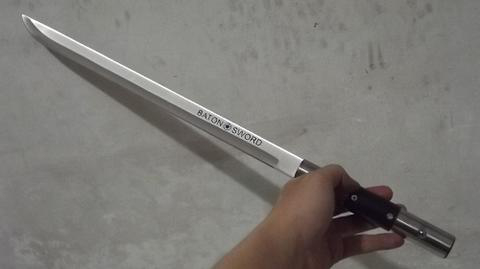

In [ ]:
readb64Recog(base64_string = sword1)

In [60]:
predictImageTerrorism(base64_str = sword1, model = model)

{'confidence': 98.38, 'result': 'pisau/pedang'}

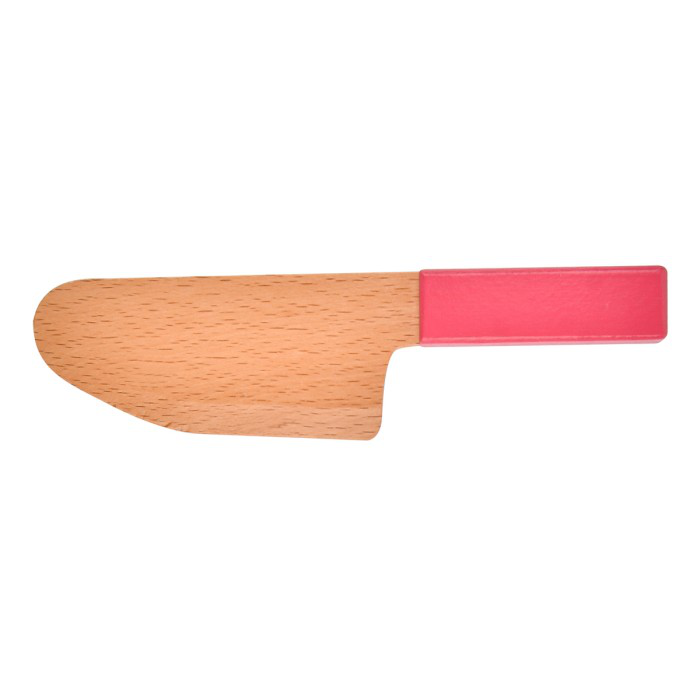

In [ ]:
readb64Recog(base64_string = sword2)

In [61]:
predictImageTerrorism(base64_str = sword2, model = model)

{'confidence': 94.55, 'result': 'pisau/pedang'}

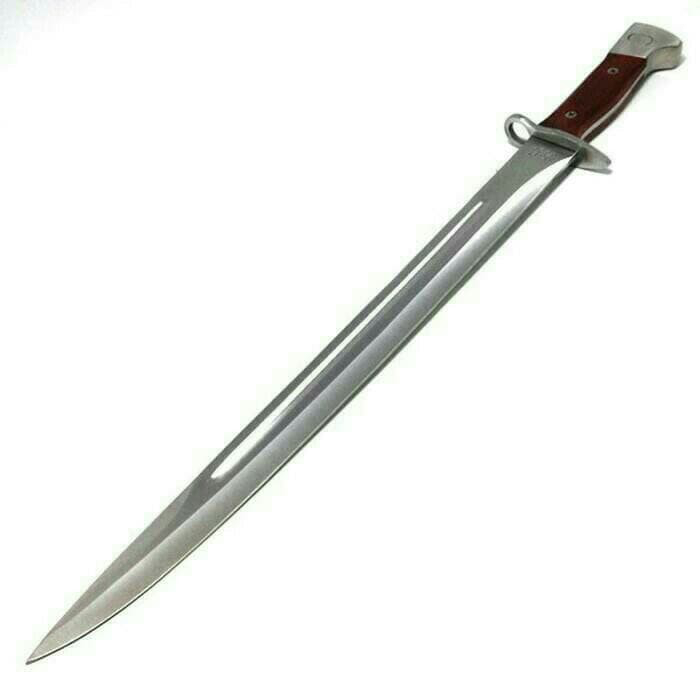

In [ ]:
readb64Recog(base64_string = sword3)

In [ ]:
predictImageTerrorism(base64_str = sword3, model = model)

{'confidenceTerrorism': 100.0, 'result': 'pisau/pedang'}

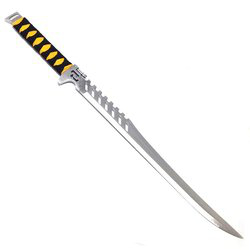

In [ ]:
readb64Recog(base64_string = sword4)

In [ ]:
predictImageTerrorism(base64_str = sword4, model = model)

{'confidenceTerrorism': 100.0, 'result': 'pisau/pedang'}

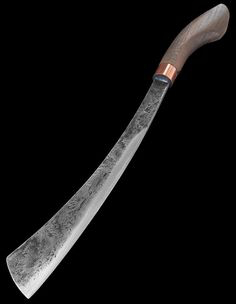

In [ ]:
readb64Recog(base64_string = sword5)

In [ ]:
predictImageTerrorism(base64_str = sword5, model = model)

{'confidenceTerrorism': 100.0, 'result': 'pisau/pedang'}

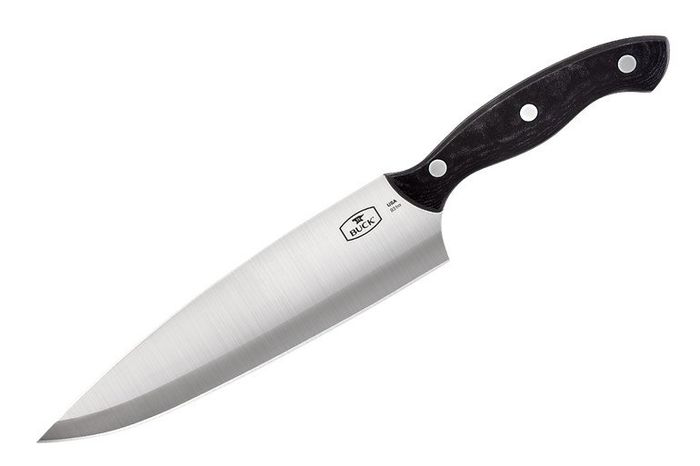

In [ ]:
readb64Recog(base64_string = sword6)

In [57]:
predictImageTerrorism(base64_str = sword6, model = model)

{'confidence': 0.0, 'result': 'none'}

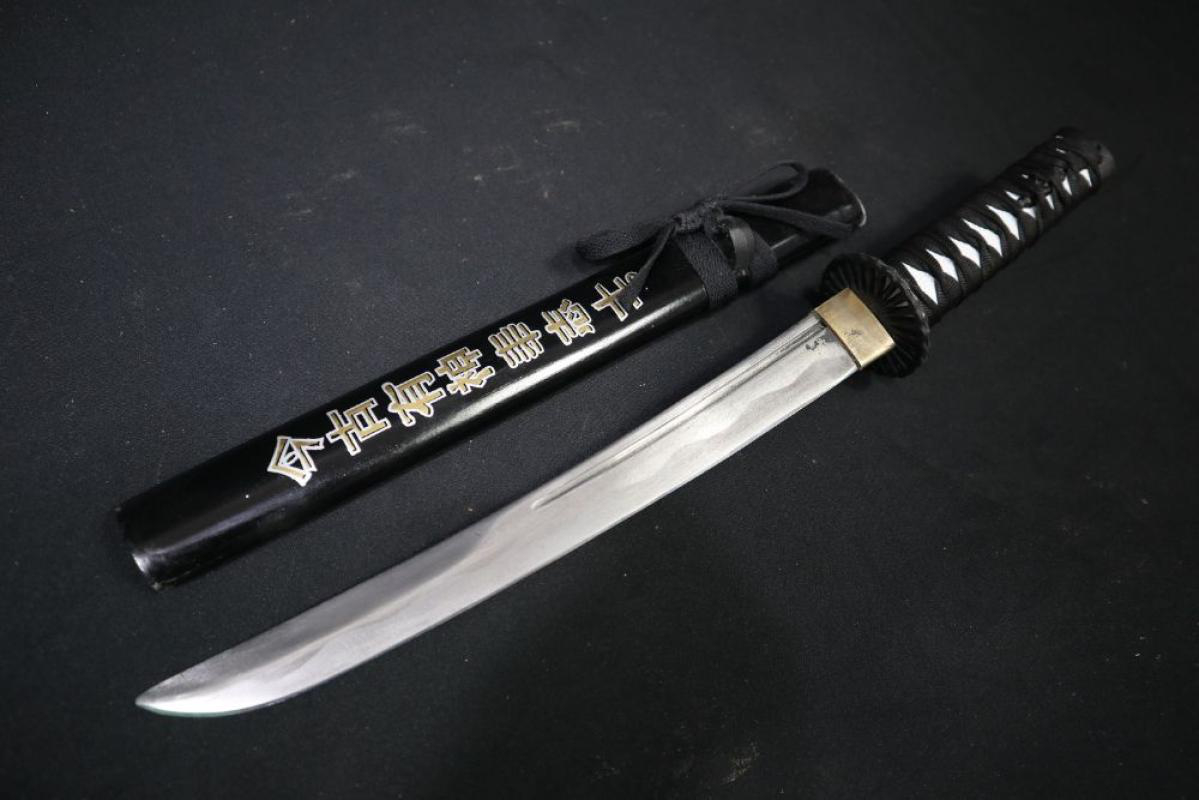

In [34]:
readb64Recog(base64_string = sword7)

In [35]:
predictImageTerrorism(base64_str = sword2, model = model)

{'confidence': 94.55, 'result': 'pisau/pedang'}

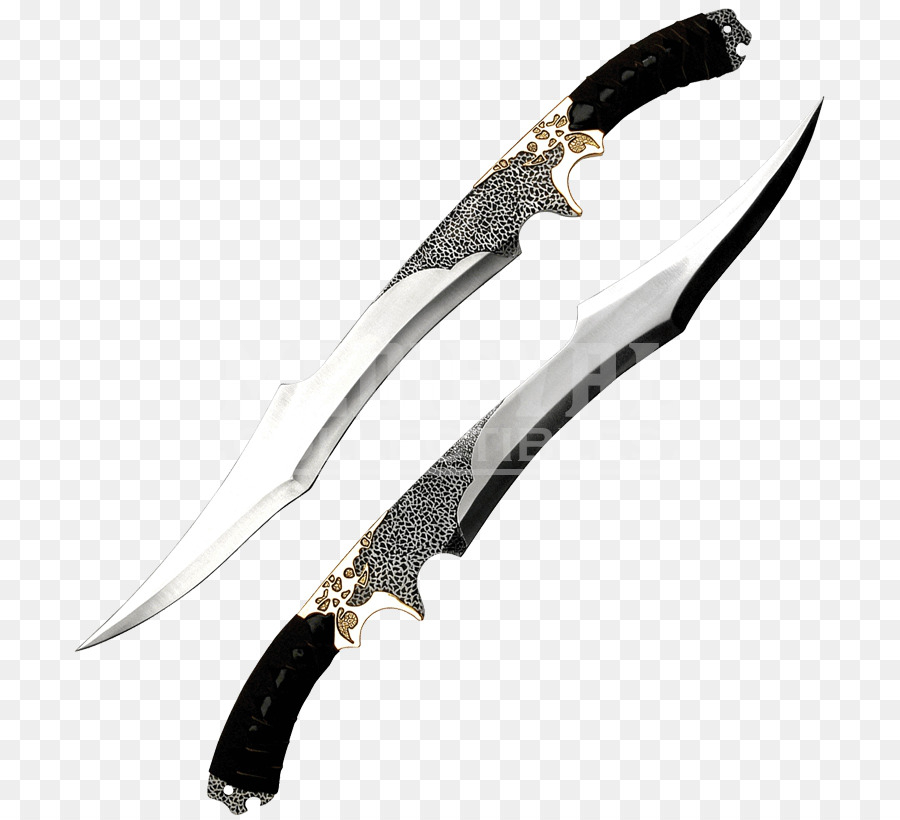

In [36]:
readb64Recog(base64_string = sword8)

In [ ]:
predictImageTerrorism(base64_str = sword8, model = model)

{'confidenceTerrorism': 100.0, 'result': 'pisau/pedang'}

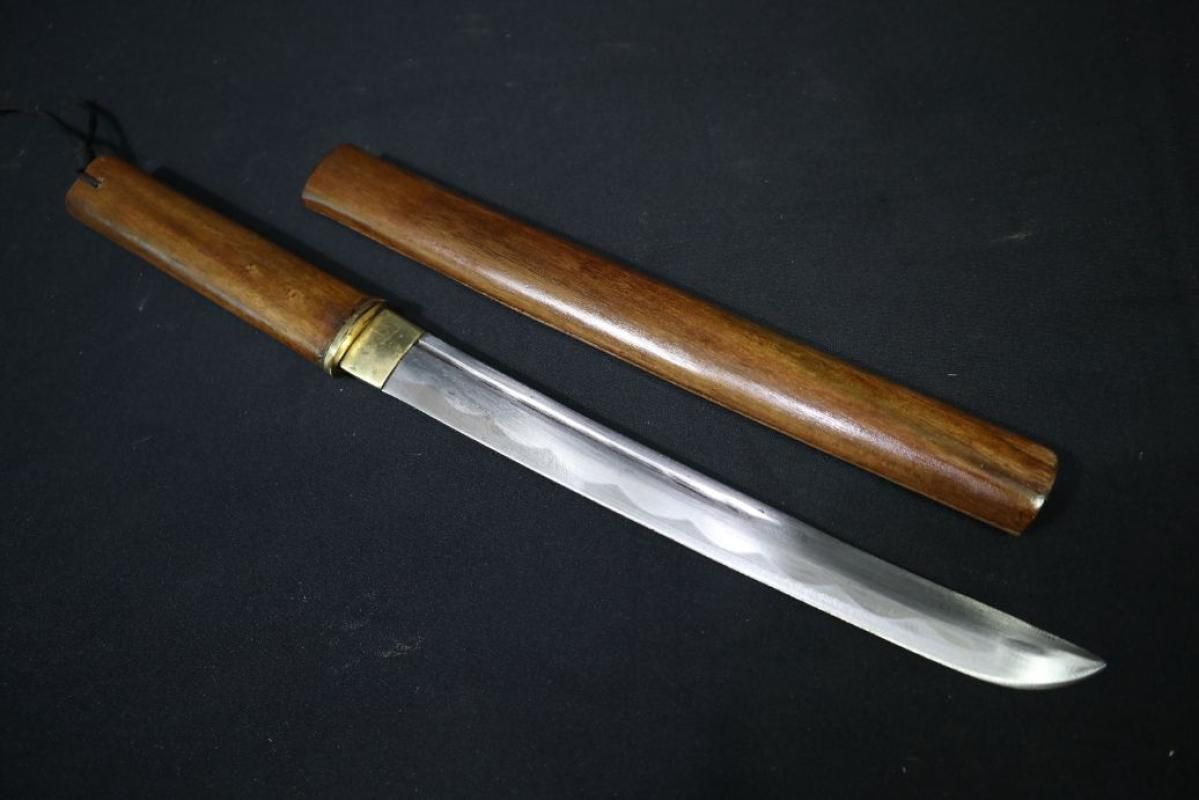

In [ ]:
readb64Recog(base64_string = sword9)

In [64]:
predictImageTerrorism(base64_str = sword9, model = model)

{'confidence': 100.0, 'result': 'pisau/pedang'}

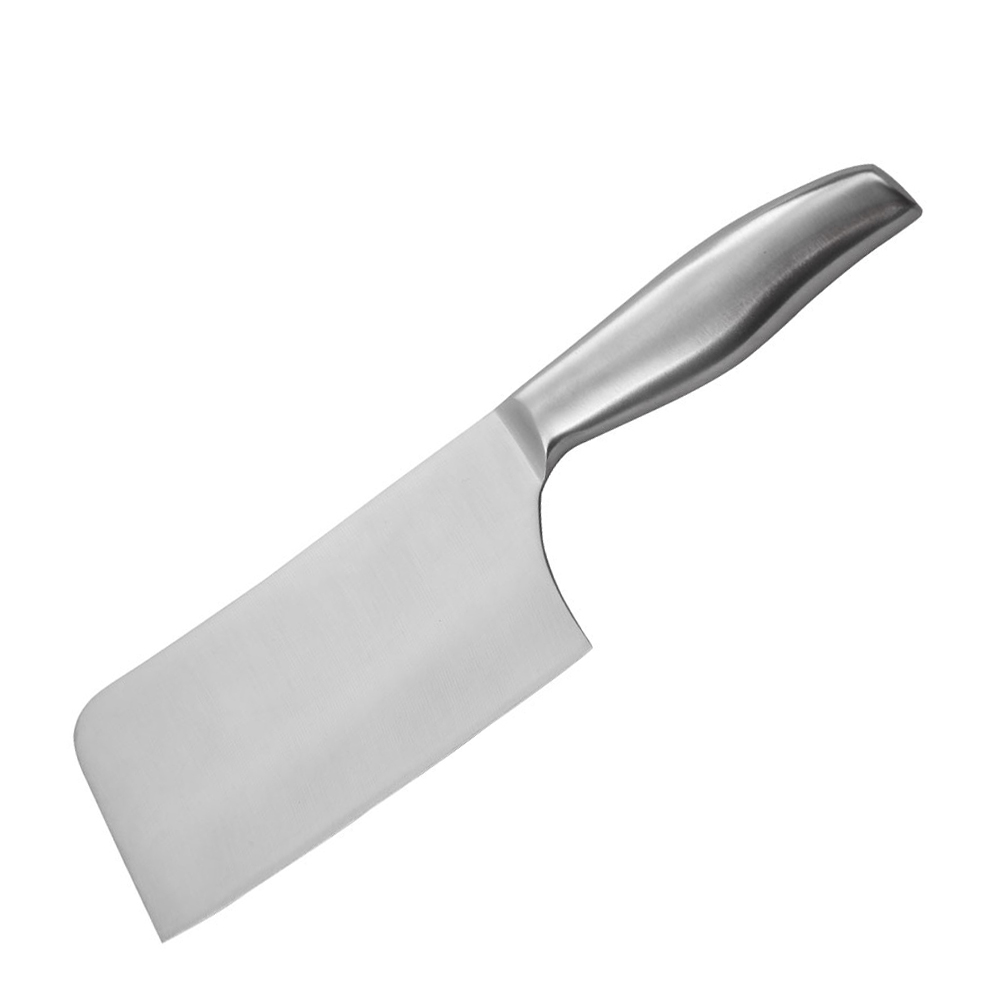

In [38]:
readb64Recog(base64_string = sword10)

In [63]:
predictImageTerrorism(base64_str = sword10, model = model)

{'confidence': 99.97, 'result': 'pisau/pedang'}

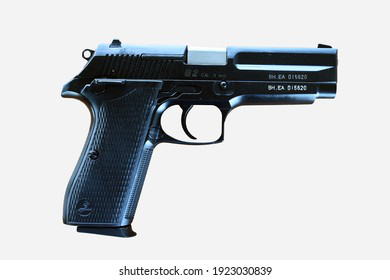

In [41]:
readb64Recog(base64_string = gun1)

In [90]:
predictImageTerrorism(base64_str = gun1, model = model)

{'confidence': 99.99, 'result': 'senjata(pistol)'}

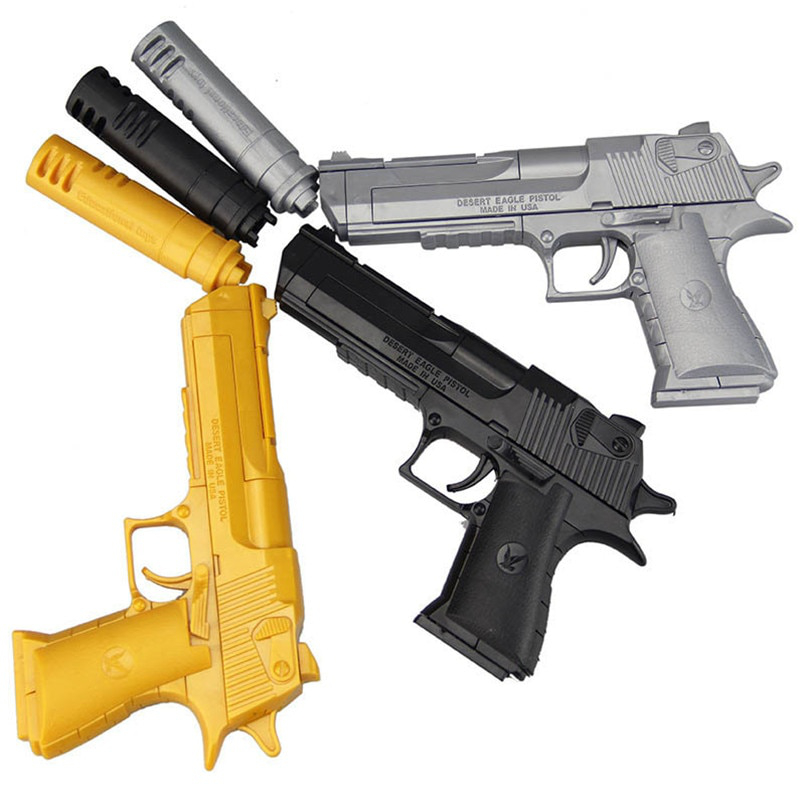

In [78]:
readb64Recog(base64_string = gun2)

In [92]:
predictImageTerrorism(base64_str = gun2, model = model)

{'confidence': 99.99, 'result': 'senjata(pistol)'}

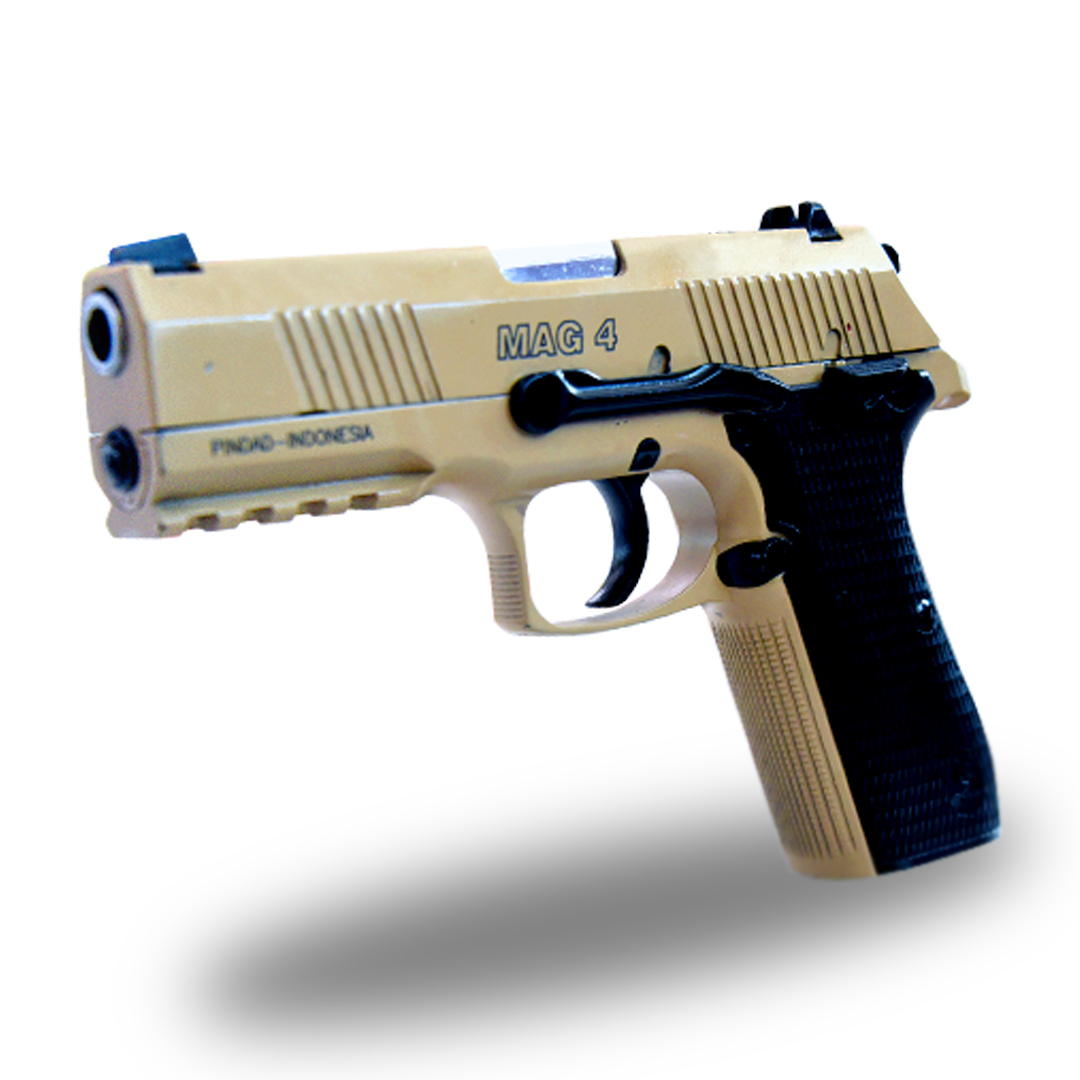

In [93]:
readb64Recog(base64_string = gun3)

In [ ]:
predictImageTerrorism(base64_str = gun3, model = model)

In [ ]:
readb64Recog(base64_string = gun4)

In [ ]:
predictImageTerrorism(base64_str = gun4, model = model)

In [ ]:
readb64Recog(base64_string = gun5)

In [ ]:
predictImageTerrorism(base64_str = gun5, model = model)

In [ ]:
readb64Recog(base64_string = gun6)

In [ ]:
predictImageTerrorism(base64_str = gun6, model = model)

In [ ]:
readb64Recog(base64_string = gun7)

In [ ]:
predictImageTerrorism(base64_str = gun7, model = model)

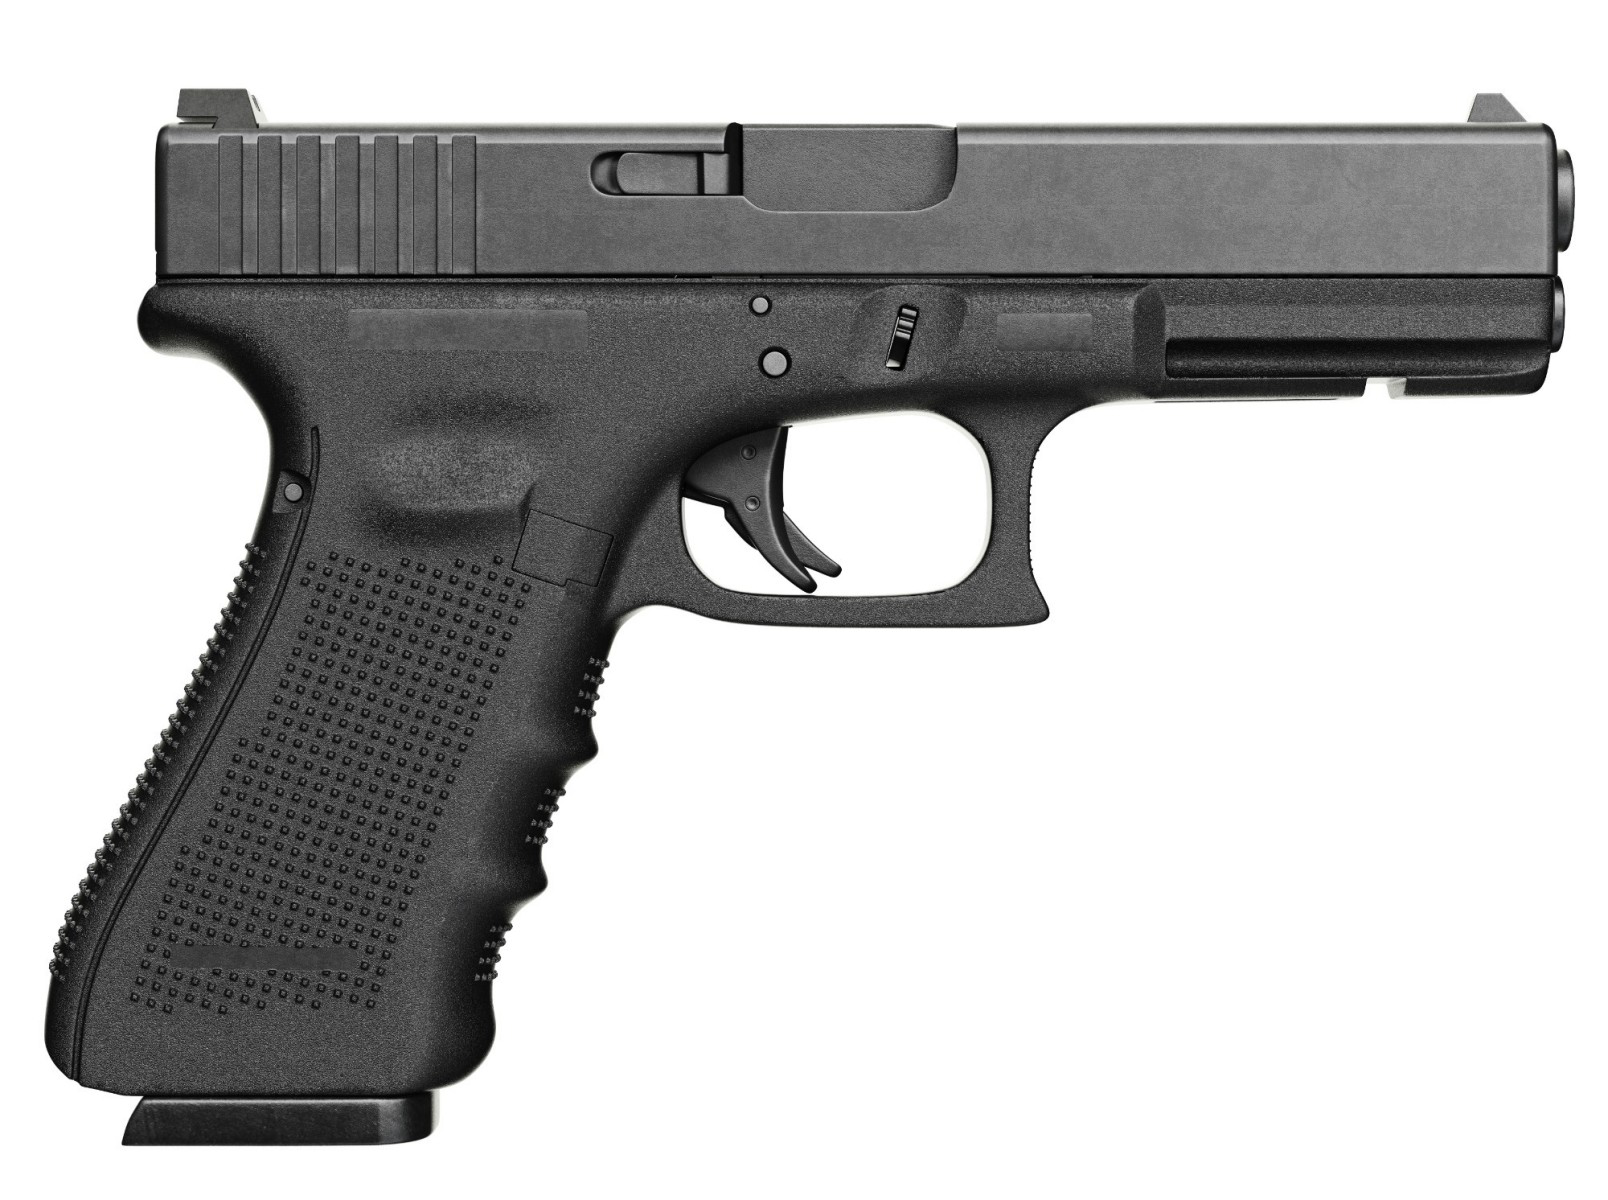

In [94]:
readb64Recog(base64_string = gun8)

In [95]:
predictImageTerrorism(base64_str = gun8, model = model)

{'confidence': 100.0, 'result': 'senjata(pistol)'}

In [ ]:
readb64Recog(base64_string = gun9)

In [ ]:
predictImageTerrorism(base64_str = gun9, model = model)

In [ ]:
readb64Recog(base64_string = gun10)

In [ ]:
predictImageTerrorism(base64_str = gun10, model = model)